# Building Models to Predict Prospective Customers for MonPG

Date: 06/09/2022

Version: 1.0

Environment: Python 3.10.5 and Anaconda 4.11.0 (64-bit)

#### Libraries used:

* Spark: A fast engine for big data processing. Combined with Python as Pyspark
* Datetime to manipulate date.
* Matplotlib to plot the data.
* Pandas to manipulate the Pandas converted dataframe.
* Numpy for converting the data into arrays for plotting it.
* Time for calculating the execution time of queries.

## 1. Data Preparation and Exploration

Before building any kind of model for the data, it is important to understand it as much as possible. We will do multiple activities in this section which will allow us to understand the data.

### 1.1. Creating the Spark Session

Before loading the data, it is important to setup the Spark environment properly. We can create a SparkContext object using Spark Session. A SparkContext object specifies the way in which Spark deals with each cluster. This object will be a part of an application whose configuration can be specified with a SparkConf object.

This configuration can be set with a unique name and the number of processor cores it must access depending upon the working processors of this local machine. Since we are dealing with a reasonably large dataset, let us increase the `maxResultSize` for the Spark configuration. We are not likely to reach that size so this is mostly just a precautionary measure. Let us setup this application with the below code:

In [1]:
# Importing the SparkConf class
from pyspark import SparkConf

# local[*]: Running Spark in local mode with as many working processors as logical cores present on the machine
master = "local[*]"

# Specifying the app name for the Spark UI page
app_name = "MonPG Top-Up Services"

# Setting up the configuration parameters for Spark
spark_conf = (SparkConf().setMaster(master).setAppName(app_name).set("spark.driver.maxResultSize", "10g"))

# Importing SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Using SparkSession to initiate the SparkContext
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/03 17:34:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Beautifying the Jupyter notebook code by hiding warnings.
import warnings
warnings.filterwarnings('ignore')

### 1.2. Loading the Data

#### 1.2.1 Schema Specifications

As a part of this activity, we must import two datasets into their respective Spark dataframes. The two dataframes to be loaded are:

* Customer: Using the `StructType()` function, we will specify the schema for the dataset to be loaded and include the schema name as a parameter while importing the data.

* Bureau: By using `inferSchema = True` as a parameter, we can allow Spark to automatically select the best datatypes for the columns inside this dataset.

In [3]:
# Importing the bureau data into a dataframe
bureau_df = spark.read.options(header='True', inferSchema='True', delimiter=',').csv("bureau.csv")

In [4]:
# Printing the schema for the bureau data
bureau_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- DATE-REPORTED: timestamp (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-DT: timestamp (nullable = true)
 |-- CLOSE-DT: timestamp (nullable = true)
 |-- LAST-PAYMENT-DATE: timestamp (nullable = true)
 |-- CREDIT-LIMIT/SANC AMT: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: string (nullable = true)
 |-- INSTALLMENT-AMT: string (nullable = true)
 |-- CURRENT-BAL: string (nullable = true)
 |-- INSTALLMENT-FREQUENCY: string (nullable = true)
 |-- OVERDUE-AMT: string (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)
 |-- ASSET_CLASS: string (nullable = true)
 |-- REPORTED DATE - HIST: string (nullable = true)
 |-- DPD - HIST: string (nullable = true)
 |-- CUR BAL - HIST: s

In [5]:
# Checking the data inside the imported bureau dataframe
bureau_df.show(5, vertical = True)

-RECORD 0-----------------------------------------
 ID                        | 1                    
 SELF-INDICATOR            | false                
 MATCH-TYPE                | PRIMARY              
 ACCT-TYPE                 | Auto Loan (Personal) 
 CONTRIBUTOR-TYPE          | NAB                  
 DATE-REPORTED             | 2019-12-31 00:00:00  
 OWNERSHIP-IND             | Individual           
 ACCOUNT-STATUS            | Active               
 DISBURSED-DT              | 2018-03-19 00:00:00  
 CLOSE-DT                  | null                 
 LAST-PAYMENT-DATE         | 2019-12-19 00:00:00  
 CREDIT-LIMIT/SANC AMT     | null                 
 DISBURSED-AMT/HIGH CREDIT | 44,000               
 INSTALLMENT-AMT           | 1,405/Monthly        
 CURRENT-BAL               | 20,797               
 INSTALLMENT-FREQUENCY     | F03                  
 OVERDUE-AMT               | null                 
 WRITE-OFF-AMT             | 0                    
 ASSET_CLASS               | St

In [6]:
# Importing pyspark sql types for forced schema specification
from pyspark.sql.types import *
 
# Defining the schema for the Customer data
schema_customer = StructType([

  StructField('ID', IntegerType(), False),
  StructField('Frequency', StringType(), False),
  StructField('InstlmentMode', StringType(), False),
  StructField('LoanStatus', StringType(), False),
  StructField('PaymentMode', StringType(), False),
  StructField('BranchID', StringType(), False),
  StructField('Area', StringType(), False),
  StructField('Tenure', IntegerType(), False),
  StructField('AssetCost', IntegerType(), False),
  StructField('AmountFinance', DoubleType(), False),
  StructField('DisbursalAmount', DoubleType(), False),
  StructField('EMI', DoubleType(), False),
  StructField('DisbursalDate', TimestampType(), False),
  StructField('MaturityDate', TimestampType(), False),
  StructField('AuthDate', TimestampType(), False),
  StructField('AssetID', StringType(), False),
  StructField('ManufacturerID', StringType(), False),
  StructField('SupplierID', StringType(), False),
  StructField('LTV', DoubleType(), False),
  StructField('Sex', StringType(), False),
  StructField('Age', IntegerType(), False),
  StructField('MonthlyIncome', DoubleType(), False),
  StructField('City', StringType(), False),
  StructField('State', StringType(), False),
  StructField('ZipCode', StringType(), False),
  StructField('Top-UpMonth', StringType(), False),
])

In [7]:
# Loading the customer data with the help of the above schema
customer_df = spark.read.csv("customer.csv", header = True, nullValue = 'NA', schema = schema_customer)

In [8]:
# Printing the schema for the customer data
customer_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- InstlmentMode: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- BranchID: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- AssetCost: integer (nullable = true)
 |-- AmountFinance: double (nullable = true)
 |-- DisbursalAmount: double (nullable = true)
 |-- EMI: double (nullable = true)
 |-- DisbursalDate: timestamp (nullable = true)
 |-- MaturityDate: timestamp (nullable = true)
 |-- AuthDate: timestamp (nullable = true)
 |-- AssetID: string (nullable = true)
 |-- ManufacturerID: string (nullable = true)
 |-- SupplierID: string (nullable = true)
 |-- LTV: double (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- MonthlyIncome: double (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZipCode: st

In [9]:
# Checking the newly imported customer data
customer_df.show(5, vertical = True)

-RECORD 0------------------------------
 ID              | 1                   
 Frequency       | Monthly             
 InstlmentMode   | Arrear              
 LoanStatus      | Closed              
 PaymentMode     | PDC_E               
 BranchID        | 1                   
 Area            | null                
 Tenure          | 48                  
 AssetCost       | 450000              
 AmountFinance   | 275000.0            
 DisbursalAmount | 275000.0            
 EMI             | 24000.0             
 DisbursalDate   | 2012-02-10 00:00:00 
 MaturityDate    | 2016-01-15 00:00:00 
 AuthDate        | 2012-02-10 00:00:00 
 AssetID         | 4022465             
 ManufacturerID  | 1568                
 SupplierID      | 21946               
 LTV             | 61.11               
 Sex             | M                   
 Age             | 49                  
 MonthlyIncome   | 35833.33            
 City            | RAISEN              
 State           | MADHYA PRADESH      


#### 1.2.2 Datatype Conversion

In this section, we are going to transform and change the data types of certain columns in the `bureau` data. The columns to be transformed are:

* `DISBURSED-AMT/HIGH CREDIT`
* `CURRENT-BAL`
* `OVERDUE-AMT`
* `INSTALLMENT-AMT`

We need to convert these columns to the Integer datatype. However, if we observe the data inside these columns, we can see that the values are a combination of numeric and non-numeric characters. Before attempting to convert the datatype of these columns, we must ensure that only contain the numerical part of the string.

We can do this with the help of the Spark `udf()` function. The UDF function is defined as follows:

In [10]:
# Importing the udf module of the pyspark library
import pyspark.sql.functions as F

# Using a udf function to remove commas
udf_num = F.udf(lambda a: ''.join(b for b in a if b.isdigit()) if a else '')

We can use the `withColumn()` function and pass the above UDF function to remove the non numerical part of the column values. After that, we can use the combination of `withColumn()` and `cast()` to convert the datatype to a numerical datatype. Let us convert them to Integer datatype:

**(For example: '50,000' → 50000)** and **(For example: '1,405/Monthly' -> 1405)**.

However, there are limitations to the kind of columns that can be fully converted to a Numeric datatype. The problematic columns in the bureau data are:

* **REPORTED DATE - HIST**
* **CUR BAL - HIST**
* **AMT OVERDUE - HIST**
* **AMT PAID - HIST**

If we observe the numeric data in these columns above, it looks like they contain more than a 100 digits separated by commas. Spark does not have a Numeric type that can contain values with those many digits. One of the Numeric datatypes in Spark is `LongType` that accomodates an 8-byte integer number from -9223372036854775808 to 9223372036854775807.

This is the maximum number of digits that can be accomodated by Spark. Furthermore, it looks like removing the non-numeric characters from these columns will remove every meaning of what these columns represent. They represent the account history for different customers.

Finally, leaving them in their current state does not allow them to be included in the modelling and machine learning process in a meaningful way. Therefore, for the ambiguity of the columns to be included, we can simply remove the non-numeric characters from these columns for now. But we may have to drop these columns entirely in the future.

In [11]:
# Applying the function to the disbursed amount column
bureau_df = bureau_df.withColumn('DISBURSED-AMT/HIGH CREDIT', udf_num('DISBURSED-AMT/HIGH CREDIT'))

# Converting the column data type to integer
bureau_df = bureau_df.withColumn("DISBURSED-AMT/HIGH CREDIT", 
                                 bureau_df["DISBURSED-AMT/HIGH CREDIT"].cast(IntegerType()))

In [12]:
# Applying the transformation function to the current balance column
bureau_df = bureau_df.withColumn('CURRENT-BAL', udf_num('CURRENT-BAL'))

# Converting the column data type to integer
bureau_df = bureau_df.withColumn("CURRENT-BAL", 
                                 bureau_df["CURRENT-BAL"].cast(IntegerType()))

In [13]:
# Applying the transformation function to the overdue amount column
bureau_df = bureau_df.withColumn('OVERDUE-AMT', udf_num('OVERDUE-AMT'))

# Converting the column data type to integer 
bureau_df = bureau_df.withColumn("OVERDUE-AMT", 
                                 bureau_df["OVERDUE-AMT"].cast(IntegerType()))

In [14]:
# Applying the transformation function to the installment amount column
bureau_df = bureau_df.withColumn("INSTALLMENT-AMT", udf_num('INSTALLMENT-AMT'))

# Updating the datatype for the installment amount column
bureau_df = bureau_df.withColumn("INSTALLMENT-AMT", bureau_df["INSTALLMENT-AMT"].cast(IntegerType()))

In [15]:
# Applying the transformation function to the installment amount column
bureau_df = bureau_df.withColumn("REPORTED DATE - HIST", udf_num('REPORTED DATE - HIST'))

# Updating the datatype for the installment amount column
#bureau_df = bureau_df.withColumn("REPORTED DATE - HIST", bureau_df["REPORTED DATE - HIST"].cast(LongType()))

In [16]:
# Applying the transformation function to the installment amount column
bureau_df = bureau_df.withColumn("CUR BAL - HIST", udf_num('CUR BAL - HIST'))

# Updating the datatype for the installment amount column
#bureau_df = bureau_df.withColumn("CUR BAL - HIST", bureau_df["CUR BAL - HIST"].cast(LongType()))

In [17]:
# Applying the transformation function to the installment amount column
bureau_df = bureau_df.withColumn("AMT OVERDUE - HIST", udf_num('AMT OVERDUE - HIST'))

# Updating the datatype for the installment amount column
#bureau_df = bureau_df.withColumn("AMT OVERDUE - HIST", bureau_df["AMT OVERDUE - HIST"].cast(LongType()))

In [18]:
# Applying the transformation function to the installment amount column
bureau_df = bureau_df.withColumn("AMT PAID - HIST", udf_num('AMT PAID - HIST'))

# Updating the datatype for the installment amount column
#bureau_df = bureau_df.withColumn("AMT PAID - HIST", bureau_df["AMT PAID - HIST"].cast(LongType()))

In [19]:
# Checking the transformed columns
bureau_df.show(vertical = True)

-RECORD 0-----------------------------------------
 ID                        | 1                    
 SELF-INDICATOR            | false                
 MATCH-TYPE                | PRIMARY              
 ACCT-TYPE                 | Auto Loan (Personal) 
 CONTRIBUTOR-TYPE          | NAB                  
 DATE-REPORTED             | 2019-12-31 00:00:00  
 OWNERSHIP-IND             | Individual           
 ACCOUNT-STATUS            | Active               
 DISBURSED-DT              | 2018-03-19 00:00:00  
 CLOSE-DT                  | null                 
 LAST-PAYMENT-DATE         | 2019-12-19 00:00:00  
 CREDIT-LIMIT/SANC AMT     | null                 
 DISBURSED-AMT/HIGH CREDIT | 44000                
 INSTALLMENT-AMT           | 1405                 
 CURRENT-BAL               | 20797                
 INSTALLMENT-FREQUENCY     | F03                  
 OVERDUE-AMT               | null                 
 WRITE-OFF-AMT             | 0                    
 ASSET_CLASS               | St

In [20]:
# Printing the updated schema
bureau_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- DATE-REPORTED: timestamp (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-DT: timestamp (nullable = true)
 |-- CLOSE-DT: timestamp (nullable = true)
 |-- LAST-PAYMENT-DATE: timestamp (nullable = true)
 |-- CREDIT-LIMIT/SANC AMT: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: integer (nullable = true)
 |-- INSTALLMENT-AMT: integer (nullable = true)
 |-- CURRENT-BAL: integer (nullable = true)
 |-- INSTALLMENT-FREQUENCY: string (nullable = true)
 |-- OVERDUE-AMT: integer (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)
 |-- ASSET_CLASS: string (nullable = true)
 |-- REPORTED DATE - HIST: string (nullable = true)
 |-- DPD - HIST: string (nullable = true)
 |-- CUR BAL - HIS

#### 1.2.3 Handling NULL Values in the Customer Data

Starting with the Customer dataset, we are going to start handling the NULL data here. Firstly, we need to remove all those rows from the customer data which contain at least one NULL value in any of the columns. Let us start by checking the total number of rows in the customer data.

In [21]:
# Counting the total number of rows in the customer data
print('The customer data contains:', customer_df.count(), 'rows')

The customer data contains: 143400 rows


Since there is no straighforward method to find the number of NULL rows, we must use a different approach. One of the ways to do this is to use `reduce()` from the `functools` library. This function takes a function, in this case `isNull()` and an iterable, which is the rows of the Customer data. It applies this function to the iterable and returns the result. 

Using this function, we get:

In [22]:
# Importing the reduce method from the functools library
from functools import reduce


# Rechecking the row count
print('The number of rows in the Customer data that contain null values are:', 
      customer_df.where(reduce(lambda a, b: a | b, (F.col(a).isNull() for a in customer_df.columns))).count())

The number of rows in the Customer data that contain null values are: 22092


It looks like we have a sizable number of rows in the Customer data which have atleast one NULL value. We can remove them in the next step. Removing NULL values in a Spark dataframe is relatively easier as we can simply use the `na.drop()` function to remove them straightaway.

In [23]:
# Dropping all rows with null values
customer_df = customer_df.na.drop()

# Rechecking the row count
print('The updated row count of the customer dataset is:', customer_df.count())

The updated row count of the customer dataset is: 121308


#### 1.2.4 Handling NULL Columns in the Bureau Data

We are going to handle the NULL values in the Bureau data slightly diffently. We need to remove those columns from the data where the percentage of NULL values is more than 20%. First, we must find the percentage of NULL values in each column. 

There is an assortment of Pyspark sql functions that can be used to do this task. These include `round()`, `count()`, `when()` and `col()`. The below code counts the number of NULL values in each column, multiplies it by 100 and divides it by the total number of rows in the dataset. Finally, the `round()` method rounds off the result to two decimal places.

For the purposes of the next step in this activity, we can store this result in a new variable.

In [24]:
# Computing the percentage of NULL values in each column
bureau_null = bureau_df.select([(F.round(F.count(F.when(F.col(c).isNull(),c))*100/bureau_df.count(), 2)).alias(c) 
                  for c in bureau_df.columns])

# Printing the result
bureau_null.show(vertical = True)

-RECORD 0--------------------------
 ID                        | 0.0   
 SELF-INDICATOR            | 0.0   
 MATCH-TYPE                | 0.0   
 ACCT-TYPE                 | 0.0   
 CONTRIBUTOR-TYPE          | 0.0   
 DATE-REPORTED             | 0.59  
 OWNERSHIP-IND             | 0.0   
 ACCOUNT-STATUS            | 0.0   
 DISBURSED-DT              | 5.15  
 CLOSE-DT                  | 45.32 
 LAST-PAYMENT-DATE         | 56.31 
 CREDIT-LIMIT/SANC AMT     | 97.32 
 DISBURSED-AMT/HIGH CREDIT | 0.01  
 INSTALLMENT-AMT           | 74.93 
 CURRENT-BAL               | 0.04  
 INSTALLMENT-FREQUENCY     | 75.76 
 OVERDUE-AMT               | 21.13 
 WRITE-OFF-AMT             | 3.47  
 ASSET_CLASS               | 53.66 
 REPORTED DATE - HIST      | 0.0   
 DPD - HIST                | 3.55  
 CUR BAL - HIST            | 0.0   
 AMT OVERDUE - HIST        | 0.0   
 AMT PAID - HIST           | 0.0   
 TENURE                    | 65.77 



We have a handful of columns where the percentage of NULL values is more than 20. To remove them, we can define a function that compares the column names in the NULL percentage dataframe with the column names in the original Bureau dataframe. For the columns in the NULL percentage dataframe where the value is more than 20, the column with the same name will be removed from the bureau dataframe.

In [25]:
# Defining a function to remove NULLs from the bureau data
def rem_null(data, null_percent):
    
    # Specifying the names of the columns to be checked
    null_percent_schema = null_percent.schema.fields
    
    null_percent_names = [x.name for x in null_percent_schema]
    
    # Iterating through the names of the columns
    for name in null_percent_names:
        
        # Checking if the value under each column is greater than 20
        if null_percent.filter(F.col(name) > 20).count() == 1:
            
            data = data.drop(F.col(name))
            
    return data

# Calling the above function
bureau_df = rem_null(bureau_df, bureau_null)

Let us check if the correct columns have been removed from the data.

In [26]:
# Checking the altered dataframe
bureau_df.show(vertical = True)

-RECORD 0-----------------------------------------
 ID                        | 1                    
 SELF-INDICATOR            | false                
 MATCH-TYPE                | PRIMARY              
 ACCT-TYPE                 | Auto Loan (Personal) 
 CONTRIBUTOR-TYPE          | NAB                  
 DATE-REPORTED             | 2019-12-31 00:00:00  
 OWNERSHIP-IND             | Individual           
 ACCOUNT-STATUS            | Active               
 DISBURSED-DT              | 2018-03-19 00:00:00  
 DISBURSED-AMT/HIGH CREDIT | 44000                
 CURRENT-BAL               | 20797                
 WRITE-OFF-AMT             | 0                    
 REPORTED DATE - HIST      | 20191231201911302... 
 DPD - HIST                | 00000000000000000... 
 CUR BAL - HIST            | 20797219882317424... 
 AMT OVERDUE - HIST        | 1452                 
 AMT PAID - HIST           |                      
-RECORD 1-----------------------------------------
 ID                        | 1 

#### 1.2.5 Removing Unwanted Columns

In this section, we are going to remove some of the columns from the bureau data that will not be relevant to the machine learning process. The names of the columns to be removed are:

* **DISBURSED-DT**
* **REPORTED DATE - HIST**
* **DPD - HIST**
* **CUR BAL - HIST**
* **AMT OVERDUE - HIST**
* **AMT PAID - HIST** 

As discussed earlier, it is very difficult to deal with these columns as they could not be properly converted into a numeric datatype that is supported by Spark. Furthermore, no meaning can be derived from them in their current form for the modelling process.

We can remove these columns with a single function. That function is defined as follows:

In [27]:
# Function to remove the unwanted columns from bureau
def unwanted_rem(data):
    
    # Extracting the list of column names
    data_schema = data.schema.fields
    
    # Accessing each column name inside the above list
    data_names = [x.name for x in data_schema]
    
    # Iterating through the column names
    for name in data_names:
        
        # Searching for specific column names
        if 'HIST' in name or 'DATE' in name or 'DT' in name:
            
            # Dropping the selected columns
            data = data.drop(F.col(name))
            
    return data

# Calling the above column removal function
bureau_df = unwanted_rem(bureau_df)

In [28]:
# Checking the altered dataframe
bureau_df.show(vertical = True)

-RECORD 0-----------------------------------------
 ID                        | 1                    
 SELF-INDICATOR            | false                
 MATCH-TYPE                | PRIMARY              
 ACCT-TYPE                 | Auto Loan (Personal) 
 CONTRIBUTOR-TYPE          | NAB                  
 OWNERSHIP-IND             | Individual           
 ACCOUNT-STATUS            | Active               
 DISBURSED-AMT/HIGH CREDIT | 44000                
 CURRENT-BAL               | 20797                
 WRITE-OFF-AMT             | 0                    
-RECORD 1-----------------------------------------
 ID                        | 1                    
 SELF-INDICATOR            | false                
 MATCH-TYPE                | PRIMARY              
 ACCT-TYPE                 | Overdraft            
 CONTRIBUTOR-TYPE          | NAB                  
 OWNERSHIP-IND             | Individual           
 ACCOUNT-STATUS            | Delinquent           
 DISBURSED-AMT/HIGH CREDIT | 37

We now have those rows and columns from the raw data that we want to utilise in the machine learning activity. We can start preparing this data for developing our models.

### 1.3 Exploring the Data

#### 1.3.1 Basic Statistics

Let us start by observing some basic statistics about the two datasets. We must handle the `numeric` and `non-numeric` columns of each dataset separately. We can exclude the columns `ID` and `Top-up Month` from the search. For the `numeric columns`, we can execute the below steps:

* Use a broadcast variable to get all those columns which have some kind of numeric datatype. The `isinstance()` method will help us do that. 

* Implement the `.describe()` method to display all the descriptive statistics for the above numeric columns.

For the `non-numeric columns`, we need to showcase the top ten features in each column with their respective counts. The top ten features are represented in terms of their value counts. To implement this, we must execute the below steps:

* Define a function to capture the non-numerical columns, group by and aggregate them by counting the number of instances for each group, sorting the count in descending order and showing the top 10 values.

* Call the above function.

First, we do the above activity for the bureau data followed by the customer data.

In [29]:
# Collecting columns that have a numeric datatype in the bureau dataframe
bureau_numeric = [x.name for x in bureau_df.schema.fields if isinstance(x.dataType, IntegerType) 
                  | isinstance(x.dataType, DoubleType) | isinstance(x.dataType, FloatType)][1:]

# Printing the descriptive statistics for the numerical columns in the bureau dataframe
bureau_df.select(*bureau_numeric).describe().show(vertical = True)

-RECORD 0---------------------------------------
 summary                   | count              
 DISBURSED-AMT/HIGH CREDIT | 624825             
 CURRENT-BAL               | 624598             
 WRITE-OFF-AMT             | 603179             
-RECORD 1---------------------------------------
 summary                   | mean               
 DISBURSED-AMT/HIGH CREDIT | 316589.65462809586 
 CURRENT-BAL               | 104084.19414727553 
 WRITE-OFF-AMT             | 291.3442643062839  
-RECORD 2---------------------------------------
 summary                   | stddev             
 DISBURSED-AMT/HIGH CREDIT | 5176936.430282681  
 CURRENT-BAL               | 851042.7779954061  
 WRITE-OFF-AMT             | 19561.752315897807 
-RECORD 3---------------------------------------
 summary                   | min                
 DISBURSED-AMT/HIGH CREDIT | 0                  
 CURRENT-BAL               | 0                  
 WRITE-OFF-AMT             | -30                
-RECORD 4-----------

In [30]:
# Function to display the top ten non-numerical features and their value counts
def top_value_counts(data):
    
    # Extracting the non-numerical feature names
    data_string = [x.name for x in data.schema.fields if not isinstance(x.dataType, IntegerType) 
                  | isinstance(x.dataType, DoubleType) | isinstance(x.dataType, FloatType)]
    
    # Iterating through the non-numerical column names
    for name in data_string:
        
        # Finding and displaying the top ten features
        data.groupBy(name).agg(F.count(name).alias("count")).sort(F.desc("count")).show(10)

In [31]:
# Calling the above function to display the top ten features
top_value_counts(bureau_df)

+--------------+------+
|SELF-INDICATOR| count|
+--------------+------+
|         false|442851|
|          true|182012|
+--------------+------+

+----------+------+
|MATCH-TYPE| count|
+----------+------+
|   PRIMARY|624638|
| SECONDARY|   225|
+----------+------+

+--------------------+------+
|           ACCT-TYPE| count|
+--------------------+------+
|        Tractor Loan|208051|
|           Gold Loan| 98602|
|Business Loan Pri...| 88274|
|   Kisan Credit Card| 37621|
|Auto Loan (Personal)| 33504|
|               Other| 31729|
|Commercial Vehicl...| 21296|
|    Two-Wheeler Loan| 17656|
|         Credit Card| 14397|
|       Consumer Loan| 13769|
+--------------------+------+
only showing top 10 rows

+----------------+------+
|CONTRIBUTOR-TYPE| count|
+----------------+------+
|             NBF|286311|
|             NAB|191368|
|             PRB| 84392|
|             COP| 26853|
|             RRB| 26374|
|             MFI|  3676|
|             HFC|  3174|
|             CCC|  1651|
| 

In [32]:
# Storing the names of the numeric columns in the Customer data
customer_numeric = [c.name for c in customer_df.schema.fields if isinstance(c.dataType, IntegerType) 
                  | isinstance(c.dataType, DoubleType) | isinstance(c.dataType, FloatType)][1:]


# Printing the summary statistics for the numeric columns in the customer data
customer_df.select(*customer_numeric).describe().show(vertical = True)

-RECORD 0-----------------------------
 summary         | count              
 Tenure          | 121308             
 AssetCost       | 121308             
 AmountFinance   | 121308             
 DisbursalAmount | 121308             
 EMI             | 121308             
 LTV             | 121308             
 Age             | 121308             
 MonthlyIncome   | 121308             
-RECORD 1-----------------------------
 summary         | mean               
 Tenure          | 42.75597652257065  
 AssetCost       | 563289.852482936   
 AmountFinance   | 356361.52626380784 
 DisbursalAmount | 356002.3838225838  
 EMI             | 56821.715147310984 
 LTV             | 59.62412924127014  
 Age             | 40.70355623701652  
 MonthlyIncome   | 51901.61362465795  
-RECORD 2-----------------------------
 summary         | stddev             
 Tenure          | 22.433473986085684 
 AssetCost       | 103558.845010007   
 AmountFinance   | 105717.74807158229 
 DisbursalAmount | 105537

In [33]:
# Calling the value count function for the non-numerical columns of the customer data
top_value_counts(customer_df.drop(F.col('Top-UpMonth')))

+-----------+-----+
|  Frequency|count|
+-----------+-----+
|Half Yearly|78986|
|    Monthly|22535|
|    Quatrly|19482|
| BI-Monthly|  305|
+-----------+-----+

+-------------+------+
|InstlmentMode| count|
+-------------+------+
|       Arrear|116999|
|      Advance|  4309|
+-------------+------+

+----------+-----+
|LoanStatus|count|
+----------+-----+
|    Closed|86260|
|    Active|35048|
+----------+-----+

+------------+-----+
| PaymentMode|count|
+------------+-----+
|         ECS|33078|
|Direct Debit|32545|
|         PDC|25951|
|      Billed|17668|
|       PDC_E| 9398|
|  Auto Debit|  905|
|   SI Reject|  803|
|      Cheque|  489|
|  ECS Reject|  457|
|  PDC Reject|    7|
+------------+-----+
only showing top 10 rows

+--------+-----+
|BranchID|count|
+--------+-----+
|      24| 4534|
|     199| 4391|
|     166| 2464|
|      50| 2348|
|     202| 2234|
|     263| 2154|
|      41| 1935|
|     246| 1934|
|      85| 1854|
|     133| 1837|
+--------+-----+
only showing top 10 rows

+

#### 1.3.2 Sum and Distinct

Based on the basic statistics we used to observe the data, it looks like there is too much raw data in the bureau dataframe which may contribute to potential noise in our models. Therefore, in this section, we are going to transform the bureau data in such a way that we can attain some of its most important aspects.

As was the case earlier, we will use the broadcast variable to target the numerical and non-numerical columns of the data separately. We must utilise multiple Pyspark sql functions and cast a broadcast variable across all the specified columns to transform them simultaneously.

* For the numerical columns, we can group them by the `ID` column and sum all the values in each column. We can use the alias `_sum` to identify them.
* For the non-numerical columns, we can group them in the same manner but the aggregation of values in each group will be based on the count rather than the sum. We can use `_dist` as an alias to identify them.
* Once the two separately grouped dataframes have been created, we can join them with the help of the ID column.

Since we are performing different kinds of aggregation on the columns, for each grouping and aggregation, we can store each group in its own separate dataframe.

In [34]:
# Creating a new dataframe with aggregated sum of numerical columns for each ID
bureau_groups_numerical = bureau_df.groupBy("ID").agg(*(F.sum(F.col(column.name)).alias(column.name + '_sum') 
                                              for column in bureau_df.schema.fields if column.name != 'ID' and 
                                              (isinstance(column.dataType, IntegerType) or 
                                               isinstance(column.dataType, DoubleType)))).sort('ID')

# Checking the newly created dataframe
bureau_groups_numerical.show()

+---+-----------------------------+---------------+-----------------+
| ID|DISBURSED-AMT/HIGH CREDIT_sum|CURRENT-BAL_sum|WRITE-OFF-AMT_sum|
+---+-----------------------------+---------------+-----------------+
|  1|                      2201352|         618526|                0|
|  2|                     18117081|       10349457|                0|
|  3|                      3708369|        2065165|                0|
|  4|                      2964588|        2191274|                0|
|  5|                      1939813|         907231|                0|
|  6|                      3237361|         102800|                0|
|  7|                      1272553|         624000|                0|
|  8|                      2025216|         974119|                0|
|  9|                       280000|              0|                0|
| 10|                      1164268|         283723|                0|
| 11|                     10857036|        3926740|                0|
| 12|               

In [35]:
# Creating a new dataframe with aggregated counts of non numerical columns for each ID
bureau_groups_non_numerical = bureau_df.groupBy("ID").agg(*(F.countDistinct(F.col(column.name)).alias(column.name + '_dist') 
                                              for column in bureau_df.schema.fields if column.name != 'ID' and 
                                              (not isinstance(column.dataType, IntegerType) or 
                                               isinstance(column.dataType, DoubleType)))).sort('ID')

# Checking the newly created dataframe
bureau_groups_non_numerical.show()

+---+-------------------+---------------+--------------+---------------------+------------------+-------------------+
| ID|SELF-INDICATOR_dist|MATCH-TYPE_dist|ACCT-TYPE_dist|CONTRIBUTOR-TYPE_dist|OWNERSHIP-IND_dist|ACCOUNT-STATUS_dist|
+---+-------------------+---------------+--------------+---------------------+------------------+-------------------+
|  1|                  2|              1|             4|                    2|                 1|                  3|
|  2|                  2|              1|             7|                    2|                 2|                  2|
|  3|                  2|              1|             8|                    5|                 3|                  3|
|  4|                  2|              1|             4|                    3|                 2|                  2|
|  5|                  2|              1|             5|                    4|                 2|                  2|
|  6|                  2|              1|             4|

We have individually grouped the numerical and non-numerical columns of the bureau data. In this step, we are going to merge them by using an Inner join. The joining column is the `ID` column. 

First, let us rename the `ID` column for one of the dataframes for convenience of removing the extra column after the joining operation has been completed.

In [36]:
# Renaming the ID column in one of the grouped dataframes
bureau_groups_non_numerical = bureau_groups_non_numerical.withColumnRenamed("ID","ID2")

In [37]:
# Joining the two aggregated dataframes on ID and dropping the extra column
bureau_groups_joined = bureau_groups_numerical.join(bureau_groups_non_numerical, 
                                                    bureau_groups_numerical.ID 
                                                    == bureau_groups_non_numerical.ID2, "inner").drop('ID2')

# Checking the joined dataframe
bureau_groups_joined.show(vertical = True)

-RECORD 0---------------------------------
 ID                            | 463      
 DISBURSED-AMT/HIGH CREDIT_sum | 220000   
 CURRENT-BAL_sum               | 0        
 WRITE-OFF-AMT_sum             | 0        
 SELF-INDICATOR_dist           | 1        
 MATCH-TYPE_dist               | 1        
 ACCT-TYPE_dist                | 1        
 CONTRIBUTOR-TYPE_dist         | 1        
 OWNERSHIP-IND_dist            | 1        
 ACCOUNT-STATUS_dist           | 1        
-RECORD 1---------------------------------
 ID                            | 1591     
 DISBURSED-AMT/HIGH CREDIT_sum | 750000   
 CURRENT-BAL_sum               | 0        
 WRITE-OFF-AMT_sum             | 0        
 SELF-INDICATOR_dist           | 2        
 MATCH-TYPE_dist               | 1        
 ACCT-TYPE_dist                | 2        
 CONTRIBUTOR-TYPE_dist         | 1        
 OWNERSHIP-IND_dist            | 1        
 ACCOUNT-STATUS_dist           | 2        
-RECORD 2---------------------------------
 ID        

#### 1.3.3 Inner Join

We have completed the preprocessing activity with respect to the bureau data. We have a final dataframe with different columns to represent the original bureau data. We can now merge this transformed dataframe with the Customer dataframe. We need to implement two operations here:

* Join the bureau dataframe to the customer dataframe
* Change the Top-upMonth column into a new Top-up column that contains only two distinct values, 0 and 1 representing `No top-up` and `Top-up` respectively.

Similar to how we handled the two grouped dataframes, we can join the bureau data with the customer data by using an Inner join. The joining column here is `ID` as was the case earlier.

Therefore, we can rename this column for one of the dataframes for the convenience of dropping it.

In [38]:
# Renaming the ID column in the customer dataset for convenience
customer_new = customer_df.withColumnRenamed("ID","ID2")

In [39]:
# Joining the two aggregated dataframes on ID
cust_bureau_df = bureau_groups_joined.join(customer_new, 
                                           bureau_groups_joined.ID == customer_new.ID2, "inner").drop('ID2')

# Checking the joined dataframe
cust_bureau_df.show(vertical = True)

-RECORD 0--------------------------------------------
 ID                            | 12                  
 DISBURSED-AMT/HIGH CREDIT_sum | 400000              
 CURRENT-BAL_sum               | 0                   
 WRITE-OFF-AMT_sum             | 0                   
 SELF-INDICATOR_dist           | 1                   
 MATCH-TYPE_dist               | 1                   
 ACCT-TYPE_dist                | 1                   
 CONTRIBUTOR-TYPE_dist         | 1                   
 OWNERSHIP-IND_dist            | 1                   
 ACCOUNT-STATUS_dist           | 1                   
 Frequency                     | Monthly             
 InstlmentMode                 | Arrear              
 LoanStatus                    | Closed              
 PaymentMode                   | PDC                 
 BranchID                      | 5                   
 Area                          | RAIPUR              
 Tenure                        | 46                  
 AssetCost                  

We have a properly joined dataframe as indicated by the above output. To change the column `Top-upMonth`, it would be much more convenient to rename it such that it does not have a special character in its name. That way, we can simply use the `when()` pyspark sql function to transform this column.

The `when()` function will check if the value `Top-upMonth` indicates a no top-up service in which case, it will assign the value 0 and 1 otherwise. With our new and improved column being created, we can drop the original Top-upMonth column from the data.

In [40]:
# Renaming the top up column in the dataset for convenience
cust_bureau_df = cust_bureau_df.withColumnRenamed("Top-UpMonth","TopUp")

In [41]:
# Creating a new top-up column for the combined data
cust_bureau_df = cust_bureau_df.withColumn('Top-up', 
                                           F.when(cust_bureau_df.TopUp == "No Top-up Service", 0)\
                                           .otherwise(1))\
                                           .drop('TopUp')
# Printing the result
cust_bureau_df.show(vertical = True)

-RECORD 0--------------------------------------------
 ID                            | 12                  
 DISBURSED-AMT/HIGH CREDIT_sum | 400000              
 CURRENT-BAL_sum               | 0                   
 WRITE-OFF-AMT_sum             | 0                   
 SELF-INDICATOR_dist           | 1                   
 MATCH-TYPE_dist               | 1                   
 ACCT-TYPE_dist                | 1                   
 CONTRIBUTOR-TYPE_dist         | 1                   
 OWNERSHIP-IND_dist            | 1                   
 ACCOUNT-STATUS_dist           | 1                   
 Frequency                     | Monthly             
 InstlmentMode                 | Arrear              
 LoanStatus                    | Closed              
 PaymentMode                   | PDC                 
 BranchID                      | 5                   
 Area                          | RAIPUR              
 Tenure                        | 46                  
 AssetCost                  

This is our final dataset to be utilised for the modelling process.

#### 1.3.4 Visualisation

Before modelling the combined data, it is important to visualise it to understand it better. Since we are going to predict whether a customer opts for a top-up service or not, we need to understand how the different features are related to the `Top-up` column and each other.

Matplotlib is a powerful python library for making detailed visualisations. For the purposes of visualisation, we are going to convert the Spark dataframe into Pandas wherever necessary to make use of the different functionalities available with Pandas and Matplotlib.

Since we have a collection of numeric and non-numeric variables in our data, we need to devise different plots to understand them better. 

For the numerical variables, we are going to implement the below plots:

* Correlation Heatmap
* Histogram

For the non-numerical variables, we are going to implement the below plots:

* Horizontal Bar chart
* Stacked Bar Plot

The three libraries to be used for the plotting are `Pandas`, `NumPy` and `Matplotlib`. NumPy has complex mathematical functionalities to make it easier to manipulate the data on a mathematical level.

To plot the numerical data, we will create two subsets of the data. Each subset contains columns from each of the dataframes, bureau and customer and the column `Top-up`.

Secondly, we will convert both these subsets into Pandas dataframes with the `toPandas()` function. We need a Pandas dataframe to create plots easily with Matplotlib.

In [42]:
# Loading the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Subset of the combined dataframe that contains the columns from the bureau data
bureau_viz = cust_bureau_df.select(*[c.name for c in bureau_groups_joined.schema.fields], 'Top-up')

# Subset of the combined dataframe that contains the columns from the customer data
customer_viz = cust_bureau_df.select(*[c.name for c in customer_df.schema.fields][:-1], 'Top-up')

In [43]:
# Converting the subset of the bureau data to a Pandas dataframe
bureau_viz_pandas = bureau_viz.toPandas()

# Converting the subset of the customer data to a Pandas dataframe
customer_viz_pandas = customer_viz.toPandas()

#### a. Visualising the Numerical Variables - Bureau

In terms of the bureau data, a correlation plot is the best way to represent the relationships of different columns with `Top-up` considering that the transformed Bureau data consists of numerical columns only. 

Correlation is defined as the relationship between two variables relative to change. The correlation between two variables can be represented as:

* Positive Correlation: The two variables change in the same direction.
* Negative Correlation: The two variables change in the opposite direction.
* No Correlation: There is no dependence on either variable to cause a positive or negative change in each other. 

Correlation is represented by something called the correlation coefficient. It will always be a value between -1 and 1. A value closer to -1 indicates negative correlation, a value closer to 1 indicates positive correlation and a value closer or equal to 0 indicates little or no correlation.

The correlation coefficient is calculated in different ways. We are going to use the Pearson method here. The Pearson method is good for quantifying the linear relationship between two variables.

**Plot 1: Correlation Heatmap**: The correlation heatmap for the bureau data is plotted as follows:

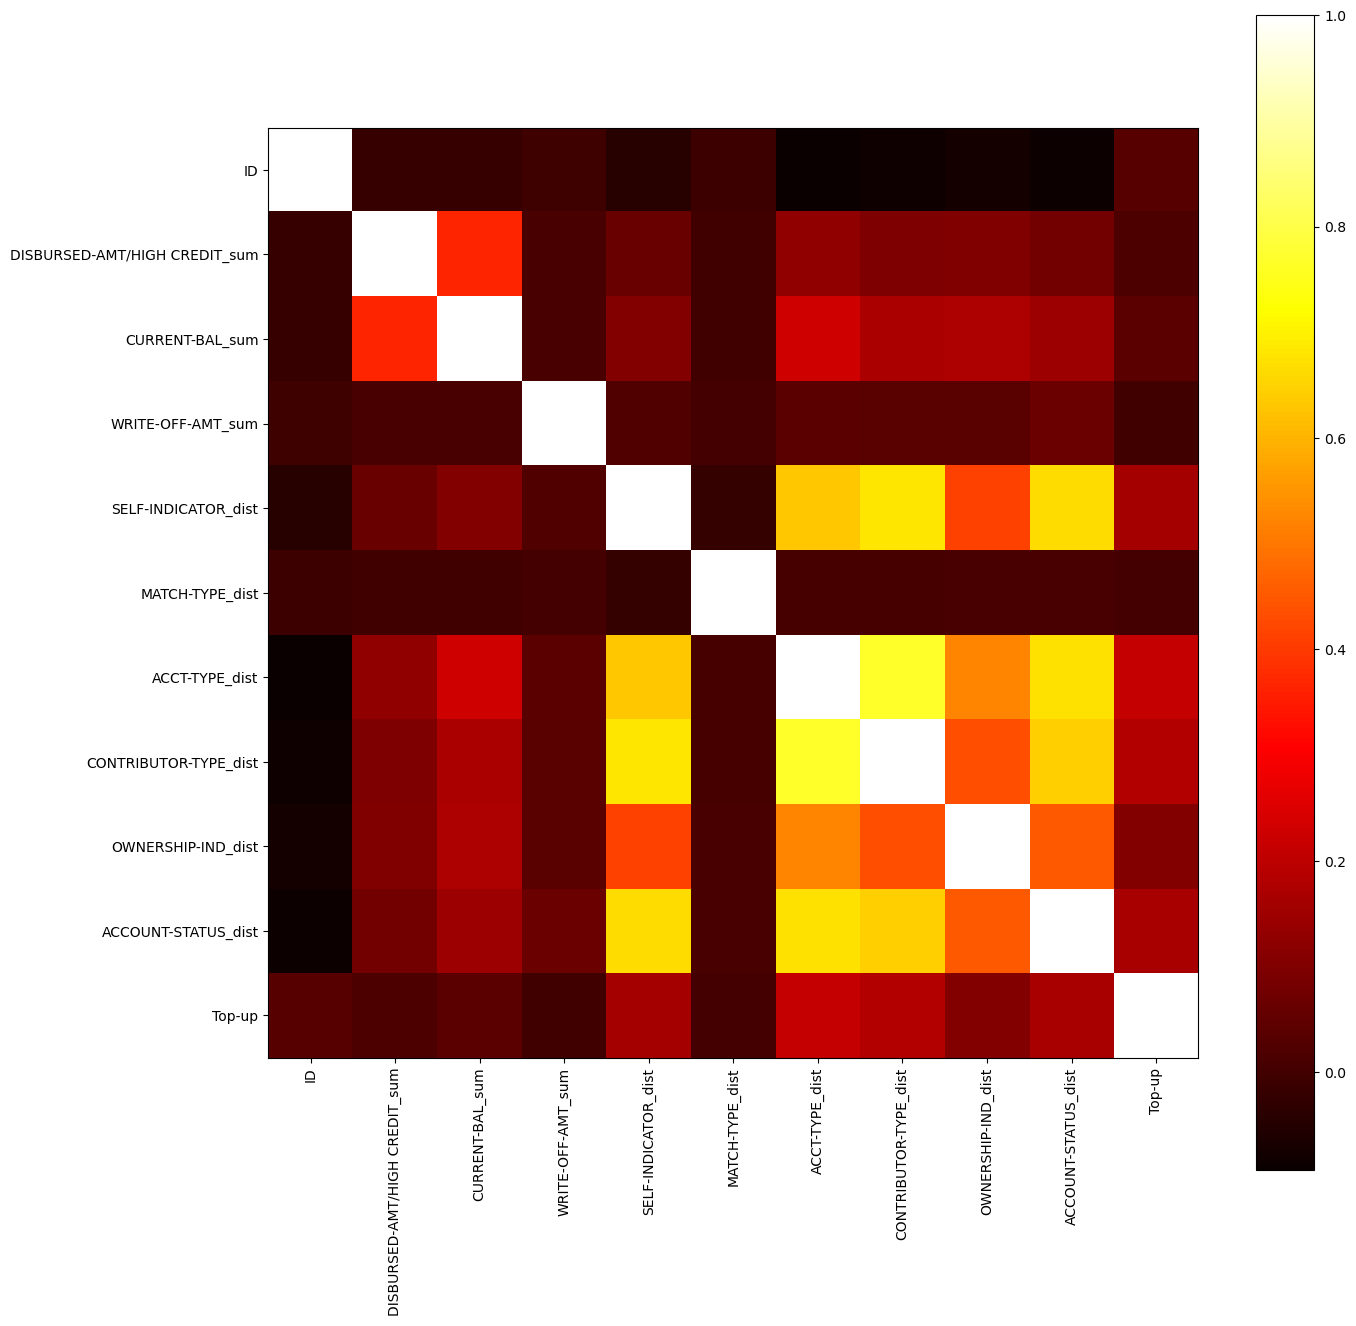

In [44]:
# Setting the plotsize figure
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111)

# Plotting the heatmap with pearson correlation
plt.imshow(bureau_viz_pandas.corr(method='pearson'), 
           cmap='hot', interpolation='nearest')
plt.colorbar()

labels = bureau_viz_pandas.columns.tolist()

ax1.set_xticks(np.arange(len(labels)))
ax1.set_yticks(np.arange(len(labels)))
ax1.set_xticklabels(labels,rotation=90, fontsize=10)
ax1.set_yticklabels(labels,fontsize=10)

plt.show()

##### Observations

The heatmap tells us that we have a number of variables that affect `Top-up`. However, there is also a strong multi-collinearity between the variables themselves. This means that there is variable dependence between the would be predictors of `Top-up`. Some of the variables that are strongly related to each other are:

* `SELF_INDICATOR_dist`-`ACCOUNT_STATUS_dist`
* `ACCT-TYPE_dist`-`CONTRIBUTOR_TYPE_dist`
* `OWNERSHIP-IND_dist`-`ACCT-TYPE_dist`

The variables that have an impact on `Top-up` are:

* `SELF-INDICATOR_dist`
* `ACCT-TYPE_dist`
* `CONTRIBUTOR-TYPE_dist`
* `OWNERSHIP-IND_dist`
* `ACCOUNT-STATUS_dist`

Generally speaking, any correlation coefficient that is greater than 0.1 or less than -0.1 can be considered as a significant correlation.

**Plot 2: Histogram**: Now, to better understand the distribution of values in some of these variables, let us plot a histogram for one of them: `ACCT-TYPE_dist`. A histogram is apt for demonstrating the normality or lack thereof in the distribution of data.

As was the case earlier, we can use `Matplotlib` to plot the histogram. To make things more interesting, let us plot this histogram with different bin widths. A bin represents an interval. Numerical data is divided into these intervals in a histogram. 

The number of bins is computed as a result of an arbitrary number 200 divided by the number of bins. Usually the binWidth is computed as the IQR of the entire distribution divided by the binwidth. Since we have a large pool of values here, it would help to make the bins look cleaner.

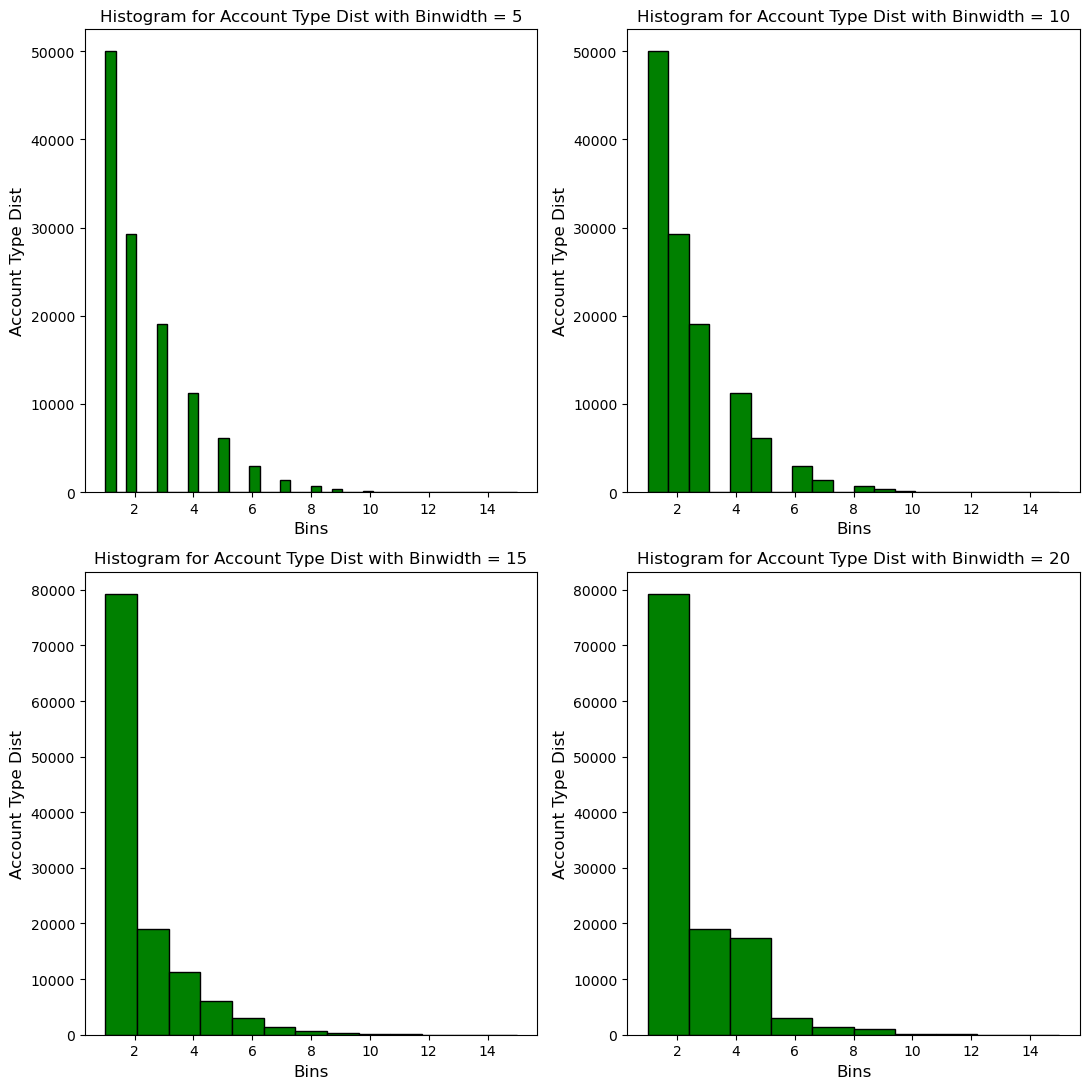

In [45]:
# Defining the parameters of the grid specifications
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11, 11))

# Looping through 4 different binwidths
for i, binWidth in enumerate([5, 10, 15, 20]):
    
    # Defining a 2x2 subplot
    ax = plt.subplot(2, 2, i + 1)
    
    # Drawing the plot
    ax.hist(bureau_viz_pandas['ACCT-TYPE_dist'], bins = int(200/binWidth), color = 'green', edgecolor = 'black')
    
    # Specifying the labels of the plots
    ax.set_title('Histogram for Account Type Dist with Binwidth = %d' % binWidth, size = 12)
    ax.set_xlabel('Bins', size = 12)
    ax.set_ylabel('Account Type Dist', size = 12)

# Displaying the subplots
plt.tight_layout()
plt.show()

##### Observations

From the histogram, it is clear that the distribution of values is left skewed. This means that the vast majority of values are on the left side of the distribution, creating an imbalance. In a more balanced distribution, we would have observed adequate values on either side of the median. Therefore, we can conclude that the distribution is not normalised.

This explains why `ACCT-TYPE_dist` is highly correlated with `Top-up`. Since the change in values in the distribution is rapid rather than gradual, it affects a similar change in the `Top-up` label. 

#### b. Visualising the Numerical Variables - Customer

Let us explore the columns of the second dataset in this joined dataset. Unlike the grouped Bureau data, the Customer dataset contains numeric and non-numeric variables. Therefore, we need to utilise different kinds of visualisation strategies to understand them.

We can start with the numerical variables first. Let us plot a correlation matrix for the Customer data.

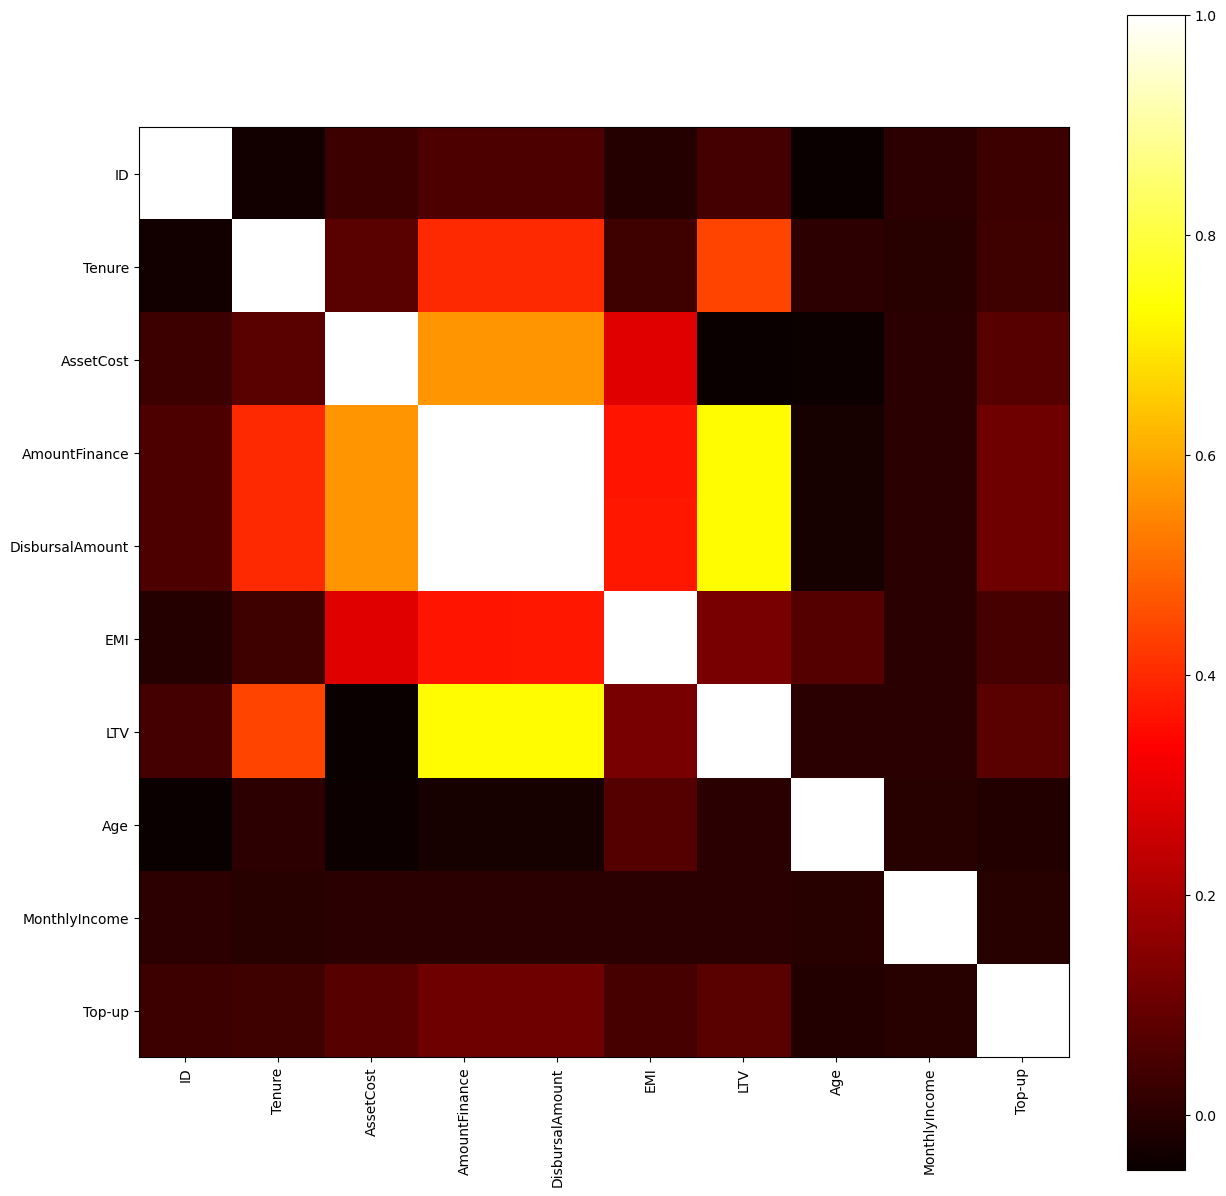

In [46]:
# Setting the plotsize figure
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111)

# Plotting the heatmap with pearson correlation
plt.imshow(customer_viz_pandas.corr(method='pearson'), 
           cmap='hot', interpolation='nearest')
plt.colorbar()

numericals = customer_viz_pandas.select_dtypes(include='number')
labels = numericals.columns.tolist()

ax1.set_xticks(np.arange(len(labels)))
ax1.set_yticks(np.arange(len(labels)))
ax1.set_xticklabels(labels,rotation=90, fontsize=10)
ax1.set_yticklabels(labels,fontsize=10)

plt.show()

**Interpreting the Results for the Numerical Columns and Top-Up**

Based on the above heatmap, we can see that the following variables have a significant impact on the `Top Up` class:

* `AmountFinance`
* `DisbursalAmount`

Additionally, some of the variables that have strong multicollinearity among them are:

* `AmountFinance`-`AssetCost`
* `AssetCost`-`EMI`
* `AmountFinance`-`DisbursalAmount`

As was the case with the Bureau data, any correlation above 0.1 can be considered significant. To summarise the results from visualising the correlation of both dataframe columns, it looks like the dependency between variables is much higher than their individual impact on `Top-up`. We will discuss why this is important in section `2.2.1` up ahead.

#### c. Visualising the Non-Numerical Variables - Customer (Part 1)

For the non-numerical variables, different plots are needed to help us visualise how these variables make sense with respect to each other and `Top-up`. We can demonstrate that with the help of different kinds of plots as mentioned earlier.

We can use two different kinds of bar plots here. For the variables that have only 2 distinct values, we can use a stacked bar chart. 

**1. Stacked Bar Chart**: 

This 4 plot visualisation consists of the following variables against `Top-up`:

* `InstlmentMode`
* `LoanStatus`
* `Sex`

Since Matplotlib works better with a Pandas dataframe, we can use the `toPandas()` function to convert the Spark dataframe. The dataframe at play here is grouped and aggregated by the number of `Top-up` and `No Top-up` rows for each distinct value in the column.

In [47]:
# Creating the plotting data for Instlment Mode
plot1_data = cust_bureau_df.groupBy('InstlmentMode', 
                                    'Top-up').agg(F.count('Top-up').alias('topUpCount')).sort('InstlmentMode').toPandas()

# Displaying the data to be plotted
plot1_data

InstlmentMode  Top-up  topUpCount
0       Advance       1        1266
1       Advance       0        3043
2        Arrear       0       86759
3        Arrear       1       30240

In [48]:
# Creating the plotting data for Loan Status 
plot2_data = cust_bureau_df.groupBy('LoanStatus', 
                                    'Top-up').agg(F.count('Top-up').alias('topUpCount')).sort('LoanStatus').toPandas()

# Displaying the data to be plotted
plot2_data

LoanStatus  Top-up  topUpCount
0     Active       0       24071
1     Active       1       10977
2     Closed       0       65731
3     Closed       1       20529

In [49]:
# Creating the plotting data for Sex
plot3_data = cust_bureau_df.groupBy('Sex', 
                                    'Top-up').agg(F.count('Top-up').alias('topUpCount')).sort('Sex').toPandas()

# Displaying the data to be plotted
plot3_data

Sex  Top-up  topUpCount
0   F       0        5090
1   F       1        1601
2   M       1       29905
3   M       0       84712

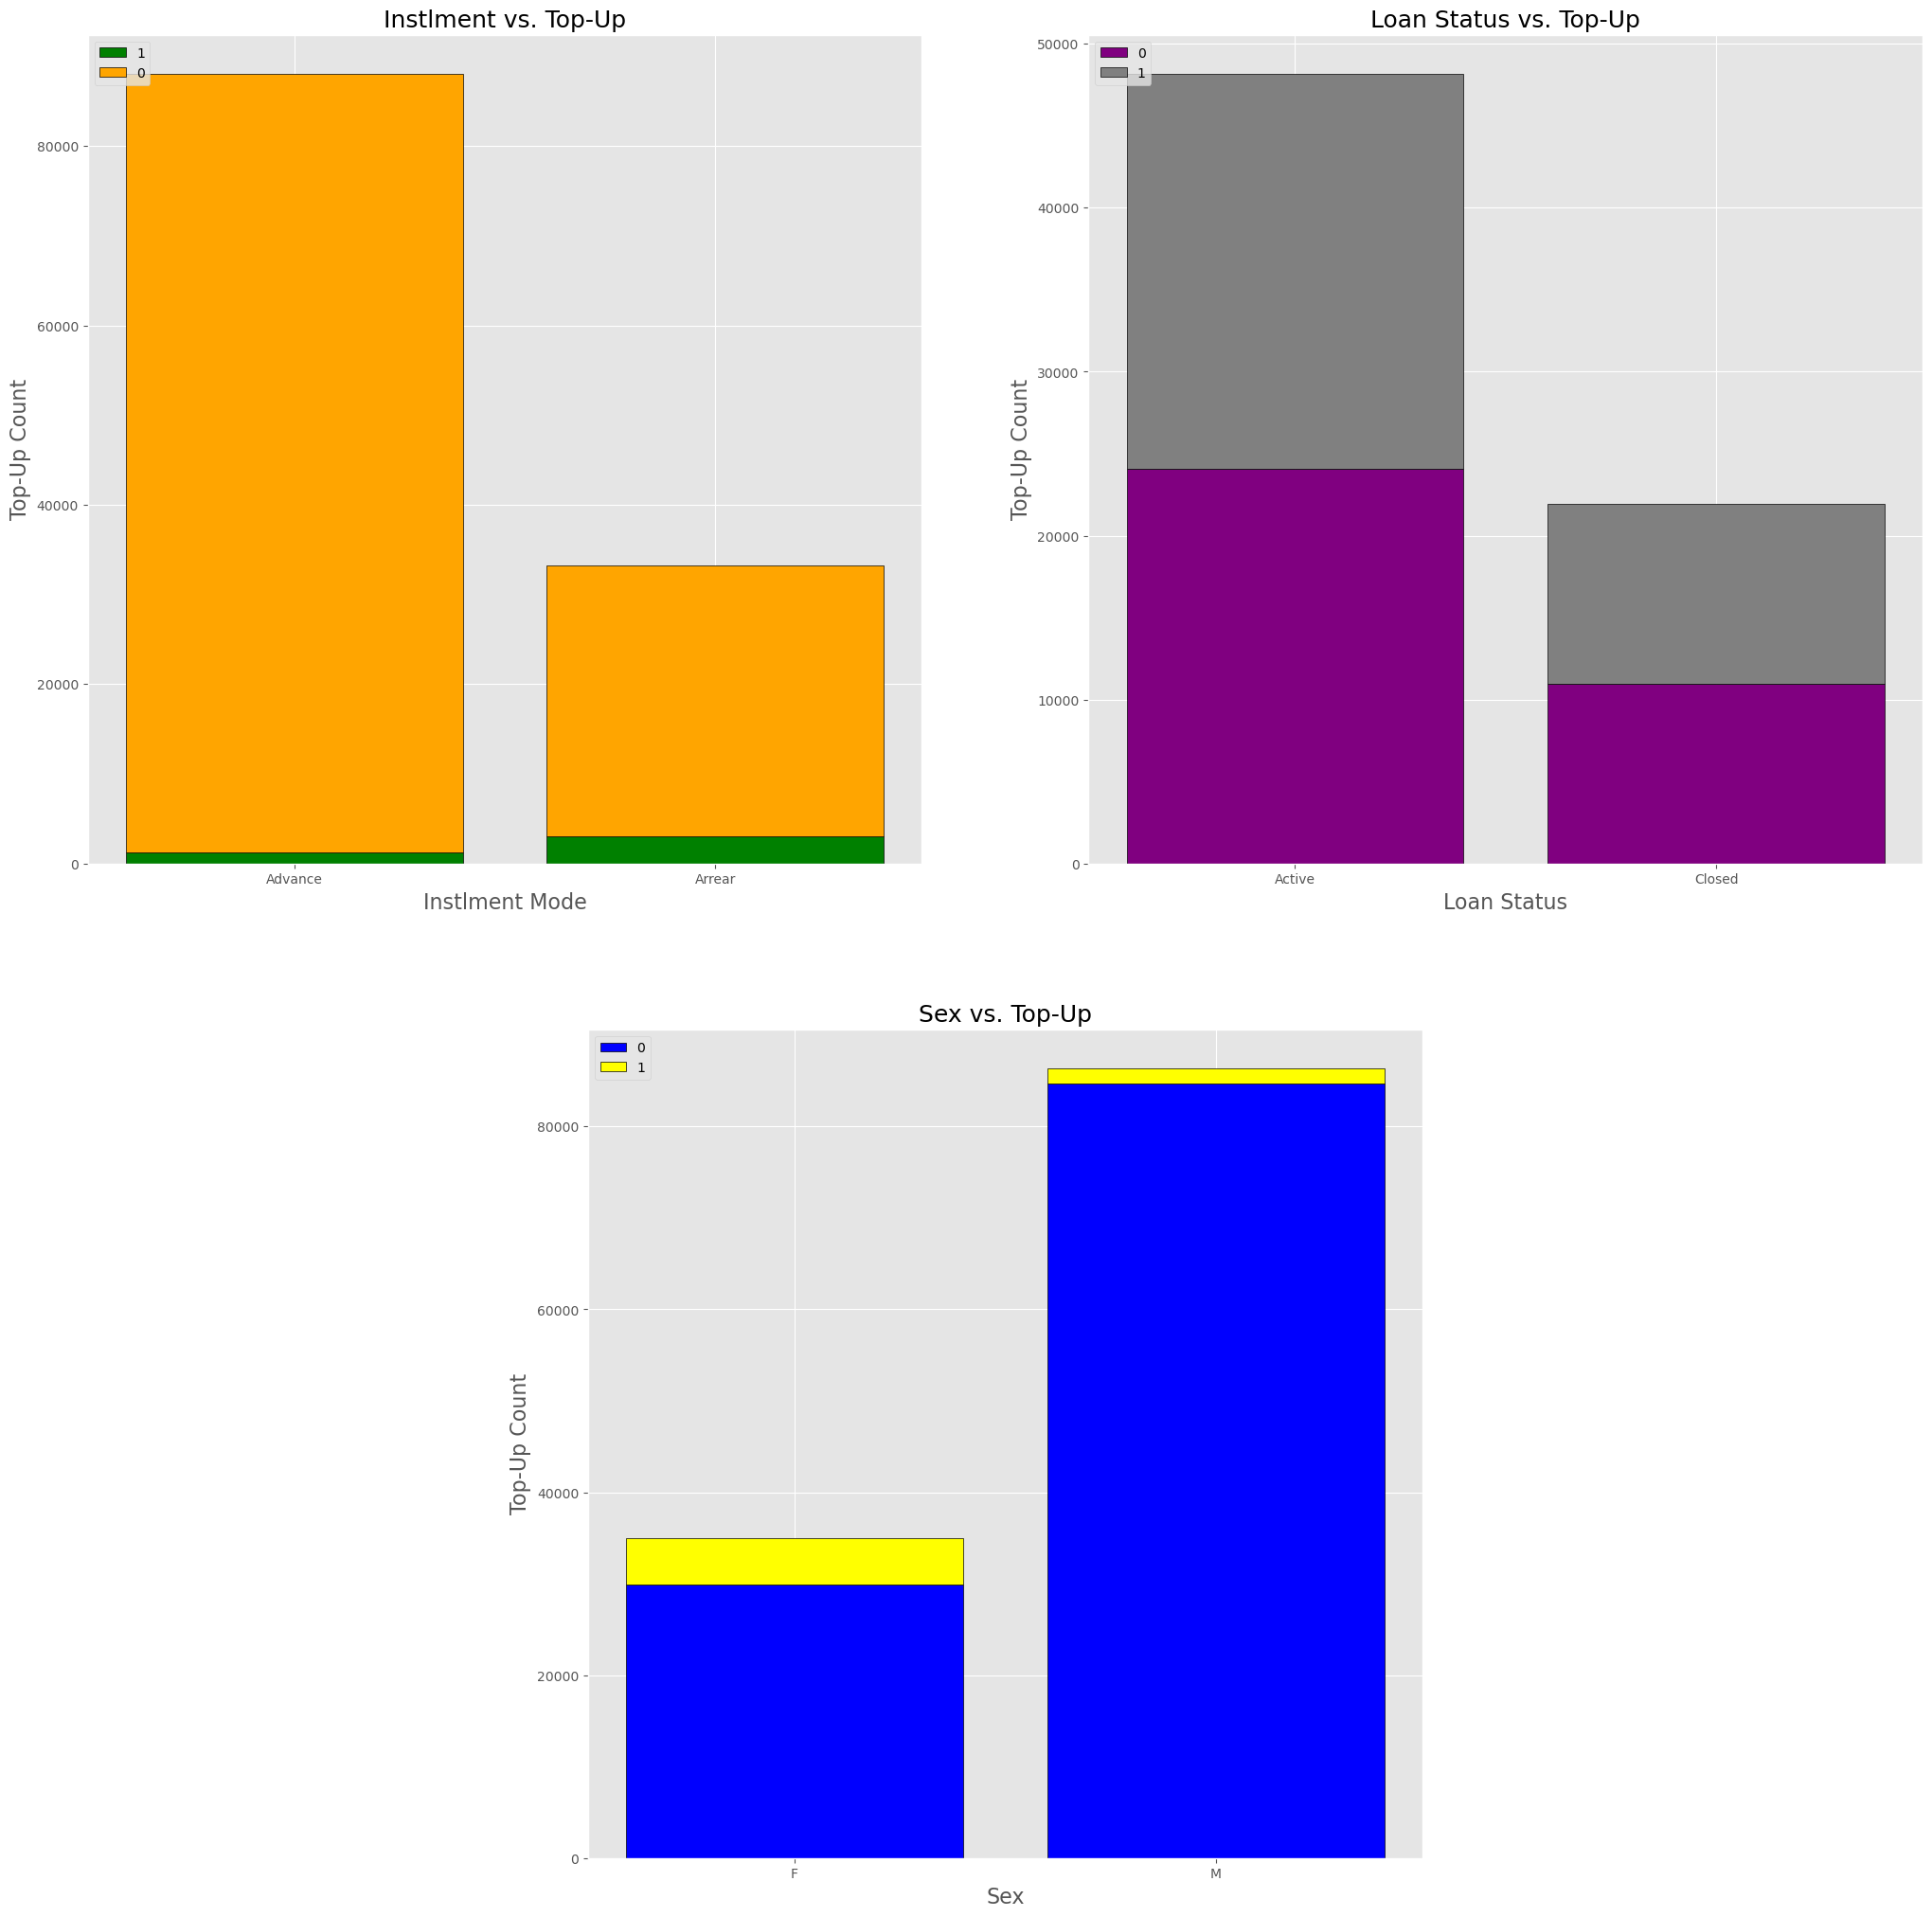

In [50]:
import matplotlib.gridspec as gridspec

# Defining the parameters of the grid specifications
gs = gridspec.GridSpec(2, 4)
gs.update(wspace = 0.5)

# Defining the plot size
fig, ax = plt.subplots(figsize=(25, 25))

topUpCount_ad = plot1_data[plot1_data['InstlmentMode'] == 'Advance']['topUpCount'].tolist()
topUpCount_ar = plot1_data[plot1_data['InstlmentMode'] == 'Arrear']['topUpCount'].tolist()


Instl = plot1_data['InstlmentMode'].drop_duplicates().tolist()
topUp = plot1_data['Top-up'].drop_duplicates().tolist()

pos = np.arange(len(Instl))

# Setting the plot style to ggplot
plt.style.use('ggplot')

# Position of the first plot
plt.subplot(gs[0, :2],)
 
plt.bar(pos,topUpCount_ad,color='green',edgecolor='black')
plt.bar(pos,topUpCount_ar,color='orange',edgecolor='black', bottom= topUpCount_ad)
plt.xticks(pos, Instl)
plt.xlabel('Instlment Mode', fontsize=16)
plt.ylabel('Top-Up Count', fontsize=16)
plt.title('Instlment vs. Top-Up',fontsize=18)
plt.legend(topUp, loc=2)
#plt.show()


topUpCount_ac = plot2_data[plot2_data['LoanStatus'] == 'Active']['topUpCount'].tolist()
topUpCount_cl = plot2_data[plot2_data['LoanStatus'] == 'Active']['topUpCount'].tolist()


loan = plot2_data['LoanStatus'].drop_duplicates().tolist()
topUp = plot2_data['Top-up'].drop_duplicates().tolist()

pos = np.arange(len(loan))

# Setting the plot style to ggplot
plt.style.use('ggplot')

# Position of the second plot
plt.subplot(gs[0, 2:])
 
plt.bar(pos,topUpCount_ac,color='purple',edgecolor='black')
plt.bar(pos,topUpCount_cl,color='gray',edgecolor='black', bottom= topUpCount_ac)
plt.xticks(pos, loan)
plt.xlabel('Loan Status', fontsize=16)
plt.ylabel('Top-Up Count', fontsize=16)
plt.title('Loan Status vs. Top-Up',fontsize=18)
plt.legend(topUp, loc=2)
#plt.show()

topUpCount_Male = plot3_data[plot3_data['Sex'] == 'M']['topUpCount'].tolist()
topUpCount_Female = plot3_data[plot3_data['Sex'] == 'F']['topUpCount'].tolist()
Sex = plot3_data['Sex'].drop_duplicates().tolist()
topUp = plot3_data['Top-up'].drop_duplicates().tolist()

pos = np.arange(len(Sex))


# Setting the plot style to ggplot
plt.style.use('ggplot')

# Position of the third plot
plt.subplot(gs[1, 1:3])
 
plt.bar(pos,topUpCount_Male,color='blue',edgecolor='black')
plt.bar(pos,topUpCount_Female,color='yellow',edgecolor='black',bottom=topUpCount_Male)
plt.xticks(pos, Sex)
plt.xlabel('Sex', fontsize=16)
plt.ylabel('Top-Up Count', fontsize=16)
plt.title('Sex vs. Top-Up',fontsize=18)
plt.legend(topUp, loc=2)
plt.show()

##### Observing the Plot:

There are three things of note in the above stacked bar charts:

* Overall, more customers have not subscribed to any top-up service.
* There there are more male customers than female customers. Similarly, there are more customers whose loan status is active than closed.
* Finally, there are roughly an equal number of active loan account customers who have not subscribed or subscribed to a top-up service.

From these observations, it can be concluded overall that a customer's chosen instlment mode, loan status and sex will determine whether that customer is subscribed to a Top-up service or not.

#### d. Visualising the Non-Numerical Variables - Customer (Part 2)

In the second part of visualising the non-numerical variables for the Customer data, we are going to use a grouped bar chart since we have multiple categories here. 

Even so, trying to plot every distinct value in each category is not meaningful from a visual standpoint. Therefore, it is better to take a sample of values for all the categories except `Frequency`. Since we have only 4 different frequency types, we can plot them as they are. 

As was the case earlier, we are trying to plot the number of customers who are subscribed to a top-up service and the characteristics of the customer who has not subscribed to a top-up service. 

Since we have a number of non-numerical variables, for this plot, the following columns have been chosen:

* `Frequency`
* `Area`
* `State`
* `PaymentMode`

Now, let us start by preparing the data for the Frequency column first.

In [51]:
# Creating the dataset for plotting Frequency vs. Top-up
plot4_data = cust_bureau_df.groupBy('Frequency', 
                                    'Top-up').agg(F.count('Top-up').alias('topUpCount'))\
                                     .sort('Frequency').withColumnRenamed('Top-up', 'Top_up')

# Converting the data to be plotted into a Pandas dataframe
plot4_data = plot4_data.withColumn('Top_up', F.col('Top_up').cast(StringType())).toPandas()


# Checking the data
plot4_data

Frequency Top_up  topUpCount
0   BI-Monthly      0         269
1   BI-Monthly      1          36
2  Half Yearly      1       22469
3  Half Yearly      0       56517
4      Monthly      1        4806
5      Monthly      0       17729
6      Quatrly      0       15287
7      Quatrly      1        4195

For the variables `Area`, `State` and `PaymentMode`, it is more convenient to take a sample of the data. These are the steps to be followed for preparing the data for all 3 plots: 

* Firstly, to maintain consistency in our sample, let us make sure that the selected areas in the sample have both Top-up and No Top-up customers. We can achieve that by using the `selectExpr()` function in Pyspark. Finally, we can convert this dataframe to a Pandas dataframe for the next step in the visualisation preparation.

* Secondly, we need to make sure that the sample taken from the dataframe consists of top-up and no top-up customers for each distinct value of area. It is difficult to achieve this in Pyspark. However, `NumPy` has a function called `random_choice` that selects all occurences of a distinct set of values. Sinec NumPy only works with `Pandas`, we need to convert the dataframe into a Pandas dataframe just for this step. We need to do this for all three variables to ensure consistency in the final plot.

In [52]:
# Forming the plotting data for Area
plot5_data = cust_bureau_df.groupBy('Area', 
                                    'Top-up').agg(F.count('Top-up').alias('topUpCount'))\
                                    .sort('Area').withColumnRenamed('Top-up', 'Top_up')

# Renaming columns and changing the datatype for convenience
plot5_data = plot5_data.withColumn('Top_up', F.col('Top_up').cast(StringType()))

# Computing the number of occurences for each unique area
plot5RowCount = plot5_data.selectExpr("*", "count('*') over (partition by (Area)) as rowCount")

# Filtering the rows of data with top up and no top up customers for each area and converting it to Pandas
plot5_data = plot5RowCount.filter(plot5RowCount.rowCount > 1).drop('rowCount').toPandas()

# Displaying the full grouped data for area
plot5_data

Area Top_up  topUpCount
0             AHMEDABAD      0          27
1             AHMEDABAD      1           1
2    AHMEDABAD AMBAVADI      0        2941
3    AHMEDABAD AMBAVADI      1        1006
4     AHMEDABAD CG ROAD      0          48
..                  ...    ...         ...
177          VIJAYAWADA      0        2348
178      VISHAKHAPATNAM      1         435
179      VISHAKHAPATNAM      0        1280
180         YAMUNANAGAR      0          20
181         YAMUNANAGAR      1          13

[182 rows x 3 columns]

In [53]:
# Selecting the unique areas from the dataframe
unique_area = plot5_data.Area.unique()

# Controlling the randomness of the sample selection
np.random.seed(12)

# Creating a randomizer for the unique values of area
samples = np.random.choice(unique_area, replace = False, size = 5)

# Sampling the plotting data based on the above randomizer
plot5_data_sample = plot5_data[plot5_data.Area.isin(samples)].reset_index(drop = True)

# Displaying the final grouped sample to be plotted
plot5_data_sample

Area Top_up  topUpCount
0   BAGALKOT      1           2
1   BAGALKOT      0           6
2  BHAVNAGAR      0          14
3  BHAVNAGAR      1           1
4  MADHUBANI      1          31
5  MADHUBANI      0          91
6     PALWAL      0          22
7     PALWAL      1           9
8    PANIPAT      1           6
9    PANIPAT      0          15

In [54]:
# Forming the plotting data for State
plot6_data = cust_bureau_df.groupBy('State', 
                                    'Top-up').agg(F.count('Top-up').alias('topUpCount'))\
                                    .sort('State').withColumnRenamed('Top-up', 'Top_up')

# Renaming columns and changing the datatype for convenience
plot6_data = plot6_data.withColumn('Top_up', F.col('Top_up').cast(StringType()))

# Computing the number of occurences for each unique state
plot6RowCount = plot6_data.selectExpr("*", "count('*') over (partition by (State)) as rowCount")

# Filtering the rows of data with top up and no top up customers for each state and converting it to Pandas
plot6_data = plot6RowCount.filter(plot6RowCount.rowCount > 1).drop('rowCount').toPandas()

# Displaying the full grouped data for state
plot6_data

State Top_up  topUpCount
0     ANDHRA PRADESH      0       13091
1     ANDHRA PRADESH      1        5497
2              BIHAR      1         639
3              BIHAR      0        2514
4        CHATTISGARH      0        3006
5        CHATTISGARH      1         541
6              DELHI      1           3
7              DELHI      0           3
8            GUJARAT      1        1996
9            GUJARAT      0        7177
10           HARYANA      1        2325
11           HARYANA      0        6834
12  HIMACHAL PRADESH      0          68
13  HIMACHAL PRADESH      1           3
14         JHARKHAND      1           1
15         JHARKHAND      0          20
16         KARNATAKA      0        8585
17         KARNATAKA      1        2598
18    MADHYA PRADESH      0       13333
19    MADHYA PRADESH      1        6066
20       MAHARASHTRA      0        6127
21       MAHARASHTRA      1        2510
22            ORISSA      1         776
23            ORISSA      0        1893
24            PUNJAB      0        3792
25            PUNJAB      1        1196
26         RAJASTHAN      1        2859
27         RAJASTHAN      0        6234
28         TELANGANA      1        1354
29         TELANGANA      0        1654
30     UTTAR PRADESH      1        1955
31     UTTAR PRADESH      0       12749
32       UTTARAKHAND      0          97
33       UTTARAKHAND      1         498
34       WEST BENGAL      0        2612
35       WEST BENGAL      1         689

In [55]:
# Selecting the unique states from the dataframe
unique_state = plot6_data.State.unique()

# Controlling the randomness of the sample selection
np.random.seed(123)

# Creating a randomizer for the unique values of state
samples = np.random.choice(unique_state, replace = False, size = 5)

# Sampling the plotting data based on the above randomizer
plot6_data_sample = plot6_data[plot6_data.State.isin(samples)].reset_index(drop = True)

# Displaying the final grouped sample to be plotted
plot6_data_sample

State Top_up  topUpCount
0    GUJARAT      1        1996
1    GUJARAT      0        7177
2    HARYANA      1        2325
3    HARYANA      0        6834
4  KARNATAKA      0        8585
5  KARNATAKA      1        2598
6     ORISSA      1         776
7     ORISSA      0        1893
8  TELANGANA      1        1354
9  TELANGANA      0        1654

In [56]:
# Forming the plotting data for Payment Mode
plot7_data = cust_bureau_df.groupBy('PaymentMode', 
                                    'Top-up').agg(F.count('Top-up').alias('topUpCount'))\
                                    .sort('PaymentMode').withColumnRenamed('Top-up', 'Top_up')

# Renaming columns and changing the datatype for convenience
plot7_data = plot7_data.withColumn('Top_up', F.col('Top_up').cast(StringType()))

# Computing the number of occurences for each unique payment mode
plot7RowCount = plot7_data.selectExpr("*", "count('*') over (partition by (PaymentMode)) as rowCount")

# Filtering the rows of data with top up and no top up customers for each payment mode and converting it to Pandas
plot7_data = plot7RowCount.filter(plot7RowCount.rowCount > 1).drop('rowCount').toPandas()

# Displaying the full grouped data for payment mode
plot7_data

PaymentMode Top_up  topUpCount
0     Auto Debit      1         228
1     Auto Debit      0         677
2         Billed      1        4501
3         Billed      0       13167
4         Cheque      1         140
5         Cheque      0         349
6   Direct Debit      1        8701
7   Direct Debit      0       23844
8            ECS      0       23714
9            ECS      1        9364
10    ECS Reject      1         116
11    ECS Reject      0         341
12        Escrow      1           2
13        Escrow      0           5
14           PDC      1        6363
15           PDC      0       19588
16    PDC Reject      1           2
17    PDC Reject      0           5
18         PDC_E      0        7542
19         PDC_E      1        1856
20     SI Reject      0         570
21     SI Reject      1         233

In [57]:
# Selecting the unique payment modes from the dataframe
unique_pay = plot7_data.PaymentMode.unique()

# Controlling the randomness of the sample selection
np.random.seed(1)

# Creating a randomizer for the unique values of payment mode
samples = np.random.choice(unique_pay, replace=False, size = 5)

# Sampling the plotting data based on the above randomizer
plot7_data_sample = plot7_data[plot7_data.PaymentMode.isin(samples)].reset_index(drop = True)

# Displaying the final grouped sample to be plotted
plot7_data_sample

PaymentMode Top_up  topUpCount
0        Billed      1        4501
1        Billed      0       13167
2        Cheque      1         140
3        Cheque      0         349
4  Direct Debit      1        8701
5  Direct Debit      0       23844
6           ECS      0       23714
7           ECS      1        9364
8         PDC_E      0        7542
9         PDC_E      1        1856

With the different grouped data prepared, we can use Matplotlib to plot them all as follows:

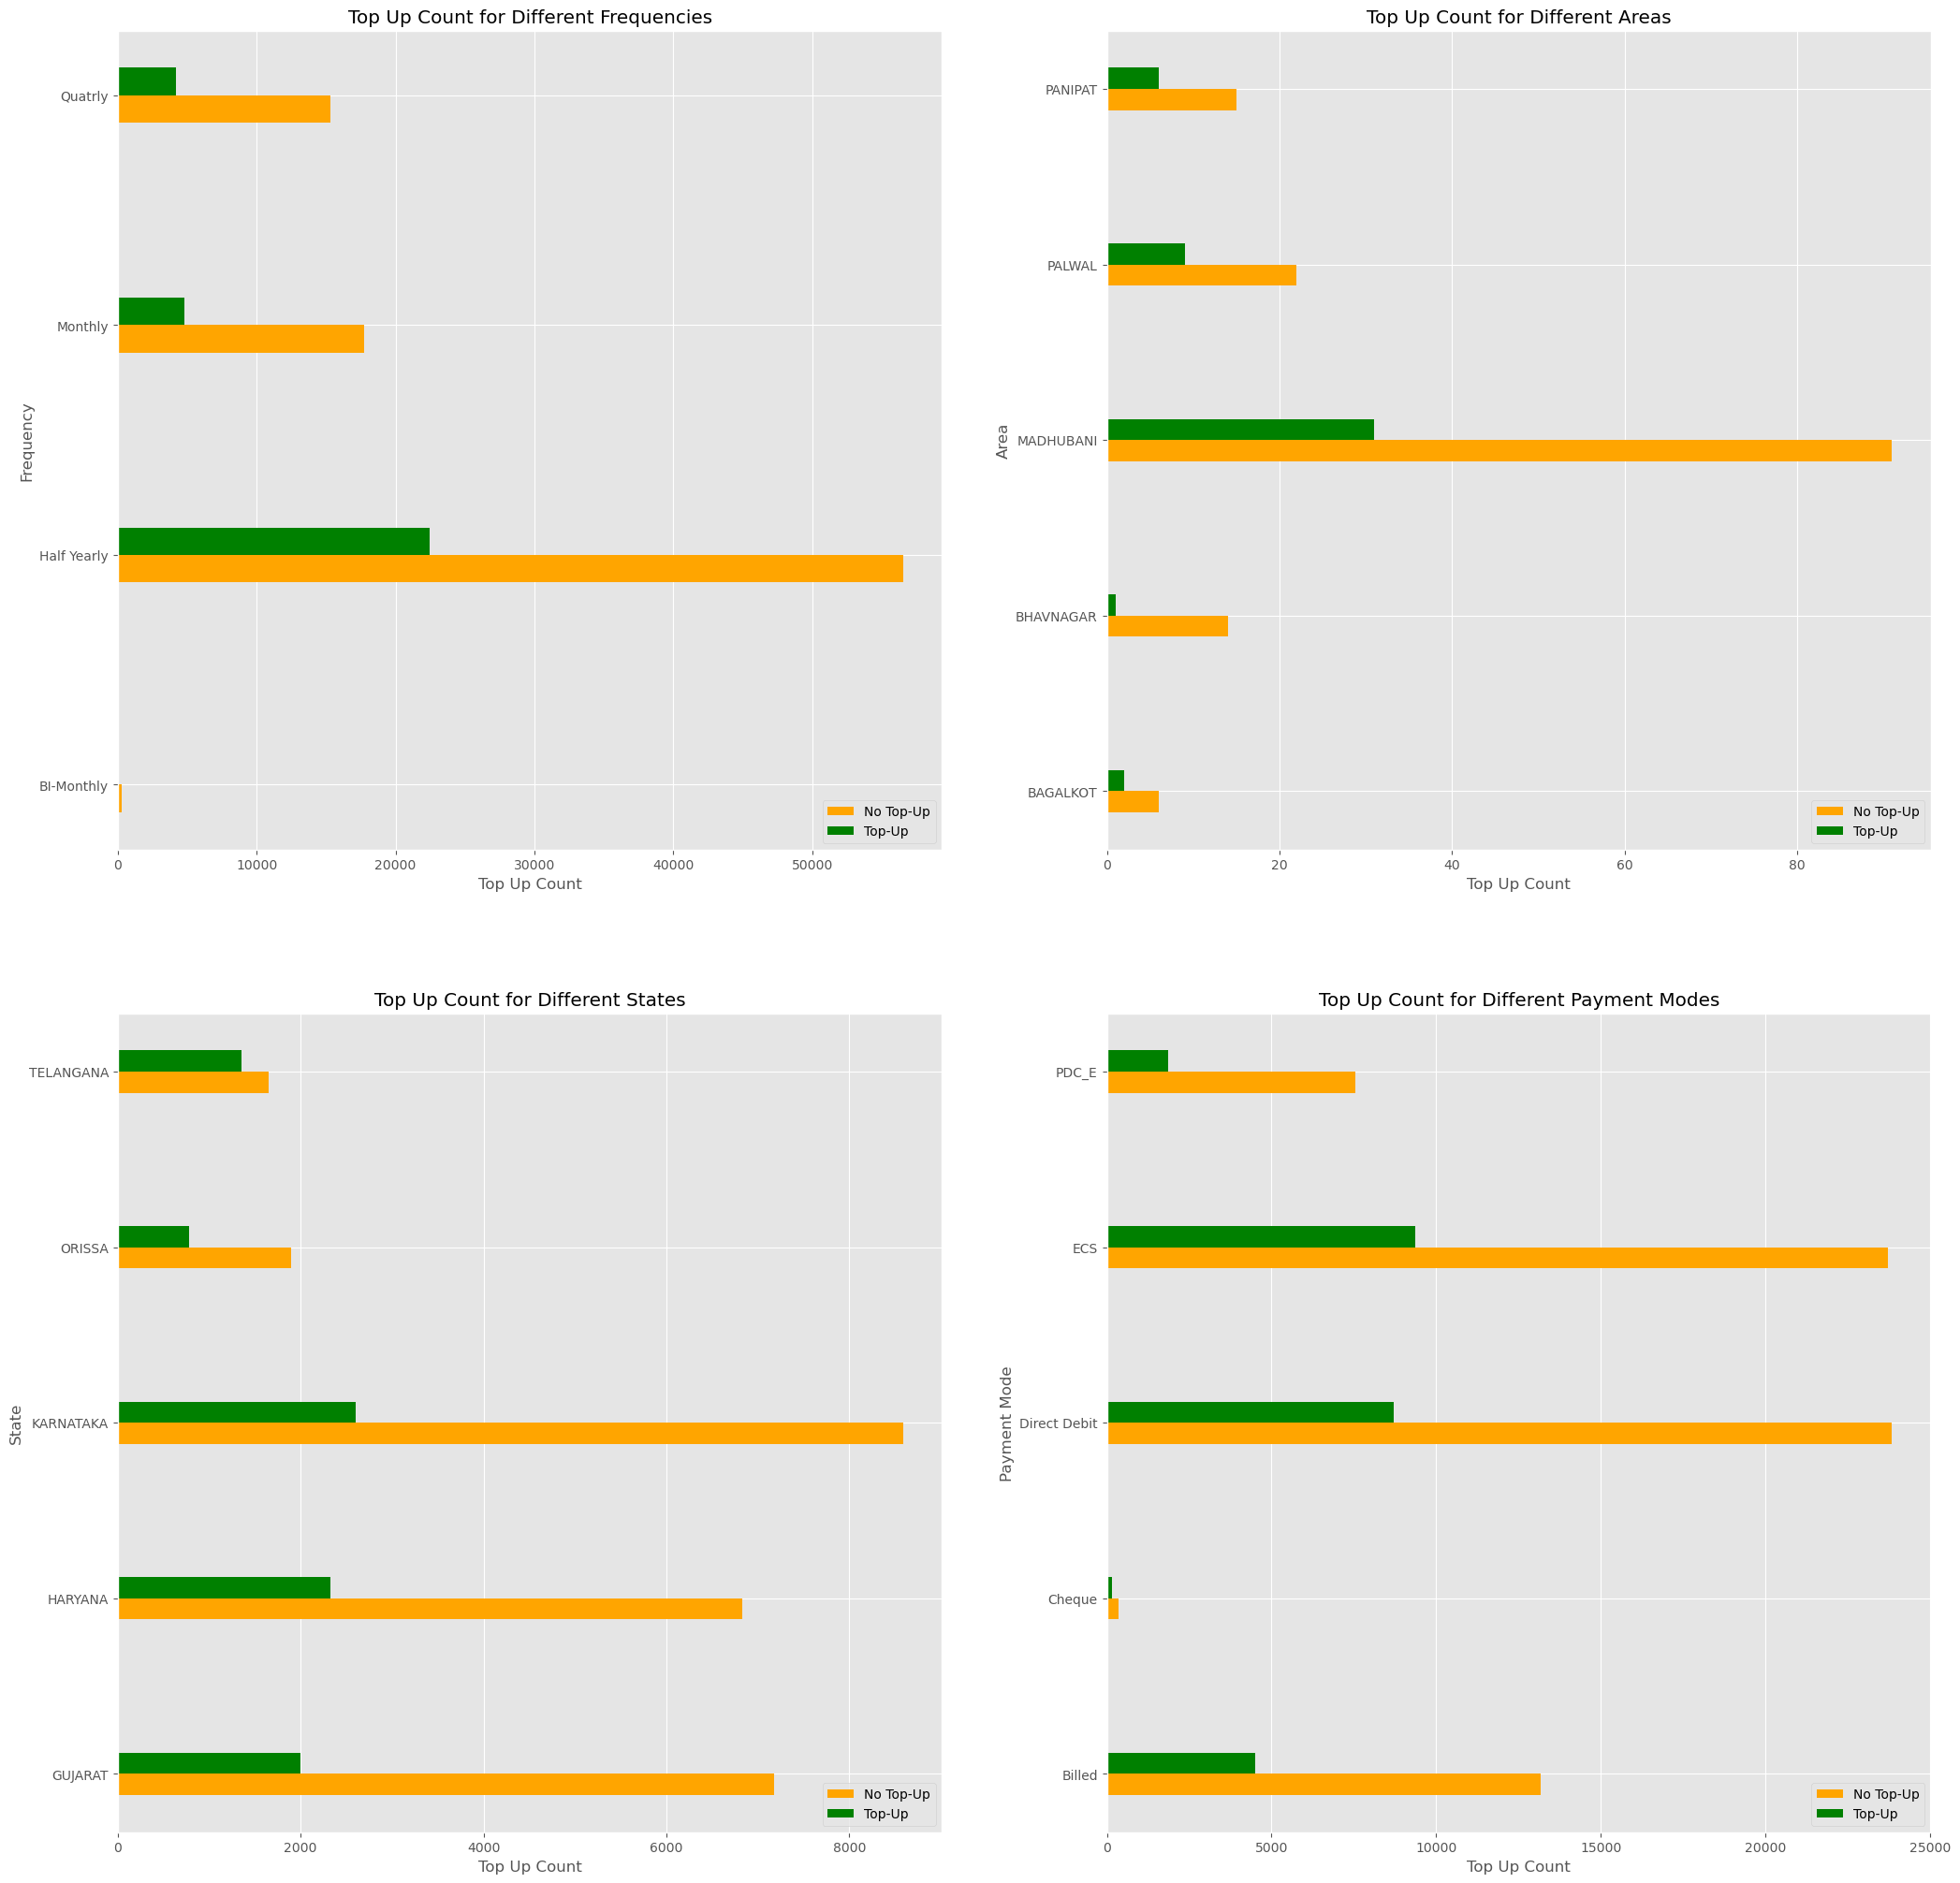

In [58]:
# Defining the plot size
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 25))

# Listing the top up and no top up counts with respect to Frequency
topUpCount_0 = plot4_data[plot4_data['Top_up'] == '0']['topUpCount'].tolist()
topUpCount_1 = plot4_data[plot4_data['Top_up'] == '1']['topUpCount'].tolist()

# Taking the list of distinct frequencies and top up counts
frequency = plot4_data.Frequency.unique().tolist()
topUp = plot4_data.Top_up.unique().tolist()

# Setting the width of the bars
w = 0.12

# Setting the plot style to ggplot
plt.style.use('ggplot')

# Defining the bars for each frequency and putting them up against the number of top up counts
bar1 = np.arange(len(frequency))
bar2 = [i + w for i in bar1]

# Defining the subplot position
plt.subplot(2, 2, 1)

# Plotting the top up counts to each bar
plt.barh(bar1, topUpCount_0, w, color = 'orange')
plt.barh(bar2, topUpCount_1, w, color = 'green')


# Defining the legend for the plot
plt.legend(['No Top-Up', 'Top-Up'], loc = 'lower right')
plt.title("Top Up Count for Different Frequencies")
plt.ylabel('Frequency')
plt.xlabel('Top Up Count')
plt.yticks(bar1+w/2, frequency)
#plt.show()

# Listing the top up and no top up counts with respect to Area
topUpCount_0 = plot5_data_sample[plot5_data_sample['Top_up'] == '0']['topUpCount'].tolist()
topUpCount_1 = plot5_data_sample[plot5_data_sample['Top_up'] == '1']['topUpCount'].tolist()

# Taking the list of distinct areas and top up counts
area = plot5_data_sample.Area.unique().tolist()
topUp = plot5_data_sample.Top_up.unique().tolist()

# Setting the width of the bars
w = 0.12

# Setting the plot style to ggplot
plt.style.use('ggplot')

# Defining the bars for each area and putting them up against the number of top up counts
bar1 = np.arange(len(area))
bar2 = [i + w for i in bar1]

# Defining the subplot position
plt.subplot(2, 2, 2)

# Plotting the top up counts to each bar
plt.barh(bar1, topUpCount_0, w, color = 'orange')
plt.barh(bar2, topUpCount_1, w, color = 'green')


# Defining the legend for the plot
plt.legend(['No Top-Up', 'Top-Up'], loc = 'lower right')
plt.title("Top Up Count for Different Areas")
plt.ylabel('Area')
plt.xlabel('Top Up Count')
plt.yticks(bar1+w/2, area)
#plt.show()

# Listing the top up and no top up counts with respect to State
topUpCount_0 = plot6_data_sample[plot6_data_sample['Top_up'] == '0']['topUpCount'].tolist()
topUpCount_1 = plot6_data_sample[plot6_data_sample['Top_up'] == '1']['topUpCount'].tolist()

# Taking the list of distinct states and top up counts
state = plot6_data_sample.State.unique().tolist()
topUp = plot6_data_sample.Top_up.unique().tolist()

# Setting the width of the bars
w = 0.12

# Setting the plot style to ggplot
plt.style.use('ggplot')

# Defining the bars for each of the days of the week and putting them up against the number of cities
bar1 = np.arange(len(state))
bar2 = [i + w for i in bar1]

# Defining the subplot position
plt.subplot(2, 2, 3)

# Plotting the top up counts to each bar
plt.barh(bar1, topUpCount_0, w, color = 'orange')
plt.barh(bar2, topUpCount_1, w, color = 'green')


# Defining the legend for the plot
plt.legend(['No Top-Up', 'Top-Up'], loc = 'lower right')
plt.title("Top Up Count for Different States")
plt.ylabel('State')
plt.xlabel('Top Up Count')
plt.yticks(bar1+w/2, state)
#plt.show()

# Listing the top up and no top up counts with respect to payment mode
topUpCount_0 = plot7_data_sample[plot7_data_sample['Top_up'] == '0']['topUpCount'].tolist()
topUpCount_1 = plot7_data_sample[plot7_data_sample['Top_up'] == '1']['topUpCount'].tolist()

# Taking the list of distinct payment modes and top up counts
pay = plot7_data_sample.PaymentMode.unique().tolist()
topUp = plot7_data_sample.Top_up.unique().tolist()

# Setting the width of the bars
w = 0.12

# Setting the plot style to ggplot
plt.style.use('ggplot')

# Defining the bars for each payment method
bar1 = np.arange(len(pay))
bar2 = [i + w for i in bar1]

# Defining the subplot position
plt.subplot(2, 2, 4)

# Plotting the top up counts to each bar
plt.barh(bar1, topUpCount_0, w, color = 'orange')
plt.barh(bar2, topUpCount_1, w, color = 'green')


# Defining the legend for the plot
plt.legend(['No Top-Up', 'Top-Up'], loc = 'lower right')
plt.title("Top Up Count for Different Payment Modes")
plt.ylabel('Payment Mode')
plt.xlabel('Top Up Count')
plt.yticks(bar1+w/2, pay)
plt.show()

##### Observations

It is evident from the above plot that customers being from different areas or states or having opted for different payment modes or subscriptions will significantly have an impact on their decision to subscribe to a top-up service. 

For example, Karnataka has a large number of customers while Telangana has fewer customers. However, Telangana, has a small difference in the number of customers who have subscribed to a top-up service and the ones who haven't. Therefore, for a new customer in Telangana, there is a higher possibility of that customer opting for a top-up service as opposed to a customer in Karnataka.

## 2. Feature Extraction and ML Training

In the first step towards modelling the data, we need to prepare it for training and testing. In machine learning, this involves splitting it in a meaningful way into training and testing halves. The nature of the split is crucial because the model will be fitted to the training data and used to predict the testing data. We are going to fit our models on two types of split and observe the performance of the model with each type of split.

### 2.1 Preparing the Training Data and Testing Data

In the first type of splitting activity, we will implement the below steps to split the data:

* Split the data into 80% training and 20% testing.
* Take a 20% sample of `Top-up` = 1 rows from the training data
* Take a second sample containing `Top-up` = 0 rows. The number of rows in this sample should be double of the number of rows taken in the second step such that we have a 1:2 ratio for the rows.
* Combine both samples to give us the final training data.

In [59]:
# Split data into training and testing sets
(cust_bureau_train, cust_bureau_test) = cust_bureau_df.randomSplit([0.80, 0.20], seed = 1)

In [60]:
# Taking a random sample of Top-up rows from the training data
train_sample1 = cust_bureau_train.filter(F.col('Top-up') == 1).sample(0.2, 1)

In [61]:
# Counting the number of rows in the above sample
train_sample1.count()

5124

In [62]:
# Taking a random sample of No Top-up rows from the training data whose row count is twice that of sample1
train_sample2 = cust_bureau_train.filter(F.col('Top-up') == 0)\
.orderBy(F.rand(seed = 1)).limit(train_sample1.count()*2)

In [63]:
# Combining the two samples
cust_bureau_train_fin = train_sample1.union(train_sample2)

# Shuffling the combined data
cust_bureau_train_fin = cust_bureau_train_fin.orderBy(F.rand(seed = 1))

In [64]:
# Checking the final trained dataset
cust_bureau_train_fin.show(vertical = True)

-RECORD 0--------------------------------------------
 ID                            | 83688               
 DISBURSED-AMT/HIGH CREDIT_sum | 807672              
 CURRENT-BAL_sum               | 134613              
 WRITE-OFF-AMT_sum             | 0                   
 SELF-INDICATOR_dist           | 2                   
 MATCH-TYPE_dist               | 1                   
 ACCT-TYPE_dist                | 1                   
 CONTRIBUTOR-TYPE_dist         | 2                   
 OWNERSHIP-IND_dist            | 1                   
 ACCOUNT-STATUS_dist           | 2                   
 Frequency                     | Half Yearly         
 InstlmentMode                 | Arrear              
 LoanStatus                    | Closed              
 PaymentMode                   | Direct Debit        
 BranchID                      | 299                 
 Area                          | UDAIPUR             
 Tenure                        | 24                  
 AssetCost                  

In [65]:
# Number of rows in the final version of the training dataset
cust_bureau_train_fin.count()

15277

In [66]:
# Number of rows in the testing dataset
cust_bureau_test.count()

24119

### 2.2 Preparing the Features, Labels and Models

In this section, we are going to select our features, prepare the label and the parameters of the model. From the visualisation of the data, we already have an idea about the most important variables but let us build on that here with more tests.

#### 2.2.1 Feature Selection Strategy

There are 2 things to be considered while selecting the features:

* Impact on `Top-up`
* Load on the MonPG server

Multicollinearity and skewness are not a concern here and we will discuss why that is shortly.

**1. Numeric Variable Selection**:

Earlier, we had generated a correlation heatmap to show the relationship between the numeric variables and `Top-up`. Let us dive deeper into those relationships by using a correlation matrix. We can use modules from the `pyspark.ml` library to create a correlation matrix.

In [67]:
# Importing the libraries
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Defining a function to create a correlation matrix
def pearson_correlation(df, method='pearson'):
    
    col_vector = "corr_features"
    assembler = VectorAssembler(inputCols = df.columns, outputCol = col_vector)
    df_vector = assembler.transform(df).select(col_vector)
    matrix = Correlation.corr(df_vector, col_vector, method)

    mat_result = matrix.collect()[0]["pearson({})".format(col_vector)].values
    return pd.DataFrame(mat_result.reshape(-1, len(df.columns)), columns=df.columns, index=df.columns)

# Printing the correlation matrix
pearson_correlation(bureau_viz)

ID  DISBURSED-AMT/HIGH CREDIT_sum  \
ID                             1.000000                      -0.017953   
DISBURSED-AMT/HIGH CREDIT_sum -0.017953                       1.000000   
CURRENT-BAL_sum               -0.018782                       0.364544   
WRITE-OFF-AMT_sum             -0.006908                       0.010358   
SELF-INDICATOR_dist           -0.043397                       0.063101   
MATCH-TYPE_dist               -0.009261                      -0.000809   
ACCT-TYPE_dist                -0.092703                       0.128217   
CONTRIBUTOR-TYPE_dist         -0.081571                       0.098694   
OWNERSHIP-IND_dist            -0.072767                       0.101063   
ACCOUNT-STATUS_dist           -0.085473                       0.080264   
Top-up                         0.032031                       0.016509   

                               CURRENT-BAL_sum  WRITE-OFF-AMT_sum  \
ID                                   -0.018782          -0.006908   
DISBURSED-AMT/HIGH CREDIT_sum         0.364544           0.010358   
CURRENT-BAL_sum                       1.000000           0.011287   
WRITE-OFF-AMT_sum                     0.011287           1.000000   
SELF-INDICATOR_dist                   0.107165           0.025385   
MATCH-TYPE_dist                       0.000167           0.003365   
ACCT-TYPE_dist                        0.230824           0.041714   
CONTRIBUTOR-TYPE_dist                 0.168534           0.035398   
OWNERSHIP-IND_dist                    0.174817           0.035914   
ACCOUNT-STATUS_dist                   0.149912           0.068387   
Top-up                                0.040646          -0.000958   

                               SELF-INDICATOR_dist  MATCH-TYPE_dist  \
ID                                       -0.043397        -0.009261   
DISBURSED-AMT/HIGH CREDIT_sum             0.063101        -0.000809   
CURRENT-BAL_sum                           0.107165         0.000167   
WRITE-OFF-AMT_sum                         0.025385         0.003365   
SELF-INDICATOR_dist                       1.000000        -0.020459   
MATCH-TYPE_dist                          -0.020459         1.000000   
ACCT-TYPE_dist                            0.629410         0.009546   
CONTRIBUTOR-TYPE_dist                     0.682373         0.009376   
OWNERSHIP-IND_dist                        0.413520         0.010851   
ACCOUNT-STATUS_dist                       0.665333         0.010656   
Top-up                                    0.159396         0.005231   

                               ACCT-TYPE_dist  CONTRIBUTOR-TYPE_dist  \
ID                                  -0.092703              -0.081571   
DISBURSED-AMT/HIGH CREDIT_sum        0.128217               0.098694   
CURRENT-BAL_sum                      0.230824               0.168534   
WRITE-OFF-AMT_sum                    0.041714               0.035398   
SELF-INDICATOR_dist                  0.629410               0.682373   
MATCH-TYPE_dist                      0.009546               0.009376   
ACCT-TYPE_dist                       1.000000               0.768850   
CONTRIBUTOR-TYPE_dist                0.768850               1.000000   
OWNERSHIP-IND_dist                   0.522682               0.434710   
ACCOUNT-STATUS_dist                  0.674967               0.641812   
Top-up                               0.211339               0.180860   

                               OWNERSHIP-IND_dist  ACCOUNT-STATUS_dist  \
ID                                      -0.072767            -0.085473   
DISBURSED-AMT/HIGH CREDIT_sum            0.101063             0.080264   
CURRENT-BAL_sum                          0.174817             0.149912   
WRITE-OFF-AMT_sum                        0.035914             0.068387   
SELF-INDICATOR_dist                      0.413520             0.665333   
MATCH-TYPE_dist                          0.010851             0.010656   
ACCT-TYPE_dist                           0.522682             0.674967   
CONTRIBUT

In [68]:
# Storing the names of the numeric columns in the Customer data
customer_numeric = [c.name for c in customer_viz.schema.fields if isinstance(c.dataType, IntegerType) 
                  | isinstance(c.dataType, DoubleType) | isinstance(c.dataType, FloatType)][1:]

# Printing the correlation matrix for the customer data
pearson_correlation(customer_viz.select(*customer_numeric))

Tenure  AssetCost  AmountFinance  DisbursalAmount  \
Tenure           1.000000   0.074648       0.400131         0.398219   
AssetCost        0.074648   1.000000       0.567310         0.567400   
AmountFinance    0.400131   0.567310       1.000000         0.998765   
DisbursalAmount  0.398219   0.567400       0.998765         1.000000   
EMI              0.035528   0.289419       0.366346         0.370092   
LTV              0.440296  -0.049663       0.727824         0.727843   
Age              0.005565  -0.041835      -0.028907        -0.028189   
MonthlyIncome   -0.000673   0.002794       0.001468         0.001486   
Top-up           0.034179   0.072301       0.108558         0.108765   

                      EMI       LTV       Age  MonthlyIncome    Top-up  
Tenure           0.035528  0.440296  0.005565      -0.000673  0.034179  
AssetCost        0.289419 -0.049663 -0.041835       0.002794  0.072301  
AmountFinance    0.366346  0.727824 -0.028907       0.001468  0.108558  
DisbursalAmount  0.370092  0.727843 -0.028189       0.001486  0.108765  
EMI              1.000000  0.126175  0.065598       0.000559  0.044998  
LTV              0.126175  1.000000  0.000485       0.000100  0.074182  
Age              0.065598  0.000485  1.000000      -0.004558 -0.011120  
MonthlyIncome    0.000559  0.000100 -0.004558       1.000000 -0.000804  
Top-up           0.044998  0.074182 -0.011120      -0.000804  1.000000

From the results of the matrices and heatmaps, we can select the below variables for our model as they are sufficiently correlated with `Top-up` with a correlation coefficient of at least 0.1:

* **Bureau Grouped Data**:

* `SELF-INDICATOR_count`
* `ACCT-TYPE_count`
* `CONTRIBUTOR-TYPE_count`
* `OWNERSHIP-IND_count`
* `ACCOUNT-STATUS_count`

**Customer Data**:

* `AmountFinance`
* `DisbursalAmount`

**2. Non-Numeric Variable Selection**:

The visualisation in section `1.3.4 d.` showed us that almost all the categorical variables have an impact on a customer subscribing to a top up service. Therefore, our selection will be based on excluding those columns that have too many distinct values.

First, let us cap the maximum allowable number of distinct values at 100, just to be safe. Additionally, we can exclude the ID columns as we are already going to have a large number of highly correlated numeric and non-numeric variables to make predictions.

In [69]:
# Column names for the non numeric columns
cust_bureau_strings = [x.name for x in cust_bureau_df.schema.fields if isinstance(x.dataType, StringType) 
                  | isinstance(x.dataType, TimestampType) | isinstance(x.dataType, DateType) | 
                       isinstance(x.dataType, BooleanType)]

print('####### Feature Selection vs. Server Capacity #######\n')

# Iterating through the non-numeric columns
for col in cust_bureau_strings:
    
    # Counting the number of distinct values in the column
    if cust_bureau_df.select(col).distinct().count() > 100 or 'ID' in col:
        
        print(col, 'should be excluded from the model')
        
    else:
        
        print(col, 'can be added to the model')

####### Feature Selection vs. Server Capacity #######

Frequency can be added to the model
InstlmentMode can be added to the model
LoanStatus can be added to the model
PaymentMode can be added to the model
BranchID should be excluded from the model
Area should be excluded from the model
DisbursalDate should be excluded from the model
MaturityDate should be excluded from the model
AuthDate should be excluded from the model
AssetID should be excluded from the model
ManufacturerID should be excluded from the model
SupplierID should be excluded from the model
Sex can be added to the model
City should be excluded from the model
State can be added to the model
ZipCode should be excluded from the model


Based on the above result, we can advance the following variables:

* `Frequency`
* `InstlmentMode`
* `LoanStatus`
* `PaymentMode`
* `Sex`
* `State`

To probe deeper into understanding the significance of these variables with respect to `Top-up`, we can use the `Chi-squared` test. 

This test is used to compare the true outcome with the predicted outcome with the help of the p-value. A p-value indicates the level of confidence we can have in that variable. The smaller the p-value the better. For example, a p-value of less than 0.1 indicates a 90% confidence in the variable.

To perform the Chi-squared test, we need to transform the variable values into numbers and assemble them as a vector as follows:

In [70]:
# Loading the required libraries
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import ChiSquareTest

# Collecting the chosen variables
cust_bureau_strings = ['Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode', 'Sex', 'State']

# Creating an empty list
cols = []

# Looping through the input variables
for col in cust_bureau_strings:
    
    # Creating a copy of the dataframe
    chi_df = cust_bureau_df
    
    # Renaming the top-up column for convenience
    chi_df = chi_df.withColumnRenamed('Top-up', 'label')
    
    # Appending the variable name to the list
    cols.append(col)
    
    # Specifying the output columns for the String Indexer
    outputCols = [f'{x}_chi1' for x in cols]
    
    # Applying indexes to the categorical values
    chi_indexer = StringIndexer(inputCols = cols, outputCols = outputCols)
    
    # Assembling the variable values into a vector
    chi_assembler = VectorAssembler(inputCols = outputCols, outputCol = "features")
    
    # Merging the above transformations into a Spark pipeline
    pip = Pipeline(stages = [chi_indexer, chi_assembler])
    
    # Fitting the pipeline to the data
    chi_fit = pip.fit(chi_df)
    
    # Applying the transformations
    chi_df = chi_fit.transform(chi_df).select('label', 'features')
    
    # Computing the Chi-Squared Result
    result = ChiSquareTest.test(chi_df, "features", "label", True).head()
    
    # Printing the Chi-Squared result
    print('########', col, '#######')
    print("p-Value: " + str(result.pValue) + '\n')
    
    # Discarding the column from the next iteration
    cols.pop()

######## Frequency #######
p-Value: 0.0

######## InstlmentMode #######
p-Value: 2.0387369237262476e-07

######## LoanStatus #######
p-Value: 0.0

######## PaymentMode #######
p-Value: 0.0

######## Sex #######
p-Value: 8.735623170119666e-05

######## State #######
p-Value: 0.0



The given variables are statistically significant with a confidence interval of atleast 90%. Therefore, we can include them in our model. 

**3. Tranformations**: 

The following transformations must be applied to the selected variables before fitting a tree-based model:

* Assign numerical index values to the categorical variables.
* One hot encode the indexed categorical variables.
* Assemble all the transformed variables into a vectorized form.

#### 2.2.2 Transformers and Estimators

We are going to start our feature selection, machine learning and model persistence activity. All of these stages are built into a pipeline. The two models that are going to be compared here are:

* **Decision Tree Classifier**: This is a supervised learning approach in which predicts the class label, given a set of predictor variables. It starts with the entire data at the root node. It then follows a process of splitting a node into child nodes. When a child node is split further, it is considered as a decision node. 
* **Gradient Boosted Tree Classifier**: This algorithm builds upon the decision tree concept by having multiple trees. It decides the outcome of a class label based on the best result obtained from this ensemble of decision trees.

As the visualisations and the subsequent feature selection showed us, there are two reasons why a tree based classification model is best suited for this data instead of a regression model:

* **Skewness**: There is significant skewness in at least one of the statistically significant variables. If a variable being used to fit a regression model is skewed, it ensures that the model is unable to generalise well to unseen data. The model captures information that is inherent to the training data only.

* **Multicollinearity**: There is severe multicollinearity between some of the variables. Multicollinearity reduces the statistical accuracy of a non tree based model. The coefficients of such a model are highly unstable.

A tree based model adopts an approach where it does not concern itself with making assumptions about the distribution of the training data. Such a model determines which split of the variables creates enough separation between the branches indicated by the gini index in case of decision trees.

Multicollinearity might be an issue in a single tree model like decision tree if the goal is to derive feature importance. In that case, it may misinterpret what the important variables are. We will demonstrate this to illustrate the difference between the performance of the two models in section `2.3.4`. 

However, in terms of predictive performance, the model is more immmune to the effects of multicollinearity. For example, in a random forest model, the samples and features are selected with replacement. Therefore, if one of the correlated features is selected as a splitting point in one tree, the other correlated feature will not be selected at the next level of the tree. This is because the variance has already been explained by the first variable. The information gain is less for the second variable.

Having established that, we can move on to the phase of transforming the data and training the models.

First, let us start by importing the required Spark libraries.

In [71]:
# Importing the required libraries
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark import keyword_only
from pyspark.sql import DataFrame
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml import Transformer

As mentioned in section `2.2.1`, the transformations to be applied to the variables are as follows:

* **String Indexer**: Spark's string indexer, when applied to a categorical variable assigns a numeric index to each distinct category. By doing this, we are taking the first step to transform string data into a form where it can be processed by the machine learning model more effectively than its raw form.

* **Custom String Indexer**: For the variable `Frequency`, we are creating a custom transformer that will assign predesignated index values to each frequency. The difference between this transformer and the regular string indexer is that the assigning of index values is not random.

* **One Hot Incoder**: A second transformative step to be applied to the indexed string values is a process called one hot encoding. This is another level of encoding that needs to be applied when the categorical data such as the one present here does not have any ordinal property. For example, if a city A is assigned the index 1.0 and city B is assigned the index 2.0, that does not mean that city B is greater than city A. Therefore, a binary value needs to be applied to each unique index value.

* **Vector Representation**: For the encoded data, the last step is to bind it together into a vectorized feature. It is usful for training tree based models.

Tree based models are not sensitive to the variance in the data. Therefore, scaling of the variables is not required here. Now, let us invoke the variable names to be transformed. The categorical variables and the numeric variables need to be specified separately as we will be applying some transformations to the categorical data only.

In [72]:
# Specifying the categorical variables
categoryInputCols = ['InstlmentMode', 'LoanStatus', 'PaymentMode', 'Sex', 'State']

# Specifying the numeric variables
numericInputCols = ['SELF-INDICATOR_dist', 'ACCT-TYPE_dist', 'CONTRIBUTOR-TYPE_dist', 
                    'OWNERSHIP-IND_dist', 'ACCOUNT-STATUS_dist', 'AmountFinance', 'DisbursalAmount']

The custom transformer class for indexing the Frequency column inherits the inbuilt Spark classes: `Transformer`, `HasInputCol`, `HasOutputCol`, `DefaultParamsReadable` and  `DefaultParamsWritable`. This class will assign specific index values for `Frequency` column. It does this by creating an instance of the object of the class for the input column and output column respectively.

In [73]:
# Defining a custom transformer class for Frequency
class frequencyStringIndexer(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    
    input_col = Param(Params._dummy(), "input_col", "input column name.", typeConverter=TypeConverters.toString)
    output_col = Param(Params._dummy(), "output_col", "output column name.", typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, input_col = None, output_col = None):
        """Initialize."""
        super(frequencyStringIndexer, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, input_col = None, output_col: str = None):
        """Get params."""
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    # Function to get the input column
    def get_input_col(self):
        
        return self.getOrDefault(self.input_col)
    
    # Function to get the output column
    def get_output_col(self):
        
        return self.getOrDefault(self.output_col)
    
    # Function to transform the input column values
    def _transform(self, df: DataFrame):
        
        output_col = self.get_output_col()
        input_col = df[self.get_input_col()]
        
        return (df
                .withColumn(output_col, (F.when(input_col == 'Monthly', 0.0)
                                      .when(input_col == 'BI-Monthly', 1.0)
                                      .when(input_col == 'Quatrly', 2.0)
                                     .otherwise(3.0))))

This next step is crucialas we will be setting up the different transformers for the data. As discussed earlier, the transformations follow a specific sequence:

Frequency Indexer -> String Indexer -> One Hot Encoder -> Vector Assembler

In [74]:
# Output columns for the string indexer
outputCols=[f'{x}_index' for x in categoryInputCols]

# Applying the custom transformation to the Frequency column
frequencyIndexer = frequencyStringIndexer(input_col = 'Frequency', output_col = 'Frequency_index')

# Applying the string indexing to the other categorical columns
inputIndexer = StringIndexer(inputCols = categoryInputCols, outputCols=outputCols).setHandleInvalid("keep")

# Input for the one hot encoding
inputCols_OHE = [x for x in outputCols]

# Adding the indexed frequency values to the one hot encoding input
inputCols_OHE = ['Frequency_index'] + inputCols_OHE

# Output of the one hot encoding
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols]
outputCols_OHE = ['Frequency_vec'] + outputCols_OHE

# Encoding the indexed values
encoder = OneHotEncoder(inputCols = inputCols_OHE, outputCols = outputCols_OHE)

# Preparing the input for the vectorisation
assemblerInputs = outputCols_OHE + numericInputCols

# Assembling the encoded values into a vectorised feature
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features")

### 2.3 Training and Evaluating Models

In this section, we are going to train both models, test them and evaluate their performance. The model with the better performance will be chosen.

#### 2.3.1 Training the Models

The training of the models will be done as follows:

* To train both models, we can use their dedicated Pyspark functions `DecisionTreeClassfier()` and `GBTClassifier()`. 
* Next, we can use the Pipeline feature in Spark to combine the above defined transformations into a definite sequence of steps. 
* Finally, we use the `.fit()` method to apply the entire pipeline to the training data.

In [75]:
# Changing the name of the top up column in the training data for convenience
cust_bureau_train_fin = cust_bureau_train_fin.withColumnRenamed('Top-up', 'label')

In [76]:
# Changing the name of the top up column in the testing data for convenience
cust_bureau_test = cust_bureau_test.withColumnRenamed('Top-up', 'label')

In [77]:
# Defining the decision tree classfier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

# Combining the transformation and training steps into pipeline stages for the decision tree
pipeline1 = Pipeline(stages=[frequencyIndexer, inputIndexer, encoder, assembler, dt])

# Fitting the model to the data
decision_tree_fit = pipeline1.fit(cust_bureau_train_fin)

In [78]:
# Defining the gradietn boosted tree classfier
gb = GBTClassifier(labelCol = 'label', featuresCol = 'features')

# Combining the transformation and training steps into pipeline stages for the gradient boosted tree
pipeline2 = Pipeline(stages=[frequencyIndexer, inputIndexer, encoder, assembler, gb])

# Fitting the model to the data
gradient_booster_fit = pipeline2.fit(cust_bureau_train_fin)

#### 2.3.2 Testing the Models

Since we fitted the two pipelines to the training data, we need to use the function `transform()` to apply the fitted models to the test data. Let us transform the test data with the decision tree classifier first.

In [79]:
# Applying the fitted decision tree model to the test data
decision_tree_pred = decision_tree_fit.transform(cust_bureau_test)

Let us select the important columns from the predicted data. They are:

* **features**: These are the vectorized and transformed form of our test data.
* **label**: This is the variable containing the observed class for the corresponding vectorized features.
* **rawPrediction**: This variables quantifies the amount of confidence in a label.
* **probability**: This is the conditional probability for the class.
* **prediction**: The prediction is computed by calculating the mode of the raw prediction.

In [80]:
# Selecting the relevant features 
decision_tree_pred_show = decision_tree_pred.select('features', 'label', 'rawPrediction', 
                                                     'probability', 'prediction')
# Displaying the relevant features
decision_tree_pred_show.show()

+--------------------+-----+---------------+--------------------+----------+
|            features|label|  rawPrediction|         probability|prediction|
+--------------------+-----+---------------+--------------------+----------+
|(44,[0,3,5,10,16,...|    0|[5182.0,1434.0]|[0.78325272067714...|       0.0|
|(44,[0,3,5,9,16,2...|    0|[1761.0,1159.0]|[0.60308219178082...|       0.0|
|(44,[0,3,5,11,16,...|    1|[1761.0,1159.0]|[0.60308219178082...|       0.0|
|(44,[0,4,5,11,16,...|    0|[1761.0,1159.0]|[0.60308219178082...|       0.0|
|(44,[0,4,5,11,16,...|    1|[1761.0,1159.0]|[0.60308219178082...|       0.0|
|(44,[0,3,5,11,16,...|    0|  [624.0,809.0]|[0.43545010467550...|       1.0|
|(44,[0,3,5,7,16,2...|    0|[5182.0,1434.0]|[0.78325272067714...|       0.0|
|(44,[0,3,5,10,16,...|    0|[5182.0,1434.0]|[0.78325272067714...|       0.0|
|(44,[0,3,5,10,16,...|    0|[2110.0,1068.0]|[0.66393958464443...|       0.0|
|(44,[2,3,5,7,16,1...|    0|[2110.0,1068.0]|[0.66393958464443...|       0.0|

Since we have copied the predicted data, we can change the column name `label` back to `Top-up` for displaying some aggregations in the next step.

In [81]:
# Renaming the label column
decision_tree_pred_show = decision_tree_pred_show.withColumnRenamed('label', 'Top-up')

We want to see the total count of correctly identified classes and the count of misclassfied data. This can be done by grouping the prediction data and taking a count as follows:

In [82]:
# Value counts for predictions vs. observed values
decision_tree_pred_show.groupBy('Top-up', 'prediction').agg(F.count('*').alias('count')).show()

+------+----------+-----+
|Top-up|prediction|count|
+------+----------+-----+
|     1|       0.0| 4698|
|     0|       0.0|15786|
|     1|       1.0| 1605|
|     0|       1.0| 2030|
+------+----------+-----+



Similar to how we obtained the above aggregated prediction result for the decision tree classifier, we must repeat the process for the gradient boosted tree classifier as follows:

In [83]:
# Applying the fitted gradient boosted tree model to the test data
gradient_booster_pred = gradient_booster_fit.transform(cust_bureau_test)

# Selecting the relevant features
gradient_booster_pred_short = gradient_booster_pred.select('features', 'label', 'rawPrediction', 
                                                     'probability', 'prediction')
# Displaying the relevant features
gradient_booster_pred_short.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(44,[0,3,5,10,16,...|    0|[1.00048892403240...|[0.88089970752869...|       0.0|
|(44,[0,3,5,9,16,2...|    0|[0.25135777572632...|[0.62309728333432...|       0.0|
|(44,[0,3,5,11,16,...|    1|[0.21662960420057...|[0.60665166815485...|       0.0|
|(44,[0,4,5,11,16,...|    0|[0.17288274450088...|[0.58559034579427...|       0.0|
|(44,[0,4,5,11,16,...|    1|[0.13536134149612...|[0.56727031397671...|       0.0|
|(44,[0,3,5,11,16,...|    0|[-0.1671775808476...|[0.41718132409408...|       1.0|
|(44,[0,3,5,7,16,2...|    0|[1.00724625485331...|[0.88231032090583...|       0.0|
|(44,[0,3,5,10,16,...|    0|[1.34524231781549...|[0.93646282368388...|       0.0|
|(44,[0,3,5,10,16,...|    0|[0.28304386766817...|[0.63785995130639...|       0.0|
|(44,[2,3,5,7,16

In [84]:
# Renaming the label column
gradient_booster_pred_short = gradient_booster_pred_short.withColumnRenamed('label', 'Top-up')

In [85]:
# Value counts for predictions vs. observed values
gradient_booster_pred_short.groupBy('Top-up', 'prediction').agg(F.count('*').alias('count')).show()

+------+----------+-----+
|Top-up|prediction|count|
+------+----------+-----+
|     1|       0.0| 4646|
|     0|       0.0|15968|
|     1|       1.0| 1657|
|     0|       1.0| 1848|
+------+----------+-----+



##### First Observations:

Based on the count of misclassified labels, it looks like the gradient boosted tree has performed better than the decision tree classfier. Let us conduct a more in depth evaluation of the performance of both models in the next step.

#### 2.3.3 Model Performance

There are a number of performance indicators that can be used to understand the model performance. They are:

* **Area under ROC**: In simple terms, the area under the curve is the probability of the model being able to distinguish between the class labels. The higher it is the better.
* **Accuracy**: This is the measure of the proportion of classes that were correctly identified by the model.
* **Precision**: This is the number of true positives divided by the sum of the true postives and false positives.
* **Recall**: This is the number of true positives divided by the sum of the true positives and false negatives.

First, let us compute the area under ROC for both models. Pyspark has a method called `BinaryClassificationEvaluator()` that can be used to find the area under the curve. The prediction field to be used to calculate the area under the curve is rawPrediction. 

**Reference**: Tutorial 6

In [86]:
# Importing the BinaryClassificationEvaluator to evaluate the decision tree model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Applying the binarry classification evaluator to the decision tree model prediction
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction")

# Computing the area under the curve
auc_dt = evaluator.evaluate(decision_tree_pred)

# Printing the area under the curve
print(evaluator.getMetricName())
print(auc_dt)

areaUnderROC
0.38179071736604003


In [87]:
# Importing the BinaryClassificationEvaluator to evaluate the gradient boosted tree model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Applying the binarry classification evaluator to the gradient boosted tree model prediction
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction")

# Computing the area under the curve
auc_gb = evaluator.evaluate(gradient_booster_pred)

# Printing the area under the curve
print(evaluator.getMetricName())
print(auc_gb)

areaUnderROC
0.6958119885178804


From the AUC computations above, we have a clear winner. The gradient boosted tree predictions have a much better AUC score than that of the decision tree model.

Next, let us compute the other performance metrics for the models, accuracy, precision and recall. To calculate them, we can define a function as follows:

In [88]:
# Function to compute accuracy, precision and recall
def compute_metrics(predictions):
    
    # Calculating the true negatives, true positives, false negatives and false positives
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()
    
    # Computing the accuracy, precision and recall
    accuracy = (TP+TN)/(TN+TP+FN+FP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    # Printing the results
    print('Accuracy: ' + str(accuracy) + '\n' + 'Precision: ' + str(precision) + '\n' + 'Recall: ' \
+ str(recall))

In [89]:
# Accuracy, precision and recall for decision tree
compute_metrics(decision_tree_pred_show)

Accuracy: 0.7210497947676106
Precision: 0.44154057771664373
Recall: 0.2546406473108044


In [90]:
# Accuracy, precision and recall for gradient boosted tree
compute_metrics(gradient_booster_pred_short)

Accuracy: 0.7307516895393673
Precision: 0.47275320970042795
Recall: 0.2628906869744566


In case of all three performance metrics, we can see that the gradient boosted tree model has performed better than the decision tree model. 

If we were to pick the better metric out of these 4 performance metrics to determine the better model, it would have to be the AUC score. This is because metrics like accuracy, precision and recall are sensitive to class imbalance. So, in a binary classification method, if there are more samples of one class over the other, the resultant computation will still give a high accuracy score based on the majority class. 

Therefore, the area under the curve computation takes this imbalance and the resultant sensitivity into account. It works on the probability of a class being predicted rather than how much it has been predicted. This gives a measure of confidence with respect to predicting new and unseen data.

#### 2.3.4 Top Features and ROC Curve

We can access the pipeline `.stages` for the two ML pipelines to extract the features of the model with their respective importance to the column `Top-up`. It is also possible to extract the tree from the pipeline stages.

We can extract the features importances by using `.featureImportances` for the extracted variables. Let us do this for the decision tree and gradient boosted tree model.

In [91]:
# Getting the feature information
var_dt = decision_tree_fit.stages[-2]

# Getting the decision tree
tree_dt = decision_tree_fit.stages[-1]

In [92]:
# Printing the decision tree model
display(tree_dt)

 # Printing the nodes of the decision tree model
print(tree_dt.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e46cea303ee1, depth=3, numNodes=13, numClasses=2, numFeatures=44

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e46cea303ee1, depth=3, numNodes=13, numClasses=2, numFeatures=44
  If (feature 38 <= 2.5)
   If (feature 41 <= 1.5)
    Predict: 0.0
   Else (feature 41 > 1.5)
    If (feature 32 in {1.0})
     Predict: 1.0
    Else (feature 32 not in {1.0})
     Predict: 0.0
  Else (feature 38 > 2.5)
   If (feature 38 <= 4.5)
    If (feature 5 in {0.0})
     Predict: 1.0
    Else (feature 5 not in {0.0})
     Predict: 0.0
   Else (feature 38 > 4.5)
    If (feature 23 in {1.0})
     Predict: 0.0
    Else (feature 23 not in {1.0})
     Predict: 1.0



In [93]:
# Getting the feature information
var_gb = gradient_booster_fit.stages[-2]

# Getting the gradient boosted ensemble tree
tree_gb = gradient_booster_fit.stages[-1]

In [94]:
# Printing the gradient boosted tree model
display(tree_gb)

# Printing the nodes of the gradient boosted tree model
print(tree_gb.toDebugString)

GBTClassificationModel: uid = GBTClassifier_784b0d9dfa60, numTrees=20, numClasses=2, numFeatures=44

GBTClassificationModel: uid = GBTClassifier_784b0d9dfa60, numTrees=20, numClasses=2, numFeatures=44
  Tree 0 (weight 1.0):
    If (feature 38 <= 2.5)
     If (feature 41 <= 1.5)
      If (feature 5 in {1.0})
       If (feature 22 in {0.0})
        If (feature 32 in {0.0})
         Predict: -0.7153945666235446
        Else (feature 32 not in {0.0})
         Predict: 0.6521739130434783
       Else (feature 22 not in {0.0})
        If (feature 42 <= 424172.0)
         Predict: -0.3641304347826087
        Else (feature 42 > 424172.0)
         Predict: 0.06896551724137931
      Else (feature 5 not in {1.0})
       If (feature 32 in {0.0})
        If (feature 42 <= 439174.99)
         Predict: -0.4577332498434565
        Else (feature 42 > 439174.99)
         Predict: -0.22270742358078602
       Else (feature 32 not in {0.0})
        If (feature 42 <= 253185.0)
         Predict: 0.6
        Else (feature 42 > 253185.0)
         Predict: 1.0
     Else (feature 41 > 1.5)
      If (feature 32 i

Using a dictionary, we can list the top 5 features in descending order of importance as follows:

In [95]:
# Capturing the feature importance for the decision tree model
feature_dt = dict(zip(var_dt.getInputCols(), tree_dt.featureImportances))

# Sorting the top 5 features in order of importance
top5_dt = {keys: values for keys, values in sorted(feature_dt.items(), key = lambda item: item[1], reverse = True)}

# Displaying the top 5 features
dict(list(top5_dt.items())[0:5])

{'State_vec': 0.03896879062102642,
 'Frequency_vec': 0.0,
 'InstlmentMode_vec': 0.0,
 'LoanStatus_vec': 0.0,
 'PaymentMode_vec': 0.0}

In [96]:
# Capturing the feature importance for the gradient boosted tree model
feature_gb = dict(zip(var_gb.getInputCols(), tree_gb.featureImportances))

# Sorting the top 5 features in order of importance
top5_gb = {keys: values for keys, values in sorted(feature_gb.items(), key = lambda item: item[1], reverse = True)}

# Displaying the top 5 features
dict(list(top5_gb.items())[0:5])

{'ACCOUNT-STATUS_dist': 0.07648022818447697,
 'ACCT-TYPE_dist': 0.035298716729831765,
 'State_vec': 0.030165887180135378,
 'Frequency_vec': 0.021140706739999182,
 'CONTRIBUTOR-TYPE_dist': 0.02035477833469392}

##### Discussion:

Both models have assigned different feature importances to the variables. For example, in the decision tree model, `state` is the most important feature while `ACCOUNT-STATUS-dist` is the most important feature in the gradient boosted model.

We talked about multicollinearity earlier and how ensemble tree models are resistent to its effects. Given the differing set of feature importances for both pipelines, it is more prudent to select go for the gradient boosted tree.

Based on the model performance metrics and the area under the curve, it is clear that the gradient boosted tree model is the better model. The area under the curve for the gradient boosted tree model is greater than that of the decision tree model. 

We can visualise the ROC curve for both models to understand this better.

An ROC curve is generated by plotting the true postitive rate (TPR) against the false positive rate (FPR).

The ROC curve for classification algorithms like Decision Tree and Gradient Boosted Tree must be computed manually. We can do this by creating a custom class that inherits the `BinaryClassificationMetrics` class from Pyspark.

Pyspark does not have special methods that are available in the Scala version of Spark. We specifically want to use the function `.roc()` which is only available in the Scala version of Spark. Therefore, we can use the `.call(name)` function from the Java Model Wrapper given on this link: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html

The below class accepts labels and their corresponding probabilities and computes a tuple of points along the ROC curve. It uses the `toJavaRDD()` function to return the curve based on this tuple of points.

In [97]:
# Importing the required library
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# References:
# For Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# For Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class ROC(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(ROC, self).__init__(*args)

    def _to_list(self, rdd):
        
        # Creating an empty list
        points = []
        
        for row in rdd.collect():
            
            # Returning a tuple of type scala.Tuple2, which does not have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points
    
    # Function to get the ROC curve based on the tuple of points above
    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

Remember that the area under ROC computes the probability of predicting a particular class. We need the class probabilities from the predictions. With the above function defined for generating the points of the ROC curve, we can use `Matplotlib` to plot this curve for both pipeline models as follows:

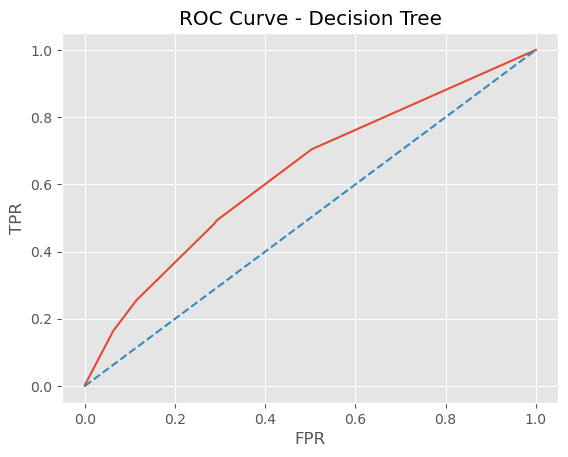

In [98]:
# Importing Matplotlib for visualisation
import matplotlib.pyplot as plt

# Returns a list containing the false positive rate and true positive rate
preds = decision_tree_pred.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                        float(row['label'])))
# Extracting the points of the curve
points = ROC(preds).get_curve('roc')

# Setting the plot style to ggplot
plt.style.use('ggplot')

plt.figure()

# Plotting the ROC curve
x_coord = [point[0] for point in points]
y_coord = [point[1] for point in points]
plt.title('ROC Curve - Decision Tree')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_coord, y_coord)
plt.plot(x_coord, x_coord, '--')

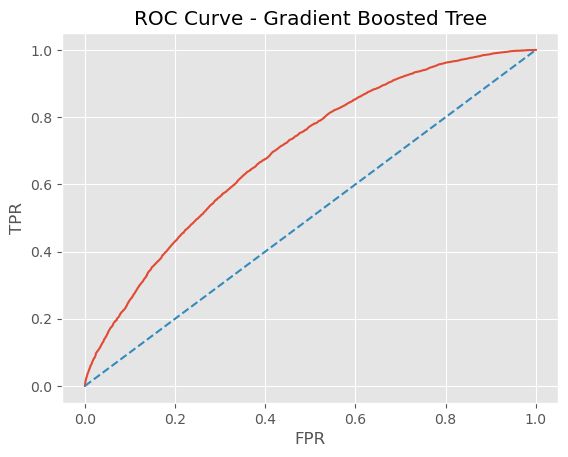

In [99]:
# Returns as a list (false positive rate, true positive rate)
preds = gradient_booster_pred.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                         float(row['label'])))
points = ROC(preds).get_curve('roc')

plt.figure()
x_coord = [point[0] for point in points]
y_coord = [point[1] for point in points]
plt.title('ROC Curve - Gradient Boosted Tree')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_coord, y_coord)
plt.plot(x_coord, x_coord, '--')

Even though it is a slight difference, we can see that the ROC curve for the gradient boosted tree model is more concave than that of the decision tree model. This means that it is closer to the top-left corner, indicating better performance. 

Additionally, in the area under this ROC curve, a straight diagonal line from 0 is inclined at a 45 degree angle. The closer the curve is to this line, the weaker the perforamnce of the model. Given these observations, we can go ahead with the pipeline model for gradient boosted tree as our final model.

#### 2.3.5 Re-Training and Testing

In the previous section, we selected the gradient boosted tree model pipeline as our final model. We can now retrain this model with a much larger training dataset. Since this is a gradient boosting model, we do not need to change the number of features based on feature importance. This is because the model penalises the features that are less significant with respect to `Top-up` and discards them in each iteration.

In our newly trained dataset, we are going to follow the same 1:2 ratio between the top-up rows and the no top-up rows. The difference is that we are going to take all the top-up rows instead of a small percentage of them.

The test dataset will remain the same.

In [100]:
# New sample containing all the top up rows from the training data
new_train_sample1 = cust_bureau_train.filter(F.col('Top-up') == 1)

In [101]:
# New sample containing all the no top up rows from the training data based on the number of top up rows
new_train_sample2 = cust_bureau_train.filter(F.col('Top-up') == 0)\
.orderBy(F.rand(seed = 1)).limit(new_train_sample1.count()*2)

In [102]:
# Merging the two samples into our final re-trained dataset
cust_bureau_train_new = new_train_sample1.union(new_train_sample2)

# Shuffling the data
cust_bureau_train_new = cust_bureau_train_new.orderBy(F.rand(seed = 1))

In [103]:
# Observing the count of rows in the retrained data
cust_bureau_train_new.count()

75654

We now have a larger sample in our training data as compared to the original training method. Let us retrain the model pipeline with this new sample.

In [104]:
# Renaming the Top-up column as label for convenience
cust_bureau_train_new = cust_bureau_train_new.withColumnRenamed('Top-up', 'label')

In [105]:
# Fitting the pipeline to the retrained data
gradient_booster_fit2 = pipeline2.fit(cust_bureau_train_new)

Before we compute the performance metrics for this newly trained model, let us confirm a few things and observe the results of the model.

In [106]:
# Applying the retrained pipeline model to the test data
gradient_booster_pred2 = gradient_booster_fit2.transform(cust_bureau_test)

# Selecting the important columns of the predicted data
gradient_booster_pred2_short = gradient_booster_pred2.select('features', 'label', 'rawPrediction', 
                                                     'probability', 'prediction')

# Displaying the important columns for the predicted data
gradient_booster_pred2_short.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(48,[0,3,5,10,18,...|    0|[1.09107385301112...|[0.89863487471345...|       0.0|
|(48,[0,3,5,9,18,3...|    0|[0.29345647857067...|[0.64265652165972...|       0.0|
|(48,[0,3,5,11,18,...|    1|[0.28693871717038...|[0.63965739063890...|       0.0|
|(48,[0,4,5,11,18,...|    0|[0.23547885336366...|[0.61561040766635...|       0.0|
|(48,[0,4,5,11,18,...|    1|[0.17528375271925...|[0.58675519073969...|       0.0|
|(48,[0,3,5,11,18,...|    0|[0.10892999234459...|[0.55425059119136...|       0.0|
|(48,[0,3,5,7,18,2...|    0|[0.95409915417011...|[0.87081660183958...|       0.0|
|(48,[0,3,5,10,18,...|    0|[1.36648276795032...|[0.93894406720057...|       0.0|
|(48,[0,3,5,10,18,...|    0|[0.29339347940413...|[0.64262758573374...|       0.0|
|(48,[2,3,5,7,18

As was the case with the original gradient boosted tree model, we can use the inbuilt Spark ML class for computing the area under the curve. Furthermore, we can use the function we defined, `compute_metrics()` to find the accuracy, precision and recall of the model predictions.

In [107]:
# Importing the binary classification library
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluating the retrained model prediction
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Computing the area under the curve
auc_gb2 = evaluator.evaluate(gradient_booster_pred2)

# Printing the area under the curve
print(evaluator.getMetricName())
print(auc_gb2)

areaUnderROC
0.7077552404999409


In [108]:
# Observing the accuracy, precision and recall for the retrained model predictions
compute_metrics(gradient_booster_pred2)

Accuracy: 0.7387536796716282
Precision: 0.5003238341968912
Recall: 0.24512137077582105


Now, let us plot the ROC curve for this model:

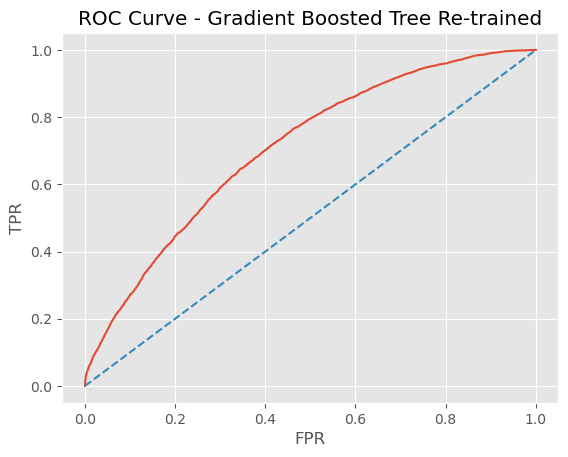

In [109]:
# Returns as a RDD (false positive rate, true positive rate)
preds = gradient_booster_pred2.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), 
                                                                         float(row['label'])))
# Getting the points of the ROC curve
points = ROC(preds).get_curve('roc')

# Setting the plot style to ggplot
plt.style.use('ggplot')

# Plotting the ROC curve
plt.figure()
x_coord = [point[0] for point in points]
y_coord = [point[1] for point in points]
plt.title('ROC Curve - Gradient Boosted Tree Re-trained')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_coord, y_coord)
plt.plot(x_coord, x_coord, '--')

##### Selecting the Better Model

The AUC, accuracy, precision and recall of this retrained model show that it is a significant improvement over the original gradient boosted tree model. The larger area under the curve shows that it is able to generalise better to the testing data with the inclusion of more samples in the training data.

Therefore, we can proceed to persist this retrained model. We can use the `.write().overwrite().save()` method combination to persist and save our model.

In [110]:
# Persisting the better model
gradient_booster_fit2.write().overwrite().save("./trainedmodels1/gb2")

## 3. Additional Knowledge Sharing - Spark ML Clustering

In this section, we are going to talk a little bit about the k-Means Clustering algorithm. Let us execute the test code provided for the k-Means algorithm.

In [111]:
# Importing the libraries
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

# Creating a test dataset
test_df = spark.createDataFrame([[0, 35.3, 37.5],
[1, 41.4, -23.5],
[2, 28.3, -13.3],
[3, 09.5, -9.0],
[4, 62.8, -18.23],
[5, 63.8, -18.33],
[6, 82.8, -17.23],
[7, 52.8, -13.43],
[8, 72.8, 48.23],
[9, 65.8, 15.43],
[10, 42.8, -13.23] ],
["ID","Att_1", "Att_2"])

# Assembling the features into a vector
assembler = VectorAssembler(
inputCols=["Att_1", "Att_2"],
outputCol='features')

# Fitting the model to the data and transforming it
kmeans = KMeans(k=4).fit(assembler.transform(test_df))

Now, let us view the final cluster centers derived by the kMeans algorithm.

In [117]:
# Printing the final cluster centres
print(kmeans.clusterCenters())

[array([ 30.5   , -14.7575]), array([35.3, 37.5]), array([ 65.55 , -16.805]), array([69.3 , 31.83])]


### 3.1 Jobs and Observations

If we observe the activity in Spark UI, we can see that there are a total of 10 jobs created for the process of training the Kmeans clustering model. Here is a small screenshot from the Spark UI Page

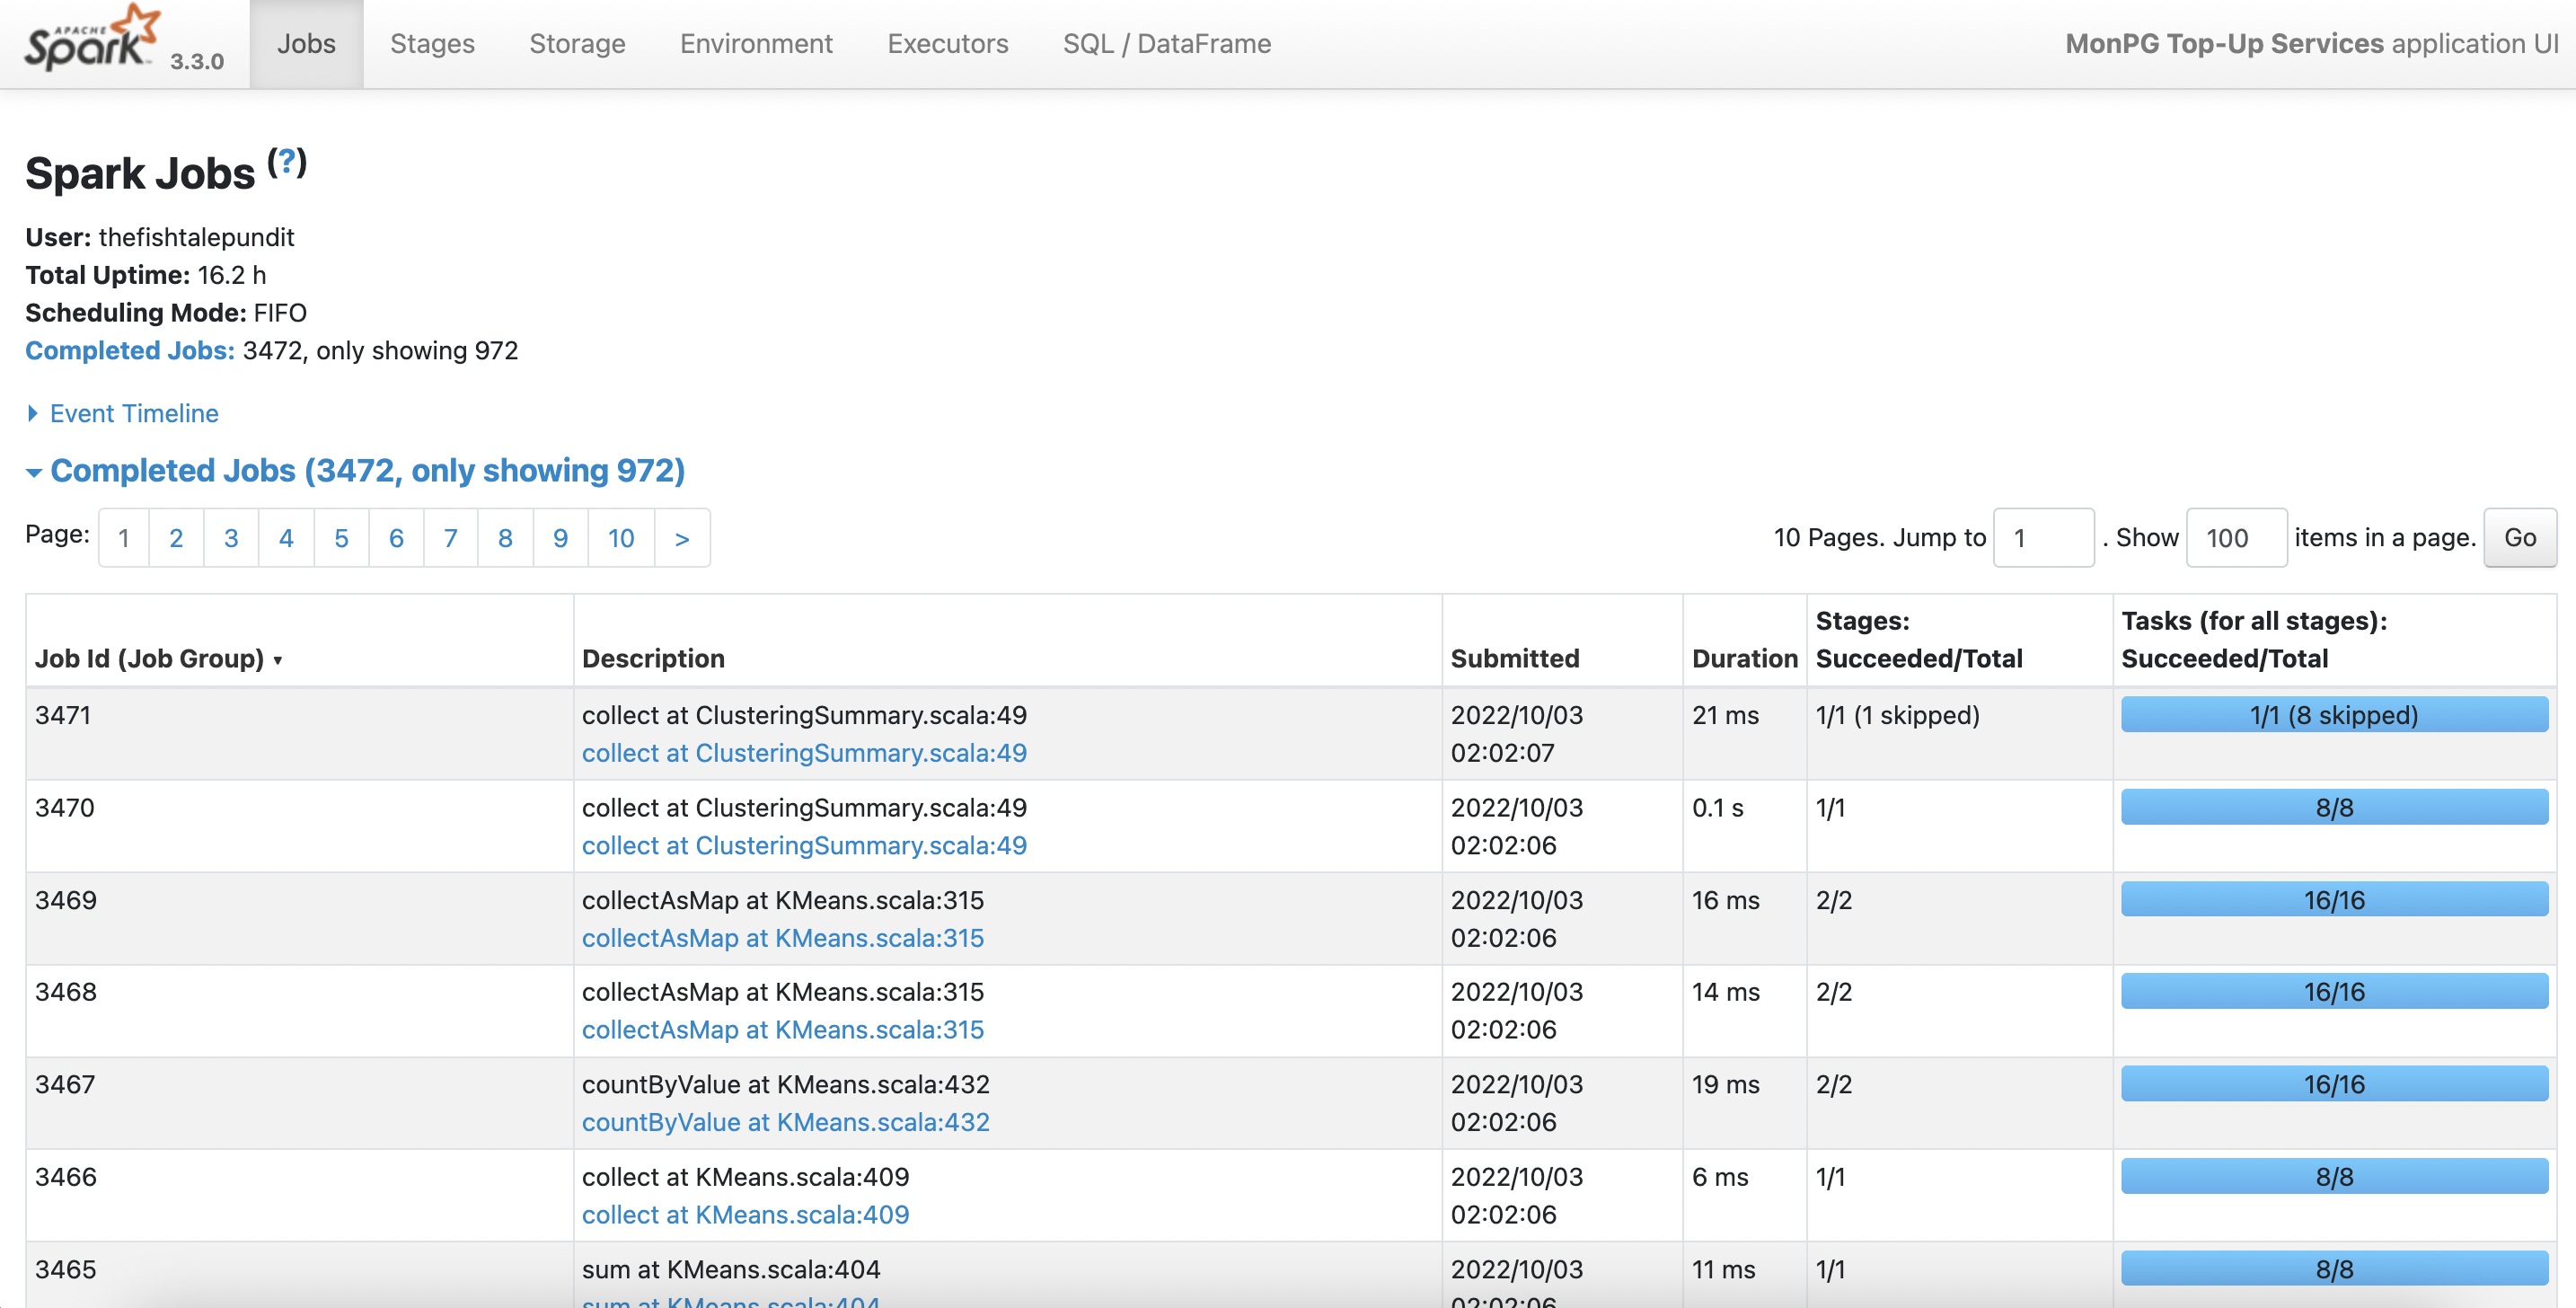

In [112]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAACzQAAAWwCAYAAAAxQOXGAAAMQGlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSIaEEEJASehMEpASQEkILIL0INkISIJQYA0HFXhYVXLtYwIauiih2QOyIYmFR7H1BREVZFwt25U0K6LqvfG++b+78958z/zlz7sy9dwDQOMWTSHJRTQDyxAXSuNBA5uiUVCbpCaAAOiADZwB4/HwJOyYmEsAy0P69vLsJEHl7zVGu9c/+/1q0BMJ8PgBIDMTpgnx+HsSHAMAr+BJpAQBEOW8xuUAix7ACHSkMEOKFcpypxBVynK7E+xQ2CXEciJsAIKvzeNJMAOhXIM8s5GdCDXovxM5igUgMgAYTYr+8vIkCiNMgtoU2Eojl+qz0H3Qy/6aZPqjJ42UOYuVcFIUcJMqX5PKm/p/p+N8lL1c24MMaVvUsaVicfM4wb7dzJkbIsTrEPeL0qGiItSH+IBIo7CFGqVmysESlPWrEz+fAnAE9iJ0FvKAIiI0gDhHnRkWq+PQMUQgXYrhC0CmiAm4CxPoQLxTmB8erbDZLJ8apfKG1GVIOW8Wf50kVfuW+HspyEtkq/ddZQq5KH6MXZSUkQ0yF2LJQlBQFMR1ip/yc+AiVzciiLE7UgI1UFieP3xLiOKE4NFCpjxVmSEPiVPYlefkD88U2Z4m4USp8oCArIUyZH6yJz1PED+eCXRGK2YkDOsL80ZEDcxEIg4KVc8eeCcWJ8SqdD5KCwDjlWJwqyY1R2ePmwtxQOW8OsVt+YbxqLJ5UABekUh/PkBTEJCjjxIuyeeExynjwZSAScEAQYAIZrOlgIsgGotaeuh54p+wJATwgBZlACBxVzMCIZEWPGF7jQRH4EyIhyB8cF6joFYJCyH8dZJVXR5Ch6C1UjMgBTyDOAxEgF97LFKPEg96SwGPIiP7hnQcrH8abC6u8/9/zA+x3hg2ZSBUjG/DI1BiwJAYTg4hhxBCiHW6I++E+eCS8BsDqirNwr4F5fLcnPCG0ER4RbhDaCXcmiOZKf4pyFGiH+iGqXKT/mAvcGmq644G4L1SHyrgebggccTfoh437Q8/ukOWo4pZnhfmT9t9m8MPTUNlRnCkoZQglgGL780i6Pd19UEWe6x/zo4w1fTDfnMGen/1zfsi+ALYRP1tiC7GDWDN2GruAHcPqABM7idVjLdhxOR5cXY8Vq2vAW5winhyoI/qHv4EnK89kvnO1c7fzF2VfgXCK/B0NOBMlU6WizKwCJht+EYRMrpjvNIzp6uzqCoD8+6J8fb2JVXw3EL2W79y8PwDwPdnf33/0Oxd+EoD9nnD7H/nO2bLgp0MNgPNH+DJpoZLD5RcCfEtowJ1mAEyABbCF83EFHsAHBIBgEA6iQQJIAeNh9FlwnUvBZDAdzAHFoBQsA6vBerAJbAU7wR5wANSBY+A0OAcugSvgBrgHV08XeAF6wTvwGUEQEkJDGIgBYopYIQ6IK8JC/JBgJBKJQ1KQNCQTESMyZDoyDylFViDrkS1IFbIfOYKcRi4gbcgdpAPpRl4jn1AMVUd1UGPUGh2OslA2GoEmoOPQTHQSWoTOR5ega9FKdDdai55GL6E30Hb0BdqHAUwN08PMMEeMhXGwaCwVy8Ck2EysBCvDKrEarAE+52tYO9aDfcSJOANn4o5wBYfhiTgfn4TPxBfj6/GdeC3ehF/DO/Be/BuBRjAiOBC8CVzCaEImYTKhmFBG2E44TDgL91IX4R2RSNQj2hA94V5MIWYTpxEXEzcQ9xJPEduIncQ+EolkQHIg+ZKiSTxSAamYtI60m3SSdJXURfpAViObkl3JIeRUspg8l1xG3kU+Qb5Kfkr+TNGkWFG8KdEUAWUqZSllG6WBcpnSRflM1aLaUH2pCdRs6hzqWmoN9Sz1PvWNmpqauZqXWqyaSG222lq1fWrn1TrUPqprq9urc9THqsvUl6jvUD+lfkf9DY1Gs6YF0FJpBbQltCraGdpD2gc6g+5E59IF9Fn0cnot/Sr9pQZFw0qDrTFeo0ijTOOgxmWNHk2KprUmR5OnOVOzXPOI5i3NPi2GlotWtFae1mKtXVoXtJ5pk7SttYO1Bdrztbdqn9HuZGAMCwaHwWfMY2xjnGV06RB1bHS4Otk6pTp7dFp1enW1dd10k3Sn6JbrHtdt18P0rPW4erl6S/UO6N3U+zTEeAh7iHDIoiE1Q64Oea8/VD9AX6hfor9X/4b+JwOmQbBBjsFygzqDB4a4ob1hrOFkw42GZw17huoM9RnKH1oy9MDQu0aokb1RnNE0o61GLUZ9xibGocYS43XGZ4x7TPRMAkyyTVaZnDDpNmWY+pmKTFeZnjR9ztRlspm5zLXMJmavmZFZmJnMbItZq9lncxvzRPO55nvNH1hQLVgWGRarLBotei1NLUdZTrestrxrRbFiWWVZrbFqtnpvbWOdbL3Aus76mY2+DdemyKba5r4tzdbfdpJtpe11O6Idyy7HboPdFXvU3t0+y77c/rID6uDhIHLY4NA2jDDMa5h4WOWwW47qjmzHQsdqxw4nPadIp7lOdU4vh1sOTx2+fHjz8G/O7s65ztuc77lou4S7zHVpcHntau/Kdy13vT6CNiJkxKwR9SNeuTm4Cd02ut12Z7iPcl/g3uj+1cPTQ+pR49HtaemZ5lnheYulw4phLWad9yJ4BXrN8jrm9dHbw7vA+4D3Xz6OPjk+u3yejbQZKRy5bWSnr7kvz3eLb7sf0y/Nb7Nfu7+ZP8+/0v9RgEWAIGB7wFO2HTubvZv9MtA5UBp4OPA9x5szg3MqCAsKDSoJag3WDk4MXh/8MMQ8JDOkOqQ31D10WuipMEJYRNjysFtcYy6fW8XtDfcMnxHeFKEeER+xPuJRpH2kNLJhFDoqfNTKUfejrKLEUXXRIJobvTL6QYxNzKSYo7HE2JjY8tgncS5x0+Oa4xnxE+J3xb9LCExYmnAv0TZRltiYpJE0Nqkq6X1yUPKK5PbRw0fPGH0pxTBFlFKfSkpNSt2e2jcmeMzqMV1j3ccWj705zmbclHEXxhuOzx1/fILGBN6Eg2mEtOS0XWlfeNG8Sl5fOje9Ir2Xz+Gv4b8QBAhWCbqFvsIVwqcZvhkrMp5l+mauzOzO8s8qy+oRcUTrRa+yw7I3Zb/Pic7ZkdOfm5y7N4+cl5Z3RKwtzhE3TTSZOGVim8RBUixpn+Q9afWkXmmEdHs+kj8uv75AB/7It8hsZb/IOgr9CssLP0xOmnxwitYU8ZSWqfZTF019WhRS9Ns0fBp/WuN0s+lzpnfMYM/YMhOZmT6zcZbFrPmzumaHzt45hzonZ87vc53nrpj7dl7yvIb5xvNnz+/8JfSX6mJ6sbT41gKfBZsW4gtFC1sXjVi0btG3EkHJxVLn0rLSL4v5iy/+6vLr2l/7l2QsaV3qsXTjMuIy8bKby/2X71yhtaJoRefKUStrVzFXlax6u3rC6gtlbmWb1lDXyNa0r41cW7/Oct2ydV/WZ62/UR5YvrfCqGJRxfsNgg1XNwZsrNlkvKl006fNos23t4Ruqa20rizbStxauPXJtqRtzb+xfqvabri9dPvXHeId7TvjdjZVeVZV7TLatbQarZZVd+8eu/vKnqA99TWONVv26u0t3Qf2yfY935+2/+aBiAONB1kHaw5ZHao4zDhcUovUTq3trcuqa69PqW87En6kscGn4fBRp6M7jpkdKz+ue3zpCeqJ+Sf6Txad7DslOdVzOvN0Z+OExntnRp+53hTb1Ho24uz5cyHnzjSzm0+e9z1/7IL3hSMXWRfrLnlcqm1xbzn8u/vvh1s9Wmsve16uv+J1paFtZNuJq/5XT18LunbuOvf6pRtRN9puJt68fWvsrfbbgtvP7uTeeXW38O7ne7PvE+6XPNB8UPbQ6GHlH3Z/7G33aD/eEdTR8ij+0b1OfueLx/mPv3TNf0J7UvbU9GnVM9dnx7pDuq88H/O864Xkxeee4j+1/qx4afvy0F8Bf7X0ju7teiV91f968RuDNzveur1t7Ivpe/gu793n9yUfDD7s/Mj62Pwp+dPTz5O/kL6s/Wr3teFbxLf7/Xn9/RKelKf4FcBgRTMyAHi9AwBaCgAMeD6jjlGe/xQFUZ5ZFQj8J6w8IyqKBwA18P89tgf+3dwCYN82ePyC+hpjAYihAZDgBdARIwbrwFlNca6UFyI8B2wO/pqelw7+TVGeOX+I++cWyFXdwM/tvwAqF3xMpRA8mwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAACzSgAwAEAAAAAQAABbAAAAAAQVNDSUkAAABTY3JlZW5zaG90cZrO0QAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAdhpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+MTQ1NjwvZXhpZjpQaXhlbFlEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlBpeGVsWERpbWVuc2lvbj4yODY4PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6VXNlckNvbW1lbnQ+U2NyZWVuc2hvdDwvZXhpZjpVc2VyQ29tbWVudD4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CvqLlvIAAAAcaURPVAAAAAIAAAAAAAAC2AAAACgAAALYAAAC2AAJZAfnEQJpAABAAElEQVR4Aey9Z7Rd2VUmOk+8OekqXOVwlbOqXHaVbdy2C0dsYxu6G8xrDN1jPDBjPPNIdo/RQMN7MHA3A7CJDx42PxqMjTE0tF+DA227HKrKLlepSjndq5x1czzxfd9ce59zrnSlklSSbtC3pbvDWmuvtfdcc80151zfnidRKpXLiYRZuVy2BE+sjL+EIdmSuK6kl8pWTob8BPNLZslkuA83MgX3JUN5XJVRNIGqykxPeEGvP9QXN8P6ka32q3QW/cV/82D8vfDiC1YZ+ngfypJ4ozhIQEBQ0uAMf7HsCbKAwqPENM8PO8qSEuSP30W5gjKhSsglrx93UOhwY8WUVZBZFELMr62Lade37/dh53Wq/Sn0d5ldQ/8y54Ia+oe5IqSx7J7deyT/wXCa/zT/S/+R/if9V/o/JkzZP1CuZP+RDyId1ekRdM5Al0qG7G/5H+R/qcgLjAv5n+R/k//RJw73tsr/Kv+z/O+uT1Kh0vqD1l+0/qT1N7ejIA24FCD/q/yv8r/K/yr/q/yv8r/K/0x8k/zP8j+DDQJGxPlB/nfSQ+sPQT5GjKH1F62/aP2lMl/OnfWXBAQZ4X8A/WFA18L+mOySn7k3bjeUn1KEVVZmjWrODclxgtq/gZ5zhf54zlIhZ8XxURwnOTNaIpW2dEOLJTIZsFCqykdxd8dHR56ST9T/c7b/q6O75qxse/e+hOsS+h/GNDb2MuULP4ogmDjhQOPACG5oxPInsIMvYHt60LYq0sQrw470cpA0qmAtUzfKMjh3iaj2O6M9yzrQGdc17fPeCv3VfiAlAAS19Oe4rqVzqVwKEz6BBuEOV4p5unv3LuxJSObEBK25rCRXTqr0RzHf5or8i593yjF+r/gYZcaX8bGGPhX+i+vR+3OQxtS44XgDvaaUiAkcH6PM+DI+iv4gTKDxDfQU/4n/NP6mSJXaixvGS21mRa5UBE3IjS/jY6Vcjf4R16Pxp/Gn8RePhhuOGn/X+WumUCgWMPExyowv46PkDwgj/YfcccN40vyj+UfzTyQ4bzzcMF6mFIkFbHyMMuPL+Cj5C8JI/pI7buAnyV/JX8nfSHDeeLhhvEwpEgvY+BhlxpfxUfIXhJH8JXfcwE+Sv5K/kr+R4LzxcMN4mVIkFrDxMcqML+Oj5C8II/lL7riBnyR/JX8lfyPBeePhhvEypUgsYONjlBlfxkfJXxBG8pfccQM/Sf5K/s5B+ZsoFYlc47AG2NAFHJk7GuZIZzROj9TMcwIRkUsR4GU8jcMhXBO6yHQvUP0w1BPCgGFmvIX2+BU1y6v9OUh/9Ha5WLLccJ+NXei1wtA1BzdnWtqsYUm3ZTsWWSINUHMyzZLOFnHvs8c9Tf0/L/n/JQCao8DswCUSXBwBkDncXVCG/k+GwX/T8Y/bJH9AL0acuN/ylyBlbtGQdL6slf+Mys9eo/xnVGZ2IyL8+z0epTm6d+euncSyV/o/3KXxT7pVN8k/yX+MCc1/Lmek/wV5QPlwM/l7v+U/x6PaF/3Ffy6SfFer/2j8yf6P9V8fI66Tu8h0ySn/R5CdwUDA8AmBoUCgSNcNpIr20n+l/0r/lf7v4gESQvqv9G/ZH5wcpX9L/3ZfIfVLrb/J//+A/P+afzT/aP7R/Cv9Q/qH9I9gl0r/Ev5L+Df4ZtzXLf8/vVSUjT5HOk2oMYVr+f8DHZxAwv9o/WMG1n8SZSLSaDDHAxUj1SNzRoC1ANRHPsBuHm010nY9RH3khK6Wr5ZzgBsHvDN2XH9VAlBAUjyiYjao9ucg/cuTE5YDiHniyhkbPXXA8n2XAXCctHTLQqtfscmaulZbtr3LMs0t4SfAEDXX+5sTgPp/XvP/3hdf9J8EtRJiJac4vjneCV/mGTZGSsZpUBZxzgvKApaKANCehmv+j/NcZqCs1xKKIzNsQd2CwPHozBRrKID2fWGdRcB0LmnYTtS+V01kbk37UamQ9hC3T5nvxI/o76I6dIYDmp1koSfQPVT08MOf5aLt2rU7+skOUFXyH/wXz28gpPO4s6LTy681/4GLIkMBQ7OqTwRyhWvpH9K/qD8EkRTLG+cbjh/KHz8GPpH+SUcUyCX5K/mr+SeaXzT/Sv/gBCL9S/Y3LZtIHkj/lv4t+4OjITJHY3269lr2l+wv2V+yPyEkfNoM/j7Z37HfIT7K/0A5Kf+L/C/yP8n/Jv8jpkv53+R/c/tS/kf5H+V/lP9V/mf5n+V/lv9d6w+RwznSD2v9zfSn1F7fnv85gaicwK1FX+G4S5sICE45rA0sB6BIOYlJuByirHoO85mEY5L5foPD2fw+pjM/HLB3EBcTcM7/vDfK5UHtz0X6l22i76KNHN9ro6cP2eS5Y1YcuoKuRs82tFh64QprXrnF2rY8bvWLVgLUmjLjn/r/oeD/fS/tC2BldDi63AVCIokFEVwEWDPSmYE/jv8U8oJMkPwJBCNhZof8LSXQJ5H8D8DB0GeU8wmEbWa/UcQDzuzH7Tt3oIB3behTyX/nf81/ZBj81/wfybowSKT/zEX9x8Wz9F/I9jBvS//n/EcBJ/snmu78QD0Gcs4VAsl/zX+a/6X/UBpAFrhMwF7+p4qtHH7aBqQhfWaJ/Sf/Hw0W+T+p6TlnRkOXeo78v9J/pf9zQMj+kf0j+0/2r+x/+T8wHQTXbrBz5P+ICIJ5kv+pTsv+qzCJ7F/5/z2wl48JrX87GbiT/wOyEval8Ffyv8j/BJ1B/icoDQE3RR0KIlL+N/nf5H/DQIC+QP8T8Gj8IV0ODlwAaoi1JexxjSMjnFKEMPJdOGE6yIfrSj6VDmTzi+xQjuRlPo4M6OD1RNd+nyd4vrfjpVFO7c8d+uOz22Ju0sbOH7NrL3zNRnv2Wa7vrBXHh/EO4Jd0g6Wa261x9Wbr2PlGa16z1TJN7Zaqb/R+J8OQP9T/HFYcLfOP//ft2+eChG/HL5QpP1w+4F1dYOCQIh9E74+ZmUQI1xQapArkj9/jp04lVhPoFeXzHuYQVsuN50zzBgODxTcwx7dQMpJzvIPt3aR9vwFFElGd8719yn8aUU40ep64kZz01YPGLud56UUwP0T2dxEnLvORt2P7jnAu+e+sFebLwMukkeSf5L/mP83/0n84o8xP/cfnQs1/mv98ug/zXawHaP7X/K/5X/O/5n/N/9J/pP+5t0r+b1gCWn/Q+ovWn1wvcLtB62/uZuYCo5/gAP9psKPoRgV96P9HttYfA11ocHNGlf8BdJD/hewQjZd43HiC84fsD9kfQVqADtI/pX9K//Z1belf1LMi/Qrr+Y7BkP4FQkj/lP4d61HR+JD9IftL9uessb8TRSCa0R+xvwCjFDMXUoLgQoZvuIanzX86Bd4DfhUQOxDCPEfHAuU9amJl3JgQAxlxWoTCnILCxPJsw7NxShi12p9b9LeJMZsc6rORk/vtynf+2cZOH7RSbsLKhYJjSRmNOZ3JemTmpvWPWPPaXQA3b7KGjiXq/4eE/w/s3+/jn6ObEZlLAAxz/Pvsh/HPn6UjcNY/o6BH0p2WlDEgkEskEsqlBY7I5ykPkfyJc0JynBnKYM+ioRpkUaSx/STlmmeG8nH7LBu3H8s/Jj3s7SN0fyBDRH+610n/EJUZ1GH/4Y9UpTznHMF/27dvZ6bkv+Y/H0Icf5r/pf9I/5P+y5lX+n+YL6nqyP6R/ee6KodFNDaouMr+po1AgnCT/0H+F9qG4IPI/pP/ieODlpePDje3XJLGY0b2l+xP2Z+yPyEgZH/L/yD/i/wv8r/I/yL/CxVm+V/cPAAp5H+S/0n+JzcT5H+DPIjXv+V/lP9R/lcOCG7yP8v/LP+z/O9af5jt6y/AphXp8gwLIzyDdutGL9KYyhcIxo8X8/Mg5HkXykbacKwUx3nxkemExfHIjc5ViIZw4jexNbXvVCCJQROekyazlf6F0UGbuHzGho49b/3f+4qNXTjhC/AldDT5gT+fkkolLNPSYfVL1lnjup22YPvrrKFrjSVTGRRIq/85EOYx/x84cMAXXMkLHP88cgGW4GaOfwcu4/1JAu7J88xDkZflf/9i0O8K/MYbnJSs6rqN6ZI/MZ1xBK1If0LJA9FI+UB/Z8nr6E/axfKfYGWe09j1DUdGxnZlFwkEGTBv27ZtIR970V/8p/EXxgEHRTz+/MSF1q3Hn/QvyCaQyJeiKJsi0eO0xE76J4kQ+KuGNCSPb5K/kr+Sv5K/lAPcNP9QXIIaruyCID6h3Fz/1fyr+Vf6h/Qv6Z9ByZT+7dOo7zinyv4gEWR/OC9UWaNyxnTp39K/yQfcpH9L/5b9gdEg+yuaNOm1k/3pVKAeAdbgOWlCqsj+lv0t+1v2t+xvCkfIxiAcIwmJayqWISuSm55V2TFb9oeTzmki/ZvsAq6Q/hWYwgeU9C+KFWcJypgwUqR/gRLSP+eW/pkoFotlBx0yAjNAqA5Og1URvtAidwf2doYHixPAxvJMduMDJx4phtcIOVb5koP1oQBBbklklMtFaGUoEKXH9fOo9kGnOUT/wuBVGz550EZPvGDDB5+x8atnrQitqYR/VKAc1IyzVKbOkg0t1rx6qy3Y86Q1d2+3TGObpeoaKvyl/p+f/H/wwMEgF8APHP/8eTiOf4KWuVVAyZARUQqttng29TLcBVkTC5vAW5Xy0dQbCiM1aKs4IgW3cOMhtADJxbaidM+Mdl6c6dO0H/KQ6cJu/rdP+V278f1L/FIB78+8YECxDOcA0BTyO/wxCecos3Xb1so8Ivmv+U/zv/Qf6X/Sf6X/y/6R/Rfby9Wj7N+5Zf/K/yH/D8yeYBLiRP6viB8wvcn/B35gJHH682Azy/6V/Sv7V/av7F/Zv7J/Zf/K/o315epR9q/s37m0/i37X/a/7H/5PxwSIP+P/F/ERtAfKP+X/H/0+8n/J/+n/L8z4v9OFGFJBMAfJTL+E6uGjSA1BwaGne9DFkt7fE9Pc8BfuKW6j+rweglyQ0new2Qvz0aIjIsOaj+iIg5zgf6TV89Z/5Hv2OjxvTZxcp9N9l+yPAJ9Ywz7pO4d7YoeAKypJCIzr7WOHa8HoHm3NS1bZ+nWDnACZ//ABnfU/2wDQMoi/kg1X0yEQhEAskzBhjLcvF7xH8hBSjzY8Xfw4MEAZEY3kyn466fopABQRp+EWM14KvI8/3k+zqO+o/yhYsBcbtyHrPAu8VeH1XQvFnbqf6cDKUWC3mn/xyDlQHr0EfsCNXJx1nsCY4/0dy0eaUyP7+Fx65atzMU9d9c+72U9cfuhLvW/+D9wAmWZxn8YHpJ/sVwgb0Sb5L8TQvJX88/dzP9kHs2/0j+kf3EkcIYNe+lfgRLSv6R/Sv+W/k3JKPtD9kdkbnFyCJvsL6eD7C/ZX7K/7tz/zMEj+1P2p+xPjgTZnzEVZH8HSsj+lv0t+1v2t+xv+R/kf5H/Rf4X6kU1m/xPToyH0f8EQHMBHodgNDliMDrlVMGoqg5SrfBKACJWnA1knEr5SiG/r4w6mU08Y6x8VaYftscMB62hlNoPxJtCz9lL/7GLJ61v/zds9NgLNnnxhOWH+qwARvHHRxRe8k2ZIZuxpQFKTbV0WsPSddbUvQfA5tdZw+I1iAZOBsBGBOvt9j+AlGykXMjjCxD+gR/TafBSGvWl0G6o09sX/83o+Dt06Aj6Fn2PP0ZG5lfNoX+CDGE0eI5/7zL0lQPSI/6PwemSPzMnf100R/Lf5TSGKiMyE4geIjbj2sc8xjoK1/5t2bIJ15L/ZGfNf5r/pf8EzS/so/le+p/Pf3ek/2BGp/yV/g0eot0R6Qs4m7JJ/+N8rPlX86/0D+lf0r+kf0n/Cm7KSGnA3Cj/I1Qm+V8xMCJ7hBrkFH1y9vpfpf+jo6T/X8evVRNI9o/sH9l/sn9l/8r+lf0r+1f2r+xf2b/Uj2X/u9Eg/4f8P1p/lf9L/j/5/+aZ/zNRKJbKDITq4FCADMuItOsh08Hs/lNAsIrDEWA2ghN9EPgNKAepGGnLTI9DrQeUYlSeoFMWpw8yur/2GtmoX+3PGfqXSjZ2oceuPvdFG+l50YpXzltubBBsgE7M1Fumuc07uzDab+XchK8bJbP1lm5eYE1rtlrHI99vzau3WKq+xVLZOgfMT+n/AhiKQMpCwRKlohXzOcMO/ycBZM5ZcXIceTkrTY45PyVSdZZqbLZ0S4el65ssWdeI+4MZ7/wm/puR8Xf48MHQP+ALjneCmdkf4S9cuwue6Q7UQqGp3pcgd5ALCJevNdFBF2/urmR9JfxcF/gFd1c2lmObvvlNnoJLHKnMU4j7HXR8BwC+N1DbPoqwjgDhfbjaD28bUwhEgPD2fxTi2DxSM8DNTkXQs8TzuAzG26bNW1jK+9rlWqgiXKMc6cqqyAuS/5r/psh/6R9Bj8IAkf4Vy4cgY3w+D4IDAgTyRfqn9G/ZHz5Ry/6S/Sn7G1YBFUrZf9K/ZX/I/oJ9Kftzqr3teoLsb/kf5H+R/0n+N/kfIQfkf6M7CfOk1j+1/iv/s/zPEIjUk+V/l/89rE9q/YFrvFp/CXIBhND6k9bftP6o9Vetv2r9Veuv7k+eHeuviWKRFhzWv+DY4IYpG/9qEnhOACCAgyEZxyRKMMnLR/kEmlTuA9AQ/2JgHOsNW0gLDhSkxMBCVKH2aylUQxDSdLbQnz2KTh89d9iuPv0FGzyx18pDV62UnwB7pCzdvtiaV27yvhw5ecByA5dd8UsmkZfNWkPXWmve9jpr7d5p9YvXWqYF4Gd/v6j/yUNooIQIzMWJESuM429k0PIjiAA92G95gKTzQ/0ANQ9baWLc+SuVbbS6hcusee0Oq+vosoZla71O8d/Mjr+jR46GroXyH0DMPAIxDHZO0WEAPvLLKI3jn31WkQmRQIijOgcgcsQnLIZTlz8UOwQig3cot/jWIZdp1VOc+cZSDqH2vKgAK+NpbZpf8JYo04HQcZn52X4Ag0Q0id7fxTrP8f6kHfuN8p8rAUUfryQbAM340MEvUWDTps1RT7Cu2i3UIfkPmlWYN2LmiFSBQjFDknbMJ73jcjhq/g0kcepE9HFGxTl51bkvUBIXNZv4z+UfyCT+A1tI/yQR/L8PG78ih8TjiEOH+ZI/kr8xn+Co+UfzD0WCS4dIPmj+DbJS+kfEFdK/OJNO3aR/Sv8kUEL6t+wPislgq9aq20FCgEEqsiOaX2X/R3YK6CH9U/qn9E/p3xShsX9C9odTQ/7PMKeGlSDp32CKmk32h+wP2R+yv2R/yv7EtCD7k0SI7MowTcr+1vqf1j/lf5L/Lbad5pb/MVEsFMvAm1qJDlM6UV2+82etw3Il00IkzTDMKfbDl1o8i5Y0cU/wJwQzknvG7wzRURBhFflF3uc0chdEuJNNAhin9ucG/cEk+IK7YKOnD9qlb/wDIjS/YCWAjoFAtnK63hqWrrMFO18H/khZ38GnbezcCSszknJhEk7opGXbFlvD6u3WtHa7tWzYY/ULFpsxIrMVrJjLB2A0IjETrJwfHbQC/oqjAwA191tuCKDmYQCaR3CNNks51AmuSmcbrGHJKmvZ/DiAzSttwe7vA/eJ/2Z6/B06ctjFSRL97gBmHAkkpoDhnvyA/y5COP4ZKdllDYQFfy6PimXtxiu/228O9fjNnopcBxxX7+NlLH9Yl68HMZE1U1g50BpHsF8CCyRx+6zuVu3zGaMnwbEqI+di+/78L/P+Tiu+KWhG6vE6pJGORfwxLYCZ48jNmwFonmn+U/uaf+PxL/1D+pf0T8xanLogxSnHfebyE+nfsj/AD7L/qN24aue/CSL712UFaSL7nxF65P/gdMFN/h/aPqREsP88YA+vaVNyvOCf7A/ZH7I/wtwh+0v2l+wvTA+yvzhJ4p/sT9nfri6BEeR/kP9B/gf5XzgryP/CyVH+J+FPhL8JvhX5H+V/lf9Z/mf537X+oPUHqMjYtP5yi/WXYqEA/B5YhQt2PMLBwJ+uDT8xAZBhlO4ChQhEgFq5cENQG3+ShQs7jkXEfUApQhnnUk5Y2PEQrFgYpoKOuLtReRotob34qPbnBv0Z1rE0MWrDvfsBaP47Gz2538r5HELuooczTdYIsPLiJ95hybomGwSgefQUojRfPm3FkSHwBPgF4ONkW6c1rtxsC7a/DgDk5QAmT1iB0ZiHrgGsHEVgBpA5ByBzeXIcWOdJAKJzVkQ7pSKOORwLAECXAGYGx6XSGct2LrGGVdsRIbrLVrz9g+K/WTD+jh9jhGbIA7A2ocz+nxf4o5xx2RELZ0oO5lGE8JygZr9AGjbuPaty4mIJ9zAdZbFSwMUCApEtAfmEI6urbJ4elfFVheBUj5qrthQlhEfhRaiEe8+qnLAtPjPT52f7lP/x+/Nl+f6+x0kF1Ix0in3Kdp5wauDVhg0bSRXczvlD8l/zn+Z/6T/S/4K+TLnIiaN6lP4b6CH7A3SQ/SX7U/a3/A/Um11/hoWB+UL+F9BB/ifMDzCywA/yv8n/KP8rxwFUabgZqDfRyST/s/zv9MnJ/0T7Uv43+R/lf5X/Vf5X+V/lf5X/NdiN8j/L/671B62/xHJA609af6I80Pqb1t+0/sh1BuFf5yz+t1gs0hMctmihpOoMRDIAgCFiKR0jsUIMRxlBhMimQ9k3XDioEBeezsRKAZ6gLJOwc3whz6M0HMKm9kFP0hVEcmckyDKL6E/wcn5k0IZ7XrLL3/p7RGo+BPxoEWDmrCWbO6x13W5b/Pr3Wbalw4Z699lI74s2euwFm7x23hAJHFBHcFAKAORFy61twyNW377ICojIXEbE5fzwNURiHrDJ4T4rjg1ZcXwMwOU8sNKI7YE1PMAlQYogaEghuu1TWOBM46+uc5k1du+2TPtSW/a2H6/ylfgvGqAPfvwdOXrUJwa2zIV5V5YwvrnkRCQwnQv84zoUAczcOJFQnjj/+x78QoER9Sjv5fhAYpAlvI3Z3HCeQF6QSiEp3BbfH4oG+cNS/BfWwVBd2HCcrn2m8e753j6pd/37c/AxjV8M8/1LjNKOo49HUKWEDmSfOAAa5wRebNq4EfnYSFfe7CekIPsIR6Qzy7NxrGzsV5T33p2F8o8cE/hP8x87stK97ED2Kfs2nKr/I5qI/2OO0Ph3SnCMcKzUjhPyCjfJP8l/zX+cZTEWCMbgmKB+wZlX9qf0D+lf0j8j2SD903UIN69cd3BRKf2bUwb+OHVUCcSUynQi/Uv6p7NGhU+cO7CT/i39W/o3xob0b9kfsr9kf3JOlP0t/4P8L/I/yf8m/5v8b/K/yf/mtoH8j1X3Gv0n9CmBNeh3q/hV/CROkf/NKUEakVa1dCL9uMn/JP+T/E8YGxgkd7n+myggQjPBhpyoiSskwNCvcUKAIb9wD5UjA+BRAtcclIhGPSJq3DiAbglE6o1/ZpH1hXpZH8uymrgB/KQIF6jZLttR+3OC/kVEU57ov2Qjx/fatWe+YKNnjgJUjP6rb7FM2xJr2bjbFj72DqsHYHmy/zIiOB+wvue/YmNnD3sk5hLAzwQlW7bR0q3tlsrWWZIRh5BeRhRmRmMu5vO4LOAcaYY/8Bt5h2zIW+OfHiAYlhFZUum01S9bbx273mgNy9da2+bHK/wk/uO4npnxd5SAZvRREr+nxvHvoGaMf5cdFFaeRhOR/chndHMRfR5d8+ineAGeTD14VpBVURbzwYvB+YRzXnNzPgHzRPW50kVGQlnf4nJeAveHRivtVU5YrvoY8759yuVAiiC7SU9Sx8lFpsJZ+BaGIGZcYhzzH+/bSEAzymj8zdz4E/3Ffxp/Gn8zNf9L/kj+SP5I/kj+0AQJOrT8HzCg3K6Q/0f+L/n/fH7EeAjzpPyvFfcwfDbuF5b/GW4W+d+1/kBwKZxsWn/R+pPW37T+6I552hTQp+mR53qK1l+1/qz196A3Un/U+pPW35wP5H+R/0n+N/fDVgxs+d/kf5P/Tf63yM8W6UsV8SD/m/yP9EvPQf9rwiM0R3YxrGMHrIGf/YT2MgGA8cK0gxAJXvNsnmBAYA9z2sGmfoHz6zdCFeO4ngG2GNohptBtcrUfCALCOVVnKf0LY4M2efmsDR5/wfq+90WbuNDjvJFpards1xpr6t5jC3e9yeq7VlkJkZfHzh5zQPNo734AoS9YaXzYX7CETme/p7BLpMhf4cWdNwCATQKknExnrUTBWkRkZ/wRTF0m8BkEYnnekq5rslTrAmtZvdU6HnmzNSxZAzD1iuvZD2XFfw96/BHQnIQDnrIjCYcb+5vykeehAxMGqLOns4xvLkzQW7ykbMAh5ISE2nJlAqJ5f8QPLOjn1ZtCnagl9D/riu4J1Tummc9V2dgmrm/W/tRy86N98kVlm+b9nahOZ4LCSWMah/zDnSjvHxjghPVwEZJ5GzZsqFTJE40/yZ8HLX9qGVD8J/4T/3G+usn8F6ZXHzKcDSrzH+dCJEj/D3qG7B/wDxkEG2Z67MlRsv9k/wa92ZmBzHHdpvlX86/mX82/0j+kf3EuoM7gegN27n+R/hkIEtFF+ncghPviwCOyP2R/0Nco+0v2l+xPjANssr9dIAQ9gvSo0SGcQDU72Z+yP2V/yv6U/Sn7U/an7G9qDvwT/izSm2p0J9eqomvZ325yyv8Ah5TsbwgMYs44QLDJ/nJJMevsL4/QjJ7yDuJkz66qkW9R1zGuajXKKZCmDnqofOUyxZrk3YwqgWOc7hXGtaJ+HyA+pXj9an9u0D8/1G+jF07YyLG9Nrz/GwA39wLFn7R0yyKrW7nJmrt3W/vW11r9wqXOT7lrl2y450UbObHX/3LXzlsRkpHRlckNHrU34oAiAJKJZMaSiNqcrm+2VHM7wM4ZKyFqc2F8zArDV600CVAzhUoJkZnxNXKmY5E1r9tlTWt3Wcu6nZZdsMRSdY3iv1kw/o6fOIE+JqAZ/Qwkc+Uc1wHUzP4Hmp3yhoBn/AtRtykNmMr8cIYcpEGmuIYVMl2GIC3IEpTjjMvivquVP5Hcimr1dnAeJiSHovg9vPbboxrYftjiOx6O9v3Ldrx4/P4OXOYnK+Wi05/U8OhJ6JtiCZHUsTHIegA4Iw83rl+/jp3n5bELXRLPBaQz8thOBIXCcW7IP38RMonmv9C9teOvwjFOIPW/+F/jP5Z5HBLxueSf5L/mP83/0n+k/4VPwaX/Sv+HVkD70xWFaA+28I058r/J/xj5MWR/yv6W/0H+B8gBrb/U+H9BjbC5gJT/Sf6nqs/F1SrfgUXkf5b/XesPWn/R+pPW365f/w1zRDxTBH1C9rf8D/K/yP8i/4vwD5gZODnI/yL/C/hA/pfZ538BoDlfjgGFXFABrhQAxKizsJBCw4dAQzeAomPFIHanSewgwI0At1awlFHI6nA/kllvKolou6gPAEcC4Ah0LPOnkiJAo9qfZfQHCKeEqMgJ/JXyOZscuGzDJw/a2Ml9NgqQcq7/oi/JZjq6rBFg5qb1j1grjvWdXQ56LE4M28SVcyj/kvXvfcrGL/VacTLnwjCZTlkqm7VEOgO+qLMywMvJbL0l61ss3dRiyYYmKxcKaOOS5QeuWH7wipUmxhwXlMpkLd3YavXLuq1ty+PWvHqb1S1aZmmAoMV/GGcUtjM8/o4dPRaAzHgYRmam8cw+Zwfy+fgzOA5o97yQ5gYkgV/877amZ3pyvKMbIk6tPafECteRkRpl8uBwadbr8ia6PxEpqNFdvN+3qH3/FIfn121RtaEo9tUS86t9TtYBhIeDg2/C0SMy472ZxnOcQEbg+3fIc1KUuw0b1s84/800/6t9jG+f56k/aP6X/gNZKf1P+q/0f9k/Pi/I/pP9K/tf/g/5f+T/Ch80y/83y/x/8v+6n0P+b/AlfT1w3PEo/3+VHiBIRA84vrT+If872GA2+N/lf5T/Uf7XIKflf5b/Xf53+d+1/iD8jfBHwl8Jf0a9SOsvWn8BHwh/CXtd/mei1+aD/z2K0EwkWi1UD4wOZBqjqtJDBcQz8H2E7tGpGRXFgeG3A+YvJMZZU2vitz2YRL0mYgoD6cq4ka1Ut6l3qf2Zpz8QiwAyTwCEPGbFkSGbuHzKhntfsrEzRy13+bSVRgedH+oWrbLmrU9YC8DMjYjUnGlbGNikmAcIedxGzh21gef/xUZOH7byWD96HZzV0GaZZvy1dCDCM/4ARk43L/DzZDprxfykTQIMPXz0OzZ28aSVRoYBcJ5woGumpdPqVyAi9Ort1rJxj9UvXo3IzABDAxRNLprKSeK/mRh/J44fd0c/ozFTRqTh7KccQWBt8AwnkAB05uIIt3CIzykZvARy+PSUFcxDz0YHvweX08ufcAfLcCM/sMUwoiL54zUyJ954HtpnysPefokKbyS1IQYCtZBGuvh/LnBRPjCFp/jogScEOXevX1+hJPttJvgv7km1L/qL/6R/Sf/kTCr9W/ZHpP/I/oJmAsWlsvG8qjXE2qLrn7J/Zf+7oQEeuS37o5aTpH9J/5L+Jf1L+pf0T+nf0r+lf9M7q/UfeiZlf1TML6eF7K9AD3JG1f+u9VeMFdlfYA3Zn7K/AxtQTgh/gRHhU0ZwysSumamePPlf5H+R/0X+F/lf5H+R/0X+F/lf5rP/xQHN7lyCNhiM6AA09C8aPY3phLa5OAx7aIzlJHdUq6MjEYm8xiG4anjBPCTwE1kA3bCPi/gRl76pfVCMJHInxgzQn4jFctGKhZxZIW8GMHEhN2ml3LgVxoctPzpspeGrNnHtgo2dP265qxesMApgcg4AY/Rgfddaa9/zpDWv220NXasBVO7Au8T9bzZ57ZwNHnnOJs73WHF0wPs8RQCzA5kJZu60bGuHpRqbLV3fbOXJcRsDYHrszGEbOvysjV8+Y4ZnQThnAKEbrGHRGmve/Kg1ITJz47J1aG8B8pyA4j+QYTaMv2PHEaHZnyVEZiafMNJNSCSPM4WXdG4jj4Bn8D8B0L5RXjDP/1H+RBMRMlEjduRZloyOrI/XXi13lFfYKH88LVx6Ena1SWw/tEUnYpRzi/bduTbH23eiRyS52fsHWqFXQB/vnYjUJG0ZEa4ZBYRf+vFIILNfoxM2rN+APTuDN4Cekv+gg+Y/jixyRXwkf3HT/D/D8z/GaBCfQf5VIpqgo8Iolv4n/Vf6P2dBpwKntVvM/7NB/9L8GySX9A/pX9I/OZFL/4z1zvgYtE/pn9K/pf9K/6etI/uHuqvsP3gPoejHLkXOnLL/ZP/J/pP9K/sfo0D+D/l/5P+iwsjVi3CMlQUYl/L/hXXbQBsQROt/IIX8L7HfJT7K/xIoIP+L/C/yv3C2kP9F/hf5n+R/u3v/WyKfz+MD4KCAJqGKE5jGENzu0SPIkJE6me9HXjMf2dDjUyyPzwRDPhU2ZBDghvsTKEfVngvrLqwJmkG1Zf/J6XB/5T6173SaKfpbqWAFRGEuAbicG7pm+aF+y/VftPwwjoNXHIRcBLC5NDFqxfGRELG5ULBEEVFZU2ZNyzdYx6vfiQjNe6yuYzFAxy1T+r80OWqTfVetODFo5YkJS6bxpnVNlqxrBEYZIOVMHY4ZOI0TiMycs4lLp21w/zds9MwRy/Wdt8LYEJwoRUs2tlvd4pUAMm8FoPk11ty1zhKNTZbC/c6X4r9ZM/56EKHZTXtIZ/7ERyIBaYHxTzAwf5nRL1w2MI8JYaNM4H2UI3GZWJLwmrnI5J3hC2XW6WmejPOgFrHGSASFE683KhNFiWc9YavUUL2epv1Iwnkl86V9/ynRKgWnvD/fMdCah5LLfE+JzwlkJi1BaP6Viugz5K0DoFnyP+ZaUBFEc6MVTKn5D19Lgw7UHzT/U68ifwQ9idJN+hfpQQaBLJH+Cf6Q/h3kBOkg+yPIC9lfsj9lf8v/IP+L/E+R/kg9kvYa9AX536BJgx70DMj/SP6Q/Sn7G9JB/gf5X7T+Iv+T/G/yP8r/Gvyu8r8GOkBTlv9Z/netP2j9QesvWn/S+pvWH7X+Kvyj1p+1/j6X1t8RobkIiCGd/3D9R4ABTOce2IqpSeQCVeGowfDTR1wicGuYyyeOOySykIspmAJ8YzozuajgOThnHorxTr8vKuANqX1S5QHQnwBELHgxCnMR0ZVL+XErTeYAVB5BxOUBy40OWn7wmpUGrtrk8BWbHAQIeWgAgOJBww3QcQrh62z0ZzkJIDL/0nXWuHqTdT72Dmtau8PSTW2WytZH3Rv6n0xSLCLyc6HoAB1G401k6i2RooedwFRGeS1aHu2MXz5r4ycP2MCBb9n4pV6Ed54EbRC5t67B6hYuRxs70d42a1673cHTfB3x3+wbf8dPHIeDBF2TTIFPMMKxqkaHCVfXGJ3ZjSaXG0hlMvi/xHT884+/yWP4o/zxSZXgNr9GussjluR56P9QA855GUkZr5P1sW4cvbznh1JBIIXUuH3eOl37fMj52r7TN6L/9e+PQMxOf5IZo9RpUwLYkNfIAYiZY5yFMLyZjg7ZsH49OwHklfzX/IdxB16IxLTzDUdcxCDgG45LctMDmP/QDFtS+6K/+M8FtMaf5I/kr+Yfzb/SP6CKhQ9G5P/xadGlgvxf0BPc3iZNoKu7TQct2m11pMn/AlrMPv+L7G92i/wP8j/I/yD/i/xP8r/5NC3/n/yf8v/S/RsURDd05H/X+gMYQfa//B++fiv/j4tF+X8wS8j/Jf+X/H/0d1ImyP8p/y99ivJ/z1b/PwDNebh9OVojBzBOK5ET6RDmIMYfv9xzRYflCFAMd/mk7+XhMUGyg948khrAbZ6OEnF+Aui42MGK27kOgJvYtNonIV1Y3Ef6WxlA5jz+xgZs8toFy127ZJNDly03cMUKg32IxAzgMkDO5fwkwM4APOdwBPi5XCygv9HBDjwGTzCqcrreUo0tlmlbaE2rtlj79jcgUnO3JbJ1yMuiaE3/o5sJfET8Zb6m8w87Hpzl/c/IrmW0NXGx1/oPPWNjJ/fb5OXTVhzpQ5vgu/pGS7V3WdPKzda25QkcN1gqAk57feBPPp74b/aMv+PHjqGfkw5m5vh3ODOQwpQNuAzHqP9xxbOw50m8uZAI8sf7mek4IbC4tpgXryS669bLeUPOcbyPN0V5gQtDGcof1On1VRrxGqOM0FIla56270SovGT1/ZnEzb/cxrHMjyK8EyAHQLjKH8UDBiE/mFiPCM1Txn80PiX/Nf9p/qc8i0QLB5f0H0gTEgQymPIEp64v4jxcB/kv/VP6t+yPSG7I/nK9g5qZqyyRfiH9f/bo/9L/auxf6b9un0v/l/4v/V/6v+wf2X/uc5P9K/tf/g/5P+T/kf9L/j/5P+X/lf9b/n+tf9BfpvUfrX/5fKD1P66Hav1T659a/9T6p/vNtP570/Vfj9Ds1rRTCpNHtEgcIH4AmOC64oCmsokEB6D4nt92RmVQLljlKARUSsjxRK/Kq/fK4pqj8gEmjXto0ar9+0F/BxoWClYaHULUZQCYr523yatnAGo+b7n+K5ZDJObCcD8AzBPo36IrUoR+MpJyGRF2U5kMoikDqJzNekRmQ7TkVAPAzM0dlmlfbHVda6xl9VbLdixGfhp38seAA184B5Al2L039D8W+MArxbFhy/VdsNHTh2xw/7ds7PxxK40PA39aNMtkUe8Sq1u+xZrXbbe29XusrnNZ4BV+USn+AwXCmJpN4+/E8WPeRx6Nm0gTcIRD2HHuAGeOdSYjnddkEAKg45epvFNUjoB1FuMtMSyZ5yxHHqiVHF5nlIeD3xTznwPmPJG7Sis4xbk/R1Q+HEIJPt5D0D6pEZMkpowDmfH+/kGCE7xsRdLK/wh0Jog5XJcwXnnf+u4N6I/bGf8s7Wpahf5xn4aeDnVE7BH6n005F4Q+1/iPaMS+I/WdWBwNoj+5yzeOX5KGCTiv8hgTxH/ON06gWikaqOQki+lH2iFB4y/QJh5lEVuBl3Cm8QcyxJTx0ecDTuMvjB3JH2cHjpQwXiR/Ax0kf112BslK3ghnLltxGpFH8w8IovlX82/ggqDl+xjhkJH+4TJE+of0L9m/sv+DjhlUCdkfEI3RRFHVsZgg/4fPm9K/pX/Dd1MdG+HMhwxOZX8E1Ur+v6B5h730b62/aP0lUitkf8r+lv2t9R9MjfI/yP8g/wPnRd9i+yGaKKs2BhNkf1OXjg2sKm3CmZMsph+Osj+C5RH2sj+utz8S+XyePANOwZ+fRdzj4yxKRHo0T0dl4hsCyi9BlKDfjC9JcOSVb3EyL+JzHnFbGdFak+UASJ1aFgXoPVD7oENEtFdI/1I+Z0UAhMcRAXn46Pds4vwJK4xes/LYqBUAYi4iOnKxkPNIzASdkv4l0D+Rylq6odnSjW1W195p6bZOy7Quwh/OWxYiSnIL8gBsBrg51dhqqWy9lSKn0NQ+nb7/GTC3VMzb5JWzNnT0ORvt3R+ebfAKHiHvIOpUS4c1LNuICNCvs4ZVmyzbinbrGvFwZBDxHwfmbBx/J06c8EjcSY/IjGckkJn/nD/AY+i+VCIFaQF5QeHi/7GL+C+e5wPYGanI8uGALg+eef48MqKgESztcsvvrICdUSokRHl+He+QVsbMiPjR3r4ns2kvy/pw4vInugGXD0v7fPXa9+eXsoEu6CmSBpHWPUYzLsr4+IHFXZ6jL1i0AFDz+u7uQLgKTXEZn/Mo+a/5T/O/9B/pf5CfLkGr8nHK/BcJTRSpzD9R8XCD9B8SZjbqPz4BxnMeL+JzzX+a/6X/SP+R/iP9R/qP9B/pf64qVfQj6b81/hfp/+58kv0j+w9DIV4OqQoM2b+yf2X/y/9Rda5o/Vnr7+QG32K24EV8zqP8L/K/yP8i/4v8L/K/yP/iU2VlfpT/Rf6XCv4pUprkf5H/BawwF/wvDmiOQYOUbDQIkwAJEMiWxF/JAYkc4wF46ADEWOiB0fmSCZRhpE4PxErABU7KJZTnOccEdgTBEXxYgjERgIR0RiHLBwupxXKzs30+XAkPHgMvCdJ09B6e+fr353s7IfhefKdp3p8OiJKDAWl8InItItPyWPv+bI/0Z4RkB7PgnFtMfy+NJGcy3FsEkNCxnaR7is9HOqMU/hcQAXkCEZnHTh+0gX3fssnzPYjGPGpFgInxIF4nGsINKUvW11sagOFEHYHMACy3LACAGZGYAWImmDjTsciyLQA0A+TswGJEb06mMnfe/3j/Ym7M8gPXbOzcURs68G0bO3PE8iN9ZnlEik6mQ5vL1lvT2u3WuvExa1i8CihYPCOe82b053vPN/6L+5/8F/f/bH//48eOg/US6C4ig3GGg4OPffTzGoyJv0QkVxi/mZuPJz9DefI8+9o7NTo44ztbOwnI38z2cRDVFc55P/KifL/AOSOCx+neVjSu2D5lnKfhNm5sv8wHf4jar3UI8v0h9fz9Y2CzSwvSjHmR7OAl5T/DWFP+dW9YP6/k/1wcf/Np/hX9OdweXv1L/a/+F/9r/M8l/VfzL/g11r+hQ85l+1/zj+YfzT+afzT/zB3/k+Zfzb/SP+jExJ/0L+mfc3j9Tfq39G/p39K/pX9L/54r69+yP2R/yP6Q/SH7S/an7G+t/2j968Hgf0OEZqL48MVajNujCKqsRbo8Yh7K0DkG3Jofec5CNVttUjgHeBCF4rqg4qB0uMnPKhm4mqH2/elq3p9GE7fKowFIRGYsFgIAm2DsJECatZFh/Qa/qQxgMQkE3C1AynxfBxnjOrx52BOsXMjnHRDIupKIVJvKVEHNNN5ZD0s72BmYyhIiozKBEVLZtv8hgWW9fBHRUnFPCde8Jw3gb4IAZdwz2X/Jhk+8iAjIL9kE/ib7LlgR7Reid2LfJlJlRGNuseyCpVa3aKXVd621+s5lABUvQPTlZkum6yyZrfOoycls1hLpjNdPMLsjrivviJPK+U36H8+YAPhx4upFG+rZa2O9B2z83EHL9V2yUn7SQaxJPEvjsm5r2/Zaa1qzxbLtS/EcLXhjvBD7CP8jVvL2qm2Gy5B9k/ZRxPMrnYyrGeK/8CDzr/0eRGgGg2Ac4N3QX/xIgtd+iK+9L9kX4CHQ3/s26s24a9yJAcuAHwG4CIrlT1Su9oAWrmcJz2ZdAZbMEqECLxs3UjP+/Qbs4ixeM5rzw9I+ZYm/M3aBRpAvtMxANpLJPEJzkDmx7ImPBDlTbnV3d4d7vUcpP6O6olTWfyf0d2SMdz5ujPvfK2BN1a02KZxr/M/2+TcwAnpL8neK8IrHjHM3x5/4PwgNjf9Ah1phF4nA2iTJPw4nyX/Jf+kf8VzC8RBPMn5WycCV5t+YNC5NY9Jo/gUFpH9I/5L+Kf2Tk4b0b+nf5ANXIHx2rOxqk8K59G/p39K/Y11S+ndVQvhZhTC4kv0h+4P8EG0xa/il7A/ZH7I/ZH9w0pD9IfuDfOAKRDRZRIfapHAu+0P2h+yPWJeS/VGVEH5WIQyuZH/I/pD9UZlQ46HhCXPI/gqAZjx1PNTDMYYCVN4vWtMKuXFZz4WhkUjUxPV0SlCRqKbFxImPvM/tEyZEW1zng2x/Ymzc+vr6LJ/PWRZg3YaGBmtuarJMFmBd/MsXCjYxMWFjY6M2PDhseYCG0+mUNTU2Wmtbm5cnGJPvXyiWbHR01K5dveYAvo72VmtsaraMRzAGuBjvOTE5aaMjI6hvzEbHx5ym9YiI3Ig221oQDRllS2hjfGLcRkZGUW/C2tvbAVBO2PDQMNooor601eFZ63Af8ycncqhv2AaRn8vlAGROW0NTo3V2tFt9AyIto8zElXM2dPQ5GwV4OHf6gOX6L9skwc8ESXPDwxFwmmlstbqFywBmXmONKzZbw5LVlu1YYqmmVksB0IwH9PocZBru9I684/4H8JERqifO91rf3q/iuV60PCJIF0cHnXaWRZTo1kXWjMjMna96K55lU6V9St2YV/wR5jD/UU7EW/xO4Tj3x1/PiWPgK4D1Aa4H00SA5nAk/xBpTwi/b7jmGdPj93emjNK8jAuPkDulzHX974Bctgc+4ScBXpYAeqR5FV7ZVPlTmz6l7qjsw9Q+QclVEwB0wjU3fnHMfix7JGaOX5TiHx0MVsR1KFuCHOxevx50n/3yfz6PP9Ff/BdmSoxLjNAg12KpijQkiP8pu8JWSx/KP84cQfJF+ZRvkH+kZlzWc66bfwKxebf4T/xHTtH4k/yR/I1lZhgRmn80/0r/kP7l06PvauWD9C/pn9K/ZX/I/qqRj7I/ZX/L/+DWdKwr+OiQ/wVu+aqvSf4ncAXGifxvVZ6Q/0X+l1hmyv8SdCr5X+R/kf8ljAXua+WD/C/yv8j/Iv+L/C818lH+lznhf0nkcpPoKkILcYAhSHyaRzMFWI0gV+LZApAj+jQOCQQHeiRgP6I8wImMDuygwSifYLckAI0ErjKKr1+jYhTzenl/KB9afPDtl+zChQv23HPftf7+IVu0sNOWLV9uq9assQUAEfN5xwE8vnjxkp09f85Onuy14eFhy2aytmzZUtu6bbstW4qowQD5ErIwNjpiZ86cRX3PWRHA4+07ttna1WutpbXF6usbPK1/oM+OHztu58+fR5v9oFvKOjsX2PLlK23d2jXWDFDzMEHRV65Yb28vgMtZ27p1G6Ijp+z48WMOhG5va8c9nbYAf+yfKwBQnz93LsoftRbUsXz5Ctu4aaN1Le7CkwFsPXjVhnv22XgvoiEfe94mr523HJ6RfUHlpQztHoGiLZmpt1Rzm9W1LUKU5uXWsHgVAM4rLdO51LJtnZZC1OREKoMI1alX1v+gWLFYsPHzx+3qd//ZRk7ss9LgJStOjDivpeqaLN3RZS3du23Bo2+xhuUbgI2FygU+IkPOD/6baf6/v+2fQIRmjn92Gcc/+4zYZkoXnuO/p5MDmcbuZSJlTQJ9zC0kQYagDMszmWncWILn4cizSD7hjBv5GrViX5NOC4aWrG/VGsj/bJ8p17fPVh6m9p1aNfTnKd/fKeoHyosAaGaHEMjseRAmno4jIzS7vEe/z175f3/5X+8/2+d/9f/M6l+iv+hP+4IzzsNof4j/xf/if41/yT/Jf81/D97/p/lX86/mX82/mn81/2r+1fwLRzYWGYI0gEcbvu35vf4p/Uf6j/Qf6T/Sf6T/SP+R/iP9R/qf9F/p/5wNZf/I/pub9m+iUCgQoQbIGpFpEarPP13CuWP/Qjo+AnawH+Ft/HrDizIr3IW7WTiqw4+VjFCPAwlDK2HAsD4MngipOF37/lQAPBQR9bMwmUfE5KIVS3mOtujZkh6RmFGLM4hanCIqt/IcNaf+aOH5+IQlRF4eQ3Tm4z3H7RtPfd2jKi/pWgIg3gbbtXOXdS1d4jf39QOADCBxT0+P9Z7otYGBQQA0y7Zm9Rp7/fe93tau7ba6ujrLIfLypctX7MiRQ/btbz+Nxyvaa17zuG3estm6lixFNOU6Gx+dsHPnz9r+A/vt6uXL/gqMpLxo4UJbvmy5rVm7xoHPfdf67NTpk3bgwEGApVP26KOP4L3Stv+lfZbL523NmlW2AgBoPm8+X7BTJ0/Z8RPH7fDhwzY5OWFLly7De6yzHTt2oEwXqJGw4tigjV84ZWOn9tvw4Wctd7HXJgHWLhRzEf3Zq+jXZBrg6aylG5ss29KJ6MyLLLtgiWUALs62LkHU5E7PyzQgYjOiTycYtRn9x3931P8EQgL4OHbppA3u/4aNHt9rE5d6rTgy4BFfkwCApwGqblq3wzof/f4QoTkVIkQ/SP7Da2ELPD0T/D+X2yegmSD0AGomh8BoIj2x45jnP5zwv59zrBP4HMgdyRHm8R6WpabBIzrC78UpxUDUPdUjy3hhlq3JL/G6ImW8fJA/oUwlx5uutl+p+CFpP0Rirr5/cPhgfHs0d47zYqAdzkpAM3PiZ0eECM2QIjih/PGtlv53If+9/6IO1vgDmX0wXMf/IHQg8xRii/6kwBSShAty9u3qH+I/EjHIAo0/jT/JH8oQyd8p+hcoEiTrFGFLwRFnREfJX8pSzT+af6V/YCTQbIBIuJX/R/oXhaj0L04g0j85XjiHSv+Q/gE+wH/3f1XULPJGkBXhWMmQ/uWkCfSR/iX9S/pXkB3Sv6R/Sv8OE+nLrf9I/4TMkP4p/Vv2B61R6d9BbGI8ROYFaSL7o0IN0mUqSQJ9ZH/I/pD9IftD/m/qk7K/ZH8FReJe2V+I0JwHX4XqfA5G/QQfFgEk5hTsadxhJi4BfRigq/iSAwC/ADYMTlT/2SNyKDYvxVOi3GJwtOeEHXGLxBzyzqh0dB7qjNtn1Oc8QLzj4+M2PDhkw+NjNjE+agUAedl+NpuxJoCCW1paraMDkYXrGhAFll+b4Slv0f7o2IhdPH/Bjhw9iojK3wNQud8WLlxkGzdutCeeeNxWrljl73/p4kV78cUX7dSpkzbQ12+DiMI8PjbqAOQ3vOFNKL/eGhsbcf+AHTy4H6DiIwBAH7cMojbv2LXDNm3YbGvXrbE0rhkN+vTp03YC4ONUOmmbN25xUDKfuamxwaMz53I5RIS+YCeO99jzL7zgUYw3bdrk73Ti2DHLNNTbqx591NZ3r7f29gU2OjqMdg+izhN27txptJO1DRs2ev7qtautvbXdI+SW8jmAmocBau6xIQCax04fsMkr56wwNgRK+fSK941YCp2TxPOmEIk6DZB4MltvSURMZnTmVDsiNyNac+OStVa/bKPVtS80D+2cSIEXGKH1DvofAMnc0DUbPXfMRk/staGDT9vk5dNgGQBbAaxOoO2mFRutY8+T1rx2ByJEL7JEI0DU4BT274Pgv/A25FBsM8D/c7n9E709PvSTKbwFeQrCgl/E+x9YjtGTIwHiaS4JgkBxmUCgLC/9K3qk4DuCivxhX5DXEi5byLfgYoKVI/5jvrM1QcgOYibH1GxIS6Asi02/IS9qn/leHXax/GPCfG3fAcqgVvz+PPL9E5DlfH9+cUDQM8cfKUPAs4t5AJ2Zxg8VutchQjMJ/grlf9xn4CFN6gAAQABJREFUfqyhP3uTbQV28afD+R3KH9zPO1EL3zY6D3XG84/adwKBPthE/8r4F/9p/En+SP5q/okmBs6hmn9dJyRFXKPgpCn9B8QI+hnpEm+3a/9L/woUk/4FOkj/lP75gP2Pkj+SP6SA5K/kr+afqv9T/g/5P+T/kP9D/g9qB8G+lf9D6y/x+qP8P1hRo9Is/5f8X/L/YSDEngTOF7i6TfxTfJfsTxBN/j/5/+T/gyQR/k3+B/kfbuZ/SAAwTIsMwyQMlMrcC2XUwYS0WgnuC3MKi/rG8gFdHky6OD3OJSgMsDdchmk5npTLBMU5GI01BGOQ99S2T2Dv6MiojQFAPDA0aP39A9YPQPHw8JCDmxFV2svXZbPW0NAIMHOHLV682BYs6LS2tjaAjBsAKs4GxaGmfQfiofnLFy85APnI0SOIvtyLaM1j1tTcbJs3bbY3vflNtmbNGl+HPXfunH37macBaAbQtlgwtsu/ZcuW2atf8xpEal4NsHEKYOJz9gzKHQPomODmBgCP13dvtI2bNti2bdsBNE4DpHzcTvaetHMXzwFo3GGve90TtmLlSr+fIOwkoksPArR9srfXjh0/aocPHva2VqKNcqkI0HIPQMxt9sY3vtE24TmbW5qt79o1ALKfs17cMzQ05MDurVu32tq1a6yra5k1NzeCsnhh9B9ewHJ9l2z4zCEbP33UJi6esPzgJSvlJqyEyM65yXF/xyT7GrfwnhSeyw2TVNZS9U2I1LzEGpZ1W7ZrvSW6cMR1tr7Ro2NnMhkHXuNO3oxWX77/C5Ojlh/qs9Ge/Xbt+S/a2Jmj/jzlUsHp37B4pTVveQ0iNe+2llWbLQNQc3i4wC/3i//8FWaQ/+dD+z2IaM5O5PigHHFAM3kRAGeCiRm92fkMafxXJsgYmj5Zj/cBJxvkC8qRfT3d5YUX8PHPOpl348bEyGqI7vT7kVyeksxyyGF6ZHhd3z75/2FqP7xslf5wUwUaO6F5Hq5L0QcvLlM9LeQ5oLl7Haj68uMfdwT6Y89z8gH/+6bx5+PGoyKAviQLqRVvpJfkHwfnVLoE+tze/CP+0/iLBY7kj+Sv5h/Nv9I/Ig1D+pf0L9pXNNKkf0r/hliQ/RFbX6SF7C/Zn7I/ZX9PlYvyP5AC8r/I/yn/792uf7oMkf0l+0v2l+xP2d9QJ7T+BUuDqnZlk/0p+1v2t+xv2d9T5WIQkLI/ZX/K/nwY7c9EbjLn2qKDCiOVqQJz4XwBw9qBgzwnENGdVUGIRLq2yxDeQ6ygK13UvghaRgJ0UWy8KyilvApblBY1FrdPwFw/QMGnT52yU6dPGoGRVy5fsgGAfccnAL4FsJiVensAOxIw2draaouXLLF1a9fZNgB6l69cYc2I5ltXn53SPiM+E5Dc09NjX//61wEcPmaT4xNWBNg3hajA6zest7e//e04bvB3PnX6lH3tq1+z8wAsZ+vqACJutYWdHbZs6XLrXt8NwHCTDeG5jh47al9DfWcRgTkBEHBLa4t1Le6yTZs32qte9ZhlMnV28NBBO4P8/v5+6+xcYI899mpbvmI58J0pBzOnU2m7eu2qHTp0yHpP9trlS5cda7MEQO08AN5HAZZmVOa3v/1tAF5v8ue5cOG8feOpb9rZc2e93UWdnbauuxtA6RW2eOFiPG9T9f0BQCwDvMyozLnBK4jQfNYmrpyx3OWzNtl/wfL9V6wwMYxIuEXcA+ryj6BT9H+aka+b2yyzcJU1rtxs+ZYuu1zImCFqc0fnQjxXh0eYbgCN2C+++ncb/V8CcLmMdxs/f8z6n/+KjfTut8LARStOjnkVqeZ2S3eutNb1u61j17+y+i4AJcF0cdTe+8F/fHy+A1mYuwfN/2x2PrTfgyjjjM7sIGUKAtCSciTuPx5x4cB1Bzc7vUn1ICl45p1ANsRJABbzfiREBPL+B595P0XFPS8CLd8ofyqUZe2hmriu6Pr69r3/H6L2GXGZkjqmf6lYcvoHYDNTcQaZECQwIzXjDLLCI6vjWISMXQdA893K/0q/8ATNafw92PlX9K+IF/Gfxp/kzwPW/yV/JH8qWprkj+SP5M8D9b9I/kr+Sv4G14PsT9nf8j/I//Ag1z80/2r+1fyr+Zeedukf0j+kf0j/kP5Rs/7rq5ORjkD/ICdLbDxw2dcvKTxvA3/gK83RZMsVz7CmGdWNKiR/QQv53+R/A9Cigr/Q+KNYcDnj+BPJH0pKp4fkb6CDM4jmn7vCf8a8JPsHlKB+o/n3jubfBMCysBiAZgeQLWiHAAkDCcgInGF4QtVjlFTGeAaF/R8ITQBbkOpI5YSH66AUlnCd8vsdfFhCfQA2hvKhhDNtNCs446L9EkDFE+PjHqX4/LnzdujwQUQlRlTjk6cc6Ds2imi++YI/GxvmPMLOZqc3NDRYJ6Izr1m9xrbt3G6bNm7y6McdHW2WTmYsneHzlBGFOI/Iz8MOZP7mN79pFy9etNaWFv8KdHBwwFYsX25vfevbbeOGjf7Opwlo/trXvX0Ci5cs6bIuAKcXLlqEaNAdABrn7cyZM3Ycz7lv3z4bQCTpekSHbqhHhOhsBs+zyp54/HUAODcjevNxO336DIDKFy2LyNIbAXZevmw5Ikq3Oxg4nU7Z1StX7MUXX7JLiCBdKOatri7rUadHx0bt0MGDXvatb3mrbQDgmmBQAqS//tRTdvbsWavL1nmU6nXda23lytXWubDTmpoa0FE30p+A4dzQNURsvhhAzdfO22TfBSsMXrMyoiaXEa25kBv3/k/XNVqysdWsqcOKzQBXtyyxvmLaTl0dsjQAzYwWvXLVSoCa2/29+VXAnfb/BNofPPysjRx/wSbOHLHi4FX0V9EMUbaTjW3WtGardT76VmtatRVtNlsyk434yVnynvDfTPP/fGufYwLDGkYmAfsYpOBXcCLGbxAbjEruoGYKA+axCM9disTGJWRKBIaOZVOQID76UVG4w290UQA5g58+j6UMa2GZWmAz0xx8ywajjbX5pVvHvLvavj8Vi06XNw/b52vWvn/02hX5T5JybqC8p/z1fzxnQfwv4iOF7u4NXuZO5P9843+PYE3w/TTyl2znrINs58JZMP+K/jOr/4j+on88x8yE/i3+E/+J/zAhY0bW+Hvw9r/kj+SP5I/kj+Sv5h/Nv5p/H/T6g/QP6R/SP6R/SP+Q/iH9Q/qH9A/oA1zQ42rgA8B/SP+S/iX9S/qX9C/pX5x2jhw9YocPH7J167pty9Ytlk6lwlzE+QigiXuNP9T8o/lH88/cn38SuXwOYzn6CtLhVWBsR1lhRzAgwWpJvGiZIbz5wshmPpNwTDLfbyAMjkowwIBRfjhgT7Abb+CN/M97/R6mQTghCigOdvHSJdu//yU7fOSwHT9+3C5euGSjwyM2kUcU5ULJo3+iWKV9Rg1l+6l0xkHC7W2tDjreCJDt448/jojNa62pucWyGUQTRtnhkRG7cPE8IimfsZ7eU3isoq0C6DifK9gJRGtubGq21772CVuzdg2iKmcRmfmCfftb37LJ/Lht37rDlgLw3NjYCAB1nWUAtr3Wd80OHdiP574MQHYJQjdp9Q1NAF7n7OrVqw6yfvyJ1+K4wPpQ9iSiTr+07yXr7+sH2LgZgOYu27p9OyI+L7PmpiYAp68B0PyCDQ4NIorzImtv67DW5mYbGO63fS8dRFTmrL3+9a+zVatWgV4JOwnA9TcRGfoUI0MDtbkIIOYtW7bYytWrcb7I63Q6X0d/KxatiGcsAdhcQtTm/OigFdFGrv+STV5F1GaP2IwI0QCg1nd0WbljkU02LrbLE2bHz1+20xcv2/kLl21h1xJ725NP2uYt2xxsXV9HOt95/+eHBxAp+owN97xkAy991cYv9oApyEuAw6YyVr98jbVtf6M1rttp9YtWWqYZAGvyEJjmXvDfTPP/fGy/5wQiNGO8JxBBnWPbhz5BzDCO/R/4lbBhz8SOZSsDmzcwg/KHp5Q/AIa6XGGOCxC/GxwSyx/eUT3nbbx3Wv5HdaH+IOs4PPwraCbXPJM36Jl31/5lyLNDh4+gyjJAvuv8I4vooR5I+3fz/q7YOdGxA8H9QxbQn98XkP4OXIac5/culL8JjFN+VxJETNEjNq/Fu8ZknI7+18v/+cj/ev+bjz/1P4dHGJ08iP9nVv8U/Wcv/Qv4BY/v7f2eXbvab3se2WNdXV0VNYHzkfS/WOehrkSdOdKTMCcHCUMBgwufkHDO/5yvo1wexP+zl/8fhP2t/lf/B/sHwoAyhAcXDJApkB332/8j/pue/4aHRvALZSfc/l26ZJktWrKYHaP5j/zJOQxHzf+a/4MuI/1H+p/0X87blIuu7vsBF9L/I4KAFvwv+0f2nyu5YAQOjxle/1T70+u/FGSyP2R/yf7khHX/8BeSP5I/8v8QPQBl4D74v7iGTniD76R/Sv++C/ujDPyLs2fERvPZ//XUN56yr3/9Kcx5Qf/buWenvefd78Urg3APwfuHfkZ/z0P9N1/I28EDB9mLwAy2OtYy1j9yCFj7/PPPOa7ykUceRfDYpXNS/x8cGrLvfve7DsJ/9FWPOQ4TnSn57xg/kOEu5N/t6r+JXC4POYEWHLQcJnUakS492TI3n4Sxi0RKOPPEMOiQQ3AbN+ZVPGpxDPpwA3N8i2oFGJE1JmxyYsKGR4eweNNjTz/zrB0+eMDOIUrz0PAQHg0lAIJMIepzRSlAWgEgaI/iy0HPerDLALjcBMDxekQIfcMb3mDbd27zQdHc0syGbATRmS9cuODA4eHhYWuoqwfIcJUV8nk7duKoR+bauGmLLUEEZgKa+/oBWD6EwYe6t2zaigjIi/AsjDIL1zHqu9Z31Y4cPmpjoyPWgsHZBFByHaIvj41OoJ3z1oAIydu2brMFnQvwjpPe9oEDBxy4zYjUixYutG3bAqC5oaneuIB1FJGcc6AHo0G3tbdafT3S8dw9x3sA7k0CPLzF72P7ly5ftBf3MqIzoiujPkZJXrtmrb9zR0c7okXX+3sHAgXac389/cv5SStMjiBCc59NXD1veURMzg0wSjSAzw1tNpxqtKuTKTt9ZcCOoI/Onz9v/YhGvW7danv/+37Ydu/ahXdtdFA5+yLu/zyiTI+NjqEPSw4qT7PlwqQ/QSKVBhA9awn8lSHkimh/9NRhu/q9L9vYyYNWGkffF3Le59nOLkRp3m1N3busBX91C5aiT8A9zkCh/18J/800/8/H9nt6TlgCkZn5tXsVxIy+cqHGI7qPfQjmdJ6B/EFplwdB/niWlye/Bvhz4FxKqTIM/Fhm8f7p+p+OkAQFAwvETB+d5gCU+l9f+YqPY35M8K/e9AbnWz5Fbfso7rfeTftf/+bX7e8///fe/pNvftLe/e53s7roUbwlXOHhppW/ISsufzft3+r9+RSB8lPbp1ypfX+PxMxHQToVyhCJmbKXvQCqcw0Jz1+sRG0u4UOSbiZG45M3h0vsfYu7wofvTd8fN73C+ScH+dHb0wt5e9HOnT3n0fTr6ups+YoVtmzZUluBCPmrIS+np/8rbz+a4Gbs/dU+2I3M9gD4byI3ab29vZiLyWvnwWunLduQtZXLV9qy5cv8o6U1a9Y8UP5X/z+4/p9u/plp+l+4fMFO9py8Cf9PL//5ceCrX/UqEG52yL9nnnnGvvyVL2MqSFgDfv3k537u5ywFHZxPHyalMIvNRvrPdP+r/dk7/i/CZjvZi7F5U/0nZGHvUxj1vxR+xeexxx7jHeJ/jf95Kf9of5yCHkU/zQWMEf4C1sTkpK1asdJWrFhuS/BBS/e6dfjVrextvz8/PN/7wl7/Ra6+vj7rHxiwFviEFuJXvRYuWmw7d+yw5SuXYVDd2v91FFFD+NE5S23fvsuaW5v8Ho7H+zH/PPudZ+xLX/qSi4gffPcP2q5dO10W3Gr8U//s5ZyPktPZf/x1sGb8KllzcxP8XIsDHae1P6P5FTWFoRZararTUT5oxpz78f53Y/8dO3oUHz/13fT9+TrB/qzqPwx8sGQpwOIv0/9OU9wfKDE735/PFvvfNP9HnR06jJTxLfR/7J5A5jzif/U/uhjjmGNV/B/IEAks533uxP+BFPfb/yj+i5hN8rc66DT+JH+C+InEg/QP6V/UVfAn+wOyIV5/xbh4het/mn+nn3+vwQdyBEEDr1//fWTPowiaVw+yU0O8Nf0vINhg76ke51lO77T/ubb/mle/Guv6jKZKnp6+fdbObSb0r0KhYN997jmInJI9/e2nbWxs3FZiPXjTlo1Txh9xNy2tLbZ06VIERWwCTfiWXAF/eft/aHDY9u59wU6dOeW/2j6AX3/njS3wu3R2dtqGjRtt8+ZN1oFfZ/d1jDuwP4sAR3/3O88icBieJ5IZMf1JU57H9s90/h/Pxm7jxg22qHPhHbd/O+8ft/+g+p/4re88912+WuX9uxBscW33Wqe7J8ZMhzLx6f59+4AJG0UCUkDLbKbOHnn0VbfF/95vDoq49/6vibExO3jwoAf2vHLliuO/yH8rV65w/+dSvNuKFautc9EC7+ub9f+Dov+9bJ/+39/+L//FiM8JnRk69SO/+BFg4eq879je/aT/7cg/tY9euAv+7+/vtz/4wz/0Hlzfvd4+8IEfq4y/Z55+1r705a/4+GPg2J/7+Z+zJNZ6yQd3In8ftPy5nv//+tOfQUDeY8Tg2s7tO+y973svGbayxaczMf/xIW63fa4/MFBvKp221zz2ar+T977c+HvpxX02Ckws55/HHn3MMlkEuo0aHYNs2/vii15XZ8cC27R5S6X/74n+i8WichydNDwooyUDMAAhT9BhOOIakobAROLXqK4w5DsVGB6R7HMCRTunfAct+iSBa9zHxdhiAoTBmd+HnvRs1FPEiw6AyY8hIvNBRDv+HhD6p0+dgaIxikjHeZRAewC/ZgC0SGfSlgRxy1BKxgH6pXJS4nO54osFX0SDJfGWI5LyI488Yrt277LNDlBe7O2X8kUbGWW9OQfrZhDGvq6+ES0wevMwnjLhCz0NDY3+DjmAlAYHB3GetFYoI/UNDaA52sEdfA/m9/cP4hkKAPMyanMm0AhMwI4jI7S1ApSMvHy5YJPjob6JyXE8exGA6iyUpg5vM4lnKeJ9hhCdmTQn8I6LT6Qlyw4PDfuCdjPqa0Qe258ADfoQ7XkS9ZEOWSzyUfmiMGBU6hTodTv0JzykVCxYGXQpTo4iavOklSZGbQg0OXe5z3rOXrD9h47ZWSyWDQAIXgA4G6TyaNA/+N73YUFwe+X9a/t/AF8qnEH0aEbZW9CBRTQqYENXQL+CpZraLNPUagkApjN1ga6Tl89a/4Fv2FjPfpu81GuFES5MQddoaLFMG0DN3Tut/ZG3WMvybgwW8AJodi/4b6b5fz6239sDYweCgaBlB+Ni0HD8g6H5H+OE6RxHKEMBwnTv7arI5KXLEuZEyRx/ISqTFw5yJxr/cZmQU7nFT8ooE7fABC5q/1+/9muQZwBKwXj5GJQor6xSCRuMt7tr/+tPPWV//3d/5+2/+S1vtve86z1Rhaib74sxzPcnPXyHay/slHjl7bMGpylOrn//m7XvEZpr2ncAM64pR5hM+R+iMmOk+/OzcpizfuD7ANAMwIEnoF9vS/6AALg9avXezD+MkP+Zz37W+gBAuNX8w+jy73nPuzFvQNY69ae2fw3346Mff4+upV3gaUSNRzmfx/Dckj+vfP6f6/KvH4CZz3yGvNYHPr65/rNj2w77gR/4Aegc+IgHDE/5R/0nfv9+OJomJsYxNJP4eGqxf8D0IPSvuP3p+F/tsz/vr/57v+j/9LPP2pcBiLqV/Kvlv7j/f/VX/rPLds5LM93/X/jCF+wFgNE4j9D++Plf/EVrhh4u+RvkzGyff3KTOQDMrkFvKOFL5WZrhf2C4TSt/Iv570Hbn/dr/FH/vZn+8ww+3P0KxuZ04+9W7/+ffuVXpH9cp38N9HPenIT+lrDFiGKb4s/T+QR7c/pPN/8+TPw3G98/B+DyP/zDf8di29Fbzj9LoRv98L/+17YAv3x1K/k3NDJi/x/mjxP4SPxW/ieO/6XLliEKyLtt0eKF4KLp/V+f/ZvP2pFjx3z8ffAnfgILDCtv2f6txv/t0P9zn/sb/OwiFh4hMH/mQz9jnfgFrpfzvz3zLD4A+vKXb4v/62HzbN+5y1716KN478XT2j/3av4fHBmyUSwesb6OBfjYvr7hBv33Xoy/z3z2M3YMfXQn4/8H3vlOexQfcd2L9m+l/9/M/zkT88/t8N9s0P/uFf+93Pi/1/6HO+E/9f+99/+I/u5YuKn+qfF/o/9F8h/TJjSMm+k/92v9T/JP8k/z771d/9D8p/nvldqf0v9pRs5d///N+v/wkUP2uc/97Q3297vf9S7bvWfXbc3/f/2ZYGdf73/5yEc/4tiV2Sp/hoBf+fgnfi883nXrbzfT/7Zs2WrvfMc7HVtzK/8Lfd3/85/+J35lfv9t+R/e94M/aNt27EQ33f78PwbMz+/+9m+/4vWP973v/bZj27Y79j/f6v3pf50J/8cIAl9+/OOfQOvV9nfv3m3vxrr+zfzvtH/+3z/9U7tw6XKF/gxG+ZGP/tJt8f/9Wn86d+6sryWPAqf2cvKXa8l7gHMjfIbvU/v+s3X8Od1eZv3nU5/8CwQ0PVd5/zp8ZPELP/8Ljv+bjfw33+h/P+0/fkzzR3/8h86eG7q77d/+6Acq44+++udf+F5l/P3SL/2iB3SdTevvV/H8BaxTkI/5a8Fk0uv7/xOf+ATwmkMEdthiBA356f/9p152/WG22T8EMv/mb/4G+inoP7/8n345YFsxZ74c/umP//iPHXfF9//w//Fha29tq7z/WYzrT/3FJ73/1wMn9iMAtN/J/Pdy4x8RmiddFDpBeUbhiIeuiEdOtkgg6BWc5uee7SVwHbQAZkX3xbnhyHQ+BI/cHNTPK5zwH0G8p0+fMS7E7HvxJUe2XwEYjW2msTBZj6hszc0t+JpoARSKZgc3E0g8AEAi/4bAOJNgMBKFoOJWRErmQhMjH29BNOPNm/AlFL6K8udDpWVEdkYXAQwL8R9zIq5d0PIVURAHPin+oXz0/ijOpCnvzwtGJuUNjBrnN/u9LBdq4XNd//7EBhYBgmZ9vM8HLKv3W0gVVuUwUL+XVcX095uiNvhIHhmVYA+ch/vw3GgzAEFD6evb99JszG/yu8K9TEKaPzsaZWTTfQcPOaJ+397nETHpohURtZnA7Wb0xc6dO+29730v6LwVaWnQkxAtcyA6AemMsn0QEakZZn7TujXWmQWo/RIi904C7A3Qdbqx1VIt7ZYGqDlZ32RFROkeO3fMxs4csfEzhyw/eNmfi+DldF2jNa3abB2Pvg3RmrdZprndUtn6V8R/N31/f4up/R/TP+rWqARoFRE+pr9n1OyYfsf0j2qv5b+51n4PAM3kQY+miCPHAa+dq8HbYbgEBZSgZ3Ih87xPaumHgi5UUYL319I/4viIWuRbnMYdwWN0eT396bIdGOizX//1X0eJsi+u/tbHPhbGX3Sf3+wVsE2OmDtv/6kI0Mz2v//JEKGZw47th48w2DrrZu149Pj5K40z8e7bZzV8nene/2btB+nDO8PGRwryAE+NZ+GHE7wOaXR/45wCDWmUoZwIHdAc3T9d+3xjf1lm4h4+pe+xQxN+zjSmxvL3Tvj/OD6O+fznP+9f+dW2zy9kcwC+TAKgXNv+woWL7N/+yI/YgvaOG9r/8099ypVrSrYP/cyH8IXtwujN+IR4Vt9F55Wc6klt+0xlH9/v96+2Hp7r+v5X++iVW81/TsDb479jJ8Brf/t5y+OjnYiV/W7yGvUSptfSn19F/5sf+VGAcdojpqny/6f+/JP+yw5M+dCHPuS/xHA3/K/+r1LgYR5/jG78FYCbavnvduTPLwM0Sea8W/lbpf4rlz8XLl2yv/zLvzR+tf7Ea5+wJ5/8/kr1Lnp9Fw2lSk715GHuf1Jhpt+fH7b9t7/6K3+O7du32/vxAaTmnwTs3ac98ng8afgsgN30+g8/Cg6d+cu/zLEZNvF/0L8+yXkTvxrE+Zc62kL88lG8zTT/q/0b7Y/pxj8dnZ/59F/jA3F+FMYtzD+Z6MPuUSxEUYi4joVcfuz9bwBqXtu9jgq1y5dwn99sl6J5YxzzxvXzXzsiM4+ODlsOH3BfP/5+7Mc+YOvgaI3br9W/CJY9ehRgWWw/+ZM/6ZF97pf+z/f8r/8VkUrwUX8DPuD5pV/4hSnvz2eYbvz7LxoQ0Bxtt8t/b3/HOxBNAaBe0tjvvbfz/9e++lX75je/6Wr3O37gXfboo3uiF2Br987++0y00Hon7/8OLFY6oBmPcr/en/3A7Xb0r/tBf7Uv+ov/NP4kfzi/QRreI//P/Zr/8YA+K9bqH3zsWP/xsYyd2icRSC0/kCxTNqZfr/+p/8X/Gv/xoKG2ee/07ymDz2vW+JP8CfKZvCH9g/PUzMrfg4cO299+/nPRpFkd//zF2v/wH/79y9r//HXzj3/842GoRxOvH1DVR//jR903EzJDE7OJ/0eHR+x3fw/Pfkf6X9kWw6f473783+FX2PFr79Hm7xy9P4MRfRr+qz74r2o3Zt/q/ffs2WNvf9vbPfihPxJuYI+QctOtv4yPT9hvA9Bc2aL2/RC6spLFk5u1//4fep9t274NjVX7/3ban43659DgkP0+QITRq/j7O6AZAQpu9v7s/z/9sz+1y/ATkkqkQh0CQv5H8O+t6H8/35/4t3/8x3+Ypv2q/7+2fb4o3/Md8N0RfxWem6nV7Vbv78SJiOZcgN1s8H8dwa+sffazf+O9QvvnbW97GyLEPubMXPv+zvO+C3w+X94/vMf043+uv/8AArD+wR/+ETqsbN3ws3/gAz8KZg3j79KFi/ZXn/4rDwb7xBOvtbd8/5N3hf+pcn/gi1vJ31ho3C7//znWms5jrYnbhz700/iFx0UusCM29PQX975o//g//tHPf/iHfsg2b93qQ40JlLEzPf/fTvvks9/8jf87on/Z/jMxAXjJ2+G/P0L/xvPg//mzP4tfskQQK6eG2QVgQv/8k59yQhAnxvUWVny79H+59hMA3QSfCGvkqimOtZ3j56wlknQsHIrVluLT4jr0VijK+rDxwKHJaZ3CiUXiOxlheXx83I4gCs0//dM/24GD+/0nGsYnJ7wMQbNLu5bamjVrbCu+JlqyeImls2kbQ6SXM2fP2QmAiQ4ePGCMxplEdOaFiGCzYcMGhLHeZFs2b0VY/hXW1t5m9YgAHLcP1J3X7Q+JVG7+PHzQu3h/B/axDoAy7+T9Cf7jRpDgK2mfdYRnQC0R/RnxNu74W9Gf93Kbtn1UcBrRlbkI9QJ+PqO3txfRoEMESka07ejo9J9AfTeUhk2bNvv7kwTs8MGhATt18jSiCx1CxO3nfbJ9/eOvtlVtiLJ98nlL9J9DdxRxD7D+iJCdbgCwuanDklikLAH8TCDz+JmjNjl4Ba9EcQTgN5SN+kWrrGnL49aybqc1LN9gmZYOzwu76vuDpK/8/aOaA23wUl4p6kXCveL/+OFDG7i6C/6L6/BevMPxF997P9rv6ekNvA1AMgHLDqDlObjNed75Hi2Tnjgnv4YPDAKN/ZnwgCnPm0p/5vmNZDb+92riO6JrpHMDJBZNgLDgI4Si9yHCdP70wa//2q97NeTn3/qtj1Wr9Pp4b9Ql/nBIrLTFGqL2KmnRNXL8eZBOQPPn/+7z3v6TT77J3vWe91TaZw3eQNwWG4urjNOQ5Cxxl+2HJqZ/f+ZN1z7ByYGeUTbapnzh43FHADM7i4/EaM6eF18jt4QPRtatW+v51Sb4YjfKf+Zz89dmA/eA/8dGx+x3f/d3Ku03NjXauxEZe82aVYgEX+f0H0Xkthf27rWvYpE9bn/lylX2wZ/8oL9j1A2e96lPftIBzRz/H/ppAJoXLYwes7ZUVMssGn/sH248hBnmwdCfDYJUFfrP5/b50c7v/M7vOJ1J5Sbw2rvwlfvatWssw59Ex8Zffnhx70v21f/1LxX5s3rVKvvxD37Q87mL+f+T+HLtPBQ+Xv80AM0EZoW8mKigKxLCMPGcSh1ei/gvjF+QRvxv9iwiNH8RUWA5/h/Zs9t2P/rI1Pkn4p7AY4EROVcvRSR6jltuIW9m+Y8f0eVhK9Thg0Xx/9wa/ycAaP70X30aA7Jk23bucEDzNJIrjNd7MP/PlfnnGYzNL2FscnsUURZ2744Afp5S3dWOP47NJRibkv8U81Uu+iR0tPPnL0BYlV1HWwQdTfI/8BDl+FzQ/z71qb+ws+fPhvkbz/yWt74VCy7braWpCX1ZxkeIOTtx/IT94xf+h//iE/s/i1/j+vCHP+yA31r9Z3x8zH7/9//AP2iM3//RR/bYY4+/xn9mM+YcLoQ8973n7Nvf+tYU+fNTP/VT/gsZpGDt+PssfoXjyLGjPv5+4if/PfxLy1kk2lDyHupfF7HQ8md/9mfe/jb4vt73/vc7bV5u/nv2Gfwqw5e/5O/DXynbjQWzuP/pSaHvjEEADh06ZCdPnvRnD+9o9trXv9aefPOT4Z2rb+X0D0o9HgGF70b+fPWr/2LfAJ1JIurIXMiLt7j9qOJX1D776Bj6iOP/nYi83IWfjI3fP/Y/xu3Gx472dvAQfqntIZp/OC7i7V7Sf67Mv3r/uPdjGYdr8X9l/on5I4wNXLlT4+7l34Pyf2n8RV0VdSAP18t/79Mq+4f5hgXF/+J/DnWwQsQ+EW8wEak43K3+o/Ev/3Osf9byF8WQX5PhJH8kfyhqJH8kfykYsAXZcG/nn8Ow/T/3t38bGqi0gRPInw/9FALp0H8W5U7X/ncQKOVLX/4KSsSlWBglYdx/9CMfRYTm8AukTGWJ2aR/EdD88d9DhGY+XLSFd8TFy8jfTnwI/78B1NyGYEW1/sccfFN/8if/jw0NDwb5hQpv8D/W4A+8vbhxHFcCp/TjP/5B/Po8HgAPVpsfno2JrNSM2KjfAaC5tv1QFfJv5X+6rn36k+hX4hbawMnLvD/bn436zyD8Wb//id+f8v70p9PPhEe+Kf/Rv8bAB/H7Z8G3H/3oR29J//v1/sTL/OWn//Jl+3+69r/v+77P3vjGN015/xv47wHhL0jwe7H+P4FgYMSfLccv5zUi+GXM/9O9P3mYvXxL/p9j70++5RZ4Mybq7Bx/lSe9lfyJ6E9A8x/9ISI046b13evtRwFojscf5Q/xQwUE8cgCq8Nttr3/n3/qk3aRwXPwZA5oBkYjbFP5j7/qzi2dyaAk32Ju2T/Ep/7Gb/xGhf6/8qu/6rLpdsbfH/0JIjTjV3m5ffhnP2xtrQjeF70/Ac3EVLH/A6D5x6I2kHAP5p8EForwjM42FZmAqqNFDJ4xL2Ks6Ix4ai6OMCe603Mqu2g0er1gcnY+72Gyl3fGT9gEvjbqG+i3fS+9ZF/AQtXhI4fBzAWsfaPzQdBFixd59N/t23fYHnyJwsWJNKIDj42OYPHrnB3FT5M+99x3fVJidOalCAG+des2BzWvAmhoQccCfPkEKhFQOU37BO8xwnGxAMAEovUwkjDbZ5TREkAUfFgCpdP4+iULxiRzsp10KnlP3j9un4OYUacLxYK3TwAHacD2CZTmT+he374bxzE9K4SPTm5Bf2paxXIR7xzAh/wpaNdS2EsAfKbxvkkCT/F3oueEffGLX7K9ADRfvHAB4KwRNFD2n45etGSJ9wl/iqN7/Xo8Z8IjM4+PjTsAcN++lxCd+aAdPHzQWltaEaH2TbZhQb3Vn37ekld7rDQ6aCUIrmIqY8m6Jss0AdTciAjc2QYrIoLz+KXTVkAZ8gF5Jo1ny7QvsvoVm625e5e1bH6NNSxa4e1Gr1ulwi3ev5b/yJAcoDPF//O5fUZoJgCDkdA5/tB9ZGbvLyo8IQI56R+iN7PzYkCzdyT6PeZ/z8Mu7mdWBQkR9ZuXDru4QCWJDQVJxXuq2WUAmgcAaP41b78BP3/7sY/9/+ydB4BURdbvayTnKJKZIQcJogRFiSIia86oK5jTmj4xrO731l195rBrWpVgAEHMCbMSVBATgpJhyJJzHmDe/3fqVs+dpmcARXfX1wXTffveunXqnDqVTv3r1F1GLxEpou9v5n+0t/THjh3nXn3tFcsNHpr/IPC/D+REqYhGqMd2P57J/UDfaBTAf0H0zdsymYno82WBvNptfep6Jw+iPzo/6il/5qE5q769sqf2nwT3d/1jQT8AhUqXLuOuvPJyV1KL1ana/+y52fIeOTTSo1x38SUXuxoH6RiJwKfKY5B2E7Eji6LxINMDLa390f/9Gvz7zNun56uQ/jdN/5fp38QYKI1J1xVXXOHBNVQUhbj+z8uWp1J5mrUqrjK5+KJLXHXpWlz/B2mwnAA0X8buPwbLvOE/fbKkun/GX+ny/2XlT8lYeVoJxT5SlH+q9ufXlv8EwE0fAZrMEFCpmzuiUyef32j8/WvTj+v/v4P/NH1p57+5/Z+bPccNFaCZ8gegeMrJ8tCc1j83Ybzq5gcfWvvfo3t310l1k8qJaAiMpayy+g/7TLf/SGb3/m+gAZq1a14C4mSD4KE5Xf///fV/b9ofbAsDBw70+q4yvKB/f1erlsDCdK5J+r9RNojHH3vMbdUiEo+PPfZY1w7vHbHw+muvuylTpnhNUYU644wzdVJXY9TD3kluf/Du/fzzz0cem50Z0fv166e5KxY2y4R9hmNWuXO+8shCFNe+XuoihOjGL9G/r776yr373rtKMcNxtCSbHnyyu+t/nP6E8RMEaP7QctJd4OQjBVIuyP6Gd5qRWthcIyOzcSFmzjvnXJeVlbXf25/Rn37ixuGhWZSO63Oca9v2UCMZH//y8Je2fyOG+6NwEcAFgM7r1CqQfwS6v+lDNyooseMZKkj+afpp+af1jxaOVkGVcT/U/3T9S7c/6fbXaoGvV+pQ0/2PHzMxTrKWhkEGDW+6/0+Pf+hzvFak+590//uL5x/p8Ud6/PGfPv4Ak/HyS1qXTtH/HdXpSNetW7dC5/+PP/aoWynndvSl+YLSMw/NkTOf/8T5L/ajhx5+cLf+/9RTtWFcDIEFYsP37Fmz3IKFC8Se55JPsedPJT/xxHz4n3dGjXLffPONjxAiKm69uvV0qmRHVwXQm+y5y1escKwZzl84fzf6xx7by7Vr326P7c9OYYW+nDA+QV9kEuGriV+ZA6W4/nXp2ll2rCKhh4vi5poTwqpVBFxXfv/b+z8Azf+Qh2bjO5I/notPOP4EMVfw+PfJfz3plq1YnuAfQPPNAuQTfmv7+3PPPevmL0AvvMZBv7qcl3B62EHCWhVVGXKK3fjx4+Uga9Ju5Q8Qm1PrfOb9139i/bPiSY+/d6v/oeARDeG31r/fij6OJB997BHjv4E89J59DoDWqNLq6z+df/BAPwl7Cv7ninCKtpVY7CMqw//m+geO64477xBTlI1z/ysPzZ4tuCocf2Iemm18kOGuvvZPrrwAzbzD+2CpBg3WWo86nvrCifU9d/+WvwDNW0XJZ9ooRpcwgldVYX4jlmAL08gBeZWNHCbi89wH3stVmjxmSSiAv3xk3YWeHmxQR7RYXnnwYPjRRx+aBx4Axj7JDFevXh3X8fBOrnWrVnYMaNUqlQWMLOKBs9qptHjRIvfDDz+4devWurJly5lXnXr16mmHWRUBiwSSVQOPh9eC6O+U1zfx7zZt3OzWrl2r/GxwGwWW3rp1q8DNOx3rWYCYAStVqFDBVdRfZXkmLqHdA7bY9Qv5h37Oju1Gf926dQ6PQYE+3quR4wEC/JbWkaNltSuskrxNQ58jSKHvK0wk9NhXQfJnjXzXLoG3tXtg89Ytbpv43LkrB2fJoiVvuAcIuF2yhPEHyDNbYIS33n7bOtAV8oINkBz5l1NeatWp4w5p3cb1kFt4kPaEDRtUnosXyzPzVHkH/EqA6LmOo2IBPx955FGuSbVyrvKaWa7k6oUuZ+1PbsfmjW6nFXZReWAWsLmIjk1Qxw2YPEdeltzO7cqfdM7yluGKlCzjileo7kpntXKV2/dyZWoKSK34FmEv+E/WPympbkX6yPv5yvPX1//fM/25c+dZuRQVMD6Alg3ErLKkDckQ0NmKXvLnN4E7oSmyWLQjPpY9p4Dw8Uxnb/H0DZA+OeTpP/Hz139LUS+vWYeH5r+KTK55cL/7bnlojqlCoE/7R1irjvinn5Zo8XetbTCoLG/wdWrVdqVK4/09fwj0x4wd415/9TVrfwA0H68BNvTXrVnnFv+02K1SnapYqYKrWaOWB2EUQt9TUAQ1Zj8JADBfk61iqi+15CWMAS8bEEII9KFVEP96IH6VXpL+AxT3QaWiZ9Q/gg2w9CxDsqOzI23z5sw35RH98ax+/Uz93nP7r0i70c8r7p9X/9555x333XffGP0OHTu6Xj17Ftj+Q/+55zWRkDd5AhOg1m1aG3/rtZMX/ofpGKGVmogihXO0m+zAqtX0Wq4roXayZImSqMluISdnm1uxYpVbuWqlKytQddVq1bSpo5ziEVkpobwFyJ8om3RM9soVK9WertNOtZKmG5UrVbJ3d+3M1f0NlkQpPSMfySGU/xa176ulY2vUt+AFvUKFiuojD5THfE18CqHv0yOvu8TDatswxIQKgG3lipV9nYtYScV/oI/MIFNQ//trlD95/63ov62+8bvvvoOk6yhd6yldIxRE/7nnnnfz58+z8j/hJOmaxjW7tLlow3o2Cjk3XLq2fKVOJdB1377n2DiG6ldS442S8iKP7iSPv/AAzckJGGHY+MQ4pVq1qvIQLW+2eiOV/Ldvy9FO7y1KTpuTypWxfl9R1R6tUru0xNqS5s2aKz3VdSVCfnzI1Rhgi52IsXb9OldJ+sSmM5+3EKdg/klpk7xar1y+0q3fuN74qqqxWiXpFAFj0gaNMQiMP0qW1IkNSfQD/1s1/qOOrFM+6AM839XEt3ZEqt7+u9of8v6fQn/ClxPcRwJNUv96dAc0eaSuJNA9tD/wQFnBx9Zt2+0UFe6UK1tGhpVi1v5t0vhs8cJFtgmvSpUqrnLlyiZ7ezOSP16Vt2zaZPRLaCxuXhALoc/4m/E/oaJ0C/o7ZMCjvSOUlMGplE70sL5ISom+MF62Z6ofjMsJmzZtcAsXLjaAWoOs+q60TnrxOsyn53+D4qxetcq8KjDuRX8OrHqg2tvIKBTxH9c/Nh1u3bLN6Jctp8132vxHwpvVXi/SXIQxO7KoUqWSNkHKS4WoJdc/0tiyeas9KCvvo7bhUuXBRJ/NDJwowDFG5TSfgf9AH55XrV6l9ny1Y8MjnnorV1Sf4BmD7URIpX/MtVapLV+vMXopnVhTQeOOaqKjvWZeH3ibDEfpYThFjtDnBAsvW5VHzk4b469TOlW0YbSKxkGp6v8mtRPbtUl0fvY898Zbb1myDRs2cr2P621jCARTQUcRJY8/An0yEuef7JHBUP8tXiy//rn/TMW/Z4tPvbQP+h/k71Pef/S//Eobr95/3/jv3q2HBzTn46dw/rehRzrdiLaPdp/TjEJI5p/+P/BfTnrLHM4UUzoV5E//Qfu/Xv0J5V1e9a/6QQeaxCOVMNkVJv9Vqk/MozdrXldRbfqBGveUUp0sqP9HJ+n/wpwyrn/x8t8ubw2MZSi78mXLW/+0S+0EeYb/4cOHa7y1wtjv27ev9Zu0/+zyLy1eUtHfpjEa4zpOE2Jzb3npIh5YqNc+7C7/ndpwjK2AuliylOqENjcjWBZJqP852qCblZWl+TFehfOPfzeqDVu6dJnsDdvkJfhAnfRRxYzUQf5Gcx/K/79d/+P6N2XyD+7111+3qnlQ9YPcJZdcInHsLn8ioH+cfDN6zGiLz3j9BJ18E8LSpUsFjn4qIf+T9Kxl69YmLisslCxF/V+4cKF7Zsgz9gh9P+XU09zBLZol2l/SH/HiCDd75mwr//4X9He1Nf+LEg7k7Tu5/qXSvzj/RpQ3Y+X/8iuvuunTfjT6l2lzG201EQqrfyTBqQwffvi+8d+te3d3lDZKFEYf+9fzzw21OSX0S6uPv+7aa1XHtAgW639IO9BH3+mLqOuVNC85UHmL9wFx/jeqjrL5FS/Y33zzraXRtUs316pNKyWXa/1f2TLMjexRTJ7MM3fY/IN5MvWcsWYV2b8sUEgxefmbTkdV4qF5hvHfT6DzugKdF8Z/cv3bKWOY37ifIbtbCdkQdaqPEufe4kULrf/LzMz07UQSfTw1cVrc6tUrzf5IfitoM39B9LH/bVQfS/kjv9CeMP9bpLEVcqyiMUkVja18yCt/+t9VGv8ynq6mdpYyCDaAuPyTxx8IjTHMSuVxncqP/h8PGqRRTM4i8vS54PoXxl+p5E8+90Q/Vf0z/vLJM00fOf5a4489tT8oQpp+Wv5p/Ys1iWrw9tT/ptu/dPuf7v/S9rfk+R9jSN+SaJCTYv5hj9Pjn1hjmx5/pMdf6fHXrzH+mjZ1unv5VXlojtn/Qvuzp/n/T0uwr+RtPs+bL1oK5uG2RAnWCPLbv2j/tm7d5qZOm+qWLFpi6z/gT8qVL2vzT05WBwBsTs0sqfz1nxOlWOsJ6//ks2WLg82ehifXefPmmV0abArrX82atTAgcfL8l/Wyhx98OJ/9s3UrgV+xISW1v19/PdGN0snx5N0/8uO/G264wex/3GSN94knnvDMR5/U28aNm7rTzzjDplnJ8/9PPv7UfT7+83zyL6O1gOuvu/4XtX8jRvjN3PHxx6233CLPz0WjYoo4SdH/GG5n2nStFYODWm+OIytpjeDAageZJ2fWKpBC8vh3scB92D7joV27Q2WLKOoWCQs0Txig5bKJ4KCxsuyrnN5cr25mPvmnsn8hiL1t/7ADG6A5ygTvtWnT1vWRh+bk8reSjPh/6kkBmpcv1S3fOxcXEB9Avg8Zsuuudz/IKWNeyHXNmjSztSLWP6dNnWprr6z/VNQpXzXlTbhZs2a2bppK/wvq/1nywhsq+kRWyA12pwE3XG+YKJ87cuHl/95777mJX020+FHBuvN14i9OPAnx8od/5D/1xx9t/QesXHGtDbP+g/fj5rJxlijO2rKCV3J/rYSXCJu3QHaovJDr2h/W3tafFi1e5ObOmWt2QNYejj766MRaeKAPNqZ1S61xKwHPA5+eyekzp5v9KW5/a3tIW/FdzM2YMcOtWQtmwbf/4N1YKw/8x+1PrAPMnz9fNr9ZwgGuM1t8hQrlhImpYQ5Qa8rJaUnh95LpJ9s/sNv9+MOPsotpDUTp4Li0YsXyrkbNWq5F8+aJ9a9k/Q/yB/dCPVi+fLnWIpYJM7HCsEE4yKsi2xyyrsh6XShkCiZF+xvSQ2Kp9B/8B+sstDuK4aodVM1ssNhHQwjypzghs1b1A1o4g+UUaZQsZ2eOrX+sXrPK1v/R34NU1wtqf1lzpO2k/WUt0HAnIrBZ68DIDlswOEnWgVn/LEj/V69Z7R575DHLWMMGDeSh+SzLD3nHsSvrTwSwNaVkfy2o/6Pc8a7O2vA2rQ9h/+SPtbBk/lPpH05dWf9duQq8xQFm/6yk8knFP23XetFRRt2Lw1+0MtZLru/ZfSOnc85kEmzgO8B0av1TsyCdMKn1tkLaX+zvK4UVQndZzy5fobyrXKXKbuu/JhSlR15ZZzachMqUuhHWvVl/AjAMbqiS7OSkU9D6l5IxnYjXPyUfKqqp5p13/j0h/78I0Az/Bem/z5//fOKJx6QTqy256665xpXV2lqof0vUXwwaONjKv35Wljvn3L6J8o/TL0j/90Q/Q4AFqTeNjDIDkyp96kbgDRbIDIWTP+i3IgJwSzzzERVNF2qMLNgXHzz0wb+RoUqwRqDZBW7y5Elu9Kefuuz52U56Zu9CtW7dOq5dh8MFnG3tGjdp7I9gh6ZVXgEDVVEX6P1NWzdLATQwEuCXRUkDTqSgT0NIw5OjRcWNmzar4NcLSLBeyrRGyr3arZMicCQF7u5RGrzKFlEnByitvBpJOmQWaVlgKK+BWCndL6HOwXvyId/6M35T8w99/gJ9FobWroX+ai0me/obBW5CyXO2A2iGvgDNWuwoV76cwI+VreIBmqig32XEc0l1Rnuiv0Oep7cJmMJC83qlv0GdMRV0s7wp58gjda6EjrxLly1tC0aAFABOL9ROsldff9NN+f47dTBrDehNpmi0Gmhg0lrHOnQ5qrMa/Zr27KelP1nHCcj8hx9/sAYHedRROR7R6SjXtGZlV2Pbcldy3QK3dek8l7N+lfikwLWoTQ60zk7nDlxyl1oyiUrXWrBXWVLmGci6VDlXVoDmap1OcGUyW9jACcCshT3I30eimNBY/47XbxGi3H5j/Sc/v1f62fPmWpnhpZni8WBmX3fzfov/XHWR1rgqjgB0idGPyoN4uXh3tvLyRRQvQyJk7NLCJ/oRHphM/bt2i3K1wiUG5axvxTcPzbf/1ejTcd59192J8rfEIvrZ8xcIlPyKm6dBU0iJb2szRb9t67bulNNOyQcogSR5Z+H9VS1MQ7dHj6MdR4O89NJL7kfVDVLgPvzTAWfWy9RupbPdQQceFB5ZGug//HPk8tBhw9z333+v9/LoB/6POvJId7K8H9KhB/oWkR/+jv+O+A9EAn2LonLI1YApzj8/oW9emEkhasOoqJY09ZVr7hNPg5KsrPpKw5560hYTfn34Nevfm2+86WUkcj0EIj/i8CNElLykpr9hwyZrF4nCIJ/2dN48eW4eOtTe8PInhYifiIe2bQ+xCVO8/wNUA6AacESCnL2WawNkvDAeqXIqiH9ANh++/6F5xA85DvSz1N72kjc6gPUAeMjR4Ucc4Xr26JmXN69SAjptdWPHjXETJ0aTHsu7559JW6dOh7tO2mBCm5qq/QG484G8vH3z9dfW/vrqmcd/586dpctHqt/R4PEX9P+IMhV96k7g3z/fXf4WQxH/nfTfFFBvsjZjoRuma52kayYmMZBC/zdqsA4givoOYIwB8FwB/oYNfd6/h6CTxl+U/2HStePkpS8eli1b6saofZk5Xcdre6Lxx659h/auS5cuNjHwifvyJ9KY0Z9KPz6z+KfLe+EOAQ8/0EkMm7ZsStC/YcAAA7YF+c+YOUPGnXfN2OEJidFI/hUqVXS9pZsNGzUskH/GHxyF/t13k/Lrv/SnQYMsd2yvY22TyfBhw63d63j44a6nJsmBfuAREB/t6sSJXyboh2fsUD5CdYLNUwbUJKNWHkGbfM4Lqn9q6BL8hzeS6fsU+MzjP9C3Om/0Upd/ePe3og+4iXIlr3hrNC+w+rUv9D8dPcZ9Nm6cUsDT5Rk2aUXvV2tCHcqfZ8geb5mtNVaHAvrPKQ3Dhg4z+gdpYu+Baqnpc7LH/Q/en5B/0L9FAvkOGTzY6LdS2icmwGu5LltGzGHPD7NnHTp0kBGrjXtZHieZ8FtZiPJZZ56lE1ukl9GNZQIVjhk7WkaTmbonyUj/qI9KxPp/DDZdu3bRhL2kvREv/9GjR7txkgXhjDNOF/i4jHv7jbcNHGQ3ow+TRe9IFqYPfPj6RxqfjRsrchkmTzbxjXrnbdvMGNc/2vauqr9FZIRg4ybeOtnIlBckcxkWTjnpFNeocSN/GxJGL0//Vixf4T799JMEv0QM5V9FG0S7duvhmjdrmuA/tD9zs7NVdkOt/T9csj1Cbdsrr7xixiNPTISi+n/4EYc7+gSMUYH+M88O8f1gEv9x+ldfrd27FWRE4CXi/c7qn8mpAP4nfDnRTpJA/3r06OY6HSEPzfvA/5Qpk93rb7yR6P+uvPJKGTAEfDN6eeU/a+YsN2IE4wUBfFU+V135J41VtSlAvwnLtblk9Gjpx/QZu9Gvqnlm127dpR/NFN8Stnf8h35H5T9z1kxrkzGmJIJP3ubjXbp0llH84NgjUgsXVA4AAEAASURBVMtw99xzt+alO2SQKWZHVRbE/4cffODYnEE4Rzv62UCbnT3XxsP5+v8EBV2Iftu2MmofR79J3n2GrP8YM1oG4a8tdnL9b6qFCOo/83zeiNf/bNWJoaoThA7qX9sccoh7ZeQr+er/WWfR3jQWOS+vr0VnrDY2bpK9IYRQ/5qp3vXu/QcZGbUpkuj7UP72QiT/RNn4DCshXUT0Ld0Y/+Qh0Ofa8yfi/0b6k7+f5Bi3w3+DrAYq476JHMflT34JAEfXyDCK/pUuUdqVk23Ggtge/WnURuu6tsCs/c7vRzQF+4iief3jR5z/N9/W3OG77y1+M23oOu20U6PnxMsVoFlg2Zm+3+jfv5+8/9ZJ1L8oYS/H/SD/u+++R7aZ7a6oDOs333hjPPtGygilKP/ECTVit3t3bWKiXVHe4wkkl/9yjSWfevKphP6dd965LjMryyQWl/9M8Z43BlSaMfoAm49Vn8cxgkZL+oeB1ebVhdAvV66Cu/baq30WI/3fqs32nAxGGxfmPwkdV+oHH3ywjhPto/6m+G7yf3HEi458kvn+AjQb6LwQ+vHyR/+y56jf06k9SKyj+r1WsnG9+vJLMnxrTBEFX8fFZ8Q/Xn5GhXlfiBSpm59v+TFp3iOvf7Qnz2v8wvijQ/sOrn3H9u4Vec5i43QoMfhvovEL438Wa9fK8P3RRx9pMe3HBP0gm85qZ7t07iIyIp6i/oex81caO8M3IbR/5POII5XPIzSvk+Ez0I+Xv72Q+FCMWPnbbZLkxQLoWxx76vnnd7L8w/gjTd+kGMkHOZlggwhNcmn5/3vn/2n5p+Wfb/yZbv/S7X+6/1PflHr8ETqv5PGnjTaQWzT+07DCejtfndTGWG+X7v+C/Py35JEef+02/vfDpLT+pRr/B/1J17//v+cf0wUqfunlV0wdwvzP6k3U/mJ/qS+wWar2FzAlp0dZC53c/uiu9xRbQm1T1F7rK1frw198Md598sknRjOf/sXs75UEhDv15FMFDK2xW/s/5JnInmwpOIHXqro/CsQ58MmBhtuJbud9KfN2etdh7XSPvMCNnA8I3/OwPDTH579ttLnavPmm6H+GPPOsNhcvVPyIH6Vx4YUXWh5pfz8b+5n7VOtp8VBOAK7LLrvUb/K21/LoEw/+Bw7yJ//G5X/JZZfY+v/P7f8CoNny4tl1t9x8i4CMAtZE/Af6gf9Vq9a4116TzWGJ1hZS8B/sLx0P72j2pLBpOpT/uDHjvHMBI+o/rtWG+I8/+dhOSfNiy89/Zr267tTTtH4iAOT+mP8DLv7nP/4Ry4Fzh2jN9A8CNKeiH/TvqaeekpMJeWhGV/W/uBwo3TTgJorVXps/b5579vmhJpZQ/qyBrdYa/Eday9yt/1UOcIxBnBrSYQuwbqlFBaJfgb5/IidPWhd+6MGH8skf22L/fv305u7jH8CP2JSNfoR/OezQQ13NWjU9KcpaPOGY8+233nbTVN+hGkI++qp/ffr01glwh+ajT7bHaZ310zFj8/H/p6uvln1s2G7rf7cIOP/AAw+YbdboRORuvulmOToqqlt59MGO3HPvfRY36D/2pwE3DRCtA9wLLwwzZ5i8gf5V0frylVddZcnmfeTKGeoSs7+D29stBHJi5KyzzvQ2+ShSnP8t2mTxzttvyZ42bTf+A32qBY54DpWM84ISjto/NgG8IYccbKxIhBj9UP7HWRqHiaN9738ADr+vdZApkydHJPLok5rZRI//g3dKgKyj9hfnpXb6vO4B+L300ku1Bv+t1uI/yid/VBQnKz20Hti0aRN+koq+vf7NZb0lsfbRQdiCznbi3oQvJigOsfMCfUfPnkcbVtE/Cqk5Ow3wsccesXQbNmzgzjobD716rv84eRw8cLDVv1attNZ7Ig4g8+s/OKMvhWv54vPPzPFfvvm3slBH9aZ3794OxygWLGt59LGBfvDB+8KcTvGPY/0Pin5w84PlePIP5sg28D8POy0YjXxBaUblD/+21iSbNHzgRf2jjz+y2CeecKK8+rfUdVAIruQYThidMWPA6HytZPQSWYy1v02ahHUogcz1KC5jvw6l/Ih+x/Yd3eFam30139psHjnwT507H6U6WFw3fdgb/QPvdac2WYT2/7a/3BZej77z8283fUbdY48/ro0e3l5+zdXXqE0sp8eef9YIBw8aKH7koVnreH11ImQo/zj/iMMnl7/8I+L6Sk0/Q+h20vYCtUQQXewG1whcDae/re8DFINbFj96LgGELPDNv3gh6KE95x5AYbVpMs6vEXhsvvveAM2jtUiZrQf+LToVFkkyM+u7Vq1buk6HH6lFlkzzEHdAUaUuctu0YLJFC4Wg7fEgSaGxaFtEIIFU9PE6hoekNRL2XC1czF8wT7sqFhtKn4EOO8h2aecCXkkZhBHwVFOkyAHaxVDMQM3VBDism1lXiwyNXU0tmFUWyLhUae1w2Qv+dyndHIGL12hxJFtApgUCDAN+4ygKdkXRAe0SmAz6eFIO9FlggD7eo6rKu1OderVd08ZNzEvygVWqGhC5MPqb5CWPnSMLFy5ys2bPdEsjT7ObBWBCJr5MMpR2VWvMGoq3Bg3qq7NfKhDDqwIITjIgFt6kkeuB8tzFTqVWApB0UIWqoJ0syxR3unbWcBzG7NlzzOMc/BDqZWa6o7TQ0iKztqt+gDyArfvJbZz3o9u6Sl7t1MDkyks0HkQNYCe5i/0IJIlYuS9PPgBbBWh2Jcq6sg1aCtB8kitdr7lAdQJRmELtu/6ZEokf/ksIFvIqe3TDnpOhEE/f+0n/f8/050m/ER0DYMrV/6nF1j28plsbQQOuG7YrRiLWlT6QO8+9/AFC27X0IHE7urT2h2gWBS0mhfB+lARJxYLpumKt1jG7t//tr3oi70jytmYLr/ZqeD/XjpF5XgPa3ejDhqL59k+7ifT+tdqJclD1Gvnoj9Vg8NXXADR7D64cg7xRdTG0fwleI3aLFi3qrrnmanXKdT1NezPD2qdH//mY2su1XixJ9EVU93Ntw8OAG/5HAImy9mZcFP4Gr3uvzb65iniN6BNfLY+ihhuWLIlbe83t4JUZenjeCu+wi4mftFtZWfUVdc/tfzL/5PGX1r9vv/1GoOJRJGWeq9m5GHYwhdQLkj/vQB+Q6dDEACaSRUL/9Fv1/1DtJuytReags5MFNH8DUAYC0d2CAhOtPscdpxhRIRJX/wGCsxg/Z84spcD7pEOIrkUf76HdunZz78sDG/rXXl6Bj+l5jKLohy9QbY5ZqwnHCx7U5xPI90mq8H94xyPkXb+7Tz9Gbr0mhyNHvmSL6v7FPPo+K/ot/mvVqGnHheBJN04/8P/vKv/fkv7X334rIIN0TfI/SACo8wWeKWEeXuF+7/SfccBQAShCcafSfwPPH6fJuRVFhps5e4YbKV3xNVU3Y+Uf+Kfs2HHYV8YpNiCFsqT+jx0zWn/j7L0jBHj5YvwXu9EfMEC70AXqhOioUe8I3P5tgn5B/d8f5OH8EHlMJGKcfzaR4Tlv9mx5N9TTVPWPCS26/cEH7ymOBuodO0QeryP+1P+yQx+A7Ko1q4zlgviHp6N7AIaGWjx46aaiH6Kmkr8nRj6UFu3Af0n/P2HCBG1MkOFFoXt376HZ2n+xYMNb9AamjC+Lpkti5N0YLUDzOAFw4btrt66aSH7htjMO1Kup5N+jR3eByjsphQyNY3e6++7zhgtSB3RZSbqYSv6Tv5+s9lMATVFv0rSZO/300yxDiwVoHjx4kNE3b5zHn5iQ/+y5c90LauvITEuBnBZqLL8WoJvl316XMQOAoQf8zgTcKS+bqejHy5+Ng33ljd/XG+QDsxlmuBsnAybl361LV/fZF19oQ16Ofx61v8pogr5tchAwOS9kmPHz888EEJfwOA5ujMYIll1eU4jLHwMKE/shQwYb/z6e8pOkf321EaqBJod5Cfn6FzdCWOL6gEwy/2edLRnJezIh0J87d44ZrrjTRnV6+bIVbonmDQXpP/TxKh/4f1aGYH9knyWb+IjTv/qaP8nbQcW8bMfo+3R4LU/+BfFv5ZMk/3j7kyAecZfMv0/Xxwr8/9r0J4zXZgP14/DXXXXGAw/5lb/+Fcb/iJEj3UyA+dLPevLO8Mc/nq/0kLAvf+a6jz76qMC02qiicNJJJ7mDW7ZMlD+bDoey4SCvuqekf9bZMgg2aBzFy69/n2ljzOgxn4qspxvoG8HYBxtNunXrbmP9IP977r1bRrUcG9fcFB31l4p/5PTleG3OEulz+p7r6jfMkuePbPecDGxwmqr8IY3Hhz4YmaLARocXhr9gniH21P55Iyh1Ikpf9Z/6NGyo2hvVv1YHt3QLtNFg7RqNyWkfIv6D8ZTd9pzgMFmgzHhASoF/3mOsTh9dXRs+CKn4t/R/x/PPFStXuH898a8E/5dfcaW8POSNWfaF/0cffcQ2q5KYGRNbt7J0/YeXblz+vnz1VAWDl5oh6mtC/3fzzRjji/vylfxfHCmw7IxZVv4X9Otv9p+C9O+XtD8r5Cn9iScetyw3b95Ciz+nWP+DKhbU/gb9+1LA/w90KgOhu/X5nezafxTM/2s6SYiN6MQ4RIsbffocF73n9X/U2++6bzS32hN9jMFtBAKGfzz028lHsRwk63/58hXcNddeY/InGmDe4cNHqM3yJy9Y+VA4SfMv5h9nqG8vy1w3Vv9eVP9OP08wQLNsdHmhYP4hQchWvzeUMYVutFRbiX3QwPMx+mf1PdM1Vn/J+GcK45a33lB0ErACir71FQsYvDk+FFtH0L+52fSxoqXX2ui0MzYsAS4P+udf92lyMhDtxJDBQ8y7FSynGn9hvO6isUmy/rEIxkIUwOxA3+QG8ZBtEeykzUndNXZOFIg9h1iIp++k8Udc/v49qHtZx0Sgyz3L38eIZShNX2JLyz+tf+n6R1Owp/4n3f74fijd/qb7n//f7V9p/mkL4iE9/kInChv/psefe29/SjX/SPe///n974zp09xLI1/28wqbX6mNiJoK9L8ZNodTZXOwwLhTDzX/2yFsygP3C7RYiP3/pptuFAaHU43y+l8cYUydCqjSk9lT/TvzrLMjJyS84ek/M/hZ2fcXKgH91vyT0wnLaIPvwgW6F5v/B/3jTUJ+G0CGvIzKm+/DD+db//DrCidY/OT6/8kn8qYs8Fzc/nDGWacb/gb9f+Kxx209Kj7/P/fc81x9rYEX1v8sXOCxOJ4/JSQRt5RNkdPld5v/7+X8b7jWBGfLuYSladw4B9AUXIEPnrsg/8VLFpn9FzsN9AnJ/Pu09FByr5dZz+yvRYoJ04FKKP64sePMQUycf2xWobwt0dgHZKCPw8SLLr7QdIUiLpT+HvhfL0ArZZrIqxI8RM4mDNAcox24C/w/9bQ8NC9bnniNNcibb74xIf95AjQn4z84uXaqTqAP/KPnqfQP5z2cnJ0/5Je/vaf3cQh35x13WtS4/Pv16+exIHvgPxV9vEZz4hwnqcVDkH+y/btjB3/CcJw+jqNsfYrCiexfzbQ2N23GtN34v/XPfza741d4jrYC9VSDAxL/y6e+XFixp5562svN5CcHIdrQf8wxx+hXrtnfWH8K71QSoBlHLJZsVP9nygEL6x8FyT96OfFF2h3EY7z/B//2jNapTEYIRiHOf7hjyim6gPp7Hn1MPvvXTwJoAnblFMkog9G3fzv5s5Xs0SedeGK+9sfz5WOmom820RdkE9VpbKH9S6V/NeVNmvUH1hRC+2tOJTh9XuHAA6uZY1jAwMnlTxEToN/r2N6uXbvD/A0yJ2JzZ8vRwwtaK5IcDmt/qFuhejNPAO6C5I9TJ07LBGCcF4S7WrPKPf7YY0a/YSN5aD67b0Jscft7a8nJn7wY1S/1P2AncRA5UxjGVPwnElKuTj31VNdcnrXjAfsq6z9bVDcK4x+v3F6OZfR6hhxnaZ3subBOpvyksH+2VXvTp48wGpLf+PE6GVlOJwgnqqxbmXdxfvnSBf/5gk7jXrM2WqtWknH5x9v/s+gLGzfMZ3+dO2+Oe0HrdrS/h8huvHzlcp3uu9jS9wmRYF5o0KCBlUWgH9o/E6LyxP9k+uBfzWt89PAvt/1vFE+RU/Afb/8ff/yJBP7oGuHi2OThQ4Y2IURrLMp8/Qby0CxAcyr6iQxZ/qSce2l/zti2dZucoKqay1OoJWLMBQ7Ddyox8QyRhjj6BriIZPivn4DfDMioG7t4ZpWGB6Kn37jGXrxwsRb9vtOOgU/k0W2OB7IqWTCPJQWWqiivy40bN5Y3yk6uWdOm8tIsN9ryjAzQ0ZDte0E/V8CKbRzvuH6DHU3LIGimwDULFszT8RcCQchD8tatAjJrwMaCg4ForYSVCfuWD2GBcjiKF5ADnn84UqJhw/ouSwMX8lRCLtKLFtNx58Z8fv6hv33nTvP+zKIqO75mCvQ7f76OydD1mrWr5FXTe4UujD5Hz7MAVKtWLdFvokFfAwGPG2onBEd+ltqNPmAL3LGzSDJj9iwdl6o/0V2qir1+40YtJm9zO3PgmXIqYukepoasVcvWBgLBCyQeZSdrVwheq3eJB8DV1QXcZNGqZcsWdrQHMpquDuYHuez/ftK3tjDD0eEcYYkyN2rY0HWUZ9Im9eq4KsV2uaIblrvNS2a77at/kpfmtS43Z5PLVfnk7hANDZZ3KN985wK2VjroEF6oi5bSMd8VqrkyWS1dlUN7udK16ivvGqxRTHygYynkz71U+oeOgZ7+d+n/75n+3HnZVnXwGGwNqIDNqrEqItoZFRW/uVRdP6CIopqnYh5wHZUjP01IlhSPFGhEuLLCi76jBieUP7FIJ1/7oze4qffY5YPH8b/97XYr/1KlS7i77rqXtyxZ6C+Tt3G8ZHl6AmFrUtBKC5x4VcMDLrrO0bY+HwITa4L1l7/8rzZWeP4gNUZgsNdeew2KCf1jgwTHkrRUJ7dt2xbzCJatDiq0v2V0lM5f//o31R0JJQrPPfecFpO/NY6ZnNBZZ2ZmWftJvRs9+lPzaE5eevfuZd5O98S/1ZVoVBDXfwZ8cfkjKwI7dpAe9ZFb/m9n9B3d47nauizlbXf6KlNLSqnoZdp//d/v9c8PlnXkNGRU/tWrVxeAuLeroTYb/YsKuFD6HMm7iMmz4r8nz5hrtCOTrB+nnV8czUEAiMXkkzjbtm11Dz/0D030c/Qr19WpXcc1bd7MjvDgqA4mmV/K23Hg/5RTTtFRLy3y8f/uux9o57MmA2RRmW8sr5sN1W7SfrLzb6qOXMI7c14A9NleoE8NsC13TIxyNYnRzl+BAOGf9pfBVJYmotuUt/nZ8/3OtEj+xx/fRwMigQ9i/f/72r028Uu/A5tjkHr16uVq1Khhu+EWzJ/vPhMYDxASGe3Vq6drr4lIoG86RV74L/r5699vU/7I/7eiv2zZT35iBkHJ46BI12ppQEyjtzf8b5Vn2sVLtANc7Z/pmk6tQHi95e0uHFFToUIFHW1yoKkGO98ekxHFK8oum7y0aNHc1auXKT3cro1as+UB/seE/DkG6cIL+qsBw5u2XlMqnIYx9rPP8ulf1aoH2SYmjrDZvn2Hduweova5iDZBLdCk75mIQ7zjtXC0PVV1FPamTRvM4/JsjS0sP6rQHDGCJ7l4+b+vOhTXfwCmDfVXoYJ0Wxvaps/g6CZ22SqD0hte9oDmoNt+/PXMkCF2pIpimCGE8Qd5wZPhPHT7hyl63Zd/H4A1GuzTf3Dv/8f+f4ImVh/K0zr8d+3RQ973OklyVMy9b3/pW/BK7DUcyTvrvxh3Vq5c0cBjYwSQX6+xdaj/115zrY6ZkQ6o/f3444/dhPFfmPx7CihzOB7zU9AfPnyk+tOZlr0zzzjL2j9+LF68SIDmwUa/jTw0+0kuuRDAcO5sDwgKuVNZl9Wuf+YLNWrVtE0i6FpF6dlKAZ0ffzSqN6JfWqeboMv1tHloe85WjYuz/ckJkf7VqFHdXXDBhTbehRr8jxmd56HZMqrBC5482fzH6S2c+sBmAY5AC/p/3XXXufLaiBj0zwDiMhTF+7/D2rXVbtVGOhUmx042MdBcxBMbNPFIWkeAVcYfbPJkcyLpbNdJLuTjINXZSy65VJde13mVo5see/Qx85JJ+VeoXMm10DF8bJZiDjJz1iybf4Tx78UXX2bpoB5k3gOaX4g49/xzbBZtDeN/Tnf55puvHBtS/dMMd6YAZk3Ub0F/sYBpmzZusvo6Tt4E4L9Ordry7N9Zz73+cfwcGxXj/U+gH9L033m/RCwKZFSDR/+C/47xH+T/n1r/J2iXOR7rkX+Po7tpE8BR4kGCi+SfxzGal/fLftiHPDuo/X1UZcw8jhePP14bSg5pbZHh//331JeLDuXfVOV22ilsEtADyZ/5H0dDbd+qzQnq/ytWrCIDUDM7TQevHbPkkT+vbJ27WAba6vkMtBma88nTy0taGCHfSreKNsS20BF2HB3JWGiKdsFj2A7t73EylB2Gx5So/O8F0Cz6JUoWczfeeItPJwX/H8gzwQR5m+dRMJCy+XjRogVG14/RABZnuOPkJZ4xGvyXL1fevARAP0fz94Eyoq5YsTJBn/4Dj8DQ56SoqVN/zDMa6p2r5Y2CvpcAh9lzBWgWKNAHcuP7X8ZqNWvUsjiN5HWAd6bNmO5GviiDa6STPY7p6epn1tc7GbaJmfH88uXLrPybNmusDRxn6dm+lf9/s/7H2z8dsyNv3fd7PZZYi2nj8gnqv7FxeO8yXv5IPC94+Zs+m+QB0Oa4e+X1m5+U/3XXXmcn5wT9C+OfoH8qGpN/aH/YjHnf/dqAs43xba6dKBAWJSj/kdqUZd5/dd2//wWyA9XUFYnwVN/7qf359ttJ5jWENBkHHnbYYYGC6IRgmdeP/PQnTgDQ/IHx361rt8SJMKH/sfhR/YvzP23aTNXlkfYY8CwehkLabLofojEglAh4A2HcVbVqZbVBm83jB3alwH/o/9mk6Z0U7HLfTPrOzZjm58uAexs3aUJ0V7xoMS2U1VGRMG/ONaM5zga4Zu7DwhTzD7wxY7Rlc1WYf7Rrd6i8MPW2uJZXJThSx65SRpQ/3rkxqO9t+UMzsWkhIXE2HZSRUbmxHRvJ/LdhQ8auFW3+/vDDmvdF7S99dHPZKJlz5siWyGaTr5n3KS3kf9opGNlbiIzv//AyP0wbpoP+QZ9TTpo3P9iV1iZpNjsCUCegYSUkA8YCjAHaCnReo8ZBOuFtnfrhr2VzW5qQ/w3/o82IpUsl5h/MyQep/H7SvBA5FStWzOwPWVn1XI50ff6CbDkt+MFTkdz69Dlem0HaWFxP2X+G8teD6Nl/b/8bb3/i8jclR3li5Q+3UQ3nMgrESfNv9S5IRzqOrtt/iWdv5r9h/Bnqf1r+Uqu0/iEE/YV6mPdLN6OQrn/p9ifd/ubVEdWHdPub7n/S/a91FnSh6fFH4fgLNRf55r8mOO6lxx8IQX8mDH3n/bIf9mHC01WIo+//kvZ3mmxyLwlkHMof+1e1ajVsrcezk+FukGMsO+nc5OD55z3AyT6wRtkw2jwcyUoJ3gygWcDQUP+++eYb9967oxL2b5NXCvtDfPyP/efKKy7XOhJAKNJ2Zn8AN5MX9k7+9erVkx3gjwn6G2WTfuhBeWimrCyJXJ201kq205OUtGhZcdqHfmdo/eIjeZf+IqEN0A+nsOXoRN08jIDeIU3FxDlDsRKSQT78gZ4ZK4q3B/5/bv0bAaBZYD8yG+T/ZwFNwRIk23+2yo7w5JNPuPU6IX5f5r+cMt21a1eTDePPsWMFaNaahwku4j9OP9g/k+kjf075xTHMvtAXoShQRn78hxOuf/zjnwn5Q7+NOQ6Tw7EoT6noP/30U26Z7CaBPmstN918kxeeEsH+/fzzzxk9ig6KeSGPvgmcpzH+a9Wp7c6XgxFz6Ke0UtFX9ET7O2zYCDkzm+2JxNrfQ2SHaSJbWV3pMfafvFA4/Zd1qviPwqgk8w9+DC+12Erj9Kl/5ozD1m9IW46vEmWb4DCPvEkjb/x96623mcfkZ+VJHfkH/eNU2KN7dM/HP/XpI60Lxun363eh7KlaNxdpnIZ4QLPPB/YuPDTzi7BhwwYHaDKsfyVyF5N/oB/n/9KLAZlXV3Rvf3v11Zfd1B+0PhHDP0CEU+O26ZQ4b2ek5BMUorqvNa6I/2effU74jPn+d0T/QK2N165bR7i75VqjWKSY+cv/iiuu0GmaVfLxH2//kus/aw5ztPYA/3i7PUSOWmrIoUPx4kW1ProkzyYq+u2F3+O048D/DuHq7rn7rnzyh/8GWhel/S5ftrzZ/6ZOnaF1S63BQ0QvX3jhBfJCr/KgMBWg/0Ji7YM7RNxlDpdY/5RZVLbTbHll/95egX7pUqXdVSq3kmoLg/6zRvroI/LQrLw2aiRA85lnJ+Rva72R86bWrQE0nygaefL/4H2/ngV16GfKsSxrBKzVrlM7NvHrr+RpfnGC/kUXXmS24yB/QMBz52brea5OdawgG6psy9IH+r9Fi37ycrTNHRkG6A62ZRyzLrRydBEeSGtNog/WKoHRKC88kNZhoTVepxF8qH6D9h8nQq3loTnwjwPZp596SiDklYnyb9mqha3/0v7Mmz9P69DT3GZz6GGFYetQ5ZVffhHmqiyG4QgjZn+krDgFFZvwZtnkv/72G61XZYuG75NOZ21Wjmqt3MR/vP9L1n/KHzv3HbbJwsv/tr/8JUGfPITy99/EUe4iWo8Ln7JSOBX4x1t/Bels4H+JTgIYNFAemhUXvTlHgPZU9H25e/6hFlHgMgo8y2t/EvRVWIx6rZDtdb0JaJVdI14UYHM8WArhAHAL3yxBEEtIMV3oRbTYeu3wJsWLR9ADFG+Xj6aovI9S0bDivv/7yd9rAedtHYs8w+HZyEBzeg9PyyD9WUhlQaGFAAhtBMAC0EtHUVR/e0Mfo/0aeYMGPDNJ3qBRiBUCBbAYgCv3bercAetaEBuWvbgIUQA9BFRbongJW+Bg0bRBVn13yKGHuUZNGumoCAFtS5dNyf8OAYTWa2fYIgHTJonXOXPmmEdjeGcnDWBhFh0MPCgZFka/WNHidlQDYKD6WVmu7aHtXOOmAnCoYpYtUy4f/Y1atP5Ju2EASEz8aoJ5tQLogNx3qEMDpG00KUIBC/DyhXc9Fqw4MoHGmAHsj/Lck6OGESlQsiwSsdulmTraKuIbj4nj5bmPY7xXrhJYedMWSStXHp+r2MLVwQe30qCxjaurhZ6iRaQHGgju2LjW5WxY43I2+r8d61a6HRtWuRyBu3du1rNN690uxUMu6N8B4rt4lequVJ0Wrkz9lq5MZitXSr93Kd9esfZd/yhvytULHN5MLX8z/Yf075X+/HnZkiugZXzR+jKiHJE19T9cIwO7x5eVgP2UXJCMj2vlYvH0YQKLykkPKLVctTk0OwBxWRynHYJUIkTtksXhQ+8ADv3r7bdbFI6Xv4ddTFHavPvAgw9ooOInUMUEIr71ttvkAbliIo6aBNWLKXZ0TKB/nLyo9jymR4I+O9xeffVV+00GAe/ccOMNNhghexE595UWPTne3YJu4uWqx9FKR/nEu+lNOnKY+qef7jYNHKtWrSpeqbOkkeG+1SaC57TTDP5Llioub9P37JH/OH3ywW8y5Nt3Lv1d+61HgGWJRCfFPWs39E2zT9vOhbKq+ztdZmaWokbv67ug9j8iqXRJeP/Vv/cE5Plag5sQALKXLS8Am0DEtQRspv8oL9Dl3tAfOGiQbQCBm8svv8xAO8n931cCdr3/rjzLik6dOrUcO3Q9ID2v/5v49UQfR6y2a9dOg85eCfqztLnmRS3Ehxscp0x7SX2ALnWFPgpgO7vMQji8Y0fpSc9E+/edgBBvj3pLsvT6f6EAebTjcfl/K2DB22+/Q1Fa2pdddpmBZZE/fw/q6Jst6hMp/6v/dLVOJahg9A3QrnwAFsDbLqGy+sArrtLOyZ/Z/5MG/O3v8kdRfyv9GyVdo/zj7U95TYgOFoCstoDtyL+iBrupxj/J/A+WrjHgozpcKkAJE6NQ/kH+8WOlAG9edMmlptvx8RdACI7NDuG43n00ThBAWTcYAo4ZM8Z9FoFUiXOoADPoI3qGGsTHfyO1oWmmxmXk4/Aj5NW7e3flj3jUa9LLkHHsJYFVpuuedkaedrJrLuBkkP/MWTMFMhmZaKN7c7yRxkxGSO+TLm3bswJccCIEN+C/Ax6apds8J18AwN4Z9U6kME5gUwGKBLCMj/8m6bj4t955U3G8/l8u3a6itjKu//BP/uP0jaD4sTohgnH+A/0gf2sPk/j3glBM0d2X8a+yYvz9WvS/FAjwgw8FaFa+mglo2FqA2D3xX63aQZqkVZA6IdkMeRQe7T4X+B05ICCOsMHzcLz8t2mc9tgjeILVuE/97x9igJil2hQ38CkmMLmupsZ/F1x00W7yZ/x7vzw5EzCG4h2cjX38WyQQE0B26DPJBbQZ9G+exvFDtdM19L+1atZ2Z559hibSZfQmb/Dp+5/hLw63DX0UEQClSy6+2MBuni/dVPnPy842jwWmHnrvOHlUbHvooYn2j3oDuDuEI1UfunZXPx1r/7YJZMyGg83splbAS0DbNm0ldz//+UTy/IzNBHoG7ePkrR8a0Ocep7i8+eYbborGFiZwfTbR3OcUbWJiM1PQP9qJcHQP/N+MEVVj5KB/r+lkCDY2ECpVrOwuuLC/K1OqVL7yxyP25ClTLB/0h1f/6U+SrWqLZD97zmzbRcz75AuDGjuu2aAW5J+hPI98+RU3feZ0I3twi5bupJMxQlByXv5ztEl1+DBfRi2bt3AnnnLybuWvGwn+leTvpv4hh6B/ofxD/fsS4KHqJoHNTXgYN50ohP/qOkYLI3+QP2o3feYs9+JLL5r8WQi44srLXDkZqX4SoHyQ+hMC89JLdZwh/UWg/5rGpT9E+lFRBsML1Z6Wln7E5f+mTpxAP8hXWfRDAF9o88fOfxYGtmlzE/pXV33deef+UXNkYueV/xiB2TmWkDiVBQK8/KorVb7KuQjdc++9BtADrMgYtyD+P5KcADQToa8MIA0aNLB6EPqfQUMGGViP/ueyyy9Rv+kNS3H5j/9Sx4DJcy31n/DH887TJqB6pqVB/9jw/NTTTyfGP3jjoN7R/9D+A87MAzTreDONI8/QDvpSZUrZ+NcSF5/Qjde/k086RbYLnSakJ0H+6+Ux9Yl//cv4541rJNsKAnDG5R+kGOiHcg/fgf94+xPqf6h/BemfERJdaAf+C5L/b0EfGwObP8mQNQeWs4xoQ16mxlE1bd7jsyvuJKhk/teslrH08UeURoba+NLuf67/H6Wyb/MPPLLMnz/P3jtX3gMys7IS5T8SD82qb4R+/fpJ52urPCU1y4gyjnJF5f9L5P/WW2+aTQw9ukj9ZU0Bevd2/DFhooypH3xkMuzeTacldDpC2Uttf4OPUP7o4z//qUUh3eCUkQE3DhB1z8UrL7/spk2fTnZ0ssvh7uijdfpFkvxfEnh/+nQ2JO1yp516usaATZU673v5f/zpx+6Lzz43EdEnHqLTveL00UcWl56WsZPyL1a8mProSzTnrpSQP3rPkXWhXasq5wKXyZt3XP4jRg7XZozZlkZ/edGuVVu2wr3gH/oiK9vcXHmIfsHyTf6ZK/Y9+2wZvUsqTa934fsbHb377vuAx7WJtVZtd+4558mpQBHjO5T/V5qHvv/u+xanvcbZx2jDBe9DzwzTL0DLROtayiB9gjx6cCJcGH99bQvC71ocMlhRbSi6V1YbsoL+b9HG6EFPD9SGKhYkdlk+6mdlWqrIn3Hx2++8ZaqJitqRudIpQij/Sd8xL3zbbpC9guYfYfyRXP7KsN7Vi/tB/38v429KNeh/cv9P+cflH/SP22n+f5v1h7T88+p/Wv9+f/P/dPuTbn/T/c++jf/T/W96/JEef6XHX2H+xSj9t7B//Jbjr+mayzOn9zMQ5trFXa9jjsk3/zuWjdRap4nzP2KEbOhsXI7C6aed5l6S/Zf5L9M+7G833TTAnM3Q8+bk7HB3a4M56w+JOJoisqG5Q/v25ngge948956AaglnTUqH+SeO9QyYF8l/sNYAFsm5SSLTuq9oOuWwm2soYB7zTxwxfT9lks1DSSOE2/58m9kImC+Df2ETMo8D/61wlHL88f6ebob6TwTWfzl93OJGL12stQM2uq+XU7R/yqFEgjfxWbFSefenq2QntTd+2/HHiOEvullzADTLchPxzyljxbUukDz/ZE3nEzk2IsAb0Vl7waMoQLP1G9bLbjBJp7eOz5NVxD8gtWB/GA3oddyYRPkH/AX2N7zu1qxVU/Jb7r7WGuk6gRmVNQtRUg7A9QFFZDNRx2v3lJkg/2B/2lP9A1v1T5Up+hfoAwQ+/g/Hi7eC+/+nBCxcJhxYnP8bZYcO9OcDaBYuI+Q170Lrkx06CP8lp3ICD07+YbKchc3LRx/5X9BfoFDxvzf2J9YDcD5EZniXfPtS8Z/8OlBOrcBeZYluXTkNKScZp7I/cqrYMwCLoxDwD+fpBM3KB1a1u3OEORgeYQ4CpSo6mfRygW0D/+MoW2FYkvkHk8fG/DrirZgceW7YtMF1aNde2BDnHnz4AcN/Bf0Dq3LFZVfk07+hkul81XvoEsrJ7s3aE+XM+Av7G+tGgf/KsgFeceWVZjfD7vTJJ5/YJgOfL9+2lC9bztYd68pp5rp16w2bM046TgjtT2c51ezctaulw+YInDQQAv+k0fecc8xBKKfLzsUWKBnF+a8sGXHSLPnYqTWQu+65N1/9b9K0kdk/iwDO0Zucajp4oBwyhTZSt7t06eI6a2NAoO0LPLX+g98zAKgic0L3xRddbE5V4/a3n+RYDfsf+l+5SkVtBgH87bnC+/q9d8fyKPrmrVrtb5z+5k2bzOHLeoHFKTvspthPSYVymS3MIt6NE4Wm+xf27y/HUbWtbQ32v0WLJdchz1gapN+5c2fXtXPXRPmvkmMp1keRDus4Z8m2GvjHYcXgwUPsZ0uBgDlhMdBfItzLwEEDE/QByvfo1i2f/qN/Q4c9bxsR4AGvycfpFHXq35KlshsjI91Hf1n/BShP+oE+jl4HDhxkPyvJAdSVsi0H+sH+PlD26YDBuUL4gsrCaHhDrGJa++M9NLMRhoADrjat2iT4H/8l9Vz2eT0j7fNYh8rM1I+88ud0wiefetKcRimKa9G8uTtZThCD3TmsQ/k0MlxdAbv7ah2qaJFi4oVU9UTCeFl9/HRhN9D/FnLec4rA1WH9ySqaYhI78G/p6Qb1H/2/887/y1PLK/i3QD98B/tzMv9sNsDxHoE1wzj+ZbFkjP0eWllZWVbfUtH/ueOvDHnwNZ6MujUoCFa3tLBt3EpAVBQNcfWnJ7Q4PKOC6iV++nftln+F+9xMROAikZwvd/0GVLtRHcJ0HYHx7ruj3I/aAYZ3s+3yeGmdk+JAqrQWZKsdWMU1bdJUYLD2Ajc3UcWtLABvaWLoz39RltA1svpGKNBYvXq1eTthUeZ7ddILFi0wt+M5AJk1EAKojNcSBnaABvCyCneAq7cLrIHHwh07ttugyRoSdcBFixW1habWAlhzNGVzAZgANdM5W8Mc0d8psA7AabxsTpfXpknffidX7fPdRjUcuKmHPuCNZPowjoebHNHdti1Hg8NtCfrm3VZ5xHNN61atRb+Vgb0BNQf6VMBl8gDFQuH3Ohbzu+++tR00NDzWuIo/8uk95cpLmq6z6tdXA9RFcm7sKgishqec1994VZ6rpiufO6S3XtZ4ojlcR1PiqXrXzlwtMi0WKPMr8zadI5kBAGUBPDMr0xqVZgI4ZWVl2eIUZUS5SLgud/sWAy7v2CQA83qBmdevdDnrVhmwecemdW6ngHVu13aVhcDrKpsSlWu5UvWau5I1G7kSVdWZCsD9S/Qv6ImKyoffWP9/z/TZrYNem45Jl9EvGi7TIdVpAPQ8kzpaA0oBEN+al6gWUwcj7IOeogWh/bEWytpBi2ov6329zDuJYAIOLUK8/cm1o6L/JkAz9ErKG5Idjav4/N6owTzelkkLL/BXqGNr1KhhSvqAPhhgQbZq5SqOnSwhjJU3qVdtR6vP07nqvA5re2ii/nEX/hHN8OHD3Zfypkf7Uk2DTna8QX+NNgvcfvvfiakNHEXc/fffb3XWuCIBLhRWrlppA6wDtAmEga8Fe24x7add6SPU/zj9EN/aI0sUGVsMkwmbTJA/AGvSsX5AV8Tnmn8wwyYJNloQx15HoHbhs2pttJIlZf4snr4tSBCkBWUxmXjh5/Q/7773nrVJlvkU9KtJRgx4mgq0wq63gugPGjxQu+AEMpX8r7j8CgGaq/i8iRHLv7LKDi42xqB/ZTQoZiel8RUiKCZx7hVoD/4rV9WgWDoV+AfIwXHPKEIbLfQfzzHpKfjfuGGjBoPyqihDAQkBaD76aAGaCUrsWQ0kF2igTroMgNgAlIr/UfKY+83XX1u8Ll27aqesH1xv0GT/oYce1v1cM0rcKJCcZSOp/2fQCwiVhXcW2C2IqJWtz8pu/BMHmVgc4sbj8ZCwH8s/Wf4k/2vRfy/StYL456gXPM0108CUSZONe2E3yhN5IwySJ1qOXUH+l0vX8IKMwIL+b5Vn+PsAflIoun/hBWEXpV5Okv9nn38ug4XaJekkwOr+/fsn+P90jECVAmZCH6AQAAcLKeTPEV1hpyoTXh/P07f8S6iz5O11hI76hv92migBjg7yN+CcdgoT2kgGx/f5Q0r+bdetjlnHyzT8dxRwFkBz4P/ZZwbrZItFYifXQGbodqDv82RR3ah3vW5Dv2s36bYmsSYcfXLPyghZRXctn7q2kIL/QP/XGP9a/gNtvvcz/S8nCtAsY+G+8N9HE0Dzzhe1P6PHyJv3WAC4uzTejXQl0r+4/KH1IeAeUet0xBE6tryHJ6vy4nipZcuW2bOr1O5V0tg9Lv8pAk2+/vrrxn976U8veTMN7R/Hog0aNMTo43H7eBkeg/5nzxWgWbtuLSjBG28Y4IFHumHlGmWQExXoN0P5979QYHgBleyxfztKI8PAxp9+8rHRqK3Jev8L+iXqHycusEkJ+jVqVpdx4SKqV/SubuuanwYkl5dMCBxx+OECgB9tcXg25tPR8o7u614DjbcxoCRCVP4LBKh7TsC6kOGrtGmkkkDmyfMvNkCwQ5twATxply40mFcAFvUM5soAc5U3guhZXP/ZxGkGW5UN4fx+eR4t57IpAtnqBdqfATdcbzuurd+PlT/0DWAmXmvKc/OFANaVFvngYq4MIcNsN7Em5gLtnnLSySnrP9H3t/4H/i0jSp48xflP5BPahP1c/wqjP1EA3Q+lIyYnT32P9DHQMj4I+m/5VwJvvfWWm/T9JOONPuaUk082YCDzPxTUjq3SjvzA/1Z5FL1P+hH4x0DHyUPJ/DP/ZfyzVAZp6n/weAr9WbO1sUnGPvTfNghceokMrGU9DfFjfIkA899BgwYn6v8FgAzr1Dba995zj23UwsB0003yjFGA/N9//0MtVmBYzzBQff0GWsBQQQb+0T8Mh5TtZZdfLkCzNvxZeZIRrjJkqBqoOBrH6WfPXj0dR+wF/olqQfSZp5uXCXRccQfceIMAnqUUV95m57LhQfUy0v8bB6i9kUHXv2tZSvD/yKOP6hSYNUYf7+ksgFhO9BH6/63aWLxJns5F1hZ3mLvvr/EvtBICsgtjx/gP9FPx/++k/6M8ZL/yyqvKrXIfyZ8Mh/FPWelXq1atzLssJ0mE8g/y57QtxlDcry7byEUXX2Ty94LYO/7ZgMpGVeifeOJJondwgj4et9l0zzP6hTqyf5h6RbJGt5B7Qq6JDHKxd/SR/0PaTIteFNMC043SP07P2tvxB8D/0K5079Hd+uK94R9PHndpU28o/1v+fKvsYEX1qry5C+ifI8M48z828mdoHsr9BHvibdZsbawYrvZA1yxWHqMxYF4EbYzS4hkLDMioz/GMMdr6xwgmCjvUH60TsJry58QxTmKLl3/o/waqPflJBmroX3fd9db+8IO0R2iz5ayZMy0fnHbEJg2fkdTyP1i2O4zjFlQRcTbwApsBI/2L1/9A356J2DbN6fBQTShbrqwrofJKLn/q+H333W9x8Mpypcb1of7Z+CXm9eQWLe7ZhiFSiehj/7uLDcpqf6DPgmNL2fyS5c9Y3wDjogTg/HCNO5AJCsqxmnjZJm+nnqzTgaKxsz22nPkPmzMLpI38u3brrrGz5oXiM9S/ZP6j5P3LkfyT+fcVhJip5U/8RCig/U/TR/L73/6eXP4F9b9p+afln9a/dP1Lt//qGRnw0TerX0z3fza88N13uv+38Wd6/BMNO9GKRAXhIj3+M93QRxj/m3hMMtFHevxr7WtB8/90/7N/+p+pwtsAaA76h/2No+Hvw0au/g3515AtGQ+XYf63XidpPyIvuKH/a9CwgevatYvAdoO88iox5t83yo4X1j+nTpNHZ9HxDYGv/2z8/WO/810RLewH+qx5cQpjfP5RXI4DBwwQuLQIPGfIJpe3/hP6Xw/M65CPPhuiAaZR10L78yc5ZsJuwb1NWkN98OGH7FGg3zqc/Birf6zLj5at/vMvPjP68fHvzbfI63HxonZiFLZNCxH/TXRC0xmnn56PPhlhjQPnLMiooPrfoGFDO5X35+r/i8IQzJylzdzKUOD/FgGaixYtZlnkXqD/xOOPu9U6qdHi2VN5nha4kFOB4/RfHDlCNq9Zupc3/u0tJywAzqEzZsxYc5DED0sbGvrjRL+D5IBDwrM7awX+/teTT+pEKOF5iBvFu8zWObWmTojJP9g/SHRP808wY//4p0DqIuWp+bXGP8gxXKBP8vaMOBF9PKUujdY+eA5g1Na8iakx3jytgTw/9Lnd6B8PSFGAaXiAPU5hfk6enBezPql7dl/f0Pcb97mzO/0Qz54poVHCwH3zzbd639MPGS6If2yh3WWn4URciAb+WfMDS5LIoC4uvVQOsqrJZqqkA/9sYn+LTewhSP6A9avLtgr/YynbsaPz8Q9OrZ/Wkilbyz8MEyL6eF4e/8UXlvUQ4Rqd2Mppa0Sl/O++F3tWlD19Y3/r3r27blDXc83+xvpT4B8vuH+6CryEtFD4kocefthOUozT739Bf3MqAA27r28AuAC3/R0PnL726muMf2T0FXgbPQ3BNvFrrT4u/+/kLPCtt3AAl6f/l0iW8G96JyC9hYh/nH4djcMnbkYZXCZPzeA/LG/6KFOujJx9Vk3k0ydAfM9/nP6OnTkG0EYYpWUTLYU9M8X8A7DvUjk5gsb11+fZRME4ei/yXpwHC4h+8qkCx4bsJYg7W0MxQC+piMbVklWFCmDsMrT2IQdHWscL7f9xfdQGHNpWv6MEIv75+ZVsiGAiIFJJ7S7rlwSerV29xj3y2KNGv5HaGgM021Od6ho5q4D/1lrrNQ/NUf3/5OMPzfMx9Fn/ObvvWdaHJNPHSexjWnuxbIn+n2+5RTbVosJv7nDr1E6g/yVKySmtbMvIwOJF9JH/03Jos1RrSfCPbbls2dLGfyh/v44kx2tK6HKtNVGOFmL8j9cmkI8+EqBZ905UW9EKe60CtABVL1kKnsjZJqL22hiRCLHyX8imBOF5oIP8bxygExNU/vBva7MvDPX5V6I33HCDK6UT+eANGoEv1sQAw3MHrKitzRKHvMbi6dKHGH1GAXf8/Y4E/f/9y6264/Uzlf6RYKD/uPoWTgHmHo568ApPIG+cEjhwsAc0F7T+Hdf/wH+Qf9A/7sNDcvlnmIdmqCmQkI+mH5Fkwj17GYaJoWe6VOPiv3kHMJdWPPx7JJYIvKmIkOe/ohkNXdA4sWg6346y/8z9IHfl2doVs0ZKaZ5ALRO51iGX1MLhQXItzhHSeNpkYfegg2roGYsrGhyloM/xjBwxMWfOLIeSgVZfoQ5sg+7RUEAfOiXlfYVjYjmaupyEX6JECbu/VcDqdVqUXKsdHwCQ8ZIZicXAXKVKlbEjbfGw1b0rO8UaSOlKGyga9vFiBZgiO3uO0QdQvUyDrXXrtEC0EzC1pw89Gnxcc0Of/KA87K7YIDfw0F+r3U3btBAd6IOiL1kS+lUNKNWtSzd5am6oBZyytigC7Tmz5xioCTfwHEm5Uch/QIdUkAOKZlg+8TgNiBvAaf2sTC1k9HBZWVlGn0WqUe+8bcdTIyfd1F+GAbkPbdvWldYC40+qND8tXeaWq5Ju3LzRAM4sjnPsdwvJhcqM19Iyigtg3Jc/iiid2CWv1DtUDvrLFa+5O7YKlCm5bN0sD87r3c5tm3R/i5XvAcUl13IVXbGK1QRkruiKULkzyLfXp1TlTxn4TKfWP3uMQKMQdN1+RoIO92AdN+n7U/8TdH6H9OdpBxY6dYAWPwEF4/nPAM6mRLqm2vrC89+SgVRa8kXSCkH+9tMeWFFGty2WqWR4xAM7OoKaE73PNzSS2x/p/5p1qwUUvt3oUN8ANIeynqDdciO0OEtClSpVdP/n//w1kZ9k+uymufU2ueOP2p+/3f43q8vk3zw043VM9AE+3MNATvepf+TVQvS1cuVKd+cdf0/wf/dddxvQmnryPzpCls0N5IfdpGeecYY2c5RJgKFJgnT3hf9k+uQF/pGpBUuUvPq6E+o/GyV00/52WuToHdoyZYJ8ZmZmRonwpUwny597lmE9CvQs5v7tf5goT5nyg5ssr/wGyozIhv5HJI3+EQDwNKAO5R/uk028YC7hWBrl81I8NAtszjVqJZbtm/RC+cf5sXRIJOL/jjvvsHfxpHjjzQP8Y6V1b+SpEPp/PN+Dyiwd8qsLS1+xaX8AL30/SeAlPWvfvqPr2fNoe75FO+wefPjBhDwBCDH5IIVAn0vyzqSXiSoB0F6/fv3sGlr33Ksjt9XP6VKeew913bt1FUhQgyXFSLd/UWmkKP8lixa5KT9Osc1DTCLyQn75dxJQt1v3Hr4giKS0Qgi6xu/LLsVzNpOevPJnw9crAtyQYk15fu7f/8IC9W+LADF4mQ/lf728FZbWBjDK/1MBMz/7fBxkXBdtYAqA9kDLHpAv9CVGv6DyxygwUKBVxn9NmzbTDtVTLQk+7jV92mqJnS9DFp48k+tfiPzO22+57ybpyBoFAGdHS7ehD7jnoQd0TJg6CAa0N0u3OZ4lVf2bNVPAmsiDOBuu+glAl6z/BdEPvFoG9oH/va3/Jk+l+1vR/3KCwE1MrPah/e0TQJMR/2NGA0T63PSm/eFRmehZcvuXDRBoxAumz82aNXOnJnQgw02cKG+08o4K/0dL9wGrW4IIWmlRXoDikf8FMqIy+eI+8ZcsXuQGa2KH3rZsLQ/NJ55g19CfPTt4U9QuVZX1+f3P9++RbiJkaEPeDzopQf2w3gF0C404/RAV+ps1Xn/gAdWbiP71119nwCq96j6NPDRz3VEexHv06Jmy/s0V0PoFeV4kNNOGmVNPPVlXekv/ATQjT+h37drVHdnpSIvHR9C/TWrLH5KnfOKXE1AKgxA0k+sfhpZJ8riPPp0jY2T9hvUt34DuXpJndQKbGfr1+6OuPH3kGNe/Tz72u92J26XzUe4otQcEdqdjECJPVbSxAm/nyfSpfzs0dr9bu9Tp/4rr6KYbB9xk74ePuXOzJYuh+qldwgJSGaDZ8oKAFaIvLgP/XNt9y3Je+5eKPnrwn1r/jA94TVH/vlSdCB4ZfLw98C859ZGBtDWGVF3H699WGQmffOIJ85SA3Nj5DjCPwPFkffr01lVe+U/XSTovvTzSnif3/6YbPKFc9Arg/s+/EJhYv4/SAsZR0hGu33//PdVrbYpSHOrz0Ro/0f7be7yfCBghd8joy2BJ3mBkXAoGERv3KO8sqOAZo6Dy/0A72ieqLaP9P7vv2a5BVv18/ANwXCpjGPQvVb/6/TGZAABAAElEQVQJoDkvZOiIunAkoUgr7wO0Uat4CW/kj+c30MdzB8fFkd8zzzjdNlDr0s3J9h6aua6rI+XOO+/8lPUf2q+pvQGgSyK1a9c0cCy7/qEfr3+p6PO+3RehkCdo/p703wQR+ORbAV5Xy86BZ/lvvv5Gdhp5i9A9X7/Ff9T/I4v69bPcKaecJhuIbDWKRfszb8E8N5SNIAq+7++nK2JL9/jm/x7k/5ZOL5mk8bUSdX20sZDNPZa+UgAsO9P6KaexVz+NwQTMV5qBfkH6vy/04Z9Ni9Bv1LiRO+vMMxL096b8J6ie4NGc0K1bNy0W0L/sHf/x+ecNmnOy0Tchf6VSGP3l8iTy9CCNAZXv5P4f+p/a4qAfR3CS0SGHamMGQfFDCLTsN/etyHZv/18eqVNDZs6w8d9lOsmkKosQKn/kb8euqozyghIphH+8UB0rr8kE6M+x/sqPY+qojnNcbSj/wvgP9OP8WKJK9Y47/maps2B2kxZpSQ9FtHGCFgkImZmZ8nB/jn/GjRj/T/zrSbdqxUrTfzafsEiA3sXHvz+yKexNbQrTe0dqEx9jC8JmjZ0ffBBANTSdneRQVMBrqwhEgE4UZs+aKR2P9QvS8VAmerXQ8i+M/8LkH6cfaFl2Yvz/Uvmn6e9d/U/L37c1af2jsuvPmozd21/60OT2J13/JRT1P/H2zPQIIRbS/8Tjp+tfuv7Z2ADFSde/dPuTbn/T4081BOnxr1/T/bnzr3T/m3/8j4O6V14DaOz7mWB/e/ON13Ui2w+J+xdf4sGN6B8gxY+1KZn1F0Y0p8phUnk5MxoyZLDXz2j+faPmt6RHGPXOKPetQJNx+Z93zrnySJmltp0OTiH64iTw6QJAx/s/NqTXEHCQe88+84xbqPXcQJ/x5/XXC8glGwXPw/jzC50Ubg7GfOr6zJCt5nydtFTb+hMAzQ8BQkyiDzia8Rdr2oBvsX+vljfRMCYjOvYn8xx9TC8b/2Znz5eDg+fz0W/T5hB5iu2ToG5ENf57Q47POHXR0lGqyfR54chOOvFRAFULP6P/53Sq2bO83dcnovn+zbcI38PAFJqeLPijfz4aATEj+WMv66/1ubj8ib9cTjFwSBP4R/6cGHmm7FLYH8bJaduYsXLQEpW/EojsTp2iLCiRaPz7ndYqRsm+ZjQi+Z926mlaM2xqcZfrNE/sbxYK4R/HjZxiHOwfABUB28fH3zi/MUAzTBQw/k7YeT1FAfGLmW040J83H6cuoXx9+WdmZbpz5ek4ef6zasUK96+n/pXQZ9LgJOZevbAt5a9/cf6RVyIIa/G+1skAhNp9ZT1Z/+L6D/84Y8NRnjmbiuYfjz76qOmwTzdDa0hlzC4eyj/QZ53pCXlTDQFax8nhFM63oI9DvnE6YZH4ofx7yVFBu8MO243/UP7gzDyIMi/VE0883pxuQn+uMGkvGLYmYlxfnEJXvXr1BK+cgojzEMuvqFcwQPNVZn8CGwhgNS5/NgKcfeZZ+cof6qtWrnIzZs7UVZ782x/WTs5Ii7tHH3vEyyjKBqDwy+SUxWTDy9xXfsH3PPHEvxL8I3/qd9u2h5j+3XffvXZKZeCf9w6W457mcixTq6ZwbzpJLU6/sPofyhrygX64p6wUan97eaScbcyaYe8ZeD1yapiTs8Pdc89detuUyeFQpqa1hRHj0RckofXMs8+Z8wPon6C11tatWuoSQPNcN0wbJoL+3Xrrn/WGcFxK1uuHXoj0D/CwOYgkUb175ZWXC0eFwxwPaH5UHpoRKOtUZ8uzcAhhrZffreSkFfqB/8f1zmphMaF/1plnCl/YKFH/k+mzwQBsJfgyv5kjr/z3JP+RL73snZaIHQDuOJe09JUnxh8BOA7fl1yitabwPNb+gTX9WMB+AqBsnKLAPOsZ5kkeQSgjrHnhFT+EwKv9Fv2nnn7KrVD7C30wX42aNNF1rstW34QXc+o/9C+97HIllyf/kB4Y0Hu0Nov+sUHoxpu0xqZopGcXRNTvEOL0wXvd+X/vVEw//vyLPDTv7fgLQDNOhAmA4suXpw5A0xnonvU66GdlZblz1JaGEGjZb/Jlr3j6utwr+t5DM7EBp6mULB39NgCbOnAEgGL437omgkVHYfBkHPTY3rRnfJjiU+oKSkXJE99fExNgHH5nwPYB5psmsA5H4E76/nt5/F0kD8pbBOjNgSefgi445gBPR40bNXbtO7TTbqLGVlHMU7NF9LF5A4XG28sCeUP+8YepWpT93M2bN1fey7abF1E8E5cWyLCcQMwAcEm3cqUqrnzF8gYoztX7m7WrYq0KZqUaRnZ9rZK3VLxkGmBJpED+oyh4ND76mJ46NriVIfYBDsE/XgfxXvyjPBSO+/wzNQpzjC880SCMQB/X59W0ewZ39uXliY1BGjLbJnDv+rXrhXZfaZ7YVq5aIYCzwNAGrJb8RJ8Ki/fYHkf3sEbgoGrVBUAroYZ4k4AcUwWAe8NN/XGqwMabBR5HnhlC85d2lcRzJYGny6pDJD4FWbNmTR1/fZg8Q1YRkHudHTP60Ycf2DGcVp5qsHi/it6t36C+0V+wYKEA6KvNkzTg1bKly2rAWs+OFaFRz8rKMrkWVv5KMqZ/yojA5ju2bJZzZgGhcraZ/ulsA3eAPGUVLSFQlvj26e0f/ctP34rmN9X/3yP9bC3+e0DzAQIqq5xUxmpO7No3BBmJ+m/AZl/LLZ41G1ID2gm8OKN1/pe+CDxTQ4Qu0o6HKHbNS0RPBB/Pd2nRO3rGTp6///V2o2cemgUg9uk67S56173/no6JVTyOAr/ooot1xa8o6DJO/8YBN2iDgjyO6/71115n+k9MAzS/+orls25mprvu2mt8nvWM1MA0IxcC9es6vctv+Ln5ppu1C4xBnnPPPfe8+/bbbyweH9yjjnHsR8OGjVTHMg0svi/8J9NXkpYpwZK9PMmb3eMTOSNBn0/6AkGXjV/acTpT3uM+7W5WVpbxEy/Xva//oiYG92f/w6YZjjChLV6o9mqeNtDk41/08Jx9bG8Bf0Q8Tn/wQB1nzo5fvXC5AM0BLFNQ+wMYGCA1HTq78nQCgnny2ixPXVMFcEFn2dgxQIMZ+r+dkisDB8uQaAzQoMNAGvTHKfpfgB7vjhqFtAWq0/HPPXvaOJJdX09r95f1z+IngFQpM2haueodrldq9xTgWPSP/u8a6WXo/zn+6auvJlp+9FixPUg1S/pWW8fdVFc/SbkWxD/0CPvS/xsR+FW6RnM/l7/xX8j4Y3/SZzBP27do0SKbGLBZK1n+h2pCiAe7olG7GOibh2YBs9A/AzRXOzDf+Ms87sqrJ2UCsM0fqSQ1Qd5ecojeAvJ/6KGHbBwAfYxD1W1XrbzljZaX2HHjrPxPE2CraTMZFPZC/myIWiy+NmgMtEWbjvCmvHXrNgOXbNqszUcqvBYAOE871cqfPNx5J4Nir3833TjAsTGNMo6P/4wh0Wd38jvapQz/BmjWmAp9ZpLMzkj7od8c1xP4JS3jH6HoB5NYPAMQ2CSG5wGj/xuVvxHWx3+C/k/UDuQPTF8yrIxbtGhuskBmqeSP4PHYXVFj0ND+AsD9TJ4VKduTTtLkTB4NCcn1f6mMUU9Ghi9OKzlFBs/Q/m/auNE9IF2kdpuXZxkwAv0t2jR43/33WdlV0QkHl195hZV/oI/XzSE6bg76rQVoZsdroJ+dLQCbjB+Uf7v2wXhkj/PJH2+475kcct2hauc5hijQt/4X3Ynp/0MPPeg2adMjcrr0kkvM2EJ+Ro8VGBnjne4DrOZ0FOIk1z+8UWMsIzRvDsD/9EheAjRrMwF1j/fOPO1014S6l0R/69Yt7v775C1DcWqpPDD4eHn4KkC6yJ+ji/DICf2+5/QVyK8Bj/I8RNsv6kvnfO0/6Vq+9TFh4pe2cZIbeM08ToZC6h+bIYcJlE3WAMWakVaEUs3/7vy7NmIpIh5F2WxACPofQFv0Py0BNMtDJLQLkz/0Q/lDDz1Kxf/+mn8my/+3oD9em+Y+lvESuTFPaq5NAAge2aSmLw/ptWpp020FxBvpU978Z77muRijQv9PHNq/ywREp8319VVp6x86877qQxh/AlI2wnon0OeCvAEkxjBC/cOIF4z1L3D8pDZGEf9kHWXVsqU32kCXEMqf64La3/tlbGGOywLITRoPFcQ/wG+AmjCHMbl+/fr5+B+Cp3JtrCWPV8i4w0agOH3m7k+p/0C6FTTnvVp9QmH699Zbb2rT2PfG23EaE2KYRv/myn6A13KJxS9sHNvb4iTXf3ieNm2aHfnFdej/6tap7RppvM44ina2hObuqdqf1OUv5gqof6nox/kvSP7B/mIMxdq//wT6bIykTBfOX6Cx1OLIM7JkoP/In/6/pgzGeLgvrQ2p/F4qEPrTT6rdVQRsOoA/E/Lfy/7fPPwK2Knk3OlatGnauEmi/XlxpADNMpBDn81ZderUJdpu7T80f678v5882b355htGv6cW2TrKg8O+tH9sYvpANhtC9+7y0Nypk/IbxuteF8lzsv5vlb0NT8LoI+V/qzw0ZxSRwRp560Zof7F/MQZct4GT1LZrHLjVTgSYMWO6nbZG/OT+H/ofszHi888sL33+oI0ZckhQmP5R/szROe4VD9HMo7Zu26K51DY3RTIK4z+8n+NRJvx+cQSgc5WfAp7jS8vWVRj/B8tg3+lILb5F+j9nLpuRhpn823XQaSO2eJnHv7WvJr/89k+cDXBawRp5INmi/jvM/ejLp/44zfpfFsyY1wf5z58rj+/QkrxZaOklYDXPkuufeQ1ZukwPtJmPzRhqL5PHX5z+9qKA3uSP9pxjLSk3HA4MGjg40f8zFoAGf6H9hz43GDv/qLEz9MvpJJlrrtNGKt2Pl39B/Af5KyULP1f/yVcy/2n6e9a/tPxNcyLtkzprMIDeEAqr/+n+1wSUaP/S9S/d/qTbX7UfjAdS2F/T/Z81qbuNP9L9T7r/oacNId3/pscf6fHXf+b4c6psUy/Jc3KY/wX7W7ackD2vE8hs2KzmrKNO4e7ZQ05ldOORf/5TTsDW2jwRENb1/3OdW6FNtpzwZ/YnsYr9zTubKW7j75EC2Xl7Sd76I2vcnN6dbH8wb7CyjQf7A/PRs+S8oJG8cUJ/yOAhAjQvNPpItYwcfdh6ua7j9q8pk7WxV8DseLjwggtlb6thfGHXf1BrEbTWgf8w/+VmnD5xoAV9eKtbr44BJ3FAyPwbu8Q/JJc4/w0F0uvbt+9u84/XXn9NzrUm21yEdPlLpo+tpptsNsj/54w/hsv2MVsOfWLNsLvlllt0Yrqc/8TsX3hCtXJTJsL8h/VvPC+Trzj9nQJEAk6EfzMG6LumHM5wIiT29zE6sXKcHL2QDnEYH5173rkuMzPT5Ka3jGfoL9Ma0UCtUZMUf/DfWU4yOnfpbPOP+Qt0Ot5zsmEjdD0jDpdB/oE+ayJ45A32/w0CNOOhOdDnJTvp+Pjj9XYefdJlLki66N8grVctFWDQiOgmen3jzTcZfeQ/Tzb1ocJexOl3kf0E24qXZ579nd9/v0NrnSHTolFXJ9mff/75RjMu/0C/IPsXeKpJ301ys+bMlqPIZfnok3kvHk+IT5zbXSowLk4jCX/Xekw82PxXL8J54J/3kvWPtCmPLioP+Ock0bGqk3H+L7lY62HCACTzHx//AagGeBwCGJoTtUaA/D/SmhVrH4F+ZWHNrtCanxIUY75ssL+xoYA48AoY9ipsuapoS2Rj42TSQI84R9qJsN2j2PpS2NP442+SUSr+C6v/Qf+6qvyPPOpIZfcAv1FhstYKlNG4/vlceMB5Q7VhTbW+k5WVKa/CRYyv5PYvzj9ySlX/wRytXrVaWMSl8ja81pz0BfvrZLUtgb73NC3sgBIyUOvd9yTsfzeZMxfarzz8pQk5kn8c/9G1ezd3lBxikI6tBw73dtF4/bdyRN6J0vKc45QjgFr7C0Rdq3Ytitccs3J6Je81llxo4wN989A8eLDFM0Cz1pupT9D/29+k0/zQ/z/J43MF4TRD/Y+3/546ZVHw+AvewcCsUN3Cjo3tFvs3eIbvaaNROtExT9zCZZr+Ix8RAg+0RO0n/HKKdpWqVbltvz0jzpzXmodm3T/R1onbWH1ZKowOJxooJesDr5ejqtD+pir/N+W8cLLwsNDn1OvDtMaNCFhTHTrMO4liA80JcnSULP/AP20Bdb6o2Z4FaNY/6BdU/jyDf+zvdxh2w8v/tltvM/6hTyis/ic8NCveNddcrTW3ilF8YTnkRZy+h2QaZumE4nMFaEbesfoP/VT6j6D3RD/y0AyTvrGjaKLyFBUCTw7QPQ8J9MQlFojqnhW2lUrEqY/gpRLuW4IhVa9oCNwkpFQAxXA8K5XmCwGPZ8o4v2z5cnlX3ijF3JWgX6xocVeqjDw1H1jDNWnSWJ6JmyU8NRdh8YVMiX5urhD6Sn/B/IWWHgMJwA+rV68S4G6neTBmUFKjRi15k2mqBdKGWiyuIc8nlbUoL5BwEd/o0BiwIMFC2cwZ0+RFbo6bmz3HrVmlgZ1ypfbMvGDWrl3XddDiB0cANGrUxFWpUsnoL160RF6sxstD6BS9O1vA6BXyVLVDXmsPsEUJPEyzOwkgAhUeoDCDS+gjRrxa5QjQu2z5Ki0ez1AeZrmZs2e4lfrtWcV7dVHjo6121eC9tUWLg21HDotBk7+f4t555y3tUpkhMLPkKFkip1paGKfDr1+/kYGXOdqTUsYNO2DmHeJ7gY6o5JiMsdqhM0+Lik4ylb9dLXJluOJFS5jnOLRri4B627blmDxYRGygRqp586bKSxsdyVpXnWxpO8rB11zKfPfytzLjPkzzrXxyHHauygq6pn8Ylw4oKvqSTS5lTcz9o3+70bdc6MPCr6//v0f6gEbRFzyJ45nZdEdlRrkBcKaoOUrXylu/Tcqm1PZIv33w5Ry1P7Qn+s9Da3fi5U97wjP7UFtlL3IjareiF0Npsvvy9tvVSSoxjre96+67/Ou6M0I7kQB9EHr1OkZAV4F8SKcA+vfd94BbpPpCAhfK+2PLli2M/tgx4+QZ8mWlkiGvSUe50wD66R/c8B3aP57z+04NiGkjyPUVGsDhjZ78qRnQROBJbfqY7l8x9njH63/x4iV1xGxHG2jbTijyugf+U9GHrnWERlUffEftL/UQ/nnPOhs928U9vhEN8VQGu9QxZWbWjdGPygXZ6V3+fJ+xO/9oiT2PYurLrvZ3/8Pi+HR5y//440/lwWqTaHi+ztIuPzaHhJxCfZB5aNakQjK97FKBZeQR3+1SThUpyB+P2+u0q/ftd962fsZ0LiH/3fnHK/4AgTspzC3auPEA3mf1j6OavKdCLynocxXnf7YmOSNeeNHod+jYXh6ae0ruHJU8W7u2his+uY+X/+70k+V/221/MSrIn/7xnbffdgArfMhPn52Mh7Y9TP1Haw3KykRlGZfYvtMP8v+tyj+Z/1+TPuMHPKZ+/PEnka55/T+DHXcaK/iS9vo3eJCO0hYAAQleKiBaVQ2W4+X/ySefui/Gf2H6R7vUrj07ZfVuom5RYnnyH/7CCNMLbp3T91yXlZWp57l2RNQ4gSrRv9NPP01jqaaJ8uc5KVA7fdDEXuOoURpHrBZYwye/u/6HN/4fe+8BYFWRtH/3kFEyCAgIM0RREJUkiEoSzFnMCpjjrijq7ur3pk2ia1jTqqiogICKaU0ISBBQRAUBUQRmAJGMSBIkzP/3VJ++99w7d4BR13X9bsPcdM7p6qquzlVPJRBpKdd3W4R2e7c9Uw6HpFtM54tv/5r/jcBQTvQ7HgEacM+efCp0Cxbm0yezmNIVXczQ/gL96AbeuBG53H77H/xPCRkVT//Xpn8fvD8do1eMmxBFt64ybups8iyJ/k+YIITmqWSxC13p41ociM5mkP9q5uuPPvao1VHLli0waj/L5G/1Av2RI0YxB5ahUSGbE9e5akQ+kP5pbi70AvUyCtWkUOmq4qB/y5YJoflpo39I6zbulNMwaI7oL1zk+zzpv+bf6gvT6185WTj2KdMs12MxkpeRWHz9oWdEP9S/xv8FEcLtBRgK5+Y1MfoT2Nx5D6Ms0e+DI0DzFs0ytr/Vq1cii8cgncP6IlUWkueUKVOM/tlnn2PrmHT6ClN/t1CiSfsTlab/pZcbfeNNwon4H/PO26wvCJsFnfPZGJChp+55912h6tJPBJ03gQapFq//Ql5Qv6Q7vWHXcD4V4jzayfU6toflbRfT6v/OO4Xqv83WLgrZRgEpBrlAf9EieeSTD59lUH/66drYUp+lGmYeSP7p/IeScoGUOv5kol9c/1dS/kP9/xz0FQXknXfGGX/dunV3nWmbP5a+DH8/+ABnpEj+F15wkcvFEclkFnQBeU6Y4J0USir/5oxXfc7tY/qnedHyFXK+yWHOC5ILzjI+SXrJ+rf6NYEGqSb1b9CguyO98fOh4vgfg5ymf6D2i57LcD+X9kh2Yf41eLAfN0X/Khk01xIagG7wNG3O9NxIrhZGqLfn7Fb/3sfDXqHzlI7GOPCoo7tCeRe6DNq4dBn9F0J7T9qE1+XAm57QZ8//xx+BSPIGiCN2Odzj+Vf0jEMOORRnAUWaqmtaXhz/8fmfz547yS7w/5+o/yVt/7twcl7MPsS79J/LlxExJeLfR1fx8wTtF91nIQC9/P/w+9vtvkzyL47+Y4xhGsvUK/Xt2xek5/p89utPG8MWcmBE/ffr15c9m3q7rf+gfyWh/0+iVCgCi+j379/fInEE+qZIUqO0/jde/2r/7zAuiPHEmG+qZy88nGx/8fa/koOdxzng0fUqzPFl9O+T73+XLM5nXfAGKBkgL+yGvsqYPuaJ/3fHE75VYyf5nwQKjEJ2xumH8VeI/+PGjrX1h0WK4f7d8S+HjVq1alu+Ku9IEIa/ZK9M/Pe9pJ/VX0nkr/HqORx5JP+OzBN8BJxo/0EZSYwx/hV2UpES8vMXiTzJbjD66fWvqCKaA4fxb9GiAm88zTMdmL/0OrYXz1M/9qq8lAqZSwxGJ1fwmdCDOLxq/y3of+h/ZFDuozJor0FIT914NFoXMqdOlEX583Bx+h+nfzuoHPq+O/kH+rrPp+L59/fsPX2fX5Z+Vv7Ft7+s/hW//k+0eetQQq+SbX972/9l+x9JINv/ZvvfbP+r9Z/N7Wx68/+/9VeW/2z9Z/Wfxv8raP+fz/vcvfCizqX9/qtA+ew8kiWcwDy+A/xOqznZotx00wAi1K4EIfnJRP/X7vD27vjjj3PLAB70YCNhbulY38rhtgxyAs3y8SecjLj8gtbfo/OYTPOvOXPnuJdfkiFycv17MgapAjHR+Cv6X321LCF/j0x5RZRXkv5cwPteeulFox/mvzJ+rV+vgeVtKJn3y/hVHO79/nMeZ9rncD5cljV8WP/r/PvPf/4zeSXpVwNN9rrrMNC0BXr0O29vvP5mBEpW/Py76zFdAaLCgNBKyoulvZ9/jRgxgqiVC3mKviqifxsGumWwaQqykHwVvc+fFSf5VzRUgQjF5R/o33f/AwA5fstXSsb/fSrsg17cRE67QGiezHmizhKT6//rr78Wg0POd4JcjCEZV34PYuhfU+pf9ldngtIsLpewv/fss8/skf/96wjk5VKjL10yxGkMmn0SsV3sLwl8QwbNlCui78uYlP9j7KsIgVo3iH76+XtBAYA5Q5/lSnL+c/rpp7uDD2rlxQud+PrziScEfqZ9Gi//xJlnMfT3Rv9kH7Bi5WoMAb8yYEkBlwT9i+//nkG5BCQgo8y77roTliCaJv90/jPRb9+eiGUYT6o2Bcgn+684/wMGDHD7VNS5v3JL5Z9HSDnoxEQzdA/01Y8MHIgxJc889PBDGLV6pF3Rl/H0UeZkr3bPDeQ6fBgGzfn5lpu+V8Uu73q1Ka5/uYAIvM+NSqF/PPY5AlvxSXkk9d94tmx93vqufUVFh8zEv66HO31+Rdtf+7YAHRwnGck+b7sbNuw5+qal/nZ7OjN97f/p/Ks552wl6X+2Y7s3buwYs+f7fsf3Gevf+LQS5GDcfrnbrzZ7otS/tblB6AOffbTXG5Bd8ft/Ak70gHmKAM6eJOelqv98zlqHD2cfEeEcyrmF+ubi6l/yVyRps1firrM5K23RHOAmPsvu6hEQfMV/kybN3Hnnncvvvv3JWF2I/5J/a2wpTzHwKuxDsS+8WzqtK/y//fd3pNR/vP+1G4qpf+0tjx37DoAYs82IeU/175GuAceJtf8nnqSNR+cPV151BQjJ+6X0/6I/bdoUADzGm8xPOeUks8uU/Begu2bfgPxl29Wnj3hXS/P8B/0X//rVIz2PNfrHHN2Fs6hjjL1FC/INoVnyP8LsJPy+MY+Q9HRS/wYN+qsBAyf6InLbXf2LsuVA/QiMTt/F/x23/97nbRd3v/55+OEHDYxEPN9ww3VEcgCEic/KS/YtT2K0rvrP41xd5+vF8c8FUtH2l6n/031KGDR/xyeIeXqesMyg9WeF8Jd0s39En3zSdz3mE4SpqJyo4HZzdNGqS79j2Ijdmymj5WY0eY6MdmJIJevtTz7+xEK1zudQQmFfZXwm1EMlVYQerhyQmlu0cB07dASltCleHNVcBaGxQEeNWJ5YQi3RIe+8z+bgMfKtoUGJp6qgUu6/fx1DN5URsgyKa4OGKA8XGV4a7/Cvsgq+fC3W/IuYBAhB+sMZH5rxojrFHVwrjXGy0JWFxCaD4vbtOlpeWwldLR4U8nve3Nl4s61zQqMTfXUsdUCVEeS66MsIWN8rV8brQI1H84xI/qp4ebtocJ0zZw7eLdMY+Bd7uUT0vSFxY1BvDrMQ1kJ8lixnzppJaOC3KfuXGKqBiFu2NN5a5cyIoieIzgfjOVODeytW3Ad6qp5S8FPGrV23BtnN42DtUwwmPjC0SZVDf5K/UHNVFzIaVxWWLl3ayUC8YaNcq49WrQ5yjVFWhdhV2lP9G3HTBW6WnvzM+pelL5lL9j+d/AvyC8yQWcb7NHsSeo0xverX9Af3KHnYiGjynRut/vk50n9r83o8SvE+J/5Z+fjvPs/oi72ZubTyDf0PeX3Dwez//M//8MkbNP8Vg2ZL3Dfq+VEYDk6xssio7iQQpUKK0wyf5cGohZtaw5UgRqkvEGGF7BjNwC7974hRkLyRrP9TZjl0LgmhS0CFVp5v1q23n69jUdCUAT+ehPoqdEcdeKtfDPT9PXhcYSQx4LcDcFioZ/SVve7JxH8m+spH5bNixfof+11tn6Q2rw5bfUH8swya9WjhzkJnRjSxwv1S2/9W+uPBjz9O6BEWa8iqM6HTu3fDcCvW//hFynLj3R+ey8jUp8DiEjxLNVHZxuQ2Pv4Jqb886HGV9qmI0fw+5nEp+drC6VYMmlU/WIP/6U9/9jInw9/itVWJ8SHovyhJO5REz5AdGVOUZPR5rBl9YoCGQfNwFrSBfu39mNBGD2aSvxZytRlzNH7JCN/uFQFrf4Vu9ZpVTPzmmFOLIg2EFHgW8tlFF1+cQKxW6X7o+G/EVdYY/eL4D+XQeyiL/+2XTf+777a5wUyG1b4ZOl1nvN+79+gOExEX/CbvPY3bqourriaUds39jDWJRmk8Ib/ewxhS33v06OGOiIw/7WIG+cuLT/MG1f+FF17sGuXlWvueOFEGbWxCkNHZGJ7KoNkyzSD/gPLraSRlrvpXOJ19KlZkbrPajLVV/wcdCELzmWfYjeqRPUKz+osc99sBN+I0xRzLGIKY3mP8myGZjPz4/YhOGIz1ONbIau413Iz1Pf06WqzpUf4sq+hb0D/TbfS/dJnS6Pal3OPpJ/r/YuhbhpH+/xr0T4jemv+K/65dMWhms8zGnxLwnzR+RFfOZmHKnDukuPxXr15FyK3HrP+xTaozzkxUjuj7MHejjb76LNWvKm8kfZac/fT5NzfcwNyexU+s/xXavTZNlTRX9otcXwIZ3cr4SEkGzT1BtAz9n9Wl8enchHfHo+9TbfxX/662Z9qj6zH9C/U/dNizGPHncy3HXXQRRqGNGomEIZtPfu89FdVk0RxZRCT4Jdn/SBaP/uNR40me2WfTHmzRzfwjbtjlF/rNeZZcrCzKBkcA0M//dg+OAHzeHzSEy9BhJck7nsZQt0KfVpJBcx7rCfH/LvxOeY/5S1S4OqxtAv30+tfm0vffb7exIC83j/GkF8+BRptPm2OjRkkG4OY4Y9+SLyqPSGhzSAbNijxw6y238QtXoouLrI6GGf2DW7dyp516erHt356h/PH6F7WIjSL8B/q6RwRD+4/T15VfYvv/AANdrQ2lfzJoNpRQMfQj+H/5lVfcnNlzTRYSlqL2eAeB1P7PG9VjXCjBQr92bYyR7XNR+gq/qLWu+tzcPPTDnAactcmvaJt6rG/fyPCTjj1T+ytO/kFvQjis4up/LHoeHAyFfuIN962Wjb6fo+E1D/2r5XSGU67lFSlOPkaK2nRU/691qdqK3RDxb8zH+H9vymQ3YeK73JJjToKKCKCk/iaglsvYUdExIhKWXyb924iR7TwOaz5lLiU0kPT2J/mfBVK7RUn4kfWfib7KXZz8rfAZ+r9fcvtTBJiXXnrJELAlrv2JYiMEe9XnTnj5y5/+Yp9V/3aQVR9kCL4U1/9J/qH+NzHPve9eDkZUqfSB1117PdEKqtlXfnFCb57/5Zf2XTpfv0GDxDXR/ynkfz8G2Tp0E/3f/+4P5vwedEwljaeo5NFPnv709yMnJi52694tQmjeM/+JMHk8p+g/F118oem/Mo/PAeM0FelLe3EVbQ64ym3GEUftP9P4P348Bs0440n/hfJ+2OEYNFubi3Lks+Q/csTz5ihhOqi+kKQDEc03RUfvOpBT0pNXXXmlbSoH+Y8KjlNc7NtP/ZLqaM/8+7KAfoHz3PDnhpn8O3ZgfRVr46IXT0IU0vxF/WOgL/730XoPVHyt/ypQ5oVfzjf9K0cktIE3+4Md3b8II2gd3kgQHXGQOLYn813xHJv/iN7jzKsE8KBkYQqRh1IkOfssg+ZRoG6JfhcQp3U4Kp4kqxE4YQT93w/j7+Lm38pQe662LizDurC/2pVlY+/p/Mfpx/m3ksUulkT+mfj3WuD5tYJELzES/PLTtL8s/aL6l5W/V7is/sdbn2+PQTey7S/b//wU859s/5vtf9PnP6GPyfa/2f43LoHs/C85N8+Ov9nxd2/H389BaH5RQFvqWNn/iO+/CYRrEgaJYf0tgIsFCxZgjPuxNT21uUv7y9G6HgbNGKBhnOSTl/+tA2XQXNYmh08/87RFKY2v/7Q/LNBAuyGir4J89NEM9+abb9nPVi7WwGecfqZFr9NtQ4YMcUs5/w5tXmA/Av3RNZ88/c+Ixv7SS6OT+XCxP/sA9WTQzP7fxg2b3P3338ev5BSj7z/7nwN9zUW099CeiKqKeFuG8/V4Ulm0Nl9la/Ok/l0L4mx1DJtD4eL8h/0/GUAOeXoIxYg4oiyKdHfwQa297LUHoL0AUuBRd8ZT9GT0U6F7jr2IhQsW8V3P8saDt92GvDkHC+t/0V+CUawMhy3jiP4xIPMeBehapvmX36fVHofPtjp7Ytddd52RmGxGr5PsStC/yy+/jP3iaE+ZK4H/Dexr3X/f31P2HwTEeMIJJ1pZFhdQrmee9eWK8S+6IYktIcTqXC/wr/Np1Wmgr1LmNso1pGg9F+jHz/9kr3DXXR6IxQgiq3LU7y0DOb+I9l8K8kFoHjo0kLZ3RdGSPigF+vaFb0Ke/Xb9Bn+FiwLtkZwy0benVbGx+rcMVecR/Uz1L6DK11591dpVnH67dm1d7+OPd7swfv3LX/6cUriS0O/c6UjOpbtZGawvoH7j6UYMmvdlD04pTl/fgvwFyvePR/5hYtV9ot+fvSShqqfXv/bvatXinNtkoUxz2GMf6vKJhhj41x7s9ZG+KeLxs8+iI7qVPz3WDed9gTUF+nYlXLR7KJvkGtn/CLTNZGQ0oxsT9KNMd6N/RwoRunv3BH3t/3366Sz30SefuNUYn++J/jlE/mvevFnEczp9ChKrf4F0jGLf+WuiTCoFttQvaf9V5+9+T5RomdH5i9C694tkKoPrQXcKYZ19yUr7gmo/IKX9pevfjA9nuLfeph+mDPH9T53j6exD9BWl99RTT02UxQrGt0BfpXyeaHECUlU6B4NmA29D/uvWfuMexqhd98j+MRg0qyKX4bAiJH59PqRNa5CHT7XnBbD61ztl0Oz5/8Pvf2/74kEWdiGNPl+9fO2tkKjSm91I7Lq+XrY8hX+1eQG6VmTPdh/sIAWqZkoF/1deQUR2DJalGkrKMm4PpPEnRGzX1cD/NPa5x40dZ/mcjFH2oYe0NvkvKsgnwudwo9+kSWN3ns6hdtP+35s8xU2YMEGk2c8VKjj9M0l1MTyqi3A2G6dvJY34v5Oz2R06mxWgHM4t6v93t/8LE9zAw/z98f/+ZPT0ogiqOt+Np5iI+TnJ/yAM6BW9UYITMEpV2n1of5L/k9jB6P68xnkA7Z3PZ9G0n/g5Sd8++6u8Glf2Hl4y0ic0on4nxS+rC8L7AlM4WXuHirJ7AmGuiG/RD6UJl1Jzkm+nbLzNbpw+BcbJWQyKSkgaYDZv3mLGw/Pnf4nh1lRQiRfy3R+UmLWcnqRRlCldxg436u9fzx2I8eDBB7d2rQhnLCh81daGjRsMml4IwzLeEdraToycsbUD3aS0OwADhQ4cVhzMswobKoPg8uVBRi4TJixJ/oX2vJUOa8umLYTP+NwQgj7DC0xw6tswWhb/8spq1KihOxSD5mO6drOQt6tXrcYAebYbP26c+4JDsO0Yz+0AvVT06x9wgGvbtj30D3Iy/qtZsxYGb+WNvjfgTNKX1GQo5+l/gVHTOEJYevqCSRf9SoSHFELWYaAuK5R9jZo1zdtpFnDlE2kQCzk4kfxl8Fil8r4mrxNPOsX4V8colOdQ/6KvkNmzPp1pHiEzZ37slhMqAjFQZ2oN+q+a5j2qfxlE18B4Wfx0694D5LrmhEGoZJNB3bs39R/oW8Y883PrX5Z+aqv9sfJfXFBAU8SIvhSTadSlNJ/VjwDwjeKgjfzRlC15nQ+Gzf4330tgBB31F17nKKOeUVFJQf/Cj+GSfzbKnPt0u4x6fY/mr64FbfT//vd/lA1trwJhVXQQ7p95++0x7o03X+dbKUObuuJKLZyi3KM3PRfoDxhwkyHb6tJNN9/swytwvzzcZNAs+g0b1HcDbh5o5bD+z3KMGOG6JlnKJ6Tf/f53LArq6grPi3oq/TVr1rgvv5jPJOrjyCtTd2EsCy8ebVrffMrEv88zST/ovzkt8FiQv/o/y9lu1a/8ox+z+3hX6TQmW9/Ah50YHDTKzbWyiLrK/Utu/3NxUpGBhDhu0OAAJ0MFlTpoyxNPPO6+JuyxDoqvuorJN+HMuWgp1P+wYcMNoUsSF+/HdO1qY5FQ+OL8/+8f/2jjnyYXA/FkFhWl+/EY3siYJboXXHCBy8trnKBv9U+7EX0RHs1iXf2/Uic8anvgWavnfDgLH85HYTCuZrKlFKdP713s+OuZEg2lJP+iv/7bDTbZ/PzzeW4ef4H/6lWruWuvv87u14++hOk5/bLr39i1F9VFZv5/qvnPbHTtlZfVH+TgdHCA60fY8mQiBNITQpr0CxcLG2PIc7SeqP4//HC6e3vM2yZgGXeeevIp1rf6cheVvzYitmOsqPZ3Dbpbg0WO5l/vgjQ7mcmyajlppFqUf0V1+Otf/5yg37bt4aBCt8cJqoY3tOERqeWKFSvd4MGPm/RkwHnGmWcmJCnd3sCGg+Yf56HbTRrnGv/p8z8xNXr0Sxi+et32Bh69eGoXBi4rzdhb96j9XUV/rBTaX3H82z2U5Jfc/xgj9lJU/j92/v0Bxq4K8ST+e7Do73TkkSVu/xMmjHeTZURPRRuatxCaVVRSXP4y4n3s0UftkozzzsLr3u6J5L8Lp8S777mH6B/bXJ262pC6nPDxIBHfjeEuqTGLm/PPv8A+qz5D/7ts2VL35JAhRv8QFoanEMIn0M9fyCIbYx3dL4PmXhgfqWipksxxH9Bu3sGxT/2fFpcnazEOP6H/9USTT6ndKAyR5H8VXrg1tajlfhmCGkIzt6rdHNi8Rcb2t8pk8Zhl2zJqD9J/0Z+EoeRkjI1Fv4+hoyNPS0n6inpyN8jmoi/Hy/4Y7IX+nx8T/I8dg6EnRuviX0aaTRpr3MAADX7HMIdRksNnT7ysA/3i1l/pUjP0axDeVeoOOM706qm2SO4x+qH+Bw3yG4Ny1BnIwjfJicOzO98NHT7M6Lc8+GB35hmncR3J70b+IhLqX/RD/1cc/VCoULQ4/Z9i/PtX0H///em0TV9HYUPO86FaKzn/Mmh74fnnTfZx/uVlXgv9jdf/9OnatBpjVLwXflS3/OLTnum/gPHcFyC9UI22IS2EhJLK/y5tfJgxIF73QtIvhv4/X3/DQvCp/g2hOa+xFTPonx83QYvmV20yaf6T5CSH+RubKIMHW/uTc9mNQhfZjf69+OKL7rN5n5FHKXg7zh3Wtq21vyTauBwoOtIm6G+MkOfcv6a3pOT4s2XrVvYllrIfscjNxFl4O31MSNczj6rKfMqnPctf9wX+vdyKjv92D1z82sa/DcxH//53DkZQdMn/1lv9IZnkP4o28DkRMfRZITy74yyQzv/cufNwRtdqsNAcRkIkjE8I8/j6669LbOaMfe01mtsm+5+RI3G+AWVBjUzrhAPqNyhR/e9p/q0QpuJLyW/2YVQco2+Eg5JxJfAfr38Z/svRRbepX+lyZJci/Kf3vzISFzL1mjVreUpRiQhv157oH+j/DhBB/sJmchh/2nJw0r4dc0D2zEqzhg/6H19/ZBr/J+KMp3mExp8TThBC8+EmfyNoL4UgOE/FGedd+yanzuN6H+8U7ac8m/aBvhizzXLVMfVwBfPa/XBek2zEc7rR+QGs6dLrP51/I6hKJYfkZnEhjjyE3D22Bzwm119GRLeShg8FSaYgn085lLOR69a1K8bAdezgU2VR0vjzv38kvCWfyzA+3nbrQCup+h85WmhjWknzl2MNoVnfUtv/ozjdhoMSQ2gmNKrdRTmC/OP9/5FdulhZdM8K1q6P0/eJfg36xWtwlNwd/3omnX5x/GfSP4lGf3H+SyJ/Uc/ST63/rPwzt7+s/iXbf+j/su0v2/9k+9/s+JMdf8NM4te3/rEJlmZJNPQw/8v2/37+nx3/suNfdvzb/fgncJEXXvRAW+olZQPio2dicIZdi0LG65xX63+tv/MxIgzr7xo1a7CGvMY61+Ugaj7x1JPqifjz7U/7vzJ80i86V9VZZXz9dzXGdrUAR0jffxvDudb06R9avnoR/Usu7usaNtQeS457miiNMgKOSGEEyRkn50Dp/Z9AB0dDNz7+XdJPezX1KYfDjmaju9cQmrUyl6b4pIiLcamVLVcGZ+0q7HPg0F66dIL/QF9Pqf99Ueexn3EmGvGvHA9jL/REGemSRCXOf9h/F6rxZNBvk6nQXX75FQAbYsNkJSu5/ZWBw2B8Htf/3932O1cKmyOt/8P+0+rVa90jAK7E+Tcn9OjMJk5/8+aN7p777kvhv1FDHN4BehH/EwFtmzRpMrkn+9/TQKFtRaR4pTj/CzDEU6RV3Rnq/zgMhNuZgXAhoEjfxZzVvf7Z/pfl4nWMjxZJXqAWYfxTJHsZqEZ3JPj/PYaPsj/JJP81a9ZhdPuwldG/eGCPK664wkqt84fFBUswaH7G9C/of0rdwn/QPwG63MW5kWQf5H/ggQcCGHV2RvqBf9HWec+GDYCqGQf6xYGwq7Pa0nyi9Oh/oK9b0vc/9ZwiyfVjT1K072RfXee+SpJ/c87s+gBcFeo/Ln+7yV5Cqf1T4n/ypPeo2wkp9AeA2C7DT7uLRwL/4jou/2DoH+q/Z/fuGDRXxhj7ZbtT/Atox8tbuSXpy55CgDrqf8R/Vezrrr/uertnzdo13liab6H+DzmEyK2nnJxCX2VRCvTj+q+SKqpofP/9QGQkYBGffvj+y2rscpZ9vczsD+fPnw9IwybVYEr7y2ssQ94LKIV4DinJv0odzr+mTJnsxk+YYPUvINTeIEPnNso1m6XAv+5//vlRbj57osrlCvpYA7Tj847tO9i//WuC/s2AilXcd99E+wvUg/y1//0Jhtnqf3t07wn40xFW//kCeuAcD1IArXEGL2cSiBVX/383m5aN3J7jLsbOoSHAEtK/b0FoftAQmnMAbMSo9zyMei0VumWMJwG8qjXntKeechpXvP7/yYxrIQh9nf+r/98d/fT6n8be8zj2ltX/VqJf79X7OJfHnq1svwJ9L0cMsU2OhRaRfb/9aqbovyE0C3SOpPGnpuyBVCjk5V8dYJjTzO5T9wiAS2jT0j/ZET2JPZHurAjK+U3URTIVrf/RLwq4Za7RPzGgkENkEedH2jcW/x0EhGH7xkn68Zz8Wfb3rgJORjdjcxTGn3j/48sQf8rr37333EefvMnoX3RBPNqrfyKT/Ncyf3iI+pUslNLHn5UgNA/GCUr0G+flmr2T3YhUvBz1Lan/of7j/Z/dqrt4JF3/QGjeim0aakcJfCOKPqN9/jdfVaVMHf2rMnIgrPqMo/dws3GiF92ka3yW5SLGbuFXLqSkQH/nrh1u546d7ms6hI9mfGTGLQtAF161eo1ZmQt6XQ0NU0gmGQ7j3CrmKXbwQQeb9XrjvMZmaa/Q6HNBRZo16xM348OP7EBTSJhCEa4K/HULBpoeGN5qwNH38uU5MFER4VEN0D5n4L+AAU6dy6cgpC5eWgB0/nr4KLQBti5eQ22AYj/u+ONAi65hYS9nct+0qVPdUsJmywhQE8fKdOrNMITozmGTjB1qYnws9M4fSl+GhBUrVOQArgYG1Ydi8HGqebwo7OYsEJqnEmpb9GWaXx7UGKE3H8J9p2EYImRGGZMG+Qf+JX8hv3366acc7M41+WNxCSKrFI16tDr19a5yi76MqDWJUUhv5auOogwTqZLUf6BfnPxRJNPCf5X+ZenvXv9LIv+CgnzTaU3KhMysti9kZvuRd0Np1ndLanO6pj4i+k39hf2mFqapjWker7qNe3bT/xTg6bdypR90hHJcsxaIbbGkPAry882QVD/LoeCOO+4gb8+/wi488/QzRr9ylcruf/5XB5KZ6a9f/4377//670Rn+Wcm1vL4UUdsBs0MSur/yrAoCsZbxoMIRwlWzYngLxgPGv+wN+ivg8zJQlT3xP88FlQ+xD0Z8uztt99BH1DD5y5Z8T+eMtG3fkCtSxeVIvnvot+wWoneDZVZt4Ew7Q2bo3c9IgNn7svNzdM3/2d1RQH2ov8P8le1k42pis9F9c8Pe2j/69auc88OfZb7cnAyqeouueRiMiKz3Yw/mryMwptM/Nervz/evP093Yj+4CeeMO841f+VV12NLsm4TUXhhf9ayAy6c5AVthwHzTcySSlrB86+5IH+OlD+LdQGj3oky1v45NMbbygc0cdkh+waaZA/nyLTbiQHbvH1v4txcYWh/Ab9V4ggIe3rpi0siu752z1RXedg5MHGQgg1tBv+VYL0/n938i8AlexZ2kbg3wxxqghVNSosb74Qqfz/HPVvwvqZ6K9bv9Z7E0O0GoZIl/Tt6ytrN/S14JDBjVJ9Nlj69etnn4P8BzPZXUHIIolSSO8WzoQ7Qv3Pn7/AjRg10vq/2nVZDLIBYkQl6jT5b9q0gfDreKJH+j8QR4sKzH906wTmMO+BNKskw8zmhIPxj6f2/+rDhfIs+i2aNSXk1nnWCuP6L/qzZs5yr/3zn1aUljiJKYSUfeHam2+8ZU4Xqn8h3Z6HR15p+sJ4Ev/Lmeg+8eRgKGkskCGm0PF6Wnk3EwLtvnv+xiPqBQrdbfLyL1/Gk9AdGfgP9AP/vzb9C+3P+CyG/w8+eN+9MwYUWNq/jG26YOClW9NT0L9M/e+76IpQidX/nX32Oa6ZUImVSdr4q4V8QCVu2TJC6ba6oTKj/ufNN98EieEjI3/ttdeygF3mXn6ZDQ7yO+OMMwiZ1TJR/6H/FwrskyA0i35rNi5OPuXUBH2/sGORzfMerf7YRP8Xr//5GKHJy5mSWCim5CaKl0Scf0V2MW//qP+/eeBAV455szRvwgQ2796bbO3v7HNANmcen0n+q1mvPPooHuoUrKUQyzFcDvonecbbnhCv4/Sl/9rg+tvdf7N2oHVF/0svM/pe/2Exkv87GDSrjsX/+TgLaP0jJuUQOop+QhcUaq/fpf0T9PVoekqnr/YnpIfnhOzIvw4YdvXGsCudvuiKhsa/73G61PgngytfCboICqU2QizkfSGOlAcTcut0PZSSMtEP9e9z2bvx38qjSraa9k/+Utu/nA2Enq4k9HShamZqf3vDv3RWmwjBK7pz5yPd1KlTyLkQxyr057JLaYI2szQRaaNt1KhRRlvjUN++0ZwHHQ/9757kP37CONaWU41G28PbuuNPOEHkvOjT5P/9ju04L2w1elr/hnQPDg5bFN6S5wx5tLx3ALOxKGp/ynII841lSxfzqRRRTs53TaTnsf7HIhuwWST6V12tza79uFdP8sfY8h2OE3/7G+0p+nUABs1CNggpXf90oKO5pMqh8UobkGr/ixYRgpBNPc2/OnbCAFGIqkaDNyu03pVroOTph/4v/Ko7Nm+mzh56yAy6d9f/eS5+ffovGYT0OKFJt2zZjCR3uUv7X+qqsObanf59t3kLhyzMByQcXm5lo87QA/g+GyfyV1551X7Xtd/c8FtXuWoVPmoW4x9Ru1P7U5I+XgESQ2nWqA88+HfCrYIyzI1HH3UMId6OMhJh/jViJJvGOKer/vv2v8Q1wKDZclQ5Slj/oh1S0L85c2db2FVl1Y0+wVBHuCnQL67/tUJG9H1UBsZ8fuzWras7snMXHiPDGP+BbnifNu19Nw7H+9D/3ECkBO2tKctFrJOHDpNDSqFr2qy560PY1TD+GF298H8We0WvvfqaqX6m8f/d8ePpL3DkgegJIDQLmSekwP9ThJUVSofo9qNPUqQh3Z/O/72sc7Zs3Wx0k2gk4pGID4x7FvGBL33ZSG+A4+Ce+A/0xb8ccGzco/85gs1iobCn0xf/3++I1n1c9eu+ASAhlS3S/g2R5B+PUDa//6d+LqSE8TT5WehAxthM/e+jjz3u1qyif6MWbub58lpfxvo/8f0FfboMvaXkXUBa6grikgSyZTPrwvvuNfpcYnymreBoG09x/jPRz8R/Ov2fQv+D/pkqx/r/LP1fd/+f1T9anXVfez//yrY/Oj3+24vevQCL9L+/1Pl/tv9NSiDb/rPtP9v/qSfL9v/Z+WfUF2Tnv4khPTv//2nn/5+B0Dwap/2QdF55K+vC0P88/TRoyEu+iuSfPH/W+rO7or6xH6z559cYoBnaYmz+ZQ635cqTdSHn3xMB8JjMvZrcqhYd9iG9ABPsEEjb+w7seuRQrcjg8fb/m98QsbFKFXLKcc+wN/DVV1/TQ/KN/ZdatWtGwDbRPDCa/839TABVLxt9PzfMsf3v+iBKi74iptm5WKwErVsDDmSIoyXvf+VI7NfdNoFPzD/79SOCl0VK5vcY/xKVAH6EbB0i3yIaZM2Z7W2c2bKHYKz8gPY/4rkRgCUsgII4FSXOym79HY7UrPcj+etXgUjI0C0k0d8XI8drr7uG6MHlU+jPwY5qNPLU/o/qX/Jve1hbd8JJxxsJX8eTxIAnyZvO/wWwUsr4TvIvoIh56F48yTC6YcPc6PGSy9+IUrR77r2XvY4tnvWI/zPOON0d1PLgIvIX/fgZaJB/8xbNAJnpk+B/8eICsyfw/Y/nvwKAGFdefqWrVAUbD/2kF/5/xPn9m5zjG+mI/jHHHA3q9dEZ6evJkAQuNXHiBLJJ8t+Hszah+IqEp49C0scREAAAQABJREFUmPwde0Gr3aOPc74Uoy+bNhlPi/TT7JcvXbrEntT6R5HCbrzxRtRQ9ltFU3Hz78kYq0+kDcf5tyi7GGPuaf35PoCkYy0Cpa//AzBola3dnDlzEgVQ9HPte6XTl+Gszo28ShWaQfMN113Lc6Xcd0Qmv3vQXSn0KwPoeQ3nien7b0JNFsqtbFKUBLhzKeBApUqVQkYePV6/B/3/7Y2/QUbYKlHk3e0/Z9r/jAqbUv+yzcvnzCCcf5FtQv4ytlc5PP3i5/9PDfHI9Gp/Qrmuq35MlZi2/xfX/ysxtN3PDG0LMdre4e68i7YetX9F1W7YsKHRDS9x+T8JqJpFm0dk1n44s1P9FywiAjgAR6H/ve33txqwrHGk8vjKMv4V8VUovf5aDii97CfTj4t/IYzr3EPJIzQTtR4d1eNfLVvqhjw1xD63bpVEgRb9Jwc/RrlWGf0zTwe5v1XLSJgQT6P/HUCzAuKQfBURWv3vEM6Ql0UI//37+wgDVgheAn21v3vvuZfzV86k4N8DGBLdFvrq+aR/j2MPtEIGzcjfG1ZjW5ZG3++n+z14oUwfcmgbEfHnupxDhXQT51CKOhinHx//HsHhYu26tUb/QvrTxo2bWikE5DV8xDCja0AYOoeKyd8qwQqls1nApjh/ExK1UJZV1PRUHP0hQ56iThQVIcd1Zz+5C32ZpJBJ/wL9+PmLIhUOuBGQztj4J6RxoVwr5eWB0My5dXH0A0tx+e+Jfg6H56gTsuFFBfV1Q0PDgFWeIfrFv9oVlcPKju2ab1Pc6q/brXxmAqROgQpUR6GL3gxWN/IDJVI71vMh2fN6MYM476mzeuVK9zmb9ArN+yVeR+ux7N+CovpMeRga5Rn8K+xb0TVt2pTDp2NACBZKc223FkPjqRgezMTQZiEoKDImU6GrAl2f2zCX0NWtXCcOfYWqrMmcjA33hv8VK1aS5ydmKDxz1qduNd93wZMg3+UxIIPmk048AWj3yu5DDA1EX4iWawjJLvpVOFhrgIGB6B/JoUNeXh5GziAz7yX95Rg7yXtChsqfgj4d6AdDbRk0K2xFdQw0P+NgT/Q//gSDboxCVIsqpzw3DjusDZ4eJwAD38yqIMg/1P/SpV+5KQxmMzmkWsgESVb3auFW55FOmJKpOnlICM8VMGpu0rgJ0OhHuYOZINYjFOy++1aGb/3XpHjP9R/o51C3/w79y9L/6dr/koICdIuBgINiqUyODDRNBfiNd30xVdJHXbB3aaIS7zajiCYX9otfWPk7os/oX6HytGd4UbfAyzAm9h9yYK3+54hOR7hzzzlHRPxduoeKnjBxUoTM69HWkp5Czm3duo2FAAePVq5C63Tbt29HzhpulJL0n3z6KZDMZ9mv9evVJ2TJzXRxGgDxXoSGEHWtINA/kYNcGUEE1GkrsD2Z4x5m8JoP4rKSUOPNewf6yxhQCuQhC81GuXkYKNXjjiT9wP/tt99u3mC67zKMIVuBlh7630DfMo/4D726/RZxpc8eoRkuI/lrUsYj9t2esX7d9wU56q+RpZ6xP74X7trpGlLOH9L//9j2J2+0O0HaDuPPeecRnrxJY5Ndcf3PK6+8TJj2Odb/h0lUvP956ikO2ek/JfM+fbTIaG6qZH0hglm+GvRYELQko3pEDLi0f78E/SB/1ckHeB+PESIj41+FCuXczQOTB9vqn59k8hD4b9u2nTu+d28/UPKsdG4d499jjw9mgvp9gn5nITT36mnXRf/pIXgxs5AR/705iG/fno0DHhb9OP/ffbeZcekL40mogE2bNDH+12CIJ3R+8S/vSRlvi2/RVw6WGa8y1pOTkebUF16C5xaGqrqqF6PF8/+O+v856X+Prg36C6Fcov5Hhk+N8yJdK4Z/6drsT2db/3dwNGGX2Ey+vAx5UhNIGXSUMo9aGY/G5e8XCoMS9X8OC9jmLTEw9aJPkf/bGI9+SPgYXWxCG5BHaJh/TZo0gbBiSYPmA6GTaf7zIcanb73FIp3UuXMn1x0nMCW6Mj8XoL7F//MYx8mgQvJX1IvTMWgO9S9v1SG0oaB/thkC6qXXKsvOfcMi53HakHRbeiT+j2DTqwc6HPgfwibbEuYl4rV3714gCHbIOP/csnkT80YZHRWyiKrqmjRtwjOp+l/c/DO0v3j7D/Tj+p/Ofyb5B/5V4H8X/fffx2hyrNAaMW6St+2RbETuZv6diX9DJTbjdxk098FZDX1Lq3/xv4o5rgyaRetA5uFnYaAc7/9U/8u+/so99cRTpv/de/S00GcyvtXzCodTjvl8qP8w/9P45712C80R75ST8cSO6BewsBs2Ak9Vnu8AYqqNrarrtPYnT+w7B92d0P9zziEEkhkj8yBJzwf9f/MtDPA/wrmEcaxJ02YWEsmuk+8EkM1ljCz6Z9L2WpJHaP8qtwov/leBdPnYP/5h/MvA/6wzkUU0/50wfgLGpu9Z+wno6HH6ykfzj7u1CQEf9eqBZt2/P8+bZEQlwf84DJrf//ADK3+8/9lG33QXqJpB/v37EXJPhl2q4LT6F4LjckIHKvcGbDrVBj1D+r+INdew557jVyFVyrCrpyjzl6Rveyq0fyETbKPtyrDr1ltAoOT5oP+L8jGMZoNK/NeugxPGZVcUu/7LpH//ye0vyD9T+5+mthkZNHfv3p222dmqx2oZ+QX93xv+4/1vL+qpPfOCZ9mwW7JkqVVZVzZWu2CgGepfmz1/lRNWlPr36+fqNaifkb42t75GP1SO+qCd1jH9IGwhffEzTw1J6P/lV3hUAOM1Vv/fb//ewjJ+s/5bo38Zm3L16tU1/R9BiESFs5RWeS/+A0wP4/3vt9+udw888IDR15ihEFUaz8L8S+1Pm1UaN/WwhTeToy7Cj8v/6WeGUubFpv+dOnV0PbQJFKV4+5tLhAAdiKj9q/3dRr9UtkwZssY4f5FQCuhveKB9h46uN3lkav9baL/5CxcafTlENmoovihoWvsLhrWifzQbRkezJ/BD6t/KL154OF3+Em4m/ZP8QrLndR+//TvoDyWEYAFhMEW/M043Ns/Yzf6T9j9efe2fNv5XJOLUTWzWGzu8fE8krPv+/gARsbaZ/Js2a8pG/5mudBmMQCP578JxfjAbtz5UqOPQoyVOK+VxzJqZ4P8aDOOr12Czkl+8fAtB/x1F1DDGK364+BLQgzBozlT/8f6vJPJ/i5CrM2bMsP73Eg56GtjGc5K+alIpjH+h//Xls6LiiP6+GzN2HKzKoDnqV+Ahk/4pr9mzP3WvYgAexr82RPk6mcgfof+ZMeND5oBvWeZylFBflYn+SOaAWr9K1zKN/+/iDPTeFA43GX+Ka39/+r8/8rT4K+VuwQGvLHUSl7/413j1xBOgrXOj+L8cxOE6INDrOb2MAkV7PmEDxf8l1FGDAxpYmYrjX4+Z/HiReixcJEeeEdb+Ox4hhOawvhKFpPwtagiGxqp/hd/t37+/0U9vf4qW8M6YtylaKfb6FNL0lsT4FwyalauQNgzxXVTgP8hfmQrtZuWqlXzi0FMGzeXLJfgP+idUch2siv6RRx3tuhGiMPR/TzN3XrqU/hEGFWnhiCM62POQshT4l2OMHHxFvyqG/o3ZV02Xvx7IVP9B/un8S2T2W4b+z4grP/6C/pmU0/i36/Dl78zSz8qf5oE6ZOr/svpHX0/7SZ//7G3/l21/6l9S+99s/6NRINv/ZscftYTs+Jsdf7Pjb3b+kZ1//afOP7/4Yp57/oWkQbNF1uO8W+tfjfKfckb1KmdV4fzbOn2bAeS43xJCXg7n0v8VQmjG0NjPj7iL37T/WxYAEM0/V64kauPjjxVZ/11zzVUA4NXy2fI6AeTM96ZOSdDX/Ks+QB59+7OmJlPlHz//Uf+rs8mrOecO61+VW/Q/kwHuy6+kzH/790vuf2/asIkoWPelrH/bgKB5MgB/gf+Szv+GDR3q8gsKjH58/XEK4CtCGo2vf1cuX8n+wjC3Sca3URJ/zTlX6QO4kPgoKf0gfxk0LwS8JT7/v+13gP8ALJg+/x/1/Avu888/txLY87zIfuikk05K0N+waZOTUZ2PoqcZoLd/uPDCC8wWQfo/8b1JIPlOsnLrJfB/ZKdO7ij2IcqUZe+UvVSdf48dh5Ff2vnDjTf+1qK5/9j1/9tjxrD3NT1BP6x/zjmXM3v2AAP/hTsLORdVFDMZHPoU+D/5pJNdmzZtEvwLmXzo0Geju5L8N2Q/92xsAfZBz6V/S7jvGfYw4/yLvhB/W4D8G6//dP6VufbAR7BvFde/6gCyncV5W23O4X39mmYYAMirr76CTdzClPWv9k27de1mtD7k/Ernv2H/R/Q7AWzQvUe3FPmvYk/peQC2dK4ckhBlm3Lupf2niZMnm1OCv+b5v2nAAOy69tnj+nvD+vW0M/btKXzgX/tfAl0J56/XYaRcDfTlIP/A//Dhz2HQvIAHES5lrwYI53XXXsNn3Qlogfb4vlyQwn97zot7gVQb9G8boED33/93gHawlyAP1X9TzoLPBZBB9KdzNu73NX2u0r8jO3XmnFT7m9wQ7T9LRgIh0xli0H+hQTdu0hQbu7lu+gzpnFW9vRzH2fT+7AsH/dPFYehQPmCoVsGR/v/u93+AjufHnucl8B+n/0eiu/lUCOgLZ6QYZafPP1eyJ6oobBTQeL3iqqtdbewRVf/bMWYdBEJz0P+GDRq6iy++kBslW58C/YXI9DnOZERfbXbATTdjM1jR+JMd5TDqRfeKfucj0adjuhbpfyXrce9OcEJEFv3adWoDznZ5gv43a7+hT3nI9Ed2m+eeC0AGeUr+X3/lwatE/5DWrQy8Skzp+hTGh3Hj37XPNYkS0K//pa5iufJF6K+mvh7FTkbyl23nzdhjlcag9v/++GcvYOR/G44jZbgWUqAvMLnByDHwLwBDGYbbdcoh6eosWoCvGv/OpX02O7B5dJ3L/Cb+p3K2Nx5jfvGviMJtGAOC/J8Z8gyOOUvseUX5PBYbh0A/Xv9zsd+UI4llyqvOocpwPq6Un78IkJHhpv8dOMsKkYkD/Xj/P4hzZOluWWRlYFNp/a/yy0Rf+v/eVEVMHK9brM1fdPEloHPXLKJ/Xj7O7M+efeZps7+V/A877HDAS04wmQT+ly9bjgyfMP4bN26M48v5xdL/QfbHHJ6jS6osGr0UmYJI1aVg+rWUfbCa4jcGNK7rn7gyRhCQWqK+6aOSfteLv5crfI5uszztur/BCKXTlzC30REtxaL+4w8/Am15thNSjODmd9D57ti5wwj4EmAASFiKjhziCnlYBhff0pm+/fZbHFB94lYwqdoCGpLo161T17XBWv4wDm3atDnM1d2/Tkb6xfG/au1q9wVoqDIqnv7hh2YovAvN3mffigbD3prB8CQGxXIM4uPGjzMk56U00o0bNhh9GRMfhMeD6Ldr194QQSXodP6Lp7/G6Av5+YPp06H/FaIqdOUxkBNK5CHkKwQ0fRbK7Kcc/M3GI2YVMthJvVXhkKJe/fpGvycHG42b5GXkfzGyHk+o8U+gs2zJV04otNKF0kyMhA5jCItU6s4dO9w2BqhdhTsttEPtuqBUtznEOiMZbNXl8Ls0jbA0Rq0lqf/i+P+59C9L39TC6vyHtv+CxQXWj+SUKs0EAg1HX9hmp1PgnT8NGvz3+qefoVaomQaKZgtFflPXw9P0SWgPz+i7XUOX9Z2vNmio//E58Eb6GEO8Z5lgKk/R1yJLumn3c30zE/X/4/B02/dykMgxo6UjOnLIR56B/qODH3MybhD/oq9QOjL6iNOfNHGiGz0aBOao/zsbw+lOTORFV+VRSJkXua7v3vfOmSdZ82ZMGFUaG8Fy3BgOPN984/UE/fOYLB+BAaH4nfbeVI+2SNlkHH7HH243lPU4/18vX4ZR0V3WxsjY3YFxs4VkiOgiwQR9XzLdlaQvpq2MkjH9SVz+ADEb/3pO5TEjZk32lIXyZYGg3PWD+hiFL87LzY2y1zXVdcn6/x/T/uQF+nnkBbovkzEhejZjQZPe/6jf1AG7eRBbKVmARAbLcfovjFQIChZ+MNGufXszNI6Pfzu273QBWVs0rriCsEH0e168nv/PCV/+/OjRvrq5RxsImpyG+pfsP/pohnv9rbclbGs3QpxriodmFZxCtGBS2HTlqf53GxMUlacT3o0KCxL07xMM61977TXdZkmGHC0ObJkifyE5v0i4+MWLl9hzQqI7BiQ6VeBsGfOgr+Jf9K+65mpXtZJHt1OmasPrQGKV8b0ylfped931OArJ++6nG//j8v+h/Y/K+0PnH3tLfzSbQhZuCkEIlf1kWww2FWmIJ+mr/5iEIeRkHBzUbnTdjEOZDKtRqf4l/xEsnGQUIvptcaDoTTimdP7/+eqrbibjepC/vDFrERYlLn+N+69h8KN81f7OxFP5QOYd1t2Q98QJQomdogJi7NPHHdiCcujetPnfMgzZhjzxlLV/RWCQd2sF9EK5mlKhq+PGjnfT8MYN9BV14qwzzzQmg/w/Nt1+K0Ff+t8MtL9KGCMtWbzU0JlV1jIYsNiCl9J0xBGlBx68gf+ZeNu+9k90G9KifxabPy3xStbQoB9FfzO6/QK6rfaiJL0+Ckc3VLVI+48KmCL/dP5VK4E+2Zv+e548/6rHOH0VRUm/6yXw/++iP/19jJvYuFF5julO+HkMksSTlc8XcI/8T3p3opOntoR4dh90pXlzk7/pH3kF/oVK/I9HH+UXGYgdiMFvZNQOnTj/Dzz4oM3Pa2Astu4bHA3R/8MO846AmeS/HFQGQ4Egk9bMLU/D2CroX/4iDJqHDpegMbpFX8wAPuIvTf6vgB4px6PA/1UsVtVu4u3vkwhlMrT/0zHKbiUPf5tvOPcu4/0UNnlE32TBWiPwH/Rf/K9ZvQqnD7+R2wK0avXDYfwRQvMU+gKV8uw+QnnG+NJKRa5R+9sGSujd9/7Nfq1fV04y/Y2p9PnvWAxi358G0ij8X3D+BS6XBaKS6vdV+onZtBm1jPJsJPW/7HJXkygugX/dtXrNKlDmhxo6qspw/oUKK5Rr/c/CfGSL8ab0vyObRYq8kk5fdMT/oLt8iLMytGshUOp3vUj/v8bp80k2CXbZd4e3NhvirEOiG1LkH/gP8ldZ/5Pb3+7a/wdsvr4zFgcn5Nu9G0iqGDT/EP5nzcQg8TU28PlXGyfS/uhKaebRq3EweAzHI98zOur/Mrc/10P9v6r2MBtHPOhro/FyUJzlCBtf/8tJYRj6sRknETXiCy680DXOzSUPa4HuHw8/4taCZCz908akjQ9E5onX/6v/fN3Wwar/eszB+196qb/O64SJHGRMZhwiP4UfO9s2G0uZ/lEskJW3uldGv8yG75dGXw9egJNaXuM8+85X079Rz4PKimOE2pjCFx7PuKl74/KfZYc0ryT4P/30M9zBrQ4y/kP7WxmhzAf9O7xtW3cijr+h/S9kXfzcsGHGvRDhbSMpatjx9v8t6+UHH3yIIkhOyI2IG2qbiClBX+tmIdKuWU0fyK9nEKbxINbMcfn/mvU/qiCTv4xm38Zxahf9n2QtQ/F2HduzdkMXpAhR/6v+5wvm9q+88oqhDkiectrr1Vubgsn55zxQerQuC/JvjL6cyL5MVUP7McpuDU4n/3j0EaPPi90b6Cs8Yie1R2omTv+5USPdQvRMtdq3Xz8n1JFM/b/0kgxT9C/0/8rTrvsbjH7QvwcfecSQwaV/t3IQVbpMmRT6xfW/UqzAv5CnNS4oqV/RxjNiS4w/gb7C+8346EPGCCGmeP73RT5CnajIPMzEzpUVbEDKgFiZVGcj+XI2ksuVL2ffxYfWf+PfHcc49L7R4KeM4//76u84dBJ9jUNXX31Ncv1vvxa64URRWKCDCu4RivOhhG6Ny3/lGvVHz7rNoHmrPKr/KzjU3K+2Np19/Y+0POgvSP1AaJYTRib+rRasQepJlYpaRf8W4ogwgnFP/MtJqnfPXlziOt/j8t/JOvevf/6LXVJBfDlY95EkF718znrKh/ZFTnzX2k37CHad10X5C93wYcFpqIPr2as3+RXdf32MedVK5hR68NaBCunLxrb4h0zQP60bRrJ+UDqqSxfXlboP/Z/WA68QQcXY5frZzM0OZF3of/D8C5Xk+RdHuwIOZiX/o4QudPTRKfKP859OP8hf9I0/XgL9ksg/E/+Z5J+ln1r/Wfkn+/+s/vlGmG1/fv6V7X+Kjv/WS2cY/7L9b9HxNzv+FJ3/ZMff7Pgbn39m5x/Z+YfWuErZ+ZcXwi91/qXz0RdZ64X1n/b/AhCFxn85gw+6+y5bFWv9Hc7fdR6ps2nNqtT/CwjjicFPWj6h/Wv/V+c7UgLxL8fxFaAyhv1frbR1XetPnRsKwfSrr5ZyO2fH0f6P1p+KNN4KQ7Cw/h8ip1zsXfwatpC9ewyar7oqsf4N9OfOnUuUK87kScpTOxv9+/fDyNADNgih+X5FLvUF1KIegEHQQDFS/CH7r1p/ryR60mCM6FL0P6JfBkOyxrmNXE7pMnYupWij1j5i9CV/OdBXAoDnx8y/hscAIgL/t972Owz7yhTZ/1m0CHAGDKtto8Ok5OWvPeKm7FXqnHj23Dlux7btifpXkatjW3Q158KlSpc2PiYqauXkiXxO6/8i/uth3KnzkK3bt0d1Z5K3qzp/uerKq3lSWuH3X34o/9rPewQQGSUv32T9yw7ggEa5bgdlWLxkiQEnxetftHVG8tsBNxk4o/RP+z8yUh/+LPu9qmQtIvSfogb9l6w2bdwM6vcGLhXl/7e/uYEzTs7GeU66EfZf+Kpv0Q85ZnB4H1G0tm7Hri1t/6cl50OyJxDK9hrQWhewzxPf/+J2y0f7aTqjVRKo00MPPZxihKv21wqgoSZNm1p0wq9BmVW9pdf/zYpeyB6++J+Iofp7IKzH+b/pxgGuIvLcm/nf0xh/yv6NrFLav743YF+ub79LjH56/WuPfVFBvmmF2n9VgECvv/56yoSUYVggoS9g52HyjPiX/OuxHysj2Y0bvsVY/wui7W0mD13x9M9kz78lQH/6vhmHgocefpDzZhlz+/1P9T8Hc715k6YGlKrz73T+RfOmm29yFSpWdGs583zkEXSOH0P9CzRUoDL1ZdRMvp/N+9wcNuL9n/aN+/btl6j/dP6D/om1Uc8p4hxgYfB+wkknuraHHkauXJEsuL5q5WpQxJ+xyIKh/7nqyissEq1kZcBrd96ZIn/ZjfTseWwK/W8AzHuUc7pw/i49Oec8jL+lCOQjYKJhzw2PdNjTP4fz4GZNm1s+gX8BIrwQ7UOKr+7Q6dzpiIT+C6H5YUNozkEXAVo7Vwat4rTQfYVOPglyvfhvHTmZBPrrqdMHHnwgQT8RBVDli+S/jfYt9N+1nOMoHYkNVbfuPaz9DTdnjwVG6ST2lmVs6zNTyQs5L1vlnsYxRSjvQf5XXAlYRi32dNXIJAZk/jz7y1/M/4LvOa49Z029e+msKVn/ovv+tGkW8VD5noT90aGcW4f2LyDaVzm/sAx57vTTOGM+mHMo7g3jz9pVq90/Hn/Uyir+D2cf/AQioAb9l3H5cMCmeJxoBxhF9xLoRlr/Y2IpdH8ddBc2s9/TfwhsyiM0cylBn0yN/zj9wL8iCTxw398T7b8ijgx9L7oYZyL6mUj/wv7zJsAwnn7mGbcO8Fufv3OXXdofG9t6Jv/AvxCan6SOxH9eY6LRn39hsfSlFaH+lWngP67/gX7gP2fr1u9kw8b9esJXnNi1ZN998ZS5fUp8iO4JbxKMsrBqCHnpCT2gNz7LOs5yiTLhTXOYdPoa1PQnQ+CVq1aZQdlUlGQRhw0bvt1gBl26rrxEU8Z7zZu1wKC5DYbNHewAVqgzCoMphKetHIyKfqPcA8xrSF44jRs3cdXlHZKBvoprKY1/NZR5GDTP/HSm+3D69Ai503mE5pr7Gf0TTtChRI574/XXjf5ajLAVVhdzRNBi6oGO0tkdilF18+YtONjBEKkE9L9BWXTgMwv6U/CAWLp0qcmpAgNQjeo1zVhbHjb77luJRjUVw6dZdIZf2OGd+K9WvYrLzW1s9IVo3ahhoyL0VX861Hn77bfNIFzy38QkUNJWmF7RkQG3kkJjrwX9Wu/KX2ErNEk5iEFBhnLNMH6RN4+8SkpS/5a5XtLkL20K6qWPKQn6P5X+JfLN0qeJmdSTYo+abkJG4UOa/BczGbQDaYyZ5Ykk/c/BUjYHhVeW9q6+QL2n2nF49eR8rshfeSglyPIBUna/vyl6Tfy4i/a21f1/d9yB4wMoazwpBPEjCJOj9qeJr1And+zgGnmVKlPK3X77Heh19RgRwsLQ9/z3f/0XfZMo+0sNWBQ1w3tNzhZzcRTQPSEptK0mOkJfttLxNgnjp9GjI09YK5/v/+T1owXdTsow57M59FF+Qix9r8W1P/wh8t7iu0K533bbbU4HqBKNQsK0wQCsBW1Lcs3HyGIydCQUybXBAfXdTXhWeYHpCV/+4tqf5C8Wdadu9f23vpC4ED1tcrDc6KzNnFnX4n9ijbt34tnVqFGuPWsFCjnE+Nd9QUYl6f9CGYtWvkh7/hW2aPDgJ2xiFujLE6h+vQZM+KsZr5q8LATdU44egb76wosw2MlBXxMJ/sbjPTwVT6WoxOYU07xFcyas9UEKbGK3yojy83lCthJnhdb/Nc5rbAY5Cv2iEO9x+WsBawbNZBroqwXowF8hoxMJ+p4HLzEZAsgL88VIpyxMMUafliRfaD/z7DMemTF6VmGPxH9lDJPXrluNM85MPDIxiIaeEDWvvf5aM8YVfS347rn3nsgj15nh2cGtWoEYjlEA7VAbGJMwyg3yDx52gX7g325IlF2SI/1M9e81VhURZPevo6/Jmzz6zIM50j8ZW2kxo/5ElL2uLbSFR5j/yMP3IiaGknm8/sePG+emMm6HVLdOHfPclq41RtdUw5pwP/DQg9Gi3N8pPTwAz8udOHppsr2KCXHg37xS8YKMy1/9nxk0U8A+53i0WpXFPxOoMy+j/7z7b38z/sRLJcb3lvRbcuzQXETzBI/eycWI/5YHHUiomrMS9PlgGb4zZiy6PY3PXk+9jvBK/6P5X0bd7tGDG3S/7il0QnJcYob49pO1QdNtDCTXrlmHA9YnMd0uSwit62z+YXf/CvXPSyF6jeQf1385vb3zDkaTpOrVarDI1YZHqvzT+38ZK51GlA9LyHwCRrxCJVYtCkGgBfNWy8LfkXhdvWqNhY0TfRm1n3nGmVHd+foP+jdlSvD6lL5xC/V/IW1B/W+6/um7NhXkFatcDmXeLi/6QH/RIkLvYHyk1LEDBoYyurU7lbcyD7yq3XznHnwIj23zRlduLKhZAzRsdIAt+mUQuWrlykTe1rfFIjvoiYkTcASYjDEy2QZ0ZdG2FJO/jEmFVi36LWXcfSayiPTPozwzXpOJQoQdCMJ6+vpH8+m/0e7EgxwQ+/fvH7jiN3vUSAaEV305/7wLDLk28C+nrYceFrqC+noS9Js2a+xyc/PMwVDRXj4lykxof5L/xRddlODfZMvGkniQJ3FPjMUlzTh9fVVS+DptDEl3bsF5zDKJ5M/60t19N+jYEf+6pvVP9eo12BBob86Y6fxbpnpJ1GGMbIz/xH12Lz2Yqj0UMPGsHiDF6Cdy41LgP1P/96+kbwbNIGyLflXWobXZoA9F9wVWmVVAk7pd0kHAaafSNv1PzBu/xXD+Ueufxd9lGCXX3b8uD0oQoe1K15zbj42ZSy/rF3l5F/oNPYxut4PWHOSvSA25ebnmsLqcjQeLPBLRPwC02EsuvjiljIpc4dHTIQB93Sp91vxP0R6EdqqNMktcP/Os02kPfvNGZVzEHOw5ENYDfY13rfDMVxguofZ/8vHHbN5u8Y/zKrbPx6BZUTfiafz48W7qlGmJ+q+L4bScBuuzcSg0ZyVtfAwbDhJwwWJ94y8nmss1ow5KE2Jzqe0vGBGuai17FRtaFdmgVNITcqAYjme87gne9XbRbkjVvwRqNk9q/XvwQa3oaxq4SkRv0p7A1KnTbC9D9S+0gBt/eyPzMRkqJnKEaGr92yVf9NhN0cdI/v8p+m+Mij343846SKHu4v3vfrSHJsxba7K3o/2N1ey9KGTcQpBJgoxUR+obFcow6F/g/zUcOrT/42tObznsj7QGTbc++lXBHLFfx9he9IP+Sd65ebmGGqBwdenyH8VmpsYJ0Rcqb6VKlSLh+/x9uVA0fbB6ynFt2x7u1wnQD/O/6KK9Bfrqr++7l4M2bmtExBOF4kynz6XEo/qYkqL6f5+IZu+8M86erc56wYce5E6uszojzOkmNh3X+nEwkr/4l7G30EuEqJFIyEPzLvXfQuAX/X1x3DvwoJZOa2HNfxNzwIi+5K/9nzM4PPB9lwQBCs2XGAqP1FitXHz0DEVUq1ajGhu2bfk1x80AJOAtgAhCUuQX7SGVpV0I3OALEIW04W5ZRDddSRuVroT6HzHyOfa80BHKLaPzBsxVLe1B/qH/18Z9ck4hR55e/nFe0+Vv674I5Uj0D2JjunHjXPbDttGfsO77UobVnn9dL1e+jF/32W+p/Z8cso7VWs6IGEnjQTJ87DEhNLNW5WchPJtBeXRLePvi8/k48z1PzoWEBjyKSGnHkJeXtdbpclxasrSA2/1vWqNojVq5amXbE5kJSEOQrfqrawnhua/6vqj/FxdWtMSHQDl6j9W/3QnNQN/u2Ev5Z+JfzyfIJj5EdMNblr6JO/R/yb5DAiNl5Y8+Rn1z0CapaFr/n9U/ry5eZyQga/VBYrGGGLtPH7PtL9v+UJVs/xMNUNnxLzv+R/Mv35fSOLLjD6LQeBLaCN+y42/K+jM7/7DW4l8SfWhCY2IfYvfpY3b+sdfzj3nzPvMGzdH8V/tPtwpgyeTt5SpgJEWsis//zBGW6GdBR3X2IwM0S5H8B94ykP2u8lFeObbX9QiO2iVZfyTOFWP1P4SIc19h7xK6Dq35tfZPpIj+HMAPX3oJg7HEs4WuH/sAOv9V/yvDKxmPGhMR/61aH4JB86nRM4kcY3kkyMY+xO7jo4CxBPzyQ+Y/crYXOnJc/pZ7gocY2ajrTKXON/gXyq+BP6iComc9smcZu54+/vwT0CPZEsX3v0LdFke/H4aY9cOeCjdNwuhVf/H2p/0Dv5cQ+npfvnT62suVUWNJ6If6t/LFX+Bf0bAEDufrVpW7e/rKK4w/F15wocvLzbVHQ7YF+fkgoXIGQgpi15m5UH+LpEj/Qv13ATG5a7du0ZN6oyy7Gf9lT/KyEFm5LZH2sv47ADjT69jeKe1/DoaTL5vhpEpO2gN97X/1Zq+rfYf2/n5eBdgnGxalwP+AGwdg/+X3xO1CeEnjX/r3MXtKb7zxur8jjf5xxx3v2rVtl5B/2H8T/9p/0/lT0OHqnKVfw36UiSYqiJClZTybSBnox+u/SuWqGOJfaai9gRtF5n7l1ZdLpH+9e/VOkdFQjGALCgpMvlK3UP+h7J4WpYzxfy6o4YaCDS9B/+L8J3kqBHRCUZLfSsg/t1GuAd3prOAr9kSFsh63PxB92xNVdG0KtB1dvROD5jh9lUnnb80jULECztRtX930zVO/+uqr7UzeyzCKXKez1qAIUSG1D67+WvkvXLiA89plXJEgCs3A/kqMqw0ANeL/m2/WY2z/oN3TFMPx884/NyF/7e8/RaRyJdlongxafKAvsh8A0DUWgC6vCP6M5kBAzTQWLF3yFajlX0bnnZ6+gSdVqWz5zfgQOb79Bp+lRYVO56Cy5Spbnr3lpcXsLV/hDcOVQWB7/DjOmuI2Gjg1KGq7xhfZWkj+0wD3GAdCs8ouNO9DMM4O8peIhw2Tziy2TFX/tQHaVV0IiGgJ9kKm+0a00O3LGcNVOO7IgF4lV0FS9qgjlGflDzmjbzxaXeZwNnun6Ue5skJoxi4s4t/fw+se5t8CtX0dW9bAvz4cgP2KbILqcF6nMwDZoS5amJ9CvzPAnt1lv2FP6o3C0f/p3NkAUiiH9p8vuPD8RP37NsO9IUU86GucvhdEuCl6j/jP2frdVqwGeUAGcwhUVv2yhA55aTNcRl5CtBTSqhA6vSX5LpBWwf7kpFD36wG9+YSU+N1zSFHC85Ewc7hRByV2vzGamf4ujONkjKxKnoZBs7yvFucXuG/Wr6c8O3kIatCsggdHAzboW7duDSrf0XgXbWVwGA0C1WwzJt6BoY/4aYoBQ0+8Jw4/TOjM9Sx0hhd0ZvqerST/gjP/dOYs9zGIJ5rsrQR9TAospatHfkIn7smhhIwmXnn5JTtQk9GjIWpS0Dw6o65du3KwdqgdWlUjrEBJ6K/nkHchhyQzOaiTkYkmeLuQszxmhP4sQ4ETTzzJJpQyvhCSozrb9Rh1i//9atZyzVo0t8mTjOEOOIBJXkz+ViHowRdfzgcN8Z92oL0WhZVRgqqzWvWqhFk9wNWgs9xnnwoGMS4DqtVrVnPd64cmM3koapcju3A43dpQjKpW94aEaBcVpnrfu/pPl//PrX9Z+tSW2mlovyVo/4sL8q3962DYG4maSbN9Vv37P/UW/rP1H9wb2nTUtC0Pq4eoO5EG8dE0yWuTHqGMkW4pR12dTRt5Iiy2uFH6L1vjSN39bTx37bXXgRbaLLpBN9rj9iYDBhkFyVDQujOKpzyS9HVIXGiHwNeDVFu5cjjg9qWRh9tokHlVtGOO6Qpi0zy3gj5E5fYpIqYvFFD9iDzkdBAdruhdIZafHvIMv9FHZ6Af+M/FE/Syyy+3EC6ioWctiS2+ZOLfCqeb7Ab4oR2rgHpWeYR+WkhcqgfdJyRmu5839T+6R981FuhzbqM8vkcVpmtBfyzHf337X7/+W/MSWyEDtT3Sd05IfELbK8MkMX38k2HNQw8TIgP+S5WmXqPxT32tjOvEszwnFe5HSPYQ5K90Ef57MREe85YWWxi4lC/vBg4cGMkTofJf46+enIXB8TTCRstRRG1E7a98hfIWgaATnm7L8Xh8FqMa0e1MiJQePbqj08rA188mvKqef2E0xh8s/qPfM8lfvPYFwaxObQygIvoa/xcuWIDB9GgMPrYl6Fv7T+O/Od7a2gRQ+OM4fVgg/TTjvy8+fAX9KUH/83Ppnwy2nsdbVF7oKq/qN1P92/wJQR+GgcvxvVl8ql/U/bHx91vmCg898IDJ0/pdbtD74Xrm+BMS86+vCTHzHB5634Hk6udfnmw6/Ua5uYaWLM+6QF/lmxgtVHW/EJoVFqm4+d8XGOM///yoIvovumH+dzxhRd54/Q3jx4xZzzwbMqntXw4kszGg1GJA85jQr2iDoFPnzq4D6OfL4WsYRsvSJ0XcULjv+PijSBsvjBplnpxx+hKhxB74L1eugut7ySX0y3X4nQtBf36m/ueXov9m0IyTxO75R3YILl7/f7jjDhOb5PkuDh0K96P+75xzQWhm4ZVp/r8ag5vHHnvUKqIlqMZngm5sFZIm/2/oI+WhG+q/Mh7sN9xwg9VTpvWHFu1Dnh5i9NXnnnpyQFLY5QpYC2hxqPrv2IHQOxg0+5S5/1nJYmr4iOfcVowkA31rrmn8N8zNdWdghCyDnrj+TSLiwpRJeKyz7jkL1GUZ9/v2RwGi/lf0hVb9qNACyFco4meefVai/cmZQM6Iot+njwzE/QZxXP5bWPPIiEz9f11C78lQNdP6a9xYkDHfn2b82+Zgk8Yp/MsYXIiVW0BfjLd/5Rvnf382Jc4/7zwz3gzjnxx+nsMjW/wfwbjTowdo6cX0v3cS1kgbmBoLhNCRrv9vsck4ffqHjArICYEH+jfcALp/lWrIiV9/getPxJRS/8Xx/0PGv2nanBn7jsRRpP0pP9O78K7+Kxp/7yBUmfRP69/nCAGm8FPSfzOIo7/0yev/9h07zOBZ6z/VvxDau3fvlpC/QmeNHDnK1shF5e/rSeWoV7+eedLLkTXMf0L/Oxc0XHOwivW/mcY/zX86tNNmabL+JV8hNE+YOCFD/fv7ZNAqB6CPZnxs868Lzj3P5bERFujr/Rv4e/CBB9XcLP9A/7DDD3cn4tke+r/vcAZ6HqM/bZzF9V8PxvmviKHsebSH/Wl78fZfUABC81AQO5B/BzZ+tbmZqf1L/79hTvg8jm5mpLub8acWhubqS+TQk6n/i9P/KfUvyT9C43+cf69/ppYp/P8r6X/PfPMtnKhnC0U/6H14j+l/0L969fY3BxsZFWdqfwqZp834yTps2Y3809vfLTff7MoJoSTS57j8ZaS+gPlQ0fHPq126/kmvjmOu1w5dKb7/9fKfB5qv5t3qf4/u2tWMUpVfnP7eyF+bvu+MHa8KDRW4R/6FWnLC8cen9P9x/rVRPAKkkPj6J97+1P+cwPz0zTe1YSyHpqLjv+Z/T+JoqhCOof8Xfxr/fwNqv/RP/ZUi7MhI2vjmhgT/Uf93EGPudhzt5nOYofnnFVdc7mqBYKMKU34jQSn6csEi498MmjG83n398xD/g/7nQ3sYc2vRDQ6jxa0/5NQnpAzNaaRHom8fYus/1b/GP9V/BQ56b+HAN/Cvvts7SOTY/LeX1gXQTW9/jw9+nPXFSpP/rTf7kL6p8ge5nIMNGTSLfpcux2DQfHRK/W/YsNG9SJjZZctAuaKgyfbPI5Iz8lf/U65MWXdJv76EOq1j/CTkT/n3Rv8kAfV/e69/qfLPxH9x8g/rj0ztP0t/b9t/Vv7x9p/Vv6L9T7b90V9m+79s/888Msw/08ffMP/Ijn/Z8T87/8nO/7Lzz+z8M1pAlWj9+XPMP+fZWvEFK57WrXYeyb5HfP9JBldDh3IWo3U1416Z0mXdzQNvcmVx/g/7Hysi4ySt/8P6V/u/On+J63/BksVuxIiRFl1dN+5u/SlQhdOIMl6+PJHeyDfQf+qpIX7tyjxM9GuBEnn1VVdzPdX+SIahL738agr9fpf2Zy+vnu0/b9y00f39/vtT1r8CQpTxXJx/2E6hvzfzPxn0KTKiANXi/Be3/6D9cu0hyh4orL9/TP2PTBg0J8+fb7v1VkP3zbT/tGPHdju3UxT3ovR9PQX5F3f+M5G924kYcof614fzz7+IfY2hQYAZ9V/GvopKSGVyn8T109ifyS5qAqjReyN/26+hnnXWo3Oa9PpfvLjAR/qO7T+egn3VRGjoDDO5/5DUf/HfokVLkFdPM3sCzQuLq39PP8n/Euy5XnzhRTuvMblrXyZqf2H/P33+2Rp08RPRXR/13M8+w/xjOgABY9hT3T19noFOMMCO658M9HVWbOu/aP/tJoA3KgKYuTfzX4GR3HvPPRnpy9jU7GUy1P/QyKBZ/YT4r14Dg+Zrrk1ZfyiimJBuv8QeLt7/SP5h/z9qwK4+dm5nAR5UmXLrerz/mU7kuDFEtCuqf0X1/5iuR7uuRx2d6P9U/wJMfQXnj4L8fCOXiX6Qv/b/ZOCqM/Lk/luy/tP1T/ohO4zR2DJ+OZ/IdTH7k7j8BTAhcERDcoa/K0E9349zExVoO0AUOp9T+6+N3d5hoP0qgl+Svq//OP9ngbwswFXRD/q3ACCREZydSv/acdYqvgXu4ftfE2sK/0JFvwgAnFpCDY/tv6/DXuIRbKpEXwbAQmgO7V/ovUOw2dJ+nhCaTwWcNdBX+VWeCePGuykYDMf5T69/jT/nAkbVEEAMbjT6W7ducy+9ONqMruP1b+pCxuL/IKJY79y+w81nv1t0ZUhske5D+Xn/dt03AMo9XIT+YSBnn3TSiQjCpRo0c159COfW8f5X7UIG+YpMEKefWv/Yg4VzKM467HnoS/4Lo3Nv6Z/OoXr2AnSD8ko+PiXn34PuxKCZfr4M+7q3yWkpTf/3pv/V+f/4ce8Wq3/p8j/88HZ27iEU/yD/wP/y5d4JSvXfuHGeITSH+k/l39TX6qEk+085oIGpBzClMuFa7lIC8S4J8Zn/Elb4qtv9A37SmpO4wMaPBOZviOUZ3S5KushjhaC1lirEIFqZK0Wk7APMhj1xHdxq8FiyZAkhEGYTrnmK02RrB4cfu3btsEGoEh1VXSzlBRffGXSSrSCcvfLKy06HrdsxLt7JAYiUWEiGvTk0kDdUHZCsqoBauTv6CYYj/pd8tcToz+LQTQ183bo1FJdQnFVruNy8XMtXoUpleCNDRoX03YxHmDwoRD8vLw8I9G6uTetDXYOGDXhOKI7F859OfzXITl98/oUZOArh6yvKI/riX4evQrBT2Er0HpSeseZ99TWhRTdi5Cb6dUDfaUVY2zaHtHGHtj3M1a9bP4X+rp27kNUuUKg/c6+9/qohuJlBNp2BDjNqMIls3rQ5UOGNOWRuZEg/Clsg63x5ghgr3KdOLC+vMZ1Saztobwi6V+kyClFBwVTPe1n/6fwn1Ez6EjKCr3+V/mXpq7LQz0j/SyL/xYsX20RIna50T52S/dNn1R39S+kcFkf803X9ZL/rQ9T+PV1955re+JPuUOG8eGcK5avrSonL/ivhHj4jJP0w0Og2R79Eb9y/b5V93SUXXgICanP/ox62fJQfH6z/cxiprndvvvGmU1jknTokjtGvUKEc7bm760FYA6FAp9N/b8p7GNa+YPn36t3L9cQoSAhU48eOL9L/dTyioxnICsEtTt8epjiaQCjkg1DttBDxBaQwCEZI80fiEdgTjxhNBlQOSwmewg/RO/kVIkMF907vf8R6nL4Gdi8X7pRomNgaRjNfCgt3+ksUwyY23LqD/lrIWpbi9MNnvev+vej/fYV7+on656tPUUbiN6GYyfFH44MMZWZ/Ojtj/Yt+nVp1XLv27UAIO9wrj+VNvon694VWH6rJ/ZcsWD3DGEEf3pYwEAo34ekrDMxbb77JPQuT6Lk8XgNPODm5SM8G3YnhF2OBjDgH3jZwt+Pf9p3bzWFE6HQVK2BIpGLxp0mkjNRU4E6dOroe5J3O/054nzFjhnmsKqJBPMnhRMZ/7Tq0c5X2YWESGPKsWr4yih737jjTNWs7yCXQD447bdvKOMnrXzp9ZWUpkSffwme9/wz1/3PS37l9p5Oh4mwcqDbS12Tif7/a+xkiqYyTd8e/hQJiEblgUUzXCI9yIkbDCTWHOXmafwAa30egWG4HHVX1qJav+ZfQoeW1K1ql2YBKkQWFm8SCf+J7E03/+pxD2JhmOHSE+tGHNP1fTigYIf0uCRPwKMMmTfK8/vGMkEJF/6BWB9tiPoWmvoT8eVd5N27eSGijffA8ZPMruu51e5TR73RkJ/pVGeiltv8dLDhMtzGQ3LBhvSmm9E/8C8G0PR6LMo5W6J8EzSh/ZWW//cr0r7j29yFj1tvmRCEBxJJEWkz/K3SFW3C28ONfDt73eGmDyq723wfPYnm1+qQKTbZ/ObUJlVj614qF4elsShYn/6GgBeYvyTf9O1qhzY86KnYv+cb0TwugJzCEEn2FoD/xBL9o1AMFBYvMg178y9lDRrd7Wn8o2sgH73/gZnw8gw1WHJVMKWCF/DWOKoSPHB5Ll9ViTDwm9U8bd4ZQz6/ngGbZrFkTnis6/iiSyz/MoNmxJkmVxSTlQfuT/M/rcx6oyU3JjRSR0getX+6+524jLU/YSy6+JNH/huLqvnHj3nEyjBX/F154gcvNzSvC/0YMmT744AP3Mf2EeXKLVlT/NavVdJ1Zr8gRVPNznzcFQf4FSwpARGdTktTpiE6MYZpb+GftRyuwr/8wrqn93cyGtm6zFN2/fft29xlrio/wNjdE94j+b677jTmjxu81QcTq3xeWX1WsYugXp/9WEGil5K88fgHtf/oM0NPffgeRRwVM8CZG+S2af1rZ+Sr+y8pgHIROpblzPwOJ5EW7INTU60AwUNtN1//8RfkY/Q+zZ/RimzQ4tob2v2HjBq8fn6AfGKXH5R/mla1ZM5ZBP4qTvyJdyOFYiAdx+kISPYDQcpqbNmzU0KoyqE2gL/7NWZm1ug5I4vTbMsc6Ggfl99nACob7F5x/gcvLy/P3qSIRjOpfxtlCCpmPQ5ZEqaTxT4aWlvQjclQEkY/w1pf8v/3m2xT5a17WDqPrjoyd+1beN6lwkfzz2eBOtAlzJuuWoB+Yi/MvWkJ0n8OBgRzjEon8qtes7g7EmUH9nxBok7pKQRP1HxU6ol+c/P8T9T9e//H6mYnD+FQcPtatX+dFqosx/rVn05IN3G7duqOTNJKo/jPJXzIV8vZ0IhXMI8xqIpFfcfTNkYo5dRj/LN+I/igMRrX/4pPqJql/0mPNf+L1L/rSv5T1RfRYOv13cG7QuCRFuPAC+vLGuZDWzSqssZn4yo+kVPp2E799IJQaHWKEW3g2PWlNIv1rdEAjdzDzNUO4jkhZvhn0b8WK5e5t5oCSp0+evkITav2rNfxjjz5m/LcmqotFeUjkyRN83rRxE3tSs6z9fbvpWxv/K4OgYQ5N0b3a+Jzw7rtuVrR3ZrTgQYd/R3c9xlBdtLf32Wefc2kXqCvXuFo12LyXkCAyEuc7GTsr9esvZCYMmpVCWfS+m/7fDnJxqlP9dyKamhxGdyd/hWbV/oCMsLXXGOq/Bg4KAk8Q8oZFMNC6j/HxllvpvyP6S/KXEC4SWqROhEeUHDPJX+FsV65cYfUvJC3rL4yhpP7pMEPOKaIvUAf1mwmeRQC+E3Nn9g6D/MP4o75a68L27TtYJLZM+h/UUdn5zJP0g/wD/4lbgv7tpfwz8b87+e+p/ZtahOJ6FUnIf0/7z4kGx3Ood+Kr8ZYm/yz/XrjZ+tc4EKWg81n9891Ftv0lus308T/ZV6ujQVA2/48UKNv/ZPtfqUW8P8mOP/Sq2flHdv5TdP9NzcRSvL2Ez3pHbbL9757tLxIdTnb8+VWNP18QTXbUi6MS548ynLpxwI1+CaNxhfmHzocf+PsDPgox9X8E59M9BRjCZ59y3IoVX7vBT7A3z8AU9j8Gsr61SGO6KbQ5PsoGJbEPzT5jevsTaIL2+w7BNkWPpc9/ZFwtw+hAX1HYLrusvy3M4vtfcznzH41TtKWIfv/+/Q2UQc/qPPPee+5NoX8oBsUnnXxSCv/p9Pd2/beJc2AZDAo91pB8E/LyRbJXfmtzGLY6nG8JjDBeVhPaD5z/jRo1yn2Ow73JT5ny4Xe3/c4jpEaysItp/Z/2xmZ8NMMtxq4qlb6VzOpF9V+9Zo2E/O0+OlIDDQCdOtS/1n83DRhgUdu1p6WI8vGkej66y9GuSfMmCf2z66F8KuAP5F9lEv2VACPZXjB7IqrzIonfpH+HtzncHXX0UQBbVvHs2L1J+gX53qhfeYT673N2HwPYmAwQh85fw/gr/hXBtnOXLuxRtcVeigl8gidKED7rPU3+Vr7o+hZAqrR/N3/B/Gg/nqsx+oGf+vUbsMfTBYTrpkXO/5WVJT7IdkHtTmCgiRTxr/2PJhiVdu/e3UdmS+PfwEY4147Tv3nAzdGZbcQIgom3v/T1v4DeFrAnH09CZj3vwvOKrf8RgATEz7+1X3nttdckhiOfl7c/URQ+7ecvZ38yff9V0eaEAqy9sDJly3hdiIod7390JqXI2HPnSEbckNA/T0l5aB9wP/IL8vcV6uefqk+dtX7y8Sdu5WofSc2eFC1kKv2SDZzkLPDV3dV/Kn2fgezy5Dgwk71T2RP6lMM+YBnXtVtX1x5bjJfZE50HYKLkf43QlbHBEyvakzSEZh4yVPurrnSLFixyY8aNcWtXreVuq3S7V3wKeHF/bCnT+z+BL8j+SLcrOqXOWj/++CMimI8vYn/Qvl07O/PR3m7IPui/oopqXJH8WzRtQYToPoEdIoAvB733SZ4pBPhNZ730ycqA/6H96bP0SSjIixfn24Uw/ijKYAPk3ENyTmnTZIMsJEfZBM36ZJbb9N2mhP5pX/aYxN7yq+4ztRWarxxmTI5p9KUvkyZNphz0L5H+y1BcZ9OS/3Tam6LniqYiqrZiPzzwb/7lW/cAAEAASURBVO/oy47CHe6TGZ+YjY6dDfmqtoJq/JR9jvZjNTan819QwDkUdm1SJIHBaRyxm8g8vf2Fs1nbe+ZsNtCP6z8PJ8unGxL6HxUK/u187T14TvTnuub1P8hfUX6PYB+7GX2SpQRPyfxX0DdrP1v0mzdpDkjaOWn3ZqYfr//kA0n6gf+EQbM6AxmvadGscih5bw3bWfE/2I+8qIL1xru/OUxo/KFOYuEdFMHu8w8VcnHXjl0M9tvcd9u2gpb2HTqR4ypjyCehl6aRCnpbKdDfxn2aEOlg8A1QYNRwt4EavB1DIuwlLYxrnbp1QDtrbqiVmlTIU+qLeZ9j9LzTrNt1n8LBd+3a3R16yKF2wFoFhGSzjTQ2iudfCK0yBlBlqgHPmTPbkJdkVCT+hWYiNOI2eBXIGGItiC0vMamaxeHcFsqyjQmc6OtQt3PnLkZfA4kmCHtD31eWg+YqN+ezOZbvJ3QmyxisRL9q1WoGA35om0Ncdw76vsegTTDhQpNes2a1hRfOQYE0mTj88PZGX+Ex1UHH6csIcBuGyWrQOjSaw2CxBWNmGSurjgQxrpDAB4HAI48mob6MGz/OjBXWYGwt5DvdV4FJmsqkA9tjOLBtQZgSoTvLeEn1bwMghE3XpBt7kH/gP7rxR+tfJvo6bBMa4FccjMtbQ1D69ejYq3P4/2PpC7Hv6+XLDI5/H4wI69Wt5/avV5dD80op8i9p+5P+zZk7x61ds9baUi30SSEJGuXl+iIX0/4y8f9Tt39NjpVn6dJqy3zizYyPGSmE1GefZeRMJyKdydEIQjKdsE/cbx1raf3qf9Fb1Dml9D/8rufUISkv/1nPewMGHcKuWLncyTuzNoi0TfKauEoYLHj983mL/u7kL6cIDTzqh3SfENWqVKH/iAyqi6Nv5bVy80IZpf+FDKxqLxsoTyUM7zRoKiTA7uibACwfGTNuIqT3aiY05SzEuIwWS0Lf2rzKwp/J2MTq+Y8PiLqG36QEa2VTNWgCpHLyYv2q/87QJmNvectyIN0QpGjdqz+qQ7f6yrDPqnMjHNHnmi7zb4/8+xt9vnz2+fofVQ5y8Pn4Iifoa5GwavVKj6RFPdelv661Xy0ba+L9397QF9q+JkYVMTRWqfVfL4G+eFb/v50+X44m8kLcE/8y+NLEU/Q1/lUoX16ZWt3IG9kYsV+cm8ykYuKEiUZWk0qhZ8bpmxwj/lUXMrSWUZuy0QRT/U9J5K/+X8b0OkRX6JdSas+qV5XK6lUFS/Ifp2/3ceOe+Pc5/Ovq/+ek/x3RIVaxqFmHJ5/6Oc1LajGGlClLP2ayQEJ7qf/fg9SK/wAh18tbvyY5ecEn5a92p/rdwnxI7U+Id5XQOcn+p5a/+kCFGNG7jKYttJgUYTf1L+cLzX9g2haV8p4sjn9tQkzAgFZZygmgEwundP0P/EupNP6pT1efX6lyZdrbPlxGj5TBv4B/cRroG4ms/nt5SOb80+t/ivx34Yyj8VfrD/W7VWg3Wjxa07SKlsrCVVr/+59a/8YvxqtCjyjDfKEqa59y6lekwySrN+M3qlL99i/gf+tWNrMZP7XBVKacIiIY+Z+N/i91/fFzyb84/jVX0GaTxpEyeFbLyLEC6/GS6P8O1okbWUdtZb2+D0bW1TQ/pqNEjaRMpljF0Rf/QiNYiwd/WZwDq1Wr5spSjpLQD/3PVuZocsytCMqLHHGLo79x8ya3SXMjCrlPxX3YR2BuxPxGfbvST6n/23d8b/NP8V+jWg1XtlwZ39dk9d/LGqnH59+aE69ljbOStbOcJWUgqihUFYgMpbG9pOPvJhyohA7x7bcb3TbmaGXpe7T/UwM90zxiyFNDEvTPO/dc0CN0UPDz9f8yBl5FlAONP0LV0Xz756S/t/2PjPTXrV3HGmgnbbS6RY9RbZRk/Nc+6NZtzFdpm0IEVkjCTPQ3s9beQN1UZN9IG9TxQ6KS1v/e9D9x/Stp+9c8XIjN0lvt6xgajPSUghbX/9hc49/Q/iX/zVs22fxHvZ3WqJX2rZzQf8m2pPyXpP6Lm///GPln6f9nzb/VHv9d+p/VP1p4Vv5Z/fNq4Pt6jeE23/Fzq2z/ryaiPip1/xUx/T/23gNcr6s8E13/OeqS1Zuto2pZllxkG5s2xkAguGAMJnFwJiRh7kAMJDNPSHIzkNxpz80kQDIkkzDPTZlnBkhCSYCADXYIxWCwIcFgbFmSi7p01Lt0zlE75b7v+621/32KLdkqVnm3dHZZe+219v72t7623v39L8r+PN32h/Wf9R+tcNnRmUflJ2H/bLM/rX9D8Nr+kRli/QMKDOX/no/6pxvYnwP4BV3O2zBBGLOW0v8cf9GE887+4Lwc8Te7gM/gTPpk4DMmTZqiRIbMtnq2jX/iCjQngo+0GRMdj3joeMR4mMyiWgbYP0rQAnBf3f74wG/9ZhqLeCr1D7FTuxkvwnwL5xxGIYnRmZL/hxHn4y9SRUwa8zz4x/lvJkWYjYSSnGt/vvmHDevW6deQ9SCZAARg8iN1koEx5v0H9gO8fVhzrheNG4uQFnAUmUZ8/pOJ/3TgF3t3gnbkIc65MuEGE23wI/2L8G5Cr/PGjh9/O3L0sO61o6NLiQQnTByfLgK4tlX27bkvf5iYpQN/+qVQxAs55z4cscUXQv/DmG/fh/fJhKSMNU5EzPEi4Ng4h1AtA/hfjFCjP7EhuxBn7sQ8CPsnzmQU5iFOlf3PMUoM0pjRozXXLzxGrf+B9h/n3z/ykY+qfyZVu+ee91Xjj3M9e8FfjL8yec1I4E4kk/LD1vXP2rX4NTlkzubz6tdw8Yvmhf+YNI904z1NxLwR5/XI+yfL//X+h6I/xx3fO8chZcsYvPeBz/9c75/zAZR1Y4DjIY5LGCr5e3pEdXe8/vn8BQ80En2TTU60f/JDkf8duI+OgwFUJ3ZyPLAM5L8T6Z/vg73W5e+pkj9D9c8PgrZv3477PQhMLDI/Q4YyCSf5fCLkyYt5/ngCPMOLoP+g51eGZlIAgFcxoV5l7IpW6o3n9LYEylYjPEmmrS31otjX46laOeZF6FNZl7ciI9Om9o1gpuFpIb7YmQGgGUEFBDazaV7Dhcrw2NHutPLpp9JX770vPQlAMRk5MkrxC4gJqa1tlhQNfz7iIM498MAD6dlnV4FIANmBUEzJfwm+arnhhpela6+9TpnTpiIFuzo5zvN3He5Ke3btUcbnB7/5rfTMs8/oZwGY8YTLXGQkZZY5ZkieN38BvlzbhuxZ/4BMyst0L5yoZf/TZ8zEF2hL0f81iSnKZ+D4RPqXMMQ98iuUx370mDIvE9ytCTA8Gyf7OAHHzNNE7HcBWHzfffei/ycEwiQgnG+ibTYB1a9O16Deossug3GFL670YrDC+yeojtcy0yS/+CCwmUDuHtCfim8mUp9ft/RlaSmA0wRE8/l/gsxey5Y9CVDzisSfHed7o4DkO+RXRPz6jRngrkCa/Smkt2rkbstLPg79y/PrXjEZo20wFA6aS70o9ofmP16h8+ifP8f96b/9TNq8tb3cmhost8aJ/V/+N7+cpsAQfaH9bwUffOqTn0yHoCjL/ZQBxOPLYBjd9XN3Ccz6QsffN7/1TWX/0s3mVfSRBDznTyZzwjFEXX7efBesXp4/dnB0isf/RmRoJoqyVVIecGFqFhxrg5WO2bn+I2iI/vm2ylLoT8OaX4vSCCabNMr7LxVrW17N6wYuLIuwJGtEA6pbOjkO/11I/VNWcqlIIyWDI5CNZCLCUv9YPuAPBciA1yt5GO/i+ONPr/w49D+d4/9s6J8Z7j/zOXxxBTITNHzPPffAUIAxrjeBFb0u0Ig/rf6//uKv4stfnPyFf/0L+NmGBaVWPEo+Mv1JTvPfSyX/C/+tW4uf8IYjxOOJsDfuuedXAqyDY4gLyX/y9r4De5Xhr2SR/de/8Avp0sLbmf/VSJH/0UHm9tjUi0r/L/Xzu39qi/yaaxJK76c6gaNTbH/4/Vv+Wf5b/1n+Wv5WauZ59M/3/5k/q/agDAnGLt6HLBcMLGo5zfZHV+eh9Mf/42MU2EkZ+d/1rkpnnon+5dhZ/4r+8cJjlzaEltP8/k1/23+2fyH8KKjzUmS2Dj3+QBuMEQok+79BB9Kixi/kk3pR7Nv+tf1r+7fIUvrDZdBorzqBI9t/hTQUJba/QQPyiBbrXzAEqEGCWP9a/5IP+Gf7Q+KhrOokiX3bX+e7/cUkRPzjUt7/byJD81gkajvX4+8blAn1byH68SSQ/1QBd98FQPPli5oPW5i/9vxNWpj/z3f+r73+iv/PpvfPJDMf+ehHdW9TkRDkve+9R7essfoC7H9iVJihmfgr/pr8m25+k/Wf9X+d/c8K/q9laG46cQwBhChu3m/4NMVMqfEypHwDXB7OMuprkPDqZhmLDgEoexTZS/j1w+7du9MWgHO3tG9OmzZtSiPwZcDV+OnLBQsuTW2z8PUJMknW+2fm4EPIpPYUAM0PPHC/gLYCNAOAy8yqU6dOQur8RenSSy9N8+fNU5anb/zT19LqNWsDdIf+CaCcPGWK0mEzBfj1L78hzWmbo68SIkPM4Oc/xozFACPvwk9Ir1+7LvHnLB7FT3puRiZfZqppQaazkcg4ePnlSEn/0zcDuHsVwMVTlDn5/q/emx4HoJnP2olnJ+UmIBvQPICfr8RPcr/y1a9O8+fOwxdLo/AFFL4UKqTTNujfja9y2D+/ziE9tgEZzzTvKwDofubZp3Ff8bOs06dPwc+wXqWf63gZfp5+H36K/cv/8EX1T0T9EYCS2f68+fPTT73+9QI0M4sqM2iVhecPo68DyNLFnwX9CjJcr3zqKfXNOq2g3yz8/DV/yp7AaSp1ZojdsH4jwMzL0iPf/+e0fv06/Fz24dRN2oARJgBQO2/ePICfr8LPd74KGarnKrMpn1f+YU0gDPX8tdMZ0xe1Sl3d+wnyX7mGWy7sf9eOnekTn/hE9X5YHvX68z+/lnjXL/0yMh/P55W5DmtjeY7+n0Im7b/7+89HFV1D1R7t58v0TATwa/KUX1zl88cbf3w3PwYfqLUB/QuQinc1Btn37kHK/EnguWa7g/vnvXCJ5y7b/s+v82ikD+2e6PNv3LAOjSEbM2hHFHMAmmNLkDIKwCNsDwuOucfy6KHccZSpjoribL86z/H85D9mF1ZdIOcEjGYfakyvTfTnYbO3ON8MgebKVaXzv3+iDOvPXwGckcGP74kfiLBOL+vxjwGehCz4OM1jfqE2d9480Lm//A/KDU1/tlA/z/755vheynKy+qfePtvk+GebZamfP9P9k27/66+QoQ0Z6Xgf/JKOH50wSzwBzvzIZC10GX/e5yiyD7LOpMmT0vvf/6vY50cCTVoHM5N6zTI+Zv35+Mxn0/Pzfur3d6bp7/5PH/3J238J3mZGefLhjOnTwdvXpIvxaxGTYR+It9eCtxEUIZi58Pavgrcpb8pyPo9/89/p4z/S1vKvP31FEwyts0X/mf/7vx/rvwvL/jP/v/T8T5+G8Q7+OhPHX1vbbGUJ57vhcjrtj1WrVqW//7u/k556LT6Mfy1+1epC8n9EX6yaetrj3+//wvH/zf8vvfx3/MHy1/qnjEPrX+tf61/Kg7KcTvuffVj/WP9Y/5RxYP1j/WP9cy7on+8+9L30ve99B7GbPFeHm/4NZGgeh0yjpawp12J8U9+dC/PP6zKgWfoZD0H8yzve8XPp8kWLFKtiOR/E8+9NrEEE8Si9mmXn6vvnfZflXLX/+ItxTUDztPS+975Xj/RCx9864E8+/dnP4tq+9Cr8cvJPI0Nzacj83+R18z+4Qji+Jk3O5PhvdHV1AnNCoCFZNYR2CyZ3yk1QBRGz1sCIRrHUFlWXylgfJcKd8GRems4ZjZKoSeDy3n170rq169MGZG9tR2Zm/iz7IWTIHYufO1x46QKAcq9I111/Q5o1cyawkAXu2Ej7kXF569YtyBy8PH33oe+kNWvWCKTLyacGbpwp+F/2suvSvHnzkYb9ItTdmh789rfThnXrld2Zd01A46jRI5EWexIy416WbrzxRgCRFwMMPQU/acmfChj8/ARf7wQQZxX6e/zxn6RVq1an7QBiM+07n5ZfIU2ZOjVdBcDuG9/4BmXcZdr2djzrtx78VloGQDMzUO9HSnYuI0YOx08FjMezLkz/6sZXpyVLrkQ23el6/qH6Jwh8585d+hng4Ujtzf2VK5anZ595Nq1Zt0ZZrkn/Sy6+WFmfr756aVq8eAnq7Uhf+OIX03JkTuZPezIlO5cFoPHNb7olvQwZomdcPBOpwsejlO813j+B17vws5lPPv54uh/A8VXPPqt3zquJS50zZ27ihBszURPcO27suNQBGq0GXR566EEAm58S+JsgatJnJH8iYdwYZI++LL3mNTcByL0kTZs2Qz9lEXeESrX+eQ2NhtPBf+wpeJgQwODfz0JAP4ts2+X5xwBcfNnll6v/p55+GuBs/Cwq6MuhuXDhpemd7/xFHMUYCK7m3Q/N/7//4Q+nbgDuC/9PB5Br3vy5qRM/+fAUJk57AfqOlvrSzTffmv7Vq1+Fusd//rXgxb/9W3w1Vl0NoDyA6dOQ8p3joiwcwfPnzk/vQnbp6AdrjeHm80fd5vs/kf5P9Pk3bNyIMYUxLDwzQZfol4QXADNo1uBJPQmAz2oY8gL1mOqeSxS1iP4oruQPz9WfH1egpLwRnuV5ZGXHv0J/FYZVot16C+X9l+ev98+7kGi+QPoXFWv05y6fXxTVhvwCqvKEtiQnyggE4DEzNM+Zoyv4Xur0P5P8x1s9l/pnJtvPfu5zg/g/+A/rmv6dCf1418/9HMb9eNAXT0n25/vIiw6xfy49/1D6j88x1POzvIx2P//Z//7XwBn6HHg7o4L0Vikz+G4lO2r25wzYMnffdRc+auPPl3A5NfanWjqD+u9ckz8ef8GRZ9L+FHtjHAy0P86U/ev+SQHT3/wH3wTKhjLb4x+0gC1ZtLP17+m3P771rW+nf/nnH4jmP49fplg4f77pj7Fo+4/66fTzn+W/5b/1n/W/7R/bf7Z/bf/a/rf/Y//P/of9L/tf9j/tf2uutTb/TLlQ5l+/+72HAWj+LgxnaoxYfvM3fiONBjbqXJ9/ZobmT3/6M/Gs+fnfgXl3AprL83v++eyff640+QU4/3v02JH0h3/4RxqYU6dNSe+9530V/i1G64nNf60D3vAzn/msYrKvRFLTNwLQTDlg/jf/n034o8bhw4fJ0WDM7MJok/dl0cY+U40z2EFVRkXF/0WHsZSMzXUID25ruzi14skVaeu2Lcgs+1haQ2Awsg13dHVqIpHAWGalXLTo8nTD9S9Ps+e0IXPyKIGVu7uPCfi8DinPnwHAdvnyZWkHru1FalACIocPH66fJr/pptelWW2z0uHDRxIH3/e///20cdNGAO3i2Rp9gDe2NlIrsgO3AQDNLIELoZhm45pJyBQ4DIBhZlzmI/T0diNb4DEBsNvbN6XVq9ekp5avTFu2bgOQ+pDabB3WCjA073kRMjNfnV7+8lemWcg6yHvasmVz+vGPf6RMxyuWr0DmzR2pT/hVgCxbWwVAvvqqq9OixZcrY/Nk/BT78BHDB/W/b/8+ZHtGNmhkaJ42ZZoyCa9E5t81uB8+G4HSfCWzkU3oFa94ZboSWa7nzJmn/r/4xS+kFStXpO5j3UErPP9liy5Lb779dgGaJ0+emkaPHQP6o4H8/js6OtPWLVuR2fkn6etf/0Zas3Y1TlF1g3agy4KFyET9xp9K1117nWhNQDRBjFs2b04//OGj6Um8m6effhaAaryfnOmIvHIJ6HLdNdenpddclRYvuSLNBLiXtG60Esja7D+YinxD/kE5/heeOln+A/OqLbZMGC3f7x985MNonoyd0nQAy9/znl9Jw4cNV//koz/7+J8hg2QnaoNvcNXv/sf/mFrBQ8fjf2aq/uQnPxn3j7Zf/oqXp9vf/Ba0E6Ns+7Zt6S/+/C90S5xIICD/Pb/yHvUTQ+i5n//jH//TtGc3MnPjOo6/V73yVem2227FZY20d++e9Kd/+mdoJ5tbqPPuf/tujKfZqNz/+Xkti04X/fnRAj82CFAzKUZQMx+RZZmGOs9HIfAVT0CAsx69+fy6Buf1SNyCEVif//kMUb+25Yna81fne3lNJeV0XTx/XFudGdB/1QFJqn7P7/4pL+vjL8Y/3k9PvJM+ZGMmTUmvXspWMRIBzijDWGLZ3LlzSCyRq6L/Gea/c7H/vXv3pa9+5atpw8b1QTyyciZgkX/XXHN1uu3W26QvxP9RE7VYOd5RbKsT+T3EedbQZwR8Xyg6XeMf3fj993slFzb99+4Gb9//lbQeeuG5+I9ZyW+95Vbw9rBgHpJsAP+/WPvzTOs/3nn/IXlhv3/T3++fY9n6x/r3ueS/BKZMGK1Cflr+S5EU+8/6b4D/VanZkK9NpVudyEVnr/z9P//7f6fNiBnxRn/7//7tNHLUiLh53rL5X7Qw/9NfI0Ocf/zPQE5YBng+y3+IAes/CW3LP8t/6z/rP9hF1v/W/7Z/bP/Z/rX932/+V9qRbgPHRrabta1OnPX+v/0f+3/nqv/LX1b9Hv448mJppN/8zQ+kMWPG5nGHUg3NGJ+sd67Ef9dvWI/kgX+jByj25zvecRcAzZfrmTz/Xt645e/Zqn+OAef20T/8KJ0HJb28BxmaX8z4W7e6ZGjuFebsTTe/iWpLS4xs61/bHy+9/YUMzYdwF5kzKbqz8lFW0uDXYFpU6QUAkdBD/ccACbAhVTFBiszQyYuxsDkiNTM4jud/9OijaSOytj7yyMNpLQDHh7sOp2Pd3ajYSMMADh41ahQAwlPTgvnz08UXX5LGT5iI8hZkQ+4EIHhn2oxrtwIYvH/fXmTOPay+RiLj8bhx4wCSXZLefNstafLkacr+/NTKlemxx3+ctrRvEZhXt8GecMMtSBM7Zuxo/Nz5ZIBYZ+CnRdvS9Okz0oQJE3QPdJg6Ow+l3chUTOA0wcnsvwPg4a6jR4B/7UmtAOMyq/Oll85XpuclV1yZ2mZdnDMeJ2RO3pfWA5S27PEn0vce/m5at34DrhMiUvfATNGTkCma/c+ePQdZmmekSZMmVf13gTbsf+eOHep/HLJOvwKZqxsAXT+57AkBmrdu3Q6w7UHRb87ceen1r3sNMk5fkaZMmZI2AjT05fu+nJ5agZ9QxfOQ/sMApF68eHG64447ACxemiaOn4iM0SN1fXn/+/fvF/2YWfrB7yDDNYC5RWhRCC4EAPu2W29BhuZr8a6YWRpGC1o/cPBg2rZ1MzJor8BPxz+E+1ubjnYfTT0AUxOjOgaA9Rmg8ZVXXpFe+9rXpoWXLUxjRo0BiHx4v/5xcNr4L3Mmu0Anfal9Y3v6jFLoR9Gdd94pcHqd/7/4BYDCV6wIdgZP//bvfCiNHgWacQg8D/8/8vAj6ZEfPEJWEoj+/b/6a8rmHT1F/3/00T9KXcoAnfTTtr/+67+u0/X+6/fMOY79nR3pT/74Y1X/BFd/8IMfBABsZDX+HnjggfQowOXSWuj/Fa98ebr1tjeDA2oLGmvg/jlMOf7UoPZPHf034kMA3jM/IiATCMSMh+MYJE+gJHfGTdxd2aIE9MU98lKseJ8E1A+WPzxT5A+2/eQPTnHI4SbI/9EDjrn0e/4o6r9u9s/yC6l/AZRr9Ocxn78BIUr68wMAgp5DnJHmADGjQgNAZ5bxQ4Y5kGkD5f9z059n2EMsYgW8x1Otf86l/vfvPwj5vxsfLuzGBzqH04SJE9MMfDwzGR/9tOodgGLPI3+CYfHEejHH43/T3/x35sbfgQMH0p694O1de9Ih8PZE8Pa0adNk+9E28/iHHLzA5Z+f/8LWf37/fv8Xsv1n/r+w+J+/PsafBmxFjKYNH9j7/V9Y79/+x5nzPxRl6Bf/sf9r/jP/5fCb/W+JA+sf29+cNWgunMsYPP/A8xFfPd78Z72t/vMP1j/WP9Y/ZaQ5/kuRYv1j/WP9U9eZ1r9np/2xe/fOtHPXbkz3EwsQ+A7+An0LMF3n+vwzf6GdmDVq54I/YQLMsQBre/6d75pa2/YvJfXZbP9v3NSO19SXRowYkfjr3i/G/ziKBJ/EXxKNNf6i8cBLTvL7N/+fdeMfgOYufPgKAxrANGZTlXjCcV8PjgEwESZQcgtineUCGkb9VpyPjJ7N8gJEpFEuMKEua6TlTz6Z1q9bl771nQfT6mdXI9PxkcTsy2guFlQfPXpMmgxg7+Qpk9OE8RMEwj3Y2QmA8N60Y8dOAI07qv6Z/XUSwDCzZrUhQ/JSAWUJin788ccBrH0CmZxX4pqtAtnpntALYY1IVIzbggBCduCxyFA8ffpMgYDHTxgPQPFoDPxeAU337NqlzNA7d+9Kh7q6dI+kxzBkeB6Pn0OfefHMdOUVV6RXvvLVaf78+bj30coWzb6OHDmc9u7Zl55+ZmX69re/k5555pl0AIDoo0cAiEb/JCrvP/qfgf6npomTJlb9Hzp8CICf3ci4uzftArDt4pkXpze96U3oY1T60Y9+nNasWQMjYmc6AkAQn2rBggU6zwzXFFpr165J99//QHr22adFX06UjQB4+IolV6a3vv3OtPSqq/AF1Zgqy2d5/8wQugpZsJc9uSw98vDDaXN7u4CF1Oh89gBEvwXZra8F4HyCQLp8/wSmg4+QyXo1nvfbAAEvT7tw/52dAbhm/6MAnl4wf0G68bU3pauvvCpdfMklEIrj8X6CAY4eO5rfEPrCu6ExxOvIfwTDChBLfnuR/EdC8P1Hol5KIr4EyXmw9WD+P3bkaPr4xz+eDnTgGXCLBLz/Bn5K41T0vxcZlpn9WQ3jJq5/2fXp9jtuP+74+/FjP05fQQZXLhyn17/sZemtd7wVz9Ecf7sBgvy42g5Gm4js4x/4wAf0oC/k+U92/G/csAn3hYzkzMRd3h8JzgzXNHzB/yjGwrvC/aMuMzRHEZ4Or0fZY1GPMkLlfBFaUIZ/PM9zgxcW5oGWr9T1KC7jL4pZD2dYTo8J+wP7pxi7kPqPh23Sn4EF0ThW2I9jZcgHxQRuVhnLCXTujQzNA+Q/GyF1T3T8nSz/DdQ/7t/0N/95/Fn+QMtRNh/H/rH8PbX+j/WP9Y/1j/WP9Y/1j/Wv7Q/bX88ff7P9afvzVM4/2P62/W372/a37W/b37a/bX/b/rb9zcleTEtqfvp0419sf9r+tP1p+9P2p+1P25+2P21/nh77s9HV2UVLQ2AzQNIAdICRhz+ynAw+AEsFHJTxR5Ws6lFHZawY1xBCqBZ4Me8XBTQY2dCevXsAaF6TvvnNB9PKlSsAFt6TOgkURvv8x5Zb8VXPiBHDlTl4JIC5RDwyZTr/Dh9FRudjPeqf2YaH4/ycObPTDTe8Il0FgO6CSy9NhwB+/sEP/jktW74srXrmWWUCJGBW94B74r1zXZZWgJNHjxytn/gcMXyEgLTMONoNMPexo0cBusYfQMPKrgxg5fDhI9M4gKDnzpmTrr3uurRkyeI0u21umjR5Eq5tBVYzeuhBFudjR46l9s2bAED+kTIXP7vqGWTc3DVE/6Oq5yWQt97/MQC+jwJYuxDPdvMtt6j/Rx75Xlq9alXaj0yHRwEK5/MsWrQovfn229OlCy7F/R5Jq9asSt/4p28gM/QaAYaH49lGAQx99VUANL/1TmRKvjKNHDlKz5txnGilgUzUO/BuVqbHn3giPfbjH6UtyBzU090jYHkrskMvXnxluvNtb0U7V6dxF41DGyNEWwIZCWresW1bWrbsSdF/2ePL0N42nSdQlc82FUD1hQsXAYB+dXrFK16ZLpl1id4/n7ML7667B9mvUa+ldZj6FLAZr2zEsOFpGLJxt7QMw12+OP4LHitvnlu2hLYyS/A9b8X9E5C5HZmxf/gv/5L27d8nwCb5/x13350uX7zkRfW/b9/+tBeZxclTW7duTQ8DLN4NerHrkXg373v/+wDkn6z74Z1VXMrxVRt/X//6N9MPvo/Mz7nCG9/4hvSa19zES1TE8deD+/+9//Z71fgj7f/Tf/rParvJ+byi//PHyGbDVfMaKvX+9VUaWmI7ugXeX1xS9a9DlG9cvxHvEa2if/7xItKR4Obyhx3RX+BmdoxjthzSgMc6BDQZ94r9+CoOPajzqE7gM+vlotghIQbIn2i1qoUK+ZrSVj5mab1/Pf8F1D/lT/35e/lhC54/gM18IdjLMpu0CvmKLRihgT/y35y5c56D/qR6WU4v/w39/kvf3Lr/uvzDSBTnkzLVKOG4qsmfFzL+TX9wWM3+CalC6pbF/Gf+o8wEP2CcefxZ/nA8cLH81ZDQyvrn1Pjf1j+0auuL9a/1r/Wv7Q/IBNtftj9BAdtftj9pIdj+tv0tWxEr+x/2P07F/Kf9L/tf9j/tfzcp4PiD4w+OPzj+AIng+IPjD44/OP6iyIPjD46/OP7yYuMvDWQfBk6Jl4ONhE4ktKIEdzNr6XTs8xzr8kgr9cwDvgReR4RhyfSMWvgkhcAeAt02t29Jj/4QgGNma16/Hll8dwnkeQxA1rgFGHgEQLIPtate1A1Bxcz2OgpA3HHjxiKL8xQAfS9Lr3jlK9KlAPxOnDARGZl3pO889CCyNC9LGzZuSPsBIiXgcdhwAqVH6vpuZAIm+JZf5DFYRXClnkyPpT31L2Nb99AA4HhEGo3sz8x2OwMZnRcuXJCuufZaAJvnpYvGX6SsyEM9/z6AuNeuWZeeQaZkgoQ3bWwHcPegfmr9RPonuJdg5MsAWL75TT+Ne21N337wQWRefkZtdB/rVqbbxQDavh2Zl3k/u/ATEE8//Ux66LvfTRs3rMM7agiwPXbcuLT06mvS2956B4DJSxIByszIrcfO738bwLaPPfaT9CRAyU8CFL5jx3YBFgk0J8D8SmRWvvNtb09XAhjNbNjDADyO98SnT6njQEfatGVTWrF8RXr4kYfTOmSKPnzoCN59N+o1QMMxaQrA35dffnm66XWvw/tbiHc5TkDmfXhXBBWX90/6D8c9Mmv26DGjlQ2atHix/Mc3S1qIs8nnAKjzxZfnJ8j+83//96jEOk3+nzx5Srrl1lvSossuq87xwmhPRVjFEtcN5v+vfPU+0TXazuBP0GPevHnpdgDRp06bhgbQ4nHG35e/fG9a9sQy1eUd/MzbfzZdvfTq3HvVevr93/8D8bg4G8/8X/7rf8ZJPu9zP/+J9F9ow7rHe36OPyTUhiRoFbCZ/SPPdiE7zoH3eE9ceA67ccR6TfoXMPSQtMHzxPVY613yC8DefD3bI03RWg1YyDKBb0vfcan6H7IPtML/Q547D/snC9bpn1kSspJ8DULgvGQXTlB+6h/3WRH/OdbnzJmn8ga91Sz/sYfzuWXWHTD+dDHL1Xvz/avPAfRn3WgvbolNc4nWB48/vX9WcP+gUX5Xpr9YTqwlWQCOMv/lUeTxFxIm5BHFXp03yDiWP6SJ2AWrWCx/ZV2AGIP9n+AX6z/rH+tf2Yq2PyQ/bX+ADLa/oDOgIWx/gg7UkbY/bX/SYsoGpu3vfrKBdAl7UsMFq1hsf9v+fq75l+AX+x/2P+x/2P+ANLD/JfPC/hfIYP8LBhTGhP0v0MH+l/1P+9/2v+kx8A8a0v53P91AupAyhTzc5WL/2/63/W/jbzz/+9LNfze6DgHQXLIwSnOBIanAuCIADEZ+XwuN/bhJnZGC0+nUwvO6gOI8QG/C+eGSqMZ2UAcA4oMdHcr6+8zTT6dHH/1RWgvA6wFkGj5MICsalpLgmgdY6Z+67k1Iegxg7qg0adIkZWZesviKtHDRZWk+siVPAuiUYNeNG9amr3/jm+mJZU+krVu2po6DBwG+S2nM6NFp6tQpyAA9LHV0diCTcxeyLx9D9uFjfEQB8/QVNrut9d8CAPFwZF6+aOJF6ZKLZ6W58+YhG/Llad68OWn6tOlp3PjxaQTONwC0jvvt//zMyNuBvja3tysr9arVq9KatWvT7p0702FkXu4BsBrYhyH7J5BzBDJCjx09Ji28fGF6/eveAJDq0fSP//i1tHr1s6AHANm4d/Z8BYDGd931jjTrkplpw4YNaQWyLP/whz9MWzZv1vOPGjkSYOwJaek116S33AFAM56BKE/5sbXn39S+GRmuHxH91qxZk3bv2qP33zqiFWDksQAyA9B8JzM8L0nDhwFczGzKtffffexI6jp0OK1Zszp9F4Dqp3Af27bvSJ1473z/w4YPxzscmdoumYV7uTZdccUVAGtfhucckXYCjM6s08cAOD+KvyOgD59/2tSpacq0yWnShMlpFIDNXCr/G/de7//5+C/eKy7gf/KUmCx4jfz/9FNPpb///OfRepSpIgg8dsyYtPTaq9NPvf6NuH8AuF9E//fde2/6yU8eixuv9T950sR042tuTNdd9zLEl2gM4KRSm6oX3Er/8fe5v/scwOpPV8//C7/4zrQIYP6B4++/f+xjqQM0Z2s898H/8B8ADB85qP/yrKdj/G/cgAzNeCaODd4H31mDIGYE0vSP/FejNetWD8YLeBWfn7uUPwDGkt+5CCiLA5QW6FCUoyRooUNdq2PwaDwrGmAbPFT7Iet4eqjxrw51EhUukP45ToPoIBRpTCAz6N8H+Uv6KxgMHmU1rFMD5yljg8Q9+gBiNjM0oyxIrYv60X+o8Xci/M+3qzcXDet+TtX4d/8cTyRs//d/qvR/MATa53/yS+YObk6H/DH/efyRm4eS/+Y/jz/Lnxgdlr/WP9a/OQudbBLbPyKDBAP8Lxj2pyL+Q40TTqDtP9sftj9sf9j+CJlo+8P2h+0Px98cfwudaPvb9rei/FCM9j/sf9n/tP/NCaOTw5+ErQ2fg/89/+T5NylZxqTsf9n/sv9l/8v+l/0vxiTtf57L/mejq+sQPAYodoGWY1DTiaosv+xbNohmgxmUz4RBJMswQIcEt+WqqBZ1CdatXZC6ASA+dOhQ2rhpEwCej6d1AL5u37ErHdi/Lx05dhjZmnuUyTn6B1gXmYGZpXc4gLAEtzIb8owZM9K8ufOQ5XdJapszK00YPxFZm0emHiDsVq1alb72jw+kJ5ChedeunanzcKf4cwrAzIsuW5TGj5+A/rsErD54EEBq3MvRo90CFvchs6scaAAwhwF4OQzg51GjR6UxALTy+tmzZqd58+amBQCQEmQ7YuRo3B/RyMd//v0H9gNsvTGtW7cOYORVAHVvTez/UNdh0KQ7dR8jsDr6J9CYIGo+81hkomZW6Hnz56Vrl14L4PchZF5+SG1xcrClFX8AXV+28LL0pltuTlOQtXrjhvVp1bNrAHxdmXYgWzNfEUHEE/DsBGO/9rWvTXPmzsXlzJfL14N3ld//1i3b0o9+/Fh6FqDZLVu2gE4HdIrvYOyYsWkhshS/4Q1vSJcuWBBAVTXQ//l5wbat2wXgfWb106l9Y3s6gGel0cSF/U6YOBGg9Dl6J1dfvTSNGzs27dy9A3xwUEDzI3gvXV1dum++b9J/8kQAmvEcJ8N/ugGs4k7A8tqP59++c1v6l3/+IfivL21E9vB9+/ZpCJRrmAH83//7fweaB0BXdDtB/l/51Mq0etVqgLSPAOyNrNXYBuU5ThrpmqVL050/8zYUPf/4u/c+AqN/gis4DlvS2+58a7r2muskf+rj7/f+3/8GYGmPJqI5bv/Lf/0vzYdWz/FU9ec/1eN/IzI0N8SfdRAzeAXvn7zLDTOE8/lJBfZPjuS6jH+eYH2+r4A/x5vT88PBLffM6+vPTzrygRkIkNyKQ5TFEq2oJxTg5JDyL07xigupfw7TOv0JYObzRxAA+6QVZG2veBVUh9gi/Sh/VRcA5zmz5wbVgsFEYjWCUi5sj8vp5D/14v6D2EPyv+lv/iN7PJf8QzkHPRftBhOxJPbyecgBHg8lf/MALxewJS0e/0EH85/5z+MP0mNI+yvLFw4V7VLKZFtEe/m85Y/lL/jB+ie0KkdJ8X+sfyUobH+E6CRnaLH9FXSw/WX7y/YXhIPtryqWqKgg6RFGZwgKmZohRPOZ8JtPMP4rA60IXbRYdi1/LH8sfyx/LH8hEc/A/HMIc8tf65/gBOtf61/rX+tf61/rX9sf4AFhOgr+Rk6v/V9SQKTAyvNPil0EJTJ/eP7N828YGWfN/FtHZydYkoMWawbycpCORRzAsfAc9rhBvciKGWeiuJyMOjzDNtUwTrHJXoILgZbr7ulR9tjde3anbciivGFTe9q+bVvas3dPOnjgILLzHkb2YcA1ASoeOXJEGjduXJoAMOnkSVPS9BnT04yLL07TAdwdP2GCwMbM+stfT+pBxuJnnn4mffX+r6Qnn3xSgNRDR5D5GX3PmzM33fi6m9Kl8xYoS/MhAJ23bduR9u7elfahTwKbeV+85+Ejhikb8fjx4wAmnojMzlPT5Mn4Q2Zo9jn2oovS6BHITsxssxlsGZBLEic/+IDn70Y26I5DnakDfe3esyft3LUj7dixU/3v3R/AavZP+g8bzmzIY9JF6Gfy5MkCcE9DNuipU6YCCHsoPbt6TdqH+6Yh3oIHJ8B2+rRpacmSK5CJekzaBRDzDmQ73r59e+rs6hTgcPiw4WnMuDFpJsDBCxZcmiZPmaQ7JHCxF+3wufn+9wPEuwGA6O3IqrwfIHNmzuYyDNePHDEyzZg5I112+eVpGu5L/IJz8cj5wfOms7Mz7UIW6m07tiNT9hY9d7x/9IT/I0bifsaMSzOnT0tz8E4uwjvuIrgcQN+e3m4A27sB/j2cWvFs45EFe+zYcaDJaGVIPhn+a5HCxk2TKfjcA56/zv9doN2nP/3ptBXgc900LnnDG9+QbrzpphfN/6X/HaDL//nEJ9IxPG+h/7vf8x5k2L4k7i1GZKYuNiQa+n/w2w+m7z3ySNU/wemve/3rcTYTHptj+Gjgwx/+MC/S+BveOiz9P7/zuxp/pf8TeX41oHa5F/1rc4Ljvx0fLXBgErQsMDJSibdyhh3X47/GDwMKBMaSj1WuTvOz5L4FgH6+/lFdGZtrddQMVqUl7vThnWdOjzO8D75/9M/70QrHzau4X5bneX5UO5/6V4Zm0jLTPzIyg8OEdKbiwvMqK3OAm3tJM4GZuSE9e9Ps2bOjhdxMkf9nkv/UtfvXazT9w/4w/4WmOBPy3+MPQ8/yx/KH9gH+aP9a/lj+gBWCIWiNPo//wWoaPNpCkPBCbmCsvlj/2/xn/jP/cRzFYPL46x//qcc/JHayDxiCx/LH8tf6x/rX9oftr/iwkDoiNGkxTkNHsNz+P2VlEMj+n/1f+/+Of9j/tv9t/5vGgf1vWkiOPzj+UPAfFf6AY0OGI61oSQsOmGJoO/7r+Lfj/5g3KSMjNEmsszPKgWP/EzSw/0kihLlh/+vC8L+QobmTrxxzGQH4I7iP4oE4NeIMGcDVPlNxooD7XFhfaeqroA2EDC/Oi9rDMUsEguOFPMaGWXCPdR9FluKDyFa8Je0EuHf37t2p42AHAM0AeQIwR0DzqJGjACAeJ1DrVIBopwK4O3nyFAGZCXRsRR0O2p7untR99Gha+dTT6b6v3CtAM0G1R1HGe1y4aFF6y5tvT1dedVW6CODYo8e6046d29PefXsDuHsoMiUjVAtAM8G2owEoHg9A8wSAf6cKXDx21Kg0HADrk3l+gpaPHj6CjMUdAjWX/g91HUrHcE+k1TBkQx49OvqfBBD1FACqxyKD8Qhkqz6KTM67d+9Rlmu+JQGaW5A9GeenAuRNcHdHR0fis3d2dlRtNgAMHgUQ9lgAhycBHD4S4GCZknrBfKHx/o/g3ghkBshdYOYegqxBP/YzEv2PBU0mTZqs+3u+98/rSHvex14AuDuRFZvGe7z/hkC8LQB48H6mIvsyAdykTR9A6VRVvP4YnpWA5pGgOwHVw3EPLbiHk6F/4T9yehcA5rxH9kfQLYHT5FY8LkrI3yltWL8ufepv/iZ4HaWXLlyY3vnOX8TZ5+d/AvO7e/A+0dgIvJPReD/N52f7jfSNb349ff/732dL+Gukm2++Ob36Va/u179eD9rgvbRg/C1fuSJ94QtfZPdaFi9enO7++bvVBNvn+CMA+6/+8q/YpJYZ06en977//YP6H+r9D3z+gf2/kPG/ceNGPX+MUbw73BvpIXAzQc7CNuPZ8I/0JxV4rtx33D0OOcbxbKzJ60mL5hK04zEfV+e0kwvyRvIH+1wof+REcAcL++dzq6Vmczqnlfq8cPonPeoLj0h/gpZJ/17Ibh5HGbkI+wQ7o4zgZspuZl/XO0N9vo6B8j+oifbEYOyB7zXeAy7RHeCQ7HZa9I/7J7+b/uY/DjCPP8sfy1/rH+vfU2n/2v4BP9n+s/1r+9/+Dz082pmUB9jY/7L/Zf/T/rf9b/vfjj84/uL4i+Mvjr84/uL4Cyjg+S/P/8Ff9vyn5389/+35/9OBv3P8zfE3x98cfzsf428NgE4DyM+4ClOmcltbYF8LbFYsbVZmWazrlXkCxyzSRaqUD1kA6FuZ0IC1Rgf2GDIXH0YmXmbmPXLkaOpGdl6Ck7nQsG9paU3Dhw0DoHUYsvqOBDh0RBoxamQaBqBrAyDIcrPd3d0A+R5OK1YuT/fde6+AnwQOExjLl7Zk8RXpjjvekq5aulSAZgJlj6DPo+iTGW17UY9APT4/wZU8zz6HAwRMILCOAUylw3Uyz09gH0G7BOuW/gl87cVfD7JSR/8EEOO50R8ByqPx3OyfwM5eXHvk2FHdL4mszLC4oVaAoAn+Jkm6AYwWHY/xmQIg3NJAblzQsxVg7REAB7O9+qLXhe57+gAkPnIsHcP99OUsrKQyF/Y/DNl+Ceom/fu95KiBIjSi/xCXuFe+FwHU8Wxsrw83kXGkuHcC0glYjvcpoGS5PvMHmkrD870qI/ZJ0r/wH2/3S1/6Unpy2ZN6DD7/r/zKPWnmJTMLS7FKenL58vTlf/iHiv9nt81O/+bf/l+4Cy6immhM8H00FM//3//4Y6mro1O1WsFHH/rgh0Bz8k7z+e8Fnz7x+BNV/69//U+lm5BFvIy/OiCC+xwQh8HjH/2jP+zX/wd+/QPIHD6+6v9zn/1cembVsxWdX4OM0m/4qTfgfHP86cZqq/L+T+X437Rxk94x3xvHlHiV+7h7AR1ICz4J/uvDCD4imZQkjGKRohX1yvPXz+lCFZT6uEhX5GO0wwWchy7wfgDIrfNfPqlmdCXr5ybq/fPNXkj9E5xcf34B5TkeSTCsKFFAEP7HH460n49xluN+9pzZqpsvAVlJ2DPLf3HDcRvu3/Q3/3n81fUvZVNZKvkvYV9KYxvnIOyghyT6sGFZpSyiWhyfoP1bXZJ3og8cuP9KbxQaBW1Mf/MfOIE2BzbkCY8/jYwyTIIelj8hP2qkAcvY/rT9DS6w/WP7B54gBcKAReKC5ba/bH8N4I/gDRTa/rf9BTaw/Wn7mzLB/kfNyC70sP9h/4P6s8YaccgC29+2v21/2/+Qsui3krigoLD/Zf+LfFBbgjdQaP/L/hfYwP6X/S/KhH5GZjm2/2H/g/pDSkNMIRiQ8T8kyIXhfzWQjRc4P2ZBzYh1ANoiE2ccE7jGYyHYsOUxcYc92CEQsVke1xHgRgbiNjKvAsZLpC3aD6OEDeRD1AOZo95J9M/MxQcOHEjLAUC9775709PI1EzQMDl7+Ihh6Yorrkxve+tb09UANI8dMwag3OFxO6eofz6Xnrtsz/Dzu/8XTv+1a9alv/nrv4aBFOJu4sSJ6Zd++ZfS5ImTxO/bt29Pn/zUJwWUp2ikSLj+hhvSm5Hpm/y/8umn0v1fvV/Zsq+//vp022236TrywTe/8c2cfRkVoWQvv3xx+pm33ylQPsfLyqdWps9//gsaO6X/u+++Oy1eshhypy899NBD6eGHH06tyEh9yy23puuuu64aZ5/4xCfTpo0bMG7ini5D1uifveuuNALA+1WrVqXPfvazqMs75tJIv/bv3o8s2NPzgMvj9RSPv6H4jxmaOf5bAOTm+CfNWC/AzNxVPmbRX3KEpzOgmXceciXq8ZCXl8fiPuVGvDmezUupUI55VSMoVb8+WkIJ3kWhvy6pV8I5dRorrUvzrHa+9q9syyRGfn5utJBWKsYa+5T/qoMtMzOT7/mnDM2z52j/TMn/ofiP9+L+mfn89Otf0/+F6x+ZQ5Aqp8L+Mf1Nf8o76lZtwVeWf5b/1n/Wf9b/tn9Od/zF9oftD9sftr9sf9r+tv9x5uc/rH+tf61/rX+tf61/rX+tf880/sL2h+0P2x+2P2x/2P6w/WH7w/ZHyAHPv575+ddGZ1cHUX0ZtIZN3uUOs6oycXFVJBAhbhLgCRViUzsZbbAI1/WhTZ7mR3cFfFldxP54Qu2g1kn2f+jQobR37960bNkT6f777wew8xllPG5Bdt+xo0enJVcS0Py2dOWVV6WRyjA8/JT2jyfpt5zp5+/XOQ7c/4nx30c+/GFlkK7z36gxo5VN+jCyd7fU+J+8/Gu/9qtp2pRp4v+P/ckfp46DHfTltNxzDzI8z0SGZyx79uxK//N//n/gf4BqMEAK/48bd1E6fPgQsmgjC3mN/0ePGpN+67d+SwDMAx0H0//4kz+JkYb+W5AV+3c+9CFk7dYFaeeOXenP//zP45ZxU+yf55jRm1m/uZT3v/Sapentb7uz6v90jT91Wlux/40b23Vzw3BvBA0TtCwQM+6XGZMbADqLdKirDMq8b/wrokC1cI5nmwvpGfJH9TKIq3k+9srzD6Q/21SLzyN/BvZP+ddczv/+CbCMhe8MwOVMAMl8vg0QqGR+VzZnUhTvofwJ0DynDcdnTv4330++c/KN+9ebPBP61/TvT4Gm/AkxX+Q/5Q+MnbB3avK/EnocepW4O3fsr/5Pj0fw+LP8sfy1/IVgsP45/f6v5W9/Clj/2P61/W//i+a09Y/1j/2v4lba/7T/7fiD4i2Ov2AogBcQq3H8KQfdaDA4/padKccf6UeeC/Pf/b1fx1/t/9v/t/9v/5/q3P6//X/7/8Wstf9v/z/7e/Z/7f+eh/4/MjR3BfRgsPbP8JsAHsJErvwm7slcIkhRV+dzRV7iLJ0KLdrEFVUDaisiB/l7BsmZAdbHCfd/sLMj7UBG3SeeeCJ9/ev/lFatXo3+k0CeFwFEevXVV6U77nhbWoIMuMOGDQcAlH2fuv4r2rBJPKqe6Qw+v/vPvPYC6c8szJ/61N8AZNw1mP/QJHkIecoTQbl3//zdaSGyIXNhRtqPfPgPUndPDxIAA+CJd/2L73xnunThpdX7X758Wbr33ntTbw/NqRr/a7cc96Xx4yeld73rl9IkZIYm/+/YtiP9xV/+hS4p/f/uhz6ITOMj1DdXP3z00fS1f3xAN1j6D26OKmx9+vRp6d3vfncaMZzXlf7ifP34VIy/ofivvX0j6EdQLMDLuLkAM1Mu8K8c4076AFGWckUZszkX6xO3zHp9zO6M++cT8K8slfzJ9EfVatHTlgJdpBKcxxbySkHcLF3Yv2QVq9S9Hxyzf77/C6n/vh4+eJCKz89DPr+yMLM4g5eZ4p4k4/vq5T7LWQ/83oYMzWdS/g/Ff+5fbycPGu7zpZaleXy6xr/pb/qL20SGJr8FBzaPzX/Qh5SkJEld/+AwxDDP8zQrxBLUwxoC+mywv6t7ixvFnVLH5/vVJu643H88bMgjv3+/f/M/xgeHiMd/0/4HOSz/yBaW/9Z/1v+VjQG5ENYE1rZ/bP+dBfHnijdt/2pw2v63/2P/j1oqK6ussaKgFNr/DUrY/7X/i7HC4WL/1/5vmf8DO9j/57Cw/2//n3yQ7QmMC+5V89/2f5q0sf8l5rD/Zf/L/leWl9qExITYzEvzOPQrjllk+9P2p+3PMLwxHM5F+7vR2dnJMU1UGp4gggsq0G+i8wT+CE5AUlni1OCVAABAAElEQVSgEzHw8deCGqjfq/r5fC84AeDDYm7xElatFqHBAxqoZgIph9O8HpuT6P/Awf1p04YNadmTT6bvfOfbad269QLYjRo1Kk2cODEtXbo03f7m29Pli5fgFhupFX8C7vF2T0H/os9L+PzuH8z2Iul/+PCR9OV7v5zWrlmLzMndAuLEgEA2XiBtL7lkVvrZn/2ZNOGiCf34/3sPfTc9+J3viHWnTJ2SfvV97wNvtYKfcC8oJf9v37kjfelLX0oETpeFZ8n/w4eNAD8uSm95yx0AKyNjeI3/P/mpv04bNqzXJTfc8PL05ttvGzT+nlq+It3/ta+lrs7OGD8ClMb4vfba69Ktt9ySRowcWbrFbaFnjE86Rqd6/A3Ff+2bmKEZzwoaBoiZRiYGHMpaITe4I3GhLY55ezwpIBTPk1I4LDKFwqQU513pHhGU1flk8fxRkWVsAH+1Rc+PQpKj6qu0Wy/L/VedXiD9Q6qTMPgjMURW7VMdsLhkZSYBe0hE/QegGeOPh729PWk2Ac0sr9OeJ88g/7l/09/8xxGcF48/yx/LX6irM2P/WP9Y/1j/FOWDrfWP9Y/1j/WP9e8Zib/Y/rD9YfvD9kdFAdtftr9sf9n+sv1l+4vzOKdw/n2o+T/bn7Y/bX9W1pfjX7Y/bX/a/rT9afvT9qftT9vfp8n/aHR2dCIJKqb5kakUVheULjdaYadsdUZHTRON5+rgNxxnQDSbYRMEvwnMiAKBn1GuNmHc9LGumkCdk+x/3769aT1AzMtXrkg/+P4jadPGTQLbjQagedq0aWkpMjT/9C23poULLg2A5Cnuv6LOS/T87p+MdfL8d+DA/rR121aMhUaaOWM6wPDImkxmzmuya3NppIMA0nd2dqWZM2eg+Ln7ZzbbHbt3pV07dqURI0amiy++OI0ZO/Z5+X/Xrp3IJj5MgHz2mZ+w2T366+vrSZs3b0m70faxo91pwqSJaRbaHou2z+T4q+6uxv8b2zepuLW1NRQ4gM2ANsf4I7V4TJEDEUIceGRK5gnuF2AyDiUkqh5QoVCCb6Mmf/jApX/WYjv95A9Os1B0Qxusy6gLmhgof+r94wItpdfzvX8CvurPz8zLXJihmdTrUzZmbvnXk7cBZmbNPgKa22YPQX/QW03xxZxa+Y8G0TPaLe+f98Zu+r1/92/6g01CwIA/OP5xSB45SfvD/OfxZ/lj+Wv9A5lKXWz9a/vD9pftT9vfUAkhE09n/Mv2p+1P25+2P21/2v60/W3/w/4XLCL7H/Y/7H/Y/7D/pZic/U/YhnQTPf8D5ej5V8//YTzARvL8p+d/Pf9NzMu5i390/NfxX8d/c/y3o6OD2DSaebHggIoOQ7wq5TkexQnt8UjXEObWB0uRxqKAcNhhg8oCW2oguqA6uKZcXbWZy06m/73796T1a9ellSufTj9+7NG0dcs23ENvGjduHMCmM9OVS65MN950Y5o7Z+5p6f+lfn73/9Lyn+k/mP5bNjNDM0HLDQCZYSzwPwULAwz4K/uUIyrjRvJChxinlBRRt5IV1Q5lTVPG1OmP1PE4mY11ts2F0c0ioyiock9FFkUJ67Fy//51jJVOXQD9E8Bcl/86xvMT0MzXowzN2BfQGVvEDIEJB82xwyTpBDnPmtV2RuV//f0TpM5bPZP6x/0PHv+mP2VGCAx+SCEeKXIE25ooyZIOhVw4zDjOaqVVXZ1Ahbzk1qNtFL9U9pf53/xPtWr+o91h/WP9a/vD+p86PGto63/bP9ALlR0H+62+T4uOx1pwYPvP9q/t/+aoqMaK/R8a2UVSFO1i/4+yFWSx/2H/w/6X/U/7n/Y/7X/a/ywel+Pvnn/w/EsZDeE+VD4VDpueVhw4/kCaNKlS0cr+J50s+5+ZAsEXLz3+zfOv9v8d/6Bocvzjgo9/dALQzBkUAdeQMrUPqLQwaMAcCpki+ybRiACqtfAnA4haQ0pVwNcESiTATderVm4HDSijJ71K1ud1VIQob6B+n7xN/vRz1D/Z/g92dCCz7pbUjszMq1avTnv37FH/o8eMSVMnT05z581PixcvTtOmTz8t/b/Uz+/+wUcvIf+Z/oPpv3HTJgz7AC43MP6VaRnjnVmaA9wMmDOOKT4IeubC+hITeJc4whr1KXp4WHu/QW+JExbHgiYaqBhuW7MsLo721SpW4dxm6YZj3EbVxsD+i4K4UPrvxQsh5Qv9CVcmTfiBCN9dL+Q5z0qeY4/1uc9/fJk9OD9n9uwzKv89/gaPvzOpf01/05/jn/JBdqTkOuQI5foZsP/Mf+Y/85/Hn+WP5a/1D/Su9a/9D/hktr9sf9r+Pv3xZ/sf9j/sf9j/sP9h/8P+h/0P+19ndv7f9pftL9tftr9sf9n+sv1l+8v2l+0v418uzPh/gxmaM5xPQDaQIQ5Zit0wlQP8x59poOHIrwEIAhRWBVteQzAhgYo4GLCwPQSVo7HIpKD9XLFWv/SlBlh+gv0f6+5JRw51pa7DXanjYGc6evQoEXeptbU1jRg5Ko0ZMyqNHz8hjRw18rT0/1I/v/t/afnP9B9M//b2dk2st+DjB4KCBWomwJmDmutWyhAJj9iyVIc8j6WMfx1GPV6ai9UKwdC5CY3r1ALpxK90yvXcssJA+YM6rKslb7g/lPypeswd58152z9pqqU8L4DMooyIDUpSzue/HlWOLM1UBgSK9/b0pra2ttwIN0PQn2VUIlxKf9gdiv6ljK2crfrH43/w+OerjcXvf5D8Mf97/Fv+hXiw/C+C0voPxgB1qRbyBc2EXGb9b/vH9l8eDRgbZ1P8xfav7d+XMv5n/jP/mf+gFF6i+LvHn8efx5/Hn+UPfFb6rf0Wxz8d/zy989/Wv9a/1r/Wv9a/ULzWv/2sDwXRB+IfFFjPhKrRq8Ta1QDLHX/3/IPnX0AB2BcULQi6n434R9t/tv9s/0FhIf4pQLMyowKcVr5sYMZUZV5Whj18+YU0qcrcyYBpVY+ZnFFO4DAGOvN2ctiXL2TqW2Z27mGGT0kFKsr4ggBQx7gu9+f+gy6mv/nvXB9/m5ihGeOcskOZ3TH2Of65z/HPP45/YosFbJb9XI5pPYRvwizOqBEFWGvhOYKkeT32SxXt41jVc1W2wnoZlqt9VuEfMc3sv1rysdrjPk7E6Qunf8nx/Lh8fhEYVGCG5jiESQcdwAz9pLe+hMIOr2M5MzjPRoZmy//Qp6SD9Z/1v+0f23+2f6lP8AcFK79Behly0va/dKf9H/s/HBf2/2BvwpaUw4Ct4w+Ovzj+RD0J3YnxEHrC8TfHHx1/dfzZ8XfPPzC+Cb2gOF3oB8ffmnRw/M3xN8ffHH9z/M3xN8cfHX91/Nnxd88/wG/0/Ev4TZ5/8vxTFVf1/Ivnnzz/dK7Ov+UMzXiBOSBGxEF/+B7PMK9q8yvT1IvQGSoRxsbJFWZFDaQCNroadVUhl2tT6jQDTZixzNe5f9OffBc8UjiF3ES+Mv+de+OvffNmvE2AmWEsErCk3Mx4sRQLAWrmPtI04+1yYlJvmSex1N+/xEiRP0I/6xJcQ5lRkz9E1+pyruryJ8ut3GrhJm4Hyx8UYan334//zvP+hVAe8PwEMnP8pb4e/IWclrJDvV6WcQsSsx7BzHwNbW2X8OWqPlaZoIWqlv+hM4fiv6BRoZSIC/pZ/p178s/87/EfX8tY/oVCLVLN8t/ynz6j9d9g+9P6n/ZikRS2f0gB23+2f23/Ov6Y4xgUjo6/hntVj/9ATsYiAjn+4PiL409lXkYGVbGq7H/Z/7L/Zf/T/rf9b8+/a34KEQd62Z5/DhuhWAphTzv+4PiD4w+OPzj+ICADhaPjL46/gA/64Y8cf3L8TRSQgHD88SWKPwLQfDAQF8WKFWiPRfhTQExiXK+KLnB94TEviwWGLx6iUYJotZNyF1iuL2HiXcuRUJ+5ovsP38r0D94z/53T4699U7uAzJGhmRICTlErgbGANlNOID0ygcxk+uYWQkD8j+L6+6dwzEtNrMiEqJ+JczlIkytyI7h0Xf6wrUYBOpcWucUyRP9xItaltqpidb70XzIwD3z+CPyCLAIgEcQMCuCPx/V9Xt/DcyBrW9ss1GkSx/Kf9AKnWP/hS1CMGQ0aMAi35BnuaJ/H3Oc5/HE/zmrLmvUlX5mLbH/Y/rL9afs7C5KacLD+sf6x/sW4sP1h+8P2l+1PmdVQkFKVWVFmtWn7G4Sw/2H/y/6n/W/HHxRbkbrAHjVFfam5WCh2/MXxF8dfHH/JhmRNODj+4viL4y8YF46/OP7i+IvjLzKooSClKrOizGrT8RcQwvEXx18cf3H8xfEXhVukLhRhqUdfIh5Tzjn+kuNPHQcBaAbCiIA0AQsJMALQkNk3W5hBFdu+FoAE64YYNDEBbfxuC82oPq8nUJHlDOwQqMQv4SmX8EELtlGOlnGeP6Eq+1713L/pb/47v8bf5nYAmjH+W1taZaPzZyEpF1opgQlkxh+lh2QEyimQUahjim3KFWZ1puDRHq9hnVIVR02bJwrLqbiWR7GwZYKaQeEAN2PLNrluLtF/OR7YP2ufr/0HWHno5++j/Oez4zTHqHbx8xy6Blu+HYh2neuDUCfIeVZbGwvi3eKc5T95FXQCn1v/Wf/b/rH9Z/vX9j/mN6QnoSilP+1/wcajMUH/0P6n/W/HHzAeHH9x/Aly0fE3qsnwwem5Q084/sgIRuhLx18df3b8PeSC5x8Yr3P8zfNPnn/z/KPj755/8PyD5188/+T5N88/ev7V86+ef/X8q+dfPf/q+dfzb/4ZGZo7MDdAICFiYIL85f08gYJwOcrDECIsEMUCEiZkWGUsXStuowFsWcZVXCk0IzmHAbZcyhr1xf2b/uY/jhhCbs+P8dfevkkigZKjZVirxj4nXKIQpdzHwqAz5QW3fP4WAZdRlAPynLAL+QN5gnMSNfxy57jyh5KK7bDP2C1rtVEOWIVN5/5Jfy1D9M/7ON/658Twcz0/6VDo3wCYGfhlPT+VQB8yXPcJ2Jy3qNvbg338a2ubrStVW+8KNCU9cyk2/RbL/zzmz6PxH5xChsFbt/43/3v8W/5B6lN/Dlws/y3/aQaeT/ZvcLr1n/W/7R/bfxRu9n9ABev/gcYPaQIfyfqPvHH+xL+C063/rf+t/63/rf9t/9j+s/1n+9fxv8EOgO1/+z/2/+z/2f+1/w9JGLEg4+9yTIxywfjDQF4af2n8KbBqNKKPi39jpQsv/tg4yAzNXOBtKuNpPihfNDZdMFajS8olgwxJLyZOLQuOA5ZIAYRz1SXcQYk+l8YG23Dvy4XYun/Tn/wkloBSB/Mo00YuiTPmvxgxZ//427p5swZ1A2DGFvw1kG2NWGX+JBsTvuuAUoCeHAZ/bLGXj+O3iSRFxAGUK5QZqo2V9skvbDOIIhYZUv5QEKldVNRukT/BbbUWckvsgBbl0P2zkXO9f4KTRQw9cUXBfs/PZ2QdZl0WXUk7lmRwc4MZminLcb4Xn7wR4Ey6XTyrzfJfdMJKpCWxyajYylEp/IfisqAeT7MmL7L8A400ZoMiQRkRE/QJ+smm4xAtC6oOOf5FVdPf/AcG8fiDKrT8Cd1WBAe2lr/WPxAPoW2sf21/2P6w/UV7MySC7U/SwfZ3WAz2P2g/2f+CVLD/GUOCa4gI+98BSyBbMOwYIpM7jj84/gA+cPzB8QfHX6Aqii0J0cjF8RfHXyAeqSnJDI4/OP7g+IPjD0UixLboDPvf9r8df3D8BVLB8RdZTFrBeHL8xfEXfhZywcafDh7s6IsEioi0tLQKmNYKIBFzbRIEiESc9DVxhGMiEZmrHQV0PJhltbcHqlXUQxmO9VOQ3OIfi4lxI6CxB9E9/kQkwXHx03hoBhWIG3T/oIMIYfoTGGn+O/fHX/vmdo1/DnKOf8oOjn/KlMjODNmC8Z9Fr2RAL85RsDCfMxO7KrkrVhoblClsBucpYySbKJewq0gQr8Eul9hD+ygJ4R5bXK463LJWRJCiVHVz/+oDxRdy/8q1DBq0gAi9vT2gVfAkQczK6iwagq6Q/6QuwcyU8Tw3u60NZZb/1n/W/7Z/KPpt/9n+tf1v/8f+n/1f+/+Of8Dbogvn+I/jX47/Of7JWIvjn3CUHP91/Nfxb8f/z/34v+O/jn87/u34t+Pfjn87/u/5D89/eP7D8x+e//D8h+c/PP/h+Y/TNf/T6Og4qMSahP/FLJOQarFSryjHItxgvx0VN1cAvgUeMNesrs0wQ6IDiY5mP6W1PKlFp8f9m/7mPw2E2pji8bk5/ja3t2PCGiYshz1WBC5jvgb7DHPhIwhsWdpoDeEukDMeF0ValKm5kiGVxNCORElUa66rwixj1BYb4w43vJHB8oeoa3WjOljl/nkYJ6KgujXsVF2pUl5VhedH/wKNZ/pXAGYcU1nwUUkblWMb2ZlJB+xjYnIWMjQ3aff89Cc7WP6T7UBU0Tvzk8gJ2p2j49/vv7w78784+jnkr8e/5Z/lv+W/9Z/1v+0f2gy2/yoKyB4OgtCK0l61U9WKHdgXNJUJpFHN6loeY7H9AbIM9n9tf9n+sv1FiUHhAVkR4ibLDB5HQZYqFDD960RNyRfLH5InE8jyN/MO6YHF+gf0sP4J4VHGCI4c/3T8F+xg/WP9a/tDAyH0pXQmj21/iRRYiRJZdTSJlPfs/9r/pwi1/R0jxf5Hlp0UGFjsf4Ae9j9Ci2QlQvVq/8P+B/mA1oXjXzE8QmJmetj+lPrA6lywPxvM0KxALDLjEoAYTJ0R5DCOqAL4hV0vot7KtKrodwuq9SrjasnkzOsioMsHZzu8Ehv8Ncr1OEODi+BFfqmRj+I692/6m//Om/G3uX0TBj4nmfHHDM2SCrGvMp2jhIg6kh96/yqS3NCXPDykroU44ZYtFbOU+5QvlCloJR9hM+CIp6SrUVl2PatokXTKu9hXRzhk/djElscXSP/565bq+SWn8fzKxI8tCckyLqxLALOOUUadwDNts2YHwVgHf5b/WX+Csaz/rP9t/9j+s/1r+9/+j7Rhtu/sf9r/dvwhHBVIBhjOlA/0dRx/cfzJ8TfHHx1/ZSCCgtHxZ8ffPf+gjGeMsClu6fmXZvjW80+ef6Pl7Piz4++ef/D8i+df5D96/snzb6CA5588/+T5J88/ef7J80/QBp5/E77L84/nw/wjAM0H6fNy9iy8f+5wNg0xIaH/GDDDfwWLqjrlgkD5NYgSZCVcS0gbj7SUYh6UfW5xWV8LhlIfAtO6rnbe/YM4pr/5D2OijKtzcPy1I0NzS2vOwgzhwaCK/nHL54J8aW20avwrG3OWD8rgXPE/aMAlP79+m5VxygZlTUxqCSzNQyxZtGhbFeRzOi4rlPWhDeSMPo78yRegfiX/zrP+CUjWkukvKtboH5maWQOSGnX6eiix8Y807OvBHhbKc4KZcdCDbdusWSyNF6IKtf38kiz/rf+s/48nf/KgxBiq5E8ZT0XaUbYWPYEy21+2P8k1WjL79Nu3/LX/QX1t/8v+p/1v2bL95CP1amX/ZgFq/Wv7g2yR2aGpXCFIbX/Z/qwYw/a3/Q/7HxSTWurysuxza/vT9rf9D/sf9j/sf8QMQm2uAArC/pfn340/aDqcjj84/kCxWGzoyrh2/MHxF8//ef6zCAbHnxx/cvyJo6FSkQUv0Rwijj+dx/G3CtBMsCHBazSaCkM0dCzPorBI5XiKP8gsqhzfenCtdnQS54ohrno8oK+aFTAAheqL57C4f9Pf/Hf+jL/2Te0a060ANWt0YyPwsWDEEASUEQA38yyXFoKba/JHWZwHyh/JkagvEVOOsQ1nD/IHE8yxjy5q53VQyR+0wX38UcZx4Z3U+1fZBdw/aVHkP8HKXKrszaQZ/vjVt/7hkMDovt4elKc0a3abtpb/4CvxHIhHZqz4T4xn/RdkEG9Z/1v/H1f+klPAM5Ir3GBI6RgryiGubX829Z/oJJlDOln+kFfsf9j/UgDU/qftD9sfUgvQDqE3oVDlE7EAS7H/w5iPMspQ6RVurH9tf5AfwBS2v2x/2v62/2H/y/5Xib/a/4RmlM9JFWn/2/634w+Ovzj+4vhLBB5i/pH+Ez0o2A32vx1/IGsESzj+ovFg/JHjbww0lkGBbZjSjj86/pqFpeOPjr86/ur4K3jgwIEDsKsB5msg5XY2qgkK5E8S8KcpBGyDTUFMGwGJzNCpLbRKvT7rVT9lUaI4+GnAuDBHdfJPBSojK+pTGsVAdP+mv/mvPp7O9fG3GRmaISiIWcYWEoYyAcfalGOM//gPOYGMHXz+slS2GgtwmkEQBQCIrW1WK9W1ZTGvG7iwDE1IYunznNxTFkE4gSvRf/3iev/M5nwh9C/AciZeef4IsuCIX/WQwCVDM4nF/yAi/3p7WQFb/LW1EdCMk5b/oAMVJwiX6UFwuPVfpgfGofU/5Z7tH9s/tn/OJ/unyHvLf+s/63/bP0Ue2P6z/Wv73/a/5IH9H/t/oID9P/u/9n/t/9r/RTwQcVLPP3r+9Vyf/yr+nuM/jv84/uP4T5EHjv84/uP4j+M/jv8AH+L4l+Nfjn85/ncK8S+1DM3AXEnEcMsgK8FGzYUfmPcRmKVzUVdngXJrAAzNK+IYa9SrJ79vtksRlqthh22WJVqO8+7f9Df/ndvjb3P7RgxmApg50AugObYqA9JZSStwjmJAgGdsJR+aqyIeQuCwrUr+ZKkyQP4wIKr+UC9C5LgiB0nzFWqT4Nwif+rl0UO9JN+Cii6c/knGsoimOI4i7gRwmeXE6wLlDCBz0Jmg6LbZsy3/wX1FJ5JuwTmZv3Fc5z9SsH7e+s/6z/rv3NZ/tn8t/yz/qdXCbqjrN5WhoNhfPK6ft/6z/rP+s/4Lf4PSIWSF408hJYusFGEG+L9y0uAn2/6w/WH7gyPF9ofjD/3tS/EEWMP2p4aHVkWnxNb2p+1P25+2P2vyAcSw/R3SschKUcf2N6bbmra2/Q9whf0v+5+e//P8p6La9j/tf9r/LDYTt1yMf3D8wfGXGAtc18eH5z9ffPwJGZr3A5dGoGEoXjqt/KnRQmSSmpi1BriPxZVAql4C6uttxDW6MK8iKKSrVRJtsDT6imps1/2b/uY/jqDzZfy1I0NzCzP0Qm60tLRCRmCM4zDGOiQA5UwIDjx1ZHKWBEGlwfIHAg6XUP4U4DPrFjkSEqUpZyhXqBTQKta1cmpQWlJami0cX/40+x98Ne+DpbV+cHQu9B9i/vnlL+swXKUn0ob1+XQsIrBZOwA29ypLM88pQzOKSZc6/S3/g9aFb0m5oKv1n/UfOQF/lIscdFhC1tj+kmS1/Sn9N1j/gF8kUIJnxDh5Zflr/WP927TLbH/Y/qCtb/srbI1QE8ETtr9sf9n+tP1t/8P+l/1P+9+0DRx/CCo4/gBecPzF8ReIRcefitcUtNDUu+NvMJwdfwzOaK4df3X81fFXx1+L1nT82fFnx58df/f8g+cfmtay51+Oj7878fiDMjRzgPUi1WYDAERm2CQOkf5JA7Nc8RMZKOhBAcCGfX09AiriNeAqngdwEIgKAtsK6DC2bAfn1R63cZ4/JdTK+rwA59m3+zf9zX/n1/jbtGmTxj9HOOUAIJsBvMLY5/hX/APlrfijKKE8ofwJsRKyhYKBskQSgn6RCnLeZV7GarlqtWWdAi7mbjnfiwMGZaMVlRPbzO5ZWJ1RhVyL58oVF0j/lNekU9A6nl90xvOzlPKfb5P0ogyn/OeL4GXUFTycPbtN5Zb/1n/W/8UOwoiCPLH9Y/vP9q/tf/s/MBRkF8rSsP9p/1v2v+MPjr84/iSXyvE36AfHHyMu5Pgr7QXHnx1/9/wDE0WUeKXnXzz/5Pk3zz8qbI/4IuPvjDNSLjj+7vi74+9lHDj+7vkHz794/snzT55/8vyT5588/+T5NyKZPP9IGpwv+EtkaD6IkY3/eRGAEEi/2o/I6Awxbr2agI7q+tKElFBojRkmCWZTQTRHpGAGx8GlEOPkLsBBKEHd6JXXuP9CG9Of7GD+O9fH36bN7cLFcnIakTXIB8iA8oeyyJ7MIAMrQB6I8atRoJ1SROnQgtVg+cMzDO1T/hBcW5c/OEUQMsufV/6gzqCFE6m8pzhxofXPoGhQLT8/aYGyHtCDUptBMiRkxhL0l5hPPSoj3dpmtQmsZPkP+hyX/6z/go+C1zTmLP9tf0lqB09wTfkzWP7zTEgq25+2v/vrf8hV+x/WP9a/kqTZlKXAFE/Y/3b8gdY7mAF/sacjHdr/Ptf9bwarrf/sf9n/PF78x/LP8t/6j7qfi+MvIILjT44/Of4kz0BCgXIBItLxt0jlQnfJ89+czyN3OP4a84+Ovzr+qgER5rT9b8cfPP8gw+H58Rf2v0NghKVl/4smhePPjj9TajQX+x/2v07E/wSg+QB+ZRAChBmiyEL8j+O+HmYGwRZ/YiwA1UrYr9QnSFGFrEcUXF5YTKFUfm6D9VFBdfsIisY5vB65QuywtOf+QRf+Jz1Nf/Mf+QB/HC0cP2WElfFyNo+/TRvbwchQSgAs834FaMaTlPGPZDsa/wFoxvOJ9Zv8z8lYjQM+fHlw0iEvpAbbrImdcgpbXkCgtBDNKg8a4ky/YtbTmbiXvK/NBd5/Xf70Ab1cXgPlvP5AMZWBTvzqtyrH/pw5s0FovJtMf75HvSiQu7x/y3/rv5Bo1v9Fntv+gZzgf8p12z9Z/52b+t/y3/rP+j/sT9s/tv9s/9L4t/1v/wf2jON/ik3Y/4n4i/0fx989/+D5F8c/HP9w/MfxL8f/HP90/Nf4C8kBzAVAK2r+kN4Cl+IvnM3z345/O/7t+Lfj35zQpLxy/NfxX8e/Hf93/P/0xv8by59cLmQazcYIsIPpaDTKcsQ+AGsCDkomRy2eU50sp1mVx5FrFTusAF3G5KsBOIy2WdxcclnuzP2b/uY/DoY8trjD8eXxZ/lDgJ9kreUvpST1iPUPxIN4goIi6GH9G3Sw/QGGsP1l+9P2t/0PmZTZ15KmKKtcZv9Ldrb9z+AHckdmCfsf9r/sf9r/tv9t/9vxB8dfYEs7/uT4k+Nvjj86/ur4s+PPjr9DDii+FPLA8w9BB88/IIjk+QfPP3j+wfMP0g+efyC2iX5Dc/H8i2iSJxs8/+L5F+P/wpjOQ8Lzby9i/q2xYvlyxClziEbeCUVLGVyVtMmeS5yj2S7SV5QPMR3X8aucFtVoKE84SmnYsEoOiCqbM3+SA4Xq2f2TOPgfBDX9zX8xwoIfYpA0eYO8wiOtOIDy4vFHvrH8sfy1/qGEsP6FlOy1/WH7K1Sl7c9sWdLOtP0tprD/ATLY/4IFjTFh/wt0oIyw/2X/ix4m/yAhJSRjn7zBch6V09zlEnxj/8v+l/0v+1/2P+1/Q0vY//b8h+d/sr2ULWv7344/OP4i/8HxF5DB8Rd4j7AVHH/JXrTjL46/MMLCP8dfHH8iKwQvOP7m+CPlArmhiAfucnH81fgf4588/3Ahzz80ug519TELbKgJCIS+HtlQ0p8EIGOntwEm6YtJihCdEKf8j4tacD6upjglM6GNaKxqM5RxFsI4R5xz6ZGVqiy0ugJt8HqdiP77WnhBs//K/0O9F9K/Ulq6f9Pf/OfxJyEDRrD8sfwtWdjEE9Y/IoMGhvUv7R/bH7a/bH/a/s4ejNyIF+P/2P+g84X/tr9tf8vIsP0tM8v2Z2QBFk/Y/hYZxBi2v21/2/+w/2X/y/6X/S/7X5ADnBmDD2X/EyQAHTz/x1FBhjj+/KvjDww+OP7g+AvFJ8eM4w8kg/EX+VfIxROOP4gMYgzHHxx/cPzB8QfHHxx/cPzB8YfTE3+gGd6CoEbY5CdufzEpW93/b4Fj0zh06DAAzWgEoOE+bNiolDjvHRWUTVlOYDgAvQD4xJ4KcQEdaf7CSH5Y7FeI5vIbNHFBtMXTrIMlTuMk2mT/vK70X3merKiuohFeG3sq1DU8PpH+2RQX9x90MP3JC+Ae85/Hn+WPZKnlb+g/65+sX6kqtEstGyZd7OXzL0D/h9ZhK7FY/5AWoKP1j/WP9Q/Gge1/61/rX/rftj+yfUFTQbtY2f6Q7RSUyPSx/UX2cPwnW9WkxXPF33iKi+3voIP9D/ICOMb+h/0P+x+Sm7a/bX/b/rb/Yf8r+xc0lbRLy9Lx3zwywm4SMvjE57/D6iQVY7H9SVrY/rT9jRFh+9P2p+P/koe2P21/2v60/anMPzQVbX+DFPY/zlf/i2/2xdp/gDRzeDTnfw4dPkzUMgYNwAQENhPEjE0sPJWVS97wVKCiSw2Ot/51eEbsFzyocdkLg7VFBgtPRn0q7l7U1APxs3PdB86JedkK63HhubxBPfcfgQVSJshSiBM0YrlIr1WQ2/Q3/3n8haSy/Al5Yflr/WP9a/uDZoKyt9j+CmPJ9ic5Agv1BBfb3/Y/MhvY/7L/CT1RJENYkrEuYyRLjApXSXff/qf9T/uf9j8lNxz/kzK1/23/2/63/W/73xSH9DGhHagb7H/ThMYibYmt/e/iW/TZ/7T/af+zkgyUEJ5/DyoUGUHJSZ0qNYJTjj84/uL4k+NPjj85/iSL2vEnaUjHnxx/cvzJ8adzOf7EuFHd/2kcPnyIJn9S5mXu4em4zzJWJICZh0w4joLUi59HLUs/p4H1yonalnXYBrdcFK/iEXfUAK/Kt8QilEU70T8DGPX+dWtqKV+uNvJ+Lq9veNr9B31IF9Of/AWuMP/lQePxR0KICpY/lr/WP9a/MiBsf1Aq2v6y/Wn7u+n/2P+QcMwSEra0/S85rJkMTeLkPZbb/wxXgySx/2n/0/43pILjDyEUpFDtfzv+kIcEhgZpQeaw/2H/y/6n/U/7n/Y/y/yj/W8px6wh7X87/gBW4LxVbJrMkfccf3D8xfGnGB8cEo4/Of7k+JPjT46/FaNBkSfFXBSSdPzF8SfZjo6/Of549scfU0sILPo5kmRHjhzBXes/oybIzsziWJidWRUZRSCwGOfoQLIs1s26Og5rsd8pdaIregWOYZWBS/SB0vgNnn6n6/3zjt2/6W/+4xDRyKiNFRx7/GWpBrJkOWP5Q04hr1j+cnLM+qcmMvKuJAkHivVvJTcKlYI2IE7+0sr2R2ieWGchK2JZ/1j/gh/IEho0MYLikAXWP9Y/1r+2P0Iu1NehY1Fi+8P2R92kAEsEb6DQ9pd4w/Zn8EQ/I0PCBJzi+IftL9uf/YaG7W+Sw/6H/S/7n/Y/7X/a/6x7nrFv/xNmIw0F+9/2v8kHtcX+N8cGiOL4g8aG4w/hXvVzsjReHH9w/AVygvJTQjOEaByywP6H/Q/7H/Y/Qi7U12FjocT294uyvxu0zSh0wVyNwwA0R8APYGX8KwzX24vv+lgvVloPzNycm5EMZ81qoRTHonbRIGHRQrurDPfMTmgZ5U3pn52U/sOIjFbKOpqNtspXh7yH3B2rxZIL3H8Q1PQ3/3n8UQ6FNLP8ASUsf61/MhtY/2YrwvaH7a9sO9r+BCE4LGKldZDG9jdtKfsfwRlZcobfVdZ5DNn/CoVi/8v+l/0v+18Ui5KXjn/Z/7T/bf8bAoFsYP87W5FhLsmKtP8F5iBZYhV6Q5Sx/2X/y/6n/e+QDFlySjJUK/vflaRkQNP+t/1v+9/2v+1/h87w/Hd2vPLG/pf9LwUj7H96/jfbzo4/gBCOP8CPEBEcfwElYmicffEnfWyWnd/G0WPM0Axzn1+h8Y7x/rSPnQacQSZs5iuNMrqG+PEnfbGWnzDed24uNryuj23ikKDzEnzILaExXCQ0OhvHH4+58IKqvf796zwquH/T3/zHcTNwvMQI4drjz/LH8tf6h+rU+tf2h+2vYlZmpWn70/a3/Q86dRgY+LP/FcYzFab9z6AFCFH3/wuB7H/b/7b/TbmJEdFPXuRhg439b/vf9r/tf1M82P+2/23/u5jV9r9lNDj+4PiD4w+OPzj+AsUAK8nxp3Ae+/mTjr84/tTE3xQGcfzN8TfH3yAoHX9z/LGfvgwJybXjr46/Ov56YcVfI0szxv7RY93gfoTcKBzgZPf1ZGVBwYA/Qog58c1/ZQk5wnowuuGMVOdKvArXUKho0SZfQQeuKmTlaF+k56n+0d+q/2i2XMtreG9Yv8D+2V8s0QL3y9e7atT916PPpn/FH+QT81+MHY8/yx/LX+sf61/bHy/M/iv6o2gQHtv+Ag1pW1Cp2P60/dlEP9j+ruQDhwcHSCzcs/4FFez/vqD4Q+Ef658YQaSH9a/1r+0PjAcOCdtftr9sf9G40hJxd8pH21+2PykgYwnrAWvbn7Y/X8D8X+Ef298xgkgP29+2v21/YzxwSNj+tv1t+9v2t/0PmUr2v4p9xC0VRCxhPWFt/8P+h/2P5tgIgYFj2NRD4C/L+AljK4Ss/Q/7Hy+1/9GS+fZk7f8GGmocO3aMPC0e55c/fLiqgMXSHlj1opLqYdWCGizCebIDD/p6iyWqC1ReV0IxmKJ1PgAx1GpE17Ojeg11FAW5/eP1n280N8S7ir5yI1VbvCf3b/qb/zAkpPQ4fvOwYdGA8a+TGuylHrZDjH+Pv5B7Icgsfyx/rX+s/7NRk62PIl1tf9j+sP1h+8P2V7aZbH/a/7X/LyvB/hetxppA4L79z+PG3+x/2/9WrEaBVMcfHH9w/MHxB8cfqtBLzbpy/MXxF8dfHH9x/MXxl5jfxFhw/KGmIe1/Vwzh+IPjL44/Of50HPyb42+Ovzn+VuwGxx8dfzy18cdGH752FHth9Tz4w0Y3MzQ3eiGP+XkkhBLqy9nPgfFi2BVxRatXP3mg1vuDmPXFDK/jf7WDpvkVDQp69TUNr+YJhBp5jN3Uizq4wXr/8RM0pUdu1aR61IFWuhh73Oa6uS/3b/qb/8ADHFt5THj8Qd5IlFj+WP5a/1j/2v6w/QXT0fan7W/7H/a/av6v/c+aTy3fuvKw5XnHyv43lAdIUaOV4w+gBpws/qebZf/T/rfjDxoTjr84/uL4Ey0HKgbHXxx/cfzF8ReIA8dfHH9x/MXxF8dfIAzhOCucUIspOP5Co1FUIFWaC48cf3H8qTZWHH9z/E3BR8gLsIXjj8b/GP8EPxtjwvFHxx/Pt/hjZCEfoP+7u7sjCTPMQwGVaVNTGdRMSF7Sy1o6gW1eoikMF1CKxOqDFmEnrKqv4MM6x7lcB9eVq8ttsCmW8VgLDobqX9e5fxK5UKpQ1/Q3/3n8YVhY/lj+Wv9Y/9r+sP1l+5N2dbbQbX+HjQzLuVjP9j+atCBN7H9ltwrEsP9J3mhyRTVW7H+DMEWCxJihjHX8w/Efx784NOx/2v+0/2n/0/6n/U/akPY/RQX73/a/OUfl+IPjLznMUOeFpqcdDOL4A6VmkyoVrRx/oJOVOcjxh2xdOP5i/IPxDxALjr84/uT4k+NPjj85/nShxZ9aOA/H+QcCmpsWMgs1RRfBKPkUFBCoiK/huBboucH0z9lBL1fDutSkDhprOiB00NSIusjNwQCNOlW9cgNwWEr/+GyZXo0adf+mv/nP48/yx/LX+gdK0fpXdoHsB9oIXGhTYF8mAw5VXFXgTmVO2P4grUAPkUeUySvbX7Y/s/1v+9v+h/0vCkn7v/a/7X/b/7b/bf/b/rf9b3iW9r9lF8l/lKMdzqT9b8cfHH+pxVWqAcIdx5/EG1h5/i94xPG3GBMaHFw5/uj4o+OPiMtDSBr/UClMx58cf3L8yfEnx58cf3L8KdsGCLZU7qVsZ5gM9K1oRuOP22YF+58kh2hDGoEcpEhFJ57kYv/jnPc/Gj09PeL9AiSOYYKXq7fPl85vJalKyAhxpJ+JQkEvfvEDRXGewGVgAHQdNs2FV+afBsFuDLq8w0rqPWqXvnT0PP2zDfbr/k1/85/Hn+ST5Y/lr/VPP31atKr1r+0PWArxH7aTbDwaUVzyhru2v8LWJS1EF5FssP1r+zPsTtvfQQfbH/APbX/Z/rL91U+fSo8ocmL7I4wPrG1/2P6SLWr7s7IzQ1DY/sbIkG9CepA9bH9XPAFSVPF3+x9hd9v/CDrY/7D/Yf8LCsP+h/2PbFbShIiFmtP+Vzam7H+BPxz/pmGdB0ptvDj+b//D/hf1BRaOCw4T7Mi+ZlHGP9n/Al1AG/tfQQf7X/a/7H9BYNr/sv9VsyepRqVET5P/pQ/doIfq8jcAzdTh+Uakx1mpF4oc21DeUOs6gUureirQZeLjWht6jtqKcOhedRumAa/kXwtW7IOGw8D+eez+TX/zH3iAhjQHDIjh8Qc6YKGbQcHBteVPlqMkxhCL5a/1j/UvbQ/bH5QFFBOSm1jZ/gIxbH8GQ2S+YLCKDGL7WyaX7S/bn7a/qTDsf9j/Ih9gsf+lARF2FOlRsyFEoNrK/pf9L/tf9r/sf9r/tv/t+AMtB/55/ivbTTXbSVaV4w9iEMdfHH/x/Cd4wPEnx5+kGGA/covF8QcRxPEH8ILn/7MdlceGBkht5fiT40+OPzn+5PiT40/ne/wpZ2gmq8fLpqlYiy9k07EFZc2vXPt66GSwJn4GQc5G/Qruo64q5HJtSh20r2uofQuk/4X1n3rxWtCc+zf9zX8YO/1mUznOPP4sfyggs8zVJu9Tvlv+YsxY/1j/2v6gFQVjDesTt/9sf9n+tP1t/8P+l/0v+1/2v+x/Ft8KppSiZ/a/7X+DJ+x/YzzAv3D8ockL9LMcf3H8xfEnyAbHXyQfHX9x/MnxN4yCsKPr1jTHRx/kRH3+2fFHxx8df+TIcPzJ8SfHnxx/qmtM7jv+5PgT+MDxJ8efYCWEWV1khONPjr/RZjj38U9KsKRYauFtsHpvb09wPOUfsjJLCOqz0LwPkcDqXEiC+sLjco5n+ZMMjSJEaycFl2F5C/ayrlVrvDhSz+ZBx2MUuv+ggWjZpLHpX+c+cZD5ryKJx5/lj+Wv9Y+Uaj/haP0L2Wj7w/aX7U/b3/Y/FOuTgrD/BTJkRzWrTfuf9r8df8CYYAzG8Qd51xQNXBx/CTqUdZac+dDxB8cfHH9w/CEbUjXh4PiD4w+Ov2BcOP7g+IPjD44/yKGAgpSqzIoyq03HH0AIz//b/3b8wfEXx58UW5G6wB41RX2puVgodvzF8RfHXxx/yYZkTTg4/uL4ywUTf+ntJYqZS20EwNPi138xoYVk9XWgcnG8cEXT5ozCcqp/S5Hun9/io0XEdMBcbB/GCntpLv2v0teH+oLf/Zv+NUVdmAyMY/7LQzQiI3k9cCR7/PHnNix/LH+tf6x/bX/Y/rL9afvb/of9L/uf9r8dfygUcPwFEYVMDEoGZL9y/An0cPzN8TfH36qJMscfI8AIyeD4q+OvgTmJQVGGRn9LwvFnx58df/f8g+cfPP/g+QfPP3j+wfMPnn/w/IPnHzz/4PmHEn0fiNpy/Nnxd88/hNf8QuLvyNDci+zTUC6IRsUgyvvwvqKM5SSt3DGtGchMLVhJHuVtqcx2SjkrMOKFL9NZiHVc0hzF2jvV/cfEFG/C/Zv+5j+PP8sfy1/rH+tf2x8yzWx/9aOA7c9Ta//b/i6S1v6H/Q/7H/Y/7H/Y/7D/UbRiP+OLUbpTHH+0/VEobfvD9oftD9sftj9sf9j+KFrR9kd/Ctj+cvzrVM7/2/4uksb2t+1v29+2v21/2/62/V20Yn/r0/E/29+2v21/E5tDEHvmBcCNW/iLVpwfeAH4YwGaJWAgbZRxIR80AEAmMprNxcItj7nEV3bCNBNEXRZUqee2Kb/mG22gIjsQUDquL5dp6/5Nf7AHuYxcZP7z+LP8sfwtEiG21j8Sj9a/oAA+sqK+sP0RLME16GH7q/ltq+1P8IREJq0q29/2P8AH9r/woa79zwivUmnkxf63/W/aU2IH+9+OPzj+4PiD4w9FIsbW8YewFsJ+sv8NrnD8oViQGiKOPzj+UHJrOf6CoeH4C4jg+JPjb44/Ov7o+KPjr1CJjr9q/rJpOIedYPxVWAo0mhx/c/zN8TfH34pEiK3jb6EzHH97TvwPEzQXHHRfowUf0sTPQzGxstxQ7WCPxwA4S9HwDPfpqjJxMzQxj7jLRWyHVdTFGeznampT51lLGpxXsicKcPdv+pv/GCP3+KNEQBjI8geEsPylurD+ga4EL/Cf9S/tBvCE7Q/ZUaSG7S8wBBbZlzIvw/C3/Wn72/5HdrfK+OAosf9FowKUsP8JQtj/dvzB8R/Hv/jpk+MPUI+OPzj+4vgTB4LjTzSXHX9y/MnxN8cfHX91/Nnxd8ffYRJ4/sHzL55/Mf4H7oHn3zz/CIWAhXqBK+PfPP8qZCR4wfOPUpOKqWp8xABhUAV7nn8DITz/dgrm3yBzCaENIdzXG4FLymMtCmQG+5U6NY4stXJdMCaqytkns1bX8kosBCY2NKx5gD9VTniGFN2Wa1g5L1Ub1RW1nVKp1HX/pj/Zo/AWtiSIjrkx/3n8Wf5kSY8BYflL0WD9Y/1r+4PSwPZXmbjPFiVshmJDhBVBa6KYF1WdskPHTCLV9kfolkI70gOL7S+QxfaHeKMMIrKI/T/7v+QD65+sb0JchswsMrSmdihOpYhq9bhr/WP9a/sDmiUPkMp243GMD+tf2x+2P6g8yhix/WX70/Efx39sf9v/oPEIvVD3LSobqtIYtR1ZVc2V/Q/7H/Y/7H9UtiVlSbE17X85/g1ecPwbA6GMCQlLx78d/3f8X2Ynx4PtT9vfTZfC8+/Fhqq5XSjqxyOFXPa/ZG4K0Cya1JxXHvOQZBT9iqzBVkm9slJmEIA1mjTGnlAd5QzbwFKuzxVxqGtirXww0SGubZ6LPfefSZpJa/qTa4I3CpdltgquMv+BQIUyHHxYQC4Nb48/0aIpY0gQyx+OqGI8NGkTe2KZwj/YWv6QWkGbMsrysAIvYc/yB2QolKHwwVL4JxMqqMcTLPD4Ex2y/dWkTeyJZIV+2Hr8kVpBm8Jlma2Cnzz+PP4sfzBCwi+jlLX8xZCAkKDsJC1CepAwLLD+ER2sf8AY1CjBFYVLxDIozOSx/gVBrH+DS2x/OP7n+Kfjv9msCM1h/wMKokhGkIRL0Z+ZUE0dywLbX7I4bH/Z/rL9afsbEpFS0f5HaAmpjKI/sHX80/6X/c8YG8XKymZVSA7bn7Y/bX/DjnD8O+yIMCUc/w7bgQZmSE/aWKSQ/U/Rwf4nGMPx/+bYiD3b32ILz/+AEWhanu3+VxPQTPleFnFxOcB24HF1avCJwSVV5eYOKvWBMiE+msXV3sBGBh4/Z8XnudXqGuy4f9Pf/OfxJ9O2Lhjy/kB5M/C4umTwicElVeXmDipZ/ln+W//RaB5iGTiIBh5Xlww+MbikqtzcQSWPP48/jz+Pv6ZQqO0NFCIDj6uqg08MLqkqN3dQyfLH8sfyx/KnKRRqewOFyMDjqurgE4NLqsrNHVSy/LH8sfyx/GkKhdreQCEy8LiqOvjE4JKqcnMHlSx/LH8sfyx/mkKhtjdQiAw8rqoOPjG4pKrc3EElyx/LH8sfy5+mUKjtDRQiA4+rqoNPDC6pKjd3UMnyx/LH8sfypykUansDhcjA46rq4BODS6rK/z97bxvrfdNdBZ2b2hf6oEkDStSCSho+aFCMCRIQTIymMciL4gsE0kYTSMSXGL9iaKOiATXVKFG0tEhISKAf/GBqFROCaCyNUpMiEiM2GEgTA1SDpRTofTmz915r1p6Z37me+89j7PM86w/97bXXWjNzX/ua2b85V885XWCY3H/cf9x/3H9WUxC0N5E9p/UUTobmBYbJ/cf9x/3H/Wc1BUF7E9lzWk+hf0NzNJrxXdgYgF9LhHyPMl9CIaYXacT5mNTYxsVDDiHF0ei8vutfO8L7L38sggdkA3KAEgpR5ykOc9Dz4fPn/uP+6/fPaATjJbN1iyD8/vX9w/ePeFWO8zBOyPyxxKePHKCEQswxSCPOx6Tcf91/x0Zw/+XxiIORh8Nf/419wY7j/uP+6/cP28MB8H4dQkIhqp/EYQp6Pvz+9f3D9y/fv0Yj8P3L96/cBvO1kJ/xivC/f/j+6fs3zsM4EL5/ojucMe6VbB3jlSLEpJFGnA/fP33/9P3T98/RCHz/ZHuMxpjN0fevsS98/6gd4X//9P3L90+2xwPgfjmEhEJMM9KI8+H7p++fvn/6/jkawZfo/TO/oRmNL1pePjolmUCxvwYxF6LM0inJBIr9NYi5EGWWTkkmUOyvQcyFKLN0SjKBYn8NYi5EmaVTkgkU+2sQcyHKLJ2STKDYX4OYC1Fm6ZRkAsX+GsRciDJLpyQTKPbXIOZClFk6JZlAsb8GMReizNIpyQSK/TWIuRBllk5JJlDsr0HMhSizdEoygWJ/DWIuRJmlU5IJFPtrEHMhyiydkkyg2F+DmAtRZumUZALF/hrEXIgyS6ckEyj21yDmQpRZOiWZQLG/BjEXoszSKckEiv01iLkQZZZOSSZQ7K9BzIUos3RKMoFifw1iLkSZpVOSCRT7axBzIcosnZJMoNhfg5gLUWbplGQCxf4axFyIMkunJBMo9tcg5kKUWTolmUCxvwYxF6LM0inJBIr9NYi5EGWWTkkmUOyvQcyFKLN0SjKBYn8NYi5EmaVTkgkU+2sQcyHKLJ2STKDYX4OYC1Fm6ZRkAsX+GsRciDJLpyQTKPbXIOZClFk6JZlAsb8GMReizNIpyQSK/TWIuRBllk5JJlDsr0HMhSizdEoygWJ/DWIuRJmlU5IJFPtrEHMhyiydkkyg2F+DmAtRZumUZALF/hrEXIgyS6ckEyj21yDmQpRZOiWZQLG/BjEXoszSKckEiv01iLkQZZZOSSZQ7K9BzIUos3RKMoFifw1iLkSZpVOSCRT7axBzIcosnZJMoNhfg5gLUWbplGQCxf4axFyIMkunJBMo9tcg5kKUWTolmUCxvwYxF6LM0inJBIr9NYi5EGWWTkkmUOyvQcyFKLN0SjKBYn8NYi5EmaVTkgkU+2sQcyHKLJ2STKDYX4OYC1Fm6ZRkAsX+GsRciDJLpyQTKPbXIOZClFk6JZlAsb8GMReizNIpyQSK/TWIuRBllk5JJlDsr0HMhSizdEoygWJ/DWIuRJmlU5IJFPtrEHMhyiydkkyg2F+DmAtRZumUZALF/hrEXIgyS6ckEyj21yDmQpRZOiWZQLG/BjEXoszSKckEiv01iLkQZZZOSSZQ7K9BzIUos3RKMoFifw1iLkSZpVOSCRT7axBzIcosnZJMoNhfg5gLUWbplGQCxf4axFyIMkunJBMo9tcg5kKUWTolmUCxvwYxF6LM0inJBIr9NYi5EGWWTkkmUOyvQcyFKLN0SjKBYn8NYi5EmaVTkgkU+2sQcyHKLJ2STKDYX4OYC1Fm6ZRkAsX+GsRciDJLpyQTKPbXIOZClFk6JZlAsb8GMReizNIpyQSK/TWIuRBllk5JJlDsr0HMhSizdEoygWJ/DWIuRJmlU5IJFPtrEHMhyiydkkyg2F+DmAtRZumUZALF/hrEXIgyS6ckEyj21yDmQpRZOiWZQLG/BjEXoszSKckEip2w/4Zm0pdRFyrswYtISNB/UKTWWCoXFXBRL5TXHxWIukhxCAlc/1Gm+VOPqyIdxz5qD3WWcKFCCV5EQgKuuxivr7VopV9F7fTTgOBFJCRw/Uclvf/7mVu7o2+zzC7qhQpv8CISEnj/ef/5/I09sE5Ex3nm9KnO4i9UKMGLSEjAdRfj9bUWWvnEF/VCuf6jAlEXKQ4hgfffKJPvH73nrN2RJ64/L+qFijHBi0hI4P3n/efzN/bAOhEd97M3M3WWeqFCCV5EQgLOtpjrCrXQDOos+kKFEryIhAScbTHXFWqhGdRZ9IUKJXgRCQk422KuK9RCM6iz6AsVSvAiEhJwtsVcV6iFZlBn0RcqlOBFJCTgbIu5rlALzaDOoi9UKMGLSEjA2RZzXaEWmkGdRV+oUIIXkZCAsy3mukItNIM6i75QoQQvHZqf2AAAQABJREFUIiEBZ1vMdYVaaAZ1Fn2hQgleREICzraY6wq10AzqLPpChRK8iIQEnG0x1xVqoRnUWfSFCiV4EQkJONtirivUQjOos+gLFUrwIhIScLbFXFeohWZQZ9EXKpTgRSQk4GyLua5QC82gzqIvVCjBi0hIwNkWc12hFppBnUVfqFCCF5GQgLMt5rpCLTSDOou+UKEELyIhAWdbzHWFWmgGdRZ9oUIJXkRCAs62mOsKtdAM6iz6QoUSvIiEBJxtMdcVaqEZ1Fn0hQoleBEJCTjbYq4r1EIzqLPoCxVK8CISEnC2xVxXqIVmUGfRFyqU4EUkJOBsi7muUAvNoM6iL1QowYtISMDZFnNdoRaaQZ1FX6hQgheRkICzLea6Qi00gzqLvlChBC8iIQFnW8x1hVpoBnUWfaFCCV5EQgLOtpjrCrXQDOos+kKFEryIhAScbTHXFWqhGdRZ9IUKJXgRCQk422KuK9RCM6iz6AsVSvAiEhJwtsVcV6iFZlBn0RcqlOBFJCTgbIu5rlALzaDOoi9UKMGLSEjA2RZzXaEWmkGdRV+oUIIXkZCAsy3mukItNIM6i75QoQQvIiEBZ1vMdYVaaAZ1Fn2hQgleREICzraY6wq10AzqLPpChRK8iIQEnG0x1xVqoRnUWfSFCiV4EQkJONtirivUQjOos+gLFUrwIhIScLbFXFeohWZQZ9EXKpTgRSQk4GyLua5QC82gzqIvVCjBi0hIwNkWc12hFppBnUVfqFCCF5GQgLMt5rpCLTSDOou+UKEELyIhAWdbzHWFWmgGdRZ9oUIJXkRCAs62mOsKtdAM6iz6QoUSvIiEBJxtMdcVaqEZ1Fn0hQoleBEJCTjbYq4r1EIzqLPoCxVK8CISEnC2xVxXqIVmUGfRFyqU4EUkJOBsi7muUAvNoM6iL1QowYtISMDZFnNdoRaaQZ1FX6hQgheRkICzLea6Qi00gzqLvlChBC8iIQFnW8x1hVpoBnUWfaFCCV5EQgLOtpjrCrXQDOos+kKFEryIhAScbTHXFWqhGdRZ9IUKJXgRCQk422KuK9RCM6iz6AsVSvBLHN/Q/OmHD+P/zhp+s/+SaiKZXjVgxOXekToUw/dh/F/29vquf+6H+w55/oaImx8765zx5vb+8/lz/3H/ObsF+gi6BuLkgRHhPaM6FMPp/uP+4/7j/pP94N4hfP95+obYW73QWc+K3tzuv+6/7r/uv2e3QB9B10CcPDAivGdUh2I43X/cf9x/3H+yH9w7hO9/vv+td87cKdgniHibnFEdiuH0+8fvH79//P7JfnDvEH7/+P2z3jlzp2CfIOJtckZ1KIbT7x+/f/z+8fsn+8G9Q/j94/fPeufMnYJ9goi3yRnVoRhOv3/8/vH7x++f7Af3DuH3j98/650zdwr2CSLeJmdUh2I4/f75Qr5/5Dc0V7EjaOGVn38JquEv5fOPHD3A+D7m+M1BOVrXoWutR4rg819UnBw9gNd3/Wejzk/tjAjcJUNSfjpVy5Gf5cnRA3j/ef95/+H06DnjKVnnjRQBBn6myNED+Pz5/Pn84fjUyYjAU+Lzh/c9S0KAwn2myNEDuP+4/7j/4PjUyYjAU+L+4/4z9sA4JdwSBNg4nyly9ADuv+6/7r84PnUyIvCUDFH56VUNYz//yNED+Pz5/Pn84ezoOeMpWeeNFAEGfqbI0QP4/Pn8+fzh+NTJiMBT4vOH9z1LQoDCfabI0QO4/7j/uP/g+NTJiMBT4v7j/jP2wDgl3BIE2DifKXL0AO6/7r/uvzg+dTIi8JQMUfnpVQ1jP//I0QP4/Pn8+fzh7Og54ylZ540UAQZ+psjRA/j8+fz5/OH41MmIwFPyRXf+5Bua8QfLqH+kYAahDeDDyPtPdcgIwIjjO9DHhXxtnDkbDLnW7Xk4BuH1VwNy/b3/fP6yc2SvkI4BGNH9x/3X7x+/f/WWgQahXMeHYxC+f/j+gXPk+5fvX75/+f41K5DvCnljAEb0/dP3T98/8d7UjpH4/sQRojoI3798/8I+8v3L9y/fv7SbSscEjOj7h+8fvn/gvaEnhneLC8ARojQI3z98/8A+8v3D9w/fP7SbSscEjOj7h+8fvn/gvaEnhneLC8ARojQI3z98/8A+8v3D9w/fP7SbSscEjOj7h+8fvn/gvaEnhneLC8ARojSIL4b7B7+h+Tj2+sbkn2qBw7+kgVAOxBKRItI3R2zHzuuvN3arbSZHvZoHBUZ0/aMCKAei998oS7a6Yz/5/Pn84cbceksmx35pHhwwxBKRIvr8jcL4/M3dcewn9x/3H/efapxnOM5Ls6DBIpaIFNH9dxTG/XfujmM/uf+6/7r/VuM8w3FemgUNFrFEpIjuv6Mw7r9zdxz7yf3X/df9txrnGY7z0ixosIglIkV0/x2Fcf+du+PYT+6/7r/uv9U4z3Ccl2ZBg0UsESmi++8ojPvv3B3HfnL/df91/63GeYbjvDQLGixiiUgR3X9HYdx/5+449pP7r/uv+281zjMc56VZ0GARS0SK6P47CuP+O3fHsZ/cf91/3X+rcZ7hOC9l+eTDp+PkZE/hKPbbwXyYchVWeZoLHNpGbGmMCu4iKOX1XX/vP7z08frfT998IW7aRmypz9+oQNTkUhil3H/cf9x/3H9mw9S+EA1UHoe2EVsaI4O7CEq5/7j/uP+4/8yGoX1BWs/qJUpu5i1dYy6CUu4/7j/uP+4/s2FoX9BWc9U285bG8OAuglLuP+4/7j/uP9ceI01Ie8ZqLstw6EMK7iIo5f7j/uP+4/4zO4n2hdVZEh3aRmxpDAruIijl/uP+4/7j/jMbhvaF7DrreWgbsaUxMLiLoJT7j/uP+4/7z2wY2hdW50l0aBuxpTEouIuglPuP+4/7j/vPbBjaF7LrrOehbcSWxsDgLoJS7j/uP+4/Xzz9h7+hOVuDHuXJaK443U0uCmPSPZ76e6rhefzpg30NzRV7/ajApSSufxaFT++/7Tudx87x+Xv46Z/9QGmu2P3H/Weeo/E/+a6vDTFDkny6/5w1cv9x/7n+9OF+oDRXXMftQvn8ZVH4dP9x/9nfUe6/7r/uv3JnA9xfKJor9vsnKnApid+/WRQ+/f71+9fvXzTYjL5/+P7h+0c/E9cXqr5gFdfQC+X3L9+845/mBvb71+9fv397r/H71+9fv3/7mfD7d1Rgv1BorrhKd6EwR0rj6fev379+//Ze4/ev379+//YzEdn+QtFcsd8/13IJmdUaT79//f79Mnr/xjc0608h5IV0noyqQpwMHo84MqjPYjsTJn1M47wsX5v4UMYLHt8F7/WjWKNern9sodhk8YgvtybXd1tq4T2+IEs2Bw6f918VpAefP/cf91/tKvN8uP9Gl3D/HVvB7595HmYV5kdPSrKdSZc8Y+B4+P0rRVnQ71+/f/3+1R4yz4bfv9Eh4tUTD/ffapm6U/z+yb2RpVFcxZph0vPh9+8sxPHx+9fvX79/tavOI+L3bzSKaKnZV6ONrspEW/X7J2sTtaqKJJZnFG48/P6Roizo94/fP37/+P2THWF7y0R7jUde44dJK+X3T9Zm1Q7VWf01Czd8fv9IURb0+8fvH79/0DdmP5mfyqO9ZI/ZFN//o0pZmyiZ7/9r32RBVllmbfz+0aoQ+/3j94/fP37/SLMc0O/fqEe8XvMdO5/zozvFX/9lbbIyo4+Ol8mHvIesosX372jl0v3usxW7JeewQ46l47H+U7z+2rlnCQ+m1bQlhzVq3Mrr+o9ae//NDcet0DbIuYd2pm25luzO40cWknD9R6Fcf++/akXz2ODmch6hg2lHriWH1f2/SsLyctP5/LEUs0Ys0LmHdqZtuZbsTvf/ozwsuvcfSzG3jfffeXgemLanWnIOOGQW3fuPpZhl8/47N88D0/ZUS84Bh8yie/+xFLNs3n/n5nlg2p5qyTngkFl07z+WYpbN++/cPA9M21MtOQccMovu/cdSzLJ5/52b54Fpe6ol54BDZtG9/1iKWTbvv3PzPDBtT7XkHHDILLr3H0sxy+b9d26eB6btqZacAw6ZRff+Yylm2bz/zs3zwLQ91ZJzwCGz6N5/LMUsm/ffuXkemLanWnIOOGQW3fuPpZhl8/47N88D0/ZUS84Bh8yie/+xFLNs3n/n5nlg2p5qyTngkFl07z+WYpbN++/cPA9M21MtOQccMovu/cdSzLJ5/52b54Fpe6ol54BDZtG/BPbfp+Mbmvu+iT9dVUH+6EWrOk2ZP4io5ZA/jG9Y/IQ7FLPM76VebNqhYfYZx3/hwxJJP4g5YYz1+lpp1Nj116rkdkFtZjbx/Hj/+fy1bRC7Yj5yt9Se0a1DR5rcf/SkoVDuP1qV3DKozcwmnh/3H/eftg1iV8xH7pbaM7p16EiT+4+eNBTK/UerklsGtZnZxPPj/uP+07ZB7Ir5yN1Se0a3Dh1pcv/Rk4ZCuf9oVXLLoDYzm3h+3H/cf9o2iF0xH7lbas/o1qEjTe4/etJQKPcfrUpuGdRmZhPPj/uP+0/bBrEr5iN3S+0Z3Tp0pMn9R08aCuX+o1XJLYPazGzi+XH/cf9p2yB2xXzkbqk9o1uHjjS5/+hJQ6Hcf7QquWVQm5lNPD/uP+4/bRvErpiP3C21Z3Tr0JEm9x89aSiU+49WJbcMajOziefH/cf9p22D2BXzkbul9oxuHTrS5P6jJw2Fcv/RquSWQW1mNvH8uP+4/7RtELtiPnK31J7RrUNHmtx/9KShUO4/WpXcMqjNzCaeH/efz7f/jN/Q/Omomnxn9qjd/tES79rnk7fx8neUY1ONZzOumR/oZfgIauNnMj/8c6Yaz2ZM23w+0MvwEdTGz2R+vH7WQV8JrVAlj/BAL8NHUBvv+me1vP9q1+TuiGfbKGtTPdDL8BHUxs9kflz/rIPPf2yG2CNto1R5Rnigl+EjqI2fyfx4/2UdvP9iM8QeaRulyjPCA70MH0Ft/Ezmx/sv6+D9F5sh9kjbKFWeER7oZfgIauNnMj/ef1kH77/YDLFH2kap8ozwQC/DR1AbP5P58f7LOnj/xWaIPdI2SpVnhAd6GT6C2viZzI/3X9bB+y82Q+yRtlGqPCM80MvwEdTGz2R+vP+yDt5/sRlij7SNUuUZ4YFeho+gNn4m8+P9l3Xw/ovNEHukbZQqzwgP9DJ8BLXxM5kf77+sg/dfbIbYI22jVHlGeKCX4SOojZ/J/Hj/ZR28/2IzxB5pG6XKM8IDvQwfQW38TObH+y/r4P0XmyH2SNsoVZ4RHuhl+Ahq42cyP95/WQfvv9gMsUfaRqnyjPBAL8NHUBs/k/nx/ss6eP/FZog90jZKlWeEB3oZPoLa+JnMj/df1sH7LzZD7JG2Uao8IzzQy/AR1MbPZH68/7IO3n+xGWKPtI1S5RnhgV6Gj6A2fibz4/2XdfgS23/jG5o/5F9x+1uvPyvCtHwydsAI89c5cy9AfyeuaW/fjS8Dl1HIgl7f9ff+8/lz/3H/9fvH79/zhvDIrGuF7x/nTwNK2VahhCzo+5fvX75/+f7l+5fvX75/+f513hAemXWt8P3L96/9/xqbbJu1UYQs6Pun75++f/r+6fun75++f/r+ed4QHpl1rfD90/dP3z8f/3f366CcZ8n3b9+/ff/2/dv3b9+/ff/2/fu8ITwy61rh+7fv375/+/790CpWozgNn+Hrj08+Hd/QfC1yTDLnvqrvf9f8/I/D5zq8/utHePwGaa9fpb8W0PUf++temSF4/+H0PRTJ5y8K4/7j/juayLWP+P1ThblWx+8fv3/u52a+efz+9fsXFbi2D98/fP8YG8P3L9+/xja4t4ixOUK4qr5/jP56r4zfv75/4OX7tEn8/vX7d3QPv3/9/h3b4Poe8b9/+P4RG+O6O3z/enq1zlfvfL3icy2f379+/46N4fev379jG9xbxNgcIVxV99/RX++VGYL7L94+D0Xy+ycK4/7r/juayLWP+OufKsy1On7/+P1zPzfzzeP3r9+/qMC1ffj+4fvH2Bj/H9y/xm9o/nRMW7uu9hn24oydqgwkog4InAJkRNoaIYlAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJhHXL+hGSKimHaYlmfjqezMyokAEPdFJU/Ls/FUdmblRACIst4O0/JsPJWdWTkRAOK+qORpeTaeys6snAgAUdbbYVqejaeyMysnAkDcF5U8Lc/GU9mZlRMBIMp6O0zLs/FUdmblRACI+6KSp+XZeCo7s3IiAERZb4dpeTaeys6snAgAcV9U8rQ8G09lZ1ZOBIAo6+0wLc/GU9mZlRMBIO6LSp6WZ+Op7MzKiQAQZb0dpuXZeCo7s3IiAMR9UcnT8mw8lZ1ZOREAoqy3w7Q8G09lZ1ZOBIC4Lyp5Wp6Np7IzKycCQJT1dpiWZ+Op7MzKiQAQ90UlT8uz8VR2ZuVEAIiy3g7T8mw8lZ1ZOREA4r6o5Gl5Np7KzqycCABR1tthWp6Np7IzKycCQNwXlTwtz8ZT2ZmVEwEgyno7TMuz8VR2ZuVEAIj7opKn5dl4KjuzciIARFlvh2l5Np7KzqycCABxX1TytDwbT2VnVk4EgCjr7TAtz8ZT2ZmVEwEg7otKnpZn46nszMqJABBlvR2m5dl4KjuzciIAxH1RydPybDyVnVk5EQCirLfDtDwbT2VnVk4EgLgvKnlano2nsjMrJwJAlPV2mJZn46nszMqJABD3RSVPy7PxVHZm5UQAiLLeDtPybDyVnVk5EQDivqjkaXk2nsrOrJwIAFHW22Fano2nsjMrJwJA3BeVPC3PxlPZmZUTASDKejtMy7PxVHZm5UQAiPuikqfl2XgqO7NyIgBEWW+HaXk2nsrOrJwIAHFfVPK0PBtPZWdWTgSAKOvtMC3PxlPZmZUTASDui0qelmfjqezMyokAEGW9Habl2XgqO7NyIgDEfVHJ0/JsPJWdWTkRAKKst8O0PBtPZWdWTgSAuC8qeVqejaeyMysnAkCU9XaYlmfjqezMyokAEPdFJU/Ls/FUdmblRACIst4O0/JsPJWdWTkRAOK+qORpeTaeys6snAgAUdbbYVqejaeyMysnAkDcF5U8Lc/GU9mZlRMBIMp6O0zLs/FUdmblRACI+6KSp+XZeCo7s3IiAERZb4dpeTaeys6snAgAcV9U8rQ8G09lZ1ZOBIAo6+0wLc/GU9mZlRMBIO6LSp6WZ+Op7MzKiQAQZb0dpuXZeCo7s3IiAMR9UcnT8mw8lZ1ZOREAoqy3w7Q8G09lZ1ZOBIC4Lyp5Wp6Np7IzKycCQJT1dpiWZ+Op7MzKiQAQ90UlT8uz8VR2ZuVEAIiy3g7T8mw8lZ1ZOREA4r6o5Gl5Np7KzqycCABR1tthWp6Np7IzKycCQNwXlTwtz8ZT2ZmVEwEgyno7TMuz8VR2ZuVEAIj7opKn5dl4KjuzciIARFlvh2l5Np7KzqycCABxX1TytDwbT2VnVk4EgCjr7TAtz8ZT2ZmVEwEg7otKnpZn46nszMqJABBlvR2m5dl4KjuzciIAxH1RydPybDyVnVk5EQCirLfDtDwbT2VnVk4EgLgvKnlano2nsjMrJwJAlPV2mJZn46nszMqJABD3RSVPy7PxVHZm5UQAiLLeDtPybDyVnVk5EQDivqjkaXk2nsrOrJwIAFHW22Fano2nsjMrJwJA3BeVPC3PxlPZmZUTASDKejtMy7PxVHZm5UQAiPuikqfl2XgqO7NyIgBEWW+HaXk2nsrOrJwIAHFfVPK03I3jNzTP/9sK+oER9PztzQN/GLHg/Rc667j6jc86bWG48lc/MxMnuBnnx+u7/mMveP/xKPj8ZWdAp+hZZ1NbT6oBmC0Dfyf91ObH/cf9Z+wF9x8eBfef7Ay9eyBDTM/+pBqAmdjAzTg/7j/uP2MvuP/wKLj/ZGdAp+hZZ1NbT6oBmC2D7z+jFtVzoyruv+6/45y4/65jMY/E+PTugQwxPfuTagBmYgM34/z4/Pn8jb3g88ej4PtPdgZ0ip51NrX1pBqA2TKwq01tftx/3H/GXnD/4VFw/8nO0LsHMsT07E+qAZiJDdyM8+P+4/4z9oL7D4+C+092BnSKnnU2tfWkGoDZMvj+M2pRPTeq4v7r/jvOifvvOhbzSIxP7x7IENOzP6kGYCY2cDPOj8+fz9/YCz5/PAq+/2RnQKfoWWdTW0+qAZgtA7va1ObH/cf9Z+wF9x8ehZ/I/eeTD5+Ob2j+5Haw8zjjeXeARYQ74/xe6U8+yYYwEOrQzkf2j/t4ne3uAIuoI8YyXt/19/4bh+LD+H8+f/V1mPvPaJd4P7v/juPh998sQn95btnDG7bGPah+//r96/fvOCN+//r+4fsX3zC+f/j+NTZD7Ie4OtzvD3oFuTvAIuqI0XV9//D9w/cP3z98//K///jfv9ZX+ON16X//8f3D9694Nfrf//zvn2Mj8KvT/kVEZQ9fYdS4B9Vff/jrD3/9Mc6I//3T//7pf//kG8b3b3/9MTaD79/xavD92/fvukeP8PB5uGEP9zxFD6rv375/+/4d5+PL5f4Zv6G5tQMmBA8tZtFwjv4xDtD8XyRmpAMGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOGPd8VuMZs5PirAk3bjjv5ZDH8CaK9B48LdDXEa0tUpvnNffvlv8UsRGZfUmFWg8XP/8uZ5WpkraXrtx3n/ef/FTP7fdc+N8/nDa3H9GJdx//f7BT2df2oXfP7NbrJ45S9Rq4vev379+/146xxO1zlKg8fD9HzeSs2at15TcOPcf9x/3n/PgPDJ5eqYcaDzcf9x/4rcTXfZM67WlN8791/3X/fdycp6oPD1TDTQe7r/uv+6/9/PS3jVlaZzfP37/+P1zPzxXNk/PlAKNh98/fv/4/XM9LP3fusvi9888L9VH/P71+9fv33vzuLJ1boYWaDz8/vX71+/f62Hx+3eUhe/aKlF2kOojfv/6/fsT+P0bv6F5He3atJMgJAibZtjbwamwJiz0rihu8RESeP1RAa2G65+9JWqihZEdlfBdUdziIyQIn2auv+s/e3vsCd0YsqO8/2YF3i2OVEt8hATh08znz+fP58/9J3qCNgbpKAnfFcUtPkIC959RAa2G+6/7r/uv+2/0BG0M0lETviuKW3yEBOHTzP3H/cf9x/0neoI2Buko7j+zAu8WR6olPkKC8Gnm/uv+6/7r/hs9QRuDdJSE74riFh8hgfvPqIBWw/3X/df91/03eoI2BumoCd8VxS0+QoLwaeb+4/7j/uP+Ez1BG4N0FPefWYF3iyPVEh8hQfg0c/91/3X/df+NnqCNQTpKwndFcYuPkMD9Z1RAq+H++xOv/27f0Lz9hY2/wKef5IBT/4LlZBwwfcsdaKX0K6WYBoJU3/fQXBtxuQOtlEalFNNAkOr7Hpq9/iiF/uRH1O1SPKUUr0oCpfq+B95zt8a4y2ClFK+ZgFJ93wOv19+rFfmleEopXpUESvV9D7yu/16tyC/FU0rxqiRQqu974HX992pFfimeUopXJYFSfd8Dr+u/VyvyS/GUUrwqCZTq+x54Xf+9WpFfiqeU4lVJoFTf98Dr+u/VivxSPKUUr0oCpfq+B17Xf69W5JfiKaV4VRIo1fc98Lr+e7UivxRPKcWrkkCpvu+B1/XfqxX5pXhKKV6VBEr1fQ+8rv9ercgvxVNK8aokUKrve+B1/fdqRX4pnlKKVyWBUn3fA6/rv1cr8kvxlFK8KgmU6vseeF3/vVqRX4qnlOJVSaBU3/fA6/rv1Yr8UjylFK9KAqX6vgde13+vVuSX4imleFUSKNX3PfC6/nu1Ir8UTynFq5JAqb7vgdf136sV+aV4SilelQRK9X0PvK7/Xq3IL8VTSvGqJFCq73vgdf33akV+KZ5SilclgVJ93wOv679XK/JL8ZRSvCoJlOr7Hnhd/71akV+Kp5TiVUmgVN/3wOv679WK/FI8pRSvSgKl+r4HXtd/r1bkl+IppXhVEijV9z3wuv57tSK/FE8pxauSQKm+74HX9d+rFfmleEopXpUESvV9D7yu/16tyC/FU0rxqiRQqu974HX992pFfimeUopXJYFSfd8D75dP/fkNzc+F+TC+GfeT9s2o69vUn0Y98bPA0BCz6D1bfxHT7/Vdf/1maG6hBXTDyB7b6Eix0xDT0zMd5/3n8+fz5/MnHYKQQBvGwE/8tEFDzKE9Sw6Kz5/Pn8+fnBBCAj0wAz/x0wYNMYf2LDkoPn8+fz5/ckIICfTADPzETxs0xBzas+Sg+Pz5/Pn8yQkhJNADM/ATP23QEHNoz5KD4vPn8+fzJyeEkEAPzMBP/LRBQ8yhPUsOis+fz5/Pn5wQQgI9MAM/8dMGDTGH9iw5KD5/Pn8+f3JCCAn0wAz8xE8bNMQc2rPkoPj8+fz5/MkJISTQAzPwEz9t0BBzaM+Sg+Lz5/Pn8ycnhJBAD8zAT/y0QUPMoT1LDorPn8+fz5+cEEICPTADP/HTBg0xh/YsOSg+fz5/Pn9yQggJ9MAM/MRPGzTEHNqz5KD4/Pn8fb7nb3xD86djL8nvYebOItDd1XB34Bs/y9LEkXwYa4z/j1/TvSZqxrXfufGXc0d9pNfPg+/6RwXa5vD+8/lz/3H/9fvH799xDZHrjlw48sXJ9wbBfu1g3h2+f/j+Mb/wqE/bHCPx/df3f3/946//Rivw+wdNcsbWKCXdeB1SuDv8/vX71+9f3z9uzWF0Ct+/fP/y/cv3r9EKfP/Sy1S/Ra3r2MbrkFuLHQN9//D9w/eP2+Hw/cP3r3EyfP/w/cP3D9+/+JKc74rtnsWUoF4oZ+gO3798//T9k0erHY6R+N9/fP/w/cv3r9EK/O8/epdojVKuIxuvQwp3x0+Q+8eH8cn/vqf/vO0/VP9gfQiVnUaeUZ8cMgBcya1VF1J34D6E8k4jz6hPDhkAruTWqgupO3AfQnmnkWfUJ4cMAFdya9WF1B24D6G808gz6pNDBoArubXqQuoO3IdQ3mnkGfXJIQPAldxadSF1B+5DKO808oz65JAB4EpurbqQugP3IZR3GnlGfXLIAHAlt1ZdSN2B+xDKO408oz45ZAC4klurLqTuwH0I5Z1GnlGfHDIAXMmtVRdSd+A+hPJOI8+oTw4ZAK7k1qoLqTtwH0J5p5Fn1CeHDABXcmvVhdQduA+hvNPIM+qTQwaAK7m16kLqDtyHUN5p5Bn1ySEDwJXcWnUhdQfuQyjvNPKM+uSQAeBKbq26kLoD9yGUdxp5Rn1yyABwJbdWXUjdgfsQyjuNPKM+OWQAuJJbqy6k7sB9COWdRp5RnxwyAFzJrVUXUnfgPoTyTiPPqE8OGQCu5NaqC6k7cB9CeaeRZ9QnhwwAV3Jr1YXUHbgPobzTyDPqk0MGgCu5tepC6g7ch1DeaeQZ9ckhA8CV3Fp1IXUH7kMo7zTyjPrkkAHgSm6tupC6A/chlHcaeUZ9csgAcCW3Vl1I3YH7EMo7jTyjPjlkALiSW6supO7AfQjlnUaeUZ8cMgBcya1VF1J34D6E8k4jz6hPDhkAruTWqgupO3AfQnmnkWfUJ4cMAFdya9WF1B24D6G808gz6pNDBoArubXqQuoO3IdQ3mnkGfXJIQPAldxadSF1B+5DKO808oz65JAB4EpurbqQugP3IZR3GnlGfXLIAHAlt1ZdSN2B+xDKO408oz45ZAC4klurLqTuwH0I5Z1GnlGfHDIAXMmtVRdSd+A+hPJOI8+oTw4ZAK7k1qoLqTtwH0J5p5Fn1CeHDABXcmvVhdQduA+hvNPIM+qTQwaAK7m16kLqDtyHUN5p5Bn1ySEDwJXcWnUhdQfuQyjvNPKM+uSQAeBKbq26kLoD9yGUdxp5Rn1yyABwJbdWXUjdgfsQyjuNPKM+OWQAuJJbqy6k7sB9COWdRp5RnxwyAFzJrVUXUnfgPoTyTiPPqE8OGQCu5NaqC6k7cB9CeaeRZ9QnhwwAV3Jr1YXUHbgPobzTyDPqk0MGgCu5tepC6g7ch1DeaeQZ9ckhA8CV3Fp1IXUH7kMo7zTyjPrkkAHgSm6tupC6A/chlHcaeUZ9csgAcCW3Vl1I3YH7EMo7jTyjPjlkALiSW6supO7AfQjlnUaeUZ8cMgBcya1VF1J34D6E8k4jz6hPDhkAruTWqgupO3AfQnmnkWfUJ4cMAFdya9WF1B24D6G808gz6pNDBoArubXqQuoO3IdQ3mnkGfXJIQPAldxadSF1B+5DKO808oz65JAB4EpurbqQugP3IZR3GnlGfXLIAHAlt1ZdSN2B+xDKO408oz45ZAC4klurLqTuwH0I5Z1GnlGfHDIAXMmtVRdSd+A+hPJOI8+oTw4ZAK7k1qoLqTtwH0J5p5Fn1CeHDABXcmvVhdQduA+hvNPIM+qTQwaAK7m16kLqDtyHUN5p5Bn1ySEDwJXcWnUhdQfuQyjvNPKM+uSQAeBKbq26kLoD9yGUdxp5Rn1yyABwJbdWXUjdgfsQyjuNPKM+OWQAuJJbqy6k7sB9COWdRp5RnxwyAFzJrVUXUnfgPoTyTiPPqE8OGQCu5NaqC6k7cB9CeaeRZ9QnhwwAV3Jr1YXUHbgPobzTyDPqk0MGgCu5tepC6g7ch1DeaeQZ9ckhA8CV3Fp1IXUH7kMo7zTyjPrkkAHgSm6tupC6A/chlHcaeUZ9csgAcCW3Vl1I3YH7EMo7jTyjPjlkALiSW6supO7AfQjlnUaeUZ8cMgBcya1VF1J34D6E8k4jz6hPDhkAruTWqgupO3AfQnmnkWfUJ4cMAFdya9WF1B24D6G808gz6pNDBoArubXqQuoO3IdQ3mnkGfXJIQPAldxadSF1B+5DKO808oz65JAB4EpurbqQugP3IZR3GnlGfXLIAHAlt1ZdSN2B+xDKO408oz45ZAC4klurLqTuwH0I5Z1GnlGfHDIAXMmtVRdSd+A+hPJOI8+oTw4ZAK7k1qoLqTtwH0J5p5Fn1CeHDABXcmvVhdQduA+hvNPIM+qTQwaAK7m16kLqDtyHUN5p5Bn1ySEDwJXcWnUhdQfuQyjvNPKM+uSQAeBKbq26kLoD9yGUdxp5Rn1yyABwJbdWXUjdgfsQyjuNPKM+OWQAuJJbqy6k7sB9COWdRp5RnxwyAFzJrVUXUnfgPiSo8Rua81ua53ett6Fi1v+EwKLFf0jkMUH8FMhaeAj1kzGLOxF+a6TXl58xkxonlKdorv8oRtTD+2/rCeOgzdqMuoz//97H5y9/asf9x/2HP+MqPTahPEVz/x3FiHq4/7r/jrdMe9fMveH3T6/J+Sb2+9fvX3/9NV8jvn/4/lEvELljJZSnaL5/jWJEPXz/8v3L969+15pnw/fPXhPfP/cK+P7t+7fv375/++sPf/3lr7/89VfcD+RrzITyFM1ff45iRD389ae//vTXn/1rrXk2/PVnr8n+1dco0SiT79+zjfr+5fuX71++f40KxJ0qe2VCeYoWxsh9/9KasXJ+/27fk5GV0eeX0vs3vqFZ/3DE7dBMVol69SolA/lapk5Q00jOcRs4LEp4/aixloTlk2sRdQLXP0oh9WDdNnBYlPD+8/4bV2/dEtw+Pn/u//VlGfcHgftvlELqwXOzgcOihPuv+6/7r98/o2fUv/+s7uH3r9+/fv/GseArk8D3jyiF1GM1jo4OixK+f/j+4fuH7x++f/j+1V8b8wXr+5fvX75/jXPBKxOB759RCqnH3j6QHxYlfP/0/dP3T98/R7Pwv3+hY1b0/cv3T98/ff8c7YBXJgLfP6MUUo+tezI9LEr4/un7p++fvn+ObuH7J1tmAt8///+8f8o3NOcLq7+2ar8qGX9rQgTMfD7nZ+3x5QNCTKc+U1GdmAB+IQJmPp/z4/WzDnKj491OKgdTxVVD1I9eAgwRImDm8zk/GO/1V52AELNS+kxFdWIC+IUImPl8zo/rn3Xw/lv7BAgRFVoxFdWJCeAWImDm8zk/3n9ZB++/tU+AEFGhFVNRnZgAbiECZj6f8+P9l3Xw/lv7BAgRFVoxFdWJCeAWImDm8zk/3n9ZB++/tU+AEFGhFVNRnZgAbiECZj6f8+P9l3Xw/lv7BAgRFVoxFdWJCeAWImDm8zk/3n9ZB++/tU+AEFGhFVNRnZgAbiECZj6f8+P9l3Xw/lv7BAgRFVoxFdWJCeAWImDm8zk/3n9ZB++/tU+AEFGhFVNRnZgAbiECZj6f8+P9l3Xw/lv7BAgRFVoxFdWJCeAWImDm8zk/3n9ZB++/tU+AEFGhFVNRnZgAbiECZj6f8+P9l3Xw/lv7BAgRFVoxFdWJCeAWImDm8zk/3n9ZB++/tU+AEFGhFVNRnZgAbiECZj6f8+P9l3Xw/lv7BAgRFVoxFdWJCeAWImDm8zk/3n9ZB++/tU+AEFGhFVNRnZgAbiECZj6f8+P9l3Xw/lv7BAgRFVoxFdWJCeAWImDm8zk/3n9ZB++/tU+AEFGhFVNRnZgAbiECZj6f8/PlvP/iG5pZHoIsDP9vQYyUEkF5EHb+moOs2IMs4vWjAvhd4CNB5RZA4VGrEddOlgGqY5ZeeLDH3F5/1DSL+lgj/DXQoPWGOGLoMFXs4fJ3NgxeP4qIyh17FCWmoYhrDrJiD64/ysOaDsL7z/tvVIBbgwCbpOLOX3OQFXuQRTDnMHj/RTFQufUX4fq3CrBA2DsjHvchmCr24P2H8qCwvv+5/7j/xmng0SDAIam489ccZMUe3H9QHpTW/cf9x/3H/WdUgK2BAE2i4s5fc5AVe5BFMOcweP9FMVC59Rfh+rcKsEDYOyP6649VoqgPilSxB58/lAdV8/3H/dfvnzgNPBoEOCQVd/6ag6zYg/sPyoPSuv+4/7j/uP+MCrA1EKBJVNz5aw6yYg+yCOYcBu+/KAYqt/4iXP9WARYIe2dEf/21ShT1QZEq9uDzh/Kgar7/uP/6/ROngUeDAIek4s5fc5AVe3D/QXlQWvefz9x/1m9oluKhnjOixoiqAS9tIWiIoRyyEF6ff3mo2YyoEKJqwEtbCBpiKIcshOvv+tfLG3tmRuwQRNWAl7YQNMRQDlkI7z/vP+8/HBdGnBBECgKWtpDIAUM5ZCF8/nz+fP72Y+P336jI/HdB6RSPNXrP5f4z6ngUUQj3X/df99/H3iIn5dHj/vNcpVAOWQj3H/cf95/H3iIn5dHj/vNcpVAOWQj3H/cf95/H3iIn5dHj/vNcpVAOWQj3H/cf95/H3iIn5dHj/vNcpVAOWQj3H/cf95/H3iIn5dHj/vNcpVAOWQj3H/cf95/H3iIn5dHj/vNcpVAOWQj3H/cf95/H3iIn5dHj/vNh/O/Yx+edCqX0WM1TOJlj9qj7h/G/3f+k/QiV+PZJ9pzWUzgZmhcYJq/v+nv/6Y8wruNxfPfS46E6hZOReQF9/tx/3P/9/vP7Hx2xx72J7jndp3AyNC8wTL7/+P7j+4/vP6spCNqbyJ7TegonQ/MCw+T+4/7j/uP+s5qCoL2J7Dmtp3AyNC8wTO4/7j/uP+4/qykI2pvIntN6CidD8wLD5P7j/uP+4/6zmoKgvYnsOa2ncDI0LzBM7j/uP+4/7j+rKQjam8ie03oKJ0PzAsPk/uP+4/7j/rOagqC9iew5radwMjQvMEzuP+4/7j/uP6spCNqbyJ7TegonQ/MCw+T+4/7j/vOF7z/9G5rjoI0fFMDRe/ipCcj6jY95kLfjjDTifIyDPL+Nq3jIOt+HsbjXr4q4/tefWtH9gs2Se2nbUUgjzof3n8+f+4/772gE4yWD9hCNIZvDuGj6/eP3b+0Iv3/9/r381Kj2C98/shrZS7eOijTifPj+5fuX71++f41G4PuX75+5DeZrIT/jFeH7t7/+8NcfOA/jQPj+ie5wxrhXsnWMV4oQk0YacT58//T90/dP3z9HI/D9k+0xGmM2R9+/xr7w/aN2hP/90/cv3z/ZHg+A++UQEgoxzUgjzofvn75/+v7p++doBL5/sj1GY8zm6Pun75++f+NA+P7t+7fv3zgNZ8T9eigJx+0yfkOzCBjVKckEwvtyxFyIMlGnJBMo9tcg5kKUWTolmUCxvwYxF6LM0inJBIr9NYi5EGWWTkkmUOyvQcyFKLN0SjKBYn8NYi5EmaVTkgkU+2sQcyHKLJ2STKDYX4OYC1Fm6ZRkAsX+GsRciDJLpyQTKPbXIOZClFk6JZlAsb8GMReizNIpyQSK/TWIuRBllk5JJlDsr0HMhSizdEoygWJ/DWIuRJmlU5IJFPtrEHMhyiydkkyg2F+DmAtRZumUZALF/hrEXIgyS6ckEyj21yDmQpRZOiWZQLG/BjEXoszSKckEiv01iLkQZZZOSSZQ7K9BzIUos3RKMoFifw1iLkSZpVOSCRT7axBzIcosnZJMoNhfg5gLUWbplGQCxf4axFyIMkunJBMo9tcg5kKUWTolmUCxvwYxF6LM0inJBIr9NYi5EGWWTkkmUOyvQcyFKLN0SjKBYn8NYi5EmaVTkgkU+2sQcyHKLJ2STKDYX4OYC1Fm6ZRkAsX+GsRciDJLpyQTKPbXIOZClFk6JZlAsb8GMReizNIpyQSK/TWIuRBllk5JJlDsr0HMhSizdEoygWJ/DWIuRJmlU5IJFPtrEHMhyiydkkyg2F+DmAtRZumUZALF/hrEXIgyS6ckEyj21yDmQpRZOiWZQLG/BjEXoszSKckEiv01iLkQZZZOSSZQ7K9BzIUos3RKMoFifw1iLkSZpVOSCRT7axBzIcosnZJMoNhfg5gLUWbplGQCxf4axFyIMkunJBMo9tcg5kKUWTolmUCxvwYxF6LM0inJBIr9NYi5EGWWTkkmUOyvQcyFKLN0SjKBYn8NYi5EmaVTkgkU+2sQcyHKLJ2STKDYX4OYC1Fm6ZRkAsX+GsRciDJLpyQTKPbXIOZClFk6JZlAsb8GMReizNIpyQSK/TWIuRBllk5JJlDsr0HMhSizdEoygWJ/DWIuRJmlU5IJFPtrEHMhyiydkkyg2F+DmAtRZumUZALF/hrEXIgyS6ckEyj21yDmQpRZOiWZQLG/BjEXoszSKckEiv01iLkQZZZOSSZQ7K9BzIUos3RKMoFifw1iLkSZpVOSCRT7axBzIcosnZJMoNhfg5gLUWbplGQCxf4axFyIMkunJBMo9tcg5kKUWTolmUCxvwYxF6LM0inJBIr9NYi5EGWWTkkmUOyvQcyFKLN0SjKBYn8NYi5EmaVTkgkU+2sQcyHKLJ2STKDYX4OYC1Fm6ZRkAsX+GsRciDJLpyQTKPbXIOZClFk6JZlAsb8GMReizNIpyQSK/TWIuRBllk5JJlDsr0HMhSizdEoygWJ/DWIuRJmlU5IJFPtrEHMhyiydkkyg2F+DmAtRZumUZALF/hrEXIgyS6ckEyh2wv4bmklfRl2osAcvIiEBfxJnMfiOai64AXWWdKG8/qhA1EWKQ0jg+o8yzZ+6XxXpOPZRe6izhAsVSvAiEhJw3cV4fa1FK/0qaqefBgQvIiGB6z8q6f3fz9zaHX2bZXZRL1R4gxeRkMD7z/vP52/sgXUiOs4zp091Fn+hQgleREICrrsYr6+10MonvqgXyvUfFYi6SHEICbz/Rpl8/+g9Z+2OPHH9eVEvVIwJXkRCAu8/7z+fv7EH1onouJ+9mamz1AsVSvAiEhJwtsVcV6iFZlBn0RcqlOBFJCTgbIu5rlALzaDOoi9UKMGLSEjA2RZzXaEWmkGdRV+oUIIXkZCAsy3mukItNIM6i75QoQQvIiEBZ1vMdYVaaAZ1Fn2hQgleREICzraY6wq10AzqLPpChRK8iIQEnG0x1xVqoRnUWfSFCiV4EQkJONtirivUQjOos+gLFUrwIhIScLbFXFeohWZQZ9EXKpTgRSQk4GyLua5QC82gzqIvVCjBi0hIwNkWc12hFppBnUVfqFCCF5GQgLMt5rpCLTSDOou+UKEELyIhAWdbzHWFWmgGdRZ9oUIJXkRCAs62mOsKtdAM6iz6QoUSvIiEBJxtMdcVaqEZ1Fn0hQoleBEJCTjbYq4r1EIzqLPoCxVK8CISEnC2xVxXqIVmUGfRFyqU4EUkJOBsi7muUAvNoM6iL1QowYtISMDZFnNdoRaaQZ1FX6hQgheRkICzLea6Qi00gzqLvlChBC8iIQFnW8x1hVpoBnUWfaFCCV5EQgLOtpjrCrXQDOos+kKFEryIhNZcqJwAAEAASURBVAScbTHXFWqhGdRZ9IUKJXgRCQk422KuK9RCM6iz6AsVSvAiEhJwtsVcV6iFZlBn0RcqlOBFJCTgbIu5rlALzaDOoi9UKMGLSEjA2RZzXaEWmkGdRV+oUIIXkZCAsy3mukItNIM6i75QoQQvIiEBZ1vMdYVaaAZ1Fn2hQgleREICzraY6wq10AzqLPpChRK8iIQEnG0x1xVqoRnUWfSFCiV4EQkJONtirivUQjOos+gLFUrwIhIScLbFXFeohWZQZ9EXKpTgRSQk4GyLua5QC82gzqIvVCjBi0hIwNkWc12hFppBnUVfqFCCF5GQgLMt5rpCLTSDOou+UKEELyIhAWdbzHWFWmgGdRZ9oUIJXkRCAs62mOsKtdAM6iz6QoUSvIiEBJxtMdcVaqEZ1Fn0hQoleBEJCTjbYq4r1EIzqLPoCxVK8CISEnC2xVxXqIVmUGfRFyqU4EUkJOBsi7muUAvNoM6iL1QowYtISMDZFnNdoRaaQZ1FX6hQgheRkICzLea6Qi00gzqLvlChBC8iIQFnW8x1hVpoBnUWfaFCCV5EQgLOtpjrCrXQDOos+kKFEryIhAScbTHXFWqhGdRZ9IUKJXgRCQk422KuK9RCM6iz6AsVSvAiEhJwtsVcV6iFZlBn0RcqlOBFJCTgbIu5rlALzaDOoi9UKMGLSEjA2RZzXaEWmkGdRV+oUIJf4viG5k/HL2ke/2cw5v/GeXyWlLlyqgEjLveO1KEYvg9vXt/19/7L83A/Ic/fEHLz42SdM97cPn/uP+4/7j9nt0AfQddAnDwwIrxnVIdiON1/3H/cf9x/sh/cO4TvP0/fEHyrFzrrWdGb2/3X/df91/337BboI+gaiJMHRoT3jOpQDKf7j/uP+4/7T/aDe4fw/c/3v/XOmTsF+wQRb5MzqkMxnH7/+P3j94/fP9kP7h3C7x+/f9Y7Z+4U7BNEvE3OqA7FcPr94/eP3z9+/2Q/uHcIv3/8/lnvnLlTsE8Q8TY5ozoUw+n3j98/fv/4/ZP94N4h/P7x+2e9c+ZOwT5BxNvkjOpQDOcX9v0jv6G5FougCys//yNUw3/U5x85eoDxfdTxm4NytK5D11qPFMHnv6g4OXoAr+/6z0aVn9oZEbhLhqT8dKqWIz/Lk6MH8P7z/vP+w+nRc8ZTss4bKQIM/EyRowfw+fP58/nD8amTEYGnxOcP73uWhACF+0yRowdw/3H/cf/B8amTEYGnxP3H/WfsgXFKuCUIsHE+U+ToAdx/3X/df3F86mRE4CkZovLTqxrGfv6Rowfw+fP58/nD2dFzxlOyzhspAgz8TJGjB/D58/nz+cPxqZMRgafE5w/ve5aEAIX7TJGjB3D/cf9x/8HxqZMRgafE/cf9Z+yBcUq4JQiwcT5T5OgB3H/df91/cXzqZETgKRmi8tOrGsZ+/pGjB/D58/nz+cPZ0XPGU7LOGykCDPxMkaMH8Pnz+fP5w/GpkxGBp+SL7vzJNzTjD5ZR/0jBDEIbwIeR959qkBGAEcd3YI8L+do4czYYcq3b83AMwuuvBuT6e//5/GXnyF4hHQMwovuP+6/fP37/6i0DDUK5jg/HIHz/8P0D58j3L9+/fP/y/WtWIN8V8sYAjOj7p++fvn/ivakdI/H9iSNEdRC+f/n+hX3k+5fvX75/aTeVjgkY0fcP3z98/8B7Q08M7xYXgCNEaRC+f/j+gX3k+4fvH75/aDeVjgkY0fcP3z98/8B7Q08M7xYXgCNEaRC+f/j+gX3k+4fvH75/aDeVjgkY0fcP3z98/8B7Q08M7xYXgCNEaRBfDPcPfkPzcez1jck/1QKHf0kDoRyIJSJFpG+O2I6d119v7FbbTI56NQ8KjOj6RwVQDkTvv1GWbHXHfvL58/nDjbn1lkyO/dI8OGCIJSJF9PkbhfH5m7vj2E/uP+4/7j/VOM9wnJdmQYNFLBEpovvvKIz779wdx35y/3X/df+txnmG47w0CxosYolIEd1/R2Hcf+fuOPaT+6/7r/tvNc4zHOelWdBgEUtEiuj+Owrj/jt3x7Gf3H/df91/q3Ge4TgvzYIGi1giUkT331EY99+5O4795P7r/uv+W43zDMd5aRY0WMQSkSK6/47CuP/O3XHsJ/df91/332qcZzjOS7OgwSKWiBTR/XcUxv137o5jP7n/uv+6/1bjPMNxXsryyYdPx8nJnsJR7LeD+TDlKqzyNBc4tI3Y0hgV3EVQyuu7/t5/eOnj9b+fvvlC3LSN2FKfv1GBqMmlMEq5/7j/uP+4/8yGqX0hGqg8Dm0jtjRGBncRlHL/cf9x/3H/mQ1D+4K0ntVLlNzMW7rGXASl3H/cf9x/3H9mw9C+oK3mqm3mLY3hwV0Epdx/3H/cf9x/rj1GmpD2jNVcluHQhxTcRVDK/cf9x/3H/Wd2Eu0Lq7MkOrSN2NIYFNxFUMr9x/3H/cf9ZzYM7QvZddbz0DZiS2NgcBdBKfcf9x/3H/ef2TC0L6zOk+jQNmJLY1BwF0Ep9x/3H/cf95/ZMLQvZNdZz0PbiC2NgcFdBKXcf9x/3H++ePoPf0NztgY9ypPRXHG6m1wUxqR7PPX3VMPz+NMH+xqaK/b6UYFLSVz/LAqf3n/bdzqPnePz9/DTP/uB0lyx+4/7zzxH43/yXV8bYoYk+XT/OWvk/uP+c/3pw/1Aaa64jtuF8vnLovDp/uP+s7+j3H/df91/5c4GuL9QNFfs909U4FISv3+zKHz6/ev3r9+/aLAZff/w/cP3j34mri9UfcEqrqEXyu9fvnnHP80N7Pev379+//Ze4/ev379+//Yz4ffvqMB+odBccZXuQmGOlMbT71+/f/3+7b3G71+/f/3+7Wcisv2Forliv3+u5RIyqzWefv/6/ftl9P6Nb2jWn0LIC+k8GVWFOBk8HnFkUJ/FdiZM+pjGeVm+NvGhjBc8vgve60exRr1c/9hCscniEV9uTa7vttTCe3xBlmwOHD7vvypID1+s5+9//CPf//Zd3/Vd46937ohPxv/79O2rv/pr3r7lW/6VyPinnFtkboK/ir//7/4vfv/bH/xD/01MGdOM6X7m3/oz337Dr/91g+s7Mkz6+AKsP9eIaY7VJuv1s9xaC/kLcP1HMUYR/ir2v/efz18co6Pb6JlT7PPHCkThxsPnjyVR8MV6/8jdrntesfwJJ+3+6/3v8y+HYkGff//7h//9R7+Gm2ej8nil5HslXiNLia8H81aqY4HX+covHMdo9x8pyoLuP+4/7j/oG1uXidYTj2wj7j/ozO6/sRdyb2Q3Vbz6q98/sxajNn7/yqZY0O9fv3/9/vX7NzvCfIfMT9UjXin5XtkUv3+jSlmbKFlVJLE8o3Dj4fePFGVBv3/8/vH7x++f7AjbWybaazzyy5hh0kr539+yNqt2qM7qr1m44fP7R4qyoN8/fv/4/YO+MfvJ/FQe7SV7zKZc7//5G5q3QZ/sI3OFd59tSEvOYYc8iVi0Xg+H4ZxjZ9qQluzO+KelIFHCrEz8Ryw4HTScc+xMW7Ilu9PrH+WJ0sfD9Z/b7ijQuYd2pg1pye780th/P/Zjf+ntl/yyX/H2gz/4J+OYfho75+3t1/zqf+rtX/vWb8k/9OX8/vEf+n/e/tf/8y+8/Zk//2Nv//df+CtvP+VrvvLtp37ur3n7hp/+tW8/52/+6+LM3+r/Az/wR99+xa/8J2Pe2aU+vP2k+Iv6Xd/5HW+/8Bf8/Fq9WsaXQf33XdX+yC3ZnV8a+2//U7U/ckt2p//8R3km4ff/LEL0kVv/OXdRZ1pNW9J9Mztk19/7z+dvnAyfP7aC2Sgu96dJ3z6tp7TkdB8yF3X9WYpZNtf/3DwPTNtTLTkHHDKL7v3HUsyyef+dm+eBaXuqJeeAQ2bRvf9Yilk2779z8zwwbU+15BxwyCy69x9LMcvm/Xdungem7amWnAMOmUX3/mMpZtm8/87N88C0PdWSc8Ahs+jefyzFLJv337l5Hpi2p1pyDjhkFt37j6WYZfP+OzfPA9P2VEvOAYfMonv/sRSzbN5/5+Z5YNqeask54JBZdO8/lmKWzfvv3DwPTNtTLTkHHDKL7v3HUsyyef+dm+eBaXuqJeeAQ2bRvf9Yilk2779z8zwwbU+15BxwyCy69x9LMcvm/Xdungem7amWnAMOmUX/Auy/T8ePB/S/t5i9/itk6aJVnabMH0T8WYb8YXzDxPwdqvnBLPMbAxfbtZlN3/yMcQ9LJP0g5uAY6/W10lWvUVRls1zQZjbx/Lj+3n9tG8SumI/cLbVndOvQkaYv9Pn7D37bf/j2bf/evz9+u/vYnfXNWJ/72s+9/cE/8F+9fd3XfZ2u/vbh0w9vv+t7//Tb7/u+H3r7v370r+R/0PhpsfHTHG+fju4XPzg2Hl/1FZ+8/aN/z9/w9ut+0d/y9jVfOb5hedv/v/E3fevb7/m9v+/tJ41x8486P1//9T/j7Xu++z97+8lf85NRjBT0Ocxf6D8/ps+S5xN7FBqj13f9/f6Vm0adl3Fg/P7z/Qu30uyX2Bszm3h+fP/Bu0WrMyuTebG7OA3zM3i//7TToFDuP1oVbpZ53uIz6zQ/Pn8+f20bxK6YjzxJdZ5wrKgWGLz7j540FMr9R6uSuwW1mdnE8+P+4/7TtkHsivnI3VJ7RrcOHWly/9GThkK5/2hVcsugNjObeH7cf9x/2jaIXTEfuVtqz+jWoSNN7j960lAo9x+tSm4Z1GZmE8+P+4/7T9sGsSvmI3dL7RndOnSkyf1HTxoK5f6jVcktg9rMbOL5cf9x/2nbIHbFfORuqT2jW4eONLn/6ElDodx/tCq5ZVCbmU08P+4/7j9tG8SumI/cLbVndOvQkSb3Hz1pKJT7j1YltwxqM7OJ58f9x/2nbYPYFfORu6X2jG4dOtL05dJ/xvf0je/2GwcmavFQkAdaS/YubuNnMj/jjOYn1Xg2I3T8pa38s6I27Uzmx+tnHfRItEKVPMIDvQwfQW2865/V8v6rXZO7I55to6xNtdP/+w/+4Ns/9I2/ZBiGMr8beYaR/ev/6re+/apflb9FGaN/+Ef+8ts/+7v/6Nuf+nN/Maj5vc/zErF+DXbOHs85z5C+9qu/4u0/+qaf8/a3/bTxTcrjk463tx/+4T/39vf/A9/49iM/8iPBY/1/4Z/7DW//0r/4zxd3BowPZSbzM/+D45NqPJsR+lp/MZ8NtWlnMj9eP+tQf7uufx0J7osqzwht/yz680ZtvPdf1o11zurEsxVqlfeBXoaPoDZ+JvPj9bMOPv+xGWKPtI1S5RnhgV6Gj6A2fibz4/2XdfD+i80Qe6RtlCrPCA/0MnwEtfEzmR/vv6yD919shtgjbaNUeUZ4oJfhI6iNn8n8eP9lHbz/YjPEHmkbpcozwgO9DB9BbfxM5sf7L+vg/RebIfZI2yhVnhEe6GX4CGrjZzI/3n9ZB++/2AyxR9pGqfKM8EAvw0dQGz+T+fH+yzp4/8VmiD3SNkqVZ4QHehk+gtr4mcyP91/WwfsvNkPskbZRqjwjPNDL8BHUxs9kfrz/sg7ef7EZYo+0jVLlGeGBXoaPoDZ+JvPj/Zd18P6LzRB7pG2UKs8ID/QyfAS18TOZH++/rIP3X2yG2CNto1R5Rnigl+EjqI2fyfx4/2UdvP9iM8QeaRulyjPCA70MH0Ft/Ezmx/sv6+D9F5sh9kjbKFWeER7oZfgIauNnMj/ef1kH77/YDLFH2kap8ozwQC+DoPENzfN3nI7Pe6Py16CGZ/46Z+5FmegJrmlvP40ho5ZRyIJefxR9VH3UyPX3/vtyPn+fjkPwTd/8z7z999/7faM5zKaRn8997qe8/Q/f99++fdVXfhWot7/84x/evvl3/E9v/8ef/bFhHSN/0vytzJRzePWz6IKzsHXGvvarvuLtd//6n/v20//aMZ/0n3/z3/q33779279jGMtc0/2X3/2fv33DN/wsmTzhXC7/vtz/zp9Gk3KtQglZUOrv/of9dJbpxqyyev95/+2/jVl2zNooQhb0+RuHbnTxUSP3H/effJ+fx+TGrGPl/uv+6/77eHbWQTmPkd8/fv/4/ev7h+9fvn+OF8jjO+R8c8S/EKXf9y/fv3z/ejw7vn89NxbfP33/9P3T90/fP33/9P3T9+/L1xlP1LpW+esPf/3hrz/89cdDp1iN4jT46w9//eGvP/z1h7/++OjXH598Or6h+fqSiSY6e+tVlX8oPvtviKCvw6t7v/cX5PWr9NcCuv6PO3MIc3vhcy2f919sri/C8/e93/uH337tN/3Tb5+Ov1/9q/2mX/tr3r7lN/3G/Fuvv//f+d/96bdv/0N/MpzTu7YF/v7HF5njosB5yhRh9J9/8O/4aW/f+st/ds5Zz//5j/3xt1/+K/6xY/1f9kv/kbdv+3d+a7rWQv0/kjNh/fHfNBbj+tQHcP+rwlyr4/43tsi9MnPvyEa6mrz/onqjDD5/D/vI/cf9J3rHtYG4/7r/+v0jr9kG/f5d5bi2D98/fP8YG8P3L98/xza4t4ixOUK4qr5/+P5x3zfzzeP3r9+/qMC1ffj+4fvH2Bi+f/j+MbbBvUX4/uH713yJXHeH75+PlRmC719z4+Tnun18//D9Y2wM3z98/xjb4N4ifP/w/WO+Qq67w/ePx8oMwfePuXHyc90+vn/4/jE2xpfg/WP8huZP8ebMRrAdgNr6dTrWQYg+20UcoRFTgIxIQyMkEQhvpyoDiQgzYwqQETe5UlEFwtupykAiwsyYAmTETa5UVIHwdqoykIgwM6YAGXGTKxVVILydqgwkIsyMKUBG3ORKRRUIb6cqA4kIM2MKkBE3uVJRBcLbqcpAIsLMmAJkxE2uVFSB8HaqMpCIMDOmABlxkysVVSC8naoMJCLMjClARtzkSkUVCG+nPrz95n/jt759x3f+p3nPE/G7fu/vefu7f+7fxTnnj2l847f94bcf/bFP5ZuPZ3P78Pbzf9bXvf0TP+9vfPvrf8pXvv0vP/Tn3/7d3/8n3370L/341uDHNzqPX+f8Pf/yz3v73PhtzfnJBb/xH/6lb//bn/gTaHOlvb39sR/4/rev/uqvjjXmfyD+8xBpbIQkAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIRZsYUICNucqWiCoS3U5WBRISZMQXIiJtcqagC4e1UZSARYWZMATLiJlcqqkB4O1UZSESYGVOAjLjJlYoqEN5OVQYSEWbGFCAjbnKlogqEt1OVgUSEmTEFyIibXKmoAuHtVGUgEWFmTAEy4iZXKqpAeDtVGUhEmBlTgIy4yZWKKhDeTlUGEhFmxhQgI25ypaIKhLdTlYFEhJkxBciIm1ypqALh7VRlIBFhZkwBMuImVyqqQHg7VRlIRJgZU4CMuMmViioQ3k5VBhIR5hHXb2iGiCimHabl2XgqO7NyIgDEfVHJ0/JsPJWdWTkRAKKst8O0PBtPZWdWTgSAuC8qeVqejaeyMysnAkCU9XaYlmfjqezMyokAEPdFJU/Ls/FUdmblRACIst4O0/JsPJWdWTkRAOK+qORpeTaeys6snAgAUdbbYVqejaeyMysnAkDcFx35+GXyb3/vL/jFb3/mz/7Z/Hbh+duVxzcuf/3P+Pq3P/Bff8/4BuT8aYw5xZ/64b/49qt/+/fnNx3Ltxb/4p/9U99+86/82WP88v6ZP/+X3v7x3/ZH3n58+vCrnwec0/32b/473/72v+lz7b/mP/4d3/n2W37L+G3Mtf6nY9yc7Xd+x3/y9ov+vl/I1dag/Q+1ciIAxDX4QGl5Np7KzqycCADxWHURaXk2nsrOrJwIAHEtd6C0PBtPZWdWTgSAeKy6iLQ8G09lZ1ZOBIC4ljtQWp6Np7IzKycCQDxWXURano2nsjMrJwJAXMsdKC3PxlPZmZUTASAeqy4iLc/GU9mZlRMBIK7lDpSWZ+Op7MzKiQAQj1UXkZZn46nszMqJABDXcgdKy7PxVHZm5UQAiMeqi0jLs/FUdmblRACIa7kDpeXZeCo7s3IiAMRj1UWk5dl4KjuzciIAxLXcgdLybDyVnVk5EQDiseoi0vJsPJWdWTkRAOJa7kBpeTaeys6snAgA8Vh1EWl5Np7KzqycCABxLXegtDwbT2VnVk4EgHisuoi0PBtPZWdWTgSAuJY7UFqejaeyMysnAkA8Vl1EWp6Np7IzKycCQFzLHSgtz8ZT2ZmVEwEgHqsuIi3PxlPZmZUTASCu5Q6UlmfjqezMyokAEI9VF5GWZ+Op7MzKiQAQ13IHSsuz8VR2ZuVEAIjHqotIy7PxVHZm5UQAiGu5A6Xl2XgqO7Py/5e97wDYqyjWngQEDNF7JRQbTZReBKRJL1KkJRSpUhLSCEgLAUloirSEIiAdUUBKEgIJRQUSSOi9N70K2FARUSAoapJ/Znef2dlz9v2SfKCi/5x7OfPMzLMzZ+fs7jlvsjkqAoBsZc2GSOlMbHualqwrAoDM6VooUjoT256mJeuKACBbWbMhUjoT256mJeuKACBzuhaKlM7EtqdpyboiAMhW1myIlM7EtqdpyboiAMicroUipTOx7Wlasq4IALKVNRsipTOx7Wlasq4IADKna6FI6Uxse5qWrCsCgGxlzYZI6Uxse5qWrCsCgMzpWihSOhPbnqYl64oAIFtZsyFSOhPbnqYl64oAIHO6FoqUzsS2p2nJuiIAyFbWbIiUzsS2p2nJuiIAyJyuhSKlM7HtaVqyrggAspU1GyKlM7HtaVqyrggAMqdroUjpTGx7mpasKwKAbGXNhkjpTGx7mpasKwKAzOlaKFI6E9uepiXrigAgW1mzIVI6E9uepiXrigAgc7oWipTOxLanacm6IgDIVtZsiJTOxLanacm6IgDInK6FIqUzse1pWrKuCACylTUbIqUzse1pWrKuCAAyp2uhSOlMbHualqwrAoBsZc2GSOlMbHualqwrAoDM6VooUjoT256mJeuKACBbWbMhUjoT256mJeuKACBzuhaKlM7EtqdpyboiAMhW1myIlM7EtqdpyboiAMicroUipTOx7Wlasq4IALKVNRsipTOx7Wlasq4IADKna6FI6Uxse5qWrCsCgGxlzYZI6Uxse5qWrCsCgMzpWihSOhPbnqYl64oAIFtZsyFSOhPbnqYl64oAIHO6FoqUzsS2p2nJuiIAyFbWbIiUzsS2p2nJuiIAyJyuhSKlM7HtaVqyrggAspU1GyKlM7HtaVqyrggAMqdroUjpTGx7mpasKwKAbGXNhkjpTGx7mpasKwKAzOlaKFI6E9uepiXrigAgW1mzIVI6E9uepiXrigAgc7oWipTOxLanacm6IgDIVtZsiJTOxLanacm6IgDInK6FIqUzse1pWrKuCACylTUbIqUzse1pWrKuCAAyp2uhSOlMbHualqwrAoBsZc2GSOlMbHualqwrAoDM6VooUupE/kKz/G+L2wNEmGWrHmP8b7PDHa1pW6C0hwNSbO1DvQGoZoiwiZTD83v9eSz4+NOpgEmHmRLnCTTIaG2e1RuAaoYGm0g5Pjjz79nnnqMd+u5C1JOvii8v7j3uQQP670vHHH1kvla+5nv/7w06auwL8fJDP+Lpwn1WppU/9ZG0XKGvRIdc8xw9+tKfw1eZ4/bk2P+T+i1Hmyy/UDH+fvqz/6NtvryD5g8Xw8vo3nvtSScePypdh0lqoGYMQLUKI+b/INUfQ+H/1/Hn/edhaoasgcZRWs3ADlC9AahmaLCJlOODs/7gUnz8xzuDO1VqpTX68lm9AaiWCTrAxCeH3/8w6fz9R4eCz784M8rZAw0ycppn9QagmqHBJlIOn38+/3gs+PqjU8HXn7gyYKUotdIaffms3gBUywR//nMt0pobquLrr6+/PE98/c3TQqYEH+XqAQ0ycppn9QagmqHBJlIOn38+/3gs+PzTqeDvP3FlwEpRaqU1+vJZvQGolgm6qolPDl9/fP3hseDrj04FX3/iylCuHtAgI6d5Vm8AqhkabCLl8PXH1x8eC77+6FTw9SeuDFgpSq20Rl8+qzcA1TLB33+4FmnNDVXx9dfXX54nvv7maSFTgo9y9YAGGTnNs3oDUM3QYBMph88/n388Fnz+6VT4IL//9Jg1k3fiye5AXGWYxO1TnQErZNlO9krHr6bO4sUH30RlDtMxPuKqVG9vo9UZsELaFpzD83v9w1d7ffz9N8y/8847n84+57w0yeVFI25p/vZZo2m7bbctJv9f/j6DfvT0a2H89+RFZibTe/IatP1qi4WVrrn+DLvqeXryl38Oy+AsdvYICxPRxfuuwl9o7h2XqZRhxowZtOwKq2r+sKBxiz59FqYH77uLc/KOaz58/fH1359/8QfBf8P6Iz0pD7x3QDa8/v7h7x/+/sGTwt+/fP3z33/6/ODHRfP9039/a3XKh2jSOjxh2RvfL2r18/dvf//29+84P/z5488fXWH9+ePPXx4MYTyEB2v96WofxHUGrJC2hf/5l79/+PuHv3/4+4f/+Yf/+Y+/f/v7t79/5z/M8T//8vdv//3B8yH8dKr/frK/puoMWCFtC//95b+//PeX//7y31/+++v/n99f4QvNxeNQFQXlU7Kigcn7d3gDizxIo1QqCGooQeFOyjvvTKf7H3iIXnnlF/T666/T71/7A73xpzdowV4L8sbBhfi/PrTYIovQWmutRUssuXj8a82U9/3In940ygvtoOH6kRdS6SCooQSFWxUFJbmigYm8kEoFQQ0lKNyqKKA/vfEG3TXtnnxzubl4Zdum/FDfcustqNf8C+h9f7/zl1fb1nClyAupTBCSYcaMmfTWm38OfRCTugXw8T//81HqOY/0Tn+CBnunE9ojL6TyQVBDCQq3KrPo2edeoJ/+9P/i2JYmmFwM5Ro33WTjEAhNkBcyOOUEghpKULhVUVCSKxqYyAupVBDUUILCrYoCJW+7Qz964YUXgy5ejL87br+Vll5yyW6Pvxd/N50GfPepWCeOG8qcinbH8HVogQ/FDcp6IQz23md/euCBB5nFW5/5H4TIvwmRjdA3XH8trbrKKiGG8ttdUZeAwq2KgoJbU8BE3SGVC4IaSlC4VVFQkisamMgLqVQQ1FCCwq2KgpJc0cBEXkilgqCGEhRuVRSU5IoGJvJCKhUENZSgcKuioCRXNDCRF1KpIKihBIVbFQUluaKBibyQSgVBDSUo3KooKMkVDUzkhVQqCGooQeFWRUFJrmhgIi+kUkFQQwkKtyoKSnJFAxN5IZUKghpKULhVUVCSKxqYyAupVBDUUILCrYqCklzRwEReSKWCoIYSFG5VFJTkigYm8kIqFQQ1lKBwq6KgJFc0MJEXUqkgqKEEhVsVBSW5ooGJvJBKBUENJSjcqigoyRUNTOSFVCoIaihB4VZFQUmuaGAiL6RSQVBDCQq3KgpKckUDE3khlQqCGkpQuFVRUJIrGpjIC6lUENRQgsKtioKSXNHARF5IpYKghhIUblUUlOSKBibyQioVBDWUoHCroqAkVzQwkRdSqSCooQSFWxUFJbmigYm8kEoFQQ0lKNyqKCjJFQ1M5IVUKghqKEHhVkVBSa5oYCIvpFJBUEMJCrcqCkpyRQMTeSGVCoIaSlC4VVFQkisamMgLqVQQ1FCCwq2KgpJc0cBEXkilgqCGEhRuVRSU5IoGJvJCKhUENZSgcKuioCRXNDCRF1KpIKihBIVbFQUluaKBibyQSgVBDSUo3KooKMkVDUzkhVQqCGooQeFWRUFJrmhgIi+kUkFQQwkKtyoKSnJFAxN5IZUKghpKULhVUVCSKxqYyAupVBDUUILCrYqCklzRwEReSKWCoIYSFG5VFJTkigYm8kIqFQQ1lKBwq6KgJFc0MJEXUqkgqKEEhVsVBSW5ooGJvJBKBUENJSjcqigoyRUNTOSFVCoIaihB4VZFQUmuaGAiL6RSQVBDCQq3KgpKckUDE3khlQqCGkpQuFVRUJIrGpjIC6lUENRQgsKtioKSXNHARF5IpYKghhIUblUUlOSKBibyQioVBDWUoHCroqAkVzQwkRdSqSCooQSFWxUFJbmigYm8kEoFQQ0lKNyqKCjJFQ1M5IVUKghqKEHhVkVBSa5oYCIvpFJBUEMJCrcqCkpyRQMTeSGVCoIaSlC4VVFQkisamMgLqVQQ1FCCwq2KgpJc0cBEXkilgqCGEhRuVRSU5IoGJvJCKhUENZSgcKuioCRXNDCRF1KpIKihBIVbFQUluaKBibyQSgVBDSUo3KooKMkVDUzkhVQqCGooQeFWRUFJrmhgIi+kUkFQQwkKtyoKSnJFAxN5IZUKghpKULhVUVCSKxqYyAupVBDUUILCrYqCklzRwEReSKWCoIYSFG5VFJTkigYm8kIqFQQ1lKBwq6KgJFc0MJEXUqkgqKEEhVsVBSW5ooGJvJBKBUENJSjcqigoyRUNTOSFVCoIaihB4VZFQUmuaGAiL6RSQVBDCQq3KgpKckUDE3khlQqCGkpQuFVRUJIrGpjIC6lUENRQgsKtioKSXNHARF5IpYKghhIUblUUlOSKBibyQioVBDWUoHCroqAkVzQwkRdSqSCooQSFWxUFJbmigYm8kEoFQQ0lKNyqKCjJFQ1M5IVUKghqKEHhVkVBSa5oYCIvpFJBUEMJCrcqCkpyRQMTeSGVCoIaSlC4VVFQkisamMgLqVQQ1FCCwq2KgpJc0cBEXkilgqCGEhRuVRSU5IoGJvJCKhUENZSgcKuioCRXNDCRF1KpIKihBIVbFQUluaKBibyQSgVBDSUo3KooKMkVDcyQl/8Vi+h6RCco0VzYWlerTTuAHCsgPum/zmu0kI9F3/rDH9FNN91Md0y+M2wW7ME7BWWjoHyNVb6wGi5XdhxirynHW3qppWjrrbekfb+6Jy2yyKKNqHOeXxpGdm7Tsv0T+9/KJQY+imv6N+S/Y/JdNGjo0I71n3Tj9bTSiivEi22dcy0D4lOn+9/qa4r1fvf/5h/+kA459IgwhCS2HjyuZHx9+8zTafvttlPz+51/Tvs/ctQJdO24sdXx32fhPvTQfXfrNXYG8erFHxCf5jQ/Yv67+m/zz5rJX0VefpXW/Jd/4PDEow9Sz57tTcexfdf9f+oXb9GR45+n6e/OCGtKmF5pxi378d703f05JweKX2zmRSfNvzFnnk0XXHRxLKokYhf/6xAaM/p06rvj9jF1OHed3xANO7cRYy1/s11nPccKiE//ife/Wf/O/W16vP9hcHJZ/P7LHPXx7/MfM6K5VjTW2uSOK0haR9L6327ZyZLasTsgPnn9vf78ulA94mjJY0ZIhc3HHw+eTtWrlTTXMiA++fzz+ddpBBVzLQ2nwubzz+efrz+1hbaDLc4ecQbEJ19/ff319bc+XYpnTaIUNn/++PPHnz/1yVO1xtkjroD45M8ff/7486c6Wco/a0gUf/7IfEnriD9//fnrz9/64lG1pnnDvoD45M9ff/7687c6Wfz5y2XRZ20qUVxB0jriz19//vrzt754VK1p3rAvID7589efv/+tz9/wheY8D/Lgx++3NA2UYhjY26cTRTb11Q/bqs549tnn6IQTv0GPPcFfSpVDmyQggvcshucZQ1nTZs6MUr6SKpsJxf/1o46kffbei+abbz6Jkg4NBkMHaXgKFYQ2VsOzNdisoxW9S6dhG55CBf+2/JNlQ/OQYR3rP/HGCbTyCst3XiXyzTR9rUHTV4UK3rf+T5x0Cx1+5JHxAiR8OuRFSsbSmNNPoX477pj68/7nR762NLkYjjz2eLp27Fim8WAXlxn/C/OG5gfuvTvMg9DKNO0ybttpLCaIQgWBZ7V/5fh/440/0RfW/WJr/m+y8YZ02aUXhY2Kc7P+SD/Ov/MVuuaB32j/cf/R0WuGrE6LLzQ/q3lhQ//vmDyZ58TBqf55/Tnm6BE0YP/9NGYEaNUwt1TDU6ggsK32r6w/LtXz59Hg9edapKVJNgqbaYLhkmSXTsM1PIUKAs9qXn+vv4+/9KpsJ4aZURF26TRsw1OowOcfV8BWw9cfX398/fH1J6wJdmEwK2qEXToN2/AUKgg8q/n64+uPrz++/oQ1wS4MZkXx9Ucq0GVxTLUMT6GCwLOar7++/vr66+tvWBPswmBWlAi7dBq24SlU4OsPV8BWw9dfX399/fX1N6wJdmEwK2qEXToN2/AUKgg8q/n64+uPrz++/oQ1wS4MZkXx9Ucq0GVxTLUMT6GCwLOar7++/vr66+tvWBPswmBWlAi7dBq24SlU4OsPV8BW44O4/jY2NDcumDuQt/KZ+25ure1gk2H1yMvsgJL6g6uvpeNO+EZIHv71gCRlX2YnQyGiVznsCwVmw1prrUmXX3YxffjDH9ZLaLBjbG2sNJPT5s/+jJoRs6eGmuyg/4fknzLlLho45MA4GPia423IPbqZv9C8YscvNMdqZLa0TrX9N/V/4qSb6bDhI6gn55fxljoULkr0M0bHDc2VywvXHk/NHhlXBTbZQa8ksKZjRh1P140dx9Fixa1YqM9C9ND99xTjtZJWTd3Jb69FAyloRlRHFTTZQa8ksCaLf/7Sy/Slrb8c7lGsRvTuscdudNKJx1dzWmNkx/Of3/kHHTH2eXrxN2/H+w8iu7H+nLDD52jzFRcOJYfbyqefeZr67rRbrj9flKw/QwYeQCOOPNxSA7b5xRD0aCy41mRxQQpK9HbNya2a7KBXGluTxTkSUPR2zQE39TdXy/vPpaltArb1tDhXEsjrL+ti1zVCrXz8NUdL0CvFsyaLcyWBordrDrhe/2a1gl4pnjVZnCsJFL1dc8D1+jerFfRK8azJ4lxJoOjtmgOu179ZraBXimdNFudKAkVv1xxwvf7NagW9UjxrsjhXEih6u+aA6/VvVivoleJZk8W5kkDR2zUHXK9/s1pBrxTPmizOlQSK3q454Hr9m9UKeqV41mRxriRQ9HbNAdfr36xW0CvFsyaLcyWBordrDrhe/2a1gl4pnjVZnCsJFL1dc8D1+jerFfRK8azJ4lxJoOjtmgOu179ZraBXimdNFudKAkVv1xxwvf7NagW9UjxrsjhXEih6u+aA6/VvVivoleJZk8W5kkDR2zUHXK9/s1pBrxTPmizOlQSK3q454Hr9m9UKeqV41mRxriRQ9HbNAdfr36xW0CvFsyaLcyWBordrDrhe/2a1gl4pnjVZnCsJFL1dc8D1+jerFfRK8azJ4lxJoOjtmgOu179ZraBXimdNFudKAkVv1xxwvf7NagW9UjxrsjhXEih6u+aA6/VvVivoleJZk8W5kkDR2zUHXK9/s1pBrxTPmizOlQSK3q454Hr9m9UKeqV41mRxriRQ9DY5uqG56UAzuRXhC8h265CSFWR6QJ3s4oQvyusn3EAjjh6lWcSftm+mmJK/J9v4c8yy25C/Uksz+YuosoGQbT0YzAq7UiWeHNJ6Jq233rp0yUUX0ocXkC+s2qPMDw+s0LP85/YfeT7I+e+YPJUGDx3asf4Tb5hAK63IX2jWo3Nv5K7pBt1wr2IjWDWEgve//pNuuoUOO0K+0CyDKWZGFtHP4C809+3LX2gOBzzmChUqSFyITnbxwwcZ25RatI3kDc3yheba+JcvND94/1QmynhvHrVo4MAHGe2lBq7If1//cWWyIjz66KO02+5fbc3/g4YNpcMO+Zq94HDN9boIbRbtfcmT9PIf3mHcvP9EH+v1ITpnzxVp6UV6CZmPev9/+ctf0SZbfKm1/uzUrx+NPu0kble7LzHev3v8e365N+WILzW5Tzjq9z/e3k6tOtklJnyQMU+pIXfk/zOfv8jk+TvNWL//Pv74fVPnLc8YnSwKMI2S7GQXN3yQsUmppTBB+Pjz8efjz+efWSEUKrALBuNOdqHBBxmbllq0wePzz+efzz8zQxQqsBOGcSe70OCDjE1LLdrg8fnn88/nn5khChXYCcO4k11o8EHGpqUWbfD4/PP55/PPzBCFCuyEYdzJLjT4IGPTUos2eHz++fzz+WdmiEIFdsIw7mQXGnyQsWmpRRs8Pv98/vn8MzNEoQI7YRh3sgsNPsjYtNSiDR6ffz7/fP6ZGaJQgZ0wjDvZhQYfZGxaatEGj88/n38+/8wMUajAThjGnexCgw8yNi21aIPH55/PP59/ZoYoVGAnDONOdqHBBxmbllq0wfOfNP94Q/NM7ovZfKc9U2B7V+CSgY0XiVI4WQmfPmXBUDYjy/H4E0/SLl/ZnRHyZ174fGXYqByoerJhLZYbNYsD98DmZnYOHsxfSx0uX0vNcW3+GLSMovc7A83dBGXLue//f0r+KZPvpIFDh4XLtX0GnsRfaJYNzXHgpyrBiVaV+//v6r9saD58+PA4EGVANMbfGPlCc98djD1eafNsW4bxx3Ewksvhw8xu9H/kqBN4Q7N8oTkfyNmnj2xovjvn44T/KfXH/I+9Qo9SH1VVEBy33XY7DT3okKKswhj19aOo//77Mpqz/v/4mdfpm5N+yrec/4FEqB7yzKJtVlmUjthyGVpgPrmLsDOsHH9+801a/QvrlvXnjm28wYb8dfiLGs05Vjfufx6XlQtgU3mFc9Z/X/+4qjpJpa5lFbPasFduQcnw+v83rz+V25+HSnD6/ff7//4+/339Lxbq1hT09deOEF9/fP3x9UdXjGJxYMXfv8Ni4e///v7vv3/sq0SxUJifgw27bZJwyfDnrz9//fnrz9/a4uDvH/7+xTOD/9/fv/z9y9+/7MtU+RaV/1C1YbdNakssN/T3D3//8PeP2uTw9w9///D3D3//8vdPf//2929//7Yv0433bFUVWHKBS4a/f/vvjw/A749ZfMRR2ml4NgaqHdJlE/U0zdCjzOf+AwbRtLvvSe3AwtXI8AifY+Z30R7Uu1dvWuYzS9Pv//B7+u2rvwukHtxE/p4y/ElR+Dkb/z7CXvF999xFiy66aNh4mDMX+/1jwvxLOug5RkaJmEV5yWpvmqH/p+a/Y8pdNHjIQdw/7oHUWzrCB+o/6cbyC83ob2RFOpqh8k1OZsVWueoZIZ7KdpDgapqhRzmLJoYvNB/FXRELDrCIxpx+Kn+heXv2x6suFirQReYm1toygxalPdtmYEWb9HrUqBN5Q/N1YfzrRv1USNnQ/NB9d8f7YcMwLiNl3WZucjIr5/9399/mv+aasXTs8Se0xt/osPkcX9PGtZdlQV9FjprwAk198Q2ukUQXSzwO23Ip2nnNT0BlD+56RupkMGPGTFpu+ZVb688yn12GfnTrTWHkgG/zfxDGv1QH14Rr/KDffxn2raPdiUBpmqFHac82IljRlu96RpZdTZQIZaRcWZu5yckszy8VyFXPKJU3i3YRg69phh6lPedQXn9UKdYkVz0jW61qoROhjJQrayvf5GSW55cK5KpnlMqbRbuIwdc0Q4/SnnMorz+qFGuSq56RrVa10IlQRsqVtZVvcjLL80sFctUzSuXNol3E4GuaoUdpzzmU1x9VijXJVc/IVqta6EQoI+XK2so3OZnl+aUCueoZpfJm0S5i8DXN0KO05xzK648qxZrkqmdkq1UtdCKUkXJlbeWbnMzy/FKBXPWMUnmzaBcx+Jpm6FHacw7l9UeVYk1y1TOy1aoWOhHKSLmytvJNTmZ5fqlArnpGqbxZtIsYfE0z9CjtOYfy+qNKsSa56hnZalULnQhlpFxZW/kmJ7M8v1QgVz2jVN4s2kUMvqYZepT2nEN5/VGlWJNc9YxstaqFToQyUq6srXyTk1meXyqQq55RKm8W7SIGX9MMPUp7zqG8/qhSrEmueka2WtVCJ0IZKVfWVr7JySzPLxXIVc8olTeLdhGDr2mGHqU951Bef1Qp1iRXPSNbrWqhE6GMlCtrK9/kZJbnlwrkqmeUyptFu4jB1zRDj9KecyivP6oUa5KrnpGtVrXQiVBGypW1lW9yMsvzSwVy1TNK5c2iXcTga5qhR2nPOZTXH1WKNclVz8hWq1roRCgj5crayjc5meX5pQK56hml8mbRLmLwNc3Qo7TnHMrrjyrFmuSqZ2SrVS10IpSRcmVt5ZuczPL8UoFc9YxSebNoF5H3pIaDt7jxjrGiqSG3boTxhRsR9BCg3EnIEcOOv8putCeefIp23lW+zswUpvXgC5hFM8M2w3At/OFosZ1y8jdp4403pkUX6cPMuBFv+lvT6clnnqLjj/8mvfTyS+ESUgdSfkkoX2AlGjpoMA0ffmjAnU74Vzv/yv7ba/mg579j8l00ZOhQvj9pI6TsIu8p91Z6MYsm3cBfaF5pxXQfip6xjbmV+1+wwv2X5thEGsJqO0mDLZgBR0MKwUrQOUlhF7f42vknTrqZv9A8IrVnCtPs+BtzOn+heUfeJJuuO4Y15wi7nV8TI0LIL1db9n/UscfTNWPHBmvP5A2puU99Flkobmhmu/x/Of6RQXzt/sML+UEff9K9Sy6+hE4bc1bsqvQpjb/vnHsWbb3llnPc/yFXPEPP/PotdD3I5T/+Ebp0f96czP8XN1GzOdQ00iI05+RbZlke80IMOl8Ty49/YjG6d9qdsWHw/XfU//2cf6k4Kv4Txp/3PwzyONQjNGOcYXyB0DUzOpn4X7L++P33+y+DO1TBx7+Z5zLHff77+hfff/DO7Ou/VEDmhr//lWMijgx79vc/vD7N3e+PWENff/35wyPB37/Te0ixsvj6688f865qx0bG/vzB8uHPn7n58784gvz5689fHgn+/PXnb/hzkPxcCQXx568/f/mPALo6/P0Dy6e/f/j7R5osZi2N0JyNL66xPLv8+evP32JcyIrLBn/++vPXn79dvX7o/2rM3O5/iUFljjHy9dfXX19/G2utP3/+1c/fsKG5utrVBqf+zWRa+lociWSWRfUrSJN+Fl108WV0+pgzc2r5e1+mCVNGxdJLLkGXXXoxLbnk4oljYqQcf/vLu3TqGWPoiit/EDlMkS0nsi1avu0sPxTXXHMNGnvtlSFmIIUwNlZs2jq3KNbw3vvfGPmt9KEQxYP435d/8uQ7adDQA/mS8HMr9j/sKeVCT7qRNzSvsELqw5zd/39n/yfddBMdNvyosuZm/MkXmvvtuEPjEv/19R957An8hWbZ0BzHta3/Qn0WpoerX2j+4Nc/THQeS10ettxMlDocM+qE1CqPv1NO+xbtulM/E6rr/u910RP0iz++E8YyVps91vkUDdtsSRODYSN/aZhF/+AvNC+//Co0SxYaHNxmheWWpZtuujFep8ZQkMIYHW2bskWxhtRHa9L2Xfc/9qvaUCME0KJYg+cPc9GWRKvn9dd1SuujwMd/KIWph46bBmhRrMHnn88/fhezQ0KHj68/vv6k93QdHwp8/Q2lMPXQedMALYo1+Prr66+vv/784TWj9TPWn7/+/PXnb5gW+shU4O8foRSmHo3XDlVbFGvw9w9///D3D3//8PcPf//SJ0YC/v7p75/+/unvn7wc6CujAn//DqUw9Wgun9BbFGvw929///b3b3//5sXC//wPK2aS/v7p75/+/unvn7wc6CuTgn/6+6fZ0ByTmtTV64mrlmEFmNuKP6/xmQcE+fWRx9HY8eO5g8KWJYA3Iqd/5SF7BE85+STaZZedYiw0kuDhyIa//+3vtP7Gm9IfX/9j+iZzzi8xJfJPX3iaevScJ8SSltPffpsefuQxJrLG+eN395jL+WUT9AbrrUvzzT8/t42xnnryaXrmuefohZ+8SC8+/xOaMeMftPgSS9BSSy1BK6+4Em2yyUY0zzzzBL5c3pz0X3g4ZvzjH/T4E0/Q3fc/SL/65S/pDe7L7157jf7OeRbrswgtvHAf+uSnPknrb/BFWmv11elD832Im6Ys4SLjlcpZDvG8Pf1teuThR0L/Q23ZGisd/V9cbz2af/75uC+z6Ec/+iHd/8CD9NOfv0TvvPMOLdqnD+233z60wQbrhzZT7riTBh44LDQMJZOecq0CZjhp4nhaacUVO/b/Ra7br3/z2yJ/DtaDPvKR3vSFNVcPVx57Ir1IY78AwWw9iRRbyVmO2dV/UvhCM29oTve/Of7OPO0U6ttvx9CfEMteVMhgDAz/MePvdPfd99LTzz5Hv3n1VXr1N7+h3/7u9/TR3gvSJz75SfrUJz/B9+/TtOUWm9Giiy1mri8ES6cY00SmY/gLzWOvG89jkr82LnND/p8JMqr78Ibmh+6/W/v/j7//g+65/wH6yU9+yv+9SD/56c/oI5x/qSWXoiWW+DStv+EGtDJvOrfxbfYUqPArl8Fbb71FDz7yCD304EP06m9fpdf+8Dr96Y0/0XzzzU+LLrowLbLwwrTU0kvTJhtvRMst+7miT6IgFmSZOzOsXzGDyVOm0KADD9L+Y/wdNeJIGnjAfhwgzmKJ1NX9P2Ls8/TCb96OrHT/D958Sdp6lYU1Btrb/CYo82bRG9z3tdZZP6wXclEyu+Sb8BtvtCFdfulFjOTQCIqyJTLyOXqsX7ECsI0hwKjLWQ5cv+cXPcM8AABAAElEQVTPdQKCjJWy5+ixfsUKwDeGAKMuZzm8/rEOPv7yOAGCRIWyjB7rV6wAbGMIMOpylsPHX6yDj788ToAgUaEso8f6FSsA2xgCjLqc5fDxF+vg4y+PEyBIVCjL6LF+xQrANoYAoy5nOXz8xTr4+MvjBAgSFcoyeqxfsQKwjSHAqMtZDh9/sQ4+/vI4AYJEhbKMHutXrABsYwgw6nKWw8dfrIOPvzxOgCBRoSyjx/oVKwDbGAKMupzl8PEX6+DjL48TIEhUKMvosX7FCsA2hgCjLmc5fPzFOvj4y+MECBIVyjJ6rF+xArCNIcCoy1kOH3+xDj7+8jgBgkSFsowe61esAGxjCDDqcpbDx1+sg4+/PE6AIFGhLKPH+hUrANsYAoy6nOXw8Rfr4OMvjxMgSFQoy+ixfsUKwDaGAKMuZzl8/MU6+PjL4wQIEhXKMnqsX7ECsI0hwKjLWQ4ff7EOPv7yOAGCRIWyjB7rV6wAbGMIMOpylsPHX6yDj788ToAgUaEso8f6FSsA2xgCjLqc5fDxF+vg4y+PEyBIVCjL6LF+xQrANoYAox7hLD6YFwahgtRQPLKRkg91KUgciKa9qsM4i76y+1fp0Ucf443GRDPZHLbbhnwx4NQ7b6dP82bQOcl/yWWX06mnjglU2ewZeqPXPovunTaFPr7Yx9kcfVOnTaP+BwwJnarlnzD+Olpt1VXo97//PZ108ql0y60/QlRTCHScaPHFF6eDhg6lnXfakfuTpjO6ClrQYYzyzT+/RRdddil/Yfpqemf6Oxyb7Xk1SHq7/gMG7E8HHTiEPvrRjyB667qmTr2b+g/kPoYrF8FxesiWS4k3iyaMH0uL8KbYoQcfTE8/81yr/kcdeQQNOqA/03uQfKF54NBh8dLQBY6CQ7/QXFw7e1l/9rnnaYe+O7fyB6d0l+//hhumTaDN2HoPYy9C+CYHF9G0V/VonDjpJjpcvtDMau3+jzn9FOrXd0f2CyF2SsMpIHr11d/S1ddcS9eNu55e/8MfO46/cImp/ptvthntvtsutNmmm2qnNKSC2KmRvOn/2nG86Z8PdSXQhzedhw3N7Hv8iSfp6K8fSz/72c+Ylwh67aLzwfk32uiLdNCwobTmGnHzuFLZXa0tx3j5lV/QmWd/m27mOVDlhOAxvpRK8i+++BJ06MHDaMcdt0f5UgfQC1xjTAwrrgchbf0ffexxXjP2MoWIrCGDB9KRRxzWsrdjSS5kmvv8aIm4L7/8Cm2+5TZ6qeEfRnD/d9mlH53K/xgDPCWEAIjy3vNrXACE7lIHyfOHEV+WoXLPmNDF/Eepg0RpYazqMCZZCs+P8mgN2eD1L4dXs0ZaKwZhgU6GJi/oMCZZCh9/KI/WlA0+/kI1tDQKUKSuxpvhhHZonGQpfPyhPCibvsOZ0jQ5ymXg8x/VMAVLplA3FC/JUlTaMMHnfyggKtd6r0XFlWDrDSfL4AcpyVJ4/VEelM3nv88/X3/CbNCpoQCTJMmmvarDmGQpfP1BeVBaX398/fH1x9cfroAuDQqwSCTZtFd1GJMshUmCmEzw8ReKgcrlG+H1LyqgBcLYYdn6PQxSkqXw8YfyoLD+/Pf1x9ffMBt0aijAJEmyaa/qMCZZCl9/UB6U1tcfX398/fH1hyugS4MCLBJJNu1VHcYkS2GSICYTfPyFYqBy+UZ4/YsKaIEwdlj6749colAfFCnJUvj8Q3lQNX//mev1N3+h2RQP9RSJGkNaH3D2ZQQfZPAYd7+dd6Onnn6K3WnWp/yiCe2Si87nTZ+bzFH+P7/5Fj31lMSSlnKE7dFB69mzJ63/xfVinJR/6jTe7HvAYOaZCzL5r+cNzW/xV5wPHPY1/tLx9PBMCx/J5c234aOu4ZrjV1llA6f8n2Tceae+/GXpb9I8/DXo5hEymXR33jWVDjnsCJouG5nlMPmFBmqQXJRm/gUX7EXnfftM3qS6oXJzK6Jp3Mf9Qx85mLTnQOHaGUuNr/jeZXTyKafRCy/+hDU+GvmPOnI4DRrYP8SeMoU3NA/mDc0d+j/xxuv5S9UrSBD+T6LH43e8IXz7HXem1//4eit/ZMyi5Zdbnq675krqveCC3DS3RQxEhITdyuzLyPoFB09yyxeaDxs+AtZINf0fjQ3NhtGMLPfv0MOODF/Cxv2PWSRcHn8hOHerWf+d+vWlb5x4LH14gQ8HCuoflXgeOep4umbsuOr469NnobCh+cyzz6Hzzr+gkbHr/GeOPo368mbj4n6l/tv8l13+PfrWKadX80tbyWLHf7P/X/jCmnTut8+iRRZZuKh/zmGqWskvPDBefvkXtPlWW7fm32677UonffMEvhLLDkpxCnEQTD3GMJv8hhlaP/HkU7TLrnu0+j908CAaLhusG8f7nd+Gz9eWkfUL9vw8K1vlMYa5vP+2vjlKRtbv9ffxF0ZGa3gYg4+/f9nzP89Nr7+8q4TDx5+Pv3/R+7fPP1TA1x9ff3z99ecPV8Cfv/789ecvHowq8YSEVIcB2ZeRcQcYPC23Mfj88/nn8685bfTPX81M6cjJf1rbovifP3JJ/M8fpQh2bJhR5euvr7++/trJETBmCGSLwIbsy6jJC56W2xh8/vn88/nXnDY6t8xM6cixM7FJ8vnn7z/+/sezwt//zNJgVhV//vrz15+/Zm5EiBkC2SKwIfsyavKCp+U2Bp9//xXzL29otiPA3OdgburKbTvaFiVnwKSDDjuUfnTr7TwYpQUf8qALkAEPrlVXW4UuOO/b9PGP85eVOwZtO9qWEL04ydeL9x80iHrO6lnNf/H559FhI0bQ9Lenx3YcVNYa+cguhY8cSxbe3SsKO8JGYdZkg+cWX9qcvnPOWTTPPO1NzUwJx623/jj0v1P+8JdbEl7SyNFF/quu/B6tt846kRepoZRh0/ZA3rSNGMqIpPU3XI/uu+eBav8l/1FHyReaB4RWk++4kwYfOKxj/2+6YQKtuOLygSvppEx/+etfabc996Zn+evPrYNJs3rOok8u9gm6fvy1tNiii5YUBIG1qcMeOifZ8tGRmik0cSJvaB5xZMf7P+a0k6lfP/5CM45G0LPPOY/OPe8C9rbv/0y+Jr0iAdK2ebBN+r/sMp+jSy+5gD79qU+VjJRPNjRfyxuaJUZz/PXpswidfNLxfF8OLsbfnOY/idvusdtuZV5onO+sc8+l80If2VjJ32n8N/N/dpll6Nqrr6SP/e//InqIN4snTdx2nc2KUv+t/tZbb9Hn1+Jx3ph/66y7Dl19xfcsNddfrRm8/Ppf6JzbXqYXfvcWzZzZg5b7xIJ08OZL0mcX5Q31OCr5m0Hlq+1fO5Q3Ljfm/8iRR9P++34VkeqS489t/5v5Y+DmhYbS1qn2Sjy/138u5199UPn4i0+7PLnaFck+RT7/fP75/OMlRd+UdGoE0JxETV3ZbUfbouQMmOTP37l7/6rfqna125ZcdkVefx9/vv75+ldfVNo/YjouKm1H26KrTga+/vj64+uPrz++/uQ10aLmItrUldt2tC1KzoBJ/v7t79/++89//+ZFwaDmItLUldp2tC1KzoBJvv74+uPrj68/eVEwqLmINHWlth1ti5IzYJKvP77++Prj609eFAxqLiJNXaltR9ui5AyY5OuPrz++/vj6kxcFg5qLSFNXatvRtig5Ayb5+uPrzz9j/Sk3NIeBZrbodNi1riPTjN4IjUFIUIOUk5i4GwxPG3MGXXTpZYyjvQdvEJ7FWDYNY5np3asXnXjiCbTF5ptQ7969Q/viFOJGS4TGIGaoQcop5p/GG5r782bfkKuSX74WPF2+zByux+4s5gBycRwqCMRnLX6lNw7Sb550Au3xla9U87/8yi9p8y224QCpr5X86P+c5n/w3rupzyJ9wlWgenfxF5oHDBgcN8Ki/xx4Fne6R+x4x/5L/qOOlA3N/TlcD5o8+U4aNHQYW/kIHU8i9X/SjXFDs1RBPDP5c9KHHHoEycbtsBG3kn/B3r1o/LhraNnPfjaEDSfm2fsfNnZLgE5Hyi/uCI0hG5NTfAJ70KSJt9DhRx7Zsf9n4AvNcm8a+a+fcAONOHpkLIOmK++/9CE0Tc3DLZZBH+xl/eXL1tePvZY+9KEPheu0/R818ji6Ztz14arDxcvJ1L9XLx6n78im++7lnzL5x7Tk4otraCmi5H/qqadpp1126/b4b/Z/8802o4suPDfkwfwPtUjd0QtI+aWL4TD1l7Xhs8utVPQ/1pXoJ88/Qz3n6RmqEAlozzLVS+abHP3Oe4xee/NvwR5qzUHm6dmDbjxoLfpYr3nnePydeupouuSyy1O6XP9zzjqDtt32yyFXGpThviJ/d/sfAzbO0qVUrAiNQahQg5STmOL6K+3gDo7onOP+hzYmQITGkOI16+/5vf5hKvr48/nHa0RavsJyIgWxz79/1vPfx18sfGO1Dg8Er78Zk+b9Iw7QxtkUMEJjECrUIOUkJl//ff7xQPDnn06PMDHi5PD1n8eFPhN9/eFiaDV0mCjA+sqGCI0hjadQzGCWk6+//vzx568/f3kh8OevP3/jMJDHQjz4EeG/f/z9Q984/P3L37/8/ROrY1ua1+0IjUHYUIOUk79/+/u3v3/7+zcvBP7+rctjWBjj4ujvnzwu/P0rjQh///T3T3//1OWxBfB+yY4IjUHIUIOUk79/+vunv3/+N79/xg3NmPhhysdTaTKagYY+1/CRRx6l3fbgL5nK24v8KSJ/sTYsQCmSTSO7+TfeYEPabPNNafVVVqXPLftZmn/++ec6JxrI14sHHMAbmpFkDvLLJuDwh53hC7EcKVw3IkYJ04K8IfqeqZPpox/9aElgbdjB/GXqH98Wm79P+Q8aNpQOO+TgIlf4QvMBQ9gmSXC5coWxA+Fau8g/gjc0Dx6YvtA8ZQoNGnJQx/5PuvF6Wok35uI448yz6fwLL9asYo+1yfmvuer7tPZaa8ERJQKwxKVFk9EMNPS5ghMn3UxHDB/R8f6P4Q3NffvuGK7Z5n/5F7+gzTffOl5r7FCRt23Klojk3K7/EP5a+JHDDy1iSTdHpS80h3/NMhfjLwfqOn/caHxes9jUn+eGbIiX1nLU8vfp04dWWH45evfdd+m551+I/wBAuKEFTjn/xAljaeWVV4YjStxLSOMtTVHbdY+96bFHHmvV/4c3T6Rll/2caV2HD/78z3TEdc+ykx9qfLbz/6jtPkPbr5q/FF7LH6Imx1d235sefYyvxRwS84e3TKLPfc5s0jf+FkQSSEMoTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NC7BxEL0kQpTUYz0NAVxg3NqgJUWlVMgR3sxqlQgW5OzRbZ1jmLttxyW3rp5ZfVL/HiFsjw7wiKzZGyq3xW+Ncq4iNacaUVaM3V1+BNsWvTuuusQR9bqE+4nBwsZwOClM2++/MXmsNOdW4FuwSo5d9oww1oqSWWpD+9+SZN5s297/DXm+WLzIHNG0179JDeSMu8SfKwgw+kgw8+KNr4LN4/vvEGrbXO+tHGhlr+bbfZitZZZ21a/fOfp3nnnZeeePIpGsMbhP/4h9eL/tv8vXt/mJ547GG+Dg6aLmvatGm0f9jQrCa4OuZfeqmlwnX+/OWXaOTXj6L+++8XuPKF5sFDhnXMf9PEcbTiiisG7oQbJtHwo46W723nmrBH+o86f/usMeErtmKrH2Aab8UUvMFunAoVaF5YZEPzYUeOqNZfrmn06SdTv759TXKG3HjvffvT/Q88kPqSojXu/1JLLkUHHLAffWbJJejNt6fT7XdMofH8VWfbfwkcNsdLCMH8362TbqDleYNwPGLskWlDs9ia49/efxl/vRbsTZtsvCH1+dhC9Itf/5qm3nUXx40VTleqdZB4yD9h/HW02qqriCkc7/71XVpx1c9zS/nqcD6Qv0+fheiM006hDTfaIDqZ9Pbbb9J5F1xMl1z6Xd0k3Lz/A/bfl47hMYV7jmvKGSyqeNl02fe+TyefclqIYft/xuhv8Qb0dL+0qQLt97UPvUrnTX45JEL/RRHmoI0Xp32/+OngixZcadv0j7//nZZbaVV2MMfc/8X5a9d33fHjONg1a46WryjbUvSGsMx2/oIcqIavUIFeSbZ4fluLop5BqXgrpkw1ToUKvP5cKJlNuSIlDnUsTpaZHBVT8AS7cSpUoHmzxfPbWhSlz0UtzZ0aBLtxKlTg9edK+vgv51weHeUwi1rFWzEFbrAbp0IFPv58/Pn84zGQZ0SJ45yzZ8tM9oopeILdOBUq0LzZ4vltLWzlI654KyavP1cg1MUUR6ECH39cJn//KNecPDrijCvPFW/FFNoEu3EqVODjz8efzz8eA3lGlLice6JZZvJWTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7MapUIFGy5ZqhpRIhGUmc8UUPMFunAoVaLRsqWZIiURYZjJXTMET7NnJG5pnzpoVNuXFhtmVArGADVI8wJCZ3USWYTHRY489TrvuvidvguxBPWVvoMTlTbl8USGI/CWM/FVM+KYt76gUc7Q18/eglVZanvbYbTfacYftqFevXqFlPNmcEcevFw8KsSVSp/yf++wydP5559LSn1lK/0D6r3/9K5111jl06eXfU1v83mv88i4SL8Ntb7v1JlZz/ql3T6P+A+SryXLAnvNf8f3v0nrrrat9jDyiP7z+Om32pa154+h09eXWUpMe9OB9U2nhhRdGE/7C7jTeWDuUs5jrirtSEydG2GjD9emAAQNotVVWot4f+Ui4KtmwvcACH6Z55ukZuHdMvosGH3hgx/rfNHECrbTC8vTIo4/xV7f3Dm0kek++rmb+o0eMoIED9k/XICL2P+xVD1q+xyCVfY3Wmg38UoIp1ognyYbm4UeyLqMp11+8Mv7OOE02NO/IWjzE/stf/ZI22Wyr0EKsiBqlxJlJu3/lK/SNE4/jus0jlHTM4i/5Pk7yRd+0K1ntNv/A/vvR17/OX41mr0STI36hefxsx/8uO+1EI48ZQf9jvgj+y1//ig4/bAQ99sTjHClFrNz/gw8aSoccfLD+L/v+389foq223jbkj63K+XcGf71aaoPrhJQGI44eSdfz5m05xG7vv2zSv/rKy9mK3glLjjm//z976SXacqt4bcgrcu+99qBvHH9siNY+gcnrzS/+RF/7wfOJAnvMP27o6vTJjy2g/bJxMjNe/TPPPEs77LRr6En0SZ9m0uBBA2nE8MNtU8ZoLWaLQZvz/tvWwJCI1paWYTGYnv/f9fyLd8Dr7/XnJ3haFuszNK471gcMidnclpZhMZg+/nz8+fjz+YenUe0NzdcfWZ7t6gkMidW0LS3DYjB9/fX119dfX3/jelBfIXz99fXXnz92bgBD4mnalpZhMZj+/PXnrz9//fnrz1+pQH2F9PcPf/8oxwbGCSSepm1pGRaD6c9ff/7689efv3E9qK8Q/vzx548/f+zcAIbE07QtLcNiMP35689ff/7689efv1KB+grp7x//Ke8f5gvN6VYGYW+rtXe65XEyzMlZIzOQr6SOHTeORo48ngeSzZOwVDHZ+SO0YbOpbBzk5TeMsLTvOW4sTE0W5C/VDh1yAA06YEBjY2m8OqFN4y809x8wOOSXjdSSopb/9ttuoc8stRQTmJTiC5g5YxYNHDKU7pp6N/vSYFe/BIybiO+eOpk++YlPBI6crhs3nr4+8rhwvSEnU5G/b9/taczpp6U8GoxbRXzZZZfTyaeNYb3e//HjrqPPr5a/tBs2bfNXqPW6pdisaGQG62/wRbrkwvNp/vnn0zyRoKxgnzyFNzQPxhea2/lvuvF66s11367vTjR9+jvhGkNVYspUoB60z1f3pOOOHVn0XyjxSDmDKPM36x8Dot3cSYl8k2xoPoI3D5v6a2WYMGa0/UJzvJYLL7yYRp/5bW7d7r/0YW3esHvl976rm8CbV3Xb7ZNp6LCDi/rb/L0W7EWPP/IgzdOTN0PLxmOu0shjj6drx44NuNP4X3WVVWjsNVfSh+aTe1ger/72t7TVNtvT9Hem862PNyNGZh4DMa3IX4W+mb8OHQyc88EHHqI999mXdXZKk3TFyP/dSy+gjTfaSByt48mnnqaddtmd7WkTfUwZ4qz5+TVp7HVXtvofUoRI6cqCSLhlJ9piy23o5ZdfCTEx/xfu04fuu2dqx9rbCz1y3At0//+9of2X+bfRsgvRt3ZalmmszCa/EM4593w657zvhA3+Elv6INcy9rqraM011hBTx0N7xkDqL23jkTxBKItd1i5M64st5+asrRl4fq+/jz/MHjvPdJbk+aYmBWg4V1JbM/D55/PP5x+mT5oZQegs8fmH572WRAEKN1dSWzPw9cfXH19/MH3SzAhCZ4mvP77+8BjgWaJDQgEGzlxJbc3A119ff339xfRJMyMInSXstHbhWh/azrnU1gx8/vn88/mHuWPnmc6SPN/UpAAN50pqawY+/3z++fzD9EkzIwidJT7/8LzXkihA4eZKamsGvv74+uPrD6ZPmhlB6Czx9cfXHx4DPEt0SCjAwJkrqa0Z+Prr66+vv5g+aWYEobOEndYuXOtD2zmX2pqBzz+ffz7/MHfsPNNZkuebmhSg4VxJbc3A59/7P//MhubyvmjhYW7cANnAV/6rBtMCMEjZKhq2ICMSSxCi6d777ufNnl/jzbD4ArF8FVZa5UP2eM7k3Yfyzd/w/zwaeoSNnzFaT8byL23CwZQ1v7AmffuM0fSJTy4WItlY8qXkAfylZLmKWNKIoInt3HPPom222jIwwknSchDEef31N2ib7Xag1/nrydK6mV92Kp9+8km08859Nf+MGTPp3Xf/ykG4bxzM5p+PN6TOO++8mk98yCXGe+6+l/Y5YFDH/l971eW09trrxPbceOo9vGm7P29olrpwKxtLbAsvtDDddeft9OEFFohtGmebf/LkO2nwkGEd6y9flj7hhBPp5y+9ovnDTu2ZHCXl3+pLW9B555yVNpnb6I3ESW0x2GDr/17G38SbbqIjjjiqqD+uQuo0+vRTqW/fHYqafelLX6af/eKVjvW/8fpradVVVo1hcPFBxvrLjtddd9uTHn/iyer9l4ZXch2/yF/olkOaxi80jws6l7FV/969e9GPb51EH+dN83E0pbts8t997z20b38ZN+bgYHb83X/vXbToIosEwos/eZG23W6njvPvM0stSRdf+B1aeqml37f5b65MIbpgDXL/zz7nXDrvvAvCXLfz/6rvX8q1+2Kko3GQ7fH/yCt/op+8+k6o8TKL9KJ1l/lfTQOAENCFLPn5i/a04cab06uv/r5Yfz7C9+Kxh3lDunydG4075M8Ejd4CCKGOlB/38b2Mf8/fqq6WGaDF8Pq/b+uvj7/W6MKwU9li+Pjz8ceLv6//cYr484/HQhoMca0wKwZgkO33H19/USBdblugxWDD+/X7w+vfqq7Xv1GBVoV8/Pn88+e/v/+kdcLff/z9x9//4mSIz0rzxAQM0t9/W3/+r39A2XjpMCpKqCY2+Puv//72P39Iaw7PB19/Uy1YdPr7J/z9H8aNbRFx/ezrT15rQoV8/fXnj//+899/abn033/+/PX3jzgZ4ruCeWMADNJ///nvv8b+N//9yxOnfCNPjxUVmELW4L//c9X8+fvBfP7qhubWsm/vmI7qDFr87GKE6QCZnFAhlUf0h9f/QN+/8mr6/vevjF+U5c2wPfiJLZMo0Ir4YprFe2bZL7Fahxh70mc/uzTdMH4s9erVKzJS3qn8ZeX+8vVik9/257OfW4Z+fPOkfMda8WP+iy6+hEaPObvqlfyHHDyUvnbwQdmPfkN2yB8apPr/5d136e233qYpd95Jx/DXnXE0+3/1ld+jdfgrwfGYRVOn3Uv9DxjIaly4wpnzzurJJv6ArnwR+ozRp6rf9j/EMPdfNjQPGjosmHFq5oc9SulgSsT5V//8anTVFZfTAvPz5mncT1xQur6u8pexkaH9mM48FBgyeZI6ceItdPiRR7Ix+23+MaNPoX477KD3f8aMGbTsCvnr1xLN9n/BBRekpx5/OCWJ3kZHg++CCy6mMWfzeEkfMG7m/+aJJ9Bee+wW43D9Rx17Al3DXzAPl2mixwyz6GsHHUiHfu3ghid6bf5+O+9GTz/9dIiD+x/LHvs/Yfx1tOqqK7OpB/35rTdpjS/wpurZzL91112btvvyNrTaqqvSsst+rtiMn/uV6xsuEipkh/pHLpPwxm56+Mwzz9KOO+1a1F/cO/XrS6NPOzkxkQCykzn77f0PbDP+U+sgHnn0Udptj6+28u/J9+2bJx7fKVG0Ix1kN/qPa2ldLxxBIgFkckKF9PxcmLg+turZ4f6jzC0+HEGiwJDJCRXS68+F8frL6GiNJx9/1fU/zaR2veAIEhMMMjmhQvr848L4/JPR4fOv8T7t64+vP5X377SStucLHEFigYVMTqiQvv5yYXz9ldHh66+vv8VfO/jzx58//vxJD862aK2XBQUPWMjkhArpz18ujD9/ZXS0xpOvv77++vqbFs62aM2XgoIFFjI5oUL6+suF8fVXRkdrPPn66+uvr79p4WyL1nwpKFhgIZMTKqSvv1wYX39ldLTGk6+/vv76+psWzrZozZeCggUWMjmhQvr6y4Xx9VdGR2s8+frr62831t8es2byyIlzKq06MrgwzRiLOwW2diUn0PI1DA01tAq2hkO+0vzDH99G06bdTXfxf7KZN2xc5muULzDLvwSWyw3Ngi1egOiyhVZkIPCm0R5s6Nc3bnS0aaZy3P4HDI4xkiNGFmUW9evXj8akzZFd9X/KlDtpIH+5WA5p2cy/7z570XHHjlR/o8yhzd/++i499cwz9PBDj9Czzz9Pr732Gr3+xzforbfeYslff+aNpXPS/x/whuZ1dUMzf6GZN20PGMR9lAsLVZO6pc6y5fjjRtJX995L/gF1vtlC5cOapP93TrmLBh44rFv1l/wPP3AvfWyhj4XbEjPEc8hjkyWnNXVV/1asLgw25sRJN9Phw0fEfiaHvf/yhead+u4Yokn+137/Gq230SYd+78Wfw38mquvLPtnE3IkUW+77XY68KBD9CoDxeQ/6KChvEH5IK3/yGOPp2uuHdvx/ssXr7fZeqt4nXwuxpfJP3IUb4weO7a4/9II+b972UW08UYbhjhykjEtY1sCzun4W2ONNegLa64eNq+vw5ud/6f3R4sLMpejeZC/vPB0XYlVu/+HHT6CJt18c9jvHMd3bPMMbyrvxZvLw9FI2FAzpeKwpmb+444/ka655rpYO7P+3Hv3nfTxxRZLV83CBmmr3c5f3OOcrZnO83v9/2nzzww7hY1y+/hrFKSh+vznCoSaVApjTc3119c/nXIFsDXLgytTWn52BVvFYU1e/3/t7x+5Y17//Ojy8efj71/55w8+/3z98fXX11+8Z/rzx58//vyJs8Gui/KctEfL1zA01NA02CoOa/L55/PP55/PP1kw7Lpg156qr0FuqKF5sFUc1uTrj68/vv74+lNdY8wiZNeMvLhkQsvPrmCrOKzJ1x9ff3z98fVHVhK7LuSVJaKWr2FoqKFRsFUc1uTrj68/vv74+iMLhl0X4qqTzy1fw9BQQ8NgqzisydcfX3/mZv3RLzTHoWmHklisbnFkF+5kQpvI5rP9Tjk4sguxuvu6zDFjxj/ohRd/Ss8+91z4wuyTTz1Dzz37fLguYRb5Q8ge/PHbmbw/Elt32cj577/3Tlp00bzZ8K6p03iz75DYHmFkzQq7I3vQMUePoAH994OHpRzltYnl5Zdeoc232kZgcEvhbf5tt9mSzpUv8sb1MPKEOnMm/ZA3t1533Ti65977YmST326uDY0bPknW7P/VV/AXmnkjKa5TNoMPOGAQqxyNd1pHfowse9iv+cEVtM7aa+k1RdDsY9Qn8+bWQUMOZIq0DxfTyi+GZv/lLizYqzc98dgD1LPnPDnXHN5/9KV+bWxtXm4gRqOeK+Nv4sSb6PARR6WipDCmxmfwhua+ffkLzSmBbDTfYcedWK/3f++99qATjz82ZEebWv6f/vRntM222/PHj3mR6skJhcRH4LL6lV12olO+dVI08nnkqOPo2rHjwxDA2LT1//EtN5F8Tbw8NDNfLWPu/xU/uIpO/CZ/vVjGAtua+Ueffhpv4N6ew8S2+Aoy9HjLo8/mT/SYnt32/q+77jq07z570uabbEbzzGvuvbDf4/3/PW/632LLL9P0t6fH2oSYRMOPOIyGDjmAtXL+h+sXDo5u5v/Vr39Dm2y6JUcp55/844B9+B8HxCPWSc+V8fde+49uFPVvGD1/GgVe/zxHMEa6Of5bgeIgQ9QkdeTFWej1b5XN5z+PkTl4/9PnTxhZlcFWMaGNjkIffz7+5N3OHr7++fzz9cfOiISbC6rVLe5AD2Zdef35Ly/o/vzx548/f8q1xp+//vz15285J8yzMzvsM9fixKiY/PdPLIqe/fnrz19//uYlRZA/f/3568/fck4ErflAtbrFqWnF5M/fWBQ9+/PXn7/+/C3XGn/++vPXn7/lnPDnL1eg+UJhdYtT6SomxIguPvvz15+//vwt1xp//v7XPn/Dhma7Cz4uiHL/0ywIK6Muj2FgYH5ka2kpRw9rQpRT9SHOHh5g2IU9u/zy5eJHH3uU7rvvQbp23Hj6y9tvc+SYX7YxBiyqpAuiBx09YjgNHLCf5o9faJYNzUySzb74CjLzpeGll1xAm268SdAkDj5jLFAO9PYfM2fQ8suvHHMGe5lfvpgsX04OMeTE/f/9H16jgw86jB557PGO+WMCzsIPI75BNKsnt2Ws+VP/5FnVU/zc4GrOs846skE5Xp30cUD4CrXEkZYxv7jlq8zXjx9Lq626MtvF3XX9J985hTc0xy8HCz/cRo5h8wc756jVf/jhh9DQwQNTQ2GWx+zyd6q/9ApbV2PEaCmjsyZm9J/RJP5C82HDZUMzOyr3f8zoU6jfjn2lUWh293330H77D4ph2NTs/8hjvk7777dPJKf6S1M9Uv53//Y3WnHV1UN3Qp0a+TfZZBO69OLvpGY9eEPzCbzpfWzH+//C80/Rh+aRzcLxnseOAmt2mjb1Htr/gFT/dP9t/lFfPzpdv7QJF0vX33AjjThq1ByPP2lZm38rrrQSnX3G6fSZpZdKhRNmeXTn/l/NX0kedcKJOv4louSfeudk+tSnPtlIICr36z2uP0OGfY1uu/2O4v6vsuIKNIHn0jzhPkjt2vWPJX3v+eOdyRliNpvTYlOC0JBP77H/IYzpYcwWzzGbxZ5fKxAKxyevv5bEgu7Mf2kfR5sdcxabDGJ+H+Z/CMORMMNjNpvTYs+vFQiF45OPfy2JBT7+u37/fL/f/2ztBXv9vf5z+vtTxouv/1IFf/7Gp7195lsca6SF8vcPf/77+4+ZFBn689efv/78tW8VMjeSHh4p+UljPP77N1TJPnMtlkqlQ8z+/PXnrz9/MSMK6c9ff/7689efv3FRCA9Lhv7+EeoRXinie0WjMv7+FUZJrE0eO5hH0aI19Pcvf//y9y8zKTL09y9///L3Lzw3Gk/Z8HiJz5iGx5+/vIR0Z/9bXnki8vXH15//lvUnfqG5sWjIhtdwYI1JaleiaFIo7VYttxhC0jQ9W4R2DLG89fZbdNl3r6Dzzjufv4wcG4VLlp22rMtG4B6Md9qpL40+9WQNIl8v7s9fL45fm2Vu2FjK7ZnLLei8s8+kL2+zlf6m04YN8M5f3qFVVlsr/PSr5d9w4/Xpe5deoq1+97vf0W577kO/+OUv2SaZ5Drb+WUTczjELQdL6YdsF46qIN6JKzVju9CuuvJy3tC8dsBCkw3N+w/iPrI/GFNIaS9wwvjr6POrriJqNHRRf/lC8+CwoTkGiVdS5q/1H/WX/JMmjKeVVlpR0wmQ6w6HhO0if2J1KdC9ELNQ2s1u5A3Nhw8/kvMLm/9r3P8zTjuZ+vXdUS/w/gcepK/u05/rVu//8MMPpSFDeMNwjBbrqUowh9Of33yT1vjCuilK+/5vucWX6PzvnBNLwS1GHns8f6F5XLiO2v1/8vEHqfeCvUPsosuFQvTj22+nA4cdohcS3Tn/iceNor333p39cmf5nNo/+vhjdNTRo+ilV14O46hT/6WKXd3/BXsvSDdeP5Y3NS8drqFxebMdf6FR4zRjxizaZbfd6Sn+arvNvy3P23PPPiuyxVE5upP/nnvuo337y9efY5Uw/268fhytsvJK6Z6Kj49WAjHmo+UWw79w/Hv+eC90eHj9ffz5/JNFqFj/42KW162uULGmFEq7Vcvt88/nn88/n3++/vj6K7Og9YBoP0OalqJJoTSZlddzf/7488efPzLzfP2RKsxm/WivKI01ZTbtW25ff3z98fXH1x9ff/35488ff/62XhBqbxylrWhSKCVPtJZbDP78kSL4+oOhwJLLMcdHMaYKpR2i5fbx5/PP158w4XQqyLTx+ddePDpYijWlUNoNWm4tuq//Wgopm4+/9uDpYCnGVKG0G7TcWnQff1oKKZuPv/bg6WApxlShtBu03Fp0H39aCimbj7/24OlgKcZUobQbtNxa9Pdh/M3k7fnlfQvR01WY1MlsvUKKegcn+sLuWfzCGjeQ5lbS2loj3WYQLAdfYYcUYj7zzLPo/At547Btyvawl5dt6669Nl111eWaf+q0adR/4BD+DT+LN2Kmq5J/PSYbW/k6Dx42jA792kESgf+To57/mWeepR367cofHkyJk4htiHbsuz2defppIYz0/9BDj6Cbb/1RyCExO+UPF55y9+nThz72sY/R//30Z/Ey+DrjV5ljlnDJHPvqK79P63A/5VLlCBuaBw6Of07B1yWbi3tyQUKPmC9flV1tlfh16dQkNiyKGNg0efJd/IXmYV3mj04OYYKh/hJyqaWXpFsm3UALLLAAkySuEN+f+5+mQQ7LkYuD09nxd8ONN9Lwo47pWP8xp50aNzSH6yT62c9eoi233q5j//v13Y7OGH36bPM/+eTTtPOuvHE4jZfm/d9nrz3p+OOO4UuPRRw56ri4oVn0VLJZ5v5fP+5aWm21VdkLpzYtuv+d8y6gM849p7j/kgP5z/v2WXEDf2iFeyPKLJoxYyZNufMumjBhIt12xx1cx/r4i8XhJh3u/xprrk7jrv1ByKCd4fjvZf7//KWX6OZbflj0f9755qUhgwbynLQXwhm55u9l/bn77nvpiSefLPr/6U9/mvr23aHIb/ufOhu6+17zd7rF8W51ff+lred/b/ff6x/ntl0dZHz7+JMlz+dfbf339S9VwNdff/68x/ePTkuMr7++/vrzx5+//vzNv5H1vQPAn7/+/PXn73v68w9//+DFpLLE+PuXv3/5+5e/f1UXB3//iBXw9y9///L3L3//kheocKTnBb9U2r+VKX2iCU+O/OKFltHuf/8Q65Gq0iyOKZL//Z8daSiUjz9blThcUBvRBMvh8y+UIpchloXPsVqpZrZ0yogkn392pKFQPv9sVeKQQW1EEyxHHnjWK56oJ2vTKQQ52O7jz1YahfLxZ6uig6V4TxOrj7800SBiqfgcR1IaTxhW6k2A7T7/7EhDod7/+cd7Gmdy9PRHcsjTuCEdzA1WZ7Voz8rLr/ySHn7k4dAAXQocPvXqtQBtu+2Xi2BF+8ITld/85lXaaJPNw35knYuJx1ORll1uObr1phuihYPdNe0eGjBwUJinaIT8sg9ys802pYsv/E6KgEGrqoIbJ95ER4w4KhAkj2wutvn7778vjfz6UWHQv8SbL7+01bZhL6vc2gBMI2m6xaab0u677ULLLLMMLbrYYvThBeYPucT32GOP0m57fDXmCFY5sUcumMU1V36P1uYvNOOQDc39D+ANzWyYyf+JlIP/XIHpPWjC9bwZNnyhWaJ3ff/v4A3NQ4YODblCH0MkOeX8pivqFWDz77/fPjTq60dHPy5IYswmf2TEZnK++prr6PtXXhUNIXHMI9c277zz0vhx13DtZON0PIr2rHzngovpzLPPzo1MfinnOcUGX6I3/vwmrbXWOsznOkkwPVhh2/LLLke3YHypLwPkv+HGSXTkkUeH+tfu//DDDqUDh/K4TMeoUcfTNePGc075HnDMZfOfevI3addddga9ozzokMPohz/8cfDj/tv8V13xPVp33XWCKdywRiRc/9///jd6+uln6elnn6UnnniKHnr4Yfotf3U8XBq3Cdem9zUGERXj78nHHtIvSuc8MXo4I1GH/A3zHKtFWFHk0OuM3nAuiJEm5w7mTJgNKtqLIofnj3VI1Q01KgqV3Cw6mDNhNqhoL4ocXv9YB69/GAxhjBQDJZWHRQdzJswGFe1FkcPHX6yDj78wGMIYKQZKKg+LDuZMmA0q2osih4+/WAcff2EwhDFSDJRUHhYdzJkwG1S0F0UOH3+xDj7+wmAIY6QYKKk8LDqYM2E2qGgvihw+/mIdfPyFwRDGSDFQUnlYdDBnwmxQ0V4UOXz8xTr4+AuDIYyRYqCk8rDoYM6E2aCivShy+PiLdfDxFwZDGCPFQEnlYdHBnAmzQUV7UeTw8Rfr4OMvDIYwRoqBksrDooM5E2aDivaiyOHjL9bBx18YDGGMFAMllYdFB3MmzAYV7UWRw8dfrIOPvzAYwhgpBkoqD4sO5kyYDSraiyKHj79YBx9/YTCEMVIMlFQeFh3MmTAbVLQXRQ4ff7EOPv7CYAhjpBgoqTwsOpgzYTaoaC+KHD7+Yh18/IXBEMZIMVBSeVh0MGfCbFDRXhQ5fPzFOvj4C4MhjJFioKTysOhgzoTZoKK9KHL4+It18PEXBkMYI8VASeVh0cGcCbNBRXtR5PgnjT/e0Jy2SBZZY049CyVtnA1f3VXH7EEOi63LsqH0IjrzrG9rY+mbbobkBjdMuI5WXWUV9QdnF/nfeust+vya60qU0Ea/DBwss2iTjTam7156AXvjN1qx2RcJmvkXWrgP3XPXHTT//HFDcaf8J37jW3TFVfjqbIhS5B9+xKE0ZPCgcO/Gjbuejhp1bNw0isRJSsvhhx9GQ4YMbHiSysW5gTdPD5fNsEwWfjzH/ooWvtC8zloCw4E+xqr35NLM5K80y1d5o3/C+OvShubUQOwxcDJkMfmOKTToQP5iNXM65b/tR7fSsSecQA8+8FDkpDzN/Fdefhmt/8X1cnCgLvI363/ppd+lU08/g1umJCGGXHzUf3AVb9CVr1UnS+xWHn8jjh5J109IG9yZE1oiP8trr72K1lpzjdA+xJg5kz67/Mpd9v8nzz9D88zDdW4cCCuNTz/zbLpIviTeOJD/9NO+RTvv1E+9I3lD83Vjx3H3OUpr/Pfgzcz96NSTT1J+DfxjxgzaeNMv0W9ffbW4/5Yrm/2X403Zne5/s/6xnjHCa7//A933wAM0bvwEup+lHM35x990ZuNM+v4V36UN1qvc+9CITzaw2HBU+w9n19LWH/O/2iIT227PXxl/7TLVLLmsef7VeGHq+v2vlqar+VdvkK1efywrPv58/cvf6M8zJKE8UVoun39cnNb7R7tMNUsuq88/n38+/zq94vj7D68enYrj79++/vrzp/HnD7Wnbdvmz18sK/7+4e8f/v7R6RHr7x/+/uHvX+3nZ7D4+6e/f/r7p79/8st0/vvPDmtFw+zv3/7+Hd+5/PeH//7w3x/++6PxgICaHxSwZOnvn/7+6e+f/v7p75/+/s0P0I7P0PzEUJQfK/9/vH/2mMm7JasFCg9RqUvV2+WffwYnSlppfseUyTR4yMG8QHGReaFWigC+AxttuAFdfulFKbV6ETHIfKMobE6VTap6UeIMB7flHbz77L0XHX8c+9Mxddo0/nrxkI75JeNee+5OJ55wLKN6/gf567R77rUvQkaJi0r5L73oAtp0s42D70zezPqdCy+OvPCZXI5r+v/ic0+FrwtrwEb9v8Zf2b0FX9llEr56C/7V/IXmdfCFZs4fNzRzH8MOZqmxDOh0sG3CuLG0Gm8a7/gD3eSfPPlOGjx0mLaXitj8J33jBNpj96/Qb379Km293Q40/e3pSNTK36dPH7rtxzfR/370f8P9mpP8uGzI++67n/beb0D7zkgH+eIGDuhPR48YHumN2/f666/T2l/cgHOX9Q9k4XKMKbf/iJZcYvF062OA/fY/gO6+9z6l2f6L8YzRp1HfHbcPfi2UaCn/X//6V9qINxZL/nBPKvl/eMtEWvZzn0sxZtHIY4+na8eOD3q6NMXI/12eJxtvtGFsg7PeaL6us86i8y+8tHX/bf+ffepx/Rr4c889T6//8Y9hbMZrjx2Q8xJLLMH/cV34SKUOGKeRo07g6x0bncHIrcz4O+ywQ2jY0MG5NQfpzv2X0LX8ISWcUOLlQ0sytfb8Xn8Zoo3REVSz/lXdbKy2E7IMLxxVko+/UD2ffz7/fP7V1xFff9ICW11A/fnPz5d6Zdjhzx88fTsUyZ+//vzl2ePvH/7+4e8f9eeIv3/4+0d4wai/ZaQnaH7OWuTvH7ka1fL5+4e/f/DA8PcPf//gYVBfInhwBEfV679/eYWtV4Yd/vzx5w8qUB0k/vz15y8PDH/++vOXh0F9ifDnr79/yEOkOjr8/atjZdjh718ycOJRHT7+/uHvHzww/P3D3z94GNSXCH//6M77B3+heSYqFx9EjeqmpTetzkmDERKLt8rogBsS7l/96je08eZf4nzsweZecbKKDY777PNVOvyQg6j3Rz5ibniKhIAsb771VjqGv2Q7fTo20XJIjinbtIUm38w95pijqf9++0iGcEydeg/1H8QbK7vIL8PsrDNOo+23366V//U/vE7bbN+XRBonwmv+Jx9/mHovuGC4jhNO/CZd9YNrmcNXJZ2UCzP5n3/mCZrvQ/O14kkfXnrpJdpiq205lfwbx57cjK1yn8SZ7lexoZkdU6fdQ/sfMDikweZXbcT5J/BXsFdbhb86bIOYeOwIh5imTL6TBvKG5k75J914Pa204gqBf9PNt9BhRwwv6t/Mv+0229A53z4jJpiD/HlIxgt8449v0BfWXb+49BQsCLn/Z4weTTvsEO8duvXuu3+jo48ZRZMm3dKqf2jIRLk1zz71GG/wXQCmUOLx/EXno44+hnG9/rJR+5ZJN9AiiyzM7WJG5BU55oyz6MKLLo2+yv1ffrnlQnvcT0k+ijc0X33duGBCxGb+BXsvSLfefCN9+lOfkibpiOy7eOP+Abxxv1l/O/423XQjuvSiC2M7brb5Vl+ml19+mXXeBM91xOogEdflL4DLl8D1lsU0sS2fH3vscdp19710/Itbhjnyjxh+BA0eNCC3Dy1NEAODi0+lKWkwQoKsMjrghmy4k2q8BoJbmpIGIyTIKqMDbsiGO6nGayC4pSlpMEKCrDI64IZsuJNqvAaCW5qSBiMkyCqjA27IhjupxmsguKUpaTBCgqwyOuCGbLiTarwGgluakgYjJMgqowNuyIY7qcZrILilKWkwQoKsMjrghmy4k2q8BoJbmpIGIyTIKqMDbsiGO6nGayC4pSlpMEKCrDI64IZsuJNqvAaCW5qSBiMkyCqjA27IhjupxmsguKUpaTBCgqwyOuCGbLiTarwGgluakgYjJMgqowNuyIY7qcZrILilKWkwQoKsMjrghmy4k2q8BoJbmpIGIyTIKqMDbsiGO6nGayC4pSlpMEKCrDI64IZsuJNqvAaCW5qSBiMkyCqjA27IhjupxmsguKUpaTBCgqwy2WhaOgAAQABJREFUOuCGbLiTarwGgluakgYjJMgqowNuyIY7qcZrILilKWkwQoKsMjrghmy4k2q8BoJbmpIGIyTIKqMDbsiGO6nGayC4pSlpMEKCrDI64IZsuJNqvAaCW5qSBiMkyCqjA27IhjupxmsguKUpaTBCgqwyOuCGbLiTarwGgluakgYjJMgqowNuyIY7qcZrILilKWkwQoKsMjrghmy4k2q8BoJbmpIGIyTIKqMDbsiGO6nGayC4pSlpMEKCrDI64IZsuJNqvAaCW5qSBiMkyCqjA27IhjupxmsguKUpaTBCgqwyOuD+f+y9CdR1WVUdegqUKKJGS0UEadQhglIYdYhJfGo0Kp20ERODDUhjk7zYIbF7thGjIjYg0aeCoIBA0YhlQyylCjCoEclIyNOnRhAd0oRSsSlQqP/tvdaec821zz73r7ryFGTdl3fWXHPOvfd317f3Ouf7uXVFnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizIwuQEac5JGKKhDeTI0MJCLMjC5ARpzkkYoqEN5MjQwkIsyMLkBGnOSRiioQ3kyNDCQizC3GNzRDRBTTDN1ybNwrmWkfot4+/hM/ZXv1q19jH3ztH5y0Ty7qpx/bov3DwP/+qx+5fdSdL9tufZtb80Omr3nd67bff+Urtyf/xFO2n7ni59sHJvsHfeNlq4FoyVW/9Pz2gc9b0cBvaG5M/+Dz0fp9ike0D2H2bx9+j/d49+0tb3nL9qIX/5ftP37no7ff+q3fbNVrY9v41fqf+An9W6bHNzK3n+9xj/+h7bsf873jZ4h6YP2HP/Qh21c94svnT3Buv/brv9E+lPrw7c//4s9tbB/ZX/ZxbVn/qfINzd1z9Qtf2L6Fun9ou7tjvZ71/FnPbN/QfFn7huaWWakAEM3nl1+88gXtA81fbEmX+0vXf+5znskPNHftS7/iq7bn/fRPd3i4/nd/13du924fOOZyAIg+enntlo//hE/aXv2a1x7Wv/9faHjAZ95/+9iP+ZjtZu1Dv3/yJ2/YfvhHn7D9zu/87vihfIOg/vaDtP13j7vetX3Y+rt36/7pG96wfdTHfJzZuqjvH7//2932tttjv/8x2+3bh5N99m27tn0z8+P/0w9uj/uB9o3jfMWbxPpf/chHbA/5ggelX9XXtQ/qP6V9Q3P7CDXX7SP7S9e/zW1vsz2y7Z1P/uRP2t7pxu/U9spfbs9+znO272wfovZvy471+lhd5Ju/8Rvbt5E/gNRXf83Xb09/5uXm6u/huraSrv+9j/mu7R73uLuv3676+rEn//j2zd/ybfaz9vrby35gX//xj/u+7dM+9Z83On4eIgDEMXwV3HJs3CszEzkRAOJq4cG55di4V2YmciIAxFr/sAJeouNC7ZWZiZwIAPFwdezeY+NemZnIiQAQa/3DCniJjgu1V2YmciIAxMPV6/fvJTou1F6ZmciJABCr/ocV8BIdF2qvzEzkRACIh6vX/vcSHRdqr8xM5EQAiFX/wwp4iY4LtVdmJnIiAMTD1Wv/e4mOC7VXZiZyIgDEqv9hBbxEx4XaKzMTOREA4uHqtf+9RMeF2iszEzkRAGLV/7ACXqLjQu2VmYmcCADxcPXa/16i40LtlZmJnAgAsep/WAEv0XGh9srMRE4EgHi4eu1/L9FxofbKzEROBIBY9T+sgJfouFB7ZWYiJwJAPFy99r+X6LhQe2VmIicCQKz6H1bAS3RcqL0yM5ETASAerl7730t0XKi9MjOREwEgVv0PK+AlOi7UXpmZyIkAEA9Xr/3vJTou1F6ZmciJABCr/ocV8BIdF2qvzEzkRACIh6vX/vcSHRdqr8xM5EQAiFX/wwp4iY4LtVdmJnIiAMTD1Wv/e4mOC7VXZiZyIgDEqv9hBbxEx4XaKzMTOREA4uHqtf+9RMeF2iszEzkRAGLV/7ACXqJ1odo3NPev+9UXjKD7JxMb7t8qOyA+xwinj0aGqHMGhvq8513RPvj6lU2QeS3rH97EQn3cwG39S9/n0u2N175p+4tr/9y+2Nm/+bWPb7Pa28C4Hv113/vca/uu7/h2pPZRyhde/cLtQV/QPuzbx92A9fGj9K+d7UNPrf/o7/yO7T73vifX7d9c/KVf/ghb/0btx2uf6d6t/9H/6KO2+93/Xtt7vsc/bB+8/e3tpb/xsvbB5Bc3Y39//X06XK3/lCc9YbvLXe4yDJe0b2geH2hujL76O+7rX/709g3Nd+7f0Nwn1deoif2knb9ku/IXf3F72MP/zeH6P/Xc9oHmO3yYefvP+qdv+LPtU9s3Sr/+9e0brKcX1r/pu77b9nM/89ztAz7gAxYOvNEuDazvv1Hf/u3fuf1Q+4By+0h5s/T66M/dx6xfWH9V/z7iR3/4P22f+Amf0FB39les/03f8h+2Jz35J+xrh0/9/j/+n/7T7T3f8z22m9zkJvb70zqs1u/fsnzlz/9s+nbnvv7Xtg80P619oNl+Fn3/12P/2Y++uMzr//KLrtpu/n7vR+cVV1yx/Z9f9ghf09h4/yjF537uv94+8/732271gbfa3vLmt2yv+sNXbZdf/uz4BnIzckqCX/zPP2f/YYL9dvoP0ou484Lrsb/262MInO5DhujsfKVqgJnYwPXYX7X+bv/ZL9BPyICtTlq3YK2EcoHL7cwWjqq/F6X2X+2/dha0/9f5s6ORuwcyRGkpAqkaYLZwdK2/6vzV+Wt7oc4fj0I9f3lnyN0DGaJ75itVA8zEBq7H/qr+U/2n7YXqPzwK1X+8M6BT5CyzrsWVqgFmYUh/x3W6+k/1n7ZPqv/wKFT/8XaRuwcyRGkpAqkaYLZwdK2/qv9U/2l7ofoPj0L1H+8MuXsgQ3TPfKVqgJnYwPXYX9V/qv+0vVD9h0eh+o93BnSKnGXWtbhSNcAsDPX3V6vF6LlWleq/1X/bOan+G8eiH4n2yt0DGaJ75itVA8zEBq7H/qrzV+ev7YU6fzwK9fzjnQGdImeZdS2uVA0wCwO7Wtf6q/pP9Z+2F65n/7nkwnXtk6DLDxb6dsJ1tfWs0NhwOOUY0GL/rPQl9lWt/iHlcR+2YW9p2n3/xQO2l//3l2+X3KjpF/rXM7dVmsm+tXba2Pv1+2z+kWIb1wfaNxZ3Z2P6PNdd2J7/sz+9fciHfFCbzT76atoLrmof9n3oF3Z7m6Ipb+X1P/zD77g96/Kntw8O929/7otc2P7kz/5s++iP/riG+w/W3q9pb731n/KkH9vu8nEf2yb011XtG5of9OCH2fr923yv6+tZaXz9y9vP95GXtQ80W2H31cU8PV555S+1b2j+kv6Ty6tnXv+fsm9ovqNo2/ZffuVXtn/9wM8/XL+//3/yj++y/diP/PB243fqc+XZ02QtmX/Ca69943a3e95re9Wr/iBUe4/d2fxtuv777/Vfvf9V/fs+ueJ5z7ZvObZJ5NJnvfYv/3K7+2fct635qpbF++dPd+b6j3vsY7a7fvqny2oOv/brvrF9oPnplszv/62x/ld+xZduX/ywh7apYva/fvNfb3e9+322V7zi98Z77BrfoWG/3LD3f897fcb2Pd/1HT60TYn+dH32Xx8UP6FPwYns93Cgnug/tf44cVa6df1WlVYufivr8af6f9W/6m8dv/Zf6r/5fEV2cMKaoVfxQK3+x+cvff7r5ar+U/2n+g9ax7p/RPc57DDVf6r/YhPpdjFcz3/+92c/PXX/iX9/qftvPX/U81c9f9XzF26d9fw1TsPuGQLEukJgEeH2WM8f9fyB//2lnr/q+cvuN701tHZRzx/1/FHPH34W9H//8zvn/npwh23GXsUDtf79uf79uf1v4n1/1P237r91/x19tZ4/6vmrHQY7D3brXN8/x26xsHaARdQRrevW/bfuv3X/bYeinj/eUZ6/7BuaUztkQpC75CKDs/XP1kB6I/VIKwwkHPzBH/7h9ln/6oHbH736Nd7cO405Ohhsb/w9499OI/ePQLePq7YPZPbPZPYPQm+XtA/Ztth/jh98/OO2f/4p/8wH90nGq3978Rc85OE+Z+NiJU8+rn0w+CXtA7nnrv+Mpz6lfXj5H43VYoFHfdt3bD/8xCca338ce08hG99Jq6H8VPQS+Fh9/0990hO3j/3Yj2X9r24faH5we4/9dUmrB2s06vDsZ/7kdtlldzJ9fv9ypzX9F6/0DzQf1f+57RuaP+IOd+DvHb//R7VvUf7h/i3Ki/XxVr72qx+5PehBnzd+0205/jAE9jOsLi972X/b7v+Az473Nv3+MebU+t2DlZ7/c1dsH3y7241fO1jM4vG//4//sd3nfg+wMVr/1f7DyFPrf+a/uN/2qG/71uX79w80PyPKjqKNn/lDP+SDt9/+nf911vu/xfvffPuF5//c9i7v8g/4/u3nbW/7RS9+8fZ5D35IS32zcFmC/f672Pu/8hd+drvNbW6NkqSYKs2EIHlXCZzYd4j0wkAigyQzIcjmRQYn1kWkFQYSGSSZCUE2LzI4sS4irTCQyCDJTAiyeZHBiXURaYWBRAZJZkKQzYsMTqyLSCsMJDJIMhOCbF5kcGJdRFphIJFBkpkQZPMigxPrItIKA4kMksyEIJsXGZxYF5FWGEhkkGQmBNm8yODEuoi0wkAigyQzIcjmRQYn1kWkFQYSGSSZCUE2LzI4sS4irTCQyCDJTAiyeZHBiXURaYWBRAZJZkKQzYsMTqyLSCsMJDJIMhOCbF5kcGJdRFphIJFBkpkQZPMigxPrItIKA4kMksyEIJsXGZxYF5FWGEhkkGQmBNm8yODEuoi0wkAigyQzIcjmRQYn1kWkFQYSGSSZCUE2LzI4sS4irTCQyCDJTAiyeZHBiXURaYWBRAZJZkKQzYsMTqyLSCsMJDJIMhOCbF5kcGJdRFphIJFBkpkQZPMigxPrItIKA4kMksyEIJsXGZxYF5FWGEhkkGQmBNm8yODEuoi0wkAigyQzIcjmRQYn1kWkFQYSGSSZCUE2LzI4sS4irTCQyCDJTAiyeZHBiXURaYWBRAZJZkKQzYsMTqyLSCsMJDJIMhOCbF5kcGJdRFphIJFBkpkQZPMigxPrItIKA4kMksyEIJsXGZxYF5FWGEhkkGQmBNm8yODEuoi0wkAigyQzIcjmRQYn1kWkFQYSGSSZCUE2LzI4sS4irTCQyCDJTAiyeZHBiXURaYWBRAZJZkKQzYsMTqyLSCsMJDJIMhOCbF5kcGJdRFphIJFBkpkQZPMigxPrItIKA4kMksyEIJsXGZxYF5FWGEhkkGQmBNm8yODEuoi0wkAigyQzIcjmRQYn1kWkFQYSGSSZCUE2LzI4sS4irTCQyCDJTAiyeZHBiXURaYWBRAZJZkKQzYsMTqyLSCsMJDJIMhOCbF5kcGJdRFphIJFBkpkQZPMigxPrItIKA4kMksyEIJsXGZxYF5FWGEhkkGQmBNm8yODEuoi0wkAigyQzIcjmRQYn1kWkFQYSGSSZCUE2LzI4sS4irTCQyCDJTAiyeZHBiXURaYWBRAZJZkKQzYsMTqyLSCsMJDJIMhOCbF5kcGJdRFphIJFBkpkQZPMigxPrItIKA4kMksyEIJsXGZxYF5FWGEhkkGQmBNm8yODEuoi0wkAigyQzIcjmRQYn1kWkFQYSGSSZCUE2LzI4sS4irTCQyCDJTAiyeZHBiXURaYWBRAZJZkKQzYsMTqyLSCsMJDJIMhOCbF5kcGJdRFphIJFBkpkQZPMigxPrItIKA4kMksyEIJsXGZxYF5FWGEhkkGQmBNm8yODEuoi0wkAigyQzIcjmRQYn1kWkFQYSGSSZCUE2LzI4sS4irTCQyCDJTAiyeZHBiXURaYWBRAZJZkKQzYsMTqyLSCsMJDJIMhOCbF5kcGJdRFphIJFBkpkQZPMigxPrItIKA4kMksyEIJsXGZxYF5FWGEhkkGQmBNm8yODEuoi0wkAigyQzIcjmRQYn1kWkFQYSGSSZCUE2LzI4sS4irTCQyCDJTAiyeZHBiXURaYWBRAZJZkKQzYsMTqyLSCsMJDJIMhOCbF5kcGJdRFphIJFBkpkQZPMigxPrItIKA4kMksyEIJsXGZxYF5FWGEhkkGQmBNm8yOC0ddt/xdFzvlyExenE7X5aDj0AMZehdrHPnQ73H/3Rq7fP+bwHb7/3ilfYJ3ntvyoZH7G0T5W3T0raB5XbtwHfqH3A0n7c/olf/6ylf7Kyz9Wp9rPZmJb+0A/+wPbJ/+yTGtqv/4IXXt0+0Ny+oXmoLfirzdvnf8bTnrw96tsfvb20fWD2khu4/qO+7T9s/UOq8Yr1r33jm7bP+ZzP3176317W1vb/Yq+rfI3120/RqH7tH8y+sN30pjfbvukbvmb7qq/6msP3/5Qff+J2l/aBZrz6h7Yf/ND2gWb79XqxbNZ26R9ufvYzn77deXygGWN6xMpR4G37hStfsD3si77osP4/9ZzLtw+/4x10GsNvfNObtnvf9/7b77QP3faXrq/v/2ee95zt9rf/0PCMn8IIjAM37b/HPf4Ht+9+zPfufv99rVa+w/ev63frY7/ve7a73fXTlu8/1aSt/yu/9l+3f/ulX769/vWv9zfVJ2hr6f67Put//uc+cPv3j3zE9s7v/M59BnvpWvaB5mc8vf0K+xvJ+//S97l0+/En/kj7lur7+MAbsP57t7FP+4knbR/8QbfzsXLF+s+74me3f/dlj7jB+x/nD+//3W560+3JP/YE22s2d7vo+ZelDWJ9/+W5mrjp9z+P3+c+uvOG2qXW1+rmiqVaDylxVf9WvH4er+/Lq9fdhtql9l/tv6MdlM7a2GKJq/NX56/6z/Vtvui65q/+245O3X/q/tv/Vjg4QeleMzyJq/tP3X/q/nNwela0n56uGGqXev6v/lP9d3VWxhkZ/woHR91/+nkZfaTuv3X/rfsvWsP1iOPcNKehdqn7b91/6/67Pjp+WuLMdFfi6v5T95+6/6wPz5KNs2SoXer+U/efuv8sD0u+1wxL3X/6eRl9pO6/df+t+++6eSzZcW6aZqhd6v5b99+6/y4Py9v9/de+oTneWhx+3D/x5yw84rDPyvbeikZx+L+SxmSYJsVrr712e+KTnrw9+tGPac6x1bjQAD20r8S1+3mDfd3r2pcx+/rt46ldaPo973737RFf+WXbrW55S1mDkxl31VUv2h78sIe53qXx6g8Nff1ntW8vfv+b33z72q//hu2XXvCCpo43eZH1v//7H7Pd/a6fjukkxvp/fM012yMe+XXbL13d522vxfrk27K3/sBbbd/zmEdvb/7rv94e8NkPPHz/T33SE7a7tG+Wxuuqq8YHmq2erVA99v/X1rP3ePnTtjvfyb+hGWPGb9JT/sgXtiv7B5q/8EsO6//c5zyrfUPzh9n8MZej3/yt/3e7x2fcuyV5fftBuqWt82G3v/327Mt/crvJTfoHe5uvv2R9ckp33Dz99/9rv/7S7Ru/4Vu23/zt3/JxfTxffb79+8f6t7vNbbfv/77HbHf4sNs3HxcVKJw4Xvva127/9t99xfZff/3XrZ7YfzYF1+5gvf73fe93bfe4292SUxY12Pff057+dJ+j/xiy/96nfSj5JS9+4da/ifsrH/m12zX/+3+bfrH1b32rD7QPGN/qVh8wrd1Tea8N/vJLXrL9X9/wTe0/NnilS7L+0fnT9T/h//j47eu/7mu2D7rdbdrcvQ4Xe+X1fYhwbbhm+P0bp8JumZOiuMVHSGA+zWp9P39WEy2MVNThSVHc4iMkqPq3Cmg1av/V/vPnn1YH3RhyohyeFMUtPkIC82lW+6/2X+2/0ZP1YMiJqvPXK3CyOFIt8RESmE+z6j/Vf6r/VP+xnqCNQTqKw5OiuMVHSFD9p1VAq1H9t/pv9d/qv9YTtDFIR3V4UhS3+AgJzKdZ9Z/qP9V/qv9YT9DGIB2l+k+vwMniSLXER0hgPs2q/1b/rf5b/dd6gjYG6SgOT4riFh8hQfWfVgGtRvXf6r/Vf6v/Wk/QxiAd1eFJUdziIyQwn2bVf6r/VP+p/mM9QRuDdJS/7f4zfaB5emBqP83xxxD9HZx8H/LGZrfl0+BrXn/N9rRnPnN7wQuu3n69fUg15P5TtCwFV/v1g2572+1TP+1Ttrt9+qdtl+0+pOs/RLgv2fq3Fz/oIQ/fbtTI/l9rYN6+RM/7h2v7h337mOc//z9v3/ytj9pe/epX0+c/Rsz48Id+wfb5n/fA7ebvd3NfbHENd/vYdLsT/PTP/Oz2tKc+fXvJr/4q58X6vUlc+t6Xbv/mS75o+1ef9Zn2Db4vf/n/s93rfveXMuiM23b5M5+2feRll3HlX/nVX9s++4Gf13L/zlz/SK/jPvKK9q3IH/ah7VuR+5uRl8/qBPCLf/kl2+d+/oP5c87v/xd+7ortgxbf9otpf/QJT9y+9VHf0ZaK9fvcWv/vax/avsfd72Y1x4+E9TFPjq7C85br3rL9xFN+cnvsYx+/vf6a9s3JfK3f/0d+5J23+9/73tt973+f7V3f5V3EHSXB3BQT6N8cvm0vfenLtmc/+znbU5/xDP+A9W5QrH/nO33E9tn/8rO2u7Zvgr7Zu7/78kNoOvxbvu3btyc+8UltVa+4hlu1D7q/4MrnW72u/Yu/2L73sT+w/d8/8oTFnL7+bW572+2Lv/Ah273uec/tnW9yE6+zLjbem1IdX/eWt2zPee7ztp++4me2q1/0osP913+2Xo+b3fTdtk/91E/e7n+/+27/5B9/HCvm88bshiKdfJ4uZPrsB7EdFb8vEXfQ54oZDUVKv1KKaSBw9bSH5rGvw20oUhqVUkwDgaunPTTX+q0U/K9cG7a6LYqnlOKoJJCrpz3w7nerjVsMVkpxzATk6mkPvLX+XC3LF8VTSnFUEsjV0x54q/5ztSxfFE8pxVFJIFdPe+Ct+s/VsnxRPKUURyWBXD3tgbfqP1fL8kXxlFIclQRy9bQH3qr/XC3LF8VTSnFUEsjV0x54q/5ztSxfFE8pxVFJIFdPe+Ct+s/VsnxRPKUURyWBXD3tgbfqP1fL8kXxlFIclQRy9bQH3qr/XC3LF8VTSnFUEsjV0x54q/5ztSxfFE8pxVFJIFdPe+Ct+s/VsnxRPKUURyWBXD3tgbfqP1fL8kXxlFIclQRy9bQH3qr/XC3LF8VTSnFUEsjV0x54q/5ztSxfFE8pxVFJIFdPe+Ct+s/VsnxRPKUURyWBXD3tgbfqP1fL8kXxlFIclQRy9bQH3qr/XC3LF8VTSnFUEsjV0x54q/5ztSxfFE8pxVFJIFdPe+Ct+s/VsnxRPKUURyWBXD3tgbfqP1fL8kXxlFIclQRy9bQH3qr/XC3LF8VTSnFUEsjV0x54q/5ztSxfFE8pxVFJIFdPe+Ct+s/VsnxRPKUURyWBXD3tgbfqP1fL8kXxlFIclQRy9bQH3nec+vMDzceF8W8t1g+DjU/HtWodjTrie4GhIXrRc7Ztb3jDn22/8bKXbf2bcK/54z/d/uRPrtne6UbvtL3xr960vdc/fO/t0kvfa3uv93pP+3bfW9/61j4Jr/NsFBq4sF199YvaB5r7NzS3r5wdPw/eZc+f3b6h+bLL8O3Frrzuda/d/tfv/N7227/7u9tf/dVf2TdA3/KWt7AP8t60fYgzv06vzw+oto/YvfZ1r9v+4FV/uL2mzX/Td33X7WY3e7ftdre5zfbel146psRPJnMSEuTlWeOJthRjEN2TMx339rf+H//xNdsrfv9V2yt+75Xb77bf141ufOPtwnUXtvd7v/fd3vd9L90+/I533D6wfSBYPwr7N33//VvGX/HK32/79XXbq1/zR+3bwy9s1/7lG7f3f/+bbze/+ftuH3CLW263uEX/wDtWQnzr1f/Nb37z9srf/4P2nn97+7M///PtTW/867ZPb7Hdsr3X2976ttuNbzw+GN0/fcyf4/qvf+0b37S9/OX/c3vda1+/9Rq/8U3XtjlvvP2Dd3nX9gH897L3esc73HGs09dYvfC+Ed2TMx339rf/5trquwktv+Oc6Yh6//6RfKkQIYEWrOEjvtugIfrQnDkHpdZv/xcQWDcpoXJaskO+m1BpRB+YM52s9n/tv9p/df6kQxASaMOQHjPRlmIMontypuOq/1T/qf5T/Uc6BCGBNoyGj/hug4boQ3PmHJQ6f3X+6vzJCSEk0APT8BHfbdAQfWjOnINS56/OX50/OSGEBHpgGj7iuw0aog/NmXNQ6vzV+avzJyeEkEAPTMNHfLdBQ/ShOXMOSp2/On91/uSEEBLogWn4iO82aIg+NGfOQanzV+evzp+cEEICPTANH/HdBg3Rh+bMOSh1/ur81fmTE0JIoAem4SO+26Ah+tCcOQelzl+dvzp/ckIICfTANHzEdxs0RB+aM+eg1Pmr8/f2cv7aB5rbJy/tA45jE3NnE+juTjg78D/8z/P0vDn7Vx+3/4evqY+J8iw8bwHCOqE88vqv3z/Q/OCHPrT9POMH4vv3n/NZ/RuaL/uIttrRhzL9Bzl3/b5svPIs8bYnPgYQZcf1f/+1PkvYQK5ipBOvQwbOjqq/3/hWxWmVehs6/7X/dTPnXVz7v9XG+vNUFy3Zaou3wtX+7w9+q+LU+a/+13ZG+39vC89/1f9xSHuc+hxTAjUnnB3V/6r/V/+v+99oEak5tKSe/+v+V/f/ev5praCev/QxKjVKeRybeB2yarH192f9/d3+wKrnj9XhqOePev5qJ6OeP+r5o54/6vmLN8l+r5ies5gSjBvKPmRH/ftX/ftXPX/xaKXD0ZL69596/qjnr3r+aq2g/v1HnyVSo5THkYnXIQNnRz1/1PNHPX/U88eqObRO8Y7y/HWhvbwER+1xapTaWPMQKjON3KNeOaQBuJyLVQOp23AeQnmmkXu8sF1l39D8he3ftzqDF1zb9qxnPr19Q/OHj38efuuv359sY7X9+p2JVQPBybifxKSZRu5Rr5ypAbici1UDqdtwHkJ5ppF71CuHNACXc7FqIHUbzkMozzRyj3rlkAbgci5WDaRuw3kI5ZlG7lGvHNIAXM7FqoHUbTgPoTzTyD3qlUMagMu5WDWQug3nIZRnGrlHvXJIA3A5F6sGUrfhPITyTCP3qFcOaQAu52LVQOo2nIdQnmnkHvXKIQ3A5VysGkjdhvMQyjON3KNeOaQBuJyLVQOp23AeQnmmkXvUK4c0AJdzsWogdRvOQyjPNHKPeuWQBuByLlYNpG7DeQjlmUbuUa8c0gBczsWqgdRtOA+hPNPIPeqVQxqAy7lYNZC6DechlGcauUe9ckgDcDkXqwZSt+E8hPJMI/eoVw5pAC7nYtVA6jach1CeaeQe9cohDcDlXKwaSN2G8xDKM43co145pAG4nItVA6nbcB5CeaaRe9QrhzQAl3OxaiB1G85DKM80co965ZAG4HIuVg2kbsN5COWZRu5RrxzSAFzOxaqB1G04D6E808g96pVDGoDLuVg1kLoN5yGUZxq5R71ySANwORerBlK34TyE8kwj96hXDmkALudi1UDqNpyHUJ5p5B71yiENwOVcrBpI3YbzEMozjdyjXjmkAbici1UDqdtwHkJ5ppF71CuHNACXc7FqIHUbzkMozzRyj3rlkAbgci5WDaRuw3kI5ZlG7lGvHNIAXM7FqoHUbTgPoTzTyD3qlUMagMu5WDWQug3nIZRnGrlHvXJIA3A5F6sGUrfhPITyTCP3qFcOaQAu52LVQOo2nIdQnmnkHvXKIQ3A5VysGkjdhvMQyjON3KNeOaQBuJyLVQOp23AeQnmmkXvUK4c0AJdzsWogdRvOQyjPNHKPeuWQBuByLlYNpG7DeQjlmUbuUa8c0gBczsWqgdRtOA+hPNPIPeqVQxqAy7lYNZC6DechlGcauUe9ckgDcDkXqwZSt+E8hPJMI/eoVw5pAC7nYtVA6jach1CeaeQe9cohDcDlXKwaSN2G8xDKM43co145pAG4nItVA6nbcB5CeaaRe9QrhzQAl3OxaiB1G85DKM80co965ZAG4HIuVg2kbsN5COWZRu5RrxzSAFzOxaqB1G04D6E808g96pVDGoDLuVg1kLoN5yGUZxq5R71ySANwORerBlK34TyE8kwj96hXDmkALudi1UDqNpyHUJ5p5B71yiENwOVcrBpI3YbzEMozjdyjXjmkAbici1UDqdtwHkJ5ppF71CuHNACXc7FqIHUbzkMozzRyj3rlkAbgci5WDaRuw3kI5ZlG7lGvHNIAXM7FqoHUbTgPoTzTyD3qlUMagMu5WDWQug3nIZRnGrlHvXJIA3A5F6sGUrfhPITyTCP3qFcOaQAu52LVQOo2nIdQnmnkHvXKIQ3A5VysGkjdhvMQyjON3KNeOaQBuJyLVQOp23AeQnmmkXvUK4c0AJdzsWogdRvOQyjPNHKPeuWQBuByLlYNpG7DeQjlmUbuUa8c0gBczsWqgdRtOA+hPNPIPeqVQxqAy7lYNZC6DechlGcauUe9ckgDcDkXqwZSt+E8hPJMI/eoVw5pAC7nYtVA6jach1CeaeQe9cohDcDlXKwaSN2G8xDKM43co145pAG4nItVA6nbcB5CeaaRe9QrhzQAl3OxaiB1G85DKM80co965ZAG4HIuVg2kbsN5COWZRu5RrxzSAFzOxaqB1G04D6E808g96pVDGoDLuVg1kLoN5yGUZxq5R71ySANwORerBlK34TyE8kwj96hXDmkALudi1UDqNpyHUJ5p5B71yiENwOVcrBpI3YbzEMozjdyjXjmkAbici1UDqdtwHkJ5ppF71CuHNACXc7FqIHUbzkMozzRyj3rlkAbgci5WDaRuw3kI5ZlG7lGvHNIAXM7FqoHUbTgPoTzTyD3qlUMagMu5WDWQug3nIZRnGrlHvXJIA3A5F6sGUrfhPITyTCP3qFcOaQAu52LVQOo2nIdQnmnkHvXKIQ3A5VysGkjdhvMQyjON3KNeOaQBuJyLVQOp23AeQnmmkXvUK4c0AJdzsWogdRvOQyjPNHKPeuWQBuByLlYNpG7DeQjlmUbuUa8c0gBczsWqgdRtOA+hPNPIPeqVQxqAy7lYNZC6DechlGcauUe9ckgDcDkXqwZSt+E8xKj2Dc3+keb+X82koWLWH8GwaPaDWG4T2H+FFgs3YXwyPLg9wrf2/W2t/4KrX7h9wUMezh/E1+8fMr7OPsT87PYNzZd9xJ34XvztytXhGN/fY4NeQI5xsWutLvzPBrhkAn/b7z8t3pJaH78++W985HfsUK6i2S/f8ref/V+//1yB2v+1/9+R7n9591f/r/Nf57/Of3+Sqecf/jfO8ownT37+qC9aPf+1Ylg96vnX66B3116b+vuv/v7VPbHH9fxRzx/1/FHPH/X8Vc+f9fw5/rFcnrEdylW0ev5uxbB61PN3PX+3Z8txfPwps++N+vsj16Sev+cK1N8f9fdH/f1Rf3/U3x/190f9/VF/f9jzgfyN5VCuotXfX60YVo/6+6v+/monp/7+kj8v+tmovz/znpDyDFh/f731/v6yDzTvS9yYdNPqDiXGo69SnEQei6kTjGkk57gJ7CxK/M3Wv/qFV28PesgX5gX7uWtL9FX6NzTf+U4fsW9O3Jl/s/VtIc6Vfwxm+naNVKLWtz89tCRSOP5ZQp3gbWL/1e9ffh/8vU1gZ1Gi9n/t//ant24Jbp+xN3pOnaDOv5VC6sG6TWBnUaLOX52/On/Vf1rPSH/A9x5S/beeP8c/i/OWQVD3XyuF1GO67TLdWZSo+2/df+v+W/ff1i3q/suW6aCeP+r5o54/rC3wkYGgnr+sFFKPqXsw3VmUqOevev6q5696/mrdop6/2DId1PNXPX/V81c9f7VuwEcmgnr+tFJIPabuyXRnUaKeP+v5s54/6/mzdYt6/mTLdFDPn/X8Wc+f76jPn/KBZn9gyo9No18qaV1DCIOe92t/RY8NHxCiO/XqiurEBPALYdDzfu2vi61/dfuG5gf3DzT3O2L/Lwjak7d9P7P/Z6rbc57ZvqH5sjstn8dtgVDSA/r1XT9+Pp9N5/R3okzDSpokhEHP+7W/Yv7wASG6U6+uqE5MAL8QBj3v1/6q9b0O+otDxRDhiBg1RP3oJYBbCIOe92t/YXytH3UCQvRK6dUV1YkJ4BfCoOf92l9Vf69D7b/YJ0CIqFBEV1QnJoBbCIOe92t/1f7zOtT+i30ChIgKRXRFdWICuIUw6Hm/9lftP69D7b/YJ0CIqFBEV1QnJoBbCIOe92t/1f7zOtT+i30ChIgKRXRFdWICuIUw6Hm/9lftP69D7b/YJ0CIqFBEV1QnJoBbCIOe92t/1f7zOtT+i30ChIgKRXRFdWICuIUw6Hm/9lftP69D7b/YJ0CIqFBEV1QnJoBbCIOe92t/1f7zOtT+i30ChIgKRXRFdWICuIUw6Hm/9lftP69D7b/YJ0CIqFBEV1QnJoBbCIOe92t/1f7zOtT+i30ChIgKRXRFdWICuIUw6Hm/9lftP69D7b/YJ0CIqFBEV1QnJoBbCIOe92t/1f7zOtT+i30ChIgKRXRFdWICuIUw6Hm/9lftP69D7b/YJ0CIqFBEV1QnJoBbCIOe92t/1f7zOtT+i30ChIgKRXRFdWICuIUw6Hm/9lftP69D7b/YJ0CIqFBEV1QnJoBbCIOe92t/1f7zOrwj7j/7QDO3B8EoCL4Lu6WUCFA0eFuMnSQDVMfgEXNYjGmG/iHj9sLIAGNeBBoGscydvOrqq/0DzS295Ebbdl2P/Ye399u/ofkntzu3DzR7/tZfn+9m/IwjkMZbqvX7L6bq3/fD4R7BZqFhEMsc5Ig5yCKYoxmq/lYMVC5+ESg8atWib1UnOEB1kCPmUPVHeUbJqv+1gtT5s93ArUGATaLnS7jZZznIEXOo84fyoIx/T5//+Iuu37/ds/hrJ8CZakT1HysGS0OAQ4JatVj3/yjKXCfLQY6YA48lJ6n+U+ev+o8dB5yc+vtj6rNoFizQIJY5yBFzqP6D8rCmjajzZ9VgaQhQpFP7TTw2DoNHzKH2H8qDstX9v85f9R87DTwaBDgkI878Mgc5Yg7Vf1AelLb6T/Wf6j/Vf1oF2BoI0CRGnPllDnLEHGQRzNkMtf+sGKhc/CKq/qkCLBD2Tou7f4+EacQcav+hPChs3f+r/1T/tdPAo0GAQzLizC9zkCPmUP0H5UFpq/9U/6n+U/2nVYCtgQBNYsSZX+YgR8xBFsGczfB2tv/iG5qleWqpphKoRAzPviK0+C8kjEMQ4m9x/avsG5of3n6G/fr9b4DL8YFmcYhz/OwRQgsUqiNTdrIQf4vvP362Wp9/9VX92bxif8QJkZ2isuHQAs0mU3ayEFX/qv+4eerewQ5BVA04tEDQEE3ZyULU/qv9V/sPx4URJwSRgoDQAols0JSdLESdvzp/df7mY8O/UOSkHHriaW1neZv6+yt+OnlXdf7r/Nf5j6MxEE4I4s7QiNACzT5TdrIQdf7q/NX5m48Nz5aclEOPnsTZVOevHa9dEYWo/lP9p/rP3Daq/7SK9P9NRjrFYY1Ouar/Vv+t+884TDxBcqrq/lv337r/8mQA4IQggtcYWiDVOzZlJwtR56/OX52/+djwuU9OyqGnnv+Oq2TKThai+k/1n+o/h71FTsqhp/rPcZVM2clCVP+p/vNW6D/xgWY9prLPjJ5zevfCnqE5QDNdaP+6YN+KHGygeZI5p3Mv7BmaCa55/TXbz1/5C9uN2v93wR6ZmoR/NWvgnne763azd78Z/XyqCmag/Wp7ZjfI+t7f5fvv76fW/7vbf1X/2n91/ur8/V3d/6r/VP+p/lP9p/qPfoWJPKfPD/FzTute2DM0B2imOn91/ur81fmLpiBobiJzTute2DM0B2im6j/Vf6r/VP+JpiBobiJzTute2DM0B2im6j/Vf6r/VP+JpiBobiJzTute2DM0B2im6j/Vf6r/VP+JpiBobiJzTute2DM0B2im6j/Vf6r/VP+JpiBobiJzTute2DM0B2im6j/Vf6r/VP+JpiBobiJzTute2DM0B2im6j/Vf6r/VP+JpiBobiJzTuteyB9otkbjn+21MQefml/N51NPCyC12C+tkfWPMQ8ess53of2O+Wuu9Zef2td6oVhey6miSC32S9W/9l+dv+o/rRG0Jov2YI3Bm0N70Kz+W/efsSPq/lv338V/Naf9op4/vBreS6eOitRiv9TzVz1/1fNXPX+1RlDPX/X86dug3xb81W4R9fxdf3/U3x84D+1A1PMnusM+2nMlW0e7pQjRaaQW+6WeP+v5s54/6/mzNYJ6/mR7tMbozbGev9q+qOePsSPq3z/r+aueP9kedwDPl01wKEQ3I7XYL/X8Wc+f9fxZz5+tEdTzJ9ujNUZvjvX8Wc+f9fyNA1HP3/X8Xc/fOA37iOfrpjgUoruRWuyXv//P3/6BZrxxe8t+yZRkAsV+HsRciDJLpiQTKPbzIOZClFkyJZlAsZ8HMReizJIpyQSK/TyIuRBllkxJJlDs50HMhSizZEoygWI/D2IuRJklU5IJFPt5EHMhyiyZkkyg2M+DmAtRZsmUZALFfh7EXIgyS6YkEyj28yDmQpRZMiWZQLGfBzEXosySKckEiv08iLkQZZZMSSZQ7OdBzIUos2RKMoFiPw9iLkSZJVOSCRT7eRBzIcosmZJMoNjPg5gLUWbJlGQCxX4exFyIMkumJBMo9vMg5kKUWTIlmUCxnwcxF6LMkinJBIr9PIi5EGWWTEkmUOznQcyFKLNkSjKBYj8PYi5EmSVTkgkU+3kQcyHKLJmSTKDYz4OYC1FmyZRkAsV+HsRciDJLpiQTKPbzIOZClFkyJZlAsZ8HMReizJIpyQSK/TyIuRBllkxJJlDs50HMhSizZEoygWI/D2IuRJklU5IJFPt5EHMhyiyZkkyg2M+DmAtRZsmUZALFfh7EXIgyS6YkEyj28yDmQpRZMiWZQLGfBzEXosySKckEiv08iLkQZZZMSSZQ7OdBzIUos2RKMoFiPw9iLkSZJVOSCRT7eRBzIcosmZJMoNjPg5gLUWbJlGQCxX4exFyIMkumJBMo9vMg5kKUWTIlmUCxnwcxF6LMkinJBIr9PIi5EGWWTEkmUOznQcyFKLNkSjKBYj8PYi5EmSVTkgkU+3kQcyHKLJmSTKDYz4OYC1FmyZRkAsV+HsRciDJLpiQTKPbzIOZClFkyJZlAsZ8HMReizJIpyQSK/TyIuRBllkxJJlDs50HMhSizZEoygWI/D2IuRJklU5IJFPt5EHMhyiyZkkyg2M+DmAtRZsmUZALFfh7EXIgyS6YkEyj28yDmQpRZMiWZQLGfBzEXosySKckEiv08iLkQZZZMSSZQ7OdBzIUos2RKMoFiPw9iLkSZJVOSCRT7eRBzIcosmZJMoNjPg5gLUWbJlGQCxX4exFyIMkumJBMo9vMg5kKUWTIlmUCxnwcxF6LMkinJBIr9PIi5EGWWTEkmUOznQcyFKLNkSjKBYj8PYi5EmSVTkgkU+3kQcyHKLJmSTKDYz4OYC1FmyZRkAsV+HsRciDJLpiQTKPbzIOZClFkyJZlAsZ8HMReizJIpyQSK/TyIuRBllkxJJlDs50HMhSizZEoygWI/D2IuRJklU5IJFPt5EHMhyiyZkkyg2M+DmAtRZsmUZALFfh7EXIgyS6YkEyj28yDmQpRZMiWZQLGfBzEXosySKckEiv08iLkQZZZMSSZQ7OdBzIUos2RKMoFiPw9iLkSZJVOSCRT7eRBzIcosmZJMoNjPg5gLUWbJlGQCxX4exFyIMkumJBModsL8Dc2kF6MWlNmNF5GQIH9QfKwRKhcVsFAXVK3fKmB1keIQElT9W5n6tw5ERTK2fZQu6hzCgjLFeBEJCbhuMLW+1iKVPoqa6aMBxotISFD1b5Ws/Z/PXOyOvM08W6gLyrzGi0hIUPuv9l+dv7YH4kRk7GdOr+oc/IIyxXgRCQm4bjC1vtZCK+94oS6oqn+rgNVFikNIUPuvlameP3LPid3hJy5fF+qCsjHGi0hIUPuv9l+dv7YH4kRknM9ez9Q51AVlivEiEhJwtmCWK4yFelDnoBeUKcaLSEjA2YJZrjAW6kGdg15QphgvIiEBZwtmucJYqAd1DnpBmWK8iIQEnC2Y5QpjoR7UOegFZYrxIhIScLZgliuMhXpQ56AXlCnGi0hIwNmCWa4wFupBnYNeUKYYLyIhAWcLZrnCWKgHdQ56QZlivIiEBJwtmOUKY6Ee1DnoBWWK8SISEnC2YJYrjIV6UOegF5QpxotISMDZglmuMBbqQZ2DXlCmGC8iIQFnC2a5wlioB3UOekGZYryIhAScLZjlCmOhHtQ56AVlivEiEhJwtmCWK4yFelDnoBeUKcaLSEjA2YJZrjAW6kGdg15QphgvIiEBZwtmucJYqAd1DnpBmWK8iIQEnC2Y5QpjoR7UOegFZYrxIhIScLZgliuMhXpQ56AXlCnGi0hIwNmCWa4wFupBnYNeUKYYLyIhAWcLZrnCWKgHdQ56QZlivIiEBJwtmOUKY6Ee1DnoBWWK8SISEnC2YJYrjIV6UOegF5QpxotISMDZglmuMBbqQZ2DXlCmGC8iIQFnC2a5wlioB3UOekGZYryIhAScLZjlCmOhHtQ56AVlivEiEhJwtmCWK4yFelDnoBeUKcaLSEjA2YJZrjAW6kGdg15QphgvIiEBZwtmucJYqAd1DnpBmWK8iIQEnC2Y5QpjoR7UOegFZYrxIhIScLZgliuMhXpQ56AXlCnGi0hIwNmCWa4wFupBnYNeUKYYLyIhAWcLZrnCWKgHdQ56QZlivIiEBJwtmOUKY6Ee1DnoBWWK8SISEnC2YJYrjIV6UOegF5QpxotISMDZglmuMBbqQZ2DXlCmGC8iIQFnC2a5wlioB3UOekGZYryIhAScLZjlCmOhHtQ56AVlivEiEhJwtmCWK4yFelDnoBeUKcaLSEjA2YJZrjAW6kGdg15QphgvIiEBZwtmucJYqAd1DnpBmWK8iIQEnC2Y5QpjoR7UOegFZYrxIhIScLZgliuMhXpQ56AXlCnGi0hIwNmCWa4wFupBnYNeUKYYLyIhAWcLZrnCWKgHdQ56QZlivIiEBJwtmOUKY6Ee1DnoBWWK8SISEnC2YJYrjIV6UOegF5QpxotISMDZglmuMBbqQZ2DXlCmGC8iIQFnC2a5wlioB3UOekGZYryIhAScLZjlCmOhHtQ56AVlivEiEhJwtmCWK4yFelDnoBeUKcaLSEjA2YJZrjAW6kGdg15QphgvIiEBZwtmucJYqAd1DnpBmWJ8iO0DzddduND+75zim71DGhPJ9KoBI4Z7RupQDN+Frdav+tf+8/OwPiHHHwhZ+XGy9jOu3HX+qv9U/6n+s+8W6CPoGoidB0aEdx/VoRjO6j/Vf6r/VP/xfrDuEPX8c/SB4FW90Fn3FV25q/9W/63+W/133y3QR9A1EDsPjAjvPqpDMZzVf6r/VP+p/uP9YN0h6vmvnv/intN3CvYJIu4m+6gOxXDW/afuP3X/qfuP94N1h6j7T91/4p7Tdwr2CSLuJvuoDsVw1v2n7j91/6n7j/eDdYeo+0/df+Ke03cK9gki7ib7qA7FcNb9p+4/df+p+4/3g3WHqPtP3X/intN3CvYJIu4m+6gOxXC+de8/8g3NYzELurDy/YdQDT/U9Y8c3UD7HLV9c5CP1nXoivVIEVz/RcXJ0Q3U+lX/3qj8NXaGBe6SJinfnar5yBty5egGav/V/qv9h9Oj54ynJM4bKQIMvEGRoxuo81fnr84fjs84GRZ4Sur84X7PkhCgcDcocnQD1X+q/1T/wfEZJ8MCT0n1n+o/bQ+0U8ItQYCNc4MiRzdQ/bf6b/VfHJ9xMizwlDRR+e5VDWOvf+ToBur81fmr84ezo+eMpyTOGykCDLxBkaMbqPNX56/OH47POBkWeErq/OF+z5IQoHA3KHJ0A9V/qv9U/8HxGSfDAk9J9Z/qP20PtFPCLUGAjXODIkc3UP23+m/1XxyfcTIs8JQ0UfnuVQ1jr3/k6Abq/NX5q/OHs6PnjKckzhspAgy8QZGjG6jzV+evzh+OzzgZFnhK3u7On3ygGW/Mo74lYxqhDeBCy/N/1SAjAC22T2C3B/LYOH02GHyt1XXnaEStHw2o6l/7r86fdw7vFdIxAC1W/6n+W/efuv/qUwYahHIZ7xyNqOePev7AOarnr3r+quevev7qFfB7hdwxAC3W82c9f9bzJ+6b2jEcr684QlQbUc9f9fyFfVTPX/X8Vc9f2k2lYwJarOePev6o5w/cN/TE8NliAXCEKDWinj/q+QP7qJ4/6vmjnj+0m0rHBLRYzx/1/FHPH7hv6Inhs8UC4AhRakQ9f9TzB/ZRPX/U80c9f2g3lY4JaLGeP+r5o54/cN/QE8NniwXAEaLUiLeH5w9+oHl37PWOyXcVYOcPqSGUA3GISBHp6yOmY1frxx071daTXb2SBwVGrPpbBVAOxNp/rSze6nb7qc5fnT88Mafe4sluvyQPDhjiEJEi1vlrhanz13fHbj9V/6n+U/1nNM592J2XZEGDRRwiUsTqv60w1X/77tjtp+q/1X+r/47GuQ+785IsaLCIQ0SKWP23Fab6b98du/1U/bf6b/Xf0Tj3YXdekgUNFnGISBGr/7bCVP/tu2O3n6r/Vv+t/jsa5z7szkuyoMEiDhEpYvXfVpjqv3137PZT9d/qv9V/R+Pch915SRY0WMQhIkWs/tsKU/23747dfqr+W/23+u9onPuwOy/JggaLOESkiNV/W2Gq//bdsdtP1X+r/1b/HY1zH3bnZVguuXBdOzneUziK/bYxF8WZQngAAEAASURBVLo8Cqs8zQPstImYUhtl3EJQqtav+tf+w00ft//59PUb4qRNxJTW+WsVsJosCqNU9Z/qP9V/qv/0hql9wRqoXHbaREypjTRuIShV/af6T/Wf6j+9YWhfkNYTvUTJyTylMWYhKFX9p/pP9Z/qP71haF/QVrPUJvOU2nDjFoJS1X+q/1T/qf6z7DHShLRnRHMJw05vknELQanqP9V/qv9U/+mdRPtCdBZHO20iptQGGbcQlKr+U/2n+k/1n94wtC9414nrTpuIKbWBxi0Epar/VP+p/lP9pzcM7QvReRzttImYUhtk3EJQqvpP9Z/qP9V/esPQvuBdJ647bSKm1AYatxCUqv5T/af6z9tP/+E3NHtr0KPcGc0VuzvJg8IYd7erfk81PIf/9cG8huaKa32rwKIkVX8vCq+1/6ZPOredU+fv4L/+mQ+U5oqr/1T/6eeo/f9+rx8bogcnea3+s69R9Z/qP8v/+nA+UJorHsdtQdX586LwWv2n+s98j6r+W/23+q88swHONxTNFdf9xyqwKEndf70ovNb9t+6/df9Fg/VYzx/1/FHPH/lMLG+oeoNVPIYuqLr/8s7b/mmu4br/1v237r+519T9t+6/df/NZ6Luv60C8wOF5opH6RYU5nCpXev+W/ffuv/mXlP337r/1v03nwnL5huK5orr/rMsl5BerXat+2/df9+B7r/2gWb9rxD8gbSfjFEFOxk8HnZkUJ9gM2MmvXRjf1heNvGmtBs8PgVf61uxWr2q/raFbJPZxf7c6lzeba6Zd/cHmbM+sPlq/42C5FDnr/pP9V/tKv18VP+1LlH9t22Fuv/089Cr0F96UpzNjLvkagPbpe6/UpSAdf+t+2/df7WH9LNR91/rEHbrsUv139EydafU/cf3hpdG8ShWD53ul7r/9kLsXnX/rftv3X+1q/YjUvdfaxTWUr2vWhuNylhbrfuP18ZqNSriWK5WuHap+48UJWDdf+r+U/efuv94R5juMtZe7eKP8c2klar7j9cmaofqRH/1wjVf3X+kKAHr/lP3n7r/oG/0ftJfI7f24j1mUur536rktbGS1fN/7BsvSJSl16buP1oV4rr/1P2n7j91/5Fm2WDdf60ednv1e2y/9pfulPr7z2vjlWl9tN1MLvhzSBTNPr+jlXP3yWsqdkr2w3ayLW2X+FFq/di5+xLumFTTlOysVuNU3qp/q3Xtv77huBXSBtnvoZlJWy4ls3P3nyw4UfVvhar61/4bragfGzy57I/QjklHLiU7a/X/URKWl5uuzh9L0WvEAu330MykLZeS2Vn9f1ceFr32H0vRt03tv/3hOWDSnkrJfsBOZtFr/7EUvWy1//ab54BJeyol+wE7mUWv/cdS9LLV/ttvngMm7amU7AfsZBa99h9L0ctW+2+/eQ6YtKdSsh+wk1n02n8sRS9b7b/95jlg0p5KyX7ATmbRa/+xFL1stf/2m+eASXsqJfsBO5lFr/3HUvSy1f7bb54DJu2plOwH7GQWvfYfS9HLVvtvv3kOmLSnUrIfsJNZ9Np/LEUvW+2//eY5YNKeSsl+wE5m0Wv/sRS9bLX/9pvngEl7KiX7ATuZRa/9x1L0stX+22+eAybtqZTsB+xkFr32H0vRy1b7b795Dpi0p1KyH7CTWfTafyxFL1vtv/3mOWDSnkrJfsBOZtH/Huy/69oHmvO+sXc3qiBvfdCqdpPnByJq2eQL7QOLl3CHYpb+Wepg3Q4Ns/fYfsKDJZw+EH1CG1vra6VR46q/VsW3C2rTs477q/Zfnb+0DWxX9IvvlrFndOvQ4abqP3rSUKjqP1oV3zKoTc867q/qP9V/0jawXdEvvlvGntGtQ4ebqv/oSUOhqv9oVXzLoDY967i/qv9U/0nbwHZFv/huGXtGtw4dbqr+oycNhar+o1XxLYPa9Kzj/qr+U/0nbQPbFf3iu2XsGd06dLip+o+eNBSq+o9WxbcMatOzjvur+k/1n7QNbFf0i++WsWd069Dhpuo/etJQqOo/WhXfMqhNzzrur+o/1X/SNrBd0S++W8ae0a1Dh5uq/+hJQ6Gq/2hVfMugNj3ruL+q/1T/SdvAdkW/+G4Ze0a3Dh1uqv6jJw2Fqv6jVfEtg9r0rOP+qv5T/SdtA9sV/eK7ZewZ3Tp0uKn6j540FKr6j1bFtwxq07OO+6v6T/WftA1sV/SL75axZ3Tr0OGm6j960lCo6j9aFd8yqE3POu6v6j/Xt/+0b2i+rlVNPpndaje/tMSzdn3yNF5+Rz7WVbsmY8x8QIfhIiiN70l/8X26atdkdFu/HtBhuAhK43vSX7W+10FvCalQQ27hgA7DRVAaX/X3atX+G7vGd4dd00aJTXVAh+EiKI3vSX9V/b0Odf5tM9geSRtllKeFAzoMF0FpfE/6q/af16H2n20G2yNpo4zytHBAh+EiKI3vSX/V/vM61P6zzWB7JG2UUZ4WDugwXASl8T3pr9p/Xofaf7YZbI+kjTLK08IBHYaLoDS+J/1V+8/rUPvPNoPtkbRRRnlaOKDDcBGUxvekv2r/eR1q/9lmsD2SNsooTwsHdBgugtL4nvRX7T+vQ+0/2wy2R9JGGeVp4YAOw0VQGt+T/qr953Wo/WebwfZI2iijPC0c0GG4CErje9Jftf+8DrX/bDPYHkkbZZSnhQM6DBdBaXxP+qv2n9eh9p9tBtsjaaOM8rRwQIfhIiiN70l/1f7zOtT+s81geyRtlFGeFg7oMFwEpfE96a/af16H2n+2GWyPpI0yytPCAR2Gi6A0vif9VfvP61D7zzaD7ZG0UUZ5Wjigw3ARlMb3pL9q/3kdav/ZZrA9kjbKKE8LB3QYLoLS+J70V+0/r0PtP9sMtkfSRhnlaeGADsNFUBrfk/6q/ed1+Hu2/9oHmi/4rzj91sd7ReiWS9oOaKF/nTP3AvQTMaZdfRpfBoZRyAFr/ap/7b86f9V/qv/W/afuv/snhEMmHivq+WP/XwNK2aJQQg5Yz1/1/FXPX/X8Vc9f9fxVz1/1/LV/Qjhk4rGinr/q+Wv+v8Ym2yY2ipAD1vNnPX/W82c9f9bzZz1/1vNnPX/unxAOmXisqOfPev6s58/D/+0+Dsr+LNXzdz1/1/N3PX/X83c9f9fzdz1/758QDpl4rKjn73r+rufvev4+aBXRKPaGG/D3xyXXtQ80L4tsk/S5l+rpT833Hw6v5fDx07dw+AHpWn+UflnAqn/bX+vKNKH2H07fQZHq/Flhqv9U/21NZNlH6v4zCrOsTt1/6v6zPjf9zlP337r/ogLL9lHPH/X80TZGPX/V81fbBusW0TaHCUu1nj9af11Xpu6/9fyBm+/RJqn7b91/W/eo+2/df9s2WN5H6t8/6vnDNsZyd9Tz19Gttd96++0Vr2X56v5b99+2Mer+W/fftg3WLaJtDhOWavXf1l/XlWlC9V/cfQ6KVPcfK0z13+q/rYks+0j9/TMKs6xO3X/q/rM+N/3OU/ffuv+iAsv2Uc8f9fzRNsb/D89f7Ruar2vTjl039hn2Yo+ZGhlIRB1g2AXIiLQlQhKB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhZnQBMuIkj1RUgfBmamQgEWFmdAEy4iSPVFSB8GZqZCARYWZ0ATLiJI9UVIHwZmpkIBFhbjG+oRkiophm6JZj416ZmciJABDnRSV3y7Fxr8xM5EQAiLLeDN1ybNwrMxM5EQDivKjkbjk27pWZiZwIAFHWm6Fbjo17ZWYiJwJAnBeV3C3Hxr0yM5ETASDKejN0y7Fxr8xM5EQAiPOikrvl2LhXZiZyIgBEWW+Gbjk27pWZiZwIAHFeVHK3HBv3ysxETgSAKOvN0C3Hxr0yM5ETASDOi0rulmPjXpmZyIkAEGW9Gbrl2LhXZiZyIgDEeVHJ3XJs3CszEzkRAKKsN0O3HBv3ysxETgSAOC8quVuOjXtlZiInAkCU9WbolmPjXpmZyIkAEOdFJXfLsXGvzEzkRACIst4M3XJs3CszEzkRAOK8qORuOTbulZmJnAgAUdaboVuOjXtlZiInAkCcF5XcLcfGvTIzkRMBIMp6M3TLsXGvzEzkRACI86KSu+XYuFdmJnIiAERZb4ZuOTbulZmJnAgAcV5UcrccG/fKzEROBIAo683QLcfGvTIzkRMBIM6LSu6WY+NemZnIiQAQZb0ZuuXYuFdmJnIiAMR5UcndcmzcKzMTOREAoqw3Q7ccG/fKzEROBIA4Lyq5W46Ne2VmIicCQJT1ZuiWY+NemZnIiQAQ50Uld8uxca/MTOREAIiy3gzdcmzcKzMTOREA4ryo5G45Nu6VmYmcCABR1puhW46Ne2VmIicCQJwXldwtx8a9MjOREwEgynozdMuxca/MTOREAIjzopK75di4V2YmciIARFlvhm45Nu6VmYmcCABxXlRytxwb98rMRE4EgCjrzdAtx8a9MjOREwEgzotK7pZj416ZmciJABBlvRm65di4V2YmciIAxHlRyd1ybNwrMxM5EQCirDdDtxwb98rMRE4EgDgvKrlbjo17ZWYiJwJAlPVm6JZj416ZmciJABDnRSV3y7Fxr8xM5EQAiLLeDN1ybNwrMxM5EQDivKjkbjk27pWZiZwIAFHWm6Fbjo17ZWYiJwJAnBeV3C3Hxr0yM5ETASDKejN0y7Fxr8xM5EQAiPOikrvl2LhXZiZyIgBEWW+Gbjk27pWZiZwIAHFeVHK3HBv3ysxETgSAKOvN0C3Hxr0yM5ETASDOi0rulmPjXpmZyIkAEGW9Gbrl2LhXZiZyIgDEeVHJ3XJs3CszEzkRAKKsN0O3HBv3ysxETgSAOC8quVuOjXtlZiInAkCU9WbolmPjXpmZyIkAEOdFJXfLsXGvzEzkRACIst4M3XJs3CszEzkRAOK8qORuOTbulZmJnAgAUdaboVuOjXtlZiInAkCcF5XcLcfGvTIzkRMBIMp6M3TLsXGvzEzkRACI86KSu+XYuFdmJnIiAERZb4ZuOTbulZmJnAgAcV5UcrccG/fKzEROBIAo683QLcfGvTIzkRMBIM6LSu6WY+NemZnIiQAQZb0ZuuXYuFdmJnIiAMR5UcndcmzcKzMTOREAoqw3Q7ccG/fKzEROBIA4Lyq5W46Ne2VmIicCQJT1ZuiWY+NemZnIiQAQ50Uld8uxca/MTOREAIiy3gzdcmzcKzMTOREA4ryo5G45Nu6VmYmcCABR1puhW46Ne2VmIicCQJwXldwtx8a9MjOREwEgynozdMuxca/MTOREAIjzopK75di4V2YmciIARFlvhm45Nu6VmYmcCABxXlRyt6yN7Rua+/9tBX3BCLp/e3PDF1occP2FzjpufOOzTjswXP7Vz8zECa7H/qr1q/5tL9T+41Go8+edAZ0iZ5l1La5UDTALA7+Tvmv9Vf2n+k/bC9V/eBSq/3hnyN0DGaJ75itVA8zEBq7H/qr+U/2n7YXqPzwK1X+8M6BT5CyzrsWVqgFmYajnn1aL0XOtKtV/q/+2c1L9N45FPxLtlbsHMkT3zFeqBpiJDVyP/VXnr85f2wt1/ngU6vnHOwM6Rc4y61pcqRpgFgZ2ta71V/Wf6j9tL1T/4VGo/uOdIXcPZIjuma9UDTATG7ge+6v6T/Wftheq//AoVP/xzoBOkbPMuhZXqgaYhaGef1otRs+1qlT/rf7bzkn13zgW/Ui0V+4eyBDdM1+pGmAmNnA99ledvzp/bS/U+eNRqOcf7wzoFDnLrGtxpWqAWRjY1brWX9V/qv+0vVD9h0fhbbn/XHLhuvaB5ktWB9uPM65rB1hEuD32z0pfcok3hIZQh3Q+vH+sx+tsawdYRB3Rlqn1q/61/9qhuND+vzp/4++w6j+tXeL+XP23HY+6//Ui5JvnlB3cYce4A7Xuv3X/rftvOyN1/63nj3r+4h2mnj/q+attBtsP9uiwfn7QR5C1Ayyijmhdt54/6vmjnj/q+aOev+rff+rfv+Iv/Ha7rH//qeePev6yW2P9+1/9+2fbCPzrNP8RMbKDvzDGuAO1/v6ovz/q7492RurfP+vfP+vfP3mHqefv+vujbYZ6/rZbQz1/1/P3eI5u4eB18ITd3P0UHaj1/F3P3/X8befjHeX5076hObUDJgQHLSZoOFv/aAeo/w+JHumAgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE6si0grDCQySDITgmxeZHBiXURaYSCRQZKZEGTzIoMT6yLSCgOJDJLMhCCbFxmcWBeRVhhIZJBkJgTZvMjgxLqItMJAIoMkMyHI5kUGJ9ZFpBUGEhkkmQlBNi8yOLEuIq0wkMggyUwIsnmRwYl1EWmFgUQGSWZCkM2LDE5bt32LUc/5chEWpxO3+2k59ADEXIbahd8OsRiR1hp64mr96dPiiyImyqvXKUPtUvX3/64nlWkkaa+tuNp/tf/sv/pZ7Z4VV+cPp636T6tE9d+6/+C/zl60i7r/9G4RPbOXKNWk7r91/63776JzHFFxlgy1Sz3/44lkX7PUa4acuOo/1X+q/+wPziHjp6fLhtql+k/1H/t2osWeSb126Imr/lv9t/rv4uQcUX56umqoXar/Vv+t/rs+L+leMyyJq/tP3X/q/rM+PEvWT0+XDLVL3X/q/lP3n+Vhyf/WPSx1/+nnZfSRuv/W/bfuv+vmsWTHuWmaoXap+2/df+v+uzwsdf9tZeG9dpTIO8joI3X/rfvv2/D9176hOY722LSdICQwm2bY28apEBMOdFIUt/gICWr9VgGtRtXfe4vVRAsjO8rhSVHc4iMkMJ9mVf+qf+/ttid0Y8iOqv3XK3CyOFIt8RESmE+zOn91/ur8Vf+xnqCNQTqKw5OiuMVHSFD9p1VAq1H9t/pv9d/qv9YTtDFIR3V4UhS3+AgJzKdZ9Z/qP9V/qv9YT9DGIB2l+k+vwMniSLXER0hgPs2q/1b/rf5b/dd6gjYG6SgOT4riFh8hQfWfVgGtRvXf6r/Vf6v/Wk/QxiAd1eFJUdziIyQwn2bVf6r/VP+p/mM9QRuDdJTqP70CJ4sj1RIfIYH5NKv+W/23+m/1X+sJ2hikozg8KYpbfIQE1X9aBbQa1X/f9vrv9IHm6RfWfoFH/yUHnPoLlpOxg+4Lt6FI6VdKMQ0Erp720Dw2YrgNRUqjUoppIHD1tIfmWr+VQv/LD6vbonhKKY5KArl62gPvfrfauMVgpRTHTECunvbAW+vP1bJ8UTylFEclgVw97YG36j9Xy/JF8ZRSHJUEcvW0B96q/1wtyxfFU0pxVBLI1dMeeKv+c7UsXxRPKcVRSSBXT3vgrfrP1bJ8UTylFEclgVw97YG36j9Xy/JF8ZRSHJUEcvW0B96q/1wtyxfFU0pxVBLI1dMeeKv+c7UsXxRPKcVRSSBXT3vgrfrP1bJ8UTylFEclgVw97YG36j9Xy/JF8ZRSHJUEcvW0B96q/1wtyxfFU0pxVBLI1dMeeKv+c7UsXxRPKcVRSSBXT3vgrfrP1bJ8UTylFEclgVw97YG36j9Xy/JF8ZRSHJUEcvW0B96q/1wtyxfFU0pxVBLI1dMeeKv+c7UsXxRPKcVRSSBXT3vgrfrP1bJ8UTylFEclgVw97YG36j9Xy/JF8ZRSHJUEcvW0B96q/1wtyxfFU0pxVBLI1dMeeKv+c7UsXxRPKcVRSSBXT3vgrfrP1bJ8UTylFEclgVw97YG36j9Xy/JF8ZRSHJUEcvW0B96q/1wtyxfFU0pxVBLI1dMeeKv+c7UsXxRPKcVRSSBXT3vgrfrP1bJ8UTylFEclgVw97YG36j9Xy/JF8ZRSHJUEcvW0B96q/1wtyxfFU0pxVBLI1dMeeN9x6s8PNB8X5kL7MO4l6cOo8TH1o1FHfC8wNEQves7iF9H9tX7VXz8MzS0UQDeM7LGJthQ7DdE9OdNxtf/q/NX5q/MnHYKQQBtGw0d8t0FD9KE5cw5Knb86f3X+5IQQEuiBafiI7zZoiD40Z85BqfNX56/On5wQQgI9MA0f8d0GDdGH5sw5KHX+6vzV+ZMTQkigB6bhI77boCH60Jw5B6XOX52/On9yQggJ9MA0fMR3GzREH5oz56DU+avzV+dPTgghgR6Yho/4boOG6ENz5hyUOn91/ur8yQkhJNAD0/AR323QEH1ozpyDUuevzl+dPzkhhAR6YBo+4rsNGqIPzZlzUOr81fmr8ycnhJBAD0zDR3y3QUP0oTlzDkqdvzp/df7khBAS6IFp+IjvNmiIPjRnzkGp81fnr86fnBBCAj0wDR/x3QYN0YfmzDkodf7q/F3f89c+0Hxd20vyPczcWQS6uxLODnzwc1iS2JILbY32//A13TFRMsZ+58YP54zyyFrfD37V3yqQNkftvzp/1X+q/9b9p+6/7TFEHnfkgcNvnLxvEMyPHcyzo54/6vmj/+ExXmlztKSef+v5v/7+qb//Wiuo+w+aZI+pUUo68Tpk4Oyo+2/df+v+W88fq+bQOkU9f9XzVz1/1fNXawX1/KUPU/kpKh7HJl6HrFpsG1jPH/X8Uc8fq8NRzx/1/NVORj1/1PNHPX/U8xdvkv1eMT1nMSUYN5R9yI56/qrnz3r+5NFKh6Ml9e8/9fxRz1/1/NVaQf37jz5LpEYpjyMTr0MGzo63keePC+3lP9/Rjzf9oPrG8hAqM43co145pAG4nItVA6nbcB5CeaaRe9QrhzQAl3OxaiB1G85DKM80co965ZAG4HIuVg2kbsN5COWZRu5RrxzSAFzOxaqB1G04D6E808g96pVDGoDLuVg1kLoN5yGUZxq5R71ySANwORerBlK34TyE8kwj96hXDmkALudi1UDqNpyHUJ5p5B71yiENwOVcrBpI3YbzEMozjdyjXjmkAbj+P/a+A9Cr4lh/wBpR44s1dmMSFQSxRqNiwYpdFLuxAZbEKNhbbNgCioIi2Dt2LDGKCKLG3mIXNXajvmhiFBVQ7n92dr/Z2XPOT+L9+/JekjlJznwz8+3OOXN255x72buJthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2UXfVDD1Ke9YmDMCKthw1I8sWXDZRd9UMPUp71iYMwIq2HDUjyxZcNlF31Qw9SnvWJgzAirYcNSPLFlw2ERPv0ByXNIdV60VTQ7aXINj45EJElw7kr0ByYHakv4zJtjrCrpEe3/yNmclxhOZsfJ5/Tobkw8dfpSbwRAu54bzwf7/p8PkX/2rH64/XH/0bV1NjIzRn4/P6y8mQfHj99frLb5niXRPGhr9/ypzU38T+/vX3r//8FV4j/v3h3x/pBWK+sSI0Z+Pz7y9OhuTDv7/8+8u/v8pvrTA3/PuzzIl/f1Yz4N/f/v3t39/+/e0/f/jPX/7zl//8Jd8H5mfMCM3Z+PznT06G5MN//vSfP/3nz/JnrTA3/OfPMifVn744RZwm//4OZdS/v/z7y7+//PuLMyDfVLFWRmjOxidE0f37y+ZMM+fv38qajJgZe/53ev/KgmZ7c4qLSROs1pBevdZkGuprWf0KUjdG13YVUKNYg8eXHNuUaPrMZ5H6FXj+JRUmH5q3CqhRrMHHn48//vS2Q0KHj88/r//pxzIdHwq8/koqTD503lRAjWINXn+9/nr99fcP14z0+59cPfz96+9ff//KtNBXpgL//pBUmHzkwlGiGsUa/PvDvz/8+8O/P/z7w7+/ytdGeMH695d/f/n3F88L/WRS4N+fkgqTj2r5gF6jWIN/f/r3p39/+vcnFwv//RcqZpL+/eXfn/796d+fXA70k0mBf39KKkw+KtVT1RrFGvz7078//fvTvz+5Wvj3p5bMCPz783/z+9MsaI4vrPK1lcarNcpTMwaBUQ/ncOQxnnlAkJFpz9Fj/YoVgG8MAqMezuHw+DEP5otOv+1M5kBKMucQ+VOuAjQxBoFRD+dwoL3Hz3kCgoyZsufosX7FCsA3BoFRD+dweP5jHnz85XECBIkMZRk91q9YAdjGIDDq4RwOH38xDz7+8jgBgkSGsowe61esAGxjEBj1cA6Hj7+YBx9/eZwAQSJDWUaP9StWALYxCIx6OIfDx1/Mg4+/PE6AIJGhLKPH+hUrANsYBEY9nMPh4y/mwcdfHidAkMhQltFj/YoVgG0MAqMezuHw8Rfz4OMvjxMgSGQoy+ixfsUKwDYGgVEP53D4+It58PGXxwkQJDKUZfRYv2IFYBuDwKiHczh8/MU8+PjL4wQIEhnKMnqsX7ECsI1BYNTDORw+/mIefPzlcQIEiQxlGT3Wr1gB2MYgMOrhHA4ffzEPPv7yOAGCRIayjB7rV6wAbGMQGPVwDoePv5gHH395nABBIkNZRo/1K1YAtjEIjHo4h8PHX8yDj788ToAgkaEso8f6FSsA2xgERj2cw+HjL+bBx18eJ0CQyFCW0WP9ihWAbQwCox7O4fDxF/Pg4y+PEyBIZCjL6LF+xQrANgaBUQ/ncPj4i3nw8ZfHCRAkMpRl9Fi/YgVgG4PAqIdzOHz8xTz4+MvjBAgSGcoyeqxfsQKwjUFg1MM5HP/J408WNGt6FMTE6P8XBKvqUpA4EFV7ow5jkqUwQTy+ZAB7gbOCzGWAxCNXLPNINg2sH72UiYe11rfH55zGpLbMER6DEmy+4WQpfpCSLEXDM2OCx5ckInO1MYoUKyEZGnUYkyyF5x/p0Zyywcefjz/OgA4NBRgkSVbtjTqMSZbCBEGfTPDxJ8lA5vKD8PwXGdAEYeywrH0PgZRkKXz8IT1IrH//ef3x+iuzQaeGAkySJKv2Rh3GJEvh9QfpQWq9/nj98frj9YczoKVBAYpEklV7ow5jkqUwQdAnE3z8STKQufwgPP9FBjRBGDss/eePnCLJD5KUZCl8/iE9yJp//3j99fePzAadGgowSZKs2ht1GJMshdcfpAep9frj9cfrj9cfzoCWBgUoEklW7Y06jEmWwgRBn0zw8SfJQObyg/D8FxnQBGHssPSfv3KKJD9IUpKl8PmH9CBr/v3j9dffPzIbdGoowCRJsmpv1GFMshRef5AepNbrz7euP3mHZpM85DNI5BjS+oCzLyP4IMVTcxuDx9eHh5wFiQxBWh9w9mUEH6R4am5j8Px7/tPLG2MmSIwQSOsDzr6M4IMUT81tDD7+fPz5+MN0UYkZAqkOA7IvI+MWKJ6a2xh8/vn88/lXnTb+/uOMhN8LmkrRMkffxPL6w3msJdEYvP56/fX627K2mJnSkuP1p3WWxFNzG4PXH68/Xn9a1hYzU1pyvP60zpJ4am5j8Prj9cfrT8vaYmZKS47Xn9ZZEk/NbQxef7z+eP1pWVvMTGnJ8frTOkviqbmNweuP1x+vPy1ri5kpLTlef1pnSTw1tzF4/fH64/WnZW0xM6Ulx+tP6yyJp+Y2Bq8/Xn+8/rSsLWamtOR4/Wnjf2Pn4xsyFF0ts1l31C213iXvbfyv+x2KP6EyvGonVV2pdUfdouQMmOTxPf8+/uyfMObpUVu91HJS1R11i+kX0Oef1x+v//7+8/c/KmIpq0W0qiu77qhblJwBk/z7x79//PvHv39yUTCoWkSqulLrjrpFyRkwyeuP1x+vP15/clEwqFpEqrpS6466RckZMMnrj9cfrz9ef3JRMKhaRKq6UuuOukXJGTDJ64/XH68/Xn9yUTCoWkSqulLrjrpFyRkwyeuP1x+vP15/clEwqFpEqrpS6466RckZMMnrj9cfrz9ef3JRMKhaRKq6UuuOukXJGTDJ64/XH68/Xn9yUTCoWkSqulLrjrpFyRkwyeuP1x+vP999/SkXNMtE4z8UwNRr8VcTcNuFj3EiV6YzVJHhxBM5LONKdrhtf20c3OOnjHj+G/9qxY4XDJY4liojCqrIcPLx5/PP64/XXy4E/JJBeZDCEIsDf2j6+8ffv2lE+PvX378NfzVq64V/f8RsxFpaqahQRYaTf3/595d/f/n3FxcC//7y7884DMJrIR78ivDvb//5w3/+wHzgCeHfn6gOdSnflVo6+JViDMEMVWQ4+fenf3/696d/f3Ih8O9PLY9SGGNx9O8vHhf+/ZFGhP/+07+//PtTy2MN4PuSHREaQyBDFRlO/v3p35/+/enfn1wI/PtTy6MUxlgc/fvTvz/9+xsTwr+//fvbv78xG+oS39fsiZC/LmWHZuNAq9JkNAPBbbdEX5Cmo9JkNAMNvX0QfUGaXkqT0Qw09PZB9AVpeilNRjPQ0NsH0Rek6aU0Gc1AQ//WcPrXX9PUqV/R7N+bDaNR+vjk73+njjyJ55xrrvxis58+31F8CYa+IM1dlCajGWjo7YPoC9L0UpqMZqChtw+iL0jTS2kymoGG3j6IviBNL6XJaAYa+gzhtKlT6eO/fUILLjB/5qIvyOyxI46thmCgobcPoi9I00tpMpqBht4+iL4gTS+lyWgGGnr7IPqCNL2UJqMZaOjtg+gL0vRSmoxmoKG3D6IvSNNLaTKagYbePoi+IE0vpcloBhp6+yD6gjS9lCajGWjo7YPoC9L0UpqMZqChtw+iL0jTS2kymoGG3j6IviBNL6XJaAYaevsg+oI0vZQmoxlo6O2D6AvS9FKajGagobcPoi9I00tpMpqBht4+iL4gTS+lyWgGGnr7IPqCNL2UJqMZaOjtg+gL0vRSmoxmoKG3D6IvSNNLaTKagYbePoi+IE0vpcloBhp6+yD6gjS9lCajGWjo7YPoC9L0UpqMZqChtw+iL0jTS2kymoGG3j6IviBNL6XJaAYaevsg+oI0vZQmoxlo6O2D6AvS9FKajGagobcPoi9I00tpMpqBht4+iL4gTS+lyWgGGnr7IPqCNL2UJqMZaOjtg+gL0vRSmoxmoKG3D6IvSNNLaTKagYbePoi+IE0vpcloBhp6+yD6gjS9lCajGWjo7YPoC9L0UpqMZqChtw+iL0jTS2kymoGG3j6IviBNL6XJaAYaevsg+oI0vZQmoxlo6O2D6AvS9FKajGagobcPoi9I00tpMpqBht4+iL4gTS+lyWgGGnr7IPqCNL2UJqMZaOjtg+gL0vRSmoxmoKG3D6IvSNNLaTKagYbePoi+IE0vpcloBhp6+yD6gjS9lCajGWjo7YPoC9L0UpqMZqChtw+iL0jTS2kymoGG3j6IviBNL6XJaAYaevsg+oI0vZQmoxlo6O2D6AvS9FKajGagobcPoi9I00tpMpqBht4+iL4gTS+lyWgGGnr7IPqCNL2UJqMZaOjtg+gL0vRSmoxmoKG3D6IvSNNLaTKagYbePoi+IE0vpcloBhp6+yD6gjS9lCajGWjo7YPoC9L0UpqMZqChtw+iL0jTS2kymoGG3j6IviBNL6XJaAYaevsg+oI0vZQmoxlo6O2D6AvS9FKajGagobcPoi9I00tpMpqBht4+iL4gTS+lyWgGGnr7IPqCNL2UJqMZaOjtg+gL0vRSmoxmoKG3D6IvSNNLaTKagYbePoi+IE0vpcloBhp6+yD6gjS9lCajGWjo7YPoC9L0UpqMZqChtw+iL0jTS2kymoGG3j6IviBNL6XJaAYaevsg+oI0vZQmoxlo6O2D6AvS9FKajGagobcPoi9I00tpMpqBht4+iL4gTS+lyWgGGnr7IPqCNL2UJqMZaOjtg+gL0vRSmoxmoKG3D6IvSNNLaTKagYbePoi+IE0vpcloBhp6+yD6gjS9lCajGWjoCssdmtXc0KrBJHSxG6dCBbocMFuIPp/yJXWYHizxmG3W2ajjTB2TZpnR9PW0r2jqV1+xEv7Gjxfud+xIs82GxbCGr1BBY/zsTSEL0eBtMEkTsRunQgX/6/E///JLWne9DeU6ttt2azr80IF6TcVtq5Kv/ZtM3/b+p/NfnFxwwUV0z/h76fGnnpSdunttujENO/ss6er2391BBx18CF8b884/j9Zffz0N3/KC5VLN9SqMYBTHu+DiS2XM3HrLjbTQAgvky869V5B2ku0NptyRcSpUoJeeLcUSWXrkscfpwAMPFt4pJx1PG2ywPncdRrk5bGNjjp0bp0IFM4xvu4s4t1Vfg0l8YjdOhQr+afGPO/5EuvPOuyV1jz44kWWsJ6/+6XXatncf+mzyZPrl/vvSgIMO1GvS+ytAvnY1N5j+r91/vp6A8gUDQZZeaVU5WWZyNZjEI3bjVKhAryRb7NVVQudOS4dtbD1iN06FCjw+5ytUk5yREtt0RmyZydtgEo/YjVOhAo2bLR7f5sLzX81AQ3YaTD7+OAOSF5MchQp8/nGavP6VNTePjurcC3qDt8EkLcVunAoVaG/Z0hjBXIhlJnODyeNzBiQvJjkKFXj+OU0+/8s5l0dHml+FaPA2mKSJ2I1ToQIffz7+fP7xGMgzosTF1MuTqjTbxtYjduNUqEDjZovHt7mw6Yy4wdtgEq7YjVOhAs8/J8rfv+Wcy6OjPvpKZvK3aiB241SowMefjz+ffzwG8owocX0GWqbPP8lAQ0qy3TgVKtC8Z4vn3+bCx181Aw3ZaTD5+OMMSF5MchQq8PnHafLvz7Lm5tFRnXtBb/A2mKSl2I1ToQLtLVsaI5gLscxkbjB5fM6A5MUkR6ECzz+nyed/Oefy6EjzqxAN3gaTNBG7cSpU4OPPx5/PPx4DeUaUuJh6eVKVZtvYesRunAoVaNxs+feNzwuaeZkp//98Ymdre9PIG2yQwQ4MCW5dWkbEX02bRst06cbU+JoJ8X972iDq3Xsb7df2E1odd/wJdNXV10qL4OvatSuNufHaRr5tm680WO21gMXLZ//J94/IUf7Px588+XPqtuKqnO426rPddnTqoJPMJfzPx4/PmeiEk06my6+4OsWOz6Ln+uvSyBHnyfjbcefd6NEnwkLnNuq5/no06vxzhYunBhmMwJBCbDgNHnIWjRh5gXgm3juWFl140Qrrn3f/+artJbTRxIl/oL379pN7Gjz4DNpmy80tofFecd+QRYNCsQyLQfrfv//vav4deNAA+t0dd8qNvfLSc9SR/+gh5HzY8BE09JzhMv7D/6fJq+wLfxARj3+f+083VBH2mVsMmt//dzX+kNFS2pxbDJbn3/P/z/3+wsiL0sefjz8ff//Mn398/tkMeP3x+uP1x+sPvkbw24JcI/DVDBk8wJCZXUWWYTF4Xn+8/nj98foT60FzhYg1yfqAIVFN6tIyLAbT64/XH68/Xn+8/oQMNFdIr7+tFuQ05QtvlvqIamL7+8ffP/7+8fdPvVqgjqBqQAY7MCS4dWkZFoPp9cfrj9cfrz+xHjRXCP/+8++//M4JIwXjBBJvk7q0DIvB9PePv3/8/fPv8v4xOzSnyS7CTnxrD0XA+lAU/nEZWn81dSot26V7WFtIHVOlPvWUk2j77Xqn7m2MiI855ni65rrrufV0XtTcgbos35luuemGfzxwYmrPDEL8ED4eySNCWeyy9sC0vtjy25y1NYPvIv7zz79Avwy7+3J//fruRTvvtEPtciZ/Ppm6dV9Nrn377XvTaWFB83cUvxasheG/P/yIVl9rbc3erjvvROutvy4vMF6YfvzjpeXazj1vJJ151jn8UNro2KOPoj1+sZvY5SnZxJmn1iKcmgcPGUojRo2SZE+cMJYWWWSR2Ppb3P/Vo6+jC0ZdzNfegc4dNoS6dOmi/X9bYG8Dz//++x6gPfbpy111oCFnnE5bbx0WNGNkpha2ofq+bXQzer/F/f//5L96hfY2cP+RY+9TWeyy9sC0vtgS57ig+S5Wp9MrLz2fFjQT74D9GO28yx5s54XyPdenUSN4cTN3g/jXXHMtjbzwIvbz8+Xdwrssv5xgPvHxj8eP/G8+69Wb+LGFjaMsj+/55zHAtUCHhIJvHmgtvNqaAcZ/pCaPCGWxy9oD0/piy29z1tYMPH6u8ppXSZBmKedbTQq+TdqVq60ZeP49//jK8PGXZoYInSU+/1DvNSUKtKZ8G6CtGXj98frj9QezJ80METpLvP54/eEx4N//GAb6nYJp8y2lziwG/v7x94+/fzCB0swQobOEndYeuNaHtv+41NYMfP75/PP5h7lj55nOkjzf1KQADb+V1NYMfP75/PP5h+mTZoYInSU+//C+15QoQOK+ldTWDLz+eP3x+oPpk2aGCJ0lXn+8/vAY4FmiQ0IBBs63ktqagddfr79efzF90swQobOEndYeuNaHtv+41NYMfP75/PP5h7lj55nOkjzf1KQADQtpFjQX9vq05X7sBAwLaMtV3SYQoEj+Cwh+IecHRzR12hTq3GVFiRGHdBuddsrJvKB5W70IdAFDWNB89fXXcz/s4f927tyFbhsTFjijxJgWgCLr8dECfTdJdKE+NnxX9/9dxn/s8cdph51354XhbXTwQQfRAfv1z92n+/+Md2heIezQzEcfXtBmjyTsAABAAElEQVR86qATGdknIq7i9F3f/wMP/IH22Css2iXac8/d6JgjjyziBYW3CqcnnnyK76UjrbhS9/IK25n/wWeeRefxDs3hbidOuJsW5QXNOUEhavNh7//cESPprDPPpum8+v7aqy+nVVdeWRaQt3f8V+Pfxwua99ynn1zIkMG8oHnLLWRuFE+onfcfFodX5181flMG7P2L/18g/oEHDYw7NPO1vjKJFzSHp57u/7VXX6P33vszrbHGz2iWWWbmW8rZDc/3zLPOltscffUVtOoq/HwLBiv/Avev94SLF/mf8/z9/tOY9ucfh4KPf86Dz///lPef1z+vf/IR4/Xf63+YCv7+8/efv///Y37+9fe/v//9/Y/3HqT//OM//5T//vDv+vtPr/9e/73+o+5Dev33+u/1P1VGKQ/+/sMvyFI6GkSNwYb/i//+Hy49Xqu5YkCRXv+8/nn98/pnixwKhLWVuMZgg9c//QnrO13/U2Y+ap7/nGvJiI8/n39cxFHH/3/Wn+KLqWnewebzL+f6X2n+6YLm2mevHTF4ykbW+MaXB0xlWCR16pRptFzXFbhF9ocdmvuEHZpxVOIffezxNPra6+DlBdHL0W0336h6CdAvZPJChTTxa/dTiV/2H668/pmcOQgA+T8X/7HHn6Addw47GRMNOPjXcUGz3leMP3ny5LigmdXtd+AFzSfxDs1SGfL11e7nO77/K6+8mo4/4WRq60h08aiRtM46a/MV/8/HHzzkbBoxcpTc7sTxd9Mii/KCZg2rgE2V52nuv1zwyguaV1mlzpcngBP6hUx2qJDpQu6byDs09+3L18g7NKcFzcUXE7o1sna9xpdvUANFL1TIFD84a/2Z+y+6TkqNX5AQAFIbxXGnZgXfSfy4Q/OdHKyNXn3pBeJ18XzgFSjmxvjh+Q45a6jkHwuaPf/8bLBiP6SxcvxffP75EjGuIJMHKuS/2fj3+0cG8IAh/flLBpAOSB//nJb4fqjVs3/B9x9G/3/q+9/vHxnABIdMdqiQPv85MT7/w+jw+tf65780ewpRy1fFW/lBI3ox7yB9/nFefP6FwVEbT/79wUPD/OweZ5Cea/lSTwCYYJDJCRVSeZ7/Wj59/Pn48/lXVBWr1OaLdWpd0UITvVAhlef1p5ZPrz9ef7z+FFXFKrX5Yp1aV7TQeP0JGUA6INXg9bc2nrz+ev31+ltUVavU5ot1al3RQhO9UCGV5/Wnlk+vP15/vP4UVcUqtflinVpXtNB4/QkZQDog1eD1tzaevP56/f0XrL8d2qbzyK38u4HO91ADgjvdmLXHCpnPNV/FYNWpU6fScst3j+UkOU7nHZq3Szs0Wy7iH33c8XTN6LhDc7jczl06060336AXYNu89c7b9MpLr9LLr06i1177E8037/z0k58uTT/9yY9p2WWWoVlnnVXaSRvbMPU2ddo0uvfeifT8iy/Su++8RzN17EgLL7owdV2+K62z9po000wzaVyAz7/8kibcM17uSfI5nWiDDdenWWaehZ597gX6w0MP0d/++jGtvtrPqGfP9b4xvr0k3H9oYO3T+BqnTp1Cjz72BO3Tbz/xHbBvP+rfbx+eiESzzDQLzTb7bBJnMu/Q3HXFVdjcxjs0b8c7NPOCZj7Cfb7w/IvC77zssjTrbCYvwmh+/l9/9RW9+fbb9P7779Nss85GCy+8MC30w4XKYZQu9gvOy9dffU1XXHU1DR5yJvfagS6/9CJaoVs3vpo2mp3bzzLrLBLt66+/pi+++ELupdMcc1BHznvT/U9n3utvvEkffPgB77i8KC266CK8eFX2401XzSLFHzxkKC9ovkBi3TdhrPAD6YMPPqBXeGwsveRS9MOFF8rtclP6YsqX9NXUaXTBqIvo3FGj+Fo60EWjzqPV0g6+c8zxPb7GOBbsswmdfc45/9Mbf6LPPp1MSy/9Y5pv/nnL/CAON7zv/gdor336yzUO+e3ptNVWWyi3ev9//fhjeuedd+mTv/+dFlxgflps8cXpe7PPjtsNoeOB/HM+v/56Os0088zMi+Phyy+n0Btvvkkf/vd/04LzzU9LLLkEzZ58obG9l6/42U35kp8Jj6nZZ+9EM88UZl/9mMJz+iv+X3gOc/CzQyfh+sP4C886XOfMfB3h+IKv4bnnn6eZOX9L/WhJmuf739dObfzq/U+dMoXefutt+jM/v/nnn4+WWGIJvf+DDhpAt9/BC5r5El954TnqOJOsaJZ+P/3sM8np7OYawpydPu0rGnnBhTTi/DhGLuTnuwovWA93+b3wfHlV9Hdd/3Cjcp/2ZpPDmqr335x9TTe6rhlsnyB5fB4qDYmxJs//d//+9/EXM+Dzz+ef1x+eC5WXmtffnBJ///j7x78/Y4GwdQHfEJA1X8VQUaWZ2Boc1uTzz+efzz+ff6Fg2LqAugNZ81UMFVWaia3BYU1ef7z+eP3x+hMKhq0LqDuQNV/FUFGlmdgaHNbk9cfrj9cfrz+hYNi6gLoDWfNVDBVVmomtwWFNXn+8/nj98foTCoatC6g7kDVfxVBRpZnYGhzW5PXH64/XH68/oWDYuoC6A1nzVQwVVZqJrcFhTV5/vP54/fH6EwqGrQuoO5A1X8VQUaWZ2Boc1vSvVn90h+aYGHsrwWJ1iyO7cCcT2kQ2n+3/T0HihEWJy3VbMVJTlNNPPZm2770Na3HwRmqOefSxv+EdmsOC5uBvkx2ab72Jd2g29KlTptIZZ55Jl1xyebq0GD/s1Bp6Ctey3DI/pXPOHkI/+tGPYoji3EaPP/EUHfDLg+gvH/0lNOD/cQAJGfF8887HC3IvoGV4YTTcoYs3eIHtBhv1oun8n3CNgX3n78bQrw4cSK/96TWNv9UWm9GZvAtv2H0mDJannnqaxvJC6JVX6k7r9libZpklLioOfRYBbDD2nHLq6XTRxZfl++eAofAhfg/u65ILz5d7/vyLybygeVXBO2y/Lf3617+iI448RhbSahS+x5VXXJFOPvF4+ulPfxLMfKT7T3j69Da69LIraOSoCzk/HxXubrzY+4hDB9LP1uA46f5DFlZbvQd9/NeP9P6DTdbQd+SA3P0+e+1JRx5xqES45dbbaMAhh0v+Lrl4FK291s+lL3Ey+f33P6BjjzuRJtx7b+ovu3tvsw0de/SRNNfcncQYr7yNBg8+m86/gBcjs3Xi+HE0kReqj7roEnrn3Xfi9bN93nnnpR369KYBBx3IOcyLYDfbYmt66eVJMcf8rALA+AvaEYcdSn332ZNRPu4ZP55OPW0wL2Z+I2aBx1zo8gccY7NNN6Wj+V5lUS8/KxwT7+MFzX378fW00ZDfnkFb84LmeMSYAb/yyis0+Myz6Z57JrAWlgeLkGvbe8896OCDD5SFvfGm4vgL527dV6Pw/Ndeay0679xhdPFFF9OQoefwNcX8h246depE/fvvQ/vxYngs0A720Nf4CROp7777y7UNO3so9dp04+iK7pgbxocedhTdPOYWGX8vPfeMLFIP8Se9/Cr12nIrud7DBg6k9dftQUfxbutPPv1UvFSJQrT66qvxzuEnyALlxgDcw0WXXEbnnHMeL5D+TPqTE99GWMS/X/++dAz3e9sdd8gzmvTSc/yHCOEeO9B7f36P1l5vA8EH7NtXdjIP82+zLbbh5/ty7CY8DvOMQ4aPOPwQ6rv3Xuly8rPQ62swxZvK+W+qfxLHPH/tDzekBhvA4taX5PFjnvTc8P7x/HN2fPzpLMugOsesbrHPP8lAQ0q8/sSk6Nnrj34j6DwL71mvP5qODKoTyuoWpxYNJp9/MSl69vnn8y9829vD64/XX3//2BmRcPWFYnWLW9DFrJVXf//BoDx8/vn88/lXzgkzd7LDzjmLE6PB5N9/Xn/CB59mwb9//fvX37+5pAbk3x/+/eHfH+WcEK36QWF1i1PTBpN/f8Sk6Nnfv/7+9fdvWWv8/evvX3//lnPC37+cgeoHhdUtTqlrMKGP6OKzv3/9/evv37LW/Bu/f2VBs12FHQtCuP80CqQyaHmQxGB8ZGtpKbPHWiCGU3qJTeOdXJddPixoZhsv9uRdoumMUwelHZqFzPwy/tHHnkjXXHtt6Ei66dK5M93COzTjV3dhJ9mtt+lNL+oC1NgD/31HjIP4rIZd8a4bfTWtxIuIw4H7D4tX++y4M03+fHKIwg5ejMrX2NaRGzDGlc0337x0/TVX0eJLLK7x44LmTZgTAoROiXdzXosm3v+HECAa+P633HJzOmvwGawTXXnl1fSbk06W++/Ivl69NqFzhg4RX+yEYWiatvFD/ND9oLCg+dLLqGO4PgkYWiTMhHXWXpsuvnCk9DX5s8nUjXdoDonbZJON6J233+HdcXlnZpP/ED/0P++8P6Drr72Kllh8CWlr45959jAafu6I+BiZHN4V1fg33XAddevWNbbl82pr9KCP/pIWh3MMSU9oGwDH32uv3emoI3gRM/vG3HI7DTyUFzez65ILL6AenD/Ef4IXmu/BuxhPnjy5ZfwfLrQAXX3lFbT44otp/MFDzubdd0Me2uggXsg9dNhwSSfiY/yF++/bd286/NABqW0H2rjXlvTaK6/Wnn+4jXBdh/OC135778lKMBCdeOLJdBk/U1HZH2l8Ns9/LV6kfd45Q6nTnHNKm3CaOPF+2rtv2KGZeEHzaWlBc+wzGP/8wZ9pq212SIvsud/YcZH/sND4nLMG80LlcvfwbiuuRpN5d+I1eMHw9+eZh+4cO7bl/R/4q1/Sgb/aL11XjD/+ngnUd/+woLkD/yHAWbKgOV2ZXC/m3yGHHUFjeEFzyOsLzz0lO3eHjl5++RXqtflWjNpo5513pLvuHkcf/yUscOdeGsbfgw9M4J2nF2B+ihKSwuM/LGYedGqcN033vyrvqjzP9+eiu/l6Q9NXXuQdmnm36HCEHa3XCQuaueF+vIv5IQMOEvvGvbagV1/jPzbg+oPxH64zhu7AC/R5wfree0r8YAyXEo50ZaLj/qNHLjZCe5aGoV+0tM6QBs6G+ipRpEs5efyUNmQxZ6W0lNllTVLKJ81xyfD8+/jz+WfnUJgfSZdJlmea8Xj9kyzF3IS8xEKDPEaLmkO2vP6YpGTo9dfrr9df1I1QT8Lh9VfSIOU11thKZvz9I6Mk5kZylTISsTlL4vjk7x+TlAz9/ePvH3//+PsnVoTKW0bKq5ykugaOzZT//ifmJucO2YkWOUtK+eTvH5OUDP394+8ff/+gbkix4MmRdCkvcvL6m0qGzZS/f+LYiKmxONfXOHDY5+8fk5QM/f3j7x9//9iqGuaGv3+kQkhJjXU1nMNhM+Xvn5ibmBmLo0XOkjg++fvHJCVDf//4+8ffP7aqhrnh7x+pEFJSY12VMpozk/61I/qEmywRm7M05JPXX5OUDP+d6m/coVnGRBwYCsP9Yo7le2+JQrtwSJNCiXZ7nsILmpdbfgXmBjb/jxf0nXbaSbxDc+84JBvaH3PsCXlBM7M6d1mebr35eu324UcepZ132yPFD/220drrrEkrd1+RXnjpJRo7dpxyQ/e9Nt2IhvOOs3Kw4a1336Lttt+FF41+zOsn0wVwNyt2X0F2rX3yyae4x2gPH3ELLvRDuunG0bTg/GHxJdHrvENzz402LeKHhdAdwqrfeDnC23KLzenMIXFh5iZhQeWrf5L755XBLDvQY488SD/ghadyhHYtjg/e/5A+/OhD+uPTz9HxJ5zEO+O2UZ/te9MuO+0g/cw911y0xJKLS+uwQLtb97BzcjzCXWzJO0X32ngjWnLJpeitt96i0377W3r99Te5lw7085+tRldefkl6mLHNmDG30kBetBqO+Xi34d123YV+tvqq9Le/fiILcq9Oi83n5N1+f3/brbTIIj+U9i/zIvGpX02lW3ix8iWXXi7tBw06kTovt2xYS0zzc/5kASsvWg0LmgcceoTk/5ILR1GPdXhBczp22HE3evzJJ0Tbe8/daeeddqbv/9fc9Mwfn6Orrx5Nd/POyOH4BV/Xb449WnDI++AhQ2nEqFFhOMgRdmPel3fzXWmluKD+7nHj6fzz2Z/yP5oXqq8afHy89qc/8e7Gn9PVo6+l66+7ibtooxN+cyx1X6Gr5GnhhReieX8wr3Cffe552mrb7fX5H3bIwbTCil1p/nnnp5d5d+UzeXfl13nX5nAcd9zRtDtfJx7vfRMfoD379ZXnNph3aN6GF73LwYTPeDHyDjvvRi+/NEnib7ThBrQpP7fFFlucnn7mabrqqmt5d/A35PmH+zps4MF6ryFAN96ZWxbom/vfccc+tObPV6fJf/+M7r3/Ae7jGr3/sIvzxhv01Pj3jJ9A/fY7QMbxsLPPpE3tDs2RJecwNm7mMRLu6QW+rtlmm1Wff68tt87XxP7ddtuF1l1nbVp4wYV4bk6S3cY/+isveufxv912ven0QSfFnlOC7nvgD7zwvZ/cf3DswOO8R48eNP8C89KDf3iErr3uenrv/feljTThfl556VnqOFNa0PweL2hed0Px79e/Hw0cGBc0v/7an2jyF1/I+Lnuxhsk/vG/OY66d1ueuR1Ini+Pl3/kSOmNz7RQ6q1r7mAwf7QgMDRL91/voW4p+iyUGXCD2+N7/n388URIv56Zwfypz6hc3mL9SYwW87fWvc8/n38+/3z+ef3JnyKhhLaon6m6FqKoqYVS0ESpub3+ev31+stzw79/tBSESuH1R+rlP3Iqamqh1FvX3Jp0H3+aipA2H3/1wdPCUoypQqk3qLk16T7+NBUhbT7+6oOnhaUYU4VSb1Bza9J9/GkqQtp8/NUHTwtLMaYKpd6g5tak+/jTVIS0+firD54WlmJMFUq9Qc2tSffxp6kIafPxVx88LSzFmCqUeoOaW5Pu409TEdLm468+eFpYijFVKPUGNbcm3cefpiKkzcdfffC0sBRjqlDqDWpuTbqPP01FSJuPv/rgaWEpxlSh1BvU3Jp0H3+aipA2H3/1wdPCUoypQqk3qLk16T7+NBUhbf+K4286L88ur1tuKY0C8+iT2XoDKeotnKmXQGrjfzCMC5iJpk6bwguaV5SFq9OT9TTeoXn73ttoj7Fp6DccHejoY46n0dddx/10kF2BO3fpzAuab9D4YffWiy++TB/CZmHHWt5RVg7u5sFHHqbdd99L+Fg8+MfHH6ZOc80tz+1XBw2gO+64k9vLxVKnTnPQTdePph//eGmJ/+Ybb9EWvAP0Z59/nnYlJtp7zz3oyCMP4/ZtvKj0Leq54aYaP8QNif3J0kvTnrvvRst2WZZmYmZH3kG3S5flpM+ddt6VHnn8SYkvfz3AC6mf/eNjNMf3OoXmfOT7TzcKEd18fvSxJ2inXXZl1IEGHPRrOmD//uoD+Jx3aF5+5VX4uuOE3XWXHel4Xpgbnjueyieffkpr91ifF79+Jhc+iXe4nWmmODLefPNtWn+DTeTeQv5/f+tNtMwyy0j34QpDr8OGj6ChZw8XTlh0O+LccxBebuOyq66kk048Ra7/xhuu4UWjK0h0xA/kMbfcxoumD5P4l/Du0j16xAXN77//Aa259vrSd09ebDvqvGHad4j/JS863nnXPemZZ56leXn37IcemMjXHhezyoJmXrAcFpfPNcecdKM80x9xq3j3If55I0bSmUP5ejn/Rx91GO21xx6p/5j/c0eMkgXJock111xJq628UvLLrcn9Y/x1mrOT7MDds+d6ygk3/d77f+YF2j3l/jfaqCeNGB7uIe6off99vKCZd2gO8YcM5h2at9xS4x959LF03fU3SaDePD9OO22QLARH5yE3W/K4/IgX4ofOb7/tZlpu2fhsAkcWNPPzD/cfnv9dv7+dll56Kfbk+7/u+hvoqGN+I/HD+I8LkmdjThvJguZ9fyl9DzvnLFnQHFriCBkKz/+Qw46km2++Vbp94VneoXm20D7s0DyJd2jeWuMfccShtM9ee7Anx38z/DHAxr0kfqc556Bnnnw8NOWjjaZPn07dV+bF13wPocnhhx+adsUGg+jdd9/hGNsoJ3hefek53q06joGwQ3OPnhvI/e/LC5oPGfhrZuT49vmPvvpyCrs9xyPcXTiYG28UIpr5jPu3HHUCMMnWP7QK0o7/SE+BRAk4HB4fibfZCZmJerJWnYEQDrZ7/u1IQ6J8/Nms6GCR2pAGjhh9/vn844GQh0EcKnyOMynNJ0wr9SbAdq8/dqYhUV5/bFbiaEFughZwOPLAs97giXqyVp2BEA62+/izmUaifPzZrOhg8fdfTIXPv5QHrz+p0EKkvHj9jZU01VOUVc1Onkb+/rGVFony94/NShwtyE3QAg6H1x8UHpudkJmoJ2vVGQjhYLvPPzvSkCiffzYrOlj8+y+mwutPyoPXX6+/PBTyMEjjwt8/8U2S3id4rWh2EmC7v3/tmwaJ8vevzUocLchN0AIOR5541hs8UU/WqjMQwsF2H38200iUjz+bFR0s/v0XU+HzL+XB608qtBApL15/YyVN9RRlVbOTp5G/f2ylRaL8/WOzEkcLchO0gMPh9QeFx2YnZCbqyVp1BkI42P6fMv94M+LpfLtxoWvapCgmwZxb5clQvhEW7VmZOnUaLdeVF7TyOA2LOAM49ZSTqU/vbaOt0ltgHHtsWtAcFD66pAXNUSPa/4AD6a6wC3Pok481Vv8ZXTBqBH1v9tkxFuhzXoxMfLthEoWFm514N+HwtD/99DNaYeWfyVpmXq8r/GG8e3PYxTkc8QqJ7h43jvbd/0CxhVPY7ffhBydSxw4dKSzKXL+yoDlc45WXXUxzzR0XTUvDdP3hEuJi0f3ZHPN/gNk9VrjphPjWBvzY40/QjryDb7jtgw/mBc378cLYyvHZ5Mm8W3DcoTk84+ef5R10Z+cddOWIvYfzKaeczrsoXyb3O/b3v0sLX4nOH3URDR48mC+zA53OC897bxsWnlcOfo7b9N6RnnmOFxVzXh596H4lhL6vuPIqOuHEQZLj66+/lne+7pr8Of4tY27jhbGHS3zZoTktaH7u+Rdp623C2OhAm26yMQ3DQnWN0BoM4R2azx05SvIz4KADOT/7RnJImBxt9PHHf6VVVl9Lrm1L3h35rLSDNhjDeUHz0LN4cTzHv+aqK3jB68pw/UMy3iFRnx13pSefeJLm6DQnPfP0o6ltG9133x9oj336Sfwhg0+nrbfaQnxTvpxCnVdYiadIGy2x2KJ0912/o5lnnqUWc+J999Pe+/SXqXTaqSfT9ttxrtIRnvun/PzD7Q75Lfe9ZexbDMKJV3fQwMPotltvl3X1t4y5kbp0DovueYxOuJf69t+fF1HzovVzhkr+xVE5Hco7NN/UsKB5Ei9o3mSLrSXcYostRveOuyu2NPkP43/vfvvRvRMmSvwn+A8Nvs9zJhxvvf0OrdtzI4m/zjo96MJR5zNHG8e++DyBr3OffjyXkusVXtDcMS1ofvvdd2nd9eIOzfv3Szs0axdtFBasDznrbMn/6GvqzxfPT4N9S1C0D0o4TPygCKcgRlo4tzBnwgxQ0T4o4fD4MQ8pu5KjIlHJzaKFORNmgIr2QQmH5z/mwfMvg0HGSDFQUnpYtDBnwgxQ0T4o4fDxF/Pg408Gg4yRYqCk9LBoYc6EGaCifVDC4eMv5sHHnwwGGSPFQEnpYdHCnAkzQEX7oITDx1/Mg48/GQwyRoqBktLDooU5E2aAivZBCYePv5gHH38yGGSMFAMlpYdFC3MmzAAV7YMSDh9/MQ8+/mQwyBgpBkpKD4sW5kyYASraByUcPv5iHnz8yWCQMVIMlJQeFi3MmTADVLQPSjh8/MU8+PiTwSBjpBgoKT0sWpgzYQaoaB+UcPj4i3nw8SeDQcZIMVBSeli0MGfCDFDRPijh8PEX8+DjTwaDjJFioKT0sGhhzoQZoKJ9UMLh4y/mwcefDAYZI8VASelh0cKcCTNARfughMPHX8yDjz8ZDDJGioGS0sOihTkTZoCK9kEJh4+/mAcffzIYZIwUAyWlh0ULcybMABXtgxIOH38xDz7+ZDDIGCkGSkoPixbmTJgBKtoHJRw+/mIefPzJYJAxUgyUlB4WLcyZYBAvaJYVxd/cKlDCIkIWYddhHYumo1YwX0z+a4SpU6fyDs3dtUno79RBvBBz+7wQU50BcPyjjzuBRo8OOzTH+F26dOEdmq9X2kWXXEannHq66MLhwGHB8uabb0ar8o66XTovSz/68Y9p5rTIURsyePrpP1Lv7XeKHad7PPyQATT/AvPLbriSIr7/D97/kM4486x0/+Gq2+ixhx6gH8z7g7hD80a8i3GwhmvkfmTxL++qG5iBW/9rBKK//u1v9PBDj1Dn5ZajJZZcXJi10zfk/zHeoXnHXXbjJrxD8wBesLtvuaA55P/zyZ9Tt+4r8y65HWiF5bvSzTdeWwsRnu0VV11Nx59wslz/ZRdfQGuvtabwfrHH3vTAgw+FW6B7xt1JSy7RfJ2DOP8X83MI9//Q/ffSggssEJrI/V9+xZV0/MmnSF7CLsndV+hWXgMTx9zGOzQP5AXN3P7SC0fpDs3TeLwsG8YLc4JvO15Qvfuuu8hO102LW23Hvx1yFp0/8kJuOJ0Xa19IPdaM92Q5AS/9k85yod1Cfm4q83PueeenHZzDDs1X0GrfYkEz7v+rr6bRdryg+VneRTocr016QWQ4hR2a99i7n8SXRcdpQfMTTz5FO+y4iyxo7s2L/c/gxeQytrRlBB99/DGttvrarLTRrrvsRCfw7ts4uvKC5vD8w/0/8eQjNA/vSN503H77HfTrAYeELui3vz2Vtt16K6GNHz9BFjSH+T9sKO/Q3GvjNJ7LXmSH5jG3iPGF53iH5lnjDs0v8YLmzbbgBfAcf+ttt6Ihp59WNkzaIF5MfzEvpg/x7x77O/rRUkuJZ9y4e6j/frxDNMc/+YTjaced+jTGnzbtK94FPY6pkKNXeYfxsKA55P/dd9+jddbl3bF5/IcFzYcMPKi4hrBD85Azz5b8jw4L1letLFj/hvlXdNSg4PmHG2ua/9okE9WkwOPL8w8Ps2n8a54aQE6r59/HH/4/Ir5xoNSdPv98/n2H37/1AcaWXKjqbh9/Pv58/Mkc8fe/fKbWa0QLSy4r/v3j3z/+/cM/GjYfeaLU/f7+9fevv3/9/cs1wr8//Puj5Tuk/uYwP9b595d/f/n3V8u5499frQurf3/696d/f/r3p39/+vc3v0BbvkP9+7OWgfxZ4d/f/v3t398ta0eeKLU5JDsl+veHf3/494d/f/wf//7oMJ1X6zYWOfkhOtS2Rq/5RV29/okT5obmU6dNoeW6rMgFgj8yuFAGymm8Q7PdWTYW0dBJ7OCYY4+na669TnoNluV49+Pbbr5B9HB6+513aLPNt6HJn0+WwhMdzEzbToc9UH/AOwf33nZr3gF3c1rmp8togRo3bjzvvBwWTXIrnrQiKvefXNJtwNP5f0H+/rYx9NNlfsoLmt+kntihObwc+Ljz9lvpJ8v8OCrFOb09vqlAVOIXzVlJPRB2aA7+AdihOcWXNnyRk3lB6worriJtQo5PO+UkdrGjEn/Mrbyg+JDD5b4uvmAk9VhnLeFtsFEvvr83pH3Yfdnev8RIp4/+8pHm8OILR9I6PXiRbSDzEXZoPp53aA7HjTdcQ9278Q7d/2D80ObSSy+nk06Ji2ERf05esL7uOmtLnI023IDmmmuuQI3JiYgG8wL0EbygOTz/8ffcRYvzLsGRUN7/mj3Wo/c/+IBkQXNY8G3yfy4veD2Ld/ANaR19ddzBN+B0aylSaMIL3B97gh555FF6nHdifv+DD3nB+l/po48+lvihjRw8Jl97+UW5jDD5woLmPXmH5tDhkDPSDs3c151jx9IBvzo4NuFzGL/hCHEx/sTAp48+4txzgC7Ld6Zbb8rzottKq8rzn48X3T+iu2anq2eBf6B56eWXabMtw8Jjor32/AUdfcRhEuie8fdSv30PkJjn8M7YvTbdWEKmHhCed9Y+gm7GDs3P8ILm2eKC5kmTJtGmvKA55H/AgINo/335PiWTfBcm/rDh59HQYcPFNo53ol5qySUl/rDhI2joOcMl/jUp9yFoNX6whfn/0qSXxak7NHOYd9IOzaHNfrwL+iEDf80oxz+Pd2g+86yhYpIFzWHBunn+oe/q0RRfOcGJg8PUj9SaBfJf43h8eR7pVE8PWxpTG5ie/5yvxiT5+JPR4/PP6w/Pj+YpwoNDHI3exvePTjqvP5qKFsllP+fV55/PPx4GjTPMv3+8/sjAaBwdXn9jBc111iJ//+RsNA6fkCB2+PvH3z88DJqHCA8OcTR6vf7EGZTnmUVef3I2GoeP1x+vvzww/P3j7x8eBs0lwt8//v4Nr5HG0eHfHy0zww7//ggDJx6Nw8e/P/z7gweGf3/49wcPg+YS4d8f/v0RXiGNo8O/P1pmhh3+/REGTjwah49/f/j3Bw8M//7w7w8eBs0lon3fH7xD83S0jIW40nsqPak6JQ1GSBQvldEBNyTcU6dMo+W6hR132RMWHPOqvhOPP4522WnH2t2h7SGHH8ULJm/mm+ddV7mdLtw01/vqq6/RPv33p3feeYs5YQklyQ7LefFnIMd4I0acQxtt0FP0m8fcJgsyywnGC6352pCdeB3hb5xifHkKbLyJF7+u0K1rXNC80aZyi6FdiD/+njtpicUWl+swl1nJc+xZGhooulydTUkigMfysSd4h+addxO6LmhOEUH7bPJkXtC8KnM6UB/eBfvUk3lBs14QWLxDMudhwGFpQfOFF/BC4TWlp9A29BEyWr3/3A+umLvm+z/5pBNphz7biztECAuaTzjxFEZtdON111L37l1TgxnHx6XedvvtdOFFl9Fzzz0frz83lb723GN3OvLwQ2mmmTqyHp//mUOG0rkjR8l1TJwwjhZdZOHG/MuC5j9/QF35WY4xO1iHELKDLy9oDj1ee/VVtArv+K03li7us88+o6OOOY5+d8edcv8zGn+vvcL3IEcb3XffH+KCZg42ePDptE3aofm6G26gI446zoSacf7DruTPPPUo9xzvvzs/u0/52a3+s9Xo6isuRch4/Sl+UP72ySe08iprSIHdYP31aNT554p3HO/Q3J8XNIc8DD/7TF7QzLuQI++Q7JMFzWNulTYvPvckzTrr7EJ7hXdo3mSLreUeDh04gPbtv09uL+zYiSxoPnu4xA8LmrFD80BeKD2G+w2se8fzgvRFeUE64kJKPyQ7OY+7Z7zkf9KLz1MH3qE5PJ6304LmcJ/79u9Lh/LCanGk+OfKgmbeoZn7q+7AXYZIGoyQKX4W0QE3pPoLg1EMBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBVRgfckBV3Uo3XQHBLU9JghARZZXTADVlxJ9V4DQS3NCUNRkiQVUYH3JAVd1KN10BwS1PSYIQEWWV0wA1ZcSfVeA0EtzQlDUZIkFVGB9yQFXdSjddAcEtT0mCEBFlldMANWXEn1XgNBLc0JQ1GSJBZ5h2a4YQ0pCqMlNbEuqe0TJ/+Nf1k2bigNSz8DAtgd9x+exo06IS8WLESdONeW1BYsBx6Csdqq6zEu+VeGRVzDoudn3zqabr9jjvowYcepldfeY29ZXzoD/9hIs03//y8oPR+2mvv/sXq50EnHs8LY2finXBlCa/0EHr5y3//t7SR5aK8u/RGPTegef7r+8WCZonGKyknhB2BwwLMFvHDZeuVAUAGZ4sjUuL58ceepD677CrrMwcM+DUdsG//3GdqP3nyZ9RtxdVE67N9bzp10ImM40pcDcdgzG28Q/PAw8V1yQWj0g7NRBtutBn96Y3Xpf2Fo0akhaLcIOyuPb0DTefnF3r7mp9r2G87LCRdbtmf0oILLChtwl1efuXVvKA57dB8Pe/QvALv0MzHPxI/daLiJV4k+/DDD9Mjjz1Od4+9h59RjB8Im/XahM4eema6O14gzAuaR4wcyZ4ONHHCWF7QvChjjapozbV5h+YPeYfmLl3p5pt4h2ZzhB18h4QdfPnALsFxuXDMYbDv028/mnDvxABpDl5UvOMO28mi3P+aZx6ae+65ZPfofff/Fb3//gfM4B2aJ/EOzYLSDs17887FvA57yOm8Q/PWW4jvrrvG0n68QzMvoafVeEFyv757iz2cMP6Q/2lTp/Ii4llpdt4ZOXBxZd14QXN4/vPOOx89Wt2hmftBJp5//kXactvesvXzPnvvSUcecajECjs09993f+ENSzs0xzZoKTQ6eOBhdOttt4vy/LNP83XMKvhlfla9ttiKcQc6dODBsqA4R81o2DDeoXk479DMf31w99i8oPnc83h37KFxd+yreEF2WJjdFD8EszXi1Zefo44dwsL2sEPzO7TOehsJ3q8f79B8SNqhmS2hr7Bg/cwzeUEz00dfyTtwr8o7NH/D0So+mpSZCdaqJeuKACDRWYOMlNbEuqdqyboiAMiGuDBFSmti3VO1ZF0RACSCNchIaU2se6qWrCsCgGyIC1OktCbWPVVL1hUBQCJYg4yU1sS6p2rJuiIAyIa4MEVKa2LdU7VkXREAJII1yEhpTax7qpasKwKAbIgLU6S0JtY9VUvWFQFAIliDjJTWxLqnasm6IgDIhrgwRUprYt1TtWRdEQAkgjXISGlNrHuqlqwrAoBsiAtTpLQm1j1VS9YVAUAiWIOMlNbEuqdqyboiAMiGuDBFSmti3VO1ZF0RACSCNchIaU2se6qWrCsCgGyIC1OktCbWPVVL1hUBQCJYg4yU1sS6p2rJuiIAyIa4MEVKa2LdU7VkXREAJII1yEhpTax7qpasKwKAbIgLU6S0JtY9VUvWFQFAIliDjJTWxLqnasm6IgDIhrgwRUprYt1TtWRdEQAkgjXISGlNrHuqlqwrAoBsiAtTpLQm1j1VS9YVAUAiWIOMlNbEuqdqyboiAMiGuDBFSmti3VO1ZF0RACSCNchIaU2se6qWrCsCgGyIC1OktCbWPVVL1hUBQCJYg4yU1sS6p2rJuiIAyIa4MEVKa2LdU7VkXREAJII1yEhpTax7qpasKwKAbIgLU6S0JtY9VUvWFQFAIliDjJTWxLqnasm6IgDIhrgwRUprYt1TtWRdEQAkgjXISGlNrHuqlqwrAoBsiAtTpLQm1j1VS9YVAUAiWIOMlNbEuqdqyboiAMiGuDBFSmti3VO1ZF0RACSCNchIaU2se6qWrCsCgGyIC1OktCbWPVVL1hUBQCJYg4yU1sS6p2rJuiIAyIa4MEVKa2LdU7VkXREAJII1yEhpTax7qpasKwKAbIgLU6S0JtY9VUvWFQFAIliDjJTWxLqnasm6IgDIhrgwRUprYt1TtWRdEQAkgjXISGlNrHuqlqwrAoBsiAtTpLQm1j1VS9YVAUAiWIOMlNbEuqdqyboiAMiGuDBFSmti3VO1ZF0RACSCNchIaU2se6qWrCsCgGyIC1OktCbWPVVL1hUBQCJYg4yU1sS6p2rJuiIAyIa4MEVKa2LdU7VkXREAJII1yEhpTax7qpasKwKAbIgLU6S0JtY9VUvWFQFAIliDjJTWxLqnasm6IgDIhrgwRUprYt1TtWRdEQAkgjXISGlNrHuqlqwrAoBsiAtTpLQm1j1VS9YVAUAiWIOMlNbEuqdqyboiAMiGuDBFSmti3VO1ZF0RACSCNchIaU2se6qWrCsCgGyIC1OktCbWPVVL1hUBQCJYg4yU1sS6p2rJuiIAyIa4MEVKa2LdU7VkXREAJII1yEhpTax7qpasKwKAbIgLU6S0JtY9VUvWFQFAIliDjJTWxLqnasm6IgDIhrgwRUprYt1TtWRdEQAkgjXISGlNrHuqlqwrAoBsiAtTpLQm1j1VS9YVAUAiWIOMlNbEuqdqyboiAMiGuDBFSmti3VO1ZF0RACSCNchIaU2se6qWrCsCgGyIC1OktCbWPVVL1hUBQCJYg4yU1sS6p2rJuiIAyIa4MEVKa2LdU7VkXREAJII1yEhpJvIOzWGbZHuACHNYGsmYFx7LKkm4o1UXTuZFe4Zgu00Y3nXX35je5p2UpVPuejFe+HvP2Dt0d93YX2jUgT766C+02uo9cnxeeNh7663p9NNPmWH8ybw77R8efIguvfxKeuSRR2VpYUeO18YLJ88dfhZtsvHG9NKkl2mzzbeRKwwLRcPy2HAtSy65RLy+f+D+33jjDeq5US/m4w55QfM4XtC8eFjQnA/1ClAtE7R98IXjm/P/+GO8Q/Ouu3HYNhpw8EF0wH68MNZkJfQQchAWtoZje17QfNog3qG5If6YW3in6kMPY1cHuuTCkdSjx1rcogPtuvse9NBDvOsvX8qEu/meloj3VF49NEgJp6fLZYfmQRL25htG0wpdu3F/JbdVfLnYFuPv73//lG686SYadMppcq2B+8iDD9B8880rseOC5lGCJ064mxZZZJGYHQmd48sOzbzYeIWuy/Ou29cxP/jC0YHOPf98OnPIOXL/o6/KC17R+osvv6Dlu/GuzdJzGz3x2MM0z/e/L63tactttqPnnn+BF9oSvfrSC3r/993/AO0ZFjTzMeS3p9HWW23JqI0ef+JJ2mEnfraMe2+zLZ1xOi8IR1CxxogMjWYIbI0LmicL4/FHH6R5eIF1GFGxn8y95dbbacAhh7GvjQb/9gy+hs2lzfgJE6lv//2Y34EGnXw87dinjwbNrYn67LgLPfHkU9LxC7ygeTZeWB2OuKB5a8Fhh+b+vENzU3zZofmc4RJ/7F138GLwJaVNWFDdjxdUh/gnHH8s7brzTo3xp0z5kjp3Dc8gXtWrL4UdmiUSL2h+lxc0byj9yQ7NvLDa3v+556cFzcwYffXltOoqq6R+QpPQB/fZYvzFCIGHbEAGW/1QrwDVDBG2IMPh8T3/PBZ8/OlUiAUkz7g4T+y8ybMy+vIZLDv/szcgMIIMh88/n388Fnz+6VTw+RcrAypFqZXW6Mtn9QpQLRO8/nAuUs2VrHj99frL88Trb54W6fOmrB7QIE1JMVC9AlRrYARfOHz++fzjseDzT6eCf//EylBWD2iQkVM9q1eAaoYGW5Dh8Prj9YfHgtcfnQpef2JlQKUotdIaffmsXgGqZYL//MW5SDVXsuL11+svzxOvv3lahCnBR1k9oEFGTvWsXgGqGRpsQYbD55/PPx4LPv90Kvj3T6wMqBSlVlqjL5/VK0C1TNCqFnzh8Prj9YfHgtcfnQpef2JlKKsHNMjIqZ7VK0A1Q4MtyHB4/fH6w2PB649OBa8/sTKgUlitQ9t0XglbWVgaCeW5bAwfrJCwRxnWSnfgXXzDhAyLZAOSg+kDDz+SxtxyK+/Iyp6O7G/rSL233ZpOPeUkmol3+MXx2Wef0W6/2Jv++OyzuT07jz/uWNpt1x0ZdaAvv/ySrrpmNMMQgzvn/26yycb0w4UW0vifM6drt7DzKl8FX1cbc39z3JH0C97deHrb17T6muvJwuno7kB77L4LHXfMUbiM0CV98sknNOqCC6UP7oJmmWUmOvCXB9DMM8/EOzS/RT037sWpDMw4/8bffSctsfjiQeP/lPcf5udXX31F4++ZQHfdPZZWXmkV2nzzTen7c88t7aun0KvmT51t9NjjT9KOO+8q3r323IOOPvKw7OVrCfn/nHfoXX4l3rWXO+mz/XZ06sknan2QG0vPPywoHnjY4ZyeDnSpLmjmhd+8g+2Qs86W+INO+g3vPrxDioGrivJTflaffvJ38S34wwVlh1w8/8uuuopOPOEUuc4bruMdmrt3i/cjTWP7VvG/4Gf35ZQp3F8HmnuuudIzDWFy/MOOOIZuvHmM5P+SC0fR2rwYO4y/Ibzz7vm8Q/N0bnvf+Lt5h+ZFpBnqI+5/zR49effk96lbN96h+YZyh2Z7/yNHDKcNeq4v94j4YbfoXXbfS8bfL3bZmY477mjx2/H/4V/+Qmv8fB22x/H36isv6P3f/8D9tMfe+8r9DBnMOzRvGXdo/uLLKbxQekXpa8GFFuRF9r+n780+u+jxlO//vXffl1vp1Ol7smg5+EP8Ffi5h+cf7v+UE3lB8g68IJmblfc/nfrv92sad889cnm/u3UMLbvMTyXESy/zYv8ttpG+9+23Dx12yIAYWs4xftgBeo211qPJn38u+X/h2adoVl7QHOJPmvQKt99K4h82IO3QXIvfRsOGn09Dzxkm8e++My9oxmLkECnsznzFpRenP3oIFxDjB/m7O+6kAw8+ROffJN6hOcy4MP7e5R2a115/Ixn/+/XvT4fwTub2/s8beT6PE47N/Yw8n5/v+ni+IUY8EAl6aW3hTfMv9Ns0/2U+S9Pm9jZWMwNWSNuCo3p8rf+e//r7x8cfzxeZOs3zx86mZgaskLaFzz+vP/H7y+u/v//8/ePvH/35jV8X9vtTPkzjTwPlC8RoLd4wzAi9tvD6959///HPP/7+8fePv3/8/ePvn/RC9fevf3/wZJD5IJ9Ozd9PabSIaGbACmlb8FvXv7/8+8u/v3hS+PeXf3/595d/f6X3I78u/fcf/v3h31/yauSB0Pz9aL8mmxmwQtoW/v3p39/+709Yf+TfX/795d9f/v0lGeDXpX9//nt+f8oOzcXnkCoKyq+kBg1M/v0d/wIrfEhFqVQQ1ED09NN/pN59eLdVPqy7S+fO1GPtNWVn4xdfepkm3HsfvfP228LRf7vlNk89/gjNPfdc0v5r3m655wab0ltvvcOBeetlHq3LLbsMDTvnLFqKd1nuwPqNY26mww8/WgZyaBSK20W8aHedHmtL30OGDKURI3knX9wDg35996HNN+vFi2AXlp11TzntDHqJrykc4Zq7d+3Ku/leK/jNN96k9TfkHZpT/JCHCffwbsaL8W7G9galdTxdcOHFdNoZg9W93rrr0IUjR8SLU6tp0ACff/5F2mLb3vJNvPTSP6axv7+1lv/PP/ucuvKC6fDdvH2f3nRq2KHZHLg8WVB8yOHyDC+WBc1rC+v111+nDTbeLF4Xk68bfSUvwA674cYjtP/s00/5ee5Cr772iuT/oT/cSwsusIASLpcFzbxDM+flxutHU/cVeIfmdMwo/llDz6Hh550v8Q8+8Ff0ywN4x2BzhPZ9++1H4yfcJ/l/8P6JtNCCMXbYofn88y/guG2yoHmRRXlBc+UI7dfqsR4vaP6Aui3PC5pvCguacVVEl112BZ046FSJv+cvdqdjjjqi6OHNd96m9XnH8bAQvGfPdWjUiPMkhyB9+cUUOviQQ+nuseN0/L026QW4aeJ9D9Be+6Qdms/gBc1bhwXNMf6hhx9FN/NC7aBtsMH6dN6ws3lB70zaNoDrb7qZjjiCxzbH3323neg3xx6j8cMOzeH5h/sPz/+WMTdQly6di/YXXXIZnXLq6WLrNEcnevKxB2nmWWZmvQNNmzaNluuygsTvNGcneviBiTTHHHNo+zDXTzn9DLr44kslfhj/LzzzNM0+e96hOex+HuIfxjsj9+/fV9sChHsbPvw8XtA8XG573Njf0VJLLclW/vMEDrD6z3vQXz76SPL/qwP2p4MO/CX78vEqj8+NeXyG+8f8ey0saE5/GPHOO+/ROutvIPe/77596ZCwQ7M5LuHne3J4vnzI8z06PN9wVaFKzPgAE3UPUluCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VHBLtrAAAQABJREFUFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MxIVUKghqKEHhVkVBSW7QwERcSKWCoIYSFG5VFJTkBg1MicsLBoOuR3SCEs2FrXa12rQFyH0J4pOsO2T2cb85gXdWNrvh8ipg+auqtJhQ/qqGF0LKQkWaTh3TAsfTTh1E22+3bRHvsiuvpJNO5AWzzAnLEEOsADrx4svJkz8Xbo7fxguNF6dxd97OCzdnEd/kyZNpo15b0J///H6IIo1bxZfVotz35ZdeRGuusYa0f+PNN2mDDTcp4k8YzwuaF11U+gqkHD8ulVyv58b0Fi/W1oPv/8EHeCHw/POxKS+mxNWIrZL/T/7+d1ppldXFFXaH7tmzJ22y8Ua0JC/kXrH7ChI13H9Y2Br62WG73nQK74Kde9foNObW22nAIYfJ/V9y4QXUg3c5Dkdod8ONN9GRRx4jz6fTnHPRNrzoNuyYO88889DLL0+i83gx+Me8C3HIWR9+NqeecrK0TXdNl195FR3Pzycsqr3hhtG0olnQnIgt47/2+hu04cab6vMPi2J//vM16EdLLcm7775HF/OC3LHjxnHfbbTaz35GV19xKbqkwUPO4oXqF4h+74S7abGFF9HxpyQGa4YFzR98SF2XX57G3Mi7fZsM3TPhXurbfz+Nv/POO9Iaa6xOXTovl3bgJlp3g43pnbfekvvfkHdwDjuEL7Hk4vTC8y9w7sbQM7zDuDxHPoXFvX+a9KKGv48XNO8ZFjTz8x98xmm0zVaba/y/80Lx7XbgheKvviLxV1pxRdpwow35OjvT3/72N/r9nWPp9t/doc9/7F1hd+OltO9uK65SjP85ecHytttuRT9bbTWawjtfj7/3XtndWBpw/IsvCIv819T4wd67z8701NNPSfyll/4R/frAA2kh3oH7ww8+oOuuv5EXZN+v8cPzfzHt0Bzavsw7PPfiHZ7DERYS79evb2P+h4UFzf+PvW+B/7Wa0t/nhNIpRkWFUonu91BCugg1DN2GmcYlISKhUhFF96SLkpTucrrpYgypdCWXcamU66BSukz8J50upzq//9pr7Wfttfa731/1HeM//q3vh3c961nP3vv7ru/ea7/n2Of12WN4fl1y0b/SPSzHbfLlhz/6cdrmTf/E4+f6sNlmm6WNNtowPePvnpa+/4Mfpgto3t79x7v598f6/+XPf5pm8oHmqfR7miMbbvQqzv973/Wu9OFddzG/bqKD8Pn3fS/nP/f/z2/eln7fl6aVV1opLfO8peR3K1f6gqzTL/eogH91VtXfn9PVbSnq2iaLHBfjR/5pnT72T51LjOiC/bfXh5trReC4mH8x/2L+9ZbOCCerJwcZ0SXWX+x/YxXc1doyoxwX9Tfqb9TfkVrbo2X15AgjukT9jfob9be3VsoawZ91iyT2n7xeSh2J/Tf239h/+8Wjy5Z1QzFGdIn9N/bf2H+7i6XsMnXNZJV4hYv9J/af2H/6i6fL1rXEiC6x/8T+E/tPd7H4vaZIZAWVdRT7T+w/sf/0F0+XLeuGYozoEvtP7D+x/3QXS+w/lBb9u8aSIqkgpY7E/hv7b+y//eKR1w4d4MsrpXzKosmeQgWssR7WFnM2UHqrph98+JGH026775Uu/Oq/sjQv5HwgkT/apIBsZqb04Q/vkvKhxPyx4z9w3/3pE5/aL5177nkcq5fcH721Ofeb/0P9rLzKKumIww9Jyy2zbJUR+tUvf5netsO7+U29g/sv4/OYpD2I3nK8NR0OznMrh2767U1pk9e8VpzS62WX0IHmpekNzbWzEhGzAx2SveyyK5RbaNaC6fvf/Xaaf356u23ulPo2gHVK5wg5efydP7hb+tq/fo3zw+0olt88nd+ynD9z5txLB5pfzP3xgWb67r3PBRdcmD60m7x9+KTjv5BesWE+0FxH/Owxx6bDj/wsf6087jxKq9w/HSLPX4Z+n/XpQPHxXzg2PXWBBcwQU3Sg+Yy076fKgeazz6Q3NK9m4gKnG/8oOux65NH5wKukpTf+ssstk4456oi0wgov1L4/fdiRdKD58+TPSFdcfnF6Lh1o7n3ygeY7br89rbba6uk8eut2ve2pdP8DD9Jh9dem2++8w42/+6670lu8t2fppZd8K717J3pzcE6X++QfcV56CeXlyfTW429f/R2SzEj/8csbVIUDzXn+f/rQQ9Ib/oHe0Kxpn+L5+Po3bJPu/tPdbvw2/8cf/7m08Stfqf1mkH/3OXP+nF62wQZpkUUXSV+lw7+8xvJCyB/zfffc/cNphx3eUfky/373u5vT69+wdZpz/5zu+M+lfxywwvLPT5defhn3dyMdaOY5TD394he/ogPNryc0I+226wfTjnSguffJB5qPPOqz/N0uvuhrsjbL+LntWWedm/bce+/u+Pl+Xr3pJmnmk2amb9AB7/z5lR5oTnSg+fd0oHkznjh8oJlqiP3cTwe7N93stfz72/qzx0d2Te/c4e0k5S/CTfRnIQ/rjzkbsJ0PWg2ChjCdKFQw6CnGp1+GfhrOkE+TyWmG0waN1ugUKmCd9SL/kf+Yf7H+uCbYwmAqisBpg0ZtdAoVRP2hDNhsRP2N+hv1N+ov1wRbGExFFTht0KiNTqEC1lkv6k/Un6g/UX+4JtjCYCpK1J+cgWmTY7JldAoVsM56UX+j/kb9jfrLNcEWBlNRBE4bNGqjU6gg6g9lwGYj6m/U36i/UX+5JtjCYCqqwGmDRm10ChWwznpRf6L+RP2J+sM1wRYGU1Gi/uQMTJscky2jU6iAddaL+hv1N+pv1F+uCbYwmIoicNqgURudQgVRfygDNhtRf4f1tznQ3CSMEliP8pl5Z6aWTXCrsL7oqppRcS+6+OL0+c+fkK67jt5iSwPmIpl/uaqeQQd0X5Z22eV9afVVcRBWolUjo130zYvTMccel26gN+PKJx9RnMFHmpejtxZvsflr007v3TE9+SlP4cPN7Q3+6b/+K53wxRPTaaedke6ltzbL/ZcvRGZzevPuh3bZOS277DLUff23FPlNy6+kNy7zOVFplK687JL0nOc8m3S4l/ptM/rBd7+fdnjPTmnOfXNY8LG99khve9tb9CtVNXfRXCSar/fe8+d05rnnpNNOn01vCb6FfzR7oPmB+x9IK6+xNn/bf37zm9In9/2E5LYZIL/pd+cP7sr5P/WkL/JbkMut8Nj5uPns2WenE088Of3md78lrt7/UnRw+707vpveLvw6Orgrb722X/i0L3057bPvJ6nFjHTeV85Kq9KbkG2usvbRxv/+D/49HXLoYeknP7mWvkm9/6WXWore2PuKtNuHPpgWpDdy208+gH0MHcTOR9q/fcWlackll+Qwtzb3n3+7Wyh3a6+zdjp79ulVUzq76aab05fOmJ1mn3V2uo/mRR5/j913owPA29MdyedH9L0+9ckD0nU/vb4w2UzxId78VumP7LFXuvjiS/mb//qXN+r9f/s716S3vI0OEtP3OeKIT6fXbbE5tzdfL/3udzeloz93bDrv/At5PHv/W77h9ek973l3ev6yy5pxBeY3c+fv+9INXpq++IXPpS/PPit9+jNH8tyeSQPk9bboYoum97/3PWm7f34zLz7cjx3/hht+Ru0OT1dedbUbfwv6rnvuvms6nA4jn0P/mCD/pj+/8VqdA7/+9X+k19Cbz3P+84Hpd5YD09y3GSCv2c/Q98rf57JLvsFvvjZhvpnc/+FHHkUHj+lgOWdR5t+eu304veWt26WP7Lk3H9jOX9AeaL6d3rr+0g03JnoqvX+n96ZdPvB+aW0G4N/3S7PTl8+m37esx4/QgeZ3vWP7QU6FkMamixFdX83tOo0tZfGwc4lOr6mtWjX7ncaWsrj2BCTR6TXQ8tTm/HNxIprbdRpbyuLaE5BEp9dAG+O32WK/kzxLWVwzCSTR6TXQRv7bbLHfSZ6lLK6ZBJLo9BpoI/9tttjvJM9SFtdMAkl0eg20kf82W+x3kmcpi2smgSQ6vQbayH+bLfY7ybOUxTWTQBKdXgNt5L/NFvud5FnK4ppJIIlOr4E28t9mi/1O8ixlcc0kkESn10Ab+W+zxX4neZayuGYSSKLTa6CN/LfZYr+TPEtZXDMJJNHpNdBG/ttssd9JnqUsrpkEkuj0Gmgj/2222O8kz1IW10wCSXR6DbSR/zZb7HeSZymLayaBJDq9BtrIf5st9jvJs5TFNZNAEp1eA23kv80W+53kWcrimkkgiU6vgTby32aL/U7yLGVxzSSQRKfXQBv5b7PFfid5lrK4ZhJIotNroI38t9liv5M8S1lcMwkk0ek10Eb+22yx30mepSyumQSS6PQaaCP/bbbY7yTPUhbXTAJJdHoNtJH/Nlvsd5JnKYtrJoEkOr0G2sh/my32O8mzlMU1k0ASnV4DbeS/zRb7neRZyuKaSSCJTq+BNvLfZov9TvIsZXHNJJBEp9dAG/lvs8V+J3mWsrhmEkii02ugjfy32WK/kzxLWVwzCSTR6TXQ/vXyrweax79YPjqYj6EahUIF9ZszGuNzEDFYaZq9W+hQ8K9++ev0n/95V3pg7tw0a8FZ6ZnPXJTfmrvIM55OinLUUpsqkE70OpUemTeVbrvtD/R22z+kBWfNSsstuxy9NZjefDzN+DjImbt5+OGH06233pbuvOvONHPmk9Liiy+Wllzi2Wm++eg1xDqsAh1ZwBifo4iJnUv3ed31N6TnL79cesbT8z22n8ee//yy7Xv+fC//VrMWmpXmmzlf2xn5fnwIwMKvdjj+FJ1O/eMf/5juuptyM2Nmeja99XghGq9+xnv7S4z/yMP5t72V3hh8b1rquc9Ns2YtVIdm9D83/iPzHklz/nw/TcWptPDCs+jwN82H5vMAvfE3H3B/0pOeTN/vOXq4V2T4brCebboi1+f/gQcfTHf84Q46BH9fevrTF+YD2jNntt+h9p0PNOcD8y976QbplJOO5/7yGHlt3HHnf6bFn/VMmtuLp5k0r+38zxr5+PHz/d/0u1vSI7Q+nrv0c2hNPRVCY+v4hiwQMVihvWdb+fHn0eS78/Y70x//9H/Swk+blZ5Dc2+6+7c9+ZH8iPAeeeQROgB+Hx3AnkpPW3jh8gbgv079eyz553vAl9W13N6lCtoA+YjBisR7tpnPP0dUrMA2IDzGZxlisNLUe8Ih8tfafyL/Nu/A8fvH/Iv699d4/o36g5pjbdSfqD9Rf6L+mCdEhQpswSA8xmcZYrDS1HvCIRLrL9ZfrD+zQhQqsAuG8BifZYjBSlPvCYdIrL9Yf7H+zApRqMAuGMJjfJYhBitNvSccIrH+Yv3F+jMrRKECu2AIj/FZhhisNPWecIjE+ov1F+vPrBCFCuyCITzGZxlisNLUe8IhEusv1l+sP7NCFCqwC4bwGJ9liMFKU+8Jh0isv1h/sf7MClGowC4YwmN8liEGK029Jxwisf5i/cX6MytEoQK7YAiP8VmGGKw09Z5wiMT6i/UX68+sEIUKdMHQgWY6+WuPMqpGgYpb4BU4eFBULkgOv3qZDEF+A7N25oR1vevCV+EA+JYxvhS+yD9nwE0Ocp6g80/e0Hxv2iAfaD75hFh/NBWi/thS6hZK1F9NhwKbLIe9Ivaf2H/yg3f5uMlBzhN0/5FsxP3H708rg/4Tz//x/BHPX9gksnUbhXEb3jYp2Cvi+SOeP+L5I56/esUhnr/i+Suev+L5M56/488f8eeP+POH/cOE/1NE/eNIw9smvUcMahjP3/H8Hc/fvcURz9/x/B3P3/H8Hc/f8fwdz9/x/G0fppvnbHUVWLHDXhHP3/Hnj/jzR/z54wn+5w96q2+ui/QZK49NoRSxXH0TjbQ0fLH2qk0IQIWuUZ5ifGTCZouxT5mGWxq+WHvVJgSgEq5mvSKrZuybaLil4Yu1V21CACrh6qgVWTVj30TDLQ1frL1qEwJQCVdHrciqGfsmGm5p+GLtVZsQgEq4OmpFVs3YN9GwpVdf68Xp3jn3pldssH466aQv0p8p/7rj5y+F72NHBqdfWlXC1LuuqGoLGnbCgZaGL9ZebY9QCVdHrciquwMVge8p7h/5sJkHV3PqmZr1iqp2JNEjNHqO8fOZQpsFm1FkSbia9YqsmrFvouGWhi/WXrUJAaiEq6NWZNWMfRMNtzR8sfaqTQhAJVwdtSKrZuybaLil4Yu1V21CACrh6qgVWTVj30TDLQ1frL1qEwJQCVdHrciqGfsmGm5p+GLtVZsQgEq4OmpFVs3YN9FwS8MXa6/ahABUwtVRK7Jqxr6Jhlsavlh71SYEoBKujlqRVTP2TTTc0vDF2qs2IQCVcHXUiqyasW+i4ZaGL9ZetQkBqISro1Zk1Yx9Ew23NHyx9qpNCEAlXB21Iqtm7JtouKXhi7VXbUIAKuHqqBVZNWPfRMMtDV+svWoTAlAJV0etyKoZ+yYabmn4Yu1VmxCASrg6akVWzdg30XBLwxdrr9qEAFTC1VErsmrGvomGWxq+WHvVJgSgEq6OWpFVM/ZNNNzS8MXaqzYhAJVwddSKrJqxb6LhloYv1l61CQGohKujVmTVjH0TDbc0fLH2qk0IQCVcHbUiq2bsm2i4peGLtVdtQgAq4eqoFVk1Y99Ewy0NX6y9ahMCUAlXR63Iqhn7Jhpuafhi7VWbEIBKuDpqRVbN2DfRcEvDF2uv2oQAVMLVUSuyasa+iYZbGr5Ye9UmBKASro5akVUz9k003NLwxdqrNiEAlXB11IqsmrFvouGWhi/WXrUJAaiEq6NWZNWMfRMNtzR8sfaqTQhAJVwdtSKrZuybaLil4Yu1V21CACrh6qgVWTVj30TDLQ1frL1qEwJQCVdHrciqGfsmGm5p+GLtVZsQgEq4OmpFVs3YN9FwS8MXa6/ahABUwtVRK7Jqxr6Jhlsavlh71SYEoBKujlqRVTP2TTTc0vDF2qs2IQCVcHXUiqyasW+i4ZaGL9ZetQkBqISro1Zk1Yx9Ew23NHyx9qpNCEAlXB21Iqtm7JtouKXhi7VXbUIAKuHqqBVZNWPfRMMtDV+svWoTAlAJV0etyKoZ+yYabmn4Yu1VmxCASrg6akVWzdg30XBLwxdrr9qEAFTC1VErsmrGvomGWxq+WHvVJgSgEq6OWpFVM/ZNNNzS8MXaqzYhAJVwddSKrJqxb6LhloYv1l61CQGohKujVmTVjH0TDbc0fLH2qk0IQCVcHbUiq2bsm2i4peGLtVdtQgAq4eqoFVk1Y99Ewy0NX6y9ahMCUAlXR63Iqhn7Jhpuafhi7VWbEIBKuDpqRVbN2DfRcEvDF2uv2oQAVMLVUSuyasa+iYZbGr5Ye9UmBKASro5akVUz9k003NLwxdqrNiEAlXB11IqsmrFvouGWhi/WXrUJAaiEq6NWZNWMfRMNtzR8sfaqTQhAJVwdtSKrZuybaLil4Yu1V21CACrh6qgVWTVj30TDLQ1frL1qEwJQCVdHrciqGfsmGm5p+GLtVZsQgEq4OmpFVs3YN9FwS8MXa6/ahABUwtVRK7Jqxr6Jhlsavlh71SYEoBKujlqRVTP2TTTc0vDF2qs2IQCVcHXUiqyasW+i4ZaGL9ZetQkBqISro1Zk1Yx9Ew23NHyx9qpNCEAlXB21Iqtm7JtouKXhi7VXbUIAKuHqqBVZNWPfRMMtDV+svWoTAlAJV0etyKoZ+yYabmn4Yu1VmxCASrg6akVWzdg30XBLwxdrr9qEAFTC1VErsmrGvomGWxq+WHvVJgSgEq6OWpFVM/ZNNNzS8MXaqzYhAJVwddSKrJqxb6LhloYv1l61CQGohKujVmTVjH0TDbc0fLH2qk0IQCVcHbUiq2bsm2i4peGLtVdtQgAq4eqoFVk1Y99Ewy0NX6y9ahMCUAlXR63Iqhn7Jhpuafhi7VWbEIBKuDpqRVbN2DfRcEvDF2uv2oQAVMLVUSuyasa+iYZbGr5Ye9UmBKASro5akVUz9k003NLwxdqrNiEAlXB11IqsmrFvouGWhi/WXrUJAaiEq6NWZNWMfROm6A3NcqQ5/6sZ19SI7VdgbGL8RdjnDvKJKfOhQHkzoSEHEP9qK8Y3R5dNjgWaq4lF/ikZnI+Yf01NoHU2lVZf88Vpzv33pZe9dP10ykknDNZeJmL9yb+ajPoT9Uf/jZupsQLN1cSi/lIyOB9Rf3v1N55/aF64Z8LhFhT7T+w/8eePXEZj/439txRL84wh0FxNLJ4/KBmcj3j+iOcPerZwzxp5bhDhuHj+aDMQz1/x/BXPX/H8Fc+f8fwdz9/lYcE8Yws0VxOL529KBueD8ubykp8yciyev+L5s33i9H48f8bzZzx/5moZzx/x/BHPH7w7mGcJgeZqYvKMQS2kgDR/10PCeP5ocuL33uzF/ovpE/U36m/UX64Qpsaayit/xDOxqL95j6GMxf5T8sCzp1xybv66f/7nA832Kyh2kzazliiP3pYyDXVb0LiC0o3xtV0DBhJLxPicY5sSTZ/5Y5HGFUT+ORUmH5q3BgwklvjbmX+bvnrzdM+f70nrr7deOvLwT8fv/wT7/eUvU83cjfunhw+Tj2bZqzuQWOJvZ/3H759/UfPbMTS+/uANGEgsEb9/PH/QH/3tlNDpE89f8fxf/lpI54eCeP7iVJh86LppwEBiiai/UX+j/sb+QzWj/P1zrR6x/8b+G/svLwvdMhXE8wenwuSjFg6PBhJLxPNHPH/E80c8f8TzRzx/+W0jb7Dx/BXPX/H8RetCH5kUxPMnp8Lkoy0f8AcSS8TzZzx/xvNnPH9SsYi//0LFLDaev+L5M54/4/mTyoE+MimI509OhclHUz3VHUgs8b/3+dMcaJYv7L922S8tyXdsCIbi52v+1D226oBgRWmvErFxxQqgNwRD8fM1f2J8yYNZ0bq2TeYgKrbmEPlTrQI0MQRD8fM1f9A+xq95AoKVTNmrRGxcsQLoDcFQ/HzNn8i/5CHmX50nQLDIULUSsXHFCqA2BEPx8zV/Yv5JHmL+1XkCBIsMVSsRG1esAGpDMBQ/X/Mn5p/kIeZfnSdAsMhQtRKxccUKoDYEQ/HzNX9i/kkeYv7VeQIEiwxVKxEbV6wAakMwFD9f8yfmn+Qh5l+dJ0CwyFC1ErFxxQqgNgRD8fM1f2L+SR5i/tV5AgSLDFUrERtXrABqQzAUP1/zJ+af5CHmX50nQLDIULUSsXHFCqA2BEPx8zV/Yv5JHmL+1XkCBIsMVSsRG1esAGpDMBQ/X/Mn5p/kIeZfnSdAsMhQtRKxccUKoDYEQ/HzNX9i/kkeYv7VeQIEiwxVKxEbV6wAakMwFD9f8yfmn+Qh5l+dJ0CwyFC1ErFxxQqgNgRD8fM1f2L+SR5i/tV5AgSLDFUrERtXrABqQzAUP1/zJ+af5CHmX50nQLDIULUSsXHFCqA2BEPx8zV/Yv5JHmL+1XkCBIsMVSsRG1esAGpDMBQ/X/Mn5p/kIeZfnSdAsMhQtRKxccUKoDYEQ/HzNX9i/kkeYv7VeQIEiwxVKxEbV6wAakMwFD9f8+eJPP/4QLOmR4EkRv+/CMjVkIKigWn5rg+yWG/MIDE+ZwD/XxDkIHMVIPHIFdk6k00DG0cvPvFgB33H+JRTSepojvAzqMDmG0GyHIeoWG86vxkJYnxOIjI3mKNIsQoK0fVBFutN5B/p0ZwSEfMv5h9lQKeGAkySYlu+64Ms1hszCPokQcw/TgYyV3+IyL/LgCYIc4fs4HkIomK9ifmH9CCx8fwX9SfqL68GXRoKsEiKbfmuD7JYb6L+ID1IbdSfqD9Rf6L+UAa0NChAkSi25bs+yGK9MYOgTxLE/ONkIHP1h4j8uwxogjB3yMafP2qKOD9IUrHexPpDepC1eP6J+hv7D68GXRoKsEiKbfmuD7JYb6L+ID1IbdSfqD9Rf6L+UAa0NChAkSi25bs+yGK9MYOgTxLE/ONkIHP1h4j8uwxogjB3yMafv2qKOD9IUrHexPpDepC1eP6J+hv7D68GXRoKsEiKbfmuD7JYb6L+ID1IbdSfx11/6huaTfKQz2yRY1gbA66xihCD5cggbIgYX3885CxbZAjWxoBrrCLEYDkyCBsi8h/5L5s35ky2mCGwNgZcYxUhBsuRQdgQMf9i/sX8w3JRixUCqwEDaqwiE2bIkUHYELH+Yv3F+muXTex/lJH894KmUozmaDpV1B/K4yCJhoj6G/U36u9obTErZVQT9Wc8SxwZhA0R9SfqT9Sf0dpiVsqoJurPeJY4MggbIupP1J+oP6O1xayUUU3Un/EscWQQNkTUn6g/UX9Ga4tZKaOaqD/jWeLIIGyIqD9Rf6L+jNYWs1JGNVF/xrPEkUHYEFF/ov5E/RmtLWaljGqi/oxniSODsCGi/kT9ifozWlvMShnVRP2Zov+NnT7TZEhCo9kcBobMoHfO+xT9r/sz3D+hMrq2k9ZX6TAwZFRcAYli/Mh/zD/7Txjr8hicXhpdVMPAkDH9Asb6i/oT9T/2v9j/URG9bYto66t6GBgyKq6ARPH8E88/8fwTzz+1KBjUFpHWV+kwMGRUXAGJov5E/Yn6E/WnFgWD2iLS+iodBoaMiisgUdSfqD9Rf6L+1KJgUFtEWl+lw8CQUXEFJIr6E/Un6k/Un1oUDGqLSOurdBgYMiqugERRf6L+RP2J+lOLgkFtEWl9lQ4DQ0bFFZAo6k/Un6g/UX9qUTCoLSKtr9JhYMiouAISRf2J+hP1J+pPLQoGtUWk9VU6DAwZFVdAoqg/UX+i/vzl648/0MwLjf6hAJbeyL+aQNgefJSF3CxnuGzzhRZyPsZVeIRtf1M0eIxfMhL57/6rFTtfMFlkLjUzCi7bfIn5F+sv6k/UXyoEtMmgPHBhkOJAD5qx/8T+W2ZE7L+x/3b+1aitF/H8IdmQWtpUVLhs8yWev+L5K56/4vmLCkE8f8Xzp0yDvC3Ih7aIeP6OP3/Enz+wHmhBxPMnqsPQ8nOllg7aUgyRabhs8yWeP+P5M54/4/mTCkE8f2p55MIoxTGev2hexPNHmRHx95/x/BXPn1oeBwDPlxQQaIgshss2X+L5M54/4/kznj+pEMTzp5ZHLoxSHOP5M54/4/kbCyKev+P5O56/sRqGFs/XFBFIT5f8hmYTQCtPGc9AaCe26AvWdOQp4xlo5JNB9AVrevGU8Qw08skg+oI1vXjKeAYa+WQQfcGaXjxlPAONfDKIvmBNL54ynoFGPhlEX7CmF08Zz0AjnwyiL1jTi6eMZ6CRTwbRF6zpxVPGM9DIJ4PoC9b04injGWjkk0H0BWt68ZTxDDTyySD6gjW9eMp4Bhr5ZBB9wZpePGU8A418Moi+YE0vnjKegUY+GURfsKYXTxnPQCOfDKIvWNOLp4xnoJFPBtEXrOnFU8Yz0Mgng+gL1vTiKeMZaOSTQfQFa3rxlPEMNPLJIPqCNb14yngGGvlkEH3Bml48ZTwDjXwyiL5gTS+eMp6BRj4ZRF+wphdPGc9AI58Moi9Y04unjGegkU8G0Res6cVTxjPQyCeD6AvW9OIp4xlo5JNB9AVrevGU8Qw08skg+oI1vXjKeAYa+WQQfcGaXjxlPAONfDKIvmBNL54ynoFGPhlEX7CmF08Zz0AjnwyiL1jTi6eMZ6CRTwbRF6zpxVPGM9DIJ4PoC9b04injGWjkk0H0BWt68ZTxDDTyySD6gjW9eMp4Bhr5ZBB9wZpePGU8A418Moi+YE0vnjKegUY+GURfsKYXTxnPQCOfDKIvWNOLp4xnoJFPBtEXrOnFU8Yz0Mgng+gL1vTiKeMZaOSTQfQFa3rxlPEMNPLJIPqCNb14yngGGvlkEH3Bml48ZTwDjXwyiL5gTS+eMp6BRj4ZRF+wphdPGc9AI58Moi9Y04unjGegkU8G0Res6cVTxjPQyCeD6AvW9OIp4xlo5JNB9AVrevGU8Qw08skg+oI1vXjKeAYa+WQQfcGaXjxlPAONfDKIvmBNL54ynoFGPhlEX7CmF08Zz0AjnwyiL1jTi6eMZ6CRTwbRF6zpxVPGM9DIJ4PoC9b04injGWjkk0H0BWt68ZTxDDTyySD6gjW9eMp4Bhr5ZBB9wZpePGU8A418Moi+YE0vnjKegUY+GURfsKYXTxnPQCOfDKIvWNOLp4xnoJFPBtEXrOnFU8Yz0Mgng+gL1vTiKeMZaOSTQfQFa3rxlPEMNPLJIPqCNb14yngGGvlkEH3Bml48ZTwDjXwyiL5gTS+eMp6BRj4ZRF+wphdPGc9AI58Moi9Y04unjGegkU8G0Res6cVTxjPQyCeD6AvW9OIp4xlo5JNB9AVrevGU8Qw08skg+oI1vXjKeAYa+WQQfcGaXjxlPAONfDKIvmBNL54ynoFGPhlEX7CmF08Zz0AjnwyiL1jTi6eMZ6CRTwbRF6zpxVPGM9DIJ4PoC9b04injGWjkk0H0BWt68ZTxDDTyySD6gjW9eMp4Bhr5ZBB9wZpePGU8A418Moi+YE0vnjKegUY+GURfsKYXTxnPQCOfDKIvWNOLp4xnoJFPBtEXrOnFU8Yz0Mgng+gL1vTiKeMZaOQK/Ruale606lAsZ94EFSrQf4lTGZyo1gEbYJUl1KFifMoA58UkR6GCyD+lKf+r+5oRj3keuYtVlkCH4gjzJqhQgY5bmRjf5sKlvibV02MNmDdBhQoi/5TJmP9+zdXZ4aeZeJ1oh2It8yaoUEHMv5h/sf5oDtQV4bGsOXu1ysJ3KI4wb4IKFei4lYnxbS5s5gV3oh0q8k8Z4LyY5ChUEPOP0hTPH77m1NkhK85fO9EOxW2YN0GFCmL+xfyL9UdzoK4Ij/3ay55VlmiH4gjzJqhQgfZWme4IZaBsrLLQHYojzJugQgXaW2W6I5SBsrHKQncojjBvggoVaG+V6Y5QBsrGKgvdoTjCvAkqVKC9VaY7QhkoG6ssdIfiCPMmqFCB9laZ7ghloGysstAdiiPMm6BCBdpbZbojlIGyscpCdyiOMG+CChVob5XpjlAGysYqC92hOMK8CSpUoL1VpjtCGSgbqyx0h+II8yaoUIH2VpnuCGWgbKyy0B2KI8yboEIF2ltluiOUgbKxykJ3KI4wb4IKFWhvlemOUAbKxioL3aE4wrwJKlSgvVWmO0IZKBurLHSH4gjzJqhQgfZWme4IZaBsrLLQHYojzJugQgXaW2W6I5SBsrHKQncojjBvggoVaG+V6Y5QBsrGKgvdoTjCvAkqVKC9VaY7QhkoG6ssdIfiCPMmqFCB9laZ7ghloGysstAdiiPMm6BCBdpbZbojlIGyscpCdyiOMG+CChVob5XpjlAGysYqC92hOMK8CSpUoL1VpjtCGSgbqyx0h+II8yaoUIH2VpnuCGWgbKyy0B2KI8yboEIF2ltluiOUgbKxykJ3KI4wb4IKFWhvlemOUAbKxioL3aE4wrwJKlSgvVWmO0IZKBurLHSH4gjzJqhQgfZWme4IZaBsrLLQHYojzJugQgXaW2W6I5SBsrHKQncojjBvggoVaG+V6Y5QBsrGKgvdoTjCvAkqVKC9VaY7QhkoG6ssdIfiCPMmqFCB9laZ7ghloGysstAdiiPMm6BCBdpbZbojlIGyscpCdyiOMG+CChVob5XpjlAGysYqC92hOMK8CSpUoL1VpjtCGSgbqyx0h+II8yaoUIH2VpnuCGWgbKyy0B2KI8yboEIF2ltluiOUgbKxykJ3KI4wb4IKFWhvlemOUAbKxioL3aE4wrwJKlSgvVWmO0IZKBurLHSH4gjzJqhQgfZWme4IZaBsrLLQHYojzJugQgXaW2W6I5SBsrHKQncojjBvggoVaG+V6Y5QBsrGKgvdoTjCvAkqVKC9VaY7QhkoG6ssdIfiCPMmqFCB9laZ7ghloGysstAdiiPMm6BCBdpbZbojlIGyscpCdyiOMG+CChVob5XpjlAGysYqC92hOMK8CSpUoL1VpjtCGSgbqyx0h+II8yaoUIH2VpnuCGWgbKyy0B2KI8yboEIF2ltluiOUgbKxykJ3KI4wb4IKFWhvlemOUAbKxioL3aE4wrwJKlSgvVWmO0IZKBurLHSH4gjzJqhQgfZWme4IZaBsrLLQHYojzJugQgXaW2W6I5SBsrHKQncojjBvggoVaG+V6Y5QBsrGKgvdoTjCfA3SgeZ59JJm+r/ByP+LM31qSHzL2RgwbFW3yCoshm4qxfiR/5h/sh76K2T8QEhPj5U17LGnjvUX9SfqT9SfYbVAHUHVgM08MCy0Q2sVFkMZ9SfqT9SfqD9SD/oVIp5/xg4E9/KFyjrMaE8d9Tfqb9TfqL/DaoE6gqoBm3lgWGiH1ioshjLqT9SfqD9Rf6Qe9CtEPP/F81/dc/JMwTyBxW4ytFZhMZSx/8T+E/tP7D9SD/oVIvaf2H/qnpNnCuYJLHaTobUKi6GM/Sf2n9h/Yv+RetCvELH/xP5T95w8UzBPYLGbDK1VWAxl7D+x/8T+E/uP1IN+hYj9J/afuufkmYJ5AovdZGitwmIo/7L7j3lDcxmMjR3Y8vlL2Bi+1GO32poAnaPmNwdJazuOqup4Sil47IMapbYmEONH/nOhkk+ZGWx0llDI8llpY9Ly8Vy1NYGYfzH/Yv5h9dh1pqukrjelFKDh47LamkCsv1h/sf6wfMrKYKOrJNYf9ntNiQIk7nFZbU0g6k/Un6g/WD5lZbDRVRL1J+oPzQFaJTolFGDiPC6rrQlE/Y36G/UXy6esDDa6Siho+ay1MbR97FZbE4j1F+sv1h/Wjl1nukrqelNKARo+LqutCcT6i/UX6w/Lp6wMNrpKYv1hv9eUKEDiHpfV1gSi/kT9ifqD5VNWBhtdJVF/ov7QHKBVolNCASbO47LamkDU36i/UX+xfMrKYKOrhIKWz1obQ9vHbrU1gVh/sf5i/WHt2HWmq6SuN6UUoOHjstqaQKy/WH+x/rB8yspgo6vkb279mQPNuDGx9paYIcIWgCny/b9qMC0A2dIJbHogrxMn9waBjNW7DhRExPi1AEX+Y/7F+pPKIbXCVAxAtlF/ov7G/hP7r33KQIGwnMcDBRHx/BHPH1hH8fwVz1/x/BXPXzkDsleYHQOQbTx/xvNnPH9i37QVQ3D/iiWkUSLi+SuevzCP4vkrnr/i+ctWU1MxAdnG80c8f8TzB/YNu2L02aIDsIQ0REQ8f8TzB+ZRPH/E80c8f9hqaiomINt4/ojnj3j+wL5hV4w+W3QAlpCGiIjnj3j+wDyK5494/ojnD1tNTcUEZBvPH/H8Ec8f2DfsitFniw7AEtIQEX8Lzx96oHmw7O2OqXdVwUBfQ4SQDtgShAurutyiWXYxft2xXW7FGeTLaZBg2Mg/ZwDpgI35R2mRUjeYT7H+Yv3hidnVFnEG88VpsMBgSxAubKw/Skysvzw7BvMp6k/Un6g/pXAOzWC9OAkKLGwJwoWN+kuJifqbZ8dgPkX9jfob9bcUzqEZrBcnQYGFLUG4sFF/KTFRf/PsGMynqL9Rf6P+lsI5NIP14iQosLAlCBc26i8lJupvnh2D+RT1N+pv1N9SOIdmsF6cBAUWtgThwkb9pcRE/c2zYzCfov5G/Y36Wwrn0AzWi5OgwMKWIFzYqL+UmKi/eXYM5lPU36i/UX9L4RyawXpxEhRY2BKECxv1lxIT9TfPjsF8ivob9TfqbymcQzNYL0UyY2oerRypKdpK6y0xUzlcEmt5FRcwiDVE43Ir5joBS8X4kf+Yf9j0sf23qy9viE2sIRo31h9lgHPSSYylov5E/Yn6E/UnF0xbF7iAmssg1hCNyy2Z6wQsFfUn6k/Un6g/uWDYumBKT60llmzEjVvbdAKWivoT9SfqT9SfXDBsXbClphtrxI3LzZnrBCwV9SfqT9SfqD/dGmOKkK0ZtbhUwSBOIeY6AUtF/Yn6E/Un6k+uJLYu1MoiaBBriMblRsx1ApaK+hP1J+pP1J9cMGxdkKpTr4NYQzQuN2SuE7BU1J+oP1F/ov7kgmHrQq08ggaxhmhcbsRcJ2CpqD9Rf6L+RP3JBcPWBak69TqINUTjckPmOgFLRf2J+hP152+n/ugbmqU02KWcGetbLGoXLhTaiJqu9j3V0Iz+64N2DOtbHONzBjopifxLUvQa86856UwzJ9bfyL/+aReU9S2O+hP1J68j+q/s9WVCZCOkXqP+DHMU9SfqT/dfH7YLyvoWl+XWoWL9SVL0GvUn6k+7R0X9jfob9dc8swG2G4r1LY79hzPQSUnsv5IUvcb+G/tv7L8osGLj+SOeP+L5w6+J7oZqN1iLS9MOFfuv7rz0V3OEY/+N/Tf2X19rYv+N/Tf2X78mYv+lDLQPFNa3uKSuQ6EPCdE19t/Yf2P/9bUm9t/Yf2P/9WuCvXZDsb7Fsf9002VIyRZdY/+N/fcJtP/ygWb7rxDkgTSvjJIFXhm6PHjJID+V9QyL7CUL88Nyt4hThDZ4nIKP8TlZlK/IP08hnmR84T9uZc7PNomxdvAHMmGlIeli/pWEeBPrL+pP1F9bVfL6iPrLVSLqL02F2H/yeshZyB+7UoT1jKjMlRvSJfZfk5QKY/+N/Tf2X1tD8tqI/ZcrBG89fIn6W0qmnSmx/8jckNRYXJKVTabzJfbfnIjBJ/bf2H9j/7VVNS+R2H+5UHBJlbrKZbRmhstq7D+SG85VyYhgc+XE0SX2H5OUCmP/if0n9p/Yf6QiNLsMl1e+yGM8iWymYv+R3NTcITu1vkriSBf7j0lKhbH/xP4T+w/qRq4n+VN8Li9SY5pIPP9zliQ3nLJ4/q/zRhJS05JzE/uPzYri2H9i/4n9J/YfUywJxv7L+eDtVfbYfM0fO1Piz3+SG8kM1VHaTKbkOaQmjc/v2MyJetqrS7Zzhs0GYR6aL/WrxPh15g5TOGBcTp0zkHKOXXr/ivl/8MEH0zwab4EF5teFWX/0sjwf5fsP76g5Bv8o7QfhTJhDazH/S4ZROXsJbziXU+c0QnIH4ch/zL9Yf7Qyov5pKchlI+pPzsJj+ria6pxh80FYkx7zT1OR0xbzbzh5Rhg3p5wzbDAIa9Jj/mkqctpi/g0nzwjj5pRzhg0GYU16zD9NRU5bzL/h5Blh3JxyzrDBIKxJj/mnqchpi/k3nDwjjJtTzhk2GIQ16TH/NBU5bTH/hpNnhHFzyjnDBoOwJj3mn6Yipy3m33DyjDBuTjln2GAQ1qTH/NNU5LTF/BtOnhHGzSnnDBsMwpr0mH+aipy2mH/DyTPCuDnlnGGDQViTHvNPU5HTFvNvOHlGGDennDNsMAhr0mP+aSpy2mL+DSfPCOPmlHOGDQZhTXrMP01FTlvMv+HkGWHcnHLOsMEgrEmP+aepyGmL+TecPCOMm1POGTYYhDXpMf80FTltMf+Gk2eEcXPKOcMGg7AmPeafpiKnLebfcPKMMDqn5tGBZp83TmlppjI5hUhCG80i8QvbBjE48VN0YG2G/kIQ5rPUlRU5Yug92zqwjUJRlgG+TKb953/B+LffeXua90j+9vkzlZ61+LPSk+ab7wlz//n3P+H4E9NnP/d5vv/tt39b2uX9Oz2h7r/OdMziJ878f6Kv/7h/W+lj/svTSqx/Oyt4a6QdoT7JYb/829//Y/3bXxq/ccx/m5WY/zkDmBvA2cb6R1psdpChv4U//0T9sysdv2LUP5uVPJ9j/WNuIBfZRv2L+uemQZ4U/JHZUuaMnToQZEt81F9baZCoqL82KzJlkJsycZiM+hP1hyZCnQYyVegqs6XMGTt1VCGiqD92pSFRUX9sVmTKIDfZyzh/6sSz0RwRv7BtMAvyh/iYfzbTSFTMP5sVnSx5vvEn5yl/Yv6VhQYjaaGrzKQynzCtNFoA8bH+7ExDomL92azIbEFuspdx/sT6w8Kz2cmZEb+wbTAL8of4WH92piFRsf5sVnSyxP4nqYj6U/IQ9TfqL02FOg3KvIj9R3aSsp9gW9HsFEB87L92p0GiYv+1WZHZgtxkL+P8qQvPRnNE/MK2wSzIH+KfKPOP3tCc35drTsZT7trPWJ5a3Zjv2pNz//0P0JA8LGVaonzNVPnt8nfK32qKiCyZmX+VHCPz1Kc+dWyoLk9NclP5ZCd/HPE/e/9zH3oorbTKGjIsjZ8n8emnnZjWX+8lxMm346tA1tnLfQ88mGZOzdP7f8pT5k/zzTfTShx++OGH00M0Zv7wbc6cmRaYf37R5DHy5694/3nIW26+JW206av5Z8/3n8E3/u3C9ILln89fZrr7H0lLvovH9HHts5M/f+X7d8N1xn9k3rw0l37nPP/ne9KT0pOf/GT+mvnivr+yKd11113pxp/9PN1Muc2qlVZcKa244gvTQgstZFRN+8dx/7feelu69vqfptv+cFtabeWV0mqrrZoWXHCW6/uxOHnIBx54IG240av493/jlm9Me+z+odJU7o6vAgddjtAD3Rjh2mcnf9wP8j+7/mP8Jt2R/yYhMf94jbiFwquULyN0FTwKcu2zkz+x/iUPj+H5w+WvtHo8xrWP/EvqYv7F/OMMyOrgq1sodYWN0FXwKMi1z07+xPyTPET948nAc8RNlJIeMiN0FTwKcu2zkz8x/yQPMf94MvAccROlpIfMCF0Fj4Jc++zkT8w/yUPMP54MPEfcRCnpITNCV8GjINc+O/kT80/yEPOPJwPPETdRSnrIjNBV8CjItc9O/sT8kzzE/OPJwHPETZSSHjIjdBU8CnLts5M/Mf8kDzH/eDLwHHETpaSHzAhdBY+CXPvs5E/MP8lDzD+eDDxH3EQp6SEzQlfBoyDXPjv5E/NP8hDzjycDzxE3UUp6yIzQVfAoyLXPTv7E/JM8xPzjycBzxE2Ukh4yI3QVPApy7bOTPzH/JA8x/3gy8BxxE6Wkh8wIXQWPglz77ORPzD/JQ8w/ngw8R9xEKekhM0JXwaMg1z47+RPzT/IQ848nA88RN1FKesiM0FXwKMi1z07+/H86/+hAM58onj5rWVJOGufXOWsuJDXTXmsy5TT+LbfQwdZNXu3a5P74WzAgbMaQmB//6ssvTc9+9pKujzGnHT/31/1U4TD837z/hx96OK248mppaiYd0s7j0Of0U08qB5rFH5u1D9PB5BVWXt3l/5AD909bb/XG0nBo9t5n33TGGWdyIGd9jdXWSOed+2VC9R3Bg1b/g/efc37FFVemt79rR73/PP5RRxyWttj8tfJV/ofHzxP8/+X9Tzf+nXfckT606x7pmu99L8vStttulQ7c/1OSl3xt5t8999yTjjnmuPTFk06qGl6VOYkpbbHFa9J+++6bnva0hXN3Zb0+9vs/9fQz0tHHHJvuvvtu6dWMv8HLXpqOOOyQtMgii/BYj3bB+HPm3JtWW/vF/Ptvu01zf7kTCHsdmvFtbehJW652+9jvv+2jzf9oDRk0tLcV4/9vXX/8s9WJMvwVY/65/Sfm/3CKjDF1WsX6j/X//+75K+9Ekf/I/2jtroVqWMpi/4v97y/05/+Yf8PlxUysP/xBdZigqD9Rf6L+8F8mxN9/jJeJYeGIv3+p20o8/8eff+LPP/H82auSxNVCMRTE81c8f8XzVzx/UY2I5894/hzdQ4c7h9lW4vkznj/j+XN07cTz13hhjefPeP6M5894/oznz3j+pg10dA+l588Z8+hAc1fAm0h+Qu1GzYPqyFMs6KZ5fpvsRq/aTP5kRGPkNzCrJAOatGya8UuIe73qskvSks95dm2HsWDzwwE+2jmIbOXp4aijjklHHH2M9vMyOqx5yokniLAZ37auPbRs8ZvxH6IDzSutsjqPygo61Xz6KSen9V/ykvEJWsafO5fe7rzqmpKT0v3BB+yXttp6S/3e7bf46Mf2SbPPPItounkaa5VVVk4XnneOkcn95y80+gfUx3j/3/7ONektb3uH9F26vfG6H6f58Ubokv95jzyS1nvZK/mQbP5OsxZcKH3vO1elBZ66QP8+HuP45qYqbPJfA0B/uftHj84+jvG/eemladfd9kz5wC9+5G3otz0oH2jm3PkJfM8996Z/eevb0vU33DjMW7mt/LsutdRS6fhjj0kvWGF599XEGb//oz57TMr/5X/nYMbPELe1NPV98snHp+cttXSnbyPM0fL175szJ6221otYv+22W6YD99uPO/zvzj/usL3gi2bep68ox+9fu3qCzL/I/9gUoTli5r/OCz+DWlr8mH81L7H+ai4URf3hxUVpiPoT9adfIqL+xv6TC2Z3dvCzaD9CTWL/1Z2mn77Yf2L/odUT+288f9A06NbR+PNvSUw3O7H/jO7Msf/G80d9/BgpLjJ7Yv+J/Sf2n5ElQouDt57Yf0w1UVj+BKO+AzmITzd9pTWZ+PuneP7rTxGaHLH+aBV1sxPPv6OZoUDUH1TfkekT9ZcTE/tP7L9UXrsVNv7+pSSmm53Yf2L/6a+bvPPE/hv7LzLQLR/x/PH/6/MHvaF5Hv265VcvvzPmQraeqhOBm/igaSYBhGGz4CY60LzxJq9JaWbunCJ0uJWfanKwQPk2dNCZYvh20kf+N24z0xXfujg957nPbr9c7qF8oJY7Ew8xsoU49LDD0+e/8AUdf5211k5nnXm6EarU9Yv2al2L7Pjx59JblldaZQ3i851RjP4W5fTT6Q3NL3mxagmgGUNcHpw7N61MB5rRY77//PbebbbZsqvP7T728U+kL88+m9vkNK9EB5q/ag80l/uXMYxjoMTaIYoAOrJXXHVV2n6Hd0PO9sbrf0QHmhco37n28cc//imdd8EFad4jKb3+H7ZIiz/zmaRHZx6iQxOtApCwEKuVAMKwTbi4JmogtJ4qHkhYiNVKAGFYG75/7oPpgA7DZz4AAEAASURBVAMOSmfMnk0pqOsvw23zgWY6tJ4/vu1U2v4dO6YrrryKp9ISiy+ePrrXHmnttdagtTIj3fizn6f9Dzg4/e6m39LSmpFWW23VdP65ZzV9tJ3WEY477oR08GGf4Vk6a9ZC6ZP7fCyts+46aaGFFkrXXntd+tR+B6SbfnczH3ZeccUV0tcuPE+mNH9Te5E+0XO2+UDz6mvJfN92663TgQd8sjSAilwD0ZunigcSFmK1EkAYtgkX10QNhNZTxQMJC7FaCSAM24SLa6IGQuup4oGEhVitBBCGbcLFNVEDofVU8UDCQqxWAgjDNuHimqiB0HqqeCBhIVYrAYRhm3BxTdRAaD1VPJCwEKuVAMKwTbi4JmogtJ4qHkhYiNVKAGHYJlxcEzUQWk8VDyQsxGolgDBsEy6uiRoIraeKBxIWYrUSQBi2CRfXRA2E1lPFAwkLsVoJIAzbhItrogZC66nigYSFWK0EEIZtwsU1UQOh9VTxQMJCrFYCCMM24eKaqIHQeqp4IGEhVisBhGGbcHFN1EBoPVU8kLAQq5UAwrBNuLgmaiC0nioeSFiI1UoAYdgmXFwTNRBaTxUPJCzEaiWAMGwTLq6JGgitp4oHEhZitRJAGLYJF9dEDYTWU8UDCQuxWgkgDNuEi2uiBkLrqeKBhIVYrQQQhm3CxTVRA6H1VPFAwkKsVgIIwzbh4pqogdB6qnggYSFWKwGEYZtwcU3UQGg9VTyQsBCrlQDCsE24uCZqILSeKh5IWIjVSgBh2CZcXBM1EFpPFQ8kLMRqJYAwbBMurokaCK2nigcSFmK1EkAYtgkX10QNhNZTxQMJC7FaCSAM24SLa6IGQuup4oGEhVitBBCGbcLFNVEDofVU8UDCQqxWAgjDNuHimqiB0HqqeCBhIVYrAYRhm3BxTdRAaD1VPJCwEKuVAMKwTbi4JmogtJ4qHkhYiNVKAGHYJlxcEzUQWk8VDyQsxGolgDBsEy6uiRoIraeKBxIWYrUSQBi2CRfXRA2E1lPFAwkLsVoJIAzbhItrogZC66nigYSFWK0EEIZtwsU1UQOh9VTxQMJCrFYCCMM24eKaqIHQeqp4IGEhVisBhGGbcHFN1EBoPVU8kLAQq5UAwrBNuLgmaiC0nioeSFiI1UoAYdgmXFwTNRBaTxUPJCzEaiWAMGwTLq6JGgitp4oHEhZitRJAGLYJF9dEDYTWU8UDCQuxWgkgDNuEi2uiBkLrqeKBhIVYrQQQhm3CxTVRA6H1VPFAwkKsVgIIwzbh4pqogdB6qnggYSFWKwGEYZtwcU3UQGg9VTyQsBCrlQDCsE24uCZqILSeKh5IWIjVSgBh2CZcXBM1EFpPFQ8kLMRqJYAwbBMurokaCK2nigcSFmK1EkAYtgkX10QNhNZTxQMJC7FaCSAM24SLa6IGQuup4oGEhVitBBCGbcLFNVEDofVU8UDCQqxWAgjDNuHimqiB0HqqeCBhIVYrAYRhm3BxTdRAaD1VPJCwEKuVAMKwTbi4JmogtJ4qHkhYiNVKAGHYJlxcEzUQWk8VDyQsxGolgDBsEy6uiRoIraeKBxIWYrUSQBi2CRfXRA2E1lPFAwkLsVoJIAzbhItrogZC66nigYSFWK0EEIZtwsU1UQOh9VTxQMJCrFYCCMM24eKaqIHQeqp4IGEhVisBhGGbcHFN1EBoPVU8kLAQq5UAwrBNuLgmaiC0nioeSFiI1UoAYdgmXFwTNRBaTxUPJCzEaiWAMGwTLq6JGgitp4oHEhZitRJAGLYJF9dEDYTWU8UDCQuxWgkgDNuEi2uiBkLrqeKBhIVYrQQQhm3CxTVRA6H1VPFAwkKsVgIIwzbh4pqogdB6qnggYSFWKwGEYZtwcU3UQGg9VTyQsBCrlQDCsE24uCZqILSeKh5IWIjVSgBh2CZcXBM1EFpPFQ8kLMRqJYAwbBMurokaCK2nigcSFmK1EkAYtgkX10QNhNZTxQMJC7FaCSAM24SLa6IGQuup4oGEhVitBBCGbcLFNVEDofVU8UDCQqxWAgjDNuHimqiB0HqqeCBhIVYrAYRhm3BxTdRAaD1VPJCwEKuVAMKwTbi4JmogtJ4qHkhYiNVKAGHYJlxcEzUQWk8VDyQsxGolgDBsEy6uiRoIraeKBxIWYrL1Dc0IwhpRC0UyLhxGKvMnOtS634EH5qHpv/SG5qmZfHD5jtvvTNd8/3spzSshMi/f4KVpkcUWoyO8+f+uRD7Zfnzvj6a/e9rChMpB0BKDqaONMaI4lA5vHvv5L/L4eYB11qUDzWfQgeZ+t+iMv8uMclXSgHb8hx6am1ZcZU2nOP1UekPzevSGZmJ5OADYos5vaF551TVYl6kczoddt936jYT6X3SvvfdJZ56V39BMH2qwyior0RuazxUfZGmrwwHAGnULRSLXK6+4Or3tne9y3+Sn1/0kPXWBp5hmbafVVwQAa1q3UCTjwmGkZaqvCAC2HdT4IhkXDiOeufnmm+kQ+I7pt7/7HR88XmihBdMH3r9TOuDgQ3j+58PqONBshk3fvua79Hbm7ZlaaNaC6bJLL0qLLrKolaT7H3ggbfvm7dKNN97I/Omn0MH59fJBYjtX6vcBeuD+B9OLN3hZmvPnOSzNb/TOb/a2nzvv+s/0hq22Sbfffgf1NpWuvvKytOQSS1gJY/RZA1P0Bur76EBzeUMz3d+B+zcHttEItjYeIJGMC4eRlqm+IgDYwaiVEMm4cBhpmeorAoCtww2QSMaFw0jLVF8RAOxg1EqIZFw4jLRM9RUBwNbhBkgk48JhpGWqrwgAdjBqJUQyLhxGWqb6igBg63ADJJJx4TDSMtVXBAA7GLUSIhkXDiMtU31FALB1uAESybhwGGmZ6isCgB2MWgmRjAuHkZapviIA2DrcAIlkXDiMtEz1FQHADkathEjGhcNIy1RfEQBsHW6ARDIuHEZapvqKAGAHo1ZCJOPCYaRlqq8IALYON0AiGRcOIy1TfUUAsINRKyGSceEw0jLVVwQAW4cbIJGMC4eRlqm+IgDYwaiVEMm4cBhpmeorAoCtww2QSMaFw0jLVF8RAOxg1EqIZFw4jLRM9RUBwNbhBkgk48JhpGWqrwgAdjBqJUQyLhxGWqb6igBg63ADJJJx4TDSMtVXBAA7GLUSIhkXDiMtU31FALB1uAESybhwGGmZ6isCgB2MWgmRjAuHkZapviIA2DrcAIlkXDiMtEz1FQHADkathEjGhcNIy1RfEQBsHW6ARDIuHEZapvqKAGAHo1ZCJOPCYaRlqq8IALYON0AiGRcOIy1TfUUAsINRKyGSceEw0jLVVwQAW4cbIJGMC4eRlqm+IgDYwaiVEMm4cBhpmeorAoCtww2QSMaFw0jLVF8RAOxg1EqIZFw4jLRM9RUBwNbhBkgk48JhpGWqrwgAdjBqJUQyLhxGWqb6igBg63ADJJJx4TDSMtVXBAA7GLUSIhkXDiMtU31FALB1uAESybhwGGmZ6isCgB2MWgmRjAuHkZapviIA2DrcAIlkXDiMtEz1FQHADkathEjGhcNIy1RfEQBsHW6ARDIuHEZapvqKAGAHo1ZCJOPCYaRlqq8IALYON0AiGRcOIy1TfUUAsINRKyGSceEw0jLVVwQAW4cbIJGMC4eRlqm+IgDYwaiVEMm4cBhpmeorAoCtww2QSMaFw0jLVF8RAOxg1EqIZFw4jLRM9RUBwNbhBkgk48JhpGWqrwgAdjBqJUQyLhxGWqb6igBg63ADJJJx4TDSMtVXBAA7GLUSIhkXDiMtU31FALB1uAESybhwGGmZ6isCgB2MWgmRjAuHkZapviIA2DrcAIlkXDiMtEz1FQHADkathEjGhcNIy1RfEQBsHW6ARDIuHEZapvqKAGAHo1ZCJOPCYaRlqq8IALYON0AiGRcOIy1TfUUAsINRKyGSceEw0jLVVwQAW4cbIJGMC4eRlqm+IgDYwaiVEMm4cBhpmeorAoCtww2QSMaFw0jLVF8RAOxg1EqIZFw4jLRM9RUBwNbhBkgk48JhpGWqrwgAdjBqJUQyLhxGWqb6igBg63ADJJJx4TDSMtVXBAA7GLUSIhkXDiMtU31FALB1uAESybhwGGmZ6isCgB2MWgmRjAuHkZapviIA2DrcAIlkXDiMtEz1FQHADkathEjGhcNIy1RfEQBsHW6ARDIuHEZapvqKAGAHo1ZCJOPCYaRlqq8IALYON0AiGRcOIy1TfUUAsINRKyGSceEw0jLVVwQAW4cbIJH0hfSG5vyaZPuBEHQ+CEk4vzq2QJyNhFJaw4O1fVasUQbqpWuvuz5tufU/8kHJ/B7mPKYcqlyF8dj48x6Zl67+zrfTdfQG2dv+cHuaS2++XXzxJdIyz3teetWmm6RnPOPv6uDSU7ri8ivSvffOSV85/3x62+3Vel9LLLF42usju9LIM9IsOjC60Ss3pBb+/v/0p/9Db8L9WfrNb36TfvGrX6e5Dz6UVlhx+fTC5ZdPK6ywYnrWM/MB09ymfh6iNzSvyG9o5kymmRQ+7WQ6aLp+e9A0t0FOsk10P/R2ZzrQbO//oAP3S9vQW3yhZKF6U+mje++bZp9ZDjRTMB9MzbnMn9zmtltvTT/+8bX0NaWHWQvNShttuCG/efc711yTfvbzX9Ch1dvTM+kw+UorrpRe9vL16VD5fJqKfHs3/PSG9JubbkrXX/vT9MVTTqaO8W2m0iEHHZAW4Dc0T6VNNtmYDjcvkB544MF0yaXfovGn+P6n6OD6Jpu8Mj31qQvmr5V+Qr/f73//e+o6K2akpZd+blp9tdVSfqvz937wg3TNd+iwO427EuV4879/TXr6wk8jnXylX/7qV+lKelP0L375H+kZT39aWpfeKrz2WmulxRbzh33zOGiTwUMPz02XXX5luoF+z9tu/QN1PyM997lL0puNV0uvePkGab756J7zoFn8F5z/X//619P7d/4wdT2VXrTuuunwzxya8ovSX/7KTWi0qbT11lvRgeZP5a9Lnzr+dm99e7rmGsoDvXZ7v30+kd705rxe8MGdTVEur08f/dgnOLDZZpvyYelWJYlAG/o9b/xZev0btuLxN9/8temoIw4rTer4ebDDjzg6HX3s53jqHHTQ/mnrLfPB+vxBX7DC4jqH39D8Ila9adut0gGfovuj+3/ooYc5/zmwEr31ef7580H4MiY39uPrMBTzI8GDxcjeapSBekYELtv8ifH/0vM/Z1R+POQ6E/iAi/xLRmL+xfyjtfAX3H9i/dHK4jKDWoPaky24bPMn1l+sP5oLsf50KfCSoJWBlcLLRD3PSqxeNcpAvSpw/WQ61l+sP5onsf50KcT6k3Lhqwc8WFNSDNQoA/U6ihzLn6g/UX9oLkT90aUQ9Ucqg68e8GBF0141ykA9IwOXbf5E/Yn6Q3Mh6o8uhag/UhlQKbznWYnVq0YZqFcF8ecvykWpuZyVqL9Rf2mdRP2tyyIvCfr46gEPVjTtVaMM1DMycNnmT6y/WH80F2L96VKI5x+pDKgU3vOsxOpVowzUqwKtajmWP1F/ov7QXIj6o0sh6o9UBl894MGKpr1qlIF6RgYu2/yJ+hP1h+ZC1B9dCtPVnxl0kJLOj2IRyRLqXfsKsLC+ZT4rPWOGLMh8SDUj/pAcv488P0zRgeYb6EDztvylpyiYD3bmtwrntwvnT2+Eyy6/PH1kz73T3Xf/JymodxqLTmiLntx8SPSd79g+7fbhD6T5nvwUHX+Dl2+U/nDHnVlOb8SlbzaTDtHSm6J5lNyOxl9s0UXS96+5ivvKl5ymc889L31q/wPpbbP0FlvuDa+TLt+OOjzs4APTG97wem6H+3+Y3tD8wlXXlDTndtTXaaednF6a35zLTXt3x13Qgea5dKB5TXf/+e29+UBzaWystPkYvaH5y/SG5nz/Of+rUg7Pp1zm282fs885L31kr4/p/S/2zEXSeeeck3b50K7phz/+Ed9/zr/c41Radpll0umnnZSWWHxxbp8vcmh6tmrG8n/5pd/kw8m/v+22tOErXyV6uv8p+l4XX/S19HzqOydm1933SuedfwF3k/Of30Cd73HbN21HbeqdZrzoooum4487lg48r5wOPeyIdNwXjieW7o76tL//V86endZYfXVu3c6/H/zox2mn938g3U1vHR77/U89+YtpxRVemIfUbLBDl5tv/n264MIL6LsslrbYgg5YP+3pCKnF759b2/G/9jU60PzBXdOHP7hz2vGdO6T5njQz3XbbHXSgeWO+ja232iodrAeapbs599Ebjtdcl50VV1ghXXj+uXTgmu6Zf1X8Vjo0g7Hx881QimU+cNOp9L3v/zB9fJ99mdzxXe9Ob/yHv3edYYSv/dvX08670GFsav2hD74/7fSeHQkj6prQPJL5l+P30vdfY838hub8226ZdvngB9Iee340XXnFVS7/66yzdtpv333SC1+4vOtsZATu77GMb/Pfu/+SDTemdWL8XoaQFVibMfpVzO8f+Z9+/+tl12ZzJMMkyTVgJBr55/0v5yfmX8y/vFL4Q8ul3f9i/Wl2kCVnRyoMaaL+RP0dmR2x/8T+Q38mi/03nj/i+Suev/QJI56/4vmTJgPPB3506D8/2AfQvgIsrG1Bu048f8TzRzx/xPNX/P1P/P0X7Tbx/FH2R9ou4++/4vkjnr94a6SJ0H9+tE+TfQVYWNsinj/j+Zv+1iOeP3mRxd//xPNHPH+V/YG2i3j+iueveP7irSGev+L5kyaC7g6lSHoz8oRd2tUov6G5uhRXR4HvueNBSX9/TA9w+UFerEohUMKDHL6uvKE5j899EJADzSt7cfFO/9LstM++n+S/qJmiCZHnRD4Im2bQIWOy/BxZtOu9+CXp5JO+kJ785Cczs8ErNkp33H4H32om3Ncr4y/CB5rp7c3ls+dH905nnXOuiEsbOQJNR3+b8T/wvvelD+y8E5qmh+c+nFZYdXX5juV3+9KpJ6X11nsJa9rxzd/084HmlcuBZuZJXA80yxBoj7zv9bF90pl0oBmfVVdeJV1w/tlw0zl0MDsfJs3t8mfBWbPS8sstl667/nq+P+SfksnxfF1zzTXSGV86NT2l5PCjdGj6THoLdH5Qbe/f5v+ySy5KSy+1VLqVDzRvmkPa50XfoAPNyy3L32O33fegA80X6vgvfsmL0q9//Rs6rH43blu+TvnSyyyzTHrrv/xT2vdTB46OP4vuK7+ZOr+tu9wKj/3zX/wi/SMdlL6XD6b3f//8P0Hnw8pnz/5Set7zlpYvXa65/eave2N+UTLf/yKLLZKuufIyOmD8pMc0//PbkOc+8EBaa+21uMd8S3+47Q/8huacjG232TIdyAeaS7IoftXV305ve8c7+cvu/P6d9K3LjzwylW659ZZ015130SH8Z6bnPGcJmud0eL82bW6Qh3SXPL7K1VHgtJ8/7ng6RH54/prpuGOOSq96Ff2mpT3mH6w2JMGc++bwgeb8+7/m1Zvx27h/esONLEF7OPnN2mfNPp3y/jztYjqA9hgXVttAoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQYlxYlUKghAcurI4CL+54UGJcWJVCoIQHLqyOAi/ueFBiXFiVQqCEBy6sjgIv7nhQ8rj0r+iyrx8JQiK04wbfVpuOgNoXI7rwueNGfW0+0LzNm+StGuWIJN7Q3I5/w89+kV7/xvyGYvrkYP7QQcn8dt5F6BDqH+kQLNP5lCbf3oy003t3TB/cZWc+VLz569+YfkGHUjnMjcuFToHyvyqk1su/4AXpoq/RAVv63HLrrWnDjTalA6wS59Oi1Hj11VZLd955Z7qdDkdjfPxLtBt/+pP0lKc8hVpPpYceejituMoa/J344DVdvnTqyWn9cqCZBykXd6/EzaW3O6+4Sj74Ok/HP+jA/csbmm3LivkNzXTYWG5wit5yvQof7OW+6XL2V75CB5rpDc3UhPOEpub+c2O+F/qufFCcxt/uzW9Kn9zn4xSakfY78OB00smn1A6os5x/3D/3S9zVl1+allxyyXTrrbell1MOcf/536tdTAeal6MDzfmzaz7QfMFXNf+98dv8c0PcwMj4e+z24fTOHd6h0ltuviVt9Y//xHOEmuj9r0UHtmfSgeR//+EP+c4x/pJLPiude/aZaYlnPZPU1ILucf+DDkkn5nvPnzL+CccfmzbacEPh3DUL8kgilfsHwzRfbssHmik/ef7lt1MfdMD+Gsw9nHLKqWm//Q/i+JFHfCatv/5L0sGHHsZvDWchDZHzv+CshdJbtvvntPP736vzD6PxN6FLb/1hMPm2cm25+++7P2248Wbp7j/+kbu8+opvpSWXWAKyESt95bear7bWi9zv/w+v+/v06le/Ki27zDLp5ltuSQcdclj6zW9/y/lff/310umnnMR9uu9E9+hPa48Mq7S0zi4jukx6/3zTMX7k3/1rAZ1oIyDmH6+bWH9Rf2gOjO1/WDyyWuqaybzjov5G/Y36i+XyGGxdS4zoEs8/2JGG6XO1poQdF/Un6k/Un+HCGWVk9eQwI7pE/Yn6I38jMpw0rtaWsOOi/kb9jfo7XDijjKyeHGZEl6i/UX+j/vYXjNtrisRxsf/E/hP7T3/xdFlZPTnEiC6x/8T+E/tPd7H4v+sukth/8nopdST239h/Y//tF48uW9YNxRjRJfbf2H9j/+0ulth/KS2615YUSQUpdST239h//xfvv3QGMs9QfMqkza5CBSyyHuY2czaA7tROG2RVPtC81dbb0rCl1FKTC88/hw7jrkTxWn5zT+97/y7pom9+M82jlzHn3OY2e+6+a9ruX96cFnjK/Cn39Za3vSPlQ5TSloSk+dEPv5uevvDTCMvn0M8cnj7/+ePhpnXpjbln0ht5+aNfeSod+dnPpaOOOiblV/Lme151lZXTGaedlGbNWpjH/+Yl30rvec/7OM55ow5mf+m09KIXrcNdPcSHktfkr8IHeui7nH7aiWn9l8gbmmXAfNVBFT4098G04qp0oDmHyvgHH7AfH2gey39+e/LsfKCZPzMohyvy264Lkc455/z0kY/uJW7ut3zevO3W9BtslRZeaKF0+RVXpgMPPpQi5TuV8a+5+sr0rGcuxi3y+FdedVV6+w478mHa/P2y/IbrfpwWWGD+0ms2U3Sg+Q/pFRuXA83596REfDO/oXnZZVmXDzSff/4FpCy/NfWz4YYvT5/Ye6+02GL0puSzv5I+dSC9jZn4rMi/e/79X0w53n//T6Vn08HaK666Mu30vl24P1w23WSTdNyxR+UWTO38gQ+mr339mzx+JmYtOCt95ezZafnln0/eVLrpplvS696wVZpzL80dbjKV3vH2t6e99tyd29Pw6eijP0dz4mg3/84647S07rprs2Z4ya1k/GFMmHyg+RWv3Jjvf5utt0wH7b+fjp/BEUcdnT57zOf4/o86/NPpo3t/Iv35z3N0/ufDzMh/7nHTTTZORx91eHkr+aOPL9/C6BQqSJ/c74B08qmn8528a4ft0+677VrGp29YZdKVu07RWrwvrb52OdBMPWy33ZvSPh/Ph+prXu6557/SyzbcVNYt9ffLn/+U3nqd41Vjhxmb/25odmyrYbQyRqdQwaCnGJ9+GfppOEM+TTWlg6w1IeeaThQqGPQU+Y/8x/yL9ccVwpcJV1VKhhqu55pOFCqI+kMZsNmI+hv1N+pv1F+uCbYwDErrtEGjNjqFCqL+Rv2N/YfmAP40HPtv7L+x/8b+yzuk3ybNnprhtEGjNTqFClhnvag/UX+i/kT94ZpgC4OpKAKnDRq10SlUEPWHMmCzEfU36m/U36i/XBNsYTAVVeC0QaM2OoUKWGe9qD9Rf6L+RP3hmmALg6koUX9yBqZNjsmW0SlUwDrrRf2N+hv1N+ov1wRbGExFETht0KiNTqGCv4n60xxo9qXX34q5b3Nr02tqG9FVNaPq8iHkLbf6R/nXQ/l/saHYBXSgedWVV66dELrnnnvS2uuuR2FpnK+bv3qzdPRnj3C6b1z0zbQTHXzOHeVDk/lI86EH7Ze22lLe7JzbHfbpw9OxX6ADzWW8ddZaO515phzYzJ3JCIkOjt7L42YufxZd5BlpgacuQKj8WwbaWTZ9zRb0dtnf6cHOPffYLe2w/dtZ/zC9ofmFq6zO6vxdcr+nnXpSemk+0Iz/dYqVdczsZt1Dc+emlfKB5uyV75kPu26zzRuJa/8tBVH08Qeap+gA9irp/PPOUfU5556Xdt/zo2kmdZn/tVbud9ONN07HHnNUmjEzvwdZPl+ktxAfcMDBIijj57fmypul87ebQQefr0rveOe7uQ/eYIm+4fr2QHNKv6c3NG+40SbUQr5zbn3J1+kNzc9flgfjNzSfd6H+/vmg8Xe+fXlaiCw+27317emaa77H3w+//w++9520yDP+DpK098f3TWfMPlP9JZZYPH37yss4l/f++Z601jp57khu8/0fRYd+N3/tq1WfYxdfckl6z3t3Zl3OxaL01u/vfvuKNHOmZOY2Opz9mr9/HR/Szfq16e3OZ591Bt+bdtSArLO/FvtCspLf0LzhJnz/224jB5pNOO37yf3TqV+iw/ZELr3UUvRG45v5e/3D616X1nvJuukBOvj+3e/9IJ3xpdn8W+ROX0Pr4qgjDqNDwfOVe6k9Mqouf4d8sZTFZ3z5zLT3PvuyYLFFF02XXvxvaaGFFnZ67aQD7qV/XLDGWutyjnK/PEfoHx/wj2n09s3fF33jX9Pyyy1nohbKt7Pf0UZb3KrZ7zS2lMVtf8jU9JraSnRVzai6KrSUxSpQINHpNSr+b//+tSegGN+vaOSlb9tssd/58Sxl8bBXiU6vqa1aNfudxpayuPYEJNHpNdAOVwu36zS2lMW1JyCJTq+BNsZvs8V+J3mWsrhmEkii02ugjfy32WK/kzxLWVwzCSTR6TXQRv7bbLHfSZ6lLK6ZBJLo9BpoI/9tttjvJM9SFtdMAkl0eg20kf82W+x3kmcpi2smgSQ6vQbayH+bLfY7ybOUxTWTQBKdXgNt5L/NFvud5FnK4ppJIIlOr4E28t9mi/1O8ixlcc0kkESn10Ab+W+zxX4neZayuGYSSKLTa6CN/LfZYr+TPEtZXDMJJNHpNdBG/ttssd9JnqUsrpkEkuj0Gmgj/2222O8kz1IW10wCSXR6DbSR/zZb7HeSZymLayaBJDq9BtrIf5st9jvJs5TFNZNAEp1eA23kv80W+53kWcrimkkgiU6vgTby32aL/U7yLGVxzSSQRKfXQBv5b7PFfid5lrK4ZhJIotNroI38t9liv5M8S1lcMwkk0ek10Eb+22yx30mepSyumQSS6PQaaCP/bbbY7yTPUhbXTAJJdHoNtJH/Nlvsd5JnKYtrJoEkOr0G2sh/my32O8mzlMU1k0ASnV4DbeS/zRb7neRZyuKaSSCJTq+BNvLfZov9TvIsZXHNJJBEW40eaG4DaJZ/CjkSbBQKFVQ5ozE+BxGDlaY/4Tc0v4nj+dhojl5Ih3DzG5rt+D/+ybVp623+qbwZdB7ZGenE449Pr3jFBtIRX+W46/IvXFV64g5npLe/7V/Sx/b6CHEywqGHHZk+f9wX2M8t1l17nXTW7NO4h3oZ3v8jD89Ld911V/qve/5Puu+++9I99Kbc7Xd4V2mS+56Xdtv1Q2nHd72TuYcefiituPKahPNd0d3Qdz7tFHpD83rrcTxffDaUTnP5Dc1r0zemI9n59DG9Bfmg/fKB5nwwu98qv7139llni540q9AbpXMu5TOVzj33fDrQnN/QXF6pTL3/61e/klZaYYWiETOPXoH8ghVXoR7yIWcZ/+Mf3yu9dbvtykHUKXpD89Xp7e/YkRrk75I/M+gNzT+kNzTnA9/1w29opgPNWZfvP78Y/Jvf+Hp6/nLLsOjD/Ibmr0qcrq94xcvTiSccxz5+/0MOPTwdd8IJlF46Fk2pWGGFF6SvffV8bo/Laad/Oe3zyU/S1yAB5WvRRRdJ37/mKg7z3Nn2TTp+vv/dd/1getaznkXfSkbJ3+/OO+5Mhxx2eOkyR2amf//ulWmRRRYVjm71oYceSt/57jXpaQsvnNZccy0eDt9BcpHnQe+D3wxWNLfyG5o3JWcqbUtvaD6Q3sItH/lmH9ljL/7d+Cej+19yycXTGaefnJZeeumiE/PDH/04bfumf9L7P/LwQ9Pfb7G50WBcWIxSflKjRORbl1+V3vkuOrRe5t85s2entdZancK+j9p0yPMbmulAc26zxuqrp6+cQwevaa7ggxannX4GHd7ej3s++cTj08tf9lLCOAZf9BA/jvExTv3O2gmHvFfVWR/jR/7tP0ao025s1ozxeV4hBitzzXsx/2oGYv1F/Yn6E/XHVEiFCmq5YDTG5yBisNLUe8IhEusv1l+sP7NCFCqwC4bwGJ9liMFKU+8Jh0isv1h/sf7MClGowC4YwmN8liEGK029Jxwisf5i/cX6MytEoQK7YAiP8VmGGKw09Z5wiMT6i/UX68+sEIUK7IIhPMZnGWKw0tR7wiES6y/WX6w/s0IUKrALhvAYn2WIwUpT7wmHSKy/WH+x/swKUajALhjCY3yWIQYrTb0nHCKx/mL9xfozK0ShArtgCI/xWYYYrDT1nnCIxPqL9Rfrz6wQhQrsgiE8xmcZYrDS1HvCIRLrL9ZfrD+zQhQqsAuG8BifZYjBSlPvCYfI41l/dKB5HvVVDxbqeBXY3h32XwIHj4rEBcnJhyHpP3hNfu1IhNdef33acqttVZdfdXzhV87lw7hVm9I3L6a35+60M1MY4rJLL6K31j6XvnFeeOVDwa3/8c0pH2LNk3GKxt98i9ekow7/jB4+PfT/svce8LsVxfn4XkABUX/KRQUVo2kaC0lQKUoTe4lRmi02BDUmJBq6mqIC1miQiw0UFDRR6VhiiSigKCYawV5TROz/REGl3fufndln9pk951zg+0GT6LzRM8888+zOe/bdnbP3uvdEDq3iQHNtdc9tty3v+PuT23Cgd+tv7TXXyJt/31H+6ZwPl3PPtQOyUSE55BDtqnqfku/gv3hOeeYz7UDz1VddWe5cDzTLG37Xybngetb25Le8sR1ojr30YTf+Sn1Dcz0MbZ/KvlQOu+4th15jyz7++oZm+a4YjLvLofAzZSyrX8e/Hmg+9LmH2xephAQ+/9lPl43rG3O9UwP7PPaPyr986lMte5GD1HuWlxz5IvWroo7FvvvJYVdpiPv/3EWfKptsLH3Rj3HJNy8tu9z/gX7/9dD3+9/3nvIbd7qjtF1VDjrk0HL6GWdJN9JI/lPfQP2SI4+UWP+86uhjyjHHvta73W777crfn3RiE9j9673Vw9rtPlbL24QvvOBc7fcDH/pQecYzD2i/f/sh2v1bJ9Ko5ddXbetvaZH3ysHp377zb7dcrvbvUhOO868He79L8/9b3/pW2Xm3+2v+elj9JUfVMfYBLEcc9ZJywolvwW2V97Tv0xU9/xlnnl0OPEgO7ktwVz0Y/jq/r6X8fmNt3Or91A4+JQek937sEzx8rLwJvb75uX5c2rz13f/ll/2kbHPP7fT31zdQ6/1NeznjjHeVAw85RFKvKyfoP1TYSXufu1yf/Phdr+/9z+UFl/l5hvb5p+MTBkectq5y/GXM+qKVoQoDRe7AY9KRjYoc//XVn5x/MunkP7n+cv1l/aEimvVXBoMeSP5QccCDFXBU5PMnnz/xz999WslMyf1fPn9z/5H7LykFuf/gx2h8ivbtyMBzk4ajIp+/+fzN56/vZMPiECf3H7n/yP1H7j+kFOT+gzcToVDm3z/7cDjgwQo4KnL/lfuv3H/l/mvuD2dSKXL/mfvP3H/m/lNKQe4/eRsVd1H5918yNvoQHcaFh2zuESMDl/uv3H/9yu+/5E25deXIJy6gvjw6Mh1dYxMPjDR8s3z1JuUzF11U9tirvqHZPjXr2aefJgea7xIW6hlntcOaIpMzj7pP/PQ/X1hufvOboqnfydOf+Sflnz50jvobyHWnnXcuJ76xvvXXztu/Qg80H9farZMDzfUNzXKgWT79rteVb136nfLs5xwsB3v/xYpNvQX5ID/IOplqqLY95EB5Q/Mz7EDzlfI237vebRs5wrtKXrBrPZ/0lhPLfXbYrnbTPjYu3bPypG9ovoe8AbhuiGvvYl74139VnvB4GavYBE3LQYc+t5x+en9z8V3lDc1nyxuaTb6unKJvaH5+G4VSNttss3LRpy+U9r4c2rdcVQ7482eXd//j+z3/rrvKm5OPq2MoH+nwI+fVA832hmbc/2cv+nTZdBM50Nw+Ne+ll1xSdrrfA/3+69194B/fJW9ovpOq7EBzfUOzffba69FycLseaO6/RD3QvOY1r7X7lsgO221X3nryidagXU859XR9+zRK2+rVW5RPyIHm+t1OkwPTh8jB6ZrbRrd+M3xsdLpXFfUN1mtljq0qp7/zHfJm4frGb/rEJh4Yafhm+epNih1orm9olsPc+obmF0l+G9H6TY455jXl6GPWYKqVr33584u///d/8P2y/Y67aF9bbnmbcv6557SeavP5/GNnddS/9KWv6NueL5O3kNf5Vw9Z1+/mH9yYEwZGuvo/vfzycvffv7f+/nvvs1c56oh6f/yxVnoY++D6G60rJ8rbuHfZBW9oZm3DY6IFGjKzfOU+oTKuz7qOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODbx8EjDN8tXbyIAKuN61o5YrTg28fBIwzfLV28iACrjetaOWK04NvHwSMM3y1dvIgAq43rWjlitODZRSt7QbEea678aCU1JzF9BMcX0i6ivHfCZWEkggfYv0yZfhoh6pPqiiz9bHr3X3nLIUf6vdiUvjj77jFPlIPBd261a0o+ce37Z92nyRuANat+1k3XlXWeeXn7nd+5iPp2SfMCDHlq+8Y1/1zcj138atMejH1Ve/tKjPLO9ofm49q+GVpVtt/298s5/eKvFLZ3iZx94SHnX2WdLpnYcVO5py9veuuy2y67l1rfeotz8pjcrR7z4pZR/VTn4wGfLgeb9hFtVrrrm6nKXu27jeSs4+S0nyBuat1cOb02cG/+1a9eW37zL3ekgcCmP23ufcuSRf6NtNal+1zpoQol58MMeWb761a9YXPLfe7t7lX9461uavpR3yqHfww5/nvs1/z9/4qPllpvfQsdfA62vOoZf/7d/9/xP2/ep5bmHHuy/80fOPdd+D5tAyn/uon8tm2xyY+lGOmm//yWXfKvscj87sIvE7//Hd+uB5pr/4EMPlwPHZ2j+2tVee8hbil98BH2VdeVVRx8rb2h+jR2ult9/eznQ/LaTTmj3bfd/ymmnl0MPf760kzcwy2f15luUCz9ub9T+iL9NWkN6OfJFfyPzbUP5b/1t65Fz6Uc+3/vu9+S3vZVw9qs8+IG7l1vc4pbiyS3qRWVyEUd9y9+at2CNCW9dosHE1vu/9NJvl512u5/m1zc0HyH33trV7s+UsTnwkOe2/KvK177yOcohkMa/Brbbcafygx/8QPN/7Sty+Hk9n7n59x///h/6ZuZ6OLrO+7/5y8PLk574xJZfOvN7qvdYfSHUcqIaE17+c7kcaN5GDjTXzz7ylu8Xt7d8V5/zn3nmu/Rt3XX9n/jG48rOu+zUurXO9Rry1BzSybXkr3mWPpwfvz/fi6Wjq8HWnTjqr//+l3JXPvPj56szTcZRB0UuAeb41wHRUbChsHGqjPo5/2wc2rCoqWMj49LmEUcY5/rL9WePj6w/WX/DQwdVBJU366+MyM9j/5vrrz7Gs/5k/cn6Q0WXoG169WpQY7r5VV/GLfA1LETu/3L/m/v/tlbmTf75J//8k/uv+rTI/Vfuv3L/pU8J2ksZpCvFbI8lLfLv33Uo4t81ykDl/jP3n7n/nN94Njb3nyifuf/I/UfuP3L/ISNAeyzaeRlNsdx/1T2WjFfuP8OcsUdrHRupJ7n/sOFYuOb+A8sn9x+5//i/vf/QA82z6zw8NKuCifZXf0x5J/TXgh530Lohv7X7zMUXlz33fIxm0Qq8bm0564z6hubfaQpr88Uvfak8/A8eJTp5f65Q6+Qluq98xcvKH/7BI1xXY1f89KflbtvcsxVza/usZz69HPicZwtn/sv/9pXlda8/3trJ77jN3e9RTj/17eabpFxzzTXl9+61Q/nJ5ZdpzvpzH37YQeVp++6LblT/4If/QfnqV74mme1Y7KEHPqc84+nyhmZpcNVVV5a73O337LvIOdtVkr++oRkHmi3hcG35K7vr/R9cvvmf/+H5t9769uWD739v2WiDDa1PavpDOYB6L3k7b323cC3UNf8ej/rD8vKXvdhUwp162mnyFuN66Ld/Xv+6NeUBu+/eCdF9/wc/LNvfpx8oreP68pccWfbcw8a/DuOHzz+vPG0/OWBeP+LX+//Mv/5L2ewmN2m/tQUuueTSssvucqC53X/tCweaq+KgQw8rZ5x+Vu1CPqvK3ns+Sg401zc047OuvPLoNeXYY+UNzaKq7XeceUPzqaeeVg6We8P9r95idblQ3tBc+/zil2XuPPzROv61ff380/vfU+54xzsqDpf6RUzSaCZu+Pn/rW/J+Ox2f73/vffas7ykHvil/F/7+tfLAx/yCKVWr95c3jp9fph//buvKz/44f9Xtt9Bfjf5yltudZvy0XM/1G9Gb4PvpbcE+o4c5n7MY59Q/vOblwi1rhx68IHl6fvv2/to4x8PtqD1/Pq//PKflm22vZf+/o/ZZ49y1JF2WB2tYO0NzYdJ2rXlhDfWNzTft4X4O9/w44/8bjmdkkxk/rp+rs/v75NZh5HH0kc8gomEiRz/HP+cf7n+pGTQM9IKyPzzx4VZf2QouJbGsuveRMJE1t+sv1l/55dR1h9dG7WQeMlw0DjyveAMYCJhIutP1p+sP1l/pGbk/m9SOLP+Sm2oo+KPDAf5/NGhoPEYZo+7EwkT+fzN528+f/P5K9Uin79eMg3kn/9y/5H7j9x/STXwLZOD3H/qUNB4DNXT3YmEidx/5v4z95+5/5RqkftPL5kGcv+Z+8/cf+b+U6qBb5kc/NLvP+lAs9003frseKBo+pNEG/S2Nd6fMb03IFjrp18vuuii8qi9H6sDrodRpZMzTz+l3P2ud6UfRs5DygHjHXbaVQ5t/lDPZdihzVuX97377LLZzW6mHdb8L3jhkeWkk0+We7DFvVbIt735BDnoub1/v5e/8lXlda+rB5qrSg4iy7/yuehTnyw33Wwz7ad+169++avlIXJYWf8FkPRRNxFnnnFKuVv9XvUj/pfqQdk/eHR7J7Dd/8EHPac88+n7iWBVufrqq8pv3+137fsqU9/QXA80b1d7aB8bGbsaBXzQwYeW0888Wzuu+esja8/6BuOjXlQ2WCWj1XY2P77ssvLEJz+tXCyHw+un3lO9sxf81fPKE/7oCYJsKE+VNzTrW4y1M2O3kEOyZ519ern1FrdS3TVrrylPlYPKHzv/AjkYq6eQNf+Zp76j3P3ud9Pea46PfOS8su/+T5c2q/z+T37zG8t9dtyxZav9l/JNeUPzrvKGZtxT7ez973tX+Y073UnjBx9yaDm13qMI6u+/1957yFt8jxCVfFqjV756TXnNmteIK4T8VjvUA80yjrj/KjuF3j5d73/z1fKG5gvO0y7WXrNW584P65uLa89y/0+Wtw7/1fMP9yS1jx/993+X1x/3RvvHTXLrG220UfnzA55VNhRrn3XlU5/613LGmWeVzTdfLW/+fmS5wx3uoDlq3O64ovbFCXWmxvvn0m99q9y3vsFaBI/ZS+79qCN6a+Hqb/CIR+1ZvvTFLwm/rrz33WeV3/6t32oprNd6rZ93v/s95c+fc5B8j3VyIHiX8qbjX+99mdJ08WqR//rRj8pj5TDzV772NW3zFwccUP70T/6Yb0qaUS8Kza/X+pm7/8t+cnn53d+7t7Z8zPCGZmtlfdR5frDM9/oPy950/BvKrjvvFNKxVvF1zG+9z3RlHcrVFNBV2rEDiIlQaH691s/c/aMFrCn52vtAe9c6gJ4IhebXa/2gPd2B3wu1NLFfex9o71oHEBOh0Px6rR+0z/x9nIBgbaT4ahGOO3YAPREKza/X+snxt3HI+dfnCRAsRqhbi3DcsQOoiVBofr3WT84/G4ecf32eAMFihLq1CMcdO4CaCIXm12v95Pyzccj51+cJECxGqFuLcNyxA6iJUGh+vdZPzj8bh5x/fZ4AwWKEurUIxx07gJoIhebXa/3k/LNxyPnX5wkQLEaoW4tw3LEDqIlQaH691k/OPxuHnH99ngDBYoS6tQjHHTuAmgiF5tdr/eT8s3HI+dfnCRAsRqhbi3DcsQOoiVBofr3WT84/G4ecf32eAMFihLq1CMcdO4CaCIUEspSsAABAAElEQVTm12v95Pyzccj51+cJECxGqFuLcNyxA6iJUGh+vdZPzj8bh5x/fZ4AwWKEurUIxx07gJoIhebXa/3k/LNxyPnX5wkQLEaoW4tw3LEDqIlQaH691k/OPxuHnH99ngDBYoS6tQjHHTuAmgiF5tdr/eT8s3HI+dfnCRAsRqhbi3DcsQOoiVBofr3WT84/G4ecf32eAMFihLq1CMcdO4CaCIXm12v95PyzcfhVnH96oNmnh4M2IHgXu7gecoBBg1Zsn0nUgONo3CyZiy76bNljz31CH2ed9s5yNz08S91Jm5fJQeTXv/648AXu+fv3LI9//GPKzW9+03LeeR8tbznprdJX/UI1SSmrN9+iXPDRD5UNN6yHUi3xm9705nLUS19a1oqrx57lfreXQ8aPfMTDyq1vfeuy+267lp9dcaW86fn3w/3vuuvO5U+f9cxy29tuVT716c+Uw577/HL5ZT/RdHrYVno7+C+eXZ75zP0191VXXVXuctf6hmY5HauDtM4ONG+/vbr2bfxraRu9tPH/9L9+puy5z+NseF1c5O3Vdy0773Tf8mtymPYLX/hS+fBHzi3/IW9ytk7rTdn9f/qfP1FuXg97t4PPp8hbjPVAc5XI6WHc/+rNNy8PfvADyqabbFo+dM6Hyze+8Y3WB0aslIs//c/lJpvJ25fb5+LPfrY8ag/53eQEak1X7/9Od7yTvGH50eX28ibp3XffTfrbpFzyzfqG5t2lFX4TOdD83neX3/iNO+nYHnzI4eX008+0sKj2lkO99pbiqrf8f3f0MWXNGnlDs1Fl++23K2876USN4weye/tLaWD3X99mXA80W3xdecXfHl1e+/rXSxvppN3/fvs9rfzBwx9ebie/5+c+//ly1ItfVuqbwNHHNve4RzlN3tytaaXNpz7zmbK3/B74bCYH4C/82EfLJpveGFTL113k5/vHd5Yuy6Xyhuadd72/hvXe5UAz8tdequaCCz5envikfVWz9dZbl7f//UnlNjJP9VMF8gU/+9nPlcc/8akyHy8Tf1U55uhXloc99MHaQT2k/s5TTi0fu+ACeaP5I8v9d7+ftmlNy09/8tPy5H33L//yqU9pl896xv7lQHnTeP1A04HS/eKCRg1+XR/bbCtvTJcvuU87rI6+XCrgjLPOLgfKgeb6OeG415ddZK3VD2vsh1C6X1zQqFkfZLPRUBL0IQJdQxRCFz2zoZGf9UE2Gw0lyfw6Ar/A5w/WdphbmT/nf65/W4pynV0jrVT1At0IlLoQBxkLH9hpHxLJ8dcRXByjML5wxHqDxqkPstloZtqIIMdfBxAjNxlXDLkLeLwRFKtxiJqNJscfw4Nhy+dvrr+sP7oafGk4wCJpduRnfZDNRpP1B8ODoc36k/Un60/WHxkBLw0OUCSaHflZH2Sz0VAS9CmCnH86GBi5/kPk+IcR8AHC3BGrf2BnH6Jmo8n5h+HBwObzP+tP1l9dDb40HGCRcH0hbtSpD7LZaLL+YHgwjFl/sv5k/dHV4EvDARZJsyM/64NsNpqsPxgeDG3Wn6w/WX+y/sgIeGlwgCLR7MjP+iCbjYaSoE8R5PzTwcDI9R8ixz+MgA8Q5o7Y/PuPPkQ6PhikZqP5pVh//Q3NtHnpo9DvEUPBMeAe6wgxWI1Mwp34zGcuKnvIG5rrHKxs/e/Z8obmu8qhXXCYn5dddnl58MMeUb7z7e+Kzv5PDyRrq5oxerWDE954XNnlvvcNk/zcc8/TtxDXFjg8ilybr15dPtne7PuUffeTQ9If08O/+lLj9o1qlqX8h8hB0GfIgdD6uUre0Hznu7Y3NEuCmuPkt5zQ3tBcPflcy/g//69eUP7+7XKoVgamvnXZrsv5TVHkLc5H6OFgHWm92FuMDz38edqHD0jLj3ZNqiNanyn1Jc3PefaflgP+5Fn12/rnxz/+cfnde24n3wgta6h753zwffL24q3tDc27yRuaRVaV9fP+f5Q3NP/6ryvGW6jRy15yoPml9Jbi+n3+7tXHlGPlQDPufwc5EP7Wk06w76i9rNM3NNfD2uhntfyOeENzHbvL5U3BD3roI8q3v/0daYG7rFCw3CjaIVLtSe2N0/jef/2CF5WT3/r3epf4/V+75tXlwQ+SNyz73Qmkj/aHTp3vxLfkDdY7yxuaa4567/V3qx8oYPd/+h+XD334XI3cYes7lKc+9Ynl3ve+V/nZT39WPv6Jj5fXvu64cvnlcrheFLvvfj95o/XR+obp2v5ceZv2U/d/hn/D8z78QTmUf1uJyBy98sryjGcdUOqaqNr63z8/4E8sv3SG6cnzb/Nb3qI8Ud78je/Wv23tMX4uu7y9oVn6eqy8ofmoI18kgt4SCc6QNzTXA801cqK8oXnnXXbS70vK2HHoZVmlkUmYCNzg0DsUsENY3R7raNRpZBImIvPr+psdNyFppEYJxZZVGpmEicjxz/Fvf3jiCYYZAssx4B7rCDFYjUzCROT8y/mX8w/LxS1WCKwHCPRYRxRWqJFJmIhcf7n+cv2Ny8b3VrRSFjXr26Xl+pPlNRlEIrL+ZP3J+rNYW2ilLGqy/iyPkkYmYSKy/mT9yfqzWFtopSxqsv4sj5JGJmEisv5k/cn6s1hbaKUsarL+LI+SRiZhIrL+ZP3J+rNYW2ilLGqy/iyPkkYmYSKy/mT9yfqzWFtopSxqsv4sj5JGJmEisv5k/cn6s1hbaKUsarL+LI+SRiZhIm6g+tMPNPPPRHmUHn3XTgNTxsUdiGid/K97dnzU6M9cfLG8ofkx4rTTkxuUctZpp8pbiH9ndp586UtfKfvuv3/59ne+2w751parylr5n2DrYU79VCC5XvDXf1n+6An9jbqVq/nXXVPKHz3lqeUTn7hQ0+r/etvyr76VHIT9mLzZVz6fvfhz5QlPekq5TA7DSgLR1ruUL1gdKQK/+Ru/WTbe+Mbl85/7guc/WA40PxMHmusbmu/2u6JvH2l+0klvKvfZYQcw0dbu/SYEi3/NNVeXgw57bjnrzHdN8tevY03i/R900LPLHz/96bFv8U455fRyyPOeWzZYt4G0W1fqod99n/qk8vJXvMoS18lVb692Wj9id5M35R577KvLJhtvbBwC8kWPOeY15e+OWSMo5q/3cM4H7EDzJXJgdxc5sItm6zZYVz743veWX//1Oyp10KGHyRuazxIsjST/3vvUNzTboV79HkK/Sg40rzmmvqG5frEN5A3N95I3NL9Z2+PyzlNPL4fpYW3ravXmdqAZ8Wq/LHPnKU/fv3z30u9J1+0mpX+Dlh/3/2I5eLvPXnuG3+P4N51QXvySV0gD+/3r1zmzvU289la7Wu9HROP8/9al7Q3N0rq+3folL273XjuiTi/91rfLsw74s3KRzEnOb5I+/g964APKq4/+23KjjW7kX+Wtb/uH8ld/80Ltr47/KX//trLttr+v8c994QvlkX8o99nGH/evQem8PuvqYfR6yxj/Lbe8VfnouR9WCS70VUGprQfJt/m9eyuu43nUUS+UTNOROkPm94EHHaLz74Tj3lB2kQPNfP+h05nAUv7QTkTj+I/x8NUWO50Gpkzo2ZzMn+MvRWNu/usEGSfR6PuUmgamjIs7EFHO/xz/nH/T50+uPxmBsYiMvleSaWDKuLgDEWX9yfqT9SfrTy8KhMYiMvounQamjIs7EFHWn6w/WX+y/vSiQGgsIqPv0mlgyri4AxFl/cn6k/Un608vCoTGIjL6Lp0GpoyLOxBR1p+sP1l/sv70okBoLCKj79JpYMq4uAMRZf3J+pP1J+tPLwqExiIy+i6dBqaMizsQUdafrD9Zf7L+9KJAaCwio+/SaWDKuLgDEWX9yfqT9SfrTy8KhMYiMvounQamjIs7ENEva/2JB5r1RulA5sKpaR8ZGj2DRFQRXLX1UilZxo1HuPL1MPAfPGpPGeie/z1nnVbufJe71PDs57//+0fluOPfVN5xymnl+z/4vvRsRbL2Ub/6wx/y4LL/fvuWbe5xj3YIc5r/8ssuK+96z3vKO95+WvnMRRd5/jvd8Y7lg+97t7SzRfdv//bv5QUvOrKce/75el+VrTke//jHlD/7kz8phzz3efJ223P1kFrNf9jBB5X9n7av3szVV11d7ny3+h1qm3r/q8rb3npi2W67e1eqf6S/2ta5mfF/3wc+UF73uuPLxXIAvIZNbG9qxv3vIoePn/1nf1q2ubvltN+hiutXX1VOlQPNh8r31VzSib7F+GPnl3e9+z3lqJe9XN58Xd9eLF1L7CY3vVl51jP3L0/b9ynlRjfqh2NV0PJfc83acs5HPlLe/vZ3lnPO+bD2q19d4ufKW4BvJ28B/vZ3Li333XV3v/86CT74gfeWO/3ar2lXhx72fHm78ml+/4/dZ+9y5Iv+Rr6Ej0Y5Zo0dnK73U9n73uc+5c0nHk9fZV05/YyzSz0cjfxbbXWbcv5Hzqk303Q2//7rR/9d3vDGN5WTT3qrvNH4culPDndLI4z/wx764PIXf35AuVN7g7Q2bpfvf/8H5XGPf2L5+jf+Tb/Iwx76EDk8/Erpo+bo39ddpWP+KmP1d+Vg/o477ab5H1fv/YgXiEAUdP/4Dtdcc0157WtfX1519JqWLv7+T5bD6YfL/Ntow40s3vLXe37ik/crn//sF8oDHnA/6eMYuWv7vvWQ90Mf8Yd+/zVX/f3XreKT7e326tcSePvbb10+/KH3VWm7F74jJzX405/9pNz99+6pv/8THvuY8qIX/nW4f3RytqzFZz/nIHVPOuH4cp/73kfx7IXSGSSiNoCrtl4qNV9/WjDc/9L4q9Y6a+OPVEjYFHAzf51MbYhz/Oeef21wcv5JYbGKJCOyUP/a6sKiw9BJOyy4poCb6y/XX9aftk6y/mb9lakgRRblsVVLJbD/tckiipn9J+tRrK2voUe4auulpsj5l/NPJkLOv1x/Ng1qWbCPlIisP7o02njIgGT9xeyYWn2u+NSRkkJEpeGqrZd8/uTzN/cfuf+QQpD7Dy+PWhitOObzV+aF/Mc++fdPuf/I/RdWw9RifyURg0RUNVy19ZL7r9x/5f4r919SCHL/5eVRC6MVx9x/5f4r959YELn/zv137r+xGqYW+2uJGCSiquGqrZfcf+f++5d7/20HmjHxdcrbJVLkEST5yiD6gqVeIkUeQcjrAc/6BuDvfe975Zq1a8st/t//k0O0W5XNbnpTSOYt+oIV1VXyNuVVUkQ33GijvrHwyiBvSr76mvLNSy6Rs1bryu1ud9vpId/5TPMs8sKSKlLkNfgf//mf5Stf/mr53ve/V6648sqy2U02K7e+1RblHve4e7nlLW9JPU3hKe0txnW/UG9y9eZblAs/fq4Lf/CDH5RL5VDzFqs3L7e61a3LhhvWv+Kr/5UPfRUjptf6e6yV/97oxjeeBplBX7AUixR5BEm+Mih9XS1vvr7km5eW7/7gu2VDObx769vcumy15VZlgw1x1Ld2TUkbrG92/vznv1huutlm5dd+7Q4rzq/DSt2jo0iRR/CKK64oX/3q1+Rg9TfKlTIHttpyS/39b3azm6GbWVsPcG8m39tvi/pEg0iRRxDaFVv0BUsdRYo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJF8ZRF+w1EukyCNI8pVB9AVLvUSKPIIkXxlEX7DUS6TII0jylUH0BUu9RIo8giRfGURfsNRLpMgjSPKVQfQFS71EijyCJHdoB5rdBZhpNUOpWnkKOnQwe26yR5GT7Ux0hsr8MgI6LjQ4Dh1Mxr8eaK5vlNZ/KSpdbL56dfnkBefRD9DbOjlDaUx5Cjp0MMlf2/WoZyAwE52htIHyFHTowHN1JvPzWNDANzgTnaFy/GUEdFxocBw6yPknw1T/OUQfkYh1HoULK1tghtKI8hR06MDzdibz81iEoe+DGumlBspT0KGDHH8ZyZz/cc312RGnmXkz0RlKtcpT0KGDnH85/3L9yRzoKyJiW3N8ZWXjZyiNKE9Bhw48b2cyP48Fj7zhmegMleMvI6DjQoPj0EHOPxmm3H/EmtNnh624eJ2JzlDaRnkKOnSQ8y/nX64/mQN9RUQc1171WNmiM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaUp6BDB95bZ2YztETVsLLRM5RGlKegQwfeW2dmM7RE1bCy0TOURpSnoEMH3ltnZjO0RNWwstEzlEaU70E50LxWXjYsr6Fezwt4IYfllMy11INhBWPI5F23mf8XOv71QPOhhz9XfgD7nzk3lzc0f/LjdqB5/heC0mz95aCDxa85taxgDGX+/jn/s/5k/bV6MF8hsv4sHUiZGy9U1umIzqmz/mb9zfqb9XdaLVBHUDVgKw8MC+3UsoIxlFl/sv5k/cn6Y/VgvkLk/i/3f/2ZU2cK5gksniZTywrGUObzJ58/+fzJ54/Vg/kKkc+ffP70Z06dKZgnsHiaTC0rGEOZz598/uTzJ58/Vg/mK0Q+f/L50585daZgnsDiaTK1rGAMZT5/8vmTz598/lg9mK8Q+fzJ509/5tSZgnkCi6fJ1LKCMZT5/MnnTz5/8vlj9WC+QuTzJ58//ZlTZwrmCSyeJvSG5hZSwzLmuSt0cf2s9yxAzjHrkVrrgfO4SkLMVyXHrOX1uXprAb+q+U+tB5oPe57e/wbyG6zefHX5xAXnyjCKowPko9TH2ykH12fYXeutBfyqjn8tTnWc8/5z/etc0NXRVoaahid8mzhUNVVyPS7es4Ccfzn/cv5h8bSVocZXiQSZr1qOoe11t95aQK6/XH+5/rB2eJ35KunrzSkHaHi9rLcWkOsv11+uPyyftjLU+CrJ9YfnvQ+JAwzc9bLeWkDWn6w/WX+wfNrKUOOrJOtP1h+ZA7JKfEo4wMS5XtZbC8j6m/U36y+WT1sZanyVSJD5quUY2l53660F5PrL9ZfrD2uH15mvkr7enHKAhtfLemsBuf5y/eX6w/JpK0ONr5Jcf3je+5A4wMBdL+utBWT9yfqT9QfLp60MNb5Ksv5k/ZE5IKvEp4QDTJzrZb21gKy/WX+z/mL5tJWhxleJBJmvWo6h7XW33lpArr8bfv3Rgeb4o/jAgx5+gHXix39VQC0A1cq/wJGC3BdO7RACdD61E4UQPAEy/8rH//QzzywHH3y4/gp1Sm299e3Lh//pfeFHyPHnxWZTNudfH5Ncfytff1n/JtUl1J7qTBRZ//P5J5sI7COy/mT9yf2nlU2rlVQxAdXm/jv//JF//sJzg1eM4fkrlpBHhcj9fz5/MY9y/5H7j9x/cDWligmoNvcfuf/I/QeeG7xifG8xA7CEPCRE7j9y/4F5lPuP3H/k/oOrKVVMQLW5/8j9R+4/8NzgFeN7ixmAJeQhIXL/kfsPzKPcf+T+I/cfXE2pYgKqzf1H7j9y/4HnBq8Y31vMACwhDwmR+4/cf2Ae5f4j9x9z+w8/0Dx57PKM8arSwUTfQ4JQjmBbEC6s62qL4bGX+fuMDWNrzmS8ggYDDJvjryOA4YDN+SfDYo+IyXzK9ZfrD0+MUFvMmcyXoMECg21BuLC5/mRgcv3V2TGZT1l/sv5k/WmFc2om6yVIUGBhWxAubNZfGZisv3V2TOZT1t+sv1l/W+Gcmsl6CRIUWNgWhAub9VcGJutvnR2T+ZT1N+tv1t9WOKdmsl6CBAUWtgXhwmb9lYHJ+ltnx2Q+Zf3N+pv1txXOqZmslyBBgYVtQbiwWX9lYLL+1tkxmU9Zf7P+Zv1thXNqJuslSFBgYVsQLmzWXxmYrL91dkzmU9bfrL9Zf1vhnJrJegkSFFjYFoQLm/VXBibrb50dk/mU9Tfrb9bfVjinZrJemmTVurWycqymeCuvt8Ksq+E2sMy7uIFJbCAGV1spNxNgKvPn+Of8w0Mfj/9x9dUH4hAbiMHN9ScjoGMyMzBMZf3J+pP1J+tPLZhcF7SA0mUSG4jB1ZbKzQSYyvqT9SfrT9afWjC4LlDp6bWEyUE8uL3NTICprD9Zf7L+ZP2pBYPrApea2dggHlxtrtxMgKmsP1l/sv5k/ZmtMVSEuGb04tIFk7iElJsJMJX1J+tP1p+sP7WScF3olcXQJDYQg6uNlJsJMJX1J+tP1p+sP7VgcF2wqtOvk9hADK42VG4mwFTWn6w/WX+y/tSCwXWhVx5Dk9hADK42Um4mwFTWn6w/WX+y/tSCwXXBqk6/TmIDMbjaULmZAFNZf7L+ZP35v1N//A3NVhp4KVeGfcamDuFGoY2p5crviYdm8V8fjDnYZ5z5dQRmhiTH3wbFrzn/hpPOMnNy/S38659xQbHPOOtP1p+6juS/9qxvE6IaI/2a9Wc6Rll/sv7M/uvDcUGxz7gttxkq158Nil+z/mT9GZ9RWX+z/mb9pT0b4PhAYZ9xPn90BGaGJJ+/Nih+zedvPn/z+YsCazb3H7n/yP1HXBOzD1R+wDJuTWeofP76k1f+ak5wPn/z+ZvP31hr8vmbz998/sY1kc9fGYFxQ8E+4zZ0MxT6sJBc8/mbz998/sZak8/ffP7m8zeuCfXGBwr7jPP5MztcRNpoyTWfv/n8/RV6/uqBZv5XCLYhrSujjYKuDF8eumQwPp2NjIr4UoV1szxbxCUiD3icgs/8OlgyXjn+OoV0kulF/7hVuTjbLKbayR/IjLWGosv51wYkmlx/WX+y/nJVqesj669Wiay/MhXy+VPXQx2F+uGVYmxkTEVXbSiXfP7SoHSYz998/ubzl2tIXRv5/NUKoY8evWT9bSWTZ0o+f2xu2NAwboNVTaXrJZ+/dSAmn3z+5vM3n79cVesSyeevFgotqVZXtYz2kdGyms8fGxsdqzYihumqAyeXfP7QoHSYz598/uTzJ58/VhGGp4yWV73YNl5EPFL5/LGx6WOH0en11QZOdPn8oUHpMJ8/+fzJ5w/qRq0n9dN8LS9WY4ZI7v91lGxsdMhy/9/njQ1IH5Y6Nvn84VFxnM+ffP7k8yefP1QsBebzV8dDH6/2jK3X+uGZkn/+s7GxkZE6Kg+TdbYP6YOm53d45Ey93msY7OBMm03Cmlov/atk/j5zp0M4YcKYBmci1TEOw5vjL2Od869OOJ8KYYJM59DIhCkXnFE5+ScLRuT4y0Dl+Of8a6WoLhvsXKZLaMKEJReciTTrfxsSH16fdLn+fCjqGPkATefQyIQpF5xRmfV/Mjw+6Dn/fCjqtMn5N108C0yYU8GZNpiEfdBz/vlQ1GHL+TedPAtMmFPBmTaYhH3Qc/75UNRhy/k3nTwLTJhTwZk2mIR90HP++VDUYcv5N508C0yYU8GZNpiEfdBz/vlQ1GHL+TedPAtMmFPBmTaYhH3Qc/75UNRhy/k3nTwLTJhTwZk2mIR90HP++VDUYcv5N508C0yYU8GZNpiEfdBz/vlQ1GHL+TedPAtMmFPBmTaYhH3Qc/75UNRhy/k3nTwLTJhTwZk2mIR90HP++VDUYcv5N508C0yYU8GZNpiEfdBz/vlQ1GHL+TedPAtMmFPBmTaYhH3Qc/75UNRhy/k3nTwLTJhTwZk2mIR90HP++VDUYcv5N508C0yYU8GZNpiEfdB/CebfWjnQHOeN3l0bBbr1RnO0isxfCGIsJbxODiyu8hmKXupZ6s6aHDH0Xq18w4UURi8ErUNtm/l5pDHGOf48KjZdMDbVq7h+cv7l+gvTQGdFvdhsaXOGp44rTJT1h1caBirrD4+KTRmMTfUqrp+sP1l/wjTQWVEvNlvanOGp4woTZf3hlYaByvrDo2JTBmNTvYrrJ+tP1p8wDXRW1IvNljZneOq4wkRZf3ilYaCy/vCo2JTB2FSv4vrJ+pP1J0wDnRX1YrOlzRmeOq4wUdYfXmkYqKw/PCo2ZTA21au4frL+ZP0J00BnRb3YbGlzhqeOK0yU9YdXGgYq6w+Pik0ZjE31Kq6frD9Zf8I00FlRLzZb2pzhqeMKE2X94ZWGgcr6w6NiUwZjU72K6yfrT9afMA10VtSLzZY2Z3jquMJEWX94pWGgsv7wqNiUwdhUr+L6yfqT9SdMA50V9WKzpc0ZnjquMFHWH15pGKisPzwqNmUwNtWruH6y/mT9CdNAZ0W92Gxpc4anjitMlPWHVxoGKusPj4pNGYxN9Squn6w/17X+yBua18qo0clsGbvxw0M8xq6LH9rTb2RtLarXIOw9L9BdcC0otK9O/fh9WlSvQWiyel2gu+BaUGhfnfrJ/DYO/EgIA9XCYhboLrgWFNrn+Nto5fxrs8Zmh17DROmTaoHugmtBoX116ifH38Yh179OBp0jYaK04RGzQHfBtaDQvjr1k/PPxiHnn04GnSNhorThEbNAd8G1oNC+OvWT88/GIeefTgadI2GitOERs0B3wbWg0L469ZPzz8Yh559OBp0jYaK04RGzQHfBtaDQvjr1k/PPxiHnn04GnSNhorThEbNAd8G1oNC+OvWT88/GIeefTgadI2GitOERs0B3wbWg0L469ZPzz8Yh559OBp0jYaK04RGzQHfBtaDQvjr1k/PPxiHnn04GnSNhorThEbNAd8G1oNC+OvWT88/GIeefTgadI2GitOERs0B3wbWg0L469ZPzz8Yh559OBp0jYaK04RGzQHfBtaDQvjr1k/PPxiHnn04GnSNhorThEbNAd8G1oNC+OvWT88/GIeefTgadI2GitOERs0B3wbWg0L469ZPzz8Yh559OBp0jYaK04RGzQHfBtaDQvjr1k/PPxiHnn04GnSNhorThEbNAd8G1oNC+OvWT88/GIeefTgadI2GitOERs0B3wbWg0L469ZPzz8bhl2z+yYHmdfYTh1+93StMlaySGSCmvs7Z5wLi67G927nT+NSwC4lsMPPn+Of8y/WX9Sfrbz5/8vk73SEsMn1bkfuP6b8GpGHrA0Vkg7n/yv1X7r9y/5X7r9x/5f4r91/THcIi07cVuf/K/df4/42Npk2fKEQ2mPvP3H/m/jP3n7n/zP1n7j9z/zndISwyfVuR+8/cf+b+c/F/u+8LZbqWcv+d++/cf+f+O/ffuf/O/Xfuv6c7hEWmbyty/53779x/5/57oVT0QjEVXI8/f6xaKweaZwdZO6l9z0bXf2q+fjl8Zpu3by9m8YB05m9DPzuAOf4yv+ZHRgI5/7D6FgYp158OTNafrL9SRGbrSD5/2sDMjk4+f/L5M79u6pMnn7/5/MUIzJaP3H/k/kMmRu6/cv8l02C+RMjk0MBsNPcfUl/nRyafv7n/wMN3aZLk8zefv1I98vmbz1+ZBrPPkfz7j9x/6MSYnR25/1p6tNZHb3284jM7fPn8zeevTIx8/ubzV6bBfImQyaGB2WjWX6mv8yMjgay/ePosDFI+f3Rgsv5m/ZUiMltH8s8/bWBmRyefP/n8mV839cmTz998/mIEZstH7j9y/yET4+ew/5I3NK+Vbtusa/MMc7HaSDUPJCw3UGwBhGFdFghyCEIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIXYrQUQhh3CzaUoQWgj1TyQsBC7tQDCsEO4uRQlCG2kmgcSFmK3FkAYdgg3l6IEoY1U80DCQuzWAgjDDuHmUpQgtJFqHkhYiN1aAGHYIdxcihKENlLNAwkLsVsLIAw7hJtLUYLQRqp5IGEhdmsBhGGHcHMpShDaSDUPJCzEbi2AMOwQbi5FCUIbqeaBhIVYbH9DM4KwJBqhSZaF08jIdN8RAOyYlHyTLAunkZHpviMAWMo3QpMsC6eRkem+IwDYMSn5JlkWTiMj031HALCUb4QmWRZOIyPTfUcAsGNS8k2yLJxGRqb7jgBgKd8ITbIsnEZGpvuOAGDHpOSbZFk4jYxM9x0BwFK+EZpkWTiNjEz3HQHAjknJN8mycBoZme47AoClfCM0ybJwGhmZ7jsCgB2Tkm+SZeE0MjLddwQAS/lGaJJl4TQyMt13BAA7JiXfJMvCaWRkuu8IAJbyjdAky8JpZGS67wgAdkxKvkmWhdPIyHTfEQAs5RuhSZaF08jIdN8RAOyYlHyTLAunkZHpviMAWMo3QpMsC6eRkem+IwDYMSn5JlkWTiMj031HALCUb4QmWRZOIyPTfUcAsGNS8k2yLJxGRqb7jgBgKd8ITbIsnEZGpvuOAGDHpOSbZFk4jYxM9x0BwFK+EZpkWTiNjEz3HQHAjknJN8mycBoZme47AoClfCM0ybJwGhmZ7jsCgB2Tkm+SZeE0MjLddwQAS/lGaJJl4TQyMt13BAA7JiXfJMvCaWRkuu8IAJbyjdAky8JpZGS67wgAdkxKvkmWhdPIyHTfEQAs5RuhSZaF08jIdN8RAOyYlHyTLAunkZHpviMAWMo3QpMsC6eRkem+IwDYMSn5JlkWTiMj031HALCUb4QmWRZOIyPTfUcAsGNS8k2yLJxGRqb7jgBgKd8ITbIsnEZGpvuOAGDHpOSbZFk4jYxM9x0BwFK+EZpkWTiNjEz3HQHAjknJN8mycBoZme47AoClfCM0ybJwGhmZ7jsCgB2Tkm+SZeE0MjLddwQAS/lGaJJl4TQyMt13BAA7JiXfJMvCaWRkuu8IAJbyjdAky8JpZGS67wgAdkxKvkmWhdPIyHTfEQAs5RuhSZaF08jIdN8RAOyYlHyTLAunkZHpviMAWMo3QpMsC6eRkem+IwDYMSn5JlkWTiMj031HALCUb4QmWRZOIyPTfUcAsGNS8k2yLJxGRqb7jgBgKd8ITbIsnEZGpvuOAGDHpOSbZFk4jYxM9x0BwFK+EZpkWTiNjEz3HQHAjknJN8mycBoZme47AoClfCM0ybJwGhmZ7jsCgB2Tkm+SZeE0MjLddwQAS/lGaJJl4TQyMt13BAA7JiXfJMvCaWRkuu8IAJbyjdAky8JpZGS67wgAdkxKvkmWhdPIyHTfEQAs5RuhSZaF08jIdN8RAOyYlHyTLAunkZHpviMAWMo3QpMsC6eRkem+IwDYMSn5JlkWTiMj031HALCUb4QmWRZOIyPTfUcAsGNS8k2yLJxGRqb7jgBgKd8ITbIsnEZGpvuOAGDHpOSbZFk4jYxM9x0BwFK+EZpkWTiNjEz3HQHAjknJN8mycBoZme47AoClfCM0ybJwGhmZ7jsCgB2Tkm+SZeE0MjLddwQAS/lGaJJl4TQyMt13BAA7JiXfJMvCaWRkuu8IAJbyjdAky8JpZGS67wgAdkxKvkmWhdPIyHTfEQAs5RuhSZaF08jIdN8RAOyYlHyTLAunkZHpviMAWMo3QpMsC6eRkem+IwDYMSn5JlkWTiMj031HALCUb4QmWRZOIyPTfUcAsGNS8k2yLJxGRqb7jgBgKd8ITbIsnEZGpvuOAGDHpOSbZFk4jYxM9x0BwFK+EZpkWTiNjEz3HQHAjknJN8m8UN7QXP9/K/AHQtD17c2C14ltcP6FztyuvfGZu20YKnv1s3ukBFdt/WT+HH+ZCzn/fCnk+rPKgEoRvcharF89qsC9LvB30tdY/WT9yfojcyHrjy+FrD9WGWL1gAdrmvHqUQXukQxctfWT9Sfrj8yFrD++FLL+WGVApYheZC3Wrx5V4F4X5P5HxqLVXB2VrL9Zf2WdZP3ty6IuCfnE6gEP1jTj1aMK3CMZuGrrJ9dfrj+ZC7n+fCnk/scqAypF9CJrsX71qAL3usCrWo3VT9afrD8yF7L++FLI+mOVIVYPeLCmGa8eVeAeycBVWz9Zf7L+yFzI+uNLIeuPVQZUiuhF1mL96lEF7nVB7n9kLFrN1VHJ+pv1V9ZJ1t++LOqSkE+sHvBgTTNeParAPZKBq7Z+cv3l+pO5kOvPl0Luf6wyoFJEL7IW61ePKnCvC7yq1Vj9ZP3J+iNzIeuPL4X/zfVn1bq1cqB51dzCtuWM67wCLCzUZutZ6VWrrCAIwjiE9WH1Y7499zavAAvLLSRN5s/xz/kni2Kd/F+uv/bnsKw/Ui7xfM76K8sjn391EOLDc/AWnrCt3UI0n7/5/M3nr6yRfP7m/iP3X/6Eyf1H7r9kMuh80K3D/P6BtyDzCrCw3EKqbu4/cv+R+4/cf+T+K//+J//+q/8JXx6X+fc/uf/I/Zc+GvPv//LvP2Ui+J9O4x8imrfwJ4zWbiGaf/7IP3/knz9kjeTff+bff+bff/oTJvff+ecPmQy5/9ZHQ+6/c//d9tFiFj4LO2xR11W0EM39d+6/c/+t6+NXZf+pb2gO5cAdBwslptNQSv2QBVT/h0SzroDAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GJvLAuhcCJCELYHQdRPONBibywLoXAiQhC2B0HUTzjQYm8sC6FwIkIQtgdB1E840GpeeUtRtX3jwUhMTpwk2/rTRdA70uRXPztEDMtQq4WD1zmH06LzwxioGz0KqVILjfU+F922Y/LpptuVjbccIOQMTo/v/wxz5KX+e1fMd3wv//SiEc+xz/HX/8t6g1ef+I8W/Jy/uX8y/lXV4euBLncUM//pRUX+Vx/uf5y/eX6y/qT9VcqYT5/8vkrjwN7IsSdgtfI4Y0btoNo+4j8+x8ZvKXRm45nq7oayPqT9Sfrb/75J//8l8+fpSdIeNa2x0ng8vmbz9/cf8xttBa4tm+VaO6/cv+V+6/cf+X+K/dfuf+af1yGvWaTBC73n7n/zP3n/OKZZXP/iadN7r9z/53771/u/be+obnXwV78+v+mRJwI2cPeAoVi8X+lCq16timi3h06UDl7N0T+n/zkJ+W//uu/te9V8j032XTTcstb3pJulDMSLS1uiPxxDCiXQwcqvewnl5cf/dePdKjXSugmm21abnGLW+j/UHxDjf/VV19dvvud77XnwLqywQYblC233FLz129z5RVXlOf/5V+XU08/q2y11W3K85/33PLQBz0Qz414S95qaQvPcrpXhw4mPf1PjD9/m/9t+S//6eUyl21u1CW36U3qXL6FjBt/ax7vEZPOoYMc/2Ek/7f9/jfU+o8/dP7+XNh4NPL3l5GRsq5jwgMzlpWsPzIi+fybTIsJQZPIoQNVs5frL9df1p+sv1oTuDCsr65MYkxQJw4dZP2REeDRyPqb9Tfrb9ZfrQlcGLikTqrmJEgEdeLQwaSnrD9Zf7L+ZP3RChHLBNWUCtcbJC3pHDpQHXtZf7L+ZP3J+qM1gQsDVRSD6w2SmnQOHWT9kRHg0cj6m/U362/WX60JXBioohpcb5DUpHPoQHXsZf3J+pP1J+uP1gQuDFRRsv7UEVjv4NBokc6hA9Wxl/U362/W36y/WhNaYRgONMfSw8WDqk6DFl2/prca1epT4x/96Mfly1/+Svn8F79Yfixv/r3zb/1W+a3f/q2y9e1upwdqe09AY4/g5+2oRv5jjn1N+btj1tiNC7ntPbct7/yHk7UTazPfH0Zq/Zre1nRdrai7LmSKMQSvOvqYcuyxr5VHhEV32GH78ta3nIDwojV171FRd71dpS688MLy+D96Cj2GVpXPX/zpsvHGN1bdGWeeXQ48+BDB9Qh4KVusXl0+dv45ZaMNN9L43MVS2bXGFXXXmzDF2AUOLLp+jYvbvXS1IjkR/tMrflZvw75Qla/aoGy6ycbasKvVHS7ryjXXrC1XXHllqe+nrv/qtibZaKONyo1udKNB2+63fYsa1L5nEjDFeNLh5I5KeWWdG2tea/cjDXaUuXFymxvWV+9RUXe9e6YYu8CBRdevcbF/27XXrJMxu0L9DaSxjhuNv/bX/BrbQP5vk/Z71N6uvuqqUg/c1/m/6aY3af1anvp7XCl9j59V8gOvFWWdrRXXHPW/G0rfG29qvzXaaP7mVHzFz64on/v858ull367XPrtS8smG29Sbnfbrcod7rB1+c3f/E3tp37da/tYv713Rd315kwxdoEDi65f4+L2PbtaUXddyBRjFziw6Po1Ls78MhQ282y26LjNDB5TjPtIAll0/RpofzH1p2ebovHbqj/z5ZlifO09ThXMWF+9R0XddSlTjF3gwKLr17g4578MRc7/PlsUddcnClOMXeDAouvXuDjnnwxFzr8+WxR11ycKU4xd4MCi69e4OOefDEXOvz5bFHXXJwpTjF3gwKLr17g4558MRc6/PlsUddcnClOMXeDAouvXuDjnnwxFzr8+WxR11ycKU4xd4MCi69e4OOefDEXOvz5bFHXXw4Wj+wAAQABJREFUJwpTjF3gwKLr17g4558MRc6/PlsUddcnClOMXeDAouvXuDjnnwxFzr8+WxR11ycKU4xd4MCi69e4OOefDEXOvz5bFHXXJwpTjF3gwKLr17g4558MRc6/PlsUddcnClOMXeDAouvXuDjnnwxFzr8+WxR11ycKU4xd4MCi69e4OOefDEXOvz5bFHXXJwpTjF3gwKLr17g4558MRc6/PlsUddcnClOMXeDAouvXuDjnnwxFzr8+WxR11ycKU4xd4MCi69e4+Bc2//xA8/IXq0cHcQywHd1zsYP+zRUt8TWImNnzzv9oecELjypf/7dvaJYar1lq1D7ryuMf//jyvMMOloONm4Cqs1M+6Mvofl3iuY1pjlkjB5pffaz0ZHd5z21/v7yjHWi2/hChPh066KkVLfHT/Gi43CLmf9WrjylrjnldezPm2nKfHXcoJ735BHTT7HJvfcyihr0LP3FhedwTn+J9yTuayxcu/hc50Gzj//JXvKq8/g3Hy4itle8hZUJOnn7s3A+V22x5G2/TfqDms0EmWItFL+p/XvPvn//lX8tjHvcESVZLnWXZbLOblE9ecH7Z2A/RIkLfsMEXvOiIctLJb9P7x4zdZ++9youPfIH2yXfRMfqBtUj0urr2e13vvx52X3Ps66TxWrmlVWXH7XeQA81v4s4EIxOshaPHTa57/t5qubfTzzyrHHzIYTJmVaNHwcX28a/fj9f/6tWbl0/I74GH0eHP/8vyjrefpvP/3A9/oNz2trf1tHbQ/jDx7f79lLl2iF6lf52z68rq1bcqF15wrrYfv/EPf/jD8uaT3lpOOPHN5bLLfyr5pU87YS3dSz2U7u5xj7uV/Z72lPKwhz5Mff8iPsad6QiZYC0Sva6+Pr9/b7Xc2//075/58dvA5u9fRyCORp/JOf9v2PrbRzqOePRy/PsI5Phf1/0Hj9n/hf0ff8ec/zwa/ZfM+pvrP9f/z+/vP7DSsv5k/al/Qp1+sv5k/cn6g7//0fXhxdLBsGyW+CpDDNaaRo+7y/WX6y/XX64/qhAOHXDBoBoz0OqiDaxposftsv5k/cn6k/WHKoRDB1wwBC/xVYYYrDWNnnGI5PrL9Zfrj1aIQwe8YAQv8VWGGKw1jZ5xiOT6y/WX649WiEMHvGAEL/FVhhisNY2ecYjk+sv1l+uPVohDB7xgBC/xVYYYrDWNnnGI5PrL9Xdd158caJbX1OoRwjaJfGY54NkVcFTgL17GfqovynoYUP7jr4kXcNwb31Re+rJXSBz/U07XlVUNt+62ucc9ymvWHF222mrLxvSlYcT1y49OjllzrB5oRh/3/P17yoHJ+obmeHfQs42KleWf5PFOHXBKewuvvKG5fqriPv4W3hsu/yfqG5qf9GRJgN+lyIHmT5cbb2xvs/3a179RHvSQh/sI3W+3Xcvxb3iN+HXhtU/4+uIMvz9k1/f+e7ux5fW//ws/+c/lcU94onSJb23f85hXv0oOqT6IeM5q+Gfy5t5777hT+cnll7eg5JdTrvvsuWd5yVEvGr7cL+b+X/nqNfKG5nqgueaTNzTviDc0/2LyX5ff//Qz3lUOOuRQ+Y44dCzfbRh/ddv6Xy1v/77wgvPaGJdy2PP+srzznaeq/5FzPlhufzscaF5XTj9L+j6oHmi2+0e3tRjWQ/dlA0Etbc2/eostyoUfqwea8ftb06989avlKfvtV7596Xc1D1+Gb6st99zj0eWIF/5VudGNN+49sVC/j+SQ/6D+9T6DUL+6dTLwvYGjqLj+8986ir3Ur5r568j4QNgwzVyjIsf/uqz/nP+yvKjcTOaZTyoHMzPPqKjI+Zfz7//W/mtuFveyG2f33CKIipz/Of9z/vujJSwOcf4X/vkr138dgfBDkTvwMwUwKrL+Zf3L+pf1rxWKUBzEyfqff/+Sf/+Uf/8mpSD//oE3U6FQ5v7Lh8MBD1bAUZH7z9x/5v4z95+5/9QRCMVRnNx/5/4799+5/5ZSkPtv3kaGQpn7bx8OBzxYAUdF7r9z/53779x/txIRioM4vyr7T3lTar11+YQREA/loSPT0TU28cBIwzdr15e8/JXluOOO9zbz+esbXNfKbyELVX6Q+rbWj573oXKjjW5k7dAx9VLhSMM3y9dS7A3Na7zVPbfdVt/Q3O+6oyHNNFETIB/08DkzOGjGznrWjqpW39C8xg401zOfO/ih1aWees/XNf8n9A3NT5ZzjX38v3DRv8obmm/sSb72ta+Xd73rPeX2W99ODv8+tGy6aXt7tijGe4N/XfPXJP2uO/LkAOgYfrMjDX/M/0k90PykSatdd9m5vPF4eQu2nuycz//ef3x/OeCAZ2ud0D+p6XopZa+99igvPuoIOxM69Dzm9+KrOnxLa9SzdtS66yY2KX8nb2g+Rg67o8WO7bA7ZD/v/PhiyDf6lT/rrLPKX8ih41pdHi6Hxn/3d7dpMm5VjyDL279l/t3sZpuVffbe28dT39D8DjvQfN6HPlhue3scaC7lzDPPLn9x8KF6/w9/6EO07/obSgVpM7meabbRqQecb36zm5bHyBu17WP5//3f/6Ps/sCHaB+Y/0996lPKgx7wAPnHFLcpP/vZz0qd+2+RN3Nf+PEL/fe//+67lTe87ljtiu+kEvDN8lXl7QKVufgNeSWwWnFs4uGRhm+Wr95EAFTGZf6f7/MvjnYd88jk+Of4r+/5o6s0ThlbuJOZ1GeWyfnqTSatcv7l/Mv5V3dofSXwalGc68+2vsPAjMMCnysPuN40Mn3UO+rahmITD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTD480fLN89SYCoDKuZ+2I1YpjEw+PNHyzfPUmAqAyrmftiNWKYxMPjzR8s3z1JgKgMq5n7YjVimMTpeQNzXakuf6rodCUxPwVFFNMv4j62sHwP3BLoJ0M5y/z7e9+t9x3p92csrc2rirPec4BZYftttNDjF/9ytfLa1/3hvKFL31Rvlc9Wmjf7o3Hv77stvPOlKfmkK7sBoiv3c/n98QC6oHmVx29RprbIcp7bStvaP4HeUOz9mlKg3SlmOUQ3Qrz1wx4a+V1Gf9Xync9th5o3kC+hPxnxx22Kye/+YQbNH890Pz4P3pyGxP7Vl+8+FPyhuZNbFj+B+9fU99A+e0NzU9q449DtHKMR6by+R/+p7LlVlvpBLB0dBW43zP/uJxzzkfqr6f/we+/9957yBuaj9B2FpPO5D/r+1yf31+/hX0VyiFQvvSr/u6YsuY19bB7TbhW5oa8ofnNJ/7C8vOakS8gnzo28f7PkEPHB8qh4/p55SteVv7wkY+4XvNf39D8jtN0/p8rB5pvdzv5jXQ8VpUzzpC+9e3Pq6Tvl0rfD5/k18TD5f9n70vg/5qOt+cXWyVBi5DaSmlpkdqKWKPW2kWiYo19qyUrQVtq3xLEVktCUGt2tAhBbIlIiCVUqa32UG2CKvm9M3POM2fO/d6v8Pv0fT9923P775lnZp4zc+98zzn3Jj05f9T/y7lf0r77H0RT+IRyObh+hRVWoOtHXMM5luOKhqJrGyCNHDWaBp5wouW/4NxzaNddd3LRmVh5fuc0iPxfZ/77/CGA5GD0/2j9Kfm51FoE/Hyl/mX8lflX1h9+z2XrgqwPsjbk7z+sGl6W9R+vL2wiD6XDd1Moq2uzOkuNmV/ef2X8ZeNCZpiMjTL/MI+kInVXWX+wfJT1J/wjFh4lbi4F6FrnC3OM+WX9zWoW5hkXqqw/PDbqVp1kK+sPpk9Zf8r6EyeLW2PdyhuWZecr66+sseX9U96/PG+yeSHvFxkb5fu/vH/Tt0YdKt8f5fsj/PGlfH+V76/y/aVrpHuXBuha5wvvWO5R/vxfvj+ycSGjiA3l+6v8/UdcUnVdqWnK9xeWz/L9Ub4/yveHLhHuXRKga52vfH9wMbQePG6yukgVxcf2/6H1Vzc017xj6otjlYlb7xoKGIpoy7L5DWjcu++5m448uk+W9qorL6OfdeuWbNzlX198QXvv25umTpvGmUPOXXbakYZccA5rvPS5sNLxs8/+SQ8++AA9/+JL9N4777ClhX784x/Rj3+0Kq266mrUsWOH+Fypo53QLL87m9eJJzR/9smn9ORTT9Njjz1O78/6gNZZ+ye09k/WolVWWZnatZO7acwfbr6VXn3tDZp4/0R6/Y036cOPPqKlOi3JJxkvF0557dw5JOL+za6XXnqZHn/8cXrzr29Thw4Lc85VqNvmm1D79h148zVvWr30Ms0ve5o33Eg2rQ63UI899hh98OFHeiKtfCj86Eer0corr8T+mI9tX375L/rjPRN4Iykr8dqMTyVedJFFVJs8+Qne0MwnF7fICc1Sd6KZvKF5Id7QLNdbb71FT05/KuypZsrC31qYtvzZFuoT/vSnn6G33nxTN6pK2hVWWI66rNmFPv7H32nqlCdp8pTJ9I/Zc/i+vk/rrbsurWWn9MYQIiRpvOVZH37Im4cfoNe4nl/861+08vdXog033JCWW2YZenfW+/TElCdCR+6zwPzz0Tbbbhu6WgwD2e8/5YknqNfe+4e+nEt+f2FK4uP79aFDDzs4+LRNMd599x3quunP7PmNxJQ9euxGZ555Rm1+2TD78KRH6ZlnZtBf336HPv/8c1p66aVoxe+tSFtvvSV959vftlD++YMx5H/ppT/T45Mn0xtvvkWLtG9PK/9Qxsam1H7h9jo2LuWxEc425rGxAY+N64dz93TvAbbSv/71BU184EF67vmZ/Hu+zT91i9ZzzTXXoM34HwzM145/2Fh/nx/4q8b/V81/2XTcf+BAvg3ZdBw2NIeYldbdMnLKDQ066Vd06223a385oXlZd0KzbJbuP2CgPv+FHHtnXisqP0T2+1cy0h/51O2jjjmOzS3Uof3CdO89f6Cll+oUaf6G0vp3w803029O+a1yOvD8fHLywzT/ggtV0rq+Cp1evQnoDRRvSPlDInQSGX0BfqPn91HCOPGWkj8WM9XYl8RKVer/VfM/jKvawlkFFTRQvKGM/7auv6X+PLqqH475yAuaH24NA7KMvzL+mn//l/WPayNzxuaQga/8/goTL7auS7B4Q5l/Zf6V+Vf/Givfn2X9Letvef+U92/5/uAxkE+E8v2ln5H+WzJ+b1ZFA8Ubyvdn+f4s35/l+xPrq188yvd3+f4u39/5Z4d7dyp0up86HjdQvKG8f8v7t7x/y/u3vH/L//7vXxqCy/dX+f4q31/l+0uXgvL3X/lA+K//+z+3oTn8gSH/Y0PjeAivD8dSmPqKX2uoxMQDEjls+LV05lnnMZE12UHOL6HpUx+jRRddLP0dtFqJnpw6jW7iTYP6LwCZusR3FqcTBw1kb8yigVt5k+MoOu3Ms2nOnDnwsEwvt7lMv+ziC2nbbbcxPwfhE5ovpwsvHqrcufyvDNddex0afO5ZtMOu3Wk2x2rH99faOtfy77F7dzrzjN/y7chmX75ifrmfL778ko4fdBKfFDtOXdX88rj77bcP/fqkQdw/3r8yQ6BP//k5DTrxV3TH+Du0LBIa+ZdYckk699wz6alpT9FQ3rQq9ZB4YdPqMGZKNqIee/Sip3gjtlxi6du3Dx15+KHhNtkmnL/97W+03vobM4G1WP+xo26hNdZYU/1PPD6Feu3fWzHyz3z2KT6heSEJS2PHjae+fMquducQHTq2pxnTpypf/AP4lNzRvHEVz79Hj+7Uc4+e/N9eyglPzm3Mv/9+e9NJJwyg+eZfwPnDvd5y82100q9+zVzhxy7CYn3Q8QNoJd4MfOgRR7KrhTeyhuuVPz0fkTxtyAYEKYQpU6dSr732ZySfAK0kv7+Ell92uRWWp/sn/JFxsMUw0o2uumYYnX3u+fb8ApC/Jz/rOf6E5tjxft48fMKgk+mDWbOiBQ8j9xfyH3jQgdS/73G04AILaB67Vwaf/fMzGnTyr2n8OB4bcpPx95c96UssuTidd85Zusn8kksvt1vdiE/vvn7EtVksifnkk9PoyF8eR7M+/IBTp/x4/k5LLEHXXXc1rfrDVUMs6SS0eL3+2us09o47aMnFl6Dtt/85LbaYbIQP408oiZo6Ao3WTcdyQjNvaOZ/mCD/QCFcgQGe2AwbIDqRNzTfwhua5fllQ/MyvKldfwiOJ7Hl9GfJP/gC3iy9E5/QHO8GISAlfn610i+P60t33XW3/v6/PfU31KvXL0Lvhk7J8OUXc2m3nj3p+edm6vi7dthVtNkmPLf0SjwgyDy3aMHj/YYNoJczKAy6tHJ9Vf1dz0C2NsVAf+MaANkZFAZdWrnQH88kNvSAFFt+pRjob1wD6OEMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMurVzon7Im5HoGsrUpBvob1wDIzqAw6NLKhf4pa0KuZyBbm2Kgv3ENgOwMCoMeIB/Ta24DsaN4ZJMnX+YyEDkQVXutHox/vPtuOkpOaGZV9gXPZXns0b+kY446Qk+KRUg94vdr5D/vgiF0xRVX663qZk8pqd275ORLNm62zKUB/frS4XryrnCILrnsMhp80SXcI/RZaaUVeWPtfPTnP7/sYig1/FDc54gjDtWNpxIWl+x5lo23utnyK/LLz33IwQfQCQMHWFC5w1YuwgEHHkIPP/ooQtbm33KLLei+iRON03VDPoV3xHCLJRuapz81w/r263usbmgOP6BkaqGP/vZR2NDMKuo/dtRttObqq4ubJk+eQnvt29tiSLLnnplO35INzdxnLG+47ttfNpWHq0OHDjRjGp+SzH3l6j9wEI0ePZZ1MbTSunzq9auvvs4baN9nPdhUuvyn/vpk2nfvvSyGxJk06WHqfdChAsPtZ0DNtM3WW9E9905gAv+CHFp+/5dlQ3N41ECyfjAGOWXKVH7O/XT84ffHM0iX2266gdZZdx2NYT35d9p6ux3oL6++qnZrYv4efELz2bKhGR2YcOPvb6Zf/+Y0fjbZcl3//Mi/AW9Cvo43xS4gm5rjGJ47d67W4ZFHeGy4uJZbAOffasstaML994cc3Ldr1w15bAwLNO3XSi+8+CfaY8+9eeP/JxoLvz/y4/mX4E3N8vzfW/F72h9pX3jhRdph591CTG6F9+ikiTT/fPNnv13Dfcb8Y8bewZuOZezwhubzeNPxLjsmKpIgus3h9Niy4f/W20cq46GJfELzsryhWS7uO4Y3e6fYvFmaY9sV81frL88rrs8+/YzW6MK/tfw8fD3+yEPUacklWA8GuzUDgSftlVddQ+ecO1ipvXrtQafxZuj0UJGn/dA5ylzU9GHC18ivGRA6piv5uRDxt0z1QZHywsPaWDP2lPqn8gmyYqk5NVV7rQ5jlLlojF0z/0t+Lrkf1/gFUNqv1EHKCw9rQ21L/cv8L+ufzqimc+Qr5xucLDUAokSZi7L+oTwoW1l/yvpT1h+dDTY1DGCSRFm11+owRpmLsv6gPChtWX/K+lPWn7L+cAVsaTCARSLKqr1WhzHKXLgkiMmEMv60GKhc+iFK/bMKWIEwdlj6vydQP0hR5qKMP5QHhS3v/7L+lPVXZ4NNDQOYJFFW7bU6jFHmoqw/KA9KW9afsv6U9aesP1wBWxoMYJGIsmqv1WGMMhcuCWIyoYw/LQYql36IUv+sAlYgjB2W5c8fqURaHxQpylyU+YfyoGrl+6esv+X9o7PBpoYBTJIoq/ZaHcYoc/Ffsf6kE5rd4uFLVSmBdxkGp7EiRgnfAZH47rvv0kabbsHO1FM2b3bp0kVPVZWNmKussgrNN187YzhmCsrosccn09779eZ3p7w9hSVX0NrzRls5sVlc+njs5n2fdPcdY+kHP/wB81r5hOYr9IRmbB5FFORTKf15L6ps/tRDhTngczOm0be+FU4sFs555w+m3115lSTnK+Vf/6fr0Yxnn6UPPuCTeWN+ydG/33F0xGGHKFd6yKnO/QaeILeqTzGv/MKSLBvqKbzDtZ/YsKEZcfrxib92QnMM+pGe0LxRzCRMzj/yFlpzzTUVy4bmXvv2tnuRNeW5GXFDMzPGjruTNzQP0Pyygbh9h/b0DJ/QHO68hTc0n6DPI+n04v6+/iGjePCUfMpz+/Y0dcqjtOCCC2qXV199jXberYeeki35q/WXvvL8kl/+EyoeMr78p5kawzeaKaVT15QnnqBee+8faHyDMu6eeeZZzSnUXr/Yg04/7RSOne5UTr/efQ/eeB1zbr31lnT3vfda/p49u9PZZ5wRYnL73PMz+Tl2r33+JZZYnGbN+jBwtUDhKY488nDqe9wxapf70BOx+/HJw278IX/d82P8bYjN7hxD4rzx+hvU4xd7cc5ZGhtPtfZaP6F2HPzJ6dPtWYX/3c5L08jbb6HOSy2l/aUOZ551Dl0zfASjVP+rrryMftatm9okd90l8WT8j+bTvfvzKcpyDT6fNx3vvJNizL+gpFb7sQoZTmgepZZJvKF5Gd7QDN+YsTyHNHYLDTn/XNp557ShWTkgWvhkeOGFF3ijdne9+8V5k/aUxyYpCwxI6+rAAw89RAcdfDhbWklqefutfKJ85dL+DUGcIf7+lW72bI5ZpRgnVamBEjgNQZyh5OcB2jh2USHIxsr6qjdnqafB7Qyl/qX+Zfw1TC/MEMgGAhuSL6EqTz0Nbmco86/MvzL/qtPG5pabKU05fiZWSWX+he/f/PPYVbWsP2X9KetPddko6w9XxP/9Q0OB2JBWkYSqvLL+lvVX/v6lvH/8zHAFKe/f8v4t718/ORRjhkA2ENiQfAlVeeppcDtDmX9l/pX5V502NrfcTGnK8TOxSirzr3z/le8/nhXZ/8TjZlV5/5T3T3n/VF8b5f0Tlwy3UjStUXn/Nq9S+f4o3x/l+6N8f5TvL//6cOtl+f78t3x/pg3NTeqsZld3T6t7gTel+o5M6rnX3jT9yaf4g0l68IX/1UaA/Li8ebPrBhvQ9j/fjrbZaitashOfltpwtdL+fKrxIw8/Gj+8Wmguo7PPOI123WUnPml5fnqaN6AeftQxbhMn0TG/PIqOOeZIztTCG5ov4w3Nl2T5l1h8cRo6dDCt1eUn9N7779HxJ5xMU6ZM0c3QnEDfTONGj6LVV19NFHqRT73dfqddNZ7kl0fZZ+9e9Jtfn6QbReUM7LPPOZ+uHjY8PAE/Xmu7Vpr66CO0OG9qlWuf/Q+gxx6bzCg9/3bbbEP77bMXderUiR7njdu/OvW3fJy1UKRmXCBW9BTe62JctuzOJzTLplu9OFS/PmFDczCE9qOP/kbrbtiV2rXKhnGJxRuaR9/KJzSvoXjy43xC8/69w88rFqbMfHY6LSgnNPM1lk/C7dtfNqXKLu8W6ti+Iz09fYr6JNoA3tA8mjdoayFCeFpt1VXp7LNOox/9aDX680sv0zH9+tErL/3F8gv3vrv/QCvKicDc57whcup23CDOuvxZY+NNNqJjjzqKVl3thzTjmefo3PPO183iUg7+Pw4Rfv9X5ITmr7qEz52mPjGN9tx738Dk+FtsvjmttNJKNGzYtaG8zHv26Sdp4W8tHJ6Fmb8+5bd84vJNjNpRhw4L02m/PYX69Rto+XfnE5rPkROa43XU0cfRH+++B6pKOZ177333pPYLLkxPzZhB+/U+iOZ8whvv5SGkEDxepk17nBZbZFHl77PvAfT45MnZ+Ntu2+34ROs9aanOS9Fjj07W+8LzcwS9unbl07vd2Dj62D501x/u1jwy/hZpvwiNvO0m/scDKyv/tddep5127UFzZs+25z/ogN504gl8onIMGubLUOaH8Sc/zC2/v4HWq5xkHe6gsR3DG5r78eZsyX/WaafRTjtuH0gS3z2/hud/fdC+Pdde7DH/oJP4hObbbmdDO3rw/ntoueWWDf25HcunP/fh05+Fesbpp9LOO+0QY7IB8UXysJX8HRbuwEq4Hn38cdp3vwNZaeFxsBldfdXlcGX5k1FQuLF33nmHNt7sZ9yzRX+PRx+amNOqGneT8Sf82ss9r/qrunVqdDRajJwAk0r+Uv8y/sr8S4uCQ9VFpKobtdHRaDFyAkwq609Zf8r6U9aftCg4VF1EqrpRGx2NFiMnwKSy/pT1p6w/Zf1Ji4JD1UWkqhu10dFoMXICTCrrT1l/yvpT1p+0KDhUXUSqulEbHY0WIyfApLL+lPWnrD9l/UmLgkPVRaSqG7XR0WgxcgJMKutPWX/K+lPWn7QoOFRdRKq6URsdjRYjJ8Cksv6U9aesP2X9SYuCQ9VFpKobtdHRaDFyAkwq609Zf8r6U9aftCg4VF1EqrpRGx2NFiMnwKSy/pT1579x/ck3NOtAt72DPOrZIDtJm11u9gToDNIHqkppxMRlZPjxP/6um5Gf4Q2dcrXwBkXZ+CsnKCMj3xzrsnGylbb82Ra6UfQ7i39H+dLM4lOP199oU0bhpF5pe/3iF3qqrpJi/pEjR9PAQSdq4FZOsMJyK9AD9/9Rb+8S3dA8NMs/6rabaa2fdLHnlxOL99q3t4bUm+O45551Bu3efTeNeeHFl9LFl1yqdyGDZOUfrEx3jRtD87WbLzwM87+c+4WeODzzhT/x88tDttLpZ5xKvXr21Lg/WXt9ms0bSfH8Xfi05Ft/P4IWiJuIhTT+jjvpuH4DtK5SI/l5dNPqiOH6LPL8Pfj04OlPPx1+OvaHk6AP1XwSQ+r/N97QvN4GG4VcEoSvsaNupzVWX11tU+Lz+vo//8x0WshtaO7XnzfxSle+kQ4dwoZmyS+G/sefQKNGj9PfWYaP8B59+H5aeumlNb/8/reP4t/kxJOYI32kVzsafs2VtMmmG0tI2v+Ag3mj+iP2+y+//PI0dvRttNiiYZOv9Hn33fd4A+7uesoxjxTuFxapP2NDc7gdrZfeDPfB+JMkk6dOpb32ChuaJX833sh6XJ9jaBeOKZfc2wUXnM+nCPPGWL4+/ewz2oDH25zZc/Qe99t3Hz0h+4ijjuW4IX/PHrvT2XFD88cf/53W/emGsU58M5xz2222pcsuvlAxbk82PP/y6D7Mk/GuLjr3bB5fu+3KSgt1Wfun4aRxuQn2d1mDx8ZN19MCC/Bp1qzLNY7HRp++/VnlKrBNyroR/4OAG64frs//j9l/p7XW24DtMv8kSStdfPEQ2mG7bUMAabnP3RMm0JH8DwDkkudffEneTP/IA9SuncxDorfeepu222Fn+oRPPpcca6/9E7rtFt7gLSElgABcUFVKwyc086bj/v1PkODhWSUIX83m/yOPPERLL9VJOdIMOpk3NN86UrM8eP8EWna5ZdQnUeSE5gEDTrDnl3GG8Sf5pJN//kf4uTp3Wkr733HHXXRsn/7a9+ijjqA+xx4diigBml2SNLrX5N/okzmzWW2hl/70nEorh/KkkRJL/UM/1119wsfvrwapzdfMH2JVIkJVKU3JX+pfxl+Zf7wQyFoYhCwL4WJDWX9sSedicEHK+ovR0SjdAArQGYQNVaU0YirrT1l/eCCU9cemh06MMDnK+svjIn5Sl/W3vH/K+7d8f9jy2ADwfcGOAJ0hrqe6mKhZmvL9Ub6/yvdn+f7khaB8f5bvzzAM5LUQLn5FlL//KN/f5c8fmA88Icr3J1aHRqnflbZ08CvFGcQMVaU05fuzfH+W78/y/ckLQfn+tOVRF8awOJbvLx4X5fsjjojy95/l+6t8f9ry2ADwfcmOAJ1ByFBVSlO+P8v353/39yfvWeS3Bga+DvnQ5CanOejobYKy4fPSy66gm2+5neZ8yqfCSux4+TT6rwn4b5pWXGlFuvHaYdT5u52V9eS0abTHnvugi34I3HxTOi0Wji+//JJe/vPLHF4+FUKSVVf9ocKhl/IJzRddyge+sp3/r0OHDvT0ND5tmBdSfFj88/PP6MdrrBM+tvSEZKKBA/rSYYccrCkOOOhQemjSwy460fnnnsW+kE8yynbQfgN5U3U4Ylk9B/Ten0468Xh69533aKPNu+HWmEN0zdW/o26byWZtuSRCuJuttt6e/vLaqwhNXTfkTasjhgtJrx58QvN0nNDMffr3PZaOOJw3NLvro7/9jX66Pm9oRliu7Zgxt6QTmnlDcy/ewI3nl/rPnPFU2NDMfcaO5xOa+STcWEqt2YzpT1iG/jihWSO0kmzOHj3yFvMLeOuvb9Gm3baKz8GZuP5DLxzCJ3Jvy/fFfdZZXzfNClfyD+jbh444jJ8D9ywOvs46+zw7+TpUm+hlbGgOlKbtlClTqdc++0kCzS8nNF995eW07fY70Us8XiReqO8wRi10x1286fXY/uGe2Tlm5K309tvv0BHYAMysHj2624bm6U/N4A3me2r+cG8tNPzqK2gz/K7xWVp5TK3yox9bPaVD79770a9OPIE3bb9LXTfrxptgw0blFuYOu+Z3tDliaPTQbL3N9vTKq6+axY8NObV7d97s7sffgH59aamlebNwfH6prWwSP++CIVmZp0yeREt8J56QzpzP//U5PcYnhi/SsSNvaF6Lp4o83de7xozlE5oHHB9GBn5Llx9R4Hrkofupc+el2RxyDDqRNzTfPlLVh2RD87JhQ7P0G8ux+3LsdIWqi476++d/+EGOLWsJJ7vjD/zbHse/LV9H8nzp2/e4mFEsuJscikcuGa8/ieNVmF93/FlYF14DSkz+b6qq0xwEt80SsSBdoNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcdvW0QsSBdlNzkNAcd3WDY0GwqQE2vGpOy1e6cBg3Y5rxkyTfsyYbjRx97nO65dwI98cRU3kz6Z97MF/69K+5I/lVfK2+c3GTjrnTd8KvVfPc99/JpsrzxkHd5hs3KRI9Mmkid+SRgnwF5IaUz8FA+oXnIxZfY5sH11lmHbrn5emak7YTC32XXHvTs8zO1p3gG9OcNzYfyhmYOtN0OO/I9vyI02yTM503bPSEXpPI4iJyOO/SiIfTwo4/R/r0P0v4SW3o+OHECLbfssmrTJnbu028gjecNxdiF3nWDDfkU3muYEu539568oZlPaEb+frwxUzY0h7iBJRua1+UTmqWmcokYN+pWWmONNVSfPHky7b3vAWpXAzczZ0ynBb+1kKrjxt1BffrzSdESlTejduy4MD09fWqgcrB+fELz2DFjuX+4p+58kvV5fOJwfATlCV7lh7yJly/YpRayofmtt96izXizs9hxXX3FZbTFz7pBNTlmDJ/4O3CA5ZJN2q+89Dz7ETWhZAk2GWu99t7PmFt0Cxuar7v+ejrttLMs/8T77uZTvZenAw4+jDeuT9KnWnmV79Pdd91B99xzHx35y19a/h67d6dzzjpd899z73262Rl5RT4gsfi0adjwINiIHn6nVtrh59vRxVyPR3hs7MdjA+Nf7vyhiffyRt44NjRQiCZjYyz/NnKD8vtvuCGPjRHDNdeECffRYUceHX8RjsIc//uHXyqMjzBy0/y7a/wYWvWH/A8AQMJNi3T51WwPZiBQIlU2HcuGZsm/y4470jq8IToxU34kkw3iC3/rWzEPn9B80q/otttGch+pw3207DK8oVkfhDfly4bm/ryhmWPvutMOtNbaa+sty4Zj2XTt80j+nvxbaWy+N9mgvc9+Byi/W7fNeGP7Ffo41vjOZmTA9r++9SZttsU2apVTyB+dNDE4YsHQFVKIHmvHrKnx1pi0i9qd06ABy5UsJb+vRVb6VNTc3KyD2p3ToIFSf66kLB2pIjnOCy2aZ0ZvjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9andOgwYsWrLUZoiJRHhmNNeY1KN25zRowKIlS22GmEiEZ0ZzjUk9ak9O3tA8l/f78fZh2XHEV3IF3du8DxgysavIMzwGj7cmVvLPmT2bnpj6pG5clE2hfCgt35/wwsaomc8+RQssuKCdyBrOUlYWPccbb78VN96GDD6nx8E79JJLaQif0NyOn1+866y7Lt12k2xoTpfYu/f4BT0945m4RTFsaD6cNzSLb4Oum9GsWe8zikVkJPZ2rLfGE5lZZTdbZSelXq20RbduvHHyMt6IeSf15xOPpY9s2uYfhZ6dMc02W4pdeok866xz6Zrh1yoW24Z8QvONI4YzChc2xgpX8vftewyfOHtY9IZIsqF5vfW7si1ElfqPGx02NAtjCp/QvNe+vdUrHKnszGen0YILLqQ22TTbp//A2JuoY4eONGM6n2odLzmhedSYcfb8PXvsHk8tDvnB67L2T2nOnNn6+0v9ZQPvz3lD83t8KvFGm26R5f/d5RfTVltuGW2hFnL3t48aTcefcDKj8PtL7PyEXJ/TY35O3dC8r+Xvxhuar+ITmmd9MIs22GhTy3/ssUfT7t13oU02T/lP4tOTD+RTlO/m8XmkntAc8vd0JzSPHSsnWceN33Jj/PtPf2IKLbroIqLFK4z/w484iibcP9F+/8023YSGX3MljRt3Jx0ntXbjX8bGt3iTb/j1wq8owc6MY0OwPOnGvKH5+hFhs/to/j36H8+bfd34Cz1Dfox/jD+JIfGlvf32W2itLmvYmBMrKgkptvrLM1p5rN+hG5olwuDzz6Nddt6hYf6HvCkaIog8kTc036obmokm8ab/ZfiEZvBx+rP0HHz+uRx7R0boLVaPRZcrPP+fX3qJtttxF63/kosvTlMemxTcykClUJMUSSI+8MBDdPChMsdaaF3+BxG33nyD9U1MMTXP/5+0/qKeeAjcNaR/Em8DP5ee4TFYof7l+UM96iv01eOv+nuhso0R66NX37/VeOgFKXGBIfOcXvMMj8Epv3+p/3/W92cZ/5ibQWLWQooVGDLv4TXP8BicMv/L/C/zv3z/hPWgfoUo3z/yTvK1AYbEatooPcNjMMv6W9bfsv6W9TesB/UrRFl/y/pb3j9+bgBD4m3aKD3DYzDL+7e8f8v7t7x/y/tXKlC/Qpbvj/L9kY8NjBNIvE0bpWd4DGZ5/5b3b3n/lvdvWA/qV4jy/invn/L+8XMDGBJv00bpGR6DWd6/5f1b3r/l/fvvef+6E5rjYqPCLzzeLkm9D4vS15fWm4HsrZQXZbh8HmPpScDjxt9JfAizbjaUjaujb7+VunRZkx58aBIdyKfm6ss2drnnD3fSyiuvhKAN0iIzkPyXXno5XXjRUH6q4Fl3bd6QeItsaMadBftu3X9BM559lu1z2dNCAwf0pUMP4ROa+eq+e9jsHLq0UOfOnejYo4/Ov4LmttCHH82iRRdbjOafbz4t4zLLLUObbNSVnuW4u3TvyZE4p6ZrpTv5VNzVVl2VbSE/xIEHH0oPPfRwoLKrK29ollN4cfXYYy+a/tT0EIvDHXXE4dT3uGPg1jC6YXiTLfT5ZSOrGBirI40AAEAASURBVEePuoXWXGNNxZOnTOYNzQfEEoT8M5/GCc2tusm2r2zAFhdfHTt04BOanwgKt/0HHk+jx4y35+/ZszudfYacWmxPo2DNdX5Kn34yR7HUf+hFF9L2fGq1bPztsvb6NEd88cH78CnIvzz6SNMllly/Pe1MGnH9DeFe5Fm4hi//6TkBtVd4GnYxmDx1Ku29z36WXzeY/+5yzX/EUcfSPRMmKLFz58609y/2pAsuvJj18Ps//uhDtOSSS+qp4rKhWWvB+cPm7dM090OTHqYDDjo01iEUevy40fTj1fh35fx+/G+1zc/pL6++pnZ5/u678anW55xJzzz3DO3KY8+Pfz0xWceGprFG5sKDMjbi5u6uXXlsXDdc/Q8++DAdeMihsZps4vynn36KjUWMf7G//8F71KnTUuG+2bD11lvRdxb9tukRaNxv2ozmU5T78wnNkueCC86lXXXTsURhgxv/KYe3ywnNJ/M/dBil7gfvn8AnVfMJzfEKG5pPYG1u3CwtG5rzK0bTdL7+n332Ga3eZZ14G600+dGH+fddgjvn+U13YS+/4ko6/4IL9Z7223cf+s2vTnTeHDbLb3GVYKyvlT/P8NWaRWbgn7/kj5VRYVUq9f8a4/+rR1zutcoyKOMvrXJl/sWRocJGSZl/Zf7xGOBvJxsSBvKF5Wtq1ptBWX/K+iNf5eGKI0OFjRJ2ebswvS/0/Cat9WZQxl8Zf2X8Yfb4eWazJM03MxlAx28krTeDMv/K/CvzD9MnzgwVNkvK/MP73kpiAIX7RtJ6MyjrT1l/yvqD6RNnhgqbJWX9KesPjwGeJTYkDGDgfCNpvRmU9besv2X9xfSJM0OFzRJ2ertwvQ99v7603gzK/Cvzr8w/zB0/z2yWpPlmJgPo+I2k9WZQ5l+Zf2X+YfrEmaHCZkmZf3jfW0kMoHDfSFpvBmX9KetPWX8wfeLMUGGzpKw/33D9cRuaUdggfUnVwga/AOlpyXE0Bq7rAahStkrKFuB09ek/gN568229VZnSPXvsxv/tngiMEGLiAw/y6adHyB5Pmsu7b+XM41tvuoHW4Y3Hz898gXbetbty2zFB/qXDZZdcRNtuvXVYKWL+jz7+O40ZPZb9ci+ttMgiHWmPHj0039BLeEPzxUMtN05YRX44uvOm0qeee1bzS8IB/frR4YcdpO4jj+5D99zzR80vht122ZnOP+/s+BCNz5+eLkT/9NNPaY2frKtKqFMLnXrKr2nvvX4RCNJyzk/++RltyCcHz5k9R3PJqb2yofn6EcPDfXG7x5770JNPTuPjmTnS3FZad9216Zabb2RPuqZMfYL22mt/CcmXePjk3FG38obmNdQyefIT1Gvf/bM+M/nk6wX45Gth6wnN/Y7XU4OlQ3s+ofmZ6ZMZhSz9B5xAo8fxhmbOLz9cDz6h+Zwzw4Zm4eP5wwnNn0SdeEPzENqeT2iW65DDj6L7+cRiXEsuvgSNHT+KOnfqpCYZf3959VXe7NuTZs+Zw4/LdZYBytfLLz6Px9L81fGH/OGE5v25Bwfjaws+oflqPqFZrgn3TaTD+NRkXBzext9WP/sZXXHZJXqq+T33TqDDeUMz8usJzbJ5m2/lhRdepB123pWjp/EfTg7egcOGe5X4db//4YcdQv37HWc+n/+0U35DvfbkTc4xhNz9Pz/7hNbvujmfeB02iMvv33X99emG64dp/hdf5HvZaTdJpzVp4VpNuOcPtOKK3wu2Sisx0x2ywoZ/x/zXTccD+cRpDnaBnaJcSR7S1eY/8WQ+ofnWkfpbT3rgXt3QHO7Vnf7MhsGD+fTnHbnOMi5c/UOmhqdT87F9+tOdd97FuIVOPnkQ9d5vn0CXtsnzf/HFF7Tt9rvQa6+9ovd044jhtOEGG4TiaZqvnz8lCyPy/0b9Q4765y/5UwUaKtTk95ceget6AKosv//XnX+p+qips3At/x3rT4iIH8jFr8AGRslf6s8LMtZk+f7w71/5LjUvoMoy/8v8T99/Zf2RCmCChGrUtQ0MNpT131YY/tYs609Zf8PMCXPFzRhAleX9U94/5f2D7zY/Y+reO7BhCkFv9ud/8Qeu6wGossy/Mv/K/Cvzz1YSWzG8pYqxhJidDeX7t3z/Yh6V7//y55/y55+wOoa10q2YgCrL91f5/irfX3hv+Blj3xY1AFPIXGwo3x/l+wPjqHx/lO+P8v3hV1O3YgKqLN8f5fujfH/gveFnjH1b1ABMIXOxoXx/lO8PjKNm3x+2oblh2fU9bFQl0MBPLkYYjpDRGdUDD+KTZCdNMt4SSyxB48eNpKXlVFhcnH/u3Ll0/Em/plGjRsOq8pGH7qelOy9Nrexfa90NwybOyFhpxRVp/NjbaeGF27MlJDz9zLPp2mtHqNrajmiDn65Pv7/hWvWHDc2XMDMsu9jQnP0vxszcjU9hnvHMM4zCNaB/Hzr80ENUueW22+lEvk9cHTq0p/FjRtP3vrccm/ATEP3hrrvpmZl8erCcNs3/2XSTjWijrl212+ZbbkNvvvFmCCFdeDPwhHvuopVWWinYuO0/kDcKjxmnuvRvx18UsnnSn9B8wol8gu3tI5nDDyqJOP+0qY/TYosuqs//Jdf1iCN+SfdNnMi+9PvICc1d5IRmvvSE5r1784Yd3qYj98K0mc/wCc0LLaR+3dDMm9IlvwyTDnxC84yGE5rvYG7Ir5t8ZUMz0kXZZe31+LeTDc3iaqVL5ITmuKF56NBL6SL+L/ILZ/XVf0xHHn4o/WCVVfjk4uf0dO1X/vKquLIrnNAcb9zVv5p/yhO8cXvv/bWv5JcTmq+JG5r/9fnntN4GG9PseIK0T3DFZUNpq61+xpFb6N64oRn+8KxyQnMLffnlF9SVT8KeNWtWuAt+7qWXWZr+OH48LbJoR+aEQpx66hl03Y03aDyNw7d+w7XDqGvXDVXttuW29MYbbyhGc8/dd9DKK30fajY2Qtx2vNn9pzw2rlXO3C/nUteNN6cP+JTw+LPQ/vvtTb8++ST1y/PL8/zt7x/TlVddzXNLnoBo/gUXpGOOOoLmn39+5Ukzbdp0GjV2LHXiE6p322UXWmGF5c0XQPyBreDRzeYx4++gfv0GavDB559Du+y8kzqR3wI1WX8GncQbmm/jDc38n4cfuI+WWaZ6QjOf/sy+IeefTzvvvD1jeYp4NdwWDGH83X/fA3SobGLnLh14/bjnD3dQ5+92Ru9M4n6vvPJqOuf8weqTdeyxhx+g+eaTuSd5U3wlQIV0fsRTnjRNnh/+Bj4cKpEAMjqhQpb8XJgwPhrqWerPpXFzJxtfYb5UP9MTBQMMsow/rQDKAVnmH5elzD8ZG2X9qfy1R1l/y/pb3j/62qhrGtaLjIQXDGR0QoUs7x8uTHn/yOhoGE9l/S3rb1l/48LZKBrmS0bBAgsZnVAhy/rLhSnrr4yOhvFU1t+y/pb1Ny6cjaJhvmQULLCQ0QkVsqy/XJiy/sroaBhPZf0t629Zf+PC2Sga5ktGwQILGZ1QIcv6y4Up66+MjobxVNbfsv6W9TcunI2iYb5kFCywkNEJFbKsv1yYsv7K6GgYT2X9LetvWX/jwtkoGuZLRsECCxmdUCHL+suF+feuvy2tc3nlCjHtJ7F6s0VONZaNrXJ5uxpc0+CrGLw6nDcXyyZjtUVHRz7l99BDDqQf/3g1WnTRxej1118n2Sg8ZcrUsHGWb0FO4P3JmmvQ6JG3WObfnnYmXXf9DRpLthFKuK5dN6A9e/akb39nMZo06VG6eti1bJfHDMnOP/ds2m3XnVW7ZOhldOFQPm1XvXyi8Tr5icZ4ftnQ/PQz4YRmqcaA/n3psEMP1vv46KOPaF3e/Ir8Us/ll12eN4ueQF26dNFNu6PHjaOhnAc/oHS85urfUbdNN1XTwONPopGjZeN2miodOnbQ06aX4o2jkx59lJ59bqbepeTXJ2GADc2xjDTi+hvp1NPP0E2rLXxD8l5abdXVaJ99e2nfcePvosmTp0j6ECN2HDvqNlpjjdXV/jj79963t94Xjw+t/3PP8obmBcMJzePG3UF9+vMpu5xf4suG5qd5Q7Pcl1z9j+eN16PGEfL35BOazzrzNPMHFtGaa/+UPuHTpsUh9b/4osG6oVlu6eOPP6Zdd9+DXn/t9ez3l99Q8uhtx/wST3TU/+U/PR8J4gmX8qFEOfmJqXxS9X6Wv1u3zfSEZnDPOuc8uurqYVn+jrxZ/cnJj9ACvNFXLjmh+Qg+oRn5e/BJ42e7zdvnXTCErvgdbxDm/2D8yab5vXrtqZuaH37oERpxo5ygLV6J0kqLL7EkPf6wbIydT+ff8Sfw2BgzRsc/nr891/zn221DS/DJ1Q/r2Hjenl8LxBuSN9qIT+++brjep0S+gO/l8t9dpbo0Yjvs4INoxx23p+WWXZbH13N05lnn0MwX/6QhpFlz9TX09G7wn3rqaeq5Ry/tK79/+/YdaMpjD9NC8fRu4eklweWHihdUPaF5gGw65vvhE5p33WnHjCd2cBVX1p8TeUPzbbqhmWjSAxNsQ7P0GTt2PPWT2Jx38Lnn0i67cOx4+ZiZzTlkrh948KH8jy0e0Vvv/N2lacTwa2jl739fuziq/i7XXifr2Dnm+92lF9PWW28VwnsyWyqq9ZGTt32dxOFNWH+qdtH95fuovWKoqIlS4/Cmkv/f//7D76Z19sWODm8q9S/1/3d/f5XxFypQ5h+/evxiU9YfrYAvSVl/y/pb1t/wIe/nBd4hkA2+iqGipnlW4/CmMv/K/Cvzr8w/WTD8uoB1B7LBVzFUVO2mthqHN5X1p6w/Zf0p648sGH5dwLoD2eCrGCqqdlNbjcObyvpT1p+y/pT1RxYMvy5g3YFs8FUMFVW7qa3G4U1l/SnrT1l/yvojC4ZfF7DuQDb4KoaKqt3UVuPwprL+lPWnrD9l/ZEFw68LWHcgG3wVQ0XVbmqrcXhTWX/K+lPWn7L+yILh1wWsO5ANvoqhomo3tdU4vKmsP99s/bETmsMP40spFq97HNiZO5rQJ7C59eeER86nn35KW223Pb3z9rtqUa7MGdkdy7v7/OZO3e3nfNcNu5o24ZON0VE2E2+7w8406wM+BZd3WM7l/4T+0jPk14210oHvRTakygnPHRdZRENccsllNPhi3tAcc6y7zrp06803qA/PIspuvLl2hm5oVmLY0HwIb2gWla/f//4W+vUpv51nfrkn2UO+/vrr0e+vv47atZNtuESvvPoX2nqbcKLsVz2/+OS+pFLSyOZtf0LztKee4g2ne6m/7vmRv6Udx9EgQYwdfStvXpUNzS00ZTKfXLzv/iGB5OP/e37GNFpooW9JVsKG5pikckJzK58WPIhG8UnSyL/HHt3prDNO177ayO/MBe/CG5rnzJkTwnCOoRfKhubtjPfKX16hXbv/guboKclys/L0TOQeeuvc7Lfv3jTihhv1IfD7v/KnmfHWmFAz/nSccf4pvKG51977Wf4tNpcNzVdY/pkvvEA77txdnx9j86ADetOJg/iEYbk4/D0TwoZmwZJ/9x670jlnnmH5Z/9jDm2340709js81vlemtUf40+SpTHOQVmvjg1JLJ6YRJBiPH/IwhuaN1yfbrju2nD/TJHTsLf9+Q701tvv8GZzrqMGiWG0rCFf6C+4lUbwSdEbbySniAffKaeeTjfc+PvQNZjosksuom232Zo5cgWjtZX6y6Zj3QzP+Qefx5uOd06bjtE3xEmxgh4iyknot/I/dBDtofsn0LLLpROax47ljfYDBnDFWsJm6Z134JD8YPJs/orjz5sCbqU33vwr7bhTd5o9ZzabQs49f9GTttpyCz6RuhN98cWX9PIrL9Ow4SPohRdetNg777gjDRl8rvVp9vya5yvyW8BA5BY3HyKqGU2NCfdc8kvluArf8PdP9ZYi+wJ7HH+AGhP6BBe3JX9eUi0r10UXvFhHE9WCet3jUn+tQE1JyvgLRbG2zL8y//AKxTpT3r9l/S3vH8wGJ6svFK97HLvUmMr7JxTF2vL+Ke+f8v5xawzD8v4t79/y/s3nhGrVF6rXPY5da0zl/RuKYm15/5b3b3n/5mtNef+W9295/+Zzorx/uQLVDwqvexxLV2NCjODitrx/y/u3vH/ztaa8f8v7t7x/8zmhWvWF4nWPy/untlzOGKrFbXn/lvdvef/GBQPrBs+Lsv7mNXFrR3L4Nddj1JFldWzFP0MENrf/j9cf3dDsd4GHP5DIDcc71Tuz29MnwTMka25Rkm+EKA/qBtFHH/2N5OTZ+x6YSDgFWGnKEz7H5GLwDVJru1Y+ibYTXX7pRbQOn6CcZ2ul6U/NoMOO+CV9OOsD7s1eIUg6FdzKByQbll9hBbrmqsvtxFU20tBLL6MhFw4Np/CyLic0hw3N0psv6crH2O22+558QvMzapLHGNivLx3KJzTrpjlpmXf+BRfQFVdeg8QN+fX5ue+Pfrgq3XjjCFps0bCpGvUfOWo0DTzhxNBfervnF7ziiiuSnCIsJ8PKfclY2XiD9en6EdfqfcWbpSEXD6VLLrm8af6+xxxNgy/i06Llpnk/tdR/3Gg5oXkNjtNKk6dMob32PYBhqv/zM56mBRcKpxKPG38H9e03UPO34xjt+XTtGXxCs/SVm9cTmkfLhmaxtFDP3XfjU4tPY5dY0tVlLd7Q/ClvaI6nQF980YW8oRkbYwN32pPT6bSzzqIZM57V6NJbwqz0vRXp5JMH8e230gEHH65B5beQfHpCc0oTbkt6V/JPmRI2biN/t27deEPzpbFnyL/jjrvRzJde0FrI040bM5LW+PGPlCP6hHvvpcOPOlZ1yd+DT6PWE5rVEpoXX/gTHXjIofTOu+9JefRURB2nrv7t+N4k3qm/OZn22bsXo5BfjTz+Ro4cQwMGnaQB9TGYLL+/1F9irbTiSrRFt01o2LXXh67s32hDPqF5xPDs+f/00kt04EGH8gZrvpea/ErW1C101umn0x584jSOcZT7u3rYcDqbT66W+0L+MaNuj6d7CyPet95pbMQsHfjGx4wbT/37H6/3PPj8c3RDM8Z/YCuZYYyjIbWRCDRITmi+faSGe3DiBD5Z+rvGHTt2HPUdcIJ2zTZLa0hutHAhi2+r+V997TXqfdBh9Mbrb9r6Iw+rYSSb3BoreP799tuXThp0Ap+oLY6vfn6fF7iaP9jrn198yCD3E+4qt4T+rtUb5+ZrPn/oWfJrHbTIqdJiy6sdfKFmHgeLtmKWAVPq74qSYBn/vILb2NDBwsUp809HiE4pbdL6G4dOsuYzMo0sRyzzr6w/NsfyEVLWn7L+lPXXr6EyP8r7R1eJ8v7hoZDetG5k6Pu4/Pkj1EbHSqxIwK4VSvn+KN8f5fvDTYoEy/dX+f4q31/l+yusCPqyZFi+P7Ue+nkRvjEqlSnfXzpKQm3S2ME8CharYfn+Kt9f5fvLTYoEy/dX+f4q3194b1Tesvp6Ce+Yiqe8f3kJKX//E8ZGWE09TuurDpTy/VG+P8r3h5sUCZbvj/L9Ub4/yvdHeocKatvf/4QTmvU9HF7GBl3MkOirW+knl95GpgS7b83NGyqvHXEjXXX1NfTOe+/oDkGe2rqJUPkcrEOHDrT55pvQb046mZbstIQPk+F33nuP4wyj224bSXNmf8K+sBG6hXcddv7u0rRx141o0AkD6Dvf/nb4vmCG3Oull19JgwdfKDtDNf/6G2xAN8kmULliTQXKqcdy+rFc8hF3/PHH0yEH9RZVLzzTQw9NomHDRtDDjzyiG7Elv8ZhQufOS9PRRx1Bu+/eneaff/4UXjrH/9Hw0cen0IVDLqYnp01L+TnEPr160bHHHMWn495EFw+9hO+AdyJzn0022piuG35V9kytc4ku4Ge6ZdRI+pBPrkZ+qeXJJ55AW229Ja23flc2ywPyf/l3GDfudlr9Rz/WOFOfeJL23GvfLP8LzzxNCyy4gD7rnXfeRcf0GaD5ZVfnkkssQY8/9pD6JOLA40+mkaNG2fPLCbdnnHaq+qVBrdbiE5pn86nBYWNtK1029GLahk/61VIIUYLFSzaXvvnWX/mE3C/oe8svxyfzLs8bSNvRH+++l3559HF8MnaIKl1efvH50Mv1RxyRyD992nTquec+ln+rn21JV1zOp3WDwP2vv+H3dMppp7OthVZb9Yd0x/jRPhTdd98DvJn+KMvfaw/3rC7/x3//O1111TC6lTfjfjCLfxO+C1//7XfYhg4+8CDq0mXNLL9P9tjjk3Xz/bRpT3Lv8PtL/ffZa086xsYGb8iWMceMjTftSiOG8Qb7yvXRxx/rnLvxhpuy+ks/uasdttuG+hx3LH3/+ytWehJ9wOOpF4+NV159TX//7bfbjoZeNJj7hUsfOVPyEOPvuJOO7ctjh3sMHXIB7bADn0ou/Dj+DUo3Vz9R5TrpV6fQLbfcwl3a0SOT7qPOS3dWu/ST2H0kNj/HRUPOox135Ng1V8PtWdL4xzPWP/77P+imm2/mDeIjaNaHfPq71ib0FJbk32STrnRg7960+Wab6CNIqnk9v3C+Tn7h1T2/2muaLGamNJIb3GL4mvVvjBYsWcxMaezR4C75S/3L+JNJqGuDf/80zp56SzanMqWR3+Au86/MvzL/yvwr609Zf2UWNLwgGt8hVUvWJVOqzPL921AeMZT1V4pQ5h+Ggkybmj//irnuysZUpjSyG9xl/JX5V9Yfnihl/bGlQJaNsv40Lp5NLNmamimNHRrcVvQy/qwUUrYy/hoHTxNLNqYypbFDg9uKXsaflULKVsZf4+BpYsnGVKY0dmhwW9HL+LNSSNnK+GscPE0s2ZjKlMYODW4rehl/VgopWxl/jYOniSUbU5nS2KHBbUUv489KIWUr469x8DSxZGMqUxo7NLit6GX8WSmkbGX8NQ6eJpZsTGVKY4cGtxW9jD8rhZStjL/GwdPEko2pTGns0OC2opfxZ6WQsv3/OP7m8j+PyO9bHymOAvfTR7P3CinoTZwxipBa+S/MwwbO1Et6w/qP2bPp5Zdf4f/+mT7//AtaYYXl6Ac/WIWW6tSJO/AdNklRzf/5vz6nt956m957/32af4EF6PsrrUjfXnSxeebHrVoiNUh0ub5+fgyCjz76iN565x2azRsjF+m4CC33vWVp0Y6LhnB4GPf80cEiPJFsgP1AnoE3Pi+33HI0X7v5/G0Yvfr8yA+C1OLNN/9Ki3danFbkTcBSE+QQifqDn3xiafvzp3ghzLx+/8QPTzR58mR6623e5K5Xi46DjTfuGquT2KefeQ4Nv/ZaNoTfaJUfrEx33zU+EQRxyG+aPwT49z//l19+SX/961/pvQ/4NHHGiy72bVp2me9Sx44d4z2H5/+q/P/gsfH++x/o2Fh2uWVpft7Yjeev/v4ap8nzf/nFv+iNN9+m9z94nzeHz0dLLdWJvvvdzmGsoaPKyvjnDfDPzXyBOvIG+RW+twKnjPfsb137xaZJfvlh/lPHX7jzVt1A/9KfX6F3eCx++NGH1DIfz0f+hwly2rvUKjzyf+/zhzpUfn/325bnl5lXfv+2rD//P8z/Mv6lAmX+N5viZf0r619Z/8v7z6+R7vMoQC7Pf8qfP+yG9A8K//nf3+F+y/unvH94JKRhEIYFt+X9W96/5f1b3r+1iwNWifL+Ld8f8/jfHzBU8EYJuswrudKLJ860YOY26NFadYLF9vL95/+mF4Uq35++KmG4oDaiCZarjL/y/ZsNAx0V0oTREseMHzrGCKSy/viZhkKV9cdXJQwZ1EY0wXKV9aesP9kw0FEhTRgtccz4oWOMQCrrj59pKFRZf3xVwpBBbUQTLFdZf8r6kw0DHRXShNESx4wfOsYIpLL++JmGQpX1x1clDBnURjTBcpX1p6w/2TDQUSFNGC1xzPihY4xAKuuPn2ko1L9//eETmudy9Pg/CSCP/zHsR6sYv4GahRVFLl4jwhW82mZE+DFokv5NURZWFLlK/lAHPyWzQkU3iybmRJgHyvp/zfpfd/0N9NvTzuTficcmb6Btx3dx5pmn0ZZbbEHf+c53aCZvqJ048QEawqdVyw3Kz8k0OvDA/emkQcdnd9SW/D5A1t87vibO+osiVxl/oQ7/oeMv3pyK7Pfzjq+Js/7l9w9VK+M/jp4wOrTNBkoaXE3MiTAPlPUXRa5S/1CHsv7oYNAxkg2UWB4WTcyJMA+U9RdFrjL+Qh3K+NPBoGMkGyixPCyamBNhHijrL4pcZfyFOpTxp4NBx0g2UGJ5WDQxJ8I8UNZfFLnK+At1KONPB4OOkWygxPKwaGJOhHmgrL8ocpXxF+pQxp8OBh0j2UCJ5WHRxJwI80BZf1HkKuMv1KGMPx0MOkaygRLLw6KJORHmgbL+oshVxl+oQxl/Ohh0jGQDJZaHRRNzIswDZf1FkauMv1CHMv50MOgYyQZKLA+LJuZEmAfK+osiVxl/oQ5l/Olg0DGSDZRYHhZNzIkwD5T1F0WuMv5CHcr408GgYyQbKLE8LJqYE2EeKOsvilxl/IU6lPGng0HHSDZQYnlYNDEnwjxQ1l8Uucr4C3Uo408Hg46RbKDE8rBoYk6EeaCsvyhylfEX6lDGnw4GHSPZQInlYdHEnAjzQFl/UeQq4y/UoYw/HQw6RrKBEsvDook5EeaBsv6iyFXGX6jDf9n44w3Nsg2Ur+xXj88KIRTeWCocOc7ZxgL8XyFT2Lrd2K5jIjpjhCX//1z9Z/OJ3RttugV9MmeObmhuHH8yCmXQ4GqhDh3a6+nMcnIurjSsyvjz/0YC9TGZCmUmA2X+/c/NP/vtBZTfv/z+5f1fvn/4HVG+/8r3b/n+z96OX6mkz6ry/Vm+P9P/j6KGQZMGSoOrfH9xccr3R/n+KN8f5fur/P1j+fvXxjdkU0t6rZbvr/L9Vb6/mv7ZLU2UxrlU/v6vfH+W7+/y/V2+v8v3d/n+Lt/fjV8ITS3ps6J8f5fv7/L9Xb6/mywVaaFoJJQ/f5Q/f5Q/f5Q/f5Q/f5Q/f8zjzx8tc3lDc+1LVl8i8m6p9X7l/ufKPtPGFxR6f9UALflj6f936z/xwQfp+EG/olmzZukolG8euaQic6MUXa4ua65JFw05n1ZYYXld+IOV29ryxa+nMv6aL5Bl/v3Pz78wd2onEFZwm2YZwEQVY233Mv+0MGX9KesPz4/6KcKDQx213jL/mi0tsuaU9UeqEK7a4VPW37L+8sAo75/y/uFhUL9ElPdPef/KK6R2dJTvj6aVYUf5/pCBE67a4VO+P8r3Bw+M8v1Rvj94GNQvEeX7o3x/yCukdnSU74+mlWFH+f6QgROu2uFTvj/K9wcPjPL9Ub4/eBjULxHl+6N8f8grpHZ0lO+PppVhR/n+kIETrtrhU74/yvcHD4zy/VG+P3gY1C8R5fujfH/IK6R2dJTvjyaV4ROa52LmhA+RSv3iqze8nFFGGCGjN4nggBvS/JnBKQ6Cm5uiBiMkyCaDA27IijuqzusguLkpajBCgmwyOOCGrLij6rwOgpubogYjJMgmgwNuyIo7qs7rILi5KWowQoJsMjjghqy4o+q8DoL70ccf05AhF9GE+yfSu++8w9O7XTyxmahD+w7UpcsatNFGXemQgw6gBRZYIIuJcJCIiWEcdOd1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSTwQE3ZMUdVed1ENzcFDUYIUE2GRxwQ1bcUXVeB8HNTVGDERJkk8EBN2TFHVXndRDc3BQ1GCFBNhkccENW3FF1XgfBzU1RgxESZJPBATdkxR1V53UQ3NwUNRghQTYZHHBDVtxRdV4Hwc1NUYMREmSW6YRmOCEdqQoDpTmx0VO1JN0QAGQ1qdMDpTmx0VO1JN0QAKTLV4WB0pzY6Klakm4IALKa1OmB0pzY6Klakm4IANLlq8JAaU5s9FQtSTcEAFlNyvrs2bPpL6++Sv/64kta9rtL09JLd65h1e3LrwZNuiEAyNrIwRgozYmNnqol6YYAIEv+phUIJWpeqEZP1ZJ0QwCQTbNjfDUnNnqqlqQbAoAs+ZtWIJSoeaEaPVVL0g0BQDbNXn7/UKLmhWr0VC1JNwQAWerftAKhRM0L1eipWpJuCACyafYy/kOJmheq0VO1JN0QAGSpf9MKhBI1L1Sjp2pJuiEAyKbZy/gPJWpeqEZP1ZJ0QwCQpf5NKxBK1LxQjZ6qJemGACCbZi/jP5SoeaEaPVVL0g0BQJb6N61AKFHzQjV6qpakGwKAbJq9jP9QouaFavRULUk3BABZ6t+0AqFEzQvV6Klakm4IALJp9jL+Q4maF6rRU7Uk3RAAZKl/0wqEEjUvVKOnakm6IQDIptnL+A8lal6oRk/VknRDAJCl/k0rEErUvFCNnqol6YYAIJtmL+M/lKh5oRo9VUvSDQFAlvo3rUAoUfNCNXqqlqQbAoBsmr2M/1Ci5oVq9FQtSTcEAFnq37QCoUTNC9XoqVqSbggAsmn2Mv5DiZoXqtFTtSTdEABkqX/TCoQSNS9Uo6dqSbohAMim2cv4DyVqXqhGT9WSdEMAkKX+TSsQStS8UI2eqiXphgAgm2Yv4z+UqHmhGj1VS9INAUCW+jetQChR80I1eqqWpBsCgGyavYz/UKLmhWr0VC1JNwQA2cb68wnNrRLCXYgIsxzZzLiVZYQ4BRvM0BkapAvpoHkVmFbDEJ9cJX+pP4+FMv5sKpT5F1aGfPWABhk41da8CkxzNNhEylXWn7L+8Fgo649NhbL+hJUBK0Wu5dbgS615FZiWCPb/PkB8cpX1p6w/PBbK+mNToaw/YWXIVw9okIFTbc2rwDRHg02kXGX9KesPj4Wy/thUKOtPWBmwUuRabg2+1JpXgWmJUL5/uBZxzdWqlPW3rL88T8r6m6aFTAm+8tUDGmTgVFvzKjDN0WATKVeZf2X+8Vgo88+mQvn+CSsDVopcy63Bl1rzKjAtEWxVE59cZf0p6w+PhbL+2FQo609YGfLVAxpk4FRb8yowzdFgEylXWX/K+sNjoaw/NhXK+hNWBqwUuZZbgy+15lVgWiKU7x+uRVxztSpl/S3rL8+Tsv6maSFTgq989YAGGTjV1rwKTHM02ETKVeZfmX88Fsr8s6nwn/z909I6lzc0t2AShylc19YzYIXMe8pe6ZaWsCAwQh2y+RFWpfr+Plo9A1ZI34PTlPyl/mX88aRo5f+U+Re/g8r6w8sl3s9l/eXpUd5/UoT85VnRmrxhY78m3vL+Le/f8v7lOVLev+X7o3x/2RumfH+U7y8eDDoe9NOh/vvBf4LUM2CF9D141S3fH+X7o3x/lO+P8v1V/v6n/P1X+hM+vy7L3/+U74/y/aWvxvL3f+XvP3kg2J9O8z9ERK3JnzBivybe8ueP8ueP8ucPniPl7z/L33+Wv/+0N0z5/i5//uDBUL6/9dVQvr/L93f8jmbR5Gryhc1smUVNvOX7u3x/l+9vnR//K9+fekJzthyYYqDJEpPMYPL6wRNI/ofEII0BghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTazQwkRfSqCCYIQeZ2xQDOblGAxN5IY0KghlykLlNMZCTa7T/w957wGtRHf3jc+nFRpFiQbArCFJs2EBFEysWBKxg7L33bixgj7F3xYJYsaGoKFZEQSmKYlQECwqoSG/3PzNnZ86cffa54P29n/ef5J1Nsuc77czu7JzZvTrPiWiKXxlVVRSUkYJErISCVLmAEk3xK6OqioIyUpCIlVCQKhdQoil+ZVRVUVBGChKxEgpS5QJKNMWvjKoqCspIQSJWQkGqXECJpviVUVVFQRkpSMRKKEiVCyjRFL8yqqooKCMFiVgJBalyASWa4ldGVRUFZaQgESuhIFUuoERT/MqoqqKgjBQkYiUUpMoFlGiKXxlVVRSUkYJErISCVLmAEk3xK6OqioIyUpCIlVCQKhdQoil+ZVRVUVBGChKxEgpS5QJKNMWvjKoqCspIQSJWQkGqXECJpviVUVVFQRkpSMRKKEiVCyjRFL8yqqooKCMFiVgJBalyASWa4ldGVRUFZaQgESuhIFUuoERT/MqoqqKgjBQkYiUUpMoFlGiKXxlVVRSUkYJErISCVLmAEk3xK6OqioIyUpCIlVCQKhdQoil+ZVRVUVBGChKxEgpS5QJKNMWvjKoqCspIQSJWQkGqXECJpviVUVVFQRkpSMRKKEiVCyjRFL8yqqooKCMFiVgJBalyASWa4ldGVRUFZaQgESuhIFUuoERT/MqoqqKgjBQkYiUUpMoFlGiKXxlVVRSUkYJErISCVLmAEk3xK6OqioIyUpCIlVCQKhdQoil+ZVRVUVBGChKxEgpS5QJKNMWvjKoqCspIQSJWQkGqXECJpviVUVVFQRkpSMRKKEiVCyjRFL8yqqooKCMFiVgJBalyASWa4ldGVRUFZaQgESuhIFUuoERT/MqoqqKgjBQkYiUUpMoFlGiKXxlVVRSUkYJErISCVLmAEk3xK6OqioIyUpCIlVCQKhdQoil+ZVRVUVBGChKxEgpS5QJKNMWvjKoqCspIQSJWQkGqXECJpviVUVVFQRkpSMRKKEiVCyjRFL8yqqooKCMFiVgJBalyASWa4ldGVRUFZaQgESuhIFUuoERT/MqoqqKgjBQkYiUUpMoFlGiKXxlVVRSUkYJErISCVLmAEk3xK6OqioIyUpCIlVCQKhdQoil+ZVRVUVBGChKxEgpS5QJKNMWvjKoqCspIQSJWQkGqXECJJvvFXYyI1iMIRSWwE17J1appGRDnYoQn3R2iwCLxlckTnvvPdYsXBDFhhegRixGePP7hdz1JmDIiybUinuef5x//6qcoe4p4vv5ktXn9wUh4/fX3j/w6u6Bc+PuHqkWsmRSiJCb+/vX3r79/CypHOVZcS4zw5N//8kVSGrOk1mTihOf1x+uP15/ShVOWE1YPiRnhyeuP1x/enaggZ5Jam8kTntdfr79efwtWTjlWWD0kZYQnr79ef73+Fq+X5F2TqSQ8f//4+8ffP8WLp5AbVg+JGOHJ3z/+/vH3T+FiSf9Zd6bi7x9aL1kd8fevv3/9/VtcPAq52bpBGSM8+fvX37/+/i1cLP7+xbDouzYLUaggWR3x96+/f/+N37+8Q3Nc2lnSEkOhAlazlOQ286wgTpihKoVG2+gpVOD+MQI2Gh7/UFs4JjYwJqMCrFJotI2eQgWsZymPv8efajvnhE0Mk1GefxSBKoNjomX0FCpgPUv5+vP15+vP6w/XBFsYTEUJsEqh0TZ6ChV4/cEI2Gh4/fX66/XX6y/XBFsYTEUNsEqh0TZ6ChWwnqW8/nj98frj9Ydrgi0MpqJ4/aEIVBkcEy2jp1AB61nK66/XX6+/Xn+5JtjCYCpKgFUKjbbRU6jA6w9GwEbD66/XX6+/Xn+5JtjCYCpqgFUKjbbRU6iA9Szl9cfrj9cfrz9cE2xhMBXF6w9FoMrgmGgZPYUKWM9SXn+9/nr99frLNcEWBlNRAqxSaLSNnkIFXn8wAjYaXn///epvrqE598DwAZb7JYdo2gdsVkYJDHpRm1EkVd+yLFYFBUFatY4qZ4kYtRlFUhUty2JVUBCkVeuosvvHUNhffnDcCoJnWRbHSAoK0qp1RLc0W9muwNiyLI4zCQrSqnVE1/3no8V0QfAsy+IYSUFBWrWO6Hr889FiuiB4lmVxjKSgIK1aR3Q9/vloMV0QPMuyOEZSUJBWrSO6Hv98tJguCJ5lWRwjKShIq9YRXY9/PlpMFwTPsiyOkRQUpFXriK7HPx8tpguCZ1kWx0gKCtKqdUTX45+PFtMFwbMsi2MkBQVp1Tqi6/HPR4vpguBZlsUxkoKCtGod0fX456PFdEHwLMviGElBQVq1juh6/PPRYrogeJZlcYykoCCtWkd0Pf75aDFdEDzLsjhGUlCQVq0juh7/fLSYLgieZVkcIykoSKvWEV2Pfz5aTBcEz7IsjpEUFKRV64iuxz8fLaYLgmdZFsdICgrSqnVE1+OfjxbTBcGzLItjJAUFadU6ouvxz0eL6YLgWZbFMZKCgrRqHdH1+OejxXRB8CzL4hhJQUFatY7oevzz0WK6IHiWZXGMpKAgrVpHdD3++WgxXRA8y7I4RlJQkFatI7oe/3y0mC4InmVZHCMpKEir1hFdj38+WkwXBM+yLI6RFBSkVeuIrsc/Hy2mC4JnWRbHSAoK0qp1RNfjn48W0wXBsyyLYyQFBWnVOqLr8c9Hi+mC4FmWxTGSgoK0ah3R9fjno8V0QfAsy+IYSUFBWrWO6Hr889FiuiB4lmVxjKSgIK1aR3Q9/vloMV0QPMuyOEZSUJBWrSO6/3firw3N5QNTic24FUkzamxTL2dVjk8BFpmMIegpFR8E6bt/j79thtYUisAmjMmxHJtJyTQZg05KWTvPP19/vv58/ZkKoVCBLRiIy/FJTWQyBtOUCjyR+Prz9efrz6wQhQrsgkFcjk9qIpMxmKZU4InE15+vP19/ZoUoVGAXDOJyfFITmYzBNKUCTyS+/nz9+fozK0ShArtgEJfjk5rIZAymKRV4IvH15+vP159ZIQoV2AWDuByf1EQmYzBNqcATia8/X3++/swKUajALhjE5fikJjIZg2lKBZ5IfP35+vP1Z1aIQgV2wSAuxyc1kckYTFMq8ETi68/Xn68/s0IUKrALBnE5PqmJTMZgmlKBJxJff77+fP2ZFaJQgV0wiMvxSU1kMgbTlAo8kfj68/Xn68+sEIUK7IJBXI5PaiKTMZimVOCJxNefrz9ff2aFKFRgFwzicnxSE5mMwTSlAk8kvv58/a3o+sOG5mWYS2YfZs0sBTa7EpxqSONnppIIkahEH/hf2aY7TpQoxnzXxI+aeZRauv+w8D3+HIEkOTz/fP15/fH66+8ff//iZ4j53DEfHOHFqe8NBfnPDqVTDf/+8O8P+sMjO5LkQMK/f/373//+8b//sBT4+0eKJI1JoTRkjm9NMpxq+PvX37/+/vXvj6LigJXCv7/8+8u/v/z7C0uBf3/Zj6n0Kyp+juX41qSoxKKhf3/494d/fxQtDv/+8O8vXBn+/eHfH/794d9f+pKkd0XuO0tJBdkLpXRINfz7y78//ftTl1ayOJDwf/7j3x/+/eXfX1gK/J//2G+JpFCaz5Ec35pkONX4N/n+qMQjXF+5y8tdqL2x1EQlebbQYbRnNUEgWoEXvUZktRmnJirOs4UOoz2rCQLRCrzoNSKrzTg1UXGeLXQY7VlNEIhW4EWvEVltxqmJivNsocNoz2qCQLQCL3qNyGozTk1UnGcLHUZ7VhMEohV40WtEVptxaqLiPFvoMNqzmiAQrcCLXiOy2oxTExXn2UKH0Z7VBIFoBV70GpHVZpyaqDjPFjqM9qwmCEQr8KLXiKw249RExXm20GG0ZzVBIFqBF71GZLUZpyYqzrOFDqM9qwkC0Qq86DUiq804NVFxni10GO1ZTRCIVuBFrxFZbcapiYrzbKHDaM9qgkC0Ai96jchqM05NVJxnCx1Ge1YTBKIVeNFrRFabcWqi4jxb6DDas5ogEK3Ai14jstqMUxMV59lCh9Ge1QSBaAVe9BqR1Wacmqg4zxY6jPasJghEK/Ci14isNuPURMV5ttBhtGc1QSBagRe9RmS1GacmKs6zhQ6jPasJAtEKvOg1IqvNODVRcZ4tdBjtWU0QiFbgRa8RWW3GqYmK82yhw2jPaoJAtAIveo3IajNOTVScZwsdRntWEwSiFXjRa0RWm3FqouI8W+gw2rOaIBCtwIteI7LajFMTFefZQofRntUEgWgFXvQakdVmnJqoOM8WOoz2rCYIRCvwoteIrDbj1ETFebbQYbRnNUEgWoEXvUZktRmnJirOs4UOoz2rCQLRCrzoNSKrzTg1UXGeLXQY7VlNEIhW4EWvEVltxqmJivNsocNoz2qCQLQCL3qNyGozTk1UnGcLHUZ7VhMEohV40WtEVptxaqLiPFvoMNqzmiAQrcCLXiOy2oxTExXn2UKH0Z7VBIFoBV70GpHVZpyaqDjPFjqM9qwmCEQr8KLXiKw249RExXm20GG0ZzVBIFqBF71GZLUZpyYqzrOFDqM9qwkC0Qq86DUiq804NVFxni10GO1ZTRCIVuBFrxFZbcapiYrzbKHDaM9qgkC0Ai96jchqM05NVJxnCx1Ge1YTBKIVeNFrRFabcWqi4jxb6DDas5ogEK3Ai14jstqMUxMV59lCh9Ge1QSBaAVe9BqR1Wacmqg4zxY6jPasJghEK/Ci14isNuPURMV5ttBhtGc1QSBagRe9RmS1GacmKs6zhQ6jPasJAtEKvOg1IqvNODVRcZ4tdBjtWU0QiFbgRa8RWW3GqYmK82yhw2jPaoJAtAIveo3IajNOTVScZwsdRntWEwSiFXjRa0RWm3FqouI8W+gw2rOaIBCtwIteI7LajFMTFefZQofRntUEgWgFXvQakdVmnJqoOM8WOoz2rCYIRCvwoteIrDbj1ETFebbQYbRnNUEgWoEXvUZktRmnJirOs4UOoz2rCQLRCrzoNSKrzTg1UXGeLXQY7VlNEIhW4EWvEVltxqmJivNsocNoz2qCQLQCL3qNyGozTk1UnGcLHUZ7VhMEohV40WtEVptxaqLiPFvoMNqzmiAQrcCLXiOy2oxTExXn2UKH0Z7VBIFoBV70GpHVZpyaqDjPFjqM9qwmCEQr8KLXiKw249RExXm20GG0ZzVBIFqBF71GZLUZpyYqzrOFDqM9qwkC0Qq86DUiq804NVFxni10GO1ZTRCIVuBFrxFZbcapiYrzbKHDaM9qgkC0Ai96jchqM05NVJxnCx1Ge1YTBKIVeNFrRFabcWqi4jxb6DDas5ogEK3Ai14jstqMUxMV59lCh9Ge1QSBaAVe9BqR1Wacmqg4zxY6jPasJghEK/Ci14isNuPURMV5ttBhtGc1QSBagRe9RmS1GacmKs6zhQ6jPasJAtEKvOg1IqvNODVRcZ4tdBjtWU0QiFbgRa8RWW3GqYmK82yhw2jPaoJAtAIveo3IajNOTVScZwsdRntWEwSiFXjRa0RWm3FqouI8W+gw2rOaIBCtwIteI7LajFMTFefZQofRntUEgWgFXvQakdVmnJqoOM8WOoz2rCYIRCvwoteIrDbj1ETFebbQYbRnNUERFUlZAABAAElEQVQgWoEXvUZktRmnJirOs4UOoz2rCQLRCrzoNSKrzTg1UXGeLXQY7VlNEIhW4EWvEVltxqmJivNsocNoz2qCQLQCL3qNyGozTk1UnGcLHUZ7VhMEohV40WtEVptxaqLiPFvoMNqzmiAQrcCLXiOy2oxTExXn2UKH0Z7VBIFoBV70GpHVZpyaqDjPFjqM9qwmCEQr8KLXiKw249RExXm20GG0ZzVBIFqBF71GZLUZpyYqzrOFDqM9qwkC0Qq86DUiq804NVFxni10GO1ZTRCIVuBFrxFZbcapiYrzbKHDaM9qgkC0Ai96jchqM05NVJxnCx1Ge1YTBKIVeNFrRFabcWqi4jxb6DDas5ogEK3Ai14jstqMUxMV59lCh9Ge1QSBaAVe9BqR1Wacmqg4zxY6jPasJghEK/Ci14isNuPURMV5ttBhtGc1QSBagRe9RmS1GacmzMIdmkNLM3WtJ6ZG2V4CYyPjC2GaJ+BfgUTHKMh+GRN5pUh2jXT/5jdmJsYBmrORefwxGBwPz79cTcCFRrHBuOB/qzp8/YVf7Xj98fqjv3E1NTZAczYyr78YDI6H11+vv/iWSd41lBv+/kljUvom9vevv3/97y96jfj3h39/ZC8Q840VoDkbmX9/YTA4Hv795d9f/v2VfmvR2vDvzzQm/v2Zj4B/f/v3t39/+/e3//3hf3/531/+9xd/H5i/MQM0ZyPzvz8xGBwP//vT//70vz/Tv7Vobfjfn2lM8n99YYgwTP79TWXUv7/8+8u/v/z7CyPA31ShVgZozkbGikz795eNmUbO37+5nowQGXv+b3r/ckOzvTnFyaIhrmVkr17LMob6Wla5gmwaQ6tdDpSoWIb75xjbkGj4zGeRyhV4/DkUJh4atxwoUbEMzz/PP/z0timh6ePrz+t/9meZ5ocCr78cChMPXTc5UKJiGV5/vf56/fX3D9aM7J//xOrh719///r7l5eFvjIV+PcHh8LEIxaOFJWoWIZ/f/j3h39/+PeHf3/491f62qAXrH9/+feXf3/hutBPJgX+/cmhMPHIlw+hS1Qsw78//fvTvz/9+xOLhf/zL6mY2ejfX/796d+f/v2J5UA/mRT49yeHwsQjVz2VLFGxDP/+9O9P//7070+sFv79qSUzAP/+/P/z+9M0NIcXVvrayvLVMvmpGQbDQNOZjpjjUU+QjEHTnoPEyhUrEH3DYBhoOtPh/kMczBedftuZyIlSNsYYSvxUV4GYGAbDQNOZDrF3/zFOgmQMkbLnILFyxQpE3zAYBprOdHj8Qxw8/2KeCJJRIhTHILFyxQpE2zAYBprOdHj+hTh4/sU8ESSjRCiOQWLlihWItmEwDDSd6fD8C3Hw/It5IkhGiVAcg8TKFSsQbcNgGGg60+H5F+Lg+RfzRJCMEqE4BomVK1Yg2obBMNB0psPzL8TB8y/miSAZJUJxDBIrV6xAtA2DYaDpTIfnX4iD51/ME0EySoTiGCRWrliBaBsGw0DTmQ7PvxAHz7+YJ4JklAjFMUisXLEC0TYMhoGmMx2efyEOnn8xTwTJKBGKY5BYuWIFom0YDANNZzo8/0IcPP9ingiSUSIUxyCxcsUKRNswGAaaznR4/oU4eP7FPBEko0QojkFi5YoViLZhMAw0nenw/Atx8PyLeSJIRolQHIPEyhUrEG3DYBhoOtPh+Rfi4PkX80SQjBKhOAaJlStWINqGwTDQdKbD8y/EwfMv5okgGSVCcQwSK1esQLQNg2Gg6UyH51+Ig+dfzBNBMkqE4hgkVq5YgWgbBsNA05kOz78QB8+/mCeCZJQIxTFIrFyxAtE2DIaBpjMdnn8hDp5/MU8EySgRimOQWLliBaJtGAwDTWc6/i/nHzc0a3gUhMDo/xcEkipSkOnIkOcX0sLMxnQwTtw/R0D2AkdCIheBBF5ihWPMZGNg5TJLGnjhlszt/jGmIahlYySPQRVsvEWII8tFKRvToeCZoYL75yBK5EpyVEKsChmjkBZmNqaDx1/CozFFhuef5x9GQFNDgSRJNub5hbQwszEdjBOZExU8/zgYErn4IDz+SQQ0QJI7OJZ8D4lSNqaD55+ERwLr339ef7z+8mrQpaFAFkk25vmFtDCzMR28/kh4JLRef7z+eP3x+oMR0NKgQIpENub5hbQwszEdjBOZExU8/zgYErn4IDz+SQQ0QJI7OPrfHzFEHB8JUjamg68/CY9Ezb9/vP76+4dXgy4NBbJIsjHPL6SFmY3p4PVHwiOh9frj9cfrj9cfjICWBgVSJLIxzy+khZmN6WCcyJyo4PnHwZDIxQfh8U8ioAGS3MHR//6KIeL4SJCyMR18/Ul4JGr+/eP1198/vBp0aSiQRZKNeX4hLcxsTAevPxIeCa3Xnz9df+IOzSZ4Ek8aJcYyWpngKItIZDKypERsGO5fH57EjEaJkIxWJjjKIhKZjCwpERuGx9/jn728JWdolAyR0coER1lEIpORJSViw/D88/zz/JPloqOsEBlVYECURWTEDFlSIjYMX3++/nz95ZeNv/8wIvTPBU2lKBujqrS8/mAcS4JoGF5/vf56/S1bW8xKKavj9ad8lFhSIjYMrz9ef7z+lK0tZqWU1fH6Uz5KLCkRG4bXH68/Xn/K1hazUsrqeP0pHyWWlIgNw+uP1x+vP2Vri1kpZXW8/pSPEktKxIbh9cfrj9efsrXFrJSyOl5/ykeJJSViw/D64/XH60/Z2mJWSlkdrz/lo8SSErFheP3x+uP1p2xtMSulrI7Xn0r8d+x4VBGhICobzVJBKadkdo57Jf7b/YrkJ1RGLz9JnlbVUkEpR5UjQKX/Bv8//L6AN9HGm8F7q4Tmq9SDmjWxLsY7LUb/4fc/c84iWLC4Eu99GVTUqIBG9etAg7o1+F7/E57/rDmLYd7iJVAD/4N3Aas2qA0r1cUHJ0f+JvK06BW0GZVVVRsEqPTfkP98I7ls9/v/71//MZVLn3YpJ2or+jfO/+nTf4YmjRtDrdq19HILlnkmK73bUk6cRtG/8f3zNeZvIk/bG/H1r9EgUDZUVsufv7///PsbK0eZL+X8IsrTupZKBaUcVY4Alfz7y//+8/zz9ReLgkH5IpKnVbVUUMpR5QhQyeuP1x+vP15/YlEwKF9E8rSqlgpKOaocASp5/fH64/XH608sCgbli0ieVtVSQSlHlSNAJa8/Xn+8/nj9iUXBoHwRydOqWioo5ahyBKjk9cfrj9cfrz+xKBiULyJ5WlVLBaUcVY4Albz+eP3x+uP1JxYFg/JFJE+raqmglKPKEaCS1x+vP15/vP7EomBQvojkaVUtFaQNzVxoTENcmV9NFM0Xps45EJJHOmEhozaCjC9ime/bGfNh0k9z4KffF8JMbPpcrV5NaLZafeiyzirQcrW6ohZHM0GAhkFaQvJIp6r9kz71Bmua/S/f/5/xv2RpJXQb8EG42Oy6B/TaCLZbvzHfZ3azKg9B/++4/163j4GfflsYmrnxYfXesiWcuHNrfG78oP+f7n/+kmU4b8gVXBxQq1YtqG16jePkiIy7AA2DFIXkkU4h/gfdMRam/orN6JRr6GP/zi3htF3bsP5/Sv5lNxPyi++LYCUsw7z8Zsq38NVX/4JmqzeDTTbeEOrVq083mpmUX/8Ur/z9U71YsGA+29KpZq2aUKd2nUBzXAOcN38++6eXJM3BsUc5/eiHHyf5Z0z+ESBdp15dqFkRGuF5FuN/wYKF8PnEifDphM9gtdVWhc07tId11mmF89Hk2WH8B2gYpCIkj3Qi1p+7f/m/XGLj/Enm53np9gyDdIXkkU7l/Y8e/TGccNKpHLurrrgUeuyyMyqjjb1fnsGcZH6e9//NP8+K8+Wffzn/xxx7Aoz9ZBy0arUWPPnEY9mtmguiCYXkkU7l7z8TrrB/0aecoiO4EoeB92f9X37FVfDAw4OgaZMm8MyTg2HNNVr+28bf3LSB8f6nfDcVJoyfADN/ncXrdWOsAxtttAHWggahFNBaREtZTUuXLIVFixYl8afaWMnrkzSzgwyQpKECZXVxDdMR5rIzAvz22+8wbtx4+OLLybBum3WgfYfNoGnT1Qv9yyQrmn+iLzdQ5F9vkIV0ouv891z/cj9+/zEn/53rnzwvzz+OROH69/WHscnqZSh6Xn+8/vr7p9w/f6B64e8/f//JN6m//3FB/Jv+/effPxgB/rvCv38oAiEUJiCRmQlJRtDff/7+w0TAIp/LFmb4+9/f//7+51KJ6wFXiL//s2AUDKaABGgYpC4kj3Qilr9//P2DieDvH10evDDC4vC/vzEv/P2TZYS/f/z9698fWh5LgHxfoCBAwyBlIXmkk39/+PeXf3/69ycWAv/+1PLIhTEUR//+/A///gwNzfLi0ycb34WBZRQMNOrVg9lcb036Fe5/7zv4avo8nce6oV9ztG7cAC7bdwNYv2lD88Wv6tUD4kRGM0vKMpSBRr16UOaS0cySsgyVwcXLKqE7NTSbY2CvjaHr+o0MZzlQppXRqKcsQxlo1KsHZS4ZzSwpy1AIe90xBn7EhmY5qKH5JGxo/tOHTCsjTrDXzR/Br/MWa7HbtW1TuHjv9VGS/ZlpdP+0v8yg751jYdqsbHdtnHb/TtjQvFvrZLrUjaEMTAyqQ8hcMpo5UpahDDTq8PU338Dll18Jb7/7nmFTzCph/fXXgxOOPQb23ntPI2NRCGvBnMK69/4H4MprBmA/TmhU3nqLLeHRQQ8k8/w+ezZ06rI1PyGyi0fwT3RAdF7GFKGHHrgPunbdOil203/+Gc448xx474NR8sTxJYefwei/wUoN4ZLzz4cDDtgXrf8HDrlJGc2UKctQBhr16kGZC8eR77wD/f92NM9z/bUDYJ999tL7TwIkNtXzmFrJXDIaacoyVAb33b83jBs/Hlq0aA7vjhxhLP8ElGllNKYpy1AGGvXqQZkLx/mLFkC7zTrpPBecfy4c0e+wjBZFJA1U5eoCmUtGM0/KMpSBRl3hjBkz4axzzoORb7+DvNL1d8nF58EhBx0ENWrgDwlkLhyvue46uPvu+3QeERFD1h//y8awfHnqzh07wROPD1IbAaM/+hguvPhS/FHF12TNbFn/bVqvAzfeMBA2a9cu8W+SnfWt/6iYTUeT/U8c4kRGM2fKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUqwdlLhnNLCnLUAYa9epBmUtGM0vKMpSBRr16UOaS0cySsgxloFGvHpS5ZDSzpCxDGWjUFYaGZiUFFFgVsFib+UaoUIHtW9K+IZKS4IZXv4Gnx/yk/NB4xL+jyVqRwjXRrypq1KwBf99vA9h+g/wuxNGXOotAkdFSXpg9f7aamayAxRLmG6FCBeorcpIWqbxzpK1msf/FuBNu94HY0IxdXhUVuKswRnAANjRvux42NHPDVZxDkIw0o8WZBzNE6Y34fJ76GJ8Psirx13LrrV4fHjyyQ9Rl1agfJ448QTKSscVxMkEFUsM6EHdo/uG3BaiMN4r332er5rhDc5tgrHoK1FfklPe/502j4bf5i3HmsN9tD2xovmTvDcob8KRmZoUKSvxTQ/N3uEMzxZSO/Tq3gNNph2Y9om1VLJaxqtFXqKDEP9lFqXowoEBawGID5L/z7jtw/Emnwdy5c3lTB3osNdAD5SQdYnr00UfCmaedCjVxHQuPFUpOQUpN0j1224Olkn9bdOkEjz/6cLRA1d9+/xU6b7kt8+hHveX8W5/UHPnw/ffCtl230bmmTPkODj70cPjxJ6pH4fmLUPzT3Zxx2ilw/HHHBBFPamZWqEDvNXJiTGT+dLSamaSAxRLmG6FCBSvkf+RIbGg+8mh+Ytddew303Gfv5V7S/6T/5TqLt8Oq++5/IDY0T4AWzVvAu2+/jryQa3qzESiyU1ic+iaqQFrAYjvmG6FCBTpb5BR6gIMO7QcfjvoQ9Sth6NNPQtt2beOlWePIzSYyQoUKVth/nDbaKq+AxTLmByH9GOCgg/vxDu1F61+m2GH77eDGm66D1VZeRae/6uqBQD9eoKcYKkf59Sc6nTt1hicew4ZmLqTh+Y8Y8Sb87ZjjC+uP+Cen999/N+ywbagZehEKrGbGLGCxhPlGqFDB/1r84/UQcv9SEyQSMqbR4ajlTlYzExWwWMJ8I1SoQJ9E5Nink3MdJ00F1thKmG+EChW4f4xXqBmSER7/mB02mQQXSAtYrM18I1SowPPP88/XH+ZAXBEpllUXR6uZcQtYLGG+ESpUoH4jx/3bWMS4CyqQFrA8/hgBjosJjkIFnn8YJv/+SGtOzA5Zc3YskBaw2IL5RqhQgeef55+vP8yBuCJSbFdewFYzkxawWMJ8I1SoQP1Gjvu3sfD45yNQEJ0ClucfRoDjYoKjUIGvPwyTf3+lNTdmR37tEV0gLWCxJfONUKECnS1yCj2YC7GaGbuA5f4xAhwXExyFCjz+GCZf/+mai9mRra9kKJAWsNiE+UaoUIHnn+efrz/MgbgiUpwsvbioUrY1thLmG6FCBeo3cty/jYUNZ8AF0gIW6zLfCBUq8PhjoPz9m665mB2l2ZdqZvJyBsw3QoUK/k/lHzY0L6us5KbYELgYhhho4clIEsEyRu08shoWA1w+dDK8OvEXbIKsgBqY8SSlplm8KJ6EFgEtBW7XJTmyiXdst1Zw8DZrliwSVi85WZ8WiyK2T/3/dP/hCqrnfxE2NO+EDc3hjigqy7CheRPYtmSHZnvPFq/Y/Q946WsY+ul0/n8eo/iv3agePH5sx/+R51/d++/FDc0L9fn32WoNOGmndeSGcqO9Z4tFLY3/7rhD82zcoZkOimqPtqvDRbhDM2FrLVhG0i8+rEbA1NA8ddZ8VA+z7oc7NJ++Wxs2t9oyn/BkJL5gGUW3dLQaFotmev/FGnKlYSRL0fvq629ht79Q03HYOnW/fXvC7n/dDdq0aQ0zfpkJ73/wPtz0j1tRjgc2Ht5w7bWwT7JTc7H/pUuXYXPkYfDxmLFhZrSl/NuyS2duaBb/NC5ZsgQeeeRRckBesoPaqamtUrZ0RTbO8cCDj8DUqVORqIQnn3gcOm7entf/H3/Mhl2weXrGrFlcf/bcY3c4/NCDYJONN4EpU6fBK8NfhZvxPsTDnbffCrvs3F3jIF5LR7lSklgsmsX3L1JrZa0Fy2j1U2w1LBat4P8d3FG3HzY0U/29YSA1NO8lCnrV1lqwjKpcAqyGxaJYvfvviTs0j8cdmpvjDs3vjRwhkxWM1qfFolo9/zKTjDJb6Wg1LBbN6H/BgoXw3qhRsF7r1rDOOq1E4d8y/nInMv7yyy/Qq88h2doCaI33cMKxR8MWW3aGRQsXw3vvfwC33HYbzJwxi+/rb/0Ph/PPOwdxuP8xY8bA+AkTl/v+/+677+Chhx/hmHTbYXu49547dU1+9PEY6N33EJ6fruuMU06GnXfpBq3WbgWTJn0B9z7wAAwbNpzl5HfUe+9A06aN/yPf/xJ3GbObKhishsWiGvOPOMUaobJamWAZZbbS0WpYLJru/z/x+1OepIzyNEtHq2GxaPrz9+ePf/NlH1bFGeL1h8JjYyNYRllNpaPVsFg0ff35+vP15/Un1IPiCuH11+uvv3/s2hAso7xNS0erYbFo+vvX37/+/vX3r79/KQLFFdK/P/z7I80NyRMZ5W1aOloNi0XT37/+/vX3r79/Qz0orhD+/vH3j79/7NoQLKO8TUtHq2GxaPr719+//v7196+/fykCxRXSvz9W9PvD7NCchZIHG1bLLxfykIwrcpaZR/3rNzj9ic+5kZmeIr7W0LwCmjSsA/t3aQ7NVq4Lk3+ZCyO/nAk//rYIcBNi1MDbQoDlD247tB1sttbKK+Iy0RH/7JOmU2km4UG1UGr5pGxlarzCQK0R0C6x1fW/ZFkldBtAOzTjHDgJNXsOOBB3aC5paE4v7c/6v+blr+CFT3/R+K/VuA42NHdKJ/0T1J/1r/E2hgfePhZ+/H0h3zPdf5+tWuIOza1X6CrMNIXx3+PG0fD7AmpoDg+nR9smcMleG+plGLBC/vJK5P9g2qF55gL2T438+3dqAafu2hol9CBp0KtEIsPKUoCyP3+oNYL/l/wTzzffcivcgv+j/Lv0kgvh0EMOEpGOLw17BU46+XSkK2GvvfaEm64fyLdVlf9BjzwOl1x+Bdv073c4DBn8FMyZNw+26NIRG5pxV9ZqHNO+/x526N6D11z7dpvBU089jvUHY47Hfbg77JW4SyyFe7/99oFrrrqSd5JmRvZc7r7vAbhmwACkKuCgg3rD5Zde8qevAqdn/+SnqvvPtFA7s7CGYYY/7ZsM7DTW/8iRb+MOzbjrNCpcf53dofl/x79eGbvTq4xXrKwA9jugN3w6bjy0wIbmd0eOWOFY2Gns/f9Z/yvsMKf43+r/2utuhDvuuhvvtgLatF6Hf3TQtGmT5O7/9a+voSc+t3m4kzvl2euvDYPW2ridRYYHjRLaWz7ARZdcCo899gQvj3vvvhN2xKZmOY4+9gR4/Y03kVwGV115BfTudYCIeFy6dCkcd+Ip8Prrb/C0N+Eu0XvhDxfCYf2U96/Xk8y84oTOjMDzL1Y5jSsHSKOEgc2wshSseNCNploj8Ph7/MPbnxIkywweNEtyfKNHsBqHzozA88/zz/NPFlG2MnjQVYJCyyddKxPbFR/VGoGvP19/vv5k7dh1pqskrjdlKRDDPzWqNQJff77+fP3J8slWBg+6Snz9yfteQ6JAAvenRrVG4PXH64/XH1k+2crgQVeJ1x+vP5gDuEo0JRRI4vypUa0ReP31+uv1V5ZPtjJ40FWCQssnXSsT2xUf1RqBrz9ff77+ZO3YdaarJK43ZSkQwz81qjUCX3++/nz9yfLJVgYPukp8/cn7XkOiQAL3p0a1RuD1x+vPf1v9MQ3N6brQxBd2bgFQA2P6qwJjIZBHalWmFkB7VELPW8bAjDmLLBM6rL0K3HpIW+bJFEuxcfeal7+GYZ/+DMuw+5P/j+hRuHGLleGe/u2MrlgAzFmwFF797Bf46qd58NPsBVCBdmusWg82XWMl2HmTJlCnFl1NekU00fCJM2DB4qUsw32roXPrVWEt3JH42xnz4b3Jv8JHU2dD05VqQzucZ/fNmkOtmmQV/sR4d/JM+Ojb2azbukl96LzuqtB57VWhQV3aJTa9/+F4bQsW0b7T4ei0TvDzEzbpvv3lLPjXL/OxJasSWqHvnTdtCi1XrctObAFatARgp2vfZ++8Fy02wV5zQLZDs4SCxxD/KXgPwz+bAdNmLYBf5y+C1bFxfM3G9WE33IF4zUY4f+547fOZMG/hEnh2zHT4cvpc7rGl+DeoU4N3Q6ZfFTXEe9sFry+4E6cAi5dUwmuTZsDEqX/Ajxh/SpQ1V6vHz7fbRo2hZg1yVhp/ewnvfvUrjJ/2B0yfvRCar1IXNm2xEmy3cWPccxeAd2j+FZvcufG3Eg7ccg04eed14pxyKTwW5185/3vehA3N85cCPX/K7x5tm8Ile29QEn/K/7n4DF+dMB0m/7wAfp49H/Ur8FlhnrXEPEO7OtStjNeYf/597xoD02ZiQ3Z2w/t3bgGn7doG5ixcCm9+MRMmY97OwQdMu2FTg/oGzRsW+pf1Nw+v4/MfZ8OXaDfpx7mY/0tg/RYNYKNmK8EmazSEFhj7NNoSIBvxFJdoIMPmH90/bu0O23fbCX78aTqsjjudvvf2W9gEjItCjHmshCW42/JGm2zGDho2bAhjP/4AcyBbPKlbpn744SfYDuela6aG1eHDXoRtuu4If8yfhzs0d4LHH3mYG6jl/oM7cYpGAjP/Ev8LLroUHh9MzZCVcP/dd8EOphnymONOhNew0ZF8DnvxeVhvg/XSmOFcc9B/h45deP7GjZvCh++P5BwJ7sRpef8oyQ6jK6zcSDH46acfYS42cTdbfXVotdZaUK9hA70mir+9/8WLFsAizJkaNWpAg/oNQnqjzndTv4Pvpn0Pa62xBqy99lrh+WiAotORI9/Bhuajef7rrh0I++yzJ+P58+cDNYLWrKhRpX+oXApz59Ku4wB1ateBOnXrZM+hNP/jA4r+Cc1fsAC++moyNrwugDZt2kCzZk2jAt6Lzb+e+/XBHX3HcX68M3IEXivuxY3vim+++RZ++fkX2KTdprDqSviDl4L1V+T/199+gx++/wFmzpwFjRs3gpYtW0KTJo1L/JPt3DlzMf8qoF69ulC7dq0smvGZLl60GBYuxncbXk+DhvXx/VOTY2kno92YaWfxmrVqQ32ch45FixbBYrSjncXrm2dNsgXz5sPiymVQu1YtqFe3Luf/smXLYNIXX8Aff/wBbVqvjfFqwTUou6DsNkvjvxBzZeqUafDj9Ol4r01g3XVb4zXUIzd4DQthMb1csHY1bIB5JEcu/vn827xTF5gzZx5rD3thKGyw4fqF/l9/fQQcffzx+Fgq4K+4k/stN98oHpIxRjNjI2PK99Ngp5135Xk3a9censEfJNAaCLrLYL0Nw/dAwwYN4dNPRtOjL3n+7773PhzW/wj2vy/uJn/tgKsSv0IU+bf5l79//i6RpyzGBf7D/KIg3krHEg1kuP9Q1ihaHn+MBb2sKBb4P88/s2IE8lha/yRiHLwyJ5lCxcjw9efrL1tyXn9wPXj9CdUh1ApTMQTy6PVH/v7SWqofqJGTRxJC5SPD66/XX6+/YUX496+/f/z9m60FHPzvH/PGFMijf3/490f675/8719ZIPp1WQJKNJDh35/+/enfn9k7F9eDf39kscDBvz9MxRTIo39/+PeHf3/Ie8NWjICLz7KEVIoM//7w7w/JI//nP/794d9ftpqaiimQR//++L/0/aENzSWP3VZMfatGUKIfRYiSjIqSjE0Nm/3v/zTqIb8eNsc+dVxnWLVBraCf83/EfeOwsXZONhf9+VAJb52zDdSiptHsIJPbRkyBx0Z9jxxqfcVtnbMmI9ZCeQ1sZj6pe2s4YIsWKMsuiFElNgh/iM24aEOdUDictuu68MvcRTDoPZqPDtKnowKbROvAXYdtxju8njH4c/jiJ9x1Ug/SqwGNGtSEB4/cHBo3rB0kmbudBo6CRdjkKf5P3aUNzF64GO57e1rQy/xTgyx9xByy9ZpwbLdWQZadyX7na0fxv1gXwYBeskNz5givl27n7CcmwehvfmN3lUlYgh41JV+8z/p4xTGWu1w3CpvysK2aWKTGh4AQ/3q1a8LrZ24lQh4/RD/nPjkJqCeuKP61sSH6n33bwaZrYpNuLv702fvdrPlw6mMT4effqWE53L/4b75KHbiu9yZw9pBJ8MNvCzj29Mx7b9kSTtq5NTnMjnBfdn4WlLCFQZph2e9BDc20QzPGjfzv0m513KEZm/PMQT5vHfEtDP7wxyT+UaUS87Im7hrdCg7o0tKyOR373jEWpv6Kjd7Z/VNDc/u1V4a/v/CvJP/k/rdsvRpcvf9GULc2PbxwyPWOmfI7nPPkFzB/ETXiy0H3FR90363WgOO7t8Lo4sOU54kjzfExNuG/io38HVutjM3pq0PtmqSAR279BWY8k20lNlQ+MeQpVm2Nu7Jus7XkgsRVRoCtttkeZs6YCY1XbwKj3nkbmzzZCZ6CP7kf4h55zHEw4o03Of4PPXQfdN16a2jfcQtsmJ2LOzR35t1frT7ZpIf4lREbe6d8Bzvt8heg/G/fdjNuhgyug/+TTj0NvvjyK2iIzcBPPflYWAvyxWAm77bzbjB16lSO3ZefjYNa2JBaeohfGTMNIWXEWfL3//qIEUC7Xk8cP7Ek//sc2AtOP+0kbLSlHxGkr6mTTz0dXnxpGDuaPGk83PSP27B5ezA36BKT7xLdXXLphXBQ777YSEuc6P8t3KH5CNqhGY/rrxsAPXEnbbwA2GW3PbBJ+Bvmf/Thu9BotUaM8/7fGPEmHHXM8Sw75ui/wdlnnoE4zp8ZhQtRdgAffTQGLrvySvhs4uesxheLzcArrbQSnHDCcfC3/v2y3bKDmM499z8QJkyYAM2bN4eRI16DSy//Ozw39AXOkeC3Bqy/fhs45aSTYHdsnOVD/MqI1/clPvPrb7wZhr/+OroNuSD+u+24A5x+xmnQdpONgz2ev892+ab773foIXDxRReoTMDfr7oa7n9gEJLL4KEH7oNtu24TROIXxy274nqYOQPatm0LQ595EmerhAsvxIb7J4ZwjMaPGY3N0FQjwyH5v8P222ET8A1w7gUXwrBhryb1h5r/B15zFfrbGo3S50uzVOI7485774PbbrsTG+XpfSUXBHA0PrMTjzsWzrvgInjxZcwjjP9XX2AOYoN80WGfPzVUb945rP0mTZpwo3+Rf3L3x9w5sHnHLYMYGZ+N/wTqUoM2/kfjTw4L6g9dG9UbOu67J92dec6cOdC776H444kl0HWbreCSiy6kSfB/2TMlIySn/zIdum7bndnbbL0lDHroAZKskH9WzE4l12uF6rfUf/pYorxkvoL7ty5K9K3Q/WM0SvO/NCwef1kfJfnk+YehMbUjWV8F9SKRS17JmAmFlFETsmA+j7/H3/MvWVWWKKlXVqjrShdakAopo+r5+iuJp9cfrz9ef5KqYomS9WKFWle00Hj9oQhIOGRUhtffknzy+uv11+tvUlUtUbJerFDrihaaIBVSRtXz+lMST68/Xn+8/iRVxRIl68UKta5oofH6QxGQcMioDK+/Jfnk9dfrr9ffpKpaomS9WKHWFS00QSqkjKrn9acknl5/vP54/UmqiiVK1osVal3RQuP1hyIg4ZBRGV5/S/LJ62+16m9FJW9Fm6xGk2aYaBhYaqy0+ZhqB0pzVIQ5hiVvfYOajn8IfjLB3/fdELptHP4v6q2u+H9j0ky46OnJeC14PahAjbZ399sMNsHdcOmg9uBTHpkIY6fM1l5OapqkvMDIoC9qmIoz7715Czjrr22yXRxJh3Y8xkbjJUtZk+64Q6tV4BNsGKVGX/JHu3Ja/9tu0AjmL1wGY777nWem1i/2R4AaYnFcfaU68PixnXBnzdiuFfyEHZrpXjZs0RAm4y7IfKl41tYu8omNZeT/op4bQA9sPKbromPxUmrA/gDlSJAeDgO1oRmJ7Fap+fe9r37LZs2YKKaDqYy1+2bN4Pw911P+rtd/CPNxt2rxX3T/1GArDc00zaQf5sCxD00AiqDcf1H869SqAff2bw+tm+LupZl/cvzz7EXQ584xsBB3eOb7NPcv/hs3rMWyWfMWc78J3X/vrVpi83BrjY3ehAQLGcYNi+nEvJxgj5s+hN9wh2bxvwvu6H3pPhuyDanScfIgzDPcrZuWhY1/0fPfq0NzOPuv6yb++96JDc24U7b433TNleBzjF2Yv/j5r4c7Lt/XvwNtnKrHi+N+hquxCZoulmyL/Ev8aafmuw8PuyTLBA+8Nw3ueXMq29O0lO//PLhtcq2y/siGr1eMc2OJzDA+n/Ql7LF3T7zMSth7r73gxusHsjWrGD1ivvTyK3DiKadx/A88cH+46orLMc4V0L7TFrwDLO/Q/OjDOe8F15ab96xzL4Cnn34a7Srg/ntod+btwv3k9Ghiy7L3v2jxEtikbXu+tvXWXw9eeel5vQ5rw8wcI0dGFSMITcHHof+sVnB+4frH+5f877BZO3j04fuhvt09F2ejmA3D2NF0p55yItx00z+5/sjzt/XvmKOPxIbj08N9Zv7fxh2a++EOzXT3tEPzvvvsxdd4yz9vg5v/8U/2P+Cqq+CA/XsyP38685zz4dlnnuU5n33mCdhsU9wt1+SquU01Jd4jgx6DSy6/gu+YrpH85+9/2222hvvvvxubmsPapwn23b837tA8nhuau+24IzyGO29z/pOQ/Gb1l+7/rttvw519u9nLIS2Ygo3pvXodBDNnzSzrn3a7fu7pIbiLcRu+Opp6ux26867k67ZpDcNfeYmmUhnhbrtg0/uUqRz/o478G5xz1hmJfAo11/fA5nrUPfYofBZnnU5m3Ez8xBBqbq6A8WNHA+1mLvln879+vfow8p13Qv2hSfCgQe7/nrtvh+477FgS/39gozz9Tw6ykfpLGbc1NviuvPJK8Mpwau4GmPzFBI7L8t7/32EcqdGf/NOu59RsnNww8tkXjnSst+GmPBLvqcGPQceOHZiWk9WV+//6229gl11p1/BK6NihAzw55DFR59HaFDFEPmbMWOjV52BW6dfvMLjovHOTOJFAdBljAi3v/vM2RCeTlJJRxTpjbmoq90+iAtXMokCWU86RbMe8AoFluX9//p7/VA0L1hhzw8muGebkGDkyqhQILMvXn68/X3++/qhg2LrABcScSmQ5Ro5kS+YVCCzL64/XH68/Xn+oYNi6YEpPrCWWmVPOkdGmQGBZXn+8/nj98fpDBcPWBVtqCmU55RzJ5swrEFiW1x+vP15/vP4U1hhThGzNiMUlKpTIUcS8AoFlef3x+uP1x+sPVRJbF2JlCahElmPkSDZiXoHAsrz+eP3x+uP1hwqGrQuh6sRziSzHyJFsyLwCgWV5/fH64/XH6w8VDFsXYuUJSGS6Q3PKFnVRI9riTF7AEr0gwjN14oXnIZPCKY9OhI+p8dhM88KpXaBRfdqd2SpHB1TYfp+/hBusQuMbwKr1anPTGE3zMO6ifBc2Zy6rWJbp0EyVUBO7iql1WBr7iMc93NgkeOV+G8GOGzXOroIamj/AhmYsIGxJvjP/dEk8AUmYoBnDvZF1YLEs75/u/5ZDNsUdcFclTT66D/yAG5KFZi85H+EeU/+02/N6qzdgM2po7j7ggzBF5n/ggZtA1/XJD90lwDUvfwUvjv0laWzEXmJYd/X68O3MBXiv1A2d3SXO0Qd3Oj5xp9bM2+eWj2HmnIWIUZC7NrKg/zSqXweex+dGx5QZ8+GI+8bDAtwhM8QvXEXLVetBLdz1lxp4iSPxb1C3Fjx8ZAdosWpdtqfT2UM+5+broEV3kN5/sA83a+NPDc1xh+Zgo+eC/ONnSd3IJUcl7HHTRzAbG5ol/j3a4g7Ne2+g1zLo/R/gzjenBDnNTQcONXE+3LC4JP/o+V91wEaww4Yxz/reMQZ3aKbYhoOvlW8rXHW5+z/zL+tBz47NxQx4p2eKK9sC7gpdA3eUJj814IN//Qq/zVvEOSqN/Xcd3h42xcZmuf+9bv4IfsXGcOt/6MlbxB3FJf7sMVybOidQwBJmEFXCF5Mmw2FH/A1mzJzJ1/LUE4/C5h3a4zVnsTMT/j77d+ix254wa+Ys3J22AYx8czistupqrNG+YxfcfXcebNmlCzz26EPBagX8U/ypGbLHX/Zg/502bw9DBj9a6F+uPV6SdVAJD2Pz7WWXX4niSjj44D5w2cUXh9hHA5YRU+6/qP5J/K3Z2E8/hQN69UEWPf0KbLTdD7bfblto2bIlfDRmDDYLPweTvviSZd277QC333YLriusl1kYT8KG5pdffhVrXah/rVu3xp2ND4MO7TvAwkXz4Yknn4YhQ55B9VD/3hg+DGhXbTlGvv0O9P/bUez/Bmxo3mcf3KEZdadgY+5Ou/4FYSXsuMMOoVlVjLLwLFy4EDZt15EbP9dp3Qpef/XlFbp/2dmXp8H7uPLyS6B7t278GEZ//DHcdPMt8M23U/ge/3nzjfDXv2Q7LaP/fXGH5nHjJuj9U5Nr3969oe1mG8Pvv82Gex94CF7HXZcp/pT/E8aNxf8XgKzW4L3M+vVX2K9X32y3bcB72w5223UXaLvpppyzr772Grz+xhvoCXfjb9kcnh7yODRvFtbe5X+/Ch58CHdgxgsf9d7b0BR3HZfj2ylTYOcef9X7b7NOG3hteGh6Fp2nsfH7rHPPZ/tBD92vO5ufh7suPzHkaX7Gn479EBuaqdaHByz5T7lBht267Qg9994LNtxwA/jpp+ncqPzJp+P4+bdauxU2Wr+IP6KpyfdPJs8OfR7OOPNchOH5H3rIQZxfjRs1gg9Gf4TN/s9kO3GH/KP6Rzt918Cd5sORPeyM4iFj0c7p7Tffgp9//Yb14dOPR2PMaR5UoBoZboFNfv/9d+jYZWuWk5ifq+ygTQyrbOgzzz4Hnnn2eZTiDxLuu4uv3YjNVYU59Jzzf+JJp8JLw15h/7fcdGPcvdvekM5mr8fiTKGAxQ8Vr7Gc/+AGpQX1T2zVfXKDBc4KWDKH+6dMwijknr/HHyNA37Kef3GZKcovKEtbnBkUsHz9haDo2ddf+kqj1PH15/XH669W3QjyBdXSFmcWBSyvvyEoevb66/XX/P3FK8ffP/7+8fdPfO0oyr9QLG2xv39CHcFzvrbEf/Lhf3/7P3/Az7H0n/+FvMG15PUnKyJ2yNcYS1uc2RSw/Ps3BEXPnn+lNdq//7z+eP21hbdMQbUF1uIy6szWyuPfP/79498//v7192/+b0T//vDvD//+8O+Pkgjkv7EsbXH57y9uaLa/ggh/EJNBVoV4njAZnemQ+hS5KSdomTMb4ilL4kPu+oQbanl7WzStXbMGjDh768wg54Wd8In/URkppd4qsTkYYJfrRmFDKbUuixTgKmxY3g4bSZdg4+7QT6bDTa99y8a0KyXpNV+lNjx1Qmf898vhVxCyQ3OYAufBl/HeHZrBkd3Wwjkq4OqXvoIPv/kNb4MmCE1LNXCmnTddHY7HRuC6NSvhrpHT4Lmx0/le6ErIzxHbrYX/W1Pvf2fcCZp2IZb7p/per3ZNOGGndaBz61XgX7/Mg7tHToWpMxfiDprYWlYDFZZVwE64Q/NluFMzzUsNzd2wMZr8yz0P7LURNjSHxtnPcMffYx4cH2TkAFH3TZrC5bgTdrgubCB84SsYNv5n/vfrvAssaj17UidoirtKS5SvefFf8MJ4vB/0T98mazWqB4OP7YhympG0wvmEQZ/BuKm0EzTNjg2+2NB2D+6gvUFzaqAF+HbGPDj8vnGwlGKNNOnt1q4pXLTX+hz/JdSgjXFhZZ4CT+hwn82bwe4dmsKypTXguU9/gpfHY4N2Lv4HbrlG1tAcroUvwJ6ITRdRWERRQteUyWiH5t8XLEH94L/Hpk3gkn3WZ3oRXiPnGW3LbJ7/3/fbGLbHPFu6dCk898kvcNPwb8ghR4Lus/nKdTDPMGaZj4Nwh+bvZmFDM81DbvDSKP5Hd2sF266/Gvw0eyE8jI3T46fOSZ7/us0awIPYBE7h+eWPRdDznx8nz//efu1go5Yrs++luLN3/3vHwdfYaM4O8P736YS7kv9lXZbTqS/uhs07RWf+cYBXTt8CGtalJkbyggcxKd5I05mOTBJE2Zn48+fNhTvuvo8VZmNT6ZixY2HCxM/V//333s07I5OuPST+1Cz80CBsFEUHN994Pey5++7qv33HrWDO3DmwRZfOMDjboTleVXpFdm7Cp51+Ngx9HndTxhg/gDv9br/ttomK+A/M3F2yk0r47rtpvPMu6dBjfO/tN6FZs2ZZVKr2HwKHE2XPP3GOxJIlS2Db7buHpm9UPv/8s+Fv/foHtcz/7NlzYa999+cGXJrm/HPPhiP691P/oaF5GFpXwNqt1oYnHhsEzVZfPc6BkrPPuxCeegabmnHOKy6/DPr26cVyuv933n5Xd2i+/roB2Cy7t9r2OeQQGD16DN/GRx++B41XC03mfGnIHfHmSDjy6OP4Ws49+yw48sgjgq2cSZGsc/f/4ksvw8mn4e7FmKuXXHg+HH74oUGP7Spg8uR/wSGH9oMZv86AvffcC27IdvamaNMOzZ/iDs018No326w9UGNwQ2ymRSdsTadDD+sP733wIeffs08PRr24Q/nJp54BL774Mm9rvHP37nAnNohX4A8CQsKF86mnnQ0vvvAi19/uO3aHu++6jed+86034cijjud6eNet/4BddtmF+WT12OND4MJLLuUJ6Eroebw94jVYY40Wev/nnY+Ny08+g8JKmDhhLNStUwdDU4E7NF+MDc1D+BbGjf0IGjYItZMemOQ/Oeqxy05w2y03Q42aNTnmZLAE/58Feuz2V/hu6jS2H/bCUNhgA6pb+K5YtBg2xp3FOf54UQOvvhL2329fltGJnv+MGTOgJzaJ//TTT2xPp8mfT+S6tCLrf1vctXo62tL9Dnn8EejUKbwj2Il5/s88NxTOOutc1qP7v/LKS6F3r158/+GCWBlh9hyR/Orrr2C3v+6NNgAdN+8ATz3xmE4r759om9kFRmSj9SvDX4PjTzqFb4dy5kn8cUVN/PZYkfVP15O7Mqb/jP98/sslun/MGq0NuSgTuYLvH150kjcSXBp5SjypDysM+e/+Zd14/EN2xPrj+ceL0OtfVjbsSvH6H3IjhMZiU2O5pODJ668JSoT+/vf3v39/2KpKa8Pfv1whuKSGusplNEbG//7gWITYcKyyiARszhw4PPn7xwQlQn//+PvH3z/+/gkVIfeW4fLKJ//7LyuZNlP877+QGzF3JDrx/RISB/X8/WuCEqG/f/396+9fqRtUT+jIaC4vocbkJP73D0cpxIZD5n//xLwJAYlhodj4+8dGRbG/f/z94+8ff/+YYonQ378cD369hncsnemwmeJ//4XYhMhYHDh85sDh6X/h/Rt2aObrCBejkK5Enpy5tnKQ7Ohgk4QIfHve/abRuNvyYtQl7QpYr2l9ePAobLhCXB3/I7/4Fc57ehK7CP4r4Kgd1oLDsZHYHpc8Oxle/3wG+6AuF/I/6KiO0LpJPXRdiTs0f8iNxtRETMd6WQOpzLEYG6Op6ZausrISm9+w0bjZSnXh6RM7ZXOG+9/t+tEwd+ESboSrwMbX7TZsBNfsv7FMw3MswgY0uX9q7LrlUNzFee1VeR7q35k1dwn0xobT+YuwWxsP0l2zUV14PGsmpibu7te+j7cRZqFW7gG9Nobt1m/EDTzXv/INPP3Jj3hbGBH8b6P6teGZkzrjLr4hxjQnNRLue+tYmPkHNtdS0zTqHtu9NRyCOx7zgXbXvIQNzZ/+zP6pdZoamuUaghLAH7ij8V+wEZgOif+5u68Le2Izsj2oGZmaqEN0K6Eu7iD6+plbsc2k6X/AkfdPQBneTxb/3TZbnRue7RznP/0FvP3FTI0/XTPtLH3CzuuwWvCfWTBhrQMO/rNrJRYxsqap3WmHZty1mA+079G2abZDM8BbX8yCC9C/ff5Hbd8KDt92zeyewpyXPPMV5tkv+vzpBgfh7tqtMc/p6IMNzVNnzac7RQr/h/d79h5tsHm+hV4K7RTe966xMB2bm+kgXey9gzfPCY3/E6dhw/qg8fzMaBZ6/n/HZvXuG+NusdkNLsZ5Fy4OTdPEq4M7ZdfBLbrl/l+bOAMuG/oV+6fnT/7P+uu6IRTBKZ1X6KA5p0+fzo253OmJXqgRn/KPGmypiXLLLcJu3uKfrpsPZIybOA723a8PWlXAjrgz8f333hWCmal06LilNjQ/njU0ZyKZgkee0zj4Anc13n3vnhyTzp06wROPD9L7t/7l+ZMppwLNlin8/sdsOGD/vrzTM7EvPO9s6N+/H0E9jEuNv9irUgYSXeR98P4oOLhfP7TDHy3stBPcRc21VPz1AoPh5C8nw1/23AfZlbBp23Yw9Blsfs2OE3GH5pdexp1nkb7p+utgrz2xGTxnP278eG4EJv9HHdkfzsPmYz6QMfKdt3GH5mM4/jcMvAZ67rOX2g956hk4D5uhaf1fN/Bq2LfnPsEuO59z7oUw5OmnmXr3rTegZQts3qUj5z8wY3gefPBhuOLKa5BRCZdffhEc3LcvekCzfIDE0Iz77t8Hxk0YxzF7/JGHoMsWnVnKLjP74W+8DscedxJfx5VXXAZ9DgwN3HNoR2Hc8ZvWVJMmTeG1YS/CKquuRJ4T//Pmz+OdvX/CvKY8Hv3hu9AIm7nnof1mmI90oUfgc7sA80Eu+djjToTXXhsBB+IO2y8MGwbz5syFAddcCQeYBuKu2PxLjcO70LO+49YQEJyLGpoH0w7NGA9uaF6pgd6x5D8x3nnzNWi5xhoqI0D+773/Abj66oEck7vvvBVzqRtyAT7/4gvYc6/QwLzfvj1h4ICrmK+Ph4zR/7jxE7CpuQ/7J4XJX0zAHZqpyXv5xz9vvxNuuPFmfuQNG6yEO1o/ButvsF5i+PY72DR/xFFZrML79/zzzsHm/cPZfz7+PBnOcPJpp8NLL76CdpXw0AP3wrZdt0nmJULib5+/2JN8woSJsM9+WQM/0k8/ORg2b581uGf3X84/2S/vWJ5/a5/oksD9V/n8bezK4SSmCVFqUSL2+Hv8+aWT1n9bP0qzKOUkOZUQqR5RJWLPP88/zz9cGb7+tBRQodAPNCKqPpKakhCldiViderx11BQ2Dz+pclThpPkVEKUGpSINeiefxoKCpvnX2nylOEkOZUQpQYlYg2655+GgsLm+VeaPGU4SU4lRKlBiViD7vmnoaCwef6VJk8ZTpJTCVFqUCLWoHv+aSgobJ5/pclThpPkVEKUGpSINeiefxoKCpvnX2nylOEkOZUQpQYlYg2655+GgsLm+VeaPGU4SU4lRKlBiViD7vmnoaCwef6VJk8ZTpJTCVFqUCLWoHv+aSgobJ5/pclThpPkVEKUGpSINeiefxoKCpvnX2nylOEkOZUQpQYlYg2655+GgsL2n5h/y/DnOel18y1lWWAefca2UlIKdBlhNgspVeK/sA0NnABhF1xs6MXGrWXofd3VG8DDR3UwPuWKaF46kC7jgth3jPgWHvngR9Uhi1dO3zLbaRaJzP/n38+Box+aEBjYMEj+z9tzA9gdG2fp0B2a+UlWwiHbrAnH4q651v++t46BGdhkKlfGTbd7UuNWvMbjHp4A46f9IZcMW6+7GlzbC1PQAwAAQABJREFUe2O9/52u/QBot1+5//Zrrwy3H9qOLgGP7EYR3f/OVLj37amI4twjz9sGd+UNOzR3xx2a8Raw+THYDDhgY9h2A2xoxqP/vZ/Clz/P4zuR+z+tx7osYx/Z/d/w6rehcZ4aKHGyXds1gYv32lD1QkPzL3pZazauD4OP2TyTB/aYKb/BKY/STrzIxmnoOHjrNaDpynUT/7/MXgSPjvoBpXzRfP/PnNSFd4Qeik3TA7F5Ok5SCS+dugWsUr8W8uL9T5+zGA645SN2hQK+/z5btcAdmttEUxLYA93Z/IuK1CInWRkMODexQTvoSEMzxgPnuP3NKTBo1I+8KyzdKh0vY56tXJeeSLzGid//AcdgnpEOhwPB+XuvB7u3Cw3efe+inZHD7tuU/40b1obnTwnNvvHaAF777Be49LnJydxPndgFd3yuDUuwGb3bgPT5k8O1GtfjXck7rLUytMO8okZ24pe7/5nYOP/+V79CW9Rv04QarvWqM4yDuTcrJUmgw/nXWb9Crz4HE5t3q54ybSo+46BEzc17774HXHLxBdCoEe3wS5EJ8V+GO1vv26sP7lY7Edm44+/wV6EVNkGH2XFA3fabbwFz583FxtUuMBgbWOWw/pNLzxRo5+KXXsJmSPT/8P33Zc2QwUr88zOSCZNJsCF84ULof+SxMIp2+kXFHrv2gNtuvhF3x6Vnnt5/YqrzBaVy8af8u42aQW/6B06GO9ZecQn06d07s6brpAMdZ5fcdced4OcfaSdcbAIfOxoaNGyI0ko46RRs+sT7JNXhr7wI67Zpw5Z8QmXyT89ni623Qx38IQM2JV834Gq0DPk/Endo7v+3o1h2/cCBoaGZvQDMnj0HOnbeiufeYccd4P6779C5F2B82m5G9QB/uNG1Kzz4wD0qU5D5jyst3Mwnn3wC+x14EF0ymlfA6aeeDPvsvQestab8EIX06Ij3HyzDDs3UoE31b9zYUbDSSitrjIKNaeRFneOOOwrOPP00Fo3+6CPoc/BhXH9232MP+MeN14kJjuKBWNRkfBHumozN2simJvvtd9iOr/cQ3P35/Q9GwUYbbQQvPU/N3BWwaOEi2IRjAXA3NipTQ/Nzzz4Pe/71L3DTzdejRgVM+/572HEn2tG5Aq645CLoe1BfROFgX08+ib4q+Nk2bCgNzTH/GzdtCqPfG5lZyNWGax4+HBu4T8AGbjyuuerv0OuA/Rg/ibtBn33B+Vi3KuDGG64Nze7sNa1/9EvdDp1xnc2Zh3aVMHmSNDSXxp8nZi26k0qYN28+HIEN8aM//phFK2Fe7olN9VtusQXMnz8fPvjwQ3jhedztGqUtWjbDhm78kQz6u/yyy+CgvgfKdDpjYFTCJGzG3mMvvA807Ny5EwzGHyRIvEgn3Hk4Z0QwNedp076HfQ/sDb/OmMUqF11wLvQ7/DC2lvyP6tlczCBMx/Lv3+oEG3PGaapa//Z+5I6CtfsPcfD4S27b7KTYBDrj5oUheKzk+WdXugQqrX8hXCKT6NLo+ef5l6QBJQUfIVuynLGpIwo0It/Xn6+//PcvJYaNSkgZm0SE6fD64/UnSQPOCjqFbMlyxqaOagQlrz92pUmgfP3ZqISUkdgQRZgOrz9ef5I04KygU8iWLGds6qhGUPL6Y1eaBMrrj41KSBmJDVGE6fD64/UnSQPOCjqFbMlyxqaOagQlrz92pUmgvP7YqISUkdgQRZgOrz9ef5I04KygU8iWLGds6qhGUPL6Y1eaBMrrj41KSBmJDVGE6fD64/UnSQPOCjqFbMlyxqaOagQlrz92pUmgvP7YqISUkdgQRZgOrz9ef5I04KygU8iWLGds6qhGUPL6Y1eaBMrrj41KSBmJDVGE6Vjx+oM9RdgZiQY8jZ0rzMTnMmyjUTVM7JE49O5x8M3MuZlRJe48W4N3nuXmR7z2/JHY54VIXzZ0MtBus9TcRvdeB5sN3zgbG/CyQ+znLsSdhK//EO8VldgZ7lS649pweNe1+P53HjgKFi+lvW7DcWqPNnBAl2zX3IzX6/Yx8ONvYddcCviBW64BJ+/cOpOG4fTHPocPv/2NCbqdLddbDa4/cJMgxMlpJ+hF2MQpjAO6rAGn9GgdLsnc/9uTZ8F5T32J91WJTcxoiE1/jxy9ObTCpuLF2BDdfSDu0Ez3kp2vwR2at6UdmvHY6+aP4FfcaZikuEdvpoUjTmPvPylJKNu81Srwz0Pa0hR8XPPy1/D8J9PV/5qrle7QPEx2XkZ7diRjRlbl/55+7WDjlivDtcO+hufG4E6oeMFkXr9OTRh+Bu6CioeZjukdsZF3KaVtJumNOzSflHsGrJidEnsi6NA4Bymf8bTnzaPht/lLgg6ee7RbHRu812f1y5+fDK9OmKGyOrUq4I2zwo7JykRAebbbDdgAi4fE/5gdW8FhXdfkS+575ycw9df5LCfGlm0awfV9Nil5/t/OnA+H3P1p8vyvoab17BlfjQ3gL2IjuPiR/LcB26BZA9i9Q3PYq0MzqFcbm3CXc/8xLtnl4RAiFOkVRUsxx8d9Og4G4s6tH44K8ei61VbY9HofNgTLA6iERx4dDBddejnf/5lnnArHHXt04oL8b4476s6dNw+6dO4MRTs0JwYZMfGzz2Gfnvtz/nfJdmf+M/dPjdYnnXYmvDzsFc7/jh03xx1i74P69cNO20U+i3hJ/Arif9nlV8GDgx7h+6eGzS7YuGkPa38M7QD8+hssHvHaMGz8bsX4ZGzcfjFraP7y8wlQM2u4JqHYL1q0CHd23hzpCujZc0+4/toBKn1r5DvYkHo0r7/rkM87NPPMwf6MM86CoS9gQypO9vHo92G1VVdl6Yg334Ijjz6O0+b66wZiQ/KemVUcxD9ziKADH//SZUvhZGzEHvbK8HCNKKP1v9baa8P223WFXXbeCbbdtiveS82StNx3/964o/A4aIINvh++93aYM3eeOm0adN9pV37+xx9zNFBukaOXhw2HE085ha/hjNNOgeOPpZ2pkeRTOskDDw2Cy/9+FT//666lnavD7tT33Hc/XH3NQL7gj0a9xzs3jxo1Gg469HCegJrN3xjxJpx2+llQH5t7P/noA76Poc+9AKedeQ47G/4qNp63bk2e2f/5518EQ558ijHv0Jw1NNNlSf5vjetn0EP3s4/8iXf6Prw/s6++8grcJXp/xhdfdgU88shjjF8e+ixsuBH+QAPjHI5w03zG0xFHHQNvjaR4VsBXk8ZDBb6bg4bolx/n4s7VtMv3x2PGqBK5sfW/3aabQq9eveASbGSma7jlphtgd2z4Fv/xusIUx514Crzy6nCO/0MP3gddtyndnVmdFYCZM2bCfr0PgmlT6YdBeH/YyHzB+eeWvf+8f7JZ0fsn3aIjsSeCjjLxj/ygRufEPrJXGCX27j/EzeOf5U/IDj4niRLTqww7KiwHJfZE0OHxD3HIVjfHKAlUJsahDDsqLAcl9kTQ4fEPcfD4czJwjiSJkoUHhzLsqLAclNgTQYfnX4iD5x8nA+dIkihZeHAow44Ky0GJPRF0eP6FOHj+cTJwjiSJkoUHhzLsqLAclNgTQYfnX4iD5x8nA+dIkihZeHAow44Ky0GJPRF0eP6FOHj+cTJwjiSJkoUHhzLsqLAclNgTQYfnX4iD5x8nA+dIkihZeHAow44Ky0GJPRF0eP6FOHj+cTJwjiSJkoUHhzLsqLAclNgTQYfnX4iD5x8nA+dIkihZeHAow44Ky0GJPRF0eP6FOHj+cTJwjiSJkoUHhzLsqLAclNgTQYfnX4iD5x8nA+dIkihZeHAow44Ky0GJPRF0eP6FOHj+cTJwjiSJkoUHhzLsqLAclNgTQYfnX4iD5x8nA+dIkihZeHAow44Ky0GJPRF0/JfmHzY0cxtk1VEjlazTFDd5jLEIoanyHIMZu9FPfewz+Ojb39UnxfbZEztDk5XrFM+1HP9nD5kE731FDcThaa2+Sh145oTOPFfe//ZXUxNwdqDw4G3WgOO6r8OmO103ChYtxobm7B5PwYbmXtjQzF182f0fcMcY+IkbmumqsaF5i5Zw8i6tZUYeTxv8OYz+OjQ0011vs15juO7AjRCFPZrCTtDY5pVd3HG4C/TBW2OzK01pjs9+mAPHPEi7kKJi5v8WbDbuiE3Hi7EfmhuasznIeAD62Ha90NAsPkLUqZEV76sG+id9OTJbvpMMb9SiIdzbv71owABsmqWGZvG/Ju4APPjYjionMOSjn+Dm4d8iCpNz/DI/y/NPzdPURH3+k1/ASGzgpinIfo3V6sKQ47LGTnP/JOt5y8cwE3dqDsoAvbcq39Cc3RbrSvyRKD0yxT1uxIbmBUv0Uezatik3NNP9n/3EJHj3X79msgpohjslP415W3Rsl+WZ3P/BW7eAY7u3Ztu+d47FHZoXhHDh/ezRvhmct/t69AiTYw42Rv8VG6Pt8z9r93Vhn82bsx5dMu2gHZqayZg4IX7ynMV/m6b14NbD2sEqdWnH64IjBqpUmIt/7jJL9Q2HpqWda/v0PQQ+nTiB8++u22+FnXfuzlozsOFw5x5/gTlz5sLardaGV14aCnXr1jUzIET/7TttiTvH0g7NnWHwow+n8jLU0ceeAK+98QaGtQY8jDsHb9N1m3yIo2Xu/inmF150KQx+YgjHf+ONN4ZHBz0Iq6y6Svk54myK4rThSRTF7vQzzobnhr7Az//N11+FtdeWHYqzaUz8L7vyKngIm2xJeegzQ6Bt201ZiXdofnkY46++nIjS4Mn6X7h4MTc0kxI1LIeGZjaBkW+9A/2PwkZyNLjuugGwL8r1QP9vv/se9Ot/FK/N6wdezTs8k/zscy6Ap555BlEFjP8Ud4yu30DNCFj/RetvyZIlcMcdd8FDgx6DmbNmsoHUX7Jv2qQJ7qx8KjbBYnMuTiayfffvww3NLVo0h3dHjiDVkoMamnfcqQdeWQ047ugj4YwzT+OoDB7yJJx/wcWsTzHg5u14ock8r2Iz7XEnnIy3VwEXnX8eHN7vUJ5j0hdf4s7BPVn37jtvg526d4Prb7gJbsN72Q6bsR+87x6g3N6yK+3oXAOGPPYw7nLdiXPq8cFPQMl1o//zLsLdoAdjQzM+uvHYEN0QG6H5MPm/Lc790P33JNcoxAe4Y/TBuHM02V/z99DQTLd1OTbMP/Tww1z/Xxr6DGyMu0qXHNn99z/iaHjrnXf4HnWHZpN/Ev8S+4zxxx9/wD/vuBMewx8pUIOz1J8mjRthw3w/+Fu/w+GWW2+HW2+7gy0eeuDesGt6Qfwn4I7tPffrxeuvM/6Q4YnHBunzL+ff8ulaDjqsH3w2cRImzjLYD3esHoCN3jWwSbvkKPCvOn/i/tUmA3Ha8uufVaNifgq8dhRi/tn8L1Uq5sRp3X9R/dGoxUApS4HH3/PP15/XH6wRy3v/ac3IQCwrXn+9/spXeT5LkI6JUir094+/f/z94+8ff//4+xf/DMT/rvARXyv+/eHfH/79UXbtxIVSurb8+8u/v/z7y7+//PvLv7/8+8u/P0u/EMpy4meFf3/797d/f/v3d5lSEQtFqYL//eF/f/jfH/73h//9sdy/PyqWYede4UuGiyjV1kJplf/+jYVSlgvM73xzCjz8/g+YoPiRhwuVVC7CXXB3w91w9cj5HzPldzgTG0rpIH3aR/nOwzaDDZs3hIG4i/BQarqll0J2vH1e1rxo/P88exHsd+vHqJG9PdDHSdi03BubkumQhmYyoYbGU3elHZqDjBXwRDs0U0Mz+acrJ9uTcg3NvEPzN9TQjDNVLIOtuaF5Y5kCd2j+ABYtoewM979bW9wFeO/1Vc4AZS+O/xmufvFrJvmaED1/yhbQqEEt3OG5EnYa+EFiM0B2aMap9791DEzH+yX/dB0NcMfjI7aTRsl4/zPmLYHV6teCWtjsTJdLOzBvv2Fjvjair3npa3gBdwEW/2s1Cjs0ZzOw/xGTZsJFz3wZwppd0bHYpF2LGscy/2L/yx+LYHVsBGZneI89NmsGTRrWhrtHToUH35vGc5AuXc6b526NfomKB26gDd0GvK/xJ0nJDs10cXIY83mLlob7oG5fzPr6tWqiI74S0eadledhI3FoIsYdmvHZXLL3BiyXPKMp5fm/g3mWP37+XfIMNbP7PwVzpFeWZ33vGgNTZy7kGFP+b4o7VN+NO1UnB8Zm/Pd/wHEPT2Q2+aTbuv3Q/4+99wC4rSiyhfuSc1QyCKiISlKJgpJE1DERJKmoI4IkQUdHHeOMowICOioDgiQTKEkdFRUDokhOggqKCVBBBBS4hAvc71VX9ape3Xuf7+L3nPdGp/b/v12rVq3uPqdOd+39Yd+e9dP6qy2BGayxO2c/lL72oz+k/DvceNt95fTqHKrj5/bPkc3Z9l3Kr2dp6DKsXepns0BuObxKD8NAZnIQV2n+9a9/Mx34hkOVPfjg/dOhBx+suo8e85/pPz76ceWfut5T0qYbb2wt5fvz+Kec8intNm/y3HWnl2r+t5QNyjs8Z3uMVK00veZH18oGxj2kj6n0jKfLZsjTP13jyJ7oJm1QOeJDR6VPnJA3js5Ka625pm6iXv4xy3sf+SuOZ0YCOYhrVFRal/HfJycAn5o3KYv2c58+NW226SbShwS1bdtBPg35fDkVOa/q731HNj+vZmv6YDmh+WvlhOYbr5cNzfkFKF/UPJ/Q/OT1NhJuKr30xS9ORx1xuH//C+SEZmxo1k2++aRlGj+fVr35VtukO+64I23z7GelT37yE7JR/cG0yeZb6cbVXXbeKR1x2PttzL/w++dhHpGFffmVV6TL5JTji+Q077w5l8d//7+9N+2xx27Wv9xfKic0X3vttcONwVlRxr/5lt+mbbbfQYhZ6YD9Xpf+KZ/QLNc3zvtmOuBAwZLjQw99Qzr4wP2Vb24l/yeefGr6wAeP0I/CJ1c/Mndu2mLLrTUf+77utemtb/mn9A8v3Cld/7MbdOPzq1/1Su1up13zSdLXpTe+4cB00EEHyOfZMd18y01p71e8Ir3nne/w/Gfx298pG5q/cJaOdc2Vl6bFl8gbmu0H3PBpm6R7ZYPwVnJi9amyoTl/Rfppc/PkJzRL0E9oFtFZZ5+T3vo2GUs0toE7n6ItASF4/uf/5LLh0zZN9+WNyPL9f37DdbL5V2rkyDU2vsskmE9nv+2229Of/nxXWlXm6NJLLenh/Q6Qf2jwre9q/i+88HtppRVW8JgDGX+f/fZP3z3/AqU++6mT0+abD/+vLriegYx//wMPpLw5+7IrLpfIrPTCF+yYjj7qQ3pKtn7xke/PXUxaf9DM6/tDN/iRNFBai+H8e5sMyvwb/sqmivEnZSbnznKk936RKBn5H1v/lLWYf7H+ygIbXUC6xMYjMoti/dWlNJqkqD9Rf2RiyDSI5/+E53jU36i/WjtHC2g8f+QJM56ZeP7G+0d9/RifJPH+Ee8f8f4R71/x/hnv3xPeI+L9O96/4/174lt2eYOiFy2COYhr9CU93r/i/Svev+L9K96/4v0r3r/GH5HyjIz3D3mLGM1O/PfPiZmRQLx/4e1zwvT5+33/lBOa56Jy2ETo1k/56iVBNRG6ztpgTWJZbgjDQvCr2+9PrzzxGhlPImVz6UILzJe+ICf/PqY7pRltX//p69J1t9wtw86nm63y+Oe9adO06MLzp1MvvEU3xKL/WdLnafs9Pa0qm2/z10Ef3//5XentZ+bTGoXNhzTK+O/fZZ209Tq2UXG7Iy5JD8rGOkvBrPTG566Zdn7GSsXPvcuJzMdenX531wM2UaT9bpuuMjih+Z8+/5N0yS//LOopGWZW2vTxy6Sjdnty7kCv7Y64NM2RDXH4/isssXA688Cnq5YGS+/7r5+nr1/3R6Xyd1hogVnpu2/ZPH+M9JD8bNvKxl49ubH06xuaRZA3wv5I8pXHz5sfN1trmXT0HuUzICHajhyCpcv0wXICsIWm0kpLLZrOPEBOaKbE5pOk95WTpHHl/J/62o3SWo9djGUI6+fXgDLW8/d/dqf8NjfQ/8A7S06KXi+ts9ISVSrf65qb700HylywjqWtbNwcbGjOCRKB3W24e+5/OL3gI3lzm7Dl93+vbCJ/zlPyb2+/+G/l1OTd5PRk/P75e+z9zNXS6569un7SUy68OZ14wW99/uXf73Q5RTpv8ubrBzfekd52xs9kJPv9c/4/sPOT0tZPko3icu153NXp5j/JHCrzf/5Z86Wvv3GTtOiCsnnQBlfdp2SD9ye+d7NS+Ebf+qfN0yILll3Y+IKqtlumfnn7vemcK/6QvnzNbflgUv39c7dLL7pg+uqhsmG4aUcOQXTZUsUr5pprrk3fOf98le4im4zXkBOW7TIB2mZ71ZVXpZft8QpBU2mXnXZORxz+7yr90NFHywm9eeOwXCKsL7iylV3yj+qEHnn9v/Y1r07/8vZ/trbNfSr94z6vT+df8H2Z/0lOND45PZM2Q87r+5/wyZPSYUccpeOvutrq6fNyuq5tuizfqJi2H/4A+LT2c0LuioaYSsd+4oR05FEf0e//r//67vSKvfYYl8qAm22xtZz8+0ft+Lqrr0iLLraoanVD87nfUPyLn8n6kG+OYWDnzHlINjRvqEl+6U5yQvMRh4nOorqh+bX7av7zplec0Iy2uePDjzwqnXD8STr/L7/8onTN1dek177u9TmUPiM53sJzbK3QFlaF+dYQ5BD89W9uTp888cT0udO/oPN/zTXXTN/+5lelscxk0elGYdm0vtLKYyc0W0c33XJz2m67HXX+H7DfvunNZUPzFVdclXbbS+airL8XvOC56WMfkdzni8Y3IqW3yEbgs2VDcA59Sk753uqZz3Td2/9FNiCfeZaekp1PaX7mVttos/O+/l9p7bUfr22OlZOIj/zIR9OG66+fjj3mo2nLZ28r7WelE06QU5232Vr0ddDc3+elv7xWf3TV5XJC82IeXV82NN83+970rC23SqecdMLoxMIJzXndfODf/11Ptc59/fSGG9ILX7SToFnpBc/P3/fD1l4YHv+yy65Iu7/cTqDOghtvkJoutSn3YVf5rPjIsAi7tQDCsDn8R9kQv932z0+z75+d1nrc49K38JvmIAmvvPpHabfd99D1v+nGz0in66nsRQAdbG5L1yOPPJQOOOiN6bxvf0fX/3bbb5eO+eiH04ILLmiqph05BNFdSxUPJCzEbi2AMGwXLi5FCULbUsUDCQuxWwsgDNuFi0tRgtC2VPFAwkLs1gIIw3bh4lKUILQtVTyQsBC7tQDCsF24uBQlCG1LFQ8kLMRuLYAwbBcuLkUJQttSxQMJC7FbCyAM24WLS1GC0LZU8UDCQuzWAgjDduHiUpQgtC1VPJCwELu1AMKwXbi4FCUIbUsVDyQsxG4tgDBsFy4uRQlC21LFAwkLsVsLIAzbhYtLUYLQtlTxQMJC7NYCCMN24eJSlCC0LVU8kLAQu7UAwrBduLgUJQhtSxUPJCzEbi2AMGwXLi5FCULbUsUDCQuxWwsgDNuFi0tRgtC2VPFAwkLs1gIIw3bh4lKUILQtVTyQsBC7tQDCsF24uBQlCG1LFQ8kLMRuLYAwbBcuLkUJQttSxQMJC7FbCyAM24WLS1GC0LZU8UDCQuzWAgjDduHiUpQgtC1VPJCwELu1AMKwXbi4FCUIbUsVDyQsxG4tgDBsFy4uRQlC21LFAwkLsVsLIAzbhYtLUYLQtlTxQMJC7NYCCMN24eJSlCC0LVU8kLAQu7UAwrBduLgUJQhtSxUPJCzEbi2AMGwXLi5FCULbUsUDCQuxWwsgDNuFi0tRgtC2VPFAwkLs1gIIw3bh4lKUILQtVTyQsBC7tQDCsF24uBQlCG1LFQ8kLMRuLYAwbBcuLkUJQttSxQMJC7FbCyAM24WLS1GC0LZU8UDCQuzWAgjDduHiUpQgtC1VPJCwELu1AMKwXbi4FCUIbUsVDyQsxG4tgDBsFy4uRQlC21LFAwkLsVsLIAzbhYtLUYLQtlTxQMJC7NYCCMN24eJSlCC0LVU8kLAQu7UAwrBduLgUJQhtSxUPJCzEbi2AMGwXLi5FCULbUsUDCQuxWwsgDNuFi0tRgtC2VPFAwkLs1gIIw3bh4lKUILQtVTyQsBC7tQDCsF24uBQlCG1LFQ8kLMRuLYAwbBcuLkUJQttSxQMJC7FbCyAM24WLS1GC0LZU8UDCQuzWAgjDduHiUpQgtC1VPJCwELu1AMKwXbi4FCUIbUsVDyQsxG4tgDBsFy4uRQlC21LFAwkLsVsLIAzbhYtLUYLQtlTxQMJC7NYCCMN24eJSlCC0LVU8kLAQu7UAwrBduLgUJQhtSxUPJCzEbi2AMGwXLi5FCULbUsUDCQuxWwsgDNuFi0tRgtC2VPFAwkLs1gIIw3bh4lKUILQtVTyQsBC7tQDCsF24uBQlCG1LFQ8kLMRuLYAwbBcuLkUJQttSxQMJC7FbCyAM24WLS1GC0LZU8UDCQuzWAgjDduHiUpQgtC1VPJCwELu1AMKwXbi4FCUIbUsVDyQsxG4tgDBsFy4uRQlC21LFAwkLsVsLIAzbhYtLUYLQtlTxQMJC7NYCCMN24eJSlCC0LVU8kLAQu7UAwrBduLgUJQhtSxUPJCzEbi2AMGwXLi5FCULbUsUDCQuxWwsgDNuFi0tRgtC2VPFAwkLs1gIIw3bh4lKUILQtVTyQsBC7tQDCsF24uBQlCG1LFQ8kLMRuLYAwbBcuLkUJQttSxQMJC7FbCyAM24WLS1GC0LZU8UDCQuzWAgjDduHiUpQgtC1VPJCwELu1AMKwXbi4FCUIbUsVDyQsxG4tgDBsFy4uRQlC21LFAwkLsVsLIAzbhYtLUYLQtlTxQMJC7NYCCMN24eJSlCC0LVU8kLAQi60nNCMIS6IemmSycBjpGdnUeMxVcoLwA7KnTDZMyQasvJlpnZUXT5+QE2gXlI27uPKGxo9969fpjMt/r1TuKV9rP2bR9OnXbaT457fNTq856UeK8y1r1l9tyXTcK9cr3JSeiJxPV77jnofkW2dFHmMqnfumzdOSC8u2R6G2O+qSNGeO7AC1kGxoXivtsvFKpQ8zu0ofv5cTmnW7bN5Mu/EqckLz4xrNG0+/Pl3267uMk343f/zS6cjdnuIaP6FZBsX331U2TucTofXDy/g/vPGu9NYzrpfNeLqFU+knr7yEnOS7vuKHZeP1th+6RH5A2bAs3yd/5MN3Wzdt+fhlNX76pb9Lx3znN9afMPPLacmnvHaDtNZjFhMlvr+c+HzN7em6396tVN5M+qwnLGsnNJdP+0E5oflreWNs8bP9umwk15zpqLJhVjYGPudI2aT9cN66a73vIKcBv7ecbIzx7rrvoXTc+TepIp8LvuD8s9IhO6ydFpJ9vPnU612Pu7LuvpWB8ub20/Z7Wlp0obwtNaV75eTk3SX/f5LNych//v67bbZSOnj7NVWTb/XbgTJmB/l9738w/77mr7fqkukYmSPyMbTRKRfdkj55/s3+++dDbj+811PTxo9bSjvK8+zVZZ5h/PVXXiod+6qnYiDNwa7HXpXunC2nY+crDyW3r79ps7SEbL7P156fkBOa75QTmoXH77/52sukI3eXDeflw/9CTlp+9UnXNL//0nKS9lcP3UQlF914Z/qxbCTP339Kvs+KSy+cXrzRitp/6SJ95Fu/SmdedquOgy/1g7fLhswyyENyyvd5P7kjfeO6P6RnrLF0esnTV0xLL7KASbWn8Zv1PyWnn16Z9txzb/mMcprqa+rmYoxfW0+l4084KR0upx7n66ADX5/eeMgbFB93/InppJNPsY+Uf+Y8hfLvUYzN/7wRUjbxypX7Xn755fX3f5Wcgnvg6/dTnm9XyObp3fZ8uVKbPCNvhvyU4NKpsvUTOirgjDPOTm97xztVtfJKK6bPn35aWnWVtgaY1Fuqlm/DSM9UP6Mrr7xSNm/KBlv5/ltsulk69ZQT5STZnIz2yqdO5428+Xr6RhukM79wugt4Q/PPb/iJnnDuwfJ7+wnN4r/0JXJCs2xcxie54HtyQvO++2r+jzrycIm/qDYv6IYbfpae/6KXqnfUER9Il1x2eTrzjHPScssvly76wff8M6PP2kHPmH/PPfekh6XALyQnpS++mJxGXNYhfqp8KvRW2+6Q/nDrrfo5f3TVZbLJd3HFO++yW/rRddellVdcKf3ggu/UoQRhtJt/e0vaZtvnKrP/fvv5hub7H7g/rbfBM7TNYostkc7/9rlp+eXkHzZ04999991p+x1fmO6SuZf7vOryS9JSctKw9T+Vvianjr/hDW/S+f/ud7w9ve/9H9QTo39wwXfxFeR0ZvnN5LPmzt/9rrenf3vfB/XzXHPlZWmJJeikden07e+SDdKfP0s/B76rfki5bSAbmmeXE5pPkROatf74KKbChub8+Q77wPvSbrvuooGHH34oPekpspG9XO96x9vSq1+1t3r2XVK6+eZb0j+8ZKc0+57ZlgeJ3nj9dbKfeTgP8f1dKNr99j8oXffjH8um4YXS5z5zalplZV4zGEW+4zvkO55xprSYlfZ93T+mf37Lm+1bQFLsq16zT7rwwh9Kbmel0z51UtrMN8vj90UD/Rp+myv/UOitsjH87HPOUW7rZz1LNpL/R1p44UVcgx4y4b0AwJK6hyaZLBxGeqb6jgBg+0HJN8lk4TDSM9V3BABL4/XQJJOFw0jPVN8RAGw/KPkmmSwcRnqm+o4AYGm8HppksnAY6ZnqOwKA7Qcl3ySThcNIz1TfEQAsjddDk0wWDiM9U31HALD9oOSbZLJwGOmZ6jsCgKXxemiSycJhpGeq7wgAth+UfJNMFg4jPVN9RwCwNF4PTTJZOIz0TPUdAcD2g5JvksnCYaRnqu8IAJbG66FJJguHkZ6pviMA2H5Q8k0yWTiM9Ez1HQHA0ng9NMlk4TDSM9V3BADbD0q+SSYLh5Geqb4jAFgar4cmmSwcRnqm+o4AYPtByTfJZOEw0jPVdwQAS+P10CSThcNIz1TfEQBsPyj5JpksHEZ6pvqOAGBpvB6aZLJwGOmZ6jsCgO0HJd8kk4XDSM9U3xEALI3XQ5NMFg4jPVN9RwCw/aDkm2SycBjpmeo7AoCl8XpoksnCYaRnqu8IALYflHyTTBYOIz1TfUcAsDReD00yWTiM9Ez1HQHA9oOSb5LJwmGkZ6rvCACWxuuhSSYLh5Geqb4jANh+UPJNMlk4jPRM9R0BwNJ4PTTJZOEw0jPVdwQA2w9KvkkmC4eRnqm+IwBYGq+HJpksHEZ6pvqOAGD7Qck3yWThMNIz1XcEAEvj9dAkk4XDSM9U3xEAbD8o+SaZLBxGeqb6jgBgabwemmSycBjpmeo7AoDtByXfJJOFw0jPVN8RACyN10OTTBYOIz1TfUcAsP2g5JtksnAY6ZnqOwKApfF6aJLJwmGkZ6rvCAC2H5R8k0wWDiM9U31HALA0Xg9NMlk4jPRM9R0BwPaDkm+SycJhpGeq7wgAlsbroUkmC4eRnqm+IwDYflDyTTJZOIz0TPUdAcDSeD00yWThMNIz1XcEANsPSr5JJguHkZ6pviMAWBqvhyaZLBxGeqb6jgBg+0HJN8lk4TDSM9V3BABL4/XQJJOFw0jPVN8RAGw/KPkmmSwcRnqm+o4AYGm8HppksnAY6ZnqOwKA7Qcl3ySThcNIz1TfEQAsjddDk0wWDiM9U31HALD9oOSbZLJwGOmZ6jsCgKXxemiSycJhpGeq7wgAth+UfJNMFg4jPVN9RwCwNF4PTTJZOIz0TPUdAcD2g5JvksnCYaRnqu8IAJbG66FJJguHkZ6pviMA2H5Q8k0yWTiM9Ez1HQHA0ng9NMlk4TDSM9V3BADbD0q+SSYLh5Geqb4jAFgar4cmmSwcRnqm+o4AYPtByTfJZOEw0jPVdwQAS+P10CSThcNIz1TfEQBsPyj5JpksHEZ6pvqOAGBpvB6aZLJwGOmZ6jsCgO0HJd8kk4XDSM9U3xEALI3XQ5NMFg4jPVN9RwCw/aDkm2RcKCc052Ni+YIQdNnlhaNTEZYmBMlrWe45Y0SvvunudNBn80mi0j82kklwiUXmSy9+2kpyEvBCctLsfemiX/xZNz770a2lg6Nl8+cmsgk0N83XLsdcIbq8iRQjpLTpmsuk5673GD3N+Jwrbk0/kw2pODU3f+tN115aTi2mjcZyQvNDsonOtgdPpUN3WCvtuvHK1mf5/i/7T9nQ/Oe8odn2Xu6+ycrlhGaMO5XeJBuaL/3Vn/yjbC4nNB9ZTmjOqufIRuQHH6oba/H9H7f8omnD1ZdMv7njATmJ+M+izFdJjoy/6yay6fk5ayn1sGxG3fqIi21vbt5zJl/osJc9OW31hGW0zZ2zH04v/o/LrHnuRq7FZUPtm3ZcKz3jcUune+9/JJ191e/T2Vfc5kPk1P37zk9M26z7GFHnT5rk5Otb5ARs2eRLv//jHrtoesF6j00ryCbaHZ6StSkdce4v0pev/oMg5CGlF2ywgmyyXUFPyr7ut/ekI7/+q/THex+UfZuyHU9kKy69UDrrQNtYmPvIJ2Rz/jO3+MILpC3kO009Miv98Jd3yYbkR/TzIv95b/Lum6+cDt7ucaIuuVKbW7fXQZ/9Sbrqpj/5+Dl5j3/s4jqPLvz5nelmyXveXI/fP7f+1pvzicjSb/n+u3z8ynTbPfX3z+PnE7ifKyc955/0nCt+L/PsPhtYYvmjbEqnY2fq5cdflW764wMSK4LysVdcauG08VpLpTvufShdJvPnkbybH99Jxn/mE5dNR+y6rlJfuuq2dMTXf9n8/vtsvUbKG+OXkJzd+uc56dDTfpxuyaeJl2sF2SB+1kHPsOxI18d97zfpMxf9zod40kqLy6nY69cxtV35cPT7I72PyObBZ2+zfbr1tttkQ+pi6fjj/jNtvtkmpX0ZVMxPr78h5Q2Kd8jprPkbnfapk9Nmm21Wv3+VCqLvrLyNv8FGm6bZ981Omzxj43T6aZ/SCJTWHN5UesXe/5guuvgSpT/36VNkrE1NIneoDLin8W+e9610wIEHS2iWbJpeTjYMfy6tsfoa1mrk+7etp9Kf774nzZ0r81PaL7u0rMP80bvL2ygwz/N4623SZCodfPBB6ZCDDygt7fvfecdd6XkvfEm644936Mbn973n3WlPOckZQxx8yKHpa+d+U9pMycm6P5F5jEj9APmE5nXlhOb5JPSSF8kJzUceJkHT6QnN++yr4x/5oSNkQ/MLm/Ex/1/80l3Tj3/6k7T5ppvKhuIfy6nB96WDDpIN6m84qPTl37AOTMijAnaVE3ivkpN480f47Kknp8110yoUU+n+Bx6QE6mfLRt575XTfNdK3zrva/4D7rzL7ulq2SycN51feMF3ZYTaDt8pb9LdZvu8oTml/csJzVD981vfkc4652yJzEpbbCGbyE/6pGzIzv/gwBSPyHNgv/0PTN89/wLlXvC856WPySm/Poywd951V9pks62kiymd/7MlF3u/cq/0nnfZhniRpEfkH548bePNdDNy3ox9r2xK3lLG+/QpJ2s7fNaszZt9z5DNvnn+/eiqS3XztsWnEuZ/PiH6VDkpOl/4LuqId9HFl8rcf7W4s9IH3y8bml9mG5pz/BvfPE9OLT5E2+Tf//k77pi2etYz05JLLJWuvPqq9OUvf1XXZ55/qH8/lw3N881XcjKP+X/6F76Q3vHO98pI8o9btt8+/efH/iPNLxvV+bpS/qHBrnu8XOdfPjn+hxd+N624gv0jjKqTfyhx+ZVpj3yCtlybbCzrPf+DhHmMj2y8/4OHyT+QsPqQTww/4fhj06KL1M3MnjMF7tXhNUN5TeRYvgp+lOPjc1jb4d1HjPEltZ4NShS4bPMV+dc5FfPPp4JOCZkZmCk6TdxrWYvVu0cVuFcFTT+ZjvkX80/mSaw/Xwqx/qxctNUDHiyVFIIeVeDeiCLH8hX1J+qPzIWoP74Uov5YZWirBzxY0/R3jypwj2Tgss1X1J+oPzIXov74Uoj6Y5UBlaL1WtZi9e5RBe5VQfz9JbkoNVezEvU36q+sk6i/dVnkJSFXWz3gwZqmv3tUgXskA5dtvmL9xfqTuRDrz5dCvP9YZUClaL2WtVi9e1SBe1XgVS3H8hX1J+qPzIWoP74Uov5YZWirBzxY0/R3jypwj2Tgss1X1J+oPzIXov74Uoj6Y5UBlaL1WtZi9e5RBe5Vwf/l+8+sqXy87ujGEhpD4NjQlZ0QzV3rxjrbJFX+DvX68OHzfp3Ovuz3cgqkxOWkZg2IKJ/eaydQ1s9QR5hKe262ajpQN7CCnUrX3nxv2v8zP/Z2ef3Jd9Pxc19ykK18zfwJdIA0n5yAesYBT0srLrFQDii/nWw0niMb0DC+bWi2kyYx0suOvUJOaM4bp3Nfc9Num6wiG5ofV3wxcv3T6T9Nl/z6Tz7+FnJC8xFyQnNuka9tZePuHNmQrCdT533Nj+L7zye70L4om1GXW3xB7eMh2Te57RE/FJx7lU8n3+1w2eS9pWyuxfWpH96Sjv/ezaIYfv8p+V368VdfbuH0OTkRGZ8z93P+9Xekd57zM/r9kYlZcrJqSt95y+aimpLTk+emnWSz7wNzHtbh55X/PP5hu64jJ0Iv5/k/8/Jb9VRh5F87KjeMqt9VP6HlP3//3TfNJzSvxXL7DN38u+6We9L+n/6xdCHzbeT7a9/SLcbfSE4t/vjLbcM7xr9W+ygb8eX35/xLQjXXeXB8/wXyPNt/o/TYpRbxvO55nGxovks2Red59yh//zz+Z163YTlhO6UHHppKOx59sWx61tFswDL+QgvMlx7M87ib/4dKjl4mG/DLdEnP+/ClabZsbOf5d7bMsbzxub/w/VseJy8fKbQkTsZ/pWyy3Uw2u66x5hrpNtmge61sev3Yxz4u609yI51sv9126fhjP+7PR5tY473zWOvLCbX3yWbQTTbOJy5/uoTQDjalSy+5NO31yldr/5tuskk67TOnina8/sgn1lzkD3bRxZfZZtDy+2/z7K3ShhvmU21z30WmCLdZsin0OWmdddbx6AZP21Q+470quOzSC9Mysql5uvrH499ww43pZXvspZu28/zbcYft09ZbPys99jGPSVdffU368lfPTbfcfLP2/eIXvVBPV7bDc3Mvsgn6kDfpicHyL1RkQ7PMccl3/rcqPP5Dc+akJ6/3NJFPpZe89MXp6A/JhmZN3VS64IIfptfs8zr9GY884oi0k29o1iFNJvDTn/lseu+/vV9QHtfm/zfP/a/0+Mc/3oR078fX75vjMmZeH2edfU56q2wszvNvscWWTIe84YC0sfy+yyyzbPrFjTfKid5HpxvF5uvQQw5OBx+4v+J822mXPeT042vkROSVZEPzd4Tx3l1zk+Rr2+13lMhU2u/1+6a3vOmNFpPx77733rTny/dO1//0eh1/fdno/fzn7ZCetO466ec//0X65je/lfJJ3/nDrrXmmrLR+DTZpL60942O7HPk/+sAMr7k/OQTjkvPfvazNIzv/9a3/Us645wv2mNGdG/75zenffZ5TW7h+c/t9fTiM8/S+nOtb2jWrhLm/1ZbyoZmOaHZLv3x0Em62Dc0p/SBD7wvvWyXnZvf/4QTTtSc5t/f6p80zTWiPH+2ljm/pJxA/V9fOVc+zVT6+fU/lg3N+inzT2af1wYud7BT6cEH56RnbbNDurOcpL7+Buungw54fXriE56Q7r9/djr/+xemI444ynqR8Q+WDfCH5k372gX6sW5332vvdPnll6v2c5+Rf5CwqZ1Kb5+kDK0G7cwec9zx6cNHf8QiIn6NnEK95JJL6ndB/dFvQd9/n1e/Ki2+xGI6FvfcY4zU8mBhu6iMw+vPP7/I8/xXX5uOt+fexhVgYbmFjBHjR/6lJuVFJjOxrl+ZLjH/Yv1F/dGlIRNhvH5yNR1XgIXlFlF/4/kTz/94/4nnb7x/xPtXvH/G+7e+b+ZXJHldir8/4u+P+PvD1kL8/TH+9xP/NTWuAAvLLeLvr/j7K/7+ir+/4u+v+Psr/v6Kv7/i76/4+6u8H8rrYvz9GX9/xt+f8ffn2P6T9q9I8yb8hSlBe78sq6lpGn9//b//+0tPaG5+LHccND/SmAOl7J/Je7ryfim1roXAiQpO+N5N6ZQf/rZu7pGQ9mEzTYWYMln0nhc9Me3wVDsVGL2g+/+6+vZ02Lk/16eV7uMogryReUr+R+v8v1tnO7/sBDxyt3XTJnJybr7QPp8QPOdh+T9yn7+D/H+H7rC2nNBsG5pLV+llx8oJzX96UL9j3uv1MtnQfLBsaNbPKB3ltm887afpMtnQjGvztZdNR+4uJ+uWK2+cfkjGyePma6/NV0l5M++cfMSvXBhfkPlyf99O68jJycurn28PyYbo7eSE5vyiiu922K5yQvMT5TTj8jly/4d97Rfpa5IXaLLN/ernzR3JlZnHyMbuU1+7QVpmUdkwrcOaLu933/uEa9Kv77jf+EzLlcdYZMH50rffspm2z01++rvZ6eDTrpNTlC2HKpRbn//cUT5ReffNVlGJjWR9vv3M69OFN94lfYKlYWWQzeVU7t/IZ/mdbAjO+c/ff7fNVkpv2G7N+r2lKf/+1FU65ju/TqddIpvoZeQ8Qr58pELktk9eZXHZzLyebNrOG+3b6yvX/CF98Ku/8PE9t/qWJL+h2NzH/PIBPyTzLJ8Ubjm1fvb8xFXpljsf8PHzfL70l39Kf77PNoOP/f6H6Gnh7Vz8gZwq/e4v3iibl2VTsnz2vBE2zarj41Pn/O+5xcpp/23WkM+Vv7ldrz35R+mGW/Op5fbx5pfYN960aVpkofKPC/hDo1Fn8zw46dRTZQPl4dOOn3P0yr32TO9859vTAgvITni6ML5S7jhQegPZ0GwnNPOGZusEyvxZdtvz5emKK67S/H/uM6fqZkj/gjQmw9z+gAPfkPIJzVk7lv+s4UmT/Y8e/aH0whf+g3afT07eVE4Tzvlfd51109e+ck5uYVcW17SDdYvwJZdclvZ6xaumHX8LOdn6pE9+Ii20UN10ntu/4ZA3pq9+TU5olvFvvP4nvhFVBykD5A3N6663kVI7veRF6cgPHe7h71/wA9nQvK9+/6OPPDy9RDc0Dz/0H+V7bvbMZ+l3zrNk/fU3SGefdbqlRsbR3BWrnedbGd/9AvIJzAfKqcHnX/D9mh70QY2es922shn2g2nppZbyLnaSE5qvlROaV5QNzT+QDc35k+bfn8e/+RY5oXm752r9ef3rX5fe/E+HevsMbvvDH9LOu+6efq8nY5cQ+ijjL7/88umLZ34+rbKq1aqmA3E+fsxx6eiPftTX349/dHlaZJFF9XNAe678Lgcdeqhp5IN+5cvnpCev+ySE/ZvqhuYvnKVtr9ENzUu4BvNfT2j2Dc0WRnovuujS9PJXvUoSIf9YRDY0+wnNEIj8c6edno459hP6jw0yna/F5OTog/bfL+299yvSu9713vTFL31ZPhM2NA/rn7Wqd3R/xRVXp9cfdJCcIn5n8/3b+i//1xR23ikdJidI539UlC+0z/iHP7w47f3qf9Tx8ynu+YT1eV1ov/YTn6rzH/UX7frxM6/zRez3z/92WnmVlZv5Zw56RS+TLZT9/PMWEDjRgibsjoNWPOJBGeO3699ThQQ50YIm7I6DVjziQRn5j/zz88enCiaIEy1owu44aMUjHpQx/2L+xfyr74G+VLBAnGhBE3bHQSse8aCM9RfrL9ZfrD/UAS8VKBBOtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UGJcWJdC4EQLmrA7DlrxiAclxoV1KQROtKAJu+OgFY94UOq4sos8+35ZEBKjG27wab3pBFD7UiQ33XdJ6it+8+d08g9uSVfffLdtSitbnPJm1XyKbR5y7ccsmt4tm5mfuKKcppj/V6MJ189um53yJumLfiEbirHLrWxXyqdNbvek5dO+266RVll64UEP2x15SXpQNhXn0ylz4zfuuHba5ekr+qfJ3J7HXZluls20ekn/e266Sjktunb31jNsU64OKx9+qycuJ6cRr2v9SNfbHnmxbGjO387+x59Dn7tW2vKJy6bDz/1luuxXfxLexs+KJ620WDrkOWunDVdfXNTSouT/ITlZc1vZ0KzSPLSEjnzZumnzxy+bPbqm0nevvzOdIvm98fb7yqY6zWxuIpuS50+v2nJVOeV4lbTg/HVk7bD0cvcDj6QvX31r+uIVt6Vb//yAhHLLlJZZbIH0lUM2KSozd933UPrE+Telc6+9PT2SP2v+fzqSfdSNVltK8rpWesIK+VTM4ZW3dJ928W/TKRf+Nt03J2+Mtt8/733be4vV0queuWp65SevSbfclT+HiKX7PWVjtJ3YPezPRrXPq59Ebt+94Y+y0fuX6b4HH+GPp/3NJ98tbwr/15eum2S/tl72DeyO/Od5dvwFN6WLb5R5li8ZIp+OmzO7gMyzvPl8P5lnKy+VN562479CPv+v/yi/hURyenaVU5NfscUq6ejzfp2+Jydi119hVsqnZh+8/ZppyycsY/3kBjT/75z9UPrAV29MV950d3pIju22X9a+9fzye6653CI6jzdafSmdKrrxOX9W6e0i2Tj+tjNvsN9J/FdvtVp67bNW9/GF0mvs+yMGe/Ell6R8Auxlspk4n6Sc2+ALbrH55uklL35R2nVXOTFWAv36Rx/ZNmOVQOY2eNrG6f7Z96XNN9s0fWbCJsd8kvEuu+2pw26++WbpM5862XvMXWnfchsb/2DZEPy1r39Tfo+cQVXKHfUnZ2tumi9HkH+hPv4fH5ZTfXfMXacrr7oq7bb7Xtpm//32pc2z1lfWTDd+jufr4ksvS8cee1z6wYUXNeMvvviiae+X75X2e90+aaml68Zea5XSIW96c/rqV76qbX5RTmi2WB1/zkMPpSc/ZUP5/lNp1513Tkcclk9atuvCH16U9g4jJg8AAEAASURBVH7NPvr9Pvph2aj9D/+AkH3ucs8Tdp/9Dkzf/d75Gv+397w7vVxO5Z581fHHvn/O5+mfPyOdeNIp6Ve/+U2T/3WftK7kdOf0ype/Qv7xQOmn5H+X3ffUk6tXX231dP63vzE6/O9vvTVt9extJSb/gOKgA+QE6IMG8+83N92cjj3uE+mMM8/WdcW//0te8uJ00IH7pbXWXMvnRP7+vP6ukjm3q8w5EaRtnrVVOvGTx3efZSr96c93p2dssoVm8DHLLZ8u+uH39B/VdML0rvf+a/rs5z6vY133o6vSoossopL8zTH/ny1jnHRiP4b1lE81zqcby0dJh8tvmzcOY0VlBfKf/ylN3oB/++23p2WXXTatuOIKsgHeit3rZWP/eeedJ+pZfkKzZd7u/ffP/fJ1++1/TG97+zt0k7p+kJwvBSktJ5vDDz3owLT7Hi9LC8w/Pzdz/OrX7pu+//3va5vPffbTabNNnlFm3rzH31BqxL1SI/L3z+p+fO1BbvoPUCSYdT/4/vlpJfn+uGwUu49y3e8PzWRb+1Ikt7H6g/amrm0y33Axvvyu+Zd7tFfNpSK5Rf6xIoc5bOZaCTdczL+Yf7H+hgtnImOrJ4cVyS3qT9SfSU+wptaWOdVwUX+j/kb9nVhthwFbPZlXJLeov1F/o/4OV4qvkfIXJxTx/MnrpdSReP7G8zeevygNj8KWdSNKRXKL5288f+P5O750bLXUNZNVDRfPn3j+xPNnfPGMsnUtKZJbPH/i+RPPn9HF0j5riiSeP3m9lDoSz994/sbzd7x4jLJl3UhMkdzi+RvP3/+u56+e0FznYZ18qN/4cwoaUvjeJkxU3SEEYWO5VRNonNvveTD97Lb79ATku+9/OC0qJ8WusOSCaf3VlxabN4a2nwbPlrHx75vzSPqtnIJ7p5x6OzU1N62w1MJpNdncuVA5FbIZ2B36nA4dqIq96cb3LgetkpysfGmaM/cRk0iHh/rpu1Ny8nLSza6PyAnMqy2/aFpi4bzRrP78/zfj3ymbjX8nOckblJdabP60xnKLpqUW4dNyqXeHDvybPCyfLdf0fKJvtqpoZXqCdM7/bffMkc17U2nFpRZJq8rm3LwpdPJVO5GfLN1+75x01+wH5bMulFYuG9CrQsYVZ9L47RjcyiJ5Q/ivZIP3L/9wX7rt7gfTcnJC9QarLZHWWH4x+4TexIE2ZC+Pf7/8YLfIBve75LPmjXIrLCnzbFmZZ83Jztyq/WStZ7//zXfen/Lv/1jZDJ03jT/a3//O+x9KP5eN1jnDq8tvi5y1q6YdMZ9Inv8hwRNXXDwty2P5R3agDdmblP/f//7WdJNsFF1++eXSWmutlfLGav4O7Sdgj3p36OBRj889Gm77GMbBkM6hAxWxx9//7LPOSf/8L+/QVOeN1FvIhup6cavKDlHV3XP3PXqC8Jw5D6ZllllWN13OJ5tAq+L/bv4Px84M9e7QgTbJ3s75dOTrrk1zZY1efskP0rLLLacbhScv7bYP7WjkNufBB9JNN8tp/bKoV19ttbTQwrnmt23Z4/xjv/NIt4M+xjQPPvignFp8a7rn3tlpiSWWSCussEJadNG8oZhHbL2/5vj2mWgshw5Uwt6jHf8ROcH9llt+q0tw4QUXSiut3J707vmQorvl1tunW+XE6g3WWz+dc/bnZ/z98+nb1//0hvRr2aS+oPyjmdVXXyM96UnrpEUWHv5DIh+fc+1f1MGMv3/7q9XRhojGcuggxpcMcDYe7fxrWw2zXhnq3aGDyH/kP+afzAG8Qcf6k1xIMrRCtGWilpRB1ehCjUudOHQw6CnyH/mP+RfrTytEWyaaqhLvP9Mmh3JFOocOov5KBjgb8fyJ5088f+L5ozWBCwNVVIPTBklNOocOVMde1J+oP1F/ov5oTeDCQBUl6k/OwLTJoWyRzqED1bEX9Tfqb9TfqL9aE7gwUEUxOG2Q1KRz6CDqj2SAsxH1N+pv1N+ov1oTuDBQRTU4bZDUpHPoQHXsRf2J+hP1p60/3Ybm7oEtSwj/4zmtugJtafECG2oq06vVH2nMFOPaE5BFp9dAi+9V1Yqq60KmGLvAgUWn17i4vAiZersPyUnQspFU9vnqv1aoG5rxOa3d9H1bdHrN+PiZ1XYjjZliXHsCsuj0GmjxvapaUXVdyBRjFziw6PQaFzf5z6y2G2nMFOPaE5BFp9dAG9+/z5b6I8ljinHNJJBFp9dA+9+f/yOP/kj6z+OO1429P772qrTIIu3Gzf7Tqj/y4ZliXL8JkEWn10D71/v+5533rbS/nOKbzyLfY/fd07+/773TPCP++uNP7rFGxlCfLfVHkscU42GfFp1eU1v1avVHGjPFuPYEZNHpNaad+8jctNW22+uG7Xwu8cknnZC22mrLwSb04z5xQjriqA/rJrFDDz4oHSSnWsfzH/nu7aPPf27Zq9Uf+fGYYtyPPuxxqGDG+qo9KqquS5li7AIHFp1e4+L4/pIK/1fegjVvI8ljinHNJJBFp9dAO5wt2m6kMVOMa09AFp1eA22M32dL/ZHkMcW4ZhLIotNroI3899lSfyR5TDGumQSy6PQaaCP/fbbUH0keU4xrJoEsOr0G2sh/ny31R5LHFOOaSSCLTq+BNvLfZ0v9keQxxbhmEsii02ugjfz32VJ/JHlMMa6ZBLLo9BpoI/99ttQfSR5TjGsmgSw6vQbayH+fLfVHkscU45pJIItOr4E28t9nS/2R5DHFuGYSyKLTa6CN/PfZUn8keUwxrpkEsuj0Gmgj/3221B9JHlOMayaBLDq9BtrIf58t9UeSxxTjmkkgi06vgTby32dL/ZHkMcW4ZhLIotNroI3899lSfyR5TDGumQSy6PQaaCP/fbbUH0keU4xrJoEsOr0G2sh/ny31R5LHFOOaSSCLTq+BNvLfZ0v9keQxxbhmEsii02ugjfz32VJ/JHlMMa6ZBLLo9BpoI/99ttQfSR5TjGsmgSw6vQbayH+fLfVHkscU45pJIItOr4E28t9nS/2R5DHFuGYSyKLTa6D935N/39A8OTF561reBkUKhw5q5hRN4nMQMVhr2nrGIfL3Nv72H7pUNjTnE5rz6ctTckLz2mmXjVecsHks8v/39vvbPxNoZ3zr/X3P/7/H7583+X5TNvtuu8026ZPHHyM/4KStoPilYe23br3/Wb//3ffMTrff/od06SWXpw9/7GPpjtvv1E2v3/n2uWkNOXl3eE3+NlH/kRvY/ze//6c/c1p677+9TwbLp+vPSrvuslPaaMON0qqrrpL+8Ifb09lf/FK6+OJLLS73L33xrPTUpzxZ/ai/8f4T73+0Xh06kHXC1yQ+axCDtXat1/YV6y/WX6w/WiEOHfCCoTXW0eqiDaxpWo/bxd9fUX+i/kT9oQrh0AEXDMGT+CxDDNaatp5xiMT6i/UX649WiEMHvGAET+KzDDFYa9p6xiES6y/WX6w/WiEOHfCCETyJzzLEYK1p6xmHSKy/WH+x/miFOHTAC0bwJD7LEIO1pq1nHCKx/mL9xfqjFeLQAS8YwZP4LEMM1pq2nnGIxPqL9Rfrj1aIQwe8YARP4rMMMVhr2nrGIRLrL9ZfrD9aIQ4d8IIRPInPMsRgrWnrGYdIrL9Yf7H+aIU4dMALRvAkPssQg7WmrWccIn9L6082NM+V70Kb7/ybOeBv1+BWgf/ht0iaoDhTMob8/zgmvXbUCGu+PfFV2aO25d/O+HlD85xHHpavk/NuG5p33Xgl+3r+pRz0X9v9VvG38/3zMen1ar9F/dk7vjZw1Cri+1vhKelpkiNOrL//1vrznOc+P/3yN79J//qud6VXvmJPqmP59/jbzv8nP3lS+uARR+rEwrQ68IDXpzce+gZ6csT6+5+8/u6//8H0L+96T/rSl76im9FTmivroTyQ/VecSosvtkQ65aTj09OfvpH83k2h1t+fb5gLxsXv/z/594/6L3O5TPd4/5i8iuP9S3KjZa+tbpwx4FYR9S/qX/4PT+VqJoc48f4d9TeeP/Hff6QUxPsHimS2TaEkt+O5ScGtIp6/8fyN52+8f4wVB6kU8f4V71/x/hXvX1IK4v2LX6bat6j6Otbx3GSsxErDeP+I9494/xhbHPH+Ee9fsjLi/SPeP+L9I96//CGZnxXde5a7DsoDZWhaRbx/xftnvH/60moWhzjx33/+d7x/TMllpbKZAfTnaVcoua62TTzS0/DN8t2bCIDKuDpqRaxW3DbxcE/DN8t3byIAKuPqqBWxWnHbxMM9Dd/sVNrhqMvSfXPmyvttZlJ68/PWTi992gqCfDlG/iUDVp7/+vnPecZvoj+A3lqmjlpR1RbUNvFwT8M3y3dvIgAq4+qoFbFacdvEwz0N3yzfvYkAqIyro1bEasVtEw/3NHyzfPcmAqAyro5aEasVt0083NPwzfLdmwiAyrg6akWsVlyazJV/E/LEdZ+qq/cb534lrf34tWkl15555Ha03FvL1FErmjR+z7c91Z5nOv7xJ56cDj/8KP2MK628Yjpgv/3Sy/fao3bcfYC/9vioBN0wMX6f6JKgnoaf7be+dV46+VOfTdde+5N03+x7PaUbrL+enNi8Ydrnta/RU5vrrKvIxQDoGH6xPQ3fLN+5IVTG1VErYrXitomHexq+Wb57EwFQGVdHrYjVitsmHu5p+Gb57k0EQGVcHbUiVitum3i4p+Gb5bs3EQCVcXXUilituG3i4Z6Gb5bv3kQAVMbVUStiteK2iYd7Gr5ZvnsTAVAZV0etiNWK2yYe7mn4ZvnuTQRAZVwdtSJWK26beLin4ZvluzcRAJVxddSKWK24beLhnoZvlu/eRABUxtVRK2K14raJh3savlm+exMBUBlXR62I1YrbJh7uafhm+e5NBEBlXB21IlYrbpt4uKfhm+W7NxEAlXF11IpYrbht4uGehm+W795EAFTG1VErYrXitomHexq+Wb57EwFQGVdHrYjVitsmHu5p+Gb57k0EQGVcHbUiVitum3i4p+Gb5bs3EQCVcXXUilituG3i4Z6Gb5bv3kQAVMbVUStiteK2iYd7Gr5ZvnsTAVAZV0etiNWK2yYe7mn4ZvnuTQRAZVwdtSJWK26beLin4ZvluzcRAJVxddSKWK24beLhnoZvlu/eRABUxtVRK2K14raJh3savlm+exMBUBlXR62I1YrbJh7uafhm+e5NBEBlXB21IlYrbpt4uKfhm+W7NxEAlXF11IpYrbht4uGehm+W795EAFTG1VErYrXitomHexq+Wb57EwFQGVdHrYjVitsmHu5p+Gb57k0EQGVcHbUiVitum3i4p+Gb5bs3EQCVcXXUilituG3i4Z6Gb5bv3kQAVMbVUStiteK2iYd7Gr5ZvnsTAVAZV0etiNWK2yYe7mn4ZvnuTQRAZVwdtSJWK26beLin4ZvluzcRAJVxddSKWK24beLhnoZvlu/eRABUxtVRK2K14raJh3savlm+exMBUBlXR62I1YrbJh7uafhm+e5NBEBlXB21IlYrbpt4uKfhm+W7NxEAlXF11IpYrbht4uGehm+W795EAFTG1VErYrXitomHexq+Wb57EwFQGVdHrYjVitsmHu5p+Gb57k0EQGVcHbUiVitum3i4p+Gb5bs3EQCVcXXUilituG3i4Z6Gb5bv3kQAVMbVUStiteK2iYd7Gr5ZvnsTAVAZV0etiNWK2yYe7mn4ZvnuTQRAZVwdtSJWK26beLin4ZvluzcRAJVxddSKWK24beLhnoZvlu/eRABUxtVRK2K14raJh3savlm+exMBUBlXR62I1YrbJh7uafhm+e5NBEBlXB21IlYrbpt4uKfhm+W7NxEAlXF11IpYrbht4uGehm+W795EAFTG1VErYrXitomHexq+Wb57EwFQGVdHrYjVitsmHu5p+Gb57k0EQGVcHbUiVitum3i4p+Gb5bs3EQCVcXXUilituG3i4Z6Gb5bv3kQAVMbVUStiteK2iYd7Gr5ZvnsTAVAZV0etiNWK2yYe7mn4ZvnuTQRAZVwdtSJWK26beLin4ZvluzcRAJVxddSKWK24beLhnoZvlu/eRABUxtVRK2K14raJh3savlm+exMBUBlXR62I1YrbJh7uafhm+e5NBEBlXB21IlYrbpt4uKfhm+W7NxEAlXF11IpYrbht4uGehm+W795EAFTG1VErYrXitomHexq+Wb57EwFQGVdHrYjVitsmHu5p+Gb57k0EQGVcHbUiVitum3i4p+Gb5bs3EQCVcXXUilituG3i4Z6Gb5bv3kQAVMbVUStiteK2iYd7Gr5ZvnsTAVAZV0etiNWK2yYe7mn4ZvnuTQRAZVwdtSJWK26beLin4ZvluzcRAJVxddSKWK24beLhnoZvlu/eRABUxtVRK2K14raJh3savlm+exMBUBlXR62I1YrbJh7uafhm+e5NBEBlXB21IlYrbpt4uKfhm+W7NxEAlXF11IpYrbht4uGehm+W795EAFTG1VErYrXitolSckKzbWnWwxqlU9/jT2L+CIopph9E/fzPz6TPuidXHCHKzngdbcINpzY3H536Mkh3isX4kgzNR+Q/5l+sv/9f9eeRuXLirazD+ReYn6pcXpuyLpuaSOEC/6fXv9n33Z/u/tNdaamllk6LLbF4mqX1Bt8jf0fB9gDpvuvfx/e3r0t3g/j1/ma//5133pnunT07rbLyqmmBBeaTnzGe//H+U4oVzXGa+bbUKaaTX/14/7DkoC5mK4n5O6j/8fvnxxplweDffP3HTP2f/v5BmY/6Iz9avH/lJPjs/Zt9//JvIBM8/vtL/hnj/TPeP+P9U+sCvWPE8y/ev+L9k1YBrQ37Gyu/D8Tfn+VPFLxWiJVExd+f9K5IqSEYf/9g+cT7V7x/xfuXlgZ6xtCTx0osxeL5k58xkrF4/pY80IMlnr/x/hHvX/H+5f+tkmtDxfH+icdHvH/G+2e8f2ploHdMg3SnWLx/SjI0H/HffywP9blic0Py8r/o+aMbmjkFjptFk1kmyv/0xBQ19MeSxx2Ubsj3dh0YSJiI8TXHnBJPH/3Pgh53EPnXVFA+PG8dGEiYiPkX809ePXlK+PSJ9Rf1v/xZ4vPDQdRfTQXlw9dNBwYSJqL+Rv2N+hvPH6kZgz/W4vkbz994/uqy8Eemg3j/0FRQPrrXDncHEibi/SPeP+L9I94/4v0j3r/8iVFAvH/G+2e8f8b7p5QDf2V0EO/fmgrKR18+4Q8kTMT7d7x/x/t3vH9LsYj//oeKWWy8f8b7Z7x/xvunlAN/ZXIQ75+aCspHVz3dHUiYiPfPeP+M9894/5RqEe+fXjIN/P99/6QNzVaw27Jdfi8m9VMTodD8fM9X/Y2rDgjWlHy3CMcdO4CeCIXm53u+YnzLA73R+LsNZQ6iYmsOkT/XOkATIhSan+/5QvsYv+YJCNYyxXeLcNyxA+iJUGh+vucr8m95iPlX5wkQLDJUrUU47tgB1EQoND/f8xXzz/IQ86/OEyBYZKhai3DcsQOoiVBofr7nK+af5SHmX50nQLDIULUW4bhjB1ATodD8fM9XzD/LQ8y/Ok+AYJGhai3CcccOoCZCofn5nq+Yf5aHmH91ngDBIkPVWoTjjh1ATYRC8/M9XzH/LA8x/+o8AYJFhqq1CMcdO4CaCIXm53u+Yv5ZHmL+1XkCBIsMVWsRjjt2ADURCs3P93zF/LM8xPyr8wQIFhmq1iIcd+wAaiIUmp/v+Yr5Z3mI+VfnCRAsMlStRTju2AHURCg0P9/zFfPP8hDzr84TIFhkqFqLcNyxA6iJUGh+vucr5p/lIeZfnSdAsMhQtRbhuGMHUBOh0Px8z1fMP8tDzL86T4BgkaFqLcJxxw6gJkKh+fmer5h/loeYf3WeAMEiQ9VahOOOHUBNhELz8z1fMf8sDzH/6jwBgkWGqrUIxx07gJoIhebne75i/lkeYv7VeQIEiwxVaxGOO3YANREKzc/3fMX8szzE/KvzBAgWGarWIhx37ABqIhSan+/5+t88/3RDs6fHgSUm4f8WgrgeclA0MD0/6oMstjU0SIyvGYj8y+q05YmZUyciJh7miti6kkfmUo6jl3bigR30HfmP/Mf80wU2cY2U5TdcO2PrEb3E+tNi1aZhpGaJIOZfzD/JAFZOBVh4xbpgOh+iYltDg6APEcT802Qgc5F/SQe/Z5WpMsiLJwxzKbcDWWxrYv4hPZ5TIWL9aTY8NQ6QpGJ7ftQHWWxrYv4hPUht/P0T6y/qT9QfyYCXBgcoEsX2/KgPstjW0CDoUwQx/zQZyFz9ISL/TQY8QZg7Yvk9VeMQFduamH9IDxIbz/+oP1F/dTX40nCARVJsz4/6IIttTdQfpAepjfoT9SfqT9QfyYCXBgcoEsX2/KgPstjW0CDoUwQx/zQZyFz9ISL/TQY8QZg7YuPvj5oizQ+SVGxrYv0hPchavP9E/Y3nj64GXxoOsEiK7flRH2SxrYn6g/QgtVF/ov78jdWfekIzTV7M52wxx2E5BlxjFSEGq5FBmIgY3xcPcpYtMgTLMeAaqwgxWI0MwkRE/iP/pXhhzmSLGQLLMeAaqwgxWI0MwkTE/Iv5F/MPy8UtVgisBwjUWEUUVqiRQZiIWH+x/mL99csmnn+SkfzfZalSTMzRdKqoP5LHQRKJiPob9Tfq78TaQitloibqz+QsaWQQJiLqT9SfqD8TawutlImaqD+Ts6SRQZiIqD9Rf6L+TKwttFImaqL+TM6SRgZhIqL+RP2J+jOxttBKmaiJ+jM5SxoZhImI+hP1J+rPxNpCK2WiJurP5CxpZBAmIupP1J+oPxNrC62UiZqoP5OzpJFBmIioP1F/ov5MrC20UiZqov5Myf/GLtc0GbLQxGwOA0Nm0LvmfUr+1/1ZzT9hI13fSe+7dBgYMi6uQEQxfuQ/5h//E9K6PAa7lyYuqmFgyFC/gLH+ov5E/Y/nXzz/URFb2xfR3nf1MDBkXFyBiOL9J95/4v0n3n9qUSDUF5Hed+kwMGRcXIGIov5E/Yn6E/WnFgVCfRHpfZcOA0PGxRWIKOpP1J+oP1F/alEg1BeR3nfpMDBkXFyBiKL+RP2J+hP1pxYFQn0R6X2XDgNDxsUViCjqT9SfqD9Rf2pRINQXkd536TAwZFxcgYii/kT9ifoT9acWBUJ9Eel9lw4DQ8bFFYgo6k/Un6g/UX9qUSDUF5Hed+kwMGRcXIGIov5E/Yn689evP+2GZl1o8g8FsPQm/KsJhHnjoy3kbjnDVZtvspDzNq7CI8z9TcngMX7JSOR/9F+t8HzBZLG51M0ouGrzLeZfrL+oP1F/pRDIQwblQQuDFQd50YznTzx/y4yI5288f0f+1SjXi3j/sGxYLe0qKly1+RbvX/H+Fe9f8f4lhSDev+L906ZBfizYJY+IeP+Ovz/i7w+sB1kQ8f6J6jC0+l7ppUMeKURkGq7afIv3z3j/jPfPeP+UQhDvn14etTBacYz3L5kX8f5RZkT89894/4r3Ty+PA4D3SwkYJCKL4arNt3j/jPfPeP+M908pBPH+6eVRC6MVx3j/jPfPeP/Ggoj373j/jvdvrIahxfu1RAzK26We0EwBtGop8ghCO2OLvmCpo5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJZwbRFyz10lLkEST5zCD6gqVeWoo8giSfGURfsNRLS5FHkOQzg+gLlnppKfIIknxmEH3BUi8tRR5Bks8Moi9Y6qWlyCNI8plB9AVLvbQUeQRJPjOIvmCpl5YijyDJHbYnNDs90mqEUrnyFHTowP8lTmWwo9oH7AArS2iEivElA5oXSo5DB5F/SVP+V/c1Iy3WedTcWFkCI5RGlKegQwc+bmVifM5Fk/qa1Jae1EB5Cjp0EPmXTMb8b9dcnR3tNDNvJDpCqVZ5Cjp0EPMv5l+sP5kDdUW02NYc31lZ+BFKI8pT0KEDH7cyMT7ngjNveCQ6QkX+JQOaF0qOQwcx/yRN8f7R1pw6O2zFtfeR6AilbZSnoEMHMf9i/sX6kzlQV0SL27WXPVaW6AilEeUp6NCB91aZ0RHKQNmwstAjlEaUp6BDB95bZUZHKANlw8pCj1AaUZ6CDh14b5UZHaEMlA0rCz1CaUR5Cjp04L1VZnSEMlA2rCz0CKUR5Sno0IH3VpnREcpA2bCy0COURpSnoEMH3ltlRkcoA2XDykKPUBpRnoIOHXhvlRkdoQyUDSsLPUJpRHkKOnTgvVVmdIQyUDasLPQIpRHlKejQgfdWmdERykDZsLLQI5RGlKegQwfeW2VGRygDZcPKQo9QGlGegg4deG+VGR2hDJQNKws9QmlEeQo6dOC9VWZ0hDJQNqws9AilEeUp6NCB91aZ0RHKQNmwstAjlEaUp6BDB95bZUZHKANlw8pCj1AaUZ6CDh14b5UZHaEMlA0rCz1CaUR5Cjp04L1VZnSEMlA2rCz0CKUR5Sno0IH3VpnREcpA2bCy0COURpSnoEMH3ltlRkcoA2XDykKPUBpRnoIOHXhvlRkdoQyUDSsLPUJpRHkKOnTgvVVmdIQyUDasLPQIpRHlKejQgfdWmdERykDZsLLQI5RGlKegQwfeW2VGRygDZcPKQo9QGlGegg4deG+VGR2hDJQNKws9QmlEeQo6dOC9VWZ0hDJQNqws9AilEeUp6NCB91aZ0RHKQNmwstAjlEaUp6BDB95bZUZHKANlw8pCj1AaUZ6CDh14b5UZHaEMlA0rCz1CaUR5Cjp04L1VZnSEMlA2rCz0CKUR5Sno0IH3VpnREcpA2bCy0COURpSnoEMH3ltlRkcoA2XDykKPUBpRnoIOHXhvlRkdoQyUDSsLPUJpRHkKOnTgvVVmdIQyUDasLPQIpRHlKejQgfdWmdERykDZsLLQI5RGlKegQwfeW2VGRygDZcPKQo9QGlGegg4deG+VGR2hDJQNKws9QmlEeQo6dOC9VWZ0hDJQNqws9AilEeUp6NCB91aZ0RHKQNmwstAjlEaUp6BDB95bZUZHKANlw8pCj1AaUZ6CDh14b5UZHaEMlA0rCz1CaUR5Cjp04L1VZnSEMlA2rCz0CKUR5Sno0IH3VpnREcpA2bCy0COURpSnoEMH3ltlRkcoA2XDykKPUBpRnoIOHXhvlRkdoQyUDSsLPUJpRHkKOnTgvVVmdIQyUDasLPQIpRHlKejQgfdWmdERykDZsLLQI5RGlKegQwfeW2VGRygDZcPKQo9QGlGegg4deG+VGR2hDJQNKws9QmlEeQo6dOC9VWZ0hDJQNqws9AilEeUp6NCB91aZ0RHKQNmwstAjlEaUp6BDB95bZUZHKANlw8pCj1AaUZ6CDh14b5UZHaEMlA0rCz1CaUT5GpQNzXPlkGb5P4OR/xdnuWrIfOY4Bgxb1T1iBWPoplKMH/mP+WfrYXyFTN4QMqbHyhr2OKaO9Rf1J+pP1J9htUAdQdWAzTwwLLRDywrGUEb9ifoT9Sfqj9WD8QoR7z+TNgSP5QuVdZjRMXXU36i/UX+j/g6rBeoIqgZs5oFhoR1aVjCGMupP1J+oP1F/rB6MV4h4/4v3v/rMyTMF8wQWT5OhZQVjKOP5E8+feP7E88fqwXiFiOdPPH/qMyfPFMwTWDxNhpYVjKGM5088f+L5E88fqwfjFSKeP/H8qc+cPFMwT2DxNBlaVjCGMp4/8fyJ5088f6wejFeIeP7E86c+c/JMwTyBxdNkaFnBGMq/7vOHTmgug6nhgZnPH4Jj+FCP3nprAbKPWk8OstY8jqvqeE45ePSDktJbC4jxI/+5UNlVZoYanyUSYj4rOWYt/5K7txYQ8y/mX8w/rB5eZ75K6npzygEa/kXWWwuI9RfrL9Yflk9ZGWp8lcT6w/PeU+IAifuLrLcWEPUn6k/UHyyfsjLU+CqJ+hP1R+aArBKfEg4wcf4i660FRP2N+hv1F8unrAw1vkokyHzWcgxtH7311gJi/cX6i/WHtcPrzFdJXW9OOUDDv8h6awGx/mL9xfrD8ikrQ42vklh/eN57ShwgcX+R9dYCov5E/Yn6g+VTVoYaXyVRf6L+yByQVeJTwgEmzl9kvbWAqL9Rf6P+YvmUlaHGV4kEmc9ajqHto7feWkCsv1h/sf6wdnid+Sqp680pB2j4F1lvLSDWX6y/WH9YPmVlqPFV8je3/mhDM76YWf5KygjBBWBK/PZfNVALQLWyA1teyOvEyb1BYGON3QcKIWL8WoAi/zH/Yv1Z5bBaQRUDUG3Un6i/8fyJ5y+/ZaBAMNfigUKIeP+I9w+so3j/iveveP+K96+cAXtW0BMDUG28f8b7Z7x/4rnJFcPw+B1LyKNCxPtXvH9hHsX7V7x/xfsXV1OqmIBq4/0j3j/i/QPPDV4x/m4xArCEPCREvH/E+wfmUbx/xPtHvH9wNaWKCag23j/i/SPeP/Dc4BXj7xYjAEvIQ0LE+0e8f2AexftHvH/E+wdXU6qYgGrj/SPeP+L9A88NXjH+bjECsIQ8JMTfwvuHb2geLHt+Yvq3qmCgryFBSAdsCcKFdV1u0S27GL8+sZvcmjPIV6NBgmEj/5oBpAM25p+kxUrdYD7F+ov1hzfmpraYM5gvjQYLDLYE4cLG+pPExPrLs2Mwn6L+RP2J+lMK59AM1ksjQYGFLUG4sFF/JTFRf/PsGMynqL9Rf6P+lsI5NIP10khQYGFLEC5s1F9JTNTfPDsG8ynqb9TfqL+lcA7NYL00EhRY2BKECxv1VxIT9TfPjsF8ivob9TfqbymcQzNYL40EBRa2BOHCRv2VxET9zbNjMJ+i/kb9jfpbCufQDNZLI0GBhS1BuLBRfyUxUX/z7BjMp6i/UX+j/pbCOTSD9dJIUGBhSxAubNRfSUzU3zw7BvMp6m/U36i/pXAOzWC9FMmsqbmycqymeCuvt8JM5XBJLPMuLmAQ64jO1VbKjQSYivEj/zH/8NDH479fffmB2MU6onNj/UkGNCcjiWEq6k/Un6g/UX9yweS6oAWUboNYR3SutlRuJMBU1J+oP1F/ov7kgsF1gUpPrSVMduLOrW1GAkxF/Yn6E/Un6k8uGFwXuNSMxjpx52pz5UYCTEX9ifoT9Sfqz2iNoSLENaMWlyoYxCWk3EiAqag/UX+i/kT9yZWE60KtLIYGsY7oXG2k3EiAqag/UX+i/kT9yQWD64JVnXofxDqic7WhciMBpqL+RP2J+hP1JxcMrgu18hgaxDqic7WRciMBpqL+RP2J+hP1JxcMrgtWdep9EOuIztWGyo0EmIr6E/Un6s/fTv3xE5qtNPBSzgz7jE3dhAuFNqaWO59TDc3Ef33Qj8E+4xhfMzCSksi/JcXvMf+6nc4yc2L9TfjXP/2CYp9x1J+oP3kdyf+zZ32ZENkY6feoP8McRf2J+jP6rw/7BcU+47LcRqhYf5YUv0f9ifrTP6Oi/kb9jfpL72yA/QOFfcbx/NEMjKQknr+WFL/H8zeev/H8RYE1G+8f8f4R7x/tmhh9oPIDlnFpOkLF89efvPKf5gTH8zeev/H8bWtNPH/j+RvP33ZNxPNXMtC/ULDPuKRuhEIfFpJ7PH/j+RvP37bWxPM3nr/x/G3XhHr9A4V9xvH8GU0XkZYtucfzN56//4uev7qhmf8Vgr2Q5pVRsqArw5eHLhnkp7ItoyK+ZWF+WR4t4hKRBzx2wcf4mizJV+Rfp5BOMr3pn1uZa2ebxVQ7+IPMWGsouph/JSGtifUX9SfqL1eVvD6i/mqViPorUyGeP3k95Czki1eKsS1jKrprQ7nF85eSUmE8f+P5G89friF5bcTzVyuEPnr0FvW3lEyeKfH8sblhqWFckpVNpvMtnr85EYMrnr/x/I3nL1fVvETi+auFQkuq1VUtozUzWlbj+WO50VyVjBimuyZObvH8oaRUGM+feP7E8yeeP1YRuqeMlle92Wu8iDhT8fyx3NTcITu1vlriRBfPH0pKhfH8iedPPH9QN3I9yVfxtbxYjeki8f6vWbLcaMri/b/OG0tITUvOTTx/OCuO4/kTz594/sTzh4qlwHj+aj708WrP2HzPF8+U+PvPcmOZkToqD5Mpew+pSdP9O5w5U097b5LdOMNmg7AOrbf6UWL8OnOHKRwwTU4bZyDVHDfpjfxLrmP+5QnnU6GZIMM51DPNlGucXjn4JwtGRP4lUZH/mH+lFOVlgzeX4RIaMM2Sa5yBNOp/SYmn1yddrD9PRc6RJ2g4h3qmmXKN0yuj/g/S40mP+eepyNMm5t9w8UxgmjnVOMMGg7AnPeafpyKnLebfcPJMYJo51TjDBoOwJz3mn6cipy3m33DyTGCaOdU4wwaDsCc95p+nIqct5t9w8kxgmjnVOMMGg7AnPeafpyKnLebfcPJMYJo51TjDBoOwJz3mn6cipy3m33DyTGCaOdU4wwaDsCc95p+nIqct5t9w8kxgmjnVOMMGg7AnPeafpyKnLebfcPJMYJo51TjDBoOwJz3mn6cipy3m33DyTGCaOdU4wwaDsCc95p+nIqct5t9w8kxgmjnVOMMGg7AnPeafpyKnLebfcPJMYJo51TjDBoOwJz3mn6cipy3m33DyTGCaOdU4wwaDsCc95p+nIqct5t9w8kxgmjnVOMMGg7An/e9g/s2VDc3tvNFvV7JAX73QHM0i8ycEkUsJT8mGxVk+Q9FL3ktdWZMjht6zlU84YQijJwStQ20b43OmkePIP2fFpgtyk72M8xXzL9ZfMw10VuSbzZYyZ3jquMJEUX94pSFRUX84KzZlkJvsZZyvqD9Rf5ppoLMi32y2lDnDU8cVJor6wysNiYr6w1mxKYPcZC/jfEX9ifrTTAOdFflms6XMGZ46rjBR1B9eaUhU1B/Oik0Z5CZ7Gecr6k/Un2Ya6KzIN5stZc7w1HGFiaL+8EpDoqL+cFZsyiA32cs4X1F/ov4000BnRb7ZbClzhqeOK0wU9YdXGhIV9YezYlMGuclexvmK+hP1p5kGOivyzWZLmTM8dVxhoqg/vNKQqKg/nBWbMshN9jLOV9SfqD/NNNBZkW82W8qc4anjChNF/eGVhkRF/eGs2JRBbrKXcb6i/kT9aaaBzop8s9lS5gxPHVeYKOoPrzQkKuoPZ8WmDHKTvYzzFfUn6k8zDXRW5JvNljJneOq4wkRRf3ilIVFRfzgrNmWQm+xlnK+oP4+2/sgJzXMla7QzW3LXX5ziPvZo/KY9/UbW1qJ6b4S15wl0FcwDNe2zky//nhbVeyM0Wb5PoKtgHqhpn518xfiWB34kNIkqYTET6CqYB2raR/4tWzH/yqyx2aH3ZqLUSTWBroJ5oKZ9dvIV+bc8xPrXyaBzpJkoJT1iJtBVMA/UtM9OvmL+WR5i/ulk0DnSTJSSHjET6CqYB2raZydfMf8sDzH/dDLoHGkmSkmPmAl0FcwDNe2zk6+Yf5aHmH86GXSONBOlpEfMBLoK5oGa9tnJV8w/y0PMP50MOkeaiVLSI2YCXQXzQE377OQr5p/lIeafTgadI81EKekRM4Gugnmgpn128hXzz/IQ808ng86RZqKU9IiZQFfBPFDTPjv5ivlneYj5p5NB50gzUUp6xEygq2AeqGmfnXzF/LM8xPzTyaBzpJkoJT1iJtBVMA/UtM9OvmL+WR5i/ulk0DnSTJSSHjET6CqYB2raZydfMf8sDzH/dDLoHGkmSkmPmAl0FcwDNe2zk6+Yf5aHmH86GXSONBOlpEfMBLoK5oGa9tnJV8w/y0PMP50MOkeaiVLSI2YCXQXzQE377OQr5p/lIeafTgadI81EKekRM4Gugnmgpn128hXzz/IQ808ng86RZqKU9IiZQFfBPFDTPjv5ivlnefg7m3+yoXnKfuLmVy/fFSZLZskMEJOPc/a5gPg0tnY7thufGlYhkQXG+JH/mH+x/qL+RP2N5088f4dvCBOZ+loR7x/Dfw1IaauJIrLAeP+K9694/4r3r3j/iveveP+K96/hG8JEpr5WxPtXvH/1/9fYaNrUiUJkgfH+Ge+f8f4Z75/x/hnvn/H+Ge+fwzeEiUx9rYj3z3j/jPfPif/bfV0ow7UU79/x/h3v3/H+He/f8f4d79/x/j18Q5jI1NeKeP+O9+94/4737wmlohaKoeAv+Ptj1lzZ0DyaZO0k9z0anX7XfP5wuEabl08vZuIG6Ri/pH40gZF/mV/jmZFAzD+svglJivWniYn6E/VXishoHYnnT0nMaHbi+RPPn/F1k5888fyN5y8yMFo+4v0j3j9kYsT7V7x/yTQYLxEyOTQwGo33D6mv45mJ52+8f+DhO2mSxPM3nr9SPeL5G89fmQajz5H47x/x/qETY3R2xPvXpEdrfvTmxyuu0fTF8zeevzIx4vkbz1+ZBuMlQiaHBkajUX+lvo5nRgJRf/H0mZCkeP5oYqL+Rv2VIjJaR+Lvn5KY0ezE8yeeP+PrJj954vkbz19kYLR8xPtHvH/IxPhveP+SE5rnSrdl1pV5hrmYbUsVDyQsN1BsAYRhXdYQ5BCEtqWKBxIWYrcWQBi2CxeXogShbanigYSF2K0FEIbtwsWlKEFoW6p4IGEhdmsBhGG7cHEpShDalioeSFiI3VoAYdguXFyKEoS2pYoHEhZitxZAGLYLF5eiBKFtqeKBhIXYrQUQhu3CxaUoQWhbqnggYSF2awGEYbtwcSlKENqWKh5IWIjdWgBh2C5cXIoShLaligcSFmK3FkAYtgsXl6IEoW2p4oGEhditBRCG7cLFpShBaFuqeCBhIXZrAYRhu3BxKUoQ2pYqHkhYiN1aAGHYLlxcihKEtqWKBxIWYrcWQBi2CxeXogShbanigYSF2K0FEIbtwsWlKEFoW6p4IGEhdmsBhGG7cHEpShDalioeSFiI3VoAYdguXFyKEoS2pYoHEhZitxZAGLYLF5eiBKFtqeKBhIXYrQUQhu3CxaUoQWhbqnggYSF2awGEYbtwcSlKENqWKh5IWIjdWgBh2C5cXIoShLaligcSFmK3FkAYtgsXl6IEoW2p4oGEhditBRCG7cLFpShBaFuqeCBhIXZrAYRhu3BxKUoQ2pYqHkhYiN1aAGHYLlxcihKEtqWKBxIWYrcWQBi2CxeXogShbanigYSF2K0FEIbtwsWlKEFoW6p4IGEhdmsBhGG7cHEpShDalioeSFiI3VoAYdguXFyKEoS2pYoHEhZitxZAGLYLF5eiBKFtqeKBhIXYrQUQhu3CxaUoQWhbqnggYSF2awGEYbtwcSlKENqWKh5IWIjdWgBh2C5cXIoShLaligcSFmK3FkAYtgsXl6IEoW2p4oGEhditBRCG7cLFpShBaFuqeCBhIXZrAYRhu3BxKUoQ2pYqHkhYiN1aAGHYLlxcihKEtqWKBxIWYrcWQBi2CxeXogShbanigYSF2K0FEIbtwsWlKEFoW6p4IGEhdmsBhGG7cHEpShDalioeSFiI3VoAYdguXFyKEoS2pYoHEhZitxZAGLYLF5eiBP8Pe28Ctt1VVQnePwOQMIYxzGEIIKBgoYxhEEWgtEVRFARRA+XT9YDlBBRPVXfbj1oCMkiX2iXYrYWtXY7o49Ti1KVWSwIKYRJkCJAwigQSwpCQ/F/vc/ZZ66x9zrlfko9QiO4XvXvttdY5+33Pe8659/v++93AG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhJnRBciIg9xSUQXCG6mWgUSEmdEFyIiD3FJRBcIbqZaBRISZ0QXIiIPcUlEFwhuploFEhNlif0IzREQxjdAt+8ZZGZmeEwEgjkUld8u+cVZGpudEAIhSb4Ru2TfOysj0nAgAcSwquVv2jbMyMj0nAkCUeiN0y75xVkam50QAiGNRyd2yb5yVkek5EQCi1BuhW/aNszIyPScCQByLSu6WfeOsjEzPiQAQpd4I3bJvnJWR6TkRAOJYVHK37BtnZWR6TgSAKPVG6JZ946yMTM+JABDHopK7Zd84KyPTcyIARKk3QrfsG2dlZHpOBIA4FpXcLfvGWRmZnhMBIEq9Ebpl3zgrI9NzIgDEsajkbtk3zsrI9JwIAFHqjdAt+8ZZGZmeEwEgjkUld8u+cVZGpudEAIhSb4Ru2TfOysj0nAgAcSwquVv2jbMyMj0nAkCUeiN0y75xVkam50QAiGNRyd2yb5yVkek5EQCi1BuhW/aNszIyPScCQByLSu6WfeOsjEzPiQAQpd4I3bJvnJWR6TkRAOJYVHK37BtnZWR6TgSAKPVG6JZ946yMTM+JABDHopK7Zd84KyPTcyIARKk3QrfsG2dlZHpOBIA4FpXcLfvGWRmZnhMBIEq9Ebpl3zgrI9NzIgDEsajkbtk3zsrI9JwIAFHqjdAt+8ZZGZmeEwEgjkUld8u+cVZGpudEAIhSb4Ru2TfOysj0nAgAcSwquVv2jbMyMj0nAkCUeiN0y75xVkam50QAiGNRyd2yb5yVkek5EQCi1BuhW/aNszIyPScCQByLSu6WfeOsjEzPiQAQpd4I3bJvnJWR6TkRAOJYVHK37BtnZWR6TgSAKPVG6JZ946yMTM+JABDHopK7Zd84KyPTcyIARKk3QrfsG2dlZHpOBIA4FpXcLfvGWRmZnhMBIEq9Ebpl3zgrI9NzIgDEsajkbtk3zsrI9JwIAFHqjdAt+8ZZGZmeEwEgjkUld8u+cVZGpudEAIhSb4Ru2TfOysj0nAgAcSwquVv2jbMyMj0nAkCUeiN0y75xVkam50QAiGNRyd2yb5yVkek5EQCi1BuhW/aNszIyPScCQByLSu6WfeOsjEzPiQAQpd4I3bJvnJWR6TkRAOJYVHK37BtnZWR6TgSAKPVG6JZ946yMTM+JABDHopK7Zd84KyPTcyIARKk3QrfsG2dlZHpOBIA4FpXcLfvGWRmZnhMBIEq9Ebpl3zgrI9NzIgDEsajkbtk3zsrI9JwIAFHqjdAt+8ZZGZmeEwEgjkUld8u+cVZGpudEAIhSb4Ru2TfOysj0nAgAcSwquVv2jbMyMj0nAkCUeiN0y75xVkam50QAiGNRyd2yb5yVkek5EQCi1BuhW/aNszIyPScCQByLSu6WfeOsjEzPiQAQpd4I3bJvnJWR6TkRAOJYVHK37BtnZWR6TgSAKPVG6JZ946yMTM+JABDHopK7Zd84KyPTcyIARKk3QrfsG2dlZHpOBIA4FpXcLfvGWRmZnhMBIEq9Ebpl3zgrI9NzIgDEsajkbtk3zsrI9JwIAFHqjdAt+8ZZGZmeEwEgjkUld8u+cVZGpudEAIhSb4Ru2TfOysj0nAgAcSwquVv2jbMyMj0nAkCUeiN0y75xVkam50QAiGNRyd2yb5yVkek5EQCi1BuhW/aNszIyPScCQByLSu6WfeOsjEzPiQAQpd4I3bJvnJWR6TkRAOJYVHK3rI32hOby31bQF4ygy9ObDR9YbHD9QGdt1574rN02DJc/+pmZOMGVWF5ZP8ff5kLOPy6FXH++M2CniFlkXetHqhUw6wY+k75o5ZX7T+4/Nhdy/+FSyP3Hd4a4eyBDdM94pFoBM7GBK7G8cv/J/cfmQu4/XAq5//jOgJ0iZpF1rR+pVsCsG/L6x8ai7bl1VHL/zf3X1knuv31ZlCVhr7h7IEN0z3ikWgEzsYErsbxy/eX6s7mQ649LIa9/fGfAThGzyLrWj1QrYNYN3NWKVl65/+T+Y3Mh9x8uhdx/fGeIuwcyRPeMR6oVMBMbuBLLK/ef3H9sLuT+w6WQ+4/vDNgpYhZZ1/qRagXMuiHNPzXDAABAAElEQVSvf2ws2p5bRyX339x/bZ3k/tuXRVkS9oq7BzJE94xHqhUwExu4Essr11+uP5sLuf64FPL6x3cG7BQxi6xr/Ui1AmbdwF2taOWV+0/uPzYXcv/hUvjHvP8cOzhuNzQfWy1sX844rh1gEeH2WO6VPnbMNwRDGIewPnz/WLfX3tYOsIjawspk/Rz/nH+2KA7sf7n+2s9huf/Ydonzc+6/tjzy/FcGIZ48h2znDNva7ah5/s3zb55/bY3k+TevP/L6i2eYvP7I6y+bDHU+1EuH9fWDXoKsHWARtYXtunn9kdcfef2R1x95/ZW//8nff/Wf8O10mb//yeuPvP6qp8b8/V/+/tMmAn86jT9EtGznJ4zWbkfNnz/y54/8+cPWSP7+M3//mb//5Bkmr7/z5w+bDHn9XU8Nef2d19/tOtrCzmvnCtvcZRXtqHn9ndffef1d18c/l+vP+oTmsB0wIdjZYjoNp+0ftoDKPyR6pAMGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhrXXuKUcn5chEWpwM3vVs23QG9r4rswKdDLFqEWk0PXNYf7hZfDGKgfPQKVZEdcvz973rCMLUkzLUVl/Mv51/9q5/V7Flxuf6w2nL/sZHI/TfPP/jr7MV2keefslv0PbMMURiTPP/m+TfPv4udY4/qa6kiO+T1P65I5jELe02TA5f7T+4/uf/MC2eX8dVT5IrskPtP7j/16USLORP22qYHLvff3H9z/12snD3KV09RK7JD7r+5/+b+u14v4VzTLIHL80+ef/L8s148S9ZXT5EqskOef/L8k+ef5WKJv+tuljz/lPXS9pE8/+b5N8+/681jybZ1Y1pFdsjzb55/8/y7XCx5/rVh4bm2DZHvIG0fyfNvnn//EZ9/6xOa+9Juk7YQhATVphnmduVU6B02dKgobvEREmR9GwEdjRx/31vqmOjAyIxyeKgobvERElSfZjn+Of5lb69zQieGzKicf2UEDh0cGS3xERJUn2a5/nL95frL/afuCboxyI7i8FBR3OIjJMj9x0ZARyP339x/c//N/bfuCboxyI7q8FBR3OIjJKg+zXL/yf0n95/cf+qeoBuD7Ci5/5QROHRwZLTER0hQfZrl/pv7b+6/uf/WPUE3BtlRHB4qilt8hAS5/9gI6Gjk/pv7b+6/uf/WPUE3BtlRHR4qilt8hATVp1nuP7n/5P6T+0/dE3RjkB0l958yAocOjoyW+AgJqk+z3H9z/839N/ffuifoxiA7isNDRXGLj5Ag9x8bAR2N3H//8e2/ww3NwxdmX+DeX3LAqV+wrIwJuq+7K+op/UoppoHA1cM9NLeJ2N0V9ZRGpRTTQODq4R6as74Nhf7lRx23xeAppbiPJJCrh3vgnWdrbbdorJTi3hOQq4d74M3642jVfDF4SinuIwnk6uEeeHP8x9Gq+WLwlFLcRxLI1cM98Ob4j6NV88XgKaW4jySQq4d74M3xH0er5ovBU0pxH0kgVw/3wJvjP45WzReDp5TiPpJArh7ugTfHfxytmi8GTynFfSSBXD3cA2+O/zhaNV8MnlKK+0gCuXq4B94c/3G0ar4YPKUU95EEcvVwD7w5/uNo1XwxeEop7iMJ5OrhHnhz/MfRqvli8JRS3EcSyNXDPfDm+I+jVfPF4CmluI8kkKuHe+DN8R9Hq+aLwVNKcR9JIFcP98Cb4z+OVs0Xg6eU4j6SQK4e7oE3x38crZovBk8pxX0kgVw93ANvjv84WjVfDJ5SivtIArl6uAfeHP9xtGq+GDylFPeRBHL1cA+8Of7jaNV8MXhKKe4jCeTq4R54c/zH0ar5YvCUUtxHEsjVwz3w5viPo1XzxeAppbiPJJCrh3vgzfEfR6vmi8FTSnEfSSBXD/fAm+M/jlbNF4OnlOI+kkCuHu6BN8d/HK2aLwZPKcV9JIFcPdwDb47/OFo1XwyeUor7SAK5ergH3hz/cbRqvhg8pRT3kQRy9XAPvDn+42jVfDF4SinuIwnk6uEeeHP8x9Gq+WLwlFLcRxLI1cM98Ob4j6NV88XgKaW4jySQq4d74P3nM/68oXl/YA7sZtxj4WbUfpv6Xqs9vgwwNEQf9Jj1L6L4s36Ov94MzSnUgU4YmWMDXVPMNET3xEzb5fzL9ZfrL9ef7BCEBLphGN7jiw0aojeNmXNQcv3l+sv1JyuEkEAXjOE9vtigIXrTmDkHJddfrr9cf7JCCAl0wRje44sNGqI3jZlzUHL95frL9ScrhJBAF4zhPb7YoCF605g5ByXXX66/XH+yQggJdMEY3uOLDRqiN42Zc1By/eX6y/UnK4SQQBeM4T2+2KAhetOYOQcl11+uv1x/skIICXTBGN7jiw0aojeNmXNQcv3l+sv1JyuEkEAXjOE9vtigIXrTmDkHJddfrr9cf7JCCAl0wRje44sNGqI3jZlzUHL95frL9ScrhJBAF4zhPb7YoCF605g5ByXXX66/XH+yQggJdMEY3uOLDRqiN42Zc1By/eX6u7rrz25oPm5zSZ7DzJlFoLMr4OjAjZ/NEkRLDqyG/R8e0907CsY+3znxu3NEsWXW94Wf419HIEyOnH+5/nL/yf03zz95/rXLELnckQsOP3HyvEEwXnYwj468/sjrj/KDR3uFyWFJXv/m9X/+/JM//9lWkOcfbJIlho1S0oHXJg1HR55/8/yb59+8/lhtDrZT5PVXXn/l9Vdef9lWkNdfejEVr6L65djAa5PVFmsN8/ojrz/y+mO1OPL6I6+/bGXk9Udef+T1R15/8SRZzhXDdRZTgnZCmUN05PVXXn/m9SeXVlgcluTvf/L6I6+/8vrLtoL8/Y9eS4SNUi5HBl6bNBwd/0iuPw7s5e9v7+0Nb1Q/WGxCZaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybUB5p5B71yCYG4HKuV+1I3RXHJpRHGrlHPbKJAbic61U7UnfFsQnlkUbuUY9sYgAu53rVjtRdcWxCeaSRe9QjmxiAy7letSN1VxybVMqe0Oy3NJe71kNTMetbqFi0+kZqXjuofwXSC5vQ/jKmczPCUyOzvvyNmYyxQzmKluNvg1HHI+ffsCfYQitjY+Ni/3fYK9ef/9VO7j+5//BvXGWPdShH0XL/tcGo45H7b+6/dpYJ55oyN/L8E8dkPhPn+TfPv/nzVzmN5PVHXn+0E4hcYzmUo2h5/WWDUccjr7/y+iuvv+K1Vlkbef0ZxySvP8cRyOvvvP7O6++8/s6fP/Lnr/z5K3/+qtcH8jOmQzmKlj9/2mDU8cifP/Pnz/z5M/6sVdZG/vwZx2T86cuGyIYpr7/LNprXX3n9lddfef1lI1CvqXyvdChH0aqx5nn9pWPGkcvz73BPho+MHv8pnX/rDc364YjDoimsEu3Uq5Q05GmZOkHrRnK2G8BkUSLr1zHWIeHwyWURdYIc/zoUMh4ctwFMFiVy/uX8s0tvnRKcPrn+cv9vP5ZxfhDk/luHQsaD62YAk0WJ3H9z/839N88/tme03//03SPPv3n+zfNvXRY8ZRLk9UcdChmPvnFENFmUyOuPvP7I64+8/sjrj7z+iqeNcoLN66+8/srrL1sXvGQiyOvPOhQyHuP2gXyyKJHXn3n9mdefef1pm0X+/gs7Zot5/ZXXn3n9mdefth3wkokgrz/rUMh4DLsn08miRF5/5vVnXn/m9aftFnn9yS3TQV5/fiGvP+WGZj9hxdNWm69K1m9NiAo9L8fy6nO8+4AQ3alHV1QnJoBfiAo9L8fyyvo+DnJFx2s7GTmYWuxjiPGjlwBNhKjQ83IsL7TP+n2cgBB9pPToiurEBPALUaHn5VheOf4+Djn/+jwBQsQI9eiK6sQEcAtRoeflWF45/3wccv71eQKEiBHq0RXViQngFqJCz8uxvHL++Tjk/OvzBAgRI9SjK6oTE8AtRIWel2N55fzzccj51+cJECJGqEdXVCcmgFuICj0vx/LK+efjkPOvzxMgRIxQj66oTkwAtxAVel6O5ZXzz8ch51+fJ0CIGKEeXVGdmABuISr0vBzLK+efj0POvz5PgBAxQj26ojoxAdxCVOh5OZZXzj8fh5x/fZ4AIWKEenRFdWICuIWo0PNyLK+cfz4OOf/6PAFCxAj16IrqxARwC1Gh5+VYXjn/fBxy/vV5AoSIEerRFdWJCeAWokLPy7G8cv75OOT86/MECBEj1KMrqhMTwC1EhZ6XY3nl/PNxyPnX5wkQIkaoR1dUJyaAW4gKPS/H8sr55+OQ86/PEyBEjFCPrqhOTAC3EBV6Xo7llfPPxyHnX58nQIgYoR5dUZ2YAG4hKvS8HMsr55+PQ86/Pk+AEDFCPbqiOjEB3EJU6Hk5llfOPx+HnH99ngAhYoR6dEV1YgK4hajQ83Isr3/O86/e0MzhIfCB4X8LwlJKBM2DMPLLHGSLMUiRrF9HAM8CtwQj1wEGHmNlsc9kaaA6eokDD3bqO+vbmPqg7o4RvgYadLwhWqw6TC3GsPjOzJD16yBi5KY5iiGmoRHLHGSLMeT4Y3g4pkbk/Mv5ZyPAqUGASdLiyC9zkC3GIEXQpxly/tXBwMj1LyLHP4wABwhzx+J0PQRTizHk/MPwYGDz+i/3n9x/62rg0iDAImlx5Jc5yBZjyP0Hw4Ohzf0n95/cf3L/sRHg1kCATaLFkV/mIFuMQYqgTzPk/KuDgZHrX0SOfxgBDhDmjsX8+aMPUR0fDFKLMeT6w/Bg1PL6J/ffPP/U1cClQYBF0uLIL3OQLcaQ+w+GB0Ob+0/uP7n/5P5jI8CtgQCbRIsjv8xBthiDFEGfZsj5VwcDI9e/iBz/MAIcIMwdi/nzVx+iOj4YpBZjyPWH4cGo5fVP7r95/qmrgUuDAIukxZFf5iBbjCH3HwwPhjb3n2u8//QnNMvgYTxLxBgjqgbctY6gIVZlkoXI+vzyMGYlYoQQVQPuWkfQEKsyyULk+Of4t5M35kyJmCGIqgF3rSNoiFWZZCFy/uX8y/mH5cKIFYJIQUDXOhK5wqpMshC5/nL95fobl02e/2xEyu8FZafYHaPDXLn/2DhOgyhE7r+5/+b+u7u3yErZ9eT+sz9KVZlkIXL/yf0n95/dvUVWyq4n95/9UarKJAuR+0/uP7n/7O4tslJ2Pbn/7I9SVSZZiNx/cv/J/Wd3b5GVsuvJ/Wd/lKoyyULk/pP7T+4/u3uLrJRdT+4/+6NUlUkWIvef3H9y/9ndW2Sl7Hpy/9kfpapMshC5/+T+k/vP7t4iK2XXk/vPgf0bu70OGSGXdkdzFmZm6r2O+4H96/6x8CdU4hs7GXNaZ2FmaO7ATFk/xz/nn/4JY18e091Lu4tqFmZG+gXM9Zf7T+7/ef7L8z92xBjHTXTM6Z6FmaG5AzPl9U9e/+T1T17/9E1B0LiJjDmtszAzNHdgptx/cv/J/Sf3n74pCBo3kTGndRZmhuYOzJT7T+4/uf/k/tM3BUHjJjLmtM7CzNDcgZly/8n9J/ef3H/6piBo3ETGnNZZmBmaOzBT7j+5/+T+k/tP3xQEjZvImNM6CzNDcwdmyv0n95/cf3L/6ZuCoHETGXNaZ2FmaO7ATLn/5P6T+0/uP31TEDRuImNO6yzMDM0dmCn3n9x/cv+59vefeENzXWj2hwJYejt/NQFZb3z0hTwsZ6Q1loMt5HIbV+Mha38HVjzrtxHJ8V/+1YrOF0wWn0vDjEJaYznk/Mv1l/tP7r+2EdhJBttD3Rh8c7ALzTz/5Pm3zYg8/+b5d/FXo7pf5PWHj4bvpcOOirTGcsjrr7z+yuuvvP6yjSCvv/L606dBOS34y04Ref2dP3/kzx9YD7Yg8voTu8Mc63Ultw47pQhRaKQ1lkNef+b1Z15/5vWnbQR5/cntsW6Mvjnm9ZfNi7z+aDMif/+Z1195/cntcQK4vjTBoRDFjLTGcsjrz7z+zOvPvP60jSCvP7k91o3RN8e8/szrz7z+xoLI6++8/s7rb6yGOeL62hSHdnVZn9AsAlpFSjKB8B45oi9E6ShSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFPvRIPpClF4iJZlAsR8Noi9E6SVSkgkU+9Eg+kKUXiIlmUCxHw2iL0TpJVKSCRT70SD6QpReIiWZQLEfDaIvROklUpIJFDthfEIz6UWrBVXtlReRkIB/idMZ3FHNggNQZ5MWVNa3EajjIoNDSJDjb8NU/uq+j0jEdR6FgzqbsKCqUnkRCQlYtzNZX8ciDH0f1EjvNai8iIQEOf42kjn/45rrsyNOM88W6oKq3sqLSEiQ8y/nX64/mwN9RUTsa06P6mz8gqpK5UUkJGDdzmR9HQsdeccLdUHl+NsI1HGRwSEkyPlnw5TXH3HP6bPDV1w8LtQFVdtUXkRCgpx/Of9y/dkc6Csi4rj2SqbOpi6oqlReREIC9taZZYVWqAR1NnpBVaXyIhISsLfOLCu0QiWos9ELqiqVF5GQgL11ZlmhFSpBnY1eUFWpvIiEBOytM8sKrVAJ6mz0gqpK5UUkJGBvnVlWaIVKUGejF1RVKi8iIQF768yyQitUgjobvaCqUnkRCQnYW2eWFVqhEtTZ6AVVlcqLSEjA3jqzrNAKlaDORi+oqlReREIC9taZZYVWqAR1NnpBVaXyIhISsLfOLCu0QiWos9ELqiqVF5GQgL11ZlmhFSpBnY1eUFWpvIiEBOytM8sKrVAJ6mz0gqpK5UUkJGBvnVlWaIVKUGejF1RVKi8iIQF768yyQitUgjobvaCqUnkRCQnYW2eWFVqhEtTZ6AVVlcqLSEjA3jqzrNAKlaDORi+oqlReREIC9taZZYVWqAR1NnpBVaXyIhISsLfOLCu0QiWos9ELqiqVF5GQgL11ZlmhFSpBnY1eUFWpvIiEBOytM8sKrVAJ6mz0gqpK5UUkJGBvnVlWaIVKUGejF1RVKi8iIQF768yyQitUgjobvaCqUnkRCQnYW2eWFVqhEtTZ6AVVlcqLSEjA3jqzrNAKlaDORi+oqlReREIC9taZZYVWqAR1NnpBVaXyIhISsLfOLCu0QiWos9ELqiqVF5GQgL11ZlmhFSpBnY1eUFWpvIiEBOytM8sKrVAJ6mz0gqpK5UUkJGBvnVlWaIVKUGejF1RVKi8iIQF768yyQitUgjobvaCqUnkRCQnYW2eWFVqhEtTZ6AVVlcqLSEjA3jqzrNAKlaDORi+oqlReREIC9taZZYVWqAR1NnpBVaXyIhISsLfOLCu0QiWos9ELqiqVF5GQgL11ZlmhFSpBnY1eUFWpvIiEBOytM8sKrVAJ6mz0gqpK5UUkJGBvnVlWaIVKUGejF1RVKi8iIQF768yyQitUgjobvaCqUnkRCQnYW2eWFVqhEtTZ6AVVlcqLSEjA3jqzrNAKlaDORi+oqlReREIC9taZZYVWqAR1NnpBVaXyIhISsLfOLCu0QiWos9ELqiqVF5GQgL11ZlmhFSpBnY1eUFWpvIiEBOytM8sKrVAJ6mz0gqpK5UUkJGBvnVlWaIVKUGejF1RVKi8iIQF768yyQitUgjobvaCqUnkRCQnYW2eWFVqhEtTZ6AVVlcqLSEjA3jqzrNAKlaDORi+oqlReREIC9taZZYVWqAR1NnpBVaXyIhISsLfOLCu0QiWos9ELqiqVF5GQgL11ZlmhFSpBnY1eUFWpfBfthubj9pBm+89glH9xtleXPFdONWDE7h6ROhTDd7Bl/Rz/nH++HtYrZP+GkJUfK2vuceXO9Zf7T+4/uf/MuwX2EewaiIUHRoR3jupQDGfuP7n/5P6T+4/vB+sdIq9/9m4IXo0XdtZ5RFfu3H9z/839N/ffebfAPoJdA7HwwIjwzlEdiuHM/Sf3n9x/cv/x/WC9Q+T1X17/9XNOmSmYJ4g4m8xRHYrhzPNPnn/y/JPnH98P1jtEnn/y/NPPOWWmYJ4g4mwyR3UohjPPP3n+yfNPnn98P1jvEHn+yfNPP+eUmYJ5goizyRzVoRjOPP/k+SfPP3n+8f1gvUPk+SfPP/2cU2YK5gkiziZzVIdiOK/d8488obkVq0ELK1/ehGp4U1c/srUBu4+6PjnIW2sduno9UgRXv6g42dpA1s/xLxuVv9rMqIGzxCTli1M1b3lNjmxtIOdfzr+cf1g9us64Svp6I0WAhtcosrWBXH+5/nL9Yfm0lVEDV0muP5zvOSQEGLhrFNnaQO4/uf/k/oPl01ZGDVwluf/k/mNzwFYJpwQBJs41imxtIPff3H9z/8XyaSujBq4SE5UvXtXQ9upHtjaQ6y/XX64/rB1dZ1wlfb2RIkDDaxTZ2kCuv1x/uf6wfNrKqIGrJNcfzvccEgIM3DWKbG0g95/cf3L/wfJpK6MGrpLcf3L/sTlgq4RTggAT5xpFtjaQ+2/uv7n/Yvm0lVEDV4mJyhevamh79SNbG8j1l+sv1x/Wjq4zrpK+3kgRoOE1imxtINdfrr9cf1g+bWXUwFXyRbf+5IZmfDCP+pEqY4RuAAeWx79qkBaANdod2HZB3idO6Q0Gr7U6Tg4jsn7fgL4Yx//jn/rsdoJNmhudcqJ95XFGjHPgi+X7v/yK49tFn7piO/1GJ/fPhDdfY87/XP+5/8XVjgUyrvqeTw4jcv/vu+YX4/5/yLfbpYby++/fdR2SnP+5/m0TxT6a69/Gog2G7xWyYwDWmNdfef2V11/YN/z0igUynXZJTA4j8vor91/Mozz/5Pknz7+6m8qOCVhjXn/k9Udef+C8oSuGFxsLgCVEyYi8/sjrD8yjvP7I64+8/tDdVHZMwBrz+iOvP/L6A+cNXTG8tlgALCFKRuT1R15/YB7l9Udef+T1h+6msmMC1pjXH3n9kdcfOG/oiuG1xQJgCVEyIq8/8voD8yivP9bXH7yheTrt6IhxVXUw+btkCMsRsYlIEekrLYZt/1qu/+nLr6xv6+AEmxLHy2CUinwjvX6bMdc78dh2wgknhE+lyfR+VWS/vf8qI0Wk7/P/+Y9a/7M2Vp+94sp6I01523iVz19uTi4fQXnXy3d5Qh3j651cbl7ett8978PbT/zB+duBDekPf/2Z26PufXNjORCGPr/ff30TKId4Nep/2gbg61762tr8a+558+3ffd1dWlcH2/kf+dR29s+/abvy+MH2uC+/1fbsx9y5av1zsZDzSBGvRv3W4RSm8QoOFEBsIlLErG8D4wt+Gs9ref+p3wDGHTHHP8c/519bGv849//65haHab8IHixwxCYiRcz1bwOT+2+ZHdN8yvNP/4mlLR8N03ipyHXFheYqUkT6cvyn8cz5l/MPv7EPawtLaThfBw8WGGITkSLm+rOByfNfmR25/wzrKfff3H9z/20njjlM+0Ww4ASD2ESkiHn+sYHJ80+ZHdN8yv0399/cf9vGOYdpvQQLNljEJiJFzP3XBib33zI7pvmU+2/uv7n/to1zDtN6CRZssIhNRIqY+68NTO6/ZXZM8yn339x/c/9tG+ccpvUSLNhgEZuIFDH3XxuY3H/L7JjmU+6/uf/m/ts2zjlM66VZjh0ct5Xjewpbcb815qDIbWCVp7mBSRuIIa2tCvcLf3HhdvbDbh+6U++1Uf/Ciy7bnviy19nH1J7LJmJrplFlCArE1vKDX3un7Zvvd/rn/fOjfi3dDvour43P758Kp45eST9/Z9u4NOLf/+bfbX/xdxfVvw45sD8RKTeCl/dc/1rEBu3Abngu86f0VW7/LvtwBcbfwJ7E/Ic/cH8jNhv/12/vu+jTho5tX3LrG2w/911fGsa/mtqhvi/gz/P8u6rx/8Rnrtj+5UteWz/vg+5y0+2F33p3vtX/7U/evf36az7Ez///PfdBfZD1Q1iLIa19VG4hKPWF/v6z/ud3/7uq+Zfjn+P/+Tz/5vyzrfgLeP2T45/jn/OvXg7xkNc/fUvK83+e//P87ydo3Re4WTQwaQMxpLVV5RaCUrn+cv3l+sv1VzYM3RfatsMwaQMxpLVd5RaCUrn/5P6T+0/uP2XD0H2BG08DkzYQQ1pbVW4hKJX7T+4/uf/k/lM2DN0X2rbDMGkDMaS1XeUWglK5/+T+k/tP7j9lw9B9gRtPA5M2EENaW1VuISiV+0/uP7n/5P5TNgzdF9q2wzBpAzGktV3lFoJSuf/k/pP7T+4/ZcPQfYEbTwOTNhBDWltVbiEo9cW2//AJzT4u+lEKo7lidwe5UWjjbjvqc9LhKXe9tpukz3req7ezz7rddvZDy03NYw3NFV+z+hd+/NPbk372PGtUHn1/sNV7uOXu99pzWTP1btziObZ936PO2L7lK25V23i1o9e37uJLPv8gWKpmram4tVpQGEOXDrY3XXjp9uzfeGv9aE950O2273jQbfxzyufv72Hs8GD7d698+/YXb78ojE2pUf5Xv9vSuI6dj+7xY8ct9VvHb3DdE7ZX/cADqv4f//Q926/Zzb9F+a6H3HZ72sPu0MsSzfX7eIyaNVpQIF2y41XMP5auYOzwYLv0suPbY37yNdbPwfbgu950+4kn3INNXv3Oj2/P/rW31rd4T7tJ++V2k/a1Xf8L/fmzPtbjODf4VXM+OODM81XwOc6/HP8cf51XYbItpmTuP7n+yp7BUcj9p2+hWDz/Ha+/Ptfrj/7mF4t9QeX658zP8y+u0XEKzfnfTqU2R67mzz+5/jB5FpvNgsr9J/efsmY4Cnn90beQ3H9z/y0jkNefef7N6w/shhLHCwrNFbcmCyqvP3xQeMzzb55/cQmPlZbnnzz/5PkHq0HieELRXHGef+oILIYkz78+KDzm+TfPv3n+lT3WYF5/5PVHXn/ENbE8oeoJVnFruqDy/Mszb/77X/77ny0HO/nm+TfuNf+Ez7/1hma9C9s3xPL52yyo+0PfJETp/2gFb2Pi6FlWmpfD4iR21vP+ql7fPN1uaP5u3tRc/Nde/Qs++unt2+0JwaX+LW90ne2x976FvRvrvzxeuAR7ayeYVt9mfZ/b9lX3uPl25i2v7++9PUbRdb6z6sc/3ZV33MwO9Vgb2mHx+WsrewP4Kwzvo7DXzuc/9/yLtx/6lb+1/g62b3vAbbbv/eozSufhddj3/5d2M/NbP/SJbTtun7S9pfKU5vP//tPbX77jY/Yw5oPtjJtff3vo3U6zd1w+KMZx20479eTtCV956/qRyg3Qr33PxdsJJxzbvuKON77a9b3L2G97G1ItMqHzknwO4//Jz1y5Pfql59bP/6AzT6s3NGu1d3740u39H7tse8iZN9tOPtHf57VZ/wv9+bO+fZtfxOu/zsXPYf7n95/ff87/L9z5J9dfrr9cf7n+9Lparz9xzV3P875ZONRjnv9tNGwQvgA/f9WvIcc/xz/nX66/3H/0rER82O+f8vrXhil//1AGoU6FMmny+qeMgv9aM6///GcDHRHHcszrL58tef6RSdFhnn8+f//+VEc511+uv/z5J3/+yfNPP+kIyvNPnn8+X/d/5PnXT735+1+7CMv9V3bdDnP/zf0391/9rVpZGy2vv16ph/z9W9sydKTy928+N3xoFLfBKqHQ/51+/vMnNNf34W+GsLwHfHMFX8Wrvmfz1CYhmRuqfNbzzrHPaswJB9vZD/Gbmuvv70uza6n+BR+zG5rrE5q37Sy7KfV53+JP2WX35Q3JPxpc2/XHEdDPX7XPY/1zz//49kPlKcJW49vuf+t6Q/O1Uf+cd128PevX7UZpu8v5idbvM776jvWjXNPv//P9+cexL/k1+fyXXnbl9piXvMam4rHtQXe9SXhCs/Yd+gyJuhxPciH+ic6/+dNfs/FftV9xYUxDMrsnOcc/51+uP1so7fJsWiDzGhqZ0CQkozPX/zQ8hcj5Vwahnpv/KV1/zbM/53/Of58V/xx+/sj5P49Azv+c/2UEcv23tZHXP3n9l9e/dUfgUggbRFsnh4RwTgnJ3GiSWTSvvzkUOf5ygprn0MiEORWS0Zk//0zDw0mX649Dkesv1x8vkOc9ZGTCmgrJ6Mz9ZxoeLrrcfzgUuf/k/pP7z7x57jBhTwnJ3GCSuehy/+FQ5P6T+0/uP/PmscOEPSUkc4NJ5qLL/YdDkftP7j+5/8ybxw4T9pSQzA0mmYsu9x8OxVH3n+P25ylx3tYu27cgQ99oVYvJ8x2x9VJMB/YPFuWmUH+hl4PtIT9+jv/hUPnrIbux+eyzbrud/dA7iK/AooXQdNA7YnOVJzQ/6eWvt6cJH7Mn6Z62Pf9b7u6dWaf6rtyO91ayg+2K4wfbpy+3Jzkbfb3rnLiddGL/FO4o787bfNpufr2i3Jxtrxte76Qa68EofP6PXnr5duFFn94utif/nn7Dk7fb3+zU7VTrt7+8r5KXd3fpZ64wdGy73kknbief5JUuu/zK7Y3v/8R2kj3t+IxbnLrd9NRSq49RaXvFlfa+r7hye409ofmHf+vttf7j7nv69q+/ysbWvouTTzzR+iz9xc9TP2jpq778s2jfeHfnvOvj27PsRunycZ/4gNPtRuk7xaatB3RzxXZ8+8xlx+tI3eB6J7aqPv6fts9jb3c72T7P9U4utY/ZmF+5veHCS+rYnHmr62+nnGxjJB/xSvte3mvf6/s+9pntDje93nbHm5+Ke8K0smPrG+NfiI9+8jL7Di7bLvnUZ7db3PC69oTpU7ZT+B3gExanjX+9ofm19bM92ObOC55wD45OcVxi308ZxeudfFJ9/xAv++zx7fLjx+ucu771jfrvsfd84UWf2m572inbHe19n3BCmZX6ivVdObZ99BM2b+yzftzmza1t3tzhZv6e3d3aaNOhS9R3Gsarnv+oX784GX90n/XLtMzxD4sTkwPRhifnn+60uf7qfLF1o6Pi0wVjU7KCy6tvPKoWxfPGjmIxlJfxOf90pDFQOf46KpwsPCOXcSqvnH9toSH4sNjRZ1KbT5hWVBswPtefzjQMVK4/HRWfLRibkhVcXrn+sPB0dMrIeN7YUSyG8jI+15/ONAxUrj8dFU6WPP/5UOT+08Yh99/cf20q9GnQ5kWef/xM0s4nOK1wdBowPs+/eqbBQOX5V0fFZwvGpmQFl1dfeKoWxfPGjmIxlJfxOf90pDFQOf90VDhZ8vrPhyLXXxuH3H/aRovQxiX3X99J236KbZWj05dRnn90p8VA5flHR8VnC8amZAWXV+4/2Hh0dMrIeN7YUSyG8jI+15/ONAxUrj8dFU6WvP7zocj9p41D7r+5/9pU6NOgzYs8//iZpJ1PcFrh6DRgfJ5/9UyDgbr2z7/2hGa7M9Rmai2BOsMXskMPrv00tC9JedniKK+znvdXduz1y33N333W7eym5ttXvRxCe7JXH7zXbiB+8svOqw0eetf2hOZWH73XGotCv/fGj2zP+/132o2pB9s33e/W2w9+7Z12Cz/6xa/ZPmk34pY3/Kofuv92/ev6jcql23d86JPbi151/vbW919qshXnYwgPtkff+5bbDz36Ttup7aZdFPi7D166Pe0Vb7abhg+2pzzw1tsjv+Tm2w//9jvqTbzu8Td8R7u59ccff3e7qfcUNN1+9Hffub3qzR+pw2y3Y2O4a9lS/26nn7r9/NlfZor3UY8O2QfAivYbmu0JzdYXnvwM/xhL+9963Ye2l7zq3bX+jz7+Htsj7nFasx1sD3/BufXG8TPt5uyXPOme27N+9a3b2z/8SddtQpTP/9QH3Wb7Vw+/g938fmx75d98aPuZP3vvdrndsI1PVm7u/sZ/cfr2/Y86o/XbA97/2+07ePEfnr+95QPWt4x/6eNr732L7dn23Z7SvjO0vtRuZn/0i8+t3/+Dz7zp9oL2dO+il5upn/izr6/Wx933VtuzH3tnNNue+ctv2c674JI67n/+3AdtL7bv/v9500e2z9qNzvr9P/1ht9ue+uDb1c9V3xLnpXf19g9/anuhvee3feASe5tlLFjC5s0ttmc9xt5zmTeHvPD5qwXtWcfVegzG3uEO3Q1XgUL7kpRX1vdxOOL6a42vVsjxH6ZbGbWcf23u+OyoxzBR+tTaobvhKlBoX5LyyvH3ccj1XydDnSNhorThsbBDd8NVoNC+JOWV88/HIedfnQx1joSJ0obHwg7dDVeBQvuSlFfOPx+HnH91MtQ5EiZKGx4LO3Q3XAUK7UtSXjn/fBxy/tXJUOdImChteCzs0N1wFSi0L0l55fzzccj5VydDnSNhorThsbBDd8NVoNC+JOWV88/HIedfnQx1joSJ0obHwg7dDVeBQvuSlFfOPx+HnH91MtQ5EiZKGx4LO3Q3XAUK7UtSXjn/fBxy/tXJUOdImChteCzs0N1wFSi0L0l55fzzccj5VydDnSNhorThsbBDd8NVoNC+JOWV88/HIedfnQx1joSJ0obHwg7dDVeBQvuSlFfOPx+HnH91MtQ5EiZKGx4LO3Q3XAUK7UtSXjn/fBxy/tXJUOdImChteCzs0N1wFSi0L0l55fzzccj5VydDnSNhorThsbBDd8NVoNC+JOWV88/HIedfnQx1joSJ0obHwg7dDVeBQvuSlFfOPx+Ha3n+2Q3N7RbJMOqtFkKxlDuNLZTHOfO7gH5I7N2u7sYuNzS/uvZX30XpuNV4mt7U/DnWv/Ciz2zf/rOv2w7sptdyQ/Pz5aZUvvX+RkkV8El7Qm+5obV8/vKk3T+0G5VXn/9v7SbZ73nFG2vb+9zhRtvPPPleFZduP/Cxy7bv+LnXb5fZveO8j7aorWbp78tud6Ptp7/jXqHvt9kNzf/qP7+p3tD7sHvcbDvnnR/fLrvyePNgsKxxfUPHtt985pdvt7InDpfXj/zOO7Y/ess/WIly++wJVstupLXPj/p3s6ce+w3N1c730rIYFuN/zrsutic02w3N9hm+7QG3tic0nxHbtAzD+sq//uD24j95T63/Y990N7uh+Wb0P+IF59QnSt/+5tfbTjp2wnb+P3yK41A/Zav/xPvfZruOPVX6F//q/dZ2/vzlzXzLV5Sbmu/EvlH//XZT+1N+/o31huJR9BrbVr63n7bvrUx1vPT7f/Bd7AnN39qf0Fzm1ZPKDc3m/wZ7+vVzHtvrPuOX3lKfMF3G/wlfcZvtN177gTD+tf/25r7+PrfcnvvYu7TvEZX9hunv/D/esF32Wbtxe1p/9V1v9ynz5inxPfce9Gtdrz96MVAkBCy+f1EPhb3brF9WokytOG59oCJfshz/xfyfh2nF9GHN+ZfzL9df7j+rXaLssfb/e4OT+2/uv9P11848Gug+rfL8k+efPP/sbbG5/+b5J8+/w8kDaV5/5PVHXn/Ua/Rr+/fPWGJ5/snzT55/uBoiyPNPnn/y/JPnH/tlRp5/939NGDdNz/L3Pxiv/P1X/v4rf/+Vv/9a7ZLG9Y1yNuT1Z15/5vVnXn/m9Wdef9sJdPccOp855LSS15//HK4/jx23G5qXE6ReRJQZslRlouzMItDL5u3qxcJDnu83NFd78RpXg9U/+6HlSc13QE8hth4Cx6SIeFlnF9iNp09+2evrez7rzHJD891NNcF8uz+gy+d/1q+9dTv3XR+v7V/21C/d7nXbG1Rc3ideL/3jd9tNqx+q6f/6uDO3r7nnzSu+9LIrtif/3Bu2iy69vLa5921vaE8Dvtl2x5udur3+PRdvr3z9h7dLPn1F9X79fduNrSWz+m/70KXb0//zm6tWx8TQV3/JLbZH3P207fSbXHd76wcu3X66Pqm4PIN528oNtz9hN9yWQh+8+LLtI5dcvr3+fR/ffu7P31fH9EF2M/dTHngbkw+2G59yne0Me7Lz1fn8tfPh8Op3fWx79q+9rbLTE5qH8S+m37KnKr/4j95d/T/2+DPtM9j4tPEvNzRf6Q8Kr9wD73KT7XF2k+91r3OCPWX6o3zSNLotY/GtdhN1+byX2ROPf9vG8K/e+bHathT4Y7vp/BS7+by+zPyJz1xpN5Sft/2DfQfldW/7/soTme9401O219lTlH/bnh59cfkOzPv1X2bfwb+0m4vb93/pZce3x7zkNRy/n3iCja+9ynt5X7mh2eZVeX2DPaH5OXhCs4l+Q/MnrE9/PvZNTjnJbvy+zfblt7/R9qkrrrC5Yu/5HRfZ+PsPeb/49Ptsd7YnVOP1iU9/dnuK3cz80Us/W6kvtXnzqHvfvM6b89578fabr/ugzZvyhGp7z+WG6PKe8cJAlbwM1vQqBhMsHPX7bz1MPVci6/dxyfHvY0GU8y/XX+4/uf/m+SfPv3uXKHaOqOfO5Qm0Xn+tFTvJ5PUHz7R5/deHoqO8/sjrj7z+yOuPvP7I64+8/lheR8nvP/t5s6N2Bu2Eorz+6qOxHlzT8/yT5588/+T5J88/6y3STiJVWKr587+fQfp5RlGef/toLKdPu3qxkPtP7j/rKZL7T+6/ZRtZzo48/+yOjAl5/ikTx1/L6ZPnn7qu8vyb1x+2PtZLJM+/ef4tW+hyduT5d3dkTPhnfP61JzTjTtI2EMP8aadeE8urZSARXZSjC5ARaRDirOf/lf9UWUTj+w+YdqOnPU74ux5yu+1pD719a9oaoj0iOwZwAfJ77em8T37ZeSYe2252g5O3R93zFlt5aLHftGquUrS8WoMb2c2nT33QbUmVm2Wf8+tvs9YH2zff7zbbDzzqDF9nKGDOr3vpa+tNsSfaU5D/9Nn330464YTa3XOt3X+z9qXCA+0G3BeWJ/xKuw9eUm62fsN2+RV246vxL/vOe9sN0zestf/Obmg++xfeVNuWJt/54Nts3/PwO/J9Fn95mvFT7cbX8iq1//zfPtBQcZd3u22vPf/j2w/86ltrH99mTzj+3q+W9qbDO8KaR7Vn1vGrrd9n/6o9odluyJ1u3UXyIgAAQABJREFUaJb65XOX91FuaH7JH72nZj/2jXffHvElNzVcXgfbw19wrt/QbMaH25Ob/8Pj7+ZSVbfteX/wru333/D39ROVp03/8Dfcdfuae/kN0eWDlf7/9S++eXvz++0GYnv99FPuud339jdu72Lbnm3fwavLDc9mfsBdbry96AlfIk9hPrCbvy/fnvzy87bL7eboMhVe/tT+HXzCntD9WLuhudR48F1vsr3Q2qLjCz5qT/5++eKGZjM845f+djvvwovt3R7bTrnuidsvPf2+2y1vdJ3y9ti+3Ch/zvnlRuxj2//4iDvYzeY258qA2evZv/532znvumgrq/NBdoP3C7/V3jMKG/eBSy6rN+l/9sryzmzeyHtGgaJg/Fu31YtupgQNXKjHSLUMJKL4tU/IiLQFQhKB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWFmdAEy4iC3VFSB8EaqZSARYWZ0ATLiILdUVIHwRqplIBFhZnQBMuIgt1RUgfBGqmUgEWG22J/QDBFRTCN0y75xVkam5w/58XPqjcv1Jstyk7E/0Lbek1n+KwPH7ZbMp5912+27eVPzeLvm+O6gd/6Ciz61fbvdNFyVesc06tuzig/sltNyh3GhWv1yA2p5yi9e5WElX/2ic+tNx6ea9qofvH+/udRMb/tgeZLym6r90fbk3//pf7hrvZH0M3aT8te88FzjD7brX/ek7fe+7yu3k0+Mt5iWsv/vWz+6/S+/9fZa/5lfdcftifYk3/L6O+v3bHtCc7k1GnULX9rw5lbDZ//CG7e3f+iTRbIaX7Hd+NSTa/2Sn2s3Hv9QufHYmH7jsfdQdCIAxCLuvIrlXHtC87PKTd7Hj9nTkk+3G6XPoHvu4mB75d982G5oPt8KHtvqE5rv4U+wLt76hOZyY66N/+9971dsN7n+yeyrgDdc8IntGb/sT6o+zT7b79hn1M9fPL/6mg9uP/Wn7ylwe8Yj77g9qY3hZ+wm5a950TnGHrPv4AQbn/vbd1Bcfosv3uuf/a19B79j34HNv2d+jX0HdvN3eZUnND/2JefWcXqwPeG6PKHZ2xxsF37ssu3b/9N523GbP4+TJzQX/Zm//JbtDRdeUgf4WY+50/aNX3567c8P3sN5pj/j//rbOv8ea/Pm39u8KZ1j3pT5f4rNmz+weXNSe+B0aY/6f/a2i7YffuU7av1yozres+tSrrXoTHcQASB284Tcsm+clZHpOREA4lS1E27ZN87KyPScCACxl5uQW/aNszIyPScCQJyqdsIt+8ZZGZmeEwEg9nITcsu+cVZGpudEAIhT1U64Zd84KyPTcyIAxF5uQm7ZN87KyPScCABxqtoJt+wbZ2Vkek4EgNjLTcgt+8ZZGZmeEwEgTlU74ZZ946yMTM+JABB7uQm5Zd84KyPTcyIAxKlqJ9yyb5yVkek5EQBiLzcht+wbZ2Vkek4EgDhV7YRb9o2zMjI9JwJA7OUm5JZ946yMTM+JABCnqp1wy75xVkam50QAiL3chNyyb5yVkek5EQDiVLUTbtk3zsrI9JwIALGXm5Bb9o2zMjI9JwJAnKp2wi37xlkZmZ4TASD2chNyy75xVkam50QAiFPVTrhl3zgrI9NzIgDEXm5Cbtk3zsrI9JwIAHGq2gm37BtnZWR6TgSA2MtNyC37xlkZmZ4TASBOVTvhln3jrIxMz4kAEHu5Cbll3zgrI9NzIgDEqWon3LJvnJWR6TkRAGIvNyG37BtnZWR6TgSAOFXthFv2jbMyMj0nAkDs5Sbkln3jrIxMz4kAEKeqnXDLvnFWRqbnRACIvdyE3LJvnJWR6TkRAOJUtRNu2TfOysj0nAgAsZebkFv2jbMyMj0nAkCcqnbCLfvGWRmZnhMBIPZyE3LLvnFWRqbnRACIU9VOuGXfOCsj03MiAMRebkJu2TfOysj0nAgAcaraCbfsG2dlZHpOBIDYy03ILfvGWRmZnhMBIE5VO+GWfeOsjEzPiQAQe7kJuWXfOCsj03MiAMSpaifcsm+clZHpOREAYi83IbfsG2dlZHpOBIA4Ve2EW/aNszIyPScCQOzlJuSWfeOsjEzPiQAQp6qdcMu+cVZGpudEAIi93ITcsm+clZHpOREA4lS1E27ZN87KyPScCACxl5uQW/aNszIyPScCQJyqdsIt+8ZZGZmeEwEg9nITcsu+cVZGpudEAIhT1U64Zd84KyPTcyIAxF5uQm7ZN87KyPScCABxqtoJt+wbZ2Vkek4EgNjLTcgt+8ZZGZmeEwEgTlU74ZZ946yMTM+JABB7uQm5Zd84KyPTcyIAxKlqJ9yyb5yVkek5EQBiLzcht+wbZ2Vkek4EgDhV7YRb9o2zMjI9JwJA7OUm5JZ946yMTM+JABCnqp1wy75xVkam50QAiL3chNyyb5yVkek5EQDiVLUTbtk3zsrI9JwIALGXm5Bb9o2zMjI9JwJAnKp2wi37xlkZmZ4TASD2chNyy75xVkam50QAiFPVTrhl3zgrI9NzIgDEXm5Cbtk3zsrI9JwIAHGq2gm37BtnZWR6TgSA2MtNyC37xlkZmZ4TASBOVTvhln3jrIxMz4kAEHu5Cbll3zgrI9NzIgDEqWon3LJvnJWR6TkRAGIvNyG37BtnZWR6TgSAOFXthFv2jbMyMj0nAkDs5Sbkln3jrIxMz4kAEKeqnXDLvnFWRqbnRACIvdyE3LJvnJWR6TkRAOJUtRNuWRvtCc3ldl19wQi63YBbbwQ2H+QIJRODdtsw1QoOtrOeZzeb4h5f48rNxQckSqNj29l2Q/PZZ92h+/xeVH0r5kPPiK2ghQvsCc3fXp/QXFwHdt+s3Q7b6tdOh/qn2k2kr/rBr2wduPjiP3zP9luv/1At8/Lv+tLtnre5ASu+9E/evf3Gaz9o/mPbf/qOe21fersb1bZ//Z6Lt+//L+Vm4vJ05ptsL7Kn7PLdSf2PfvLy7XH/8W9q34+0Jxf/yDfd3VoctBuly428B9v9zzhte8mT+tOBS5/o60d+9x3bH735I8Yc217x9C/b7nKL6xe5vvyG5rdWXG5ofqbdeFyHT+o3awvotcTyaoMzfP/nvuvj2w/aE4bLveDf9sBbb99rNxHT6xVqaxxeWZ/Q/G57zwfbjz/+7tvD73Yzs3uth//EOduVdkNzuVn5d7/vftJPaX1s+/AnPrN980/Zk5DtrTzibjfffuybz6zdeusK7cbtj9mN22+z5KA+xfqpD/YnbMfvoD0huzSpjXsPH73Uv4My/x5hN1v/6Dd5jXJD82PshuZyI/aDz7Qbmr/lHv4xrYsLLrInNP+svS+7Efsb7nPL7TmPvQs6rk9ofsMFF1fvK55+H/tOTi1VvWwDH/3kZdvjfup11XP/M26yveSJ9v2a46/fc4nNm7cUV32q94vsqd710dHtq8Dw/oO9528s88bqf9Xdb2rv2ecN32DtIR74iYfP311wlFhe6++/KHAW3LPIutaPVCtg1g3stWjllfXr2A7rr4xMHD1kiMUxv6hWwEyM4Eosrxz/HH+bCzn/uBSw/2Kl+DpBhujseKRaATOxgSuxvHL95fqzuZDrj0sh15/vDNgpYhZZ1/qRagXMuoFXFUUrr9x/cv+xuZD7D5dC7j++M8TdAxmie8Yj1QqYiQ1cieWV+0/uPzYXcv/hUsj9x3cG7BQxi6xr/Ui1AmbdkNc/NhZtz62jkvtv7r+2TnL/7cuiLAl7xd0DGaJ7xiPVCpiJDVyJ5ZXrL9efzYVcf1wKef3jOwN2iphF1rV+pFoBs27grla08sr9J/cfmwu5/3Ap5P7jO0PcPZAhumc8Uq2AmdjAlVheuf/k/mNzIfcfLoXcf3xnwE4Rs8i61o9UK2DWDXn9Y2PR9tw6Krn/5v5r6+SLZP89dnDcbu1tN5bKqp7gaunXL5qTv0z8+Cr3Sh8rj5m1TaLcpEyHjM9ZP/7q7dgJptuTkmt/ZjqwwfMn8NrTh8+63Xa2PZ35c6l/oT2h+YkvP88+pt2Uetebbi/4lrvz+ykd95uo/f3zfcrHeefff2r7rv/Tn/L8zfe79fYDX3snf7/2Tr/upa/ZLv7UldtpN7jO9rv/ptyQ66/fe8OHt+f/wfn1s9iDjLfrnlges1tupq5Fa93yRODy+S/7bGlzsN3yRtfZXvkM7+NtH/ykPfn5jbWzb7MnBpen8MaXj8pL//h8u6H6w+WDbL/4tC/b7nzLdvOs1XnNuy/enmVPaC71n/iVpY8z6jBjfvrAej+x75iNjnPeZf3+Wrnptjz5uTyhuYxHfOn3/5uv+9D2k696jxnsCc3feOb28C+5mSF7WcePeOGrtyuuPGY3/Z5iN2Tfp7Dh9eFLLtse/zOvq/7yBOz/uTzJuL7wrnATsN1gbR1+z8PvsH2H3dBc6v/Bmz6yPf/331k/f/n+r2OPOl6Nf5l/l19xZXl72y1ucN3tt575L2qFSy+70m5ofk0dpoe0JzS34tuFdqP8k+qN8gfbN9z3dLuh+c6Q7InSb9nOe+/Fdf7/5XMfYP2W2+jby952Gf/P2k3cj3yBPaHcvv/73fG07aXlhnV7/f4bP7I9z94zXtc5qTyju741OwKV3o7bey65zZsbXnd75TP73DOyfs6rWn/eHfosrdavtQMsYmyr3//e+s/6NmZfwP03xz/HP+ffev/S3WztAIuoLXL/zf3/qq9/c//N/Tf33/X+qbvp2gEWUVvk/pv7b+6/+fNf+Tl5//dPef7N82+ef9fnTz2brh1gEbVFnn/z/Jvn3zz/5vk3rz/y+iv//WP97795/Z3X33n9vb5+1qvptQMsorbI6++8/s7r77z+zuvvvP7O6++8/s7r77IT1pddLn2u9z+yo3pXX15/4e7ENsI+zFfj/t9r++e/+oTm8HUwIdD3uMRwtvt07UZK+3icPdYEhkXrs5736i4Xn71K27IFn33W7evNzM7uH9E96iKixQUftSfpvvz19eemh9zttO355Sm78kL7SjEhoPMJP/u67YMfu2y78Sknbb///f4E53LT8dNe8cba91MffHu7mfZ2/Pz/5dwPbD/zZ+81zW6ztZsWy32LJZYv3y8zvGtWMnDiCce2P3/uA00oT2guNzS/qXqf+IDbbM+oT0Hm2yH4SXtC9G++9kNW125otic039meBozxL09oftavvK3WfWJ7QjMbNsD6JWdCMNpr/mp7QvNz7AnN5UTxrQ84ffs3jzyDn3sc/9LnK+sNze+u7+PH7EnCj7jHzdjvw+ym3uPHD+pTjF/xNLuhuc6dXv/v2w3NhX/0vfSGZu+iOP/Gnob9ff+3PYn62PHtex52x+07H+JPaC7fwf/+pxdc7fEvPZ504rHtv/5buwnZCpYbmh/bbmh+8Jk3tSc0l6cg++t99oTmJ9oNzeU7fdx9brU9+zF39rlrb+iZdkPzGy68pBr/23Mf1D4TWnq8/Irj2yNfeG4d8q8848Z2Q/M96/j/yms+sP30n73HTHUg6rF8xg7MZoRNlTr+pf5J9oX/1+c8kPXx/ZdmtYB3VdPxUPqmzIRgtE85nPjeEWmEgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSEQQZCYE0bzI4ERdRFphIBFBkJkQRPMigxN1EWmFgUQEQWZCEM2LDE7URaQVBhIRBJkJQTQvMjhRF5FWGEhEEGQmBNG8yOBEXURaYSARQZCZEETzIoMTdRFphYFEBEFmQhDNiwxO1EWkFQYSEQSZCUE0LzI4UReRVhhIRBBkJgTRvMjgRF1EWmEgEUGQmRBE8yKDE3URaYWBRARBZkIQzYsMTtRFpBUGEhEEmQlBNC8yOFEXkVYYSPz/7L0LsLbNVRX4fAlISBASkhAJCUSSEAgGUS4KA0RAiRdEB+TmCJYJMCoi4m3KmdKZERXlJoxYolYhKKhMKeWUOuVlmKkapkZyAxG5zEUCSSCJjrmRhFz+/N/s3rvX2mv308/5kxdQIvsVe6+99uruc/bp3t3n+5/zpIISpkNQxRsPSswLSykEJCooYToEVbzxoMS8sJRCQKKCEqZDUMUbD0rMC0spBCQqKGE6BFW88aDEvLCUQkCighKmQ1DFGw9KzAtLKQQkKihhOgRVvPGgxLywlEJAooISpkNQxRsPSswLSykEJCooYToEVbzxoMS8sJRCQKKCEqZDUMUbD0rMC0spBCQqKGE6BFW88aDEvLCUQkCighKmQ1DFGw9Kn9f+im34/EQQkqALd/pq2fUC5FiOrOHT8dZjvKGZT1OOBzQtPt6yqw8zxwjR8qnZi9nO9P3jpfbg6e8cD55a8BPtLbtf9dkfyilXfZlrBsF9x7/4qeOv/G8/YV/gveOv/e5nHc984nsd3/DPf/z4ey96hX8P3/X7f7W9Yfk9OOQ//sF/e3zVPxpv2r13fNBj3/N43ic9mQ81j0eax0OkY+zxecvbHjze45c87PglD3/Y8Z897dHG3IsHmu1h6ZGT3/lr3t8eaH7KTBAfPx1d7Wt4yfH3XvxKG/v+8a3P+8jjqfMNzSP2/B97zfFHvvNHBzw+xx5o9gePrXsdwcPe4HtVReHmz/9f2IPSf8weaB7fwOfauP7m5xxGUPT+Lvv6vu6fvcS//6/8zKcfn/yhj6Pm2fZA89vHA83v9yj7+j/CvrboA8ErX//W47P+8ouO8Y7jT/vwxx1/8jOejhDti+xtyF/xt3/Iet7zNzR/ob2heXz+8b96lb3t+Mccf6D9DL54vO3bHgBe8z8Eb7EHjMfbkB/xbvEm78G94a1vP57zdS8wdP/4hPl2bzwt/rLXvPn4/G/+/iE7PuNXPeH44/ZAMz5f+u32QPPL7YFmy9f3/ImPt/k8VfPnH9l9m833yV/9fHc+ej7QPL7z/3l+zeOrfMrjHnE8z77mkZPxNft2HU8rz5/hm99q6+bdH+b//+Of+hhMLzZz6cga3X8idBjq7DPIws2f/9rv2s+xHFnT8+vuqpkruZ6hwnX+LXlX1avmMrzI3sCOrOn11+vvagWVvTaXU+F6//X+6/ozd8Y7YmL3DKUja7r+dv3t+rvfO+WsmZLC9fnT50+fP/vNs2Vj94yQI2v6/Onzp8+f7Wap/9YzJX3+jP0y60ifv33+9vm7Lx5bdu4bizmyps/fPn/7/N1ulj5/LS08a2eKooLMOtLnb5+/ff7ui8eWnfvGYo6s6fO3z98+f7ebpc9fS0ufv1kzxyoJb3J9/+j7R98/9sVzy+ZecmRN3z/6/vHzdf/wNzTnOszFN6s4yzk0ouCzxVio4yHL/Ud7VcV4QzM+4yAdj20+9xOe5A80x3i1r3o4Wx5q/pe++k32QPMP+CryB5qXNzRjfhxd7nMiguM1P/PA8enf8EL/sj77Y+ytxJ/6y49P/8YXHq81/hn2MO632MO4+nnBS157/GF7O/JxPHj8WnvY9Gs/58M0vME518j/j77yDfaG5n9lunv2QPMTj99vb2gWBfP/F+2h6r//Qnuo+mH3j2977vpA8+vsgeYf8jE+1x6K/rLxUPTlR0YnJPBe8Mabn//w3/0Rf7YQD0rHz2s3+P3ju178quPr7cHr8YLqr/Q3NL8vhXig+WmPf8/jW7/oI4PHRPYdv2o80PxN3+c/v0971uOPP/XpT4uvxTTjbBnSF7/kdccfGt+nVcsvefYHHnig+QXG/+G/G9//r7UHxb/2s+/6GXBSLoU3vuWB4zlf/0L3xxua/8JnP4PfJt78PXqNNzT/8d8sDzT/rfmGZvsCv+dP/Brrc94cb327vaF5PNBsn3igeXxt9w5fN39nvG36sHXzPrZu7M3N8yNfIX/+zmkAYto7g1Txmx4MuxC4Tr13dP/JYDLXDsrohAQ9v2VAs9H5z/0/6spmi81FdmdwaoYRHSGB69Tr/Hf+cf70+rPtcT7ifM+UfTWZvZHdRUjgXdTr/df7r/ff3F26MU6b686gqEVHSND7zzKg2ej60/Wn60/XH68JWhikoga8Myhq0RESuE69rj9df7r+dP3xmqCFQSpK15+RgTuTI9kSHSGB69Tr+tv1t+tv11+vCVoYpKIEvDMoatEREnT9sQxoNrr+dv3t+tv112uCFgapqAHvDIpadIQErlOv60/Xn64/XX+8JmhhkIrS9Wdk4M7kSLZER0jgOvW6/nb97frb9ddrwiwMywPNtfRo8ZCqM2FE79Zkr1XtvjWf8OfzgeZR937PJz7J30g7ekafHKOiiN6tiR4vszc0f95f/X573ub+8Yn2UOpX2QPN3m/TWSnFmPsPfIc9qPoTrz/e+5EPP77uc595PO9v/KA/VPtf/ZanHr/1I94PMrc/Y2/3/Q1f93yb9569ffnhxz/8sl99vOcveTePrfP/pL3tdxTo93yPhx+PfdS7u+ZHXvGG44u/9QcN3zs+39/Q/EHORxNf3Wi/cb6hefT/m8/9lcdTn/BI6sYbmv+ovaH5QWOe8+GPPf7UZ3yIx7x3DEHtAEopLiJz/sW/eY29oflH/WseX9sf+NSnrJLi/317Q/Nf/Gc/5rn4yv/8Q45nf+hj/eFmIw480PzUxz/SHmj+lYPyD+Z/1U+PB5pf7NxzfsXjjz/5W8cDzRGFZryh+cv/9g/7mF/y6/KB5vEz+DR7w/L4/h9pb8D+h1/20ccj7Gfh/dDZRz6On7R18qBN/ij7GbzvI9/dNW98y9uP3zgeaDbv4+3t3l9tb/eOz/3jZa9+y/F59obmUVS3b2h+mb2h2fr9H/aG5vrVxlf/gL2V+5O/Vh9ofqbr3vw2Wzdf+wLHjxzr5g/a12xvYa6fGPHl9jWPhD1yfs1Vk95u/t1DeJoSxTkS0Doi+L1d1e5vJlBK8XnUiN6tyV6r2v1NZ6UU50hAEb1bA+26Wqe/6ayU4hwJKKJ3a6Dt+ddsub9JnlKKM5NAEb1bA23nf82W+5vkKaU4MwkU0bs10Hb+12y5v0meUoozk0ARvVsDbed/zZb7m+QppTgzCRTRuzXQdv7XbLm/SZ5SijOTQBG9WwNt53/Nlvub5CmlODMJFNG7NdB2/tdsub9JnlKKM5NAEb1bA23nf82W+5vkKaU4MwkU0bs10Hb+12y5v0meUoozk0ARvVsDbed/zZb7m+QppTgzCRTRuzXQdv7XbLm/SZ5SijOTQBG9WwNt53/Nlvub5CmlODMJFNG7NdB2/tdsub9JnlKKM5NAEb1bA23nf82W+5vkKaU4MwkU0bs10Hb+12y5v0meUoozk0ARvVsDbed/zZb7m+QppTgzCRTRuzXQdv7XbLm/SZ5SijOTQBG9WwNt53/Nlvub5CmlODMJFNG7NdB2/tdsub9JnlKKM5NAEb1bA23nf82W+5vkKaU4MwkU0bs10Hb+12y5v0meUoozk0ARvVsDbed/zZb7m+QppTgzCRTRuzXQdv7XbLm/SZ5SijOTQBG9WwNt53/Nlvub5CmlODMJFNG7NdB2/tdsub9JnlKKM5NAEb1bA23nf82W+5vkKaU4MwkU0VXDB5rXALqNH8V4a3L5nyGgmCDljq74EUQsbLyhOd7N/LzxZuZPfPJprJ/t/C999c/EG5pt7k94+qOPP/87xptw8XXEdNXTL6F+/9/9o//++G+/6/+2h1jvHR/2xEceP/KKN9pDvfeOf/5HPsYeVn747Jij/ZHv/JFjvM14PHX6zCc+6vgrX/Dhx8MfNh5OTc13vuCVx//w3fb2YmM/5cMee/zp3x4PHf+oPdA83tB8/3iYvaH5lx1fircrs2uAb7A3NP+98YZmG+Dbnjfe0PwIn8+a4wdf/tPH7/tb/9r9xzzy3Y5/+OUfNWMcZMjkq3FXmvr9e8C6Pv/H7M3P/+MPeR4+52OeeHzZp35Q6eNfjDD+hmZ7oHnM9Gc/8xnHs58x3tA8vuPxQPPzjwcefPB42uMfdXzbF9W3XA/9K1//tuN3/OUXGbx3POcj7IHm32IPNHvX/B5e9OP2hua/88M+5pc8+0n2huYn+dijiZ/B6wzd95/BN3/hs46Hef+Yf2j+7gtecXzTd//4gMen2s/gv58/gzf4G5pfZNM9eHz8U9/3+OrPsQea57QvG+vqr/1L//l/xke+3/HHfxPe0Hz/+NLv+OHjB1760zbag/aG5o+f3+kYHV/z/eOtD9jP+2u+17h7x0c95b2Pb/z8fBNzrpv7ts7e+/jmL3jmXDc5xHe+4KeOb/pff8Ln/5QPfd/jT9uD4vHBHNMtBjHYh+qx//mv+S9T8HusbJ2p58f6H3mp2dC8df5/tvVfs5mZrhmvnvbo/Hf+f/7uP1hpvf60GiIrw/b+6/3X++/n6/cv7LSuP11/8rchrIquv33+9Pnb52+fv33+yg2BkEAPDMNXfJwncdJWTfV0uK4/XX+6/nT9kQpBSKAFo+tP119bA/vfZvJsqmunerqc+vzp86fPnz5/pEIQEmjB6POnz58+f/r8XWoCXNQM2OCrB+2wff/o+0ffP/r+IRWCkEALhteM/v2nf/9bFsV0sWZgg66e9nzXOn/sgeYH7XuRHz6/MwL97gquCnzjU1KC5tjDqGMavCYeA33CV/2fBu8dz/2ED7CHmT8w/73hzktx9C5T8OA/z/+yV7/p+Pxv/oFjPMX66Ee8+/Epz3ysiaz3+LbHFzSA4+EPfP/4jc963PHM9/+lRtTP295+//j19lbdt1vaMP8n2cO5f+4zP8T8cfDMzwy+7mceOL7gr33/8eo32tOrNv8HvM8j/KHlZz3pUcdr3vTA8U//9b87vs/e+Bzf+Hgg+VfZA8nv6f6P2sPSX+RvaD7sgeYnHr//Uz4Io7vF/N8w3tD8olf41/M30X8GX/Omtx2f8Y0v9Idex/wf9svey97U/Pjjl9tDzx/1Qe8z5+VXHV+Guxi9TEnne//Na+2B5h/x7/dzP/b9/YHm3fcfHe4f3/WiVx1f/7/8+HHfXpX8Zy1Xv84ewEVsPND8dnug+anjgebn/cr4WTC7x/Gq17/l+Ky//H0u/zR7Q/Of8jc0y5dqkRf9+GuPL7cHmu/Zw99f8uwnH1/4cR8wxzmO1//M247/4q/+wPGaNz/g8z/5fR9xfPKHPuZ41pPf+3jNG956/NMf+vf2MxgPndvHfv7f9sX2luvHj5/BveMN/obmF3iovqH5OF5qb0f+nfbm7/EZDzT/sd/0VP78v/Rv2Zu8Xz5+roe9ofnX+rgjqOv/rW9/8PiUr44Hmj/6Ke9zfMN4oHmm/XVvftvxu8bXbD+/8XnSY8bX/NjjVzzplx6vfePb7Gv+/44X21up8ZMbD4J/sOUPPsbxzsO52H+cMITi3v3zH/KquG3/r6PkoHV0fHlqq6Lnv2v/9c/fdsay/2It1VXU68+y4kVkyYtuvImrovdf77/z/Yd7rM+frj9df8v9j3sjb21yHarVdVN+86jyYNffrr9df/3qMvZD2T7m9PnT50+fP33+WCkY/4ta+SmFQurGwmcHoqro87fP3z5/ubXK5jCnz98+f/v87fPXSkGfv7xCGCiFUtyF1y4TV0XfP/r+0fePvn/sioNVir5/9f2r7199/7JS0PcvvUzVW1RexxZeu+xKrHXs+0ffP/r+sdscff/o+5ftjP8Q94/79oklWAt4ludEp5peuzC80vDDansc4w3Nz/U3M4836rIcyPHws5//J+xNur/LHjx90MZ/2Bw5Dp/xteCDrzL8L/8NTzk++6Pf35zz/H/mH/2/xz/5wX83nnv2dfr1n/fM42N/+Xg4OD51pOP4qde+5fiCv/79x5sfGO9ajvF28/93v+1Djl//zMf5IEP1f73iTfZA8w8YumcPNH+AvaHZHvjWz5zI39BsDzSP7H2rPRD8we/3SMnkcXzZ3/7h41/aA7v6/T/9Ce91/I3nPktGq191fteJRHyMB5r/mL19evye9LkfW9/QXEeKf6P5By9+xfG1/+zH/fv/Sn9D82P5NT77L3xvPtD8RfZAs31yVntD80+/9fgd3zQeHL5/POdZ9obmT7c3NI+PTDTe0PwV9kDzoL7YHmj+3fKG5sG9yn4Gn//X/+XxwANvN834e59x+I4IPjHYf/fbnu4/A8wfb2h+oas//mmPPr76s+0NzfPz8n//5uPz7GH1sW71Dc1jpD/w7fZA88vigeb//U98nH3f+HJjntG+7QF7oPlrnm/oOD7a3tD8DZ//4Y5HM+Z/5WvtQey//n3HW2zdxFXBeo0f8uhsH6y/WDfjIf34xAzwMC9sRFcNouiF73/wmB0x2vMgHlpp+GG15UgGoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtQvDKw0/rLbsYgCq4HLWRKp2XLswvNLww2rLLgagCi5nTaRqx7ULwysNP6y27GIAquBy1kSqdly7MLzS8MNqyy4GoAouZ02kase1C8MrDT+stuxiAKrgctZEqnZcuzC80vDDassuBqAKLmdNpGrHtYtT9obmeKR5/NVO6Spi/RIcS8y/EPd9AH0m2SawwPzLwNMXM4lv+Z6XHb/nE57sfzX08zX/T9rDrJ/7zfGG393XEW/NHY+3jkd+49HRr/i0pxyf+VHjgWb/LoyNb3q0P/TyNxy/99t/0AOPeo+HHf/kKz7Wvv67v/8f+3dvOr7pu3/ieMFL5puAfeRoPuYpjzm+9FM/0N/MHLPHpP/Pv33j8Xu+JR5o/sKPe+LxX/66D4qvIr6UOcL94y/Zm4+/84Wv9K/n27/kI4+nPG68XXh8Iv+vs7cMf+fzf/L4+y9+5fFGw+PzIU941PEtz/0Ix3hr8DuT/xe99HXHH7IHpccc8fbop/h0/sCtjzqamH9w/9P3v+r4mn/yYx75c5/1jOOTPgRvaD6OT/rz33uM94Q//QnvaQ9ZxwPN8Y3GQP/2p992fNY32VumbaDf9BFPOP6b3/zBss7GHMfxfS99/fEHv8O+Hpvr91qefpflS+cfI73EfgZ/afMzGN//r/ngxxy/71OedDz9/d4rJjVujPWmt779+A1f9wJ/EPuTnvG448/Y26XHg8Qj9pOveXOsK/N/+6/+ZccffU5+XX/QcuNvfbb1/z3/9ccN+ekz3vb9yfaG5jH/xz3tMcfXfM4zTDeVc46xbv7Sd7/0eNFLXu3fv9NjTz3s/vGxT3m0vbX7ycfT7M3McwP515UTmfoh9t/Q3vLzx5cZObZBHmL959d0Rj0/0iePjs+f/8hWQGkl1vm3ZHg+bE+UvMzM9fpfakLvvzUDXX+6/vzHuv96lbK61fOP8t3n33r/m6eYXbficPO2nHPmuN/n30yRlPeRG8uL/d9dn67/XX+6/nb97fOnz98+f+dhKXeMgNJKzC8f7vf9o+8fdssqdy1bGH3/WnJyvon2/bPvn33/7Ptn3z/7/tn3z75/+g1B7tgBpZVY378tGZ6P/v2jf//o3z/69y/9/WrUBqsL5XdSjQfu37/696/+/at//+rfv971f//yB5rPJd6YcmkeCiXmj14pDiLLgnGCOYz47LeAk0SJd9353/zWB49Xvv5njp9+84PHYx717scTH/0ex8NGNV0/+u16TInbvv8xwuvf+MBxzx6GfeR7vNvxbg/bzIuvQ6f7OZo/hzkNjlnTniRK3Pb9Y/632Fuaf+p1bzne8Oa3X/8MdDp05M3oZzc/n4jO7/aMlvnf/La3H6/g1/xux/s/+hHHw8fXc/oRzq9tjMgxCH7R77/IieTjnPlgThIl/sP//OWH6T9YP3r0S+L30T9/HsvMD0Gvf0+F5IPrZgEniRK9/nv/2T+965Lg8un60/Vn/mcZrg+Crr+eCskH980CThIluv52/e362+eP1Yz+/e9UOPv87fPXtwWPTIK+f3gqJB/L7qF7kijR94++f/T9o+8fff/o+xdPjAn633/6/tn3z75/WjnglZGg79+eCsnHWj7hnyRK9P277999/+77txWL/vc/VMxp+/7Z98++f/b908oBr0wEff/0VEg+lupJ9yRR4hfu/VMeaI4vuH7Z87xU0r9jIRyGP9rxyTM2dUCwodQ2IhonJoBeCIfhj3Z8ev7Ig+xo7m3JHETTZg6RP2oJ0EUIh+GPdnzQv+fPPAHBRqa0jYjGiQmgF8Jh+KMdn85/5KHXX64TIFhkKG1ENE5MALUQDsMf7fj0+os89PrLdQIEiwyljYjGiQmgFsJh+KMdn15/kYdef7lOgGCRobQR0TgxAdRCOAx/tOPT6y/y0Osv1wkQLDKUNiIaJyaAWgiH4Y92fHr9RR56/eU6AYJFhtJGROPEBFAL4TD80Y5Pr7/IQ6+/XCdAsMhQ2ohonJgAaiEchj/a8en1F3no9ZfrBAgWGUobEY0TE0AthMPwRzs+vf4iD73+cp0AwSJDaSOicWICqIVwGP5ox6fXX+Sh11+uEyBYZChtRDROTAC1EA7DH+349PqLPPT6y3UCBIsMpY2IxokJoBbCYfijHZ9ef5GHXn+5ToBgkaG0EdE4MQHUQjgMf7Tj0+sv8tDrL9cJECwylDYiGicmgFoIh+GPdnx6/UUeev3lOgGCRYbSRkTjxARQC+Ew/NGOT6+/yEOvv1wnQLDIUNqIaJyYAGohHIY/2vHp9Rd56PWX6wQIFhlKGxGNExNALYTD8Ec7Pr3+Ig+9/nKdAMEiQ2kjonFiAqiFcBj+aMfnF/P68weamR6CSMyBd/GbyxDB1MCs/NYHOW01MknP7xno/NvujO2JlZMLEQsPa8Vs7uTNWhpxjFIXHtjT2J3/zn+vP99gl3tkbr/z3tntR4zS+8+LVU3DpmaZoNdfrz/LAHZOAmy8aSm4y4do2mpkEoxhgl5/ngxkrvNv6dB71lwqp7wwYVhLox/Iaavp9Yf0MKdG9P7zbDA1BEjStCu/9UFOW02vP6QHqe3ff3r/df3p+mMZYGkgQJGYduW3Pshpq5FJMKYJev15MpC5/EF0/ksGmCCsHbN6T/U4RNNW0+sP6UFi+/zv+tP113cDtwYBNsm0K7/1QU5bTdcfpAep7frT9afrT9cfywBLAwGKxLQrv/VBTluNTIIxTdDrz5OBzOUPovNfMsAEYe2Y7d8/MkWeHyRp2mp6/yE9yFrff7r+9vnju4FbgwCbZNqV3/ogp62m6w/Sg9R2/en68y5Wf/INzbJ4sZ6HxRqH1RhwxhIhBuuRU1iInp+bBzkbFhmC1RhwxhIhBuuRU1iIzn/nfxYvrJlhsUJgNQacsUSIwXrkFBai11+vv15/2C602CGwDAjIWCIJO/TIKSxE77/ef73/1m3T559lZPy7rFSKyxzdper6Y3k8JVGIrr9df7v+XtYW2SmXmq4/11nyyCksRNefrj9dfy5ri+yUS03Xn+sseeQUFqLrT9efrj+XtUV2yqWm6891ljxyCgvR9afrT9efy9oiO+VS0/XnOkseOYWF6PrT9afrz2VtkZ1yqen6c50lj5zCQnT96frT9eeytshOudR0/bnOkkdOYSG6/nT96fpzWVtkp1xquv7ct//Gbp87MhShy2yeA2fmNLrn/b791/175U/YRLcOsvqUngNnhuIEJur5O/+9/vRPSHN7nJ5eutxU58CZkXEBe/91/en63+dfn/+oiNWuRXT1qT4HzgzFCUzU95++//T9p+8/WRQErUVk9Sk9B84MxQlM1PWn60/Xn64/WRQErUVk9Sk9B84MxQlM1PWn60/Xn64/WRQErUVk9Sk9B84MxQlM1PWn60/Xn64/WRQErUVk9Sk9B84MxQlM1PWn60/Xn64/WRQErUVk9Sk9B84MxQlM1PWn60/Xn64/WRQErUVk9Sk9B84MxQlM1PWn60/Xn64/WRQErUVk9Sk9B84MxQlM1PWn60/Xn5/7+lMfaPaNZn8ogK138VcTCOuDj7GRl+0M1+1obCOPx7gmj7COd98m7/lnRjr/279a0fWCxRJraVlRcN2Optdf77+uP11/rRDYIYPy4IUhioNdNPv86fN3rog+f/v83fzVqNaLvn9ENqKWLhUVrtvR9P2r7199/+r7lxWCvn/1/TOWwTgW4mNHRN+/+/eP/v0D+8E2RN8/UR3O1u+VLB12pAgxaLhuR9P3z75/9v2z759WCPr+yfLohTGKY9+/bF30/WOuiP73z75/9f2T5fEEcL+0QEAhhhiu29H0/bPvn33/7PunFYK+f7I8emGM4tj3z75/9v0bG6Lv333/7vs3dsPZ4n5tkYB2u/Q3NEsAvSolnkBob7YYC1YGqpR4AkV+G8RYsDJKpcQTKPLbIMaClVEqJZ5Akd8GMRasjFIp8QSK/DaIsWBllEqJJ1Dkt0GMBSujVEo8gSK/DWIsWBmlUuIJFPltEGPByiiVEk+gyG+DGAtWRqmUeAJFfhvEWLAySqXEEyjy2yDGgpVRKiWeQJHfBjEWrIxSKfEEivw2iLFgZZRKiSdQ5LdBjAUro1RKPIEivw1iLFgZpVLiCRT5bRBjwcoolRJPoMhvgxgLVkaplHgCRX4bxFiwMkqlxBMo8tsgxoKVUSolnkCR3wYxFqyMUinxBIr8NoixYGWUSoknUOS3QYwFK6NUSjyBIr8NYixYGaVS4gkU+W0QY8HKKJUST6DIb4MYC1ZGqZR4AkV+G8RYsDJKpcQTKPLbIMaClVEqJZ5Akd8GMRasjFIp8QSK/DaIsWBllEqJJ1Dkt0GMBSujVEo8gSK/DWIsWBmlUuIJFPltEGPByiiVEk+gyG+DGAtWRqmUeAJFfhvEWLAySqXEEyjy2yDGgpVRKiWeQJHfBjEWrIxSKfEEivw2iLFgZZRKiSdQ5LdBjAUro1RKPIEivw1iLFgZpVLiCRT5bRBjwcoolRJPoMhvgxgLVkaplHgCRX4bxFiwMkqlxBMo8tsgxoKVUSolnkCR3wYxFqyMUinxBIr8NoixYGWUSoknUOS3QYwFK6NUSjyBIr8NYixYGaVS4gkU+W0QY8HKKJUST6DIb4MYC1ZGqZR4AkV+G8RYsDJKpcQTKPLbIMaClVEqJZ5Akd8GMRasjFIp8QSK/DaIsWBllEqJJ1Dkt0GMBSujVEo8gSK/DWIsWBmlUuIJFPltEGPByiiVEk+gyG+DGAtWRqmUeAJFfhvEWLAySqXEEyjy2yDGgpVRKiWeQJHfBjEWrIxSKfEEivw2iLFgZZRKiSdQ5LdBjAUro1RKPIEivw1iLFgZpVLiCRT5bRBjwcoolRJPoMhvgxgLVkaplHgCRX4bxFiwMkqlxBMo8tsgxoKVUSolnkCR3wYxFqyMUinxBIr8NoixYO4p+IgAAEAASURBVGWUSoknUOS3QYwFK6NUSjyBIr8NYixYGaVS4gkU+W0QY8HKKJUST6DIb4MYC1ZGqZR4AkV+G8RYsDJKpcQTKPLbIMaClVEqJZ5Akd8GMRasjFIp8QSK/DaIsWBllEqJJ1Dkt0GMBSujVEo8gSK/DWIsWBmlUuIJFPltEGPByiiVEk+gyG+DGAtWRqmUeAJFfhvEWLAySqXEEyjy2yDGgpVRKiWeQJHfBjEWrIxSKfEEivw2iLFgZZRKiSdQ5LdBjAUro1RKPIEivw1iLFgZpVLiCRT5bRBjwcoolRJPoMhvgxgLVkaplHgCRU5Y39BMetNrQ7nceQkSEvAvcZLBE9WccAGqnKEN1fNbBjwvkhxCgs6/pWn81X1mpGJfR6VR5QxsKI84L0FCAs6bTM+vuSipz6RW+qqD8xIkJOj8WyZ7/dc9l6ujLrPwNtEN5VrnJUhI0Ouv11/vP1sDuSMqjj2nrSonv6E84rwECQk4bzI9v+ZCMx94E91QnX/LgOdFkkNI0OvP0tT3j1pzcnXEjqvtJrqhvI/zEiQk6PXX66/3n62B3BEV1703PFXO6IbyiPMSJCTgaMlsZ5gTDaPKSW8ojzgvQUICjpbMdoY50TCqnPSG8ojzEiQk4GjJbGeYEw2jyklvKI84L0FCAo6WzHaGOdEwqpz0hvKI8xIkJOBoyWxnmBMNo8pJbyiPOC9BQgKOlsx2hjnRMKqc9IbyiPMSJCTgaMlsZ5gTDaPKSW8ojzgvQUICjpbMdoY50TCqnPSG8ojzEiQk4GjJbGeYEw2jyklvKI84L0FCAo6WzHaGOdEwqpz0hvKI8xIkJOBoyWxnmBMNo8pJbyiPOC9BQgKOlsx2hjnRMKqc9IbyiPMSJCTgaMlsZ5gTDaPKSW8ojzgvQUICjpbMdoY50TCqnPSG8ojzEiQk4GjJbGeYEw2jyklvKI84L0FCAo6WzHaGOdEwqpz0hvKI8xIkJOBoyWxnmBMNo8pJbyiPOC9BQgKOlsx2hjnRMKqc9IbyiPMSJCTgaMlsZ5gTDaPKSW8ojzgvQUICjpbMdoY50TCqnPSG8ojzEiQk4GjJbGeYEw2jyklvKI84L0FCAo6WzHaGOdEwqpz0hvKI8xIkJOBoyWxnmBMNo8pJbyiPOC9BQgKOlsx2hjnRMKqc9IbyiPMSJCTgaMlsZ5gTDaPKSW8ojzgvQUICjpbMdoY50TCqnPSG8ojzEiQk4GjJbGeYEw2jyklvKI84L0FCAo6WzHaGOdEwqpz0hvKI8xIkJOBoyWxnmBMNo8pJbyiPOC9BQgKOlsx2hjnRMKqc9IbyiPMSJCTgaMlsZ5gTDaPKSW8ojzgvQUICjpbMdoY50TCqnPSG8ojzEiQk4GjJbGeYEw2jyklvKI84L0FCAo6WzHaGOdEwqpz0hvKI8xIkJOBoyWxnmBMNo8pJbyiPOC9BQgKOlsx2hjnRMKqc9IbyiPMSJCTgaMlsZ5gTDaPKSW8ojzgvQUICjpbMdoY50TCqnPSG8ojzEiQk4GjJbGeYEw2jyklvKI84L0FCAo6WzHaGOdEwqpz0hvKI8xIkJOBoyWxnmBMNo8pJbyiPOC9BQgKOlsx2hjnRMKqc9IbyiPMSJCTgaMlsZ5gTDaPKSW8ojzgvQUICjpbMdoY50TCqnPSG8ojzEiQk4GjJbGeYEw2jyklvKI84L0FCAo6WzHaGOdEwqpz0hvKI8xIkJOBoyWxnmBMNo8pJbyiPOC9BQgKOlsx2hjnRMKqc9IbyiPMSJCTgaMlsZ5gTDaPKSW8ojzgvQUICjpbMdoY50TCqnPSG8ojzEiQk4GjJbGeYEw2jyklvKI84n0F7oPlBe0mz/c9gjP/ibJ8Mha+cxoBhU70iVSiG7v7R83f+e/3FftjvkOsHQnZ67KzziDt177+uP11/uv6cqwXqCKoG7OCBYaE9W1UohrLrT9efrj9df6Ie7CtE33+uHgje5QuV9ZzRnbrrb9ffrr9df8/VAnUEVQN28MCw0J6tKhRD2fWn60/Xn64/UQ/2FaLvf33/yzNnrBSsE1icJmerCsVQ9vnT50+fP33+RD3YV4g+f/r8yTNnrBSsE1icJmerCsVQ9vnT50+fP33+RD3YV4g+f/r8yTNnrBSsE1icJmerCsVQ9vnT50+fP33+RD3YV4g+f/r8yTNnrBSsE1icJmerCsVQ/tyeP/KG5jmZG51Y+fFFaAxf1Dtu2duAPUftbw6K3joPVTkfKYJ3fFJRsreBnr/zPwpVfObKcMNVYiHlh1Jj0fOdadnbQK+/Xn+9/rB7dJ9xl+R+I0WAju+UZW8Dvf96//X+w/aZO8MNd0nvP5z3TAkBEvdOWfY20PWn60/XH2yfuTPccJd0/en6Y2vAdgmXBAEWzjtl2dtA19+uv11/sX3mznDDXWJB5YdWY+j7jlv2NtD7r/df7z/sHd1n3CW530gRoOM7ZdnbQO+/3n+9/7B95s5ww13S+w/nPVNCgMS9U5a9DXT96frT9QfbZ+4MN9wlXX+6/tgasF3CJUGAhfNOWfY20PW362/XX2yfuTPccJdYUPmh1Rj6vuOWvQ30/uv91/sPe0f3GXdJ7jdSBOj4Tln2NtD7r/df7z9sn7kz3HCXvMvtP3mgGd9YWP2WnDFCC8B98+tfNUgPQLf2BLZdyHPhjNEgiLl27UlhRM+fBajz3+uv919UjqgVUjEA3Xb96frb50+fv3rLQIFQruKTwoi+f/T9A/uo7199/+r7V9+/RgbirJATA9Bt3z/7/tn3T5ybWjEC71tsIUaN6PtX37+wjvr+1fevvn9pNZWKCei27x99/+j7B84N3TG8W2wAthBDRvT9o+8fWEd9/+j7R98/tJpKxQR02/ePvn/0/QPnhu4Y3i02AFuIISP6/tH3D6yjvn/0/aPvH1pNpWICuu37R98/+v6Bc0N3DO8WG4AtxJAR7wr3Dz7QfNr2emLyu0pw0mfIENIBO4NwYakbPZZt1/PniV1yG84pX0WDBMN2/j0DSAdsrz9LS5S603rq/df7DzfmUlvCOa2XosEGg51BuLC9/ywxvf/G6jitp64/XX+6/szCeTan/VIkKLCwMwgXtuuvJabr71gdp/XU9bfrb9ffWTjP5rRfigQFFnYG4cJ2/bXEdP0dq+O0nrr+dv3t+jsL59mc9kuRoMDCziBc2K6/lpiuv2N1nNZT19+uv11/Z+E8m9N+KRIUWNgZhAvb9dcS0/V3rI7Teur62/W36+8snGdz2i9FggILO4NwYbv+WmK6/o7VcVpPXX+7/nb9nYXzbE77pUhQYGFnEC5s119LTNffsTpO66nrb9ffrr+zcJ7Nab9Myb37D9rOiZrCXqy3xtwf4ZlY5Sme4BRbiMX1Xs5tAkr1/J3/Xn849HH8r7tvHIhLbCEWt/efZcBzskmMUl1/uv50/en6Mwqm1gUvoNKcYguxuN7TuU1Aqa4/XX+6/nT9GQVD64KUnqwlSi7ixc0+m4BSXX+6/nT96fozCobWBS0129giXlzv7twmoFTXn64/XX+6/mxrjBQhrRlZXFJwilvIuU1Aqa4/XX+6/nT9GZVE60JWlkCn2EIsrndybhNQqutP15+uP11/RsHQuhBVJ9tTbCEW1zs6twko1fWn60/Xn64/o2BoXcjKE+gUW4jF9U7ObQJKdf3p+tP1p+vPKBhaF6LqZHuKLcTiekfnNgGluv50/en6865Tf/iG5igNupUHo77iUJfwpNAn1Nbqe6qhufzrg3UO9RX3/J6BTUo6/5EUtr3+liedbeX0/rv46591Q6mvuOtP15+xj+z/x1k/F8QwQbLt+nPOUdefrj/bvz5cN5T6iud221C9/yIpbLv+dP1Zz6iuv11/u/7KnQ1wPVDUV9znj2dgk5I+fyMpbPv87fO3z18U2LB9/+j7R98/6p7YHqh6wCqeXTdUn788ee2f5gz3+dvnb5+/tdb0+dvnb5+/dU/0+WsZWC8U6iueqdtQGCNC1vb52+dvn7+11vT52+dvn791T7i3HijqK+7zZ5suISNb1vb52+fvL6Lz1x9o1r9CiAvp2BkzC74zuD18yyA/yVbGRdoM4bgsb4u4ReyAx1PwPb8ny/LV+fcl5IvMG/91a3B1tUXMtadfyIKNjqbr9TcTUk3vv64/XX+1qoz90fXXq0TXX1sKff6M/TCyMD66U4KtTKik9Y7W9PkrSUnY52+fv33+ag0Ze6PPX68QfvR40/V3lkxdKX3+xNqI1CieyRpm0KPp83ck4vTp87fP3z5/taqOLdLnrxcKL6lRV72MZma8rPb5E7nxXM2MBJbWE2dNnz+SlIR9/vT50+dPnz9REZZTxsurN3GNN5Fmqs+fyE3mDtnJ+hqJM12fP5KUhH3+9PnT5w/qxqgn4zN9Ly9RY5ZI3/89S5EbT1nf/3PdREIyLSM3ff5oVoj7/Onzp8+fPn+kWBrs89fz4cdrnLGjHR9dKf37X+QmMmN11A6T+3EPyaT58zuauVDf2ZZkF+fc7RT2qb3JL6Xnz5V7TuGJKTktzknqOS7p7fxbrnv9jQXHpVAWyHkNrUxZcsVZlac/WQii82+J6vz3+pulaGwb3FzOW+jElC1XnJO06/9MCdPLRdf7j6kYOWKCzmtoZcqSK86q7Pp/Sg+T3uuPqRjLptffefNcMGVNFefc4RRm0nv9MRUjbb3+zovngilrqjjnDqcwk97rj6kYaev1d148F0xZU8U5dziFmfRef0zFSFuvv/PiuWDKmirOucMpzKT3+mMqRtp6/Z0XzwVT1lRxzh1OYSa91x9TMdLW6++8eC6YsqaKc+5wCjPpvf6YipG2Xn/nxXPBlDVVnHOHU5hJ7/XHVIy09fo7L54Lpqyp4pw7nMJMeq8/pmKkrdffefFcMGVNFefc4RRm0nv9MRUjbb3+zovngilrqjjnDqcwk97rj6kYaev1d148F0xZU8U5dziFmfRef0zFSFuvv/PiuWDKmirOucMpzKT3+mMqRtp6/Z0XzwVT1lRxzh1OYSb9P4H196A90FzXjX93MwvyrU9ao0MU/kUQubTwfXtg8R5XKEYZz1InG3LEMPqw9hVeTBH0RTAG9L49v2YaOe78a1ZiuSA3wxt4fHr99f4ry8BXxWhitcw1o0uHihB1/dGdhkR1/dGsxJJBboY38Ph0/en6U5aBr4rRxGqZa0aXDhUh6vqjOw2J6vqjWYklg9wMb+Dx6frT9acsA18Vo4nVMteMLh0qQtT1R3caEtX1R7MSSwa5Gd7A49P1p+tPWQa+KkYTq2WuGV06VISo64/uNCSq649mJZYMcjO8gcen60/Xn7IMfFWMJlbLXDO6dKgIUdcf3WlIVNcfzUosGeRmeAOPT9efrj9lGfiqGE2slrlmdOlQEaKuP7rTkKiuP5qVWDLIzfAGHp+uP11/yjLwVTGaWC1zzejSoSJEXX90pyFRXX80K7FkkJvhDTw+XX+6/pRl4KtiNLFa5prRpUNFiLr+6E5Dorr+aFZiySA3wxt4fLr+dP0py8BXxWhitcw1o0uHihB1/dGdhkR1/dGsxJJBboY38Ph0/XlH64+9oflBy5o8mW25Wz+a4jX2jvilv/yMom9EvS3CHPmCTsFDoNJ/OOPD7zOi3hZhyEZ7QafgIVDpP5zx6fkjD3oklETNsJkLOgUPgUr/zn9kq9ffXDWxOrwtCyUX1QWdgodApf9wxqfzH3no/e+LwddIWSgzPWYu6BQ8BCr9hzM+vf4iD73+fDH4GikLZabHzAWdgodApf9wxqfXX+Sh158vBl8jZaHM9Ji5oFPwEKj0H8749PqLPPT688Xga6QslJkeMxd0Ch4Clf7DGZ9ef5GHXn++GHyNlIUy02Pmgk7BQ6DSfzjj0+sv8tDrzxeDr5GyUGZ6zFzQKXgIVPoPZ3x6/UUeev35YvA1UhbKTI+ZCzoFD4FK/+GMT6+/yEOvP18MvkbKQpnpMXNBp+AhUOk/nPHp9Rd56PXni8HXSFkoMz1mLugUPAQq/YczPr3+Ig+9/nwx+BopC2Wmx8wFnYKHQKX/cMan11/kodefLwZfI2WhzPSYuaBT8BCo9B/O+PT6izz0+vPF4GukLJSZHjMXdAoeApX+wxmfXn+Rh15/vhh8jZSFMtNj5oJOwUOg0n8449PrL/LQ688Xg6+RslBmesxc0Cl4CFT6D2d8ev1FHnr9+WLwNVIWykyPmQs6BQ+BSv/hjE+vv8jDf2Lrzx5ovh8/4vJTn98rzJDcsxVgZrzOmWsB8TtsDrt7Gl86plDICXv+zn+vv95/XX+6/vb50+fv+YZwyeS1ou8f578GlLRlooScsO9fff/q+1ffv/r+1fevvn/1/et8Q7hk8lrR96++f63/a2yybHKhCDlh3z/7/tn3z75/9v2z7599/+z75/mGcMnktaLvn33/7Pvn5X+7z41y3kt9/+77d9+/+/7d9+++f/f9u+/f5xvCJZPXir5/9/277999/74oFVkozoJ34vePew/aA83bJPsgY+xt9O6n5scXh8+2+/zqzVw+IN3zz9RvE9j5t/W1z4wFev1h910kqfefJ6brT9dfKyLbOtLnz0zMNjt9/vT5s9834+Tp87fPX2RgWz76/tH3D1sYff/q+5ctg32JsMXhgW207x9WX/eZ6fO37x84fK8WSZ+/ff5a9ejzt89fWwbbc6T//aPvH74wtquj719XR+s4esfxis82fX3+9vlrC6PP3z5/bRnsS4QtDg9so11/rb7uM2OBrr84fS6S1OePJ6brb9dfKyLbOtK//8zEbLPT50+fP/t9M06ePn/7/EUGtuWj7x99/7CF8fNw/7I3ND9ow85VN9cZ1uKwlZoeSFjt4DgCCMNSVghxBEJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSF2Gy+oRlBWBGtMCTXwnNkZdInAoBdJxU/JNfCc2Rl0icCgJX5VhiSa+E5sjLpEwHArpOKH5Jr4TmyMukTAcDKfCsMybXwHFmZ9IkAYNdJxQ/JtfAcWZn0iQBgZb4VhuRaeI6sTPpEALDrpOKH5Fp4jqxM+kQAsDLfCkNyLTxHViZ9IgDYdVLxQ3ItPEdWJn0iAFiZb4UhuRaeIyuTPhEA7Dqp+CG5Fp4jK5M+EQCszLfCkFwLz5GVSZ8IAHadVPyQXAvPkZVJnwgAVuZbYUiuhefIyqRPBAC7Tip+SK6F58jKpE8EACvzrTAk18JzZGXSJwKAXScVPyTXwnNkZdInAoCV+VYYkmvhObIy6RMBwK6Tih+Sa+E5sjLpEwHAynwrDMm18BxZmfSJAGDXScUPybXwHFmZ9IkAYGW+FYbkWniOrEz6RACw66Tih+RaeI6sTPpEALAy3wpDci08R1YmfSIA2HVS8UNyLTxHViZ9IgBYmW+FIbkWniMrkz4RAOw6qfghuRaeIyuTPhEArMy3wpBcC8+RlUmfCAB2nVT8kFwLz5GVSZ8IAFbmW2FIroXnyMqkTwQAu04qfkiuhefIyqRPBAAr860wJNfCc2Rl0icCgF0nFT8k18JzZGXSJwKAlflWGJJr4TmyMukTAcCuk4ofkmvhObIy6RMBwMp8KwzJtfAcWZn0iQBg10nFD8m18BxZmfSJAGBlvhWG5Fp4jqxM+kQAsOuk4ofkWniOrEz6RACwMt8KQ3ItPEdWJn0iANh1UvFDci08R1YmfSIAWJlvhSG5Fp4jK5M+EQDsOqn4IbkWniMrkz4RAKzMt8KQXAvPkZVJnwgAdp1U/JBcC8+RlUmfCABW5lthSK6F58jKpE8EALtOKn5IroXnyMqkTwQAK/OtMCTXwnNkZdInAoBdJxU/JNfCc2Rl0icCgJX5VhiSa+E5sjLpEwHArpOKH5Jr4TmyMukTAcDKfCsMybXwHFmZ9IkAYNdJxQ/JtfAcWZn0iQBgZb4VhuRaeI6sTPpEALDrpOKH5Fp4jqxM+kQAsDLfCkNyLTxHViZ9IgDYdVLxQ3ItPEdWJn0iAFiZb4UhuRaeIyuTPhEA7Dqp+CG5Fp4jK5M+EQCszLfCkFwLz5GVSZ8IAHadVPyQXAvPkZVJnwgAVuZbYUiuhefIyqRPBAC7Tip+SK6F58jKpE8EACvzrTAk18JzZGXSJwKAXScVPyTXwnNkZdInAoCV+VYYkmvhObIy6RMBwK6Tih+Sa+E5sjLpEwHAynwrDMm18BxZmfSJAGDXScUPybXwHFmZ9IkAYGW+FYbkWniOrEz6RACw66Tih+RaeI6sTPpEALAy3wpDci08R1YmfSIA2HVS8UNyLTxHViZ9IgBYmW+FIbkWniMrkz4RAOw6qfghuRaeIyuTPhEArMy3wpBcC8+RlUmfCAB2nVT8kFwLz5GVSZ8IAFbmW2FIroXnyMqkTwQAu04qfkiuhefIyqRPBAAr860wJNfCc2Rl0icCgF0nFT8k18JzZGXSJwKAlflWGJJr4TmyMukTAcCuk4ofkmvhObIy6RMBwMp8KwzJtfAcWZn0iQBg10nFD8m18BxZmfSJAGBlvhWG5Fp4jqxM+kQAsOuk4ofkWniOrEz6RACwMt8KQ3ItPEdWJn0iANh1UvFDshfaG5rH/7aCfiAEPd7ebPi+2Qn3L3TWfvONzzrsxFDFq5/piRLcsOPT83f+bS30+uNW6P0XlQGVonqVjVi2jDqglwK+k37ExqfrT9cfWwtdf7gVuv5EZajVAx5saNaWUQf0RAZu2PHp+tP1x9ZC1x9uha4/URlQKapX2Yhly6gDeino+4/lYtZcz0rX366/tk+6/ua2GFvCPrV6wIMNzdoy6oCeyMANOz69/3r/2Vro/cet0PefqAyoFNWrbMSyZdQBvRSwqo3Y+HT96fpja6HrD7dC15+oDLV6wIMNzdoy6oCeyMANOz5df7r+2Fro+sOt0PUnKgMqRfUqG7FsGXVALwV9/7FczJrrWen62/XX9knX39wWY0vYp1YPeLChWVtGHdATGbhhx6f3X+8/Wwu9/7gV+v4TlQGVonqVjVi2jDqglwJWtREbn64/XX9sLXT94Vb4hVx/7t1/0B5ovrfb2LGd0e4VYGGhDjuelb53LwqCIeSh7I+oH/v+OtpeARZWe9g0PX/nv9efbYr79v96/83fw7r+WLnE+dz117ZHn38jCfXwXLyLE3b2u4j2+dvnb5+/tkf6/O37R9+/eML0/aPvX7YYfD341WF/f9AryF4BFlZ7WNXt+0ffP/r+0fePvn/1v//0v3/lb/h2XPa///T9o+9ffjT2v//1v3/aQuBvp/WXiOld/IYx+11E+/eP/v2jf/+wPdL//tn//tn//skTpu/f/fuHLYa+f/vR0Pfvvn/Pe7SZi8/FDdvUYxddRPv+3ffvvn/7/vjFcv/0NzSXckCH4KLEJA2l1Q/bQOM/JIalAgISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFBiXlhKISBRQQnTIajijQcl5oWlFAISFZQwHYIq3nhQYl5YSiEgUUEJ0yGo4o0HJeaFpRQCEhWUMB2CKt54UGJeWEohIFFBCdMhqOKNByXmhaUUAhIVlDAdgireeFD6vPYWo+HzE0FIgi7c6atl1wuQYzmyhm+H2PQoc8144Xr+5WnxTRILFdkblCNrOv/xdz0lTdMpa23H9frr9ed/9bNbPTuu9x92W9cfy0TX3z5/8NfZm3LR58+oFlkzR4pKTvr87fO3z99N5biici85sqbv/7iRnHNWas0MF67rT9efrj/njXPJxO4ZYUfWdP3p+uNvJ9qsmVJrZ7xwXX+7/nb93eycKyp2z4g6sqbrb9ffrr/7/VLOmikpXJ8/ff70+bPfPFs2ds8IObKmz58+f/r82W6W+m/dU9Lnz9gvs470+dvnb5+/++KxZee+sZgja/r87fO3z9/tZunz19LCs3amKCrIrCN9/vb5+wv4/PU3NOfWnot2EIQELlMPa9s5DeSAE90ZFLXoCAl6fsuAZqPzH7XFc6KJkRUV8M6gqEVHSOA69Tr/nf9R231N6MKQFdXrb2TgzuRItkRHSOA69Xr/9f7r/df1x2uCFgapKAHvDIpadIQEXX8sA5qNrr9df7v+dv31mqCFQSpqwDuDohYdIYHr1Ov60/Wn60/XH68JWhikonT9GRm4MzmSLdERErhOva6/XX+7/nb99ZqghUEqSsA7g6IWHSFB1x/LgGaj62/X366/XX+9JmhhkIoa8M6gqEVHSOA69br+dP3p+tP1x2uCFgapKF1/RgbuTI5kS3SEBK5Tr+tv19+uv11/vSZoYZCKEvDOoKhFR0jQ9ccyoNno+vsLr/4uDzQvPzD7AV79JQeU+gOWnXGCoUu1o3SpV0oxBQQRvVtD8VyIqXaULoVKKaaAIKJ3ayju+S0V+pcfnrdN8pRSnJkEiujdGmjPq9X7bTorpThHAoro3Rpoe/41W+5vkqeU4swkUETv1kDb+V+z5f4meUopzkwCRfRuDbSd/zVb7m+Sp5TizCRQRO/WQNv5X7Pl/iZ5SinOTAJF9G4NtJ3/NVvub5KnlOLMJFBE79ZA2/lfs+X+JnlKKc5MAkX0bg20nf81W+5vkqeU4swkUETv1kDb+V+z5f4meUopzkwCRfRuDbSd/zVb7m+Sp5TizCRQRO/WQNv5X7Pl/iZ5SinOTAJF9G4NtJ3/NVvub5KnlOLMJFBE79ZA2/lfs+X+JnlKKc5MAkX0bg20nf81W+5vkqeU4swkUETv1kDb+V+z5f4meUopzkwCRfRuDbSd/zVb7m+Sp5TizCRQRO/WQNv5X7Pl/iZ5SinOTAJF9G4NtJ3/NVvub5KnlOLMJFBE79ZA2/lfs+X+JnlKKc5MAkX0bg20nf81W+5vkqeU4swkUETv1kDb+V+z5f4meUopzkwCRfRuDbSd/zVb7m+Sp5TizCRQRO/WQNv5X7Pl/iZ5SinOTAJF9G4NtJ3/NVvub5KnlOLMJFBE79ZA2/lfs+X+JnlKKc5MAkX0bg20nf81W+5vkqeU4swkUETv1kDb+V+z5f4meUopzkwCRfRuDbSd/zVb7m+Sp5TizCRQRO/WQPuLJ/98oPk6MfftYdx75WHUfEz9qtcVPxKMGGwkvXr5gxj6nr/zrw9Dcwkl0AUja2yh3cVKgw1N9bRfr7/ef73/ev9JhSAk0IJh+IofMsRgo2v1gkOk91/vv95/skMICXTDGL7ihwwx2OhaveAQ6f3X+6/3n+wQQgLdMIav+CFDDDa6Vi84RHr/9f7r/Sc7hJBAN4zhK37IEIONrtULDpHef73/ev/JDiEk0A1j+IofMsRgo2v1gkOk91/vv95/skMICXTDGL7ihwwx2OhaveAQ6f3X+6/3n+wQQgLdMIav+CFDDDa6Vi84RHr/9f7r/Sc7hJBAN4zhK37IEIONrtULDpHef73/ev/JDiEk0A1j+IofMsRgo2v1gkOk91/vv95/skMICXTDGL7ihwwx2OhaveAQ6f3X+6/3n+wQQgLdMIav+CFDDDa6Vi84RHr/9f57R/efPdD8oK0leQ8zVxaBrq6CqwIPfk5JCZpz3+aw/8NrunOgIsz1zoWfyhXVnj1/bPzOv2egLI5ef73/uv50/e3zp89fu4bIdUcuHHFw8twgWK8d9Kui7x99/xi/eMxPWRzm9P237//9+0///meloM8fFMlhS6EUd+G1y8RV0edvn799/vb9Y1ccrFL0/avvX33/6vuXlYK+f+llqt6i8jq28NplV2KtY98/+v7R94/d5uj7R9+/bGf0/aPvH33/6PsXD8lxViz3LLoE80A5m6ro+1ffP/v+ya1VNoc5/e8/ff/o+1ffv6wU9L//6F2iFEq5jiy8dpm4Kn6B3D/u2ye+vqsvb/lC9RurXRhZafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaheGVhh9WW3YxAFVwOWsiVTuuXRheafhhtWUXA1AFl7MmUrXj2oXhlYYfVlt2MQBVcDlrIlU7rl0YXmn4YbVlFwNQBZezJlK149qF4ZWGH1ZbdjEAVXA5ayJVO65dGF5p+GG1ZRcDUAWXsyZStePaxSl7Q3M80jyeWi9dRaxfgmOJ+Rfivg/gfwWSE1tg/mVMcmeEt0b2/PI3ZpLjgNJKrPNvyfB89PpbaoJttJEby4v9312f3n/xVztdf7r+8G9cpcYGlFZiXX8tGZ6Prr9df+2UKWfNWBt9/tScnE/iPn/7/O3fv8Yx0vePvn/MA0TuWAGllVjfvywZno++f/X9q+9f9a419kbfP2tO+v65ZqDv333/7vt337/794/+/at//+rfv/x+IL9jBpRWYv37pyXD89G/f/bvn/37Z/1da+yN/v2z5mT97ctSZGnq+/coo33/6vtX37/6/mUZ8DtV1MqA0krMhe73/Utzxsz1+bs8kxGZ0fY/pfPXH2jWb464bJrBKjGPXqWkI49lxgnmMOKz3wJOEiV6fs+xpoTpk2sR4wSdf0+F5IN5W8BJokSvv15/dvXWJcHl0/uv6//8tYzrg6Drr6dC8sF9s4CTRImuv11/u/72+WM1Y/77T1aPPn/7/O3z17cFj0yCvn94KiQfWTgqOkmU6PtH3z/6/tH3j75/9P2rHhvjgO37V9+/+v5l+4JXJoK+f3oqJB9r+YB/kijR98++f/b9s++fViz6379QMaft+1ffP/v+2fdPKwe8MhH0/dNTIflYqifdk0SJvn/2/bPvn33/tGrR90+WzAB9//yPef+UB5rjwKrH1lyvSvpPTQiH4Y92fHKNpw4INpTaRkTjxATQC+Ew/NGOT88feZAbHe92kjmIps0cIn/UEqCLEA7DH+34oH/Pn3kCgo1MaRsRjRMTQC+Ew/BHOz6d/8hDr79cJ0CwyFDaiGicmABqIRyGP9rx6fUXeej1l+sECBYZShsRjRMTQC2Ew/BHOz69/iIPvf5ynQDBIkNpI6JxYgKohXAY/mjHp9df5KHXX64TIFhkKG1ENE5MALUQDsMf7fj0+os89PrLdQIEiwyljYjGiQmgFsJh+KMdn15/kYdef7lOgGCRobQR0TgxAdRCOAx/tOPT6y/y0Osv1wkQLDKUNiIaJyaAWgiH4Y92fHr9RR56/eU6AYJFhtJGROPEBFAL4TD80Y5Pr7/IQ6+/XCdAsMhQ2ohonJgAaiEchj/a8en1F3no9ZfrBAgWGUobEY0TE0AthMPwRzs+vf4iD73+cp0AwSJDaSOicWICqIVwGP5ox6fXX+Sh11+uEyBYZChtRDROTAC1EA7DH+349PqLPPT6y3UCBIsMpY2IxokJoBbCYfijHZ9ef5GHXn+5ToBgkaG0EdE4MQHUQjgMf7Tj0+sv8tDrL9cJECwylDYiGicmgFoIh+GPdnx6/UUeev3lOgGCRYbSRkTjxARQC+Ew/NGOzy/m9ecPNDM9BJEY/m9BmMsQwdTArPzWBzltNTJJz+8ZwLvAzUHmEiDxyJXZXMnSQeMYpSYe7Gnsnt9yGkm9zBF+DBRovhE063GIpq1m8zMzQc/vSUTmTmsUKaZgElsf5LTVdP6RHubUiF5/vf4sA1waBFgk06781gc5bTUyCcY0Qa8/TwYylz+Izn/JABOEtWP2dB+CaNpqev0hPUhs3/+6/nT99d3ArUGATTLtym99kNNW0/UH6UFqu/50/en60/XHMsDSQIAiMe3Kb32Q01Yjk2BME/T682Qgc/mD6PyXDDBBWDtm+/ePTJHnB0matpref0gPstb3n66/ff74buDWIMAmmXbltz7Iaavp+oP0ILVdf7r+dP3p+mMZYGkgQJGYduW3Pshpq5FJMKYJev15MpC5/EF0/ksGmCCsHbP9+1emyPODJE1bTe8/pAdZ6/tP198+f3w3cGsQYJNMu/JbH+S01XT9QXqQ2q4/73T9yTc0S/KQz2GRY1iNAWcsEWKwHjmFhej5+cNDzoZFhmA1BpyxRIjBeuQUFqLz3/mfhzfWzLBYIbAaA85YIsRgPXIKC9Hrr9dfrz9sF1rsEFgGBGQskYQdeuQUFqL3X++/3n/rtunzzzIy/l1QKsVlju5Sdf2xPJ6SKETX366/XX8va4vslEtN15/rLHnkFBai60/Xn64/l7VFdsqlpuvPdZY8cgoL0fWn60/Xn8vaIjvlUtP15zpLHjmFhej60/Wn689lbZGdcqnp+nOdJY+cwkJ0/en60/XnsrbITrnUdP25zpJHTmEhuv50/en6c1lbZKdcarr+XGfJI6ewEF1/uv50/bmsLbJTLjVdf+7bf2O3zx0ZitBlNs+BM3Ma3fN+3/7r/r3yJ1SiWwdZfUrPgTNDcQIT9fyd/15/+ieMuT1OTy9dbqpz4MzIuIC9/7r+dP3v86/Pf1TEatciuvpUnwNnhuIEJur7T99/+v7T958sCoLWIrL6lJ4DZ4biBCbq+tP1p+tP158sCoLWIrL6lJ4DZ4biBCbq+tP1p+tP158sCoLWIrL6lJ4DZ4biBCbq+tP1p+tP158sCoLWIrL6lJ4DZ4biBCbq+tP1p+tP158sCoLWIrL6lJ4DZ4biBCbq+tP1p+tP158sCoLWIrL6lJ4DZ4biBCbq+tP1p+tP158sCoLWIrL6lJ4DZ4biBCbq+tP1p+vPz339qQ80+0azPxTA1rv4qwmE9cHH2MjLdobrdjS2kcdjXJNHWMe7b5P3/DMjnf/tX63oesFiibW0rCi4bkfT66/3X9efrr9WCOyQQXnwwhDFwS6aff70+TtXRJ+/ff5u/mpU60XfPyIbUUuXigrX7Wj6/tX3r75/9f3LCkHfv/r+GctgHAvxsSOi79/9+0f//oH9YBui75+oDmfr90qWDjtShBg0XLej6ftn3z/7/tn3TysEff9kefTCGMWx71+2Lvr+MVdE//tn37/6/snyeAK4X1ogoBBDDNftaPr+2ffPvn/2/dMKQd8/WR69MEZx7Ptn3z/7/o0N0ffvvn/3/Ru74Wxxv7ZIQLtd+huaJYBelRJPILQ3W4wFKwNVSjyBIr8NYixYGaVS4gkU+W0QY8HKKJUST6DIb4MYC1ZGqZR4AkV+G8RYsDJKpcQTKPLbIMaClVEqJZ5Akd8GMRasjFIp8QSK/DaIsWBllEqJJ1Dkt0GMBSujVEo8gSK/DWIsWBmlUuIJFPltEGPByiiVEk+gyG+DGAtWRqmUeAJFfhvEWLAySqXEEyjy2yDGgpVRKiWeQJHfBjEWrIxSKfEEivw2iLFgZZRKiSdQ5LdBjAUro1RKPIEivw1iLFgZpVLiCRT5bRBjwcoolRJPoMgLfPlr3nz8g+975fHqNz5wfOSTf+nxWz/yCfvnIjAWrIxSKfEEivw2iLFgZZRKiSdQ5LdBjAUro1RKPIEivw1iLFgZpVLiCRT5bRBjwcoolRJPoMhvgxgLVkaplHgCRX4bxFiwMkqlxBMo8tsgxoKVUSolnkCR3wYxFqyMUinxBIr8NoixYGWUSoknUOS3QYwFK6NUSjyBIr8NYixYGaVS4gkU+W0QY8HKKJUST6DIb4MYC1ZGqZR4AkV+G8RYsDJKpcQTKPLbIMaClVEqJZ5Akd8GMRasjFIp8QSK/DaIsWBllEqJJ1Dkt0GMBSujVEo8gSK/DWIsWBmlUuIJFPltEGPByiiVEk+gyG+DGAtWRqmUeAJFfhvEWLAySqXEEyjy2yDGgpVRKiWeQJHfBjHW/8/edwD8URR9T3qjJqQAIfSEQAKhhSJIEQiIdFCK0gQUqSogKqCCimChGARFqqAgitJBuiA9kBBKQkKABEghvffn+83u/vZm7+4PyfPCp+ju+3pTd2d3bnbvnjA3f0IzSsoylEGNevNQjkVoRklZhjKoUW8eyrEIzSgpy1AGNerNQzkWoRklZRnKoEa9eSjHIjSjpCxDGdSoNw/lWIRmlJRlKIMa9eahHIvQjJKyDGVQo948lGMRmlFSlqEMatSbh3IsQjNKyjKUQY1681CORWhGSVmGMqhRbx7KsQjNKCnLUAY16s1DORahGSVlGcqgRr15KMciNKOkLEMZ1Kg3D+VYhGaUlGUogxr15qEci9CMkrIMZVCj3jyUYxGaUVKWoQxq1JuHcixCM0rKMpRBjXrzUI5FaEZJWYYyqFFvHsqxCM0oKctQBjXqzUM5FqEZJWUZyqBGvXkoxyI0o6QsQxnUqDcP5ViEZpSUZSiDGvXmoRyL0IySsgwp3+dtAABAAElEQVRlUKPePJRjEZpRUpahDGrUm4dyLEIzSsoylEGNevNQjkVoRklZhjKoUW8eyrEIzSgpy1AGNerNQzkWoRklZRnKoEa9eSjHIjSjpCxDGdSoNw/lWIRmlJRlKIMa9eahHIvQjJKyDGVQo948lGMRmlFSlqEMatSbh3IsQjNKyjKUQY1681CORWhGSVmGMqhRbx7KsQjNKCnLUAY16s1DORahGSVlGcqgRr15KMciNKOkLEMZ1Kg3D+VYhGaUlGUogxr15qEci9CMkrIMZVCj3jyUYxGaUVKWoQxq1JuHcixCM0rKMpRBjXrzUI5FaEZJWYYyqFFvHsqxCM0oKctQBjXqzUM5FqEZJWUZyqBGvXkoxyI0o6QsQxnUqDcP5ViEZpSUZSiDGvWIphWaI7umVw3LqTu+EUY0IvFLnILDjOposIRYzSCqYWX78IDzi3FORCPyH+f/EeNny+sT5/hK3WEJnTu2kZ36dG58s4vlBB2raoQRjch/3Pp15sXs0uV4qpAuWdok97w8SZYuhcR9raHfuIp8ZsNVZbUV2n4q77+usVihUqDxNdJdwyYBqqyQbr/+qtJtJa7T6yZXp1roF10LHjFCZw+XWIkhGbCB1Ha2+o5vhBGNiEybu0geHzm1mBr6r9Kpjezcm/FuB/z47XMmhA0smElYzcCuYTmJ4xthRCMS111wqvffGAdqNbP9ws+plwq+8VdAnxw1RT6YvdjFuO6tFjg7NuzeSTZZY4WiW81wnmXGo04NqxjICCMakXg3C07tHaYlQKsZ2CXW5NkL5clR06CKL95bLEUPQKjuvWk3ad1KsaIDMUId0eJKp61GWsNyfRzfCCMakWir4Hxy9qfOWSQHDB6C54X3ic5xm/VWkV9+qW+ch/LsXJROW420huX6OL4RRjQi0VbByfatL1LfK1UjrWGNn75Anh0zI8a/9lx95ba436smY7AroepZXOm01UhrWK6P4xthRCMSbRWcbN/6IvW9UjXSGlb2P11lnBPRiERvFpxaDzt3+ovVDOwalpM4vhFGNCLZPhyVPpGz/4voCPGVgBppDSvHHzzg/GKcE9GI5P0HN+X9l545RXQkGy8QNdIallN2fCOMaERy/OX4y/sPMVDsiBQPm84AqxnYNSwncXwjjGhEot2Ck+1bXxjHN3Z2ow6Ob4QRjUj2P7yan7/pniuioxp9qWbjkHQSN5AZLaIRyfGX4y/vP8RAsSNSPOwwA6xmYNewnMTxjTCiEYl2C062b31hHN/Y2Y06OL4RRjQi2f/wan7+pnuuiI5q9KWajUPSSdxAZrSIRiTHX46/vP8QA8WOSPGwwwywmoFdw3ISxzfCiEYk2i042b71hXF8Y2c36uD4RhjRiGT/w6v5+ZvuuSI6qtGXajYOSSdxA5nRIhqR/6n4Q0LzUuQ7aVKQd1zhhsLR5BGqhDhhoV3GrIbFqYf0xX+z/ZfHzZZRSLB9f8Z8/G+hzF2wWLqt2Fa6r9RONlp9BdkGSZVtWhZr1plzJYRcTRVaDYtT89+//v/f/r/4vjFy59AJcIA/5tR+V/j776dsGf1K7yik1wgb8WyfAq/rVUh19P/f67fWP8r+9LmLZe/Lnnf70/0CQeh8/gG9ZdeNukTfpGNaavnWr3nTs+ctdgP4I6GFKG+lDq0Mr/6eOIXKZdnsz1u4RPb41XPIT9Sf5NE+PjrO27e37LZJl4YPRDt6xbRjWA2LU/uTv/9n3TZSnhqN5Ev9rR3EurZdcO8uwD38sPs/E/f+qTeny9hp82TKnIWycNFS6dKprXRZoY3077mibLLmim6scHQ7vHqxa7Y4NZtk3sImWbxEEyB1eqn/W7VsKR3ataz4f+ES9FuwBH3CsyPcM46qEBLIXSa+Y7fA+t1eA6W2tHXE2K1ho9HzZ/7CpfL4qKnufJ44c4HMgE9Wat9auuC82Hj1TrJD7y7SqS0O54bNrtni7PDJ338fyWrv/5/9A68YIh/MXJT4f1D/1eTcL2zIhQf46Vz/Y/hA4JzbRwaP6g7wcXbnqVtJZ3wsUDTrc4tT49O5fq6EkKu56rGxctPT78EvTdIS/8f9d/MJA2TtLu2hVj4t/rvWr35YjI+AnsSZMeL9OTJh5nyZizNkVcREvzU7yUY9VpT1u3aUli3ph/r1z9RnoDoX/nKR5c6uwnv0+4edf61btZRO7dROYavAdWyRNyfNkSfemCZ6tk2atRC2WuDds430wLvnjvhoaQN8hFDYKnorb8wHc+XI3w9DDx2/OGf/9LXNZa3Oeq+1sXcZd0In/09+/7GzrluJ5XFFKbQaFqdW/f2nVCF7ETbi2T4FXterkOro2f/hHQJusd6il8gjVD5xQupWodWwODWz/3P85fhr9P6tu4S7hrARjzsqhXW9rEbef3n/5f2X958/E+xpwVOCPELlEyekbhVaDYtTM58/+fzJ508+f/x5UH9C+L+7rYw4IU+TKrQaFqdmPn/y+ZPPn3z+5PNHPVB/QubzV/+F1/qGOKGPnrqr1bA4dfPzJz9/8vMnP3/8eVB/QuTzN5+/+flj9wZxQj5Nq9BqWJya+fmbn7/5+ftxPX9Nheaw2RywG8/ydRNaGTflssPYG4jm9umDwjdrJ2pBZPmqaWW+5/Jc2VsT5e4cNlFufe59mTRzIUa1dgLuJtckmtS3e9/V5OTPrSOrdNTEzmLWy2NbdWlfkX/n+v+d9n+uCc0vTXTrd3lF8EVnJGneccpWwUHRS4XHIisiy+t6px97A/k0+H/avIWyz2VDBEVIcct0w2jKUwu54MDesnOfLsvtg49a/0OvTpYf3vkGxlVbOrzvceXh/aR/L02gjSOocLlb7A3E+n8OPiIY9Kvnw/BBC/bP23cD2WPjrsZsHGG5bWuH2LtkP0qcQtQqekRWRJbJ/rNjpsu3//w68s3Un/6UaYOgv/2kLWVVxLxzsRspjAswde5C+f7tb8jw92ZF++X7rx3bIGHu8IFryNE79AxVaT96SnH2QNT/s+cvkf1//YIsWLwEncFwCkHLTa5JHj1rO2mjT5xAK/Lz+8fIHdjDqq8il8/s5HoJyXWKhqHs+p0a+Gr/GMz9uB3XKhSdfpPMnLdEfvXgW/LQax+4edWt39mE/u6brCan77GerByS7tGhYeN0dF42/uJEg/2wWIwTetiO3hENbXyYwA7zSdo/6IoXZeKsBXH66n9NaD5nnw3ibfwk7Tfywce1/n++MVW+99eRbn02/u48dWskNLduZJ530/X7NK+/0QKPv/4VeX38TIixucz+G3xYPxmw9or/1etfuHip/ObRse5jqYWLEWlm/eXz56Rd1pZDt13D7wXnzBCZALMXLpY99Vmk/YPHPuz8sfHnOxXn35Nnb+dG54Xx//iIqfJLnG/T8KGKmmj0/rlqx9Zy1l7ry44boJq/mQ/H04/D7hqKdykODKW++NDj6qP7UyWBUU1tYjw3pNMIEgeiFiSWr4pW5jou1yX2BpLtZ//n+OP2sfss7pJiv0VWRNhxuWDsDSTvv7z/8v7j9gk7w4G4S/L+4/M+uiQidNxywdgbSD5/8vmTzx9un7AzHIi7JJ8/+fxBDGCXxJCICANnuWDsDSSfv/n8zecvt0/YGQ7EXQKh5auulbHvssPYG0jef3n/5f3HvWP3WdwlxX6LrIiw43LB2BtI3n95/+X9x+0TdoYDcZfk/cfnfXRJROi45YKxN5B8/uTzJ58/3D5hZzgQd0k+f/L5gxjALokhEREGznLB2BtIPn//+85fk9CcxkW88WSXAkATKDSRQ5vXNT2IOqipGpqCaRsVLC/FKxpg2AD8v9jXqn0n/+E1VO9Dwlep+XmiKh8McH2qosVVW7dtJWfvta4M2qSrSyCh3M/VzJiog/956+cdKy09IbmEyATj4/L/xfe/KXe9NMnFDcfvskJbJDRvSbI4v8j5mOz/5O7R8u70ebifWj1WWwvZbeMuctCWPWjJwU9y/cvj/2lzFyGh+QUXf0uRCOtmjcmdv38f2bUvkpzQ/FzNjIk6uHzx99Brk+VHd4yuxP8VR2wim/ZaKe7j/8v+44zd5MNlDqr9DkKF5vL+O2/fDWUPJKzqIj+u+Kuzb+eiOF0Y+c2wrxWVD7jiBZmO5Fx7/p24ay85Yps149AWef392XLqn153VeJ5vqhczx97//1XTTrLJlTPbiPXf7U/KnuGqpycvIMffv/P+/soeeT1yXEKZf+r4JEzt5G2SJ62/v/pPWPk3peR0Az7er63dBVMwyrVrhZNdnl9Nfahy/135PZrygk79YJy0YaOnSXfvOU1WYSq0Wwftn61375NC7niiH6uon68ecuwfo5fhnRh5INh1/9xx3+0E5D/q/2DrkRC83Q83/S+wD96Zwb16yrnIqG5JrrL5qMLo+A/bP2PjZgm5/xthFuLjT9XobkjKjTrgp0Ti/XHtVRXV4gC9n/1/7/L/qUPvi1/eX58sv86tmstD3xzoHmfqazuU7/+tybPkW/+aYRMme0ThJfl/Nl0rZXkJwf2wUdqaQL8LJzXe16CZ1E4ztQ5H3X+NDr/nvzetnH/6Tj6Xnne398QTWjWu1Bu3mT1/VM/qDt3/w3dsrQPzx99bn7h8hdQYR/V8vWAckKR7+NDoL3wnmr3vxcGBRegBaeMVSIEjE/T+ffv2n/Oj3Seg/9b509ePzyQ7///7PM3x3+O/7z/EQP/o+/fef/n/Z/3f97/+fzjOZD//uG/v7lng7vwD4SCU8YqGmDkv7/9a4X6iv/+4XBc/H/NKf79I+8/dZI6Ju+/vP/+s/77e/EPJLp761s+/4qzznkon//5+YfHW3jC5ecf9gP/+4w/K8yJQdTB/PzLz7/8/OO54Z+23CD1z17lVjTAyH9/5POXcZT//srPn//E529MaK489m3E1px7Ff1Eh8chYRCSJDTHZmW8T8j+K+ORMHjTq7LQJcuFiQA04Q//+Nhz2SsasPhnEt3BquaaR76JaqAHbtm90Kc4wjCuWV/szvHcyUA9NWHsq/IntP7iH3qcEVz8EfX/0/7F976F6tgTdJHePkBn/Mz6nVqhme0TWv/elz8vM+bg5+SN/zVh9lwkAMX7r3P4hOwvr/+nzVss+1yKapGuqb+0tZDzD9hQdt0Iib61jXFFGJRIEtL/EPP+P6gJzVqhGbmkNv4Hf3kTGYAEMDbqk04hDRAGKUlCY382KjS7qpiqavbfufshoXnj6jo/bvuV8T6G+z/4kbfllmeRXKhL0gvW3bJ1C3n429uionJgeInz/wPDJ8uPkXBv1193/uhoOt+Wej6pL9FW7tBa/nziFtKpnQ5MBxM6lQr7ubemybduQVIo1D7s/HvkDCQ0t9YM5aL99N7Rct/LH0T7hUQxtRszmp2I629K2E1y5PY9XUIz/f/2lHly1DVDZQkqrNr4c4O4cRWrrl+5OsebTxggq6/c1ukUC1YpGt1BGBkq+u86fw+6YqhMnDkPi/bnu171Q5xzcM4Vy46O+NSt/7GRU+Tcv71RiT+X0OwqNOuKi/WBKMjIjsinbv2VeHULFJm7cIkcf/3L8s4U/VjLfVEg3/8Cklv7myr3cdkR+VSvfzKSmA/77VCZh7X7putKDhq/C8Aunz9tcRBff+ymslaX9tDxe2Xm/MXyef24psH7X6PzJxgHKOw/+d3tE/aP731T7h82KWzL4H+d1zK8fx68VQ85ffd13Xj2/l/9+Fi54an3Cjuw37Z1a3wgtrms2B7J/WzBnJueWyoZOuP/rvPPO7hYn3MBScLCEXn9+f7H/e9jBUHCv9i5fwys7Bcj8/v/f/P5493ADUYYnEOSMO8/OMY/cyrx9DH8/VHEYfa/8wDjjjDHX46/vP/C1sjvf3z/9w7BIZGf/84VdZfK8ypR4gFLGIQkCfP5C8fk579GRyWe8vtPPn/y+RsOziqo7JdEhQcsYRCSJMznLxyTz1+Njko85fM3n7/5/A0HZxVU9kuiwgOWMAhJEubzF47J569GRyWe8vmbz998/oaDswoq+yVR4QFLGIQkCfP5C8fk81ejoxJP+fz9VJ6/LZpcKeKw4QOI+11vNG6sJnZos3zHMJeKrMQoka6n49UILOvjtK/V7A4YPCQmvlj7ukKlk9AGE/5BaoxPbGZVVM23/PFBfWSnPr5Cru/Fo8ENUnGWXVPQ8P6sEVjWx7l+fxdpPUzRGquZ+idhX38m/U79mXTYU1/qmboaKjT/PVRotlP6uO3vjeTgGUgS1kb7e/RbTbQSMNsnaZ82FNJ+eKZEkbU/FT9Jv99lQ1xivY2/8w/sLbts1KW2j2PaQWgranukzv6Dr34gP7xztJ+Sif9ff2UT2QwJzeUY4pAlc8sd/3MXLJU9fvWsm2n8T2swdi6S8bSyrLaKDcf1l4qsxCiRrpPj1Qgsq7nxN3v+Etnr0udCwqVPwNXrnv27yTlYkzZrf/KsRbL/4Bcc166f50/LVi2kTatWMn/RYrdn3Ndy7v6gi0KAo1Ht+HhWO7aLoC1AtoVIGFZ7M+f65H69r9pFr2X7j521rbRBsrAd8kIk5t37Mqqs+5xJJ9MUQn0PYC5hCzAcjQn6Ue0I3t5R26FC88691LBrh/32RRk7dUEl/nS9Gv+rdGzl5ly3frW/U+8uOJt7+8F1UaGllj3T8WoEltXc+584C+bsmMmcagSW1Vz7Bw1+USbNXpD4f89YofnTv/7HR05FheaRlfi749StpHMnJHFaJ/4b/P/vtK9Lf/XdWbIAH2316txBuq7YtjwdFwDORSU/qcCymht/ySClMZ1x8qyxILCsZbH/lauHyZjJc92xU3f+tGrZUhYvXepOIfuW5uzg0rNze/njCZsL1FzT9wN9T3DnaoP3v0bnT9n+E2dv58ZUW0+Pnipn3TbSG8GV9tWOHlUd8THK/EVLMNcwSz3zSvZvPXGA9Fw1VOIPI42fsUAO/s2LlfV/efs15Os7r+20nK2gT2Dtk6fQ6i6L/8t93Fh2kNKYTk5eSU9llpXt//f8/WUexy4E3H22N9tx8/23Lsnxn+P/v+XfX/L+DwecPefsZrd84nihyPffR06Nq6JDK7ISo0S6fo5XI7CsfP7m+Mv7L+8/PTDsuRAPnoBUZCVGiXS9HK9GYFn5/MnnTz5/8vmjB4Y9F8KxE0FFVmKUSNfP8WoElpXPn3z+5PMnnz96YNhzIR48AanISowS6Xo5Xo3AsvL5k8+ffP7k80cPDHsuhGMngoqsxCiRrp/j1QgsK58/+fzJ508+f/TAsOdCPHgCUpGVGCXS9XK8GoFl5fNn+c6fWKHZ3xfrSuVY2uJeOxEHFvt4bVxd5kcUekSzPmq/PinbsLTFm2f/vL+Pkkdfn+x+9puHlI6kI6/QvpUcg4TATdZcSVphbsPfmyVPvzlVXnh7ps8ucZkqWsNDN3cTkk9ayj2nDUSlVb/ZdRzf/Dzj9T9o/Zyhy3L7N/if9i9CMuRdWqUwNPXVaki6uuPkLYBZf3ovejWLm45W3bGj5zES8JL/v4BEpWlzF8X/SKhddkei3w/20STTsg1LW9wZqqo7tteL15J9rwLpMvp/GhJO98FPyvvMxCL+tELzLn1QuXg51/9R9h98dYqcj4RmTUCNC4SNwUdsjArNK7vu8eIXGUmPxJXX+t/p1Oz/OaiuOeiXmtDs10j75+3bW7SCdpyLN+KvH6P9+gGtAYuHSdSwOM/7hn8gP7l7FEisxyT2XolK1/17rlC5/xffjyT/l7Rqebr+Pj1WkB8d0Ft6rtLOyWbNWyKXPfyW3D8c+0djS5sCzGWVDm3k7m9u6Rh+arg2iL/Bj45F9ej3tbePeoyhR5kWrtcZ0P9KPXIWKjS7cy7YQ59h42bK8HGzXH/a135LW2jioNt5/hrWPwy6T42e7njuG5oQ/yd/bm05dOAabpyh42bIyTe9FvrrCvwq2rZpKRcf3Ec277WytGrZQvTDlCseeQf+mlhr/97Tt5GVOrSK9oGkrSb+vIK3Vyhb2uJBo4bFOXsRrg38v6z7399ctVdjrIZFvQOvQELzzPnOPuNvUL9ucu4+64OHjst4/jTXvp8arp/Q+h9Hhebv/xWV5LXp/dUl4f/+ftoW0qUTE3g/OfvOrl+kQ4uLZ8brJ7T+bB8egJNfeGeGnP6n1+L9t+fPIVt3lwMGrC5rr9ZBpuKZ/+Qb0+Tn971Z+/532u7ryBdRAVmjCLnP8qfn3sc2AaLB5eLL39HkbNR7qw3g6sfHuX7WfjtU43/kjG19f6h99brh8saE2RX7+v5xCs7Bzh1bY0ktkIw+W75562v48E4/vErt7795Dzljz3XVqluzmxvQo36PpO5J85Lztwcq1f/1RDwPwjRdH9cPa/mU73+3Fn9L4rI84pnxmvdfvv85/tM98l/w/M/7Hx7I51/1bAtOyee/ugZeyM+/aozk8w8+KT8U9UQtHyiWtrg7favqju314jXHX46/cqjl/Zf3Xz5/wiFqQfmMtbTF8/lrHjXWgcDjkye//+T3v/z+m9+/8vtXfv9KnxH5/TO/f+b3z3RPOKr8jmlpi4euNaz8/uWdEq/5+Zufv/n5m541+fmbn7+f0PPXJTTbLHD/QNL4C7vQnczxeHaByf1ZcFNOGr2gVFEvtYuABAFeJBg7Zeh/vPZfe3+WnHDjK25YrQqsiSOuvCPAwHVXkYsP6RuSk1P7dw+dJD+7fzR+vR3/eShMqYUboIWcsts68qWtfRKMrtCtkfP2DHl53GyXxDJhxnyZgqSalZG00mPFdrLOap1k4HorSUv4pNH6UaxPRo2fhZ9Jx5yWokKqK2cs0neNFVzS9UJU73vstQ/kjYnzZMqcRajG2E56IwFy4HqrSBsk/sWG7lqh8MWxM6E7B4kvc2Wtzh1li14rysY9VxTk3dT6fzqSad+fOi+x375NK9mgW0c3tKb7jIRfx3wwT8ZNmy+rIolwDVSE3HztlWWFtq2i+fL99xWaNSHTZU+6/Lqu8Imv0Jz63/UNZZwnzlooz42ZLhNmzJPx0xdKe1Q0XHOlttJrtY6y7XqdUcFW+5p1hxm8N3W+TJ+7UBcppyD5adGipcn937TnSnLyrmt7niyVNVGxcZUObX1vN6QflzMbBR8ORwXM91EZcRqqoK4E3TWQcNq3RyfpjyrGleY64lIT/5NmL5ThuC/vT18g81Gacd3V2kvv1TtJr1W9j6fhvu7za1SLLMXfBfv3kZ1RoZmpo2ayFfNl/5cVbPxpheYf3YVEXLc/kL6FvanxN/jw/rIZ4kUbPVx4xXOGI8l15MS5MmHmApmCda3SobV0X6m9rNOlg491lsB0oxQXtT9voVZofg5M9ZPKcMGG00Tz3ftpJeoWLsZHjJ8tb34wRxYsanL3qU+3DrJ+NyQIu+ZnFIgCKNuN20IWw9Y7H8yVERPmyqiJs2UefL4+5tdn9RUQ1ytIp3ZcXYBuSD+uGwYjUaPgphy1dsafX5dn35zuYwo21f7KHdvIPadvreKk6foPRgKqxrddf5/uK8jvj+rnEqLVqrWv4z+N8bVusjvL0FM1HvvOdi7pNzWgFHqH+Hsb1Uy/fPXLYBX7T8+h76FytEvCdsvBBf7X+//wdwYiobmVjuBaulrlppygVgCoHH/9y/L6hDlOledvKyD3fXugdED1Zz3/L/nH2/LXIUiyLtm/8WubyrpdOlXsf/evI5GkOAV8b1/Xr/hvvtxPNl3Lx6qbhJs4LjX7T+U2/p2fXKewJrc8d6nYJ3ccKkq/NHaGTMQZP34GziWcfd1xLvVcpb1st0Fn6YiEbDduA/sjkeS4ZAnvo78nej6v1L616zbsvRky5C09b+ZLO/hqwx4dZX08PzbB2Z3WzfYz0ukf5BKaUaFZfRPibxCqg5/rPtzAcwX7dKE+YJwYv0KAubXGPe7do4NbfbgJ3h3h/NXKtePwPHDLgCm1pvbX7dpJOrjzvrAfBvFA2apdWv9iPL80Ft2exjNpLvb0Bl3by4Y4/zbUvahjuiH9uG4YjKR3Ris0f+/2kZX4v+PUrV2F5kXwp368NApJnpNn4YzGB0trrNpBdunbRbrh4xnbPuz+L0Yl86ffnipjP1ggEzDOrPmLUfG4jfTAubYxnsN9MdfoKz9ZN/SkmQudXev/Du1ay3pd/blu7c/GmGOn4DnrVubvv1YV3gjP8vL6l8BnGi/KV39w//fusaJ7/s3EBw96j7Spn3RM/Rhhw+6wG/w/He8h701bACFGCPe/Y1vMzT3Xm2Q2Pi556LUp8vYH81ENfaH0xDNJ460f4k2rX+u42tR+o+fPPIwxFM+1cbAzBX5bc9V2sgHOsz7wl34wpk3fQ+YhBtX/7j0Io62+SltfYZtWnJHCkvaz9s+45TV59q0ZynZz8T4UOe6za8nRn+np+G6ieoFdTYD+5h9fc36x59+yvH/oLLRZ+7p+/VjjpJteTeyrntrXeahprby82y/xfENnnn9qf5e+q8n5+2+IqdlRRcbiferwq4bF5y+f/33xnPr90f11eB3W2dTr7UMm4Pwc49flpM6U/BkJzasjsdlpRxtBIYAPi39vpLCkXexMG93/xIJzHC7ZfuIWEtn/2LUxNlywFFHmQs9dXCiqz3L8+cgpvJJ6xEvN1bkUl+hjIwOa4y/HX95/dg/p/gi022TFTjOS5PmrfD6RPW6uef953+TzxwRFgebzN5+/+fzN568/EdzDAmh+/jh/5OcvQiG/f+h+KO2M/P7lTgkfG8XZwXPUc+IeUm/l9y/jlALN71/5/Su/f/HcKJ2y7njxZ0xJks9fHCH53799bPjT1OLF+eof3JDl549xSoHm509+/uTnT37+FGeoYvnvf+cP90jxzxW9arORkp+/3jfeMxb3HHd1jsPlf+D56ys0Oz94Z0RUPcHIMb5phGo/ba5LQni+vVbE0WgIz4qC7V2PJ10Swuv/HBVQ7wgVPb0YD1H83wbdOsk1SBBBLhdavf2HkBj1o7+zaq3XampqKX3X7CRXH1Ukl/gR9D8Qi9yKCn83PfueTJ+DKnvqFM4poqjyjCSi/VBx74Qde0rbNqqU2h/27kyXKOPHVZkf5MbjNpPFyEX7+k3DkZSm60C+a5Ap3qVTO/npgRu6hDft+xISTX+I6tSaZKrNrl9tfm2nteQr+Hnysv2rnxgnN/zrXdeHlQnbIqHukTO3kSGoXP3Te0cjiW9hxX4rlAQ9YItu8nUkCbeHfrlddB+q0Q6dgH5+zeqwLiu1QYXmrdzc3L/faScVo72JxKdfP/wOqmVPd7TzBPwvmuitSZfgtkZW9gFbdJev79QLCVzBZuh/7HUvI6kcyZShldfvblgYS7157GfWlK/uiESk0J/9NInuqsfekXc1ybtkn/5fbYW26L8W7mu3Sn+Oo/YnIXn18gffQmLeNB8wxr4mkW6x9irync+v636Gfp/LXsBUivuv2PkHbCS7bNSZQ4Z7Gkz6BX6ofe0Yl6f64R9N/6EVmu94w48bFUSuQJLoZjZJ1Gs4u39+brz84en3fOVr5bvMf0Qr1tRCcfx/ByTC77d5dzkBCV5tQkzE4WF/zqLFqND8PMbDSnUDaYPCeftuKDv2XlV+99g4ue2F8YGNsY3/N0Qi3ul7rOuSWN2YNevXqr4XIFH7yVHTgq+cJW9E7QX/d0Oi4kUH9UYCIBIV4wSd2Q+9WJNYiuz2i2dkMXYl169GP79pN/ne3usH+8Xwi5A0ucsvnnZ+s+vXysyfQwJmXbvzpUly8QNvxvhn/D18xjbFnmsw/yNRzVOTwu3+O3S71WXQxl3l6GuHJ/5X275Cc3Uf23nZ9ZcXOATJvqfdjCqqoXndJrdPvhoS/mBUvnXLCJecaO+/Jo3+Lpyx7E/42Mgpcs7to9xt4vp1yed+YUMZ1K+uernvmcxVWcow/9GgfP74XtXr0/i44reodK3nk7Vfjn9Noj1l13WkG5KctZXt7/BT3PvS/tfK1bpfTvzDKzIa45f3v8Z/nzU64pzfyCVPJ2OC0ITmCbPnJ/E3CJVgNaFZdXdHNfT5+IjARaGJ/7tPG4gPEdzDsAhQnTTaVY++Izc98z7mku6/yw7bWLZYx3/I0Wj/+RH8dXbYi//CXizbt/HffeV28jNU5nZ70Q4AXM/N7/9tRCX+7zp1K3kPCean/elVWbB0SbJ+DrH/Fj3k24PWdXHjeOqQ0v2fC99cibP+npcnyUJ89FDnf71n3Vdsj8TVNeULA3De6zB6wXg/uXu03PvqpMQ+n51qThu3563PjpdfP/qWW4td/52nbRWSe72+Xl/FL0d8/cbhyfmn4/z+2P7SG2fWTTiHf/voOHDS8/fJs7fT7q797p/6XB/n1kT/t23rqwnfN3yy/Oye0ajUjllyguil69fHqn7EddCW+hFX2rimxUgk/62e1c+/Xzn/tIcmk5+DM33zXivJnviAZc4CxKCJv0O2XkNOQ+y7Zux7RvW696UvyEwk2tv9122FdnK7/tpDg/4X4hci7h420a2J69d7ecUR+iHESj4U1FSD/uVZHHMN3i8m+fcL1wXPPPXVfd/eGh8z+L30Jj6i0SrK2ryv/PPnyq/0l/5rasV+5erOCijgQb/BRy74OEgb429VfBRzF+Ki3PRjmAMHD/FTNs/fE3daW7683ZqJurevY4YWjab2CwUqNobJmAlR7VMRZ/vhpmf/x1DQsIkBWo2hMieJqYQoa3L/meGj0ez/6Ap1W/Z/NXgacJKQS4hqh4o4Oj3HX3SFui3HXzV4GnCSmEqIaoeKODo9x190hbotx181eBpwkphKiGqHijg6PcdfdIW6LcdfNXgacJKYSohqh4o4Oj3HX3SFui3HXzV4GnCSmEqIaoeKODo9x190hbotx181eBpwkphKiGqHijg6PcdfdIW6LcdfNXgacJKYSohqh4o4Oj3HX3SFui3HXzV4GnCSmEqIaoeKODo9x190hbotx181eBpwkphKiGqHijg6PcdfdIW6LcdfNXgacJKYSohqh4o4Oj3HX3SFui3HXzV4GnCSmEqIaoeKODo9x190hbotx181eBpwYkwtxedBqd+cS0O3qOb/KzAUrVSVPB24ZSGNg6/VhTUpwzcqIunGcFOZUqqnrTDMnp6/7Pb3uORZmYfkGT8irshW18S53x21qat4zPE4oqep3UK+cMnzMgOVFJvQryX6qaQVqiA/+p1tiyqZYM5asFjO/stIVO2b6XTcisHX9aMOacX+Unh/DVQvvPzwfkUlveCnYeNmhIRms37YH3xYXzkb1Uk1SVNzgVzFaOMjruW2k7aQsZPnybdvef1D7Wvi/im7rRuqTevK3Kzl6n+ODQnNhf02SND5KSoKnnkbksnQPsz++kg01WqpWmnT3v+L738TCc2a7NWEn1/HfcDwXVCh+Q5NQiq85vCHXpssP7wDFbLDtKz/6+z3RHXlyw7fGEl+7VTs2rFIOBo5aXZD/6t9NwldDAwds8NaPqGZdwtzvOzBt+UvQ8Yn918Hb7T+nfp0lh/st6FPrsawdv1aQfO4G4bLXMQT12/te/83ufj6zZc3ka/d+Gpl/ecj2XUXVGj2bqFzdB06q1Ir2Y+DoXd5/z2Iit8/Un+HtfuREHNHbCIDkIQWLDm2Viv9zm0j5eV3tUJmESO+T2FFOzH+e6CS9eVIgFwd1WtVg/bnIIFwEJIsi15qSeS7SAC+6en3ZdyU+d4Ebhb3n8qt/39yQB/ZySR5q1zb8LGz5Nt/ea12/zfy/+m7ryMHb8XEvWJtdv06tqcDNwCtnHwmKihHXSC6/u99fgPZezNNfKSkWL9WGV2yRKuzOmWnszUqx7dBdVXrW/a84al35erHxyXrXx0JoLd9Q/dQqQX7ev7eNWySXIQPETTeuP+06urtp2yFiqxz5JhrNelObaol3x45c1sfx4UbKKpdfxQG5MjfIYF6ypxk/7VCxt8Dp28l7fBRh1rT9mMkgfrqs+Q0yUG4B/vjow+6jOtX/RfeRqI0qq2Wz7/Lsf+3QJX42Mz6PY+jFP6PujTkGPRBsXDXE5fBSO695dn3E/8nXdGfVhRpgw9WLjp4I/drAIXE29/xQiQ06yEUzh/1/8m79hJNmB6CNbr7EQYrn39a2fYvJ22ORFGcd9FgSGhGMqTzJPgaf3v2Y4XmJrn4/rfkrpcmVM6fc/ddXwZt4pNz/YDqCL/+I64eKm+j2r3df21wHx8+c2tU2EUGp7GvvWIL9jX+XkY12zNve010vzP+dOnl9Re2RU7ffT05WJNo/TTcmvTjku+jQrPd/2r/d/g46eSbX3VJyHE6wb59/h6FM/54fEjE8yfOFRz9xYHT/viq+0DD8wvDZf/T/g4bdpYf7tsb1bl94v/DeG6dd4dPttd58fz7C57JWr3bLQYCta9nxTNjcJ/N/df1/wCJv7tvgsR8s/Bbnp8gVzz0lg7pmnZpjZzZx87azvnlD88gofmxsV6Gq7pWlZ/43rbAHeWf60+9l/i/LZ7rlx3aFwn0w0MvWtAB0vUfjA+HvokPSLSpVvgzRObifeQU+G1k+HjIy7wS1+9HbZKfHLSRXHj3KFS8RhzotEL8f3FgDzn1c35sPzpk1r6nlOnctQP2Tnn/64cAZ+65ntPxitBF/HP9j6Oq+/dvfyNZv9o/doee+J8m/+qEtNEHoMNi4pq8Aj7AmI73K/1Yo9BR0TGozuw+1lACnV7FL21cdM8YP6Ke8dBvDXj1MZtJa/trGjQEjaOvGeo+ZrBjb4iq3dcd4z+iC0NjJD/e7r94zlW8Vr425fZBkvu1x2yarD8uBhqFV1yX0GvZ1+8t+2uYBgcqIMTW/9l+8Ff2f44/7F7uNr9hGBtKKa6tOFusVCWeDtyyUBW0gZ/3nz3p6Kh8/lmvxGCJEal+0pbjL2w0Au8WXH0khXhiWEVpQMDP+89GGh2V95/1io8W+kYpxbXl/ceNZ72jnvF04JaFqqAN/Lz/bKTRUXn/Wa/EYMnPP++KfP4EP+TzN5+/CIUiDEJc5OePf5KE5wkfK9E7AQE/P3/tk4aOys9f6xUfLfSNUoprKzaelarE04FbFqqCNvBz/FlP01E5/qxXYrDk9z/virz/gh/y+RMOWoLgl3z++pM0nKc8VqN3im2Unz/2pKWj8vPHesVHC32jlOLa8vnDg8d6Rz3j6cAtC1VBG/h5/9lIo6P++/Yfcop8KT63RK7Th0G8NmBH+UchSX8ltGGP+ual7pooUs6gLejlxUZOnCNfvfZl101zSfTWIptFVkci8W1f3xx882VAnFdhRaf1V1SHvR7Vil3OURBpHsotJ27hEnaVpTJNCBw9cW5cnw4X6mC6Xta+Y4Qt2bFdK/n7SVu6iryeL0j+minfQGVT/UkK/Wl5TbpRG52gq8nM1jNqx83NISAAtbrp20honoOff1e2tkb2dY1XIfm4v6nC+3tUcrweiU9l+1ppUqtWfpR9tbf1OivLr5DASvu6jIvuQzLdsAkqRlPLLaQzKhvfefKWbt6OjcszSAw9A4nTZfuUs6/Sbtl+KOmCsW47cXPReWo7Bvd+FGJA24etX2WaV3U0EptchWbXQ+Tyh9+W21Bxm/4PbIBgUMdVimSAO/fpIj8+sLfREiStNsn+v35Rps3z1bI5huuCi8vrKgzIyqjIOH3uouT+q/iCkNBsVBuinJZTUEKbvSEgaN8lkN85yus4PY05VK9EYvUAVK9k07W6WEf1WKeGS3n95Jfjv2O71vK3U7ZAhXKtXulnp1Vb9/zlc8u8fh2bfRWj/2/+2gBZu0sHZbk2ccYCORCVLrncZbn/dNG3kLR3IBIp/Qw54kdDrQB6DxKHtaldrv+mEwbIOp3D3DihMLqz0cBQma0VSY++ZhiqfGv1Tj+QXjWR7wybyAeeNvbXBPT9Lx8iC1AR2m2EIL30sE1kS+zT0UhE1Grmqh8bAlKrPrdDBfTmtKdHT3N7mL3p/2N2DFXQm7F+zuOqR99GxeDxjtTxGX//+PbAEFtek+t3FBfHCTXD/uBHfDJz4dki/nwgwlIYXwHvv9q/BtWm+6yuFVmV0tYkO1z4jJ+F3hbwdYodsDfm4dz2Z056/rtu7uJXph826Hlgm1Zo1uqu1r6r0PyFDZzaa+Nnywn4qIJrcCPhsiuqSevHErapbA5iZ69LUUFdidiQJI2q4+fs7ceM7BLixgZvAvbiIZgXn79ezUvdFReuPw4Bhp4/395jHezF1SPbJzSPAO0dqVedW6f2eDbOV795Vbt+5TD+FNEPTnbfWCugF+ffVJy1B+O88M83FXn79vmr4/jm56642tl6nVXwrOvrRDOwR/eGv8r2L9gPH6Jo1fUwP/X/7qhMP1ef0aX124ruVD/3b2/IoyOmOBu8dwPx4cOvkIysTSvla9Vwjk/7//puqNAMG1f/81254Smt4qzNr0Gv7ZCcvggfVSgeW4P1/+lrm8ta+HjItm/96XV5Tn9FwQ/pRLTP+dP/+osYrgq0sa+yLw1c3VWBtuOa4SxbFixaKp/7xbPRDvf/YdusISfh1yHYkv4gNHn8jD9rErI2L9Xr5ni+DcZzrtyS/iXhYb97yX1so+ujff2FiHvwsYbuYW1JfyW00SHGvq6f/HlI+N/rkudEj2r7/qMfd2h18bp2Kt4VX0Q1fGtQzdyP81A/KnNtGe3b8c20LHuZ8aR/tu/99hH33zo38Z8VLCOe9M/+z/5XD+T4C7vH7w53TTZKEAM0YBcKH4El/ZXQlv3v/dDg+ReEDiT+s4JlxJP+2f/eazn+QvT46HDXJFCK4GrALhQ+Akv6K6Et+9/7Ie9/FwwuRpJACe4BaMAuFD4CS/oroS3Hn/dDjj8XDC5GkkAJ7gFowC4UPgJL+iuhLcef90OOPxcMLkaSQAnuAWjALhQ+Akv6K6Etx5/3Q44/FwwuRpJACe4BaMAuFD4CS/oroS3Hn/dDjj8XDC5GkkAJ7gFowC4UPgJL+iuhLcef90OOPxcMLkaSQAnuAWjALhQ+Akv6K6Etx5/3Q44/FwwuRpJACe4BaMAuFD4CS/oroS3Hn/dDjj8XDC5GkkAJ7gFowC4UPgJL+iuhLcef90OOPxcMLkaSQAnuAWjALhQ+Akv6K6HtvzT+kNDs0jA+3GuqEjKNtJxz9IV3zYdeC2fWZYObroWiYQb0/2j/sRFT5dzbkRiLDGSXNBKG/SyqKv4UP2nv2sdg/7on35VrnkDVVPWRjofmV43E2qalshIqoc6cu9gLvNA5U/2pS9wZiWmaAMumVZ5PvulVl9BS9b/rZe5boHWsBvbL6+dOof2jkMh7/GfXonkkPo2TG10SNyZXuf/Lbv+SQzdBZVKt7uurkV183xhUaJ4Y564jde7UVu44FQnNoWmC6wH4CfX5SPRyIWrsa0XDjddYEQl/i03yeJgP+uv690Gi3dmfX98t8RQk+gx9Z3rl/pfX7wIbS/0GfvL+cCRFaXvl3Vny9RuR+GfsqyW9cR1QjbM/5vH2lLlILl0Enr/p1v/nH7Ch7LqRVtn0kaD+VL+6puoYzM084DqE6+81ggzMkv0LUI14l5pqxKFbBByW9v3co7hAguKDr6IiNhKaqefn1iSDv9JPBvTEPQRDedc9+R5iHYlz0YDTdOOpzirtW4sm9dn4t/HHZG9OQJMQByGBa1nXH7xWsd9vzRXlqiP7cVj5yT1vyn0vfwA9JOqZ/a9Jz3ug+ulCJJg/++Y0GTEeCe9hCVyjJqQ9iGQwtzlL/o8GapCTUaV06DsznYTrb4UD4dGzt0NieoMW/VgjD+efJme/8v5s+dUDY+Db8EFD6NcBlY6vP7a/rLlqmmRYDNskF8AXD6gv2CD8LCqJ//QgnIHAR01ChWZUM+f6VU1d8vAZA0UruJbvDYdpBNX2IVcOkQnTsTeM//VDg3tOKxL+XP9iotXhas7/d1Cx+wgkE+qcfLD6m9dtxbZyu34YEVoUQ5HnD2UJLBQTtiOM/WE4D0666RWwGSwBDbTGzAIkhS5FXGnj/ef6V8M5dys+omnfpogErdCsJuKQGFpH1+asGPvFvUnt3/aNLUOFf9+PCc3W/h44E88LCc2qtXf41QFvwxvrgPv8IO530mD/odenyA//PsrEhrev1da3QDJ8o8ZlqSd+cu8YuS8k+jv9IFwHe1ErEetefEb3IhLrdXRtfm5N0gEfQTz4rYHR/uMjp6HKLhKaowE/H+3jfKR8xfF/qOkOJN3/KtsGicC/DInAHOfrN7wiw9+fVbHP87cjEqa1EnFxswLqZypn7bWe7Duguw4vh16FZNdp8xL7hyApW6u/s41DxevDf/tS7f2PsWzu/wFXDJEPZunHMGG9WOdp+PDikFBNXhOar3p8bOX948nvbuM8ob30+XMDnkNcs/exGRIM5WnzMhgpnX+79l1NzscvNbA9/eYMVJr2ScLL6v86+1/cenU5dbd1OKyHZv1F/HvRTj97RpaonP4AtkH3jjgLN3MKlDASdD2N1t8FlbPvMGeHG0AvDey7pHr8UoZ3lvOU63Is3qGORYVm1xUX78vlO39+gL328OuTK/7/IT422E0T4mua+wBN39dg0L5/3nT85rLuau3j/a/pGmOhXla9/7V6Ncw6/9eoZfuFo6ruaRB/VcUqpxh2+eIvGSnbx4bCpoIzy+dP4qcaIvu/eedf4socfzn+8v7L508+f/PzR99tk4fDhxP5+Ut/5fe/j+Pff/L7H+Ppw/cdpXn/0V95/+X9V/41Hu4SwGKjGGZA898/2ET57+/87w/531/y+wefp9Vjso5THKv5+Zufv/n52/Bv52KjVLdRfv/I7x/5/Sv/+yvOiPz+kd8/Gj5Dqk8O82ft/5/3rxZLkS1aO0H3ENMZ1krNRBusguza7uHp+WEb5GO0f9vz4+Xyh952c/bT8vb1J8aP2XGt+hUup/1FSMba7efPhqqDZvEtlsrem/WQ42CrKxJmNKH5by+NR1KNJhThJuNBEV0E5FZUPnRJiZANe3cmkud8kpDq6Ky1Kd4f1QRPRhXCdVfrIC+NnSnnoHLjQlQsTBs0YV+THX+w7wayxdory6SZC+U3qGz61GitpJja36zXSnLFEaFCIWRXIzn7hn+954Ys22+BHLEvbrWG7NB7VVmMtWtyz9+GsOoyZ+Ht9++5slz5laLy4cX3vyl3voQKtsa+VlW+45QiEfFa2L72SU38Vcv+quvfuY8mUm0gLTQ5FbRWqj7y98NcNdLoIO2Adt/pA2XFjqEyoWfJF1A1c/o8TT5G72B/0CZd5Tz4J2mQqcoJSHB7DUmkasv6/3RUDD3IVAx9AxWgj79ueOX+9+zcVm75+hZx6N1RhVgTsa19HVuTPA/euod8doPOosncj46YLPe8rFV+Veqv1v6PYqK0E6cXKrJjKgWlChgXoPyAeggJzT9CQrNPIi8G0ArNm4UKzXq/d/3FM7K0HG4Yb+8B3eSrn1lLurlYXyJ/G/q+i3XrP9rXWF8DVT5VpveRCc1ON/if698SsbtX/66yfrdO8iKqgN6Kiukay0kL674FCaM9Q2Lvob99Ud6d5ivVBrH0W3MFxGN/f09hTO3d+tx4+fUjb7upWfu34t6Vk4TVpo6lenXtME1kRKKi08D+U7hht45y3Vd9kl3sjUHK/o/jYf0jJsyWr934qmOprcVaTB9Nca2jypNDY+faYzcVTQx1jQtVIkxyFJJEj0H1Zd/87FtBdvspW0kXfGihjQnN2sXe/0fO3CZWO3eKKsf/wtBkFTDYf+T1qXLeHb6KrhszaBy7Y085dgd8OAG9D1u/N1C1oh85fPmaoUiUrt7/i7+4kWy//qrFXKrdIQuzb4Z9PQ9eR8Kr9b8a6929k5y91/rSe/VOsghlVZ9CZWpNSlzc5JNf7frP2mtdJL32iOvXhGbXgpIDuP+tcIPO3HN92W79VZAA3Uq0evqv/vEW9l1Txf6F+DBnR3yg4xrW5ROa4Z8QfzrmHv26yrn76Dnn13/Fw2/LHxH3KnMt2L8RcbpeV8SSE3jpj+4YJQ/Cvjbl6Po74rniEv4d11x0eDbf3VGa4PvuNN0X3r6ev5vgI4mr8LGE/r3E5vbiQ28l9lWs+5p78bGRU+Sc299gFw+D3XVX6+gq9G7ea2WZPn+hXPXYOHno1Q+c1UKxhayM5OS7vzkwrn/4e7PkxBtfcbSNf+2jVXH3wHNCfx3hPaxBq/b/a9Q0PxyvsK/y+5F4rfO99MF35C9D9Pnpd6pOr0+PTnLNMf0dTyf0d3zY84v7x4D2LOVpX9q/B8+wlTu0dmKt2K3PD5Xb+NMEefrlD/hFhd8+Ntbpu5HC/X+SFZohufqfY/1zHf4vv39su94qctR2PWUjxPF70+fLT/ERRN3zbw38uoWejWwn4cOrYXgPSVsLxHCTHIt3LP14TH+F4kn47Pp/jZNpc/AMrLH/pa1ChWbI3EL9JR0WlPpS/cDEfaegzNC0YrVWri53nzx7oRz1+6H+g5CS/Q6YnybNu/YR9vVU12rjWgU9NtivfKyhk6y0MHuAuvPvgeEfyAV3jUrWr8P0wvmuVf4VDyMkI+uZc9af9bxlgybu/6WH9ZOt1il+XSH2bmDf9f6I9dfZp1U3ORLNWH+2Dw9k/yfxz3AizPFXOdroGr+9SeX9R08YGKInn3+1zx/nqHz+5PPHnR21B0jt+0fcYLq92Gq75/3ngiufP/n8wf6o3yIIDieoleb9h/Ol3jMQ5POHp28DJ+Xz1zkmn7/5/MUhUnuO5Pff4Jha7+TnT37+1O8bffLk529+/tIDtcdHfv/I7x8IjPz+ld+/EAb1RwSCwwlqpfn9A+drvWfy8ze/f/Dh2yhI8vM3P39xevwXPn9RoVmz5MLRGOLcbIfSg6PYCK5Ljb7v6wUUE6rMJao+gSQfLVDp/tEAUs3q0BZQTyEJCGXmODs/hibx4cffwz82HPuZNeXYz/byfZMrtf3Krnj0HfnTM+9DQ0cORmD/QlRD3hEJuR/H+h9GBcsf/N0nWOm8NU0cV+mNBMxrUC0Q+bdFwxTOQ9LoI5ogpqX0zPptleSXkdB84h9e5awB/frXXKWd3Hj8ZqI/be6EGFmTmk+5OSQ/GvstoXADdNdDkhfbEuTYHXLVi0gIRTKOsa/jPXLWNlST3yOpWKtOB69F++r/Xx7WV7ZZJ00YugfVNy+8901337h+ta/JP4+apMiL731L7nxZKzRj7cG+S2jW6ojBTwde8RIqUc5P7v8GSLK75pgBgvxNr4fuqj8BlWsP/91QWbhYLYEV1v/NkHQc1JxsbyQ0z5gLB5j422NjTWje0IUG7avyDCQ+f/7SFxzLj+H9f9CW3eV0VMXUULL6/0JC0XduGxHt6/3X9d+MxN1eSNx9c9I8OQqJmO5+G/tK/+bL/WTTnism49363PtInHunYl/9fwFid5c+qNQY/OUWFy+crReXplmat5EC1aRFTWjWnnb//RoJzZuvhfmB//BriPU7EOvu/hUT2ECTdhHr2k/1OPK52BePYn/E2Wi8Y/1Hbb8mKoJrJcsWPqEZyXoq8iMW9rdCBdjLUAk2ThwDz5i/WA75zRCZu9DfcwhjO/lzveTQgWs6+4Mw5hwkAnJMHWNffGBw1ufXDfqcpWA/TnHVdb3A298JPu4Qq+kGXXYhjJY9suclz8rs+Zpy6O+/zlCTUn/xxb5eIelnCIOqYqP9z/NPE5KPRmLw/lt0l1U7+qRka4DDKTzy6mHy1uR5wEAF/5+CDyK+NBCJtcE7mvR8NJKe6Sve/2LvhhHtwF7Zm41Xf/7tN/gFmTZ7kdv/HLNN6xZy76lbo+KubgBtHCxFnajCapIF+BbhRFRMfwPVpMvxt/0Gq8rFh2wUe3FkQo5pTS6P/SlzFsr+l78IsxhRFxTiX5MYbztxc9EzzDdv8e5hE+UiVCXW+8/1q72+ScKY5gAAQABJREFUPVaUq49hFfEm2eHCZ2I3G/+XHd7XfYRSuLhJ/vrCJLnkH2MS+9r5JNzLw0JVebVxEM7PCTPnu/OH9gf164aE5vXjkt+eMk++fPVLoIMFTFvR43daS47ePq0wu8evnkNl4sVYR/H83Wez7vKdz6/n555c/fr9NZpDMu7z/mOOEH/qv3037yZnIWnbNXYAocnwC/Gg4vNf5VqRXhO79f499sZUOeevSN60mdDQ0Xtw8wmbygrt2sTbrMMeh7geOWEuMFDG/j/O2Fo6tvEJwxciefdufETCe8X4P2zgGnIyqvbHlWCIhajCfchvXpQpc/TjmLT95isb4yxfWZ59a5qcccuI5P7rI/vxs7ZlQOBDpJGivyDhWpiata+V+HdGFXVtL42dIafe/HoSf51QCf8BJuFCRys0/+7xd6Dj3z/4/P2XTWh+/F254el3sRwYNM//fvi1gd8cuQneVUI8YDytmr3PZc+7j2z4/qHxr8n2XAcTrXWO2tRvtH/hgRvJjph/MaLIu1MXyBFIKl4CH1r7emu+ODCt0AyW6RsoMgF/h+TsG5HEbRvt668j+GckznIojJ40V05D9fzy89/G/5Pf284OFWPIMwv7DyBB/gJ9Thpfqc5Xkbx9zA5rAiuef5yuHwPXhGEIoC6ubx/p+jP+dO6q9YfjNsWHBp2K/qYrxPiVgdly3PXDE//r/T8H7zaDUAE9tqSfIQxK3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpHKEXUExYEgfSSA1K3ZQVKDIJqRyhF1BMWBIH0kgNSt2UFSgyCakcoRdQTFgSB9JIDUrdlBUoMgmpDFhUaKaQ0CiVUa/SWLEqSTnXPjEW1Xc1CUUTX5By4ZJqQGqOG7Ov0EVzRZYiIQMpVC6hQ+ehI2n7KpJGjt2xlydK19SayM/uHS13D/sAWpBoMlNIuLz2mE1lQ1RM1IQRNzAzRxyjNKgh/fipFa0WqVUjtTlJGOOPqKinyaya4FK0JiR2LZU9L3kO1Y194qTrhPWvvWoHJMAOcKovj0NCMyo0l9evlZkP22b1ZExU2pbP4ufXtVn763bpKH84ftNEVzV+fPebcv/wSRX/P/kdJPSEqepPmF+HCs1l+1/SpCOX4GXX5EzL2X8ZIU+gCmPM89HJwN5lh28iWmVX28X3oULzUK0+XNz/Lp1QoflUJDRDf+KsBXLQ4Bcr9/+7e68ve2/aTVUwRX/V8bSdhURirVCozUkwtW01ifQQTSItdPe+BAnN8zUJTefu7Q/q10XO2wcJzZ4V168J2j9FQmJ5/bcj8br7ippAWl2/VtCcqwm0FMH0abutLYdsvYbc8tx7MvihsejG+Xj7RyOWj0ciVNk+DMhJN78mLyORTXtoI/yxJmttZJKUvDjq0Lxn0x6VCjpiAXnwFSQ0a3VI0Hb/aULzgFCh+fuI9cdHajI+YncpEtaxHrX3R8Rtr84d3Bytfa1IveclL6B6NTa32X9rd2mPipObu75z5qNC86XPVfZ/O1SBvQuVuzu01cPBNz/VJhn+3mz5xg2vRvuUb4lE+8uQcK/t66i4+sp7WjlUZ4Sewf7BqAS6/+Y9ZG1UOHdzDeuvTF4HKTXa92OWhCA/g4q79v6r3T37d5NzvqDVcbXRmMHIIoRWo/2vI7j4h5HOHdrKTn07y4k790LFXF+N3Ayhqqj0PVEuvGcMMEjC+ruv1F7+8g1UWMXiuf5RH6CK8+9f9gyo8v4/ho8RNBGZzY9ftkKpX9O9SAzVjxvcUuN6m+Q4nNka78FqlESk8bCiVfBP/AMqJCNxj+tn/Ona//yNzWXVDkUiazqjYv5+Up6O5ogQFp0jdieq6V50n/pRZw/FEP+nDVpHDt5SE8N9s0Mce+3L8sbE2RCoPUiC/x86Y1sk5+rJIuIqNCtinn/6ccD1saI3ZKHpRxu74JcArH3dfwdu0cNVEVY1HepgJNu66rFKOE4LGVSq0KySg69E4jMq8TqVYL/vGivI1Uf3V7Fr70yeL0do4jOaGw5Q7V95ZH/pv6Z+5JA21bHepn23F9+dBSE1/Pl3yNbdZX9UrF5Hq0JTlA6ZUKryTzxrv49fJeD9pz1NPP4SEpBJ+45Nct/wyfKTu/Vcg8TYv/Irm0r/nis4u3r+zJmHj120M4xo/Hdo11ruP31raVkcP2GKTfIiPiI67abXK+fPQThbvrn7OrII2di7XKTPZC4KEPb/9PUBshbOSW2fx7k4U59HqgIba63SXsZpFetgfx+cUWftua7TvRHJyqy+zPu/e9+u8oP9eK74hOarUKFZ5+6ajovBnvzu9p7GNVZoBt++f1325Y1ly7XwjGbf0OOyB9+W21ARX5sbDlDtP3jGNvjYo5UMeWcGEoX9L0lQR+1/ru9q8qP98Fx1veygTe59TN/LrH1d/xfxqwenwncf1nQObv24fjBzEWJ4SPLLCE4ezLXCRNbBc2YcqvQvXIx7W7r/Zfv2/afRHJbgXWv/y/Gxxjwk+JvnH6szt8dZZFdbt3462a8FloA8NQYVlm8d4UWg1Yd8/z1SP/7Zyb/v+j6xZ5zmBHygdjCqRjsJJwDipF174X1Rz1y2om/EiBBStQZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyv0lixKilzCjpiRAhprAZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyv0lixKilzCjpiRAhprAZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyv0lixKilzCjpiRAhprAZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyv0lixKilzCjpiRAhprAZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyv0lixKilzCjpiRAhprAZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyv0lixKilzCjpiRAhprAZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyv0lixKilzCjpiRAhprAZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyv0lixKilzCjpiRAhprAZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyv0lixKilzCjpiRAhprAZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyv0lixKilzCjpiRAhprAZ6lcaKVUmZU9ARI0JYY5csr9JYsSopcwo6YkQIaawGepXGilVJmVPQESNCWGOXLK/SWLEqKXMKOmJECGmsBnqVxopVSZlT0BEjQlhjlyyvUq+ICs1aps82KpKtmRHAXSKIR5mtQU3fmxShHbPAKb0WybLX4qfHXfZGMKFmXHU9Z0A1tVXtH7tjT/cz5hzL65Ei9Fy9aoLPTUgG0oYUHuTNIB0GahccWJcUyv4KtVXtOxYk1FStr143rKgAGRQ0mebxs7dVcWyxD5BDf/uivItEG5rQATuicuk/vq1VkptkGBKaT0JCs7Nk/H/lkf2QhLViYl919vs1KkbOxnhmgntt2lW+HxMpiznfhKqGV6GSo9M1/n/yezpfz7ga9+gGJDSX7Q/+ik9ujWuBBke+D0nSP0GytGE5VOewV/+ubs6/uH+M3PHiRJgJI8CcS2hG4qqOM3TsLDn55lf8GHQO1t8WCYC9kPAtLZFAi65Ij4UUnUGMnoiKrdR1UGT9rh3lhuM2C+N48Hkkrc1C0pqL+mB/j36r+YRmp8JVNaHSpVZ/1Mre4Bn/b9CjY8V+GBBVIDkP302ncigqp2oS+q8ffhtJze/H+OP6rz12U+ndHZUXXSvsK/mXFybKpQ8iidLY1zF/fEBv2WmjLmGlqmn7QaFBo5ZXj1TUfgiVJ39452jQKtOmYzXJ4CP6yYBe+Nl6sL96A5I0x8/x/lc1JKJpteDHNRneDwyYtkOvegmxPh/SYv9pld4HXaxLrNBc3v/brr8qKhtvhGFhwE/FQwyvpndGEj/uJgilvMLaSOK/GR8SaLsmVBl3BC7Wvvq/AxKmN15zBRnQcyXZZt1VgOt9oCHtFfAG9lXqm7evydtaidY1TgkEYyCyHBIpr590arz/dUpq18W/DgH/axXpi5C8v0UvTTAtZjV/0VLZB8l3WkVVG9c/+IhNZLOSrlZoPhbnmE9P14G1tUDV9oHStiWSpXVYM2WDGkETkgtF9oXNGXMX26mIJvzdfdpWPvHadU5HUGuFAZVp80YXYahT//SqDB+nCbGey/W3QrL1NUf3kw26ITHVTtD1Ty/R4nLa1/hz1WD1PCzZv/arun+1An7JQeBc8o+35K9DJsRJ0P9/QtX2np3buT47/OxpP23MifF/AKpuf3vQusWYJv52R7Xk+bifXL/e/303Q6XjvdaHvl/hQUhsnDgjPFuCda3QfA4qNOssvVqT3IDngJ7zjjb2HzpjoEu41jXd/Mx7cuUjY5PlrdCuldyHysBuLDe+t0v7wWQCdC9e++Q4TNc/f3n+uUHQXZNjN8H+2wxJtdust7JsjMTqaNSsX/X/OXKqfBeVbN0RjvVz/1+JZ1N/7OVyexlx842bXsEyi/NHOw9GZXz9UENnv+NP9UME1dBVKUdw5q2Msw/V4Uv2VaYfruzxC3yEYexrvx027Cw/OxhnFtrxqJirCfhsOrp+PDNok64yCc/qA/HhDs3p+k/drReS5t+CurffE8+7W5AArfbPwsdCT+FjIdXXGer9/wGq7+7hqu+qfgtUaH4XSc+4n9o8y6FPhgrNyroG9/t6/PJC2f//+PZA7E1dTLF+xf86ZLxc8sDbBTvY1/uvceCq+mvF/thP+wuqd68v+yAubeOUxk9fIIcgEdn1oTkItWL8KbutC75qagvCGv9zrCH44Oc09+sUHEghGhU8FVj+/uu7wWh8wGHt+1+oGOh5H2L/TlRe/zk+bLD7T+PvOPxayNH41RA/Z2eucolTckik5Jk3p8sZt75eiT8da1d8sHL+fn2iK5xLMHLRW834j+R2/+WzwNP16wdop3xuHVUq+pTsO2GioQraPtr/Xo+zIfTc8jVKHRIpo0aeQm3ZvrtrHxL/3k/Wb+H+e0FypZYPhEgZHfIUasv+z/5HLOT4i1uhdLz6bRJPVu6fwC6BKHVIpIwWeQq15f2X9x9iIe+/uBXy/vMnA0+KlEq5XlZco9QhkSoUknNM2fn8yecP4iSfP3Er5PPHHxfp6UGK0BwpBo1Sh0SqRkNl2vL5k88fxEI+f+JWyOePPxnS04MUodcpX6PUIZEyauQp1JbPn3z+IBby+RO3Qj5//MnAkyKlUq6XFdcodUikCoX89xd8Ec5c55V8/ubzF/skn7/FttAtgZaeHqQIvU75GqUOiZRRI0+htrz/8v5DLOT9F7dCfv/xJwNPipRKuV5WXKPUIZEqFOKppjJty3f+tGjS0r4uKyickn6UyrXOdHGkNpDq0FpmDpPUJKFoAeq6P65DctO1/3xXWiBBVSvlufHA158r9xX4imnQwrFJZWZyCQt9xTRXW+3/FdUFf/XQW1imzsAZgP0WSD5ZA5Vxe4FV39+OVq9BLpOJF8V5q6meq7RDMhKqoDZYv1aY/OfrUyrrf+Ls7ZyvhiEJ6yQkYWmjJcVuOG6AS9YtuF66H5KjpqK6sdPXZaJC5H5a4XGvdSv+v+nZ8Uj0fttlRVn/M/FJx/AJzUh8QrP2H/jWNtIJiUwFt5BqYvExqEqq61f76n+9l19DQu+XQ5XAi1D1+M5hk1zyjmYFqf3OndrLHaeor0QefHWK/OhOTZAqWmGBGAz4lCJA8NRgsKW9lFwJc7z3m5qgVMTf3pdqouUid/81eU2HGNS/i5y7T2/tljRWsVYmrRbYR9vn+j+HhKQf7t9HzsdP1OvaNPlJ44/2Hzt7G2ltS4CaWRSJeC5y40wuOKAPKjSvClrnUczOdI3xr/K6/ac9fdeivyan/fCO0TGOOZ5WaN48VGje79dDkDiPqqLG/1pxVJM0beP+UyPfRaw/MWIqxLBq1v8EkqDVD3MWNMmgXyEZy4mL/X/UZ3rK8Z9dy0/TDu7wJvnK1S/LW5ORmGbu/8odWsvdqKqq9idjnsdcM1SmzUc1TdUp2Wf88fxZuWNr2atfd/kiEuu6rdg2Wiw8FFlAyCUUeR9J219C8raa4v3X+D9hl17ylW17+s5Qd9NVynUt+nsFf9XE4HFT5zlCq4JOmb1Q3p48V27B3p00K/W/DtgWCZF/O3lzWRlVirXp+n/z6Fjov4cqslh5WP92qFx+MZLE1RvW/ijdu9dh70LPnr+PuArNmoZabpw3oZffjgTeXz34VrJ+tX8Czlq9n2pzWdZPa1qV+CQkLL7+viaG0pbOZqm0wr65/PC+LgmW+oQ2/pY1/tm3DNXqj+8aLQ+8MgmY2vb2FfrkXz0P06b2tRL9L+5/M/G/xv+vkUi7uSaUY+AdL3oKrPT5d8rnesmhqDTMxlUrXbf/9kWF47P2Wo/qchAqNGvlZZ6/6v89N+mGcw7VfDEY/T9pxkI56MoXKvZ/fkgf2X4DPV98lfPh780K99/P5EBU0v3WHmtDqn6ws9MevpX9P3nWQjn6mpcr5699/uhwjD/dx3uhsvkXkZDZFXtRLbE9PnKafP/210EG+25BLeSu07aUVTsW8c/3jzcnz5Ojrh7m9eF/nr+D8csBA3Afps5ZgiR8fIhg7Kutg7fqIafvrs9Pb0l5RdMz63mcXci2D/Z13/TBrz78Hr/+oOvXhPFr/jk2uf/7DugmZ+Je3f/KB/ITfDzC9W+/wSryLSSxH3TFS5iGWvRNE407oOrvFy7FrwvM032va9b/LcUHAlvLKjizODv9cEurOOt07PnzT1Ro1h7arn4cCc2YF58/ar9Nq9byyJn6rKy2f7yKqv14dvn+9EQLeeBbW+E9oLX55YHi3FD7V+PDq75r6AcW9c+fnS/GxyiLsTPN+5/e61ND8q2dCa1ano7r190kz701Q751ywjM0futvH57/u3Sp7OshBi5Yyg+NAjvH7r/uqwAnvuoKrWiFC1plfgvXKb3HB21s/NKk7RthXcNJHi3t5Xscf8Zfx92/jw9Zqqc+Wd934EVvW+YPNehvzJx8SE4q927DVSSxlkRhmrv0LHr331j/ALFfr3dTF13qKvc3U/XteifDG+Ieg1yCU0HoOX97+ypCtSz/ez/HH9+L3wcf3+GaNLdFVvef8t2/mb/15/fMZCA1GuQS2h75PM/77+8/5bl/S+fP/Xnhz1N6jXIJbQ98vmTz598/uTzR//KqP/3h/z3h3MN/nSoPz/taVqvQS6h7ZHP33z+5vM3n7/5/M3Pn/z8xUmY//2drwd4Xcj//p///T+/f+f3b/8Py/V/P/C4UFivQS6h7ZH//sh/f+S/P/7X/v5wFZqT4yASEUlPiRqKmsjfQOKFHiQeRlUqREaBXIuqjdegWmB8uEHkxjBHmP+TSFCVGZWZd1ir6BwwDk+7hFR8fASSn/6GZBcoNoV/vNExt0PCliaLsL/Tj0REOExDqJp7/PI5matJLi3wP7yt6Rq2WHsVl2yXGiiGYfXOaEkRNJcgh0qJPqH5VecbJwqO0KrDWmGQjf33vRwVmufoz9V7+yrfd0B3/GQ9Et20r2l/fOZ9JDu+4zjsr/N0Cc1OtwkJze+iQrO/N9a+TXrWAdhf/T4TP8P+eSRe6frZNJHySCSia2KqtotR3fCuoRNdP6W1/2ortPXJRCBufxEJkf8YA64fRK+qUzgCNBgtIdA/FPSeunvr3pIL/2sS2INIBnOdw3z2RoXmGajQHMfEsLujwqVWunRNDTndJjnrtpHy1Ohpha7ptCz2/YAi26/fGQmkfeQ7fx4h/3rTJ/VyKK1a+zASRp1J7WDs60QmzEAlSyQnltd/ASo074IKzbYL457QCa1CZKRINAn2g69MlvPvGgV7BVfnpgnNWslU2+4u1pck/t8SlUwvO2zjhvv/EiS43v7ChGT/qQW9P+1xn+YuWCKDMK42u/81SVNjuFE7Az59egzuEQbTRDDdf5pc9uhZWuXct0kzkNR83VCZiYrBdv+rfW1xpYGh9ttj//32yP6yntlnXrt6ZX/1+/iZuF+ojluO/+N27ilHbR8SmktDsL9jRyIiJW1Pno/k2geREFmO/70HdJXvolKv2p84E8mqVwyBb8wegaP+etKW0n0lrQ7sGy1phWb9GMH6XzX+fvKW0gZxqoKV2rcqYrXUX9e/GB8x7HXJ8zJ/ka8IrSpqv02bFnIfkszboZJ0udG+40fCI1ph+lQkM7+mVW41EJWtALANyoJfgcRgrbDtROC5uQfoNVUZ/1OFBi0RRyIisddZf8F5MEr3r7ev509LJFQ/9h2/f7nvCFXvXzg/zv7zyOKM0kDFZH52cB9XyVd1PnMhKgMroiI0XcNJLqFZq71WmyY0a3KwPf/226y7nIlznus/GGfGRMSiNt7/Pft1RYVmJDSX2lHXDJM3J81N7O+DpFut+KwJnLsi8dRNTScZ5vj7o/rLRq6Csmc5EWS0rzA27RPoSYjJY64d5p4TYaji9gSGG6PguoreVyE51u7Fx1Ch+VxUaC7H/51IaO6MZNWy/TH4EEATmsv7fzDOtc1wrumHA4dfNdRN2dr/+s695Mvb1d8HVT4UfcZNn5ecPz1X6SC3nug/7hiBuD3+OlSGxn13ZxQu63ft5H45QD9w0WRhuudbe6wrB27RwyXMTo+JyyI/xztKP/wiw154rjpl2NUYW33ldvKXk7aI/ZX3h2dQofnRccn69f4/4X55wS3Pfah0I57rwd0OtsP+1g8X4mAFgo9wfEKzu4ehk9rSs7sjPhq65fnxMviht+P5i8U6+3p+boK9aYbyEwjXnS5CQjPOCx3ShQeQL26NhObd1wEncoN2Y0DNZ8fMQHXr0ahMvrCyfvV/u1Yt5Qx83KVJ8ife+Ipokr429t+gW0e5/lj8ogMnw6A1pm99brz7pQVdv91/J+y4lhyJ893FDmTl+KsZyo36BM6Ts3GuRJPgMv4+26eL+yWGlslgZjIB5fx1Tjv87CksqHj/U5U9Nu6KhObqvudI7O/oSESEag0hNdX+8q5fB2V/ZyASEWlolwJqZvvZ/zn+sJ+wIZIjgxuEG6YEE3EkIlLSrpLUpF3CqEmFyEiRRByJiKTKNRQ1aZcwqlIhMlIkEUciIqlyDUVN2iWMqlSIjBRJxJGISKpcQ1GTdgmjKhUiI0UScSQikirXUNSkXcKoSoXISJFEHImIpMo1FDVplzCqUiEyUiQRRyIiqXINRU3aJYyqVIiMFEnEkYhIqlxDUZN2CaMqFSIjRRJxJCKSKtdQ1KRdwqhKhchIkUQciYikyjUUNWmXMKpSITJSJBFHIiKpcg1FTdoljKpUiIwUScSRiEiqXENRk3YJoyoVIiNFEnEkIpIq11DUpF3CqEqFyEiRRByJiKTKNRQ1aZcwqlIhMlIkEUciIqlyDUVN2iWMqlSIjBRJxJGISKpcQ1GTdgmjKhUiI0UScSQikirXUNSkXcKoSoXISJFEHImIpMo1FDVplzCqUiEyUiQRRyIiqXINRU3aJYyqVIiMFEnEkYhIqlxDUZN2CaMqFSIjRRJxJCKSKtdQ1KRdwqhKhchIkUQciYikyjUUNWmXMKpSITJSJBFHIiKpcg1FTdoljKpUiIwUScSRiEiqXENRk3YJoyoVIiNFEnEkIpIq11DUpF3CqEqFyEiRRByJiKTKNRQ1aZcwqlIhMlIkEUciIqlyDUVN2iWMqlSIjBRJxJGISKpcQ1GTdgmjKhUiI0UScSQikirXUNSkXcKoSoXISJFEHImIpMo1FDVplzCqUiEyUiQRRyIiqXINRU3aJYyqVIiMFEnEkYhIqlxDUZN2CaMqFSIjRRJxJCKSKtdQ1KRdwqhKhchIkUQciYikyjUUNWmXMKpSITJSJBFHIiKpcg1FTdoljKpUiIwUScSRiEiqXENRk3YJoyoVIiNFEnEkIpIq11DUpF3CqEqFyEiRRByJiKTKNRQ1aZcwqlIhMlIkEUciIqlyDUVN2iWMqlSIjBRJxJGISKpcQ1GTdgmjKhUiI0UScSQikirXUNSkXcKoSoXISJFEHImIpMo1FDVplzCqUiEyUiQRRyIiqXINRU3aJYyqVIiMFEnEkYhIqlxDUZN2CaMqFSIjRRJxJCKSKtdQ1KRdwqhKhchIkUQciYikyjUUNWmXMKpSITJSJBFHIiKpcg1FTdoljKpUiIwUScSRiEiqXENRk3YJoyoVIiNFEnEkIpIq11DUpF3CqEqFyEiRRByJiKTKNRQ1aZcwqlIhMlIkEUciIqlyDUVN2iWMqlSIjBRJxJGISKpcQ1GTdgmjKhUiI0UScSQikirXUNSkXcKoSoXISJFEHImIpMo1FDVplzCqUiEyUiQRRyIiqXINRU3aJYyqVIiMFEnEkYhIqlxDUZN2CaMqFSIjRRJxJCKSKtdQ1KRdwqhKhchIkUQciYikyjUUNZ1dZPErHZsXUsWzE15ltrFrA6QYy2G4IN8iye/4f+x9B6AfVbH3SYCQhJ4gEHpvUqQKNgTEBoKCqAjoU8SCiJ1nfc/uU+yiVAtF5VNQARGwoCBFehWk11ASEhICJJCQ+005vzlzzu7/Jrnq04ez77FTz8zu7Jw5e+Ps+XNT8/flJ9Dz/xibWxy4WYl3EWSXB2Fn5hH4v30q7c54PDUz0RWiqYgsp5Vp18fTqFnPH6JTt1gIdfFt09MvrqQmXPE/mnj00+XUm/dZ2vmOG2d5R8wpM+cQly1rk8bK1HB02iHc2CTtKmJH/SuHf2Kcf2o8iwWy+Ys+uoOMkYbmH1EzFF8U+yNF9n/CwVtRU9Q4ZlbHq799hexIC/9sd0/6yXduTOOj3H9K3NB8NDU0i229PPGvu0NrFKSh+eJ7O/5/edh21ICsu2BWF0DE9ffNSoecRNfMArkQtcU/ec67L/L9f+kcbWh2YtodURuaWfsPNz2c/uuX3FRbnj9f/aRlx9JOxmyXGzTVvDpKaQrtXjuXmihXW2GcuiW1lWmH7G++YZN8IXr/e1Cz5Yw5vJN2fk7k8KWbrZj+Kzc069Xq+Qu0k/Svr+NnTibIEeK/Ou1G3Ppnp/R1QLr3kSfT0tTktTzvEppvcJdNVkxv32nN9Llf3ZbOuY6aUCkI3v+51BimO17nZyQ3xYNTuuyuGen9P+GdSIt/vv/P7k0NzdTwtOBD74X1BKOTXXvPYG6w+4zsjk0x5quka+X7P/KATWmH5uVo8BDl+tXaLCn3p0Y013WH7dqs+v8g5/odM6r5x8P/9NEdRf1xbmj++mXiiz1z8Nj/fs+dlN5Nu3uDpwoaGx6471FXpQdmUOMmsTj+PIab439pO22qLW7M/OPN09LpVz2Urr53JmmV589j5SDI9wpfvPvv6YdtLTseg9f6zyMNcAPubl+5VO5A7LJBQl677aT0XmrU8/PfBjkEd85jcFQ8ucBRaR7BlxxxaZpH9yVHvn/OTeyUfca1D6Uv//p2EqstsUOn0bSZcN/98y7QYt7FH8+fs4fz/xv7bZK2WXt5XFoH2g6xLGG3bJCQg3fKDX9EDpd/qq3nOXOH0iEnX59upkZr+Nf6Sw3SVAiOffNmaYOVliLZcIfaYg3B6LSw/mFVLQwl3lmeP8Tg+SeH3F9KZ79/u7TM2MWhXsGfXn5/+tbv7hZe8T+Ujj5w87Q5Nany8QJqaJaD7CH+h1K9xA7N8C8BJQXeiZ9369b46tA9t8ofrihJjezU0My79ef4M/ul1ND8X3us37n/U+lDg2/QBwdsD/4nLrNkOp3Wxr76sxzVtrOoOX3hDr161sX9P0VNrBfwXLya5uLdj+p9sILzz4SvP9SLms58z7Y0FynOFP8/3jI9fYIamsVoHsvz/3RamyYs5dcm9X/H1CfSgfQOoPNPLEv4vrU/7Ty/5rJpFu3gzg3DuH/432sr2k2ZG8X16nOA6ELzsQvNQd5BnI2h/jybGr2PoYZvPrgi7XrEZaKD++f6f+FHnpdec6Q2psuFkO7/e9fWaVVasz71y1vS7+mXG3D/+9Bu2M9bf7n0IdqBGPnPtvem3aM/QLtH++Mk2qH5WN6hmZl8mfn580dI8H/sn+5JJ15EOzQXceIPa7ihWaOlZzbBx7l5TcD6h/znnaPH07sPX+t/n36L3b/YpXEfeDk1aFNe6oXoo0L9m0w72e/HO9l7VzRwX66TL1nLxhBSX5M8IPYw+OCd3P9C/z3w6Jz0FNXjdeijFK4T66+8VBpH98nz/+Vf4w/Qnq7877LpiunTe21AcfEXVfw/SfWId2eeTTblyDfKsfs11YCxBLtHsSUYnVB/LqCm/I+dRjmM2yGI/HvZ5iunT+xBH6aQQbWQ7Qxz/3w/L6X7whhFhtIbd1gtHbLzWmrH+e9ea+MrKyys/z57sMgysRP+7fn3xauKdVaoeMM8/z57EX+NHsdGMDph/vXFq4p1Vqh4EX+qVyhYfRFseRo95gpGp4h/Kfn90Soxs7hp9Ch4JIv4t2Ebhi6xFIxOkX+Rf4MqmGZLyZmYf7luR/2hVKCsifob60+sv8Ost62o1FLB6BTrb6y/sf6280RpnS1lzjC34sX6E+tPrD/9k6eXW+aSYHSK9SfWn1h/eidLvdZklVh/eL7kOhLrb6y/sf72F49ebp43JBOMTrH+xvob62/vZIn1l8Jia20OkVaQXEcWsP5SDw5r4MiDmDTUEFHyFGwLzwtgzuCwQtHipuYfXEjNs9KFQSwbMiS7Mr+VdsDjw9iME8Fri/C8QDT9aSjt/o0r0kxqWpKGGq6o9DPnfOhPzuvOs5V1s6cIGifB5glJfVnp/I/skBajrfre8cPr040P0o5/bJsPVqTjTx/bsfOAVEINSbR7Ku9YiYMf5Hj6Cfdz6afLefy19z2a3n3yDSTGTarZE/MOze397/WdK9K0WfyT9HRk/3tutQo1NK9NjHxdLKPjR5fen47iHZqzHvPY/5/op+nlIP5x9ExOuOhekYhevoyvvG6TtCP9FHrrn12cduWDiXeeNruy+M+nHZA3lJ2Q2faXz74znXEt/dw7H9m/NjRzQ+woaYrmHRT1kllBHR//li3SRpOWUjYPJdHCPv9sLO1BTWsznqDdY/PzZ/8vpR2ataE5+yLbzP8e5SPnJPyz49H0rM//zx3kGhbV/1F/vDv9+JL76brZEPuig8B38i6hGgySZT47OfmS+9LRf6RryJeWQfocNTTvtOHEhbr/Y8jvdNqdmO1J/hOy43rLpRd3GqKH0qlXPKTNjXCUHR9NO+FutsYyQr3jhOsTN41x/vv4a67r5dfnobQ3NWFy07mff9zEfe77Kdfp4Ibml3+NG4Hr+99qzWXSt/ffzMzZZRFnPvWVvehLl+gVsoBjSrGVnTYPop027fCjUnqMdlK/YfKjlGePpmvumUU7oVNTJR2c/63/T9POlrvSDpc4vKVBz192HrVGY74fanJ+9rPKLuAwluEVd82Ua/D+V6aG0j1ol1x78FnX+38DNQTeR42BwuNTvn/soH4GNYx++Zw7ScANePzw6f9Jr82/bLr3/s2/OEnp67QL93ZrU2M7He39z573tNRZafBkfT4oQcZQD+qv30c7cffszqxKOGcnRM6mfHgX1b7bpnAzM114FjHgDwaO/4/N0+r88QJEZSiMOTissF/PhhgiH918j2oiuZT/kP/fpebkLXgnWhY0xxepCfosqXUk5P8ncxz/Uw/dKq2Sd8lGQ7N//odSE/8bnrsqWSv+2TRTr6YdmqfTXIJ/5vEOzYe/cl1WkUMamml3dwlQfv4v2/xZ6ZPU0NweM2lX/d2pLnr/7Oi0Q7emD18mU02nJu58GQzeQB+m8Acq7fPvu3/1lQe3jol+jJ7zDfQRDM9FnofX3Ku75sKfd/yp12yQdqWPQzjMF1BD80d5Z1sixDqfKP9Pf892aWLV0MxOh9Id9FHTm2gnasQf9fdIamjGzvMv/OLFpMnWZYg8r01XXYoa57dQXmELPZNq6u7U4Or9c/3hnfN5B30cH/rpjfTh0szq+X/zgE3Se398o148KUot/AA3idNO5tdPTZ+nHdj1UobSWhPHp13J5vfzrsp8hfzfl/bdhBqdaR1mWk4pnZgbmoVJfDz/C7GuE+u48+mXFy7hdY0OHkeHNjRzLa7vnxV+85dp6TOn3yqi7Ea0zqbavTTt2H7dfY+lQ0683uqPGCTFHegd4Suv5w+KMEokcvrZFQ+kb9KuzvDPTM6/fbdbNR32krXdkHqsp0aaf3+9//H0thOvY5eV///ec32p08aXUBSP/GsVx17Qnf8H08dKb+ZdvHPoZHx1KjbAPu+v0+ijrVsq/5h//PHL+zgGjX8e6y219z+ZPqh7/VFXqwtW5IMmyGEvWZN2vuZasqDDWTfUEBnsqdb/otx//5U464YaEv4pAj4aEX9Jb42JD0wnuYYVOm2nZ6ghkX+RfzH/KAewzEX9ifpTvX8jMVxFVbSuoR2xMZyeoYaIlqci/yL/Iv/yO6GfGDafgAwrhBJBp2eoIaLnqZh/Mf9i/sX8k5rgC4OrKIoOK3TaTs9QQ6L+UAR8NKL+Rv2N+hv1V2qCLwyuoio6rNBpOz1DDRE9T0X9ifoT9Sfqj9QEXxhcRYn6wxEYNjguWk7PUENEz1NRf6P+Rv2N+is1wRcGV1EUHVbotJ2eoYb8n6g/TUNzXXrrW3H37W5teJ0yRvWKtmCFFMXvU7PI96hphCcprwEsPugFqyc0MxdrjOngxkSt4qiv0w6Up1ETDe9MymP4P+7/W23C2HTiwVumMbwFZObjf5eB7UvvnJk+eAo1H+VDmqLoxD8d/0NqLmb9z591G+3mO9Uai6CLZlW1BYspPfjok2lfavLk3lY7SLwhNex+nxp3+biGGrwOPfkvhOWACJealqhZc92Vxgm/WKTdmLnRbdZTqp5193wONbq9Yt1OtE6mHZqPOe/ujn/flMrNO/zT9K3/HdddPh3x+o07/ufTCvuW712XbqfdMMvBLWKj0ncO3CxtsTo1/RH+5bPvSKfTTqe5/1JU/Q7NjzwxN+35zSvyNbNY7/8DL6UdH7dZRfQX9fkj/ntQY/sMauBjGv6l8YqatPnw8fwt7RT9adopGv5FgU4/eftWaY2JSwrf60PeB1nvzGseTEdQMzfj/B/870Y7RP/3qzaQYd4e72T6pmOvoaZVakyUEaIiOfaZvTegxrkVq+tVafe8D+0E+iDlBWc+8n8D2q3yB5xnPv9o6BdpR9+zrpsi7sq1UAPmIVunVZYbI8Y/TztNn3096bBFUpL5Sna+Q82BW66BjwPKdXDT/muoed/7Z9ub0DUc/1bNddmh+au0QzPZ8fN/cWogP+UdW6dJy6vvYnUonXP9w+mz1PgH/3ItZPhFG09IX9h7o6JKmN6LnlkgWCafenp++u5596RTL3+g438P2uH8o69cr7KlRGuxqHBzKDeJQo9jvu06y6evv0HnDPO9/29QYx/7Zqa//9Pfu22ayDt99xxz6Zpf8pXLZIdmf/+LE8EfWfBxBs2xL599O3kflVtay/Nn/8g/UeZT41+uUYQ6/xj9BjU0bysNzSotOvQBAH+U8ieqF1VODaV37LRWOuB5qxG7aAtWSPHCJ2bNoZ3W33kCNTNTHVFTxf8KFI/vUd6utCzHxVvk0YMPdVUcClZIG+hZHmeF31E9+BTVA9R/8U9Kb6E16m0v0g9uzBAhT9P83fe7V6ap9JGJtpSX+P+BPopYgh8c/T8amn38uaH59duvmu/fW9WG5ocf45pQ5l/vDs20xnBE8fxfTnXmk77OuBt8N60z197zaJV/73/ZOvIBxkPy0Q0r63ECzdn1Vh5PxN8//k/SbsdH0Q7DMhfFA/vU5787Nfh/NP/aAO+2/omf31LVH57/Zx62bbNDM49Psia9+fhrJBZ8J/wf5/+3DywNzXvR+vkwf3SR0411lqRdd89873ZpqTHt7rtD6bfU6PspavT1849z483PX412JF+TRuvxC/rI5yv0kQ9HC/V3S9oV+jranRrr/4s20prFPqc//lTa61tXyjXypfD9b7baMvIRhlCkxLs8/+5DO6Ql6SMB1RHFdNLFk9Mx59+jhJzV5wW0QzOe1nG0rv+Q1nU//+sdmnU4Xwvb/u2N09KnaQdmHMj/cz/wXPoAazH6sGQo7UK70vNu8SzzF3T4K9ZJez5nlXwvKryFdlx/yw+uq/yLbRLvS83y7+VmXjoaU8IrJ5WecukD6Xr6OIXjiPq/AjW0f0h21W61dcx+x1yd7pk+p+Ofd1pfmnZaRzy9/yeemi+7M/PHGrh/vtEl6L3xHBrHz2G4Q23p+Xc3Pkw7Wt/a8c83fBDtZP+W568uprz/rm1vUaU30kdGb6cP6+wGspXPvHqjtPMm9PGTi6iM7nHgWR5fGP9dncJRW8WiYIU0Rc/yuCkYotLhdUy5yj/myriewZ7l8WIJmEqH14EucrloC1ZIU/Qsj5uCISodXseU4/4pFJH/JVsEK6Qlimd53BQMUenwOqYc+UehiPwr2SJYIS1RPMvjpmCISofXMeXIPwpF5F/JFsEKaYniWR43BUNUOryOKUf+USgi/0q2CFZISxTP8rgpGKLS4XVMOfKPQhH5V7JFsEJaoniWx03BEJUOr2PKkX8Uisi/ki2CFdISxbM8bgqGqHR4HVOO/KNQRP6VbBGskJYonuVxUzBEpcPrmHLkH4Ui8q9ki2CFtETxLI+bgiEqHV7HlCP/KBSRfyVbBCukJYpnedwUDFHp8DqmHPlHoYj8K9kiWCEtUTzL46ZgiEqH1zHlyD8KReRfyRbBCmmJ4lkeNwVDVDq8jilH/lEoIv9KtghWSEsUz/K4KRii0uF1TPnfJv+soXlwYHTXUp+MOToUrUGjBvE5wJABatBB6U7N94nWW6WZeXXC0QaUW02gbLbURjmbgrFum/JE+g/aoZH9qzXW4SaUobTpqstQo94m8vPpNiAj594whZqV76SmHdrVV7oNZQg1MY1Kb3nharJ7NKtedueM9IFTbiKMr5Ha17jLifSXGzc6nfrubdK4JRZjNTr02t76/WvTLQ/NNhp7w/LuhK/bbpJo8o6VvEPzEF2ntCRm/ycc9Jy0njQ01/fJDVnTHptLY4v/PakJjBuay6FjfkQ7bx71B96lUWn4x+6urM+NT7xDc+ufhxy669q0gyg3F6P9h5odqWmcd/j1/hlfbPTo9IfDd0jUm0rHUDqCdo09/WreoVnjzzYmLL1EOuM927CCHG8+/trcGM1Xpve/FG31+pN3bZUmjKNmxmwL/n962QPScMj00JDe/4toB+MDd6x3Jtz9G5elR2fTT83zTWT/fH3nHb59Wkw60/IFEJj91NNpt6/yrsF1/Ldcfbl05AGb0iPW2GEEU5//1e3pnmmP0xh9/ny/B794jbT92stTYyM19h55BUl4NhX/fM0fod1VuXnWH18463Zqkn+INGv/PPRz1LD74o1XIPUS/zK2vi7eCfK8m6aTmPkl/7/1xs3S1mtpAzJLOHf2ocZjblBjWg+N//n/uX1anOLEx2V3zEgf/H9/JR1q7qKYyY6/1E223PjFqfGZcn0MX5NeF9s5iJrXbnmQm9xr/4e9ZF3KdW1Q551aX/61y0hHR3r/qyw/Lv344C1oF9E8h0h4NzWkven4q2WXWvhXl6PSx/dYN71i85XE58l/5oZ8Pvh6KJIEeI5NkF1c9RpZOo/uedcjLpUmVNVkbkq7bDIhfZoawhal/h143DXpzmk0t3m+8lyk0bzL6o/ezrtG853Bg/r/w1+np0/8gnabJQkfkHKT46f32iAtTk1zrf/v/uGe9ONL+eOPEn8euMaEcekn72A/o6iheQo1NNNOr2IRVsvzR/6znJ9y65+vha/X59833kgNzWvRDs2ijHvRnXa5kZv6rOko9Ud2Z6adXMdSY6geGANYc7mxnXcAv4vjJ0fxP2n5sek42pl5+bHd+Z+VbUy+wJqd7ams3393gEaGIzSbmhp3o6Z7QjXuLv9/+NbN0/rUoK+H2pZnJPnHwSrx32HdFWjn2tLc/oIv/lmi7OP/7l1ph2ZqaNb41+sfN7tOf3wujSnzr67zQ2mf716dHppJH7fk/GP/L5OGZm7Ox7XAY9JdgelDBT4gXWfF8enOh7mWlfozcdkx6XRaz0SJA6GIjCunLp/nv87Fkn+jRy1GOz2vmfhjFj+C68/OeS76/NuFPuD4DO98TMoX3PJI+tjPb+rk/xmHbUdzm+tEuTe+LtmhmRqaebCvv1zHeYdm9v8d+sDnFPrlAtw/j2P9HdefmI7Yl3dczjZJ+RHanXmf716R5lITb1t/Tjp487TOisiFlB6YQR8vyc657KX2LzdDdj9Mjb970cdHOHQt5+dX8t+/f2y0ytLpe2/lnevr+zyJfgHgmD/eRWziu/pT1vWhdPwF91FDM6/9Zf1dYvFR6Q8ffi7x2mMonfuX6emzZ9ys9nJwuO6c84FtaWfpxWXA4T/9a7r49kcIZ4Uy/xnfa+tV0gsphmNpXfgz6fycdvx+4in+4KP411mW5N2H63M5yvyze+Uwym0PpSPlmdG7hHQz8yj1/97d1kn70k7H7XHaVQ+kb5x7l0TV+99wlfH2IVk9Rv0fS79ycNLF96t58i91l+7tnTvTxxo70O7M1WEXWHGZ4PfJz515e8c/e/lg9cEWhg5//zkQovxH2vX5E7/gD7Dq+B9Jv66AXcgpUCTPD1GDKGPBFaI6Lbz/MmywtfCP2ABq1GqqRJLjhYphz9qUDfEDCB/EZzXIAHVoTSkPkvBfr78WwoL4gBE+OJpFVuvUlDcXzz/yL/Kv/fsH67/VRD9lYv5RNOQFqYqKEqg0gDW3OyDqT9SfqD9Rf1y9MNSQpmwM4rMaZIA6tKa8uag/UX+i/kT9cRXCUEN8wXA1pmELiTGAqlNTflzUn6g/UX+i/rgKYaghvmAQPojPapAB6tCaUh4kMf9i/sX8czPEUEP8hCF8EJ/VIAPUoTWlPEhi/sX8i/nnZoihhvgJQ/ggPqtBBqhDa0p5kMT8i/kX88/NEEMN8ROG8EF8VoMMUIfWlPIg+b80/6ihmbqH/P/4YXdmiL+7Cq818Id/VqmERORmXOk7qf63lkpR4v39C6nZhppF3/qCNSt/LVGPXLD/L59LjbRXPaR3O4qaPgRTK2OooYcbiTdfbdnEzT03PTArXXnXrHTV3fRT8e6AT97R8Fe0g+r4Mdw8RZdNN8a7FM7lPh1OGigStSnturzfc1dL2623Qrrh3lnU0PMgNf9MI4lvLOEBvMPk9mmFpbhJaChdS7q8c6Y/WOtE2hV6vWeN9y5Ef0/aiXf6LL6A4v9V1CT1n9Qs1cZfG5rvUV27jpQu/MjzcjoMUUMz/TS97NBMavlwt5U2nrR02oF2a2behbdMyzuq5iYlp7jjestRQ9imYpefPzc0n3EN7UhrfkelicsskU4/dFuL26lXUuPRb+7KXgtYbYWx6b/33CBtQr55+JNz51OD1r3plMsm53gU/4dyU+BztSkQ93/Asdelux6m5trm+W9Du87uvsWz0mrLjUur067dy43XprgP/fQmasKaYReA29p544np7S9eM61B18PHQ4/Oocb3O9JVdz1KFGlBkagTD9oirUu7efP1vpYaDVArhjMAAEAASURBVB+kBrfWPw/YjHJve9rJd978+el8iufdD89h09UBs5+lxr4X0zVwBukxOP9/dvn96Zu/vZv6t2hZ4F4nHkD3z43cr9l6Jbm2mbPnph9ceF96ai55YAXdhlJMb7TKUrIrrhB04me4K+U676Za++dcXza9cYdJaTtq4P7L/bPSaZTrl9w2XZv+Gv9nvm+7tMI4zvVR6XFqHn8ZNY/jOXn/7Hc50ttpo4lpVYr3jWT3olsfkSbk1v8oapI7633bpuVop80bSO+dJ95A1ik2XH+y/7VXHEf3s3kaK7tqakT/ePPDsuNr6593h+cPK/oOPAuVlfi/9yc3pitpV3cEB/7Pp11SOTu517AcQ2nWnKdl90/e0bf1P2n5JdPbXrBG2pCewViqNTfT7qZnXP2QfEDR9Z+ozqyeDt2F6iYJuSn4t7QbKPzj/sV9k/88gG3/+TbKdVZwz3//HVaVnUjZ315brZxWWkZ3y/b+jzzvrvQTaQYt84/tvIPmiHxUsBD1n5vaD6bm93sfobx3/hGrXWiXUW6gRPi8f77+IQrsKPKzETUnSnMoFEl21rVTJfD5WwcyOT89d/0V0opNYzvHTR0YAvcCP0j14NJcD7zGcuMWk18S2HnjZ6WHZz2ZfvOXh6kmUQMkHW38P7f3hrS7+gSR8XVzQ7M8MObkOB36kjXTG7ZrGyV1CJpdvX9uaP4w7V6MW96Hdv9/iK6DD/h/2RYrpU/sTjpQEqlamUNz+SVH0HVk/33xZ/UDdlwtvZOeKR/eP1P64iOiRjiUbrjvsfROWst8/eErW2viWJqLW+a5qEZl9+Vf3qzXks0x8HPx/JunU0Nz+QhA/ev6OYHXz+rihtIdU2anN33/uo5/bWimBn067qR14cBj6aMnjk+Tfy/b7FnpVfTBybq07l582yPphIvvk11+Syj5/lNaZdlx6bR3b9Xxv/vXr0gzKb/b+4fiqe+mHfCXXRIkrSW3prOve5gvqzpwW2+mXXx5V/Da/6h0sjQ03212eDA//z/ldZ1rNzc0n3DxPSKBIr//nPfhHUCSDJ5oh2bK5U+fwY2ynpuooXn7tDTt0MwHN74fcNy15Kue/yxD/i2o/rDu67ZdNR2229qEFf/M7ztY47aHaLdneq6sryOK/9fQrznsR+v/qrS7/yOPz0un0rvfD2kHeYlZU/+OffPm9GEbvVOYW0PoA6h56VXfukI+dincRO+Jo9PZtIZhHRku/3lenXXD1PQFambu88+OeSdrnX/kpck/3D/7P+iFq6cVm48AePy3qbn7/11Kzd18E+5CT3nHc9LqK9AvepBjfv598x/2yzhnwIQ1UmsMP/9RV8J/xD/yz8+jehbF/KPYSIFs4uJDlvFaI+rPgtafqP+x/sX6G+tvrL9+MalXkVh/Y/2N9w+eH8288FMm47VGvH/F+xf/D+99yUGZkv9dMd4/4v0j3j8wSRjWVbSQDd8PyXitEfU36m/U31h/+opDrL/x/kEzg/4/3r/i/Svev/zLVP0WFe9fFBtZRJu4+JD1LTEUuHj/ivevf/r7FzXicubSUSdwSc+CqZ4710NM0LJBK/RnG0IItJRXvBbMawteDzFxywY9m5pf9/3OFWmG7NDLyccSHNBSWr1yc8z8PFH5UZFOBh995XrUAEs76toTLI0/7RWz5dE0lts/GfLE18lf+z9gx9Vds9hQuu7ex6ih+fqsW/yfcJA2NJOg8v9q2qH54ceeInYpLdwkw7s/5tHimQed/OcH0tF/uIsM4FBj2MmRbRx/wWRqaL4nWyv+iSFH6blRGXx4/6z4A2ro3WClpWQY3/mXZYfmKfla1NZE2qH59PdQQ3M+nqKtXvc7+lpqFJ7d638xak5dhho8Z8zhBu6uf95NmH8KfhzpIEwMP3PGLdSgNS3bzDciPqGV0lvyzuCcIZMfmZ32oyY36jGmg3Rwk0Tx/Y+Vhq5RtHvrPBP5++fdv49582Ym+xM1Kn/stFuG9a+e+BkOzj9uaN6ZGnzFMA9wR7kTZXJOvJZ2Xqb0Hzb/vDG9B/X/kT3WT3vQjsf+4IbNz55+q/ydgKAgNP7+eQxfT5v/+1Ouv4t2rsbx+JPz0su+djlIGjP8/bNiX/5xA/+HaUdyvpb5VNpe8fXLEzfKtv7Z+rrU2LwGNVTe/fDsdPc03kGaR+kB/6e8c8u0GjWDFQk0CLaBzqJv/f6uxDuG48D9H0+Nm9xsy37aocedfzc1GWoDLI+D/0H1h3Xa+1+c5sTph22blqXmb3+98KXQn9kKDmp6pCbxj55KjaR0eP+/p93Vl6RdojtHNjyDdqvd69tX2M7eOnYU7ajNDX/bpzFL6ELvPeehzuRQ+v6FkxPv0M+H96/VjO+IRmXAOu39Q7QJNSYeRw2KOKY/MTft9c3LO/X3m7Qr/7b0IYMe9RXhHnAliOd9M+ak/Y+5RnfypiH87/S4KPgvY4tl5N/G9Pw5DzCK4Qu+eAmda//vpp2L99ueG5pba9RULjvxP1Xdv9+hmS299jvU0PyoNjQzzf5322yl9F+vWo+obv6xn8N/drM065JC9tqtPydTc+TatAu4HPUlK0/GakTAYDX+S/plNBdn0zzn56nPVCSito7MxXF5LnLNZ43a/ynv5MZM/YCEG5o/cdrNnfhz/q9ATep4XuKaTndNfSIdQLv+cxy8/yMPeHbevVZv5rNn3ka76E7t9c9REcP5svvy7+v7bZr445jW/+eoIfgcqpmtf74+/liDP8LwUfvtjVPTp0+/nXj97x9Hv2mztBmtLZUj0j7pksnpaNpNWGccMejgy72IPqbQO9QPlX540WTSyTdCcmto5gF0lKyjHZpvnEa1/jbhir887De08/r4sdrQzGOO+eM94r+MZa76R/7j/sfThwlPzn1a5lHR0o/KeIfmYqNgqufOekPU2H5LuuDmaXZp7QhWa/37/OOPkz77mg1Iqzy1YmMoff13d6XTLudfniBLmOREvWunNdP+z+t+dJAvizT0AP18mue4f++/1gLVzX/4P4p2XN58dXr2MJz9vP2H16cbH3jMxU4F51H9HrMY5rwOaoaSYs3x96/Xmp14UA8xScsGrdCfbQgh0FJe+EfUSyR8tASvQ2bilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshJm7ZoBX6sw0hBFrKK14L5rUFr4eYuGWDVujPNoQQaCmveC2Y1xa8HmLilg1aoT/bEEKgpbzitWBeW/B6iIlbNmiF/mxDCIGW8orXgnltweshwqIdmrWlmb/aqIY6ZX8JgjuZXIjQYsD3hJADEmDHx87VFAa+Gvrf8H87NTa966Qb0hPU5IhD/XPDB7cc5+Y7YurPiutVlUaUlA5+4ZrpP16ARha+R7KkAUwf+8XN1FzDP70uHbALff9rrzg+nUg/Vb/YqNw4SDavu+/RdMjJN5B53wjNO/4+J623Um4qkxir/72+dWWa9jj/TD133aj/PbdcJR3+ynWJro8f/fn+dNQf7hamv/+LPko7NPNB/o+n5kL+aXrvfzQ1Ta667Nh038zZet/OP6Pi2vnffYuV00dpV1B/fOnsO9KZ13CDkB7sf8Vllky/fM9WNJKvnQ7i3UE7Zr7p+Gsq/+KCc2o0YUzwSZjEE8i8UUl33uSmH+JnkyzhRriP086e/vD3z/55R9630q64GHc6XetXzuafic9NQQvhn+PPjWonvW2rNIGatf3Bu25fey/v5KxH658vl78z4PxbfcKStBPok64Rii6L/H92nw20obn3/s2y3T836XGzXt8xnH/eGfi4/9iCNtfU4Mo5x5l3SOVGsr74I//a+LP/tSaOSycdvCXZ1AfD/p94an566df+TBGu599qKyxJO/Z277/v+Y9bYrH0i/dsY7uG8oWd/9dH0sdpTg53DLp/3t370F3X1tvz53z/apMIoeleMv+GybQb7Ym8aygdLv/et9s66bXb0i6czcH+aYPcdOiPrk9/obH++XP18fNPXAzIv8+/ZqO0k+38y05I2/lv3Bqp95/SBbdSs/2pt3T8//7DOybqP6QD+S9oHj9Ec+OO9Mtrptj968SZLx9nHLAD7W6tjznrdwH8H3fBPfQBBTdakiliDqq/nP99zx/x548IjqWPCHD/19HuwIfQhyH+4A8izvvwc2mXcronCtOirH9nXDUlHfEbajblhyExJpDrv94r30G3/rOvn71r67TSsrrDNY/m4/lfuCTfa1l/3k27bL+BdvXnQ565O7/6W1elaU9Qs7Lzv+dWVOdfTnU+x3of+oBBGprd8+ddhj/5qvXFpj/h/gc9f+TfSlT3eSfhXAqyCboIuUByrBfqTLOM+Pma+movK6v/4dff/bZfhebiOuqCzJ5/K9VxamgWp87/GfSrCRNk122xbP7voHX/TdTQ3B7c0Lzl6sva83+Sdqh/wzFXp4epGXxR82+frVdJ73/ZOs5Fuf/f0U7pn6IPQPqOXWhX78+8Zn26N460Bmsm7Si8x7cuFx7iz5BvdXF6R/jjR56bNdkHMXP+nfTnydRYzB8F1PmHD5XY/3H0iwb+lxc4/ktS7fz9h7cz/2qTtVM6lxqxP0cfAsE/5t+51NC81JL0vuL8H0XN1D+ij6Va/2Ion3geHEMN2R/8fzelmbT7sX/+r9+OdmimhmbvX8xnhuDKyNaGEsfqnfSedO+0OTnXOIb1/WflDuAG+WPetIX8IoOPP/xPf3yu7M7s3//4/seMGZXOod2ZuRHc339+KHZtPv/1w4XOJVT3365/ffX/6AM2T5uvQbtJy0HB4P+n5//i//lzepqDKReh97/NWsunb76Rfh1jmEPjz2ZK/uk96SC16M5wIWIihEYcvCOWEZ8fxzBH+Mf0jfij/kX+0YTJ80anmzsrmmcUzzHWjfnnc0aDw7GJ+oM8ygnTAVF/MX2i/kb9rYquzBUtt+6saJ5HXGMIjfqb4+DLC8cm6m/UX58TXTzWH5SPWH9i/Yn1RyqEW2MVdWcnk0VHaIpbxWcrxIj1h4pLt+Z6TtTfqL/6+hrrT6w/sf5IbXRriaLu7GSx/lAwJB6x/sb7B82c6l2Dc4MYFc+/eSge7x/x/hHvH1xG4/0r3r9ysXTvGIq6s5PF+wcFQ+JBcSMoDc3dJYY4VdBYwzPy1PMsM+KmpckNyWYcbeMapKPiGX+b/5mzn0qH/fimdPvUx7NTTSI+sxdZgeW34alZhzjqeSiNpl1/P/DSddKrt1qJeDT1/CXJONKmcd/6/T3p1MsfkEYVWcyxYrMOjRlFA3k8vD1v/QnU0LRhGks7mtpBetfeN4t2aOaGZr6iEtcT3rZFWvdZS3X8886d0x97klp5dG9LdrvnViunw2mHZrknNi7GhqTp6Cjbobnc/59oJ0c5SO84+nn2E6Shufhfkq7xJPJ/wPHXpXm05e+Qu2S2jbY0ZvPOh5969Qb8S/N0qA/WOeKc29Pp3AApF6OyicuMSacfug0Tesh1pnT7lCfSe378F/rZ97mkjXKnsZCe5sb/ktRg9N+v3jC9aIMJ+V7ZXDaW0U/zLs2066T3zyK+QtZ8CzUzH0RNzbhklv2Odsz8DP1c/Pz5rDHYP+5/teWXTF993aayA3Dr/8l5T6f3/uSmdMNkNDWX+LN1cUx5tNz4Mek7Bz477X/sNXQp5fmzvc9Q8+ouvTs0Oz27bUW+fM4d6YyrHurkH24U9w//Ky83jpqZN8sNgmbM7p+2QE7fpqb4n1Kuy0EquH9+LJx/GlQW6D0+b70VZDdMbqDzx+NPPZ1e/tXLJP7wn6hx75O0o+xZ109NV901g2SDn/9StFP296jxenVqgDa97P96ah7/CDU/cvMcO2jnn16knnnIYjTPP7H7urSj7bPcJWZjwskx9izT1M8idjviUtqBlJrKJKjiNO2yycT0mb02JF7vwDSXupo//otbaJfcGXSdPFaiKDFpnz/fI/Kfd0L+L2pUfTHnA2m39y83LRci4oH+/0RNorpDM12088+Nv9K4BxvwQbcxhT6g2PvIK/Xu+TZJxvWHa9nZ3PC3hN4DS+SQW++//+9Ro+UPLrqP1Gr/qu3uK/vH/athOmf/G1NDs+zQnN386tqH0v/8+g5VYx2K/3brrJC+9oZNbGgHyWML3zOGpH58/ozbEu83bAfbzvff5v/Ky41N36LGwtWWpx2Gm+ePRkdJFTE2Kh26yxrW0Kz2i3/eDfvhx+ba82f5nrQzuTQ059jsSzs0PziTmp7FKF/YqPSyzamheXdqaG78q/0ku+XuQnlLm+NXz189D2ldfCF96JF99Jtxz8ku2ZB0/b2z0kdPu0l+JUEemDjX3PD3j/zjjcE/TjvEv/TZnNuqx+P+SB8NfZJ3aOZA4yA3Zx62TVp+qTGqaW6H0h1T58jHMTS0mv9H0m63z1ljWVgQ+Cj9gsPhP6X6fP9jRPP9sGd3Xxn3+XfwTmukN9Ou8xYbtuT8Pzp7fnrlNy4TXlt/Pr7HBukV9Gyqg8bu892rqSl9Tsf/Nmsvm76x37N7H+PJl9yXjqKG5jb/LvyY/1DpHvpQaXK+QPaqu6nzPLfDrj0l3o2ff9nA6kq+/982OzTr2CH6WOex9IML701X3DlTH1l+/+E6tdumK6Z37bxGWp7Wtt0pHlKT83Plp7vvdpM6Dc2wq8aYys/CXeM88vE1+uWHM695sHr/EdPZv9ihMYj/es8an46ixurx9CsOnSPb/p9f357OvFZ/TcLf/ztevFY6cAf64AApaQZcntj1KSLz3PnXBOGBaoTPrCm0q786utg9it4JNuMmfBXIiHvolyTeeLS+J/j3P/6YjXdvhw9x4AfK6J6Ts61Sz+jGv1go16m+WOLGCuroMrDGOiqeEf4lF31ILHoRf5unFh9Dcio62uLWIB0Vz4j8i/zr//ufEyzyL/+dZlPGkJh/EgoXj6bsGNlR8YyoP1F/ov70v8ZG/Y31J9Yf+YvSlgxDYv2VULh42ILbIB0Vz4j1N9bfWH9j/aWasQj//icVJuoPxczX0qbuguyoeEbU36i/UX/7p1H8/RN//8TfP/H3Dy2ktmQaEn//SShcPPC+0cKOimfE+0e8f8T7x7/i+4draNYJW0/b/PeaZ8rEdwxBleYzH+VvvKIHDFA1/VklXm64IdB3DEGV5jMfC+Ofm7bO++vD6UeX3J9um/I4jaFGPP1MRBvFyAh/XDSaTtx7uSs14rxzl7XTxPG8VemC/V9zz6PpJ5dOThdRcyKa3Pi6yshR1JSydOIdCXeWXVXLPeD6b7h/VnrXCX+RJmluSOMb4yQ6mXa3XYt2dJZDhunYvamJjXflZH+szPA120ySJmzlFP8/u/zB9M3f36k3SXqsO4q6x86nnyeH/2Nph+aTLpxc+V+SdH7/4e3TLNrh+jvn3Z1+dTU1JtNFsTfug+NjFdqB9GD6OfaXb7YiUWrN+//Gb+5Mp11JOzTzzXCQyffKyyyRTjt0W8Iwolzr43OeTj+78gEa82CaQTsm8u6tHA8ZKQOGaAfZxdLrt5+UDnze6mmcNFGSIWcNdgEvo2arE6n5684ps6mpai7ZKs//sF3WSq+n3XmhC+TeGU+mUy6ZnLhB8mkSev+4/4lLj0mHvHgNah5cSWzibmALkHfk/eXVD6YfUNN4638Jurd9aEfSg6h5cB714L7y65fK/bJDCRnd/xdft3F6ITXC67WpVT7zwdelB7yVSFxHTfKfPfPW9MAM2snbxd/fP/t/9bYrp0Mo38dwN3ox07HLsmvunUm5/kC68DbemZz96wCGmhlDadPVlk1voOfzYmpyL9eXzRGY89S8tOvXLhdf0ijIbum/z+21kcyPX103hfL1rjSH8s4/f97l+TXbrJz+4/mrUwO47oRd7JcLf2Lu0+nI390t1zj9Mbp3CyZra/4vR42Qm0xaOn2IPlpYeTlujM6xNIQYcjiGoErzmQ+2+BmK8W9pV2zcPzeZ8ccAv/3Q9rQLe7lCGSCnYuOqu2am79JOp3998HGpP/yRhJ//uH9uxHsFNV2/bafV0zJjl5DrZVPFutpkHjBA5tXHULrkjpnpQ7Rrqo8/178/UKPj4rwTqR3FynepBvyY6hzyn1X4ub9r57XT/jtMEop5GAHIvPoYSj+8eHI67nxqxiQlfvb8H/sfdP98RVwK2vrDDarfoZ134fW79OEG7xor+qxO/x3+ivVyox8RcuiV+esz3JBa9/5H5pDd+9PZN0yhZnRu5NbD5z/vavw6mkuv3nZS4trZMUVDuNGRx/j153200+/e26wi19oO2vvIK9KUWVyzyv3vQ3X+fZS3fDCfdxmePH02DeUnw9c2Ku2x5UrpI69cT+SiWJ30yj75y1vSH+ljj774n0K7S69OH2ogrjJchulYPvPB/vVQPuPAGM6hjxe+TR/9XHT79DSN7oOl7f0vT7vab7wqzcXd1k0r847WxajoX3T7jPSRn/618/zPeu921CzLazQf8JrS3RSL/Y/h3f5higxS/TvmwM3Ts1fj3W5VAjnDs2n+nnbZg+nmB2eRLuvLEKs/i1NtfNGGE9IbKc83nrSMWKBh7lJhTa3vd/TVtNv8nCyHsVH0ywRbpxVlF39kDltJ6Uv0AQqvr23+v2fXtdLrtl9VlcSF+uHzKZfeT+vyXYTpc+fIUtlJf/jPHcUv6/DuzMdfQB8OuPo/fszo9JsPPtfFBxGhsbS79Cd5d2lccl5/f0e1bCytu2KHhGybD1LLx5Dk6SxaX59F9XRZ2uZdr1TFu3zl0vQU7YjNnvD896d195Cd1xIF0zUkm/VWRKYKfD7vpmnpy2fflh5/kjO+rD9M8XWxzgRaJ95Ca+urqNF3Cf3aKkvq+M+mRfqlR9BHNk39HUvvF2e9nz7W4G77xj8ZEj8MSwQVeyHNc71SliGYelW4f1ZYUP07jnaf54825Mj+eWf7Y+mDED5wFwzPoPmwAt0v/AKKYnVSiZcbbggGOIagSvOZD//8QWEEoGr6c7GB8aZrCPQdQ1Cl+cwHxrfx10h7uerrudjAeOWQ1BDoO4agSvOZD4z3AzECUDX9udjAeNM1BPqOIajSfOYD48N/iRMwQI2UP6vEyw03BPqOIajSfOYj4q9xiPwreQIMEBEqUCVebrgh0HYMQZXmMx+RfxqHyL+SJ8AAEaECVeLlhhsCbccQVGk+8xH5p3GI/Ct5AgwQESpQJV5uuCHQdgxBleYzH5F/GofIv5InwAARoQJV4uWGGwJtxxBUaT7zEfmncYj8K3kCDBARKlAlXm64IdB2DEGV5jMfkX8ah8i/kifAABGhAlXi5YYbAm3HEFRpPvMR+adxiPwreQIMEBEqUCVebrgh0HYMQZXmMx+RfxqHyL+SJ8AAEaECVeLlhhsCbccQVGk+8xH5p3GI/Ct5AgwQESpQJV5uuCHQdgxBleYzH5F/GofIv5InwAARoQJV4uWGGwJtxxBUaT7zEfmncYj8K3kCDBARKlAlXm64IdB2DEGV5jMfkX8ah3/H/JOGZksPQ3JAcuMKUyYyBEGDLsGSSW6Al2NwhjXoGUMKufkPI8uF/P383zVtdrqVmgfvnzEn3c+7WtKxFDULrkRNRuuvsnTaei3+SXptiFlU/09Q89Y9ZP+hmXPTE3Pn0k6ni1GD1hK0k+y4tPw4asCkmA28t39y/I87/550AjUZ8oFr5Cae8w4vOznyJd5HTVr8c+/Ljls8rTZhSWmgsQEyGgZgJcMaFCc2hhSa589+Hpz1JDXCPUU76Y5Kq1KD3ZoTx6VlqFnqb8k/bkicR13u4+i5Z5d0PV3/fF9zaWdieabUPD5rzry0OMVk7Qnj6TrGpiXQ+JnvDbei8QAzwwym0L3c/4g2oq9EjV+r0H8ylQb4r+4TDmB6WFqVuCH2jqmz051Tn0h3TnsiTaXdXhen3YBXoqby9VYen3ZYdwVq4ufEJP0m/p3n6vzNph2J7yZ7Dz36VHqCGo/H0JcAmutjc67jIjOswUI9/0eoof0uak7k+KxIzeOTKFacB53rgit3fWi8e3r+/HTv9CfTHbT79xA19a1Cu+euRzuej+Vnx4ZxLOL9+7EX3fpI+s9TbyZLfCEM2Pb89KV9N0nPX395YpRrtks1REYkbgS86p5Z8pHCVGrC5uY7biCcSHVpg1WWShuuvJQq8rkZ209DKcMa9NgghUV4/v7+/5X8H/6zv6aLb6Vdryn+Ene6uDO50e/vVH/nUT24++E58pwee3Ku7HC8yrI0j2k35knLUTMuHxLrHHAE518w/gefcH266QHemZivuTz/dWk32xPftmU3R1Szy8etVnIwy43THv9UM+ZILeLd71ddYSz9+sD4xE2j3j9GInQwa9AUMqeXBjPDGvTcAylQ/k+nmnPv9DlpCtX7p+lLlvHjFqOPdmjdmTBOr5NdwjQuqJcGM8Ma9Ngghf8j8++G+x5Lc/grHQSCcmdFitHatCbKIfeab5h0JtN69/qjrpZN6Omxa+kgqDsKr5zHsEALMkbCvCq4syko7y/04c7VtBv4VHpXmPHEvDSRPlZZfeIYup7xaas19X0OtmyoIdmuy38TGeJ8M9rye2kwM6xBjw1SWMj73/vbV9E6/hRdRq5xNHS9lZZK/Gsecoiv7BAXm0lwwdYBfE8kWUj/3bE0vlpLmYan2jG4XRvhP+I/svnfzaXIv5h/qDRRf6Q412H4m9af/vlGcw6H+Ir466JYBx5R6caQJLH+SgYNjFGVXyAI2oDMExrMDGvQM4YUIv4SQESuE1eE3BR8vCEkKHIoZViDiD/Cg7DF+3fMv6g/MhtsahiCSZJhy++lwcywBlF/EB6ENupP1J+oP1F/KAJWGgxBkciw5ffSYGZYA+cENkkh8k+CgciVBxHxryJgAULuEIx/fy4hkvggSBnWIOYfwoOoxftP1N9Yf2Q22NQwBJMkw5bfS4OZYQ2i/iA8CG3Un6g/UX8Wqf6UHZrd5MF8Yog5BuhlwIusYJABiqQjdozwb5MXMWOICAF6GfAiKxhkgCLpiB2jJ/7H0Y5/P6TdHHlOYZNC3mX29/6n6clBsVIw+AUUSUfsGD3+eSw0AGHPwyIrmJczLpKO2DHC/79c/tlzw/NjRs9RnmLBWjWRdMSO8Xd+/vOo8XFX2oH06dytJ+bJ3Y4brJCO2HfjfHn/OP//7Pv/V/LPuxVzQyo2pF1rwtj043dsRZcY8adJr4+KEvSs66em//nV7bo7M3FZIhEi5BN7rE877j9LdZtziWLBGpWovxQQ6+e04Lh4/Z3rj7nIiHhy7pTtGH+j/4O+f1265aHcCE+Zw7kzmj7AOOrAzdKmtNO29z+bPvJ654k3pNunPk5aJf/4ReMHb9lCPtbIl20z1F0pRAaLrGAmzIj3X2RO/2+8f70LZ684Eewf6f+Whx5Pb6X462xldxr/Q+iXJvajHa/5+Ef6L3ddMHHqTuH/mT3//5n5X7KuYC71BI38i/x7Jq+/Mf94msf8t/eppgBG/Yv6F/WPJkX+c0Onh6sX/4ff/8tdFKyZ/vH+z4++Ex7HiOdPAaomh6QQIgTY5hXTRVawVk8kHbFjRPwj/pF/7bSxueVmykAdPxNbpZh/Uf9j/aNZUS1xblbF+hPrT6w/7bIR608uGa5SDIxRrL+DoxTvH/H+Ee8f8f4R719++XD1Mt4//y7vn6WheUCche3i7tX6FvCBqn4gKfHOqHnPYy9RvDXS0jaiK+hyTLkgpBT+Fxx/bmjmn6fnt1p+1+dNZseM9js0d6Pd5ZSwGxbxj/z7N5j/P7/qwfS1c++0tAdy7vu3T+PHjo76V7/dIDxSbyrRwKLSFXQ5Ke30pT9rY3n2cOAOq6W377zGv338h+aPSl/7zR1p5ux5tBP4zDSTdrKlSk/xpyjSBsnyrxkEeCfrXx62je6EnmOooBvtLqcaYMNi/V3w+muRGxjUrqDLMSsFIaW/d/xPuPi+dPz592J/YPVFqbQYvThsMmnp9OzVl5Y8upd+BeOca6emefSF1Gj6vyEkGeluSDsKf/+ttKNwexMtbXfSFXQ5plwQUvp73z+M/zP8f+WcO9Mvr35QSib2oF9h/BLp5+/ZRnb1x7UZfIbdv90XIf+M+If/EoGIv6ygJSB9WMy/Z1T99Y848j/yn15lhj9i/sf8/zf494+BkyDyP/I/8v/f/t+f4n//GfCm0L5EtrQV1q6gyzHlgpDSM+nfP8qNxd//8fzj748BVaVMk5j/Uf/i/Svev+R/MShlwbB2EWnpgYqx/g4MlcWMkKi/UX+j/kb9jfrrq2LB2yLa0qbZFXQ5plwQUoq/f59Z/Sd4uHVDszxo9wfhgK5xDPbdA5pITTqBFMgnXsvpn7EyH2Jvj5tm7Q+y8E/BsGhYmAxxAVTUMVgJpEA+LVr8jz//nvTDi+/PhhSMWYIamrFDM+xnjVHmkBh8QD5C//4nz9Vgc4Z9c+UYrAoy/FMecRAW7flH/Clmf8P84/J14HHXpLsenq3xp6k8RAVu320mpfe9dG1LT3kw+nBooSVVMKL+/U3x5wDPmjMvveLrl1fx/96bt0gbr7rUv338n5j7dHop7SLOxyhuLqV88/lHLwdEj07f3n/TtNWayyIrC+SSkpNVUcdgLZAC+RT155n6/jN77vz02iOvSI/OeVpySEoXPXL5EArPP9c/e//jWseKdCw+erF09IHPThvRbs5R/yQkvFhoADPZASSe8thTae9vX6nzlvRHUcB5Dn/9DZum7dZaTucn4k8Gnqn5J7doBQfxI8jJFPfPE02CEs8//v60+punhyQGnyhF/Pq/MPUHxTrmH5cajYKPZ9QfzauoP1F/tcRE/Y36S5lA72VNtYz1hwIS66++sssauhB//8T7h0Qqz6VmRoEUyCeeYlF/o/5SIkT9jfVH04DLgh5UImL9ifWH/8lMjlh/KRksGohKgVhfiaOoY7AWSIF8ivU33j/i/Svev6gQxPuXlUcpjFoc4/2D8sJWnFh/Y/2N9w8rDx0E71ckUNQxcj2RySRsPsX71zP9/Usbmps88LkgWeCXnh5d1RnBGbYAnYma5SiHOvWRobAF6KzULEc51KmPDIUtQGelZjnKoU59ZChsATorzDo+79AsXzPQv3TwP3YsWe3Q7AaMBIVfQGejZjnKoU59ZChsATorNctRDnXqI0NhC9BZqVmOcqhTHxkKW4DOSs1ylEOd+shQ2AJ0VmqWoxzq1EeGwhags1KzHOVQpz4QvX3K4+nN37sur6v8qqp7aP7kHc9Ja6wwTt9ee2zWLEc5dKDThRXAFqAbV7Mc5VCnPjIUtgCdlZrlKIc69YHojZNnpbefeIPFf9yYUek3H3yu/tEAW4DOSs1ylEOd+shQ2AJ0VmqWoxzq1EeEzn7y6bTb1y6jtzzKy9FkmG3nA24+/PJ1015brUTc/GcWBFD8WyBsATpbNctRDnXqI0NhC9BZqVmOcqhTHxkKW4DOSs1ylEOd+shQ2AJ0VmqWoxzq1AW9e9rsdMhJN8iO362Ms4dfplH/hM62xiy2WPrm/pukzVdbxobVbhzlUFMeKQJbgM5OzXKUQ536yFDYAnRWapajHMrqH/rpTenPt8+QkRrjlF600YT0hb03ctYGoLAF6NRqlqMc6tRHhsIWoLNSsxzlUKc+MhS2AJ2VmuUohzr1kaGwBeis1CxHOdSpjwyFLUBnpWY5yqFOfWQobAE6KzXLUQ516iNDYQvQWalZjnKoUx8ZCluAzkrNcpRDnfrIUNgCdFZqlqMc6tRHhsIWoLNSsxzlUKc+MhS2AJ2VmuUohzr1kaGwBeis1CxHOdSpjwyFLUBnpWY5yqFOfWQobAE6KzXLUQ516iNDYQvQWalZjnKoUx8ZCluAzkrNcpRDnfrIUNgCdFZqlqMc6tRHhsIWoLNSsxzlUKc+MhS2AJ2VmuUohzr1kaGwBeis1CxHOdSpjwyFLUBnpWY5yqFOfWQobAE6KzXLUQ516iNDYQvQWalZjnKoUx8ZCluAzkrNcpRDnfrIUNgCdFZqlqMc6tRHhsIWoLNSsxzlUKc+MhS2AJ2VmuUohzr1kaGwBeis1CxHOdSpjwyFLUBnpWY5yqFOfWQobAE6KzXLUQ516iNDYQvQWalZjnKoUx8ZCluAzkrNcpRDnfrIUNgCdFZqlqMc6tRHhsIWoLNSsxzlUKc+MhS2AJ2VmuUohzr1kaGwBeis1CxHOdSpjwyFLUBnpWY5yqFOfWQobAE6KzXLUQ516iNDYQvQWalZjnKoUx8ZCluAzkrNcpRDnfrIUNgCdFZqlqMc6tRHhsIWoLNSsxzlUKc+MhS2AJ2VmuUohzr1kaGwBeis1CxHOdSpjwyFLUBnpWY5yqFOfWQobAE6KzXLUQ516iNDYQvQWalZjnKoUx8ZCluAzkrNcpRDnfrIUNgCdFZqlqMc6tRHhsIWoLNSsxzlUKc+MhS2AJ2VmuUohzr1kaGwBeis1CxHOdSpjwyFLUBnpWY5yqFOfWQobAE6KzXLUQ516iNDYQvQWalZjnKoUx8ZCluAzkrNcpRDnfrIUNgCdFZqlqMc6tRHhsIWoLNSsxzlUKc+MhS2AJ2VmuUohzr1kaGwBeis1CxHOdSpjwyFLUBnpWY5yqFOfWQobAE6KzXLUQ516iNDYQvQWalZjnKoUx8ZCluAzkrNcpRDnfrIUNgCdFZqlqMc6tRHhsIWoLNSsxzlUKduaL1Ds7F7RvWwRF34TmioIdYOXTjaO8UNGP2H18waPSyRCN8JDTUk/FOg0OyCmJfo9D0BlR6XG5pZg7+qG6KvRcYsPqrs0MwCUXXWDDUk4s/xQ6g4ZnSU6Chdn3ukPSwZI3wnNNQQ81U44d/Hoo49Uz3SHtbCxv+rv7kz/eLKByurW661bPrOG5/ddV2M1rK/wT+GArJhj9eOBkgHDRC+ExpqiPkqnP89/2dfPzV97sxbdedSurWXbLJi+vSrN7Br6t77M+v+/d208Z/zFDU0f/WyKhZap4bSqsuPTYe/Yr207dq0y6s3olQ5i1Fn2VBDzH7h/O89f3/p4d/a0u2ZlAfpMR+pzO9hiUT4RThr9rx0wiWT06mX35/m8bcbdPDO37JzMOH2/kHIkouNTq/acqV08E5rpqWXXEx09VTsGbOHJbLGf7mxMgAYII/zuPkwpEfawxJ14TuhoYaYr8L5+/i/9t5H07tPupFiO598aGQXI/CLw7ZLE8ZzPJUHv4B83R6X+6hOPdIelgwRvhMaaoj5Kpzw72NRhb4EtWYPGiB8JzTUkIg/RZJnQolIjdeBZsprZmkPSyTCd0JDDTFrhdPrITti4DUzu4clEuE7oaGGmLXC6fWQHTHwmpndwxKJ8J3QUEPMWuH0esiOGHjNzO5hiUT4TmioIWatcHo9ZEcMvGZm97BEInwnNNQQs1Y4vR6yIwZeM7N7WCIRvhMaaohZK5xeD9kRA6+Z2T0skQjfCQ01xKwVTq+H7IiB18zsHpZIhO+Ehhpi1gqn10N2xMBrZnYPSyTCd0JDDTFrhdPrITti4DUzu4clEuE7oaGGmLXC6fWQHTHwmpndwxKJ8J3QUEPMWuH0esiOGHjNzO5hiUT4TmioIWatcHo9ZEcMvGZm97BEInwnNNQQs1Y4vR6yIwZeM7N7WCIRvhMaaohZK5xeD9kRA6+Z2T0skQjfCQ01xKwVTq+H7IiB18zsHpZIhO+Ehhpi1gqn10N2xMBrZnYPSyTCd0JDDTFrhdPrITti4DUzu4clEuE7oaGGmLXC6fWQHTHwmpndwxKJ8J3QUEPMWuH0esiOGHjNzO5hiUT4TmioIWatcHo9ZEcMvGZm97BEInwnNNQQs1Y4vR6yIwZeM7N7WCIRvhMaaohZK5xeD9kRA6+Z2T0skQjfCQ01xKwVTq+H7IiB18zsHpZIhO+Ehhpi1gqn10N2xMBrZnYPSyTCd0JDDTFrhdPrITti4DUzu4clEuE7oaGGmLXC6fWQHTHwmpndwxKJ8J3QUEPMWuH0esiOGHjNzO5hiUT4TmioIWatcHo9ZEcMvGZm97BEInwnNNQQs1Y4vR6yIwZeM7N7WCIRvhMaaohZK5xeD9kRA6+Z2T0skQjfCQ01xKwVTq+H7IiB18zsHpZIhO+Ehhpi1gqn10N2xMBrZnYPSyTCd0JDDTFrhdPrITti4DUzu4clEuE7oaGGmLXC6fWQHTHwmpndwxKJ8J3QUEPMWuH0esiOGHjNzO5hiUT4TmioIWatcHo9ZEcMvGZm97BEInwnNNQQs1Y4vR6yIwZeM7N7WCIRvhMaaohZK5xeD9kRA6+Z2T0skQjfCQ01xKwVTq+H7IiB18zsHpZIhO+Ehhpi1gqn10N2xMBrZnYPSyTCd0JDDTFrhdPrITti4DUzu4clEuE7oaGGmLXC6fWQHTHwmpndwxKJ8J3QUEPMWuH0esiOGHjNzO5hiUT4TmioIWatcHo9ZEcMvGZm97BEInwnNNQQs1Y4vR6yIwZeM7N7WCIRvhMaaohZK5xeD9kRA6+Z2T0skQjfCQ01xKwVTq+H7IiB18zsHpZIhO+Ehhpi1gqn10N2xMBrZnYPSyTCd0JDDTFrhdPrITti4DUzu4clEuE7oaGGmLXC6fWQHTHwmpndwxKJ8J3QUEPMWuH0esiOGHjNzO5hiUT4TmioIWatcHo9ZEcMvGZm97BEInwnNNQQs1Y4vR6yIwZeM7N7WCIRvhMaaohZK5xeD9kRA6+Z2T0skQjfCQ01xKwVTq+H7IiB18zsHpZIhO+Ehhpi1gqn10N2xMBrZnYPSyTCd0JDDTFrhdPrITti4DUzu4clEuE7oaGGmLXC6fWQHTHwmpndwxKJ8J3QUEPMWuH0esiOGHjNzO5hiUT4RUgNzfOp34R+BkN7H/pMGa8MKy49L7tugNfwONToZ+3D/79k/B95fG66Z/oc3VOWOpr5FxDGLT46bTxp6d6cwBOtoX/mHodWPP/I/2d2/Xlq3lC6+cHH09M8k3g3XDq4gW/9lZYiLPL/H5n/1947M/38yikSc/4qY5+tJ6Ut1ig7wf47x3/u00Ppf359m6y/S40ZndaYOC6tQzm5zsSxacWlx2jMJEMHN4T1VXQbKIjX8Di0Iv//kflf3tQ43v+78X941tx017TH051TZ6c7H55N1W9+WnbsEmnCUkukzWg35mevugy998TzH+nz5+bx2ymupW05SWzXnEA7/9vhn7nHoRDxH2n82yZZRLSGPuYeh1bEP+L/zH7/xYcV/9vrj84wP+c8HvMP8Yn5F/Mv/v0Ps6FUq1Ih4u+f9l0HlRQQsepCr+FxaMb7T9TfqL9Rf7Ue9FeIqL9Rf+u/HpAngFhNutBreByasf7E+hPrT6w/sf5wBPorZKy/sf7WuYE8AcRq2oVew+PQjPU31t9Yf2P91XrQXyFi/Yn1J9YfPzeAA2I17UKv4XFoPrPWX7dDc75ZAf7GPZ+D4GUIysJDG00I9/bxRNXD+zEtEnk+a3qZjlyUs40mJPxH/CP/MHv8PLNZUuabsQzBwEWCNpqQmH8x/2L+YfrkmSHAZknMP6z3FhJDELhFgjaakKg/UX+i/mD65JkhwGZJ1J+oP5QDNEssJQxB4iwStNGERP2N+hv1F9MnzwwBNktI6Pms62UYu/DQRhMS8y/mX8w/zB0/z2yWlPlmLEMwcJGgjSYk5l/Mv5h/mD55ZgiwWRLzD+u9hcQQBG6RoI0mJOpP1J+oP5g+eWYIsFkS9SfqD+UAzRJLCUOQOIsEbTQhUX+j/kb9xfTJM0OAzRISej7rehnGLjy00YTE/Iv5F/MPc8fPM5slZb4ZyxAMXCRoowmJ+RfzL+Yfpk+eGQJslsT8w3pvITEEgVskaKMJifrzzKs/rqG5zgt78GA3CcC79dZflbgRQAVSBzj9QVgKFxuEAox3YUeDGD4Bw3/EP/JP543OFTdjgAqM+Rf1J+pvrD9+jUWB8Lwa72gQI9bf8gIY7x/x/hHvH/H+wRHQWukqJlCB8f4V71/x/hXvX/79CgXC82q8o0GMeP+K9y/Mo3j/jPfPeP/Umqm10lVMoALj/Svev+L9C+uGnzH1G0dNYQoZlxjx/hHvH8ijeP+I9494//DV1FVMoALj/SPeP+L9A+uGnzH2btGDYAqZiBjx/hHvH8ijeP+I9494//DV1FVMoALj/SPeP+L9A+uGnzH2btGDYAqZiBjx/vGv//5hDc2dsuffGOypFqSjX0SEIR0AsxAkoOnxiKbshP/yxlLFVolOvCodBBgw4i8RQDgAI/8oLFrqO/kU8y/mH/5iqGqLEp18qXQwwQCzECRgzD8KTMw/zo5OPkX9ifoT9ScXzi7ozJdKBQUWMAtBAkb9pcBE/eXs6ORT1N+ov1F/c+Hsgs58qVRQYAGzECRg1F8KTNRfzo5OPkX9jfob9TcXzi7ozJdKBQUWMAtBAkb9pcBE/eXs6ORT1N+ov1F/c+Hsgs58qVRQYAGzECRg1F8KTNRfzo5OPkX9jfob9TcXzi7ozJdKBQUWMAtBAkb9pcBE/eXs6ORT1N+ov1F/c+Hsgs58qVRQYAGzECRg1F8KTNRfzo5OPkX9jfob9TcXzi7ozJesMmpoPs0crSk2yuotcYZYnAPr+aackY6sYTSkjBJej8Czwn/EP/IPiz6W/3b28YLYyBpGQ8b8owhITHoC41lRf6L+RP2J+sMF09cFKaDu1JE1jIaUkcLrEXhW1J+oP1F/ov5wwfB1wZWeUks8s1FuyDKmR+BZUX+i/kT9ifrDBcPXBV9qemWNckPKcOH1CDwr6k/Un6g/UX96a4wrQr5mlOJSFDpyEgmvR+BZUX+i/kT9ifrDlcTXhVJZFOvIGkZDyiDh9Qg8K+pP1J+oP1F/uGD4uqBVp5w7sobRkDJQeD0Cz4r6E/Un6k/UHy4Yvi6UyqNYR9YwGlIGCa9H4FlRf6L+RP2J+sMFw9cFrTrl3JE1jIaUgcLrEXhW1J+oP1F//u/UH9uhWUuDn8rM8bTHVbsSZxbGqDad/T7d0Bn49UHrw9MeD/8SgZ6QRPw1KHaO/Gs6nSlzYv4N+PqnnVCe9njUn6g/PI/oP13rc0IwUKado/50YxT1J+pP79eH7YTytMfzdOthxfzToNg56k/Un3aNivob9Tfqr3tnA9ouKJ72eKw/EoGekMT6q0Gxc6y/sf7G+osCqzDeP+L9I94/6jnRu6D6BdbjeWgPK9ZfW3npn+YIj/U31t9Yf+taE+tvrL+x/tZzItZfikD7QuFpj+fQ9bBgQ0V0jvU31t9Yf+taE+tvrL+x/tZzQqh2QfG0x2P96Q2XY2q06Bzrb6y//0brrzQ0+68Q9IWUZ0aOgswMmx4yZRCfwq05ouRPrMgvy71FnCS0wKMLPvxLsCheEX9JIUkyOcmfW8yrs01lotv5g0y5OpD0Iv9yQGoQ8y/qT9RfX1V4fkT9lSoR9ZdSIdYfng8cBT78TFFuzVEtd5aBdIr11wWloLH+xvob66+vITw3Yv2VCiFLj5yi/uaS6TMl1h/NDQ2Nx3OwGDCbT7H+ciA6R6y/sf7G+uurKk+RWH+lUEhJ1boqZbRERspqrD8aG4lVjoji7iyBo1OsPy4oBY31J9afWH9i/dGK0KwyUl7lpK/xpOQjFeuPxqbEDtEp9VUDR3qx/rigFDTWn1h/Yv1B3eB6wkempbxojWkk8f4vUdLYSMji/b/kjQakhIVjE+uPj4rhsf7E+hPrT6w/rlgSGuuvxEOWV11j+cyHz5T4+09jo5GhOkqLyZC+h5SgSf+Oj5xqD3uugl0R3WEdsbiWU7mU8F8ytxvCDqeKaUV0VCXGVXgj/hTryD9OOEuFKkG6OdRyqpSriFaz88mCMiL+FKiIf+RfLkU8bfDm0p1CHU415Sqioxr1P4fEwmtJF/PPQsExsgB1c6jlVClXEa1m1P9OeCzokX8WCk6byL/u5BnAqXKqIroDOmILeuSfhYLDFvnXTZ4BnCqnKqI7oCO2oEf+WSg4bJF/3eQZwKlyqiK6AzpiC3rkn4WCwxb5102eAZwqpyqiO6AjtqBH/lkoOGyRf93kGcCpcqoiugM6Ygt65J+FgsMW+ddNngGcKqcqojugI7agR/5ZKDhskX/d5BnAqXKqIroDOmILeuSfhYLDFvnXTZ4BnCqnKqI7oCO2oEf+WSg4bJF/3eQZwKlyqiK6AzpiC3rkn4WCwxb5102eAZwqpyqiO6AjtqBH/lkoOGyRf93kGcCpcqoiugM6Ygt65J+FgsMW+ddNngGcKqcqojugI7agR/5ZKDhskX/d5BnAqXKqIroDOmIL+jMg/+ZTQ3OdN3J3OQru1jPbS1lJ6QFCxJLEQ9SwOMoyFFa4l7pwVR0yWGdIVzjAhbIHCNWgjA3/PtJkw1+yAABAAElEQVSIccTfR0XTBbFhinE+Iv9i/lVpIFnBJ82WnDM+dUxDlaL++JmGQEX98VHRlEFsmGKcj6g/UX+qNJCs4JNmS84ZnzqmoUpRf/xMQ6Ci/vioaMogNkwxzkfUn6g/VRpIVvBJsyXnjE8d01ClqD9+piFQUX98VDRlEBumGOcj6k/UnyoNJCv4pNmSc8anjmmoUtQfP9MQqKg/PiqaMogNU4zzEfUn6k+VBpIVfNJsyTnjU8c0VCnqj59pCFTUHx8VTRnEhinG+Yj6E/WnSgPJCj5ptuSc8aljGqoU9cfPNAQq6o+PiqYMYsMU43xE/Yn6U6WBZAWfNFtyzvjUMQ1VivrjZxoCFfXHR0VTBrFhinE+ov5E/anSQLKCT5otOWd86piGKkX98TMNgYr646OiKYPYMMU4H1F/ov5UaSBZwSfNlpwzPnVMQ5Wi/viZhkBF/fFR0ZRBbJhinI+oPwtbf2iH5vkUNdeZTbFrDx/iVrYwdDXePSMdq1I5V4rF8gB2UVgAVo1ngg+7T5XKuVJUNT4PYBeFBWDVeCb4CP8aB78kVIHKYgID2EVhAVg1PuKv0Yr8y1mj2SHnKlFKUg1gF4UFYNV4JviI+GscYv5LMkiOVImSw0NgALsoLACrxjPBR+SfxiHyT5JBcqRKlBweAgPYRWEBWDWeCT4i/zQOkX+SDJIjVaLk8BAYwC4KC8Cq8UzwEfmncYj8k2SQHKkSJYeHwAB2UVgAVo1ngo/IP41D5J8kg+RIlSg5PAQGsIvCArBqPBN8RP5pHCL/JBkkR6pEyeEhMIBdFBaAVeOZ4CPyT+MQ+SfJIDlSJUoOD4EB7KKwAKwazwQfkX8ah8g/SQbJkSpRcngIDGAXhQVg1Xgm+Ij80zhE/kkySI5UiZLDQ2AAuygsAKvGM8FH5J/GIfJPkkFypEqUHB4CA9hFYQFYNZ4JPiL/NA6Rf5IMkiNVouTwEBjALgoLwKrxTPAR+adxiPyTZJAcqRIlh4fAAHZRWABWjWeCj8g/jUPknySD5EiVKDk8BAawi8ICsGo8E3xE/mkcIv8kGSRHqkTJ4SEwgF0UFoBV45ngI/JP4xD5J8kgOVIlSg4PgQHsorAArBrPBB+RfxqHZ1j+UUPzkD7i6qnnewVglVGUAQR4O2fLBciHgcVsXze+G1gUHTOj4T/iH/kX8y/qT9TfWH9i/e2+IQzklNeKeP/ofg3owlYC5ZgZjfeveP+K9694/4r3r3j/iveveP/qviEM5JTXinj/ivev9tfYXNqURHHMjMb7Z7x/xvtnvH/G+2e8f8b7Z7x/dt8QBnLKa0W8f8b7Z7x/Dvzf7stE6c6leP+O9+94/47373j/jvfveP+O9+/uG8JATnmtiPfveP+O9+94/x5QKkqh6Coswt8fo+ZTQ3NvkMUI2+6VDt81zxeHo3d4vnoCAxukw38OfW8AI/6UX/2RIUHkH2bfgCDF/JPARP2J+ktFpLeOxPqTA9MbnVh/Yv3pnze88sT6G+svItBbPuL9I94/KDHi/SvevygN+ksEJYcIeqXx/kH1tT8ysf7G+wcW30FJEutvrL9UPWL9jfWX0qB3HYl//4j3D0mM3uyI969BSysvvby84ugNX6y/sf5SYsT6G+svpUF/iaDkEEGvNOov1df+yJAg6i9WnwFBivVHAhP1N+ovFZHeOhJ//+TA9EYn1p9Yf/rnDa88sf7G+osI9JaPeP+I9w9KjH/A+xft0DyfzOasy3mGXGRYszIFJqAfILgKIAY0tYrhCIdCt2ZlCkxAKBtUAcSAjTiTTupQ6NasTIEJCGWDKoAYsBFn0kkdCt2alSkwAaFsUAUQAzbiTDqpQ6FbszIFJiCUDaoAYsBGnEkndSh0a1amwASEskEVQAzYiDPppA6Fbs3KFJiAUDaoAogBG3EmndSh0K1ZmQITEMoGVQAxYCPOpJM6FLo1K1NgAkLZoAogBmzEmXRSh0K3ZmUKTEAoG1QBxICNOJNO6lDo1qxMgQkIZYMqgBiwEWfSSR0K3ZqVKTABoWxQBRADNuJMOqlDoVuzMgUmIJQNqgBiwEacSSd1KHRrVqbABISyQRVADNiIM+mkDoVuzcoUmIBQNqgCiAEbcSad1KHQrVmZAhMQygZVADFgI86kkzoUujUrU2ACQtmgCiAGbMSZdFKHQrdmZQpMQCgbVAHEgI04k07qUOjWrEyBCQhlgyqAGLARZ9JJHQrdmpUpMAGhbFAFEAM24kw6qUOhW7MyBSYglA2qAGLARpxJJ3UodGtWpsAEhLJBFUAM2Igz6aQOhW7NyhSYgFA2qAKIARtxJp3UodCtWZkCExDKBlUAMWAjzqSTOhS6NStTYAJC2aAKIAZsxJl0UodCt2ZlCkxAKBtUAcSAjTiTTupQ6NasTIEJCGWDKoAYsBFn0kkdCt2alSkwAaFsUAUQAzbiTDqpQ6FbszIFJiCUDaoAYsBGnEkndSh0a1amwASEskEVQAzYiDPppA6Fbs3KFJiAUDaoAogBG3EmndSh0K1ZmQITEMoGVQAxYCPOpJM6FLo1K1NgAkLZoAogBmzEmXRSh0K3ZmUKTEAoG1QBxICNOJNO6lDo1qxMgQkIZYMqgBiwEWfSSR0K3ZqVKTABoWxQBRADNuJMOqlDoVuzMgUmIJQNqgBiwEacSSd1KHRrVqbABISyQRVADNiIM+mkDoVuzcoUmIBQNqgCiAEbcSad1KHQrVmZAhMQygZVADFgI86kkzoUujUrU2ACQtmgCiAGbMSZdFKHQrdmZQpMQCgbVAHEgI04k07qUOjWrEyBCQhlgyqAGLARZ9JJHQrdmpUpMAGhbFAFEAM24kw6qUOhW7MyBSYglA2qAGLARpxJJ3UodGtWpsAEhLJBFUAM2Igz6aQOhW7NyhSYgFA2qAKIARtxJp3UodCtWZkCExDKBlUAMWAjzqSTOhS6NStTYAJC2aAKIAZsxJl0UodCt2ZlCkxAKBtUAcSAjTiTTupQ6NasTIEJCGWDKoAYsBFn0kkdCt2alSkwAaFsUAUQAzbiTDqpQ6FbszIFJiCUDaoAYsBGnEkndSh0a1amwASEskEVQAzYiDPppA6Fbs3KFJiAUDaoAogBG3EmndSh0K1ZmQITEMoGVQAxYCPOpJM6FLo1K1NgAkLZoAogBmzEmXRSh0K3ZmUKTEAoG1QBxICNOJNO6lDo1qxMgQkIZYMqgBiwEWfSSR0K3ZqVKTABoWxQBRADNuJMOqlDoVuzMgUmIJQNqgBiwEacSSd1KHRrVqbABISyQRVADNiIM+mkDoVuzcoUmIBQNqgCiAEbcSad1KHQrVmZAhMQygZVADFgI86kkzoUujUrU2ACQtmgCiAGbMSZdFKHQrdmZQpMQCgbVAHEgI04k07qUOjWrEyBCQhlgyqAGLARZ9JJHQrdmpUpMAGhbFAFEAM24kw6qUOhW7MyBSYglA2qAGLARpxJJ3UodGtWpsAEhLJBFUAM2Igz6aQOhW7NyhSYgFA2qAKIARtxJp3UodCtWZkCExDKBlUAMWAjzqSTOhS6NStTYAJC2aAKIAZsxJl0UodCt2ZlCkxAKBtUAcSAjTiTTupQ6NasTIEJCGWDKoAYsBFn0kkdCt2alSkwAaFsUAUQAzbiTDqpQ6FbszIFJiCUDaoAYsBGnEkndSh0a1amwASEskEVQAzYiDPppA6Fbs3KFJiAUDaoAogBG3EmndSh0K1ZmQITEMoGVQAxYCPOpJM6FLo1K1NgAkLZoAogBmzEmXRSh0K3ZmUKTEAoG1QBxICNOJNO6lDo1qxMgQkIZYMqgBiwEWfSSR0K3ZqVKTABoWxQBRADNuJMOqlDoVuzMgUmIJQNqgBiwEacSSd1KHRrVqbABISyQRVADNiIM+mkDoVuzcoUmIBQNqgCiAEbcSad1KHQrVmZAhMQygZVADFgI86kkzoUujUrU2ACQtmgCiAGbMSZdFKHQrdmZQpMQCgTLDs0QwjolFpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYrdiUtp9CGAQFsnTpaVQYrdiUtp9CGAQF0/lpUVQYr/n/23jzas+w6CzuvqtWDpFaPUrda3dVVrZ6rJbVIIA52bGPMYhnHBuOYP0IWgQULDASCEQbbxATwwJQQPC97OdGyHWLjBAhgghMQJIrthZGDWrJ6HmroWeputVo9Vne9lz2cbw/n3vuq6nW9V+/9at+W7v723t85+3f2Ge59r87vvKlntLhuCAByDBp0pSwTp57R4rohAMgQb4RKWSZOPaPFdUMAkGPQoCtlmTj1jBbXDQFAhngjVMoyceoZLa4bAoAcgwZdKcvEqWe0uG4IADLEG6FSlolTz2hx3RAA5Bg06EpZJk49o8V1QwCQId4IlbJMnHpGi+uGACDHoEFXyjJx6hktrhsCgAzxRqiUZeLUM1pcNwQAOQYNulKWiVPPaHHdEABkiDdCpSwTp57R4rohAMgxaNCVskycekaL64YAIEO8ESplmTj1jBbXDQFAjkGDrpRl4tQzWlw3BAAZ4o1QKcvEqWe0uG4IAHIMGnSlLBOnntHiuiEAyBBvhEpZJk49o8V1QwCQY9CgK2WZOPWMFtcNAUCGeCNUyjJx6hktrhsCgByDBl0py8SpZ7S4bggAMsQboVKWiVPPaHHdEADkGDToSlkmTj2jxXVDAJAh3giVskycekaL64YAIMegQVfKMnHqGS2uGwKADPFGqJRl4tQzWlw3BAA5Bg26UpaJU89ocd0QAGSIN0KlLBOnntHiuiEAyDFo0JWyTJx6RovrhgAgQ7wRKmWZOPWMFtcNAUCOQYOulGXi1DNaXDcEABnijVApy8SpZ7S4bggAcgwadKUsE6ee0eK6IQDIEG+ESlkmTj2jxXVDAJBj0KArZZk49YwW1w0BQIZ4I1TKMnHqGS2uGwKAHIMGXSnLxKlntLhuCAAyxBuhUpaJU89ocd0QAOQYNOhKWSZOPaPFdUMAkCHeCJWyTJx6RovrhgAgx6BBV8oyceoZLa4bAoAM8UaolGXi1DNaXDcEADkGDbpSlolTz2hx3RAAZIg3QqUsE6ee0eK6IQDIMWjQlbJMnHpGi+uGACBDvBEqZZk49YwW1w0BQI5Bg66UeSKd0Mx/WyFeIMLMpzcT3iDZ4fyBzrFcP/E5VtsxWHr0s2mBCRtLvip+5Z/GQo0/mwo1/3RlwEqRtWxVn9/NK8A0J9iZ9Ozjq9afWn9oLNT6Y1Oh1h9dGfLqAQ1SOePdvAJMCzTYWPJV60+tPzQWav2xqVDrj64MWCmylq3q87t5BZjmhHr/oVz0NVeyUutvrb80T2r99WnBU4KuvHpAg1TOeDevANMCDTaWfNX8q/lHY6Hmn02Fev/RlQErRdayVX1+N68A05xgqxr7+Kr1p9YfGgu1/thUqPVHV4a8ekCDVM54N68A0wINNpZ81fpT6w+NhVp/bCrU+qMrA1aKrGWr+vxuXgGmOaHefygXfc2VrNT6W+svzZNaf31a8JSgK68e0CCVM97NK8C0QIONJV81/2r+0Vio+WdTod5/dGXASpG1bFWf380rwDQn2KrGPr5q/an1h8ZCrT82FXbz+rO2sU4bmtfmJrZOZ9znGbBCgq2S90qvremCQAh5SPND14/58rG2eQaskLEEhan4lf8afzQpNui/mn/957Baf2i5xPO51l+aHvX84yTkh+egLTxhe7kFbz1/6/lbz1+aI/X8rfePev+yJ0y9f9T7Fw0GGQ/y6jD//hBfQeYZsELGErTq1vtHvX/U+0e9f9T7V/3+p37/5T/h0+Oyfv9T7x/1/iWPxvr9X/3+kwaC/XSaf4jo2sJPGL3cgrd+/qifP+rnD5oj9fvP+v1n/f7TnjD1/l0/f9BgqPdveTTU+3e9f/f3aBIL18IbNrF5Fi146/273r/r/Vvmx/ny/iknNKflwBQDC0uMm8Gk9YMmEP9DokpjgGCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBibiQRgXBDBkktykGMnlGAxNxIY0KghkySG5TDGTyjAYm4kIaFQQzZJDcphjI5BkNTMSFNCoIZsgguU0xkMkzGpiIC2lUEMyQQXKbYiCTZzQwERfSqCCYIYPkNsVAJs9oYCIupFFBMEMGyW2KgUye0cBEXEijgmCGDJLbFAOZPKOBKXHpFCPW7VInKGpOtsmntaILwOsSRDc7HWKmRIrV/clW8Yfd4jNJTCbNHpsE0a3yr9/rSWnqShprc7YafzX+5Fs/c6NnzlbzD7Ot1h/KRK2/9fzBt7Nnlot6/vBq4WsmpyjlpJ6/9fyt5+/MyrFk8rkkiG71/o83kmnO0lrT3clW60+tP7X+TCfOokVnD7sF0a3Wn1p/5HSimTGT1truT7Zaf2v9rfV3ZuYsmXT2sFcQ3Wr9rfW31t/5+ZKeNZ2SbPX8qedPPX/mJ8+sVWcPuwTRrZ4/9fyp58/sZMm/6+6Uev7wfOnrSD1/6/lbz9/5xWPW2ucN+QTRrZ6/9fyt5+/sZKnnL6XFnrU9RbqC9HWknr/1/N3Fz185odmndh+0bDBoQGhRw9gWW3R4hR1t6gzswDNooOJTBmI2Kv+6tkhOYmLCiFK4qTOwA8+gAeFFrfJf+ee1XcZEHBhhRNX44wxsmpyQrcAzaEB4Uav5V/Ov5l+tP7ImxIUhrCgKN3UGduAZNFDrD2UgZqPW31p/a/2t9VfWhLgwhBVV4abOwA48gwaEF7Vaf2r9qfWn1h9ZE+LCEFaUWn84A5smJ2Qr8AwaEF7Uav2t9bfW31p/ZU2IC0NYURRu6gzswDNooNYfykDMRq2/tf7W+lvrr6wJcWEIK6rCTZ2BHXgGDQgvarX+1PpT60+tP7ImxIUhrCi1/nAGNk1OyFbgGTQgvKjV+lvrb62/tf7KmhAXhrCiKNzUGdiBZ9BArT+UgZiNWn933/o7bGgeOow6cOmbHGDGDg4zYwKV52xBrho/miI2ggH1bs4xch+IzhbkqhGjKWIjGFDv5hwjV3xKRfzmh+RtJnnRFLFnEki9m3PAnY5WKTdTOJoi9pqA1Ls5B9yKP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAbfyP2ZL9JnkRVPEnkkg9W7OAff8yb9taF5OzAZtxl1Lm1F9m/pSqSU7Jxg+SE161rwjmF/xK/9xM7QNIQdxwIQxNphFxUiDVE7WYrkafzX/av7V/AsrhEEDccEgvGRnGnyQWjRraoOn5l/Nv5p/YYYYNBAnDOElO9Pgg9SiWVMbPDX/av7V/AszxKCBOGEIL9mZBh+kFs2a2uCp+Vfzr+ZfmCEGDcQJQ3jJzjT4ILVo1tQGT82/mn81/8IMMWggThjCS3amwQepRbOmNnhq/tX8q/kXZohBA3HCEF6yMw0+SC2aNbXBU/Ov5l/NvzBDDBqIE4bwkp1p8EFq0aypDZ6afzX/av6FGWLQQJwwhJfsTIMPUotmTW3w1Pyr+VfzL8wQgwbihCG8ZGcafJBaNGtqg6fmX82/mn9hhhg0ECcM4SU70+CD1KJZUxs8Nf9q/tX8CzPEoIE4YQgv2ZkGH6QWzZra4Kn5V/PvdOcfbWhep7EUzmG2kWUgjq6EMwMbPzslOUnZoBj0PxzT7RUloo93G/jOHFEuWfF14lf+JQNpcNT4q/lX60+tv/X8qecvvYaE153wwqEPTntuGBhfO0zPjHr/qPcP/sGjX2lwkFLvv/X+Xz//1M9/tBTU8weLJMu0UAZ1sMciHWdGPX/r+VvP33r/mFscaKWo9696/6r3r3r/oqWg3r/iy1R+i/LXscEei8wtsVSw3j/q/aPeP+YmR71/1PsXzYx6/6j3j3r/qPcve0jys2J4zzLVQH+gTEVm1PtXvX/W+6dNrTQ5SKnf/9T7R71/1fsXLQX1+5/4LpEWyvA6MthjkY4zY5e8f2zQpZ9v6eMNHzQ2LBcxz2iGrjLerQgBsNTmUR1FtuBcxNyjGbrKeLciBMBSm0d1FNmCcxFzj2boKuPdihAAS20e1VFkC85FzD2aoauMdytCACy1eVRHkS04FzH3aIauMt6tCAGw1OZRHUW24FzE3KMZusp4tyIEwFKbR3UU2YJzEXOPZugq492KEABLbR7VUWQLzkXMPZqhq4x3K0IALLV5VEeRLTgXMfdohq4y3q0IAbDU5lEdRbbgXMTcoxm6yni3IgTAUptHdRTZgnMRc49m6Crj3YoQAEttHtVRZAvORcw9mqGrjHcrQgAstXlUR5EtOBcx92iGrjLerQgBsNTmUR1FtuBcxNyjGbrKeLciBMBSm0d1FNmCcxFzj2boKuPdihAAS20e1VFkC85FzD2aoauMdytCACy1eVRHkS04FzH3aIauMt6tCAGw1OZRHUW24FzE3KMZusp4tyIEwFKbR3UU2YJzEXOPZugq492KEABLbR7VUWQLzkXMPZqhq4x3K0IALLV5VEeRLTgXMfdohq4y3q0IAbDU5lEdRbbgXMTcoxm6yni3IgTAUptHdRTZgnMRc49m6Crj3YoQAEttHtVRZAvORcw9mqGrjHcrQgAstXlUR5EtOBcx92iGrjLerQgBsNTmUR1FtuBcxNyjGbrKeLciBMBSm0d1FNmCcxFzj2boKuPdihAAS20e1VFkC85FzD2aoauMdytCACy1eVRHkS04FzH3aIauMt6tCAGw1OZRHUW24FzE3KMZusp4tyIEwFKbR3UU2YJzEXOPZugq492KEABLbR7VUWQLzkXMPZqhq4x3K0IALLV5VEeRLTgXMfdohq4y3q0IAbDU5lEdRbbgXMTcoxm6yni3IgTAUptHdRTZgnMRc49m6Crj3YoQAEttHtVRZAvORcw9mqGrjHcrQgAstXlUR5EtOBcx92iGrjLerQgBsNTmUR1FtuBcxNyjGbrKeLciBMBSm0d1FNmCcxFzj2boKuPdihAAS20e1VFkC85FzD2aoauMdytCACy1eVRHkS04FzH3aIauMt6tCAGw1OZRHUW24FzE3KMZusp4tyIEwFKbR3UU2YJzEXOPZugq492KEABLbR7VUWQLzkXMPZqhq4x3K0IALLV5VEeRLTgXMfdohq4y3q0IAbDU5lEdRbbgXMTcoxm6yni3IgTAUptHdRTZgnMRc49m6Crj3YoQAEttHtVRZAvORcw9mqGrjHcrQgAstXlUR5EtOBcx92iGrjLerQgBsNTmUR1FtuBcxNyjGbrKeLciBMBSm0d1FNmCcxFzj2boKuPdihAAS20e1VFkC85FzD2aoauMdytCACy1eVRHkS04FzH3aIauMt6tCAGw1OZRHUW24FzE3KMZusp4tyIEwFKbR3UU2YJzEXOPZugq492KEABLbR7VUWQLzkXMPZqhq4x3K0IALLV5VEeRLTgXMfdohq4y3q0IAbDU5lEdRbbgXMTcoxm6yni3IgTAUptHdRTZgnMRc49m6Crj3YoQAEttHtVRZAvORcw9mqGrjHcrQgAstXlUR5EtOBcx92iGrjLerQgBsNTmUR1FtuBcxNyjGbrKeLciBMBSm0d1FNmCcxFzj2boKuPdihAAS20e1VFkC85FzD2aoauMdytCACy1eVRHkS04FzH3aIauMt6tCAGw1OZRHUW24FzE3KMZusp4tyIEwFKbR3UU2YJzEXOPZugq492KEABLbR7VUWQLzkXMPZqhq4x3K0IALLV5VEeRLTgXMfdohq4y3q0IAbDU5lEdRbbgXMTcoxm6yni3IgTAUptHdRTZgnMRc49m6Crj3YoQAEttHtVRZAvORcw9mqGrjHcrQgAstXlUR5EtOBcx92iGrjLerQgBsNTmUR1FtuBcxNyjGbrKeLciBMBSm0d1FNmCcxFzj2boKuPdihAAS20e1VFkC85FzD2aoauMdytCACy1eVRHkS04FzH3aIauMt6tCAGw1OZRHUW24FzE3KMZusp4tyIEwFKbR3UU2YJzEXOPZugq492KEABLbR7VUWQLzkXMPZqhq4x3K0IALLV5VEeRLTgXMfdohq4y3q0IAbDU5lEdRbbgXMTcoxm6yni3IgTAUptHdRTZgnMRc49m6Crj3YoQAEttHtVRZAvORcw9mqGrjHcrQgAstXlUR5EtOBcx92iGrjLerQgBsNTmUR1FtuBcxNyjGbrKeLciBMBSm0d1FNmCqQh75ZsCJPnLFKzBwhz+isk6WfYRXqf/71vT+jboCxZ66jCz+MqlNoi91ktt0A7sNf5CBnMQhDSqSr6nASNcuabdF5+ykFrLrc/tZw1fT3KkvHCPDe1mOqFZtzTzrvVUNJAVhnvwyQcRXSrQ3FpMcvRvxphpBuDUyIqPTqQkhRwrDPfgW99Yb1968eV24q232ok33mwnSddOYEnXaeefpxdPIp4WXI4+Cw0K7hP+VDwEWUpornMfIVb4JsbY/1xHxefsVP5pLPBw2OTS+V/jr+ZfrT+1/vbFop4/9fyt9w96tdr971/71/a1Cy+6sF14wTva5Ze/W8atPu753fB0n//8Gnnm77/y8jl5/8TLRsWv/Nf4O73375p/tf7U+uvv3/QMwauoQHnI0BOKzAr7Q4afMWwkcrKzm321/iCPPWETUb//w/Cp+VfzLy06Mld0WQn3tM7wGkO0Wn9q/U3jgocOj416/tTzR5aRxVs9f7F81vO3nr/1/JWFIjxLFIZ78OkzhkrU+0e9f6RxwaOIDNv0/nHi5FvtuedfbC99+eX2xhsn5BVY34M5Ls9h/jA9/j7S+SHXL0Z9lotFNhcxBfsf2EnbFzCk+amwjwy8LUnK8u2U+x+YRP/n9p+H8Tl3F134jvaed7+7XX31FfRvA/sl13O3ev/AWNsd7x9v0l6iLzz3xfbll19tr5840dZpGNf43z3zfx+tRxddzHPrXe3qKy+juXUBBlBe2LD+8Hq2yVXzD+nbHfNPuoofH73fFIZ78OkzhrlETnauhQzb9PzFZztf42/IbuLWTrz5pryHfPmVV+k95E3KODqBZc//efj8l7b39q/t39cuescF7VJZry5vFxLmi/eX8nU21x/Z0Cy1jjf0i9mjof/TXzQFni0L5jeg7cz/ImQlEwhF1B4NFZ9z/Pqrr7fnXnqpnXzrpKUI20L5GwHyDs9jBiOGWZTGNco/l9fOYKMOLEZ6kc4bo2mjinMW8s8UXFw31YzvFlR8Skzln4aQDDodJTX+av7V+lPrbz1/aD3kZypf9fzVPOBe7x979f3rHRfso03Nl7V3XXKxDm8Z2jzO+xgXGHR0+SgnlGio93/5GSumxPLXc8O6+Q10W9Ct3AAmlGio/Ff+6Z++45Cw4VPjT8YG58PyY6Dmn6Qi5MPGzQAmlGio9afWn1p/av2lNWP80YkW3Vp/+7Y0WzIN1PNHUhHyMTx2TJ1QoqGeP/X8qedPPX/q+VPPX3tidFDvH/X+Ve9f+de+4d1JYNDH6QN9QnHD8198sT3+9Bdo0zHNNdp/YD8CEGV2/4H8IoaJRJCNyjpHEUokV8Ih5CLF/s2auVqvjWuy4P2n4p86/7xv6fr3X9uuuuI99fOHDCYdUX2wzYsJJRp8/PngRzXdx6oVMXDK/D//xS+1J2hubaz3Hf0y1mv887qyG+f/2v41mlvva1fRv7npFT6ndbuBU/Z/rySMHVhCHchFNIEGH+vmN1DxJRUhH5a3AUwo0bB9898+RQwnxmg4v+Nv0N5IXgteeOFL7cnP01opGx0pSZSiev+Y2f8pC4G+f/FJ09e//+p25RWXy6jCpmYbdwBxuIktGpbHX9jQrAVysf6yEo1j5eLzsuy2F0xf0QxNqpL6+OZ1oLxxDYAcDAJV5ztfKI862YYSkGzLl9eB8sY1gBLBIFB1vvOF8h7VUSipZLt7HShvXAMgb7RXX3+jfeELX5T37osvubBdRrvfL6BvxF2wf/+OxLdWymfzz86fEJ/fW+1o0hQ0KfT/8eNPyxdLbrzh/VrXpFAwCFSd73y93fgob1EMaP3eGtLFpwS+84XykYcqIJXp92OPP0VtXms3Xt/bTC7jGgA/GASqzne+thIf0ULN2x7/6BNPU9i1dvCGa+lTexvw+e2zGJDmGVc08XlZtqE86mQbqoBkW768DpQ3rgGUCAaBqvOdL5T3qI6Yc+xxajextN1cgi+vA+XVYi5h6c08vZiXZT/Ko062oQQk2/LldaC8cQ2gRDAIVJ3vfKG8R23tCLWZ7TanhRlvXgfKq4U4BsAPBoGq850vlI8FUQJSmfHudaC8cQ2AHwwCVec7Xygvc5q0g7SOoQSkMuPd60B54xoAPxgEqs53vlB+p9vPfczXIWqvXv45gSA7IQj1RL9hA6AHg0DV+c7XTrf/6BNPSVQe2+ciPnaW7WT7jz7+jOSZn1fnIr718i7o/83ar3naaAduuE7ypSNVhslwU0/0GzaAIsEgUHW+87XT4/+t9bfamyfeal+ib/S/Ru+l/EPd+957ZXvnxRfZp8EnhpQPmm7eBnx+4xpAgWAQqDrf+UL5nV7/Kn7lv8Zfzb9af3QdqPVXn0ucDSBIZMileqLfsAGwg0Gg6nznq8af5sGz7ihkDqQuPYfIn3ENoEgwCFSd73yhvEd1FEoq2e5eB8ob1wDIwSBQdb7zhfIe1VEoqWS7ex0ob1wDIAeDQNX5zhfKe1RHoaSS7e51oLxxDYAcDAJV5ztfKO9RHYWSSra714HyxjUAcjAIVJ3vfKG8R3UUSirZ7l4HyhvXAMjBIFB1vvOF8h7VUSipZLt7HShvXAMgB4NA1fnOF8p7VEehpJLt7nWgvHENgBwMAlXnO18o71EdhZJKtrvXgfLGNQByMAhUne98obxHdRRKKtnuXgfKG9cAyMEgUHW+84XyHtVRKKlku3sdKG9cAyAHg0DV+c4XyntUR6Gkku3udaC8cQ2AHAwCVec7XyjvUR2Fkkq2u9eB8sY1AHIwCFSd73yhvEd1FEoq2e5eB8ob1wDIwSBQdb7zhfIe1VEoqWS7ex0ob1wDIAeDQNX5zhfKe1RHoaSS7e51oLxxDYAcDAJV5ztfKO9RHYWSSra714HyxjUAcjAIVJ3vfKG8R3UUSirZ7l4HyhvXAMjBIFB1vvOF8h7VUSipZLt7HShvXAMgB4NA1fnOF8p7VEehpJLt7nWgvHENgBwMAlXnO18o71EdhZJKtrvXgfLGNQByMAhUne98obxHdRRKKtnuXgfKG9cAyMEgUHW+84XyHtVRKKlku3sdKG9cAyAHg0DV+c4XyntUR6Gkku3udaC8cQ2AHAwCVec7XyjvUR2Fkkq2u9eB8sY1AHIwCFSd73yhvEd1FEoq2e5eB8ob1wDIwSBQdb7zhfIe1VEoqWS7ex0ob1wDIAeDQNX5zhfKe1RHoaSS7e51oLxxDbT2Am24PP7UMxRkrV35nvfQxhg6POOdF5Gqpydvd3z9uOEDCVSd73zh83urHYWSSra714HyxjUAcjAIVJ3vfKG8R3UUSirZ7l4HyhvXAMjBIFB1vvPF5XnL0auvvta+8MJL7Ut06B5tj20H3n+N9BfqZ65fXgf8aiGGAbCDQaDqfOcL5WNBlIBUZrx7HShvXAPgB4NA1fnOF8rvtfjPvfjl9viTz9BpzK1dfhnNrasua5defIm0KTSK9NVsP/dcaJnjaJRsBINA1fnO13b3P2+ofIX+ne2F57/UXnjxJQq40W647lqZWzsRv/r/3PZ/5f8c5p82L/N/z3/xpfbkM5+Xc8euoL9KfPWVV7RL6BAv3qC73fN/7/X/Rvvya6/TevVie+FLX5b8XE/vAlddyV9wonxJwnwNRf6slw3I8kq3YBCoukLaXm5uA72gfUstVDFyZmKIaeSJDmOXWYQgFV9zSAnS3vYuJBNPqCef+UJ7i05mvuKyS9tl73n3TO6oBowMrkxy3ROO2roKK8wSW8qQZyZ+qhdkq6QbZnUYu8zC2nC0b4w7eD1tdD0H8dEk/5amfbQAjKUATYN5VocxN5w12eRK4OABbAYk44rPv6O0cZ3fnm0TN9JjOSTDCvb/Udq8zpPzoGwGDENqhdt/9Dj/EmKdNvdexwNb2j8IM6P79/r4P/oEtZkayRuata3o4NVsv7a39zGais4UHcbVar88r/iLGQf4ixn9QlOTDuPeb789o7F5HU1L7YVCUvwg7f32h5YpRNPg6LrlKWz8toUup8HMqGIvrn9feunl9kX6oYW/WHcdfXOc/9qOXNJWJCk3HFY8D/Zy+/2zE0Lb2Vjtp3ygp6v/ZXDkNKzE/K/x3zOAoY6EiA5j7nhYa/2jZKU1kzKzgj//2UTPw8DMGDJ78fnvn33sS9Yx0nPDYa3xP+aMMlPjX4bU4hgRL92M0A2zOoxdZjFTBxEq/5X/OLwwhPowMzHaZ3UYu8yixh/Sg6Su+O+/sWZZsw30BFT7a/2t549MBpsaBrBIYK6QTD87zOko3GUWtf4iPUhtrT+1/uyi9efNN99q9z90hDbHbrQPXPve9r6rrsBInZm7Nf+n6yEmeF74YMX7iCX1LM3/zz//xfbU08/RH/zeaHfcchP9yfn92jn5Y8z0IRF20fiTx4sly7KkYLTP6jB2mcU5bf+bb56kufUYDYGNdh3m1lnqf0mQtHX3tn+2b/dA+2Vu0V6wNdpIc+eth9o7ZG5RxpFqDNPKP60lSEqXWczkjAi1/vj0ZYQUYlxBjvZZHcYus5jWvcvmn/w+nj7ziTffbA88eoxUWiuvubq9l99D+sZcXj9p0JBOUsYO63SRn/c/ic84pNH+N/pDE1QCZYStN6sjpKZXH1idqxuDd3t8PvTwpS+/TKnZ126/6cZ20cXvkPbv41yNbTuj9lMaOMV9P3PogJwqxIDM3p5LrYvuyyzxTNzBED58jAEGZPQBu88RfJDimbiDYQ/Ff+HFl2lQfFlOwOOT8LwVjtBuSPFM3MGwi9pvm4BosxQ+ISTaE6X7HEU/Y/FM3MFwjtt/9DhtcqVJLZsfw4fHJ4QMLoPuc2TODsQzcQfDOWi/beyVDZ/0WeQBkD85PiFk9qrmPkcjTzwTdzDsYPt9fPMGSFqF+drB+BpQgtJtZ+LLCc2U7rRh32b3arbf+7mvY2G4aR8Ewwr0v85n6mPZtK4txF1aGpq7Su0/Ql9Q4BdSPXG9zyc0vMtVaz+PbW4pn0rt3epoaP6uf/5u1/orawAlSr60M0lPMKzA/Mf7/zNfeKG9Qd8gf8+l725XXH6pDAVpaWiujo9gWKH2j2Of9Wo/vWmE7q7+t1HRU0HJOU/ef7XB1X6sl5KPWv9q/Nf896WhIzwyICcEMrjP0cgTz8QdDDX/av7V/Bunjc2tMFMWOXEmjqSaf/X+W+//NCvSr4fCrKrnTz1/6vkzPjbq+dOXjLBSLOaonr/LWar3j73//vH0s8+1Lzz3QruMTo+Vw876TPBedzROkur/c9v/fNjRi3Sa7Htpv8oHaBOYXqG/6v3nnL7/PEWbYnlz7BV06vmN8hezcw+Fnhqnlj2j6/mznKXtXH/4L52/SIcIve/qK2iD5Xsn/cOG7YzvrXY0foiKf27X38r/28+/zCLaffwEvYc8/8KLcpjsgQ9cm9c//hmONzeTlXMuF5tIwe8/+FcA6uM7n4dPsj//3KeIGVIlAZZcx4b8EoHvGkU4xJN69kD8Y/RXAHi9uvrKy2i9ep+2iz8+f/bhQtsgB7eo7qOc2IbmyHSGWkfduFPH1GJkB0TaoJ7hDpm9xkpG3QpNHVOLkR0QaS/Hf/YLz9Of9n6THmCXtXde0v8kRG/dKrQfJ/fKCbbcrsVGTR1Ti3e7ISLttv7nlxJup5/map92Zdt//PFnqckbk03ck/5e7NSpY2oJeQQk0rnsfx7fHP/QzMZP+YhjI0Yd7ZgkapOhYmUInIP2x8295yJ+bP5OxU9zOn6Ac5D/GH672s+nzPN30A7h1N4UNCgr1v44thenamj+duWfQ+xU/KOP0+nj9KePDh7gE9f92qn4GnEabWrxz2aISDu1/sexcS7iW8wItrn9r9Gfl/n8c1+kP8FzUbvm6itjZMXbHH/hpwr/HBV/x8a/Jz2gyn/lv37+r99/1O9/wqIYIK2PKTWjbtSpY2oxsgMi7dT7jwcNqOJX/mv9r/U/LXJ5fUiuxUVt6phaQr2Atf7U+lPrT60/aZHB4kByXERG3ahTx9RiZAdEqvev+vff+vfvhd/UjZNo1G0mTR1Ti5EdEKnm396bf3wq4ut0UMbNh25o734n73uY9vbU4t1uqPp/x8f/y6+91h557PF28cUXycmMNf921/zzuXWgvfuSi+v3T/HRtLioTB1Ti606Ds7y+vPKq6+3h48cb5dcdFG79eYbl95qty2+Vzy3Ikdvx2e5/THCuch/xfcMrGz+6V2DD1leP7neHjryeHvjjTfbzQeva++k95B99N8G7YXgU4dPkuTThvn05jX688QbtAF6jXX6DxuQ16iidTqteT/9ty7lgp8SyEuPPh97vWqhvc+hPubR7zA433st/quv0Hp1/PF2yYUXt1sOXd/27aNN3dRo+3loHESjbsNt6sgbmsnPncYJlWvhW1NwSzY7WaseAkAVyTde8Ohjdzvcsb6Kf+r8P/7ks219fb19gP6k9wUX8J/vwINkyChUkXzbG/nnjXF8ybcwZ3bti5NvaJ/BYIj+PdD+Y7RBjBfBGw+8/7yZf0doEzctQH6iK/XT+TD/j9GGZu5kPt3U1to+Xle1/Uef4BPI+aTS686b9V++mEFtli9myENvb6y/NibP8Pl/bDxlHsvxHlh/efrx82Qr80+/oMAbucOJ670+meAr2H5+RvPwwInr0sT4QF7x9nPzYnOX2m9fajjAY2O15z//WMaL/FvrJ9sTT36+7acf8G64/pqeJ/adH+2Xhmpj9WVe0lLtr/6v8V8//9fvP+r3P7QS0ku2Pi3taSGGrbx/+qNmqBGqSL7V+lPrT60/tf7QQlDrT62/Ogz4saAXPSLq+aM/sklCzvD3X/j5F+m0AVbPX0pqvX/wuKj3j3r/qPcPmgj1/mGPh/i8qOfv8vP3M/c9TDnbaB+54xbZJBQTKI/YaNDFViur5+85f/5u0FFHn7n/YeqVfe1u6r+a//LrHk6DXzROz9X8/+x9j8ieog8fvkU25MmHqvdfGqeph7yvGOmio6mi+7l6/+duuue+h3i/Y/vInbfK5wkfqn9O/rAM6/2r3r9oINT7V5y+MjfYsLT+8t48/j9vQL73wSNE3Ggfuv1mXR7o37nZzvOPV4sN3sDMG5nlP93KzM8/2eBMMdY2aKMyH/1HBdaIJ5WQ4Atf9OFYenazVso6b4yWn6P5Q5Leo5HYW/FpN3f77AP0LkDtv+uWQ7KheR+1QduvrVKl50aUmRtSQC6FlCNKlG7z5p4IV+CSNWgBBvrWIOqCDLVkU9ACDPStQdQFGWrJpqAFGOhbg6gLMtSSTUEjKJtkiCun+YYyZwxRLWSoIJuCFmCgbw2iLsheC59qyCY/6TMQAtxa0FAKdUHOuNQUCAEG+tYg6iJ59MlwQjPVBtdOxZeVOLRiJ+LnDZ8h+Iq3n8c3L7c3Xv9+eyadi/zbIMudLR2RTUELMPfY5ppsgKRGHgx/zmYn489+OrQFMpCyKWgBBvosnD2dNTJRF2TwZVPQAgz0rUHUBRlqyaagBRjoArWP2+k/l1AXZKgwm4IWYKBvDaIuyFBLNgUtQNBP2c8gjhJ1QQZ/NgUtwEDfGkRdkKGWbApah1tuc4ix6vOfm7ppnpBWyJCbbApagIG+NYi6IEMt2RS0AAN9AjdtN9ioCxJ2ktkUtAADfWsQdUGGWrIpaAEG+tYg6oIMtWRT0AIM9K1B1AUZasmmoAUY6FuDqAsy1JJNQQsw0LcGURdkqCWbghZgoG8Noi7IUEs2BS3AQN8aRF2QoZZsClqAgb41iLogQy3ZFLQAA31rEHVBhlqyKWgBBvrWIOqCDLVkU9ACDPStQdQFGWrJpqAFGOhbg6gLMtSSTUELMNC3BlEXZKglm4IWYKBvDaIuyFBLNgUtwEDfGkRdkKGWbApagIG+NYi6IEMt2RS0AAN9axB1QYZasiloAQb61iDqggy1ZFPQAgz0rUHUBRlqyaagBRjoW4OoCzLUkk1BCzDQtwZRF2SoJZuCFmCgbw2iLshQSzYFLcBA3xpEXZChlmwKWoCBvjWIuiBDLdkUtAADfWsQdUGGWrIpaAEG+tYg6oIMtWRT0AIM9K1B1AUZasmmoAUY6FuDqAsy1JJNQQsw0LcGURdkqCWbghZgoG8Noi7IUEs2BS3AQN8aRF2QoZZsClqAgb41iLogQy3ZFLQAA31rEHVBhlqyKWgBBvrWIOqCDLVkU9ACDPStQdQFGWrJpqAFGOhbg6gLMtSSTUELMNC3BlEXZKglm4IWYKBvDaIuyFBLNgUtwEDfGkRdkKGWbApagIG+NYi6IEMt2RS0AAN9axB1QYZasiloAQb61iDqggy1ZFPQAgz0rUHUBRlqyaagBRjoW4OoCzLUkk2qfZo27dHBhu3uu8KmvVDmjCGCQIYKsiloAQb61iDqggy1ZFPQAgz0rUHUBRlqyaagBRjopwXvuZc3NG+0uw/3/kNdkKGWbApagIG+NYi6IEMt2RS0AAN9axB1QYZasiloAQb61iDqInnP/Q/JP7qgb+DSioMW4NaChlKoC3LGVfE5AyFBAYZ0tXvupbWRDB/B3IrOJYy6IAMvm4IWYKBvDaIuyFBLNgUtwEDfGkRdkKGWbApagIG+NYi6IEMt2RS0AAN9axB1QYZasiloAQb61iDqggy1ZFPQAgz0rUHUBRlqySbezMyzkLYhv7XePvfQY7Jv68O0oRkbvC+DnQAAQABJREFUjVnyyczrJGXjMRfgTbq00Vk3LKuuJzn7hmTd7kwbnOnFhjdAoz6ux0967tXQBuCNk1Q/S/ov8vda/N+8/xHJ6V2330Tt3N/of9IedMGYf0k4O7MDdJP5hGYzz5SaMQld7MFp0IB9Brec6nNFZv9QM6bzNb5uHNvQk20lLyE5Bg3sufwffZxOc6XhnTZse3P6gIjjIjgNGtgT7c8bgPyzW2NnTOITe3AaNLBr28/jmK/Uz94oQXbz5pjJqcFp0MCuaz/3NX/J5hBvaJ69/LObe8YkPrEHp0EDu6L92OyKLyn4p7MWBjDjnTHt9vYfpVPX+cJJ3LEJEQsp3Wa8MyYpIvbgNGhgx/pf1jB6ETt44Dr6aDsf3/PBaOfiH6PTx/n1UtYxC2vAPolb4qeTTz3cIrO7ZkziEXtwGjSwLfHtGS1fyvBYFsyBocAy29Dw5cbGwrGQ2IPToAGL5Zady7+s9TQnDtGcOBfxOVWICxltMZWOI7NbZ0ziEXtwdniM3uEwJ+CF5HIR9whBzHhnTFJA7MFp0IDFckvFj7kIie9wxjtjqvxTBiQvITkGDdT4ozTxL1s9IxnLOEq3yOyOGZN4xB6cBg1YXLdU/JiLlHpPajYvFRB7cBo0UPmnTNb4z3POR0ceZqrNeGdMwhV7cBo0UOOvxl/NPxoDPiMy1jkX75HZ7TMm8Yg9OA0asLhuqfgxFzHzime8M6bKP2VA8hKSY9BAjT9KU71/5DXHR4fOuHyf8c6YpIzYg9OggRp/Nf5q/tEY8BmRcZ57rEVm986YxCP24DRowGpzy2yEHohFZHbzjEk8Yg9OgwasNrfMRuiBWERmN8+YxCP24DRowGpzy2yEHohFZHbzjEk8Yg9OgwasNrfMRuiBWERmN5PpHjqhmX3YdCkeoQa+QQNWm1tmI/RALCKzm2dM4hF7cBo0YLW5ZTZCD8QiMrt5xiQesQenQQNWm1tmI/RALCKzm2dM4hF7cBo0YLV9um+65P5zb68/iRnvjOlM48cqIk6hvdJsXiog9uA0aMDa6pbZDId4kdnNMyb/qMFp0MBpxecNsXzp3PKyYuTbjEl8Yg9OgwasqFuWq9N4kakWq6SrJoQa+AYNWFG3rF58/bIA9R+f0Mwv+9ZqR6vc/t5ob2y1n8aADATLRPU/MhKGiS0kEcRMdTudpHyS/h1/nf768H0PHZGcfviOm6ki2lZMm5HJRZVTvrtc2zhJrn7qMLuIwCc3a48wTTckI2r0i4/qYT4uPsl5Y5+d2SwbnzXe3oz/mQcekcOmD9+qJzTv57ZZe2fyP2OS3IjdnZRH2gsunaKpcxdS2fuI1OgDhnT2iCIjYvCooyq+9eV8hnQiwiebZCh9vDkQNmRzKiMjYjB3X/7Hja741JD8yYEh0ZqpjIyIwdwd7T/+hJ5Kjc2P+HQs8akhl2yxjOO5Uu7l2s/V/JMNkBT/xuuvO6Pxv9fbj3YfvEE3fp6r/Oso2Jn+lzbT3/o4SH2dr52Jj7bqSho/wfbFP0YbmvlPS2g/c8w4F/EZti++RogxIz778XVct+ELCjFmxGc/PmrMMsaMGKy3n3/u55b6GXWzjDEjBuftx/fXXtQZZYwZMThbi38Ep8zTO8i5iI+WQKI1UxkZEYO5tfajJkjUNkrb+E15ymMBzO2Nn2POfdrtic/tXqM/mnPjDddQQzFCdi4+snuu2l/xkYHY5xG7/3x4/9HWVvt9Laj+x5io8c+/lEM25kaI2uLsAYbEaJrKyIgYzO15/qH2ev7EnEeMDFX+a/7X/K/1T9eD+RWi1n9+PMbcAENiNZ3KyIgYzFp/a/2t9bfWX10P5leIWn9r/a3nT5wbwJB4mk5lZEQMZj1/T/f5O7chdi6jyKzKyIgYrMr/6eY/Zg8YEtmcSmfcc9+DtIis5Q3p9Fa7U/HzCoZPWvE5/5+l08+5p/iEX/xrjWeonv+7/fmfN6Sj51j6/MsYnBr/tf7Uz3+n+vmP587Jk7RxeX293YsNzbd/kKw9d7KjGXNKJXnITyc09xV1jfY/yVgjC89KvdRGhy6LTTY997p0HaZTn4moZVGTz+S9Gv+zDzwqzT9860Fq2/52wX7d0BxXq54gycvprr/hhOZelYhYbbRziOhDyNOXVpoAPUfDwzPGMZbHM5OB0w8amFaawF6NLxuoKHc3Lp7wGho8wL3Q/qN04iWPDD25t3/i+MHDqBmad0o1VrOb+t82Po0nXmK+xQ++Iu0/Qpu4eSHXcRz72RpL/Rnt3L3Rd8runhCsNIFz1f+yYZ/i33ggbgbsn0xEx/Lpo50N0Tdp3ikNVprATrb/6HHa9EkPdNuwv8PxkZidbP9RGt/cXfEE8p2MjzZHuZ3xdUMzr9vXxpAJb2f8FGhB2Y740m6q+CDN51Nd2xH/VDGj/2zFP8ZfwOE2y0bdGGFzfLbibx5l2bvT8fWLHJSn/q620/HHTOxU/LHd+Bw7FR/xRlnx+89clIidfP6jHyr/lX/+5QS/F9X462NBJkefGSJslmiiGmXMTAak1JnerDSByn/lX+Zijb9hntksGeycqOhj/cwuK13zr9Yfmnw1/zB/+swQYbOEnNHO3OhD2dOXVppAPf9q/NX8w9yJ88xmic83MxlAwTOSVppAzb+afzX/MH36zBBhs6TmH573lhIDSNwZSStNoNafvbX+6AnN67Qh9rYz6vNIrv7vfX4Oxj9vuuT8f5Q2zTKo+bd75t8999Jmc/ppVE/4tVlCto7NZCBOq9PGVppA9f/Z6389oXk4vX6mVyr/52794+6o/O/R/NsJzW/RCc1HpRF33fZBmWH8MwxvLPbe5V6mK5lUYY+cs0yA1799vJOaT2/GyJABIjdPFFVEh0ATn+tYZ0182EPN1r0W/7P3Pyrt/9BtN0kO1mgj4BqfaB3bT+3qBhMBiHe8hQ3N2dVT6kYyxAcQJ1PySwzlhhKAIrmrpAu8rl4iGCYQVZiDDBVfxzhvFuGd/ocO6MYxzVXIGKDIvZf/o3yyKQ2wQ3GDGLVllftfNgDRYMcGMXThKo//sc3WVgKr3H7esL9Gg5k39y5dq9b+fOr6pHWTNEwYZNhr8//ocdrQLJu46QTy1MJJ65KXlQljD7Sf122+ZPOmvmVJ+1f9+c+nFe/jfsbp4+g8kXvv+ct9iCYwlmsYf0foCwr8rUF+Xik3lAAUuZrtP933X17refzzX9PwCwlyy4gmDDLspfXv6JO09tEPYQfpHXXV57/2VegxQJHn9/jn51/1f/38ez68/+hP57SS1/zXVNT6d168/+pwx6Cv8V/zn8bAefTzX41/7u6a/zroa/2zoSBDot7/6+ef+vmnfv6hddGu8KwwWwYTBhn20u+/6v2H+rPW//r57yz+/u/T9z8s75m86fJ0f/9ev3/cPe9fforsLbQ45CdiXv39V2hmr/V/W59/3je02Zyuev4OI3SXj7/P0unnvCfs7v5lgXr/wCDePeufTCy5TWaXuzqaMHb5+Fv53//Qhua3aFXcWD/Z7n3wiMy1D91+E/WWjq99tOOY559c3Hl8UieVmX3/oHci3v/FNF1lFInGVZCPaktPSCrS1nnTL5fi/xFH99/uzfj3PkA5pKYevpU2NFO79u3bR+3xdwL2ucY5kbSYben9zzY0a1pCFbEE1TdeE34i4ONAdidUSGmSxpzUV/GpR0N/hPzKhmbK3aEbrgvWCJFgyL2VfzmhWTbDLLWPx/f014SeAbQbcve3/4j8ifY129BMK9Zi/3NrVqH9diq1bIob+nOF268bXRv1NX8h4fxY/+Kp1DR4e7MNTMfzCvR/HN88Z63d1mwDK9F+/4ICxrW3b5Xb7+3GplW0G1Jav1L9z88r/nbh/F+JQLshV6/9p/v8tU3+vKEZ6YA0w8zzfI+vf0cff5Y6fZ2eceEdDu2GXOH26wPOGqoTACpktZ/ycn68/8gAQL9DVv9X/9f471Pj/Pn5z6e9LQRkqvanbU97/P2nnv/8XPfxXc+/kA5Li4Ga/7X+0ZtA+H1/rX+0hIZ8yALit8nz0l1zE029mG6QYX2a1Ff5r/zX+EuzKiqT+RKdNq9sotX84wwgHZBmWL3f/9X7b73/+oDviwPGPeQZjv+46bLWn+H3BT3FKpBgyLOT/xhiK/n/zOfohGbavHT3HbShWV7t/PNN6qv3rx19//p0P6FZTs/mjq7872j+3+74j2ujr7s+v2TuQoU8w/X37c5/C1fxa/3ba+s/rYcn19fbOv3/3oeO0FDeaB++nU5oprHMwzlf/GzeR3baxNh/p4Pm8vOPzXwYHP8HP2P5/Y8QyUyboXmDr5zKTLHZHOMwX093znaiCXO3x//cQ4/K59QNzbSZmTc18wnNuLb4/FnbWO/ZQkUkPc2E2d1/sI/2QBc48Q2GQfUyM45oqvjT/PuGSGygyn3myfVeijmFVWwzjmg6F/nnEy95Asvpj+fJ+OMNn5x3P/FSe+lc5H+n+l/6mYIdjCdxU7N3Kr7EicE05dseHxsg+YRm/uaNDPYem0U0rUr/65zeSBvczlX+kertjn+MTinl5/I4p3cqfhxXcUxtV3xsWpf5PAQcVPkIYptxRNNeGP/6BaOWT+GNjaDWDuqebz+3mV8LsaF50r7BMKh7vv3SgHCbtK8bdK3n0/ivjdNx5dvP76j888ni+KAMSIomictzZS/Mf+7MSTMGw6CufP+PCan2T17zavzTLDhf3n9r/Nf4x+8qZfHHM2NmYERTPf+mv/9C/qKMORP7YBhUp8w4oqnyX/mv33/ryhXnRZx7jCe+wTCoNf+Qs5nERFOtP7X+1PpT68/sGiurqN7imiGWwTCoTplxRFOtP7X+1PpT6w8vGHFdkAUk3Ca+wTCoUlJsM45oiuvPp+/tJzTzKaTDFct45U6a+MklthlHNMX40e41K5r4BsOgSiGxzTiiaZXif+beh6TdcoosofOt/bv59z+fobnFm+S4b1Z1/O3m/Osqovet5P/TNLe4fZhbqRMx12IQ2GKw7o+mVVp/Vrn/Y59JNw6GQXXKjCOaqv/1/Z/XxpMn6c4nNNOGZr7uuu2Q7O9hzDnj7bgsZSLypmUy8P4fNnD5PP66jf3k4M3MzOGrm8RO+3Nl4zIdyEx1KYvrEY7YpIjoeyn+vQ8dpc+80e665VDbt39f279vv7Q3tZ/beYb7P+2EZk8LpwuXpZYMEXf/jAk8ddGdeyJWyUW5l2e//TxWGPWIz+/4ukmGNgfyn7gfc9v7SbNF9z2Y/2OPPyODPZ5gi3HVe17FzJAAb6+1/+gT9CfaaV6kEw3TnJtp7IxpL7Vfx3GTDZ/zHRobGPHenv9Hjz8l6x9vdM3X2MaoR7z32o+NfTKnz5P1/xidYsvr77hhf1Wff8eO07pNf3qD1zAdrXTfg88fn5NxzkWc55+MbXJrPyvP7ivafjl9fG5se8/TqwllYUXbLyNAO9mHSzCi/4/SnIgbe5VC3hV//7UvsMy9o54n63+N/5r/5/v6V+2v339MfkdR6//KP//x/lPzv+Z/zf/xR4TVf/+v+c+/mq/331r/a/2v9b/W/5SBev+v9/8V//1nvf+c/fefe2RD81r7yGE64ZcvTbJiu1vm6/1rl71/av9ttI/cySc0TzauzHRo7OCIe2fPmDAobBSc5//+dLrv3/fcR5vN6bl89+HbbCYhl2qYSfaMCWUq/2d//eMa0xXyzyc083bHjxy+mSjyk6fea/xP0raq+y/iPK35d3bn38YGn87MG5o32uceekxSzZtxZXrRs4w33tI5w3T48jo92vbTAcvrtBGZ+XTy8H6yk3+NyfLSQnf+tQB3El/76DRn4tNmXPLqScVcnmcx63x68QadDM3zm1vFj06tr9ezB+N/7uEjkoq7bj3U1vbvpxRo6/JkDQuc5I3bH67o7mbZ0Bx3QSPhVrEU0pJ85wvVujVblBXuUpBusy8xFJE723xDFAkiN2lSxW/t2BO6UU5OeE0drXkKmVcoKaWb5Tgzdlv+ZXMvjbKD1+PPtK9+/x9/gjdxN9oMeG3vnD6npOmr2X7d2KunOJ5P8z9t7qXe3m3zTwfg2R1/sgGS1p/pJu7Vbb+eus7rGM9pmsPU/rlrVfqfN3DzC9ikj3n5WuH2H6Uv4PCVv4AjJr2tYPt5DeNmHZLnFcY1W4BXu/3cOm1tbHPE2n4ZG/R+K2Njxec/MsIt5/HBI4HfUSVRKzz/fcxP+19GAZur/Sv//IvjX/odt+r/Gv81/2v+n0fPfyx9Imv9q/Wv1r9a/2r9S8silFX5/U+9/9bPf/6zMEa3Pvrq518aG7X+hUHhsNa/+vfv8+nf/3zkK6rxf3rjn08h5euj/YRmfdrGZ27Emlu5s7l+/jjnz5977ntYXg/uvjOfsF3j//TGvwxjGsn4FzYd7XHMRywjX29SkG6bvH98lvqG/+32btkQy8V6FKlS65Vq3MMzilh65xL1/h9zoRmxtGzz+qNfFlinDc1xQ3r/DNJxdNuk/+v5G2cV563Gv43d/mc0ZRh5Zs6r+c+nI5+k05nXaWPxfX0z7h23Hmz76N/2dRXkDbl0LDOPG9mAzKspr4hkl43Kff6xm5mSTLYRiRSef1qCNi5zefZTTC5LQUinTc+ScVJ7/bwpeq/G/xyd0MzZOUynXHPmLqBNzbo+SWLIx4mhi9UzGH+yoXksZDvHe51S8Slu6WMkZVpw4h4+dMXvOVvIv2wcowF+8AA2v2q/cykpMklw7oOJe5fl/xj9uXK+Jieb5mYkLbUpKYkmysS9C9p/9MmwSX3yAadtGC2pSFJG5jBW2H2O2s8bPnnEyobPsGit+vzn0ys56YfoJFu5zlH+bXnZgfi6iZvmNG1wmwzPHYivifZ0M9ru9mNOjxt8V7X92MQoX0RJCda8475q7ee/KLBOo5r7eRWev6ez/vLJw/yijb5OfZoU9LrLiZsNK7r+y7pHgwJ54iycD+2Xdsv46M847/7zov3SXHvAhMafJ/1f7acMVP/ngd+182H9q/Ff47/m/+z0r+d/T4s9Hlb4/XduBNT6r1mp/u+jo8b/yv78W/N/moFa/2r94wzU+t/nRq3/tf6v6O9/+whPotZ/TceZrn98Cilfd/cNzVqL3lNOkxJZM1w21fqzI+sP+u8jvf/OtP+nPemW1OVJcQ7QxF393+65/0GaB3zC7636T3GcLOsgZG5ZppwmZVpm4q78v+35l77sMUlw7oOJu/L/tvOfcpqUnHvWJu7K/+7PP/XROm1oPskbmh86Qn24RptxD9LJybQNgjYjn+QTlfkLA7QBmc5YJkE6nczMJzrrCcskedMyb1Ducj9J3tjMyyz/ZXMux/o+1tlOQL7sQxuYea80V88nM3M8Kcf+PRr/Xsoht/vwrTdJe/ZdwNuaedM2tZNvfDHhNC8rQgnijd7hkiq7bjTKHJmIGL1MUn3B2Wth0gZ9Sv7IeqGWfqQ2eCLhY4UxXx44etmjereOTibwRfZVin+8n46IzYG8tz/mSNocb3us/XripW4Q02asfv8fpROaeRXLp3xyv/K1mu3njfnrtPocOkCnONrVx7Loq9l+O62YTu6Nq6KmYDXbf4ROlef1Xzf3oo2rvf7bJm46aX6Vnj94ivN41Z7U+1H+Igo5xw3cq/b8HdvP6xg3XDatRqdO6JV7/+AmYmynvxKBaY12Q5L9fBj/eA1Ds1lKnqj9N9KXz86n91+MD1kLzuP+l7FQ7T9v53/1P2Wgxn+N//r9z3n1/Jd1D7ea/zX/a/7X/KcM6EULguDV/v0Plr96/zl/f/6XMVDPv3r+1fOvnn/1/OuPxHr+1/sPvwue2fvfPfc9RM+RtfbRO2+Jr1Y0q/p4wrAyrw+38/XfHyQDu+T94zP30gnNdN19mPvvzPufi4xdrHq3jk6JRjeyV//HnQZIlM8/OT2b9p9433DymMeXJx4l1Y7+6NbRGUiV/83zj1Qho6qffv75hGburrvvyqefSz1kr/xvb/7jHPG+7Kjyv+fHH29MXqfdwydpjbz/wcdkZbzzloMi594/5OmmjzjZoLtOh3vto71uMqPpZ0EeL3z6Mm9jZprsViZdyMTTS9jstGWB33/4VGZ4tCa99w8jRSW03LTK3Rb/voePSfvvoA3N+/fta/vohGZtdW+LtAKtDO3XbIiXb2P7Kae6R1wcsS4rgkLBcIYwVcsKXa+/8UZ748032sm33mqXXHyJfjDyUX8JvuSSS5RI91TerKcPUvkev2fPahdOInr9C2YnnAKl8qzwpb1HQL1yT0RhyW00p80iTltEqTwrfL2N+FrB6d/PNP7YvlT+9MMaM5Xfpe3nU3t5nZs7lTp9fmvV6YNUfhe1X/uZN3FfZ/Pfx6W3L31+N582SuV3Qftlwz51dtzcK58xfVBv3oLZCadAqTwrfO3w/NfTuGl80+becxE/NXeH2s/jm+MewMm9HPcc5X8n2r+0oXk3jL/tbD/6mTf3zl2r2P64ds+1OdpWsf2xfZthXvf4D9EcwthY4fkf86Djg9Z7avf53P+ck2r/8LrBSUkLcv+VQEoUk/RaMMN9SpnKs8JXxdc89NEpOUqJ6m4SC2YnnAKl8qzwVfnXPFT+ZTDIGEkDpaeHxILZCadAqTwrfNX40zzU+JPBIGMkDZSeHhILZiecAqXyrPBV40/zUONPBoOMkTRQenpILJidcAqUyrPCV40/zUONPxkMMkbSQOnpIbFgdsIpUCrPCl81/jQPNf5kMMgYSQOlp4fEgtkJp0CpPCt81fjTPNT4k8EgYyQNlJ4eEgtmJ5wCpfKs8FXjT/NQ408Gg4yRNFB6ekgsmJ1wCpTKs8LXHhx/n+ENzfT5505o1kbN31el/fOtO7V1t7SfT2jmPQ5yQvMeHH+nzvQ8Y7fkXz4dfxi+hvzzCb/cN3MbYtPn19JndE/lF+ILJxE9xILZCadAqTwrfA3tF04iKo3vC2YnnAKl8qzwdZbjf4b6j6ueWxt3Ir60aeFW8Yfu5jyd5f5fSL2YK/9DureSf958zBuaT643Pl2Yr8O8oZn7kRLchdjjje387//obl5jeWu9LLZSSHtH7lwP2RhzCf5XUd7AzO88cnYx+9TZGaRLHVp/cIlfa9md8e975Ih8aM7hvn20mZk3NUte7KMb4HZxM0/nog3NPUWblWJKzzQn8HQr5w/g1fq3gdj+lV/9O9ozzzzLUOqTT9E7h2NcfdVV7Wu/5qvbf/Rb/8P29V//de2yyy6Tys5WfAkcb/5Bo1XxNrR/EuQM4uvmwDXaLHLtpJrR4NXm/I+80FETl8yis9z/kyD+Qe30Rzvpc5fl/2yM/7H9S5sBhbei7U9tDv0/5manx992x4+bvSzWirf/6PGn2gb96YRD2NBsDe9gBdvP/cyr7iHasM8Pr/gdwbH55Fx+sO6R+T83rr1Zq9t+bff883hV2z/9KwqTES2GVW3/fGun1iN0ejf/KZWDN1yz8vM/th5rgZ7gzZ7Vnf+x3SM+38d/tR+P9Rr/q/7+M8591mv81/jX3xfU/K/530/j2HyhmHr3yM9/0w9e61+t/7X+1/rPK0M9/+r5V8+/xX878gfF9DFaz396iFDmKEf17794nk6HyZzFh1Wtv7X+7u31957P8QnNrX308MwppHODn2w1/rFenPv5/+n7HtZNs3P95x017cl6/m3784/nFv0zVbv7zpm5Vfnf9vyHhWpL419OaKbdkmP/+bQ69/O/nr97+/l7Pr9/8zxap83MJ2lT832yoXmt3XHzgTBX6cVEdyvrA5cL0KXzj3/qW5fNyUwZL/byEsvrrxQIBPWRc/Lzj3gycw/Fv/+RY/LZD996SE5oXluj7cy0P2z2OoPnz9o6bWierUYq4epnvZuuv6lTZotv0Ibmr2vPPP2MdjJawVzuOxYh/uHDd7af/fhPt8svvxzMtx1folCsxR+QQ3wLGgCPv9mmMYeduGZJvfQW4+upf9goh0BBbnN8jtRbEIIG+Dbjy2YYyr+eVjybwG2NLy3Z4f6XNlNT7QTbHY4fek/hDsSXTa60UNvplfFD7EB8HkTnYv4fpU1uvHpwX5+L+DZ7d7D9vGbxshBPpT5X+d+p9utJ3OvUZt7QHC/OBE32Hcx/jL5d7ZcvKFAg+yIKB51dvler/di8ae3m5uFa0fbrRl1aw3DyMNrL8jxofx/BsdWOQ/uPPtHX+pSnXprEqq7/OidofByY+9Ld6rffBsOKzv/eg9bMBNiJq9qPTARZ438V33+sg2v8WyrOh/c/b2xH1f+eklr/PReGav2v9Z8mBg2DVX3/t6Fe899S4aDmf83/mv+1/tX6X8+/pV+R0zNCnp2zD1D5Feu8h54y/HjBNUuq5089f2hg0DDYS/OPT/jlfrv78C01/iUTmOSD3KXzX/uPT5G9RT/9Hht/Mct9BY0mx7s0//kD5vkvfUMm2xC7wvsv9AGZ2++56WiPtd/nFm1I34Pjb6/nP33+yr+ng6bZ9OqrJ4k98/5B68HJ9fW2vr5BG5ofk1OX77z5RnlFj90tbe0G2b5Om4x1Iz9LfaXfkI3Hcf3hJJGXBDY8x/2vXGdnCOKTm3Hqs9uZ1a89EP/+h49Lk++8jTc076dTmilbtBfQri2uv3RCM/WQpIuqQsat1tHUCeBBBr5CdcANaTQyfOXX6oZm7sG/+r3fa8V4gD//wgvtsUcfa//il3+ZjvnWT3fbbbe1//ln/8d25RVX+oeaVIwI6oAbEt7czuANENxs6hqMkCCbVAfckIO7q8EbILjZpJqdbMunnYYxgDJIEMpCmj8ZghIguNnUNRghQTapDrghB3dXg7dD2wxDJ1AHL/G7BiOkVQygDrgh4UU1qgdvgOBmU9dghATZpDrghhzcXVWvtJmgbuI2Zv6o0FAhpNNTnXBDGi0ZghIguNnUNRghQTapDrghB7eexE3z/+D1fcPnhGg93ot2AniQVjGAOuCGhBdpVD14AwQ3m7oGIyTIJtUBNyTcR48/I9/GOXg9b/YK3gDBzaauwQgJskl1wA05uLsavAGCm01dgxESZJPqgJtlOlUeDuEHJUBUlU1dgxESZJPqgBtycHc1eAMEN5u6BiMkyCbVwZs++c8oHKDNjGmZTuWCEiCqyqauwQgJskl1wA05uLsavAGCm01dgxGyk31jL49rfu3SxxMk6jSHGII3QHCzqWswQoJsUh1wQw7urgZvgOBmU9dg7NLbTc9judQx0FBlmvJJQQFn5lRBAw8y8BWqA25IoyVDUAIEN5u6RuLoE0/TR6e1+8C4WZ9LKg9lIVEnmqF68AYIbjZ1DUZIkE2qA27Iwd3V4A0Q3GzqGoyQIJtUB9+P0xc5+IeP9KWdVC4oAaKqbOoajJAgm1QH3JCDu6vBGyC42dQ1GCFBNrlBz3b6siL9x6fTT2jJEJQAUVU2dQ1GSJBNqgNuyMHd1eANENxs6hqMkCCbVAfckIO7q8EbILjZ1DUYIUE2qQ64IQd3V4M3QHCzqWswQoJsUh1wQw7urgZvgOBmU9dghATZpDrghhzcXQ3eAMHNpq7BCAmySXXADTm4uxq8AYKbTV2DERJkk+qAG3JwdzV4AwQ3m7oGIyTIJtUBN+Tg7mrwBghuNnUNRkiQTaoDbsjB3dXgDRDcbOoajJAgm1QH3JCDu6vBGyC42dQ1GCFBNqkOuCEHd1eDN0Bws6lrMEKCbFIdcEMO7q4Gb4DgZlPXYIQE2aQ64IYc3F0N3gDBzaauwQgJskl1wA05uLsavAGCm01dgxESZJPqgBtycHc1eAMEN5u6BiMkyCbVATfk4O5q8AYIbjZ1DUZIkE2qA27Iwd3V4A0Q3GzqGoyQIJtUB9yQg7urwRsguNnUNRghQTapDrghB3dXgzdAcLOpazBCgmxSHXBDDu6uBm+A4GZT12CEBNmkOuCGHNxdDd4Awc2mrsEICbJJdcANObi7GrwBgptNXYMREmST6oAbcnB3NXgDBDebugYjJMgm1QE35ODuavAGCG42dQ1GSJBNqgNuyMHd1eANENxs6hqMkCCbVAfckIO7q8EbILjZ1DUYIUE2qQ64IQd3V4M3QHCzqWswQoJsUh1wQw7urgZvgOBmU9dghATZpDrghhzcXQ3eAMHNpq7BCAmySXXADTm4uxq8AYKbTV2DERJkk+qAG3JwdzV4AwQ3m7oGIyTIJtUBN+Tg7mrwBghuNnUNRkiQTaoDbsjB3dXgDRDcbOoajJAgm1QH3JCDu6vBGyC42dQ1GCFBNqkOuCEHd1eDN0Bws6lrMEKCbFIdcEMO7q4Gb4DgZlPXYIQE2aQ64IYc3F0N3gDBzaauwQgJskl1wA05uLsavAGCm01dgxESZJPqgBtycHc1eAMEN5u6BiMkyCbVATfk4O5q8AYIbjZ1DUZIkE2qA27Iwd3V4A0Q3GzqGoyQIJtUB9yQg7urwRsguNnUNRghQTapDrghB3dXgzdAcLOpazBCgmxSHXBDDu6uBm+A4EbTp+99kP49bV/7yJ20IZb/QS06UUCkOuCGNEoyBCVAcLOpazBCgmxSHXBDDu6uBm+A4GZT12CEBNmkOuCGHNxdDd4Awc2mrsEICbJJdcANyafI8r8JfJRPAbZ/EIWXCgeIqrKpazBCgmxSHXBDDu6uBm+A4GZT12CEBNmkOuCGHNxdDd4Awc2mrsEICbJJdcANObi7ql7ZEEvw7ruob8KVy3YNRsjAV6gOuCGNlgxBCRDcbOoajJAgm1QH3JCDu6vBGyC42dQ1GCFBNqkOuCEHd1eDN0Bws6lrMEISOW1o7hMJbkjUeeKNN9sXX3qxXfPe95IpeAMEN5u6BiMkyCbVATfk4O5q8AYIbjZ1DUZIkE2qA27Iwd3V4A0Q3Gg6ceKN9uKLL7X3cd7q+ZOGDvKlUrOG3EEaJxmCEiC42dQ1GCFBNqkOuCEHd1eDN0BwYeINxuvrJxsd0Nw+9+BjshH7jpvohGZ7jqEEmWhPGx8TzGX50GVsPrZBw5tc5TRmYvAOZtb5QjBReIMvxWSK6Ergv/Zsm50T30h7Iv4DR3hD80Y7fNvBtm+NNzTzTilqqTdWGpSb2DUYIb3pzU9ohhMykEaolGXi1DNa+gnNzzzbrrnm2vZr/++/9s4M1GNHj7U/+We+oz304APS13/4D/+h9r3f81293wNx+IBTz2hx3RAA5FBnVJWyTJx6RovrhgAgY8ABH6FNMjxdpid/KnFaxWhx3RAA5BAzqkpZJk49o8V1QwAkdbNUm2zuxWdQKgrA6nLqGS2uGwKA9OomSCnLxKlntLgOJJvUaZE7+IGlTer+MbQMSrodaOoZLa4bAoBEZTNSKcvEqWe0qM4nFW9s7GuH+BRHUCBn4sKklGXi1DNaXDcEAIlgM1Ipy8SpJ1vshGba6GoeAMiZuDApZZk49YwW1w0BQCLYjFTKMnHq0Q1u3Mm6ZjnDEADkTFyYlLJMnHpGi+uGACARbEYqZZkIj61j9MWM/KQGw4e9DQR3zURWk1KWiVPPaHHdEADkYnR85ikRG3tvHDdwW+NQqZc1BAAJ6oxUyjJx6hktrhsCgJyJC5NSnIh247Ri9+QS0JBB1o0LAOnkCVLKMnHqGS2uGwKAnER1A1OO8Snz9I06+4sC7vY2mW2s1HVDAJBWdgqUskycekaL64YAIKdhzaKUZWL06NjAuocqnGEIABLUGamUZeLUM1pcNwQAORMXJqUsE9lzjDe806XjY+S6bggAUkrP35SyTJx6RovrhgAg50OLVSnLxKlntLhuCACy4i9mQFO0nKipZ7S4bggAcjE61uxl4tQzWlw3BABZ8RczoClaTtTUM1pcNwQAuRi9+l9TtJyoqWe0uG4IALLyv5gBTdFyoqae0eK6IQDIxeg1/jVFy4maekaL64YAICv/ixnQFC0nauoZLa4bAoBcjF7jX1O0nKipZ7S4bggAsvK/mAFN0XKipp7R4rohAMjF6DX+NUXLiZp6RovrhgAgK/+LGdAULSdq6hktrhsCgFyMXuNfU7ScqKlntLhuCAByG/PPGxPeeOOERNh/wTvahe+4AJ3qcoj/4IMPtYcfeaQ99dTT7b3ve1+7+YMH24fu+tDAUnXahNGi+uuvv9FeP3GibZx8q1180cXj7od2ySWXbFL/WKdTp57R4rohAEivboKUskycekaL64YAICdR3aCUZeLUM1pcNwRA8g3auLROp/HxiXEXX0z9MlxKRYHBSerUM1pcNwQAOa3WLEpZJk49o8V1QwCQFm0KlLJMnHpGi+uGACCnYdun5YRmPuH3Vtn/kP9NzQtMqxgtrhsCgPTqJkgpy8SpZ7S4bggAchLVDUpZJk49o8V1QwCQHm6ClLJMnHrU4psu+wnNVLNxASAnUd2glGXi1LPRnnvuhXb/A/e3hx5+hA5FvKLdccfttIZ/sO2/4AIaS+GDhMKf+tRvtD/1Z/+87D37/u/7b9vv+vrfKR9iK/HzWPUghgAgvbkTpJRl4tQzWlwHuudzdPo57T+5+4642XwSemXbbwMRCZlv+q5tv8wtGsh8wva0CW559LEj7Vu+9dvaK6+82v70n/r29h1/7s8ujv+lFGhtXufIm3pGi+uGACDHSoOulGXi1DNaXDcEABniMdS8/YH28iuvSN4+9uf+DFmH3Ze9zLSK0eK6IQDIXtecUMoyceoZLa4bAoCcC5zat0ycekaL64YAIHdZfN3QzCc0r7fPPXRE3j9u5xOaaTOynr1MH5iHA31+OZGZNyrzJWJslOs4vVl4tP6G3c+9OtnmS+6N9trrr7eHH364Pf300+25L3xefg655YO3tAM3Hmj79+/f9vjSnt4k2a5N78dbbf8Djz4u1d156010QjNt016jDc0kJQ/z0wrhO8VzaA4CdEIzbZNOF4gwo5dIdiiSyoCpxaFBpkpNgfcr/5Pf0Z559pl27bXXtl/95L8xv9fKzNYeeuiR9g3/6TeTea29693vavf8xr9r+/Zri1EX895880Q7duzx9vQzT7cbD9zYbrj+ek0QO8NlZQSoxj/AHKeyz9AG66uuuqIduummdsnFF0kp/sH3zbdO0LN+f3vnu97pH4+8Vhfht956k07je0IGG/8QdN37r2vvfz9vZMuXlQnx5xlM4Guaf94ox9Z88idqhpTCk5t5BZgWeLCx5EvjnzjxFm0+pe8aUD9cdPGF4gFTFMtGtqrP7+YVYJoTqB4+3Y+zqxvEpu0/G+NPP67H/+Krb7bPHH+pPfTMy+3ge9/V7j5waXvfpdzOnYkvG5/o4+ifaO8xJSvbF5+W5/bo519rj3zh1XYNtfX297+7vfNCXlV3Jv7RJ2hTHMXCRkBpbhpHbNm+9vPR/6+doDHdQ1xAC+qFF7Cyve3nUzt51fW+1pbrHWOSJV9bb/9rJ+gbRVpJv+vDV54b8rWhHotCXHwBffeZHlC+qqHk1uPH0Nj0aZtdJXSPH4lnsf8//+UT7d4nv9yOP/+afNPp8AfeLWP8PRfjF5jbG99O0qcNvrgs4llo/4mTG+0t+r9+yws1q+TXIHvRQnCycRdf8g6a42chPiJq9XHdnju1Fywd0Wcz/jMvvdHuo36+YP++dud172pXv1uf3dbsAOwzn8X222nFdBqtz58QNMCzEf+Lr7/ZPvXoi+3JL71BbyVr7YPXvrPdfs0721XSbosQojo079tsP5+4zkuInzyMmiE9ZkTm3UJ8LiLr9b6NdiF9o28/vQfy6qQXaoZU6wNPv9wefOaV9tSLr7f3veei9sH3vbPdfcN7tmX821odPhXWPTzj7NMJMA2NIAkbS77OzvqrdXntZ3P+ad3xc6/pX18g0+JfnBA6yuDTsYSNJV97s/362ad3tG678z+NrJaKf/afPzmzluHZLjCvANMCFzaWfNX4lzWBfu5EKkRSZpApSZNp2ao+v5tXgGlOSPWwufJf+adxUuPPpkLNP10u8uoBDTIsKQGaV4BpMwz28VXrT60/NBZq/bGpUOuPrgx59YAGqZzxbl4BpgUabCz5qvWn1h8aC7X+2FSo9UdXBqwUWctW9fndvAJMc8I2//zF/+b8nX/xu9uv/dqvU39utD/wbf9Z+xs/8H2L8Y8ff6J9/w/+jfaJT/zf3v/063Per/DR3/Jb2l//q3+l3XE7bQJLn5vXzPnLWkzgK7/ma+nfnD/v9VIR/a29rrlXXXVV+9qv+Zr2237rf0Cb6b6+XXYZfm+pdVtdokKDPHV8aQQGs9FRniVf59/6/83f8m3t3nvvldY/+tD9JCkXtf7ZUMCQwUiRRG1h/J/p+LvnPtp0Sf1w9128IdZn3HbHf/2N1+hLB9R8+veliy+kf1vq03un24+puFfj2wnNtCFdh0vO4LQf2fL21p9/+I/+cftbf+fvtueff16q54jx37+/8fd8Q/u+7/ur7bJLaW01hsb85Cd/pf2RP/YnyLrR/vu//bfb7/t935QGXf700CB7dYMwrwDTAgs2lny9vfZrHX5H7WP+p5vNtz/+yfW32okTb0oTL6J5xad0eoKn8b/8ysvtN3/zvnb8iSfaybdOthsOXN8+dMcd7YorLx/K9QnqzTbEtT766GO0MfCx9sznn2lXX311u+nQwXaYNrjrhQxN46MrduP8u4dOr+fNkR897F8W6A1K4od/9MfbD//Ij8pJs7z+PvzAvT3voO3N9udxs3n/i1eaibai7SxhY8mXzr8f+ZGfaH+P8iZuGqaP3P85Wkj4VFlcsZxb4YUEa5x/8C/Fr/cPyql2hUpKmOVSkgcN0jMakXkFmBYosLHkS4Py1sd1uq3Tfpt7H3lMXl1uuekG8vLnIq5so/UPuLT/hvfkxOeP1I9iEo0ZwUD4pZe+1P7h//aP2i/8g19or9IXEfiLJxxStnD1+B/58Ifbd3zHn28f/OBNUsvZjK/BuJ1UNb8H0/6LMf6Ztv+BR2hDM1VymDY076P3KtnQfBb2n61trFNP8KeTT0ti4ZpnwAqZC/Neaf6WIw897iRGchH9t3/N17Vnn322XUvfdv1VPqHZvZ3k4hu/6Vva/Q8+KIx/+6v/T3uvHJXP/o32CA2uv/LX/nr79V//FFVBMWRgad6/9qu/uv3gD/z1ds373juJz/3Cn++nfvKn20/81E+2l19+TerjIHxc+Lf/8T/a/vSf/Pb23X/5v2n//P/4ZSpPi9gDn5ss/ut0JvjHf+Zn2k/+1P/Unn/hhRT/Q4fvat/1Fz/WvuIrfttsfN7t/+//v0+3226/ub3n0su4QYtXzLBuklmjjaDXEF/zO5e/zfLP7eeS0rBT9P+/+eSvtn/8S7+sfCryl7/zv6Zj969G4SAJhmur8fOGZq0wtt9DwArpHkanE//XaWPYD/zzh9sLr9BPLJyM3v/8i4XLLrmg/eC33tY+QhugFiJQmbOT/6OPPyvxsfGJlHSdzfiPPvtq+2v/7JH22HOvyKq4RgsUn5TM7b/iXe9of/irbmjf+lt4bPl1NuNzMnn8ySmOtCrPb+z12Iy2I/5Pf/J4+5lfeZK++KDtv/Gqi9vf/+N358BdO5vxeaPrBq1Vh/jkXql4vvb4QeYZsEJ6CbZ81Q/+mqy/PJbXKd/8bZo+wCU+/0kDfipy+7/r99zSvvHD/CdI5q9pBObBCpnLxvl3hL+EQfFlfBP9TNafGGmIQOp0/n2Jvpzww//6WPvlz35+tv1333Bp+/5vvb1dfsn+bcs/f84jx5+S+Aepn8fn39lo/w/80sPtX/zmcxQJCdXXGI7N9dOzfdL+66+4pP3Cn7h7W/LP6zaPNd60Lp9hk+f/223/l1472X7glx5qv3H0pXaCfrjVBmn7L7lwf/uqW69o3/m76YtJhDk/25F/rpfHn5y4Tg2abN48y+0/Sf35ff/0kfaJ+7nPedzrK618Dor/Vbde2b73m29u75I2k/Usx+eIuPQZvU7zeXkT99mM/xRt3v5Lv/hAO8LPLGr7b7/5yva3v43/IWE6//kzHn3htfb9/+Th9gBtZh7Xvw9cfhHl6ZZ2F33BQbtwfv3ienDNM2CFBFslt//YEzonDlCeLH9Ef7vjv0cgMd9+9p/N/C+0cDE+b/Ln9efQAR0f2zn/eidyk9N1LtvPH6Ti6/OH+6f6P//8u+rzv8Z/zf9a/2r9W/r9X61/+ua23e+flX99P673j3r/OJ9+/qr3r3r/qvevev+q578////Vv/pE+9h3fnd75eWX6fdv9Dwk17f9/m9pf/NvfB8tl/Z04KVTrqeffqb93t//bbIZbvr7L+avt3e9693tF3/h59rtt2FDVC9M4lTz76vo38CfeYp+Pxj+/Y0/Bv/7M//O0n+319qdh+9sP/vxn25XXM6bt3BFzvTznyq+lJAqUA/qncp5BqyQudxeje8bmtfaow/pxuaFFlKDOYsL3m38/btmGnEhdyb//8vP/4P2Uz/9cQq23n7sh/9eO3z4DsLbP/4+E05o3on2v06H2f3Qj/5E++Sv/Jr08CV0UN0//PmfCUlG3iGDi+BeHf+5FaottJCcpz/+tf9oQ/qdt2z7v3+8Rafe/8AP/q32sz/392UtXef1nhvBn5fmJdZ/PunqwI3Xt5/4sR+lNZz/Pckv3dD8x8Xw3/2dv9W+5ffShuZ0ISuQybmn+v+eex+hD78hp5/nVqi20EJynn7/M1MuquzTv3lv+/6/+Xfa66++Js+/P/HH/mj7pt/zu8FIkufRL/6jf9L+/s//Yjt5kvfp8MW16b9/fss3f2P7I3/oD+oppeLT2zj/nnjiyfZ3f+jH5ZTu2P/8/H3/tde1j/25P91uv1W/LBGqEXi223+2f//FXxbgFxqeW7jG9nPGfv3f/Ub7z//gH5Lx/7u+/uvaT/7Yj1A5b913ftf3tE996t8Tc6N94v/6ZTk0iutzBmu4YIWEXeVcfPEQ/Wy3X8fD9sX/t//uU+0P/hf/pQT4+t9JefsJ2txsWVn99i+0kHKwtfm/1/qft8lu0H5N3rN5L53QzO2+7aYP5PbzM4bHBP+P0pL33yw/f8b3fyncx9YTTzzePvaxj7Unn6K9RBTNL9bC/g/xrrW//D3f3b7hG77hrMXXMa73U8Y/g/Y/cOQJ+fnr8M0H6a8kUG7W6C8l5ADeVEKnO/7khOZENsVAqnhOAZP6XD4UpHFBMANttvvq30GnKdOG5muvab/yyX/jnWVcA+3b/+R/1f7lJ/61zJ3/85//s3bzzR+Umv7pP/2l9h1/4S9R59EvLojOPwi2NepkkkgO1/9zH/94u+mDB0N0hT/0Iz9G31b5sZwsqofL8j/B/8df8RXt0ksvbf/yX/4r4Tz8IH2bBRX32v6HH/rR9iM//uOL8Zn2j//XX2wf/shdvYSK9ZPr7Zt+37e2B2ijNrf0X/yz/73dxi9U1mwDqRwrfppv3zhGNh4LyDskc+VarmrqNu5G+/LLr7aP/9zPt8eOHJOPpUFa+56/8Gdlk3iv3T4y4kLCbwQzZGAh2UwKb3Tl/Otmqcyd01AecSGNC4IZFHzi/2fvSwBtqr7/1zMPTYaiwZgpFEIyhtKgUqZkSMg8lCLRnJIQUqGMmZUMqRQaaSBz5nkmlRAZSu7/s9Y+a+997rvvmZ7v7/f9/+4u+6y99mettdc+++x73r3rrLN2P70wY4MbHuNQ9PybWSV6tU5hqlI4q+mMUat6tatHC1WAZYQJ7uaMlzwQCfiUC/s0Qp4KRapdPVqIAsD4dv1+en7GRmzMPMOm2O6Awf7XLHE5PXXXtYnWu9XpESqvdvVoIQqwDENo9kqbtZfZFmuJKKnETUWqXT1apAIsg2gLslI3HbFCONqdK2sGmtS6VHDalesJJUEqUu3q0cIVEDDYbz7FNvATtJxy7rdYSzA32aJItcvHg8f+oXsHLRY5eS2A7pHBzSvbYzkufOxR81q6p8QVKWY/tE3CgGSVxzFPbpetWIwH9lPK/z+Pn6RmOK+/Hflb1WNvxm1GlP8XpU9NbzQsKhmb2f+Usi97BxTyUdd33mvgszVgh2WJc7X/Ch5K+HzV7863GJ9/bMT3/+qs6Wly2xutbSbO1b4qUfmtO/DlLD5/81yD4E3fXwWoQNQx1G0blohC48GiX/+ixyasIT7X/EO1PbdR/udARt7BTYpRThwvxPzrwEywPtY2zrN//rU/PMGWa4mQp7ZhCcH9gycDO09ei7cIHJI2X+PypF+U/5kzJNDABsWIs5HbElZl2UqEum3DEgoLHfmhDPaV9zBF+vtPSp7/2St/o1dnbaZ/2QAbQyl/bRbq94D5ESHa/q4/jlPTkSsQ6M43/OH1z2uFFwNn4x/yUHFk9L7Ijl/AqizMla6kKhWJ5b+5V0sIHtqJrUHlL4T9sM7/nH15WAnm9AGWC3n96fzFmv//Kf9Tcv3HPmuOG/ffbO/x8495wJ6s82BXiC4QywgToW7bsEQYHKOlSLWrRwtVgGWEiVC3bVgiDI7RUqTa1aOFKsAywkSo2zYsEQbHaClS7erRQhVgGWEi1G0blgiDY7QUqXb1aKEKsIwwEeq2DUuEwTFailS7erRQBVhGmAh124YlwuAYLUWqXT1aqAIsI0yEum3DEmFwjJYi1a4eLVQBlhEmQt22YYkwOEZLkWpXjxaqAMsIE6Fu27BEGByjpUi1q0cLVYBlhIlQt21YIgyO0VKk2tWjhSrAMsJEqNs2LBEGx2gpUu3q0UIVYBlhItRtG5YIg2O0FKl29WihCrCMMBHqtg1LhMExWopUu3q0UAVYRpgIdduGJcLgGC1Fql09WqgCLCNMhLptwxJhcIyWItWuHi1UAZYRJkLdtmGJMDhGS5FqV48WqgDLCBOhbtuwRBgco6VItatHC1WAZYSJULdtWCIMjtFSpNrVo4UqwDLCRKjbNiwRBsdoKVLt6tFCFWAZYSLUbRuWCINjtBSpdvVooQqwjDAR6rYNS4TBMVqKVLt6tFAFWEaYCHXbhiXC4BgtRapdPVqoAiwjTIS6bcMSYXCMliLVrh4tVAGWESZC3bZhiTA4RkuRalePFqoAywgToW7bsEQYHKOlSLWrRwtVgGWEiVC3bVgiDI7RUqTa1aOFKsAywkSo2zYsEQbHaClS7erRQhVgGWEi1G0blgiDY7QUqXb1aKEKsIwwEeq2DUuEwTFailS7erRQBVhGmAh124YlwuAYLUWqXT0q9PixE9Trtddo0sT3+adhKXxgufr16lDvV19xX08FyvhttPfVeQCZetdI3/XXX08vvvgcFSpYAG/z3UGv9etP8+fNh44Eypo9K837ai5lSJ/hrP7+rojfwPmtwGzypeeftd9t8t/wv/+xXzJJzvpstthnTJEihWn8mFGUJUsWtFwJhmz/7o/2/3RfZaq8aLQNSzhDSVCKVLt6tHAFWEaYCHXbhiXC4BgtRapdPVqoAiwjTIS60bivTj1aJRmaOaB5TRgco6XyalePFqoAywgToW7bsEQYHKOlSLWrRwtVgGWEiVC3bVgiDEZr8NB3qf/AQZwoENfUeCpT5kazRiFyIb9/Wr4GQXtwriRn+PWKjlT91qOFKMAywkSoO2hs3oJEeT1fo4OHDtnrL126tDT9/fFhYbRUXu3q0QIVYBlhItRtG5YIg2O0FKl29WihCrCMMBHqtg1LhMExWopUu3q00ADAAc1MJnX+BK/K7KxaLUkSKqJ2+djzlV4SzMxC/Ptn8xZNqUqFipQnf246ePAQrV+3QTKu6v57UebMtGjBd8SZguWEw/48JPJr3rK1NDmg+f5EAc1mSLHs/7d9/28fFiiKa0s+I9WrJKfddijSn/+k/OeA5BGjx9HHn34mZ5iVsHy7ls3p3rvvdBeTd/7fHTGaZn76uRkXg4NiPsPN77/lSt9Iz/V4ipPm2s9BxbGqvUie2aFTFzpxEhmhUfTzn2kdf+rUqen1V3TgsM0AAEAASURBVHtSoUIFPC4jki8qfyb+x9Kk8tJnG5aIJRLiMVKuLazzUsher+OwoChVmzZtpr179tLN5ctR2rRprf+Mb/JQc1qwcCF4EdqALMQ8J6crql7t6tHKKcAywkSo2zYsEQbHaClS7erRQhVgGWEi1G0blrDgTcjsvWf3HiofzJt2KFLt6lH7QxNsmY5QeeHYhiUcMAlKkWpXjxauAMsIE6Fu27BEGByjpUi1q0cLVYBlhIlQt21YIgyO0VKk2tWjhSrAMsJEqNs2LCFgDs7noOZT2L84oJl7r0OGZoTRScZkjwAjCGxOSIVr8RTuk1Ih9BhHbIqSP9i7SWK9etPED59yEHQqxCZwNuh9+36lhx9+mI4dPSr2eNNq3KgxVaxYUZL6Mn/7jp00bcY0WrZkKWwBgPibZg83p5aPtAB9fvYTRJ4zSgfjxubKQd0yTozb8M/N/w1bdopPxQrlwzDxtm38k4dv7bRbAgaSL4qUqcSEctsW06kQww7x9ARYidMRTpdQqHjeOaB5H/6Yy4GA4+/nfW2VGLSplXl7zVrIxLwRyyJBbjqyZM1Kx04cx4ZcGZmVOWMfUdOHGlPlihUoT968kvl5xMjR9O38+fLpdnuNGngC602ZQI5nYfsfffQxdX0SwdCBkSaNG1LlypXkCdiFP/1E06bNpC3btmGSsbWzABbkZqTnl0nnBYky/aOPoKOH0NmyZ6OHGzeim8rdRIcOHqSvv51Pkz/4QOzzU7yfffIRXXU1Ar0C+ytXrqQ6dRtY+506tqfOj3Y0YwxqUYzKzIap+dNqG7L+cUkqm6902iqQQ1soVLLubX+YMOgIrd2wmYa/NxFPRP0j/mNJm8sU9p9GhmbOen1m5eztb9+5B6oTrH86Juax/zgJZ2ZaULHtL9p6kLogQIzVsdp6Za6k24tfTrkR1Lpu72EaOX83/bzrcHD+ca473khXXIyb3RSyH+2BBD6BKUFxpzn/5+r/RgQCNh/xM84/fw2TQDfnv4zuuuEKyn95Rvr1z7/pxy0HacoiDrY1k/I4MpxypmbTCiYqBf3nIG5W52c2DdkKznKIlwL2/4VHjd9dTrsPHLfnn03lQobmiQhoVv8D8ynu/9Zd/LSNW99qh48hX4OOEO8M/d/861F6eBQCtoGvUjgb5c+eyeiGMj3/vAZZHYZCtxXNTnmzZ0wx+8HQ2YIY4PXNVD4EfZ7J/iODCpQYDcFAT+N/MwQysu+Mzoig5cduzUOl8yCrAXxctfswvTF7Kx08/o/MPwe6ftghVnBvYOsc7AcicuAgbp5gfTBDtKJKKf9/2naQVu48bEzCP347gbmyzayzz2x/x/4TktWX7Re+IjONfOQG6TKC4dp4bmrtCfGSmX/et9l++HPJ6RIK1fn4z9m3a721hDhbMTuRJWNaalklF12HwNSTCGBdtecIjZi3k47+ze8II2QrTkWfdr5JAlhTwr5cMFGfP7p3S+C6Tpo9ilVpnat9xDJT+3Erac1uZBYJ5r9phaupUsEsyKifjn7cfIAm/bSHfuH9DE7nuDgdTcG6Ng9fnb99oyHQE9hP3mfrPIhzt3/s71P0Mt6e8O26P0QP3/+p/+ULIKC5foysKEDWe3sJ7TuMBxpw/nkunru3IBXOmZm27T9G/WZtofW/HkFXAqVPk4o+eaxMkMXbjDnkq2EFHoT9D7pOe5Ds3bDF14RoQHU+6z/W+kt+EMG4AfpP2nfrA28h4BPxH7YvBp1VR/0fmf+4/zoD/zPrX62fz/6nOowHgR/JfP4qPnyM+x/ff+L7L18TciWg+r/w+ev2gPj1H7/+49d//PqP73/x/R87YfzzL/75j48D84ng7hKUMncL7p7B7pvBtyD/Ld8/qD/xv7/cuRQK1f+l+98dO3ZQi5ZtaSt+y2X/L8qUmR59rAP17t1XroF6CGh+DQHNWsxsITvh199SqzYd5Pe/vHny0SczP6SMGTJi8oDA97//4of9Zs0foR9+XCiiL77wLD2E338TF6OR+UKh0vn3k3rpb+AG7WS2bd9O7Ts+jsRXa+X372YPP0TPPmN+c05sKxbH6RIKldpPGu1kGGNaAe//wPcP99Wui0B2/DaMFbIFGZr/r/l/ut8/B78znAa88YYsn8kTxlHZMqVjLaWA59aSUKjOdf2tQBZS/v6/ZPHCydiL7jo7+xxwNGXqdBo74X0o4g9KE//B8Q/p06ajae+Pk+s/2krS7bOzb9BOhvWGeP/F198yBDTz/WeJ4oUu6P3HAcTflLmpgpw+3q8nYY3eVLaMmUfY1/V3+M/D1KZDJ7zd/Sc5fUOHvEU1brsVYzMz/i0Cmlu0agUVCdS/X29kaK4FYfRF/f6X9Ll3Z89Snv1YcsayqbU/xLtA9pdz9nP4VQIZftX/lLa/G288eLFnb9r9C8eY8H9mbbOdtkFAc8hX8L/9/gfq8/qbwJr4o/p17qN7at5JadKloa++mUejx3CMkvmt9+FGDegBfJ6HC1+/RM1adaDf9u+X9Zf9iuzUFfcAha7NTzsQi/HW0GG0ectW8T9tmjQ0eexwysCf9UEJjekCzX9MW2dhf/ma4NqKethDdw9WJX6g0vWvNv1j46YIaF6wAKyEIKAZQYzSMvX/r+tf5yDka8AM8f6Xnn8df+JjcN7QIRSq5M5/yNe4/zIDPCeI5JVgY95rVm/cjjmMSEAzByDzvsmRNxqfwDGiErjMGefwd4IJLDa4BOAjkonOBARrPAMfObDXBAxDDPCnuj2Fhwt+lM+f3LmupkFvDKLLs2dHAHVqWDMB0mr/s88/o969eoFv9tXpM2YQx6Seq32jh3do+A3PKPIv4knM+GLZP1v/OaCZtRdFQHMq+M3/JFAavPP5/JEMzdARFD51bAbFkpYIsxmCLv5sF0QYJlhXJe6seIt5OjVnDj+g2cMF5NKlS6n+g03ESDaczAU/fisLZ/acOdSuQ2ex36rVI9S9axc7dLbLC692vQbyh0nmzBlp2eKf8LQJP1NI9M8/J6lI8RuE5sH3fa0X1cWrhzyn6ddff4P8A3iCloOHjZMb8ccNTzrPED+lW/W2OwP/E2jWzGnyBK1Rauq33h5Cb7w5GI1TpEHV2s8B2eUQkP1XEJA99r2RVLHCzeg+/fxzICijcmtGSJbypk5tuGOynQ4WnPTpH39G38z7QYbCiytf3jzyB/z2HbvRitAzQYbm8zn/nlGPNOOUYBiQJtA1PHa/dT72W41ZSWv3HpFT3qF6HmpY7iqMw2k/iSiy9uNX0Zo9HDCYQN0Q3FvLBveaIZ+Pfc9pIdlnnus8eDW9FDsUS4TZaJ2t/QFzt9L0xb/IBtmy6jXUrMI1xpatI/TJit/oNWTD5Kkone9SGtTwOvQGa5Jteq2ztW/NBIQJ+MR5RrCXKZ52S1pCIH7rXO2P+X43DZ+/Q/TVQCDvV8jUzQGSuZG9dmKbIMDVGrJEitnfhky2hNecJA6A9GxZ0hJnZX8hgtM5YJ83qCFNitINuS4R+eQrz5YlLXFW9sN28BDGTviMZZTYZx/p2bKkJU5rf/7m/dRjCv4wQ0kNv6fiIYTsF6VDy+k4jkDXRsNW0K9HTgiuT70iVBHBkaY4nBPxeCFNp7/+OIstz3/eXDkg6a6hwFiMg2fLkpYQvN860/X/9LR1NG/9ARnCy/cVomrX4UYnZvG0W9ISp7W/DU8v8t2yu57VSFiHchMfPZwlLSHw977fJQHLPJu5smak4c2up0wIXPc//34/8jc1H/kzHfgLT+Ni/p+vdS3dXuxMHsDxbFnSEmLfb+n8b+W9Gx3+gxlh33ypcE+45eEsGaGvEdD73DT+wsGs5DcbFUWQ/qWh/f+v4/9S8/eW094Df4vKx2vko7plOJiUi1VmmknWHs6SlhApbfE9CN9050PGdeFpR0zdyXZ6Eg637fdj1AGfv4eQaZ4d5+u5Sfmr6L0fdsuVxNfsa7h2wQ7Zn7v6d3ppJmdyILo0Yxo8sFAaAcu8Wvgf2DhpTUespK37zYNwLSvnomYV9XPQ2XdT5vFYHv+MJtYFOso+2/CL7Hu4/9OHGvy+xLSn3ZKWELjfOhP7xoYvldiq43g4S1rirOzL3geJWPdwzl405dmypCXOyn5Yc1hHuM9veThLWiJuHzPgz8b/5vXnn9XwqMM94ZbnnSUtIVC/Fff/9PufmV9/1sIzHm55OEtaIj7/mAF/NuLrL77+Tnf/Ya4vf9WEr7hwy8NZ0hIC9Vvx9Rdff/H1F+zJ/oURvqjQSrbTQ3s4S1oifv1FzWR8/4nvP/H9J77/yA4Z3ia9PZXJZDs9rIezpCUE57fi+8///v3n01mf06OdH8e5S6CyZUvTG6/3k9/4K1evLuezfl0/oNmdXc5U+CMyFfLamTD2Pbr55nKJzv+2bTvo1tvvBCKBrsxxBX0//2vBJK6cXr9PfgPfa95SbAKaPZwlkSlxwya66+77JBNcJgRkr1iyUAIAotff0eNHJasz/6Z8bf5r6XIEbplilfnmQ/SfCO7btXMH7T9wkK5G4q08uXLjVdCcnTFCx44dl8x0qRHQmT59uiS//2T7O5Ax7rfffqfLLruUrrn6GmSTRjKZM7z+ftm7lzZv3UbZs2WjfHnzUjrYipb1PYn23w4s5Bk3fKlEnR7D4GrVrkerVyEzM77b3Yzf/IUIUEeO4ntjfPGdIUN6xBOkjfn9L8ceHDt2TCT4fCFWw+o4Dv5JvJ05Tdo0yOidXjDHjh+nlStXUeaMGSh/gQIInM/gDTmCWIZTtHPnLnnt+NVXX423nOaCXfxajOFGf/6xXbafJk1aGSMbOA79HBj/2++/U47sSNqVJy/6eG6jizdPlrQEksidQNKYf2jYuyNo6LvD5DoaOXwoMjSXwe8fEcqIOIvUCLZJXCK0F+t8LwIZj/51FNkFr6Bcua+mTBkzRUGdLXfKHI8zNHP8QSnOIosSy/8ohUHT6Yjdb7gnEJPR4/mXaT2uN7Vf6+476PM5X9E/f/9DadMhoPmDcXaZpbR9a5SHY4dsCRmk3/pvs5900KWZf89pj/Q99tg8ReiKXv+saTGyVTZoiJghFH7L+vixI0HhYo5Rli5dhviixtJzR41bacjgtwwKuufN/w4ZmluhzQHNJkMzj+bI4cO0ds1auixLVrr22vyI70IwVniYRoetTSfH/OzavpN+2fcbZb4oI+VA7NPVVwXxHoJ1So4dxXV8iq/j1DGCazlO7RT9hWuJ/U+P4Nu0nEk3ysW///6b/sa65fijiy662I4mFsEBzRx/UqJY8LCAHYolokaY9Pwn1h+h735YSH0HvkmnTnI6uQR8PlyCByFK0dwvvhG4CWi+A3TgBMzytd68VXsEIv8h89umdQsEM9+hCDn/Py1eQi+92k/2n3Tp09KkMSMwX9g/vfIN3qTQb+DbovpSzMOoYYPt3sgwnssOnZ/EHrtTxtak4QPUsH7dYCgp47/1yxtXYtKzZUlLCNxv+et/xSr8PozPmZLB3hjW7Uth/XLMGRYsz1Oa1GkE+tdf4CFos3nLdrQEMXeYCFq6ZEGQCCyBOIM5LzZfE9tn4G5ke+aMzydP/YP7oCspV65rojI7e1IQOoJ1G23/wIEDtHbtWiQ4vZLy5sG9B3+OyFIwsvIZhofTfv99PxUpVIiyI1jT9z+p6+/Y8RO0ceN6ZLk9TvlxrUpAaHhyvJY/TrA9+ww6gjniNZkRb+JIg8B3tX/8xN90EtdaKiTI8j/TduBa37l7N67xnJiTXFFz4pm1ZPL2GfY3Pn934L6T4xJz4R4tFwJdORA2Kf+Nak+vtYUYSewvvM9wyZQpE+5T2OEE2vfrr7Rt63a5/8uFt23nyKFxBLIsQtdf9P77Ox4a2Ip7OF5XnOk8M6+b0Kpha7HLr7/uo114wOAE5jJv7jyU88ocZn/H8I/y3MNYetx3pQ3WrM6/eBe4uP+PP6BjN/156E+6AklXc+fJg/spvtcJ9pXYpgOuN0+WDAgY4zdE85ytWb9VxlUgzzXQihWBQF++GUpIDRs8KObiyPdoxnVgwE7A/Jqkg/yQgMl0LEEUfF0BIHHOMpIE+v6776nH0/zgYgTnJjNNGD+Bsl2e3chxRDooftDGtz9x8kR69513RUOzZs2oRYsWSdo/fuIY7sn20u+Ic82Ic58dsbVXIrkwj17Gj3tcM14ENLN/7ADWmYw7Cftn4/+GbTvFUrGCfkCzsS0dZhpBWiLM5h50eVPMw+b5ZbYrvrhPO4RSpjd5jGJ1WA5dARmaf8VNbg4sWn06ldEOgQ11+Qp6oks3uZnnnkcf7UCPdewQKD29/TfefJveensw/Eygz2Z9TAUL5IdsAq1dt57urlWbYwqpdp37qV+fVwOdYfsrViGLcp0GIsM9G9evkih1Br87bDj1fX2gjLefDYi2aoTgqa2DoGr+YyUL/khb9OM88HkxGjt7cOF9PncuXV+8uDzl6CLUBRKaC8MxtQmUi0iQjD9fPiaajp4taccQZlb3F3rRcfwRy3StmrfTbVUr00g8CfUznlrl8nSXR7HJ8R/LfDmpR9yTdDE4hxbKNa0gs+R15SD4dfZmtmy3RxjhGCo8jCN9NNOVev8o5z8VNqFvnrrZ2vH1zdv4Bz394XqgE6gcshn3b1DEKQw89/FeZyLSt8+d0vaENYg7DwLE1GevO5E+XanJY5wYB5/dMWAhHUfWy7T44J3TBVlLeTdQYwH0JIBV+y4Q9fwB9023ckGmT6fLUMbymdqPRnN7BwI+eW/0AyB9fT4dbf1s/Vf7ew6coAfeWSbznzltapreqTTVfGORBDTnQnbuiW04Q7PvYWLLfm/yY3Syap8nnM81tzlbsTUWQH19Pu00KeVrVJ47fvrzr9T7UwSmw9KH7ctQjkv5iyinUSjXtII+y6ctwBKmN3mMBZMEfcK+BvaJXAxhn+XTTpNSptfHNBm+grb9xjfLRG2q5qaHyl+t4MBzg16240964SNk/EezSpGs9MTt+aJwpunrtgBLmN7kMHJNBz5Ho6UdQ9hn+bQ1awnTmzwGeymy0jYZthy3T0Q5L0lHUxHgyUXkYgj7LJ8WoVBlen2M7mGxAnuj0dL2hQPdPsun1fTT09bTfAT48hNyz95TkO64/vLoS0igo7/bhSz7fNMUwcMqV1N7PLRyodY/B/fyIJIL1je+OI+Eck11L1inpqndj09aS4uQjZtLW6zrJrKuTa9iuO83BHLXfnOJjCUd9vhZnctShrS4GUWJRkvbFxaU4kwjRneAIuxhe0AnnOYz2sLP2v7M5fuoz2dbeFopd7aMyMbMD9ZEqAH2bv7jrXzBy6gveNFjfAh7wNbfsQeg9EUG5wrBwwoGZ2ru572Cr/8MCIafi89CLb4+n9Z+dzS9yWPMPPH9Z265l3FooVzTqvVZPm0BljC9+xG0v3Lnn3RLkWwyV7Y7ijBop1Eo17Ron+XTFmAJ05sUxux9ZD/bo9HSjiHss3zamrWE6U0eY8Fnvf5YMnndcft8/Sc/R/H51xmIXi3SjjF5PsunVY87mt7kMUmjRS6GsM/yaadJKdObPEaxei05tFCuaYE+y6ctwBKmN3mMBcevf0yFf7XKvMWYPJ/l024mlTK9yWMUGz//0bMl7RiT57N82s2kUqY3eYxi4/MfPVvSjjF5Psun3UwqZXqTxyg2Pv/RsyXtGJPns3zazaRSpjd5jGLj8x89W9KOMXk+y6fdTCplepPHKDY+/9GzJe0Yk+ezfNrNpFKmN3mMYuPzHz1b0o4xeT7Lp91MKmV6k8coNj7/0bMl7RiT57N82s2kUqY3eYxi4/MfPVvSjjF5Psun3UwqZXqTxyj2f27+P531GT3WuQt17vwotWvTEkElaWgPgm8qVb1Vvv+rV98PaDbjPI7As+LX3yh/M+ZGIMo3X852jljKeN60eUv6Hlkk+cu3L+d8LsE4FuIR0bPF7cqVq9HefQho5t/Av/1a0AZnBH367ntr07oN+C0SzAXfzUOwMiclMX/Rff3V1/Rqn360BYEkfmBLNvzmfDcCwJ7p3p1SI4A21t9/hw7/SX379afJ708R3fx7HP8smBlBFJwJuh5+Hy9Z+mYEzx2hSngD8pjRI8zgvL+oD//5Jw188y0aM3ZCyD4Da951B3Xr+gRdg3mMZf84gmT79Hudpk6bIcm91D6rL4PMv7179aT8+fIFNv2DmR1/jvzeaDoaLe0Ywsy6r44JaGZ6y4Y1VhXP1Y2YC0wPPdSkEb3w/LPBLFiIEFOnTadu3Z8ReuK40VSuXDk7WyVK3SSBUfw26DcQJPlEt+7Bm6QBh0H2v8dTXalFs4cRIJOKZn70Cb36Wj/av/93WWOM4eCyVsho2rFD+0Cvs39DybL0F4Kuq0D/ELyVeuTI0fTGoLfk9x+ef/4uOhPkW7duSR1atxIbTlqGIP4xj/1nX7VwzMQ6xE4wjwO7uNdiwOze7Ulq9UhzhcvxS6zNN98aTCtXrxG0CcExuhvVr0+PP/Eo8TrVYvWB4dPczwGxzCwpWUhNbzRG9UQfo9HSjhLeh0DT5m07yvrPgKC1p5/qQqVL3kB1GzVDPMQxSpc2LU3/YHygOlpjtMVwOxodyz5L+EPy6bA2h0we46QMzqGFck0L9Fk+bQGWML3JYyxY/FqxmtcOsgDj/IlcDGGf5dNOk1KmNxZmPoLBmrXgQGSiBxCY2rvXy8G8OrRQQZODmjmj5qWXXEIFChbACE35dt53yO7fGg0T0Hz11VfSy7160xqsZV3/fC1Vq1KJemGfujiJoGF+WGTAG2/SuPHjxX82y//496drC15Lj+HN7DXv5GBed/4rIj5qL95gnz9vXvpizizp86s5iBtq1+Ex0fNo8HZ3v5/pJ596mqZNny42Fy9eQJddwkHNxjtxXSojJRmaQfK5Uf+9bgMK1aY3eYwT6NV3AN5msEDGUqliecRxtaVvvplPb+PhCC7hDM1GbvGy5fQCMjrzmrnqqitp2OCBpkNqZ/+ll3vTImA5kq1dkOnZA1L7R7vg98pd0BKhF5/pjlgr89nuf1Zu37FLcLz/ZsSDJVMnjpG51bnw9Rna2U8a46Si0dI2TAcC5bN8OgSShulVDO+N7H+pRBmajaSi9+zeS5Wr3SZ2OrZpjfi6zmQzmgPkf/6qbl4zU6dMppIlrveGgURbyJDdr/8btH497kswCWyf55TvZzq0a0uNGnLsnClGF2Lo8LDInffcJ/a7d3mCypYrSy+89DISj+JzFiC2z8HKffDWjKpVb5GHcYaPGEWDEMvHNhjDhxw5r6BXer4kGG5HF36ooecrr0IvkpDiP45/4PN/UeaLqEP7tgj2bI5gbfw2HiVsxmm0+fRuJGurUv02sd8e89aly2OBRsK95RP0yWefi/+b1q1CEtO35X5qP4J7WUDtv/T8M9S4YUN5AEJ0+waMSXbPDsmnN23aQs/37EkLF/wk/br/MKY65qlXr5coBx4USqoYXU4jU5Mnvk/PvviSGJwyaYI8ZPXSy6/S8hX8Znf5X2xVKH8zPfN0dypSuJCn3mmM4AGq4aNG09tD3qWjEizvYPny5qWWLZpRgwcfgK6wfb3+NmzcSL1xjzMP+62//q4tcC316vkiZbnsMrqj5r0yzm5PPE5t2vDe7uzzKdy4aZOsxS+/+MpNoAwjQi2bN6fHHn+UMiEYWjtF2g1HkFz5rBCNxilkKY7g4bJVG7YCF6HC+XIJniMseNzSYCVRxZx/XgdmLbBe/sf7v8h5sszn+++Xe75MvMdzV5cuXem++/BAIyZM5kzkBRmyfxTB6XXur01Hjx2VAPWPP/6Y0uKexbd/5DDeYD5yJO63pyWynxcPujXDdVG9ejUZoJwLmJG4VDGXvP2z8X/91l1iv2hhBDTjPpezP59p/CvclxnAyMQkz5EWG9BspkfZ/pFPHU+Jh7CkJXwB0EnxGWb6KlapiqcMfpN2h/btwDVWuP8PPIWxYdNm86SI9KSiWypXoKGD3zZP1lj1lmDFXuFI+giCmYdKQDMGTzOmTkHgcDFgIjR16gzq1uNp0KnojQF96d577gaXpydcOCC5xI1l8QfIMfSdoo3rViNIHcsXYL5hmv/9d3ISvpwzm/LkyeUJO229er9Go94bC5kE+uG7rykHnhowlhyGBcMtTxV6ouefA5r55OdJMvNn0tqcpTDGb3V/vpc8GdbmkaaUCzdxbH/UmAn086p1PGX0NP4IyZGD/fClwmNOPJvarzJ6NHy/xQFi3DaBron9d2Z9KdXPx6T4pu/IiX+pMQf5nUqgG/NcQi/dXzCmxN5DJ6j+kCXoS0X5s2egca1KGiNWvSUM39ZJ8Y39WOffBHyqz1YRiJTxH/swTVpoMmxfe0VmqnAtPzntVrw/4lv7LaQTJ08RB8V9+eRNgkvp65/92rZzn/jH59m3D6ZXUsZ/VfjI6BW04ZejMqu9611HlQtmoVv6LMTTZaeQoTkDTUJAc7ikrH32ezuyFbNWDe5leynt/9gf99Cwbzig8xR9/VR5SsuP/0hRS3oMcwOQd0gZ/02mUvaZn/bisaSs/b9wTd8xgF8dlEDZLkpD0zqWlqyuniMBqXb1aNjhli917v7Hzs6qlvR44eyz5m5T1tEPmw6ASqBXahekqgjgvhDzz7ZMEGMCznGOwAZzo4v6rUfTH275MuH5f37GBvpqDV4dhM+/gQ2LUJm8vI9FlwjNXPEr9Z21FR2nqDECgNtVzROA1JIeDTvc8vWF7UuPBRtCzjPuFVwgtwX4igJa+/Ro2OGWLxah2m8vo98OH8clk0DjW5ekvAjwNVt3Yqm6g5fRvj+PoR9fwjxQFA/iXOorA60yejy9/ej7D1axfRfvYUllHg7rDg9A+/QY2z4HNPdFQPMDZXMiGD0f/vjEk8B/nKAG7y4TFyoWzEp96vMfWLqvER37+1+q0X8ReKcoc4Y09PnjN3m9Ogpj9+ERy2nzb5hTeMGf63mzZ4yBZZnTn3/V7I7ONw38dg/taJ8ejVS45TSdzv6KnYeRyXoNXZohNTW8+SqqU/pKyuRlpPY1hS2FLYZbvtS5+b8N64PXq9nvw/ou1P7jrCTtDc9n3H7Kf/66uWdK5zjMNS3t02OYm1ji3Nafvy+EdapdPcbt8wyEZ8Ofsfj8x/r8S+rz93Sryc10eMbDrfj8uxmIr7/4+kv57x/ddXi6Kza+/uLrL77+LsT3f/49Wvzzz58N9+nH+1T8+otff/Hrz9shLGkJ/4IBnRSfYdqnRyMabhme9sSvv//e6281MmmeQIbaG2/U33WQLXbPLwhoro7Tm4rq16tNryF4xj//ixYtpgcbN5XTX+veu2lAf2SA9BEWHKFBCNZ8862hwEZivunXrCG/VuEIVaxyq2Tay5kzJ30376tkv39s264DffHF1/L76+xPPkHgXX6x2RMBKGPGTRTaWOHvdvBjH77/NdESEQlEHvzWIGTpzBzgzPc///yDt/o90op+RJCMfsqwH/rtEOvrjCRiw0aOQYa8w9BT0QQ0qwvAnjx5Er+Ft4EOJEGSktg+ZyecPvUDBKbwd9EqHEEmwN+pVZt28hblpOwzfviwd6k6kmrZT0hVYXUZy662AMeylPbp0XT4rfuQoXkVB1ihcIZmvf4PIutf6ZvKY3oTENDckF58gYOW2d9wmfLhVOr+zHMy/5wdlrPEarmhVBk6evQolSl9I35jTxfMG68uY0XnvwsCzdIhI/CrvfugB8EefE7xfSr//s72+fQ+9mh76mQTvBkLNyBg+i+cq/IIQrr0ksvo89mzzRBZFppEP4Q5tuGxTp3o0U7tRdD332jSWkcWQVBRLdq0GUmSAvuaZZAzBbLe7t26ItC6hdBs9Kuvv5XzaxZUYvvszA3XF6cJ495DlsDTf/++fPVG8aXkdfjen9WJP0JwwytJe+Nkwhhu8Vu5W7TpSMWLFpFgZg5wZXydhs2xhxzF7+HpaPoUBDRbUUt4tplMiu/3hTHhlq/OzX/gtKc+Kamk+P+z9jlolr0pJVmAw2MMt87P/wMHD1CZchUxT/gtOFtW+mjaFLrySv7dmYta0mOYa1qm5gA7ztDM11+rFg/TpMlT6K9jyGQbY/1zkOzoUcNNdnVrg7Ojn6Bmj7SkRYuQ9Vb4uM6D689czGYcbw4aQHfj4Q8tzzz3IoIiPxCZHxFndMXl+rutUfP8iz1pwqRJoqto0WI0c/oUFTUAXCA3la8iD0IUK1YU/R8G/eq3Hg17mWRoTsDDAgU9PUymzPp7te9AWvDTInq8U1uqdksV0Ttr9pc0+J3hoBOoTctmVOvuO9mgLe+MGE0ff/qZzH/Hti2o5h23mz47dEMsX7GKnnnxZekrXaoU9Xz+KdBmX+DMvnUbPiztzNhj3h8/EnPGm6hVInLc6ti5m2SyZ8nBg/ojE/41gtP9X3U60bAOUSRVUnzu1D49Gqlwy/C050zsa0C6/7CHr0Xpnbt3UbXqt8v+365NW+qKwNwDeCtD6XIVMGPsOVszozQyfP5T0dQPJlCpki7+6Ts8xPVwi0eCtexLMG3uP1587jn5nDR6TM3Bz/xgDH/+NEJw7+w5c7FGkaBM7IbtTxw/hkaNfo/mfvkNxpT4848/f/gBK74v8cv4CRMRCP8KnAjGJYeAZju4/m4udxO9N2qkxLmx7Onmfzfm7ZaqWH9YOu1ataauXTtbqU6PPUGzENDMpfOjnRDQ/CaWCuzFsN+69SP0VNcuVlaEErWUy8cIzZg5i7p07Wr0eZ///udvTgR4j31vFN7MkS9Zbc5TvHlk4gf0PAc0Y3afwkNUffq8LrI6U2hIm89/9mxZ6OMZ0xD3h6BpO1kRuZdp/NAj9PPKnw1cVo85/77/7Vq3oS6IG+RpMdeRUcKZpmvVfoB+xwNbSa2/Hj26U2/EUbK+rk92lvkXM8FA+O0P/BCaCSBnA4nt17zzTho08HWbhdpzQsZtXZKWX5mVydnLTyGm9BSOq9dtEz8K5EXyUTik9z9GKrZ9OxcYc6z931//f+Mhvxq3B3sd8NNnzKSsWfjeGbpFvbn/88+/8Yfojz8O4DMHmfsRp3plzqsgA89YBnPHb6DoirW3cuVKuf78zx/ffs+XXsJarwohLtwT3H+egf1ggDjAaIz1z/rY/w0IaGb7xQrlxTnBG9YRn5bKLA6x6iodmXeGLGkJC0dAM86SeBzwLMYSFhxNhBFqOFoPt4Fk59hHkDxuCWje96thWPsOJ6HoMiHIoomnDYfiacPoVwmw/c0IfP7+xx9pwYKFtAtP3v6BzfEwXgnBr91RtfznwnQOaMbNM9t/EZvd+AkTZCCzZk6nwoULB4M2QzVyrD0BT2i1oW/nzZf+jXj6QgKa0brt9pq0Zds2gZonDNV/OCf+irhcZPLnCnwZNWoYValUSfwXhVIZO7Ztm5awXUpo9rtwBmO1H6BC4mhEzb/qkrHqRDET0K/nf08Vy5fBE4npLWzUmIm0AhmaWe0zXRHQjMDskAm0+KOQvZcS6kTjLOxv27UXUx9Bxku+IJMuIRMpaN84EaHF2/6kzpPMH7Y1imWnF2qFb/ZS0r4JfCLjs0xiWHusWQgjUmb+V+86Qm3GrZT5L53nMhrUsGgs08I7X/tmHeM85/LOs1VqiRSz/8nK36j3J5vl9FaQDJ9FoDsiAc3/IqCZMzRPan0jX/bCD4gUs896ef/hgGZKOBX4HeWnbVrinOwPmL2Vpi39Ba/uSKBvnyon199RBKnv/P04PjiIrsqSnjIjOyn7H/LTNi1xTvbDahG8vgM+w3Ceq3Oe9/6nA/JH+O36/cTZe/GxiKC+HPREjXziFj95u2P/Udp36B+6/NL0dPWlGSh9WjnBgRpfC1i2aQk1l+gYRiS+/mQfg5QE9Z3F/pdS628zMtE+PGIF1EUoJ/ye0h5PpmLQ4fuGsBfn4795KCNV4C8ct9MMGynk/6SFe2jwV9vlXNQscQU9XfPa4LyE5//RCWto6Y5D0vdqnUJUpRCyAGA8F8J/3cfyYB/zXQ41zsP/6njA5G9cu1zmdb/Z3viFz5zxv3LvBUDxfBM1qXC1ZHQ2bYwsBf1nn9l+PjyMYkp4/t064l4ez9nZX7XnT7xNIIKAdReQvfvAccmuz3PMmZf7IAMz06ZE6MctB+nJ99ejGaHSeS6lQY30syux/f7YH6djf2TsY7flo/plAz/YKVFqCaM+Rh1GxPaf54mvvzx8LwO9Kb3+ViDbfMcJq8UPHk8a/HFwT4nLqQmykl+JPd4U9Jzl/PO8BBMR6Eh8CCPC/pu3iBD2Ap7X/7z98PDj9v/T5z8+//7lE19/8fWHzf8C7P/yUSVbc3j/jV9/8euP15sp8f0nvv/E95/4/pvyf3/YLQYfOCn1/a/Zt7BnuQ1MN7LQMYyI24/Pf8r8/hBff3yZha+u0IUXNMKI+PUXv/7+O64/DmiuXK0aPl4SqH5dDmju5ZY3FvX0jz6irk91xyWQINn8nkB251iF1/+HH06j7k8/CypCnZBps7MGmIYuDjRifP9W8ZZq9MveX4gDmu1biq2cJcQ0Z6jbhN+6mbtk4feUJUsWWrlqNd1fp770s/0nn+xCpW4oIRkO16/fiKygg2ir/EYdoeefe5aaPtQ49P3jM8+9EATNceBfNmqILHoVkE2YX/n9/Y8/mAA+fhV9UMIZmhE2gi8zn0bg7hTMAdsvWqwYPVC3Ln5nLya/y8/85FPiwCf+/rNM6TI0duwovB0WGeOCm4Y33sIblBEQzp/znLXzSWRszJ0rD4JmN9KcL7+g4cNHi+V8eZGldPancr6CocghPEMpt//U4gzNa1bLOdvsZWg+eOgQ3Vi2vHw8NGnMAc3PCW3G5OzzfHTvgTUBP8eNHU0VbkZSqOD8X1/yJgQB8ZyaoJu6te+n+2rdi9iGdDR79hc0ctQYkfPjH55EcDNneebA/Bkff0JTpky1/q/+eakNouT9hzNAczZtWSiwz+e10YP1qUL5CnT4yBH65tv5NHHSZGt/6NuD6PYaNYwLXNtJtYTt27x5i2T/mzjpffoAY2BET8xBCcncGUHQ6JUIfOI3NxMtW7aC6jVoKDSf//r16lHlKpUpJ15fv2TpUpox46Mg43iEqiF45p2hb8lr6pOzbwJiXRbS8Ajd/IvRUCcaMa4/wTmDmLe/EIT9HRLc3YEup4ADIjkwMpyh2UewpvO3L+OxZi0h7FhVGPG/3/7ytRs5LoxKFffjKMJeuGmP4seYgDAi7P8dd2G/5OB7lOwIan7umacRyFmVMmXMZPcf6XQGo5oRZAz9HgHNrQ0/qNsju2t5BEPy/suZTDmzKK8bPv9PdHmcOrQJ8BgcxxR0fqILfSbZWxOoQKECVLvWfVTuprL062/76LsffqCJE/laxIWKItncb8Jv9WjOnjuH2nfgoEkiuUZvd9coB4OWq1AFQYBI7CQIZO3//lvKfrl7W+2O7TupWg1exwiyxEMLnTp2FL1J/f5ks58XLRQMJzy7gZnQIYwIz394Wjmb73dUFA8KXMFjDAY9C8Gsg4eagOa2rZrTvTXv9C6qCLXp+ATtQmZcLoMH9qW8efPEtG+ClpvCZAJ+28dDBx+Ms3oWLV1OnHWWgw5LlryeXnnhWWvfKHNeDBk2kj6dNUf8b92yKd13990he9ENJ8k9yft/JvuP6LdKLRFt1rZ9xHJkP49gYkvx+ePid3Ij2P927tpDVavzWjqFN1a0kYBmDtRcvRZxToB17/6c2ZcRf/Xh+5Ml4JdPV4ECBWz83fr1G6jmvfdbE82bNaWKFW6m9BkySOD+SGTr1fi7EcOGYn+vYu2vW7cRAc33i305EViQHARcqVJF4jc9vDdmvHljAaei5TGj5MyZA+u3PRKSFpcHwN7FeeLPEHbxJrzFYfJEnG+0+PxzBtqSpfnzFiyIv/Lyi3Qr7ONSpMXLltHAgW8jaH0bOk/R23jI6647eC6CBQlK5TyCuViHu+mWajWkmzM0d8VncmCCOj32uAQ08/wnYMz5sE75DQslkN3/2PFjNBUPOH0wZbrEv/D+99Xcz7CWc4veaDtWaUAcw+dOufKVgz2G3wzRmCpXqgD5vPQL3u7Bb2Aw8YkRBMHWoHfeRjA1Fx2cNoLz71//E7D3aECzwCB0W/Vb6c47a1C+/HlpyZJl9NHMT0z2bABuuP56zPVYSp8+vWql95Cs9ZVXX0M7grdw5MaDCY9Q8eLX4bMyHS1ctIj6DxiEh+GOyPU3c+Y0KloEv9kH081vknigQWNah/XEpVix6+j+e2tR6TI30s5dO+jbb79HhvkZ0qcVz3u7YI9lF//CPU2Dhg9BxzpZ/3fcVoPuxDnlN6vw/sw+btu2Vey3bYfz9nhna9/oDE2UN2/RfE6Sy0HNCGhGhmYuBfJe7a0crD84xudflHjifP8jQc+If+Lzb/wHQKABMBDjNb9l62Zq3qIZ1CTI58xHM8wcMNIvngmwk7f/778R7IM96euvvhH7vP7uQJB3yRIl6HckEF68eBF9hL972CaPa9Cbb6DPPATKQ+NyPvaj/d+4DQHNUFysoAlo5izN8tejdcoSxniMOoyA/6wBH47BOGN2ixsCjKFQPFRvvf6wJjMRDDN8U1eoUp32ITrflbAUp5QvXLAw3XP3HXQ3MihnSGcuIsXzwhoxfBT16T8ALKNdbQSuKVTszpz2ARXDhsiL66WeeKp1/EShP/14OlKpFwY2bF918BOs3+IVFrxQN65baQOabyhVVtKr8/k/E/upoP/lV3pSwwfqCT5sjXWEOWqf+dHzbwKoyLziXuyzvCthTU6z4fu1k3Eow3NWDTVqzCT6mZ9ahb2nu5iA5qghW2Xna98ES0UQLMWBrm4k1oAS0YYCfjRb2+bo16qIj4oyPLbaftwaWrnrEKgE6l6zAN2LQKFQCYvYrmi2ts3Rr60IspvyjVtCEADke/2f83/d3r+o/fjVEjzHVt9sVByBYReL/zGWWfSUWWfUX2Vo2/ecac7EzcUGPfHiCorz2lHaZ4+q2DIMEc3m9uGjJ+m+wUvwRPm/cg1P71SGsmZKIwK39FkgH1a5sma0GZqdVUdFmTln/zmjK6+pfJKtWLWGR+2sOkqR9hgWCbGfQXDvvPV/0BUXp6Pe9YrQgNlbaNWeIwj3NfrYfuEcmajjrXmQpdx/ct6ocVYdZQ0okYx9dybNNO3A+j5lfeZd2Oyaqip6Mp1VRzlsQHlKRs7fSe99t0v0PnlXPqpUICv1nrWZFmw+KDz2m+2nxRNuNUvkkCDG9GmiR+nazqqjkrPv9+mwdJ/WB08M369jSRmes+ooHy20GorqUPYTk9fST1uN/70R1Fu5cDbMwIWzr5n11V8dlo7Ht6w8xZzp+T+OwN773lxMnJGb/+apUyYntauWlzIEQerMf+XTTTQfa59LjkvSSyA37iVDnp+rfVGqVaDEZR83QbHRurVtjn6tivioKMNzZx0ZAoYso18P/S2YEc2vpyI5L1JQ9EVElXr/CE3mjqFakWz0cu3g9V7WwtnbN9qMSa0lUBeq8uQOAoG1w9pxDPXMt6y8xCjDUR94XtQ+BzRrhmYOaO6LfQ0L2papi3+hgXO3isT9pXLSk3fmlz615duf9NNeGvzlNumvUzonPXF7XtBOmbPqKAH7lSr2eaB9trmXIQn89u37GCMe5jirjooyI4aOIcvKhAV76f1FexAAjlfiiH0zYzflu4yaVbyGrs91sXh2Iex7U2aHx3b8z3b17D9p351Jdz7i9nmF+7NgT5msmgux/tlC/PybmfVnXufEnYEwx131jnLYgAqL2O5otrbN0a+tCAhFGZ6z6igfLXRYxHZHs7Vtjn5tRUAoyvCcVUf5aKHDIrY7mq1tc/RrKwJCUYbnrDrKRwsdFrHd0Wxtm6NfWxEQijI8Z9VRPlrosIjtjmZr2xz92oqAUJThOauO8tFCh0VsdzRb2+bo11YEhKIMz1l1lI8WOixiu6PZ2jZHv7YiIBRleM6qo3y00GER2x3N1rY5+rUVAaEow3NWHeWjhQ6L2O5otrbN0a+tCAhFGZ6z6igfLXRYxHZHs7Vtjn5tRUAoyvCcVUf5aKHDIrY7mq1tc/RrKwJCUYbnrDrKRwsdFrHd0Wxtm6NfWxEQijI8Z9VRPlrosIjtjmZr2xz92oqAUJThOauO8tFCh0VsdzRb2+bo11YEhKIMz1l1lI8WOixiu6PZ2jZHv7YiIBRleM6qo3y00GER2x3N1rY5+rUVAaEow3NWHeWjhQ6L2O5otrbN0a+tCAhFGZ6z6igfLXRYxHZHs7Vtjn5tRUAoyvCcVUf5aKHDIrY7mq1tc/RrKwJCUYbnrDrKRwsdFrHd0Wxtm6NfWxEQijI8Z9VRPlrosIjtjmZr2xz92oqAUJThOauO8tFCh0VsdzRb2+bo11YEhKIMz1l1lI8WOixiu6PZ2jZHv7YiIBRleM6qo3y00GER2x3N1rY5+rUVAaEow3NWHeWjhQ6L2O5otrbN0a+tCAhFGZ6z6igfLXRYxHZHs7Vtjn5tRUAoyvCcVUf5aKHDIrY7mq1tc/RrKwJCUYbnrDrKRwsdFrHd0Wxtm6NfWxEQijI8Z9VRPlrosIjtjmZr2xz92oqAUJThOauO8tFCh0VsdzRb2+bo11YEhKIMz1l1lI8WOixiu6PZ2jbHCO2RDM23yXch9evVkQzNvv3RCNJ4+VV+1X0q6vXKC9TgAX5ddowChZxMq2mzluiM0MMINnkerxVXeyqhbbWv38JUqoKA5l/2ScDO9/O+AtxZcV5HELyznB54sInYyIbXsS/8fh6CEhLo1Vf70Mj3xlBmvEZ94Ot96NZbq4lJtbcXwdKVbqku47mzxm00GEnB9Pufpct/pvoPPKhDpFn4HdxP7MX2f/ppCTVq8pAN1OCgY86IqOWjGR/TE91MNswCBfLT1Pcn0kUX8++FxhPO3tyyVVuah6Bm/v3l+eefo6bIbKz+V7v1Dtq5cyfGn5mW/PQ9Xo+dTlUDDfwLLyP4dpLYnzVzRtQrzwFVQ1bKENFsbZujX/uCiiJkDOQMzfyq+lTI0LwKZiTUgjigWTI0A8oBzS/BH++UWWUfIICpx9PoQxk/djTdfHM5gbGFksjQfOQvfkNsAjVp1IB6vvi84NSZvq8PoHeHjUA/I1LRiGGDqSoCfnVlML99h8fwOvIv5PePDz+cjMCTGwIdCDpCXMIRBBCZERPN/exTyndtPpFXz99HMHKPZ14AjzlEa1YuQ5ASz71a4dGo144SMKrBQ9+lAQMHif1Jk8ZRWQSV+eXkv/9ShUpVg4yJRD16dMNr35uJNV1/h/48QvfVrivnn2Wf7vEkPdK8uVXjrDpKspBiiCVjBu1Z0cBO4rb6r+vPectY06tSzip+f2nUjE4cO4EgrTQIlhyvkGgRyw9rcrBzta9nwhpQItpQwI9ma/t/2j5nAU6FH+1KFC0cNds8cB2lccKf/3Pxfw0y8zds3FQCAVmz/v57+23VqEzZMrhmSlIpXDepU6c2BmPYnz/vBwQ0t7T736CB/RCPVDPA4wDFi5YsoQcbNZXGbdWr0bvvDLaaJk3+gJ59/kVpX4WgzJkfTUOmzcuA1asAb80OMKyM9/FFC76TgMEDhw5inJx59hQ1x7XzbA/eZ03ZuHET3Xl3Lbn+NP5I3zTPCPZ3BrJ6du2Gh3JQ3p88nsrciGRWoNWyoaVbKg6I5V6T4Zd16Kw7yqEDKlpJEmyFRdv/bDYCmt8xnydtWzaje+++y5pgq3UeaEp//3NCRjJ14hjKmDGD7RdCFaNR+4Em9M8//wCLh4wmj6WMQdDlJ5/OpiEjRsn5vwOBjp3a8me1zoJoCSokvZz5KY0YzcGxhGzZt1N7ZNP1Z0I6/MqznxxbYebo10lLuVl3lI8WWhWjwXsj72clirnfexWvMD7uQabhKtWQoRno9m1aSWCuwRlUk6bN8daAheiP0Ma1q3F98Fzpp4kJ0r+1xl2yb/Pv73369KK6dWqrKTlyoP7Dck9EsqaXLl6Ah1X4CiTauGE93XUPMjSLTrzhAllzzTVl7PM9Q6MmzWjx0iVApMIDOVloygeTKA8CVLVwwlJe//uQmZfX/4a1qzDOVNL96azPqFPnJ0T7c8/0oGYP4/4FPTw3fNy8aSM1eqgFHgb4g+7D2zcG9u8rcqbXfSK4WTfUbgTW31LtNlHUrrUJaFbFmqGZpa/BON+fPI5yXH5FoNdo7t79GZoybbqsw5d7vkQP4uExZ42hOkojpvb5DQvtH30c13oCtW7Vgp7CQ2u2QOTfU/9S7XoPIuh4NV2E+6ilixeSCQ61KKvZWHA1P0zBmd5NidAD9etR714vS1PtHzlyGNmPGyAoeDv4EXqqWxdqjaDlACTZtjkgmTPhT/1gIvHbOHxP5s79ktp06CR+R9//DR8+kvr06y+q+P5x2pT35V6QGWr/nXeHUd8Bb4j/zOXM2Dz/UmCox7PPIVjcPFBXD+vwtd6v4By59boPQd/33F+PDiADNMf/zPp4Gu4ji4TGaJV5Z0Tt60hY4BTmWjI0r98qIgVzXyXrT1cXn0/2nf/pueWRnAKHV+cp/OPPP177HOBrdiEwpTippQjWf/wJnHNIVcCDAr16428R2eiBUSOQ4etP2AFTu5wmhhv7n8z8iF4fMFDOQ/YrrsDDgiPpsksvCWzzAW81n/kxDRgwQHj8xoyP8BmSLl0a+/knnqkRoM7GfrT/G7eZRG/FCuWTeLxUCNAxmfPFPEaju46jTI9X+44GbAlo1qj9kKgHNqRXe33ipLThaYjPFsDgGedJiCoVvT/mvvv2a16DnhMAe7oM6dUgR455D3/Q8WaEBv6vW7cOXYfA5CtyXE4XX3QJXXzJRbhZeJ+mTkV0OyZrxtT35QkPHsaH2FiewgbDpX+/PvKEZEz7UHzDjfwHwlFZCBvXIaCXJx72bruzJm3dug0aIjTi3aHYRFJ7Y2aHefliw0EAlqTTRgrwIoULIWV7DuH71dnO/3bJdhoxAc2B/8EERs01z03s+T9b+6PHTEBA83q5OJ/Bawpy5DBPYorTMJOS9iUQEJOSFxsGF1Hv14YhfRfCPiv+7Odf6dVPN8NqhK64JANNbV9SLjgxfQHsb9/FQa6ngiBu67T4eCH858C/oV9vF/2Hjv1Lq3cfpn2Hj8sGyKv35fsLUtXrzDm+EPbZsA34vIZT9/OZ1E0Mnd4cp4T952dsoK/W7mez1O2u/FSrpLsOq7y2AB9UuBnJmo4mt0GGZi4pbN8oNbX6bQK5YQq2Utr/Vu+tpLV7D1M67Ev/wsC/7GASpX+D66hc/ssu6PxH++wPJSX87z9nG01fggdksI6evPNaGjBns/E5if2v6FUX0eAmxSkt37BfgPln/+QhBdjPGyPoM6X9j95/N+z7i1qMWoHFlUBXZkVQb9tgXfuGAzql/A9nZWXlmNgk5t8fxtnaP3DkJPWatZEWIljd2CDKkhlfyMHcgWP/gMc72CkqnDMz9apdhHJelt43l4g+W/v8+e/uaTj7OB7MwAWcF/uY47OZlPH/ySnracGm/dCWQA+Wu4o6Vsvj2WEbPJ4E2v77MWo8fHkwuFNUGtmNBz1YzMPymBKXc/F/2274DLsm+zh0wr4Zh6+fxwY+n45kypna333gb2RoXio39xUKXWYCmtlo4P+Ib/FQww+7YCkBQe65qPHNuH9Iwv78DX9Qj6n8JQ5RtSLZEfhdEGpS/vNHMtPDf93rxWBUdab+s1/iqlSqxPjPd5tfrdlP4xfspk2/HkPL3H+y/9dky0DNKlxDt+MtE/yHQ3RJCfvR5z/xGyeirbr2hbBvtPPcpNz6S27+o/2P2+cZiM9/fP3Fr7+U+vyL7z9Jf/7F919cZ6H7gvj+G//8iX/+xj9/45+/8c9f89dIUnX87y9Te8h3AABAAElEQVTcWcnHZ8r//R/ff+L7T3z/SWrnMfz/9P6zG2/yrVL1VjHOAc29e70Suv4lc/Cbg8HDW3VHvCuZZYO/PBJ9/7Zl6xZkxkMmR2Br3XMPDRygATKsPvn7L/0NnH8T/mH+10An3n+WLV9Bnbt0o907d0hvp06cBbo9/ykYFLYBMonvXx9o8BAtWb6MMmfKRD8vW6RCNA4JvfhNxVz69O5F9ZCpOpb9kaPfQ0BFX/n9m1/tPhoBzfr9d/NHWtO8+fPF/ldfzEZyi9zeuFhzhA4dOkw33lQeZIRq31+LXu/7GndIpruCRYoLnTVrNmSo/orSIniCAzCkiE8+aRhSe31iXNqygSeyfy77L7++fNVKBDRjTjchQ7NaPsi+lL1Zvn9u8tCDJqCZe6PsT/lwOrJ2Py2DH484hfLlyxlHUHPAscnoSgg+WkCXXnJJ6Penn39eRXXrN0AmvwgVLFiAPp/1sbXPzrGpqR/OoKeQcZYbvXv1pAfq1bXnn+MV/kK8An//y7EN99eqFTUnZiiPY03NRLZnLh9Nn0bFi3GQT+L1x/3inlcPGTKMBgx6Qzo4Y2PZ0gho9tbfggU/UeOmD7Mo3VqtOr37Lq4laYWrDRs2IrjtPvG/ePFiGMcHyZ7/5as3yShKFUWGX6sQo5MBptz5l1Eap4WsgwzNfyPTZlq8sXoasr/q+jfeXHj7Zihe7Y1NnJf2hfPfs2ym+hztS0A6Jk2DZs38wQPoM8vnzNbfmc7/6jVrqHWbDvTLr78aI2owOHL2ct737kfW5EKFroVvYfvz539HzVq2Em75cmVpwrgxMf032aC3YI/NTD8vd3vsg42aSMZajhmajgcPOMNprGICImdD9ykaOewdZLS9RU5rg4ZNJLDzWmTHnTNrJkTN9T927ATq2asX5bomF11XpBDNmfMF1a59H73eB3trcF30QOb8D6Z8CD0JtB6JGNPYwO3EI+D5X7EG2bNhv1SxwgbgnWNDerXXJwOV9tmvv1lBQDPbb4dgzXvuvj10/d+DQEo+J6lSp6GPP5xg/Y91/lu0exQJMnGeMYz3hg+ly7NnBT5C4ydOoUnImM+LrHnTxlSvNvbDqKLr74eFP1Gv1/rLWqxU/mbq/uTjgvQ8h0aYMIxACxrSPnv/dRhqP3r96bk05rzakCH7y3H+eBwlixdStTiCEfX7l2YaZhBnupVMw4Dp9fdQ0xa0YCECmvH5s3HdKolrM+ZMvWTpMmTVxcNVqRBwfv/91A8BzbH87/t6f3kwh+3PnTuL8ufNyyZJszszXaxYUZo5/cNE1//I0aMlto8/f5s3b4qHXbpjKrxRgOzavTtNn87XRITmfv4p5c+fX8bx3thx9HIvvsc4JQ8LNW7Y0F4TbDNWOZP5d4HghEB3ZLbu+ligit/MgQzNn88R+2/goYd7kYDVFAw0mP+fV66k2nUbCLtlyxbUo1vXAAMIYDr/53L/88YgvOli8FCxP/uzj5FN+9pE9q0xjzAZmnuKfb7XmIGkrxmRZVuKmW4hN2zcTDXvvgcznUA18GCcZIHGcjeFfQRlHIia6wgdw4NAxUvi/gBO3ouHQd5AALuWdh0elQez2P+v5n5OefLmgoVAcWCf8+22btcRmYW/EvtdkAW/fetWYuf48RNU7IaSYj8X7j3nfvYJ7iHTqnoceWx4Qz3uUVu0bCP81159BW+LqONhZGinn3+kVkYOXTqJag0HNGP9F5D4RLYBdSH/2Qdmch9o/s0dfig3ZJxRwBhxDrlOoK+++pJ6vtQTvARq+vDD1Kx5C9x/8+/5pub959/ISfoeiXYjnPI5CfulS9+IIPeLxf6jnTrRzz//LKaHvvMOPjeK2GH49tnuN998Ldd/nz59qNzNN0M9h1aH7bP/Yld8hKqz9H/T9j1inwOaExJSmwcS4Fj0+WeQuOfXhiHy0uv572VoDvr1EBJips8Itl6fpXLA2WHZfksEaiJUERma3dOpX1tpS3gihuczItQAT0UtWbSEIgj9HjdmFF7rcnMg6uz37YenHYfzE0ARXKwfIqC5mNhfv2EdUuabRV3zrjvorUEDrVlLwNyiJUvx9FWTwHPe4FcHGZojuGFvQQt/xMYP+1/jjzlOcW6Ksx8Igu2NXUivbQ1GEYkgjsHBIjzH+RIFULGOC2N/JAKaV6xeB6t4mrJrJ7oCUf7hD3Yd//nbl4yXuFA1oNlodv5bH32Wmk8B/3/eeQTZmXHxJ/BzBRF6q3ExKpUbG4N4z4YCH1PQfqKAz0S6fcb529+LjJ/1hyxhZ1D4rJo6U/rU9NJ9henm/Mjaa9jSxz47xvnbZ1026EkycQdm9OCbE57PODv7y3ccoo4T8DACSoHLM9F7LW8A5ZwzGZojlDtrBprYxqTZD7krkuduPzR3ULMdr/3g6ze5ILfztV9/8FL65dAJ4yY+TAvlvJhuL56NrrgoPa3e8yd9s/4A7fvzuHjGoLexxkvmviRo4+C7mwL+myy2FAR9JlLu7CqVCOIzEp//5z9CwDoC+vjGN2P6NHQMAftp8dReteuy0U35LqETJ5FxYMsh+mYdMNi4eP6vv+ZiubbTxAjySwn/XYBvTngVrDdxw/dFHY46JoL4jMT+O2nT9+iE1bRs+59itnddZGculM1ALqB93sN4/nPjehZv7ZAtEawrr+0GHqYSQXxGhHYdOEEdx62m34/+7eQAYft8W5g7SwYJWM96Ed/gerJCem0nHaYSQXxGeP637UJwL4oENMPWmdz/2PUQtupanrkFWw5S1/f5i1Vzu9cNGcjvLZkz9Pm7E9mLW4z6GVl6T4r//MlVKEdmGtmC9zpPmZBe21kMU4kgPiNCW5Flnj//Ewfrp7z/ZmDmnD/4zjLxpzwysPeLytDcf/ZWmrF0r/j/KjJT34KM5Jgywdv5FjcitBlBvw+P5OBvQuD3ZTSoYVGhbeW7K0yfET7/VibA6XniaZe1gf3X3ssE9u14wsKu5ZsL9DqZ5O1v2HeUJi3YQ3NX/25EYJ//4MiYLjU1uukqqlcmB12c0f/Dz5m11HnYZ/93YC9gs2Z9eMqE9NrWYBSRCOIzkvffn/+kzr+byyi72vTNCc9nxO3LHPtTovOGRR+f/+DPcjs/lkixz7/4/GOOvWm1yy++/uLXHzb98Me+t1CE9Npu4YSpRBCfEd//4/tPfP+J77/YMoI/693mEb//id//xT9/4p+/2BHsLYMl4vf/MhXefLiNM0wlgviM+P1X/P7r3O+/9u7dQ5Wq3ibrzWVodstv0FtD6M0338JneyoENL9Dt1SpjM7Y628zAppvv+seEZaA5v59zvjvLw1oZuEO7duKDlMl0P7ffqONm7ciOzN+4waTv9euXLkyvTP4Lbz6PZ2x4Q/JSrv7j5P/nKT6Dzamn1dyIEMCsg3jNzCRQaa7bj1oOjKwcZn/zZd01VVXCm2rQDdnA72Ds4FCsCICmscioJmVnPz3FBUpcr38/s2BgT/9gMBmKc6+sUV0R817aNOmLZK97xv8Vq5/uJuA6O9EioMvOrRrQxUQSJY2Lb6bTOSbz7iw13+t2vVp9apVcv43b1ht/Tpw6E9kTS2PNn7/b9yIej7/HE9rVInQBwhofvrpZ+X7z/HjRlP5m28CxgBvKIk3Ox89QhykOBvBytFlH4IvK1SqBhOnjI0XYUOK83/R4sUS/8AxJS/2fJ6aNHzQqimBDNCHJQEbIT4CAdOShc/JmnmN0CeffkaPPW6Cql7v2xvB5vdZHVHmAr7TMXjoO9R/4JsS0zIR2Shv4oBmWyL09tBhCFwaJP73euVFerBBffQGEyVqnC57DaB75dJFlAlZJqU4iGlj4MtWbxQtJYtx8pFzv/51/QWKYx88+xzQfEICmtPRDMnQfGHXX1L+2zmE9/9J/80EeRNyjvaXr9kgeVZKFi8IlcF6iD37KXb9c0bNRYsW04yZn+C6RIAv4rL091/fdH9kuL+/1r2OBXfnzf8eGZo5oBn7c9tW1AVZM00Jz3+7jiYwj4GrENCcAYHNEWQpL4j9kd3MnJkfJlmsouD5c4lsyh99TF2Q6Z7ZbYMgU9Y15N3h1B9ZNRm9ZOF3lCVLVtEhb43H2Fo1b075C+anpxG8zFnuly1aaDPqVkbCyL3IYFuzJsc3DYBc7OvPDAoZfvncwJANNmejoVPkM8L+qw5zDPq4YUUsEfBMWwOaGdq2VXO6t+adTEo5cey4ZEZngeyXZ6cxw94GXweU2P4zL71Cy5evBAJZf/FQ0bX58oqtIchE+uln+MxBTw8EKHOgcvT8o1MKZ6Ht8Hg30MhUfX1R6oW91RXPB9j433b9ufMX7I08cDtkS9CuXbupavXbZPztJEOzrmnjqcnQ/BNkT9EGxLtp5mNV9g7WZL/+A0S+Hx6EqosHAsLFzM2XXyAzb7tOcsp4/dW8y5zb9es2IKsvHmLBHLdAsPIzCFaOLrM+m4Mg4ccgm4refON1ursmZ+52PjAtnzED8BmDH7pnfTyDChcygdzLly9HZu9GCMAECiJPPPGYZGK+5pprjBlR4+uKth60oyC7gszWvAJ53jiwVi/jTp0R0MxrDDJfzP6E8ubLD+9QrI4I/fHHASpbvpLsP3Vq30v9+vYJDCVxsLLa7zPc+vsX5+mtwUPorbeHiL2Ppr1PxYpfn8i+nAhWJWqMrgkTJyFD88tioHWrRxJlfzZKjP2qt96O33R3UXa+1/txHtSc2efv8RNB0DHwt1avRsOGDsZQjP2byleWtzjkRPb67+d9bQxpbSDSmogs9s89/4LYfLILMjRj/tn+siXLqH6jxoLhLOF9sR7ZQRkbcwMdf+zfj7nHPTxOShMEuL/04rPo1L2EgTGKZ597OXD4FIL8TyGgefWGLWKjYK4rZf1Zacjw/sPxJ7r+jBlWBg77ncTnD+O4m5Hz5s2nF+TeMhW1aNGcHnroIR4B/umY8aDgn4epNl9HbEgLIL79IUOGUpHriiCp7km6rUYNEc+UIRPNmvWJjF/F5BjYnzN3Lh4m6A1zuP/E21laajbuKPs8xxLTnIx9vv7MkJkI+7+Jk/Ki2AzNiNXCihKeVFZWWT7DrX9fhJFeQLMRCIt54/FshSZXBJysKNUxeJOgevUoAc37fqGcOXLK05mqU/tZhaUtYRQfP36cipW4URZA3jx56Yu5n6KDT6UpOtQat99FW/Ahxe1pePrvhmLFBcMnuHDREuw9jCTQc890R2r6JlYH43fu2kU1a9WmY0fwehicXA4I2bgeAc048sgGvzMMT+PqTfsLuGnnp4lMUfuMO3z4CB3+809Z5FfiwuVMzq4/EJCDcdLUhm9pSxj+th2Ibsc4JCBS+gyAay5OvxNUSo8G6demx++3NIhRYyfiKa61MmU9unRChuYrjLCADJJrLudrfwcyXvKDDXmwYYguo94ol9pjCGnaXHM5H/s7/jhOzUesoBP4g53H8EjFXNSiEj4MnVJYSHn72zlIHec0D2crFi88K5450+UxhDRtrrmovKfBjlgl//jrJD00AsFhcJKfOjl6AoFwvLYB4I2qFLJ7voAszdkynebLBVFotHLN5UzsM84Ee/E65oBPp0PlDcd2sUhQbE8g5mQZoPLcidNIDwxdQr/8+Y/wx7UuSfmyZVRFcuSAZv6guhr8Sa1LWXlrxRIq5jGENG2uufj2taUSfNyOYC/mG79ZgovTofIqE3QZmId1pJNlHstX77eQ/jn5L0QTqMvteen+0mZdqU4kjqfOk1fT8u2HgY5Q1kxpaOZjZUOmFBtisgGfIaDE9gXm4bZKsKt3TRuAVzsd5+L/kx+sox8kYy/7j6BmPO0/ollxypMtk9hQXxZuPUhdJq8FD1aw/3dDNudaJXkvOz/7xqpxR8cv1zTs8D6t9vVokH6dcvbX7jlCrceYP+6uzpKRJrct9R+xz+eYSz74a4rzVik9BgDvcOb+D/5qG01ayMHTOGsiFqH0aVLTP7jh5Ezk5k6Ab48i9GiN/FS/TM4L6v82PKDA558/r7jo+dc1xTz1W4/MC5fk/X/l0030+arfzC0LnC6R+1Iqf+1ldDGC9xdvP0g/bDpIx3FRX5oxDf0ZZKnmh3DealxczKhdPYZtcyt5+55TguUHFNhP/rySQaHFGrhcCP9Z6a6DJ6jh0KU45xGqUDAr9a1fJBi2GXv/OVtpGrK080h61i5M1YvwF0BmNOq3Hjci6Lf56BWQT0BA8yUIaL5OsNrPfljaEszl4jGENG2uufj+m3lyQf6epAHb2ulQeYu1hII9hpCmzTUXlT+MdTB16T6avHA3HT7Bf2a5kd9fKid1vTOf4E3ldKi84XhCFm17AoVOliEsrw835AkeVlIJPVpVlnA6UsK+UeusKaVHa9YScft85vz5sbQldLI8hpCmzTUXPX9utTnKkzRgWzsdKm+xllCwxxDStLnmovLOqqM8SQO2tdOh8hZrCQV7DCFNm2suKu+sOsqTNGBbOx0qb7GWULDHENK0ueai8s6qozxJA7a106HyFmsJBXsMIU2bay4q76w6ypM0YFs7HSpvsZZQsMcQ0rS55qLyzqqjPEkDtrXTofIWawkFewwhTZtrLirvrDrKkzRgWzsdKm+xllCwxxDStLnmovLOqqM8SQO2tdOh8hZrCQV7DCFNm2suKu+sOsqTNGBbOx0qb7GWULDHENK0ueai8s6qozxJA7a106HyFmsJBXsMIU2bay4q76w6ypM0YFs7HSpvsZZQsMcQ0rS55qLyzqqjPEkDtrXTofIWawkFewwhTZtrLirvrDrKkzRgWzsdKm+xllCwxxDStLnmovLOqqM8SQO2tdOh8hZrCQV7DCFNm2suKu+sOsqTNGBbOx0qb7GWULDHENK0ueai8s6qozxJA7a106HyFmsJBXsMIU2bay4q76w6ypM0YFs7HSpvsZZQsMcQ0rS55qLyzqqjPEkDtrXTofIWawkFewwhTZtrLirvrDrKkzRgWzsdKm+xllCwxxDStLnmovLOqqM8SQO2tdOh8hZrCQV7DCFNm2suKu+sOsqTNGBbOx0qb7GWULDHENK0ueai8s6qozxJA7a106HyFmsJBXsMIU2bay4q76w6ypM0YFs7HSpvsZZQsMcQ0rS55qLyzqqjPEkDtrXTofIWawkFewwhTZtrLirvrDrKkzRgWzsdKm+xllCwxxDStLnmovLOqqM8SQO2tdOh8hZrCQV7DCFNm2suKu+sOsqTNGBbOx0qb7GWULDHENK0ueai8s6qozxJA7a106HyFmsJBXsMIU2bay4q76w6ypM0YFs7HSpvsZZQsMcQ0rS55qLyzqqjPEkDtrXTofIWawkFewwhTZtrLirvrDrKkzRgWzsdKm+xllCwxxDStLnmovLOqqM8SQO2tdOh8hZrCQV7DCFNm2suKu+sOsqTNGBbOx0qb7GWULDHENK0ueai8s6qoxizFxmaK3NAM77/r1+3Lr32Kgd1OB1j3xtHPfGaZ+a8+hJeD84BmU6pxYKg+Qgsa/ZIS3QnUJOHGtMLzz3jQY1OximlR+ZVvKUa/bIXWSXRy9+82N/fmAN7jE0Fgn9/roKg6iFD3kKylvSC1wFxJsVFSxbTTwsX0U9IwPULXrF98MBBCRRhnayZh34K1Zb1mm2YqOqtd+I37h3IKnoRgu0QwCTWEn//E8EPaAWLIBEYfhusVKkCjRk1QrC//bafylesYr9/z54tO8dqSNGpUvscUML2+ed2fiX6pZdcLLjFeLV2gwdNsAZj1f+qlStBd3kJgrr6Sny/7E+aSHoMIU2bay5q3xdUCT0apF87HffXRoZmZHdlDs+Z2j+A3/HLluGMdRFqgoDml15AsLGIOVnW+OGHU5Gh+Tk5p2PHvodka+VUBV2PDM1H//qLONv1mNHDvQEYHZxNtlKlqnL+WzRvRs9072btK3gpznN9JFrj+XzphecR+MyZH8254wzQrF+CzBF4pLNhtDtV/Jr4u2vdD4YGlsFOoEPnT2Xs4IMBcEDzgDfeFPuTJoyjsmVvtLIM6YnM32ORAZxHNGnSBGRwvtGqsDoDXRz09sWXXwr2yy/nSGK4pOwvQxbSVPzbBwKa1S+j2GjlmovKO28dFW3fSHDtdKi8Yus+2JQ4MCsdsj9Of3+8xYqsgJws81RedTJPdemReeHidKi8xVpCJTyGkKbNNReVd1Yd5UkasK2dDpW3WEso2GMIadpcc1F5Z9VQK1ZvkHkoVcwEHxq01k6HyhsO+i0RxkpL+pws81TeF2TEKQQZr8cDGiuQ9X7uF18hcyeuD95oYYDX6sCB/ZEluKaV/xYZmh95pI3sv68j2zlnmDfFGxDIHs8+S1OmTJP9j7PgX4Tg4l/xQEoF3h+hja//sWNHi15PMtBFtGb1GqpVu67sf3Vr16Z+r3FgHoKMkdW1Xt0Hxf7wd4dQ9erVSGKfbigFJxNo3OiRyIqfh6pUvxW6kQV62hTiTOd7du+mKtVqgBNBcFovZHCvA8rMix7FgFet4LevI4C0JLKf6/xZrCVUwGMIadpcc1H56Pk3M+36Z82ZS4OHjoREhNq1bIa5v8uO8/jfJ6gOrjv+/MuWNQuNGYkMtLYktv/sC6/QUmS35zJ4YB/KlzcvqAgNHTYaAc2fS/xVj66dse+W98bHaC0RiRXr+PhTEoxYokRxegUPk4gvnjmD9hhCmjbXXERGKIdTSo/SHapMj99vaUuogMcQMkLL8bAHkxyQnpz9nVgbVbE2eJTtEKTf9YnOgVKjs3HT5rRwARJ1Qsn6tcjsnSq1fxqp58u9aMw47IFYf/z5w29XYILXn//5vx+f+bz+uKdt60eQ0bgLKCL53LkXnztoPYnz0bZ1q5B9HsXnCA7uiCBhpkcM4XVfleFeidA7w0bQ668j2B+gWZ9Mp8KFCwv+X1zjj3XuQp/PngMRd/9zNRKOVsH9y623VqdKFcpTmjRpPH1MsjWWcKYsDWLXnt10S3VcU6B5zF27BoHgaHfq3Jk+QxA2+79h7SpkQ0fwphSrgU788zcVLVZS9Nf+f+xdCaBO1ROfh8hWWULZJcquTdmlKFRKKVEhQpZKJCnKv420ly1bshctJFHRqk2WqGx59l3IkvX9fzPnzrnn3u97luc9le4p35kzZ87MmbPd+77vd+fecJ28PcETCsj6LbRHqAZz+fLl9OW3swEm/l76snXbNtq1cxft2rUbHfbHn6MslytjfvN3NFi/XP2jx46jnr3Mve/zeKipIR5qcustDaJ9p/tp2nSMKejvZ39JOQFsloTy3n176ZuvZ9Ps73+g+fN/pj/Qt51//knbtm6BPv/+86patWjQQPO2ho2bcD5Wq4EuJuA+r4596ALq7FQrPW/eAmrUGA9tYQ10xXptC0AzFz5Gf+5tj/Xr+Z/D65MuFXf+N2/DeoTCUogKPvldPNgSk4w1tcnVlmYCJX7TPT+oshCAZl7/5+PN64CNadxTkWdRxojyyuN7FQE3I2Ait2VcHa8RqQctD9bAfxPA2Sg6DLnfcY1qJaBtovrX1KNuDz0k+timLHhkO/BwXcMbMF9s0Jl/lOz4DRzQn0pecCHmYyuig98s/AoVK+JhM7Nv4tlfvGQJ1vc9sv/rXnMNIolzdHT2Xjps7bNZXuUp9X/ZSmCF0O/SeCAnPQZA3hyN64+4A72cLG0Jw3dqPNIIyCfAIWZMAhq8hlzDg4hkdVrCk9EszI9bVqYXoRlPEJ1zbl768vOZZhK02uoEIxn7+mQf37jP/GSavO7BziTaDxo0hPo+/yIoVoqnoCa+TWXx1I2Z7iRshk+wGe6TxYi/Cak+niCpWqUyZc+enX6aOxevY/mQtm7ZErC/jEPwY9DZzu8rVtDVdTW0PNEE3LhffDFuNDRB55+7dtHNtzbB06nL0Y0EbPrPKG+evJDgPiXQ1zgE3p44kSpeVJFuByD6ND5kzXAbLcmMv40IaYFjVqVpx5/GRKisTC8PZnHaQMAb/yFvjqGfFwEICFb3rp0oX56zfd3J2nNExJZnUDvnFZWrbButuACArsnMv6PZkFaJVxO3rEwvD2a0eed+ajZkHu1GdFdOV5fKRb1uMDff2lL76FnxMyvgseKWlenlTiYgV5QDES+Tmf/AGtEeqOojllXIMYz1xiU+mOau3EEvzlhBK7fuFS0M/B3ZuoJMgbZMTf8lgi22kwVxWyOeE6ng/8hv1tLgz1fByQS6rVI+6lC7CJQH/a8ugOYkKoiormMB/rQpFez7ukDxFRWTZyJTJ3jRim1vHMJrdQL2n/1wOe09kERl8melWy7VL4V0gE1+AFGLGyFK99bdBuw9+M6yVCp/Nttlc/FMnfM/kZ/ISUDUdQG4Bcdfe6XTYjtwHP4/8f4y+uQXvoHiW4YEGnJXWbrgXNcXZhtLk+aspxemJ8p4lzgHUWxblDNbynbE68Fx2I/tOwP2+SmkJAE0m3o14OXBLNXmv+3IRbRwzU74m0DP3IzozAB/ngz7xl9vjtVVbyhTy/77AGg+9/HvqpXa1ixEdcucTWdny8jTTusBep0IUOu47wAylmtHkgBfK5+Xw86/HehUGn+5XuF8KVKIH8zwUir7z6u69/tL6RONuqt2NIf9DOnxFHL9ovS/yXy/QYhOnpv+d+P5RkL6o53y8mBmh0VVHmn/22u03oOoam0ct6zMoGHlmjWiCpCH9t86RKG+dQAewsE8Vy6ewwCaVRxKhn21Bv9w1kOgbY1C1Kxyfq31fFNLSfQ5ItT3mLhY7v9qXZCbeuPhnaPZl5NQVfiaDRXme2U7Tg7w2xryZGxTS3jKQ/6nxD5rYjVfwN83v1lFHL1Z7X/18BUyltasJU7cvolOjz0hDyupSTXg5cFMu+UZ5zYQkD3sVKkKX8pQYX7csjK9PJg5Rjzlkf1o/KP1J5tBd07MGan70Aro3kEuB5ZbVqHgxlNujO5o/0X7L9p/soGS3SPe9ordO9H+i84fXRzIZQHpKvLyYBbd/+jw6LBF15/o+hNdf2Q32K1hCd0kXh7mxy0r08uDWXT+6PDo0EbnT3T+ROdPqp8/69atM4Bm7LdbGt9Ezzz1pLlV9PYfRy7ugh/y+fundm3xenFEhbNb0xJmk45/+x1EyOwJ2QS6v1N76tjxXlMRkot3/1WlWi3auGkj8e/PAvuQ/a6bnxDsKw+VQORBBnrVB9DudAYzO3p34fflRx7tSR9OnSb2eakI8IC9sWcHN0BC/5YvZcAX/1GeRFfVqU8rViRStuyI7DnnewFZuLq5Ces4CABHyVLlpKoafh8XQDNULP99BdW5xv/9m/UfzT7//jP9ow/pvPOKQjn3kWjBwp8RYXAgXrM9S+xJ99g2J9ivUaM69X32acqVO5epcvw3Qt5nmB+3rEwvD2bSHzZyPQDNiwAyZPvLl+I3byQW3bFjB118ifnOtFlTRPpjQLMmVY3y2+9Mooe7IwogBmTUyGGI0FzJ051E5SpeRrt37zKAZgaHm2Gwvm3czBGaa4rWu5vfhUjP3YS26kHMAT6hMSJvc+r9OADNt99m+86A5t2I0FzpsktpzKgRIiMfokC1JNF2AGLYF4Yz1ALQ6A0AjeLNf7zvX18fOIheQARmTuPGANB8CSI0q2rwHniwG33wwWTxf9ZnH1NBjo4Zsq+O9376aRrx5ij4n0AfAJBZugxjNLyE8XftMyCW9VQoEwcQ69iX1nHLyvTyYBbwweiAAOawESI070UQvUyneYBmzFlMUtVaEbesTC8PZsnaZ5Xa0ifUkJdbgSOVVShoWLkxukPjL25b4eO3P++XxWiE6LcKSA92w3FSfYAAHypI1qwlPBnNwvy4ZWWafGXiKura/RH6EQ8I8Pq7GGCvCQJYN0q/+PxLatG6jRQE0Awgot8RNQw8DCIkT5gwSbo6Hw+HcLTk5YiubyL3J1HjWxrRM08COOj9/myVeN3ZvGUrXV65Otg4l6+6kgYN4GjEJJE1KyIi/G48oNCqVUuAy7p4D9AYEOiiBXMRrT8TIuBfR8uW/o4Iq53pHoBHJ0+ZSvdz9HWM3RczZ1D+/Od6JoP+qy/MnQ9ALNsP7K1Unv+w/1OnzaD+AKby9a8d/LsO0aQxDTbVb9hYfEiPIJDvv8MPSCCpC1bKEM1bd6AtwGvx7/9vDhlAuQVoSzRq7Ns0dgIAjLg+Nb/zVroFkVytEk+XqvwGYNGn+j4vChn82q1zJ7HPDJXxCRHzP6yAx4pbVqaXBzPHiOqAwDGu/3kLMX8YILO30F5NaQ+ljLfcrl1HNWpdBS4AzQAudgGo2IqCaHZXC5oNQDOnJb8soPQe8FdlHuj8EH0wZYrUBz6OcP2//roG9GK/vjCZRIsXL6V6192ApgA0I+J5W4CqVbcSHO24430PwIckGjywP0DItbTK+mUiRTO+z4nQ7K2dgwjkN2DAIHprzDg82AUMHyf0j+8/2G6uXDmp64Od8TDbTVyM0S3y0gY988bfAsHBatv2HrRXIDgAzejr1KkA+0LX0sULkbtKjbb9+w7QhWX5bckJAKI2AKAZ4+E5Hvbftc8A1zeGDKM+/V7grto2VkYJb/zfRYTmsgxotko9ASkr0+SjR4+jXr17y/4bO+pNqnTppTIeqpLHX/1/+tnnaOiw4aL3PQSHFRsQlKjmHe+n3xB527jt2bBtuYyE/tWuXUPmk5Vs2ryFrqhcQ+4/6tSpQ/1ffSlOn439n36aSzfjfof9ZwB+O4w/J3vvzYUjrD+u1vnPmlUf4PPnyOtxsva5Oc9DEkByhw8dpoVLV0hfzsNv29IWjnPM23S4l2K5BAbmQpbXAd+PS476hHQIkqr9ZNe4MdpAQmwbaQDE9+7F/T7uraGrbLlyeFvMK6JXgM+iB5KoY3yqsefbHzBwgL2XHjp0KBUtVpRWr15Nd93ZHAYPI2J/feratYuZ2jj2t/3xB6KuN2KXqUrlyvS/J/G3EfxgO2H7PB8p9X8548HQuMwFRXlgAGr2Av2yUk2wCeNSEjtMWUKFvNzj+xGancauqLbX3K1T2q/zKa3TXGqcagNIRoTmfByheaZMnnZe23CuTTTXup6P96YxY8ajPgmo+wupUcOGVL58WQmL/umnn+GAmSZtRR5j8u5EE6HZnApGy+A3hlCf5/h1DEie/zx8bIv/1cRTsdkAcP5w6lRZsMuWeIBm1HGaOPFdeqh7D8gm4amsbHiC6zqqVKkS5TjrLFqCJyA5ijM/qcI2b8bh2Qd/OKv9P7BwLqlUGVrMhL38wnPUoIHzB6JYiO+/Bcl4YCJ/bHzKa24zqYmpdhhHmf8hIwBo/tVEaH64SxDQ7GvxKWvY9SOm2mE49l3/VELzsF4u+3U+FZaTmphqn7FzzwFqPmyBgJpx5lAlAOD6cQRI0DxDvmRYs1uXvJTUxFT7jEDUbceESmjuVFnSr/MpW+kRUhNT7TC88d934DDdPngeIhrvE78fu/58qls6d5r4b4G9vI6d+Xf7rj3U3K1T2q/zKa7b/Od+urn/T/J0TJaM6emDDpfQ6RlxBbHJyHOE5kO4UBXkCM1tKtpaJlSj5oFKr+DX+VRYTmq8an9954OY2f9p4b/bB9e+z0+iZ6auoA/nb5Tx716/ONUvn8evBqUeaR6o9Ap+nU+F5SRCM6oDgH2rnQ2h0rt4uW1Vo+ZundJc9xKis04EUNmkBPqqO754cpK095Rs2bWfGr46B7UmkvOMBy87YftmFoO99OfZi9AcrBb7qT3/C1bvontH4aYa2vMDoM/RmTm5/gvD55riCY4/2zP7GXMsoHXfClOpYZ+vs1f2+Q4R5VkbnsRtVobKF8xudAvHH2AG/j7+Af7IQ8qVHa8K63Cx//e0cPnDlz+R9bcC0fX5CxED3vT2s7VhiNTwnzWN/HoNjQZYew8eumFLrJdvpC8vloO6XVuUFiI6d4+J+OMC/IYX5aMH6xYFlTrj73rGa5vLHJXaH0WfEqPOR2r4z4Dm2wbOFXsuoFmtvvPjenoJD+TwnrqhQl7qem0x24Ow/bEYQ470zbKNLs5HD1xd5ITOHzM22hNrViIV80DJQzsx1Q4jFfZfYD37XaA9Bw4RPwgwZvY62oaozTqPX3W/XPwX0VS2zw9osXfyFhHk4qnjrth0Vs6J7D9frU8Z/f5nZB/LO2Z4HEYqz78/8s5MO+Ycrkei8gSu/8ntP+2HmI7s83HnJGdAovmP1l+0/5y9YUjdIZrHCIDh1/lUWE5qYqodRrT/ov0X7b/wtrF7y9kpycq4OzEsFO0/bK+YQXQY0fkTnT/R+RM+NqLzByPCfzI4J0WyY3Qkqej8jc7ff8r1Z51EaK4tq/qWmzlCM36Xda5/cxA5+JbbEAEXEgwkfuXFfsmuf45U+xpe7czf/z7/3LMAq2gUz+A2ibf+q1SvSRs2bMJv4Hjl9uefHff1p/U999Jns2ahb+b351sbN6JiRYtSjhw5JQpytuzZqO29HSVqM7sn0Ya9v/8fergHTZw0CZ1MoFmfTaeC+fPHtf/r4sXUAG8qZsBGtWoaoRm/rTEgpUoNsc32hw8ZLONpvObRMKcBl/cjOuFpp2WU+4/LKl1KmU8/3YihHdvntBGRpb/6+hv68cc59OnMz2mLRHg0OooVLULvvD2OzjrjDJENf/hafCquTEy1w3DmnwHNCwFo5p4tW2JyltyxcwddAhAwA1CaNb3NApp9LYZioE2PHj3Fu1EjhwugWWrwUe4iBhxzhGaMpURo9ibEs79xIwDN1WpK21YtmlP37g/ZsfQkaQ4APgxo5lF+AlFEbweg2dQxYNoAmvnV8N8hkqImte8J0iK8bfn6hgB0gdGqZQvq3s0AIFVec2mHgubMf33AYACaX0LLBBo7ZiTGBL+tSAMj1fvJpxGRdpS0GTMKQCmAq8P2RRzcVljDM2d9DgNJNAvgSwE/m0pHo7E//xf8rgFF5UMRfv2++ZSjwtcTU+0wnPl327LEzbcD0LwHgOZMGqHZlXDHxtEXFEnWf13/7vnjNlWNmrt1Svt1PqV1mktNTLXDOIL/PLeOpKq0uV/nU7bSI7hm/kJEaIYyP0KzI38S7Me7/vyxfQcAnlfTbjwcwt8/L1rwE0DC5nz64ouvqHmre+Rr6X59EaGZAc1x0sM9TIRmHqUF836U4IpbAVK+rHI1ka50+WU0euSIZP/+WoBIzDfeZMC7twL8/PRTAD97qXPXbvQ+Hg4odSEii773Dj3zTF8aMvxNuqo2op16wOd+L7xIAwa+gQcLLsIDBqPosV5PIDL6eCpSBG+vnz5VNMlIO8Nt1PuMeQsBNof/HOHXTSqhuVuntF/nU1qnudSEqqd+PB0YqaEi0vbu5nRdg2tVXPIbGzdDZFv8XoU1M/6tYRL5OiDgFVjtDTffDgzHQeFMGjcKezWj0JM/nEYDhw6X7XXtVbWpY3sDhjRNnQ5h/U16fwoNw8MVzL2u3rXUtnVzu+4dSdPU+fTrfMqpFlJqYqodxgmuf3nYA72tULpk2HTA/mpEGjYRmgEiRxTYLg8COMzJs38HIjR/A0Az92wpIjSnA5jc3f8mQvMYbkAP3n+fPIDC1//gFd+U9u3fj6j2GSlvvjxUskRJWf8cAbaeRGhGtF2Agtu28ebD8Z8BzR0AEma7gwa8LmvdGSlwiRjQ3O/5l2A5iT6c/B5dULIEuEEpxvT8OGcOff/DD/Dpe/oe//j8Yb2cnuzdi5rcdqspOPYNw2MjY/nVazButU2E5jboswto7nCfidDM9s39glrwNfFYSIRmVPkRmp3+JmN/yPAR9MyzfeX+ix8+uhkR3C+4oCTlQUDRM7Jlp2x428WYceNp0qT3YCyJ3nsXgVtLA9AcSmLJMcfVo8eMpZ6Pm7Om7zNPAsjK9wPBpE3uadsB92WfyRz+8MO3lOPMM2j/vv10yeVVaBce0OIZL168GF1zTV0qhAeYzjrzTMFOZsuWTaLPs3scoXnwIDw45aXLrqgKfOS2o97/Sj8RSZr9NxGazZr5+OMZdG/H++B1El0O3GWb1i09zcHVyBO4D33NhHvQTHgA5PJKwPtIUu9QSGb8VUIAzbgJ5jeW/LwkESqTqHihcwH0ZYQxDKC9ZFCFeMMoGz4DjxOABD4MzEo6acXAYAMQNs3QV27OAGgGcnj9aIh53rF9O6wQHg57n7JhriWKMWNfGDAN/RxcN2z/jjvvoDWr17LL9NG0abL/tu/YTjfeeJO5d6pYgV5GhGYDhGZzQfu/4r7w3vb3it369erRg126iF3pPyOaj2LfjNfR/V+2irFaiNBc4jzRz2Mi/oPrJh1/zd06pf06jLUXoFnrTO5LxC9b6bAgd5En9CgJQpVr1qRN6zfLYSeAZrdJWEm4DNnfVyTSHXc1xx9rm2SijAiHvefDFSAm3NDXr3cNjXxrtGiWpwp0o0M4CXc3vOzH4MLPr1DhV/VI58HLmiULtW/fhu684w56rGcvevfdD2TRLcHTFxKh2fY1CU+XDqCXX37N89u3LyLcEdjiJzTfeGMAXhfk/SEH3m9L8YdiA34VBPccTx7gSRl+YkYSs9xBDJUNcCwdwCJ5Q4LHPv7qvzEY+gzZ4y4OGzmG5mOxcwDUR7p2RKTpPGgUFozHCenmIpodyb5G7i3CUQ09+cB4GC4+U8f+3v2HqOWIBbR661/QiZs6gORealqKMvBJwynWjOHHqUhW1GshWRz/Jeo2+AIACisJl62u2IpYjhX2CQgdafw/nLeJnpm2XPy+kUFxdYoG16PVFGstlmOFfcKzv2r1RoxgkgU9WYGwknA5WcHgVL30yQp654cNIp3njIwAP+ILEZ5SrOEkxP9Pl8Qh7pNohhf1ND3mu0ZJvEoBF5XK5+egaxD5VVIK7ZvGsZ+8vnn8i8YBfsa1l8r24bKd/w/mbaS+H/0u43JP9UJ0Z2V8sRW2Fy5bl2IrYjlG2AX3uvatKpcIKwmXraxf8c6PG+hlgBkxtTLFYUCzbcIEmtXq9y0dxN8/PP8xsr5a0yxctspiK1xOYE/bNsb+kfYf90+c0DbhsvJjBIlaDl9ASzbsFok+jS+gKhyZOJygLy3sM4iRx7+o96BN2Kwtp9D+bxt2UathP2NscDOZJxuNuLssVLoXyuDSrf/yD7Rjj/kjd8r9l9BZmU8zXUihfdt/S5iJcde24ViB+MQJ2mcbW/48QBt37KVcZ2Sic/BP01BEKR7+5WopPlz/PGpQjq/ToXSC9llb4mqcq7ipLoKbejelpf9rtyNCc3+O0IzzuXguRGjmP2L9+f9hxXa6fxweugL3osJn0iu3O9EeQp3sO305Tf5ps+z/zri+3QRQs01hJ8LlZAWD64/F3LXhNkuL/cf63a6u3LaXxny7jqb9vJkO8R8iXsqDaOYtaxagBmX5/jFOcpVwdbhsm8RWKEf8xkTYezjbxug7Gf67JgM0OhnZN3//BMZFCzqJyZWVH2dhhJtaUZeIxj9af97f3+6ysHR4EYXLyQoe4aiybUBE6y9af9H6w32Sf+/kbo+YYz3af+5tpjNUsQMTy3HElYzOn+j8ic6f6PyJzl89EYN5+BANl610bEUsxwr7BISiv/+iv/+i+5//5v3furXrqeqVV8rvPzfffKMBNPunA+37ax+VKo9AIDgnGGz8xWefIlIhfqSPSUl0OwBAApRB3ecABucHmCOZUfVbe+dPteq1af0GDuoFQPMXMwP1ASWQD5RR3Lv3LyrDfWQgAOp//GG2gEjCojbaMNosBzhXEoRGjh5NvXs/DReTyEb5NbWBP6JfR6TDF154WX7/rlLVBzQzWKjEhaXFfu6cuQGe/UJVh7uqWv0c9o90/h7Yf4BmfPYZPfX0swB8m9/lB7z+MtWpc7WvIxlrYf9DDUzxKPZrXlmXVq9dLcDEBXN/sOOx48+ddNFFCAKBAW9QvwGAIYiyGPKW7b/y6uvyj6tGvWkAzdoPARzjNfFVql1BI4cZMJ/WcS6vYgdQnDExdzdvTo8A0Mzr0DXzkwDu7wDzMPV+ohc1bXIbN5VUFoDmPQBMc/rxh28APDpL6MAH9L03ZTLAbA/L/D//XB8A8R2wZshe2L6siRdfgcrDNG7sKLr04outem46cNBgAZtxn3v38iJIWwkQENL5v+yKajbo28J5cyhz5swx/qr9eQA0M+2DLsMdjW3qmrW0Y9/yXCKkttFtdwEQ9RedljEMaA4JQkcsx1Xs0cdpP3mlsdZiOf8c+/M4wjbWRIULS9j5j9O72EFM1qnYCuZ88MEU2rRpE6XDmd38jjspffrQ2Q0hXX9svxnO8NnffSd2P5vxMRUuVFD6yYDmFgA08/i/0K8P3eDuEem4sc8R+vkhBr6fmIcIzdkQofkQItuXKIXfJyHCEZvlHJE2+AjZnzjJBEZkfvt721Hn+zra/f7e+5MBKusm5++cOd9So5tuoxUrV9BTiPh8Gx5gYcHvf/iRmjS9U+zP+fFbugEPZHBUztYA+D2MaJwxKWSf6wN7C/VQ5qdw2dbEVsRyrLBPQIjHf9rHn9JrAGJzatu6BUDE1xgZT0n7+7tS4spVMl6vvtCHihUrYurtpxH8C9fCRrffJf5nBGBx0tg3rcRP8xbQY088JeVyZUvTM717xoy/CnNfPkKfGP/Rrm1LagBwpqRknYqtiOWodieHkLv+nBpDhpWEy7aBX8F7i9dfOUQ/d6fOinrEmrVrqUbNqwX/0v6etvTgg/cFRJrd2ZJmz/5Wrj9Lfllo9o5vhvoPHEzPA0DPAs/1eYpuurFhoL0jGuBrQQDN9RuK/W6dH6Q2bVpplc2nTkWE5gcAtIaywQA0176yVnA9QnLgoCH03PPPg59AHwHwWaLk+dL+SPZXYi0NHjKMxo2bIPbPK1yMZkz/0Nq1RFgJymsBBK9+Je4/AHBoh6jSBghuBDsBfP0hQNg8/gYjGDsD/FDXhaUriImG119H/fo9K/LWpks49m+7/Q764Yc5sv9H4m0PlS/H/YdNRrAvojcPQqRztj8JEZrLcYTmIyU04/U3dswEeuzxJ0Ty7pa413gY9xqcHPtarlqjFq0HRjJfHtyrfjlT2LxOmjVvKfef/FDT2FEjsSy4F37asRP3TJeYPvM8DvbeBMH2O3bsjP32sQhPnfIeQO/8ez6SY5/vM1vefQ99/c036LMXodkDwf+Ah99ua3qH2L8Jkdf7PvuU29Toivfp+R/sqSPo2Bcul6H5EPAOHKF50ZIVKCdQsYLAVsj9N3tsGin+lFvIQEhbh2ZRrCEXf8aiviwEcP488b8n6HN+0AvpjmZ3UMuWLcR/MSNcT5Fjn8HhjW65WVQVwN8hI9/CfMA+X4uuvtrcO2cBtnXK5CnJ2p827WPq26eP7P9mTZvBbkvRATNHtc9OHKv/y/E3GOPvSpUoAkBzOjw4wXBv9gnJDKWh45VtTVgQPQgAmlHvPsHAAys7ySoIEY4+QzoMtyPC5g/uK7oNsoq3QRjNP+vT6VLHjhyP/U2bNtOjPR+nTz+bhaas2XxJU/eaOhJS/osvviR+ooTd+OD9d6h0qQuNBHeFJ8hkqOfw3dvwx8Qmypkrh4B1eZC5YbsO99P0GTOkf0t/A6CZ+Zq4v/hv3Li38dTUCIRfX8HeiQ9ss1CBgrhBaUN8gJ2WMYO0Uv/ZfpeHH6F3cTNTvHhx/HEzhPLmzXtM/jNYhKeeo/4JAdr4oh55HdSi5PzBcmb8uZ1We9LCSG78h745hhYsAqAZ7R55sBPGCGBPR4EhHYYxZvonbP44NvsMjONUpEA+tGdPk0mOOUM6DG6iRcn5I9b+wUNJ1B4RTX9dt1vWwYX5s1F/RP48LT0PENqksX31biUAYrwOCxc6h4fYpFS0P2/1DvrkV7ySAxN8yyXnUpHcp9vhUXPM4Pmfk7iD7h+LJ5Nhv1LxnNQPwMi4ScbV6yoy3n9mwj1pLUrOH8HxX7EG6xg2bERXiCS3/jyNwUz1i95Y+89+uJw+XLBJplEOHZlSZ/2jzPY58VM1PP5q/5qyZ9OjAASmxfyv5KdTYJujmyLzUyr5nwgg27tzNojLNS/MRRUKMJDb+Bne/wwC5sim7H83RDStXyGP3ycem1Ra/4lr1hmfC5xrusJzIePuu6/rz47Jcdhfumk3tRgyH91NQDSAdPRZl0q+ATHk+78NYNAbXvtR5joLZGc8CFlOENH5N2UwTsB/eTADzgioL5nxt76mgv05idvpgbG/ig8FEZ157D38hafxK7n5T037K1fxHCf4DyjIuKee/SnzN9GzU5fL1FyL/dkDEcV1sRpTalBEqP1bi2jBmp2y/19ueiFdDJBreP2nhv/mAQUCkBvXK+0Qd0G7Izl/MMs5f1BODftGLytPoiaD5tEaAH9567zb/mLiBzlMP1LXvkTghUqNuM7aj/f8N224914C40j7b+02AJoHAdCMVKV4DupzM65L3gCyrn0HcOPe73vRcfpp6Wn6A5fK03/x/G/6xjzic5LP/zGIyl8op/ki9Uj2xbD74ThgSIfBcijahxoK8dpgVtrNv4w/HPhi+TZ66+u19OtaPDmL8eG1wPu/TIHs1LxKQbq8KL7kZj6zuVOawEgt/wXQDH2yPjz7bCbN/Xc9Ugcj+zL/0fhH6y/af2l8/kbnj15N/AtMdP5G5+9J+Psnre8//YXtUXp/gaIhHQaLaFFy/oiuP9H1J7r+yFGQxn9/eJvN/IET7b/o+hNdf6LrT3T9jb5/wd9n6/FjerVateW7rsaNGNBsAE98v6bff7UAiOJL/H6chChow4cMourVq8r+cT+WLV1OdeszEDSBChQsQJ9/Ok1oKyPXHZSSuf5Uxm/gG9croHmWyKl90cFf3CXz+8N3iKJ4+x0t5Pp2Z9Om1LNXD/RCDZoebN6EKMpVq9vv/xjQrPdf8xYsoJsaI7KvfDlINOntCVS+XFnrP2uYNXMW3d2mPSjWS15U4SFC80cz2BcgICxPm/oBnY8IfdIhlfC6s2XzVtq3/y/KgO9k8+TJJz9FHEQ0zT/37BY6O6L4pUckSDbj+j9p4iTq2v0xaMPv8ACxdHFe8y4mHHcN6TBYQIuS8wdR564P0/vvTUE3k+jjaVOoeDHus5cgsg/Ao1JlDPCoRtUqNGyYAdyxBP8+WP7iyxDNdTeVKV2K3p/0jnXXmDKfze5ClMvZ34lvo94CoBnRA6UAHWUrXkZ7du2hqlWvoBHDGYTkJDTfsHkTValaU5itmt9F3R/p5ggYkl/BzhGaeep6P2EAw2q/PPTvwrhy3dO9H6fbbmvsjQNLMAmLANS0bd9BQOM8/ybCZUmRc8dflMRZfwxofvHFl6V60MDXEEHzSm+oTS9+nPsTNb4VEc5RrHxFJRoB4Hb6DMZTXX/cjXmITNuoEfqHdFGFivT2+DGB+Q/bt4DYUiWkjZ1flIxl82kqLTPG/+O9/2zU5C7666+/KONpADRPGGXVnyz7vsEQ5biblv6HrPrF47TPoFnGH1Tk+cP8O82NTjCOZf3ZDjgKDGk+GaQ3Gm9v53l+AxFBr0RkUN1/7vpjaZ7XMuUqojvm9/+ff/6JsngRmr/8/Etq3rotpJIQfT8E+udOGHPU3QKak+jnuT9SFgCYOd3VvJUB4kFuzKjheHv7ZWgS/PuP13ibdh3os89mgUSke0Rtr45zRxLKGxEJv3LVGlLs9VgPeuJJXKugjx+eKZC/gIzjgQMHqWTpctCcRL16PgownME8vTV8KFWpcoXXT+4sk0H7ZlcievaipWK/fJkSkPAS7Cd3/REJVukJG9JhsIAWJeePoP0Pp8+g/gPM+dqu1d3UoF7dwPwPHTaSJk2eKq3atgLguf41osN+ePp/+HEu9XqKAaJJdBmAlb16eGcm6vfv30c33nqnzP/pmU+nCaNGUHpc07nfXnOrrk37B2j1On7bLiIDv/YiFTiX8VWeg1bKIRwFIOKmngAAQABJREFUhnQYLKZFyfkj6L9WS4WpDPjPa+NY7c/lhwVgsKIboVkNSM4fiDS8dh3VrFlHxqNtW0Qa7ny/8OUDIk1x7foW9xac5nz7FZ2VM6fQ+iEgUoBseVQ4guvLL/WTKmPKfDJjPyIS8/0HC+bMkYMyZzld5H5bvJTqN7hR7Hfp8gCCeLYWvnygOe//jwAO7sgRmuH/oIEDqHbtmr6MRw1ChOa+/QCshvzUyQbQzPO/689ddADA04zpM8gDSdJR6RZ/EB0EIJUB3Rs2Am+Ftj//9IM8cCCVnn2wTXLGX4DgiOTO+jjwqNyLiF5CXzsD0DwNVUm0fPEvkPE0ePW8DvYf2EcXlq2AKU2gG6+/np4HoFmr1Rwz3PNvH4D6pcrzw0IIfljEj7buynN/rqpTn35PXCH235/0NpVRQLMakJw/WJO//0eNHUe9EM2dU6GChWnK+xMpS7asrNIkz/+fFy6khhxBHukaYCtff+UloV99tT+99OproBPo1VdepHrXYHz81mxMsJPt2gM0j8O4dm2OKt/fHMUwMnjYcOqD6NOc2P6kd/AWjhxn+Rpgvy+icA8a7N+DuYFfzUN9F4lNjgL+KaLRZz4dv+Nrcvxft34duoM3smfJSjn5IS/Y12oVZ4Y7/u7+47P5MKIoc0TkRYt5rImKCj6RW/PM88jK6IoO1sX/eCnwMIrTQvP4g8B4eBkrQFu0hqDaT0xMpLtbtECZ8aZJNH78eDr7bGAu2TDr5Uz0gkCJ+/XqK68A5/q+6Kh3bT2s0S7WfteHuuDNHnPQJoFefP4FqoBIzWH77F+Pxx6lb2fPZqV4YKEPXXzpZaDYkJeSsX+8/v8O7B/bL3N+UcHUpk+H+38k9d8U2FE2mEyy/pseyvhjELkvZoScdkGWU3JIRzxlpOrS3NESZDklh1RxRvGvXLWSDuHCnr9AfmIU+pESy69ds0YWREa8muCcfACbhMaNzbBA1RpX4smEDVS+TDl6d+J4HbkY9TyM24CQ37x1C1ThD9z851JW/KF2xAQju/HHR5bMOER43Top6KZTAikgGcjq67ydZsdHqlrNndZBVhINfXOsRGhOwB9Dj3T1AM2OfIpINaK5p4TBMMzyI306Ag6ZIptOI5wB1PWdX+nbZTvwREISlciTlfrfUYZOB8gxaMYpOaSjKmWk6kKeiC9Z2KjOqVYZxU7JIY/H6Pe/b6fO439Dk8NUt0weeuw6gAFVl+aewgEzV9IoRHbkLdGwYl7qck1RUN4GCcl6TVKUBQGfQRVBM07JIYMtYkv94QdH7uXEvefLjfw1j1zKnq79B0Bg/nk8MnpP4je8KC91ql0E8pw8wRApVSn4iHkgwVGv6oIsp+SQKhvO1+/YR7f0/0nYJfJmpWEty4VFTBm6mgyei8jk+8T/AQDylwXojVPQjFNySKPk2D4FAIlRLyKgT6+N6tLcURVkOSWHdMTlLL/xtTm0Zdd+YQ9tXpZKnhP//H1/7kbqN+13aVMiH8anBcbHW96qM2jGKTmkyiaXC6gPlbqnY+RUl+aOQJDllBzSEReyOQDdyzbvEbrvLRcgim2OsEiwrLo0d2qDLKfkkI64kGaOj+BvuIHq0typD7JM6TsAth8c86vM1ZmZM9CH91/qtAiS/KBK7X7f2ci0Y9tUoIIMWnWTGtHcqQuynJJDqvhR51kFw7nq0typd1kDZiXSpDl4MANrtOvVRakuwNzx0iQ8xPDC9BVSlSd7RprUwY+cEE/ebnLXmCcYZDklj0yxz25HVK3mTl2QZUoM1L5NIjTji1KsbV7j4dR8KPbAJrMHnryxBNW8IFdYhJZs3E13D1sg+z/r6enp4wdw054G+58NH3Gc1EnNnZ4GWU7JIR1x2rXvEL330wYa+9062rHXRCXX+qtL5waQuQAVzpU261/tuPkR/VZB9UVz5SMPspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzriKSNVl+aOliDLKTmkI54yUnVp7mgJspySQzrix0WuW7eeqtcEoBm6brnlJnr2qSdjvv/74quvqUVLA7YpUKgAffjeJLz2Gb8nePYZkHt70+YACZjfWZ568glEzLzluPpRpVoteTNwvrz5EPXus0DboJtOySNXIQJnrdp1pU3tK73Id44GBuo98GA3G4yLv97k16G76UmAwIa/ORI+4a3E2bPQDdc1oEsQbZeBDV8hIt57730g4hJNEjIcoXnkUACave9KJbLowz1EpmDBgjQRgNRcuYPfty5evBivmL9RmhQpUpQ+8SIifoXxvasFxhe6qletRkOG9CcFNbBCdnMoAC/PPPscupdEr7/8Ml0LMI2O/9ffzKYJb0+kiy+uSE1ubYwgNqdJP472MRSBx55+pq/0p2VzRCV85CGrk9u+NWoMPd77STHzQKcO1LHDveD6488gRR4bVvDuO4iGWLZswOSMTz6ltvd29HgJNApRFfkNzZokQjMiKFerUhlAX28sffUSVK1y1ZpisVUL9I8jNDv2mfxp7ly6pUlTYYeja6t+Yy+BJuMV9KUAvnbTsOFvYgz6mO+/AWCa891sG3BN5ZwugeWUQI4Y+Rb97+lnhN2i+Z306CMPazPJGV9RHQ8MbNiwSdp26tie7sM/N/2xbRvVrXcDbd22FXoSEC38sUCkacei6OABnwtALOMPKgB0mSpJjWjuKHVZN91+J+3bu08iNL83DoBmb/074ikj1YjmjpYgyyk5pCOeMlJ1ae5oCbKckkM64sdEzgNolheNjbCtujR3tDDw8J133sGDAYg4fH0DRGm90tTGkXWaCTl33ny6uXET0AkIFliMBrz+ChUrWjQsRvv37adn+jyHSJZj5PfvcmXKGowPJNnMl16EZj5/Xujb10Qxj2O/e4/H5CziZTEfEd05IjOnd3F+dnnI7I3ceGP8B+9PMoEApRYf0DV4yFDq0/cFsZ8rZy5E6v9MzjLXTL3rG9Li35YI2HDPn7upaNFYcGOn+zvT1KnTBEy924vQvnDBXAD8Mqm12FyNIJ/3KwCxyHVutMo0ckoOGavw+DhTp82g1xFpl/d/23ua+xGaoYbNLPh5IT3S839y/ufJfTaNGPy6qQjtvx69/kfzFiyUbdke0XOvrXtVoCMdHngIwSZXQmcCde96H1WtDJA3J/UF+fLEROrU2QChswI/Nn70cNEXFHTamIoT+3TsO8ZEp1YZA07JIV3jJkIzUfnSRz4b16xdQzVq1RFzbRmY2wWAZkcng+s/+fQzYQ3EvqlzNY+lL3Do4CFEKr5K7luYzdenu3GdchPfPzz8yGM0cdJ70vY1AGDl2o3S4sVLcD/QUOx36fwAtcV8OepFzVQAmjswoBklidBcuyYob9K9rgwEyPU5BjQjTZ2M6L4ljd+873n/cxo9cjhd7lx7mbcX90WVrqgmbzEoUhj7aMbUGPss53tsSmsABOcIzXz9aQcguPtwFYOvuc/cw6WLFwGD6fWVm3rpAADeF5SpiNJhnCMANOMBCWskaExaKKtKdY6MvIH4LRgz8cBcVmAFdShYkCMzc4RmTmz13UkTqKwCmoWb/Mfo0eOo5xO90Q+0BP6p/rXX4K0Tz0v/1f72HTuo3vU34ME7gz94tFs3RO29S5S651uP7uC3MHy1yCDw5rjHW4G9xX27Emf4YDwApYkBybc3u4sWYO+y/YIIAFsfUdr5wTqOBv35rC/oc3moEDsXfeRudn3gfhl/1dG12yM06V1eZ0RX48Gq11972TwcpwLI3574LnXv3gPDnUB3NmsiD31INZzcvnMHjXxzNK3ftB51zejCC0pqlTPMgMhClkHDhw8C0Lx0hQx20fx5HStm/CEmif1lewyyZZ6WzaR7ZVuBWg9/ZlobqZdfeokmT54s51+OM3PgQZXeVEbeimIVijhHYH7xxRdp2kcfiS1mjh0zhvLg7wq1P2P6dHq2T1/UHKazzspBbwweTDlxvTEdM/bHjxtPg8HndOZZZ9EEgKgzZMgAGXSUB5+dwPqXnGl1FiQnl2Xo5P1PXLNRxrR0SQCaE9LjbQosy61M0qGJKQUrVNzmeAiCpyqc4rSKw5JWwncqLWkJZ0KN09zOrw3bTqY2uQbCdyotaQlrSzm8AKrhUN64fqMYH46nMO1TUcIxkgPxFMhzz5tD84GOHahDR/7jJpREVDWjzpKWsCyf44iF1JmiK+kJOCwDHEsCUO5cT5FTaUlLpIr9YSPGANDMgNgk6tGlE5609UBVYsa3ZY35hKUcKcuL537i6nVgM/gRT0hpchsrj/MTsP+/D5bS9EWIWgw15+XOQoPuKkOZM/KTAnGMxWGx+ROx72/fMPApjrE4rOOxz/28+oXv6a/9h/DFQQI9fXNJqnJeLODxl7V/Uocxi+jAQXMQW2DkCdrXw059ZnW8jjkF5lk4cYzFYfmiTqUlLWFn0+cEZ7h6n2/xJQ4uqDkR1RbROoO1YiUuK6X2GezF14eiHGE9bnJ76gnEYUmN8J1Kj2w+ZB7ArXtF5JEG51G9snnsODCTxUx0ZjypBjoHAKKTARA18+PoY2FOcVg+36m0pCWkqYJd9SEFv1a0hD7i1MZhhe1/uXQbPfw2zijcUGbPlI5GtKpA+c7IZLvOKn5e/Sd1xPo+iMseX6e71TuPriufJ1Xs+/1hKglgRgOm10jcrgsuHTIubf0rpVebXAPhJ9F3v++gB8cjOjP8KgTgIgN4VYc21Zw1urRnwcni1MZhSQPhm0oBMcJ+kUK4LjkWtKnm3M6lRU/gI04tWH8CtNng5R9kr/LpdH2FfPRgnWK4gXXkQf6Fs6vXe7/R18u2i9YsGdPRtM6XyY26e/4oHTAtBUefVsZhqehKRB/nm1c5x6ycJayvPuf4/BcA7lAAcLGuM8OX8ZjbnNkymp6J0iTavucg3fDqHHkCldd/r+vOozp4cIWT2tXc5YlAzIcr6VWGWPYaLW+JcCotaYlUs792+z66deBPckZdoYBmMePbmvXbVurx7hJ+3p6yZMpA79x7EWU7PYO0YSkGut+B6MyrAY7m/d+uVmFqejmvVzf5+iw3DkvqhO9UWtIQctZjTxTFnrBVaOjS1oYl4tTGYbH4jt2H6JVPl9PHi/DFMJLczmP+s2KdNL70XLrl0nPoDJztvNZdFS4tDQMfcWrjsKSJ8J1Kj1yJezjdE1qrObdz6YBpX2mQnVwD4TuVlrSEteVzIvvuWAQHmktxauOwpJ3wnUpLWsJq8zlxLTjdcCU9dhxWZB8jIOPiDI4lLRGNP4bpZJ9/7grXmdCc161LczmY4tTGYUkb4TuVlrSEteVzIvvuWATHnktxauOwovHXoXIGx5KWsKPpc+KOsAyn+XAlPXYcltQI36m0pCUi+xio6PwLrjl/dXjrK5DFqY3DitYfRkDGxRkcS1oi2n8Ypmj/RfvP3xHBsQgcPf6hEmS7jd0a4TuVlrREtP8wXtH+C645f3W4i0npOLVxWCItfKfSkpb4x60/BjRXBeCSv/+75WYAmp9+Uh33ctP3xrc1s4DlC0uUpMcee4RKlChOq1evoWef60ffffcDBjWBChXKTx9/NIUyZsR3stZtS1iWzzFiVQFW2bBhI+XNl5e++WKm0wdXMtAlR4aoJgDNq1etwde9hxH9rjZAQ3XRl0L0y6+/Ekc3ng9AGCfVxoBm3gecmHcYv4O3a9+JPvlspuWbfcLf3DEUAm8RRlTk4SPeom1btgLQXIXeRARRTfxdY7eHHwOgZCJkE4hBzQ0ASLn00ksp6fBB+n7OXOJIimr/ub7P0k0Nr5fmBw8fQqREAKPgP9fXq1uHGjSoJ5GPt2/fTtM/+Yxe7z9QTdFCRD7NnDWLlLf/8QddXKkyaPQW4//KS32pfv36RlaNWau+/1y1bOkyuqb+9fL7G8//nXc0pbp1rqZMmTIJeOa11/qjpfH/rZGIrqyAKE/viy+/Sq+/PkBksmbNRt26dKFSF54PYMyf9OVXX9OIN0dJt/j7Z9YyCjoYVKXnT/mKlxIDDgUczoDmUNqEt0RfgYisPP4tLaAZQtYvork/zaWbb7sdTACBe/Wipk0bC82qylW4VCI0q30GV97U8AaJDstgrlmzZtGHAD7y74/s//Ahg+NEH3eMsVJODmvmzFnUqk07MM34N739Fvh4hbwBuzDWH7OXAMh+M/YP+8pN6wIYV71GNcqTOzfNA+Dsg6kf0ZpVq1kzXQcg/YvPIcKqffu1Y0wk8AHWvF9CgFiuE1FH3pKWsF33OQF31IKTu5JEHKGZo2Wehv397oS3HLmTY18MBrvk90H4TqUlLXHC/qeWfY4iy/uAQbN+73xXfCoJe/EratmqjWV9OfNTOjd/nN/LRZGjDSSXrq3fgJYu+13ac7l1yxZUrnw5/DZZEEEE99BvS5YAMD2JFi3iqPWyZGnI4AFUq2YNlAznC/ShRat7RMfzfRGhueF1Qgc+IPrIo4/S+LcnCXsBR3zFQwKsA8cj6nqibqL4zec8v6394ooVaduO7fTF518IENJYI3rPghGVYyw9/8JLNGDAYOxZHr0kgH9bUdcunU2liCZ54OnuYpON1cIbBYZib3NSbZq7PBHAh0Q/R24Aza6kJxGHJTXCdyotaYlk7X/0MQDNA4dI/b2IwNzARmD227Zs25E2btwkZ9Vdd95Ot9x0g9chk3351bfUBxFH+azlCOrjEQk7Y0Z+uMXX8TWi5T8N0DhzsgGsPGzQazJHPJqcDh48SO06PUjr8LYE5jWHnZtvDNpx1Ekb+yFmfFu+nM9TSnNu69JWlyXi1MZhibjwkzB/fDZi/rzo564Fbcr5WoBMayDSMJ//92qkYWlpPvr07Scge77+5AQI//Ymt+L6huBoeMtAtjOyi9Bvvy2m+gDZ6/nfoH4dqlylChUtUoTWrFkrDwX9/DN+r4YOvieY8fGHdFqGDOLzEg/QzPYfYkBzGwCaQ2kqoh13QtRj7q8BNNdy3RFpi82Doo+mTKISJQ0Q9W3s6W6PPGp+/8X1+b5O7fHQ08WIEn0WzoPl1Pe552kZcrbfuVNH6tCer2PhpCPm89mvGlfWASOJ7sXbIh7Ut0VAtNP99yNC83QRXvYbAM3AV7kdZm0G0FxB1lfDG66jfgA0s1T85Nvv+XhvRJsfJ+u/VJnScv9UAefYSlw7P/3sM/rwQwCpcf/HY83pvYkANJctA8rXoZTmLMf0GOhl/S7/ckSRr1OnNhUCuJjvH997fzLud1eL/ctwHzMS938CckX7jQAdV656pbV/Z7OmVL1aFTo9c2b6GW8AGTJ8JG3dutXqv/LKWvTGQDyUgKQ2N2/eQjc0uoU24j6Qkxk59sbcfzLvyd6P4977cTn/ujx4n7ytg/mcdu7YRY2b3GbP+osqXoT+X4UAtBfS1j920LSPp9PkD6d6eok+wVrkh1vUPuM7B+Aele3yWp054yNv/kKzA3zYIRzoh3Hf+suSFdK+aAEAmrGQ3PE3irn3/pyoLc2537z++P5Lk/E76P/WbduodevWxPfDLMvnf4MG9bEfL6QiRYvQFtyTL1r4C/3443e0/PcVooqvOZ0f7Ixo9vXQFeODmEFFv+efF9AzC+YGfvOqK2tT6dKlacfOnfTD99/T559/Li34zrV//wF4SMDsKZZX++iFJ8NcpBT6//vajaKzdAmN0JwORkx/2YYZCbFgPuKwpEL4fiUAzYfxdwlPSvLtVFxzllRac9M63qcr4dIqyxf+k2//rVGj8STmU+IJ278VT+qWx0FxboECtBkblZ8+MKH3eWkSTX7/HVlI4SGP55F6ZnJXwqVV6vj9F5AMmjM4MJ5G1Zya9oeNBKB54a+ymB/xAM08FmlhPwx0VRuas19Ka258jffpSvj0q58m0vjvGVBrxv+aMrkpK4BPfGjwqw44mbk285+AHd26eiEAJRnwfOL2RYmnidffKg7BjrKCH/36+LbUE81d+SDtSwyclUijZrPPnJKo1gW56bJiZ1LhnFlo85/7aP6aP2niT3zQcBuiUohwOxiRblWD5lyntObMi59cCZdWEHcSFS5w7t96/lR/9jsBghUAoHkMAM26x9Uf7bXmzFdac5WNzV0JQwvwExrkgQTkaXH+fTBvAz33USK0m0dq6pY5m2qXykkFcmSmxet304xfttA3y/4QT9h+HwDcq5bIaf1y/VAPNOc6pTV35YO0kRCfsYeKYK6DKXX9v3v4Alq8gb9EScJePY1uvSwfVSqWg/46cIhm//4HTfh+gxe1N4kuPCc7IrKXpgz4IiUtrn8rAWjm8TfzzF7HG63U8b/JoJ9o9bZ9MrTPNb6QrjjvLG+YXZsu7VXzSGH+U8N/s64J/rpfPLg2XTpl9kd+vYbe+GK1HUnes9cAuHt+3sx4go7oN6ztjxZsoo04z9LJnzV4jUaD8+laiWp84vb1bFBNnPM886Nr/jyrb5yrZJhWmWMb/w6jF9G8VTvlbOIo8m1rFqIKBc+gdOnT0YLVO2nAzETau5/3OmGP48GMtnqOpY798LV+BR7KYF6865V0wn6knv01fyBC88C5opkBzc8hQrOrXU2yzOo/9sr858yWgbpdex5dgGvZqm17cCauoJVb+UGPJMoKwPPkThfTaXjdYWqsf7Xv5hb4LXsiXm+Pbf7D46+a5q7CAxpYG/ro5DlnZZJozHzeZwj9YR1ci9rLE7Ov/VBtmrPfCZiBwgX5KdbwrlEpztPGvm/B7aFLq0RkP7XOfx3RYO6OuUurVDT+0finzv2Hrqhg7q45l1apaP1F6y9af2l1/xO854j2n38vFJ0/ZgSi8zc6f6PzNzp/9TSId0Iannv1UFpzPU1jc1fCpVUyOn+i8yc6f/5L5w8DmqvVvBIHQAIAzTfSM089Fff7v60ADNx8a1N8vwtAB3674J/Fwt9kZQFg9H1EwS1WpIgeKKHcPXNcmoij723YsIHyIpLaN1/OlHZBCaNKeZozl+lPEUnxHkRUxOpFyfzOw3WcuP4KgJAy4Lvir76eLbzlS/h7QvVAWACc7qLX+g+mN94wwDL9/ZPBHd0AmmOQ9KWVq9O2bVuoSmVEaB5uQLjal/14K3Kbtu3piy+/COjmevyqgn6YfrUDCIjBKK79TwGkfuDBrrRr1x5EaTN9VvvcO9NTvM78VUR4rAsQlsfjKI/XelEemdc1/Op6bmyTtmKGoV999XX7qnTm8fkXtv8QfG8D4KDfyrTmyNccpflHRObm/hmNTPnj36xpE3pr9Fjx/62RQwGKvlz0sHS5ipcJyLdqlSsADh8qGtzzd8PmzVSlSg2RbwVAc3dEwFQPNP9JAM1Nxf4Tj/ekZrff5ukHoFkB09DPUR3fn8xRts1ICoIEvpqURA8/1JVaA0jo2lcbViEI5WnOwOjada4VEJLhGf+Nvpa26fff/0hNmt2Bcnz7zL/i8sto6BuDASjPKO3UhlUCQnnxALFa58oHaVfCpVXq6Nf/m5o0p3379gKUdxq9NwGAdSTVpLlqi81dCZdWyaPb11aac0ulNVdtsbkr4dIqefLsz/tlMTqeYKMAmx7Et88gvl4A2/Ea4Z319vi3iMFq/uo1qyqeR6yXI3937foIfe6eSzjD2b5J2hKBb7Jko/6vvEjVAAJWLsuYCM1txP4L/Z5FpOjr4tpn0PKECW+jRQItcCI0s45Dh3A+tutIM2d9jur49nn/jRg6CA8WVAvY5/acvv3+B2p6x132+jN65HCq5DwkwR5t3MTgwloizx+9evZAxNGmoFyPXFpFzfgvQPRzruUIvzpCvkTsWKsmzVU2NnclXBqRdQXQjAde4P+9rQ2gOShB9N33c+gJjqiPTvH193o8MNOgXl0BVc4EIPytsW+jv9zjwwCtN6eG19ULdcFobH3vfbRuA7AvsJUzRw7q1L41FS92Hq1Zt5Ze7T+E1q3jADwkEa5HDx8k4GhVpH3SnPlKa66ysbkr4dIqGX/9ay3n2krzeLwgID1ea9OKIw0zoJm1tmvTRq7J7vn/65IlAE0yWNnMOX/y/pv49hiqUL68XRtffTMb18G7vb6Z8dcW3Jb7enau3DRh3FtUuHBhZiElIULzUonQzHRXAC/btmkVc/35CNGOOeoxax08oD/eRFFTaNd/BqH2AxiVeR9NeZ9KljifDUgE5vYd7qNZiOzr3n9IpbP/al9Zk/gBqzMB0nb9d21IG3wwby3WSfWaiNAMmu9lGNDMNNeZ6OgfgUqgZTERmo3G/YjQfGHZ8miQIJHeJUIzWrCGI9lfsSKRmt7VQsDD8e4/GXTe4NpraeQoftAmwXkoQpSLfn9egt7xGdvz8SfEfq9Hu1Pvp55B97CbPPwX+8dtef7POScPfYAH13LlzClc1dQXczCIo6yLlGnBAlzP49+ubSvqP9A8BFe7dk2ZT673EwL/Ja6mV159DfcqUwL2GVz9SLeHJDL9VXWvRT9xr4dx5/FX+5wzGPr6G28W8LTqVft6/8n8IYjwXqtmLRWRvON9AKNPnW7v/37+eS4CoWUKyLAu9ojfPJGE6OOLFNCcX4NEst/+/Z+RToL//FiZw3fWnxkhbmfmP3z/yTq49o8/tuMtAs/SnDk/iv/M4+T6r+cft2jZsiU1adJEGoftH8JDhj0f64UHMb8LaOD159rnv4cuuwwBAMUSzz9AzCjEW3+mHyzp+Cnaj+x/4tpNor10iSLQnZ4yAMfCRtQvqfQ+lKc5s5XWXOWxdr3VqyIi4Yp5tGVZQnUcV25bg8A4eoPGKrwayaxUiO/IMZmCpJo53Hl33IhMmTJFTGNZQRvPGmcejWJWPBU6YugbdFEFRG7leVM5JlOQ1D6rSan/AqBCXwonG+E1+Y6l1L5EaF70G8YAALEu9/kRmpM3FbfmWOwnIuIlD7YBxnkt3IbOqolr5AhMVVP16dky/ryRZS50XkXAk3Lmm181MK7tRZQ/J//hJRVHsJJ8ldoPz78FPoUjXgb6xXqthuSNJFPDLRkMyKBAtZ+c/wx27nnD+XQazhnx15q1RDJWjsy2rUGsAIib7Zt17NVIZqWgzOWzbrfuyLbi1drWIHT/1USE5oO4UBXMici29/A+t1K+PcuyRDz1R+VxawHsgyhc6BxnJXl6JfNo0ebymeHWiUCyH2/OBvhzFp6C5uV6GB/wy7YGwf7z+D9zE4OZOVo3CiJgpcDzaMuyRLJ241UkrgLoE/YtABJqdPyNvGvHteHyWdKti7W09o991GnMQtq4c7/xW8VD/pc5Nzu90qw0ZUwPnyW5drQRV7h8pyxtjvyRiPXNzV2Ar9UMIrX858jU3d/GlwVwpXCuLDT6Htw4J5PSwr6aMoBmPrfzKSsmTw37U+dvpmc+wlOWrAz/9GZL1rl8mJur9JhbXtuVAX7VlBr2zcJSjd6DGVBcBPv5aCml9jcgOnHHsb/Q+u174SEmmrcqK8M/1/9c2TLRiLvLUo4sp8XtSkrt6zYQgzC+kh/AgTJ3bcc1GGKeiH3e27cOmgPrCVT5/Bx4COOCkHZT3PznfmqGKMy79x/S7sacf+kxaEPvLkfFzzZRP6ygdND2Ego92rIsEdd2mGke5MA4efdqtjWI1Nj/81bulIjzFxU+i5pXzU8VC50R7kKgnNr2A8qdQthvrTpZ9tVeOI/se6dXKq2/8PgerRyNfzT+cscVrb9UOf+Ptt/C9dH+i/ZftP+wK6LzJzp/zJ9R3hHpnYyS2VPSLBT8vaF/BjhE+Gg9prLVDCI17v+PyagjFNmPzv/o/MeGiPZfdP5E5z9f2bzkXRkks1cJs1FOsevfJoksV0vW/+23NqYn//d4yE/f/42bNuCV3i8CtMyvfubROozRMAunZo0a8sp1jvh2rMlqBlG5Ri3ivvCrtvl14nJlEgErBZ5HW5YlxOTcufPpf08+TfMX/Oxd2Ewf29zTGmCS1vRQtx6IdvyJ3GwwoNm2BuHefzDwbsOGTYgGtwORUPNRDryWmhMDMspfVIn2/MlRhTlC82Bw2Yafdu/aRQMQaXPk6NEA6+5BhQdugNiliI7YEW82rnLFFdIgbH89gGRPPvUsffXNN6atCCDYBKIrVgEot3u3LlSoYCE7DEo89PAj8kr74sXPozfxhuV8+ZL/zcHvqWmdhMjUo8eMp17/e1J+/5JrgTcyWbNkRdTGNnRPawNmVnvuwO1ENObHez8pQHGOQMijwd+Fl8Or0ns+1gMAnRXU5aHuMkxjR42kyy69xHahLADHexC1uEa1ajQUIEZ/JM3IbNm8lSpVqQr5BLrnnrsFVC6KnIGbN28BgPZNxOZTiF54220codkkA5j+k6oiYuaQNwbQmLHj6fkXX6bdAI2zL6zmbICgOtzbjpo2awL/tQeeAcmsMWkTts/lVatW0Si8sn4cgJzsD/v/MOaqdSsf0Mw9+g5gzP4DB9FXX80WXaqZx5ntc7TL7NmzheyoFGvwaGQmQvNhAGJLckWKktUMwl3/rp3w77+NbgegeQ8iNJ+GCM1vj4RdHbPj70JK7Mcb/+O3bFr8nfYZdMn2KwI0y8SRxn/7jp10Z4u7EUF5EV2F6PODXnvV/Fit6+EYBuAQftPnSK5jxo2jDesZQBX7+3f1qpXpiZ6PUeEiOGN4XmWAzCh9PXs23dmc1zOiwD/fj+ojgrwngNxPPXs9IecJN184/yfKnPl0vxLU3r/2oh9DEen+TdqFvSKrx/OfI8C3w4MTVdGPsH2jJIn2HzhApUpVsNef3xbOl2jhASMoMKhv0aJfQR2m6dOm0nnFioZF/NELjf+8RYshC7C5RPg1/pvGHm1ZlojRfSwM2xrEh9NnIDoqwJCg27Rqjqii1wbGX+2PxFk9YcK71n+9/srvnxDi8ayG864bAi0ml7Zu+YPaIervLkTnZkgLt+X15+Jf0qfPQK8AuF6kSEFIyCyxpKG9zJbBTUly1Rxp/R+vfROhOSn0sEBsDzkKdbUaV4ob7Tu0o873dfSEfD9/AHiSz/YpU6eizvDfGTeWKlZkXIH1gL6Z/S0ehhpI33/3vYynGTK8HTZrZnm7wF13NaMcZ2pgNWOGoyRfUw+RzqGmG64X99jrhW//4xnT6d4O98sQDBkMQHONmo5ZIzdk6DAAPfuJ0ulTJ9N5uA/QxJDGcePfpqHDRxADgqVfPNgwylFnb23ciO5sCrA/Jl9n2RoQ9V5fRKGh16/bQFVr1gbnMHVsfy/db8eN6P4HutDkKRgrKFu2GG/B8JWKBv44gAe/LihdTkbv5ptupL7PPHXE88+d/01bttCjPR6nT2fOgib//rNunTr0EEDhn3/1JT3xBIKzwu4H703CmxLi/y7O/bCegRg1dhw9/kRvYU4YN4qyZctOz2JM7UMg4kcSXVO3LnW5/z4qKueJ1cDqJE1ABPrBg4fSipWJKHOjw5QLYPbOnTtR40aN6PwLETEa439V7Vo0cMBrZsyhJrz+9/61j9bjYcMDB/bLm0YyI9Izd+5XPMB2XYMbIZ8AQPN9AMHfA34wJSauxFocgEC0k1Hh33+ywzfeeD1A0G1xHhYJ+M/2589fIA/kbdm6hbp15fV4N1xwffRoG6H5ICI0J4qbhc/Nw90zLmvu+S9MHgrlh/BHzGf77vkjbUTea8TtIXgYtidOeIc+AFZ1/fq1sIAK/O+ef5cCgNy+fXvKn78A2gT9N13iNkkC+B+P6yG/wWX3XvMgofQFH+XLV6AmtzWhSy69GDqMDesAqxSev/7EvvqnuTHmt1d+yP/ENZvE/7Ili8k9KEc1T0jAySzy2ohterRlWYIrY5IDaA7WxTQDw12A7IxuXCPrtFBScr6JcA8OtqMCQZtuKUYCjLSwP33GpzRi5Fu0cOEieXIS04iUQGUQtr0iIja3ursFFsm50uW0sO/67NJH8p/BIoyqL1rI/BFnZJ0WSkqeOuM/fOQ4mruIX1mURI899IA8qZFW85/IkU2xwIq6ADH4kprjX7PPdwCx8gAFk84/4pbb9c0SfMZN6HAxnXNGRmmQ2uvfgAHJAsRk6tyupaL/3yzfRkM/X0PLNu/xotX6hooB4FWvXB5EtnXBtqhPRfuiDCsp7LPfC5VwOGlgX7XXAKD5ENZC0dxZ6K3WBgyaluPPgP0ELGYG9yaXUsv+Z79toRemJ9L2PQd8U1jMbP+MzBkQvbZ4APCpQqllnzcOn//BqOsx2tWszWMkwDjW/X/wUBK9NnMlvcMR2D37Zl8b9VeXyUU96p2Pp4JcrjUtxInY18tb4ipjv3BBRCAPqI/RHqjlQozEEfy/a+gC+n3zLrkm9EN05suL4Y8INihKUuf8Z11HG38+tzkJeDON7S9ev4dexxwv3rCTdu07jJsi+MkdRDoTkfYvLJCdHqhdBA+gZELX0/b+g6MVs32ONC9JJy+Vx38/9PWZuow+/nmz+MpRQ3iS2T+2f23ZvNSuViHKkRlg5jQe/xV4QIHtM6DZuGs+09L/dQAqN+4/R9Z1leI5qc8t5ovNePbXQ7bPlGX048rtMfNf8pwssv+L5VEws5k299PxxrDBONr6N4MOcW2MnM96nh9+m4afVMDnhKkYCTDi2d8L0PYfew7RuWcxgN2sf9d+vPPP72DYql8+Vvvcwsg6LUAmrsXZhz+CiuAeNa33Xzz7ab3+U/v+zx95QzmjaRnx5p8rI/955TsjpqTkJ+/690/af9H6140RzX90/qbt/V90/kbnb3T90YuunruaR+dvdP5G56/3lxk2BSdnrxhGzGeMBBjR/b+9w8b3H6ADf+46I6ak5NH5E50/0fkTnT/uEasHhMsL0mGJNavX0JLff6etAJfkOOssKlKkGBU/r4g0MrJOCyUlPznnz/59f9HKlaspw2kZqCBADadlxPeBR7D/FwJ6bdy0Wfp/BqIU5kDUSjepC6sQnbpW7br8NSKiQd+D18QDaIQU7/zlCHaboHPbtj8oM0BN+fOdQ5lOz4huHNv+24ToxFswvmfnzkO5z84lX2HYPsF++Pq3B+C0LFkAesGFICX333/++SctXbqMVmFuT8O4lcHrtwsXNmA29f9I9vn6s2r1KtqzZx8iGJ6NaI8eeEsbS35y5l/9lwjNu3ZT1WqV6c2hAAti4vhn7g0Asm3ctIny5slDefOdTenTZbCuxSPUBVsHRnj82f9DAIfv2o0gKwmHKHu2M5CDqY0lN/7vwlhv3LiJ9iFSZY4cZ1K+PHnxdsn0Vn2YUBWWD8bcX5fKPDPoMt76s3cH2tixfyLn3y1NW9BeAPUzYq1NGjNCunQy7RuD8cef64y76rRleBUnd/1pX2XzhsbfjyJ7PsSCMyLtnA/1ZjcAwFkRBZ+djLf+uImR1RaWEfB/586dstdXrlxJ2c/IRhecX5IKFCxA6fB23njJ0WaqT9A+e8t7ZTPOuD92bKcMiEqZFw9h8NkbL6WFfd9OjHby5wZgc6QYiVTwP2x/GrBXr+LtAJzuxcMb9a+tY0XC9j+c+jG98eYoATvKWsBi4N8f0+MMua3xTdTklhtR9s4TbSy5v/75evdK/0E0b8ECHIvmxFSDxc8rRvd3aEtFixQWlqrQ+hNdf8HVHqPdmlEiRgKMI63/BYh+zr9/V/AeFoi3/1R3nNn1qzyK7e/ft4/+wr/02CPZsmZL1v6OnbvwYNY6wdDkBpA1Nx6YSQ37gTE7iv96/ZPu6+Ah37f/L1yj1wposiD2e8aMjN9SAc/ZOFmMBBhHGv/k7Kfm768HcdFZtSqRDu4/KMBVBo5zMn11eqyk5P769900AiZC8/9Ew9vjRtNFF1UUEb43XLZihUTNLZA/P4DOeOAITY7m/w486LVmzVoBsec7N59EaD6S/3/88Qfxw2Gc8uQ5Gw+CGH+4rC4wPem9D+ihrg/TYYBehw8ZKA+DJXf9/QugaI7YvAtg3bOyn0H5zjH3GYG1FNBuzmUGnJ9+eiY2J8m1LwzcRB1Eu6TDh2jR4hWy14rkz40qM74u/kTU82VFcMVxxh/nVvj8ERv2A6sJDvKtFCfuSzp8sP978EaVFb+voLX4fZ3vfQsWzI8HEAtQpowZpE9+A1BHsH/44GG8xWAbxn+nnKG5c+c28ywKkrcv6xx94bMmjD9R/M2x+L9q7RYRK10CgGb4xddhuXcU+8H5V5+Otv740LGA5phhd1eMZ8TNYuTdSukqz0ZoWWhRc6c+Rt/fYJ//EOMbKAYwp2e0uK6ogG+mENPfgIw6qLlXqUXNU+i/AJrRtiiAcvGTGtA8de2ztrT0XyI0CxgmOf/S1r6M1klefytW8yvaEyygGSfGSVl/HPVy1ba/KGe2DIhWmRU3L3qKpr19G5VaQHGhrz1Okv/mzivOekpD+wboSphrfiDBjHfMfkpl+zv3HKQFa3bSmh1/UXZ8eVPk7MxUOj8/GX1y7LtRqf1jzz+f0sL/vw4coqUb99ByAPcP4AJ+zhmZqFzhM+mMTPjDR9xOW/vu+jZnijfc1qwlYs/TVJ7/k2Hff0BB17XvX1raZ7A+zzFPaYl82ShbJr6b5NLJse/7raBVtau5eO93x7ItcVzzzw/iLN24S9b2/oNJVCDH6fA7K+XMyqBWTqpXc8ONZfv1x7v/+HrF0R3ivyVC9Wqe+vZj+uuZMJnaxR+AuLYt2bCbtu7CF6kAehfDOBXHgysnY//zPFiQPwOa/W6dNPueofCwpLn9xNUbYfMwrnHOPdx/yH8zwOqwtzi1qLldELw0/jv3P77bdiAi/6P5x5Fs7kVlt/wL73+8XY5M17Xm0f43c4rPwG2ZPz7R+Red/9H+j84/76TEEYqz4R/6/Sv3Mea8sh03taGDztTqcae5vU7E0Rf5H81/tP4Du8otRPsvdL/gDo49V+xBE50/PAI6HJpbRnT+xuyn6PpzSl9/EgHsq13nGmyKBETTyyWvKj/3HP3+mvcKR4Y7TPfc25FmzpwFBtHokcPo8ssvFzpmvQhXP3SDae7xtah5tP8wMOaeP2Y8U7j/BNAM0Es1RHkeEY6mreOu+b9s/F3QZcx46dKTXB3UPFp/8YfFH5+Y8Uzh+jMjrXo1N9z5CxGhGfiCChcC0CzL3q8/GfbtcrdmLYGq0P1UGvj/T7Y/14vQLNGzebr+gf4zuHbxkqXyAArPV4Fzz6GSxc+nrNkAeA8knVfNvUqvuAZBhpYnJuLBm610FiIIFylciIogQve/+fsn92yMc6NrBkCHQ3O7IKP73//i/h89Ziz1fJwBzQjWiQjNF190kVkn/HkS9v/ESZPooYcfFZuXVbqURg4bggfLPAyDZ38L3oBRr0FD4jdhcFo4f44An2PmS2r1Qxe45h5fi5ofz/pHfzjiP98TL1qyAi2Bv8yfR4ZJrWrOoN8kiQMviGJh6+UuiWGlYDM41+5T9CeJnxj0TiAGCsOM4CtYToZCtLCMkTrMFvD9ENeF07/BfuJ6fpgyiQygGWBmBjUz5laTN/9aDOfJzX9CkoSiDYqboTU8gxSX0Yd57z4kKC6lmLoQI1T028SpcFmRfdxoeV9s6rj4gEj/D1Cts1MTYoSK/+jx54iXvOIk+iMWdth/66NDxPgXYoSK/zj/GfDJffQjXhrnTuX1L/MMp4u4kbjhtjtXp6L/CoDkCM3edcxMtvd5Kvpv9nRSAOAmfrrOnmL+r8RTVHxdDu9pnexTzX8Frct+Ds1rqChDcKr4bx4womAU3pDDoeK/3n/2mW9LFNAc41+IESr+6/3XPax5jH8ew5z1HI0/H5m7aG3hXediGp4a1z++R+W/T5JdHxgGcf0U9T9wE6O++lMvVOQ//p6M5j/mj2p3SE7F+1/dBtH6j9Z/tP+xG0I3BtH+94ckOv/+G99/6TWB82j9R+tfj8Ro/0f7/7/w/X90/vkjEJ3/0fkfnf9mP6Tl9a9t+040Y/onstjOQbTQa6+tS+XwZuLsZ5yBaM8rafibb9GqlasEOJEzdy76YuandHom84Zaf7d6/USmcyYcdxODESr6InEqXFZa+i92XGPSq2Bf/232BdC8BxGar0CE5hGI0BzHpwDvX+T/3EVehGaOQhpKMW6EGKGitBZenAqX9W+bfzssrhNghop/i//zFy0RuxJFVvsUp2MuKxr/k3P/Px97i0FiPDfR+PvXsn/L+puLvcXXX91bgUnUvSa7z/+QeXYn26tyWf8W/90+ixshRqjoi8SpcFmnsv+jxoyjXr16y2J/BxGaK3oRmk+W//yAQvUaVyFS8Fas3QQqi3vPGjWqUenSpXDBSqJFv/5KQ4eOoL14EwcDe+vWqUv9X33RX8AO5fbZn1xfIKYeVcKLU+GydP75bDyEN79LhGYAmjkVyX82HQaPwbgMoxWAMYLNJeDN70ngp0N+mMv4IfxwEr9FXNwSPCPrFQAF1/sVcBtIZv7hHPWiF2894eC6DGAGxBn/DstYcX84svG/1f7KdRyhOYnKnF8U45QOgVQ1yKQ3LzzASDr+QuMj8DcGM72kc2YjNBu+ssNiXA7XxWepnJHGJ6/EcC90MtWMzcM23LJLew3isP4L9g1IBuBAfsV9eGy9eTJDg89/4fivXL1BFrsbwVbn1S4VJk6h+U9cg1e0Y18EIhoGHIzjbByWDoqpwuc/eP7NOiYBfJp5DTvkll3aWwVxWP8G/xNXrcO+TXD89vwJzDfzXAdd+t/nvwL7ZE//R87/lYhiy/svDNjnfS43MzrtNg/PsVt26X/m/K9chXMbj5/xGWZ6i89/8Pljh90S4TF2yy4dHH9Z26g282zk7Ocp6r9EH4+3tv2Zx60JRuEU9V9WgJlku3oMYWde/E/EnnCBvaYdZBgNHpPCCt2yS3sN47D0mmGq8Pk3jb99gCXePeopev6ZWbEjH63/aP//bfvPrsK/af9H9vlP87/v/I3GPxr/aP1F++/vuv+Lzp/o/InOn+j8ic6f6Pcv3AgHU/T3/yn//U90/f/nX/9XAqzc6f7O9POiX8zXkbwvsVn5PwYb6HeJ5cqVpYH9X6G8efKG9rGIB3nSTq78oiU6/0/u+V+24iV4LfkeqlKlMo0c/sYp9f3TPAE0J1D50ojwy8ksV0PbT3vyROuPB+gf9P2fmb8kKl+KIzSHbwriTag7wS7tTXYcli4KU4XPf5D//hJFv/5h/s/7BWBznP8VSpe03dSxNIw4gx2HpW1MFT6j8edLajClwf0vR2jm63b50sVhK7r+RuvPWwVH2H+jAWju+XhvuYy+M340XVSxgqwdf7G6G9ylPYk4rOPd/19+9TW173g/7cZDWIKLkVUcvP8Eixrd2JB6P96LTj89U/zuWa6debMLjuC/bWKJsEN+mYHGDE5GAGBauOR3aVH4nLNNS97fClwG/kXun7HH5YiHfcEno54J9szGEPauAX6PWR23hpQAm00ZReg3QGepk+s6ygJwlib/OvurNmyRpVKmRFEAwNMLONsck+aTPde1FEsbjixcVxxsATS7KGijhBt4kjLa4SE3Cn2uajUcU+t8Mputx72Io0Ym39XB8pF9HgUzaf5IM2slXpnANwoS4TUwq6fG+Au4F/NfpIC+pj3ov7tS9NLN4+INliHdT27+D19/q9YwiJsABszn9fzUX/8G2GuiOGoUDjOHPASnrv8BcC88/S+cfwKAxPnP0YrD6VT130Rd53OM9zR2N/yPl04V/xnAjdu42Dn+F5y/J3L+JOIBHE7BB3CcmT4F/eczjN0qKtcrXdfMUfrU9p+9M966Pru08V/WBu5vZW2c4vtfR4Q95/XBK4HvUWWg+OM/5L+Zfe+Tl0XkfzT/0foPbAstnCr3P+75p75JHu1/DEN0/kfXvzj3hrwyou//sDR0bOSwwKh4ZS56YcxDNXJbdap8/xX5H80/VjpSaJVH6z/a/9H5h31hTnreIe5JEZ3/ckDwsCC5tOFYdnT/iYWjK8cZGx616P7rP3v/dfDQQRoyZDhNR6Tm+T//zKtBDpisWbNRxfIV6BKAXFq1aUmZM2UOX5m93ebuOZd21hizo/13UvbfVXXq085df9IVlSrRyy/2M5Nwiow/RyHlVNGL0GxWm7vmXNq4Lp+niP/iBhzSU9x46/rs0v88/+f9slQ6X6FUMMJ2dP1h8Js7qzx3Xlmm1J9ppyZVz98FmBv+7baCAGIdKyfJ/t/t/7/dvnlY4DAAzS4gnecRiecwuv6elOuv3bc85Jr+oeP/7rsf0DPPPScg3RFDBlHpMqXRY+ks8pN3/mzbto1efuU1+vqb72hFIsDCYjqBcuXMLfeftWrXoFsaNQr3TMon6+/fJOAtDx0+BFzxYfpl6QoZpoLn5KZ0AB4nAajM1zANtMx/Z5ky52YRMEA5IR1HWGaG4Zu+86ODDFNmNj4ZyAxF3C6BAcsMZEbw4qRDqPcMGIC0kf+32l+1fiscSKLSJQFoxn8ZAGoW/2V8UGVGxBsub8yYjeStTB3JAMdEaBZ5v5F8f+S2ZPooiVtzEmOBguG7nzHVYlo+TCdjBNzW8elAk0AhVj6mmhnOl2b/dP8FOJaUDhEhFfxq5p09PRXGfyVeV84pJrKpcON/BOY0UIiVj6n+B8x/4loHpB7TwVgfwpxAk0AhLBlaK1z9N/nPgE9esQL4/Bftv9gRDY3pUcafo1dyi6KIZCvpbxp/vTCcjPk3IG7saQDcYobnFPVf93QYxH2q+q8gRnkQhRe2XWBmmevnqeY/v1GAXwnC83wqXH+P5f6HIw/jbt48dISJDcxpoKCz7ucx1cw4Rc9/OfewKOyeCI8VD8sp6L/4LevDu8axn176L82/+uzmkf9mNOzl4RRc/+KhddCd/dBZyVWR/6fs+R+ceVOK9r8ZB7s9ovUfrf9T9P4v2v+xIxCdf9H5xyMQnf/e3oiuf9H1L7r+yYlgt0LggPD2yRGywDUlUIhtFFNtjZqfmI/l+6+w1oDOQCEsGf39FzM80fj/I84/jkC3fsMmygDgRB5EY2bgxLGmwJwGCrEaYqqj+f9HzD/fkdmp4GmzN2ixcxjmBOY0UAhLpvz84yiknCp4gGZXc8BkoOBKGTqmmhnR9ZcHIU3nX+evvDd/dnlF4/+3r795vy7GxuQIvyXMVuCtYieIC0dOgT0VKMS2i6mO5v+E5z/wsEfMAAfnIKY6Gv8THv/AmAYKwbHnUkx1NP52/PcfOEgb1q+n7NmyUY6cOWIHLxlOYEwDhdgGMdXHMv6QOQxA8yEGNC9ZgTlMoELn5pIzk49Jxn9wkiMT5yjPchJ+/05g2hSl/v/svQuXJUdxLXxmJBBvgbB46nkX4GvkdQ3//0cYvmXg2uazhJCFhV5IPAVM943IyL1zR2ZWj3QkzXT3xAFV7Ii9s7IzKjOquie72g+hxDZmI333smm9/rYodkF7u66Pd5sjOUoAAEAASURBVDujDzu37f9EG5fdtP5f/c1bLS0v/eB/2T5t27r9uG9rto3hNpaP9f23vf66pd8TF592SsEOPenJdB7hAxIqoy/tq+z70C2KPmR3OrTkPOA6/1T/SItn5NX+dkRsDuyPoSOtLWdyuGH5jzdeXrYNYjGK23/9X7E3NHthy2/5vN3z3zfmX1j1efE5fWuvj9lLtH9u5/j5tmJ7c69WxTHm2zf+l+2t8l7/Y3MvrvHtrv/cxG1vmn8U7n+v+C+i2NSdN3D7Mr7N4/c65gNvm1axdGMxc0nftvFjbqe/EoFlrWN3fMuv/1XPXy1PNv7n7ZfPHqXnX8yPVgse4evflkKN/1bX/6vWf13/R7v+1/Wv6/8oP//U/K/5X/P/dn//W88/9oDvP/joptU8PdTzfz3/179/PVI//9DlX/e/uv/dtp//Yn7HLa/uf3X///Sff37y8/+w54g7px//8PuYfv2Rq+bfTZh/P/2ZvaHZPj96ya+f/0PZ7f73Xx9r+9yA5//29mzbfzKujX/lvq78M9Z2X2kRtmP4PTqTUFm87n+60wOJ+uTmv7+h2S/Gj/45v/28XYLKf82/+v7zY33/eWm/7Hdhb0++ZzXyF//+X63uPfutr8eblNsO3FEjpey1u5yLl/pnzzH2NuG2/82glVhv73XB//OAW3zGuf35567pwHqTOzew/1+/8U4b/z/ZhubH7M3Vd+0NzT7qMX5gtzL+8DzYPpGtOHpSLKd2paxBC/U4xLAHYdD3tam9O/6Jr95AsO2YhE3VDgfhIbgPSu3d8c8N7j9tFonRXHm8aeOfx5e+/itHuidT+2t6/f2tvV6Xdm+lTl//fohXRlP7azT+uM6+ifs7j1T9aRv27WLr5t52jdKFGpf0IDwE90GpvTv+ecD1L97GbfPbNvc+jP7TcB/Q+H1+e7/P4c293u9Dyv+DGP/RhubrMP8+zfHjOvvm3t3nNo5fa/duzBq7jePX8V2Fve7ZH42xt/H3uXGL17/mIeaH1Xsb96N8/T0nNf7pccOTkgpyff/Z5kiaKJ6k+ByEQd/Xpvbu+KfyH3noq7PlKCWq02YOwkNwH5Tau+Ofyn/kofLfJkObI2mi9PSYOQgPwX1Qau+Of2r+RR5q/rXJ0OZImig9PWYOwkNwH5Tau+Ofmn+Rh5p/bTK0OZImSk+PmYPwENwHpfbu+KfmX+Sh5l+bDG2OpInS02PmIDwE90GpvTv+qfkXeaj51yZDmyNpovT0mDkID8F9UGrvjn9q/kUeav61ydDmSJooPT1mDsJDcB+U2rvjn5p/kYeaf20ytDmSJkpPjxmEf+obms3ZvaF5qFeE9o1xxz81/yIPD3D++RuafY9De0Nz5f+B5791eDD//Q2/fm12G2K9CS9X/6o/ikntD/pvmiQcPRyEh+A+KLV3xz8cULDtmIQh8+NBeAjug1J7d/zzCff/U7t+fupdbXwQ/bcxHRyq/+lye54+4et/kPoWrvxP6T4n//bg0TY037s4/cze0OyfZ7/1lB3jQvrRn02aC9td//d/XG6vsRfmxSZkry3xiw6tibSzJvGxDcz2zmFrYf81DMLtaHDT+n/tjbdaUl76/gunu3dtM7NvavYsIVEyzDFKCR5A29DcLoPmZpW6pO0gN9m+z7VNj4wvBpfuQDqEq6D6T/mPzYF3bLPIt9ZcTZGR1puTf90M04bzCFz/o82At3n8acxjok4z2Nxbdv2X+e0jvuXjf+XV1+1PMNjbuLGheb7Kt3D8fp296r5oG/b9AuvvaM7DN3J7M2+6GzL/d/N6DOv2jj/Gvb8f39bxr39FYZnRMXU5rW/v9d+PPKIv29u7/U+pvPDsN2/9+tc8oBbEG7ydeTSv/21d/3qtr8I1ftzWa/7f9uef3Tqo+V/zP35GV+u/1v/4Gx1LrRiFYqFu288/1gFapMaPQrmm54Z8/79+4XpZq/5V/av6t/n3ulg2Vf+q/h1Njqr/NjcsObZG6t+fj5dJ3X/XDIyyWs8fN/354yf/5m9oPp1+/NLmLaTrpW+Ruv6oFw9//v/rz/8zNs3urt+4UOuVrPvfp37/87Vl/0x1+tEPN2ur8v+p5//j/vyjvaHZdkvO128sq4e//m/6/aeePx/d529fRxe2mfmevaX5521D853TM9/8mnxP4t+8uarnKKBFfNZbYbV2vv/JNzTz49iatZYd6xzzkLVsG5rX7396fyaK74luVv+v2Rua/fPSD15sb2i+c8e2M1t+tp+PcP+5c2EbmrenaSfx02/Zdun2jDXxK4HPVtSvHi8GxGKr/576NYHx1j9slJOcAd7w/LfNMHb9423F6/h9mH0GYcTZ3sDxtzHbUPkG20dg/rdNrvaDKr69Uq/iLR7/K7bJzRe3X+u4GenAO75l4/ea5ctS30rtgds8/ngT94WN2Tc066dXr1s2/vYLCjbMuMZ9vNvyfbvGj82bHLcPD59bOv7YqOubuDdvpX4Ext9nMK5ytjL+V17rtT7lqbc2c1vrX6wJmx/P7X7p7vaPnxPilq7/fgU5zAScxKfGj0yIrfnfvrm1NNzW+seLXfOfqRig5n/Nf1sYtf6r/tk02JdImxyN2LK37ud/ozZ2dMt+/pPHV/W/6r+t66r/Vf9tGmwrfNW/uv+1ibGdHXX/txvqPjNG+O0Vn62o7r91/7WJccPuv/6GX79uP3rp+7X+WyawyCd7Tdd/XD9/i+z346u/YfNPs9wrqIYGvqb5z19gXv/t2liIG2Lr+etGPX+NtWUb0m/g/Btzs6Oafzdq/qXrdxvnn83HexcXp4uLS9vQ/F/try4/+01/Q7N8dNwtbAX1Tryf2ZAsSxd6/bXtzrb/zbn2UdE0/5VybNujrR1bRvsb1P9rb7zbEvLDf/QNzY/ZW5ptNJYLfqbxM95Bz+Actg3jl3aFkJiNKoe6hyDsctogQMNSlgLiCIQ2h7qHICzEtEGAhp3o7gorENoc6h6CsBDTBgEadqK7K6xAaHMoPL7Z1t92KnMAbWLp9D/jbMF8jjkgrECcK4e6hyAsxLRBgIad6O4K2yE3w9gbqIU1ffcQhOWJAYIADQsWpwlfWIHQ5lD3EISFmDYI0LAT3d1g25gNxiZuKvOXCg8nhB3ydE7QsJSlgDgCoc2h7iEICzFtEKBhJ/rUxmy/svLCM33D5yLkFe9NuwA6WJ4YIAjQsGCRxvCFFQhtDnUPQViIaYMADQv6lVf/p/3qzQvP+GYvYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMA7Ta9VR5E04sjEKfKoe4hCAsxbRCgYSe6u8IKhDaHuocgLMS0QfimT/8zCs/ZZsZUplM7cQTiVDnUPQRhIaYNAjTsRHdXWIHQ5lD3EITt4qjbVsPaXw64ufcfjN1tHuJ+/GPc2NwbOrSF5XlTQByB0OZQ9xCEhZg2CNCwE91dYQVCm0PdM/PKa7+x5Fjtfm7erO8tQ4e2sDhnTqqwAqHNoe4hCAsxbRCgYSe6u8IKhDaHuocgLMS0QfjxVftFDv+WJv3STmonjkCcKoe6hyAsxLRBgIad6O4KKxDaHOoegrAQ017avf1/7DLHL90tshQQRyBOlUPdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI07ER3V1iB0OZQ9xCEhZg2CNCwE91dYQVCq6F//dm/27+n3T39yw9tQ6z/g5qSaNBsEKBhKUkBcQRCm0PdQxAWYtogQMNOdHeFFQhtDnUPQViIaYMADTvR3RVWILQ51D0EYSGmDQI0rL9F1v9N4Mf+FmD+gyhYaywQp8qh7iEICzFtEKBhJ7q7wgqENoe6hyAsxLRBgIad6O4KKxDaHOoegrAQ0wYBGnaiuxts2xBr8Ef/bNdGPrlt9xCEFX3AIEDDUpYC4giENoe6hyAsxLRBgIad6O4KKxDaHOoegrAQ0wYBGnaiuyusQGhzqHsIwpo4bWjuCwk0LM6Z15mwAqHNoe4hCAsxbRCgYSe6u8IKhDaHuocgLMS0QYCGnejuCisQ2hzqHoKwENMGARp2orsrrEBoc6h7CMJCTBsEaNiJ7q6wAqHNoe4hCAsxbRCgYSe6u8IKhDaHuocgLMS0QYCGnejuCisQWoTsvb+2mfmev2j59G///l/tF5G/+/RX2yZcPIqgzV17rbLtfbZldtn2//g54uN7Yjx219pbtG3atY3J9lafpvGQncw39jp11zTYndv43tbP5RuaXeTam9j/a2/aG5rt63/pH1+wcfqGZt8p5YPvqerGxz1C3UMQVpqMNzSDhBXRDENyLFyZOTJ8IgDYuVPxQ3IsXJk5MnwiAFjpb4YhORauzBwZPhEA7Nyp+C/bJhlfAuubP0O0nmKODJ8IAFb6m2FIjoUrM0eGTwRgNjZLnZbNvfg6QooGiA67MnNk+EQAsON0CwrJsXBl5sjwgdomdSuEL3z3aJP6+DKiDVqOONDKzJHhEwHA4mQbG5Jj4crMkfD9TcWXl3dPL/pbHCGB3fSLUEiOhSszR4ZPBACLzjY2JMfClckRvqHZNrqSAYDd9ItQSI6FKzNHhk8EAIvONjYkx8KViQ1ufpGjZg0FEQDspl+EQnIsXJk5MnwiAFh0trEhORaCYR3rG3zHqaAY054TYVBDPqGQHAtXZo4MnwgAdupT3ZCsQmzsfX7ewM3B4SyjLREALKQbG5Jj4crMkeETAcBu+kUoJEOIceNtxYPJLeDJVR+ZQSPYIV5QSI6FKzNHhk8EALv0OgIu+ZW/Zd4epvkXBQY9xsTYfNLhEwHAsu0KQnIsXJk5MnwiANi1W0ZCcixUJuYG6h5OMRREALCQbmxIjoUrM0eGTwQAu+kXoZAcC535lW94t0/Mj1k7fCIA2NZ6fwjJsXBl5sjwiQBg9123aEiOhSszR4ZPBABb/R9mIFJ0nKiVmSPDJwKAPewd1ftYuDJzZPhEALDV/2EGIkXHiVqZOTJ8IgDYw97r+keKjhO1MnNk+EQAsJX/wwxEio4TtTJzZPhEALCHvdf8jxQdJ2pl5sjwiQBgK/+HGYgUHSdqZebI8IkAYA97r/kfKTpO1MrMkeETAcBW/g8zECk6TtTKzJHhEwHAHvZe8z9SdJyolZkjwycCgK38H2YgUnScqJWZI8MnAoA97L3mf6ToOFErM0eGTwQAW/k/zECk6DhRKzNHhk8EAHvYe83/SNFxolZmjgyfCAC28r9k4F/bG5r9Db8/aPsfdKuLitcUzpHhEwHA6gknHJJj4crMkeETAcBOfaobkmPhysyR4RMBwGqHEw7JsXBlIjI2XfY3NNt5qQWAnfpUNyTHwpWZI8MnAoDVDicckmPhysyR4RMBwE59qhuSY+HKzJHhA/3k3+zt57b/5Ef/pJvNtdeBow1ajjjQysyR4RMBwOJkGxuSY+HKzJHhEwHAbvpFKCTHwpWZI8MnAoBFZxsbkixsa8t2/vkbtjPjJ5gjwycCgN30i1BIjoUrM0eGTwQAi842NiTHwpWZI8MnAoDd9ItQSI6FKzNHhk8EAIvONjYkx8KVmSPDJwKA3fSLUEiOhSszR4ZPBACLzjY2JMfClZkjwycCgJ36jQ3N/obmi9O//cfL7fnjmW99/XS6Z6vL6iY2F7vO90X4mmsbk21HsrsI+4boO6aHf3Fxxzbzmu+6x2xX5z2z9rZi9/2txeaeLGwbm+O8fv72JmM70R1veEP7b29otiz98Af/y97QbDmwpPi4l1I1XQd34xLFcabtDc2eKf1AiHBcnNg6bjrQGYonAj1tx2QboCdKxNz6p/pvSW9b9y0dlhbfKOdZyW/+1Lw5u/9AFdeRnogRc+ufB59/f7ufDzQ2iD34/jnmBzj+tvHJUh5/or2P+QH237pqhwd3/V95zTbF2fzCRsD4Gh5c//arMa3/6BdHxNz655Off/7WTq+641pHT3H89Pv3ET3o9Y9Nn9zs2oaJsd7O8fNN+rbBFx+O+BaOf9Tt3Vt7IwO3cfx8W/GzPm6OEJc8WbI3/Pr7G9fzm4cxMtg0bDpkb/j4fUAcSxsdPNgYMuoe7nFkG6AX4uU8Hvjk7z8Pov6P55lR+3w0HPEtH7+Pdfep8ceMftDPH7gWlf/K/4Oof5hvs635V/Ov5p+tirr/20JgNZAygZhb/9zM57/42tcjRlfX3y8tsyGJQqyufySl5n8rlvLz/1YSLDmYKZEneLAypQSSbYDeRuGcfyr/lX+bCzX/uBRq/UVlyNUDHmxo5iPZBuiJDDG3/qn6U/XH5kLVHy6FR7X+/OTntunS5sGP/tk3xLZVgVSIh/rRJMuBbAP0RIeYW/9U/fmk6g/f0Gwb0uv7P59amGttovUDYg92/q2bzR9s/yMDD2f8N73/n9jb622r4+nHL41fFhhjGgjZrfVnOblG62+9QrX+IifX4/7rG5Ev7HBhO4x/9sv/alPn2/aGZl9HbSOyv5K5Pyvcsc25beOxce2x1XY0N98U/mblx4y/aBud/X3N9l7ivoHZp6O/uTna24Zl0zfeQNsI7db7axt/vW0T3Mj+24ZmG+tLtqH57mP2zmrf0Nw3giOPPjziD/n8f8d2glvOPDWevuPPXoEobG7fLmL/ItuFAW1yfH3tqlT/lpkPn//YJOMbQb/Z292u/I+NcWMzzMEIb834X/n1GzaWy2lzr4X65zaOv73F0e4D+429GHnY2zR+3+h6aXXxRX9zbxvYfnSagb0CUVht4Tc/vzl6Xek3TtAmf9D192X/JQzrtG3sewj9P4z7z8uvvt7y/4Jd54fR/4O+/l63/S8H+KZ1/zzo/jG9YR9U/+2N6z63nxv3q9s+/rhHX9h6Pt7E/aDy7/Vt9/x0Hfr/1WuxJp6zPPEJ7xGof77J33/L9MXnYn48CvUPdQf2Osy/63L/r+sffxqqzY1HYP37OGv+26y/Js/ftf5q/T1Kzx9Vf6r+1v2n7j91/70eP/+r5496/qjnj/bdX/tx1YP++Xutv1p/tf5q/bUM3NCfP/1U3tAcVxI/94ft1xeX+Rr9+2fV3zunuH62If2H33/g//5c+b/6/veTn/3SVs1le/t5XkXhHawwI+P7i+v672+Pyvd//ssC9sPmtrZw/ernH7bq6+fvNh0e/v6fm15/fZvspW1a9jc0/8ze0Oz17rvfeDI2GFsJbBuO41XLbc75xuW2LcGUvv/4njm2bbfpfX16PW1y2yB99zHb6GxvavapGtuU2yub23mwhr3/uya4tI5iw7Mvd1PbiVo720fX3tjc+Dtt4/R17v+/3/xd+7pf+t4Lp8ce97E/3nzPze7j+fI7Tf4gCmsaS5jnZIjpEORzbDwomVwLtDoCLQTwJ5toOgSTenWhfFT6n99+d9vG7xtdfWHHZqn1es+R2zB+f+OlF6C24bOtXIxqHu3qQ3nT5j/eXsm39vrQMJgB1gFPETS5KeP3cfsl5sZPwyzWGMwtG397q7yN7flp06dfSg45OSnqzOEHyut2/TG/X3jGNrryAq/DwNffGDoEa4MpAuXDHv/Lr9rmzTsXp+efsc2bOl58gdPXDTfRdAggO7RQPqzxx2Z9m9t2ndvDpX1Bt338/ksZPkavYQ87/9e5/3hWu9N/aWc/hfH1N5YOwb6RRKF8WPN/13/7ZSX7GvELLI9C/btO+b/t9Uemf9UfS4bfbmv+xX0XeeAcQYFiIINE0yHI4o0HJfqFpRQCBjJINB2CLN54UKJfWEohYCCDRNMhyOKNByX6haUUAgYySDQdgizeeFCiX1hKIWAgg0TTIcjijQcl+oWlFAIGMkg0HYIs3nhQol9YSiFgIINE0yHI4o0HJfqFpRQCBjJINB2CLN54UKJfWEohYCCDRNMhyOKNByX6haUUAgYySDQdgizeeFCiX1hKIWAgg0TTIcjijQcl+oWlFAIGMkg0HYIs3nhQol9YSiFgIINE0yHI4o0HJfqFpRQCBjJINB2CLN54UKJfWEohYCCDRNMhyOKNByX6haUUAgYySDQdgizeeFCiX1hKIWAgg0TTIcjijQcl+oWlFAIGMkg0HYIs3nhQol9YSiFgIINE0yHI4o0HJfqFpRQCBjJINB2CLN54UKJfWEohYCCDRNMhyOKNByX6haUUAgYySDQdgizeeFCiX1hKIWAgg0TTIcjijQcl+oWlFAIGMkg0HYIs3nhQol9YSiFgIINE0yHI4o0HJfqFpRQCBjJINB2CLN54UKJfWEohYCCDRNMhyOKNByX6haUUAgYySDQdgizeeFCiX1hKIWAgg0TTIcjijQcl+oWlFAIGMkg0HYIs3nhQol9YSiFgIINE0yHI4o0HJfqFpRQCBjJINB2CLN54UKJfWEohYCCDRNMhyOKNByX6haUUAgYySDQdgizeeFCiX1hKIWAgg0TTIcjijQcl+oWlFAIGMkg0HQKKf/Jz27RnJ/+Rv+FXPlCiX1hKIGAgg0TTIcjijQcl+oWlFAIGMkg0HYIs3nhQol9YSiFgIINE0yHI4o0HJfqFpbQLfEOzw6Pr1/Q4GX+qy7McAjRBv7BsAAEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxk4zV8W+KGtrfZvt/dpJKeAEv3CUgIBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPFe2tWW/Jfdje3v9w+i//v2h/v0F8w6WU/U+UznRdAh4miMAJfqFpR4CBjJINB2CJvZdsr6p+OLevbah2dln7A3NvlG7vVXZApftt1RtZ7HZ/O+vtjps87G/t9e1XmDbeulfRkTMcWAfbxsbm10V5bhR0sjH2F7UfEP7/41taPYxvfSDF9tG7Mdsd3f75QMPtmETeAqu/EDZrnvfz8wGQUIS4RRrrSLRbHQlGOdqyA7tuh+0SX11TYpV/6dX7K1//sGfMe9pOjCRPScbssN1z/+vfv26fbW2CQhv+mxeH8ctvf5t45Mtq7YpLq6UX7L2iZHfvvH7Jm6/nPpm0zTWWzr+l1+zN/fK/O7DXK/1LRq/z2+/ti/aps/rXn/8LcP9rrpek49Qf3wTt09w/GJGO6sdbuv4vW77Ax7qdkzfkcvbOn7U7rZxPQYtx9s5/qvHLMOXtXRbr7+Odsbt7d19TTxK4x/zw/4KgY3fP4/S+NuAx6gHsiTc1vo/xqyoXfUav2Wg5r9Vgpr/tf7tdnD0E6SoFqNmeOFIsY/w/N2KziP+/IHsMY+1/mr91fqr+hPFcTmmWtvZFKv6azevo7vXkk4LRPacacgO9fxf9/+jGZTWWp9OKVbrr9Zf1Z++Mj6MidXjyobsUPW36m/V3/3aSfeaLkmxh3j/+am9hdQ3Fv3on/9x/8Vvo/HVO9WQHWr9P5z1/6+2odl//vcv//yD+v5rO1f7HJXvGThvEfuU1t9P/O3n9lzxL/b27E/q379jiLX+sNo+zfrzk5/3tTX9sgdmFOdR1b+q//Xzv498//FXMPtfHL7nG5r/81c2hy5P37UNza0s++LynFpt9v0v/Dj0et1jY/27KjY12ynHj5NM38p7r/VNZf20U1jMtvy25x9v0M7Vzt97M3yT+v/Nm++1rPzQNjTftc3M/p9vaI5sxRF5TLGWIB/4/tPe0DwoOREhQZOph3O3mBLjhB1dSYpadIQE1b9lwLPhG0H9kj6HN0Ia9gfFFjSzfq4kRS46QoKmU+/Tuv5tM4x1FBtdtccYP6bzp9V/HuiD6d/H7Mv5efvT9A+j/6lTSfSnN/7Y8GnXuW9cl04Ffnr9x5j1KH0REuTLYt658+8Ve5Pt6e7lad0AKX0REnxi/euIM5a+CAk+Vv+v/NrGbAt3HbN+BdIXIcHH6v+K4ihfgPRFSPCR+/e32PrDxwvPftPaompJdwuUvggJPnL/4/T5HCM+I9EREty3/1f+234RxX5aNNYzzp/PgehqRUdIcN/+j1Ocz7H2i4joCAkO+3/Za7fJ9BczcMaw+RyZU090hARNqN659Ud7zFjOTkiQ+vdnEH8Yf9HeuN4UWZZP2x9Tp+DGlZMQEqT+3XmY4/+w/be6Z38ABr/U0AZxeJCxEhK0Vupd5/G32mdf8e4Z7nD4Ok84UIIbNf48xjyGzKknOkKCGr9lQLNxnee/XtX8VWcmezI6QoImVa/G3x6v6v5jM+M2ff+fJ7rO+LySav7X/Ldvr2r91/qv+pfLZCuh43AlOWT6dMUmBE2nXtXfqr9Vf+v+02qCFgapKAGvJEUtOkKCqj+WAc1G1d+qv1V/q/62mqCFQSpqwCtJUYuOkKDp1HvQ9cff0Oxbhn7sb5G1z4Puv/VpB/xLXvX/0erv8aZLz6x/ZHYREsyKuv6Wmk+q/vuGZt9/8i8v9V8WYNoJKv95hl6r+ffTf7MN6Xft7ee9NraLxUO+hgwvQHSEBE2tXtW/T279xaWQ7BISVP4tA5qNBzr/rLN7/t/FvdPP//3lVne/+dSTuf7ani5/S3N7PvAv1D9eoO3f/w3E/y3e3uRs2vaBrilkQ7THeSID3Ue4ndWcVP9vUP+/eed3bfgvfV83NHuoDZrjFdD0GL87u+s/bWjOzbVxO1s6BHu1ZjSY1c3fNNaQ4nEmoGCv1kCLcQ11Q8OlUEOKKSAI9moNxX0+DnVDw6VQQ4opMPDr196wxXXv9Mx3vnl67LHHMAVUsuA41zhjQ8OlXkOKKSAI9moNxR9p/O3PlduJ/c/Z9+k9TkT06fWPPq8e2yfbPzZxP28bxB5G/0irjlkx+GE//vhftQ2f/tuyugFS+1Q8+gX6+P3vNgFon4rR67Dn9+/X2lv724p5sfuJtU/Fo1+g8/v3M7TWmw40pBi9Dhvs1Zqhbps+rVds7GvtNo01pHicCSjYqzXQPpz639Z0H/P81TZ/88VrSPEYCVCwV2ugfTDjRw3bbeydv9rmb754DSkeIwEK9moNtJ/u+H1zr6/jqzbrz19t8zdfvIYUj5EABXu1BtpPfvx48/DV9+hPr/91RKOvHZqz1fxN8jSkeD1nsFdrTifPk3+L81x7lhnqhobL02tIMQUEwV6toTjqfT96tLXbNNaQ4nEmoGB3mr/bb7G+9vpvT/5nZJ79rv8yx3q1WrtNYw0pRq/DBnu15ljd2m0aa0jxOBNQsFdroK3xz9lq/iZ5GlI8MgkU7NUaaCv/c7aav0mehhSPTAIFe7UG2sr/nK3mb5KnIcUjk0DBXq2BtvI/Z6v5m+RpSPHIJFCwV2ugrfzP2Wr+JnkaUjwyCRTs1RpoK/9ztpq/SZ6GFI9MAgV7tQbayv+creZvkqchxSOTQMFerYG28j9nq/mb5GlI8cgkULBXa6Ct/M/Zav4meRpSPDIJFOzVGmgr/3O2mr9JnoYUj0wCBXu1BtrK/5yt5m+SpyHFI5NAwV6tgbbyP2er+ZvkaUjxyCRQsFdroK38z9lq/iZ5GlI8MgkU7NUaaCv/c7aav0mehhSPTAIFe7UG2k8m/z/9hW1otreo/MjeIuv/3uKHB9n/GI2jBz/+m9z/he0++v/sLbJ379w9/R+7fi17m4unIcV57JX/T3r+/dR/WcCukV+bu20THnpYMx+RuDpXX6PRdlY3f9NYQ4rHmYCCvVoDLcYy1A0Nl0INKaaAINirNRQv1aK12zTWkOJxJqBg29Gu20+sNvq/M/obtncfUTc62hnEZqPeKHThKO60mPmMQm3grG7+pgMNKV5PGezVmtFqVjd/01hDiseZgIK9WgPtLZ9/Y5iHaM5W8zfJ05Di9cTBXq0ZrWZ18zeNNZSwORe25/Ly3sXp5//5iu2/vDh9++tPWge26nwN2X9tg602at3H25hjS3Ngl/h/vqfZ97/x0/12PsdGBO1H9/qn6fq5DN+0/v1Z4Ddvv3/ynav/9IMXTncfszc023PBeENzjHOMHwNXG+ys4YbmmRhNY9d4enSkmGDIGzqKOwkONppmL2JgxjToV59iAm1g+CjuMnCw0TR7EQNz3fp/47fvnP7ywV9PT//Dk6cvfP7z+sV2fDyamzB+3yDmI4iNro/G/IsNnxizXtLbO/5Xfv2GDdQ3ufa3fOqwiW/f+H9lbyv2UWFzrw/1eMXejvHHm0p9zN+y0eIG3ev5LR3//u2suNKwfvVvx/WPDdx37Bpf9UZqjBv25o+/XWd7SBsbufPYYoQ4goO9meP/1Wtew47ePJzHhpHnkWZN9rTFza5/2Pg9fmkHI4XNWdGRg7luz5/jZpXHgK/9T3/+8+m3b//u9PknPnf65tNfQ7hbtIHFKPHN2yS3zm7a+K+q5oOr8esVz9nQOVDXv+a//6hWZgghgU4Yw0dxl4GDjabZixiYyn/lv+afrBBCAl0who/iLgMHG02zFzEwtf5q/dX6kxVCSKALxvBR3GXgYKNp9iIGptZfrb9af7JCCAl0wRg+irsMHGw0zV7EwNT6q/VX609WCCGBLhjDR3GXgYONptmLGJhaf7X+av3JCiEk0AVj+CjuMnCw0TR7EQOD9fd/f/nq6S9//eD0veefO33pi5+Tc6ne8fHZBpc12dPz1c8fkX/+vJbJItCEbfP/hz/95fTLl189fe6Jz57+9/deWDRHZ/Lr9Un0P75A9AQbTPaG+lHp/xe//NXpA9tT9L0Xnzl96Qu6p6jyf93n31hbT9jaen5ZWzqbq/5hpcPW+vcM5GzojKn17+vffpPqdGG/THVh9pf/9d+nv/7tb6evfeXzpyc++3i8cbntZva8+Z4m277su4wvO24xx57LS3uRuj9NesbtlerNhu8K/4QycLTxFnZOP18nY/PvRWwC9vgN6v/vf7s4vf3+Hyx3T5y+98J3T3fv2tbmu3f4izQYediPNv9sQ7P/4XDPUv9wZhOAWWxWoOP5PO6bsl+MlnfprnHV/8gtk0owuI7e/d3vT+/93ibE5544ffvpp3r09uT/ldf8jZeX9sbL7yxj10DO0M0ef2x8OsWY2/rIo9NxA2fFzRu/vsEWY+r13dw8OvICsuLmjN83NJ/uYDNgHsUY9hSXcQNmxfUe/yuv2pjtpvX8d78Vv1GEQYwBR4SDIqByBllx/cbf6ph90W0T9yNw/4tfyrjbx2sD533ertQtHj/q2PPPficNOTm3bPw+Zl9/L9ovo8Tn+q2/65B/z5N/u/K8P8vYengUnn/fePOd05///MHpya986fS1r37ZpsftXv81/z0Dtf7jB58xG1pxfETufzX/a/7X+q/6V/XPN35U/W8ZSN+c1/Pfbf7+N2Z81b+qf1X/qv7X/a/uf5aBuv8/Mj//rvu/Z6Cefz7t55/X33jr9MZb75yeevIr9vP0b+USU/m3DFzf569f2cvL3v39709PP/XU6bvf+nqUjHZMNwq5b0xxaQGYFbX+Ps71f/2NN0+/fetd26Rna6u9dCxnFzlXmxWV/4+Tf+aVSSUgNQMo/OVS7773nr3g0tbWN58OGcjmmXPL/v3Zh5WGWPX/Wtf/Gz//7B/u7134puaL0/+8+fbp7XffPz3xxGdOX/sSfvnD658/8vdNyn1yurnrc9PXn+1/sv3Q8TNi2/8VCLPYrX36OvX9jw1HlEeom9QO/HlDm/83o//3/vjn9kLer3/tK6dv2f5V39Dsb2luTy8cIAHHPoOs6Pcf+zMDHrfPlm7xVKibth9yEzJzGH5YPbKJAagiNm6PA6m64dyE9ByGH1aPbGIAqoiNXgdSdcO5Cek5DD+sHtnEAFQRG70OBLW/svv1/3nzdO9v905ftQ0jvnFEP/lM48za86wZqvv3z77WkzRqDsMPq0eeyQBU/mfafbPUpW2W8g3N6/jZajRhyMEchh9Wj9oMqoiNXgdSdcO5Cek5DD+sHtmk/Wl6L0d4k+PodaCh7ggnnog5DF97Rmw0zZHR60BD+8n072/i9g/exD2X5/j27NPrf9wM/Kt4cOP3N7p6TX2xfePgffvnwfXvec69ffr9v/rr1+13jDDmB9+/X+sYsx593PjkjIxZNxCUtLnJEo6Nrif7BvHbNvIH3z++IHyZOnLEoMFXB3+MeiBwtNNJ8GZ9jBc6yD7t/uf+Zv/T6n+8fTw292K8D6p/9AP7IPpvG3Wto+efw4Zm9D7PpOF/WvkfPQd6EONvPc0d9S9Ew/EsExu/H4Xxv2e/efnOe++fPvP44/aDy6fjN0gtL49C/euXf7m3Yj48Ctffc4Dxzvmo8Y8nrzlHc9bGXXcg5JN2PUmj5jD8sHrkmQxAFbHR60Cqbjg3IT2H4YfVI5sYgCpio9eBVN1wbkJ6DsMPq0c2MQBVxEavA6m64dyE9ByGH1aPbGIAqoiNXgdSdcO5Cek5DD+sHtnEAFQRG70OpOqGcxPScxh+WD2yiQGoIjZ6HUjVDecmpOcw/LB6ZBMDUEVs9DqQqhvOTUjPYfhh9cgmBqCK2Oh1IFU3nJuQnsPww+qRTQxAFbHR60Cqbjg3IT2H4YfVI5sYgCpio9eBVN1wbkJ6DsMPq0c2MQBVxEavA6m64dyE9ByGH1aPbGIAqoiNXgdSdcO5Cek5DD+sHtnEAFQRG70OpOqGcxPScxh+WD2yiQGoIjZ6HUjVDecmpOcw/LB6ZBMDUEVs9DqQqhvOTUjPYfhh9cgmBqCK2Oh1IFU3nJuQnsPww+qRTQxAFbHR60Cqbjg3IT2H4YfVI5sYgCpio9eBVN1wbkJ6DsMPq0c2MQBVxEavA6m64dyE9ByGH1aPbGIAqoiNXgdSdcO5Cek5DD+sHtnEAFQRG70OpOqGcxPScxh+WD2yiQGoIjZ6HUjVDecmpOcw/LB6ZBMDUEVs9DqQqhvOTUjPYfhh9cgmBqCK2Oh1IFU3nJuQnsPww+qRTQxAFbHR60Cqbjg3IT2H4YfVI5sYgCpio9eBVN1wbkJ6DsMPq0c2MQBVxEavA6m64dyE9ByGH1aPbGIAqoiNXgdSdcO5Cek5DD+sHtnEAFQRG70OpOqGcxPScxh+WD2yiQGoIjZ6HUjVDecmpOcw/LB6ZBMDUEVs9DqQqhvOTUjPYfhh9cgmBqCK2Oh1IFU3nJuQnsPww+qRTQxAFbHR60Cqbjg3IT2H4YfVI5sYgCpio9eBVN1wbkJ6DsMPq0c2MQBVxEavA6m64dyE9ByGH1aPbGIAqoiNXgdSdcO5Cek5DD+sHtnEAFQRG70OpOqGcxPScxh+WD2yiQGoIjZ6Heivf/v76Re/fNk2BV2evmM/W/7GU/bX//I/4rbG+UzjzNrzrBmq4/6DkeN6kurfMjCn5Y233z39j+1XubS3Vr5kf2L+M49/ZtHMrcZVH0gyH3DuqAvmMPywetQzQoVTY9fTo9G/v3H0F//5im28i7X19Ne/aksr/tUGmdBsNZxTRnoOww+rRzYxAFXERtYHUnXDuQnpOQw/rB7ZxABUERu9DqTqhnMT0nMYflg9sokBqCI2eh1I1Q1bk9++867tBXurvSTuh99/8fSZz9gbY43Usgg/rB71jFBFbPQ6kKobzk1Iz2H4YfXIJgagitjodSBVN5ybkJ7D8MPqkU0MQBWx0etAqm44NyE9h+GH1SObGIAqYqPXgVTdcG5Ceg7DD6tHNjEAVcRGrwOpuuHchPQchh9Wj2xiAKqIjV4HUnXDuQnpOQw/rB7ZxABUERu9BnLaXv7b3tD8l798cPr/f/W6vYj58vS5z949feXLvv/Sq2ScZbTFuWJTs+9/apubzUZN9T7x2fXvm6MvurafHZ0YM/Y8RxDUde7/D3/4/elPf/Mx37W/tPFt+4sNT9iGZtvMbF/8nTs+3viMMQwEjjanrIXtDc3+8ZP5xZBbl4gDylG4dgmb306QK6mdjzvO+VWsoPr/6Pn/0wd/Of32zXctmZf2p72fOH35y188ffYznzk9/vhjkuCbmf+2EdAmxQvPxRuaY7rJMWAfp4/RYEzgGzv//Les7IX2fRN3u6wci4w8hnpLxs8Nn8/Yhs9HqP5g3Ny8btfzto9/HrMUKb619Lbdf9pb1+03rl7YbPq8jeN/5VV/s/6Jv5QRzwYWsP9f9bnp9/8Yt11nq2N5rLaw8Rt3VyTgJo7/lf+2a23Di7eP2+CigD0y4x/X2a/x8fjbm+nTmlgnwk28/jr+v//9nv0Jnr+f3v/9n+w3Lz/wZJy+8Q9fPX3h80/c2vmv47/q+t/W9V/jxzq+ev3X9b/99/9a/8f3v5r/Nf/HvQI1M9ub/vxT67/Wf33/Y3WufR+ka9ufjar+Vf3TObHiqv/48Un9+xvfMSm1JKAchWtFp/lVf6r++nOI1hebGHX/mXKi+Qlc9bfq703598e37M2Ir/33G7Yf5rK9TfbrT33l9MXPfc7+ZLlthkn3BZ/btf4fVv3zTUV//POfT2+//X57M7P/I++z3/nm6etfe3IpQFV/rkf9eevd351ee/237X7xtS9/+fQPtqn5C5//XPvi8AqytsTSOvM1Zpe0/v3vgdUf2yZ0+uMHvrbea29m9vw/a3/5+utftbVVzz9SX3xu1s8f8pyQ9HRY9Rfl64rvv20zs79l+e/2hubLexend95/7/Tb3751evXl/zw99bWnTk9/4xtWK7/ANw37Xr72+dDzzyusb3nuv0ZiF+WO1VTfE+Vf1dgI7Y8+FrfnHyPs063UXz/Dder/wnL3pz/96fTmm2+e3nnnndNzL37v9I2n/+H01Fe/0jcz2xua7e3VvkP7437/3zY0R+anoydrLo4M9K1ni8bPIdvSyBPERfCt5TyXt9l8FokGqn+/9H/5019Ob73//umebShpH0sRlkV78TlShorlItdY/r19XAwPpgsdfns3ejuLC+yDkwVuU89DY1N9nNt08ZsI5qJJ9e9J98RFjir/Nf9q/cViaIui6k9LAw+Wj6q/VjPr/tNuGG1e4Gbqjjz/1P2Xq8YfUer55+E+f33m8bv2V0OePH3RfxDGKUvQY+KPq5fRItGAzP/51oG14WdjE4Lqv6VC8pGzPrxFooHKP7//qfk35kxDfW445pQhqPXXUiH5mLJHd5FooNZfrT/70Z9OCZk4LTfukyeo9ddSIflg3iawSDRQ66/WX62/qj9WM+r5bymcdf/p/yzHWwZB3X9bKiQf0+yhu0g0UPffuv/W/bfuv3X/fRSfP962jZe//s2b7Q2Jl/bvH3wEs1vE9uf/7RthF5rA/+S7Wa+f6eOu32LaxxzuWXBtnJfPNRZB/a3+PTf9c5B/3/rwzLdtw6X9iflIZmQUzbZ2kWhg5H90jrN0zl02Iaj+WyokH0hbt2+/+97pNVtbl7ZxL/as1PyPbMm8ukbr/85jd2xtfSM2M7drKF8nLzNBzf+WCsnHNP/pLhIN9BxrSBryPkGeoPLfUiH5YN4msEg08ODz729n9jvdhdXFi4t7p3v2dubXf/3a6Rf/8X/tUcG/NvuY+TjPH/54Emfy721sjG3PYD/3uJm1jnyOtT3NH2b/R2t7/+efB9H/HduM/U//9I+n7z7zbNvM7G9n9v/8Pt5/atJSmYbbIp4HPGkcX3/Z0BwNcrN+Cg3OJ2/caOs0uu2rN7VYTtVYP4xzoD21BBBLoMHw/egftMc5PYYWsB7Ln3EOtKeWAC0k0GD4fvQP2o9eB5KWIeZxnAPtqSWAeAT8z6/87v3ftzfkffDXv9lC8+3EwbuN4oq9/+PraF9lm8Hem6tiAfnabAvFwv7LBe23AdrmOnP8/8bjld7m9k3L0Z8f/VP9Rz4q/zX/av35barqT/zulVfaVkbjWPU3bjJ1/6n7bz1/tG9gbuLz12P2Q5XPfvaz9ueuPnN68skvnR7DL29JtUPdg/XnxPwJRnliArSQQIPh+9E//lwan6EDgoVi2GCUJyaAWgINhu9H/1T/kQe92yFjsFAMO3KI/FFLALUEGgzfj/5B++p/5AkINjKlx2CUJyaAXgINhu9H/1T+Iw81/8Y8AYJFhoYNRnliAqgl0GD4fvRPzb/IQ82/MU+AYJGhYYNRnpgAagk0GL4f/VPzL/JQ82/MEyBYZGjYYJQnJoBaAg2G70f/1PyLPNT8G/MECBYZGjYY5YkJoJZAg+H70T81/yIPNf/GPAGCRYaGDUZ5YgKoJdBg+H70T82/yEPNvzFPgGCRoWGDUZ6YAGoJNBi+H/1T8y/yUPNvzBMgWGRo2GCUJyaAWgINhu9H/zwK8++v9hK3t9/+3em99/94+uBvH7R9CGn8lgTfFNRerma4bUcyQWSqZ2n697cLf4GOtfE9Qr73wbWx/8GQ+/Zz7bvG+/98s6eF2nuH2qYI81zvH4/74VHu/469cfFz9u8BX/ryl07fsDf9Pv7445Ev5MdzlD6ePewcCSIihgnQQAINhu9H/7T8NzR0QLCNTodglCcmQAMJNBi+H/1z0/v/u/21zTffsbX1hz+e/vbB39omPh9Uzf/rsf79WjzxxBOnJ7/0Rfslga/av7091mbdbZl/WD+xqmxoBL66/COBBsP3o3/QXnVoARtKPY5zoD21BNBLoMHw/egftK/+R56AYCNTegxGeWIC6CXQYPh+9M+nlf92fttfec82NF/4P9Tbf3/8w5/sL0b8+vT2W2+f/mBvIfa9ka1/O7RNyeb5P4df9fwRdz3ff2nvYbb28/OH9+Mn9fob53Q/P3+4533457r1729f/twXvnB6+uv/YBuZnzl90fAdG+td2zdw9469ndm/4P5Fe44bNEtMYMH2kUCD4Qe0DJImQDsL+NWwDymCroGZ41sfwW6zkU76SduFrP49G8jcAEg8cmUWM8FDbKA8gjnxiK5tjKnr3xJ4mKOe3jV3RizXA2fpNpvNNTNB5b/ybxnAzBkAE69bCq7yIeo2G+kE5zBBzb+WDGSu8m/p0LrWp8qSFyYMc8nbIdhtNjX/kB7m1AK1/lo2mBoCJKnbOb71Eew2m5p/SA9SW8/ftf6q/lT9sQywNBCgSHQ7x7c+gt1mI53gnCao+deSgcyNC1H5TxlggjB3zOpzauMh6jabmn9IDxJb9/+qP1V/22rg0iDAIul2jm99BLvNpuoP0oPUVv2p+lP1p+qPZYClgQBFots5vvUR7DYb6QTnNEHNv5YMZG5ciMp/ygAThLljtr7/GClq+UGSus2m1h/Sg6zV80/V37r/tNXApUGARdLtHN/6CHabTdUfpAeprfpT9afqT9UfywBLAwGKRLdzfOsj2G020gnOaYJrNP/axmL7kvwXmuJNzRdtA7LvoG0vcG4MBoWv3X37+G9I3Ym3PHOgLrHdy/ZOWvtWwfhWb0MebXAOthAgOod2fk9V+2Urnsu/Abke/dvWZRurbfa2AfvXefeub2SOTc0+/rvxxXsixueM+49t+PZW9pHG44yRDqRF+9pphlrZwN4J9zORbtEuMNwnL2kDUMAqBzy4gcDBNmahJVDjr/zX/MNyocUKgSUhYHADCd1gYxZaArX+av3V+puXTd3/LCP1/DGeg5YJYoFRRQeadY1ZaAlU/a36W/V3XjZcW7JSDjW6EmdRrT9bXksSJVD1p+pP1Z+5bFT9sYzU899VdxblpJ5OM6nuP3X/qftvLyZcG7Je6vmjnj/q+YMrAwArBBZxtYMbSHnHjVloCdT6q/VX629eNvX8bxmp5399xl+mCOfIVaqqv/X8X8//vZhwCdXzR1RXS0g9f9XzVz1/sTIAoELAIq52cAMp77gxCy2BWn+1/mr9zcuGz7ayUg41D+T519apv4P50nYwX9pO3AuzeFuz9+9fZ9tcDOy+fQPTlncfBL6fia+3vY+5C/pbl71N/66nNUF7s/4MF++A9qO/25lbmK2NkT6HfHNzj+NUD7N//2sN3r9tZbZNzf5WZrexsblFW0L6196+4HGwqLVqI2t2MANB0zLDDc2DX1uPFqoyvBJrZGriroku7cp42ref+SSzz0YrsUYoHsBE1X/lv+Zfrb9RFATNRWT2KV2JNULxACaq+lP1p+pP1Z9RFATNRWT2KV2JNULxACaq+lP1p+pP1Z9RFATNRWT2KV2JNULxACaq+lP1p+pP1Z9RFATNRWT2KV2JNULxACaq+lP1p+pP1Z9RFATNRWT2KV2JNULxACaq+lP1p+pP1Z9RFATNRWT2KV2JNULxACaq+lP1p+pP1Z9RFATNRWT2KV2JNULxACaq+lP1p+pP1Z9RFATNRWT2KV2JNULxACaq+lP1p+pP1Z9RFATNRWT2KV2JNULxACaq+nNz60+8A9g36d5rO2BP/uJl30Bs19W2OY9drb68fEL4B9it6S/tbcV3L+96q0aTdxC7f832Ribp+5TH+VoDO5FvDobOYte1f9/I7EN1277ex2wrs42/DSMyMI6eEh86PrOPeMudCq1Z2tBsDT03lLRt3fR4GgLpKKAEXAS3WT94yAdkwE4LuhFBVv+V/5p/WBC1/qxOVP3BdFisFNCAEuj1tC2mFvZD1d+6/9T9t54/rBDU81c9f8Y08NtCfOwWUc//9f0Pn7jq+bOeP+v5G9VxtfK4HVACrobbrB/q+buev+v5u56/rRDU8zfLYyuMURzr+dPmRT1/9RlRz5/1/FnPnyyPC8DzpREBJeBiuM36oZ4/6/mznj/r+dMKQT1/sjy2whjFsZ4/6/mznr+xIOr5u56/6/kbq2G1eL42JqAEXA23WT/U83c9f9fz9614/rZ7o98e23O02bYx2d7WbFe3PUO2tW9xL5+hc8exX39/yLIWYVpdaO38nB5rEZe439/g3GONjFOxf2/h/fvxuvbfhtEGZm9mxsAtORhrG57nUcbfBvgR7z+xodlOlM/sF0hD4glEjs+2OBesnCiHxBMo8vMgzgUrZ8kh8QSK/DyIc8HKWXJIPIEiPw/iXLBylhwST6DIz4M4F6ycJYfEEyjy8yDOBStnySHxBIr8PIhzwcpZckg8gSI/D+JcsHKWHBJPoMjPgzgXrJwlh8QTKPLzIM4FK2fJIfEEivw8iHPByllySDyBIj8P4lywcpYcEk+gyM+DOBesnCWHxBMo8vMxZc8CAABAAElEQVQgzgUrZ8kh8QSK/DyIc8HKWXJIPIEiPw/iXLBylhwST6DIz4M4F6ycJYfEEyjy8yDOBStnySHxBIr8PIhzwcpZckg8gSI/D+JcsHKWHBJPoMjPgzgXrJwlh8QTKPLzIM4FK2fJIfEEivw8iHPByllySDyBIj8P4lywcpYcEk+gyM+DOBesnCWHxBMo8vMgzgUrZ8kh8QSK/DyIc8HKWXJIPIEiPw/iXLBylhwST6DIz4M4F6ycJYfEEyjy8yDOBStnySHxBIr8PIhzwcpZckg8gSI/D+JcsHKWHBJPoMjPgzgXrJwlh8QTKPLzIM4FK2fJIfEEivw8iHPByllySDyBIj8P4lywcpYcEk+gyM+DOBesnCWHxBMo8vMgzgUrZ8kh8QSK/DyIc8HKWXJIPIEiPw/iXLBylhwST6DIz4M4F6ycJYfEEyjy8yDOBStnySHxBIr8PIhzwcpZckg8gSI/D+JcsHKWHBJPoMjPgzgXrJwlh8QTKPLzIM4FK2fJIfEEivw8iHPByllySDyBIj8P4lywcpYcEk+gyM+DOBesnCWHxBMo8vMgzgUrZ8kh8QSK/DyIc8HKWXJIPIEiPw/iXLBylhwST6DIz4M4F6ycJYfEEyjy8yDOBStnySHxBIr8PIhzwcpZckg8gSI/D+JcsHKWHBJPoMjPgzgXrJwlh8QTKPLzIM4FK2fJIfEEivw8iHPByllySDyBIj8P4lywcpYcEk+gyM+DOBesnCWHxBMo8vMgzgUrZ8kh8QSK/DyIc8HKWXJIPIEiPw/iXLBylhwST6DIz4M4F6ycJYfEEyjy8yDOBStnySHxBIr8PIhzwcpZckg8gSI/D+JcsHKWHBJPoMjPgzgXrJwlh8QTKPLzIM4FK2fJIfEEivw8iHPByllySDyBIj8P4lywcpYcEk+gyM+DOBesnCWHxBMo8vMgzgUrZ8kh8QSK/DyIc8HKWXJIPIEiPw/iXLBylhwST6DIz4M4F6ycJYfEEyjy8yDOBStnySHxBIr8PIhzwcpZckg8gSI/D+JcsHKWHBJPoMjPgzgXrJwlh8QTKPLzIM4FK2fJIfEEivw8iHPByllySDyBIj8P4lywcpYcEk+gyM+DOBesnCWHxBMo8vMgzgUrZ8kh8QS6PN7WHA19c67T/gncthdzL61vN4aiIZzLd/HaG5vZuKtc0z6+Axw7ff1t0E60EwSNo4YCX8/+72CTMsffx4OBmAUVIfEEipwwv6GZ4U2rTajJW1xIQgJ+cSMyf8HsuANVHoeqf8tAS5Xki5Cg8m9pwmJ365+RnfDzccNuQq1NiwtJSMC+RqT611zk3Lu3YTehyj9SJckhJGA2R2Sb4ZbOOKiyhzehxrS4kIQE1b8lqupPnnNjdvT5lcyG3YRq/lkGWl4kOYQEtf4sTbX+av2NFZFzkUrPKCo5rI2VaXEhCQlq/Vm+av3lOTdmh04m4A27CTV1iwtJSFDzr+ZfrT+bA2NFZIxVN6wqe3QTakyLC0lIwH5HpPrXXIy8A23YTajybxloeZHkEBLU/LM01fNHrjljdmDNqd2wm1Br0eJCEhLU/Kv5V+vP5sBYERnrygusys5uQo1pcSEJCdjviFT/movK/5yBTXY2oZp/loGWF0kOIUGtP0tTPX/lmjtmx7z23N+wm1Br2eJCEhLwbCOy7UG+EFX28CZU/VsGWl4kOYQElX9LU63/vObG7OjrK5kNuwm1Ji0uJCFBzb+af7X+bA6MFZFxWnpjUeWwNlamxYUkJGC/I1L9ay40nYE37CbUtC0uJCFB5d8S9ajcf21D84VtMred3D5i+4xpEL7GlAOGHeoZqUIxdPay7Oq/8l/zry2I/Qo5Lkg7PVZWWFUohqrWX9Wfqv91/1urxagQVX+OHgh3FRV5WzO6U1f9rfpb9bfq71otUEdQNWA9DgwL7WpVoRjKqj9Vf6r+VP2JerCvEPX8V89/457jMwXzBBZ3k9WqQjGUdf+p+0/df+r+E/VgXyHq/lP3n3HP8ZmCeQKLu8lqVaEYyrr/1P2n7j91/4l6sK8Qdf+p+8+45/hMwTyBxd1ktapQDGXdf+r+U/efuv9EPdhXiLr/1P1n3HN8pmCewOJuslpVKIay7j91/6n7T91/oh7sK8TNuf/IG5r7UJrRYWncB60ciuKHt2xtAG/RjtbaD1WjP4YIPnynomRrA9V/TNTKv2egz4xmOEumuOgcnvHhmQ3U/Kv55w/q8ekzoxnOEqM07krlouVHObK1gZp/Nf9q/mH16DrjKhnrjSECNPxIlq0N1Pqr9VfrD8unr4xmuEpq/eF+z5QQIHEfybK1gao/VX+q/mD59JXRDFdJ1Z+qPzYHbJVwShBg4nwky9YGqv5W/a36i+XTV0YzXCVGaty1yqHth7dsbaDWX62/Wn9YO7rOuErGemOIAA0/kmVrA7X+av3V+sPy6SujGa6SWn+43zMlBEjcR7JsbaDqT9Wfqj9YPn1lNMNVUvWn6o/NAVslnBIEmDgfybK1gaq/VX+r/mL59JXRDFeJkRp3rXJo++EtWxuo9Vfrr9Yf1o6uM66Ssd4YIkDDj2TZ2kCtv09+/cmG5nxdmHiEpwtwaX7e1S4tAJu13wCxB6KxcPyEEODkq10UFtAJUP1X/mv+xbqJtSIrBrDZWn9Vf6r+1v1H77EoEBrLeFFYoO6/4wGsnj/q+aOeP+r5wzMQtVIqJmCz9fxVz1/1/FXPX/p8hQKhsYwXhQXq+auev7CO6vmznj/r+TNqZtRKqZiAzdbzVz1/1fMX7hu6YvITR/awhBi1QD1/1PMH5lE9f9TzRz1/aDWVignYbD1/1PNHPX/gvqErhs8WG4AlRMoC9fxRzx+YR/X8Uc8f9fyh1VQqJmCz9fxRzx/1/IH7hq4YPltsAJYQKQvU88f1f/7ghual7OkTA6/qAIt+UIYwHWA7CReWOm8xlZ3qfzyxpNyGs+QraZBg2Mp/ywDSAVvzz9ISpX6ZT7X+av3hO4ZUW8JZ5kvSYIHBdhIubK0/S0ytP58dy3yq+lP1p+pPL5yrWdZLkqDAwnYSLmzVX0tM1V+fHct8qvpb9bfqby+cq1nWS5KgwMJ2Ei5s1V9LTNVfnx3LfKr6W/W36m8vnKtZ1kuSoMDCdhIubNVfS0zVX58dy3yq+lv1t+pvL5yrWdZLkqDAwnYSLmzVX0tM1V+fHct8qvpb9bfqby+cq1nWS5KgwMJ2Ei5s1V9LTNVfnx3LfKr6W/W36m8vnKtZ1kuSoMDCdhIubNVfS0zVX58dy3yq+lv1t+pvL5yrWdZLl9y5vLCVEzWFrVhvLXLpdE+sxinuYOGmwOS2Vi22ITRU/Vf+a/7hpo/b/7z6/IY4cVNgcmv9WQZaTjaJ0VDVn6o/VX+q/njB1LrQCqgcFm4KTG5r2WIbQkNVf6r+VP2p+uMFQ+uClJ5RSzQ4iSd3tNkQGqr6U/Wn6k/VHy8YWhe01Gy5STy5rXmLbQgNVf2p+lP1p+rPtsZIEdKaMYrLECy8US22ITRU9afqT9Wfqj9eSbQujMoSaOGmwOS2Ri22ITRU9afqT9Wfqj9eMLQuRNUZx4WbApPbGrbYhtBQ1Z+qP1V/qv54wdC6MCpPoIWbApPbGrXYhtBQ1Z+qP1V/qv54wdC6EFVnHBduCkxua9hiG0JDVX+q/lT9uTn1h29ojtKgS9kj6isOdaJ7CG1CbUd9Tzc0h799MPehvuLqv2Vgk5LKfySFx5p/005nmzm1/g5++2deUOorrvpT9cfXkf0X9/o+IdxEkMeqP2uOqv5U/dn+9uG8oNRX3JfbJlTrL5LCY9Wfqj/zParqb9Xfqr/yzAY431DUV1z3n5aBTUrq/htJ4bHuv3X/rfsvCmzYev6o5496/shrYntD1Rus4t50E6r7L++89qM5w3X/rftv3X9zran7b91/6/6b10Tdfy0D8wOF+op76jYhnCMoO9b9t+6/df/Ntabuv3X/rftvXhPNm28o6iuu+882XRKMbNmx7r91/32E7r9tQ7P+FkI8kPrK6FloK4PLoy0Z5GdEc6SJ9OBCf1jeFnFj7AaPXfDVf0uW5avy36ZQm2Tt0L7d8liebcE17fINWUSjoelq/vWEZFPrr+pP1V+tKr4+qv62KlH116ZC3X98PXgW/KMrJaI5Eio5toZ2qPuvJGXAuv/W/bfuv1pDfG3U/bdViHbraYeqv71k6kyp+0/MjUiN4p4sNx72Q91/PRHLp+6/df+t+69WVV8idf9thaKV1KirrYyOzLSyWvefyE3LVc9IYDm2xNmh7j+SlAHr/lP3n7r/1P0nKsJ0l2nltR3iMd5Emqm6/0RuRu6QnVFfI3Gmq/uPJGXAuv/U/afuP6gbXk/80/1WXqLGTEw9/7csRW5ayur5f8ybSMhIi+em7j+aFeK6/9T9p+4/df+RYmmw7r8tH+32GvdYP/pHZ0p9/xe5icxYHbWbyWU8h4yktf07mrlQX3lMyU7O2myhW9ftML6U6n/M3DWFSyTlNDmLtOU4pbfyb7mu+ecTjlMhTZB1Ds2RNOWSMyuXX1mIQOXfElX5r/nXS5EvGzy5rEtoiaQll5xFWvW/p4Tp5aSr9cdUeI6YoHUOzZE05ZIzK6v+L+lh0mv+MRU+bWr+rYvnIJLmVHLWBgvNpNf8Yyo8bTX/1slzEElzKjlrg4Vm0mv+MRWetpp/6+Q5iKQ5lZy1wUIz6TX/mApPW82/dfIcRNKcSs7aYKGZ9Jp/TIWnrebfOnkOImlOJWdtsNBMes0/psLTVvNvnTwHkTSnkrM2WGgmveYfU+Fpq/m3Tp6DSJpTyVkbLDSTXvOPqfC01fxbJ89BJM2p5KwNFppJr/nHVHjaav6tk+cgkuZUctYGC82k1/xjKjxtNf/WyXMQSXMqOWuDhWbSa/4xFZ62mn/r5DmIpDmVnLXBQjPpNf+YCk9bzb918hxE0pxKztpgoZn0mn9Mhaet5t86eQ4iaU4lZ22w0Ez6LZh/F7ahOc+bNrqeBRl6DyvrovAPSOTS6EvbsHiHMxRn8b3UIxpycDi7W/sKD7qI8AEZJ2xtq3/NNHJc+desxHRBbtxz7J+af7X+0jRos8IPMVv6nNGpQ0WIqv7oSkOiqv5oVmLKIDfuOfZP1Z+qP2katFnhh5gtfc7o1KEiRFV/dKUhUVV/NCsxZZAb9xz7p+pP1Z80Ddqs8EPMlj5ndOpQEaKqP7rSkKiqP5qVmDLIjXuO/VP1p+pPmgZtVvghZkufMzp1qAhR1R9daUhU1R/NSkwZ5MY9x/6p+lP1J02DNiv8ELOlzxmdOlSEqOqPrjQkquqPZiWmDHLjnmP/VP2p+pOmQZsVfojZ0ueMTh0qQlT1R1caElX1R7MSUwa5cc+xf6r+VP1J06DNCj/EbOlzRqcOFSGq+qMrDYmq+qNZiSmD3Ljn2D9Vf6r+pGnQZoUfYrb0OaNTh4oQVf3RlYZEVf3RrMSUQW7cc+yfqj9Vf9I0aLPCDzFb+pzRqUNFiKr+6EpDoqr+aFZiyiA37jn2T9WfD1t/7A3NF5Y12ZltuZs/muKZ+zB+ai/XKNoG245JOM58EB6C+6DU3h3/cJzBtmMShsyPB+EhuA9K7d3xT/UfedBbQkpUp80chIfgPii1r/xHtmr+9VkTs6Md00QZk+ogPAT3Qam9O/6p/Eceav23ydDmSJooPT1mDsJDcB+U2rvjn5p/kYeaf20ytDmSJkpPj5mD8BDcB6X27vin5l/koeZfmwxtjqSJ0tNj5iA8BPdBqb07/qn5F3mo+dcmQ5sjaaL09Jg5CA/BfVBq745/av5FHmr+tcnQ5kiaKD09Zg7CQ3AflNq745+af5GHmn9tMrQ5kiZKT4+Zg/AQ3Ael9u74p+Zf5KHmX5sMbY6kidLTY+YgPAT3Qam9O/6p+Rd5qPnXJkObI2mi9PSYOQgPwX1Qau+Of2r+RR5q/rXJ0OZImig9PWYOwkNwH5Tau+Ofmn+Rh5p/bTK0OZImSk+PmYPwENwHpfbu+KfmX+Sh5l+bDG2OpInS02PmIDwE90GpvTv+qfkXeaj51yZDmyNpovT0mDkID8F9UGrvjn9q/kUeav61ydDmSJooPT1mDsJDcB+U2rvjn5p/kYeaf20ytDmSJkpPj5mD8BDcB6X27vin5l/koeZfmwxtjqSJ0tNj5iA8BPdBqb07/qn5F3m4ZfPPNjRfxiVOV72PFcYld2wGmPHXOXMugL/CjtPuduNLwyGUYIfVf+W/5l+tv6o/VX/r/lP33/UJ4TAyHivq+WP9bUBJ20iUBDus5696/qrnr3r+quevev6q5696/lqfEA4j47Ginr/q+Wv+a2wybcZEkWCH9fxZz5/1/FnPn/X8Wc+f9fxZz5/rE8JhZDxW1PNnPX/W8+fhv92PhbKupXr+rufvev6u5+96/q7n73r+rufv9QnhMDIeK+r5u56/6/m7nr8PSsUoFKvgI3z/cefCNjRvk9xO4ufeslfvmvcvDp9t8/7VmzncIF3999RvE1j5t/m1z4wRNf+w+g6SVOuvJabqT9VfKyLbOlL3n56YbXbq/lP3n/268TtP3X/r/osMbMtHPX/U84dNjHr+qucvmwb7EmGToxFbtp4/rL7uM1P333r+wM33aJLU/bfuv1Y96v5b91+bBtv7SP38o54/2sTYzo56/jq6tfqt12+v+GzTV/ffuv/axKj7b91/bRrsS4RNjkZs2aq/Vl/3mTGi6i/uPgdJqvtPS0zV36q/VkS2daS+/+mJ2Wan7j91/9mvG7/z1P237r/IwLZ81PNHPX/YxPgUnr/sDc0Xdto+6/o8w1x0m0PdQxBWGzQcBGhYylJAHIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISFmDYI0LAT3V1hBUKbQ91DEBZi2iBAw050d4UVCG0OdQ9BWIhpgwANO9HdFVYgtDnUPQRhIaYNAjTsRHdXWIHQ5lD3EISF2Ox4QzNIWBHNMCTHwpWZI8MnAoCdOxU/JMfClZkjwycCgJX+ZhiSY+HKzJHhEwHAzp2KH5Jj4crMkeETAcBKfzMMybFwZebI8IkAYOdOxQ/JsXBl5sjwiQBgpb8ZhuRYuDJzZPhEALBzp+KH5Fi4MnNk+EQAsNLfDENyLFyZOTJ8IgDYuVPxQ3IsXJk5MnwiAFjpb4YhORauzBwZPhEA7Nyp+CE5Fq7MHBk+EQCs9DfDkBwLV2aODJ8IAHbuVPyQHAtXZo4MnwgAVvqbYUiOhSszR4ZPBAA7dyp+SI6FKzNHhk8EACv9zTAkx8KVmSPDJwKAnTsVPyTHwpWZI8MnAoCV/mYYkmPhysyR4RMBwM6dih+SY+HKzJHhEwHASn8zDMmxcGXmyPCJAGDnTsUPybFwZebI8IkAYKW/GYbkWLgyc2T4RACwc6fih+RYuDJzZPhEALDS3wxDcixcmTkyfCIA2LlT8UNyLFyZOTJ8IgBY6W+GITkWrswcGT4RAOzcqfghORauzBwZPhEArPQ3w5AcC1dmjgyfCAB27lT8kBwLV2aODJ8IAFb6m2FIjoUrM0eGTwQAO3cqfkiOhSszR4ZPBAAr/c0wJMfClZkjwycCgJ07FT8kx8KVmSPDJwKAlf5mGJJj4crMkeETAcDOnYofkmPhysyR4RMBwEp/MwzJsXBl5sjwiQBg507FD8mxcGXmyPCJAGClvxmG5Fi4MnNk+EQAsHOn4ofkWLgyc2T4RACw0t8MQ3IsXJk5MnwiANi5U/FDcixcmTkyfCIAWOlvhiE5Fq7MHBk+EQDs3Kn4ITkWrswcGT4RAKz0N8OQHAtXZo4MnwgAdu5U/JAcC1dmjgyfCABW+pthSI6FKzNHhk8EADt3Kn5IjoUrM0eGTwQAK/3NMCTHwpWZI8MnAoCdOxU/JMfClZkjwycCgJX+ZhiSY+HKzJHhEwHAzp2KH5Jj4crMkeETAcBKfzMMybFwZebI8IkAYOdOxQ/JsXBl5sjwiQBgpb8ZhuRYuDJzZPhEALBzp+KH5Fi4MnNk+EQAsNLfDENyLFyZOTJ8IgDYuVPxQ3IsXJk5MnwiAFjpb4YhORauzBwZPhEA7Nyp+CE5Fq7MHBk+EQCs9DfDkBwLV2aODJ8IAHbuVPyQHAtXZo4MnwgAVvqbYUiOhSszR4ZPBAA7dyp+SI6FKzNHhk8EACv9zTAkx8KVmSPDJwKAnTsVPyTHwpWZI8MnAoCV/mYYkmPhysyR4RMBwM6dih+SY+HKzJHhEwHASn8zDMmxcGXmyPCJAGDnTsUPybFwZebI8IkAYKW/GYbkWLgyc2T4RACwc6fih+RYuDJzZPhEALDS3wxDcixcmTkyfCIA2LlT8UNyLFyZOTJ8IgBY6W+GITkWrswcGT4RAOzcqfghORauzBwZPhEArPQ3w5AcC1dmjgyfCAB27lT8kBwLV2aODJ8IAFb6m2FIjoUrM0eGTwQAO3cqfkiOhSszR4ZPBAAr/c0wJMfClZkjwycCgJ07FT8kx8KVmSPDJwKAlf5mGJJj4crMkeETAcDOnYofkmPhysyR4RMBwEp/MwzJsXBl5sjwiQBg507FD8mxcGXmyPCJAGClvxmG5Fi4MnNk+EQAsHOn4ofkWLgyc2T4RACw0t8MQ3IsXJk5MnwiANi5U/FDshfaG5r9byvoB0KE/e3Nhi/Ndrh/obO262981tN2DFW8+pmeKBFz65/qv/Jvc6HmH5dCrb+oDKgU2cvR4MaRbAP0hoDvpHfOP1V/qv7YXKj6w6VQ9ScqQ64e8GBDMx/JNkBPZIi59U/Vn6o/Nheq/nApVP2JyoBKkb0cDW4cyTZAbwjq+cdy0Wtuy0rV36q/tk6q/o5l4UvCPrl6wIMNzXwk2wA9kSHm1j+1/mr92Vyo9celUM8/URlQKbKXo8GNI9kG6A0Bq5pz/qn6U/XH5kLVHy6Fqj9RGXL1gAcbmvlItgF6IkPMrX+q/lT9sblQ9YdLoepPVAZUiuzlaHDjSLYBekNQzz+Wi15zW1aq/lb9tXVS9XcsC18S9snVAx5saOYj2QboiQwxt/6p9Vfrz+ZCrT8uhXr+icqASpG9HA1uHMk2QG8IWNWc80/Vn6o/Nheq/nApXOf6c+fywjY039kt7FjOOO4ViMJCHdb3St+5EwXBEPKQ1kfUj317PdtegSistrBuqv/Kf80/WxSX9r9af/37sKo/Vi5xf676a8uj7n+ehHzznLyDO2xvd8DW/bfuv3X/tTVS9996/qjnL95h6vmjnr9sMrT50B4d9s8P+giyVyAKqy2s6tbzRz1/1PNHPX/U81f9/Kd+/jW+w7fbZf38p54/6vmr3Rrr53/180+bCPzuNH8T0b2D7zB6uwO2vv+o7z/q+w9bI/Xzz/r5Z/38k3eYev6u7z9sMtTzd7s11PN3PX/352gzB5+DJ2xT+yo6YOv5u56/6/m7rY9H5fmzvaE5lQM6BAclZoShtPphC8j/ITEsFRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoMS/cJSCgEDGSSaDkEWbzwo0S8spRAwkEGi6RBk8caDEv3CUgoBAxkkmg5BFm88KNEvLKUQMJBBoukQZPHGgxL9wlIKAQMZJJoOQRZvPCjRLyylEDCQQaLpEGTxxoOy9WtvMXKfnyAhiXCKLV8tmx6Aca6G7MC3Q2xapL46n2LV/7RbfJPEFIrseaghO1T+4/d6Upq6k+baLlbzr+Zf+62f3ezZxWr9YbVV/bFMVP2t+w9+O3tTLur+49Vi1ExPUcpJ3X/r/lv3303lOAqNtdSQHer5H08ka85Srel0ilX9qfpT9WddOIeRWD1ON2SHqj9Vf9rbiTZzJtXazqdY1d+qv1V/NyvnKBSrx9mG7FD1t+pv1d/9ekn3mi5Jsbr/1P2n7j/7xbONxupxqiE71P2n7j91/9kulvyz7i6p+4+vl15H6v5b99+6/+6Lxzba141xDdmh7r91/63773ax1P3X0sJ7bU9RVJBeR+r+W/ffa3z/bW9oHku7T1oPEBI0mXqY2y2mxDhhR1eSohYdIUH1bxnQbFT+o7a0nGhiZEYFvJIUtegICZpOvcp/5d9re5sTOjFkRtX88wxcmRzJlugICZpOvVp/tf5q/VX9aTVBC4NUlIBXkqIWHSFB1R/LgGaj6m/V36q/VX9bTdDCIBU14JWkqEVHSNB06lX9qfpT9afqT6sJWhikolT98QxcmRzJlugICZpOvaq/VX+r/lb9bTVBC4NUlIBXkqIWHSFB1R/LgGaj6m/V36q/VX9bTdDCIBU14JWkqEVHSNB06lX9qfpT9afqT6sJWhikolT98QxcmRzJlugICZpOvaq/VX+r/lb9bTVBC4NUlIBXkqIWHSFB1R/LgGaj6u/1q7/ThubpgtkFPPpNDij1AsvKWGDohrqh4VKvIcUUEAR7tYbiPhGHuqHhUvj/2PsOgL2KYu1NAkpX6TUJlxaKIKBSpFcNTQJSBVEB6SggtmtB1KvY+1WqEASR4q9YrmJBBaVLUbqpIKEqJZRAvn9mZ5/Z2T3nvEle8oWUOeKZZ2ae3T1nzu7sed/su581WawEBeLtzVGyt0+hsL/8iHFrCZ41WZwjCSTe3hxwm701lmspbE0W55qAxNubA663X0cr6i3BsyaLcySBxNubA67Hv45W1FuCZ00W50gCibc3B1yPfx2tqLcEz5oszpEEEm9vDrge/zpaUW8JnjVZnCMJJN7eHHA9/nW0ot4SPGuyOEcSSLy9OeB6/OtoRb0leNZkcY4kkHh7c8D1+NfRinpL8KzJ4hxJIPH25oDr8a+jFfWW4FmTxTmSQOLtzQHX419HK+otwbMmi3MkgcTbmwOux7+OVtRbgmdNFudIAom3Nwdcj38drai3BM+aLM6RBBJvbw64Hv86WlFvCZ41WZwjCSTe3hxwPf51tKLeEjxrsjhHEki8vTngevzraEW9JXjWZHGOJJB4e3PA9fjX0Yp6S/CsyeIcSSDx9uaA6/GvoxX1luBZk8U5kkDi7c0B1+NfRyvqLcGzJotzJIHE25sDrse/jlbUW4JnTRbnSAKJtzcHXI9/Ha2otwTPmizOkQQSb28OuB7/OlpRbwmeNVmcIwkk3t4ccD3+dbSi3hI8a7I4RxJIvL054Hr862hFvSV41mRxjiSQeHtzwPX419GKekvwrMniHEkg8fbmgOvxr6MV9ZbgWZPFOZJA4u3NAdfjX0cr6i3BsyaLcySBxNubA67Hv45W1FuCZ00W50gCibc3B1yPfx2tqLcEz5oszpEEEm9vDrgLTvx1QXN3YAZoMe6QYjFqXqbeVarLzgGGD1KCXmr5QTDf2/f428XQ2oUysB3G9LHKHFX0NEjhlJot5/3Px5+PPx9/JkMoVGATBuEuO9Pgg5SipSY2eHz8+fjz8WdGiEIFdsAQ7rIzDT5IKVpqYoPHx5+PPx9/ZoQoVGAHDOEuO9Pgg5SipSY2eHz8+fjz8WdGiEIFdsAQ7rIzDT5IKVpqYoPHx5+PPx9/ZoQoVGAHDOEuO9Pgg5SipSY2eHz8+fjz8WdGiEIFdsAQ7rIzDT5IKVpqYoPHx5+PPx9/ZoQoVGAHDOEuO9Pgg5SipSY2eHz8+fjz8WdGiEIFdsAQ7rIzDT5IKVpqYoPHx5+PPx9/ZoQoVGAHDOEuO9Pgg5SipSY2eHz8+fjz8WdGiEIFdsAQ7rIzDT5IKVpqYoPHx5+PPx9/ZoQoVGAHDOEuO9Pgg5SipSY2eHz8+fib2fFHC5qnU18y+zBrz1Jge1eBSwYWfiZK4SRlgNqg/7BNd66oIOb+rh0/M2tUlvT2ZeB7/GMEis7h/c/Hn+cfz78+//j8S68h5nXHvHDIxKnzhoL6tUP1kuHvH/7+wR880lF0DlL8/dff//3zj3/+o1Tg8w+SJMsiURq1stsiCZcMn399/vX5198/2pIDZQp///L3L3//8vcvSgX+/mVfpsq3qPw6VtltkbYUSwX9/cPfP/z9o21w+PuHv3/RyPD3D3//8PcPf//SSZLniuo9S1UFaUJpipLh71/+/unvnzq0isFBin//4+8f/v7l71+UCvz7H/suUSRK8zpS2W2RhEvGXPL+MUCHXF/X5VUXam+sLKKe2gyd5cRJD8YvvuTlgy04wBJdWh1KyvT0RRlPVcRJgllDSOV5Cka46ivmmodS2elUmCW37e3zyw9HBgfjGMxo8PhzD/H+5+PP84/kypRdkWQ5W3j+9fknThnSKdA1fP6VEWNnVn//8Pcvf//092///OGfv3h2kBnCP39hjjTfpPjnT4qAf/7mEeKfv/3zt3/+lrkifbrChyzKEf7527//9e+/+XXBv3/gNwakBv/+RTIm9ww++C3bv3/x71/8+xf//sW/f/HvX3h2kBnCv3+JE2Q8cSz4DUIO//6Be4h//+DfP/j3D5Ir06cLfMigNOHfP/j3D/79A8+XMigwNPzzt2QMeZPwz9/+/UP39y8jV1spdZO2908ZUWVvQq8iWRaJDtqhWZY086r1YiAaskBzNr5Ya9RjBfadWFpMv4zBZYyf9C9AlbJrJH/I4K8c+CboIOMQuii+Jr6h/EGUJ1LiDKVGuV0+NdrnOqazk3yEU5ViaJ69fQpRjLXH3/tfGiw+/jz/eP6lqcXnH59//f3D378kD8RXTX//9Pdv//zhn7/88yd/wPbP3/79A3+BkPoBf7/CnyH9+xeOhH//RH0hfaUQ49Fy8u/f/Ps3//7Rv//27//9+3f//j1Nlv79u3//7t+/+/fv/u8PFAH//t2/f/fv33kc+L8/0Gdl//cX//cX//cX+b6VM4J//8xfoPn3z7Ef8Bes/BnSv3+PXzX7+k/pDjEY7adX8vt3XtAs7fPw5TccfP9B11pA6dzxrP2c74eUqMv4jwuaW2+zKJQKogU03eAITy9L/QrC+In/otwzEEastnJrs2rMRZLJGtKtW5Mp2Kt9ufnWglpDBA2KNXj7McY2JBo90y3VryB1PqNruQo0KNbg8ff4U+qzXUK7j/c/z39pWtT+ocDzTwyFiYeOmwo0KNbg+Xdez7/jJz1ED3wgjOx6D7OPO3YNa/DnP68/f/20UA17Ve3j9udPEbAB8f7v/d/fP/39m9JC+tJF8ya+G2GDpgwF/v4ZQ2HikQNXogbFGjz/ev71/Ov5l1KG598yb/r8QxF4ed//xM/GA9PDyOH23yh8/smDzedfn399/sX8O36ybNI0clXebSqNDc7KmjIU+Pt/DIWJRzV7qdqgWMO8mX/iZl50GyOHr0i32Xhx0VuPwN5uwzBv3n++jcbNlffOWoNiDX7/Pv/4/IP5pxw8C9b8M/4BO/dK4ni57/8xnjbdNAyefzz/eP7x/EOJofEat2DlX7//ODmYkz//mZl/B2v9iVnQLDO4nccVK8BzM4YIReczH3mMZx7QONqhmf15q+lYhE65DpRHmZ4fbiIpl+XaUB51sg11QbKtPHIdKK9cBShhDBGKzmc+UD63mpEpKWQ95zpQXrkKQDaGCEXnMx8on1vNyJQUsp5zHSivXAUgG0OEovOZD5TPrWZkSgpZz7kOlFeuApCNIULR+cwHyudWMzIlhaznXAfKK1cByMYQoeh85gPlc6sZmZJC1nOuA+WVqwBkY4hQdD7zgfK51YxMSSHrOdeB8spVALIxRCg6n/lA+dxqRqakkPWc60B55SoA2RgiFJ3PfKB8bjUjU1LIes51oLxyFYBsDBGKzmc+UD63mpEpKWQ95zpQXrkKQDaGCEXnMx8on1vNyJQUsp5zHSivXAUgG0OEovOZD5TPrWZkSgpZz7kOlFeuApCNIULR+cwHyudWMzIlhaznXAfKK1cByMYQoeh85gPlc6sZmZJC1nOuA+WVqwBkY4hQdD7zgfK51YxMSSHrOdeB8spVALIxRCg6n/lA+dxqRqakkPWc60B55SoA2RgiFJ3PfKB8bjUjU1LIes51oLxyFYBsDBGKzmc+UD63mpEpKWQ95zpQXrkKQDaGCEXnMx8on1vNCCXjCyV9IpV/hOFSuQ6UB1dfnpgWD/WkYrksu1EedbINJSDZVh65DpRXrgKUMIYIReczHyifW83IlBSynnMdKK9cBSAbQ4Si85kPlM+tZmRKClnPuQ6UV64CkI0hQtH5zAfK51YzMiWFrOdcB8orVwHIxhCh6HzmA+VzqxmZkkLWc64D5ZWrAGRjiFB0PvOB8rnVjExJIes514HyylUAsjFEKDqf+UD53GpGpqSQ9ZzrQHnlKgDZGCIUnc98oHxuNSNTUsh6znWgvHIVgGwMEYrOZz5QPreakSkpZD3nOlBeuQpANoYIReczHyifW83IlBSynnMdKK9cBSAbQ4Si85kPlM+tZmRKClnPuQ6UV64CkI0hQtH5zAfK51YzMiWFrOdcB8orVwHIxhCh6HzmA+VzqxmZkkLWc64D5ZWrAGRjiFB0PvOB8rnVjExJIes514HyylUAsjFEKDqf+UD53GpGpqSQ9ZzrQHnlKgDZGCIUnc98oHxuNSNTUsh6znWgvHIVgGwMEYrOZz5QPreakSkpZD3nOlBeuQpANoYIReczHyifW83IlBSynnMdKK9cBSAbQ4Si85kPlM+tZmRKClnPuQ6UV64CkI0hQtH5zAfK51YzMiWFrOdcB8orVwHIxhCh6HzmA+VzqxmZkkLWc64D5ZWrAGRjiFB0PvOB8rnVjExJIes514HyylUAsjFEKDqf+UD53GpGpqSQ9ZzrQHnlKgDZGCIUnc98oHxuNSNTUsh6znWgvHIVgGwMEYrOZz5QPreakSkpZD3nOlBeuQpANoYIReczHyifW83IlBSynnMdKK9cBSAbQ4Si85kPlM+tZmRKClnPuQ6UV64CkI0hQtH5zAfK51YzMiWFrOdcB8orVwHIxhCh6HzmA+VzqxmZkkLWc64D5ZWrAGRjiFB0PvOB8rnVjExJIes51zGRNl3hjX1G0O4xsa5GIWOIMJedHe3j+rUVBbhYY4hQdD7zgfL5rjMyJYWs51wHyitXAcjGEKHofOYD5XOrGZmSQtZzrgPllasAZGOIUHQ+84HyudWMTEkh6znXgfLKVQCyMUQoOp/5QPncakampJD1nOtAeeUqANkYIhSdz3ygfG41I1NSyHrOdaC8chWAbAwRis5nPlA+t5qRKSlkPec6UF65CkA2hghF5zMfKJ9bzciUFLKecx0or1wFIBsDwfGTH4ytcr7gA+VzqxmZkpGbT+KxfsUKwDaGCEXnMx/evsQhRz0jEzmQkswxRPyUqwBFjCFC0fnMB8rnVgVNoH/7Zs7q+meWIz2dch0oLxZyKwDfGCIUnc98oLwtiBKQwrTnXAfKK1cB+MYQoeh85gPlvf0cJyBIiZQ9i8f6FSsA3xgiFJ3PfHj8JQ7e/3I/AYJEhLIUj/UrVgC2MUQoOp/5mJP9jzdI5J3NeGOeV6J9yc2v3P17+9zhPP486rz/x/QzR/OPjz8ff55/Zj3/Dtb6k7igWS6HOqYCSQy6F7R11ZxEbZYlR36zSXUPhGJldqpLq1QweO3LRZUNa7MKvP0YAewFToqGRkGKEURtb9VhTLIUppFUqbdP3VUGESKXHwQCj1iRbIw3w4kVoJYy8LA26vb4e/y9/8VB1DlGMMSUkAytOoxJlsLzH8KjMSWD979B6X/xPYzCO3I4/ckPaiFOHQrQhz3+3v/8/YNHgw4NBWmMQNT2Vh3GJEthGkmV+vuX53+f/+JgwMjJAxEDD2OFpH/+yUHRgNn4wFgmHlgbsfX84/nH808cQJ1jBCNOCXa8wUky+kFKshQ+/yM8CJvnH88/r0D+iTtpUh8cuSrtpPkKtI/uPxj//iIvSWXi0WGnIF2Bjz9//t7/42DQoaFARyn9myYtqqJfQMjOuxg7JBufR1A4yVL4/I/wILTzWf7BwveRq6Udmv35xzGij10BxhAZPP/EYGhoFGCQIFYkG/nGcGI5FE6yFJ5/EB6EbT7LP1h4pQ96Pnj++V2dfkzk/R89Vx+xGuKzRgcvHzys/v0fRavoQxQZn39iF+rsI+hgSkiGVh3GJEvR0meJ4PH3+FME0HMyQMfr1d8MJ1aAWpIshWkEdRLB+18MBiI3u+I/WOtP8g7N5uXNdAO9fr0h68RzJynzQDcreuikf54p/krV8OdQ+8WEpXdHN+Dt6+C1jxhPCNL6gLMvI/ggo6fhNgaPv8c/TR7oMyzRQyCtDzj7MoIPMnoabmPw/uf9z/sfhotKjBBIdRiQfRkZd4TR03Abg4+/OTr+5Isg+WW7PCB6Ft7/627r8w9FhN/tzUjtjFEvVizfqMQYfPz7+PP80zm2zEjp5Pj4645S9DTcxuD5x/OP55/O3GJGSifH8093lKKn4TYGzz+efzz/dOYWM1I6ObMr/+giCfo3CrQL2WicDNmXUc2LnobbGHz8+/j38V8PGx1bZqR0cuxIrEmDOf7GTXqQviMZQrtEpoWqdeOkD2b7OTYZ1Zfg7VN6aYTHGOZA/p0QdxMN5q8Tz9n2X+n79/ZpVNoFc5rdOEFQX/D8X6ctjZAZKZ2cVyr/52vLqL7I6Gm4jcGff1/9n9/VB+h/q9MOzf78TX+qOqD3v1d+/vf5jzqlz39mZJrx6vm/r/zPwcxRzMgEOULPf3NX/hus9Sd5QbPtAXW/qHXlNh1Ni5IjiDdCpBHDV6TcVmS3TKwrqXVlNh1Ni5IzINIAzS7evsc/dwqD6k5U60ptOpoWJWdAJO9/Pv48/3j+yUnBoDqJ1LpSm46mRckZEMnzz4Kdf8bRn8kcSv8bEf8RJneNiOpOVOtKbzqaFiVnQCTvfwt2//Pn78/f33/8/SdPCgbVk0itK7XpaFqUnAGRPP94/vH84/knJwWD6iRS60ptOpoWJWdAJM8/nn88/8yd+Sf+GeuhgXZopl3f+Ogc1E1H0yJVFGcf/57//N+f5pt/f2v7AUQx3mvFx/8COf61n9C84u9//v7n739z5/tf432v86Wu6Wha6uRPuuf/2Zb/xk9+KMZzZNwgscerun0MHv/ZFv9qhWpj6NiwK/b4e/z988988/lHxzUBn//qjGijk7DnvzBY60/KBc0x0OaBdPxqQB+R6b0CjYFJUKPkUwjjJj0Ufylb/Knz6KETUegvN9FAT8cgtB8/RqXrSgKtefsef+9/Pv48/yAjev6lyUhnI0QlSzOBCDQGZkGNkk9soq+xkh3u6BCn5x/PP3Mk//BfyuB3rdXxj7be//z9jxKSv3/75w+d8Xz+9/nf33/09awBzAucQGNI82mczKOZT/7+5++//v7vn38oEdAkW2ULf/+kgPj7p79/vtLvnxNo1zc+Rq5KO676+0+MRevJJDCBxsAFoEbJJzb5/OfzH3WE+Wj+4x9AxO/S6h2avf/LZObjn+IwEP868QB1lPid63zU/yWv86NGh2cLHVD9+cfnLyHx+c/nP+oJPv41PfC4iAfliVn9/Bf/4juVGzF8Jc8/dUQ9/8ZxJmHhYPjnD//85fOvz7+UCHz+rWeL+L4+q/Mvx5EPmWow4YhNG4jmMv8O1voTWdBcXUe+wHRhemV65XDMshxPf56Je1P8RRXahTS1lSajGWjo/UHUBWlqKU1GM9DQ+4OoC9LUUpqMZqCh9wdRF6SppTQZzUBD7w+iLkhTS2kymoGG3h9EXZCmltJkNAMNvT+IuiBNLaXJaAYaen8QdUGaWkqT0Qw09P4g6oI0tZQmoxlo6P1B1AVpailNRjPQ0PuDqAvS1FKajGagofcHURekqaU0Gc1AQ+8Poi5IU0tpMpqBht4fRF2QppbSZDQDDb0/iLogTS2lyWgGGnp/EHVBmlpKk9EMNPT+IOqCNLWUJqMZaOj9QdQFaWopTUYz0ND7g6gL0tRSmoxmoKHPMuR/tOX1ivzDMvt6h4rKZoxmILh9S9QFaSoqTUYz0ND7g6gL0tRSmoxmoKH3B1EXpKmlNBnNQEPvD6IuSFNLaTKagYbeH0RdkKaW0mQ0Aw29P4i6IE0tpcloBhp6fxB1QZpaSpPRDDT0/iDqgjS1lCajGWjo/UHUBWlqKU1GM9DQ+4OoC9LUUpqMZqCh9wdRF6SppTQZzUBD7w+iLkhTS2kymoGG3h9EXZCmltJkNAMNvT+IuiBNLaXJaAYaen8QdUGaWkqT0Qw09P4g6oI0tZQmoxlo6P1B1AVpailNRjPQ0PuDqAvS1FKajGagofcHURekqaU0Gc1AQ+8Poi5IU0tpMpqBht4fRF2QppbSZDQDDb0/iLogTS2lyWgGGnp/EHVBmlpKk9EMNPT+IOqCNLWUJqMZt1FYFQAAQABJREFUaOj9QdQFaWopTUYz0ND7g6gL0tRSmoxmoKH3B1EXpKmlNBnNQEPvD6IuSFNLaTKagYbeH0RdkKaW0mQ0Aw29P4i6IFMtvJMmm1ZPu74VH5Arbn8Np1KoC9JUVpqMZqCh9wdRF6SppTQZzUBD7w+iLkhTS2kymoGG3h9EXZCmltJkNAMNvT+IuiBNLaXJaAYaen8QdUGaWkqT0Qw09P4g6oI0tZQmoxlo6P1B1AVpailNRjMQdN15V/MFPDOQqAvS0EuT0Qw09P4g6oI0tZQmoxlo6P1B1AVpailNRjPQ0PuDqAvS1FKajGagoc8UHE+beYUwnf7te2Xhoy5IU0tpMpqBht4fRF2QppbSZDQDDb0/iLogTS2lyWgGGnp/EHVBmlpKk9EMNPT+IOqCNLWUJqMZaOj9QdQFaWopTUYz0ND7g6gL0tRSmoxmoKH3B1EXpKmlNBnNQEPvD6IuSFNLaTKagYbeH0RdkKaW0mQ0Aw29P4i6IE0tpcloBjK977mXC6MuSLalozQZzUBw+5aoC9JUVJqMZqCh9wdRF6SppTQZzUBD7w+iLkhTS2kymoGG3h9EXZCmltJkNAMNvT+IuiBNLaXJaAYaen8QdUGaWkqT0Qw09P4g6oI0tZQmoxlo6P1B1AVpailNRjPQ0PuDqAvS1FKajGagofcHURekqaU0Gc1AQ+8Poi5IU0tpMpqBht4fRF2QppbSZDQDDb0/iLogTS2lyWgGGnp/EHVBmlpKk9EMNPRZhoO1/qTcoVkvq+WqW0yRHu3GqVBB8d6A3Q9G0If/tLhbW80gl1Vbi6mf9tFmV3XSXou3xeTtUwRiXExwFCoonr/Hv7OHiSN3KqMTzOFssRunQgVaNFu6q5PKLTM112KKnmg3ToUKvH0KFPf7HJESpwgbYZnJ3GKKnmg3ToUKtN1s8fZtLEzgu4PdVSDajVOhAo8/RdX7fznmcu9o9r6S2d0loydWZGpTqKC1/42jHZr5l5r4U13lVeSyam8xvZz2u6qT9lq8LSZvnyIQ42KCo1BB6/PPXol4eW7xtpg8/h5/73/UB/CTdx4QOk4UqClbDI3LNA7LTM4WU/REu3EqVODtU6D8/aPsc7l3NDofGVq8LSbvfwiVCY5CBRrNbGmNsHkQlpnMLSaPv8dfOpfpHAoVeP+jbuL5v8w5uXek/FKIFm+LKRaJduNUqGCe63/FpiuIS74dWERGu3EqVDDP3X/ZU9Lt5tvx+7cRiHExwVGowJ8/xWt+zr8TJj9Iz7japEmfeh5NuUdkm+1KGVtmsraYoifajVOhAr2SbPH2bSxy3IFavC2mWY3/OPqhDI8D/s61qzq5ghZvi2lW27dVWCxt2nOLt8Xk7VMEYlxMcBQq0GedLT7+bCxszxPc4m0xef/z/jd+Iv3F9yHTw4j6RyI66vJYs13IYu9/dQRaotNi8vHn48/nP+oD/u8/HISYDnLazQkDCJKJFktBe27xtphiiWg3ToUKtK1s8fZtLGzkBbd4W0wvJ/6Dtf6EFjRPH+A/g4O/rNZ23bBB8o0AQ0og2s6WQX92J/5KVT7UCXuAdgqcc+3rwNNL9fY9/t7/5tT49/GXJn7PPykCnn89/3r+ndP5N/+j7Yr+/uXvn3Ps/d/nf5//9dUnAp//ff73+X9Oz/95DPr48/Hn48/Hn2QE+20tcgRskGwHhgS3KS3DYjA9/3j+mbvyDzZdwY990WshuecCQ6I3N6VlWAym93/v/3NX/29+QpVP7bb3AkOiNzelZVgM5rzf/yfUO+/i1qK092wxSPP+/df9BXcm0t6zxWAtOPc/nha+B/quEfMK4uP5z/Off/7AaGj7htjnH86xNnsCQyKbNqVlWAzmvJ1/5UcinFNXxA1V0t6zxaDN2/ffdke4M5GWYTFYfv8+//r86/NvM1vkDOHzr8+/s/f9Y7DWn5gdmtNkF4Wd+Kydu7j1ocvPvNRfqa5Kv1KlXpI/DNt2bBvW/vLb15oJePsef+9/GLt2nOkoIae1+/jTeCBssyg1sgQ8/3j+8fyDAWTzjI4Sclo7c60PZWdeamkCC/L4Gz+R/qwudb7Gn9WNAdIo5XirScHMB90wtTSBBTn+3I39/j3/e/5HckiZIYqEo8va2WB9KDvzUksT8PHn48/HH8aOHWc6SvJ4U5MCFJwlqaUJ+Pjz8efjD8MnjYwodJT4+MN8ryFRgMDNktTSBDz/eP5pyz9x4Rn9y4QsPEs9xnYc868Ws9T58miOr7He/7z/tfW/Yscvz380aihKc/H4i3/2nq5v5PCVZpgO7G34+F+wxj/3E37+8TtXAv78F6znz8nBx3965t7/ffzTtP5y33/437G4kvJHIt3TsI8/H3+xz3n+8fwzG/JPd6Zp93j+8fzj+SeEwVp/YhY0lwNQBx7M1QQwQHr5qwZTAjBK+gUQvXHEh0h1xQ//tEX7yFVXRs2tElWokwz2A2C/7Ut9jdq1GYAGw9v3+JsJ0Ptff+Pfxx9HoJFdkHZUNhiefzz/eP7R9wjPvy8v//KuMpxjur4I8vyTPnghI3v+9fzr+dfzb8oHPv+8vPmnyq7Isip9/qki5POPzz8+//j84/NPjIDPvz7/9vPvDzJ8Gm8X+t7BgP+KJP3ZyrC6XaDo86/Pvz7/+vybMoWdf3iTpqH0b5oj8G+aSC9Rlv/+KcVBSJW1iAaDDP7vn/kzkY2/xMpEDDDKuSf+8d++6VnLbqKUTHocuAWlkMGf/7z9/PVZ+r//USi8/+f+0EQ+/qse0pH/eKdHXl+0etyhOfUpBC/KuSf/56eMC8yWGjUYZPD8n/vEvDj/52fceLrZlVCD4c/f+79//tS3Bh//lAuL6c5kDMAo5875b7DWn+iC5sZt2x7TSLe8JM8uU64JRUSzk8zjH6BfVE2nD3Xxy0LwWuobpPbjiNBmFTTvx9vPIyY/QUX9Pn+PP4VQu50C7391PvHx5+MPM7ZmnQw8//Q3/3r+9fzL88/4yfQeRmDkavLDssZ48vzr+dfzb55wKtQYL4Uf73WQyQkVkgdiTMj++acRT88/nn88/xRZxSqN8WKdmldyfoluqJDK8/zTiKfnH88/nn+KrGKVxnixTs0rmmjECxVSeZ5/GvH0/POK5Z+4Q3P8N4ruTVcaz8v7v4kABjhkckGF9PFPgZF/lWz0Jx//r9j4j711FuKfF6pih2Z0cEjv/xLT1N01LAooE1TfZ89C/FN0jUC9kMkFFXIO558J/FfxhoYwchXqJ3HY64UsEPev4dbbVuD3TxHI275Rf50P+78/f3quPO612yvw/t9n/2/OvZzrEVdIttEBFVIN7PLx5/knrRCMfYU6iX//E4dN26kxXgoSBhhkckKF9PFHgfHPf9w7Gv3J33/m6/wzWOtPhgxMp55j8rh0Lgwz6mjsTold8xCTqqPhqwxQ7QtItMFh6rOm2d2+aUbSqW0sOa3J25+9z9/jnyMQ+5ntbN7/YgRsSHz8+fibnfNPHn3p863tbD7+fPxRBGyXmF/zD7+H8X2uviq+XE+dfwG5f77b+Jztw04hsKb59fn7/fvz9/5Pn3PtYPfxHyNgQ+L5z9+//f0bXzrn78VSqlBhx0xjEJGh4YetxWFNPv58/Pn48/HHOcXmBdbt0fBVhkqNRaOtxWFNC2L+4R1XucfxXy9aEO9/QX/+fv/5Pcf7/4zfP/S7NMoXethORMZKjbRoa3FYk8d/xvHnYNqY5eBG1KZmW6NgWdfsjP8E2k2URxb+Kl5seg62X/0zv8TM28/JLnUXG5LZ+fw9/inANs422NYOPJvXn9griE17+/N0/+c/Xc8v6yNo7i3GV/VcKzV2A3/+FLqWwFiT57/55/2jGB80Arz/e//38U8DoRoYnv9ySAYr/+tn5tm8/kR3aJYXPfso2WJ1i4VduJMJZYRNZ/t3EogzgRfS0EvqyOFtux/UbVjd4v7bjyWp/fZf39RtWN1ib1/iSOcqGczo+Xv8KQLe/3z8tf76r84xVrc4jiIMtaRACE/PVf6NLO9/3v+8/2HAGFmPMatbnIq0mDAoxUXnuXT8jZ/8ULwJfLkud1TfkNUtnvfv39//Gi9u9FDrZ2x1i/35xwi0hAQxFBed59Lx7/3f+38axUbUHdrqFvv49/FPEWjpEjCKi86e/5rfkfjnL//85Z+/zLwDWCcUq1uc+C0mzz8SFD17/p3l/Ct/DnOAFp6tSB0N74ktna3F5P1Pex5FjrD3v9yFNM1RXDz/IxpG1gPK6hanIi2mV2L8xU2a6FrsX52VS6Oz93/v/2kKGT/poZgTR6xK84qPfzPuAesBbXWL567xj6sXKdepZx//Pv7xComO4p//Z1v+i3MvxTf/O5aOPH//9Pdvf//y+cfnH59/MPOmVzSaI/z9u4xJ1GTuzA6rW5wYLaaZ/fw9WOtP4oJmuwpbLogvOI2CeNFy5XzmA+MjW0uLsMw5FqQTdaK41TTB/AJCLdILHnYhGez2zVUp9PY9/t7/7BjmoTE4418HnQE+/nz8+fjz8ScpIb4seP4Z5PzLX66Hgenxh2Wefz3/ev71/Ov5lyPg84/0A3//j3Hg7pC2Mah6RlrPGwkSsmRJShaxIJ1av0Tz7z/8/cPfP/z9w98/JGFWWTam13iqZ2bPvxSwuGgUnxV9/okRyRNvQrFL0Wkm51/5c5hDwkjePcb7n7//+PufZhoeUXam8vwzEOJ3aRSX8gcQHKl0zGL+kVL++SvGYT7Kv/Ef8emxxnkFfYOkf/7xzz/++cfOKjw4PP/FFDEf5b+Zff+O9z2Tz38i7XpP2SOtJ4rBkuL27PMvRYOCMJOff2Yl/v7+Z/ucxaYDev/z/ufjz/OP519NioO1/kR2aI55WJKxQm4a75h6Gd0g5mwUKZSyDLaa5gXNWr02mqbHHuXL2rJWFCmUzAFquNlgvrSKkMl6gSjZLYs6C6VZpuH29j3+3v/igNOhwMPGx18zeXRYipxSKM0CDbcG3fOvhoLD5v2v2Xk6LEWfKpRmgYZbg+79T0PBYRvE/jeevggaQv+LPyzTRj3+GopBjn9RvTbq8ddQFAFipffB5fiIQ6ZQxG7PDbc26vHXUGgwbeS6cRHTQmmWabi1UY+/hsLjP6jzXxFeDbr3Pw1FEaDmGK4tXI4Pz78UhCIYMSzFqeHWoHv/01BwxAbx/beoXhv1+GsoigCx0vvgcnz4+KcgFMGIYSlODbcG3fufhoIj9gqN/wn8Z6zpkB1XI5zhqXimhdIs2nDrTfvz11Bw2F6h5+///pP6rMe/OXhbLLyj+3RK+vpvmo0BXhZquLXT+/jXUHDI5rP+F3cTpdsaQf/2Xdye3rQ/fw1FEaAYrp4nLsdH7DKFInZ7bri1UY+/hkKDaSPXjYuYFkqzTMOtjXr8NRQe/5nK/7LrfQjD419T8fHv+Y8GTiPBlDmo4dZB5/lHQ+H5Z6byD3pW0acKBYwsG24Nuvc/DYX3v/m6/w3a+pPp9PPQ8nNj7FJp9Jmhl8zWyyTRO5ypFiYN0LdEvIBGPtTxh/+VY2mxgsjStsCYD7rCjibE3OGUwrEs2hdT4lOl3j4/FXsgNmxjzIfH3/tf0Q1ir+CT9JbUZ2zXUYaQfPzZTINAef6xUZEug9iwxpgPzz+ef4puEHsFn6S3pD5ju44yhOT5x4402lVmMv35Q/rLGMPpPczn/6qzaEQ8/0hkPP96/qWekLuBDhjPvxwWn39aOwd6CYXH599y/o3xon5jrRKu1JeiwpiPPPCslz2iJ2vtZAIfZPf420gjUB5/GxXtLP7+I6GIo4uhj7+UaCBSfDz/SCZJ+QRpRaOTANk9/9pMg0DNnflXdlyVBYryBH38Y+DjyaGLi56stdOQvP/PO/1f3k354fED5cP7f6/+P4E2B+AYxZ13KVSNg8Lo/d/7Py985yPv5D13zn8+/jGIPf9JLvP83yv/+/d/6cUvCekz5jyI8984+vHhEFpbFNcTvQLtS5OpYW8/Tx3m8fPY8fcff//JK80wUPz9x/YKGTKIDWuM+fD51+ffohvEXsEn6S2pz9iuowwhzW35d7DWn9CalukUBvPLALzLm4B0xclQekJbnnc/4EE8cviKqYx449kSTY0dZsPoDYvyrPCh9yneeC6IQuNzhzkTZoCK8qzw4e1LHOyQLAKV3CQ6zJkwA1SU9/hLtLz/pV4jvSOei46SO1WHORNmgIryrPDh8Zc4+PiPnSH2kaKjpPCQ6DBnwgxQUZ4VPrz/SRwW0P4nf1Y36JfrsY8UHSWFh0SHORNmgIryrPDh/U/isID2P3/+6fH784/JIOaIIlEgPp5/OsKSAzQDVJRnhQ/PvxIHH3+xM8Q+UnSUFB4SHeZMmAEqyrPCh/c/iYP3v9gZYh8pOkoKD4kOcybMABXlWeHD+5/Ewftf7AyxjxQdJYWHRIc5E2aAivKs8OH9T+IwF/Y/7KQZ/3oRXWXx/NJVz4ooyvvzl9B5/09dSHpHPBcdJfewDnMmzAAV5Vnhw+MvcZgN+YfzBYcTO++milV4/KvuxpFZAPtf7CfUGWI/WQDvPw4Izz+SF/z5SxxmQ/5NFXUKz79VuuVIzSf9r35Xb+sE88vz//e/nwhTpz6nt/ja1ywVFlt8cdW7wCtx//958snwzNPPxG42nS5smaWXDoss8mr5MMUXavof7asUpjz8cJg86YEwbKFhYYXllw8rryx/xYCpxfWzYRaPojwrfJj2WYmcgig0PneYM2EGyJZ/+KEpYdpLtAIu/RmY5ZdfNiy00MLa/pSHp4SXXuKIybH8CsuHYcOG5cuFYxakbT82xGVfofufX9p/7rnnw+OPP6aBXGKJxcNSSy3V+lQ8/lV38/5XBWTO5Z+5ZfwN1voTWtDM0wkdxaiLlnxiyhDKgCR4O2fNhZnRiXK18muMCfThnw98WagFM1FNCmZj+53X7u13P1iP/2zr/97/dFSXwMefj7+uweH5x/PPbHr/6Opic+r9Z25pP34RRDlX/6yu51/Pv12d0/Ov51/Pv7Pl82/XEFvQ5p/y5Z80n398/ukaHD7/+Pzj84/PPzRHvNzvn7tSjM8/NAd3BWcBy7+NRRIL2P03381o4Hn+9fzr+bd1/pF8MSRtDlCOnvyxpm03OsPNRGNM0PPPfJF/xsW/itfyb9/8mGfy+T/0yMPhnrvuCXfedXdYaOFhYdTa64S111k7LLfsMs1+U1Tr/a+5G6IJ2UzG398/u18TTTQV5rB6//P+l/do1Q4CkDsKLFn2mP/G0waJ/LmlsZ4olc7VDoSpzz1Hf5U0VwvEH3u4iTCUAawixUdGev9ddJFFW+f/skSpcXXyserl9/8DDjwkXH/TTam+IeHE448JJxx/bNlgpc3O9jk2M5P/pj47Ney8627hIVq8K3c9NFx+6UVhww03TNcuFzllysPh4588LVx33fXhaVr8HJ3UxhvftGn40Q8vyHfS4/lnUjt6Je7fXolt/4UXXwzrrreRdYex558btth8s9jvpr00LYxad6MixheSf/PN3hz738zG3zZg2/f8M/vyz2233xH23mc/DfUyyywb/vC7X4XFFl1MbQw8/rMv/3n/n7n8azvg3Nr/Bmv9yZDptKBZJlwbBh6JFIroaPWagVqVY5WjiKMqLh/+B+gFZOXI65wgB6l9uaz0mEl4+0g4eGBJevwHpf97/+MI+PiLncvzj+dfmh+rKTKlCOoc0dHqxQgSbn3m4YWjtbiPvwV9/MU/q0tz/IjhK3v/w1ix0t9/PP94/qUR0TqB+PzTGRly+PybM2lr9/H3jwX9/cPvnwYGDQP//qljhvH3rxSY1gTq86/Pvx1vZv7+8XLfv+QfW+jfKIbzLmE+/vLLXEbpDS4bLPL33xyN1u7j77/z0/uf/JtmyIuqvP97/0cEzPjP/YT/OjE5qJ/MzPs/7zl29jnnhe+fdU547LHH4ozEeziaqsMyyywTTjzu2HDwwQfEetF8QVKj559Zib+GzYAUQWMx0Md/DobtpGr1/uf9b+bzn3YbAzD+ck7NO/q2vf9PmjQpbLfjrlIDr2rmxEt5dYAWKmsXZUCuKKrvH9j2xz/8VncORvvmkjJkJw6tHAaWqTSJmcn/KHnAQYeEG26UBc2c/99Pi5lbFzQPUvu4DpbpDqxJ8RfO+HL4/plnk043T7HeZ8yYcMbnP6N+Lj3l4UfCHnvuEx6lXW41RAyo4je9cdNw8YXny4PIXlO+d/vx4sDWymFgma6exKzEv6UGa8qYq8dh2p82jRYsr08Lmk3/u+CC88KWvKCZjmkvkp8WPMcwpP439vzzZMEz6ksy3UFlNU54TPswvVL3P7+1/6EPfyxcdvkVeltHvPc94cMfOkXCC6vHH5Ew8pUZf/kCvP2YXCkMczL/2fgP1voT2qF5Ot1WGnXpOeeGNfUlU+4IknXJ3GPAojpIrkS+LKRfMw/nD3V8GK+B4iu8mQseJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENa9/gHHqKXq4G0q8yce/+L11BckFEMxLWWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAnKIgnZcdV4iZ80GCG1YgBxwA0JL6oR3XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgzHJ5qIqcVQ0VKlpRAxgkWYgyKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckPEf8ekhj1yVFt/pv5vDS4UNRFXPTJ0aPvLR/w5X/uJXVIT3WBxKX9sSkcu38PcZs3c4/bSPh1e/ehF1g3bAQYfSgrgbqRwVpt1IT/7AieGYo46givz73xhvBArBb4Q4EcCDNHyB4oAbUmmFwSgGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMJLMf7reLGhOmc/QwqSJk8L2O72VqiVryn+yaWPSucEEJRvSQmdaeIrVUVzXH3//m7DqKqtEXlf+5WpA4DKtaRoOw61h1Olkqfsf9M5w0423aP7nH7CccELbDs1SCmUhUWdRqVUaxLJ91cCD1IpD/MsBe+z1drpGnq1k0+trrrk6rLDccplFjp/87Mpw8imnUoBI4efBB8E11lojvGnTTcNnT/8UTJidhMAaV9wa2FhEeZ00OCLdKAaWNVUaeJBwqxQH3JDTpr1IC5o3lPuNu4EPhLEXnBO22GzzWHLaC9PCOhvIgma+Qe5/5//gXF3wrDeOCiG1XQBxwA0Jr8YvGrK33gH8lJNPDEe978j5Jv4zuv8yLsLO0WE9aUk8TIvyt9hqW62WwZU/vSKsO2ptQtL/W7tpUalRDESlpSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANad2Dtf4k79CMViG19SYQSjex6ckW+RMRA7JDM1WtHgDIZrNqEUo3sempLVlXBACprTWBULqJTU9tyboiAMhms2oRSjex6aktWVcEAKmtNYFQuolNT23JuiIAyGazahFKN7HpqS1ZVwQAqa01gVC6iU1Pbcm6IgDIZrNqEUo3sempLVlXBACprTWBULqJTU9tyboiAMhms2oRSjex6aktWVcEAKmtNYFQuolNT23JuiIAyGazahFKN7HpqS1ZVwQAqa01gVC6iU1Pbcm6IgDIZrNqEUo3sempLVlXBACprTWBULqJTU9tyboiAMhms2oRSjex6aktWVcEAKmtNYFQuolNT23JuiIAyGazahFKN7HpqS1ZVwQAqa01gVC6iU1Pbcm6IgDIZrNqEUo3sempLQP0wzJa0ExvXyPoL2XErxNAgdTWmkAo3cSmp7ZkXREAZLNZtQilm9j01JasKwKA1NaaQCjdxKantmRdEQBks1m1CKWb2PTUlqwrAoDU1ppAKN3Epqe2ZF0RAGSzWbUIpZvY9NSWrCsCgNTWmkAo3cSmp7ZkXREAZLNZtQilm9j01JasKwKA1NaaQCjdxKantmRdEQBks1m1CKWb2PTUlqwrAoDU1ppAKN3Epqe2ZF0RAGSzWbUIpZvY9NSWrCsCgNTWmkAo3cSmp7ZkXREAZLNZtQilm9j01JasKwKA1NaaQCjdxKantmRdEQBks1m1CKWb2PTUlqwrAoDU1ppAKN3Epqe2ZF0RAGSzWbUIpZvY9NSWrCsCgNTWmkAo3cSmp7ZkXREAZLNZtQilm9j01JasKwKA1NaaQCjdxKantmRdEQBks1m1CKWb2PTUlqwrAoDU1ppAKN3Epqe2ZF0RAGSzWbUIpZvY9NSWrCsCgNTWmkAo3cSmp7ZkXREAZLNZtQilm9j01JasKwKA1NaaQCjdxKantmRdEQBks1m1CKWb2PTUlqwrAoDU1ppAKN3Epqe2ZF0RAGSzWbUIpZvY9NSWrCsCIBkXSZCUHZq1WQVCRQE1K2h6akvWFQFAam1NIJRuYtNTW7KuCACy2axahNJNbHpqS9YVAUBqa00glG5i01Nbsq4IALLZrFqE0k1sempL1hUBQGprTSCUbmLTU1uyrggAstmsWoTSTWx6akvWFQFAamtNIJRuYtNTW7KuCACy2axahJKJ9YLm7EGR2pJ1RQCQKNoihdJNbHpqS9YVAUC2tAuTULqJTU9tyboiAEg01iKF0k1sempL1hUBQLa0C5NQuolNj1jGT3qQvnLFZl7xW9ee//49/aXpYcx+B4U7br8t8rh9romPuFyGdxel+qaTVWoT3+jRbw3f/NpXRIlnaX/vffYPt91+O1lE5909+f/+/a+GBKExsWtCiZ6cm962Kmpu1hUBQLZVnGxC6SY2PbUl64oAIL39zghIiLoD1fTUlqwrAoDsbB39q5vY9NSWrCsCgJxH2p8w8SFKqbyeKC9obt7CQJg4cTItaE47NKf8x7fIC2954Wg08SJTs/U958XplB3pJyTRffXvr6IFzSun0s1WuD4+mp7aknVFAJBSVXHmHZqvpx2a+eD8f+IJx4UTaFFzfTSrqC1ZVwQAWVdqdKG0E3GNNDXFY8/ddw9f/fIXCNsZaiCcdvrnwvkXXKjxX3GFFcKlP74orLQCbXRpqaZdwF7tM6d5ZbUl64oAINFYixRKN7HpEYvu0Gyu8IIf0A7NW7w5XvS0l2iH5nV5B2dplMX5tEPzlpuT3xz9tp+ryFeoiMDe76D3g1vp/SC1f2LHDuCD1X5sVy8oX22N5qb2TzrpQ+EnV/4MIQubbrJJ+NHFY1WXa69vKuuKACDrmza6ULqJTU9tyboiAEjTXg2F0k1sempL1hUBQNaNGl0o3cSmp7ZkXREApGmvhkLpJjY9tSXrigAg60aNLpRuYtNTW7KuCADStFdDoXQTm57aMnjrT2iHZv65pz3QOMyc3QjTxF8nHDClNDRIW2fG4+hD3VCqaET8lWobFzaWfMze9lG7zCmqSVPxDJu3L0Hx+M/O/o/e5f2Ph7ZGw8efRgAx8fzj+Ycj4PnX8y/lgtn0/oXsUv+wTNOPftj2/OP5x/OP51+ff3z+mf3zj3/+4Vc7zMZ59o19De980ezjz8efj7/Z/f7r+cfzj+dfn3/k/b6cf/FjX1kk4fOvz78+//r8S3kgpYIoKWUge8oPIHhR1crGanNKxijj7x8UkwXs8w8vfOelcatzP4kdQXtD7iDiIH0g/Po3V4Wjjz0xYoy/ZZZeNpz6wQ+EdddZO7zw0kvh77f/PZzxla+EZ55+mgMqXJI3Xn9teN1rX0t6PnhB8620oHko0QZo4d4JJxwTTjz+uEyICNfEko9U52z+/nlm7t/b9/h7//PxF5NlR/6ZMPFfcRvgkavyX3zP+U9yRz4/8cQT4TOf+3xMO8h/PP9MmfJI+Mt110k+jjUMhLe85S1h2WWXToVz/D/xiY+F1yy5lDRDXmRKIUKDTMUrod4IVDMs2Fjykds/4OBDwg030IJmWnjNU+fxtOCUF53KYctxmfYDrMHIv5Mf+FfYdvsdqeHc/lnf/27Yfrtt9WLQ/rsOOzz8+dprhEv0I977nvDhU08hHQyWfOT7B0T1YAoPGqRY67N6I1DN0GBjycfsa593aF6Hdmi2/W8sLVjeYvPNYku84Hld8svPk6R98fOCZ7qOdCmDdf97j9k/3H4H/3hKGuIfO8n7AV3LHGg/BmEee/5/vPpP4T1Hvo/ik/uN/PCBdnJvOcCS21TNMGFjycfs639cG2r39jm0Gg0OTTpg8/hLQAan/w3W+pMhA9NpJLY+WDxgkXjM7dYOL1cdf6rDH+Pol1BUOH5ZSPYRw1eKevfAam+p3Trz7cfyREd+9vYpInPw+Xv8KQLe/3z8UTLkfOj5h2Lg+YeDwL2h8+iY4YjP5Tq8LfNvbMDzzwKff8ZNfij+Mn3kKvznD9v7j+2M7QxYIW0J6pXe/xrvvz7+KALUXfz9O2X8OHTax48dTe0MWCFtCR9/nn+an789/3j+8fzr84/Pvz7/+vcPMhf455/290f7NtnOgBXSlph33z/LBc1yTx13SE7//oWedIrD/PH8y7sQreMO0313eP37jwXi+4+8827eJZJ7jX/+9M+f9t+/J9CCZp4vePHdzLx/n3b6Z+MulrEvxZIhXHftH2mx3bJsokPyzpSHp4Qtt9qequYdm9kWwmc/9+mw3z77hBdeeCFcddVVYTr5Tj/9f8Jjjz3OHZPaHxJ22nH7sOduo8OQoQNhtdVGhA1fv0Esa0+TJk8O99x9b7j3/vvDP/85Liy+2KJhHVpMvfZaa5NcMyy++BJE785/XOYvf/lLmPSvB8NiiywW1lxjjbDdNluHxZZYPNx19z3h/nvvi+0PDAwNK664QnjjppvY5hW/QIu9/vCHq8Pf/3FnePDBf9GtDg2rrLIiXfPrwzZbvyUMG7aQcgHs+Hv830+EO/9xd7jnnvvo//eEYQsvHEats1ZYa401w3rrrROW5IWKPY6OO6QSPv/3ev62/8fPGxxjCubM9H/7ODz+0tNsTHLcO6JD43x+j39+V+cfE5WHHf9YfxQZpv/dSjvS7rPffpQSeXtmclAn/enll4X111+3qMxGmOu9i3Li/fffG+67f1yYMGFCWGnFlcLaMS+uEUatvXYYOmxY5/z/0ovTwz333xfuu+++cNedd4d/PfRgGDFi9bDWmmuEtddeM+bIonG5snAg7dB8Q9qhmS/0xOOPph32+Qcp+epuufmW8OC/6IczdB+0tis+f97h93XLLBszFdf7+ONPhH/cdXe49957Ym5f+FXDKJ+PCmuttUZYd91RYakll2RaceQWrBlWkRf+8Efhk586LRK4/cUWXSzccuNfw0ILUSyo9anPPBN+/4c/0oUNhK9+49th/ITxtAU2eWj+2W307mHnnbaP8V9t1eFhow3LuYhb+Afl/j//+Zrw0ENTwuNP/Dsst9zSYeWVVg47bL9tGDlyZGzXnvg5Pff88+F3v/1tnP/iP3PSdey4w/Zh4Ve9Ktzx97+Ha6/5S/j3fx4Pm71p87DjjtvZ4gXGncL4xL//Q9fz93D/P8dRHO8Nzz8/LawziubENdekeWWdsOxyyzae/4s0h41a/w3x/nn+pf/C2PPOCVvwDs10XXEH5w02onK8Vk5aHHs++WnBc92+XAeskGKdNGlSuIfm1TvpGY8bNy4st8wyYU2aq9decy26tlHhVTT38fOh/8Lzzz0frvrdVdTm0PDpz3wuPPb4Y9r+jjvsEPbcY3SsdLXhq4WNaK4tj4EwafID1IfuoXHwT4rF+LBEfD+geXXttahPrRWWWELeD7rG3+P0PvL7q/8QJkx8gO7/hbDGGv8VNt9sc9oJfaXw8COPhOuvvyE2yXe48EILhbfuuou5BNz3AJV9ker5Iz2Tf4QHaWE9rxpfeaWVqB+9PmxL7wdD6P2A7zceVAz3L4EdCE88Qc/zzjspbvfGdwTus+vQOF5rrTXDuqNGhSWXWjKXRz1U+MUXXwqbUN955pmpFFB5/zrtkx8PBx98YOP592pfnoZW3AC409IBK2Tlpf4/v+d/iZvff1v/mZn5D/2/rbztTR0RJgr36g5vj/43WOtP4g7NxeWoosDeVysGk64/JmlIJYNAhvjhn4LQ+ScilKtAq+kCYKJdSOWDoIYSFG5VFJTkFg1MtAupVBDUUILCrYqCktyigYl2IZUKghpKULhVUVCSWzQw0S6kUkFQQwkKtyoKSnKLBibahVQqCGooQeFWRUFJbtHARLuQSgVBDSUo3KooKMktGphoF1KpIKihBIVbFQUluUUDE+1CKhUENZSgcKuioCS3aGCiXUilgqCGEhRuVRSU5BYNTLQLqVQQ1FCCwq2KgpLcooGJdiGVCoIaSlC4VVFQkls0MNEupFJBUEMJCrcqCkpyiwYm2oVUKghqKEHhVkVBSW7RwES7kEoFQQ0lKNyqKCjJLRqYaBdSqSCooQSFWxUFJblFAxPtQioVBDWUoHCroqAkt2hgol1IpYKghhIUblUUlOQWDUy0C6lUENRQgsKtioKS3KKBiXYhlQqCGkLgL9fZzO9hhVsVBaZUOwQT7UIqGwQ1lKBwq6KgJLdoYKJdSKWCoIYSFG5VFJTkFg1MtAupVBDUUILCrYqCktyigYl2IZUKghpKULhVUVCSWzQw0S6kUkFQQwkKtyoKSnKLBibahVQqCGooQeFWRUFJbtHARLuQSgVBDSUo3KooKMktGphoF1KpIKihBIVbFQUluUUDE+1CKhUENZSgcKuioCS3aGCiXUilgqCGEhRuVRSU5BYNTLQLqVQQ1FCCwq2KgpLcooGJdiGVCoIaSlC4VVFQkls0MNEupFJBUEMJCrcqCkpyiwYm2oVUKghqKEHhVkVBSW7RwES7kEoFQQ0lKNyqKCjJLRqYaBdSqSCooQSFWxUFJblFAxPtQioVBDWUoHCroqAkt2hgol1IpYKghhIUblUUlOQWDUy0C6lUENRQgsKtioKS3KKBiXYhlQqCGkpQuFVRUJJbNDDRLqRSQVBDCQq3KgpKcosGJtqFVCoIaihB4VZFQUlu0cBEu5BKBUENJSjcqigoyS0amGgXUqkgqKEEhVsVBSW5RQMT7UIqFQQ1lKBwq6KgJLdoYKJdSKWCoIYSFG5VFJTkFg1MtAupVBDUUILCrYqCktyigYl2IZUKghpKULhVUVCSWzQw0S6kUkFQQwkKtyoKSnKLBibahVQqCGooQeEmZcJk2UlTdlwtuW0ayqNdSOWCoIYSFG5VFJTkFg1MtAupVBDUUILCrYqCktyigYl2IZUKghpKULhVUVCSWzQw0S6kUkFQQwkKtyoKSnKLBibahVQqCGooQeFWRUFJbtHARLuQSgVBDSUo3KooKMktGphoF1KpIKihBIVbFQUluUUDE+1CKhUENZSgcKuioCS3aOMoX/BiGf6rs7xIZU63jytFu5B6qSCooQSFWxUFJblFAxPtQioVBDWUoHCroqAkt2hgol1IpYKghhIUblUUlOQWDUy0C6nURODdRAeoo9TzCspHvioD4fAjj6EFYFfrkoFRo9YJP//pFVotABf50Y8uCdffcDP9AzxtvUyrdTbf7M1hv3fsExf/brPtTrFd7qO8kIcPLENgzOX3HbN3OOPznxWFnM8+OzV87evfDmedc27mmkJchhdKnX3m98L6G6wnHDKi//MW0B/570+EH196OY0NWp5FjaP9ZajcV774+fCnP18b6+e6uGreyfOs731XFPOt9E033RyOPu7EuNgqmonLZWQJ4pCwNO2mesG5Z9ECpHW0fb4OHJdd9pNw6kc+qu2z3dxKWGzxxcO3vv6VsC0ttM7NylXxIjNeSH3LrbeFnXfeKWy80YaoViWuH88dskFQQwlQPlpVUVCSWzQw0S6kUkFQQwkKtyoKSnKLBibahVQqCGooQeFWRUFJbtHARLuQSgVBDSUo3KooKMktGphoF1KpIKihBIVbFQUluUUDE+1CKhUENZSgcKuioCS3aGCiXUilgqCGEhRuVRSU5ErjBc2cW1anuRftQiq1R1W33nZ72Hvf/WM+iHzi/uwnl4b14oJmk0RSZfxjiv/+xKfCH/74J80/mts4uVL+fdOmbwzf/fbXw9JLp12eTfv845NTP/SxcM011yKV5ZTDbRB3993eGj5z+qcaP7LQHZqFFj5AO+jyLs2o/q/X3RgOOuQQqkMWy3J1m26ySTj/3LPDIou+mtVw2eWXh1M//N9F/kN59i++GOXCb3wlbLPNVqQ175859YHyhx52BO26/GdtnxeffvubX9Oceu8994a37r5XLG7zL8pHByn77rN3+MLnP0OqtM+Lck865cPhtjtul7rIw2WQ/zn+O2y7bfjcZz4Tll9+Ge0HXN/48RPCTjuPLuafX175/8IJ7z8p3Hvf/UyJde21x+7hq18+Q6/VgMjBiRcJXnrZFeH0z/5PXKDNC3Xr58/x/zLNb3u/fU8plm6QFzSvs/5G0Yb7H3v+uWFzWrDMelzQvN5GMoelp8p+7OCMa6gl4vfccy+EL331K+Gcc86PdYBn59916B3im/R8/2v11aOb+/NW2+2YIk0mqizO4al9JvG1jcH7ARvoePbZZ8PXv/6tcOY557XeP9fB8/w5Z/5v2GD99fEopXA6X3TxJXEs4fqjObX/oQ+dEq/xyKOOje0zh8H9d/8jlc7ihptvDsfSX7J49NHHiSPvP3b+X5b+qsUPfnBmXGieS2V06eVXhA99+GNiaLn/Jej94Bt4P8jFFB33/g+EX/7i/6jf0QVS+1vQguwLLzhX/SaU4T9PPhmuvPIX4d+0Y/wee+4ehq+2mnWbbsd3zJGf8QEm8h6klgRBDSUo3KooKMktGphoF1KpIKihBIVbFQUluUUDE+1CKhUENZSgcKuioCS3aGCiXUilgqCGEhRuVRSU5BYNTLQLqVQQ1FCCwq2KgpLcooGJdiGVCoIaBnH9CSVobk4Pabu8gsLWuFot2gFyXYzwoS7+2Z2WEkVbyV/YXmb7NPfxfNOZKoq2vP0YgSImHn/qPDM30Uj3kegxjohO3v98/HX1oGKsSQdKLzypH/n48/Hn+SeNjJkRadx4/i3mH17QzDloBC1otofnH56bcp/h2BQx8fzr+dfzr00ZM8B5LEVEJ3//9fdff/9tHzbFXJMohc3nH59/fP5pHzytVhk97IqITj7/+Pzj80/rYCk/6yTKgjb/TJj0IN35EN10ZUG7f//8K08cI8SfP4+GFBN//2y8f47nnXdpQhlJi6qaR+5LEdHJ3z9iuJqhIotEK8eMSYVtHu5/4/g7V7oZ/evELRGw93ra6Z8L548dKwtlwnRawDUknHv298PWW/Nis5k7HnzwwbD1djtFcqybTnEBFtXF70Bs42OftGCJ9WkvPB9G7z4m/HP8ePqnTtrNmTtsaj8uF+DPH2zigwqcc9b3ZDGwWOL5a9/4Vvjmt79Dfq5RyBHRCe1vS/dx9Z9oAVw6tt9+u3Dm975D7FzmrnvuDu/Y/xDaAfGpeP9t7XPxZZZdJlx60dgwfMQIVBflpz/z2fCD8y+MuG6fr4ptOD7xiY+GQ9/5zqL942mx0s9/8WuiSPxPP+2T4cAD90eRmZD5XnL7iEizuLBzGWYUtnm4//v903OnIHj+n339P869NEbsBonlqMpjqa3/8YLmMbSgOR6U1zi//OyKH9MOzbQIMx1Sw0C47977w66j96CLL/OflOVnm/8S/Qq02/zFF10QVltlFXJL/rufFubuvfd+4empT5OlzL9Sh7TP+W+11YaHyy+7JCz92tfo+D/woEPpRys3avvv5wXNxx0bi06YODHsudeY8DTtFIu8tvrqI8Oll/wwvPY1r42c02gH3vN/QPMJdcIZtf+Jj38svOuQd8ZyuP94Hx355z9PPRk23ZR3Es739WFalHrEe99Ndcj9300LmkfvttcM2993zNvpxzWfi23/7bbb6PkcSFjyb1f+5yaWpQXkl/744rDaqqvGsnwaT3PYjrvILsN4/ltv85bwpz9dE6+KbXzsmRY0F/cqLo0/38dHPvrf4RL6kU66pTyBUPv2+XM9J55wbDjhuGMIyf3zXxlYlxYs2/if/4Nzw5ZbbBZbmvbii2Gd9TYkNq5iCC2MPYd+nMQLnsUW51Puf9Xx4ksvhre//R3hzrvvjq0xW0AqR2pEdOL2L734h2GTTTYOD9Buxttsv6PUlvo/2orPMs3/+4zZK3yRnwk9/xdoN+S37bFXjG2sNLVV3z/aP+es78f3g9x+iDttv/s9R2jxeAFV+7vsvHP49VW/oSb5fuX533f33+m+8v3fRfe73wHvDM9MfaYRf7TPgeDF1ZdcfGEYOXw43T+eSAjxHeuCsTO8f27/UzQmDn3nwUX7XPDMs88Nnz/ji0X7N9HO5K9Zainy5vjz899q6x3Co48/Slck4+SXP/9p3AVaLgDsXIbtoiVbx/hD+abMdUVEJ3v/NV/YuQz7C5u333j+dQxLPccyIjp5/GVBM4/i2b3+JO7QnB9ADn4eh8ZGRKuhb0ebdeQKE8rOuDMgPdGRw1dssIratYiCyLdaP+23NGpMpnaFCrx9ioCNhsdfcluMiQ2M6VECezoN2/AUKog8q3n8Pf78bhf7hO0Ypkd5/+MI9AyOiZbhKVQQeVbz8efjb14df+NpVxk+yn+EMb1boQLv/xQBGw0f/z7+59XxHwdz42R6t0IFPv59/Hv+oz6Ar1M9/3v+9/zvnz/jDFlOk9XM2tNpuIanUEHkWc3zj+cfzz+zP//ERRI00EYO5wWKdsSVmo8/H38+/mb/+Csnurl//GGhquQLM50rLO9BzQ1geAoVRLbVPP/MW/mHv3PlBY31P+LnbmCeLsGf//KXcSdJuksZZLQlJT/zXWmn4LfuujMtSNqEFm+tIjOUKZrrC2HKw4+ELbfahkxUB/9HPF6oFAETuRwdvFDnk7Sgl0k/u/Ln4f0f+GDkC2FI3LlzFP3p9TvvvivuTMl5bzpthshy6623DufRomaulo9f/PL/wvEnfkCUaCRibJPOHe0zeYfttglnfv9/pRzxJk6eFN6x34HhUfqz9PE60/1v8oaNwrChw8INN90c248LrygwK668Qrjsxz8KKy6/fKxj6tSp4fVveBPh3P5/jRgZdtt9N4rLQ+G3v/tDeOzRx6Q9Oi+x+GLhphv+GhaiP23P7T362GNhsy3TTqUcJ2p/vfXWowWPl8YyPv7k+XNo+Lni+cfgFKeeTsM0PIUKIs9qHn+Pv/w1lRB3aO6n/9kFzbyQk3PJT2l8r0/jXOrLPe5jnzgtXHTxj6IZ+W9Z+iHFarTL6t9u+Ru2DNb+fOopJ4X3HXk46VIH/8CDd7W1+XefvfcOK6+8UlyofP1114mPa6Aip33q4+GdBx9AiiTWAw6WBc2scfvHH3tsXDT77yefol2N9w/jJo6XpsjPCzh/evmPw4or8TqrgTB16rPh9Ru/sci/q48cSbtBjw5TpkyJufDxxx7V9nmn5ptv/AvlwmHcGv1fjhwNqpUUvg623XYrLQzfjxaGs5KOC2mx7uZxsa6U+uf4cWGXXXaTNmLCIKLhI/5xLqLFo7xIdfc99w4TJ00WXsr/fDUrrbQC/fWBKUX+5/y86cabhIsu/EEYNoyvmxc0T6QFzbsSolL8H7Vn44/2ZUHzF4THBeWSLQiTH3iAFv/uHKOB58/y9a/fMDxCO28/RP9HfVwFH3fecWt41atoPqFS015MC5pxIWQdSzHCDswvTnuBdnB+AxfT9seefw75NxdbNkfdxv/6v14fDnrXYUX729APhjbZeOPwjzv/EX79m98W9z969C7hm1/7Ks2DD9P7wXaxPsRfKqczBzoF4tCD6f3gkx+L2pX0fvCBkz+o8z/Hc4nFFguj1l0n3HXX3fTjo2diFXIaErbZekv6IdaZauNnsueYfYTX8vwjsY4/6/R876MdmuNlkTphIr0f7H9QfD/gxdTs5wvcmN4PhtL7wU20c7PchMz/K1KfuYLeD5bH+wH9FYrXb/RG4sjB9z9y5Oph991pTDxEY+L39H5AYyLWQfUuvsQS4aYbrw0LD+PnSU2RjZ//X6+7Phz8zsO0ffZdRgvr36B/zYGIdNVX/e534aijjqNWqFDq/0ce/t7woQ+ezEXoEF4Jja1kaPuRUdJiFfnU05lp3j7FIvUuDZmCGCer4flHm3WYiArs6TRsw1OoYL5qf7DWn1QLmoshZbu3CTqgBLoMN3xNCfYE/hMR5OYPdXFMIzulIrY+i7tr1C7YpBgL2gc76i0NWJPFpqoExdubk0vV7Ki3FLYmi3NNQOLtzQEXzzWzI8qqEq3JYiUoEG9vjpJTX8rsiLKqRGuyWAkKxNubo2Rvn0LBE7b3f0k4MRI5HNpRrMliJSgQb2+Okr3/USi8/+XeElFWtaNYk8VKUCDe3hwle/+jUHj/y72F/xFmKKm8W4g9MgPvDNZrsTAt33prXLOj3lLYmiyu68wnzYsAAEAASURBVMPV9ebkUsLL7IiyqkRrslgJCsTbm6NkH38UCh9/ubdElFXtKNZksRIUiLc3R8ne/ygU3v9yb4koq9pRrMliJSgQb2+Okr3/USi8/+XeElFWtaNYk8VKUCDe3hwle/+jUHj/y70loqxqR7Emi5WgQLy9OUr2/keh8P6Xe0tEWdWOYk0WK0GBeHtzlOz9j0Ixs/2PF0lwwOK/UeQQVsjjX0a0Ck+l1tGKuhgLpjVZXJCiIt7enFyqZke9pbA1WZxrAhJvbw64zW8rYrmWwtZkca4JSLy9OeB6+3W0ot4SPGuyOEcSSLx85k2aKLlUmwOAJzKz/d8fOCIxHhKUIlDWZHFBiop4e3NyqZod9ZbC1mRxrglIvL054Mr98s7/vC8fzyuxXEtha3r4kUfDTru8jRb+TKWKyMNdR4UwF6M/h779NlvRzpdvo10QtwmLLrJIbtQgZo/ZZ79w++13xLZZfz/t7nkC7SJpD7bvf+A7w020WFhaCOHAA/YPn/7UJ2iR0JAw/aWXwhe//LXw/bPOImaeUf9++y1hkVe/Ola1Ny2uu+3221O1vHxnSHjXYYeGA/fbNyy77LLh2r9cFz5EO10++/Qzcbc63Nf2224bzjzzu1HlwsfRouhf0uJo3PjiSywerrjk4rDGmmuQbSBMmDAp7P72feICay7EC0wOP+yw8NGPnsrFw2+u+m046pjjyEXXTfqyyywd/vyH34ZX0XXyvT1Ki713o11NH3ucFjWzgf5/7rlnhm22egspITz1zNPhDRu/mVAO/Ba0W+bY888lGxfI909Kz6NmR12MRTlrsrggRUW8vTm5VM2Oektha7I41wQk3t4ccJvRiuVaCluTxbkmIPH25oDr7dfRinpL8KzJ4hxJIPH25oA7ePEfN5F+JELDs3uHZrmG+mqjTqdbKU+NeUdaiEs67575s5/IgmYpI+WfeopywRspF5BRssFA+PIXzwh77bVH1Hnx7WHveV+4mfJmNFAxXqgquULu/62jdw/33/dPpJpw+ic+TgshD9QgffNb3wlfpZ3t+X6Y9AZamHnZJRep/4CDDwk33HCTtn/i8cfRAskjw3vfe2S4lhdD87XR/zlPXk4LKteMeVKK/5py4dEpFxIlLE0Lnq/5/VXhVYtIzn74kUfC7nuMod1jH9P2zz0n50K9CAVcS85/v7/66vDeI44u1nRd/5c/xYXVXKRk0w9o3n14uPbP12r+P+Z9R4aTT3p/4kkj54/9YTjt05+J7SDwu48eHT7+0Y+EZZdbOkya/EA46eQPh5tvkZjj/s+jHL51yuHjx4+nOXR0+kmLzEV8LTyHvPfQQ8Ko9dYNQ2gh7LAhw2hX7vWK9uWa5Vr4/PVvfTt84xvf1vjzLt78fJdacslIivPN0cfr82fjxT88P7zpjW+M9fKC5XVpwTLXy//nf3+94IK8oHka7eC7zvobafyZcyHVjwXPpJqDvTn+n/38F8LZ5/xA4z/6bbuGb379q8q/9q/XhUMOPYxKSBkufduN14UllpJrZ+LeY/YPt95xu7Z/PL0b8DtCfexPOyLfePNNZJa6Dtp/v/DpT9P7AQXyJXo/+NJX6P3gzLNTMYn57bfdQu8mr4plvvjlr4bvfu/MeP883qiasNWWW4YTqa21R60dbr/jjnDGGV+JY5PdkcARI+V+WtAsxwD9aOok+tHX/7E5+hajRfhXmH4/YcLEsEd6P5AlzQPh8He/O3zkI6fG+P+WFnm/79j0vKj6ZZZeJvzx6qv0PWYKjYk99qT3A/5BVWr/PFqYLX0rx/+Jxx8Pb9piKx1/fEFnff+7YfvttpVLldKBf7Bw8CHvjm1zaX7+J538/nAMjWEcUqtoFsOfpXh7c7rZsVxLYWuyONcEJN7eHHCb4z+WaylsTRbnmoDE25sDrrdfRyvqLcGzJotzJIHE25sDbjP+g7X+RBc0d18Y/oyCYShUkK88oi47/WJGP9TxL4ckXXGR7hKzt/3cUtliqcWbSCdvP78GpOelwVJgA9bzaXr8ETNICV2p2XB6//P+h9dQH39xZOhgUWAHDOEuO9Pgg5SipSY2eLz/ef/LHx1NF9K+ZPsL4+7elH0lp9RsfYOT//k9jH9SOnI1fg/LVxWV4jQ47dctzun79/bLiJea7QD+/D3/e/6f3/K/578y45Wa578cAc//nv89/3v+NxlSoYKcLiLqsrMTPkgpWmpig8fHn4+/OTn+4l+RpM4niyR8/vPx5+NvTo4/m/15vpjb+9942qSJVzPkHZq7ZzOf/xAbSMzy9l+DbQ+Y+5+/vdpedxN3/qfePHK1lYk2c/d/F+2I/I4DDqVFu09REfr3H96FcDrlI4IDtExrCAH5k+xcHy3ofc97wqkffD/tUCm7CEZjOslC49tSmYFwwvHHhxOPPyZ67dU8Sgupn3/hhVRqIKyw4kphoWH8b0/y709Tpjwc3rL19kX7l196cdhow9eHafTn6Eet/3qi8gUyfyCMHr1r+MZXvxpNrHM911x7bTj0sCOin3V+yjtstx0tBPoO2Wgx8VNPhTdsuln0D9BN85Lkb379a4EXaqUqok8WLZ8YMZ1oAd2y4a/X/D7u0HjB2IvCpz59ulw2XcvitAPzL3/+/8IqK+f4P/fc83ERFnrZIrTAD7t7cn1nfOnL4X+/f05sn+/nzDO/E3bYdjupM18IU81ho2nMEcIHKf5Ss2VwZYahUIEtQLjLzjT4IKVoqYkNnrk9/9qrxTWnB9R0+f1TTGRc2hjNq89/wmTaIJHGJf4da1afv+zQfAD1CunlPD54B/b1aHEr6mJPGJgeHnyA5vkUuoUXXigsv8JyKZbClJ3pTyKFlk+m/Hff3XfEfMuMNdbmOqm2mLMHaCHjUbSIl3OXjMqB6QPhWdo1Fk9nKO0yvCjlI4y/Aw46lHalp4WkKf8ff/zR4RHK1Rdd/ONUA9c0JFx6yYW0S23a6ZdNdGguTO0vRjvq/urnV9Lu0Pnf/55/7gXKhdO0/UXoxzHDhg3V9rW/aGdREC677Ipw6kc+Ri3x1cv93/OPO2J5bj8fUuZd735v+PM1fyWz6EcfdUQ4hRY022Nf2p3/lr/9jRiS/1dcYcXwq1/+NCy5+JLpUgZoUfPksN0Ob031cOkhYZ8xe4UzPv+5WBUvaN5x19HUDKI6EDbYYP1w/nlnh9cs9ZrI4VO+EzUlgJ4xEJ588uk4LzGZn+Hrln5NWHTRxbTAAL0D7rzr7mHc+H8yIbb5kQ+fQnPyuyOHFyyPWn9Dff48mcsOzJvF9l+Mcyf5ic3Xwwf7N6cdmmf0/n30sSfQLsxXUQkuPT1sscXm4czv/W/sP1wPH/wXCwaoH6P/Lb74EuKgM7c3Zp8D6IdI9H6Q9BOOpx3A6f0A/U/qDrQb9aM0z08ju9S1Aj0X7ic4ptBO1VtuvX28/1gzVXj5jy+h94MNYs2HveeI8Kc/X0OYywzQDufDw0+uuCS8dqmlUEXcOXqPvfaJOyTj+fMzvP9eWtBMF/v000+HjTZ9U7oXuWJewB3fD5gQ7yLEmBx93Al6LcvQj5quu/aPsdwFYy+W94MY3QH6Cw1L0Jj4f3HHdFzIc889F158ie6T+zSdF1mUxgQtfpfqpZ2XyL/2unxvfPC1TA9foP6375i9owUn7h9j9t0/LthmvDj149/86mdhhRVWMFcMNmTuf7inTM73CbbILjt74YOcUQlvv+7/GsIMJIh6LmOr5gjggxRvqdkS82f8B2v9CS1opllURmcV2e4QI9wlA4FP3sJJCk8o9N+4iQ/F1kYOl4k0D7C6XFEBmixkyZi59imPUDKz1ZS15D5a2W2RhEuGty8Dvy04FKn0/D3+3v98/NlkUmYRzz8Um5ifq7jYkLWlGAqc5x/+h5e24Hj+9fmHegb9h/lXXiiHpC+CtNeY1zEffykRYUQ1ZBkhzz+efz3/aiYpBofPPz7/lPNPTqZFR/H5R8OhIIeqQiXD5x+ff3z+8fknJYkiOZDi378Vn39yKi0C5fOPhkNBDlWFSsb8M//EP4dJW52NXJUXPnUf8+v9+/dv/MzLp9vWC0rG/NP//fnP2vPHQtURtFDV3z/SSCkGByn+/hHG04I4Wk8UVtd/+27pZxo3BeHee+4N36EdDX/6syuLrJQZUs8A/cPaEIrz6LftEr58xhdoJ2LeEVF8HP+933FAuPXWtAMjLbo54YTjaFfEY4igvdakvVw7L+rhHTx5l9Kn6c/JP/3kU+HIo48truXHF48NG2+ySbjn7nvD6D32MvWE8OOLLwibbLxp4/1rtz33pj9Rf5e2zzsanvW970beLbf+Lez7joPi1eN06iknheWWX06vlq/wYVpczTs+coO4/xv++qew9OuWDrfRbpO8iDsul+b+RztMc/x33WWnsOUWb6aFbRuEdUetE3jhnh562wrC+PETwp133hW22HLz8NrXdC2C8/zvn7/987dmkjx84tgcrPwf/zoCtcALmvvpf7fedhstMjwgDX+6aMoTP+Udmtdfl2x6N8lfin8/+WT49+NPxMWVTz39VLjqd78P5503lkhcjxS/7+6/y3ojqvfwo44Jv/vd1Wn9ESUiyterjxgRdtllZ9qNecOwwXrrhZVXos8csdkigLHhAw46JFx/o+zQzIaSIfnvbFrEuv1221TOgXDbbXfE/M/5T9ZfCNhlpx0pF24RF/muO2qU7E7b0X68CHOy7X/v+2eGL1Ae5vmHG1+cdsu97W83JDYx2U7/4d8f44Lma/8iBnIcQwuaTz7pA1w08l6a/hLt1ks/jDHH0bSL8ym0oy0OtC+LeX+j+X/NNf8r/N/Pfxbr4dy90y5vjYvekf/P+J/Phn33fXuqBrXUamVHo0a+SLsRP0K7/D9J/eAZ2s3/SVpk+97DjyYGlU3FP3jyB8JR7zuc9CFh2ksvhnXWTTsw8wJZehBjf3AO7cC8eaw1Lnheb6N43XGrZSrDO0C379CsTcSyZ597bvjs57+o8ef2eafuPXbfLbxp0zeE9dZdP6yx1poUAspR8fniRvJ97k1/wYH7Sex/9Pn3hOPo/YAWNXcdKPksvR888sjDdP/PhKlPTw1PUTyOPIrKpXZ4/r3koh+GTTbdOEyn237Dpm+meNEPtPhCqEOcQjHiZxsPVEpl/ufzXwpnnXNu0fz998gOzbf87dawDy14z7cyED74wZPDCsstT3yqJNXDP7760pe/Ujz/G//6Z9qh/HXyfjBmP+KjFi43hMYjvR9suVnYYH1+P6AxkXYxLy5EWtGSG278xvA0LRhH//8g9eWjqE/LIfUyme//5ptvCc9MfSouOn/VwgsTBe3bStMNpBraRMnw949+8r92FARYg6oAnoYsGR7/WYn/oK0/oV8K8HOho+vxVA9KyHIui6inNkNnOZF2BuQbb/45N7BQNcIze9vHL13K1rjN0pJbzUiuzJzLIuqozdBF2rMWIQCW2HKrGVl2xGURdddm6CLtWYsQAEtsudWMLDvisoi6azN0kfasRQiAJbbcakaWHXFZRN21GbpIe9YiBMASW241I8uOuCyi7toMXaQ9axECYIktt5qRZUdcFlF3bYYu0p61CAGwxJZbzciyIy6LqLs2Qxdpz1qEAFhiy61mZNkRl0XUXZuhi7RnLUIALLHlVjOy7IjLIuquzdBF2rMWIQCW2HKrGVl2xGURdddm6CLtWYsQAEtsudWMLDvisoi6azN0kfasRQiAJbbcakaWHXFZRN21GbpIe9YiBMASW241I8uOuCyi7toMXaQ9axECYIktt5qRZUdcFlF3bYYu0p61CAGwxJZbzciyIy6LqLs2Qxdpz1qEAFhiy61mZNkRl0XUXZuhi7RnLUIALLHlVjOy7IjLIuquzdBF2rMWIQCW2HKrGVl2xGURdddm6CLlPI52leF3ofynusCaM+2XrXGbpSXfdUZ6gwBlEVirmnLNQrdnLUKgrCy3mpFlR1wWUXdthi7SnrUIAbDEllvNyLIjLououzZDF2nPWoQAWGLLrWZk2RGXRdRdm6GLtGctQgAsseVWM7LsiMsi6q7N0EXasxYhAJbYcqsZWXbEZRF112boIu1ZixAAS2y51YwsO+KyiLprM3SR9qxFCIAlttxqRpYdcVlE3bUZukh71iIEwBLb/2fvOwD2KIr39wugdBWkCiGxoXREQUA6ooIoAVQEpBcB6URQRGyIIj/1jyLSOyItdESKCKIgTaqCQBoldFCaJOT7z+zsMzu7d/cl+cgXUuYCN8/MPLtzN7e7d+/77e2bo2Zk2RGXRdRdm6GLtHstQgAsseWoGVl2xGURdddm6CLtXosQAEtsOWpGlh1xWUTdtRm6SLvXIgTAEluOmpFlR1wWUXdthi7S7rUIAbDElqNmZNkRl0XUXZuhi7R7LUIALLHlqBlZdsRlEXXXZugi7V6LEABLbDlqRpYdcVlE3bUZuki71yIEwBJbjpqRZUdcFlF3bYYu0u61CAGwxJajZmTZEZdF1F2boYu0ey1CACyx5agZWXbEZRF112boIu1eixAAS2w5akaWHXFZRN21GbpIu9ciBMASW46akWVHXBZRd22GLtLutQgBsMSWo2Zk2RGXRdRdm6GLtHstQgAsseWoGVl2xGURdddm6CLtXosQAEtsOWpGlh1xWUTdtRm6SLvXIgTAEluOmpFlR1wWUXdthi7S7rUIAbDElqNmZNkRl0XUXZuhi7R7LUIALLHlqBlZdsRlEXXXZugi7V6LEABLbDlqRpYdcVlE3bUZuki71yIEwBJbjpqRZUdcFlF3bYYu0u61CAGwxJajZmTZEZdF1F2boYu0ey1CACz+FcknSesNQ9NKmvhLhGVHnIsUrtoMXaTd22JgiS2fdUaWHXFZRN21GbpIu9ciBMASW46akWVHXBZRd22GLtLutQgBsMSWo2Zk2RGXRdRdm6GLtHstQgAsseWoGVl2xGURdddm6CLtXosQAEtsOWpGlh1xWUTdtRm6SLvXIgTAEluOmpFlR1wWUXdthi7S7rUIAbDElqNmZNkRl0XUXZuhi7R7LUIALLHlqBlZdsSpSFyhmcrju7SyplyzjVxzMmvK49fHVdcN3ePz1BGbBZs5ZGng8h9/Zpni88T3MhrHLC251WXEqxLypLnr6f87aFLMU08+FeeJyYQYvktJLVzimwceQBOpZEINat6MJvfeRyswMpP/59UX84QlsOT8X3jpxTg57+ab/xLuvJtWbaSJPrF2BCGN5jxpfJ7Q/LGPrRwuu/yKsO8BB1HteZLOHbffEldflAh5/+1DDwvnnX+hBKQjWi+u0EwTmmn747XXhj323JfQRIpBtU0iPh8bDu2Kyy4OH1n6w2HChAlh6213DLffeQetBRnXk4wS5y9tgVamHLZZ2HSTz4W1114rxuZdznpG6gQoUwYrlS2mKKmezxytUIsQKEvlqBlZdsRlEXXXZugi7V6LEABLbDlqRpYdcVlE3bUZuki71yIEwBJbjpqRZUdcFlF3bYYu0u61CAGwxJajZmTZEZdF1F2boYu0ey1CACyx5agZWXbEZRF112boIu1eixAAS2w5akaWHXFZRN21GbpIu9ciBMASW46akWVHTEXiy4fU8+0KzWVNuWYbGRxZofkrRfxLR1xIKzR/JI1hZfyH/v3vcPY554abb/5bGDVylI5/HAXjjy3xyIMPRA77rvvTDWH33feITGZj/JHzkiP6yNJLh802+2L44hc2CQsvxCtA59p4QnNcoZmptNnxF/HvvefO+IJGHn3ZQ6MojYVbbbtDuIvGwnr8i5VFVk8aCzcOa629Zuv5Czft5ZCj8uMjjwqnnHparIWPeDCtunvDdVdHH2giZb/djrtSDnmVXtl0QnPSn33u2bDa6uuQlsf/o486Mgzb7AuJQSJV/PNf/ioc+5vjNP9zzzNPuPcumUzNE5rX3+hzxfh/5RWXhg996EOR36gsGXLWM2IXT7T+3e/OC9fTtbzxzzdN8vrzfXg3mtDM1+MNWtV4GVqh2eY/T1juTb9uQBOaaZOovILzyWmF5mgud+n82cgrVX9+02HxhaPyiCVNfP97D/16wZdo9eovfvEL4cMf/nDj/IfFFZrvjTG4jn3jLzhIe7XtiQkvvvRSOO3UM8Jf6JcW7vrHPWRpb//M5cO8kJ4PVqIXnsY98UT41LobRjba/4nH068erMfXOkfh+JdcckU4cPjw4v6PCc38ywx77LH3JPOP+Pb+f8Xll8TzfzM+H+xAz1J3pqMs4/dQq+H2N2zYsPCFTTah54M1ubq8mfyvu8FnwmNjx8Zz5WPfeccdwqHfOjhyQRNp97kqyVIdn/X6apoyqNiYGNZm6DYybLloaclRM8rchMoi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBFyn6g5p/QCs0ypTm+LEEnpR9EcBR0mPZAIja+6I06db7CzudHBv4gkvtp/LKQPfjwH1lEm1bxOV694a2h4tKZcxFo9sY3pedfx2bd4/v19/bPPWngxx/vf80M+Pjj44+PP7PW+COryshzmPd/7//e/2et/m+fArz/e//3/u/93z9/+efPgf7+z953gP3+4/cfv//4/Wd6uf/Ez8Y0KA0ZLCs0m2/+5U8c/v0/DVg6enPDxQBm7OwnR/X3H5Sy0sd/pM+fP2bE549RY56MF3DIEot5+9dxwft/Pf7Z71ynxvj31NNPh7/97ZZw4omnhH899FAah7nmnrD2WmuEU08+oRh/ebXie+6VCUvMkp+Up5WWaZi2z1+30Sqge31j3/D888/TCC53ZZ4QxKNTHOp5TB/EYzvXIvL839MKjCuvHK646qqwz34HkZ2WIuSNuLfdSisiLrCA6GY//OBvh4tGXJzi94R1110rnHzCbyNjxIhLw/CDD6HaJy9+OoHY/y66IP+8/cv/fSXsQxOs//znG03kEsr594Rdd90xHHzQgVQVnV88UeEJNHvjw/nb+Ll2Ivr9rxoTc3aA6vYX7SbHJvNyWYzP889tjDJWtVnJLfuoLRdjMrKe5Yyc/7jSI51mfFaPecjnJW2j7/PnCc1xFXfKn7zy0BMuoxWal/noMpo3qbaXJjL/Phz2vR/IyxXV+FfmnxMu49/D/3og9NDK8NiuvOrqcMi3v0Mr1L4Ck45/iM+XkleYP/ecM8P73z80DUW9Yautt6cVmm/vM/52X9smHP7dQ1Pd5fV/hV6I2Xu/A8Ofb7xJYzPA+Gfj77rzTuFgWvGWzwvnzwmJWAwmRgg/Pfrn4YQTTk456wlLLvk+mdDc0f6233GX8Jeb/xrr4Ph77bF7OOCAfSiC5GosTQ5djyaJ2vH/JLo3rEOr+PNE7kTjow+n0sTaHx3503i5xd4THn7wvnhJRo0cEzb47MZykumIr6eJ1kstuWTScP5cvO/n7yfpBaJ99j8o3HnHXY37X9f1H34AvViUVuqdQBOal15WJiwjOE9o/uRqq8Xib4x/I3x02ZWkqol0LJT7M884JU1olpOO++r86bDjdXr434/EVcDHjn2MDPn+yytTx4uMoCSPO/aYsNGnN4wW9P/NaIXme++VvPVS/H3pFxz4GcFEjvj22+4Me+27b3ju2eeoPHlT/EQkG1/DMv75v5MXnp566qmwxlrrxbjYHXfsr+lY1qfiZf4vGjEiDD/k29GK54+HaYVmvv4jLr00HDT8EKpi8uLb87/ogt+HFVeQ1b/5JbG99z0w3HjTX6imiXTk9I/TlfJv29+uu+4ShtPzAU9zlnbGQOKvu+Fnw9gxY5OdniV22SEc8k16Dupo/1wSG/Jfnz9ixPRyHDLEvcBUnJSo80FHCqolyT6y0399bR6fUhTTV7Y/5E3SavZFnjnHlF2poMo1+zz/yKNtg/az0NRsf3FCsw2kuLhobLWG1PWsyRTUZqF+BYE//PfQiMRvqfa55SKJZg39jy+nYevqOIoGxRo8frzGNiWaRjMsq19BakZG13IVaFCswfPv+acHD9sktPl4++tr/PXxjxpKe8PRFhRBo21Zg48/Pv7M2ONPXlWm4znMNvdGh/D27+1/xm7/1SfPcuxnzdt/lSKbEO//3v+9/7c/RvrnD//8QX2juIeYsTNCozfvPGJpUKzBx18ff3389fGXhorGH6v8/vNW7z/xszH9NjMmNDcHZB9/ffz18dfHXxl/ZZXIEOKEZvri4K2OP3G8sY97DYOPPzPi+CMvylA7GbyoNJx4XTt2U3D9eSLUeht+JoyjCVc85YWn5fCkmwcfuDfMNvtshKSyOKGZJvDx3985f5jQbI9gIv0m+ifXXJcmKz1DzxZcC3MD/fz6R8Oqq64aV1qeb/55w/d/eKTMaY6ze0I4/9yz44TmRx99NGz42c/H+DxRgcKEc844Naz2ydUkTLSJY8ONNg4jR40SO/HWW2edcNIJskIzT0Deadc9yCfx+bx+9MPvh9kGyfng+vdS/GefeSYsxKuZUrXM24Amai3w7nfjtGMdo0ePDZddcQWtqnlzuPMuWaVUAqc9xefx7DeY6CWHaCjW4P0P+efrW24pN2zUlClINqOXhbPWoFiD59/zL89fox6nl4lok3svoylrf7pCc+r/3Mp4heZll/loHLu4Rt4eoXHt0zSuSXOXGDyneU16cWTZZZcJ8803b3jg/n+Gq676g46/PP49/ND9ca6bVka28eP/F2648S/hD1f/Mdxy69/DuHFPRTePP/QfbRSFPn98kFYRvvrKS6OFPV/ZertwO71sgnOMc6rT+BtJVJjHv+OPPy5ssN66Ulk8YK5VjpwDjBkzOlx6+ZU0ifPmtDqtuOv4x/2GJ5puEKs2lZHe7H8nnXpqOPLIn8X4uP88TKtTS9gyPg+029MKzZjQzAH2/Ppu4cAD9kuxQnj15VfC8h9bNcWS8zr8u4eF7bbdOtny8/f3f3hEOOOss+Mh8vnzSsS3/e2mqI8aPTpssNFnqQydP6eA5tnecP0faML1YFL62MwhC6s37HfgweGyyy4nNV//RRZfJKxL962FF14ozD/vfOGIHx9ZXP/hB+1Pv5SwC5XpCeMnjA8f+eiKev/les+iCcurf/KTDEOe8EwHStef77/i53unPaBm/mMFvKNyd9x1d7jiiivDzX+9JTz8yCO5bDp/3P9vufnPct9MhfMLTxJ/n332jr/iIG6JL88Ha4dnn3u+uP9zH1jtE5+g54P5wjzzz0/36h/LHGKOScd+/rn0whP9ggOfxoof+zitJP1qihrCfjRxeu9v7Kl6BMT7wRFHhtPPODOduZzzozShmSvh/rPLzrsHvv9jO+IH36Png0FF/vmaP/PM03SeCwuN6t1oo/XDu9/9HhSLcvToMeFy+nWJP8c+QRPWU/45lpy5xP9tfD7YgGy5/XEFK3zsE+EVarPc/rj9f/vg4WGXnXaUNpdqiIFiZVJj1Lt2DYo19HH9KVY8Nq5XiyhINqN7/PYMNFJkDZ7/uv3nJE5e+xuo+SdmQrNcsPKyNfujHLhhRZjLsj+OYZGYeUD8szvstys0R2rqfeCxTbECYRpP0UGZxltf8RtVSRHai8f6FSsA2RgiFJ33vHl8yQNyyhoyBglGljmHyJ9yFYBtDBGKznveUD5HzciUFLLucx0or1wFIBtDhKLznjeUz1EzMiWFrPtcB8orVwHIxhCh6LznDeVz1IxMSSHrPteB8spVALIxRCg673lD+Rw1I1NSyLrPdaC8chWAbAwRis573lA+R83IlBSy7nMdKK9cBSAbQ4Si8543lM9RMzIlhaz7XAfKK1cByMYQoei85w3lc9SMTEkh6z7XgfLKVQCyMUQoOu95Q/kcNSNTUsi6z3WgvHIVgGwMEYrOe95QPkfNyJQUsu5zHSivXAUgG0OEovOeN5TPUTMyJYWs+1wHyitXAcjGEKHovOcN5XPUjExJIes+14HyylUAsjFEKDrveUP5HDUjU1LIus91oLxyFYBsDBGKznveUD5HzciUFLLucx0or1wFIBtDhKLznjeUz1EzMiWFrPtcB8orVwHIxhCh6LznDeVz1IxQMj5Q0hcL9osgLgk/16NYAVt5M4YIRec9b5MTX5h2n+tAebEQRwH4xhCh6LznDeVtQZSAFKbd5zpQXrkKwDeGCEXnPW8o7/FznoAgJVN2Lx7rV6wAfGOIUHTe8+b5lzx4+8vtBAgSGcpSPNavWAHYxhCh6Lznzduf5MHbX24nQJDIUJbisX7FCsA2hghF5z1v3v4kD97+cjsBgkSGshSP9StWALYxRCg673nz9id58PaX2wkQJDKUpXisX7ECsI0hQtF5z5u3P8mDt7/cToAgkaEsxcP7MbToCi+ss9SSi0lbahQyhghF5z1v3v4kD97+cjsBgkSGshSP9StWALYxRCg673nz9id5mFbtb9RjT8Ss83jBm+c/poF2uZ0CQYKRpXisX7ECsI0hQtF5z9v0mv/R9LdvPsahqZ3Eg9VdPgc+/hdeeCHstufeNGmIvpONk2t6wncP+zZNLKaVQ01eBfaGo47+RfjtCSfF2nD+//7nPWHQbLNHG9e+Oa3QfDet0Cz+nrDnHruGA/fHJDKJf9/9D4TNhm0Z739s4fgXnPe7sNJKK8R6ePfcs8+GVddcO04AlknLMmFpZZqw9Oabb4alPyqrH/K3yTzxYQ2azHzqaSeF2WkyskQJ4cqr/kirhVJsvtFGVm9YZ731wkn08/Ns+ddDD4aNNx1WnP9111wVhiy1VOTrVY4VSq285w3nb/MkDLHwT83zRMbzL7wwnH/+CCrBR0kTkWiVve223SZ87zBZ4RRl9KBj7bxTT4Ki8563ScXPfuHLPtcBv0ZRAL4xRCg673lDeXucKAEpTLvPdaC8chWAbwwRis573lDe4+c8AUFKpuxePNavWAH4xhCh6LznbVbKv/w6Qi/NJ1o89sopPf+777kvbL7llyln0v+5kstH0ArNNM5KVqlGAqfRxMof0mRVmfTbGxakSbPX/vEKmsQ6PyVcmFdfc23YYy9eZVg2rvPfNKmXV9pFXZCJEsXT9ELGtVT2+FNOi6u88hxNHhaZ+/e/3BTe+94F40Xdapuvhdtv45cxyEN1ctiTTzyeXvzYjWL28FzduM07zzx0bFeGhRd6L+lyNIgLmahhwoQ3aSy8O1xwwYXh9xfSWEgExP8arfb8ve/QWFgXsobo6w0XX3J5OGD4wbFanP+D9/8jzD7HO6INVUDGCc1/vVlOlOrbi1YxPuCA/W3N4f1LL1OM/1t95UvhCHqppTggqvDLX90m3HnnXXr+Ky6/XBhx4XmRN2rUmLDhRp+jsV0uE8e/gVZoHmxWaI4HmCLj+NimmMDEiW+GlT7xyTjRGvn/9iHDw8477CgVU56Z/5mNNw2PPMyTiDnzveGgA2mF5t13jT5MWJb8yAGddfppNKFZJm6Pp2ux9DIraP65vnPI/8nVyC+FYr3myBKUI+U9b5naSyuBvxr++re/hVPOOCv8/Za/53Mi1rG//kX47EYbSSHybLblVuEeui/i+u9Bk8wP4ucDqT7yHqDng02HbUFBpP3x/f/CC+j5YMUVI41Jzz9Hzwer0/MBWTC59vf0wtMq9HzAVe3+9b3CddffQHWQRg19wQUXCJdfcgFNCl8k+vn4Hx01Mnxx8y+H115+VZ9/+MQe4UnyxOJfpPj854elSdMS5Zo/0vPBkKWK80c2cAqQVEm1iYf3E+n54B/33BPOu/CicCE9H+D5iyvenp4P+DkM9fIBT3iTJqovs6K2Pz7+o4/6SRi22abKQ1xIclSbeKxfsQIUMYYIRec9bxxftswDggQjS/FYv2IFYBtDhKLznjePL3mwHQcZgwQjy5xD5E+5CsA2hghF5z1vKD89xx+o+SdxQrOmR4EkJo4WNHDxpi4FiQNR21v13lDMzE4cpSpIlfJoOZXjy+UuA2tYBR4/ZsDz7+3P+590BdrHkbAeI9JQkQfIZKh5UYcxyVKYQRZ1EMHzH5OBzDXy7PmXDGiC0HZI5ieb1LZASrIU3v6QHm1TZJhJ+198DqPTGzJ4sdylZqHzj50jna+etgL0ITLMpNffz58GR7/+thloPjD8DcTnvxiwSrx2OwXe/2IG/POXj79+/5GuQHv//EVJqMfImJ0We82LOoxJlqJZt48/Pv74+BN7GHqO9z9Kh/1eYSYcf/TnMJeglTS9/Xv7pwx4//fnr67nT1l5tyetvJsGRG0wVocxyVKYRoYyRPDxJyYDmcsdMeUIQgnIHUl7n4p+kJIsxYDnHxPfhyyZVmjuI/4EmlQTJwab67/+uuuEY4/5ZXjnnO/EWUf50n/+E7bY4qth1OhRlB6pdMkllqCVKK/OPDIPo4l799BPyuNEV1n5Y+G835+VU0qcc879fTjs8O9LOXr+n2feecOdt/2NVnqeXT9/nfW7c8Ph3/tBrpvQ+b+jFRhXWSnattp6u3DbbbentsvHE8LnN94kbLXVFnFlxL/f9vfwA1rhmQPzItD06+5Udw+t0Lx2OOlEWaH5zTcnhtVp0vRzzz8fy3MtO2y3bfjuoTSZyFzXF196KZxw4slUl0yfmmOO2cM+39grzD7bbGHEJZeF5194LpZn/8orLU+rRH6MdK6NKiGx1bZfC3+nSYIcn7/v2nDD9cPxx/06lekNL/33v7Qq5xXhzn/8gyZ/fTquIj3HO+YQv92nKtXUqsOYZCn0sHIdRDDXP542qlBSArW9VYcxyVJ4fKQHufXPv9N9+8vP6vQykRkX0MVxKUXHBc4N/5777g2b0Yse6P9cx6U0oZlXnLXff++93wHhyiv/oH1kww3MOEFB+J2T/Q44MFx+5VWkyVjCfffhB+8j0RNGjxobrv3TteKjg5l99jnCV7/85fCOd75DD/WWv90attl+Rz1kjn/pJRfF1aL5iL+69ddoXKUVmtN5bv3Vr4Qffv/wcOJJp4Sf/PT/4lCB8X+dtT5FY+lvw6BBQh4xgsbCF5/V+CuvuFJcUT8earJu9VWq/w6qP20brr9eOP63x0YNmdODBSnJm276a9hxZ564i9z2hr/+5YawyCJ5ZVxM/OYkxgnNf/mrjv978QrNPHk2nRtXu/8Bw2kl6StiBMS/5MLzw3LLL5ui8osxV4e9992fqqQrSGU5/n777B323otW9yd91Cheoflz0R96eMp3T/jTdX+gCc2DmRw5qBu6Vm76/4MP/Tts/PkvahnmXHpxWsmbFarkIeJ8blPicOBUdviB+8UJzewfP+GN8JFl+R6ZA5911qk0YXm1eNrj36CJscutyLXJRnWcdSZPeF4NJbQoKCxff/1/4exzztXzZ9vnNvpMWPx98oId66+9+npYbiVaITlGkvjf/c63w/Z0T01HE4Zt/pXA/QHbKiuvTM8HtPI1beCccw49H3zv+6CEeWjyPD8fzM4vTtFp88bH8t3D6fkg3ru4JJ4P+Nx6wq9+fWz45THUrsiF+/9yyy4b9qSJ3x/60AcDv1T1q1//JowcOTLVkePHCc0UJz4ffGqd8Nxz+f6+/fb0fPCdb8V4OODy+eDNMAdNsN/nG3vE/jdixKXhhZeeT88fIay8wor0DMM5Shvlf6tt6FmGVkXH+W+4PvX736bng0R76umnwxprrmfy3xNOpRcN1l7nU6gpnUAvvSz9WLhwxIjw/PMvhGFf+EKMh7o1CEqZ9tfJUS6BlP9o0gKJEHUYkyxFTrLWSYR4DY0LVYADWdtbdRiTLIUJgmMmgsePyUDmGm1kBs3/QM0/ySs0m86DHLFEIiGtDzj7MoIPMnpopz/PFN9SNfxpFL/o9Hp2dJQeXwcPXDOWuEKQ1gecfRnBBxk9DbcxeP49/+nmhTbDEi0E0vqAsy8j+CCjp+E2Bm9/3v68/aG7qEQPgVSHAdmXkXFHGD0NtzF4/5um/U++COqNb7bLBaJr4e2/brZ+/6GM8Odk01M7c9QXK5ZvVGIM3v+9//n409m3TE/p5Hj/685S9DTcxuDjj48/Pv50ji2mp3RyfPzpzlL0NNzG4OOPjz8+/nSOLaandHKm1vijkyTobxSIC9kITobsy6jmRU/DbQze/73/e/+vu432LdNTOjm2J9akgex/I8c+Qd+R9NB3aWmiah2c9IGMn3OTUX0IHp+Gl0Z6jGEajL+jaeV//jIt/zpx3/F3o5UMr73+TzJRhuZi8eSfwUssGXbeecfwgfcPjSspPkSrQR53wgnhqXFPp1bGV74n7EGTgw46kCZ6pY0j7b471fcnqg9GapVbbL55WGP1T4ahtLLhiiuuECfM8UqgODKWu1K8LbfYnCY1DwrXXXN9+MnPfk5WWRWRJ5DxvwviT8rzZK2eOGl68y2+TNa0UcCYXjLQvLMivmpEWG+9dcNJJ8iEZi559P/9Mvzm+BOK8999l53DJptsEt5Hk7V4tcgjjjwq/PPBf1GdfFa9YYXll0+rc4Zw6GHfC+f+nlbqNPHPOvPUsOrHV4kTtO+mVRi/tv3OtIrlK+kAe8Luu+4Svjn8gHTgIey4y+7hxptu0l+gP/SQb4addtxB/QyQK4sKAjiZmNzGMA3a39vd/j0+XXZuprr59deE9LP987M6jz9DaYXm/vS/u++5P67QjPk/fHkuwYRmU+Ovjzs+/OKX/08WlU1jzVFHHhFWp7HzeVpN/3RaAfcimqgoG0ajQBOa76fxqyeMffzxsO66ny7Gvy9tOSwcQJN4F15oofDaa6+FI3/6s3AOTQblVoGWceftt4Z3zT9f1L+qKzTLWLff3t8Ie++9J60QOzFst8NO4dZbby3iH0YryW7/tW2j7ds0Fv7+3POK+GefcUr4+Mc/QZM7Zwt3301j4Q47h1dpLET8r++2Sxh+0AHpbPVKpRhZMP+BB/4ZvrDZ5sko53/ySceHddZeK9ri+eCkyLL9jruEv9xMKzSnDsGTWQ809ysu9Ocbb4rjLz8W84Rxvv8ttsgiYZedd4oTX++++176VYITw8uvvEy1SE643DVXXxXeP3QIQ5nQ/JnPFfefvEKzOaBJtL/XaNLwciuuXFz/dddeO+y15+5hscUXDXfddU845NuHyr3EHM1wOiddoZkmLC9NE5b5SGWjCctnyIRlPsDx9BLTR5eVlY5xZGeecWr8hQPoKGnlmxMnhg0+/bkwduyYZO4JH1166XDMMT8PQ4cMiSm+8KKLw8EHH1pc/1NO+i1dn7WlDMXfbY9vhOvpeYNjId7mmw8La67xyTCE6llpheXD7TS59yv0whIzOOfc93beaYfw5S23oF+D6AnXXven8NOjaHJ9qiNWTsp5v6MVmlemycKEeZLxZrT6shwvM2lL+Uc5xI+SjLj+skKzFPm/9HzAx4Drv9uuO4fPb/L5sAQ9H/DE6B/T8wH/2kOsnipbgc5hxIW/jxUcetjh9HxwvlSW4p99+qnh459YhfrE7PFXHLbdfqfw6qvUJ1L7+zo9H3CfsNsNN94Ydt7l62Tio+WtJ1x60flh2eXyxHv2vP7a62G1NdZKbYR5vXQs59Mzy3J6/my1Wzx/MkBaH3D2ZQQfZPQ03MaQzh98SDAgYbcy+zKyfsbR03Abg8enZpP6gkkeMgRpXAqzLyN1JhA9DbcxTOP8D9T8kzyh2WbAnGc017pym46mRckRxBMh0lKDF02DUOmPWl1JrWuRpqNpUXIGROqlp2sZBLNZUV1JrXcS+x54bDGP7/n39tccwGMfqftbrduORL3Ybp3UiuT9z/uf97+y72gXqTtRrXcS/f7XmSrNGQEivd3jz0j6mcxB9G+p+EcYe3ByfMWw2nlSTUfTUtXN6nRw/m93/j2+33/8/uP3n5bRsXkT7RxUm46mpSWCj79v+/3Xx38f/3389/G/ZXT28b++idW6Jq3paFqUnAGRfPz18bdr/I0/Y01/PB+yRFrhqrNRNR1NS252irz9ef/zvz/NNH9/a3sBQvt6G/D+P0v2f20ndF+ZnOePfz34UNhk083i82Cc1MWPyzSxRmZm0w2KFXLwRFG57/SQpTfMS6smXnP1FWGRhdPqmKkN8gTh42iCcPz+dVBvGNQ7iCCXDLTC87DAE/T+9783wjLL0cRkrl5ckxX/PPpJ+Y+ln5Tnw4wrZ+5HE6pRBwfBRrYFFlogrLna6uGyK2QFTv6+eb111pEJzVyG9FdeeTVs9LlNwrgnn5JJzZNx/qeddlL41Bqrx0j3/5Mm2X1xC0TNkuqfe7656efsX9Pz53h8rNf98Q9hyFKDY/ynnnoqrLHWesX5Dx08JFx7zZWprnSgueZ4ulxVnxsVm5zrr3U0wyRX09G0aC0ZeHzP/0zy/DHqsXGxf+IlkSlt/3ffcy9NaP5K7O8yVmEyIq3QjI0qveuuu8KWX91mssZf7f8EHv6XTGjmqnanCaPXXnd9PN5eM/4uuOCCtBI9rTTLB88DEU8uo/F3i2E0Jv/kCLGTmV80ue3vvEIzEweFfffeI+xDk5p5e/LJceGzG38h/DdO7o2mWNUVl44IH6HJrcVYSMVtfF5l9xWatFnHv44mBg+hF126BzU+Djnb11+nFYBXWCXef8RCK1bvSxOu99ozHYwRVGy7nXemFZxvoaq5jhD23COt0MxKrjauvnzllVdP9vi/B00wPnC/fbiWuOkKzTCQ/NO1V4clBy9BR44jNU6GJn70JH37nWgSNq1Ejfx33X+1VgLDD5AJzVzP+PG0AjNNWOb6kf8zaVI5r8Cc/XTvTdefeWedcWpYnVZwbj/UfKCnn3lW+CH96gHf/238eeama8sv7NiNii2x1BLhuquuDLPTLxpgk+eDE4v40Uf8Len54KfUFv/3v/+FZZbnF5e6nz9s/JhLYp+fng9Q3yOjHw2bD9sqTkaPNi7Ep8NHn85/u223CWecSStEkx3PP3ZC8yvU1jfaeNPwFD0fcFG+nvX5Iz7XzNsZp50c1lx99Tj+//OBB8OmmIRfxZ9nPsrbyylvJr72iVibRD322N+Gn/+/Y4r4991zZ5hrzjkjC7u8mjidUur/2223Da0qTb86YTepNltqXT1NR9Oi5AyI5M8f/v3XlI5/uQEBNVtb0wKukUQaqPkn5YTm2NDN2Nkxa1sPzRy9QGNgEtQoeUcnMnZcvB8UP3UePbQjSvEG5wDEj804HVcSiO7xPf/e/ujGzvf2uHn/kycp5KOWZgARaAzMhRol79gkX0BxkuGODnF6+/P25/0PHcLHnwEbf/iXMvhZayj+aOvjjz//0Q3Jn7/9+cef/9INyO8/A3b/8edff/73zz/mXuPPX/785c9f/vzp33+87d9/jKZV33gbsgStuMp/Se3azA1MoDFwGahR8o5N/v1fnI9BaUV6YmIkOd7/vf+/7f1fe/xkfv7jFyDid2n1Cs1o4N7/aRz18S9+50oNJX7nOpnj3z8f/HfYe5/9wshRo2SY5MZJqYwC7Ys0WaWwN6zysVXCMb/6eVh0IZrMDH+UveGZZ58N63964/Dqy6/G6xG/6+M2TtuWm28Rfnrkj2I7vvDCEeHgbx1Kl4xq5WUxY0WRFgPzRLuLLhoR5x1JZ+0J5517FsXmiU7aewLXc9TRPw/PPkuT9fj68zlT0HU+tVb4zqEHhwsuvjiccDxNoIqlBoV111k7nHjicbkGiv/Qvx+hVTp3DePGPRV50SlVFfH5/I/80Q/CV768pfB4T7xTTjstHPHjo4r4PXLicq9J5z/vPPOFX/78Z2Hd9dbR+K/TqqmrrrEOTQh7WevcYIP1wgnHHSs6py6drkBjYAbUKHnHJr//+/2fGgL3BRHcLGQjQ2yaqpPBnz+Rjaak9MRffCe51ODFKKUE0CGZDTVK3jX73z1xQvOXqRS93BHHuxAuwwrNPDak/L/55pvhu4f/IJx7Pq3oymauK9bLtcr4u/lmXwwXX3xJvIaxKPkfeej+6Ofxb8xjY8M++w4P995zHxXhsZUFV8I15Phc9xc2/Xz44eHfCfPOP3/0826rrWlC8x00oTnF3+cbe4V99tkr+rmWK6+8Muy730FF/A996ANxFdi55npnODmOhT+jmDFwZ3x+Ieb//eJoesFkbTowPpqOjYMmN8Nv7L1vuPrqazT+umutFU45+fh4vHy+vGH848nBN/31r3r+e33967Ra9b5yTJHJ5N7w0n9fDvvtfyCtkv8XsXI8qioKjS/532LYZnQP+D5N0p1DuOQfNXp0XL04xqdCfP+5gSY0Dx68JFeDw1d+X/3vvvvuD1tvt0Oc6NoW/4MffH+Y651zhvseeCC2DT7lbx60f9h9t10pEK/ATCs0L7MSQSqdrv/Zp/OE5k/G+OOrFZy5bZx55unkX1WOr96bE3iV7lWHf++HYcSIizX/HJ8vX2xiUZHzX26ZZcMvf3FUGDp0aHH+zzxNzwe0mjWv0s2bvf9vQSs1x8n1ZL+A7uuH0POB1BuZlEu+svHqhs1p8jNzbPzzf39WeuEp3//uoJcEfvSjI+kXHe6lsrn9v3/IkHDYd74V4++46x4UgE9UtkceegAwmh/697/jKt5PjqN5hSk+p5ePzcZn5cgf/zB8acsto51PnGs95dTTaBXnnxbxyRU3e/486T/2iXXXSV4SXAGRd9ltz3D9DTdo/E9vtGE47tfHqF94veFuOs9hW2xF8akQHQ+Lw751cNhxh+2lTqovuhAhngSOBkYjU3y2CDSGbExO9jHM+a/Ykefx4yWNuZJG5PmXZLTsTQMSaAxMhxol73L7G6j5J9RnqdcgcAwpu9JkNAMNfbLhKPp5Jm4y8Y0q1AVpailNRjPQ0PsHURekqaU0Gc1AQ+8fRF2QppbSZDQDDb1/EHVBmlpKk9EMNPT+QdQFaWopTUYz0ND7B1EXpKmlNBnNQEPvH0RdkKaW0mQ0Aw29fxB1QZpaSpPRDDT0/kHUBWlqKU1GM9DQ+wdRF6SppTQZzUBD7x9EXZCmltJkNAMNvX8QdUGaWkqT0Qw09P5B1AVpailNRjPQ0PsHURekqaU0Gc1AQ+8fRF2QppbSZDQDDb1/EHVBmlpKk9EMNPT+QdQFaWopTUYz0ND7B1EXpKmlNBnNQEPvH0RdkKaW0mQ0Aw19iiH/0ZY/L/GLZdPy+a84UJwLpHGWJqMZaOj9g6gL0tRSmoxmoKH3D6IuSFNLaTKagYbeP4i6IE0tpcloBhp6/yDqgjS1lCajGWjo/YOoC9LUUpqMZqCh9w+iLkhTS2kymoGG3j+IuiBNLaXJaAYaev8g6oI0tZQmoxlo6P2DqAvS1FKajGagofcPoi5IU0tpMpqBht4/iLogTS2lyWgGGnr/IOqCNLWUJqMZaOj9g6gL0tRSmoxmoKH3D6IuSFNLaTKagYbeP4i6IE0tpcloBhp6/yDqgjS1lCajGWjo/YOoC9LUUpqMZqCh9w+iLkhTS2kymoGG3j+IuiBNLaXJaAYaev8g6oI0tZQmoxlo6P2DqAvS1FKajGagofcPoi5IU0tpMpqBht4/iLogTS2lyWgGGnr/IOqCNLWUJqMZaOj9g6gL0tRSmoxmoKH3D6IuSFNLaTKagYbeP4i6IE0tpcloBhp6/yDqgjS1lCajGWjo/YOoCzLVwitpsmnokmmFZvsBueL2L3AqhbogTWWlyWgGGnr/IOqCNLWUJqMZaOj9g6gL0tRSmoxmoKH3D6IuSFNLaTKagYbeP4i6IE0tpcloBhp6/yDqgjS1lCajGWjo/YOoC9LUUpqMZqCh9w+iLkhTS2kymoGg68q7Ol7AMwmJuiANvTQZzUBD7x9EXZCmltJkNAMNvX8QdUGaWkqT0Qw09P5B1AVpailNRjPQ0CcLjqLFvHhVxyFLLi581AVparGmV197JRz5k6NsKlD6AABAAElEQVTDxZddHl79L0024jkW/D+T0rbkkkuGTT73GVoVc+8wByZ0wWnkE088Efjn5y8acUkYM2ZsqqcnbLf91uHw7xyqzOv+dEP49a+Pi5ON4mp+NNNl7nnnCfvssUfgVQWXWYF+Pt7Ev+C834WVV6LVJ6vtzQkTwiOPjqQJyePCnHPNHQbTuS+6qNxXv/+DI8IZZ51N9dDJ0IqFG66/fjj+uF/HGuz5v/CfF8NJJ54azjj7nNbz35jOe39alfP9Q4dW0UX914MPhp/85Gfhzn/cQ5OT/0tGmtRDe/7+e8H3LhjWWnPNcPAhB4aF37uQlkf8k045Nfz4p0fFSUh8/if/9riw6qofV95bAggCaSorTUYz0ND7B1EXpKmlNBnNQEPvH0RdkKaW0mQ0Aw29fxB1QZpaSpPRDDT0/kHUBWlqKU1GM9DQ+wdRF6SppTQZzUBD7x9EXZCmltJkNAOZ3u97Lxemuu6nyadf2OxLcfzBeHbFZSPC0rSqMY8RsklQnih1/G9PoknNF4SxNDkZ/KFDhoThNHGVV8Tf4stfRSGSPeGRB3nycq6JJ0b/9oSTwgUXXFSMvzz+cX0rLL982H67bcMXv7hpI/422+8YbvnrrTJmU5X777N3+MZePOEzbwd985Aw4uJLk4Hj9tIqznvRas4y8ZnHwiNpLPzHP+4OL/MKtJFCO4q/4AI0Fn5qjXDwNw8KCy20UCN+rFRSkQMadMkll4UDhh9sLD3h/rtvp3F/LmMTuNPOu4U/30iTlFP8ffbdM+xLE7Sx2TBvTpwQzj33gnD62WfTBPFH9PyR/1U+9jHK2TZhk40/h+Iq+R633oafkTBxPzHc+KfrwvveR/dgBIHUUtklpkwYNXJ0+P6Pjgg3/oWOnc1p2/qrX4nH/02a6PvnG29K1p7wrW8eGHbZZaeoT5jwJk1oXo5wvv+cc/bpYbVPfCKe0wS6Vy69zAqRi4jnnEX+eL/hRNEGh2iN/dV/vCYce9zx4f77eeJvTG7kMBoyZGjYeOPPhG/s+fXwjne8I9dl6nziiSfp+WBEuICeDx4bS22cNr7/b7/ttuHww+j5IHF5Au+vfiXPB5FEO54Iz+1xu6/R88Hy9Hxg4l9Izwcr1c8Hqa4xox8Lj497PEwYP4GeD5YMSyzxvjBottlocvwfw1577xfj8yRgfkx49F90XikViPviSy+FE086JZx11jm04jO1ad3k/Pn54AB6Phg6dKh6Ikjx//Wvh8KRRx1Fq7DfratZIyW8evqn1lo9HDJ8eFiY+gTOHxW9RhPJl1txlahKtBCOPuonYdhmXwClkHvstU/44zXXxlMYstSQcB5N9F7gPQs0zgnxpbDRDCwq7o+CuiBNHaXJaAYaev8g6oI0tZQmoxlo6P2DqAvS1FKajGagofcPoi5IU0tpMpqBht4/iLogTS2lyWgGGvoUw4GafyITmhuH03LULaZYLNqNU6ECHQPYgtUPlqIP/9W4ZI4il1Vji6k/8RGzqzqJ1+JtMXl8ykDMi0mOQgXF9ff8d7YwceRGZXSCOZ0tduNUqECLZkt3dVK5ZaZwLaboiXbjVKjA41Oi8LDj7b+zhaWGxiK3HTW2mKIv2o1ToQKtLVtaI2ioVq8tbJhSuXEqVODxKV/e/stWlVuHbUzALd4WU2RHu3EqVNDa/kbSCs38Bit+qguRReayam8xvZX4XdV5fM5AS3ZaTJ5/pMokR6ECzWa2tGY4plN2lpnMLaboiXbjVKjA41OifPwv21xuHal9FaLF22Ly9kcZiHkxyVGowPsfpcn7n/e/3CPKXBRDTx5USrMtbD3RbpwKFXj/o3x5/yvbXG4dtjEBt3hbTJEd7capUIG3P29/U9T/ikVX+miS3v4oA97/aHDPY40ONhkoMiy1oXmV0jKTp8UUPdFunAoVaKxsKcfiMjZrlpm8LaboiXbjVKhAa8uW1ggpEAvLTOYWU/REu3EqVKC1ZUtrhBSIhWUmc4spesg++rEnqERPuUiTqQNFITsipEAdXlvYMCWMcSpUoEeSLa1naGq1zGRuMUVPtBunQgUenxLFz38j6UUZlvyda85OzGK1a/Em0zPPPBsefeSRMHLMaJonNyh8+IMfDh/64JAw73xpJU8tqkBjZYtcf57RO378+DAbTR7i//OWma+9/jpNbHqMJivNGxZeZBHi8RmYLVIzn4NdfuVVNDnpDZq6LRO3llnmo2HpD39Ij4NLT5g4kSbtbRF4gh1K77jDduE73z6EvLCUcSbQZMDHH388PPPMM2HQoJ54PIstsniYbXbmpePSogq0tol0vk/RSs9jaKLWHO98R/jA0KHhXWYF1Bwtl2XbCy++GB55+NGw4oor0GTxGKyiGr5CBRo/W1rPMNepJfo2RW+s1NSsUIHWli0e3+bCZDnBFm+LyfNPGYh5MclRqGBA29+oMbQya8/EsFT9kohGzW09H1G2Na89WywzMSrTCy88T+PQc+G9C743LLDgu4k06fHHVsH4dRpbH6WXPf7zn/+ERRdZmFYNHpzGYctsj5+s/c7/RDrHp55MYyFNbv3g+4eG+XUs7F/8F154Iayy6poxFbTeLv3riavabrLJxjE7tlaL9VwUtHiTiV+MefrpZ8Krr74S5qN73iILLxreu9B7qOSU57+6k2n0ybn+PDH9scceD70TA03AXZRWhaYJwrzpoStQU7YYmpSq9paZXC2m6Il240xwIh/fk0/G+91cc88dPkDXd84550SW9JiqwEUwXutUnw8G0fNBS8Jee+1/4fHHxoR55p0vLEwT+mcbRL/oEHn5mIAgb7317zSBmfotG2hbaOGFwqfWWF2UuBfmEbRy8imnnh4tzP3Ahz4Yrr4Sk/UTPVKFzxPC+Zo8Tb9EMQc9H7yXnlcWp5enBs02KB6SsKScxakmehyS54PRY8fQhO93hvdTzvT5oK0AFbziij+EffffP7Z1roeqCH+/5SYaF2iSckoYikKOHj0m/Jfa77If+QiNXS1Jbbs6KMxB7BbtxqlQgdaWLQPf/mwExIXkw7fYno7gFm+LKXKj3TgVKtBY2eLxbS7ejvwP1PwTmtBMj/n06gP6VduJwgbJCQCGbCYFFsvopTeq+C3VYCbS0I1vGsbHIIOj4zPx+NPu+nv+6xuYtz/vf97/ptX9x8cfH3/yvZ/RrDn+5j/aLurPP/78Oc2e/3389fHXx1+bgVnz/pMz4Ofvn3/8849//pERwX5biDECNki2A0OC25SWYTGYPv74+OPjj48/Mh7wCIFFV/CyL0YNSGYCQ0rptr1lWAyujz8+/vj4MyOPP6PrlXfRtaO0fd5ikLz/zyr9fxRNfOdlBnFfkRYw813/3ff4RrjmuuvpR+T5R+AnhnloMvQJtPLyiisuRxORZw+333EnrRA9Ilx8yeWUAjl/mn8UjvvNr8KGG26QpgGhf7Tfa9GTIDO7RpZhMXgzX/5xZiLtOVsMlp//rDL+5J6Ea89yxr7+8pIIj6mL2pMy2LZ5i0GZsc+/7YxwZiItw2Kwpu75773v/uHKq66On494/F977TXDKSedkIINfHycVZY2psVgTN3zR61Z2pgWgzHrxT/9zLPCD354BCWA/xYm5/+TH/8gbLD+euHdCywQ/vXAP8P19AsR/+8Y/rWGHnqCoD3NaN5xh+3Dd74lK4Ajk5BE6dgsw2LQ31r+d95tz3DDDX+myuJRho0+vWE47thjUDlJG9NiUN5a/LYaUbNIy7AYLI/v9/9p//3DQM0/MSs0p8YehW341s6dwPrQKSZf6luqS9BbqjSe8ZAmm41jY1g7M60vFZ0CoaUJeHzPv7c/dB7bz7SX5P6mJgUoOEVSSxPw/uf9z/sfuk/qGVFoL/H+h/u9pkQBEjdFUksTmJXHn1Fj6Gd1qfM1flY3Jkiz5O3P2x+1AWoo2iQUTFG/A1lLE5iV+x/n08/fn3/8+acaGeIAoaMEORNWkwIUnCKppQl4//P+5/0P3Sf1jCi0l3j/8/GH2oA//6EZ6P0I3WYKpfYsAn7/mT7vP3HiGbV5mXiWrpi9cOavFlN4+Ytm5Nd/+rz+xYrLuGJ+/dPF0kRMadOPfC1NYGZp//Fn7+l8hgxebJI5mRnPf5InbQiz8vlzO+Hzj9+5EphZ2r+5vBHefscd4Stf/ZqMF7jgfLJ09lAZsIknMjNeZtmPhhEXnJ9WeFSWOP35M+ZIHjtsbmK6p2inpQnMrO2vr4T4+efb+Mxw/fnvWNwvypdEuluAX/+Bvf5P0qrPn1pnXboAdFHS2H7NH68I7x8yNF4Uz//A5r+75Ytnesj/qy+/HFb/1HrhZVqlGPd/fTKIB5iOkttPemKYd655wh+uvDwstvjCZIsOOaEp3E/N83905Mjw6c9sIs08VXzjn64L73tf9+eAqRl/Ck890j2+9z90q7fz/j9Q80/MhOaye2jDh5kMNgG8tHpPGleEa0oARslDFc0AT/XED//0tsWQJRZHza0SVaiTDFMjvtTXqF3DADQYHt/zT40Y7bi/7d/bH2eg0bvQ7VQ2GN7/vP95//PxJ40QPv727/lL0tdLq1CNi6Nw1xdBPv7me33Mmd9//P7j9x+///j9R4ZDGg/78/kf959qdE1ZzcLvP1WG/P7j9x+///j9Jw2R/vnH7z9+/7VPE+aJATDK8u8PtkR+2igR/4ok//zsUDtB0e+/fv/1+6/ff9NQYe+/vEjTIPqb5lL4m+ZbHH84BKrQkcnHnxl+/Il/+6YLKquJ0mDSxzajX//fnHBi+L+jf0EPaS33X7L10B/z+Rz5U+4Wm28WvvfdQ8Pcc8+tGZnRzz8OlPEkWs6/2bv1vAH8/P37j2KEoAbh819ym8D9l1d65PlFQ+MKzSlj6Dze/9rH3wEef0455fRwxE+PokVr6QLQWL/WWmuF007GKs08wuECYbRrygaDDN7+m+0/Z9NkDDDK6fP+c8MNN4Zvfus74bnnnk/tQdqA9GBelZl7tWwrLL98OOYXR4clBi+pNvR/Zsjp4qTVkBwDd/4777p7+PONN8X4/Px/yMHfDLvstCMOaMDj+/c/0j7eruvv+e9//gdq/olOaG50eztiyHEX+wa/8srQawYZ9pM66nF6o4pWZ5e3mbO/Ud8AxY8jooZVQIdmp13zsZIPLbY4N1Ea/IKDeiGTEypkHApl2G7U5/E9/97+il5llUZ/sU7tV9rRxAsVUnk8NHn/z6+dULp8/PHxx8efYlSxSmO8sE4dV3SgES9USOVN+/Fn1GP0HEbxhywpL5Y1zsf7v/d/7/9Fr7ZKo79Yp/Zr7ejihQqpvGnf/+WbIT0QOhJ//vHnH3yFSM3Vx38f/338L0Z1qzTGS+vUcT2Pr9ENFVJ5Pv438unjj48/Pv4Uo4pVGv3FOnVc0YFGvFAhlefjj81nXKE5/o2ie9EVyy9SHxUkGDIxoEJ6/ikx/vcPbh2N9uT3vxnm/pcnqmJlNnRwSO//MQNIB+QsNv6N5l/FG0R/++YV/OKwp4mYKfv/ww8/HI6iSc233Pr38Oorr/AgF8+f//6/4HsXDCuvtELY9PObhM9vsvFMef7xhNP9zdt/vMlJu9dmr8CvP2XAv3+c8u8fm/de7mloV5Cx97WYs9+fv6Ze+5swYXzY4ktbh/vuv48SL9f0d2edHlb9xCe8/3M6tNkpmCXHvxdfejH8/BfHhOuu/1N4cty4PP5RjuaZa+6w4grLh9XXXCPsutMOYY455kidWESjv1beqqGhUGXuf/5vve22sM2228c/k3DlH1l66XDJiPPD7LPPThrqhZTwTXP2N87HP//RtZKxI2WvEI18Vd7qQosX6YbUC8JXbOqNf379kWDIdHGgkhyo+Sc9vROp51TtBnH5MHilgp7UsKw9HaKKhq8yQLUPINEGh9aUmwObpnZ8E0aas8eXvm8SY1Pi+Z+67d+k2dsfJYNebPL2Nw3HX29/OQOx6Xn78/43C/Y/fg7jpj90CXy5XvWLpPr93+//U/P5P7ey9Jzv46+Pv7Pg+Mv9wJ8//PnfP/9QR/D+b2+LMi4kiz9/+fOXP3/JANHyqKj9puGrDJUay0Vbi8OavP/Nev2PV1zlFse/XuTXf9a7/t7/8yOZt/9Jt3/9Lo3GC91sIyJjpUZatLU4rMnzP+n8czJtznJyI2pTs61RsKxrauZ/NK0myj0Lv4oXQ0/D+NXHrGn6/cMzzz4XxowZFeZ851xhiSWXCO+af/5pGr8lzR6fW2NLYqxparb/t7P92XOKnZ920dbisCY//+l7/OWfrueH9aXo3lu0L3sRca1x4ZP06+/938c/6gxFxxm4558qTDH+vvLyK+HRUSPDhAlvhsUWWzQsusgisZf6+Dt9j78YUqvhtmxERGr4YWtxWJNf/5nz+utn5qk8/0RXaJaGaZsSW6xusbALdzKhjLBpb38ngDijeSINTZIeMrht9YM6htUt7n/8WLLz7Yc6htUt9viSR9rXd6nUKCRbtK+uv+efMuDtj9pNo+FwYqoGZXWLYytq0qNZeLr39tfso97+vP15/0uDiBX1GGN1i2f88WfUY+PiSeDLdTmj+hytbvGMf/5+//H7b2rFRtRt3OoWe/uPGWhJCR7KxEV7f/7y5696qPHnT3/+9OdPc98BrAdUq1vs9x+//1AGWpoEjOKivd9//f7r918MsCIn8fwhP4fZSxPPFiU+ktfS2VpM3v905KHM+fjj4y/1H3Qh9MJJ9D/Q0JdSpzV9MTGmk/4XF2miY7G/Oqu9wO+/M/31z+2VkV75xvg3aiyvQtgbllqC7iv++adMW9TqDm11i1PRFlNf+deAM9n4o+dlciipob2PPz7+zMT333jvpfPLf8fSlt8Yf7WfeP/3+4/ff7U7ZFDfUK1ucSrRYvL7ryRF937/9fvvTHz/pZtstWnL7/P+O1DzT+KEZjsLXgYkPsZ0pPH48kEaT/HRTc5KeILNns3MpptIXGqaYH4AIQ89YGAVkoGOb45Kocf3/Hv7w8gUOyv1jYHp/9rpDPD+5/3P+5/3PxkSfPyRPAzs+MtfrofeifHFMh9/ffz18dfHXx9/OQN+/5kW9x+JIXu///j9x+8/fv9Jo0EaGgb2+dfHn5wBH399/PXxN4+/8nOYPWEIrx7Dj4NpGa/qybBff//IvS4j73/e/7z/5f4nPWPGuf/H79LooMsXIHL/lo+UNHq0TqKhIcb//jlL/P03/hGfmnW8r9jm4dd/lrj+3v8xxpvGT9DHP3/+6e/zzxha9Z6yl+YTxYf1snGxFh/c/f7r44+PP83O4eOv33/8/tPf+098aRtz5dI3Qo0+5vcfuQmbz78DNf9EVmiOzwFxJ5ckXgA6hvbxv3G92FAUKZSSjqWmeUKzVh9Dx92Ax28cKwzmS8sI2a4HyErfW3HKhdIs13DHU487P39Kl+c/tRlvf83O02Ep+lShNAs03LHrxZ33P0qX97/UZrz/NTtPh6XoU4XSLNBwx64Xd97/KF3Tov+Noi+CeuhffLHM85+Snj6eNBposw3XlqJIodTM6lmZ3Z5/z3/s9N7+tCtwv/D7L2dhsrZiyCmUZvGGW5Pu7U9TwWnz9tdsPB2Wok0VSrNAw61J9/anqeC0eftrNp4OS9GmCqVZoOHWpHv701Rw2rz9NRtPh6VoU4XSLNBwa9K9/WkqOG1vU/sbzT9jTZusuBrhJHfFNS2UZtGGW0/ar7+mgtP2Nl3/afH9S3F6etJ+/TUVRYJY6XvjcrzFJlMoYrf7hluD9i//vKL7RPoSR/+m2Qhgo/v3P430vMX8c3aLOgulzH2DC8M0+P4lriZK8Zaiv33zpsPbLHL+8aRp17g8fv7UGGIS8lfBRQNB5rplkdNCaZZpuGPouPP4lC6//6c2owNUsw3VlqJNFUrNnLr9X1a9D2Fw/DWVt+f+z2dYnHKhDOz5o/YiZKGAkWXDzQYffzgJPv6hKXBzmQH6Px8mb0WbLhTx233D7e3f+7+Pf9RFpt34N2DzTybS6wnluBV7d+r/pusns/UySfQOZ6qFSb3UYHgCjXyo4w//i8fSYgWRpY3AmDc6wo4QYu5wSuFYFvHFlPhUqcfnq2I35IZtjHnz/Hv7K5pBbBW8k9aS2oxtOsoQkvc/O9IgUT7+2KxIk0FuWGPMm48/Pv4UzSC2Ct5Ja0ltxjYdZQjJxx/b03rplzLo5w9pZZDB9Bzm9/+qsWhGfPyRzPj46+MvtYTcDLTD+PjLafH7T2vjQCuh9Pj9t7z/xnxRu7FWSVdqS1FhzFvueNbLHtGTtXYygTeye/5tppEoz7/NijYWf/6RVMTexdD7XxpoIFJ+fPyRkSSNJxhWNDsJkN3HXzvSIFHT5/grK67KBEW5gt7/0fFx5dDERU/W2mlI3v5nnPYvz6Z88fiC8ubtv6/2P5oWB+AcxZV3KVWNjdLo7d/bP0985y2v5D193v+8/6MT+/gnY5mP/32N//79X3rwS0LajNkP4P1vJL182ENzi+J8orchvoRMgT1+vnWYy899x59//PknzzRDR/HnH9sqpMsgN6wx5s3vv37/LZpBbBW8k9aS2oxtOsoQ0vQ2/g7U/BOa0zKR0mBmZuNZ3iSkK0+G0ie05Xn1A+7EQwYvmsqIN+4t0dTYYTaMvmFRnhXe9DzFG/cFUWi87zBnwiRQUZ4V3jy+5MF2ySJRyU2iw5wJk0BFec+/ZMvbX2o10jrivmgouVF1mDNhEqgozwpvnn/Jg/f/2BhiGykaSkoPiQ5zJkwCFeVZ4c3bn+RhFm1/8rO6Qb9cj22kaCgpPSQ6zJkwCVSUZ4U3b3+Sh1m0/fn1T5ffr38cDOIYUQwUyI+PPx1pyQmaBCrKs8Kbj7+SB+9/sTHENlI0lJQeEh3mTJgEKsqzwpu3P8mDt7/YGGIbKRpKSg+JDnMmTAIV5Vnhzduf5MHbX2wMsY0UDSWlh0SHORMmgYryrPDm7U/yMB22P6ykGX+9iI6yuH7pqKdEFOX9+kvqvP2nJiStI+6LhpJbWIc5EyaBivKs8Ob5lzxMhfGHxwtOJ1beTRWr8PxXzY0zMwu2v9hOqDHEdjILnn/sED7+yLjg11/yMBXG31RRp/DxtxpuOVMzSfurn9XbGoFf/+pyz0TXv+161za//n79i+HO23/VIKbd/M94u/f8z/L5H6j5JzShmZbp460Y9aMl75jSQ0MCCV7OWQeHzOhEuVp5G2M0ffjnDV8WasFMVJOCqRi/89g9fveF9fxPtfbv7U97dQm8/3n/6+ocPv74+DOVnj+6mti0ev6ZXuLHL4JozNWf1fXx18ffrsbp46+Pvz7+TpXPv11dbFa7/5QP/6T5/cfvP12dw+8/fv/x+4/ff+ge8Va/f+4aYvz+Q/fgruTMYuNvY5LELHb+zWcz6ng+/vr46+Nv6/1HxouetDhA2Xvyx5q21egMNxONMUEff2aK8Wdk/FW8lr9982X26+/PH/781Rz7Yt+gzuHPH/78Qc2g/vw3ihZI5M8tjflEqSXlYdXvv83VYE13y4kyRiTR+5+PP9TJWvpfs7GUltysvP95/8trdJethLTcUBqu4J9/Zrrnn4Gaf9IzkSY0tz5Hx0bEbavV22f7i040y6q4fPjvpQeQxfseIAcovhxW6j19DdAeP1366gKm69rX+NPX9ff8cwa8/cXG5f2v8QEtdS9qIpSc2PW8/2lODPDxp+vOnIYX5Kq1+fj4M6uPP/FndWmMWWrw4u1PeD7++Pjr9x8aRVsHUDzBYZQtJQ+v2FqL+/g7q4+/fv7UMagb1H+gQLfx519Kjo+/1BxaB1AffzszQw6//+gw0t58/P7r9x+///j9t/35Q/7YQn+jGLxY5yibRpA8zljk42/ORuvt28dfH39nnvFX/qYZ8qQq7//e/5EBM/7ldsK/TjzztH+cqkpv/5oK//yRU5GR3/+9/0+d8S+PqfysnjYff5CJ2MyyAuT9z/vf1Ol/aFGF9P6X02Ge/7LR+5/3v1m7/w3U/BNaoXki9a7U61I/yx1P/jaS+2TuiLFIC1/KigNuSPbJl4X0NvNg/lDHm/EaKL7Cm7ngQYKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATekdY96fBw9XPGLZenLdXY2iLUpEcCD1IoBxAE3JLxlHOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KNN0GZJCErrhov8ZMGI6RWDCAOuCHhRTWiG6+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMCbZnFQljoqGKnUYEQNYpBkIcmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZPwjPl3kIUvQ5Dv9ozq8VNhAVFWakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTCSzD9dbyY0p4HU0PJwyxXDEYMYxcDJjV9WXJZCdZDwenzKhN//UnMwrcNAtJXSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGtO6Bmn+SV2hGVEiN3gRC6SY2PdkiPxHBE2lohWba1AMA2QyrFqF0E5ue2pJ1RQCQGq0JhNJNbHpqS9YVAUA2w6pFKN3Epqe2ZF0RAKRGawKhdBObntqSdUUAkM2wahFKN7HpqS1ZVwQAqdGaQCjdxKantmRdEQBkM6xahNJNbHpqS9YVAUBqtCYQSjex6aktWVcEANkMqxahdBObntqSdUUAkBqtCYTSTWx6akvWFQFANsOqRSjdxKantmRdEQCkRmsCoXQTm57aknVFAJDNsGoRSjex6aktWVcEAKnRmkAo3cSmp7ZkXREAZDOsWoTSTWx6akvWFQFAarQmEEo3sempLVlXBADZDKsWoXQTm57aknVFAJAarQmE0k1sempL1hUBQDbDqkUo3cSmp7b00otlNKGZnr6Wouew+N0CKJAarQmE0k1sempL1hUBQDbDqkUo3cSmp7ZkXREApEZrAqF0E5ue2pJ1RQCQzbBqEUo3sempLVlXBACp0ZpAKN3Epqe2ZF0RAGQzrFqE0k1sempL1hUBQGq0JhBKN7HpqS1ZVwQA2QyrFqF0E5ue2pJ1RQCQGq0JhNJNbHpqS9YVAUA2w6pFKN3Epqe2ZF0RAKRGawKhdBObntqSdUUAkM2wahFKN7HpqS1ZVwQAqdGaQCjdxKantmRdEQBkM6xahNJNbHpqS9YVAUBqtCYQSjex6aktWVcEANkMqxahdBObntqSdUUAkBqtCYTSTWx6akvWFQFANsOqRSjdxKantmRdEQCkRmsCoXQTm57aknVFAJDNsGoRSjex6aktWVcEAKnRmkAo3cSmp7ZkXREAZDOsWoTSTWx6akvWFQFAarQmEEo3sempLVlXBADZDKsWoXQTm57aknVFAJAarQmE0k1sempL1hUBQDbDqkUo3cSmp7ZkXREApEZrAqF0E5ue2pJ1RQCQzbBqEUo3sempLVlXBACp0ZpAKN3Epqe2ZF0RAGQzrFqE0k1sempL1hUBkIyTJEjKCs0aVoFQUUDNCpqe2pJ1RQCQWlsTCKWb2PTUlqwrAoBshlWLULqJTU9tyboiAEiN1gRC6SY2PbUl64oAIJth1SKUbmLTU1uyrggAUqM1gVC6iU1Pbcm6IgDIZli1CKWb2PTUlqwrAoDUaE0glG5i01Nbsq4IALIZVi1CycR6QnP2oEhtyboiAEgUbZFC6SY2PbUl64oAIFviwiSUbmLTU1uyrggAEsFapFC6iU1Pbcm6IgDIlrgwCaWb2PSIZdTYJ+grVyzmJTO6lAsAiWAtUijdxKantmRdEQBkS1yYhNJNbHpqS9YVAUAiWIsUSjex6aktWVcEANkSFyahdBObntqSdUUAkAjWIoXSTWx6akvWFQFAtsSFSSjdxKantmRdEQAkgrVIoXQTm57aknVFAJAtcWESSjex6aktWVcEAIlgLVIo3cSmp7ZkXREAZEtcmITSTWx6akvWFQFAIliLFIrsR48ZR0MqzyfKE5qbVdSWrCsCgGyJC5NQuolNT23JuiIASARrkULpJjY9tSXrigAgW+LCJJRuYtNTW7KuCAASwVqkULqJTU9tyboiAMiWuDAJpZvY9NSWrCsCgESwFimUbmLTU1uyrggAsiUuTELpJjY9tSXrigAgEaxFCqWb2PTUlqwrAoBsiQuTULqJTU9tyboiAEgEa5FC6SY2PbUl64oAIFviwiSUbmLTU1uyrggAEsFapFC6iU1Pbcm6IgDIlrgwCaWb2PTUlqwrAoBEsBYplG5i01Nbsq4IALIlLkxC6SY2PbVl4Oaf0ArN/NvidkNwmPmDF2H6IBZnvsAt1vyijU5NNgRbbcIj6UPdICq1VHxLtY0LG0vepm581C6Hq5qEinvYPL4kxfM/Nds/Wpe3P+7amg3vf5oB5MTHHx9/OAM+/vr4S2PBVHr+wuhSv1imw0/xHOftz/ufjz8+/kz98ceff/nWjtE4j76xreGeH83e/7z/ef+b2s8/Pv74+OPjr99/5Pne7785A2gTLHmb9Z4/8LKvTJKY9c5fr/ksev39/FOb9+s/WeOfvADBk6p4kSaMnzF5jZ16I1DN8GBjyZuPPzPL5z+e+N5L/4ZyO/HrT00bbV1auuxh8/Yv+fD+P7P0f76eaN3e/ykZU6H/jx7zZKAJRbTqPX5pVDMs3afaqzcC1QwLNpa8ef/z/kdtYSr//dX7P3ct9LXY0dIONu9/khAff3z8mfnGn4Gaf9LTO5EmNLcOLHaQMQ9ihdkOPtzxyo3nSvf0SIckFB8N4peFZF9q8GJR7x7Yq7pIbYmQrDiOqkxL/Mgw7cPjcwrb82ez2c6AFdKWoDbj+W+0f29/lAFqLng+9P5H+fD+x0mIXaNr1zHCpHIdXh9/fPypnj9i+/LxJ4x8bBy1DfojzPv45w/b+4/ti+0MWCFtCb//+/NP8/nf+x9lgLqLP/+kO34cOtrHDzuatDNghbQlfPzx8cfHn/r7Fx9/ffz1+4/ff/35w58/4jcu8dGp/fnJPk21M2CFtCVm3OevckKznFPHGZJT/r6RWlORAH/+8ucvf/6S/oG//8UOQp1pZrr/5JV38yqRfJ7e/73/2/4/miY0832CJ9/NTO2fWno8L27zdvP27+3ftn/9C99MNv57+3/7+n9+VpdffPfxJ2fAx18ff338nfk/f/j95+27//j3P/37/mug5p/EFZqL5qCKgnyH7EBg0vwxmiTDH+RFKh0EMsQP//yhrusnIpSrQKvpAmAiLqTyQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCPzlOpv5Oaxwq6LAlGqHYCIupLJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwkzL6MVlJU1ZcLbltGsojLqRyQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aCNpvOA1AfhXZyf198+W4v79GyXFTnYUZfLzDyauO6TmGgQ1lKBwq6KgJLdoYCIupFITgVcT7eVFJOJK3ur160+pmBWuf77iJUL7iVZVFJTkFg1MtDtIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJbtHARFxIpYKghhIUblUUlOQWDUzEhVQqCGooQeFWRUFJrjSe0Mxj6lC69yIupFInUVXhVkWBVtMFwERcSOWDoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYBnH9Cb/FwON0kdnkEha1xtFq0A+S6GOFDXfzZnZYSRazkL2xvMT5/8aBvx3r8RgaKXHv+YwaKnHj7q95WaDShyiDZY2NEtPP+Z77Aac1WzpnmDV97efvz9sffmk/2ltuS9z9qOj7+xPGXJzRzK1rKvFjGTUpaS24zDZuPPz7++PjD3WIyt9yXIqKdP//480/XHVxaS24z3MgKm4+/Pv76+DuZY2/uPYp8/PX7Dw2+Pv62d6HiXpMohc3vP37/mcnvP6PHPkEtv0cXXfH2z9mQLOiskfbho8WaypEnItr55x+//8xM999RvPIundAQmlTV3Lz9o7XP6v1/JH/nSknQXyduNpbys37ySwtK7cifv6g5dY0eLQnFfYtcs3r78/OnpkNJ8OcPjMjN/iKjjOzhLWzT2fgT7710oHaBRBy3yHwuEdHOr//Mc/3La92m+fXH1fb27+O/3/98/J8e7n8DNf8krtCcbwN58M+fA4yNiFbDsw0GSv5Q377lUnFlQMrokMGLtlAzLwcyNiphtf7EbwlqTKZ2hQoiz2oen24QdM1jTmxiTEYF9uk0bMNTqMDzTxmw2fD25+3P+5+PP3FMsAODGVEF9uk0bMNTqCDyrObjz4w7/oyiVWV4K/8IY66uQgV+/SkDNhv9af///c9/wnzzzx9z2dyZ2hUqGJD88/uML7/8cphvvvnKs9OwCgYkfpkDE0uhAo9fXiGdWxAzVKapTGvRaitXoZpKFCqITKv1p/0X4RqKqV2hAo9PGbDZ8PzPuPffRtOvW7deaAU1w/s/pcY///jnn9hDym5Sda8+nYZreAoVeP+jDNhs+P3Hx5+ZcfyNkySooQ8ZzBMUbYsvNW//U6/982fQeeaeK/QMmk3GY027Ah9/q9bo7W/qtb+q0ZmOPun2h4mqMl5ITeW+rKP0Wc3wFCqIRKvNitf/v6/QODHX3GHQoEEz3Ocf/s41TmiuFpHILcBcXYUK/PpTBmw2ZsX27+dPY37qMH79p4/7X2yTtmHmAQ1XiiSuWsNpDKYShQoiz2p8/eXXVEJcobk7hC1lwjWg4SlU0Bp/Zvz8U56on79tuzYbPv74+OP9Pz2T2Y7R17ja8FmDqUShgnJYIs3734zb/wZq/kk1obn6wECNpvsxRBpa2dxs4ywx2KP5JyLIxSsD8oe7OoA1WVzWxpp4++bkUjU76i2FrQn4tddeCy+99JJWNuc75wzvfs+7SNd1C9TXBaQu1Ng9CGQGznBya8y8p59+OkycODEZesPCCy0SemYbVBxtjGODKTtfEnb/7/XXw4sv8rmzFuhLx7nThBwp3FJF5NW7mh31lsLWZHFdH7IzfsKE8Nyzz8aD5gFutp5BYeFFFm7Qpa5cY0RZVb41WawEBeLtm6PkRmuN5VoKW5PFuSYg8fbNARfZyuyIsqpEa7JYCQrE2zdHyfn8qcC4p56K+iDCg2afLSy00EJKtPVZrAQF4u2bo+QcPw04sVxLYWuyONcEJN6+OeBOR/n3848XJV63lotnTRbnKwkk3r454Pr1r7MV9ZbkWZPFOZNA4u2bA67nv84W/xGGx19eLcRuNp8WW47gusYmw1pqdtRbAliTxbauGTH+6DFjwo+P+FG48447wworrhgO+da3woc+8MH8sJVO0J6zxQNx/rfc/Nfws/87OowZOyZ8esNPh8MOOyzMRc93eOYf6PgzyvN/M/dskez0naNcsmZHvaWwNVmcawISb98ccJtHG8u1FLYmi3NNQOLtmwOux6+zFfWW5FmTxTmTQOLtmwOu57/OVtRbkmdNFudMAom3bw64nv86W1FvSZ41WZwzCSTevjngev7rbEW9JXnWZHHOJJB4++aA6/mvsxX1luRZk8U5k0Di7ZsDrue/zlbUW5JnTRbnTAKJt28OuJ7/OltRb0meNVmcMwkk3r454E5Z/nmSBD/ex79R5CoqNHDx3+rnr/r7/4Xeu3D8ntX+tSIefUvyrMni6uRJFW/fnFyqZkeddm+MfyP8iD4XX3nFlfR3ioXDgcMPChusv34s2HfddY05Vhuq2VFvCWBNFjfrFG/fHCn12quvhRf/81L8+0sP7eeca64w/7veNcP8/at57myZ/PNvY8fSLcmzJoubxyDevjm5VM2Oektha7I41wQkXt7zIk38pUm5OAB4IjNbenfUxVgQrcnighQV8fbNyaVqdtRbCluTxbkmIPH2zQG32VpiuZbC1mTxG2+Mp3Hih3GcWGRhGicOOjCsv/4GqRXmOF1I6so1RpRVLWZNFitBgXj75ig5Hiev/M/9n+8rsVxLYWuyONcEJN6+OeC+9fznmoA8Pnf6rvyPHz8+PPMM/V2aGHzN+e/vi8a/S0/7/v/C88+HV1//XzxaPpZ3vftd8j1vy8H/7403wnPPPRcbDLvnmWfu8G66VzW3mfv6T6B5BU89/Qxli7ceeoEihEUXtYvwzdznz2fd0jzYnLbp4/xHjqGXRPje2/mSiBxufbRRbzlBa7IYZ52lePvmdLNjuZbC1mRxrglIvH1zwMW1zOyIsqpEa7JYCQrE2zdHyaktZXZEWVWiNVnMhHHjxtG8JrLyf/THo0UXWSQMmm221Ee1ilYgdeUaI8qqlrEmi5VA4NVXXgkv0HwwHkt5ztHc88wV3vPud1tKgcc9OS68SUS+W8w+++xhYXp+iXW3BLAmi4sKoyLevjm5VM2Oektha7I41wQk3r454Er7e/opun5v9sZz53KL0ryf2eaYPZMI2fosLkhREW/fnFyqZke9pbA1WZxrAhJv3xxwcV6ZHVFWlWhNFitBgXj75ig55TWzI8qqEq3JYiUoEG/fHCV7fEqFfVqMeWtJnjVZnDMJJN6+OeBOf+1voOaf6ITm7sTwABSH7nhJYoqUrCBnriRU9hBG6Yc6fjiUx0UmddXEnr7iv/nmm+GNNyakGmhC62yzh3e8gwfJXDfXnzdEghRPqWU2xz/hxJPDCccfR5DqpAfbFZdfMZz8/9n7DjiviuvfA0hZwELvRcpSliqw9Coq8n/P9xewgKEk7/80kajYwEiMxkJMVCSRsrBLsyDq5+VvEkVAeu9IW5DemxoVpcPu/3tm7plyf/tjWVmUlTuwd87MnDJzZu7M3Jnzm5kwHkjxqOLFM19JE1/LOodynMVHO6dzzvNhBl24cGEVvlD5w+U8hQ+Xdu3aIBpcOL/gl5qaSk2bNgXMTuSK78fqkH0OHvwkzZ4zD3mCgTT4PfrYo3Rfn/sCsT4PS6XjefJx+vQpjRvkJSGhCNB0vgImiiweJ87vhcq/Zs0auv/+X4MHc2CXj5YsWYQ2wLrLyokk8TWOH3Lp4svfsWM77YWh0qFDR+i7747RdTh5sQwWZRs3bqh8l4uFRZL4P1y+rUvLPTtuluankX/y5Anq1q0bHcekUL1MqLd33plCiXUSVasIlyS7+nfbkKX1y2bjGZI08XWqH3Ip4te/5eXiMxyfm03zcfyQyy+Sf6H3P6p/7kvDLn5ritqf6EZ8rTs/5Orz5/n+8TyM+9/qVfQiXXblP33qpPp4V510BuaDPL3AnCAfgEyM7YUKFcTcKzhdKer/oFv/vXzhhRfpH//4EPHozaCzrl270p/+9LJpaNnp3/0YsuqNRxUvnsXptIyM83TnnT3pwIH9iGPumTT06aepR48eJk8a+Hm2f9GDFDa+xqLyR+Nv7n3/2nbntzg/JK2S/aj9Re0van+5Pf7Z91C/a9H7F56xSB8U9T9R/xP1P1H/4/SQBjSAdBaBHy+ekyVNfE3ihwI2yvvx+x91iyRkayOJnMs/c+Y07dq9m7Z+vg1rwwepStUqVLtWIlWrVpUKqg3c3Fv/DvfaZ8+eo9atWyKaP9C1nDFjxlCLFi0CpYqmxdfRfihAVV7Oy2/r2OUjsEjS/rRp0+gPf3jWzHJLlixBnyCuADb+tbu88sO5krD1L11+ytgUSsMektZLJiUnJ9Po0aMRtmsEohUrV6BLly+ctC+SxPdjfVwORfKzG/9345AmXhyzJzT7uvV1qtNOqfU02w+IllnfHFuwUKFgPU1SHJ4GNIAvwvSxoWgVFBrxNY4fcumuDPmfTPuY/vDMs3rLCOuPpUqVpI+nfQQDoYJuZgM4fmn0O2j1LsTxKXKv/Orkf9RN9SoVIdaX6IckV+z78o/gsKrPN2+lLZ9/DmOg/FSvbl1KrF2HSpcu6RDF52bl+jh+yGEVkq9SDLIBXALA8eIZTdLE16R+SMdJSnbvn4stNG7f6qeLJPGzo/D1r7ANqQF8ESjj4qXLqF///0I8cFRzy0dbN6/HOw0DAh0R+Jo0Hiemv9Ty97q7N639bL3OC7g9/tggevDX92cp/+Npn9Ajgx7nXCv3H91vo+GvDYdtwkmNz2XJYv1f1yuTKAR48IP5B9syFFG2DJwuJRWf42ysDrnPSy+/y81KurD85ctXUJ++A0DK8vkwuAxK3/CZtskwpAbwRZgyhqJVUGjE1zh+yKX7acpvc3Bly9+zHwckop3JPlZ22gzX/7Fj39HWbdspffNm2HB8T3USa+GvNlWqVEndAqDrP/r+/am/f3m+1KBhMzP+c/fy7pTJ1KJ5c9tUDRT/bQrXv5DEp4ht/6+PGEmjRo/BW673P1u1bEVvvzlBWMG33I7AiLdNB/xAM+gL+Qci69euIraDEfsX7jNFCtNyD8octOMU3f+ovlV1r/nwgxS2o7JyBFtodD/sx/ppPq0fcukkZw6GAQ3gEgCOjefv0rpJjVSa3jPOhM4mU+tWyYo2lkJY5o584Wbz5kv0Qxab8S91/HW5RfJF0+Jr7fghV2OR/n+O7S+n9icXO/7AoJl/8sK9ZOBMyzKApMT4PoY0vDAfDgOTO3T837X3sJJWvao2pLEveJjO5x6keh5jvD58OE2ZMgWQll+zRk16//33QmytfP5FDQ+G1oXkmKABsBiVSiljxyoSjm2CE/bGjx/PpXI0d3Hljyd/wsQJNHrUKKMn/tXPgvkLbTazgLKSf1oZNLf1yp+WOo6aNLlJZTaefMPeMM2kRYsW06BBg0wST/I++OADGC8VUnEGNQjpFy9AR+LceXPpySefhI6gG67//Plo5oxPqWRJ99dMPher1FC8yYUFKrFiSgAAIhdJREFUGGPN6tX0wAMPABL9s0HzYipUEHk09QzMoP3lpPwOAyOUr2ifOXMmjHDfoU3p6VaEI5/z0uymZjT090OpatWqKm+5Jd9kRHPNQn6A4akv98qfG/J5EfvZZ5+BelFB0Gf9+kk0cdJEKsDXDZp8G8AV6cE+htT/lV/+nPY/XqGdQFR+9w2N6j/c/9rOAS0ll/o/p/nZV1VFRvrPS/rXE8p8wUKQGSiz7H8z8GOr5JbYJIVz+xwX5pQSJUtR1SpVqUOH9tTttm5Urnw5RaOorvL2169vf0rfspky8bsw7v8rVaoIA+d/hDTqBn3tBor0PB8jZ+/fsWPHqMvNvNBiufTq1ZOeGvK7oFO18Z5QJ+Bj5Ey+ZeNzsQ0sFG8JDORjRPLzUv9jKtFWuI4ylWoAixqCfIyo/qP6542HwHmNA4GrfPyJyo+Wgf+X+v0vzYt9r4khFL1/0fsX9T9R/6s04HUO0fiTl8YfdR0mTgCrXpkNz+I7r4rR++/bv5+e/+MLtHbtGm9wcNe/k1u0pOeefRa3CMqtdD4XO6iE4rPIho+hx59zyqC5lSc/Zcxoat4cG8dX4Pg3cuQbNGnS5KB0KBHmadM+wWnNZVk/pjfNovReEZF+5Y6/Y1PG4FAZGDRj/4O//5OTW9AY1Il2fi1eav0bjXlstV6vxPoP12JeLL8YqlaDoerF6J9vT23ZEj8wCPY/bDu39cTHd5csUYqqVKmC9bQO6hCYcjiR0HVeFV/B7V/V8SV+f40aORJ7RJNs84AiPsY+Ep/WrN2V+/5L+XcfgPEd3v8bzd4359yvRRt04vHRkjZhEo1Lm0Bf4vRcaWMOhjLwfvihgfSLPr1FHbZZMdNL1L9m6j9d+VyO6PvHfv8sXryU+v3y/yqFyfi/9fONGAJgnCYVqFJ9LWZZ/77aTcinjK//u+6+l9ashUFzMP48/tgjNPA3bNDMzufy0rA/0wQej/n6PLSZob8bQiVKlKAnBj8Vg+1TQj4Klo/bGfN0EiuUL0uL5s9T7TGvfH8vX7Gc+vzil6rM8kjfsDY4ZE7HOEVERHz9a31AL/ifV8rvVaAoIORfCeVXtyMgX2zQnJP+Z+GiRfTH54fhh4e7QM1tlh1KFPST3P7v692bnn5qCBUpkvXheFdC+SXnnPeclF+XNyizKb9WgQ76pbP4FvIxLq/8U7gpPqnRTVxDJrfvTnmLkpvDyFm5yys/EKK81//6Bo0cxQbNOi+tW7VUBs1Z6f/TWbPpNw/+Fu89agr9b5dOnemZoU9RZ9yImt38T7VFVzBgkblw3myqULGC0cWVXv9nceho3YZNzP4nfhUDnU0KDJptKzYFtEBIAzYoutAxP179Sw4i+fZdvNLbn/Tr0firux1pw7ZHCWJMozaARQ1BPkbO3r+c2J+ExJpglvJhoMnxcFkmq3ivo1a4wcMnMSnhaAmzvxcnAzK/2OvcBEuzseqxkBEgAEhexZXZU6fCgFlxxcdijRr03vvvOx29LZmW4D6FEfvx5Y9LS6NxKeM0Dvrexo20QXOIxDDzOVnOruQwzvjxaVjkSjE8Eoom0MIFbNB84fJ7BQU2D/xt27VFtB0kxsEg+yac0Hwh+TaXOgsn8AuiXj3voqNH8REefKgMH/6aWlwxmQwXIkiQ6LlztUEzh/NDOn7PRLNmzlCGT4JjeIWUaUttIYtrBa1ewwbN+oRmLjHzXbxkCRUOjK4ZU2Rp331yqjjB0mEr1UKs22F/GqauvWKs4JuPIfxxq9ayLAXa5yuvUsfOnUwaf9wyvi8NUaEYy8NCjOW5WCYqORwtYe27T5ebYOk4K9VCLnaWggIEn5MtmUjOQJfTFwZen8PAS9yQIYPprrvuliC0Ib2OhUyiAGFBQXw4WsIi/2rXf1T+q/v9i+o/qv9dOFWGtWCv6pJeUneittfNpHPYgGmVjE1SHqNkkEMou/GvX79+NPDBgcF1tzIOuL1w0GErL758GQlc7CxITLLPSeSK/9PI/+eH/03Pv/iSmgdxeR4Z9Cj1/QVuujDOz7Wr/5yU/8SJE9QeBuXu/G/suHH4gZUsBtnyP/P739P06dODHGTS5MlvUlJSkgr/UPlM7JfEhq3k6P0L68hqSVdHpH9p9VYTWjPOM1aJKjEcLWHtu0+HV6jVWqkWcrGzFBQgiDzBl7ArWeIEJ6p/XyNW6xayuoqj6DjRwjnSv535iU6sTv0Yq3ULWdw4io4TLZwj/Uf6l5Ff2oRtU36MbXUWsrhxGlqcaOEctb+o/UXtz30L3DdK3hIdZ986C7nYCvZJTHI4WsLad5+GBIBg6Tgr1UIutoJ9EpMcjpaw9t2nIQEgWHyL5CGEMunG4CRNmYm62Aq2JLRs2TIaMngwHcf3VzjHjCbr3+wnFC1Gr4/4K77J5NZE5uYwUyGRGubGuIHzSVQkX3XfqnUr7/tvNE5oTsYJzRrdfQoj9n1mVqqFXGwF+yQmORwtYe27T+h6927q1auXkd+uXTsaMWIEcmPLPxb7F6ljUzUO1h9aJrekUerwF0TxeoTjVqxYAQOC33jll/0AV7LkyZL6Ma58yYnFDSCfxCSHo8ekpNCEtFS1/8H131yd0DwmlHWfKjflC2ftu0+TZQCCpeMi+VLrVhOuthQcqEyd0Az9yVqar0mrWdH8eaynJWM9TY9FwtWn0lL5NNcMs//Wr19fenDgg3QNbqF15QsH8X1OsfLtLEAo2PepbKkt5GIr2CcxyeFoCWvffRKNw9oU/4n8ljg4gd9tK1VDe3bvQT/RU7/vYKH6iddHxLz/nAmRJxmSsCtZ4gQnTBWWH+pmNFksExUfjpawumYZuWPDd4nLTv6JE8dpyNBnsOc4A6igymb9tUePO+mPz/2BEhwjPJGlffdppf8Y5XclS55sDvyYy6H/H1P+kiUwaB6gDZpZLvf7WzZvxLvL77TMQm3pL6f+e+KE5nWffWbGn0fVCc0PZDn+3NnzHlq/YQNyy/1ffnp/6pu0Z+9+enLw08gsSpJN++Oy2rrT5eODTZYsmMvUpuQa1un66cdYHhZivHvv60srV65WJLz/8Njjctq05sJPn5MN63j3aWkslo5btnw53df3VwjY/jd9wxrPoDlGUMAuN+TbUlvIza2Cw4KuQvnqx4doVe4JzWG1SFj7GfhhyER6+S/Dg7YoWhUsHdZaz0+NGibRqJF/o4oVygui9X0SEx+OlrD23achASBYOs7WuoVcbAX7JCY5HC1h7btPQwJAsHSclWohF1vBPolJDkdLWPvu05AAECwdZ6VqiG+eb9AI30tO//PeO29R8xZi0Gx5+ZwsZ1dyGMdiZS3fHf/FoFn2P1u38k9odnm/8trrNAbfLvL9N/iJR6h7t+7UqWu3i2p/bv+j8hiUf8HcWVSpIn5w62YsUIErn6MkrH33SfS3N0bRX/EnWO3atqHJE9NAc/Hz30Cs8USeRHD4PL5LE5MaKz0wZ/57B6daszG4dj5VbsuXZiMjry+Nc+DHRPJzt/4j/UsL0+3Mb21XX/vLif2JtETdTzjPWCXCJkU59ItocfYl9t9vtwoU7DFCQIUVg1AHy2mI59YcOP1rZjIf/xwtVvM/RP6rr75CU9+dKgWgGjVr4ITm9wNpsfKDBM/LTv641DQsqPEvcnR32KRRExo/Ic2RAVAr0CurUkyo/J5g4YBsTpiAE5rHjIIE/IO+EorghOaFbNAcqDfocJWq1SMg5ngV1vo/dfoUPvbbIxE/BWYH+alYTGsKg+Z4Lqvyp45LxULDWLDWtVKar4L7ZAblwwcZD+TIZuB8+TYeJzTPnUNPPjFY/TJJVTIo+HTjkiXd65GQRbD4oe1v9epV9MD9DwgDlS/+mCxUiK+i4rwhoyavkmffvxj5hCvaBw58iJavXIHyg2H+oNxKBvh59c8Crf7/6/7/R79Wp0j7ciV0MfK9gRiibZmCfHjyDedcK39uy//www/pxRdfVBnV5c9Hs+fMouuvu15n3imjBp2nk6brmPUBnXvxzAYRuVT/uV1+XUj9vBrrPyq/1UBU//L6OlMX513WoPN00qL3H8pQ+shZ/+fOw7Jrf+fOZ1BrnCgj85+cjH+NMVcahdOI7JVztt0LlJ18p+Z1UfNg/fPvBlfjNokl+LFVC2xotsRfflzFxy43y38cGyAdO3YCVzv/GA398zW3YXf69GmaN28ebd++k2699RaqVbsmphU8d4FzdPxz0L8uVNbP3NS/qE9Lguai+YczV430n5UGovYXjf8/9PtXddSqg87Z+O+2w6j9Re0van/8JkXfH9H8L5r/qrHhKp7/q29jDIrVq2LDGC67758F8xfAsOZxQQQFtyH7/cUnc8n6N/MT9+6771Lt2rVz9fvv7Lmz1Lp1G4iw8sfghOAWMGiO537q8X/nzt306aczceJYeboFJ5clJCQ4uiR6Y+QoenPSBNU7c11caP9lydIl9PDDj3jlX4w494CTsB4ud/lTsI/Ct3yK47oYAyNzcZdbvv9NKlKtH8m/tPnf7r2HFIPqlSvoV9+oFq01i+//87jxjA13xWn98w4DH/mj9//44lx1NTdieVbCBjHsN8LtsKNHYj0toXBAzjIA5tH9j5F88vLESUFZM3D7LfZWcfutLpMuoioeInbv2kPTsX9YqUJF6nrrzWqPVCHmkfK7a65S9+zHe//4JO+eOF133Qac7Ivyc/2ronKbusD+4390v53+NuI15oz/wOXh6AIunnyhE/0zIy0fzAxPlsFhRGhERxKnXZ3y+Uc0yqBZ1RXrJpO2bd5A+QsUcPSjwcut/1739sGtEZ8ZuY89yic0Y888cCL/xKmT1LBRM12VQf+zYd1q+gS3Kg8ePATVK/WP8lyg/enGYecf5TGuL54/R8TF+CL/Yr6//hMG1xvWbzTyH37oQXrktwNzvf0tXwaD5n6/RJl1rvj9S9+wjgoWLnTR9g/qhbhK27+u5Mv//quTHiFGzdUvov/58yuv0Ti+LcNxuv1x2856/C1ZqjQtXTCbrsGt30qEJwcBFY76P60HR7EckUvt/zT6piT0TUrVqk/NpKkwaG7RHDfP/8j6HzFiJI3kG1ZYLh6tMZd7+61JQT788t/bux+tXMM39ihkemvyBNzOWom6dL3NIGbX/tz5n5R/wfxPtUEzZ0JF/rD2pwyuU1LN/Ks5bpZ/f+rbXlkUey1EP3VEkP+Lk88/tK0Lg2bXvf3mRGXQnJP+X4n+AfJduWE4ki/DJ7c0tCN2jo416DydNIWowj+s/SlRoI/Wn1mTV4/+3W+h3Hz/lEGzasDhh9doVbPDI2jsovoYHI1nqsWkG4D44z8fLGL5V6oXdJYkQHMjgqpH1CvDX6X3psKgmR3CNWvcSFPf/0Dn1JAYIHhRnbCmjH06KKlYjBo7NsU0t8aNG1Ha+Amhia2wcJql4WGAuPLHTxhPKaP1NQas56IJRYxBs+bs8LiA/nngbwODZjaV4YbCikjFL6Cb4oQ+5VScy0tHh5/db7+djn7xJaK5PEQD+vejhx56OECz+jdNwjCw5Z87Byc0D35SZ4R7LPyfOR0GzaVKAFvakiH0gZgsuhFW/qq1q62xMFB4WroIBs1qAdOQGCCu/n3hCDkknPbee1PpLzhtWeday+dvulZtW8MY6FZ1Lc/RI0fxS+qPaO269Z7+uSJSccq3MipXfEPMY4THyvczZMsfq0arf1sGR94VIv/Yse+oS5cutuRQ7At/fJ5u795dxzlZjo3I++XPrfafV+s/Kn/u9H9R/dsuRPqJC80/dJ8Y07mEmfjdrUp1afJ+/2NPlYkzD3OKqzdgkqE6+dzJhPFrItWphc1YTDSOHDmijHVZt7Is5M4/+uDqLrXhy3pUfB3msZrXMTEobkTe1//l6v9OHP+e2sOg2dX/aJx4kywbaJH+oXq3LcVpgDEobkTU/lRf4KrEqDHQDYdNugGi91+pwtGH0VsIiEFxI6L2F7U/jMVukzDNJ3r/zDzF6McAUf+jVOHow7SbEBCD4kZE/U/U/0T9T9T/os+IWcbI++OP+jbOzDAGzbpnzLr/y0QjuOeee2jnzp1qbJHv3/+84w665ZZbqWy5snTwwAH66OOPadbsWcrOmPc/uP/o378/1tQfCnW8QdAVp6LciPj977mzZ6glDJrd778xo0erH9FaNi6vrMXbubukuzTx5bMScnv8ZaPHSZMmGr4X2n9ZumQx/RYGzW75Fy9ehJMVi+iCqGK4ZZHyhfwYFDciZ+VPgUF5WhqMaPhdgZ1XcnJzHF5jb+MMSdZBV5yKcSNyJj+Y9Dh8XV5ZSvdIHMIAOZLvjv/6lEgiZdB8Ee0/I+Mc1mP4xjPraifWpkReT0PUEewjrV61Eu1FtWIVx/2KvFd9+vSmRx97/Gcx/9fv9iT1bvB4ygbbYYNmrSW3zebN9qd/KIN2UpVP+4wZOHUx5YnizuTr6nGIki65LnPpUqVo8BOPUp06dej8ufO0IX0TvfLqcDp+/Lg3/qxZsYRuuP6GQIyjOwU6YZEX9mNQ3Ii8qX9VxB+p/EuxB923P05oVtWsdbd1ywYqkA8GzVlPHP0acNVtMx7g5Ez/ve66V+1Jq7xg/Hn8sYfpwd/wrca+W7NmLd11L98aiExj/pPUoAH9878/oFUwyHsXh8ZJ/8MNjeFNG9Np+84dlgnyfOf/+V/KLNQdf0uVKElPPz1E412i/vUJ0uuVfN5/f+iRgdqg2eQi0A2HjQ4NEMQ5YUPnA2zQ3KffrxQTjc0GzZ8FJzTnTP9ORi5avs275MvNcyRfxt/dB/BjIjg99jIUv/6PHD1Kbdp2UvZHTC+ODfxbJrega4sXo+07dmJulkpb+PZoZ/ydmJZCHTt0CEgi/Yv+HTX6uuGQabIG+MHt/2Rg0KxrTeufT2huEXNCc/z6VxlUWXHyE+Q6xotBsRGv//Vv9MaoFP2bDnR0fMrw25MnBiys/LNnYMTbgI14A1pkfu2K5ZSRcZZeGPZnXyTSjh4+SkvQ70j/y+2vHeyLSpUuBTVbvszvmWd+Tzdce51C9Rk5eCbLBojR/yuvDaeUsTicE/J5WLoJdmJhg2bN3+EheXGjTCayln/27HnoopH3/fu2OqHZnwc7bEJlc4UFMtwoh1C1TQ6bdAPElN+QhQGHRCe5EZH8H/v9dypTVWwkP2+vv+bE/iQn759j0KxfWP+1DfoUN1JxdyIUqMP8ZKcHHYYsnkB87Q6ny/VMjKWd5SH0QuOw8XA58CqMTKe+9y545uO1IqpRowZ94J7QrKTpnGTgl9F8lUj6pk10+PAROnvuDJUpXZaqVa1CnTp1pOvwAWhkgpfAaTitmH9lz6zUR3ejRjihGScGYNK/dMkyTIK20ZdffkWly5Sh+vXrq+u9+dfVloOFhCcSPTdhfBqNwtVkLJQ/BhKKFaX5OPlB6SJEdObMaWXsvGf3bvr2m2NUuUolatyoMSXWrUunTp2i9ri2jZ0Mgmmp46hx05sUrxArhacfOoWfO7dvp3t636vKnx+/huJyTpkyhRLxEe3iKliRWVqOk/qbhxOan3hysApz3XD8DPzCulTohGam4YJ/vnUbLV26lL5A3Xx97BsM5KWpYrkK1BbXIFStVk2jBbgiZfWq1fTAr+8Hb13/nLwUv44tVKgQrvhJV79uPrh/HxW//nqqUf1Gate+fZzTGmwZJP86hui7b49R55u7KJFc/3zaIv+k5JGHH6a+ffsBtrQsf5RagJ2EHNnBvQUmPaNx0oTw3LhxEx08dADMOOeZVLlyJapXP4m++ve/ac2qVbRh40bVBn7R+z669tprlWzmze4oDMjmzZ+vFsq53RUrXpTKlytPTZs1o0Zom/lV22NMkYYrH1CHc7BAkoG86/Llo5atku2JyAHu0S++oHVr16of1jF1oQIFqXPnzkb+JuTrwEHkGzKYT6WKlal+Uj06jStBFi5eTLt27aLvjn1LFfArer5SMbFOXc6IyYnNESlj97lz5qlU1kGXW26hl//0cpA/S2OImZFyDhcF6jA/2Un9ORwMC4dSI5un5SH0BtcAguxEKFCH+clO6CP5Vk8Cia815T51iptuYAMIvhOhQB3mJ7tI/1oPUfuz7UQg8UVD1tcpbrqBDSDYToQCdZif7PJC+1MTSoxb7kIQ59wpmYEzsHCezFcDoWAy/j09dCj16NEjaGKZdOb0Gdq0eTPxj79WYI6l9WDHv4lvTqYGGN9c/goJj3P49e6iRQtpC8b/Q4cOYdE3H5WvWAHjYX1q2wqbs3ySsVUqKBwuAL/59mvaCtptmLfs2LGDCl5TgGphc6gWbutgw2seP4VCfJHN/hmcVMybnlu378C88DAVgLDEunX0X83aVLRo0Rj5Bw8eok2bNvK6r1JKUVwj3BbzrpMnT9L6dZ/RKpzGnIn5Zrfbu6tTuDZhLnJg336TDx4fGzZsYLKxcMF8Ogkd8tyC538NGjak8hUq0Ff4UdkyzIn27N2j5reVcc1U27ZtsVFeTtOqAmWqTbDP1q2jE7jy+KXg5gOZfwwY0J9qY+7Gdcd8K4Ivu0Uo84njJ4Naz6R6WMCuVLGSUbXRFYCjXxylufPn0aH9B+jLr76kYsWKU3lcJXhTU8w5GjfEdIDPsNDOVlUmzV+wEPo9pfLuyuf59xr8GG31Kr7Gr5Cqq5Zt2iBvFbOUbyKVCJMz0/64grKSLxUnFOIHWXU8neKmG9gAgu5EKFCH+cnOLb+EhEJ8jek+LQ+hN7gGEHwnQoE6zE92Qu++J0IhvsZ0n5aH0BtcAwi+E6FAHeYnO6GP5Fs9CSS+1pT71CluuoENIPhOhAJ1mJ/sIv1rPUTtz7YTgcQXDVlfp7jpBjaAYDsRCtRhfrKL2p/WQ9T+bDsRSHzRkPV1iptuYAMIthOhQB3mJ7uo/Wk9RO3PthOBxBcNWV+nuOkGNoBgOxEK1GF+sovan9ZDXm1/e3HoCh8CVq1KBV2XTnXrktmIr7D+elu3W4Fn15/79+uHU4L58A+Lx9DIN96gSZMnB+0jnzrY45Np06mAuoY+UxlT8Pcrf/+xfF7/boZ1e4eNEs/fg8e+/07x4e/PuvXqUNWq1RQan4TVpnVrhSfffyk4TaxZi2Q6jG/rlVhb5n2DAgWuUfsG7dt1wGEcMHwLhEiO+abH+QsWYNMeGVHr3YQfynakQtdcQ1s+30KrsO6+A9/blStXoWY4Je0mnOzFtOzOnjlDc+fNpa1bttAX0E/9enWpYZMmVDexjjqh0r4fpPZhNqxfByqsFeAbsnDhwsZwZCG+T0/h+/Rf//onLUGZucD8DVmmbBka9OijqvwJRYpiTb8t1vq30J59+/BNvommvPOOyoeU/7nnnsXJioUVbXsYpSQUCYybFZZ+7N+3l+YvWkQH8H377ddf672HyjhJrWNnKlu2rPtSq7yaCKWwTNq1cxetgG4PHjxIxbBewDeFtkU9JGBdgA/D4Vs+udyMnhw6oVnnQDEKasGNCYhcpblYgXzOD4PsLKrmyXECic9xvtMpbrqBDSAUToQCdZif7K42+bv3H1Sl5v7iYsrP+5At2aBZLabpVjH06d/RnT16mno6jT2+dKynjR+XRsuWcdsHHv+HknmNaPJbb1IS1tOYICPzPM2ZPQd7PLoGmGNLrNddfx0MXoLa4JQvsbezBns7nM7x1xQsQF06Y19LuUzauAlrVPjxhfQ/lSpXpqR69enfX32lDixYj/Wu4glFqTcMqq9zbtLkky23b9tOO9Gv8P7PfryH5bA2VAt7sTVq1sL6Vy3Y5vCqmm2HixYtphMnj9NH//oYt5YtRhq4oIxly5SlxwYNUv1fAt6j9m2xl4nMHz5ymNZv2IDy85piJhXBDbYd2MCMC8ZKURxUQXCZ6nlajjXIdOT3INaZ+LrzUugzqlWpSh07dYKhb3ALqEYPnvHLz/t/a7GmtxK3wZ78/jhVr16dmmBvq0ES1u+ykK/1y2x1vgTag71vjrkxaCccb50tg9A/9+JL9PabU1Df6OSD+l+xeCH6ppIgC7BAduSLI1h77KzW2Jgfpwx76Xm6566eKsQnPU+bMYMbiskRryGWuMHVQyYdRvtYuWKVqf8C6Otvx2FNhoiZK5dJp7BWOR97kJs3b0XdHMKeY36MQ/Ww/10X/XwiFS9eHJh++TlfEnPq1Bmat2AeDAe3YQxgeoxjWO/lsaIe6IuBXnAtoKULl7UwwF2ybAX2UQ9i//EUlcGaaO1aNenWrjdnK585ffvdMZoxfRbt2r2LjmDdt+i1xdXaaEfoJqmBs1ZtMuLL5/di9pz5tHffHjoP3dbAYWqtW7XCGmoFWgyD5v4DfoWs633SDJRvW7o+oZn1EHZrYTS8BLo/cOAgnYHxHq/v8o15t93cFWutxUx1azonQwD5/Vu+fCWtx54yG22Wx3hVF+vX7dq0Uu/dXXf3ptVYG1Z9Bxg8HjqhWXhOnPwWvfDSy6b+BwzoR8/87ilRt5NlLX/8xIk0bNgryJsuJS+F79iaLi0TIZtPgdg/AeP7T2fNxXxnuxr/eX2/Ek5x5vbTqWMHsz8vNGewt/zp7NnoE/LRCy8MU+vP/D5webpgb/qOO7orLVeGHUcjrG9b/WoO+7H/v2Ur9gawvr8d43Rx9Ct16iRSYmItqoM5STHYWkheReby5Suod78Bav4j71/6Rhg0w65AcAEEoKbiJ7uwfI4TvuJznO8sD6E3uAYQCidCgTrMT3ZCb6VayKHUyOZpeQi9wTWAIDsRCtRhfrITeivVQg6lRjZPy0PoDa4BBNlG6NsRsI+FAxI5lp3QW6kamjFjJj340KAgHVhoQKn4sVmXzh1BpXnyk8eLPjidmw35xf7ljjv+N73+2l+YPVwm5qPL6euv/232f+rXrUc3Ys7HTuSfx20p02fiR4zA53eD22t72J9cfx3sOUIuEzeAr8Qp6ivQB3wB+47vcdNmrVq1qCHG+Dr4sRPPea3TeVVhBaJfR/+zEv3hipWrYB9yGD9wOYEfSNWkeklJVB9tvRRskzhfDqVlFzDavXcfzZ49V+1TffXN10pm1UqV6Zabu+D2FD230UQOl0A+l/oM9DZ33nxKT9+MebDu0yviNOLGDZOoXYf2dA3mAA5ljPzTMACeBfm7d+6kb44doyp4n5s3aYoxpR7Gm1OU1Bg2TGCgRjG8/2zQ3Bw2LyoS8pk3Oy7nnj17ac6cObQX8/mvYVNTGn1iFcznb+naFX18eYXnP3TOJH+8l7gUfcDBfTyfT0BfXAtzhw44aDKB2KB55OgUnRcQtG6djHF6kiefebOtzB097lb54f6/ds2aNH3av1TYl82hTNgqbaI7e95t+l/Oy0d///+q/D6R5FKRYew5h728pbRu/QaMhYfw/XWaysEe6MZqVenmW7pSyRusXZtQzp23gI6f+J7+/vd/qu88mX+Vx7gzdMiTav5VFONOF3zzqYJJo4bIr/F9lI7vrZ2op63oV3muWhdtrBZuG6qLfcayZUoDi51Iwx4r3oV69Rs7MflwqvUEdbq1i2spHGo3MsRXM9QI/GRns2oJBRJfY7pPneKmG9gAgu9EKFCH+ckukq/14NSgqXdHc4IU+FaHoj+DawAhcSIUqMP8ZCf0kXyrJ4HE15pynzrFTTewAQTfiVCgDvOT3cXoPyf2J6bxaPZ4xpf/PwAAAP//ivGeTAAAQABJREFU7H0HuFW10nYOilex3CvYrgVBxYogXZCOdEEQ6b0ICNKLUqV3EaX33pEqXTpiAVSkig27osK1gQU5//tO1mRl7b1ROd99nu//7t2Bs5M1mcwkk7KykskkJZXOGJOCP+MCfIBjTIrEhFGxOBYzQVpE2KQWQ9KlmmOffEnCJstN17s0jqQLBET/Av8RI0aYBQsWgFaKZDXrLVnMokWLHe2Aktm542XTr38fc+LESeEvmQO/lHTGnKWPf/Xq1jWtn2ht0qdPb5MF/CdPnmwmTJzoZJTzvpymd+/eplevXubQoUMBruWfirLdeeddZviwYeaf1/9T2Qf50QIGvudNmzrNjB83zsksQ4YMZvu2bXiOyv/VV141vZ/ujXKcCGkzhPJXrFjBtGvf1pQpUw7PLBTTphrmP9d9ufB8bv7CJYiePn26GTt2rKPBvGzZutVckA7CUhJR7vFw4DFNly6dLSbyZ1LOmg0bNpqMGa8EDM8BrWMffWR69+ptDh08KGBH2pXBmAcKFwZOL5MpY6YIzt69e02LFi1AK5T/Sy+9ZEYMH2HWrV8PUmRCz/LPiPQDBvQ3+fMXcPxdkVzAJlEZrlq1yvTp29fVPwNFixY1bHvpKBM6L+1vv50xjRs1MkfeeSeIoJditu/YajJkuFRgvXs/bdasXuPa38OVK5t8efOZXr17IT5wKP/iJUtM1qxZhfypn34yQ4cMNWvWrlGM0A/Kf1PmG1G+Qebuu+6KyOn0qZ9NkaIPAB+ZDzI7ZfIUc1+u+8Ksowzbd2w3HTt2tHQD+e/Zs8fhsJ58/pWR74oVK5pePXubr78+DrxAEEHaBx8sZQYOHIi2cwFYq5Csvxj9dNjwoa7/Ud47X95pLr744gh/PmjKMGBR3K9DCCAJnxUY+FHPY6I0gBDT/5L8IRs2oVinolV4wmcFBn7US8pfxeNkCECy/Yk0nGhcQIUU+LHwhM8KDPyo91/V/mQehvJnyfzPcEhT8ahogzH8999/N/kLFLDdPsDp3r27eeSRRxTTye7UqVOmefMW5sjhw0HbZQJjatWsbTp34XslfP+Q8Vtvv4U5QldzkvMy4Sfo9gfPGTNlkrnIbdmyRfgrFt/NffFu9t//wiPIe4YMl5ghQ4aYQgULAawFDHx4K1etMMNHPGNOnzqdkD/73zDM5UqULBnhv3LlStOvXz/Nhsl4ZSYzecpkU60aZYIyBvx79Ohuqlatagbinbxs+Qs2DgUvV668GdB/gEUFtGyZsubEt9/KM4mS9o8//ID343A+xtVR27ZtTYMGDSSOP+vXbTA9e/YAnpYNfjD/E6Rg/tO3bz+ZJ5JRhfIVzNffHHfv3549epgqVas4mizDT6jPoUOHmtVrMFdhTEA+RDImc+bMKMtAc/c9mHOoC/DKlClj56oB/379+pvvvvuXeeaZkULLn3+TH+e2nFOIC2TIsGPrAhbF/cbCEz4rMPCjnsckoJrkH7QhTzQqQid4lRV8aSB/9KyJo4JXaFjJSgMxyfefCOOcMgpEFS87RMTVh1IJ/KjnVXJS/lboEFCy/VlRaHPSJhQ0EefFwhM+KzDwo16y/al4VKjJ90+y/yXHH+kNrmu4gHaSwI+FJ3xWYOBHveT4o+JR0f6Xjj/HPvlCJJDlxuv+dPzh+r98hwXrr/z+GjlypClapGjc/OvEyW/NqFHPgXbY8Dp36WQuv+LvMlUbP268mTptqkof68F5zfgJE+TZVQ0CtevUNu+++67D43ptndp1hN9vv/1mCvJb19Vdqhk/frw5eOCQGTP2eaThpDDkz++vNm3bmQb16zswCX/88cfmEXy3+vOf5cuWmWfwrcw12lj3SNVqpnv3bubou0fNU091Mx9jTT/2+7NCxXKmT5++WDNnHvCHbKxbv9b06NkLT3xONRkuxb7H9u1CvkL58ub4119L2C+/FCHIQMaMGbGnsMEMGjjYLFu2FCS1bPATfP8uX77C3HjjDY7/2dTfzdPI09o1a4W/T1tlWKtWLdOxUyeTjvRcRmwGfv75Z6y3DzDr1q4Xdj5/rl306fO0efvtt82UyahX7H+w3PnyoV7Ho141qzY37tlSxq+rQy8qhn+Iq0QCSCyePCsw8KOex0RpACH5/hFhqOS0zgIJiSfjBfp/lswYL9S5BAFAni3w99/PmAIF7hd56/pHD66nVcXaEbuGOtT/qdOnsZ7W3Bw+csRGBXTZJjt3tntrp4FTpHDRSPubgj0/7u04h3Tbd2zD3k4ngAIi8Pbs/YO9nUqVTL78+WWfM0ghSRcvWSx7UqT95ZdfmkGDBpldL78S4R+23VSTK1cuM2zocHNlxr8jBQuYaipUqGiOf3Xc7X9p//fLn/HKK82GjRvJBntOa2X/T7Mu+6PBOCEIQQZ37tyBtbMBwVqa5WXjEQ76X7162Odt/YRJfyH2eQHWssXtbaH8VbHG2bhxY4cTBrCmiTpo3769ufDCC0Miwgw/StR7Pvbp53hCO7mJ7SRk7FBdwCZq9lhLs2WbHQsZddcdd5jVK5dJUosR/i5YsBh1uRdsOcakMwXy5TM1alQTBLaP7DnyIp0df5i5hfPnmry5c/vZMJte2mKat2odEkX7e/9drOPCuawhsHDJC2bgoCHmJ+xHOue9/0h07PPPYo2zjIu2BCyVRYuXmAGDhpqffvzpnPU/dvQoU65MaZBiHUb5H//mG9OseUtz8GCw9y4IaEEiUsvjmWFDTJUqlSSt/AjYxpHarDnzsG488Jz88+XNYyaNH2uu+PsVYXLhgx/wmYTxfOjwZyTOIoT8n8Se9z1332UaNG6GKPKkl2KOHtlnLrgAbUWliaivv/3GNEE9HzoIOct4L9j2Jxj/n8Ee6cMPVyJbl1SxPvn0U9O6TXu83w9Hyk9aOXLkMKNGDjOdujxp3nzzbeTb1n/HDm1N68dbOloqlbbtOprVa9cpafPcyOHmoYcqyrPiaNYJnDJtuhk8xK5P6/r7e0exh0/nEthHPvNdO2nyNDOca79B+9fxT/v/pZddavo+3dNUrfJwII8U8/nnX5jCxUslLH9AHbgp5tFqVbE/PsCCwO803s2jnhst+WS8lt9lDjhXXZ3JTJk0wdyb/R4HJoHXXnvd1KnXEGlE6lKcw/vfNH+76G+SdcdXA6BlMxgAEj4rMPCjXoS/UAnqn2FNGQYCPuo5hACQ8FmBgR/1PCZKAwhe+RO1P2Ufly9lpQjyrMDAj3pp4h/O1aFrY6vKclRWHv+pM6abQYPZXkPGb77xqrn88ivi2tbuPXuhV7TQlf9KzDN7dnvSJX20Rm3z5lv7lLrp1KGDafX4Y+6ZLE5+953Jm7+ghQXtb/nSxbatkWOQjTdAp2OnJ80nmHNHywCEQP4tWjxmOrVvZ3Vw/HKCOvPRoeOT5tNPPwFJLZum5bMxLTGH6NihDcYf6GE4HARB6wz2957q1hPz5xXn5N+gQT3Tu0c3oCNBDH/S37PnTYxD7cw3GM8EwbVdyz9TxqvMrJmTzJ133Il4zWOACm/nzpdNp85PmW9PYA9MXUCjCsa+bk91NQUKFnFJibJg3mx8I+Wx2AFJ7lU+6crCjFr+fv9v2KCu6YV9OS1LkFRQT//ys+neozf2BV/EM2K89n8V5vPDhwwye996C3uS4y1f/Ba8v4CZM3N6VC5IOm/BItPr6T4WD/Vfp051078vnwOOUc/s27ffPFK9psXnL/ivxJ7hPffcrSlcUkXasnWblPfbb05IVhPVf7MmjU3njh1M+otY91YmDxQtab784qtzvv9IPxPa/Ouv7hRWzCrzs2TJMtN/0ODou1/iwvffiGFDTVXUmd9Ofvv1jLkz+73A1DpJEZkVLFjgnGWLlb80u0BmZBlxsfCEzwoM/KgXJ9skfwjIa/9J+aPFaROKNL4E8Fg8eVZg4Ee9eNox489/kvzPR/+EolbJhYGYCggQUgJ9ZqQAJGi8PqoSUt+P03AYF4Y0Tn2Jwc+xT4PFwpswAfFzl0b+VCqdv2C+fTmB3i233GIVmpUx/CUvLDGDBw8RfRaZV7g4L78B/7y585jRY8c4pWZiTIGiyoTxUGjG4h91Ym7LdrvhosSHH3wIjvafvBylPCSeIi+D+VC05oIbnXDy2AnQQiU4dcoUWbwkfebxEigR78AHuyahv2f3bkyaHgeMTZu/KfiN8i+Nj8CNG14KMCwXKtrcB4Vmp89jwUKDeRXnyZ8LtAexUGu5QJn4gULmueeeV0yXWgOax0h9InLLli1QVuoiLIQ8ENdv3CCysWlTzQEstDZq1BBJEYn2p+VXmuIjI6n4Fst0VUYzc/oMKIpfr6wNFZqbt2iOvGlujSlduqx5CXyYVhzTkzz+tP4nTZpkcufOhWimg/PKbwH2lzTatWtrXt65y9U/Jb958yZzxRUxH7vC0dLjgu5GKFaLC/jXeLS6+0CmQvyaNasRbfHvzZ7d7D9wwOWRfBmzaPFic0vWrOa777/Hwkoj88lHH4MLYxLXPyLgUsxzo0aJErh9NrIwVrRwEVd+wtmu2S7EBeXfjgWUjp06upIwH3s9heanke/VXPwN+OfImUMWsUUhTFKRml8bxtSrXw8ybB/X/g4c2I+6b8wETv7Po50VQntTp3JQX+G+H8aFIT+eYYmJi/YAf1D/VtpaU7GUA9oC9ujFoCX5Q35x4vEASflDQGxpUacSUj8aa5/CuDAUiycxcdEeICn//yr524WgVHuwjI3lD+r/7FkoNOeDQnMw/+Gbh5uXqtActiIb4mGrqlWqiDKstEM060suyWC2bdlq0l0AIoF7F5ufTZs2M1SCVv76jlaa9DNlyigbgpkz36RJxX9G5n4LMLbbd6EdiRkVff/gEZs/XUytGlgs8LrYmDGjzYwZMy3NoPyJ+LNbcgOEh5TUUaG5P5Rzdf51KQ4qMX9HsPHk8+8BJWEqNA/AoZ7lS5e592+5cuXkYJVmqEzp0ubEyZPu/V+oUCGza9cu+94Cf85/fPmzrM9i47wIDlZRRhtweIvK09bFl1+KB8S+/frKASTiVaiADePjX9skQOiJA2NVUG/qvsecoyHK/MknmHMk4E8uWn6GR4161hTGHMN3otB88oSbfxUtXswe1BMkrWU8ePKfO3+euf322yMYHqZPPoJj69+rYA9T0scR8QABfy9JhLaHGYti6yiCHYdiceKIeIAkfzTw+LpTCakfL1m/1s+NJTFx0R4gKf+k/JPtL657aQ9RPw4BgDAuDMXiSUxctAdI9r9k/0v2v9hu4/qW11POieP3xFikZP9D94oTogdIjj/J8ScYf5ySBPYotIWoH9uvvsUh1DJly+Drh3NXYhlTqFBhKNYMljV8AeBH0scR8QBof1RenjZlqnwjMiY/lNLGQRlZKevsuDaUl/ntrN9fHbBZXbdOXeHy25kz2GAv6NKQP/cEaEhEv22Vjj9ePNG6tWkExT11H0G5ohqU+SSHSMDvvzJlS5uXQOdc689du3Yxc+fNNZ9BcY88mFYc0+OB/KvXrGGe7No1iEg1a6EI3KtXzwAhxVyKfY9tqtBcoYL56jiUHgP+sd+/LP+VMI6yHgrNg6FUuXTpC47hufgvW7Hc3HTjjYKXikINGDDQrFgBRY6g/6uMpNzAEh/E6tdvYNrhELHvUmEJ54k2T5hXX3tV6sJiE8NvDTB+Uqyo2YZ1daVNZUPWa0DdkkyOP/9nx58PP2F7TwkVVW2NRn6lHQWN6mxgIMCv/+7dsJ5WzSqg+gmZ5CTWTx6uXAUKeqdsGwIvHtTfBmWWFBwOoNJz0SJcdyE2XYrhfmLO+0KFZsbsQBvsgL0d9g3rUqGItDcI8jD502YtjOxwj4z4Oe6917y9f39c/6NCatasWWT/s3qN6sD98/W3q6++xkyFAZ3rb7B7dxXQt48f/wpcgtwk6H9UqGHfJoYoNMPYj/QhQFh+PfjAvBJnCRStabyAT3xWafBBxx/d/8uTJ4/h+l/69BcBk8jx5b8vZ07z8SefiPzPtf7VBWNe9Ro1hJ/lSM7xjnn56GPsfSM6i+x9E0dzziDCMfPfvjASMHP23Ij8Z06djDW2B5jYuZBKGHKRCJz++bS5J0ceN/4whwvnzzF580T3Pzdt3mpaPN5acqWU3jsa7gMz3YhnnjXjJ05ByNa5v/5ny4MoFJK4nTt1MC2hiEcn9PAzbOSzZuLEyQILoDas9R/gEr8r0lORj7Q0Pz98/4OpVbeBGIsilz/iP2H8GPNgqZJCX/mT2DIcaunctZtHlUFgQP7Ki/j5oSw3bdpkkwEGlpQ/iY0dP8mMfHYUcM/N/6EK5cyLawLlYBAl+XcP7TcXXEilMuu4vlq7bkNr+CoBf80Lm8WEcWNM6aAsmv5rHPapWPkRUSIMc87Y8Om2227lI+YL77v679yhHfQIWgDPKxX45y9UVA4CEMq/LRvXmcw3Z2ZyHxNP1k2dNsMMGjIMcWH/f//oYY2O+GdBv337TuZFKEyTnnVR/r78H2/ZHEp47YXvF19AobkoFJq9/QfmKFb+1R6pYoZB4ZDut19/NeUfqmI+PHZMyi/iBTvt/4Ik1G1upk2eYIrhPa3uVSg0163fyGIAhf3/8MFAoVmRAj8sRRiKQbF04qI9QFD/CdMB6GHGonhx58aSmLhoD/B/lD/n6mx/WW/ie8UrT4yUGEOjL63aQg/BxaWatm3amLZPPG5hMeMv0ZSi+pqUCs1vvfW28CZ/Koy2asmxLqR+8l//gkIzdBnYfkCA767lyxZBoTl7QCbVbN6yzTzWolWAEPZb5Sd+0P7Kly9jeFDDGXwDlc3YU2vWgvknX2LTRZ+Uf3kYlxkxYoi5BOOZdcg5OkR3HChctGgJkoXpEvFv/lgT81TXwEBhQIHeYRjuq1mrHpRcfwygIR0BBOW/CsYEFy2ca7JgTLHOcnnl1degI9LoD/lXwH7ZmnUYO5CEPZ+/C6HQnBdjtMsrOmn3Xr1RlqURaWj5df7N1I81Y1l4uItPcKggjlFNmjY3O14O9t0Ixh+bhf/+p3GjzZs3I6Ud/++/P7+ZO2uGYsO3rsuT3c3SZcuFBet/+OCBMHhUVaPha84ZTDX79h8w1R6tKVCNWbFsicnuKzR7qefNW2B69ekH/HD8tdHx8s+Pg2mzMHdIf1F6QXmgaAk5jOaXP7b+qcD92is7RELMD9vJ4kUvCDfmXcufiH/7Nq1NG/yp+xUHbe+6O2dk/J0zaxq+Ve+3KBTQefQ/pUtfZeWH/HiHEyIG0R4gyT8p/2T7i+02rm95PeWcOOfT/85H/8SO9m6k+kP+oUKzjxab+9hnhxsfEQ9xyBKQggDp5szXyYAYjQ2eYonEPrtEqfjAegYfZ1RqYYFTTJZbsmLQXeQw3sHLti4sL0cckFPTpZqrrrwqPBGkUgONpk2amMdbPe6STJ402UyaNFEGYzkAyzcjTsHizKEMAvYla/mflYHeJn0E1vq6d1MlE0dO6j0Viexrx8JpmYEWGqTaMLhmuIwWmrfbSLA7c+Y3U636o+azTz4Dyl/jDwbCSyw045S0cyx/DH+N47hOyxBSPLKBawGLi481tx+mFqK/RCCT0PmQLVuh0AxFIt/RmkLGKzMK/59hNbhW7Vrms89YJmAJPwSQiWuuu0ZOcEtawGVSgaic9+bEKc9J7qTZ3jfewOmzFq7+ffmHNP0cWD43ZbnJLFm4JPKB6bD8QgBIaxunT59y9Z/t9mxm/vz5ltAflN/Riw2Afq8+vcy61euQbyl0XPlV/ouh0Jw1S1ZRINvw0kZpcn790wrEyW+hMAQebE9afp5gfwELvFdfdbVw56JGEVU2AjLb/7TJ07DolTOSu+3bd+AkX4dI/e/ZvcfmD5ihIvaft39f/oMGDzJlSgcntskf7e/Xn3+F0vUDln9Q/1R8rl+vnuMnkbZwkXzah/iIeEjiZOdq/wn5nZNofEQ8JMk/TgIQUlL+0fE/IqPYRhT77JDjI+IhDjkMACkp//9u+X+ITcd0+HezWAsJm4aEYhrR72d+N/fjFDIXA3X+0717Tyg0U/mVwNBp0k6waLRt+zY0tDBuHRYkrrrqKoF9+vmnpmnjpnHzr3vvzSGWkPbt3xemBY1rr73GzJg1073PTsGictGihcEebz3Ek83NmW82pbG5/DU2QXfs2AEF4ROOBt+HXIRQayqv73kdViq4eB9kMHj/sDwZLrnEnMLmkUbR5/xjwaKF5tZbsEAMt3LlKliC6RPh779/BQlpenS3Cs28pWAZLFyJA72yFcqagdiwUMdN8RN4j5M/5z/6/ld8nf+o/HX++cLSpVLurXJ4rKt7/0s6VyblYmBRYzAWxktL/3+owkPYMOamEhxwe/boaRWaKRI8d8Mm20ZayAnKr/WfMdOVsLr8LyBF579U6l6Mw4PXXG3nHCTrLDTzQR3ocf6RLjUdSJMZnMtriilWtKh5ZuQzFs7fID8hQEPxEfEQxfV8ICXHv//u8S9Z/8n697+/vdEhfrw556ASHxEPiVC2D8nxJzn+nmP9RRpIbCOKfXZNKj4iHuKQwwCQkuNfcvxLjn+cdCZwsZ0o9tkliY+IhzjkMACkZP/7/7f/HaPiGZY3s9xIoytw56xUG1Hl4Srm088+xSdMuP56zTXXmEqVK5kHCj0ghzN9JQTSS1T/tKQ8FTc16vcfb+wjLJZ/7dq00PweMma/vzp2gIXmOnUkq9w4LlSwoITDbyr76H7JP8H31zIcuL3pJhwaRvzHn9JCMyzG0uH5XN+f/ve3X35J577p5Mn98JbJC9JfIPJaC8urvOlS88obDO3NlLBELeV89w/533LrrVCSWCRWsefPm/+n37+rV682115zrch/7OixZsbMGTZfQV7JPzf2Sg4dORR8jyM6KH8r3N7ZWA1wAEyDJFQC1fWHv1p+1uu4CeOk/JZ5zC/4iTwUHPus8NiGAfg5UV0ai5So/TmUWCKxz+dE/O/kn+gAhBNRggDX0/IXzB9Z/+iOw+h+f4ut/86dO5mtXE9Dl9f9n7W4qfNqrLX8fPpnU7hIYWlPuv8zBQrN93kKzcwGFYDl9k3Up/b/3Xt2uxzavZ21iAQCt3dY73Tw/f6vFpplTWv5skj7/wcOGNx4ww1m//79rk9bIrAED+Wxhg0bCr1adWuZ94++D9IBEzdWIBDwvyUrjVNhLxco69atNT2h0Kzlz5DhMpRnK0gzoTFHZZ+3XsL+T6NSkRttQY/lf6zJY6YlLdUG7q+WX+XPzGS49FKzaeMmpyjE0tgcKdXQd+0E75W/0v9WQyG2bfuOUn5f/mXKPIgb3cqYPHnuc4czlEsi/mKhOWdgyZKIQFqwANYtodTtu02bYKH58ScQD4Sg/t+HQrNUEQr1ymtQPKvXGAUkl+j+H+Vw6qdTcfJfu2oF3n/ZhI0orjVAeiTX9qf1T8u8tNgs0vP4r30R6bMhPfj//MsvpkmzFrCe+1qEf+YbbzJZstyMNd+X4/jPnTld1q4lA/jZvHWreeyxVnH8CxcuJAdxPjz2UaT8JWCAYcLY0ebC9BcKiWOIL8UbkGPKT4n82fh/9DAUmi+AQjOQT//6s2nW7HEchmFZJLHAb7ops8kKhb/tvAWBROngs/7nzEZZcFOium5Yr120BMp7iCfqn/HXdB1h6bVVq+aCr7DPoTRcpFgpocL6v/TyS82+vbuFb0BcUZ0/Zdo0M3joiAj/d2GhGVmNc/PmL4S10r4WzvwG8w/eyCCWvpmIhWDqoP5nQAGvCPaHv4Il9weKFEefQbQ3/skDBKPlbwjL67169xD+q15cbdp3gu6B0CRdYy5FG70TVs6PHHnH/Hj6x8j4y72E6VMmWUSkeW03LTQ3cs+U/8EDsQrNJM5MhS4eEsa5EJD+Sv/38WPYBFHx3OIhjkoY+A/if+zTL6WO9ZDIH5X/q6++MoWKlBB8bX8cf3hwp3LliqYQlCtvu+22eCvICYg+WqMOLCO/KR2T7a8TlO+phO+jnsRNlHnzQaHZc6LQfHd2qf8T35w0JWB8L1H7z3R1JvPtN9/alCDK9sf23x/zzTp1agr866+/MaXKljenMG5avuH3RybohYi1Y0Z4rn9fpK8FpVlkmuPFsBEjzcRJOKDCZiy49lBh/gJ5cbPIAcMDm4Qrfx4yeBwGBK1LxXfCp6Z69bruUIXOP3JBryQdxrq9e9/wuBtz3XXXmqWLF5prrr1a+PNGmdLlHjKffPqJ46/93+bH5kv5+/1//tyZOPQJXaXADUdZxqMsLIo4BLgnRZy3oSwsZWEEysP674qbbfTADcHLV6yCNfunEAmEP5j/xL7/CmFMnj1rOklIlpX/A8WgNAwryOrWrV5psmW7zfIP5K9x9Pe9DQvNj9aK8F8JheZ77r7b1o+HfPDQEVO5CpSjIRi2P/wXeVL+VESWsro6tQlbt2ppOrbHoUwgV8A369Ej7yLIlHAOF4Gg/Lfh22r9mlWC/9nnn5miJUvHjb+8BYD7rV98CWvP+Kf1T5KHD75lLgoOjP0G/bU7odAsjvmF/OfNnIl3c34L839tYUJI7LOLiY+IhzjkMAAkbf8h0AvFEol9dqjxEfEQhxwGgJTk///v+o90Ce3ErLVzVmp8RDwkrHYXSta/OR/9k/ORf1ShWQTtjZ0c2PgmOZfzas8GPQDT6KP4/DHmw0++lAE4ctW5xOAHKHxpO45/gf+IZ0bI1RAcmFEYIwtcqtAMek8+2dVs2rQZRPEAwjyR1B5XrPFk8UUX/80cOnAQk/vHceX4z4gDlYA/lV+uuPxyKT8VgidOnGhzycxZUnJqX6wz4OjgJljsnYZFhBTIizQk68B7Daf35ZoZ8pek9gUkecEzydFNw0LmuHHjHH+5UmnbNuHP+DfffBMfYo/ZBAF/Wj2kNd08ufOYz7/8wiyAku1OKPL4/Fl9k6CQnSu3Pa0twwizwjxaj+StA+D7H38wJUuUkGfKMxVlGz4cV64HMEUV3yNggx4ACFs2bzG02kBZqPzXr99oMkGhmfwXLl5khuM6c7oUzCAofyokdcFVWlyE+AKKzj17P42rGN4SnADRjBk9Bi9CnOwB3b1v7MUp3pYI2vpX+ReBEnLtmrVgzfmfsGy9xzw7aiROskMpGcJJkUpONVOnQ6EXClTOgZ5EKQD5OfP72cgHMfP9UMWHTJ8+fSICtCW3v5rcCVjA/GESW/+8Wn01FqQoYzotf+26dUSh/HpYof4WJ3Bz5sotFhK5uBsgCt+bM2eWa9uzZM1ivv/+BzNh4gSzCBbBtfwk27RxE9OqNU//8ZT2KVhzhIVmr/yTp04xuXLadiG0gbdtx3ZMzrGIAqf1v8df9EK+1+AUP8QQ1KtgmrawYl0YlpW5qLF81UrDxXHpckBkXjLffBMsaPBKwGj7r4l++MEHH7jy12/oWcJgwj8Zf1in9erVN19/8zVoCHWpQ5aZf0zeoEFD0xQn8uhi+bMczgE/tv7/jL8IAgTIjvz565w+is+fJP+k/KPt32st0oiS7c/rQX+h/2t3s11NO1zQA/VRfP4k+5/2P96UwbaWVTdtrXASjn+8xqmALqSywUKUvCKzKjc8gwZsRW1/SWrqVHtAi+Mvq5Evg3mwvJst2x3yXniq21Nm4ybcJCGRXHi4zEyfPt1kvfUWIfkJLKPUwybtT9isEYb4pRUqWqOi24aF6U6dOgf8raWm1S+uMhfxSji4r3EtYV1YsqJ1G+U/BjdvFCgA61XIT2tsTr76+muOP9+/PXv2NOVgtTj9hRfi5ogDpguUsr89ScVdFsDI1Z+8/pNuFSw09+3bz/HX+UfRYsVM2XJlTdYsWWWBnvOP6669Dlc0DoBlEFhoDt6/5cqXNf1xVW0gPmxQlJVFCL//Z7ryStMOm9U5cQvCR7jxgfKRRTRkh+lYrppYnOItGMwh3z98/9IKMuP0/Tt27DiTv0A+ZhsY4fhTvmIF8zUW+ehYflqTfrhqFaHNK43r4EpNzv+0/Jkx5+B1ylmyZDE/wLrIhAkTzcJFCyW1lr9p06Y4DIg5Bx3yUBbzuW+pqC2ZYZ5TTMXyFXFArpm59p/X4UqrV+XaTp3/sPy0zMODb7YQKiFLMvJrCy0gLT9L4pzGi88fZiksv0b7+L78k/whIXbgczlPgDboAZhGH8XnT1L+yfaX7H8cCjlMafeQjmE7R8L3r4uPDXgEbNADBPRkOBQwf5L9L9n/kv0v2f8wECTHn+T4a5sBXwvW4RWRnP/CkiasvtFlufG6vzT/nThxkhjZ4Lesv/6q31/8Fst2+22mZKmSphQOk96Cb8NE/Y8GTabAsInOuPPDsMg4WG2OdVwLfg/fZ6RLZCo0c92Y339nfjtj7i9U0H66IJ7Td+Jx/ZVrwXfddQ82so/CGvQ48/6HWHcVIiSTDrcQtTYNGzcS/h/TQjNuFvK//5gPGqagYYyvvvwSa/tPmg9Ag6n1+4/l793naVOqZCnz/Xffm0GDBuKmoVeAwswwLylm3px55o47b5f+t04UmnsKf67/XwIFJ95MKY55A70xY8bgJqUZFgYaOXPklPUFvwMDU3JBXlyLlqQ2uVxn/beLL7IkgcWsvPveu6ZWndqR8j/66KOw3NlFFFqYl+dxy+HsufOQjtStE4Ms+D6le7zl48YqhIblL1mqlKmBb/KrMl1l9ry+2wwdOkTy4pc/f978In+bZ0tXfgFI9j9pJlYoQf17EooGPQHaoAcgpj6Kzx+C/v3zHx6AYL1lFeMACKg7B/+zZ86aAlDkkLpmGeF6wEAAb/I6V/3LehoPN5A8ktCbi7Z5+x23w9hOoNAMWjr+TIY1ZNnbCfDZ/rZjb6dDh04IAohnentprCZwvWHdUPakgmeODez/ddBP8mIs4p7UN1hXo6L077AEX6xY8aCybPvvj9u/KlSoKKl561qbJ9pAKWqfa//58kORf9wE6QosAEs+Vvr2dDza/b8cUISahrVDcV79xx58EEvuNPjE8sF1gdX3LZs2ufIzKfd5a3CfF2uCBw8dkPHvp59OR8q/BXvDetNqovLfdvsdYkGeN4Z9+OGHpkfPHuaD97lfhfyzAAgsfWGpuQlKqJSCyxBC7lHAqXI7Mcc/WXMNyh9kn9iC79f/N7g9rWTZip7lS+AI48ADXSoCF8O+XgVYBC5erAisb14ipOQnyA5vT81+X25JpOuPC6HQnCdPbiGnCTa9tMU81qq1g7H+33v3sEbj3dDM7MStcdr+WP7Bg/qbKg9XFuW1fW+9ZVo90c58c+JbN/62a9saFlBhqRHtrWGTZmbHzlci8h8yoJ+kv/CC9LB4+pZp8URbsRJMpuTfpm0b066NXU+cM2e+ebp//wj/50aNwH5sBRH1zzDa1LDRY2bvm284/nfdeYd5cSUMSYD/77hp8L48BaEACGMVQfvPfvddZv6cWaLsSiIb0IYeb9VGyqztfxIsPZcqVUJgY7HmOXLkc7YaAvneecedUNZ/3Nx9151Qej1knhn1nPngw2NkwdeXa/9Hj+w36dJdKPA5OHzTGzf8kQcd2/+okcNNxYcqCO3TP/9sGjVsava8yb1vi0Nl3NWrrFEMWiC+8x7s3UoDCt4/wGsNXYbyWFs+i0MTq15cY6ZAr0BYSGaYlxTTqX174EWVLzdseMk83hrvTdAjSVq2njhutC0AM5jATZk6HQrNwxET8o9YaA7kwzlJ7vz348ZGKF6CgY4/06dPNg/gNgnedr0GyvtUJlT+ZJcze3bsGS+KcK76aE2MKbAaDyjL1Rbtqx0sgVpWAUPEVYfF2DegTKnyr1WrOm5U7I3nCyCbs2bEs7AUjtswfPkf2PeG+dslfxPar70GC831Gsr4p/I/tB8KzX+z+wuSqZBdHP9IvODxh5T+/e8fS9fWgq09YWWzLYLCM+sf7j+Nv9z4jqLdnPmf0gr/rPzVa9VHu6Aisn3/+fWv+j+FYLynQvlypuyDpUymq2GAJ4GrDgvNb7wJozuUL346dmxnWsdaaMbeUb4ChSL9b9kLi02Oe7JLunG4JfyZEc8KdX3/1YaychdYpv87bv/+EHoR/QYOxXt7h8sBx+xF8+fI8/gJk8yIkaOEP0oj5a8LA4GdOiP95VdAr+JD3Aw6GIaFcDgi6P+5c+Uxi5ke+T589B3zEKyY0yn/uvVqmz69emCcwr7P2bNm8LCR+CaZJjgBonl91w7cmppJ2leb9h1wewJvQ7f8L7v0MvPCkgWGyrAA4VaCj02lh6uh7/8oPNn/mzVqBAN9XRmNGyL2YB5e3/Fn/78MBw96dH/SFMyXz3zy+Rdm5qzZ0K/aYvMQtGd68+fiUE4+eyiHVqIfqsS9K4xFiOTYUB/zlj484IA5DOwvmyHDRpjJU2dAFEAI6n/3ru0oi63jevUbm104YELadGwbZWEZugFkcvU1V5tXdr2GMbuflIs45EFkWhmeDWvD/vv/OJTNCxYq6sYf8jt65ADkioOcQbrAIytx+/btN1Wr14zwX7F8qbnnnrsUxflPtGlv1sLiuEW242+3Jzub+vgO/Bv02t4CrYZ4f5ySMRfJgvrfu/s18w+0DaYj/xHPjITu0GQ82vlXbrSvxQts+5ICcgCFew6HP5/Hn/BDQlqNnoPDQpdfAR05uA0v8b35BKJD+S/U+gH+b2fwvsoOC82Qvcp/9uzphsrgzgFPqkYBFHDAX0ERH9GSH3g26AGIqI/i84eg5Ph7rvZHeSXl75oUhAGBJNuf9JuEP9KvbIwNegCC9VF8/oT973z0TyRhoh+lL3RZb+jdeInzXeTVok0ZBXlPXjARjz+DHcP1TGQmJ6qUlvpe4ijIe/KCRB+Ba8cXQJGTjkNv1luCU70IU9GzZMkSjJI4DmYlSxY3w4ZxEg4X0Nq8CYq3T0VP8/HkfeVKlQRtMk7uTcTkQTq7nBA0hotfTz31lMTrD68AnzuPC2DqUmAteqHkSSERX8sCf+p0tdBsMS6BRUG3sIeMLlnyAj4ehpiUgD+xnoF16mJQoFH3Cz+CcG0clVGso0RSsdg6WawOKJ7zPf4iIERQkUgWVhC2rzIoRKP8uflBTKdp7NMf/m7ZshXKNlA6grM5SYGiyjooK2MyBEdrB/sP7AdNxOLEzjW4loonsi+77DLHhtabK1epLC9BlT8tXzyN+qHbu5cKzS0kbHlg8RgnemdA+edv7moNY2jBsHOXrsCzAiRuN1jPphVtx0yo2B8tJq/1KYfFAr6ElT8XTBs0aOBhG3Ps2DFY4+4mpMIIeb078k+0aYvrCK31jKd7Y/EIisFWMLb8/aAgxau46JQ/w1x8njoFH6ZA0/qfM3cOTpveyWhxPOnWBHV/WK68tzAqhfMqeg7KP+NassJQ8vbLz0Wv+3Lho9hjpqf4PRAmnbuRjhKDhWYseq2BIrbveOpfLYQQfhYTYSpZ8Zo9S9ym3rHzZVyXEv0gpCX03a9jUQ31z3yw/P0wafT5RzIYjUAf/x59uqRkhzlkdOgspPLDDyPfON0f65SW+l58FOQ9eUEPPW1BpaW+RyUK8p68oIeetqDSUt+jEgV5T17QQ09bUGmp71GJgrwnL+ihpy2otNT3qERB3pMX9NDTFlRa6ntUoiDvyQt66GkLKi31PSpRkPfkBT30tAWVlvoelSjIe/KCHnragkpLfY9KFOQ9eUEPPW1BpaW+RyUK8p68oId+3kFu2nK+zoNlMYOt0PLZ/H72jCmABUn//dMdCs2PPIJ35zkcLSR36NARsaRkx/+x2LDNj02NH3/80ZQoXlz46/tvyLDBWER9UHD5w1TW6jCUdfEFxvfvlZlwBSUWPtNdkE7mCcOGDXP4PADGmzmuve46B/vll1/NWSyWalku+tvFOFyWTqy10MIJy6/8H3m0auQ2DUa9uGoVlJb7Ov7X33iDWblshaRZiUM7fF/7jlf0Pok5oSwG+REIDxo40F4/Fcw/ymOhpH//AQF/WDIupxaabULyn4lN3OxY1NUK+u7773BIq7Y5/vVxi4TfnLgWk5td6njaP5wT2vff2HHjUH/5FcX5Fcrj2k/SYsXi/essNAODV+LqxpLKX+Yct2POQbJwnHM0xpzjSDDnIPhKzDnWY87BjTU6tdDMJ86/eUJ99uzZzlI2afXu9TSuE1ttiympYE0I7YeWsq3TihIijn8QmXZPyarvUYqCvCcv6KGnLai01PeoREHekxf00NMWVFrqe1SiIO/JC3roaQsqLfU9KlGQ9+QFPfS0BZWW+h6VKMh78oIeetqCSkt9j0oU5D15QQ89bUGlpb5HJQrynrygh562oNJS36MSBXlPXtBDT1tQaanvUYmCvCcv6KGnLai01PeoREHekxf00NMWVFrqe1SiIO/JC3roaQsqLfU9KlGQ9+QFPfS0BZWW+h6VKMh78oIeetqCSkt9j0oU5D15QQ89bUGlpb5HJQrynrygh562oNJS36MSBXlPXtBDT1tQaanvUYmCvCcv6KGnLai01PeoREHekxf00NMWVFrqe1SiIO/JC3roaQsqLfU9KlGQ9+QFPfS0BZWW+h6VKMh78oIeetqCSkt9j0oU5D15QQ89bUGlpb5HJQrynrygh562oNJS36MSBXlPXtBDT1tQaakfUKElTYKy3oRvY3EeghcMImW9cygMcyx9gdfx+s5+9RCi3z9cf82W7XZZj7zrrrs1Qnxrodl+y5FOfmzoi4Vm9wULICJqY6M+XOOHQrO3/spvsoIF7RpzSNzAwASU7nAgVd3nWFevVau2GPnQ7z/eoDdo0CBBoSICv2fp9PuPCtFNGjWxZAGnAlqzZs0Ehz8sY32si7dtCytggaNVvIoVK0bKz+/e8uXLS1nWwvJqr5693fqvGHKBQrMv5jGwkDlj+kzJJte/eaug/82rvOjvgsJdyN9K/eWXX44qIgFvEgzU0NCLzViKueW2rIYWnsWCJuLJ/ywOctfDbYFH3zvq1v97dsONS4/AMhpcUdwkRMVNdbSkNhlGbS666CIFyfp7dxwU9us/Xz4oNPuWt/3CBimjIO/JCzomaQ0oLfU9OlGQ9+QFPfS0BZWW+h6VKMh78oIeetqCSkt9j0oU5D15QUV3lnfdeKExiX0aCKClVX/9qXvPbqGFZiSLskmF9dmdpj0O8+v+DynTABKvEqcF3iJFigRtzPJMbKEZt2/CwiIbvbRHMNmzF3svATNrodju7Sh/7sVUwCF/1+mDCG4af/kFrGMGjv2GVul99xKUXJ566kkBafvfDcunujZEvjQywL6t+z+6nqX8Lb1Us3btOrHQrOWnZVe9wVb3gCwPm4J7Qv76IKGboRTVtSv3I8PyP43DF5Uewj4vEicq/5o1a1CuqyUNaaxcgXW//tF1Px64EANLRPgDdwzGvDj+Z7npeoulhVTfS6ugI1DUql67rijh+uuvtgK9BAiy/E2bNDZdu3R04xgx2D7uhYVmrr+RPzGpFJcnd26bKGC2CfvgzR+H8jGc8hcLzXiiUYJ8hdDGbHJJV6tGDdwy10fw9ecFGDLq+lSP4DHFZL7pRiiarxcl5XwFiwJuCTAnNZl+QJ+QGWCaXvnzxoCtm9YhJgVygJLqnjdsnkGgAW5efhoKa76j1dL7HyAfOnJJNRvWvmhuhaGMl3e9ahpgz5lwiQGTXTu3iMV+ATAJ3IBBQ8y0GbMcqFLlimbUCKsz0KYtFPjWcU8ViEhPq79UMr7pxhslLX8+gOJ7aSiiO6Qg9M7hA7L+TJyaULjdQ+ulQicF+8l1zNNQJFTH8n8TlEXfv6z/jatRlttuMe8cPWoqBMqImqZZ40bY0+6qj+L3hlXkubCObLPL37M4AAWF5sexZ65Chj8MugsTJ8JSa+C6dIb1UhidsE4R8eQFp0yDQvMQKxfikfp7tOgd47Zj37cJrKH77a9v756mHpTvVI70++LGwlmz50pqZbN54zpzMw5jWUSDdy8UmqkzYAtk2kKZmQrNsY7t4FcofdOR1vWwDEuLseqOw6powQeKB3RADOvftBybM8e9gvIqFZrrN5Kwyv8QLTSnx/41ef87nBZSfY9mFOQ9eUEPPW1BpaW+RyUK8p68oIeetqDSUt+jEgV5T16Q6Of77v0O+gKNGj8mNwj47199/2gWlE2pkiXMkCH9TcZ/ZLRRQcSjUGh+8y0oNAeOFppbwUKz707+Cxaa8xcSkG2uKWb50oXmXtnTMTi8UNUcgVKxzr+pBEyLvFSaV/4cSx4sh0MO6Pw6/u/YtgmHi/5pKlZCerwf1GW77VazIkivMB7CeRBjkfJn/9+xdbOkH/XcGDMaxm58/mtWLZd3h/LnXKVS1WrmHRyCVP4DB/Y1tXBQ6IcffsABkVAhlTyef+5ZKIOXVfbib9j4Eg4T4bCE5OKsKBC/9vI2zAPSYWxagFtO+rv3PxNMlAMkJV03O/3Laehb1REFbP/9s4AKs3mtQvOo58fg4CMMQgacb4Ms1uB2AO73qfsdxgkrV6kmMhN5AFnKUr269OkcufJZa9lIQDo5Ybl74fzZmM+nxxNTwJDRqsDyuxWowApCAX7OrOkS1p+tW7eZps1b4dHmqBhu0Jg2dZJGW59RSge+tdBcU+I0Siw0i0Kz5U9y3/3wvcmd734lLfjlYDho7Ggqt4du3fqNpnWbdgKwbGCRG21Zv+tIa/jIZ2GYCON+oH/DOcEiKDQrf0stFXo2P4qxS5U/b2n1D09RjbAM2tkHx465DHR7qqtp1qSRPJ/Bd+kdPIDjvf9nz5yOb1W0nygzwY+CvCcvKIj/kx+lpb5HKwrynrygh562oNJS36MSBXlPXtBDT1tQaanvUYmCvCcv6KGnLai01PeoREHekxf00NMWVFrqe1SiIO/JC3roaQsqLfU9KlGQ9+QFPfS0BZWW+h6VKMh78oIe+nkHz0f/JDJA/Al/q9Acl50EqRKAJJnAvUgXdAE3XhGi1g9uxsd/METHcY8UQGNDcgoRf8TwZ8zChfPAw1LLmjWrWbx4MeJSMWk5IAoXmpT+6Oefh1IpTk0hrPw5GOfD4iEdYfxYrwNrgHI9E55poXnShIl4odtY/m7YuMFceSUmOULIUuOHdYkSJYUIzwQxT1zo5Kl9m9LjGfCCJ47KI1QiUf68KmGbWioAxpDBQ8wSLJiSIXHuwMnTOXMw+ff4k9BmnDjuAqvUyp+wSTgJlhsvqkiZASedWLf/7bdNY3wU85OP+HQLFwZXrSdKEMM/ZJJqrEKzWg+0Wd0Iy3tUtP09FafUsbBHp/micgytRIQQiRbl2K1YjFD533rLLbAMuEgi9+IDtyVOxmn9c5L6DKx2F4eVQi2h0q8VWLZgQk7OalavgQWO6AegEHU5wuThu+9wOhf1ByLKvwNOuNbFQqc4IZ5qDh8+Aovd9d0ilS9/5d8Pp4srcCEXrhcsHa+lQjMc451VQgcJhc2rul6F5Qnlz4XTmbNmCabNquVAZfChQ4dF2h8tSlDJyCo020UvJmT5p1KhGaftfUclelrB9Oufp+hUJFz0WYtFHrZuMspwCa4I3L4FwWDiaMG4AuyIqVPXyigAmTlz58qVP+SnMF5rv2HjRlCyjgt9XOTSugvAYQIHCAIgNGBAP1wXslIA+pHiy1/5Kk8i+uGAkucliE0AkgQC9yJd0AUcrxCS5O/LwhN8EEwQmwCUlD8kIHLxhOOCLpBsfxATx5dQItGwtKPIj48ZRCQASYzAvUgXdAHHN4T87/P/EBaa+U7Tq7oixXc5tlDZgMmPDRhv/tOtOzZgHql2zva3dcvm4ABRWNaJmIfwg5nXUTbiHIMCgaPXFu+4q666Kqgnvs1ToGz7tVhnIo6+fzfKvOtKc+jQIXuoCC+yFHxl6/u/ePHiJh82ee6BtYxst98RWRxS+e/btw9XFzaN8J+KjcjwXWgxWW4uCPn8uVBCtxIWmrnZwxep8ucNBJlxZaAUwpMhqVmFZtxaIKlhuRgWAAZSoTlwUcXfVLFwNdRT2FZyfMcPB1zfv+S/e/ereP3axVpe20gLzf77b+zYsWJhW8tPlgxXxOEhLuwqnBaqq1SpIrFtcfhq1yuvEFXcPdh8nzk7mHMoEP6ihYtxgwesUAUl4/uXc+NMuHqUgmC5vj1xQmLJh4euOMdTniTlrO9ICubNbmDxOlXn/AQOiIDAvUgXdAHHK4QEyXw6kbCPGUQkAEmMwL1IF3SBJH8IKjn+Rttc2DoiDe/cje1cCQTuRbqgCyTbX7L9Jfsf2kDYI6Lh+B7oY567S0qMoHr4LugCjm8ISfL3ZZGUf6wEEkgnASjZ/iABkYsnHBd0gWT/g5iS86/omBu2jti+RyWJz0VikW/jcyUQOOx/nU0Vwyrce/gYRkH87y9Nqj45cv118kS7Lq85oJIr9wH4/cPv37xOoZkJ8Bd8PNbBOvbRd49aAAh16tQeSs51hcxvv/4mFpp9/rTo3Am3DXkkJMy9kFlYR1Y4b+DhNyyZffzxJ5EDy/z+noYDtvfeywO21lGhoURxKB5439+hkRWlanAzYFHcgHnK8eEh4QqBkjO//XrC2ERQNNzUlAH7HtvAQCFQeoTC4MzpM9z6w304xDtFD/EKm5AXlZfbtmsXkf9OwC72lESY+ydg+ZNr6nSamvkiV5U/4Wo4RdcfaK2W+0LHj38FRc+KQA6//5/n3lJBKLBI1pUqlbCqmk8gT4Vwr0n3esg/3immF5MAJLEC9yJd0AUc3xASltnj4AV9zACcAJTkDwlALh99+jm8lKiRJif1UNYqQq4r5YcSjL/+xRvPQgMBihlWCfe/OstelV1pYRulQn7uXLnNz7h90xqrAa8g6bQpk6H4nyusIoS4n6i3b3L8IX/Z2wnY+Hs7HH+4byQ3ZTE+Pks2lcBtJPc/T548CSX/07id7Hvc9rkThwS4N2u7BP09u3djvLB7i+wm7NvTMa5Il8Gz7dtUrFQIgnDr1mCcwN4TM8KYSzJcgn2nHZKvAwfehpJaE6K58o95/jlYSHzAwvDLNGchHB4SodPy0xCP7vPGlv8u7LNxfLQJ8AsiX3zxhRi6ovwFAEJDhw4ypR4sHcGTjAVl0PJ/iIMyzAffKwqziWJ/o7FHj74LpaPJZsWLq4EY1r/y98df1n/FCmXNSKzJpQ9uqzvlFJqtHMhtAZSW8mEt1ndUaG4BhWZ//LMKzTQc9YapUbs+0EP+C+fPNXlJQxoyS2Zguft3855YsA7XZGlF/I033hCruRbLyn/RvDkmb55oHniI5N333oOcwv3nO5A+Fcpot91FZdOQf1Eo8Vd+6KHI+4fl7/xkt8j4P37caFMG1lYnTp5qhkFfgE7rfwQMafjSZv6WYS/x5Zex3yqYxnDNd/3qVSK84qXKmk/xftf6b/HYY1Agbw/MoGQBsX5Y2505e55QUPrvHN5vLoRSLQ0+3XZX9kj/p8Jb5UqqeKgpUJau3YSGvn8mjHvelEZZVqM/tG3fSQqi9f/W3tfM5ZddHmTF0qBibwEoeDN3SrVjh3amFRSatS7IoAYUrPeijiweblOcPRNrxnZ/XjKgieXB/ohC8+AREfm//86hCH9iqtx9Evve2m0ug46D7w4fecdUqgwr9fin9T9+7POmTOkHXearVqtplVGD0rR94gnTru3jIBOVv0uAGPL9GcbeuJ/w4w8/itLi95i7tGhJXYMQc/GCudCT4JiZipu1d5s6gUIzcSj/gwfewn5CeFiJcJsNr2Qu6AJBTkM+LpkQSPQTpnWxCUASJ3Av0gVd4D+a/7GPv5T2d3PsIRFX6lDuKhEqNY/BTQELsXdBAzAKpzy1/Wv7IyxrliywRjvNXIcbJdU9WqMWFJrfBnFgYv7bEToTotDsiKWaE//6DntRoa4Ro1YsXSQKzWfO/g4dHo5nYf5CpWhHROKPHfvI/PrzL2Blc3czbgNInz69uZ3jYcCfPUbSt4BSNdG8Un0IJY79MC0AAEAASURBVNNff/nVQTIj/cUw9tekaXMYjtnp4Ez1jIyHUf4cg3T8Id2mjRvC+M+TotD9aHXcDOPN/7t26miuvvYajL9n8Y9SNObLr47DEvCzET6vv7ZTbmrv3aefmTNvgc0ycGn5d8WyxQhJIeBbt37dBtMKh0nI30oB31t4f+TLA4VmZK5x0xa2LEHW+f0zbNgQiwsYRceoLsF4quN/E5SlB8rCg5eFipRwtJnzqVMmyu0HkgNPJKXLVIDi7ocAk2gK5vz5YKF5hqBpIZ97frR5fsx4l7RD2yfME0+0EvoEeuRsOvxSobkaLND7459VaMbBVy/BW1Ckr4b2p/wpf873ihYt7OGBCtLcdsc9LilJNGnUwPTsDkv4NrUZjnoZLxaaAYDj+5y3NwhtgQQ/miB45Bz2+PGvcQvPD5jv/QBl55+wp9rCzb8o/85oCy1bUDfL4OYgKjTnDMsP0c2lQjPmwfEuhhkREoAkncC9SBd0AZc0hJybnM2Lj2khjkjw6DxB9fBd0AVc0hCS5O/LwsnSBRLEJgAJusC9SBd0gaT8ISg7Zoa9OpSOE7oXSBCbAPQ/kf/56J+EfLwsalDyFWYOCs34zJOXosUIozRF2Pn8OA2rH2LHhnwMXLsjp1SNp0jDgZeTgrTxHw4LzQsXLETis/jDSXsou1Lpg27rlq1QqsGkX4dRvPhWLF9pbrjhBom3P5Z/0yaNzdtQtOGkAUIxDz74IE5mDRGUSVD8nDRpggzWzCYVctdDUTS2kRBZFVNY6nTA4NXazZu3YBScLwsLIYzlnz7NKjQrf7VUoKmaMH944QViMmp1NpbiMUxeaD1a+fOqBVrizZXLTtSdLJR9wF/lv23HDtOpAycOipliXlyzGqdYr4nkXvmq78h5gUTy37B+o8jvxIlvIauywLblT4eC9YWCUHko2WgZldS48RPMtGlTnPwpGy7OEG8PLDS3bNESIVv/TCOKRc4aRZjDvv364Kr4F4kClwrrhvfB0gPp/nH7K1K0GE4587ocK5MaOFnMK67IX6kfPnxYFJqFdABn/VP+Ksn+/fvCMgUWQeF69+6Fa3bWImTLX7ZMaVznF/24FkT8VAe/Dz/8wPGvXLmy6YXFHZ8/cV/F9e1P4AOPjvki//kL5uGDPJs9xS8THpVuqpmCK3fug7ULv/yJ6v/1PViECmjSsjRPrWu5c2NCSWsXsY4fkLya8FzlV3xeybdo0RLD+ifNrDiluBgK9L5TXuozTsP0P//sc/Pww5UQ0rKF5S9R0rPI7lIB1Tkrf23/StdFI6Aw9RmnYfV9/GjYx/DDipXk77e/xBKyNevHaVh9lWa872P4YcVMyj8p/z8e/7XVqM+Wo2H1tTXF+z6GH1bM/532F27aXhcZ/xPl8AwWk+/nFZmI1BG2GzZgeNI3ET5LxkNUk7Hh4o//i2EBIWvWW83WrZiXddZ5mS2/jv86/yENyyvFvkExdyP/hbiN47bbbsMVRmfw3m+Bq5X2AY+Y4XuWaZkvvv94hR/nGTzEprVmb2uwlloIY/tfD0tRV0GBNlF5FKY+6a+AQnN/zFcsDAd7ZINlO6NinMUYCAvNy3B9FBdA6MqVK4uDOAMRsvx5wpqKv1r+li1bOutXypf+7tdfN61atXL5JGzVylVy4h5BWaCjhWbCdf4xTixjc3FaKRHT3obAjVmWn/Lv0bOneRgKzcwh5zi88oy1QMny/doLtzPY3IeUXsGcg1eL+vLnjSmsI7oymNecOHFSwlx4erp3H1OpEt/V6nAV19H3TF1sFDN3Wn5udKtCs+ZafabUsPpKLd73MfywYlr5J9//Vh6JJZR8/7Ld+7LRsPramuJ9H8MPK2ay/SXnH/998w9t/exVyfpP1n/y/Wt7ROI3RPL9m3z/Jucfft/QsPrh+yQ25GP4YcWLf/+o0RVVaNZU6jOlhtVXavTfgdW0l156ybz5xpv4PsX11vrVhO8f/f5TCrt2vQzlBFxzjgZOhWZe78z9Bzoq31HxVXmoTwXlo7iFUftEp46dYICltqRRC83E1e+/3r1x2yTWjJWnIOJn9erVUNjt7b7/mGYHlH8vgfLvx85Cc/j9vXz5CnNjsHdCXN4I+UDhwsgHc2K/v9V4CgCBg+UufH+fwLctv/9Y/n6BQjMR1uK2v549e7v130tg8XLHtm2aWPzRY8aamdj81vUHWnGlQrOWn746tdDsl//ll3fJwWa//DVqVJcruQnT71+m0e9P0rN0w/KTf+lgX+g1fIe3dt/hxDyLQ878Dr+eST2Hm4969jLr1sHKaFB+KjSLhWbBim9/fnmIwnwRpv65YITHu0SpfKwk///p/POjWMu7vngT1BqVNvOLsqCtVfLv2aM7FN8Tr6exBidPxi2xOAChbYMw3kjGG2ntXguVdzUW+FBwySUKzWH9b9+xDdZZue5GZ+G8fVPLT4Xe1Vh30fGnTOnonlRISVPDIiuUV19YsgQKgK/IIQhL28br+OPyhfbP2zip0KxuzJjRZjosNOv6Xw4Y2JkG4wK+I991WJ9jP9KUeoMt47ie2MWtJ9qUy1csx1h1Ix6iuW4MxWcaVFD4g1AOHTx4qIy/seXnDb28qVcpqJ83b94IjEarHoTRo8ROU+GgDBTfOf7pe8Xi//X+9wNutqPS8WbcNrsH75avvsTaHYj446/moUunDqJMxHKePv2zyQ4LzTr+EIeWJ/NSGQzxWv+k/RivjedAB0dZ0+Iun2h06PHW7Zz8CXtl51axyq11AlACZ3O4fsNG0wpGEvz3366d27CvjDVXyESbhMWOkiHs5MkTJm8BvmusUzzrE5p4/Zfrz/1ghbtunVpmIPbzp00LFNQDyWn5tf0lGv/5Ttr/5uu4zcBaumYOlP+I4cNM1YcfspnyfhfgYFPPHn2AF+br3SNv4/a+C+VdmO9+7a9W/n/EXyig77Ba+vfpLWUZ+dxoM3aszg1SzHXXXWNe3r7Fy4EGU02OXPmt5dHg/dMpUGi2GKkYP3412XPkkjJp+fe98brclEwcLav6CpsKC82DhgyPtD9VgLe0LeaAQUNxaAFyD/hnypTJvP4KDiOIC9sfbzvIDiupfvtj3dWuU1PqnfwfgUKz6GkgzFpv0+YJ075NK6EU+/Pdd9/LISwqp4s13YC/xdPShPJfBIXmXFBoJt3XXlMLzeH7/+Dbb8rBKKYPU9t8WJqJfhXTT+XjheU/N4blkYiSD/OphmEfww8rxv9t/vaQCMfUUNlYS2Z9v8x+GIcv8B6m0Zb1GzbJwZ5333v/nPO/IoULmhnQQdHxpxosNFOx1FKkMjEOCcRYaP4XFJrz4GZT10LQ/pa/sFgUmr/5BgcNChVFXNj+aN24PKwbKw8th+ZafcK//uZbHFykfgWpM8VZM/q5UXHWkcOWylQ+BRjVqVDJvIfDIxx//+r4Q060wMy88gaGFq3aOP6unAGnRO9/Hf9pCZoHVagY/sabGBdBmLmrXuNRM2RAP4RCR7havVfZELZwHt5hefNI6W1Z3neJGP9H/FUWFcqXMc+PGmVeQTuo36hppP63b9koumKkRb7qd+jU1axY9aKDFSp4vyi8O+YI1G3Q2Lz26utIY8f/6bjlvmhRHfN9zLD/UaG5avVakfFv5bIXzF2w0Ozzp8XrlrB4HcJScAvCWmtMySeNsFO8JxztrwJuhh2NulM3/JmRuAF+ipM/9XkWY27gOy33GfSXBQsWYf6x1WzFYTKff6L375NQaG7RoilIpchtrndmzwEhMhVdKqxaz4BCM/eV//z9H/LS1NE6sdBEv5p7xvlhxQ3lf26MeF5KSX2lFu/7GH5YMZP8k/X/39f+z0f/RHuN+n4/9WGEY+4YfL1oZxcMHy0IO5ALaI88L9+dUr0Rp1QxSunw5gYbIe/zCMIO5ALCd8RwKDQvXCCTfRK75ZZboSBpFSLXYLGsN5QwhMlZMkuVj8ErLr9c2Pn8ecJKT/wSryBO2o8ePRo8UuUasUnjJyJEGmfNXXfeZWbPmZOw3A0aNIT1wAOIIy5eKNUexbVLTzlcl3sEfP5UrB0PxV1bDalQkKHl2+3Cn4Qqlq9gvsKJGPLnBKYpLAy2bMmTiVHHSXypUiUAtPxJL1zcCMgzSQx/jdmJE1vt8cHj0gNxNSwJX3v1tQJSPJL4M7dl6xYsNHSx6QL5UxGc1oiphFrp4cryIpW84GfUqOdM4QdwygjyD5jBx2nR+fPNsyNGIsQy2fLvxkIMcfbugUJzy/BkEGGbN28yV1xxRVz2IqfBwUKukF+xIsALeIoX5d+0WTPz9pucvFr++WFZmgvNvjuBK5lexHVANt9nMVk+a8aOGxuKC+Xn1XkF7r+fVKRdrkb75EQOhHEyFYsnWHhmOLb8ZcqWNSe/gbJTwL9Rw0bmCVi0jHVWqboBwHYSRfTp+Oi8F1dncFGjCE4Bu5IhMBltLpez0GxjeI1XRyyGSDmYN6TYs3uvKwcVsddSERtxHDlKY9FrMBSxE7mixXAl30+nApGkmHbt25p69etL+ZkRtv+hQwZjQYxXNVr+2aB8TSVsm4hULVw99xzDcPAg0Fn6QpAuLD+vEcyWLZvDDqgJGb//ObqC4LD+Mn/H4E8CjjICSf5hLSflH7QM8VwrSbY/7fhOJC7wJz0tcbRLjcB/c/879vEXUv64a3VFQE5K0v5+h0WJ+/PBQnPw/uH8ozs3YKo+kljIgNLqyfYdmL8oKbz/Xtq00fz9H/+AtZU1ohxL+ev7T8d/ix8kCt4/HCXw2hf+M2dNN/fcY61E8XQ9Lfy/smuXm/8FLxvkAImZPiDVoH5DWfzkynki/jtf3olNz4sDfM00ixeEHcgGVq1aafr2tQsvZMPbOmiZ+Fxu4IBBotCsZMqVLWf6DxwgWWQap/grCKmme/cegcWeIEXgvQvLXHVq15Gy6cx91syZ5u577hHWP+F9W6xYEYTD8o8bj6tJMWehU/4MlK9YAdcaHhcg5c8NoyoPw0Iz5l+yCY1NBE3RCPKjVSt9Ji06zjka4J0ueaEgwHf69Gky5+CTHPAjnWD+x0NrtAxN/tr/3sPmfK3atSStzaBvoTnIsZ9xJzVyOD/nk1H+loLPx2EhyocT04+zKc/n16VGIMlfWmkgPl/OTkqhvB3IBc5H7A7XpUYgKf+k/GXIktYRtAzxXCtJtj8d75xIXMD1qfMJuNQIJPtfsv8l+5/2nqBniOd6SXL8SY4/aAPoJa5JuIA2nPPyXWoEkuNv4vFXFM8gc6t4FkjMF9x5fH+cwcHbQ4cPmZegNDEPFi19MpT/jOl2fZYVzPX/qTAyoeu/+fJD8XXcuLj65/ffu++9a7+5EMtvbVoapfvttzP2Gl/mkYMrGI6CooOsq9tHm3vAX35ll2nfrq3g6Pf3Gqz1X3Pt1dZCczV+39sc8/ubt+DdgH0blRoVKQuLQjOwgoKJ1Vixcgi0wJXBYd0T3+BQK74ridafCs2wbszyr4eiby8cpFX+GS7JgHWDbcBi5ulSsW4OheZpMxACDBm5D4ZInIVmi+R+d8HqcltYQ5P0JMFyQmn8b4G10iCbsPqIA8T4Lj3f9YfCRQrJPoUqWJKxsAFhriHQ8l2se3bUs2bubKxpB+UvQEV1HDJO9j8rOyuvoGbE01pijA/3nm2i8/51lBH4d8lfrr0HvSyZ2Tf+2JF/KhWa5cazcP3rnDeeBeXv2AHrabRIHOx/sdFthGLLP7CeJrdvwniMNET5ORsYq4nevsn9xA4YK9heSZbl38vbN8Wlyv4T+7+OP5WxP9cb1tOFMDOuCW3ALIEiM40+Eaz93yKF+y9afbr+8zosNKfDGpzyH4e+zTFQ+3/OHDnNVCiOBcxIWcJioVn2cu3+X4ZLYdQIe1V0vDGUh+1ttpibs3I77OXc541xLD9vIVX+D8DQAS2rE8D9t79S/mIwcHTq9Ck3/g6FDErhoMOfObYTlkbWXAP5i0glYSBg8YJwHJyAMO4r3K72yiuvoa6nGVq39ctP68XTgyvuT/98GgqreSWtpl4I65Z58uYOatLS3bRpq2lOq7UYp4QYMvf+OwclvHz5KtOpK/exrfyZ8AAO61x88d+Y+E/d8hUvmk5duoa5B4sD+9/EtfWaPuApXhAWqjbMGwNKPFgOkJC/rn9Shn/U/rp162KaNW5snure0yxastSWGWTZ/v/q+P/+kUPms8++MEVLlkR6JMR/8pwxdTL2VamoFnVUDm/eCrLUooDZ0cNQ3IOF5k9g4blEybLnxV/Wv9Fvuj3VyTRr0gTWyvtgn9QabmP5adl8yeL50UwETxVh9fjIkaN4sr2sMxWauWduiyEK/lWq1UA8CwWrntluMevXcC+bLiiAlkOfESMWmkWhGVhBfLxCszHdsK68aNFSoUW0e2mFdekSxx8gOEvg1mx3R9rfk106mubYf1e2VZFP3ryt8m/bprVph79Ytxt6Aa3btjffQvGTuMIMRPxixNb/Yuw756bhN7R/sdDcoBET4s/uP1gLzenlGT9pcrH8mTXrghjxHBaifDgx/Tib8nx+XWoEtP5tep+Pwwr5OZALnA9bh+tSI/Dv4M99LNZv9JCIYxcX+CP+P8LK7G7oOizCe23Dxk223Xj1f+jgPnPRRReCZoqpXrM2FHH3CX3WobXQ/FiE38nv/oVbVgpZOiwsaC2DheYc2bNjDPjUFCtVJjL+zJoxzTxQsCDwXS4ljRBwIBv49DOkL1FG+AllgGfNnGoeKIT0f+B8MvmgEH0ShgVZRNczBCHAImGv/DzswPG3ZPHiMFY0HvtZK2FB/imK3/V/W9gE7/+g/Mp/KYwb5ch5rylSrIT58gsezLExrR9viUNX3GcS5o7/yZOQZQGOs+H4P3/ubJMPCs10+e8vAoNAKIuk+3P+ZMcslSqBskwcBwNFq0zHzk8GxbV5ObD/DTncGSv/wYOHm6kzZtgyg2MhWBmePWs6syGOivJiPVsEAxD8PfjWujLjP4JSAhbw11ISsO/tA3Jgw9U/IlcuW2zuuRt7ezZLknAF36Vdn3T8SeONPa9D5+kyhKKO7/NNOACl4x91gGZwXhDwf2bks3L7g8o/T67cuHWVCs2aM8v4i8+/NO06dDF738SBNMbhv4z5AaaO/zadlX+XzjhU1dz2CX6X3nlPDr8YZvbs6SI7m+OggOIFYYnw4QT4cTbl+fy61Aj8O8af8+FN3CT/oGUl5f9f3f7OR//EDjboPDIkuR6UsOt5Cs3R+LhkMQ2QA5i831wn9VJoUHwOlTIECgP5+McLO8uN10cZxjwx6a+//CLXszCK7/gLcN1HenwQ0Cn/wYMHmSUvLMXEAHwwQomF5oWY6KPwu3Ayv227NhH+8+bNM7ffno0UhY7+8LonWiWw0BRT4aGKpm+fPhI9efJkM2nCRHMWXz9yEQ7ywgnvBRdYbCkmuPDaufy47lxGLX4p4blL186mRk2culFG4tsUPmgqLA7w1L7yvxgW/+TDO0DqhAWNrTt5KgZp8b9EiVK46nuoR83S5Onjxo0a2y818KfgaGFaJuqOocV1j17g0KGDpiEm8uGFQcbMh0IxFU39F8Bvv/1uzpz5DSlt/aa/MEUsTQipgPyG9Rug+NQNGGH98wqrjLiO/PSp03IVna0HJjCmK6we0zIgnZ9DXr2+BHWq8s94JSxkgzbb3969e0xzWGjW+mfaWTNnQcEHH0ZCJGx/vHZvG60/QCYpKExRWDLkFXmJnM9/AKwrrli6zPEnXVoVvuWWLJLU4nopENx/8IBpDMVj8tLy0yLGtddCMRyQp7F4shoLMVp+WtDgCXF1HjXToEEDc/jgIce/RPESuE4DJ2NtY7HFxO+mTZvNk08Gk7Kg/dEq5I03ZZZFryJY5BAXlH80rvu6HwrWvnvppY34aO4eqX+5lgwZYv3TogcXfeypmlTpbwthKcBeEBVm6NuT35qypctGyj9y5EicUisKdmHpqOxPaybquMD0HBaYQowgJuAfcHD9n7HEPf7VF6ZixUoWmQCUv3SpB83gIYMQH7a/EEEpWUjs7/nyjy0/WAbFDOs/5BFHPYwKQnEYAPj9T8c/oltcL4UGxU/yT9Z/sv1He7t2kLhu5wBxGAD8J/U/WpVhGc+1EOSXnx/o92MDRt+/TNitWw9TrVpVkZfFDVPQckj1mjXMKSwQ6fuPlp1WBIeHdr3yMhYh2wl/ff91h8XnCzC3k3caBK3zD55kv+qqq0hG+JcoXsz8/Yq/R8Z/XvG7ccM6s2vXq2YfLDYL4eD9p/xZ/8OHD8e8qQRO5cfz51XBWbNm/cv1v2LFKsMbF+hY8qsyXYk5yUZ5FgAZikjs+DuIFpqXLbPxKEz5suVN/wED7DN+9WYPJqNMask1wR3lSX5Ai+1vy5bNuOIQGwN4SKFQ4DbhOtK/y2JGirXQjA0Xvv84/2T5x2LztADnpc4xHea4UCzmtVE2owYKzT1NFVhopqvPOcehQxLmT8niJczQEbTGYZ2+fzZt2mS6Ys7hz7+WYa50U+abhGyZsqWx0HTSpesHheYKFcqDiFIy5l0oNNPqGJ2Fpsjc6BpYb3EOWf5P6n9aUle+mICtIQ+YLH+y/tE5tNdo/2MLsW3FazEaFD85/0vO/5LzP+03dkTVDuKNrzHBOAwAku+f5Pij7Sg5/qItBMKwfcXrMRoUP/n+Sb5//m+9f3iLJO28ZPUVFNGW/6fj//Lly3ErD7758E3G9Wd2j/bt25t69erJ24fr/9OwD8BRlt+/OWCIYjqU/cR5/B9++GHz6aefu+8/KunxhhumEwvN90Opwfv+6wALznUDhWdHDLgLcRPecBiEsTNIG7N79+ugm8589NHH+L4PDyzzU3MZDvHeGFgg5vj3C/ZnChd+QMqh339ioRmb4jJRBQ7LWhoWmk/SQnPgeFNixQoPydPatVBo7tVTo8ylwe2LkjSA0hDJzOkz3PoDlR55u2Ci8UcsNNMSqFf+ndgHuhhWp0OXij2OhuagfN9yEEsVS6MtWrSwNFE3uv5w8uRJczmMo6RPd4Hwvx7XjvNw8MGDh03DhvWFJPPK8s/D1dliPEMzH5S/Tdt2cuha+efLnxeK6jBe8wdOSTgUAP6n7c/RkhrTN1kI9UNJ/rYJO5n8gfxppIn1f7PuaarwxI9///1+9gzW0+6XWtCOwvUv7kGqUxJ8/hLXodd8tLr5EYqpuv93/fU3wiL4ckE/BWM1xWD9j2tC4pB4zDjs7dA6JPKl75+NsLJLAwD++CN7OzaV7D9ROZh5Yvt/2N+TAk2//X344UemevVqyk7KT/4FChQwd95xp7nsisvNO4ePiBED5U/k3VBotv3W5nUMrK/PmDFd6PCH1te5F+qXn3AqNPfA3pOW/5JLYMldDj7wwAIPZmCf1yv/vAXzze3Ys/TLTzqyz/vJRwDb8fehhyqZPrACS8f9t79Sfu5h/fQT6gKypRs8ZCgst5dEKJS/BKUQofxl7xtY1prov6///fLrb6YUDAt98cVxZscO5xj/jh5821xwYTooX/9s7qWFZnXI90wYM+LY7bvVkHG79p0ACsc/VVDdvm2HadS8JWJQKP6H/Daue9HcemvWoK6ksJacBsW35acyPq+kFwf+lP/6tUx/i4XF/CoJBf/0w4/m3rwFIvxr1ngEBplwwyyg+v4h/vGvjptrYLEYjVjqn23qDuz5D38GylsTJwtM63/wwP7Kwvlnzvxuvv/he5PxyisFdmH6C80jeOeewUvvjruschnLz/rv07sH3t91bb7wKw6ZnwxDUkOg7Ou3v6OH98sa948//WDuy0UDIXRMk2pqoC+FxqUgZfBiPzkOpfWrcTtyOiBz/T0XlABvh4GmqbA0PQiK9HSkc/llGcxbe9m3kIgAS9ZwrMl2Vw7NGdGhfNnWtMYNgOpmz5ln+vSza9FMVq9uHezz9oykIU0U2cH4/p+Kd/LgIcOEncpf2ovHn+Uf/sxzkDuU6NQBRgVxKaDC4B//+mtT6IFiCIXtb9iQgbgJEvsMAf9HHoWFZlgyVflToZl/tjcz95ATb5QsUtx8+/U3IBX2v3ugE1AAh8T+/vfLzRWXX2H69h8kvKzAYPEeFppzB4exXoV11boNGpGcOJAxBw6+ZS6+6CJ5ZvkTzT9sJH4D+fv8JS6CEEJiQyDvZK1JYuWf5A+r9598jqaRgkMi14USU+GJH9Z/KGNFCCGxofaduppVsMKrjvW/BMrI992bXUDVqtfB7StvSZjU2rRuYTq0oyFAuIA898EKFS0u+bMtE4cCQePe7PeYn7A3liN3fiBrQzFm4IC+phZuDvFISFgBfv3/8MNP5r48+TRKxr8B/fvZ9Fo88c9d/qpi7RyHAyTDBlber8W+3BN4DscfMuDtKv/AnlsKxkH2sxvwDVAIitfbcZs7x3Sy0f4/sH8fhKGjlQ7AYPxl/XyDvq03brJPlMEBIB7Gat7yCexfbSYbceVx+HHM6FFCU2XGiLegPP5IrTrCn5Hs/wvnzxKFZvKv9mgNUQgWIgBcdz3K0hpl8fo/41iWv//jCnMhLOUz3Q03XC9K4PsPHDBVHqkB+nR2/FmzahnmMncIRHgikvEs89ZtO9H/ScFAh6aAmTtrGkI29REcLqr4MOZywf4b9W+2bVovuPaH6SyuB0T+96McNSVOvz9WLlsCA05Wl0nrf/v2naZRU36rWP78XbNqqcy7hJ6Sh/8g9hk/OIb5TsDokapVzPChA4UHQe6dGMTnyQ2F5gVz4uTfsWNXsxz6SzLOgi7l/89/XmOKQ4eK76d/XHEpDDRZfTRJjHdVlw7tYWyyGR5TzJnffoNCc07LBfnm+5dK4AUhu0ROi+DiyBOF0HIkx1/IIhCGlZUnMQ2Kf+7+72SbIKAkXBQASfkn29+/q/+dj/6JtMG/2P6cQnNcs/dHDNeqw0AcfhiFkHYH9YNIPB7DKUe+6Oxp5jA+jh7414flt8PvHLHkQIKKnW3bYrEKTvG5uPfZZ58JjD/82Bw5kkqqKVCUOApFiToSJxUBdv1gFa88rOPZkdHyP42rZArj5Ao+UQSXXhMoBbdq3VqeqdA8ceJEGxf8zp4zWyw1+8BQMYN07RudVhd4xZg4La76Tk447YgPzAm00EwH/hkuvkQmDBZgzMQJE8RStD5fCaXgNXjBpE9vJ9gKnzt3rnn22ZF4dDMKXFeF66d48lD5qu8AoTw///xzw5PZfBnz44iD2AQoc9vriZSLMc+Pfh4vpFl4sVkYF/Ko+GydZUBl8xegbE4nkgX4VSyYXoAFUwJ4XUQQI/VJi489e/QQfCEcjNhNmza1iko2xtx9991m5qyZIAELzXv34lqDFkGM9Tp16hjUuyuoKMdXwuLFt/86EUy0jGne/DH82bTanhwhr/1TEat//+iHb1lcGT9wACcGiRysSozGQg2uydPysfy7X9+NakEI2epNxeA1q108LTRTydk5jz8VvTd7k74boBy2dNlScwEWWX3HxWT+2Yq29c+FhAxYJOb1gLTSkRo2i4TlnzrNKtb79b9n9x7Hhos+a7DoRXnxpD2zaZXUMzoc8t+6dbvp3LkjYFLz8ktFpxsDRScLTkXdtZQ6VPk7xW6v/B5hF1R8B0CACmtcpNfyL1q0QCy2OxzkVfiqz4oI8hdHLw38HR9HN6QvcfqovsNjjjnts7KyuEDSGUtI2IXi8F0MA8pA/SBSH9V3eEn+cfJM1n+y/f0H979jn2Iehv6f5abrZXD4o/ZPhWZuVPiOFmWqPWI3NHz4Dz/8YJo2bYLrXI8BLCsaEt38seBdiyHu3aPv4Rq5WoC7gUis69+c+WbBlZ809j9axDqIw0RUOLYbPuH7p2aNmjhR3sW8A2sVdetxXhjyH4arA0uWKBnhz7Kswq0LzAp/LrvsMsP5Jt2KlSvMAMwJJA7PGXHrBN+D1ild9Y0RhWa8//T9W658OWxuc05h81e6TGls+p60yQG68/Y7cIJ5tklJxxd26Di3nYdbB1hffP+KZWjH11iFZtyM4M//uCEsB5c0O4FPxWKr0ExJWAvNVQOF5i5dupitONnN+R+i5OotKmSnC/Kj7WUy5hsTZc4R5nH79m1ywwgTiqVnLCJJKUGnL8pcoRwUmhWAAOfNtNDs3n+I46Gpa7BQci6n/BPHxxRUkeLACrDld/yJn8b2Z1kpXfWDDOij+hSsFQRCyfd/Uv7SKYImhLbxH/z+8fs/C5xs/8n+n+z/yf5vBz8OCMnxLzn+e/3BNQwbiHtfROJ1XqV+EKmP6ifnXxCMlXGcPP+L+59YaJY9CvttHGlarinZ9/Uc3NS4hRawAnf77bfDqERXPFGurqFJLJWyipUs7n0Wp5rW2HRv3LixzH8mQemHa/WSNFh/3walgQyXXCLp+fPrr7+aQjD6wPrS9deohebfYKH5fmCGC73F1HCHZifwu+JbeDMOw9KRXk5YPrYK1QYKzR/hdslq7vuPOCtWLMd34I0MCj4NzjzAGxU9JwrNohQUlp+HdUWhGXz5/dv3adzS81AFoWIVmnsJPb7/uVYtN1N67Y/frzNmzHBc/PV/BwwCotAsNwmF5Sc90gUTVy1dUUe8yVHbf3l8C/fv563xe/xjefCZFlqLYa+JaOqoLFoNMvMZ8WbEsrhh8fSpUwJm+fNBEWX8hPEeHqOS87//q/O/UFH1n0FT8BpaML5KRAD+/cxZ3NRJZSbFg4GA2PW0oP398OOPpikssn7wwQcBbes1e6yZaYm9Ezq1lG5j+It9FSifPta8GcLhO3QaDgGMm4h255blcPsmLJnaFNbIDvd2dPzhWlcv7PckcvPmzzPPwkCNtn+uf9Fis70Z1ZaLh++7dOFYGOQC4NdhgEj0cCRb2CcTheYZrv2zb8/CvmLs/G/d2rWmp1iLtrm5RAw+7ZCHcN/VxrH8A/oPNOXKl1XOEvEzjCgVLlYkUv4mTZqaVq1aCX/uv/2V8otC86mf3PhLK9UPQkErdFqv6tuYj3grHvp/lhvQToLya/3E9n8qXj3eqi3GXyAGQu7ds5vJDmU4ulj8YSNGYh1uimWEWI7/Rw/vgwLtheY09v7uzZGbidz6Y7u2VARtBTzbPkhv3LiJZuSo5y0oeP+8d/SQ0Dx06LCpVCVc7yX+hLHPw9J96YCn9f713Xcw3ABFeywc4p5aKNpeIcq6TF/5YbxPwmHZjBszypTFu4FOy/Ov72361N+RWWTtMljZ/n/sXQegHkXVnVCVoEivKWChd6SjoNIh0osIiPQSAtJLKKEXBaT3llADIUAAsfwgTenSQQKhha6AFAXJ+8+dO+dO2f1eXhQQyGzyvtvOzN25OzuzZXZmow3U7ze/g4FdYRP8cZisyA92pdIo406qhqGYJf9g+aAo1P/pp5/O3X3X7d5I/zEL8a+xMR2YDTba1D3woKzWq/3vGniO++sT5X17unVhoN5ADNSL/Yvk9NRjD7tJJsM7W2T9zbmlLHH/jj7qcLdh8gFRWf/T3IW/HYP4f7YVBotJFmG78fqRYbI25tvlHsJsxjJw0ZcEaon/Lwbt5nbeaTukUtwee+3jRmD1Bba/xx93tFsX76Pbyk9fUv7zzr/AHYnZStNNB8BH/3IQZcD0oTJgOviX+P/xlt/hWkLaS42x5HcnZhvfYsufqyrUv/PPxwzYy8WB9zoIEwOa8U+uf3bcfju3xy92S3cBz/8fdQPW3Qg6a+jc1Vde5hZeaCHNG/shs7kuuYxcu0T/MkPz4jag+c/up1vgukzMUhxsj2FG8SmnnNLz4p/x8orsJy+/mRpqKsRFkV9o/y1twTTwmZ35kgYjRVJfsFj+rDxfEP/NvlfKygKSavllUOaLL4+1arHhBuu6DUPbUsbz//7vFrft9ugXkuN/xWUXo34s7jPbcJPN3AMPPGDnHweCqif1K6sRbLrZll7lowz1iGuudAvKjLtQfPM788IW47/lFpu7gw/cP2QBcGh/LsVkftJ3ySBX2TbecAPXe+re7ttzz2/+Rb/lFj91B/n0guOO93KXIb1MICgfScj5v/H6G6Jd7e12HjjI3RQm4ZHyr7vOj90vj9WPJHzGLe2f+JFN8E899RQmfsTHBsn2+5tvdP3794Um+jdzvltQd7kTTjoFK7BgtRL8k/o3/fTTu9tu/Z2bUsY1Jf6lrTniqGOTrLrcFZcOtXFJOw/cDWW5OdilLOu44489ErLG1xta/NMu1/MLLryEppckaH8OH3IIxhFtrLrwK2PFllr2e+7d9961/l8G5Q7F4FxuV1w53O13wMEQtf3ZcIP13NFHavuXh4U7pPF86CHM0CwDmoN/GX818pqrMEOz1JO4PfHkk26Ntdcx/2L51fHH4gO0tQJI8/0AZVoglMlHAeod0e7vgY9oNSzyscmJ/iMfxl8+oh1x1eXYIYBD/OX976JLLO3fLXIv9t13T7ctrkvTbdU11nZPPz0aKvE/idtrj0G4Rt3OQ/yA5vnw8RHqH5vloRgEvkyYUJH+PVh+Ev+mS5gGPrGpfymxxsFMFEkTeyO/6t+Ov8UvYRrxSmwx7hZotVIkrfFHXPyZiUhMXP3/hIw/yapWEBrxCvpeXeNw5mpMLZ3VN2j0S0EGneE3qDFpGq8sFBTTCxCvo8FyiqfDYRj8cA1ujvyDO+zCjDPO7C7DjfQ000zj0emAZclG2sqB+Dp/iy238JmM6/rYrYbBE3/DQBENgHyJPzNm173CD06hfxnMcuUVV3qMJJSAyADiJZZYwpf/3HMw2PisM8FLlwsrEs6JL0svvPAC91UskSab3DRujQeTT2Fwho8n+jIZt3vTTb/xnXRLMZETMMFw3rnnOVkanP5lpgJ5EMf4/+73v8OD0v3Mv1xobYCLsX333U/c+7yeefppt/EmGCgkhyv4l3b5bMzQvMiii3i1B4ef1D/17+PB2wp4UOePOH5QP5wsqfQj3LiGXfVQufGX2Xolf9mEDMWDiHnxQEK2f/3zX7iBxQDiNzGA2O91F77qWtqdfPIp3i4/B2BGwN9ghgZxppHt8oN45pl3XvUPjHxVvj8eFEp5Gf8dMIB5GwyQku0+PJDZXpbPAS/H3+8OsJdfern75re+KRC/HXEklny/+irwMIZNZn7+oQxiiipvkTyokvh/jEFSG228sXsOyx7x+Mv+bIgLyz322NNNNpl+7cU0wy7BoHJ8DSzHX+PTyy23/HLupBNPpGu/vNUoDGjm8Zev4fnwqPQ/EufA4UcdYeWXNHvhgSxns5ZMX3jxRbceLuJYfjn+iy2+KAY44wE5NtGvikFTci5wk2N1MWazZmHfeecdX6dsRkUUSI6/DBqXTfI4GA+4bsRgIym/XO9I+WTAvsz2PBlm2JRNbhY3xZIsf8fgcZZfzqp77r7bBkQJTvJbZwA+SBj7EnZBItvlH+7LhwSMJes/8dSLnG6S1+v4mllmnZTEa6y2hhuCLxa5ib1M63UthlQ1If6z/NNM4LsQ/W55XYshVVX/aG/DhXUaFx5X0oatUBRijT8i4GPSEphUVevfl7P+yXWYHOc5ZQnZrOHK2yo5/l3jxmFJJ8wogUaf/d9+B+QzyryNvuNRfOUsM0o98OAD2fWHOLhyOGZA7t/fn3fjkN9qq62GfgIDXUNl2xTXLXvsuae3s/7JLBkX4EGGXP/Jw5zJJpvCbYcXOdLfyvXHW2/hug79nOz/ArgR9w8sfQ74QSbbbb+tu/9+7Ivf6y58Tfw9rMjwKyc36Cuh338PLyXoXwZTDx02FNdzX9XzAql+hQ/Dhg0dZtefiy22hDvrzDO8h2uvvRYfOQ0J/ZvDclLTYZZoPlBR/7Jf3A7HDM3X4CMkBluuS+X6lv5XXWVV32/Kjsv1pySV65pttt7G2j9ZDm3HHfFlNsrG/neFFeQDPrxYCjm/99577vuYxTq9/pOPtrbFx1vJ7vjdWh195euvvuZ3STwecOABfoZmyesaDF4+4khcc6D/5/X3XliSa+ONdQYByeCll17EAO91fF6SBpc7uM5cVF/Khx3Smafj9fcQvDT2fTSwHoIfWT5ZllGWkrP88gJLvuiv7c+Xs/3BgbbjX1bMUHUEUo8/2t96/aMtV1ovfOVIfhq2QlGIPqXXtRhSVW1/av2r5189/6TBSNuFpOmJbUmqLMCFGNO0GFJVbX9q+1Pbn8+2/ZEZV8WjrF40vvNPVgOUyT3knJX7H6FnnX2WW2wRDCDT3YZG9SOvGYGPWOMkGII96ogj3SqYlUw2uac96CAZ3Kv3f5L+pBNPwqBhHdAj+KH4yPXX0PH+T56vyoDmTTEDs7jzMzQvu0x2/yc7IhNoDFgbg5TCJisc7o97eN5/iseNsKqSfMgqfl7AapXrYYBVev93zQjM0MxZaIH517/+aQOaJY2U/0wMyl5scR0853cIOvmoVZ4Jy7MD2ZdDDz0Uq+mt6SWZeXUwyiz+5f5vKgxUvBWTcDB0Ev/TTj3VnY93Lenzh1tvC4OUkaNsmnNYlXO3XbPyn4YVir6LmRmZp+BltmxZIYnl7z1Vb3//36dPH8tLcPL+4cknnvDxxmMLP6OYX4UTtnUwAOTFF18SmE8j5R8+/CrXr38/2yGdAORG2OWo6l7K83KZjdtL3HGfi/6kqvHVPyZL03hdoSjECGkxpKrqf/z9jz1LQ3thWxpEKFOREwR4XTAcgBma1w0zNIvqH3ie9gg+zJf3gn958EFf/9L6f+VVw13//v3N3coYGPoWnqdJWqno882DgcEXX2R2eT4ng7fS9z+CvU8mqwknhtbVUchD2x+Z2GjwgTg3W56/y+B9Wc1T2h/ZZLXTX/3ylyrgV9qNAzC46uabfwtJz235vQf+0vxOxfvAC3Bu8/yXSMn5L+8/ZWP9u/EmDGg+UGdolnP2q73Dhw/ASDxXW331rPwzzTATnjle4Xr3nlrzwe9xxx6Dd79Xell+ZNfPxCRSS3xXBzL1tPzyIcN7eE8qYZHyy4DmH2JAcwij5i+ZJwoRn3thrFdyVTwPKXCSWFTyznHu+RfK2t8Vv7+iO+3kE2xQpWBlk2O73gabuOfGjPFpxW+f2fu4W/7wGwXg97vLrOD+9uYb4HSnZODS1Ri4xPbvnXf+gdkc18D72jeQhx5/gT79xKP+eH087mPMCLqMex8DuSQH2ce55uzvrsWAq/SZ6eFHHO3OlwHp4f2ztJWXXHyB+zeO0WKYYfm9995HSt2k/l4v6dHmczv8yKPceRdcrHsJR0uirbx06IXevNse+2DW1OvM/8ILLYjnsxe6r37lK35/ZL/k2fI5553v3vr72/79q6ya/BNMljDHHLPjo4Bn3SqrrUlXPs3pJ5+ED07yQdmPPPqYuyG8l5bZfufs2xfv1Tfy+EMOPcwNGyYTSiCScCjH/6QTjkd/tobuM/TDMXHFPvsckL3/lfb/r2GGZtmB3ffY243EDLCM/8ILLoR8MZ4gLQsebp999nnunbffsf5ns59s5PrMMYd7Fe86l1thRTv/ZH/mw2yiV155qc9DdvD9D95zA9bZ0D2LGTrT/ucXuw9yO+M5sqQR/8t9fyX36iuveYwc2d/cOMp9C+MbZOP553n8SIy5nYtn/RzQLHlJ/8cB8Jq5IkePftatvPqaSOs9eqUMhD/t1JOs/B99+JFbZ/2N3BOYwC6tf3+5724/VkMSSer1MDhbVqH2OWFnFsNqEOWMopdcdjlWfTjU4i9twH333Okmx3sDbsOwmsLgQ4aYf6nxko/M0Cx53/3nu91PtvhZdv49+hBmaJ5yCmaR0ViyoC4UhehBXtdiSFXdxT/dgTRNzDwiGnaYvK7FkKo+7/5l6XqplP3Q96Z1UwuXl3/rbbZD33K7KafD4NlRI6/GmKAZTSeMtFX77T/YXY1rxPT69/Zb/g+z0s7ssfvuf6BfGZ79n8TswXv/FD7okfZ7nNtp4ECsUPB/sMT+75qrMaB5gQV8HrsM2h0rAqCNxo6z/5OPEr79nW9bWX6D/nPnXQZl/f8jD96LNnMqt+tuu2MlS23jxb+cfzfwo4ZwEG/+7e/cjjsjPf7x/HsY6eUDv8sw8PaA/Q8y/1OhT73umuGub79+5l+O/0033YwVxx9FWyARHuc/MFh22aV9W7v0ct9Hn/GmD7f432JzDKoevH+oXFBgewvt15kYg+SjgP2afPLJ3a677IzVAyb15R+IcrD8knBTtNeHH3qwTyv+//rUX93qAzC2he8fYZHiXX7pxTagWcpy4AEYjySpsJu9sYLD9dde5fqi7ZZN9LL3N9z4G1xXPSoqjFnuct/DvZWURbYVf7iqe+GF54GVvcGGn5tvxCoCc4W2EKq99t4X9w7Xan6wIwt/TyCzDfs0wOyHa6YrLr/K2p8jDh/iNt5oA7NL1rL5feKOQZYZmtfDTNOp/5FXXZl8xKRlGIf6ufTyK+JaDnGX9NhmxuzaN4+61n8A5BXQD8G95oUXD4MY69+wiy7wM0oLRpIefzxWLcAYoTT+f3ngXjd1794CQf5d7um/Pu1WW/vHWfzLgdZPPPmUWwuDrP3uSCDQ/++91+74sG5bn8+HmKF5XlzPaAm8ys/QvKxMlMXAqVrjQh7+0+vFAhpQIZYmgZEdScCF6JFe12JIVZ/39o9FTvc5Fo7WRjgipJEwx9by1/r3aZx/ds/cg/EnE+LfZmjWql/W7lRO+XCitKh4OqgJv/7JWzyxnpOBNGik+vedLSqNyzO8CjftRx2FL4akYfItdy8nA09Wx1eRYzCDwE3hpsMnR1Ip+BlnneG/oqJ/mSn3QjTiIsu+SNO+IL7U2wCDUb829dfcXXfd5S7HAGe5OaGP6aebHh3fDfi6VbroXpgZGTM0Y4Cz8NrVyeWBczPNOJNfwrwXZt297bbb3NiXxqIdH+cxYp8ZF0o3jLpR9x+ybVIW79A0WEIGM+OeJgOa1Yfc5MlMd0wsHa3MYJz6l51YEDd1iy++uF+a5tZbbnXvvi83nLx0AQBlPufcs90ii2CGZm4t/tUke90Lyzh8F1kLr/KWP9vSDdxlF29TnHOjR49GJx2+JhIloL3RCa6Pr5FkyZ4RuBj8AAOGfMwRRslpxx128rM3+jij/Dqbwq7qJcRfBpxvsfkWbi7cUD3yyMPuggsu9LMh8NhI2YajXvTDRZck9DM0Y+CP8HL8GX+54JPl6WfCIPh77r1bl5cLx9+P4ccxk8Hyc+DmMG6yl7Ij3KJ85513YHbwQbD6HfX7LD+yn8svv7zr37+/e/GFF92999/rHvrLQ97uj4L4RPn9g07ZZ9kQ/4OwzJXMQuhF/PwYD48O8l+gN/3/HQO3VsYDE9m31L8MdlpkkUXcWHx1OPTiobgYe8HKL3t+8MGD3YC1fmxFkq/lb8FX8yy/7ORKK63kVvrBD/zgMHlYLjM2io/0+OuyZJJjLz+LtMwsLVIopHCub5++boXlV3AffPgBfNyig9UEEMov9c/PPiLgUP/exewDK664ombjw9qFh/N7uJ/Y8ojqU5JkzlTRqpJZRGRW6j3xYH5WXOSJf+x2vo2n/kfwhPvnTmlKLX/1HyPquRp/1MmyUkpk0vpWyqWtBS5JQh61/slpX8+/Tu3fmBdf8bWFD9e90KH+ycPspfBgWiLK/qcPZtrv329O37a+/PLL/qFD2v+m9W/nXXbChyo/Vxfyi/P/1NNPc+fjwbMX8SOnwxZYkWNVrJ4x26yzucefeNyvNPFX3Ez79hNp5ptvfp29BfgjMdj26qtGqC1kciZWklh40YUw4Hly/9Bipx13wAN4LA0Zrj+2xAPKgbKkFvI6Hi9fLrvsMkmppYb/7+IDNrnGmgbLa931p7vcUKzC4R3IqYo06WBcGdA85NAh5n+6aTFD829lQLOVPKt/R2BAs8xcInVS+l+ZEerwww4HXjd5qf03PBiSDNP+d/HFl3ALY1nF53G9+7vf/d7bxId4kR8Z9Lxt+LhLVONwrJZcEoPPwbP+9556KlyXbYAlqebFMsYLYGmxWWDs5QcWy5KGHosyyuoY66yjX9zLUrsrr6zXHMjIl19y3Habbf3+jMVHSEPxsOR5XJf6DZnI8R980IFuAD5Sov9VVsZyw/Jhk4DQFx825FBcv6/u/WtCGdCMGbvxEMtfF/gS9vLX3zPOOAMg4lw2zVH58NuiIo7+O9X/2v4yrmlEy4CmcsrX+PsItISk1j8Niv3W6+/YhPFUQ/tf25/a/rA6RFo2KKmc8iFFi6q2PxoU+63tT21/yqamtr+1/+nm+Ysuh9mFAc24TxrP/Yfcp8pKknJ7kt7/yv3Wkksu4WaaYWYspf6qu+OOO7FikAzG0vs/eWcgaWTA7LTTTusb9CcxmGezzX7q74D4/HUqDLTdDrNcTQeMzKZ6HfKQhNK++R9kk8/Q/CFmaJYZnGXP8Yv2j/e/yy+3AlaVnBuDhp50t91+m6ZnNshnCAYar7GGDvh6XgY0y1LvUn78l3uzkZjFUVYH5PZPzD4sK1v6Da6k/OX7F/G/6mqr+OfBfl+wT4cccghmaF7LJ5MPVw/Ac29/OOBDyisTuVimcC6zwepgSb03lh2XQdOrrrKa/+h1he+tEPCYRfGxR7GS55ZZ+fthxji5J51tttnd97C/MsuizCTKWVV9rFBGWUpbJihZcIEF/QxsN+IdkJ8QJJRfAnHyr092y8iAcWyHHHyIu37U9eo7lP8rU33F/eiHP/IfON/95z+5Jx5/0uLP8stEOaf790maNP76PYliKIU58Aeig9nUmof91v5P66/FB8wn3P77SZoQ8HTV2e7iL4NVl5JZ1AUku4O/fv364nlaP3C93Csvv4KJkZ4Klnj+iU3+7bTTjm6rn/9cE0rdxLbXnlhR65Zbsvc/P1hpRbwD+wEGvL6FWVKHutdelXc7efuj73Y0D/mY4gZ8YCA+pIUZMGBtP/GOWrVEyjt33nmYgOlUvK8M/qUQBx98sFsCbd7bb73jLr3sUjfqerRVSfsj/L1YodVvof295JJL3C/xQT7Pf8lwCTzzkudh8vxHPtiXTc7FwYNlQLM/Gf2Arj/einYi+JdZ3C/Eu0K+/5O9XWThhTCD7wbu69N8De8a7/KDmdPyyzM7aX8mCRPx9LT8HNAsZRb/+QzNqrTf5Pwb88IrgHe5fnPo8zcpV76FDINyO7wv/f0fbtEySp1FannPts3WP8PKo/0xGBOrmz092p2BWf1fefnVrP/ZHpM57L0HZmIM/nfcZVcMLpfnh/H4r4J3iqvgGd9bb73lzsHgVKl34oPHXyrY6Kceh042PP88/Cg8f5UBUrH/WWaZpdwmmORAnpnecftd7qzzzw3pJSc8Zz3mGDxTHeBz0PQXZ+8fl8VEGTJYeJppvu5uv+0ODEa+IPN/PAahr7uOpO9Cv3CH+/k2eNeb+F9ppe/jmeTP3Tzo1156caw7HRNO3HDjzUCofyn/fffc4b7xDe1jZUDsgw89hDYZB05A2A4//FC3HAa1TTnFFKgnf3KHHHqEb/8V0MvtsMO2bi8/C3Avd/XV17i9991fkyaH64d4jzofZtL8y8MPYT9vz/yz/33qsUd0TAGO5R9R1q0wwFI2nw12ZyVMuLHtNlujj57HT1B1xpln+rIgIACps/v+fKf7xrTf8OmWXHqFMAmGZiL97+x9ZsckXSv6GMu1xSsvv9bof3bHBz8777SDz0MGRi+DwXE8/2Twrwwi9vEJpfDAjFfNOeee74465jgzi/+nn3oEshz5GH/Zf51Z+RFv4fvndfHOe7VVVnYfYrzA8KuucrfK+QwE69+666yNWVaP0fxDjtvvsAvOiT94ibsks3TLZGlzzTmnW2ih+fG+/3638U82977Y/my91Vb+g45JJ+2Fa67fu2MwsYlmEuN/JWZ8XWwxfIyF7c8yoHnzLcFh50P8H3v4wfxjAi2kx8cfK7n59+kjQI+lD3iL9d90AABAAElEQVSqFL7MMJVTPqRrUTEPNeE3aX/M2yfc/1m+njHPn0n5fd+L4xPfY3X2fz4+lDgCH0yw/km4ZeDmdljJYL755nHTYDZ4mbTuiiuucnffey9Ko3nJ8VsIg5BHXHWFFfUi9KeHHnqk1g3RAirn7Wab60qTI68bhUHxf/bx5/kvx2Lk1Ze7BeafH+l6ORmsvJMMVkZynn99pH3f6mdu7nm+4+697153/gVD9RwP57/MVn/UkYf5/fgNZlfeCbMs+w2Z8PzX9HO7+zAW5fzzhrq//V0HHIv/jTAr9VFHID0cyjueJZZaruH/IKwWsdDCC+Ljk3fdNdde736NVRTY/si5ee45Z2B1Elxzw+fxmOH3dFmhM/iX/nf7bbfxH3jMgcFqjz78ONqIY93juOfw5yKAMqB7xNUay+eee96ttPJqVn7smP+3yCILYVXY77pXMeHOzXjv9R7GitAmziRmlw27GJPp6YzZsrrpd5dePuv/+/aZww3Gh1eL4J3gu+++58siEyqmx/+8c87UsiC/vTBh5NUjRnr/6qHLfxC1Gu5fZsBs/rffcZd77FHpD2P/B7Af0BxnaO5yP1plTffMmDEwYS8R81HXj8C7t7mRLmwdzr+/oF+SD5PY/omfa0dghub550NCKbE0RLodh/brjDPOiSqYl8Ds4Zv8RPrir/v+Ra75fMwn0dTTTzeD+9Pt/6eTCob25/zzL3SHHXVMFv+lMch47bVW9wP9f4B+7Z9YiWf+BReBYz02ktv3vre822XHHXFPNau7/8G/uH33O9DJZJjp9dfee+7mdtgWfRx2+6N/f+TmmU8m1YzXH0Oxgr3Mbh23vIx5mUsbUrWoqFQTfr/k7V9SJUIYreQ+1rX8qHzxtNEYdTj/WHfa62NLZWtRMQ87CrX+tcZ/QsafhIMGUhzIlvj7Ac3pKHw9IJJFSOwT2eHxeTPbqM01HpT+CFBaHzSifqppsPECBBZUMOmMdfNgsL3815wb4cHgq2+8CpBeJAvGQwGTujIJ0soXLbLJAOKrrrrafSVZok2+CN0Qebz2GvKQhPJf0gojFVsae85C53PBMkinYonupfShlez22ediWe0zzhLWb538yx76fGV3AD5syBAMXFnD8/7HyhgyCkTKf748IMBX+4pz+mBPLvDFafiM8xA8cPRfqIb8y/KX/hWGAdm44FgUMzRr4HLfIpXx3xEPTORLagkwKgi+zF0EeZzjd0Xwkq9sMkvwLb//vZYZcif/ejHU5Ybh4cXcaceONPvuu69/qOtnAZRMxYt3gJ/gv2sS6MBLKLbeGktEoSMNSPcALvq2C0tvjc9/evwHYGbBwYMP1HxQxrb6Z05C/GWQrCwv2NPjz/jvii/1tsByImn8D5LlrUaNsvq3ji3vJaWULURZRPi/8orh7uhwc9cT/wsvtLA/7v5hjc+yC1/sY3YPzCYyvvpfxv+e++7x+yPZyFfs8nBJDkZP658c/zPxoGFxPMhNt/sx8/N2Mrt2cv6djdlNFsUsj2X5RfbFiBYvqzbEKmhSH54P5U/jn2LK+q+2PP7Vf41/rX/ZmVHPP4Tji9r+yMN1NLz+w7LxtX8fd+EFzJJLx/ZXO7Yetf8rYibko7A6wmT4Gjttf9/HEliywsRrr2NAbdL++47FN734Kfr/U087DS+Jl/Td05N4QPKTn26WXf/JsZDrL/nS/H1c9+luSj5y5nbhYcUI+2L7rbfexlKIG7q/yWDbHvif6qtT+0G28tGW5CsDmg89bIj5lyU3b775N75G4Cff4P6IIw73H3lJYul/V10NA5oxQ7NsEv/VsCytzFgt++kdyE9RfimFbOz/ZZaaUdiPr0+jD7h9WqSTFUoewywjsp/+ejSUXxIeigHFa4aX1jJTchp/WTFDZp3SDbNq46v3YzH7THr9JTb6L/t/eYEkL4D5gkiwMjuXDtSWcvXyqyassTquiZNNli7bDB8xafm0/LIU8YwzzBiKJJba/2h8JBK6xajkmiS0EejrFXE5Ynznv6+wNf6hftb4sxbV+sdWKY9IfnZB8icufnzD2bD69r8n958+GyTPvelR0FxTPvHjE+Kn+k+CEtna/vXs+YevRghbrX9ad/Rs099UE2tW4Hzg8FPPv0ZoRFHPv3r+fZ76P10Os5frL7PH+NNbz3F/GqO+lu3fgQcOxixmN/krZH+/JQA53T3Bb3L/JUo+f91uu20xmGI7q/8fYpZCP1uYJBTgeO7/eP+1u00C0eX+/dG/3dIy4LYH/v1+hfcfMphSlqaefHLcp2N7HpNjrLfu+thX3FOH5+/XjBzpBzT73QPmA8zQLDOc+TJDlju0M3H/x0FBko9sq6yMj3Uxm5hv/5B4yCEYOI0ZmmXzM68ecKDj83+ZoVkHNAcvKMedf8JkIhi4YfEXEwQp/wwY6C0DQ3TrwsAHrFC00oody38NJryYY/Y5PPyq4Zgw5xjc3/bg/l+cyepDZ2KQ2aSTIGjYZFKdDWUWa3+ktfw9Of5LYsIYfdfjs7HjHyQlIU9faKkwPrpqCpFRU/iNaWkN2QjxgcNP7X+SoET2v+1//LM0ZJd/ABHzL+MvM+wtuZQMaMYxaXn/qIcex7Hl/JcJaI4++iishslVQbVuXHTRRRhsj5nbJbFUATncnkg+ghGF2tj+iF4GTbH8/p3UDRigLwnxMwCz8vlJdlrq30MYfLPV1j+351+aIn//2eb/nnvvQc7egSTBANI7/Kq6PP9tx4GZbtrp3c2/wTM1+L8RMyseGN7XSTGmwsq4t+LDBz5/lfe8G224PmaufV33vwflPwXvwpZeZpkJLv/3MfBUni+y/T3q6GPCxxES51g2X0D5ETV+/Et8mH2/IqqwMf4qejDYXvjwBLMeroVZD5P3n4LxpzFg9F+2P72n7u1+e9MovA+fybI8CzNkHnM8BnHCf3r8x1f/Rj/5qCZAwr9hANyqawzQtrwb/+JDyiyDBe+47ZYw22MXJjZ4y626JtK/IQPsABpP/e891dTurj/+wfX+Wm8ptQ/jrrv9As9hb/L5dyo//ctuyAQWgzChhk+AwD36+OOYPGr9HvmXAM+A57rXXjfczYyJseTIfPjhh4jB2ljB4IWO8U/9WzmR+qknZECz9q/ICjOs/sKNQll62v8MHLizG4Q/KZdsV18z0u2NGUPL49/JP8//PXYbhHfoMjDcud/jffa22+1k/e/3MVBNBvn5iiIAKXTL+S+mszEI/pijjs38P20D4AURNuTx6GOPuQHrbuCz7Un9k4HVv73pBsQdz4AT/zKA8owwgLI8/hustw5Wkz7S/evDf7n5Flg0hCHUMylIS/uX1v8rLhuGaxcZuIcBzXffg/cLW8F1vP559OEH/IBmxt+HRgMUC2pHJ6iECJD+hS22Tue/h3kn0ZPoqn8NoETlecx6L/VfxxNpnNSa/IoaqA8wMPNHq67uXsXHH3Ze9rD/vQCrtC+/wnI+U4n/AxjEuT5WoU7HH0kL5fMVAHwqwW/S/14z4gq34PwL+HxkNvmtt93Br0jQ1v9JA5PWPynGZZdc7JZcQgfxfoz3d9viA49b8XGEbD3xf9mlGASMCRC5XXLpZe7Agw618992XPa+xf934fvSYRcCP4kU0X2AQc8rr762e+UVfFDTg/JLthfho5flwkeBsh977bO/n+zHHyYGroN/wbP/u9THQj5AkEg7d6mU5eAhDLzX2nH2+QIn/+FI9N9dYjF3ybALweEfMn3m2TFuZdQPiNjw01J+bxG75AEqx3/ppZfG6vTne+Xf8V5xiaWW9XaF9XJPPfaQfsjid1xyyDee/3956BEMaN4w83/d1VeiLZsXCbT/k5SSr0wGuMqaa7vX8BGSL2NAdFf/Ljj/HEw6qHVY8pFNJv/72dbbtR5/GQB9951/hMMut+VW27rb8FGubIw/y9/J/957YIZmfFglsfroow/dPAvIGDSfnd/noReei49v8V4ZMfw83f/7Qvoog8O++wpTxF8w3hR+RaZG+eRXgIIbz/HXFB4MVo4yNu/E/3hWVMESPKtN9NV/GguNiIWlxv9zVf8mZPzJhJx/6C/lig2HPblo9KzUBJ45vlZ0/yNZyOaTZILq+cuppuUCxLLvxv/999/vZyiQr1F1R8WHcLgSkR2VTgeZzzr7bBhMcZabZeaZ9bwWh8HB06OfxgOxXf0sxqLW3ZNmWAD4kwuOcNO49z774ismXHjLFtLLDM1n+QHNmlIGbsw2ex/cWI0y/7IkuiXBPq2PB1377LeP7/i9IflRpGXvd+hcdDann3YGcsFeYX9kSYg/Ylm1dJNlqHbGTMmPYxaCsvz0v8/ee7tj/VeTiBHKJHGT/V8UM+Rya/OfHv8r8WDz2GOPjTuIONz9p7sxUAUxTzaZOXjjjTZxf8dAHPr3IYNPKRT9SxxPl2XfsHyQbKl/WepIltu6C1+eyrFk+T3QZwYOVMqx1tpruf2BlSUruN133/1uh+23z/zvvdc+2P9jMv/mFAnnnW8+J190y5dMfpMd6kH9lwdRQ4cNCw+O8vrXqfzbb7u92xpf3U46SbyRFXfyNfiN+BreFw7HewC+Rj1o8MF+N1vPPyQ65ZSTsTzXhQhHs/6n/uebd34sJXGcm2nm8EDDF1JvxgcNGuTuvkcGKLfX/23wRdU5csMoW4h//hU/BjT7GZq1/GvhokqO/+14MGVJiuPvZ5HEzI7cePyH4QuyE7F8Is+/qbBMyB/+7xY3WXhgTP9M1x1lnn6XM6GZqmEWRQ+OfzOnqMnyzISIIdcwV/81/rX+4fSQli1UBTlZ2P4LP54tO6cyoZmwYTanE4//MXgQJNc//kHQeMovMzQv7Qc0a+TG1//4O30cyZ3x8HVLzJY0CdvzcCgY/2dHj3a7yHXZq/jYzB7a6/WPh/L4gx50IJbMxYwO6TbskmHuhF+d6KtJ2v/RP68/ZIDzkVjaV1ZSkI3+H8XSdb/YY08dcNuN/9nnmB3LCp7k+s/ZX5L7TWbbGnLYof6aRXbzG9NNiwHNN2uVpQMxhE1naMaM0tjEvNpqq7ojDj/Cy6JYZbWVsR9/B6vl33XXXf0SuH+TQc7Ip+3699dYLnFZzMYlW+ry7j/f42fxYfn9TgXAoTILV3iZvBYGNPsXQOH698ADBrsfr7OOdoU+T3zch+ukCy/CNYe/NtNM2o7/PJid5Pjjj9eXKMnOrLIKXmb/HWUIuiH8yA/5MzyypNimm23iY8ny34iZc2bEB4o93RKX5sscFJlkWLGJora/EoQYCokLD5Dw49mymGZCM2HDXONf6189/3Ci1PPPmgJpNmr702w8O2iyNjUTmgkaZgt6rX8WCglbrX/NytNBk9WpTGgmaJgt6LX+WSgkbLX+NStPB01WpzKhmaBhtqBr/XtOlrHGpjOuNtOXmo8xw+CZmIjh3HNldkpsxfNPr6RTMeNvf8yCtv566ws6u/+4AzOJDsIEGH7j8Qfl/dfKK6/snsPsX0/5lYuQE3zt8YtfYGauTX2Sf3/0EWa9knvC+Px991/sjvvkEzRPbxE2Pv+dChPAnHPe2e47357brv/9DM14h+G34F8GA2czNGNAs8z6LLvJ+2+ZPEWWgWc6obr6EO4BwyYTs6yJe1BJJx+uDsaHtLz//ypmaL7t1lsVKQBs4zBwY6cddvKDL0WWo8T3H37QIz4kZnglyVln4n3NWWe2Pv+/BitHzj6HDmiW9ywnY/a5Cy+4wPzz/lP8+B0M9Dvf+o6flONrfGfgAQ4TzFzvZ7Zm+f0uJ8e/X59+fhbrS4ZdElJgJjW8Bzkdk9eE4mXHX8rhL4WDX0s0HiYtfxaMlnQZVuzmtLa/FgqJix0gETpvMqO7HH97p9kIcJ5WlrRfain5MF8c4C88f5FzuVP9k/N/5513wsfqzedpkvu/MNBS3u3cK+92kvon6bwb7JOs5CWrZOru6fnv3+2EQsuA5lF4JyXnhWzyvE0msGnbPv54nDv6mKMw06KsOhbPf+Hpf80Ba7lROD/oX0z3yP6FgR0+HT4m2HGHHdx9WOa8LP90mBVRnqnJJqvx2oBmlOCrGOyqK9h6sy/T01jpaxCem8lM1Mis9fwXtJRuH0zGtNGGG4moCpx0PS2/ztD8AcqBnBDfY/DR/w9+9EOflZbfs1ruwArxs4mC9sO7b9k8VpgQf9EYGwCPP/GkG7jr7m7MmOekRKL1KLZ/4t/HMdiWWGwxd/JJJ/jJvaIDffcnsxvf9ac/B2Rs/1n/Bu68M2bjRLsUjr+kH/3UY94nf2Qg3w477uLeeFOeS2r5U/++TNinPpgd89xzTnffnGsuJvVU0m+H9G+++QayFzT+Wup/nz593LlnI/038/Rv4x347rvvgUF8eF/cjX8J6nobrOuOwWyk5fPnG2662e1iq+22+5edlYHhlw69MMyQ6Xff/zz22ONuk822dO9hNeQy/iz/fvvu6Y7EO/T0/Hvq8Yf9gGY9is7J+/xBu+/lB5Wx/+t0/m+w7nru6COHYOZkvHcNm/SLgwcPwQrTV1r/S/9Sfnn+K+meefYZ98ADf2EyxG+Q2xkDmgX7qxNPdqeeionUwvPv3THYeZcw2NkDLFWTkVm9jzrqeA9j//eM1BcW0O9MTHcDPkoYOGj3jvWP5//UGPtw/rlnYuXpcB0Rs3Cvv/4GZkBdHTNov984/jJT83FH45k6/A/H6o17H7B/Fn9mI7u3PgY/y2zbaf27EitBLLoYBkID4Gdo3uJnmgTlkOP42MP3uymmnFJ1xW9W5EwogBAbZlGIU0TSWElWxE9UnbYsz0xopmiYzekXz7/Oei8rRM/iC+pD1ihgjIHMSrw3ZpOVWb67a3+Y2fTTT+9OP/XXWPU9jp9hbidgtY5TTjkjq//qX367cJ4NdCfg/PKAsE/XXH2FWwAzFMsmqNdQn7fffmf30KMPIYnEH3uVtL8ESv0747Rf48MZ7We8PqTfYYdd3IMPIz221H/5/ueM007GSt8/zOqfuDoOH7qciTFC4/M/z9zfccOGXRjHzXiPWGHzqafdlhjfoYOaocS+SvlL/wKX2aE3xIdHsvl9BZXJhbZC+ocwoLdT+Q/FKi4HDzkspJOecBJ32aUX2eBsCa8MZTv+lyfgOv1ckVr9SwaClbJcNuwi93W5nhdFOP+Go03YBwOs/cYdBJX4i9c5+/fHqhcruPMwc7ZPA72sMnDRRef5JLfffof72VbbgVf/S2O11EsuvsDb+CPuZGP29C8DmteVGZqT43/tiOGN/kdTO/ckJgL6+TY7uFcxmJztr8+zJf6HYrzRTzfTe8TU/8cfd7nNt9zK/fmeP2OX8/o3/QzTu7vvus27e/SRx/yM9e++9x72W+PP8ovPub41l//YQyZS4vHfa6/d3Q74aFe2j3BfOs/8C3te/WOCy4su0Bmak/gbK0gLkE/W7U9aJh/PbtJnWMGZUymZHlZRV/8+Cj36yWKaCc3kDbMFvcbfQiFh+xLX/wkZf9KsQU2N1SlMv++bvwjxIQ2iwcJJb8Tgig5p0qSGAAN9FzoMuYDQm7ou3PzP5g2qLcB2JCVD3AjiZu64Y4/DV3O4GcPNsH4VpWmk7V966SWxjNmhOqNbWyUA5u1330YDOtTJLAOcLUA6jnF+r5z7ER4Ubv7Tn4bOg5mo//OwNDqXVxL/38VN469PPhkz2F2Jaf/PdB988B52BmkAl0Gk8uBgXQwM4Y17Wv6w14qHgeWXgaqnIE92EtOFATKK17zFxbuY1v8i3Eichz/ZpPy9ENu+ffu53Qbthi+/l4wDd4CXfvr8c89zC2AJCb2A86nwA2PiX7S6dbmxY1/2y01RI9izMfOCXOwjO5+SNrnBPAuz716OQdClUSrWd771bb8c1qKLyxeT4lM25qLll4HCI/Cg8YrLL8fN12iYdd8U69zCCy+CZY02cStjeRqmpO3++x/wS4b4vQrGO++80911113uVyf8CssQveTdycXVJMhXlur62VZb4gvv3n4/GH/mF/dNNJKhbNifkLeQp3Ehcexxx+Em8QGLf4qRFLJsw54YXO6XEUMi1n+xSWaHYmDP9ZhdkfVv3fXW8wO7zVHAeZL4vwPluhwzXd8JKhuPv/ifHUvqrY9ZLzfZZBM3xRRTaFIPiv7/8Y9/+NkiJf0HuDih/76YoUMeLMsyI7vttrvkbOllqUOWfzCWFbsJM0vTuvbaA3ABuJcbOnSYO+P0M3wYmHBOPIzYHgOkZQm+svwC3GnHHXAhda+UDqLMCCBLnA0WIWRBL3n8aRWQIEI3SCGkTQhAbf4lwX9y/Kv/GNsa/1r/6vmnZ0FojOLJQe5z2P7IbCFy/dMX12Fpe5Y3olIu5+TlxVK4MRdg2/WXXH+Ica4558KHXrNhOaLv4cHJj5y9/Oum/G/jg6aLMbvMFbiWeh/9Ea9/dD9wXYZ8dtxxJ9cP1zfev/cke6XbU3/9qzvpxBPcww8/4mdNSQsz7fTTuWUwE458zDb9jNPDxJLq/oqP1157A33Xxf66sPQ/E2Y4WQr9uPSHsqRi6n8U+kBZYpP970wzzYwVF27wGO6bUbg7EjNHjLjqal9FxK8MKpYlftn/rIIZmv1MxhJLXKfIwN8llljcDyiWZUB9whD/5TGrzA5YpWLeeecN6lAeFguOH8eMGCNwrStLavrZZML1z1F4+aIPxXq5dfDC6oWXZGA7NvS/MhuPLDMaCyEZyiw6d7lLL7kUL0Puahz/2bAE8QZ48b3JJpu6KSbHNQdD7FPKDM0Y0IyXH7z+GnLYYW711VeDVYDa/z77zDNuo403hgh/ofwy27XMeq2bFFyTJEX0JpU7GENqSVv7f9Y0CQqjWK9/0qhodWFsGCehtf6xyqTRYYRq/x+iUgZHAiQb9LX9Sc80Bqq2P2lUrLJYJypxkq22P7X9yaqBrxXyo2dSOJ94Wpk1MNDX9ic90xio2v6kUdHawtiIJLxsE1f7ozOudunHvhNQ/ruxTPkJuBf9K+5JZZPH2P7WWM6/cP8ls/zuhgFF888ngxra69/NmHH4HAwweAb3Rbpp/GXlna3xbmEH/D3+xBPeJLdM8vx1o43k/sm5f3+MGZoxY5hs9H/WmWe5qaeZ2p2Il/2czELu9+T+fzWs1rMd8pMBZLrJMe/lXnzxBazWg3cYflP/111/nZtl1jgRzb8w492yyy7n3z+wjpx3/nlY9n2hkE6JzND85ltv+ufvkvthh2PlytVklZ4uP7uyTGgi+yP3f9NNjw+Df/PbkF7QsmG1Tsy8fPNvb8aslNe4Jx6VCV10kyW6R2BZZvqXqvox3ifccccduP+9BoOj/+jjwvhfe911btZZZfALgCH+d+F9gawe+ec//Qlq5CyBCx7kGcA2GGwxAM+5J5ucs+LCHDbZj3vvudu/B/oLBuv5bINtfUyMI5OtDMeAszMw66W8fxD8Unhfdeopp4FrP/4xE5ZSYgN4JMED1R2MRMFc2/+0pQvx+oTi/xwmB5CD42felapTbkX8Px6HFc/wXCp9/8j6n9a/uTAYdLbZ5Hna9/07lK9P83VWA/OgJdHff+BZ2hFHHoHnNXf65b95/vfFOXLgQVgSHIMAd9ttN6QFPpz/d+PdDndZPna/7vprpbJ4zLrrrusOOOAA8LHiqSd1LwOI5L3lNSOudi/hORJ3rm/fvnjmNhDP3GZwW/1sK6/n+Sftj5zqPs8Qf3nudvNvf4vB0Ve7xx5/1PxLPldDJ9ibf3Oz2x8DFPn8cVo8G5LBzmn5RXjnH++4iy++2I3Es6838SF92f7+EM8TN98C73lb2t+eln9FPN98D+9hZZP29/jjj3UrrfQDK783pD/AyPknA99lizN59+z8l9Xsjjr6ODcSg8Pl/W/5/luev0o7uAYmSdh9t4HZhE/eYfD/7jvvuv0HH+RnBJX9Z/2bq39/DEw93L2Ld4PbyGq3SfunA5rz4//6a6+5s845D89sr8JMkRjg5IOsmFlmnRmzby7r9tt3LzftN77h3ctxSdufV7Fa8tnnnu9Xnf0H6qRWB0nfhf5lJrfcMssh/Z4xfVH/utC+X3LZFah7FzuZVTP1L9CFFlzQ7bnHbnEW0MI/HLmnRz+Dj17OccNHjMz8S4WRmaF/igkWttt2a/eNafDct/Av+/vcc8+7E399iht57fWZ/+WXX9btv+/efjbrzTBQzIdG/KP/f/qxR8OkYFB4r1hRAc/WL5OyYGzCs88+C7XfWdgFw7Lsjpgsk+6Gt8kPxm/4Z+cnYyD6K5h5Vgujs2MPGrSL23yzn7jNfrqVu/fB+6z/2WvP3TDQbDuk7nKbbr6Vk+sWf1Iir4suOMcfP3Wg+5A6Fo0/XqAS/yGHH5WVf/RfMaCt3HyRtP19+unRqDvnuqtG4EMI+OP7Z/HfGwOZN1h/Hbwz3sbNLBPThRiU/l8Z+7IbfvUI5DHSPY+Zsnn8t/jpZu7gg6S90u0Pt9ziTj75dAyUfNiuv6bCrOEDd9nBbbE52gDMGJr6H345BjQvItcuvdw9996Lj8Q2DzlJ3cQz9UcfdJPjvTrLL0aNR4hKICFRJNCn9Z+phKa9kiZIMxFeNvWfEFXjV9EhTZrUEAr6svp/Fh8fyvH344l6WH6pdRdeNAzX2Oe6sa+8psdTOiXUR55/vTEJjsxWftCBB7gZZZbwlhDrANqT3JVXDccHGn8zjKzieeD++2JM0Q/dd5dc1uvZ/4285ir0PfPgoEgt0uP/0Ycf+vP/kksvdy+8+DzUapNDKHktiQ/gdh+0K8Ym8X2PWHST3foIM5JfcOFQd8mlVyD9CzT5bKbGB4JLYmXs3X4x0C0w73xJquhfuFtvu92dd94FOjFd4l8SzDLLLG4gVm3fYIP13KSTTabxynLqcm+9/Q4+ljrPXYwP996T93jYJBu2f6uvuYrbAx9czTnnnGLBX+5fBsqeccbZ7nR8iJiWf87+/dEX7I2Je5bBGKbFYIrjv67EjOr+AwTmF7K9FbMOn3/+he6PuA6if8Z/5llmdgN33sGvDjvZpJMiZXwrKPss+3YXJm+Ugej33Y9xL37DviLvzdAnDBo00F0y9BJ34smneotUmRWWX8ZdiFmnBXMKJm484SSM48Im5Ze47b7rQPCpp7CjSJBqH8Vg4AHykWsS/1HXjcDga9SXkIQpvQP8vIXxV+ecfa67YvjV7k2sfODDGoySzZq4JtgWY54WXHiBpKTMRf2/h9mer8cHY5dfdqV76BEdWC8OJfa/uxnvNCVTJJEVaQ45/Eh3O+IrOcgm5d/sJxu5XTHR5j77HoB6pAOgxbbvPnu6bbf+uU/70biP8L5yYU3nD0ovd+nFF+D8kA/70o37Jjp6Uf9hNzK8okOaNGmRZU/ir0nSTISXrfr3hyKGQcOCX41WiFkaOkMoqMY/PdMZqPz815DRJpLwssXAp1axqBy0pVEAskH/eYv/hIw/mZDy45oSn8giYD4WHQLSQa3B6sFvml5mP5BD27+vPFSSTa3+NwWqMUE49/LLY/2NxNixY7GE+WRu3nnmcTJoUpZf6m5Lsx2H2RRewjT9b775upMlH6bBQ4JZZpkVy5T31s4Pdafc0vRNW5d7/bXX/deW02Dpb/mquPwiNEsvgmzmR63+NwMqTH7b1PLQ7tVXX3Ef/POffiC3/9IoJsm4LL0Iso3H/6ab/gQPZp8CDnUDvZYMWtlvPzx47LDJLL0y8Pz5F553MmPFN7/1Tfftb3/bzzQ9If5lCfTXX38dg8Q/cF+bemo3I25spsWycra7Hfx3Ur/z9tvutTfewADmr/qbJJsp2TLUvfO/2Y7GHDuonQzElqX55MHzm/AhD1n6YWCwPBz+yle+Yhlk6UWQ7b/0/7aUCzNbvoOHEDJ4ecYZZsBg+pkbdU9ctfmXr3ufHfOsewcXRLPMPItPOymWEYn7JSl1S9PLF/s33CAXObJhZukBWJYMOtnkfHrllVecDJqWB8Fy3GRL03sBOnmoIbN00CqYXx3/S/f9Fb8PLt+y9LmpR1KWXgTZ/sv4ayY9+63+i3DX+BcB+ez6X55/tf7z3NWz0/9mJyrtbKGiPKFclq0Isv2P2x9dVtfZw/X/dfk/+ve/nTyofAMzd8iyfDOgP5sVD1JkRoosfhq95i+uUV599TX30tiX/AN96Yd5TZSl7xB/meHmVVwXin9ZAaJfv/5I/zXvJ0vf9DxeTZa+g/+VMfD373go5p+rIcch+Bp9jTVW93l/iGWEx+JBlfTZ/loVD34nZJMZgeRaRa6ZZakwv/0H9e+dd972X+FL/y7XHDPMML2bGcfI8uywUz0pv8dkwJhZB3UEjIfL0osg239Qfk044b/VfxHuGv8iILX/9+dIdqLE86yDOgLGw2XpRZCtnv8ah9C7+hhlgQpmkA7qCBgPl6UXQbYaf41Djb+vDL6OZBUlhAekgzoCxsNl6UWQrdY/jUOtf74y+DqSVZQQHpAO6ggYD5elF0G2Wv80Dp/D+seZNHUZ6wk//rIsvcxwPAYzKctzcXmGLTNVyuzGdq/Ug+MvMzg+gzymmGJKvC/pg1lJJ+y+LwQ4q7//+uCf7mXcJ8ucqrNgYO9XppzSV0ZfR7OKytQTXv6YUrks20+o/suMX7JMtwywGN/G+18/yUc3/t/++1v4wPlV9w+84J966q+5OfBxdm+8g8j2vxtn8iz9zTff9O+j5MNueY4hW5a+G//hPX/DQ5a+YR2/Iktf/WvAenD+MbJZ/KhMqLQXkh1n3k1Mns3Sfwbxl/cwMjhSntPIirXS/kyK52i2M8J8guWX7N5+6y08O3vTf4TO9z6il21Cyy/ndi88p5psspbzR7Mc76+8H3355Zf9e7l/Ix4yMFUGZvXGAC+/fcLl726HWH5fTyD4evIf+pcZakePHu3GoH+RZ4Xf+fZ33LfwDvxrX9NnlW37Qf/eBkFmZRz9zNP+3eEsGOA1m3ykgvoxoe2PDMR7Cc9sX8P72inwzLT/nP3DAOB8L0r/3op9//CjD91YDISXWUonQ3oZWP2Nb8gA4nzL0qcmPPN9GbNTvoL3oLIv0+OZsbTZU/o+LQKz9CLIBv+yvf/+e5jA6xX3N9TfyVDn+vbr659rqlV/s/SpAfwHWKVg7Esvoy/CwD/E8avJe19Cs/SFf54dMjD5VQxIfgX9j1w/zDDDjK7P7LP6GYGz9My0oF2o469jQNtbKIesPCwTq/WSCoItS5/4l4+f5p53QSDi86f77r2rcQyz9D7HCfvJ0gf/H/zzAzdWzk9ZgRA6GTQ6O+I3xZRTNDLP0hdWGRL00Ycfoc+dFIPFtb0oIO59jJF46YUX0adP7WaecSYdVB6OP6PjfXRw1EFduukoZ+lFkK361ziE2uljlAUqmEE6qD2gvFaPqSKXpRdBthD/f+ADmNHPjMEHDqPdR//6COd/H4xb+ZabSQYxhy1LT2VBX0Y7+AImz5NZbftidvp0FfEsfeGfpfNqDMWSc0LaU+kD+2AlEfn4Lktf+E1FGacjkxG+hvFIH/27Q/pu/Ev7L6uuj8V7MPm4RfqUPrjvkPPGqmvqsIX/N97jvfQi2vQ3XvfXHDOjHZoZ46smm7Rn1x/jsBrsS4jBB+//E23YjL4t6mn5y92R2bhfRllkjIyURY7L13Bd7zcrkObufwtHcj0vbapcx/edA/duHdqX1K+sgiADqrmdc+ZpbsWVVozxEx+y9cC/AllDKLVTeb/3Yoj7OHwkI/3obLPN6o9dVqwe+B/f9ZdcW72Iuo6xg1jtZnY3+WSTt+9U0E6o/zKzLH1p7IGcpe9B+csss/SlsQdylr7614h9wvW/u8NQ4180NxKs/3H8P63xJxjQjF5Qtuyoe038EUgYaeG/uomW8XIxWx2N/hxu/mXjw0LLIAJNZcwn6N+Oo2UemOo/qeRYsmX4cHc0ZvOTeEkVkQHfv8XMEVN8Zcp4LpQxbJFjWNu+RkgSRGCiDGw9/p/Y+fff1v/BBx/kbvQDmn3N8DNXHARdpy0e1vz4Dx061J144ok+meQ07bTTuWsxO8BXpowDwS3Pevw/N8f/v23//9v6V/1nzbSdIp2YTudfAx+BDZP/DPMT6v/r8W+G12s+4/j7B0Hwacvqfsb+G1GYyP3LLFZ/w4wych0ubdxhmKF5jTXW0DDV/q/2f7X9tXOjYx/SaFR8knC/kl9/NqATefvzWd3/dzx2Nf6dL+xq+1/b/9r+1/Y/XBt2bEMbnVrt/2K3Uvv/dI6YRlWJgWqYJrb7/8Ygidr/1v639r+1/+3Q/2p70StMDpA3n7FZrf3PxN7/POtXxcMz1z6z5pVEpFhRWmww1vantj8d2p9mhYmaWK2a7c+jjz3uBqyzvn8+Jpc4c87JGTljes/V6596/n1O258xmCBRKnBrm4rK2139z2p5BGbqWv8liAjO5/T4Nw9WromHtdn+ZcgIzNRe6GH5P8ZHJYsuvhRWUcCqBZIftjvvuMV/RCE1cWK//qnlL2cD1zrifz+B+pfkZmzMtta/Wv8+P/Xv0xp/0gtfBsr4iebmG3FRt1qTC4VmUm+kukiuN/9duACZrfsblE/Jv+5WOM1BOg6Qm8j9f4wvrbb82ZbuiSee9CGTwzgYM/EOGDDAy7Gh1Ihmv2LkVhx/Vdf4+/PqC1j/ZDZmGdA8DgdSDq3UB87QzEPe3fkvmA8/+pfbcION8CXfizj/tJE97rjjsGzXSpaFXkSL2FqB/uP2Rx3U+vdFrX+sIOEIUsypGLm1Vp96/OvxR8VANZhY+3+/rC6ucfr1na29hZ3Ir38+6/5nFczQzAHN0mTJ8pdrrCkDmlsbsNr/dYwMDLX9RxDC1lp9av9X+7+Ju/+rx78e/4n5+q/W/1r/a/2feO//6vnf+fzXly14R9FXBp4B17KFK+gWC1T1/iPGpTV89f6jnn+dzz9feb5Az5/0naaLg6rq+V/Pf0Ygaf9iPZHVib889Z9FNVrrv4Wi/fLh89H/XXb5FW7/wYfYLm600fruqMMP033/ArW/MdiBq/UvhiRpf6Ly81H/Pon7z9imJh+J1OMfD/WX/PjHgibc/+j4jx79jFtl9bXs/k9WhLjjtj8kO0b2y3P+sUQZ/R/F3/ah+rdQWOceNeBq/avX3//b+49Pa/wJZmjGOges9aGep3U/V8UTwSfJjUkyNdBMKgB9WNgLDwvlpk62xJqwasusEUscKcFG1UAzaWEOYmJNWGJzVZCoJCXYqBpoJi3MQUysCUtsrgoSlaQEG1UDzaSFOYiJNWHF+Pjjj7mfbr6FHereU33V3TDqRr+MgSm7uWBidqQT6l/wedogUUlqGZNRA82ktOaZJtaEJTZXBYlKUoKNqoFm0sIcxMSasMTmqiBRSUqwUTXQTFqYg5hYE5bYXNXlDj7oEDdq1ChtMmAc8OOWAc0hwExLyjwvuvBi9+tTfo2DCws+ZVt+uRV0tuYSiAS5KkhUkjJjo2qgmbQwBzGxJiyxuSpIVJISbFQNNJMW5iAm1oQlNlcFiUpSgo2qgWbSwhzExJqwxOaqIFFJSrBRNdBMWpiDmFgTlthcFSQqSQk2qgaaSQtzEBNrwhKbq4JEJSnBRtVAM2lhDmJiTVhic1WQqCQl2KgaaCYtzEFMrAlLbK4KEpWkBBtVA82khTmIiTVhic1VQaKSlGCjaqCZtDAHMbEmLLG5KkhUkhJsVA00kxbmICbWhCU2VwWJSlKCjaqBZtLUPOalV3z7279PeLguxgawVAUAcaSWMRk10ExKa+4nsSYssbkqSFSSEmxUDTSTFuYgJtaEJTZXBYlKUoKNqoFm0sIcRLX6Ac1v/s0G2A8ZchhmaF49DxUlZkhqGZNRA82ktDIblRNrwhKbq4JEJSnBRtVAM2lhDmJiTVhic1WQqCQl2KgaaCYtzEFMrAlLbK4KEpWkBBtVA82khTmIiTVhic1VQaKSlGCjaqCZtDAHMbEmLLG5KkhUkhJsVA00kxbmICbWhCU2VwWJSlKCjaqBZtLCHMTEmrDE5qogUUlKsFE10ExamIOYWBOW2FwVJCpJCTaqBppJC3MQE2vCEpurgkQlKcFG1UAzaWEOYmJNWGJzVZCoJCXYqBpoJi3MQUysCUtsrgoSlaQEG1UDzaSFOYiJNWGJzVVBopKUYKNqoJm0MAcxsSYssbkqSFSSEmxUDTSTFuYgJtaEJTZXBYlKUoKNqoFm0sIcxMSasMTmqiBRSUqwUTXQTFqYg5hYE5bYXBUkKkkJNqoGmkkLcxATa8ISm6uCRCUpwUbVQDNpYQ5iYk1YYnNVkKgkJdioGmgmLcxBTKwJS2yuChKVpAQbVQPNpIU5iIk1YYnNVUGikpRgo2qgmbQwBzGxJiyxuSpIVJISbFQNNJMW5iAm1oQlNlcFiUpSgo2qgWbSwhzExJqwxOaqIFFJSrBRNdBMWpiDmFgTlthcFSQqSQk2qgaaSQtzEBNrwhKbq4JEJSnBRtVAM2lhDmJiTVhic1WQqCQl2KgaaCYtzEFMrIHVQRJ4R4F748QKfJCoJLWMyaiBZlJamY3KiTVhic1VQaKSlGCjaqCZtDAHMbEmLLG5KkhUkhJsVA00kxbmICbWhCU2VwWJSlKCjaqBZtLCHMTEmrDE5qogUUlKsFE10ExamIOYWBOW2FwVJCpJCTaqBppJC3MQE2vCEpurgkQlKcFG1UAzaWEOYmJNWGJzVZCoJCXYqBpoJi3MQUysCUtsrgoSlYE2B1WpoYAxS2tGVEEUpIQlOFcFiUpSgo2qgWbSwhzExJqwxOaqIFFJSrBRNdBMWpiDmFgTlthcFSQqSQk2qgaaSQtzEBNrwhKbq4JEJSnBRtVAM6l/iY+D3H8ODL6z96a0InHCMqtcFSQqSQk2qgaaSQtzEBNrwhKbq4JEJSnBRtVAM2lhDmJiTVhic1WQqCQl2KgaaCYtzEFMrAlLbK4KEpWkBBtVA82khTmIiTVhic1VQaKSlGCjaqCZtDC7vfc9wF014mrUO62MRx9xuNtww/UMJkyeNkhUkmYpYiqaSQ2WKRIhYYnNVUGikpRgo2qgmbQwBzGxJiyxuSpIVJISbFQNNJMW5iAm1oQlNlcFiUpSgo2qgWbSwhzExJqwxOaqIFFJSrBRNdBMWpiDmFgTlthcFSQqQePS9cmA5lBrE1hsbiVjGryTREjYnvrPM85TMTtSWqt/ROJL2P+NuGak23Pv/TCZNWbDRZu6zjpru18ee0x+uKUSZBUiERKWdSVXBYlKUoKNqoFm0sIcxMSasMTmqiBRSUqwUTXQTFqYg5hYE5bYXBUkKkkJNqoGmkkLcxATa8ISm6uCRCUpwUbVQDNpYQ5iYk1YYnNVkKgkJdioGmgmLcxBTKwJS2yuChKVpAQbVQPNpIU5iIk1YYnNVUGikpRgo2qgmbQwBzGxJiyxuSpIVJISbFQNNJMW5iAm1oQlNlcFiUpSgo2qgWbSwhzExJqwxOaqIFFJSrBRNdBMmpo/rfEncYZmeiU1701GIZ2BTUvU6BIRuKmTGZqxmYUMadOtaRTSGdi0lJooG0eG1Lw1GYV0BjYtpSbKxpEhbbo1jUI6A5uWUhNl48iQBm+//NUJ7rJLhvnjJKodd9zR/XzrrXE9UgBt75JjaroSG2XjyJBa2iajkM7ApqXURNk4MqRNt6ZRSGdg01JqomwcGVLz1mQU0hnYtJSaKBtHhrTp1muGHHaYGzlypB5/zK68wbobuH333zdDN7OImvfff9+tttqq7v33P/Bp5MLvuutGutlmRXsgF7kRmuWZCgrpDGxaSk2UjSNDmjoseIV0BjYtpSbKxpEhLXymokI6A5uWUhNl48iQpg4LXiGdgU1LqYmycWRIC5+pqJDOwKal1ETZODKkqcOCV0hnYNNSaqJsHBnSwmcqKqQzsGkpNVE2jgxp6rDgFdIZ2LSUmigbR4a08JmKCukMbFpKTZSNI0OaOix4hXQGNi2lJsrGkSEtfKaiQjoDm5ZS04UPyzCgGY1tP1yH+WcLhJCmDgteIZ2BTUupibJxZEgLn6mokM7ApqXURNk4MqSpw4JXSGdg01JqokxujdXXcK+98Zrj0gdHHHGEW3XVVQvPKmoapmxCmpZSE2XjyJA2szWNQjoDm5ZSE2XjyJCatyajkM7ApqXURNk4MqRNt6ZRSGdg01JqomwcGVLz1mQU0hnYtJSaKBtHhrTp1jQK6QxsWkpNlI0jQ2remoxCOgObllITZePIkDbdmkYhnYFNS6mJsnFkSM1bk1FIZ2DTUmqibBwZ0qZb0yikM7BpKTVRNo4MqXlrMgrpDGxaSk2UjSND2nRrGoV0BjYtpSbKxpEhNW9NRiGdgU1LqYmycWRIm25No5DOwKal1ETZODKk5q3JKKQzsGkpNVE2jgxp061pFNIZ2LSUmigbR4bUvDUZhXQGNi2lJsrGkSFtujWNQjoDm5ZSE2XjyJCatyajkM7ApqXURNk4MqRNt6ZRSGdg01JqomwcGVLz1mQU0hnYtJSaKBtHhrTp1jQK6QxsWkpNlI0jQ2remoxCOgObllITZePIkDbdmkYhnYFNS6mJsnFkSM1bk1FIZ2DTUmqibBwZ0qZb0yikM7BpKTVRNo4MqXlrMgrpDGxaSk2UjSMD6gdJgOoMzZ+9f70hb/qlRneVO0xtpE1LqYmycWRIY3YNTiGdgU1LqYmycWRIG16jQiGdgU1LqYmycWRIo7sGp5DOwKal1ETZODKkDa9RoZDOwKal1ETZODKk0V2DU0hnYNNSaqJsHBnShteoUEhnYNNSaqJsHBnS6K7BKSQCywHN0cKkpSbKxpEhZdIWqpDOwKal1ETZODKkLX6pUkhnYNNSaqJsHBlSOmuhCukMbFpKTZSNI0Pa4pcqhXQGNi2qGfPCWDxy5WReOqLLsGRI6ayFKqQzsGkpNVE2jgxpi1+qFNIZ2LSUmigbR4aUzlqoQjoDm5ZSE2XjyJC2+KVKIZ2BTUupibJxZEjprIUqpDOwaSk1Kg9Yd333yCNP+AF48t511KgRbp5vz50MNmxxDpWmLvOM2Kal1ETZODKkMbsGp5DOwKal1ETZODKkDa9RoZDOwKal1ETZODKk0V2DU0hnYNNSaqJsHBnShteoUEhnYNNSaqJsHBnS6K7BKUR/n3v+FTSpMp4oDmhuZlFqomwcGdKG16hQSGdg01JqomwcGdLorsEppDOwaSk1UTaODGnDa1QopDOwaSk1UTaODGl01+AU0hnYtJSaKBtHhrThNSoU0gQefezx7uxzztP2Ed37kEMOcpttugkSltgoG0eGNLprcArpDGxaSk2UjSND2vAaFQrpDGxaSk2UjSNDGt01OIV0BjYtpSbKxpEhbXiNCoV0BjYtpSbKxpEhje4anEI6A5uWUhNl48iQNrxGhUI6A5uWUhNl48iQRncNTiGdgU1LqYmycWRIG16jQiGdgU1LqYmycWRIo7sGp5DOwKal1ETZODKkDa9RoZDOwKal1Hx6408wQ7NMk5pudE51GGWIG7FywCGRmpoSaZpn5J/FTd0kyKif/0q1DUudUNk+Wf/MXfsYk9SV/6Wu+teg1Pj7C5JPqP6zdtX6J6e2RaOefxYBxqS2P7X9kQjU9re2v2gLPuH+p/ywzJofu/mu7U9tf2r7U9vf2v/U/ueT73/q/Y9c2kkfK+dXulFX+1+NSm1/avtT259P+vq/tr9oXWr7K0FIOx/wtf/hx746SKL2P7X/qf1P7X/QDoSmgE0mW0r9AEIGVckkTdQWzWoQzeoZkxIwdUJlq+3Pl6X9kYHvmLvRzSn1pB7/ev1Vrz9D++YbuvBT2z9r831EavvfXfv/3PMvOwwowqz3XGmU9SetU5E3a21/a/tb21+cGNK+pBvPEKGy1fanu/YnRi+NW9RqDOMvUfX6T6qWRSMGSAMDudY/DcqX8/z7tMaf9OoahwHNrRUrqWOhejVPU1ZI0iKNZI1ZXKVygvNNo39YCH2/vrNqU+qTtqdPc2tHUEuapoDXFv8eATjHB+n5054+za0dQS1pmqL6r/Fv1v9a/xABnC71/AuXkr7paG8/0takHUEtaZqitj+1/antT3n9UdtfbX+fffEVPzND/9ll+cP29iNtTdoR1JKmKWr7U9uf2v7U9ie//6vtr7a/9fq3Xv/65ym+62zvP9PetB1BLWmaova/tf+t/W/tf2v/i5bQnj/X6496/TG+54/5gGbtUzv0sDDq+RWuZhQcfmv/U/uf2v98+fufOPNunCVSmoB6/tfzPz3/n8OAZuknZPBdvf+v9//1/l8aSTkl2q+uYLGtHUEtqcE9U9vfL3/7G6/VdcX3tAbU4//lP/7ai9TzP/SmafWv1591/F9j/KV2jOh2cfFRrz8QDd90tLcf6cnUjqCWNE1R7/+6638/rfEnfobm7HCYYEx+lFokItF+4ASSA6nUoARA4W/+5aau0xIRhjXGsunEEEm/pIYnwBQ5k5lNMCYHt0hE0i+pQQkwRc5kZhOMycEtEpH0S2pQAkyRM5nZBGNycItEJP2SGpQAU+RMZjbBmBzcIhFJv6QGJcAUOZOZTTAmB7dIRNIvqUEJMEXOZGYTjMnBLRKR9EtqUAJMkTOZ2QRjcnCLRCT9khqUAFPkTGY2wZgc3CIRSb+kBiXAFDmTmU0wJge3SETSL6lBCTBFzmRmE4zJwS0SkfRLalACTJEzmdkEY3Jwi0Qk/ZIalABT5ExmNsGYHNwiEUm/pAYlwBQ5k5lNMCYHt0hE0i+pQQkwRc5kZhOMycEtEpH0S2pQAkyRM5nZBGNycItEJP2SGpQAU+RMZjbBmBzcIhFJv6QGJcAUOZOZTTAmB7dIRNIvqUEJMEXOZGYTjMnBLRKR9EtqUAJM4Zw8XBe1XIdlZhOMSVK1s0TSL6mhCTBFzmRmE4zJwS0SkfRLalACTJEzmdkEY3Jwi0Qk/ZIalABT5ExmNsGYHNwiEUm/pAYlwBQ5k5lNMCYHt0hE0i+pQQkwRc5kZhOMycEtEpH0S2pQAkyRM5nZBGNycItEJP2SGpQAU+RMZjbBmBzcIhFJv6QGJcAUOZOZTTAmB7dIRNIvqUEJMEXOZGYTjMnBLRKR9EtqUAJMkTOZ2QRjcnCLRCT9khqUAFPkTGY2wZgc3CIRSb+kBiXAFDmTmU0wJge3SETSL6lBCTBFzmRmE4zJwS0SkfRLalACTJEzmdkEY3Jwi0Qk/ZIalABT5ExmNsGYHNwiEUm/pAYlwBQ5k5lNMCYHt0hE0i+pQQkwRc5kZhOMycEtEpH0S2pQAkyRM5nZBGNycItEJP2SGpQAU+RMZjbBmBzcIhFJv6QGJcAUOZOZTTAmB7dIRNIvqUEJMEXOZGYTjMnBLRKR9EtqUAJMkTOZ2QRjcnCLRCT9khqUAFPkTGY2wZgc3CIRSb+kBiXAFDmTmU0wJge3SETSL6lBCTBFzmRmE4zJwS0SkfRLalACTJEzmdkEY3Jwi0Qk/ZIalABT5ExmNsGYHNwiEUm/pAYlwBQ5k5lNMCYHt0hE0i+pQQkwRc5kZhOMycEtEpH0S2pQAkyRM5kZwnMv6kyaOuNqjm2TmJ5+SQ1LgClyJjObYEwObpGIpF9SgxJgipzJzCYYk4NbJCLpl9SgBJgiZzKzCcbk4BaJSPolNSgBpsiZzGyCMTm4RSKSfkkNSoApciYzm2BMDm6RiKRfUoMSYIqcycwmGJODWyQi6ZfUoASYImcyswnG5OAWiUj6JTUoAabImcxsgjE5uEV6Fu2FjMmTVWfH9/6zJXl9/oag+MEVEhwLuzFtIct0RPK4kxqIAFPkTGY2wZgc3CIRSb+kBg0AmU20CxWl7FeY3uNNMMay6cQQSb+khifAFDmTmU0wJge3SETSL6lBCTBFzmRmE4zJwS0SkfRLalACTJEzmdkEY3Jwi0Qk/ZIalABTC+R0QwAAQABJREFU5ExmNsGYHNwiEUm/pAYlwBQ5k5lNMCYHt0hE0i+pQQkwRc5kZhOMycEtEpH0S2pQAkyRM5nZBGNycItEJP2SGpQAU+RMZjbBmBzcIhFJv6QGJcAUOZOZTTAmB7dIRNIvqUEJMEXOZGYTjMnBhSQDmqVNnRN9L/2SGnQ8WWVmE4yxbDoxRNIvqeEJMEXOZGYTjMnBLRKR9EtqUAJMkTOZ2QRjcnCLRCT9khqUAFPkTGY2wZgc3CIRSb+kBiXAFDmTmU0wJge3SETSL6lBCTBFzmRmE4zJwS0SkfRLalACTJEzmdkEY3Jwi0Qk/ZIalABT5ExmNsGYHNwiEUm/pAYlwBQ5k5lNMCYHt0hE0i+pQQkwRc5kZhOMycEtEpH0S2pQAkyRM5nZBGNycItEJP2SGpQAU+RMZjbBmBzcIhFJv6QGJcAUOZOZTTAmB7dIRNIvqUEJMEXOZGYTjMnBLRKR9EtqUAJMkTOZ2QRjcnCLRCT9khqUAFN8iuNPMIpa3NmmvvM9yHSNvbWkHZiYl3C8qfPL7rSkyHwFe6b7L/3Lgwf7OqH6b0Qgi3WNv49AFpNa/4qvFRpVqFBo9ETpOfzU8y95gNcarRgzixuf9NX6V+ufPDXv8RbrUj3/UHVq++PbXxnQLLWoX/JhmVQprS2xzjR0tf2p7U9tf+S06OEWzyXP4ade/9Trn049uNaWWGekkmW62v7W9re2vz1se+PZY1xtf2v/g8a3tr/tp1DW1wRIpqv9T+1/vuT9z3MvjEXN72WTrtT6L9HQKNiokfbmo0Ub0sHiOfzU+5/a/3yZ+t8xMvMuCtQfg6qaW63/rO0T+/n/rDxzRRBsdeJmZcnv9YNda1CoR/X6C9WpU+vRElD2WzBN7PWvlh9VB0Go1x9skZvni7Yy+ktrpvuctT++78WOphMkcr+VxrJ4Dj/1+H95jn9+rNukevx5tGv9r+1/7f9q+/956P8+rfEnfobm2A3Exj/eByQ6AFOJ1zZsKOWmvn2LqfzMgIho/76ztEAjLjpKdEiRSv+J/xaniSrJ3VhjPC6Vqn90EDjmPiZpYJKIKtutMUEnOGONqfFHBNJo1PpX6189/2r749uEtGFIWlRluzUm6ARnrDEel0q1/fnitj9jMKuMbPlLmOToGmtMPf6IQBqNWv+/uPXfV+bGT3J0jTWm1v9a/+v5jzrA2/za/tX2r95/1PsP30Pm3WTRs3ZrTLAJzlhjPC6VavtT25/a/tT2x7cJacOQtCjKdmtM0IrzgyTA9u8rAxTztKlU25/a/tT2p7Y/HKiq7UXSnBibthqmbGESnLHGeHwq1fbni9X+yDNXP6C5mEQiVoTk6BprTD3+iEAajVr/v1j1P9bzTlxydI01ptb/Wv8b57+upuL8DM32YLJRvfI61DCbIsEZa4xHpVJtf2r7U6//6/W/bxPShsHaEzLdGgkCTXDGGuNxqVTbn9r+fFHbn09r/EkxoDk7pdLTKznpyOqplZ5gtLRRop+TJSIAkJkB5eauvAhJVSnfzFOt3WNiqhLt5ZbEqSrlY07k1No9hljGNaI9F0UDpqqUN4Axau0eY+BwLCPac1E0YKpKeQMYo9buMQau/hEKm+UCvI9bS/BSVcrHSJJTa/cYYmv9K6Pl5ZbgpaqUj5Ekp9buMcTW+JfR8nJL8FJVysdIklNr9xhia/zLaHm5JXipKuVjJMmptXsMsTX+ZbS83BK8VJXyMZLk1No9hthm/OUlzCRILLOFpFuaX8qnGOXV2j0mpirRXm5JnKpSPuZETq3dY4htlt+na0mcqlI+5kROrd1jiK3+y2h5uSV4qSrlYyTJqbV7DLE1/mW0vNwSvFSV8jGS5NTaPYbYGv8yWl5uCV6qSvkYSXJq7R5DbI1/GS0vtwQvVaV8jCQ5tXaPIbbGv4yWl1uCl6pSPkaSnFq7xxBb419Gy8stwUtVKR8jSU6t3WOIrfEvo+XlluClqpSPkSSn1u4xxNb4l9HyckvwUlXKx0iSU2v3GGJr/MtoebkleKkq5WMkyam1ewyxExZ/GSQhD2j9O4qYRcF9ev7tgzF4JF84h1j950/UmxFKNWW0vKzKFBaiqqoWc4Itc0xMLWyJ9nKLg1SV8s0s1do9JqYq0V5uSZyqUj7mRE6t3WOIbdZWn64lcapK+ZgTObV2jyH20/UvkzTJiZpPDhB9C1furZdbdj5VpXyeW1uOTUSq0bxijp6LokFTVcobwBi1do8xcC0/QiEz//fCP+lXfNxagpeqUj5Gkpxau8cQW+tfGS0vtwQvVaV8jCQ5tXaPIbbGv4yWl1uCl6pSPkaSnFq7xxBb419Gy8stwUtVKR8jSU6t3WOI/fTi/+zz+EhE+t6OH4noPpR76+WWnU9VKR9LQk6t3WOI/fTKX/13d49U488IlLXVyy2VJ1WlPPOJVK3dYzqjfbqWxKkq5WNO5NTaPYbYev6V0fJyS/BSVcrHSJJTa/cYYmv8y2h5uSV4qSrlYyTJqbV7DLGfv/h/WuNPbEBz58B04eZLbsMShLHGxMh5rpPeuTF2UyczNMfHdZ1TfLL+eWgj1V2v/tOjkR7OGv9Psv7HepfXuFyq8Y8RqPWv1r9Prv+p5x9bGtLa/0kE8mjE1kcsX8bzT67DnJsED4J0pYyJrfzlEa/lr9d/8W7ky3/+1/qfn/G5VI9/jMCXs/+r9T+v8bkUj/6X9fqnHv/8iOdSPf4xArX9+zLe/9TzPz/jcynW/omx/ferSCIEOkiinv/1/K/PHz+p93+x3c1bnFz6YrU/YzBJk8N0aXGG5s6l+TKWPz1aytfytz1N8zP/42ly/z6zIUx5jHIpjWjtf2r/U/uf2v8kLYSxxqQNRqNtyY1MQ6rWXEpTfL7bn+dexASJsuJ7eI81vtLEdjcvcS59ccrf1s/EMqblIM+Sko4vYp/v41/L3/bWKj+2PPL5kc4xuZSmqMe/Xn/U6496/ZG0EMYakzYY4DvpBaa2T2v8CQY0j4OHpFG0fTGm2Nko5gg2fMGeGSHgokPcPPv8K95b/746kIYFtFwtnTFmKpkc0TP/nKY95pXnEo9FoY8JjMsR1b82/CE8WXAghONf44/TIDndav3PKkoSjkJvZ11kckQ9/+r5Jxdetf3xEchODgi1/fXXH7X/0f5HLyj5IMjOmtr+2nljDFuUBs0Rtf+p/U/tf6wlyU4OCLX/qf0PKkftf+v9X73/TS8lsoayXn9ZOIxJg5XxOaJef9Xrr3r9Va+/QhORNQ4QJuD60y+HieUj+88hA886b5kLvDio5189/+r5F86X7OSYsPNPH+JmGbSehDnif3f+caBqPwxUrcd/4jv+WuLx178xL2Hw3Tjn5rR335Iyr8VRLPQhrCnJEeP3L5Wz3n/X++96/935LKrnH2LjO7G8dUkjRj5H/G/aH786AnZIBjTX6+96/V2vv8LZmZ2cECbg/veLdP7b8cbZX8//ev5bfaj1P/Tj0h58/s7/T238SRc2bQKzGpA0D0VDEdpLT/IkZinVlIU+j5kBpeFpLudGlGYTvUbOHJDJk1Arh0/b5KChrDT9tSRgiFJd9Bq5FO35PImZSzVlpemvJQFDlOqi18ilaM/nScxcqikrTX8tCRiiVBe9Ri5Fez5PYuZSTVlp+mtJwBCluug1cina83kSM5dqykrTX0sChijVRa+RS9Gez5OYuVRTVpr+WhIwRKkueo1civZ8nsTMpZqy0vTXkoAhSnXRa+RStOfzJGYu1ZSVpr+WBAxRqoteI5eiPZ8nMXOppqw0/bUkYIhSXfQauRTt+TyJmUs1ZaXpryUBQ5TqotfIpWjP50nMXKopK01/LQkYolQXvUYuRXs+T2LmUk1ZafprScAQpbroNXIp2vN5EjOXaspK019LAoYo1UWvkUvRns+TmLlUU1aa/loSMESpLnqNXIr2fJ7EzKWastL015KAIUp10WvkUrTn8yRmLtWUlaa/lgQMUaqLXiOXoj2fJzFzqaasNP21JGCIUl30GrkU7fk8iZlLNWWl6a8lAUOU6qLXyKVoz+dJzFyqKSvV32cxq4x8dRiX6iLqs/GfexOfuSaWOnJWQDJ5EmqLnGLOCk9/LQmYPLPoNXIp2vN5EjOXaspK019LAoYo1UWvkUvRns+TmLlUU1aa/loSMESpLnqNXIr2fJ7EzKWastL015KAIUp10WvkUrTn8yRmLtWUlaa/lgQMUaqLXiOXoj2fJzFzqaasNP21JGCIUl30GrkU7fk8iZlLNWWl6a8lAUOU6qLXyKVoz+dJzFyqKStNfy0JGKJUF71GLkV7Pk9i5lJNWWn6a0nAEKW66DVyKdrzeRIzl2rKStNfSwKGKNVFr5FL0Z7Pk5i5VFNWmv5aEjBEqS56jVyK9nyexMylmrLS9NeSgCFKddFr5FK05/MkZi7VlJWmv5YEDFGqi14jl6I9nycxc6mmrDT9tSRgiFJd9Bq5FO35PImZSzVlpemvJQFDlOqi18ilaM/nScxcqikrTX8tCRiiVBe9Ri5Fez5PYuZSTVlp+mtJwBCluug1cina83kSM5dqykrTX0sChijVRa+RS9Gez5OYuVRTVpr+WhIwRKkueo1civZ8nsTMpZqy0vTXkoAhSnXRa+RStOfzJGYu1ZSVpr+WBAxRqoteI5eiPZ8nMXOppqw0/bUkYIhSXfQauRTt+TyJmUs1ZaXpryUBQ5TqotfIpWjP50nMXKopK01/LQkYolQXvUYuRXs+T2LmUk1ZafprScAQpbroNXIp2vN5EjOXaspK019LAoYo1UWvkUvRns+TmLlUU1aa/loSMESpLnqNXIr2fJ7EzKWastL015KAIUp10WvkUrTn8yRmLtWUlaa/lgQMUbKK5MuQutycYSbN7EVpe5JUm+SkauaceqYuJsw1sdSRi9jA5UnMXKopK01/LQkYolQXvUYuRXs+T2LmUk1ZafprScAQpbroNXIp2vN5EjOXaspK019LAoYo1UWvkUvRns+TmLlUU1aa/loSMESpLnqNXIr2fJ7EzKWastL015KAIUp10WvkUrTn8yRmLtWUlaa/lgQMUaqLXiOXoj2fJzFzqaasNP21JGCIUl30GrkU7fmQxM/QjPR8lpbnFHNOPZeYiJpw/+V+lXlTrv7lvXAahTRyjNKnF3+/zDL8y8D33Jv4zDWx1kUu3VvP50nMXKopK01/LQkYolQXvUYuRXs+T2LmUk1ZafprScAQpbroNXIp2vN5EjOXaspK019LAoYo1UWvkUvRns+TmLlUU1aa/loSMESpLnqNXIr2fJ7EzKWastL015KAIUp10WvkUrTn8yRmLtWUlaa/lgQMUaqLXiOXoj2fJzFzqaasNP21JGCIUl30GrkU7fk8iZlLNWWl6a8lAUOU6qLXyKVoz+dJzFyqKStNfy0JGKJUF71GLkV7Pk9i5lJNWWn6a0nAEKW66DVyKdrzSOI/PkSrns7QnOcUc049l5iImjD/2UCjsINl3pSr//9t/1vjX+P/v7z+q/Wv1r9a//Qs+LTGn2CGZh3SLF/tZZcO6pfXDfmNYGLzFwJe9hlIjU02GMKXIVTq18zObv5Fz69GPwv/3I+UVv84bJ/R8U/jTr7Gv8a/1r/Ppv3lOZfSev7V86+efxPX+Zdeh9Xzv57/9fyfuM7/2v/HCNT2r7Z/tf2r7V99/pQM3Uue8Smb/CY2qTX6LrJnz/9iqxu52v7W9re2v7X9/by0v/7eGI1S/746Q3PS8mlTV9s/NFhsv2v7X/s/1AVtwJN6IfVD6gYqitUV1pmcftH7/zHPv+zL33+OWYuyThzlr/Uf9bkH9T995pqeAV/0+l+Pf8+Of3rMU74ef54+9f7T5thMrjGVTX4Tm/axE2/98zM9Ih7+Wj2Li5xhUEwE1x+1/Z146//Efv7X8ksbV+t/T66/pUdo2+r112d//ZXeC32S8fcDmtsOsp4kqSW9WgiPHlOVQZPHkmY3xsnNfy8s5yZfqXa7xSQBlir+c/9arjSvDnvRgKSK6t/feqQhsTB2f/xr/BEo1H/8WMRamQYkVdT6V+sfbn3TKmGVqJ5/9ljE4mNMuPhLZItbwTQgqaKef/X8+2Kff3FWmQ7XYWl196dGqqj1v9b/L3b9r9df9fqz6PFzMW3uavuHCKQBqe1/bf9r+1/vv9AsNLqRev9Z7z/RNkifaV2GMfX+24ciicf/s3cdAFbUTHiOXgXuDgSlHNh7AbFg7yCKvdPsiohdEQGpoiiKCChVFHtBRbBgQxErigU7SJOidOnl7v++yWZ337t3x8FPOWAC9zabZDPJZDIzSWZniadUIVeReILJ380pf3VtnJMdGjS74TH8R8ze6G9z0p/SW5zcciUY/gsT/p2XSBhV0aAZQs/kv8n/VPqPe1EGdFKzKugkl+Ksszz8sfmfhKI4Qoz/FSb+F9KsRoz/Gf/fcvx/6t94mQjByV7GjP6M/rYc/eUW40Z/Rn9Gf6n0X3JntycY1+U0NfdPriLxBNP/tnX9b3PZn8QMmh3BJJJNsKaIJyrpxRI06u75yxAt1aJyPsbP7jDff55JH9CfqA7/vH/GTYKoZDArXIIWip5lon8+Xs7X5a/x2mIVJYAKy4YR/1QsQaPunr8MBt/hwfAf0YmP+avHUHR1OfH8MB5GfOlYgkbdPX8ZjP4cHoz+IjrxMX/1GIquLieeH8bDiC8dS9Cou+cvg9Gfw4PRX0QnPuavHkPR1eXE88N4GPGlYwkadff8ZTD6c3jIj/5UoYRFTnwjiJiLYTaKxxO16liCRt09fxkM/w4P+eHfl4iuEQ49/lwKSoQRXzqWoFF3z18G/3z8Qf+Ev7qS8d+oDv98WDaM+PKxBI26e/4y+OcNfoQnH/NXh6n4r8uJ54fxMOLLxxI06u75y2D4d3gw+ovoxMf81WMourqceH4YDyO+dCxBo+6evwxGfw4PRn8RnfiYv3oMRVeXE88P42HEl44laNTd85fB6M/hwegvohMf81ePoejqcuL5YTyM+NKxBI26e/4yGP05PBj9RXTiY/7qMRRdXU48P4yHEV86lqBRd89fBqM/h4eNpb/pcLpCx261alRzuIyh29UcS9Cou+cvg+Hf4WFj8e/xF2I5jOSu162NDf+kOqM/Rx+efrYU/U2dOUtnPfkFw5aG7z2b2Pgr+gst/qfh7JtjVDugE9da/xvxME8/LgX5YSSxrN5pXvQs0/zz8Qd9Ff7qa4quUR3++bBsGPGlYwkadff8ZfDPG/wITz7mrw5T8V+XE88P42HEl48laNTd85fB8O/wYPQX0YmP+avHUHR1OfH8MB5GfOlYgkbdPX8ZtiT9ua8j4BwLDhK3BnzHm7de/w0+Cc7wz1ln9K/sZ4vyH5t/Nv+M/2w4/91c9idq0OyaA8IMI44xiPcFHc9KLhMUzf0sMiLNJqg7RxIss4O6wirDyOaD7xqVCDgEG0YMvmJgM4y/4Z+TwuhP6SARDSFagtmHexTgp7wijOUu4wvnmrvISMF/jP6M/kIiMvqLT8MQLX5K2fzbfvmP6mHoXlbNal4a2fjnkiHb7/jHJ37Y7TAScACTv0CT6R+khpA0wkgoJVwkOT3lvU8MromXGJCgbqM/oz+bfzoZ/MyJJqLNvwQMhAjyvANXW/9FKFL8eCQF18SL8V+PHo81kz8mf0z+6GwIp0YY8ZMkuCanp7z3icE18VJo+E/4Oczq8KRp47/DjX9I2cb/jf4LMP+d5920wPNufvxw2+B/Rv9+DDFeBRh/Le2H1iMvxb03fM+qEXhoDsqERcPI5oHvDS9CQWvwMb4hNmIRw7+jaRDIJqR/oz8/wRMnnk/Ntbdj+sd66S/S1fEyUa79Hs+McVUke0wb/uOMz2PF6A90kkBDwIzxPycKPGpCYtHk6Cc5PeW9TwyuiReTvx49HqvG/23+baf8Z3PZn0QemmOTx88nXv0c89d4no9HeVHM5/mr5uAn/DyTvqUaK7+F4CcIrLB3aKXBD5mHHzNe/Qj5azzPx6O8KObz/FVzcmXHEgz/hv+AeXua4dVTiL/G83w8yotiPs9fNSdXdizB6M/oz+jPT5fw6meIv4YZsUiUF8Vi2RrVnFzZsQSbf1t0/rmNIPdmuxsgjIXRfzLZmvwBRrjHE5upeeIov1L6fK5KYgk2/23+Gf/Jc27FZkqeZWz+5Y0lzcmVHUsw/mP8x/hPnrwlNlPyLGP8J28saU6u7FiC8R/jP8Z/8uQtsZmSZ5lNxX9CIwmcUXi4/poLOBKivCiWXE5zcmXHEmz+2/y3+Z88bcK5FZspeZaJz8TkQptz/v01Yxb2SNLgJTIwVE0GjvvNCT/CTRRLboLBB3vJhZ5Ywhbgv9Pg+Z+badHXibcs/K3df4OPWRk3mAu5GxkEaMH4fzLbCjEUmyl5ltla/D9qWxRLbqTm5MqOJdj4bxT9U1fPwb/a8NBs4x+jpyQCNPoDeeVCTyzB5t9GzT+SWYTFKJZEfq5MruxYguHf8G/6T/K0CedWbKbkWSY+E5ML6fO5KoklbOH5t7nsTyKD5jgGYv3U5OT7sGzujNwpYWGNaEdQqFbNqtDtE7T7qGByJcn3YcncGblTwsJRBIVyIN0MvuE/IopYLJmIku/DorkzcqeEhaMIChn92fwz/mP8J2IKsVgyE0m+D4vmzsidEhaOIihk/GfH5j9/4TOZRfCvlh7CRKShsWQiSr4Pi+fOyJ0SFo4iKGT0t2PTn42/jb/pP6b/REIhFksWIsn3YdHcGblTwsJRBIWM/xj/Mf5j/CdiCrFYMhNJvg+L5s7InRIWjiIoZPzH+I/xn8LJf/Qz1kVEsqrD6xtDnpM6d0buFFdFwq/Nf+N/dv603Zy/pXoBImG+J9/Y/N8h539IJ5Arpv+Z/mf6X+HU/3Lpe3kqdbkzcqckM3/cG//fZPxv6sw5ik//kojhH3aRKUguIcnob5PRXzK2jf6SMZJAee7G6M/oz9a/2836Nz7DC8r/Npf9SaJBszKaGEPKw2o77ECs9S4aS2Ahf6tX/oj8NWNO+KZMDiQvGqDpaTCuyUFc0zTF5eWkYWdRKwougbTmRR/VCOK+Llr5B2m54CM9BwX9mzrhM6jL4Bv+jf5s/hn/cewTLFF5s/Ffkz8mf52OEuoTqi+Y/mH6lycE0z9DXdr0b1t/2PrLiUxd94JH6BU/tv609bftP9j+S8AXQpmpaoTtv9j+i+2/2P6L7b9QfWTg2YDtP9n+k1OgQRBenyZt8Nbf4xrKUlt/BsiJ4UvxhB9bf9j6w9Yftv4I+GbIM5Wf2vrD1h+2/rD1h1MfwBJM/7b1h62/zP4sWEgEl2BxbusvW3/a+ptC0s2LUJe2/YcQJ+F+TT77D7W90wCgkeXj+pdu8BCfeYVgHcNsF8VLklDiocUiJem5xKTYXSyaF5z80qfi80wElsgQcVcEFbPuICSAoQWy72k2CiS11T+jdfqbpKvL46+rQO89ENZt8A3/Rn/hrPFTQxNs/hn/Mf7r5I7JH5O/VB5SBNUpUqQzyeXx1/QPYkPx4YWM6V+mf5r+bfq36d+h9PCsURNM/zb92/Rv078j9THkE/GI0zHjKVHc5UUV6L1nMqZ/mf5l+pfpX6Z/hQzTs0ZNMP3L9C/Tv0z/itSnkE/EI07HiqdEcZcXVaD3nsmY/mX6l+lfpn+Z/hUyTM8aNcH0L9O/TP8y/StSn0I+EY84HSueEsVdXlSB3nsmY/qX6V+mf5n+ZfpXyDA9a9SEzah/ZdXEV9ASgLkmJCbF7mLRsLGxSKKH5jAjxVMpkrS4pscyw2gYCdvLlGkzZrvHIFGIp+TgBE/0bJivSS43oQyEUVpaNmAwFYGvDcCqOw0pPo0222lIi9eq+hETkkJC3fE8g694JfUl4Mjwb/Rn8y/kNcZ/jP+a/DH5a/qH6V+mfzqd3PRvW3/Y+svWn7b+dmcS3Faw/Qfb/7H9r/gGm4sn7C3Fs23/zfbf1FuH7T8mzBHbf7X9V9t/tf1XO/9y2oKd/6meYPuPtv9o+4+2/0imaPuvtv9q+6+2/2r7r7b/6iSi7T/b/rvtv9v+e3yD3cUT9hbj2Ztp/z2rBgyac4W4pAoyUyRpjqZHmTBozoa+S6Ng92CUFUHxaf7KHB/316h0cixeIkemzpgTFPDpWHgCfhHAZ0oOjZG5KYHgmpQGn4ZUSJGH5KCZSfCZmuw6k8s5fEYnnu4tzbV2g++wafg3+rP5Z/zH+K/JH5O/pn+Y/mX6p+nftv7way1bf9n609bftv9g+y+2/+RlglsrctfN7aLZ/pvtP9r+azQ7qD3a/rPtv9v5g52/xPiinT+BLeY+wbPzFzt/sfMXp0vb/rPtP9v+s+0/2/6zX03Z/rPtP9v+s+0/Qz+CWMi9emCa7T/a/mNsnU3haftv24T9a1aNqmr/S/7mRi2a4y7FrYuY7c4aXKqP+6svC905sB72xbVEvFgQD5PCiK9jg65/wUMzG5dRoZzubRQJODXfp9Wu6CWIayddHE4I1NiZE1cZGPJ8y11n3a9DB59x1flq3UaKg1IEWXyWeysG3yHS8B/QnF6COEkqICCjP84XIsTmn/Ef0IFjG5wgys95fOfniruGGUEBl8+ZZfwXGAIiTP6Y/N1a+se8hUuV/ipXKq/EaPI/kPl6CeJkWSb/lZGb/kN+TYIw/cf0H9AB/tv6k/zR9D9yBdN/HRY8NcQIw/R/RY3DDzULW/843mnrH1v/bK31j62/qc8a/aWiv/mL/1OtJqNSOZXsFGC2/iG9UIbZ+sfWP6AD/Lf1D6YDwvxFS4EMnGkqv+AcoZaH4KN6dTem/+24+u/8Rf8pZVSuiLNvEILJX9M/Uukf7tPV4BdkGUoxpn+Y/kV+QYIw/Suuf83HORbnSUZFnGMFc8VdcUt0UeDq1d2Y/N1x5S+Jwcbfxt/2XzETTP80/RsicWvpn97+pHbooTkQ1HoJ4hDdoQAPk8KI5ib/xAyaE7NyPYYELsCoFjBwQqh+xTj+Ej7o4B/WK4WIqiB8DB6aZ6NwjmRWKK/PuRpZ0AWtE4D0rSSfiCtfbs/Ga7wKB/HIq7Srvwg0XqZpYHV85TcbETwYh6/5SEtDWRYz+MSZw4RiQ28N/0Z/7oieNMFg88/4j/Ffkz8mfyEr+R/6g9N/tk39Y8HCZSr1o42ggM+b/Mfgmv5j+o/pP2QFPpj+Z/qf6X+m/5n+t33of7b/Zft/btfP9v9s/9NRAnU9238Xmce1MQ44MtVA0WnApv+a/mv6r+m/qfTfeTBoLgIGkY4zTQ1kp3b+aOevSefPavgO0sioVNbOn+383ewPlFna+sPWHxu//pi/aAnmUZpUBk81+59gx970D9O/TP80/TNJ/1Rxyx+sVWz/1/Z/ndTdOvqXtz/JCg2aQ+rUCNsWSDOXgQQsGcK0vOyPQ4PmXGa/8ScSYQUAqUYkgIyV8s3x1yALt1P/hkEzvC1zs5AwfRND+L5KTMY07K7qW2loC5NZ2geWd9bliekun+UTP/em1aKCHGX0gIpJbfAN/0Z/bsLZ/Av4mfEfx0KN/5r8Mfm73eofzgtVTvBmO3Uo43+qzxr/N/5PDJj8M/ln8m+7lX+2/rf9D9v/sf0f2/+x/R+qe7b+sfWfX//Rk6Y7o4DTFVp42/mDnb8ojyCncIH8ws6fODf0v0dLiJ0d6fyNBs0MGfC864KdP+5I408tOjGkHn96E82Be8CMncrb+bOdv6vOaesPW3+Qd9j6Y+PWH/T0yBDJXt6l5r+qq5j9j65tbP+TM872v0z+mPxxHHPj+K/yVFaQEIz/2vonf/tbb3+SVWMXpZxQ//F0tJH2x2k52cFuna8I14jNI85sbuolpWtC7Cf+jCYnJfhb9dCMAvQMqJ0IMty737yJwed+CQwLuHFE62z1ioin2Bp9TNP0Eb1XV/K8ZQEYTachgXhhgkMY4z4EaQZf8WX4d/RA6ghIQvFi9Gfzz/iP8V+TPyZ/tyf9g95CKOcyK+AQBvqSyX+T/26Dx/Qf0/+UJZj+y/WlrT9t/W37D7b/ontNTkvi9pLKCE3jjoG7t/0nhwfbfwNB2P6j7b/a/vM2uf9OA0Xy+Aw6XTH9z/Q/0/9M/8tH//N7aZVh0Ey90PQf039S6X8L+KIMiMMZ39n5s53/w5Yh2Gy0/Xfbf7f9d5WeG2R/MW8BDJohm9Mhe23/xfZfTP8y/dP0b9O/U+nf3NOJgunfW1P/9mvm2tWrufVyNDCR/Efahtofhx6aXX2Bdh1WHr+Px4MCKZKcSCWxsJ34jfuJRtq0GbO1kRnp+DwTsklk6gVBy7qnIuXe3btCUR4f5J3+xKjUPYeTBPXOTENslMpGKjeWtXxQM62c+aYWLgYfaFCDdSBDrb+JI7+4INaAIUWSizOPiOOd/vA2CO45w7/RH9/OsPln/AdcwvivyR+Tv4G8DCRrIdA/5i9eplI7k4cwJv+BC/Aq03+AB9Ko6X9Ow3U6r1N5XZy4Mf3X9H9SgzJ1W/8QExoc37D1n63/bP1n619b/9v6H1LS1v+2/t/G1v8LFi2DasevF5WFXgMFT1V+0//92tDWP7b+sfUPWINjCcLDWcYzK9FJk61/bP2Tev0zf+EyiJIcSa8AuWLnzzpnVLTa/rNjJrb/rPqW7T/b/rvTsAIBm4/+rbIX+XxJxPYfSTemf5j+kVr/oC2ecpZCcP5s+g+YFtib6T9Ag+l/O5z+5+1PsmrAoDkMgbxPeZ+ch0IpktSgOW4F7UqxRk41BH3IPclfhiAnqC9eazzuyuqvPogfEO7UmbO1Tnpo1gjntfeCoDVDICsAZoABg/nmFMGz+FZPsI3EavRR2koXYb4+QGZNYQ6WHeS7C351oeDgsyjtnN0zTEPc4DsvDESGvtqAiyLG8G/0Z/PP+I/xX5M/Jn+3J/1jHg5tofgIXywz/Sf4CoHpP6b/mf6rqr/p/1wY2vrH1j+2/rH1j61/bP1j65/taf1j+7/c67X971T7//MX8zPW8KRZobydP9j5i50/2fkbWGXe8l/30sAxMoMXIOz8MRQt7pzVzl8VIXqID7HLr+KZ/mH6h+lfpn+m0j/1GEIzbP9xffuPCxf+p7yU9kRm/2P2T1y3mf5l+lewtWH6p8oRyFlFCHQu/ud2NiMBkuz8387/i8Co1tHElrG/9fYnWTV3UQfHaWrUC5IkTWogfSLwNviMSVKOywp+tSzi0BfUIjjhIX2eJYI6XeH8fxOAJdwkPjeVHpqRxDeq3CciAIQLXt00cUilEqPAfUNQJC2QUkEOm+7azENnlM7WWoMme4nmALhEPhgEHzX4pBfDv9EfZoTNP0wG4z/kB8Z/Aylj8sdJTJO/253+MR+fP6TmpC+Wmf5l8s/kv8l/0390PWT6j+k/umlg+p/pf8SA6b/bnf7LYbX9P9v/s/1P2/9N3v9dACMJhoxK5fRq/B8iMDhTCTRDO39xRKFrRswgO3/agc/fFsBDM88fnZdIEIOdPxIJXsGy81cyCKBDvYkimo6zbwbTP4kW0z+S9Q/bf7L9J9t/Al8owP6b83ovUklfJnKixuRvIHDM/knlLkUM5a8PPmry1+Sv6R+mf5n+BY64hc//vf2JemhWdU9/lE17sa982zPt9Vw9T0/LhkEz+X0UXMXuPiwWCoZ4Lsu4+yA1OdNXivQctJIGNDRo5lMZ+DwTFfdsTUUSLbRpWMPehC1ihQzMCy4o57wya0ae8Nknv6/AKrMxYEWQoDUqxpzhnsHnqBC3hn+jP8wOm3/Gf4z/OuHipAWZo8kfk7+ODLYT/WM+PDRT/6qkb7ab/Df9x/Q/0/9M/zP9FzRg+p/pf4oBKn0Mpv/a/lNABtuJ/kuatv1H23+1/V/b/4V0AzuI1j80kuCGDw0UXTD5Z/KPNELV2M6f7PzNf6vAbQsvgHMAEkcGPO+SRhh4sfNHIgG4wJ+dv+bIApUrfFGmrFKI6Z+mf5r+afqnioyY/mn7b4EQVaUTrFIVr+CSpH/NW7gUqjt1dXzxndtVJn+JMNM/gAPTv4gE079M/zT929Yfhcv+1duf1KyxixfZFFsIMSGeSv6jhNcOotLBM8rr6G8cRTQpSGfBeMgjOV4k33j8+WnT6aEZi38u6tgyGjHH4Ktep7VR0cXGARJYhB98YnktHkDTx/UnqCpIj1+Y7T7E4FLVXpMVMaLPGnwiQrFAlAAnjDPN8G/0Z/PP+I/xX5M/Jn8pHLcf/WP+4sALlf9MJiW+yX/Tf0z/M/3X9H9b/9j6z9a/4IS2/rP1n63/bP1n67/ta/1n+99uPFOdP8yDx1WGTBg0m/wz+Wfyz+RffvJvPo2qwC+8511lHsEP0+38UbdOFSM78vkrPTSz/+k0vrPzZ0cUeqDPk2bbf7b9d9CA7T/b/rOTFAXaf0vQ1fW5xJ9U8vf3BWvlo3+Ly5J1JZQH8XP3tIKix16WpyEs3TwWwYSkrZLjTYihQE4gzMm2SKsuM7ji4oM+g3zO6eygHMun4XldU7BmTXcVGXzDv9GfzT9lCfgx/mP8t7DLHyfr8DJRiRw5peoaqV6OUi8xkJ5TrX+9/UlWjaoo4WWsRhMrwJ3K0lypqRPwkqiuKPJ/yktv1Exhz0YWNESNccrBNPXQjLdUQ+8HARNjQfcNgISqCUubSOmfAF9zYmVxT+3BA+QVwd2yLD4KhTpYJDloTUw3+A5hMQQ53AA5hn+jP5BBNP+VMhIpxeafZzjhPCJbce8gG/8x/mvyx+RvjGUG0a2hf+jnD8Gc+FndrQE/jgWDD3FBQWH6Zyg3PX042gByTP9U3Jj+RX2KQSnDk4m7N/3TzZ8Yakz/NP3b1h+cELb+svWXrb9s/RVTGYKoikvTv239Eay/dG0M2uAZhaMNW3/Y+guUADKw9Zetv8gT4utPxy8CJ01uweXWYSjlbvmE6Z87uv45bzG/ipd49h1SEgnF9v/CeUO8MJj8BUpS2l8oZhySPKZs/8sz3JCOjP9u3/tffJmITEI9NBeA/l/+I0emryrl5o0jDqfa0uqK/NdfmYfgZllQEPca08Rg/jFB+TbuPXxfT1geedmQ/0Wx/+Ctu/hcUK0ebXi4/so8BAclKIh7jWmiy9EEgw/EAB+Gf0cgRn9uHofzBbRh88/4j/HfzSZ/aIC/x05r5ewaa73QovgKRBxlVeL619ufZNWspuW8LHQ3Sb8p9d+kMsFtWja0ZYLLFbQSpqbMzRe+ZvoKkx6fqgbN0Sci3AYRC0FU40KZxOCUeMZcBUEJvac9t9cLonSWDUJQhx7koUK+ZcVnVBlAkRwVfHgSCQafGA6wiIvh39GQ0R8mB8nC/XgK0Xubf8Z/jP+6mRFwTsc0/K/JH8WEyV8nUAuj/qGf1YWOl16pPHh7QMWuuTp2Jv9M/jnRT9pwvM6xNadLG/83/k/KCDiH0kj4Y/JPUWHyzwmUwij/dOEPOrX1P+dwMIvdcCntmvw3+W/yn1OBcyMu50z/sf0f2//ZnvV/9fqGtTFf9rX5b/zP+L/Jv0BDVn6QLP+8l8jQSZOtfzll3LrCzl/D8+eQTvh1Yi48bf1p62+Qga2/A+5KXAS80/YfbP+hIPsP8ZcPVejwJw/5++Kf2TJjVWlks0Bq/ssspcYk+6eAQvW5uPwnuDAEcP297hQoQbs9gwCqwTf8g0SM/kgGyfvvNv+M/xj/xbzYRuXP7jutc0bNyuEwknms/7z9Sa2auzgx74Wmvyb13yf7q5el/t5f4aGZHzsgCSGkKJWYFNz5RH91T8d+XYbP9lcWUINmcLGMdGwWaqORS67GEC+INqUBGbHWaQE4Io8GO6G81qA/fI5m2sz2L6s4CPwN4OlbTYhT4TD4DnlEWDAUjBj+jf5s/sWmBHiH8R/jv6GykcAvHQvlr8kfk7+FXf+YvwRvtkP/yvCb6yTcBHo2+W/6j+k/pv+Y/hMuiUz/M/3X9h9s/8VvtiXoS1SgXDD93/T/wq7/O69SIGDb/7T9X9v/dow74Ofe42om1sam/5v+b/q/12xs/zvV/n+yUZXpf6b/pdL/5i9ahomEPdcK5QOvnqZ/mf4JGjD9K0H/cjd2/mDnD+s/f5i/GOdYCOHLRIinkr9TFqyRV2fxiyvBfMvD/odT0el7ifTnlgabX/8x+IZ/oz/OaJt/cf5v/IcUYfw31fqTsyUeUsk/z1PUyINCZjPJP9LpJbVXSw2+s4l4Xva33v4kq0ZVlHKt0weCqO+Po/ukO5/orz6bNYUemn2mv8YKJUddkbwL5s6JUqZOnw2ogYdmVEwSdUoGbhJ7r910+SzHOlxwteEX32pIw+CEeUQGkvUZbtQz6IU/cUxF9wbf8G/0h/nAKWHzz32qImAVjp1wfhA9RJALjnvg1/iP8V+TP9HccBMF95gzJn8jZqG8I2Aqmuo4CKNbS//wm+vpFXfCaKE9bJLxf+P/3vUayMHkn5+fJv9N/yGDdMFxb/ya/mf6n+l/UB2CuWH6n+pRpv+a/m/rn4An6IU/hWv949uztdZfBt/RQ2HEvxpJgGQz4aHZtc/0/1DGYya72Yxf039N/zX9V+Yt+k8XhurRHdPC9D/T/1Lpf/NJJ5gv6kQi0IcKo/zzqprt/wVzWWUepZ4LJv+ovZr8N/0HfH4ry/8FC5aBpdKeCA4S89l/evLnNFmSXSJQXt0M5mzmiyfKq5kUP/9y5I0vwdOEjI+xgAvuaVcgLRszwZ91hvn5yD992NXA4gbf8G/0h/nAKWHzLzp/Bj6wvDb+Y/x3m5M/6SVFrtxztZOGnNc6ud1+n0/09ie1agQemlkukN96dQVT/rqi/oHEIvDQTHcz8eAL+mSvJeCaBNCXdE/7O3+N1xnF/5oxCwOUJukVqIAEZX29KEZFmYs8hwQ+R7goB8XBJeNaBCWYpLlBvnYD8QB5EJNaE2uIgksrgmI5+rDBd/gFhogKBMO/0Z/NP89H3Iww/mP81+QP5SzmAzYATP5u+/rHvAV4sx1KVEZFeAuJsTuT/yb/Tf7HJgQnh60/bP1l60+T/8oW8GP7D7b/YvtPtv+m+2WBfmD7j4oN2391e8q2/7zt7r/P8540aSRh+r+tf2z9Z+u/fNZ/8xfTUNU7aTL+T55p8i+3/KMnb+4uVq5U3s6f7fzdyVXVL3iugj8E23+3/Xfbf9eNNjchdH5ws4XrbCQlnT8uWIhzLBhCZlSAS0hXQK/J8ueBH4rDQBBfF8auBe2Pwq/sEgotB7l+V+PmbJSJW1ayAIKKdZZDXJvCmgCF92rxTIbmn+MVQcsGD+iNwTf8G/3Z/DP+Y/wXcoHyjGG7kz9pctcBayHxKPviwWm3tL/19idZMGhODHF5yRwiCWmU+0HU482XdM+7u7QcuGh2Upml8w6JD/tyPtVffbq7kmjTOFjaNaoYIlNnzMFtjqRjUadZ+KZbGg4Ic3JUKwgaHW8569Yu+X7ovSvoTJrDXFRIlPn+o28Kn2nZzNOqUDfg5/CeYAy+4d/oz+af8R/HZZX1Gv8NZQqFicOMyR/FhP9R4YmbGK2Y/N1m9I95i5dB/8EhzE74DJfJP5N/Jv8clzf5B9EX4+km/1TgUQsgVqLAO1t/mvyPzRXTf7YZ/cf2f2z/y/b/KMJs/9XWP7b/Hj9/mL9wGSZG3EAx2g0y/c9jwPRf0/9t/cP1T+h5Nx1nmlwv8z+mh50/2vkrz7/9+bMa3+GOxne2/rD1h60/bP1h66//b/3pPT06xzyO1ybL3zWrV8nDv5VTQ2bmMeh+Li2r1sEsuShlNeJUaTUHtkj0eAgDaHcFB/e2TLiq4ZBWgB+94jGqQkVgqqnPkeNzTeWq5Dx3mhIiLI+gjxl8w7/Rn80/4z/Gf7cz+XPHgasxpnmv/7z9Sdau1SAkvRB1sjHVb+oSPtVfWRUDalBZzprCmzCSqv6ENF8ylPVIUGXdl/IFcD8VHpoJLRPeD5jMEMvWGz5LhcC3im3Tsprhn3K5QBkWh/hFsv98A9uhXpi1V8wLyvh6gpp9TbzG+2/wDf9Gf9GssPln/Ed5pfFfChlICxfcvDD5Y/J329M/Fqi3ELzZHuhhpv8EkxrT2/Q/0/9M/zP9z68KTf81/df0X8hH0/9N/7f1T6AoOulg+4+2/rX177a3/g11OszmSNN1NwsWO0+aaiRBsReUMfkHTBj/BzW44OjC+N+Ozv/mwUMzzx/TK9BJkzNksvNH8tVghtj5q55R06CZc4VyJZQpYCXJ8sf2H4mTCCshrmz9afLX9A+vfnjuukPbv/BrKuSpmfjie372Pz1+KBraAVGjh9aGf46z8Mp7VKTcmC+h0JNw4Ho5yEW+N3Dmc6BDV849BkMqJMEAOg3PoR7qAd5jcxrSc5Du7ZAMvuHf6M/mn/Ef478QFiqHtjf50/bgNdov9s/LPTfaTn3x9idZNaqhBCViEMKbMOJz8rz6klQN1aA5XtJl+iIuJyFNnwrBxx/NIx7Vxdi06bOdApK0qNOHqUhQUWAXVXlAqm4QUADqBx40X/OQrghipQy4oQ7BW00P0qh4uJQgj2VYNl6OZRkMvuHf6A9zA5PE5l/IMHShZPwHdOH4s/FfLlxN/qicpXhloEylbHVRvTLN5K/HSMhOCoX+QYWSw5Oun9VFhMH0H9N/TP+hlMNcoHcGzgluVNr6w9Zftv40/c/0X339nbzR9N9IvVXdSVFi+i9FJv4oOiMEMSUUp4VC/2WLwnZq65jg5rfJf9N/TP/bcfXfBYv+U+7gvL6Z/m/rH1v/2fov7/XffOylUZlQo6q4XqEKhm4iqIYRbCeY/gO8EDWKHsVM8LOd61/zuOcKIkivhK/i7YD9N/oHzQMJZn+wY85/o/9NT//z8JIIQwZ5KudWnK+qgHEpD3xfDHnQ43C+od7x3Z2e93Ddr09iXysHHpZ5F1IoDJFpqJwm6/Dn8tWlLO0BAnmlZbkfhokdmacBLuulx2Y8x/oNvuHf6M/mn/EfPUkiNzb+S/vU7VD+3HnQGidC2T+MM4PG8EP919uf1IJBczy40tEz4XPuaTyMPMVX/KkonmTQHKsojIYRfSp+5+vWtHhGVH8QizKnzYBBM3qUkV7W5TErCF4d0NvgEZ9GlJARqFqAPPYpG7oCr15RCPQGX11Yq//gA/HqlJ4gwhIGP8SXx7UmGP5BLPzvVVSjP5t/xn+M/3Lh6uSOyR+HB5O/bqG+Lekf8+FVhiEDb7b74GWd3pv8N/lv+s9W0f9Wr14jixctlspVMrcKfJv/wIDxP+N/xv+M/9j6Hxjg1rPtf9j+h+1/2P7H9r//oQaK0P/USML4v/F/k38m//PRf7yhakY69tK4bkwI1Jxo1KSLCTt/BH6oTyoiiKcYvrb3/cf58PzPs4N0OPPaEfvvh31bH/81q9bIkiWLJSMD+3MgZV0f0RjC2S2SqmPB5r/xP+P/m0v+ua+puJeJ8pt/PSYWd02g/KFFVZFA8AQXTth85Q+f8/ZHWhZUjbQ857+vlwWS5b/BN/wb/XHKFVz/25D5B1m8bN5sKZu5i5ugNv+AaPAh/icejf8Y/9nM/Ofug9fq9FaiS55/IERvf5JVPW7QTKFJeYkQRsNIYjKLIMvJX0fXjr7V5Y6Wzf0AUoLqowJhzAFKBBdm5or40tNmzNG20jMgccq5pUBYAEHLMS3Ic8ZjUDU0w22mLoYxzm9//CbLl6+Q3XbfTapXA1LcN560juQfHsfgPSv86tJDYbA6D58GBOvWYQACmKVKlUR1/EyEQxTfxFqzZo3+ad1aLqgLcdVZUFYRzIrZfoSiRYtKiRIlcJsafs7adbJqzWotW7IkYBYBTNxpfQojgh/vPx/gxjoB8VfXUQHOmJcc8oLv+6/tZUUIWmtQV7z/Bh/IATGSHhkM/0opRn+gBZt/mA/GfxzzVO6Q+GP8N7X8M/kTzJvY3NlS8peHMMQ/vYUUdvk/4duJcsddd2s7O9zTVk44/rhQ/g4d9ow8M/xZzXvx2eFSuXJm4uTDnc2/TTv/Vq5cJZN+/UXmzJ4jc//5V8qVKS2ZVSrLgQcciBcVK+WL/5tvuUN++Okn2XXXXWX40MEbpf8TwPaqf02ZOk2aNmshy5Ytl6uuukJuvP5arAcS1z+Fqf9cO02dNk1+/+MPWbhgoeyO9dhee+4p6TE6sPm3aedfYRp/yqvCrv8OGzZcnho+XFfLLz33rGRCRmi78bMx+w+bAv/ZWFCvXrHSwUeFRYsWw15BcW1Xfuv/xYuWyMSJE2XO3LlwIlpEatWqJXtizlXifGOnUgSbfzb/8tv/Kuz6X2GWf9sC/7P5b/Pf5n/e+//J/I9GEpSl6kkT1w3lP4sXL5GfJk2SPydPkVo1a8qB++8rlTIyVP/gXCTPUL6Bn7z0jz/++BPP/yVz58zBmray1M6qJfvut88G7T/7dkxGPTVq1kA79pFMGGEVBD4LrYN3uSnow08//SJr1q6W/ffbT/bcY3cpXoze7ljL+s8f2txyG56fJDWhpwwd9ASeyN3/1atX4/xlnSKlFNaS+ek/3H//77+l8uOkn2T69JmyBs/VAY73Rd8qVqiYQvtJvf7nvsHwZ55V/L/60vNSqZJbt2qvgv2Y3//8E/3HGEDXyszMwBhkyX777qMwCtp/Fp479x+cV/0hJaHf7bXHHlIRsAjH9r/ypn8iaFs5f6K3KZB1gnMAJZLgpyDyd/asOTpPZoPW9t13b9ln772lTNkyOt8Lyn9WYD1BK6siRYsIzxN9KAh8JUg8EKf/bQX/hX396fFPz/+M8+x7Y+f/6lXglTg3zgEjLFO6jKuH4xbwLD/m/ro5+C/rzo//vfTKq/LEkwOlfPny8trLz0uxosVTnr/LumxZuXqVNrUYZErx4utf/26K89cVK1dKwzPPVv575lmN5eY2NzrC135R3rtIKvqf+tc0ubxpC1m6fJlcfdWVcgP257YV+qPkJf2R9jaW/jz+p02fLi2uvEbruf7qq+TCi87XSleCBzU57wK1lbjtljZyRqOGCtP0z4Lrn/nRn8d/fvNPJ1Tsx/OfTTn+hQU+PTQTX3z5UIkx1m8fZf+7TyyqlJ+S/n1BTAqd837+I51R/4wHwDEg/2UO7WLU9AgFGQ+SfY16XS/+fWmtF3UYfEW1w3DhxT9N59ZCfnG4ikB+pUHO5Tf+837/Vsb3v0vJ9LCWHaX6AUc7uR0b/2xIyuw1kImkJdRZlHWSzrSM+90Q+lu7apmM6dpSVi5dKAede4Psdsw5WhdrCtcfAfx1sEVbNGuyLJ8/S8pXqSnlq9XWfen/Bz6r3hj6/7T3LTLvr5+kXOaucmq7YQXufw7s+MZ0ay4Lp/0qmbsfJCfdPQjzs2hK/SO5/wSyPc3/b4bfLzMnfKD4P6vXe8pXOBbj+t0p//zxndQ89ESp27RtMPq4bGf99x3bGPpTXCjtFl7+w5YVVvkTGTSnnv/e/qRWTdjuxgL5EvkpQzzuUuK/Lje5TOihOTkjepSqi2dpAaiwcBiJimssr3SRqTNmaW3pFemhWZcCuJJhOyjsRiDPgzqZA0Pf7LUydNhwGfH6GzKTdaBQDtgUF/tlSpeVo446Qtq1vVMqVuTGlHfdHNSkF18r6sczzo67CDbHlkiTcy+U+QsWaLtY65AB/eXQuocmwH+0d28ZNgyGM2xyNvARg69vPOA5FwjHwT/4wIPlqSFPuhEKV5wO/sSJ38udbdvrZhkLdO3SURo3aoRnU/efW/JakVZfMPhOWqJd2nX9cfXH+k94LLA+/Bt8w7/RH+aQzb8C8z/jPwHP1UsQJ383/hvKX5M/W0f+zltID81FJEP1sMIt/8eN/1JubH0TSCVNunW9T85o2CjUvx7v218GDXla9ZrRI1+XXXbBW7kboP8Z/RWc/pYtXS7PvvCCDHvqWVm+Yjk4mf/smjtfH68AAEAASURBVOdtIscfd5y0b3enZGTCsNzrvDH+dxmMdX/++RepAgPod0eP0nEz/TOaf08OHCRPPDFAtXIgR779ejwMF7FZVsj0/wVYL3Xs3FnGfTYevDwa/0BBkp2r7ix33X67nHjCcS4pLGPyz+R/tP7eEvy3z+P9ZPBQLyNG4GWKXba6/vE0jGkefqRPyP/q1j1EBg94Qu/js4n44f5H9ro18lCv3vL8iy+l1L/PPbuJ3HZbGylbhvsqBd//2BL4t/0HDqsfVeN/xv+2LP+z+Wfzz/hPwfkvDRS5KsqA4ZmXvwXRv7/9bqJ07f6ATJkyGTov4Hmej2itmrXk/q6d1FgxP/43c+YMeejhR+XjTz4FbAYn/wmf5wn3tL0DRsV7hutfV5fvG8unybfffStd70c7Jk/V5+Pzv1atGtKjaxfZB0aTeZ2/rIXzlgce6iWjR78jy2C4Rf1D+8/+4PzjkgsvkjtuuxmGkzyHIC9LhO/1j5UrVskRDY5V/f+sMxpL507ttT3x/vM8p1OX7tpLnjKNGvmaVMcanvh3Ieo/D+9eeW2EPPrI4ynXnze2ul5aNm+GQ3i0Jwn/4VigZsK/8urr5JsJE/HiZUX5cMy7IXzi+++ZM+VBjMFYHYMIPus4+JCD5J4775C99toTJXOvf7WzSF+2fLk88OAj8sEHH8gyrJXj8KtibdTo9NOl1Q3Xo608UIrWf4Qfx2Z8/LVuZhbw/CmEqRX6Wk3/iNMf8fv/4n/ewmWoJscZVenoFVz/fvGll+XJgYMTzh/9SB1xeH25v1snGMDzZYi8z59WrlwtvR97XJ574UXty847Z8q7b7+FNgU12fhHuOD8Up7Fcefc+//HPy/+l4z/+TBoJrzMSuU3av05YsRI6dStWzj/3xr5qlSHY4C84G9q/lsQ/rNgwSI5s8nZ4HkrICNuk8suuVAfC3ER4J8vedzbobN89fXXSrNnn32m3Nf+XsWPp3/c6H0ofzi3mPl/8j86QjvqmONRURE5B3A7Ai65POUPxyc/+Jyr/fsPdOIFc/K7b75AvKg+hx8EbSAuuG7H828ydJzzLrxY59KNrVrJlS2bue6j/08OHCj9YdBeFnYZ7779hpSDYXuIi2D8vf0F8U2cFRT/Dr1m/6DklY/+sb3Tn+//gsXQTzHP3DlW3vPv/gnFQGagNchpx/8pozFvqVQG8oDpLp8Xl877HDg3TMPLfaRTF8gpmO54hnIMumtWcYIyaSzLgAStB1HyAoMf4Jdrhm0b/ysX/SNfDG4v//z2DfqSJnUanCWHtcT6Rsc59fhPGjVQfnq9v9Jfo66vSrmdswL6ID5yhHV+Obij/PPr18oV6xzTRA5rBtn0f9DfjyP6ys+jh0ipchlyRo8RUqwEXxhNxP/f338ik94aJAun/kJCVSoHNWvI3P1AOfC8NlIZ1y1J/+91bSYLpv4sZSpVlsY93ynw/Pvn12/lo4euRlM5l9Pk1HuHSaWsfYNxQa+A5+T+syzxv73N//FPtpMZX7+nw3bhk1/jHJE4yZF///hWPnzwGoxnETm57RDJ2O3A7bL/xn+3nvxpeyh4IHkhOZlegjj5C+abtz/JqlFV+Qz5DUvkDl4zjJUIo2EkfAwGzfrhhDBBOanWnLtwVMjFEkt4wEGphEzcKKMX+Wv6HG14RiUcvGkfg4JhfxGh4Ffhrw2RFVgcdbivi4x5/4OoeQCTAAJ3VbBR1Lf3o7IHPBbFM8GuMGFRFya0ylGtljBEOnXuCiPpkVGjUW7QwP5Sr94hrs3IYfGHHukNT4DPxatNiBMgP0mR5gcR1R988EEwaB6A5yP4a9eskyFDn5J+T+DwUpmu60XXzjBoPgMGzYontg1/WpeDzwayZDy4J31KbvjacGTH4Sf3nwxOIbCTjBp8h3vDv9GfzT8wBOM/Ki7IGhUb0Y/x34g2iJ1k+Wfyx9FKYZS/8+HpkaPnDZp1rAqp/B8//nO5ofXNisyuXe7Di18NNc7mPq7GasMQy5FRb70hu1ajQTNyYpNza+G/w32dcbg8UfWvN0a8ire4i+bSPzen/pUNZe+c8y+S7LVr5ZCDD5HOeGluY/W/f+CJ+YabboYn3j/9tI6jWHHu5z8Pifs80kv2g2cyhjj+L728JQyaf5bo0C0YqK2sf3bo2EnHivrvm2+8oof1W0P/nvDNt3LltdcDaTly/LHHyaO9eibgWxEa/MRIHClbjv/SIP3GNrfgEHZh2La84Lds0Vxa33ANvj6DDeUU66/NSf++cXH621j6J8qJ73jYWvj3bTD4BdM/Hn+8r3vpBfQ36o3XYdDMt8KBPeU5ARa3IP+ZNn2anH0uPBrF1v+HHnKwDBmEl59TrL/Xgn+3bddhvfsfu+5aXR55uCcMngq+/2Hzb8uPP4d9a9KfwTf8G/1tPf5v869wzz/9HCb074wKMMRBUHaNKyVFPASSQ5M+HTdObrz5toT9f/9gXP/s1+cxOerIw/FMbvqbM2euXHpZc1mwcCGAIj/Yf4zDLFOmDM4UBqqn5Dh81sf117hPx0tr6Oba2KDhcfhe/+3ft7ccyXYk7f+vgLHXHXe3lXHjx6eE72Eef9yxcn/3LlK6VKmgebnXHxO++04Nhwn/vg4dpAmMxzz8xYsXqdH1mDHv4/kIw29BP6teHWv4WP997hMwJuuHlz39vW+La4CDf26TJtLh3rYog1JBweT+r4KHziOOPgb5adhLOF26du7kyqLCOXP+kUub4jB94YI8+18OYzAUY7DHHrt7EGhC1H8apd908+0y5a+/tGnJ8N38z4YTniOlR7custNOO4XwU+l/8f66vvoeh11MgM+2rG/8tQArThp/gw+kkPZS0B9SEwLvicL59NAMhKfDUDV+/ueJI/X456gX2ycGDAxqwUXHjfCZxDFMU4PVJ/v3cYarLBILhD9lyhR8vewevcb3Xz587x1XD8rkBV/h2PgrhhwuEE2x/uJwMOQ1/j7X49+NI1KDBz3+5y+B8R3O+TPpTZS1Mb8A+Ken/a7de+Ra/4188zWpAYNmFyL+4+Fvav5bkP536dJDXhsxAi+l7CojXntRvS77/vv9n4/HjpV723dQo2ff/7ObNIaM8AZhxA3+Avm3qfDv4S/HyyYNsLdG/n9OE2fQXNDxnzAB+3PXYH8O4TjIwN7Yn3MhN/6Tx9/Dd/yffcSTBRj/Td3/TQH/z8k0aL5Uu9D6xhvUoNnT/8qVK6RR47NVj2nW7HK5DR6w87K/2Fb7zzHHCPoh1jvffz//fGYy/W8K/Bt8h3/9OgKQwXOs/PDfnQbNyfvPRKLyYcwwDiYDeQ5dtzIh4D9unmquG3Odt+4RnZt6j/mPgk7vxLO0adVMshnk4SUMg4+ZALyE9K8oBa6YQJQzbAP4nzXxYxgzd5A1K5f7IZbaR58phzXvmO/4f9TrOpn7ywQpvVO6NOn1rusvO47+//0t6hzSXtbC1k0rBc3UbtBE6jfv4O4D/PCi+ENE46wlD/pb+u8MGdXuHGTnyOFXdJFaR52RgH8alf8MQ+af3hwQtYX4Z30x+cvMupe3ld2PO8/BVHjrh6/1sKqNoP8x3ZrKgr9+gUFzFTmz5+iQPtbX/7UrlslrNx2n5YvhCxZn9xoDI+4SO+T8Gz+grcz4ZoyO/wU0aC4anT9/1v8Omfndh5Jeax85+Z5hGCO+jYGwDcy/gtL//0N/SkDEBUNA74yuj/6M/wNZmO9tD17n8Kbog/xTuor4v7c/cQbNAZ5DBCdEeJMyhPxPcwP5izcTmI6QMlvTnaDWQok/iY+EecnJ/p7X6fCuzPrSK2LxrzD9Y74U75mDt9/1ladsadehk4wahQU6UtMzKuEzzNfJ3nvtJWVKlZY//5oig4cMk19+/RXlRarsXEXeGT1S464mvtvMdzydjlGEzJX1A8FffPGFXN8Knv80RPAHwUMzPSZ5+FSUJn73g/z8C95giRF3xPNdIn9n4O1+vilNwj66wZHS97HeIfy/8Ynudu3ay3ff/6BtiPc/NGjWtiT2P0FRWw989iLqCZubd//j8JOfiuPf4AOLytyAWcO/IxXQWSr6N/pLnkk2//Liv8Z/OFt8SOTaxn8j+W/yZ9PLH3qV4fxzXqhIg4WX/sZ9/oXceCMOadHGbl3podkZNFP+PNY38r75Njw0V9ulWlJPth7/vea6VvBAgje40fLvvvoMC8pi2NOK9M/Nzf/4Gd+69Y9S+EccVg+ef/tuFPyly5bLeRdc4r4mEug/F190gZx28slSeefKSP9XfoFu/OKLL8uMv/8GPLdieLTXQ3ICNv3j/L9psxb4HDM8NO+8s7w3+k1gxoetS3/XXHcDxmqCNmbCV+P1s61x/X9L6n9TpkyVWXNmyeGH1ceBEDYhsP7YkvCp5OYlf+bMnSOnN2qieOL8q5lVU66+8kqpUydLKpQvJ1OmTpMPP/5ERox43Q+s3H7bLdL00otBB9zT3XL0zwbY+mfr8b/Cgv/eMGgeipeIqVG889YIyAh6aCZlkOf4sGX4j+Ssk5ZXXq97AHH4h8Lz35BBfmM5mn/Z+DLVbXfeIx99NBYNRRvBf2+9+SY5on59qYRPrH/97QR54cVX5Icff2SW7L33XviU+lNStIjboDT6N/qPy1/jvyZ//P5nnP8UZv2/MOk/ymQDsUH9R7cFg8RANVapwjiD8d9tj//SQJFcIrMiDE25elmP/v3dxB8g068OSeP666/Guud4NUL8448/5Olnn5cP4anX7WjkyPswNkzPoNfVgJAAhYfLl17eAucYv5FsZN/99pF77rpTdt+ttkyf+bc89lhf/RoKgaRXqiT8GlHpkqUS6I9ffXSfgXfrrxuuv0a/mLMrjN4m//G7DHv2BW2Hzn9U9OF7oyUjI13h+fl/w41tZDzW2+w/PUHf3PoG2Xf//WTl8pXwaDxB2t/XyRXFU80uu1RuvbUNYo7y3a+vSfAS2VPCLyixl2++9pLUrFVL9X96Rr4dRpgL8ZWXKLBUmrwFI73qeDEref0RGmoHQG6BDnQm9gGKlSguH0I36vnQw0JDNdbSFl/qvOj887TqVPPvW5zltLjyWkDLgXfOdvDSeRbKosd4+NLLm+sYsP/777e/tL3rVtltt91lJsag92N9YOj9uXYwPb2SvP3m61KyNA26o/6vxZr75NMboW+LFP6BB+wvl19+qexRp46sWL1afvv1F3jg7i1LYThO+Oeec7YaYEdY42PMsf2vrbX+3lD8z18ED80YsUx4dCf9OUrmOLKm1PxvyNBn5LE+j2uZsjCQb3v3HXLoIYdI2bJl5aeffpYHHn5Ipk+bifxs2X3PPeSV559DHDUH9M9j21deeU269XhQoTDPz79KeKH8I3gdZ8gL/tZa/+zI+ue/kCv41rAavhcU/xOwvrv9bvDK+eQn0fhzbEe98ZrsWp0GzRH/idPfpuS/Bdl/+uWXX+US8E/yzjtuvUUuv+ySBPpbjhdJHnn0UXnp5REoQcpka10IDZr1dvPyv6XL6KH5RIVP3k8ZkDxr8+O/Uyb/JbPnzJHD69VT+ZMX/tmV7XX+0aD5ggsuVf2j9Y3OQ7PnPxzVJwfgS3Pw0swwArK/DmS/7f/Z/uem5v/zFvNlIueYJ05/jDP4+ddjAr5yhnvyX6//xvlPvvNfawlq90BYNwh9g9d/Bn+bxf+61Stk4iuPyuSPXyVpJYx/7QZnwvi4PfqWTElO/8tZs1JebnWM0l/NIxtJ/ZZdQFU5sm71Spn4Muoc+wprZLUaSKV1GpwNI+l2ii/Ssda8AfT3Wb/b5e+JY6VoqTJybq/3RIqVTKD/X+G5+cfX+4UQ92nYUnbe93Apm76LLPl3msz67hO06+Vw/Xv4FZ2k1pE4ew3E9uak/zHdm8Jj9K9SulKmNH5gtM7AgvZ/5X/zZf7kH6XyHodKybIVMO9j9n+I7yjz//MB96hBM4froie/xDgWCcd/7q/fyNhe7sWs+i06ShaM3SP6S9K/FPsbTn8kLM9/Q/vLHQj/O3L/29WltE0x/sH5r7c/yapRTcslck3euRVCPBYUjC4k7Ihlajo8NDMgHRlRJciLFXbR2G8sTwvqvVaQBAAZlPgxoFNnzFbAkSENiqCMg89NnCAOfDDtv6X/SYPjTtaJWLvObjLgicclMz0TmgnrZlU5shwLlKuvbyWTsBFAWCNeeUlq167lOkH4eDOLu1X4dY/gyk+CnQvvdfz0DfvfskUzGTpsmMIfTIPmQw8N2sRnuLXi1CH+kpHH4WulrgPYYHhAXn5lBApkw5j5UWlw1FEK/7Nx4+VOLEwJl6FOndpy7DFHy1PDnlH43bp0kjPOOE3ha1VB/wlqQ+BrJ/XHPan4T9F/bUTwkx/+Db7h3+iv4PPf5h+Ziue04B558F/jPxEGjP8GMh8yEzEnd03+bZT+UVD+47zKuM/qFnb6Gzf+C2nd+ibVg9RDc0N8ySLQ//rAWI0vtBFZo3HAuIt63ywc/EeNZL+CkSz0rwlffibF+IZsNO3D2ObC/7p1a6XuYQ0Ufv16dWUgDJo3Bn7PXo/Kc8/y6yRpoh7CBg+SPfcKvICyRlYK/P+35D/p3O1+eJL5EAnZwoO6d0aNlPIVYBgQ6N+XNmspkybRQ3MVeRcvHjJsrv5rwwoof67F+uHLr79S/kOD5qJFim7W+acdD34KQ//d8mX9/PcRHMI+hcNYzr/jjz1WenTvLKVgWBEii1MPWPzwo4/k1tvvxBDgc2y715HXXnpeWdPG0J/pn6Z/FnT9rUQWUhp5U5r00ZdeICMQaAi0C156iYctOf9efPkV6d7DeXW6DEb+r7/+pvCFkbqHHiKDB+FzhPyHOeQ9mYz7DF8ngGd8fxAz7KnBctD+B4TyjzxuGZ7ni9k//PATp57oXgI8DzLP9G8gxPY/QAfkokoRcdLX+Jakf+P/udBfKPSfgsr/9e1/KpGFlGb8x/jvtsd/dW0MfpkJj6vkV+vTP9vAG+/YT8cpc+3Q4R459+yz9SlNgP6xLnud3HbH3fLx2E908t/fvas0PO2UkBGQ/37y6ady0y23YuakSS28JPji8KeldOnSIXx8Zkeuu6GNfPE1PC2hfNu2t8tFF5zv4LCRmMCuHZ/yRjq0vxvtwIuHKOvlH19wjbejB9pxOtrh+f+knyfJZU1bqv5RO6u2DB38pFSoUCGh/999D6PplvhcLfR/euF8600c7gfw3ZXdcpLmuhtuhNOYryU9M10+eHc0mpEmAwcPlcf74euUQTj5pBNlzZq1MvaTT/F4tox6c4TUgJGe139YNb8hevnlTeXnX39XEF3vu0/OPMsfrCMT/7/6ZoJcc20rBZ2eng497zUpRe/Rsf57+Tdo6DD9shObMOLVlySrVpb2+eNPxsrNt9yh8Zo1ashLzw+XkqjDj382mN816NPXuqaHF6I775CLLoThNBvpGCjWkF/Ltde3Zqul4emnSeeOHaR4yRIoE8nfGTNmyplnO4NrGkaPeedtKVqUGt7611/Gf4Fq4jt2/hfHv5JeQH86MCnGH08nBE//G4v/+QthVIXxz6gAz7sksvXAX7lqlZx08unhWeBzmOv77rN3wvjP+3e+XIaXv+fMnYv0NLz8/YZU3bkaKERk9cpVcle7dvIxXhx2fRS5/vpr9YVyencn/X845u0gL5r/nv6RkRD+3/5vbfxvK/Dje67xAcgL/4OHDJU+/fhCCNf/OXLSSSfLmrVrZOzH4PGg/7dg0Fx9110S+E+c/jYV//X8D0CV/vKaf927PygvvQp5gEa8M+p1qYovJnv+O3PGDGl10y0ybdp07Tr3Bq+79mp5GF8+BmvUl0o6QnYmr3851QsK39EBq/eUjqdTzP+lOIM/+pgTtB00aO5w770B+zb+W1D8//nXn3I+DJo5Oq1bwUPzFS0YDfnf5Cnw4HzBxYr/K1o2l5vwYpQfFUV87Ccv+g9E6iYf/xhojRp8jDoGZ2Plnxt3rSAcf0cMqeffpsT//EX/KagM6Opx+kuG3/0bUrZLXS98lkPTNxn9sSKlYoNPFpEccs0/FChs+F/+73T55LGbZcnc6br+KlamtOzf+BoYIz+ig1r76CZyWLP2qekf4z/vz4ny4YNXadfrNmsnux19tiz9d6Z8+lgbWTIHdaJMUaw1DjjzWvkeRtM5WPTUQZ311Eh6w/f/Vyz6R0beyTVSmux2wvlS99K7EuifL9COaHOCrIWXaeL6mNaPSrUDj0KZYJ4E9P8nDJq/efZB1T92qr6XnNrhuQ3XvzeC/sd0ayYLp/0ipSpVhkHz24Hmkb/+kef83wj4hY3+Nub843N6aP4aX0DC/vcFT3yBC7VIF3KwJ/HmHY1k1X8LpFKtfeWUdk8jL9B/CuH825j+68Sk/reDjv/W7P89ddeRipT/+P2nuPz1ayEaNEdzjZo+S7lHE6OkXPcKkq4/gmIOBrOQQJ7lzJlZQ1Jwz8cS4wmB6XM8KSwZM4sO88OITJ0+G7Dxlio8NCcEtIcNZUk2HA0DL8Yb+6NGw0PzfdqVjvgkDT8Rw1K6yGF5mv4jPPv8i9KzZy8tdyc2mi6FBzkiCgkIjKAgAWBHgPB79uotw+E5geHee+7Wazd81oclBw14Qg7DASPh+xa5q1amacnwWQHf4j/zrHOULRyw377yzFNDJI2Haai1+/0PYbGHt3AA/5KLz5c2N7WWjz4eq5+S5bNdO2OT7oyGCp+N9v3fEPh8OP5uRX79Z/sTAm5T4d/gkyIYePU4y01/vojh34lFTkujP08ypJ1E/mPzz88lnTk6tYz/eG5r/N/kn9N/PEVsavkzL/Aqk+H1sA2Q/zSU/XvWHPkHn8gtXrqk7Ln7bnr4WlD9Y/GSRTJr9lxZAA9NlSpWkGrVqkklHOzlNf8/g1ekVq3boPo06d4FHpobna5xnmn17tdPhuCAkoEGzbvuUlX1r2T5w00TepedjXavW7cGBrVVZVcYPxeF12QN6+k/+zwLz/KAqSQOKHfffXcpiy+EeP1T60B7KP//g/elIhB+N8Cr9MQfvkdWjnzy0Qd6aIkovPCURkG2MBbWA591rMbB70wchs79Zy4+y1tdqlfbRdKKxeoJ4K/FZsgqfLpq7dpsOfbEkwEkRw4+6BDp26eXklHRomlSCp9jSgh5wOfnc89ocp72i/h/7umhsh+8hzGuZ4ox8OwbF8oXXNoMHsH+VPlPz0N66BvIv8subyk/4+CcHpq9QbO2A/BpmMeHSpQoKSWKFUupf/NQnp80JHziP1X/uSzPQblp02bIP//+Cy821WSXarvC6zKABPo/n2dYthzeldBuHrZ8Dw9niLqxYr8wRmWwccXNJi0UPMP4mrXrZBb0/Tn//IND7xI4vKkqVavsTMgp6W/dumy0e6VWU6ZMKVQN43b0ddr06fL3zFnwXlZDamJMCd/hIRv1lpZixYoihSFH1qIOfi6ZcY5fMW5QoJ0LcYj5++9/SiV4bqtVY1cpgefY/PXpX//+Ow80/besWr1G4VetXAV9Rg/QiOXLeEhbRGm9GMZCG47eOa/jX6MFafIUPMoecuhByAsCnov3nwf7X3z1FTJzYBzwLIzg91D858BL7fIVrh+l0Y8i9CYLFCfP/1Wg9zVrVmk7ygJnWoi1YTNuGT2cAV4J8J/i2j6RRQsXye+//S6ZoK2sGtVRL3Cnw0ysFlG6mT59JsotkN0wfyPvdK7qOPwVoAsaUhD/JUuWJFRZgYPkn3/+BbyulNSuXVvK0EMeER2EdaQJeCj/G7ytOoxm6RnPr//y0/+yYSlBvjITbasIPlg7KytP+ieo1atXKS/g+/ZlyoGXIHBe/PrLb/Lff0tkr332kQrlyskK4hj9L4lPrhUrDqMKdjCJ/vnsKhywr127llH1EMaHCip/FwLeZHjrKQEYddDucmXLpKT/5P6TlmfNmh3w05KyB2RImcCApyDw58MD3jR4Ay9aohi8GNbRlycwRGh57vnXpw9eennqaWbKaHzSfNddq6IUbuIBt0TP/AULZSoOXYvBwIQ0Uhbz3wVkhs9s3PpvztzZcnrDJrr/QP434pUX5ZTTzlDDhkMPPViGDnySXVA4Hv/t2neUt0a/rf269562cv555yA/N/wFaPeJMJJg/yvCoOHdt95QPuqazFo5x3BNMf6EyHJx+vfwCcsFXj3OcsPXMiiSCv+uDoNv+Df6s/kHHgFGkxf/ddym4PInLn/Jqoz/5JZ/xn9JVQWXP+pxFTpmRiW8iLke+ZcNWj6k3hEq/spCl/3skw+wbqFmhicJVkVmjnz55QS5thUMbiF/m5zZSDp16qjP+J9r8ELl11+5r/kMfLK/1K97aK71z4wZOF9QQ9gcXT+Nwcuinv65ljik7hFK/6XLlJXxn3zogAfwff+//PxruQ7t4Pw7q/EZ0rlTB9cElHvh+ZekR8+H9bn28HJ8nno5ZicYws5IsxZXyPc/TtL135swaK4BXdsX8fNvLdYUhx1xtPb/9NNOxouP3RHPkcaNz8XewUyF377d3XLeuedIF7wE+yq+6EL9Y2TgoTmuf0z4bqJcedU1+kzdQw7Glyye0Hjy+rNDxy4ycuRIoBj7BDhPOaMRDvST+k/8t8LL0Z99/qXqjOOAJ13fody1MIj+El9U4kOD8PJvPXzVKHn8nTHyuQq/WhV8DfQd91Ku73+nzl3ktTfe0vFXY+msWkEdifTX5tY7QwP3F557Wr+swf4Ty4Qf778maY52Bremf5F+k8efKPL0lzz/PP1z/De1/PGHszRoLgj8337/VS66tLkO66mnnCwP9ujGhiv9x8e/75MDZcDAQTryXe67V846k2efIv9gz+GUhmdq/6tUqyIP3N8V+zsHyWlI+wfrSOr/H495J4H/rK//bl+Fa3LB+raMFOU+AP64//P337PxkkUN2Zn7G8FeiMf/IjicmjZtmq4/94JHd67TOf/Wh3+upbluXIH9jNpZWZKRCY/16Hy8/xt6/rq1xl+Rxh80Pr/x98Z3mZXKoqify8HTKcaf+24z/yavFOkQ55WvOQ/Ho+mhGfs9YYjB35T819XPVvg25+Y/3MM4+VR6pl8gB8PT+FODsJYNH8mRd9/7QO66B56QMf/qYs+oW7cuwFeOnH4GXrpBOPvsM6VT+3u1r4SzMfxvDvajp2NPoCK+OlC7Zi183ax40GQ2JOK/y1csUw/NhBt6aE7CP/cP6VFaeS1ovpzuA7j+L8PeGMevFPYpi2H/wYfVq1bL2jWrMW+Kann2ny8zzZo1C39zpVy5MnhZpwZeEqInd4/L4OkA/nLs22Zj44n7D9z/I3y+ADEd+4Tz5y+QTMyTmpC3JbD3VBD+txb71qShuXPmob7ieCmiqlSrWiVP+MRUHP/z5v2L52dhH2611AJOK1fOBA8Q+WPyFLmQHpqB1tY3wqAZRsuoFL2K9M9zzr9Ypvz1F56rIW+MeBWZKLAZ+K82mT9J8OP0Fx//Tc3/DX6Aga2A/3lLsE+NoA4S84Hf7RvuBedPf6QfF0DgJJ5Q1jm65px1s9bxP1angs4/xkdi9L+h9GfwPSILH/5nfvOefD4QL76giZl7HCT1r+wqRcCn32rHr7uI1G5wltRryvyI/8XH/9d3h8uPI/oo/zu90wtSvlodeM99T75AnQyZex4sR1zRBWSXI6Pa8kXUbKkNo+d6zeihecPpb9pnb8rXw7ryQTnu1r5SZa/6iKOmgP8uX/ivvHV3Y4W9U7XaclqnF5V/agIfCug/By/SjrjlJFm3chnaAcPY/p/jTIOGsZTRKE1Fz4f10P+6NStk8cwpkr1muZSrWltK7ZThn9R2akc1JU0+6N5MFkyjh+bKckaPtwAtmHOa7+LreA6Yhg4hFCvBc7oiWm4NzkcEcjcNcrgone1oxWxotqxZsRzp8NhcHPIzOPtdvfw/WfrPNBh3r5Ay6dWkbCbObTj3U8x/1rsWnrrZ/+KECTnNsGLRv7J07gycOaVJ6czqUrZiZUUhiiEEiIrhn8/7sOq/hbJsAWQs9IpSFTKkXOUaUrQ4zpxSwHdPRfxn3brVsgyG8YRfsny67FSluqShXWyVemie8L7CP/8JOGuiLWJM/n4PY/zf33c2kI0fGCWl0WYXUC4Yf7adrU+F/w0d/zj9xfuvMNkxAtJg8Ld1/LevB7pxhIMRzU3/3v4kqwZeyEwVwmd9Zjwhov/YNNKCWDcoWNy4BxIfc3wmyPI1h2U1QR+InmUaadOFqDYf+wsempmvhjScETA04WQhfG4EsjmcjDSsZ+ovP/2in7Pm5D719FNkp7JcDCAH96wHfB/xHHnjzVHSoRMWSQj3tb9HzjkHB4eoSxkvCgbFtM6ffpokTZtfqc8dejA8Iw3oJ69hQ63z/Q8o0CH00FwPG4qoq4g2hPDYJjJx1pkbPlvTsUs3GQGPS2xX38cflaOPPAIlkYOErvc/KKNHvS1du3bSz3CzwrfffVfa3tMBpfEp9c4d5QxsMCb3f0Pgs48MhM+fvPqv+a4AO4UYe4pepcC/wQe2OEV4Wc/4G/5JeEZ/Or/wY/MvNf9V/Bj/IYEY/zX5s1Xkrx7agv4yKpQvMHzKt+fwEtjgp56SBTAeVPKl6oDIbnXq4BN058N49XzObBUCyfxv8p+T4S3zCRmrnqqUQSr940eOaXAEDIBvkL333CtB/6P+8dln49VLJSvmQWUjGDR7/e+xx/ppe6jFvBV430yGP+6zz+TRx/vJnzD61OayfSi/c9XKclXLK+TC8wMjsRT6D9fLz7LP+HoHvd9on1kLdIHdatfGs+jzRTT45aelYFS5eLGccOKpAYSA/+Eu23cX8eHDhsgB+++POgo2/6dg87jbAw/KN99+mwCfjx/doAG8cbWVKpUrK3wCHjv2U7n51tvRotTwiZ+JE2BoWgD4zw1/QXo+DENo9Pecc86S++7lBovrP+vx+rfvv4P/CeDD0xXKHX300fL4Y71C/Zsemn9WD80waH77zZD/LVmyRI4+8RSSgr6MeNddtzOaS/8e+eZIfPa4s7ZnMA7++SUV9sPDn4vDvm44IP903Phc/W/SuLHcftvNslP58qg5TRbBsP74E05jL7RsNhV1AI2vP559aqjw5UQUUP2PBx3Dn3tehj79DD4DujBYtDn4+6DczTfdKPSGzfJx+n8Rn4ft3v0B7dPTQwbC0P0nGfbM07Ig+JToZRdfKHfcebsaeZ7RuAnVcvV6ctMNNwAw8S14IdLXkSPDhgySf2Gszfk0bfo0ZDv6I/7pua0NPKLQuNSvP0ibOty48iCx1yN9ZPwXn7NTSHH9z9ptN7m37V1SCR61z73wEm3rzfic5BXNmyl86r+XN20hP02ahHusXzDfqlWFt9sY/lEZm6o/PFydiZcAuP21+5574pCH7RH59NNxchO82vG5nj3ul1NPPhGpoKqk+de+Y2fM6dHofrZ89cVnOMQpoTj94094h7n4Mu3PTWhf3XqHSA94vZ3062+ErPDp+axzx3uV/lZho2rIsOH6GUzC1/bhl/P/3rZt5dijj0JqIvyjjj0Bn4WGJ58jjoTH245yb8dO+rlph0OOR5rc2qa1XHbJJWooP/rtd+UheBuiYamrX/RQq2nzpnLd1VeG9B+Hv3jJYnm412PyJowwOFfi9Lfv/vvKHbfdIoccCIPxpPXHHfjSz3vvf6D9/3L8OHhF7yqjRr0Tzv9ePXvgUCxb7ryrLWpNkytaNJXWoEs//r7/LgGblBdfKn/+8YfC/+TD96XiTvBMiEJsa17rv5dfHSFPA6czYNTPejz9VYcR9z133SENjj4SyQH/QV2e/rKR9txzL8gQGBgvgGF5Mv3xU+GXQIakgr8Gm4nDn34WXv6GyDIc/Gl/FKE58LJXSy7DJ9Bp8Kv9w4+H//jjfWUg4LH8KNDsruqhWQsofL6s8swzw2XAkKf0ZYL4/OfBaNNLL5bzz4cRC8bc1YmKGAd+li5dLr/iM+IHwaCgaGBYnwwfRbX/N910q3wy7jN97sn+feXww+sBTyfqSxV1DzlIBg8eiKFO3P+47NLm8vMvvyi8kTjArknvhRyZAH6c/14SeL8n/CE4UGadqea/to+tUASyH0RiIv2nwn+q/sfhc4wZtH6tPvf4E5LBD7Bk+Nf5Z/Rn88/4j/HfZP2PsyIv/SOV/NtU8mchPK5S/qVXKrde+Ev/WyYtrroa55zZclj9w+SuO25LKf/m/POvnHZ6Y5W0hx9WD1+a7BfKX76geWSDY1X/otfjUW/A+AeHj6n6f/31N8rnX36JZ7Heff1VeOiEMTHkCF+CbH7lNWpYeATbcSfakUL/mst2NORBdprUr19XBvTvh5jjP8OwzuX5BfWfh6BDZtXOStn/bjgn4VqE4mswXsI6FAZqXv/Do9r/H378SZq3uAI1p0n7e+7C1zDP1fJnnHWuviTZ84H7Zbfdaiv/79Ktu7wGIz3qv/Q6WhM6ZFz/eGLAQOkP405W3KNrFzkd50Cpxv+773+Q5ldcrfBprN2lEz8BjZbhOa9/rl6zRurT0Brpp556kjx4f3fEYDSGMah/9PFkQwqfhtp8MBX9XUvP01/RU7bImzDUqlETB+D4Rxj0wj1/3jx9wbtx8OJ1HD4xjebIvR064UW10dr/N157EfprTfQ59/lXKvh56X+biv7j+q/Bx2hhHnHQ8tJ/5y/+T0c1vWI5XN34snyq+cfx/3bCt/iSK77SAgK6skULIZ2Q8JLH/5333pe2d8PIE0r2ja2ul6uuukLr5B7HqY3OlFNPOgnOmNrKTmpInSanII1fnM3A2vfD99/JEz7pT1tJAsZEI/2//Mqr0qXHg2yGPIN1yOSpU6X/wIHy75x/FT7nwn5Yk3brdJ9kwYM8X+R+BGvXd9FG9sPT/37YA3mwexepDqPLVP3/Fi+N98RLE7/A2zqfI3wCpcHoVVdfJU0vv1SK0WCG+EbO9kR/CyhX0KdMpRMlEO2/57/J409eSaNZGrzzpV3SX9eu3eUV8EqOxyi8/LErXtSP4x/Vk/RkU/Lf9dE/4f+Ml6kvubw5wcNjL2j1yhYJ4//2u+/L3W3byQ3wJE7jVzqS0Bd8G7mvGZzTpLF0hDf75PXv+sZ/5YpV8mifPngRZhQcSSxX+Ow/A9e/7du3k9p4qcTzf+J/Oco1OAZ7Tmj3OU2aqL0Aqc3jH5sn0gUyji/ZEP4BoPuh2LPj+n4OXsI+vTGM2ID/q1u2kFY3XK/1kP5vv7udvDfmfcX/t998LmMwNx54qBeMvBdCtmkxHf9z4RWaDs0qVtwp1/gfBRm0Au078qgj5OGHHpDhzzwnfflFA8BjxZwydLLQskVz7A82RxK4NRL9/GO/UQwv42frXv2QYdinTIK/v+5TtpbDDsPeaTD/4/0n/5+ClxQe6vWIjB/3RTj/WfGeeMn7zjtuRdsrygUXwqAZ7WndGuMNXCTLn8ceexz7PM9oe15//RU4W6ih/Wf7ws7kAX97nP8cO9Kf9X/Tjf+8BXS8ga+pwDFPMv3F5U8XemjOA/8cFfLgbOhfJGjSf5z+yJN00DAHXZ2854xDuYCxJM8/ZsbhB8VSjr/BL/z4nzFhjHwxqJ0ccNZ1stfpzWDIWkxWzJ8Do2DKghyp06CJHNrsXhK20kXy+I/tfZPMnfQFvDCXkXMe5UuURWXGBBg0D7hX9m9yreyDOnOKFpfl82fL223PUvrLgpF0/aZYw2wE/X3W9zaZ/cMnStnn9xtHi98E+l+xaB7a3kgJfed96stxNz+WJ/2PuqeJLJs/Szt2QT+cGUE/2xD6nz/5O/n2hUdk0fRfE+i/GByY7NvwKtnzlEvVEDg+/97v0ULmT/0ZhsE7yxn3j3RIjc2/aV+8LV8PvU/lD+s5rcMLUjoDZ1EIo2CovWIh9OCsfeTEtsNUdHL+Lfl7srzb6RIdnwPObS21jjhdfnytn0z7YhTSovOX8jBoPvD8NrLLocer/I/jf8rYV2TCsz20/yfdOQjXYjLxpZ6yYMqkBP5TZe96csgFt8hO1fcI4SfznyWzJ8PI/QmZ9f3HCfDJf/YATvZrch1eyoLTrDzG/48xz8lPbw6QtauW4fno/G+f05rK3o1ayrfPdJPp3+CcCPWd+yQ8NONfXP7M/mmcjOtzK3JzpH7ze6UmaNj4n/H/TSH/2h0Gng66Vc0UBJgs/7z9SRacjbngKDOiT1Klm/ZRJCgaT9BCsWcxWThdlOjj5fRRnUicDvlVrtmxAvnd58jUGXO0NjVoBmDqEPSEpeqBn7hBFcqtqMjrE3m0MSh76213w+Pxx+hCDj4j9rLUxgaRchLtFCtAPbBOWQsvWpdc3kz++GOytvmN11+Smji0fBUHtF27kVHRQ3N/qQcPCRsCf+rU6XLOeRcq/AMPOECeHkpmx7YTu9jo+vhT2WffPfUtZ5cGg4C335N72rfX/neDoU7jRg0Vvj7Anw3CPzAIcOy/VhI+6+D7/jsAvgzuNhH+Wb/BN/wb/fm5hWts/tv8c/zX+I+XCcqsjf+a/Nkk+s+Gyl/nhQqb6+nlCgy/X/8nZeDAIW4Kh0pKEAnk/5mNG0o7fPGiJDbi4/xvJrzQNmvZEgZ/i6jYBDoKisTGvywWpsOHPyXcgNYQ6DD00HxD65tVR6WedMYZ0JOC0AeGyoPpoRnw334LBpbw0KwNDJ79/Isv5PpWN2k+9T/X+ET4d+GLHhdfeAHKkGf7mnHFfd8nBsjAQUN8i5EWVBErxsPTdm3vxiduS8rCRQvk+JPQvgC+e4B1oeIA/tNPDRLqiKwr3v9U8Ee/867cc2/HCGwK+DvvXEWe6NtX6tSuhXI5OFSFQfMtNBhlZ/gALxF8pqlBcwHgt7jyWpmIzwyzlj6PPgzjz6MTcaSVu/q9/kcPI7/87IzwSpQsDu+ru4fwL2t2hUyCQezO9NAMD2O+/0sWL5HjTuBBtcDzx/lyDzw7Rzhkix3Y118fKfd1wZvnCAPgRas+jAM0oH/0ht3qxjbqvTd6NrH/hMsXGKvDUwo9+p5wymn50v/TMD4/8ID9Q/j9+g+QAYMGO5jxX8D3/R/+9BDZf9/9EvD/0sswRu6B9QU6ePFF58sLL76infL9v+zii+TO22+F5/LZ0uhMHvLAoLlFMxwWwKsbAnvBQ0d+1pM4uhZGsk8OjLUjBp8F9tt3H3kGbecb4xqC8adBwyWXNXXzEJV6+PH11223tNFPgRKHhM8DKI//h/Flm2eefU6rvAZtuOG6a8L6ff+1gfnQ/9hPPpE2+LQzK+3Zs7ucjIPZOHxXIQ7929M77Tt6++Xnn6qnYT7z++Q/5cKLLtP0C2Ao8cGHH6lheCr4HOtnYKjB9ZeffyE1Bf3v+/hjctQRRyCZCQ56g2NOgJHIMhhrHAIvzcXUc5tmoYgvw5L0TlMCnoBomJwKPmFdDxxde9VVCfB/x/rzOhinLFyEwy4Fi9pj8LUVuH+kV0854fjjQvwzQoPmMTBoZrgYXyJ64cWX8WxEfw/3fECOOLy+NDj2RJTIwVyrAuNzGKoU5RPsRdAJXOi9x3lgT5Pjjjlaej/6EAu5EI5h+AQ8EK3V+fcWXs5NCDH4hHEtDt/5GWT3JC+AC/7XF/NnoM4f9hdJMf7v+6/8FEYw9CzteBgMh3HId+11rWTSTz+z+twhgH9Fy6Y4/G/linBAAERlxJCnFf7okW/ILqGMgDd0fHLvanjm+3kS+FUK/Hv4/GwqD2qVTgP49DDt5yq9l72FA+bixYsBJvvGzjn4bOyYMR9i3O7WvHPgjaojvFGx/0cfd4L8B2OkuvBqNWTgE4l9Qx0nntpQjeRRVL77+nP9bFxe/T+k3uGokiXT5BYYsDeHMb0Cwa/HvwPgyrBoKvyzuIawD64W7XbwqC8SXpPGP7n/Bh/Yy0P/yG/+e/oL0R5GQsy7iOFfUeXp3+iPkzviPzb/bP4Z/0m9/kvmv5HH1bLBHPr/5d/3E3+EwfGV4NVpctmlF+FlNRwkcopC//l6wncw5oNhFORtw4anyf3dOgc83c/hCH5/6E9PBuuPzve1h9dWGicjFJD/f/892nEFdFG245KLYZx0S776Zyr5c10rfHnly68U7IfwBMuXB5PhD3t6uDzSuw8bJi+/+KzssdseAInPHGP91qjhqTBqLqWdYv87db0fBs1v4B4ez0a+BiNtGOkxBPrHVddcDxzhZV4kjXjlJamNdW6ugP6vXLVSjoBhOPuWXqkijDrfRRw4ZEA+4f8I/bFp85ZISMMa8079ehDH/9tvv4MX6OuYLA1PD8YgD/2n35NYAwZrr3AMCoh/Ali9erWccNJpaoROr52fjP3Q6XUKT1vrfvKAzzbmChsA3+EElZC8gP9k+g/rNvhAkEM2qUhjYSTEkii/AP4z8QLEptQ/hgx9Sh57vL8ConHjSSccr2O2FF7mPv5orDSO7YORvk8/40z94k06PDR/+B7WZxsg/+N7C1dd0UIGDXkKsEggif1Pr1RJBuNlyetg1E/j6TDE6I97LMMGD5Cq1XhYTYTxkiYvYe5278H1ZYBEVp9Ef/Xr15N+j/fWNXcq+P5RrTP+E4OvIxW2PYK/teXffOxxsW0ZFSFXSE0p+h+f2yNGvKHOG/iFqABj0gW8koa2DFxvRrwyWv+z7k3JfwnLw48iTI3CAOwL98deKem/b5/e0gDOvOL09ysM2FetWqEv/vra5syeIw3PbKL855wmcJYA4+N4/9c3/vzC2E033wrj+N9QZWL/o2ex/u/dCw4zuG/p5D+/yqYGzejUOeeeJR3gpEHX9aAZGgLf/0BP7LW9hjpzpF69utgTeRhGxGW0abPgrbzRWcH+HPcEsP+jAfDv1BfN38dtmtyFvTwaM7u+8oLxjq3/6h92mPTHvlOx4kUT+G8DvEi/DHsd3Nek44X3sbfFkAr/1117tVx3DWU5CyT2n3v1A7BvnRd8tlEdaxywXwJ8dnLRokXwIN8UXp3nolji/PcNaYN9wd59+ipo9dDcooUWjfO/d8fAK3fbe7TMXbffLpdccj7irC/oDS7J81+z9QkWY4HU8H2R8JrU/+hZwkJIwr+2w+Bv8/iPdHU45gGpxOnP0Y4b/65fITM2//z403pZyYyE5yKOXpRmNj/9GXyP9sKN/4UzfpNseP7NqHOgkg7JY/mCOTIaxr4MWUeeJYfBKDQV/WWvXSOvtTpG6a963ZPliKu74Qk41Jn+m6xbu0rSUaeXP8sXxutsLPWat9f6ScXAEAk8hM/bMMT4Hz0Iv976eJRLk0ow6j3p7qF4Lon+Uc/IOxrK6mXu/OGsh96VkmUrJtaN+bBkzlR5r9PFCjY9a1856S7UpQ0JIbtIDL4WCHj35LEvy3fP98wNn5WgDeT/mXvWk2Nu6o2zKuydB3V/0KOlLPxrkpROdwbNKBr2f/pXb8tXQ+9TuCXLV5Ljb39SylfJCuf/KBiEr1gwVyrV3g99pwxEQPsWz/pdxnS5nDey58mXyd/fjcUY/p1L/ml5/Bzbpo9UgbE3g4c/+eNX5bsXcAaHcOB5N8kPrz6m8WT5S15Scqd0ObndM/B8nKnw4/xnOQyuP+jWPMS/H3/ff1Za/dAT5XDQCj1Pe/g+8vv7z8kPr/R2sPmbhP/M3Q6SEuUqwFh6rJY5r98XimuHRVfbCnjpHn1PY+3/rgcdJ0ddh37FxzYYQ60eP5oVNkSrjX6S4BdU/hr/w9ABp6nGP8JhRH9+/CPEB7FChv974aE5Ln+T+Y+3P8mqWS3qUjJtbRD9AQ8gUBhR8ymE2MN6H/x4GP4az/PxKC+K+Tx/1Rz8TJ05W5P0ExHaFXA0XgP4nDQsq61DTJ9Dom+ee8vBlSIR8JMuj/Z5XJ6G5yY+eSIW/Q/3fJAODoJ6XFX6PCobBk9MbqONh9HX47C+pT73ChYwXfFWJmseqAbN8LJWAPhsIdvYvsN98tYovHGP0L/v4zggr58SviIdZfjM2zBWaduuAx+RrvgEXePGjRQ+8wrafw+f7dZaVasjZly7NJm4QKXEXRy+a8X/h3+D7/Bs+Df6s/lHJkNmY/zH+K/JHyfHncwtbPJ33qKlaBg8NNNLBLWRQMGiHHPtdjHGOaWdQSb0IySUwSdtzz23iRxzVANZg8X6J5+NU0+q3ChmoBeOa6+6MqhH1Gjv8mZXyt/w5gnWoF+uOOmkE2TvvfYUGvZ99PFY57UZgKrC+O6ZYUPxabvKqMnR0PjPYdDcCgbNUFWch+ZGmkcu8xi8bw7CwQ/jo0eOkF123QWPOf7zOzy5XkDDR8Bk9y7HAe4R0MtK4YBgAg4wnxn+rDN+RW001j0GBn2u10hAjIc8qhMisQzerD7vvLPR56PQ53XyadDnpegzW9kKfb4GRnz0QPorvJWwng6du+LFuT8V/rChg6U4LArZ/93q4HNLpXCgqxjKW/+i16gTT2koy3GAhX12bAhfIEcdfjg8QtXCZ0fnwvj7ObRjvMI/6YQTpNdDMJgFDpctXSbTp02XNfAm3KwFDtEBc3cYFXfmJx0RL4rPJO29117rhc/2HVT3cMfSAX/USHijgkcwvnXJPM/llUaQov0hsQT4Z7oGJuGGtHMZDpMnqYfmKvLu6DeR7fq/eNFiOe6kU7VmevrmYTPr07r987i+gQPxjp25IZQjA+Hl7LDD6roySGlxxdVqfM0ON73sErng/PPgvWgnhffiy6/i4PhT7f+lMAK9C96Qs7F24EELQ0d83eUPeBAHCBn21GDgqKjGa2OsSpcupe1/663R0gGeetnz9PSKcgnqqVu3rnrlphfxV+k5B6Es5serLz2PA72qes+KCP9+GCMT/4TBQMPGgw86WDIzMiQjoxI+O7y3zIaRZEMYNLPfV+HA5EYcmChKkfDyq0EdWgO9GpWVK65sLofAE03JEqXwWesvg0MGjozI/9j7CkCriu39dQFFAZUWaVtApbtLuru7S7q7u7u7u7u7RTEJRboFRCTu//vW7Dln38O5l4tP3/u99z+Dnrv37JlZM2vWrKk13/SG8b9ueuKF/P9dUdzqAY0XMgmX7JOPcC1zEUmV6jP5FddZ79t/QFavWau0le8IQ/p1gQSj9Yd0uJH6Zev2+GLqn1eFVgS69McfwmCBMV9Q/8zYrl27pTkN7hGeSG358+U1GURc5pu0yaUu3brLahjOMsmDe2HQ/JpBGfge7ZoGzV75C4ZhdQPJjLZ97/59mT9/IVDd9zvpaFISF9dDN4ROSpYimVzHRiyRY06cPKEf0/AaazUm9dLPkj23IvkoH0C/WJGi4GVB6I5Xscm0A7pjXgj6jMn5ZHpsgD169CcOq26QZUC7U4f4+/fslNdpxIFn/Kflp2E337Jg848oXR9BH/7x8A/ZsGmzGmEzHDfS9uAac71OjXGRodbtO8uWLUQCMqMMIvaULV1aPvssOa5BiywpkiUHYnssIJn3BvrzGiU4awYM81Ok0Gema3gMpO9Z8zAfxqIcKpiofPnz5vHwn6Fs+W39HzpwWOo3bqYpxMPGddfOHRW56+bNm9Cpx6QfbiIiEdLYuH4N+A49jhfGXwKj/j4DzBw7KsrFPiRblmw4ZPwYiOp7IHvrPDxv1IhG4KYPYf3PmbtAEYNY/gQJEkiN6lVRzk8APPGqHIGxy9ix4xXpGGRlwbzZkgz6zZQRun3sOGzQz1TercOhFyI0m2/BMnfeIoNAjwwmTJhQaiLdZE66RFIbjXSt/l04f5aTruHgnDnzgco9QrnEEk8cN1oyQgZ99d9v9+5JidLlFNE9KlDT161ZiWtnTb/LjVVuYKZJlVKmwQjApMxSmCdFtD99WvX/0sXzYBj0PuiZb7b+WRb6pEprFl/5RpT2jjwUQoePWn9OQBObH+gRev/D7xrFxsdf8j80+ppeONp/gL7hvPkN8F/54CgYr2yYp4D8oc2xtSqMAABAAElEQVSBFQ57Au0voH8C+jeU/k/1yN/Q/5i5sbnG+u/SP63bdpStW7bp+H/IwH5mzKu9awQdc3P/gA29Xp3aQH3kQTD/+s89/2kEY6YGMGrSPCJGeMrfGrd2bN26TUMPHtgX+chv4oVT/34P47EKlWtoHM4FVwPJ2B/95i1a6m0UHOfttuNXJ6BXx9MjghChmYAyLL+ijmJ85y5/3i8KAvUYN5+gqzywe4e89noUpe87/mH58+QvqIc1SePAvl0wnI6sSWnxQG7W3Lm4ncZsQi9aMEc++vAjTWv16rV68w/jEQm3SSMYNyM9zTI83fp32crV0hNze9JvUL+O1gHjhYf/dzEWbNeugx6QZPj2bdtKpYrlPASYDmm6yx/Q/x72/J/s/27cuaeyoIaqf4P+Yf0/+P2hFCtRSm7yxh8Ixfq1q3Ab0tthlr9A4aJqZEyD5u04aGDkyIiSlX+qFa+MMYQZfy5avATGxoM932LgkELjBvUxt0shF3HodcSIsXLx8sUQ9NNj7aN8+TJAY04gZ8+cwyHoEXr4khR40JkHntWB4L179yV7jrye9Q/OG7PjZiTOJY4fPwFj2Im4aeqC0h88qL8ecmZLYA7/V+SfCM0sIBGaTd14+W8VjLduzJNv+fvAoHkJD38ghbWrlmMuHN/wSBmN0I78/Z36Nzz8b96ilc7hmY0tG9dLnNixnDLCA0XxJ39XrgDtuIgxDi5ZvKj06N5V69/wxn/53fPPCTCgnoCDJZSSzFgXbd6ssSTCDUZnz57XNeUZOFRDlwSI4jwIE4Gp4z/Ot3lgnTwsVbIEDhfDkBoZ5NrtwEFDsVa3RPNOo2weJLDrf+TDZRg0FypWSuPa9TmtI/i0Rd9qDpqzZ2DqAGfAGiRvq+Ka+aGDh2GMvtxpI1iPrlJR2rRqZUIqg4IkG/LFw9s2TbZDHtrPkC693MeV9PuxrsXb3pg6qQzFmm9u2DyQnlJEJlfjVjOzTolbJhC/IvqXtGnSym9YY929bx8OD63Q0FGxbrRk0UJ55523tfyUHR5Yb9yshecAP9c/i8MuIU3qNLg97hLW7nbhZmkabRv65L2uEWKt0tK36x/ngPJcsnR55XnhQoV07Z4ZtbzR8I7+Ca/8u+vfX/9v5T+w/2Z0p1Y0GO6v/f0v8J99L0tKhGZf+WMbUofy9z7oyB2etcfTBsYfagWkwFNdMBqibNI9w0J9EIRNQ8AToO06/vTIHxgahPbi4bJND35BiEuG8w8dvEx8PNMvQF/ZA8b8d/P/4e2rsrYT0JTx790sxSVddfQjfur/9s/fyJb+vF0Da7SV28qHOXEDoZUXH/kj6vPazrihE7LybpZikhaoz7Rlexn5u33utGyDQTDT+CBXOUldiXtdyJqP/J3fv0qOzOJeGvasYsWXLI0GS/SEH+g7w988e0L2Tewgf97HTaR4z95ihLyTPDPSRUrhkP8//7gvK1tib8cEl7SVO8o7n2cF6nGwXPvppJxeM1HuXb2g9DLV7ScJ0xHYxrjN/WvJnZ9Py2sx4kqxAas95f/1EFCtp3ZDoGCJEuNtydFqnESLk5CvRp7A/7VAzf4DdROdBtgw5rbt77eLP8mmPtw3si5Yoif+RJJkLCSx3v1Mfrt6Xi4d2yGXTmGfEEFewZ5vXhgkvxk3oYf+WRg0H6OBtnLBtP93UmaXhKnyyBvxEsuNs1/JhYMb1FidacRAHnLD4DooIvauGAs/T/94INsH15e7F3+ET5AkSJVL/4/2diIgPX8tZ3YtRV5+0fAfF6whn5dq7KFPGbp6+pDsGtUM3w39pFmLyTspssprb8WQq98dkXN7Vmn5SV8daJYea8BQfPUPjdof3bstkSK/LiVH7lCajBPQfwH9/6/0f12A0OyWP+o7VfeQRbYDa3+SNBHsNeg0AL+EdEyDvvZvyK/mzfsNmslj0OwO6Q3hG8MdCs++Af35hIxy/gIMmhEtZsyoUGw8ecA04Gyu+cDCaa/veOKVSomNcdeuPXrl8bOnwXL23Fk5eOiwbtQzlexZs8gQTEAU2SlEmiZ9PV1J9DMEfveDpLIYi1uRXsGpEDhe46MIzaA/ZeI4Sedcx6KBXfRtdk2G2UsEybkz56VUuQqIGSSf4sTjbBhEqHOyH+KZfogWHCEYG764hqdzF/3cp7eD0PyC8vujrwMo/UDYee1uNE0m5Qlvn130/wr/Pelp4qb8Afpe5gb4H5A/SoM6KxZ8sc/867T/QPt7ef0f0D8qWY5ABfQv+99A/+NVLuHtf27cvYchVgSJqWghLv3kZ/zBzYoy5XFK19Fdk4F6mj5dOqPIHP5/+/13UqlyDR1/8MrLjetWw7juFR1/tOtgruKj5ObKmUOGDYZRWyRe52raP8/UdezSVTZs2KwZ4Thu9OhhiGvKRePEps2/1Ne+PS1Cs8kMDc6mwViN47/1QN+MB/RN/YIZefFSZeVXGFHTeZCUnDJw/HX4wFEY5zXR7zQ0271jK04JRwRdjC3Pn8M1uRX1GxOfgjKnS49DbiSkLgjIIN/qNYscqHPheRPKHBForSRBV79REzl06Ig+Hz20T41kTeaQDOjb8msARtK08eCMf7ds2SFt2sF4FP61alaTFi2aOmEYA4vPMASshmt9aUCtho9AenIvyvGwX9r0WTR5In4Q0fhl6NO4MlPWnEqT4++jRxyEUE2RGX55/VOlOgyagZIV9504snktjWe10HL3NwehGRnkJkCnTjDGc+qfQUifryuWE6G5N2hHQHlG49rk9Nr+r8LAu0Ch4ip/uSFjI4Zh0YFZNMnLw4cPpW6DxmrcTJShzZvXSiRcF2Xpe+sqSI4e3It6pBw4CSCNX3/9VYqWKqNF5sxs0YL52Ax/TzNm9Q8Rk4nozVg8WDls6EAP/UUwRlZ0ZXxjnsaMHS7ZM2f10Ld5vXTpihQuWkLnP3VwraQiwDjlX8g0+vIUNQsVQaZNmQAE4VQh9N9KGCRzM4Puiy/y4UrlvvrM9GfAiHcEroEkfc5/5s6YAbl53fOd/tNmzJJRoyAnOv8yCMTMh+U/r9amAcLyFTCU9dQ/rmnGjThstyk+/RRos6k8hqxMU53DSuZjJ9CSm7durfI/SI0q8rrqCgEc+e/SlYdE12t+Dx/YLa/AmJjp/fjTjzioQPRZI38D+vaRQgXy493Mf54+eSJ16zdWxG6G56bOrJlThdd5K58R7d6De7gys4oiWjF/Rw+jfSqEsaGfFci5vMabrnyZMkCdb+cRB/qNHD1OpoN/pv+B0SxRgIBebvUvdVprGC5sg/EzHdGyP8PmMOlfv3pDSpQtKw8f/AGD+NRANBoBY20YXiivDP3Bw4fLXBjx0i2aN0c+/vhDD/227YnQjLYOajTCnThuDJCauDAQcv53+OhRqQc+0NUC2jdRdWz5rf6pWKWaIhxR/xFtzyDnISOhzL8pw4uWLEGKEWTenBmSPPknIeRvFQ71DhgwSDcNOwNluVyZ0kr/7LmQ+nTS5LGSMW16FFkLrfn6DsYyFSvX0PqPGRt9CBDcX4E+ZZDylaoID6jEjO7UJYxpbP2z/W3bvl1atemg/O/Uvi2Q98qasiKuB8UfMWjQHD8eDJod/Vu2YmU9dBITBwpm4dCJXuHuyB8ZrunCgJ/y3wEGwjQUNi5IkeZ5QIPNEf/J7u1bJNqbQIpxQugDPgwYNMSgaMN/QL8+UvCL/B76WbLnMgbNaMfTcH27ZtpFvyfQ6JcvX6X0mzVvLLVr1HBSJxWv/iXSdtHiZTzypyiD/Xo5MmWS1Uw60Wz53fw3VYEALvqaAMpg278JwyyEpG8IhZQ/W36G9jwH6Gu1Bfj/4vGPR+EF5C/Q/qiWqDsgC8YF9I9b/wf0LwXj7+l/bt6+p+OfWG85RhL/ov7hDSKt23ZQsU2RIrnMxjjDPf+dO2+BDMb17pTtbl06SWkYWYU2/jqIA2UNdM4aAbdzlJEOGOvY+ceLyr91q5MP0En+WTKZO306jDTYjuA8bQsPofT/jx7/KbXqNNBxDzM4asRgyZEj+3P0n+EgbdoMmHciqTy5MA/CnownfdLBsMXd//Xu66COIl9rYKSXMD7Gsq7xZ6o0GVX/RcEYde+u7Zpdk6B3/GPlvyrmw6dOfa1htmxai8OisU14p3wtcJByJw62Ron2uuzdsd1T/rnzUQdDUAfIaLfOHaQ0Di97FA7y5R7/HIRhWgM91PdMD3N2hFGypW/H/0oUNOfPX4QD3XcUlfn06W/l0GGsByA9lr9Jg4Yw+qwdIn9arlD4H9B/Dpstc13j39D47+kvnPpXOfSRP09yqJe/wv+bNFSFM9fe/z37H4OGDpN5OJhLV6NaVWn1ZTOPOKqnLQgE07b/AoWLy+WrV4Xrb5zLedocI7yg/N71iSAxN6VNl3eTvouIFFYYt9y8IXkLFtG2ywkPDRzHjh4ur2P9wNL/7vvvpXxlXMeOWNmyZpYxmNda/m/ctAVorTD4gSM6feUq5UOsf53BXi7nqrzBrVCBL6R//16I62Qa9N3tTxPxU34W0rf9WfovKr/nOx/+ofZn5STWWzBoDsf6n7/y9+5NXbkcLIgAXblE5/+W/7b8f7f+JQ9fxH+uIxAcgPKwb/d2bxUhrjqnKpXPTvu7dvmaFChSXD/zYHwP3lr0EvwvCqTkX2FkGw0HXLZv24Sbsl4NUf99cXh6MQ5R0y1aMBfrdTDWQj4e3P9dsuTMpfJHujRo5jyYxszm5rRgyZkruwwe0E9e5S1RrvIbGwL0z+B/bazJNm+O26AcOW2Lg+Yb9aC5kpS+fbBWDUNedU75fwCYAA/j2/qfqbf1far5Ih094IybwUz/xxsJFsq7SZOG4P+yFSukV+8BSNb0f4f2ObeXoXA/X7ggxUtinZIONBfN95ab6dNv4sSpMm7SRC1/7tw5Q/TPS5augB1Ef6XPdVICM8TAmou7/ocNHymzcJjb0m+GG7Hq1qquibvbH9Gu06TLDH/RG8Mm4MA36TPbtvyB9QengZAv+oiHf0j/2Pr/X+L/zbtoK+AbD4lQuNzyp7LmsLf3ITzw+R+QP6unaf8TGn1PXgL0//b2/5/i/+83L8v6biU5HJIkMD5OV7WL3/r/cet8IPkaNN18nWbLWwmwlh9K///7rWuyvjP6RMx/kmaGQXNVjJmQvlv/Qoq9guz6YOXv6jf7Ze/Ylirraat0kqQwtg5N/i59tUuOzu0nj2C0TDqR34gJQ+F4cu/6eXkCICW6SJGjSKpyLSUJDGe1DamvI8h+6PML3a/HtsjBKca+LSXif5C7Qoj2d//Sedk5orEa1CbKUEAy1OyJWIgN/bdtcG25ff400I3jSuG+Zv37l6Ob5dAUIFaD4VFjJwKC8hiJEjsewpMix92m/a2HkfnDO9fUmDhPu2nMiiZ799czsqVvFS0D+R893vuSq/1UgKJgD8wkoQEPT+8uvxzB+Bn8eDt5JsnWZISH/2d3LgNCM+az2kE/k6RZS0jaKhzXeuk/gcEyDcrvX/9F0/isVBP56AvsVyE90jk6q5+cO7BS+9/EmQpLumrgEefh/I4AD4nePLC6PPoNdQKXr+NsiZ7I7P8EY197Veu88uSPP/DlmXxWuhnQprkX5qX/EHK5GeV88gj1p2nCoHncPqQMoWI5Xf3vnnGt5MrXe9W/9GiEcfa/zfjDYQrScFUzEqBzEnJ9sPznF3VO9BDPTrTQ5F/Tfcn+z7f+A/T/8/zvmhG1EEb9W/uTJInQfn2d00483r7vYXwIadCMiNQNHoGgYFFgQ3MuQubR5cE49lX/8kfk3IUr2gHE4vVMpGW8QROnDUDPTR+ZwzsaoW2VeOqHzdJFi5caXtn08VYHKGI1qlWRt958U9PQKPiu7U3DBUuLVm1wHfce0MSVPNMnyeepAPXv0F+KgTwX1kh/qiI0p8G35+kbwoZHZA/f23XoIhs3b8ZjsEwah2uwM6U3Wfahz7DBIKATIBBet3ETDDeMwu/bqxfQ0gq+sPz+6DMTnBjwV/kIOnjU/93lZ1w3feW1U/7w8p9pMG39w7h8wE+AfoD/AfkLtL+A/kErcHSk6kk8m37CKM2A/vX2f4H+Bz3nf6j/vQmDZvI/NhbXTQ8OudXxjtOls1d3xj8TJ0/R6wQZrmnjhlK3Ti2//f+8efOBjLFLE+BG6wfvvicPMCnOmi23FpRGYyuWLpE3o72p7+76f/j7H1KyTDm5cu2apr0DC9QxdCwXQfYCVaJJsy9JXvri4FeRwoU89Im+OXX6LB1/rAdCcwJshjLdEye+kpq16un4r1iRItKrFyfCz49/RsHAczqMODnZW750IdA8kmjaNE6dgGv7OP5sCsQsllkd0nCPf7gRyjJz/NOxQxv58D0gaDph6jdoIoePHNH2f/QwjGQjRfzbx1/jcf3tRFz3SPrLF88H+vN7HvpPnzyVdBmBggMZy5AhrUyaOPal6F+9fFkKFDVoJNyInztruvIQpJRHRq+RK+Ef/1WuVltOf/2tvB0vjmxYv9oj/79BHnPkzqd5p9FgJxgPWvlThivzYdC8EgbNio6FhfnxGGtnSKf0T3/3HTbJqiEnQZIvf17djNB8ap0ziMl0aPq3QcOmejiSdXfMMT5306eM6BWL+N4LSDIlcNWzb/l5jL1ajTry9enTuPIYm4qbNnjmH4sg95y7kH6FsuWkU8c2Wlbf9n8RPC/CQ5dwdWGE2rRZUzwh73CLgBjONPhatnRJ6dKpo6kIF/+fwuA4rVPnHwGVewmuezb5DJZWbdvL1m07wYogWbVisSRKksjDf/KN7Z8Lsi1btZWdQFFm+Um/jm5WaBaUHo2ahwwdjg3XRc/R13TAo0wZMoBHxYAekwOoxq+F4P8uzMFatGqt5R8ygChx+bTefPVP165AaF63EYSD5dD+3WZzCWkT9Vw3hcCHZMk+lvlzZyNEyPH3rNlAYhs2SvlfpXIladO6hebVXf+du/eQtWvWacFWLlsiSRInNnUCHyL4/I6NJbb/Xds3y5swVFUH+iBljFkhy8i4vIc2txRtj63Alp9hVq5cA1ntrfzv3q2TlCoFNAfw3s7/8Pgc/9UPJGg00RAHIki/KwwsyqC+Lf227ToBoXmrpjt4ENH+0G6Udkj6rKf8BQtjM/q2trf1a1eCHxE99H+BkX7xEsbguDwMrImKbumTllv+DXEBOndb2QF9RzYsXjgPyO/vM6Rf+uSBnX9OnII+BLqK5W/WqBFQ8GoaWghDZ+VvDvTpDiD203Vq30bee5+IEU4gepIw0+UfevMBPw+BZp85aw48BUmBgvmFRu6W/igYn09V43OgzK9aKQnegcEMGl5Y/NdUQeAh0LbNNeYiBWE0P6C/ky4CkP6pb76RY8dP4qBOdshPQqXPdDXL+P4NdEGVarWUXpYsmWAEAJl0CPNPtmzGoDktDASmAiVcP5E4HPl/FP1Y7br1jQd+B+KAQgEcVFASTvl5CKJm3XpyDcYMVv6yZ82KWweGefjP8jJSeOXP0vddfzGENakQ/Pcnf5b/pp4C9AP8D8hfoP2Fr/8L6B+j/wP6N+T6/7+j/7l1xzFQfCsq+uN/jb6Zl9RgZWqnyduHPkv+qb47wwBFJ500eTr602AZM2YEbq0wRkD+xl/nfwHqYanyyoaCBQrg1pdeaCovHn+dxuHbytVqePr/ObOnKvqq7/zDd/xhy/8MG6mdu/YAOiPG4yhKLhgyjxg2RMvkS/9rnYvV0CJ3xBiuQvlyWt7Q+j/uuywD6ijLv3r1MtwClIDNX8c/7vGXzkFnT1f67vGPm36Xrj1lzfr1OjZZsXghxuZJ9ZmZ4QHfNOmz4jFI8uTJKUNx4NSWf8KEyTJh0hQdf42DIWZW1IE//rMM58//LKVKl9d0CxVCHfTFGB//fMf/5FMxjK8v8FC1U/9W//fq2UUKFykkkfQQJUuA2Ch/aPxXhihT8GNEySmX8QyNvh1/+9Lnu5U/k0KA/l/lPw1VycvYAAew42/WkdaTjrnx7FP/YfGft8X25W2xkIcYsWLJ6hVLJGrUqKwmCkqo9V8QCM3Xrl5HHLP28DL0F5Nmv4Fajlo1qsmXzZsqfdv+SboZUXj3wvgBZRuJA+M5c+Qw+aHs4h9/8+JGsZu3b8Mo2hw+sPI3dwEODMBIm/LfGfPM8uXK/H8nfzfvQk5Q/tg8KPMX21/vfjBoxl41xWD1ymUwaKau9PKf8vd36l93/VMGlLAf/ZM7fwG5feuWfIibuhZjzYkywv9t/bO8jGv1H98vX70ihWCET1eqhEFKVp2kPgiu+tB//0vDntQ0lkWaRCQngnnkVyPhFbxw2kho9HlTWdYcuTVc6RLFcIioswwdNhK3QM1Xvy/y5ZV+fXrKq5EAeODT/1/C+lzhojBiQx5rE3AAqNDMBOWfCM32FoaSJYpLD6Trr/zLaGuAemQ+O7Ztg4NJ5ZAC0kB5syBfvwOhma5fr+7oI3CIgAWxzilbp87dZN169MV4XzB3lnz8yceaCwUtwK2FSEp6c50SyNd8dvOfBk1Va9bSdcpYMaLj8MNGD/2uPXujD16j1GZPnyKfff45nkPS57pyjVp15WsAU5B+s6ZNpDbWCMkFX/4XLFJMrly5hnWcpLJsyYIQ9a917SRtyx/e+lc2aLmYVcN/f/T98d+9/kKxNCkY/gfoa5UanoTR/v6v8J86leIZE/ZEYdV/70MQemTarX/+bvljRijHhg7+IF//TvkL0P/38v/BzauyvisPtwTBoLkojI87+a3/vePayOWvd0skjImKDQZoEtbgKRz+5O/B7auyoQvTFHk3c1FJUw37lj76l6/+2p+t/58PrZPDM3qp/GVtPETifZpN6Rm5hIQ6hPlHnj6Rnw+slWNzBqBtOHkicTjb/2aq108SpM7teOLPC+gbOiJnti2Ur5YM1/4ndaW28l7O0uFuf9sG1pY7578BQnM8KdxvJYyjt8I4GobDyHO0OIklV8txEvnN2IYR8GT/a8u/Dgbhv8MoOGZiIjRjb5SfwO+7l87I5j5VPeX/otcSeSN2Qi2Xu/95+udD2YJwv1//Vfv/0mP3oh1zHCJydjcMmucPYjaAyPyu5Ok4A+BHuMHVRZ8f7146K1t6Vdb2/07KXJK5AQ4Jwf/Jn3/Kyua5ND9R4iSQAt3mSwRFbw7Z/1yBUfq+MQTxiqBylRQG83QPrl+UDd3LKP23gZadtckwpGWAwWz5+fHyV3tkH+TO6p/S41CGCAiHSnfX//E5MK7ei30h7H8XGbhOXn0Dh5eUErNIefA//mIYw1cGDsl/JsBvAf0HHji8MMwgX0LynzwyHAxZ/+r3X8z/rhlY8NDLb+1P3k34jmEAfxFeVZP1USGipIXiyDvns3mE/ocSM23RJ54rLGK53lyPoZAJ0/v8hUuaC712x6bFUuDEhJJxYttP+spad0o6BQt/q9eZTegb128oupElGA3Xm/Xs2U3y5smt5XSG15rszp27sIneDkGf6VXUXTq29zZIpL1kOa7D7ctTj0TjGw/kLBg06xt+XPQ5GdAP/Ihs6YnLilU0ZOqUKWX6tEn6bD5DeBHIloX5sYXk07r1mxSZkGXr06c7rh12TnM6oRhGXRj0bRD+9aZun8OmT3kxkRAznPz3LX+AvpcDAf5b6Q7In5GFQPsLS/8F9E9A/wb6H8jAS4x//q7+l5u2bH88WPYi+vUaNZbDh45qsCVAfPjQQbrQgY23+/M7/jh2/DgMshrotwJAXhnQr7fGUP3oM/7o2asvkF9X6Xeiu9iN3b37YdDctKXS79fTQWh2Ols3+ub61SvknfhmgDx9xkwYoI4nc6Vnj65Skgaorhxa+tt37oQBJ1CQMf4hIkd+LGbT1WsIY2SiKcEtWoSrad//0HRqPuM/DeD8OFnSNz7Xg5HsocOH9Z1GshEiRsIzC+30jz7ld/PTfjKB8eaMf931T4PFidiEpfE13fzZMyRZ8mQmCn6fWKQsPGdMn04mThiHp/DTvwoDuYLYcAjG+PPT5Clk7uzperpX2egurFK0fb55MZ+f7/+qVK8BY9BvJd7bcWUDEFhNlQTJ3Xt3JWfu/Bq5PAyaO9Kg2UnXPf42CM0wKsTHSTRoRrnoHj9+jIOE2TwsLI765kZBciz0c1Zp8xNa+es3bhwCTTtCRBh+uug3bNRc9h86JEGo/9Url0oiGC96iDnhGH7wsBG6MUKvzRvWSdw4sTTYYhgj9+0/GL4wBh40UPLnzR1i/mHH35cuYcMEBs2sJV5pqQjNzvhfUZQUoVmkR7cuUhKbMW5nyojT2OUq4trNc7rRs30zNvcRiN9yY7Px1q2b8vbbbyuaeGj97xJc/9y73wCNQ/p1aldHWZECE3HJ/80bt/SKzaXLV6iRsaXvzRNurEmRTMaOGSXRYRBs2x+Npb8EUhrpq0Fu3nx+5x+8hpsIzZS/w/v2yKtEaAb9H8/8JOU450L8qlVgrNzKHHZw0+fVn0TMYaABMAItBCNQS5/5Y9jJU6bLmPETtGyLF8+RD9V4ll9FsmQ3G0vvvfcuNmLmP1f+6zduSP4C3Gwy14p26thO0ySv6Zj+UVylS91H1xnfy5UtiycTQvPKR33Aj2v+xSn5kWPHgVjViFHVGLtq5coe/rftAITmrVs1qa2b1kksbHrTaVL6ZJ+D1FiG+oHfZs2EMc2nyTUE32fMmivDR47Sss2YMVFSfZ7SiW1yyTDqXPPPGdOB8j16jBKg0X7LFs3VmPeNNwwysbv85Lcd/zWAPj14+CiSe6aG0DS2D03+SNOyxpe+W/4cVmqQR48eSaYsOdQrJ4xtRg0fgmdDf+QYoGlPn6nv63DoJT76COWVJRJG/8t0M2Q1KIQ5YLQ8aqhjxKMJKGnPj9uLz9S/1YBIf/q775WedwPaqR/Q58bqgwcPJU3alA5Cs0nOZo1vQ0eMlNmz55kmCPnPjwMbPMjxRrQ3YEx9QrZAFm7hauqkQEk///MvmsAX+YHOjv7M8t/kzZtDfbJEwii/Juaq/9D4z3De1O2zt/4D9CnTXg4F+A9+BOTPaSiQBpf+Z1uyrOGze/wTaH/kh/M/meRy3tYV0D+GFwH9+1f6v5ucG0OuDOobHv5i/3cRB42q1agpN9E3sz7atGktVSqVV4nV+nEa+YQJU2TClMna6MeOgjEt0E1Da//2NkgmWIgGzX17aXr8MXVuXs2zqf+LmFNUw00SN4F+yvFXW+SjaqUKL6V/R40aL1NnztT5D43o5syaJtGjRzfEnF9Lf/6CRTJw8FD4BuGw4UxJpsZWofd/vfsMkKUrlmv516yCkR4Mmm353eOvT3B4ccHsWaaglpgrB/TqAEOv9Rtg6AW3fOlieS8pDinimd++/f4H3ABSVd/atQFKbEUHMQzjnwmTJ8mEiVPwTYR1kAV1wDjqfOr/3HlzIycT1pswnDpwZ8k8B0nzFi0VNZPv53++gF8zgeL7Jx9/rPtVH32AtYWA/jednjLcPJJH6nz4rxVjGGxDmGD4ZV3Tmc//Hv1HfUGne5r69Nfp796zVw2HrczOwm2vn3+eAgVDiVgo1/zbU1iHZsHCMB68CkMOIDRvB0Kznf/YtMIafy5ahgPXuH2HbvjQQZIrV87n5L//4CGycP5izcemDWuwthHHoWz+MHtcNyMKeVTsxe7dvQNpmP1PoqZXq1kXIUwBmgEYoVDBghI/Adbr/j+Zf9y4AzRRlD9WdGeu7KkYcC6c7d8gNK/QOlhDg2bn8AdrgPxnkn+n/mW6L+r/uF6ROl0mpZ8xYwYhEq/JS9jt7/LlK1KQt5Gh/kuWKuogNCtFLQfTUBdK+2/cpIXs239Ag6TC3nv9OrUkPebFvNUpLPoPYDCcLXtu7f94yDxqlGgyZ/48ZV5RHDLpCUNg3/U/2/4u/Yr1OSBDk4DnBjUnm+1wc9YmrDvRjcGNXdmyZUOw5/f/rwK0o2ChYkq/OAyOe3Xv5ql/HqRn/liPvPFJD9L7Kf+GjZulgwOG1rtndylWtLCWmTcHHDh4SPOwesUySZzI25e62/9QrFPOnoN1LZRj8/p1EudtrCGBqF075I1/+3Zv13T81f+U6TNw+Irr684tblirNDx3ouAP6RFkgusftM3YA32gRPCrYVlIfcBPOOU/LP3nj74//oNqgD548L8w/7Z9bywgNIdV/70PsN+h4d8zhHNCQv7Y9QTxptAI8McLWyu/P8NfjymfTZjWac/wHX+5Jq3NUmXJxIvgxLNaz/3XyH2A/v8S/x+qQTP6ArgkMD5O70FodsnRsyeyuu0X8vSP3+Wdz3NKpgbcVwld/h7cuiIbupr9HzVoroo9jJeUvx+3zJNTy4GGj4g5W0+Q2O9xXZ/KNqT8EQmYCMkPrsMmz6V/o8ZOIPdvXFSyiKSyHivpZ5K16QjckolDe+GU/9vnvpbtQ+oxCU0rebFGkih9fokaKz5TNf+hbP7a39ZBteTOz98qQvPn5b+Ug5M6aVuN/s4Hkr35aHn1zeihtr/1nUsYhOYkySQ3EJotv+9eOgeE5kqamxiJPpY87WeE2v6PAoX5/G7MSeEKwPA5aqwEyGiQnN25VE4sxD4e8v1RvqryaUnc0IB/1Bu+7X9j97LyAHyMDCPhogNosxhBbpw9ITuHmv3wxBmLSNrqXfyW/yEQs9e1N/aA78IQPHX5tkr/0vGdcmAy9qtBP3XF9vJuNh6uep7+06d/yormOUGT9Y5+fQzQl2FI79v+Tq0aJz9snKP1/0WXBRItXhJNL6D/Avr/X+n/umWiTFrJVHHVdyuP1v4kaWLO/yCg1HEuF9LL9eZ6dAX3PBqDZs+rffATy4+XhlZ/10fPo+fBk1/6/HzhskbTE1X0cBzLY2PYQYXrs1FeHFCEYIvInTu/yQosho0AChMdB2nTJo+XdLjKlwyl44nHUmUr6GSfA+t1a1bKm9Hf1DQ1AH6Wujbx9Ur1tGk1P/a7mVM8T79V6w5A6NumtHj1b0ZcgU3F5758wlsub71xILWBBs2duyqdvr16CCdThoIVBUsd8ZBIsJ/yUyMHwcrCllUTCyd9pmmdoWvy9zL8D9AP8D8gf4H2F9A/1KBwquzDp/8D+tewjL+B/scRHRWhf77/v4GT7ZQ/LgS9iP8lSpeTX87/ouMPIqVGfvUVFXON+ILxx5at26R1u45av02aNJJ6tWvaaCHGX6z/Obhic8gQoLjgX++ePXSRloH37tsvTZvytGoQEJrNwS87dBkNo+VpM6YjRpCsg0Fz/HcwQEa4QYMHy7wF2HyBY1hew6lNU304ljJjKhqCWf9aQMT9shlQUfGvJBCYrHHYof17JDIWyV92/GUMmo9o+sag2Wska+k72QlT/mmceujgYTl09JhcvnxJbt++Lffu3cPC90MtiO1/582eIcmTwaDZGf89hsFzOlz9y/IZg+axSoc0w0P/DxjzZYSRIB1l5eiRAxIBVyPZtqofXlD/DGP5y79VYeD3zTenJW68uLKJBs2Ou3v3N8mZJ7+mXQ7oPUTxYXjrSJ/8X7FylfQEQjPraBIMtDOkS+8Z//Lq5kFDhiOzZumGMsGNtSxZs0h2bFDnzp0LRoBG3n3Lbwwujyj9I4f2SiQYn7vplyxVTs7/wg3pYEeW+BWEfMpPNFxLf8yokR7jBGPQbE52z5w2OcTtMCyj5ellGB8UKlYC70FAPXEMmvkd5BYuXSb9iNyE92lTJ0rqVKmeo89M16rXQE7gIEGUKFGxqbhdy8HDn/lwZSzj5ofR/iAg+zJN6yx9/v3q66+lOpCm+VkNmrlZgZew5J/GEt9++x2QhQ/Jhi1b5DqM4cl/ug9wAIJoL6+9/rr60KC5OW7LYZqDB5pDBG76rFuWv7Nj0Mw0eK3mq5Ej4ylYfvrpJylbAQa+CNMc6DB1alXz0MIDvIOAYLxZ2qhBMzZogSSXG8ao+gmf6Vj/NHIlei/9iWT9IYxsTT6CseGVR+5j3pjJbtAhkLv818DP/OAnE6peraK0avmlpmvpc/53/OQpqVm7nnoZg2Zzst7Sv3XjJjbkDsqhI0fl3NmzmMvelTto2/d/f6DlZ77oaLBdDSjTlr7ZONuCL0Fy/PBBtEnDMQ2shfSOP84BTa5kGYPoV9PRbwzH8leuXF2+xWZTAmyKroWRvtEb+IZ/TMHSZ3hb/zduXJe6MLQ+//PP9NWEqH+Sp0gBHZNe8ubNLSmSJ8cX75iY6ZREH0J9Sv5Sn74SGZuOLgL016zrX//0H0IfHTh4UI5CD576+hu9yvveb/ehD29qjhFV5/85Udejhw/2+I0aPRZ9xCxNn4deaNDM8lv6D3F92yHI7WGk+w1Qh27duSX3791XQySmScewOXLmkJFI1+ZVPyAhq3/NOwMb/i8E6lm//kBlh1cz9H11atfUuAxn6XMDk3KWNnUqmTZlopN2yPJzw3jI4OEyd+EixvSEASFNiPTZ1vv26SktWnLhU6QidGhH6FClhR+bZ/6ls/TNW8jvYdW/l74TM4zym5wyRsj0GTNAHzwhYxznrp8A/0PKP1lEXln9Z3mlrAvIX6j6J9D+jLYL6J+A/rU6w0hE2P3PjTv3qHE8c+O/on9u3bwh1WvVk18vXtT+r2rlijiY1lL7Yabn7v/mYt47GPNeuq6dcBtHGbtJqV76Y/Xf/gMHpHGT5kgzWCrBILd9G6IwecdaprM14w+2/5s3byEfdeTixUuefLRFPtz0ScDNH9/+h/OqIZhXUf9GjfK6zJszQ5IkSWIy50f/tsRNMDu2bwe9IDmqB3nNvNe2Q0Z00+/VlwjNKzS9tTBoTpAgPmJ6x5+p0mZU/R8lKucz2zx51Qg+9KtUqwnkyW91637LpvV62M/Snb9wsQwchANpcHPnzpQUn3yiz/yZhzoYhDogHzp3ai/lygBNzPMV/MGL7X8OHDgoDZs0w9cgqVShgnRoB35qTHgpMS//mYSl/wzjuIu/XsRBwtkA0FmhaXJ+uhpljoXDgTacL/+Zhpu+rSv6k5Fh1b8GwY+Nw790bv7z3f09QJ+16ZU/5Y+r/i2v6E9G3sLaBWPoWloY9W/r14mmdapp4IdpnjiJW8V0vmjoDx40QPJhPkUXnvovQIPmK9cg8zRo5kFmpuqVv7Dou9cnZgCUiQaiDG8d6ffHIYUFmIMw1e3bNkr0t6I/J38NGzXTg99vQE8YA0ZD/xkOd7br2EW2Yj2QzsofDXIzZc4oeYD2nCFjenmFqLia8/Dz/79F/m/A8J28o5zY8isz8EN/Wz9hlb93336qKxlmzarlkjA+bgXy0f9/t/5lHsOSv/v370q2XPkZTL7AbVGDsKbjO/93l4/hWP6rNGguUkLLXQqH83lI34QLX/s7fuKk1KoN4yBX+bn/nxU3IWWCLPFQb7x48Vx8NXymwTCRkFkmzQt+SJdu68a1Eit2LLz7l79Lly7pDWrkf51aNTGvh0GTQ78tDZo3w6AZia1btRT9WEJN01uvhg7n81lz5sENYL/jBgEcmF+8QOkzHA2tuf4TC6jTW3EowTpf/n//449SviIO54CR1apWkNatWmrQ4qXKys9Yp6TpWgykQedLn35EUbfl5wGebFgf5TpI5qw5ET5Y13ImThjLoOp86W/fCVACrOGRfvNmDbFWWdMEVGLknhmTNG7aQvbC6Jz8PYKxQCQARdCx/i19vvO7N5/hq3/GY0KW/+Ydv876y8vovwD9/07+37yNtVK0v5g4JBJW/RuDZlPLKp0QvgiQHcq6lT76Gy6YpOjP7+pPxQK0UhoEhjBchHcEpEVzaU0X4YjmGiRP4cPw3vTddJ4F6P/X8//hrWuyvgvmapC/xJmLSToaNPvU/+0L38vWATUgDyKflf1SPsxdwchJKPX/OwyaifpMWUqCNNNY1OeXkL/TNFLdxPVu3FbaZZ68+c57oO6VQ6b95+PfZffQRnIH+eOXuB+kks/LtpI347+rwEtPHz/Ctx/k2Lz+8tvlc6qr3/40i2RuOEgiRojkaHe0jzDkPxjG/wendZFfj28HRW8OaDAdJ3kGSfBpDonzSTrQe0W/ajvT3GB8Oai23IJBs3VgF1R9EJCOB0gCGIab3sU//fVAuH5056pET5ICBs1TkYShTtTkrX2raJKJgaidvkoXUAvJF9v+abh8fJGZK2auP1Dif459ULTrM7uXyMkF3FsIlvQ1esBAu1Co7f8AEKUvouykUHTgeokcLYZcPLFNDk42xtksE42dbQ6YMZNT1lyQ/HEPe4lw0WF8nRfG16R/et0U+W7tZKWfs+VEifV+qlDpb+lXXe5e/EnTNwbNxkSVaVv98/3m2XJqhdkXztlqosR+nzcyWBfQf6xnlcuXaH8B/R9BumcynKMkWfm2f+ln7U+SJoK9xnPOHdL56MdLv6i/9yMMmqGCdVBoIno/ealYP/uXX+yz/esN7fvkDhEs5y9c0QDWkIYpkT7sJDRNKi1CndOxcfNXBwto/SpT6uemj/AIuG3bdmnVBicX4IgguHjBXBVEDjXGjp8ENK5pSCpYT0PqddFOOpb+smUGlYz0p04cB4Noi9AcOn1u4FeqWkPppEr5uXAhwO3YEOxQh/5BWgZtHlrW9Rto0AylivL3622QB/9q+ZU5buKk9wL6Jvjfw/8AfSOz7ioI8D9s+Q/IHzkQaH9/h/4P6J+A/nHrXj4H9G/o+te7aYtrdV8w/sqcHWilDx9IDGy6EfmFzo7qdLivszD/8kfkpV69+2ucvn26S5FCBknCG9qr/7ZwDEfjZwz02gJBiShSrMXdNGhu3kKbuI6TcJOFpT8K6JvTps9CuGcwaF6pxmokRqSmjRhfucdfOitHWY2zKXjpFyxYACg1vZU+Dc14EI7XGW5Bmc3YjbnxjQ0pC6X8DYDQfPAw0TLMxm6kSFjgAn0N7qQTlv7ntYoziaIKg7zQ6Rs5Z/nnzZ4pyR2EZiZPBOc0GTIpfSIZT5445qXoM59ZYdh5D3wg/VXLlwLxw3eRPvTy+2t/lavVVoPmt9+OIxvXrQEFw/97v/0mOWDQzPFvhbJlpJMHoTnk+HvlytXSQw2agbCLBff0MKJ0859j6lmz5ygqCJcVfeu/SqVK0urL5hLRWVi39Bs2IoIsjM+R2LGDe/W7qWtDP1uOXHIfGxDGzy3/Xv57pcN879GlkxABhv6LgNDcb8BAfAgSGjSnxHzBOK/8USIvYpOnCFFr4AxCcxPP/Gfh4qXSHwaSdDOQBucc/tofUYGJDvwGjBz37CZiTJDcAKJwvoKFlX6+vHmAEm3aJHPq2/6/wkZRDWyssqy8TrIWDZpfMP/SxsmMwfF66iWYT/UHIrXlPw97ZsqUTmntokFzy9YIGQSD5r7YtM3nd/5nEJo3aPkPH9gF5J1XNU8/qkFzFZM/HECog/y56TMPm2BU3b49F6ye4WrsoYoibMrgbX/TgOJOY1eWf+miufIBUYNR/9Q/tv1nyphRxhFxyKf8NGj+omARpC9SvWoVad2yOcmGcF/BoLl67TrwCxIiOFco51y5Bp89e/dLOyAtP8DmlS//fee/rWjQXLWiFpF1ohtnQALi87EjNGjGkzNnhpfH2fZXpbrT5uLFkfWrV2FBMgKuwf5VipYog7DB0rhhQ2lQr7aWxZafiTB9/vrOvylL4yZOdjZWGYIhNZTG4CZd926dJdVnlE/jr8hD6ENixoipfQj5Ztzz8udbfqZw4cIv0qptB/npx580GuOTqvkbkj4RmkcOH6L5Iv3RQBKaCuN16v91q1ZKAho0ayoiv/zCdDvKGcgU/cIqf47sBvmZUb30UXrNiE3RJHzz5k0pUbIcNifvA0UroV63GhlG3L76P2t26pWHki5NKpkKg+bQ6JO/CxctlTlz5nmMpEiWSEoFvsgPw/6G8t33P0ojGDvR1Ud9NkG9Wv7Tz1f+6ceSvEj+fOvfxLL8919+hrHyZ0IG6Af4b2RNmwsFRF1A/gLt719f/w2r/wvoH7a4gP4Nr/69dZsGzRah+fnxD7+F1f/fv39f6jZoLN9/94P2v8WL0VirM+YUmI/4mf+tXrNBunXvoWnWrl1TmuPwE51Ta2YE5Yw/l69Yifl0Pw3bqEE9aVAf43RVqCHHH4z/4P4D5KMhDq39wFcpXryIomBy/OcNHbb+XbN2g3TCwULyLgquTJ42ZYIiC4dWfo79s+fMq4e0cmbLJqNGclM4bPnrBYTm5TDwZZqrcYNGovjxmV0bS3LlL4hDa7e0ie/bvV0PqYZGX8eZmK/y+xEenHs1kielNu074KDjdiYNQ2vO8fjNlH/duvV6gJLjr7o4+MeDnP74T79lqIOeqAM+N0AdsB5eVv8MGjpM5s5bqPSrVqkibVthfYNvoO9v/Gtk1/KEuTbP/uZ/+KQuMP4KOf8Pb/t/Wf4TbYrjcyLvut3L8J+HdGnMfP/hQ61/GnfSyJO1HN7xNw2arzoIzdu4ZoV/4R3/L1nKG6Rw+BLyN2vqJF2f8JX//gOB0IxDAXTbt22SGG+9hfRBhQGd+WdDByGW85L9u3eEoP/k6WOZOm0W5jGLcaPMLUTSiKoTOYWNAdCBZs2aSqniRUlCv75M+TWS6+dlyv+v7j/b8rvIkzMhys9rlsHgEEjebMkvM/7rg8MfS3H4g+3fHP6gQTNeHP7/E/r3RfJ3H+AK2XPlQSaC1Ih40IC+ygbf8vu2vytXaNBcXMtfumQxrBlgveYl9d+pb76RKVNmyM5dO5W+EsYP+cP1v6xZMwJxuTuM/GNqH0Ze06CZ825f+WOc9BnSy4QxI59b/7P6l4AD7hvUmmJ9zPKf6zK8GYzu8EHcKBbp1RD17y5/2YqVcavZGYQMluNHDnnWv7LkoKHzA7U/mIqbokOT/zs4RJGL66UIkQuHAXjQms7d//lb/6T8GceYKjjStXMnKVu6pBpCF8PBc+q/UiWLY6zQWcP4q/9vv/9eKuFAPFNpzjU49Jm+jvXfqGkzPbTPb0cPo8+FMZyhakO/nPw/n3tQ0QSZk5DuRfJnQgfov4z++b/Gf3NIhIeJooasfLy567/n/qcqJ1ST6h8MqYaBoK5bAqGZbZNfnqGAClaLgESipWMfp1eTaNvRHs8xXKV+h2E00gkORvqOATPTf4b0IygiqssfyQTo/+/w/+Gda4qmzPpOkrmwpHUMZN31f2bXIjm5aJjKEY1roydOhtCQm1Dk7z4McTfBSJouKVCf01Tp/NLy983K8UJDVer/PJ1ny1vvvK9ySnG28ndmJwxzFw8FlWBJkDqfpK/ZXQ2LfeX/yaOHsndca7l59rjGzdwAxr2f5Qi3/D99+gjG1XPk7K4l8ug+xnw+/U/kN6JL8mJN5N0sAIdBfi397YNrK0Kz+vGLM/99DQbAedrPlMhvxdb26a/9bQD/fkfdxEqSXHK2nYxUOd8NhmH2GRg0V0NqIsmK1JVPCnFvBnrAT/u/fGq3HJhIQBDcMlq6hXyQt7zm/dxuIjTz9kcAnLQYJ7E+pEGx//Z/egUMy7cC/Rhp5ELdxwRi9Lm9q+T4vAHwM/qGf1+kfyO8FkWKD92s9I/O6im/HOLtKyIFey6V12O9Eyr9QzCcvvTVDqVfcvQe7BMxn8yNV/5+3DwLBs3jkQbK03KCxPggZUD/gUc8dBbQ/xAKuL/S/3XLTO0Tcv7jHv9a+5OkiXDgEDrB6Wo9rUIJOz/elkLZNc6fH79g7EoRp3OC6B8b3Nff9c7Hv+DOAaGZmYr1ljmlGsHRslQ4ml03fc298cchGJ3sUAGRUfzP5pzByPQSpXE60bnW68DeXUAEe03+ePiHZMqWk5E1VAVcQ/0KjBkYl15syCT9NVDjeEKaz9mzZ1HUKtJo2aKpRI78mjOeYWAv/abNWwmviKIvr/POkD4tnpwE8eR5VC/jj+ShXkEGD+s2bpLOXboqzd69gDxYhAYHjKc/Jr7x8Evft/xOZKaO/+FsVkKhb8qPj0jo7+B/gL5TbwH+B+Qv0P4C+iegf11dgmEGNaTt/wL9D8cf/5n+98ZtXKsL0nFiYBPmBf1/6XKV5NxP53T8tX/PNt3Y5NgiPOOPrVu3A6G5AwIHSeNG9aRe3Tqh1j+vwBs6bKSOf/r27ilFcGMFBWjvvgPStIlFaO4mRQtjnOTQHw2EVRomMi/r1hB9k5uhwXrl7XwiWsK/SeMGkvyT5OrvT/7+/PORXlMYJ25c+QhGjRx/scxnz53TOPv37JQokV/X8rvHfy8qf30YyR46dETzevTAfolIg2akGF75nz13ngwdPgIxMOLF+LcYNsY//vh9iRM7jkR7I6pEi/aGLFm6HJvAa7T8RM5KDnRULTR+nz57KmnTZ1H6RDKeNAEGzS9BnzyuW7+hHDl6XOkPH07D0KzMjab5ovIzmBLUv+alMhCaT2Os/TZ4vWH9ao/837l7FwjNX2j48uVp0IzFBEZxErDj/2UwkOe1m/w2cfxYjLnTOWRM+iZSsNDolci3R48ck207diAZ853lLwjkloH9+6qXbX/1GjbGValHlZwuvHOz20WfxolEPmH9jxk53LM4AI8Q9J9iQ59NmoscH370gbmWFe+LFht0ZdKfRYPmz2HsqeHwA0ba8feli7zSkgbNQUB0JUIzjRtM/RuEZnNl2czpQHlGGnRIAfHNL99q160vx2DQHDUqrn3dtd0JgMWt/AUUdTbe23FlI9Cx/dEnuxctWQzjaxgiIEnSr1Or5l+af0ycMlXG4zAp02lUvwGML2ozedlNg+Yv2yj9oUCKzp83L/z5BQH1j3nu2IXXR/MARZAc2msRmp8BofmMlKtYRWW+ebPG2EypgWje8jMRbiy1hcEw0xsB41Zu+vCFKdv2xyu0x+BABD0XLZwDhOYP9Zntn4b8Dx4SoRkbXDDGtvJn2/91GogX4CIcDZorOwjNJt8mEZGTX30lNWrB2AFZ69ShvZQva1DfvsEmXFUY9hv+A5UnS2ZJmSqlosu/gTb9xptR5fz5C9Kjdx+kHgyE5pZSDYb43Owj/XZAnt68dauW/zhR0+HvW37my7JkKYxFeK0305o1c5qk/DSFzJw9V4aOGIW4ImtWAE0I14j78l/jkzl48C0/v/0OhPj9QKs7DlnbtXsv2scvDlEoKwRQfaSI8bjyrAz16VlN7cCeHfL6a9Sn4ev//vzzseTJXUA3+1n+9997T/LlywPD5Pi4kvVNRV2PCvS+ilWqK92cObJigw+LtWQXsj967DjdSOfLWiA0J6RBM/wfPf5T8uYrIA9wUIGS8R7TzZNHEiZ8B+m+JW+8EU2iRouCa8praPlzcONwxCByw7CKrIEzZBxiztvEyZD9iZB9hEmGq9LTpE6DkCHlj+WfP3+BhokCRLNixbCRj/AZM6aT3LlymYTpQYpgKeufGye3gYZ+/eZ1iRE9psSNG8dDf/6Chej3uHj+DAcF+kv+/Hk1PRPA5I+pWfkPL//d9K38M82/ov8D9AP8D8ifaTuB9hc+/R/QP179H9C/3vX3f6r/UcMzdHCxYkRDbxmy/30R///445E0btpcx9/sI4lY2b9fLzXkYVr++r8TJ07oAULKeUEcThrQv7f2+YzvS3/s+PEw4JrOoNIHtzoWweFeBvMd//0BtMXGzVrIsWMnNOwX+fJL/749sWkdMdz9/87du3HjQ2vNC8cfM6ZNwTj1U9ADRfznj/8/wEirfMVKGqdVq+ZSHca6JoMml/7K37tPPz0AyYBrVi7D+Cu+xtd4KFnDxs3l4P5DOv5Ztniejv/80X+I8XrmbLkR95m8/fbbshHzS2U4SD97GgxDa3PrSs5sWWXUiGEhxp/HT56AQWkDDV+wYD4Z0A9Gecyyk4AdfzHtcQTImTpNy29v1vTlP2NqfCM+SCZk+a9fvyF5cSCS4+9Un6eU6dMmmgga3okUCv2w+O8lGjZ91l2g//l7+h+99h78gRe8pAAAQABJREFUNPrC1DOrP6z6d/P/1wsXpBpQ1G9hXE9xa9+ulaKvhyZ/odV/gcJFYdB8HYfw35JtmzeGmz4FeeGSJbhNBkaRoD9zOg2aU5r4Lvk3CM0Lka0gILBvkrcwR/IW05SbbfXAwQM4dAA09T3bNT3DB/MdyaMJPVO9dBi3SB3FGs0R/G80I8IgQJfO7aUsENJftvwuYpovQxePStpL/z81/rwJ5H+WPw4RmvHwV9pf7759cZB4pZZpNXUlEK5NyczvP6F/Scyt/3zlj4VJlRbACcgCD4BPGDcqXPy/fPWKFC6KtS7wokSJojj0Y/bC/8r+97XrN7EWsR/97kmsRewybcmwRJIkTSyzp02XN2lzgJwRqCIr+gnDfxz0KVpUDhw6qG2HAari8DjXXJSxGsNb/kuXLgKhuZR+q411J3vwhfq/bfuOWHfaBgrPZPWKZZIoMcAfSFDzYTLDV8p/6nSZlf7HH30oi+fPQTATkPl6wIPfANLYtoVrX8bfl//f/fC9VKjE9Q5zoL5VyxYatkTp8rCBOI/nIBk9ahj6eki7D33K/xMgprPziRQhIta9sKYcN7ZwnSVDpuwIH4z1itR6C1xo9Lmm2rK1AZAzt7jVRKqewuIZDnRp9Ezj56ivm9sVGOI/1f6YvwD9/y3+38Q+FuXMHCZ6Xv6sSPbca9bliaCr66VAj6X8m5VTY4BMZE2iyuKP6ucgfKfhqfpj/BikBoFPEY37OIYWzaeYnkHmZXhkB/mhv8bX9OCP8TP9A/T/d/j/+21r0CxAaC4Kg2YYH/vU/0Gi9AKVl8q+5MhdkDnMvyAIlDN/8vfg5hXZ2J0GzTCSBopwmsoAeKK8vYT8/bRtnpxaPlrbRY4vJ0hsGKn6yt/BqURO3sosSK7Wk4FmnNzQ8SP/l07skEOTUTbk+8N8leXzkk1fWv6fPXkmt86elGs/HpNb+P/aD8c8/S+bUsqKbeW9bNgfcehvH1xHbv/yLfgQDNTg1MhnRI3LvjUm8pr9y/ES8ZXI2s5829+GrsXl4R2sjydNhrJNddqhqEHzln5VqS4kcQYYoFfvGmr7/2nHYvlq6XCln7nBEImXHPueaP9ndy2GgbrZW0gDA/bEGQtrffpr/wemdJDLJ1HnIFik/0YgNL+paNWHppp9qdgfpZGP85v88ACEr/559uyJztcjvvq6xH4vtdL/bv1U+RYIzUwzW/OxqFvyxr/+2dqviqJrM2zJkXt1z9JX/5xeNVYNzqnP8nddKNHiJAadgP7TdhzQ/2hff63/o0Ez5Y5t2/w1L3zFF7H2J+96EJqdgPrHRkJAm4DHy/PAj885l0FzyG/PRYMHJwDMFp1V3PqMH6ho/eW751G92FR0CqSfzsOgmQPm2G+9ocGc0uo3/rDTJyEDKS+KrMSrr+NjgaokThEqHeYFYTQsUmH6ETDib9CIk+lDSp/XeCXCZO8BEJKy5MiLEC4H+kGIz+w9R9/xs/R3btssb731ps6xnjkDIEY8+dU32KyuraFTY/A/Y+p4zZN6MGH2FOy0QMtdfpO8ob9OEZq7wStYFyeLwoDHt/waHj9IRtz0/ZWffurCSZ/Bniu/D/81CEMF6Af475L/gPw9r38C7S+gf1RfBvRvuPq/QP9DadEOV8VG3/5N/e8tXNVF/nsXgkwW/I0/eG3cfhgVc/wxf/Z0SQ4jtfDq/xNfcbMW1wIi+fz58sLQqp8OJvyNv7r16K3GueTJeKCi0piQbi8Rmpt+qfT79SbKMxCanfHf6DFjZAoQmnnt11qgb8aHsRoLNgVGzmNg7MyBS6+ePbBoXVjT0h/4+aPPb7b8DbEpvR9X5dHNnT1DPkWZX3b8Vb8+jGSPHEZ2gPqL6/Y8qMDhoM/xZx0g7dIwlW4SjCrTZ8qAlFA4/ueUf+To0TDonq3lnzvLQWhmxaKunj5+ImkzYuEcsTLC8HeSvUIwnPRZZwuAyDMA1/QiihQCD8l/N32+MH2Ov23/d+7cz9KuU2cd/372WQrpCqRipkVXBQbN35z+RuLFfVs2rMOGs37B6enf7kmO3Pn0rWCBLwxStsYwP6RP/k+EkeCEiVOU1uSJNGhO+xx95o/lt+Pvu7/dV7kaMmyEJ7FtGzdITKC2WPr1G8L4/PARpX/k0H4sJPCEqdc1aNBEDhw9Cj9c9UkD0ASJnpt/2PL70id/eKVrPwddmRuG3MRmNi19S+nyZRg0Fy2l8x+D0NzYhELgBcuWAfV4oPJ/xtQpkioVDZqf53/tOpCbkyclKoxG9+IAAumzLG2Afr5lKxbXwMwlC+YpIrEvfU5gG+PwwL6DBzWO2ayoofV/8epV2bx5s9JPifyHRt+W/xgM4WvXq6/0SxQtgnbIuY7Irj0wlGgBg2Y8d+3cUcpgXmedbX+U/1q16+OQ6Un9dHjfbon0WmTkCcbqP/4kZctjIQjloEFzrZo1Q8gfE968DQbNbbFwhDDDhw2V3DmxUWMd/Nj+pypCM1FwgmXxwrnY2PnA0/4zZ8+lG1+ZMmbABh0QmpGmu/1fu3ZTvgDaPF1VGDS3hfGGb/2fxOZajTp1kXqQdAZCc3kgj9NNnDJFJoyfzGxKw/p1pSER3hxny79zzx5p3qKV+rYhQnPlSh76bdvxatNtWn4aNHMFyt3+NGGX/N8Gmk9uHhaAqwUknRbNG0vlyjUUxTxVylQwVKExhXGWPvnvln/f8lv945a/Y8e/krHjJmCD+pi2v8rly0s75zruJuhD9jn6dN6c6ZIiWXLNpq/8+aN/GBve1KXkf9rUKWXKxPEoe0RTV0iFOb1/7y5QovJrIXICSXnkSCw6OvPvUUBonkaEZrh1MGiOnyCe1j8PPNRDu2YZ0qROJVOAiBQR7d69/uDRS6is7LlyyCgiIeHZX/nd9T8KRtTTpoEmGMf8uXlJv1D7H+SmWtWq0rJlsxBxXsR/CX4iteo0Mu0F+du6ZR0MLGK9PH1mFG3jr9S/u/xu/ftS5Q/QD/A/IH+B9qdaE7rIcS/Sf2H1fwH98xL9T0D/YrOFt2Zgj0INmo0Ahkf+Hj9+qmPsHTt26fgnF8Yhgwf1lUjOzSJWln37fx6ozZDZjE952HD9mlUa3z1msPTr8YApxlfsa9etWe7cNhFy/vUE8742HTrC6BD5QMScOXPKEMy7X3nlFU9hQh1/OPV/+OgxPcxq8zwNY67UmGv5zj85GGL7su1v8ZJl0rcf5igYq82CAfTnn6d44find99+ijpKWmtXw0gvfsIQ+m/ytBkyDmM4jv/6YA5RDMAv/sZfR44clzr1cQAU459SpYtL986Yg6L8zN+ZM2cwZ6isxWn5ZVOpWa0ag8FpgWHM9afWAd9oDL0Wh6OJZG2d5T/LX7deIzkMWpx/rAWidPz4CbT8N2/ekQVAn2XCadOlkYzp0nnou+uSeeIGf5oMWZR+zJjRYYBK4zUEd/gfGH+x1rzOzX/y11/9/6fGn0SJ5PpTTOxpqqNgueZfYfU/12GIWatOPb11hXEJoFSzevUQ8k//8JT/i0LFDUIzblLbthUGzS/Yf3TLv94ghfUJ8pwHFz5P+dlz/O83ZCgQmhepfG/fuhkHKmnQHLL9K0LzgUM4CAoDxp1mrSGs8rP9XYBB94xZs1UHkH7iJElkxbJFz9F3z7//L9U/y2f1H7Kv/PFX/2r4js+xYkRFfaomxZs2eMZS96L234e6cikQmhFfdWWC+KgBL/1/Qv8yYy+Sv3xffCHUf3o78vy54ZL/y4rQzLWfYCkJNHKikr+o/C/qf5jXxzDM3QGj5iFDRsjVa1eVP8MGD5C8eXLzsxoMZ8uWB/50QXLi6AEFQChXoYrWBv0MwFghDaGhEJjyd/nSJazPlVT+161tkPwt/9u0w0FzIjQj7IgRAH/Ink0Z5yv/l69gja8I0kDCRELurkjIhlS27DBoxkFx6v+d2zZJ9LfYxp7n/9p1G6VzV7Oe1qd3D/SJBTVPuo5JEA3kdc3yJZIwUQKkFP7xH4ECfsKhpNdxwHrvLq4xUT6fpz9x8jQZP8GsGxGlul5t9KeQSXUsmKP/ChQpKldwyOJ93Nq1bDEOb9NBmP6q/Ien/pWx4dS/yAwyxAwb93fIX4A+ePlv4v/NO7+pfMeBTvUnf5Q1yn/PvUBKtlVNCGZCweI/a8dk/zpSgK6ThrfmO8PpgQLcsAKDKQ3yDPEjIB3OE5iw0eaMYFJgU6DOJHUl7PzR7wH6/xP8/+PuVdnYzejxdzMXkdSVMd9w1T8Prqxpl18eA+U4XvLMkqUR1qT5PYz6f3gLaXYvrfqfCM2pK3EPA/89Q9Rwyh8RfI/OxaFYjP8yNRwk8T5FP+Qjf1t6VZR71y4gM0FSdOAGifT6G6Z9qPgaA1kr/3cv/yQ7+mFMCo94yTKgHMNRtH9N/h9cvSg/bJsr54FYzMxFi5tIDWqVPPKkCM1q0IwDR0O3waD7mWwbWlseXPtFy5I4U3EYkHfw2/42dC0pD3+DQXOiTyRnmyme9nePCM39q+E9GKjVH0qejrNCbf/H5veXn/cxbyIFeiyRKDEwzgL/z1uEZjTwD/NWkE9LNtP0/bX/jUCKfggZeS3621Kw1wrl780zOHA1siGyECSJMhZRBG7qpfDqn6tAjt4P5GjqulQV2si72TB+8qN/nj75U1a1zKVlpf4rOdIgNPvK3/H5A+S8U84i/dfJq9Gio8Qh6x+vLyV/5FlA/ynrwW6n4fm0v//1/qd7NgCChTH/tPYnST0GzZQar6OahNh5HTxUphwfd3sxYc2vx6DZdPuuJNwxvMl6np4L7/nCB5sd+9f5iNfzQCCDttbFQq1sJ9ue9GwWwAwOpus1agqUu8OawNZN2KSLhU06OIbnyQSSIhW7IKUf4XMAiF6vvfaqEDGBV8RosgzLNSrQ93g49G/euoUnQ5zIZpFfxfXGSH/VyqV62phfSMe6Bo1NvsimyRPHSfp0ae0n/KUKwakaLyGTstJHSqDPxbB1GzZKx87dNB4nUFyoc7KgwkD6isoFIr70fcvvIh5u+uHhf4A+OB/gf0D+tFV5W1mg/YXUv17O8Cl8+i+gf9ijULOTY+QZns1rQP87/X+g//ln+h+DQhXsuSYzLPmbNXuODBs+SuW0ahWDXuFP/82dt0C279iJye5T6YVr/hImiq/jr0xZc6pYR309iqzChmVMIEvq9SOQeSvwd3/7TUqVKQ9kjdvqtYsHyYC+yfrfu3efNGn2pdLvS4NmIDRb+qNgtDzVbaxGg2Z8pXFd7bo0FATqVYH8MrAf0E59xl9M488/n2Ah/qamFz16dCFSJt2sWXNk+IjROoiuCmPCtjAqZG6ts/Tnzl0ABGCW+RmuNuwqiRIBlQMhOf6r17CRQf2Fz05sMEV/KzrGn6hPZ/zHNGz5+exu/7xZJDP4xkF8ksSJZdWyxX7pFy8F5OCfMcmHmwfD6+TJk+HJ0OcVn2kzZNVvuqC8aEG46XMywvHnpStXpVCR4poGf6ZPnSipU6UChdD1f6s27WQbN9NRUEXadlDEWIDKNWHQfAoIzfGAEryOCwZG4fGEcnYcPOR1kEQ0nT97ptL3bf/W8Jj0p2DcnQGbxuQiEckePfpT47wB9Gpz3ZtnoK9UunXvLSvXrlH+jxszQrJkAaqMQ58IzYeJ0Ay3Y9sGif5m9BD0p0ydLmNgrElHI9zSpUuEmH/oB/zwuul79+4h1QhAPYnlXGssxqC53yCdf8ycMlmNgVkGS5/PrP9LNGjGfIX8r1u7pjRtBoNLZ/y50GUUPWPaJNRDSiPTlrjz1yA0f4V5y2uyd/cO9SWXZ86aK8NGoR2DLQmByDtn9jSVSQaw9EeOHivTZ85S+qx/0ud1koxvNqBKMLh88OH7snThPL/06cnyT50xXUaNpsEwrmauV0caN4BxM+T/h+9/lPKVqsAXRstAuWkBGpa+EsKX+/cfSMGCRYHK+7vSOLQfCM2Yk9ERfbtshcrK/+a4GppphHREaN4OxJwO8A6SEcOGGINmsNvd/qbOmOHJHxGaPyJCsxFHXFUKg+aHDyVjJiAOjR2l3qwt665dvy4FChXVhahqMGhurQg59qsp/wmgvtWAUTadGjSXKaP0a8PvGFD5WLCtmzbodai+5R80cKgQYZ7tv01LGDRXAUKzpiQoFwyat2zR8h8/TINmJ9POd6brO/9sx+tQN2+VuO/ElSnjJ0ixUqWVPlGRuJnoS9+2f9/2dxdI6mRSZMytX3/tNa0bmy+S//XiRSlaHAhGqP8UKT6RubNm0Ftmz4HsDRul8l8VaNNtW1OfMqbJu6U/F4jF7EOePnkqvXt0k4SJE8mESTAAnzBJ0xkyqL/ky8vNyJD6Z+s23ATQlvUtkjMHrjofPgwhTPsfPQbGxewjQG7tWhx6ifcOWBYsEyZPwabcZI0z2EEKd7Ljkf8t23dI6zYGiShnDhhKA+2bzpe+enp+gmXGjDkya+4c+Jjy6S/o+64/KCqbk14soDLRVa5UQerWqqn6Zzr6ISIv03Vs3xYI+Tn02Zf+Wl6Z3rWHfkv2yUeyALRt+enppY8nsMW3/7X89y2/b/0rAfz40rf+5u/z8hegr0wLoX/IQysfAf5TZiAlKihgizP+CMgfGBJYf1KxYGuxLqB/QvZ/li/mb0D/+o5/Xqb/IZIm+8jYuL0ovPqH878evfpifov5BfR69qxZZeiQARizRtYqeRH9RnqA9qCGHYu5SdZMmbT/d9M/c/Ycbg6qqGESwJBtHYxp2YW424XJRx/kYx3CPZNsWbPIsCGDdD9Dw4Zj/vnd999JxYoY82NcyfHnxLFj9HCxm05o7a9dh844bLcZtCPI4QO7YERtxuxhlb933/6K0Ez9v4YGzQkShND/J786JTVq1tFyp0iRHGPK6SjK8/LPvZT12FMhRwb064d5f148K2UYAS6XPn0H6Phr1rSpuCHnU03Dfmd6TXBoWg/dIcpY3MJD3rn5z/KfdeqA4RMnTKiI0pYvDzFfyJwtl9L/8MOPZPGC2R76vuX/6utTUr1mbf3++WefyswZU5BThDLZDVH+gP6nPgsp5/7qH0Ec9+/VfzRoposF5F3jwkefa14169RXmWJ5GjVsgAOuRs7/yvinQOFixqAZBvLbN29CilBijkD5yp/v+J8Izf2J0AynCM2fff6c/umPg+084E63fdtGrOPB+AHCb+Wf/mrQjMPQ0aJEkz27Ydzp0H+AdZGnMOKPGDkSDlrDoBfzL/6z3588faLIt1evXlOvPTCGfgO37vi2P9Kg+79U/+7y29z563+IJsr5X6w3aTwUsvx8C0/7p65cumyFlp/6PyEOU7jp/xP6Nzz6R4EKcPNazJgwpt+8HmV58f43DXsLwrCXjgjNPYnQHE799/jJY3kIw18MjXFTXVQvWISmZtrfytWrpFsP3nKFm+ZqAU25SWOdfz3A2lLWHLnhGwyD4hJqUEz+E12Z6ySaB8w/FsybLZ8k+wTBmJ6R80uXzPocw9erXdOkSQJwXJdRg2Z8K1ywkPTr2wO+jOn8Iq9cf5o7Z4EMHsablIIxp28nFcqXxZOp/6zZidCMNS/Q7wYgiNJlsJbios+0aET5Zeu2smvXbi3/ogVz5aMPP+AnMeuUXHOLgHXK9gAL4FpMSPpUC/cf3NN1Sn6JGyeORMDtgZS/nr37yvKVWJcFfbVryABQER/6tLWoXL2mnMFNafikKNV1wF+vM/x/CoTJNOl5aEckM4EBxmI9PRzjD40QmP89p3/Bao+jvLjtXzwf9MHw/2X0v5U/R1z/a8YfRHqk8/a9fHu+/GrQrO0PnyH/HNd6jBDVy7Q/s5QKziFMRGf8i+T4nxMeD3jigQP97lSK+c5vdFo7GophrYPKV/0foP+/wf9Hd4DQ3M3o1ySZiKaMvkOdqX9jQFtVfT4t3lg+ylv1hfX/8DYMmnsgTei/pJmLSeoqSJNyg1SMvDK5sOXv6ul9sm9CW4TDoUkYWTNvGsslf3vGNpPrP+DgC9LKWLufxEuVE0/4p+IaUv5/2r5QTi0bqWkkQZ7SVOoYLvl/8hCHDdBBRMBtp5EiRzEG/hj/WPnHqU6UtSzQlK9piyk+eCtAa6IgQLDsGFRH7lz4Tl6LAWPgnsu1/A+uX5Dtg2rJk0fmRsU0FdpK0qzcx7D80UfUSQmkeUNiJP5YcrWZZjzxe+/iGdkyCAbNaNsoquTtMEvejG/6TXOA1JT/8e+/yebeFeXP+3ckIvJTbOBmHYeS/+f2LJcTi4Zoft+InUByt5+lZTP1Y0kFA136e9kxpJYSip8ql/KY7f/Jkz9kVas8Sv/16HEkf5eFEvHV15SfvvynfDHdSPj+StS3kOVg+f0WELx7YB8J/+J+lFayNsbeFJHjTZGcDATLr8e2yeEZXTy+atDMMZmL/0xv/6T2cuXrPZpeyRFAcSagC94C+i+g//+V/q9H1lcoRR75c9SKZ/xn7U+SwkaEzjP+0Dd6QKKNMrI+If4+F975GgSId/bkIZy7cVAhcWGLzu0fIoK/bz6B7asiNCM8kQE1U84HNma+09mwzNdqLMx1695TByAFCxSU7l064MpzXFeLcMwWy/0U16cMGzla5s2dr/5p0qSSaZMmeqDTqT0MAzR558fxc4gtXrxU+g4YpNQnT5og6dOmUaVDCHwOHDkA4qkIxuI1brXrAXUQfjTumDZlotI1qoAZw/+oSwvdHhp9GjR36mQmcX174fo4vWI9ZPn90Wfy7vLj9S/RDw//A/Sfr/8A/wPyF2h/0GpoCNS/Af0T0L8Ug5ft/wL9D8ZWqkg4QjDjEduW2MdwHPFP9b9ECyHp2LiGj3TCon/l8hUpVLykZ/wzZOAAyZcvd4j2fxxIqjTUY5o0Vl23cgWQqSKqfuCi8srVq7WEGdKnl/EwEIyISa6tfxqzftkSC7RAJWVLyodreokoZctPpOTGzWEAh/EXEYKLwkBW2YZ8jxoFg2YgrfJ9A9A336FBM/yfAi2rSImScuUKNkjg0aolrr+F4aHXAcEYhtc9e2ITes0ahAgCmlY/x1gOxptcuGaZnfHf4EFA+IAhHWsJySu9k18BgbWWMViMS2Qt0FcUZgbA+K9lm7YwztuFlyDd3M6bOxeerTP1HVb9FyhSTK5cviqxgSS8CtdLRsE1nm76M2B4OmLUWE2Q5Z8/2zFoduhTuPQqSI0VjE2u9XqVocnBi+mzoCz/GBilTgX6M/kfDQbf47Ew/Tk2hH31P5FRJk+ZJpOnTdPyx4odA2hjq9UQ1Y6/7cYHUbA2wKDZXX4eEjyAzTByeN4soLh+mtzDf46/aSTdCgv5LB7LS4Tm9ETBghszfqJMBW36N25cX+rXrvPc+Lt5i5aye88+Db95wzqJHSeWh37LVu1k+86d+BaMuhokWldO+Tn+P/fLz1KiVAXlJOlPdwyK3f0fN+2q16orZ8+d0/Jv2bRWYseOjdBBeqWroivjeea0yXqlq5V/Fsi2P26YFHIOYNapXUOaNm7kmX8sXGwQmkl/BtIgQrKbvtW/nJscO3oCGz1RZM+u7UqftB798RAIZo3lG2w80SWA4UABtLVPP0su16/dkN1798geHB4g/0mDP6TPjRvyn/XfrHkLHDDYjzAGTapq5coSMRLaOd4tfcaj0XrzVq1wWAAHFOAxZjQMBLJkxjMQdB4/Btp4No0TDYccNuOgatQoUfDOVMA6FGr4iFEye+48T/0fhEHzKzAOodQSoZlIMpQ/Ikjz6k9f+ps3bZV2HTspf0YAoTlnzmzMlssRoXkGruUcp+VcAoTmD4DQTMe0FCkHG0sZoa8mjR/jKb9tf9dwZfQXhYpo+jRo5pWf7vKz/X916ivIQz2kFiQdO7aVCg5Cc49efWTFytVKZz4MfpOnSIYQpj2S/oGDh7Ex3FTzxfbXrnVLqVIVBs3gP0PZjTOW/xgMmtXwBPF86bvnn9StlH8mSqPYHTt3Kf3d27bgKlZssPrQX7FyJeQrpZTGhh8P97L+7/32ACjF1IEiMbBxuXjBHBhjU74Nz0j/1NffSFUaaqD8lSqVk/Zt28A3SC5euoQNaxrDm1oYMmgg9GkuT/sjfXPtdz3kC0gQ0KfrgJLH6x3Xrd0gnXv00PK3bdXCY9zN8lP+2WaIqH8BBztYdzmBxj1yKFDlkSF+Hw10vynTZyBVHCJe7aD442312nXSlUbASKctrpitgsM6dEyDueThAm7QX/jlgpY/R3aD0MxvDEM082XLVsnBw4elUKGCkgd06a+RUX5Lnx7a1vnN44xfNr1i9ncgT6eG/pqgXy19pnPmp7NAFkTd4zkuUO0Xzp0pMYHApmHgx/IRRbogDp08xGEQ+o8AinQu5DU89N3617Y/N33b/5G+lT88hqDPTDNOWPIXWvkD9ME4MNTd/gL8V5boT0D+AutPvuuvAf0T0L+qI7VPYu/z9/Y/NFCkjMUCQnN49c9g3P5i9x8yZEgnozDmfB0HCtk/U5G9qP87AFTThk2A9oSQCRIklEXzZyvKqaX/+MkTjN2byEkckmPeunYxN5uY9L3lZz7mzJuv46+MGdPhANZQALtwv8TMW5kb45w8OZ2N7X9+wVinYpXqejsJCY1C/JxAmgxP/0/0uqw58qhBVqb0GWTiBBgwhaP8vfv1xzhqpeZxDW7W5LyEZeSPLX81GDSfPPUNvIKla6cOUgaGXnb8x6B7MCdpxjUCPMeMFQNrAatx6A6bag79Dp27yoYNGzTRQ/v3eOekrvLvO3BAGqEOyCne7rkQBslRMD+x+ufxn09xo0cj1MFJpdO9a0cYxBmDPCbD8U93ju1XrVb+t2vbUipVxJwRAzE3/+/gUGCr1u3l6HGgPCNio0b1pWE93uSimdVf3/KHh/+B8ZdpByo84Rx//x3jT7uWFgcGzVqDrLwX0Kfxe8MmLeTkiZMq55xjN2nSCBFNGf5K/ReCQfMVGART/nkD1cuM/3mDVF+9QQqHMYHQnColbn9CJmz7o/z1xyFbIjQzb9uBHkuEZl/90wDzpQOHgNAMQ5B9e7d72l81zAlPnTqFmEEOAFQ6lXfL/0c4kJ4nfyEcaH+gCM08wO9L/799/nGLB2VQKGN851//IkCY7Z8IzcvUoNmg2SeAQbMnzj+of1+kf5q3bCO7aWCLzGzdbG4HepH80aC5UGGsCUCgSpUAUnG3zt6y8MlH/tz1v+/AQWmMOT/lL0vmTDJq5DB5JaJZh2I8tr/Z8+bKUByiZkLmwHIepqqgCTQcZl5LO3Rt/zdy9Bi98Y5JcB17HtY9uf5qy0+E5iJYn2Pculyfa9IYT6bO9NA4EZod+p07t5NyOMROD6v/vzr1NQ6ymEMLTMN3/Sdr9lxyH4baTII/82bPxG1Wn3joM6W5sHNgP8/+j/3TDrTFSK+8ov3PuZ9/lpIABrH6Z/pU3AaHW7gsfSZL0AWuS505e1b7n80b16pRM8OsRN/VrWcfpU9gt+VL/h971wFYRfH0J6F3SOg1oFTrXxQLxYKKSrFjQ7GDDRQFe1fEjgUQKYKK2EBREBQroti72Oi9JCEBQif5fr/Z2/fuPZIQ+BQSmIW8u9vb29mdnba7c3OvS43q1WLg3/8AnOrfejuif3UNDg7N8fpn4aKF0vm0s7QjHRFB+sH77iH4IO0c/fMp4oa4C+t/XsfD3x79KU60IqLatYeNC7IU/2H5F6Y/g1848J+avlbHKQm6N7/xv2v6Ztx3XODoJxhlHEhHPrGEVogj11Wzsf5Kxy4GdFYmYD5P8Y92IW7rNcRNBD7rU7qB8767jyPL61OkNPe8Pmnwiyz+1aEZ0ZSZ6sFpuCUcfZV6gvFf8PW78uPYh3E3QdpcP0SqNuRLlPmP/zp1aD5DaaQBIjQfdM4tO0x/mXAE/vRRt//VsO1ZcuCZfbahv7+nviS/T3xO5X+5qrXl8MsHwLl3H6XQMP2vnPWzfDP0Jnz1AGvLUIItL7xT6h/aQcttj/6nP9VD0ub+rv0/6tqnpXrj/8X0f+umjTLl9s6yBXVXqF5f2t9O/z3Hf589fjkcmv+Q0hWrycmIbuz5b/nvX8jXz/d1pYDnNr2GSHKjA6nuIvz3ARzC16fDDk5pLm37uBdFyX9rl8ySjx/ujpIulU2uDYfnF6QkXr7zKTtnq3wz4nZZhkjIHIQaLY6So658NAJ/7vTx8usbdGjGbdyvffBxclj3+3Cfr3CRr7G/BUfuTx7qLhtWwyEZGQec3lsaHtM1wv8/jnlAFnwzWcvW2r+tHH7Zg7DVi2kTfP8XfD0RtPOQypF9250l+5/dB5UrYcn7d3SWDWtXKfwmHS6R5idfHtP/tSvmy0cPnB9j/3ceOM29gBFHf1Nu7yQbUVfpCkly0gPck9KeaU9M/kFum/zfYflDvrjnqOIx9Ee6QnYk+Tlzw7rOXyNyAyeeApm3o/7HkQjNrsJwVVodfnwz4u8RWug2i2tymZFfMqGvAvfnL1yqjUxOqqDP85a+hcvKdHZMge+NyxzJylqHjeNOOGahZIKk4HNE55/bVRrt01BKlyotf2Nze8r7HyCKMz4XDUxm4593GOBbsJREatiybWiL1kw4fFMQBw//9TfeCD4JjY1uODS3bPk/PqAwXSF3zhoYAe17fgocWSOGDUFZOD9rSdbuRKsO4HbgT578ASI036lQHrz/HjjqnBTUEu2/tlAbGYVPwLzSH94LkutdweHzed9/rSwX/Bt8YMjwD/Iw+iMh8J/xn8kfk7/KBk42mv5RDBQl/ZuWSXsKDs3chKEFSmMgJOMdhzuZT5H3IaJX3NTv1oj869zpFGnbpo2+0fntd9/Lu+9M0oimtL9u7YeoE+ecBXsMz8P+ylq3Vi6+vIf88/dsPJ+jUYRPOKG9NN5nXzh/zpEPP54mP/9CeypHGsC+e+mFkepkp23CE1/MmIHoSb3RRjo034sIzSep6cMfRt+kQzPPJ0+cAIfmGijnlo7++ftv6XruhRH778TjT5AjjzhM6terB2e1Zfp5WDp3spf1ELH27XGvSfHiJbSP7P+HH7k+I0Pb1qVTJ2mHzd0E2I6+zxpNA7dv6XeTnHdOVzwVtb8GPvW0jB49RuHTAfDsM86UZk0by6GHtpQKiNJCwFp1Hvjv/9DD8jo+4ctCzZs2kU6Af+D++wsXij/97HP54IMPo/yHuhjVuPl+TSP9J/7P7tpNZs2epX1s3rSZnNalk9SqVVPawflue/C1AIBv2LhBzjmvGyJBL8SVthgv350kHU44UT/Pu2rVKsCYrZvSs+ZyjDnK2HS/7WY56wwszmCmz2va390uulidHmvWqiHvT6KTO7NdnYPhlPw8PmXI5xkpu3fva6QpIl2tXrtGZnz5lbzyKjfTXFnW9/yQQULnAaZ5WMg//YxzgP1sLXMxogofefhh0qBefVm6fBkixI6FQ/RnuJcjhxwSOA+iEg//SR2rl1ATNpwQKfUsbJg3xVjRAb98BSx4gDYngMbvwWI/e1MWDriMFH7YoYdIJWzs/YNoJSNHjpLU9DSFfyqi3t57NzZogvmHRlfu/6jC102G/x3EaiLw9QIwlixZppGKSH+XXcJPWiJCszYyR2nBRVHipuPziDKGOngvSA7v2Zif9NT5CZ3Pv5j2aQz+09NS5dxu3YURhgmfiQc3BHqGcbtV6GTAO4RPx2ovG/g57RvgVK6P4ofRtE8//VSNIp5UqYrMWzRffvnlN3nx5Ve0rxxzOky/OGoEplzFNI+TVDp+c3OHqWGjRnJ1z8uxcVJdVqxYKRPg7Ps5HKuDlmkfv/lymka7Yx//nvWP8POgbESvXs6hmfX4/pP/GcG43823okyCPDXwMXVy5bnOrACf8z9G7WWEd/blzdfHQB7tE9SSIEe1PUY3V484HBGahzwT6T9rIGA6NJ/QoaO2zUdoDsPn+P0Cxwe+8ED6v/XWftL1TMhE5E9+f6rccjvengfgZMiFs+DoTDpei8jeP/z4M6LDj8Ettop/CXITohl3O5/OtoSQAIfmW9E/bJzh9o/4XCrnvUzx8L38JfxNeNngmOM6wFElSx3GKcNO7tBBBjx4X4T/OMYZGZlybHvKVwd/QP8HESn7BMBybbnzrntlIhyBedW8aVNEFzobzvkHKPyffvpFIw+tY+Qk5Ix8frC0PKRlhP4+/PBT6dvv5gj8Lh07Stu2rSUBG5HfffcddMhE4JybeQlyc78b5VzoEPaKtHriScC13knQ/KPgHM/5/2+//66O7+lwnPfz/2PatYNTLxyaA/3z7ODBcGgejT4k4KWTt1T+cfxXLEe9jLLNmoHCcxEpqfVRRyHydBnIqN9Q7xh8MSCDYLX/R6NeOvgQ8Xzmi+nQS72vxxkSMhhxnpugXv94+GH5F6Y/PkPH+TVwRG7Jl7CH0aHZjbHHP6/73sLo2pD1OKds6t3rGkS/boFPoheTmTP/kKeeHSTL8eIO+89PRY8aMUzbXBD42jXH/NrH3OD7/vt7vv+KBFYQpPzoj/iK5z8+b/CJFsWC4T+QMY6OSDH8A24UPe6c95jPK3+bp0xGf5QuUfvT+B9UUsD1XyUmo7+Ai1RL4Xzv5L/0jCz0nF8vKqf42J78GT4CX28ZhM1hyHHOPy684Hwph+iixKLqPM5/VGAFEgoXF13UTV/iU2kWyP+L4WT008+/qBzjF1Bu7ttH9oVNumjJYnzC/hn57ns4wOJf3Tq1Zdybr0pJRj9mBUEaMRxfHBkyWMsQ3IV4QYuRUtX+iIPvbcYLL7xA28qxXgFnSDoO0y7y9kfPK/FCXpz89ffYN76Mxzkx07x5C+RUtXHxZRe8aHj5pRcViP/ufXCAjH/rLUXSxHfegjNx3Qh8BQ74X3/9jfS46jrtG9vao8fl+KJlRzhyFZdPMK8b8DDtPYd/ftmjc+dOuEanwf/ctVdH6yxEUMackC9Ux+//sE4O0sWX9oDD8i8Kv7GOwU140bGRLFq0SAY+NUi+xxiwLCNkj3/jdSlZqoT2nT8cG/dSnnuxm+PfBvZkhw7HS0pKQ/2C0N9//SVjxr4mi5cuUZA18OIeI4FWqVJZ4bta9m7+c1xCguUfx4+n7pz3mM8rf5unTO65Xa//uDnLtmhE9wLo342IcMqvWNEJn4l9uQr0HO5jhMeC/leuVAnznq7aRz6RW/9POqWLrnVwjvDRVDg0B/Sf3/xDsQm+eR0Rmvv3d843L8KhmfMI17Io/gc8QofmNzWfEZr5FSsdDuQwEf89rr5GX8jl+siX0z+O8P/bEybK3eoomSNlEJCKTvz8wlQVRHmePXceXsx/RubMnqO1XHNVD7ni8ktxzl5G4TsIhW/80UhN26O/tFVZ6E2OJFWCXsH8k93T3gD/ehGi8fjx97TBKPPjxruIhRMR5IBf2vLpv5S/Hn5e/DcM63aD8RUl6r/nBiGi/xGttkt/DJRxUsdTdZRPP62z3HMn1suAEYdHjn3e48+I3qd0Ol2Wr2DACtFAFCef2EGatWgsmZlr9Kt5w4ePQBWoDfqX62CkSeJ/DXwJ2hx9nFZ/+ml0pMZaDGEB/1vxaftevW/UNWfmHdqypa7/FMcaBdu2FOtzp+DFbLbsMrxIf911zqEZl1hvul3e/3Bq0H6WzpGTTjxR2rVrrV8q+B6B0CbiCw6Ez/WXKy67VK4FrYfnf63bHoc1Gq6fuP6XQxCLzl06yqFYs9ywYZN8/vkX+gUE3mUR/ZpDECjA4S1b1ynvuvd+hV+uTDnp1PkU9APrlJUqy6xZs2TYiJGyKgPrGnieX+e6B18W1Av0nw48fNnm02nTNI+BJzqecrLwKwJch/ns08/xFYMZ2jr9AenSoZkRmj18v/7xIdbg+va7XfF/M9bHz+1K+YWekc53kv4Jg231/ddL5DDFw98R+ef7X1D6M/hAOJHA4QjS7sC/6l60gS+J5Af/rulbYAYGtBPQH9WjjmPQB76QR7crxip3EVvdNcWzOlZpZz0UlER9rNLVSqpHkBw86Z4nieN52J8IoIpclDP4wAJwsofgfwOcZt+/1zk011eH5ttixv+HF++RRd9BH2D8Oz3+CYIdldpu/9etWiFTgwi8DY7oKAefdxv06I7RXw4chd/p2x7UmCOV67WQY/sO34b+Nm/Mks8Q7TgrbYnyAGE0bn8ByjeXspWqSdaqZZI+71eZ8xnsPSVw1FW3mRx943DQc6Ljj+3Q/yI45f4w5iHtfzFEaG520uVwPj5Aow2vWT5PZr4zWNYsm6fwm3e8XJqdeDHOHf998jgiNC+YKWUq15AO98HeAc2Q89iYvz94QWZOwho3mJcRndvfNkZKV64e4b+pcDJfh+jGSfWbSbs+2HcK+G/N4jnyycMXRvYf+HyF6vWkTssTpHL95sII0Et+/kzSZ7v5X/FSZeS4W1+RsknVI/DnTn9bfnnjUW2z/qBJVff9n9Q66Bgpn1Rb0hf+Lou+/UDWAq/Ef9V9DpHW1w5EuF84eAb8v3ndGpn2dE9Zs3Qe+gPZBYfsmge2lSr1msG5OFOWoQ0Lf5iKO5ROCXL8HWOlXLV6OHP9XzX3F/lsYE9/W2odeLTU3O8oKVWmoqyY86Ms/n6qbFiD/RA+D5ikv84DPwd+aMNE+W8jolgzmjWh1D7oaESRfhDnJv9M/v//9d/dbUDv+cw/vf9JSj04NEeSo/fIpVImaZ4p/l7uWerQrMJCJ1X+QR6DirQeVxl/mWJBhAGFz11Z/dUH8QMY8xYt1bYxQrOeoLLIW3BaM1S/AuANMCME2eJlS6T3Df3gvPyPVqdNRXWUD4mBEcIbyfjU0jNPDdRFNvaf1ZBBIY30TDUDLp0h4+7qbRjxb/IN5QGParnhcFLmRMbDz0kkMOck8/U3QfQsZLWEM8NIfPZaYaAikgGhBnKLVecLf/LkKXLrnXdp/9VRp+MpeGLb/ofho4B2g/2L7f+Ow2fr2Mjt4d/gR8ff8G/0l7v8Mf7bUfln8sfkr+mf3aN/U7FpC8UPmwlfyoD9o1GI1GLJ2/54eSw+lffYE3nYH2r5SNezzpKbbroBC7h0DCaH08DIkZVYDGXkTi5AR+wv2mWYbHn4dPod8+ILcEquSSsHN5z9N/2rL+HQfAOtFXnwfrz4xS9ZUCWjyKBnBsFZ7UWqZXVWq127doz99dXX32Ej9BrcJa/hAf7ns0G7CJ+bKi+9MELqwtE53v565ZVX5RFE22KlhM8UL//PRp/7os8lsblKAGwXC7tIst1wzifxF8B/EbAOPCDYMEJZ339nR0bxzw2Knj2vkWUrl6PQtvCrIBLPSce3l7G6yUSH5hfgLI6oxgF8Ht5E5Kv7H+gfA5/9//H7b4K8vOGzIl3kg/27Ki0DEXdvUifU+P67dmvP0csEbJCXlQfuu0eOO+ZovQ73/4Lul8jM32ZKdSyU0wFQhyGgv/WI0sOIqD8h8rW7EYXv+9/17LPkDWy+EZ1DEaH5CDiHO/gJuB4qQ57HJkao/3ovhP8GKfUR/fshabxv45j+z4JDMqP+asV8XhuWIC++wM29/ZDt7P+hw0bIc0Of12LEc3j+wREiPI3QBsfHMqURoU3roTMyNgw5v8Azo+FweNBBcEbGXb0d4r8lcF5gZHDeuOzii6XXNVcBNMoBPj8L2x9RlIh/1nEgIjRH4Uftj0sYoRmbJ+WxgTP980/xLJ5XWHgQ/xctWCSDnhsmnH+E+a8l5jx9brhOP+HZ5fSz8QgiMgP+ZZddpPDZO6Yp778vt96GeQvqisJn1a7/hBF0TaOt34sNo7KIVufpn/Q3H2047/wLJWvDuhD9s3bcxPN14dSwT6N9ZBojCaP/33wxXUqUKskCcJ6HQzMc9Qn/+muvkkuAJz4Utj+mTkWEZnwClPgf+Dgi1iJCcxg+80eOggMIXogg/417/RU4LpAmHP9xYymLDhCt4ADxHBwggvFHAa2GEa2PP7mj9r9btwvkxhuuj4HPbvwCx4iLLr0Sz+bIbYjQTNpFIVmHevvcdLN8hShDYfw77Lr+05HkuaEjlP9uvKk3HJovQJWuRD91cP1I+//zt9gU54oVKg73n0XdMOA3GP/Hg6jXXv4NevpJad3myBD+E+CY/3fAB3xu2/HniwPX9boBDh6L8x1/btZd3eMKNA2LaCH6G/Pqa/LYo0+geUG70PSo/CN2c4CnMyFP+0iJ4iUj8ufppxAlfvRoFlD8s39h+rv80otlxMgXtF6N0PwEHFy0tgR5BjpiBCI080FGfa5Tq5aDj9+n9d7oQP+x9gBx2r4E/VTt8FEvKLB27RD5WR2lXbHXxo3Dp80fDuoCT44c6qIhOcAR+OH+M9Pjn7D46du1+AQuNyxHDIdcyWX+vyJtpdx40y2IUPgbG5hr/5nfBA44w4Y+hxcsKka6EcGz9ovAY+FrN0PyJzf4Xv54+std/m+f/rThBj9m/A3/IFWjvwLZ38Z/kM1IJn+AhDj9R8G+Pf1v8rdg+i8tEw6KwGYyv1wB22V7+u+glkeQLPEEOdTBUHWLvLz07+RJ70jNmnj5FsW9/EtNS8cLcJepA7O7gTGNwHfzP37J5JUxoySlfoMY+4fl/9fysALD9+2aMnkCXiSsofKH88gBjzyioPOCr/1Em9k/2l9n42XGO26/DRkJeBFxAiIUP6iPjhw2FF+dYGRIdpB8iz8yLv/zWZ5onsh99/eXt95ihGaRie+MC5z0+Fy4/4ky+uWX5Yknn86D/1l1DoLdnAsnqj6+aoUzb948Oe0MzGcA/9preuKLM5dovi/k8c82peGFz+6XXi6LFi+Jg+/wjyZKecxvx7w0ShqkNAjNf6L89zVezrvhhr4a5Tq//h984IHyxOMD4MxcxeQ/xsbRRHT9I378C6v+07U00EXV4AUI8gU6E1A46ZiUzQyc4/+ff/4l557f3eXnMv/RB/kTov8a1WvqF61QUR70nyAnndIREZpXugjNH8ChWaGynlj48fxH+n9z3PhIhObRLwTrEyH4nP8+9Mij8uprbyj8Tz/6QF/kjs7/Hf33vLqXzGCE5jJwaP78EzemgL8BX4e6CS/iTv9yRpT/2a64/h/dro3cf9/dUrEi5zCx/F9Yx9/RbZT/8xp/3cTHcPCreO4Z0gS6uQP27/0PIpo9ouOSnN59d7zU53qnjvR/L3/zw/+feFGD6zlsC5186ey7PfpbhgjNJ3WCQw36f4Y6FtOxtuD8/+nnn8sdt92pEY2VLwBdceEAR+Bzve/49sdE+I9B0ri+Q744/fQuctcdt8XI34zVmQjgcCFeEl6p+vf8bufgC043au38GlRHrs8B/5fCibc31p88/vvdfAteNP9Yx/T2W27GWl2wNpAL/7XDy9FPPv6wBgQJj3/rtke7LxzgRfoqlZNkCtbonP0R1T8UI4R//fXXySV4IcnDD9t/Q7EO+hwczPVeLvCZ3+qwlvI0XvYvhRfDw+v/a7PWygUXXSrz5y3U/ucGn0EP7kPQA/L/tQx6cMnFqBFjh19P/1xbGTnqJcXzu2+/KfXqY30dbc9N/oThs4wW3MP438t/6z/JNyBiHML0vyP8TzpbtWqN1kV/onj6cxAIIEfu/nwTSArn/A/ecfCdrME2WED/pDvc5IP8iaG/MP+xAkfnUf3HJ3KXP3nrX4OvaC6i+Gc05Q/h0Exaqn94RznkvFscXZF+oNPev7MLIulmwOEVTq3XwKm1APS3Ho7EH9znovrXb9VJDjkXder+z47R39fDb5XliDLMtnV+7GPoGexNxsHflJUJh+P7ZNnvM7ZL//UOPUkOPLuvFCtZGtUUjP6zN22Qb164U5bPxB4FWhIPX/kC9l+N5kfJod3ulOJloz6Bnz1xpWTM/1Odq0+4b5zjN7Klpq3y7cg7Zcmv01T/VKrfQtr2GgSf4RLa3w8wJuvhGF4FTsrtEKHZ89/qZXBofqS78v++7bvJUjgOr01bGJI/rDzK/217PSfJKfvH4H/uF2/Jr29yP1hk/zN6y+/jBypMPhnP/2XhZN0OEaBLlasU1Evhg/94dl0GXg569FLZuG5VnvApY464/GGpccCRMf0n/ufPmCQ/vjYgNP+MhV/rgHYY00RZjD6y/12e/MztxQTwSRccl6+G3aTwW15wu9RrRf/DaP9N/oXnHzvGfx6NxLOnv23oP7B190T9c2+bWP8PR1ckPkf/3v8kpT7mL6BP/4K9liMzsSATyFEZBtc8ZQruuFvBr7uDelCZm6eQy4KH9DT8pCud728MsJiL2MfmMUIzsvhGFWQZztE8NAGciSMb7YhIm+0bgiIb12+UwXAk+HLGVzILjs38gIN2FM/w82CHHPo/uarnlVITUb5YD2sOADgMEGiQ/GkY/ptvjZcHHnQTkBcQKekQfALWIRIPoTr/dsVViBQ4YwbfUEzEBiSiM//vEN4GabpaeV5Q+Iywd/OteDsU/e/f/x455aSTUUvu/ffwCcX1ThulsHYWfrj/28O/wXdYN/wb/Rn/Ubqa/PH6x+Tvzuk/0z8BHxXA/vm39W8aPn8ISwN2GCaROwD/3UmT5QVERJ49Zx6Nooj90RyRmroi0igjAOdl/yxavFiGj3hB3kIEVtdzcg7+AL9jp5M0YkWDBimoNtCygf2nL5EhOhMN1QH9H0Bk0RMi8mfwkGEyDE6mtL+mwEG2Fhxl4+F//e23KDMSEa5+ADxCdr8VEP3iAkTTOg9f/KhcxW2g5GZ/sc+jRr2on+jjk27imij77Y8+IyIV+5yX/UfHUjqzTpnCN25dGo1otYx4URD6T01NlfsRlWXatOlot2s54bdvfzwidV4tX3zxlTz8yGMK/9VXXtSoqeH+ZyPiyJQPPsALe28h+utP2gDW8tP3XxcIvj6goj5B1mNT6q2335HRL76kG2fh8Wf/udl+GByM+910o9SpjTcvXQd1iIOm6+cW6ZjHKGPvIRqX6pEQ/WWuXisDBjwiX2NTLB2Rnz38/VvsJ/0QsWz+/AVy19334Lnc7e8ffvhRnkIkrV9+/VUXIpRv0P66+DQno8Fed83V+BR0Ga02Hv8//PCzvPbGOHl/ygcRuIwsfOCB+6OrpFVEMEFbxyNCzotjXoVT7nylNd5h/+tiHnLFZZdIx5NPhkM/FpBC/R837m2M40Nab37jv3T5Cjn55M5a7sorL0PkYjjEAgDhvwm4rIPjP/qFFwJHa3JxrPy9sse18g1ovkrVyvLJB+/H4J8VOyrCnAoO5PxE7WZEjKpbrzYcsMviHpxa/0Jkc0TkZsW9sDnFjRvffz5LeOT//g8/jMi6jBoXC5/0x/E986zTpPuF3XTTJgI0BJ8bu888O0S+xCZneP5x8onHy/W9eyHiz1B5BxFtCOC7GV8oTgl/7py5cvrZ5yE/R27o1UsuRrS7eP776OOPpc/NN2u7n3n6CWnbujWedMn3/6UX4SDx1LNACMZ03Fhp1LCR9p/yh58kZfT1Nq2PlGefwec9g/H3/U9FROD2HfBFHeRf0v1CRIrmSxMON57/fv79V+ne/XLN5AbQmWdgIwyJdWzevAmOtoNl0uT3JR2OLL7/+zZuLDffeINUQFRwfvqbidGKzz/nHJw5CXDrbXcgyvOH2v8fvwUfY6Eyvv8KJUR/BMpo9BdcdInCLwce+PzTjxA1AnSK/nr4HP+7EYX5nYmT9CtIjGbHKHLh/m8AXp6F3J360Ydu0w8t8/DpxNLj8iuEnzsP078CZWeQKE/pTD4XNKTICeDvBx7nyyGnde7o8kPzf8If//YEGQXZswBO1X7+n1QlSa67uqd0QaShQw47UmnxmHZHy8An4JgT9J/rBs/zRQck6ghGHWLy/E9nmlEvv6gbeOw/xz8JL9fQ+eU0fJL2kFaoF/DpKD3wCUZZJ3YTJBMbnz2hl0jHjHj/5OOP6Fj48ffwgwcUJn84/kyEf5Q6zmdJq8NbIuK8ezk6Xv/x+S2btsD5foZsUnUAAEAASURBVFAk8rnvP2GxPRd17wY6vEgqV3J6LLfxJ0ymMHz2I378c4MfHn/ffyAFz24rf3ak/wbf8G/0Fyt/jf8oocAXcfKfkiu4g2Nw3+SPyn+vfymbTf4SC+Qpd1AEkXCC5E+9/o+XP+lwkmBKrlLePaGk5urMjf7cVxbcF4/C+OdGtOrNoDmuMm2ZTJ0ySWpUq+roOGR/LceLck8//axMem+ysoA+E8Bv2+Yo6dMHn6/FV4xyo3/arOvwtQc//vnBZyuouadOeU+qVU0GrvDS5Rt0aoR9w/YwaWfckf0Izz+9/dH1rLPl9lv6qv13x133yCTYdoT/9ZefIWJUKdfZXPrP6j3+GRn29fF8SZUvnL0jtenoTeC58P9E4OWJJwdKWnqmu49nWD3ndIwUeQ5ehuOXYBRwMP4TMIe4+577kccvamJvBy+PMXn48eO/EnOip+CMNWky+sKkTXH9b9umtdyEMeA6hbYvgB/Pf0uWLEG07CHyI+ajGkXUEx2qa9asKb4EcoT0uOJy/epMPHyT/wGX5TL+ufEfxz8e/+HxVwIJ4d+f5jX+O4r/dERoJnwXJRKNAU3kB/9vREk9+xx8ElobhrIh/leuzIX/6tWuq87++fW/U5czZDHW2PiCgr4sHtB/Qfo/7m2sLTwwQKXCS3yJmy/cx+H/kUcfF76QSk74DPPritjDZV/D+L+u1/UyffpXWAvC16G++ETR4OFzq3nc+LexdvIK1nHmI5tPuv43brqPnHHqafiyGz/NzYT8OPisLL/+B09pmxTwDvQ/PP/d0fEP95/neY2/RhPF7STiDWln6O9BvNDOF/opfydPeltq1aylWCT97Qr5mxf+t8Iro/2JJ8uq9FV4ObelDMfXmYIO6lDqwGmvdWT0LHXFSjmBa12gizPOPFXuwosxUfov2PgvXbJcHnv8SZnx9df4utM6xQXxT/prdWQrubH3dVjbqhsFCsjr1uNF9TZHo2wC1hvOhP7qh7aiZ3jOw//773+k6/lYA2NCU5558gl8iaA1IqAvl5NP6YxyiXLllXxpu4fCJP774gX6D/XLWYjU/90MmT7jS7RtINYJF8TA79btfMj+S6VieQQT4dMh/ud6wDpEcD7i8FbCdas3x70lzw4eoi/Be/3LwG1XXnGldO2Kr9+hHaS5ePmXg/EgT/PLdPHw62Cd8vLLLsYXoblOWTIGvu//0qXLscYzJGKHeP3PSM99b+wNvVUGa3BdFWc39LpW1x8CVGkefuQsvIQ/6+9ZePGnvkwY9wZvayINMe0M/edFf/H9J/zt0Z/BJ5Zi6c+Pf1GRvy7qPYPSlFOaIi/kJn/v/mxzRA459Yye0sHTXeCeo6wcXFMK8H+EfkAoCYi0nMMy+E+Hwhy84KMyg18AQjXcFyAqncpivShTDDD4hRASGpx2lVFZBbJ43+ATT4qMAHHAcRHC/4Y1iNB8F2UwvvB6ZGc5+Jx+kfHPWrFQpg44B9cJ0rzjFdLk+O4FGv/1iJr7wd1un6DBUV3k4K7UTXh0B+lvAaMjv9Zf4be+7lmp2ujgXOHnbM2R2Z++Kstmfi5pGpkY9ExaRmL0Y0YurnsovjDTqstO0j++3PPVOzL741dlLSIgM7nac6RS7X2lwRFdpFEbRLkmj5DzgvGf9mQPWbXgdymXXFuOv+v1bfq/Cbp+2sDLZe2KRYr/RsedJ/t1uVrx/+H95yDy9GKp3KiFHN3r+Qj/rV42GxGauyv8Fp16SkOM2Z9TRsmcadBNIf1fpU4TaY771Zsf5hobwv/c6XRofgx1JErb6wdL8ZLl5Y93B8vSP7CHpT3AD/rAiMfNOl8hFao2iMCP5/91qYvlr/dHycJvGVgIWMFzXv7WO7SDNOlwkZSv5p7PbfwXfDtR/nxvpGxANOqw/mvR6WrZp91Z8sPrD8liRAgn3C6PT4NDMzriwOCYgwjZg2TWJ6/pOaNgl0Zkbo9/RRLHBOV3hv5Yv8m/vVf+39s2dv9b6QikxESS8v4nGqGZGao4Sf/BKY7KLzwWIPE5pgQoYrBROGmVQUakmGsFCobvspC7DnLjb/pqkU9jgKYCHZr5VHIVF/3AfSAaWWpcoCA7FmkRK2SKAubnWTZhQjJ7zlxsCm8WfsqrEt54DZcJnnDVBFVmQ2AkqsBgUdbrBPfOwHdvZRFK3v0nTrUbBl/Rbfg3+jP+cwLb5I/JX9M/pn85cdxd9kdaBj57B/hV9M12GCs7YH8lZGfrJ+tWpqbhk68lpH7d2lIcb8eGjcP87J9N+CTScixmZ61dK2XLlZfq2Ngtjc9QchKksnE79t/O2l9r4SzLzcVstD85OVmqwmmtoPhnFIGMzAxZAefDUsWLaxSp4jg6SeZ+8+v/hs0b4UC6CQ6EiVKufFkiXPFfUPh0TF6waKFs3rpV6mITwzvlFhQ+7S9Ght26ZSsicpSQUogevLP0l7Nli8yC/b106VJJT89AhKmK0hiOmLW5ucJPCWrv/v/276LFi2Q9bP3q1WpIJUbs4TQAdFqQ8c/BGPOzvuvWbdCIrGUrlC2w/b9p42ZEFNrgxqocF0oJODgE8LmAmY7NG0ZVSwRua9eqjU0UlHXd10Nhs/8zV2XKmjWIPof5T9WqVaUsaCA3+ps4cQo2x+7mMMqgpwdK69ZHbdN/ooNpC+hp0eKF+JTlXFmPT2XWr4/Iyvs0kgrlEYWIuEBBTrfys/+zQdMLsRG7BfM5OkKXLu0czh1QQtkW/x4+j8E0ONLG4IkCw9ch2wH5VxD6064XsP/LsUm2evUadSypgs0q13D2wvfy3+n/1zO+kZ7X9NIB6X7RhdIHG1G5jT/hZ63LkrKQye7N6bzhk56WItISy5IHEiHfCoJ/ivpMvLCwfGU6NsdKSD1sOupnXQsw/1+buVp5m59hroYXmIupzIm2sSDwSTXx8m816l2yFAuh+DRrddSbGMiy7dHfOuBKed8RY4H6nxv8gui/LZBr8+fORSTtOeC9LYjyWBORxRtqm72M2tn+FwR+QeWvkr7+KLnly/8stiP2x7/Nfwbf8G/0By74j+1vW/+x9R+1aAr5+judJGh70UHRJfIGZSQOBZx/UKcU1P5l2Xj5sxgOsXPmzEHE4HSpXLmyNEBE5oYNG+wy+GyS6zSPBev/ccefpC+hHoKX2l4YPvT/1X9CzQv+ZszN/oTD2cKFiK6FcamNLzo1bdIkz/nXXXffLxMmvavzvxlffIa1Bjha52L/xcu/xfhazpw5czEGq2BfVdKIzCkNUwo0/wyPf2bGaux7zYedmogvA+2LuTecyAoAP6/+m/2DzXJgkMmxpWdOZCgzucP/h/+08giU/Ok/HcEBCDGZ+5C7AX5RnP9u2rRZFi9cBBmRqC+ClywVOFYWYP5XVOk/XfUKX5Rxa0rx8894+bOj/L+r5G9e+B/w8GPy6utwDkL6YPK7+Apbde3C9tZ/lGX+hfWX1JWpkpqehnWUqlIV67u7iv89//Xtdxte8v5I+//Td1/BEcjJjYxVGbJwySJ1YK6Fr0OVxPorBUVu49+63TH6ZTA6ND83GF8GQ6KOW75suaxAcItq1atJDfQvsRhf2tm+/OO6dTr0V+qqNH3Zujbg78j68zqs6S3BOi9FYa1aNaUs1vXyGv9AGGu7GHTgtK7n6tofo3Vf2+uqAq+/uoHzveMxf/nr8R+GT5ra1eNv8N1QBSO2S/CfumotTGfa6gzMkzf8Oz7fCFpUSQNycgVz4z+95wmHHdG04/TnH9M2AVzk5ULeMPhEAtCQ3/4nx8inoof/hd9Olh9epUOxSOurnpakJgfjfNfR38bVqTLl3tMVfsqRp8kBXftsF37O1i1wBF4kGzLTpQyiC5dNrgne4nr+v4N/OOwhIvISra5cch0NppLX/oNj5n93/NcsmSOfPnqx8l/zjj2lyXEX6P4HNkUlK32JbMHXQstUqS6lyicBcO70N3fGBPntDTo0i7TpNUSqIIIz9c9W7GmvXbFAoyCXTaoJZ/BgL5AF8Zcf/2djb3gDxmvLhiwpiSjVpSvViOyj4mmkvPGfjReXNmamyqasDClRugLaz2fdHgwf04bmAp/7o1PhOL8eEcQ1kvUNw1AWBUmwJv8CxBH3THnjH9jS8Q+X0UeCx/LCP8vvyfLv/qNLRsiIJBW//+v9T+ojkBbJNJocRt01z5lC+HdXmsufePwDp7B4/ZCE64o84h8KZezgabja+QsYoRmTf07qlOFCTWJLgrbzJgUFFxDJZ/zgM8vz3Cd9XH+CqvyN0JG3/ctRzFZ+ZUU80WdZYWASMwt5DoTBN/wb/Rn/mfwx+Wv6x/Svsxf2FPsjLTOIQuU/kxnYRmb/mP1n9q/OFHRWsCfZP4x2fDc29zn/OhRftGH0XY0kHZr/pKWny9nnnq+O6uQEdQCAg7HJ/6It/+k0zojPjJjD8Z80cbzUgfO4m1Db/JcyT5cEbP5v6x8U/+ARW/+w9Y89Sf8rVUPQUf7b+qfT56b/VPOpzDf959b/UxFxlakqHJqN/wu2/rl40SLp2OVMqk25qseV0gNfl2HC5W7ffznmhJM0cqg6Wg+Do7XJP5P//+L+XxqdqkDnPvIu6d6nwkD/tv/p5BDHhMO+u/ifEZoJP4nOd/8i/VF5Fwb5O/OPv+S8bhcp6ffFV6YuOB8OrbjaW+jvppBD849waObL4Dva/zbtjpW1iD55xOGHy1A4NBdV+2Movpo45Lnntf/jxr0ujVIaKF3sTv5jAwz+7pN//wX+Y2x1pbDYH89/d3+2SW9sb/yVYMNVqP8R47FCyOp5+KbL01vIxtU2ycPnkcng509/ewr+fxzbH5F3J2t3Th4wFZF8S+/y8f9m5K2y/LfpkliqrJz8wES8BFNir6a/1Utny2ePXAw+RdTsTldK4+PxBQbd0I/uf2yP/uZ+8bb88ubjOpZteg2WpIYHKOOTv4sS/6fO/l6+HNJb+/+/826XuoedrLSxvf6H/R9cx9FzisEi1n/trDaao1bw8bf+K+kHPxz43Mf/Pjg0MxHFudn/3v8kpV5NLaWj4IaCj8WkPLJjyvgLODQHQ5TfUywSNJzO+2xkQVO0Wr5VnSDzNUIz3lKNRD9w9WkrfIjzUOWEpU3cBr7eiS3prIWgQnfLwWdZBGVHHSwSnxwM5Bp8FU5h/Bj+jf6M/3KTfyZ/YoUF8GHy16EkRBqmf6iOiRDTv4XJ/tDPH4I4+VldJVcSqtk/sSINKHG4Mfm/rf0fEnJqMOLa5H+hlv8b8Yb8yad00cjSHLL99mshbY46Ulo0b4ao5Tny519/ycv4ROXa9e7Tnce3P04ef+Qhm3/lOv8tGvS/eMlSfIZ4ibzzzjvy7uQpyqJnnH6a3HXHrcq1/HEyDicm/03+0w4IJUcbpv9M/4ESQAbR9b+iIf9Izjb/4FjZ/Kswzb9CItb0L5BRmNb/dW6MNnGPwvQfx2b7+n/Se1Pk9jvvVrIe+tyzcvhh+Fwv0u6Wv4sQ6bpTZ3zSGJGsevS8Qq668gptV/jHjTFyzP51AxZCjtH/9unfyYsgSJMj+Agedzf9G/zCY/+lZvKreLF732S1f0P+FBb5e/8DD8mbb70tKfXry7jXx0oxfMVub7G/+95yq0yd+pHOkX761jk07yj/tW4Nh2asvx2pEZqfKZL2x/qNG6Rjp9N0nfGiiy6QPr3hOGXzD/M/+Q/8b/gyEZlEIzTnsf+wGV8DuP/LrbsJ//R6omG5u+bfBn934H/qvWci0vFKqdJwf2lz7ZDdMv5ZqYvlo4f4UlGi/O+826TOYR3U/kBjYtK/YX8oE+bKf4WH/jKXzZVpjNCM1LxjD9kXEZqZdqT/c2e8Lb+Ne0Kfan3dIElChGaXUEsh7394/ev7F++WJT9/IpXqNpF2vZ9H2yGj/pP5b+EZ/3D/g0HTw46M/46vf++N/U8QRmhmysv+9f4nKfVrabmgoDuP/811/Sm+kLtOwKeTNcD4Nre1EuZyuLdNrqHb5msOb/oU9/g8dWiOfiLCEYiSlIKiTGByi2g8cxUEJfSa/vTe6zuaz7JBCurQiRQqJEnxGd/mHBU8eBIZBp8YDrCIg+Hf0ZDRH5iDZOF+PIXotfGfyR+Tv44zAsnphIb/Nf2jmDD96xRqYbQ/9LO6sPGSqlSAbA+o2DVXx870n+k/p/pJG07WObHmbGmT/0VT/n/11ddyY7+b9bOW9CLRSb6OcHSQOeKdO3WU22/rJ6VKBZEFkGfjT0QVLfo/6NBWkTZz/JKSqsjLL46U2rUYndnmvzb/dxStxGD639Y/nJC39be49U/qRNN/QEIR039k6MI4/9KFZ9O/hXL9XaO+gf/5sq+z8t2v8X/e/H/v/Q/KW2+9o4j6ctqnUrZsGZUUu5v/Jk6eBEfr+9CWHHlu8LOIfHkYaC5gPOO/Qsl/pLKitP7ko0RGgjQ5QVEo6H9385/Bj9ofETrh14k58fwX5U9hkb/paauk86lnSBaiDN/ar6+ce+5Ze4391ddHaMa4MkJzIp2EdtD+bN3mWFkH3B3e6jB5bsgzRdL+GDZspAwaMlTKly0nkye/LRUqVFL9S7Go8yjTv/86/1NnRtJepH/CLx/m1/+7p23UoB2x9Jf3+nfe9oejYbgnO/0eARo6CeE/J8HtlPj1A4NP0geCVP/tmfhfl7ZMPnqwKwgiQZp0uEiadrjMyT3N2bX9/+P95+WfqS9L6fKV5djbXpUSpcrs8finXcWkOzUh/stcOkc+e+xi3MiR5qf0lH2PPR+4cLvfwQMYHMffefH/vC8nwKH5cfU/bHMdIjRHHJq1BveTB3xmFwb+T539o3w52EVnbt37OUlqsJ9rdyCk9JDn+qfrg8k/k/8hzgkRP/ziExPl3raIBk9qz8P+9f4nDerXVp6IqYAXcfQXf9/zUnw+IjQjNJevMpdSsVnBlc/0x/haVaJwCSlg4ODIYurQDGWWnITFQm00SlG5MfkH9ALoADJCrdMCfNskImxiyutD7kkiEXXytns3yvcw4FjC07cRUAJlDb7hXwknhp6M/oz/TP6Y/PW6gxKCRozpH9O/tBuUHMLEoSqEP5Sbhd3+SFuNN9t10zZYXGfDTf+FxtP0v+n/PVP/Z6zKlMFDn5evv/lG5i+YH5n/JFWpIgcdfJC0a9tGTj+1i82/9oD55yEtD4+8/HvUkUfKvXffIdWqVrP5r83/Vf/b+oet/9j6l61/0fw3+x84CEiBJ2b/7pn2r8q7fPS/j7haFY5ntv4VYol81r8uv/IqmTN3rjRr2lSGDBpYaNY/nh86TF59c5yy9bsT3pJycLTe3virLDT+N/lXwPlfvFNVUVj/s/1P2jtcx9119n9aRpYaWcmVKvzr8+/CJH/HjR8Ph9bnpXyF8vL2G69JQrFigVkVLJrvofvvDz70sHz08ScqNz98fwpoy8cG9Tp0+/3vcubZsnbNGmmFLxw8/ND9Rc7+2LBhg5x25lmyadMWueH6XtKl4ymR9SeHhYDf8rG/TP8SAzb/KMj8Ky0T+1hIkZeJiLlc9t+enJEl6RuKO5lPaaTzPNCin/Ty1F8pmwL/iZj/wB8ZbOxUBepNyMH+rz4TKe3q4vP6HA54Licb/kconwhZh1NVM5GKDL7DleIxQNwehP/Uf76WH1/Bly1BEi0vuEuSGh+y28Y/G9HyP3+6p2zOypSmp1wp9Q87xREqaXUPxX9e/Lc2daHMGHQdup0gjTt0l5SjTgtwQAYnPtyB/M4yufH/4u8+lJnvDlL6bXXZAEQ4buZoOSBj1pMX/MLC/9+NvlNWzf9Nau7fVg448wZ0tuD9N/ln8n97+q96RZFeh5ZWlqKZ54OfRRgFvOX9T1Lq1XT0h199QOUSL1zybBVz5TP90RfGMRqh2d/0x1Ch+FNXJO+C296J5sxbsBRQgwjNqNj5ueM+i8T2PrAPIFi0HAu45GrDL9+uAHIiCHYFXZ2AoUkP7ongcRyi1waf+AU+iBLDf5j7jP6UU4z/TP5QPFBAuOSkJ35N/pr+Mf0b5Y0iZH/4xfWkyhVN/1O2UaiZ/WP2T3T2tVfYf9x4WLFyuUZTqZxU2cZ/Dxv/ZUuXSYkSxaVKlSR9czpswfHc5r82/7X5v+l/s3/M/jP7FzSwh+l/5Wv94eTUJ0523LXp/231vzpJAEVVEaHZ4cfWv2z9jzzjkuMe/Nr6p61/Yv0zNWONEoZGdAdZqMyw/ccos5j+AS6wiU86Ab0kM0Kz6V+lD7M/trU/AtLQg9kftv9s+89529/p6VnqOKwOzfnsv81cliWv/EGHZopeKmmP1USYcbjmvK8Y/rbij/tAyGKJbPwm4j7ffQkYUh9FJEhcgza5/6n1Bc+hHlbNZzXpc/jRzLgjgMDl2eAb/o3+jP9M/pj8Lfr6ByruogOLSZOqJaL6zyndQCHykIO5kHu5s0G9IEKz6km9FVKeoUdCp66ofyB0A6fQy6qqQ7m+II9MTvFHtLS/jTuh09BVbC5rCKe5C5dQhUtSJURopiJj/QEIlnPuyaEMvY9y+poTCtAwwBtQXgequasGhYfrjm6awPNwcrUnooocXbgOngmBM/g0skIIMfw7OjX6C/jU+M/kj8lf0z9uDmb6F/KwCNofqel4sx3tTq6MaCEhdW/2j9k/Zv+FGMLsXyffzP4N5KTZv2b/mv1r9q/Zv7qE5vVjeMcPebb+5izp8OojFYhuYUKF2PojMEMhovSDQ7BUa/MPm3/s7vlHqo+kWRl7FEqfIE6zfxUVtv9i9r/Z/7H2f1omHVV9kCan08z+MfuHmjycGMmbedWqVDD7z/bfzf41+z+wL3Gw+Y+Kyh2d/6Wvwj4WHJCTK/mXRPLWvyN/WCOzVhXTwA45W1HO0x8dgvgpFvgWJSRk44AKdYLOJtHew4GOznBgVs/mYiiH8hERhmsN5awFkavPsz73eOQ5nf9nG/xERDk1/Bv9Gf8F8sXkj8nfPUP/NKueIxceUAaaLv/5n/c/SYFDc2zySpNHJvAGFal/S8jfdrl6l6W8sk3IycZM3AsWdyfX31A9ofs+1x9Dt3BKX+kEGgFoEBcpeTZv4TLekCRM6vQWDAMN0Y5POWijtHjQCd8ZdyfUeGToldtS0ed4zTemtPPIwSX6pvCZl817bCbLAX4OrwnG4Bv++YkQoz8wAxiEPEHm4bm7wDF6pRf6o8yDs1BZ4z9gA3jjf6DF5I/JX+o/0z+mfwub/ZGamQX7B5swFcub/jf9b/aP2X/OylNzLmTTqR1o9p+3hs3+9Rggjdj82+Y/IVlh8z+b/9n81+b/tv5h6z9QC0V1/SttlYseoy/7mv2rBp/Zv87S89avuzL71+zfUOTdJOxpmv1j9k8e9o8634FC6Hxn+8+2/27+B1xCMv8P83/Zef8LH+nRBeZxe62qgvOYf7zwfZbMyiimVn2U/6Cy1OcB9EgnId0LiLXtoh5MzKevEhOt4iCpgcxQje45Rm2mTzRhcIUsG9cJWi8uAv1g8IkY8r/h3+iPXIJk/Gfyx+QvGKGo6Z8EaV4jQS48sFREv+W3/uf9T1Lq1HI8r1pSJUCuP6pet7njc/2RVQUhmgNxoo1xdUcLbVNPXIYvCT9hVeD+GCnmCyBjHiI0o5RURfQDZjOFbusFFT0NCJZj4q+W1Rv+KZ+PJQQ1FlAGRgmddAhfozAHT/rPQkTqCdcZ1O0guQuDb/g3+jP+M/lj8hcawfRPoCMjyp1IQXL61PRvUbQ/0jVaCN5sD+wws38cTdPQNPvP7D+z/8z+M/vP7L+onUODB/jg4kKQzP6hnjD7ryjaf452HSFHJT2uzf4x+49ijoSgMzz3q1LP5J/J/71A/6VnukiazqHZ6D+iK4z/jf/3Av7f0fWfVERoph9GUiUGabL9R9t/zX3/mQ7NnCtQr0RkqjO5A0vL7G+bfwTLDGZ/2/zD5l+ggfztb35NhTK1Kr74XlD/n18XrZapCxIlfWNxyUakYDfTxW8QyI1BqFz8ZRdk0blJ437E/uUEGStfWs49BkcqZKF8AkI540g7wLecjsw5iPzs/JCcQzQhcO0MhfXIa4Pv8GH4N/oz/nNygvLB5I+TliZ/nd5RvVJI9E9CsURJLp8jJ9fPkabVy6reK8j8z/ufpNSrRc0XM/9xFzG5KJF38iUJVx2aw0XdTV/E3YnJ06eoeAqaonXxbP6Cpc4AiZvUaW00EDhQ7KK+toNcXSAgS8Mg4B2FT8MhMAdYKROaRBuCl04t+hOfE9xjGZb1t3GMJINv+Df6I5eBQfjaHDjD+A88YfLH5K/pH9O/e479QYOSNlCSflY3sIDM/jH7x+wfs3/M/jP71+x/m//Y/M/mvzb/t/m/rX/AJrT5/94y/0/PWMOFT3U8s/VPOmrY+qfxv8m/vORfGtbSuJimTlUqOdzUgXlgniAnMp2w/UfghahR9OAYSXv4+mMq11xBDklV8FU8dHpv638wnTT6x8Db+Bv9G/8HetIrgJ2Q/6l4SYQpmTIVAsZrWx6dgPU5pn8VE/gx/yeTv6Z/TP+Y/vn/6x+d3gW6xvRPwfWv9z9pAIfmcHLaOqqzeS8mjwiHnZBXinNoDlUUOY2caB3hK1+35oVvbAMtenP+Qjg0Q6MmJ5VzpXgrSHSkdG7KyAge8XnKfDR4WAL32Kfs4JMOfIZvSOmXIEL1uWr5ZBC+G6eO6IITFgiV97D0OeazmIPobCODb/g3+jP+g2ww+WPy1/SP4wPTv0XP/khDVBmmZLzZ7pO3dfTa7B+z/8z+Nfvf5j+0+G3+B6XAz+Ta/NvWH2z9xeZ/Nv+1+a/Nf23+Szmwp83/1UER8191kjD71+xfs/9t/pPP/Mc7qiYnYS2N62YxCQLS9h+BA11M2qv3X9MQ+Z9zpyQE89IT0kmIXmz91fb/aUtpIl0oyzicMNfWX2z9ydbfYtff3NdU3MtE5v9DIaHSI/RDyWH+T2Z/qDLZq+0v1afgD9WxNMSYQvxi9pfZX2Z/UV8EfKEi47+xP73/SUrdsEMzmTEWvmPQIC/aLLZQ3xV264/BdIrtRcTjEEvHPh6qXiuI/XF38y8TfcKXnr9wmcoQRgZMRCbfFtI+sACSlmNecM9tnkHU6A1nzLhymqHl9cMQwTO8F5+4HZ2NkhRYPOeT/DP4hn+jPzBCiHeUq4z/TP6AEPRNThz1EzBKGCZ/o3awIsTpEeqTEA/hMiaZ/jH9W9jsD27C0P5htBCT/2BXsnNwoJHMa5N/IA3gweS/zT9s/gWZAGYw/U8pSfFIgenm0jb/drrC6xBFUOjH7D+z/wqb/UfutfWvgG9DczeVamb/UcCb/Qs6MPt377P/6SRB+tdImjja/MfmPzb/oblv85/c5n+MNsU1tHBwgJD5j1tm/5r9myOM/E9a4N437Uyzv83+tv1n6hX8kSGCg62/O0TY/oOaHPna34zQTHrhy4eehpSQQj+mf83+MPuDvm/8c2v2Zn+Y/WX2p9mfu8v+9P4nDeqHHZqdCqc5yEQZ5c81I+bH3Y0vE3Fojr8RfdZ7aIdKRE4jJ9HiepZXvsi8hUtUqCZVZoRm3QrFkULWCVt2I2Tf4h7vJCIv+paRZEMso1AO8txiY/gJnvvQzUG+HnwZ1I+HnR+3wfdkY/g3+qOxY/xn8sdLShCD0oPJX9M/pn/3LPsjdRUjNCfis7q0w8z+MvvH7B+zf8z+M/vX7F+zf92qAK1/npn9b/a/2f97lv1v659co7b1Xyfpbf4Xnv/RQZHUkQzHM9N/pv/N/jH7Jz/7J3VVFsREjnOq0j0U2390G7TBTEoPflaF+eVeuv+aBodm6pOqVSrY/rO+IWL2l9lfzlckbH95SQFmUX4x/Wv6Ny/9m56ZBVmKL77rPhbphdRj+tf0L+hAvfUgX1SgeKmy99ofTtdY//dW+9PGn7aG0X9hoH/vf5JSryaVtq63UUJvm7xl6OxEvR85jZxEHoNDczZyQ1VFykROIoXjT2JLeMBBqZibuNDXzUTmLlim0JKrwJFGdUxQMKJvcKJhMYJnUJ1vHUuGU/BkkAX4mCgneCUWuqnLtcxPxFlg6ygKFWZQUM9RlbYTeWyD1mXwDf+OxEgp4RRQTpBl9Gf8Z/LH5G+gSELCwfQPZKPp30Jlf6RlrIbe8gtBoFmzf9QkNPuPtADhZfav2f82/1HbnqKRyex/hwf/GzJxFDtm/5v9b/Z/YEiFmMPsf7P/bf4DvrD1V1t/LgLr7/o5TMx/kitVUFPH7D9n8Zn96y3fKD48bXB2YPbv3mn/pjFCM8Y/CY6qZv+a/asrBbnY/2mr4XwH/VeV0US5mqCoCgoGaLP1RyDC1h9t/dXWnyEiKBScmODR7C9iIZqID/06Ao50aDb7a++0vxxFmP1t9G/0b/OPwJAOzGrKBlt/L3zr797/xDk0OztH5Xhk3CInTrzn8htbAn3ESEciNDtzKVpxcBvVRM+2qTO2xsjt+Gx/zeMCRGgm4KTKmPzHmGi+FKvhHURf1gga+FhA2FE5oFcthUeczecy/a3YmvhuF9/x0/e2sKbu+sMNBoNPTPkUizXDv9Gf8Z+TGiZ/QoaiF7IQG9E1B5O/1JMeNbGS1PSP6d/CZ38wqgztHxeFijZALNWa/jf9b/rf9D9nTWb/mP0TWSjzRo7Zf2b/wmSw9RfaTjb/sfmPzf+8aoidSdj81+a/hW/+m9/6Px0UuUtQtXJFyHazf83+N/vf7P9Au3klF5r/pGUgQrPKi/K6imb6z1nEQAosY9P/Xv+vhF5JBIXQ8T0//UOs2fqrrb/a+qutv5r9mb/9nZrJl4lcYB6vmk3/mv4lLTCZ/WH2l7e/8C6Z+f+Z/yNsa9jX5v+pswwVkvoTqzX/6/mH9z9JqVcraEIYPmfTHCWn0f1ZtK25PqKZ6tDMr7/AZzhUCe6F6nenod/QPS2o11pBVJNq9bjBHS+2K0jzFi7Vs6gjDYqQuPRxTmKC8yCSA6tmhxKxsAhxpL90pJNE1s2qgqOrIIBFgLzJezhHZBAA0WboI3wslAy+4d/oj9xi/Gfyx+SvygLTP4FOplww/bun2R8uqoz7rK7ZP2b/mP1j9o/Zf2b/mv1r9q/Zv9AFZv+b/a9rkjb/sfmfzX/3tPlvaPl/m/0HnRtjv6AqHc9Q0Ojf6H9von+z/3bM/ktbBacqIC25EiLvcusxstNo+4+2/xrdfw6vueanf4z/doz/VEkr0gLWM/4DIpzlYvwX5T+KZvP/CEsed16U93/SMtbooCbDVndygH3yI2361/jf+N/830AD5v8XkYrxGqAoy38V+lTqZv8VKf3n50J0aP43/Y9DEZrjyFyJJJwXzgj8p8NZkaJR3+qogREtOG/BUtAe3lJFhOaYBJmjET81E5uK6CUjA7hRYma0Dp7rIiOycvgSn0+4Dr/bSkQpF+uzKEgAulHlnveP6dHgG/5JTwExGP0Z/5n8MfnrJYI7Eh9Mpn9M/2KTj/qiiNofqUFUmWRvh5n9Y/aP2T9m/6l+s/mX2f9m/5v9b/a/2f9uRcTmP8SDzf/UPLD5LzBQtOd/bH9MsvlfZP6nEVfxRktyFUZoNvnned7kn+cZW/8z+ReV/35zlg7Ntv8Yje1l+6+QnCoyqEMSxTvfVa1STu0HJ1eDX9O/Ef1LpNn6i62/2PoLhYfZn05C5j7/Tl3NCM0uMA9RZfrX9K+P7W/2BxgjZH+ogjX/N/U/tPUPJQyVnfpj9qfZn9Cfztr47+1v73+SUq92lAbDZ2F1r/nhDLf+ooGN48k4B8nV4x6IfSwkD2MeDJXS0+izrCtaNFrOn81FhGbeV0ca9WAG8hSNNODxQR40hz5CDKzMZxL1BGe8hoOzTnTUcuFzyIOAJiXyiqdMzOePK4s7OA+KaZ163xVQQAafmDb8G/0Z/5n8Mflr+kfVoulfaMU91f7QTVvYTcmVKsASMv1v9o/Zf2b/mf1n9p/Zf2b/mf1n60+0iPZc+zdYIFRCN/vX7H+z/83+9/b/KkRcpfxPqlJ+j53/m/zTDSKT/yB003//P/2XlokokcBiUmVEaNYz92P7j9ApwIvtv7r953TqFZBGVaUTkz/Og8Tkj8nf/5/8Nf+Pvdf/JTWdX0fA11QQmMf8f2h9qGUfmPemf83+MPvL7E/zfzT/T1WTOv8oDP6v3v8kpW4tp7SCltESdO1z+w96Hs7U0qEMPXXX7hQ7uJHbkRMPAxmUBkiRW5GToIw/xOfnep0j8xYu09rUoRll4MMs2TyyG2yJ7w3r1euCwneCmypcK4k8y2skrlAmKFnzAn+Eh1+Db/gnHRj9BfxGZglShIciHBM68YV8WeM/ikqTP162kqkou3nNg8lf0z+mf9XuKAT2h4tChcX1pPKm/03/m/1j9h90tDKC09eqs70Od1qc2tyLrmih4Iwb42b/mP3nCSQydzD7TznE7F+YPmb/FRb7T9tB8W7rX2b/qtqn8taTqGqPyPCQ2qc4V0MgWszLN9P/xFOAoAjueI1k8h90UzTkfzTiajm02RF7hOwjJ25YI79m/5r9b/OfvVL+qbwA/1fFCxAm/03/qYGUi/5Py1wNdZGAYF7QK7rehF+zv83+BsvY/rPNP2z+pYwQMakL4v8TtdURmMfsL7M/bP4d2BbkJc5daY/xgPMiMv92DWabfR9cL9gbP7yRMv7E5t8m/0z+Fxn57/1PUurXirI0RZUyecDUO8T/7lm8RMynkEIP63Xw42H4Y/ieP4/ei575e/6od/Azb9FSzUrWt1SZixkduxTAZ3+Y63oWLA+QUJFJ+axBnbXX7q00lmB5h4egEIVbkO+r0ueDglEYzDD4hn/QgdGfMliUN9yZsgxOjf9M/pj8Nf1j+pfa0slGb2UEZgVsCZzpqoq/o9YH8gL5GRR0T/MeM3aP/ZGawU91IUJz5eCzuqb/dOyiY+POdMj8+OFo9E+qcbjxVB6QtaPnIkL/bPPu5D+Db/g3+iMX7B79Z/xn/Gf8Z/xn8sfkr8oBm//Y/AdzF85s3NzYfcaaElKnNDjh0eZ/5Bab/zksuF0mpRGaU1zPsfkv0OBXBhQpwAmyiJoAUY56AnztAfZ/asYadDFwVLXx3+vGv6D8zwjN5AVGaOYzKi/2APovaP/3VP63/itZO3o2+Wfybxfqf+peegAxQrPKU6M/o79dSH/mf2b+d6b/Tf9zTmv6B5xQQP3r/U9S6tVWzEUcDN1V5Nfzlj9GboROovewMhVxaA4V0NmWGyGXG30iXArn297YNif2kXkL4dCMQklJ5fA5N3ziWOtAmcgqB064+qHr7EEmLgM8OZBaJe8h4gNuJECB+bZkoz5eafLZvPDnPOKxnER8WtfgG/6N/pRVIvzBE+M/kz8mf8EHgdIw/WP6l2IxIIeowCy69kcqPpOZiH9JGi0kZB+Z/Df9Z/p/t+r/TVuyJXPDFqlWviQYE8rH9I/pnz1M/9j829YfbP3F1r9s/Q/KnSkyt6CgR57Nv4GHAClm/5j9swvtn7RVa5T/kisFThJGf0Z/u5D+TP4XLf2XRkdVJPfZe9t/pNbWFKjvmHPm7aX7r55OkivBodn2n23/3fwPzP/A/A/idAUNrYLr/7TMLF0f50sinESb/4/ZH2Z/OJaKrikpayifaN5ean+pqN2L7U/rf8AHRv+7ff7h/U8a1KsZCKvQAepf5ZTPir/2+RGCjmTEOTTjQa4hRxQCDQt6EueVQoDcaSiDz/hLPfJHZO7CZQCK6Af8PBNhuWzAxNvugBeGD29rXAcRRPRp/LA5eEYPfFab596U56/WE5TRcjhnNxSQngcO0ABs8B1agB2HN8O/0R94hOzDZPxn8sfkr+kfp8idTFDhYPrXoaEI2x9pcGim/VMVi+sq69Gjwmp/fTd/tdz/3gIlw17H1ZH2zSpH8D9yxjKZ8FOa9mX4BY2lRsWSeq62J+lUbT5VZqrYctBpfQHO7D9n65CGiZ4dGP8Nm7Llj6XrZHHGJlmxdpOULVlcqpYvLv+rWw7HEvniv9frc2T+yg2ShHIjuzcx+z8O/7PTNkjv12fL1uwc6bhfFbn22LoYnaCQGyi9pI3m5jUuE5YKR9CNo950j/3X9L8Z7ZyTukH+XL5OMtZtlsbVykrTWmUluWxx107jP5t/knw50Vda2PXyd8QX0BG/pCr85y9oKjX4osBulv85gL8eLy4QLUzFExOlBEzN7a1/ZKzfIj8sWCvLV2+Cz2OCpFQtDZ4rI1Ugf3cH/3NMidjdJX8MvuHf6M/4z+TP7rH/9kT5m65fL+LcuBz08Y6v/yxbuUL+mPmnLFiwUMqVKycN6teXAw/cT0qWwty0gPPP7OxsmTN7tvz6+5+yecsm2X+//aTJvvtKccy1OB1QE1/tqp2X/2znn2znwoVSvmx5qV+/nhxw4P5SqiRfpKSJtP31z42bNsqff/wlv/7xh1SuWEEOOuAAqVu/LtpHYw91qM2nlWmjC9r/MPzlK5bLH3+4dpYrC3w2qA84+0uJErTjtGSM/ZG1Yb2D7fGjRzYG2Yp/tgfn+GMfmUqXKoO2Qo4yT3PcvZ0Zf9bBvv9b/XeV+UYF9fKg/WK+yf/dKf/pqMoxr4rgALqOYuNv9J8L/6dlgk5AKFX5osxunn8afOo2HQYKUMe3qu947lJB9J8rbPJ3d8pfjpjB3zvtf8pU2llJ8CciFZj+BRbM/jD7Ixf7g7pqZ+ZfDpleKeKIupXECEOVpclf0z97p/4x+qdc2HH+9/4nDevWYgUuQZ6oTR65pqBRAeNzYo8R+eMklOp/jdAcuuGfiM0KXYVOfdkdOc5buATFManjZ3d8XewF3liloPTJ39Jr7vr5nsK7XolIJaov7Y7hLHeu5o1W6689EL32QAy+4d/oz7OGMpNnDb0w/jP5Y/LX6R3TP6Z/aTw4g8IZHsFvOMudF177g5u2tL/4YpnaVoVY/02fkykPvrdQm3lN21rS+cDkCP6f+mSxTPl9lY7AiG6NpXblUnpe2PGv7fNKtojYn2s2bZUxX62Qib+lq8NtDPHjgn1qWqOs3H5yPUQXhmMzctxUxw9XgnQf/YesWLNFysJ7b9yVLYIbeLIQ0x83f3bV/GPItKXyzi9w0A/w+d41+0uC4gY4IoILif5Jy9os905aIP+sgPNAkNg8tpupDMb36qNrywl4+cD3hfTgS+hZ5AaubPw9ahR/HjV6sQvpT+EFo8Qx0lTE4T8JHfEBdATpb3i3faRO5dKOEj2Sd4P8ffGr5TL225UR+VcvuaQ8f35jj/EIz3j8b9kq8uiHi2TaX5numUhJd3JEwwrS9/i6UrZUMfcIfnOTv57IjP+Aid04/oZ/w7/RH4SUMgJ+TP970azy24smJ8xxZesvu8z+TePcGIh3Ud9IowXD/7p162TI0GHy0suv6LAFxK3nNWtUl5tuvFGOb3+MXucl/zdv3iyPPPaETHpvirA+Jr78xJdwSQLnd+2Keq6XYsWh59nIUNI6g2t3vu38iw9lod6haOeLL6GdWhA/Af/VQDv73thH2rc/Vm9pdbn0f2Vqqtx+x93yzbffRVrg4ZcrW1b69b1RTu3SGXVwq9djwpcIriM3ovB9ZbzF/j/Hdo4ZE+l/QjD/qVET7ezTB/g81j+i7c1cvUbaHXt8kBcHT0u4CvROCP7Qoc/I4YcdFqnL39KMXPqvVbFQKEWhRfv7/+k/69Nk8Au1/KO8YNI9TT2z8Xe8kLv8IYri+c/LnwB9EZmh13sI/admIJooFnCSK1fYK/tv6z9RDbE30r+Nv42/N1r/Lfr3ujcZ/kRR7Jr+dbgw/Wv2987Pv0hDmvYQ+8v0T1RC6pmf5O6G/Q+DD024F+Pf+5+k1IdDs8eDlzc4xmaFrkKnoeKRU7yEqGiNZLiTXJ7KJUvLan7oZuQ0chJpHHPmL1yqj+kbVcwIkmc1d6TooSqKJidT3V1fVu+CGROwyuWEFXIULJ+O5mmWvxVUSR5mnT75Ot3R4Bv+jf5C7BGs6Tvu8LyivGP8Z/LH5K/pH11OgEQw/QvDovDbH6l4s532DxeCmLxML4z2z/TZq6U/IjTnAK9XH11TuhyQrGTGdj/18RJ5fyYdQOms1ljqVIJDcyHB/x3vzJc/lq3HxCVH3oDzLprlucT5J4QU7H+B/63QzeeN+EO2bM2RFoiae1+XlJ2GvyJzs9wwfo6kw5HV04j2Jk7/s68liydK/1MbyP61HW2pSMBY8Xjx6L/g0LxZSpdMlLfo0Byk/6L/fk4Qhk84TPH2/13vzJOZGCvef+2KZlIMgxUanl1m/3w3f43c+e48tCNBncOfPLuRtrcwzX9+X5Ilt02YK/BvV0SG5186nQTuEoE94r9DC0SZPqY2ItA6fOaF/909/gY/UN0cUh253UP/bhz+3fn3QDg0v68OzSJ86aUOXnqJ5/9dOf7zEIW956uzIusPlDN10Sbqr9z6vwVR0G97a578iqj4HB1fJl7+litZTB7o0kCa1WSkOFv/2BH5vyvHH4O4W+nP4Bv+d6f8M/oz+ivM9JeasQYkmhCZG5Net2d/b9q8RXrfcJN88eVXqpa9/au0rrVRc4s8cO/d0rnTKbnK/3Xr10u/m2+Vz7/4EtDztr+OPbqdPNT/PilduowSUtj+ViD5zH+3wGFa2/nVVzH2B/Ufk7ct7r/3Hm2ny43t/6KFi+SyHj1l+XK8kIWBDMP3m3Ts/9VXXyVXXHaJaxIq8vMw1rm98d8c4PPLGcAn0rb4d7Xdf8890qXzSajb9WBVRoYc075DZP7BZz1cf9Q8FGedeo6fYYOflVaHHxbpf374dzhyz8b33wHj02Z/+THxePdHxXkI/7z2OHVHPpk3/fuyOgJx9Lc78J+euVrpT9fStJM2/kb/2/J/KhzfSbukk+3Jv6JE/2H5vzv4z+BHac3wT2Vi8ndvkb9pq7LU/kzCSyLOHrDxN/o3/t9b+N/mX6B187/R+ZfJf2CgiMw/vf9JSr1QhGYdQP6EVwqCzFyy9I7mR2/CoTkbe9BkCvdg9FZQEQ4+zx95x5/7Y7R0/Fm4RI7MW7hMC3hHGtZE+Njv1jrptOI/A+aaRNFMG5Xl3MIHK/C16tIHC+pKGu9EE9VajntaM10dzHXPu5IG3/Bv9Gf8Z/KHMtXkr+kf07/kBG9r7Jn2R3TTFp/VLeT217TZmdJ/ChyaMSzXHI0IzYFDM+24gZ/AoVkjNGfDIayJOqvp4On47V7776pXZsm8dEawTZCJV+8nGlSLtjZyHIWxpf+d/YmvFkvHwb8q/AZJpWToBfvqWO8o/NUbtyCy8l+yblO2tp2tbrtvJTkRzqrVK5RQB+WZS7PknZ/TJUu9XLVXcssJ9eWYphUVPp+h/X3RqL+1fJkSCTK+x37I/e/6vyP2/9Vj/8FYbVT9N+mqFlIMBhHxxLHb1fOPOYh6vHT1JjkipYKUKJa4y+HnJ/+XZW6SS1/6W+mX+KlQuph0a1VD9qlWSiqWLi5zUzfIJ39nyIy5q+FUQLeGbDn/sBpy4eHVgzncrqP/HRl/s3+dTNoT7b+noCM0ij/kz/ALmqjz8K6Qv7nR39bsBLni5b9lSeZGlS1e/tWrUkqGwaE5Hv/Z0Bd9xs2RP5dnqf4jz517aDVpBdmQVLaEfIMXIMb/lCbLMjdofVURGX9096a6npIbfF3rQcnd1X+Db/JvR+2PXa1/89N/ziZw/OP6gfHUkyhHgb00Gf/tXvvb8G/435n1//RVdGj2EZoLZv8PfOppGTX6ZX0uKamK3HHbLXJEq1ayJmuNjH31Ddx7CVMJyAjo89fHvixNmvivMUTnP1dd21u++Opr3f9o3HhfueG6a2W//fdDROX18v0P38sdd90bmX9163a+3HRDb+jxWPmTCefKVRmrJKVBA95R+5tzGCbOv558apBrC+4kJSWhnTdLq8NaIRpylrzy6uvywosvR/Zf3tB2NomZf6xBBOTTzjxb0tJXaa0dOpwo551ztjRBexcvWSIfffSJPPf8cLUvElHiyScekWPggO3he/2fkZmJdmagnfVzXX8Y+PSzMpo4Qx2Vgc87b2c7D5OsrCzgE+3EPSd/Rd4YOwb43FdhMML162+Od/BQIr/xHzv2NVm0eJHCf3n0CDnggP23sb8I3/SPox3bfyM1uERt7+gvQRhtykfeDW7rITf+8/QftRai/M+8ePvf6G/P4T9+ZpnyPxzJm5YkacLWH4gJo3/jf0jNwJcjsFpM/4IvzP+FcnJb/eteEuHLh+VU54Z/TP/mb/86XJn+Mf1r9ofZX2Z/mf256+xv73+SUq+mzn/+Lf9j2I6B9ajTCZiQHFUuvMVP3SNZkZOw7VDg87mI0ExDNbmSe0s1kT1BE/hPYeohOFeL1p3zU2M09rlwQEOF/33LmcuFPf66dvMYOtVb7j7vJOKPz2IeiYkkfgy+4d/TjpKQ/gQs4M6N/sgv5CHjP5M/oAMnNkEPXuKSNgK+0WPkRlDA3WcJk7+qckz/gCRM/zpG2tX2T+oqfFYXoKtVwZvthdz+mT57jfSfBIdmCJ2rj6mBCM1VI/LnKR99E4Jl+IWMvlk6kEO7X/70hJPs/DQ4rgHPE6/aH06yTkLuKvm3FePaadDvCr9BldLy3PlwaN4J+fvI1MXy6R8Ziv9ixXLkiTP3kaY1y2xjf6/esEXuf2+h/LbERTgrVixBXrmkmVQsw88jAwmo4SI4Rq9EhOYyiOI8rmeLQsP/PV75W+anb9IBmngNHZoxSmyyYgwa3+Yfav89+fFCmTozQ3HTtHpZROJOkbKIth0///rwzwx5/KNFir7KZYvL2EubKy53hv4IzPAPVJr9DRra8fnHU58ulim/kmZz1Gm4HiM0gxB3x/x/7Hcr5cWvlitfHNO0skzHyzpbEUG/duWS+kKOEzfkEggf/P98VgZe5lnk6B8ZA05vIAfXReR73GMfmLI2bpVrX5sty/ASBG9c1Q5fMTgwWcsE4st1FhfGfzb/2FX2B2nU6E9Z0vgvsP9M/pj8KezyRx3PILySq/ALM04X52d/pqWmSvsTOzp9i+fGvzFWGjVqGKN/hw4dKUOGDtXa2h97jDzx6MMx9sfvM2fK+RdeouAa7ZMiI4c/L5UrV4qB/9PPv0r3yy4DhASpW7eOvDvBO+7ysQT5fPp0ua73jXgmW849p6vccvNNvvk4Jkhq6kpp36EjSrpqx735quy7TyPci+6/DH1+hLaTjT/uOLTzsQEoHLW/Xx4zRh5/4intW+eOHeWeu+/QuVLY/h/90svy5MCntczZZ54ht8NpWjuLVhKbX0z/Qq7t1Uezzj8X7ex7Y3AHLUOB1LSVcnyHTvo8M8a/8Zrsk9IQ5dlyZ/8NHT5CBg95HtcixOfjjz2CMzdW7ohLFo9kuQtekv4WL14qJ3c5TR0J92vRQl6CQ3NCAu5o+eAhPhJUkN/4u5pjgPHBfOHvLvvT99/gY2QxZP/G+qN+9h6IdfLC04GNf378tzfSXxoi/5P/qjFCM07+Lfoz+UMp7fnOH43/YlHi8GLy3+xv2j97ivxJwz4W6TxZIzSTuo3/KQ01eVTo0V0Y/xv/70n8Tzp3lB1D7Eb/UcQECDL+p1w0+Vc45J/3P2kYidAc6G49BOfKxeF8ZoTvaYGYn5BDc0z+to+hHk7AyBZMNIh0fYnn+OO7QJG7/lSPJCIuwbk0Dw7N3FisWqmCPuGeYUGXtE4ACn1ERW/Qxzpbo6bhhP9RxsF39SdixYl5mlgdX7nAp1oJKwzfV5aAsixm8IkzhwnFhl4a/o3+3BIBaYLJ+M/kj8lf6jHISv43/WP6V82Noml/pONTXdT60YUgFfNuTEHb+em/LXDAWrRqMyLtbpRSxROkcY1yUq6k4wmthRXnY3+tWr9ZlmVslrR1W6QynF1rVyolSeWK66O52X/TZ6+W/u8tUPvvmqOZs3FKAABAAElEQVRrSuf9kyP899Qni2QyIjQnQkENQ/TNOnBW047FwWflSxFddgn+tiJ0cc0KJaUOomIWp+OqPqDg8+w/nc4WrkafV6PP8ExuDGdOOnLyWWrKsP2ZtWGr5OBW71dnyxKU5/3XLmumUX8JpVxpxK7dCftzI/C6MH0DonFuknpwUGZUT43cEAefkZnXbdkqW7fkyLkj/1D4dSqVlKe67qOdLAb/4rIIF81h2p79u3DVRrlyzD8R/f/oGSlyQC0X1Ts3+5vzgm4v/Cnp67dw71kuPKKanIcIvcoqgMZIzyvWblL443q0iIFPxzy2qRTahv+RZ5AVgZ+Nzq1HpGjK3/KliuXaf1ayFc/MR7Tg5aDROsQV6MK111Xm7X8Ps/frGCvgle0ce1lzJV+WL0cYIfhe/m8GgMUZGxBJeaOUBELrVC4hNSuC9pjYiTj624q5yIbNQAhSuVKMXewiD81L2wBe2igNkkpLfUTRJsw1G9i/HCkD+irOepBof9FdcSMB47xsieKipIuLtKwt8s/KLKlSpqTWQWfxePiuFq1KK2P/V8CxfDEixW7cnKPP1QSNEBxxuwbO6WxL6RKuDd7+u4qO33DSZ5n+pzaQQ+pjcw59CdO/7/9VoBtGKOf9gWc1kmY1y2oDKFvWb+Qv+lES/WDlQdIxQt28uxk8t2kLHBiQWR7t8PYHaWwtcETaZ/vofE746VlbEcl2ndQoDzxULS0qUVCG8Nn/9cD/AkThTl+/SZpWKwuZUwK5vLMtfEYax7eLFP+EwSZmoT0zl6yVMiWKScPkMtvwP1hOyC9LMzZJHYylo7ko/KCLEfw7qKAowGHE3gV4lm1qhLrzon/S30b0YxPYi1HEy5ZkDvCVs1VmLl0vq9dvlRbAcwU4kW8AP7HhpdDeEgEdaRuQ5+mf/d8AmtrCuTISI25zok/8EzM+sf8e/0SXt38ygMt/VmzAOCQoTsiTvK+ElM/8eyuatgh4Wg4n3FKg1yY1ygCvwLMOx/bhp67dqrSFRxAdvAzaDad6tFtTHPxoFH+89IIoyHWqlIzpf3j8yUvzQN98+aRxtdLK/6wzr/7zWWIqN/qPX3+g/mF0c1ZG+fsSXvboOvwP6KMc1VtsW3z/b5swT35ciE8Vo0/dW9eUc1riZZ4Q/j38Ves2yQUj/9Lul8RYv3ZlCymNF0r4INsXHkvmhcc/3P94+Frhv9R/X5fBN/wb/aklQc7CHwWWS8Z/wMMO6B8v/woifz2OTf6Y/MlP/qRybgybrKo6NAd8CRbNzf4h/Q0bMQrOtYPV/riq55XS4/LLtrF/smHwnNL5NFm+fIXq5EkT3pI6deqgcsf/jDr88KOP69Udt90qZ5x5WozOpv4n/O4XXyq//PKbwpo4YZzUq1dH9Tvpv9f1feWzaZ87cYKyM6Z9ImXKltb7hDJ8xAvy7ODnFP7VPXrIlVegnXHyZyva2bHz6bJ0+XK9M/Gd8VIX7fTwb+hzk3z66TSFP/7NsbIPHLdpX4T5LytrnbQ++jg0GFGgkyvLhx9Mwf2oBdK7z40y7bPpeI4J7ZyOdpYp465QbNjwUfLM4CEKX/GJdnr4KjXx4BbMCzp2OVXxyXree3ec1KldV+vQimnv5mN/PvDAAHlz/NsKf9DTT0rr1kdG4Jv82b797e1/k785wiiRnMMmYU9TEwlyO/SXn/wx+tsz6U8d30EayVXKQZ6Z/eflv1NYjnXM/gUezP4t8PqT6Z+Crz85DsMvdNWeIn/SMlar/VkNMjWv9T/ap1Hrc8/qv9H/3k3/Nv42/vHz74LMf/cU+W/0XzTp3/ufpEQcmiPWiZ5wbhCjs5HB7T2fxz1gv6TkyrrfiEOzQ4svjtrCT8TCCgBuYyaESrnKSWzRJuAUl/PwZjwdHbhYSJj+fgS+bwIWo7iRrW/loy3MZmmfWN69XR2b7+4ri6MEHQhchfqLCnJ0oYHIYA0G3+PH8B/Qs9GfYyHjP5M/Jn9N/9BqMP27x9kfLgpVTuDQTBtq+/qP1tRLXy+XcT+kysat2Wp/0UxkqlymuHQ+MEnOP6w6rnK3v/5Zvl4Gfb5M/lyaFZgdgf2FQ6PqpeXqdrVlv9rO6ZGbkd7+mz4rUx6cvEDrvfro2tL5ADg04x/tv4EfI/omHJqZ1FmNDs1x8D/7J1OGTV8q6Wu3qKOxNwvLwAnvnEOrw0msmtany15x+j8bMF76apn2eRP67BI3I7CBVbYE2pIEh1322aVVcNI+H07E2NHCX272p8jDpzaUg+piAQ7/CmJ/zVqxXh75YCGcJTc4IKBG3/994cx358n1pVoFOme69Mlfq+SRqUtwkTt8Zk+5bv8CwR/9zQoZiz+mVikV5N5ODfTcw2cX2Itw+hjwHw3g0/H7aThSe/v7opfg0JyJCM1w1h3fg1F7HcIz4OR+3gjnkNeucSW59cS6kfEPy5+3f0qToRhLwr+/c4q0auBfjHQtYJTS/lMWwMlyIzJi+39o/QpyU4e6UhFOtLT/09dtxlgBJvvARd6gLW73HC3D2A84o6EcWBsbUKiN/SS9v0ge+HElnEDdtYMsUh1jcA3os1VKeZRn1OIo/Ne/Xymjvlyu9PdQlxT5eVGWjP9ppcBvVitu16Si3NqhvjpVX/Yy2oRHT4Hj/nXHwekhkL+vso4Zy/AAnIlPa4BI11tkxBfLZDUc6MOpzb4VpfexdeHwzVY7/Oov+4n5zz/L1slARDafk7re3Q/6X6VMCbkReK9cJlGuGztb+3/GIdXk8qOcQzr73330n3CEBh/h38gL8QIBXkZgfmxy/L909QZZghcXmJrBYbVcSTjRA/6niN788NSFyM2R64+rKx1aVNH64vnvrnfny7dw5iSACVftB8dx15d/wA/XvT5L+f/M/1WVQ0EDj01dJKlrHSw+QCfzG4+vLe0aV1ZH5lFfLpN3f0nfhv97A/7RoDf2Jwy/07O/qT9EQzi1ks7Yltkr12lfiFOWP6dldbno8OpwLE9A3Wk6Fpvg9KwNxvgXS0SEdMiqnm1ruVHArfD8ky92PP7hEvluHiI3xdFfNTg292lfVw4Gzfrx93ju99Zc+WUxN9ET5O2e+8m9k+bLDwuApyDdeHwdOMlSNhLHCXIi8NtH6SgWPvvA+xfgBYS0rM04S5BX8eJFJThDh+VvPHyCefX7FZCJabKWTtOhxDHudVwtOXpfjmmU/j390SnnpRmOf5w8xR3iBf0n/XU+KNAhIfnv4W9G3mhEN34LMmALXmxg/73+qQhHbNJCV8hyVhjmPx/Fn3CGXQSH5oqllf99/+nMPQoy/u2f0tW5OMz/FfDCzZkHVw10RLSjfJbw14L3ZoKf/levfOTlg3j4fIr974Uoyn+T54CWuzvVlyMaVpBOg2e6CM1wsh7RrYkryAeC/nfDCyCpePGAaSgi7NfHiw9MHj77xFFk0pdFtGyOPNClkbSsT13qeMbjP0x/vv98ludh+vfwbf2F9EncRPHs8cXxD+Of+S7F0h/zDP9AAmkV/E/6t/U3chw5VylDz43/gAuHjoj8M/kDhJj82aXyl5E0KaOq4utFBaG/Sy7vIT/8+BPFvEyZNEFq1qS9HGv/k6xHvjBanho0WOu+7947pUtnRHUOCH70yy/L2xMm6tXjjw6Qhg0aqP0dD7//Q4/I62+OU3kxasTzcsjBB6sUIeyRo0bL08+gfuS0aNZcXhkzCueOofh76WU95Puf0U707f33JkgNtNPfD+t/reepQQr/XrazUyethdKq3y23y6zZs6V0mdIyZvRI2EDsZ3zKkc5dzpKFi539+e1X06VkCcxPA/k/ciTa+ewgPJQjzZs1k7FjXsRZ1P64lPj8/sf/Y+86AKsqsvYJEFooadRAEpAiVWxYwF4AwQJWbIAgTeyKq7iurl3XAhY60pamoGAvi1iwgRWQKoQSahKSQCih5P++M3feu+/xUtgfV8oM5L1bZubMnDlz5tx7v/s9lf/hB7OkZo3g9YeVxPxjx42XwUPYX5F/Pkp9gtVZU9Hr79rV6+TSzl2Qs0CaNWsmE9EPdtD5X1WCUWGE+Ns/ztS/i3+gLyiFgGamBDDvmlS0/bn4B3MN13v8F8n/qA6PQvsjmyiJDhKqVD4m+8/hdvE/fIa7/nH2fwz6vz9j/pPpkSm49nLPrb+Rrj/+DP1rnVR5SHL6d/o/8PrX2Z+Lf1z85+I/xr8Wf5Jat7auHLwW1Psvdh3hgz0+XykkHZDfyxdVQBqqsHLBy0xMQJ72KvYfD5dzwLmwA3ZXGZpRmMyA2ijvBDtjLnAZjniXuWgX2mceXHIbEG3mYnM1jx4zLeE+IST81gy8aMAB6oUHjAK4bZN3TCtiDiff6V+NxdgWzcTZn5t/zv84/4v1j28HufXHrb+MEo6G+INsIVztEqviIQw6VJL4Z8jnG+TDhZmK99K35XR99NZJfDH+OhnArkEdk8EOCbZNX/y1BmDc26csNwBO5GPS0CsQf6E8wC5Drqkv9RIrqI75wfjvmz+2yRMAqXL+3XZuTblMAc1oM85bQDOrGQOGy9oENOO43jSG/K9X5MoTH66FLI6bJ4zCkaz8m06vLjeARThS/DOEgOmFW4Pzn8BDFPT3/5SUSvIQQMUVQReaBYbP68cuCcgPjT+N/Gc6A9CcZF7oY11sb2H6f/fXTBn6BQC81AU++CAoXD7Bwc9fWV8agJWW1c1eli3Pf7wuRP/h/f9wQAvtb3HybwGgbiMAyJQ/8KJkOa9xFVWvNlvbRE0aXXL8eZx/C9PzVL5lszbyg6A7srGSodnKzwGj83WjoTeUbtMgVh5uX1f1Eh7/vw0Q8CiA4tkegqsJsmaizJ8B6iTwVHmeI8b/YD0GWy2ZqslwTUDzDZSJuvBf6+AnLYX7/Hj68lQ5sQ7GCtvU/2tz0uWDBQDGYp/2VwA5zEf52n9sPHdlPWWx9tv/lPmbAcY0YOSzG1SVLwHSZxnb/3MBvH0AYGuyPvecuELlt28eJ3cAIM0Hx5Q3ZV6G1sEyHfHywPsL0Y4I8tmQ6gDEju3e2PQDn1b/BHz3AXMygbd++ahe9/lJkP/U+Vu0X11OSJDebWsF+v8CgMizAUhmezoBzE8ANxPrsuOvQiPqX7PK57DP5z5Zp2XuOi9J2jeLQxHTRlsX2zPo3TT5EWBfslm/3a+plAWrLXMR0HwHGLWp/zNSq8j8NdvwggWuE1FG5xs3PPm0kUk/ZMjiTbBHlciaTbL9f/iSZGl7nAE18wyPX/r6ItmHympXKatA6jQwO0eaf10Ado0G0Hoy9BVJPttzWctE6Xt2TcgPpqV4ueP+GStlD1jUeYLnKJeffvu7F0Dki5oAHIwMKh9n75++ShbipRD2/6z6sKU/jC1Z+QSlnwGQ99Wjwc6OSmnzb/U2rOMqQj+MvteAjbjvZDCw41hDgM4HX32ctoP7PBg+/8hu/yjm2I9kDdbzXj58Wfnc6NQsXgacV9uMByqy9vfKnPXyAeyWif219k95tv8nA8T9MPxpefg1K5/A6X5gvN+yDSzqyFjY/GsHW7oDOuNPhNv5N/jz9WDxz9JWjAJoWFn8vTbtACC5/9QVqBc+jo3yWhrSf+Rt1yJObj+3DrrG0TFtJat2z/HLVU9k8Z7Wq4nagmbwyWeGj37PksGz16FklPdiSKpKuvQ1Y2d1sG6NxPrFpHrhBgRd9tpCIfM3+/vebS2kNDpv5av+TaO1TEeA8K39X92qmvRsizVNzwf1z2pN8o55wiLNPwqy+vfbX2HydfxZOTOE9d+Ov5FtMukxJ1/15fRv7JGW4ZmE6sXZn7v/aeMfu/45/+PNEfpn9e9m3/lfo4f/7/pDgCJtLIGkK8Xc/9u1c7ec1uZs9VmVK1aUr7/6vND174fv50mf/gPo4hR8+xhAuMH4p2T+rx/Kf//9Dyrv888+kri4OK2PZrAnP18++ugTydiaKZ3aXwLAMl7UVfvAr3Ds3iWnn3kWckVJDNo596s5qAOxBM+js/715zu0sy/bieOXduwoTzz2SEj8Sd1oMWxEsr89e/fIqa3bavxVr149mfHmVCML5Zjy2c6PP5EtmZlyaYdLpHqNagH5u9HO1meeQ9ESEwN9fjE7cP0TPv9/+GGe9O5n9HkpwMxPQJ9ed4uMPx559HGZ9e57mvf1IS8rO7O//55KtP/FjX+k/mvjXfwTiL+pyKM5/rP30qoB0FwS+9NJYHXiGZuzv5L5P+Yqzv8crvMviy/KoHEGfOfNCTf+6med/R/99s95G0zO/guLv1z8oS5BP4qLvzKyAGiGYcVj7XXXP4fm+sfZX8ntz8X/xqPTZtz8c/OPdnC4xt8u/jBz1Xz+tfGXvWauV6eW52yDbQusPzh0sPjjAEOzqc5fFY/49/3bJnfIae+QLWNy41OfPAZOyuq1AGdgFUiIJ/OU6YuyEHBHVwde2tjg3tSiE8R3jgV5Rj98VmrK4U6SPnbEhS/v1oGpSh9san6vZtZFphh8sbiTr1qAIqhV6sjp31iY0YcxkqBuaDjcc/an5kJNaDJ24+af8z+EfTj/69YfeEm3/h6W8UdmDliSkRL5EIbIKC5mRaz/UwHIHPvtZo0NgFVWVtM29auAKbNAvv4jV+biD1g3DPd+ueKEatLnLAD4vPhrK8Cqt05cLnn5+zWyqJdQTs5tHCdNalaQZQAnzgG4k+zNlE/w3YjrG0liZbCEegvs1ytz5ckPVmMfgGZlaI7XM/wYDICpMjRjmwyXtePIVGz8zwowqt4xZWXgwdp5jeLkjHqVFKD447rtANZtVUZOFJWHAKA9G8y2/vhnKlhI2Weu/ySHJeiUwEeyg34FoDT7vA/95/nLAfzsd1ZtEFvul0Ubdmj7nvlkjWRt26fyn76iHuowK2Q9AI8rliut3UPRQvW/c88+uXrkEgVWUjdnA+h7BnSeEl9ONm7bLf/+PgOssdAbKmlSs6K8dBXBiPvBmrpfVmXuQlsK5G8z0lR+XEwZsB4nIyt7K9IsKaZY+czQ4dVFWj/lj7ihkSQDCMzjWgs/2AEvlWT97w6GX4JqK4LJdQYBzShL+1OG5lGLsRclZ6GfD7Xnzwd7AjST2SY7K9m22YJHL0mV0+p7P/OK3L0mLJd1ObtQQxTsK1auPSlBqpaPlkUb8+TNnzNk2UaeK5CzjgMbMkCsBAMvAjCUlyjPfLwWDN5kQo2SZ6+oD3A95RXIcdUqKps0+z8LDL/DviQouQDARZEOzRLkFACqc8DKTVv4buU2tf8ypUrJ8BvABBsLW/T83xQAXs38wQihLr4kSjB2K4ClEyuVgb1HSxMAStOz8zFXVkBCAYC+scq0jCZBZAFAxgQ0ky2bZwtgT6XkilYJchJeIigHQOX3q7bJtJ/MHGXr+wNEe1mLxID/ydu1X/pMWqZMxpSfWClaLm4SKyegfHr2bvkG83D+GgJ/g/H/lSeCobltTZVP3cxekiP/+sy8IEDFsQ/Xt64ujdH2kow/ayaD93OfpqOFIncCfNoe4Ff2iX2kDCt/0KxVYB6Gn0L/3wGbdzkFNEfBZ2Beg6FZB46V4PxlLROkDeZm7q49MgV6WoF5obaONvL6r3yZUmBSryHNa1WA/e2WifO2gD06n6XhM8rBdzQMkd/x9YWY24xlUTn+n5JcSS5BO8ujDWz/Z/jzy2fzrwKb9ckpMZIPkPJ7AO3OS8vVPJQ/vXdT9W2qWfTzzukrYY+Yu0j1wQLdAXU3Bkv9rj0FAL9mqwwUBstzKZnVv5l6NDaE/wiEXrAeN/JpuEil4ZzOA8t0i9qVJLoMWOfwTcb2RwAIn58GcA7k8yWKljhu5dvr3zfAGj71py0KTr4bAOSLm8arDNoX5dv+27H5Djb2TzBC83wF6OLuC5KkBdjmyY790+o8GfPdBq+8yLibG0mNymUD9qf2C4Zx2n8ZLCLnos1tMRfJvGzWkBzo3PTyMjA198UaYuVPADPzJIwZ+x8DoPNVJydKU/i8shjX+au3yWScs+sP/eDxOGfXnyFfpONFHLL4R2GcG0jtqmUD1/8Tv98MW8CcgSpjMIeuBsNzs1oxCkyevzoXQPWMgP99EfU2rQm/qb1H/8A0zXmNalVV/wB4/nSsL3b9sfK3gYb9xjFL9GUeNFfGd28kcXjhgOolcJ79rwMbHHVDA20j+2j1323cMtlMvwSdDbmmgTQC472Vz/IqG19Ml7yySP0Py7fBSxMPd4APdfFXwP44X8LtX4eOg09lhvkfPUYF62mjbNZQmP5N7fQZ7vqH9mvtn/6H2nP6d/bn5h9mBv2Mu/+sTkG96WHmf7OycU2AfwmxXOuL9v/r0tdJp8uv1L6c0KKFjBs3slD/n5a2Rjp3uVrjnxPBrDx2zAizmpSw/0uWLpOu13ejI5WkpNry3sy3Q9b/otaftevQTrAmc/61aN5Mxo8fU6j+V69eI5ejnczQ6gS0840R2Cz5+jd12gx56tnnVNY1V10tgx66HzWxuuL937p16XLp5Vchf4G0bIF2jkU7C1l/09JWyxVXXsOapVXLE2TcGyNRquj1Ny0tTfsWhfnXsnlzmTB2NJpl1nR/HylfFUThhcjXLDznpaL0X9L+U5inJdRqdO7kUxVGF9QN9WL0ic3DQP98OMsGKaN7Mfbn1j+M3TG6/mVuNS9Vx1fFuuLWf50zOpud/zW+3ufj3PpDD298vlv/qAqji8Nx/UPrNJm4pej461Cvf7r2wonwJZG/Qv7hEH/8lfp3/bfaN5F7cdcfh9r+nf6d/q0GnP/j7Prfrj9u/lnrOzj/Z/EnqXUBaA4kL96LuB9+DpkiHFJAsx8FbXKxRu9OgRYyJfnJZO8hBI+GHjG5fJ9aEB+4cElbt0FFkKFZN1A08BaW1gyD1Op4AlMUgVwBwQX4rR7vNoY+fGRn+Dy3FM9rAU5nGjOMmuUpTr9YD3b0ALb5n2W9s/xy8j0WGNWJ07+qQQ3D2Z+bf87/OP/LBcOtP279ZRyB+AExA8OJIzn+yMBDWyI6+WJZcfHPisydMmDyHyauQtf/eWmytE6pEtL/3wHivW868mDdLAuA3VsA8PGb+wMJwEvnm/RRCjR7CWzCASVCl/sB6Br0Tpr8AlZfKpZMoQRvUQDXn69W5ciT7wNEibz9z6ml4EWr/1fAevnhomyUI6C5AUCkYCnWOkWuHblYtgNEzfivD0CZV5yYCLn478V/367KBjhvjYaH0QDYzezXHM8ZTPzzx5bdMgCMoHb9e6xjqpzqsQHb8V+0cYfc/1awz9PBgsp6KJ/t6zdpuaRlATQJ+e/1bwrgIZA9PvmaCfuF6f8TABtf/gxMtoh/L26cIHddaNhwrfw9qLcnGJS3bN8L4GOUvAsWW8tmR/nUa8fXf1f5KfFlZRgAyQcjf2d+gVw5bJGJvwGMe28A9YMqvP6xnwcbf3cbj/bm7pHyQATPAEiV7WH/c8GUahma2wLoOKh9Mk4cGH/N+CVDRs3lNUSUEEB4RipZkaIUJH0L6uY2wYwvXVWfVes+9U9weN/JKxQcWA6dmNGXfYGSPPn9cY4svCzx3m3NFEjql786A8zGYLJlIlDr5asALgQg39//YV+my0yAnpkMwLx+QL6+EADwJOVR7EMdUgDmxDWQJ1/HDTvp2TulFxiUeaI9wKV3nQuWW+/6hyzPYwHsVKAY+v8E2KNPqRtjZCA/r38of+iX0A9SS4DWn+2MuYb+s19jAMAksJvyq1aIBoDyOImpUCbE/kbNXS/ToWPTsCi5EoDpXmfVQHGz/mGo5J94ueAHAFtZqzkaJVXKl1bQb3PIPKluZalRJRrtoVR20MhXw8HunKXZ8uwnADTD/9wJQGw7MBDb/sNqVTQ/Bs1cLT8DrMr+v9O7OX62mjUKwMoANE9dGZB/O1ieCS6313+cF33wAsWGnHyVD/yrvHodWLnjAcZHFex/LsDd3cYulp1792vz3r+tuRlzT34nzJt9YMbl/G/TsDLsMRV1sR84hjpe+k+6fPz71kD//9auLgC65oUIzgt2+b63VsrvBC1j59nOqdIS4HXKp/33APh+HwTUxcsdgwGUJcBfdeXJfw76+Xxpjsp/8Zp6cnwN2rmRP/BtMDTDV3KvMjr3IliVyThu+0/5PDkP7NaPvLdG5V/cNBbgYwBccY79N7IK5Ca8YMD20G+9eWtTzEt2EH/8QEXW/9nxf/LDNTJ3ZY6e+xfmWHPMAVNX0P5GfL1RX/TocUYNuebk6iqfL14MAKu2lf9op1SA4Y0+rP/jiyD3Yg1hnrJoz1u3NhOOHcf/hjFLJRPs91xTXuuK/np+3s6/z8Aa/qIC7aOEjPvXg2Wc3WDbyIz8ERiaOXCjbmoodaqWC/T/BthA5ra9Cnh/5boG0CPAzr7+f7Z4q7wwGz+dDv93I+s9FfWaimUBXoZ4AMB0038BQ/PxmAeYT955K/9p6OzLFVijUPCO82vLJZjXVv+dAJzfC3Zxjt9IvJDjt39W9ChA6d+vATAe8ruclCi92vBFIe2YyrH9X7t1N5jXlwXawhclnrki1ezTGLGlBVHWP/7sq9W/aVNw/kUaf1QUUT6O4h/K4jO8/+Hz38k3dmnGxOnf2Z+7/xZp/Xf+58D11/nfP3/9yczBtSrWsYSqlQ+If8L1v+T3xdL1xu48LJe0v1iefvLxQte/Xbt3y+ltz9H1NzklRWbOmEYxJVp/8/GiXvdb+8iiRb/r+jvkpRfkrLPbhlx/FLX+/r54sVx/E9oJeZe0aydPoZ2FrT/K5tzmXJyOktTkuvLOO2hnCe9/rUtfLx0v72Krlk8++kCqJSZ4shh84L8v/gzv/++Lf0c7uyF/lHRo116eeeIxjf8iyd+5a5ecqezYUZKSkiyzqE+UKyr+ePDhR+SjDz/WuGjoa4PljDNOK5H+I8mnHBt/UW5R+jcKKb7/4fFfePyNDrr4C2pkOHu46F/vpaFJid4LEEXZH4ykSPt343/0Xn/oQ3yMP38Vz17/0R5c/OviXxf/mmcFzv8dvf7vz7j/tHUr70OT9R6xurv/xOiwyPiX601R8bebf27+0UZoRzQkd/3h8D/2+aN9/hTp+QPtxflf+A5owV3/QQ24Pqcb0eucCM+fLP4kNZm/4opcalQowIKa1AmZXS5Y1GvoGd03R728lIbKjJ36CukmC9t8XkVFfYUIC9kJLZVGhmYc4htVeFbJJuADR/ShPZtnnKgKtw1BlijPSliWzdJyPE+ni308lsan12RrUUaALaDn+WFy8mG8V4+T7/Tv7E/nkpt/zv8wiFWn6fwvlwtPFWbV8TTj1h+uum79PWLjj0z8/CEjJ32xrJj45/WvNsh7v2bB5gukc6tEBQdHir8mALD5NVheGZMNvDhJGgCYnAeg6lVk3sXEIRhtQo/jpTLAj0z++GvHXrJYLpUdYCil/5l0y/FgsSRLsyh751MfGlZYBTS3SAjMv8Gz18vHi7Zq/DcKLKt1Ysup/F/WbZO/geGVceMpKZXk8UtTtS5++OO/F1H+E4LdsP4Pva6hpCSAaRbyh4KJd9YCAjtFgdB92/BNQi9U1i1j/xO+26J9Zvw58OI60rBaBZXPvH2mLJM1mQA0I+t7/QiSpQ8Jla96LEb/Zqqx7IHyX5uzQd5fkKX9f/XaBtIAbK/2imov8l/62iKVnwIG0GHXg4X2IORvAJPtLROWaRkyrY7r1gg1anX4Nv0/2Pi7GwDYm7btAVttFFh3m5l60P/s3Xuk6ygDSCaDsgKaI6w/BNuOIkMzHrA/CmD9aalV2BJZCHDhvQAXcrt5rUryfJdUa2C2wThjkn/8rf77YqxWY6y4/z6A4WTGVf/GIqh0zFyAgcFky9S3bS25HPNAz/uuP1hvD/Rvcy6BlyIzAYy2CpsKBlmCkZnInjoIjOB++7fXP+vI0OzpvH3zODA0J6l82jFB0W8Q0IxKT68XK490qqtjzT7b6x8yhl/6GkDsyBNXubRM6m5A42zHPQDYLgYIn+0cClBofdi67b+VTw71u8F+vIyM6aj4SrwEQIZm//UXzfXZj9fJF38ApOnrP6plET2WCqBuxxPi5AKwoldQVCpPmDR7WbY898la5I0CQ3MdaQ+WaCuf7bHxx6B3ydBMcAl02bcZGJrN5esKMDTfPnWVlkmMKSsTuzcO9N/KH/fdRplMtmq077zjY2XghWT8Non9Z/r7rDT5kQzQ6NDrAHfXizf6oPxOYM7dx44iTe4JXwQAOHXKI5TxW/oOGfjOSu1rHEDh/+7ZGEeD/WfeGb+BTRy+kwV6nVlTdck8Vn6k8bf9/3ZVLoDja5hdbkHZa8D+bOUPnLEKL4js0P7feV4d6dA07oD+My8wsNJ56CLJh01UADUwWaJ538DKXwcAf+9JZLoukDMbVJa/A2Rv5WujI8y/u95cKUs3AUyN+TfkuvrwdxVVH9b+qBvrfzwD16qGfrEBDOeZPAtW8UTpDZuK1P/x38OfLoddIQ1sVwf+DP4UlfrtjzLUbn3xRx5eWOgyHGAfnDsBTNTPdE4NzH9l8VeGZhGuEbW5RiBFkh/e/5179nv1RskJSRXlaTBd++X/tm6H/AwbPbtRFUlNIKgcCTbHFlLAAgDPCUDnbn0w878G0LTVP+XzhZN9oKVOwgsno/DCSbj8+aibdsq5QuujP+jQLE7zQSkqaz3Y1W+bugIvbXD2GvkNwfY9BCB+ZFT96TfPIfnlqx5p5+76V3UZrn9VGJRanP0VZ/8BpTv9B1RRkvnn9A8NOPtz889bU4LuXI1CfRZ9vvM/ZlWjLvzrrzobHrSLnm+zMP+TBZAEU0IcXrhiUlWbSsL1//1386Vv/wGq/549uskdA/oXKb/NWefJ9h07JKZiBfn2qzloFuotZv3lr/48/PBj8sFHH2lzzgWQ+eWXXuSipLLYsuLG//vv5kkftJPpFrTzdrSzsP4z/mU783aynRVl7tefl2j+5eZuk5u73yKr09ZCSoHcd99dcuP1XVV/JdX/d99Dn/1u03b2vMW0syj9t2l7vuyAPitAn3O/QjtZ0hd/qVwzdLJ8xQq5+tob9FCrE1rK+DFkdC5e/0XJp6yS6L+k/Wd77PWPji/7AwEu/jCDGD7/Dgf9Z4GhmfPPsEQWbn8cSibrioqaf96gmwJu/I8K+1c2UYxoPJ59M7nx51yAcRez/jn/5/y/W/8O3/WPLSsu/gwsesh7KNc/w3ovEqcvE+mqCQFGV56DNQet0EMs/3CIP/5K/bv+u/jf2d9f5//c/HPz70icfxZ/ogzNelGvHxob8LaWJnashClQBD//qst/sJyp2OwHspkoBAL8Z5nH7HtHw0/aSnG8AK2k6RHQzFIJcYb9gI/gtN36pBUZvZt0pigrZAoK5s+DmbfizRkj0nz6G8c6bVzDKvfjgV0pHNAaVWOQiwspJ9/p39kfpxjnGGaHm3+e46B/UW9B5ZhNfjn/4/wv5om1DH6bVSVoI7Qc7Ln1R5VgXIpbfw+v+CMTDM2Mf+L0zXYaLO03sv/vC9Db6kyw1yLLYIBmGwM0W1L7n78agKyZaRr/nZhUSQFhusagsvD46x9go/whDWyUODeoQ10w2JLxlIDmbfIkwX2Q3w+MtZc3J8OlSS9/DqZUApJxctQNDSUJwF2mUXM3yltko8V2HwJQT4yPGP99ujhHXvjPOhQHuPK82tK+GcCViBP7TgLAVRl7RdmiFahMFR2E/yejr+oNjX13QFOJxm+va7sPUfxJttzXv1wPQDOBglHyPMB2ZMhlYr/JVKuAZuRLTiwrI7oaQHJh+g8f/w05FtAcJdUrRcs4AEcPpv+R4u+bCfjdlg+Qa2l5G4zWNv7OBvC9K4Hv0FDbBrEK+OW2SVQ8tvA1/ddMGQ2QKHcf7ZgireuRmaFAgGeUywBC1Y7j3KkpleWaU6tJM7A1E6tXnP8he/PqzF0oSTZtsvVSg0H5/TAH0rJ2af9HdgWTa7yxM9Ms88nsz4FR+3MwEDON69ZYqlcGUzGOE1w7/tvNWuPdF9SWi8HSGm7/1H969i7pNREgU+RsD+CiAprZKdQx9cct8gZeGuD1D0HGXQAMNZLNp7cjXUcvkeyde8G6GyWzAKSnfPb/CoAn88EGSzD5DACEI8ln5mnzM+SNbzdqHxTQTDC/FeGz/8y8PfIRWIo/WJgpWXkYAC+PFtQeiNRA/4eAQbhKTOnA/Pt82VZ57tN0lX87AbnoZyT/MwgvJBhAM8HvTaVcNOYP5P+xCYBmsv0indsoVh7AyxM68D75ZE9+aTZk4Myd54IFukVsQL4qBGcINp7+c6aKHgK/1pAvA1BZMFwy5xIcHguw8uSeAIWH9X8zQPm0ZbrMswAGHgQwsM3DdlHuvLXG9/F4tzOrS1ewFbMaK78w/fOKfB784D/eW83c0hWswDe3rmG6iP6TFXjBegCxkcbDxqpV5osfxkZUsNljN+S1OevlPbB28/r7ObB1k7Xbyh/3DUDfGGtUKU9eXg/M2t45nbisXVsbUvdosHxPhx3yDF9QIdj6vMZVlZlYD6IuJn5pNchIlfbGCwNr9YUB+NNrAYSuDiA0lGfnf6TxjyS/MP+zCy/CdB4GID8ENyLDP2zOyh8MO/jw9yw838CYA9CcRBZmbJdE/i6AhDsPNy/kkJH9ZfxyQEnvP9D/9hi3TDJgK9Q/Act1uD5RIZ78S/DyAe7BoE3lcR6/SsBzYfp/4bN0+WwxfAr6xv63rFVRTsZLOpXLlZaf1ubBVnIwr0WqYD93NzaQlJ29Sz1VIasszv/9f/VvGqfdUvnh4+/kH17xn7W/QzX/3Phzcjr7p49icvPfc+OwCed/j6z1hyAJTmYCFE0Kzu3w+OO7H+Z5ANwo6dHtZrnzDgPGLcz+zzyLQOE8AIVj5JsvZ5co/hnyylAZ88Y4nVRJderIpHGjpWosrlORjMvxHE8R/ufb+T9Iv763a/4e3W9COwcUGf+0OetcyVPgNQDNAF5b3xbefys/P3+P9L/tTpn/00/arvPPO1f+9fzT+OUVRF3IVNL1//t5P0gftJMCe3SHPm+nPgvX/5ltz5Mdnj7nfvm5cTymRCD+s/IHDhwkn372H52Qw19/TU5vfUqJ9F+UfNt/fx4qoLDxZ35VCHKUJP5kdn/dhenfn8crcUD/3fOvP+f5XxbIAaj/BDDv6sCbEXP610kAlRzE/NfMYdc/fts+ku0/S9cVviiD62w3/53/O4T3P/xzxPl/1Ybzv8eA/83Yuh23rhirVw7EqM7+nf27+BvT4RiY/+76i3PdaMF+Of/n/N/h7v8s/iS5bm17yUyzRfJsObDNDfTmQBMP5PDbP+6pEBbhHfLXpdnNRyGHfTmK3vSXX72GYARc/POiTrVuzuonPvhwlds8yVbxAhZxPx5G8iTOmZNeDuxrHV5VejT0g6cNEbg5zotrfSuUG1qWFQb77+Q7/RsTc/bn5p/zP87/uvXHrb9HX/yRmeOxUNmfyWQUxJCIMZaGSsH175qRv8v2XXv15DsAQhLIxqThk35423o09ONTAAtf8ICFBGD2blOz0Phr4nebAbAzoM9+ZwOE3BJMzGjQV2B9fvrD1Sqfxy8FQzMTRb88J10+Avsmt0f6AM3PfLxWvlieo8cZ/5WzbUbnAvEfjueDHZM1sc/tmsTJPRck6fa1ANfmAmRLhbDPSioNIQcTf/adtFzWABRNCe/3NwzN/038uWLzTvkBjK0/AiBJIGUeQGsEpu7bH4xs2f/nAGBrXpsPS0xStl6AfJkrFQBcMjQfjPxdQAl3HrEYfQYYC1p5f0AL1aetnzIPNv7uPpYMzXsBaCaotqmn0CjZCgDu9aOWqP0ZBuNkHZXw9Wc6QOojvzZg28c6Jkvr+gC9027RlvEA+06at1n3bUPLAJh8PACAbZDvgsaxCvoLjL92gCMfJX04VgDt0/7f1bEi/DG4/ncdtQhgQfBQILu1f78gWxXZcNWAcOBBsDCfAzZm6n/afMPQTP0/QfBocuTrn/UAkfecuBwlxACawWBs/a8CmgEoZXryslQ5ORk/XaqCTf/ZE6ZeKJ8O1laCsml3lL8FdkN2bMpvBgbb569M9QqxlLF/nmP/fwWr7ANklUW6EszAPQFaLe76KytvrywEyHbe6m0yd0Wu7NxLqUZELJjWR9/YCEBqA26YvSwHgGayuInccX5tMAybFxSsfLaIJR8GoPlHADZpfzNhK+UJaMbJ5ZgPdyiguUDbR/ZjTw1akh8ENL/s+Z37Lqoj52PsmSjDjv8oAHqn/7SFR2XwNcdJI7ABs/+UrwzNGMvUxAryOlh1w/tPfd48bomWpV3dDxmm3TjkpZ8xXwfhZQ5qosfpNeTaU6qFyM/YvkfmrsyR+avz8PLELtmxa7/shj/aSxuyCQ26DuW6n1Zdlcn+3w+GZuqaLf3gdsxJHAvvvy2+KmOX9JuyQs9fDCbne8Dwa/t/E+whAy8XxJQtI9PwcgGB/7b/rNFv/7b/9D8DUJ/6Ru0xJRvgequ6leQi+NBmmG828Sz7f53nT9nWt/s1B9s2DmqjcUAl4bMY+bSpb/7IFbIWLwXT+Pbde4VAZvpCX1UKaB4MQDMTj7+kL71s1f3RWCNqx3rAda/QTtTxzUr4V7x8sxRg+e3wrwQys14qxPq/Rng54uWrTL227kjzTwXhYyrm/DgwqrP/V2Ltu1WZzoP2x8Z1eo3AeVHWaLYtkv5pDs9/vEa+wDrI8Q8m7rATIvRzd5+fJM/jhQoOS9uGhgWeZynf5MI3ztnx14NaYej8NyIij79fPussqv84rSKcfKd/Z3+cDW7+Of/j/O/hvv5kgHGVKRGA5vDrj/D17/clS6XrDTfrOnfRhRfKc88+qWXth3/93bFjp7Rpe66uvympdWXm22/CGMwarp/4CF//J06eKs/960WNP2NiYmTihLGSmpKi1R/M+rvEthMyLrroIrTzCbMoRZCfh3YSeE1LTUlNkXemv3lA/MsGWPn78OtKf3vwYYCFZ+vBls2by/Bhr0qFCoinke9g1v/FS40+WVG7iy6QZ599SlVk40+//snMfObZaCf6lJqSLO/MgD7DkpW/FPVedz3GCXlPOKGVjH1jeKH9RxYkF/9Eiv/9+rfjT/3rdpjujRYPbvzD7b+4+Xc4xJ+ZBFWhs5Z5168Ga3/8ZnLrH6crtEFFUCkR/M/ROv/I0MxuxxN8dwz239m/m//O/x27/u/PmP8hsToFhCW3/h798dexHn+6/nuhZNjc566b/27+H8z9hyPx+vNInP8Wf5Jat6bOUl7zMTbUCYsvfyrksD9LYBuAZu8WRVGlmMUbad5AoJMoaQpWS1bLKFmtDM14SzXAfmDq01aY3+AJqZqytIkHyNczvrxsGKRZgfxGMrvMCzAC6lCl6Zngh5GBfSffKCyoGh1rp39YkbM/tY3g/HfzL3SyOP/j/C/8hFlwAqbh1h+u7279PdziD/35Qxgnf1a3uPinI0FXyFsWoKl3AJBkfi9qC40UIsRfZEkePRcgTPxsbl+yK3tgZF/BgPzPwGz7wqfrFCR1A1hJbwKIj7IIaH7yIwAg0YZ+59aSy7QObbUMBljto0UEq4Gh+cYGkhRLBkyASd9Ok1/WbUcRRp0I7CC/AO0Pif/M5FQZjD8JyHv6ilRtmgU0Egj9DoG3/8X6T0AzWX0p/73+AAyWNoBOFeD70J6wLWHxJ9tEptw3wYhaqHyvD+w0QarNa8Vo/6krApo7gmmW8lPio2UoGEJD+u+1oTD5PH0pANF7ibhD/4d1bSjJCeVUXwEhXh26H2H8TfMowcTfBDQTFElw6wyw7jLx7NYde6XrGABEUaANwHgPAwxsz/njz+m/ZsgoBTRHgaE5WU4DQ7NJqAXy31+QJVOgL7KiMoWP//kNY+WeC5MUAGjKGfl9/g027a1gIYf8d29rFjhvdFMgnYb+LvswCQ6If0wHUZXm1Co1D46TvfaqkxJxJgrgxk3KrkwVPXV5qpwIW7PJyMAexj8dAPieaAuPtQNz8d0EoHrXX1PnkaF5k557CqDoE8moG0go4emf5dejLwQ0E5xN+Vu27Zabxi/TLE0BOH3hyvr+kua5omd/P2PePPROmp6/6sREAJrJDoz60fYD+u+vxZPPGwhvzjcAbqv/RzrWkdPrV1X5ny/Lluc+McDLO/ECQQcAbSNd/w2alSY/A7zK/r8DpulymD+UT4D/HdNWQgoAzWhfL7wkofr35FNBH8MnENBM+Q9clAwW4SooGzr/yeJOgDyyCwGwDcHAyz4y2flfL6E8AM0AsYb1fwtA+QpoRv4Ljo+V+y6Cvfrksx4Cmh+cuQr1l5Lup1cDYzj8mVc/fdqzH6+DX9XHu6b/bAjOB3WsvQKgOVFuPh199M4NVEDzDs38wYDm2v7w/tt+UFx3sARvzt0t5cHgO+PWptqVtbCP3gTOQ2bnVgl40QQs3GH+B0W1bmt/Vj6B2EO/3CjfAoytcthuk5MbEluxjPytXV05AWzQlE/76/TaAsErMVIONjkTY+lP2m1mLEJ+GuYFweGZ8BMqzsozAlBYa9FqOY5DPOAxTw/5fD1eeslU/0/QsK4RmlMkDazsD8POMrfzhR0cRIFw/dv+N6pOhubjQuV79Whh3/hnQkfdoPe9eOmkUtlo+XePhlIWrPR2/G0x2tl++OnaVcvJqJsbGn3ak/g2uqHfiZLJP2yW6b9kyg7SMXuNLY3jZGu+E0znizfmyRMfrtH2X4pfMbjtnNoB/Vv/Gy6foowMbBSh/3D7t/JZ3iTU4uu/CsYJMzyU4O6/hPsfT3FO/7QTGoqzv0Lnv5t/8CEhvlm9lp1C+Hb+x/lfGogxhf/P+qPXxqiGzyjUyuicwuI/u/6tS0+XTpd1UaHNmjWRf49/w57CMdsc1rJfVq5eI126XKPHW51wgowdM0K3jQxshvm/d9//UB555FGNfwlmHj1ymDQ+vrG2KUSIraWI9Xdd+lrpePmVaiLNmjU17dRyXk3Umyd/Vdpq6XylaeeJaOcbown+RSuRJxgbaau1bY8/+YzMeHsmKiiQhg0byCi0s2plc13Gahn/lXT9X7cuXTpCnyzBdk6CPm38FS5/VVpaoJ2tLEjZCNS2ogo1A8q/8657ZM7XX2v/hw99VU5rfSpPa9Ke+Ppvj/PbnMPJQvofzIucRei/pP3XBgcrdfKhi8LGPzDIqq+/Tv/GX3gkTYXYnxt/F/9n5PBX8UKffdN0nf/hHIciwta/oG6c/3XrD2YJzCA8/qCNmPTX+X8nnxr4a/TPl4koWhmaXfxlQiLow8aRdKsHE3/bchxRJq2qiOsfk8vL6fTv9G8Mztkf9YDk5p/zP87/chUJvf6z+JPUZDx3ZLJ+w+yFfkZcf0Kz2L0o/NwpY8QDk1bCwxHPFik/ZFEMK56mgObgT0SYAJWZ0CN8cU1kMjcxuGUq8HLoPt8ct6j74HHm9ZJXhxoSKuQjY33bHKc1vy682EI+J5868bSIL6d/Y0PO/sx8dPOPc8PzG96W8z/O/7r1x8wJb+XQmRH4cOtvwFNwQT0c4w/9WV3EePFxlYtd/7uOXiI5YNDlsM7o00wqRkeVOP76dGmWvPBZukYYl52QIP3OqoWYywu8vC8bf4wDWHMKQJu0qb5n1RTmp5V9DVbOpwjUwl7/cwyg2c6/IKBZZJRlaEZGw9Cci+L75YpW1aQZQG4sb+zV20L/CTLas7dAypaJkupVysrxAK0xkVE0m6zUKEHgbUWyw+oZE0ta+UXZf79JKyRt606tg0y5pQioxl5h/edJf/yl+pif4UkVANcqS6PqFaV6pTJSsXwpqVK+jLz1UwYYXg3b9vOWodk0VJk/Ow1doPLJ0DyUDM0HIZ+Ze/97hRD8yHJkoT2vcRy2/3v/T5bgzWCFrRANcGXvpoH4O3vnngCguS1YjQe1q2MGSyXbcRMAUDMBkN/AyyN5rGOqnA5As9dd1ZN+4ABZfL9ftV1+WrcNQL8dWovN1yKpojzXuX5I/N930rIAoPk9jJUSerPTnnzaQw4Zu5EeAliTY8jRVH3qUXxAgIf9xk8tizSuHiM1qpbB4SgwNG+WN8DWyvTUFSlyYh3zE3nh1x8EIpNhmfFn++ZxClRkGcqZ4oGEuf3E5SlyUl3OXRWLz2DqNcEwNJcpBSD9bdAxcnHMLhu6SFlnK2D+ch6zveHyaX8qB0B6Vn7lidUUMByUY+oqif0T9DprwRY0LErZ1vuCXZ31zF62FYDmdAgvkDsuqKMMzdoYnPTb/4MAsP6yjkzEogzNZcvwiVcUAM07ZMA0sg5H+QDNms18oA+GoXk9su+XgQAbk6EZh1W+nX8Exr/1iwE0DwFQtWENMMoxE5J5iaNAUhMqyNCuDUw5PWP6vwk2TMAqExmayQIdSF4dP4Nd+qFZK3EYP0cOhuZryNCMvd/Wb5eBM9K0//Q/DcAMTfBvrdiyyiBeCcDjtMydMhKAa5btemo16XZaDW0/9wfOWKl1sCUfAtB8QPLk8zw7NO2nTHnjG/4yksiznetJyzoVZdy3m+FrwYYP+WS2rxtnXgSx/S/J9Q9ZjOfCN/8E4PaP8EG5O838sO15vkt94Vyj/V0/erGysPPcjD5NdP6zQZHsj3n88neDmfkqMMVb5uq4CmXkjOOqSF28vFK1QmmpBPp86uyeN6lrCTA02/6/DEDzx4uytP+jbwRDc1xZFbwb7e8ycrECilmOQGwyuddBvVXgXyuzblBJ3/PWSmpS7WPw1bSF4v3f0C83yKzfsqD//ZJYqay0BHM+9c96GBHoFr5mL8/WY3z5oA36xFOtUyvDpqqazHrWluNpsNnn5ctG2F9CxbJSs0q01oYK5d8APE8ESz3TXWBrbg/mc46/nf8B+RxkKt77Uj1xx5iLlvfrnwdMu81WSfpvczr5Tv/O/jjDArMeU8/NP+d/nP89XNcfZX1DbMqXfc3KV/j6l5+fL63POIvLncRUqChzv/5c11Xu2/jD+r9vvvte+t12B04USOfLL5d/PDyo0Phnzhdfyp333Ke1sK7xY0ZKyxNaerVGjj/y8nbI2+/MlE2bNsuVXa6QeimpKovy9+TvllNtO2MqyNwv5xS6/n+Ldvbtf7t2uvMVaOffBxW6/g9+5TV5Y+x4tEskJTlZxowaLgnxiDuQwvsPr6f1bN+RJ2+/PQvt3CRdruxs2unFH/m78+U0tJPxR0wM9PnVHFYVUf53Vp843/mKy7SdmpmCkKz8BYsWyU0330IJokBysjO7+KfQ8afuXPwHa2HQaz4i2h9P88+yRAZImsLsz85/HmZ+t/5DE8fg/AvYCX+d+Bjsv7N/N/+d/3P+/1Cuf/6XD7G0muTWX9WDjX9d/EFNuPsvbv11669bf936eyjXX7Unu+7a7xKsvxZ/kpJcW6+JbdHAN+7/mBOUcGCyviz8DBia+YOmXqEIuUIPeXv2oP0Or1VvHXEJ8RyI981sCmjGxVxCPG4WaqORixd3TLaA7mARwo0/X+s0A9muAjdbQvJrIVMS5QjT5mk+ArcP3wOtoTyecPKhEqd/Z39u/qnjCPEnzv84/+vWH7f+BqIjBgyIlI6O+CMzF2+2I/5JsDfX6QAL8X8DpqyQPzLINFwg/+pynDQDw6uGjCH51YPqB/2Gjb9+AcPqg2DA5ArTvHYleb5LKuREjr/+Pmu1zFuzTfM+ckmKnHlcZY3/CJoj8yTl33ZOknQC+6SVP3iOZWgGoBlgNbJvUv6IrzaBzXILRitK+gBIeXlLA47WThYi39//26b8IasAKqT9EyjcAoA0lj2Y8e8DkOzarHyNPwloLg2AaUnls4O3/hvlPTDxI2AjPgPg3XD5L4Gh+pPfyVBt2tkc7bT6JwDwMjKA4hwBzcOub4QtdKgE/ad81jPRA8lxqE8CI/DTl9fH2GKPA8qDXuiArUCi3h7GSE99NgAAQABJREFUWPIW0vEAYP+9Y4qXLUpZbbfk7pUK5cDQ3LsJypv2EDB/3agl2rRWAHc+A8Ax5Yf7n6FfACT7W6bKffQSMDQDgBiebP/ZPGp8K+pmmcnzCA438ib2bAxAYJmAfLJpr87crfIJaCYY2C+/D86v8di2h1/fQOpCn4X1P1w+9T9NwcgEGxbIU5eBXRmsqpGuP9JzDKCZHezQPFZuPzcpoOKpAEWP+26L6v9JMImfVAd1RNA/7Wbd1nwA6EU+6N88cP1z7/RV8vsGAIQx/kPAOtywWvlA/9Ew7Q/behvmexp0wX50bpUotyoDssh6tO3jRTkq/8SUGDkxKbJ823/O5X/ADljnqcmV5HH0m0LmLM2VZz8j43qB3NKmhlwN0LSmEHuKArB7qazLztcuvg2W9PJ46YD2v2zTDrnjzT+0/JUnGcC1qcB8Uv5Hi7LlpdnrdP4TbExAs1GWGX8axqivN6iPUH0Q0AxgsdVnp9d/h+3tl+T48mAmb+BVH5z/W8DAe/NYMIoDEBwOaLb9/2ntNnl4puk/Ac3XnlId9RSI2jAYg9n/S1vGSf+zk0z9vv5/uTxXnvlkjdr/9QA03wxAM8uy//dNXykLdRwL5IPbW9gme21kk4L+l/ZPVuMbyH6OnBc1BUM52HxvGr8ULOb5Ujs2Wkbf2NiU9clnXtYTPv/C/Y9f+E/w9cO+2oAx24WuRcnZYFon+J/jzzVkZcZubBXI85jbzevwoS4EQoZOOragEPnz0rbJI++thqgCgI0ryAjMvyh2zJc/Fy8bXIuXDpga1ywvL1/VQE8zG30kGbvZJ2Xxrwq7x4kfVuXKP95PU/lcN0byhQ8W0GT6nw2QNl9moKhGNcrLK1c3RLOxV4T/o95e+g9YoX/PUvtj/8009QoV4X956iIwft97Yd2D0j+b1GviMsxRzBfIH9/teEmoFM1uBuZ/oNFFyPcaqi0+2PFHIU0sZ9d/J9/p/2Ds39lfYBYd1Py3pfjt5p/zP87/Mlr47+7/W8bVRFwblyT+6d33Nvlh3nydgu/NnC516/JXVQ6UP2LUGHl9qAHTPvnko9KxQ3tMVrSS6zETG4zNH3/6WXre2i8w/8eMGConn3ySZigq/ho2YpQMGz5Sy9WrV1+mvzklZP3v3XcA2jlP5b337nSpk4S4M4L84aNGy9Chpp7H//modLqkA1uHFIx/2c5x4ybKS0Ne0TOs643RI6RaNfwiTTHr/7Dho2XYyJGorkDqH5cqM6ZN1Tps/40+f9R6Zr0DfdaxLwuGyh8+cpQMHYZ6kJ58HPr02hkuv/8dd8ncud8iV5SMGPaqtD7lVGMYJYw/vdFB+VD5tr2U70/h8t36p2YNFVGTnr0zMDxK9B8OqnLj79bfSP4/Mxv3XmD/CVXxMvtRZP/oVEhy9u/sP5L9H63+P8T4sePs/39n/5k5eI6FFHiZyOnf2V8x1x96veXW36Mm/lYH4Ptw/vd/53/1ks6ne246/Tv9Fxf/WfxJal3v13VpON79L27aFHrI27MH7bfNjO8gQ7M9ab99mcI3TZbCMx54Jngkbc0GSPUYmlExbxHprT9m4SITvPvj3f7geeZjBpNMbfjEw+QovXHonbP3S1gnb9Qx6Rc/grel/Jpz8p3+nf1hfnCKuPnn/I/zv4Glwiwnbv1x6+/RF3/Ym+vxsVUQGRXt/8eDWXYywJRM5wEYSKZeLRMWf00A+PWr5TmyD9X9AwDcZIA+d+aDBXP4IpSMAqAXD0FvJtCqtO6zPht/5QB0dzNAdvl7UBgGN7VnE2Xf5Pm5f+QooJn5+4Gh+dIWCQH5Q2avlw/AvkkbtYBmlvkRYMK/z0rTde0EsIQSIBtMXOxYQmQ3SJgzwXhJFcSB+bgCG4lT49DnqQCh7scOAYv3X+SBDlHGlGY7o2QiAKZfrsjWB9+PAGDLPmufEH9akCxLTLqlicQRQKspKN/2Xyv1rb+7qLcRAFVCfizYQqf0AvjXS375141YItnoBHvz/JX1pHktMoGa+HcfnsZ3eo26L5DYCtEyuefxITVwpzD5PMc603P2SK8JS7V5PPbEZQDSApwaafy1ABp391urZMkmPrzBeIGR+7KWZOwy+g5haAbztZXPZ5uXDlsk+8CWnVg5WiZ0Nz+tbM6znew1mLsBLE7LImN0gTzaCQzNqVX03E6wrZLJtRTGpBKYq0tFiP///u5qmQ9wJK8/BnVIkbZgRLXy+/4bgOZsAC6x/k2CnjhWbLGVPxzg17fB5stW3HJmTbnmJADkw+yfBbYBAJm7ex9PSQ30ozQ3UGoqmLbHfrcRm1GGoRnsykxWvlaM8U9H33qhLdzvAIbmOwA+NTWwji0BluenwdB8YjIA7hGuf3qC4ZngY7K+vtevmUqh/sd+a2ya/Y8pW0ZG3tgArLRlcQbC2DHIfwls6p8sBvgT+2x6Z4CNewPQTP1vAFiyxwTDSpwQU1r+DZuOJF/7BBmjwDA8HQzirKxj8wQZcG5tbIssBSD5LmXTLQDANkHuOR/HPfn2+i8PANXrAMLFsKJZBUJAczllaBZZBvbtO8HQzAZeBfb1ngBFazKKQu4o9CFLXp5NFmgBQ3OSMoubTPykMIBb0b63wF7Ma8UhVwPQDBZ3K5/zBr9eJMlgaB4OQLO1P1uaYOCbxy/DBXSUnH98VcPQ7JPPOn8Gc/FD76SpvO6n1wSguRqLK/A0HUBttmNC9yZg8IVfCOv/Mx+thV/J0fl/AwDNN51GMLRJ981YJYvA8sz+f3hbCxxkYaQw+XpMTxXI/TPSZCHKVChTWl6+pr70AXs8y/VqUxss17DlMPnB6kLjH74cwFQB4PLyZUsfMP5rYb+3wn5pO9Vh/+NuJli6AP4UjNBcQ2Cv50FfZM1mCrf/CWCO/gr+nkCif8Cf1iWgHGzHM3+jHRnm4YubGpZ4CrH299mSbPwSwDrNQ6ZtMm5rQj2DP1+nAHdKG3VDI0kiQzOURRblmb9i7cBY3X1eklyM+WbHn2Wpzk+W5GBOrFX1NEK9g2EnVFVR/o99GvMtGJp/zaRIJFNCv9F/zj9TewF8lvHVzFIWzOmU3xEv3/RuW1Plj/5mk7y/IFNr4PwJMo2jgK//fGGD/WEikHliD+odiaIC8rnNZOVzi+OLfR7yrT/Mxf6b8/zWinhYt4rrv7v/4ulLv/hBbdoU3Hf6d/bn5h/mA6eE8z8HrD/O/9I//G/XHwVJwB4TwdBcEv2/MW68vDzkVXXuPXt0kwEDbtOYQg/QrlHLnj17pd0ll0pWFl+swgt378+SmjUZV4f6vyWLl8p1N9ysRdnvYa+/JqefdiryaUV6nFuR1t977ntAZn8+R3My/vpu7hdSvhxe3jJHZOy4CV47C6Rnj+5y+4D+OBMqf8/uPdKuo2kn5X+IdtbSdobKnzlzljz6+JMaf1WrUU0ZpGvWwsMpZNM6NcbxRHvysafpnvsGop1f6DYffH3/zRzTTm/+jx1v2kn5PdDOO7WdofL37slHOy+TrZm49kb9H78/UyLJ//WX36TbLb1QU5ScdGIrZZC2+mADwvsfHv+Z88wXKj+S/iFCqy6u/04+dUllHR36z8jGPQUkZXQvgf278T+6xj/gG4qZ/5m0E/g7JZE4iuy/pP3XSaIfx+b4u/5bDbjxP5rWv79y/mdl5cGlEk/kkWu49dfEtEXE3y7+cP7H+Z+j5/rjr/S/9vmLruzFxL929Xf+x/kfiz9JqesxNFuV2O+gsRywZbJEzgiGZkIJ/MlmtIetleLb2/SuxfQWDw+Z5C8XPGrP2u9Va9fjvnWUxFdlAOKVsfUiE28U8YaQMXqWwjbz4cGxOYzvUsjBQ3rWO6/dwLbXKnObjvX7k6mdPwcN8i1Tr9aPbS+rk+/07+zPziPOHW9+ufnn/I+aBT6c/3Xrj1t/j+j4IyOLgDjvxTKfu48U/6SDcbPXBAIITZx094VJ0q5JXEj/f1q9TQaBjZWBVIXo0jLt1qZgueX6IaJAUpxnSo4vK693bSiAwql8VspQ7K5pf8jyTTv1QXAzy+SsJaLkawDcnvwAjK4o0h9sy5eeAECzZ39DPjdMmGT7GXUjwGqxBqy2D5VeDUDwToBcma4DmLAbQIWMbmz8x+1H3lsj88Eki00FtbVrFovNKNE+AxhqO333+XWEQDo+kLD+bz4YSR+emaZADAL8pqLP0dpnRp9RAG3+AWDvDooH42YdufD4ONQdlK+dYKfwn/KZ/PrvMhztB8AbuEGZ1KOJxJTHhk/+yG8AGP0RQD/KRP+f61IfTNJgz0Yt/McHvZe8upDVaprY43iJjyHYF9kPIv59GYDAjxdmazsJ0H2yc6q0AhO0VgE52g/IB44XzNgAmC/kQ3sA9CDoTYCWy5ZmB5nI0LwYzLB7wbYLhua+BGmzPL7Q/36TV4AleSc2o9CXVI8V26sf8cd/lmbLvz4FaNEr8giYn0+vB4ZmGMMrYGE1cgvk8hMSAaSujXo8pVI00h2wsWWbd+j1B4GW1aoASOpVdve0lbJk4w61v3vAjnohQJcmGfmrtuyW/mCZ1Spx6KnLoAMFdnvtQ/9zd+2XPmBHJqsrE2VUrxKt2wQjjwVInm165op60krZjdk+rzNeU9djrvWcaMCm7ZvFyZ0ANBtjh339iDoASmaRpy9PlRPqElgelK8nUH8vlE8HOJtj9d5tBDSbRFvqM4nMvHuVHCsGLNltG1SV5mDE3pybL9+s3CYrt+xADagTn0xXAtDcqy0Aw178NwDM5X9kYJ7y3EmJQqBuaZilVhgoFyUL1ufJwwDz5hOZijSoQzIA5FVRa4HswxsPl4I5nP0ia/m0W5tIRTNxUANYgfH5wqdrdbxtn97p00zKMQ/sf3nGDrlz6h9qf1fZ9kH/Ni+/PwZr+cv/AaAZDR2IFzD4IgZ3/PNv1DdgaP4ZoFPkUUBz9Qpejijp9PpC4QsBqQA0D73+uED/7fzLyN0jN45bqkNzQZNYuQ8+USuCBH7zHxmaH6J/QOruMTRT/mNgG/5+FXwO+v885iz1r8WQjy38Buf++f5qLccjXVsnys2nAixCpaP/97+9EoDmPO3/hwPA0ExnGNZ/yqcsm77AiybPfExgboE0rRkjizfAL6Hc1F5NpUoF+hWTU+XDDmb+miEtwaJ89UnVJZrTBOO/DRP8mpGLtR3lMKdH3NRIqleCv/XJX5C+XQa+naaVnY3xfrCDAS7THnvBn6r+0ba7zgeAGGzRWpn2S4QMzw/PWoU8UVhDotQuyJQ+C2Bmslqz/13Bcn3zGdVVpPU/6Tm75B74Ws4/dqRRjYoYzyAIfTB8w0fK0CwK4q8bV17936wFqPdLW69hwTZaMw1im+/Byxm5u/aq3hsB8D4YzM/W/+PdC5kBQPy8tbnSATZwXmOsD6pIM/5+/atCvDHx+18yge/D2CVVLacv5Pjls8wf8DsDpvIFB+ikbCkFZMdXxssWkG37n7NrjzJwc82j/PsBFr8AbSmJfL/+WTpcvjlPYdCJqgUfLv4P0b/f/g92/J3+rV3R+pz9uflHr6WOxhgEt9XZWTvBt/M/zv/41r9D7X8zLJMmQRIlsL/snK1y7vkXm7yw3imTJkiTxseHrL9DXnldxowdh2N4YalDO3nq8X8au9b6cRAn1qxZK9ffcJNs37FTD7wy+EU5q23bEtv/vPk/yV133yt5KN/71p7Sv29v1BNM2dnZcs4F7QLXf1Mmj5Pj0U7/dBvyymto53gUKpAO7dvJ008+foD82V98Lvfe+4DGHwnx8TJ+3CipU5svK9p5W3T88+OPP8qdd94neTvz0M5e0r8f2knFaA0FsjU7R869gPpkioI+0c5Gtp1m/r8y5HUZBX1SUocOF8vTTzymecPXXz979iiP6doff2mbbbO1Bud/nP/1GQTsq7j1JzOH948sSRMNuWj7d/YHdenFi9EVVeyf/0er/ZHJm96lWlzlY7L/nBfsv7P/Y9P+3fg7+z/U8z9rK55j4bZwQlXcQw0sJG79pQao69Dk7O9Q2x/1fKivP4/W+Mf5fzf/3Pxz8S/jf4s/SQWgOTR514SBtcu7OMTzL9/yrkVsTlPe7EUVkIaKN4w1d2jV/r3IOexR++0vwWt8VE2qAF1a1fVL2lo8QMTxeFzU6Sk8NI7CDeqCAkQl7IRm9zoR6IGeCWsh85hHeoGzqJAuQ//jNPqm8nlsP8+xmawF8gu4r1U4+U7/zv7c/HP+Rx0nfSIXDzpR5389PQS1gQNe0sUD2z5dufXHrb9HSPyRkZOH+AcPYaoAFFmC+OtjsLYqQNDzC6eAHbZNg8oALZeSeWm5YFHepszMjLXIJtq1dfVA/LUdgLDeU5bL1u0EekZJNTCSntMoVhrWKC+rNu8CI2c2AJgAjaEswXXDrm8kcQTZeXPr6z9ylaGZM62/x9Bszu0H+yYAzWBops8aBYBdHbJvMgRE5sUA/d0zfZXaJPFYLQGUPg2MvinIkw5A4oxftshmMBCz/xWjo8GC3FjKEHzr+T8y1b5EUCQSveGpALC2aVDF6/N2mbsyG6BHc/am02rI9a1rhNj/vz4hKDNHj5UB4Lldk3hpXCNGWqdUksoVAEpjh4qIf5/8cK2CuSmBrJsEkbesU1HWZuWDvTVXFqTjQZqnI7b5+as8QLPXf8a/N45dKlvz9igerVpMWenQLF5qVykr5wDgWZx8WzfZj8msvA2suUYTYLvC+LdrUlVqVCknWWC4XgHgHQHFOTv3sLmqwu6wg2sBQPTH393GLVPwLNldybrr7/+rc9LlfYwlWbsIhr8J+mxcs7zkAiA8d2WufAlQppXPtj3asa6cRkAzRictczcA0X+oLMq/CGDg0zBe9RIrKFvxxHlbZAlBnMhRF6D34QC/+/v/r0/Xy2dLAMTGmETDptsBbNkYwMjTUitLZQDJOf7v/JIpI75er3UQiHtG/UrCeRALW10GO34LbMR7jEHIqfUqy6NgmOX1D/s/GcDzcQQjY+/Jyzx25Qjjnw5m5Z54eYBl2mOs7jzPXPBR/jQFReP6CWefuryenFjXgNcDOvFk9ZqwXNahHkY079/WXOuy1z8Z2/fKrROXAejPayPUCvsNn/89AFJ+41vKIaA5ESy+fBFAVSP/gY7+BRZns7cf7MJlpROYbZMTyoPVOlrWZu6S39Lz5LNl2YH5XwMAzDHdjtf2aDlcf3VHGzdtM4zYcWB77nZ6LalZNVo2AVg967etAHKaFwHYBibaCkHwTMvB0HwHAOhsvAKulaEZyvT6z8Z+xLkLxl7q/wEwNJ+DlwnCr/9G6wsBW7T/g69uKA2rlzfdgv0FAc3lZagyNJtT2gB8bAEonOB8Hr2gMRmaAdz1yacLsS95cCxvPqOmXHcyGZrBqrwwSwbPWa/6L4sy7ZvHyqkpVQEY3gsQ9Hb5dLHxGVZWV2Vopm8x6X4wNC9cT/3slw8IaLajEybff/27G+PcZRjAs/RX3vXviQDEPw1b9I8/GZi7jgZQW+vESwCwP/oMO/6DZqUp8Jj9SATTfudWidIKwGfu/7w2D4D7jQoEZ/8fA0t/a/hb1kX7+xQg85f+g/njyT8VfrBN/SoKmP5hVR7mONn9eS2GFx9OqybXn1qDjYVN7JFuYO83/S+QsxvEypkAS4N0HsD5HWBCzpB8Lh9e/8mk/DIYmm3/h+CFjA8gm2wC+tJL1bLwT1GyGSzb3eEfbf/Phm8/E39ksV4ANmsyLOfz5wa0FQJ/YBia9QBa89WKrfLUR3jBgtpB3WPwAkPtWDTK7Abk2/6H2x+aIJ3wwsl+/KtdtQLaBrA0O0nlsRKzA3btVfqCAI/y5ZYeZ9aS5nihpAzWrYXrd8oYAPN35iM/KkyCfPaRRW3/i5Lv978qM4J8iA20htsmMSONSQuYb0//B9N/J9/df7Lzz9kf5zCmUtj8xxE3/4yHoSq85PyP879/zvqTuTUPNuYHKBY//4YNGyXDRo1GjIFfP6lYUR58aKC0PuUUgIt3yOTJU2XKW9MD8eeMaZOl3nH1uVxjCI3/37QpU27q3kM2bd6s8Q/X7L69e1lj981/GxdESdOmjeXss87StqrjQIW7d+6U3bvzpQp+eSnS+j9sONo5fKTGP5ViKspDD9wvp59+imzbvlMmoZ3T3norIH/Gm1Olfv1UbYOV+sO8+UKQsHFU+6VtmzOleTNcx9Fn2fWfLcKulX/RhedJ/QYNAv1n/Ldz927Jz98tVSsjPoxw/2HY8BEybMRo1mT0+eBAOb31qbI9Lw/tnCbT3pyOc2b8Z7w5Ge2sH5SPxlL+vHk/yq19+sOlFshJp5wso4cPNe324k+//t39b15bufXnv1l/A8y78XimSR169mft38Xf7vkrr38VfAcLIfjOPX92z9/d+sMl3F3/Rop/dBExixGUFNzTHf3Q4BFb/MaCw28bfx1D649lekyIrXxM9v9YH3/X/2N7/rvxd+N/LK9/R6r9W/xJalItdMGLXzSuifwROYc9ar9ZlUfRzGmhKXAusGHPFPptc+I+kd6ks9+BAjYDDqSBoZmDkAj2Ax5m8p3WHQb6eKyJM6ZVdsoGKtdS5izCYVwc4hPZ+SCUD+kpX98C1fI85+XxZLF4oE7vmJFkdpx8p39nf27+Of/j/G/IWqELA+eFSWYNceuPW3+PvPgjS9lCAJT14rCSxD8Tftgik34gKJOxVjDG8o9/W4CcBwLcVw4AXsZmjCQYf23eni99/71cduwlKJYgT54xya40ZPQden1DZVn2r79zPUAzCylDc4sELcg6Xgag+cPfszT+G3mDATT72/btqhx5/D0wk9oYkYFimPxogJhfvbYB2KPLaaP88d+E7zfL5Hl4yEyJvkb7ZRDY/QD6THC3P/5cAsZpsjQH4k9UwnY807k+GHrxUIN1IpkWmW3uWPmrANK9962VsguAYs0bJr88dHxavaryBQDh7NZzqLdFUsWQsXnzpy3yxlwwA4f1/6MBzYuVbzpsPjPz9sq9M1bKxpx802bIszF2oG4+RY7aD2bgUnLPBUlyAUCk7F2g/9i7edwSAAn3KiPvdLA3M7Fv7NrO/P0yACzIGwBq9Y9/oNvYIMvv1ytytI//7JQirQFotvJfm7NB3l0Ixmq9DmDNJgXkQ1DlCqXkicvqSSOw8VIuE7+XcazA4Mxk9c9WPdOZbMreWOHE0C/WA3CbGaJjK5/XH+x/ChhgCagkU7nt/5QfNyugmXkJRj4JYFK/fPaRKX3rbrkV84T9N4DmpIDZTQUomoBRpifB0Hyy1nHg+tMTYOH1ADSXxgC9179ZiP4pc3XWbhn+5Qb5eR3YLZB4jPLrxpUDgDpJKoG5ue9kw05OQPOtHqDZKKZA3gcg9xXMu8LG369/Ai8f65gqFcuFzvnVAD7fBpZlsiBb+brBtqAxFcFGm4T2cFzYNgKay1GfmHgENN+OspTfBQzNPcEgTfv3X//xZYSXZ5uXER4A4/a5YNxmPZTFxO2Rc8Fw/nOGHnsF49UQNsEdyu+oDM0ChubyMswDNNv+s/wWD2RLH3c+6r4fDOx++WwbwclkaKb9dQOrMFniKX8H7Py+6StlFXTAxGNsj25wGzudWsTJuwsM0/n1HqDZyleAK0DjlPE+AM3sfHj/7diwUmv/L3yyDkBz1mnG4sH2deUsMHQH5OMMWfLvhM+yoxI+/mlg574PL4lsB1uzlRFu/xz/ji3i5bZzkpAnKJ99HA9/Ogn+lNuUyxSQ7x04C6Di+y+uI9GlDYCdeV/CWPKlGlvI738p/5Km8YahHfOvUfWKwvHk2LDA4NmGxZ86GnlTA6wv5QPyaSMfEexsG4Jv6t/2n2BuvjDDphmG5uOYUxNfMHjjO6wN2keRJy6tJyenwFcgs9UNa7L6N60xZe12JzCV78UcqBNrGJopyC+fubds2wPW61WyEQBsbQiO+WVY+Xyh4LWu9SW2fHSJ5bN+9k377+2Ey7dttfbHbEzm+IH+x9+24vrPepx8p39nf5wJSBHmv5t/xkc4/wNLoHP1kvO/tItDv/5k5RgmTQVJQNclmX/7cV17z30Pypwv56BRfA5hRwnlsW/X6Oeff0YuvOC8YJ3IxhGdOvVNeea5f+lO4euvl9n7urrLFfLwoIcCdYfHnzb+CchHub37cB13/4PyxRdfqlwc0u9Acz3/8/xzT6Od5/N0sK1o2D33DpTZn8/RMgYCG+ybvf4J7//TTzwBFuWLgvX468Q2+x8u37ZzDtoZ1L+X2fui/Oefe1YuuPDciPFvt1t6yy+//qr6HzXydTnl5JMCfQ7U6dUVLt/Gfzjtk49cbv5RJZqMDkPH33//I5L9We91NOk/AwzNvLaIr0qSJlgOtksa/1ORkezf2V9QKwFbUcfI4yYdafZHQDPXAa4rgT6hK8Gemp3C/T9KOf/jjb71y87/2NiiJOu/nT3O/sy8ozG5+Xdg/HWkrD/8NRXafyJ+8d3ZP687XPzh4i8Xf7r4m+uaFyHb+w/eWsc1z63/bv23seBfEf9Y/Elq3VoHxF9qnKFHabKFJtt++n0FNPtzmpM2izkTckxLcTqUNAXr4tbqNRtMABJ2Uae14UpOWZ3ZGYAiTJ+4QPMBLH+I2JzXc1i4dVKyUibs4FBADXo4kMG0l8c0D/OaIpqfxTU5+U7/sG9YGQzE2Z+bf/AKeoHg/I/zv279cevv0RN/MKBkDBSvP6trwh8+hS0u/poJNszJ8zMkG0yeWoEGWiLVq0RL55aJckWrhOBhCmC8qEfwk7oAa47+eqN8vzoXR/gveJpsobeeVVNS4wk2C11/vwGg+Z8frAbDa5QMAEPzJS0S1S+zPIGVBFiysjdubAiW13KmXpwzGwXy7apt8sY3m1S+if+4xpMFGKzJYPK94dTqYJctg/yR+z8TTJ1TAMLLAVMw9cN8TOzzFehzZ/SZsiLFn/NXb5O3AET9FQBE1QQ+nu6SCpAsmLFRB48FUgT5W8B+/PgHawDs3KH9t/Kb1Kood5+fBJbQHCHompW92KWeNKkVE6wXx/YDLEfm5HfQh3XZu734t0A+UmbX4uX7179dewpkOgDS08FUTNbmoCD0ALKAr5b61SoA0F4HoEGAw7HvH3/29RYwNG8AM2+lsmVkeu8mB/Q/e8ceefbjtfI72JSBmQzcoKsOlt/7LqgLJuadMvQrA+p9AuyyJ4MhWRNkUf/zoO/Xv9igoGi//BhQm54MRtg7z02SCgDssmnaPFNaP+cDgPomQIq/pRPoSyuMkmcxVmT2tusff9DmzZ8yAYTdIrlsoB1AVFYpupQyk18KwD1B8kYAM0ShTIaQEZhtLGr812OMek5YqmUuaZ4gt5+HCz7v+uctyB09dwOqi0IdYGgm0Non39pfv0nLJQ2g5bIYkJlkwdaGmKZqHq9pBMpvBHh8D1ho6wA8XAE6on0t3Zgnd7+1Svt/1UkJ0hOMsLb/xv5KyQoAW58HA/kayNHEOlHWzCwCkktLB4BybzkdYGNvvqgm8IHuaIsWY4xfBUB8ZYYB9vIg+9MKoPw7z68jr3+5UeavydVjs/oB0AyAK+X/kbFbBkxdoZVcDUDzLWeCyVfle31Egz5dki0v/GedVvi3dslyTkMPuOuTT58w7cctWpYvNBxHkDvq58h3ev13AE1FGoC1+ZVrwC4Xdv2ZiXlJ9nOO/8VgTr/7QgDPWbenbX7/Cob4v+ElAAq45cyactVJiSYP2roXOieY9muwjudjjmrCcfqhu8CKTAb3u99cpfZ/A5iKb2yNsmwZ2ve3d1bDn8BGkf8DZeBWEQfI53lVnm6I/Ib2PAAwMh8A8OUL2gZB74Hk+Z9HZq2C3vPAPB4tL11TT2pUpk8Nxj90/a+ATf27Vbn6EoKWRzUc/9oAC/cCY/bpZE4Pk6+6wcfMBfSnW+BP9/qbp/70cvjTLq3iUfbA668ZP2fK1PmbMe/IzIeE+vkSzI1gx6duO766QO2vCZjVX7y6fkD+q3jRgWsE5b8B9uKaYGhn07R5+CaonXbA+Ywu4HgBmJBLoV6OWYJ0AIsyR7Yp2PVfvKoeMqBt0CHXwNun/CEZ2/fI8TUryktgyGey9ZoN7bUe1y18WPtnvo6vLVJW6hS8TDMML+RY+wvv/559++QVALMNizxLIgUEwQabYq4BNF8VYxY4rBtFy+fZQIqw/rCf1v9Y+7P9D1TPCrATbv8l6b+TH9A+FGjmN+0vfPz988/p38w/Z3+ee3fzz/kf538P2fqTlb1NFzTD+lby9S9/1y4ZM26iDCcDsjcnbYCTkpIsDwy8T8487bSQ9d+uf9PA4PzUM88H138snhpLe+sv2Yh51cL4gOsE19Zrr75KHgTDsqaDGP9d+btkrL+dpgatNzm5rjw48F4544wzGPLgWGj/7xv4oHz6n9kqX4vZDqh85EXDsBnS/+effVouuvACW13E/mtdYevfrl27Zez48TIU7Nfh/U9OTZaHoM/ToU9TVptqZODArwsWys09eqqDbH3qqTJi2GsHLd8WcPEPxzQY/7v4IzT+yMS9NBq9gqpge+H2byeLN51KbP/O/qjMUP9j/F+o/iPNf3VLOhCqdc3yV+s/g/dc0Yj4OHPvL2An2jr21cX/hV3/Ov/j/K+7/2DjvyPT//0Z/jcDL4kwJdCnQoDKwD6/zUJsj3jnmAeOl77X+V9PT9QVk1t/gtdfEe4/O//j/M+RHH+qJ3T+z/n/w2D9s/iTFACa/cms1ubTHg85Zu9/2ZNh32GAZl9Fgc3Ahhb179m69Zj/RJgQL5TQo6vXAtCMiCIhnj9Ti8RyXoK7xD+GGUheffaYBh9ccJkD57AJsIb51ptobAziPC2nFdgPluQDUHzzP7KpDG4weV/ctLK4rce1iO8mnZMPtTj9O/vDXMHccPPP6MH5H4T6zv+69cetvyHxhMYRGs8cfvFHJlhlmBLwZrtNJY1/GBtlg7F3E5gjCZqsCxByNNaDksZfBMZuAmMzWT4JNK1eORpstvq4ltGFaQ7jskMcfxGwthkMw/sQfyZWLi0JMdEh41VU/9moLPR5cx76DBBdSkI5fcDMdbAk/n/33gIAdAuEnL0x5QiePrj4k+51ddYuBT/WAWg7BqDcg11/8/L3yT60oWzp0lIejLmavGZwu6j+Mzd/JpPx337U8QdAqOsAUCeoryrAl40BBk0CKM92S+vWD5b87+x/LcC9u/bsk2qVy0ocZFj5JYm/iBEl2/EO2FpSbBmwDlPnRu1qY7ahEfq/G0jW3SgHzKdUhp51fH3916KoKwP2T+Zq2kDtKmWlUgUyCAd7brb++/4favvfirHapqD8KKletYzOOX977fiTgXooQOGUP6h9HWnbIJabEfVPgDdfVCCz7659+5VptiFA7ZXL09KZiu8/WZpZxz6UTwK7NX2BtgtFbZsKk1/S+aftYH0Yn+LGX5vNcfwfyd8An0Rwbw34wTj6JKY/Qf7clbnyJF6O4PX3hU2ryr1glY40/hSft2ufVMQY0voj2T/1Tv9DH56O9sdgzOpw/rNwSOKRA+c/QdVbMXfIPkzwP9nxzbB7NRTR/9wde/WFhSqY07WqlsU4HZr4M3fnHvRlD4DcZaQmfI7ilovpP/VAHVTCOlbS9e//Y397oPS0LbtkBVjK8+GHkwDO5ksk8Wjz/0K+u/7H6ME2rf3zW+eHu/5x9ueuf0LWE7MMRPb/gUCRft5Ldq3X3SL8v5t/zv/8mf5XAYqwPwVJlGD9D/f/2dnZsmz5Ctm0cbNEly0ryXVrS+PGjaV0mdKHVfyp7VyGdm5CO6OjJaVukjRiO3F9iG7/z+Lf4ub/1uwcWQ59bkQ7y2g768jxjRshPoM+3frr4g9cdfyV958tUDUhHvfSfOuZsWu3/kW6/jsW1/9MMP8zdokHmdex2H+9n4L+/3+uf931p7v+dPG/i/9t/G9+TcW8TOTufyHicPGHvZzwvl385eKvA58/uPjLcxQ+f+Huv5lnXeo4qBe4DqsTepGDef7sOR9TSYTnX8e6/Vn8SWodP6DZUzqVF9gMbKhK/Xt85GLu/+DbOxEGaPbV469Tqwr/MDX4BYTn8O/b3KvXbtS2khmwFA7ybSkajl2INZ+3z3MmeIVZ6QkTzLNemh4L8lOfI/jq4Hl/4ps1/NFu5uY2y2g5fDj5UIZPd9QLjYQKcvp39ufmH+eD8z/O/9IxuvVHAwddHnSlMOso931rCHZDklt/D7/4gw9hGH+RLcSt/zBXmrP35eIfowgX/x1d8d/MXzJkBBjSaepkZB4KVuIypNX2+e4MAPZ7Tlgm+QDgM9/bfZoq27Jb/6GMI3j9JxC227glABGDhRhdGQE2+2S8GOGufzmu+HP+H0owanDrn1GEW/+OrvXP3f9z9z/d/V93/5tLPf8Ke/5AkAQzKJMmvt39P3f/013/YMIcwdc/f+bzP7JN8RrCTw4AbQWSu/95+N3/LMr//1nXP2T+py3w2fdfId/Fvy7+dfGvi3/pe44W/0OGZvprvnyonQqsusENt/669ffPjP8c/gxTz3cPPTjzzJabf27+ufnH2NPFnzb+tPiTlGQ/oNks4XQlTIxR7LYeCPkwZ8PzBADN4SeCZQ1q3YSBXvWBzIGNYHbdKuy4SNra9d5FHRmaLaUJazeDzW6E+kaeIXtf8C0L2Q+1IBO44rybjf4S3EZezeAd1y+bB/XjnFLHO/nQlRkrp39nf3Q2bv45/2M9JYxB7cH5X7f+uPX36Io/MraSobmUJMQyDnPxl4t/XPxztMc/u/fuk2tG/i4gvUbUXwBm9HLSOrWSNKkZI2RaXgqW5Q8XZYF5l2dFmtaqKC9cWQ/bbv07Ute/9Oydsi57j8z6LUt+WkOfXyBn1Ksij3RMVv/vrv/c9a9b/1384+IfF/8c7fGPWeswzu7+r7v/rQjVyM8fCFBkVJAA4JmJlF38e6TGvzrn3fMfqMHe1XX+71D7/4ytedBvgQFV6TMU9/zRPX/FfLNzzvM/mQA00x8lxlV2628R66/1VFCW6svdf3Lxh4s/jq7nT4cKf5OVkwdfil981+dY9Bf0Hm79devvgesv117+Her4j/Zn6saXsz/owM0/N//c/AuP/53/Cfpfiz9JrVuTTlM9M73ogck+mTDP6fR8YDOwESgGQDN/nNlXVSBPYCOQOXwjNIcV7OUKOYkdOn38X7Vmo0pLiAOQhmL1wsacM+sNt5Gff7pQmGyslVX6E/dZhUmQjxvVUXZx8Z3Ux1U8jp8KL/B8rdbGwk4+lECdUxf84zY2nP6NLox28GnUoxveh8/E9KyzPzf/nP/xHIlvcjj/i7XJrT9u/T2M4o/M7FysWfZGkFv/XfyjIYyL/47y+Pfr5bnyzMdrZV8BUM0Bo7fBP23A+IJTAHQe1C5ZykfzYYpJXNL9ybfE47C7/joc4/8Ory7E+AXjj2hcIw/t2kCS4sp6w++NojWBo9z+3fU/hl0nNMZdx9yNvyrC2b+5weHmP8yBcwN/1AWS+TTq0QPehzdzAnuHo/9n4/z+3/k/6EMHlGMM5bj7v2ohRhfUB5RyjNu//hwmdJBQtTIUYsyE35zv/uTmf1A31I7zf+7+97F4/zuTDM2w/3gAVY/F/huf6OZ/cf4vMxfgOzx/TiSbKFcTF39ADd4qqrqgWlz8cazHX67/9A34c9efurTQNTDRU/gT9/XXEfBNQHNx/tfhfxz+yd3/gGvRCUUfg4nj1l8ogTEHdcE/blM3+HP+FwoxquE31eNP3KfaTHLxv1t/Sn7/w+JPDKA5aEVqZLobal3WyvzfoTlgf7DGAEOzMddgxd5plA9u+SvT7dAaA6fDD9t9fq8BQzMFx8fi4l9bb4vZXNznGbAvK4MyyMrhgQM3CthEZkUK+hxz0J4KrYnv9vEdT31vBDGN6Q8BZk6+p0jVZqjWnP6d/bn5Z7yG8z/O/7r1x1td7SLr1t8jOv4gqwzjH8NCxQDArf/ByzMXf7r47+iN/7Ly9slrX2yQBenbJXcXgc1MBVK2dCk5rloFadugqnRuFe+uv46C608CmunZS+EzNbGCPAZm5mpVyuoLVu76113/6tTXD7f+u/WfwT2Ti39c/HP0xj+8/+zu/7r734XFPwQo8ilBYmwV+EL3/MHd/3T3P939z8Lvf2Zmg6FZ/UUlfIbfSXPPH93zV/P8eQvWFV6HE/ju4g8XfxQWf7jrL3f96a4/S3b9mZHDl4kMMY99NBl6J8utv279dfgvh39z+D+8S+fwjw7/iSuQv/7+p8WfpNatBatk8q/a3FN4sh63W5rN/xFaRM8ooJkvafCtjWAlWg/jBE2mnO8zpCLs6L5WECgTKKlvPJg9fqat3aA7QSANihNcrMUZxHjblrUeudmhUrixyMey/CSQWUp5cin8APlsOA/yHLbBjAgh2h0eDU9OvtO/sz/OFjf/nP9x/ld9gVt/vDWZfsGtv0db/GFYZczP6rr4x8U/Lv45NuOfPfsKZENOvlQuX0ZiK5KN2a3/R9P6vyF7j0SXwQ3/mGhzGRx+8Yt95/+d/3f+/9j0/3QHbv67+e/mv5v/7v6fuf+p18Z4XpBI4Bn9o7v/4Z6/uOdPmAnu+Vuk54+ZWwGqwgKaUBXMu3z0qB/u+SM9p3v+Gnz+7L/nSiuxycXfLv528beLv138ffD4g8zsbbrMJCBW12Ddrb9YVqgEF3+oDhz+y+HfHP4PU8HhH61XtHG3/Xbx9/8+/rbXQgQ0H0r8sY+h2Q6v9831UIMDe9x/wIM++w/ZbFhIOXW0aOB8YEPS1mzAtT/eUgVDc0hCAQKVmZOC0TBlZrZHzLdtkJGhmGa+emITCvvf7aOigg1BRgpQoJopb4vpt5Pv9A/zoMk4+3Pzz/kf53/JTGM9glt/Aoup6kQf8tFfuvWXC4ZJ0MeREn9keKwyCTYOc/GPi384n9WS3frv1n+3/rv138U/1iO6+I8rA+2Byd1/cfEvXnJkvODifzMlzLQ4YuJ/83gj2HRObXf/1Xp7F/8ey/GvMq7it4kT4sjQbK6IzLdb/4zHcOu/W//d+m/jH/twloDmI+X+n1v/rS/3YqD/QfxjwXeJcTFYVf738t3zb6zl7vm/4i+c/bn557v601s7R+L1X0YuGZoNMQ9Ddbf+Brm9Hf4JhqHTnNdwDv/l1n+3/rv4By4BC52Lf/7a+MfiT1Lr1ubyfWCiyw5pov+AGT/GK6F5sFuAZGozZ/15AtuBDSvXd0A3zT4/mYLtCOazW6vA0MzzCqTRCAo3j/WmIRoZhR/kQXP4jIQv1rBMKd3AFvcBMNMbrRq5sByOea9Mc4+bTDzOD5MXZ7DtZdM69bzJoIKcfGra6d/Zn5t/zv84/+vWH10W3fqLVfFojT/0oS3ir4SqlREJufXfxT8u/nPxn4v/XPzn4j8X/7n4z91/YkR09Ma/3g1CNXQX/7r438X/Lv638f9WMK7S/8fHVTpqr/+d/9MHRM7/w9Dd+vf/W/8yc8ASCS3Gx4KhWbf+j73vANSkqNKtO+QkSpA4CQQMYGARI64Bn1nBnDFigKe77uoKigRJktR9rgqioICAiu6qayIjIiKogIGgTiIqQ5AcZu47ob5Tp6q7LzOXucPM3NMzt893zvmqqv/Tlbq7/v51F88faUyhuMTzV33+fDOPK1Q1NpB6Ev2PLLCK/if633j+QL1CzL8x/16c+2833cy/jkC/pkIv5on1P1SNaJP1TTK8xPgb84+Yf8X8M9Y/xvpPGSZlpiXjA48SD+P6W6w/mbH5Jjpo5SPj6yM9Pp4RZWwgU4snk5Qge3qAW3+RB7lxWvZwb8CQ/gQZEHPZtfZefTTNnneD5CYLmolDa5jTQpacu5RXsly88rXj5iFcjtSOnXXa+A7liFRrVuiPy6N9lB/x53oQ9S/aX/Q/0i1ydymb9aHWYzoAErjR//JQGeMPxlbuVCkgMtayiPF3WZp/6Fuo6Ob6emvH+B/jf8x/Yv5HfbQ0hDKwx/ifxzAdxXg0w6VjCVJG/GAuxv+Y/6CCWNvh+RBtMf+hthT3X/QCi+uEdBZx/ynuv8X8O+bfMf9ehubf5Y2ra8X8b5Gf/8T8N+b/fHmEuQ136nzFxDoLwivo/E/6C/p8G9AXICbj58f5jfo/dv2ff9s/KFQj9DIvGldi/i9dQzx/j/UPsf6DewO+HyAXQtKdap+KMVSaCjMcKDTlTs75V5mr04t5OISTcP4xmc+/tYK4/x71P9p/9H/R/1OXiLkEzxiWzetvrD+ZMW0TnLHu3MaeoTkXfxz+WO2W7eUNzS6x5yI9pPcBF19B8EGKh3azr7leTOvLt1TZKt/HoiMmTDOScgoUSTqCODxZVJ5ZzOYJjHAkV82Db56oJ5eO9JlYymBDlC/VJeIf9S/aX/Q/1CNyr6ijRu5b0X+SjP6X46MjCEaZPKxo5OSqGh4JpIRSutcYfyQWMf6ijT1884+bbuWf6qI3ND8y/6xujP9UN7nd4twokiZLMOafEp7o/6lCRP+vbQOjXB7WYvzjmVOM/9RAUDNi/iMRwPiRG4q2HvawIe4/SBxi/hHzj5h/xfwz94rUGARJl4n+k2Tcf4j550TPv/XaWH/GOupfntJSIHhqG+0v2t9Etz9uc1TTlpv+/6Zbb6ejzQtV4/qPGkhc//U9f+Y3NHO15jc0ax3nfVz/xfUf1YO4/pUJhvb6y1f/z62Yj1vqcfT/S7X/57GXn1LzG5oj/lQTo/4t1foX689i/V30/zH+xfi/ePMfrD+ZMXVTTkh9dh67VLM92hakORwoProzkV/Q7NwEC0PtrW7srqNrMbKA2fNoQTOR1ltvLfo5N/qJYymMXDaTJcAfTq7zspHUPE7rsUlO7KM3/pBjhC6gcdALKT/WZIOZFWCWlGx0Cv20bpQf8Y/6J03F2geDaH/R/0T/S+0gDxox/sT4y91irg6lw1x+5x830c9kTqF/68nbQtz8KPr/GP9i/I/xP8b/0uHH+B/j/wo2/sf9j7j/E/e/4v5j3H+lwZ03u7bjjp5sMf+ZtPOf+bfcLud//XXzIomY/8X8L+Z/K9T9ryU5/53PC1Vp05+9j+ePPJTKZmMqacAsJ+nzV9ST9delBc3x/Dmev8f6g1h/EOsPmrGCBojFuP6af9udxNcvifAgE+t/Yv7BUwzZMOdgBZjlJJ1/SFcTnz/Of9T/mH8/zNcfWH8yferG0lVXO74ly/0UtlaH3To0MzQLmikhL9qxvHhiwSuJhzZXkEJn4DRQRfIupVnzbqBC6e0H/PNMXJaaqUz6TiuV58un1daky51lSSs7PhxKI4LTyuHp92F5L/lkjvAI88eQggTnBdBUcJQf8Y/6J61K2020v+h/qI/k7pO36H9j/Inxd8Wcf8ynBc08/9mAbq5LW6dWH/OvmH/G/DvGvxj/pUuM+U9cf8f9h7j/Qp1BvkmlE6W4/xT33+QaWe8raqWgmSPPoOmP9jyAcpXhOBGO+48UC77RJrGI+6/yAo64/6z32ridcPXgdrOM3H+8WX69iK+N14rxP8Z/qp25kmpF1X6drWyWiyXu+aP/n6zjHy9UlXtp9HKAGP9j/jM0/5t/G9UTcm7AX5SJ8X+ZHf+lS+euXeYjK+b9/6h/+V7/Mjj/jPrHE61Fa3/cp/L0bD1aTzRZ5x88CY35Z8y/o/7H/be4/ojrj6HrD75Xwdcfy8L9R6w/mbn5JjrY857GcT52zH/kBstirj/WNzTbjZkq75IxlwTNwcJedDR73nWSl/zsDvLiT0ErxqWYnBVcovLNcHxS+naBHAp/aia5zZsUS/O2o+fuDokEoZAoP+If9Q9NQ1oUmoYo0f6i/4n+V8edGH9i/OXJQ5lKSBfJO29SvOzOP/ihLT+Q4y+Wydwqxr8Y/9x8OsZ/bc/SuGP+E/OfmP9og4j5j8bBD/Z5BuBNy/r4L8eHTj7uf8T9j5j/xfwv5n+5J9eqwH2kbDH/m1Tzv/l8bUwnnp9RxPmnCET9n1T1n+s8poZR/x+8/nN/wZs80xSklwh5eYXFMp4/liukyXj9cdOt9DZRej3k+o9cR+8Vo5HF9Vdcf8X1lw46uf9E0xA15h8x/xi4/4qxd32aq5fRJcZfjcWy+/xxMo7/Mf8rLTTOP3XpGORi/hfzv0k2/8P6kxnTaEEz2kGe+7GoTU5z0NEN6oJmUwF6UvWYhC125zRowA6OLXPmXS/J5BtVbMgbujqVuBUAL+6pqRdc8VJnMDLifmhCiuWBvNhwJJCcTuZHUb4FGDGN+HNjivqnU2GrHvmedrQ/rh1oKxKd6H+i/43xJ7cKHljpj75VFePvsj3/uIm+2c73CflGEG/o02L8j/E/5j8x/4v5H7/voGz6TCXmvzH/jfk/5grSOuL6J65/4vonrn/kCoJ6hLj+i+vf5fz6/6Zbb6eKPGLXxjzOxfyPmra8LSfmPzH/0W6e2wU/SJvsz99uvu0fMv7LvbQY/2L8Gxj/bqKF79x3cD2J5886pkofQjv0qSrj/lvcf4v7b3H/Eb3D8Px7/i13yvxjPfqSiGwx/sb4OzD+StXIVSrG3xh/+ZoeW8w/8q07Ckg8/43550TPP7H+ZMZU94ZmNEa9iWyaAN95e4/Yi5MWNC+kX3rjmxLKKq6SCjZI9gBDFnaLPGM0zZ53gxCwkEaaD5U/hcpnJt8045964U0PiZdG8RhNzYzM+TBd+fnYcxpJmHd6UvBKKeTBVi1LaZxvlB/xj/oX7S/6n+h/Y/yJ8XfFn3+Uh7b0s7ox/4n5Z8y/4/qDr4vi+iuuP+P6W24NxP0HDkPcf4n7T7h3Fvff4v6jdI1x/1V6Rr5nGPef5dnBCnT//eZbeEEz3tAc41+MfzH+xfO34eeP/LYpvHlXOo68i+ePvCgxnr9i1sw/s8wrmf2bvHkGEfdf4/l7PH/nlsDNI56/xfO3RX/+pl8S4S8fruWHXsEx/sb4G/OPmH9h/qXXMNwr6FijHUbMv2L+GfPPpT3/xPqTGVM3lusfuYeY2yXusWv71LaKNgsfzxBaG/Np7oQ7kZkiAnSmeLvTGY5jm0VvaOYDWX9d/ZbqFP4kdAj8Tw7Rly9Hr3Z6CYxMdvnGgXRJmkyOgGnlvQGqOUf+5Grn3KYwnwBdW9JCFtpF+RH/qH/UKrgtsNA2Jw01xyXaH/cX3IdE/xP9L9UDHTaoPuThRRpLbjfSZsyRCVx3dJSL8UeG3Bh/qUo8XPOPm26hn9Wl8jd8FH2zPeY/uWVyo+Z2G+OfdFrcZWlAUoz/FIkY/6k+xPwn5j/UMXBXyd0kbdxNxPW3RgHRcIHJJvVzyGL+p3Un7r88fPO/uP/F43nE/+G6/oj6F/VvWW1/svCMZjXrP4p/vUivBeP6h+srz2Fi/h/zf6oH9D/m/zLLT/Kz99RNaH/BbaS6MIr5v4RE4zKZr3/m05v/+fNvyG9oJrCsjn9x/5PPEtVXrrIx/kssYv7D7ZUrRMx/lqX5z3x6jsXtdH15Q3NutzH+cseV5x2QXHfj+TPXkLj/SjUh5h8x/6IuIe7/URCoMcT60zx2isiYh4wJmv9i/clMe0NzT/lcfC4fwnTxdXduQXPtzNkXIxn4Akw+I1m5Q5T5HWP60x8IyV4kFslVRaZAktdsWtDMF0wbrLuOpNMcmaib5EkFlR9sz3aiLKRl5FIOYf5WgZav+U+hGTfbZOPseMn5QgL8ZmdXvvjJNkJcpkX5HDONhERD1Ih/1D9dosB1gjde4xXtL/qf6H+pIfD/GH9i/JXpxvI5/7iZfqqLR/1yI0i6eT2nVLdj/IvxT6q3VosY/2P+E/O/uP6M62+Z/MX8L+a/cf8p7r/x5Gj5nP/H/c+4/8vXf3H/u3v/+ya+NqYHHBvIgmYJUlz/xPVPXP/E9U/v9Q+/JXIKPSBZj55pysYdazx/jOevzWqnJIcAAEAASURBVPNnWfhOVWP9R60Vz5/j+bvcf4/5V3f+xQtN4vlDPH9YlOcP82/9B7WjEXoxj/7SaIy/FIGYf8T8K+afMf9s5p/SN/Iu1j/G/Pthnn9j/ckMW9BstVMAD2F+/OcxjQ7ZbEPrj21Bc2fZr09Rl5UL5GlEVaRj4XAgs4vU2dfSgmZ62zLfLOQycYhWPrKkxjhCT0zkW3F0LGxmNjbm67cLarv6mT+FGO51++ygDEalo6dSqVFH+RH/qH/a4KL95f4s+h/tQqP/jfEnxt8Vdv6hb6EazQuaeWoU/Z/MZ6P/j/6fIxDjX4x/Mf6tsONfXP/H/Y+4/xP3f+L+T9z/4eleXP/E9R+u//hNmvqMgl66wt/aiOcP8fxF+gjuKXTj/iKeP3HbkP8Ii0VnMj1/4wXNvK1Pb97VLZ4/Tqbzz7Poeus///w20VF6PeT6j1gnnj/H83eZc8b1R1x/cN8R1x/ju/7gNz3yVsZe1vr7X5mrxPofubaJ+5/c4uL+V4w/Mf5ojzm+/lf6VM6g2qL/jeufsdffYv3JjKmbSs2x+Q/q0TjXH4+MLsx365ARydLNE2Y339Rr7GJwO59GzI0BqryhmQj8ZkD5ENnBNxN1gHHl8/0SWljAN454dba8FYhYfDSSTGx6EKzLTwmwygRayzxCBo4LGzRgjLFlW5Qv8Yr4R/2L9iedhfYt3E1w/xL9T/S/Mf7E+CtzDR0leXoh0wax6XyC9eVp/sFvC+Fj3mBdeghDnyPG/xj/Y/yP8Z97M+nbGHD/FvOfmP/E/CfmPzLXWXHmP9y5yT2h3NnF/CfmPzH/iflPzH9i/scLFGm4ozdp0ktXYv4b89+Y/8b8d4z5L+6lbUgLmmUE5c4jnj/G89fm+fPN/EUZGll08V1cf8T1F61liOtPuc8Y199x/T2e6++bbqYFzTTerkdj7/L0/C3uP8X4F+NfjH8x/suUmLrwGP/GM/7p+la9Z7c8jX+4Zp65+SYyflMtsC1PiUVf3PXH9oZmzc1nxRave6zsyp1NSKNs2vv3RBNnzrzrZZE0rZK2FAJYlbPDVRuVO5c55OO8eRM/C0o3om9l9uX7hc2SM5cT5WvssB+KMQd3yBfx1+hF/ZNmH+0v+p/of2P84QEjxt8cBRojY/6Rp3ZUL2L+RZctMf+M+Xdcf+DKw82hddTIvQTZVY/rDw5FT2zi+svVHR5vY/4d8++Yf8f8O64/4vorrr+kFcT1Z1x/u4V1cf0d199x/4FGx7j+1msn7Iee8fHF95Avrj/j+pMjEM8/4/knd6n0L+4/xP0Hrglx/ZmjENdfcf0V11/6+EJHiHj+Gc9/qXPkSaPbhq4xqM7w/3j+pSNq9Wx0Bbj+mjGVFjTbpp/RVDz/FUPrI2OPSRY0+1XQyuIccoWTRJqS97xlT5m0NBZlub0kpB1V4tnXXJ+LoFxGafLHglzyFmZJwjwG7ICTbAt5sqx58s8lsEJ7+laWfM9FHGzR9zdnHgnR5WEw50sZcB6cUPKP8iUMFI+Iv9YnqRxSz2gX9Y9iwJWD/qL9Rf8j7YK7UaoP0f/KMBLjTxlzY/wtscgzjJh/YILBrSXmXzH/jPm3TDHj+oPn13H9he4xrr/i+otGSNp4nMyzh7j+pHBQPOL6M66/4/5D3H+I+w8yQsT9FxoT4v5T3H+i1hD338o9p7j/VmKRZ9Bx/w0XmHH/Le4/xv3XuP8a91/lFkvcf437r3H/Oe6/Y3oU99/j/nvcf+erpnj+EM9f8tXzUnj+NGPapvSIh1bp8rWJbNoK80Mwnavl15g3Hrn/pb1WSatvaGamSySQMwdPChp7VxVWKXW62fyGZjLxymzLfimWz0fTObwof6md/4h/1L9of9wKXPca/U/0P0tp/OV6F+2PozC529/sedfR/GtE5mE6M5ROqMAqQBKuMXdVnaqUbrKOW4qWXZRP4ZrI+TefjYi/1sm4/tA4lEaXLw87FSTzxhBVkkrpJuq42RDjHwehnAoOm1VQVsbeqphWSjddxx3xj/oX7Y8aSrQ/6wq424j+p9t5DliqPrVSugk6bgt61D8LBYct6l+38gxYqjpVKd0EHbcFPeofh2LOXHrpCm0zpvm3x4hpcFfFtFK6STpuNsT4y0GI+S+qAleb6P84Cou0VW2qUrrJO+6H2P7mzLshLaSaa880OwXUx9BxP8TyOfcqz0qpy+5wYYj+hyIxsf0PP/vmbXp+K5k17zj/Mf5F+5vw9ieNj3ad7jHa33Lb/mbT2Mv96LSpG8vplT61c4Jx5lV23HH+l9vzjzNbndNKAaPIjjvOf5z/GH+pgUzs/BctMNqfRmIyz/8nbP3JQloebYGVOEvvnuueq3rZ7L1MUn3AmXNh0ih1GLyARi/q+OJ/U0mtVhBZ+hIY80ZHOFCEmgecmljSonw1ZT5lGuXzWfEbYsM2xrxF/KP+VdVAagXvtLbkOuOrjjGUFO3P9zQIVPQ/PipaZRAb1hjzFv1P9D9VNZBawTutLbnO+KpjDCVF/+Nb2ij9UgbdCKJvxk2jeViM/01lsYhE/6ORif43+l+qCaUaWIOJ/pfDEuNPb+VALaHwxPhbj78SL6o33qrhynVJFMa8lYbnvexRPVtbJxN4I3vE30cagYr4+6hYZYn5j4ZCWhfDaH+5o4HI8Yn+R3uS3J+gW7HoZED26H99T4NALZv9Ly+S4Jpdfg4z2j8aPs4cqrjq2do6HSnq//JT/3VuyiePTyhvUf/Hqv9z6OUAHKMZm9MXIChUnY3CGPU/6j8vfOdthiy+44qybI5/pRJH+5cTFv2fDgVlGNCwSA3m2pIH/izMCRD9X/T/ef2PVglUlIfe/82iLx/yL9bIeiJki3oHGfUv6t8E1T+tcrniRf0rUwe0PZbR/qL9RfujeRIuDtFRPPTxT3PK+SFb3/aW0fY3UetPaE3LQgqDW5mPmLugDMXJUcaEPj2//YAvbWdM029UYaYsHE90OQ6YHWNsWKVnhTf7nOqVfUVUGu8HzIXwIKhKzwpvUb7GIUdXYlQFKrtJDJgL4UFQlZ4V3iL+GoeIv1QGqSNVRcnhITFgLoQHQVV6VniL+qdxiPonlUHqSFVRcnhIDJgL4UFQlZ4V3qL+aRwmaf2bfU1+C1W+uS51pKooOTwkBsyF8CCoSs8Kb1H/NA6TtP7F+c+nP86/dAbSR1QdBeIT/c9AWEqAHgRV6VnhLfpfjUO0P6kMUkeqipLDQ2LAXAgPgqr0rPAW9U/jEPVPKoPUkaqi5PCQGDAXwoOgKj0rvEX90zhE/ZPKIHWkqig5PCQGzIXwIKhKzwpvUf80Dstg/cObNLGguTp/+agXR1Tp4/xr6KL+L7P1v63bVf1tnYugV+lXwPrP/QVXZ7x5tw3Jiv7528/b6vH5dbiXekLBkHoS/V+uJlo7ZF9VlFKLBsyF8CCoSs8KbxF/jcMyOP/KB2aiOn9mXXRQpY/zr4FbQep/O1fvqxVx/pvujoO0gpz/vvPd2uL8N6c7zn8TkKW3/lGG24h/xH+S978Ttf6EFjTTa/p4q3p9sZQdU0boDJDg1znbuSiMQVSy1dXoc/LP7uBmoSUsRDMZWILlDx57lD98YiP+S6z+R/2zVl2DaH/R/oYaR/Q/0f8sofnHUBVbWvOfZaV8uRFEfa79rG70v9H/DlXO6H+j/43+d4lc/w41sck2/tSTf9Ji/InxZ6hxxPgT40+MPzH+0BjxUO8/D3UxMf7QGDwUnEnW/3YWSUyyz9+dm1HDi/43+t/of3vHH+0vRvKbd+vWUy5r+t7G5biF6IwZRv+zQvQ/s+RX8eie61R6k3e7xfmP+UfMv9pWoXr0fytE/+ff0d850ePs/2bTCxL5uqW3T6VCSrYx/k5E/DvnsTFE/DGsRf2L+lfe0ds0E99RdVwpxr8Y/1aw+y8Ttf5kZCEtaO6dR0sj4rbV63UThW77EyfMTXK9+C8/ETF4g3qCytfDysMsiSh/4AxH/HNgmgqc63WZqKGiO8lObL3Jo/5JcKP9Rf9D7aO/iVDlEEevd9zjjzbLaH/R/qheTeL+R35Wl8b46dM2jfaHsdrLmP9E/xvjD7WIGH99twCcZxBQa8lObL3hi/lHzD8m9/wjzn+c/8k8/476H/U/6v+yef9dH7bQM4ppvPCsdwIX958GI0OOmP9i9j9QfWL+vyKNf/pMM5VFVVH/o/4jAm74KPWEf5045j8x/1k25z9SdeP+dx67XQNGmyaZR3BncTD6/xKM3vAtuflP6VPdl0Qi/kst/qUghyL+JRgTXP9LQQ5F/EswIv4lFoaWXP9rWXoQ9a9EI+pfiYWh0TRR60/oDc0LqfrlqOd6buUSqE1ZgxHSJxCsDrgh2aU3C+nbzNP4oo4353VQfZW3cMGDBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbkjvnn3tDTS54i+W5Zvr7OwQW1MmgAdpGQOoA25IeOtynNdBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXXeDHWRhL5x1XmJnzUYIS1jAHXADQkvslHdeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDMcvuoip1NDRkad2IGsAizUGQa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrgh5SE+neQZm9PiO1voAC8ldhBZ1aaswQgJskl1wA3ZuLPqvA6CW5uyBiMkyCbVATdk486q8zoIbm3KGoyQIJtUB9yQjTurzusguLUpazBCgmxSHXBDNu6sOq+D4NamrMEICbJJdcAN2biz6rwOglubsgYjJMgm1QE3ZOPOqvM6CG5tyhqMkCCbVAfckI07q87rILi1KWswQoJsUh1wQzburDqvg+DWpqzBCAmySXXADdm4s+q8DoJbm7IGIyTIJtUBN2TjzqrzOghubcoajCTLT9e7Bc25I3W00t1yxnBIIU5xcFHLrzOuUyE7SHijfIpEjH+5Orja4SDqSm3KGoyQIJtUB9yQjTurzusguLUpazBCgmxSHXBDNu6sOq+D4NamrMEICbJJdcAN2biz6rwOglubsgYjJMgm1QE3ZOPOqvM6CG5tyhqMkCCbVAfckI07q87rILi1KWswQoJsUh1wQzburDqvg+DWpqzBCAmySXXADdm4s+q8DoJbm7IGIyTIJtUBN2TjzqrzOghubcoajJAgm1QH3JCNO6vO6yC4tSlrMEKCbFIdcEN690StPylvaEapkFZ6FyhlmNj1FIv+RAQvpNlUMjYPAGS3WLMoZZjY9bSWohsCgLTSukApw8Sup7UU3RAAZLdYsyhlmNj1tJaiGwKAtNK6QCnDxK6ntRTdEABkt1izKGWY2PW0lqIbAoC00rpAKcPErqe1FN0QAGS3WLMoZZjY9bSWohsCgLTSukApw8Sup7UU3RAAZLdYsyhlmNj1tJaiGwKAtNK6QCnDxK6ntRTdEABkt1izKGWY2PW0lqIbAoC00rpAKcPErqe1FN0QAGS3WLMoZZjY9bSWohsCgLTSukApw8Sup7UU3RAAZLdYsyhlmNj1tJaiGwKAtNK6QCnDxK6ntRTdEABkt1izKGWY2PW0lqIbAoC00rpAKcPErqe1FN0QAGS3WLMoZZjY9bSW/A05urMyneZhcm8BFEgrrQuUMkzselpL0Q0BQHaLNYtSholdT2spuiEASCutC5QyTOx6WkvRDQFAdos1i1KGiV1Paym6IQBIK60LlDJM7HpaS9ENAUB2izWLUoaJXU9rKbohAEgrrQuUMkzselpL0Q0BQHaLNYtSholdT2spuiEASCutC5QyTOx6WkvRDQFAdos1i1KGiV1Paym6IQBIK60LlDJM7HpaS9ENAUB2izWLUoaJXU9rKbohAEgrrQuUMkzselpL0Q0BQHaLNYtSholdT2spuiEASCutC5QyTOx6WkvRDQFAdos1i1KGiV1Paym6IQBIK60LlDJM7HpaS9ENAUB2izWLUoaJXU9rKbohAEgrrQuUMkzselpL0Q0BQHaLNYtSholdT2spuiEASCutC5QyTOx6WkvRDQFAdos1i1KGiV1Paym6IQBIK60LlDJM7HpaS9ENAUB2izWLUoaJXU9rKbohAEgrrQuUMkzselpL0Q0BQHaLNYtSholdT2spuiEASCutC5QyTOx6WkvRDQFAdos1i1KGiV1Paym6IQBIK60LlDJM7HpaS9ENAUB2izWLUoaJXU9rKbohAJKySIKkvqHZijWgVCQws4Gup7UU3RAApOXWBUoZJnY9raXohgAgu8WaRSnDxK6ntRTdEACkldYFShkmdj2tpeiGACC7xZpFKcPErqe1FN0QAKSV1gVKGSZ2Pa2l6IYAILvFmkUpw8Sup7UU3RAApJXWBUoZJnY9raXohgAgu8WaRSmF2C5oLh4kaS1FNwQAiaQ9UinDxK6ntRTdEABkT7kwKWWY2PW0lqIbAoBEYT1SKcPErqe1FN0QAGRPuTApZZjY9ahl9rzraDEdXualK7qMCwCJwnqkUoaJXU9rKbohAMiecmFSyjCx62ktRTcEAInCeqRSholdT2spuiEAyJ5yYVLKMLHraS1FNwQAicJ6pFKGiV1Paym6IQDInnJhUsowsetpLUU3BACJwnqkUoaJXU9rKbohAMiecmFSyjCx62ktRTcEAInCeqRSholdT2spuiEAyJ5yYVLKMLHraS1FNwQAicJ6pFJ0P2fuDdSl8nqisqC5m0VrKbohAMiecmFSyjCx62ktRTcEAInCeqRSholdT2spuiEAyJ5yYVLKMLHraS1FNwQAicJ6pFKGiV1Paym6IQDInnJhUsowsetpLUU3BACJwnqkUoaJXU9rKbohAMiecmFSyjCx62ktRTcEAInCeqRSholdT2spuiEAyJ5yYVLKMLHraS1FNwQAicJ6pFKGiV1Paym6IQDInnJhUsowsetpLUU3BACJwnqkUoaJXU9rKbohAMiecmFSyjCx62ktRTcEAInCeqRSholdT2spuiEAyJ5yYVLKMLHraS0Tt/6E3tDMvy3iNxQOM194EaYLMVn5Ardayxdt7GtHjuCzzXgWXdRNoVTT5VuqfVzYWPK2ZMtH7nq4pmlRsoctytegRPyXZP1H7Yr6x03bohHtzyKAmET/E/0PRyD63+h/qS9YQvMv9C7tF8us+6nmcVH/ov1F/xP9z5Lvf2L+y0M7euPS+0pdw5gv5mh/0f6i/S3p+U/0P9H/RP8b44/O72P8LRFAnWDJ2+Sbf9ibNGWRxOT7/HbOJ+n5j8+f63yc/0Xq//QLELyoil/ShP5TgtfZmVeAaY4HG0veov9ZUa7/eOH7KP2byfUkzj9VbdR1rem6hy3qv8Yj2v+K0v75fKJ2R/unYCyB9j9n7vWJFhTRW+/xS6MWYW0+zd68AkxzLNhY8hbtL9of1YUl/Pw12j83LbQ1aWh5B1u0Pw1I9D/R/6x4/c9ErT8ZGV1IC5p7OxbfybiJWGX2nQ83vHrjtdIjI9ogCcnUQG4Wkn36tE1EH+7Ym7xI7SkhW3EcTZqe8oXh6keUzyHsj5+PZj8DVkifgupMxL9T/6P+UQSoumB+GO2P4hHtj4MgTWNoN9DD5HQD3uh/ov9p5h9Sv6L/SbOuuYHqBj2E2Yx//rC//fi22M+AFdKniPE/5j/d+X+0P4oANZeY/+QRX7qO/v7D9yb9DFghfYrof6L/if6nvf8S/W/0vzH+xPgb84+Yf8gdF5k69c+f/GyqnwErpE+x/M6/6gXN+pkGPiE59flGrk1VAGL+FfOvmH9p+8DzP2kg1JhWpPGnvHm3vCWSP2e0/2j/vv3PoQXNPE7w4rsVqf5TTZfPxXXeb1H/o/77+m9P+Faw/j/q/8PX/stcXX/xfXH6H+EupDZKC6L75u9VXr0MfG5InyLG/+j/o/+P/n/Fv/6J8W9y9v+jowtlVJQlNj3rt8bq/ydq/Ym8obk6HaYYqEfpHg1MWj9Gi2R4IFdpVBDIIBf/fFE39BMRxjVg2QwBMFEupPFBMEMNKrcpBmpyjwYmyoU0KghmqEHlNsVATe7RwES5kEYFwQw1qNymGKjJPRqYKBfSqCCYoQaV2xQDNblHAxPlQhoVBDPUoHKbYqAm92hgolxIo4JghhpUblMM1OQeDUyUC2lUEMxQg8ptioGa3KOBiXIhjQqCGWpQuU0xUJN7NDBRLqRRQTBDDSq3KQZqco8GJsqFNCoIZqhB5TbFQE3u0cBEuZBGBcEMNajcphioyT0amCgX0qggmKEGldsUAzW5RwMT5UIaFQQz1KBym2KgJvdoYKJcSKOCYIYaVG5TDNTkHg1MlAtpVBDMUIPKbYqBmtyjgYlyIY0KghlqULlNMVCTezQwUS6kUUEwQw0qtykGanKPBibKhTQqCGaoQeU2xUBN7tHARLmQRgXBDCnxzXU28zyscptiwKXqh2CiXEhjg2CGGlRuUwzU5B4NTJQLaVQQzFCDym2KgZrco4GJciGNCoIZalC5TTFQk3s0MFEupFFBMEMNKrcpBmpyjwYmyoU0KghmqEHlNsVATe7RwES5kEYFwQw1qNymGKjJPRqYKBfSqCCYoQaV2xQDNblHAxPlQhoVBDPUoHKbYqAm92hgolxIo4JghhpUblMM1OQeDUyUC2lUEMxQg8ptioGa3KOBiXIhjQqCGWpQuU0xUJN7NDBRLqRRQTBDDSq3KQZqco8GJsqFNCoIZqhB5TbFQE3u0cBEuZBGBcEMNajcphioyT0amCgX0qggmKEGldsUAzW5RwMT5UIaFQQz1KBym2KgJvdoYKJcSKOCYIYaVG5TDNTkHg1MlAtpVBDMUIPKbYqBmtyjgYlyIY0KghlqULlNMVCTezQwUS6kUUEwQw0qtykGanKPBibKhTQqCGaoQeU2xUBN7tHARLmQRgXBDDWo3KYYqMk9GpgoF9KoIJihBpXbFAM1uUcDE+VCGhUEM9SgcptioCb3aGCiXEijgmCGGlRuUwzU5B4NTJQLaVQQzFCDym2KgZrco4GJciGNCoIZalC5TTFQk3s0MFEupFFBMEMNKrcpBmpyjwYmyoU0KghmqEHlNsVATe7RwES5kEYFwQw1qNykzLlG36Spb1ytuX0a0qNcSOOCYIYaVG5TDNTkHg1MlAtpVBDMUIPKbYqBmtyjgYlyIY0KghlqULlNMVCTezQwUS6kUUEwQw0qtykGanKPBibKhTQqCGaoQeU2xUBN7tHARLmQRgXBDDWo3KYYqMk9GpgoF9KoIJihBpXbFAM1uUcDE+VCGhUEM9SgcptioCb3aLOov+B3AvCvzj7Y88+e5HH/jYLiFzuqsujxBxPnHdJiDYIZalC5TTFQk3s0MFEupFEzgd8mOsovkZA3eZs3zj+FYjKc/3LGa4T6I1ZTDNTkHg1M1DtIo4JghhpUblMM1OQeDUyUC2lUEMxQg8ptioGa3KOBiXIhjQqCGWpQuU0xUJN7NDBRLqRRQTBDDSq3KQZqco8GJsqFNCoIZqhB5TbFQE3u0cBEuZBGBcEMNajcphioyY3GC5q5T51JYy/KhTRqk9WVf7s7/WjuaLrlgZV1vKbeZ4R7Yf6WCUlehDmaeLEWr3QmXbzk55XPeREXF6Y8TUYLqchE/hFKR/nwy4I0/UKaG0whE0vKV+zIUctDCVF+xF/qW9S/aH/R/0T/u5yMP+uvPppePmOlNPMRK+l4ykOlTehlCHUTfNJpm7D1J7SKmkde21iRwZ322CpbZ7YA1pDU1OxlhIs6+dmdniRVWdlf2R5i+Tyf4HlL+XT1QVRlRfkSgSomEf+mtdb1p6tp9NguiHZR/6L9Rf/TbSnWRrSlGCH6HzcmR/8b/W81W7RmMgD6xx+eUHIfNN19sYwzqNpazrGyRf2L+rcE6l+Mf7lxNaJqa9H+JAJVTKL/if4n+p+m1xhL1dbDDEG0i+tPnk/3b1VfkymVLfqf6H+i/+lvPL1WbT3sEkS76H+i/1mW+985866j2jpiL12J/p+jkdtxjH8x/sX4V410s/nNu9ShzaBFVd0ttxtyCKJdjH8Srm6oECP0NZmhEcxxXI77n1l8z5U+hv06cU8Eqs+6gn1++Wy0i/o/Oet/nH8671H/l2j7l7GX+kn/gsS6W5VaJyZGX7/0jvTXe1aT+awsK7bxhLy0YJnfOqnXJrynP1qIzAuVR9IC+lN/GlmJfMSjeZAun2IeLUumjo2WNRNPpa7uKgujxUPljVI6ZkT5OX4yn4z4R/2L9hf9T/S/y+X4Q+PZY9dN6U2PXVXG2rKrx1/MfyZq/Ym8obmvcDo+Gc/zZbhRzEwWzAXE5h3GBihOWZlNA/+MaRvD6WThTVT5rrAeGOXnk+5Ou4sJRcxr4zn/PUF3Jpe7QQPC81qUT2eLej+JiQ+Mi6jCMZ2O7XgGDUT8KQI+GlH/ov5F+4v+R/oE3zG4HlXhmE7HdjyDBoTntYfS/8ymt8rwVj+EcbkbNLBEy5fMOjtXlkEDUT5FwEfjoZz/Tujb6FpBBlrGuOb//eXC6soyaCDKpwj4aMT5j/lHzD9i/iF9gu8Y0J2aHNNprKp3sSQGhOe16H+i/4n+J/of6RN8x+B6FIVjOh3b8QwaiP6HIuCjEf3vxPS/skiCAj1jGi9Q9BGvtYj/xMS/bugRf4qyhIR3PhpR/5aN+oeFqtpf2KlywJ81Z+5AxzNoQNhei/O/bJx/OSf+xAycV77nKguam5dIFLrLxKCBOP8UAR+NqP/LV/0v9XwIubNr0EDU/6j/nfavv6aS5A3NbprUVDCtQ8dffkeadeeq9NyC5lNT2EZbFgyxHJkxCoJNF2JBYy4taaa0ev+DliZzZ6QvdJbkli8T5G2rJPk/0aJ8CkTEv64npJXaRQrXS6kyeYk81xuqS6qJK+ofxSTaH1eV6H+i/6XGsAyMP1vToua3jrGoWTu9lCZq/UmzoNn6USk396k4hkaqd2xOSQL2HP6JCDLzmwF5cOdO22/e5LHnKFbv2JySqmWL3pPYmzwuOQGpd2wOuIhrYQsqqhG9yWMjGFDv2Bwj5/GxsAUV1Yje5LERDKh3bI6Ro3wKBU9HUOEFFdUC5U0eG8GAesfmGDniT6GI+JfaIqioVlG8yWMjGFDv2BwjR/2jUET9K7VFUFGtoniTx0YwoN6xOUaO+keh8PWPH8LwPQV+W4jffDw99hzF6h2bU1K1bNF7EnuTxyUnIPWOzQE35l9ttETvCZ43eVwiCaTesTngRvzbaIneEzxv8rhEEki9Y3PAjfi30RK9J3je5HGJJJB6x+aAG/FvoyV6T/C8yeMSSSD1js0BN+LfRkv0nuB5k8clkkDqHZsDbsS/jZboPcHzJo9LJIHUOzYH3Ih/Gy3Re4LnTR6XSAKpd2wOuBH/Nlqi9wTPmzwukQRS79gccCP+bbRE7wmeN3lcIgmk3rE54C5f8edFEnzDQJ5RlI/QoBX38+ORzNjnNj5/fUelqR6N2kZL9J4Ae5PHTXakqndsTknVskXvSexNHpecgNQ7Ngfc7tFKup7E3uRxyQlIvWNzwJ3Y8vklTXRzrXk5QCmbUXu0ovccvDd5XOfWl2OX4S2aV8lRUFGN6k0eG8GAesfmGDk+P4WC3/zPb+XkcUXi1hM8b/K4RBJIvWNzwI3610ZL9J7geZPHJZJA6h2bA27Ev42W6D3B8yaPSySB1Ds2B9yIfxst0XuC500el0gCqXdsDrgTF/9Zc+lLIjz2Dn5JRI/hT3+7K538l5Wk/6WdLAbF+i9ZFMkfhDYWU8hBL2rWN0mTYQoRePGyrkbWdWP03mbS6Yka8VYiPr+HWSgE6EXP8rIXLoeNnH4BLXgeoQVP/BbnKD/iz/Up6l9uM9Qk+PsAvLGI9kdxiP4n+l8eKvL4sTyNP+94wkppi3X5VwzKxu16aaw/sQXNWmA5gILKjyjISMwOIxsodEFDdlqZbRd1/IZmHvF1G06xZMsvB1+XWGs4KpZRfv5xDIpFPl8WLAM+YBIz4zaeiD9iBqkBqjUftKh/Uf/kx2moUkT7k5ZhjcWAbzCEh+xMgw9Sk9aa2uCJ+hf1z0/GrAoV4CsM4eHaVHw1p9Z8dhPT//M8jC+pZ0zVX8pY2uWXOOhnjfKtd/cnn/DEnP+If13jas2fgoh/jH8x/q1o41/0f3WPV2vR/5UIRP8f/X/0/9H/ux7SoIHSXQgasrMTPkhNWmtqgyfa39Jtf/IrkhR8XSQR/X/Uv6Vb/3zrj+v/Zb/9zaaXNPGKjPKG5uHePPp/xAYSo9yKf/9L3vxP4/+MqZvSh558n78+0/H5fY2vo+FHgGW///NHW5/jrqfU+/oT15pPF58/5l/D868519ALEmmRMJ5jDdW/Iy+6K936AC+yQjS5xtmSUrKqXf1aS5HXKPFoSTMZeYUZZ0HHQ3KUbCO8qJntvCKTfbLjVc1sYwOXwxtwlK9nM+If9S/an/YPfHct+h/uFzge6Cml25TIRP+7PI0/G66xMH3oKavr6evsud8fkXXAE7H+hBY0yw8nlGK1PNINFF+DakZpkkKrnKTkycCsuTdIhZ0xTRfSdMqxdAaaUotaMxatfJl3cIuxrc6lfOzGbvwCakaUjy5ZIlQFh5R8/iP+OtcdqkVR/ygy0j6rClTC5VDNiPYX7U+nRFJFqsoR/U/0v9Sp0P8Yf3T80QXNuBHkJkTWbgy4HreGNSP63+h/o/+1llQ1DlJi/hv9b4w/Mf5SV8DPOspWdRTudkhjLwkM1YwYf2P8jfHXmlbVOEiJ8TfG3xh/Y/ylruDBxl/5OUx6Nc6MzXnh2fBWdTHy4C363+h/c32pKkeMPyvy+IuFqtNpoWrU/6j/EoGe9j/7Wlp8R2vdZtqzb2ZWRKc29hxWL2pGXP/F9V/MP6L/zT1E1TmQsoJe/8qvI9BH5gXNQ+1/dOGC9KkL7pdXKXP/K3VEfh6eY1UFKseJbOznmDWbZ3vM+Wj5nIbTksjJZbki5zWFUJQf8ec6FfWPo0CbayiiUjvh2ET7o9DkDkTipDsfLY85jtH/8PyHY0aRccGJ/pfqxlIcfzjeBzxjNRv/9HxwuyZE54Xvv03Y+pNR2rpNhQ8B04OCXLvqS2JuV5fEBp3lXHozIOfc/Tk3sJD1xJTPwebI1qVxmbWlfOqC9Mjcvk5ijtYMXaXfWxICYKmtlFqQZwuuk5i7NUNX6feWhABYaiulFuTZgusk5m7N0FX6vSUhAJbaSqkFebbgOom5WzN0lX5vSQiApbZSakGeLbhOYu7WDF2l31sSAmCprZRakGcLrpOYuzVDV+n3loQAWGorpRbk2YLrJOZuzdBV+r0lIQCW2kqpBXm24DqJuVszdJV+b0kIgKW2UmpBni24TmLu1gxdpd9bEgJgqa2UWpBnC66TmLs1Q1fp95aEAFhqK6UW5NmC6yTmbs3QVfq9JSEAltpKqQV5tuA6iblbM3SVfm9JCICltlJqQZ4tuE5i7tYMXaXfWxICYKmtlFqQZwuuk5i7NUNX6feWhABYaiulFuTZgusk5m7N0FX6vSUhAJbaSqkFebbgOom5WzN0lX5vSQiApbZSakGeLbhOYu7WDF2l31sSAmCprZRakGcLrpOYuzVDV6n7WfRWGZ4FlZ/qAmvplF+XxmXWlvKpC7IPCFAngbXJqeSsdL+3JATqzEqpBXm24DqJuVszdJV+b0kIgKW2UmpBni24TmLu1gxdpd9bEgJgqa2UWpBnC66TmLs1Q1fp95aEAFhqK6UW5NmC6yTmbs3QVfq9JSEAltpKqQV5tuA6iblbM3SVfm9JCICltlJqQZ4tuE5i7tYMXaXfWxICYKmtlFqQZwuuk5i7NUNX6feWhABYaiulFuTZgusk5m7N0FX6vSUhAJbaSqkFebbgOom5WzN0lX5vSQiApbZSakGeLbhOYu7WDF2l31sSAmCprZRakGcLrpOYuzVDV+n3loQAWGorpRbk2YLrJOZuzdBV+r0lIQCW2kqpBXm24DqJuVszdJV+b0kIgKW2UmpBni24TmLu1gxdpd9bEgJgqa2UWpBnC66TmLs1Q1fp95aEAFhqK6UW5NmC6yTmbs3QVfq9JSEAltpKqQV5tuA6iblbM3SVfm9JCICltlJqQZ4tuE5i7tYMXaXfWxICYKmtlFqQZwuuk5i7NUNX6feWhABYaiulFuTZgusk5m7N0FX6vSUhAJbaSqkFebbgOom5WzN0lX5vSQiApbZSakGeLbhOYu7WDF2l31sSAmCprZRakGcLrpOYuzVDV+n3loQAWGorpRbk2YLrJOZuzdBV+r0lIQCW2kqpBXm24DqJuVszdJV+b0kIgKW2UmpBni24TmLu1gxdpd9bEgJgqa2UWpBnC66TmLs1Q1fp95aEAFhqK6UW5NmC6yTmbs3QVfq9JSEAFj9suZ600TQzv0kTTyI8W3BJUrlaM3SVfu+TgaW28qkL8mzBdRJzt2boKv3ekhAAS22l1II8W3CdxNytGbpKv7ckBMBSWym1IM8WXCcxd2uGrtLvLQkBsNRWSi3IswXXSczdmqGr9HtLQgAstZVSC/JswXUSc7dm6Cr93pIQAEttpdSCPFtwncTcrRm6Sr+3JATAUlsptSDPFlwnMXdrhq7S7y0JAbDUVkotyLMF5yTyhmZKj3tpdU4lZ19yyymsxS+/Pa42b+hRfnnyi5iU2NWWctYLKtyM6iTmbs3QZ9G4MoXqCS98h80SNZZSakGFO77ytUy/9znWR1RKLcizBddJzN2aoav0e0tCACy1lVIL8mzBdRJzt2boKv3ekhAAS22l1II8W3CdxNytGbpKv7ckBMBSWym1IM8WXCcxd2uGrtLvLQkBsNRWSi3IswXXSczdmqGr9HtLQgAstZVSC/JswXUSc7dm6Cr93pIQAEttpdSCPFtwncTcrRm6Sr+3JATAUlsptSDPFlwnMXdrhq7S7y0JAbDUVkotyLMF10nM3Zqhq/R7S0IALLWVUgvybMGURL58SE+y/Bua65xSWrBwYdrvl/flEtRL71aWvhhclKI6vw9zIfm5t6YVyMTlP35exuvCZK0lWaYQeSHr6iE26fSHjVOxV/PGJ4zyOSYR/6h/3Lqi/XFr4L5B7zJE/6P9afS/y+/4w3X4oGeVNzSXNq6jIe8nav0JvaFZlzTzqmk0Kh6GracxqIclexwhiKJLBto6xc47csgMwAxys5A1XPwzxqrtpVE+l9duUT6dtqV0/tvYsx7xj/hH/ePe0j06cX2sQrd3Pk7F/3MDftD+N9pfNwLR/6D6RP3Tb/jxoMRtSuuKQrd3vuW1/elbZXQeFvU/6n+Mv9ySo/+bLP2fnwVE/xf9X/R/0f9F/x/jX4x/1UWPDJPuykcvi1aA658Y/0sEYv5Tz3/k2piCMmOavqE56j/fCnFRiPbPAckbBUPiIQ9QnJ3d7CO7cZGmltH+KEQSvuVz/jF77vXyAWZsvklzruP8R/0v7d/fc/U9QLT/5bv9R/9PtVk78Oj/qrE++v+J7v/lTY8UZpmrk6znWiX+n/zFPbbgmE8RqCzLMeriZVmYTA56oXJeoMx3BXQJ7gKi80LmUdrpwuYsqf7jpbLM1ntJtKf53wj5WMeC5yg/4h/1T5tqtL/of6L/pRGBBwUZbfiLDoSW8/Hn08+iNzTzKDtw/8NfCy3J6x9Z0Myh7Gzocc3hDfnRjzc5nt2WML+BxBf/IzTy87dUx9xKkkzzhvGXzzGWmUc98+keii9OvN4Q5cs59iGxCObYsG5+A9nmdEvXgA7FGyL+EX+9gOg246h/Y/W/0f9RP8NXnt2KU3dAHYo3RP8T/c/y3f+Ut8oMzMN8dZeW4Q1R/6P+L9/1P/p/uYKuxzyv+eYe7Z8i4AMS/V/0f9H/9U+j4/orrr+obfCYYV2mgbj/I6Fw8ZCxtWfXoXhDjD8x/sT4M1Hjj1wb029DY0Gzts5of+WaKfqf6H+i/0H/o2+JTEkWNNOkJ+Z/Mf/rm//qF2WonkzbmIaUuP/SM+stJj/citUbYvyJ8SfGH4w/pdEwmlzjz+xr6ctEtOnYy6j/83/i5/fKuiNePDWFArcQC61Il7X4YseSMlqAjBVlstqKs81Egrw8mdPzwjPJhrpy0Kx8otN/2bCcmdc9RfkR/6h/0f6i/6FOk6fAuVvVfjH6X/1KzfI//hz07DV0AJTLHB4JBWTbKL3Y+AY5+TOG1gG7JDKIymia8yA8NP91C5o1B5+PYQOatTtSO0Ad5tWPYj0PWfDP7rDfv6HZHzB4bDNsQJnOs9jld7JClrk07zdsAGRnEKg673kb6/O7lEq2fckD6Y1rAGRnEKg673lDeh8npIBUpt+XPJDeuAbAdwaBqvOeN6SP8kucgCA1Un6vHu83bAB8ZxCoOu95i/hrHKL+lXoCBIkIFake7zdsAGxnEKg673mL+qdxiPpX6gkQJCJUpHq837ABsJ1BoOq85y3qn8ZhrPonE0q6weJvBHHkXGQL9kbJ2hkEqs573iL+Goex4g9GkSWGiJ9aiGEAbGcQqDrveUN6nxApIJXp9yUPpDeuAfCdQaDqvOcN6aP8EicgSI2U36uH9w/cd1+6+dZb06Mf/WiNZSeRMwhUnfe8Rfw1DlH/Sj0BgkSEilSP9xs2ALYzCFSd97xF/dM4RP0r9QQIEhEqUj3eb9gA2M4gUHXe8xb1T+MQ9a/UEyBIRKhI9Xi/YQNgO4NA1XnPW9Q/jUPUv1JPgCARoSLV4/2GDYDtDAJV5z1vUf80DuOtf3PppSu8UGH61E00li7cmrMzCFSd97xF/DUO440/4mdRNtDNV6+NI/5c66L+af1A/Vla9W/2NddJq+f+grelXT5e0BHnX8K/zMZ/Dj375nM0M9cTPVrsSx+G+qMW8huouaKJr6RlG9L7hMgCEjkVWfJAeuMaANsZBKrOe96QPsovcQKC1Ej5vXq837AB8J1BoOq85y3ir3GI+lfqCRAkIlSkerzfsAGwnUGg6rznbWnWP/11BHqORQujxip/75/frW9cJhK/eVnenExvWR5dSAvjeWU4ragbnTJFFjKvRJ+BF5bxiuUR8nM94rxH5JXNjHRBlahEHJFXNtP8S/JF/mXhLvMW5HLLOmkqN8qP+Ef9i/YX/U/0vyvY+HMgL2jWUZNkQTKOkj5R609kQTMKceXLQejXjnhALwfU4SjTEbLBMvV6szI7c4xqAGnIwF+fos1cBG67/R/pT3/8U7rzrrvS1ltvlTbfbDOaRBFPqZrYEqiqGcCYZRb30gKChQtoZsJfE6A8VltttTSFJjf+89//wAPpgfvvdweS84Wg2Yx80wtHSnlNWWklymtVdzyl/AVU3u9+d2n66+zZ6ZZbbk3Tpk5Nj9tmmzR9xjTkWJWPlMi+kDIywlg6SFnWovvZJB7d+FdxxoEg6zF1kOqCYe18tii/t/5H/FHJnLRKlG29OoxZ1iLqP8KDsEb7i/bXM/5G/4MG4mSn7ZCvMx8Bqe54YF2a45++hSrR20I2KcXageTPtYy0/4t+fXHa40P/KuE86ID90gtf+AIL/DFf+Wo69mvHU989kn7w/dPSRo/eUH2dz0JmvnCUXLKsRfT/CI9GkOJBhp72f8+996bf/+EP6dprr0s33nhjWnPNNSnuG6Xtt39yWn/99caM/+7v3zP97tJLZb77nVNPltNhxRrIBzBQftWu7FgJdNobnCQlbxSQZS2WifP/l1mz0q6veX2688470x4feF/6yL9+WD4Ejrw0VvfZGBoh23t1GLOsRU8eROg5/z7O99M10V/++le6Hrsq3XLrzWmrrbZMj3/c49L6663fcz6WfPkWBWQNQ68OY5a1GNfnR3EPV/yj/BwBnFoExOkyRnz161QfF6Yf/M938xhBncXDeP65a7vn7nvooYb+vNjKK62cVl1llabNEKlpf7feelu6+JJL0vXX3yD3KLbYYmbahu6BrPco6ndXgP6v/gzdz49zhtNsMp/LsXWQsqyF1YeSBxGa+Ef5FB1fzxAshHZMHaQ68LB2YjsJx/8qtvH5o/1F/yM9ymAfMWZ/AydJyQC5ZFkL6//t5zA3pzdpjiP+t972j3TZ7y5LV/75z2mLGdPTE5+4Xdpwgw0or0Urn4/6yiuvSldffXW6jsZ5/mLjFlvOTE/cdls7RvfJFCJrOEi/9R90HJfScVA+W0yn9E96QtpwQ74+rj+4JTWgmSx4YEH681/+ki697PJ0H83zn0yf47H0jGLlVVZGKUU2aVHE7u/fg673LqM4zEynnExzMOng6vL5elLeiEf93Rpr8oOwvA30f7ffcbvkOXv2nLRgwYI0c+YMis126VHrPRIp7SOaQYrEQY6mY77ytXTsV4+X+dePfvg/dL1C8ye4c6Irr7gyXU2f/7rrrk8b0jl4DJ2D7Z5A52Axxz+eq11xxVVptdVXkfitt96jqATKpA6D6eWYiTCO+ifpm8+iZcFYFwwrjifKzxEYqH/t+dc3747kN+8iLUlfTyTIiHQ3/lddeXVu79dLe99S6toTltj5v/vue+mAFlB1Wimtvjo/k4z6h/qOswI9n0Fqj+RZgu0PC99nTM1vaK6rwSK1/3vvuZfeDirL7dIaa/i+sq++pTQR/W9VrxEsC2I29Oow1h8c1omO/+KMv/IplvD5j/JxpuP8R/+7ZMafMlenLxN1xlt0Tintfe7d1JVzv0kkmofLgmauhrzMh2m8fkfau1IE0m6U+n8eAmQhsvBoh6VBnIzp/FFoYeoUlmwhA89nR1jSP/ij/Ij/ZKx/99z293TLnD+nlVaektadulVa/RGPWqz2d8VPvpGu+OmJ0rxfsv+pabV1Ob1EklubtK+FD4ymu/4+L9163V/S6uuun9bdbKu0yuprRvuL/if63zw+Lc3xR97QTOXaJg1VdmTK64BJXdLrT8obmqWH8Eegh1IOQTsQO0AHwMnDu/MUKBza2c8zybdUS0p/8VhSlRwXLFyYjjn22PStU09Lc+ddQxR56bR0WGuutWZ67nN2Sgfst096FD/Y69lQfjXpodT/+MedaecXvSTNv+km6Rk5Aied+PX0tB2fKrngCA/5zBG0cOZrck3CJfvyZdKSbVo0TYIIbL/99ulbp5xY8smZXXjhr9K+BxyY/kw3PC2qOf6v3XXX9LGPfYQWhtCCANpQPqQYm13xFdRQNJ+O2xmW0vlv499+/t7jJqM70pbifMMs8XTczhCfX+p/G1xECLL1s158BbU88XTczhDxj/jzlV+zoYZANm5Ri6+glieejtsZov5F/ZtE9U9vBI3KN9u1EVFbWEY//89/fn56x7t2l4ePRx32mfSqV73CmvcRR34uffHoo2laMZLOPftn9OW2zc3nQbR/Or2uu9PYOMMi9H933nlH+vrxJ6Sjjz2OFtzeITHnua+f/+688/PTgfvvTw/O6QG+2xD/XV/7hnTZ5ZenjTfeKP3ivLOIkfv8RSi/OzpoAeVTFOSKFojyUVyb8sGuP4ZzXrLzny984Yvps//5BZtTXXXF79NK/OYIOuBl6fPfdNP8tNfe+6SzzjmnOv8a15G0CZ3fT+3zifR/XrjzchV/Pf6yR9whi6eg4iuoeBWJp+N2hqj/Ezb+HHEUjRFfPkb6v3POOT1NpS9Au7OSIZ2LpTj+ffW449PBh3yGytZWzfcbvnni1/NxFYEa8gAt3Dno4EPTCSecRO2N05T7H9z/vun1r0977/XRtNZaa5fEDkk+yMzszhD1b6mefz0FEX/U/2Vl/LWmkQHOEGTrZ734Cmp54um4nSHaX7S/pTj+aP2M+tfX/9giCXpGgQhBtu2adfh+ffHF6ZP77pf+fPVf8wid2TRcz5g+I33uyMPSdtvRgljbkJIMuf3PnTMvHXjIoemMs862PLha8Bq2HXbYPh2w7z7psY/dxnJgUHJR9OuLL0n7fGq/dPWf/6I8Tk8uvv6bMXNG+vxRh6VteXG0S4nyOQF/SfGAAw9O//P9H6Y76IuVKJ+/fMV5vO1tb0mf3PvjaSV6YQtvWmqNWLv7nnvStk/cXkK86y67pCMOPdjCzX5O+a1vfzft9Yl98gGOpHPO/FmaOrVcwyNvlsw/5eRvpUMOO7L3+vPfPvLh9L7d30PXS3pckiTvJB9kRrY3v+0d6Ve/+hU9Z9kgXfTLn1v5TJ87d176NM21zqJzIEly/Pnz7/CU7dN++30qPe6xW+ec+ajwsQq684470v4HHpJ+8tOf0Yt37rT407oZuTba5VWvTB/5l/9LMcyLw6P/pyBScJoNEYVs3KIWX0EtTzwdtzM8hPjPmncdtdURupeWF6q2hZM+VP7cudekA6munXkm3Quhz88RYC7/7UDPD/ejZ5qPp/bujpQ89VZ8BYFxDy2APezII9PxX6cFIeTeaJON0gXnnZ3djv8QPn/JpSCUDymejtsZJkH5c+jN/3yCy68TL97n//a3T0t7U1+J679zz6L7nZtv7uqGy48Cv6T7327r1LNbSi0I5x1SPB23M0yC8/9Q779G/FGballqUUE1Y7j/xcjt5z8+LXKE9D7g4isIPkjxdNzOEPV/XOM/z9X5/tdM+el6F08EPsu9zrsr8YuUuf/ldkTTaZJsoEkd50Dx5wXI3EZ5jlburulh0fIjWbDMadnHZU7JknPhTfOPJ3Z8AABAAElEQVRjhrLEqA5dEB3lS2g4OhF/1JcVs/7df9c/0m+/9dl03aXnp3vuuLm6/ln7UY9Om++wc3riq/dIK62yOtWGsdvf2Ue8L934p0vSGuuul3Y96mdV+7vt+r+mS045Mt34hwslH25uHFmuY+tsukXa+gVvTI957quj/VHfE/2fVA2pG9H/TGz/c9Bz3JctKewy9OXxj1R6QzNdC5GVf1lBtiU0/ykLmjXbnDkJ7hGwuQOBSWXX0bXUKeSDEGn6tI1zt1P7RWsyufuuu9N/7LV3+t+f/DSPhEzggYCqJSYhpG2y8cbp2K98mb4FX242SX7tjpKP0syFuz2+mfYtulCUz8vZEvjmN45LT3v6jiUV2Q859LB07PHHj1k+57dQultN+k//RAuaT9YFzcjsFxf8Mr19t3fTz1vQhGiUFypIoVX5j91663TKKd9I66y9jiZjij8fyEzS1o5BqqUhQCR8fm823GbS6oNEybr/UC0NgSg/4p/bn68Whtv61uqDxKh/g6GymBGI9hftL9ofjVP12GlNpG1ErT5IXH76n1n0M5lT6N90eQhjH0hB+3lb3ehdR9di5AKItDjzj/POPT+96727U5qUjqQFzbvYgubRdMRRn09fpsVqXO55Z5+eNpVf6yhF9aLFLF8y760q3U/rLR/9+N7p17++RA7hzNN/LAtTRVlK5fOXAF/04pcnXgz31B3+KR3+GXqgzNs4yv/b325M73zv+9MVf7qS5qL8Kbvzb8x/N6Av4x17zBfTE7fbTorzu11fQwua6Y1fG2366HTBued4V8E+iGxtdWN2HV2LkQsgUlv/yrkaSWf+9EfybXJLMJhp19G1WC4F9JQP568uuji9+S1vl/Du/Pznp6O/9IWl8vlRvsj2QzT65b//fXr3ez+Y5s//O9UFOuv8eSghzr81FQLv3/299OD+Q7b4Afm38V+c8gu3OTBydC2FbYiPN8a/STP+8ZdevnT0MXL6z6UxYvNNN3tYz/9f/zor7fySl1bX/0996j+lU046QatoU4kfuP+B9JF//+iD3v+YNnVa+uIXPy+/9GR1vQ9E/X9Yz/94xt/+qWpTUehcdy09FSDOf5z/GP8mzfjX6QGi/Y/Z/uVnrOnyZsbm9NY33gY71eI455xz03t2/2B1/1/6bKa47fivfSXt9Kxn9ZbPb/J91atfry9X0efcmpLyoGk2pUlprTXWope6nChv+u07sLPoON67+wc0HU/Em/LFQbbjjjsmPefZz1ae299Nvxqxx54fTueez4t8s8OVrysRRtPOL9g5fe6zh6U1Vu95cJWTXUQLvN/0ZrqWoe0zhxyUXvuaXdVD+d1y+61p330OSP/745+oLR/r2bSgeRot0qvGOz4O8v+///pi+tzn6HpojOvP177u1emQAw+QxSmacXfPn/EJT36KzL922eUV6YjDDjXS9dffmF6162vT/FvmD37+tdamc3DKSXQOttIDs9SaZB4tiH7v+z8ob7e2GDoO2/j5z3Of/Zz02c8entZ9xCO8VzPheGDLnx9qkV1H11LYhrj86P+pSvkgW3QWO/59X4BwuXVhjv+N1/8tvfLVVNfmU13L9V8AP9zN7X+ttaiu0TPE9ksMmmn3bHvL1fTCpD3pl83+jC82UCJ+UdJFF/w8zv/DUP+tntC4sjjtj3+V51P0RZn2+fdZZ/yYnqNPq+qXP/9Luv+tChLFl6berqWbSvq/hyH+diR0kIsTf+nDe7uK7qftWqzUAqL8iH/U/yUy/s6+5gYZr/ElkaH2t9e59MU8aoHip91Civ9KNMhivQ7PrclEfr6fTatyaPwdISOvz2G7JCYOf7FQ5uLCo9T0WuYpxON8eIHzApG5HOZTWis3yqfocFwj/ity/bvjhtnp/C/8W7r9b3O1IdA5rzY6/3z9s8H0bdMz9zg8rfnIDWk80HrRtr8H7rs7nfbBnaTNTX/mS9OO79jf2t91l56Tzv+vf5f6JPWKWhras5SXG94Wz35VespbPpZWXnnVqH8UmGh/0f9MdP9z8D+vVTX5SqHGOlHrT+oFzdzRcMeC0mU0Ng3WIrUXEV2hM7AVqkje0QeZd4M0qOpV0+KhHVH6yv/3j308fe+/vy+s9TdYXx6Qb/v4x9HNtDXTVXTR/qWjvyI/gc3TD17UfP55Z2uOUq7mK4UK5AkLAfpY5/3iF+md73yPcGlaIt/S4vJPPuH49LSn0YJm9/kvvuQ36feX/8GCw1FhN2Yr2iGPpjnz5qVvnEhvUSLfc3faKX3tq0fL5+JCb/z739IznvU8gpSa9FfTDb4937+7/MTU7+gn6vb51P7pr3NmS5YvfcmL0v/73FHE45IGNpRPboXOwEmgiuQdm8rnh1sc6uyNv/lb4DJQ6Aw5P8RHgx7lR/yj/qH/aVqLtNe+/q9tdqa7DKL9cVfsAhL9T/T/qA4ieRfjD8Yf/qUM7mtm4qFtbi/LYv9z3nnnp3e+Z3c5f0ceQQuaX/kKwdzc+e2bPP/jG0/8xpKp/DAU28N8/t/6tnemC+ktUDwXvOqKy2RRJ+LP8yIcHg6XDUsy/vyTwds8fjsp/xnP2DGd+I3jqIjFH3/voLdNveilr0g33HAjd7Jy4Lu99S3pJS95cdpo40enG+gh8OV/+IO8PfSaa66Rz8Cf+Stf/K/0gp2flz8of9qUdnnNG9Pll/0+bbzJo2WeztnZtoQ/vwWYi5ZBlw+l//O/7e3vShf88kI59qv/dLkuwOUP8TDMv/9CDyD5Z46fSV+qXHnVVS08HSCfS60KnYHNUEXybvjzZ+eD1j8+rp2e+wKtBpTlzJkz0h4f+EB6zFZbpEess06aNWtWOp3eNnXyqd+WkHP4PrHXx+k66225iP74L2r5wsMOn490hc7AHKgieffQP79kgh3yl3xj/rGszr+OOILGiGPoOpzq4jlnnZGm0oJmxu706Rklw5Lsf60AKYh3ib5cMpre/Obd0iW/vUTL4j6Gth13eGo6+aRvdMpfQA9Q9vzQh9PPTj9DeHzce/3HR9Ozn/nM9KhHPjJdeNGv0wknfjP95ne/I9do2vYJT0jfPe1b+uUZKZeSufKH+j/JnHgT/fmj/Oj/4vqXWtvD1P9E+4v2F+1v7PY3R94ek2hBM71xdRHm/xdf/Jv0+je/VcZfql3pX+jNuzu/4Pm0MHdquuLKK9NXv/b19JOf/VTbPA2wF/3i52mDDde36QHG3lfSQtrf//GP3DXIl0H3/9Qn0lbbbJPmzpmTPnP4kenc82iRMTnXX299+fLu6qvR262YTBsP8RfTm5nf9Oa3yRjO04qPfOj/phe+8Pl0TczHcUX66vFfTz/+yek0L6dEVAkupDcTb5h/CRKZvIOus/kXkXh7HL1Y5aMf+/f0xCdum+668650Ec01/v3je0lhXOy73vGOtPfeHxOuTDHqT5S++KVj0lGf/Zxcf57+sx+mLWbOJMZI+jV9aXPPD/9ruunm+XQYnJI/hj5/Oeusn9KXrKeKTRLm+J8tC8ZpoTYXTEl4DrTLK1+ZVlltlfSzn56RDjj4EDpG/dWg/fb/VHrrm96oQcl8uRiRpCPpEjpfb6DzxWE49MAD0utf91opj38m/JWveV364x/+KPqT6C3W+9LbmLfe+jF0DubqOfi5LvTmL+2ec9bpaY016BzQhs+/kCZsT9/puYl/wYbb2fZPeVJ6J8Vp6623TPfedy9dJ/8pHXzQYfTW5juk/DdR2QfRMSCTmH9ZlaagUgAXof35+LvUOClZ8hliuOT7f/4CBJ+3me0bmrnInvrH9YLvV0ld+z09U6TtSds9Ke0r7X2rNC/XtfPOPY/ynUKLkNejXx+jura61jVJwDvkb1ANnPdJ3zw17bsvL+wnmphpR3i99TZIv6YFzYxdcs2SDFH/XA1awvVP7rlSgOWe6yLG/yLqq/b80L/oonc+S5SOTxyLs874aZo2TftKPZf1GV2S/S8X3dlccX3lWwUTJ+/40Jd8+9N8OSbugIoxV/QoP+If9W9Fa3/yi+/UtKdP22TM9r/XeTQ3pE5zIfW/vACZv9AgnWgWolB/v5A4+btExGMd72EmBnHr8THrZOQFYsyXQigPgaSiDPkCRZQf8V/B6999d9+RfvDxl6f7775L2su6m81Mj3/pe9K6U7ekLwMsSDfPvSr94XtfTnfdeqO0pbU32DS97MDv0q/v0i/V9LS/v/3lsnTWZ3SN3lPf/sk0c6dXSZP6+9W/JTs9E6Y2xbvNtn9e2uKZL0uP2GQmvRH6lvT3q36bLvvOF2z+O3OnV9Ji6E9G/VvB61/0v9QgloHx5+Dn0IJmN/75+y88jk7U+hNd0IyCuW/IW21ymoPgLo6cTT/PxBGXb1QhL0iXEUy33357etIOO1I8RtKWW22ZTjruuLTho+ufs77rrrvSW2jxyOX0U9ac7mc//mHacsstXG5deBf9lNoL6e11N9xIizQo793f9650zDFfFeI3Tzg+7UgLmqWvFAuOhhQHu7mmtM+++6dvnnyquL527NHpn5+zk9EOOfSIdOzXuIyR9NpX7ypvLZBCcp5///tN6WWv3FUuXtn0g/8+LT2BFm5XhT5I+VbYogDkBenS1CanOejo44PIC9LlUpuc5qCjjw8iL0iXS21ymoOOPj6IvCBdLrXJaQ46+vgg8oJ0udQmpzno6OODyAvS5VKbnOago48PIi9Il0ttcpqDjj4+iLwgXS61yWkOOvr4IPKCdLnUJqc56Ojjg8gL0uVSm5zmoKOPDyIvSJdLbXKag44+Poi8IF0utclpDjr6+CDygnS51CanOejo44PIC9LlUpuc5qCjjw8iL0iXS21ymoOOPj6IvCBdLrXJaQ46+mJDfmjLN134i2V9c5q6GKc5uNiFtgmQF6Tze9O59BDxXe9+n1wAH/UZWtBMb1XC5t++yW9o3oze0LzIGwqBdAlrk9McdPRe+Na3vzP98sJfiY8XyU7JP9FrZOQFaY72lDiCg47eCxfQw9WtH6c/cfzMpz8tnfCN42oe8oJ0Xm868NBD03Ff08V2a1dvCHMJCN7+j9vT3vt8Kv3ox/Twnra11lo7/eLcM9M6j1hHdN7t+prXp8su/7387O75554tF1/LQv176zvoXP1Sz9VV+VyNZ/5vH3RRAIIM6dLUJqc56Ojjg8gL0uVSm4p22OFHpaO/cqycN36D9Oc+e0T3QSvlczotwHz/Hh8mNJoe85gt009/9AOXe4bIFtIxapPTHHT08UHkBelyqU1Oc9DRxweRF6TLpTY5zUFHHx9EXpAul9rkNAcdfXwQeUG6XGqT0xx09DHh4fSG5qPpDc38MOfcs3+aNt8sf+kFeUG6XGqT0xx09EWGJ570zbTv/gfKZf87dnt7+tZ3Tkt33nFXeuqO25c3NFNuKIYXMb2Tfp1A3hZDHdJpp5ycnkKLZPx2J93L2I2+mP27310q6Y483P+KgWc2GIVAOndtcpqDjj4+iLwgXS61yWkOOvr4IPKCdLnUJqc56Ojjg8gL0uVSm5zmoKOPDyIvSJdLbXKag44+Poi8IF0utclpDjr6+CDygnS51CanOejo44PIC9LlUpuc5qCjjw8iL0iXS21ymoOOPj6IvCBdLrXJaQ46+vgg8oJ0udQmpzno6OODyAvS5VKbnOago48PIi9Il0ttcpqDjj4+iLwgXS61yWkOOvr4IPKCzLnwmzTZNHMqXRvL5ggOZmfa/f17pDPPOlvG9IMOOiC9IS+QhX8B/UIOv/X49DPPJtPC9PnPHple/rKXlkGe8jzznLPpGcQekmTmjBnp+9//blrTFjCOpgX0Rai3v+vd6cIL6BqF5gH7feqT6W1vfTOKEPk+Oo4z6Dh4O7j3OBamD+75oXQGfeGQr20+d9QR6eUvL8fBv7yyC70hmrctac5+6jdPkC9NlQNN6TeX/Da97k1vkWPghdLnnKnXepKo2fGc5PxfXJDfCnsepRlJ//Wlo2mR8+elfL7/8OIX/5/0wP0L0hlnnynFnE35TaMFzeQSDmdJy0rorcmv18Xe9AWvIw4/JO26y6uq0vg6+210vc3p+C20fC9gdYtfRZVf6ziS5oRc/s9++r9py5kzpTA+h3wueZtB5+CHdA50EakeDf/i0W7065q/pC8p88Htt0/3HPCXYt+227skj1e+4uXp8EMPSiuvsoro2M2hBasveOGLpXx+Qc+F559H9wb4jJTNf34f/yowhT4+hEIgXS61yWkOOvr4IPKCdLnUJqc56Ojjg8gL0uVSm5zmIOj25l3rL+AZlmdRXXsvt3c67TOnz0w/+OFpaQ3+gkLeHqB7N+94J9U1qte8GGr/ffbR9t5TPtKwvOeee9OH//XfpI1rCxpN//KhPdOJJ52cbpp/syyOvoi+yCAb8oJUa+WqiaT1cF2yxYPIC9Klrk1Oc9DRxweRF6TLpTY5zUFHXyQ4m17mxf1/+ZllUrnZ9+TJpi/mvlIWw9Ez6hdRX7ngvgeojz9L0p3NC5rx5Q/it9uS6n+rA+w51rbcRdaRF6RLWJuc5qCjjw8iL0iXS21ymoOOPj6IvCBdLrXJaQ46+vgg8oJ0udQmpzno6OODyAvS5VKbnOago48PIi9Il0ttcpqDjj4+iLwgXS61yWkOOvr4IPKCdLnUJqc56Ojjg8gL0uVSm5zmINMXdezd+xz6ApksVaYJJHW6/OWHUepTZaEVv455CtlZz50xfymIWawbjeavI/SlN1k0l3ngs8y5Sv5q58XQ+s5YKS/Kp9hE/Ffk+nf12d9Kvzn5cDrPKT16mx3Ss/c8Mq282prUDrhFUTuj83/v7bekc454f7rtulkcivTsDx6VNn3Ks6nJdNvfn358XLrsv/9L7n+/+NPfTo949HRpfxd8+T/SNb+heRBtj33xbumJu36QmiV9KZb+SaYkb55zRTrjoLcLh3N+5ZGnp9XWWVf80f4pUtaxRf8X/f+SHf8Oee5a0u6GdhO1/qR+Q7OVjk7BDGXcdiaBQnV8gwZcF5PoDcbXS7LpdPHPnUz/VtLym5n5Dc28qvsQ+tmy1702/2wZEgp1NB3/9RPTpw86RG4S7bvvJ9JucrNPS0BukJz0wEM/Q4s0vi65fPqA/eRYPvkplSedcBy9oflpKEGlT+w9uXzuROfS25mf+/wXSX/65O22Tad951TqZLnr5BsN9DNnT9zePvNvf/Or9Ii1y0IPZPnd734v8c9f8+Tota99dTr04AMXuXwh2nEaqOKPmBcvSvayx9tjKuU5p0EDUT4FiuNeIlJjH3nFnpm9PSbxiN05DRqwcoslyvexiPi3EeiJTo8p6h9FQOLigmPQQLQ/ClP0f3WfW2pH2/ZY7/H2mCSl2J3ToAHLrVgS/eTH9TKnwk911UfhmdnjTAvpAe08ehMv/0TuaqutkR732Mek1ddYU4nGM9Ap/5Zbb03XXndduvmmm9Oj1ntk2nTTTemtU+u5Qyhp2chvaH7Xu3en692RdOThh6ZdXuUWNB/x+fTlY75MZfBitdPT5pvq2zd9DDk3nhheS2+Xvf7669MDDzxAbwjeWH7adqV2kTFz7YhFkd1CetvxvGuvo/TXyYPSbbbZmt7OtEamuuMleCd9wS6NLqC3Sn8gXfKb30huv734wjRlCt/g4oW+NNnnm2Ml+wa5/OAh0/103HPobV033HCDvJllc3ob9RS6iJcTidyIt4Buut1D35R+gOT2Ozxdyt9h++3TV4/9srD4M69Ox74o5c+dOy89b+cXSREc/++ddoq8PQyHpaEqx8tvqHrFLq9JV9Ibwfic8IP3t9JcHO3/1a95Ay1ovjxttMlG6QJe0Ow2XpjH52nV1VZNq6yyqvMQzEXw4oB77r5b1DXXXLP383NhCxc8kGbNnitfWNx8883kzd0jOf6cMY6YyxylMt/1nvfLueLjvOTiX6aVp6wkHD5XPIe3BJyYNq5DPN+//robqR6skjbZZDP6oze6IeMCBHGbuYuOm/Pn4+Zj4c86a/Zsyucaeqg5PU2fPk3yvuOO24k3klajB/Irr0zfXOeN8uUH6nfzN99JXYM/u+RBP99MP4/8xyuukoeV06dNz28NswOxIykWPcy//e1v6dprrk333HeflL/xxhvp9Qr9rh6/kY35vChAjiEn5kX6F/JDVvp36sknJa5Xbf2TAyT/bu98ryxo4KT/+/3vyc/m8rHzQvu77tFv8K9B/cZKK/GNLr9pYffRcfEff841uX/hxLxR3O7gukLb6tT/rLwKpx+hONyS/vDHP9F52JQ+D7WNlTR2+dCpzHvkbXfz6cHu1tR+q7fTSW7Ycfu5h96mu4A++yoUg9UkYHffS29Yo7q7FrWdLWjBhyx2kMy1BK6b/HPT11AfM22zTdNU+jlYXP/xoeM4uBSPF9J5vY7S8EKHDehtXFtsMXOw/nPa++g47rv/fhcXXvCykD77HxP/PO22dO35yHXWpvp2D9OlHq1C9ciX6TE/BF/wwP3iX3vttSmF90oWvSb23HrrP9LVV1+ZVll1tfSYLbdIa9OXGHD+ccKQGySne4De1nDtvGulP16V6tjj6Xxwn6SbZ/ab5s+/Kf111py08kqrpG223iKtyeXyZkkNpMOP+CyNEfwWfxpLeIygL70Ur6Sy3c30889/mTVLzvvWWz1G+2r2DiUQu3MaNGBJefx5Dr3dnDfu/8748f+mpz/rn6Uu77jDP6VTaAGRbiXtv330P9J//88PpIl9+tP7pze98XWZ46mj9CXom9OOz9iJm0bagBbJ/Jw+J/cfvCE3SG8TQmfnmdnZYxKP2J3ToIEonwI1VvvvhN8i5jwlnM5IUOzOadCA5VYspU7UmUHzzGzrMYlH7M5p0ECUT4GK81/XuVI7UOe87PH2mKL+UQQkLi44Bg1E+6MwLU77q166gmpZwgmLSP4J6q0e+ziK8YjMFS695CKa29elcdILLvhlets73i3H8epdd0mHfeZgwciMF+NeQPNqTnniN76Wnv70p8OlkjKZQ3PL57+QrsXIwr+M84vzzrHzz+P+Y7Z5goz/a6+9VrqMni/QgUhaHDqO4+10HPws8zW77JIOp+PA9vUT6BnKpw+mzzKaDjyA5xq6uLnKhJTXvf5N8osQHNWz6M3T02fwF8T4qGjLhd1/373psds+RUwve9lL0n/SIm52Pe8FL0rz6LqJyz+Ynru88Q2vpy/B7pdOPfVbwuUF0lOnuvzI+mt+8/Sb+M3TI+mpO9AXv2yeRE4pTwv92Mc/kb5z2vfkUI467BD64rMues6HhENL76R7Ceeef35ae8210qW/ofPF13e0+Wubk75xPJ0D9wwoZ2KLkSm3jenXQH8hX8pFCSn9x16fTN8+7bv06H6UFkv/KL+VWqNTWCnt/sE905lnnCXlft9eXCMq7Twz23pM4hG7cxo0YLkVS28JKDzKt4iNHRLEf84111GKkfolTS4PxB2S071lN7qOzl+g5l/Oeoavazkt17Xn08J33jbZaKN0/s/PFlztJNOSM98beuZzni/1byOqn//5uSPT9nSN/uznPC9dT7+wxW8W5wXNJUWVW1Z6vM502223pSuvuiqtytd8W2yZ1l6H7/3V7d/XMCSF5EI8zoU60ePtMUkCsTunQQNWVrE8POXPomffHCW+5+qPxX3wDNX73NxXsvEg7iupP/5E7iu5jz77zJ/JrwD03X9Zkv2vHNTQAYvdOQ0asM9aLA9P/KN8a6V2TnKFa4SPVHb1mEq9cE6DBqysYonz72PRBJ/UHm+PKeKf0uy59IvvIwvpVz021TBanAxINPc+m38RQ5cccyvg/lOfwCjityvDLylpxzrOBS9kHuX77bQgU3LhCTf7RZBPErHOBnrOQ89/+NcVmCAlufyj/Ih/rhVWP1aU+nfxiYekv5yn1z/P/OARabMn/3Nv/b/67FPTb08+gj5/Stvuukd6Ai1K7mt/533+/6Yb/nAh/RLPmmnX/zyXmo622x/u/ap0503XUfMaSbsc9eO06tr0/FjaY93+fvGlj6ZrfnsOtVm69vzYsWnDxzyRUNS/FbX+Rf9b1/+Ha/w55Ln8LI9bHR+BIki2PZT1J5zeNsm05EwLmhfS83waorVsK9wSEAAdkn3AkJ5fY88YpW9U8bdUk178C6KmNUb5l9Pb3C6nnwDj43vZS18iP2vMyZAr5HfoJhLfTOLtkIM+TT8j9hrBhcmqsn936WXpNa97A+l6g+ykE76Rvv3t76RP0IJm7lRPphsMT6M3NGNDGZBsB4Zk216f2Cd969unMUzl7czK+NWvLkpvfvtulHBEbuId9On9hMc5+c9/Fz2s3m47vRHINx9+5W4++LKAIXNmPcIzPAa1Lr+f0a2Q4EEit670DI/BjPL9+e+PUMSfuycfG2BI1Kau9AyPwYz6F/Vv6Y1/2pJR91hG/Yv6t/TrX3lou3E1/+jvIbXW0kwxHX/8N2hx2LH0thf6SVWpvewbobewbpHe+uY3dd4a5Xvtq6++Kh1x1H/mt8egJK3/z/vnndJHPvIv6fH0ixR5KmqN5NzzaEEzvaWS7xUdld8+idT89s0vH/0V4i6kBc1nyGI1SyiAbvyfc17iNzlfcdUVdDjIXR9I7vGB99GD2zcOz3+pIP6pXn4rrfyMbM6cy9+KFjW+hT7z292bsnix9g47PlPGKl6+zG+XsjZPF+Nc/mnfPiU9+Ul8Yc3bg7f/q//817TvAf+fvasA1Kpo2nMxUMTuz8JEBS4SgoB0p4B0g0iH0t0g3d3dLSrdLY0goAIqBnaA8Snc/3lmz5543/fCxU+/8D8L9909O7Mzu3Nm9+yeMzvbA4ak+PhqCil9pvPkySN9enWXu++604HA29c6eP9p2BgftWLzJ+IHJ446+JfmP2XKdOn5Wj/IJwGbCV+UvphbM1j529ghphE9gNVr2ET558mTUybC4NyEBHhorqQGzffYD/JO+3/88QfJQONrzL9rVq2ix69ampYHY27444drpufMiDxJRdTYu1OX7rIeRxRHtv/FF0tLp/bt5SbHY7S5V9lU/2mDQJr6UoWKhkD5LlowT+LTp9O0wmF8OmUa+8AkofEj86j/1L/4dPHStnWL4IdwB4OntnTu1o0MZMHcWbJ3/wGZMHEyDBG/Uv61a1aTzp06yBkYPeZ2jB4bN6infcLwEJkFGl1wAgzDfNA4e/YLGTRkuJyGUTT5Wz2rVrWytG75qkQbpxpK7514T/r06y+bt2xDGXP/2X56ZaPR5K033SRFipfSVrVu2QKe4+q67bcG6aRkPaKz9bHCWXxA/fiTMwDFYdNDahh8mA+fGzZslLr1G2r+iGGDpWiRIjH7X5u2HWTxkmXasmNH9quRL3mdQP2LlDBHj7Vu1VKyZnkWXm+7yxEc52zDbVg7DcAGWOrfzzDYHT9hkgwfOVLlb3BM/+/Vo6vkyZ0nin98hmdh1H1ecuXMKQMH9tVNtRs3bVE5sDzb3x7HcdeuXUsNspfB6LRP3/7u0bCE3wgj25fr1pImjRuxCIKRv0nDGBgfhvugby1ctBSG+QZq9S8+XTrp0rGdZMiYwS1lSzd7pYWseHOl1uXoOwelY6cusmTpUpA1d2L0yGFq4NyseQuUvSj1670sbVq1iOJv6pEgxUqUhUyPK5+9e3fBGDq40dbytTHLURepvzTqt/pP/g/AY1T3rp18JxP5S1HXRJ8hY2BgTCNctprPf6t/VdH3a0B//cFSoIH5pElT1MsfDdrZWgOLk4dTPSQv1akVNMJRIgkY+4epVz6+DN20PvIZkYDNCRdl8uQpMhIesc5hMwpeimhJ0n841cNSu05NqYKPybYeBNr0ORj+H8H7iUwZn/E2H2hp+2MxBTrfQDZs2KyAGdMmSfZs2SQ+Q2Y5Bw/NWZ/NJHNgqONhm/IvlCnvvP9IkHWrV0oqZ9ODxbMxscs4m0WYnjN7umTJnBkpP4Y/TSyGS4//BsNolr+0TdtYScX88WP40xY55B/Of//981+rfaH+h/0v7H9h/+P3BQY+oazTFbvZ1z61bGzxWOTHc+elUpXqmEP8huf5c9K1c0eCfcGUOnv2LAwN84BBnBov0ojRhARsPPsVa4yMyvt+bILbuOYtzEedCgHJ8mVcy/F6zPSGNSvlQcwHiHnu3DmpCKPf37GRM1gPWxpIoMQ1Q/aceTWdDUbTNJ62+j8Rc6D5MAjm/Gf0iGHuKZeWgo27dOshM2fPVb6cs3AzVmTYh9MiKlSoAo4XfcbRCZInfxFsgr5WRg4bIo9jwxjr1KFTd5k/f762c/361fIQNur6w/CRY2TYiBE6dxw2eICULFFccdluWyfi79sH79GV4D0aoQyMxgeqsbYfI0F+++13eTJNemAk6PckGnyy/b/+ahzOcP79IPhvWIv5tXMPLAUb0/PpFnieJv91uAd2Tka+XPvypE1uziujG69tKUK9dKs2bTFn56k1MHxe+aY8ik2MQQy9DOR5pT1K/jyvhD/lx/CnLU44/lv9p0RiS+jS898PIz3vWtFq7Kdo0sa5Eb/xcb10v6xfswqbU6lN0fxrYVPwZuoa1i6Xm/+zvI4z6N9FixaWPj174F0HN3rGSQ4YNH9+9nM4DrhDDZqJa0LS779d8+mGBBS2/e/BBx7Emq8D1ny5LFFfHN1+HxDJpPOPRcmfF6Rrr/wY/rQH/1fvv7lzll5k7PE8DcN3jv/2uWIwE28/N38kT55chmOsfOLxR1U3O8GgeS42f5Cq2fzxgN6HSK5/5vhrW2Bj8rJpG0fy9679GP60xUi8/R6Gp2tW1paSjS1udOzH8KctZsj/36X/ntZY2TMO5R/K/4+vP8wmEY6p9/iVypc2fb7d+h99gwhGEX3Hx9GEHpST4R/0ECMphmczngJu3msCA/NA9bQMIL+o4GGM4gau1PnsxncBl4EDN1QvIBuGzeRHdloAiZC/I69Q/n8n/ds/d4C8v3GBqnmB1pPktkfTxNT/j99eLTsn0l4vQdKVaSZPFa6GVLD/JcBp0KImz+v3nwcz55esdbkJ2PS/t7qUk3NnP1I+5UZvx/z5qpj9b+8cGFhvWgyYSL52k+T2VGlRn7D/heOPDsTQinD8+SvGn755HQdD2kP54GOwMsdGpI+xFkJv5nP7z5z/4N2VPlk9ZsrTY+xWws1yE6zhFQd3l+r92KWKdtqmBvn4eThpN8tNBHg3bNxMVuOYY1JcvXKF+4IogIQLerkrg4+E7x7DB1wwX7f6TXk4VSqZM3ee0BCCMp890++hOWn8T546LQULF1P+GZ6Jl4Xz5wRYjxqNo9aGDtNb+lpvHEtXrlyi7a9QuSq8xe1X4azHy016XfN0IXb7A8wuceGWRuLPlP8lWAZAIX9H50P5h/qH8Qf/neD0DI3cXgKYP5+ofphT9AoitzQSYf8P5R/qn+08/n7m9hKvv7lZbsIWvKLYLY3Ef7L/nf4Ix+ri5kcdq6sVdGsZaP/goSNgTDYaY5YZuOzMkTpk38+ULVNGenbvYrya+iTz0UdnpFzFyq4hNIcx8tfvOEzj3w0wAFyycD4+pKZCSVJlSFDDyzp1YNCMheggHDdb+oVSBoTfgQNh0Dx+vPLftNF433SBSGzZuk1qvfSyYaZcgs9f8ufRsdWq0YgOFxHtHzxsmHDuBicAyp8LoMj2v4iPpz26d0Obr4WXWBg0Z81maLEJVpRsrMN/EeaGGdKn1/Yz1wQHMYL/stdflxat2l6S/73wrDtt6hTMeVMpKX5UrQ+DYhVhDP7k+cHxo0nib+eibP/48WMkX15+tPJqrQwjfuhx9p0jRxQt+TXJhd6sbSgNozt6ub3H8ThkKX33/XeS6dnsKq9q1SrhA1kXp4hfLiILFi6S9h06K+0Z04KejegNu/ZLDeT8eby8ZB1JPKL9d0NWc2dO16M6v/nuW8nyXA7Fof5pAY2cNMovnD8b9+oZl86QYcNl1CgYaAMWS/8JWLxwrqSPT+fU30SzZsEYGUa3pFyzWlWZPmOWyt/qf40aVaVLp45yBh6Tc+croHVpCIPmVi2aa5oFZ80mjW7gECdNmzaS4SNGK3FtplNlrRh0lMbVCxfMkauS4WWqL3wGD06lsf6hcX5k/zONEunQoTUMbXFsGAi3atlcGtar77afBriTp0xTWONGDeXV5k191C+fZDU3OMftkv+o4UNh0FwIuU4DNDLpVm3b4aP/MsDi5N2D++VaekoG3onj70mxUqVV/lUqV5TVq9dqe1hfrZi+AsMF/s+eMU0mY0PC2rUbtKzDRdnZ9k+dNEGefx66xwIO//gMWeBp/bx6hKOXZh71zfEnsv+3avmKJL/2Wundp79hrZVAZ2FMdNB7pXkTaeoYNVv+x7D+rA7DiG+/+drUJUb7WX7s6OFSMD/0wRZEgobKb65cpe2vUbWqzJgFXXLhcTJ65FB5Pkd2ic/4rJa7B96At2xYrx/NXTQk2P6PP4IXsAI4/hr/8ufLJ+PHjEK9XSzTAFbEyaLhDvvfkmXLE9V/yqhpk8Z61DEIBMKgocNl9Gj0H4e/1X9//ytb9gU8QziemvtNQf507rxUrfGSHIIBd+T4q2J26tewfn1p2aIZ3lky14SBg4fKmLHc9JIgG+G5+IH77nP5/wwD5mrVa8vBw4cAt+10iCkJk26IDTUtca9pWGBurMiZT9BX8xZkKbkb49lGGONcc801uIoOb761Wpo2f0XFWAmbrfv06qnyfwb36Dzallk9D8505OzxyJL9eTX85vh7/NgRGM+Tttc2P6dHn3jagV2Udm1aw5i+jh+saZcyErz/HiUHopGLhTL+fJLww5TkFf24pZEI+YfyD/XPdh9/P3N7idff3Cw3YQteUeyWRiLsf2H/C/uf7T5Oz0Ckhmd4MhrDMy/fPCyda1ssifG+vQekfGUa+IrUqVUDGyvbuf3v7bf3SKWq1QGJk1IlSsiQwf00bUgH+Q8dPkJGwsCXdemHDXsvli1j0JL4y+8KFWj0C7K1ateQzh3aOSX9fJy0Qvz5zEhAOZy8sn27zv92b98it+NEiMgwARvP+vbHGgLF31yxFKdomDXgPDh8KV2yhBrq2fGHRnpz5s0DiTgYEq/C6UM0aLaamQBHMLVhhLkb8uK3ndexzn0kkp1e/4wTWNLGZ0L6Ik6riTTcNEX2w5lNufKVtF7d8Z6iWhWkEXa//bZUrlpT80uVKi5DBqHuGqLbP2z4KBkxarS2vz/vwYtJvwek9jtOncmUJQc2z52XG+FNm169TXPRZmXn8EyEvycbU8Mr+XUpI2Hlb8o7EI1cLID8+cT0w0zJK/l1SyPxd+Gvx96jPakevPeyomD72d8rV6mh7S9dqoQMHoi1o5WrCkh/lNZQGPKPQH/n/L9f3z7QNXodt31DUQI/57HBkt9By5T23pERIQe8NtN7Mzf6vg0nSWSXVPlzI2m7dp2w5nsdlKLff7E2XH/yncQrzfDe6RLBbdkV8Nf2+gteov2XYK0gP5mktv/P4k89IX9955qE9s/Hu65SJYvjFCqctONUvGPnrvBmv0CrtJ5jJTYQxwp/5vj7Z7Wf9fxPyj/kH8o/1D/tzaoI/+7x76/of/yOxcdBcJMIOQVDu/XnNIPvGfX9IR5YnE967x/5zhbvyvkgs49XfYfo5F9kPt+lXwAYMd4D0hCLgiQ96lUwEB9wpcfYQEP+ofz/zvp3atty2TOjJ5Q9Tp4sUkPSlW7s9IOg/u+c0FE+2rtG+1+upiPkrqfxrSKi/31z+ois61dbaWWs2EYezVMeadP/dk/tKqd3vqVEczUdKnen4fcbf8CplfhW8Ub7kvLruW/R/+LkhcFr5ZoUKbW/sl+G/T8c/8LxH30GzybjeO3Pe/71zWcNmv190jwG+dT8I/Yn6LimsiYRJOxc+Qyag3A+f7W8zWajkWHz7HOaYIPrK2GTGruPcKWki39MBlLd/w9LOWZsSbhAZMTiz6N2+w8aDM9Nk3SCUahgAfUuoMe+xeBPr1J9BwzAfCROP1A2rF9PWcyZOx8Gzd20fbPwETxL1mfdtipCIvwJI5s2bdvCmxgX/PBAhQ/kOXMaQwmd+IBS23YdZRG8yyl8ynjJmeN5Tcf6adWmvSzGh3zKesa0yepxQZXuT5C/4aeCicXazYvCuEz7zZTO0Q5bWOPg/Q/5UwJWQK64oxJRGMiIpf8eNV8Jm9Q4lL8zhfbJ2ArIlxWRjMJARij/f338N2KOkm6E9GP0kFD+of6Fzz93TvJH51+2/9GrDHthYi+CInvoHBhTduzeA/xheIyjWiuWrwDvp8+rZ6oNG7fA8HCJepok/VebNZUmTeCBVYkkyNfffIsTMSrrUbOE58qVQ4oUKqTemI8dOyFr1q6TdTByZKBx7iIYNd8Fj8PObELoofklHBN7EauPwQP6SulSJd33RAMHDZHR8NCcDHPKjesd75tO5Y+DdrFSL6Aa+gpBauNDco7s2eA9Kbm8vXuvTJw8FcavP4FrArwIj5G8eXJrHfhDEnPoVdfxiMvjaSvAS2ee3GgzvDxt2LAFc7QlKH9ecVu+0kQaN2qEjfoX1WMnV+rt2nZSr9DkTyPmq69WazR5DN5Wrk9+vcsrVoL86ckna7acyoN2dNVqVJOcz2eDR6hU+Dj1hUyaPBmyMceHFimUH4aMI5TUuR/PyamPPsSH099hRF5J2/9U6tTS9zW+aMBrg6uSSZqnaPyWeCB/yt8YySGNjHX0nqXHAUM+uNb3fcAxuLaEm+EAgvMP9SL6ziEcoXqPbN28Acgm0FttpmezKc9q9NDctZOmLZxM+PzlSSztcBILXybOmjFZvZ1Z/hUqVcdGwH3Kt85LNaUq2n7zrTfJwUPvyGx4FLM6VqM66MOIXe/VUXr1TQDNznLs+HHluWD+XLnqavp3xjHOjz0m119nPigtXr5cWreBAQAY3gZPRzVBJ2vWzPLtdz/I5s2bsCkSH5oQ2D/eenOZ3Hcv1jgQHO8/+dOzmQbkcf1RHoaNmXAc7J133iF33HGHpIF3chpJ5slbCJ8NE6QR1iY0mNUAnjOx6bJrt+7Kn+1PmTKFNILRc2Z4d70eXs+2btsp/QcOVjj1b2Df17B5E30F/NkW6mqFStVUJ8n/6TRPa1/KlCmj9k32syVLjKdf8mcZ8tc1kiP/tevWSYOGTVX+NO7kSTg1alSXp1I/DmyWQDA3xImD95/gdTCurV+/iaKNGDZUihWlQXMwkARlvWTpcgW8ewgemmHgSg7Hj5+QoiXKOMalhk2L5o0lB9ZUP/7wo0ydNkOPlBZ9CW34c1xp2qSRpEubFp6qPpPx4ybLHuoKKEYdY43cdI6HZmWOn3LYqFGydEnowrWyauVajB3TAvw5/rRs8ao8lzWr/PrzL7LsjTdk/ryF7v0/cmif0SMlmCD1GzSRtTrmxcELdA7dpEEv1r/AU9zrK96SSVOmaltvuOEG2b9nlxqm45ZpXtPmr8obb652+afARpCqlcpJfHx6Na5OmzYNDGzvwpoUa84li/VOLo7wCm8oCbwsO4YnqNdI17jcu4W2/bxZ5L99xw6pUfMlvf/33nuXeoePh8H/11+elV0YU1XHefOgf9s3rdej0a3+qZdyjqeQVUq8WKxYobzkhmf+37HJeCO86C+C7tErNuvWXI3A8QxxwlR4iu/RF57iUZEH7n9AXn7pJZxk9DSOPYax+e63ZciQoe7zZ/mSRZImzVOu/g2Ah+ax48YrpU0waL7/PvRLlaTIlKnTpVefvgqjd+l6MAJOB/ldDbq7QXfQ4GHu+Lt0+WJJ+9STisvxb/LUqTD87696zPs/bcpkfb5oBhWVckD+d9DJQoWLq/du3s/Nm9bILTfdonTUcP78OehgpsBR6loUGNbrMsjgni+X1OrVEKRxHTn+PvpEGqVJvtWqV5bunbnxI7r/ORUzuIn8Wv4uGBlW/5gXi7+VaWT77f13abkIXk5kKuTvStOIJpR/qH/O+E+FCPtf9Pjn9hg7eGgcjn/h+Gvmv94zxiqIl+NP8RRJ+nl52G+g+C+Ov02aviIrV61WNiOGD5ZiOJXEBm7a4zt/hsaNGkiLV5pFPyEd/v71T/NmjaU5jAhNa3xtskmNg/rfmPVYvUrXH/T8WQyeXGMFS8KFIYPP/6PvviulXngR8oEnYxge00uowfWVQLJug0bYuLhRbsAaZT8MdoMbK324YNARBs30OsqwAfRopOfHyII18DfYgMn1/5GDezCPvj7R8Y+4XwOX888jB/ZhrX8taHn3n16oX8PpNFz/rHh9iTyJdTGDvQectjXiRs1XmjozRAWj8ab9hC9YyNNAO+v8u1nTxsK/pH7/+P6HH6Rx02aykwbaoNWlcwesI6s5TLzI337N9fHndTj+//eM/3TSxPn/Q/abpr15Ggf7H+/dkmVLpXXrDnr/uSm4BXQtMlgS1LV2HfAuBBlNsCZ6BWtYhiu9/8/TQzNOTLodBs27d2wGBWpy4sHyJ8bW7TukFtZ87H/34mQten7mWvOrL7/ERoDdOHmqp7afY8L2LRtwWtjdhnwi7dfOdAX8tZagxfHH1vpK22/LmRb7W2dyIn+jMP4E/vrtG4yMN9FgjZLKn9+o5+JbNWW9cT089Ltjpa/GSP6Z46/W7U9ov9dGX129zEAqCiPk/z+v/94Njrq7HshJRWGE9z+8/zHGf3p65PzuYfXQ7IypVnk0Ns/fdut+9HQMD1PO/wj2HlQOmCQURqomEC8Zfvj801JIc/w1798M/WTYccQ8DVoAad/7Z0tL4SH/UP5/U/278Nuvsrp7ZTn/zaeq/0+XrCtPFKopV19zrar+77/+LIeWDJNTm5Zo/7v1oaclX9tJ6EswpmRgR3H633trZ8mhRcM1u1DHWXLjA4+7/e/7T0/Jmp5mMyq7W44GfeXedLmx54BGmSI/fXdWdo7vIN+cPqzjw1OFa0ra0mbuzMl02P/D8Y96E47/2uFUEp44qBv/2vOvX4EbtR+yr5FS4PmHnCu1P0GRJM1/XIPmKLb+FaPXXDcVhe9CmKCqWEH5moLs059gRxU2PZndzBaPJSKanQj/9Rs2wkDhMI7U/V1OnjyFj/g79IMjuebOlVPGjBquR5rF4v8JvJ/lyl9Q+dOoZMWyRXqMMcvOhrFAZ3poZpoemp/NAhK+uivE+/HX9/33P5DCxUoqMMMz6dWrWyT/+g0a61HgCRhvV+Nj96OPPQz82O0fQi8M8L5GL1MjcPRb0cKoc0Tw848A4dLStbGDYS9t7OIlXf6WV8g/Ql+tYDS2ArZxKP/YYvHkE6VPifR/K+YofAuIzchALTsbh/oPuZgxLkqeofyTPP4HVC/UP0jAdjAbOxKylzZ28cLnz7+7/50+g3kY5J/qARp3XVr+/vkNcWdNx/zouSwYObz50REYhpYq/SLB+Ghym2zfvBGLWBrwxkmzV+BR9M2Vqhb5C+aTMfA6k+wqljWKwI/HzVu0kjfeMDtu8+bNLRPHwvusM/+ioWWdumbj2aAB/WD8RyNN8/wdOAjeNwPGavC+CdjFCzhiqFBhGGqewbXIgL69hd6jtcqO/m2Dl6kateoqPMUNKeTAHnx4hbEvw/vvvS9FipfSSTSryTY/91xWhfGH/N9995iUxMddBn4o2rZ5veOh0zCoVqOW7Ni5W+HvvXvYHIvkNRv5TkU0FTGfgExWrV4jjZrBoBVo9V5+Sdq2bqm0+EP+CTCepsfjI0eOwru1Y/io9Td0OUd+4ql4LZMddadHY3/7L8f/l19/lTQ4ClmrCSon3n3HlY+VvxKP+rHtsrGDgMsy5SvKoYPw0AyvsZSXqZDIt/DQnJkemhHUQ7Ma43n6pQD80ENzuw6dtf2zZ0xVA1LC6H2IXogYCuTPK+PoaVYrbmj88vPPUqVqLTl45LDcfuvtsnPbJkcHDbwq7tVO516dOHZYruILFt/8/8MP4cm2oGeEsOL1xTDiNcaNyhQ/I0aOlqHDRyrfwgULyehRQ5E29NWguWsP4fyf658pk8arYb+FW3mq19d8XKPAoLkBvM1ag2YUmzV7DgxGjVE68RfMnaUG0QC5wXyYb4frZDhSuZAMHzrEhU0YP0n6Dhrkrn8Ww4MzvaIzWP5jx0+QAdgkQP5cf7Rs9So8NL/s0uAG0k5d4CVowUJ8xMTCl7cY4eFUqbDBIZc8kz5eDYTvhsG6X/6K5KjDunUbpV5DvlxKEGPQXNjlr3j8AeHWbbGxE56AAZR3D8NDM45fZVCD5pIvuPyHDRkoJYoXUxh/6EW4SrU6MG7fg6s47ZuL4GmbhrBW/8+d+1EKFy+pGwNY5vi7h+Tqq65mUkP8M5nlJ3jv5TvqqpUrSY9uXSxI434DB8mECdxEa7KDGyKQiYINmzSFt6x1ikCD4vTx6Iugx2O/CxYpjnXrORjEZ5XJE8ZJchhK+8fTnr1fk2kwzCb/FcuWCI2dbVCD5rdWavvvR5umT50Y4anJCHrnzp3walxHizWoV1dat2zhtl/lAMGWKlNexw+Of2/v2OZ51mfDfPpveXeBQT09hVNfVixdhE0pT1uQxjRA74qNL+fP/wwvy52lCmTH8AHXyEUxbjv6P2sGx1OssU1FlN7Ro8fMMwRtvv1WPEO2bMAz5BotX7xkGd1wwHGWXtN5VLNfXvRKxlOaGLp16SjV4QVdFQdYfEaoQTOatBHGxPffi2cEeBBevGRZpXsbnlk8Vekh6/HKaf9qbLZp2MgYHHh0WTIBcjsiL5SpQEIa9u3ZKTffdBPSRv427t6jt8yYOUsvhw4bJCWKFnX5G4Nm46F53uyZDiWSMPJv36kLjmOHYTxC65avSoP6pi/a/qoA/Hz08cfCI4pNwH0tWQpeBvviUhtqs82lrZ5bT1Yt+vkT6/47DKLxLUBjy8DGDtBe2jjkD8GY+xPKP9Q//3hm+3+gW/kuovTFB7Pjjhc7QNvvbBz2Pwgm7H/Ujih9SuT572hSNL4FaGwVzMYO0F7a+L9U/9RDs36jMGvjQNPcpkSMVwEk20ATcx3XuElz7Y7p0qeThXO5YZJ6Z+DcVNWzz2vQxDjp3au7VMJGr8T6v12z8n7VgiFsl84dA5zNRZC/RVi9ao00bIZ6oG3xOEGG86irzJEP0fczxv3/FevBSvAsewgn7JD/JN0EnMeSd2Oz7kyP64tSqGBB/SajwKhqmQwaNNNDM9tvDZr97bebarnGPbT/bYdUbPmXq1BZ9h84AJxksmPbBrnrzrsU3/Kv1wjfYdZugKE118s73fbzFJfeffopWu/e3aRSOdyDGPNfImyDgWf1WnV0/l0dJ6R0xXwzGLyGTpsxS77Bhu7f4JX5MDbWbt+9S+WPpsKbbWM9yYRlw/4XcT9j6J9fxlHy8gMhzYiJroFGZduMf03+nqHqvU4tLF0bB7OnYHNmr9c4N09Af++h/T2qPU77tzkbSEmhRjVsxO7SSYlF4Wuu/bF8bSyiBs2fnZXb7oRB87YtzmPPg0fR88mfm1RnYUM2w/IlC7FZ9OmAvpo1X0/9Dtuze1es+bgm8sY3Lcgfy87Gbsa/Jn+XvpuwDGzsAOyljf/N/D+EN1Guf1PdBz2heP4Af7v5g/drExwM6DsNt90m8WePvxHk9TJKXwJIVsA2doD20sZ/oP2WTcg/Yry0gtHYCtjGofxji8WTT5Q++ca/gGhdUYbyD6xXA0KycrWxK7SIx4IH/6Pyj372kpela2MRNWjGZQKMkjn/paGVh8eUwbVTvgS8/9b328ygLkQE4vvffwfBxHdedJqB3h3uQ/6h/P/u+vfP89/JwYUj5MOdr6Mf6ERHbr73Ye1u35895a5/7k2bXTJW6yjX33xHzP63Y2xr+fTwFrk6eQp5YdA6Y6zsdDT2vx8/OylvT+sl33541O1+tzyYWn798Rv5+duvkKcdXR7P4jioTgAAQABJREFUX1niyzTG99drwv4fjn/h+P9veP71y+//DuZ2Wvf5fyX2J27n9iWi5gsOLA4Pbs7MAsE82k0WjU3s8a3+/EABXETBIjLspX8ConkW4CPoz4rk3xWLaxoHKA7qbecaPJ65ft2X5MabYBnO4CfiXNZv0Ahe2jYSqsYAGTJmMPMa0OGu147Y/cqC9ND8XNYsRAP9y7efBjsrYLDDKcy0KZPgKSxbFP/y8Iy2b99eYMTJ4QN7JEWKFKaKEfUkTx7L1qFjZ735vXp0k8oV+YIgiqTm2Z8oMhEZEZdaTPNiAPxZSWk/ifnLeMQ1FevSy4sqGKQV8r+8/lGYUWKMyIi4DOVvZRZDMP6sUP9C/fszn3/a8Zwf1TO/svnzbToJzx+iRpGJyIi4VOqaFwPgzwr1/++p/5yH8T4/fL99ua4q4emFc8n7P2rUGBkyYiTmQjBwfLWZNG5Y30O2eIin4cPs6nXrdd7SvVMnefyJx/QjB422OAG9A0Zja1e9JTc5czS//v38089SoEgxNUyFxGXv7u1y6y236Pxr6+ZtUqtePeWvHpph0GzDwIEwaB4/XtuyWb1vwlgNYd9eHK1bpSrKiBoy9+/XO3Kaq2UGDBgs4yZMBAzH2a5aIY88/LDmj6RxKtuMF1utWrwijdBmf7+w/Pkxeg3aTFhPfGx6zPGgyYzqtWrDoyk+YIK2MZikgbcXlF4Mov6sy/U/GtDSkJZl1ryJ43gfe9QwQMbFhAvy+JPpcB2nxoM0yvYH5aM//lxvLPn0s8/wISyfvrhLly6dLF7Ej86xQxSZiAx7aT2O3gOPufTQrO8VQfT773+QjM8+B+IJUrVqFenRFfNfXkWMfwvhsag9PBaR3qwZMIqEQSjDOzDqLl2mnOYXK1ZYRgyBUa6vspa/Ijs/mucAqsPwczsMQMn/OAy3r7Yf+h3+1JF+A4aAZILEOmbY0EqQMuUqyaF3jNH07p34cOiEmVizqHdlUKhWFd5T0T4/f4t35pMzkgsemll1rmlavtrcXX/NnAUPzd27K6wi1gS9e3azxQwtXF24cEGeeBr3HIvWp55KLSuWL1Ec8mrU2DOwXbf6LXko1UOu/C0hyrtewyaynt6DUQnyp2E1g9YX8UUYNdMAg0aa7F8MjLj+0UuUez5bdnigLiP58+dXz8S2LHHpKbseNngybyQMrnm//MHitmrbThYvXqb6d+QdGDRfazw0n6CH5pKl1d6ABrX8yGrLWDoTJxnPw6xfndq1pEP7Nio3C2fcEh6gly6BwTTqu3bVm/Lww6mQa9qQHh6az+NIaPb/A3t3Ycy6KcCDm2pfhHE+6T+GPrcSfY/3zA3IX7RkibTByTxk0Kd3D3i1N5sfLI7WWX9sjomZtR1GEzVqwxMy+L/Ws7tUhHd4i9qMHprfgpc9MKTBOr3sWZhLCRkXEy7KczlywzPwN+opeevGdXipx7tkwmkY6ecvUETbX7VyRemBj9EMflqR/a8BdGOdM96tfGOZPP7441FlYmUMxxg1DBt1yawFdIrPEOXjZwboFBiWrF6HcQHp7vDS/tijj7r6H4GqbOzPT/BmHx+fUWmWKFFMhg0aqO0ifCA8NI8eNw408RF4g+PFH/mx+BPfz+cnbISIT59JDcuLFysuw4cMIIobDuAI87f37MUminzyMPqTGxwiNP4p8yK95CdIbnjinoLTm2wgSvpnjJ5lyZxZ5syeriA//904nrpK1RrKn8/fEUMHYqMCDKJ9gZsgKlSuJl/AAxvLUnh5c2FT0IQxLpafps3UvBgAf1bk/ed9iRX8ZRQekRFx6aHEAPizQv6YDTlf2fxyibwHUbCIjIjLUP6QgMokhmD8WaH+hfoX9j8z6vv7xd95/KHHVbaYpxf9q/3/nXew6aks527oR/hbjNOH0sOYmMGOP1xnjhw5RnGmTBwnOeGYxT5nI/mfOnVKT3tg2RdKlZDBA/t7tDTl/ETcrMOoR+my5QA0lFmP+Pi0UfN/lvYXtfw5l2zRqr28/rqZ5+bLl1fGj+WmURP8Zd7hRq/S5fWEbhpc18DmMj88UAYAfneZN2+Btn/DupXYrPag237//Ctd2nhZusgYVloaNrb0W7ZuK0uX40M61j9ruJ5/5BFFIfwi10ZPGdnT0Hr0qGFu+4cNHyXDR5pNsJMnToBzHHOCpm0/iVgevAcFcOIGH8slS5TAxrH+LkyZ+ZDzYJMZN1Xb+2/l3x8brF94oZRcnQzvBOzNdgpbPkoGC4xw/DEC8svFlXMMmWlWBHLEpYcSA+DPinX/I3m779IwXrjBTwSZ/kv/O5upE7CxGad++YMf94OTJ6VwkRI6/y9ZoqQMHWSM7v34TPvLKCwiIzs8NJ/Fpu/bb78DHprNewlFicCLpMX2c0PnmvV4x4X1x8oVS+WJJ8yaT/k4P1FkIjIiLr0qxgD4s5Ii/8g6e8SdyiHy07S5mhcD4M/6M/l/CG+i7Oz2VLw/wr9TZ46V8NAMShvXr3INmv11/jPH3z+z/RHDnLkn/oo7N8afFfIPx//w+fff/fxjt/X3We3GERkRlx5KDIA/63L9n0fXc/70EJ69gfHFTwTcWq/5Qedrypg/eJYl4OOD/f6gHlv1wmkLy+NVKd+/quEyi4AD5/AaENHnCd//MjB2XtNofeQCIkztDBylkHDhWiDkH8r/76t/P+HExh3jW8p3Z96HtrPXsPews5heevsj8ZKt4QBJnuJmzYrsf/iQJYub5dD+d3+GvPJcvb5KwdBgh0Mx9L+vPjgkGwfi2zCycKmxssD6j3B6h366+Mvoi1eH/c8/QIbjXzj+/4XPv/75YNDs0zev56OTIrhr5iTYn1zJ/M/10GzYRLL1X/vTBltHD1+l/TQMNn7RcfwN+5CGNHi4p3owlveDSB7+a5MePWa8HovMqy+++FI/OitfZKRMmVL69+slhQsVcqqGTIf/WizI6zfgMWIJUhkfh3vCUNgf5mCR2KlzV2TFyRwYNGfJ+izS5GIb6E87JZF17MRxeHmC5z+kM2fMhMXmdC1jsPHr8OdRz3v37Vf+/ECe8sYbHSL+yJSaB49MHeCZiUT79O6JD+F8EWlgfuxYWRYvkn+wHKCB2ZWFRvLwX/vTDn6MrJC/EYr7G6H/KrnA7NfKnnGkQP3X/rRTJkaWpWFA+A35e13YijqUf9j/w/HP9gZfHDmg+K/96XD8UQnEEMn/yvh7+szn2gT7ct3c0cgGmetqNWvLjh009oyTt15fJk+kdj5oRKL7hGJACfL22/ukcrXq+mQrAYOwYTQIS2T8bd+xk8xfsBhc4mQyPuzmypVDeW7eslVqv0TPlHEyeEB/fAgsoZxIVD00w6CZ6c0wVruPE2TgjRk3AbDB+vwb0N/xzmxKBfivhQfOevhgw+FgxFAcBVwUBn4I1WqgzWrgGidv4iNOav2IY+eCDqHLtL96DXhoxtGyXFgfh4fmq/jxkiGR9msjUHcv+Bn40wbjwu8XZcTo0WrQzPYvW7JA0qalx1Sz7L94ER6aU8crf3qXnkkPzQxJ5P8ZDZpz5yc5iU+bVpYsmm/K29/oKpE4/uyrC6Qj5h9l4VH6wKFDcu8/7pFtmzZYSvLdD99Lpsw0aI6T6jBo7gZjRkvLIBm6CxcugYfmjsqF7cmWzRg0//bbb/JUmmfwHfsiKMRJ2bJlcJRvZUnzVBq03y9TkgWtiPHfr+PvwaA5mc/TNfnXhHEpT4Mh7XVrYAz80IPB6plKquclemBibXdsxfGrd96t8qOHI3pXpmRGDh8iRYoEjXhN8QQ588mnkgcGzXwB1BDeWFvBK6uF0TNuV/XQDCPXPj2l/IswkI1oGitVuFgpeQ8ecbmBYPf2rS5Olmy55Juvv5K77r4L3m83OnT9kZHx3LkLYGTQFQAY84N/w/r1NO0Scop89eXX8ubKlcL1yrFjxyHSOFf+hlIC9CYenoYnyE03cseuCTSIrdeoicpvJI69Luoee21KWbxWbdriKGgYJ6CNRw/tw8k71ynIGjSjejBWrikdO7S1RRAbGjT4bdac3s1hBDp8EPq1zwjUuf+jxoyTwUOGaYm3Ivp4PA2a4UH5sccek1UwVrZ0LaOzX5yV7Dnyat2qVvF7cLYtF9mzZ49UqlxD+1/3rl2EeBpi6J8DQITGgsSu3bulSvWaes321alVw8Dwaw2aibdz22a58647kGuDx5+6NnTYKBmJMYK5i+bPgwdtGHQ4/CdMgtF3vwEKWzBvpmTKkAFYfoUytAxlk54wYTIM+wdqmdtvu13at20Fo/V87iYVKye3Fk7/N/0LYyFKvgEj+9Q+j9O25rZs7Gt/XRwMX9Yvv/wqaWHQzP5fIF8+GQdjGx2FwH/QkKEwaOYzIg7PiNVy3z/w7iGi//vb6Of/yy//hJd6yAUyyw+6fiMeFYJfXFrQbblw/C1TthKOaT+qqBvWrNZj2q38iU7D+R/Pn5csz2aSubPMuwM/f96P13CPJk6ajGyOPnHQ5UJ6WgD71Nt798pbK1frMeuPpHpYPvjwpMEpVgTPs0HaZmQEw+X0z8X2CThWY/3giDKuFJz774KZCPknWf94z02IIewYWRAu0FXzzW8of0+EjiRD/YOOJHH884QXQ9liZIX6F/a///XxxxyHmQDDs3t0LP2j4+8n2JxY9sXK8s23X+uo3LlDB6lVs1rU828YNnsNh1Ezx6XJE8frSZPRPI1enfwABs1Fiyu9UjSmHWwMmu3QFqv/ffLZJ7rR8uuvvtFnQqcO7aSWzie9UtH8mON18AFYS48dZzb+8nSMxQvnYMPxbd7w4JJKEHol7t6zj/JavniRpNE1qYsQ1f6OOBlzLjw0s/0b1mGOZE/JAH///CtNmjS6edGl5FXPzXq1ZWtZ/vobWnMaND+a6hG3jkdwAsgLpctio1+CdOnEe1HdLTcMxszD9XSdOJmCe5BLDZr9DLz0yQ9OSsGieAeBrFIwKqdBsxcMnv2t+3Ij+fCjD/WRc+r0hyoT9SGENWkabMbkyVGpU6d2ins8TIb/2p9OBF2zLWenF4bPf/f+O1KL0j8336fvJs8vc3/aKeFkqZMmpP2nzhoQfmPIfxj0bPio0ao/fM/Fk2Wj+TEnQT5gfy9GXeOpKyWDuubwdwo7kctZdc3yz5E7r3z+2Rf6TmDX9s2QiZ1X+ktHEjTX4ydOkn79BwIxDuXvkHZtW+pa6CZ+w4wiE5u/n4t2hivgb8pG1g25MbJspluLGPL/T/E//fHnek8euh/PlT/Y/k6dzVjJ9m1YuwrryQcComX7/8zx17vBMYQdI+u/Wf6uoNCX/qj8XRpMhO331MMVjBGK+/tf1P+8Kob3/++i//rsxTPI+47lap6Otfb512btD7j9eHuGvn8RHdcaSbEP02sy87VDQ18Jo42SWjtTf/H9hicWUmY0vGS+oluF4jNQwXj/jY1/cfjgowbMyZB5AWV8hs0h/1D+f3f9O7F6phxe5r1/R3eQa2+8VS7glJoLv5zX9Zd+k0P3yFyjizyYDZtDI/rftx8dl3V9uT6Lk/QVXpXHcsOpp6//XcApnLsmdIQHZ8xlGZz+d/0d98pPX33KS7f/X3fzrZKj8TC55YHUyufvLv9w/AnH3//086dfgRvd/odEMKCvX4n9iSlsenSAUIwsjCMa9CHuFWTKqYUWcocHRbH183KDOYaO75eIZsRBQ7CjCtfeBASXaKA7wdChiPhJ4//9d9/ig/oi6T9wMEqYfSCzZ06TrFlokGyCev8rXFQ+x1G/PGqMhi+33IydIU4gf3oIoKcAVm72zKkobwwltDrONi5tBjD8rW0Mr2ernGOFZ+Do3+zZsztUfREK1m/YWNY6Xs9WrVjuefIjx4j26wfYsfDkhMnTaBg/FC5SULnG4m8/XRluxLC1Mzn6qwXxgwdCrBDJ3+A4uErS0FUyAFoqXm4wJ4qHFsRPyD9KNMwI5f/H+3+o/6YXGsXyp32qFvY/9rJw/AnHX1+n8JL/H8dfvlzH9lfdWHa59hcoUlROnfpQp0LvvnNAkl97rQrPjDb+McefNvJ9a+UaadK0OS4SpCWMIxvB62xksPynTpshPXv30QnGwP59pcwLL2i33bx1CwyajUfPQQP6Ib+kkiC3wYOGwFjNeL1UY7X77ldY9569ZQY+rHJfMB6w8EzDj69I8z8K2vyv+bHZ2YVfr15dadPKGJDSAxPbzIX20aPwDntNcm0/iQdnO/42+9Pw0Ayj6O07dyv/E+8ewjHDV2vdIn9s+00+aTA4XHD5/sn3Zdu2nbJj12755NNPcYTt1/LjD+fkHDzIJkP9tC0osWzxPBg0w2DRCfRI9fhT8co/23NZZOaMqRYUiBPjz4/JadM9gxd+qATmovRcfBUMfZPafpeJNgk/kH+ZchVx9O5heIyFQfPm9YpC/j/8QA/N2XCdINWqwYNxly6mOMv65t8L6KEZhu+8GTOmT5HsaJeV1VR4d+3JY4NZQbJDlOKGlJIHH6fpcatQoYJyY4yNhORfoyY9NO/SgieO0fjcuVcO/wKFSsjJ06cAF7njjtuVvr7r9Mmfc5Gv4A3X8qe3tVz8WAkas2bPkS7deypswZxZkhGnw9jglz89NOfOZ+b7DevVh3dw9B2n/fTyzONfqcbzZsMANVNGsNIKOqRMulLV6thIsFdS3nCDHOQRzchWA9yceZV/cRhTD4chsQ1+/kSmwfmL5SsjGSetwb9BA7OZgNQZKFcGw838fv3113IEntm2bd8lK956Ex9PzzpiiJMnn3gCx1vPkutxKg0DvT+/3IAGzQkyYgQMmgvDI7X7bPK4tGrTHh6Ul6n+HT10UK5NbsadEydOSLESpfVddVt4T6+vBtekbOrC1Jtq0PwqcuJk/OiRMLrNg4rbmhNDYKAxQQYMHqL9f+UKbtR4ArmGf3zGLHL+3E+SM3s2mTqV44uRNMuRytkvvpBsOfNo/6tTu7Z6gPbzJ95+bGAth42sbGePbp3heRwy9YUvsSF36/bt6sX9Axigf/Pdd9q36RlauUD+HH86dGwDg+ZaTs1g0PzKq/Lmm6u0/SePvQNUvnFn8NpvrkU+OHkaHv2KKaw+DOTbtGphQVIKHs2PHD0q92PM3LRuFeiwZab9ppXOpa//ffHll1K1Wk2MjaeVvx1/4uHBPUf2rLiXhWHAksbloQmQLFAIz5APP1Syxw4fkGucZwjhkfpnCjv3Sptk2kUvzNu2bZfdb++Wgwfeka+//UbOYdzQPodCvEO83/nzw3vgGHrbM0G9+MNDM9u3aeMauf8f91mQxvQCuAMesXfuflsOwuPyN6D7w4/nYCQMAyDI345/+fIZr4ROzRxpm7oZgv606ElSnbkBATRaoh/Ry39kiM/4rJwDr6zP0kPzDIBJg8Frf0IcPKL37CtTZ8w0EIKA5h9/eBz7kIF94V29qRatVsV4gdcCShI/EfqvMJJC/WL1P7es7/4zL6nt1/L8CfkbIYTyd1XCnwj1L+x/4fjjH1XZO7zx387/dBj1IJd9/rh9LBx/IYqkP//McZhxkoqbYym7P/D8++qrr6V8xSryEbzz8vlfu1Z16dSxvXtL/Ame8tO7Dz1QifTq0VUdriR2/7ds3WY29wK5evWq0q1zB1bQIaeV9ZOWrzCHKVehMrwEfwS0OKldu4Z0at8ugHO58XfK9GnSq3c/rR/nGcuWzBdunjLc/DxNumGTZrJ69Vqtla4Z9VQQwBJ5/nXo1FXmz6eHZhjpwUOzMWj29P/RJ5+CDOOwlrtBDmE9E2xtkD9Pw+AJOSS2C5v97rgTm/2Igp/ps2bD0BonNeF66eKFzuZfQHB/pk+fKT16v6Z4vXryVMyKLGTKRtz/rdu2Sq3a9XT+VataFenSGetRDf66OFmMHP6MPvr4Y+GmwDn43kS9uOHGG2TDmpV4P4E1pQZFRspr/x/RP4eYjyToJiL/y93/kD/vSXD9R8HaXH2XhuvgBghiOEFvqSd/856rr97/Xj27SiWctpTY82/LFpxOVrcucLHRG/29KzyeX0r/Xb2xvBmDdY5cefT75+14d7F7+xY/9LLz/y++/kKqVKntvv9QNQLNdPA0/zw2lBfBmi+trvnYUFs7HwtmsxL/z/VPP+JDPPpc8YvnCtZfHTvDQ/P8+SrO9VizP4TNJZ7Mjfz/7PE37P9GrqrGUdI2MHM7/Wn/DWYasP/n+h+2P8bYSM24gv5PTbJUjLb5dc6fJqYTmP031b+PPqbxYpxjT5R4+1uv/g6GyUZy/OVpA2ZcM/LnV40E9k98E1MDZsKRF4dvQwlXge5FGMlxHoj/+roVaAl47ZqMcC0HXLynU7p8HQu4ZisdlsNfyB+CoVQpjlD+f0f9O7Nnreyaim937Ce4z89Uaif/SJ9Tkqe8VfX/5+++kI93vSXvLMf7eO0TOM2z2Ui5+3GegogSTv/7YOMiOTgfNn3Aydt+stxy/9OB/rd/dn85uW2Jfn+59sbb5Nka3eT2R9PKVdemAOuLcu7sx/LuG+PlzL4Nyif5jbdI/g4z5bqbbw/1L+x/4fjzF4+/AwrcDC1zAsYCMyBwRDDhSuxPrmT9gfECIwYZ+l7aaJJ8Pf6mFpf41TrbIoGLYCHrapoGzS75P4H/qjVrpWHjZkrzySeelDdeX+zWf/Cw4Tg2faxWhEd90Xsbg5//HHiv4u5XTo7mTJ8iWbPCUMJFUPSoHz3apwxeRgCSAQYK8+fONEVitL8djsmmMQYDvTDQA4BLPqL9LVq0gZeBFcp/JuqSDd71LhcCLAMX0SWjwBH8/8r7z9qE/M09Sez+h/J3dNYVkHN9iSigU4GL6EJRYGao0M1Ly1D+jsxC+UcrTyI5AZ0KXEQXiAKH+hf2v3/z+HMaL4LwCsa8CLqM/tHo6icY99EoeNeO4McQq90BnfZdzFvgnDaBPBojl4Yxsg9sijMD7V+Fj6ANm7yCZIJ0xsffWvgIzLBp81Z5qS4NmhNcGgrAz8BBw2CYOF533W/asEYeuA/GaqD3ass2suwNHI+rE3cgWqZukjM9DnD404U1PODgSM/B8LbEW6EeWmFYyA+N9ohOICcaLHkdMp2LqrVqy84dMJJF5omjMJK96iotH8BlDjNi3H/u9p8wcbL0h3csPZLJaQSfUjgIzZRB+8iTu46XLsYxwvCk7KDJhQQcsfskDJyBkC0rPDRPn0JuFqzl3IwY/Ilg5UD+rmdiLRT8CbQpcBHEKwMPzQcPH5Z77oGX4M0bDRD43/34HTw0Z0fd8OEOnmy7d+2s9Q6WFp1Dt1cPzclgoD1Z20Ucy3LFijcgs6lqXEtDxMj7Xxueydq1ba33gnLTgMLVahlv2uT/3lEYn/NeuQj0pJpFzsFjL0Ni8jcw/FLnUKNeffBhvDx2liMYD809ND1/rjFodsmz8o78P6aH5jwFFK8hjP9btYSXYSdYGuQ/f84cyZjpGQty20+a9Ar8NrwDp8DH8sP7YNCMQEPUbDlya7owDIhHjRjqNc/Hn8n9e/dL+UpVtf3kbzw0a9FEf1iOgfwv/J6gHtc69+juyn/6lEkweM2mONzYWa9BI+DCe/KwoVKsSCG3/W5VgNmqbTt4aF6uRN89dMAzaD5+QoryVBzIrHWLFtKgft1A+3lBg+Ymr3IsgUEzvPXmz5dXefPH1nU8DJr7DxqKjAR58w14DX4itcJ4K6zeP58ju0ybMtEtaxNnz34p2XPl1ntdt3Ytade+tYL0njoM9h7YJxUqVtP69/B5aCZ40+bN0rx5S+jUT8ofb+aUlo5KHI8YlBiO5FYPzTVNHn6Nh+bV2v73jx01L84dqJ+/Lc9NBIewieCee+6WLRvX4YV8Mvnoo48kXwF6o4+TFs2bSuPGNLZN2vz3yy+/kKHDx8hcrJmp6+TJ8YeB6ccefUz6woN4hgzpNY8/xuO1GU/tM8RpHmgAIZHxxxL48PRH0hgbY949Dk/gKBBr/CMuaebPS0/KI80FrgcOHipjxo4nWPiMuI/PCATinibdJs3l2HvHEpU/EalH+fLlCXpoRnkbnDumNNkeGjTlLVwEz83z8gC8aK16Yzk8jCdXdD9uPMaV8+fOybNZMsJD80xPFMR0BYQ0Cs2AQc6kKdPkDIyTbPtvSJFSSsAbc0v00yNH35XadbD5AHVt2qShvNIcmwZiBD9/BTPjMvKPQSaQFaAZuAig6UUUOOQfyj/UP/SNpI2/0T3KDKHM1yEjqoMFS0SBw/4X9r+w/2nvYVf48KPPtMMYj6vBvpPYlb9PcbNp1Rq15J13j+i84cUXy0jf3j0lmRr2RvRVEFyyZLm0aodTRvDcblC/vm4iVD7+57/DmOvpjh076/O/ebNG0qxJY4X4+eskArk/nv9RqlavrZvWmPcivntwXsb5H4NLnoUTuf+cf3MezvnPDTekkNmzpsOzMAyMI4Llf/HCRcmQ6Tk93SRPvtwyadyYCMzo9nfs1E3mLjBzyfXw0PzQ/TTSQ3AqmCV7TvkGhtmc9dGgmUbVkcHy54kX3IhILkeP7MfmazPnIn7jpq/IylWrKQo5gROTrnbW48xYsnyZtGrdHsk4aVSPJ+Ng3eUKiKW9MH/BAmyq7aYya96kiTRr2khpEkOL2MokUp7gXn1ew0bJGVripVo1pUMHrh/C8Z+yUVVEnJj8CYoMAZEHLiIxo/VPb14i+h9dOjqHHt25/nG/aV6G/2L2KZw+xJVTQ/R3/6blyPbb92fsf82hZ02bmv4eWYsAy8CFwcyRCx6aPz+r77P+yPrryy+/EnqW5km2sdZfjzz2CMaWXpLxGaz5YvD31zcKzIx/Qf6kHaAZuPBzNuko8L+Jv3oTRRUewrdvBnd4uAL+atAMb/Zc/21Yj80f9z+gtGyb/orxVxlc5sfyT+r4R3J/pP2JVSPkbyQTyh9yCChDtMZEgZnx/2D8sZL4O7XfeL0XbIK7R5uXmP63Xv29bX6EeqCE8/2H82/v/Svy7UREk+apRyLkQTyFowyv/e8/SYcYNHh21MrTSYXgB4FY+hvyh7ErtDKU//+0/iVcvCgr2hSU3+EghAqfp+0kue3Bp42i20FHISKfHd4qO8eZNc/N/3hU8necHrj/uyZ2kE8ObmAHkTIjtmIvwNXsUXr9wyfvydrXamrnSnnnQ5Ln1TFyDTxAM2ifsv0PGwyOLBsjJ9bO1P73eL7Kkq5sM4eKg8sSYf8L+184/gT6n/aOf+H5N6DQTbaDab/0/7AXX4n9ib9sYmkzMoAljr/S7u8hEmQetToKKICd3mT7oQSZ60SAWtYgcXcTH/1mUZeAxf8/FGByLSJjPwemGZLGv0DBYvACdVpLHMERxdddd538DK9OadNlVC9LydDS6tWqwlMeZxqoDQayi8jjxpBDh4/IXhzfyhlI3tx55IH7zUfPtm1aKR1bLX/t6tZrKOs3bEL5BBiLTDXGFVZ0WgvnB4VGT8DxxgPN8ca9dVd2RQA5RFMq/pAAjwpVZP+BA5rJD7D0oBWLPxFMfZxa+SsXJIm5gp+TRYzN/6+8/6ZaIX8j41D+fq0M6gavqCcMSev/to+YMr5fkAn13y/psP+F/Y9PnXD88fcKM2LYvsGrv+/4Q28hnP88iHlY5Pwj8vlfuFgpef+9DzT7MOZVKTCvssFIy5GZX3QOwqrVa6RR4+Y6/2rZrBkM5xo6co3Wv0lTpkqfvv04WDuGyyWUyubN9EpVT/kPHNhfyuCYVxsGDBwqY8djty9asWk95krOvI2emKbNnKUvlFo2byZPp3saGLalqKhv/vfbb/+EsWRyufuuO+VJ9dIaJ4WLlZT3339f2bxzcJ9cf931yj+yiebayY0AVqtZW3bQoBn5x48fkquTXe1U2yJeuv9NmjJF+rzWX9tGGvww/uRTT8o98DqVMuWNcuNNN8rsOfNl8RJulIuTpYvmS7p0MGh2woWLjkEzyj6XPYvMmjbVgSSNPytepXot2bULRrEoQsPQfPnzulIkMUPJoWfJOlzcCPn2+UuD5kPvHIJxJTw0b1qP8uaufPfDDzBofg7NgIfmKlWMQbNSJxXcN4f23IWLpFMHftAXNdB+Dpv9nM/ALg5LnIDRKz0u74LXVXoLo3Ez5/8sV7w4PBQPoYdiT/7V4KF5x46dyv/EUXqipvE5sRnixK4tuIt88rjRrlEA34Vw/m/rSJnT2xKNF1JDl+65+24lMxMGyN3grZWYC7DxMWPGjEh5/HGhQT0054WBL2A0JDYGzab9s+bMlc7w8kyvuNYo2nD2+FNUlarAQ/OevXoazSEaNANM+T+XLRe82X4t99x7F2S/UXlY+Stz/cFaZtZc6dq9h14Zg+b6SsN3G1z0WPwtcASO1R06DIalQGr+SmNp1th8jF23YT0Mmpvo+DMMBs3Fixa2RRA7bUHKHB+NjZ1gfPQQjBOuM17S31OD5tJaphW8vjeEQbOVP+vI8BYMmhvDkzFvzYTRoyRvgTwAOUCHxzhshOgHg2bmvgkPzamfeBwpwz8+Q2YYZZwXY9A8yWa7taOH5uzP59F3YXXrwCChfVsXh/wZ9sJDcwUahoNk9+6dodeVNf/g4UNStlwlbT8OKIQH8ZySGR5677v3XrnpppT4u0lOnjwl3ATL0BEe9erA6IEVZe2aN39V3kD7GN47fsRx/OEAbRMVan7mzp0vHbp2Vf1fuGCuPJM+nUzEWNsXYwv5bwwcXWvab0oyzeDR9kN/xovLzfAYuAfG8xs2bFavzUS1YSk8+aVLg/EIhQqVgIfz905q/d85tAfjaQqgReu/aaElYvj/+us/5dmszws9V7P/PfHoI0Kj/AfhneomnLR0040pdTws9cKLWtX8+YwnZVsPemjm+pv9f6Oup/nuIU7++esvkum5nPIT7jOfB4+BbhGchsSPxDeD7o1KN6WUKl1Oq5U/f14ZhzHQ1o70jTwcqTgR80eOHC2DcYw89S8tjhbPnCUTytmSyAQ/Pn8nwaiFuTekTCkvln5BKWaH4X/BAvk1jR8EYDi04fhFvoWx9OfQvzuwwegujC92/JtGL4O9+miJkfDAXtT2K5S1468CLbEkyt/P36mGIYNfc+3kRgItFvJD/v6R1goqafofyt/Tfys5n2q5+u+qtQXaONS/sP9hIA6MvxxTw/EPEvCkYrqLv4cxzfD/q/8Zj6sJjte3K2v/z5hTcFMR59+YbkiJokVk6MABEodvDp6krYzN+L9vHza+Va4OdUyQEiWKyrDBg1Tq5uka5D9o2AgZM2qMDnXcIPwCNgjb579//PsF3z1qvvSy7MFJLcwvVqKwDBs4UJK565rL6/+69Zync85u7v+CebPUcQtL2mBa4rQH0bETx6U4NxsitMcmv7o4vYT8L/X879QZBs3w0Mz2Gw/NDzrkSVekZu2XZevW7VqNlW+tkMcxT7PBcDa/PIkz7TOZFMTNe9s2bzBoAP+Ozb2ZYGh9DnO9vHlyycTxYwHznr9792OuXpGbOHEPihWXYUMGKtwQMO233WDo0OEycjTLY7Mc7kGZF/g+wsNRgP8H/CPb/8VXX+E0z1w6/86MtSCd4Zhg2uKlmfJo+6GEmGsnNxJIBAbkR/JXmr72G0QHmfw0kCBDyN8RtI2MWPBLCX0I5wCUkXretaJzMQySX/579+3V/s75f7HixfEugrpmg/8mJshg6Nqo0Xi/hexBA21/t7iGf6z+72EghbLZ8+SRLz77Qm7TDfqbkcmKevrv4Qf5m3zv/uspOVu2ym6Mbxvw7fPkqdOB9x+65uOmen8ASX/7ba3/CH9/7cjCXDu5kUBbB+T/N/Cn4TuD58n7yuXfoUt3jBU0aBaMlavkgQcewJ302v9XjL9h//f0P1LFzLUnf+1Wepd9PwD/N+hfYvOP4JDlbyHTDGH7fV0scIuNtByZ+UVnBGd+kR/ef/9Kwwrqysc/W9KK9xQ2H/L9u9oTRQItEvJbrvkWUztH0/lSDneRz1++/9RcvI/Tl7mEKR5xbPDpP/DMqXQGZiiZX6sjthTJKCuSxPeHkL9K2hFKKP+/m/798OlJWfdaNVX/u5/KKtkaD7mk/q/tUUF++OKM9r8S/VfLNdenVN1IuJBgDKN//UnuSZNdsjXAeth2MfS/D7cslv3zBiifNKUayRMFsW4jFQfH3/9+/e4reatjKe1/t93/pORpMyXUv3D8U335u/W/WPr/n3r+DCx8i+2G2i8j5z9XYn/i79sRXdxpsh0c2LV53jYGA82KxHaqlEi2V+HLpPzl6f2AU5tUD94ToJ4Y/zHjJ8jPP/8q9/3jbqlYvvwlOdWsVVeP8CXS+jUr5aGHHlTvR+kyZtFBk/k6X+EVE3y+YlLjb7/Oa4hogLJ3z065GR+YnUexQviz/8BBGB5XAlqcPJspk8ydzd32sQM57N27TypWrqZsy5YtK/379XKQg/x/wkfbdPAyQP70YseXcgYjNu2k5AbK84LBbVCQv5dv0PgbKO9lJzkVKB/yN3IL5e/oT6h/7IwqhUBH8bpXItkewmVSgfK8YAj1z8jBGd1URgFBOWBEiWR7CJdJBcrzgiGUv5FDKH9VBtWRgKI44kGUSLaHcJlUoDwvEMyxuuK+XFecAKLB428tGBNv3bIFOhsnS2g0G/nBwkONSvFjbblKmPcAUgwGViOG0pAUIYb+t23bEca5S7S906d6Hl2Nh2Z4ngT/gf2Nl2dDhB6a4X0Thokkt9Fn0DwaHjkHwTMn8/v3f03KqrEYLpz2x+LvrPOUNA2oN+PDjW1zvB6pqaAk/1SrAQ/NMKqlEdp78AilRrJJ5E8mapiKeSMPUZk5bZJkz5Ytinf/gYNl3PiJ2pwl8NDsvzcXLlyQ1E+lU/7ZYfirHpqvgD+Z8Zjebt17wR9MgpQuXUrlH1WJiIwPTp6CF9kWmpshfbz07NXdFXfZsvTQ/I4xqt28ATisUJyoQTM+OHP+Xbx4MeeDsiFsMEx62IhRMhx/DDOnw0Pzc88ZwCV+SXvxoiXS+7V+7vx/1w4cR4zjVy3/qrxXMD4n/+P2Xjk0yb8G4Dt27dLlwoaAAeglGPvKz549V7p066H8582djY/rz/ig3vP/zKefSO68BQGj9ybjKcy2fzYNmrsaQ+MFjpfnWNxdg2bniGZbnh7KVq2kh7I4GPDCI7Ea7xuo/uLnInbZ166L/r5tB0gnSKtWr0oDeCxjP/r000/ljTdXKstMOJEmI/4uFWjUURnG1dT/F8uUlgH9YGwJHtwE+nIDbGwAUT1iG8c7W/7KyCFaAeMGDQ2o/8cO79dNBwQdh0FzsZI0aIaH5lbw0Iz6RQZ6aG4Kw1/We+yYUVIgf16DQkYMAIzF2nIA+g8v3nh9qTz5xBOaT7B6zoVH7uefzyFTJ0/wV4tgMQbNuYEfJy/VqgWD5jaa7//Z5xg0s/09u3WRqvA8zoaOGDlGho4YobyaNWkEz1tNotq/YeMm4YZZ0u/Qro28VLumS5rtYvtI7P0T8NAcVTsXVRPffPcdPABn13SDl+uqzEqVLaee+zJl4MlCs6L4+ylQZJTj5cKePfuEpyHt2rVbUWvWqCZdOnVQ2nWc8ZRj7JLFC7DxIo1DzlDX30QY7cAYWr1GLZVFZqy1Z8+c5no7tHX6AX2cngFZ0fx5YdA8zowRhA/AM4Je/Bk24xmhHpqBx7G5KumiUObMmWTODNC9KhnR3PD9jz+CblYd//LnzyfjoEtJCQMGDQFPoze8/1Z+SXn/8FKd2tK+XWuXTSJiceFM0DtGRXhm37t/n+bvxHHrd2Lji8LwY/nrzWBmIMMbf7x8IpmQFP4WN1YcKM8LhpC/kYPpeX9K/3MIRkWh/CPUjRIK9c/RE6Md+htQFE+NEsn2EC6TCpTnBUMofyOHsP+rMqiOBBTFEQ+iRLI9hMukAuV5wXAJ/bOeNOlxlSFQXnNi//z+++/qBXjtuvWKUADzhVHDh8hV11wTZEeojz83bD2VLoOuDe69926cIrEOa0VvHuLnbzaYmvnVxvUwaHM8dPpr5K8H2eRz6nEN6qGNieDPyigPH6Pdb++RylVrAAQY5t9zZk6VrFmy+NnETM+eMw9rlO4KWzh/jmSAx1Yf2Zj8O+JkTPX8CsQNaNODMNLzh1FjJ8iQwZinoy4D+r0mZexa3o+ENDfeVqleU3MrlH9RXoNXbAbyf+/Ee1K0xAsq47ZtWsvLL9dWmL27v/z6q6RJi3sAgd0NY+jN2HR51VW4QAjUH9fePUjQdw4POB6lv8ZGM66XGbJmeRbrdbM2DZTnBYJuNn46HYgnwGvuHXrylf/9g8Eyv4HyfkAS04HyDn+//sW6/37SgfJ+QBLTgfJ/Q/4cL6gp1vNupFgi28/+/nQ81v8odM/dd6mucd0R6/5Xcd4h8f2L2YwJ50ZXGMj/ecdD8x233W5OWTOqDYipnf4GKuoxSSRbEfbg/RSNrndjzQdVlpo1zZrPK205ODkkxvAn8TfELv0bqP9/kL/qCfirnvzB9tND81x4yWYIbv4wMvgrxt+A/AybK/oNlP8Pyl8rHfI39+4P6t8V3XgHObz/EcMd5RLKP6AdqiMBRXHAiBLJVoTIubpXykuxfOtV32nG5d6/effFKe/Mf/n8NXNhj67WjBNGgpBNPpGB+Vfy/i/kHyHBUP66/vpf0L8z+9bL7inGCQu9Iact01TVOTH93z25k3yyfx1ueJzkajlebn8IG+HQYX74DIbRfaojPwE0mshj+aro+3fb/w4uGCwnNy9UeLb6A+SetM8rn5j9D5PSZa0LygUYRzOUGcZvulfhz3Zalope/yoyf0L9+5/Rv5j3H7cwMf0zShPe/79C//0GzUbCTo9ybtKV2J8EyjtkEotg0MxlKMKlShHFeXDrrqPEqMXI98ia3VgfYvHPYF8WukU8RDeLiepY0G9Xz2lxsmvbFrn9zttVDwNIuNCXBOmMkQDreES96l0n3FGchx7PEnAoRDLuCoosydtpjog1Ci6SIuUN8CBlvBBuWPOWOeIsov3qNWDbNiVGQ5FsMBiJFWyz6DHh6fQZXf57dm+XW2+5xSviIM6dt0A6dO6qValSuaL07N4VdQcwgr9X8NIpy583mIYMbGvM4CFGg0P+ofxD/dMx8l8d/8L+Fz28aE44/pgHUSzxhONvOP7+yeOvvghCn3OP1b1E/5s4abK81m+gjn+14Y20E72RxghTpk6XNfiYy491/fv01g1lnH+li4fXJMy/UtyYUjZio9nt8BITGb7//gcpWKS48KMgx9gDe3bBU+mNirZ50xap/bLxEjsQXmrKwCuVDfS+OWY8jdXgoXnDapxmYU7WoDElDTs56ylZvAQMZPvHnP/885//lK9wnCa72G133Go8MYPaxMlT5LW+8KyFdO1aNaRjh3Yxx3/bZh712O+1XtpmWzcaNG/fuRM0ksmenVvklttuU3oWHogj5P/LL/jAGo8PrEBK9dBDshbzUDRAZeN/hljPwWz/0iXzjEdUhzANmh9/Ki0gyeB99GGhdyt/2Uvxt7BPP/lUcubJ7/a/ufAk9WwmehdOPDRs0ky9IhPDeLDi/TLzz7L00Hz4MDbr+TxoEYp9lekzZcEGxPP4sPy0LF/CFxZO8I1/VeH1moaIbK8xaDbz7p8hr1//+Qty41Rv7EzXEyuMX9t3UsNmUp0ycbzkyvW8w0CkGo5mpsEyZfz27m1y263mCCtFAP9RMJAfPBgnrECAfXp2k0oVK7hl/YkfYQBJI0iuM9hGekSjzGfNmiOde+C4Z+THNEZ2KnrmzCeSK19BLdMAHppb8+hjp/2z4Dm5Mzwnk94CGEVnzGjWO37+TFesWl09s/Fo5oM4otnc8wQZP3mq9INOM9Czz5KF8+TWW501iMO//4DBMnaCMZAnHvmrwTDGn08/+Uyez5tf6T2Z+kkYAdMzeOKBBp39Bw0GfjJp0ri+vAJP6azLseOeF7f69epKGxglU+5ORZUgvSNnez6Pes/lEvXoOwf0+GjKn963i6kXONxTeGhuAMPvyGANmql1E8aMkfz5cyNltcJgs340PGWd3li+VFI/CYNmJ8Tz6GrUIWeO7GrQHLn+OvvFl/DQnFux69SuBS/KsQ2ay1WqAvrJpEfXTlKlamXlZQ3OWXjX9i3GsD6i/fS0S4+7rBsNmuvUqaUyYvubqUHzakBg0AwPzfQInliwZJs2e0XewHHb98Kj72wY7uYrWESL8Jjg8uXKRsk/QM/X/7794Xut03XJr8fJRdcG0Hjx0ccfS54ChVXP49OlQ3+bp/gTJ0+WPniGUP/rwDi7Y+QzxKmoN55egAfp3hj7HpQR2MAwlJsYgDNixFApVgTr+YiwCl7YG2HcYciXPy/uuTE8JtlBg4bJmLFjdf1Pg2b7jBgBL8pDcYwypTcCnsKLFo2muxonDDRsDLqQMQ2lx8FQOnFpk7sJ3GQyaco0Vhn4KJHI+4evv/5a6VHEt3ODBWIaBTRuiOcdwoQJk2Tq9BnKv3uXzpK/QL6Y/JcuWyEtWxsd1PFzsRk/DX9SMuNvonX3EIkcDL77T/1LlEawlF55ZEP+keNPQFyeoALZRogAso8jCuUf6l/Y/6K7SGI5XrcKx59w/AnO/wI64ymKc4qkeN8okvD8u4j1C0/UWLQYG3LRQfPkzAlPysN1E57pr5fWv9p1sIF2Kz62oh6TJ42X3L61iZ3/85SkQsXpkZnz9wdl47qVgSbwghsS23bs7K5zuMYZO2qkJE9+DUgnrf1Hjr6LUyleVNrkNW3KRMmBeXBSnj/NXmkhK95aqfO8Y0cOytWuMXfi7aeH5jk4RYQNi7VZdP/+A1KuYhXlny4+HU4imqd1i/x5tWUbWf76CpX/8MEDpQQ2xtrbOgeG1h27ddd6WUPrQHkgciPn5s1btfxU//rQd//f++ADKYLTm1jZB3BCyEZ4SbXh51/gIRrvOnj/n3oiNdZHZnM2ZcjK++VvHOJUVkhGGH0vmDcn8Qebj3/4/E9cTCrMiB97/yPlH4GmuqUdKwqAjMvI3xhVxTnOAYIEEuPvbpgHOnUtZ068izCK4hJ4/32ja1z/PvAg+js2Uv/R+58jZx75jKe6wKB5944tLg834VXUzbKJ77AhlvPP6669TpJfnzyymvBQ/THWXFxPJgjXfEt8/dMjG9R/S9uNPUQ3y01cRv4uXoyER/Y/z/+Unoon3nPFX1+vov5ck/a1v0OXbjJPDZrjHIPm4OaPv2L8vZz+R1fYy/Ga9Z+Xv3/89WropLyKRoHC9kM44fpTnxF/dPxl4VD/kjb/jOqAvvEvUv6n4SCRD6Qoe6KIbt1y5Td4doI/+3lE4GOXLPCa1txjRPZRbGCx9F8hwLQB1yTO/06SEHPXSRj2RyH/UP7Us4hgdAyZ/+P69/Wpg7JlSEPV/xvvfEAKdJqbqP5fvPCbvNmumPwOQ2O2v2CXBZLizn9o/zm1bakcdDww524xXm596OnA8+e91dPl6IrxKJUgj+QsJ/HlX0U6dv/79uN3ZdMAfB/C+/frbrtbinRfAtxg+LvIPxx/wvH3v+X5M7iw+X7O4Y79yz4JTRoO9WgHDGBS7E+uZP4ddxGrZctE+dofnUTwIiaUdUkEAgCBNkQUN4v/BExAzOAVOUGxxUwj4M1p6evSqk075VWyZAnp06uHXH/9dQH+NNzo23+gTJ48TSsV8Jgcwd/Qd2qPyPKfCYODrjA4IOHZM+iN4FmngdEE9sBYpgKMZQh5Fp6dorwzJ9J+c3zUWNBNwDHLRXHU1GCXP+v1+dnPpVCRku5H/FVvvS6PPfaYqXLEr9OCiFznMhH+HrJTGpFtvwezNADUpke3nxgOhahimkGgDTGLO6URhfwdMVt52fgv6n+GfCh/lXqof2H/w/gUe4iCciggJjQc/zCQxJYMABxebIiJFI4//+nxR4/VxTPmoQf/Efs++p4/Zz75BJvCCrq3dTSMygoVLhQotxeemCtUrKbNugdGc5s3rDUeiXH/27SDIenixVqenoKnTp0gVyW7WvWEz/+LOGKofsNGsmHTJs0rDk/Ow4fSIxOVKE4/MtbBx0ZqzaAB/aX0CyU0TbD10EzMTdZDMxA5J8yFOnNORRodcfwtDQ9NMPpHI2T9+IuP0Awj0a6iaBfDmTNnJDcMS51KCNtc2IERTgp6VDC8yDLQeNVtM4EI9Rs2lbXrzQ7ksaOGScGCBQzA1h54l5r/5MidVz7//As1AN+4dqWkgIGqDWQxHkZz9NBsw1LrodnhTzaPPomXAWg/9yDvwocsY0xOBEgP0aX4E4V4NPocB+NPlqKR7HR84E6Pj7AKJooTaBw+ctRYHJGKOS7CHfA8tXXzWrnm2msdDOyQpkHzO4fgmege2bZpQ4B/zTo4YQVHC5Pu4oVzJR4fr638SWDN2nXSoJG363vWdG8joc6twZuFX23WFAa08G7L4KskPd7S8y3n39u3bJK777zL5V+/YRPcq/Uqk7EwRChYgEbcHoFTp05JgcLFXZJz586QzBlhqO8LNGbmh3caHjBs3woed9+paXpo7gwPzQwLYBSeEccMx5K/29fQ/xo2qCetYLBrwyzr5RkZ80AjE2nECJVwfDUN+lPekFIOHtjtYvyMzQVVqtZU+bPh9CxWrHhReSY+XvvJxk2bZRM2D7DZus8VCfJvCMNqG+rUrY/+uEV3Pbdr3VLq1qnlHGNtMVhY1Gj95XqN5atvvkJGHD7ajpOcjpHGb7//U558GsbYaGOKlCmxUXWzpEhxvUcA+X1e6y+Tpk7VsgS86/PQTIPmIvDQzHq2Qf3qRxo0g78xaIahNO71+DGjYdCch2ScQE2Ok7Hw/NZ/sDFofhMemo3HaoMS/0xmOY/Tcp7PkUMNOmxJG3/+xVnJ8XxevXwJ40rAQzPJI+zbd0DKV66CVBw8NHeWKvTQjNCuY0dZsABjDtq5ZMkCiU+bVvPtz7btO6RGzToshsCxq60aAVs4DZpXwEMzwR/AoFk/NlkgY4e/ZikNkY3Q+5fo8RmhQIG8snbtBuW/d+8uuQUnEPkD+c+fv1AyZc4gleE9Wz37AYH6/Qy8FZPkrdiU8sbyxXLXnUa/bfmDhw4LNy0w1KhWTbp27aDpT/AM4XisAfdk1PBhUqRQIbf/MZ/ehfkMIf276blsI58hV+MdwHJpjXcAbJaVBdNO04R9plbtl+XUqdOaqR6ax44CBgKQ+Iygh2aW2bSBBs149wDAkiXLpWVb827B0mURDbg39JZeq3Y9OXX6tPLKlw+enx26pMXnx4KFC3XD9QslS0LH8jplTaS/tpK+LHODAACRdBmf1fV+1HsE8CfT998/KYVhQEMy9Bz4+tJFchs2xpC/Jf09vFPnzJ1fN4Mwc9zokfBIns9wtEiJ8E/K+B8o6lz4+UfBCbQh5G8l4Ysd6SEK5e/psU9AOjYZBY+pQAH9D5TjRah/nkhiii/UP9W6sP+F4w/6R2QXMR9bEpyPLZFQ07WcHuT2M57+Yr8/ZMuaVSaMH2OcosQsHt3/tmzdhpOQ+OFV1EPx60sXSkpsALa1uwDvz5Wr1RKus0myZ69uUrlC9KbK3n1QD2ykYsiO02smTBiNjWfGOYtm6k80fws7ffpDeaFMOTl37pyynjh+rOTNk9uC3dih4F4zwTVDepyGyU2pz8MAmobQUcLVEkH+neChee48GCmjYWrQjM2WnBubskaA5StUln04FZOhd49uUrFShQDpTViT1Hmpvpa5HUabWzetk2u57jTFpQWMnZfB2Jnh3SM47eWa5Cpr//N3yzbcA8wjWeR+rI1WLF8kKVPeqGX4Q8/XVarV0nU/vT716dVdKlUo78KZoFH7ggWLNa9zh/ZSqxbfiTiVcDC//e5badiombz99h70vzhdrzZt4qxXHZzI9ttsG8eSv4WFzz9XEu799+UgGdS/4N1xMCP0L1jepWcr+HAAAEAASURBVKDZ5pumeEZVJG9DbOKyBe85atWuq/efHslXLKOusb+b8Ptvv6kn8L045YeBulbRp2vffv+9zMCG188+/1xqVK8mTz2Z2hTkbwz+9ND82edn9f3P7h2bgYSKAc+v/x4B0gAQKD/+eM5d892GNd8KZ81HFrZpuuYrhzUfMmtUqypdu3T0SFkkL4fETWlEl+PvcQkQsBSCmfaK5G34L+Lv6ck9qB0q9gfaTw/NNGjm+MPNFH5v9n/l+GvFaWPnDtrLYPxfKn+vkk7t/4D8LY2w/Yn1TEgovP9WTRIRUqh/f3T8s4K1/c8bU++1oJj61+qtb/VZo0h4/ygX+WBwjMxN0jUoVRxsUDQGpgDyPy75rGJgBLspTOuQshWxMRGY1mvFRAFjSG3LK7GQvwpJjfwpJsormRMjgoBD+as8IBz+hzis/qhW/Rfq3++/nJeVXUrL77/8xDsoqQvVlCeL1YFD5KsD9b/w+y9yaP4Q+XDH62hTnKS8/R8wfobjk6vRYLRz7/Tu8vHb2CiKhpYatEmScVOsr/3fnjwkG4c21H5IPlnq9JJ/pM+r+Ly2/e+X77+UXZPay7cfHQNugjyYrYRkqNzeCDPsfyqosP9hbGaHgn6F448jB0T/6vg7qIgxaHY7KWm6IQEGzbDLwBiWFPsTt5gvwdvF2xYZ4KGZTw4HFAMrmOVc2UwbR1JV7XDcuAPmRzMvC+PwspCLOgYf1Jc0MCyo8WItR868cg7eskjxkVSPYAFfVR5/4jH1pnfsxHF5/fU3hMfS2rBg3gzJmAE75ZFhdTXQeAvQAuZCDZq79dSHBg2an8uaxQe1lA2uGgzs3atVnz1rmjF+tii+UpaNjb/55lvJk78QXvhhwMfYTU9TTRo3UMOPAwcPSRccJ/3Z2bNa5zJlysjAfr3dNhjyDiVL0MYB3rwwAAu2sYsWyPBd+JIWN5jlXNlMG1tkNzYAC7ZxBNi59EF9SYsbzHKubKaNLbIbG4AF2zgC7Fz6oL6kxQ1mOVc208YW2Y0NwIJtHAF2Ln1QX9LiBrOcK5tpY4vsxgZgwTaOADuXPqgvaXGDWc6VzbSxRXZjA7BgG0eAnUsf1Je0uMEs58pm2tgiu7EBWLCNI8DOpQ/qS1rcYJZzZTNtbJHd2AAs2MYRYOfSB/UlLW4wy7mymTa2yG5sABZs4wiwc+mD+pIWN5jlXNlMG1tkNzYAC7ZxBNi59EF9SYsbzHKubKaNLbIbG4AF2zgC7Fz6oL6kxQ1mOVc208YW2Y0NwIJtHAF2Ln1QX9LiBrOcK5tpY4vsxgZgwTaOADuXPqgvaXGDWc6VzbSxRXZjA7BgG0eAnUsf1Je0uMEs58pm2tgiu7EBWLCNI8DOpQ/qS1rcYJZzZTNtbJHd2AAs2MYRYOfSB/UlLW4wy7mymTa2yG5sABb8f+xdB8AeRdGeJEBIASGhBEj5AqF3ka5UBRFFehcBKSJNCCAgVWxIk6r0XkTpRQR/QED/X0Wq9JLeKKEEkpD2/TOz98zO3t37JXnJF1L2AjfPlN25ndt29+27B+rVg0eECWVLn+LluigrhlH0EO/uefiRR/PchD9+xBPRnXbekbbafHPqxA+h//d//6I77rpbdzSVbM7gRWzf22dfy+5jXgi319778c6sr6uTtdZYi7b71ja08kor0htvvUEP/+VR/UOtJGjp30J/+uOttPiXviRZaR6ya5LsniTzv/PPOYe+u8O3bWJ37vm8QzMvVpMjLFaTHZpDQV5+9TXaYYed7JMz239rO9pk041p+X79acSoEXTDDTfHxZ38R6W/PvQA7yjFC62L4y8PP0yHHfFjnY9Jjjvv9F3aeostqWPHDvR//InNO+7kMvOiRznkjzjyx5xwBP+/+s05dPVV16r/JfiPQXvvtSetturKtPGGG9Eii+KPV8FW0zko/Om8G++NvCuvzF1XW3012mXHHWidtdehIUOG0v889ig98MBDNnUXe1vQXJRfsvsO72T7Mu+IK3msvvrqtMsuO1KfZXvTVlttLkn4cE4dDLqgla+LfHuHnWnw4EGcT7j/O+60A317u2/SMssuQ++/P5Ze50/63nb7H3kB3lv8gMgvCvnty1k/O5323nMP7yEsaH7hv9RrWd6h+W+8gNhpL/jtxXTxZb/Ta+3Gi3FPPOFYXmS6Mn3MC/ae4D/438A7lcK/GN14/TX2Wd+3Bw2ib2DBMfs/5OCDaZNNNqIVWvrTsJEj6Vr+I//Dj8ji8laer29It9x0bVHEUGj5QeSVV16j83+5V3vxvVpjtZVpQ16csOgi4Y/af7zjTjrppFO1/nfjr7jITuGil12OX+O6fdnvr+BY8I6r7H/XXfiTx7z7rcRdPMiC5tP4+UK4P97Kuyuvh92VXdAZDuNFlPLjAbmxP/rhwXTssaH+sYBuuuVWOuOMn6v/2/9wM6237rrJ/RcbOfbitvevfz+jC+Bf5B2anQd6h3cj32nn3UkW5HJGnJ7/x5uyAv6cFwycetqZWg7x/yNb0NyqC2Fl8TcKJrvB7rHbrtS/fwvHYXGuI0Poueee5R3Or1e/8k5uDdmpl9t0x47C8cF+ZOdi2XlN/A9YYQAdfeQRtEyvXrywegwvEr2D/sZtXuKIp9OXeUFz5868QIEdv/Yq79C8w46az/HH1e3Q3MoLmh+mI3jhr3j8Pe/W+/WttxTP4WD/cv26Q7N8yprLrwuaV1oplIvVa627AY0f/wnXoU10AX+SkNOPfvcd3rVuC7X/wQGlBc1FxGXxyR78gwf54+NZZ5xG+xQLmqXdHnXsQPbLn5teogfts9de+oWfcR+Po3/xc+VVV13DKeRFSyi/7IgvuxprgVl+5FHH0IMP8Qs/vo43X6/boTkUMJxDKvkD+XobbMp9NC9UkfvNgdnh29vTBeedrb74pIZjebHF+htuqjLxfwHvdPcd3ukuHLwj9gkn05133aPlXn211eh7++7Nz9qhLj/N5ZUFNRI3af8338TP0fyZclzHQ395RMcQ+N+ZPx2+5Zab8Y9bOoUxhPvTT7g/5auj0047hb7PeUvaMVwnNvnaliyX128deWzZmzbb/Ku0cOfOvHD+v7oTsrQ7HF/fegu6nBexw+85xYJmuejHH3uY+z8eI9iJ5rvZFiEenHi/ffYJ+fICoBe4j7qGF9S/y18MkOuRvLbeagu68veXBYaF8gOAHxz8Q9aE48nH/4eW5f4QBvAPCju7MBas9WVeOM/vA3RB88036nWZXZGTLGB/QBewt/K7giV5R/Nj9McenXj39xf/+xL/qOU8/uELt2c+5EcOt992AyP9SKFdu5TBjuSCHOMgbFNRwUEICmOjQQE1aEldsE7rIGxTUcFBCApjo0EBNWhJXbBO6yBsU1HBQQgKY6NBATVoSV2wTusgbFNRwUEICmOjQQE1aEldsE7rIGxTUcFBCApjo0EBNWhJXbBO6yBsU1HBQQgKY6NBATVoSV2wTusgbFNRwUEICmOjQQE1aEldsE7rIGxTUcFBCApjo0EBNWhJXbBO6yBsU1HBQQgKY6NBATVoSV2wTusgbFNRwUEICmOjQQE1aEldsE7rIGxTUcFBCApjo0EBNWhJXbBO6yBsU1HBQQgKY6NBATVoSV2wTusgbFNRwUEICmOjQQE1aEldsE7rIGxTUcFBCApjo0EBNWhJXbBOW8CwSIL/RsHPxk7L9gUHYUEv/d3ldP4FF1r2PzhwP/7h5yJqLfNPmf+F8VfOnIjnRgcdtD9169o18IVWfsz1NP+oS6zkCyinn3oiDVhxRRo2bDj9+pzz6F/8BRmZ/8hi24cfuo8X5fJ82A3suA6Zt8n864AD9qNFeUFunX+Z/8n886AffJ+vIzyLjuE5xE6770lCJWPJ54gjDncuwvwLP3aUoqy55uq01ZZbsD3/uO7tQbwhy/aabuCxMi+XZ3aLmtroCfErmJ/qgubb1fDRR/9C/WRBc3HA9O/8lc79+Os8eP47+qjDaUd+Hl6I/9j9MP/Q9cyf/QJJ6Jyzf87P6jvjbunik3VkofWn43mh9cZ0/TV+oTU8cHKGu+21ry5YlvKvyl9sOeWnJ9FK/J5C7sHZ55zL94AXIXPc+vTtQw8/yPdAn0nMNad9lnbnHzFK/CXnLTf7Gr/r+CY/46xAn/FXhF5+5RX+8sotNGzEMI1/r2WWovvvvkufneyCY3YlUXGtuGRQZx9gUEANamaJwDEOwjYVFRyEoDA2GhRQg5bUBeu0DsI2FRUchKAwNhoUUIOW1AXrtA7CNhUVHIQFrS6qCoqSGbK0BrE7Pxv+51n5O2IHbu8r02lc11ZcGXXtfPrXv/6pz7+yaPVh3txooYUW5Dy4RXHG8kPcy39/pbLytaVH+Qte9nxd1BrvXxY0hx/H96B/8VeBtGHqFcGKGQdxsSKSH5PeyT8qlRq9xupr0L577xW+DsVK6a/kmU++ZiTHLTfJ30O/wijU/xlp/3YxDfzHLq4wgB2oevanoIAa1CwSgWMchG0qKjgIQWFsNCigBtU/4nMMW3rzM6IVClpO7CCySkWtdMqpP+Pd7P+g6R/lTQ768c7dONqz/w0+iqvBRYHiAowGBdSgJXXBOq2DsE1FBQchKIyNBgXUoCV1wTqtg7BNRQUHISiMjQYF1KAldcE6rYOwTUUFByEojI0GBdSgJXXBOq2DsE1FBQchKIyNBgXUoCV1wTqtg7BNRQUHISiMjQYF1KAldcE6rYOwTUUFByEojI0GBdSgJXXBOq2DsE1FBQchKIyNBgXUoCV1wTqtg7BNRQUHISiMjQYF1KAldcE6rYOwTUUFByHT+Ol6ee+GIxg4Mxr44FhWypjEc1gebzH/rXv/HcYsnmkW718DL3m3crLw9w/JQubPdV/Hw/xbfHVkn37+nf3n+M/L9W/QU3fSi3ecZ88/Sy6/Ni3z5a1p0aX7qezjkW/Q8H8/Qh+OfE3bj7S/DQ74FS2z1mY6/5H28eCJ2/LOzRNoqVW+Qhv9MGw4I23Zt79/X38qjXz2MZtH9dlgO1piwLrUbYnevKD6Y/pw2Bv0xqO30jTeAVra34Kdu9IWx19HXZfgDbxy+8/9X/H+I/f/3LJ0MNPmpXBWjH/nbdeTW3JonqDMhoMFM7v+xBLKgxMyBEW+TOMOzVCCOqMyDCaNDauaKAmfiGgNOzRzxqYBAHVOZXenQ354hH6qWNRy6ONyB37pxjeDP+YgxdRfH1995e9oDd7xSvh4lDONPNBNN/EOzWedpW8fb7mJd2guFjTHPAKSF2vf492zxP+GvNvgLTdcVzaJZTINvPCvT/7Du1DtJQtfwhXKiy+ZAGmi4u3nuuuurYs1unTpYjl4EHKLeXqd4KqmLIm8IQDQcqaODyaNDauasiTyhgBAnb8yDCaNDauasiTyhgBAy04dH0waG1Y1ZUnkDQGAOn9lGEwaG1Y1ZUnkDQGAlp06Ppg0NqxqypLIGwIAdf7KMJg0NqxqypLIGwIALTt1fDBpbFjVlCWRNwQA6vyVYTBpbFjVlCWRNwQAWnbq+GDS2LCqKUsibwgA1Pkrw2DS2LCqKUsibwgAtOzU8cGksWFVU5ZE3hAAqPNXhsGksWFVU5ZE3hAAaNmp44NJY8OqpiyJvCEAUOevDINJY8OqpiyJvCEA0LJTxweTxoZVTVkSeUMAoM5fGQaTxoZVTVlS/EKOZwr9+EsZOhOBCWjZKfPXXX8j/ewXv1JN3fxLFLJo75Sfnsx/aIwLg2VGMuadd2ln3sUlLLyKTvz8p+eSPemu2/9Ay/WWHTTj8SQvbtz/oENUcO45Z/MOzbJjZcjjvHMvpEuvuFzLgAXNMXci3e10/wM5rZ8RRgvxvwQvKvzjrTdTvxb+40BUqb/rrr+Jfv6LX6pYBKKWw5d/7733oFP5j1HYyRRZyI/ttv/2TmwNiSalP91+C627TlgEaBoAUDaVXYH3+f4P6B3ehUfEcoCK/55LLEHf3nY7uu7mm7R0d991O63Jf3ByWfDOV7fTT089nVOm5X/r9Vcsvxm5/2PHjuU5+OG2S5YvP+bfmiGfZCfp88/9NX1j660LUbyinXYudmjmxat/f+KxeK1sMmHSRPr+fgfpTq2SUK5rGp9laZ7kIMe+++zFi7xvZWkr3XTjdbw4fMOg4POFl1xKF110acgTxdWE0X//fi106SUX6EJpSQjNq7z4ffvv8r2Stx9FWiG3334bfXmdtcRUj4svuYwuuOgS9c8T9+T5AzYb8XPBVfwc0qUzdkZrpZtv+QMvaP6ZmtgOzczBP8Dw4SOKncFJFxIPHPhjZMsLmmVRdMjjT9jl2bQR7MFfj3maF8bKbtovPPNv70WNhgwZQr/lOOnnmd3zx4Ybb0AnH3+87gy39TbbaRgG6g7NB8fMGd17/wN0zLHHcZzqy69lKmL4rW9uS2f/6ue8A3PcXVxKPXjwUNpBd4LjT46Vnn/EcZ/effgHDwPokUcf1/v/ki5o7qzXIT+M2P4731X/Jxx7LO/QfFByfeL/z7zg90heCCpxveJ3l/DuuVs5mxB1WdD8m3N/q/4fvJd3aOYFDLgPa60bds7dhHdovuFa/sOxOyT1O7wgXBfZcvwO4MXGPz3pBLMIufMOzc8+S7vtIc96rfSzM063Bc3jedHuYYcfTU/9/R/6kq+u/EcdeThdfPGlWv9P5bzFBw5ZqP1n/qy3xP+tV1+2+go9/INHoX7Juwherbv3BYtrrvo9bbbZZqG6F4lssTgnlltYvv/yw4EDDvohDR82VP3752/4k6zkh7qySL2TLmKPV3TddTfSWb/8ZZE7X5mrf3yjtf3ts8+eSX8q+cou8XK/JCc5yv3P4bybufygQI6tttqSFx4XOzQzfy6n/R2nlSPs4i/jS6igcv8vv4LTScaF/0Kl5Ic/PJR38r5c1VtzvrJDcygNt2n+jPnpp59l7x9uL3ZNj6UVj3KUJZFfc52wcF6/KnXrjVVTTv0Ofyr6R0ccTfKZckkpR7n8UhpZFHHzTdfRl/jHQKF0asqn6C9IIm8IABRJa2gwaWxY1ZQlkTcEAFrjF6Jg0tiwqilLIm8IABTOamgwaWxY1ZQlkTcEAFrjF6Jg0tiwqilLIm8IABTOamgwaWxY1ZQlkTcEAFrjF6Jg0tiwqilLIm8IABTOamgwaWxY1ZQlkTcEAFrjF6Jg0tiwqilLIm8IABTOamgwaWxY1ZQlkTcEAFrjF6Jg0tiwqilLIm8IABTOamgwaWxY1ZQlkTcEAFrjF6Jg0tiwqilLIm8IABTOamgwaWxY1ZQlkTcEAFrjF6Jg0tiwqilLIm8IgKkukmBqn8OE44IGUyQgWn6l1ZLxVjUYgIWpGX+ffPxR/fGT5cLgvbHv06677U3Dhg9TT5JF+flH5vR38Zd4Vujfwlo4YcjHCnwdcsyIf6R9gn8Yu9xy/KNmTnTDLTfTmWfwwuAi2zr/krccmH/stfse9POzTlfZH/90p+5QLDZ/4LmMzGnCIRJ/rZEXdMqpZ9Btt/GCZp5/PfYI7zrKi4XrjquuuZZ++etzVAX/5fnn9/fbl0495eTE29uD3uYfu/KPoPk49pij6fDD5F1CuB67kgK89y7fA/6x5bBhw9SiHH8xk3twz51/oOX7Ly9ZVo5/8OY6P/zREWGRpySouf/iX358dtklF+n7BzOxC6pka4Jg0tiwqilLIm8IANS8VUEwaWxY1ZQlkTcEAFp1a5Jg0tiwqilLIm8IANS8VUEwiYblBc1Rg7RlSeDfe+892mX3fflrYENDFeH6X37/0IV/2H0vt/f+/VtYGQ5JfdTRP+YftT5s7x9eeuGZsCM868reRLLpZlvpuzf5Qpft0OxtkQg0uNKzfPnmgIMO1TYhajnq2t/hPwrPfB07yTIuf5QzjbwhAFCfvISDSWPDqqYsibwhANCST88Gk8aGVU2QDB42km9Fh2Izr/r+p+bmedf8Lu8MupXf6Un8H3v0YerL70lwtHf/Cz/Nlh/pfQ21WAGARuMKyv6L9ldqZQhUNYRlSeQNAYAisxoaTBobVjVlSeQNAYDW+IUomDQ2rGrKksgbAgCFsxoaTBobVjVlSeQNAYDW+IUomDQ2rGrKksgbAgCFsxoaTBobVjVlSeQNAYDW+IUomITzkKH8txF+f9zSJy5ormbRSsc++AEnhybSsOSYeRHVjL918z+5jrrxT5tjkRW/mg2H5FvjV3IQefYvc4Ucf60i80j9G/H8Y/T0dafW1P8gQntYgBcZb3DQ2bTkiuta+/tkNG/W9Ku91XC17Q+mAd/Yn5tl/PufNifRTptCrz50Db3x8I32/j3J3bW/xXqvROsf+Evq2mNpNgntDjS3v9z+cv8z6/vfC77VA82RqbRaNEgRN7f+RFLKEXIr5xl0vEMz/8woOWAIcdEB8INY0hdYxkjs0/mLhz7QQfxQJ02on/5KFWm8DWSp/wkTPqMLL76Ennzi7/TqG7zjHKvD2oMO/Gv53rwT1FfoaP7U9DL8WdY0eD5vBINl6ga+iH/1ejudctoZfGWtdOstN/GOSficc1r+Aw48hJ74O+8exklvvvkG2nB9+TWyHMgLNEjLZ9G+8MILdAa/OJRPb+u1Fi7E9oD9v0dH8q4IX1o07ApnQZ9F8berU2CcuC4OyITKkZbfiskaWKqZcak06OLZtAqMiwZJPiLO/jXS+f5bVdAqwTUjrT3gQF2VctC0CoyrsRCdHLn+5frHdSG3P2sKuf2FniHtPcCBBpvy2bQKjHNmkAmVo336n/IPy4IvObft/6677qPfX3UFvfXGWzb/ksnQWvwjsr1555bddtmxuOaYI9BQ/iOh7CJ1B+9026qTt8IXF3HHHb5D8geR5fu3sHlRZk3YgRcl/4N3Z+JFiyy+8Pzz6Nvf3k41kvq3F15Cl1wmu2a20pN/e4yWXaY6//sH/wjtkst+T//kXZUlDW+wrP67de/KO5/uT9///r68I/Rimmdd+e+6+x5eTHcVvfnWW0HNLx5k/ic7z+7LO/nuuqtftFyUqcjt30//h+TrH/c/8KBKRHvn7bfyTstrh0zQmAr7sn/ZUfcUXpD8P//zeAwL+99um23ouOOOpSeeeJLO/Dn/EZrLf+/dd9Lqq63COUn8wjF16jT1Lbu6yLWg/G/qQsj0WkMKyITKUdwL7v8mfDaRF/j+ia64+moaM2pMcv/Fv+yqvNGG6+sflPvwLmJ1xy786eDnn3+eei/Xhx5/lBdlumsV+48//oh3pv6F3vOw62rwL7t6n3bayTR40BA67sQTG86///Xvf9NvzjlfF/95/7KL0ZZbbEbH8QJd3RlNi4myBst///s/vPD4FrrvgT+zIJT/T7ygeV1Z0Fz0/1Jvb7v9dv689HX01uDBfPV8fVIZuPx9+vTVP5bv+N0dbHE7riEsLD9Dc23r/o8aNYq+urksBOfd0Q4/jI45+qhwLexf/P70lDP0xesdf7iV1l5nbRc9lKWV9t3vQP1iTfjj5ZO4BKWwkguZwL+CHzVqNE3m3XtlF6jwA8pWeoV3QP627IDMx/EDj+Wd1rjtlca/t3gn7lPOPIt3LOMF00X5w70MHiTee+2xGx180IFu5ygpVbAS8NLLL9G551/Iu28/FRSqa6Xtt9+ed+ceSBdceLHugi7KV/lZaUHZoYrTvfn2W/TN7b6j9e+kE45nHwdwSuQc6MMP/5V3V5fYEV3Fn//GZ7NhJeZXcj3+9W/O0wv6ywP30YABK1g+a63LO+fyrlOb84JfWfhbLv/7vHPv+pt8Te//IYccSD/htujLL36fffZ52nWPvQTSL846g/bcY3e7ysmTJtNvzjuP7rn3AXqfF7Kogu1WXTnsCrcIP//tsOMuLOlAp516Eu9W/D3L/uiBx9ED9z+o5X/rtZdlXTMfKBmoyNJDdjPecZfdtf/r2qUbPfuf/6VO/Dm49OBdmH/yU96F+S6Nh+xm10ueqd39l3pzwQUX0f28qHrM6Hf4utgn13+5QHlulufXTTfZOM224MTqHt7tSxYYv/nWm5pGKzEr1lpjTdpnnz14d/OdWS6WcoT2L/5v/9MddMUV19CgoYPUpQwhS/RcgncxP5J25zQrrrImS1p5N+6teYfmSySxHlKPLrn0d4qf5E+RL7sM//FDL1dPRb5X0yBtz/LytAP/OLoHL345inbfdVfOd3W270Bf//pWdPllnK/Gm0g++/z9/X/A9fhl+vpWW9LvWRfuRWFQ+PckeGRJ4V92Apdd/uWHGTfdcC0UBZWUofyTJ03RRd1Xc78jf3iRkOP9hzCHcDs75JCDeRxbtEgjaatH2b8VxkxhIVSOGH9ApayBpZoZl0qDLp5Nq8C4aJDkI+LsXyPt2l+Of6guae0BB+qqlIOmVWBcjYXo5Mj1L9c/rgu5/VlTmNf7H9tJUxdJTL/9r/Xl9fkrC5/EvgIB0v4jPUmvIs+ff3/icVp66SWLNNFmzJjR/CO7C+jue+4thNH/lltuTief+BNafvkW1aW9Fz+Dy1xCvsAxA/7x/P2Pp/5GSy+1lOZ3M38N6PQzz+QRuPCp0ujfxG7+8T3+gemZp8sfr1tp4Akn0d38rCz+X37hOeq88EKagz/ZNSsI3Gn8JSLxLccTjz3CC6yXYyQ6OVL/d999P/3yN2fTWJ5/+/mPPNPJj+/keVy+XOGPP91xF/3kpJ+qSL+ouf76IXuZRGn+3pp/fD3mHf3qxd333Ffo2a5o/1tuvgWd/NPj+Uuh/W2mElIjr0CH8yY85/GzjTyP4usZYifaNfmrNptt+lXe/fqH/NUZ/Og15FJcWGEpsrT83ik8hpTgQIO0fDatAuOcGWRC5cj+9Z600f+HH0C0Fps0IX4heuWzaRUUde2887ndSF2TaIfnD/Epz6wn89d5lu/fwizfh+JWCH2Of9x48GFH0Fj+OtZPTjhW5/+JgWTmji223lYXJC/Nz3L/eOIxLZI+RGimztAqmFygHMHphPET6fwLL6IHH3xIv+7knz/WX5+f+fhdxab8NaMiY01ZdyqXP+TvLWGR+i+XX1LAMqQGB+rzjNi0CoyLBpar6OQogl6Kv2jS1OBAxSI9ZOG73N3+vIlESFxnC5lQOVL/8hXfm2/jr7ax+vHH/srv0TgvPWZP/+sLjSuFf7vWSp0qLpGJpVFgXDQwC9HJkZbf1KxJU4MD1cSVk2kVGOfsIBMqR/avkZ4F9V+iiegGYJyoigOyHP8QkFz/2qp/Q4aO0vdhLb17cbiKWNX0P8c8wO9YWc7fvOP5Ny+RxKf/JMjy0q54fxm2R+QJbjG7FLVmp5PNwo4n8Lxwii3k7T/XU00vBkgn1NfjeF3Zf47//FD/xo1+m15/+Ab6YOjLNP59/iFXcUirWHSpPrRYvzVolW8dRF0W42dP1/6G/et+evbWX7MV/wjviEuo5wrrtNn+xrz4FA355730/pvP6q7Osd0RLdZ3VVpypfVoJV4U3Wmhzpxnbv+5/8n9z+zofy7YvkfR4lOCUbHZ9Sc2rGoPEbqG4CHk3IEHdn5/BTepc8/VW0AK6lPIHIGzls6Kr0JekgnSl4Us79d3GeXDBdan97l5iwn8CWz5tPXkSZ/RCgMGFIt/Jff0qPOvFpwZ5ufN+I9ecFWgUSOoLf8y/Xnt9ddp0FuDaMLET2mppXrxp80G2MvFNCeJoL950EIKCnmgbfn/osuf/Rf3U29d/f3zd7PeAlJQn6Lt+pfjn+OvPaZWnfr642tTvQWkoD5Frn+5/62O/1pDuLrk/ueL7X8GDR/Nc7NWalmOF3fN5PxP6vUHH3xI77w7hhdudua5XG9aYAFebFg6GtV/+fTqKP6jofzxtTvv3Lr0MkvSwp3rv0aBLBv0MKwO88simjBXWvY/7uNx+sfFadOm8u7GS9KSvDPzjM7/ZJr84QcfcJnf5TIvpJ96XGABeXE1Y/4nTpqkn5zt1LETdecdnma2/k/hhclDhw6hKZOn8CeHl+Mdb7uyb0QFNCl+Zf45nhdoSj6d+fo7d+nc9Px76tSp9AbPv0eMGE5jx37In8v9Eu+muzL17tM75FlcRjn+NkOfwfYvC+AnjJ9A8ke46q6j4gTlBo3lnzptGu8iO5zn1hOoD//Rpyt/enlG/X/22SSayIu39V51DzsLlz1wdaD333+P3nv/fc1X/gjfvXv4dDOu4vOWH/kILfsPOkhBfQpOwxfpn7+k/n788ScqX2rppahrF/5juiZN09/Jf1w9/oSfcGYddDHv5vzZ5NQCflpJFswP4Xr5+utv0oQJE3n3oT604ooDeJdn/uR2yX+j+E9rnUKDhwznuj2Z+vTjhdWVP/LPmvI38j+z/R9KH6+qQXRmsPyjx4yiDz4cx89+S1CPHm2/CIi+BcEvaElb8v/UU3+n/fkHuXxj6KCDf0AnnTCwyKKaXhZzy67a+vjuPJU80Lhxn9CIkSOo68LdqDePAx2RQNKU/Pv4y/Pvhx+OpXfGvMuf7V6QF9T34zEkXYjiffkr/Ojjj3lXs5G0+GKL8mLrXrxgXnK23C1ZW/7r+l/NlxeiLPalxfmH0UvVL8S33AWEq5JxTH7MUT5m1n85vedRful733qLXxa/8Sb/EGGSLv5ZccUVOBaLe3PF7eE/dYKrAi1p27j/dfFPU6dcAw9sJPe9gTb7T/p/ayEcrhz/osfQqlNff3wNrLeAFNSnaLv/y/HP8df2qFWnvv742lRvASmoT5HrX7PjX7qgOcS0QYRZ2T7jz7Dhw/VvHO/xwt3FF1+MWvr3pwHL909vsI17Da5uNo9/G2y8GS+wfI9/1LYebwpzY5vzv8/T/03k9wev8Bd1hgwZrPFfjt9hrLrKKg2fv35y4sn0x7vu1mn+f194lp8vOs/Q+OfvwWJ8D5bne7BCcg8Qd9D09qD+ffTRh/zj1yHUiRfSyHPywp0XmiH/PrcGHrT8ef7TIDqzqf7HnXf5XZo7cP/l/uDvn6rmyy3X/2H8PPPmm2/q+wSZy/fv35LUtboSTp06hZ8BptLC+sMBm93ZFcyM/2I0trRl4P2PGzeOn/lG6fuD3vzD9Vn1/FX26XnvP8ohBY0aQe1V/ugFfkGjps7/EF7QLHGWxXfl+z8z8Y9e4DfQ2dX/NvIf5QHNafG3FsLhao/45/KnEcj3P33/mutfUT9mYfuLc3X8sCPWQV//fvwgv6dvlb/X8AH/ckN4YTNPy3isKO6O/C1M7XQFczDmPjuO4Fi4XGQkBAdnJAuipXORXaPlR4PyOlTdMJ/95/hrVZnP6t+UCePo43eHaP1fpFd/WmChrmH8rWl/z972Cxr6z4e0xW1/9l/dQmTMoBu3vwkfvkcTxo6gBRdehLr16sNtb8Hc/nL/k/tf7nSmzebx53xe0OzHX7Re9H+fZ/0JhlsdyPXucoeqlM/slB/7wTIwxkBM3wDBUjKSARzUzGHAAn34Z+cNPxFhtgYsm0YAlvALavYwMEEKErUxBlLjGg6W8AtqpjAwQQoStTEGUuMaDpbwC2qmMDBBChK1MQZS4xoOlvALaqYwMEEKErUxBlLjGg6W8AtqpjAwQQoStTEGUuMaDpbwC2qmMDBBChK1MQZS4xoOlvALaqYwMEEKErUxBlLjGg6W8AtqpjAwQQoStTEGUuMaDpbwC2qmMDBBChK1MQZS4xoOlvALaqYwMEEKErUxBlLjGg6W8AtqpjAwQQoStTEGUuMaDpbwC2qmMDBBChK1MQZS4xoOlvALaqYwMEEKErUxBlLjGg6W8AtqpjAwQQoStTEGUuMaDpbwC2qmMDBBChK1MQZS4xoOlvALaqYwMEEKErUxBlLjGg6W8AtqpjAwQQoStTEGUuMaDpbwC2qmMDBBChK1MQZS4xoOlvALaqYwMAGRvFwXsczDErUxBlyqeghL+AU1axiYIAWJ2hgDqXENB0v4BTVTGJggBYnaGAOpcQ0HS/gFNVMYmCAFidoYA6lxDQdL+AU1UxiYIAWJ2hgDqXENB0v4BTVTGJggBYnaGAOpcQ0HS/gFNVMYmCAFidoYA6lxDQdL+AU1UxiYIAWJ2hgDqXENB0v4BTXTwuBO3qns+GKnso023ICuu+ZK3Uka6cVePrm8Pe/O/B4vTJCnwv8+/59i52bLrQKQHn5BzRAGJkhBojbGQGpcw8ESfkHNFAYmSEGiNsZAalzDwRJ+Qc0UBiZIQaI2xkBqXMPBEn5BzZQNpvKPOL773V3plddfU/HfHn2YfxgRdlFHelUYY8CyaQRgCb+gZg8DE6QgURtjIDWu4WAJv6BmCgMTpCBRG2MgNa7hYAm/oGYKAxOkIFEbYyA1ruFgCb+gZgoDE6QgURtjIDWu4WAJv6BmCgMTpCBRG2MgNa7hYAm/oGYKAxOkIFEbYyA1ruFgCb+gZgoDE6QgURtjIDWu4WAJv6BmCgMTpCBRG2MgNa7hYAm/oGYKAxOkIFEbYyA1ruFgCb+gZgoDE6QgURtjIDWu4WAJv6BmCgMTpCBRG2MgNa7hYAm/oGYKAxOkIFEbYyA1ruFgCb+gZgoDE6QgURtjIDWu4WAJv6BmCgMTpCBRG2MgNa7hYAm/oGYKAxOkIFEbYyA1ruFgCb+gZgoDE6QgURtjIDWu4WAJv6BmCgMTpCBRG2MgNa7hYAm/oGYKAxOkIFEzM2R42EmzRXbSnIED6eEX1JLCwAQpSNTGGEiNazhYwi+omcLABClI1MYYSI1rOLEcNnQYbbH1N/mRYRr9+Mgj6agjfxQtp5NVojbGQMynAYIlyg0K8w032ozeG/sebbAeL7S+9UaIjSK9CowxYHaNACzhF9TsYWCCFCRqYwykxjUcLOEX1ExhYIIUJGpjDKTGNRws4RfUTGFgghQkamMMpMY1HCzhF9RMYWCCFCRqYwykxjXcIO4vZB2UfHV2en//rEme379xUGRtix4WdgPQNKSwxH0HtQQwMEEKErUxBlLjGg6W8AtqpoWB7CYqC93K4wrSq70xBiybRkAs5+T+N63g1VIkJTXGQDVBSQJLxB3UzGBgghQkamMMpMY1HCzhF9RMYWCCFCRqYwykxjUcLOEX1ExhYIIUJGpjDKTGNRws4RfUTGFgghQkamMMpMY1HCzhF9RMYWCCFCRqYwykxjUcLOEX1ExhYIIUJGpjDKTGNRws4RfUTGFgghQkamMMpMY1HCzhF9RMYWCCFCRqYwykxiVOFjRLn9qfx174BTVTzurH97/HY3PYoVV2UpYdlltlsObOSRdbIRFTtdPVyLIANyzF0lVSsnGC2MloBTuxYLYDL4xu1U+nTWWBLGxmuyJ/Wcis+zln/xqHHP9c/xq1v4dP3YEmffoBLb78mrxDM395l2uMbIWa2x/3J7n/0X43979z/vhz4Xd6ctstjmLIBCu03dafFOuZzVfwnV5BIsPAbymmB2JegvBQp5/dqUma+Cr0iexz+pcXDzoBqfEtosRX9q8RSGKS419MVIvKMV0SoidmiviU658OSbWRS+paYZHIcv3L9U8fFGurT40w1B5RKOJTbn+5/fGUsPZI+prCIpHNI/2PTCglBv30s7oxFElZ5+Hyz+/3P5c/1nmP5uX6P/Gzz2izzb+uf9yXl0Rrr7kmfW3zr9Gaq6+mL4xeeuVVuvqa62h88dnqb267LV168QXpM9E80v/NL/V/OO+iPmzYCLrjzrvozrvv1T+877HHbvTLn5/pq73hebn+a9n4lOd/ef43v7T/4qlH23eu/1zvc/vP/R83/tz+bchPgPYRxYwPikQ2H8z/hgyTT+R2sE1X5rfy62IM10JmpPx333sfHXfcCVxzOtCN119Dm2y8UVF9QmphFPFpds6/hg3nhdZbbavXcuSRh9OPjzh8tvrP4+8Xe/9nR/wHy867PKC08KKq6jHvl79aZi/J5cdsY5C8c+Vw2NeJfZgKHKIVYybiRNZg/J1T+19cvZWDCzM7+//sP9YlRTn+uf7NQ88/OvZy5+I3SJS+Jh68lJgXGx/7wAfhvsvCY16nLP1wWLisgLsJprxgkL9YH9YhawayoHmazmn5U/Ys54XJ/OVH/iQBy8Uu2IcEMvMN2Vi+sgBR7MMW0Oyf37pn/zn+uf7Vtr/xH46hv561G7ejVlpp2wNp5W1/kNtf7n9y/8stYm4bfy74NhY087iqI2MxE2dW5v/ttf5Ed2hmj8URnXMtKq7DgNp4Ds9WKvMKZGc0KnVlNpeopW8v00YQ7drLf/RVh7J/VL4cf64fMkONgdAK42qIzoF5jhosvEIt/alNpTN0dgYNZP8cAR+NZvofF+wa6HI3aCDHP8c/1z+uA9otSl3gppH7v7mz/x/Mu8rIkf4RxvV1Bg2ovefy/c/1P7f/uav9P/XU3+lHRx5Dn47/RNuzDmgBcb8edqsQdpeddqKfnXla5XO2uf3PXePfCiutzndTPtPGozb/t0SPnnTHH//AuzPX7T7o7q5BA1It8vwnRDLEgkOT+7+5q//TG9fw5Oq6QQPhnvM5z39DAPP8L7f/3P/l/k97yLSbLPWwbSqdrbMzaEDtPNde/Y8ukmBHLX1lgaL3mHLt5T8t6Nzh/+STT6Xb77hDA/Tic09T165d6++rk1ahK6tBA2lYmJuR+N99z/008Pjj2boD3XD91bTpxhtX3ZrE+TJoQK08NyP+Q9Y+lTmrAc7OoIHsnyPgozGnxB8LVUN/UXNbk6uu00PmSmfQgBp5bk4pv16TvzAUx2ibSrNK7q4lMTDXl1/eueqC5tImEjEArqwGDbRZ/jm1/w1lS8sQy1tGzs6ggTbLL3G1B7Nytrn9tRUcFy0XRIMG1M5zuf/Jz39f9PNf+JoK6Q7Njdr/NP463bEPfhDqub4KjW+6rQ5zxe7Incg0XpukZZJ1yPqihxUoJC9E5fXIsg9zaAvFa1X1K/ad+P35tCK9JGMrWebcgb9a0ir5SsLsX+OJvzTk+BfVK9c/GvnMX+iZW36hbWujQ86nJVf6irag3P64J+H6IR1P7n9y/zunjz8dO3WgC7bHgmZpzlJ58VcT4Ynaa/1JaUFz6rp6GeFiwjlo27aJ9rAeIp+IYLHsDFj3EOLz8zjmBIQcy6GCPqVla+VrHHiRx2luwgVt2zYxVdla+ZrEXuRxzAkoaNu2gW31ajVdTWIv8jjmBBS0bdvANvsvR0v5muB5kccxkkBB27YNbHP8y9FSviZ4XuRxjCRQ0LZtA9sc/3K0lK8Jnhd5HCMJFLRt28A2x78cLeVrgudFHsdIAgVt2zawzfEvR0v5muB5kccxkkBB27YNbKvxlz/CdOTEsluIP3x+HnubgIO2bZuYqmytfE1iL/I45gQUtG3bwLZafk1Xk9iLPI45AQVt2zawzf7L0VK+Jnhe5HGMJFDQtm0D2xx/H60PPviAzr/wYvq/v/8fvT1kcHiAYoOevNj1y+utS1tvtQXttsvONY+hMZ7ViHpdFXv/olU+CBNjL/I4MVImaNu2ianK1srXJPYij2NOQEHbtg1sq9HSdDWJvcjjmBNQ0LZtQ7TCSqvKK3V9j7751zals3/1C1pqqaVy/DmM+f2DBAH1KVBfnzxOrYSbsfqHdGVr5WsceJHHyCfSoG3bprG1pqtJ7EUex5yAgrZtG9hWo6XpahJ7kccxJ6CgbdsGttl/OVrK1wTPizyOkQQK2rZtYJvjX46W8jXB8yKPYySBgrZtG9jm+JejpXxN8LzI4xhJoKBt2wa2c1f8ZZGEDG/6N4pYhBKad8uPKUHb9zYt/9777U9vvPEWrbHqqnTtNVeUYvXF3f8LL76UbrnlD7rP1eN//TN169Zdr02vvqaAXuRxpUB5/sMhkYVBlSlkNVQsCXbRWlFkLY0XeWwGBoK2bRszblf/skmTzKPTzQGib0Hlq1W+5uK9yOM0t7ocqxZeEvKKOSqKrJl6kcdmYCBo27Yx41x+DoXs/C/P4jKuaNxqgudFHsdIAgUtbObU/rf+aov2gIuHEVMv8tiZFDBo27aJqcrWytck9iKPY05AQdu2DWxRrmitKLJm6EUem4GBoG3bxoxz++NQ+NFK41YTPC/yOEYSKGjbtoFtvv/laClfEzwv8jhGEihoBw3lH4nI2NvwRyLB/sy/vkMfjJeZbZjdyrpiXn9MvP44rJdkLBqRy8bKstBWBUw7soNpLNB1zcKrnS5VVvtOwktiScMHYKCtbN+BprKc93cutMFP9p/jn+tfbH+v/+VaGvy/d2s72/LEW2mBhflHsbn95f4n979z1fiz9KId6eQteshQaEcY+eL4117rT2xBc3Rl11CA8FsaPxmM43KjVI3kvDLbHupkh2YZ8sPROMWs9Y+pZaTZv0Qgx9/XxlAnUDPC1NVFyKABn6DNaMZIp2lTzmeX63+Ov7wGczXEoAFfYXL987EqRSa3P9QZ0BCglPNBy/3PvNj/yDxMXrG09Alfysj3P4//cTae23+MwLzd/02ePJlGjR5D3bt3ox6LLx6LbWjeLj+KOa/2fyNHjqQFF1yIevbsyV9KTF+1+x5vXi0/7m+kKClo0KRctJb54rw4/sd5cC6/RCDff98b5PofI5Dbf+7/8vuX+en9k35FkjuAsEgit//c/nP7n5/afxz7BU2//Q/mTZpkBVTcobnxbDLONFOblPNXMH3/3jrgxrll/4gN6PQiNuvirzv/c31q6SNfR5r9/tOSZv/+iSeNRogU4pXHvzz+5fHPtRCDBnyDYdxILmbQgYakKRdk0LTV/oYM5w0Sefdj/B0LaXzbFtnzQz6gq5+bwogXGBcL5MLS5JA776Fsq5GwkXLMCxJ+fyr/2S7L03jxJQvYv4wS4ZC2wrkVclm6LDZyjaHs2X+Of1ggn+uftKvc/ooeI/c/RQ+K3jaw0q9CkvvfuWH8OWzDLrRqr27F3SyTMNK31/oTXtAsm5jLYFscwR8zBqCp0NQCD37lfIRnSxnQ+b9BQ0ert5a+YSFNxY9laqDiF4LUYsb84xMHyCP7T6MYb3tJHgNmKLXI8Q9DcxGeJDjMFPU/1z/uBlx3k9tfUlFcOEpya3URpBa5/eX2J1Pj3P9oBJLGwUzuf3X+hfEnTCg7FC+CrNbk/sfqjQG0qApNLXL/m/vf3P9aT5I0DmZy/5v0v7EzSQKV+18Lh4EYqhJKLXL/m/vf3P/m/rfoJJLOgZk8/uTxhxsHnn/iUJJUlDz+WjgMxFCVUGox74y/+jlM/nxDS29ZeNb4mFfLH14ipaWri0JqMe/c/1x+udvp3c33vxoBRAgLVfvxQtU8/yrihOAoy0yef9HgEbz4jhfD9be/fUtwkkA5tiQvwupJapH73/z8m59/c/9b9BBJ58DMPNr/6tcRuMiyoHl67f+Sv79Dr73XMezALHsr66LjkKqV5/vyxTZZeKxiZUJtkjPCqTs4FzxkQc+cAtmPmftiKNlWdmaeJvnyhhLTOAPdATr7z/HP9U8aHLcXbjG5/eX+h/vM3P/O3ePP6ksvSIduyBtjufFPmdL8o93Wn7TywWMuH8kVyJCsHY3IgYKdO6dJTFEWgxc6lHcGlPyqn3ODVcgmeo3IHACkSSDl/MPcAgLwgfozLITCKsii14i8teI0ianLYvCB+rMlYQCrIIteI/LWitMkpi6LwQfqz5aEAayCLHqNyFsrTpOYuiwGH6g/WxIGsAqy6DUib604TWLqshh8oP5sSRjAKsii14i8teI0ianLYvCB+rMlYQCrIIteI/LWitMkpi6LwQfqz5aEAayCLHqNyFsrTpOYuiwGH6g/WxIGsAqy6DUib604TWLqshh8oP5sSRjAKsii14i8teI0ianLYvCB+rMlYQCrIIteI/LWitMkpi6LwQfqz5aEAayCLHqNyFsrTpOYuiwGH6g/WxIGsAqy6DUib604TWLqshh8oP5sSRjAKsii14i8teI0ianLYvCB+rMlYQCrIIteI/LWitMkpi6LwQfqz5aEAayCLHqNyFsrTpOYuiwGH6g/WxIGsAqy6DUib604TWLqshh8oP5sSRjAKsii14i8teI0ianLYvCB+rMlYQCrIIteI/LWitMkpi6LwQcazoN4Vxl58RI/1QWr2eM/9SY+U0ksdURWQIA0CaSlnGLOwdyfLQmDNLPoNSJvrThNYuqyGHyg/mxJGMAqyKLXiLy14jSJqcti8IH6syVhAKsgi14j8taK0ySmLovBB+rPloQBrIIseo3IWytOk5i6LAYfqD9bEgawCrLoNSJvrThNYuqyGHyg/mxJGMAqyKLXiLy14jSJqcti8IH6syVhAKsgi14j8taK0ySmLovBB+rPloQBrIIseo3IWytOk5i6LAYfqD9bEgawCrLoNSJvrThNYuqyGHyg/mxJGMAqyKLXiLy14jSJqcti8IH6syVhAKsgi14j8taK0ySmLovBB+rPloQBrIIseo3IWytOk5i6LAYfqD9bEgawCrLoNSJvrThNYuqyGHyg/mxJGMAqyKLXiLy14jSJqcti8IH6syVhAKsgi14j8taK0ySmLovBB+rPloQBrIIseo3IWytOk5i6LAYfqD9bEgawCrLoNSJvrThNYuqyGHyg/mxJGMAqyKLXiLy14jSJqcti8IH6syVhAKsgi14j8taK0ySmLovBB+rPloQBrIIseo3IWytOk5i6LAYfqD9bEgawCrLoNSJvrThNYuqyGHyg/mxJGMAqyKLXiLy14jSJqcti8IH6syVhAKsgi14j8taK0ySmLovBB+rPloQBrIIseo3IWytOk5i6LAYfqD9bEgawCrLoNSJvrThNYuqyGHyg/mxJGMAqyKLXiLy14jSJqcti8IH6syVhAKsgi14j8taK0ySmLovBB+rPloQBrIIseo3IWytOk5i6LAYfqD9bEgawkq9IjmKulfoXO2nOyr9/yDO3/HUiesM1pJJY6ohgaTRN0lAMs0D92ZIwgFWQRa8ReWvFaRJTl8XgA/VnS8IAVkEWvUbkrRWnSUxdFoMP1J8tCQNYBVn0GpG3VpwmMXVZDD5Qf7YkDGAVZNFrRN5acZrE1GUx+ED92ZIwgFWQRa8ReWvFaRJTl8XgA/VnS8IAVkEWvUbkrRWnSUxdFoMP1J8tCQNYBVn0GpG3Vlwk0R2aOT3epaU5xZy957JNtJp5/+XrKucNPvuPPS9iEmOXSuJdjyjaFihNYuqyGLx+ZpnriSx8h8wSlSTRa0TRtjn/wac/+xzTK4peI/LWitMkpi6LwQfqz5aEAayCLHqNyFsrTpOYuiwGH6g/WxIGsAqy6DUib604TWLqshh8oP5sSRjAKsii14i8teI0ianLYvCB+rMlYQCrIIteI/LWitMkpi6LwQfqz5aEAayCLHqNyFsrTpOYuiwGH6g/WxIGsAqy6DUib604TWLqshh8oP5sSRjAKsii14i8teI0ianLYvCB+rMlYQCrIIteI/LWitMkpi6LwQfqz5aEAayCLHqNyFsr5iT640OeT/sdmtOcYs4iv/TJUfT6+51k32RdaAxbeAEvOzbz0mc+yxJmWamsyy7DunA2EruOfJrGqkLD1rIfsxwhF0klR+BSD9l/jr/UrlA3pI6Ep0zwuf7l9pf7n9z/zk3jz5q9FqBDNuphfVoY/TD+gYYerr3Wn/AOzWFJs/5YpOhU3SjsIIZlHsDR60KrPA/fiVyULChWZqspn8Kvmcke/tWKzWaXf1yHp9i1A4OK6lxZAnRnpwtl5BShADK7cQcblsrvlAazf4TPvTp2MXaRD1XM6XL8pY5xVcr1r4iDNSsGEht94vDCCs7tD9Untz95ONXD9TEBurPThTrGKXL7y+0vqRdSi1gwh/Y/fh6W+z8039z/5f4v9/95/AtddzoVyOM/95L5+Yurxud5/6Ftq3TK428ef/P7L5kt5/lXnn/l+ZcOD+5Z0s088vg7G8ZffTbmQbmlb9ihOcffZn65/s2G+pfbP0f5xG90AABAAElEQVRgLur/Bg8dpRPYlt7LSENxBxdiDn3/5y5Sd5PM88/2n3/6d645/jEC+fk3P//m/qf9+5/Y4lI0N7c/3emRh1mdq7s5Qyhh/fj7/JCxdPdrk2nsxI68Y7LYiDUP3B14mTGP11IXRd5RdlQugsMLpVguvFjye1DZUZZTyX6QSlUavEoG/OX78CdhXvHcgVc6Sza6M7P44gRFtkpDKhZm/zn+uf7l9sddQe5/cv87N4w/HTt1oCW7dqCdVutCq/XqpmNbMQoy4cGuwfOvfxaysZDtP+/7b13QHC/AoWLgjRIvKP704EVm6P4sYXoDJA//HXgyIL9SbfOISQozL2jef3hR4vNqcBUVEy/I/rXq+ZBYGNu+/zn+HKj0L+IWuQRUYusFuf7l+sddv68SVnly+7Nh0eJjQMfYBoGzCCpwSYLCC3L7y+1v7m5/cVeZBvMwX90rDSLX/1z/5+76X3rySvt+4XL9L4XIByS3/9z+c/vP82/uJ+WvOcmRnz/y8wf3DVInbMgwkJ+/NBQuHknbcUzFxAvy+JvH3zz+ttf4q8/GvCABC5pDq8ztLw72uf/J/U/uf9D/hF0iiXRBM0968vwvz//q5r/hhzJcT/r24iGl8uDkJn8M/XCjGi/I/W/uf3P/i/633HBy/zv/9L+DR/CPifgIY6+gPP7m+j//1P/qNCLX/1z/c/2vm3/L6BDm1X4urdLqqWLiBXn+/Xnn3+21/sQtaA43LL1txWOXF+qtdwKFgZezHPFRLdoByWd3RI/PM2kCPcU8kB5p2ny4U6OYVrJCev9UiLxAo1+gmAfSm62B1FY51cW0IkP67D8GDggUkYw0xhDxM1sDsHYChYGXsxxIn+Mf4wQEGiLlz0Hj9YYNwN4JFAZeznLk+Ic45PoX6wkQKCIUadB4vWEDsHYChYGXsxy5/oU45PoX6wkQKCIUadB4vWEDsHYChYGXsxxzQ/3TCSW/EfQvguTKXcki9kItoRMoDLyc5Zgbyh+u1J9jGXD9QcI2BmDvBAoDL2c5kN4nRArQYOnPMQ+kN1sDsHcChYGXsxxIn/3HOAGBhkj5c9B4vWEDsHcChYGXsxw5/iEOuf7FegIEighFGjReb9gArJ1AYeDlLEeufyEOuf7FegIEighFGjReb9gArJ1AYeDlLEeufyEOuf7FegIEighFGjReb9gArJ1AYeDlLEeufyEOuf7FegIEighFGjReb9gArJ1AYeDlLEeufyEOc2v9G8qbrsjGMv36LBPupbvdoWROoDDwcpYj3/8Qh7n1/uP+2V02UC1XeDeQ77/U+vm1/g8ePlJbvfQXcqD+5PofGw4QqAYqOQWN1xs2gAROoDDwcpZjTo3/EP7bt1xj/6Ke6MXaKZYB1x8kbGAAxk6gMPBylgPpfUKkAA2W/hzzQHqzNQB7J1AYeDnLgfTZf4wTEGiIlD8HjdcbNgB7J1AYeDnLkeMf4pDrX6wnQKCIUKRB4/WGDcDaCRQGXs5yzM76F76OwH/H4g0Svwj/oW/+4sqf/UuFy/GXVpfrv3Y/s7X/ye0vt7/c/8x8/9te6090QXO4HK6YBkLHYN9F8KqyTWFaTcuKOLMp8m6lZGV2kZdlaaD9/IeLSh2bWwPZv0YAe4EzY6ExUMQIpCyv5SEsaEqckyLT7J+ra2hEiFy8EQg8YsW00t6cjWaAXNLAQ1rJO8c/xz/XP21EDdsImpgZFIJaHsKCpiT3fwiPxZQFuf61S/3TeRiHt6XvMrHbz/EvjaG5/uX2l+df0gFZ12AAnXRBy/JaHsKCpsQ5QZ5skPt/DQYiF29Ejn8SAQsQ6g7TyvMQjAqaklz/EB4ENj//5f4n97/aGqxpGEAjKWhZXstDWNCU5P4H4UFoc/+T+58voP+xz2H25p00vwD/qP7t8feXMClKOx5rdgbQp7Egl1+DYaExYHcpgLK8loewoCnJ/T/Cg9DOJf1/2Hm3Q7HzbnHxlbKw3LYUTW+8mRpAHizI7U+DYaExUMQIpCyv5SEsaEravf1h4XtLn2KH5tnsP9e/L/b+5/jn+Of5l7yUSzs+1AqI0aXPyPw3ztX5x0SV932WU+ESnmadf/OArCGo5SHM/vVmpWGwaoEQzsj9j7aM8v23cFTbksQn179QSdKKh6hUY8aaPP/WOtUwRqhxZlAIankIC5qS3P4RHospC+bR+tde60/iDs3u5QHiKRQxBvU64KiLCDpQ1fDJPs+kv1J19rPJfzLoWen4KrN/azy4Z0Jxh0C9DjjqIoIOVDUVtRPk+Of4F5036oxQ1BBQrwOOuoigA1VNRe0Euf7l+pfrH5qLUbQQUFM4EHURObVC1VTUTpDb32xtf+FFUPhle7hBfC9y/S9X2zz+cETcK8hKfEQQW3FEZUPVVNROkNt/bn+5/yk3G2tbrqU0tPEtsWyU2x83r0oQnSD3P7n/yf1PudvI/Q9HJM9/2hpZvM71p6WalMefPP7MLeOvLZLgv1GgRoOWqrWyURdR2U41FbUT5PlHnn/k+Ue52cwV7W/QsJE8R+jAu0QWC1UrpSjGSNfcg4kT5PY/z7f/Ibzzv0wm49eJ8/3XgEhjyPV/nq//c8v8z3ffaKGgXgccdRFBB6qaitoJcv1vqv7LXL2V//XnHZr9kyjiDprjz+F11S3ExQly/Wuq/kkcYxQjQr0DVU1F7QQ5/jn++fkPzcUoWgioKRyIuoicWqFqKmonyO1vtra/9lp/Ehc0+xrg7nOsDd4AuGzoO3fYpFQLwsn69e2lLwFSbcGVsy3zlqiqqErMOAI2auXRXV5C1B7lTMq8JaoqqhIzjoCNsv8c/1z/cvuLnYJD5U6kzJtpVVGVmHEEbJT7n9z/5P5n/u1/BvFnMjvyv376R5jYNSgqdyJl3syriqrEjCNgo9z/5P4n9z/zb/+T239u/7n95/YfJwUOlScRZd5Mq4qqxIwjYKPc/+T+J/c/uf+JnYJD5U6kzJtpVVGVmHEEbJT7nzm3/9HPWHfkhWe9edc3ORre1KqiKglZJOd8/3P9z39/mmf+/lb3A4ikvZeZ3P7ny/Zv9YTHlTz+z7njf2W8bzioVxVVSbnxM5/bf67/efyfJeP/4OGjtT3hRyK5/fG6tJouJxHl/if3P7n/mSX9T7m15f6nHJGk5wlM7n/m+/6nvdafpAuataK5Ctlg1bpVUdd6A3QCMQKrVE5Eg4aN1l8KJZ86Vw2f2KSVR2MbkNvBvz5GFddVEHjP/nP8c/3L7S/3P+gRc//Lg5GNRohKpG4ACdAJxAqsUjmJiP+MXsihVkVQ5v4n9z+zpf+RL2XIXKs//mib61+e/3GHlOff+fnDRrw8/ufxP89/bHpWAW4CF6ATFOOpDuYqllOe/+X5b57/5+cf7gh4kC31Fnn+yQHJ8888//yi559DeNc3OVp6846ref6jsag9uQ4sQCeQBGCVyklEefzL4x9XhHlo/JMfQOi7tPIOzbn+h8Est3+OQ6t+nbiVK4q+c52H6n/o1+VWo8KLhA+w+f7r/Q8hyeNfHv+4JuT2b92DtAs9uJ+Y2ec//eI7p+vXd5nc/5QjmvtfbWchLBKM/PyRn7/y+JvHX+4I8vhbHi10vj6z46/EUY4w1GDACTJzoOK0/22v9SdhQXPpOuIFFhdmV2ZXDsVM08H8eSapTfqLKvgFdbmlIsc56Mybg8gL1OWSihznoDNvDiIvUJdLKnKcg868OYi8QF0uqchxDjrz5iDyAnW5pCLHOejMm4PIC9Tlkooc56Azbw4iL1CXSypynIPOvDmIvEBdLqnIcQ468+Yg8gJ1uaQixznozJuDyAvU5ZKKHOegM28OIi9Ql0sqcpyDzrw5iLxAXS6pyHEOOvPmIPICdbmkIsc56Mybg8gL1OWSihznoDNvDiIvUJdLKnKcg868OYi8QF0uqchxDjrz5iDyAnW5pCLHOejMm4PIC9Tlkooc56Azbw4iL1CXSypynIPOfKah/NFW1ivKD8v89A4ZpW4c5yBsm6bIC9RllIoc56Azbw4iL1CXSypynIPOvDmIvEBdLqnIcQ468+Yg8gJ1uaQixznozJuDyAvU5ZKKHOegM28OIi9Ql0sqcpyDzrw5iLxAXS6pyHEOOvPmIPICdbmkIsc56Mybg8gL1OWSihznoDNvDiIvUJdLKnKcg868OYi8QF0uqchxDjrz5iDyAnW5pCLHOejMm4PIC9Tlkooc56Azbw4iL1CXSypynIPOvDmIvEBdLqnIcQ468+Yg8gJ1uaQixznozJuDyAvU5ZKKHOegM28OIi9Ql0sqcpyDzrw5iLxAXS6pyHEOOvPmIPICdbmkIsc56Mybg8gL1OWSihznoDNvDiIvUJdLKnKcg868OYi8QF0uqchxDjrz5iDyAnW5pCLHOejMm4PIC9Tlkooc56Azbw4iL1CXSypynIPOvDmIvEBdLqnIcQ468+Yg8gJ1uaQixznozJuDyAvU5ZKKHOegM28OIi/QIhfZSVNE/fsUOzT7B+SSbXOOi1TIC9Rllooc56Azbw4iL1CXSypynIPOvDmIvEBdLqnIcQ468+Yg8gJ1uaQixznozJuDyAvU5ZKKHOegM28OIi9Ql0sqcpyDzrw5iLxAXS6pyHEOOvPmIPICdbmkIsc5CHPbedf6C2imQ5EXqDNPRY5z0Jk3B5EXqMslFTnOQWfeHEReoC6XVOQ4B515cxB5gbpcUpHjHHTmMwQH82ZeRNP4b9/LBnvkBepySUWOc9CZNweRF6jLJRU5zkFn3hxEXqAul1TkOAedeXMQeYG6XFKR4xx05s1B5AXqcklFjnPQmTcHkReoyyUVOc5BZ94cRF6gLpdU5DgHnXlzEHmBulxSkeMcdObNQeQF6nJJRY5z0Jk3B5EXqMslFTnOQWfeHEReoC6XVOQ4B8W86bFXEiMvUJEVRypynIOwbZoiL1CXUSpynIPOvDmIvEBdLqnIcQ468+Yg8gJ1uaQixznozJuDyAvU5ZKKHOegM28OIi9Ql0sqcpyDzrw5iLxAXS6pyHEOOvPmIPICdbmkIsc56Mybg8gL1OWSihznoDNvDiIvUJdLKnKcg868OYi8QF0uqchxDjrz5iDyAnW5pCLHOejMm4PIC9Tlkooc56Azbw4iL1CXSypynIPOvDmIvEBdLqnIcQ4685mG7bX+JN2h2S6r5qprRGqucqc0aCCZN2D3g3788F8s7javEcS0JqsRNeMfPhtlF/zVaGtE2T9HQOPigmPQQHL/c/wb1rCgiJXK8QxjOGvkTmnQgCWNksbZhcy9ZeGuRqQalTulQQPZPwdK6n2MSIqLCDviLQtxjUg1KndKgwbMb5Rk/z4WLvCNg90ogcqd0qCBHH+Oaq7/aZuLtaNa+1LLxlVSNZqRy82ggdr6N4h3aJZfauJTXelVxLQmrxF9Hv+Nsgv+arQ1ouyfI6BxccExaKD2/kdtiHh6rtHWiHL8c/xz/eM6gJ+8S4OwdmLARFHizCRN5fCWhbJGpBqVO6VBA9k/ByrPP9I6F2tHpfKxoEZbI8r1D6FywTFowKIZJbURdjfCWxbiGlGOf45/qFyuchg0kOsfV5Pc/6d9TqwdRf+SkBptjUiTqNwpDRqY6+pfsukK4hKLA0mgKndKgwbmuvKnNaUobixOLr+PgMbFBceggXz/OV7zcv87ZPhIvselTZrsrsfWFGtElPmqFLG3LKQ1ItWo3CkNGrAriZLs38cixh2oRlsjmtn4D+Ifykg7kHeujbILV1CjrRHNrH+fhcfBpz/XaGtE2T9HQOPigmPQgN3rKMntz8fC17yAa7Q1olz/cv0bPJS/+N5hGvUr/0jEWl1sa74KeZzrXzkCNdGpEeX2l9tfHv+4DuS//0gQtDuI3W7sMIBAxdDjkNCfa7Q1Ik2hcqc0aMB8RUn272PhIx9wjbZG9Hni317rT3hB87RW+QwOvqxWd92QgUpBgEFDIOrO3oI/u6O/Ug0PdcG6lXcKnH3+reHZpWb/Of65/s2u9p/bXzHw5/6niEDuf3P/m/vf2d3/xj/a9srzrzz/nG3z/zz+5/Hfpj4K8vifx/88/s/u8T+2wdz+cvvL7S+3v9Aj+Le16CMgAxU5MChsq9RbeAzL3P/k/mfO6n+w6Qp+7ItaCyo1FxgUtblKvYXHsMz1P9f/Oav+V59Qw1O7r73AoKjNVeotPIbl3F//h5R33kXRlPoyewyjub/85fqCkgXqy+wxrOaf8g/mhe/E7xoxriA+uf/L/V9+/kBrqHtDnMcf6WN97wkMit60Sr2Fx7Ccu/vf8CMR6VN7oUAl6svsMczm7vLXlQglC9RbeAyrXP48/ubxN4+/1d4i9hB5/M3j76ydf7TX+hO3Q3Mx2CnxA5+XSxX3OlT5Gaf2K9Xe/CtVriXxYdj78T68/PP7t5wZZP85/rn+oe36dmathJVentufxQNhm0lqkWWQ+5/c/+T+Bw3I9zPWSljp5WLrdUg749RSM5if29/gofxZXa58lc/qaoAsSjHeJjIw40F3lpaawfwcf6nGufy5/8/9PzqHomdQUmBVebkIvA5pZ5xaaga5/eX2l9sf2o5vZ9ZKYnszkQEknClqqRnk9pfbX25/aD5Fy1BirSS3P4z3FhIDCNxMUUvNIPc/uf+p63904Rn/ZSIsPCtqjK847q8WM1X5YmvWaWyuf7n+1dW/ZMev3P9xq+EozcHtTz97z9fX0neZ6XYHvhi5/c9f7V/qidx/fefKIN//+ev+S+eQ239xz3P9z+2fh/XPO/+Rv2NJJumPRBoPw7n95fandS73P7n/mQX9T+Oepl6T+5/c/+T+h6i91p+4Bc1pA7SGB3FpAGhlPv1Vg0sBqJR/AcQzDr2JnJc+/PMW7S29l0XOtRRZmJIF/gGwWf8hv0ru5gagYpH95/i7ATDXv+baf25/EoFK74Jux2jFIvc/uf/J/Y/NI3L/+/n6X9lVRvqYRi+Ccv9TPHihR879b+5/c/+b+9+iP8jjz+cbf0q9K3pZo3n8KUUojz95/MnjTx5/8vijEcjjbx5/m/n7Q2g+ldmFzTsEyFck+bOV1N8vUMzjbx5/8/ibx9+ip/Djj2zS1JH/ptkPf9NE96I0/ftnSA6DIrMaUrFgQf77Z3wm8vEPsXIRA1Q658Rf//bN9zrsJsqdSRsHimAmLMj3f+6+/3Yv89//OBS5/sf6UEW5/ZdqSIP+T3Z6lPVF/XWH5qJOIXhK55z+P95lXGCUlFHFggW5/491Ym4c/+M9rtzdqCpQxSLf/1z/8/OnzRpy++e+MBnuXI8BqHTOHP/aa/2JLWiuFNvXmEp3K0vy/DLlskES0ahk8eAR/IuqafxQpy8LYVeTXzv51xZhbg1Uy5P9xxYT76ChZu9/jj+H0KqdgVz/yv1Jbn+5/WHEtl4ngtz/NDf+5v43978y/gwezvMwBi19wg/LKu0p97+5/839bxxwSqjSXhI95nWghRIsqDRE7ZDT559JU6fR2E8mUa8vLZzk6pn29K9+cvvP7T+3f9/kEpzbX55/xp/pJ1WDGfTroIUeLKjZpf2/Wuf+N/e/uf8tNyzjc/+b+9/26n91h2b9G0XjTVdy/cv1r73qXx7/OQJz0fwnLlTFDs2Y4IEWwxZY0Dz/48CEv8pX+tO56P4Xd9cR3GDQoBoiX8XrSNSyHNcTLXbUzw/lt+puxTbAqtJ4Mg/e/1z+ornbbTeQ73+u/9wlFiu0pLucwfZfHXs1cbmiibDmtUyuf/PT+Jv7X24D0sSs2hvI/W/uf5vqf6VbrR6oV6CFBVjQWBFz/ZvP6l97rT/p0DqNZw5uHiFVz+qbYFEXL9a9vKiiRiq6kgCsn4CoDArLqX39OzehnNk/5jQWGh+SWX3/zQmDfP859D7YRXC8KMd/1vY/uf7FCOT2l9tf7n+4PczG+U9sfV/s+CfzMGn//Xvj5Xq8sjlt/PnX2x/RSXe+xnPRDvST7frTN9dc0i72d48NoT8+HXabvvWQdXgRaOeg84VgSYlVG5XVKLwoj7/V8fezydPo+eEf04gPJ9LoDz+jrp070VKLdKb1+3+Jlui+UJvxP/i6F+mtd8dTz+4L0u2HfTnPf3xl48i9+c6ndOC1L9K0aa303S8vTcdt03+WPn+Fm+NuUcm/aLxoevV/8tRWemPMp/TSyE/oo08n0Yq9utPqvbvTEl25Hrh+1eeJa1BZjcKLpuc/yQuMUJ9JlVXL7H/+mP/87rGhdPvTo7g6ttIth6xrY8QXef/F9/hJU63/W7BjR1pwgdBgfNUt1/8Px0+mf7/9IY386DPq1LEDLb9kV1qlVzfqwf2ua265/vsg5vZf7g5z/4c6UaonEhgvKre/pI1pFMPJp1FJSVBio0mNwouy/+r804XdoI9ZDK6pk3sKqaapJMz334dkfqx/suOqtHP5elEz5R89ZjT998WXaciwIdStazfq39Kf1l5nLVq4c/FsWlTAturfNP5R45tvvUnPPfcCTZ08hdZaZ01aeeVVeI7QCdU3of6eqaIkKLFqMmr0aHrpvy/z5z+H0CLdulFLSwuts87atBBfJ/q56ZV/4sTP6OWXX6bnX/wvLb7YYrTO2mtRv5a+PK/hHJAJe6vzr7IahReJ/3dGj6EXX3mZBg0eytfZlfr34+tcd23q7OLp09SVf+q0afTf/75EQ4cOpVGjRlPv3n1otdVWob69e1PHTrzK0B0+r+mVH8l8GpWVBCU2mtQovCj7n/P7f3uXxv2FHf4msrDE5vuPmNQExovmpfo/hHcTlU4RX8XTcvrCaq1I68q8VH43HOT6Px/W/3z/iwbu23lu/8k8UULjQzK9/k8+XS/zzH489ib1y2dSyrMIf/BTsptZ/0leYMqZMF/jJvvnuOS/P0sQpMLEw9eV6dV/pPJpVFYSlNhoUqPwoux/zn/+kJvp71m8uYrq2CirJEzzyvc/3/9Zuf4XNdKemWfx+hPboTk4Ktduz3tcXFaNCM0hqPhcerE1RBbS8Euqlr51ux+UM/S8x83715Tsn1cJFJl4UvbheY+z/xBHPlfCGOJk59L9D+lYm+NfVCJPynXM8x4XaWpE02t/Of4cgdz+c/vL/Y/veBp0KL6D8biBuYqDnZ1z/18dI+eA/mfw8NF6t/ByPdzR8j32vMez9/4//tr7dAovaJZADtxmedppvaXtcn/z0Nt073NjdNi77dAvU++esqBWlq4V51z/Zln9GzdxKl3z5Ai665lRNIX/QKxze7kTMgfkgMsOC6ss15V+sfOqtOQiC4a7UIr/rpc+Q6M+msiLoBegRwZuIKndUa5jnve4SFIj0gsJnmv9a8o5oP01mv/+9pHBdMfTYzicUrhWevLETQrTmsLWiGZX+d8dN4lO/OOr9NroT5P7P63DNI57B1p4oU40cNsW2m71pWZZ/atk9AWWP9QjPufnHw1FPIWbYudS+w9xY+1snH+d85e36Z5neYzgm3XboetQ78V5YdFs9F+pI9z/XPnEMLr+HyNCOPjcskQXuvngtfUaVWiaUMGkvz3r3rfo0VfeZ430DhxDia0cTL46YHE6dYeVqFtnkeXxb06qf3X3/4uuf9l/0Xa0AeEUag04jKWBL+tYWiOCMNe/oheaA/r/3P5ijVY0B89/dTCzy/UNzOPCoEY0K9pf+BxmKy8868WO0E/UOCuJxn86ni646GK65trri66BDbj+d+D1skv3WppOPflk+ua232AZyxvMPybz4uWzfv4ruvve++jTTz8J/uUSJA1fy/e/ty+dcvJPeBEuL2wu+WcDPoLQzjXt79NPPqELL76Mrr72upii8NGrVy867acn07ZynYmD1NmYd8bQwIEn0v/+85+ah5jKH76m8b/u3brTqaecTLvtsiNnwRkjhMGSZWoMztHUh5T/wov4Oq+7LqThjOSfXFeI50n0zW9u49ILDHnYmf0/+dRT9OtzzqNXX32dU7eS7uHDPwYT0+68kPuCC86hrbbYwtJKLuHw1+NxjRpJavzrJZuewQyWH2UJSbP/SkWqCQliFlR8/hz1D3lNL/66SRO78l+dnZ3+fdXCNWf/Ultmz/2f0fgPHjZar6lfbx5XGvT/aR0Pd3F69W9G/Ztd7n9y/HP9s+YQgW9vIvW8x0WKGhHSBBWfZ8P4E68/XvP84l/HXp7Kxb9jWcnnuP7f7lPuf3P/m/tfaw4RhLZbz5d1bFUjgtB6gdz/plNKCW7uf3L/8wX3P+21/kQXNPtV+KFDkFpfvIXSnsG6B1FAk7y6UUV9D1NkyXlwEHWraYZxAiLtK66Cb2//4TrTc/af449fIeT6J21djvZp/yHv9JzbX25/uf0V7U3H0Nz+cv/Tvv2vvFyn1mn6w7I5vf99/PX36JQ73tB3g8fyjrW7rCd/aA4j9bl/fovuee4d5XWxWo8uipOTDmlh/pnIC6a9yn/cH16hF0fwH6V5fvvnY75CHXkXzrqjvfxLvt++8D80hXf7WmO57nTenqvVuZ+h+feojybToTe8SO9/Momn8RxLflEgYe3IZx69NF+RCF5ogY50/p6r0jp9Fg3+XPx3uewZeod3F114IVnQvL7q26v8wTmfnX+TOSD+j7/9Vb5X49T4z8euz+Uq7pWkLbYR0GyELdKqSjNPJYU6khnwj/Hvf9/6gI7/4yvqZbVlFqEr9ltjtvovgqX+tQA15X+Bd+c+5tZX6LMp02rvPwouUdl+7aXp+G37826ykiXiBItA54T7j/jPSPlRiva4/9m/NhapLEXlEBgjLcKZjf9vHpQfvfB4x/Xv1h+uS30WXzjkXZxnd/17m3eo3++qF/hW849CuDDc/VC/nl3olkPX5Suqln8y2/345lfpueEf6RU36n+7d+5IF+y5Oq26bPekfDPS/+X672uVhG/W1b8cf4kn1+vc/0sgKsfs7n/KF5D95/cvuf+P/X/4HGYHapHdY3TqoafQjXPjiZaCg04WIh/6w8Pob0/+PRhId8e2+mwkA7zYcf937jm/op2++92kCaL9TZgwkQ4/8ijO48nghZ+x+A801NqR0xbPW5LwG1/fin57/rm08MILm/+QofjB1QWJnkVc+J88hZ/jDj08XKdcF8/L+Sud1JGvTc3Ujujc3/w6XKdmqadCT7zL8RDae9/9adSYMdRRrq/wiee/ouA08Jij6UeHHaqu4d9dlUGUPwjCVUyeMoUOOfQIevKJJyvl12GEzeRv1eef/UvacUdeOK1HuM6CUXL3PffTwONOYMw6SSj/SVoBrvyHHXowHTfwWDaRPORgvRyapZ4UiqjQBFVxFnlhHKA/a5Z80gv3ioDrym9esn8OxZwdf32Xxrcy/QGEu8/5/nMwcv3XP+Jz56Hjiq8e3A/l8df3qhKc3P9qFcn9/xzf/1tdTeYCvoELzv1fe8x/hvKu9zKXC+uJtLG4wBdQxDn+XE3Rx6YhyvPPPP7m+QfahnYW3EDy/EN7Ce1SQ79aikwx2gVd6FE8dn2MJuRT7n9cUCKcH/vf9lp/EnZo1noYKqNBiTfaeIx9QyTp5NAkCRPkOGOraZmAWPbmtHg92EZ65FOmSZKEKVuG104izf6L2OT4c2XQIIROejr1p1qjSnVqOukranWtp+xf2mUlQHURT2VJkoRJ7YSrqEWQ778EIdc/VAWmcYAQpu0jqVMJU01XUef6l9vfbO5/BvOLINntSF8EzeH1T3ZoPvVOXtDM/2RB887FgmZpWb/58yC6j3donsa6W3lBWN8evFit0sDSNlhRt1P59736eRrMi9ekH/nbCRvxos4w45xd/qdyIDb/9f+p//49u9KNugNoTXimU/5xn02hXS55lsZPmqKBlFFiy1WWpO3XWZJ6Lbowjf7wM3p+xMf0p6dH0fjPprIDKWcrnbbjANpmtSWT4O/COzSP/vgz6rJQR/rrwA2Dbjr+kwwaMElME6aaoKJmwfeufo4GvTuBr7oDPXHChuFe2QNCNY+yJMkzYcqW04//G7zr8cgPJtKmK/WgBTvN2EUkLhNm5v23Nf8awde15++f4bUAvBKCF1p8aeEF6cCv9qEBS3elRbsuQG+/M54e+e979NQbY3Uhgnx6ev+v9qaDvtbHLqRyeSKYzf2fXIxFNvufp+Ovu/jrDs2kY0RvGSO+oPsvuwPudflzNPyDCVz/pAby/yzrs0RnuvWQL3P/U9yK4gLF/kc3vkQv8Q9jZPyT4/ubLEubrNCTeiy6IP3vmx/Sbf8cSSM+nKi6pRdZiP70o/V4gRKzVsFVZaeQi1Ob0zz/t1BItBrEzwLpQBLThHFGBayozWmOv4VCYpXjX608DSRJnUqYaoKK2oKe65+FQsKW61+18jSQJHUqYaoJKmoL+pxR/4bIZ6z5CDuuVq+/TiI7AF9x5dVaZXr2WIJ+/rPTaJNNN6JPxn1C1990M11xxdWW7L5776JVV1k5Vq+i/Af84FBdaCyLmFdZeWU64YRjaa211uSdmsfT0/9+mgaecKLmIVE6cP8D6eSTj7c8EdOPPvqIxr7/AS3fv6W2/p7N13k5X6c8hSzZcwk662dn0CYbbUifjB9H199wC+uu4al4yO3++8J1mhMGH338MW2z7fb03vtjOX/+wey3tuddo/emlbk8w4YNp788/AhdxLsqS/6yEPvKyy6jrbfe0mehs5gP+To/HDuW+vfvHx6ISvN/uc4rrgox67lET/rFmXydG29I43h36RtuvImv81r1L8+aD3A8V15lJfWhTbYIxn+ee4Z232PfEAeW7bnH7rTvPntRr2V60ahRo+mBBx6k319+lc6/5Fnm2iuvpK9t9tXwKCK55faf3Le2mCLkIWQJU01VUYugdP811VwSf9nRXd4/2d80KwVMY1BRz+Xll9IlZUqYtOwVWwjm4vuPIgj1/U+5/9DdRNmmH//t22wF5Ps/V7d/3EK7p7n+Sygajp+V8OT6n+t/k/1/2PWeqK9+TaXt/jdUytJYJcJc/3L9a7L+1dapSgcHq0Ar6lz/cv3L9Y8bx5zx/kdvhTTVueT5Uy416VMSRrTpUVF/Af1Pu60/4T+Y6fKDWGQtXcG6ohdirxWjwDdQIlNWt3ItkT/ghYc6efhfVlMHKQyFeg+C5eCa1cBFEDdQhsSaFv6DqLDnTLP/8GdVhMoCrQKJkxw5/rn+JdVAa4WccvuzYRjBsNgY4CDl/sf3tLn/DbOlPP74WhHaC+qGcILlyOPPrB5/ZLcQ+cNlX56HpfP2OS/+j786lk6583WtBsdsuzzt8uWlQ7Xg89l/fpsXNI/WOnLrIbz7Zs+wWM0MBHCRvoj+93tXPc+LZHlBM/t//KQNaQH59rAeiHH7tv+pfH91QTO7a1mqC9100DpN+f/ZvW/Sw7xIVSpKR95q9/J94y6goSTh/NH4KXTyna/R88M+Vj+ygPveo77Ci14XsPjLguYxH0+kLp15h2beCXlOaf/f4x1TB737KV93K/3tJxsXi8+lXHLk/kfqsIThl9ze/sw/IBB2Nd4J9rd7rUZdeXG6jxEz9NCL79JZ978pSahHlwXpnh+vx1g4OYrMmM4p9z9cl782YKH5/uOW4c5JVOQIfCEtK4OJGn0R/S/cyw7N9zw/mjcj7KC7IPfp0ZlVUhdnf/27/h/D6cq/DWX3HfjHHj3pry+P1U+g9+Edmm89RPpnH8RWeuxV/jHPXW+Y+Lf7rE5f6VvsfF9Yf8o/ODngmhdo1AefabGOcV8xYJMvPP5SpC/y/mf/Of65/vmRFn3M7O//tD+yPi7793cljU3Rcaswzz9QZVBzQ6wwLBbSstIZzUz7DzuuhgWKIYu24//uu+/QxptugYuhvzx4Hw0YsAK8q/yiyy6liy68VIuxzTZb0+8uuZj1sf6/+NJLtONOu/H43UoDVhhAt91yAy2+2GJFHsH/M88+S7vuta/uity7Tx96/H/+UoQlFPyxx/5GBx16mKbZb9996PTTfhrSs1rK/+677/F1bq4+ZKLw8AP30vIDBuhMqHBEF196Kf2Wr1OubZtvfJ1+d+lFjGP5r77uBvrVL3+tfnfeaUfGP6cF9EeX0ebKq6+lX599Dvsk2mfPPeisM05Pxv/HHn+cr/NH+v5h3332pTNOL65TL6KV3tHr3AyXxPG8n2PC8Ywu6OJLLqPfXnSJbrK8rcTzUo5n6f7vxrF65j/PqPyIow6jY448ssgThq304EOP0JFH/Zjz7kDrrbsu3X7bjaG8xbWEBNExUhYZJfEv+4eNyGem/mlBs3+OgERbjjk7/kN4cwC5Rt15ly+1cuT7n+s/97+y8F2OuJN37P9jnfE9zNxR/4tlKJX+18qU63+u/8X6j1AnUMdz/c/z//hWOK0bwk2//xvEPz6Ur2roeiJUq5BRPOf+J/c/uf/hGSomp2gouf/N/W+sFaHDRN0QTrAcc/bzV55/FvfM37pw48KZ5XPa+4f2Wn/Ca1r4e2NcYTUWDQLSQOxD1ib26WX3A+lEWvqGz4bjKWh2+fdt1O72bCx/9l9UFYytoeaFs68orkY1EDuLtmGSXhg5sv8Qhxx/rQxaR5KKUoSHSQNxNJgOStILI0eufyEOuf5pZdA6klSUIjxMGoijwXRQkl4YOXL9C3GYT+tf+Kwu2ct1rSNJRSnCw6QsnsJTxmFjJ9Ao3hWy84KdaNVluvOixk4xQQkl6Zl5/9MpNPLDCUwn0eK8q2vvxbtQj+4LYZOeUmrSRV2n3fUa19kOdMw3Sjs0P/Q23cu7b0p1vqXBgmbxL4fsLjty7ESaNI1o2cUWor5LdOFFxqKZ/vx3mpSZd9UcyYvGOi/Ysc0yf8K7FMtnZA6+7kX1ye7ogaO/ootk+b0KdeMFvlyU4gjR0XOAUBiFWOL+Ni+QHsU7Ivfja2/p0cW1YzPXBXKf8jVMZfvvXPg07x5E1GfxhenK/dfUGHfs2JG6dk4XVzfyP5jjtc/lz/JiQLbgi76YF9St0ycuqIteA5LNvXa85D/0/ieTVHDwZn1ov017W3ez6yWyQ/MkXtDckR4ZuAHbhNLJ+dOJU5WXOuV3Jg4Wmp2WafwksSNahBdFW8ZBbWcpu8RqzEefUW9eLNiPY6Uxl8zkKOL/CS8GlGs+SO4Vl1Vs7tN7JcsfW/VeOXNNKqfJU0MbGPERtwFe5N17sYVpWY5x3SEu5Xom8HXr/efrlrXtIn/7nU9pKPttWaIr9efrlOsaN1F2wu5AXbieyWIBsZPLlQXqugM24+6SR1EGifUroz6hHl0Xov5LduHdr9O2iPScLDgVymnHjPuMhr4/gSZNaaV+7Hs5LoPkKfaf8L0Qz50XWoAW4GstXNH3ruRF+u/xIn0+zt9zFdqg/+KK607f5wX9cg+k/l2x3xq0+nKLaOYcCvpUdvvmTLvxYuiOHAy9xuRCOcZTptFEjrO8culu9RXXN0WvqTOXdcFi5/Oxn06ml0aOo2UW7UwtS3bl6w5XjWwl/oN5F+532W7VZbrRkrybbcit2v7Hcycxbdo0WmCBTtSZOwnJaeLkqfTc0HHa163IO1KX4yz3eAjHU/qZPlzfpI1KOvhnGBih4dJUID8pHsZphnBcl+B+cMDS3RrWf0k6cfI0rn/TqBPfrK6dw70W3y8OH0cfTZhCa/ZehBbtskCob2y/ELenhXTRibqTLBL/Eye30iTOT+rmIpyufCTXX1J+MGEyvTbyU1qY6+oKS3WlRbhvKx9JemH4+H/2rgPAiiJp1yIisEqQnJegRMmIYkDMSlJAxQBGRAVPEeOdnp6ep4IKCijJjAQjJlSyqCRBMopKRgUk5/z+r7q7Osybt+j9/vffedPKVPq6q7unu9+83ZraA1jL/BnyEz5D8qN/NfAZkg3q5kXj+BrUN+oNWPNLsXfyYu9VL3001ke45l1teellnVKNxGeEytDszT87VT5w2YDPpKXIMs7t1iidTdloN86/3/7heKmvsps/PwftYW9jPY++tRFd2GcmzgZSfeK+Rcd/+8hv6KvlW9T5e1OLSnTlSeVi3fEZ0PbZ2ap+PvR9TI8m6p4wWPyriixwyTB+p9cwvgb1nfpXc0H9xL+et2T+zfrRq0Ndg4XillcGtQMchgvqs8AlmX89D2Z3qzkKJsqYQTKoHeAwXFCfBS7J/Ot5SOZfLQa1RoKFYqYHJIPaAQ7DBfVZ4JLL+pNMmvrPWB/e/4DnB1GfPs+o7xG339adbu1+i/Zhruzy0MGDdHqLs2ndz/wyYBZNmvgJXiauAIvu3cvIOvzIw/9Qz9+cNfnyjpfaNvz+d7j0cpozd56yTRz3MVWqVMnibuzajSZMmmTlhfNmU4ECBez8qX4+jX7C/+23dTP91K2rKy6HDh2k09DPtWvXox28UDVxLFUo776/db25O42fMFH5+BQB0dWOq2b9CbNz506q26CJEosXK0bTpk7BM76ZcPi48abu6CfaYBWeAxfO+5ryo5/8/Mk67ufTfTiQOoV+3krdu92soKpBczlo5nPtOjzXoR4Hd1dQ86kBX82aTR2v6KTqlSxdiiaM/ZgK5Mf3M/bBxbv/d997Py1ctFj5f/GFgVSqlHthmqGmW8z+UyWoH+OfO6MwAdC5yqB2gMNwQX0WuHjjT/z/7+afzwueTsm8q+bXuyTzH1luPDf/hetPrRMsBrVO/gvHr7ZEcv7okyG5/3oezKerOiODg9KYQTKoHeAwXFCfBS7J/Ot5+A+f/+izuhlUQJL7H1nuPDvJ+jdrRK8OdQ0WiltCGdQOcBguqM8Cl2T+9Tz8h58/ZhC5kuT+R5Y7z1ay/s2a0atDXYOF4pZUBrUDHIYL6rPA5f95/v838Sd6APFXBDTzr/NRglFHwAwxv+nmt+7tXERgcaJrVr8NshJf/rnIDwttHQe0Ksv8jv4z9j3xn/nGJvP/u63/ZP3ZXR0yyf5L9l+mzZGcP8n58zs9f2RaYv+q559/F//qB0E4c+2f1f0V5y9vwyGfr1Z/4p6DINVDo6lXFMGU7RuXomsQvOoX12yKvlm7k/p8upwW/7RDQ4yR5+S4ktnU47zKKhjPr8/85G820P2jdZZKxrRvJC/DEfVCxtj3kTGWD88RXesjkDAMKmUXExZvpH4TliNYbb/+pSk3ilIAAXSdTylHnU5GkJjrqDZ6V86oOWLmz7QPgYTu+TdLBWNzX6451Y2Zgypb95tl/einXo5eRV0EWPIvbTkouIGXZVO5ysX/d2t30N+QJXnlht2Bf+50dQTdPdq+OpVGEKeUsYs30MPvYb5Q4vyz/ov7TmbiSgb/Q6esppe/WK3On2ZVi9ITl9Y47PP/p4uQnRf95XI8+vfitXXB6Z50UBma96pgUB3QrGC0BfPW6tlZDKMzkbn04YuO1wa+euf/qFk/U7/xK6DMol6XVKdm1cKAWg72/svoJfTdz5xtWbzq+W96XFH6a6vjqLAJ2uR71QY+ef2xC82Ah0L2aX8VwI1AXHP+cHDuC1N4PaxFIDACq6UeapQqnI96Ijuq3ycxv4bMrAMxl3z/Oavx7BVbaRSvKQ4kRZtn1SxOD110HK1BcPNlCCBnXev6peieC6rozsH/a1N/pIFYi2zre3ltWotg6ucnrqStJgBad4aoRc1idPf5VVRwqfhnmw4NJvoWwc+Pj1lKP6xDYDIa4/Z4/EWPPpLub1UN6/pIuu6l+dASXdG0LN3SoqIdf7vnvqb125AJFrXi9puqZC58L1Zt3gVkHmRz5uBQBGHDNh7r8yFen/B5b8uq1KpeSd11Nnql56hvaOayLehbiibefRKCchH4DMwS9P+GlxcCmaIrTipLTasUoUc/WErrEaDNhTEcZP4XjOVMzMUeBCc/P3kFvf31OrsvGcf7/54Lq9DZtYqn+W/+xHQVhH4cgnSfuqwm3fnGt/Qdzi+3NrLoqpPLEgfs58G+fmf2OhowcQXWhDkjMDbOUH5Rw9J4CSOHe2Xnn31z2bxrPz2KLNYzlvIYoeDxg7IP3s88N01yCkMBpff5d+vri1RgNYMn3tWU7n1rCc1cvlVXxvUvravRQQSC8z1mr63qlab7LqwMLvo2PsAoF/WbTRu24wUE+P0QwfxFcP+DEvHP3Xxt2k80bNoa/RICK0znOQD4ngur0pk1iqkmZFjcV/bPhc+UETN+Uucpq1jLLnj9tcd8+eepqmD8H8CYBmHvvYF9w0HA3Cb/zw0URhbwy5uWwT3BWe4VNvf+eDleesGL1LgfHDQc/YzgYPBBk1fRqK/QLny4e0xUBGdFxxPRbjOc8ezO9Fdc8Msr8xFI3iSnCILQReuo6R4U+DPxeGlCzqXHOlSn0447lnid8csy5fEyxIibENAcKe3xcsg63m+4/5xhvxJeWOD5iivtsTf5BQ7u49OX1lT7wvef6f6rthwwvemY+58Oite4ZtPXf1DDAQO1EhL/6v7Hrb/0yQo1blqT+U/Wf/z5r/cYrpkOlmT/JfvPe/7ItEzCk0dL/4nnT1qQxGHWPwfOfjULmYBxQH8+eQKVLVvGToU//ucHD6Unn+yjbL0ef5Tat7vY4oa+8BK9+c476hnjuX7PUNWqeO6X4vl/4G8P0/DhI2HBs8zwV6lJ40aCooGDh1BvtM+f/3Vq1aL3332LPzLMtk7RZVd2pllf4aUnlGg/PSANHIR2ntL97I1+ciZmef68tccd9N1331PBAtn09pvD8eyL71Yx5YyzzqPVq1ej2RQtWbSAjsTDkZy/fvu1a+t++v4vw3zOQkAyly8wn2XK4Pt+zPrz2+n1+D8wn+inKZy9mbM4s3/Ohs1ZnMW/YALqJipQK8Gb/+jzXzo41Lhmk8/fP+r86/MiyyQHSO6/PwPJ+nfn73L1V/Eo/XffPGFuovzp03xy/sSe/+kTla5x05qcv3/U8zf9rjtNcv/d+fNHvP8rkCCRH3DT4onMEkju/x/7/rudHs8l9z+5//rnFcnn/x/x/I/f9U6b7P9/z/3/z8Sf8Hekw/38JesQflsc+wNK9SWKF0asNdfvX8ooaypSXX/5T+EBpKz6Epexg/9H/nW3zDLPbYIS/+bWR26gua/uoJAb7VE2Somtnsy/mtxk/WU+oJL9l+w/dXbEHiD/9OePPpaS8yc5f7Cu/ovPX/VndXHGVqpYNv4JL+b87Y1syO+ZbMgI20O9yN7EfKrgwnbVbXZIgXAm2GtenK8C/uxP7+EjhV9USitHIIvoi8giXBXBzTqIj3drFk3+diM98O53as/fgYDRdggiNjvYC2gmGsHBasW8LEyo/dl3G+kv73ynfHAdXUxt45+DEqOB2OK/9yfL7ZilPvfXH78/ZhUki6zIugCZxZF3eoxS/9kralLDSvhzwlAc7vn3HQRhPo0gcPYp9aP+OVPs851qUzWeN5RPFyCg+AMOKI73zy19cV+zX+W/48C5tAbZY9nng22P08Gf4LkvrIsriN2meWu2wcRZhrOoOrKvSmmvApr3IKA5L42740Q7fg7ubC0BzQiGfBjBvdpB6GXkzJ9owISVav57XVKTTvECmmcik+ldo75VgajaX/r4ea6GXFOHcooVpE07TPC5dI5dYWCKmPX/7BW1ca8QVGrKk2o9rA3uv9jkBqkgaAlYN93nYORBCEbmcmbNY2niN5vgy61/Dqp9CPO7GgHNVyCgmYN42zQoRXdfUNU2/yraGGwCmtsi8HP012utTTGyQCCUQkDsW7c0VJmgfRAHGV85ZI7Kyuz7Vxgz/mualaOXv1yjJqJj03LU/cxKtolHEDg8duF6Nf6LG5SmOxE4nVa8fsQtknGLf6G/vYf1iTHe3bIateGA5miB7Q4OaFaBungp4c6mKjM6wzig+bqX56PpLDq9+rE0HQHBHEgs8++ayqLel1Wnl774kb5B5mbXLeYwWDP//8B51Rzt+KX549NURmzOtJwXQRsrkD1Z6vM0yf6/HAHfnP34FdwbC7ANAYn936FxWbpdBTWLIYWXOnZS92ELaS8CaLk9VZiBE0XQN2buRwD++SeUMABNug9bRHNWb4U5SwVsT/xmozaYDnIg92nHH0vnP/2V8i97TTWskAxE4yDLNu6izsi6zaVm2aNpyNUnKJ7nRuO5N64gSTXd++Y3NH35ZphDmz/+i7E+e+LlkyhEf4bwumX/bv0rD9wc3Krz9OLjKX8+DpbRPjjjfGdk/ObgXtbI/Kt6ckFd3jN3YU3qWrp6LwQ0fzB3rereiK4c0MwvfwAB/HZk7b7GtKsqmWGr97xVI7qltni54E68XCDtAqZePrgce5ULnytjbm+iM2uzUYqp8NG89fQYAsy5NKtWBC9j1FT+T++lA5o5yJr7ZouZ/zN7z1Rrm5v57N6TbKZDdiF9kTqn/mOasCqw+6YzKqaDFMLUBjnc50+GBtRcRv1b5zHjt7bEP2YgmX/Zf8n6y7DDMpy/so/MChIxpMn+c/MRe0gl+y/Zf1gYWAZx54/+ZUvKvOwbu4DkBKe9e/ZSrbr6czu7YDbNn4tnrgz778up06jzNddj6lPU/uJ21OuxR2P9q8WbYf9ffe0N9OWXU/H8Q/TVtM+pGDIgS9m7dy99+OEY+uWXDXTxRW10pmHT/aCf2QVp/hz98mjc+FU/r75OLZH27dBPBDVHi9lBUbWS9+/bTzVq1wOfhQzOVejTMR8EuL379qCfH9Mv6zfQRRe3odJeRmTuZ23MJz9/ZR+N+eR+xhT2P1XmEzwHh9t+wqgzWeOlTMz1wvlzkJ2Zn/nwvLdtOy1dsQwvGx5BZUuXpmOLF097jlLADPOvbLjkNv5M91/q2tpoJG7+E/88wZgctXZz339uTj2Ob46U2Orm7v1O869/p0kuqOpf7F+Gamni305Fhs0NOxbG73T/nTPDZZh/t044IcO/3r/rJ3cw8f+vvv/J/MsMJOsv2X+/z/njzlT3EmHy/CX7TB/znmTYZP8l++/32X/pawuaDM8/Dpusv2T9Jevvv/n585+JP3Hnhz5isILSCjI0Iz2QfOsz54yPClXuIFJVQqNXTRvELJQB+oeFeJu5omTZ86weK42FKiOJUqiALdUGMQuNmI3oWT1WsKHKSKIUKmBLtUHMQiNmI3pWjxVsqDKSKIUK2FJtELPQiNmIntVjBRuqjCRKoQK2VBvELDRiNqJn9VjBhiojiVKogC3VBjELjZiN6Fk9VrChykiiFCpgS7VBzEIjZiN6Vo8VbKgykiiFCthSbRCz0IjZiJ7VYwUbqowkSqECtlQbxCw0YjaiZ/VYwYYqI4lSqIAt1QYxC42YjehZPVawocpIohQqYEu1QcxCI2YjelaPFWyoMpIohQrYUm0Qs9CI2Yie1WMFG6qMJEqhArZUG8QsNGI2omf1WMGGKiOJUqiALdUGMQuNmI3oWT1WsKHKSKIUKmBLtUHMQiNmI3pWjxVsqDKSKIUK2FJtELPQiNmIntVjBRuqjCRKoQK2VBvELDRiNqJn9VjBhiojiVKogC3VBjELjZiN6Fk9VrChykiiFCpgS7VBzEIjZiN6Vo8VbKgykiiFCthSbRCzUN+84kcEleGXRjkVzA/X2ZgGdKpXpyGYcvJKPPblQVAVMsrWLk5nHF8UQX9EkxBw/NmSTTaQ9JImpem2szkjqH6y3LBjH105eC7t3Mu/hk1RtRLZdA6C9Ooga+s3a7fThEWb6BsEKXKF/MjwOaxLPZtxmNv4DO3/BQHN/IdBe55blS5uiD8Jy0+zMPZCkLXO0IyAZhWshoBmNgDAbd6IrJjsleHn1C5BpyJLb/68R9CMFVvoPQSEHuToW/xW8W/ICHwWZxX1npKHTf+Rnp+kM+JyFtazkTn4zOrFaT/Sg05agjGjXzx+Lh0al1FBi/x7uAU/bsXUZtEDo7+jzQiaZf/PXlFLBUZy344veTQVOIqD9bjovkZZlvcgevBcBCVyBk9GnYVA2NOPK045xfPTTwjse2nKGvp+vc5E9bdkEwAAQABJREFUXKfcMTSwcx3VzI69+2np+t20H/V6DF+s/Bc/Op/JepziO0gnVJAg48z+ubFTHpsmU02v31hPBQLbLntVlWN70QYxC2VzOwQ0r9+6D79gPgIBzfxnibVVBTT3naV+wcvZXR9BQCMXvy5Lo5AZWWVoxn16HFlOT0WWUykdB87Rwdf4JfY5tUrQlcjWeiyyzc5ZvY1GTP8J64HnKoXsscXp4YuPU78znY97xU7/igzgG5GlFiw9g3t1JIJYs9AOB4kXRLAilzeRHfrZcStRL4WMY3kQiFtKBSduRqbnKd9tUv8Yh+WFNdyAyiHrKi8nHgMHNA/+bLWW2Aluf7OqRahRTiEqecxRVOKYfNgPxyCjsQ5o5oXYtkFJFTDMbXB5BVmeh362RvnnhhFHS5eeWJaaVC6s1vQXP2yi4Rgn95vX320Ior0E61LmcAf235WD52Cc+5X/ksiIe0G9EtQEwfWrNu3Get6EQNUtqs/sn9vh9m+1Ac0pBMtvRLA8sitzpzAPzTD//DJALQTDuqI9il+hYh+3cCP97UPO0Jyie1pWodZ1zZ94jgA5Q/N0ZGhmV+MR0JwfwfHs+FtkeL/hlQWqvsrcBm2HxqXpdATxbtt9ANmD19CStRyAzGs9S61/vofXnFKB6pY/mtZu2UcvfLkaAam70VyKKhQtoINJPf/Nn5hBh3A2yLfjprhXbeuXRIB+XvoELwxwFnLuv/jnsXVEcPPJwHHm7ne/Xk9f4n6I//E9T1RBr4zjG9Ll1YUqyJr983nIgbi1Sh9NuxGYzefZuEUb1fxn4YWPyXc3NYGsuoPdXlukXxgw/jkT9Dk4j+tXKET58uahetjbpQrlp55vICAcwd58/nCQvc0K741z4GcradjUn1S37kPwfEuM0S8eFGq8CPH9FgQ0f6vuf37sAQ6ero/g/V+27VP3SgXcm/X3BgLqyxY+ioer7iFndR6EzxDeZEfkxXmK7Nln1ChKnOhcfYZg/R3AmPgut0cQeI9zKtm6KlM87hl//hREoPOVCLo/AWfeURgvr5FXEIDPmZa5DLq6NtUuW8jWfQJZ/D8wWfyHI4t/RexL5QTYoZ+vQgZ6BKOjZGONqHbLo90j8BmBoO2Xvlhjz99BnWtTnXKF1P3j+kMwllcwJimSdVkAMu4tuw7g3JutXiJA4nAa3b0xFc3Oq6o174XAeYxfBTTjhRzpl7Spzkuc9dzWC3gRo0aZY6R5Rw34VJzVXHjfnoHPqYdxhvJcSj+UkS+BwhM8VrChykiiFCpgS7VBzEIjZiN6Vo8VbKgykiiFCthSbRCz0IjZiJ7VYwUbqowkSqECtlQbxCw0YjaiZ/VYwYYqI4lSqIAt1QYxC42YjehZPVawocpIohQqYEu1QcxCI2YjelaPFWyoMpIohQrYUm0Qs9CI2Yie1WMFG6qMJEqhArZUG8QsNGI2omf1WMGGKiOJUqiALdUGMQuNmI3oWT1WsKHKSKIUKmBLtUHMQiNmI3pWjxVsqDKSKIUK2FJtELPQiNmIntVjBRuqjCRKoQK2VBvELDRiNqJn9VjBhiojiVKogC3VBjELjZiN6Fk9VrChykiiFCpgS7VBzEIjZiN6Vo8VbKgykiiFCthSbRCz0IjZiJ7VsDpIQmdc9azAG0mUoKuQhbjF2eepthrUr0dvvTHC4jyY+hxetnwFnXPehWgmixo1bkhvjHjNYlUDUkEJ+uKrFi1eTG0vugSPnXhmrViBJo//NO15wa8ldZmuXsX9PB9cihrUq09vIbuyj1W8qbBs+XL0s5V6jmjQoCG9OXJYiPUb5geMSBn2+uv04N8QrA195ysvpwcffCB8rJH6qp4ngF2J+TxTzWcWNWxQl94YNcKra7CGLFuGfp7fUrXSqCHm0+tn1eNrK/+VKlSgiRM+pfHjJ9Cjj/VG1uhVav75+xc/vzc9qQn1vP024vpye1WD5uL1jivgHwYsSqF+BcVrg5iFWlig8ASPFWyoMpIohQrYUm0Qs9CI2Yie1WMFG6qMJEqhArZUG8QsNGI2omf1WMGGKiOJUqiALdUGMQuNmI3oWT1WsKHKSKI0ND2oShsiMGnSrR+lERQEjxVwqDKSKIUK2FJtELPQiNmIntVjBRuqjCRKoQK2VBvELDRiNqJn9VjBhiojiVKogC3VBjELjZiN6Fk9VrChykiiFCpgS7VBzELVL/Fxk3PKI/jOnptiRWWPlaZClZFEKVTAlmqDmIVGzEb0rB4r2FBlJFEKFbCl2iBmoRGzET2rxwo2VBlJlEIFbKk2iFloxGxEz+qxgg1VRhKlUAFbqg1iFhoxG9GzeqxgQ5WRRClUwJZqg5iFRsxG9KweK9hQZSRRChWwpdogZqERsxE9q8cKNlQZSZRCBWypNohZaMRsRM/qsYINVUYSpVABW6oNYhYaMRvRs3qsYEOVkUQpVMCWaoOYhUbMRvSsHivYUGUkUQoVsKXaIGahEbMRPavHCjZUGUmUoO5P13sBzeYg9WDuuOWGxaCceILH/lr/YcNhLWlOqFgT/5iJ5PPPLAdvdXisrJVQZSRRChWwpdogZqERsxE9q8cKNlQZSZRCBWypNohZaMRsRM/qsYINVUYSpVABW6oNYhYaMRvRs3qsYEOVkUQpVMCWaoOYhUbMRvSsHivYUGUkUQoVsKXaIGahEbMRPavHCjZUGUmUQgVsqTaIWWjEbETP6rGCDVVGEqVQAVuqDWIWGjEb0bN6rGBDlZFEKVTAlmqDmIVGzEb0rB4r2FBlJFEKFbCl2iBmoRGzET2rxwo2VBlJlEIFbKk2iFmob/6t8Se6rmlJGhRqG8bHis3QLEahHijKakhmYLrFafSfiMCXOs7QjGItwgiNOvVkDckMTLdENU62nDBCPX9RVkMyA9MtUY2TLSeM0KhTT9aQzMB0S1TjZMsJI9TzF2U1JDMw3RLVONlywgiNOvVkDckMTLdENU62nDBCPX9RVkMyA9MtUY2TLSeM0KhTT9aQzMB0S1TjZMsJI9TzF2U1JDMw3RLVONlywgiNOvVkDckMTLdENU62nDBCPX9RVkMyA9MtUY2TLSeM0KhTT9aQzMB0S1TjZMsJI9TzF2U1JDMw3RLVONlywgiNOvVkDckMTLdENU62nDBCPX9RVkMyA9MtUY2TLSeM0KhTT9aQzMB0S1TjZMsJI9TzF2U1JDMw3RLVONlywgiNOvVkDckMTLdENU62nDBCPX9RVkMyA9MtUY2TLSeM0KhTT9aQzMB0S1STwotlCGjG01clPIepny0IRKjn7/t1u+jaF+cpDZt7XVIDmXGRYdj9VIIWrNlON7+2UGGORJDZWATwHcmRzyjdX19Ic1dtB5eiWgjIGnR1HfyyVNu4PS63vb6YvkbWUY6+q14mm164tq424CoBzazoYTI0c3Az+++N7JujkX2TW5OAZrZwMOMFfb6inXsQLQb+TwiwvrSJ/NBL1/38+40Izvte/eL2CPRn0r0IHMQvm7mx79bupOtfmo/ucAhdip7AmJuZbMC6dgqByzvollcW0SEEkHFg3admzNpO1AmZP5f/skv5/+yek5EVSo+Z+yNzZzlhhAIxZv56evSjZcr/BXVL0p9bVoVWaqcQ/Ed02YA5tHb7XgRLo//3oP/orzRxEL+wbf74dFWjcvFseg2B4roIQtqyjXoKBFQje+lZT32l/HONKSZDqK7t2jCNWpJucZogQzPmSywcFNy6H7Jx4f63QKCjBDTbRg0zAhma+yNDM4/yiUuRoblqUWXhzMOXPP+14msiMHgI1pgrKdq17xB1GjKX1iGYOh8CYzlANg/uufjvNBj3ahPuFfxzJlR3r3Qry5GhtxMy2TKeC7dfC3780nf8cnrrK50J9gQERQ7sJH1I0asIGh2M4FEVMY318veLqyOYs5j1L8zqjXvocgQds9yWs80iK6wUzgLMAaNcuOdPX16LTszhfejKW7PWUp9xyOiNpcaBpv2RYVpu6vOTVtDr035G5RQVLZiPRtzUgLLxAoFalWYiOPs1zzH75zYuUxmaK1oH+L5I97y1hKYhWJcBWYcQMIz2ihTISycimLcBgmobVy6KQNZ8to74F8U4BAP/7X3OII4MzRceh8BwZCA2/i2FtedIzgS8Va2/cSqgmaMQSL2o0AUZmsX/XRdWpjbIoCsFyxbZfHVwO7eXD8GzL11XjyoVK2AgKQQ+H6T2z82mXXsRQIv+T777JASiY8CmH7xveKy8/8+sjvXYDhnDbW0E04/5gT6a/4sd/98i2csZyufhQpyL3Gi/K+vYgOK1W/fQZch8fvDQIapYLJtevPYEBKRjbHwjjP+/vf89jV+0QfkfghcVapVzAeO3IEPzfD4rMf9HI8B6oMo4LmOzTdDUpZvp7jcQfIxGWyL4/r4L9fnhEEQX9/+afsH5weffp3eeSPk54lYtCFSLKfcj2z2/zMHr7/nOJ6igYh/G6+/ZCSvU3HVFhuBOJ5WDOUXf4TPkOv4MUedrSmUo5vNUbjszC5BF++ZX8BkC//nQD/4MUfcELbTtN5s24sUY/mx56bq6eLECQcleRz9GkPmjH/KaIroeGfevRZC9lF4fL0WQ+HqIKWTxb4gs/keB14Ns0+9rZGrfq/y9dENdqoTgdq9Z+njBBvoHgu+5nzeYTP66zykElW+n7q/ihRGsH27tI2RoLox9YMcEHZe/jl6iM7LDcvf5VRG8zkHj2v/pj+vA+QoIsub9GK1815tLaDr2GrfJ2cC74eUC8S9tsI+V+AsI/NIQF7Y3xksOz3SspeS0Rj0ntq/CCDU144iGZAamW6IaJ1tOGKFxjoPRZAamW6IaJ1tOGKGJ/4wzoKco80SlW6IaJ1tOGKEZvctqzgxMt0Q1TracMEIT/xlnQE9R5olKt0Q1TracMEIzek/uv56izBOVbolqnGw5YYT+F8+/CpLAPORUlO+L4WToKdLXRQsXU+t2HdSneZvWrajPU728T1epp7G79+yhOnUROAtE5ZzKNH7sGIfVEFncUtFSzr7c8YrONG8BXuRDGTpoAJ3ZooW1+4w05XTIUox+tm13iVK1ad0S/eyteIsVBnT3Xt1PfkKphH5OGPuRawqchkqFwKQCvM846zx+NFVl6ueTqVRJPN+b5x2tdXUtZ5iFCxZR2/a6n20xn09jPqNFQ1Po51464YRGeEZOUZWcHDWfjN2FLM8n1MOzFMq5Z59NZcqUoldefV3J+mK9IqZZv7g5/NWXEdx8ogzOw6az4j8ck8O51kUX1TjZcsIIlaoxVEMyA9MtUY2TLSeM0Bi/otKQzMB0S1TjZMsJI1ScxVANyQxMt0Q1TracMEJj/IpKQxwwGtDsLGENkfxFZrHCCHXgNE5DMgPTLVGNky0njNA0r06hIZmB6ZaoxsmWE0aoc5fGaUhmYLolqnGy5YQRmubVKTQkMzDdojUrVvPPVbJMMi99QFqsMEKduzROQzID0y1RjZMtJ4zQNK9OoSGZgemWqMbJlhNGqHOXxmlIZmC6JapxsuWEEZrm1Sk0JDMw3RLVONlywgh17tI4DckMTLdENU62nDBC07w6hYZkBqZbohonW04Yoc5dGqchmYHplqjGyZYTRmiaV6fQkMzAdEtU42TLCSPUuUvjNCQzMN0S1TjZcsIITfPqFBqSGZhuiWqcbDlhhDp3aZyG6OvKVfh5O37+llPBPaunNxHVONlywghN8+oUGpIZmG6JapxsOWGEOndpnIZkBqZbohonW04YoWlenUJDMgPTLVGNky0njFDnLo3TkMzAdEtU42TLCSM0zatTaEhmYLolqnGy5YQR6tylcRqSGZhuiWqcbDlhhKZ5dQoNyQxMt0Q1TracMEKduzROQzID0y1RjZMtJ4zQNK9OoSGZgemWqMbJlhNGqHOXxmlIZmC6JapxsuWEEZrm1Sk0JDMw3RLVONlywgh17tI4DckMTLdENU62nDBC07w6hYZkBqZbohonW04Yoc5dGqchmYHplqjGyZYTRmiaV6fQkMzAdEtU89viT5xnzeXmHxma8VvboIhzUfMXL/DqF5GalZ9NCVJXF0lo0KgVluNLHQddVFJvqcZhRceUy+/rX1rXP5WzknalrqJL/OtJSeb/91z/srqS9cdb285Gsv/sDMicJOdPcv7wDCTnb3L+4iz4nZ6/5HSJvlhmjx/9wQTRnT99xy+jt2auU0vxMgQF33p2joJLW7puioYiY/CkbzdAzKKH2hxPx5UuSDv2HqTzn56pIJw99J3ujVTwY/TzbydwFyFobc/+AzBl0ft/akTHZh+p2pq8ZAPd/7bOCnvHOZWpHbKxcmH/HND8/jwEZ+MxdnjXhlTxWB2sNmvFNrp9+CLV56ZVitBTl9W0dXhHif/HxixDYCKC3dDYK9fXo6olOTAwi/qOw5gRnMf8ZU1L060tKqu2dD1uQDfxArLuTvpuo/L/IMZ8PMasgQhoRgAsB8Jy+eweHSRr50wxVlIYfREdUy657/+nP11B785BkCrG/yKCNo8v5fxzxtLmT3BAM1Hl4gVVQLO0LuOXviqQuggiRT8iWzAHXvJISx2Tn97uHmaxEqSuK5JQ16LPcaZSzuaa/0hkaL6zCUzqbpBkaFbZRZFB+RFkUNYlHP/IGQhonsgBzUSPIcj8VBNkvmDNNgSQ4n6jr/UqFKYBV3Egb3qxvVOMlfS9QvC5Cm5VwedSV/t/buIqGg7fPG9/QuZjDo53tRnLIfRZ1AHjW4fx8VqfeFdTaQQBzToYmVFncYZoZASPe/5ZjazBlw/Sc85Buncja65yiv2vs6QjoBldao5sxH9vX93MnvbPhgMIkj0D2YW5FENW7vdubaR4vtz06iKVPZy/f/Far2LWugUoJkVdXkb24J85EJezDpej7mcioNk7fziA8+HRP9C4bzboIXCcsfoaae4V2q+KrMOcSf28OsVdZmKG4d+ExRvoIWTE5sr3XFiNWtfjAE8pMqspugMBzTMR0My1xvc8ifIjMy838O3aHeijzrxeCpmt+UzRLTv/QxD4/cqXP6q5OhfZi//aRq8naZ3buWPUYt0+qr2CvVO1JO8djWj+BDLnqoy/WfTh7Tiz8iNA2zVP81Zto1teX6TGXxSZrj/AeRUAII2a8TP1m7gCHF7qQCAqZ3D2/cfdf/HPL1vch8BxbvOmMyrQVSchQNf47wa/85F1HLH3dC+ClPX8SctCEZuPe3L2kzORGfiQugdj70DABtrgZrgjKzbuoqtwRrGCs1v/o111bRBHjBPe3P8bsTYWY21wG4OvOYFqlpFAa/ErVFW2l74IsufzlNc/B+Z2b5GDptOxL0xZRRORqZk7+CDu2fHIWq06660/5VxrhaXd+w7QOXj5grENkXGcM+JL6YUMzZLFfziy+Fc8FsHQynW6f2MwrSO4By9CnPMU9hP8N8wpTM/iJQJxyrXnrtxOM1dsRkb4YlQFa97V197n4j51RwA6F872/tL1dXV1458zgfOLJyqgGX1z9RlANGPZVuqJdSr77+7zq6hs3myT3q/GOc3B4txX0VbHvL2AQPlokTq/dvzR+2+dWk/iQVoWKvqQWqtirOSBRMeUC6808Ie5/zJuR1XltIu0noyfp9bOhjdPomPKJZn/ZP1hLST7z24F//zn3aGLv2+cVqxCBZWcP5iRf9PzR1721UESuZ9/U7+cRp2vux77I0U3de1Kd/W8jQcmtzuNntCgCe3etZMKFsim+XNnxmBlhTDlghcGUwepZ8/76P0PP1RH0Vlnt6DBzw/wP4qB8+ul+/9yKvp5zfUK1a3rjdTzjttznf+6DRrTzp07KTv7aJo/B/38Fft/67bt1L7DZbR8xUrV87/cdw9dd+3VipeL9DLT+v9y6lT08wY1npvRzzt79lB8Jv/1GpxIO3ftoOyCBdHPWQq7bv0v1OzUM8CHpfnpp1HzM06j46pUVQHeY8ePozlz+cVI4NCxUcOHUePG/AxmFKq64X/F+F09rhNfDjf+8D5yG4l/NSf/xvOvX4BImSRN9g7HLgBrVYyVPKzomHJJ7v+/+/3X98m/b/H7nwPf+ftvZU7mpeBSR7eQ3g5rkvv/R7n/fDftHU/uP5a2nQ2eGlNEx5RLsv6T9Y+1kOHzf+Uq/O4DPxbOKc+/EzJrRVG1eNIusrqS85eny86GN0+iY8ol2X/J/sNayLD/eHXo4q8bpxWrUEEl+w8zkuw/ngRZGobKCmHKJTl//ojnz2+JP/kt489K8W89YzeWXk5ylWUmsqaiFRqxctPqVX39y35emuqHhdBXQvYDtZRV1fj6fmvxCNEK9WtgGmL8KwTgcj5nPlgjbUGMbj010bLh4qyJ/7T7n8w/ZiBZf8n+w2GSnH96L/wrP3+S8yc5f5Lzl2j5GmQ1xnNfTjm82X6Y5z8OzF2GwFw+r4YiiK3Grwxi4+cvDki8EwFZSORKjSqaQLMMn393v/mtyirKWZMeRUArZ7DlMvnbjfSXd79T/u84N4faNZK38ZHpkwOakaGZP1BG3ITsmyqgmWjApJU0fNqP6vnj9rMrUfsmJhM1N+j5/wRZVh8dgwycqTwIrqxigyv9YGQec3WMWZ3XXN8WNKS0Qq1BMVchY+YKZM7kbKaT7j2Z8kraKs8/9+Vw88+NxXk4lDpEfcaupHe/5oDmLBqAjMD1KriswQcOIri11wzlvxKC7YbdYDI0/0r/P27ei4BmnfW4ZKGj6J1unF3ML9Irob4NXYp5/m2PjNLrkKE2/1F5EaSKgGZVNYWA5oPU+hkEJGKSW1T3A5p1m+Jh5MwfkaEZQb0APnHJ8cgUfiz4FO1HVt4WZqxcoykyiHdCMG5dZCnm+edgY3v/0BimS8vGf6chCxB8vlMpP7ubs2lzK650RrbtZSbb9rAuDSinOAe+S6+EEj3ywfc0duEG1f6byLhapgiCJ4F7BWtxyOTV4LOQKbcKXYggXtUf49/0hjg4sSOCyLnPbeqXRkBzZdUJhr2mgqJXqja6n5VDHU+M/yFum2dm0abd+1WG9EnIPMz+efxn9Z6B4NYUgsnzIJj8xFj/7Oy1aT/RoMnshwOaEXxqs8Iqlb1wZt8P5/1Co+espY3b92MIPMfcUz2/+G5JpQvnRwbiOlQIGaHVeGEbh/l56IMf1PlzDzLWtq5fAlqxcm1d7hj5Lc6PzUrgDM0F0G8u3/68g25AYC2n0z63dgkEK1cDH9b/EC8pPIaMvfz98x7MYSvMpUWgi3z/+yPYeNT0nykrTwoZt+vhXOOAVF34RQAOaC5aEMHKtzVWo7L1AeGg9fYDOIAii86ojuByFQxsKhsyHRmS70SGZJ6TG5Ct+OqTTdZg41+1x9MVOX9ZNe0HZFfGecjlamQb5uzA4r8bAmTnreaA80MI5m5MJY/RL34osHfh/ff02BU0GucDn7/9rzBZoo1/zvb9GoK+efxPXVabTkRW30xFdRNGleUbc8bjzpeX6JYWOXRO7WLITMx9CIu//68aOp9WqP2TRUOR3bx6WXOexow/bEVL4j+0iTaFF2F08DbPNQdZc7C1+O+NDM2j563DNOMzAi+9VCh6VNr+j64f8bNn/yEEhc9Q978W2h2Cdl1x/uPq8/l76fNzVAZsnv/X+dzgLOGoJuePygSO+1i+aEH0rb5r2uP+jnXMGaj1/dcvbJyEzPSF8uchfnHnS2Rw3ofxF8Za3YZ9z6VepULUD8HX0Z+/KKPnXw0ssv4UJnKRkYZq0QqNWGPOf4VI/Nv7n8w/VkSy/ngSws0TkTLsMFMvgzXZf8n5F/n5u1pWyfmb6/kbBjTrjZhhh9HUaTOo09XXqn3Y9cYudPedHICrizx/8Ae+fP+oywG4O3ZQwaOPpgUqUBjYw5x/vZ/qQ88PGqJOiAoVKtC7b42kokWLoqL0SqhxbIjv/8vp06lzZwReo5Ubu1xPd991hz5xVNX0+nUReL1z5y4ENHOg8FfWU8SDao/7sXfvPrq2y000c7p+mfKcc8+mfn37UN68RwDjxq/qw508/+iGnf+p6OdV6Cc/x3W98QbM5x1SRfdXSXJJkZrPnQhoVoHX/EIb0epVq+mMc84j/v7Bzz/c1s3dbqaet/1JVzT+Dx48SD163Ekff/qJ+v5foUJ5mjThE+DTz2LXQ92EbUhhM1iT8/e/4vx1mXfl51JmdST3/7/i/rtz2D8boI3c/5UIaObzl4PvMp1/YQtOynDCqPZ+rX97qpnzT8mq4fjWnfeMHhL/yfmPNRC/fqLrP1l/Zkcl++93O//cs7r+i+/BmRU5f5P1l6w/NQPJ/vvd9p/+uVVy/ut58E+f9Oe/5PxJzp/k/MEM4Lj4LfEnPGcZThhYeFc5q8rQ7ETfFmhhyFwEiecHfIHljayprSEAKNSXf/5Sl+lPRFisZWwzmRhBil+hFi8AqwiZwGwFy4TgGEmQ4leohQrAKkImMFvBMiE4RhKk+BVqoQKwipAJzFawTAiOkQQpfoVaqACsImQCsxUsE4JjJEGKX6EWKgCrCJnAbAXLhOAYSZDiV6iFCsAqQiYwW8EyIThGEqT4FWqhArCKkAnMVrBMCI6RBCl+hVqoAKwiZAKzFSwTgmMkQYpfoRYqAKsImcBsBcuE4BhJkOJXqIUKwCpCJjBbwTIhOEYSpPgVaqECsIqQCcxWsEwIjpEEKX6FWqgArCJkArMVLBOCYyRBil+hFioAqwiZwGwFy4TgGEmQ4leohQrAKkImMFvBMiE4RhKk+BVqoQKwipAJzFawTAiOkQQpfoVaqACsImQCsxUsE4JjJEGKX6EWKgCrCJnAbAXLhOAYSZDiV6iFCsAqQiYwW8EyIThGEqT4FWqhArAK/Il6lS2E1HNYYLaCZahV369oy+4D6tlxIgILOfusXwQpfoUy5qN56+nxj5bhCzQyc55YlrqdVcmvqnip/8KU1fTSF2vUM+RtyILbobH+BdFnJqCZn11VhuZGHMipCwc0v4cMzfw74eE3IkNzMQSrgX/ove9pAjLIcuFAtiOPxK8poed+8EDkMZizl2oNUUsEmd7HGXFhbNl3Jm3djShZlEnItHtkZMzKYC5SX8YttNOQ+SpIlv1PvrcpgmTZa3qR+spiBcvQ9+t20uffb1bB4esRDLwd2az3IdCO30XkX5TzmHhY/a+sQ/UrHmOfvxFPhwzN09T4c0oUUBma0737XwdgtW4lSJADorV6yn0nczKEtCJVZNxCLVAAULQ3GYwL5juCxvZExlgUNm/ZtZ9a9+UAUaIzaxajh1WG5vT5GjkTGZonrFRj7H1pDWqGDM3S/JDP1tDLU1ehQdxfU5XnvG65QnR69aJ0fp0SdEwBRGFGCtfvzNm0VcAl0ZR7T6I8aqDOf0vsga17sAcA5vXPY+Tb6c8/B+LvO8gY7Z+zMPNYuA5nVx4yeZW6V30vr02Nke1VCvsXT6s37qErBs9BFQloriIwl6EZmqc61qSmlYsom9SXee84cA6tQWA0j50zg7P/tdv20iUDvlb+oxmspb40prLKvs4Bw1k2oFnZMly4/sYd+5C1eAdNXbaJPkOG3T0cYW5K8eyjaPhN9YjvOZdxizbQw+/jJQLw9yDDcCsJ7maj7QxnaOaA5i1qbjigmQOxuXBA8/UvLVDzzxmkb0EGaZ4/GT/TMRzQPGapwj/Y+ng6p45+OUIpzGUAMn2PQNZtdvmCvKhh/OsMzYRM0wXpFXkRwKts5xOezz0BGaBbVQv88/pTWeJHcBbnLOqCLMudm5XzWiBav30fTVmyiaYt24xg3920A+uLA2j1vrYTQdeYgGapzAHNc5Ehmtcf70ku0fHL+v9h/U66dugCdd95njmjs5R2/WerPhQ86gj6FNmbuQ1//t2qlBroMwK5r0U24C27DgTrv/QxR2FNF6GWdUvQCeWPsftP1cRQWuJlhW2ow2fVxLtOCj5D3Ehz978bczNlyUZkLd5Ci37aQTsxX7sQyLsXgSl8/vH+o6xDVLP0MTTUy07ca4zO4s+Y4XjJoAJnaPbKrn0H6fPvNql2F/+4A39VgNvFGYvgfy5qbkFrlj0Gge91lM6/SP/99cfzL1nZ+f5f1rQMdY/57OPA+QMIvOGs0SM4Q7M05hjlij/PxvPnme5S2vnDL8vch2znj3z4HTBZ6tx55GJkgedi29Ri9BqYrWCZKDxNFmR0/BYoAKsImcBsBcuE4BhJkIl/rFWsO5kHO1UyQVYRMoHZCpYJwTGSIMWvUAsVgFWETGC2gmVCcIwkSPEr1EIFYBUhE5itYJkQHCMJUvwKtVABWEXIBGYrWCYEx0iCFL9CLVQAVhEygdkKlgnBMZIgxa9QCxWAVYRMYLaCZUJwjCRI8SvUQgVgFSETmK1gmRAcIwlS/Aq1UAFYRcgEZitYJgTHSIIUv0ItVABWETKB2QqWCcExkiDFr1ALFYBVhExgtoJlQnCMJEjxK9RCBWAVIROYIaxcozNp5nAmzcOURYu+odbt2qvnjwsvuID6PfNUxvN3965dVKd+Y9VilZwcGjd2jOKj/v0HsZdefpUe/cfj6iM8++hsGv32G1SlcuWgV1Jfxi3UggBYtHgxtb2oAz8aUMsLz6dn+z7tm7VL1gC7ezf3sxGELKqMfo43/bQVIsyBQwfpttt60sefjFPPXw3q1afXX32R8hfglz5RpINaSrv65kUL0c926Cf+a3nhBUE/oxX1fDZRz5RVKmE+Px2jPv82bNhITZudZuEtz8d4n3XjtQYw+/fvp/NbtqUVK1Yo9dtvjKT69euC93ulTBkvgpR5F2orCMAqQiYwW8EyIThGEqT4FWqhArCKkAnMVrBMCI6RBCl+hVqoAKwiZAKzFSwTgmMkQYpfoRYqAKsImcBsBcuE4BhpOc4L/m7Bf3U2ef5Knj8zrT/OJsrff6OfK8FKs4JlYlZcqBKk+BVqUQKwipAJzFawTAiOkQQpfoVaqACsImQCsxUsE4JjJEGKX6EWKgCrCJnAbAXLhOAYSZDiV6iFCsAqQiYwW8EyIThGEqT4FWqhArCKkAnMVrBMCI6RBCl+hVqoAKwiZAKzFSwTgmMkQYpfoRYqAKsImcBsBcuE4BhJkOJXqIUKwCpCJjBbwTIhOEYSpPgVaqECsIqQCcxWsEwIjpEEKX6FWqgArCJkArMVLBOCIxIHNPOZWhmfveJXqIUepqnAbAXL2GYyMYIUv0ItXgBWETKB2QqWCcExkiDFr1ALFYBVhExgtoJlQnCMJEjxK9RCBWAVIROYrWCZEBwjCVL8CrVQAVhFyARmK1gmBMdIghS/Qi1UAFYRMoHZCpYJwTGSIMWvUAsVgFWETGC2gmVCcIwkSPEr1EIFYBUhE5itYJkQHCMJUvwKtVABWEXIBGYrWCYEx0iCFL9CLVQAVhEygdkKlgnBMZIgxa9QCxWAVYRMYLaCZUJwjCRI8SvUQgVgFSETmK1gmRAcIwlS/Aq1UAFYRcgEZitYJgTHSIIUv0ItVABWETKB2QqWCcExkiDFr1ALFYBVhExgtoJlQnCMJEjxK9RCBWAVvy3+xKsWy0rzyi/eomPZFm0UiFYHurTe2qoZGNcWc/KlTv3ZnZgagS9jD3T/S//8gwf+oR7+jy2Br8S/moFgTpL51781jF09cUo9e2xRHC7J+kv2X3L+xO0Vs0civ0xIzh/eL+YcSc7f5Pzl35r86mLWDfCKw4U/fzigmVup5L1Yxk1qtKvDutNVttJDlB/ZliYgs2sYrcaIzGXEjB9pwEQEmaLcfm5l6tDQy04Sqfbxwl/o75y5Fb249tQKdP1pFRRiEgKa7393CYJps6gHAp3bmUBnNvb6eBkyNK9THygjb2xA5U2w2m0jFtPslVsxIDcWxeGiAoDRFo/fM1MjBIj2RaAo+2/+xAwEmhEdhUDoCQim/Gf2Xydk9V3+C7L+ojYHluZBBOJvef7kvj3/2Up6HRlz+c7w+NXjutx/NQCYuIB/7sraVLdCIS3jehANNH98mjJWLl6QXu1S7zf554aa90LA3UGeuRQyjNbXGUbFPwMOW9SsKxRzHfp/TWu370Fwa14aZwKa2biZA5qfnaXux5k1jqVHLq6u6vBFt6CvI7Ge+pv19AQCmk9BplK/jJ6zDlln19A6BIvynPg3mFs4t1Zx+nPraip7sV9PZeTeuEvBp9zDwec6eJYxXI8DXJEQO9f5x9uhwJp1hTo3I7PxlQhk5I5wcOMgZMTl+9/nilrUxAtoBsCWVZsQ0Dzoa8hZyFxcWmUX1iNPIUOzyZyM+e+D7KuZ2rhi0Bzido44Auvu7qaqLQ5EvRjB5Oy/DrJ4D0Q277jCvmav2EK3j/hGjeXyk8pQtxaV0BvdCzVBh7n/vEY5y/PgKdj3vIhR+7EO1enU445V/scu/gUBzbzPie5GgG1rBNpK0Wh97YGA5q9WbFZN8LmT/0gERKO9b9fuQoZm/aei1UsSmOdo+ZBfpEBmXsb/tc3xyORcXI8ATcvz93MIaB4+HXsLHZHM8+Jf9n+1kgXo5euxbyLjX4vs1B0QIM7q8xAo/wDWVLTMwvlz+/BFUCMrXvOK1AkBzbL/Oev83xCkqvYWTwQXUJ4u8aXWEip0blaebjydsztrQLfXv0GGZpxtED9H5neprtpIu6TwEgGyoiOgPT8Cysf1wPmNpb0SmeM7IYM8+7v0xDL0p7NzVE0Zv2rctBXoUGH99gPUd9wymvL9JjV+BUMnZP0fi0zBD110HDWsxEH7urYE7h6F1OcTsCYz9Tnw5fnnc5QD3Ddg3u3nDzfCFbh4/jmTMmdo1kWy+K9TUPUZUSy/9b9s/S7qMeobFZDPyrj5Zx07ql3mGBrMAc2HWf+M/gXnT4fnv6aDeKskG9no37u1MT5LcIKjLVl/jOMMzXxOc5A1BzRnGj/7fxXZtIdP/5F27sNBxAX9PQJ9aVqliPrrAovWbKc/v6P/ksFF+JzteV5lgHSLDFdcxD/r/ZLJv6xJPUFw/KtL4l/dKMxXMv+YiWT9Bfs/uo2S/ce7xZ0ZPD/BnKgDOjl/ousms+zmUnG4+J8/0XrBXBtjoPsvmP+Vq/n7VpZNupLb+FetXk0tzjpPHfH16tShdxBwHBZdm3U/LFtO553XEvOfosYNG9EbI4eFUEi+r3dGf0B33XMPPnKzkIG4AI16/TWqVbMGfP329c/9PAP95PP3hLp1VGB0mnPjf9myZXTu+a3Qlyxq3KgBjRoxzO3JyP3nZ/37H3iIRr75pnr+q169Bo14/RUqVEi+h7rxKw6X3NbfSvTzzLPORU/wIuoJdendt0cGc+I/fyxbvpzOwXxyadSoIb2BfnLZt3cv1TwBL4fxNKF/T/Z6gi6+qI1uJ8b/3xEwzoHjPK9P9nqcLm7bChXdHOsR6Kvvn30dvph6ACoOl9zGr9GuDrcf6CLzn/g/3Ay4uVQcLr/3/K/gzLtYLjkIqkov//f+0336msS/7OX/q/vvz3Y67+Z/Of/MFaL968Tp4HCvG7tuwbST7H91TsdMXQaVm3/F4fJ77/8MjoO7x0LiH7cumf9k/eGz0j1dhbtH7RFzCool0EXOP/XZC6CfIFHqaaprM684XJL9//vNfzjXcVIy/zLbyfpLzv/k8y85f5PPn98Wf6I/QcznSOTzP/qJozI0O6X78HHPFJ4OQF+StpXON7gGDeeMKjMg7mhORZdlz8EdzjnydL+Df+crjvN8WdYyqoIv/TPjj/PqdF7rlrVM4h8z4M9GMv94QMA3AzUn/sS4BWW4XI0e2sNZ1jIK50vJ/Cfzn6y/ZP+pM8E/GLwTRbO5Gj20h7OsZZLzBzPgz8b/5vxdgawyXMJfwnitWzZFrZ+ZTZt34k/Z47PmUwQWZnNgIcqv8f/xgg30KGeNROUOTcrQ7SZwTjUQuQxF8O7LCNrk0uOcytS+MT8jpmgyMr7ej0At9t8DQdHtTYZm9t/7k2X0HgKa+YviiJuRfbOozr754LsmQzMOqEublELWUPyCFfXVF0ph2BHq7UXmTw42K10on8rCyWrOFrx5N8YMwNieTW12WTstbIGQ2/mngmQ37AbyEAKaT86YoRkAU7zWwQ5BQOgrU9fApj/kT0I24uqls6kU+lkYmYaPRqDcCGQsnrYUWWyBH9C5NtXjcZpyEJk/OTCT/Vcunp0xQ7Pg1WSwLy6mK1chW/AKZA1m+a8IUjwHAcEGcdjx64a8xsByEOjarfuoQP48NA5ZYaVwQHMbZHHlX6K3qFGMHkF2Y+3IdMQAhyOjLgeich8e61ADQbImQ3MIo2+RwfXLHzYjIHYbLfwRwZ9cg/8HjjMU97+qlrhWlO/Vig07lX8OPudAQd9/qz7IUo6MsOyGMy8jLpMOIa4wuP95Ughg1M1yduQaCKwsU/goKBCMiHXNAb7sv4/K0Ozuk67B1xSt3rSXLkdAMjtq06AU3X1BZejRFxQbFA3+GQQ0c8Bo4F/DVH3O9KwyNCPbtGoMbZz55AxkJMOLCUcimPzOJtxkpPDostSaGzJ5tXJ7OQKyu52ZY3EaocXDrf++45bTW7PwsgHWH2dbvx17msu4RQjm/YDPBGRoRkZ0F9DstQ72tpF4KQHB1dwRfqmA9ygjliBDc5eXFyCTMdEVJ5VFhmYEXHtVuV0V0PwRApoxQX9tUxUBzSVYHZQBk5ChmQOaUXRAczY4PYkSaFoNmc1fvqG+wvBF3KxHYO3F/b5W839unZLI0FxVqlrsrBUIaEZgOI//xuaVbIbmuSu3U/cRnAEbBQ0eXypb3ctyRfPRMfmPpELY2xxo2x/rnAFXn1KBupyuX+5g/92RoXn+6m1q/F/8+WRuJW38Smkuw6atoYHmfva/ojayuBdSa5HXE/sfdqN5UcGODhVloI5RrVk1pJ3IFD8FmY1nLt9KM5dupq17cV7yT2u4ADjgKpxH8MWC+gzBecr36VN1nmIDpRWvdcvqTPHnPTVTBf6ymgOmz8BLD+WLFqAiBfMi6zrmDFmmbxq2QPmviX03xAY080svS/HSy3p1f/yXXvbgjRXVLi8k1W5eZHIvhiz/Bahw/rxUCH4K4Zzq+iqC0gHhDM2Dr6ljVghU0MXtP25Lrf2v1ipAyWPyYh4Q3I2p4fHzGadvGPbCQmRdRuG9egayyLOtGV7S4Gzy2hH3zcwpOA5l3ohg6fUIUC+anY/KFsFfJGAELi9OXU0vTuHPC1KZuDkjty5hG0YZQzycZS2j8L6U2/jDxv1aoSWUPJxlLZP4xwz4s5HMP9Y9toaaE39iwkUVmbU0o6fwGrGsZRTOl5L5T+Y/WX9/vP2ngiSw0XMqcoCiv+NDiff/vn0cPNsQn78pyj4mm+Z//ZV3ngir2/j8yy/p2mu7oEV8J720HT3290cEYKjzNWHCJLrx5m7Qa92bI16nhggudghYIPjrb+funTRq1Fu0du066tjxEi+TM/6Kxd59VKtuA/WcUDD7aJo/Z2bEN4u69c+/+JKuQT/5seOyS9rRPx79u8VG/fd+6mkaOPgFNf7KVXIQzPwalSge/Wsofi08N+7cRaMQAK36eVlMPzkYGVU4I7Xup3v+8Vua8jnm83o9n5d1wHz+w83niSefRhs3bkS/s+jNka9Rw4YN7RiizFtvv0v33PcXIFP05/vupeuuvVqmAlDfYyhF55/nK76EbcRjWOvhLGsZVc2XEv/h+v//mn8JVNXnRdzd9e9anF10Hs6ylknuP2bAn43/tPXPP3Pl72nRJBJy94PR2YFaJrn//+H3393nTJx3ry1rmeT+J/f/P/r8y7Tqnd5b65a1TOz6139NhVSG5v+vz3/Vw7CbbkhpvY6YAtFrxLKWSWvpP+3zLxhqrOCN1bKWScaPGfBnI7n//x7P/+qe+DcmbW3navTQHs6ylknWf7L+/zD7/7fEn6gfRJld4u+GuPMvEtAcOTDRSMaf0Zip9R0Yn7FE41LIDIg/EQEEf6njL3dRB77K59Mb1dbcMa5WFK3kmMq+yuddS8Jpa+4Ywcq8OrTinGiBvsrnLcAy2po7xoLT7paqF1PZV/m8a0k4bc0dI9hk/NHZUnLM5Pkqn3czKZy25o4RbDL/0dlScszk+SqfdzMpnLbmjhFsMv/R2VJyzOT5Kp93MymctuaOEWwy/9HZUnLM5Pkqn3czKZy25o4RbDL/0dlScszk+SqfdzMpnLbmjhFs+vzzL2EQf6myhTiU4LRG2r72xfn0/bqdSvkcgtR0FuBf53/m8s3UE5k1ORCrPjLDDrhKZ4ZVtcWB6cCdyJQ5bRmCc/HQ+Vg7ZHQ9HhldYZu8hAOalyjUHQhobqcCmnXlJ5Ch+QOToXk4MjRXNBma+09YSSMR7Msj6nFOFWR1Lo22nMM4/+xAENe8MI++R1Ah+38Ofa6LvodFIwUf2rSkA5p3oo0smoQg2bwqhk8/UR/OP7fQEcHEaziYGPUf63A8nYYMt65oz/8Ys5TGIBstd3QAMjTX8zM0q4Dmacp/JWRoHtalrmqL2/g1/hnz8hdr6IXPOUgOWcWQVbgvAml10f711agM+WH9Tuo56lsl1SyTTY8j8FjQHZAtdq3JFjueA5r1dNAWBDS3QhA5x0M2gp9n4Seu7afHLqd3Z+k/M/fEJTWpGYK8TRNhJzxp664DNGrWz8hwulrNBbf7TvdGVPLofNa/ule/IEMzGpuCIGAOaPb9dxoyn5Yj4JnLMM5UXZwD50OMMma4vILg0SEI2Oe1wNmVeYxx339Uhmbcd3beGgHN95xfxbbIAaiDTZbnp6+oiQzNRYI+CpADoldzhmYESXJwNhceyy2vLaCFa3YongM+a5Y+2o5fgXDhbLHXYb8vxdrnOpc3LUvdTQbkNZv30Ee81lAa5hTK6F8BcJmBvdxz1GI15ibIIvv0ZcguB2n84g30ILIT8/nTtUVFuurkclIlGM9lGMePGIeqg4Dm/MiWzmUJgtWvfwUZmtFWR69/ymguKqAZe4NH/iAyNJ+NDM3+3eKxPY8zYrg6IySg+WjrXzIKVytRkF65oZ7ftOLXbtuD4Pw5Kqjk/BMyZGhWAc2L1PhvQIbmq5uVRd0sFez6JtYwj/9inEt8pknhfvEoJ3yzkf46WmfbvQYBzTeoDM0a1f21RTR3jQ7Sn3LfyZxwOdeyeecBavXsV2r8reqVUsGuF/efTRuQtbsczsuRNyGAxBTxz6LPi91RbfUxM5ZvoWfHrVDZnxl3Nl5+eKjtcarK1ThPl+Jc4PXf33yGxK1/vz3hp+KFjbvf4MBw0pmMcc7L5hHM1t0H6MK+GCMUNcuGAc29P15Oo+euVeMf2bWhyuLP9aZ/v5nuekufU5whmT8/AOL/VWHMNpwdLZ+ZBS5FYaC09qyvGu9fH8fa4zXI9XjM/PnH6495rsP/+P5L/DdEpWT5grol6P6W1RRG+qLswUV71lfdXseBZr+gkjrfjsH5ZkqI1vhfO//SRkijLYbWqBRFK1krA6iv8vkApARtzR3jakXRSo6p7Kt83rUknLbmjhGsmW/vjqp6MZV9lc+7loTT1twxgk38R2dLyTGT56t83s2kcNqaO0awyfxHZ0vJMZPnq3zezaRw2po7RrDJ/EdnS8kxk+erfN7NpHDamjtGsP9Z889BEnxUq99RuCFEODf+zp2vpakzZqhnwcnjPqWKlfTLZ34FRg8Y8Bz1faa/+hR4sjeyBrdp7R42DJhxX82aRZdf0dl+Wgwf9io1PbGx3xx451+eEZ7tN4CeeXaAarNatar06ZgPbB1Gd+p8DU2fPlPVnDj+U4wP/ZTKBqn6+dzz1KdvP4V7Gv28qC36mVZSNGToS/RYrydVExUqVqCRw1+j0iXlJaqwgt9b7mdf/OPnn6rHxfTz6mtp2jTMJ5qYjH5WRNvpJUX9Bwykp5/pp/w/9ST6yfNpSo+ed9P7H3wIKUVP9epFbS9qbZ689IBVf3Sn6NHHnqAXX3pFTelTT/VCO61UK8YsTUaotuaOcVWiaCXHVPZVPu9aEk5bc8cINn21qHoxlX2Vz7uWhNPW3DGC/WP75yRNvAjD5ABu7MxFZ0vJMZPnq3w+bC2uxXSEr9FtuRYV50QL9VU+bwGW0dbcMRacjB9TwZn/+fsff66oeYuZPF/l824mhdPW3DGCTdZfdLaUHDN5vsrn3UwKp625YwSbzH90tpQcM3m+yufdTAqnrbljBJvMf3S2lBwzeb7K591MCqetuWME+383/8tX4SUR/uyN/KVR51lz0d4qOabzvsrno+2ljygd4Wt0W65FxTnRQn2Vz1uAZbQ1d4wFJ5+/mIroz/+Tn3+qSXGLBJy/nnw+ACkhWX/hikqfIV8TnS0lx0ywr/J5vy3Na2vuGFcrilZyTGVf5fOuJeG0NXeMYGVdObTinGiBvsrnLcAy2po7xoKT8w9T8e90/v2W+BN3F30u/v7bgObMC0P+jLKHsKxlfE/gM+mJVtgvdaWB0z9c4sqZa/y+/p2n0GMocY+kJP7dr2HN/bKTZRmZLEMz6dksNqG6SiiZZhRJ5j+ZfwkDSNaf2RLm6My0azLpubbYhKoWrVZL/jXZf8n+S/af/zDoNku4h9yuyaRnhNiE6lqh5Fpi/P/F+uPnMIRU4QdB/BzmeqWE4JKiQZ+todeQ/ZGjr849oTiykSJITR3FYa+HTllNk5BN+VDqIAJwa1IOMl3u3neQzkF2Ta7AWW3f6taAShyts9b6z3+cobc9svfuQ9ZMbvrD25uoLMTcs0nfbqYH3kXgGfzfcR4Cmhuiz8Z/70+W03tzEDiGQMwRCMzjwDSuMwNZQzmQmnNaNqxUhJ69ohZ4LtJnTdnf+u37oU1RMWS8LJhPhwdy4KjKYAr9ObVLIiiyKuqmf/5wsO/Eb3jMh+ix9jUQ6FrA+tBBsDtUvff/1ISOzc5rba4fUHlaLRHtQSbds5FRl3GFCuSjMbc3Ap/uvxWC7bbsOghYigZ0koBmPbaDiKJr/sRUVa9owXz0wW3cRjh+KFQRrchC12zeTZcNnAfPaAzzz4G0J2I+Zf5tn6QC6E2vInAWQaeM73FuJWTUdn+Ktf2A2cguuo/yY57HIVOrFA74a/HEdOKs0qUQiPc2Ao51Cdd/p6HzaDkHmuOnmI9fcjydUk0HefM644yrefBfoYJ50D0zV+IA9E4ERU5HJlm2PXLxccjyWtxar1IZmncp+YM/NUb20yONTfvvP2E5jZrBGVcxPgSnXtWMg3DTZ23b7oO0bc8+4LKoTKH8as1zQypDMwKauc4zyNDcCAHB/txJSxyIfAUCeVluU19naJb9/+qXOsszG59Bpt1GORxknz7Oywd9Tas370VQdh4ENLs5HjR5Fb2GbL08/oJH5aERXRuZNelG8pgJkGf/XDqaDM18/v2I7NEcZMz+ix9zFI2+lQNh0/1LawMmrqIRMzgYPosualCa7jy/MvgUffPTTuqiApLzUMt6Jei+C6tyk0FLO5D9tyUCVA8iDXYK93QCMkrnN5nhv1X1F0B/CBmay9EtLSqhtl9S9OH8X+jxj5ZBeYj+2vZ4OhfBtbqIJ+yXiavRvx+hzkJG3zoqYNWAsG/0WqxqMjRHz//1yJLbbsAstQ7PxfnwQGs+H6RoH7OQHfz2EQuhzDIZmjmgOUVXDJ5LqzbuBp+H3u3ekEpgvUuvpIWHEPDNgd+M73xKRbrxdF5veq67vbaY5q/Zpsb/xX3NpIpHo60RdRu2mOat3koFsO+GXl2XrhyC+wj/3c+qSB1PLJvm3zUW7j+Vtf4Q1k++I5Axm1Hh/V+JFzCuHPw11FnYx/npbZz3XAZ/thp7QL8YcR6yDz/QulpQV3rMnyGTv92oAuv1eZqf+oxbSW/PwucVzpP7kAm75QkImlFupRbRxwt+wV8C+EG1WbNMQdxPfnlDl17I4v8+f0ZglMO71sdLL/qM7ot238KLDtzYvRdWIZfR2FQE+e7PYa8AAEAASURBVHjBevr7h8uAOIT1cYzO/GzdWsZVUFyKnsNee+srnZ1cd5Y7zHjZzcznwecdzm60zrN8lH7jBZ9vpXBfcqBH0P2kFfT2178o/3eeV4V47lQzkfG/jQD5PsiIzm1xRuh3ujdW9dMv0mehGhFKfq3w/iuLBVvGrwA+k55hYhOqq4aS1olFZkzPo9eEbcvHM5+5NWcLMaHkt5eMP5n/5PtP9PMPx0wu+yzzbkr2n8yNUH3WhFJy/rgZ+Nefv+qvSKIDOkji8P4HD3mRnuj9pOryzV270p09/wRebRA7jP37D9App7dA1uAN6plxyqTxVLYsPw/qIvd/0eJvEHzbXn2CseXVl4dSs2bN0JogoLSsZVQjN3f7E40dNwE8vk3h+WvhvDn4Szj8XVuXwUNeUP3k70433dgF/ewhJtvk/v376dTTz6QNKrsx0eeTx1MZ9DPqX2U1/vOf1VhKlSpNnEG6bDn5nhf2yzpRTIpu6X4bfTp2HCT+rp2ihfPnUH70U2ZsCPr5eO+nFPrmrl2oJ/oZ9X/gwAFqdvoZtGnTJnz1zaLPeT49/+MnTqKuN92q2m/Z8nx6ts/Tqj03ebqPB/Endc67oA0tW7EcPrLo7TdHUP167tmR8cnnX/L5F11/erHqNbQCSZr45y8uQ3Pu61+fDSEmlMxSVSRZf3+U/acy/+M0yamgfw7gf0Yk99+fjWT9uxlI9v8fZf/reyo7XWiodfdduOT+53b/V65BchM8/8nvsQ43m9HnPzfLyfkjz98yJzKXuc1//KyFazvanq4TYkLJr5Gs/2T+k+8fuX3/8HeL7Nn4fclW2WlCD1cj2X/J/vv9999viT/5LfOPgGb+e6veR5ld55bRKz7mGiJk4RtgYISAhw52s3wVZ0oifPlHUIoqAdDtN7vxDCyGhDV/nX/83IF/1ueVsBXnNqL3aggbIhL/euGZ2QkmB4K5/8n8J+sv2X9ygjANNoonRvR+FcOHiOT8Sc4ffvCIWxzJ+Zt8/mBl4H/5/NUPlPKDILtqYs8fDrLkrK9c+Mz5c0sEldUtGZxcnIm5x8hv4CKPCpr7GAHJeY/Q7d71xmKa9sNW/P4S/o4tSC/fUNdkK9Yt8hNol1cW0JKfd8BBFtWrWAiZnDkAWdfnALf73/2OwQiQrYwAWf3syH3pjQzN73OGZvRmOLJvSobmgwdTdD4CIjnQlb8Mdj65PHU5o6IdP7fF9blv05eib5A4sLJl3VLK7WoE8l4+cC7DVOExX4gx+4UzkvbEmLlwoOAYZBw+Uj7c0PiNCOxdjMBe9v/nlsepzJsy/64d7kX8/J/zlO5/PgS6cZBt9lFHuGrgBkxaSSOmc2A6F2SsQibp+pKhGc3yI9dpj3GGZnw2QBh9W2MqVvDI3/z867KN4hbiHvbtWBNB4oXRqt9z/FljzPmzCBJ8bw7/go8o35F56JMeTShfXnTEPP+16z8HAc17qcBRWSag2bVyNYKVOTMwT0f/TrWofvnCamRy+QRBi48gaFFm6/FLatCpyNDMpfcnS2n0nHWw5aEOyHp7+9k5Xuf0ZFyPNcbBsFz/7e4NqFQhF1h/I2yLf9qu+vkXBFtegMB9rwFahn51RpZZ6e3TmIMmlYvYvvCAt+45SFcNmkebd+1T43+rW0MqXVj7UMHIn68mxL0jGLkWsl0XQvtcpEUtrd64ly5XAaEpalOvNN19QRVtwJUD7Ad9tkr55EzZKsuztbrPf5WhGYGlR2D/6QzNevy7EfB9JfrH809Zh7Ce8lKLGsciq3dhWrt1D33+3Wb6bi2yUPMEcfoC3LNoBmQ/W/sVJ5Wlrgju5kzQPA7/83fuqm10BzKu6xcUUvTIRdXpjJrF1P5DN6hFLx1ozy85jLn9RLe2tVsEkX5Pny7ggF5dJiBD81FYT1y+xTlxw8sc0Ex0BTI0d1MZpEP/H85dT49/vFThH2xTjc6phUBQdNPff3r/6IDmochYXaPM0fZ2NO81jRDrQFUzZGhehzlshxcweOQ6QJeDssPP31krtyKgmTNUp6jL6ZUQmFxO+b/nzSU0delG1MxS5xzPvy0Y1Oc/bKL73sbLGLxnUK45pTwyNFewkG7DFiE4mQOaib5AhmaNCsevjNoAVIrGL9pID33wg1p/tZHBePHP26DPoo9wJhTGmWAL+/9+E705+2dqgH5x9uwjzTm+DVmQL+AsyADzmTSiK++hfKaq9j9v1Xbq/jqCuNHOmbWK0cMXHQ97itS6HjJX+ef697WqrM9ar6P8GXLHCIwbgAIIuP8Y6yIv1tZbCNbtq4J1ia7GXHQxc8Hj57b48+mmV+fTFvSP9z9nhR9y9QnaCHtvrAP10gvaGt4FWfyL6SAf3S4HvWeh3XJot6Lqt2qU+4wAfn45g7M/cwkzNOts5nz+Tkcm8jb1S+LFlxK6KoOlc8yzYM4/f/2xpfkTWGfYDxXQpxE3NvTq6Qa+w19G4IzpXAogiHwEArKLc2Z5FHHB2e3b9ptFB/BByuPn4Prz0JegMxn8u1ZUk54orRt9DAkRua+/TOP3HGoPtlHLxHiOQJWY+I+eP8n9l6WDtZSsf3UeRM+fZP9FzhkrWkYWURoNEcn580c5f9Sfw8Tzb055F3CcdvOhkPu/efNmaty0GY4YPP/hnHl/9FtUu2bN4PO395N9aeCQoer5py0yAPd56gnTpLSCZC8rVlCbiy6hnbv4GTxFQwcNpBZnNI9zrXSuJospmjZ9BnW9+U+0c+cO6n7LzdTjdg7o5QIk+rV56xZq1OQU8/3vEL3/3jvoZw3Y+SlKl95P9qGBg4co/21atUY/e4nJ0rHjxhMHT7P/4sWK0VtvDKeKFcpDDp9/XbPaP8t8/sxAlugbb7kF49yFft5EPW7jAHBTYN+8BfN5UjPVZ9Z+MPptqlUL8+mV3k/1oecHDVEu2rTW8+n7519rXXZFJ5r9NT+jp+ieu+6iLl2uC57/+WXJe+/7C73z7nuq5co5OTTukzGE90BReHRuXhQgcgkRyf735z+cPszUH/jzVwJVKyFQ1a6YYHH8scevt0Wy/g+3/lf8iOA7fNerbH/3zTMXLBRPjOgjZ096zWT+Dzf/vDmT5198qtlDKn0VueWYrL/k8z9YKGknULhC/n/OH/XXEdAzDmhO9v+ve/5O9r+/lMNVnJx/mBu17SPz4k+Z4UPE/8/+dydU4j85/5Lzz+6HYHNC+Df7/v1b4k9ijh6lCoaIg1ut/xSKrhBrhilyUPith1WsJaoWmekqZAZkx+l/zk1Quhnn1XHWgTBhFdGi/fBRVGRN/autAkZQWue8Os5HKz6sYs1Rtcia+ldbBYygtM55dZyPVnxYxZqjapE19a+2ChhBaZ3z6jgfrfiwijVH1SJr6l9tFTCC0jrn1XE+WvFhFWuOqkXW1L/aKmAEpXXOq+N8tOLDKtYcVYusqX+1VcAISuucV8f5aMWHVaw5qhZZU/9qq4ARlNY5r47z0YoPq1hzVC2ypv7VVgEjKK1zXh3noxUfVrHmqFpkTf2rrQJGUFrnvDrORys+rGLNUbXImvpXWwWMoLTOeXWcj1Z8WMWao2qRNfWvtgoYQWmd8+o4H634sIo1R9Uia+pfbRUwgtI659VxPlrxYRVrjqpF1tS/2ipgBKV1zqvjfLTiwyrWHFWLrKl/tVXACErrnFfH+WjFh1WsOaoWWVP/aquAEZTWOa+O89GKD6tYc1Qtsqb+1VYBIyitc14d56MVH1ax5qhaZE39q60CRlBa57w6zkcrPqxizVG1yJr6V1sFjKC0znl1nI9WfFjFmqNqkTXV1+XIKsO/6HN/qktQ8f7HIOPpYx8hAyY/MQPatEoRalG9mAqanLZ0C322ZCMdwi8RuZXrTitP153qAvA4IOzqoXPplx37EW6VopKF89NZNYtTjdLZ9MP6nchwvJE4EzA3XrhAXhp2YwMqUvAISNrZpCWb6IF3vleObYZmSOxMZd9E8CILIxFgVx4ZmmUki37cTl1fXahk9lu3YmE6rVoRyimRrYLVRiI7KwcmcslGAN2HtyEg2QTv8UjGzN+AMX8PjnuShTEXVkGZefEToWnI9DsF2agPqMfnLLoeY7721PKqLfHPGUM5cyjL+RHUewGCpeuUy6ZmyCp8TP68anSqQlBLa9j/A+/8QJOXcH3OdnqUymbboFIhWrFht5qzeSsR1Ki+weh5eu6q2lQXAc3in1u6qN9szPs+Ne+cVbctAu/KI3M2z7+qqt3h6tdiSY+auV3IFn3JgDkI7Ntv7/+JCOZthQDv0kWOoo24r0vW7kAW1HW0CcF1UvcmBJBzQKS0zPSS52YjeJYzNOel8T2bWO/s50lk2+agZC558EvlG06rRLXKFqQtCBT+YslmZKz9xfpnTK8ONajZcTqgeekvu+gaBESzD/bfql4pFexche811tYrX6yh+VgPvA4qFi9Iw7rUD8b/KAJoPzYBtByseWHdElS7bCFkgC5MxxRAEDjaHTXzZ+o3cQU7UEG8zY87lk6sWgTZnPMhyHY7DUdw415E67J/zhzdCwHXXLhPw5CddiCy1LL/PipDc+HAv0ZlqeBMDkjmNtrWL4OA5hxweidwQPPgKasUlAOaGyOoPNKI8tcRGZrXIBiTA405oJn96xVCtGHHXmSAnke79nEmdLZIERQyUOO+PT95Jex5ENBcGgHDOdbNJwt/ob8jMJYLxzyXQEDrRQ3LUOUS+VWw/HKszdkIZh4LnJSSCBx/55aG5ju19tPh+Tm0dsseBSmKgNquZ1SgskXy089b9tLbs9fRknXblX/ONsfjn3DnScjQrFesBDSz/44IqtYBzeJNz+RH8xDQjGzTXB5ocxwCPIubedD++frcRLwQMOMnhRmKDM01kIFXyukIND2ETMRVMa6XbwjXCmP43OjQ/2s1pvPqhBmatQeiWSt0QDPLNzWvgKze5TGSFF7AWE9PfLxc8bzWODNwM6yj7VjnM/GShD4zeNQcWXEIgdAVkKHZnacS0Mzjn/JnCWjmXuki/n2ZX/A4ExnfUyrjNfciSwXVP4N15NfatHM/tXl2FuzaP6+/1vVLA60LB6nPRAAvl1IIrL0EGbwbccZ24GdjvM8jM/EB+OAV2/vSmnQyxiX9+XA+xo3PEG6Z/53E52mNYipoedrSTfgM2awytHPb7jMkRT8ho/ulOH/UnUVHzkSd048/lrKRsXsOMlW/NWudynQsa5wD0zlAXcoTeOnlw7lrMZNZNAoBweWRoZn7tHbrXpxHXxsY5gdnIrfL2afnrN6KrNDr0e4B1VcejwqU9tqdjM+t+0fzizba8xv4CwFli7rPH/Ev49fUv3JAs84EXuFYBDTjhRwpev51u7cgu/b81XjZAj3hl0RuxksE9XDOc7D3XIz/+Umr8eIOB3MTlYP/4eiHiskxjeXmX/zpXcMt6OL753vlLIIAlYY9FbNRtcia+le/oqC0LvEvs+5mwp8txYdTZs1Rtcia+ldbBYygtM55dZyPVnxYxZqjapE19a+2ChhBaZ3z6jgfrfiwijVH1SJr6l9tFTCC0jrn1XE+WvFhFWuOqkXW1L/aKmAEpXXOq+N8tOLDKtYcVYusqX+1VcAISuucV8f5aMWHVaw5qhZZU/9qq4ARlNY5r47z0YoPq1hzVC2ypv7VVgEjKK1zXh3noxUfVrHmqFpkTf2rrQJGUFrnvDrORys+rGLNUbXImvpXWwWMoLTOeXWcj1Z8WMWao2qRNfWvtgoYQWmd8+o4H634sIo1R9Uia+pfbRUwguK/IvkzpBRVNpk05ST20Yp3VeiZfgOoH/6xqmB2Nj3y0F+RWfkk2rljJ7306ms0/PXh6vmDn/8/+fhDqlq1avCZum7dWmp3yeW0dq3+/sP+b7uVA5Lx/GsCpVUf9SOBcl+3dm1qceYZipfL7j17aM/evVS0sHtJTrrJtF///vTMs8+h9Sw6OrsgPWz6uWPHdnrl1ddp2OsjVFPsf+yYj6hatcoKK5//0/6Hve8A1KOo9p8bCC2UJDcIgZQbehXL+wuKiAWVKmDD50N9gEqV8gQElF5FKYIFxFCk2QHpIogiIiJNBOkkJKGmEkL6vf/fOTNn9ux+33dz70fKLb9N7s6ZM2dmds+eNrOz891/f9j7S/sojcSfH9p+u7DVVlshLy1GLlp/QiSRwyc/+fGw8UYbgkLy8fzWnLlh3tw5YXC+Tl8rhPMv/CH4+RPUaA+rrLpqOPXEE8HPrcObWKx9xRVX6XVK/zL+vf2Wm3Cd60l3elhL/3rssbDnZ/bSHoXvn//858MndvhIaGsbEx57/Ilw4403hTuxk7PVuubKK8LWW78vtWFPfenLn1xA0WsBxet0Z7tRhxKwirZ8TP3ZVzSqiCt6LSBPrXC5Si6uoi0fU3/OVQAYVcQVvRaQp1a4XCUXV9GWj6k/5yoAjCriil4LyFMrnKroDs2ob3Np5ZaKln3PVZqCqvv9V6+r2rbl2X9hf4wnBe/KmOKpF1BBm6BylVxcRVtef2YZciIL3w2XK1UwRa8FVNA213/s0599i+UrKnotIE+tcLlKLq6iLR9Tf85VABhVxBW9FpCnVrhcJRdX0ZaPqT/nKgCMKuKKXgvIUytcrpKLq2jLx9SfcxUARhVxRa8F5KkVLlfJxVW05WPqz7kKAKOKuKLXAvLUCper5OIq2vIx9edcBYBRRVzRawF5aoXLVXJxFW35mPpzrgLAqCKu6LWAPLXC5Sq5uIq2fEz9OVcBYFQRV/RaQJ5a4XKVXFxFWz6m/pyrADCqiCt6LSBPrXC5Si6uoi0fU3/OVQAYVcQVvRaQp1YYVfTjQ0SVfofmcktFy77nKk1B1b3+0XXNUW3b8ux/2fpf8p/8t/Gn6WShvGVMYXUKqKBNULlKLq6iLR9Tf85VABhVxBW9FpCnVrhcJRdX0ZaPqT/nKgCMKuKKXgvIUytcrpKLq2jLx9SfcxUARhVxRa8F5KkVLlfJxVW05WPqz7kKAKOKuKLXAvLUCper5OIq2vIx9edcBYBRRVzRawF5aoXLVXJxFW35mPpzrgLAqCKu6LWAPLXC5Sq5uIq2fEzjubvrT+q42eola//YoTkuaW5BjdKl21WAzF+Iwq5MSzWvDYjFdAcKZMbJ4eLXzCEP/oXYvppcGv27i8sg+8cj0sdnk3jyUPCXnlsE3dmVdff5Z6Y7gPwn/yl/oknUv7x0wtkYZ3miWXJltD9ghvJDDXi22dG8ShnwyY47k1sCaX/7n/31cVhXn/+l90wMY7EwVHahCgOS3InwOfmTBWon7r4RFgaLiBXyJwsA977kUd0xuSR8QgUy+RncgcuHcCUWD47AoqzYZqT8E3ZoPuG6p4BqiTs0vwc7NCeZPhu7b8pCWglgrsVC6JGtqJuPDt119tjfPpUx9YCB2Cb2sn23CqOHyc/epob1nkIYe8+L4dK/TtKFqNK/oiv3/+GNcM/YiXQgFphZdelHdvz9+uXYrTQ1aX3LDr3vlcWo6WjE/+exSHf/Kx/TxafyQrba/wq47g9uODjc9cQUvf8f/c/muru1tStMvOpvL2EhLRbBVg7Z2dWORv3bdcs9T8NC2P2vfDy8hAWnnT1/qbMcViMfu/OYsOOW2CW0Yn8+g11tRRZkt9E7vpleHuvzD7jPBdiN9LEwadocyATuFs9U7lru2+7/w5sMC7KQUOTvu1jQvC0WqINA7//c218Iv3voFcngD1vhyFHpXxbMn7PXpnE33kih8vefl2dhl/BHUTNKgPUvz+rdeFY2EXLeHePCbx9AHw3kX7oeM2xQ+OlXNtddu61/XYycnsN5WET6/9rqP39ZiPxFWdCM+9/93WuHo7BDs94ezj/Hs9QdmnFP5//PpnFBs5Sm+0+E2E39ESyMfisuaD4az7kify9Mfgs73o7TBajKItQXXsvOtcfstAEW2y8XvoTddAW3FxasxgXNdhUh3PDQa+H7f8BiYUHV6d/zfyvssn02+D1oBb/EMgSRbdnteaF8BJH679AlH5H/q4B+dOsq2El4JnpoCXcd+T7s0LycdvkUdtn+Knbklcx/y/V9ZLTcQOJDfKg3PfpqXNAMXp2wx4bhE5vJjtvl40dpQbP0P3afd4aNh6+CniKztj8LC5qBXw87NF/+1a2ARcbOAF+FPnwGC5qlU9kNVxZNJ5LcyT/HTQ+HX4Md3NHk17EI9csfWFfLZs1dGA668t9BFuHLUe/+94SNuw6yLNIfFzTLxxLxKg658onw6CTsKo/ruOfYbXRhefX+tWEhcPJ/Khai3+4Wmp+650bYoTvumh3Z14Fd8qEHsvs1Lqre83/29dnhYHwkMgs/oS7N60nSEv9bILvvCN/8ZBv0Fs/dyd9Y7FJ+GXyIP6r3Lx/KnAB+DpSd3XFI82ff8my48dH4cUg9+/Mp6Er0A7KT8mrhEixQj9fWEs6GXfi97BqPQ3aVHomPXuyQRe83YoF5tDVxIbb0ave/27vWCjfgFwDE/mwyfPXwU7QrC2nknqJOj48XiPs/F3L+PnzoUxwgdPwv8AUkC5oXYLH5KHxkcs3+ImfxnvWmE/gyPgA57JrHYHvnRbS0Wcf+tOLDCvn1A/lAIB6L7l/oIv/lNkTTavuPt+vOEXR9ACw9/1QkV7uI+xdK9m/sI/8pf9Q/tR7OxjjLk+wfKBKbxGpFJBCujrahZcBn2oitnml/aH8s/hH7o2NjCEXbqLhDc1fkT3b7Pejgw8If77orCacbf8i4UIQMx48uPD/s+MlPKGwnKboSC55POuVU9I5/Qo7gM8Yk5fGPXkvy/1/AAt3TTz2xW/K/ED87cuAhh4U775TrjEeUf4ktU/yD/n/4A1znjvE6tc+kXAdgZ+Y7/nBn3fij0D9RuOL+zz//+2G3XXa27mrS2L/cRuH/Fi5YGA7+xmHhjjvvVKyN//z9S38/uvC8sOMncJ0N4o8rr7w2nHTa6Zn/NZ0DIf1fe/XPw/ve917lv9LEm3ZgROjZlSnzNS8PDeRy6/kAgvFPhSeZORmo9/w9LyNb3bnEZ+Exmmrw/JcG/8e9+LL23zZieOVe5dogECWZyLedgd5+/8ua/72lfz/nmh8+AD5/U9/C/vcm/e8t8udlzsOUP8qfj39VNpyPjaA7uzJ1vppfNvGP7vSI/jVWL12X3AUQ9L+MPxh/eXNfA9P+0/73Vvu/rP0P+xcfC5PSzfG3HwstTvujC5prLJwg6gUHeWSepp5qaGLFPCzJ5RkIMvhvwRtB+Uq106Ooksg8ovn+4335thpcRQ2JR7B/fcaeJZmNbloyl2cgyZXL53oVoIbEI8h/8h8T/14ksvhQ/jqzv7R/EJT6gpMlSIEa2fII2h/an95tf4pdZRrEYV7cnUL85p+vhCvunYCdeBfENVVpneJa2IX18/81POz1PvfTX7mNCIyfMjv86M7x2N14KsyQzDIIXg7ZLXSNcOjH2sJ671glonJd7EL69NRw3G+f1DpH77ieLpYz+fveH54PN6RdfX+JxWrrDllR6XQOI7VxzzNTwkXYxVL6ly4l/pT6WA8cPoXdR2Vn5aGDbBFY7F7oLNz9Ne755+me49xIrL82djyWHUq/8P/wIisfZf9zP3Zcvfq+SeEh7FqrB9q9EItR3627muZKtUDq/zXsTnrc757SHYD1nlMjW4xYPRyz4/rhT09PwaLrCYr9yd5bhC1HrFq6f9nf9nosjJR7mDAVO+Km+7/n2A/U9ukx7v4jugOL0dvDtdil+FrsbC07/OqauvT8hWY5DGo2XmuV8G0sRhyNXVALHhaNyY6or8yYE1ZZcflw+//FBc2+2+nY4fnEG54Nj2GH1HkLpUT4GcLa2An42F03COOwoPL8O54HriWc87lNwzayoNkd92Pn7O/94YXw6vS5cQ2BillHGIQdsbdZb0gQ+Rm0klx0fJKuargfO89ejV2WH8LO1/rboPjt4Qu+uGl4jy4+j/cg56vvmxiuuf/lMBM60OHufxAWae/7wXXDnu9dJ6wgO33n28bC8vuwsBy71wqus+cvi7n3uugR7V92Pj5yxzHpEjvClWjjYmkDjfzgi5uH92LH8drb6MCHA/8K47FoWRbq33X01kqfCfWa4oXNBoNfwi6187Gr9KhhK4dV4lcI4fFJb4b9r8CCYdy/Lhj+6OhyG+j/qVffCqde/0wYpzur50vE5cRlEautuBx0a61wIBYbi77V6/+xiTPDObc/j13a48JefVSgfA9041u47/P+OC78Hc9Tat+N+5D7kePpV9/EYujHVP7+Z9t1sfvxKMXHU9S/27Ezuu4kjUZP2n2DsMNmWFwvh15KvJ6LsAv1VdBNubZL931n2GitQUoiJ1nQvBCT4RtBnqUsVUzlHeG1mfPDZ7D7uTz/nbFT+XE7r5/LTE8fwo7Fh177BKp2hAPAB9mt3PqfD9mWHe/vxs728xbI9UQODcWux9/aaf2wBhaVywcEUmHf7UaqXBkPD73m8fAgZFT0r3aH5rL9ifIR7/eRCW+EQ9CmPI8B+OjgzqO21l1+tXN3+uYvnwz3w0YPGbQiFuZvEYZjF3Z///Lhwfewm/pfn54WZmPhST7QzSjsNHzAR9vCh7B7ebxXKY39Kx3A3z74crj83klh2lvzUlV58tjxWXwIbOle74M9dVUiUQfszsv6vGSneOGx3P9ALHzfD/z54tbrhO3OvE/lb5N1sKD5K9ihObXx/duew87vsos/dlkXH4FrNF4K7hfYpftKyMEb+CUBqSJlUOWw34dGo93h4YOQBZHrTa1dwNL/dOxmvd/l/4IszMNO8quGi7+8pdLZ89fG9NbczShY5LfHTuALsfZnDBbOX4mF8/koSBQ1H0Rn3vJ82vk89u/tr8jggdhZfcgqy+u1lbt1jVX6z/1VAVclFnlEkjGPyvUby5+SsH+IV13GZQ4WfPIoX4f8Vx3zLMmsovx1x/5ktlWBGt56BOWP8te7x7/e/1dFX8fGHe15QXMsX7T8z8Guw5dcckk478Ify2dcxfgDHnlM23rhxBOOC9ttu21d+3/1Nb8IJ550ioYMem3oX+JvCWJiz86uKa4lfPmL/x1OOun4yuU7unzJGdCYaC52Rr74krG6q3SujIBB3FJbWxuu8zu4TowPNYgwitjGNw47Itxy6224ghh/+fGPXKjF//7+L/zBuWHnnXaMDWkzsS1ruW4Kkjlz54Wfgp/nY+draTfbNUBtbWPCScd/O2y3HfhZOhxd6ubJp54M3zzy2PDk00/pOmsb/0u1TTbeOJxy8vHhve95T6kVuZd69x+JUh81NFJa278y3RrTOnUrxqbtXEPiEey/J9nfuEtkCLqgmc8fHIBviKqQdMjJroIub/JeTWtIPKJ3yn/8UAZyMgobMkQOVe+6yPvbVaxH9M77L27D30txyyWohsQjeP89yf6VnhvtH+3fUrT/4ybhYyIc0fcKlGxDBOl/yo44haLelgqj6hw1JB5B+0v723fH/6oNXtxrEJR/yj/lv/5rjK7532bXn0RP1Vj/3ILmqMFejzOcAXN8DqFgzMtZjmIerKAzSH52R8rt55m0gp6KNqy+1UGM4htFxiEUjHk5y2H1PZ3VsDRS+nPRhtXPtBkweodQMOblLIfVZ/8FnwyyNHLKn2OJL89wBozeIRSMeTnLQf5HPlD+CjkxyFLjUJHGEl+e4QwYtUMoGPNyloPyF/lA+SvkxCBLjUNFGkt8eYYzYNQOoWDMy1kOyl/kA+WvkBODLNWAEhGpnwgSybFy4WCGMxD5KuHkVCzmeg07Rw7Ews3RWAwpiw2FTI5Fyd/c+e1Y1DovzJw7P6yKha3DsVh1Jd3BtWv9uytLYLzARfUvC9Zemi67/4awJhYjr7maX8RctGHXHzG4oQRMxj2/jgWgsu5z9JqD4o7MWlbUbXT/s7FodB4WAcs76tWxuLb2KNqo17/w/Pkpc8ICrIQcgR1GB4FvenSxfyGTnWFlYdzKuIGVBsorZ3903r97qFiA1x6eeuUt5eVkLOYbMmh5Xew3AouY5drt+jPjgIutF6nvOcK1/Y+bOjvMndse3gH5GFJacG6tWcNFXWlL+peF3BOwgH0W6o/Crt3CL8G7mkLqjqKNeZDPOXhe+qyEzzWV4oBqypvzVAcGYGXhiCEr66JpaXBx3X/uNgN2uQ6hYMzLWY5G/U+D/E7HYlApX2v1lYLsglwcRRu/ww7U5/3xBd3c4vQ9Ng4f3hiLU4tGUSXSSt2F2F12HHaDlp19Z0G+22ALNsbC4NWxE7ansxqWSl072rEb3TgswEZ1LIiV64KC4ci0GbAaDqFgzMtZjuJSCzqDLI2U/hxLfHmGM2D0DqFgzMtZju72L4vYZ2Bx7zsGrxxaIedWP/eSgdi+40wCu9b/X57ChyH4OELa32nLd4Rv77q+NYi0aEPK38Rid3kOKiGd9P8GFvVPnD5bP1AYJfqPynb91qZ0Yk34dOqseeHVGfODqNho7FC8fPIhVt9oc2VpCMd08GritLlhKHYiHr7GStDTSClnOax+0WsB5TYjqTt3hGmzF4aJsDmtK6PdtIuztlVTySEAvokF3uLHBCtHs/1LTddyATuk7Gj+zCtv6gcFsrPzuoNXChthZ/Gh2J15afQf79BdkIIxz/4jd5bk8yf/hQOUv2xlqH9gBe2P+Q7RDtof4YIchZ0wyNJY7s+FDL2ITVdkY7fRI4dHXtZUcggFi7rS4vRpU8OTTz0TXn3l5bD8wBWw+HZU2GTTTfHxWPyFkeL51O/fynMvGTB6h1Aw5uUsh9Vf1P1Pmz4tPPnkM+EVXOcK+HmkUW1tYdNNNkEc1rPi72lTwc+nnwkvv/oqYkVc5+iRYbPNNsMHybjObtz/a6j/n6eeDq+/9npYbbXVQtsYPJeNNo5MS7ISORlRGc5AInVy1Z3+5bnUNGVNsn9wYtHxb2SX46KCMS9nOboq/5HazkUbVj9iUJ6BMq3mUDZu4ksAMQ8GeyGH1fcVrQlLlbB0iiW+PMMZsAoOoWDMy1kO9h/50NP4Px7vvuUZjUlyYlcZ0+IZ2vOLGJRmwGo4hIIxL2c5rL6vaDUsjZT+XLRh9TNtBozeIRSMeTnLYfXZf8EngyyNnPLnWOLLM5wBo3cIBWNeznKQ/5EPlL9CTgyy1DhUpLHEl2c4A0btEArGvJzlWJryF38dAe+xsEHisug/2uZld//sXwSO/Beto/yr+Vmq9of6R/2j/em+/X076098XFfVP13QHC8HgpmBaBh05Ye8ofRFVZpEWlsXBUVkk9rGi+sJ8tOvMQCxOrnJDKRGbS9qrZGaq9IkUmvLsvXzVjml5WSp3H+8i3LHdlW114ySxcx/9i9CSf6rHJTZkNlS6BDlj/q3eO0/7Q/tTzY0tD/eDGe2LA37q3EY+N82arh5w6Xav7/xJAbsPzMiSQDjX4gJ/Y9IQxaNDGQrEYEqvk7+V/98KVzwx/Ha2ujWVcLl+24VBi7vXiKjzutYpL3XRQ9j12CsLob8/eHIrXVha24uA93v3wb++W5SW7nJDKS2Kf+LTf7xS+Ph0z/+Z5jy5nx9/tdgp+JRWIQvY/TM9gyQ/8oByt9ik78oZCZgKS0nThApf5Q/cID6R/1j/BdNAc4aCZsJVaw7VfF184ZMaTmh/U38yD+HOQI7aVL+KH/ggGlOATjdEzATJHzdvCFTWk7qtAECyp8y1DhXw+fE7hp8ruCfhyFTWk6a5n/cebcl7bzr+7OLQ6p9LZn+tRdr2rqsmzdkSstJ0/fP/u35GvPr523he9vItEMz+a9BjUllrQ6jhPavrF6ZWU7WBKzi6+YNmdJyUqcNEJD/5L8XLxMh5Yo7VfF184ZMaTlpSv6KWB0fE8VXBfGirCu7RM0bstyxYWt1CCWUf+VgQx6V+GsZpLlCwmnekCktJ3XqgID8VwYa52r4aizPBJ7fVohUy40opeWE/Df2GNs4/0j9o/1RbciqkQFTkpRW8XXzhkzrgJFd3OtPih2anfL6Sy0uoRwv1KOptYgFlbaDU/55Jv1K1VoH3VLqvxT0eO/A/rPxKp5a8UTdk/LFChdlBVQl0pKaYocg/8n/5Dy87JiEWOrLDC7KCsjKLNWSmmKHoPxR/ih/pi45NQ2xNBc4oCgrIFesoJbUFDsE9W+p6l+cCEoflskTIv+XKv+jflD+wfTECvCC9jfywp1NQix1RRksygooFyZASuZiC+SdfvBAmC+LlXGshZ2vP7BBa9hi3UGhAzu/Po5dlm98+NWwALZA6N85YrXw4y9toU+occvFGMFD2oE7af2aRhyC9meJyP+EqXPCi9Nmh99g1+0Hnp+uOw9ut+GQcNZnN8HTIf9pf2h/1UzR/iwR+2MugPYf7HXmNvLFISh/lD/Gv2YucmoaYmkucEBRVkCuWEEtqSl2CKd/eZEE3lEYhaXVdiVflBVQlU5LaoodwvXv6xqFpb7M4KKsgKzMUi2pKXYI9k/7Q/tj6pJT0xBLc4EDXpjwEsbILdglMi1UdWUGav2aRhyC+tfn9W88dv6XyZTi14n5/JUhoiSU/z4v/xz/QM79olsXOVL+YQubiD8kVpfZ6jHYodlH4mJS/KGW1pnbWOYQtD9N8V/4WHCxgDzvM01NsUOQ/+R/E/qfZUsFzslTRQC1pKbYISh/lD/KX0VrCtvuNKUhTUFdQxJ9hGtkSa0/KRY0+2twHSu6ms+0tQW1mEysgN4IiEaPWhuxXSm6KwirjVTzmbK2oBaTiQsARB2Irtk/+V8IhYOqQlTNZ9LaglpMJi4AEFH+qH+0P7Q/hVFwUNWIVPOZtLagFpOJCwBEtD/92/68gJ/JHIB/o/UlTCEaClWFqJrP5LUFtZhMXAAgovz1b/nj8182z//PT08NJ/zuaSxablf9j0uXoZriikV5BcDkzjYbDg6n7bFJWGmg5FO5FJeO2oJaTKlCzICIz3/pPP8Pnnlf6QGssPyAcAV25h7RuiLHvyr0JfZk+SwVNRTq2oJaTP32Kf9LR/7rcF/tGflP/nP8zfF3I/tA++8409Cp1RbUYlw7BoKoJ9tf/RnrASG0jcCub3I0vKnaglpMbKJ07uH3X3O/DW+qtqAWU7rzmOH992j55/OHmHrX2FCoY0G9DyDqSH2Bovz3S/nPcgK/0pP9H/W/e/pfKHYnoUKFiM+f40+OP72TdQpS9bfVfCbFTo8T8YvvKLePRBqS5joAQET9o/5R/96+/pUDZfo/2p+qRHjDm2Da337vf5bU+pPygmYVNCeQDb5ayCLqtDeCDiFEltVUTiG8MOEV3amktNW0luAEkg7Y2Gxml0D/6sbTdaXEemf/5D/lj/pH+2MWkfYXzih7I+NKkToHEkGHECrLaionQWEYlfBWrAWxkPaH9mep2B/5pQyJtcbYS1vKH+M/GCTG331//DHtzQXh3D88Hx6aMCO88dZ8dT8tWN48cLmWsOHag8JHNhkavvA+7HhB/9/r/f92Z92nj1GCjg3WWiWc+ZlNw/DVV1QhZ/zhdJ3+j/6P/o/+n+OPpTL+kE7of+h/IAbF0UPs73js+iZH2wjsuMr5n+L5VCGnwBF0CKG1rKZyEhTnvzj/B0HoQ/ZfPoDQubTqDs2U/+jgqP/ggyy+g5xAUHTOtQ/Jf7Tr8qhN4AWDw7J8/vr8I0vo/+j/IAnU/2weRC/0gJ3o7vsH/cV31Bs9ajjtT5WjtL+qZ5EtwgyOPzj+ov+l/4UhoP+teguN17vrf4WPckRXYw4n4nIHii7b3yW1/iQuaK5cR3GB6cLyleUrt4Jup+Pw80wiTfpFlfVrqWutjHI5Bzry5kBry1LXShnlcg505M2B1palrpUyyuUc6MibA60tS10rZZTLOdCRNwdaW5a6Vsool3OgI28OtLYsda2UUS7nQEfeHGhtWepaKaNczoGOvDnQ2rLUtVJGuZwDHXlzoLVlqWuljHI5Bzry5kBry1LXShnlcg505M2B1palrpUyyuUc6MibA60tS10rZZTLOdCRNwdaW5a6Vsool3OgI28OtLYsda2UUS7nQEfeHGhtWepaKaNczoGOvDnQ2rLUtVJGuZwDHXlzoLVlqWuljHI5Bzry5kBry1LXShnlcg505M2B1palrpUyyuUc6Mi7DcpLW1mvKB+W+fDOGip343IONNqmU2vLUtdQGeVyDnTkzYHWlqWulTLK5RzoyJsDrS1LXStllMs50JE3B1pblrpWyiiXc6Ajbw60tix1rZRRLudAR94caG1Z6lopo1zOgY68OdDastS1Uka5nAMdeXMg2prf3hFemjY3rLbKcmHoKgNzO+VuXM6BmbhZwNqy1LVTRrmcAx15c6C1ZalrpYxyOQc68uZAa8tS10oZ5XIOdOQNwUnT5oTlsSvzWquuECd3PaW1ZakrK6NczoGOvDnQ2rLUtVJGuZwDHXlzoLVlqWuljHI5Bzry5kBry1LXShnlcg505M2B1palrpUyyuUc6MibA60tS10rZZTLOdCRNwdaW5a6Vsool3OgI28OtLYsda2UUS7nQEfeHGhtWepaKaNczoGOvDnQ2rLUtVJGuZwDHXlzoLVlqWuljHI5Bzry5kBry1LXShnlcg505M2B1palrpUyyuUc6MibA60tS10rZZTLOdCRNwdaW5a6Vsool3OgI28OtLYsda2UUS7nQEfeHGhtWepaKaNczoGOvDnQ2rLUtVJGuZwDHXlzoLVlaWpFdtIU1JiRaYdmP0Cu0DbXcaplbVnqGiujXM6Bjrw50Nqy1LVSRrmcAx15c6C1ZalrpYxyOQc68uZAa8tS10oZ5XIOdOTNgdaWpa6VMsrlHOjImwOtLUtdK2WUyznQkTcHWluWulbKKJdzoCNvDrS2LHWtlFEu50AjzzvvZnthJYtIrS1LHXkZ5XIOdOTNgdaWpa6VMsrlHOjImwOtLUtdK2WUyznQkTcHWluWulbKKJdzoCPvEjgOm3mF0I533/hYXA5ry9KILRVFlCNwoCNvDrS2LHWtlFEu50BH3hxobVnqWimjXM6Bjrw50Nqy1LVSRrmcAx15c6C1ZalrpYxyOQc68uZAa8tS10oZ5XIOdOTNgdaWpa6VMsrlHOjImwOtLUtdK2WUyznQkTcHWluWulbKKJdzoCNvDrS2LHWtlFEu50BH3hxobVnqWimjXM6BQt6075XK1palgktHGeVyDjTaplNry1LXUBnlcg505M2B1palrpUyyuUc6MibA60tS10rZZTLOdCRNwdaW5a6Vsool3OgI28OtLYsda2UUS7nQEfeHGhtWepaKaNczoGOvDnQ2rLUtVJGuZwDHXlzoLVlqWuljHI5Bzry5kBry1LXShnlcg505M2B1palrpUyyuUc6MibA60tS10rZZTLOdCRNwdaW5a6Vsool3OgI28OtLYsda2UUS7nQEfeHGhtWepaKaNczoGOvNvgklp/Ut6hOV9Wnauug1JyxbvCDGagFDfY7gejMfhPi7tzrwVQ1M24Oqhm+rc+GzUX+6tTWgfF/sEB5YtjTgYzUHr+5H9DCYsFhVC5PMCCnXXwrjCDGchVC0zj5mLjnjJ1VwelJYp3hRnMAPsHo0TuC46U4cRhl3jKhK6D0hLFu8IMZiD3W2DYv+eFY3xjZjeqoHhXmMEMkP/gKuW/rHOFdNRKX5mysUhqiTbkWstgBurK3wvYLUS+1LSf6ipfRVE34+ug3k7/jZqL/dUprYNi/+CA8sUxJ4MZqPv8i9LI8fK5TmkdFPlP/lP+IAP2ybsoRNaTDGRUgXFkUqfm8JSpsA5KSxTvCjOYAfYPRjH+KMtcIR01wgdEndI6KMqfscoxJ4MZyNwsMHU57B6Ep0zoOijyn/yPwuWEI4MZoPxBTGj/yzankI5kX0pJndI6KK2ieFeYwQz0OvkrbbpifCluxzAxVbwrzGAGet39lyUl3W5xO7x/zwHli2NOBjPA5w9+9WX7O37iS3jGlU2a8lMvtKmQiALnRamAPWXC1kFpieJdYQYzkK+kwLB/z4uC7wbVKa2D6i7/X8CHMqIHMufaqLl4BXVK66C6279vwsOxT3+uU1oHxf7BAeWLY04GM5CfdYGh/nleeMmLcJ3SOijKH+Vv3Iv4xfeW9jC6+pFI1rpC17wIeZjyV+VAHe7UQVH/qH/0f5ABvv8RJqg5KMxuYTAMslQIPRwr+nOd0jooraF4V5jBDOS+Cgz797zwnI9wndI6qLfD/yW1/gQLmts75Gdw7JfV6l234SyVGzHY0siIemdPgZ/d0a9U46AuUnfoz/Asrf6z4uVLZf9L8/mT/8nwU/4SB6h/1L+l539of2h/sulVoH/an+Kl7dqMv5Zi/Ev7Q/tD++M50D/tb8EB3j/jX8a/nP+JFsHPlpmNMJylgjfYUqOtTT2Fh42S9of2h/aH9ifag/oWIo5afJnBlpo1qU09hYeNsufZH9t0xT72tau2VK7cYEvtbmpTT+Fho+x59187Qutfz5/3b7IZU5NaSwVrsKXlGj7nKTxsNL1f/sdXd961W9PU37OHjaj3339VX+zOYurv2cNG1X/ufxwWvgfMNZpfMf4w/mT8yfjTtKHeDDnjD7Gx3noabKlZ09rUU3jYKHu3/Y0fiYhNXdtuqJL6e/awkfXu+693R3ZnMfUUHjYq3j/9L/0v/W+ttSgsBP0v/e/ijT+W1PoTt0NzcnaaeMfn8SLivsxEvutp/kp1BL5ShZQUg2Hfj+/D499+/7llAOyf/Kf8me56PctagkKPp/5lfhjbuplmzgKg/aH9of0xBfJ2JmsJCj1eaH2Z1e16mmsD6M/6N+5F/KwuhK/mZ3WVQZlLBb8zKgNdZ7qjzLUB9Gf+ixjz/mn/af/NOCTLoEmCtcjjBeHLrG7X01wbAPWP+kf9M93xepa1pNC3jMqAVexWmmsDoP5R/6h/pj5JMzTJWkL9M3+fWZIBY1y30lwbAO0P7U89+6MLz/BmIi48SxLjBce9teiW8BXarGEs5Y/yV0/+Sjt+0f5Ba8ClHqx/+rP3uL62UcMXaQ78bVD/+5f+i5zI89c5VwB8/v3r+YtxoP6nZ075p/7Drb/d+EfeY0kj5Y9EGrth6h/1T2WO9of2ZzHYn8aWpn4J7Q/tD+1PCEtq/Ylb0FxWwKx4hq44gA7ky181uBoGaoovgBBx6ENEWzr4xxbtbSPWsZbrptZELgTCDwCb7T+2V9N67saAGgr2T/47B0j5a07/qX/CgRrrYmYnpzUUtD+0P7Q/OY6g/X179ld2lREb02giiPYnDbzMItP+0v7S/tL+JntA//P2/E/FupqVzSn9T4VD9D/0P/Q/9D/0P8oB+l/632beP0T1qYkuctwhgPyKJH62MozxCxTpf+l/6X/pf5Ol8P5HNmkagHeao+2dppkXTcvvP2N1I0iN1UlqKIDg+89iTOT5H3nlOGagpj2H//ruG8867iYKY9LJYbeQSYDg8+/dzz8/S77/Ayso/4U81ELU/4qENLB/stOjrC8aozs0J5ky5mnac+x/8ZTtAgtMFaqhAIL2v5CJ3uj/i2dc83SLogTVUPD5U/45/sxRA/UftrDk7pzFMFDTnun/ltT6k7yguea2vcTUmFtZkueXKVcJShwtCoEeNwlfVLVjUKeThUZXp70l1L9qRO42A7X3w/4LjSmeYIaaff7kP1iYxS4DlL+qPaH+Uf/MY2erUwC0P835X9pf2l/xP+MmIg4D0DYyflhWo0+0v7S/tL+Fw6lANfpSKre4ztJUaFlLRRHVIHP8U8NP2h/aH9qfklXxmRp98YXZrhT2RYsta2mmo/2p4SftD+0P7U/JqvhMjb74wmxXsqGJpZa1NNPR/tTwk/Znmdkf3aFZ31E03nSl5nlR/h0HTMEtTUWWtZT6D8bEt5I18kT9X2b6r9LaDf4XC1Vth2YTcEsp/5GnSdwzWzIAS1CZz+4G/xN3XWLtWpqKLGvpUrY/4+VX8QaE0LYu5ETVPl9Iv7j/zO582xng/YMDxbZvkNc+KP98/niuovdZ7DNA+W9S/mt9r9h646ulgsNhWUszQoqof7Q/aYWgygqEhPM/qjb1TjX6UiIyBbM0FVrWUuofGMPxn0hHjTwx/unT9mdJrT9p6WiH5Dg7HoXL1AyCJsXJsGc7JESVo6asgrCsD0AUZwWuPY9a3P27bqI59Z2lQo9i/4v3+ZP/BQdUzrywUf6UA54l1D/q3+L0P4X2pfGtFzbqH/UPHPAi0Vftj8Rhcp9jRtjkehL+fnL/crf6nP3DTizwqL76/Hn/fP6Uf4xzvbJT/5UDniW0f4y/GX/bpHMxL5ZMRU68ztQoERA15YarU+BR1D/qH/WP+ic2xdsFyfujpqyCqGS1quLqFHhUf7Q/suOqSJz8elF/vP/+/vx5/0WcQ/lfdPyR59JgL/LhhQjISlbJFFenwKPI/0XzX5jpeVYwV6F62QJXU7Hc1uLk/3jsJiqaZb+Kp10vxf4rr/kjz9h/YeySuHiWLM7nT/4nBns+e2Z7vMGLef2JvwLtmv33avmXn66XYH00fG9JvyrPtZJVMeDzB+vqMMajaP/6TvxR0g9oAOWf8k/9hyJUFIP2r2DJkrL/ecy8mNef5B2aY6DnH6VgfN7DkbpUnFBWJ1Lj7H8nATTjZSENgtS2UfV2P6j24fMebr5/rYn+6399U+3D5z3M/iMfca4Yg0U9f/IfHKD8Uf/qfv1XtTE+72HVIlO1lLEk0uVzxf4qFeWP8kf5M4VxaVXHfN7DqUodlCllLMK5h+rfuImv6E3Y5Hq8o+oN+byHe//9M/6rCdzwUKvP2Oc9zOevHKjDEuNhLMK5h+o/5Z/yn7TYJVWB9nkPU/+p/+BAHZEwZCzCmfavdo6E4y+Ovzj+cn7HwKpB8XkPJ/o6KNqfyJR8pv3ttv2NP4fZgYVna0PQLE6sI2x1UJS/LHngHGDKXyFC2cyBL7T/xg2XVhXK5z2cqtRBLQv9002acC3+V2fjpeFM+af8JxcybsIrahNHj4Bfof47vTewqtA+7+Gepf929TGN15nP1H/qv4WQJigc/y82+6e+F/wt3mNlzWP8yfib8Rf9D/0P/Y953hSiwUcw/i7zRHPRdxYFPu/hRFEH1dXx95Jaf6ILmv0q7HhBcsFJC/Si45XLWQ7TjwJbxkQqd9aKOEGIdKtpgEUAgh4R4NkuJEu6f3dVGWT/5D/lz+uwqMaS0f+sdA6g/lH/qH/Uv2gSNFig/VnC9lcm10NHu35YRvtL+0v7S/tL+yscoP+JcsD4X/kg4pC2MahIRlrPqwSRZQmTMkWiFXGqO4nG+Q/GH4w/GH8w/ogGs2Jl1bzqqeqZaX/BMF00amNF+h/lSOF4E6QihVMX/W/8OcyW0Ca7x1D+GP8w/suWRjTKeyran46gc2ngS/kDCOFUOrppf2Itjr+UD33I/upLfDxW9SsmG0g5/uH4h+Mf71VEOWj/1ET0IfvX1fhb77uLz/9F7HoP65HWEymzYnV/pv8FN8CELo5/usN/xn9e5jzsBJDyR/mj/tH+0P5mo7ik1p/EHZrVDkdjnEHp2mLMfBmNAbXZVqWUKdexraZlQXNuPnea3GMn9cutFblSlVKmoDGoplgQbtJKQSHOF2g1G6elNkuZ2jo1xeyf/Kf8qcJlVRC1of7VGo8GmJJNKWVqK9QUZ6bT/mZWCNsof7XC0wBTkqlSprZCTXFmOuUvs0LYtgTlbxwmglrwTz8sy52S/5kVS5j/peZzp+R/ZkWJQZLp/JB6cqjKlDIR7881xblT8j+zIjPTc64xXOJpKVNbp6Y4d0r+Z1aQ/0vU/5XYm5lO+cusKDGoVoerGKknB+0vmFBihrKldKopzkyn/GVWCMeWYPxbaj53Sv5nVpQYJJnOD6knB/UfTCgxQ9lSOtUUZ6ZT/jIrhGPLSP+5DlSlAABAAElEQVTHy89Y44g7riq4yFPpmZYytVVrivNN8/lnVgjbltHz5/ufJLPkf63y1sHIju7tMPr5nWaNgpcr1RRnoaf+Z1YIy/qY/Oluorit0Xj3Xbq9fNN8/pkVJQYpuzo9ST05VGRKmYj355ri3Cn5n1mRmek51xgu8bSUqa1TU5w7Jf8zK8j/Ltn/uOt9CKP011So/7R/UJwaA1O2QTXFWelofzIraH+6ZH9MskoyVcoYRZHWFGemU/4yKyh/fVr+ltj6k3Z8HloeN6pIJe1zqpfQvlSIYr5BYWpFiDowSyQLaOKgTgb/62jtiDVCSX0PAsuBK2zQRUQ3KIyVta71H1GJHo2yf3kq/jDeCE5gOch/yl9JDFQq5BSlJcmMF51MEYmof97SGKNofzxXosgYbyQnsBy0P7Q/JTFQqZBTlJYkM150MkUkov3xmoZdZSbi5w/xyxijEIfR/1eEJXOE9idyhvaX9heSUIhBVhjaX2EL/U9d4TApAXvof8v+V/kFufHYyK4kS5oRWI5C8XyplMR8wlYLhUAO4Ml/z2ljFPnvuZKFhfFPZIVql4DUv2RoLEn8of2JliTZEzMrmTsJAJ7211saY1TPtL9xx9W4QDE+Qeq/Kb49ORPxmE/YaqEjovz3HvmPsak8PHmgclD+O5P/8dgcQHikO++CVTUH2Ej5p/zLwnc5ip28e6b/o/6bEtP+RVtG+9+Z/ef8Xwr8UhJlxp2XoP97AR8ftmBtka4nWgb9xy5Tx+y/cB3u8YvuMP5h/FOsNDNFYfzjpSKqjPFGcgLLQf9L/1sSA5UKOUVpSTLjRSdTRKKeZn+X1PoTrGlpBxvclwEWyzuGNOKTI+kU9PVl9wNR4rZRa6c6sVTPntC12ADtKDoHS/UlI0e+z1iq5xJhJJNzA3RBsAioVF8ycrD/yAevkiVGpWIkDdAFwSKgUn3yP3KL8pekJkqHnkuCUghVA3RBsAioVF8ycpD/kQ/UfxUGlZGSoCT2IGmALggWAZXqS0YOyl/kQz+Vv/izuiFPrquMlAQlsQdJA3RBsAioVF8yclD+Ih/6qfzx+afHz+evxkBtRMlQGH9ofxqwpWDQIqBSfcnIQfsb+UD9U2FQGSkJSmIPkgbogmARUKm+ZOSg/EU+UP5UGFRGSoKS2IOkAbogWARUqi8ZOSh/kQ+UPxUGlZGSoCT2IGmALggWAZXqS0YOyl/kQw+UP9tJU3+9CFdZen7pqruTlOrz+UfWUf6TCEXp0HNJUAoJa4AuCBYBlepLRg7yP/JhMdgfsRfCTtt5NzWcE/K/Im7CmX4ofyonEAaVk354/6oQtD/RLvD5Rz4sBvubGmqY0P5WzK1wqo/IXzVWrycEfP6Vx92Hnn+9513F8fnz+ZfMHeW/IhBLb/2nunvyv9/zf0mtP8GCZmzTJ0fJ6iumOAlJC0wCEtnOORuHgqIhVDQbv8YYj8G/HDZZmCsWhBmVgcXYf8NrZ/+NHyz5v9jkn/KXtboMUP+of42Ug/aH9mcxxR+NRGxpxT89pX+dCILNzT+rS/tL+9tIOGl/aX9pfxfL+LeRivU3/1MO/pGj/6H/aaQc9D/0P/Q/9D/wEW93/rmRiaH/gQ9uxJx+Zn9rFkn0s/uvjc2geLS/tL+0v3X9T7QXLWlzgLL2FMOaervROdqC0CETSPvTJ+zPC/qreHXefctj5vNn/MH4q9b2qW5AORh/MP6AGFTHf+OwQaKMW2rWEyVJKswq/W/tbrBO3QpGOaQxkfpH+wMlq6N/tcJSxhRiRf2j/hV7dJelBLlCUGqKAsc/fS7+WVLrT1rasaC5bhytQiSyVbe0U/nTQhPLSvU4+O9AALJO5wZyCfUfLytpT2cGmv2nR195gOm5dmZ/Onv+5L9wgPKnwkX9qxmgJfWCiIA5qnrUv8wTB9D+NPLMybwYr+qKD+1Pf7c/+rO6sDGjR61TP8Kj/aH9pf+BFa1rQC2CMytbTsW82lG3Ou1vf7e/vH8oBtSg+oLC1IbxL5hD+wtxqGtAaX8bcgYF9D/ZjNQXH/pf+h/6H/rf+vFHfNmCdxSjhje0ssmCFHbGQ7S/BTfqum/aX9rfvmN/4zvNUCyqov5T/40Dzv4VciK/Ttx35N9uNaeU/8wKjj8KVhQQ/T/1f/HYv8KmSqyeDtof44SKWZExiPpH/Vs8+mcSVUqpfwU7XPxXIKl/1L/+rX9Lav0Jdmhuh3YlrUt6VihefDdS6GShiFqlDn2sGwus2FIpi5OFaHEAMrpoBqW2pNoTooOWlo7grk4qADsA1UAoF6VpcXXA6CH1ZJm2fBMyAITtwEYqrRT7Y/+Jf+Q/5S/pEPXPDIVaDNof2l/6H6cS9L+MPxh/Mf5k/M3xhw6lZByWYsc49OL4SyJHjj85/ub8A+dfOP/E+TfOP3L+VWeTJDTi/LPM4et8K+ffOf/O9z8wCXz/wvcvfP8i3lFcQ3pRqwDfv/D9C9+/OJWAgnD9A9d/cP2LzDuLv5CU88/gROng/DPXf3H9G9f/cf0j13/29PWvbSPTx53iwUrjv+jSyqiUM6SlzvsVOzRboaWOqApGksaEtSUFJv5EhOXF8YDlOqmDXmSS01YfgyT+yohsUy6qWRyxdiRoaUep1HeHlluco0WKAQVSWTyt9BoRsX/yn/JH/YvGlPaH9pf+J00W0P8y/hCzyPiL8Sfjbx1GpDFGHE3gDAPB8QfHXxx/eu2IoXR+z6BFUWO0hONvzj9w/gWehPNPYg84/8f5T87/wj+Ki+T8E+efOP9krpHvfxAicP6F80+cf+L8kw6jOf+kHIizCThz/o3zj1z/wfUvXP+TPENM1D7K9JIc6jiixdQM5185/8r5VygG51/FHnD+lfOvy3L+dfTI9AvhzkWpaqrzqn+KpFahTIMdmuUzJ38YoaGj4seFwKCz4jLoco7AN5vgFya8pLu2DF1j1cKxpC6EJA7eHULuTgwwAtdog5AOwDSPoJQ+lettAE4XWDsNUrQ+AGQdWjldq1Vj/+S/GPkoaCIwOJJ8Uf6of2oncKL9of2l/6H/Ve+Q/EMviz8mT31T46rWwaslu67Ojv6f/p/xD+M/GAMZG8nB+JfjTwl2RA4gDjIhzviX8S/jX8a/6h2Sf+hl8S/n/+ThiY83uw5Qc5z/4vyfOvooEP0w/ps8fRbuvSO0DsY7in54/5T//i3/fP7de/5TZsyEuRB7gbk0HTfL28fqMmQxpxHH94/gUj98/zpl+puQjo6w5pDV+uX9U/6p/yL/tH/90/4tCf2fOg3vsfAhaOsag2KsTv+rfGD8wfhLbG35oP+h/6H/Zfyx7OMPW3/ShgXN5SPNSWfblcbi+iEOKK24DOZcS0c7RuI2sV1uuZRz7Ti8YS11RQBlrXSLbtUkZkRcbAjjJrwiBWEoBnVahN+UacELUvlSQK9Wr98mFCwt3UfqRMrcdgbSunyxKXcs/5HFvWn/gmuXMrlMoUP/HZLXJtg/+U/5o/7R/qjhFJsoxlOMqFpsNZo5B2Q61HgCdrS0v/Q/6nyjCNH/9tz4Y/KMWYh/8BJm9VUZfzH+ZPzN8Qd8OXw9/T/jH8Z/URdybFtEwyn4TXEv5x8Y/3P8k7WD4z+O/zj+U3Xg/DPY0Evn36dMswXNtkAxW7jC/WtsQP9P/0//n7Wjn/r/KdNlQXNLaB2Kd5r0fyoO9H9gQ8X/6eI7SIgsvuP7Z75/5/oDhFNc/8H3L2/j/cuU/PGhbMzD9T+MP/AOQ/4jLK/6X67/kuGrMIbr3xh/Mf5i/LXs4i9bf9K27nCYJFljJvMojY/6FIa1VJpKWzTn5nJZBhr3kkqMEnZSFwlbmisaARDjsEOzXPww7H4gaDlcsWZE0GByURKvSs5KqwVWK5ZiyRCcF85Ad8CLySId6V9X4Wt9KUs01k5q2VqS1N8/+yf/KX+FVlD/aH/UVtL+ipOBt4hH1Av6H/rf3hd/TNXdQvBle4rDGP8kpYZ6M/5j/Mf4j/GfjQoZ/zL+ZfwL/8j4n/E/xz8pUIzegfOPHP9y/Nv7xr85poM2F5FuzEydEXfSjDuump7T/9H/Q2ro/+j/EgeiDWkJk7FDs7x/HLqGbNLE9498/1r//bMsaJZYQfxKZ/6H84/ikwuvnHnF8Sf9D/0v/a/zv/JrKmJTh+EX37n+h+ufGH8x/mT8WT/+zHEU7KeHi0gLBcgw/mT8uaTjb1t/0jZyuIv0o/zFxbglqUwev35ilKL3uqDZk8VCI4klJZzWEnXo6lG0JdD4F1+OAUhlUKetQZN0V2fVKuyYqlXFQMuXV+34i+X4pE2uXO87x7e4JKAyc6RqQRCvNzWH/mORYJVOOxd69k/+6ysqyALlj/onNoH2h/aX/of+t2/FHxJQSvwzVH9WNwVAjH8YfyKgRhTM+IfxH8dfacDI+IfxD+OfvhX/SOzD+R/Of3H+L8X+kjD+Z/zP+D9MlR1X4R10QTPn//j+he+foA2M/xq9f5yCuTQJJnVRlVqOFFdpgKmDSPGu9jqF7x/BF2GNskc5k059PP6YLHOuEIehQ/CreP3w/tN0CuW/n8o/nz9sHpjA9SeLz/5PxkcicrSKTRXeeruqDsYw9L/KCeER7Q/9r9cTUSA5+nj8Rfmn/6H/7Rn239afjMaCZn9Ebx3Phi/hFrH+uLKg2TWUwQxo+z5nbSvOF9iV5LQoHD8BC5rhUVuHDoqlUpQOWUgRlykDkaoYTmMTMbhCgTKAoR2/+Cap1MGN4LOEVM8a1FRqpp+GAxiDngRIOftXLsnJeK0I8l8YknkiUiQ/U0D5o/7R/kAvoBC0v5EP9D/0v70t/piCXWXkaMWX7XbQ/zP+FFumB+M/xn+Mfxn/xxGPWgWOfzj+4/iX41+Ofzn+5fif8x99df5HFyhi/KOLJBj/gAOylJPz34x/Gf/Wi39toWrrUMylufeJcSJFNIfvH9NkSr9+/zoFO/9L7DwUm3kpIALi5IXzr5x/5fwr55/Vb4hd4PwrWBBtQqP4M/6aSvyYiOt/yv5E5Ugjd8YfjD/UmPTr+EvtKeyq+lgJxORg/BX5gLPZWkXQ/9D/LsH4w9aftI3wC5qT0IkAZjADXiwjjKK4/hdpIqssaHbt+Da1evUUWyh3V6Up8kY9fsIreq2yM+AAIOVrIfW5QoBD6TR6iWXx5QlUTQviy6RIpwil13XMqY42UjnJdFw7KEVhBZaa8sf+yX/KHxTB6Y5qFfVPDYR+yQiGtMhCdmUM7U8RBypDoh0Ve+pkCNnSQftL/0P/27PiD3kJI/GP7BZC+w9zJeYsJRIkS572H6IBPtD/0f8z/oFNgDIw/hErKeZRDGYcS3P8HX2F+RBlkDsx/mX8y/i3Z8W/Yr04/5fslhu7q1Vn/CsOjvE/5KA/xv+ySEKev+6kiZTjH45/OP6RcJ/jn3rjP9ltSubQ/OYALvxHEeNfxr8duvO/yIK8+5Y4i/En40++fxa/gj9RiJRw/j0ygu8fNOToNP6WHZpFXuTjQ5MhFSR3ov9l/MH4g/Nv8rZCbIG4GsZfjD8Zfy+7+NvWn4we5Rc0R72UcFAO0VGDFVE6xdIqTV7QXC0o6toXUo4igxkoyBVqhA9h3ISX1KgMHSw7NNuWymJkorGR23DxLWikZABwxVdGoR1mCUQdwMXJRl9DYNAqQcJrYjRoH2UdOkPF/k1syH/Knzh76h/tj1lKCIPKA+0v/Q/9b9+KPyZPkx2aB+BndSUOY/zF+IfxD+Mfxn+Mfxn/Mv6NswIS/QvE+J/xP+P/vhX/c/5T5qg5/xstPcd/fvwnCxRFOlqx8Iz+j/6f8Q/jn87in8nTZsFMdMRFVfoOhe8f+f4Vo0jb5UUHlC1hynSZc+0Iw4asxvfPfP/O+JPxt9oDvn9pfvwxdcYs2FL84ru+xwI76X/BA8YfjD9q4w+JPeSP69+4/o/zf5z/W5bzn7b+pG3k2uK01TLJMKn2sJk5eV6JIoMZyNWwoLkdWNdUpslAJq4CZQrrOFGVCpHRz81CeOHFV7S31iFYSCPdxk/fEyx5IHVbiFQHKLs6adIfpS7AEvlJsBYbRLpCDZcEPwBQ8vXKQvZP/lP+oFKic0hEZ6h/tD+0v1EG1JdE1RC/Q/8jXCgO52KBpP/tTfHHlOlv4JnZRBDtP/2fqjD9P+Mfxj+Mfxj/iAww/tNgT4aGcjD+jXywM+PfYmzE+J/jn940/lFrpnNeSYs5/xUNPOPfoD+HCf/fusZqaurp/6LHo/83z1/ww2SD/q//+r8pskMzouOhWKjK94/JkbrgmO9foRvwq1PewOI7vH8eJruJymhKWcX4QxmRxIbvH8EIzj9FHnD+RQMNUQ05GH9FPthZ+KG/joBUFjRz/Mn1T4y/kiNNYYXoCuOvGH9x/R/XP3L9J+yBBhQwEGoqkqFIZmNpxd+2/iQuaNYLElMVgxy7Pr3AiK53diZOK+qWbFipL3hFxDu0XLFjm0GxxJ3LLeaCKtrykr6IHZqlvaGDMfgvhWhGJc1ICXZf1i/48GMBfqGyMV6oUCXGvBFpReWW5Ntq+cZev1uCTYNxk/ZRkf0Lp+woc438p/xR/6LVoP1xAyUzsjAbtL/0P/S/4j97X/whu8pI/BN3oZJ7oP+PzzE+T8Y/jH8Y/zD+kVEj4z/Gf3minPFvDBUk6kHIwPgvxgvCFBONciTF+SfOv3H+kfOvnH/GWq5eMf8uCxTlLcGwwavjihn/Mf5l/Mv4N0V3FuS5+HfKdOzQrPZiVZxjeCxkcshbRsY/jH8k/nkdfmUAJEQWvvP9s2iGaIsd5VET5185/8r5V86/Lir+njxDPiaKG/OYay5bEvpfxh+MPzj/wvmX3jL/Ivac8V/fjv9s/UnbyOFpAOC9toyhbdVxAdlIIaflKorGDs1xSbOs2i5VdcQRdGdXpsN3zWsDIovuQIG88XK4cRNe1vJiIQ1IZHGxVpeHmOC0k7I0Lbc2ANMCskW2nOVFWhggbSOVk6SxgdSXdChIKQOMnZnRiV6GYKsH+yf/KX+iLdQ/2h/aX7UF9D/ZpdL/9r34I+4qE39Wl/EP4x/GP4x/GP8x/mX8y/iX8S98AeN/xv86JylxQd+L//0cKON/xv+M/4v4X8fGeF8wTBaeQVGo/7R/fP/E92+N3j9OmYZFVTCgrWtg51159ZjfNPL9I9+/Fu+f/Zwr46+CA4w/GX8y/iziT86/gBddnH+ZMn2mMC60IlbXYL0L/veZqfPDn15bIbyxcAX12+KvpVpHC+Z/bS2S9I9VoLLdo3zQN0AvCFEg8rELAHLYfpARG3H6AIUQf+2F/Td07Ayk2imaAMD+hc/kP+Uv+ULqH+0P7W+P9j/R9WFTvIHtYYfhC8LIQdk5imOMfw3W39pYSBY0SzvqG7MnTNXV0caW4seP6SxNpzIt1TwQ0k5czgyC6lGqJIUekZY+e1Su75ZF5/IMhHEvvoyLx1eq2KG5dOB6dMcfRcKo4S4lkIj9CrJoQ2CdZASqQz49sQN5v7ZfGa43LnVBqAEGEqRSv3Swf/Jf5EmFgvJH/aP9of2l/zGLGFPzmfS/vT3+mJx2lWm1OIzxD+Mfxj+M/xj/ggOM/xn/M/5n/M/4n/F/nBHi+Ef4wPGfhkeIEnv7+I/z3ybL8YmKaNv7B91xFQsYWofIDs3Uf5N56r/JDPWf9k8WOcE64LWivZyVBc18/1jsrcb3r7CcajLEhwyAnMTFd8OGDNL4IdrVdHb+Rypx/M3xN8ffojyMv6KFED4w/jBeWPwx+Q3ZoTluzCOisij/+6un28OL81ZS+2vclPrRQpu0oRU4r5a0/ihKYOR/rBN93HJA2fojLcXJ+le6WAVEYssGaJleIwYacesM6TkeQipLmSTVVtg/+U/5U42IOhGVifon9oH2R+wn7W/P8j8brrow7Dlqvvo29WVRZVVeq+tvbf1J28h1RKBrj1zXijwizr/IfB3EoHRg3KTDTiBjqafJcAasrkMoGPNylqPoo6Az6AXs0CzlupBGZxAxeNO+o9OXy1FmgEjqDJAV3nKJksDA60BPSgRGuXw4JTORkhNQDsHLKdKiBHAiS3eZCaRRkEpP7F+CLvKf8kf9U7OgVoH2B8aT9lf9Cf0PfCVkQf7R/0rcANXopfGHvrRF3NS6xmqMf9TSM/5j/Mf4l/E/43/G/4z/ddoF8Q3HPxz/cPzH+UcZ7HD8y/Fvfxj/T8OOq+L/hg5Zlf6P7184/8n5307nf6fMwEJVOMihg7FDs0LxxPePMlMMnwlbyvevIUwVvwLRGKZyAqbw/bcOtPn+nesPIAiIuTj/yvnX7s2/Tp4qv46AX1PBxjyLWv/z62faw/i5K8tQ1hy02h+RPV2InLZk1g+VQCShr8x/yTPRSrb+SPPp/Z+obr31R9pD8n+A1f8hVXKk2mCy/+yf/Kf8YZEu9Q+mAPYPRkKH3bQ/tL+9zP9ssJosal6Q3Fvj8Z+tP2kbMVy9oXnGwj8aBsUeqdQOoWDMRxDeOhdnwPoAQkajOHJRBhKNJVV83XxHGDfhFW1NFzSDRmxY/BkHiSAEYQ0KmeS72n8cOAsLtZFcV/I4xELgJw1iB0aDHPsn/0XMRPAof1E9VGFEZ4Qx1D9hR7IYDjAmpRT2RVhF+2O21WRH8jhof6FL9D/RwJiMIEf/u0z8b9yFCpPrQ1ddJv2rHIiJ4PMn/0UOGH/BRyojor9Unyl5xl/KCpyUE2BJBATrDsZfjD8Zf3P8YSO1PHYVg4GD4w/YTY4/ovNITkTcK+NPxp8iB4w/GX+m+LvYcXUQBIPxt7pPnBh/SxxhjBCuuIPjj347/lB7gec/DB9AcP7fYitxqmIxJC8J4H4ef06Z8QYY0YLNvOBXNN7AmfEn409RFZUHBURb4pHHsM7tiDrFkMSoEi3fP/L9q8hJEpAsO5LH0UftbxGrY2Me6EWj+39uyoLwu5dXBiPMJykx7S/9D/2Puh3RBwXUXOgp2xDRq+R2MlCQRVr6n87sT1+1v1kKOP7t1P/0l+ffDkvxhbYFYdQgvGvoZPxn60/aRg1vbFu6ZX+igcJHxFILh6us+XQy+2WpLzO4KCsgK7NUS3AaN/FlRbXqV6qChUeVW0r9W7hhgYfWM1uLVD9qSkGJDAIkgFEabRWQWhUrUaQ2pc0nwqIPQbB/8h9yQPlT3Sl0I0KqMgDNPFD/RFsib8zKJLMS7RjtDxhknKH9VQ6Y/iRBidIjJYKg/1E+0P4uVfs7ebr8VBd2aB6cflaX/F+q/BfNp/7T/tH+0//R/8EO0P/Q/2DsVMTGERIPoUMqAJJy/CnWIvLGRlnKI4snOP4Eg4wzyhQITTIviVGRe1ImCPof5QPtrxqYQjYipCJj8oOU9kekJfLGtKyv2Z84No4/Y83nr2ph4RnlHwLR1+VfZF6dJu6U8r9o+Z88fSYsYlqoyvgLCmKeQQVJRUnDCxUmkywpE0T/ib9kh2ZxnbJDc9Sx/nX/EjvJ/cfoof89f94/nz/lf/Hqv/heiVJkh2b1Jw3870WPt4SZCwcu2v7ARsF9RUHVllEFefklVkmj7bJznfVHSvE2/B/7J/9FvJKkqctEnvJH/aP9Ma2g/RVfZ14mhdWwGQZZidgRHGI/UNSl+BN0b9f/ta4Ywn4bztOradS/rT9pG7mOkuQJppjLZ7sjS3OBA4oy8CQvaHYEmS+GK2oYJqW1BbWYcpVxE7CgGURDhw7CduL4iRG77SijIE7c13FuQoI+xSnxmWmTUhajjBZ9ArFnWSEuJXqk6iU4VevAvu7sn/yn/Ine4Mi6AkCsH/UvWXbwAv9pfwp2FAJD+yuCQf9jxqMFHpn+V7ihh7FFMgZLCrVZ1vHHZPxM5gD8G6q7hbjrY/yFh0P/R/8PnbBxBf0/4x/YbRMHSAaOZMjp/xn/ZMFg/MP4j/GvWEY9BIDvLMHJbC7r+Jf9c/6T87+c/603/ztl2kyd/2xdIy2SYPzP+B9+K4d52aFx/pPzny1hiixUxRF/9p7xH+M/FYdizleyYIrJSesaWNDM9898/871DxgepgGiGA0FxdEC4PvnIuBg/Nkw/pwyY5bKjXwkIka20fzTd/+1PNoQ2RJjLAnGv9geX/dzFNmzw4I8xSVZRJlkoa4hLMRfls0U/6FU2pH22zUV4kQHkljZpVrM/sl/yh/1T4w7DIIdtD/ghPGE9ldjIXCkt/mfo7ecX/g9kW29gZTCJ9r6k9Ej15bS8iG+s6QTlXymrhKiWmlBM8pFn3JbElhKENDocO1F0CGkjmU1lVMIL0x4BZ1i9wP5eSbpK6LRZwwKfP+4ONBo9KB19SSXgzqaSF29vPillJy1nUSjdIDlNrQjhdMCNHTM/sl/yp9qVdQb1bekUqoy1D/aH9rf6MiinkTHE3Uk+hXB0//IBAH9b++JP6ZgQbPEP8MwuR4lGE+P9j/GhMoRiY3o/+j/6P/o/9IgNRpKjj85/o5hIOcf0mCR8S/jX8b/HP/0nvGPzAdz/lfGOHGww/n3Yvw7VX+9SMbGgyAjjP8Z/zP+T1MiMd5j/F+K/2Whqs6lYXMAvn+EHeX712gyRU/c++cpMyAnYM4w+VCG8QfjL8gG4y/Gn3FasYg/xXwqju8fFhl/i02VdT5DsZ6o0fh77tx54bynVkm2+G2s/5EwMD0cSfL7X9j0DiiyvC+SRc1LzP+xf/Kf8hdtI/WP9sfsIe1vj/I/7bBR35IFzXg+fvwjvlPGP7IBpK0/GTNiuOqznkAvvjOZuOhgu7n+OC5oNsEompZrKRr2uXKBq9E1cNyEl7Rl/dkda0vuAl+sajepGSvSrET9dqf2xZPctRC5w6MirNML+eplut0qKWSdsH/yn/JnqqEaZaqhGeof7Q/tb3SI9D+RD4UrzR7YoyJM/yuTLGZLe1L8IS9tZUJGPizT2Ir+j/5PBDUdJrOapf+n/6f/p/8Xp874h/GPyIEP9pLP8KgIM/7rqfGfPh9z8pz/4vwX43/G/4z/1ZNNkbExoLjrm/g65Bj/Mv4Vp8n4l/GvyEEMcAFg5137AAK7RJoJjcWMfxn/FvO/k6djN1EYkNbBq0XxEWFRQcGJ8RfjLzMeEAsTDYCQEeQYf0Rdof+NfHD+R2VExAR/JkIR7vv+x3xvK3xvZ/d/9qPLgzfycWIUIPVLqlOiW8APAF7ySfPiB+oxn8mwuKqlHfS6yEo4XdBLvSq30Shwcc/o6AfZP/lP+RO9of7BwmTDQvtD+9u3/M8xW82v4xHNX4Zg60/aRmFBs7lSeFQ7yiiXc6DR+jQuaPYYhevUqoMqSF1hBjOQr1cw4ye8rNX0iypBpMNuNYUQyeRZKUwgaDtSIGG0Wgqj0NLifmhCuxWDWeAUBWJLpZ7ZEm0DJ2uT/QufLDgz7pD/lD/qH+1PtI5mK9U60P7S/9D/qseM+iDBRM+PPybjy3bxaTIRJIfpNOMfxj+M/xj/xiknNQ3RPsBWMP5h/CPW0XyFCgbjP8Z/jP96XfzH+a84p2Uezmwa41/Gv4x/+3f8O3n6TJiFljw2FhvB+V/G/xz/cPxTb/wzdcYbGv/pXJq+ZOz583+M/5Z+/DcZC99Fg0ROyP+lz3++/5eoJh6UP8qfxLR2RM8e5aM3jX+mTJul829D8ZGIHg38b1zQbLPaWE6Jm5edIm20OwAe3EY9ZieKmU7Uy7tlt0OH4vJk5RaIW9BWZCXak12C8KsuLWEhcLKAGWXoJ9Kwf+Gc8I38p/xR/2h/aH+j3+lr/ueYrebC0ot8yxNWT5lTwdn6k7aRbodmKdDDalgeaR1UQVoUwk+345fGxeHGykVR0ZjhLJUSgy0tqKuQp+gI4ya8ogS2kEYFGv0PkFhA2pXFQBIU4IiXJEuTAUvQAHS6TNd/uvZURyumUwwf4hcxgoptCDb2FcliwMH+yX/KH/WP9of2l/6H/lfjBQ0Q+mb8Uby0xc/qMv5i/Mn4m+MPGRdx/MXxJ8ffyfPHKIDzDzZ3wvkXzj+panD+DWyI84icf9S5Y86/RsVwZ84/y+vr3jf/PnWaLGi2HZr75vg/zvDIXfL9B+c/+P7t7bz/k92mbOdd0Sg7aP97p/1fUvP/8jPLmGDRnf9pf01L6H/of+h/3o7/6c/jr/iRiHx8OMgMSk69/z3rkeVswI5yWwEkKTY+xA7NA3RRsiy0Raka57i8WRrTJczy0T4KxaNJfVgtnC0X2/HtSjlaxXkh6OPCZpBLuK31I8D+yX/KH/WP9of2N3qUvuJ/jnnXguQf68//2fqTtpFrR78qrhBH9K4RtrPhLPV0Hid4jN1sJjoVaeLJPN43JXD3jxewQ7Nce+sa8SvVARKN4RLknwYEvn+9yYhHPKEv28UBznzjzfDUM0+HWbPeChtssH5YdzhWeeOrqIIdUgeH1E/NaqSSelFK4EV4pP95c+eFBQvnxwrAr7jSCmHAgBQApQZ8/xLIyP+FC9vDE0/8J0yYOCm8+uprYd11h4dNNt5E0wED0EsX+l8wf354+KFHwsSXJobZc+bhXtYJG220fhiOe2qRKLeT/u3JRaqCNtbp+v13l/92/+wfPM5sJv9NVil/3bM/1L/u2X/aH9ga/Kf9pf1t1v9Mnoaf1YUMrTkEX7Z3M/5a2vr3IOKjo486VuO/47/9rfDRD384y//lV1wZrrzqatWFX157VVhzzTXBkt5vf+fNmx/mL5gf2tsXhlVXXQ2/SCmTbRJjxB0CFqf+z50zJyxEP8LUFQauEJZbXiLkaGMiL/HEXfxdff4LFy7UGFqqSNy84ooroH5sIoWvaEauPUb50rrYLou/e7r8CS86u/94Z/GsfOum/M2fN0+ftdRdeaWVkYj8oj1pMjHQ+l+Iccp8yEYsawkrrbSSgjK9KrIyF2MZkRF9DiutaNUjs7vA/zmz54AqDkJXRP0BOgZZsvff35//0r7/hx56OBx1tNjTEE78znHhI9t/KEkGECp6jeVvcdufN2fODE89hbH8W7Mwlt8grLO2jHtF7uvLf73+50F/Fi6A/UKVlVdeJelMbCLeTwgL5i2Ejs2zrN5ntD+R3M8/iP1bYQXoDtozBTL9q9e/kMWv0RPftBcgY0FKY0YoaP/ALzCC9j/OPy1t/af8Uf6of7Q/tL/17a8uPIPzbh0iv14UfXp3/P+MGdPDvx9/Ijz7/PNh9MhRYcstNwutQ4dpW131/888+1x47vkXwiuvvKxj2jGj2sJmm2+GNro+/pvxxhvh3/9+PF3H6LDlFpuGoa2tXY4/2jvacQ3PoY3/IH6aHzbffAu8m1gvDFx+oMY0YkPk6Cz+OezwI8Njj/87tI1sC5eOvUi5WfU/8+bOxfuXBdrSosY/cv+z3pyFNh8P48dPQL2FYcyoUWGzzTYNg4cMzlcj19VZ/HXZ5VeGK66+Wj9k/u0vry3q6uPWU3jmuWfDc889j2fwalizdVgY0zYGz2BjNIs7xv+u3L/c8CuvvRqeefo5xJQDw4YbbgC5GsL4B3zpK/ZHf/Ye9xPtRdSGRclf1f+K/Mucj8hLV98/vjBufHgeNmLSpElh9dXWCBtvsmFYf731w8CBy2v3ncl/tX8//uls/qE79of94zHgeUY+tIQp2PlfsmvKDs0Auiv/C1HpueefDY/DHs/HPNDmm20eNsKYWZ53V8efhx5xJOr/O4weNTqMHXuxvv/244+5c+aGJ596Mvz7iSfD4MGrw2dsHkaOHLlE5x99/5FfiWmiSomB3fG/sY7x3dKol9Jy1f+wf75/o/1LOqdJ79G/KXiPJfa1VXdoTtetNsP0PqZnPQifCMWX5U6y5gf7OIYOzG2LLZADGzuiHeSAjwYCSF1lHvEtC0GvE5MLsTGiWpBoc0Ev63Skeq6npkbaAaDtIU3rmtk/+d+b5W/hvFkQdIyARHcGrqTy3Zn8L5wzO0wZ/0R485VJYd7sGWH14euFIaM3Diuv1tpl/fvPbVeGp2+9CvrXEnY65dqw0uqtorEl/WvHOHAh5vdF9ZfD3H2LvCtdhP698dqLYeZLz4c3X58UVhi0ahg8atOwxtpjwgCM06Qd6j94mOwi7R/tf3f8nyxo7mz8Z+tPxuQdmkXhRN4kSTDAhMiJA7S0enILmstFvkktAUIGYPgfs8iLzZAj0roaBmoaDY/VG4cFzXLBw9ZYTevFFoUwHtomOsJ3K7kvKenA4uGxV14Vrr/u+jARC4j1a6n4KVVYZZVVwge33SYcd8y3MAjDpJY0Z8YMNNKS9a+9ACfb3QvZTLxQ3f3TnwtTp06LRTj/7KcXhfe8992lOtJVO9rUWoD/eu/fww8uvDA888yzqTv0IwzCMQgvVc8867TwoW231Xtt1P9vr78hnHPOD/RlrlbEKbbQEt651TvD6aecEEaMGKFF1f7j/UtRvL8BGPFZ/+mCYjC1iPvvKv/Zf/n5k//QBRVWyp/oN/WP9of2N3nZbvhf+h/hmTAsHo3in8Xtf6fip7qk12IiaOn2b/FXV57/vX+7LxxyyOEaf51x6olhl512SvFfCBf+8IfhZ5f9HPa3I9z8+xvCOuvg47ZeLn/tmDz75K6fCq/hIzk5xv7s4vBf73pXKf5cnPHHRz/+yRz/HnLIgeFr++xTE393Jn8/ufiS8NNLLtFnstZa7wi333xjl+Pvrjx/4UFn/fd2/3vyqaeF667/vdxmuP2WG8Laaw2vy/+35s0NBx9yaHgIC/zl+W+BBQpXXj4Wk0vLafxx0823hW8ff1KW/7/9+U9hlUErQR0aj388/994Y2bY/iM74Cri+Ov73z0jfHyHj8ll9Wn+Lwv72x37t7j5f+99f4M9PULN5OmnnhR22Xknfcbaj7qj2vH34tS/9o6F4fLLrwq/u+6GMHHSS+i28H+rYiz//g98AGP5o8IQXaASL61R/9ddf3046dQz1P6LTtx843X6UTAQpfHvz6+8Opx3/gW5sYb8B8Wo0aPD9b/7VRqL5ypLzP76+19a/r/h/S+F5y/GhP3H+Sdvf0XS+PzBBOhxdf6vkf6L7vR2/0/9L+w/5Z/yv6z1f7KMjbHwYZguaBar3LX498GHHg2nnXFWeP65F2rGP22jR4UzTztFF9525v8mTZoYzv7+D8Ldf/lLTfzxzne/K3z7mCPDRhtumMe/9eyfjA9OO+u74flnn9cL9/H/aLmO008Om2+6WYq6aucf5s1bEL77/XPCrbfchncTb9Xc/3/v9fnwzSOOCMsvj01fOrG/c96aHbb54IfUPu++6y7hlJNP0Lb8/cu45+RTT494nG+5SeK3deva/4W41N/+9nfh/PMvDG/Omg1fGe2GnGX8f/BBB4V9vvKlsJxsRlOJ/+Qu8wHar33toPDAgw+FoUOHhrvuuLUoAuHECZPCd885L/zlL/cUeHQi73/ejfcyx33rKCxM3qjT+e9Zs2eF73733HDnXXeGN8EH3/9aa68Zdt1x53DQQfuH5ZaTxafxPqQz2j9hR+/y/7JLpMjfULzT1CMKZGn84Z+/l3888fDoo4+Go4/9tm6KJHSnnXpy2HnnHUsyI6Ju7x9feGF8OP8HPwp//sufXXfF+8eDD9g/7PfVfbC+Cq2hotd/rQAc4++lH3/rwnc8gNYhg7rF/3nY9Or73zs33HTb7eEtfPgr5iLO/0W78YUv7BWO/uah+Pg8LWRvIH9zsHHBNtturzKx+y67hpPVHovEdYTXX5+MuaMTwwMP/BP5sv4Nwpj8W0d+M+y2x24okc6tf5Emxt8cf/D9J9//Lpv3v1OmvwEL1IKNeeIvjYpFEvtUjf/OeggxYTR1KEONdlgyzUcfqXUSKEFYuy5UTm0JHguW25fDPLp8iSJo1I/rmmH/QD/AItZYjAqopLSxXPw3+xfG4Y/873Xy146PTh+57ofhmTuv1We48uC1wqe+f4vKeD35l/Hzs3f/Ojxx4yVh9sxpKvp48vGAMgxZd6OwzQFnhtXXGgO9gFAk/Yh6Uta/P31///D6kw+GFdZoDXuce7u24fXv9ef/Fe6/+Fth1tTXtWyb/U4Jo9+/i16bNCzX5/XvjddeCI/9+odh4iN/Bj30VDvXqprbco+DwsY7/W8YsJx8ARFJqP+0f7T/Xfd/x75XHCaUB4on/lm0LB/A2fqTtrygOZcqkNSuQAIh/traEdcqLlaOSBvPeUFzTbe+RqxXOtfQV0oLQ2GXEHseNwkLmnGvMlkobdgl5vaMXAIKXLEYo7cwqXbiSaeGO/54Z+5F6PVLF2kiHbKY4ocXnBc2xK7NEmLYTmNSrM2CVr7Kkv5lMkz+nYyXoTKplvsH7c8u+XH4r3e/J/cvgYnUt65uvuXWcBwGf9X+pZ94COWAsM//7h0OPeRgbafa/zXXXhvOPudc0GlJqX9Fpfs/+2wsKvjYx0r9Sx92/3JRdl2Cj4dcb9fuv6b/eDkqjMb/6v1LH+w/yh/5T/mj/iWzkxPaH9pf+p+uxB/Lyv/GXag60oLm6M817OyB/v/ee/8WDv7G4WpdTpcFzTvvnOOPCy78cRh72RVadsuN18cFzSjtCfp3/IknhYceflSv7cbrf4N4ETpRiT/rPf+HHn447Lvv/in+DOEze+4RTvg2dlTN9nXxxl8f/fiOYcrUqeBZC17wDgl33H5TWK5luYbxr1yGxX+yq9And94tL4gese664abf/7ZH8H9p6N8T/3lKd7sVnnzly3uHz33208qd7sifvND/HT5uFP7fevMN+HWWtWvib9kF+6hvHRfu+tPd0hUWXY4MV172szB4jcFZLmRcoguaFTMgnHj8sWHPPXZXelVrGSt0In+//vVvwxlnfS+KJMYf3z/7zLDDx7HAuTL+kQbt+UtXXi61M2C6c//WXk+1P33t/u/9633h4EMP06d4Ol6ey4JmeZ5Lg/9vzZ0dTjgBY/k7ZSwvkhMdTu5fhAGotbDT/o8uPD9sgMU79fg/fcaMcMaZ3w1/uKOYE5CqN/3+d2HEuuvUyN95510QZFEzfl1Sx/+x2/r9j24bFW74DRY0p/mHev1T/jn+lfkfEWHaP9E8f9D+0/9x/Lc04k/an8Vvf2UnzfiOApuuqI0Xe1bup+r/7/nrveEbh/1fMoLiEUqBRg43fvyTC8P737c1YgtpoRx/yK88fnHvr+BlDzZXye8/yh3L4rLLLr0EC2rX1/cP1ecfr+OIhv1b/HPRjy8I22zzPtCV46/Zs2eHo445Nvz1nr/l8adeJij9sf3224WzzzwtrLSifDBZPaL9/+dDD4b9vnagFp5y4vFh9912zeOPGW/MwOLvM/FO5y4tF15I/HnTjRK/revuX3xs5P9Fl/ws/OSiSzJ9vfcve+7xqXDCd44Fb5ZDi3jRk+5P7xIXKuOfuNB6e5R1hF132TmcdspJgGL/spuyPoPJGA9r/Kdk2qed5BlceulPwyYbSWyq/61I04kTJ4RDjzgau+c+h3zkb9E/UOmyPvD+rcNZZ5weVl9dNveJ/Sfyuvfv+Sz0jD9ENmr5L5il6X9lQbMcrdh5Nx5d6192ZZa5qx//5Ke44vT80cBpmOPaFR/t1xt/PP3MM2Gffb+ORfKz9PnLa9raoyNs+/4PhDPPOAWytboWF/IHyL3/NPnM/SshqmT7IzyWayvzmfLXff2T3UTF/rZC3+vZ/3rj77eww6H8mtJf772v9JiN//b8P4xfWTrrjFP1F7sayf+DD2Jecf8D9PmffBLs8aew6AdPdsKEiWE/4F97NS4I0oedn3/x4A856IDw1f320euw/nuC/tWqQNf0T+6B8h8VXnhRT/66Gv+oUOQT+b80/U9/ln/Z6VGOwvdKrlb+dEEzGGXz33GFY9J/wSMeV/mX6qIS2f4hY0ZWytJh9q9OEShq+1ctY//kf3r/0pvkb8ak58LfLj4mvIHdjO1YcbUhYc/z7qinGsAtDA9edXZ47i+/AXn0L4X8A5WHZR3hAwecHUa+52MN9W/B/DnhNwd9ULtte//OYet9T1FY/RV2D3785svCv2+4SHF22nrfk8OY92OsWXQUrwL6N+2lZ8OdZ+4bFsyVD3WT/itU1v+1N90mfGD/M8LAQWtQ/+sYOdq/GP/XYY1K06L8f2/S/3pKvqjnf9x7hCIretY/87+2/qRt5DqqtqrPyVZEBHRT5t4aHDX0ia4FP70gmlw6CjUXXUZxatjjSxWQqSmrICyrOzSDXnYG1ItKBRJMSF4Oo5Xrkp+GOOHEk8ONeFkvX6W2Dh0cDjnwgLDJJhtjZ+aVw7PYhWDsZZeHJ558SqcQ3yE7xN2KHeJk0I7BYxS42Hb5NlvC3/7+d3wlf6ja3KL/jnAJdmj+f+99j+Klf504k2tB///C19T/u+/X4jUC92ksNtnrc58N71hrLQwIXw233XZHuPTnV+T+f3jB+WFb7DgVH4DeXrj6ml+E72EHAL1PnPbe+7/1Z3/XW29MeAI/9XMzvsS9Bfdr9//H224Oa661pvYvdyL3oXX1mmKbkpcpVEmVoAv331X++/tn/+Q/5Y/6R/sDM0v7m/xr1Af6n97jf2W3ENHhYWvgJQzkuIh/km1LcUQ1/lkW/v+++xCnHXq4xj+yQ/OuugAv6t8FF2BB8+VX6L3chgXNw2WHZnFQPSD+2f+gg8P9/4g7nvzzH/eG5ZeTHa3sEE4illBDWub/yaedGa7DL5HIfRj/77v3z/gp0pWBWvzxxyd32U1fZsT4uyOcf9454cMf2q7Uv3wdqbvCVPq/4467wpHfioutRf/XlQXNeCndE/i/qPi/Ef/TI+nS/T/44CNh36/tD66E8A174dNN+Tv5tNPD9dffiDY6wq03YYdmLGiWJvzzlx3XfvXr6/T5r40xzhXYmVlSG1BL/zJm0AXNqf+NNt4g/Oraq7UhvVdpMx9l+ZMb2P0zn8PPOI8HGKd2v4ePKXf46EdL458lIX9ynz3Z/vS18Y/seC8fiIjMnIHFHLvsgpfn+Bf1f8na/++ccFK46ea4I94QfDzxDRvL41eNnsUCkLGXXoax/NMiEmGttd8Rbrvp9zXyJy9mZdHNNCz88fIv9udGWdA8QhbEQKaAsPG/fIB8yy23hLUwTv/y3v8DyrL8+/tfY/Aa6mPkIsz+NrJ/1f6Fp3rxlf4XpX++f2lD7p/9k/+Uv/L8G/3P4o//xM7Q/iwd/ydmPR6N/Q/t/7L1f7JAUfxvq2y6Upn/r2d/Hn4E7wT2+3qefz/ooK+HD2+3fRg5ct3w9NPPhCuv/oV+wCV15c7u/MOtobUVP7mLfzb+k6L/3vvL4T9PPinYsMXmm4VjsRvz+mPWC5Pwi5TnX/jDcA9+FVLaaEXcdDPGuiuvjMXE0iQOSR7BdeyD69CLR/xx8MFfD9t/aHssEB4Rnn7m6XDV1deEP975J6WX0x9xHcOwQ7HQm/4fhF+Aufe++7WJDTfaIBx28MFhyy02D7Kw7oEHHg4nnHSSlkl/X/7SF8P/HS4fxsX+q/M/Yy+/HL+g9BOUtoTrfvfLMAa/fCHHgw8hfsOYcQp+FdPu3/qXD9JkDFmNf/5y773hkEO/CXy0f4cffmjYDXHr8ssNDHfdfTd2tT43zMbGN3Jdxx13dPj8pz9Tiv98/CXPS/gktCd959thzz0/hXaxKxhekH8Rz8Diz8232Cwcc9Q3w0brbxBexM7Z51/woyAfV8u1Sex6603XhxWxoFsOaUvuf8GCheHjO+8Spk7GvQGx5RZbhC8h3pR3O/PwCzv/wXuqc845X3e+ljqf2QMfK+PDU7t/oLSt6v0z/gRfwAR7/sK7njL/anNpa2JBs1yXCsgi4v+XX341HPPt48OjkEWhL55/Rzj1lJNVtgXv7c8M2KWdd91NN3iSft77nneFgw44ALLVFt6Y+WZ48MEHwznn4hdfZ2OxBvr/6n5fCYccfJBekJd/uUTp0dufon/Kn8pWZFGJ/29X/qbKhzLge1x81zX+H4j303//+/1Y8BPCBhtsGI74xsFhc/gG+fDkwYceCt854WS5UpW7r+wNe3wE7DFoq+NfedZjL708/PBHYo8DfoHo10F26585Y2bY47OfC9OmTld52PGTO4S9sAP/xtiBftLLk8IfMb/300vGav9y/z8493t4V72d9tdT9E/uR55Z1f/48T/lP/pN4VU8uiZ/3v68XfkXsSwO9k/7W8S/zfqfyVOxoBmCNRS+tzP9P/1BIStLoNr5ZOylREA5IgpnGLgs/8BiJgItRD3SZyflqVJRigakMVkQjcWrsVxqtbN/8l/EKx8qZ1HYlDNJlCArIkI4L2v5w3U8e/dvwsPXnJ39v1yXiPcKWNC8x7l/qCv/T/7h5+Ffv74wj7+2+tzhYZ2ttgsrrLJamPnqhPDkrZeHl/51T7xP3ObuWBi90qrFxjz+/l9/+uFw9/cwVkOn/7X38WG97WSsFsKsKS+H+y89Prz+TNwwSuqY/m+938lh9PvwTqOif/PfmhluOma3sGCOLGbGu+8N3x223P3AsPrwtrBg9pvh1aceDI/8+twwH2Nd6WPTnf83bLH7QfH9A66W+k/7Z/JP+w870In/O+7d8HdQyML/RbuhioeTjZnHjEjrNawAadT/iOju+uO8Q3OqjkRU2Y5S00D6MmR9sVVJyFiEs1giV238hJdxkzIph59nQrEU6VeAktG7l7BDxEZa6AhvvjkrfPDDH9Oy9dZbL/zsoh9jMnColuoJDbyFn/T62gEHhSce/w/ChvZw/W9+HdrGjAbD0Ub6aQhpTa5FW0Y/szAg/PRn99KfeZKyff73S/gZ3J8DagljsaD5ve99t1TQPFDav5Ttg53zHnn0ES3Z/6v7hQMPxARiOmLr7Zg0vDt88+hjtK93vfNdWHwgX2DjQP8zZkwPH/rIx9XYClJ+vuzze31OCnMfAspPvl37i18C36ITbid+5ziFpQ+hje0pCqd4WP9i2qPCgarB/cNKa5faGgTT95+4FHHSnxZLj1ISadl/wR5AepD/ol2YSaP8Uf/Agc7sL+0P7CiMqFpT2l/YDDCjjv9XDtH/lHgjvHq7/nfKDPx0IY5h8hKmh8vfvfdhAd4h8uK0JZyhO4rumO//wh/GBc2CkMWgw9dZC3Q9I/7ZHzHpP/7xoAb2/7z/b/rzshZ/NrJ/c+bMDe/f9sPpCctThvDj/3fPOC188hOIGyWTSpUJkk1Hs/HHx7HD8muvvZZlbLttPxAuxC+dSD/Wv9dN3/9X9z8w/BM/3SukMsBZZ93h4ebfX69X2B/s/0MPxwXNcv/fOOhA/NTrV8Cz7snfidih+fobfq/8vxULONcZPlz5Z/y/+Gdjw09+crE+i1VXGRSuvuoyvIwabcXAx+OWm28Lx55wgsoILgdpR/j5ZZeGrbbaQi4P9FFCZPxVlT95ObbfV/fXWokqfO+7p4eP74AdmlXkYotLQv56uv3pa/f/V9nx/jDs4odHevqpsqB5ZxEO/C+esY2/F6X/yhuRLRyLsj9vzpwVttv+o5jr7wjrr79euOSiH4VhsrDH+Z+33poTvn7AweHfjz+OFjvCddgpeQxe2Nu1jR2Ll7I//kmS5xB22OGjWESyINx9N36iHe3c+PvfYAHPSJSX48+voU2xxR/+0AfD+XgpW5X/pXH/nekf+1/y8kf+N7b/lD/Kn9lY8/8qE2Lg6f/BisI3Cl8kp6fFEH97/xe9qI4Sig7I/6XK/6nTZ+kTbh08CM9g0fJ/2BFHhj//+R6NP75z/DFYpLqn1rfxTzt2rPq/I48JdwsNSs44/dSw006fUPnRR4u45c9/+Us47PBvan9tiO1/cc3Psdvmirn/dvxCywFY3PbAA1iZgTaOwXsD2UhFdRMYOQ4//Kjwp3v+DFRLOP744/DLPp8qzf8vXNAejjzqW1gADBrM/591+mlhp09+PMdfTzz+RPjil/bR+hJzXfqzi/QXYLSPJP//evSxUZXdxQAAQABJREFU8JV9v4orCGHEOunjVe09Sq6f/z3woEOwGO+B0DpsiC6ell2Lxo69NFyARXXSvzSyw8c+GuYjfpP7Fx276ffXhZFYgO3jT4G/+D+y2Fs+dGsJp5x8QthtV8SsUSW193888M+w/wGH6PufVizSjgu+wb867z8ukYV9iCGl/vW//RXeFbWhjQ48QzyDI47SPuQXcH6pz2DlyGNcm/wMuSww/McDD2jXxx6NZ7AXnkE65Nr+/o/7w/4HfkPLd97xE+GUE08IK6w4UPMWf7z44oSw26dRD/3L4vQ7sLB8gPIj3pC04+8fWdAWZVJRcnqSsnTEepx/7+74++3aX3k5K89i2BDZpGnR/P/rX/8Wjj7u22HWrLiwYgzea27/oW3z+8fTsaB5l112xFONz9ye/0UX/yxc/NOxit9qq63CpZdcFH8W2z3/CZMmhF0/9ZlUsyP85a47wxq6eZRUS5IlssT3f8peVS03/oxWbMno35Rps1Szh64Bv9IF/j/xRLTH8vzXGyP2+KdhCH6RSy7c9P/RR/8VvrLf1/ReRo4YoePfRvJ/wIGHhvvvvz8MHjI43PXH29BsS7j6avxS8Lnnw3eF8CnMA5yEnfSXGyC720sPUf6uuOrqcN55P0C+JXz+s58J3z726Ny/XJsdtD8iN4vW/3rzb8prZ+M9/5XHrsw/f/LfpK82/rD4SxfWCBntH8QFktWH7L/6Xtgg+UikM/tz+j9luaPzf2rzBSPahLOsFXI6tlj0T6ykyJxb2JX5z/5FI8n/Hip/sjPy3y85Lkx6BOMyVZKOsMWnDgjP/uk3Ye7MKVjQPDTs/v3bY5k+SQHx6zezpoUbjsCYUp9tR9j+/7P3FQBSHMvfdQSCBg8hBI2HePDg7hrc3d3d73AS3N3dDne3Q1+IvIQESQgQPLjd9/tVz+zOLnvHkeT9X3jfNNzszLRUV3V1dfV0dXXrsZL8/cyma2kK9KzHj+XIwuHywxbat4m8X7KhvF+KOozJZfVSxITLt2tnyL+Wj9G4on0XS/zk6eS3r3fLnoldYIQM/Rl1i/9qOknxUU75fv0snf9lhRfn1FmLIcq3/51YNUm+WTVR1x9efvsTydt+ItQwrtV5+/+t38/Jmm5m/k74Zb7aKi/Gpa2it258zye9kDZWMPV2jP9M4PZ/V/79fyj/u2R4hDkF+D/A9xfqH7b9SdpUMGj2BNPHPI8+Hcw/DqkCvFKDZgLgYqAJTMVgPWsmk9MvxirPxJk8znvzRq+aERfAOPXLb1oRemjWG4Dx7oIiTAgEBc0IHEEWuka69+6l9716dpcypUvq5MuSFRINdadAmjNvoQwdOlTvO3dqL5UrVtBiVFipMDLw+ZJ0HoKdzLNnz+XcT7p17gTBFiT9QgZqnSZPGicZM2RQmCAQjklABpwVdIhHgWPRn6R6JVky3eUaBx8dFQYKxh5/5IcYRXzPXv3kO8vbwpgRX0qyZEkV/2UwXOjbN1jzFCqYXwbDaCAQ/vx4VqlKTfkRHh4If+HcuUKPCQzaVKwS4Nj4E64TPgDgGWl4DYC/qbNJFAi+5qYwduBviXEXviGsS3+X/9z+R/mgksaVP6789Y5/7vjzzx5/L2HRFoqHbix71vH/8eOHcu7X8/IbjmeN/eKL8BzyJrxFxYmy/nHt2nWhh5orVy5LInjDTJ48OerBTWocWH31P+ofu/bBAK95G7KUGuCVgGcmPlD/GTNqjEyeNhMxMGhetUxSpEih7/35Lxy4nseRvr9dOC+PHjyEp87k8lqK5PJCjOgB9S9//efRg8fwWPIbyriAheYX5S14bYqFE0IC6V834SmKOlfzFm3kCBYceL9j60Z5IfoLWmxc0EpneVYlnfRfv2GDdMJiFxP2gXFq7959Vf/LgVM+Ro38SvGMiv53/doNOXnypMR4Maa8njaNxI1LmCAY/5N2Smuj/xUqUkJ+v/g7a4Ng3q1avlRSpUwVqf7306lT8sUXFa2yWHS4egNbRQ/NphgTB/zNC+MF6wLa/szZXyVRogSSDhsPo0ePofp3oPa/f++ePHh0H/V4QWLHxeIygs1/bI/4wCtlqtR6tOrfIX9v4yjXU6dPwYPWHdAtnXows/V/p/774P4DuXf/vhzFnKB5KxoiiDSoW0tq166l9zFixJCY6BuKkwP/QPTv3ae/rFhBD800yqeX8eS4Q0OBwZcuXSZ9Q0L0nvHz5syU9O+9o+T01//XrFktXXv00aw2/UuWLIlF9e7IidwRtD/5r1t3eLDFyTAmHX4Af8jAAVIIBgeB8GdxpNE5eC67dPmKJMDRtq/BmD0hFtxYLxt+ZPhfuXxZTp05rYb+b735Bk7coQHJk/2f8O/ffSD3Hz4ACtHAy+ADwCecc2fPyi+QRa/CCDzla+jPL6A/RwH+b5AFp0+dlsRJEkrqVGlwdLbVVhHA5/zP2f42fP/+fwcbEk6e/Enu3L2r/S5xEsz7ntL+dv9nnS6c/03xfPONNyAbE0fa/5ztz029p0/9rG2SLl1a9QBoyICrH/w9OL62KWQT3wf37yXFihaNsP9dQdueOntKokeLIa+/+brwuO2oyB/Sxx9+6Jp10r1Xb5U/vXr2wFy+hCay8bf7/xxs5B0yFBsqgGAXeMirVIXGH4b+JUqVk1/P/Ypnke7dukiFcqWlb/BAWbJ0OeAZg5jX6KHZD35pGJCchiFJxQpYkO3MBVkvk/jD1yheAN+d/4Lrre8fUeF/NmhU+p9Lf5f/7E7q9j/LC7UKnsDjny3/MED+afkb2fivpxC48EFdl/7KBrz8fzr+Xb4OA0XgnyTBS08d/4OwOPtJxmzslhIP88FdO7b6GqspHcNhSHZAGjVrofpO6eLFpU+fXshhlBTKv8ZNmst+GOXy3aSJYyVTxoxP0P8MdN2SZeB5GE3D9Yd1OInS1j+p4n2WEQvHgMe53q7tW7w6nUP/23/goMJiOhqw9e3X0zP/nTt/kQwags1eKL971y5Svly5gPjXqlNPjh//Wsf51cuwgSxVKtTb9/vf/XsPJEu2HFqfIoUKyMCQfkgSJCVKQ3+Dx2nC79G1k3xRvizqEIITiVbgncCgeYk5YYOVsPjv0DGsu9RrrPGfffqJTJsyQUlHPcPGn/B79e4jK1at1vr379NbvdyqnuHAn8U2a9ZKvVDHjY322rVFy6L8awCD6AMHD2j+SRPG4ZTOjE/gf/bsL1Kq7BeaJxlOENm4eqXiwkycf/bC2s7ylas0fsXShdh4mhb3xIxtDeD8j9tWbTtiE952XX+aN3uGpH/3XascV/6QRkqo50T+6Lc01DiptQGCfKnNrT948Gv/ASGDZcFifiMJl8pVKkir5s10QwQ9NjNj/369pQT6ps3/1L/v3LorWXPmQbxhI568xPVAJ//b3z8WLF4sixbzNCfwOjZZ587JI7t9+U/7hVVJW/96iE0Td+Gdjhn5PS9a0AvK/2fPnUWfvSCp06ZSuWOM77V6Cv/6jZv4ZnJaHj96KG+/jZNzrfm5IcOT+Nvfn65fu6an8sSIgW+I8GAeJy5Oi/sfHn91ER/k4Kl4gehv3nn7/7x5i2TwYKxpo/27d+mCb21lQR/T/mw6W/7VqF1fjv/razRbuPC7XcrUKU1zI60t/+7jW1Xmz82pa0XhGGFASLDGtm6LTTCQQ5R/ixfNlzewkcW//928e0uy58B3IORIjA0YWzauRRIzzwvEf0/jf7v97Ura/OePv5P/Xf03at+f2Hgu/ZW1lY1t/je8hs7H/+w7Vix/XP57fuefV6/+oW1JeyJ7/AvE/8F6UOZ/vv2VrwCGwtL8kMEoOfnChU+i/Cf7n0t/w2N/lf/uXLskoR1LqP4XK8nLkrV+iCR542N4OC4hd69dlJjxEknJYeuf0D+/XTNd/rXSbBZNnbGAZGkwICD/379zS3aOaCE0nI4VP4nkbjVK+7G//rcLaX77dq9EjxlXjYvZh47MGyQnty3Rce7tPBXkw3It5Ndj2+XA5O5aRuY6vSWNGjSz15n+9/DebVnWKo92SvJfwR7zJEHKN/TZX/6f3L5YTu5chsxB8iGMuF/9BPpzFNd/XP77e/jPNMyzr7+49P9n0L9bBm0JT/9jT3SOf7b9SdrUsNfA+Ph32R9jvQ6lcbxlL0fn99ziSUdk/kYhMB8DyKl150+g/KfooRlR3FEFW2LcG4EDyYgHwjdMrJlRpxPwGsBjujiBKly4gMSLx51YVj4dGRkjsgwfkXr16af3vbp3l7JlSurHIoOQZsDFhONfn5AateogbZB89umnMnnCWFm6Yrn0Dx6k8KfgWQ2alSbIAwBBqNvY8RNkAo7fYS2HDhks+fPn0ToT/mMFZKFsa1QGQfPSItAIGOBMVU/QOFqqd08pBYMDVXgC4D9qzBiZMm2G5m/RpAmOkKrtQEcr9czwUVWrpjZ5UA4VrgDwDU8gg4LCBTmJhrnTly58tDXpEdX2R1KX/iQCQlT6vyZUVjNc5/Kf2/8MJyhTuPLHlT+u/IWQfNbx5/K1P0A3Hn/4EvpQ1MZ/GgXPnjtfpk2fjuNir0MQIZ/Ff2nxIZweoypXpPGZ6aGWgLcFlvwIA9vRY8bLVnhCQiKFr5GAnyNnVmnetKm88867KNaS8pb+RQ/NzdWgGQZ4XOwpVlRzE/6oUeNkKnQk4r8Gx/C+lgI7/vzg78RxtSNHjZUffvhRhxOWTvjJX3lF6tetKxW4UBCB/kP1eM484Ayj6ctXrmhO6n88fuj1N4Azjmskzjb9r1+/LnnyFtbyuRBBvVEZ1ADV/DNnTNVjfAONf81atpHd8ODDsHf3NhkwaKisDA3VcjauC5WkLye1igss/xZjoWzGjDkw8vxFF0Js+PSm1QVevbJnz4a6m2DDL1y0hFz4/YLEjR1XbsIwkvSvC8Pcli2bmoQKyrSp1TIoI0iGfvklNgXO1/rExmL+LRhyp8JxwaEr8DGAUAwAxZ8G1sPg5WXlqlALvrf930//nnTs0Fo+/uhjLdfZ/h07d5MNmzYp/ocP7pH1GzfD2HHoE/xXGvp+q5bN4cEmwRPt709/f/zJ/9t37ZDhX47CwtxZxV8RB8pcwCkML2btWrWSGDR+RwQpMXT4SJk1d47C4rPd/rwn/+XInlVGj4YBup3BBspopkGw6d+nb3/MX1ZovjX00JycXsaDZNuO7cIFJwJkO06GoUOGDJ9Z6OhLzWPDX71mrXTv0VvfxUV7cCGK+bZt3SAJ44MuVvCHf/nSJclfhJsEgtSo+PYtbHZAGDI4BB6a83vgI4HW/Y8bN2QsvEXNW7DABz7zFEL6Vi2aw7g4hY2g5reRfoRF0xmz5shkeGqjEa5Gsr+jr6RJnUaqV6sGI9Uy5r1j/tWpU3e0/UaCkCMH92IuNlmWYPHuyuVrSg+b/jzxpsIXXxiPZw7+I/x7MI7/auRoWbEyFLxKb0mkHP4A/7MMH0vP7t3UAMHJfwpQSc20Ec9/Dh09KoOHDMMm1u+VJpoWOMVDn2rQoK7UxLHT0aKxQowxwW7/nTt3yfjJk+TE198iDrUiPRBegcFEvrx5pCWOmY0Ti8b8T8Lfvn2XfPnVSPkZC8oMrCXbMXHihFKoCPm2JTY1xPACRfSuPfB436IVIUGewhtYUXgDc8i/x/CYN3PWXJk8dar2aRZKPiJ0HlNbs1oVLK7CqMMh/23605PgsWNfy5vwwBxfxxarUkDJnssTOx5tGz8ePZqhcKv9WW8+r4RxP+fyjOrVwzoSHHFEojgMmmPC+HzwoAHw8pxOce0fPEAWwfCfYTWOLE+ZAgu6SOuUP9lz5FVcmjVpJPXr19W0Nv394f+Z9rfxZy2Jhz98VscO9q0Ln1QCrfza36U/OQR0ccg/HcdBLSvG0C1A/3P5D6Rz+x+J4CP/lHEsAeTKH0MIV/668jfQ+HMFRhIMSRLRwA5BRTEl65Py99bN21KnXkNsunwoWTJnks7YgBVI/ly88LsUwjyLIVOmjDIRp1PY/HcXp0VmzZlL870G78ShyxdjgQexAeR/o6Yt1Msm55+rViw2m05R5h+3bkpt1IP6V5ZMmaVTh7YB+/9FbFwtqPUIl6yZMskEnHhpj7/U+Zat4FwzXIYNHoSTMdJoff3xHzDAMshE/aZOmigZYGTsr/8c/9e/pAbm1hy3unfrDONoY4zHDWkxoL8NGRQib8EzLenfr38IdHnob0i7ih6asSnZOf6Nx5rLhPGTlPoDgvsJPR9ru/mNf/RWWrtuAy2nFDw401gbCbUo/cXtgwcPJGNWLFDjRZGCBWXQQG4WDZe799EGn+fRcgl/1YqlZs8xUvrj3wRtsHf/QW2fVcuWYkNkSg/+9PJ86fcrMAiNKcVLcE5l8tvwWRxfde/ZS1bjRB0WvnzJAniJTo0Io/+6+o9FtAD87yWnpR+BZuyZ/vynVDYdzKf9kdTTFHb/s/n/z9L/Cjw0E77xEkkARlY45x8eoIgORv9ZvWaNDOjfV3Lnzo304bJ2w3rp0rUnkmFOhs0OatDswP/AvjBp2LQZqy/VKleSDpQzfvzPOEJ+GnzSkMEf/0WLlkl/1I38N2PqJOGG9fETJ8kFnN5lz//efz+9BPftLWnTppXzF8/L8OGjZOPGTT70fz/9+zhRrK/HsFYrZQMF3IX8RjVzlvz66zk8ocaAx/kn522dO3WUHJ9nNe8d+P8v6L/qTRSYJcbaN4M//f35b+ac2Ti5a5WmHU55jM3/JKPhLlyt9qc8ng8jdoZpkyfIZ598ijvS1PwwAzeg1Kxdj0mkW1fIY3zzZHSHzt3lxx9/hLOAWDILp3kFRTNG7ArFQf+SJb+Qs/imyBC2b6dEjxHTA5/1+W/2Pxe+S3+X/4yAZV/4s/LfX/6ofGF5KPSfKn+N13uB8wc6w9CqBsQ/+KBSRtMopXCBbaTJYY0/PvhzDOc3USuJPf5ZjxiyrPiI9A+UCR8shoSEYxXF/C58QwSX/uQGMMc/kP/uXIVBc5dikjJDfslQo6vEjB0ffAuHITRovnoBHpqTSKlhmL/48f+2wQ3k0o9w4oS0xQavkrgJsZb1J/n/8eP7sqRZds2fOkNBGEcHk2ByZO4gObV/nWSp1weemXNr8acOrpP9k3vofebafSRNFqwRO/rfhW8OyI6vmmv+N/NVkk8qtnP7P9vlH8p/Ooa58lf5lU30vI0/3TJiY6Zj/mEGPYMOxz/b/kQ9NPOFzjX4/cO6ZVLlT948PeiYimRBOP6VQ7MjaJHWsyeZGYWR0BnLRObZeusfaZeK9+GoMD890KCZuZLgeCZOnB/rW7zi6EbBbk3STFYWyOAFzOOhzK5QE2NAhuuRblu2bNOky3CMGL3SKWJWkY/ROaLhBY83q1KjJoxbTir8pUsXSToc8bYYHp64MEr4kyeMh0HzZwDgC78mPBMcgzE04e/dvR2e+mJpipt/3FBDiBfwETL5q8nVCII0DQS/F4wXlq9cidggTCAnywcffkjs8Pgk/jSgnoiPeUyb4/NsMnrUVygzMP5MYzUGS9MyA8FXjCzm+Tvp78J36e/yn9Xx3P7nyh/wgCt/SQSMDPizx193/KFwIBWgDf2N+s+zjr+X4aGZ8BPpznZW50n9wygUiLN0izHUR6ZM89W/2L4WPmzrUiWL44N5J3g8xckVKNJu/zO//SK1a9WHIepVZAiMPz0mzZ49DfpYWgJFYDqR3Xv2wUNza61G//59pCQM8EyMqKHy1OnTkSpI1qxcLingJZZBQeOyd+9+PSaWxsXU/zSfH3waQVaqVAHgEMs4rThLCZcx4ybIpMnTTFVIIn/9C8lLlyymiwQx4Q352vVrkid/YWbWYhQUi3TAnzl9snz0EfQ+v/anl+SCRY1nnhI4crQ/Fo727kP94VGKFW/frrVUq17Vl/6AQ6wePnwk9PQbCqNWOxANf/gNG9STJk2w6ItcNvwixUpi0ep39eRz/cZ1OXr0ODyxxtZjKWOiHZlWCefA/zYW4QsUKiY3cWxqhs8+hi4cW/agnVLCO2oojAqR1NP+//73j9IIXoiuwfgUaFiV8sJnWvLfl0MHSd68uayMfBkuHTp1lY2btij8Th3bycChw33xR4E2/2WGV7NxY0fCSy8WZZhbLwZcZPJnELzgzF+IBSGf9teashIIQZI1c2YZNnSgxMGGSur/Q3BM5+w580wWi59sGjFHThiOj4K+zneMjgx+337BMCTAwhXKXbsaHpqTvypHjx3F4nxDFoUQJCOGD8XiZ84n+U9jWdcgLJCvlW49e+MenplguDka/ZWwO7ZtI1WqV4qQ/6djg+WI0cawoUnjBjIOxgOsOI0O1KCZ1DQg4D34obRo3sryJqdV9tDfTpMSRu2zZ02ThPC+znc2/rdv3ZGGjZvJiW9OoPwn29+mf73ataV5syZkCSsESYeO4IPNmxX/Zo0awKB5osZpk/nRv07tmtIaRsDO9r9w+XdpDU/a39Dg2Epv87+CseTfqJHD0HY0eGAg0gxe/J/o/4hdtGiRhAwc6qGRZsHF2f8yZckg40aNhDfy6D7wd+7eJ81bUrYRhkUsu+JWQe/Be9uXw4bAk/0rPu0/EHw7D171bP636e+En418Oxh8+xI8bqFcYrR7Lzzew0Mz8e/Xtw8Wz2F4YcGnoXfDxs1hfMw2ssOT+NetU0vbiPlMqfCP8uixVKpWw7NxZOGCOfL2m2962t+GHxn9Gde2XWfZsnWrAudcPl3atB7aLkU/KQGDlhdVLpnX/YNhELOUGwLg4Q/e4cl/qLGn/e/Ba3bmHDkV/55qIF1Sjw+//PsluYTxKGmSJDgWPYl6qdK6Kf0JntRieBJ/O4a/Nv5O+jvh2/wfVfxNxQnXhuLCt2kbqP+59DdcaNOInOPyn7f/u/0vcv2DvGLLf1f+oS+58p8cgfD/5/hDIwniTgNFE/76+Hvk+DGpA32eFK1WDQaJ7dqiq5n1j8OHj0i9hk0AMlyKFi0EQ8d+Ftwn6T92wiR4cJ6s5fTt3UNKloQXLX3y1pGZI5L/R2H0W6tefU1RvUolacd6aAbmBzwKy6fwf1N4k94Lj9MMmzesw2kgCXHnC38mNi0OGzFSi1s0f468+fYbqn8tXb4SJ4IUkphYO7Hx57rLEnhoJvzQVfDQDMNGEwz+9Rs2lbCwwwqC6zVvYFOdTRn+2vjfvQMvtjlya9Yk2Ii6eRMX3A1K9vxLndnUrqO5unXuIOXLl1f8Dx05KvXqN9LERQsXkQHBfZHGhuLFjfrHBHwToJE1Q59ePaR0qeK486bhezx59E//8YfeUvMWKCzcOBobp9Ls3rEFhoRY/Ysi/QOtfz0LfG0U1NCmP+vqyn+2n8UsT+F/f/pfgXMA0j8JPO9qw+tTxO3PjcrvvfeeJH/5Zc/659r1G2HQ3B354aG5jzUnc/DfmLH4DoVNwOS/SWNHSWZsnmC4d+8+Tp45LXewOZhe25O9kkw3zkbGfxG1/8JFizGPHaQVr4/TpiZPna4wFCl2BZII8JMmSiiTJ02Qxk2by/nzMHYmg2uk+WGmV1CPGdMmwWlAcgXH/vfoAb5RYf0zFMbcTB8R/zWqX1+aNOa3j8D9z5/+dv/X5MrMWpsI+19E+P/Z9o8q/Cs6rnCjDI3vIsbfVBxJooh/E7TDPm6wALm2QOZxE75/+0+DcfQIbNgnRRctmC1vvfVWhPT3h//gwUPJlAXfRFBoOmxUXr4Q371YPQT+RhV/d/5rKPXf4j+X/i79td9a8joi+evf/7Xjm46OqH+W/cmlqzd1/DGOeVQYUSw9If/6hsH+yB7XMRYRRw/+OmbgYo//zK2E0gsKwzPss/Q18UckkzLwR8c/lq0PfGEi+EpJzUfcuPBJGASX/mSIfzT/PYQHZXo9pmGwk/9Du5WSe1do0AwPzYPX+fD/A+RZ0TafNnFSeHPO3WGih/9vX/9dbl86JzFixZW4L7+qHpef1v+u/Py1bBlcF+UFyaeVO8obub9Q+XMe9UqY6l2JnSiZB/7ZAxtl/xSccAIWy1QHHpozw6DZ0f++XjVevl8zTdPnajNKkr2TWenPDa63Lp6Rh9jQGjvByxI78ctAF5bQ2r+tTu72f1f+ufJf+5aO/+gcTxv/emB6yv7HfsQx0P7+oj0KL2z7k9SpUuhwqUJDL0xhjROmE5pn67UzlsnNszcSMgXnnaEAfWW9Z0JniOC1M0mk9878p8/QQzMm/5zUKcImVq+4UHbwnpGsFQlI4lGJYHqbkCaFyCN4DRwxcozMnDlb4/LlyyPDhgxEOYYovFq8yCwyc8ZsGT5iNMoKlxYtmko9LH6z4EVLlkkwjq5ltkkTx6mHZn/4n2TMojC4YEqjDR4ZNnT4CHjD+5VVM3XDDY2hmzdrLJ98/LG+d8IfPWqsOSId8Gn4o94BkYo4s+Gd+Hfo1AWL+FtQbrikhsezUByp7o+/h2kIH3/+wR9/wiD9DTCk1gIDw/fHn9lc+F4Kk7Yu/UkE9iD98RLHuuN7J/+7/Ec6gSra2Uk09lq3/ykVyEcgDe9JE1f+PH38c+UPWIV8Y37IOD7BlT+B5e/l61yE4UkZ5uP60/rfEngACR44WMVV3DhxpBy8qOb8/HP1TLVz127oJqvVuJUN0RSLETScZSD9L1+9KjVr1TN6EgBly5ZNChTII+++8458/8MP0KN2wBvtThWJyeGVdNaMafIyFnvs/r9r917oai1VONDIt3gxTLKtskfCEJOnWBDOanhoTkEPzVb4AZ5HKlaq5hl/qlWtLDTwezFmLDl85LDMmjNXbqk32iAZOWK45Mqe3Uf+LF68RPorzuHyEgx8y8GrSfZsn8N4+KHQ6/MqeBu+BcNe8l+zJg2lQf16MJR7LN99S6NJeBfF4s2P8ArN8W/W9CkSnYa2SJsWnqnowUkr7ZD/s+Eha/hXI1T+jRk5Qr38PoDHrVx5CmDB6hY8Qr8uSxbOt9Ez2Yk4yjyABY2GWGjmSy4m9ezWVT744H25fPmSHMSCOb24MBD++rWrsfCV1AO/cLFScv7CRcmTMycW1AtLZy6soSAu6vKZVfTXv+lpuWdvLPpCYA+Bl6vlWKim4blt0KzAtBSRFm3ayw60L0P2rFmlGI5TfeedN3G86V1Zt34DDIPnK87xcMzprh2bzeIu4LP923eGh2Z4ADLw8QZ1qVj+C/U0HQ9HK+87EAZjxmVyFYaJjKtevYq0bwsDUSuQPJHpHye++RZG4rUVPmnTumUzbDL8QJIkTgKP4j/KaCxenzp1WuF3puF7xQpaMj2dXbr0u3z9zTcSMmAIyS5lSpeSCuXLaXu8FP8lSQXPXU+Dz0r3wZHLXOgn/HWrV8BL9i2pVbuBehEmffvBY1MpNTpF0UhjB5btlP+hDoPm2TOnSucuPeAF6VcY+b+Go0gXm4VO5HfqH+Tl4iXLavunTZ1a+vTubhlSo10HBUvBggUUpn7ERc7ePFLZ8hr03rvvSJkypSQ9FmdP/fwzvE6tR3sYQwceDT1+7GiJCe/ANv3nwLv70KFfKvyUKVNIrVrVhWW8iI0AYYcOy5jR4+T2ndvaFvPnzpT3IB/s+V8nnQvBoNnCn56Ca6A/s63IRytQp2XLYRROoiCsXLZYUqdO5aH/eBhA6+k6yJ8lSxb1Pp4Kxvcnf/oJR67ukOmYP5L+adKmhse0hSB7NOR9+vj7x82bkiN3foXDuvXo3kVy5sjOnHLkyDEZP2EivCef0fihgwdIwXz5EINKAtg34L2qNWqhtoQkUhJyjUbrL8MLOxco165bj8Xqs8A5XDJjTjl50jgP/t98+51UrV5T+x8z04Db8G1ieFyCJ/xx4+W0Bbdjx/ZShRs2CAlpd3GDSEtskkA1+veFN7BixRQ+4+bCG/3gYV8yJbytp4DcrmG1UQyh4c0otBE9sTPMnztD3oWxNTOT7F9//Y1Uw8lHdmiEMYBjgd3+fE8YNv6aSRvU4B8Og+gRo8fAe9dspoR36tzYRIAFdtz7yx8tCxfyf7/+A2QpNiSzKNugmfEMrNe5CxekKGQcw8jhQ+XsL+dkyvRpcgXjkiFokCTCInDlChWkbp2a8MQeAyld/TMq/O+UPyD/E4H0j2r7kzdc/V+7E6jm8p/Lf08ff9z+h65CuWF+cPUNrvxx5e+zjj+X4HGVISkMmm39MzL9Iyr816FjF9mEb/kc4wbhdIlCBbHwq0wbLqtCcbJKrz4ax9M8uBkxIvlPHZdGgQyNG9aTxjT8ewb+79CBawpbUby9YZEL0Eb/isr4y9MyK1eF3onAU1i4JhEIfotWbYXfBeLhW8H27ZvlBRrsIhCGv/7XD+sudCjDuNXYkPYa5itO/Gn8e+0KTkeCcrBn5zbMnWObsnD1l3/5ChaRK9w0jbB/zw7dWO1s/1k0tIZhH4EthKH122+9gZQ4FSR0jfTsiTZAm/AEj2ZNGitVArU/5z+mDcLRBg2kMTZYRlX+/IHvLu3ACwfCYICITJ3at5Uq8LgL1BV/V/9RdtI2eV7G/8s0qkKNbc+7uPUEvnfyXyD+JyOsWbdBunaFhzlk6IdvXPTQ7MS/bdt2+o2Mc5z1a1fJ9es39ESgsMMw9Mc7wmEcv780qFdXSpcuoXWIKnzy36JFS2QAv3dZOZPglJ/GjRsJvTL/+stZdR5w9pdfNdZcwiVjxgx6Mhu9lP/4408yDN+v7P5Ho+TGmAPa+O/HnLYxvlGx/7+S/GWciNRVy758+bKE8RtVyGCP/r8B36heSZb0b5O/pANDRPQnzoz7T/Y/emgmjMQ8uUiBASgbTVv6z8H/9nsjj4nfaziFjfNfZ7Dbv6Utj/GNbcf2LRLtBcQwMgrw5y9YjDEL83AQpwI2gHTFRhAGza4X617f+l4Ybbc/Y/6b9Hfhu/R3+Y/DBXrl3yR//PUv9jFn+E/3fx9d3QnYurfhB5vP0k+VPyrUNC9zmgGBIjKQ/u+TzKTWV86LDZ+/DE/jPxe+oRMohRuX/hxz/0n8F9qlpNy5elFiWgbNnmZCa105871sHlBTG/D1XOXgBbmt/Lh5npxYO00e3TVrBjb/p8laRN4v3UTiwCiZba1akF40u77796bZcnwpNmGBAIW7z5YEKd8y6oqdhL8Wm/xycIPssw2aa8GgOat3jZj6x97xHeTcsR3a/4qFhMr9O3DctGiY/P79IS3Ehh/v5dfk3WJ1JW22knjv8t8/jf9UXUXLeIItJvCCbegfGP0s+qfykxZiF/zP6n/PC/7dM5uWiIj+tv1J2lTJkTBQ/zf5efURC97XAe9g0GyRKLJcTGLN9KjAsJJRDd5iucQbJKfVQzMNaWzvB5ZMYkJ+8+KvIyhbOeBv37VLj66lN6ifsIi+H54CzAKrOeZ5+NDBMFh50VOOgW/I+utv53EMWBkt/fXX08mCObP0OF7GLlrM45YGaj4uHBsPzXbdcCTZvXs4kiy3fkDLnzeP7jyeO99rXGKl1LKVRgA8GYbR5ohoA58fx9bQ6KBHb033ebasMgZe3KJZg5YTf+7ir1C5mpzBojSbKG5c7uTfqvBZmhOePrJVzGjhE+XEn/CZxD+wPOWCKNDf2/6ay1GUC9+lP5jLMFzA/ufyn9v/XPnjEJnWrSt/3fHn/3r81eMPIat5rO7T+O/kyZ+kXMUqKtM5/k+eMFYywRuuR8jj7rvv/42FzhrK0YmSJJINq1epYRiHg06du8uGDRvgpThI8ubKJcNhpBbNWuDUDEC+MxZz1m3YqEXmzJldRsHAmIF127UbHkVbttG4/v2x2APDP1vJGYUNYlOmz9DnNaHLJMWrMGhGJuqHpcqU12MSaQ7Xt1c3KVm6pI/+wwWWRvBuQhhx8KF/587N0MXMwutPP/0s5SpUtmgTrpvcMmXI4KN/fff9d57F3cSJE8v6NSuNMRwLBOL0Rrv/4EGUEU0O7d8l0WJE94GPVBo0OdKXq1hZfjr5s8SBoe72LRu0LMYNGjxM5i5YqGXOm2cMPW38rSLUqHYhjM4Z5sIYND2MQRlIf4w6Ehq6WkIGD4FXqNvSrQs20tHw1gr00ExPOzSmpHFyHiwg34bRIjfkzZg6UfVPf/2/SrVa8u1336k3mHVrVknrNh1kz9696h1VF1UIGOHi75ekbLmKMBy/KRkyZZCxI78S4/XZxPM6FAaUNGomsRfOnS1vv/OWJ7IjPDTToNmG37+/b/sz4fcwGq9UuTruDNAZM6bIxx98wCgP/pzWBtI/hsLT8hx4Wmb7B4f0lTy5cmo++3IBxpCFi+LjBnTnfHmwWXLYIFYTQVsNRp5HpW4DY4DQvGkjqV+vjh2lqWz6RwSfieiheekynNqCIqdMHA8j7i5qoM24vLlzwTsvjNEBn8hEpn/zGFvOLZhm3qwZcuToMRk8dBiKjSYT4Lk6c1buSmep3kCjAy52Uf507dpB3nnzbalZzyzQD4aH5sIF8nvanx6gu8IDNIqX12GUP3PaJIkXz57HBcHQ/wG8DbeRvTBqJpwuMACvWJEe0JjjsZSvUl1+hLduehCaCQN/bgxlYCzhb9m+Tdq27aT1V6/pmpdx8NTduRuOtqWHZoGh7WsyHUfiJk2aRPObS5Aa2NPQnml6dDHHqhJdwi9Rsoyc/e2c0Gh+m9W37MyE3z9kEDa1YjEQGRbAs/A7b72p0aZueBkB/dev3ySdunZTKB06tNHjgA1CpvQfYTDdsFEzuYJF2yLFisjA/n014hE2KhQsUlwXfwmDi78NYaBisbCmuYnNFuUhg86fv6DwFy+YK2+8+YYWz420s7Ehg5tLglFmHvCJEt0grHmKwIiXs+78efNB5g4AXYz+uXvPXnhoNkb/wf1MfyL9wSZSARtA/o3+RA93bCPSWj8RWPhv3rZN2rXvhMRBaN/2MPAvr3Xl8927dyR/waJyE0bpbP8JMGjPnCUTYojhk/1vx85d8vWJbyQctDj50ynZD765BfnE9qOH82GYy8d68UUf+IxjaebKSsMAgB7+6KEZuHKjMRf1bToyxbfYYFIVnqM5/ryRLp1QtjsDy1P8cVMgfz4ZOKC/bj5hGhOHUiJof285SEmkCVAzmRjzyBdP4m/nNTDwBPrb9faNc+G79AeXkL3wQ37xYTL72eU/t/+58sena7jyl+SgxHDHH1v/UXHpuJA6tv5DGatzY7zjGoWJw8u/MP7z5Mh27Tuq/vFB+vS6udU5/52LjX6DsdGPwHp266Kbhe3q+cPfdwBGgZizMnHlSuWlMzarmYCUT5H/m7Zuk/btO2tyGilyky3rYWDg9VP0j/vwBlsbc51voLMR/sivhkqunPDcqcEL/+HjR5Ix0+f6Ni/WSr6EHhcZ/9FD8+IlyxV/1d+seQELYN0+/gyrY6B/XOjuu3Zt1Xcmhr3bDgY+N04f+/prJcWm9atx8kZSpGcphv9bt24v27G5lnrzThha2/hz/jlkONoARfbo0UW+KGvWiZjTqf9y/OXm4UZNWzAGbVDBagMDn/kVnFW1ufMXyrVr1+X+vbtyAvPlgwfCkMCEJo0aSiPo/AYG3j2F/izbHf8NeX2IrOQMTH/THKTwf07+GXlhOWnya/+owl+zdoN06Q4Pc8jQD3OyktzAjGB4I1xq12uEk7OOafsPHhAsnbpw0zlLt4Om1AfySOvmzYQnFUUVPuXfwqVLJCQYBs3Iz40Is2dOk9fTpfXw/yV8y8mPOSshsWafffqxjB01QmLFjqXP7HTfYcNDpWo1tf/l4ClV+N5j97/ggUPUaJq5583BdyxsZmbQmgM+TxfjxnvOH7tb36hMHCL/gvy14UdV/mulrMvfCf/SdZ6K57v27cT/Wfv//fv3pA68yp+w5fEIyOMckMdaaYMAwOm30AyZsur4kz9PHv3+aqGnPzb9A8HnhnhueLfpvwEyNdnLSZHPAcQu5Snjz3+b/i589AQyhF+IrP1N3P9G/3Pb/3+v/bmZiKJIPTRHIn/67X+EcS1q+LOLkO8Z/gz/q45m9TNTFkuJuv7hwnfp/0/lv9Xw0Hz3Gg2aE0uJQWu0j5hLkFz8/oDsHNFC9ccPSzeTX49slSunT6APYWITDv7H93fn+BM36WuSu+14iZPwZZ/5t83/e8a1l/P/2iUvxIwtpYbB0RHWZiOa/5wN2ygHpkJ/RshYu5d6aOa93f+2Da0vl37+l8LPUq8/vDlTfzbB9HHc6w3y4PfDMs3knUI13P4PsvjPfw1vWsSyaKjEs+SvK/9ADTIegs1//7/J/56ZDZdEhL9tf5I2New1vIQy9/5XTk6fmP/5JzLPQY/BrQa0XwIthO8CxloN5ZfHfrQaUx/9sp9Sg2Ye5/aStrYRUEzESjsYwQ++lQKGG4NhfLwE6oFvzerXrS21alQXekbTymm8KZCG1LQBb9nGfMwit82YMlk+/ugjS0AG4YPaUo9B8xQaIn/2qQWAkEU4mS+AyTwD39jwOWnPAc9+6dKmVQOPLfhoePz415qOKadNHS+ffvKpwidZaHydPVce1BGlAMfKOPatU/t22l4smB2BxtPtO3RWL4BWJRglRw7tx9XgYsPneye58eh5wZQs0Maf6TQ9gSh886PpWIpJboqIgP4ufJf+7Esu/5m+5PY/j7hRuWGEh7l15Y8rf93x5585/uqxuhjjEyd6STUK7cURjP/0bEoPp9QfmjdtAg8wtQPKf3pg3YpTK5iwC7x4vPn6G1icuCnZc9KDabh6wVyBI2Nfig8jSD/9gwa0ZStUlAs8whJwtm5eLwkTJsBdEDz/7pXmMMAjfNsAzx5/Ro02HpoRJWtsD81IeIxH6+KIX/JfqRLF4eW2p+Zn2Tz+y4b/FTyCTp8+k9ll+bKFki51Gr0fj2N9x8G7KuE3b9oYONfR/Hx2jn9cjN5CnBGI8xsw9LQSSqPGzWU/PTEhx+EDu+EV5QXc+cK39V81jsZCEPNWqlBejQU1MS7EpXbdBlpszerVpF2blk/Qv3XbDurpmnlo+PjmGzR8xEMU9D8aPtJwlwbN9GA6asw4mTxlGqsNL1Zz4cXqTd568P/mxAmpUrOOvqN3qsYN60vT5q1kDzy/qofmFcZLTFThH9gfhgXiZgqvR9cuUh7ev80kWqRDJxiybsLHDMCnN+BePbrj/kn9Ywk8fNFTKxN27tBeF5qjCl/TETvkJWsw2PD5sjb46NixYxIHi3y74SHMCf8wjiquy6OKEZrDq1f9+nVsQiGdKfBp+jcNmpfBQzOTW9XwwKeh/BIc8Zk4USIP/Z3wrSwKnwbH3WBwzIRzZ89Qjz258xdAXJAUzJ9XhsBDsKZ38H/z1m1hJLBb8+/cvkkN6pXXIBuGDA6RggWY31StCdt47z4tY8XyJUKvTE74THcDHshy5TV5ShYvJv379UJ1SAnKQQtFB3yb/1npu1j056ZRllm4UAE1LDU5RNSwHXzAMDC4nxQuUkjTOeGfsD0EA1CtmtWlbauWyI6jbh+Hw5geC3rIS2PqdatXwiu02fTqhM8CA7U/YXrhGFxs+TN33gIYo5jNF127dFTv4QpI85gCA+EfFnZE6jdoDDEUJNngMXrsaGxsfQHGJawkgs1/YYeOwMvzJIVfrlxZKVqkMO6f5H+Ty7paZdSui0Xw40dhvBEXnu22aLWIx6692CDSnBtEcLxxfxxvXKwYISqS/vAN5l786Q07W/bcKn+KFi4og0L62+gq8HPnfpPNm7dK+vTvSYZPMe/lt0zUOFD7h8Aj14IlSxBnBYvIZi5fzczlrVgrCgl96c/3fWEQw/7PiqiHZniqYmBKEnTX7n0wtG/lqWfcuLGlZo0aMFp/S72hH4J3cGf/KwYa03M128Ngbq6GrE/Ct8itMPVivbDhR4Q/K/RX+c9LFy94G1EXvml/l/6GZ8mWyi/s5GQ8l//c/scuYrhCmeNp8t+kjtr448ofV/5w/H3e5K96fYNuxM2+RmKaK+Xns/L/ie++wUkaddDDjP7Lk1M++CC9j/y1Tw9hN+SGz+yfZ/Pof/7wT8HBSdlyFVT/op4yMLivPdxr7fRiKmr6tUX/b7/9VqpUr2XS4N1snIL0Qfr3oyz/wnHyUNcevfXUEFRTcmLj58gvh9qSwwsbd998w9NDCIub3tpJpUoVcRex/t8fHpp5yg4LW425Izc62vrv3btwJAN9kzDTv59e5sycrmXZ+jffW+jiTnRDJ+dBDMsXYz7/ehrEm/HvITbOZcgMQ2vgny9PXhk+ZJAH/3HjJ8iEyVO0sLFwMkNnMwrUXPRq4MApz+lTUgqbdAmb+jhPMvIJVoUItXjpsjiZ6hzuDP6aDvD79uopxYsWkWjRsclZS0ImFIgoDTb+ViXsFIgzuESEv8lsytByUaCNP4tWehGIO/5rW/8d+rftJdLjpMlqw2ehP0/jsQ2aeQpZCWx+1cYyFymDPs++z8A2ZPu/AadMRTAH+xCbtznv2rfvALyvY45swe/Qtg1OrKoc5fZfiLkY52Qsn/Pn1q3Mxgk86jsWS8/r/F5A+COGD9EN1xY4JtOQr4Dxkh4P887duzjvNDzbit+otu9AYeH4RjVPvw/+HfT3h2/j/yz0V6L9h/ufh094OvFf7H8PIY+7W/KYRM8NeTwC8liDRRAb/xM4zaka5DFfd8EGmEqVy0cJ/o0//pAatet5Tnpqh5PPqleritZ09T9X/hqZoOOJ4Trv1Y//7P7P15reHX+i1P+UWOZi6KYUNrLU5T/DS87Nhx4GDMB//ffDoNJOEAn/eRJB/48K/e0ifX69gFAGH0ybeV/jLgL578K3KOnS/x/Jf2u6GoPmGPTQPMjMs2ze/+XQZhgKw7kL2Dt6rDjyEA5OyP9pPy8pyd76TGLEjS+XTx6X0wfWwMvz70gXLnFeTil5202UWAngnMYxmIQ/eihLW2TXvpPikzzyecOBVtfwlX827LNhG+TAlJ5aRqaavSR1FsvpldX/NvSuIH9cNPqz9kn0v/jJ08lrGQtKknQfyO3L52CQfVCIg1YDdfuofCt5K39VBeGtWmD4dj3019vRFX9Wyn/+5/Z/UNQSg6SOPniJrLyhr83FToF0Lv2d+rcP39kP/wD+65GF7YQGRf8LpP/Z9idpUqfQtrWr7vn1k/+e99YNUSS7+Ad4aMZqrx0VIJXvK+vJfmn/+peqoodkNyXbv0ymBs0QJkkS06gFMRQ4HNwZnAlRpyDEOWqnCaZMmYHjwVZrlssXL+HI79ualRfuuu8Lw5UC+fOgaAM/Gt5T+duOiXTrth1xFy4VvvhCunWDlykH/MVL4KEZH9ZYFRo0Z4Q3Pif8X375RUqULodaYZeIRWx6Y6OxizPwCOeu3XvAq5xZQE6Nj3MrVixRL8w2NbZs2S5tO3rhf/LRJ0KvhDzy+Rvs4qdR0E8/nfKBT2MKLko74fvSy1sL1tsff0NhXi16kzAO/DV3FOjvwve2v0t/cI1hLGUf++Lyn9v/XPnjO/648pfSwR1//inj7+Ub2NmO8T+J/XGdzRPB+N9IPQ2HofWshQgYy9pN+TT5fxQGn7Vh8MmWL1K4kAwM6Qc4eAqgf/TpC0+1K1Zq2jHw/JIje1bV//bAoLkpDJoJP6RfXymGhUBNhPqOGvOkQTPHnynTZsoIeG8mmN69e0jpkiVw9yT/bd2+TdrAKywDvRMXLJhf7xvCGPkgjJGpfy6Cx9a336THVqrmUR//G4BuYQfDVP88fGCPvPBCdC0jEP7Dvhwhs2bN1aipkycYY0BL/+VicpESpeUijI7jxYmnHmajw9uzs72mz5glX40crXVPkiShtIYBX+7cOSTBS/EVPjEPhD/178JFadAMD805sSgCr1u/njsHryzQdRFXsWIFXQTR7Bb+PG53GdqJ8NetXYnTSl4xBs0wduVi9OpVS6Ksf3Jp5NCho1K/YRMtr307LppU0boSfruOXWUTDFnJmqNHDIMHmpwoG09WU+ov4i5cvGg8KeO+dKni0gcLxsxj6/+R4a9ER1rNYBLiwcw/7j94qMbk9CRL/jt26KAP/MNHHQbNmAtwTvCs+k+fviHGoBIVZtew68pyyH/Zsbg+euSX8CbGKWLE/LcaHo66YZGL+ebMggek996Ft6dgWQJjaZbJY1yTJUtqgIAwZk4D7zsAWrH8FzhKtCMMYI3xPGsxdHCw5M/PzQgiNAbImDmbwk+UKKFs2bTOj15IZIUvKlaSkydP4ejoFLJm5bKn8p9N/3swXsicPZfCywVP7qO+GuKZ/7WHp+5NmzYp/GVLFkjatGmegH/16lXJi8VU4l8cRro8utdu/2ZqjM0NoeHC+VaDBnUkMzyGx3iR/chQPFD7+88//el/HN7gamLRzw6cDxYvVlhefTWFFmfDt9tUKw14k6dNk9HYOMD+17VzJ68htFUV0t9uf88rlOgPX4llA7d+me/Bg0dSs259+fbEt0r/Y9ZmWMLfDQPfZq3goRn9KLh/LxhW0KAZgR3GAyww/Pv3HkjmbDk1XS7IC3rp8w+EHxX9b/LkqbJqzWrADdINw7Z3ZlaBRtj9+vaQvHnzeqsUAf7GQzMMmhHo4S9VStAeZRId0n85vHb36o1xByV9Cq9iQwcOlCQvJ1b87e8PugGmDjaNADjhfzlsiOTLm8vDf3iFEHX6O+Hbi0+mZNSKQFgxd/4Nklj0MOQ1JOI9WuGv8L9Lfy//u/xnsxV7ttv/XPnjyl93/KEogCwIMP7YHleTYm78NP3PoZxw0NJg6z+/wsiwZq06cunKVU3WAY5LqlWp+MT4P378ZOEGWoomntiYHU5SIhr/Tv18Rsp8gTLAwkULw5gWp8r4Bxs+itNm/gX1qIF6XLlyDW9w2kk71KNapQjxN+X5jr+cS0+bPh1go2GjZArMVadKogQJtR7+8OcvWCADBw8nOjgFc6a8A0+slLwmMd766T/9+tOgGfobonRDmnpoNvDv0KD581xaVvp335b5c2aj2ZDQEuVWwVo6L1269ZR169ep/rd0yUJ5A/MEe/zznCIF+B06tsVpKqSjqQ83DY6fMFmrpkbl2T+PUP/46aefsfma9EMbFH3SoNlJ/1YwAD119qxW8/Tps6ihgceGee+dt6VPnx74tmCdSIQoLz6+9CduzBtV/d/Vf/7v9B9/oypn+1PNt/nPw7R+/E+mW7sOHpq79lD+o0EzNwOzHFv+5C1YBKc2XfG0f1actsSTm2LHjq2cYV/oVGDocPQ9lEl22rB6hSRLntxiK6vTBIDP/AsXLZHggcagOaL5zyD063nwOs4CN6wJlWSvvGyD9vw2atIUp+0c0g3ge3du9eA/fcZsfKMaBTYOksRJE0mbli0kT54c8lK8+Cbv/zj/X752C3jim2sCON36i/O/EXDkMG3aDG0HfnPjRpmECSGPEfz5bw7aa/CQYYyRuXNm4PS2d58K/959nLbVoqUcCDusvJM3L04nwwb3F6JFj1T+BoIfFf5nPmVYsqgGV/45+7+hiSv/3fEv4u+/Vsd5ov//L/e/y9exjoXg2UyEe3/5R/z77cUVziPUvIrjn8oZDjjWoMMfPllRHD+jRcP4a7JB5iES43E0/KP+aSU3xbAsqxiWofAfAxbeowjBraqZLnyX/s87/63vVlZuX70gMeMnkmID1vjw/5kDayVsZl+f/pejyTBJ9gHmUto/TPvfu3ZFdoxsKjcvnNaOkS5HOfm0Em3zvP3v6tkfZNugmqr/fly+tbyRB/OtSPrf2YMb5eD0nlpGpto9JFXGYj79b03nYnLvDzP/ZUSy9JklG4ykX3gxJvKgg1od+odtC+Rfi7/Sd+zHhfoul7iJX3H7v7afK/9c+R+18a9Hlhe0S0U0/7XtT9KmSm76H3uu8hhvvMH3lfVkv7R/vcnF66HZjrR/HYn8b02SiBM+GeN9c+rMbyqY1EMzCqaKTjEXAHsVliae0SzDBFMarlBQrl+9IUuXL4fxyhg7WibTIKmJ7kwAAEAASURBVDnjZ57Ed2D0XOaLSmq0QaPnNaHLJUECev/zwl+8GAbNWOjk7HvyJBo0f+YD/zI+JuTDRwW7FoUK5DMezyAcPXWDXGSC+w8eSIXKVXVnK59n4Qhs7qL2hnB4ndsC73NdISjNxE0L9m19CcaHjRFY9P4dhiyvYdLKxVoG1kFpBvyDAsBXmukIYiW2cjCvCaYE3v9V+rvwn2x/l/4WTxsGUy5TpYHPGlz+s+nh9r+/Jv9d+ePKH//x15W/T5e/9sf1xAnjP1X/KlOuvMc7zP69u+DdNEaU9Y9N0HPad+Qxt/B03KyJ0PumrcFwKHDKvzlYCB2CBRMklX69e0mpkpiU4sEYNLdicnh87Q2DwaIe+KNHjpNJutAKD83Q61K8+qrmGTx0qFl44VCDN/R06w3e8efy5Ws6AUcSqVO3prRqZjwFly5bQc6cOQN1MEjC9u6E4WMMT3aTG9en6F8NYdB8QI+YDZdDB/bCoPkFqwwvfOL36OEDyZ2noNy6e1v1zx3bNmHhAN5aQQfCxxRCRkIPnL9gEaspo0YMh2EvPU159b9Lly5JPRgFn4YXHy2duijC+zjiOEumjFKgQH5JDwNXE3zhFylWQj1j584Dg+ZhMFBE3lY4mnfHzp0Kf++OzRInLrzKIFy/YTzwUurky5dXvhyCI0rxTz00WwbNq2DEyo8BGvQnXC5fvqLefQ8ePCwnfz4p16/dEBqg3rx1x6RlOui/7VvDoLk6DZq1GtIOHpo3w5CV0fZxxLz313/5kTFHrnx6Ako6eC5atng+izCsprktgnhemmfSn8dhHT58VMKOHMYpKEfl4qXfcUzwNSwgXvXQX9FA3qMwDHXCP3LoGI5hbshSdHMjDZqVp/3wN9gocFxMCXxi2r79YCC+DAbilv5P/KtXrSzlK1SRP27f0fZvZHnCNnmexJ/vbYNmlj5vDhau0N7fwKC1ao1aeBMkTZs0kIb16+PewB8zbrxMnDRd6b9w7mx5+9235NgReDav1wBpRIYOCgHfFEBOnFBzGcfNFmJ/NCFJYiyeOfjPeq0/l2nAYcgrO7dukpdeiof35sXdO3dl34H9Qs/DX8Oj8pWr1+TmzRty5fJVD/5MSuN6GssqLZG7facu6qmb8A8fRF+Ccbc//PtYhMucLYfWsQSO7A2GrDAVDpcjR49LnXoNkZvB4M+7bFmzSdasmaQw+kfyFJhcY/5nVVV/bPieMcaTG2UAyccPHkuHruDRzVtYnAaWnirla5ItWxbJkzOXZMmSUaJH98oPwh84eJjpz5i/TZsyXj775BMf/FkQKRYZfMIh/x04fEi4ceTi74ZvnfS38T966ACL1LB7Dzw0t4CHZoT+feGhuXgRQxKL/+gpe9/+A9hocFiOf/0t+uoVobemK2hXwmRg/8udOxc8ug/DnfXWVBhPTx9/bCIb/JAf/6/9cV2WLVkhI+A138DAXHzieJ2Le2AggtCc/b9PcIgspUEMAmXEa6/Bc7ij/x09dlTWb6DnhSCpV7eWJEnCsYCVtelr4K+HnOkEecOoAvnzYQF3gMFF0xGqCf7wPXX7i/jb/d+qmv5E1v7+/G9l+NP0d+GjfZ+x/7vzD/ZEq2+4/K/C6c/KP7f/uf3PlT/gATM0/9fGPzWSgEhLCg/Nf3b8vXLlstSqUx+bBn8FQuFSrWoVGBIbncvWYBCh5c+dN1+GDMG8F/pX986dpXx5bDJEMOKUWgvTGRm7d99+adysJd6FSxWc7ti5fXtPnJUQz1796/KlK6hHPfUSzDKrYV7RAZtGbSIb/FA2i7f0Py3HSsF4nkI0eBjqh8D1k9mzp0u6NKlRBOAEWH9o074TnLJs0/SH9nMjLwu2GlXfEph5Zvn9ob8tWQL9DclCl8NDM3RnBoM3NqFlyKzVI+zdO7fqvVP/s2nDDNVq1BHdfIr7zRvWwHEOPH9ZOTh/HjiYG/DCcYLNTJ0f2fjPmYtvDzAEZf/r3g1t8EVZD3xTD0N/1msP2qBpsxaKf9VKlaRjh7Z8bVcYpXvpr6At+Jyjkh+mz5wJA+4VmiVO7Li6AThRwkQR0t8fvqEerhHQPyL4ClAvvvRXWvJVBO3vwvf2P5LPn/6Xrv2hVFWP7oj8M/RfuxYGzT16KP/xGxfnr4bupv/TgJ6G9ITNfrB101qJGStWwP7XG5uYl3PDOUIbnFJUqwa9zLE0OxgM+GTzPwteuBQemoMHa9IZUybJJ5/gBFvysqZjHpyOhP4zD/2IPLNt60ZJFD8h7kyclRCnbbWAQfMBrefuHVs1NwvVb1QN8I3qzGm8M/Xh+ucHH7wnWTJmkgKF8hljW6uqBq4vfNaB0CLq/4z8M/TXQv/D/H+ZfAJ81YmEjT9+n7X/zabROuUx+n88yI/Zs6dJ2jRpDEkD4N+2fUfZsnU7SScqj6N75bGz/e3+/+jxI+nUpbt+0+D3x08+fF/GjxvtMZ5/XumvBNCLwYC3gfC3mkZ//Pnf5Hk++U9R14uLv+ksbvs/7/x/5cotiFRsEkmIb8xmwAgo//vuBc9b8TSMVGtHu//zmd99uDzzCH8Uj1ZyXX9BPupuzM8f/sITJC6Q3ZDnj5GfRdjyk6fuqUzHKx1XbHgufF96KHlAK5f+zw3/relWWu5cuyixXkooxQeu9eH/c8e3y76JnQ3Lg9c/qdRBXoexsnYO9BNn/7t16TdZ3+sLj/1bma92SDSusVr97+S2xXJ80TB0yyAp0GmqJEiFtUsUEVH/+8Vh0JyhVk9Jk5kempXBFP6mftXkxvmf9VX0WLGl+IC18kKMmF5Z4ej/h+eFyKk9q7S675dtIe8UqOb2f1f+Rcp/rvxH17LmTxz/emXjYIfAcdFIBN5YAfYA1ubONKksD81Mxyz2r500wK9JEjghxmUVEY5sdkL+MlhQfASSibFT+j75vjVx3uvPZ88Bb+zQTUAFxEprI4JkVASoZFmU0DeaTrc58TXisO3JHgOpOvBhy5at0rY9DWfC5S0cJbsYR2XbE+0x4ybIJHiDYujTu7uUKVWSNgw+8NWgOWSgwp+ki6ifanrWiOXfv4vF8s/hmYpVRsMF9+ktxfSjg4n3SFpNECRDhn0p3C3NwIV1GuGwLNaJa/GEv3f/PpkwcSq8oh0z5VopsuAI4rY4Vpw7bz/PmRdvjVex6dMm4haZA+DvD9+oVKysM/jCVyIqfkhjJf2z9HfhW7yshCT1DSWd1Pdvf5f+Fs3A0i7/GU5x+9+fk/+u/HHlj47VrvyFIHn6+HPpCna2Q6/RjWVPkb/Zc+aRWzA8TZwkkWzZsP6Z9I+ly1fAYDNEhRv1oGLQg2z9x3/82wwdrn2HTmhBeFBq3wberLArF/e798IAr1kbbV5u8ipeAos9YHeqcKPhOWrKjBkYP8JlzaoVkoJGichDT008xtM/sJdEBJ/Hxw4M7qPwFefbt9UQegsWj8w2e2R+Bv2rQeOmcgAemhkOWR6anfqfjf/O3bulRUuzKBpQ/pOnCddqp0KFC8iQAcGKP1taywH+ly5dlnETJnoWSxWw4/I6DH179ewGD7Uf+ui/hYuXNAbNakQ6RPHfvRs0b2kWvntggfeLsmUV/vz5i2Xg0CEKctzY0ZI1S2aF3xSL7Hv27ofOmgJGhTBoxj9b/969e6907NxVjY0joz+r2qFtK3gP4wIcU+IZBoYbYWhI/MMO7JboL+CjRwT6b/nK1eXHH35AriB4Uj7gga8F6cXUydn+9Arbp3+IbNgAGAhPo//RMBiGOuAfgSF03YaNUL9wada0iTSoV1tLceKPF1Z4Ej4h9ukfbAyakYpeyGbPmqHemHfiaNcWrdrhrWn/cWNHSrYsWX3gO9s/dM06HEPaC+lhhDDbGDQTcLWadeQEPEwnTpxI1q9dJS/GiCH3MJ/JWwBG9DCY/uSTj2X6FMwtEI4dOya16jbEXbgMgUFzQRg0s7F//glHXZeHRzNtQH31BP8RrknAXxOWLV4g6dKl1YczZ37Rk2lO/vijD/95siGVTf/cuXJYR6ga/u7QAXxgHad75PA+nUPqFI6ZKQxA/3v3H0qWbOaYMs631KBZIZvL1ydOyMTJ02QnDPX953/EKwc84/Xp1QMGr7YRBPNZ5Ucy/3z46IFMmTpdFixcDKPfKyaPAalX0r1l82ZSpnQpgDHzv85dIJ/gSY7lq1e6FLYRR9T0n9s3b0kvyNWNGzd78Ne6agN56W9Xg4b4jGfpe/fC430z9G3QLbhfHymOeaxmQ4qz2MTRtmMX+UH7EXOzLNKXdDC3nP+S5ObYcXh+sujvTUCuNLBYgjcE5n9PuUjIFJux+MpFWAbO5RctmB2p/O0XQoMYHFmO3KErl0AGwaBZS0IlfULk8G9c/0Ny58uPGgRJmjSpZMXSRVqm4hdJ+//d+P+Z7x+u/su2thn0r/GfS3+bjuw87Pegrcv/FnuBHo7xn5zm9n/wB8Zfi0D6+2fkr+G2qI1/ypIWJJf+Lv3/Tv67ZHvSpJGE3b+fQf7dhG7WoFFT+fa778nS2JhbQnpj3hUtGr3WeL//K9+i/FCcrNK9R29NW69OTWkBXdGjkPnBX7oM82kYAJP/GzZqIE0aNohQ/vyBTWicgzrrwflfdBgYB9J/WQGjIXnlf+hqzCl69lL9L27cODJl0nh59z14XAZ8f/2buR/DGC5n7gI618uZI7tuvlXE9BJY/+oXMsAYNCPNauhv3JDmxD9fwcLY8HhNm4IGknHjxYkQvpm331FoB/bslBdjvqj3vLSHXrtx8xad/4ftg6G1bdgHdEND0QY9eyv+devURhs0sfJZ8t3R/ktXLMfJNyGKP+nfuDE2iT6j/Bs8BOtD8+YBRpDUgMFpu9Zmw7Y//RVpd/z9R+sflzFvYPsbJ03oGGjTZx3/1KC5Ww/lv372JlPlQMN/tWs38qwTvv4mNmwvnB+w/7Hf0Hi1LTYVMJQtU0p69eim96xXIPmD19rdFi5eIgMGDEKaIJkxdaJ8/PFHiPDl/4GDsBF30ULtf1u2bLC8tANnB/83btpSN8TaGxAs4FrW79gsPmHiJFm8GBsYyNdaPn54i/DG62nxjaqHfAQjWhN84T/L9zfi6hsix59p/5P9j568WaeXE70UZfnrT3+VU717K+liw7B9qiWPnfRnHpv/HsPFaM7c+T3yeCScITi/f5nygbhNKgwMfYMHydJlnE+b+TdPLI6Pk97YVM8z/YlAZPxPfP+T7W+XHhn9XfhsIUsgsUF4745//+jxT9vHIf/ZZrb80Sb0XP7+/nflKtax8D0ySQI6XLH55kn4ffbQUpJiDvo3OmA4HwOMP1pDGGQZecoc/vyHVzB8DoLya/Rfk4TpybfMT0Nn/gQKLnyX/s8z/63rXlbu3LggseIlkiIhq7XH6QX8//u/D8uuUc2tDiFSuNdiiZM0hU83cPL/ppCq8sf5U9rFNG0SGjciBfrP/sld5NzRbVpWmZE78D66ptN+FaD//RK2AR6aeyN9uGSo2UtSZ4KTFkfY8WVjufzTcc2e4NV0kr/LHJTHTsr+jR+rvxL+r8d3yP5JtCUUSZOtlHxWDfee+R9eBoDv9n9X/rny3zv+9c6Gk1zsTqU9iRft3Tr/sO1P0sKg2TdYfdKT1+qczvVHvkKwUzqfgsIfQxLZHdvEBLz6ZraT2G/tX/u9+aWtdBAHd0WNyAqO3zqPR3jMw6ROo3CmUhAWCMLDoZWwiprc5HFKmichMI2tUpjY0uUqypnTp/EexsJ7tktMuJO/d++eZMMxxo8BjGhWrlRRvd/pLiq+QBGE//XX3ws9ORF+zuw58FHtVZQShB3OzSVmTO7kEMkPD830UsUwY+pkTPg/wJ2jroTBlPjPY2579uqr+NNIo2r1qobMTA/8DXxkB/43b92Q8xcuqaHBazgul8f6sJDvvv9eKletiXuRSpWcR3/zDeH64k+C2vDZ/mhbhc93Nv6azw/+30V/F75Lf5f/TP93+58rf1z5644/1H/+iePvpeu3MFxjESZ+vKfqX+UqVJaTP/2sGsfeXVvhqSNOlPWPLVu3qZEy9Y9mjRsaD7ER6B+zZs+RYV+NgHoUJCH9emETWDHACZfde2CA16K1wg/2vDf6z6jR42TKtOlanzWhK3AcbnJmgdHtMHiWWqD6T/MmDeXd9Okj1L8ePLonMaLHkpeTJZW3334T+YOknHrEOaXw9+7aJrFix1b4eGGFp+tfDRo2lYNhh7T9Dx7cI9FVr6Ni5qv/deraFR5Et6BcVFyjLT1CIeKdifGBv2PrZokf3/cjnq1/3YGR6p79++Fh9YjsgmEydWKn/jdn5jRJ/z7ooSiES5ESJeT8+UuiRqTwikv8uTBdtEQZnGpyQWgIvWTRfOiTj2HUWkm9QNNocOXyhbpIz3o3bd5aPVelwnHE9JJqj38nvvlGasCg1oafA0f5fvzxxzA8fxX1f0legudneuzp1SdEsWwP72HVq1b1YNzB4Zk3dPkSSZWKi90MvvR/DF33s8w82oobGt+UhQvmREn/bQFPtbv27NL5R9w4saVsudKSNnVaHN+ZAJ6FUb94caUNjCvPX7ioEI1hqBf+4SPHpG59GgDDAzkNmuvX1ma08Y9K/+8b3B8LSKEoI1yWL1uo8LUQlDli1Ggc9TyTnCHxsIC1ZNE8SZ4cPO6HP59XewyaRebMmYEjjWF4gEYODV0t3XpjLoJCeJRsXnjWXQdD2M7wLMz5x6CB/aRwocIK/9jx41KzDj1O2wbN+fGeHpovw4MS+6MJY0aOwE3g+cf9+/fh0fxFpT9PyokdK6bcfXAfHr2LqAE1+T/dG6/DWDqvpHw1hSRI+JLEixtfDRUqV6up/T+PGjTzmFTD/+1xms2mTTDeRTgStg94cb7oC/++x6BZdLNp/z69FH9/+fv7xd+1fxw5elR2bN8pV+GB2J5/pkmbWmZOmyYJIBcNjQ18Xslx3uDLf4zlVPro4SMShr8DYWFy8CD6vkP+9+hCz2/wWIB0g4d/JfTMR/pPHD9KMmfOgqIBhcWSeRRv+9f7ZMOnofvOXTvxGARPWODbsmXgpSmtJFK+jSfx4BW7ddsOchG4Ev/Dhw945B83KzRt2QZ148bcXlKiBE4ewvz7/v17MHIvbLymI8/rr78OT8VoI2xSeCl+fIkfL55po6q1FG7uXNlhdG63EQqzcGXVn4X/A80/S+NUAPuI7n27MZenNzIbef3lk2n/fjDwUY93gE+DmJQwDv+z8EuULidnfzmHvhYb3gC3AQZb/kn6m4by5b+/E38vRBe+S38vNygz6sXL/57Yv7H/ecp0+V+pzV4Ykfzx0Mqlv441f4f899DU5T+X/0CB/8v+d/nqLYXoNVCMOvx7d+7oaTWHoFvy+0/hQgV1k2xQ9Oge/Yv6n/P7/7F/HYUX5cYKs0gRpg92YOw7/vNUlUmTpyE+CJvRenrmyCqdHPLnDk7ZaALDwiNHj2mfLMB69O8Lb8lYW/CDH0j/Isbbd+ySVm24odLgP3PqJMvIkW8Cjz8//PsHqVgZHq0Q3aZVC3iHra7w7fmf5vOD339AiCxeQo+y4dbmPtugmTDCpTE8vu7FiSF8Wop5KOejgeDfwekvn+fIjTiRZMmTybrQlR79+yFg5spFw747WN/5XEaO/FL1X+rfxP/I0X9J7bo0DhcpUqiQDAzpZ8HwpT/LNg5y2AaPzYbAYlw8R0YH/Z+mf/6O+VTBIsVV///0049wSstklAFYRJKZeW8e8Ot90ge9MI2rf3pp9Gz0d/a/iPjfW3bk9Pd43k2MNU22G/+jOs/y/XfN2k3YhN9dQfbr00dK8tQcR/v36N1PVmFNkYHem3myTkTtf+b0WSmJ+RPh5+EpOl8O8Xx/0TL9+p+N/8LFiyVkIE7cQuVnqkHzx4BBPjRXchw9NNPTOcvZtmWdJEyQ0Btr8X/jJuiv8NAcB57w9uDbmf/8m/Ln9l2eArRfDvMbFb6/nDr1iymHdAP8ebPwjQrf7Pzh44UVWJvni//V+A7UoPHdn+G/HTt2Qh639+A/Y+oE/ZbmaZ0A8ueHH09KpcpVtf3btW4pNatXJ4EjhM/TkaZOm6VtlgZen2kwzRONbGlkU9/w5vNFf37/ioz/lY5kK1f+kgiGVn79Hy+t8Pz1P7f92XQqYCPs/4x+nvjf9vRoHPNEbH/Ra+8j6N9EDqMR5J/qamQIiDB7/LP7P8cfHcdJLivYvcHbL56V/wHHhQ9quvR/nvlvXY8y6qE55kuJpVjIKm1Pu0/cunRONvYprz2GrF5mxG7P/Evtgf34//DsvnJmH7w8Y/6Vu/00SZT6XbKHPH4ULqs7FpSH9+5I8vezSbbGPKlTo3C173z73y9hm+TgzN7oYzBortFTUmXBmgbndpZOdHBOiJzdt1pLSZ2psHwGo2fbM7h////j4i+yqS+c96AyyT/ILtka8RTayOFrbAD9y4YfCP+I4Lvyx5W/z/v40zM7Nu87+p//9x/b/iQt7WxVMWN/jjh4+58zjf3W/mVRDEjjKc7z4LlxlhDw3k5p6QmcL1Ff8AY7Ad6cgodmQksK7wd8zeCI1gfmxZQLMUEwVpkh92GU/EryV6QcFm21cM1l6gyRBf0LVyRv1AQ7gw/sQxosbK7AwmaqVPAseFNy5ITXJSuNylQtWUFpSZHB375lIybt8bU2XbrDq9ba9ZqnX5/eUgqeAp3wVRABDvEf9uVXMnsOd+ALjHP6wjNhYaUxYTGQPPZ9RPDHjJuonqWZdsjggTj+OV+k+Dvh6y5QC4oeC0f8HTCd9xHBN7V01FUbxq61/d5Lfxc+BLHV/i79yd+Gy1z+s/qI2/88Ms+VP0+X/678JZfY4wxv8Kzair62pYt3bMfg7spfo388bfy5ot5CsLPd0sMMpUFXDO9O/YuUbta8FbwkQ69Corkzp2Oh4T1tAOaJSP+x4XOTWJ06jbSNCuXPL4MH03DV0aZahnnuiUWblStDFf74saMkC73/IuyxDJoJP7ivfdqFyTMSBs2Tp09X/W/1Shg0v5ZcWYRGzqPHjNP8/Xr3lpIl7SM89ZXFO+Y+kP7TpLnxOMwU82ZNl/eI8zPyX4PGzdRDM8e/sIP0LkwPXSYY2olcv35DcuUrqPVhzNBBA2EkTLp6a2WnHTlmrJw+dUYL6NG9q5QvW/qp9GdJR44cxyLsODkUdpiqsVStXEk64Zhcuy6FipWUizDYzZ0rp4wYPtTT/jNmzZUvvxqpdZuOxez7Dx8IjbQZOnVoh3IqeuA3awYe2QMPzSlfldAVy4wXGOScMGkyjqucpO3fpEF9adQYi8YINk683wFPxC1bGQ/V7du0lhrVq6Bcg38Hy5CVT1/BeJKGrnYwZZix9fy581KkOOYHcJ1QtnRp6QNPZE/TP27D+CBbjjwWJJHtmzdKAuj6/vxfFUa239DbGgAeDdtvg1ccDsGguU4DGACjgs2aGINmiiib/7WHgOg6/0BO4sHgxF+PiF3OBX2RtZaXcRv/hw8fKs2PwHMyM72PRb5pkyfKiziey4k/4dObWreePQEEC4Jz6KGZ/TRc7t65J/kLFZHb8EadJWtmYd+qV7+RHDpyVI+F3bJ5PTZ/vqjwjx09LrXrNUAuGjQPgNFxfoXz8NEjyZDlc0WAHoe3bFz3BPzI9P8Dh8KkIXiH/PfZp58Ivf4EkdG1hoYe9JCbK28BpX8uj0GziaNBs8dDsxo086MHq+Odf9y79xCn6LCOQbroS+/DmiIS+j948EC2bt8hw2BgfAF9AAXK8KEDYXydB3kJwVy13Z6x/585a46XXrpkhbZ/2tSpYbDOxWBsiJ0xS74cOVrv27UFz1eroveE789/Bk9EW/DvgG+zgm9JPeK/besGSQiDY3/60zic3vkof+jV2i6HG0SaY4MIcbK95jOOmy/Yvwnm008/lsk4qSga2sjOx4gblFdoI+bNC3nBPumZWwNOZOPvVMzl78LQhgb5X5Sh7DKBv4ShAQ+E36hpcyx4H9RX3MiQkhsZLPytlFa9gqQvPDQvxZHlxH/1Knj4g0Gzs/+tWLFazl88L7HA47Vq1dDsHpzwZMO/C4OYrNlzK5jU6qF5sW/aCOBHFX8nTOe9DV+BWfjb/Z/vPGld+GgsUssEQxdv//fn/6fJf7skl/5P9j+X/7xc4fY/IyMjkr+u/IOkAbu48ify8d/TjyC+nffenoYIPOgw5xmVHWn/j8a/K9eNJ01j0Bx1+A8ePJL2nTrJtm07FQcaE/KUkxejY3MfGMSJs/P+HjYAZsmWUwe1V5LBEHf1CujGTME/X/j1GzSWsEOYx+H92lXLsDGUm7d8+e/Bg4c42aaLbINey5AnV26sHwSrwxTmY3DCD0T/sMOHpV6DJp60k6GvZ8iY4anj7+Ili6V/yGDFf+b0KfC0+oHqn5Hh3zd4gCxdulxhha5YKqlSAidH+/P0k1Gcy6PS/Xr3kpIlzMZKg4N3/A8LOyL1GjVCHbEhuSw908JAFOVQ//3hpx+lQoWqjFJD69o1qysEAiX+D9AGmdkGeEgOY+g1ocutzboOWln8V79hEzmINqD+HbpquaTAohz7/2V4kZ6/aIHCz5ThU2xS5PcLA98f/8eYT3EDLkMizKe2Yj6lAeX8t/nfhc9WI1eQw55sf33peR8klzBvZfsnTkAnTciJe+f8IyrrH+vWbYBBcw/lP87JinsMmg38JTzpDCdJsVplSpeEx/fuVh/28r89/mzdtkPatOug1eSaaa9uXSOVPzam9NAcYvXd6R6DZl/8Bw4aogbNzLMDHpoTwKDZX/40gkHzfhg02x6ao4L/UWy8GDN2vIThGxX5rwq+LXXENyYG0895g7vnWP+nQTNpxXHFgxPQsulPXPkQqP9xk3S9ho1NYiTj95OMGT5D8ifb38l/i6w2JdxZ06bIhx/RCZeDpri34c+YORvf+0Yp/NewiXnalEny8stJvXV9zunvpLnz3sZfCRMB/Znmeec/J87Oexd/0x/c9gcFnjP+52kqlG1JE8CeCMpdRONvrz0PLDlmuP3P8b+hD/mEpdjfX53jn7pu1nowlRWodKKOBqYLn73Npb9nKPeMv8otkfY/pCD7WD//Df5b3wMemq9dlBdfSiTFg0NRHV/9I7Rjfnl4944OlQXhoTluEhgsRsD/m0KqqYdmolS49xKJk9g4o/rj/E+yeQA2XqHs90s3k7fzY95GpB1Mw2cn/r+GbYSH5j5I81gyVO8pqTMXYQ4TAP/0vpVydO5ArUqarCXks6pdbFLqL4vWgILPf71T9k3iCSdBkvbzUvJpZZ4arI//dfrblfbHH+JF5Z8rf7BDxZW/2v+Un3mJoP8pTzMaf07+DzT/0LSR9D9//uubgx6aTYZA8z/b/iRtqlefgG8q41MrYhFhsFNy3qMGzc6UJtJOYmJ83mkuD/rOrBHce8vi3ekzv4G+UED8JnWaGZSkeTWuqBnEFX4aNmmKyfEhRD+WrRvW6bHJGmcrCCwU4T48gGXJmkOJyNrthVenWLFjYTH/jhQrieOyEZhUCa95fQdV9bxswad3JnqEYjOvWgG3+XHgxRDwt8Obl+6QRbpChXDs98Bg7/waQLVs5HqEj1X0angax/cywawZ0+TDD95X+IcxYe+CI9xYxxJFi0qLFsZABI8owIs/F8NLlilvKWhBsnXTGkmSCDtllf6gjR/+LNCGz7KVLHqjWGvxXvyRluDsdBrLF174Nv1ZqCqKwJ8Uc+GDiuRNl/6Gf5TRDDO5/GfJGLtfuf1P5Z+RNBZtwC86vhqWMXIK9xpc+aPy1Tn+ufLXHX/+E+MvFUqKp8R6rG7k/Y+GrcOxQYumbdWqVpb27WB8GmD8mztnvmzZth078x5L7149JFXqlKp/Zc2eRwHEgYfZ0OVLJVGSRArbqX/cuPGHlClfEYuCVxAXLju3bYaHXB5zGA4vw/ukWYuWCr9/X3huLg7PRhb8kaPG6qY3Frh25XJ5FZ5/WS6NNes24OImPBAXpsel/iprdIxCAqbh3917D3DqxmWtX8JECSQWvMoQ/kxsRhs2HMa8yFCtahXhKRuB9J/ZwHkrcH7MoxpxVCYN71guh8WGTWDQfIBGeTA6hNFogoQJWW0f+bcYC7n9sKDL0LxZE6lXtzZSI5Gl/zKD3f6//npOilOXhZz8+JOP1YsO1UGG6zduIGm46q2xrBNFTEWYIEh++fVXKV6qnMJP/8F7aphu17MwDJppzJkbC/BfDR/igU+dmMf9En7J4oWx6PsQnqQ3KvztWzdhox+OzrTgN23RCqei7NXjglfTQzMrBQB16zUUejFm2LRhrSRNDB0W7wnbhj94yHCZOx8LwcCrXZtWMO6sjHuj/3fo3EU2bNyC1I+leJEiEtK/j4kDXTS/BX8OvN0OHToccIOka6cOUrEidop7EvDGtImT/mEw4KyPo6EZKuMElM7I5z//uHzlEmgAfgN88j+9Azv1v0OHwWcwDiasGugb7drC8y1S2/gbAgWGb6fr0y9YltGgGfiv4QL5q68YGCwEFf7ttwvyBTyG0/M261elSmXp1LGtFz0k48Oa1Wuka48++n7ObBg0p38XFdFC5CsYz06DES3xHzJkgHTA8cuEX69eXXiWRv0ZAJ8Li7Xr1ueDDIZBc6GC+VAEOf8xjNGbYy4Gfka6pYvn43jYdKZ4zYvXKJvQ2IfppfmF6C9IMiyIsawJk6bI2PETPfAL5s+n8JneDpu3btOjcsn/uXPlMt5/USjhd+jUWTZv2oJ7GOgfgrc2quDIaPMfHx7cuy+ZYJTA98WKFZXg/r01wcOHj7Cx9bbWjR7Bo6FeTMM/G/5KeL/q2QcyAgXW57HfLZqbSAs+8Q/U///44ybme48l+ovRJR4817M8T7m4eQSDdM4/2b8Yt2fHVokTN46cOHECnsvr6rv3308v06dMNF6tAd/Z/8MOH5Jx4yfDY/pD8FcVyZc3jxpT8Chxhv/H3lUAWFU1/1m6Y5duFCysT7E+MDA+CzGwCwMpO7AREDExsEBpFANBkbZQBAUssFu6d+mO3f/vN+ee++57vA38g+6yc2Dvu/fUnDNnzsycc+bOvfhC0O2ddyhQj3/Cp0ftk06F4YciCOP69QzXNjRi6jRn0Mx8PfCCCD1+MbzUH2OEl2gJv9fjj8E784moN8Z/2P8PP5okt4N22En/AoQWxnMUvuKVAAL4zMMXPL784itd/0/CWr5K4PlJy/MCuiL+t8JT9JHHHIdWACIqnTZ1snr5ToZ/Vk/+OfKdUYCfJWNGvyN1a9MghvXhD3EPP9pLhr81QuNeHTxQDjyoiSZpMvMF4QsadIMfsP8nHH88eGEv7ZSn/+zga/E89J9tUhwxL+/xp+3UChjh+k/4nv8l4p/4ifIfPmow+LnSH1Fl+AfNGf3Z/ONcwJ9nH46HGP8hfzX+G8iYgGEWNvm3YtVanR3O61u8/pOd/OX6rzv0x3fHuM/wNmt2jDz15ONqROxmmptr2cmfTnhp+PPp0NFAfy8+97Q0a9YsLODxP/uvOfqFHOoJdWD0q+ssP4ED+b8da+/uD/ZEO8Yq2Ob/PRov6D2BFyBhVM1e4ZIb///111/wZcg2yO/0r74vvCBHH3U4n7R9Oekfne++Tz744EOF9eWMqfjyETxCoxxDdvBVf6NBM/o1Bo5o6sKYLqr/fPvdD3LlVdfo+osvUw97ZYh2RPlXpP/33vuAjJ/4nkJ7BOt9erum/kf4I0a+Iz0eflT7P2QIvq550EGazxdn+/gVKL7sx/n/wvPPSrNjjlE4Hv/s/59//iXnXXgJq1Q9cwwMsDXgedOGDXjRsIXW26hxI3kLXwny8Jkn2v/vv/9B2lx1rcbR6JvG36b/FUz5k4G9NA66GlVhnJUuOeB64+iPj9HxZ1KYD/cTaNAMh0mc/z2xx9WyJfYcggKkv+XLlsqpp5+l6alYN00YN1pKlcScZh4GVKZzG7cPP/KYDB8BukSc95LOLDnBZ/rwkSOlJw2akdN9gRYemlFplP4foUHzcLzoibo/gUFzpQoVWVSfPfyOgUf1sljnfvYp927YU5FVeBmWeUqWLoG2uy/u+OYzfcEit79F+E2aNJFhQwfvAD87/ksQHj6hab16o71m9bn2f3fPv3TuuaI5qZV5nuywEu1/dvD5UvLFl16h/I/9f6nPizjrbqp1JBv/aP/vxIvg7+NrXAxfTJ+Kl2uKJ+X/o94dI3yxnvXXqF5VhsD4uUZ1GBihwdHxL8j4V0rAJTf5R/qLyh/rPyVf8v2v3OjPMShS5L8//2z8Ax6J4dgZ/pOf6T8dL4kwpJGncm7jPsr/PP11+2xbhP+rZhvLpzW4gqRnN/9xBaPwBtKsmfv/jv/hN8ChVsryfEZhV7NrhwPgWxSlf4NPjhKOk+HfYQAIye/0px6aVy+XkhUqy+kwaE6k/+/eeU7++vhNjT7kos7SsNnZbnLgqjMBF9r/bVq5XN7vem5YvNXTk3EuAyNIpM/97B2Z9WYvpKXI8be/JJXrN9HSOc2/Bd98IF8P7qplml6Bc9gjYNCsBObm3ya0eQK8S5NHlKhQSU7r9o4ULe7WxA75rpmE/93wx2X2VDihQQUHndtJ9m5xaa7wCcvmv/E/4/+Or3dthn2fyPzjHNOZiAtlp7c/qQ+D5mjQPC5nGB0XpwySFScPmIPM4YMrqk/hbXgTH40nX7fmiM/mKwx+Y4lz58OgGT1KSy3r0pgUBCoSJAgNQZGxOKS//4Huio3T4eW4y333SBl+/hvZsHenv/Qe9gzeLH319dc1Hz2ADez/UlgrjREUuyjjlJ7ghjkC+DzwfISfWwJ8eiNoethhQZHYJGUtV13TTr6FtzTCv/nGG+WqNnzTH4NIZOCQPROH292wsTkan3lm4Gd7Ro18A/ndCfxWGNCcemYrWbFyhaYPxcKRG1oMvv+Z6Bg91k3F5hobePlll8KgBh61AFRbA1DR/kfhI0NCQEPz0H8W8vC1AtZDNDmIvDX4hn+jP2CAPMTmX4z/Gv+J8X/jvyo9IheTP/lR/mbAqwxDGt5s98HLen2OyP+F8H57Rkt4v4UKQzXnSXwt4pSTW4T6F+f/t/jE7lVt26k+Vb06PBzBuJgGjdQgHujWXUbjoJdKxFFNm8qLzz+HxSQqY0B91Hf4otjUqVPJXdUr7BOPwhtNoH9M/RwGzTfcovAfogEejBU9/30eXov7Dxqq+tf4cTQGdQrydhgxntHqHBgSLgeQTBjKwgvqFZfG6X+E2617T7QNC3OEJ+E9+iR4kWZYtHCxltcGoiH0nHwyjTvZwoD/01D3ahjsss01qlWFQSkWyUV4gOvCLbd1hpesKXjIxKHy4+r1NVH/vLLNtfIdDjcZxsB7a114cdUQwT/r9/rXFW2uER6Gsv+j4A2rPjyJrl23To7F53Q5PqmVK8vw11+VKlWquHq0ZKb88ONPcjnKEv5FF10I413n/QaNF2/QTO/H9Lgahf9AV4zd2PEODcH4t6bXny73xI3/9dfDo/WM6VIHHsPGwqDZh244XB/17rt4TJHXXh0sTfbfX/GlDUHsjOlfqjdW5if90SD48stwYBz0n57GPvhwUgj/nnvulItatw7Hn3j4lofDwCP7z3KvvRLzIq5ElI3+SyPvlmedR9BqnMlPsxLXGlAPvcnei0PGSR9PDuHPhGGoH3+Qj/zyKw6bLmuDuCzZq1FDeXv4G658eGV9XDngl/9Rr8LgDQN+vEEz+z8en0muWdO9qe6KuPXHVHixvuEWeNVGftb4+CM95ZRTnDdjpQ8kjJs4Xu67v7tW+xoO/dWgWXNnyrx5C6QVPkObCJ/ztBZeAmAg/Fnffi9t+OllwHkC8+F/+CqM1o90Gknw07eET6PRQQP7g85goI4Yv/759bc/8InTy1gdaLOevPs2Dj/Rf3qPvr9rN4WvY3w5jNYZAjQsWrQYn+q+Uebgc7kMxx8Lb+HP9NI2sf7Od8JD86SPtP+zYFReBC6wiH+Ov4e/ZRu8rB0NL2sIZ9KguUc33KXItOnTpCM8iONWmh19tDz7zNNx/If5h746TJ5+urfW1evxR+TkE0/U/MTJX3PmyWuvvYEXLMrLpTBapyGu5z9trr4W9Pej9r9fvxfliMMPZ3Vh2LQJ3rHxUgA/dV2/QT0ZPfIthZEFnJzT+sLQ4zo9Ut2tXtOJXQTgZdXqVWrInrFilT6PGvWW4nThArzsevZ52v8Tjndekj3+WW7TJtJtV9DtJ6iI9WXCoPkL1x+kKz+9CfhA6Al+SlwxjMNa+z6utRHoKf3yyy9B6dj6d+HiJdLh+htl3tx52v9jmx8LXLqNRw+f8/kdzPdDDzlEyCeKw5DG0//Y8ROkS5du2v/TT/+fPHD/PTBULq3weCGsbVg/P90ba/lXsZZH0w+Dp+iB8EjOXmS3/n2w56Pw0PyOzn96+KsD2owFGHN/OxPr9vZa3xFY19PAp7yXewH9LUbfrr62rSxReQHah/w55ZST4vqfHXxPf57/xGDzzuFff3GbOP84Xj54XOsz45k/gn+DH2ADuPHzLzr/Df+gmQg9Oboy+vP8R+cT8MP5qhORCIrgy881xRvjbf4Z/zH+q/OFXKSwyB81UMT8VyOJPI7/k08+HZ4/HHlEU3kW6yg6VFEmkov+T34zDcbMnaBbkTdRf3nztVekbLmy4fzbBq/LbdtfLzPxxSOORVfoTuecgwNaPET1j15Pxr4Mqe145im8pEsdTJlZrvrHXKwTLrnsSn0BkEWe7/2kNG/eXGHmNv48qG5+7InQdWHYi68r8Usweem/N2gm/+ULaaq/JfBfXSf/+IPq/13uvVsuOP/cOP3/86mfy/W3YI8A5fgFmYljx0iJksVD+Pfc11UmvAdjZ6TP+PwzKVEqWKcTThCmT58O/dbpxVzHvvnGK1IORpmKX+TZipcTr8UXTPz5z/333iOtzzsnDv88+6FxIEPn22+VS/HyKY1iovhfuWqN3Na5M170naXt7dihnbS/7lrg2OnaWjgsEtO/c8O/6T/AXGQ8FY9KuTmvv10+jtDfw783VE1LxV7a34RPg+Z777sfxVPE73Gx6b5NuJU+L/WTPi/3Z7S0wMvnfOG4eHEYgSDGr79GvvOu9OjxsO+SvDdhrFSvxr0grSzH+f/WiBHS85EntOwQeOc95NCD4+CT/mjQ/OabbynfmfTh+1K5UsU4+Ox/Bxg0T5/hPTR/gvoyZd269dL8BKynkF4ZL7UPx9zSPaoIvn7E/L7sSuzjIOiLunfdsQN8HSGUKYj6f8bqddr/VDjz0ht2NNJ/P9aM1ngM2Xw4xeL+El/I5vx+tvdTchxedslL/3m03xz7gus3rAM/PgpfSoP3ZcAjvUThc5/gtjvuUlxzbPhyBfmfZkNuz/+M/wQjVEDpzw974vgrveGSjP58HHmOjb+Nf37jv+5rKu5lopz0n65TtoF/OjlJ02TdE1DlmQwY1A1eqY940udMxPMzC6q7Iz/S+ez6z/MY7OB6g2c8pTB/UWRndUF9WiEfGcl4gw+xQwwa/gsq/b33wLmyCR6aS8FD8/96jAWJB/pBQP9b1q2WD7pfINs2Q19BaH7TC5K29yFx9L953Vr57MUbZM2iPzW+YfPz5ODz4aCH0xBlvh76oCz46n2dRq2enCQpxUoiASk5zD96aP761W5awWGXw5lW01NRnvOXwc2/X94bKL9NGIgnnNce3FyOuPqh4Cs8sfk/Z9oYmfXGY64hiD61+0gpVYnncTnDt/kP/Bj/c3Rj/F+6w0OzC5yDO66/vf1JA3zRORZAQ8QdQ3gb3sRHMwuSPM8It1jiDZoj9UTr1KoSLw5QPLjEPLFnn3vu/CXaVnoGLIJIWmtrH5gBQfMxLkjbgIXw/047C4uy9ZqvPgw+LsMns/fauyE26koJD9Dff+99mfEVPD+hDDs2eNDLeqCqFeJC9SMTFVIJcaqIgxOFPxxvHT+MxTzbM6CfM2jmPetLAdZYNx9+/AGGIVdejZo0Qs7FpuJJLY6Teji8//GnX2TihPdk8pQpHjSMo3nI3TQO/pv4DFDPRx4P+399x/by32OOlsowRpmDBWz/AQPlG3h+I4Ry8Go4Gl4N03CITvhsD4OHz0eqB4rHII3p0ZCX/iswFGIVKgdwk6z/Bt9h1vCvlKL0YvRn88/4T8A8HXuIuxr/zV3+mvzxcuWfkb88hKH+Q28hUIqc4A9+ksn/Dz78WD+ny3Fidn729dhjcdBZpIh8Dc+WfIFrHTbdqR/cjYMIerz1YT0MbtvAi+0fv/+u+tcB8EhK75/77t1I/pjzl0yaNBlGZ/Dii7L1YPT3CjbUK1aoEOofn0+bDmNHHDQCMA3waNDs5S89NA8cPETTosaZhP3bb7/LhZdcpjCpUp8KA7Vjjj5K6kGHXAgDyuE4mPnhp5+0LDfwR40cDkPHYqH+88FHH8OQ8m6UdAhq1fJM9LkZFsFF5Evom2PGjJd1OLxlqvYZ3lKjgYZ5Q4a+ovAr4ZD1wtbnyn777itH4MC7bLlysgDGm2fByJQVNDngAHikGaTTIBn+vf751lv4LCh0R/a/Y4f20g4HoZS/98FYdMzYCYr//fffVy5CWw45+CBtDnH7BA66N0CHJi/iC3uH4XOVXv899Ux4aF4CD80wIn2GRqSuu4r/77+jd6y2qCcYePw4Y9l9EUeN2umfHeGh+TMYntcFHseOiRk006Pz3ffcr0uatNRKctH550tT9J9G2LOg4w5+5VWPXgVx++0wPIchJSumTLmThqwfToqDf/qpp0iz5v+VkiVKCj/FORbG8us3wgMvyrS79hq53nscRimGnPjvmTAMXbBoocI74bjj1Gi9Xr268ssvv8qo0WPlJxiChw1Ee779aobW6elvNV4MOP7EkzUL4bdgHTACZh2xFxVz5n/eoJl9Ho/PTdeq5QyaE/Xv3s/By/JgGO+jBYT/zojh0qBhg1D/Hztugtx/fzdty2uvwqB5//20rb7/199wk0ybBi9wWh5tDcY7qFDzzvr2O7nqWmfQ/Dg+l/2/k3EICYJg32iE27XbQ6B7fmosC4YHdeTU/50ihx92qGyHh7pvvvlWBg0a4tCF2vRgFt5/CX/JsmXwMHWm3hP+ReAPx8IDWkkYffwAb8WvvPqarMhY6eY8OhjSIjIT/h2kg48+1HGiQbO2GRfW5fXPzXhZlF/pYVrMoBnLabzwetpZ58iypUsV/kngPafCa3uT/faVVfBsTg/r/foP1LqJ82lTP9GXZj3+L4cnZbaR9V7Q+jy5/x5+goyQU2C8MFa6PdhD08rAQ3PH9tfJf2CEW6lSJfnrr9nqGXs2fsl/ru94nbRv21ZLsjTn/8WXw3gEtMvI5v89Ro4/4Xh436slM/GyxETMHRoPs3J6Zn7qSedhDhHwtn4uvK4v0rp4uH0KXraoU6eu/AoD+3dBtz8q3TKnW/N+Q0P84J4vytIbHef/Qw/BoJkemnG/bNlyOeX0luH85xixTaXxAvH3MNp+5bVhOkZAA7I7L9rPPN0rxP/KlaukxYncSEQGBHrFPw1z1dPfhvXr5FSs5ckz2f+G4MOXXHKR7L33XljLlwS//gNGJ+8rb2UG5hmCTx//59BDw/V3svXnQz2dh2bSKL0Wxhs0ox5stp4N7//z5s7VtnCtTr7ZZN/9ZNPWzZA93+m8Ig/kmB/b/Bh5GkbPxUoUV37q6Z8PyeB7+tMGs+MJwfff45/94p/nv4ovRiDwJ8p/Cc/gO/5j+Df6s/mnbAJ8QjmF4yPkG44pu8SEq/GfnPUv478kIEc0Jn/gPQaGZ8SHetLEb27yd8CAQfJ8n76qo5A/8UWwcvgSiMeom39Ui5wuRhxffsVlUp5f9OC8DebuVVe3k5nfOWcpjRs1kjs73y6NoRtRz3um9/NY63yt7eLLhCPwhZSSgddlr3/06z9IXnihr6uPMPBiKA1yk8FnG6h/XH7lZUJPquwv9b/L4Ql5GXR1PjNPx3Zc+yUwF6aho6x3f3hMPgH7AOzH7Nlz5dzzLtTsN97QSa69ug3K8jHn+ecNmglwDNaOdeF9WuGjTq//TJ/BF1+v13i2pl37tsL1eFF49ZqMF04feQIv1qE88z/YvYu0OqulwtYL4v57XAtd/x4Dw74+MLRGVFL9qw0d1mAMmIFelu/GGDTae2+MwQLV5b/CFzYJvza8SL+N9Vdx6Ige/yzz7azvpA3XT0Fo3uxo7DucIvUbNpQteEH2t19/x9eIhst8vExL/FerUU2N17leYGC7TP9ziCBN+fHn2PKBzwz5Sf7R2xSJIuocwLXSXXOjf5adMAEemu/tovOoZ49gjyuh/zwD5YusK/HlLPb/yCOOUDo/6MADZNGSJfLpp5/J66+/qW0h5JtvvF6uvupKVJ/z/CN8Et7w4FyS9EeD5oNp0Iz4KP979LFeatBM+J9M+kAqVqwYR/+EG2/Q/HEIvwu+TDsOLzZzCPfD2vuSCy6Qgw/BHhXgzcSXoZ7s9Yysw1qY8Ae8hD2qpoftAD8/jn90/rP/icHjn57/ec+zb+Igt/Xf0uXL5Uo4IXBOGTgQwO114Me49fxXeR7imcb7JuDHx4EfM8yeA37c+gKFeT34Mb88RfiEzT/C57k5vyTnI5th7cuvCSsM5GHV7soSLnDvtlGjvfDg6spr/6Pyz8OPyj/Wznjjfw4RBYX/2fiDbjlRYlMED7Hg57/Rf0z/3VXznx6ayS/48mFO+O8yZYvmU/mBAplglkWUf6FNNJSkQSbi+RIInWXwOQu/NFTkGRe/OkqDShTED8vjOQXxzM9y+g/58ezkpasPBZFeBPvjjEcRdlzLG3zDv6ObgkR/7wcGzSXKwctxz3FJ6f/PT96UH0bxZVaGLNn/9OskbZ/DpXipMrLyr+/lzykjZM2SOap/lKlSS469+UV4fMZLd5xHmGfj7zlVtm3aIFX2PUKadXw6T/NvPjw0fzWkm86vw+mh2Rs0R+bf9i0b5KMHL5JN66g/Y+3V+HCpe9QZklr/AFm/YrEs/XGa/Pmpe1mPGfY/q6PscxLOj23+G/8z/r9T8q9baNCMaY1/ifa33v6kfr2oQbMT4VSlGFRUutskV5eamAfyF5I2x8IU1WxSpGh4G94kAMwuXmTO/EVaW2olbvipKozfgLHjl91wV19lFoxPlsott90mv/+GNzpYJBPtQSYesDvlwZXgm/nP934GnslgbKEZgpr0J7hn/WSc2u0Y/Dffegsemnsp/AEw+DgcBh8usP8UvTySRh34/+YbI+XRx+nNLR6+y084VHZSsCjvi3r+o2ViGi8/qbtNHkH5t98ZjbwOVx7L0f6XhTFzfxhX77ff/nHws+t/IvwQpnZdLwovWf+TwXf17dh/g5+c/gz/xECM/o3+gjln8w9szfiP4/XJ5Y/xX6dlROWfyR9iYPfI3/SVa1F3EUlTPSxn/cvrP8NeHw7D2Key1b/Y2gthsNr5jpudZ04/5zH1ly/LgIfgq7A5D6PCJPoXe5kG7yDDhg6Cl+UaqhWxPvZ/6ucz5IYbb8JtivR8CAZ4p5/h1DvoWc+/0Ef6Dxyq+caPobdZfK420L+Yf8aML6T99TdoWdbFv0T4qYA7eGA/qVe3rkvXKy4Iw15/Qx7HQYvqf+xPEv3zgtboMwxxebgZlX+/QV+98GJ8rkhZn16QngWD7YFy0EFNpO/LA6XvSy9rmTvhnfVSvKin7dMrLhrixz8jIwMeX2EYiuqqVa8iE/Hp0ZSUovBsOwc4ulUPv6P91z5H4Ldte7VcD49QxIHXv089oxU8ky4VGvT2hpdi31IP//yLr4Ax+m+oKkWaHATD68GDFX5U/+0EY1kantPIdezoEegzakF+GlHf1vkumT79S1SXHP8d2l0Hz0P9ABeGq7fdLFfgIJ45Geih+f1cwRHnAABAAElEQVQPP0ZKptx3z93S81G8PZ2N/n/8ccfK008+gQ1JFAzgJ/afz9Hx/2TyZKwt7kRscv7TFPp70WIlQEcwokV/Zs2EQXMC/Lvu6SITYYjpArGXCa9m/8VapDfu0RNFqMdqPHymd4dHpbdHvav9nzCWXsbj6d/Pv21bt0vbDp3Qhu+0e/Xq15E3hr0Cg1MYJKCecfCAe1+X7gr/tWFD5QCsG6LwP5n8Kfp6e9j/F57DZ5XxSWo20Pef3seugodm4v8JGDSfAuNsD5/5tm7dKjffcod6lIuOv8JBGdfZTLn2mqvkxutxUMaagv4/+9wLePlgcAjf0x8zEP51KNN/INJR6jiMZW8Yy7I84d951934lPUkLTLzixlu0xl4dmOpAGTLlq1y5DH00JwJI90z8PJD9xD+5MlT4QGri74YGx1/1+5Y/+md+ZSTWgCmC5mZ26X58aeAjmnkkiJHHwPPc88/r/hn/zdv3iy3d75Hpn72eVCCbXHrP+b3/T/+2OOkR/cHpEIFfBoRtOnXn999/72+MODxz/xBqaC+LDnkkP/Ae/xD8GhV1eES9Df500/l5nAsoyUc/KZND5diRYvDUxboFVGzvoKHZu1Vls5TfUEEeO3ZoyuMv89AiqN/jtEgvCDi+88y4fijP22vxRgNGKL9P+64ZvDQ/CT64uD//scfcsFFlwOO6z/H/1ocoroOuTyLFi2SW27vrC+bJI4/57/vf2Vdyz+tXsZD+ExnloT59+BDj8rIt99BgoD30MMfNkkS5j/lz0233Co///JLHP4dTmLjfyzm7VNPPOrkl9YY6X828H3/Nbtr4A7wQ1ogniPjnwjf9z8p/g1+0vE3/Lt5Y/RHDCiDsPmXwP+M//g5YvzX5E9M/0omf2mgSPmbBsMzpuemfxxyGHVoL7Hzxn+o59eoUSso5/SPFRkrpM3VbWUhjF19bXHwoWeVLVcGa+Qh0rBBfeSJ138PPfwo1Jc3+F7/nDiO7aiJurJgqDhCzzX8TEFlCJH+U89LWP+ej5d077/3Xs1Hz8T8Ig/1v4EDXpbDDsXZB8prkwIdkc+J9NcDX9gYAf2N+t/Y0SP16y/J+j8ULz0+9cyzO+h/Ufl/6cUXwxAcnpoj/G/OvLlyzrlubc2XXdu1vSbUv7V9gMteEj7X11dhDGhw7MKO/S9bqqy8Nmywfh3J9SWKsRT54ssv5Nbb74RX1Y059v9Q6PVP9XoUHqX5lRsHX/HjSjnwmhJ//pSo/0b7v7Pjn9h/g89xcFhxAxAZf6YwMWH9kb5yPQpg/4pGVS5DHP25Cn2tO9I/y4yf+B7Wpw8o5J54aV9fMtUGxMP/+utvsCdyn6xcSaOM+Pmv2QP4t95yk7S54gqtLy/wCeUtGDTzZXm2lPthhxxysJaP8r9H8eLAG6+P0On18aSJ8NBcKVz/efgd8OLB9C++lLKly8pnUyY5lGD+uz2qW3CeixdxE85fo/TP+dkBLwbTcQBHIgrfdQ8zFY3Mqf/R+Z/X/kfXn8n4j3Ykyfjndf5lwKCZra5SuXyO/feU8gYcLrhz5mD+J+G/ifyn9Xnn4ivGdyn9jRoVe9l6YD/wY7xoTfhR/nvbHXfqF8ii+Pfw3XhG8B/Af6RHDznj9FMLHP7Z98T+u7gY/9d0zeV6z+c9hf5cX+PH3/pPmrDxz9P8JyP9f/C/3UF/K1avV/njzrE4Z7WByv/CNS+iHpi8NZjQlJk0RMYepboU5S+eKUu1LOW/owdfVxbypch2zacWk6H851xCr7JUKUY6YTOApnir8SgHeIxyweAb/gsu/X3w4LmycUV64KEZZ1ZJ6D9z22b5dkQvmT9jIidBMBd0Quiz1z/KpNWR5jc+J6UqVg/n37plc+XjRy7T6bLfGdfJPqdcgfvc59/Cr9+Hh+buqD9FDrvsXqlzxGlJ51/Gn9/I10O6yqa1K5DX6Zcsk8j/aMzc6MTLkIemmLnDZz7XUfyw9Tb/k+KfeLL5X3Dnf17l34PHl8D4B3Nef4J7zA3Of29/0qBuDU4YzhidMvoQd/EzM5IjvA1vwhIwaMYrR9GqwjzhTZg58SY+hwcc5IpLxAM7h/+z5y1RaGmVYdCsfQwyhv1lPsTxTxHism3EZ3T5yaXPYDTxx+9/KJCgpHpkatr0P9IBno5rVK2ONJbFD+vUH7RNF2NgXOA7ZMKaQWG6jCNGvi0PPfyowhw44CU57DAs/iLwgxL80fAb2nBvl65hW1gfP8mSgjKNG+8t9919pxx6KBeQbEZy+GPGjpdHH3sch+zc+GJgu9l/UY9bnTp0EG5cspkMbGk0RLqI6Bh8Vw+igoLZwdd03VhARuZlhQofNwn4R4rBJxIiwfAfkhiwYvTn57/OlAhx2PxLzv+M/3DaBIRi/NcJGJM/TvbuZvmbsWoNiC8lNGjOq/wfAy+wNHj766/Zqg8EKoY0abI/PgPbWs5p1UplQTTR878FixdJv36D4EGUn2QNFLGA/s888zS57tprpEG9Bjv0/wt4Z2rX6QaUEXkEXj/poZeBM6dP35fl5X4D9GnChDFSsxoVZKQE0woP8sUXXyDPIPlq5syI/pcJz1Rl5fJLL4aX0IvhUbVitvRHz7f0Ap3YZ3qavgh9PrtVS4WZjP9/jc/KjsDLchMmfoj1MzCBbtMD9cEHN5Gzz7tA5sJrKMfhg/fGSdUqeEs5D/RPY0QaD7OLr7/qPfFmyYaNG+XFPv3g0fhD9bisY6q1Z8HL6X+kPQ6J6NUnUf+lQfPSpcvkRHqBfeLxHfD/zqjRMLrlQTU8ugbeg3gfQbHccNPNMgUemhvUqy/vvj08LnHb1i3wbvWijMcnfzPSVwbwM6XxPo3lTnyWt3z58nLxpVdqjXfd0RnjAU/XAf13vosemj8iOJkJz7w0HO311DPA27w4+PTqTK+r5ctV0HqiiZ7+PP4T+/8dvM8+hoM69Wob6N+Ef3WbNjDIbCMPdOuBQ59P2ASZBU+3Pvj+r127Vt559115c/jbMEZYhGR86hOebZ9/7hnNmht8HuiPfHuUlntv/DipXp2Gq6idbUHwc4zwlsATU+sLLsGawXm5vQRedO++8w6kZOFQlJ+t7ar3bwwbql6Q8IDyTv7Si/LJ/ztTD0Np9Dn63ZHqXUIhEAgA0BPvFfDSRvi9HnsMntRbxMFnfevXr5eB8MT8Og7cNqAdLjj973DSGcbhqCOPCBvu4RP/b789Woa88grGbw7SARTznwf6N8DQ4Jyzz4ZXpmO03AknwFv4k720ajbtrnvvh9H4B2wijHOnoyhrDUHgLku2wNj6yKOP0/tWLVuqpzY8hP1fDKP9x594WvkBP8Pq4ZctU1aOwieyb7vlRqwl6yIeNUfwP2IE1oaPPCZ8wfSpXo8jL/qG4OHzcJYGtUOHvQ4vwPNdSpDYGF7eWp/TCh7TL5SUotjICNiellacZ+ET1t9LvwEDQNvTEI1IxgN+fcwlzsmO7dvBG19xhUe4Pnz7/Q/oz5OBN2aHf64/r77qCrn2KtBtd0e3xNRMGjQH/OcLHDa379QJMFLk0Z494EX5fw4m24zypOXBrwyVuXPYFxf4svANnTpgjFrJYUdgjBCOh2fo3k894TIABvlf1wd6wFv/WNmrYUN4wnsWnzuuFuLfw9/MtfzLL8nn02fgJeXfUZ4dZoDX71p14MH9MOkIb9bVdS0fTXW5/NXjn4fww/G5ZMKfOGa01KyJPQCfiMye/jYALl9anjRpEuZPbPw9hAvBy++47Vb3qfLI+Mda5yG73wgIRMTwr8AjiR6+7z+aqfm124H8c/eMRmIC/Rl84ssNqbtz1wiKNTWZ/GVOwz9ok3QVzH+jP1IFqIcTy+afzhDjP44kjP+a/NHPYUIGp1UsD6Lw2kH28qfZsS30RbmdkT8fTBwrVatxvRdIMeVF8JK8NF1644W5cRPGI42RsXBs82ZyO174bFC/vkYmyr//HneibPBGtJHE5PLPKaIfTEA7qnK9AQ+t/PrPw1z/ofqI/hNrgcOBbxVBXHTB+XLv3Z1xlyX3PdBdPbDyfsZnn0pJfHWDITl8lGZF6D+/jEnvsCw3YQzW8LWgv0XgR+GNxUubTz3dW1aol1pXBWGULVMaL/Rer18Aooc9snetHz+jsd/wQLeHVP71h5MZvqSqGQL4mlHvGZ0iy5Yvc2MAb7KJoTnGgC/dcgwiILS+6PgvWrhYnnuxj3yDPQd+GSYqfw/AF5Sa/fcorFfbSgn/EnQEvul/pA38BfRP1DAQ39GQE/6jg5Mb/SWO/87iP4MemgEwFYaqXH9pSyONywt8fsnqrnvu0z4/3LO7nHHGqXrP/ib2f9WqVfqF1/exL+LTCJP0l1bZraXPw5djfWJe4DPvyJHvSA+8HMr7oUP6y8EHwntyAvzHnnhKXn/jTY2f/PGH+JKa45EePvvPvaCpU6ep5/fPpnyM6mL6J/nTi31fwp7OB7IUHuFD/ocaD/vPofiC0XX4ylJTtKHgjL8iI8B/TuOfsQbGd2C7VdTwHf3j4CXwf6V59h1/w996Ww3MXf0eiivGpwiJ6RPH/6LzLwA/vkMT7+/aTbh3SfxP/2yKfg0rcf+h8533BF9AC2ok/bJdEfwzxQfC7KUvup+UFH5O/bf1B0Yiyf6PIlxpAchV/LvxLyj8z9GG4z82/sFARiZnlP/Z+IPaiSJyD0VVgKi/Sf/6dQTURoPmqP4VZU7EfxcaNKunVWdQJTRQVkNjTEgaNqbgl3NPm4NffY4ZPAYJSEZ51/Dgzg80DB/RMUf/7B775zqlV2Yz+OB/hn+eXRRU+vvgoQtlY8YiKV2pqpzclS+hZk//i7+fLDNfe1i2b3YvHUTlf/UDjpJDLrwbxsypcfNv3ozxMuuNRzB3sqTZ9S9I2t60oXPziL/Zzb+FMz+Ur17ppvPvsMvhofkwnBFnM/+2rl8j3418QhZ9+7Gbp1o/wKD2kmVTZb8zr5P6/8WZrr6Q4PvnfrODr4bPNv+N/1GGKCmBXrKhv4I8//NK/w8eW5zTVUMy/cfbnziD5iCj4g0XffTzztWR7BqfI2gZDmMZj5A0WeO9CNds0Ut8kTAlMdo/83cePDSzvtRKWPwrTF/M5+IzU/jGFBWKqKKAPOjspo2b1LhkGzxyNdirIbxeOSMG4oG1xNfk3F27mrin5TrODaa/C983m2s+fhbo99//lOXpy2FMUU7q4lPTPMT2Q0QofMcjO/hE/+LFS+TX336VtWvXSVpamjRs0FA39bLrfxS+mz+u5/9G/w0+CE5Hm1T9z9Of4d/wb/Rn/I+cx/iP8d+86j/0KkP9x3mhIg+N15py0r+4KcFDlfTlGVIMB3J169SRYsX4Fmve8L9581Z4BF4Ow8h1+mneqlWrSCk9/GQNDDnrf39X/1kNw9Ply5bKduxdpaamSZW0yg6cXnPuP+2vV61aKcvhwal4Mfa5thQvWizYc86d/2zbslk2bNqCMilSBnrirtI/s5P/69etk0XQK8uWLi01atWUYthM0627Xaz/Zgc/NpLx+u+yZUtkNTzVVMEhemrlSrnivzM8877/0SRdKM/8ahr2IFEzhor0t3DBQilbvhw8GtfSg2E3ComUHA8/J/1/8+YtMn/BAtBycXj6riElivNAfsf1R3b0x03MNdDhuRlDI9miRTkn8g7fyXGiZPfQ/64e/8xt22VZRjrGYrXO39o1a6pn2/iZlLz/q/FZ78WLF0olfLK2Goxe1QgB/XZh9/d/OXhXBtrOlwi45kqkmkT+t3XzNuxPZDkv7OwgAtd/ifS/eQtpCJ+TxmZGbXwanJ8Fz2n952riNQv8cIN6Ss/E5634Sesy8HCVF/pzdDsffKmYeqgvVrx4BJPJ8Z8X/rMWB7CLFi+QivDCReNiHSM/ydCyZP0natbBK3tZeA3nxk1u9L8JRsZ//TUbnr+3SMOGe2EtzwPy3Tv+2yG/5sBY+7fffoNX781q0MNP9bp9BIDfzfCpqeUF/7b+T77/kx3/9aSZF/5j+OfMDBgZSV7v/zn+a/g3/Bv92fxT1pPP+A8NFHlKUKUSzxXyrv/vSvmzYNECmf3XXNVRK2KdxBd9GzaoR9XEsWr8ZKd//Vvy76RTTpMMGBr/B4aJg/q/pKOam/6nmfQS3+pE/Ts0lEL/N2/ajPOS32XBvPmqf9fE+m/ffRrpXgJria8pRe7v9qCMhaE0T5S++OwTGPaVzpP+tWjREuimf0p6xkr1RFu/fj3oqPV3Gv8rV6+W+fASTYOWfRvtLSVKlcoTfNP/Cob+l7FqvVJdFXh0T0Z/eV3/ucnNyZC39c/a1Wvld9DnAqw3uf9WG/s8Bx54oBTRfQfWw5r+/vpvd9Pf+nVrdY+qTOlSWLfWxPQo6hqdx/7nN/7nWXMi//HjvxxyBa80q+H7P6H/ngh+zBc/yI8Hgx/v6v2fgoZ/6/+ut39I3P/6J/mf0R9UETId8EsqJbnxnz2R/tOxj8z+06A5p/53nbxZMcQ9XObPBOLIiz2vDsyhwmfHs5kDWKNhGvJTKhPfSneopQgKw1kz4jUltPFxCiJjXXAwAggG3/APyigs9JeFs4x16Qtk7eI/hGegJctWkAo1G0nJyjWSzr+Zrz8s87+cwJkmLR/9SIrg/GR3zb/tG9fImsV/yQYYaHNtVja1llSqf4DqoTb/abNo/M/4/9+Tfz2O59m5k41+/RPVP7z9SYO6NTWfl5nBg85/J0G9ZPYpkV8vvCNR8NDMEPAMVBOK4UhmL5DZPL2PpGlD9JlCHzV7Ka5AEKEaQAzinPmL9SFmSIMsVBa0OLecgnuPR+RmqwJzDF2UqU5AbYLweOGvqyCAz0Ywkmm4VyOImMKHhLhg8A3/Rn+cLTb/jP8Y/1VeYPInFKkmf/c8/cN5lXGf1TX9x/Sf/Kr/3HHXPfL+h5N0aU0vs84LAtR30//dEkfXOMCHrX8cPnT9aes/hwxb/9r63/Y/bP8HNIBNPs8V4za/8GD6n+l/+VX/c7u4e976KzoHbf7lr/mna2PwyyrwuGr0R00y9/m3YOFCadmqtZ6/dOzQHl9puYaSBf//ff3jxFNPlxUZK9QD7MDA0NrmXwwDxn/+f/wnYyVfYoZRVcVydv5IJTPUNPPH/M8v+n90zzU2+3aP/r1gwXxpefZ5yn87dmynX80y/V8lUhT1em/87//H/1RJsv1HR1zG//5R/p8B5yikvzTo6o4OOaU9p3PyhwZVXT/dGsZqKpI8yYb066yLXPx2GPTBbohlWV9g+aQ5ikCnzYIRkoOCXwWDPA6cyw1X3Fo/bZvwXpbaWKEmV1vwjAr4bPCJYmKTJm8BLzL8F0r6e/+Bs2XLerxA2uAQOfbG523+Gf9xPCHAgxrFGv/N1/KHPLzH8fDQzDHLZv/Hr4Vo0Lwr7Y/VoBmQdwxe8oYp0YjAajoaFclHUU/xFNBg9EbmzFsM2YW3VOGhOS6ggCoEGknlADBUyBEIQxSYg682DXyJ2wdkoeJBs0xGE1GxhiCGANRQzZX3xfTX4Bv+QR4kGRKN0Z/NP+M/5OJuRhj/JR5UqilO9JCH/MLkD/ARBODD5G/B0D/SA68yaV4PM/3H9B/yM53K+Uf/6awGzfy0apbM/GoG1g5OJhn/xRrH5I/JX9M/vPahzMv0j4Khf5B/xwXTP0z/yIf6h9eI3K+nWdt/NP3L9K89Vf9Uj6swSEir7L786OQUV0Y2/z0uEuf/uPET5L77u+k6rU+fF+SYI4/IF+cvCxcvkjPPOkfHrkO7ttKh3XV6/mT6h6dlN6IkbTt/89J+5/Y//OEsDZpt/WHrj+zOn73xXZXKZbGbtXvn3wTw43vBjwnmpT7PyVFHHuUmuJ1/G/8Ho9/d9Gf2F5AlocrIG7M/UQVjF/Of9DX00Owc8/DwIpn8zczcLl2nbHPjAfhFsHChh9xQ2uNMQYcKF/3lMzzLqiWyq1QHk3OGpWi/pB52mZ/DikgdazyzJu90xY8/8/OlCS1s8A3/Rn9J59+GjMUy6eGLOMNkn1PayD6nXuvmqE5VJ7Ns/pHfGP8x/hvbf8xv8keKFpGHjiuRo/7j7U8a1K2FOZ4kqCCOxkcjAl4QjQqyRgyaXWo0T3gf3ngAkQi9dc+8MpDpuBDL5+9mw0Mz09WQBhOTFtxOnaAiABfn0AJUGUYmluHbUIoZ/mDk1NBUlQynXGDfEQCdqsFbBtbPi8uLfLgPsmmdmu4yGHzDv9Gfzgqbf8Z/jP+a/DH5Wxj0Dz20hd6UVrG8yT+Tf1CY86f8v+vO++T9Dz6AMp8iM7+e4dYGHC+uBdhq0/+50AEu6E3CBV3f4GLrn2DhC1zY+k/JRDmd0gdnj62/bf1v63/MBO405U/5Z/tf4FM8GeSP7f8FMt30H9P/TP+lHrM79P+V8LjKY4fUyuXs/CGP5y8P9nhYRo4arQuQaVM+ljJly+SL9ceY8ROlS5du+mnwl194Xo486giKEgRcTf+lUDX95/+p/2WshpdIYDG1Ejw0O8oKyMvWn7ozgalm62+RFZQroI8qSie7l/9079FTRo16F/BShPy4lPJjTHdPn8b/jP+b/DP5V8Dlf/oKfh0BX1OBY56c9r97TdsgqzYW1Tx6vgf+5w2NY/s/uAODLAoememURFSNGywydO+BcWSguPCZ9ajdM+cR6uOVfzhFd+moTF9uQfp2pPMFULbR4BNPhn+jP8yTCP+ZP/MDmTnsIZ0fR7V/Sqrs09Tmn/EfMAvjvwVJ/lQvlyU3HVkKczf79a+3P2lQpyYkIkNMhgaiN4gJkzSXu7i8eq+3kbIw4KIMh3hBCG80K54RAcEdl5SYJ8i6Y1kk+JaFFWTJnPlL8ARDGnoGZPWQ7pn8ZWaF5ytktp2BTwHJKoMGhmX5zLqQmKLLaj7gTzMbfMO/0R+nmc2/gN+QWQQh5CEhx4jc+Ew+r/Ef478kDy9bOKkgY/SZPyZ/TP7mH/3DeaHC5npqOZN/Jv/yrfzv+ejj8tGkj5WLTnp/gmsn2Wpi4MaIqvTGf93axuSPyV/TP0z/Ij9EMP0TbDH/6F+OR+Nq+y+mf5r+mW/1T6dDOCmiamegXjqmGrma/rnH6N8xj6tlwaDdYiMc9vAmMva8LeTj3/a6TjJ7zmzZd9/G8uLzzwEfZGr/vv7Z96WXZfiIkTo+Y0aPkLJlMKbhHp3JX9M//v/nj8ovMP+r4AUI2/8NGGQ+mf9urjv+/G/r/xmr16AhKTj7Jg8CbySL3E36f9vrOshfc+bIfvvuA37cW/nfv91/g2/rT6V7k7+7ff7nF/1rd/PfmK4OxzzKUpPLnx8XrpPXfqWpMi0dKKXxy6zgvxRVDHzWbTLcay1IUEMyPHPmImuIVk33+TQeBsuAn6kmzM4wml+TdJBYjucTMMwz+Ib/gCqM/tyk8vPv9/cGyZzp74I+RE64+zUpXqK0zT/wEOLD+I/x34Iif646uKg0TisBgUrKDYSrCtaY/uvtTxrUq6k5mDN2wweEcA0ZSfKC1+WIXYN4GFEH7CRSOJYrVlF29TBvLC12F60jzIPkOQsWa1KavqXK/DpMYeNjKHB3WiNuffNU6dApHlMNYlBxp1qNV1qCVvjyQcYYDEYYfB3BAMEx3Lg7RZnHH34N/8SWw42nsoCsQEu4M/oDGjxmbP4pBvz8CQjFUQ9TGGH8R/Fg/Ed5R4w23J2SjKcf/Br/JbU43HguE0wrN5+M/+aJ/6av4qe6+GJZ8Fldm382/zB33MwCaQR3xn+ULGz9AUIgazX5Y/LH5K/pH24WuAMb07+ctCRObP2PuWHrf2hPzrSJmhRVKVWvg4niuAcTGGHrf8WDrT+Ud8Row90pyXj6wa/pX6QWh5vdtf53a2P3GWvDfyDSgAjT/23+Gf/Zkf+kr1oLjhQYqtr+IxDkOTN1HAQvv5SZ6qNqPir3C5H+Qw/NxAU9NBMVha3/5B3sv5Pe1n8bfxKErX+UDmz9A8aw8+cPlL1cadNDs+IxB/k7+Ot18ufqYsp/nGmVMzdWfgT80wDZ86aAVTlDQkTS6SINlp3+E5u5rMc9OZnnKmAtLmg9vnxQKVMNPuWA4Z9rWdIDzfCM/mz+KS2QHvDn+YS+KGH8x/gvCCK/y5/9qqbI5QeVDng7iJgB7Vb1JiL/vP1Jg7q1XJ5A/3EPsaufB/43lhK7i6WBh4YGzbH02GzycbESPib43TFhx5j4InPmw6AZmVJTy+ITDPpxBpfBz2Tfe9Vzg0jkD/QU1zYtwTSoBVRCaP0dsAD3DpSrUjkCG8QQy6LFsvD9B4Nv+A+PnTx9GP1hKmHS2PwDHgKiMP5j/Bek4MkhJlBM/pj8LZj6Rzo+k1kE/1LVW0hEPzL5Z/LP5L/pP6b/xQS+6X+m/5n+Z/pvuEfgN5RM/zf9v2Dq/7b/afu/tv+dfP87Y+Va1f/TKgZGEqb/mf5n+p/pf9nofxk0VEVwn72niUoQovn9PX+hNpr8LXzy19NJWkUYNNv5s52/m/2DmjQqt/T80c4f7PxhJ84fMlavB77cSyI08snN/mfQ12vl95XFlO6Kwj1+JmCpbRGI0JEg1/OwCsGDPlP3D8Q5bSKydMsH6Zi7Cg2FuVXuDZ634163zlkuzO+GNISDNLbT4Bv+jf5s/oV8AbyDqwfjP8Z/C5z8Ae02qZYilx5UKiYvnUBFCoK/5y9kqLc/qV+3hibHXSAfY5XgPvE5zLxjQrxBM9I9IrUMFQvOtuxCpD53G4lgGf+ov7yIzJ6/BBMW3g/4eSZUrW9tIh7TWN9SicJ3E1vVAy2rlwAx+uPrZ1llBcoOYhsvSFdmofn4gCYBgBpAA7DBN/wb/bmpZfPP+A/fEjT+q2LCiRrFh8kfJ8gDEWzyV9FR0PWPDBg0c65XweY6g/F/4//G/03+mfw3+U/ZxmDrb/ID0/9M/+MGUhBM/90j9F9uPNr+H3m8o2vT/03/N/3f8YQV+vUiro3Lmvw3/QcM0uS/V394hkZ06A/RoouFwn3+RkNV3UuDcwCVowGOFE+45zGqClq9R45A8TD9o3DpHxmrQScY9Cp8Ucb0T9O/wQ9M/3aSxdYftv74O+sP8lTK2VTYE1ELyYv8/WnhWpk4t4is2FJUsrZnOhUGBsqsCLZW6gmUMrsILpnQf1PIq/HsxbqaRFGm409lOG61HCOYC1Wp4XPwiEikoG2Iz8x0BtBMchUiXis2+MSS4d/ojx6Jbf4Z/zH+m7/lD2VYkaJFpGrZLDmtYYrsW7UERBqksBeUyJCd/a23P2lYpyYloQvI7+WpRqjQZWXZBDYgSHa3kKVQIihrwwRfND4q8hS59Xl35nfO/EUKTD+74+tiL/DGqrYjqMwn6SO1ft9TSjx2gn/MFAnRKHev6A27R3XHF9I7D8TgG/6N/vzU0Bnlp4Y+2Pwz/mP818kckz8mf6k8xFQJZZG8RKPcff7VP3hoS32RL5apbmXyz+RfRJ82+e/ms05u039M/zH9x00I038cHqLCPtAAolH5Xf5r+zyTt/0P2/8w/c/0P9P/Ak7uSIE8UoPpf4VK/8vg2hgDzzMKG39gwOi/UNE/ad6rhkb/udM/+QWDnmnqnVsi8LzRmXrHnh1mg2ePZNO/C4X+nb4K3kRhspVWqbzbK7bxDyYCNC1bf3jWoBzEk4Y+mPw1+Wv7j45XJOw/etmbBl3d7bk5AezuTf6a/hEzbzP7r9gM0TsvZEz/NP3D9C/Tv8gPguBZgz7uBv3T2580qAeD5jhgrgHxUZGnyK1va/Q33kNzmJKkVJIoza7xkcTwNrwJ28uYufMXazF9o4oRQfCs1v36rQCfCl0GebOCV6N8Xk0FM05JiXxoQsFSkYnFaRQy+1+WU/2QEUHwdRp84snw71RhTx1Gfzb/jP8Y/3XSwcsK5Q4mf0z+FkD9Ix1vtpOncyOIwdO06T+m/5j+Z/qv6b/cCo4F039N/zX91/RfagdeV1LuYPq/6f8FUP+3/U+3p+clvJ/Ttv6x9U/6qrUgi5RwbUwaMf3P9D/T/0z/S6b/rVi9RrVC3UvTQ0Y7f7Tz1x3Pn9Nh+M4ZRDox/cv0L+oUPpj+Sc5Krcv0T9t/z/v+e8bK9br/kIqXRDSY/MUkMv3D9I8d9Q/PXzlPTP8w/cP0DycyeDX965/Vv7z9SYO6EQ/N4XBEOVUQmSRKUzQ+lgiD5kz4aIYA5IgixJLcczQumubv/W8sd+JdNEeWzJm/RDN4QxpVXwFf3cwjhZtG/NQtg2sSRRNlNNQ8RAfNDNupqo9SoyujBYMLxbr7iEFQk9bBWNdPl431GnzDv6MJoz+bf8Z/jP9SNgRSw+QPcWHyd4/SP2KHtvisruk/pn+C2ZHrm/5j+o/pP6b/mP5j+p/pv24W2P6T6f+2/rH9V9t/9jLRrRXcPjr0Zb3Zc/bfV6ykQbP30GznDyb/TP6Z/Mte/tHblPe8q4wjuPCk0c4fvUtNP4eIFSc/HJoKz/krP7NMS6KoJ29iwvZf7fzdzt8dT7D9Z9t/3pn9Z/eSCF8+LBsVvXpv8tf0D9O/TP/yuxZuDVN49U/rv9O1C+v6Iz+Nv7c/aVC3hq5/dpX9MXSHwHpYzRkw1NyXVNN9DjuDRoQ/kRuXvJPX2fDQzJrTKrq3VIuwJ2gC/ynjicLXJrh4OEFRYwtuHChLcsUUOrPF/Oa4p0iC42dYSDIXayvCO9wwyuADCYb/gDKICxCHp3+SjIsQoz/OFyLE5p/xH9ABpwrnCgKpwvivw4LHRgQxQZRLN/lj8jc/6B/pK/FZXZBk1cp4s93kv8n/QM9xP6oEOb4VxJv+Y/qP6X+U4ab/mv4LOsB/039VyzX939Y/0BLIGwO9QX/xGBflHmz9Y+uf/LD+Ie+2/V/b/062/6+GZ2BeaZX59SLH02z9w/lCHm76r+m/oAP8N/0X0wFBP3sPNuH4hdNzNMHf6q97MP2n8Oo/GfD8z/GvSg/NuDH9w/SPZPqHnT9zloBfkmWa/qW4MP0zuf6ZgXMs0kmaemgO6Mb2Hzhx3PwJUWL6B3kJ0WH7D8AEEGH6h+kfpn+AL2IymP1pICj0J7jfjfqXtz9pGHpoTgJfhVg0nhHBs6bteIkYNMcn7lAMEWSA2kdWi+d4q+pICX+rvyQV3QJSAHNg0EyFvUrF8tq0mNR18LVOAIo5zA/iUVcmXmPUDwHjPuZV2tVfBBof4zQQLl95zMQNPUtG4Gs64lKQl9kMPnHmMKHY0EfDv9GfO6IkTTDQxtvmn/Ef47+YCPwP+eHkn8kfcgqTvwVL/1iBT3VR6sc2gpTNB962TP6b/Df5H6wmdGKY/mP6n+m/pv+a/mv6r+n/tv6x9Z+tf239T9V4z9v/SOfaGAccVdSgOVgXQ+yZ/mf6n+l/pv8l6n/0ElkEGwSpONPUwI01O3+089eE82c1fAdppFUua+fPdv6u++9mf2D2B3qg6CSHnb/spP1Jxqo1mEcpcMzjvjRq8hcYMP3D9C/TP03/TNA/AxGjxlxm/2j2nxQT/5b+6e1PGoQGzSF16g3bFj1/1zU3InxcdvbHoUHzDma/0RLxsAKAVCN89YkZfHP8b5COxzkLYdAMb8vcLCRM38QQvq8SkzEFO8bqFQBtYTRz+8D87u2C+HiXzvxFkCPibp8JqCBLGT2gYgPC4Bv+jf7chLP5F/Az4z+OhRr/Nflj8neP1T+cF6qswKCZqpHxP9Vnjf8b/ycGTP6Z/DP5t8fKP1v/2/6H7f/Y/o/t/9j+D9U9W//Y+s+v/+hJ051RwOkKrdbt/MHOX5RHkFO4QH5h50+cG/rfoyXETmE6f6NBM0MaPO+6YOePhWn8qUXHh+TjT2+iWXAPmVahvJ0/2/m76py2/rD1B3mHrT/+3vqDnh4ZYrKXT8n5r+oqZv+jaxvb/+SMs/0vkz8mfxzH/Hv8V3kqK4gLxn9t/ZOz/a23P2lQt5ZSTqj/eDr6m/bHKVmZwW6drwi/MTaPeyZzUy8hXiMil2gZjU6I8I/qoRkZ6BlQOxEkuHf/+RCBz/0SGBZw44jOl9UrCkqxNVpM47SIPuunBPjIDLBlTkEE8cIIhzDe+xDEGXzFl+Hf0QOpIyAJxYvRn80/4z/Gf03+mPzdk/QPeguhnKtSEYcw0JdM/pv8dxs8pv+Y/qcswfRfri9t/Wnrb9t/sP0X3WtyWhK3l1RGaBx3DNyz7T85PNj+GwjC9h9t/9X2nwvk/jsNFMnj0+h0xfQ/0/9M/zP9Lwf9z++lVYVBM/VC039M/0mm/63gizIgDmd8Z+fPdv4PW4Zgs9H2323/3fbfVXrulP1F+goYNEM2p0L22v6L7b+Y/mX6p+nfpn8n07+5pxMLpn//m/q3XzM3rFPTrZdjAxOT/4jbWfvj0EOzqy/QrsPKo8/R+yBDkignUkksbCeutASLUNLc+Yu1kWmp+DwTkpmkXhA0rysVU+7ds8sUS2NBPuklUrcrR6/MtA6nITZyZSKWG8uaP6iZVs58Uws/Bh9oUIN1IEOtv4kjv7gg1oAhRZK7ZxoRxye98DEIrpzh3+jP5p/xH+O/Jn8gJUz+5kv9I2P1epXaVXgIY/IfuACtmv4DPJj+Z/qv6f9uhePWPLb+IXt0uLD1n61/KStJDbb+V3FJTGiw/Q/KDdv/sf0f2/+x/Z+Cu/+zYtV6lXBplcqCr0Peq8g3/cevDU3+m/5j+h9Yg2MJwsNZ3lepTCdNpv+Y/pNc/8lYuR6iJEtSK0Ku2PmzzhkVrbb/7JhJZI/F9p/IXAMGa/oXUOFwYftvSgxKGbyo7EUUXxKx/RfbfzH9y/RP0z+T65+0xdSTPcoS0z9N/wQZ/Fv6t7c/aVAXBs1hcDpO+Oj1P41ITENkkig1aI5aQbtcrIFdRdBCriSvDEFKUF+01ui9y6tXLYgLFi5zFizWOumhWW9QWegFQWsGQ1YATMAExOTLKoKy+FZPsI3EarQobaWLMF0LcLKSmWPKBunuB1dVBh18ZqWdsyvDONx7Lwx8UNN+/GiCwTf8G/3Z/DP+Y/zX5I/JX/ABagZUE8gS8FtQ9Y90HNpC8RG+WGb6T/AVAtP/QNimfysZmP6vDM70f9P/Tf83/d/0f9P/Tf/fc/R/2/8MFnH4sfWPrX/0K2zB+i9jNT9jDU+aFcvb+YOdv9j5k52/QUhkr//pXho4RpXgBQg7f3T7o07CUsBSb8IfN075n8sp5bWMw30hOX/VQ3z0l1/FK4z9L+zjb/0v3PPfxn/Xj//KlWuVl9KeyOx/zP6JCoXpX6Z/qbqpaKCCafqn6d+2/shP+oe3P2lQrxamJ1ZDalSDCcuJqwHzloGPwWdMElJcUnDVvLhXg+bEQlqeOYI6Xeacr3HA4h7iy82hh2ZE8Y0q94mIgOHopgnfH3BGxArcNwRZUgIpxbJsli4IdWVMQ2aaYTigvA8lmv8GhSvAFA2+eQY/wCMZvuFf6cboz+YfjXiM/4BpGv91AkNR4YRIQBkmfyh1Tf6qzCBlFDT9IwOfP6TmpC+Wmfw3/cf0P9P/sMYy/df0X9N/Tf+39U+g33IFoLfU8pxJr7sL0sEz+VzQ9D92y/a/OKIYPdN/Tf81/df030D/XQEjCYa0yuX01/g/t3qc1LP9L1UHbP/PTQrlGYVd/1kBD83U/5yXSLCMYK4ECpYnGMdLmBzcmf5FXBQe/Uu9iWLsU3H2zWDjX7jGXwcdF5v/DhNG/0b//1/+77zei1TWl4mcqDX563R10z8CZhugw/ivw4DJH5M/xIDJX5O//1/5S1n7d9b/3v5EPTTrppJeVDf2ZmdasZuquV49T0vJhHk0GxQLrmL3HGZzWjgyRlOZxz0HsYmJvlLEZ6GV7DoNmlkqDZ9n4sFppsYiihbaPFgIjKRcUVbIEAPMz6M7r4guxYF012jj2Ce/r8AqM7FhXQQRWqNizB1cG3xHkIZ/oz+bf+AOxn8Cxkn+qtwSv8Z/vWwx+WPyd0/QPzLgoZn6V2V9s51T3OSfyT+Tfyb/QQPhitDkP7Ug039M/zP9L5gGtv9i+0/QG71k4K/bVYvxiIBj2v4bUEJE2f6j7b/a/nPB2X+nkQQnLg0UXYjxNtv/sf2fPWH/h1Lbzt92zfnjCjgHID7T4HmXW+UMKvpN/pv+E9H/Vqhc4YsyZZVCbP7tmvln6w+3CvN7FMZ/jP8WFvmTvnIdjq6oq+OL78E0MPo3+i8s9O9I3vi/UrzNfzfxbf1h6y/QQH62f/X2J/Xq1vJLZopthMgk1nvGgZvvyOKYEETHErGmwvd+UECjgnjNGblkEx3JkfNttPzcefTQjMU/F3UqdVyqXnFRuxqtjoa2ODhBBO2c+cEn5ue9D3FCC5GRJJ9FQbgPMbgotVdkLG8MfoDQ2Pgb/j0dGf3Z/DP+Y/zX5I/J3z1P/8hYHXih8p/JhHqkKhF1LFWVTP6Z/DP5Z/LP5J/Jvz1P/tn63/Y/bP8Hip5uqFHTMf3P9F/QgOn/tv4p5Ou/dHhcZagCg2bT/03/N/3f9P+czh8zaFQFfuE97yrzCC6Mt/NHd9RKlBTm81d6aGb/U2l8p8omEGL6N6nC1h/B3DD9284f7PwFkwE8gVwhN/07TldnsYRg8tf0D9O/OJtcKMz6FzFg/ad8BTWY/ukmhenfnBX/uP7t7U8a1K0RBz9kVJysQdCzCf+Qyy8MmnVEnRbpuV5iIWYJNG1afWeXLbEYn2ONgXKCknPVQzPeUg29H0ToyvlAj6uGsLSJO8DXlEheNgzQPED+IrhH5sVHoVAHsyQGBwOxBt8hLIIghxsgzfCvuInRv2ImHlNGf37ChXRk84/8zfiP8V+TPyZ/84/+oZ8/BHPmZ3VN/4G4oqAy/S+U216xMf2PtGH6r+n/mAkgA9P/3XrdXck0fQB+bP3j+KcyTYcXYsj0fyLE9F/Tf/OP/uu5Fn91unKimv7n+FcEOQ43QI7t/5n8BxkUBv1H18aYAzyjMPrHmNv6x/if8f9s+b/jF4GTJqfwa16KUfdo+q/p/5mSvppfxYs/+yaNmP5JGQNEmP4d8g3SBYPpH6QNEIfJH6WNwqB/O8p319zony8TcZKoh2bbf3T8Q5Hm8Gf6B8mDCLH9R9t/tP1HssjE4HgsYk3/Mv0rgT4cbex6/cvbnzSoV9ORoxNUiaQZpCWDnzxrSia0RTZ6h6BKJGOTpoZ2wzuUY0QUKQnF56hBc+wTEU5BU7QpKD/hnBLLylwFQQ59pj25f+smFs+8QQjgqyBDhTSk1re9kKz5VfHBHfIZfOIkwCJ+DP+Ohoz+yESIC714CtFnm3/Gf4z/upkRcE7HNPzV5I9iwuSvE6j5Uf/Qz+pCx0utXB68PaBi11wdu/wk/76au1YeGj9P1cqbWtSWk/erFOp/gz5fIqO+zdA297tsH6lWoXiofxZk+tu0dbtsxcdTMqGgli9VNLLWZK92rfzZvJU6spP3JYqkSDH87cz4b0M7t2ynMu14YqniXBnzPv/Svyr+bDKbyHYGjf839N9t20W2ZUKiohllijncZYf/7ci2FRcvf8sA1+iGBn5rZ/NWprhxKF28KG52bv2zcYsrzxOmkqi7CA8SgvocnF1Pf/82/gsb/C/nrZEe4+aD5LPkxhPrgJ9WxghjdDkXAmLKjv6YaVfyn1WbtslvSzfK+i3bpXH10lKnYkk2Y6f4z6ZtmA9sN/5Kl8D8Cfqg4xrQ/3bML+VRyOYyAAryJc5/xoH9ScmiRAbz6sW1iY+425X9T4T/T+Pf4LsRVWLgkAe080/Rv+Hf8F/Y5E8WJxkJPwn/tfmnQman5F/AslxBXoOIqPyjzGI0pZnhPyC84Cdx/qnXN+hGfNnXYSzAG54ct8p5/bV06TL5+edfZP78BVKmbGmpX7++HHLQgVK8RIk843/79u3y5+y/5Icffpat27bKQU2aSOPGjaRYseK7TP9gO3/6xbWzbJkyUr9BPTn4wAOlJNqZV/m3efNm+eWXX+WHn36WShUqyEHoZ906dWB/RKw6gfr/3f9YumyZ/AJ8zp0/X8qWKSsN6teTAw9qgnYGuqKOS+SShP6zMrfLjz//jDFZKEuXLZHatWrLfvvsK7Xq1JKiRbBO4uww+W/6T0A7eaV/8lPvJTJ00pSE/oz/mvwJ6YRfJzb9R1murX+cRmHyx+Sv6R+YCzspf6MvH4YaoMlfRcWu0r9Zma4bw1pzXv/Y+lMRBZztmvWP4d/oz+afakjKiez8peDzX29/Ur9eLZUtjmNGrth/cwmk/B0DRXyyFHho5lFgkJQkV3xU8OQj/e8O8FyCT/a/zKYGzVjFpKVis1AbjVSuahiiGdGmFGg3kdZphhSYdoSbDXH5tQa9sBzNtJlM8wB/+B+yRcJjgsEHSgz/Rn82/5RxxPET4z/Gf03+mPwNtSMqDNBK9gz9I2MN3mzXQ9tgc50MMJ/yv8/+XCMPTZgH3GfJ9cfXlpYHpoaqXO9PFsrEH1cq++5/eWOpXQmHnAVc/6Naet7LP8tmWLpy/j3UqoE0rcfD9d1Df2e/+FNokHzuf6pIu+buMzB55f8vTl4kY75foWNQGkaw73TY3/TvnVh/dB0zT76Ys1bn38Ar95GaFUsAlzvqHxtg5H7zm7NlwcpNSv9VyxWTwW32UwNMIn/M9xny4uTFIf2PaHeAlIOBZ17XP2s2bpcLB/wMyAwpcutJteSU/SsHz4zbPfRn+vc/q39P/WOt9HxvHoYzSzqdUEPOOrAKB1fpLzbYO9Lfrhr/rMwUGTB9iUz8YYWs37oN1cb6XwSGxAfUKCP3nFZP0soWzXX9P3JWuvT/bIlrP679IAPqVqZBTvz6f8i0pfLm1+mukzms/5lUES+QvNn2ANt/sP2XXOkvNl9CEgz5L9Up23+y/be8yt/8qn8H3Fl5556y/rH9Xw4nOJTt/8bpH+Tn3uNqFRie7cz+x/oNG6TvS/3k1WHDdtA/alSvJp1vv11OPukEBy+b84ctMF5+otdTMn78e7Jh4/oQPmUJNZpLL75Ybr/1ZilaDEa4LhIp8SG39e/69Rulb79+8sorw3YY/2o12M7b5JSTTsxR/1meni733d9Vvvjqq3jgeCoHI+7Od9whrVq1/H/JP/b/xb7A56uvBV2NrT+qo5133IZ2ntxiB/iJ/Z/y+TTp/ezz8vvvfyIvkBbR/8qirY/0fEiOO7Z5Aj53n/4bhW/zLxgPjmIcPRcc/CcaVSXSn8l/8i4GXuPnX2Gi/4xV67X/aRXL2/lzNvIvIBSllbzuPyJzXLD5Z/YPifs/xn84RfY8/puxGudYCOHLROxlAT//0Q5hrIz/2fn7zqw/Hd0Y/dv8N/lv8j/+/Cu/6T/e/qRBXWdroLwrbv3vuFl8VPDkI/2vZ3z4jXlo9on+N5Ip8dZlyT7jjimxmDnzFgNq4KEZFXOLSlHPLPGnP4H6xXTmYwYXXG240guAHlwGaV5fY53cqGXQH17ckGqcRrpng2/4N/rD/OAUsfkXPX01/qPs0/ivyR+Tv3ua/uE311MrVQCfy9/8/7M/V6tBM3W3jsfXlLMOSnNthv737KRFMv7HFcqrvUGz6nT5QP/rMnqO/Lx4o3LR4dcdEBqeOmGbvf751fx10uXdOVRvYYyaIs32qiBdzqjL7mtw2iyuu0j/PafPD7JlG+qD/C+BOkd2OEC9NDu+lzP/x/m7nNfvR3gNZqtEypYoKm/BkLaw6N8/L9oo94/BWKHvFxxeRS46vCpm086tP7qNnSNfzIZBM/A/AF7Ga1WiQbNbsbj1ifPg3Pnt2fLTkg2aVrFUEemLvKmliwOew/3o7zKkz6eL9Ym007ZZDWl9KI1Vmc4W+hB7jq5/3vhmuQz5fKkHLLecVFtOPSBVS3oYrMGVxnUX0V9+5z9uHrDXLhT0/k8FP+05AR6aMZIdj6strQ7GCyLs1D+g/9MD+AOg9x8WkY5BVVlFHK9IgF8ansofP6+hNKpWJin9rd64VXpOXCA/LtggmeD1nrpfvqyx1Klcagf+8+SHC+XDX/DiC41ZVDYEo5oEfoXSNGjeP4CbM/+z/QfO3mBuOJTiaef4n81/4C+B/slpHDqN/oKZSpRoIKqUZkz+2P6n7f8a/93F8keNJMBkqsBDs9e/QxkH3pOM/2zdulVuvvUO+XzadJdOpsXAzEEJ3vXo1lXOOut03LkMUf174+aN0rnzPTIVBrgMzMH1H7/BotXgmb8nHH+cPPbwg1KqdOmdnv9bt6Cdt92Ods5ATagP80fXaqw4ov+xna3OOgPwdpQ/8+B5+rr2HeDpeLnCx8ecg95oldpGrj9u6NRB2l5zNaHgz/U3kkNvo/2Pwmc7b7ntDpmKdib2nwU9/3+oazdpqfjUSAWldQbr/3HjJsh9XboGiSzJEGuP7//Vba6Um27qpP3xTWWLk/XflcbV5M9O05+iP4p/ILug63/pq7B2R1CP7iCLKP1pVyP93RP7H3InN2Gs/6TpJPuPGaQT8Ns0emgOmEx2/I90YvzH+K/Jnx31D5O/Mf2nsO8/rVixHiyV9kRw+GLyhwzT5G828tfpXrw6DuLuCr7+afoXxxPB5r/Nf+N/BYL/e/uT+nUDD82eJftfN6OTXl2W5BnhoZluGqLBZ/TRnkvgN7jVXxTxOV1p/+R/o3XG7mfPX4QNqhRJrUgFJMjr60U2bm5QiXe1sxzhIh+8Orlo/BZBDkZpapCu3cB90Conplh/NLja+UnZLC1s8B1+gaMAVYZ/oz+bf56PkHcE/MX4j/FfJQtcTP6Y/C3g+kf6CrzZrhtB8BYSYXf5Uf6rAd54GOChnZ2Og0HzITBoDvD/7MeLZOJP8A4M/a//5fvAQ3Pg3RaZw4V+qAL+s/pf+9d+k7krNiv0sZ2a4NO27mg2N/2z27h5Mn32mqDVbnDebtdESsPbrvPutGv13/Ne/kloaEgdkAcxnf9XV1rsUzEGX5GNdmhTcInwvw/gHftpeMkm/pmhLNpIz8CFRf/+eh6Mz2HQzP6fc2hVad+8uuJhZ/rfddxcZ9AMFA68sjE8NJdEHcQnA/GeJT3GzpfPSROIJh30uaSRVKvAT1i7dMJ/97sV0vfTRa4Mrqlli8mwq/djJUHInv45fBf3+1nWbt4GEDrQcvOJteU0GDS7yUY4qIYGoZHxj8IPMiATY//9+fdvz//8Cv9zerwfP0/HtdPxteSsg9NCcnOj5sbfEQ3HHcSxi/Tfe0fPllmYM6S3EsVELj+qhuxfs7SUKV5U/li6UV79cqksXwevzaBCent/u32THeB/NR/tB4/chJco2DQ1hGGFoLmXL2sED80waE6gv3vxgshMvChSqniKtP4PXjrIYf1foXQxZ+StCNi1/SdN5Mb//fxT8OjHrsS/wTf8G/2Bu+Qw/23+7T7+b/zH+E9+5z/p3pMmjSTyKH+f6f2cDB7yKvJnSWpqqnS59x458oimsm7Denn9jeFIe0XFObWUEa+/Ko0bN3ZyXevXYtLphptl2rRpqn83bry33HLjDdLkwCayceMG+erLmdKlW3enp2EZeOVll8qt8NScqH+vXr1aVq5aJQ3rN0A9hBYNKfL0s8/K0KGvKv9LTask96OdRx11hKxbh3a+PlyGDB2q8AloONq5zz77xOkfa1avlXMuuEBWZqzU85fTT/2fXHzx+bJPo8ayYNEimfTRJOn78oAQ6DNP9YIB9rHBc2z9sWrlGlm5eoU0QDuJAt9Ur38+8yzxSZzhrCgV7bzHt3ODvP7mmzIEacrCkT78jVdkn8aNNK+ryK0/Zs36Vtpcex3iXWh93jly4QWtpWb1GrJkyVKZ+P77MnDw0BD+C889I83/e3TYf1fK9C/TPzGPclj/ZGBOcEGTVgl7aUrIjv6SzT+Tf4VX/tGTN8e/auXypn+a/u3kKoVfEvkXCkRNz5n/KH8O9j+M/1DnMf5LDBQG+bNift86YwAAQABJREFUJc6xoA+nVfQvidj4G/3b/C8s85/9NPkHnmfyX+W+6T8FQ/55+5MGMGiOD679cfov19Q8d/Z6Mn8RfM7oU0pWJmaCngoGuVzqDtf4wj7Zx/pfH+9+aSudwlf1VbVS1iNz5uPzsIhPxaJOk+BTPwUH5PTUpE3U7K5MrAeJjWf9zOO2tMJUvjGvnUcMktE3hc+4TH2bPigH+Fl81ioMvuHf6M/mn/Ef5aPKevUS8Fjy9pDD6r27KPPEbSSv8V+TPyZ/dbLkd/0jffV66D84hKlQLt/rX1NpgDdhnnKaToGHZq//9aZBMzw0U+Hrf8U+8M4Jg2awrPyA//av/ibzVm5RnjD6+gOlmCqc4Jc56J8bt2XKuX1/dnwkwm1valFbTm9SORKz6/hva3hY3rCFVQNxqHbvKmXk+Yv2wrPn7ZqiT7EGOPjthv0h81ducghH/8qpQfP++QL//4T+/9W89dIFRprs8LmHBQbNO0l/3cbPkRmz3edIB1wJD80VvEGzwz+9Lr8L78t8Kgo15fmLGkmDtNJ4il//jA4Nmt1wsP+PnbeXHFq7TK7rny/noB80zAYQ9VoGWnAGzY7m0KWk4x+jERQ0+Q8ccfBj+Of6N7+tP6f+AY/3E+cr/+90bE1pdUjqP7L+Xrdxu1zY/xcSmFQsU1yev3gvqYLf6Ppzw9ZM6fDaH7J8rTIkeeHiRrJXlVJEqdLfy1OXyDuz0oOnTDmgJj4LDzr/ZQk84QPX/dSgueQO/Kfd67/LvIwtsk/1MtL7/L2Qbut/oAAsxPY/ovSnREblIaQ4Ul7sSR/0osjDXSRvMNfz+/zPSf+w/nOwI2OqdGDj7/mv0b/HgM3/RP1zT9H/MlY6XTxmoJjz/E9PXy4nn9rS6b/Qbd5+6w1puHfDuPOHPv0HSN8+/VRetDjheHnqyceJrlD+/vjjr3LpFW1UnDRsuJcM6t9XKlWshAwx+fPdt99Jm2ucgW6d2nVk7OgRWp9v3ZTPPoeX4VsRJ3LRxRfIXXfcDhgx/TNjebprZ7D+fGfEG7JXgwZx+tdLaOeLaCd11hNbtJCnej2q9fn5/+qw16XXU88gLkVatTxdunXtIkVooU7BEcAaMnSYPNX7We0/DYjvv+fOuPXHlClT5YZb2Da8RHnB+XLP3bfH6Z/pyzPQzjNcnWiH4nOvhiqatDG4vNRvoPTp21fznNgC+Oz1eAifKCMLb3PVdfLtd99pX65rd610at/e1RlZf3/4wUfS+e67Ff6hhxwsgwe97Aor3tmvGP75FAt8il9/+f57+P/E+lPx7tsa4N/guyH8p/Afet5NxZmmIv+fhe9oFPRo45+v8a/Gd2ghje9s/Wnrb8o/W3/b/oPtP/x9+wvv6VF1dZN/+Vr+qZkZWmj7T2Z/ZvqP6T+m/xRe/c/bnzSoXRPrVr+7FNtdSbxLnsPH+l9WFbhopm6tIUwLb3xKtr8+J/aJdJPK/4YFfAZEzIGHZuSSKvB+wGiGSLI+kNDB8pHiWsWr5tUEX8qlQh3G4hBXRPvPhxG+eoHQ8kwL8vh6gpp9TfyN9t/gG/6N/mKzwuaf8R/llcZ/KWQgLVxw88Lkj8nfgqd/rFBvIXizPdDDdkb/2QYjqIUw1F0Go7MSxYpK4xqlpEwxeB+GnkUj6dz0r5UbtsmS1VskA7+VShdVj7Rp8CarAdMrUf/6LDBoppKmHpoPgkdRBLb5GRg0T4CHZup//S5zBs3J4Gciw5JVW2Thms2yfbtIjQrFpXblklIMiiJndG7938o+o81L8VcSfW1crbR6I06mf67bBACo8Obhf8oi5Kf++XrbfdWgmXOlbMlizqkoO4EQhT/xh5XyLDweU/9o17yWvDx1sbZtr6qlYQAIL1R55D+rN22TP5ZtxPgUkb1g/FquFL+LEsgx/Ebvz33pJ9kEQ0JtCNOQ2PfSRlIvtRSeInkT+P/s9E3S6Y0/4/TvsiVTZMR1B2SrfwONwMlmGEFvlsowZqSxYrGioBuFhAvSo+O/GQbe2+iJFZFlShbV/m8P6I/1lC1VTOqmlpBK+M0r/cX1yYEM4W/YnCmzMzbK+i3b0bbSUqUcDC6DPK5hHC2RLduyZOv2TPkaBs0Pvw9je0SfdkCaXNOsKtqYAryngE7QXnQot/XHA2Pnypdz6OVJZACM8ull3Oufb32TLoM+X8IkHYgnYaB8QM0yfAraFZM/7367QvpMobfsYLMEeZrWLy8PtWzgxgjPrvW+LGtxcfeOmiOz4MGWweP/5hProE+Vk/af+ejVmwb7y9dvAf6LSq2KpeAVumiu819h4JK+fhtwvUnnYOOqpTAvOL4x+K6V7roJdMA5SCouQ0/lCBwXwp+/ahOMwEsAb6UEjn7zBJ/8h7A5vvXSSklJ0KCGbOA7/CNPLvNv47btOu82Yz41BG0r/WA8VEYCQHb4J/TF4E9L1mwR8te9gY/UssW1SUzLDf5G0O2fyzfJxq3bpCHme7XyxVHGlUykP74g8jBeEGGdfEGkJfgpc2pApB9/YjgDYzQnGKNG1TBGJUjTLgS1u76hXG7zb8y3GfLiFLf+b9e8hpx7aBWtiO2Iwn/1i2UyDJ6aGXvFUdXksiOqhf0/H7yKc5PD0LZZDTkfLxF0nzBXpqNPhN/v8r2lDuggcf1/4YCfZC0Mqps1qiD3nV5P4REuQyL8aP+Z7vrJG9zlMv55kX9xdeLB4MePv+GfNBGjCqM/N0ds/hn/Mf7rpZaXSzH9Lzf5G/KRqEwz+RPhtA4ZK1Y7T5rOoNnjmUhLPv/6DRwoL7zQV/WPjh3bSvu2bXfQP7ZlbpMzW54jS5YtQ0Ui40a/LbVr19Z7jugb8OL82BNPKqPrct/d0rr1OYjliMXDv7LNNfLd9z9om8eNGil16tYN9a+bbuksk6dMRh1O/5829RMpXbp0uP4Y0H+QPNeHRsDQ+zq0k3bXXav3MUkjsh3665mt0M6lTv8ai3bWRTuV6tD/W269Qz6Z/Kk+v/PW67LXXnuH8D39rVu/QZof10LrTk2tLJPem6he9Ngb1nMz6vj00ymuTjx/jnaWQTs1IMOAgWjni33wmCId0c4OaKeH7+f/NrSzpbZzucIf9y7wWasOhsjtP8ycNUuuaUsDZqz1q1WXUe8Ml9Kl3ItxjPNt4X2Xbj3kl1/woh3CC72fkerV8QUPhchckbzZjL/tf3GNi7FVunP4T9S/87L+UWSjnoKm/6XDQzP7n1qRTpoKX/+N/vNG/zRoJq4oV6L8h7zNcRrcFED6t/HP2/hHxzx6b+Nv9G/zX6X/TvM/fk2F/KcKvvheWPUP47/Gf6l/Gv3n7fyZnMbkr7JaZbqmf5j+8U/rH97+pEHdmpGdFpBjSIzhjdJoThefk0dzatAczewSfRaXEhenpcLuR4tmcx+ri3dz5y12CkjCok4LYydDvTrrqg6H1lqUGwQ0eMjEn0uHSwG23DEl5mFAk5Spu1stGsvg2htUB/ia3SVr4eBi8A3/oG9QGQjE6M/mH5mJ8R/jvyZ/TP7uWfoHFUpqRan6Wd286T/UmoZOXyIjZ2bIFhiZRhWoSmWKSauDUuUSGJ+xXlXL9Ea1LgXwGwxs+3yyWH5eBu/Q+g/5guS9YbBL47r9a5RBCuuOyd8pf6yRnjBaozFjx+NqyFkHw2g00P+embQQHppXalsGwDtnLRizJcKf/PsaNQymcZ7qiFoWhpHFi8iFTavKRYejPoYk+h83i4ZOXyYjv1kGw1q2l20jBIFBbjEYA6bKpegzgbLuFTDSvmzgL0n7r13F5dHzGsghteEZG3UwLgyo9/o3/pC/lm9AVIqMbN9EHnlvnjN2Rc5X2uwnVcvB8DsH/feNr5fLiK/TZR2M/hwAhaqGiDeeWEuO37viDvrveTAS3AgDzKIw6lTjYcA6tUma3AKv0DnJvyc+WCCTflmlzWfZTBj4lilRTEa2g4dmxmoHHfxVG7dJrw8Xytcw3NUNOCT65GowLr/lxNryn3r4FGeC/nXnqL/kuwXOY9rE6w+S8T9kyEvw0ppIf0c2LC+3tqgllejxFaAT4bM52hJckun/H/+2SvpOWSyrYfSo9KdXGiWLHN2wotx+ci0YvdJoHxUA/70+mC8foYwD5PqKxRQeXb+cAfreSFeoBJ8t/K4waP6CBs1oeP/LYdBcEYasgEHcPvHhfFcFSj90VgNpWq+cpnn61+pZOcqqwSi8ObP/9Jq2nYn4e+2a/ZVWtSWMQgbm4R/j0tdtlSsG/6oRRUCDmZnO89hNMGg+vUklVBEv/1bDYJ9eoyfD069WgDpYGfvfpFY5uRnjUAcvCzgACpU5NOt28I3BM5bKqFkZ6llX28+GIFTAyw3nwcj1osNh6BqZ/4R/1zt/yg8LN6AtWTL+hoPluU8Xykc/r1TDci0cwL/8qOpySVPwINbJvwgA0njvjxbKlL9WA3Z8cu1KJeW+M+pKAxjxJ/KfxP4nm3/fwBj8mY8WyPJ14DEEy0bhhnbS7NNVx9TQNjn+42D7fJ/+vloGwGh9GcaBzfX0VwrW2Uc1LCc3tagDXsV4pGiG2Pp30q+gW4zFms2gW6R5+isOwMfsXUFuP6k2jLyRH0FHAhf2/+EJ8NCMuA7HwUPzwe4FEc//tgM5Q2Ysl3fA57dnZToUojT5b/mSRaT1YdXAN6toeUUvK0dl7BuNsWdhvvKFD45nFP/fLVovvyzCGCLvGU1SpQKM4NmmMGDQ2L9R8MBMT8zsy3XNqwN/VXHn5G9r8KrieEnjwbPryz6QGYT/4Ph5Mm32Gu3/S3ippR5oT+tVBPMuRVq++KO27dxD0qQdvFIzSZND4Ixw8BX/CfTn4SfiP7H/Dlps/KP91zRcEudf2ASDr+Nv+AeRGP2FDCsv/JeTWXlrdF5H5j/nmM2/AEfEVRRPRA6D8R/jPxBohZ3/rlgFXRxYcF7fct//o+HsNzCgpf41YdxoqVmjxg76B6fXgMFD5LlnX4T8z5Ie3R6Qs89q6fIhbeirw2TU6LFKf089/og03GuvkGFF+V/Phx+T4SPf1gk8sP9Lctihh7JqfR40aIj0fu5Fndv77bevvP7aUNShXE+zXI12zvxmlsJ/L9pOTWUdTv8ZNHiwPPtcH7QtRXp0v1/OankW7pz+1fmue+WPv2ZL6TKl5NXBA1DE6ZYEGuW/Z7Y6TxYsWqjwv5z+mRQvzhfsXJ4BQ4CHaDuHoZ0MAfxr27aTb2Z+q/DfGz8KBsbU13bcfxkEfPYGPhke7N5Fzm7p8Ene9mLfl4Xeptn/J594TE46sUUI3/QvoBo44h/HJAzG//8W/8/AXhqRqUZVQGaIV72JzT9P/0Z/hZP+0rnnCiJIrez2/kI68RPQ5t/fmn+KPiAzKn+Ur9n8i5P/xn8CGiGtRPm0zT+HgQLIf9LxkghDGnkqCFxpHM82/4EE43/G/yLrP+P/xv+VR5r8M/nvxQN+w/APyn9vf1IfBs3R4OS3l+IuJS6O/AztzC5gD045XpAeqSi8DW80T/TJ161x0YQdoMUS586HQTNW9GmpZV0uJgWBG6ncRNMQFPFxKpuJcOZAGvukh9L4ZRluJuLENdBkggr1hyWDT4Ph1ik9wQ3TDb5iiRePa40w/BMhIU5IRfxMgtGfzT/jP5gXmBDGfx0eTP6Y/C1o+kcGvMowpOHNdh9yk//PTl4s477PoFjUP9iuKR9QVYGXIlnStG559YBZCsbCLjB3JjzybpEb3vxDtsKzLfU/5tUQ/PAedmrS+8JG6rVX9TJkY5um/LlWesJojUA7wui5FT2K4p785//Yuw7AqqqkPaFDqEmQlkDooiCWVRG7a28IiA3EXmh2rKsuKurasSFNwa40xQL2hg1sqwgoLaGXBAg9CST/98255737Hi8F/XcXYY54c+89Zc6ZM2dmzr3fncdoxpMBaKZOHtm7FcCgLqqwa1zkS9S9Z3IWLrUx5//F0WcUUIKSE43/CbT/LqIm+/6wu2hJ//fjPwBA3H+cmCHVAPZbDdA0Ac1aHuW0o3H+531dW0jHdBdlN1IORVch4nXvMb+zluyfUVMGd8mUr+blyd0AH7Lcuegn+5rI/mwDmPjOd7Plh2z3gC/SLhkVon9a+xQAxx1QWQmhXQ9obtugmqzfUqRRpSui3jgAk6tXJlcIpYz1fxjRufvwWfjFxGKAyKtKNQAo56/eLMmVK2k9bVsPSfLbio1y44QFUgCGqf8dx39fduCxTeSYPeu5y4DRAyfMlxkAQXI8vTo1kBcAho3nvxbFoVlaFXni7NZSmeGhIil2/EqfLfCECX/um7JIPgc4N9H8awHkNEcU3we6NUdE6IpalWDujwA4Jns9fZVpjg2JAP0nzwagWXtb+v7DA5pJf+T5bRHpuIrO421vZaG+ti43HZcuR4E3pfmfkwD2Hoo1ynTGvqnyBgCp7OB5B6ZBbhpoVxKNn2DacYgETfqn7ZMmk35GPZC9GmDYk/YCoBk5HBX93wJESr4K63jh6nz+WmbC8TOK74ieraWeRl1nTTd+Rtbt98pcWbFua8L17/l/4t715Kqjmmjb/t7A8QtkxjJE40BrXQDAfQt9LIn+8YgqfS0A8i45+ivXb5XrIUu56wkaxr0E+oe0bjqhqRzZuo5nu/IkPP5E/H/luxx5/uvlrs1g/rWj7AAFBONvBqD0k+e2ksq4Znte/r4AmPleyJ8WRY7m8cJNu56k1awiD57RXBoqUBclAr4PfncRdGOeK8ryHFMc/UxEGX+wWzOpSWR+QPaLudCn72WTSlzE+2LZgEjPffFRxcp1hVo+0pGgP8EfOal9PekPPeIjsdH+FaH985+brTqQnXoc8t96D+q50uVfO4KDn+vrxs2XWcuw5tHe0+e0RKRrRBlEPuVv3A+r5FTosOqI0u39z0HgwzfgA8c//Lw2kkEwfSQlIfr8Vuk6bJa2d1nnhtJtPxeBbyVkIRcgckbR5v8Vwdh4/vs+efqJ5p91/mr238ufCk/AKz9WvQwm2t+z8Tv5s/mP6h+//kz+bf2b/oPCtOfPzl2I2F6e0HLsmP3X6v9D+6MARdBXkAQMpOo3dCrR89+Cgnw5qPORav+Ta9aQLz//RLsfPUTH/+206XJln/7a3umnnyJ3/fP2GH55W1va+K9A/W+/naZu5YeIfJyayj2B0z8FW/Nl8pQPJDc3V049+WTZYw9+qOvo5+cXyMGHHqFmv0aNZPly6seui+RzkDz9b7+dLqTDqqefxn7eoa0kGj/dW0/fy39hYaEc2OkwbbUFgNkTxr6McxTkP9DLzy+UKR+8Jzns50m+n8wuli3sZ+cjlC/JyTXkqy8+du2jhXj6X38NfvZz/OxyKvp5V5SfvS+8RCNZs9VvvvxEqlVDBGjQ37BuvSzIWiQV8Qs6DQE8T6kX7De1h+b/cS41US50ykqX/0Tz7xrwR7b311r/2vMdGL8Hqqam4FlaaD05Duz6449f/37mbfzkQHT+cxH5n/ovBcG89ITZIXnx+pe39b6tP3DP9I+uL4qEPjvCFWSGetf2X44Ppn923/2n+zUV9zGR9z9Vf0YOUf2r/gzWDuXF9G9geMz+hCTF/H9dG+QI5cL8D/M/zP9Se0ErYv5X4I1DN/xZ/9PjTzLTw4DmQOmE9E9EEfEeUqgE3uN6/y8w52rWYwDNcRXQACcycXJNhwkkLufu+tLZi9zPJzMyYOT9q0pLqFxwzXezznkHI7UB58yzJE0Pe8ejPkcOtcH8cIK7h0cqVNX839XRejjo+99QXW3V6KsgGP9N/mz9QQb4IEEVg+kfygOT6V8VCLM/kAWzv4EfEawNXSChw87of/AlDP0vRguBS6T2nl1WqU7g/7z63SoZTdAeUiXowyPb1JZDEe23EBFXv5q3TqYiQqZG90UDXQCmvBJRMH1aA5DvpS/NkU0FjF4KcGhaNdSvK3s3qC6/rdqskV5/X75ZiVcDUG04wJD1ATDz/ocDJWdrc4ziTECz1z+PfbJE3gsiNI9EPUZa9WkOIkJf9fpcpclXase0qSOHNK8tVYCc/m7hepkCoPJWVewit5yQIUcAyBgeP6Mdj/na/fQug5wehfzDEPWU4ySQ8Mv5692YwS8d82H4+RQ08CuAl0z3vbcI4L5CpX8vAImVwHCOn9F7CfiO93/HfLNCXgGfuVlgfw4HPUa0PeOZWcKoqXWrV5JXL9lT2/bjZ3+5/r7KWieD3l6o/jLBftcCjNqhSTKi7xYAHLtJnkVkbe//Pte7rTAqsqfvAc1tMB/Ht6snT362VOei31GNFTyYyP5N8FFU0QHSmgSg+7xVW6QmosqOu6Kd9tEfrhk7T2av2Kz0WwKceCKis5JWQUGRvIsou58gyiwTQdRv9t1byGtOBOf/RgJZCWjWmWEpkcNb1JZDWtVC1OlK8g0iG2ukXqBbyftjIFc3Hp/uCgbH0tbfjOWb5Ibx811J1O+O6MD7gG9pyZWFEcWfA9h3HUDepH9+pz2kJ6L/Mi1fV4BovIXyC/r2POYNg5MDm9WSs/ZP0/za1SpJ0xQni6XR5xg9oJlDHNm7DdbJNrl27HyNKItsRCVv7KLowviWZn/f/HeuPENAMyo90LW5DHpnoWzEmqsJPr12WTuAT7ff/1D+e4yYpRG6a1etKDdC7v5BIDX6chVAwScBHOznn5Hl/vlWtkxf4KJsE2hL8HGHxskyP3eLRkrPztmi9LkOnwaAtwqA7n78LwKM/sp0/EQ0xlQDoOezwat2jWu49Yh5ZB77Q/l/pHsL2bMRorWjMOnfoHLgwPq8V6t6BQWmtgftfIDr34T8fYt+MY/jHwramQChM5H+E58tCT7GSJJmuE/ZboY+zsvdrMD0DxlpXNutqLxiO17/+PGzcW0fbfr1tw4Rvc8e5cCylL9LEInZ6ZFi+RFRm6kz+ZEAJeg6REg/Ya8UHT+7OXPJRrlh4gKcucSPGA7Dmm9Qq7J8g7F8igjg6xENmyPIqFdFhvdqHaH/C3QMQd6kSX6dCbnt0AhyC71Jvfesyi3rFkvvgxvKOQcyyrGb/y+gr++ZvFDXf5+jGgHEjgjN7BDS89+uhA7Cz6LjmnN0FtrdCzyuAuQydSbnqAg6ibLwyJktZU9E1Pf2/2eM5yb0CYQ0MXp9vyMb47J8+28C1B9BlOuPqA9wzvmnHDBqOMeZiP+8fXcQoZllRpzXWjKCded6gbWaVyAXvvC7jv+m4zP045qxAEZv5cc1QV8pp9RLlxzaEPKIm2irPPNP+n78noeerv9b3vGzPNvjfBp947/Jny551f+lrX9bf26tmP6hBt0+mf4tn/0l58z+4Fd2ADwjIzSSJv6W5v8tWrxYTuvSHYVEOrRvLy8ganF88vKXnZ0lXbudrTzu2LGjPD9quPM/AntfFv9n/zZbzjmvN0lJkyaN5e1JE7Wt8ui/hYsXoZ/dUDdJOnRoL2PQT7//0wY58Uj8k70wW87oepae74d+jnluRKn+Vzz9114fJ/f960Ft76weZ8ptN99Y7vcvys8zwE90hP0kP0vif1b2QunS7Szt/r77dpTR4KdP+x5wsJ6mg0/vTHpDPvr0U3nkkcdkyZKlOi6Ok+M/4G/7S/9+V8q+GCcT75v/5Rhh/kf5/A9Gm6IQhoMDUJZ88uvf778oY17+dP9RzvVf0v4nfv15uv6v0d857B8j/3Mu+O7b5t/pX5N/rFJb/04hBnrR7K9jhNnfsu0vIzRTXvjxoSpVb/RCf83+7Rz2z/yf7d+/mP3DQjX7F9Fdtv+EOATyYPavbPun+wi6C6E1FDJ9eroz2j+PP2nWNIoTYWdV/oMBhM+DW6E/Lje+DAJr6KuCmIZCtXDKV7dkSahq5DRyElslXDYuJ2vRUm0tpS4jNOtWHH/ZuqNCerFzwxz+2C1fCSOHmQgFRaFHTCj8Rd2Y2dQCKMcCPEcf9U9wzva1Dvtu9JU/YJDx3+SPq5zy4FcKLvTa1p/pH9O/Zn/M/kIzUjnuAv5HzhpGaK6An9WlH1a6/Z+7qkAGvIbIwbrDEBl0SjM5GMDgsP81EwC76xUYmgQQYzFArXsjUq7zr24EaO+XJQ6UuieArI/2YOTaqP9Fi3PzxPlCQBxTmz2qI1IzyzARPLxB7mWUZdDvSwBe+7SI//f4p0tl8gwC4BjdloBmghgJIEySs4bPBqATkUZxfsVhjRG1NkXb8/7f1ws2yF3vZGs+u/pWn/YB6FNkLsC5jChN+rR/d52aIQdl1o6Z/1+XbZAbEHmY/icwxBjzXlJZ0bjQFfAxr3xprmQjajErvd23vQPqojVPP97/PG/UbFm7eSuAz0kyQdtylvi+95bI53MYJTpJHu7RQvZqkBwZv/d/ByM689T565TWw90zFYQY9n8n/Xu1DJ+6TIHRFwF0SaCip98N0Us3FW6TtpgbAmHPROTlrUAXMlLwKPA0kf3vPeY3AHrzpSrA4WMv21uuGTtX5gPMSpDxuMvb6vhJf+X6fLn4hTmgKwrKHHJWCwVKum2Hk48H3l8iH/+OKNvo0aNntpB2AElSOpgYofmXpQRDo4EE88/xz16+Ra4BcF0bwOH+M5pJR4BDw+OPnMfx/4EPFgFQnSec/xsAzD66bV1txtNflpcvF71AUHwR+pUsj4D/4fX//aKN8o83IUOQv677pcnlALVT/twEuflzDQbncfRREYDmhfItAOkscfdpzeQeADTzARpl4np5pEcrpa8DZKES9A8jKw/9nB8dFMlDAJv+kL1RXp7O6yS5A2v2kOaIDBRH//M5awG8X4y7xXJhp4YAqFaTW9/IwhUiNAPQfKJGaHb+z1s/r5anPwdgGpn1alSWYT1bSm2A7P3+izIz4LX5kpXL6LpJcv5BDRAdGlHidOhJ0vO5WQrwr4o18gQi72bUQ9Q0peT0DyNeP/zhYi3eK4iaznzK340T5skM6hC0lQzQ/DP4eCGtJqJl615OCcjtAFt/pxHKi+QiROI9a3+Cz9FZZJ85jLpgq67BN6CbKlVEVmj/dxfWz9e6fhAlHvqJgHuXHP2S/J/3Zq6Vxz7mBwDFct5BjKDeANWi8z93FfTiOEQnB7Z43/RkuQ+yyT5vxYLohj4VcGGgg6d3TJE+hzfGedT/3pC/TXqPno21yRJF8jii17dmvzD/D4JPH/+2GuOoAKB0OuQWUaU1kRdFsgwRli9+fo6etwPQ+ZHuXucWB1Hrs5FXAdHaG8ppHdKUy/T/OUf8AKUyAL5PntNK12x4/RP4/TCik3MMvQ5Ok56YYz//mwEs7zFiNtY6Bov8O04OZE6nRw+gGdV/n/6+Hh8rbECk7SRZAGA5gdjbIEMsyY8+Hu7eHPqFslG6/z3onUXyNSM0o+LwnozQXFnp+zX/Kz9awByQdt3qFSUPIHTOanj+eU26ewFETR1YMRLlvfT5D8sfqiOxlej8k6bewhj1nHRUZhPRd2V8SbbGOmWN3/PflTf6xn+TP+ofv/5t/VGNeK1i+sf0L2yqPvZ3/jcNlLN/Tka8pDh7svvZHwIUaZ1TATwry/7Omv2bnNvzQi130oknyH2D78Z5Yv27Zctm6cQoydBNTZtmyJsTxmu98vC/sGCLXHTplfLrzJloHh/oDXlYDj+8c+BLhGeM59vTnznzNzmvV2+ld/JJJ8q99wzCeeL5z9+yBdGcj0Q+fvWmWYa8gX6W5P/G+z+LARg+9fQzMCT0AzrngylvS/09sNcsp/6ZOWuW9Ox1gfLf8XNQif7P5i2b5JDDjlL/sxn5OXEseoxf5MD9TrhPmsccfSQiMTeQl195HXmc1cT6b8Twp+XAAw5w+UFJ/NEz879K9793d/8zZw2eW0GfKqgK8pdo/ZVX/lU+Veooe0y7n/4lB7lSXdp1xp8LQDNHllavltlf8z8gC4nt764q/25VJ7a/XOX2/tnNvM1/+fX/6jz8ah/8PPceixaD3Nve/zX766XK1p/t/23/b88/6GGb/+EsjT3/+m/7Xx5/kpnRkEZb93u0UNsn3zPKa1Aicho5iVQDoJlxkUJNRcpETiKF409iS3jCQamYTFzwgRb+LVjISHH8ogpAGp7oxsbl6ai0HMr7EFkowmJMbDKcYkgglyHBk1ifJUOZKq68j5eUxYGvowW0aFAwqOb6iXtGHywiU4z/jgtOpJQhwSEkYrhj8mfrz/SP6d/AkISUg9kf6EazvzuV/5G71oFfPaDZ+WI0Y5Bf+j4h/2coQIwESzKdsW8awMGJnNBieX7aKpk6h+0Wy43HpUsrAJMJyjtrxEyd/yqISvz8BXtKHYDK1JrqUnELZROi9fYCmG5zAWmLvHxJW6lXHcA0pC+DiKI87xNEaOY5az6OCM1TGKEZVyMQwTS9rgNJ/oToqLe8mYX7iJzbNFnuOq15Qv4/ioig7wOUyPoa1TWlho596BdLhSBgpq7BmEkvnHj9IiKafjEXYDrUH3hCurROI0AcOfh35StzAGjOx3CKFSxdEeDfkvzPmcsJfJyPekkapfW2kxBlOPC/flqMsQBkyvT3PevKDce6CMSkTxYyXYsoyLNWbMJ1BQAfW0hrAAJ9Zln6h4DmzQA0E8Q55MzW8vinS2TyTMw36D8GcCdBtUykx/TL0o0AmC7Q69MR3bXvEY2k36tzZB4AzTWrVAageU9XOOhcWfS/RjRaBywXufiQxtLjgFSdA9IfCDozQI/poMxaMujUZnrOQ3j8jLg6ClFpOf7zD64v5zGScjnpa0GWZYPkeZz8X4LorksR5ZUgx7cRQdonFv9+4Qa5fVIWzhBJe7/6csWhBDQjJ9S5ssZPQPM0AJo1KX2cBeuPkWMZUTs1GcBhVyJyDJHAvWJ5E4DjZxTQXCwPdWshTRDV91yA5EmfYOyHMZfx8ncVQPtzViKqMsq8dmk7mQ8gv64b0L/66HQAmhGhOaDY99W5Ose8fgaRcBmB2uexPv2/dZu2yTmMWIzO7d+spgw+PVPpl0f/b4YO6PYMABtotGN6DQDTWyhl0uCHA5QDjnkAoiuf0t5FOg7T/xkfVdw0PhsliuVYANOvhw7ShD3mSU/+quu/Mvo47vK9EIUXOaz8J/efXP8vT0dEY9C8AB8KnHMA5I69DE1OovmflpWnQHYWzEytrtGsdSxx8jcNkatHfklQOqLAd0zVcesFDiESehXvf1/yopNbqB3VP37/S306eEoW6uADkQDQ7HjBZtCLOPnXfikFAbi6SLoPwxwhMZL5vwD+dcnN/9I1BfLh7DWyNz5KOADrlXUTjZ+9H4wo0VMJRI4Qxynon4S5vbDzHlK7KifJ5fIvxxtOfvx3MULz/DzNH9GzrYKww8yZOnctaC2O6H9+MHJKh3r6AceG/K1Ywxtj1t+++BhiMIDnhHEwhcefiL6758Zv/i+5hZnxk6P8A28oV/b8ZTv9+2f1j5dNMjx+/XvBLWn9uWUXTFQwbWWtf5P/KAdCIq4yb/y35x+m///6+l9/DhM+UGodfgBYuv2f9u10uaJvf13/F190gVzV352XZP86H3q0bNq8SZJrVJMvp34KtV22/i3Gr/Pcevs/ZfKU97TZo444XIY8+lCYhNIvTf988813ckX/AWp/LkU/BwzoE7hdiekfesRRsnHjZvSzhnz1xSdo35l0PQkO8fovb9166X3hpZKdna2Fb7j+GunV81yYmfLb/2/Zz3790LdiueTCC2VA/77ejOl44+kfdvjRsnET+VldpoKfXH+rVq2S4044JTJxnv5hAIAfesih0qJ5psyaPUs+/uRT+fmXX9Cks6LPjRom+3XcT2mrD0yfJZJb9vhL47/5P+DlLur/5TJCM6QzBUBV0/9cM9AMIeXg19+uOv/UERxwWes/dx2eX+D9cxqjiZJByqqAUQHbzP8GI0p5/qCsDg4hESsX/3d3+bPxQxMZ/kO/NdtV9I/+OgJWP99jlaV/Tf5N/m39w7zS1zD/w/wv8z+xDMz/1oXwX95/ePyJAzSrQqJSUrXkHsfEevcuM/YYWwL7L1SMRGgOtaS1gmyl4L+di21Os5xSiMuIJRRtmfcXIkIz20upy5edvONTuBZzGGMPb2LxN8ZR8YxHDvc97pmTu+mzYltibAF+Y6/fbcGncSPjAyajb/z30heVUt4x+bP1Z/rH9K/ZH7O/u6b/wagytHIuChVtXqzXFNb/V7wyVxbmFmiZx89u6cCytJLl8L8I+LwNgE9AeaVDk5ryQLdMnIFyAv/LATsZxUTk1pMy5PCWdXFWhAjN6xGheRHOi4MIzQC8IpH+YwDfTvnVAZJHAdDcuG5VHckogADH/5ij5S4/vJF0AxgQzzK38/8YFfYhRDtl21cj0ikBnLT/V7z8myxczejORTLk7FbSpj6AzmzZO5ksVcb4r3zZAZpRTN4FEDYJL/RK8j8fQqTgjxApmOlugEAPAAjb619aojMD0HFFAFzfQPRmgvLC9J/9apmM+yFHx44AtnIpgLVHtakrdapVKtP/7QaAogM019DotIvX5sulAEOS/hGtasnNJzUFrWDg+HMnIuESaEn6o3q3kUZ1qiqgeQEAzTWqVJSxl7dTNnEs9LJL87/Jm+lo6863s7T0uYjo2/vghhiHs78DEZn3l6UEaiOKNwDjR7ZBJFpWYmn89f7/8nWIBP3875p1QLNacg8iHWuZMuhrIT2wUY6RKer/bUW02YtfnCOr1m3F/WKZPKB9DP3pAM7fPilb87oB+H4ZwP6xLZU+flK7823y031gwGsmt0tx9qc5wOlPntVaZUe7SAJI4fGzxlv46IARlFn3YUTk3RvRZn30Z66/Z3vvibkiMNqtv8VrtsjlLzGKr8hhLWvJbSc1Ew+eZxvXHJOB9VBH918Munvq0zOURVUge2/2gTyjH57/pB9IiAKaGQU3GbIwHuDh0uZfieuhWLYUIsp1AJZt3aCaPN6jNXKc/r1xfJZG8yWRoYgcnJlabTv6jCx83nOz0ZNirJ9aAZja8X8AAPdzc/JVDzWCjrgA0agZsZqRiF2KnTUvf55+WP7RvCaO/ydElb9ZPzZw4+cHHye3r4sPK6q5MuhwovEP+2KFvPHTKi1zYacGcvbfGDHd9yUqf2XRT8R/do+RjgnEX7m+ULv7Xv/26IfTf1/MXS/3QJ+SSl98IHJaB+rT8o1/y9Yi6UrQOVJbfLDymEbSdzPvjvEtJR4/9f8IRIz/COBnpo0IYa3BqvUK/YToXwv5O3ZP/BJA+ENlTwTlvPzd9S4iNAPQzKxhiNydXi8KtKfemPDvHBmBD1SoUTIA8r//jOaSklxFxx+Qg9yvx0cj2f5Srj+2CWin4NrJX0nzXxL/2RemsvSfK8Vj+fiPBl1R/PHjd3ITXX+xLZXMf85/NMXWKq/82/jJQTcpfmpiOWn8T6T/Evl/jo+OnyZ/zv8x/WP6tyz7Z/rn/1f/EqBIHzKtLn6Rpwz7/810AJr7DEC5Yrn4wt5y1YB+alXZI6Z4+3/44UfJhk2bpUaNZACFP3aF9BhrNcL6b8gTQ+W50c+jVLGkpzeRF8c8K3Xr4pdkUKW89nf6tOlyWZ/+6v9eeCGA1wP6o2+k6VMs/c6HHymbNuEXdwC89kBhdTy8kUO1MP2Cgnzp1/9qmf79D2i1WP5+9NHy0AP34SPQiuQg6JKT2++/PXVtGz36Fv28Av1kGxcD0Hw1gNelyX/nIwhoJvC6ugKvOYpFixfLaV26R5rmvSsuvUj69LkyZv+9bWuh3HLbHfLBhx+hBHjbJF3eehPRqJO4WzL9658/lMb/8spfeeffTdqf3/+UtP5Kev7i5e+P0M9dyw+uqS9q4hjfkvl/O7L+/wj//yr2bxXsCjULge/m/9IycrX4xPPoqjX9a/bH7I+zmmZ/oSvU0YCOiPM/c/L4MZGL0OyzYjWJ2V+zv+Xffzhr9NfyP/2iMPl3vret/7AnZfrP9N/Op/88/iQzgwHAmMKrlld8n+U0mj9z5ULH2CqaoYBmgtT51Ua0kdj2Xb3QMaYhXOi1NhBdSdo883Cf/QpS1iL8ZDFSFEiDIijj6NOJD87x9MvdY/N0bfVxmB75IE0qBHRJnNe+sNLigTeZh3O8gCcS399FRkwy+sZ/kz+uFlt/pn9M/6ouMPsTMalmf3c9/8NFlXF+WFn+z1kjZ8mGLVthHwCm7dNeqtKfKqf/9T7Axo8iijKTB3zGOF+48PSf/3a5vDJ9lfppVwKEzIik9OK+QETR+yZnK32N0Nwe4L+A/pBPFsuUGQDFYdGOBJitCcBsdDjvf2+hfDYHQOfA/2SkW5/UXQwuCrbB68UN/gzVcQBvXgdQM9f/WcNnyvp8boWKMeYOUq0iazkvtLz+55Uv/y7ZBIKjPUb2JQiZrcQnBEdWICfBs7Q/jJTLFx/601jagyR5Cjz8bO46rX/r8U3liLZ42a6N4YB/qwDm7A/g+TpExFaC6imL7FGziuwHgO9xiOzcHgDXRPQJUNyytVhaN6gKEGkrHb+P3Mvxv37ZXoiWyoerFWTN5kI5d+Rvyv92DWrII2c2V/r9Xpun0X2Tq1bUCLiuc+wbBo9x56wvkK/mr5Pp2RsQtXqLbAJvCY4k8NLzn/7HeQfuAbBpg0gkDUbmZURo8mN4zzaYXwdk9fOvdJRMkpz21K+yDY3VRWTvVxDh2+U5+qX5/0Xo4w8L18u07HXyy5JNkrdpq2xE5FYEowVV/sf17/6+27+Dvsj39L9DvdvfzKIASdeOaXL54YxeDpooX176d7y1EHxZjxrO/zoG0YV7Adh9+ctzZSuis5F+l31SEAm7ic5qSfI36d+5MvQL7q+S5KHumQponoHxDJy4APdchF+uK5+e+HSpvDtjtfKfkbjbNqwm/168UW4FQJc/yXXN39PlBAD8SX/1hnzpNdoBxvlwGYG43RA5Tg6Vi0b/igCbisT9mshrl0B2aiDSLtojVxjh92vIwXf40OG35Zs0gjsjMzteB/4nyrXeA4Dms1ppk6x5UwBsJ4l3+3aQClyPvOCBf0G/ADLc5RlEYkb5/TKS5d4uzZDn5v8H8JcfVsSnFmnV5G9Na8uJe9eThgB776j/x/m5CTI6c/nmoB+kkAQwdxKiTCfLka3rSudWdaQSusHxa5fx974pi+RzjewuiB6fKQdijfr5V1aWw//guvkeMjs9a4P8DND/WuiATVAmYf57/TcZgGZPfyojNCM6MhMBzadCn7rpc/zfzDlC5OTvF22U2YgcTz1YgHapWpTVytNiaQNA85AeLYKbaF0z2aqnhBsB//38s0h88vp/9aYCmfhTroznhxmUF3Rq0GlN5W/N6mD9UZ4S69+73kGEZkR5J/3h+KglAzrCdcbR/wER7t+fuUZ7dcmhDSWtpov87/vh6U/+NRcR/5dquXaIMP3ImS10SJS/0ui7cf/58e/o/CtdHshUN4GO9X+Q/0bf9r87qv9U+Ez+bP2Z/gn0MK3KH7N/pn93Dv2re2P4H2kEnmE2S7P/s2bPlnPP663r//hjj5UH/jW4xPnfBOBt58OPQr5Is2ZN5c0JY/Xc+x+J5v/Fl1+VBx5+VPcfBEG/+OIYad60me6/tHM8sJNlrL9Zs9DPnugn0vHHoZ/3s58uxdPXfh52pPpfTZtlyBsTxpfq/2zbuk1uuvV2+fDDj1X09+nQQYYNfVyqV8cv++yA/8fxz579u5zXqzf2f8VywvHHyb/Qz5L4vwkRpAm85vibZTaTN8eDn1h6q1evlWOOOz4YHPb1xx8rD6Idvyr9uPm3sLBQup91nixcuAjNFAEs/pzs02HvyP6TrC2JPukqcf4tg//l8X8Tzb/R3/n5n7sGoCrMf2odRN6lkEUkDbO3g/Jv/hc4AB76SIq7kvyHn7lSSnyK17+76vgT6V/ywMYfyDzsj63/XXf9m/zTlm+f/sz6z13rnvulwlfXxs3+gsFe0sz/MP8LsmD4NzoZkVURr4H+jP5RpUOlZvs/078qB5Qu079OGEq2P34vREAz32O65cM1qgY8JEv+1DFXj+40WMa40GvUw99QhOYg3/+JqcSb4Rvu5b6+WA/o+2osF+lWpErkRLIWLkPn8ZUqIjTHJLTD9liSAoGOwRaxcXcnEX3FtBBn4ROKhr+tIaMcf3iCgiSA96Kk79Sbr+jKGX3PbeO/yZ+tP9M/pn+9RjT7EzGmMJbOfpr9BSf+ov5HThBVJtX7YaX4X6c8/asUAbhXuWIFmYTIrDsy/+N/ypGRiMRJj7XPEY3kdEQDLcn/+nDWWnlYoyUnSc+/1ZdeALaSlgPgOUBzP40omqL+G+Xv0c+WyHu/uiifBDSn162ij4VvAyjzR0TPVf/Pe8xoDRVD9CnTTNRzIvul15R7z8jEWZKc+tQvAMcCuIlox4xGqxWDcuUd/xWIfpu9Jh/Fi+Xtfh2kItpK5H9+PidP7nuPEVMdFe2PvtGhcHGt8Y5bcyzToUkN+VfXFg5TG5K/VYjG+sznS+XL+evp7epGwTWqgwbQtxKiHGfIvukENrsxo5i4CM1F0qYBAYotcSdJps5ZI4PfW8JW5OLODaXH/ozimiQvT18pL3y7Quv/8+Sm0qklo5gJIjTPVUBzzSoV5HVE5Q3T/wLA8n99sETBy6hYIv/Zo3OCCM3e/xo4Yb4Cmjn+SX3bS2U+nME5+x+vf3o+O1vWbCzU+WdE2vL4/xsAXGaE118Qade1zNHgrAT+T0G7YfrTAZa8PQDKEtB8xWENlH54/Cxf2v7DRWhGxGuUSgXY8vkL9gT/ihXAfh+A+X7+/4EIyocqvxOPn4Bmzj9fizzSvYXsBVAmG71gzGxE6t0KWU7SiMmM4E1wardhAIADONAYEbYZaZv7nx8xHo1Ui/Ff/XdGaGaUdJH5OZul76vztI/h8Zel/546t5W0SONHBhUkK3ez3Abw95pNjBoc5bZ2EiWid5IAlq0qQxCV2vFOxMkBI3UD0Nyf63H7+Seg+YyhM3T8B2TU1AjNWiHg/y9LN0AXLZc5KzclpN8KkbD/eWpTSWX0XghPef2/reDhCLQ7BeDwQoQZJv/D848lIRd0RpT4/bCGgv3nzYgGzKjATATqZ6QgqjD4z7nm2MqiT5DxPQDy/ryM0cGChMoJ978Yy+QB+yATBUD/S0QzZoRmUut7ZGMXoRmMZfaC3C0AfmcDwM4PMXQU2qew/vHzzwjNQxCxP5JKoq8toK2Afkn634//w9l58vAHC5V+SnJFeemiPbWvuBGQipX/u94FoBkgeZIZ0bOVfvSgPce1q8KTsumvQ1Txs/HxDivVrooPSy7zep9kI43peSL9wyIJ+b+D42crZc2/0d9+/Rv/Tf5s/TlY3B/Rf17/mv4x/bs72x+NuAr/N7Ue9za0+0yJ7f+iZUvk1NO7aYm999pLXn7+2e38P1e3gizIzpKuXc/S/U/HjvvK6GeHaz09BP6Xo+bk7613p8g/7rhTKddEBOKRI4dJu7buQ80dtf+LlyyTU7t0Vf+vfft28uLzo6O0eRaivyBroXTtdibuVZB9O+4T9DPx+IugNO4efL9MmPiGDrNN65YyYvgwqVubUUhdu3785fH/Fi0hP7ujSpHs3b69vAR+uhRpDJfO/8tekC1n9DhLs/ft2FFGjxqu/teWgkLpdMjhEfr3DLpTTj31FIwHbSR4//MgAOMvvfKqZt9z9z/llJNPNv9rB/Y/wQTpNO+O9te/nCWgeXcc/+4+/+UdvwffpdVLhgbze9mgdkj/mv9l/tfu7H+Z/Jv8l1f+c9bhHQ+SBkiEe2f21/b/8c/fd2T/wV2G6R/TP+XVP2W9/3JuHqWq7PcP9vzNrVRbf7v++vP4k8yMxqpxtztwycRskcI33PMfrpfYMrhEJCTeRnK54TKR88iJK+nLRqtF6/JetB/Riv5sASI0M1+BNLqCMXlKG53kT32hO/owHoVYpwK/cGYX+QegGFU0zOE58ok74JMoXvGUifd5cGWRg/OgWDDKSAE2iqKkZPSN/yZ/tv5M/5j+VbOgVsHsD4yn2V/1J3Yl/0Nf2sJvSq1Tq0z/55yRM2XtFiAgIQoTAVatVpnOVfn8r/cBTnv0w0X6kvcMRFy+AhFiURuJbcDvCvlfo79dhQjNKxWoeiWByyjP9Td17lq5BxFNWaUfQNGndkiJ0H/soyUyZeZqZCVpdM4mdQEMROv3AyD8OYC09Ay7Aki4J6IJ8z49Pf7VY0C/AJGCqyKIbFrtqkKQHvXfOaMAjkVUatIff3k7qQFU4o7Of5+Xfpes1QWgBzBuv/aI0uo8zXj6N06cLzOWbJAiOqrooAJ1eYr/Sb+YTi7z+I8sw3p8FVGc6yLybSL/dwsirH6JKKw/Llov3yEi8nqMw8X+cON/qFtzad+Y0YQc/wls3YIIrK0AgB1yZksdP4PsdkeU6vyCYqlTrYLSYxvnQhbyNm+VZDBsHPjiGFos/QF2nZuDnygGApz8cn0tln8jQvDNGJ+n3wKg0X2bJEsjgGhrVa8gtapUAo82K+id4z8XQPYLD0aEZo4ffbhpfBbAxgB+Iu8ZANYzEYGb25l4+WOFE5+agRrYWxAEeXG7cvn/V702XwGunJkkAPaPQDTdFgCX1gFva1avKHXQv9snLZDNAMtyTFMwj2H6jI57+1sLkIUoyvsiQvNhDVksMn7dmeBGafuPO9/OQpTddTr/Q88BADi1WmT8Qz5aCsB+ro63IgDJI89rjUjClbcbP+m/8TMiNH/O/VWxPIR5bN+wOkclb+H+U3pf5Ppj0+VYROuegsjpQz5dDCYnyYCjGskp7RGJGfsvysxtE7OU/lV/byInt8Nag7zlACjea8xvEfm79aSmOk6aBt4kfb//KsR6qlKpAu4Uy/7NakMmKgij/p45fBYiTrOsaBTtQ1vVkvQ61aQO5QAyVqNaJblu7HyV/9aNqgujRnv7ewOiTM8AeJci+w4AzYzey3bC8r8F0da7DP1V6e6XUUvuQ4TmRPzPAfD/y3nr5UfI1U8LNyKiMaUTD4LRZm1EGB8FgHGtGhVxZ8f2nxSR7xGx+3usOQLDFyMSueOMe8h88SENpMcB9bXfD7y/RD7BRwNk9J2nZMghzQEA2YH971Xg09wVm9U080MJRoJuCrmlTqgNXtYCL+8E0H5TIXtQLO8McJHFOSbqhsEENIOZfY9ojI9MMMcoAzyvdB82U4oZtR7M5Ro4vEUdaVKnCs4r6nqohfV97dh5Kn9tIV+PdQegOW7+OS8c5J/Zf/NXAfKAui+P/r0L0fu/wUcclL/h0BFNGaX/D9Ln+DeTLtbaW/32jsgf29tR/f9nxk/+76j8+fWHqn94/Lb/s/2f7f9ULdv6gxrx9tf0n+n/3cX+rUHEVdrflHo1y5T//C0FclDnw7A8kqR6jRry5RefcKkktL/ffP2tXNnvKs3vekYXufOOW1XR0D+jtQ/7f59+8YVcde0NSp/7vzHPjZSO+3YMfCqUT+D/rt+0SSZOfFNWrlwh3bt3RSTnpmgVPUOHtuQXyMEE+YJSTe3np2gDVxhoPP1vv0E/+1+lZbt3QT//gX6ijUTz/9iQp+S5MWNIRTIQdfrZEcMkLZX7czbPnZKjH97/bNJ+TpIVq9DPrugn6vnx5+fnOzAy6tdAP7/+HP3kJiMB/W/Yzz5XkZB0Az9vv/02tKNFEaH5RFmzGr8+g4rPAzjeQXlHKi5fj8H435z0lvxz0F3q/99w7TXSu+e5Ov8sa/qPjE/Mf+TE7L92V/8zN48fpiYhSBOeqeiZO5Qk/+RbWP7i15/5X5Arih24tCutv9W0KxhTmsoJBliC/rX53zXnX6fbrXxb/zToJv8q6Kb/qRVj/d/y6v+c1Qxag19TQWCe3dX/4Pjpf9v4IUZI6l+pekm8/9B80z+mf83+mP1J8PzD/O//vP/t8SeZ6f4Xg+kDOE/I6Wd6BIEuj5xQuzOFbuipu3aneIMVyY6cuCpGsnAAAEAASURBVGruQYZrPpIVOQnK+D/x9xNeF0vWouXaIQU0owze4QrecWMooBM8OPFN7hh99+CMJkzZoG2x77zmH5wn0eT7e6SHK6Nv/Df5s/Vn+sf0r9kfZx7VYNJmUjHSXqqpVMvpzaveDB/oGKpJpb3lia/LaySzv2DLzuN/uChUeLieUrNM+8/ou/MAVqUkPNgVYFgAUrdLJcz/DwD43cYItshv36S6PNitBap6GQFLQv4XI91+h/JMdyD6L0F+FCpGaL5n8kKl3xeA5tP2SdUyPAz5BIBmRmhG+6POby2NEaGZ8jfii2UyARFrSctFhk7bIf67iMOblf6DAADv3ThZ6fuuk3ZMSjD+K1+ZK9kANTK93ac9IjQH4/aN4HItIgSfM3J2pO1rj22CX4hyay66hhzHGOmaUURZ+NJDG0r3/TAmnxLQd2u3WH5YuAGRe5fLorUYDyof2bo2IjU31UbJ/zOemQlAMyI0M+LqWQAoBmn0V8vltR9y9Gpwl0zZCqDjnW9lK/1eB+0hPfG/T/1emafRXWtUSQLQGZFNg/U/FBGDJwFQy/k5bZ+6iAjbBFVi5//T3/MUgM7b5x5UX3oD0KwJbQwEuHbG0o1a46bj0uXoNogYHLDH0+bfpWsL5dIXf0e5Ijkos44MOgXjUz6SFhLox6+/zQVF0n3EzED+RV65eE8FhLoKrIO6aOP80b/Jqg2FSnYyAM1h+t+BtxqhGe13xXxcjgjNWmAH9N/t4On0LMg9yDFScmMASDWhDYJkGel7SR6B8SJ7IILz8PPbSFUALmMS6E/6hYBmRtVOkoewziizbJRg4h7DZyPi+DbJTK0uQ89tCV7NlSWIHl6pUpKMvaydVKsEVCzo/QRg/S1vZGnTVx/dWE7cm2BX/DQzNmmnI1I7+1gFdVzUcs1yB9Anu0vaf01bsEHufGcByiZJE6zREQANcwTh9b8OQPmzR83S9jRa+JnQFcFauGHCAvkVckD67w5or3Ud4eAI+gXoY5ehv7DVINp6c5yjAhPy4+efWYUY84ez16q+oDywYQ/69vOv1XFgf7U5PeFFKCUY/8I1BTL6m+VB9GCApasj6u+le6FSsTz71QoZ+32Ojv9sgPgvOLghbqND4bb12t3gKDz9TQCME3jr0yuXQG6rVd6O/+eP+V1yGGkZaTIixPvxT52X5wDNaLTv0fhApD2i5uO/aQvWYY6ytTw/DBlxXiv0L5a+RjEOz5FGdEeVBON3c8eeu/yRXy2FninGxwyVobvqKy/D8x8efx/ozixEBWcbwwDi1wjW2g4Orku80qQRmgFQp6gM69lSMurxp87JSxYslok/5cryvEKpWpnR5vkAJeAmi4Tsz+aCbdINH3Ew1a5WUV4DX10bkRqhEy0WPZRj/J7/kUbi6IfHrw1HxhCpETqJknZlS19/Jcl/ePxGnxMS4qvx3+Q/sD+BxrD1F2FEaJ3w1PSfmoqS/B/Tv1CsO9H+VxV9CfY3GnEV/nM51v/lV/aTadO+16JvvTlO0tMzsB7YuPM/dKVgfQwfNUKeHjqCi0UG3z1ITjnppBj/w9vf73/4US657MpIG6OGD5X9D9jfmaZS1t8zI0bKM8OGo/0kadE8UyaMe01p4aDr8/I+fWTa9O/13ttvTpD0JukJ6Q8fOQr9RDsYw+B70M+TT/IeE7uurGOTY55/UR4d8gRPJb1xukZyTqvPvTnGnWD8fv6fGT4C/RypbbVo1VzGv47oyJE6IsrP6d9pG29PQj/T06NkQ/Qj/QTFwXcNklNPYT9dgVtuvV0mv/c+corlnrv+Kaci6rKnr4SVHm7B/3vg4cfkpZdeVXr3Dh4kJ590IuqxKtoqx/y7suZ/kVWe/1HecT6QIP8l8f+v/v5P9QXGl4YPIHbH8fv53V3nv7zjz81bh6JJCObF5zK6WBLqX22PB9M/pn/N/uhyiJj9yElklbgT23+oq7K72Z+or47APLup/+EWiPmfNv+7p/9t8g8OmP0z/f8Xsn8ef5LZtFHwxIYyjP8xhkjaof2Pq4uPiFkLKVRZr4ODp+H/hvP8eTQveubz/F/NwSFr8TK9pT8RoSPAEyX+DehzPCzrRha4Z5wo3KTB0o8qdNTuqySWYHnHh6AQF3dw3zel9YOCURq8YfSN/5ADkz9dYNG14c50yeDU1p/pH9O/Zn/M/tJaOt3ovYzArYAvgTPdVfsc9T5wL9CfQUFXm3m88b/xP3LW4st20E+tG/ysbin27/lvV8gr01bp0I5pW1cGHocXtsoF52X58b+Acl8ALFdUhKijACQThEYwJUFibJ4Risdc2FbSkhFZGC2Ex5+3qVB6A4BXCAQn3DeNCFwHoDKW+3I+AM3vANCM+/0QufnUDgTyOv/vsU8Wy+RfXYTmkb1aSZN61ZCVpJFS/wGANFPH9GS574zm6jtyLsL8L9iW5EB/6GC95MpSozIiMaPOmG9WyqvfrdTzYxDRdiAi2ybSf+TN54ggXQyad5ycIU0RXVc3l6h5xctzAGjOV4IvXbSnpFRHGOg4+mN/WA1wI3xi0O8KkN8ViPDreON6yXMVKZwsBgCV4FbeI+j12fPb4tz5v4yaTJ4QmFqtckWQcfdxU2kuRD+ueBF10WyDWpVlzAVttTzljxGaCeZrgwjNjwOg6OmvRlTe854D2Bp19kuvqdF1Zyxx4OJXCaKsXlmpsHx/gN7nA4DICM0ENHv6l4Lmkrx8nf+XMPepAOS6kbFjrFkBYOaF8tnva3Wg5x1YX85XQLMrpUBWROZlJN79MmrK/WdkopbL86uMrbz47Up5efoKNiq9OzWS8/6WFowDN1BcxZsFce5qi0xDVOQ7317IKnJEy9pyi486rHdcKQKZeyMyMemTD1P6M0KzyyP96QDg/wMRnHl+dNs6cuPxBDP4nmlDJdL342eEZoJJSeDZXm2kUQDKZz67vHxdgVz6whwArx3lIxCN9+YTII/4z88/ezTp5xyN0EyCD3dvIXs1quE6gMxHPlwiH8xco/N/3TFN5NGPCXwulpPbp2mEZsegJPkJkYUJaCbda1DuhL3qReSvzytzZGEu5hJ5T57dSloh2naYvo4HY8gFzwqwjgnMb1Cb0aRFnv5smbyFDwwof6R/PNrV8iH99+FvefLIB4u1TOsG1SOySL7fMA6AZkZoRq13+iPaMCjHj5+RlhmhmQT3h6wQhM+0FXxbjwjztF01oVMqA6TLMYTpv/FTjgybulzLnIBo1Vcfna75LEf6Kj/4G2//1iH6+VYIR5UKFRC1HLpcC/ueiWzD2/oeiDa8CWBp1h2L6OW1EAX6Z6wjRmZnX/fAehyJyMKVNaq16xXv8+xbAN1H4cMCDE2jlx8HXcR7d76drSUOR0Txm0/M0HOtGdDPBZC5F4D4mtDUuwDikz4LMkIzPxBh+b5HNpbTOgCEggEO/WJ5ZI783MeP/6NZa+WhDxHZG6kt5ohRtINmtb348WtB0CT/+kB3ZUGHcWQvXgRdADuQyP5tAWC7Cz6yYDm2PfFK/CoAeYMb8fyn/A16dyEiNPNlcbFGaCag2esf3JTBiNb/xZw8rXs/Pk5hhHi261qP2t9vEW19EPhKGW3bIBlja67lSpv/RPLPBsL0ORCVn4BRflzx9DnAaJ470yq+Pv4mGn/QrBtPMP9GnzMTJM8/47+ufydZ5A0ZEpV/kz9bf1HZcGe6ZPz6wV/TP1w1jjdeywdqxa0n079gkOcMdQySl5+/iP51e2P3M9blkf/nxrwgQx5/EgMtlksuukAG9O+PIcfan4KCQjnxpNMkd80alZ4p77wpDRs2QJ1Y/Tt79m9yTs/eqpkpZc88/aR06nRgif5n2P+47oYb5eNPPkUtp8e+/vIzqVYN+9GA/2NGvyCPPvGk0nf97LMd/UL084RT0M/Vrp+T0c9GjbAnBSMo2n79v/HmJBl012Ad5R4N6iMK8kg3nnLI/3U33BT00wnEN+xnVf6qhus3+fko+MnxXwx+XjWg73b0CwsL5MSTT0c/GYW5WN57Z1IM/c8++0yuvm4gWhA5/vhj5V/3Dda+s1G2S8o8boNj3a3HOZKdla30Xxj9rHTogA9yg1LlmX83CteeMukvLv+ON45LNn4Vi+3kj7LjtVzOWnxMif8UqFoO+Q/LX/z6j+YZ/8njXUn+GKGZaoURmt0a4zFW/9v8e91s8r+ryT99B8p/VMZN/m39/zn9R9tLK8EIzao5zP6CDd4zoU+KhAVnzx/BBtM/pn/N/pj9hUqkKnDHP2d/ws9ftD2zP2BD2fbH408yMxrrTEQ22O4qcgxUts4X/cZEyZch/6OA5nDJaAl3N/46Unb7jO3vRArrSdYigjfwc24pyfg5IYJHWAMp4uUG1lflLLiJIoGcaN1oBYcySAIDXQZ/dsE9btYy/jYv/Dn/oloxftfb6Bv/Tf5s/cXqCigIev+mf8CHQGma/jX7w2URiIOuFzWoZn/1JVyEMX8d/yMHP5NZAf+laLSQkH/EeY3Tf4zkehmBtJx/TPm1xzaW49sxElN0/r9XYGcW7ygo+HVEfa3EKLLQHYxA+132euSINEutKk+e1UoqAsvm/S9G6Llm3DyZswIROUG/PYCYD57ZPCJwU+euk3unLFT6fQ/3EZpdZ4Z8ulTemwGgJmqO6tUaYNCqKpkeSKhRV5F3DoCyFxAoG4yB/l9SUQW5HWBS7RvuX3s0gZaISIvxL1mXryBSVNUxXIfIyccRhElCmgiaXif/wNj4oKQagNBjL9tLgGtUEixy7bj5Mnv5Ji0difoaos/xX/j8bwpYZaWh57TSCLrx/CdN7/9eBND3cvSNBmrouS0kM626rEfU5rMAmmTT5PkoRPCtD+Cw3gj6+wui296IKLdMR7QECPLk9Aj/uyHa62aACDVCc49WOn5v/24HWPe77A0R+pzgTi1qyZ2nZKKl6Pz3fXWOLEAU7+oANI8HaFMTOsSIztMYfRiJka41ujeqef/7qwV5chfA6r6v5x64h/Rm5OfA/g6cMF8IovbjvxBzyIi2roKj/+/FG+XmiQu0CdxBdGLQYXRiMiQYf+Sc9wL6S1YXQq5/xw0BmBvRqc9kdGoUCOR/c0Gx3PbmApm1bFOEvkZo1hquoZnLNwNsO1/J1ANg/SUAvZkTKVIKfS//BKdO4/pA2VEAqTcmCDjO//h8bp7c9/4i7TsF7uqjMxA9uQ66i81joH8YCfupz5cp/YcAaN67MQDNAf2s3C3CqLeacK8YbXD9j+BHAFgznj8/gZe3gJekfzXWw4mBzJP/EwFIHob2ST+5SmVEzm0hqbWqROizkVkrNsm1Y+cpmdrVGeXWyQL7NpR1kc7F/J1/yB4R+eM9gt6vGztf1m3h5BRLm0acD8giB4B/N6JPvwDQzLlzEZod/8PjByZfThs6Q4dC8Pu9AL+zbhTAK9KifjV5HPNcIaR/SH8MPkx4dfoqnCVBD0C/AdTsDd78VVsAll8pNTGe8yGfBOU7hhXJRQCar0D0bJCRu05tJn/LRKQQnGvCCfVPjxGzFNisUX+hFzmGIuif80b8JnkARDMd2QZrkmB41g7kb83GrXIhwPQEh5P/TyNicmZKNVm0Zotc/hJ4DCB1G+jKxz2fUJf7X0Zbv+3NLJ0L7RhanYyo1nqOdqbOAaB5SrbOf58jGzpAM+5PwvwORSR30j/3YERKPwhRo1kJ/0h/MefodcwRospTQNo0qIqI7ojiHLJ/X87P03b2wUckPQ6or+BxFNZhufbd/r9jRrL8EzqkWmU0HOSTDoHbDwMw/ckcfOCAa8omwd6kHyETqYDCyLjrnUWIgg3AMu4/g7JN60GemXgDbTBCvf5KAC75kc1DXVtIrRqQ/tDzh6X4aKA/1sdmRJDm+K+Bvj+hHWwBG8C/0uiHx2/PH+z5SyDREfmDEEXPmQmx9fbPnj9gcTEFa1VPAv0XWfC2/kz/QD5K0v+mf/3i+evsP3dm/Ze7Br44/N/UOgFIogz9s3bNWjnq7ydAhTn+v/by87Jn27YhnSby+BNPy7Ojx6iqO+mEE+Te+wbF+B/UfwuzF8m5PS+QjRvh54L+E489Kocf1rnc/sf0776Xq669QTZt2iSXX3aJ9O1zudb1+tX3U10a+J+vv/SitG3bRrO9/n38iaHy7HOjlT77ed/gu7ajT9D0dTfcjHpFkpKaIi889yyiPfPFVPnkbzqiWV99/fWyeeMWueyyi6XvleinF2GcrAXo+6jjToj0/dWXnpd2e+Lj3UgZ8hP9HP0c6iXJyb6fIfqM03PRpVfITz/9W8d37TUD5ILzezk6gf0V7BfuHHS3THr7Hb3frGlTeWP8WO0K+R8hWMb8m/7xE1O++d/V/J9cAlWR3M/em/9LadDkxYIX/px/d1P/18tJah0Amu3983b2j3ZJBcX8f7W/Zn8CpWH21/Z/EIWw/+cdudw8+MqQD34kwnv2/M38D2oNTYH6iDnnvd3U/1D7auO3+Tf5N//7f7z/8PiTZhl8xxiXuA+IKHGcx19Him+fEQtoRj6dhkhb3FjwTV5JKdSeOw3dYB1/qX95EFmwyEXBSuXPM5GWuw2aiGkAemH66Byu9cmS1tUDu4M6+kfb5V0XD4FHbScoo+VwzmEoIT0PAAAgbPSN/yZ/XD9cQbb+TP+Y/jX7Q13gktnfXdf/yAWgmbKehofrTGXp//dnrZFHEeXVC8eBTWtKZwBjCaCdvmCDTAUwtQhotCT4i7067YEIuQCl0k8DjXUA3F756u+yetNW+GKI2gpAIAF8LRHhMwtgwc8BXluWx7xiqQXQ4HCA0uoCHOrlbyqiPg9mRFG01/coAJoRUZQySr9uyKdLZAoBzbgxqmcrSUeEZp6z7GwAUa8bD7Apzun/dQDI7qBmtSUTgDcC2MYhKusq/GWqCYDmK5e0lYoYD6szfTBztTzyMQB4bAzpbwBJHtoaY0aE1+8A0p2KSKfb2Dj+ccw9AZpWPgb0H0a02Y9+Y/RmkSoAUB6/dz2AhpOlU7NaOs4Fq7dIX0RxZmpQq6qM7t3G+aR6h13eXv5e+36VjP56hfaRfOiDiNWclFsBPP4RoFjyPxURX8/omCr7Namp/Ceg77lvEOWV7YE5dwN4eSCAl+QT/R9GaN5SKNJ6j2ry2FktI+Mn/Z+WbJab35jveoSyzCRYlqBzjssVThIFNK9ChOaqlWTcFQBtMg//T0FU4CGMBgxCVSolAQifIgdj/OuBPv1+0Qb5CHLFlIQ3yJz/cw4KgOe8h+sbJmbLjKXuhaG2CfodEWH1UERUrlKxgvyANghYZRRelj8ZPBkAQKqnT/nDbaXPvnL8+gIa/eH4ewDMvRF9If22e1SXo/aso6BRAtEnz8iVFRvw1lsbc38mX+WAoaiq7RKQes7I2QEvi2XPhsnaRjPIISPBlkWf/CegeTqiw3L8IyEDTRB9myl+/hlV+X3wU/NwYJRkAnTJPYwGQFJEGUaUXY7rwW6YI0TcDtPv99pcmbcKEXKVH5hvgLgJ7nXtOf/vxyUb5FZEaGa6Bnw8Ye9UnLGCO94RfJzA8ddAJPAjsI4ZDZmy9cOi9VgzkHdkkuf8+KAL5JDnK9YXyIUvINK18h+geqyjQ1rVlhqQiV+WbkJk4NWSD1A967LtNozQfGYLXLv930CA8QlsZ+a7iJKtd4Nx+PEXoH5XRPZlG4wofu/pmTr+wm3FAPw70D7p7405OmHvutIOgO910EkfIzL0ZOoQdJR1J1y+l9SogojAel1BLhgzW1auxwIBvc6Qu9sRfZ595LgI8h7+xTKth6HIWQDx7gvdSHD7vJVbZPjUZbIGNMj0LvumIgJ7Y5yiIK65/gcgsjk/vqD8tUirJoe3ri3pAPH+CLmeCr2Yl89BFks7zOUj4IcjDLkdPks25EM20dSeiCZ8VNva0gxg3d8BsH8HemvFukKSiMz/5AGIOoeyHP+X+EBkcPCBSL8jvD5NkuUAZl+AOUIxTUdirIe0qivVATrmBxGTfsqVAn59gsQyrbFehkBf8IrytwYR3Xs9hzlWOgDEH9UYEcBTlE/szAass7NH/gY7wY6J6sAz9klFpO9qkKVK8hvA8O/PXiOMJs9E/t/TpYXs3xQfJ/hEwq560C6A5AA088MIlh+BCOfp4APLaDmUL8IDvHOenQkg9jYdfx1EyD6/UwOd/3z0iSD+8T/kIoo28lGekccfBa8hArh28ufJ68Dj6Pvxkwth/e/pU07cZKA9EPDzT1qcIyath4J6z93S8Rh9478TZi8U+Gvy55ahrivyxekfW3+mf0z/YhUENtLsDzQDeLGj9ne1/noR98b4JYdy2v+hw4bLsOEj1I7XSK4ht9x8o3Q68EDZuGmjvPTy6/L6uLFUU2r/J77+mrRomelsfWD/V63MkV4XXCTLV65U3Uat1geg5Bj6EX2nTUm7du3kiCMOi9F/W7bky5aCAqlbG7+8RDsRN/6hz4yUYcNGIaNY2M/bbh4oBx90EEDUm9DP1+S1ceMi9Ce+/oo0b0n/LugkzqZ9951cfkU/LUO+HnbYIdJ+r70DmYP+AUEvf+rbgP6xfz9GWrVqERk//Z8t+Zuj/dQRoF7I/3lm2Aj0c4SOP7lGdbn1lhvRzwNlA/j5Mvg5duy4YF7hr499TZq3yESfYvXfrzNmKk/9/HfrdoYcdeSRkpnRTGbOniXvvveefP7Z56DOruHjzmFPywF/2z8yfu//h8fvBq5DidDnFf3fePpkWzz/zf/b9fxfAlUp82kIDmD2B6sAvKDsm/zHrv/cPD7jSYJdwYcyUI7kk+3/qH3BB2rPkP7Xe3pt+z+zP1H/A2Li9Ar/8DavKTv4z+xvrP+zO+hf6lSOMwV4Ipv/3W/+bf2b/jP9b/bP7P9fy//x+JPm6cQvBAl2XPdEkWvc4AOUklLE/1MXwNl/bCIoC4FjGK0Zeyt0FTqNli7/WdaipUpMf3bHt8VRADGu/Qia8ll6yV2fHyleTqoRCxzboLgrhiPrMbls3SZFhscp9yX0zBMx+sZ/kz+/NHT9+KWhF7b+TP+Y/nVGxeyP2V86D1FXQlUkD+Fb7nzn9T/40pYPBPlhmfpW5bB/L0xbKS9/u9INNDLq6AnHTKDpjYg0WgXA4ODxivpfOQAEXv4yI2Ayuif5ArLeyAT+VxUAhYee11oaA9Dps9j6VETfHPzuIu1mPx+hOWD2kE8AaP7VgTwZobkxo80ief5/A6DbIEQA9tf6eW4c/SoIq/zEuS2jkT1R39N/AeN96TsAiNFHVYF+/SsVdzgsZszuHunNRsTpa4JotWH69yNCKMGuT322TN76JVf536tTfQCiAQIPkqevlyH7mwOg4vmI2spUHVGhxwN8SZ+fEXgHjl+goEHNjDt4+icj8my/IxsLpifC/27PzJLN27YFEZodwDVM/7zRs2QNgL0cf4PkyjLmwraewREq/QDMZITmGojQPA4Rmj09ggSvB6g8G/1z/rdjoOYHRE5rnypv/Uo+IHovQOG9EYXZ0yeQ9ZdliBAN4hd2biCjv1xRovy1BQj2EUbfReOevtvqR6/dzAbXIPLx72vlwfcBuC5B/jMAfq9QUSQ7J1/HP6UvAM1s3BHQ8TM69L8ZRRpX7DdTS4AiCTguiz4r3fnWQpmGaN+szOja8fKvb70w/kIsmCsREZhgfCZG/H2ud1sF3/L6LURBfjqIgqwRmhvxBWt0e0fg7gMfLERJt/5uPbGpHAZQsQ4sGP9PizfILQA0cxzXHBNEaA7JXyEi2DKa+nzMdXwKj/9EgPevPjo9hv6jHyOa+kzMc0A/fv2fhOjok39drc22JqC5h5NFjn/g+CyN0JwE8dEIzWFiQUcIXD596K96pRGauzSP0P8U8/zQh0sBHiZAPbH+4aCv/TuitLerp+MnCeJ3T3tmBkC4jk3NAVQfikjJaELnazOiIVNG5wHMn6BL2hceKJuDTs2UOvhgg0nLom3Kzc0Ts0qUP5ZtVLey/OuMFlIfHyowugQrf4wPJR7EBxPhFKZPua2IhUC9wDQFIHC//+WHGPfiAxHyXz8QaZ8Wof8YQPPvATSPLO0j6zKat9d/J+ODhMkATDMRdD7EzxGu567cLANen6d5PHTfr75cdmh0LZP+krWbEW07C+BnfsCCQtppHOLWX2UoqHu7ZAaR1lFQlS/Ke/0bGuxd7y5EhOZ12tQwfAzDsbtszrOT/1WwP9dBP+ZsIFi65PknSJuR5KtUAqAdJTWF5D8R/UgxnHBITPH0/bUvodeljN9nucZKH7+WidB0V56eH7+/Nvpuhoz/kAQvZFxbcevPZ5n8cWHZ+itN/zqN43We6R9ywOtb079R/9P7HxH+eCWzk+mfXO6N0UkX9Y2TWfb634b90w0Db5ZPAoAsx+ilIHqWJA89cB8Avkc7+QiN/9Wxr8v9/3pIa/Hgs/Q85H/R/9XKELDuXc+Q22+7hUU0OZkLn0f9Hy+P27YVyvUDb5HP0M/S9P+DD9wvx6GfruHo+K+77ib5+NNPw0NzZXAM03c33Z17B98tp5x4PMYULaFnfpAJ5n9rwM9P2c8Sxk8mPYR+kp9M0db9eZK8/vpYufdfDwZ5LOEYGE9/1EiAmfffX9vhwXdNb5Rj/lkuEX1b/3+99c+53JH5p75g0neaeuZlYfv151oO8j2RBPLvs7Q5kz+wDasrunw9gwNuuz87+/rLWYsPsqF/Uuu6X3EqTf/a/LspNvkHB2z97xLrf0f8H1v/5Vv/3vamIkLzzq7/bf6jM6RnXsjN/7Hnb/b80W8N1OXxS8P8H/N/dkX/z+NPMpsC0Bwj7CrxcbdCBUKnrmTsER+h67Yq9m5cc5pZUkN6P5QZOY2cRFrjnexFjHgXfFHFG0Hyps79penno6Bocj69y/VlNRfGMAlP+ZyzgDtKlrWj9/SWzwqa1P1xiIBv0+iThcZ/kz9bfyH1ENgU0z/UDl5Xmv6lUTH7Y/Y36mv8VfyPHHzZTp+KD4KY/Jouy/+Z9HOOvDp9lazZjIilrBXIf/1aVRAVOE26IiIrEbaJ/K+Fa/Jl1JfLZRqiG4f9L+rZAxDl9dLDGkqLVERYjvM/CFa7G6DkYrQ7ABGaT2HUT3Ya6clPlsm7v+ZojWcBBm1UG9Ft4+gzeufor1YK6XN8TKRfCeVOAvDyXACJU2tU0jYTjX8SgKKvTsOYtxAM6fVfsezBMe9TX7rtRwBk0DI7FqL/HaIjj/1ulfyMCKeahez7uzaXfRAt+pwRs2Qd2uT9Fy5oq4DFRPSRHWN/+gM8PC9nM+/KQ91aAvRHniUBLF4kT3yyVL5esE7yC9mu6xNdfEauvhjgws7NAWBFCvO/K6IUb0FdRoFlZNJ4/o//MUdGTWXk3yTpc0RD6YKoqp7/bIjrv99r8xXUWbtqBXntsr1BObomCrYWy2MAnk+dmycEnXr65PnVRzeRmgDmXj9uvt4//yBE90aUZu9/aWRe8I6y+s6ADhrNe+hnS4WRkTl+T/+YtvXkCoDdayH6apj/SsuV1D4HsxQz/p8AKn30w8UahTfM/+P2qieXdm6oEZQZ7Zvjn9yfY6MUBAnjX59fKBMQvfatn1cjai6j8SZJa0SdfQKAZiaW9XUS0R8EQOY3kHEmRuluULtyZPx6Ewe//1mWly+XvzRHtjLsLEod0bKu3HpSE9BIkndmrMb8Mxp2kjx2ZnONFs36nn4h0LlnYq4LMAc1wKexl7ZT8DfL+P79Al7cOHG+0r8mAPdqPhrh+NnaRkS6HfnVcvlg1loB7kDn38sawdhcx52bIwK4thqlz35MgCy9jijjeWiDY2IieJUg9u77pckpT81APUQkRtThR3ogqluQbgFo+CdEcmZrkwHOjaRA/kiLsnXa0zN0/Ac1qyl3nZapxfz4lyACMaOm/w7grYvo7VqpAOAvo3MTzNwUYNh4+WdU9DFfrQCwvYLcdmK6dG5RG2WCpAupCGPKEa6TvM1u/isEraQkV4KOSZGekGumRPPPKOPPof25EVA0R5MktbAuOoEWP0Coij56/vu5Ihj6kQ+WyCqAdCO8xlo/HlG1L++8h9zx9kKZhUjjXP9TsHY8H6hPBwHQTP4PCKIo+zb5d9yPq2QsxpOn+k67rfR7dmooZ+6XGpkjRoZ+FB8QhO3/7W9myXSMJwXA7UcAdm4Ifezp+r/UU099vlR+hG5cTWBziC818UHEXo2rS98jGmMduEjl7IGXf86/76v2DPy/d0qWfDEPPxOP5D5qqYYyUf3j299YUCT3v7dIo1+H59/n+w9TEHhc+c/7PpVGPzx+N5jE9s/TYZsqNiECfkzur5v/UHap4zf60bk2/kO4oKcTyb/JX2L9y/Vo6y9sp03/eP+TssFk+p82y60Sv1aUMSH/y12TWX9t/ZOzlr4Efukm2BtzXOWZ//z8fHl29PPyzPCRiPfrvEjWpd7NbNZUbrrxBunc6WDe2s7+jx03Xgbf90Cgh8qz/vCrIz16yK033Rjjf5XH/mk/n39Bhj0zwvUFR84pk+vn9ehnJ23K3Y2Of+BNt8iHH36ko9NacfOvb5PQWHj8D9w/WI4/7ljXtaDB8vg/W8DP58a8IIzWHM//ps0y5OYbB8ohB3cqc/y//T5H/nHHP+X3OXMj4/T0W7dupdGf9+/YMdK/eP+fXY6nH/HN4sbvGvlry7+NvzzrLyrIq/PWYdoDfaFOls2/+Z/RPYn3u3MAfKeepV3x+ieQIr3vy9n627H1Z/vfqKyZ/aGxNv27u+jf3DV4N4D3Dyn4SEST2V+Tf1v/8CeiNiHqV+iOzS0TOCLc0/hEvyRazuwvLUiIPbb/AzN2l+c/5n//59e/x59kZgDQvF3ymiiUkeCW5ur9aCYAzUV434nlS42GFM1y1+F74Tx/7v9GS8efhUsUS9ai5Vog+rAQ4gP6jKrGklw0/KkvJtclqmbaaJbz96L9VNarNnZ1tGJwcErJvfjnLdcG77r6rpjRN/6b/Nn6M/1j+tfsj9nf3cP/iL60xc/q7qD/RT1BIFrOhkKpBDBiM4CQKzlnzblUwbEk/yt/a5GsQJTZDflFkgwAbP2aVSS5Cl+B/mfX3zqATVfkFWrU1bSaFSU1mYC58vl/3NGu3uDGTABmRkpVqUyQIbxJ9Z0DnzXMgPD4Oeb8bUV40QugIsCkUW+1fPR31P9dB8Dv8rytUh1DTK8LgB/mZ2fwf5euLVTQ5x6INpuCaM9l8X/ghCyAwfEiCP1/p1978M+l1Zu2yhIA1AmGblynqlRNIIBh/rNWWeMn0HLh2gKBKEoTRPpmlHHuOMq7/+Ccrg9AoNXRCCN/F7vaJF8m/f+0/Jc1/h2lvw0A6ZWIfEvga7VKEsyDnyFyjusj8f5rLT6IWIq1WBfA1wa1GE2YkvCfXf/h8a/cUAD9tRW6p5LqgbL830ICyNFBJxOur5SO+PXPdb54TYHOdUa96gBrc1QsWfb8rwfIexn4SQWVDmB1DURgZ92y5C8fcrtozWbQqqByS/2k9ErhP3vlUsn6Zx3A2Zyj2pijRgCqM7mWSx4/yxDwTsA8dV1J8+/pb8aHF3NXbkHk7GJpnlZNatcAmP8/vP9n8wtyN8tviKBP3qXB/nTEByYEkJv/g1X7H+a/WzeUFKaS5c9LcVnyXx77S0rh9e/lz+gb/3fU/3VS63RhvP5nnk+l2T+TP88lkz+Tv53r+evqNe7jKBehuWz/K97+rF27VsGzK1eskkr4OqppRoa0bdtGKuFXHzjXO4v9c/2cI8uXr5KqVSpLRka6tNmzrVTCvoVpZ7G/q9eukTlz56KfK6VK5crgJ/pJflbkPhr8VIZGNarXLPH6d9WqlfL77/NkVU6O1KxZU5o2zZA2rVvu8PMPtk9qbh7LT9/8D6frdxb5d3Ly5+0Po035yLuuTXeMlz+b/11z/surf/gzy0QyhyN52/7jz6+/8vLf1t/uvf5s/ne9+XcfifBjouSw6dVzs79lP381+2P2x54/7FzPH+z5u9vL7yzPH+z9g3934p8J/fnnHx5/kpnR0D0Tc5Mdea4SNubRZy2J6EfvsQ7WjkdiBNX0j2+CRcL3Q9c8/QNpASI0s++pddxXqhW4G0EX+J92LUxfB+nu86fW+LKRDw7oqPCf7znv8sEWj254/Bs61SyXzxw+rmNd7C0BpMbB6Bv/veyoCOnBiVJw3+SP64VryNaf6R/IgVObkAevcSkbwbrRv5GMoIDLZwnTv2pyzP5AJMz+uoX03/Z/ctbgZ3VBun49fNlu/g80VqC79E9wTpUV3Df7D078D+z/wAnzZQYi85L/jNBMeIHZXwimUxsUUJ5CSt3RX4UyzP4qaxx/zP8w/8v8TzX55n9CJZj/CSaY/2f+n/m/zpMy/x/+4u69/1HgGfzp1Hr89SLHC9v/gRP/g/2f8d/kjxvYnXn96c/eY5qcvnD7TNt/O3Pq3QrdbARe1u66/8pF5H+u5vqM0IwTe/9s+y/bf9r+0/bffxz/k4v3WHz0naoRmp2v5HxGsz+xrwScX0IO7a72l3Jh47f5N/nHSjD/0/xvmIT/lf/p8SfNIxGaA9utf4Jz2Cpny+kj4pQmLHrCi+1SCNAcmxep72/jBjdg2ibucUHo8y2e439+CxTJ9af6l0ZEIQjIF0RoXoZixZJWhz9JzMQW3Zle6SVhC+4VPe8x8RlrEcJoKR2ca6QD7YxrvwKeePCeJjbHkFuI+sSKYfqaj3tJKMtiRl8ZrpxQbuil8d/kz9ZfoE10bZj+Mf1r9sfs767if6zGT3XR/4k+CHIugPp08I3M/pn92xns38AJCwBoxs/KQVjfvqoDHsbhhP8go27/Yf4/JdX2P7b/s/1voLFo2Gz/b88/7PmPPf+y539wl6LPX/3DDHv+ac9/aSbt+bc+8FZOKDdwmcO9MV5wpCmg2WXZ8z97/mfP/+z5X6Lnf4wSWQEKIgXvNDXZ/sP2Xwn2nwp8h4Ck1ku298/2/l2fv5v/tb3/RaCJvX+w9w/B0zw1qSX537lr1+n+tj50qj3/DDhm/of5Hwn8D+ec4ojFZM9/7PmPPf/hijD/43+Bv/X4k8wIoDminfSEshm2//rOHzf8vZLwxxFA83aw33CNWFoBwe0ek4dK+e74v0EWLrOWANCMaGt8WEiavosR+r7HeBmVBMSCRgVAX3ibpX1ieYcuj73v8lk+7ueemYEGilXRgyqUutE3/pv8uQVn6y/QZ6Z/nAo1/Wv2x+zvLut/uChUxQGgma6R6T+FfZj+36n0/w0Ts2TGEv6kq8i7/dtHNzSQV/P/Iazc07gZCx1t/2P7P9v/FvNBQ6AxVK3b/t+ef9jzH33+Zs+/7PmfPf+055/ePtr+L7r/ZSRN944CQVf41aS9f7D3L/Akw/ssrhfbf9r+k0JBQDNTKiLvumT7b9t/b7//ZjTRYoQHTK1dy94/2/t3qA7zP83/1CdTKgv2/gG8cOyA/w0bWo73j4z0yBS1vbwy+2v2d3v7S3Vr+C8sMDwWt+d/tL5mf73CJS/M/uy4/VGdQpMTk8z+lGV/PP4kM6Oxci4if56PfxB/nFRcFDyt8w3hb3SZ45zZfKgXd19vhA7hOno77oa/1AjNKMDIgDqIIMN9+82LEH2QRf/0wRE+2tMvsPhdBXuj1fSeVtFrDSXPSxag0sYN8oU3HMN47lNwz+grv4z/Th4oHYFIKF9M/mz98cG16R/TvxoVFNrB7I/Z37+6/8FoIRxDWh28hIFAm/03+08feWfzf+56O1t+yIasQkYn9mmvnyma/jX9+1fXv9S4tv+FL6UTafbH7K/Z353R/trzD3v+Yc8/7PnP7vT8iwBF7jFSGXTF3j/Y+xd7/mvPv6EQSnr+65+l1QegWZ+gUHnY+0d7/xr3/nk1P5SBZXHgO9v/2/MPe/5hz39UJdj7l+B5KLihNpQmlE54Wf53zmoAmlEuBbbX8D+Od+SH+R8Qizj7qzJFudJk9tfsr9lfs79QBlAM9v7lv/v+xe+Zm6c3Uv4HSln/BK8E3fkO4o8jEZpdg+GmeCd8HT53pWOyg1u+jiuNI5+EhixJ9qJlCpJOTcHPMyGbWRoFgReKPqZoeea6Vlwhd848VuSVHkJtu3qMysSvc6CsuFqLcJeGTcsHLZMOI/Xgj9EHGxSwDmYY/yEllBGTP7fCuGqwQnSRuHPyhguHV3rgZZAc32z9mf4x/Wv2x+zvzux/5OZtVK2dxpcwZv/BC/N/zP+L+jjm/5AXjh/m/5EVUdkgX3jl2cNTJvN/uW8y/9/8f/P/zf83/39n9v/t+SceXMGI69Ms2//AewEzQj7O7uz/rl67Edzgrxclq1dn/i/Fw/xf5+Hb82/qCtv/OJVJ3cCXs2RIWj0GabL9j+1/Eu9/ctdshLgUS0od2BV7/6xrxvwvsMH8T/M/aUBCPtbu7H/vCP5CbS+UCD8Sseev9vzV/C/zP83/TOx/wtFQ/5NBas3/hNEAG8z//N/4nx5/kpkBQHMkYUJ0RvyN8HX4PMhPcEsBzeEozDrLWp5TjaSVXE0emYIclxUcXU4CCszQijjAcc9avEyvGaFZTyhXPgqCtgyFrASYgQWIxVdcAXXxWz3BYxQ2o1WJla7AfK3AxUplDqMe5Ls/OKqj6OizKHHOrg7v4dzoQ7/RGSLHjP/KBhUMkz9bf6Z/TP+a/TH7u2v5Hzl4aQvHR/hhmfk/QRQ+83/M/zP/1/Zf3AaZ/w/7YPsf2//Y/sf2P7b/sf3PrrX/see/dHLs+be6eXHP/3Pz+DPWiKRZp5a9f7D3L/b+yd6/QVWWbP/0WRo0RlrwAYS9f4yYFvdO0d6/KkP0JT7MLn8Vz/wP8z/M/zL/M5H/yXv2/BFMKMfzxzVr1qsuJZ7I8D+Gf+K6Mf/L/K/g0Yb5n2pgYGeVIdCp/MfHuTwJmGTv/+39/38b/+nxJ5lNGwOeC2lUUC9EkjKpifKJxMsgjHhcjssKjloW5wpojq+k9VkiaNMVLv0YQyzmIrZeFiM04xa/qHI/EQEi3PDqQxMHquVLxMjKY3UUSQqsVJDDrvMm6hLITBguc7So3lNO+N+gYAGXrWX8qdEnW8Ac47/Jn60/rAPTP9QHpn9pIQL7Qouhp86IBDlmfzx/zP6SE385/yMXP39Iz0k/LDP7b/bf7L/Zf/N/1K6b/2P+j/l/5v/q8yXz/23/Y/s/e/4K34hPS23/r+pgl37+sRogCabUejX1r3vUYfNv8m/r3/Tf9vpvNSI08/2jixIJlRHYiuAFp6/gdAmzgzN7/0heQK/uJs8fNZoo5j4F776ZbP53r/nXScfB1r/jhMm/yf+f1f8u6r1IPf2YyJlas79ur2L+R6BsA3aY/nUcMPtj9occMPtr9vfP2t8/ir/1+BON0KwPFfSgvvGfwh8XAR5NfR9NrmF37VUfN524E/0TKR7qRqRMJNOfoFAxekkADQHNLJiKn2fii+MivYtbRGhzYxuAlF1Vts4UJcyfZ3FRmV1OSfRRI+LXsMkiADYq6At7NudqGX3jv8mf+yDA1p/pH9O/sAtmfwLDSftKO8lk9jfi/+wi/kcuIjTT/6mnX7Zzik3/mf4z/Wf6HzIQ2RGa/lfzZ/bPuQI0EbuI/aNPY/t/2//b/t/2/1Br5v+a/w/jZv6v+b/FQpAEHR4CFF2y5x+72vMP8//M//3/8v9XIzgA5SkVkXe5VWTiH49rtveP9v6V759Xq13hhzLJKiH/X/LHMDwqccEfXJj8gQe2/sgEyAL+N/yD4T92RfxLzpoNeHVFXx2/+G76zyl+0/9m/8z+mf3XTYjZf/N/dj7/z+NPmmY09ltmaCymkBHXc94LPX9zV7ypyZUO6uAP9lT4vTVU0FvBfV/Y/y3hts8u82+4fvZCRmjG5p+bOl1wLlePOOhzdW2RL1rwRTxu8Dkzf/CJ5Xnuk1bXQ9CUzwj9Zbb7IQZ3k8KtqHSeaF02GB2/0XciRZ4Y/03+bP2Z/jH9a/bH7K/zF3YV/yM3L4hC5X8mk14QhwifiB6R2X/zf8z/M//P/D/z/8z/M//P/L9dy/9zzh7cPHVoaenN/zP/1/x/2//Y/i8HEVeZ0gBoNv/X/F/zf83/Lc3/zSWoCvrCR95V5REc7P2jvX/1758ZoZk+ZgrBd/b+mY+Ybf9h+y8Ige0/bf8dqMQdfP8U46uHDa/ZX+WA+R/mf3j/gwJBt8Pwb1gV5n/R7Jr/Zf4XtcJ//fm/x59kZjSMoa8yiTvhpL5R+EYp5wA064y6p5gU8ESJRYInvfzqsaRiCavipivPn+tKkmyN0IyvVCPRD1y+9sLFQI9phnW1i9vR15xQWVw7bR006LIcM1gWPwqFNlgkPjkauGv0nRyEGOR4k2j+NSe2pPE/uo4COTP543K09Wf6x/Sv2R+zvzuL/6E/fwjjxJ/VNf+HPqb5f+b/QgYCv807tub/cm2AKbb/UtmI7n9t/xO7WMAP2/85loREg+rE9j9kiPn/5v+b/7+z+P/ev+FfVVfm/9rzX3v+rfZb98ZYF3xH4daG+b/m/0MSIAbm/zt7EViNkBkBf3ZT/9/piyBIk3P43T4A3HGX1CLm/+7u/m9OHn8VL/bdNxeQszE4MfsbWTfkC5PjDZhmz5+UN2Z/nEwEkuGExEvKbmp/HBN2T/vLj4moJDRCs82/dzgietT8D4oHrYj5X7u7/2Xjt+evNBHxyfmYuGv+d8RueB453vz/+98ef5LZtJEj5QyVJxv7N+H759gi/iqpCG+r2entkjbCuwlzg436drXcjbDQxFXPUkBz9CcinIOubFNSXuDcS/Qo/aCE9od4cv/VSfR+qC8BfTVkaJBAatbxPCtWxwc1ccPoe4MPZoAlxv9AhOPkPypnTpZM/lRcVDsEyy26AIMbtv7cgjL9Y/rX7I/ZX6pFtSM7gf+hP6sLG5dSrxb6FFg3p65Uj5v/5fwhN2PBvClnzP6b/237D/N/zf+l1Qgsh2rGyMH8/4il4Iba/H/z/83/N/9/Z/L/9cEnOmTPP2nDbP+jD8Nt/6fPvzXqG/bG/NjXeThhP8f2f7b/s/2f7f+cTqDl8FEiI0GabP9j+x+1HM6g+v1fRE7468R0vMz/Mv+TImL+J1YLFoNbLqo77P2D44ezMu7ozIr5n2H/M/zxoQoOD45Rbl3Z8zd7/qiSYM+fuCygYmFzcWb+h+oJe/5FmVCpUOGgaDCZ/QUjyBZ38BzS67D9CTjHgtEU8FD5avYnof3x+JNmTRsHHI6yT8/i8JdxuWridXriMhChucjPnC7w+NY5N9GKwZW/6f/GNeob8tn+L4spoBlaJDUFDwu108ilVmEKFwTVJAhDqHdaIAkw+shiiymvLeiB9QjTZjZB9/7hixtJQE/R+DjnCjb6jnlkWGSyjf8mf7b+TP+EVIKaJtO/Zn9oN2ErYuyFMyE8mv3d+f2P3HX4sl1f2gYP1zlxMfNp9t/sv9l/s/9m/yNbIvN/YPbN/zP/z/w/83/j/UU6kC6Z/7/z+/8uGgnXMf63559OcG3/E3L2dt/9n4+4mgbgmfn/IZEw/9f8X/P/t3v/GA+qMv/H/J9E759z126En4EPZerUCqLBmf9l/qf537b/MPyLbsD+wP4rNw/vsZAiHxPh3Oyv2d9E9tftZAJ9a/gvff9r9tfsr9lfs79qRP+A/dX3IFo5eiiP/fX4k8yMhrTYrnIM/US3ggK+nP8bJS3RCM0+0/8NFYo/dUVKLrh9TvRO1sJl6H8QoRkN+69XcRKPPg7eGeHBqpZjAZdcazjiZ2iSFLgc5LmCrk0+qGfSPzwETIvcdNdGn/wFf8iiWPS38V/Fx+TP1h+XhyqSkPbAtekf079mf6Jrw+yv2lH1KXZy/8M/XE+pW9vsP3W7+T/m/5n/G/760/x/8/+hFm3/Y/sf2//Y/s/2v7r5V5vAp4m2/7fnH/b8eVd8/q4gCSzvNERoNv/H/D/z/8z/K83/y1m7Xl0DjegOvfFXeP7n34c6/aadtuc//+HnP7mUE7wvSGWEZn26EsjK/7F3FYB6FMd/X3CXQItEXrDSIhVKobRoaSkuxYsFbYFS3CUEAoQEK9IS3F1aWhwCQYpTrFiBCP7HIULs/X8zs7M7e/d9kUcSIrMvudHdvZubnd2922+PxpL45+9fYYO8+5g/f4I5fPzh4w8ff1A7oAApiTCdf3/yyVCEVFpPhA0S/f0j9yM+/kDMmMrfv3r/T41V+zcf//j4D84wmcff7HB8kB6EUJ//0Phqyrc/XX/StXPcoVlvicJ8s2qYqDRWxA7NtE2yTaqobB0lAEaUIbKopuRWSqEtM+NvDXkXftsSFpyPBiBRV8uFGhmXnExKp3xUL/TGEiQ2Dh2gQSyWRjlfBitErpQEwiThdYBaG2f2+sW+MBGZAsnt7/7n7U/jiLQIjz8ef73/oX4W7cH73+li/PHRJ/hlOwZRHefHbiEm3Hn/7/2/9/+mQVDj8PmHz798/un9v49/fPzn49/pYvzrz//oYZ8//+ROzQz3fP7j85+PdCdNWiTh43+JEz7+ZVfw518Ilv7+TR4JcHRoCR9/TgtVdZMm6VPlNXF8qQY9Sf7+kXqXGfX9K+3kTde/8ALz+Ptnf/8u/SqPLxAdYqjw8aePP/35u5mQjWf8/cmneI+FhXAd59MfiXj/SwNVH39IJNWRl4+/yAI+/pyRx59+/93/pxb/1/UnrVjQXCbpv9OAmPp/GhzTexcdFhAULrMs1dI2FjNxfbAtkoZHraYUKldhRUpFYxdTOiEapBE2cMj7INvCgpjUsQjfdGvBA5K2Nlqej3JYXfLkK2CJOXmqh3T055yxftoxlS8e+hDj2rh+4o3l3VRjPtTfRjQX4fW7/d3/vP15/PH46/2P978YI9DggcYRYgwaNCSKCT5M2+OPjz4fivEPXsLMO7ePv3z86eNvn39IlOPQN/3HP5//+fzX5/9o8v78xcc/Pv7x8Y+Pf3z8Q7NcH/+Fjz8dyr7AP/blmf/0N//38a+Pf338O2nGv2nn3QXxTpPiBf1DHPX3j/7+ld5/6/tnXnwHihbfefz1+Ovxd9LE3zQ6i23N4++M0//oTo+yMY/EWr//M879z+9oMeDy9u/jTx9/c3fo8w+Ywdd/TrXrX3X9SeviiyJu61objAebpMYaylVIRcUtmuk5JqckS4hKmkLVxDphXiSsMGVQBTAGYodmaIWFsPsBsSkZMRM00Kcl0KRHiY6sywLNpXxMF2EQskkbWjEt0qH6+VfAMSd/Fo90tBxbZuRJTUJ4/W5/9z9qZ97+YIQcNzz+UJAlk3CSeOrx1/sf73+ntfHHJ7xbCH7ZHsdhPv6JQQ3hzcd/Pv7z8Z+P/3z86+N/6hVknEsIMB//xo5S7eLjfx//+/h/Whv/p5iG1px7eiF8/Ovj3xl5/PvJ57KTpixo1n7O+38f//j4z8e/9effH2GHZur/F5yPNmny94/+/rXx+2da0ExzBepXfPwl406aTPr4U8YYZAsyho+/ffw9I4+/J8b/6WsqFFMXwhffff2Pr3/y8ZePP3382Xj8acecFvfxl4+/yB84TaHxp64/ae28aG38L8sOC6/Us2sIVZPaPS9otloiVBWRFDzOlS7fZm2C57IIGzT4PRmAVCZ1nBkjGayvxvVAswU7pnJWCtD0y6ux+C9ylmEQw42SdCiBACsZh9lJQc43Fof6WV3yS245ev1uf/c/amXe/jz+ePyNHYb3P97/Tm/jDxpQ0qhoQf6sbhwE+fjHxz8+/vHxj4//fPzr418f//r4lx8q+fjfx//T2/ifxv70n5p4Sj7+9/G/j//DJ599iSaBnTTxjoJeKnj89/jv8d/fvzV7//gxnqVRZ8qLqjhyxH6VO1geRHMXG4fT/v4RdiHTsHnYMvEwnY8/PqJnrnCCBRfAV/FmwOvhT8bPAABAAElEQVR3/+fhhLf/GbT9u/9Pev//CD8SodSRYioMzDYGTVA6GOVEGem4/3n/o+5BfqJpOh9/cEtw//f27/HP4x9iHs1BKCakNAXjn64/6YoFzTZxjEq9uEgKHp5P8i/+bCaDVxY0S1aWJzQhJRuUls0apZqpgtAsHDQEC5oxoui44FyiQ6KYaCGlLFMGI2ZRHhufDE4akAENY8cKpDy4EPwsIebTAhlSTijS7aN/UOM6CKEUAaFaF+HM5yxyTlQKfSbI63f7u/+hraBBePsTO3j88fjr/Y/3v9PS+ONj7CpDqSN+2a7Jxz8+/uSxMTkEjYt9/JvmBD7+9/mPz/98/uvzf5//+/zf5//+/MOf//jzr+nz+RcvUMT8hxdJyBN/mgr5839//+Hvf2ABH/+U4x9dqNpxQTxLM+8T6TEKP0Tx949iB3qeBPvwMyZCKBl7Te/PHz/Gzv902QvGH8rMaNfPzxNn4Pvv1z9jt3+//5P+/svXVOTHRNPS+zfuCGaw/s/9f9L7Pz2HovGUrz/AwMLX/xXjaR5fUqPz+QdsQJMPb39Ty/xL15+0drILmmkySP6KlNCElGxSgUjin9xXub+0JbJJNrvFjUpERTpunZxLtQcNeZ/PlegOONCvpVKKNJ0kKZGOiCNDFVkgUr0oViRWzhS1OdzHJi24qnn9bn/3P21U0nb414ve/jz+IEjmUOrxV6yRupTUg3r/I4MK738lfppGk5yFdnaRn1T5+INs4eMviSY+/oQdZIAvbYX6HNA+/pdY4v2vz/+kefj4y8dfFA1i4sAg0cHHnz7+5P5SQ0TuNJKz+PjTx98+/6CxhM+/fP7l80/qIui/zz99/unz7zhMIoBG4c8f/PmLP3+KbQHAnz9QYNDJFeFIPMfiQ1pUkVSELXpR2edfPv/y+ZfPv3z+6fNvn3/7/JuGCPTf598y30qDJRjF518z1vyraxe7oDkOraND1IbSyVEIEWlVJ+3QXBXkvLpDsdFIaEKyOmPN+CEMHPIuxv4U1EhHf1IhtEyeqtMH0uyAHBgSsrcjG7K2YNbZBh5D4vObPaqcSoEuzUqJH5cS5VK1U/X63f7uf9yYYnuk1kKJILUOSd7+PP54/PX+x/tfH3+gZ4idg4+/fPzp42+ff/j8C3HA558+//bnDzI28OcvmDb78yd//oaBsj9/lLbAMUGfKvnzV3/+Lc/7/fmzP3/258/0pF3aA0VIShophfLn7/783Z+/+/N3f/7uz9/RM8TOwZ+/+/N3f/7uz9/9+bs/f/f3D+gU/fm7P3+nsREPkPz5+7Ty/L218yL8mEOegsgTj/JIzz/0ZyB8g/WREdTqubCgeSy4UZFKSjoJKcs3VKmhFUeFQgiCHu7j31uD3+faWrvIhZgKJWPKlxBTY4mWGhNWf9rRKBVVljK5r9/rhxsYd/P77/43JeOPtz9vfx5/UucHxOPPjBh/6IdldN0yoDQdcnKHhFhnKfBSw8dfMvCOJiqMAyKOf73/8f7H+x8bRoqGYrqjCt9madTE0I95+6OJfyPjePzx+AvPwD/vf7z/8f5HgyTBSj+TyIRY5QIvNbz/8f7X+9/pYfwx8O330Em0hdZOixXtvUp4++chRTSLxz+PfzNm/Bs4BPEC44iunRfz+ZcGySI4gvDnX2HgO/g6MdZadEvvvslYhaEMWeGrXQ0sNTz+evydMeOvNAn3/xnR/wdx3xv4PdaMeP1pvoV+xK/f41/yh2JwAMLHX/7825//+/sPhIKp4fn/ZFt/0oakA8LGj6cqHaWZUFXnYioqYimYShMcjIU01PF27bxonvxzRtWSUnKtGROJOZZZkqDKVlqgPaYsQFRLeLnWjFltxsssSVxlKy3QHlMWIKolvFxrxqw242WWJK6ylRZojykLENUSXq41Y1ab8TJLElfZSgu0x5QFiGoJL9eaMavNeJkliatspQXaY8oCRLWEl2vNmNVmvMySxFW20gLtMWUBolrCy7VmzGozXmZJ4ipbaYH2mLIAUS3h5VozZrUZL7MkcZWttEB7TFmAqJbwcq0Zs9qMl1mSuMpWWqA9pixAVEt4udaMWW3GyyxJXGUrLdAeUxYgqiW8XGvGrDbjZZYkrrKVFmiPKQsQ1RJerjVjVpvxMksSV9lKC7THlAWIagkv15oxq814mSWJq2ylBdpjygJEtYSXa82Y1Wa8zJLEVbbSAu0xZQGiWsLLtWbMajNeZkniKltpgfaYsgBRLeHlWjNmtRkvsyRxla20QHtMWYColvByrRmz2oyXWZK4ylZaoD2mLEBUS3i51oxZbcbLLElcZSst0B5TFiCqJbxca8asNuNlliSuspUWKMe3htAPy/DSFuMwSaqllD4emTz1l7VRnSUn15oxOTNzLLMkQZWttEB7TFmAqJbwcq0Zs9qMl1mSuMpWWqA9pixAVEt4udaMWW3GyyxJXGUrLdAeUxYgqiW8XGvGrDbjZZYkrrKVFmiPKQsQ1RJerjVjVpvxMksSV9lKC7THlAWIagkv15oxq814mSWJq2ylBdpjygJEtYSXa82Y1Wa8zJLEVbbSAu0xZQGiWsLLtWbMajNeZkniKltpgfaYsgBRLeHlWjNmtRkvsyRxla20QHtMWYColvByrRmz2oyXWZK4ylZaoD2mLEBUS3i51oxZbcbLLElcZSst0B5TFiCqJbxca8asNuNlliSuspUWaI8pCxDVEl6uNWNWm/EySxJX2UoLtMeUBYhqCS/XmjGrzXiZJYmrbKUF2mPKAkS1hJdrzZjVZrzMksRVttIC7TFlAaJawsu1ZsxqM15mSeIqW2mB9piyAFEt4eVaM2a1GS+zJHGVrbRAe0xZgKiW8HKtGbPajJdZkrjKVlqgPaYsQFRLeLnWjFltxsssSVxlKy3QHlMWIKolvFxrxqw242WWJK6ylRZojykLENUSXq41Y1ab8TJLElfZSgu0x5QFiGoJL9eaMavNeJkliatspQXaY8oCRLWEl2vNmNVmvMySxFW20gLtMWUBolrCy7VmzGozXmZJ4ipbaYH2mLIAUS3h5VozZrUZL7MkcZWttEB7TFmAqJbwcq0Zs9qMl1mSuMpWWqA9pixAVEt4udaMWW3GyyxJXGUrLdAeUxYgqiW8XGvGrDbjZZYkrrKVFmiPKQsQ1RJerjVjVpvxMksSV9lKC7THlAWIatFXJN8D1Ra6YYEi8XUmbLUZz1kKUZWttEB7tNlUS3i51oxZbcbLLElcZSst0B5TFiCqJbxca8asNuNlliSuspUWaI8pCxDVEl6uNWNWm/EySxJX2UoLtMeUBYhqCS/XmjGrzXiZJYmrbKUF2mPKAkS1hJdrzZjVZrzMksRVttIC7TFlAaJawsu1ZsxqM15mSeIqW2mB9piyAFEt4eVaM2a1GS+zJHGVrbRAe0xZgKiW8HKtGbPajMcsA/EsjfLrs7SypFyyrbmqk7Umvv7qeVXLVtrrpzfc1grWcmqlyWf/t9CvdED9tPC9rI3qLDnZ6zJmz5bxMksSV9lKC7THlAWIagkv15oxq814mSWJq2ylBdpjygJEtYSXa82Y1Wa8zJLEVbbSAu0xZQGiWsLLtWbMajNeZkniKltpgfaYsgBRLeHlWjNmtRkvsyRxla20QHtMWYColvByrRmz2oyXWZK4ylZaoD2mLEBUS3i51oxZbcbLLElcZSst0B5TFiCqJbxca8asNuNlliSuspUWaI8pCxDVEl6uNWNWm/EySxJX2UoLtMeUBYhqCS/XmjGrzXiZJYmrbKUF2mPKAkS1hJdrzZjVZhxZ+MeHiOq60yPxy5IybWuu6mQtqSXXmjGRmGO9EBZW2UoLtEdTVuWsc60Zs9oNK4oKWp/qK21rVp7q+PWXFslWz1i2VRNDN2FryW7/b3f85fZ3+3+b43/3v+x/k2v9CXZoliXNtGq7CN0ahRGkazfCyFjKNBdAZ2wSBPGXIcqUXzOHNPknvu4aNCXq1/Ow0OvHbZtC99/aXXG3v9vf/Y8iqXl1YmKsoOZoZBMbf7XNWejtz9uft78Zq/3ZcZi3f2//3v5nrPbv/X+2gMc/j38e/zz++fzL559pjx8zxzYzb3kWamQ+/4Yx2B4T9vw397oZ8/7X+9+pqf/luTGcsrWL7NDs7R/+KY3c4x/CFjbvJoPE5PFvRo//AwfTju4t2NEdmwMkvyD3IN8Ao+Cp32To/R+bD9aavsef9plrvvtwEbjJ1NT/8bmZGCeoORqZ+DhyyAVUfB2K7v8Vm9g7L7jff3Wf6bv91++833+ywDfxf97pEWGGx+pFXOKSPf54/PX46+NPCbRNjt8k/vj4h8Z4MKyP/6IdrJORbXz+12j+a+dCk7L98YJmewsS3mhwkM4sTj1rOpTbTEuTPCGBJv8teCJEv1IdZ8pZoppltL9+aXy2rCZnUVOxDK+fpx7WJMmM477/bn8YqnwimixXIDXbWob7n/sfXr1al0jO4+0vPRZJ9klIHHQYOtmtgtRULMPbn7e/abv95V1lmozDrLtz07AM93/3/2nb/8f/lAtOXzwIcv/PBvH27+3f27+Pv6sxkgYKPv/w+Qdig7hC7DJM38mooUmvUaqpWIb3P97/eP/j/Q8CRzFGp0Dyzfsfnhu3jU0LmiU8efzJxvb46/HX46/GX9klMsiC5kkQfzje2HBTY3j7mxbbn/xQBn7SZRHc0VrHJd2MHv3+V0xkDeL+Py36fw5j9l6qw1dgTcUy/P77/Zfxx8B38GMiJP4xEWPRNwhPLpMQf//LpjD2YJs1ONRULMPbn7c/H//r+L9sPR5/uG2QUVLISIjHXzaFsUfpPJmqqVjGtB9/J9f6E7OgWQxWmi3OKSyTTW4YjApNR0p5qpb1FKPP7pBcP8/EGfiQy9D8mic3DNVOkqKBEJeS5jctKhVhcopyOorEyhOeEFU2DEaFpiMlr1/s4PbPfqKYQrVQhiKx8oQnRLUNg1Gh6UjJ/U/s4P6X/UQxhWqhDEVi5QlPiGobBqNC05GS+5/Ywf0v+4liCtVCGYrEyhOeENU2DEaFpiMl9z+xw7j8jweUmJHZB0FkOWPZjFsmF20YjApNR0puf7HDuOyvGhlmG6r9hAONhKi2YTAqNB0paX6bUXMoFE17zGVo/qSbENU3DEaFpiMlze/1ZzspplAsZY8isfKEJ0T1DYNRoelIye0vdnD/y36imEK1UIYisfKEJ0S1DYNRoelIyf1P7OD+l/1EMYVqoQxFYuUJT4hqGwajQtORkvuf2MH9L/uJYgrVQhmKxMoTnhDVNgxGhaYjJfc/sYP7X/YTxRSqhTIUiZUnPCGqbRiMCk1HSu5/Yof2+t9gbLpCG+t07byo2NKYW0o2DEaFpiMlt7/Yob32V/slKyekXq7Mjd3+5HXuf+If6j9Tyv8Gvv0ut3qKF5SmdP26s4nffzb/VGv/QXj3TfeoW/QTOVs95him/iMcyBNS6jLFspyXeJrfZtQiFGpJGeYyNH/STYhqGwajQtORkub3+rOdFFMolrJHkVh5whOi+obBqNB0pOT2Fzu4/2U/UUyhWihDkVh5whOi2obBqNB0pDQl/U++joD3WNgg8duoX2Lzt3f9Xj85nNufWp37P4efKRp/vP15+/P4M/Hxd3KtP+EFzXI6cMyESGBI34KwoqpOVK3nhSCPbGLZbaFYmR3LSkUmZPLVLydVVpyqTYjXzxbQvcBBJNMkJNpIQZXfkFZmhCUwlcRCvX64qzQitVy+EWp4tRVgrb0ZHS5ASykNr9xa2W5/t7/7Hzeipm1Em1hSiIyGtDIjLIHHPzVPsikY7n+Txf94HAbztnZZNId9t3+lD3X/8/bn4y8KQCk0JESDdIRVfkNamRGWwFSiZULB4z8bQy2Xb4Tbv7BAMpD6DmBtPqRKEZbA/U/No4b1+Z/HH4+/3BpS00iINpIIq/yGtDIjLIHHHzWPmtbjj8efbyH+pM9hdsJOmt9C/er+k+P9iwyKysCTml1CNKaB4dfPxkimSUi6S4JU+Q1pZUZYAo//ah417TQS/2Xn3Za48248+dq1gJ+2dCtvfFJNiJYBhrc/NkYyTUKijRRU+Q1pZUZYgsne/nThe2vnuEPzFK7f/e/bvf9uf7e/j7/ooVwZ+NQrlK0hfULGv3msjh8T1Z73pZJilVrTpKs/1aBFK6MhrUyvn29WaYbkFmrCCbn/WReY3/9kjnpbIvu4/4mTlI6nVqnbDBIff7NPNbWRelxSiIyGtDIjLIG3fzVPsikY06n/Ta71J3mHZvPwQO1JUG2s0MoUz7KMqUwhS3BIn2fiX6ka/SlUf9HppavDWXr9qfHoPSOod0ihlSmeZRlTmUKW1MSG4fZ3+8fgrT5DUD1EoZUpnmUZU5lCltTEhuH+5/7n/qfNJUFtIQqTwCBZljEjZpQlNbFhePubou1PHgTJL9vlBuFeuP9X3db7H1jEPIKs2YcYuRVnrKrIkprYMLz9e/vz+FNtNqltmZbSVMe2xKqStz80r5oRDcPjj8cfjz/VsOHxBxbx8c+4ehYrM/G04kne/3j/M630v2mRBN5RqEcrrLg1k1mWsaoeS2piw/Dxh48/fPxRbTbTRPt7a8i7GCO0YJfIuFC1dhWxjzTNXVQMw9v/dN/+B2HnfxpM5q8T+/1ng1BjcP+f7v1/Whn/2fCtLVShlSmeZRlTmUKW1MSG4f7fLv+nsXob/rphh2Y7E1W7K3T7w7zG3cQuhuH+1y7/IztmK2ZM/U4hS2piw3D7u/19/qfNJUFtIQqTwCBZljEjZpQlNbFhePubou1vcq0/yQuarQeY+5y9wSooXlW0wV11SsgXgmxduyzCDwFKaaSqxVbplKkuqHOSckag1IbenR5CNEzVQqp0ylQX1DlJOSNQ8vrd/u5/3v5yUDBYNYhU6aRaF9Q5STkjUPL44/HH48+MG3/ewmcyO+CvK7+EyaGBsWoQqdJJvS6oc5JyRqDk8cfjj8efGTf+ePv39u/t39t/HhQYrDqIqNJJtS6oc5JyRqDk8cfjj8cfjz85KBisGkSqdFKtC+qcpJwRKHn8mXrjD3/GugMWnnXCrm+Umt7UuqDOkSKKo99/939//zTdvH9r9AOIor1XCW//M2T7T36CfsX7/6m3/6/190079bqgzqk2ftDe/t3/vf+fJP3/wLff5/akPxLx9od1aQ1CTsHy+OPxx+PPJIk/1dbm8adqkSLyCOHxZ4aPP5Nr/Um5oJkdzThkk1XryUVN6xXUMEhJSYZ0COGtIe/zL4WKT52zBAeotKE3Th3yZKifp1HxvCLQ2r1+t7/7n7c/jz8aET3+ojNKvZFaJUPTgQhqGKSlJEM6EAuv0SNfxSwQoccfjz9TJP7QlzJorNVNX9q6//n4DwHJx98+/0g9nvf/3v/7+CcNz2qIGcAJahixP+XOnNl08PGfj399/O/zHwQCdLKVaOHjTxjEx58+/vy2x5+DsOsbpdZO2HHVxz9si4YHE8AENQzKoCRDOhDL+z/v/+AI01H/Rz+A4Gdp1R2a3f+lM/P2Dzu08deJ2+Ao/Mx1OvJ/iet0q9XhiYOkpN9/vv9iEu//vP+DJ3j7T+GB2gUnxImJnf/xF9+Rr2uXRSc4/rz64Yhwx+Cx4dMxMyMP/mjCQRXjjDhU0b0B0gHUWBxb4LD8KFzOku8dK3IOIlug18b6hLfhx5BtY0VNs1DJLcznGkFxBQEZvX63v/uftz+PPxIVOR56/J36+x+6R+juwkKzhrB+t5aw1PwzCSN3etIJsh4dqIdF/wd0cq0/kQXN8cT0PKRi2yEbBYNa/QnFB+LzTFQy/6JKy1JoCilZhjKoUW8fqmUpNKWULEMZ1Ki3D9WyFJpSSpahDGrU24dqWQpNKSXLUAY16u1DtSyFppSSZSiDGvX2oVqWQlNKyTKUQY16+1AtS6EppWQZyqBGvX2olqXQlFKyDGVQo94+VMtSaEopWYYyqFFvH6plKTSllCxDGdSotw/VshSaUkqWoQxq1NuHalkKTSkly1AGNertQ7UshaaUkmUogxr19qFalkJTSskylEGNevtQLUuhKaVkGcqgRr19qJal0JRSsgxlUKPePlTLUmhKKVmGMqhRbx+qZSk0pZQsQxnUqLcP1bIUmlJKlqEMatQnGqWXtjQgpR+W0bMVGpjaVLIMZVCr3y5cy1JoCilZhjKoUW8fqmUpNKWULEMZ1Ki3D9WyFJpSSpahDGrU24dqWQpNKSXLUAY16u1DtSyFppSSZSiDGvX2oVqWQlNKyTKUQY16+1AtS6EppWQZyqBGvX2olqXQlFKyDGVQo94+VMtSaEopWYYyqFFvH6plKTSllCxDGdSotw/VshSaUkqWoQxq1NuHalkKTSkly1AGNertQ7UshaaUkmUogxr19qFalkJTSskylEGNevtQLUuhKaVkGcqgRr19qJal0JRSsgxlUKPePlTLUmhKKVmGMqhRbx+qZSk0pZQsQxnUqLcP1bIUmlJKlqEMatTbh2pZCk0pJctQBjXq7UO1LIWmlJJlKIMa9fahWpZCU0rJMpRBjXr7UC1LoSmlZBnKoEa9faiWpdCUUrIMZVCj3j5Uy1JoSilZhjKoUW8fqmUpNKWULEMZ1Ki3D9WyFJpSSpahDGrU24dqWQpNKSXLUAY16u1DtSyFppSSZSiDGvX2oVqWwlgK7aRJrG6d4w7NdoJc0W1fxTGXlqXQFFayDGVQo94+VMtSaEopWYYyqFFvH6plKTSllCxDGdSotw/VshSaUkqWoQxq1NuHalkKTSkly1AGNertQ7UshaaUkmUogxr19qFalkJTSskylEGNevtQLUuhKaVkGcqgqp523k3xQiXjgVqWQqNesgxlUKPePlTLUmhKKVmGMqhRbx+qZSk0pZQsQxnUqLcP1bIUmlJKlqEMatQnCB2IzbxoBVtr58VEX8tSaEopWYYyqFFvH6plKTSllCxDGdSotw/VshSaUkqWoQxq1NuHalkKTSkly1AGNertQ7UshaaUkmUogxr19qFalkJTSskylEGNevtQLUuhKaVkGcqgRr19qJal0JRSsgxlUKPePlTLUmhKKVmGMqhRbx+qZSk0pZQsQxnUqLcP1bIUmlJKlqEMSuoT2/de+vzQ8OawWbD4GK+9Ull4+UWrrIimBJJk+kqsrQOWYY3FQmVSwwJkycyaciDFqM9FRJpKoB95cD4IaDGXKnJ1pEwsOnj9bBqyBpnD7R9dA+Zw//P25/HH4+/U3P9QvP7+/CFstyxWN09AmlzrT8odmtOJpJ42cbiz5843sxhjVaOf0ISkrMTR3Q+6YvLfqDgpPedNtTVgtad+rbNZcV4/WaCBdRqw3P5qKmOchCYkWTNzGlqYzSkHqxnZDVgsYb4RJjQhXj8MRe0+W6TEo4UNsJqR3YDFEuYbYUITkurNHK/f2sIYvrmxm2VgvhEmNCFuf1jV/b9sc9k76t5XajZ3SZZwQaa0hCZkqvS/t7BDMz1D0U91lVbI5574DVjT8vU3uxy53gbSBiy/fliA7WKMk9CETJX+n89O7nh5bCBtwPL77/ff/R8+QB2JzuYTmhBv/9E62SINRxjQ0mQ1I68BiyXMN8KEJsTtD0P5+Lf0uewd6nMWNpA2YLn/wQJsF2OchCbE2x/M5O3P219uEaUtbOQR3GpGaQMWS5hvhAlNyES3v2LTFT25XJxyBDLfCBOakImuv6F1cnFev7UA28UYJ6EJcfvDXh5/y1aVvcM6k+INpA1YrA3+oLffhY9VNmlKXpfrtUVYXGvNsIG0AUvr9/mXMU5CE5LuRObke5JtbjGrGfkNWBNr/7fwQxlqh/TMtVlxUlsDaQPWxNZvi7C41GmPDaQNWF4/LMB2McZJaELSvc6cb8f/vP70lCrdE+v1GbeWitwGLJYw3wgTmpBUV+b4/be2yHZXrIG0AYu0Bw7GF9+xyrhr9UciyerZ1pc8/1UYOEwWXOkiYyqDiuYFzoAyTqLenJYi58TrjWUr56gTZSiI6pfFyuDxeVLuzOPFuSjYXoLXD1tHAxNw+2f/4N283f+8/eXww22lzeMPB1idy7J5PP5OVf3PMvOF8PvvUx+bezvFFNJ9m1zrT7CgeWwbfQaH20pxGlStJD0RhcRVXGFUbQCsBj67w79SDWYhDcL3FKw/D2n1VL1+t/+U83/3P+qObPL25+3P29+U6n89/nj8oeibX9ou4uMvH39OsfG/xx+PP3b0RzNJH//4+MfHP9Iq7NMSbSfKU0h8xRWqbh1aDYurprc/jz8efzz+SDxoHCFk1GZliivUaFKHVsPiqunxx+PP1BV/dNMV/bGveq1C8lzFFao316HVsLhquv+7/09d/l+foXr8J5vY1qs4wUHVnXe1aTNUTSIsrkre/meU9j8QC99pu07tV8QD/P7PKPff27/HP3/+XR9dfJP2Lz8SoZi6iHaoFSg+9+qHw8OVb2KchfhbJom/HcAmTVo0iEVRrCKatDQZdw2rb4tdg4lH+jiKnuThjMynRbq0KJpzC1tWRatKhF4/3X+3v/uftz+PPx5/p+3+h9pw9x/MHJaYb6bUv+UxD0mlt5xc60/MDs2xMga5YgmzOInESkg84YkD6VeqnfArVRQrl0dlxHIZ2Dos3+hNXLVJO5UMxOt3+7v/adOw7Sy1Eggtn3StTPNOOEy5gXj78/bn7U/bjm1nqZXk9pZYCdGMEwVTbiDe/mbc9jdwMD6ri8ZX+6wuO0jyEvc/7e+SSRIyUe1OlVNuIN7+Ztz2R27l99/vv49/KpGRA2SKkt7/eP8DH0ArSS6REHWciYIpNxCPvx5/Pf5q84ktg0FqJRBaPulameadcJhyA/H25+1vamx/vPAMfY4sPHP/9/7Xxx857KcIPuFB32im3NNR/OfP3uN6Wrssaq60MTo9Xn/jK23MnZGvn/yErp+fuQLx8Y+Pf6bG8Q9vB5lWZsQWaxtukjVu4+Pi2mLc/93/v6n/03sscsfyRyJ1Dzz9iWHhszEzcfzl3YBj/O2ABcy0Upn+8jg34nxygmMTZmiAAYSXMEs2YvJmMLQoN7cbyiPFabFhrMhJ4vWzybn/c/uLI7n/STuT9hJxmIYbGLU4b38efzz+ThP9z0Kzt4X9fjwbNd5aii0bX1aYPOtPzILmsm6tOHHBsANQ/YwCyUXX5FCUIYVq/RUT7QxIA5C20NppsVR0I0SLSDIwJkX9Ul6t9FSNIjUNr9/tT2PS6CDt9X/3P7JArXVFq2ZQ0/D25+3P25/HnxgiPP6iL4qdkcRKEzEVZViOv8R8bbyrDImbPQjSIlJEBsPHX97/+/gntiC0h2/S/rInpRZWIN7+Khby+OPx18d/Pv6LUdLHf97/eP8bxyIA8oHcYkIQH7M0Hv9Xetdi7EGEjz8qFvLxxwwz/qCvSOKzlaGbXaDo93+Guf8e/zz+T0z/R5s0dcA7za76TlMzM/T+177/lYGGGkioRseaBhjT+vNHfveNi5XdRPVJWqOr9/Y3Pd7/fKdrV5dFEatpTAf+ny+ydnVZ5NfPFqhZyO9/w/hPOz1S/9KNd2huPv895pEReF5PchgSgDdLJiQlsbjMozuEsW1YuKz60KNdm8d2oD2XaWUltKgYlo9FiR3Q/48Bj5cqS0dFKG/OLPI8P/f63f7uf97+KBJ5/Enhl+IyxVmGHn+n9f7nhF9gQTPf0sbzX/qqEYkn9fqTtKC5Vq19Y5S9LmE1/SQhRJwzwygEe+A7WNCMjl5+zax6pFmZ9k6m+tFizGl5/RREKLn93f/yzw7IIdA29I0he0h5qPlLIdZ2pTAKlVSY4oT7X82ebn/3P29/RVSxRK29WGGKKynQiFRJhUlvxos/A9/GOAzX39pZflhWs6fHH48/Hn+KqGKJWnuxwhRXUqARqZIKk96MF39k2pEMAUv4+NvH3+YBn/c/3v94/1P0KpaoxUsrTP1Kjq8sVlJh0vP+p2ZPjz8efzz+FFHFErX2YoUprqRAI1IlFSa9qSv+8A7N/I6i+aYr0/P1883y+Ofxz+NfEdUsYdt/XqiqOzRrgFMYcyqpcCqNf97+YYHJEP8G0a5kWOjWujj8hKe6yRHgCf78w59/+POPFGMnQ/tL4TY1u4R4+5tG40+97yUP0vsqcOTIkeGEJ2VnZfpRDK+MpkVIjJM+LaOjBcwIzuR3HSAYAxoLmKkETuqPEbZhwXMHko+FBo2TCjlYtOhZVm2ynBZEcz1ev9ufndD9z9sfQgIHGI8/Hn+nr/7nhNVmj85NHV5M0gWyz0+u9Sct6JBpJlUkrZeYtFOB/BJJ2l5FNeWzeZhZYShpByDMU0EqqaxnUtdvqpFhj9dP46wiWZO4/Set/1tDu//TwB8Wcf+zbiFxKXK8/Xn7m5T9r3U0jz8zbvyhcRjd/26d9OF69gwbkj3+ePzx+CMDFNsucmsRrCarMCokZ2JeA4Flefvz9uftz9sfBQwbFyTq5GNNVmFUSM7IvAYCy/L44/HH44/HHwoYNi7kyCNYTVZhVEjOxLwGAsvy+OPxZ0rHH9pxlVo87R7j/uf+N6X9z+NffiUwLbS/9CwN8SIlexPBrJCsxrwGAsuaFq6fLsaec744xhqRmVfLWJY1PV3/IOwmSp6tu5Lxpc9A1y+j6IpP+PXnYBdNY00yPfm/3//s+4R5+//m79/o0/U0WO+KvrfwL9uIYOujHh4OOWlkAf+IhMksITlGvPiDAOq0YBn7L/PiZNqBuaUFC8/iYmVex4x1qbSgmXLR/s3UXnlBNPLp+mgwIEU+KpDKZRhr8vrZfmoZt7/7n7c/jz8ef6ft/udEWtBMQT2m3OsJI82ZJ/H6k7RDs1RTrdbSFm9ylswWvXSkX6OYCxtEC2nQ6bd2abT7QbUOS1u8/fXLKaIsGo3UUrUOS1s8ZmzA0gGLiHCsXD/npEGP11+zvtouC6yBLe72Fz/CsebGYqd0dP+r28jbn8cfj785zCasGmMtbfGYoQFLY7iIcPT4M1XGn4Fvv883UR+uyx2t3lBLW9zvP1uggUnc/8Uo6ejtf6ps/z7/qA2c0aSrDdrSFvf45/GvgbsYo3j8o7AHK3j89/hfDbU+/4ZPVI1CwaPax1ja4hxo6uoef5INxVo4evzx+FNtauOJP/I5zDYsPFsE/qSZvf1lW3j8MaE2GkNBijw+/plBxn+8SRNuu/3qbPIC739qYQMvgMHTuKrthqBYLXMsbfGo0YClZYgIx6nI/gPxmWWaE3XthH5lBrz+dF9n0Pvv16/tFu3S/T+5Q0aqAc3SFlc7AtbCqOil41QU/9J1TsL2z30vbJDfY6Ur51ir8f9oLGimhcUtWFhM1YvdZOEgLUUOWKjM3Q+LZAFyOl/yVezILPmFS8tOuWyCLKdlmLTweQwUZgKXFjAjkRg7PvNCZ6/f7e/+5+3P44/HX+4cpt/+54RfzoZYH/tIvlbpN/mIDnhyrT/hBc32V4CpV5fuWMi4jSq1Q0p6ftIuU+uExOKsKgfOiAM6ft5qGmgegCAXLlB/BT+56zdnlVCv3+3v/mdbNTWNSHOT5gO3biOJrV1k0pgsLhw+Epu0G05ivf17/PH44/HH449ETA6WQCdv/KWH6/SQhn5Y5vHH44/HH48/UzL+SF2xRp//+fw3zQ2mTP/n/pct4P2/9//e/3v/H3vjGBgm7/wjRx9//uPxd+qKv/I5zJbQSrvH0HBkEr7/sH6vuN//qev+y33x+Md2cP8fb/vnZ2kwVvkDCG3dgDylwSHNcYyMxD7/nSHmv/wSH2GF+xXjAn7/Pf77/MvnXxISuLMA6uMPtsd4xh+Dses9okdcT8TKJrJGFOyjHhom/S/MSsN50pSxvfS/HdA3UzkBC07V9IF2ZEbf3NYB2mNll2bKxt048aFIS58lHy1O4+2aQVMibiwTulwZZfT63f5wB/YROsAfqP93//P25/HH4+/00v/0Wn0O6gQlabDjjlNYk2v9iezQzIFVomtCqV7yrwlMfM7Q5SwFURagW03TguZUfKqU13TL80PKlhTKMr744ovw35deCUNHDA3LLL1M6Lz44vJjKc0yjvqppKp45Ncjw5i20RBIUJ191llDhw70q62y3io1FguCXnjhv2HI4MHhnffeC506dQrL/+D7oXOnzsiPzE3yV+sfM3psGPT2wPC/198MHTsuFH6w7PfCHHPAIZrkr54H0UWZBVHXromJYR7aMkrZvP668ZpwCpsWRD1DTez2d//z9scBJzUFajYef+rBowmniCkFUc9QEyejT1j/Wy/R+5/CpgVRt1ZN/C3YfyAeBNEDF/5h2bdQP1klNe/x1P/4k0+F/fY7EDnawokn9Ai/XvdXyaj9Lrg4XHTxpfS753Db328Ki3znOxVnTKoJmRrsTyczruv/GmPSUaNHhrH4dNk8887N9ypdQAOkuKaCqCtXxSOGfy07C2D8O8uss4WZaexLKZ2gkM2OY8eMDSNGfs3iDvjO2uyzzSaqTfJX6+fB6wzc/40aOSqMHjsKftsSZse4f1zj7zFjxoRRI0fCZDAubtMcs+HTPkhk0zG4D6PoPqAcekEy+xzxPrBGPozL/sNGfI3NKuTB7KyzzRpmmin6Qs7eECvKLIi6ek1MjBn4/k9p/6d4uu9++/N+ISeecHz49a/W+dbs//kXX4aXX/pvmssvvngncmtJTeKHihXS/H30WNoZJYQ5ad5cc7AQRo8eHUaNQhtDUjHVw+2IXjjQS4s4/58JbWc2imETWL8tk7NoBU3y18TEcP8nI+SmQEZtYj8SVVNh04Koaub7n4p3+7v/eftDQ/H2l0IBhY0UIOoxpMopQk5BVDU9/tTMk4w+dfjfIPqMNZLsuFq/f4049po+++yL8Pxzz4dX33g9LNG1Naz4wxXCwgstlLJZXWY2uP5XX309vI787777Xlj4u98JSy+xRFh++eVSGVWkKDMSn375eXjhPy+EV/8Xz2NFnMfCC6XxT3LvBvVT+WMwD/jf//4X/vP8C2HMqNHhhysuH76HdxMzzzxztfqyTHMye/5hH+R/PizR2hquvfoKzmfETH+NOcfYgPHbBMx/KMNXX34ZnsV1DRw8MNC7kyW6tYblV1guLLDAAtJkqxVwLflA4n4XXBQuxnMDGv/d+c9bw4IdFwC39L9XX3stvI7rfxfvdr678HfDkkuinuWXzwUZrKiyIEJ47/33wyuvvMpjymW/t0xYYMEFOef47C8XYyoZB1pUWRD1TDUxMbz/IyO0a/xJO7rT86f0TrNm4PIe1MRg0PvHkV+PYn+cbZY4704OUuZvRH2NZwL0bICzoB3Nhrl7hyZz90b1+/0nq7Tv/tP9KGxaEPlu8W6iILvi3TeldHu56vHXT8/ZKB49j3g6cuSY8MMfLR+W/d6yiMe0I6gkuf+WiHgEFI+fRd+0RLeu4bqrrxSuqX/4iJGYj78Unn/hxTD/AvOHH/1wxdC1tQvONZ1tWWCkJrR+Ui90leHxB5aYvP5Hpqbk9hc7JI82/p9QUkkKoj+uY2HTgqjnqolTpX7/kynIbBNgf9n1PoQu/DWVmKVmYFrQTDs0S1Jxs+d/tIiZS+KYJHkk/vG+zHxabehj9ZkhnSb1/5T4lEkGGuuhtVvNjY4lpMmP76EF3crzR6/f7T+1+t/okSPgr3g/1GHmMBPWyfG7JvhyM/8f+/WI8PHAl8JXH74dRg79Isy32BJhvi5Y3zbfQvycf0L8/+U7Lwuv3XUVtaiwfs/rw+zzLIAmg3YTn9lTaxszZjTmgiO5/c008+yyK/p42t/Q9weFz959i89ttnnmCfN3XjbMu9iSeOdF81uU6u0fdpDk8Y+8zON/jMy19ldt/71Wx3tpMlmDRGVMtvUnY/HzkLJePWU6E8IpQSOyrZQkQjcRkgIliNsQHKhRyKSuDZP/xVggXNaKB1sD4ZTw2ydM5s6/8MJw7Q03h3ewgFglNBaYe+45w5prrB56HncsHhbRg6lKgo7WLxLKLQ76+RdfhV+vt0H4+JNPoAQ+zvPqKy4Pq/xsZeiQHqX69Q8Y8HDo3ee08DIeVLVw4Ms6c801Vzjr9D5h7bXX4tz2+hMDZb75xhuh50m9w0MPPYwqKL/UT53EUkstGXbZaYew3bZbN6xfypEzjMNgJVSUIYptdv0Tan82Rb7EVDZZyOsXK6iNknEUcfu7/8X4Jy4R/QUO4+2v+qhMbUOWIpxSDjxWShKhI7cqJAVK4Hv8s56mhnL/s1ZJzkL+xonsRGn68z/aLYQenHTBOEyvVq5VfYOoqeP6Bwx4JHTfbU++DX37nho232QjOVUc+/Q9M/yt3/nAWsKD99+DH5UtnmQJwWVMS+2fFjGvvtY64f33P+BLuBYvHlZeaSXrhvbScOXxntlblzSAjOf6V/n56mn8e9BBfw5777VXzE0FUhq3///l7HPCX84+j+tZZNHvhkcG9JdsehxP/VO7/43v+r+p/Y886phw/Y03w35t4aEH7g2LLUZzI0ql/Yfj4dAuaAdPY0EqSVZcYYVww/XXhJlnIgu2hFtvvS0cdOhhlJHTC889hQWec473/qv9P8cPRX+y8irQJ05bOPusM8IG668HHDRVmAGXTwdhNxGqFsTTUvvjC+Vzp+uilC88XqmwcRQ6cqtC1QJ/arr+AQMeCt332Ivjf58+iKebbqxnmq5IGHRBlCbt9Y9tGxPOx4KS66+7MQwa8jaVjiqojrYwF83lV8dcvscxvECFROOq/7rrbwpHHn100nmg/934QXEnzpUOuIx+l1wcTj2lL98veVCJcSfqow9D2vpJ1q1rt3Dv3bcj++S5fvUagjPq+IPvqV+/339tf7axSov09gfvkDRp46/HH7IrRX2Pv97/1J8/yY6r9I5CFp6Na/whniTHJ598Ohx9XA8sAn6Dmy0No/nVAMStWEBG7wRkQWxz/xuMdxsn4p3AffffL02fj9L+V1rpJ6HH8ceGH2BRrCZbP4cLqD75FM7j2B5YEP1Gqp92meuAE2ptbQ1nnNE7rLDcCiiisf+PwuLlnieeFP7+j9vC0KFDoSf1M8A4bZcdtg9HHXk4XvzKQrpm8x+aryy/wk843Gy+xaahb++T42nn67/u+psxfjsGVVAdbeGB++/iDWFEkfQoSf10tldfd0M4tXef8BWfF2dJ718OOmD/sNeeu/F5Sb54RDHV8ff2O3UPTzz2eFgAG8g8+e+HjHpbGDz4bdyDU8w9yNf/E8zDTzju6LAsFnZTamR/4g/96qvQo9fJ4a477wY+lHf5I/uT/iKLfidstumm4aA//ym04OU5SjdJShQG4ZRy/VZKEqEjtyokBUrgV6+fy4TA23+9/YttouHYgOO2/yBsDkB5eOfd8mZy7vHZ/9lnng1/OuCg8P57+GoaAsZpp54K/6A5Gd1QSuOu/0vM29ddb8Pw8Ucfp1O/+srL4jtMZPf7P1X4Py18p5R38p6w9sfx+ATE49v+Gb4aNgxxnPJJAhp23mn7cPSRR4SZOsyU7n8URyVp//TDkeVWRDyGj22x+eahzym9UI74/wf/93/hoIMODf9+/DFSRj6tIYS55po7HHvUkWHLLTdnrnVx0moW/9M5QMnjj1qarCJWI2i5Yi+VqR7Bcbd/t3+0mTWdGFOO4Lv/WU9TQ037/vcWfnxI6294PZFelr33hIN/xIChsgsu64gitZuxYxH/aGUztTFSpIDKY1FiEU0QMtrjA3pkRd6VmfmgwW+JCyuhIQnqnDUWSYAWfPEuvJxPMnv9bv9pxf/GfP11eP7ms8Or91/H4485FvhO2LjP7U39H7+GDa8NuDG8/I8Lw4gvPinmP9Q45u+0TFhtr5PC3N/pNt7217/vH8KHrzwdZp93wbDJGffU2t/Hbz0X/v23I8KwTz5Ewwth1d17htZVNkjDmGr7++KDt8LzN50T3n32gYbP/1fYdO/w/fW7Y26GnN7+Pf55/J/o/u+kNfDeWRPaUHX8NbnWn+CdHlZPIApwu+WDnkWGTdhZYTyYzU+7H9CgoLXLIjGXSPloFU2Zw4aPCIcffkS4/c67eLyRRcgQBx8UtL773e+Giy88P3zPPPAj3aJYIihRBqQjjjo6XI9F0qwTi7vqikvDKqv8TBRwLPKDvvXvWDhwCC0ciBkIEFVR3GvP3cOhBx2AmymTRqhIYQD33d8/7Ln3PikTZ83FQYNLDFtvvWU47pijsevdrJS7Xak4LSIoxeuXE5py95+N6fW7/d3/uBl6+5PoxMciUEXzADRhZ4XxYEV+Iii5/4kdonXZRoWhohigCTsrjAcr8hNBye0vdviW7C+f1Q3p4Trfo+JGxdMDaMLOCuPBivxEUJqI+/8gfjy22+57IE9L6Htq7/iyR4rpe9qZ4a/n9+PiHmiyoPmb1l/kl2on6HjIYUeGp/BymZ6F3X/3HbLb7QRcP72Q3nb7nZALyrjmbbbeKpx0Qo8JqrORUnH+Der/2c/XCB99/DE/hFtooY7h0YcfKF4KF/krFYwaPSr8YvV1wifIT+Pfzl06hwfuu6vQKvI3qJ+cgXUKxVxEE3ZWGA9W5CeC0kT4X5FfcqfjS//9b9jnTwdwcXvstmvYfvttkkyRIn+D+o846thw3Q03sf0HYEHz4ovrgmYpgbK0Yfelff98QLjr7nuZ2a21Ndxw3ZVY9Cm7fREzz0tYJZzc64Sw9Va/K9tvg/rV/lddeU3o0fME1ifeOWedHtbHgubi/KXoiToW+cdRPz0EzvclV9GEnRXGgxX5vf7wIH4gsuseFE8D4ukpWNC8yRRrfyOGDQ+HHH4U5vJ3yr2Ok2a+RzjE6XxYZJHvhksuOD8sg7l8cf/ivf7s88/DMVi0Q88ESIGaMxXVHwtiunTuXHgE5T/llD7hwosvkRcNpE3OppmAkA6zwGttbY0LmqUYlhUlThxR5CeCEtXNSaR8LBRVzpeX1TN7grGiWCIoef1ih+hdbn/x/+wX0TwAhf9k9gRjRX73P7Gbt7/oP+IdfCwcJbtXE3ZWGA9W5CeCkttf7ODxj52BfSQ6iu6kqQuaC/+JVquCBx54MOy2xx+NX4kGuRnN/9TdLrvogvDLX/4iM4z933/3/bDZ77biuZgooGYMiPiTxKQHfM455wrXX3slduaUBbXV8+iP89h9T5xHTNX6aYxD718uvaRfWJ3Ow9RPshEjhoe9/7Q/xojYZCXWaevn4Rok6+KrHmed0TfMPjt24mmSnsAPL7f//U58/aee3Cts+bvNpTrof/YFxm9Y/H377RgH4nxQNY+/mo3f6DrOOfe8cMZZ5wDTJDbh0wSLzm3rrX8XTjqxJ0ylFtcrjHmgMxwL+5b/4Y+pWv4xHz1T0PppN+VNt9gqfPwxNrhpcv20Yc247sHgQUPCHn/cmxe2N7M/Xewaq/8ynHlGnzDfvPOl+pOj6CXKWTRiG41xo3xtqkIEpWQeker1Z76o0bHIn9kTjBX5iaA0HdVP8YIuR3fe5eszh2bXPwZflfnrX89nn2YdHMht+9CcbLNNUglF/sTNyBH4QfQNeH4Qp1IsuNq8wyzyE0FpOrK/XFDz49Ry/ewnOBn2kwm0//ARI8Le+/45PDRgADuHxl+5WhRGDgNAX1k6A/F4jgbxWK+f4zGeK1L8733KiRKPQQ1CvNpux53DB+99oMVFB5HyNf4feOD+Ye8/7NXc0E0kWj+LiaA0gddPqkV+YkxkKvJ7/WI9t3/0IvEOPhaOkp2sCTsrjAcr8hNBye0vdoitm21UGCqKAZqwWaE6Vs+5Mkb5j3pwGNu8BYNxWo8jpZIOpKAprhKXJfFAo1LSpfz0I5JAC5p1ME9MTdCXcbUyMqSisGaa5VS41+/2n9b877N33wyP/e2w8MV7b8oYEz49+zwLhk1Pv1scveL/WFMYnr7ylPDGgJu5PWmTIWWdfzKCfKvtdUro/NN1m7a/0aO+Djfs/Qs0PfxoYbUNw8+690QhKAjtrw3j5//efkl48e9/Exa1SchW2RULmn++AVUn9cfzI+Lzwa+He3vvHkZ/jR/qcjmSiY84xOFUWGS5n4ef79krzDqXzM28/cM4Hv88/mtjpgajKbYvyzppzbygmfjU1DhFpcm1/gQLmuMUqahVa9eTgDC2dPrxZjq5ilojMhcrvwYbhMk/JX1YmPJkxcRS5GAsHr4Fi4gpiC2IBRcHHbBfWO4HP+DPy772+v94QctLL70M9TZ+EWp3iMvF1n+N9tBDj2DHsz1sXOM6rrry0rCqWdAs0RZXjcKefvbZsPW2v0ddZIW2sO02W4cdfr9dWHTRRfFpsffCP/95e/hrvwtkAAMNWmBNu0eTLk0kKZcsWNkRmKT11/sNHmBsyrsy06+sn3z66XBq39NZSPpbbblFOPmkE7n+b2p/Kq9hyoaqi3m0h5zQ8fq/mf+7/evuxRz3v+aO5e0PtvH44/HX+59J1f/ygyDE3PRZ3ak4/g54UHYUJf/v27d3saNoX+zQ/Nd+/dCFYIdm7M7ZafHFiw4mX1YefxUKSmRF5WTYzvi7A3aBevSxx3BmHcJrLz+HT4BWd2PKVdC18eAQ4KijjwvXXn8DC2m8QEP0F194Nswx2+yTZfz1yzXWDu/hZQbXj/Pod/654VfrrM3182Ec138HdqDad7/9ocZnGjpjMaFd0Jwva8rbn859ctdPu7Jt+3say7eEAw/cL+xTeeEzIfXTDs200yyZcMD9WNDcqVzQTPOPY3r0DFdffR3f/0Wx2POm66/luQ5do6ZbsaPaQQcfJj6CimnRwz9vu4XvDFlC5x+qbyH9rvXXv90wvPXWwORjaYfmcdx/W0YjfEKun/NlxXoxXj98A84BG02K+E9fF+q++55s59P6xB+ITCH7H3Lo4eGWW//BdXfs2DEciLn88j/4Pl7EzhleewNz+b/1Cy++9F/2WVrUzHP5yv1/Egtl9t3vQCw6+cj4isSf/vgxhV3QrJd10MGHhluww9Wi+NHz7rt2N/li5FJFSObHp8uLXasr9VNNE5pyseNufyZQ1Yv2+iep/9cNDE6+UXWx29/tPwnjb93B3P+8/cEHmnUsHn+maPypLZIYj/2ffPqZsO12NAegTiSEA/b/Ey/4pXHIy6+8Ei6+5IpwJ37A1dYBz/+h8vijDwX64ahNNP7eFIuZX3rxvzzG+yG+vtIDOwF/b5mlw6CBg0JvvA94EPNgGv8thHHTg/3vxZhpNltEeArnsc12O8gYEfUcgB2Af7XuOlhA1yW88vLL4cLLLucdgzXT44/gPBaO5xH7v+677hkefPhhdkWaPxx2yIFhhRWWD8PwQ7QnnngyHHTYEdFNW8Ju3XcORx5xqBZXg+dhLNf39DOg3yHcc9dtoVu3JTgvLazbd78DMH7DjrJI5PZkYkL634vxG34UWyQI+z84IOyOBeM6/j38sEN5jDbLrLPwjzxP7HUKdpP+irMdj12sd9huW8ZjscDz+EvtRAr6o0+6dbSL0Kabb5XGn/QFnONxD5Zeeins2jwk9D71tPDAQw/x+XbEzs70vKG6gHAMfni66uprhU9ot1ykH/3oh7BT97DM0kuEESNHhpcwtu2FHbhl5+sQtsWPlXudeLy4DhmiURqP/zXKorxG16+yAmbFgs2E1z/O+CPxoiVuDlCaL5s1+x9pvPPOu+GAAw/F+8RnCv8nP+zT55SwhVnQbN8/qv9rLfoOM7YiZpPONZfLpkzN6tf8CWbFxEqI3/9x3v9kpwZINmtbeIu/ihfq774pX1YsStkVX+R6EF9Uovn/sst8Lxxy6IHhhyuuEIYNRTx+8olw8KFHRP3G8TgX2xbOPf+CcDo2gKB0z13/Ckt06xboq1y/we7eH8XdvTfacIOw447bhx8su2wYMuRtxNZ7wll/wY9I4vj3/L+di75t7Vjn+IGtf1zPn5pdyeg34QAAQABJREFUP9fg/pfsX23/47sDbn+YTpwILobxVzODZUPVNdz/plr/G4gNEumm1tYTxbuot/WIB77C+E7G3+wEJIiJQ5su1CIeOUmUCxpLAeD2x8yqkqGx8I9/xReL4R/XYZGn1+/2p/mf9S9Q0rVOjf6HuPfmgJvCU1icrP2/9j+zzdMxbHoa/RiVLgD/SRAbzSt3Xx6ev/FskoDTFn601QFh8RVXDzPPPW/46v3B4ZU7Lw3vPpe/irMZdl2edc75pRzKlIsKH//vP+E+LECm+lfe8ejQuvqmfCrDPno/PHbR0eGj/z1HOZByplV2Oz50xQ7NlNjcsYF/Pfyr8K/DNgqjR+DHDUgLL/3jsPxmfwzzLdoaRmLu+OFrT4f/XH9GGPX1MC7t++vvElbcfB++Bi7f27/HP7gZuZP196r/08LvGT3+n7zGXNTEpP1FzI6/Jtf6k5axWC1B96eWeBBH3IZSc6K1nHIVyq5kl8l/GwYgeGmvAUJ1LYz1f/nlV+FHK63CZ7HkUkuGKy+7JCy88EJF/cOGDQu/37F7eP75F/h07779n2HJJZeQ0ir1C7MND5SGhd/8dqPw3gf4VSqYe+6xW+h34UV8Tvzr5p+tHC+9LGDrbXcIzzzzDPvrfvvuHfbfb1971ozfcUde5LHSSj/mX/NbpX32+zMecN6DutrCnnvtgV2cD5RGYpReeOEF7NawNThS/1OPPRwWWDDvxqb9osmSURJqKk8/cmPuCbC/1q/FKfT6m1kGFnL7q5s0MZL7HxvG258MkLK3ZGwy9T9Sgfuf+x86xhm4/fFnddHGunZZrPEIbypqf7QAb1cswKNWe1of+hznRmn8pzs0U7t+UHdoJkVN3+L4Z8eddg2PPo5POMLCr7/8PBY045OQnJrHnxHYkWV5fBaSf2fI5y4XcPaZp4UNNlg/5pchRsNLI42JvH5a0Pz++3lBM/0A7+IL/hb77sa1xCsI2++4S3j88SfkvMDkHZrxUjqlhtmbX3/KNxX5Xzong+j12x8nHnjAn8M+f9xrou1/5FHH4isxN7K9eUEz7dBsrv/sc87jl0pUJ+0O9vebr8cnrLvV2m3aoZkUObWEG2+4OvwYL9XLVLc/LTLYboed+NzplpH/nf2XM8IG6/+2zBopvf6mQhVM5/dfL7OAyf7gToXXPwAvSLvvTn7ahh+InFou3tULMf6nLAvbc/+//PJLnsvTqp6lllwqXHnpxWGh7yxcmGg45vLb81z+ebbd3Xf8K8/lcQLn/rUfdqI6k+ffZNrf4sfAo0ePDvfedz/7bnVBsxa+I/+45HH+oUa/v9Euf8iNi9AHtPbaGJ8M15/riNbz+t3+cMPGIQLOwYKG0jT+yT5lMHIvTQ2zu/95+4djePzx+AM3aBwiZtz4Iy9b8I6iy6KIog2tU8TfPf+wD39xkZgn9eoZttlqS42+nH0MPr+7z777hXtojIJ01pl9wkYbbFi0P/5i4x/pi40hdGttDbf9/aYwxxy0+7HUPxZl7NR9t/Dvxx5nzrHHHhV22oE2Vslpz71wHv37cxnpPMzp02Jb2u3z3vvvg05LOOv0vmHDjTZIV/jCSy+GzTbfmml6f3LtNVeEBeZfIFcA7JlnZEOXscBpwbb98WpSxDVQ2qX7HuGhRx8JtPj3iUcfxKW0hPOwI+1pZ2JRHQ28MMZa77frhTGjx2D8hnMCixc0o1w7/6G5yGbYNZl+6EbptFNPDptiAxhzaWyXHTBuJGbHBWnB9z2y2Ngqce6AH0Cfj3HvWVzHXXfdHpZaohtLyHZkQ8rS2rVruO22m1HGHDFXCHQfd8Y9eAz3gK7/+GOPDjvusH2SE/Loo4+FHXfelXmbbLxx6NP7xDDzLLMUOoMGDQrr/BpzeVzXggstFB5/ZEDogMXuRfLxZ3T9il2ikcjFGksgiP7Hqg2VYm6ASTH+l3ea8JnOFC+QxlP/g9ht909/PigM/UoWWS291FJhnbXXTO8f5as5G4/3+ocNHRp+s/5G8uwG1e65e+UdJm3KNAWun6/ZHsZz/WIgnNgksr+tmvGptP7sJ4vgNMd//RyPt5Avfi2Nd9/XXE3xGAt/kOgS6dZSPN6KN9jCs7dOiMf4QlEz/9u5++7h4UceRTxekH9Ug+Vl4aJLLwsnndybigxbbLFZ6N3rRDynxIoME38uuOiS0Lt3Hy52++22CSccf1yqnzNWD1Op/fNpRusBTIr2n8uNmF9/NonHn2yLhLn/TUj8k76roQOl+JNjaux7ycYN2t+RDwxNeWiRZVk/1QGeBSb+UZFRxBjt2Uzjv8ZnBkGsn+Ir/UiONHm355jH63f7s/fADNL/WMeLvvYt+9/okSPCYxceFd75zwB4rZzTcpvsFV7vf0MY+eUnYRbs0LzZaRhrVNLIoZ+HW/dfN3JbwpoHnhO++31av5e8nlvPs9eeHl6/71pcf0tYfuM9w3Ibyxcjqe2wNeL1v3zHZeGFW85l3m973hDmWaRbeP/FR8Ij/Y4IY+LC5HkX7RYWw4LpV+68nDOv0h0LmleleW3Z/l68rV946bYLoNMWFlryR2Htg/th1+EOrKftf+iH74Tbj9oMwx85kc3O7I/F1vNw/eS1VAFdi7d/uU/xRpdADCWW8viXfIbMIi09YgBTa/tX/9e7HCNUupbx+f/Ja8mCZr7g0jtAtYXJtf4EOzRjawCtVS1uTqBkRUqZCo2+oCJQsUKSycPCFjwspEkdJSM1qMhCuBm7OdGuTiQ65SR8QnnL3+UsRv/Sy64IJ/Q6mbP1OO7IsOPvsVMBKL0RBFOCoFfvU8PFF18KhbZw4vHHs+joY3qwg9GCZt2hWcsghSeewifUtt+Zg90ii3433HvXHfGhI2c3h7Zw6OFH8wM4TA3DhRf+LSyCnaE0rbXOb8OQd4bgOtrCE48NwAO4hURkKwNnbzwEvROfmKZzvw6fmfvpT/CZNKJUT6HkNkcRqFhhUigYhjCo6pasSClToSonKAIVK6yII2mkBlXdkhUpZSpU5QRFoGKFFXEkjdSgqluyIqVMhaqcoAhUrLAijqSRGlR1S1aklKlQlRMUgYoVVsSRNFKDqm7JipQyFapygiJQscKKOJJGalDVLVmRUqZCVU5QBCpWWBFH0kgNqrolK1LKVKjKCYpAxQor4kgaqUFVt2RFSpkKVTlBEahYYUUcSSM1qOqWrEgpU6EqJygCFSusiCNppAZV3ZIVKWUqVOUERaBihRVxJI3UoKpbsiKlTIWqnKAIVKywIo6kkRpUdUtWpJSpUJUTFIGKFVbEkTRSg6puyYqUMhWqcoIiULHCijiSRmpQ1S1ZkVKmQlVOUAQqVlgRR9JIDaq6JStSylSoygmKQMUKK+JIGqlBVbdkRUqZClU5QRGoWKEVD3znfR5/tHaOD9dJWFOsskSBXkAOeeed8N6774bZ55gDO8Eug3FQfvGnubQ4hVr/p59+Ht59791AX6NYoON8YfFFFw8L0o+1qorxlHRHUZpInt6nT9h0k43SwK7v6dih+XxMTJHoJabs0CwFaXEEaaz1Lj7p+w7qHTNqTFh0sUXwAmDxMBM9vJ+A8S+9DB7y9tv8WcZZZ5stLLssrpledhYDS6ooYDerr8JYjPi77/6H8Gz88duzTz0WZupAC5rbwlxzzh1aqFpOepYggP7rjjvCfvsfBKIlnIrPQh5y+FFcxRpYZHwJxpFcoWZRyOXYQ1v47PMvwquvvRZmn3W2sAReTs8z99xZocjXFn6xxjryUgx8fcB/3z134aVu58otiRkjeON/b4bfbIB7YZLs0HwnOHS3xDwKSW0sDEP3YdCQwRj3LoDFit3CLDPPSiK+/qo9R3z9dRg9ahSeO3TA55bJx1r4BTj539u4H/POO0/oipfP8807LxchB6lR61WYFAqGIYAOGz4svPHmm+Grr4aFpZdaInTEC+d8i6MuwKjRo8LX+HQxfU1FP/G89x/2DHvtuTve27eFmXFN5CeU19RgTy+eTls4ghc0Y4dmKD74wL3wYSxojuka7NR9NHbsljLawm233Bx+gB1tGxWsC5qpfvqZKuXZaovNwymn9DLXAGZxQkIccNCh4R//+Ge6/1TBOX85PfwWCw4aXT8xh+FHoYPfHhL+7/8+CvPPP1/o1KlTfOGmZ9vwNFP9tEPbmwPfCjPPNAt2MFsK7QKT4FwZW0BP9Wv4wahRI9GGZpZYEw07eMgQbpeLL7YYdgfvhPYsbYwK0rwKo0m5fvoh65u4zwsttGDo1totzDorfLCmWGVFBdVTmAqmz1mPwKemX4NtRoRuWCjxnYUXrhdb5MvEe2gX7+IrPyOxk9syyyzD7SNLqZJIKVMhJPSjXvLboV8NxZd+lsB15XqNGp/pgAcfCd33xA7NiImn9T0lbLZJ/LxxVRHaH9E9emsg/Hnm8L2ll8SCesQR1VPIpdqDCFSs8JZbb8OOUochfwt88sSwFX2CPBWWUZnLn8Lt6Jhjjgo7p4U7bWHtX62P3fIGs5+c2PO4sN2224SjMG+/9rrr+QRkQXMn4OX9//VvNghvYafD32+/Teh53LHGz/Tscv1cUDwYaVZQpkKbgXERqFhhUisYhjCo6pasSClToSonKAIVK6yII2mkBlXdkhUpZSpU5QRFoGKFFXEkjdSgqluyIqVMhaqcoAhUrLAijqSRGlR1S1aklKlQlRMUgYoVVsSRNFKDqm7JipQyFapygiJQscKKOJJGalDVLVmRUqZCVU5QBCpWWBFH0kgNqrolK1LKVKjKCYpAxQor4kgaqUFVt2RFSpkKVTlBEahYYUUcSSM1qOqWrEgpU6EqJygCFSusiCNppAZV3ZIVKWUqVOUERaBihRVxJI3UoKpbsiKlTIWqnKAIVKywIo6kkRpUdUtWpJSpUJUTFIGKFVbEkTRSg6puyYqUMhWqcoIiULHCijiSRmpQ1S1ZkVKmQlVOUAQqVlgRR9JIDaq6JStSylSoygmKQMUKK+JIGmlEZZEE3lFgbmyk0I+UMgHpNe1S31uOy6IfGz73zBO0bhepHH88+ui/w067YKcp6G+x2eahz6m9OI+WSV/z+fe/H+fx91WXXxJ+vuoqLNeqiBiIhbDr/noDDNvwJUq8f3jkwf5pHEM8PY+5554z/OfpJyGjl69aAxcXHsZ57LwzzgPzzy2wKLhPbzoPPuFw2eVXhuNPPImpE3oeH7bfdiu9YskcqS232i48+9xzXPD9996J+VeXKFfQhjHsqLDs8j/izYo2wK6ffzmjLwvX+tV6Ycjgt7n+Xhi/bbvNVhi/HS/jN1zs/ViQ15UWNMdE168/GiWL/uynK4drrrpcTtkaB3qHYq580834Ig3mP31648sj2OW2ev1UbPdd9woDHnkY8405w3PP0gJxmYzTguhHH5cF41definuwc9q1z940Nth7XXX4/rpnc4jD+EemHT4kUeHG2+6iedfd2MX1CW7dauUAWWc9177/Cncey8t4m4L/8Ccbjma01Wuh4otWZFSpkJTv6AiULHCpFYwDGFQ1S1ZkVKmQlVOUAQqVlgRR9JIDaq6JStSylSoygmKQMUKK+JIGqlBVbdkRUqZEdYXVYmgoqZFhmOPOyFcde21uLltYSfshnvoIQezL+x/wCHc/mlBs+7QrGVI5khFcOJJp4RLLkVbQDqxZw+GRx/bg/3/qssvCz/DguZG/l86Va6BXgUPHYZPcSPNjmdbM888E6t++umn4b8vvxLoy1DdurbysxhbMM15aZH+xx9/gh3ll+E5NTUQLVkhF0yHyKB8r2OuPBxz5SWWWCIsjGctXG5STKqREzNqgQqNvqAiULHCpFYwDGFQ1S1ZkVKmQlVOUAQqVsgv8XHxrZ2w+E5CLnKotESpqMuvvDL06KnxuAfHY86oWSLccmvE4/8gHiPdfw/FY4qfpf1H4ZnC95en98dt/GMa+lENpb323ge+15/xO//5j7D0MksxrgeqghbOr/DjlbnEhTouHB575EE8v8QF6HmocoIiULHCijiSRmpQ1S1ZkVKmQlVOUAQqVlgRR9JIDaq6JStSylSoygmKQMUKK+JIGqlBVbdkRUqZClU5QRGoWGFFHEkjNajqlqxIKVOhKicoAhUrrIgjaaQGVd2SFSllKlTlBEWgYoUVcSSN1KCqW7IipUyFqpygCFSssCKOpJEaVHVLVqSUqVCVExSBihVWxJE0UoOqbsmKlDIVqnKCIlCxwoo4kkZqUNUtWZFSJmD+dD1iakqiYNTCEf2/gpRiIvaJpJccNORD/0vjL+50KW9Epc/EqBAyXR1FZZFCB/zRWJuKIH0Z67MwHezzd6oGr4JiuPf63f7Thv8N/+yj8K/DN2D/n3OB74RV9uiFRcArhtsP3yQM++SDMNu8C4SN+9xV8/+Xb78kvPSP83j+0+mn64bV9jipof+P+vqr8NBZf8K7veFhjnkXDqvv95eG7e/Bs/YLH7yEd6f4guPmZ96PNjlTePqqU8Ib2Dma2t9S62wdVtxi3/DOcw+Gxy88htvgKrseF7qssiGJuZlT+xvz9fBwy35rAQMXjfc3x10d5lt8yYbt/80HbgxvPCTzyB9s8kfeXZrKorze/j3+efwff/938lrzcPuL3WTs/7gRcRP8JutPmheM5px2aKYW27D2eBIGiKpmMIKI1iWZI5+IwKSOdmhGShJFFMaynn/hxfBf/DKf2BttuH6YZx41VKl44023hMOOOIpzndTrBOySgIXPKZW6/8HDuN/hoRyln670UzwguzRcd92N4egePXj0cfWV8rkmktt0Bj69Q7ulUfrrOWeG9X7zGytOeFkbsUvOur9Zn1+ukuTll54Ps84yc1Yxqsf16BmuwGemEULCDddfk3ZaExWjSAWZVJdUOZlOmCIKTXlVVFSaK9YlVU6mE6aIwmqlhhaV5op1SZWT6YQpotDUV0VFpbliXVLlZDphiiisVmpoUWmuWJdUOZlOmCIKTX1VVFSaK9YlVU6mE6aIwmqlhhaV5op1SZWT6YQpotDUV0VFpbliXVLlZDphiiisVmpoUWmuWJdUOZlOmCIKTX1VVFSaK9YlVU6mE6aIwmqlhhaV5op1SZWT6YQpotDUV0VFpbliXVLlZDphiiisVmpoUWmuWJdUOZlOmCIKTX1VVFSaK9YlVU6mE6aIwmqlhhaV5op1SZWT6YQpotDUV0VFpbliXVLlZDphiiisVmpoUWmuWJdUOfEXchhXdMU4jIZ9aYhSVbX14kEOvUD5a78Lwycff4TxIl6YYnKIj2lh8eeSYYftt+Mdi+pFCOe1114Pp51xluzGFIe4tPCSHgCtufrq4aCD9w/LLRsXa5p6H8IOzbtgh2ZKffvgReWmGyO3lHkadlo6Fzsu0TXoguZq/f0feCD0Pe2s8Mqrr3IZerGL4AXN3n/4Ixa54UsYmkmhaoK+FLuY0DXTAkwSU6L6l8IizB233T7ssKOMJYn/6WefhZV+tlqe6HOGstCbbrgm/OiHsmtukkRk1932Cg/is7aUXnru6XDM8b3CLTffzPU+8vADYZHvfCeeasrJunq4+prrwvkXXozFvkOERWrI0RmfHT7+uKPCmmuswbQM9uWyeYfm9z4Ic80zVxj6JV5owZh/2HOPcMjBB0gZlaPU3BZ6nXJquOTiy/n+z42X+fQZXVrQTIsK2adSPllgfdLJp/IL52xsYLj/P1xx+XDMkYeHn+BrJvHiUs4/YXH3HbffwezXX3kx3H7HnXjpfnLN/2i8f+ghB/GC2rplqpxMK3bfff3Dyaf2CW+9OVBNw9ewAHYX23iD9cIRhx8aZok7bVGek7GrDe1uo/5vr5fka61Ju1yfH69Da4mkuUiSHHnUMeH66/GABk8/B9x3b1i8k8yN7rvv/rDHH//E43/Su+rKy8Kq+HKMlFYtM4Rb/3Eb2tBhLJ97brkfRDz1xCOVndZyXsI+woLkVVeDX6D+ueZAvvhS85yzzgjrr4+X95X0GT5TetZZf8ELt6tr178B9A8++MBiUYK9qfTDgAsvuph32iV/0fZP59ltidaw2y67hO22Q3uspP32PzD863Z8tht88oOz/nJ2uPb6G/Fp50/Y/9T+PbBr2nbbbYdF0sqhguR6R2ABeu9T+4abbrmFv9DDkhh/Vl5pJexU1DMs0bVbuv8kb5SkNDmqnD5j3ROLQeiT0iyJ1dMi7X333ivstuuu8ccTlCPnJeyBBx4Mf/nLeeH5l/CFofz0m18gr/vrX4fD4dezm8+LS2453n//A9wOBw4cSAVzIgl90nzDDX4bjsSnuWeh+aVpkWmHZnD7Ysf7zbHjfTolZB4zlu7RJbyb3pdYtE7zTyqTUmsr7tGuu+SXq8JOR7q/Tz/7n/C97y0d5ptHf2Qg5/o8vjr00osv41TwUhWLXPJcHtlFheGNWJRCc3kyYS/sGLXNVluk8mlBzKyzzRrOPet0fAp8aeZXFzRTDIrmj/nawoo//hnHpwP33y/sg/uh9tBqbf2VzKluRSRPyqnsBOuSKifTCVNEYSqtjohKc8W6pMrJdMIUUVivNnFEpbliXVLlZDphiihMtdURUWmuWJdUOZlOmCIK69Umjqg0V6xLqpxMJ0wRham2OiIqzRXrkion0wlTRGG92sQRleaKdUmVk+mEKaIw1VZHRKW5Yl1S5WQ6YYoorFebOKLSXLEuqXIynTBFFKba6oioNFesS6qcTCdMEYX1ahNHVJor1iVVTqYTpojCVFsdEZXminVJlZPphCmisF5t4ohKc8W6pMrJdMIUUZhqqyOi0lyxLqlyMp0wRRTWq00cUWmuWJdUOZlOmCIKU211RFSaK9YlVU6mE6YIIC+SAJQdmsddP/2AbOvtdgijx4wOq/181XAcfoClReWcbeGDDz4Mq62+NrNooSwtmKVEuvxVnhV+wuPvzovT/OlOzB/LEQwr40C7bD6EXTZp/nk/voTTtUsXFn2F3V632W5HPo+f4zx64Dxyymf0Ab7Es9oaa0HUwoumr7j8EhnuQOXCSy/Be4abeWh03tlnFV/GyGWFcAzeS1x99TXQawnXYdHdT1fGuZtEtdE7FlpoRxeoPzwjlbXWWS/MNvss4ZyzzsT4bSm+/qOPwQ/SrsUP0jD/6I8f0nbpkhc0U55zzvlrOAPjfUpnno7drTfakK9fx3AswEF3K6X6f4fdRvucclIUEUfsOQo/jl12uRWZ3hDzurPOPIMlw4fjy0g/wnVg/E1fGeqPhdrN7sFOuAePPPIIX3//u3C+rfl86UshH2I+RT++3WwT7LLLKdev9MGHHhFuwWY9NP+59+5/hiVau8kpVlVjCRaISnPFuqTKyXTCFFFoK6zgotJcsS6pcjKdMEUUVuq0pKg0V6xLqpxMJ0wRhbbCCi4qWbG6oDlLNGPJObbH8eHWv/8znN63d/jVr9Zh/7vttn+F/Q8+hP2vb59TwuZYjN8sUWnP0TtMtC96/rDST38SrrnysnAd5sO0oJnk11yJd5g/ww7NnMr6JepIe0gSIK/97/Ww/gabsh8eijn8KnjWcMzxJ+Id5UtcJhXVsWPHcMrJJ4Z11lojDMePjC/od3E48+xzYuuS2r6L52q9TugR1l5zTWFwbqmPGE/hR+A98QyH58px/k0q9Pxp3z/8Iey2W3czV45FGCDnLEfDTmhdUuVkOmGKKEyl1RFRaa5Ylwhn4JB3YfqWuJlX3f5sRJP5oosvCdfdeAuFxXDu2WemeCwqWfFYxOOrrsYCeaRrsYvzT3+6UnE/6H4/+5/nJR5Dx8Zj2in8tddfC3NiwdBNN12DulBbvlVcJh34hyj48TjV+spLz8k760aKkOczo5yUqpxMJ0wRhZKx4VFUmivWJVVOphOmiMKGNQtTVJor1iVVTqYTpohCr7+pBcREzQ1Vl1Q5mU6YIgqb1q7e3FyxLqlyMp0wRRR6/U0tICaS46DB7yOktuWvIyBX3YRt4fD+8kMdKTRrYHkp/kATiwKtef5KYXAspMTWJ6CkRonzYPxbPP+nDFyUvNNiRc5ABxtUM+31u/2nRv8b/un/YUHzhmGxldYNK+9wRJhlznnYnW87fKMw/NMPw+zzzB82Oe3umv/3771H+L83nqOpYdjwlNvCnPPTRp7Z37kQQ4/L/9uwadAN+/wS7a8t0OLoVbE4mkp65ureYfDjt4dVdjsBi43XRBttC0OevCstaF65e4/Q+vMNclWQf/Dyk2HAmfsyb2ksgv7RNgczPq76vf17/PP4377+r/fa2JwqpXr71x93Tsz6Ey1OSquWKVLs0Ew/U7JJFZWtvTRgRLVvVk3JrZRCW2bG38KkjjZ578q/Um2kqzyClCas/j/iF+9333Mf9NvC3XfeHpbE7liN0ih8nnZzfL7s5ZdfRdFt4R58cmyJbt3CNXigxr9uRv6rrrgsrLLKyjF7rn/LbfBL2GfxS1iMcF567hk8mJudz+4LfEqXdvui3cEWW3QR/sRao7qJR1d1CHapuuWW27j+iy/sh0Umqxt1uf6vvx4RVl9rXf7VM+V65snHw3zz4QWxmieWRWcnSQUKlV/CJGUkUUZJeQQp5etXlCEkqslqiSq5IsvHJGUkUVmhKIfYXj9bGg9C1BRuf3GX0nuUUmhcyqBJykiiGmiQjJL7n/sffMHbX2oKHn8kMpTRQymFolM9JikjiTJqyiNIafLEn+oPy6QuOjav/3QsYjz3XOwSTM+8oSbPfqhfAsHDyJawxeab4pOEPYoFeFQq7aS65dbb846fvLkHZ451xUukHa5uvek63q1FzoNytgRegLcbFqFB77RTT8XOS1iAh0S5T+uLHZov6Mf1P9D/3tCZd7elAiU99PAjYZdd91CS81Tr73EcPh37++2jTjwn1gzh9DPPDuee91eUT9cJFRJXrn+LLXDNPY7FNc8ePv30k/DTVX6Z6qsilP1m/DiNFzST3bhQ0aKX3r9YfU1U0YIXWhsH2qnnoYcfxfnvzvUfdeRhYddddk5ZbO7RmPwfduQx4dZb/16UKSXn47777h0O2A8Te84sJfxizbXD+1jQ/Ku11w6ff/5ZeAqfsZxrrjnDE/9+mK+Jle31ww4jhg8PK2MRLO3SuzJeaM+Bax/w0CO8S+4D992dKwRGC8lpdzJdEF61v9r1b+edHX697jrIoYYO+DTrgbyImex/7LFHhp7YsaZqf/W/n6+6arjskgswDqcFnI1Tspm5/uNP6BUuv+IqzkAPl8j+YiBiCf7L1X4RzsWPGOemHWrBos90XnjJZUBBGP+PhuUx/cUX6oJmLpoPjeo/4ui4oBkaA7DL+OKLLx6efubpsPW2O6T6+/31PLz8XFuLL8uK1C14SXrwIYdynoP2/zM+7XwWS47GYvHuu+xU5jHXf/4FF4ZT+5zO8gP22weLB84F3hbOxoLmDdb/LePq/6NGjg7d99gjPIbd5Bq1f8pHi+dvQTvWz6NywTgMha/8HjvRvfjiC6GtQfsnPbL/H/baKxx04H5xQYHY/0/7wQ/uvIuvf//998WC6nOa1r8XFuPTC1mbPvjww7DHXnvLV3NQZLP6L+p3XlhrrbWQlQxESerX62c2sZD0Xl6JxR3049Oky3lYJR1ox71LL74wzIRdrzh7tP+D+LHGrnsgtsXqGvnfcst9P5x/7rm8q3yqFCX36NkrXIFF5Y38Tyv+5S9W45ehc88Nv0Wiah6mH4jstifnOw0LmukHIpqGDf0K92i38PwLz0dWg+tH/NsbOzwfcOCfsWNCNAZKHjOmLWyy2RZo769x3ttvuxULm5fRohmqzeQ6EmV02sIf9/kz5vL3ME/m8q04cdSDf7TwfxMswJ4du59r7qOOpQUx10G/hRcDdYH/2UQL2ZdbET+WQNJPsdMn3P/vow/RH30aFlq4Y1gIX0mS3fq1VIKUGlx/vGTVFD2lFAq3ekxSRhJl1JRHkJLXz15b6X/IMmopwjNVckWWj0nKSKKyQiqVZJTc/m5/+IL7X2oK3CTQMsrWo5RCbjy1Q5IykiijpzyClLz9efuDL0zB9qcvW1o7LzrJ/M8utt0NY/Gjjjgcri2+Tl9+3G57GZ9vuvGG4fTTaPfMxv5/5lnnhrPPwyd4IaYvr2yJL7BIkrKqrTIKE3gaXwzaBguwafzbvfuO4egjj0iyejnEqbe/nXfDgl7MS2kI/+SjD+ErNh2BlfVfeNGl4WR8BZOSHQded8ONvNB3Nnw5SK9fxm/6hY07g4zf8vVvv+PO4fHHaMfpEO6+A+92lmzlcrVGJlD/cIzzludxXgsvvHzi3w+JyByffe75sNXW2/L19zz+GPyYeTuWPvEk7sHvd0IVbWHjjTcOZ5zWO+aqX/+Z55wTzjn7PL7+Pif3Cr8rvjRSnpWpmlGSjsaXZlZa+Rf44ehX/MWT557Frt5sZ1LR/AQp1etXVdUUPaUUCrd6TFJGEmXUlEeQktfP92Qc8Ud+ANEWN2lS+4n1qkeS3n///WG57/+Ad1kX+4Zw2z+xoPnAQ2Bt7C5+am9+/iN56/YfPXY0noFtFf6L5yrkN/fwgvjWcPW1N4Rjjj0O2VoCfWV2lVV0QXM+i3R2jCSKFV7FvG3DjTfFGbSE7fGj4rvwdVjadbl2/Zj/XYN3pPT8g34I3mz+eelFF4TVV/9FrhzYFVddHY7veWLT+Tdd/6p4jnPpxf2wQ7T+EBfnOQ77SwV6LQqLahORpIwkKsknZ/v7f/a+A86KIvm/FsUAYkA99QQEswIGogQJS85BkuQkOS1JchBEiZJzRnLOeck5qAgKihI9MIABFDHs+3+reqqn5+3bRX//u/ucd68XZqqrq7o6v+7p6mpWfOevS5nYmNc/UX49fB/cie+cXO/79+DGXxzCD3eTcED57YGDRey6VctwIxbW5WHfHw2Plgm/2cXgNrJf6OlnXmCQHn/scVq/doWEKKV4TIYABrEmzH/aUAGszyew/BzGLnH7FxRCgtzq07cwJ3rYUAGsz6FTHL/ZReVLSf8X9D+uTa1dA1gfB3lOcdH6NwXyn93+z5y9IPsBGdM9iOR6adUBQqsU79fjr0g4j79J7T8weaTvrzJOJiBuiR6PFPiFRPPg+a/7/Z9/N5nfEGpaOFZ1JvaofPRDKTyvrJyiipZ/hP0naWwoJCknPP4N7e+3n38Uq8eP5IZisCN/NSw0X/v+S7rtjnuozGAc+uREcTj2f3/5+Sda0a4wGjvWX489T4U7TdSGT2zx+cdvvqCbb09Fae7Dzbi3pDJ8wg8ybgpwbv1fPnWM4gc2AjZEL9Z4nR4r9ArAGPrHkW2UNsPTdCssR6v8c/uh0Dyll9DmbNCXJN0aKbDHVkygj9dMFUyhuNF0/5PQ70O6f8cB16tfnaXfkPbb7/4bpUp7P/A3STx4wHn5i/Z/KQqZh/8b2p9tENHyl3ZKf7H2NzDWHIAwfch/6q/j/0X/hJuCdGB+B0Hri8E1Q+bXWaiFLuJDExIMVKy+w0I5atnwNIM0p0M+FgL/SIaHjERhjczvxhaZwmyiDh46lCZNnoaKj6ESxYoQWxdgmHW1w+UznSzsEN4JFgGbY3OeB7a58/h0c2/AsISG65pesgrNJhUs//EnnxWPuVZ7PW3ctInefGswnTt3FngwIk5oiMuHhPbYkM/2wouJ5HMEn35ykkqUrcDkmBWFaPy4ERRbuCg2VBlBdP6LC9Qurr2cquUabNb0NerYIS5CDWmp6FvY7SNS/iUQ5Lo+MQ0kMr+NCEBkCsXq2+UAT4Tyj8o3hRktf+kxXsOK3H7c1hSZQrH6djmi7S/a/xKP/9HxJzr+8I/Z//r4e+r8Rcw/QpTxYWza8oI0wuzCHU1nw/Jvr959BcWKxzWqVaOCBfPRb7/9LhZGFy9djg26n2T+E9e2NbVs2dz+/n97+RJVhDLz+bPnRE6B/PmoeMnilAWKesc/OkGb4jfBavM2hJmrdBcvXABLxFhYem47K+DBQjPPjoZ6FppNUEgsL4+bMAHeGFho3kTpRKHZhB4/foLKlK+EEFwdhslWw3p1KV/evHQrlOH2HzxEU6dNh0Xiq7g+MUSTEEdhWJ1xHVs77unlORXy/Gq1qshzfi/PO2DpdYln6TVEcW3bUCvJc4KxPIPEvv56DzrxyScif8HCeZQSB944nY8/9hjddrs5DGcmVqb8pyA9A2D1mK02TZs8XpRif8MBvGw589BVWLNlK9jr1+AgnHVabyFYjNpLdbGxwfNPtjz95ptv0HNZs4r13QMHDlCPvv1MNUP+ru3xxFZ0uDxZfv5ChejCha+pSGwhKl++DLVpZzbWhg8bQuXK4oOGITP04iNYWl6GK355MzwGiq/DaOGiJbQdmyoZ0qUTC83C483/mjZrQRu3bBX5BWCJmy1XPf3M0/QzDu2tWrmaps2YjjynECXq9w7to5tSYMfMc63bxkGheb0pJg9Xq2YNsTR9R+rbaRcUa+fNX2A23lDHrCzQrevrQvlHfv+OfniMKlapIvK5MDp3ag+L0c/j+tN7UXcnadg7w3GbymmR36dXd6pbu5bEzcrnX339JSwlHaXefd8ALoaqVatCtdi6MMo0zZ13YmMelmJlku+vf0zCQILC1/Lv1rMHrCstRVCItm/dRD9e/Yn48CQrADOOFdv1+mThtw+//jm2ZSug0NyRFZpRP1AobgPrO+fPn0c60uFa0XV0U4xXrmBT+b+j/xYsUkTqP1PGR2jgwP5UtXodxMYKzcOh0Fxc4mNJKCTqCmvSXNcsL3Pmp6nqK69Q1qyZ6bOTn9OKVWuM5TKE5siZnWZAgZf7GucBv8Q0Hdbd+w+AogDiSQfLck1fa0BZnn1WLLbt3XeIhg4bLtahuf2vXLbIXMMMbnat0A7Woh2oy5QxEzWEQsbzsHT+Mz5GLYQlo4W4pYfbP7tNG9eK9Tot/3dGjRElBE53/rx5jBVpXJV98pNPaSPGn4mTpoMLm42ZMtJGHIiVagNGnZa0+s07RFcwfryQnTeOuUJjaACu0S5cyFgNOHDgECxJj6HTp0/J+DMG5VkK4x7ESPkfheUr3pjm8YfbPx9iiI0tTH+DFfbdsMK3YuUatL1TIoqvD56LTWp1R49+RBUq4wMfy0WEnTt2kEMS90M598QJWMKHMvvnn5+S9tcHBwFq164tlMy/bdtOKKU3lTwOHchtiw+ISGtEX5xJ/d4cCJ9RTG/SGHWU5VlKecsttH//AdTRCLF0zPQrli1EHfGa2JTOkaNHqXJltH/GILpWLZpjXGwt4Vz/RoJ4bfszrIb/dygZDx42DHUxTeQXh3XqsThEwHVoKDhm1xls9569MQYsRJJiaCvaOa/P2Wn/v3jhAuUtVETGn4njx9LZM2dpLCzuX8bvEq+/ufzT4kNmnVo1qFmz1yjlzSldISYuPG36baimSt82wPCgLWr7+yP5D3IHfUlIABGnKonQqPxo+ctAlvzvj5kYJG7dbgtMooVF21+0/0XHn+j4640D7ojh//7y79Nf6fcvqNBs8vT/O/61aBNH69dtkHIaNXwYLKGWMPMJRLxsxTLq0IktKoewbm5G7bGWDHcqf+GixdQFB1f5d79N6+bUtjUOp/6J9teydRytw8HAEH4XRo/EgcUSmI/+gfW/yj/20cc4tGbmnenTP0zm8KqG+qlu3LQ5FDe3Eh+k++DQXmzCewf5mATkuv5guEfv3rL/wgFb4mHxOJ2Zv2lsufK8LAeh+RfqKG4tuv32270glatvotyglYOzID76/mHQ3iYCtf1NngpFa9wUxPlfs2opPe0p9i1dtpI6dmYlcxzWa96cOrTjeavvfAkk6x9TBwmog1aogxYgTPz7qfNPzpfK//6HK6jjNrR7H5SYwdKre1eqV5fXlIn5felSZBEoNFX6djnAE53//Vvmf77l3YcCFfBnyn/lqrVQaIbVODSDwQMHUmWsBV3n1vCkyVPp7UFDEZwg+4LNsT/IjHOtQjPf5jSdcuXM+afyzwrNpctXRLvhtZqR2K5NS8qP73U/oN3OmDmLtm3f4SWL22sCvjU9SK1bNaesWbLSxS+/pIkTJuMw9mHp3zmyZaP5c98FnWn/V69cwVr5JW6Y0v8G9MdauUBBJD2BDhx8n4aPGEWnzpwW+WMwNsla2ZPm5t9DSbym3yQR+h/W/s9AoZnTy8p37vj3Z8ZfP+8MhejYR8flEDHHywfJt25eZ0nc9tcIh7m3btkmByjeP7gXOjtsVkyiAGvk8tOI+NB0byihM31trJH79mbFIXbKp2+D1acrX8c/CQP5Pyv/f6X6l/LmAojmP1r/aAx/tP95TcbQSwfSh/Y7fSvevP8X+p8/V/97MPPwufnvHI99HqHALxt+F7j05XO49/0vlIBv4zwOgkh+/5iGJ2gyxjHO80ocjEYYfreEQTs0NJXldxO0+GflM44tfUblc+FFy/+v3P5Wdy0nFppvTZOWyg1eE2j/3577hOIH1OFKpkwFK9PzVeLoZPw8Or52Kv1y/ZqZZnAvQGfK8FJpylKpOaW6C0rJvP8Rof99smkOHVlsjPIU7TGb7k73uMQtj7D+d27fRto3vRdkhIgtNGfIXSrQ/3aO70wX3t8O1hgqM2AFXf/pCn2wcCh9ffyQ3X/hXpv6/ofp6VKNKFOeMiCN9n8zkkmVmeLQGggrfxkPo+Mfj25SZP/r4//bUGh2f3/D5/9/Vv+Ey9P8fmoD5Ldi9Q0aCOXfap/YeizgxhARVkr90de3JVYCIGTxD2nG+oGhcIL9NNrE2lgEiIdixAdHPiTeiGeryDt376WrOOnOc5ECLxeg8WNH0C04/S9jkbJ6Ar44/wUViC0mWFYOWbl8Ca7jTSmS+MqzHr36iPy57+JjgCg0+0V47WdcSfY8riRDXMWLFZWF/KxZ78KLJgzhLJ8nQjLJwZvl21PSnnxNDr8/xUZ65649YAkL1srgZ0mZMz9Ll765hOvpvgTOYBs2qEevw9rYzUhnUk75tdz1bemVwCKCQCDYeiwQJI7gU0qVq29LqgQWEQQCwdZjgSBxBJ9Sqlx9W1IlsIggEAi2HgsEiSP4lFLl6tuSKoFFBIFAsPVYIEgcwaeUKlffllQJLCIIBIKtxwJB4gg+pVS5+rakSmARQSAQbD0WCBJH8CmlytW3JVUCiwgCgWDrsUCQOIJPKVWuvi2pElhEEAgEW48FgsQRfEqpcvVtSZXAIoJAINh6LBAkjuBTSpWrb0uqBBYRBALB1mOBIHEEn1KqXH1bUiWwiCAQCLYeCwSJI/iUUuXq25IqgUUEgUCw9VggSBzBp5QqV9+WVAksIggEgq3HAkHiCD6lVLn6tqRKYBFBIBBsPRYIEkfwKaXK1bclVQKLCAKBYOuxQJA4gk8pVa6+LakSWEQQCARbjwWCxBF8Sqly9W1JlcAiiPjjOqN5HhYIth4LQFnxMypeGhssPEkBevbMabCiktvGxpQfYaOzXIUqMv+5F9Yu9+yIt3OWtlCsXLV2rcyRisAC77gxIymFo7TKZ+riYJ1m1WoskBFZbOGCuMpyLGJlgUQ7PIVm9g6F9RrXouiQoSOgnDZB4t4KxcT06f7O62UskBMotngpHDY7h7AYUdR8xVqzkmhp1+49sBzcSPJ/BxSW3zvoKdNCzsmTOHRWurwQcireDcszB0ieK0IZFpO/+9LeSzu3bcHc82aRz/O/2rBGu2fvPpF/4vgRucFDIgx7cPmxjBIo45OffoZN4NR0cP8uzE1vEcp+/QfQ9JnYGALRiqWLA4qeTMD8bCH23dmwUoqPbCuWLBYlRGH2CJYuX0F9+vTDXPlHWNDuDQs81W1w3gKFia8iLhJbmHizPVee/FCgvkrZs2WnBfN4QyqxK1+pCn107CNKC2swO3dspqZNW2KzCxaaM2CTexOuouIMwbFl3OLFy8oc/SVcgToFVotvu42VXH3Xb8DbouzKmFXLl9IzzzwFyJQKKzSzIiv7ItU/oz/+5ASuIa5k59+L5s+jbC8+z0HGaQGr33m/CUvLU2BpiOv/nSGDpAykMjz5Fy5cpJcLxoqvePGiNG70SIcbFsoOwuJZLSiLQkZcu3ZQ4mxi698SJiOfabqwkvDCxUI+992ZsEodhw38b+CPoaJFYmnCuNESltRDo1+6bBV16NwJRQeF4KUL6cChw1BOfUva34wZk6HMnydRFFu2bqNGTZpLlvv26knPQtG82qu1kF9VaC5heVhhuoOnMP0Y1k9L5s+hO9Jg4QoKru5ff/0dcTWBtaA9Uv99esHyee2aWpVSR1xXfG3t4gVzfMVTj3/Dxk3UvAVbZkZ7hvJ4HU95nBMgiu1QxGBhrLDKG6UPeIceVH4nHCBYjP7B+ecrb1+tYZRrmadQ0RJyoCIV+tah/btl3cfxsmN+PqzBBxjYw4oOxrKw14iFKvJj9Zp11BqHT7n+e3TrBkvYsH4HWNv/p5+epNp1GtI3l7+hCmXL0rBhgySihN9/p5fyF7JWy9tD8ZcPREhiRGyIruI6cx4TuG9yGteuXgHLSuajHiuGT58+g1LBYvgwWJMrGlvYymX5Fy9epPxot+xKFIViMNbF6viASEMcEOE4+YBIBVho1pyWQT86gTpKe29aWgRL8qyU7zqpIyhkMO8bqN/aqF+Gmf+na9cpNyyZs0I+53/m9CmmzSmBGxFgu5ZHWXz22ecyHvMV7sxboEB+/E6M8hTiwxjDvN2wbp+P9Tuvv7fEr4VCTAZb/kx67MOPqPwrVaSOHnviMYztn0l6OVns3OSVLF4civxDoX/Dyv9aKkKW5EP5td71bRmUwCKCQCDYeiwQJI7gU0qVq29LqgQWEQQCwdZjgSBxBJ9Sqlx9W1IlsIggEAi2HgsEiSP4lFLl6tuSKoFFBIFAsPVYIEgcwaeUKlffllQJLCIIBIKtxwJB4gg+pVS5+rakSmARQSAQbD0WCBJH8CmlytW3JVUCiwgCgWDrsUCQOIJPKVWuvi2pElhEEAgEW48FgsQRfEqpcvVtSZXAIoJAINh6LBAkjuBTSpWrb0uqBBYRBALB1mOBIHEEn1KqXH1bUiWwiCAQCLYeCwSJI/iUUuXq25IqgUUEgUCw9VggSBzBp5QqV9+WVAksIggEgq3HAkHiCD6lVLn6tqRKYBFBIBBsPRYIEkfwKaXK1bclVQKLCAKBYOuxQJA4gk8pVa6+LakSWEQQCATDc+a8saSZkS1p/gGn/CpX38q6YT3mta0xrwVh1ueyyrzK3AZhKKbioN+bWAOxe7NfX6pRvSogjVXQ9uGuWetjftwL82SlVLn6tkwewYYNG6l5q7aCfh6HXRdifsfpUH4JsB4L2Giu//IL1Xi1jt2zmDJhLBUuXMjyq1w+5PzUs1mFj/dKZM2UzFSqW0/M33Aold2WTVBozsBzTl8+G5JhX2rM3Y8chqXmMKeULL9K9Rq4RfOIzP/27NpGf7sfB6OVAHxNmrWkzfFbZL13mNf7Xv7NYUvUAWgHvNmXquNwalLzP66DOvhuwDPEOjgoyDcHcfY0//oGimZgj+jype/ol1+v09EjR6HIvI/RQt8WNyW1xo1JTvKctAawwpPUQylVrr4tvRJYRBAIBFuPBYLEEXxKqXL1bUmVwCKCQCDYeiwQJI7gU0qVq29LqgQWEQQCwdZjgSBxBN8pjBfct/nWWV67/F/kr/IsNHNjGDqYD5nie1uE9cf5L76ggoWLSZt5UvYwl+I7281COWfuQhwOgLIp1kG8h2ktNN8gKxosCs1lK5o8QMKId4ZS2TKlbY5/wzqtZq16RmEZ2PuxjucxJH36dLb9X716Rb6b8R4mu08+/hAH1HGQH+WyZs1aat2ug+BFkb+eUX5R+bxWrlWngRw0LQdL9e+IpXohT/ah/Fru+rZMSmARQSAQbD0WCBJH8CmlytW3JfUI2JoofysM/11RfqG3HgvYaMKBX65fp+o169EHRzHegXzi+HH4flUwUftL+C2Bnng2i9AU429Y+P7quoAk6zEA36wXW6SEtDeuw907tuK7y99cdglDkJWbVP4DTI7HimSc9VjAoYwMKqXK1belVgKLCAKBYOuxQJA4gk8pVa6+LakSWEQQCARbjwWCxBF8Sqly9W1JlcAigkAg2HosECSO4FNKlatvS6oEFhEEAsHWY4EgcQSfUqpcfVtSJbCIIBAIth4LBIkj+JRS5erbkiqBRQSBQLD1WCBIHMGnlCpX35ZUCSwiCASCrccCQeIIPqVUufq2pEpgEUEgEGw9FggSh/lYoZnH1Ez47VW5+rakiKrz5h/MbxQjMVjxeMkS2AUkwcOKzq5WlIxtTGh/3DlcDEODN1z/x8TKPCKIY8fvMQv04xFvVL6UUbT8ucWY9gIAnv/k9reGFZq/+4puSXMPlR+4NtD+v/z4IO0Y1VLae9ZKLemL97bQt2c+QtN3+oiXUX6lgqXmgu3H02133x8x/7vHdaILH+6klLelonJDNuEQFuaR0rnNi9df2v/OH9gAC829UXgJlLNeH1hoLuWVqul/W4e9RpdPHpGumLtxf9o/uUfS/Q+Jy1yxBT1VvC7iMHXDdRTt/yiYJMpfxlNvnNMysyUXHf9QFP9b4//gondyMzCOO4/X7xX1Z/RPlCept0YvTdPTZ7a0JlBJDDqAE66w1FnuSIAfF0O6qJNrdyKQB2R54S6ON57ZWqAtIA6Ea9G8CTVp1AiW0dIYhH0abva+ho9Z8Zu3yARo0bw5lC3bi5ZqLis0I26eyMydNQ0fA4IKO19+9SVOKvOmMeLjiY1XBAVhca4QLPs99tij9BGsZq3Hpvz7739gBkvQzJ8zi3Jkzy5yJCV4SP8G5j1c7V2lBp/O9xzi5fjxBCJGrl5u26a5KLYozgwo//fyl4HHT75Ktm8j2TwVGcBp/jXwhm8/LoHw0PxHYg3I8ggCuKh80/4iFV5EnCk9DhIIj2j52+6bqMQCbc0LDeCi7S/a/nj8/8POtB4mFwiPaP+L9r+kWlBgrPHaWAD3Txp/eELJaXgECs2uC8jyAkaOHkfDR0IJGRxx7dpQyxbNXBYLs4Ldhs1bJF5WZnwCync/QjH2uRdzCU1abIBshvXTNHelERrLCOAnWHcuVqosLMXCcjR6ysH9e+ieu+8Wkm1QwGvQ+DWRr9ZqlXfI0OE0bsJEaVDb4zfQww+nkyC54heKmTxfqlypEqzeDIjY/wYOZougk4Vn44Y1lCljRpE/asx4emfEaEz1oGzNiqrNXwMNSiys/KdhM3rj5ngJeqNnD3oceVZXux4UmvfsFT7e2EmBBXlS8y+xfAUlYZ7/saVQ3woKYQPpPapao6bkv1GD+tS1a2cVYd9NW7SizZs2I48xtG7VcnriySe8MFOj7BEIj/DxJx8Umi+yQrOnPDts2Ds0dvwkiWvNqiX01JNPSZlo/o8cPUaVqhhl0batWsJKVUvUTxMonu+gdGIlBoqn1t1Yvm7S87y6Pyzcviob+tw6ocjaLo5Wr9kAKIFqVK1CA/q/gWSYMCHwHvMWYP7eo7ekmZVh1ZKyl2uhSir/bjwmtX6aOaxqjTqog4OUBsqjHxzeH5B/AJa+a9TExhyS1KFdW6xDmrrRAfbjSko+Wz1ewArNYfN/rsv77ktLa1Gf96a9B3Elbn+usOXLV1L7Tq8zFS1bshBWkNNR9hywiARMSVhiGz0K1m6RCLf+G7/WnLZs2ybRvHdoP3366adUDW2NedRCs8lBiBo2amosNCGdmzeuo4ywcBzuvv/hB5HJPJUqlachA9+SuJguqfxzGLtr2KDLnBW32oCybJky2FAdInjma9O2HRTbN0j/GI6NVrUcLgTe40McDq34SnXJf+PGDalLZ1i8QlwJsMLxxNNZRD4fPNixfTPdCovDkZzmVcraIwjgwvr/9BmzRGmchfbr3ZNqeldY+3EbbvYLhAeX/35YaKtVp3qDtLAAAEAASURBVL7g8ufLS9OmTJRDHgFZ4Nm3fz8NHzUO0SdQzerVzAZzhPbvy/Ohaq/WpkOHDolVpiPvHbDyt+3YAYXmplJOg6HQXAkKzerC5TPexV27dg0He7GeRR7KYbObrbi7jjfcWXEmS5YslBNWukEGZ54SDx7a/uQQxpx5PrvX/lvCSvJruDnpzjR3SJgrP3z8ZYLuUIjh/s/WGeI3bwhTwg6hzbICd1Obf1Zqb9KogSjv/wAF6v0oY7f/8bXvQwYPwka8k26vFCLJ9zMQCTKp55Dw/CdN7fNYvqh8FAXqI6z/RSrDIM4vy2j5owRRCNr/guVkfKa0/DJjbAAXLX8UohkXIpVfYpxflgLhES1//UVIqrT8MmMK4/Nw0fYXbX//4v535tw/0OpirNGV/5/2d/ToUdykYdZKHM/ShfPpueezejMibt2EtfVoGjV6rNTr1EkTcPtMPmD9McaVz0ZcipUsK8Hly5WVQ5gSSZIPw30Ua7bylXEbCLysALJ00QLcRJM1EZcrSwMZF0r4nTp26krLV6yUdMYWKUyTxo1RksD7mCeLs9C7ZzesxWpLuMQt8t3cefM3VmhGvcbjho1HoCCpFNdwi0/mrLx/kkAvZH2OlizCfDGZ+u+A9Q+vg1jWhnWr6LFHM9m4WCHzqaezSv5L4PYPV7FP6mDMOFlfTMeh2wIFXgafcZJuZ/71+ekzqAOj6FkehxTfGTpISRO9CxUpjkPV5wXv5z9Eg98egHl3efkm4DIFZHkBAVx0/Eu2/t2yNLApPYb98tfWlRS1z2P5nPoPb3+n2fIu2npGKFUldn5cyclfyQrNHTpL+xs66C3c1lPBRmViMM8msLS7ectWkbdw3mwc3Pb3MOfNm0/de/WVkWP2LFVo/mPyWdgJGFkqxTfHIq+ZM2fG4flFkgZX/uQpU+mtgVjzIb9sbKl7F3MblhB6j06wdL5k2Qqh2Yg++GimRyVkGtbK/fu/Jf2vX5/exDdthTtXloYFcH/h9n+Kv7kiM/Z2Ys2g8w7k1cMHcF7+E0IJsOrfhVbgkDm7IhiPJ0Ycj0NkbnOqKi24T08cFK9TS9qIF33g5cpia/KvVK1On586A5oE6tm1Cw5sQ8knmfE3EJl4TIwMCoRHdP4rXSNxUWkZ6VjjUbh1El3/ojSi7S9i24mMNK2HwwTC47+p/8lvL/LmGkgMloPJf+dNPyTKP37CBGfp0a6s/g20Ss1QC9MeXGAY/3j/y+j/IAwDOWNtBPDI3BooG68ASZe/peN42EXlR8sfjY7nX6zV/J/Y/sRC8/df06133kNlodDstv8vDm2ivVAU5nZ9E5SQf7v+E8JDlDFvebr/iWyUMvWddAlKxWf2r6WfoRTNdKnufZgKdYSRo7vuC7T/EOY3i1vmR5cI0UPPF6Y8TQYk2//OHdpAB6b0RHJiKFe93pSeFZqd/re+TzW68tVZu/5le+l3PZSJHs5WjNI+mpl+unSBvjpxkM4hD1L+eD73Sjt6omgNZIEjivb/6PgXHf//6O/fQKvQHPn378/on5gYvHjMoIj+GNmJhWY/yBcuAxX3Yx8QMofCG3A9CjfAj9CD/EDRzMYAkTHDg4moArIsiwWEfvT4CdisXy5j1cWvvoYizI8yiPFmZuo0qeVDUYnixcLiDuFK8y3ESh886Xj11RqwUtcrQMMKzT17GYUIsawMa3IixMv/2TPnqHBxnFQFPxcLz6mbN2tGHeKMtSqOlwP4ivC4Dp3kmmwWwNcAbdnEVxjzeRLj2IJByzZtkaZ4k2UPz1dDn/U+fmmx3wdLWVOnTLJW+dzS0LoVnBugguw72UBL9UfK340pKt+0g2j5oxzchuG0KAMmG+hQO3QWtIDQub5o+4u2Px6HpU24DcNpUdH2xyWQbOE4peXQWdACQuf6ov3vr9v/TsOqDLvgJoxTuxYMwdJwQyjm7pMj6atXLqOnn3zStAXQ3Kj/sQXbGjX50FYMLLSWphFhCnASkffo1r0HzV+4RHzTJk2kAgXzAw7Rdlj+bdCoicgfwgp45Y0CHre/ocOG09gJk/D7A8W1bRso3d95M5RoPHCDh74DKIYGvd2PXqlcWfDhj41QAm7WorWgR4/AVcClSgpcG5Zi9og1pRCtWbncs9ga7Ek3av/GQjMUYLEY/uTjo0laaGaBA3AN7tRp05DbGJqHQ3A5+RAcTzSBYYXMlwsWoYs4VJcqFSxJH9hDN9/sW4Lmqpo0cQoNHDpUEsgWcLtCmZMVlO+UA362MjnCRE4VmovGFqIJ48fSufPnqVDh4iK/Liyw9oZyujqOqRtbFMbVxzCCTbu2x9ODDz1IDRs2oe27dsJCdnpce+kqNDNn0vJ5gbR//wGqWac+shuibtg04Y0yZWFF1tVQZGX/5EnjcHiwoCkWjhU4bX9fQhE+X6FYoWNL3IPefpMFey5p+Uph3g6dB/7+26+w+lWbjuBWGHxRoZMncOJcYwXNQSiMVq9ZV9pf+w5tqWWzcIVmJnbi9Xjdlyo0c/65/sVZlhBunnmZpkwcL1ZjLRpEbv55/rVs5UpYUDYbjMuh0JwlS2bq2r0XlDUXgjqGdu/cAus6D5j48Tx7Hmua2BLi583FN/r0pMOH34cCNx8EIBrFV1KXQjsAL1sUfuJZKAMAfx/a1/49OxLJ16SLpfGTn4klZdMW3FRb8YmA67gF59nnsgm+SGFs0E1ghQnD2wZXdq9eD0vd8G5avxqbpJkSyb/83SXKmdsoIlSqCGXqQW97MkIYP5rS9p07ZZ6a7cXs1LJVE8qb5yVKeXNKJx1OOi1oAaFzfZyW9z/4gF6pVlPqn9tHeyi1VyhfltI9/HDkeD3sGKxjh70Dq8mI440+vbzNXSd2C1ogonxt/+Hzb16HVq1eC9b0joIvgT775GObnu3bMJ42eU38QYv3jiwLWkDoWek8Cyudo5kWLgSlFtSRUATJrCwDRA7kMliKtTy7r77GWh6HX7T9p8Y4N3jQACpRvChCtcdpaxAWW//devaFhWYcckb5x8PC3yNhVqUXL1lCnbtgDEM0uTCujhoxgu67P62JxHvyARhW5Ff542EdulixIggNpt31hfc/J5mBuMPjCAt0vE7sFrSA0Lm+qHxUKepUysQtGKdEDZhsoEPt0FnQAtHyRwm4pRFtf9H2F+1/0fFHxgR3YHBGVAMmG+hQO3QWtIDQub5/1fgjShIQlDEDKyi6EoO+G8k/jxshK1d9FbdwfI14Yqhnj65Uv66xSupkmkaMGkMj8Z/n/1MmT4RCM+awVqwFhOXk559TCSg0c78rW6YsDpQNMqRBMjd6Ov/FeapcBem4fEnmv3yTSH3cJJLYOZFY0ACDh7xD4yfhkCu8fGvHMigW33X3PRF/f9kq8Rv9Bkj0cqNQ5qcB+3O4cLlyIA0KzZx/eyDNk2/XBPBnzvIsLYeSpcYUqfzjoBS6YqVR8tuwbrWn0GwiO/bxx7iN5BVI4broEqgLroNRo0ZL2FQoNLOhGiPIS4iXaPZ9jttESpQuK+tfnusPg0Jz+Pxb89i4SQs6ffoUvDF06sxpoZM5Jhj4Rs5Bb71JTz/1lBO7lzsr1gJC4/oi5V/lBt8uVzAk6HPoLGgBIXV9UfmoVVSXKqqa8SJYosbnllqkcCJWaI5r31HaH69bWdk9vP1tgmVxtjDOLaRWzeo49N470P/mLphPPbAWYjdnJhSaX8Ieprgby2eyT06coFLlKglHw/pQVu7G3xKCvKtxSxKvxTnfw4exBWdc7Q0qt/2PGeetbYE33874kH8MvYe1clWMh9r+28dhrYxDGf5a2ZFlQQsgjmBq/mrtj7+5cjmFG5GQjIXnzmbbAgGKIfi2yUYHuB7YiMCyhXPpHjn07sem0IxZszAevyXtaeWSRfQsxp3Izpd1/efr1OC1prRPvoHG4Janojh0MwKHrlkVyLi/WvlHzrOL9fPvN3sHB1LXF80/mhQag5SJWzBukQqcbKBD7dBZ0AKJYoqWf7T8zW0qJBaa7cDktCgDhqjTRlholsbK7YkVkhNAjhknGpG80Yrx+RBfSnmY9PCgx+4LfKDHH+vwJOAvBSs4YiAPJZi3fHgMgQ5joxufiZfjY26uK+4sUfnR8v/rtr/V3cqJMvJtUGguPWCt9ANt/2cPrKGDM/qhpfsub/Nh9FCWPIH2//N3l2nbyOZ0FQrGHPDoy5XphRqdAv3v27MnKH5gPUQUouertKfHCldLtv+dO7CeDszoJfHlZIXmXCVNP0YM3P9WdSlN169+K/Mv7vF/eyYn5W06iFKkvNWjM/3/ky3z6cii4RIPAqhUv6WUKi2sv+Mv2v+j4190/P9jv3+DijkWmtF3uBe67s/on7i8bkyR5n9hCs22H4tsl9lNjIFNaPI0PpdSn+ErIoDmRZ27CFZKNz4X1nD/bUIvf/sdLVq4CMocw2SuwHHOmT2DcufKaUl/vvYzxZYohat7L+KqsTto29ZNdNdddwXki4Xmnn3k9Nrcd/ExAArNrvxLly5RrrzmQyNXTSls9LMFM5dGBf76669UqkwFOnX6NFAhWrJwgWeVwVD39KxMp4A37X33yhVT2WEtOlUqnGr5PQFWrM/Q8OEjocixXprBvbjWe9WKxeb6NBXiSY4k35I4gKHzqQXyvZbSRbmwJbCACU2exhInSq3wRWB2US7sx6SQCU2eRmm1XfvUAvleS+iiXNgSWMCEJk9jiaP5R1HwxEIHJ4F8ry0oF+XClsACJjR5GkscLX8URbT8/dYikO+1DcVFubAlsIAJTZ7GEkfbH4oi2v781iKQ77UNxUW5sCWwgAlNnsYSJ2p/vAnD8w+2FuI6Nz6FixYvg7nMKRm6j3/4PqUU66YmVGncOFx47boN1LpNO/lQ1LE9LNh6Cp/CF8Y8fTo+vA94CwtHEsuuFWGlhudaotAMC83s8RXwDPPgIcNp/ERjoXlr/EZK7ykS9u33Js2cNRvc5oPVPVDC5PanH5mYm/P/DTZ5RQjgpq81pk6d2ou3aPHS9Dnmbyz/+LEPcEuGq/gIZKISZVzQGYXmvSLzOCw034zrbY0wj9tkAXO+3yhbjjz0I6yF8rey9w7tpZv4hDZgns/yhzC2RD1zNvID/5SJrNhbQOLyoqCvvvmaXq1Zj06fOq0iJDHPZc1C+fLmoRKw0JsVG8IaKHwec76CsNB8ARaaoUQ6AQqKnGfeOOMNNIbZumvq1Kklvh9ggTcbrP7yAr84rFyNxfWVTMMWmtkSagZWaI4PV2hmhcVvaBcUnvfuPUCffHqSLn/3HX136TJdxYFEiYDTgv/dsInWiBWajReWeeNwOJAtNIdoCxSleTPdOJN48+TQkFgC/wll+PgTj9H6NbAk5rggtYiy83/mPXDgEDZv9tOBQ4eJb2P59vJ39A3m/Jw3m0B4PoNCs3Emxv3ge7VWHSFhZdaWiSw0u9Sa2qD8rj1goXnBYkFynTdqWI8a1K1LJcqUh5InygepaAsr2G1at/Bk8ys8R7D+BstkHVmhGXGoQvOHsBBXCRbi+ENt+7atqFVLEwdzD39nJI0eN17oVy1fSs88/ZRYA6/2qlFoHgmF5jIlS7Aw+hr191J+tDkwcpmkxUFLhmyOgJQFJhCsOKHuPVzrzEr1hi5EP2OjbOeu3bQXSuwfvv8hXfr2Mv1w9Qpd+gY8IJI2j7ikLY43bZHjas3tAJupTPMpDgekuIlT4ciH7xdcif1M5hckgRVhdXgoDj+o43qtgXyF9/+XC+SnvPnyIJ8l6e9/5w9XJn/M58Iaj/82oWz1rV27DrR2A1uPBq/HlB7t9OX8ealokcKUP28+SnEzrLM7MfZ54016F+MT51cOMORgK3RBmTeSz/K4/R2AheEDhw/ThYtf0ndot275c4yc508/YUV8E+N29NP66K88/g0ZMpC4rNQxxc+wirdrp6mjIx98iCuAv6UfrqCOLn8jCeSS5z5TJDYWByD8OtI4Ir2NZPPkcIF8r7B8i7X8fKzlB2MtzwQcPPfd4FpeCOVhmPnZE+v2ubDQzOWx1V5Z7lMeRtmsWL2WsN9ALZo2hTLzfRHlr/auRObfn5LFPYvmfjRhkC+fy+NGLpxa/AYZYHVRLhwgEo8JTZ7G5wqnFn8EZhflwn5MCpnQ5GmU1qtvU+qCFL4IzC7Khf2YFDKhydMobVR+eGmJP0LhuSgX9ktSIROaPI3SRss/vLTEH6HwXJQL+yWpkAlNnkZpo+UfXlrij1B4LsqF/ZJUyIQmT6O00fIPLy3xRyg8F+XCfkkqZEKTp1HaP1f+rCTBP1WyR+FHEQYlL/8bzGerVK8J67ywCoW/erBs2VMUBM1sQbi9xNtbPuDv168P1axRTWR5wQG5O3biMFrD15C8ENWtU5t6weJmcvOPb775Rg62nTl3TuZ/RlGxi/kljiDARSnM6/J+WJezID5otnzJAsqUKSPSpTNKgI5r3rINbdi4STB8M9FNuJnIxKUxevXhebv3wg0bMCjDRPFYO+qBNKV+7MnMiAsGa3CzxpHDBzxJJlRpVHylytXpyFEcPoXbu2s73Y+5Hjumm/UuFK3fMDc18Q02WTMjXq/wpA7EeizRm6iDV3EbSnjcEhEeO3bsovqNGgOKoTq1a1Ef3Ah0I8dxQQOGzp09TxMmT6W5UODm+TffFsKHPtOmNQfsXJkunDh+E5o8jc8VTi3+CMwuyoX9mBQyocnTKK0pf7e1CF8EZhflwn5MCpnQ5GmU9l8rn400cTsKGgfwZTMUnlrxO4kXC81xnWQ9OHSwUWh2guka9jCLliwl32nuwLeYrVs30j133R1oo3PYKBPWQpwWMcqUWxWabyyf03jixCdQaK4o3986tY+jpk1f46gCbi32JHktzuPPxHFjKRbr23Aa35gAKzQvE2MAnJcEfOdq264jrV2PtTL83P55/WvXylhP8lo8JQ7rs3PzL4jAw4QmT+MzhFOLPwKzi3JhPyaFTGjyNEpr8sKW//m3gH9XhC8Cs4tyYT8moum4FU7GY8SVCm1hhYzHmVySANyiZVtat3EjqEPetxNvPI4ggFEJsMbfpi2+aaCeuG5ffOEFmjVjKt1++21OvIY5QhQOjQ+GU4s/ArOLcmE/JoVMaPI0SqttyacWyPdaQhflwpbAAiY0eRpL7LVln1og32sJXZQLWwILmNDkaSxxVD6K4r/19yd8/PVr3YfCW4v4IzQeF+XCfkwKmdDkaZT2X9f/Tp3FIREUQNIWmk0aOm78XhQmjY/vuwvRTfjxScAHW95fUUVkxqfw/BIxPiqyIqOEQw6/2VIpK7axorPQc8viD7/8YwZ+HuP591HfKUD3Oyh598e4qPxo+f8129+abuVFofmWNHdT2bfXBdr/P97fTnsnmP0nbucv1uhMmV6uhHafuP1fufQFbeyJw6XcZfC/4ojtWCfeYuJD/zu5dSG9v2AoB1Fslxl0d/qnvO4Yuf+dhYXm/VN7yf5LzvquQjPTp6D1/WvQlQufS59k69Gl315Dt9x8W8T+/96ct+j0rhXowUTPVWpFTxarE+3/Mg5Gx7/o+B+5/4X//gUVmvlXMTj/+jP6J2CN4MJjNCRWodkER+Bzfppl5GESS2yBMMak8ESn7aKOLTTzcGVc0hz+1MDSW2ILyAc0/pDGNE8/9QSxJUF1w6AcPGbsBHhDNPDt/lRFrPX5vEwnHwNwXRPTzJ01nXLZjwFG/i/Y5H02C6yHyTGuGFFCrlgRV785eeB4jAtR/7cG0rRps+AN0VDeNPasCh4/cZzKlq8sA2SmjI9iM3smrpW+1y9SjQEDyKAh5jp0bkKNG9SF9To+MQ1nk24Bg7fPpPAuc5Am6LMRAfhj5e9yOAkMosWnkvRtSII+ly0qX6fGtq3ZwrKAW2CAk8IzmYbp27AGfQanIVH5ZmkSLX9vvLaNxQJugwGcFJ7JNEzfhjXoMzgNiba/aPtzP0bZJuQDboMBnHRr8sOCNEGfG91/5+8Pz8N4MpMxvbkpI7n8Z30xNxQrr9C9ae+j/Xt3+EWYZDn7sc2HddhuPXqDx5szVdA5k0/Dpc2+DRs2UYtWbWRG1aM7rFnVg6IoQrZt300NG2MDkeMYirlUOSjgyVCEudWwEWKpROi2bPSsvYQoDoqdK1asNjEzrfexien0A5aZzJl0cC1XQLzvIH52z72Yk36EMum9UNzctweWXSWFf278E8vWe/dKWj/5iC008+RR861voi1bt1OjJs0gQxLqPSUZQq9LCMkDomDly5GwJu3HZWjZyumIkWNp3vx5kIm4NM9e/h9//FF6a0A/yoYNCpc3X4FYKENepKKxsTRx/GiJbNv2HSjzpkLXv98b2OCtAjiGZr47m/r2HSDRz5g+CcrSeYW+AVtohgVcvpFk62ac3JZcSBDqbwc2wTqgPK8CkXT5c/67d+1sLDQbVvCxhWbejEmgEx9BKZw3u2zRWUCoy8C60HFsyoVbpPWi8l7KY95Xr16V9rkKyox/pPw/+xQKzRoFgINQlK3+al3EHSK2OGQUmi1BULT4NEzfJFaUWZGT5WfO/AwtXwxrZSlSoF1so8ZoF1r/06dMppdfzheQ75bzMig08zWknH+2ZJaFN+zhKr2CTX5Y6uW2vHtHPMowJZR/r1MOWDPmOsmeLTss3M6CdIKFZrZUW0uyOGqEsdDMv7981XXxEui73vpHmhfkmL5k2q0Ik1igPu21vw1rV9Jjjz0qQadxVXPL1m1xte0nsv4J739u+cfGwkIzlGU5syyfLXWvWQPFdsg/+TGUczkdkkqWbZwoNGfhK3gTqCIsNPPhB9d9cORDrAPHUfyWrRHlFypQQCx783rMdzce//nGnXGwNjxr9lxY47sMVj//nEa2mN6pQ3uqWoWtX5l651t8VqxcI/4tmzeg36STkvPlKhRZPo9NXXv0kJuAzJVoHC87Lo+gfEa5ivg7YPG+Ph8QQWHy5jkrNGtr5Dpq1bodfQxrXcaxfPMJX8cffAWU6o2NLYg6GuvRuS+NzcUprGH6NnjXtxHKMM1kLU9Yyz9Jq7CWT2787Q6rZPPmw0IzHJdlhvRsHdtvFxJgHypJ3yaAfT/git1sOXILZ8aMGWnTBlM/3P6Sk2+jtkAwbosWQMP0bUKDPpcjcv2b7CXFlRSe49UwfUflu6ViSsN9Rss/2v6j/T86/jnjpQUt4A4YgJPCM5mG6duwBn0GpyHR/vfv7X9yiyQK3yhJ/Pnx/8qVH6hWvYZ07OjHiCWE24Eq0dsD+ot1y0j1v3QZ5u2dX5dZRnMoEXbs0M5pAEH5vE7o1q23zL/atG6OQ46tHFoFTWu6cuUq1apbj459hHRgLfhK5YpIxxtIx02SLneOlFT7W7psOdLWDWlLgDLzHTR37kzK/PQzHmtirt9/D9GLObB2/uknKlywEE2eGD4/VB59E/H8bS7mb1zLWzavcw6tcn5ClDNPQbrMVq6RhyMf4HDt7amTlP/ci7mwprmC8Bj66Mj7dOutt2ihYO3Rjtbhlhdes5z46AjW40ZxkgmWLFtBnTp3FXktmjahDrYOguXPtPMXLKLu+KbB1vvatWlFrVu1ZLTj/Lw5SA80Yf2hID5t+rvAhXCAtwF17doJuY/kEssHS5L5NzFYgggRapi+b8QRlX+j8fc0jDRhQelZdOfyDJZtsBI0TN8mdIVYaO4svENhoZnXr8aZ8n9n+AgaMwZ7mFj3DhrwJr3yir+W9AhJjDLJHmYCzXmXD4Lm0iDnrXL1rVLYQvOnVLqcMSLQsUMcNcNYxHlx88+Hilu3xqF/NNYJ40bJLWBO5AKOnzCRBuPmNO6va1YutbebceBvv/0qt6fNfHcO1srfAmPSoVL4G0VnyK5SpbLEFS5fkDbpFvBo9ZUUnsM1TN+GJ+jTeAy9m38JscQWcBkAR8aL5X+EZUz/90Q0kTk4Wi0ZQ7EU41THTl2l/FOlvl0OQz/7DMbjgPNj+x0Gsl7EmvbHHzEewwiCGY95pPFpmFV9rLBhDggvlBh5/T179iy6+8474PdGKCW2XELqPCyBg1NQw/Rt8EGf0vI7mH8JscQWcBmEx6Y1LMTJKUL8ETepmKLyo+X/z+r/pilqS9N3EJuouUbbP0og6fn/mfMwkIjfGd3HSqo0O67/3uvuUCzGx+MEvl5SPiJz7PCzhWXxs+IxZrsYB83wwPWE+XLod0PPCtAJ/PEZ/YKtPPMPYYgVnr1vrgjhtTJzmQhMvBxs4ovKj5b/X7f9retZga5d/prYQnOpt1YG2v/Xnx6mnSNbo6GbvlCiz2JKde+D0q8itf9Nb9ahKxc/l45RvM9CSn1fOuHl/rdnclf6x/tb4Q9RxZG7EQeTod8l0f+MhebeTEQ56vaAheZSAnNauF9vG9qMLn3+gcR310OPUmw3rL2S6P8XP9hOeybxPhoONecpS9lq4XbHaP9Ptvyj4190/DedlHtgiAYXv1v6T+IH/zLGiB4wL2b1d9tgE1PL7yzo/+j3Zyg04z5rkFtnY7aADQoHghQ68fWoAoHwYNLBYk6dvSjSMmYwijSc4H+W/CKwJMgbshzn0Q8Oy4nSa7jGOOtzL8qkh0001cH15zffjAkKJiNGrpF/5MhRWCc7JOksXLggNpixKYo0v965I912262SqVx5XrZW2xbOm00vwqqyX3LB/C9atJRe72ZO7veAkkaD+vVF3Ow5C6hXn76IL0HibtK4oZcOEeEURwiW4r6mvPkLSQBfT7YCSgquC5ZcUH6wWP3yl3man2hEF4zF94bhXcEeHKSIyjcT70iFEy1/7f/R9odhINr/nNEkOIpExx8UjbSPsHJxSkzBIEV0/I2Ovzzx81ygccDjzb90/DUKzfohyHI50wE/ghKly9HJk59JxEc/OIR51e0C+xTsjdz+1m/YSC2hpMwfneLi2kDhE4q7jjhHIE2ZNp0GDBgk7X/oEGzqlDebOmxRlC0AsxsCq6uVPIuiLH8oLBePwwYKx7MVCs3pH+ZFMVFfWEBl5Vt2Hdq1hqJoFsyfMS3mdQcjnfnfL7/8SrfckpIeeOABevrJp4SgBK7zPfnp50xJx5Dn27w8C8J73Cj/tes1oD1790FeCBuoUGjGvFPL348nRG1g4XX1mnVAIUavnuSoMcNhTmUePrgXlm/v9OvbKf9r166JFakDhw7Rli3bMCc+Zee/nP/lSxfAWnNmL+YQsULzRVh3LRILJdJxUCKF2N9hpaVAoaKCf/xxY/GYPwIWK1kW8Z0WqzqbN66lm6B4y65Bo9doG6yHZUjHCs3Ii5dQViJ9pQqsXXFeUP4F8r9MOXNmp4dhDZct996JjZLPPz9DXbrhowGYunfpQg1hoVgjEMu8sArELn7jOnrkkQwC80PLgmG2KvP4M1lRbHyg8UlavWKpV9EepVeu4eXPCsOsUM4udepUVL1qVXr00Uy4vvMuujPNXZQmzR3UrEVrKQem+QyWbtWx/IMHD1GNmkbxPq59O2rlWSAPJI49ScjnXHTt3osWLFyM2EK0cd1ayM8oMGeADzVOmDgZfk5falq7eoWUHfvd/LNv6YpVsNDMH2JCUIpeSFmymjpetmwZFJ27SfmPGz0KlrVj0d7WUpu4DiAN0Yh3+OrY0hwlHT70HlVlC834cDRq+HAqXaqE4MVCc74CViZfyxwu3/hTiLL0LSmhSIAqz4Wbcm7H+un6z79QTtxwc/XKj9L/Wbm+ZMniaC8P47acu6Wc77gjDZXHldDMV6RIIbEAJcLx0HbAMj47cQxxBJa4wIboOm7GeTbziwLzAVI+SGocuJzy/wrrqp27dog17vj4rZ4SMlOGKNMjmWjxYlynjbYpCTERRHyG5/83LKUPHTxM+2Exec/e/bQPb3acUm7//fv3pRrVqkr+RaFhxiwp/5nTp4oVdSG2kVpA0OGPxk2aUzwU3lFU0i6qV3uFMmXKRGnvSSv9Ks0daLctTbtl+SdPQKkFxNz+WaG5AazRc0Jk85yvN4a7fv065cydH8oosAqO+n/8scepJCy7Z4Cy9d240eiONGnoDsRbviLqCC42tjBNEqVz9kUe/zmEw9zyT2r8V1JOZ1HcqHTq1BlBHTtyGGtw1zqUoDlWJoVCDCz8QSEmhIi3bmKFZvwGaKCQ/nH5hWJL0Lnz52ANMBWsAR40gpJ4BkT8k/MfloGIKYjKN/VvCuef2/6i5R9sXZEaYJAiWv7R9ccfX3/47SnYivxxOwzvM1goSBFtf9H2989pf3IdJuY/GdOx4lnSLlL74xtIGjRsLDe+8OSkTOmSNHworrZNAeVZ+MPXH/w7c0gOEdaGoBCVLV2GRgwfIrD766apGArjLGPHjhevuxZmXrf+2aIrr8kOYH3C87/SpUrRO+8MEWWOPzL/4vg2Y27MN/Wo4z2PbNjzUBcp/2zltQysvIJdlHQbN2wAcnic+Xe4fHMgDRaaQbeF528Z0hsemd0R1WvQWG51Ybl88w6vR9mFy/9J9npySMiDWMvv2rFF6Jjy99+gaJ3rJVl/xGJ/x1e0NrHw3k+1GqgDpLNs2dJYEw0GL88uEztjIGe8yB+G7xHmhpNg+QcTlzj/X339FeXJXwjyQnKgdME8Vm6Gs5mygMFHeAYp/px8P7pgLFH5KBmp9rBy8QvMQkqhiqqPQFHVthgNFGp4kmn/LHDl6tXULq6j0A1hC80Vy2lCcKvRz5T5ORhTguNo68EquHxLAmzlIeSDI8fkQDJTFS7Ie5hYB8F16dwBiv1YP4E40vijsXDfLV0WfRd0nTq2o2ZNzDc3icR7rPEsNLN3Ar4V8Q1ExvntTyw0D3lH4jEWmp+QfLnyWdH2IL5PyVp53wG5HUty55VT/369cYi+uhd35FegiJFnd/yDR7MF4MblbyVYPgvYoHAgSHFj+ae/gPIdvr9lsnvfHGMwFt8bhgflZtyY9hrGY63zBRiP+WZf4yLLP46DyWUxHvP3h67dOlOj+vXl+4PHhFdQzqDB+N40aTLKznwL4dujgge8k+KMLF/TdqP2b2O1ybGADQoHghRR+f/p7d/t/35dBmvRb45heJ/BQkGKaP3/L9a/3I6AFsGKUcnlv+O67ykGBmUScOAuBe8DsYIi711gT0MsMLPiIxSsWB0qhsNZKRN+/sE0RjvMmxWd1YIzf2+EApUXDnqJD0Mn/86yWhXiYX5+if50VH60/P/i7W9NjwpiofnWNKzQvCbQ/n+8dIE29KmKfoO2j3+VxuxJtv0ferc/nd23BvQxVKjzZEqbIbPpN2Be2bko/fbzNXowc17K23woulHy/e/cwfW0f0YfpIcVmntS+hwlA/3vwMw36eyBNTL/eiR3KcpeB7p5SfT/Hy+dpw1vIB+I68EsuMGz2eAbyheF3mj/Z7XG6PgXHf9pcLG7uFt7jscDeLhcAPLv45/RP9FYwt+IyheBMQMjBI9HLIJdxGDBC6HQhD2CLDYwHK1+fp+FZUCOL/F1bkplotHp6bgJE+ja9V/o4Yf+DmUDs5GalKD6+PC1A9cZM++Wjbi6DMoPfI131mw5eaqiUxaRb/LEMtVFkp+CDh3YJRvuXDdxHTrTilWrpKiG4BR1Jd4I5oAwxzENgIXmqdNmSMjQIYOgnFMWcnGl3Bv9aQZOJ7P8SbCGVyS2sMedWD43guez5cC13D/JQP3p8Q8xBhsFEmEKsnjxhNek7zfk7tOyAAhGpuXP+H9m/fNUkQstKI3TEcT4Un2IqQIuyGKDwtHqN2/3aVkAKJXB+VJ9yKUWOMhig8PR6jdv92lZACiVwflSfcilFjjIYoPD0eo3b/dpWQAolcH5Un3IpRY4yGKDw9HqN2/3aVkAKJXB+VJ9yKUWOMhig8PR6jdv92lZACiVwflSfcilFjjIYoPD0eo3b/dpWQAolcH5Un3IpRY4yGKDw9HqN2/3aVkAKJXB+VJ9yKUWOMhig8PR6jdv92lZACiVwflSfcilFjjIYoPD0eo3b/dpWQAolcH5Un3IpRY4yGKDw9HqN2/3aVkAKJXB+VJ9yKUWOMhig8PR6jdv92lZACiVwflSfcilFjjIYoPD0eo3b/dpWQAolcH5Un3IpRY4yGKDw9HqN2/3aVkAKJXB+VJ9yKUWOMhig8PR6jdv92lZACiVwflSfcilFjjIYoPD0eo3b/M8Basy/CvsX9WlVInl12/UVBRkOY3LWBmWlYPZBVkMLgx96PBhqoqNQp5/lSxVkkaLZeHIv/+du/SgxUugiAo3Y/pkyi/Wf9lC8y5rLdi97YLlD4ElmHETJonU7VBofvjhhyVZ48ZPhPVmWImBGzzoLapcsYKXXJPoxEkPYupjM3jHjt3gTqClSxfSc5pnidF7BFlsiKJr1zUKzew/iat3Y266yc58lOa777+n7DnzgMJgxowajgm/P1tl+ebDWQwNhnLrqTOnhXTAm29Q9SpVkpx/utPSA7AiPBwb4Xv27Zd6qFu3DvXswVa3jMtXoDAUdi9iLsoWmqHQDMetbvKUGfT2wIEif9HcOaKoWgtK2pzUXj27YWMNG8BeJA0aNUF57aR06dPDyhasYJmoafTocTRs5CiR2wrWxNq1boGQYP2rJWLGd8ctJA0b1BP5rJ4gFprX4epLzIUnjsN82W6gSSKt/C+++AcVLFyUk0ZVsU54+81+Xgq0ZPVtypmfP0PxO8vz2T06KBYc2CuKm4zwe12IylWqSh8dM9bWXIVmFsZK4zVq1hWODrDQ3KJ5U0mD5t/EZZLpSw7mv2v3nlBoXgTSGNq+ZRPa8N+tfLZo9GrtBnaj8rnnstJ8bDLdcgsUhk2ELELc8uUrqX2n14V3xRJYaPaU1nmjPw8OY16BVd8CuNJ1+rQpVB1pPnjwoCjDHti707NkFiNyqoqF5hD66ggoQhRDfLBYgQ3IJ59Bv0fG7k17L+3fsyORfE1HWLIkmfthqfzVug2lHeTImYNmz5oJZfhgKX0vFnJfkmhiYwthfTQWsKmJNm3bwxrxOpF/8rhRaJaInSh+/eUXejrLC8LBa7OhUDZgp+mJVP6/Qgl646Z4evOtt9AHvhL6saNHUvHiRZBVjtxvCRLoPjRiFyccpr7PnDlLkyZPozlQtuUe/UjGTLR5w2pQxGDTcCoNGsyKK1DIlTbPbcjPjC/Vh4QYDz6wwO0We47yncC02zs12Oa3fKUqdOzYR+L/HIr4mv/tGE/rN24KabBw7yhk7IUSdi2MWexy5MhGc9+dJd/83PXf97A+mC27qaOihQvThAlmvLDCAYQXi/rH4uAJ33T0ENby1apWcXLL3EplYqrboBHt2rUXngTajLV8Rucgg6HwWdRCM5dePMYevsLYL0mihYuX0pcXLlDKW2+lpq81BFWw/5n4QnQNykhZPMWBjBkfQV2tFSFu/g2t9wwm2QaFo9Vv3u7TsgBQKoPza92HXGqBgyw2OBytfvN2n5YFgFIZnC/Vh1xqgYMsNjgcrX7zdp+WBYBSGZwv1YdcaoGDLDY4HK1+83aflgWAUhmcL9WHXGqBgyw2OBytfvN2n5YFgFIZnC/Vh1xqgYMsNjgcrX7zdp+WBYBSGZwv1YdcaoGDLDY4HK1+83aflgWAUhmcL9WHXGqBgyw2OBytfvN2n5YFgFIZnC/Vh1xqgYMsNjgcrX7zdp+WBYBSGZwv1YdcaoGDLDY4HK1+83aflgWAUhmcL9WHXGqBgyw2OBytfvN2n5YFgFIZnC/Vh1xqgYMsNjgcrX7zdp+WBYBSGZwv1YdcaoGDLDY4HK1+83aflgWAUhmcL9WHXGqBgyw2OBytfvN2n5YFgFIZnC/Vh1xqgYMsNjgcrX7zdp+WBYBSGZwv1YdcaoGDLDY4HK1+83aflgWAUvFmywX4oNAFBUXG/9Hf/99/+41awArwxs2bMcOIgbJfLI0ZOZxuSnmzzEdcyb40c5Ds2awvQBY2UB98AGuAeGIjypHmnzXr1qd9mKex24bbKNJ5SouC8B6/Ih18y8amzfGCKYJ0jB35DtKREnG6qXC53BQR7TtwgGrWqg8Cs/6ci/l67lysLOy4IIsEzJk7n3r07iNpX7RgLr34wvOeRC3hxPL1QBrnmNeOGTB/80s9RGOwvh82dATiD+FA81vYd6lgEhEmf//+A1gr1RPe6phfvuWtAZns5CefUomyFWQe/vrrnahxo4aQ5rvrmJc+m9UojXIdbMM67Gas1yPVf806qAOspXn+vWULbldJZxRHL1+65O3tEL2Eg5x585h5sibTvM3zN6ynnuL1FBzf4LJ/z3ZAforc/P/R9ieR4aHywv2u/HCacK6ofC11vyS0PO3bK0Sx0IxS129p4WWrfvN2nzYmWol9xXbtOwtiCG4W4ttftf/zuv2FF3MjDLzcRDgKOF3/KVKDwlN88MAeugcHUl3JBjbxmCcO3YuFZig0w7GV+OawVM7CtCQYLxaa28QxSJPGjqHYooUFdh/8PW7IUCg0w61duZyewI25mrakxp8zZ87QRKyV583ngw1E/43rL7lmGaXJiu+Ryj+5/n/gwCF6tRYOznsFKRa4c+Z0WaTc+OHGbcbjvjLuLVgwD7ezPQcKrQXLIlz8reLtQeabBP+uLJg7mx74232B+nc5AoKcAFc+o9Vv3u7TYbJUBue3Oh9yqQXWiMMCwtHqdyUrzmcNYnypPuTTelCQxQaHo9Vv3u7TsgBQKoPzpfqQSy1wkMUGh6PVb97u07IAUCqD86X6kEstcJDFBoej1W/e7tOyAFAqg/Ol+pBLLXCQxQaHo9Vv3u7TsgBQKoPzpfqQSy1wkMUGh6PVb97u07IAUCqD86X6kEstcJDFBoej1W/e7tOyAFAqg/Ol+pBLLXCQxQaHo9Vv3u7TsgBQKoPzpfqQSy0wWOTwIcYztfTI+GBMxt9p3bdmH4VDY/A9OwH6jEqLMVUVJlkbCsFisTkFLDOLYrNoJOPXGD+4GjfTp8CeBC6rAx7jKfuFD5HKDzNe3jiLF1DgBZ2MvFH50fL/i7a/db0q0rVvvyJWaC7Tf3Wi9r+iY1H69TqM1uCveO9FsNCMNXQS7T9+QC1YaD7FXZaKw5pz6nsfEoVHttq8CWF8wCBzheb0RDHsM8qtkEn3v3MHN9ChGb2lf2ar05My5CwpaeD+yvLP7l5Oh+YOlHlQhrzl6IUa3ZLs/xeP7qQ9EzuJ/Ix5y9ILNbveUH60/0fHv+j4z7+b3N+wr1jiHu554uxvJny68vgz+ifu+tOLMhixgxSFZv0R5+GCByJxmgp4DOg8nTAJFT/4AniOBQj86GuUjDGnmcku/oUKZDyJiCS/Nj7g7cYHPN4Q3rt7J917370yX/DjZBn4KIjN7Gf5umFJfgwdPQJLgrAMdu3adSpYpDhoQJSE46DLly8jGj6lFQMrVKnp1ltulYkKW6FLDatUXBGbN2+l15rjhCzyVKZsCRr5zjDEaOR7GRD5fPq4RKmydOr0KQTHwOLXfHoBigjsxjqKNnXr1KLePbtL0iLl/9ixY1S+chVIiKG/P/g32rl9K0uLmH9XvgiSB6ctWP5+mA/9O+vfl+pDUflJt38uJalz92kQXgFyHQM0DUjanxdgOKP1H1YmfukoFG1/2nz+9eO/lrn7jpZ/tPwj/f7hZ09cdPzjIcwpBQN6XQge8csEKmys47DIv//uPOxG/W/S1Ok08G0otiIVDaBs2qPL644cX/60aTNpY3y8KD8OfKufHCjj+VeWF6A0CiFsYXbLpnWygRfe/3+4ckWscl6+dFl+yg7v30d33sVWUrFxCwvNjRq/JvKHDB5ElXA4TNsGb5yw8jIzbYvfSOlg8ZXdAShriuVc5L9sOVi9GsYWlxK7XzBv/Oqrb8AeI1Z5U92eSogmT8HH/YE4mYu/Bg3qE9+ywUKlqOVh4po2fYYoRLL14oG4CvSRjBmsEJ677tmDzWesdA5CafSee/xJvhLNW7CQunXvLfLj4lpTK1iwFufIMGAIhwHPU6EiJWT+mT3Hi9hwYKtOCMW/7374Qd5syVRvFDFhpv7PnjtHhcHL7rmsWWkp5qTq8r5cmL788itYXC3oKZEiBHF+++1lyvFSPoC4rhgWg9iS9UpYkub57+HDe+iuNKxEaeQ3gIIkW9JOD+taW7EpbVyIarxalw5AqZ3rf9/uHRGtvfTtN4BmzpqNmBJQzrDQjDbG0XIdi0Lz2g0y/y9Xrhw2tgdFnP9Og7Xb/m++LTx9evWkOrVf9dIWuf1z+vbCejYrcHL7r1enNvXqhas8WSg7T/7XX39NufMVFPlcDiehGMrfK5VM2tmrvNEUQw3r16Pu3dA3rANhEv3PkgDo0q0nLVy0RPK/Y8tmUWhW+Uz3xT8uUOky5egqrg1l0axI3rtXNw6CYxl4Qf4y7+pqTtzyJQug0PyslT9w8FCaOGmKcIyGkkWrNu0EbtmiGcW1bcPsiCZE7x1+n6rBQjNbmGC6UrDQLNHjWQcKybvY4jjytH7dCljwfSwg3yOkb765DGu/1+QmnAf+9qCU1ajRY2n4yNFWfilYZ1bH5c/y123YAGvu7QSOLQRr4Z6yLMtv27YdrUY7YPiz46gD/hotDhhGIoJfcPD1GU8xpGKFMkahGWn9Dda7r169KtRsufgmUVQw3Pxk+UuWLqNOXUz980ZuR1jb1jqW6L3MCWwQEgFfL87rvZRQFkmdKrXlMbGzZbgEKlCkGF28cFFQR97DldkYB9lyeeUq1QWXNUtWWjh/Nt2ckg88BNvfvn37aDgOBSAiueWnWPGitA9jSq369SXfdWvXlDWkV4FWPrfbl/IVAA3iw/jDVq3V8Xja0LN4zwrNFWDNmst/5OgxNGLkGIHZOnepUqaO3Pyv27CJWrZsizhDVAQKzRNxKFfL3ysiFYM3OJ32Xwd9bTfaDzt3LND61/X/L79cp2cyv4B08Hgbog9xdXiq224BV+Lxl2V07wELzRhHWdyWeKMQI0IYAfm93+hH786eK6jFC+fRC8/zpq7vVP5uKN1zG+eyKFI4liZw3uDc/AtsEF4ELAMgMwXwHqeTf48h0Uvla/6FwInLgM7TCROh4o/Kj5Y/Wg6age/QMKLtL6xM/NJRKNr/dPjiGY7XgJwxxoDO0wmLjj8oDCmP6Pj73zL+ytoYg0LGDKzQ7FWvlzmp6gjtny23denakxYv5QO5MVSwQD4aN2Yk9hFu+0PjT0Osn7bt2C79b9rkiVTg5fyWz4gL0WcnT1Gx0lB0xJie/pF0uI2C11kIFQLT/vjq7C7deuFg8GJOOhV8uQCNGzcK6eD5U2QXPv599PHHVK58ZTv/moEbRPLnZeXcyPMvV36buPa4/YXTlUDHj31AKW+G3MBvUuI0dMP8bT7mb7z+2wolbVZoNnEa2sPvH6Fq1aoDFUNZsXZdtghrVxunn/84KISKwRkEsoXlsmVKIR4Q4t/ceQuoR68+EuFCKFpng6K1Os2/OcS8S6ZyUydOoAIFXxYSLX+O6NOTn+NgNqznYv6bPh2vddfZ8r/2Ew4a8rcO0MktQSuXWPkqS9/vvf8BVanGa1TCfPR5WrxwLvIXHX//ir8/p89eQJXHwKL7Q9LWtI6lYfzB+deq1WuobfsOaDkxFG4s6ScctCxcuAhaB++Coo1wnGh/AOH89n/pm0ue/BisMW83t9qANh5t9A6sOZNy2v7Zmm+ZcpWk/XeMi6NmzV4TFrf98xq8DSs0Q/5EKDQXKVLIpMNZ/4yfMJkGDx0qvGtWLKennn5S4Kv4xvcbvpOlvPlmWQMLEg+V/xvWuAULF8O3qC/l+8OH7x+kVEi3K19gg/DY4RE/yiSA52AOAx7/knMq/1/d/9xvrm56biT/6EfHoeBeCbkx4++sabjRKR+Px+ySz3+btrj9bR3GYwg5gfH4ZnynCHcsfxEO/b7ejY0cxODA8QO0YM5s+jsO1rMzxeo8DehFA4/4//PL30twoteNyt/JuclqNP9On4rWf7T9o0s547/fwbht/GvHX7H0CDEyVw/0S06FL7/Duu8wshnHZOzYL7Dwsc/o/3AAf/9mS8w4zieU3szX+JCnEH7/jN6y9watvy/A1BwX4gEtf6uWMQZ+dlH5phyi5e+1hb9Q+1sLheafv/2absWtmqWh0Gzmo8iH1/4/XDaSTm7hvcUEeqFaJ8qYD+vICO3/2rdf0vrelaQhcN+oMHwHDvGmQJ+JoVO7l9H7UD7m7/8vt59AaTPi5lXT88wzQv87d3gTHZzeWzp19jq9KX3O4oH+d+27r2ldzwoij5WxS/RZigO+t5i+GFb+7y8cTKe2LxH5mSu2osdja95QvuZfhAp1tP9Hxz8e9/83x/8hJe9CX0PHQv5Nn5CuZx/uWuifOf92LDRbWQaQTu7iXIS39HNRltRZFtpwCxAv/vmkE59STdZ5LEuXraAOnbvIEMEKDW/174srz29DUfkTCL4em0+WTp06Q+iy58ghVszM6MdSfPkGdPxeInjDs0/ffhI8Z9YMWCMIP/2KfIGtOpQX+Hoylt+tU0dqLBaf/Jwk/P47dYaCwjJskDN9pkwZaeP6Vciz2YE/BGt51VlhAPzsRGnA2dwXJB4XL1yg5q3i6MiHRyRN1atWhsWB/l7w/738JTJ/5qXiEr8TFZGLiMp321+w8JJv/9HyR2lF2x8XQrDZhPvc7iZhLiLa/6L9z//9Czad6PgjbYMLxXYZC3g4xx8sPN+XiMRF/PX7n29VJol5mJPdc198QYXE+i3aHEpozKh3qEQJVqyFxxvGDr13mKpVrw1viP724IO0ExaOUhgzU9T59W7Y6F0mtHly5aaZ0ydh8XqzLWtWCGzaoiVt3bJNqqw0LDmPGj7Mxm0U8IxCs7nilW+7MO1/8DvDafyEiRKXKDSLdVukAvOwlwsVpYvYHOFK7wYrqI0a1A/UPyshszKpWIVGPsaMGE4lvbnY+fPnqWAsKwBzXeMgGvJcEnk2ztT/YczlqtXE6WE4sawVvwnKkrzpZMqpabNWtAkK3hzHuDGjqXixIgH5zMebmry5yeW4ef1aYss04pyydRGG/n2REc/0mR6hK1ev0AvZc0vc992bllasWEoP3H+/J4u5zXWklatW4+8MUN6tCeXdHiZaPMVCM8rJKCiOMXhPfiev7rheNV81qlWh/v3fCNR/AyhIskJzBlh2icemtDQLxNGlew8o6/LmOhRu2br3s7BK5TScXbt3U936jSX/jOZ6Cio0x0GRlS0+G/n9+vSiWjXN5rZG894H3uYw+JluyRJY1M4COV4eHMADTcDZc2eh5F1S8lukCJQzx3l5ZwxIrl2/Tu07dKL1GzdZ+WzplgO1/R37+CNiS7jsWMF3/ZoVJowRN5DPJOzEQjPKiPPDlsHYQrPPa2i2bN1KjZq0QDrYhXAt9TAqi2ukPYRgly1fSR07dZZPqStRBpkzZ/bCQ3T69FkqUgL0qH9jacLEtA0WxtI9nE74+XH48HtiUZ3v5ho1ki00F/fCQrRoyTJ6vUt3+EOwDJeBFs+bQ/fdf68Xbl4nThynUuUqY+uVYFU3I23auEboly5bRR1fh7I35PfA1ad8SMB15zHG1G/wGg6BngY6Bm2xIBSax1oSVWznVJ88cRQk+Phly9eQ8eGEZ7M8L/mvXKEcNoYHSv7Zcnh9WBDnsiqQLz9NmTQ2MP4w9+RpOMDwFh9g4DXZCCpVopjQc9hnn5+i6TNmUJo776KG9epCKT8t6Mz4U6WG139BN3vGNHrppVwmjBkR2TVYfsudJz/9CGX0TBlRHutRHkg4rw2LlSjj5ZdID7cymziEf/vdd1SidDn6BpbfuF1vBO+jmTLhYMNZHGwoKXvabCEr0G5BxxvgHXGb0HooH4MRDsown3xs492xY4dYaGaEb6GZiNfaHbHWZqYeXTrh6vT6TOK5EJ2DFfQGUkenECMsELJCc5iF5t3oz/MWLqGc2V9pjbJDAABAAElEQVSkGtWqUcpbeAOVSzXGxN8Ja3nkn9fyA/rzWv52FSDv3zFuvz1oKNby08CSgnLmyEZ87a3GYYj9/odoqXsvKDSzZS+IYQUTbptetiX/h2BFvZocOiDKnTMXTRg7EnV5Z0AuW3jndfmFi18CH0Oj0b9KldbxnklNHgxTUL7B6dMLY69lsYCHc/zKFv5OROIiovK1/5mKdgsvWv5SNlwktslYINr+pCic8nCbjgsnInER0f4X7X/m9z86/ridhuG//vgra2PMf1Wh2eQw+f7/Jg786v5D7pdeoikTx9Ftt6oys8MroOP3im/Hzl2Yb/Eal3DDRAZavWwRpU5zhxdK5N/Uchi4kKy/Xq1aVeY3lgjAgLfexlx2psy/X8qdmyZNGieGXSxhEvI1jtOnz2A9UxU3W14BSwqaPHEsFS5UUGTaOLSOw7LBVqpeyJYTN8H8hHl2Xpo+dbLH4hBGkC8WmhcskPk837ARrtDMaatSrQaxYjPP6/q/0Ztq1KgemP9vw5y2YaOmCA/RPffeR7u3bcYhw1us/LgOrxtlZ6w/jh97D/PSWznagOM6qI86YKb0OBi9CutoNm5jXAh18DvVrF3f7v8M6NeXalRHHTiua7fuNH/RUin/7jicW79+Hcx3mUAe8vv73fffUrMWbXDo+pBwtmvTilq3auHEAtApMhPgIqK/P/9Jvz/GSiQZhWbtG1xptsos4OEcv6lcWrl6NcXFdRIWXrdWwvpVm8wfrX+zh/mGrH/nzZpOuXLlsu3fRiaiE8tnGZ+c+ARrd7bQHEOdcaC3qafQ7Mpfg28xvBbn8p8c0UIzvnVBoXkoDA3wGnfNqmX0FCw0c5zy7eq9D2T99+7M6Vgr45uV437GTVK5cJOUrJVxI88mGJPynZvmv2b7NwdlCL8rDyJb3njgZzAIednl8bgcvi/99ONVKXP+XSlcqIDA4d8/TAT+7y8r5T2fPRfK8yrlz5ePZkzDeCzxumVJtAHft5q3wqF2oNPCWjxb1s/AVucDSXR5/prlL+UTIf/Bgvd8bnZ9Rhv4nzT+BNPv17+paw51MhPNP9q1Ux7BwvN9iUhcRLT9/6e0/9NfXJA6k8NEAkVu/+3XQqEZ4xmm9VBUVtOFTMvDHGaNCONmYf0gNDdlMoadCWGI55isrihnivChm4dJCRXSoHyjz+XhovKj5f8Xb38boIR87bsv6ZY0aal0v1VQ7A+2/19+/I7W961KCddhfAf9IX/bMXTfY3xLD3qZ1/5/++k72jG6Lf3wj5PcnShT/sr0XDUc5gM9d6FDM9+g8wdxUBTrz3JDt1CKm/09BKaP1P/OHdoIC819JOzF2r3EQjNH5va/E+um0PE1U5GOED2QtQDlatAPt+by7Ul+/z+9ZyW9Pw/7RjxQQH7xvkvo9rv/BqmcMu7pkeVLKD9AJ3k1YEC+5j86/kTHX/794HZsWpXf/qz/L/77M6wUjLeZzEif0L5jcNiPxg3hTJAxKT1gy8sdiZ2L8PqYizJEGEP4K5Q4E+rSWNgCHpcbuYQZAn6yM92eIZ9RIb52h8P1eiamMs6PQ/kZ89PVHylP/oL0408/ScSPPpJRNn+ffPIJuj3V7fTxxyfkuia+LhdDkLiF82ZR9mx8Ul6l+pCP8Yi91+zZc6jnG1AYBsE8LLZzyca0lxeH6cMPP6SKr1RDABok8NXxUbFoscKUKWMm+vDYMVqxcjXFx2+RWLnBvgvl6Jdy8ya3iYvfbdrG4frkDUDAhxG3cqUKlCd3DkqfMSN9/933dPyjj2kiNnSv/vgjJk0xlAr55I9rGWD9zjiNDT4BjZ+f7LT8/Fz7kMNpiO3Tj0P5La0FlNhBCGj8/GSn/L5UH3I4DbF9+nEov6W1gBI7CAGNn5/slN+X6kMOpyG2Tz8O5be0FlBiByGg8fOTnfL7Un3I4TTE9unHofyW1gJK7CAENH5+slN+X6oPOZyG2D79OJTf0lpAiR2EgMbPT3bK70v1IYfTENunH4fyW1oLKLGDEND4+clO+X2pPuRwGmL79ONQfktrASV2EAIaPz/ZKb8v1YccTkNsn34cym9pLaDEDkJA4+cnO+X3pfqQw2mI7dOPQ/ktrQWU2EEIaPz8ZKf8vlQfcjgNsX36cSi/pbWAEjsIAY2fn+yU35fqQw6nIbZPPw7lt7QWUGIHIaDx85Od8vtSfcjhNMT26ceh/JbWAkrsIAQ0fn6yU35fqg85nIbYPv04lN/SWkCJHYSAxs9PdsrvS/Uhh9MQ26cfh/JbWgsosYMQ0Pj5yU75fak+5HAaYvv041B+S2sBJXYQAho/P9kpvy/VhxxOQ2yffhzKb2ktoMQOQkDj5yc75fel+pByyoQS8w/3QxBzajjHY2EA62E9tQWsusqUBSGVK1WiWCgdpsCiby+siC5ZuhwbmT8yG/Xp1Y3qwoqsxnAVm6PVatalE8dPSJzPw8pSqZIlYLnlCfr0089oAxTvDuOQWALmVJkwv1sCa0V32SsyibZv20ENXmsqGRuGzZ4KFWCh2cvlkCHDaRysKfHyYMsWWGh++GEvBBuXx49TGbY0BWq+GqwsFKXzYqP10YwZiRXYZr47m44cgXIkUsWKuBs3rBXrrVp+a5Hn1jhUFpLFLeZplStSbEHk+aYYWPc9IFZdr2J+yoXSGwrCdWrXQlyaMqKBgwbLNZoc3z3YKKj1anV65pmnKS82ctKkSUOncc1mkWKlEYqNh6xZaMniBVI+Kt8tf83UnDnzqGefvhASQ3HYCG3VAhuhkN+pc1daDIVEdlkyP0N1atWi7C+aDwl8AK/fgEHYFPlR4p/7rndgT6iNQvOXFy9CubcIlCNHqyih/QCbyK9UrS7yOIDrf5lY/4XCMDtJZEg2k7dCcTQ9rGttcyw0r4ZF57btOkj535f2XqpZs4bk/8qVq3Tg0EFsuE+TSLjlcf13h/XvRmyh2Yu6bVu2+IWNLYSp/P/H3ncA6lFUbc8NJZCgUpQaUgQhIEWQIhaUKgIiVhCU/7MAIr2LNMEG0psoRRSkSRPpKEqxoiIqKCWShEQIvQdIIPc/ZZ4zZ2Z3b5JrLoRkFvKe55zzzJzdszOzu++dd3YLWnlrgw0+JKuO3f6nv9BxX0HHNlnu/3nF4X332kPKo/2hLs6r7G70suCJoRNogijH33DjjWki66Zh1PDh4W5apeySy6+gN73cZeef4//n3n9ltTzzzLNhzbXXJRev5hDkNdNcB09MXyO+3pPjIC4k27DxhOZLLrlUjv9WmhQ/LFsZh1ix0NHHHR/OpD8WymMw5eOX111NE1zfrieF4l9BE5r33f9A3s1w5RWXUDtYmRBrWsUXaVLvLXSO1EKThjf6kJsMq0H+ShOat9mWfnBJpJNPOiFsQf0U8ZnxNZrQfOnll8v5GE4rlG25+UfC2mu/m14hNy3cThP8f0Cvm9X6abLs975LKwvpr+L5hwXv+8AGqErGh/U/+L6w4OAFqQ/+I5x9zo/DY08+KbHoO7Kw4UYbhB+eTqsFx53ffS96ZqKVhrj93U8TmvEDUa1Q953f0rPSKrSyL5XZmv4gfNwxRxHi1wu+Gt6/wcbhkYdp5Sey8Pn56JZbhHeuslJ45qlnw42/+lX4/vdPl/wz4W5aGWrBIUNsXz/+ic+Ef9zFk6hD2J4mUhx5xGFSL32ES2nyAlY2WpBWk9pzj11pMu+7aTX2hWlFvTHhqGOOJ/kfaf/77LE7rW68ix4TleX+v9XWNHmE/uDI7e8DH1w/bEJ9cDiNYX+mH4hcfc11YfzY8dL+Nt10E1nxj2NykrjdTqRV1/npfeONN6DxdLMwnP4I/C96drzsssvph7CUI+Lhy7X7eWVxKRnCbfTDA15RnZN53Pe+R7ni8bQ3THr00fDe928gkzH4/PN49qEPfIAm5swv9Z1Fq9E/SauAof3xhGY+R3JSqPYnn3oqrLXu+yQO7+XJJxwTtthiC4ZUJtAkmefDetQGeBziZI6iH2P8v89/PqzwjuXkR8r/uu++cNUvrqFXqv9J2h+XufTC88Oaa6whuSc1buzho6GN4MGHHR4uvvgS6X/8yvIRvMKfbMrj8XvjD29Jk/rHyX7w+L/7brvSCuYrhZdemiITVM4448zwEK1Sz4QN1v9A+AGtzjwvfZEqUVw4X28KEeOoE3tGWioIBBmpTqQ64pGl0o1CziAwleUKUb7GT3kCgnSJjzDlEPkzrgGUcgaBqvMnbyhf85/yBASpmfKf6vF+wwbAdwaBqvMnbzX/mofa/lI7AYJEhpJUj/cbNgC2MwhUnT95q+1P8/BGbX8P0qIrfP8zYtml9Fy6061H5gwET/vBD8IJJ5xsf3/40hd2CAvR8528ZppqoFt18fG9K0p++YtfoFVKhyBRJHvDp+ltNvzjK77/XXH0iuHQQw4Ko9+xQnjwwQnhqGOPC3+6/Xa51RpGk81upEVS5ucJu1Kh1nrq6T8Mx59wkrU/3o+hC9F+tMSXVko79OUvYD/0/u8Tn9o2PEo/6uLj51r32m03AoRYp4r0mFjnJx561lz5nfJmHyaMeWBs2HSzLcS+3357hV120snBRLPj1j1lS9p4QvPFF18s99+/oVWncf9mXALy9oz/+6IcP99/7knPvp+gZ4t56Q/SN970q3Dkkd+x/B9z1LfCJz/xCQqAGnrDqmusI/ed76Pn/3N5Yl9jU+6nt/0cvaXmDjn+FVdcMXzj4K+Hd9D96YSJ/5VzcDv9nYnj86TzX15/VVyBWsvyJ/8g9DP0/MQb33+vv/769Iz04TBq+eXDlBdfoufKe+RtRBMmTCRCb1hyiSXD1VdeJs8LWoI/dcPe22FEezouMggpxWcKynse6oK0qgykOlDeuAZAdgaBqvMnbyg/t8QfN/EhOWoeL/p7/FdffXXYg36Eyufz+KOPClt/fKt02jW9Urd+OINA1c87/8Jw+BE0SYNIF9CE5nXXXZuQng2UgHSVRUgr+N43Jnxky4/J+LPffnuHnan/SmlX6Dqa0LwbTWjm/n8mPfttSM+A0imJyTTefkjfARxDE5rZcs1VtELziiuI77LLrggHHHSw1Dl06EL01qWvhrXWXIva/lvkWfm7x54Qxtw/RuLvtRc9K381Piu7+BrBGQSqzp+86REzSjwgSPbmm3q837ABlHAGgarzJ29d8cfT376ZMyq2EyHbR6oD5Sc9+kj41Kc+Gx5++GHJN1e8Jz234vmbefzVJOefR2OGq67yTvox+IcIhfDAAw+ETTajFf0J70Pj8Vd32sllRCjhDzSe8Zvk+Fzx928fpOf9NegNRhj/+e/P5fi/Gf3Ye4UVVtAKZLfTvrOR4+mmdsZAkJHgRKoD5Y1rAHRnEKg6f/KG8ilqQq6kku0z1YHyxjUAsjMIVJ0/eUP5FDUhV1LJ9pnqQHnjGgDZGQSqzp+8oXyKmpArqWT7THWgvHENgOwMAlXnT95QPkVNyJVUsn2mOlDeuAZAdgaBqvMnbyifoibkSirZPlMdKG9cAyA7g0DV+ZM3lE9RE3IllWyfqQ6UN64BkJ1BoOr8yRvKp6gJuZJKts9UB8ob1wDIziBQdf7kDeVT1IRcSSXbZ6oD5Y1rAORk0Lcj9MrEKLbyhvIpagh7X/+UTEDmMZLvr3WCJY2kNL7plYswjX98qzsP+fnvRbzJ2xBokJV7X7ZJEOVyPfS1N10KdX/4k//JexSorkFUmUx8Jv+rFIUnQNf4Nf9v5PZ342EfD5NpQvNgntD87atb2/8Dv7ko3PXzU6RfcT9b6SNfCouNXjvMP/+Q8PjYf9Lqx5eE5yaN584Vhi66TPgATXpe4C1v1f5HP8K67sBNw9Qpk8PbVlw7vG+Xk6hTTb//Tfzrr8Kfz/0G9b4Q1vrcIWHYOh9p9L9pL00ON37zM2HKc08Rq4fqXzMsu86WYdHho8PkJx8OD//7j+GBm3+m4wP19ZU/uktYYaPPz1B8rq/2/zr+1fFfr3/HfWRR6mOcDb2QAkHO7PyTWA3VxxtqAVRdPnlCs7kNSCkqRwa6MPNmLgORA1HaW/ViZnbkGNVArDTG59W7dqLV7u6lVyKlHUFgcHvkddZn0epbq65Cky0adREv3niY08U/n78M+MY3Jf/6ZcA6RCNCy/GfS5Ofj+DJz37jGyNKlTxscvap7AXnn0srPa+lLImlAV999ZVw4kmnhu+ffgb/CCTQGE4ltEx24qiOd9ID6umnniyv/5EzoVX4yK5+Zy55osMYZS4sLVZLx/Fn+wgyqu5TBykPDGvznJGnJf81PpLspCUx2lp1GKPMRT3/SA/SWtt/7X91/JHeYF3DADpJX+ON40g5FI4yF3X8QXqQtgEcf3QVqkCrhSyVLrvTif+Tn5wXvvmt7/LNSnOL9z/bbfeZcOjBB8trJT3vkUceC5+gH39NmkSTxhCR4vn7n8UWXTRccdnFukItR4jHzyv//h+tAMxhj6MJzVtvTavXxO3Y42hC8w/PIG5PuOVmntC8tHrisfzu93+gFYC/JP7Qw18ncS3RGeMvQhNtL73o/DCCJrL6feb4Pz73p+Gb3/4uSljRGF7E9jRJ91B6XeN888+bzFT3PTRBbwtZ8YZDUtwY/9KfXUCTXd8VTj75tHDyaafJ/d/hh349/D+eBO5z23L+H3v08fCe968vcXhV6NtuvolWwh5Ef7wYF76041dk9VapxMrysdIW4/MfifbcfVeZuI2Deu/6G4RH6LzwH0KyFVdjHfwa0n/TvTfv2mqrrBquuPxiqdJ/fOGLO4fbfvtbWh11GXltMOqeTD9E3GXXPcJvf/sHO35LYsz/bvRHmlNO+T6Ze8PBX48rNHPlpO++1z70478bpLpvHXF4OPSwI/IcYSfo+DbeaIPwfXrNM6+Sjfhwq8654KOIksRNv/l12JGeLbruv9elyef8itTbfvd7KSkTmv05otr23Hu/cPXV12X3/x+kV0b/6OwfWviu+Fzp12RCM00SpuO99ea4QjOXjPkXSB+vvvJK2G57WiGMJrvyNmrkyPALWsltCE2+5fp//ouraUIz/VGUKr2SJsevsiqt0IyNj5VWC99pF5qgEI//nDPp1dYffD+yIeY7/sYrNOsf5HmV9M031xWsY8boi6apVMeu4VaaGJ1tlH///MOTGXhSg21UwTHHH08TnnkyQayNhO//X915x/B97su0bbQhrzx8KhE02bvRj0D5j6lcdMx9d5NZ7ULmD7JPnTo1jKYVmvn4t95qy3DcsfRL+7jddNPNYe/99pPVn7ric75PO5VWaacJz7KR/io9nK2x1rry41KO+P73vjf85MdpQsSLtKrUrrvtGW65hSaKE8E//+m+87HS8WywYTjmmG+Ht9Aqzz7+3/7xd/rBwGdpj7kwJ0To+hHP/7vXXJP6xwnZquu/uunXYWc5l5Ff5J/fMDTffPOF3/7ud0LQdsv70kMrqdMPRHhCM6nHHUc/ENnqoxqW9GOOP0EmpUuhGJ+xlgzhqzvvlJ+jH9CE5ki47777aYUvnsCux8J/FN+Fzin8/Pw9kX5IsvNXdg333HufVOrPvz/+xegHIGfT6oD8inHeED8BMcsHT4i56KJLJN2/vuk6+nEKjeNWQHl8/dnxK18Jd9/971Qbccr4G9CPdE475cQwePBgqoMJekKsOgMpvqDS3qrDGGUuGvtc41OCav7z5oUmVDS/sr236yicNzxYm2XIU/Nf808Z6GwjaIdGiIZWHcYoc+GCoA4i1PYnyUDm0olA4pErktm9Q5uOWvLEw9qoey69/tnrMIfRSpoz0P6WW2Flarv5/W+6dnN2aSM/nv+4od9286/D0kstJecM+X/8sSfCp7bdjn5gOSGWIU8Rf+iQofKmG35TR7YRdfkV30k1x9rs3LFOWxEfgW+79aawFO0HN51zzzs/HPHNbwtdPqwO3mMp4YDStt3mM+Hb3/yG2C+hCYtfoxWKmXkR/e2Df+hom1SAWqKM4ut0/8Y/SOOc/ebXcYVmLljEP5sWefkuvUUla+cIEPO/ww709qFDaB8QivwPjB0bNtmUfrRHz9/77L1X2HWXnchKR5zvhuj8NpRPbRPPQRGfc8RlhtKqzfyj3uwcuHh/oB/k8duZZBEeCcLlqHTx/cO711gznH76SWFR+v4BdWfH1hE/4/A+8ebid+sgRZmLljqIULS/RhwJNnfH15V3e+LKuzEhSHWWHxjzxLN29dXXhr3oewQ+t8d+76jw8a23ovNBnpnI/0/px+6HH3Ek1dYTLjj3nLAuLcpkm4SMcXESowrrvffcFzbfildoDmH/ffcOX9npy434115LKzTTj4t54zcDbbTRBoJRJSv8jH/MscdL2WuvukImNLP/xZdfpGflvcItt95KLDpQspXPX2zmZ/9j6MfQb6EfhczM8XNZ23BQMIgOY5S5GPD2j4nvI5eNKzRPJ/655/2UxuPvyBFgz32ecWhK0OvPNrRifHM8pkW6zv8pjcf0w2BJUgr81d33CNfTghJ9ff/A9fv4J9IPlfkH4dlmhGht1WGMMhcuCOogwky0/9n9/Pc1/0CaLtKDxM5k/6/Hj8SRbOSSbH3M/6j5b8vZ7N//0r263ktbCyjO/z7X0CTG4v5L2gj/qYAPkwsWZWbu+ov7//g3JqmLa2XAgnCNT4lATkhyamr+31Dt78bDPxFefObRMHihRcJm37qKW7Zu8fmLp/BPe2Vq+PvFx4YH/8xv2Ohu/0MXXTp8YK/Twvxvfpv1v+cfezDc9J3tpM6VNv9yWGHT/xMs3YmRATHbx8S/3hTuOO8b5O4Na25/SFh2Lfq7ldw75PEfH/P38JcfHxJefv5pqavt/pMrfedWXw3Lb/DZWIcL2xGf+zeH4+OXNi48tHUy1f5PaYm5wUnkHNX+/4bq/zh1dObyrWj/x/OEZm7+2KQ/oPPEecCkzsz8E6kOVaBeyGhPKzS7m2dwWKI8pPcBJ19C8EGKhz7s9UzyK1XHn078yfSH45NPPjX89rbf0eQK+mMo7Rk/hPEANmzZYbTC8TphL1oda8kl6camZUP8LMl2dCFceOHF4ZDDjxD3hfSK27XX0i/jsIeQqPoemuCx334H0b7cI/vA+6LZCmH0iqPDN484NKxJf4jG1hb/VzfdRK/KvTTc/ue/yOpVPCKiltXoD7nve+964au7fiUMWWABt6eoMcm0bwklr6K2+OnsEmc6+e+u2dfSzarxqX830uMMNf+UID8CunbLzZP+Nb05py9WbX+1/dX+V3Yi16vq+DNXjT/6RVBveuXHDJ7/n9MqwN8/4yxZUQX3X3wPtvqqq4Xtt9smfOqTvDJSc+OWNoFWmjrtBz+kVU1p8qZsqf3xBERevTT7IyFxmPH7P/whfH6HL8kfP04+/lha9XNzLU6fJ5x0SjjltO/TtaEn/JZeM8t/nC03Xt3plNN+EGR1JbqI4DrCK2R9kVao+n87bB8WoRWhu64/P7/yF+H0H5wZ/vPAf+QazneevGd8zNvRMX/ykx+PdabjwT7wa2V/esGF9BaRa7UsFb2MXum4xrtWDxtv+pEwll4pydvvb/tNWGKJJVDMJGqEZMcXaKVdnlDKx8x/WOUfvfEevfji5HD8iSfLBOBHeJUt1ELOtWjV2D12/Wp43/vWg5Wk1vo+mtA86eFJIV8FVmnMuOTSy8LXDjpU8q8rZKcJ5cxizpdogiT/oWrUyJHhV7TStd+m0hccR9NKtb+48urw+JNPyL6yfzSt3HPowQeFN735zWGrj1G7oev/YYfQxO4daGJ33GQi6/U0oZmehf9z/900af1WWW163LixVI/e/3P745XGdt/tK7Ty9ZtRNJNypHq4zq6Gv935d1rh69uyCi/nka38j/+g9xWakHkgrSp0ww30Rx96+NYVml0VBJ959jnK0aWBX/mqkxF6wodoldezz/qhESWShjMb8q8TMmmSOB3/7275dVhyKf6Dl24oAvnwQw+HD2/xsbiqbw+tokt/wD9MVz26ilZ52muf/algT7jq55eFlVdeCdXI8UyjVyav94EPhSfoj/a8kvZNN16rE9uZFfv/nX/nFbm3Ff73aWLnh2lyL3LCkjdelZxXYj7vpxfQRF9+Fao+i/Hx8CSG3XfdVZ5dlK2fsv/0cTG1pTPPPJva/Thy6FHx5NV9aEWmz3z6U2GF0auIdaONNpQJzcqgt9rstV+45jrtQ/fTKtn+VhGcqVOnhNHvXJ3qpdfbfuLj4eij0uQM5jxEK2l9i17J/Xv6kQO//Qbxhw4dGt633nvCQV87wL0Fh9yRceFF9Gx46BG06t7Q8AP6cel76bnMb9Modzwhgydc6HFxy9TaR9Mqb5/Z5pOyYvogtiKJUoHuOa/qduppp9vq2Wzlf7yS8Cabbhz23nM3eX12VpT8d9Lq6TwB5e//5Fdxs5dLBVlZiyeH70+rafPrZNk1hnOm4YL9yIP4J51wfNiSVjzH+efyP7vksvBDOkfj6BxJESq/6CKLhX332SNs86lPhuVH8yTjXllN+genn6IcLkho/wO/Lqv1v2P55eiV42fS87i2ZaknxudXC59Iz/K30RgmE5ulKDnppPKq3+u+Z21ZgW8pKhuLmJQwxQevWH/BBdR/iHXrb/gHAcsUDPbQ+EiruB9O+brxhhuz8y9kOofbb/9Z+mHK1+iHKfNb+RmJD45GKc+SViWcRIz1O0Psfxa4YDhmSXG56WaJp+F2hhpf2l+ZXGQIsvSznnwJlTzxNNzOUPNf8+8varEBoYVAlu2K9eRLqOSJp+F2htr+avur7U+6jU2SoL9RoIdAlv2K9VXXWEveEKM9kS3+bkxUvb2iSuTvmmT6/W9vDkss/jZ10ifuv/i57XvHHS9vW8EdHZ8Wfv7ZcMMP0htsDgijRo3iErZh31aj/Xghvv0CZYXE5YnE93+Ir4V7aT9uof1YXAjn099ADv/GkXLMqFNkjM/PP1JHvNfko9x++23DNw6nZ0OqcL8DDgxXyFuCesK//vG3MHiBwfk+otLcGg6jmLygDN//8Rtqlhm2dMGg3SMLx7jyyqvCt486hp5hHic9Pf8tRCu+7rfvnvQdxHZhHvqBr98upTftHED3wrzvF1xAi8ysHReZsVqJ7ca/Rx55JBxNEzI5Vnn8/Iamgw46kL6nGGkhsG9pLwO9Aeq/4djjT6K/7fw58NtpfP5XpTfnrE8/eN2N/rYzePACWo+LbxUTQN2Q3gecfAnBBymehtsZanxpf8gXJDIECbuXYyc8JG3RJqp6Z8RSvlFJMlxzzbVhD5rQzG38uGO/Rz8ypQn4tIEBKcbiAz55Tj3sG+TtCRfT3zDXin/DZLpwQGSDbM5A53/Mfx4Im23+UeF+7YD9w45f/kIj/o03/jLsQpOSucazzzg9fOhDHzQO9vbMs86Rt5Nx7Tdce1VYnp4FEZ+/K7hInpV/TM/KY4nBR0wbxR89ejR9B/BJeQMvfrCMPYRUcv6ZfAnljBk7/uxLhVgBaoQs62U9+RIqeewZTyv/8+GmtxM7fkv/O1/exnak7BaP/23jL+eT/8MV53P0DHvE4YdJ+P0O+JqOxxTzrr//jd6GReNxTLfuHy0YQG9A4wUDMP6xm/cKeyaSjD7+ySedGDb/SPzRt+OmUlq7/5R6UKk5nKHl+JkGBqQVdSD5EnJugeJpuJ2hxqe2kTWOlDdCLlNlap2vmyWehtsZav5r/vvR/vhence/UcvyPaNrT0Ur3fuaJ2Xos/tfNEgYeFXBQRhFqSZS5b6bJd1O+vGPhmK5l4S/l24sZSVnvsGUAZTqIchVyy6hPKtkk15GfiOxocav+X8DtL+bjvxMeP6Jh8OCC78tfPgbl0s/6Wr///3HzeFvF3wnvEKrLUt/in2Cm/sSK783vGub/cMCNJlZOkRs/xP+dE2440JdQOoDu58aFn07vXET/Yck96u2/vfQHb8OfzlX73ve/fnDw7JrbtrZ/1554Zlw5yXHhofu/DV3QvpHW+zwCwxdJIzecscw/D1b1f5PqZG0zED+6/hHyarjv3YnusgdvzlNaHYbLnfobv2df+KqNCh1i8bXYV2g2ZzRbv28VTd2qgqmpgUelXIgRBoxfEk6tjiY5BS9CfCuolJeFWsMvcZ3yssvh+VXWJ5+yZsmMRTUsmbViSSDcD/jp0p7wyP0mt576JfNjz76WHgz/aJ4+MjhYSX6I3afW0v8SY9MolfLTQxvpskdy40aRX9UnS9V0XlQTUfTkqox1BLffAzKSkrdyE1H02LkBIg0q/KfN9TmrqegDtX4Nf908env+JNaUrO1Ny2Jbai2v9r+avur/W8W3H/09/o3lib3DaL/RshqITYyKSgHsULnW8annno6PPrYI3SfMpi+oB8e5pl3HilbUIuKVX35pZfDw3S/M/n5ybLa0eJLLB4WpB9t2VZWUuqdxL6v/8/SxFO+z5r26rSw2FsXC29761utpgyU8Vinm6Inn35K7vPmo1f98mrO885LT3rFOSyLot6Xp7wcXqLj5tWDFxqy0ICPf88991z478MP0Y/hhoRhw5aRVZyxL3x/93rdfz1ME6effvqZsPgSbw2L0cpUrZtL4u60Mi+vCsRfHt7PK/PGfHP7e3DCgzQZ+k1h2FLLhPkH6yREV7S1ajF2HD+fH36987zUlpcdPoxWZo734J2VFg5Sn37uWepVPfI66Xnm0T7R2JGO+MYrqm3cj3cS+27/vtisOP/8pplHH3s8PPXk02HBBQeHZZZeJsxH58E/ullMDzhPzz8THqIvoxde+C006XWJRvvMKinzYXU1HU2LkRMg0iOPPxqeeOzJ8La3vVX+JSehshLSebI0f+FtbUIKlMQQXqJn0on0Omn+gyy3IXkteFa51t+W/+eff55eL/sIjU+v0nPksjQmLqglm2Fijep4+aUp1G7Hh3lpReZlqK/PT7LPjYq1xbcyMR5P1J84cSL92GNh+qHIEvTFIo93fmvuGFsm06QaXjUcf5T2JQS7+PosP0ZW115uueVoBWt6li+rLXWrsOloWoxs4NVXpoWxD44N9/77PjpfL4XFaULPaquvmr5HKCspdaup6WhajJwAkWYk/1ags9Kmo2mxWhKo8Wv+6/MHXWI6rlRlJyp160lNR9Ni5ASIVPt//f6ltr/Zs//Ja6zpVmfksKW0z3Z26qajaUnd3tAM9P8JD00MY+7/T3j88SfCIgsvHN7+9lHyz+oQ0IzWtOQlUGwgxp9111s/PEYTjdehiZQX0YTKzm0Gjj8bmouD4ue0f99zbxg3fpzcYy6z9NJh5dEr0ncJ9FxNQctWxZOZL6NJzbzd9c87woLz0wIxM3D9m0D3vvx3Jl45e9FFFw4j6Rzw32bS1ozWtNCzzjPPhLFjx8kzzor0I94F6DuTGYlvcdoqFWfT0bRYLQkQqcafddefth9ApGS3oJp/aX9TX55K3+FMaD4rl4241C2lTUfTYuQEiPR6tH9rJ3RdeS3ir/PeD4Qn6PrBi3Nl4/HrdPx2Amr81+T8W75LUPNf8z8D9z/WbKi9NG6qxNl0NC1WSwKzsP2NmziJBvNgPxLpir/3NU8IT46DZkT2DuoNg3oHUVEuQRvfNAokwLP4+KvO6GIpk5eNww4mUEXiIEgbu8kikvVUp8ORVOPX/M8N7a+X/tb6wuMTw7MP/ye8OuWlMP/Qt4Q3L7lcWGCxxVv7399oMvOE26+V7rXFd38Z5qFntYHqf69OfiE8Q/s1+Qn6QSL9rW7IIkuFRUbQ4lA8g7r2/zr+1fFfLmP96X8nbNnxt32ukfL6v8w/0Z2KFaWrrZjzCc0UyH5BJHwy8AW7a+MTHt0KnYHLQBXJH3QgEybJRPZsqWnx0AdRBjq+fI0R9ysKRK/xa/5r+6P+bD0+/mopdZACuQ6k0BmYClUkf7CJ/owT7XCLQ501/zX/tf2hQ9T+N8vvP+r4o+MvvymD77VG4Y+2dfyt9390QZ7d7r9332tfWkHmehkRx9xLE5r984i7gVDoDLE9y8VEzPxR7z/q+FfvP+v9Nw0EdO0rRos6/lNCZrfxf1Z//1THvzr+1fGvjn91/K/Xv67r/3j6oR1vI4fR2yX884ZY3YerQKEzMA2qSP5g05w5/o6nH4JuuDG/zaUn7ElvFNmd3gY0uxz/Ou+hiX1PPi5vj7nw/J/W759ju0TzlIapjbPe//Xj+3f+AYR8lyaLA1AF2JBgkfwx5/Z/PVQccEwAVJH8MXcfv3znSg1FvnMd4OdPGY83+rBcvvbcncbj3XeZ6/M/t7e/evxz9/gzJ55/eeM7XVpGDF+K7jxxwZGhLrv/3Puax/U7Pxp/7fmfr/X8N1baemgGIy/U47//Yl8vT26UeoUmdbDKV3kpGi/3GjnGF6cWk/nOYtZCvTV+zX9sJtLWavuTjoX+d/3hW4Upzz8VFnv76uH9u9LbH2v/04FEskQfcWyp408df2fn688JW9CE5jjOqWSFTXr9Haj5JzqhGYElpH7kJqc56OgzDMfR65m4V8prd1AXpKslNznNQUfvH0RdkK6W3OQ0Bx29fxB1QbpacpPTHHT0/kHUBelqyU1Oc9DR+wdRF6SrJTc5zUFH7x9EXZCultzkNAcdvX8QdUG6WnKT0xx09P5B1AXpaslNTnPQ0fsHURekqyU3Oc1BR+8fRF2Qrpbc5DQHHb1/EHVBulpyk9McdPT+QdQF6WrJTU5z0NH7B1EXpKslNznNQUfvH0RdkK6W3OQ0Bx29fxB1QbpacpPTHHT0/kHUBelqyU1Oc9DR+wdRF6SrJTc5zUFH7x9EXZCultzkNAcdvX8QdUG6WnKT0xx09JmG/EdbviHmH5bZjaerJQ/jNAcdvX8QdUG6WnKT0xx09P5B1AXpaslNTnPQ0fsHURekqyU3Oc1BR+8fRF2Qrpbc5DQHHb1/EHVBulpg4hWar7n+evoSrCeM4RWa/TeOjt8viCCQrpLc5DQHHb1/EHVBulpyk9McdPT+QdQF6WrJTU5z0NH7B1EXpKslNznNQUfvH0RdkK6W3OQ0Bx29fxB1QbpacpPTHHT0/kHUBelqyU1Oc9DR+wdRF6SrJTc5zUFH7x9EXZCultzkNAcdvX8QdUG6WnKT0xx09P5B1AXpaslNTnPQ0fsHURekqyU3Oc1BR+8fRF2Qrpbc5DQHHb1/EHVBulpyk9McdPT+QdQF6WrJTU5z0NH7B1EXpKslNznNQUfvH0RdkK6W3OQ0Bx29fxB1QbpacpPTHHT0/kHUBelqyU1Oc9DR+wdRF6SrJTc5zUFH7x9EXZCultzkNAcdvX8QdUG6WnKT0xx09P5B1AXpaslNTnPQ0fsHURekqyU3Oc1BR+8fRF2QsRZeSZNNo5aNKzT7B+SC27/AsRTqgnSV5SanOejo/YOoC9LVkpuc5qCjh59feVXYb/8DJVPn/eRH4b3rvce72zHqgnSs3OQ0Bx29E/Iqyx/akCdaB5rUt1vYc3eaaI0NdUHCTjI3Oc1BR+8fRF2Qrpbc5DQHHb1/EHVBulpyk9McdPT+QdQF6WrJTU5z0NH7B1EXpKslNznNQdBt5V0bL+CZjkRdkI6em5zmoKP3D6IuSFdLbnKag47eP4i6IF0tuclpDjp6/yDqgnS15CanOejoMwTH0WJevIbnyGWXVj7qgnS15CanOejoDcjj8b77f43sveFcGo/f1zYeoy5IV0tucpqDjt4/iLogXS25yWkOOnr/IOqCdLXkJqc56Oj9g6gL0tWSm5zmoKP3D6IuSFdLbnKag47eP4i6IF0tuclpDjp6/yDqgnS15CanOejo/YOoC9LVkpuc5qCj9w+iLkhXS25ymoOO3j+IuiBdLbnJaQ4yfUauvVOmTAkH3vAsjYR8F6hrKGcTAvlvCrRis9z0xX3wYWQ1feLInx6wBLNUEMlRtJgkIuqq8TlDNf88/03aijUM0mr7o5WSHw43fXsb6U3v2PQLYfSHvyC49j8aOer4U8dfGiZ63hDXn55w4kf7WKGZevVAzT/JV2iW4YM/MNKaodUkXqE6vkEDVhtbsPrBCHr450G9fUtlzd9iEp/YndOggSw+YiavRXCgxdtiqvEpA5IXlxyDBmr+KU3c7lJGciztKPvwzOhoMYlH7M5p0IDFTZYa3+ciS31Kam7uKiB25zRooOafMlnbf97nUuvIm5lqLd4Wk3DF7pwGDdT2V9tfo/+NpRWa+Zfq8sOyRhNMbcdcLaba/igDkheXHIMGav+jNPV3/OcJzdded4O01fvv+1dzwbSaf0puamvW2BIw5Fhms/6dAc+MjhaTeMTunAYNWKxkya+FWehUaW72hb1H7M5p0ECNT/nqb/+zVKd0mkmA2J3ToIGa/5r/2v6oDaQekeO8Q7HmmdHbYhKP2J3ToAGrLVlaI8RALDwzmltM4hG7cxo0YLUlS2uEGIiFZ0Zzi0k8YndOgwastmRpjRADsfDMaG4xiUfszmnQgNWWLK0RYiAWnhnNLSbxiN05DRqw2pKlNUIMxMIzo7nFJB6xO6dBA1ZbsrRGiIFYeGY0t5jEI3bnNGjAakuW1ggxEAvPjOYWk3jE7pwGDVhtydIaIQZi4ZnR3GISj9id06ABqy1ZWiPEQCw8M5pbTOIRu3MaNGC1JUtrhBiIhWdGc4tJPGJ3ToMGrLZkaY0QA/EkCbfoCqy+MGwsxe6cBg3MdPzWvUvV+eizTfyDDj4s/OySy+RH0nf9/a9hyBB6VbBc9dPR+EPwOD8g1lq8LSYpJ3bnNKiAJ/btQxOt+f73Jz8+O7z/veulYoLaPqyS5GwxpYqc06ABO5pkaT3CFMtK9G2q8SkDklSXWYMGLJvJMmvzP37iQxSjWKTJoqZYAxW/Pv+7zBo0YGciWdI5cT3MQc+M5haTeMTunAYNWPyx9EMZHof4O9fkdWENtnhbTH3F//rBh4SLL7lcKP+48y9h6JAhWcyu6nQXWrwtpr7i+wyjKCSX81hj+s8Wb4tJSojdOQ0asFjJUuP7XPjMK27xtphq/ikDkheXHIMGavujNA3U94/jHqQ3vtMsrxHlj0Qs63qK9rnmiTBtmk4p5nYrk5P5FDGmf1iHWfeTebresxDog79i75W3tWgdtHYzW6Uijm818ypBxOPSsCnK14+u8TWnnN+a/9r+uP9N+OuN4c4LviU9Z72dTwhvXWEtbh6y1f5Xx586/urVCdeo2fX60zPvPOGEzRehfst7quO77jMsIQzU/BOa0DyN3rRAF2CNLReXCGVnunYoXs5b+VZQAJhak/5KNbiJNHS5fw3jp5RiL2v8mv/Xrv3X9tccXWr7q+3vtbr+1P5X+x+u/Crnzut/+qPtkvX+q95/vmb3/zM7/h52+JHhuht/RfvXG/74u1vDoHihwFMFZN6nveYZHoMzd/Z/HD0/btb7r3r/Ve+/tEe0jxA6ankfMGTqTyXyDI/Bq/2vjj91/KnjTx1/OAPtI2Qdf/mp3ecGGFJbT9unZ3gMbr3+lNcfLLqCH/sia5CcOWBIZLMpPcNjMOeM/G/3+f8LY8b8J7xz5ZXCOWefgYMj6Y/ZY1AG9vhPOuXUcP4FF0uwm2+6jiZaL4TAUQ5s/Nf7+Gt83+Y8RjP438//+HLlXVQt0sf0GKT/PX75jS5qVuljegxWjV+O/2U+kTVIzhwwJLLZlIkxjia+80w6XFeUOzD5/yyNxw+MeSCsvPKKNB6fGXcr7Uvaz4GJ7+tP3/nV+CkXyFDN/2vV/1KvRe5Z1vy/kfOvPxLhMXVJf1Id1jHnyF89Gp54kU93HN3jxGOcf5nQTC6eNEeTotgc/ybSQ2sKYxJz6r0oLrXzlxfTaOlMlnGjSVX0t4pBVDIuqclEWYW3xpcUIYGx/9X8a9Ocm9vfvb88J4z7wy+k/23wtQvCfAsMoaZS+18df+r4y1cNudbI4Ek4Xp9mx+vPEm+aJ3x9g0Wxp9KHVUlHMFDzT9wKzTGYiBTY0mgmA3GHZ07Yr1SH0a9U6Sy5WwA98AGOb3tPoMav+a/tD/039oza/6hT2ChByfF54Vx5H3I349JKE6jjTx1/6viDvuP7mfWS1N/MZAAFZ0paaQJzc/8b9yC9VpcaX+O1upIgy1LNP8Z7S4mBmWp3IFtpAnNz++O01uOv1796/StGBhkgbJSo428df6kNUC+xJmEADWempJUmUMffOv7W8RfdJ/YMEdZLyOntzPU+lJ1xaaUJ1P5X+1/tf+g7vp9ZL0n9zUwGUHCmpJUm0NX/ZOIZXXN14lks4Qu6v1rMVPB0NDKMdMWv3z9aslPGzGRgZlMvfCtNoOa/jr+zYvyV195Texo5fKnptsna/mKbmwv7H7cTPv/ynetcePzcOWr7n3vbfz3/tf3P6v7Pf8fi2/H8RyLc0vLtnw8+E866cypNBOOJxnQeaJ5xL82i5Ym0vLFdJiTz/GNMPJZZtmrveZX5WrAnTlzmY+EBjVUuLo8FclPJlZORy0t9LEmneQXMq/EpPTX/tf3V/lfHHxoaeavjb7yQvNGvP3QR3GXdIWH0EvxjhOaGy+RAzT9xE5rz4AhsVjL4L4Bw/We/cl0JQJF0EaeDpMu5bPLwTxf2kcOWjpZ2gSrMS4ZZEV/ra9RuYQAajBq/5p/vSWMD6W/7r+2PM9DoXTGrSTQYtf/V/lf7Xx1/4hBRx1/9IoXToWOlGzEBReb3X5q+3sCryrC764sgVKF8DVLvv+r1v97/xB5EHQQLMmhfcT0GUGR7/0styXpYBlCFGclQ+1/KWh3/a/ur/S+ORSSyF1pi8KjjDyWmjr/++zffYuza0gLQhMxVrz/1+lufv+vzdxwQ5uT7L36LJP+BbZSfoFjHvzr+1fGvjn8t4x8v0jSI7jNH4G+auHkSWe8/6/2n/v1b/vZN7UdXE8U3aXaHnQE0ITPW60+9/tTrT73+xAFhTr7/5kOc0fGPV3rk68soWaE5jqkoLDJdf0+9bVK47wmdRdnDE2qlNRHJzUiW79FoZeVptOKyTlxWf880Wmt50CAqwTPOiEVCv3+k9VOJTyXomUFmQItffpQok5jVL6s+Ix7Ravya/9r+uL/W/lfHH2oHfEGj8bGOv9wf3rjXn3cuOU/YeV1anTl27a6/vwzU/BOb0Jwu+9SuePN3TGrJPhv8wuuOKHnoXI37L/2iim4G9NfM2oiZ0KhvgOKnRGtU3c8av+a/+Nqltj/qGvEBIfVgQ432Yh7fr1L/FjdUSL6ZkQ5Z+18jn7X91fZX+182qnil0V+808aVNL6IGyqk8ea+8WfcRLoPo+Mfuaz+sKyRzzr+1PGnjj/ZqOKVRn/xThtXbKBRL1RI481944/e9lkiKBP1/jv97JeaSx1/6/hbx99sVPVKY7zwThtX0/gibqiQxqvjbyOfdfyp408df7JRxSuN/uKdNq7YQKNeqJDGq+NPI5+v4/gjKzTL3yi6F11p7G89/y4DaOCQ0QUVsrZ/Sox+x95oT69j+5ezVePP8PU/TVTFCs1o4JC1/Wubis3d0mKARoI5//l/PL8VjyazjVyG2ol0+7nr+G24t8M2MFec/3r8c3f/r+d/1p//5rWXrzQYVyDZRhupp/7ukXDf45h4rGb+pUQvzTDukfVSicRjM01g7qGJZb30QyX2a53M5zrJTpOYBrGf75OkgJds4al5bOMtTtTjOLz6c1ytWX30WePX/Nf2R70k9sva/+r4U8ffN9j1J4RVlpo37LTuInxBk2tekvFK58wDNf+kp3caXZHl4SoGdbvDFr5g+1csFFQrhH3tMsDvb0DEBocVzNMwq+O7MJr2Gl/vx1xifEpq/mdt+3dpru2PksHPC6/l+FPznzIgqa/5r+2vuKj7JlHH/zlz/Of7MD7Po4bhy/ViXIhqPf9z5vnn01vH/3r/Ue+/qCPU618c7VXU639qEvX6V69/s/L7L9/R6vW3Xn/r9bdef+v9hx8VX//v/3nFVb4l5LcX1et/vf7X678+IPnngrzH5n1WfAW5UBOlxeFNb4T+Z9+l0Xhhmz8IMhbqHHX8fDCN4ysMhTpXHv94Wk2UnyzxVjzJSUtivOmN0P7r+a/t37fZ1LkFtanJ1iiY57K2/3r/1df9F7+6nm/WR9C1N/sat2hXXv3buCfCL+57JTzxEk1IfoU8VFCnH3MNtKIyTaxkne00P4o0ndjMKzD38MRTmYDM54X9VIQAT16WUjzBeRA5eEIezc+U+c5cnurl2nVjpNOd9fkf05/ZXuPX/Nf2V/tfHX/q+Du7X3/oukXXusUXGhQ+NnpwWGXpheL1TS5vcv2EgVqzu/7RwsYDNP/EVmjWwGVYr3scd7PFxBdq3nX75F83pSs5veqcJtLQVX7k8LbVD8oKve5x/+NLSb7LaF19pIzhdY9rfM0jfbpzq1nRPNlncf61HHlr/jVd2WfZxrzucSzUYppe/6v5pwzU/l/7Xx1/spFHlXJA8brHsWiLqY4/mhT7nE2vf+MmTpKTiC/X6/nnDJQN2usea7YadDHbmde74Nn0/Nf7r8aNaz3/jQbt27zHtf27rh6TAVH7Pz8UWhbq+Nd8Rq7PH/X5oz5/YMB0srzGeN3jWKTFhHs4ddFnHX/q+FPe6tXxt46/fYy/+jrMXpp4tiQNNGg8LYNNi6mOPzby1udfvguu15/UhXCln8PGX1mkiU61f+us9YJ6/uf4849mrdLOfGP8GzdhkthGDKPrSh/Xn1Sf1uXrTT5C3m2O7viJQpwa39KRQJlQr3scS7SYcFLURZ+1/9f+j1tINLQ57PqHw1JpLb8x/hlvFh6/XHspv+nvWK9tfDrIYqvxucNbFur4V8e/so/Mwv5f+18x/KSep72w9r/a/2bD/jdQ809kQrP/FZzekHMniVmQK5NdnqT3ID/JmlvKLiZ9jD/oIUqWmiaYbkAoIg1w+BXWQMdv7BsZavya/9r+fB/mXjIw/b/2v2YG6vhTx586/tTxR0cGvqvibWDHX/5ynX9ezj8sq+NPHX/q+FPHHx13XpvxR2PFiPX5rz7/2h9Ya/vTXjGw1//a/1IG6v1Pvf+p9z/1/ifejcSBoY6/kgi+HMdlxIsrc/ans5Q7tKOYRhZSkD7sGu987J7N7v/0dZg9YSS/vWguPH49O7X9Sx7q+Z/r+v/Mtn/5Lo0K5T+A0FqsDcW/fzqrwdlt/NMdq/3fzt0suv7JH/EprXJdsbM/+13/6vnnDNT2L+2gXv/q9W8WjX8Dcf//IK16T99exPlE0lh1+PKfbK7X3zfM85eeujr+Sh7q+FvH39l4/MVPF7TP1vHX7hs1ISkt9fqTXX8Gav6JrtBcDJrSf/hUxGuKPzddWO4ZUCRT8hJYaponNFv1r2F83pvG7tX42UVjIM9/zX9tf7X/6ZhYxz/NgwzI7qatjj8xL9ZAot6HyPpUpjQLNdxsqPnnJKSmyGmbg/M/jr4I4hddyQ/L6vmv7b/2/7mq/2fDW+3/tf/X/l/7/1x0/1PHP3d7W8f/Ov7X8b+O/3X8l+f/8fwaa9p0xVWB0/3gIZQ3+cogU9TuPxvuOv7W8beOv9J7rCtwh3mDfP/GK7rzi+Ltb5qNDu57f/37TyM9dtLn7O9fZTVRagoj6G/fvFnznkuOXw6aPubW81+PXzNQz7/mofb/2CP+h/FPV70PYbi8TaXef9fnD2pTjQEmtjPX3BjW/ucSUp8/pEXYUJQ1kJinPkTW5DKlWajhtqBz9v0vMlGPXzMxN48/Azb/ZBr9PNgSK3mW3hXbnmt60ey9TFK9wxlrYVIvDZg8gUYf6vjhf2kprVYQWfoIjHmjPewIoeYOpxaWsoivpsinSmt8Pit+Q27Yxpi3mv/a/rJmIK2CP7S1xDbjm44xlFT7nx9pkKg6/visaJNBblhjzFsdf+r4kzUDaRX8oa0lthnfdIyhpDr++J7WS2/KoNcf0spYjOOhYwAAQABJREFUw+k+rF7/i8ZiGanjj2amjr91/KWWkJqBdZg6/nJa6vWntXGglVB66vU3v/5KvqjdeKumK7YlURjzljqe97JH9WgtnUzgjew1/z7TSFTNv8+KNZZ6/6OpkN7FsPa/ONBAxPzU8UdHkjieYFix7ERA9jr++pEGiZo9x19dcVUnKOoZrP0fHR9nDk1c9WgtnY5U2/8bp/3rvSmfPD6hvNX231f7H0+LA3COZOVdSlVjozTW9l/bP0985y2t5D17Xv9q/0cnruOfjmV1/O9r/K/f/8Ubvyi0zbjPAbz+jaUfH/bQ3CKZT/Q6xNeQMXCNny4d7vRz36n3P/X+J800Q0ep9z++VWiXQW5YY8xbvf7W62/WDKRV8Ie2lthmfNMxhpJmt/F3oOaf0JyWaZQG98sA3Mu7hHTlyVH6hL48r37AnXjk8CVjGfXKpye6GjvMjtE3zMqzwpsdp3rlMyMqjT87zIkwHZSVZ4W3Gl/z4LtklqjoJtFhToTpoKx8zb9mq7a/2Gq0dchn1lBSo+owJ8J0UFaeFd5q/jUPtf9LY5A2kjWUmB4SHeZEmA7KyrPCW21/moe5tP3pa3WDfbkubSRrKDE9JDrMiTAdlJVnhbfa/jQPc2n7q+c/nv56/mUwkDEiGyiQnzr+dKQlJWg6KCvPCm91/NU81P4njUHaSNZQYnpIdJgTYTooK88Kb7X9aR5q+5PGIG0kaygxPSQ6zIkwHZSVZ4W32v40D7X9SWOQNpI1lJgeEh3mRJgOysqzwlttf5qH2bD9YSVNeXsR7WV2/uJez4zIytfzr6mr7T82IW0d8pk1lNTCOsyJMB2UlWeFt5p/zcMsGH94vOB0YuXdWLGJmv+iuXFm5sL2J+2EGoO0k7nw+KVD1PFHx4V6/jUPs2D8jRV1ijr+FsMtZ2oOaX/lvXpbI6jnvzjdc9D5bzvfpa2e/3r+s+Gutv+iQbx28z/lcl/zP9fnf6Dmn9CEZlqmj7ds1BdL+mBKDw0JJHg5ZxscEqMTpWr11xjj6eGfN3xZaAUT0UwGZmH8zn2v8btPbM3/LGv/tf1Zr85B7X+1/3V1jjr+1PFnFt1/dDWx1+r+Z3aJL18E0Zhrr9Wt428df7saZx1/6/hbx99Z8vzb1cXmtutPfvNPWr3+1OtPV+eo1596/anXn3r9oWvE//r9c9cQU68/dA3uSs5cNv42JknMZcffvDejjlfH3zr+1vG39fqj40VPXBwg7z3psaZtNTrHTURnjLCOP3PE+DNW3orX8rdvPs31/Nf7j3r/1Rz7pG9Q56j3H/X+g5pB+fw3jhZI5OeWxnyi2JLSsFqvv83VYF13S4lyRiSx9r86/lAna+l/zcaSW1Kzqv2v9r+0RnfeSkhLDaXhCvX5Z467/xmo+Sc902hCc+t9tDQiblut3j7bnzjRLIvi+vDfSzcgS/c9QA5QfN2t2Hv6GqBr/HjqixMYz2tf409f57/mnzNQ2580rtr/Gg9osXtRE6HkSNer/c9y4kAdf7quzHF4Qa5am08df+b28Udeq0tjzIjhS7ff4dXxp46/9fpDo2jrAIo7OIyyueThFVtr8Tr+zu3jbz1+6hjUDco/UKDb1PtfSk4df6k5tA6gdfztzAw56vXHhpH25lOvv/X6U68/9frbfv+hf2yhv1EMX6pzlI0jSBpnPKrjb8pG6+W7jr91/J1zxl/9m2ZIk6pq/6/9Hxlw419qJ/x24jmn/eNQTdb2b6mozx8pFQnV63/t/7Nm/EtjKt+rx62OP8iENLOkANX+V/vfrOl/aFGZrP0vpcPd/yVj7X+1/83d/W+g5p/QCs3TqHfFXhf7Wep4+reR1CdTR5QiLXwtqw64IdmnXxbSr5mH80Mdb87roPoyb+KCBwmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQ3j3uv5Po5op/WBa/XGdng1iaIgE8SKsYQB1wQ8Kbx3FeB8HNTVGDERJkk+qAG7JwR9V5HQQ3N0UNRkiQTaoDbsjCHVXndRDc3BQ1GCFBNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IYs3FF1XgfBzU1RgxESZJPqgBuycEfVeR0ENzdFDUZIkE2qA27Iwh1V53UQ3NwUNRghQTapDrghC3dUnddBcHNT1GCEBNmkOuCGLNxRdV4Hwc1NUYMREmST6oAbsnBH1XkdBDc3RQ1GSJBNqgNuyMIdVed1ENzcFDUYIUE2qQ64IQt3VJ3XQXBzU9RghATZpDrghizcUXVeB8HNTVGDERJkk+qAG7JwR9V5HQQ3N0UNRkiQTaoDbsjCHVXndRDc3BQ1GCFBNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IYs3FF1XgfBzU1RgxESZJPqgBuycEfVeR0ENzdFDUZIkE2qA27Iwh1V53UQ3NwUNRghQTapDrghC3dUnddBcHNT1GCEBNmkOuCGLNxRdV4Hwc1NUYMREmST6oAbsnBH1XkdBDc3RQ1GSJBNqgNuyMIdVed1ENzcFDUYIUE2qQ64IQt3VJ3XQXBzU9RghATZpDrghizcUXVeB8HNTVGDERJkk+qAG7JwR9V5HQQ3N0UNRkiQTaoDbsjCHVXndRDc3BQ1GCFBNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IYs3FF1XgfBzU1RgxESZJPqgBuycEfVeSPUSRK64qrzEj9qMEJaxQDqgBsSXlSjuvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBmOUzUlV6ihoqNKGETWARZqDIOemqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQ8of8ekkjxxGk+/sj+rwUmEHUVVuihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMFIMr263k1ojgOpo6XhliuGQ4I4xcEZjZ9XnJdCdZDw1viUiXr9i83BtQ4H0VZyU9RghATZpDrghizcUXVeB8HNTVGDERJkk+qAG7JwR9V5HQQ3N0UNRkiQTaoDbsjCHVXndRDc3BQ1GCFBNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IYs3FF1XgfBzU1RgxESZJPqgBuycEfVeR0ENzdFDUZIkE2qA27Iwh1V53UQ3NwUNRghQTapDrghC3dUnddBcHNT1GCEBNmkOuCGLNxRdV4Hwc1NUYMREmST6oAb0rsHav5JWqEZUSEtehMopZvY9CSLviKCJ9LQCs20mQcAshnWLErpJjY9pSXphgAgLVoTKKWb2PSUlqQbAoBshjWLUrqJTU9pSbohAEiL1gRK6SY2PaUl6YYAIJthzaKUbmLTU1qSbggA0qI1gVK6iU1PaUm6IQDIZlizKKWb2PSUlqQbAoC0aE2glG5i01Nakm4IALIZ1ixK6SY2PaUl6YYAIC1aEyilm9j0lJakGwKAbIY1i1K6iU1PaUm6IQBIi9YESukmNj2lJemGACCbYc2ilG5i01Nakm4IANKiNYFSuolNT2lJuiEAyGZYsyilm9j0lJakGwKAtGhNoJRuYtNTWpJuCACyGdYsSukmNj2lJemGACAtWhMopZvY9JSWpBsCgGyGNYtSuolNT2nppR+W0YRmuvsaQfdh8t0CKJAWrQmU0k1sekpL0g0BQDbDmkUp3cSmp7Qk3RAApEVrAqV0E5ue0pJ0QwCQzbBmUUo3sekpLUk3BABp0ZpAKd3Epqe0JN0QAGQzrFmU0k1sekpL0g0BQFq0JlBKN7HpKS1JNwQA2QxrFqV0E5ue0pJ0QwCQFq0JlNJNbHpKS9INAUA2w5pFKd3Epqe0JN0QAKRFawKldBObntKSdEMAkM2wZlFKN7HpKS1JNwQAadGaQCndxKantCTdEABkM6xZlNJNbHpKS9INAUBatCZQSjex6SktSTcEANkMaxaldBObntKSdEMAkBatCZTSTWx6SkvSDQFANsOaRSndxKantCTdEACkRWsCpXQTm57SknRDAJDNsGZRSjex6SktSTcEAGnRmkAp3cSmp7Qk3RAAZDOsWZTSTWx6SkvSDQFAWrQmUEo3sekpLUk3BADZDGsWpXQTm57SknRDAJAWrQmU0k1sekpL0g0BQDbDmkUp3cSmp7Qk3RAApEVrAqV0E5ue0pJ0QwCQzbBmUUo3sekpLUk3BABp0ZpAKd3Epqe0JN0QAGQzrFmU0k1sekpL0g0BkJRJEiR1hWYLa0CpKGBmA01PaUm6IQBIq60JlNJNbHpKS9INAUA2w5pFKd3Epqe0JN0QAKRFawKldBObntKSdEMAkM2wZlFKN7HpKS1JNwQAadGaQCndxKantCTdEABkM6xZlNJNbHpKS9INAUBatCZQSjex6SktSTcEANkMaxalJGI5oTl5UKS0JN0QACSKtkildBObntKSdEMAkC1xYVJKN7HpKS1JNwQAiWAtUindxKantCTdEABkS1yYlNJNbHrUMm7CQ/SVKxbz0hldxgWARLAWqZRuYtNTWpJuCACyJS5MSukmNj2lJemGACARrEUqpZvY9JSWpBsCgGyJC5NSuolNT2lJuiEASARrkUrpJjY9pSXphgAgW+LCpJRuYtNTWpJuCAASwVqkUrqJTU9pSbohAMiWuDAppZvY9JSWpBsCgESwFqmUbmLTU1qSbggAsiUuTErpJjY9pSXphgAgEaxFKkU/xz84iYZUnk+UJjQ3qygtSTcEANkSFyaldBObntKSdEMAkAjWIpXSTWx6SkvSDQFAtsSFSSndxKantCTdEAAkgrVIpXQTm57SknRDAJAtcWFSSjex6SktSTcEAIlgLVIp3cSmp7Qk3RAAZEtcmJTSTWx6SkvSDQFAIliLVEo3sekpLUk3BADZEhcmpXQTm57SknRDAJAI1iKV0k1sekpL0g0BQLbEhUkp3cSmp7Qk3RAAJIK1SKV0E5ue0pJ0QwCQLXFhUko3sekpLUk3BACJYC1SKd3Epqe0JN0QAGRLXJiU0k1sekrLwM0/oRWa+d3ifkNwmPnBizA9iMnMF7jVmn5oY1OTHcFXG/FYeqgbRKVGyK9U27iwseRt1sZH7bq7pmko+YStxtek1PzPyvaP1lXbH3dty0btf5YB5KSOP3X84QzU8beOvzQWzKL7L4wu5Q/LbPjJ7uNq+6v9r44/dfyZ9eNPvf/lSztG4zT6SlvDNV/Mtf/V/lf736y+/6njTx1/6vhbrz96f1+vvykDaBMseZv77j/wY1+dJDH3Hb+d87n0/Nfjj22+nv8ZGv/0BxA8qYoXacL4KclrfJhXgGmOBxtL3ur4M6c8//HE9176bxS3k3r+qWmjrWtL10/YavvXfNT+P6f0fz6faN21/1MyZkH/H//gw4EmFNGq93jTqGVYu0/xaV4BpjkWbCx5q/2v9j9qC7P476+1/3PXQl+TjhY/YKv9TxNSx586/sx5489AzT/p6Z1GE5pbBxY/yLgbsczsBx/uePnGc6V7erRDEpJbA/mykOwjhi8levfAXtRFakuEaMV+FGVa4gvDtY8an1PYnj+fzXYGrJC+BLWZmv9G+6/tjzJAzQX3h7X/UT5q/+MkSNfo+ugYYWK5Dm8df+r4U9x/SPuq408YO3EStQ36I8wy/PrD9v7j+2I7A1ZIX6Je/+v9T/P+v/Y/ygB1l3r/E6/4MnS0jx9+NGlnwArpS9Txp44/dfwpv3+p428df+v1p15/6/1Hvf+Qb1zk1qn9/snfTbUzYIX0Jd6491/5hGY9po4jJKf+fSO2piwB9f6r3n/V+y/tH/j7n3QQ6kxz0vUnrbybVonk46z9v/Z/3//H04Rmvk7w5Ls5qf1TS5fj4jbvt9r+a/v37d/+wjeHjf+1/b9+/T/dq+sb3+v4kzJQx986/tbxd85//qjXn9fv+lO//+nf918DNf9EVmjOmoMpBtIVsgOBSfPHaJIMP8irNDoIZJCHf36o63pFhHENWDVdAEzEhTQ+CGbIQeY2xUBObtHARFxIo4JghhxkblMM5OQWDUzEhTQqCGbIQeY2xUBObtHARFxIo4JghhxkblMM5OQWDUzEhTQqCGbIQeY2xUBObtHARFxIo4JghhxkblMM5OQWDUzEhTQqCGbIQeY2xUBObtHARFxIo4JghhxkblMM5OQWDUzEhTQqCGbIQeY2xUBObtHARFxIo4JghhxkblMM5OQWDUzEhTQqCGbIQeY2xUBObtHARFxIo4JghhxkblMM5OQWDUzEhTQqCGbIQeY2xUBObtHARFxIo4JghhxkblMM5OQWDUzEhTQqCGbIQeY2xUBObtHARFxIo4JghhxkblMM5OQWDUzEhTQqCGbIQeY2xUBObtHARFxIo4JghhxkblMM5OQWDUzEhTQqCGYIgb9cZzPfh2VuUwy4Uu0QTMSFNDYIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUwzk5BYNTMSFNCoIZshB5jbFQE5u0cBEXEijgmCGHGRuUsZP1JU0dcXVnNumoTziQhoXBDPkIHObYiAnt2hgIi6kUUEwQw4ytykGcnKLBibiQhoVBDPkIHObYiAnt2hgIi6kUUEwQw4ytykGcnKLBibiQhoVBDPkIHObYiAnt2hgIi6kUUEwQw4ytykGcnKLBibiQhoVBDPkIHObYiAnt2hgIi6kUUEwQw4ytykGcnKLNpbGC14TgN86O72/f7YUr9+/UVL8ZEdVZjz/YOK8Q1quQTBDDjK3KQZycosGJuJCGjUSeDXRXl5EQlbyNm89/5SKueH8pzOeI7QfsZpiICe3aGCi3UEaFQQz5CBzm2IgJ7doYCIupFFBMEMOMrcpBnJyiwYm4kIaFQQz5CBzm2IgJ7doYCIupFFBMEMOMrcpBnJyiwYm4kIaFQQz5CBzm2IgJ7doYCIupFFBMEMOMrcpBnJyofGEZh5TR9G1F3EhjTqdqjK3KQasmi4AJuJCGh8EM+Qgc5tiICe3aGAiLqRRQTBDDjK3KQZycosGJuJCGhUEM+Qgc5tiICe3aGAiLqRRQTBDDjK3KQZycosGJuJCGhUEM+Qgc5tiICe3aGAiLqRRQTBDDjK3KQZycosGJuJCGhUEM+Qgc5tiICe3aGAiLqRRQTBDDjK3KQZycosGJuJCGhUEM+Qgc5tiICe3aGAiLqRRQTBDDjK3KQZycosGJuJCGhUEM+Qgc5tiICe3aGAiLqRRQTBDDjK3KQZycosGJuJCGhUEM+Qgc5tiICe3aGAiLqRRQTBDDjK3KQZycosGJuJCGhUEMwzg/BP6FQ+Hs01j53uQ2Rp7a0U7QKqLER7q5LU7LSWyWNGf2f7H+PzFg/06tsZvZCDLdc2/ZCDLSW1/xa8VGk2oMGj22CiIPmr/c1/gtGYr5czyhq+9avur7Y+/NZ/hLbWl2v+o6dTxR8ZfntDMrWiE+2EZNyltLanNNGyvw/jzh/88Hb5++T30ZrGesP+HR4XNVlucd0u2038zPlzyl0kyoF6447vCEm8ZDFeU6VgE0ccb4frz0ishTH1lWphGZ+RNC8xLxx6PYwDy/9JUihPrnX+enjAvvcLNX6E0cnf8V6f1hpdfnSZ9i38RvsB8UsEbOv8zc/zxQDtEzBt5BdFH2f6mvtobplL++K+hC1LuenCuswxqPa8S7+VXyUEDGWd5gfnmiSyql87hi3QuuV+n8zD9+FYBgclTuHIq0zMoLEANYRBVpjXEegag/fn4WazoyGw1vrQTn7O+cTxvRBJEH3944Klw8OX3STvZf7O3h81WfZtVkeU6WjPbLM7/U5Onhn8/9Hx4gRr1iksvFIYtskAa62YwvoxfdHR8bV9w/tQftLjuPfexKXGMQv/jfsJe26j/cR+iITDvV0SwPjmLj99iR5Dlus1W4//P7R/nv8w96zX/rq3X9icZyNpE7X+1/9Xn7zgyzIjQ3sNMQfQxu4+/4yc8RHvbY4uuzGz/nzRpUrjr7n+FcQ+ODwsNGRJGjRwV3vWu1cP8gwfP8PcP/Dgw5v4x4e///EeYMmVqeNdqq4SVRo8O88xD9zezqP09Qvv5T97P8bSfQ4eGUaNGhtVXXz0sMHh+OX76kK2v43/ppZfDv/71r/CPu+4Ki7xlYSq/Whg5YrjbRy3NFQmij5k9/w/Tft59991h/PgHw1DO5yjK5xqrh8Hzl8/6ur/5p8afNm0a7ePdYQLV8RDVt+ywYWGVlVcKw5YdFgYNSs+rytZP1JPZ6vjvzi0y1JdMuRREHzN7/mf3/I/jlXfpmWEkTapqbnP+8TeP2Vvq8UvjoJSM5e9cKR32dmKfpoiztt5mq+NPHX9m0fW/pfnV519Kin3XU/ufZCAbk2az8UeuvbSXfoHEeNqys8eKHAd9zGn3H/nxlpqevXr89fzX9k9je+3/dfyjZzX6v3XT0TKNmTZuxjsj+9VMa+k2Y6pLEH3U649OaOZzMKvnn8gKzek0pOTj/MXLgFEcw84tTlRnK0mV6cqAdEZHDl/S6kzA1W7QgNC8hnsrsXlHqjCiPp2O7XgGDdT4lAGfjZp/fbaWnPjEuBalsE+nYzueQQPC81rNf80/f7chbcI3DNeiavvjDPSZHJctxzNoQHheq/2v9r83av8bR6vK8Jb/Eca1boMGXrf2f/M9T4ZDaAIe31/uvemo8Ml3670j979jrn8gXHnnI/KgeuEua4RlaUJcc8uPoemHxfEMGhCS1waq/3O9mx53O01O1cmlx22zclj37QsPWPwNj/lTmEKTp/mL3G3WWSbsttEIN2T6I3Zm2hsc/3E3jgtX/IXa06BempA7b/jlvusgoVHmdRROpzqeQQPC8xrii807XI0K+3Q6tuMZNDBg8Q+45J7w+zFPSf4v+sqaYRluwxbWgExW/sI5fw8Tn3iJu0J425sGh0t3XUMmL/MXNZf/7eFw/A3j9HhIv4HOw9DBPMEz1aHO9s9naXLp5if9xcp/bYvlwpar82RXjqabr2lOyT+OLcuTHagBoXntjXr8Mp7+/F45nn02GRU+EcfT1+r4OW+n3Tw+XEXj9gsv8RinG48/PLlklWXeFL659Qph0YXmI4fPeK5xPRff/lA45dfjZfzn8ef8ndYIIxZdEFVG2Rt+ePOEcN4f/6tfaPI3SsSVLQrGHJ+mRYe3LDhvuGbPtWOz7zv+G/X6rwdffrpjNWhAyF57o7b/8qiT7o7OoIF6/JQBn416/mmIoKFEcuITkxpURH06HdvxDBoQntdq/mv+a/ub9f1PJklQRxs5nCco+h6Xa2X/e+HFF8KJJ50WfnTOj12f5nvnaWHJJZcMhx5yUNhs002dr4T0w8apr4Qjv/WdcOWVV4cXJr9AhBifBc27/fzntg+Hfv1rMrG5jO9u04uK82N44YXJ4aRTTg1n836yK258/7ME7+fBcT/ltj8vC+3RRx8Ne+97YPjjn/5EpXrovoo8PC+YxFCaHH3YwV8Pn/rUx2PNKIVIXdLxCPLxn3Qy7+dPdD+pfjlmKr7UUkuEgw86KHxks03lEPj5p+v4b731tnD0MceHe+67V+//mCgFaF+HDA0nHn9M2HCDD1EFrhKDBsifMez5Vxg5Tbjpo09notX4lAtpdC7Ree681t/27xJeQFe7QQPC9RriY6KqjhdFlY1SbX7YXO0GDTRqQnxh5DRUGGWfTsd1PIMGanzKgM/GzOafv3PlYaf8I346Aa52gwZq/v/H/Kc8dyGXa4MGav5r/v+n/t/V6pLdtTWDBmr7a2l/+jaVICs049Yh5RMozyGsTel4Bg0I3WszO/4345UWV7tBAzU+ZcBno+a/fv9Rv/+IfcJ3jHJYyXpNw+kMrhKDBoTntdr/av/rb/8bqPknxYTm4oJBTTh+veAaPaA2bd/A4WmTYI/nV0QQgR/q2r6E8vV53KwTNfa1j6lUyRa9JYA3eZxqAlJv3xxwkdfEFpRUI3qTx0YwoN6+OUaOQ1piC0qqEb3JYyMYUG/fHCPX+JQK/sIYrVVQUi1R3uSxEQyot2+OkWv+KRU1/6m1CEqqNRRv8tgIBtTbN8fItf1RKmr7S61FUFKtoXiTx0YwoN6+OUau7Y9S4dsf/xGG53TxaiF+8/n02HMUq7dvTipVskVvKexNwDffyxOa4wQ8mtCsE/DUe/R1D8jEODq4cAFNZhu+aNuE5tfn/mvfi/8d7vrvs7RrPeGavdeWlT9n5Pp/+9inw74X/dvuFj64wmLh259cISVTkB4/clQ4G2rJFj0WxoRmDjgfrRD8y/3WCfPSk0p0N+pSg3qn0Mqnmx1/u6x+yg+4C9EKqTyRttyUnWoUlFSje5PHRjCg3r45Rh6w/v+PCc+F/S/5t5zW7d+zTNhhvWVSUIfKvRU97jwmNPNO+kn50S218Iptu/70LmpPz8lz05uHzBPO23GNsMjQ+bjpy3bpXyeFE28YiyYWdttwRNh23aXFp3WlGgUlVTg/+d3EcMatE3QBOPIdQBOat3KroWsUfGrhogo4G7Jki95S2Js8blTYOKNNhrdoXalGQUk1qjd5bAQD6u2bY+TG3kq5lsLe5HGqCUi9fXPAzce/m+95Ihx8xX0y/u9NK96nCc3gabm+6+5f/BenTAv7/eyecOeEZyU+zy22jaqUX6+TbUFaefzk7VYOKy21kLk9eHLylHDo5feHOx+k8ZXroH88/lxAq/SPeGs5oTmEb149Jtzwz0dlLOY95398/WuLv/AQndDMHL97pLpNvX1zEr1ki95S2Js8TjUBqbdvDrh6vH5El3Ithb3J41QTkHr75oBb45fZEr0led7kccokkHr75oBb819mS/SW5HmTxymTQOrtmwNuzX+ZLdFbkudNHqdMAqm3bw64Nf9ltkRvSZ43eZwyCaTevjngvrHyz5Mk+AZB/kaRDqFA+fFPfWVq2HHnXcNtt/62uGmQ6b40pZnNveG47x0Vtt76Y3o/WCTvxRdfDF/dfa9w6223Sfzk5rsQ0qLYZKMNwwknHBMWXGBBrafYszYVe/sKTZje8Su7hltu+226/4n1cmW4/zr26O/Kfrbd/4wf92DYbocdwqRJj6b4RJQ/cKadDvvsvWfYdZedZXcQH8kR3XGxzzBNnUr5pP28jfbTDjzupwplHkP7+YmPfwzFG/LnV14V9tv/QMs/P4tzSf5n939U4c47fjnsv+/eFIoZumFfoloI9fbNSUVKtugthb3J41QTkHr75oCrx1vv/1K2BCXVEuVNHhvBgHr5k992xo0mXxzAiAISW1uX6GrMiN7kcUZqrbHJ8BatK9UoKKlG9SaPjWBAvX1zjBzHicQWlFQjepPHRjCg3r45Rp4t4vPK/zy68HVF9rtl573J43QkQOrtmwNu7f9ltkRvSZ43eZwyCaTevjng1vyX2RK9JXne5HHKJJB6++aAW/NfZkv0luR5k8cpk0Dq7ZsD7sDlf+yD9CMRvvYWbxpNkRWVeyt6y857k8dlfc0jajK8RetKNQpKqlG9yWMjGFBv3xwjzxbXv3r/mc6WoKTaifImj41gQL19c4xczz+lora/1FoEJdUaijd5bAQD6u2bY+Ta/igVtf2l1jJQ809sQnMKlRqhIl21yJ+M2DrJ3VWqyx7COHuo41X28NVRd03s0a8EXZ0GDRQ73WVnGnyQWjTXfHU1fs0/vgaN7dUaiwHfYFwbK8yiogykcnLNl6vtr7a/2v5m1fWnjv8YaSDr+MMZyLMx54+/fB/GSyqNXDaudkxauhubvY7/N/c8FQ694h46ST1hH56Atybts+xsL63QPDZc+bdHydcbLvwKrdAsE5q7z2Y60zkn12bN8X/+zH+EsY8/L5m95cD1wjzyZltEgtRYXjvo0nvCbfc/FXeCr/+Dwq/2XSssOP+8BdmXinQRXXZ2wgcZwibH/TlMnvKKnf9vbPWOsPE73xor7Pv+49p/PBa+c80Dkn+uYOjgecMN+6xFZdtbU1t8v1cxqBN9x2+Pk47NVRQhfJBqzjVfqu/4t499JuxzEbdNWt163aXC7huNpMLdtSVf4hxwyb3hd2OelIxdRG14WLbKuMY/+PJ7wq3UD5jEkz3P+/K7wpIL8wq2Kc+X0YTmE2i1bF4Rjr/lXWzo4HDl7muS7jfEhVQfT7j46Il/Ds+8qO2AvQduvlz4KK3QXO+/5qz7r1voByIHyw9EBoV9Nh0pE5rz1pC3l1l5/ve56F/hz9RnuFXPP++84UsfoFd/04rMC84/KNw/6YVw9m0TwmPPTZEetCD9OOKX+67daH9/HPO0TMh++RVqq9TOe3kWjsymCbpC82KD6QBSv+Cj2evCf4e/jHta4my79tIS35YUJK72Mj3uRelHAmmSd9/9v4yjNXRns63/c5nuEjX+rGx/KdN5xnNNzyLOZY0/Z41/2mfzM55r9fynDNTxp/b/uav/8wRFHg90ksSMtf+jv3dcOOOss6kU3Xcvtkj41je/Ed77nvXC888/G35y3gXhjDN/RD6utTdcc9XPw+gV+Qeq6R6FPV/80s4ymZmtK664Yjhg/33CaqutEl544aXw5z//iSbmfl1vWab1hC9/8f/CQQftl9VBSnj6mWfDk08+Ht4+6u2sNrajjjk2nHXWj+h2qZf2823hW0ceFt673nrhueefC+eedz7t59myV7w/V//iirDS6BVoj9P5f+a5Z8Mmm2xJMZ4g+7Tw0S23kFWjVxq9YpgwYWK4/sZfhZNPOYUOjY6C7svOOP3UsNFGG7j94Jp7aD+fpjqepv0cKT61CpSPo4+hfNK+cL4Wpf389pGHyn4+//zz4Sfnnh/O5GOg+Hz/d9WVP5f9TKW1tjvuuDN8etvtNM20L9tu8+nwue23DUsvvVR46KGHw9XXXB9+8MMzqJje//34rDPC+uu/P1UjaMbOf16oPBrvhQ9SfbmW833+xWNkA74A4S470+CD1KK5pjZ4avzU/iUnliwF42iRJn7+SCs0G8EnMmL4IJFlbabNArX9zSntT1b+p/43cln+kXk9/77F59nwvaC2/zml/ecjXX7Gc62e/5SB2v77av/jJ9ICiXRvh79j5W0sZTEhtDTI6ZWo+e8r/34Mb+Y4WRJC3iFr/jkDeTZStthT89/3/bfPluLubKZM55xc8zXW/Nf2V9vfrJ5/NVDzT2hC8zTqy/wVWtysZxuApyFzBjp+WQ/rxKSbDg4z9sFJEm3kcJ1IkwaYslxee/RmImfMWHz5u6c73Bo/z2K6shb2LPOq5Iyafx34Y6Ky5JAS239tfzQM1P7nelPWUNxwVNhdCcCcUftf7X984xW3rHGQUscfuf+o46+Ov3pDiS+CrNXMluMPryh6CK0oytvetELzJ9+t947cxI+hFZp/cecjhHrDBTuvmVZong3a/+fP+jtNaJ5MfbI33HwATWiehxDtV1/XvxdfnhY2Of5PRIp9lg+atgM/8vbw0XctoUr8zA6RYvR3/OMJzS/ShGbZaJxYYcmh4UdfXJVU1y5iTC84/ufOuDOMf+JFQhyfVmgePB9NaF7btSMuEY+Fqpve8UslEjY/Oq6l3HJG/48/O06r1EAZ1nRm3P4AraZNK3HzMX6GVkPeY8OR6s+Kk9LH+MsTmn9PE5p5u2jnd4dhi/KEzFTBib8cGy79C/3RlLZBg3rCOV9cLSz3tiGOwZ7eICs03zheMJwn0Sq37x7x5j7j8/H/8YGnwn58HHE/uf0d+JHlaULz4lx565b2kN2vT/5TC63xZ7T/84TmQ/gHInTedUKzW6XfTqqB1nOvZ9z3nOnn/9mXXw0fOf7PMqosMnSecPaXVg+LL5RPyn/hpWlhh7PvDI8895K0RW7r71hiqO3DKTeNCxff/rDovIerDXtTeJW+wvjXQ89Jk79gpzXDiMVolf5s93vD58+gH5c8+WIYvcRC4awvrGL1FUSnZhU4foI5Y/rHzwc+p41/tf+hPdTzP6PjT1/3P6nf5r0LWfYyZ9T81/zX518bj7POQUof95/+Kl77Hy26wis00/3vyGE88ax7Q4offeyxsN771qcUU/ujPN9w7S/C8sst59LaG0455fRw4qmnhV765eCHN904nH7aSbFireWfd98Vtv74p+U8Lf+O5cJFF54bFnnLIlnwO+74W/jUttvL/dOyyy4bfnPTDYKV1Bt+ffMtYceddiW1N+yw/fbh8MMPTjFovx594vHwnvU+GJ8/p4Ubrrua9pMnPlur0f2UCcm9YdONN6H9PDnWoeJH5/wkfPu7R4vy8Y9vHY7+zrfouZZ/qZvG3zPPPiccddQxUu12n90mfPOIw7L2d/Mtt4Yv77Qz+XtoP7cLhx92SIpB6Xj0ccrn+9fXMuS58dqrwnLLUz7ddsqp3w8nnHyq7Pmmm2g+y/HvM5/9XPjrHXcQpzfstuuuYa89d2vcf113/Q1htz1oZWba3r3mmuFnF/40pgNn1wUtYM5Ixy+0zElK7X+S1znx/hcTVUfQRFXrSfX8x37EvaG2f+7/4/5Lk+9o/B9lf/uOuUmtRlKlataAZEgpP3JGHX/K8T+ltba/ev2hkZn+nxOvPzouzJ39X96OQAngCc21/9fn33r/Fe8SspuDev2r1796/avX/9nn/mfA5p/QL/V56KMtGwFJw+1BQspzn3kRc5Rm6CwfpJUBuebm69zA0mpS1IQsAEBeBNbiSNKRKd1/WhECeWUpakKeLTgvYu7SDF2l/7QiBMBSW4qakGcLzouYuzRDV+k/rQgBsNSWoibk2YLzIuYuzdBV+k8rQgAstaWoCXm24LyIuUszdJX+04oQAEttKWpCni04L2Lu0gxdpf+0IgTAUluKmpBnC86LmLs0Q1fpP60IAbDUlqIm5NmC8yLmLs3QVfpPK0IALLWlqAl5tuC8iLlLM3SV/tOKEABLbSlqQp4tOC9i7tIMXaX/tCIEwFJbipqQZwvOi5i7NENX6T+tCAGw1JaiJuTZgvMi5i7N0FX6TytCACy1pagJebbgvIi5SzN0lf7TihAAS20pakKeLTgvYu7SDF2l/7QiBMBSW4qakGcLzouYuzRDV+k/rQgBsNSWoibk2YLzIuYuzdBV+k8rQgAstaWoCXm24LyIuUszdJX+04oQAEttKWpCni04L2Lu0gxdpf+0IgTAUluKmpBnC86LmLs0Q1epn2NpVRn+Q196VRdY04//Ck0gm0CTwyY99XKYn1bWXGmpN4UhJLHlNaUjQ/wnJ78SJj75cnjy+ZfDIrQaJq9Iu1gxsS0ddW/4DU3AO/Ty+6n63rRCMwejCr93PU9ophWaSbloZ1rdllZo7oo/4amXwsNPvxim0h8VlnzzAjLxbV6aIKpbXsrH5/vVV6nMhCcnh4efeTkMnpePeaEwhFbK5YekcnuOJu7xN6c7/vifYSLF5Jqv3XOt0EOxBtEfyofSpF/e8qIanydnf48maXP8PTZ6ezjlJsY9YUWaiKeTjKWofuS7bA42Pz15arj34RfCYNrH5RZfMLx5gXllP/icc2RfdJPjbo8TmtMenbfj6mHUW4cQN2XCAkQwhlZU/b9z/iH1MY9LDxk8T7h+n3WyY0MsRJ5A534sTYJ+K517nqw4H0305vI+I4j60tRXwxRqb/PQKtVDB2sb4wmME558KUykOhYaMm8YudiQsDBJbHlNqWbEL49fy6n3BTp3Yx6dHJ5/eSrt25vC4m/ivLkvCmOQqa/2hpenvBr+NO6ZcPjPtW1+jCacf2WD4XIk89Mf+ReYT/cX+9MV/4BL7okTmnsCVmjG8Z//x/+G7//mwbgHveH0HVYJq9KKtrKh4rhPl9MKzcffOJbipz1+z3KLhGM+M1rOR1d8Lv7/2fsSQJ+q7f91CSFDZZ5JZVaI5hkVqTQPSIMGFdGg6b1er1cvJaQJjSIqmtUjoVLmZCwJFw1myTze/2etfdbe63y/31vcf8OvOrucvfbaa6+19zpr7+/53vs563YZOpemZ/8UaXJ3vccZBwPQXMpo891CbN66i7JxDqzasAP+z4+XCQrLfk6Zlvgj3OEwizUbt9NC+Hof3P9DAaLfD9m9tYQ1OGrbjhzasWuXALqLInOvFKhi+8vWbKWK+xfCfi6MLOjx2GY5nU+wnIV9iRhctYlKFytINQAOL7gPz5D/uZJqP/SoBGpVbFhbEBNfrdhEWxBHNRHbZaBfxax95YWhOfQd5sTny/adu/FSQREqtZ8Dtoe7GaSFMko4bheu3IS43UUHwW5Z2NWiYmp/vGRoXoDV4jzFCyIuG7FKuVG6/tU4o79ZtYUK5MsX3aPI9ywWH6Lm0tgq9hpA+Y994M6zzqdUo4ubGiC1GcVZmp+bsAzzy4cMzhXp8mMr+zvTsvcU2oS443LdCVXo0qMr0p0jvqaPv14jMoM7HUZVEAf2frH9M/tMoXVbdtHJhx5A/257qLEmqnDRWbq2rp/5e+J/1cJ1XFNoO7695j4qWA2UlRY61VAkkMrWtrWsvKAzzglWAxVkczGUC1s1J/bDJ4/6JPg0zgleD1SQzcXRubBVc+L/xP/66agxEWIqzglRF6ggm0ug5cJWzUn8JfH3Z4g/Bihy1FePMmn+0uf/E08NoEd795Fnji433UA33HB92vNHDp5djz3pVFq5HKA29I79cDR+B1LJb6kXX3qJ7vv3g9K+/7576aKLzocUP8XE9995F15MM2bMFLlxo/9HVapV8TquubYzjRk7zo+YM3M6FS5cGG33ZPv4U/2pD+bJ9rvcdCPddMN1fqw+pezCPI/HPH/APPn5a9yH71PlylVkJix8zfU30JgxY2XcqHcB3D6kptHhyI2bNlHDw/FSK8qBB5aiSZ99hO+94c53uhY6xo6HTp4ZkZsnXkKLrLA/e/XujVY+6nrT9fBn56hHxOXC8zzhRMxzBb/MnIV5whcAeXNhrdOmTaeLLmkn7bLlytLY0e9ToX33haQ9haSbbutxF82dOxeNLHrumaepbNmykNK7Hignba7qWMNiMpWtbWtZeWFonBOsBirIRlR8iO9OZWvb1fbqh4BQKccLVgNlpYWOD/HdqWxtu9pe/RAQKuV4wWqgrLTQ8SG+O5WtbVfbqx8CQqUcL1gNlJUWOhoiGZoxXn+WFtcUNFvLqTJBau/tp84rVbe2E/u8w60XrOfUS7+d/+XPLMM+A9/j1thmnBOiLlB2tkLHh/juVLa2XW2vfggIlXK8YDVQVlro+BDfncrWtqvt1Q8BoVKOF6wGykoLHR/iu1PZ2na1vfohIFTK8YLVQFlpoeNDfHcqW9uutlc/BIRKOV6wGigrLXR8iO9OZWvb1fbqh4BQKccLVgNlpYWOD/HdqWxtu9pe/RAQKuV4wWqgrLTQ8SG+O5WtbVfbqx8CQqUcL1gNlJUWOj7Ed6eyte1qe/VDQKiU4wWrgbLSQseH+O5UtrZdba9+CAiVcrxgNVBWWuj4EN+dyta2q+3VDwGhUo4XrAbKSguNIfLyIU51m6E5rilotpZTZYLU3tmH6bSSqlvbif0/9vM38X/i/z/y+S+JvyT+kvhzu+D/B3/iP3CdKt9kAhmaHaQZP2/CI4X+EAc9RjhtI5o+EZS2KOCINQUd0ZvpynRvM5P/8s98fWvu97Cv87B1Yh+37Xe6/9bvSif+T/yfxB+fpL/9+at7ztbJ/kv2X7L//l77zz6H7c3+H/DxMho26QeATBm0y6cIP+MRgIwFJXPy5ceGX9K6PjxYRM+E83/YSL0AuJz3/UZ7/Mjz36Hl9qOuLaoi4yayyXJh3dG4ccjQ/I835oOV5TI0N0KG5qiv5/sL6e0Z+KUmAnhop8OpMmfn9IXnlkVjvlpN/cYsIQZQ2lIYwMj2AMRddmTFXJ9/eBoDseZXJn9H23byCQ1T/EybL4f2L1yAzm1Sli4/Gmt2G4jWAkjc5rHpkAICmkvK8y+zHru0LjWqEq2TRaBU99+Vz82mBQBE8nuGH9zSjO5582uauPBH/Go3h167vgmVLVGQk4dhAGvigoa0wUD9EgCwgyd+T5sAyHXd4OP/ogAa9zj9IDqp9oGOb66nPjKFtgLlnQ9r2o1ps+pWDcpQj1YHORW4xr6IRfbve3sBjZ67Suxylq5dAPkW3Tc/MjQ3jbTz3Jz9dfDLf979hiZhLamlTLFCdGfrmtS4WjHYYesokY0bhsylGUt/kvV/0uNoehOA78c+WJIWf0cffICs7wABxjsVoiSD/7VXa/b/mHlrqPcHC+kngB55Bux//nPGBQB0PfbgUvSPM2sAeMt3Ab7A5d8jv6FRs7F25ggTo6RmrchyXbaIA6Dvgf1bX52Pe7wOw3fTK9c2EoA/62Lf3vfOApD8q/0c6nlBHTryoJK53v8RAIz2RjZntp8f95KB3+z/t7seQQcYwDfP0JYVP+2gc5+YLvb3AXB1N8bx+nu0qkmtkaHZLStc12/aSb3HLKYP562GGraBKor/hojr2xBnkiVX+tz9V3v8MsSAj5ZKll2ZH2vAePZ18cL56JJm2I9HVYx0ulGs/qYhcxAHLgvvhNuPokcAjH1/1iqAf6NzKLJ/1QmVsacrAUDBY3luwf42xPgDIxfS+PlrnG+cerHPINh/n3Mw1SxT1HFlTZZ0DLmaPmcDmboBbP/vuwtppZwxbNzt//xZ+eiiI8vTNQDfMqgjU+HYewqg9eU/bcGdi2AscEoRALyPAiD99jMOwgsjPDbahcb+B4iRPjhT1zPI1/OzANAmOg574u7WB0sMW7s24z0Dms/Beerc554/d8F2/3FL6NWpy2knDgSNP66LF96HLmmKe3S0Zi+EUbGL+aHmsdMAjK8FgHoJgNyt/79Y9hPN+dbdQwb/sy4u7v7zcGefMzD3Q3xxTHQ+uQpdiJjQ86fFo1OoUL781OviWthjfK9y6M7h8+njBeuYpCHXHCbAdlHMjOj+n/DQJLnnFxxRnm46tZrrjq6p9oUta3ICjjRX0ydGpe3Wj4magg4Tf6YjRib29fhw91+cY3zsSHM1fYn/4QzxRxJ/zg92a7Fv4JfYnrT9jk72X7L/7Odfcv7AA+aMdaS5mr6/4vkr341xKFSr4p5xzMqdW1LWf9HF7Wjq9M/FFZ989CFVqKAvakHQnD/9+w+knr16S3j1/O9/6Ny257hQg9izz79Arw4fjqMqi556vC/VqF7Dn1vW/j333kcvD3lFvn8OG/ISHdGkUXSvsujppwfSw4+y/iyqW7cWvf3G8Jh9BvhOBdCXyyfjwzxTz7/+AzDPhx+V56+H/ns/tW3bFhrdLG7s2o2+nv8NFSlamEa8OlReMHRd8c+fE09pQcuWLRP7X305C8+g4WXFp+GHhyM/1K1bh956HeuW4e7z/6JLMc8p08T+x+PHUPkKnPnWeMGR5PQ8Kuvv+dADdO458Gd01vdB9uZ+yIjN/n/yyceoJbI451ZS1y9ykQ2mjWVHmz7plXZ8/c4WOsz9d7z0a2L/z/35k72UM7pnIaM79n0Uf8n9Zw8k8W/3v/2Zqz0Fkv3/597/7kMhOf+jD0oT2sn+t/vfOCZGJvs/7/tfMj0izORZHXXy+WtDK9l/yf7D51LsmdTGh6OT8yfv50/y/Y/PGD53k+ef5PmH48CeL7l//tjvQr/m+SOAZjsFT0uQ+hYIy4h+9WhZXlR/LWmHBEH+8p8FRAC/pfqzJQyJxCwj7/bdMqyuXGaRJmIZiX350aN1iXfjz9//xP9wVByR5D0XI9J8axlJ/CXxh1992JDwwZPsPw+L8P7xRPQxZtrebylEmohlJPsv2X9/7v0Xssrk8hxmw122BgCV/1vswMP4EOf7D8wk5bgktG7zoH1kjRLIgFmLCnN2Wq8jh5as2UYdn5tJ2wEq5Oc/Hu8EeKh7CuZsyc90rO9AhX4skQPgOUBzd8koyhmUnP8fGrWI3gHIlYsAmg8o5PqYAR0ffb2W7hrxlfvCFfFS7V91fBW6/BgLxHZjeVoPIwP0mwBM8y9UxSbriGhdf7MaJek/yPq5LzI3r9u0nVoD0Mxu4Qd1WZo+sbuh1O/S2nR41ZLcipXlyM563pP4xTgGNa1Wgh69uDZ9hGyqd74+X+x3OKYyXX18ZfSnnz87ABS9/dWvaOridYBSMgA2s/1zDi9H3U+rJjZwkeIyNO+SrNMbtiJ7NjLF5sc9GtX9SGQZ1m8ouhgekkObtu+mVo9OpZ2gKyMrNmet/mbFZmTZzUfvd2smy0aXrH/edxvohpfnSeZZ5qX63zmJ6B6AmlvWLy1z0rGdB88lBkKy/684rgo9h+ytun71vxtAVB2Zml+4sj5+yZ4vZp/l1YYjTRs9/wBofOyXLsMr94gs/21QgFGdLaKapQvT45fVo2LIdM28f739DY2Zszot/nme7P9aAFs+27FBZNbYE9K0oc1laF4ncx56LbKMI2P5lEXrqNsr8739e9vUpOZ1I9/Ahsa/WyjEUEYgQ3Of0YvE/kUAbjIwlPsvB2j/KgBqpWSw/yTAqy9P+l5UndukHA2fhv2E9d/eijM0B5usjDNTX4F9vGj1loz7n9dfGEDcV5Atff8iyEQu4ePWuxHZizsMmEkrN3DWcu5gPhcXY8ppc1g5uu206soWic6D5yAONojkeXiJ4DXMMfX+szGPegQAAEAASURBVDq2f3rDsnQnQMCiXlTn0PL1O+j6wbNp5frtucYfi/7zrIPp1DqlzFgxj4tbg2vF/f/ixG9p4EcM3nD2M+2/6qWRYR2xWYB/8GMe3MbhZYt73uAM3265ziOQMfHHWaQfv7QOslAXduZhiP137xtf04cAZ/uSwf5BZYogbusgbl1WeJ7jR/NX011iUzM0KwCHJMNzh2dm0Yr1WzChEP/sV3v+nYl7dPtpNdykownsxjnX9vHptGrjDjl/BnaoT7Uq7IdeXpXciIg0bT/5QFw7aC6Az+vFPu9nBzJ3Y4ZN/p7OblRWMs+rG/l8/BjnPJt5uVNDvNRSxFmLzHCWd35pg8sNJ1UVgHkOgCbLf9pGqzdslyzdZfCiSHRquImkTdEy4vffDdCr8ZMf4ok9Wr9oMkPSJ5TYz3T+qZ98nHofeiLxv7jC+EPDNrVOE7GMJP6S+Ptzf//xn0epca9tG+7Cs4wk/v/K8S/fjfH8pYBmFxKZ7//W7duoboPDRaRokaI0a8aU8Jzkhzji088mUvsOV8rzJ4OEGdSca/FjVcIxOnS8iiZ8+qnYmPrZJ3RgqfCC6rZt22jkyJG0YtUaOvfsNlSmTNkozHNo69YdVLfhYfKe3X77FaGZM6ap4rT6088mYZ4d5fnr3LZnR/O0E/r5+N++YyfVqdtQvv/WPPggGvXe27ARnv+2b99K74x8n1atWk3nnH0mMiLjBeWobN3K/mSQ9m4qul8x8afrSrf/2afw5xVXSjeDw3s+yP50c7vggovpc85kDbNzZiFT9b7u2fmn9RtocfYiypc/P1UoX04ySEem45U1Jz2W8fPrT54/8NnAPvMu88Rf8vnLZYkkB2iO4u/vtP7UjZPEf+b4dy/KIE6q8HkXnYdx54WW2TKOaRnJ+fNXfv6Q+21vdxojuf/J/U++f/HP/7K/w8+4UeRlomifJJ8/mT9/IvfgoyftcJGu2CVNxDKS8yc5f5LzJ/M2ivYGbya/ZTzxl/z+Ezs3ku8/8EBy/v7S99+84E/Cd6bcP38MoNltOrP1Mu5HF7xGSsgwlvvDV7UgpxT/2R3u1z/P5PTxNejQ8TomTESlfU/sgGAuFx2vOpmnI7RmXry4HtvvaU/oCMMQ0rX5yiWx7/wQvB4o4zkViurgQ/Wfl/WEDjEMIV2br1x0fLAaKDPSCftr0KHjvawnVNgwhHRtvnLR8cFqoMxIJ+yvQYeO97KeUGHDENK1+cpFxwergTIjnbC/Bh063st6QoUNQ0jX5isXHR+sBsqMdML+GnToeC/rCRU2DCFdm69cdHywGigz0gn7a9Ch472sJ1TYMIR0bb5y0fHBaqDMSCfsr0GHjveynlBhwxDStfnKRccHq4EyI52wvwYdOt7LekKFDUNI1+YrFx0frAbKjHTC/hp06Hgv6wkVNgwhXZuvXHR8sBooM9IJ+2vQoeO9rCdU2DCEdG2+ctHxwWqgzEgn7K9Bh473sp5QYcMQ0rX5ykXHB6uBMiOdsL8GHTrey3pChQ1DSNfmKxcdH6wGyox0wv4adOh4L+sJFTYMIV2br1x0fLAaKDPSCftr0KHjvawnVNgwhHRtvnLR8cFqoMxIJ+yvQYeO97KeUGHDENK1+cpFxwergdKR8kCJb2T2B0E8UvtZj6dBcObf/sisyl/iOPvpqfVK00mHHkA7kLV4HAByH89fRwyq5XJ+k/LUtXk1UE7DWoB8L+r/BW3etks4BwNk17xuGapXqSh9+f0myfT61Q8baDfAfoUL5KeXr25IZYozMNmtZfyXq+nuNwH6g93uzZFRtDF+URutsud7i+jtmfzncbOQnRMZmgGu1fXPh84rX5iDtgOZtqhbio5B1lIGW09etJ7e+mI5sgpDFfrvO/tgOrl2KW+TuYOw5oHjluEXs7uJMxCfAkDpyYfsj3XupnFfrcWa19JOADzZKec1qUBdsGbGLs/+9iceTv8EUHY1wH1sv/cldakAHMdrOhRgV84OHS85kgn6hU+/E6Dmv9oeQifVOlDmd8rDE5H5lLNgF6B3bmqCYawlWqWQOfQJMpT2QKZSLkUK5pOMx4dXLkYrkX13MsCxTwNwySNYfPj1jah8iUIsKoUBzVu376RDKxSn1g1KU6/3F8mL7d1Pr0HnIJOqNedG5Ej21n5jsmW9PVrVIM4O/PXKzZIJerTN0AyrnV6YTXORnZvtM8DyrMPLUp3yxWgrsuu+PWOlZCJmz2TBx+NubQYwtVsbz/XGwfPoi6XI6ixAUHE1nXDIAXQCMk3vh6zTE75eR+/PWSlxyDlx+R7/s83Bbppm4uoxrSMBmrVsowBdJUZg45JmFahR5eJUCiDSr5Apu//YpfTj5u1i/0qAyTsK8D2HfvhpO60CAJ2zRw/8GPsC/x1Zc3+69EjOJkZUAtm7q5UKf0ZZ7Wqt9rlmQPPEb9ZK/A9DDG/espM6vTSHdiKY8gF42eXUqnQeAMqhGC1CuvZwAJp7I1svr+XxS+shHr4EQHW3gMzfA8jcwVN95Ii6XXDaab3d/S8GADL77pahX8r9vw0ZutsgU7e6ka30wFw/XQDwKHxVtnhBAJ7LUsMqxQTM/s7MlbRw1WaxXxkZjwdd0QCZ2Vyc89hnken8+U+/Ff8UBeiZs/zWr1icCuXPokmI0ec/+06yfDNQ+akO9ahuRc7YjYJ2Z2Tqnol9xecPZ48ugblejHvVEBndt+zcifhbQRO+QZZeFF7/oKsOoxoAoetqH4Ff3oR/eB41Sxeh7i2RRbr0vrRg+WYahfj53+yV4v8SAKy/h4zWXFhW7TtC2LaHftq8k87oOwXdWZKT+doTq3hA9LRs7Lvxy5D1e4eAzBlkfQYyXrvoJllP55fmiT6ec5MaB2DPH0Dl4VdeywfIgL1hM85MnD9VSxWhIZ0ASJGSI3HLIG8+b9gplyLLfAPELYOfv16+UTI+s13+4cpVx1WiDsdWFrss/hEy3t/NgGaM69a8BrWV89StlrPRD5rwrdz/Isi23v7ISlSv4n7ywsLExT9K304OGtz//u1xjyoUEz240Ay8eHADXkDgtXC7LYDH3VoC9IziOKEWZuzizugHkMV9FDJvc2K7upWKUf929TIMUm1O8Z2vf0Wf4Bzg/c8+qobYc8XJfb9uK53/9AxZ/z8Q30vXbKGXJ+OvDPDhz4Ywu0LIxN4aL3t0BuC5IOKRi7fiCWHbnkjICfCVi95fo8HrSlPlhuAadOh4L+sJFTYMIV2br1x0vOpkno7QmnnxEnToeC/rCR1hGEK6Nl+56PhgNVBmpBP216BDx3tZT6iwYQjp2nzlouOD1UCZkU7YX4MOHe9lPaHChiGka/OVi44PVgNlRjphfw06dLyX9YQKG4aQrs1XLjo+WA2UGemE/TXo0PFe1hMqbBhCujZfuej4YDVQZqQT9tegQ8d7WU+osGEI6dp85aLjg9VAmZFO2F+DDh3vZT2hwoYhpGvzlYuOD1YDZUY6YX8NOnS8l/WEChuGkK7NVy46PlgNlBnphP016NDxXtYTKmwYQro2X7no+GA1UGakE/bXoEPHe1lPqLBhCOnafOWi44PVQJmRTthfgw4d72U9ocKGIaRr85WLjg9WA2VGOmF/DTp0vJf1hAobhpCuzVcuOj5YDZQZ6YT9NejQ8V7WEypsGEK6Nl+56PhgNVBmpBP216BDx3tZT6iwYQjp2nzlouOD1UCZkU7YX4OOpUi6wo8FVSuXd7rSBgXG0iXL6KTmLSCXRQ0Pa0jDkbU4N/uLFy+mU1u2kv7GjRrTq8Ne8tZ1hkGzciASMed++RWddVZbNPESaeUqNP7DUVGfE+Arl0z2lyxdRief2lJUNYrm6aT1GnRk8zxPayWyRxzemF4ZinkGpRgQTYiHChnGMmvw4CF0733/wRA8l156Cf3rn/f4EWYki5rieniep/A8Ye8wzHPEK0Nj5twAJ7s4G/Ns3gpzw7Mz/Dls2GDp5qkedEgdsV8p8tPoDz+kBx7oSUuRNdotBVeMa9a0GXW/+UZq3IhB6frkaq2ATpu0YQjp2nzl4vQzFeSU0pp748X12H5Pe0JHGIaQrs1XLol954ffy//Z334vXufzgkvif3EDLiFOldJaJULtemy/pz2h0oYhpGvzlcv/Vf8vwe++eY7VoziRyfpLWIPO33Eg4AkVNgwhXZuvXHS8HagjtHaS9hp06Hgv6wmVNwwhXZuvXHR8Yj/4SSmtnafs1fXYfk97QuUNQ0jX5iuXxP/OD0n8hThRSmv1UKhdj+33tCdU2jCEdG2+cvk948/9dYQc4IkqyDH5e9t3Z/Mft/7EPgdc4n/edX/E/kviL4m/ZP8l58/enj97iz8xDxXYcM7f/Fmfev4IoNl3e0JEIQwGAwl0XIwQdrikjUVXeLLxhmPI7GiMH+qJSO1vYN9NKm7Ym/VEYl88kPj/V4//JP74UEj2n8RB3A3eLdHp85ucv0n8JfHnAy2JP7sNvVv+DvtPnsNw/6tVKa+nca7r/xrAzo7PzXKPcxjz0AW16BiAN22ZLcBQAOwAKysIEOOom5sCzOgeAG8AGPGLJRvg691UBwA4BsJl8XNlFH8MROv68pf0eTYDVwH4LRdlt42ePzhD813IRsraugHQ3BZZZLX0BPj2bc7QjN+AcnbbysjQzGU3wNWn95lGm7btlPZNp1SnC5oqENoZ/gRZPTm7J+OwOTs0g2nzMVobhdd8xbOc4cm1Hzo/WnM0Z5aZ/e0Gug7AUy4FkfFpdPemFOE3ZW3tkOl08epN0v/RbUcBFK2Dozpe0ZmY7zqAEPNjDmNuaQYANIbC/r1vLRBwI8/kKWQJrg+gcmq5e8QCZKNeI/5/ql0DAEWRGdVNXUSHT11B/cYuIsYiXnNiZWp3FDJSR/ZPFUAzMjSX24/6XVaXWj46BXI5VKlkIRp2HbJloejMleBMrCuR3bQgMjOPAoD56udnC5i1SKEstJv5AZx1+kKACRk7WLVUIWQtbhhlfcbkIqX3vr2AxsxdLe3+EZDVGc0BkHUezQRQUu2n3n+Wm/f9RoCmAVwXlbup7yX1qHGV4rH1OwWqJapR3ffuAgBaV8v9v6tVTWpRD9l5tSD+vvvRzZ9H1AfA9mkGWBq/Tl70I3V/5UvMPYsualaebjilqhsdmVBVudlnXbcKoBlgXIx55MLaEpPbd+JGwX4d2ByATLdenSe8Zm9vxOcrAGheiDb+zDIAzVOXrKfnJyyT/gfPrUXHHVJS+sQQG4auscjwe0+0tzj7N4OIuw5lkC3R7QC0n8mAdhQ2+wYAwY+OWizr5+zLDB4tXpgzVqNAgKd85fMzJQ64zVmhLz+mou8/6/FptAYA/4I4F56/oiFVPQDAUzcNruh9AFn/M/Ibkb8Kc+HM0rr/rgdQdhbigPUWBdD2JQCWywD46wv44seFAFtD27WwfRmPj0rLXlORVZz3Vj7sLZxNAM/LoiL7d73+NX2Mc4Ynwv6uw5mF9+D7D589fAbx/b8CwGH+JwXzYV1fL99E1+KM2L4jhxpXL0Z9L66LjhzZh82RNZhfjuDzR14CObWajJHxuGzAWdD2yRm0BZmtWd2zlyPjMfYo670Pe2Y09gyfFXchs3kLzioNvpbv1m6lC/ESCduq5+PWTWo8skILoBnNbsiEfU6jcm4o2mdhX6/Z6Pb188iWz0BqLm5khnukme0hsBXZ91v2nixr4wEP4sw87uDoc0IUqBZX857/AiB1PpMWr9qCl1s24MUN7iM6BC99PImzaN/oxQ8d6SciUu5y5whkaMYLNbz/ByNDc1UGNPsBhLjZQNe/NBf+2Y2s4QVpHb+gwCuGDCehZv+L61Dz2drv0rpyHuzJ/ffTMPaEl7GtzKiOV7E5Ox0QiD5/dKRdl7fNhBeIuBnbyozqeJVBBwQS++JQ9VyanyN3p/H9AHs/lBnV8Srxv7rH+xSMJP6S+IMHfGh4QoMkqlP5GdvKjOp4ZYyoTggk8SfOUM+FG/HX9b//c5iV8D3zF+7/nDlz6ay25yN2suisNq3p0V4POcd4h2ksEW3ZtoXqNWgMRg5Vr1adxox6D/pN2KWNCfG3FdmXL76kPc2aNVvGDOz/JJ180omRclEpfM9I0TVn9jw669xz0Z1Fbc5sRb17PewNe9GI2LJ1K+bJWZIxz+qY5+j3wm33wt6SIyL+0mVL6aRTTpex7LvPJoyjsmX0pUgdHNXxSuYzZ27kT2ht0xrzfBTzRNGRgYA/dZ7or14V8/xgpMhuQZbnevUBUIb9Fs1PofLIxPzii0PQxoOmPOkFw/r8N/SlFwBubuq6RQsue/D8r6J2XsLzE44kpK3MYH9P77+OTLOjE/AC1p52opZ+FYrqeGWcrDog8Avx7y2oamVkbCszquPVn9a+y7ybFWXeVd+hli8Vtv3XXL+sUJcWLTctTqVfhaI6Xv1p7/+erl+B79UqRxma/2brV+CLv9HJ+uWMiNzg3aJbKPn8gWeSz5/48eKDxUeJI1L5GdvKjOp49aeMv/CsjpeJ0j5vjY9krX+99fsV6tKUkbGtzKiOV3/K+6/Lzfy84XujtSXrd5skfuPVK+k+RE9y/koQ5eojDTEvEDEytpUZ1fEq2X/qHu9TMJL4+0vG397gT9gBPjQ8oUES1RE/ZGg2P7yxojpea9undOgLlPZpLT24+D/PJG+pGvnfyX7soSe4CR7DXKLNo3PmWmeote1TOvQFSvu0lp60bsNI7Cf+T+JPt4uvdYdo7TsMEfoCZbqFlJ60bsNI9l+y/5L9l7ptks8/eIR/TmJOilx99HNS/9fOH/eDoBx5s10W9DPnX98xi+m1KciCDEdc1JRBm9ViPlDfPINMteMAkORf7t6LTJgHA5i8EVmZOQMsqy8EEOEbNzZG9toIBGm8umnrTjr7ic9pK+QxnN666Qg6sOg+IvERdN41AoBm8Lu34AzNcUAzZ1rmDFlDrzkMgGaA2VCmZ6+nLhEws9lBJemRC2qHn6f72efQg+8tppEzV2DOOfTi1YfRQcjeyqX3B9nI+uoyqghQ9eRq8UfHSMczyGg6FgBBtv/PNjXpEAYcRqXdwJkANG+WABp/25G0Dy8A/4eingM4GmDN6zi7KVgnIvvwv885RMRYYjqAqV0A7OXhp9cvLQDGoMNF3TUvzgawF6BxlGcub0i1yhe1Is7TwVzU5xicoXkLgN+1ATYfCNAkAzTfAlCTp9of4M66AHfaoTMAELwR2WG5vy3uRVfck44Af3+zcpNkaBZAc8x6tDOsEul3jE+Q8fcOgHp5galAVAGyAvSIJLXIrr0/9QRIMrWwliETv0M23CXSdeVxVajjsRGwNBIWS7nYF5Gfif+L+8+gZWu2AqyeRR/dfmSk0VUMaO72Cu4N/ruwaTm68ZTqsX5t/Jx9ztD8WZT1mO8/x79OtQAA48OvP5wOKFpQ/K36bK2yI6b/IBmaOcgY+F7pwH3pzL7TJOYE1ApeXEkOAMhzaD4y+nL8j8RLCAsA5GdAM+vsgYzCraOMwtzu+BzAyis2S99LyKJePQXsyrP+EdmlWwOYz7FxRPWS9OhFtWWqMkedqHD4YhiwvwWA2BYA+fL6G1UtSY9dUttLMCB1FmdoxqhupyFzOLJ8a1EtXyxbLxmCeZFnYJ/cCaAvF+4/9sGJsrcK4C2B0TcfgZct+G0BHckkaN5gKUUltE7ppmc/WUbPATTO97/TCZWp/dHxuFN5GW+UfIYMzLe9BiA8xvGZ8wKyWWdFL1PoGK4/hdyT45bI9C5Alu6zzbpVLqgNFPddhBcJvkV24vyIWz5/okQWxC+I3A0QO6+/WwvO0IzzdA/XvxXgan4Bgktj3KO+5h6xvmVrt0m26wbInN0U5656NHX9PP5uvEwyHlnupUT2eY5nYo3XnFgVnxP5/R2Kr8wN0esdADTzyylsf0inwx2gWTtR82fS3QCs697iTPlnI3t0bZyRnMGc97Ddf42ql6DeF9WRv0SgdrU2aj0Z+gLlOyNCetK6DWMP/Z+ql9tBS6BS5aQnrdswEvt52v+J/5P4C7soUMn+i3tAPJPmHsNIzp/k/MnD89dvcf56kAR+R6ERqnU8qvF89tlEanf5FfL8d901V9Mt3W9OFZG2jMelQaMjaNMmfE8qWpRmzeDnqOgJ6Wfin/9CR7fuPeidke/KM8xJJ59MA59+3NsJcwuU74yICZhnhw5XyrP19dd0wjy7osfIp9ivf/gRtBnzLIJ5zp4x1UqmqvZ9639aT+eedxEtzl4iq7rzjtvpio4dRF4sGXNOiWFE9j/9dCK174h5QoDn2R3zZA8ZSTc0ujbAPDdu2kj7Fd3P+3PFypV0zLEnyhgRgwJWf+Jxx9EJJx1PNWvUoLlz59HoDz6gGV/Mcpog8MqwIdSksXuBV42oXa2Vb+vQFyjbz7T0pHUbRor/dbxKaK18W4e+QNl+pqUnrdswEvt5Pn8XL/te9r8HqqY6P/F/En+IgSXI/M+HWfjrxMn+25PPv587/3mrBS8Givm2SE9at2Ek51+ez7/gxUBZ3zMtPWndhpH4P/F/Hp7/+Vmd/2JJdWRotidBEn9xDyT7D9vLHDfOO4aRnD/J+ZOH84fjKERRoOK7L/n8E8+kuccwkv33t9p/e4M/2Zvn/wBotjvQxJmwU9teNr0jneOFhZCFQKhqFc4KxVPNUFKVpLb9kPSOdI4XDgSEcvDplthP/B+CwlCpQZTa9qLpHekcLxwICCXxl+y/5PxJzp9wKBgq9RBJbXvR9I50jhcOBISS8+fvff4sxp/JzIf/qkq2kBAaQqUEUbsBMyl7DYCM2K7PtEeWUM5emkkQvJShAhaTDLboa1S1BECKdUQoU/wJsPMbZGnGl5v7zz2ETjz0QLEy/ktkkX3za7Hf7VSboTmHev5vMb0zY4XYHXZNI6qIDM18qjwxdgkNnYI/BYoJdUHm0/MBBvTFxP//Zq+i+9/9Bl8mOCPtQXQmAJw8ph0AuotXAYyM8gxAvWHNXguI1NXGOe2eCTo+6nEk5dcvzMa+avs35jAKc+GJ9EIGbAZha2Ewb0uAwjfv2EX50T8GmaQLAKRorT0N0OOQSd8jPzaA4wBrXn9SVWqObMMl9lXwuGpzw6z/BdAM3ZyhmQHNS9dsoUsGIrsr5nkywNX3nQVwNZuLSrhPu+mV6+HzkvvS5fDXwpWbqXAhZKpGxuafLWb97MGJDO4cDkAzGh2OqUxXc5bbyF5ngLxnLgWQFe1/nn0wnVrbZFA2/v8BmZQveOpzWf9REYA91zkY+xlleFKR/R27cuiip2YgG/U2ib8JPY4yQ3Jo8uL1dMuwL2UmDPbvDLC/cZWRNWSKffHnQpehWQzzl3vF22JYTQBen78SgFeNH6/KTBS815FBudfoxWL/SYCXGyDbrLtX0I3yGu5V+RLIYB7ZX7ZmG10yYIb0nVjrQLofIPpp2T8hWzqy2cK+3Q+7Mafje05COltkIy+QRWNvZWB33D4rYk4bgKjXbd4hmZQ5U3taieynPv9wht9TAWjm/V8bGcYHYt9JgbxkeQegme2/CDC1e/Egbn8tsj+f2c+BqZsaMDXruBxg7G8AxuZSCfHa6eTKdHzNUiGjuvREl7jaTMv0gtMRm13xsoEOOR8xcM7h5fBixb5WY5yG8GPj8JLIZD63cgCErgIgdMgm7ZXpKFWubV+ndyhH4hZA/BXIkM5lwh0hbvk8vevN+XL+39yimgM0e50gVInyTNvdI8QBRtcuXwTnRQOVktqIxvixBoT4/Hniw6X0/uyV0rURQOld2Gsa//mRxbsHzmN+gSNtPl6Zk+eXXTg7Pe+7l5A1vBpnaDbltak/UN8x2cKpDJD/YxfVpVLFC0A+7NRpeGmk68vzIAMe4u9uvJxyWj3Y5pLrotI70jlORewKIXv+xvq4kaokte0HpHekc7xwICCU2P97P/8l9z+5//b8C4cDqNRDJLXthdM70jleOBAQSuIvib//q/Enf8Yaz7/VKkXfGXMN6hz6bNJkat/+Ctky13a6im65pZt5qgghrxQDcDdtBFC4WBGa/TleNsxUUuw9/Ehv6j9gIPYMUeWKlemNEUNp//0PwMgUwYwcZ+CziZOoXYcrpHHN1VfRrbfejHmG5x8nFV2htkFjN08BXn8+VR6LYjLSCPa3I4N0x6uupYmTJ4vWFs1Ppcf79ZG/iJI2DsNy2/+fTZxM7dp3lO8fPM/b4M8My/QTbdCoKW1mfwpA3AGvly1dRied2tLNmaeI0vn6a6lb15tcI7K/G39Spmv3W+i990eJbOVKlWncmFHOK9Y1YZluvL+md6RzvHAgIvs/5//YrclVaXpHOieY9VRiP9f4Ex+lOjG1bR2JG5XpBQgvkolI/P+r+t+6ONdblSKU2/kjYqlKUtteV3pHOscLhzjB58ofYd/PBJNM7CfPX8nnj/2Q97sj/Xkj102d3pHOMXqVTPbfr3b+ZH+7XO6XviSS+D+XR3WNPa6T+PvV4i/V20n8pXrEBl5EJ/GXxF+Cv8Q3x7/v88fe4E9+7uc/qadNHNAsB40R4V+sp/0S3RxQ5vR2pGGwmDal5gvR4mXIpgcy9qfOpQcX8PmHdv42/wb25WuMzCdMT80n9hP/J/GX7L/k/IlOxOT8/dU//5LPHzzGJZ+/cshGbvCPH7/n8wf/pQz+rKuuv7TlWeTy/NWqz1Raj8yr3D/29mZUEJmWpZgFONIwIn3vzVpJD4xciPUCGNqsAnXmTMeRWIo0PYtsx899+q08/3VtXp3Oa4wsrHj+9BlFMaBbSwCaNUMz2j3/t4jeZkAz1jIUYLYqEZjtn28uoA/nIXMy+HyMMQiTFedA0NtHeweAvFyyANA7o0Fp6tHqILHPa/4JoMwc/E3asbc2pYKS0VVEw8UswJGGASkPBAf7ox7N8MvdLLjQ2Be7mAOAfM0B5Ny5a7es470uR1A+uBgP52KfHf8w1jl2HrJfY87/OvsQOgVAY74fMllUK37aTlc8+wX9tNVluJajG/3lAGBtUq2ErI0BrpnsN+81mbZuz6FayKg9oGN9UXn1C7PpK2R85vW/f3MTKhYBo3/cssNn4K2LjM5Pd0DWX5QODGhGdt+ikBulgGadH+qVG7fRx8iiOnHhj5S9cgtt3L6TtuAXyruxZi7s/xxMuj0yK3c6vrLw+MZ1HvIlzUTmXS5DkEG7aikDVlT96GMtJ/13Iu0Gr2TRAvTOTU2Cf0SOL8xK9z/3TFm4HnNbS58DoLpu0w7aBIAlxwav3yly1YQ7AzCU/T958Y/UnQHNuC8XpWZoFrvRcAm6zPYZdDwRQH5eP+tpWbcUXXlcZboUgNSdzIChcxHzNyMTdqyo/sgEZxTv+0G26HjyUgCaKxWTrMac3ZiD/jyA+rvghQCN/56jsHc+xw+EUQa0b0B18KLCVAA7b44ym/c4vQa1PsxlQl65YTu17TfdxxuD5jnGJFhQu2nCu9hw2zmOwWM77yEbcnGOnWj9m7fvpk+QlZf9NveHjbQR8cSZmXfw8RKtn1dcuzwDmjmjNLcASIiA7WzvY7wckE82NjpcN98K6NhFpzzsMjw3wcsTfZBlV+c3JXsdMmnjPmGiun6e88EAizMA/syG5ahCyUKyjkglT8jb5zmkFXTvhMyNg+fRrO8AugfN62e9RQrmJ55D8zql6NiDD0BGaDda4+8fb31NHyJTMo/pdWFtalZjf9hzftxT+zw9zi48Cf8+x31bt2k74nZ3zP/iJshNuNNlFmf7HwHQfHf0gkj35gxoDsAdnjtnYea9OgUg+7k/bKYNW9092o77pP7mOdbiFyBwXnCBCXS5qzACM+rkPiaN/9H2awXNgPShU7+noXgxgwv7pueFdXF/Skg77RKZu3M4AM0LnC+HXGMyNEf9U+Cfkfgc4q183UnVqOx+BcVwymzlc+QhnLM8p/rYO09dVhdydoYpMzAKHGkYLKpNqfny8+tnefa/t8g3OLEvfst4Eb+6HkcaBrO1KTVfEv//3P5L4i/Zf8n5k5y/f/fPnyXI+salWiX85Ypf+PydO28etTnnfBydOdT6jJb0WJ/eMlYuKZ8/m7dspnoNj8BzTRZVr16VPhj9Xvis5wGQT91/z784mO5/4EFRx+DiN994lWpUqy5tllcFjjQMltAm6rnz5lKbtufJ82/r00+nx/r28t1OmZNn+1s2b6b6hzWR569q1WvQmNEjvUiMiPTvwvP+jV270ahRDAbOosMOb0gvvfAcFd4X39U4mESOL0zm/vzHcnPgz7POOU9kW5/ekvr2Nf4Ubrhs3oR5Ho7vedBZrVpV+lDmmUWr166hpkceh/m723f6aS2p32OPysBU+zt37KDTW51F2cgqzd8/hg8fRoc3jF7SS56/nAODy+OU3FfHcqRhMFubUvPll+9/avz/0v6T+PKm1KCY+t3s8wsQPO/qkhyAA/73tc/W3Mr/mPUn9vfM//IzVwSK/MwVYZJyt4TxZ4z/5P7rvUy5o9qUmi8s9/Off8n9d48Mzlnw2S88f/1fOP/dfeV56w2X2WtQRHVy/52fft34l7/4DtdWrVI+8X8Sfwix5PkrOn2S80ePY6mT8/e3OH91uzlXq8OjCNSm1HxJnn+S5z/3+b83+JMomtIrjS+JK/f8hd8Z4qc2pkNHxVmmZUiV3Zs6G3+eiU3LG1WqS2ujKM4yLUMa8byRqktroyXOMi1DGvG8kapLa6MlzjItQxrxvJGqS2ujJc4yLUMa8byRqktroyXOMi1DGvG8kapLa6MlzjItQxrxvJGqS2ujJc4yLUMa8byRqktroyXOMi1DGvG8kapLa6MlzjItQxrxvJGqS2ujJc4yLUMa8byRqktroyXOMi1DGvG8kapLa6MlzjItQxrxvJGqS2ujJc4yLUMa8byRqktroyXOMi1DGvG8kapLa6MlzjItQxrxvJGqS2ujJc4yLUMa8byRqktroyXOMi1DGvG8kapLa6MlzjItQxrxvJGqS2ujJc4yLUMa8b0m+Ze2/Ps6frHsl57/ju8JoChwvwUK5KNx3ZvFfmbwS4aHTv5esiXzjxm6tqgBYKYDSMo4XUtUv48Mxf/hbMkolwPYehVAnVzGz19Nd7++QH5p1D2WoRmA5vcByvxihcgNA5itUpQZtQtAmdOzHRCWO9k+f5lw0Fc8VHPb20crXw41BgCx78UAQaIc/9Ak2g10LAOZGdDsF61jROrnL+0GzqLFqzeJ0Me3A4QJQHOsRLo+nLeW/vn2fHcfIgFrRrKp4Cfd8sNuYAoPq1qcHr8UYLuUsgqg5t4fLBYwYkqXrLdkkYIAQ9eUTNnSHxlp/shUgIt3+gzN3DcWYMt/vPG1iF1zUmVqd2QloZ//5Ft6dsIyoR8871A6DmBNLpqhuQgyNHtAs/QQjYOuf721gIBfRuFLZv9zHHY4phJdDUCzrp+BrF98u15AAOPgwwL8A+4UN0Zm6GwAbldv3C5Nm5FW+9NqGNmwbSfdAUAk2xCjkZDa56b1/6e3A9Bs7DOgVDOQc4bmG06pFmnYgyoyctur8+mzRWvFfpliBWlE58ZiYyyAp/8U4CkiFzf//nMPpRPZ38a+tcIZmh9FhmYuTyFDc30A2Lmc+8TntPKnbQDV8r05QrJ778DN4GzIu7AJKpUsTMOuO0xkp2HPdMXe4an1OCPKWI7WN8i+3eG5WZTlbp/Ipl54WjzOlheuaEA1yxYV1qJVW+jmYXNpDYCrIhutXwIb+88OrgVA8zPIFu4KgO0ADX+BDM1s/xOAyjO5gNd00sOTZQiD+PtEezlSQl8s3YCzKJu+BJA6k/1DyhSlh86vRaVxD3Rqat87Pd4h3fxCAut954uVtM0FuZqUms+Qa06oTBc25T+L6Ar7eBqye/NEhlwNEG6peEbnuBnTikgXt/Oxpp9UpVuTb8UJux/4BZF7sLf5/JMXRBoxcMfJL0JW+psB0Od9pD628W/vv4DO/T2K29ujli5L62gQfw5w1ny2fyDAx2/d2AhUNJsUWR5y54j5cuaxxGC81FI1JUMzy2Qsqiuq12/eSa36ThXR4oX3ofe6HhENU0E0DZlR594wVZfWZmycZVqGNOJ5I1WX1kZLnGVahjTieSNVl9ZGS5xlWoY04nkjVZfWRkucZVqGNOJ5I1WX1kZLnGVahjTieSNVl9ZGS5xlWoY04nkjVZfWRkucZVqGNOJ5I1WX1kZLnGVahjTieSNVl9ZGS5xlWoY04nkjVZfWRkucZVqGNOJ5I1WX1kZLnGVahjTieSNVl9ZGS5xlWoY04nkjVZfWRkucZVqGNOJ5I1WX1kZLnGVahjTieSNVl9ZGS5xlWoY04nkjVZfWkRb3Z6wZoFg+4hgBQ3Ln0mXIBnwKsgGjNKxfn14f8YrQmS4LF2VTi9NOR1cWNWnUiF4ZOtg91qTo5LHMevPNt+mW23rI94/9iuxHQ18eRHVr1faPQiy3p2UZ5nniKadBfDc1qN8AWZ4xT7WrdaRs4aLF1Py0VvLE1RjzfHXYS+jJ/PzFvz66+557adirr4nEoYceSi8PeZFKFC/+y1NTu1pjhPqTWexPmaefKJhGlufZAvPk4uYJf6JsQ7boOvUPB8VzxsvAPf9Lbc9uw13xEum6/z8P0fODXhTdvR5+iM4+60xrBmOMUUPGleWhpbq0NiriLNMypBHPG6m6tDZa4izTMqQRzxupurQ2WuIs0zKkEc8bqbq0NlriLNMypIrbDM3K26NadWltBsVZpmVII543UnVpbbTEWaZlSCOeN1J1aW20xFmmZUgjnjdSdWlttMRZpmVII75HZDaSefH5W61y9HMA1aW10RJnmZYhjXjeSNWltdESZ5mWIY143kjVpbXREmeZliGNeN5I1aW10RJnmZYhjXjeSNWltdESZ5mWIY143kjVpbXREmeZliGNeN5I1aW10RJnmZYhjXjeSNWltdESZ5mWIY143kjVpbXREmeZliGNeN5I1aW10RJnmZYhjXjeSNWltdESZ5mWIVk8z5+9PFh1ac28qMRZpmVIlc1zrbq0NoriLNMypBHPG6m6tDZa4izTMqQRzxupurQ2WuIs0zKkEc8bqbq0NlriLNMypBHPG6m6tDZa4izTMqQRzxupurQ2WuIs0zKkEc8bqbq0NlriLNMypBHPG6m6tDZa4izTMqQRzxupurQ2WuIs0zKkEc8bqbq0NlriLNMypBHPG6m6tDZa4izTMqQRzxupurQ2WuIs0zKkEc8bqbq0NlriLNMypBHPG6m6tDZa4izTMqQR32tyb/An4YMaZn7BvgM0p00nw6gMLBkmfNPpSU/4OTBHsx9UxQ8Lox+RpVnPOOugLi4vfNPpSU/E7KvN0BtX51oZejOwRFb4ptOTnkjsw1HuR4v+x6LeJ5m8n9z/EDvePxlYSfzBA+IX4xxPesLHWuBkjDDv6oy9drCRTOzDGZrykP3i/eQJzwocI2Z96WkrGTEzsKRH+KbTk55I7MNRyfkbj7kQHT7oDJGhNwPrzxx/i5Ghmbet/qkus3iQ8cWe2Xca/YistTkAk47ufoRkH/XyImrkPekIAae9swCJFrLo3Cbl6WZkBOXixaTlLgM/WkqDPvsOfTnIRsvgZwDtUASA9zoAeNDRrQVnFHV87uv53mJ6ZybA2YjwoQA0V94fwEAE+70Ago4BIJTL+chMy9lqrU0BBzMDZRsyj+4LsHaZ4oUkSy3Prk3f6bQWGZq5jO7elIoUyB8eXoQbXUSp0ezJHHKA5s2S+enjHkcJoDnT82fnIXNpZgRMdPtU3uOU+aopvle8fp4bX9/p0oRKFikQOdIblfZmrOdjgMAnAzDJ2Ul/xDokcyzG8dgnkHm0QeXiQqNJp/aaIllZA0ARdwAqWzwKoDOyte4PO5zxmK20BuDvJ2TrLlIoH/3v5mZOByZ3+bOzBPRapGA++Augd5HOEsBl58FzvP1DAW5tBOB4+QMKUYlC+xADBxcCRPnEh0t4KnQ5AM1XHc/gaZ5plJl3GWe/JRoEsGJ1m6GZBWTpPN8sOg4ZmvkX7KWKFYqBIEVERXkMivKufH4WfbV8k1jjDNqnIvN19dKF6YCiBakY5sbZhW959Svauo2zNWfRhDuOdAqi62Rkdr7l1bnQlwXAanm6ERnI3dTVQrAVOIHHam6VDM3rROOgqxpSDdjX9T/43kIaORPZZTE4HzKjv9ypIVXkGNciSp3mEQxoRtZlOJuexj2uj3vM5bWpyNw8JlvWfE/rmnRa/dL01swV9PB7kEW59bQadNbh7kUDfgmgy9C5WEIW3eYBzciwDbB8WwCjeeZ8Z+4752BcQcHvWUC5Oi535wDUm4P9xPlKsujIGiVpX2Qr5j3W4tEp8pIApCSL9omHHCAZ1UuwnwsXQBbw/HTdoDkYl0N1yhejAQYsewOyTH/x7QY2gHtwFKtwxax/OwOae06S9TetVpx6X+xA/847PNJ5dQXA3eORgXg69gcDuBmE7KIN88JchiDOSvDeskUHWx7Txv5urH0SMpDzvpu+eB1lr9kq0hyTvP+uObEKtTuqovDuxZk4Zs5qoR/AiwHHRy8GCMPP1LXkmmKf43Y+4pb9v0/+HDq5dinETRHs1X2oGOZeEr7sDqA871+2/+mdR3utfJ7ehfORY6obsn7reboV9+g03KOdu9kfWXK+nHCou0clsQ+K4YWIYvvm8/eoNu7RwA4AnbMi9aAnPeHtBk64F2aFhkS2wz74zOG/CoDyAc7fwj9z/t71+lf00ddu/wxGFvdqckYEa0ppzTotzW0tvP6NeMlhH6TIH48XKHzJbYDwTacnPeFtBU7u9p09KxnNIANLeoRvOj3picQ+HMX7O3gkTkceNpWVjNgZWNIjfNPpSU94u4GT2Le+MI7P3dm5DRC+6fSkJxL/w6tJ/Mf3XIiO9OiLS+YektIjiow2T3oiib8/WfzFkq5oeITbqRypt23dTnUbNMQ9ziLOoDzrc7wQJQ+TYYBSH0/4lDpecbWMO/+Cc+m/9/87pis0cmjs2PF09bWdPeu1oUOoUWMG6aYUUe4sbNq0iV555TX6YcVKuuSi86g6sitz4d7tAPnWBsiXp8bznDljqpsmC6SUTyZMwDw7ybgLzj+XHvwP5qmLSJHt+XBvGjBwgKy/erVqNHTIICpduhSkwgCltOZ5DnttOK34YQVddNH5VKN6da/VzfMwzC2LirA/MU8pOthL4sVG+PPyjp3k+8f5558Xm2ezo46l1WvWivSrAI43btzIzMjODt+PRrxBPe64S2TvvuN26tixPWi5icFaBvvSKXzT6UlPeLuBE7cfjChlJSNeBlZiHx4QvxjneNITv7n/l3z7PWxkxZM0eavhXocZBZ7e8XhtJaOeDCzpEb7p9KQn/EwCJ7FvfRH3Pbcy9GZg7a3/FyOJBJ8q/DPX3NSJzky9uQ0Qvun0pCe8tsDJuEJnOizKtEHawbZH+KbTk57wQwMnd3VOtZWMjGVgSY/wTacnPZHYh6M47oJH4nTkYVNZyYidgSU9wjednvSEtxs4iX3rC+P43J2d2wDhm05PeuIv7f/spfiL7/j5c9XUl0T8qkOsBY8EXrrvmWMlc78l0iOiRt6TnvDaAiejhcgQV1YyYmdgSY/wTacnPeG1BU5GC5EhrqxkxM7Akh7hm05PesJrC5yMFiJDXFnJiJ2BJT3CN52e9ITXFjgZLUSGuLKSETsDS3qEbzo96QmvLXAyWogMcWUlI3YGlvQI33R60hNeW+BktBAZ4spKRuwMLOkRvun0pCe8tsDJaCEyxJWVjNgZWNIjfNPpSU94bYGT0UJkiCsrGbEzsKRH+KbTk57w2gIno4XIEFdWMmJnYEmP8E2nJz3htQVORguRIa6sZMTOwJIe4ZtOT3rCawucjBYiQ1xZyYidgSU9wjednvSE1xY4GS1EhriykhE7A0t6hG86PekJry1wMlqIDHFlJSN2Bpb0CN90etITXlvgZLQQGeLKSkbsDCzpEb7p9KQnvLbAIdob/EmwE83FVqI0aAagGb+GlV9KO6nQFUYpT2vuUVrrIJ1KWYkcvFHFb6m6L3VO0oER8PteKVbacTLbUjmtVTa9thKWVsnE/u95/9N+UIhISuwzKMTFY+YIzf0LaSZ5jex0jZmkE/8n8ZfEX7L/0k8LPUf01NCa+UprrbLptZWwtEom588fcf6EX9qW+8XP3w4Aqy5ctYmxivQkgJINAZTUO6m13s3UegqAfd2GfSXshlWK0ROX1ksRCff/lle/pImLOBtvDj2IbLTHAfDIhTP83sOZamGsewTAU7sPvQ9As2Ro3g1AcyOqHGVofvzDbHplynLMczd1bV6DzmtSDpp0lKiNLsE+M1RCMw7zJ28/rPkwZLvVPitneZFCX7VHhuZFqzeinUUfARwHPKrQXgDEus3bAd6bTpy8mXX1AOAU0Gkp7pEgCytgQCRRP4BSGUzM5fqTq9IlzSrE5iQdaZccmgKAZd8PsmnJ2s0wAtBunVJ071kMSOWSg0y9UwE43UWcFZdBpNGjCA0Yv5Remvi92O97SR0Bpd4O8C2XjsiefSWyaOv62V+cxbdoSobmPh8souHTVsiYtk3KUjfci3jJoTHIUP2vt3B/0dH+2MrU6TgGNLtyAzLzzliGmMCk7jnzYGpZl39ZHu6T2v923Va66OkZ0nd0zf2pJzLtuqIS3LI00WaAPVv0mizxz/5/OwKJ6/ojBXTO49NpFTLWcvx9GoFpVdMkAMZveYV9slsy8N6YlqFZJdPtO/05dCuAp5MWrpPZDb0OMVyykJqmnciMfunAGfTdj1vFfjmA7odecxiyLeeT+2S1M6C5d5Sh+UlkaG4gGZpzAGoFULX3VGRj3k0HlSpKLwI0fXH/z2nZ2m0SkwxMLwwgOpepS36im1+eKzRnaG7dsIzMizM5n/DfSWKTMw5/eKsDs1v7Mijt4iQ++2Yd3Tb8S4k/3qMvdwK4Qhwd9h9nyD3jsWmy/wO43t21GwD652zEPOST6B4wbe0zoPnkKENzY2RodtnWrYSl3UR34M9lvz97NfF5wfHAoPW7Wx1EpwP0rUVHac18pbVWWVsvWb2V+n+UjezBDmxbokh+GtmFs70jg/a4bBoy6QdQOdT+aMQ8MjhzyaRPeVrzPJvjJQRd/7vIJLw/gNip5dzHP6cVG7aCzUB8BoE7DQxovvuN+cLnF0TOaYSXi6GM79Gtw+eL//keDcU9YiNql+ufoizGTNdJOS/AylB0NF6kwJq3bNstgPyLcXa5Eu4/t1W6wzMzibNF8wQGAaRcHRmstc/KMe+uEV/DxwwOzxIwejxDc458DvywfquA7K89sRoPNyXYZ/D3qXiJgz9/GGQ/MsrQrHa15sFKa20UppBWwtIqFuwzJ7OE3IZYn8pprdrSaythaZVM7P8Rz1/qfb7jif3k+6f7LEz2f+YTKjn/9LOeay7qJ60dN9PVSlhaZZPzJ/X81aQr+rKvek1r9pzSXLfrcAVNnDgRVBaNGzOKqlRxz3IsFyTx/PPkk/Ron8eFq5mAuT/V/tSp0+jiS9vzoxdKFg0e/AId2fQIb5O51r7GxGP9nqC++MfloJoH0ej33jGSRJd1uBzznCL948b8D/OsIv2p9p944inq3bef2O/1cE9qc1ZrodUmK2D6mWeeowd7PoK+LKpcuaJknC5bpgx3m5I6Ct+nMcc+/dgPWVSzZg3638h3o+8CTm+79h1p4qTJYnPcmNFUqUoloVM18TwflXlmUa+H/yuZldVw1+630rvvvId57qZHej5E50iGZqtBJXPo/gd60gsvvChr6tXrYTr7zFbaKbWO0pqZSmsdGxBrWAlLq1D6/df7GSSS8499Yr2ntNbqq/TaSlhaJf///b8kNfOuqpba2rS0Cv3/20+NF9XsamvT0iqV2E89/1L9qV7Tmj2ntNbqzfQ6SGQD+M4/f9PPFSeb+P/38n+4a/YuJf5P/J98//yzfv90L4nwmVrObmpDh/M32f/WF+qi5PxLzr/k/Puznn+ZdrTubFdbCUurVLL/k/3/++//vcGfaNRqzZGrtNYazSZDc9QllRWzfKtKVexd7d9SrYS3VPHNMXx5tHZ+O/teM4jEfuL/JP50/yb7T3aDuMGfEnCO9Qv7yvap7/a89qNBJOdPcv4k54/uHbvP/C4J+82zPKED96r2o0H8nfdf9lJkNUbwpf1ZXXGQ95L4f8DHy+ilCZw5OYta1DuA/tHmkIw+fwZy475aS7tzdgGQXFsyZTJIrDmyXtLuLMoPpO7wzo2o9H4F5Ri1/v8RwN62T8yg7cgSCkQZwGRNBVTGguPnr6V7AFpj+91aVkVG0fLefs/3FwmgmcGmQ69FhuYI0DwZQNPuAEhjEDUCuPGxi+vIGL8yEGx/564cZJ/dBrEcycrrMjHn0ICPltGgid/J+lvULU3/aA0AsGxWr0H0PQO58fPXACzKIOxaUXZQN712AOUtZlAexr194xHQvw9Px6th+0Mnf09PjV0i9i9sWiHK8OulxL6MAGsJMr5eOvBzjM+iSgw4REZqLesANOTFFi6wjwD3lK81gysZGMuaGRQ74npkrIJ9XlILgCM3b99JqRlX12zaTmf1mwaJLGpatSRth6++WPaj2H+3axPcnwKqPsrQvAmA5n1oVLcjPP/i/jNoGcDGfP/fuLERsicXFJs8EbX/r7cW0AfzVomdDkdXoqtPYEAzzwwZmofMoZnLNhCSMOA+lqS+lzBQ2fWJQHTh+/DCZ99K39XHV6QOx1hQQZD0ngXxKUDEPYZ/JTFyUu0D6L6zDxWa409trNy4jdoCGMr2Of4m3MnZp4N9jrNbXvlSwMYt6pXC3lCgeLBpKa8ZhK6fQeKffsPZxLJoGO5pJWSvDjZyAGbeRpc+/QUy5zJ7N7JIl6Z7z0634wDN2RDajRcP6keAZjRRHhi5iN6btULu/10AKj8wcqHYP6dRObqlZXVIuJlNA/i96zAGNGfR7QD2ntmAgb1YL7rbPTOLFgOgz/H33JUN6OAyRdGXXlZt2C5Zj/Pnz6LyiDUufT7IBrCdM6kDgAr7ZzQAUBpqgydzBFj8n3e+ATPHxaJkaHbzkgzNiANe/4Q7jhadqRcHaGbAxm5qgljpE+35HbtzaONWIMNhvRgyDe8TvT1g7b829XtksV4i62xzeBm67fSDIvXOfuQe0WFnzS8Y8N4vgMNtP2QtTy27YPu0Psh0vtWda+93a0rFAPr/AsDxzgCO81TKIqP40GsBUuc3HsRcZBPKPlu4lp4Yu5RysPfaIaZPr38gTfzmR4DDv5KYO7nWgciWnX4er8Q9aPvE9Egf0QRkiOfCmj9iQLNkvCe59xwD3CP3aCpeOIb/7zijJrUCmN0riKb0/uyV9MC7C8UFtcrtRwNNFm0I/2xpNxAg5dWb5Z6/0bkxlSoenQUyKjKAaitQ/Kc+gvsowZGDDM0A3O+DD4+oHRHe1l0j5tNH+Izg/iEAYVc9cF/fxwS/DDMOL03wuh67tC41qlJclmXvPzM+hV9vRzZ2lqtTARnCOfu0uyG+MkTMxp42olWKmlT7sgAR8FKJ/cT/iAEEtg8JT+xpyMXk/GgQSfyJZyP/RJ6RynsJfZbPorYvGroXlR8NIvF/4n/5SJP4sXHmoyTEm2d5Yi+iLoj60SCS+MscfwI8w5nrgGeRx6zj3IOId+rAgc/Sf3v2EmXXXXMN3dK9i+9TYseOnXTM8Scha/AaGf3JuA+pfEX7Vyqdgblzv6Q257TFMEQG/h/0wjN0zFF43v0Z+2rjus430egPPkRTvijQnNmfU+FC4VloAM/z4V5i/7pOnaj7LV2FduOdgR3bd9AxJ5xEazi7Mex/Mn4MVSiPl89S7A8f8TrdfsfdMrR8ubL06tCXqQLW80uF1XTGPEeNHiOq0MgOAABAAElEQVTxx8+/c2Z+TvvuG33ngcCAZ56hhx5+NPLn1XRLt5vT7O/cuYOOPu5kzNP582P409of8+FYuub6G2Rcq1an0WO9oQ/FLoPjPwd/jaTlaa1pUfZi9GbRiFeH0WGH8XMfOqVEI+xA3xeJ7EVl1ST7L3jZ3xlxkPcSPBvRnuWJvfB6EPWjQfxa/pc/ew991arsWfxLZP2K9sPqfpn6Ldb/y1aDxN/ZPscJr19+5prc/19t/4Xo+mXq7xx/7J1k/dFnTrL//hL7j3+PxY9j8ZdEcj8HkvhP4j95/nIfBL/W82/uuy29J9l/yf5L9l+y//YGfyI7xh4cP/PzFwNojh8+fryywbAHIANI4m81mBFKSs1QEf4VuCvy5R+/MKxWSTM0qYF4rSo8F4xfw77Tl6bdm1EiTSKxn/gfQaxxnNf4T+KPPZC2u3Tb+TpNItl/yf5L9l9y/kQnRHL+5u35y7kvhzirDJ+xuf0gyJ6/S9cCDIvst7vx28csjLqDAYn1y8Se/6Zlr6ObhwIMhlK4QH56v3tTkpyheNbrDpDY5IU/Sl/1UkXo+avq0z5ZAfyHvxFCV78wm+Yv3yTx3bByCWRFruNjnTOK3gMAHtvv3qIatQUAT+8/A5rfQobmfLDzcqcoQzMmz/DF0wDU3YJfJPPz5+VHVwRQtorMQT9/WMetAJNydlwuvC4H4iNaCvDwJQNcxl/uuxN9pwPgZz//p2b/iOzT80R/UYAZ3wMIW8GSLNgJa5r3wwbpvxuZl0PW1+Dd85/6nH4AYJXLIGTOrVG6iNBBQpoyZX7+veBpyK8DABuNl65m+cK0fssuat3XZRrm7LnDAOorU8KBxhmcx+ufiey2nOWWy8l1AN4969BIMUm2Vwaep2bF5bV2B1iXQbtQ4+//sciAzOBt+/x/xXNf0IIVW1yG5pubugcljOGsvAwUZF1PRNm91f88gU8WrKU7kBVWy+XHVKKrjq+MOTsVnQfPBaAZmXkj+9cgk237oyr6+8/jpgMc2nXoHPEJt58AaLFhBFrU9bP9UJz2JWu20KUDvhC2XTszWGIrfHLzsC9pzncAVEf2P+1xpMhr/M3+dgNd+9Icib+ShQvSO8jy7CcvZuLff2SwF3Ct2xCDnB2XyzCA8ivtH89Gy/wP566mfwDsy/uP/7/1tIPoLABvuYgZXEdMX+EyNIPxZHsAmivuByc6+wysbw+AvRTwshA/PM5lNWcwgSvTstdjH3+JlxJyqAcDmgXUij4Iv4IM0P3GLBa6SMF9JBtu6WIFvH2+Y/O+3yhxT9jeJQBuH3lzE/QDKDBtOQCzGIvS4VjsxeN0LwoL2aK30rWDZkcZyLPo0PJF6RkDlmVA8wy+D9D2CYNzMR8bf8zfvjPHZWhGX5MaADRfWFvWP37+OgB4XYzVLFOEnr2iPuU35w/PYMBHS2nQZ99BP58D2KsNSwvNfd+s3ETPf/It7VekAF2F7OH8Qobe//Ofmk7f/7hd7v9D59Umzg7Oc5PBqPn8adl7Gu0GsDlk/XUCrQB0Xh9lXD+ldin6lwGps8S6TTvovCc/x7p2S/w93+kwqlmqMF5s2EKX9J+J9TPwW7Oqq1HY3Ia4xZk7B/tG779mFuf1jJ+/GufpAplmtyjjPfOH4x71lXuURe1wXmrWaO5j4aU4p64bNIs4kzafP3UqMKC5XrRcZ/+Tr9fSawBFH16tOF3WrCIyifNQ9/2f9UsMYN5N8ILEA8jCX6QggMqmcNzd/85CGjVnldxfyRTNL25APZ9/uo/V/zz0DrzsMmHBapnTEPio6gGFvf95/ZMB0u+OfcyFszc/2b4uldg3vIzBfM7w3vG5WbLnefBtZ9QIsc8CP2PfrdxdWTRySFT/8v6XMSkXo831JPZzvf+J/zliTcQoKXUSf3r+hC2mDgqcVCpNAozczh8na0YoKXXi/8T/4eff/jD3n2SpkZeLBGIpib/Mn/9uu+mmg/+UlHrv9x//FUn82UqqbgGK0JWb/9euW0dNjzxanj/47r39xgiqWxfPnsb+I71609P9B8rNbdOmFfV+5GGh7SU7ewmddc55tGnTZkCSc+jZAU/RSSee4ER+xr6YgfykSVOo03U30KaNm+iGG6+nm28EoBfPP7r/1mGeTZodIzx+/n/rTcyzDuZpysOYZ//+z4j9s85sTb179UyzP/qDMXTt9V3k+fPAAw+k1159GX/yO7yE6taNYWb9+tzGyiZNnkTXXHsjbdyEeXbGPLtgnqasW/cjNW52tN8hb/M8a9eO+b/nI32o/4ABMupMzLNPr4dAR1YiX1144WU0fcZ0Wf8dt91CV191RWTFeWwX/jpLjzvvodffeEP41atVozGjR4oeJxGJcxXp1HXY508na0YoKXXwf9CmAoGTSqVJgJFb/DlZM0JJqRP7Gv/Bx+qgwEml0iTAyM3/nKSJf/5UVX+nqYOlTvz/W/vfuVudjjup5P8x/8vvvjE9l01UT5LUyHNtXYLvBSO3+HOyZoSSUifxl8Rf8vwZ3226QfzuSiPSJMBI9p9/wsKzLujIqc5XxmNKSv3bnj+c6ZH3d3XJ0BybUPQ58Nva58D5I9ef2E/8n8Qfn0t66PgNmez/3+H8Tc6f5PzJy/mzN/gTjjHe3nvy/OUBzWkf+/aJRTTGL2nysW49XLSOOtHM/g5vVCGBgHubOfSn6fuN7OPk0wi0BPyV8rUnsR+eWGP31jXS/BWT0fuqddSpTa3Nh1CavsT/if/1G1MstpL4Yw+k7ZeYj3SDaR11alPrZP/BMe5LcJo/k/MnOX/+wudP9rd4DsP+r1bZvVj2S/H/3ixk5hyJ7KlSkLG3Rgk6GSC8feCjzwAI5gyZnI2Uy5UA/XU8tjIod9BwFlMGU65B1tAcAB3L7leImtc9kA4pVxRgwc009ss1yOK7BTsxS0B/g685jPZHJlX9iRkDmu9+42vR5wB4+Ose+I/lGdD8NgDNXDhjscvQ7OzO/e4numaQA/HyLj+scnE6+pD9qfoBRejbH7ciO/J3tOKn7TLNIvvmo5FdmiJLqv5QLIfem72KHngP2UjdsqgZQJIn1joAoOV8kjn1k6/XSYZntn3lcZWxZv6lLhdn/z/vLpCss8wpBKBxK4DAa1faj46pcQAVL5KfFq3aBL/MEnEGIL+OrKW+5HL+DEIWYs4ezeu/4Ijy1OXU6jKkGwB7UxY70HgZgEwvaFqRGlcthr4sYpBq//FLaReyvLL/Hwbw8qiaJdHn5tkc2VA3A3jJGZo9iDSyPx1A6C4REFodwdl/61feT/yv87382ZlyL4si+6zL0Mx+zMG9WSn3iFsFkYG21eFl6ejqJWnjtp0AGq5z/sE0cvALQb6fHQBovhqAZv2Jaech8wDGXh+ZcTeiEcCQxx+6vwDnGWxtY+8s6L/1NPaJs+9qMzzGzqGWj06lTcjey/Y5K+tp9UpTNYDE5yAb8DuY+/INAJs7s1CS47MDa/z9uHkHwOTTIgMkIM8WdUtR9dJFvf99p3O308fziPx/G8CnnyITL69fAc26fj8WxIOIxZEzOdb5xzc59OKVDammyZLsMjQvFr1PXdYA94gzKIsh1EQdsQcXIENulMAN97soAKkNpE/Xw7EiGZrxHa1Hq5rUWgHNkOLp34qs55PwcgLLc7bjk2uVoqbVSyBLMdFUxN+7M1dGkvmoa/OqdF6T8qJ/+fptdP4Tn0v8sf2T6xxIx2MvMjD6CwBvX0P25h0AJEvBvahVdj96pqObG/McsN3FwSeSoTnl+xpkXIbmyaBy6Ihq+1Pvi1027504l87ojSzJAPpy/NevUJzOPKw01cNe/HHTLho1dxW9OWO5+J9tjcLLGEULQDA6/8/FvFcgizvrPf7QA+mBtofK+vl+vTLlB+r3YTYPo/x44eKyIyvQEfDH/kULAeC/AQDhJbQOMcJ34Txklu/Sopredtn/HZ+b7fYl1nwI1nxK7QOpMjIMT4GPOa5/3LpT5OtVLEZPt6/HZqS0eHQybdkO2AtcxsDilhy3ADvP/W4jvYW1rPhpB+Tg6Oj+T7jjKG93PM7bu5G1mBndWtRAxnu8IIL/fli/nS4AgFrQ0xh6Sp1SdNyhB8g+mxXdI/Yx62T5uj6LMVgoawHAbvMY7wW+j/mQ5boatTmMsz+7shGfA62Q8X0X32c4pETh/HT+ERWw7qJUuGA++vKHTTgPViEL+CaZehb83+vi2tQU2bZTi8Yr8+9EhuaPAaTmIoBmydDMHud5YK6ozuwL8DgDsXFbGWh/JV6MqA/A/9YdOcRZyYdM+Q5gZl4byedS/3b1AMaGcC7F2k8XcXbVvu9PYyuDJVPiOZfzX3WlyWuH1KpX66hTm1pH/uHeNH2JfYROODsjD/oqzV++hwl1sNZRpza19nKJ/9P8mcRfEn/J/oudKraRtl9spz9X/EHjerWptZdLzh/rT8nQjEeBalUqxLxqG1ae+X37PUGP4R+XokWL0H333ktHH92UNgJc/OKgwTRkyFD5WODnj1Hvvks1D64BSX8jaPmK5XTu+RfT8uV4vuePHTyzdrnpBnwvQQNnoT7NsH4ubL9h/XoAPJ8obb1s2bqVtm3bSiVLhO932sfm+j7xJD3W93Gx4eb5Tzr6qCNpw6YNNGjQEBrM84zsj37/XTqopv6lEqdl4qRJdFn7K8R+Pszt+OOOo4YNw3O6k+L55oOMe1Y8vWULOuQQ/EUZXS7qrZgj/3PzdOvh52ktfR97nPo9/qT8EqtokaLw5z/gz2beny8NeRkgUvdsN+q9d6hmbJ7O0KzZs+iccy8Slaz5ovPPp1NanAygejWaO28uvfXOu/Th2PHSz/58+aUX6chmeBmXS/L5k3z+7OHnTwCquu+6sUA3MW3j37F1Q6THfxJ/8M0e+t9tWHtVv2od9WlTa39Dfh//L+G/iofzvxpnspejzk8EM0m+/9nzP4l/xMZfLP79dvNh74kk/pP9jyMxPP/t6f5P/+zls17jSuv/G+d/+rTC/JLzP/n8y0v8R5GdUmlcaZ3Ev3hA3aG135C/z/OfN5fYT55//+bP/3uLP0k54LCVUj4vIoGsHE6JZJ4jmO/3G9PcHT1YW3403ldpfSkMbdoHEOFph9f029o3Ztw6E/vR4RI8Y13ya9//YCW6z9ZY1GlZif1fd/8l/g8ekDizwZbEn3jAuiTZf8n++zU//8PuS87/P/L84ecwtl+9kv5wPdyZ3Pb/Mx9/Sy98ukzwbvK2HJ4bc9zvLEUXflZPJxxyIP3znIOpAD8zmufK5QAEthv4hYDw1JJdP4sygIyzFFdEhlodyufPxwD23QVAM2cF7d4SGZoBwNOigGbWNcwDmtGIFuEyAGMs/mMYnp2U2i8I8OLzHRtS1VLuz/NaqWc+XkovTvhOfrHK9jkrKv6XNi+R139irQPpH2cdDMCuztrZ/3L5Rsk8zTat/ccuqUONqpagR0cvpteRtZQXawHR1n7q+bsKoPBz+yHrFMYUYfAwsiHzPL5BBt7OyBTM4FzOjsu/S+YktPx7WWv/rMPLwYfV3S+DuQf9zR+dIplJayHb60BkxU21f87jn9PqjQCjw2g5AK9HdG7ESmOlAwDNiwBO54yrDAhVJZsAIr0e2XW/AXg7N/+3bVKO3kD2X7bb4ZiKyNBchV0i5XqsaTbAxbzeTidUBZh7SZr/WZjH1sH8+3eoJ2tT+5Ga1KawecxoACj//S5nPnY6+MqRIvZxqYJYZCA2+5fX/+mdR6pKX9/08jxkiV4vbhd/w++HAND83JXhF/3WpzpQeLjcNvwrmogMzdxmQHNq/Ov5i4TR1H7gDPoO2YzZHyWL7EOvXNtIsmLz2Nfhw96jFsv9f/KSetSgCgPaXeH+DwDcve9tfSmB6N/nHEInAaDrFuvkGNDcZeg8Yd2ODM2t6yNTsfn+txPI5U4vzKIFuNca/yzM+jnsdP1tGpSVLLdOq+t/CIBsB3h2XB7D8cfj8T9AxmUBgOc4QPZfjUUoZPsMaP5iKTI0Y4CAc50Kf2U1OwG2PaknAM2YSJMqJagP9pmW0chwzS8YICmbL6n2uX1Hqxp0BubO8+GyC3+S+pSeU2gn5sH3v2aZwvQizigtnNmc5zZ/xabY+lP3Xy2Axx+5oBbuWcgMzPY+N/7mdmr84fs5VUHG4b7IOl66WEE/L85gfD/iNvX8Vf9X3b8wztMsecmAvfvJHUf6sfqCCNvr3rw68f7T8l/co3cASpf148L286HF8cbr56zg78xYIW0GUg/owH+e293fr3/YSFc+P9ufPxcfVYE6n1TV97NOzsTNmeLX8HmCtr3/dv38AkhvgJkbAMht40/mJRrDhQHNHwHQzPE3+GpkaAaw2ykPMj8AUN/5pdm0cgMDvV3JZP9QvGTz+GX1AOJmbbxmF39C45LJfsY+Uc49rqQ0hWntqxzXVjaxn/j/l+I/NWYklmwQpcSU9CsvRY77LCuJvyT+kvhzp77dF7qHtE7rS2GkNGWY8DJ0WFay/37//ccZV/mO818v2lP/79yF58AbutCYD8e6h4Rcvn890a8vnQaALxd7/18aPITuve8/wsWK3XMGJiHPX3j+1ecv/g7Fc+OxF190Ad1/372g4md2JobG1C7M8/pontY+W+RvPqyJLTzZr4/MM3X913e+iT5AhmYZy/NjQkZFz//c4Ama9fd59BFq3foMYXO3FmtfeVwzfzfP88YusPWh+64qttwsdf38/ePxx6J5YgzzfRHlRC8Nfln86lYVMSMha3/o4BepadMjpMdKpa4/ZsMb23P/myHOh9aYnZfSyfPnLz7/s6vS3JjCSGmKd4WXocOy9uT++5+l4bzwxSrJND/lpcjxeMvaE/upY7gdU5LeDCLWmHDjQxP7v97nzxJkE+VTSv8qnrg+8X/KwZ3Enw2JZP/9evsv9bM72X/YejbY/oTnP//pen7wq4rP3tj9TVlXSjP5/IMHkvj/88d/tGVTH/fiH6J6r1U4qpP7n9z/P/v5ryGddr6nMFKaMiyJ/z8u/v135r3An2S6h6n332dodh2pQ2zb0pGaDCw9SV0XrvyTOPOksYSBNPghTebsB6kKbdvSebcvI/mncPzTsLSSasO2LR0NzMD6pfXLyMR+4v8k/tJ2n+6d0GE3mKWT/efOEVzTjjHnJ39NOX/dOPQm8RcFka1SY8y2LR2NycDSGHZduCb+T4/R5PPvD99/2d8CSIuiP1x3EZ0a0Lbt6BHTVtCLADWv3cyZjaPDB1XZ4oXowiYV6IJmZaGKfzkaXU38L1mzlZ4cm00TFiAbrTl/WJazmt54clU6yGSc1b3kQMlficbbTjuI2gBUJwUDHxm1CNlVkdUK9KsAd1Y4oKDIWfsTkP32qXFLacnqrTIzeYcP9jmjahuAKC9HduUDAQ5Ve045X52W4QCKvjhhGTKt7sR4XjP/ejSHyhbbV7IkX9jM/CIrGqP2Jy9cTy9P+Z6mA7jIHmHP9AFQrzGyjrbqg6yhyFrKsgwSLlfczR3NqDgtrhHojgAPL1iJLKbw7ZMA3ylwlTO29vzf/2PvSwD9qKq77wv7JmRBFknyUAEBW622WreirV+raBVabT+1tZbWVsEPBRdUBFkUqetXRK0ouOJSFGsV1Fa0xbX9ZKsbqySsAUlCWENC3vvOcn/nnntn5r0XyCPJe2cgc9Y7Z+bMueeembn/+64m/96e7qGJlnIXSIcnNu81b9t0+LNG0zP2mUvt6FjO/89+H01oXrsuPZYmKP7Ty3WCorf5BTr/02UV2pG8oivfY9rKKaXDzqJJrsvuoZWnaaXr1z2peIHs82RQXt37Py5fSavwrqPFx/Ql9fwdt07HPPeR6WHbbZVeRZMN+bwOe8aidJhb6fqIz9IKzTfcITJemfc7v1iePvBvv0q330sTEzm2eCPAK9S+jlar3mk7nojYH3+iy7vm+i9aeoec3y2rVktbvUvj6XmP25UmZI7KhOOf8TnQcavJtPn6+R5+8b9uognFt6Q71/BqvCNpH1p19hOHkS/5HPNp0gF0a+y/9ctXpguvWi7ndc6rn5j22GUbKBJEYzV208r70kvPuCTdTxNt+di/Tyv6nkQTk3n76sW0Gva3eHL2SPoIrebLK9B6+7y47h+977/kXu9Iqyt/46jf0cnf0pp34+kSmjR8JK2KzfHNk3ufR5N7dSs3+y5aNfjD1J/Oo4mvsio7nyKJ2e5e87dOh//+aHr6PvOIImZz/ewnXmV8FU+8zxv/kOFvaVXulz5pj/SMU38sx9l/zx1osiyvSKzXf+Tnfp4upvvENnhyrmzllISk0EoHvfuHovPkR+2S3kcTiL39G8h37/zaVennN93JC+DZxnlgf4r9Nx/8yDQ6f3vjy0XR0T7z4xvTR7+7lPLFnPTOQ/dLT6eVpWXL9hmc/cMb0xf+6+a0cvUasa+i8TSfVmo+5ImUY2jlcdzJNv7+35I7KD8tSVfSDyDUi+y5cVnB+On0AxH+AYL+WMKOIOZ5MvQ7z7tGV48mg+ybsZExWlV7d+rri9Ix5/wy/eyGu6T/f+/NT5E2vLvwiuXprefyCs00mf45j6R8Wt/jL9J1fPpHdI+4j/FZ0/9s/2+ob77syXvSPfqRnN8BtKL7GfQDCL8d/cVfpP/+1SqZuP0xun977LyttPc699Lq7O//9hLRs4nNfGnUL3ag1ZMfv3BnWt17lPqBz4fZ2f5AmfU2uhaepM3X/7lXPy4tpMnc8L+//3ffN5ZO+OoViVd19/dfdMn+M/edl45/Af0wheJRN2/T4z1iOy+zTGdDeBP/otb0f2uaz7qfDvudQOpxCfqs3YXwf8dtbf7pjzfmegd7PLfoYaFN+J/dTl6I+Iv447HNb5H/KSZap7CD2oTiaY9nZ/awcAwV0f4B9D/9c5jj9Gy8OxnCefYYa1j3Ue330Y+dQas108rC0lLt8/PX6OLR9Pbj35ae8fSn0jkRv7n+sz//hXT820+UVlzHcP2Ha5FT4DaE8H/MZ+ovXvqSdOIJxxHmN9Wzfc/1r753dTrjzDPTP56mK0qLrhx2PO09unc6gc7z6XyeYoUFvOkRj3zt0en8b3xTqFbMz/Rj9J+eP58ttSH7p3/wA+m5z/kjPYwcivjN9atQbUBxNa02fcbH6DxPp/Nsrn90lPx53LHpGc94GtQz1GPYnuxfcdUV6eg3vDldfvmVck7y/Ek1P5/e/vvtl0448bj020/gH+nW9mu6lfWoyxmYZbt+Quqt5/6rQmvD0x7Ph+th4ZxVRPue+98Xf2GfPdA61NMer/0vizSR2P/VWdWmffifE0G9zdL4X3I9/xWo8bR4LxpXppD/6ngcjr/GuURK5tV9xF/EX/S/potQX4r+V/tEqDbHeNrjuWkPCzlLRbSf5vwjYy/Fd/mOZZYj/3E9M83+Jyc3W/g/xt+oP6wXRP+L+qvNkbP0+ccGCrr+Bzr/xI7BiHayiiUTmv2vAFWLdfJdkEbWPaUx7k/h1pzKAhOsyDsqImWpaUJLAUISusAywUWUSX967POZtFvYD/9H/Pk+zD0k+p/kCU5H+WdMTWbK+VQURFUTHfyYWQykIe16H6Ij/0X+jfwb+Rd5o8kykl5kp2mE0onXxKOjZhvVU9zt5ZC0c/mHX67z8p78w7L17X985BW0wuayO9YkmheZFs3fIW0lqxNPzf59a8fSzavWpDtpwtyO221BE4O3ptWGeUIxb3KyBDf8+MOTKG+mSau8qumCnbahFU91tdSpXD/1UFlV9Ba65m22GkmL522ftqRrnqr/ecLwfffTaqdbpLSTXatc8Hr7fyr3/w6aZHvjytVpO7K1mFe85jHM3X+1PH32/fH9+Hfj7avTqrvXpt1oouP8HSf3/2todedLb6TJ4GMj6cK3PkWigq9/BR1j6fJ7ZdLnnrtsl7aVFVWnFn/VuRGB+796LT1o3XZX2oqOtYju71b5o/f6jP933LNO/qzoDrRS9ZbcnjcJ6U3D/3pC9R7Xr1w5WULduQ/UP2vpue3XdD9X0ET/7bbaMu01d2vqGxTg7dZz/bdTmxtW3Jvm7rAVTXrdJs2Br6ax//v4v/WOtenWO1anh9Pk8V3pHCYbf9bcry7hPDdR/7uPYmgpXRfrjM7nVZJpNkvP9XsXwf93cn66/V6aEkKrMtPE6u3Zl9x2wP8iIgWN23tpIi7l4pyX/PGnal/byMmy0cT36Ea6ll123DLtuTOtepwvfKLrZ6W76McUHP/Qm8j+vZQXr6CVnXnlbP4xyy7bI35y6ylcv52YOqu6dCHkkmiX8x/7++pb702/vOmOtJpm+T+cxoIn0IreD7MftXCr6bPfniDuv/KL/4WehusP+7UHwv/x/DFZ/ud80PTMnG2kg+aA8riLMWlIu02g/nJnZWjEf8R/xD+qFf7YQqu+UX8f5dVjpEtrv5ZuLBLtOoVb2nK7lStXpsuvuDLdsmxZ2nKrrdPiRQvTAfs/Jm2xJZ5xresJsrH638oVK9LlV16Zbr55Wdpm663TosWL6Tz3S1tswTXYplP/rFxF5/nLq9LNtyyjZ7Ot0ujoonTAY/anZ2muMfUu+DtSe5couXHj6ZZbb5XrvfWWX6eddtpJjvMYmtC8sfyP8wz7m3f+lXdpdDPrH0Dg7pb4i/EfedL5ht0zS77/ykd8coGMK84Fs+X6I/5nd/zH/Y/779KeoQ8m/11Hq97ztxmdT+RrQTu81X8RfxF/LioMfTDxtz7PHxF/EX8WdA6J+Nu8n//sXUn1LsLfYMZpbBqJ+IdXHsz8E3hRR3s/5lMcUWfSn/u7j6aCsmW0xFlMAPmwvEmTilA+9lhqmgsQO7yck56YoXYwtJwYViYrotuuIzajeXjqKHSP0XKqJhXRaub6ithx/dk34X8KBnGCpsRJ4qcbUU1MTdK+IxbTsgv73C87DurzeM2rmlRErcdUR8yMuP/shIg/hALBMkAwMfFWxVRFdNt1xBF/s67/LaEXQTw1T14Exf2fdfefs8LmUH8e8dmfp8uub1bm7aa0ekztJLi6QUcc8R/xH/WXZATrCtxlLEHU/aePqvpURXS1O2IzGvWfuYLdFv7vBs8Ap4qpiug26IjN6RF/5gp2W8RfN3gGOFVMVUS3QUdsTo/4M1ew2yL+usEzwKliqiK6DTpic3rEH7tiKf8Za9p0xVVBJ91VPq2IbtOOmBlRf7IT4v0fQoHDJvIfe2FKW9WnKqLbvCN+kP2PV3TnH6HaN82OgfocOuIHaZ+PXh2zImrbHV0wIv+QJ6Y3/8hqomRlMX375s26d9x/coY4IfI/x8Uk/VeCp9lVTSqiUSSyI2ZG+J+dEPGHUCBYEhQTE29VTFVEt11H/CDiT1e9p4Uc5K+p5FPuGKjPoSN+EPZx5OqYFQGNAjvisB/5J/IvdZDIv5YKOF1YgVhyxxBW5ZSK6LboiM1o+N9cwW4L/3eDZ4BTxVRFdBuweNrmn9Cf3+JF0d0mtzTT7swy20tZSekBIY5K4nFK2DyBRh/q+OF/T2mtXCgy9BYY543OcMCEsgeE2ljawr6ysj4dNOyXFcdq3zDFfuIt/B/xV4WBRAXvov9x74j843OEBQcQck/kXz/S5HihuPFcdRdkTDHOW+TfoS6m3so+865Tx+me+BF/PtL0T37Qr9noRdCeHF1u805knLeIv4i/KgwkKnin0ZJjxoeOaajSA+1/OqH5TjH0PVqhmTcfr9NtXwxG/ONGoxuoW2gf/ud4nL74j/hjD8T4MxRi0f+i/0X+ifzrc6SOGW5P7nmg9ZceJfJv5N9qGLbgmonjj664qhMUI/7ZA9H/o/9XYaDdgvYzsf9LvMsV8tXxNnH8L6XFAVhHVt4l1c4W42/UH/T9mye+81ZW8o73//6ttPYbzSgFZ2zi/hfPP9ln3nXqQHNj1P8+0uCo6H/eKxYs3N9kYz/xtun2v2vpx4f81ydlPhFuq5502RM/4t/faTgq4t97RQMGvmGKcd423fjXs83n7E9dT1z3xI/493cajor4916xYNmM8r/eyXw/cVt97DNO/Ih/f6fhqI0X//zXaqZj/gkdc4yuLj8S4DqbgBhgN1rDpG/Pqx+wa0cX7Z4bqFT2XtEdboDtNCZGq/ZM8Iaazb+SqRRVjfcD7KIwCVa1D/vqrfB/jhqNDtlXgVKCaoBdFCbBqvZM8Bb+Vz9E/5dgkBipAiW7h8AAuyhMglXtmeAt4k/9EPEnwSAxUgVKdg+BAXZRmASr2jPB2yyPP/2zuslerouPKkepm3g/wC4Kk2BVeyZ4m+X+j+vXMEB0SYxUgaLyI87+Rbr0ulVpDkXh997yVDRaL1gdNuJPfRf9L8eQRofsq0ApITbALgqTYFV7JngL/6sfov6RYJAYqQIlu4fAALsoTIJV7ZngLeJP/RDxJ8EgMVIFSnYPgQF2UZgEq9ozwVvEn/oh4k+CQWKkCpTsHgID7KIwCVa1Z4K3iD/1Q8SfBIPESA4UrKSpf8Y64q/qPzlq1gdU7ZngLfqf+iH6nwSDxEgVKNk9BAbYRWESrGrPBG8bMP44X/DhsPKuHN/tptu+M9WLhv3mdrOXNuD973W6Y8L/EidESJxsBPtySnwyvIV99UPkXwkGiVEEavYMwAAb4klh1Z4J3iL+1A8RfxIMEiNVoGT3EBhgi0Jbq5dWBavaM8FbxJ/6IeJPgkFipAqU7B4CA+yiMAlWtWeCt4g/9UPEnwSDxEgVKNk9BAbYRWESrGrPBG8Rf+qHiD8JBomRKlCyewgMsIvCJFjVngnapmv+CU1opmX6eKusCqfsWGWEegABXs7Z+kLRGMTKYXU2+FJ6+OcNLwutYVE0liEb0P7guYf94Rsb/t9g8R/xZ726RqL/Rf8b6hyRfyL/bKD6YyjEHqr6Z1OxLy+CKOfan9WN/Bv5dyg4N2L+PfbcK9KPrl4p+e+CNzxZ7tHQadYFhVIlrPt+jepaFEXHzOhGvH45g7Af41+Mfxvk/cNg7oj+H+PfUHBE/o38G/k38i+NEQ/2/fdQipltz5+dInsTGn87kyQi/0f+j/wf+X8g/2u+GMmLA9SZraS1eP/g1wirvURUcVRHlGZI/r1WViXr+fbNVzwLrn+23/+4/vavQbuuHvEf71+GHo4myP9LaIFEnpDUmU+UQ6uEVYy/kX8i/wx1sag/KGEMOWeC/ONGsF408g/cGvk38m/Jv9M1/2RkjCY09/Zj6cTcR3ulE+Y/EaJ7N8314b/8iYjBF8TTZF9PK6cZAmF/4A6H/7NjmgDOcV0GKgS6gyzE1ts84k+cG/0v8g/1j/4uQsEhgl7pAx5/tFtG/4v+R3E1i/OP/FldGuMXL9oz+h/Gag+j/on8G+MP9YgYf31aAJ4rCJA1ZCG2XvdF/RH1x+yuP+L+x/2fzfV3xH/Ef8T/pvn+XT+20DeKRXtQFddbwMX7p0HPkCDqX1T/A+ET9f9MGv/0m2Yqk6oi/iP+4QE3fJQ44b9OHPVP1D+bZv0joRvvv/PY7Tow+jTBPII7jkMj/xdn9Lpvw9U/JadyrZ638D88EfXnNMdfcbTDIv6KM8L/xReGbbj8Z4f0SMRf8UbEX/GFYRs//qZr/gmt0DxGV5fver5Ou25CalZxhDSpha6ZCiAGZAV9WUi/Zl7ED3W8OalDVVZJiy70AKFsUAUQAzbiTDqpQ6FbszIFJiCUDaoAYsBGnEkndSh0a1amwASEskEVQAzYiDPppA6Fbs3KFJiAUDaoAogBG3EmndSh0K1ZmQITEMoGVQAxYCPOpJM6FLo1K1NgAkLZoAogBmzEmXRSh0K3ZmUKTEAoG1QBxICNOJNO6lDo1qxMgQkIZYMqgBiwEWfSSR0K3ZqVKTABoWxQBRADNuJMOqlDoVuzMgUmIJQNqgBiwEacSSd1KHRrVqbABISyQRVADNiIM+mkDoVuzcoUmIBQNqgCiAEbcSad1KHQrVmZAhMQygZVADFgI86kkzoUujUrU2ACQtmgCiAGbMSZdFKHQrdmZQpMQCgbVAHEgI04k07qUOjWrEyBCQhlgyqAGLARZ9JJHQrdmpUpMAGhbFAFEAM24kw6qUOhW7MyBSYglA2qAGLARpxJJ3UodGtWpsAEhLJBFUAM6MVLblxGxRX/sCy/XGdhR7FlZQXoAdqBgagAYkBIaztO6lDo1qxMgQkIZYMqgBiwEWfSSR0K3ZqVKTABoWxQBRADNuJMOqlDoVuzMgUmIJQNqgBiwEacSSd1KHRrVqbABISyQRVADNiIM+mkDoVuzcoUmIBQNqgCiAEbcSad1KHQrVmZAhMQygZVADFgI86kkzoUujUrU2ACQtmgCiAGbMSZdFKHQrdmZQpMQCgbVAHEgI04k07qUOjWrEyBCQhlgyqAGLARZ9JJHQrdmpUpMAGhbFAFEAM24kw6qUOhW7MyBSYglA2qAGLARpxJJ3UodGtWpsAEhLJBFUAM2Igz6aQOhW7NyhSYgFA2qAKIARtxJp3UodCtWZkCExDKBlUAMWAjzqSTOhS6NStTYAJC2aAKIAZsxJl0UodCt2ZlCkxAKBtUAcSAjTiTTupQ6NasTIEJCGWDKoAYsBFn0kkdCt2alSkwAaFsUAUQAzbiTDqpQ6FbszIFJiCUDaoAYsBGnEkndSh0a1amwASEskEVQAzYiDPppA6Fbs3KFJiAUDaoAogBG3EmndSh0K1ZmQITEMoGVQAxYCPOpJM6FLo1K1NgAkLZoAogBmzEmXRSh0K3ZmUKTEAoG1QBxICNOJNO6lDo1qxMgQkIZYMqgBiwEWfSSR0K3ZqVKTABoWxQBRADNuJMOqlDoVuzMgUmIJQNqgBiwEacSSd1KHRrVqbABISyQRVADNiIM+mkDoVuzcoUmIBQNqgCiAEbcSadNKM6SUJXXHVS0s8UmIB2YCAqgBgQUhxGaSd1KHRrVqbABISyQRVADNiIM+mkDoVuzcoUmIBQNqgCiAEbcSad1KHQrVmZAhMQygZVADFgI86kkzoUujUrU2ACQtmgCiAGbMSZdFKHQrdmZQpMQCgbVAHEgI04k07qUOjWrEyBCQhlgyqAGLARZ9JJHQrdmpUpMAGhbFAFEAM24kw6qUOhW7MyBWaG3UlVKmjUcEhLI8qAFlEOhXLNyhSYgFA2qAKIARtxJp3UodCtWZkCExDKBlUAMWAjzqSTOhS6NStTYAJC2aAKIAZsxJl0UodCt2ZlCkxAKBtUAcSA8hGfbvLoXjT5ziZaQEqNHYpD1axMgQkIZYMqgBiwEWfSSR0K3ZqVKTABoWxQBRADNuJMOqlDoVuzMgUmIJQNqgBiwEacSSd1KHRrVqbABISyQRVADNiIM+mkDoVuzcoUmIBQNqgCiAEbcSad1KHQrVmZAhMQygZVADFgI86kkzoUujUrU2ACQtmgCiAGbMSZdFKHQrdmZQpMQCgbVAHEgI04k07qUOjWrEyBCQhlgyqAGLARZ9JJHQrdmpUpMAGhbFAFEAM24kw6qUOhW7MyBSbB8qfr3YTmnEidWkm3fGAIxIgjHDpV+/WB61Y4HCCkYZ88EeNfDgcXHQ5FrNSsTIEJCGWDKoAYsBFn0kkdCt2alSkwAaFsUAUQAzbiTDqpQ6FbszIFJiCUDaoAYsBGnEkndSh0a1amwASEskEVQAzYiDPppA6Fbs3KFJiAUDaoAogBG3EmndSh0K1ZmQITEMoGVQAxYCPOpJM6FLo1K1NgAkLZoAogBmzEmXRSh0K3ZmUKTEAoG1QBxICNOJNO6lDo1qxMgQkIZYMqgBiwEWfSSR0K3ZqVKTABoWxQBRADevF0zT8pKzTDKqBZ7yKqMqzYlRSO/okInkizpxzYJEAAu2aNoyrDil1Jyym0YUAAzVoXUZVhxa6k5RTaMCCAXbPGUZVhxa6k5RTaMCCAZq2LqMqwYlfScgptGBDArlnjqMqwYlfScgptGBBAs9ZFVGVYsStpOYU2DAhg16xxVGVYsStpOYU2DAigWesiqjKs2JW0nEIbBgSwa9Y4qjKs2JW0nEIbBgTQrHURVRlW7EpaTqENAwLYNWscVRlW7EpaTqENAwJo1rqIqgwrdiUtp9CGAQHsmjWOqgwrdiUtp9CGAQE0a11EVYYVu5KWU2jDgAB2zRpHVYYVu5KWU2jDgACatS6iKsOKXUnLKbRhQAC7Zo2jKsOKXUnLKbRhQADNWhdRlWHFrqTlFNowIIBds8ZRlWHFrqTljNMPy2hCM71ZWUx1mLxbgAqgWesiqjKs2JW0nEIbBgSwa9Y4qjKs2JW0nEIbBgTQrHURVRlW7EpaTqENAwLYNWscVRlW7EpaTqENAwJo1rqIqgwrdiUtp9CGAQHsmjWOqgwrdiUtp9CGAQE0a11EVYYVu5KWU2jDgAB2zRpHVYYVu5KWU2jDgACatS6iKsOKXUnLKbRhQAC7Zo2jKsOKXUnLKbRhQADNWhdRlWHFrqTlFNowIIBds8ZRlWHFrqTlFNowIIBmrYuoyrBiV9JyCm0YEMCuWeOoyrBiV9JyCm0YEECz1kVUZVixK2k5hTYMCGDXrHFUZVixK2k5hTYMCKBZ6yKqMqzYlbScQhsGBLBr1jiqMqzYlbScQhsGBNCsdRFVGVbsSlpOoQ0DAtg1axxVGVbsSlpOoQ0DAmjWuoiqDCt2JS2n0IYBAeyaNY6qDCt2JS2n0IYBATRrXURVhhW7kpZTaMOAAHbNGkdVhhW7kpZTaMOAAJq1LqIqw4pdScsptGFAALtmjaMqw4pdScsptGFAAM1aF1GVYcWupOUU2jAggF2zxlGVYcWupOUU2jAggGati6jKsGJX0nIKbRgQwK5Z46jKsGJX0nIKbRgQgjJJgqCu0GxmDVFVNDC2IV1Jyym0YUAA7WhdRFWGFbuSllNow4AAds0aR1WGFbuSllNow4AAmrUuoirDil1Jyym0YUAAu2aNoyrDil1Jyym0YUAAzVoXUZVhxa6k5RTaMCCAXbPGUZVhxa6k5RTaMCCAZq2LqMqwYlfScgptGBDArlnjqEpRbCc0FwmatJxCGwYEEE17oKoMK3YlLafQhgEB7LELlqoMK3YlLafQhgEBhLEeqCrDil1Jyym0YUAAe+yCpSrDil2JcpZcfxO9csViXjqjy3SBAMJYD1SVYcWupOUU2jAggD12wVKVYcWupOUU2jAggDDWA1VlWLEraTmFNgwIYI9dsFRlWLEraTmFNgwIIIz1QFUZVuxKWk6hDQMC2GMXLFUZVuxKWk6hDQMCCGM9UFWGFbuSllNow4AA9tgFS1WGFbuSllNow4AAwlgPVJVhxa6k5RTaMCCAPXbBUpVhxa6k5RTaMCCAMNYDVUX3S69bRimV5xOVCc3dQ7ScQhsGBLDHLliqMqzYlbScQhsGBBDGeqCqDCt2JS2n0IYBAeyxC5aqDCt2JS2n0IYBAYSxHqgqw4pdScsptGFAAHvsgqUqw4pdScsptGFAAGGsB6rKsGJX0nIKbRgQwB67YKnKsGJX0nIKbRgQQBjrgaoyrNiVtJxCGwYEsMcuWKoyrNiVtJxCGwYEEMZ6oKoMK3YlLafQhgEB7LELlqoMK3YlLafQhgEBhLEeqCrDil1Jyym0YUAAe+yCpSrDil1Jyym0YUAAYawHqsqwYlfScgptGBDAHrtgqcqwYlfScqZv/gmt0Mx/W8RvMA42P3gRTg9iMvMFYuWWH9rYz46cgj9sxq+lh7o51Gqx/Eq1Txc8hrxtWPs4up6uUWpK9uCFfXVK+H9Dxj+iK+KPu7Z5I/qfeQA+ifwT+Yc9EPk38i/lgg1UfyG7tD8ss/RT1XERf9H/Iv9E/tnw+SfqXx7akY1L9pVYw5gv7Oh/0f+i/23o+ifyT+SfyL8x/mh9H+Nv8QBigiFvs6/+wI99dZLE7Lt+u+ez9P7H9eeYj/s/pfynP4DgSVW8SBPypzivszOpIEY5PfAY8hb5Z6Y8//HE93H6b2+Ok7j/FNqIdY103YMX8a/+iP4/U/o/309Ed/R/csYG6P9Lr7s50YQiWvUef2nUPKzdp9mbVBCjnBZ4DHmL/hf9j2JhA39/jf7PXQt9TTpa3oEX/U8dEvkn8s/Myz/TNf9kZHyMJjT3JhafZFwhVrF98uGOV288V3pkRDskYVIayMtC4i9etIfQw4m9ORaRPRYyF+fRtOmxLxouPsI+u7Dff96b/RrgAvoWFDPh/078R/yRByhcUB9G/yN/RP9jJ0jXGNoNZJjcbkAa+SfyT1N/SHxF/knX3rCMYoM+wjyC//xhf//xfbFfA1xA3yLG/6h/uvV/9D/yAHWXqH/yiC+poz9/+GzSrwEuoG8R+SfyT+Sf9v1L5N/IvzH+xPgb9UfUH/LGRUqn/vrJV1P9GuAC+habb/1VT2jWaxq4QhLq940cTZUDov6K+ivqL+0f+P4nHYQ600waf8rKu2WVSL7O6P/R/33/X0oTmnmc4Ml3Myn+KdLlujjm/RbxH/Hv49++8M2w/B/xv/H6f6nV9S++R/4pHoj8G/k38u/Mf/6I8WfjjT/x/ueBvf+arvknskJzFQ5GGFJGyAEMmjR/jCbJ8IO8QlOHAjHk4Z8f6ob+RITpGmKHGUKgCbuApg8FY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGSvxyndlch1ViIwxxrfpRaMIuoGlDwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJSZi6Q26kqauuFrr9lFoD7uApgsFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGgCbuApgoFY9RIJTbCkFq5h4Im7AKaKhSMUSOV2AhDauUeCpqwC2iqUDBGjVRiIwyplXsoaMIuoKlCwRg1UomNMKRW7qGupXzBawLwX52d7PtnT/N4/0ZO8ZMdlZi6/6GJ+w5ovoaCMWqkEhthSK3cQ0ETdgFNNSvwaqLjvIiErORt0rj/5IrZcP/LHa8xxI9wjTCkVu6hoIm4AzRVKBijRiqxEYbUyj0UNGEX0FShYIwaqcRGGFIr91DQhF1AU4WCMWqkEhthSK3cQ0ETdgFNFQrGqJFKbIQhtXIPBU3YBTRVKBijRiqxEYbUyj0UNGEX0FShYIwaqcRGGFIrNxRPaOacujeNvbALaKqTHKoSG2GIHWYIgSbsApo+FIxRI5XYCENq5R4KmrALaKpQMEaNVGIjDKmVeyhowi6gqULBGDVSiY0wpFbuoaAJu4CmCgVj1EglNsKQWrmHgibsApoqFIxRI5XYCENq5R4KmrALaKpQMEaNVGIjDKmVeyhowi6gqULBGDVSiY0wpFbuoaAJu4CmCgVj1EglNsKQWrmHgibsApoqFIxRI5XYCENq5R4KmrALaKpQMEaNVGIjDKmVeyhowi6gqULBGDVSiY0wpFbuoaAJu4CmCgVj1EglNsKQWrmHgibsApoqFIxRI5XYCENq5R4KmrALaKpQMEaNVGIjDKmVeyhowi6gqULBGNM4/4R+xcPmbFPb9RlUvM7ZWtMBpByLMTzUyZ/d6WlR2cryivcg7fOLB/t1bNjveKDydfhfPFD5JOKv+bVCJ4QahnqPmYLRLvqfe4HT663iM/MbXntF/EX88VvzKW8llqL/UehE/pH8yxOaOYoWux+WcUhptJSY6fAi/0T+ifzD3WKKW+lLgtEu6p+of4ZGcI2WEjMcZBUv8m/k38i/U8y9pfcYFvk3xh9KvpF/+7tQNdZklYoX40+MPzN8/Fl6/U0U+SO26ErEP3tDvWCzRvrTRw83tyOJYLSL558Yf2bS+LuEV96lCxqlSVXdLeIf0T7b+/+1/M6VnGB/nbgbLPWzfpZrBOU4ivqLwmkoe/Q4FOMWiWZ7/MX1U+iQE6L+QEbu9hfNMrqHtOJtYvlHxl46Ub9AIs5bYbkWwWgX93/m3P/6XvdRcf9xtyP+I//H+Bf5f1MY/6Zr/oms0FyGgZL8y3OA45Gip1DbIFHyQ33/VlrJyoDk0dFFu/eoFr1iyPGohaceiP0eo47ljm6oIaLnqbBPAwTdc/GJd4zzqKITCp220zPUkPA/ecB7I+Iv4i/6X+QfyQk+MbiMquiEQqft9Aw1RPQ8Ffln880/S2hVGd7qjzDu7hpqSNx/8oD3RsT/5hv/Esydnbu7hhoS8R/xH/2fYgCP+ZH/Iv/F80c8f8gIWQ+Tzcg6odDpOj1DDRE9T0X+ifwT+Sfyj+QEnxhcRlF0QqHTVj2ZJEHo6CKeoFi39VTkn8g/kX8i/2CiquYLl04M9VnDmD2I0zPUENH3VOSfzSv/8DtXmdDcLCJRAsHdXUMNiftPHvDeiPjfvOK/xPkQ5u6uoYZE/Ef8d/q//jWVJCs024vJTnjVMdQRG8PpGWqIaHkq8k/kn6j/o/6XnOATg+UTIBMKoUTQ6RlqiOh5KvJP5J/NNf9M1/yTZkJz1aV893KdDqh2Ld/BIOmD0F7KfyKCFHhlQH64a4sQz/J495gqnVintGq1he5p7FkeL0cCptKJdaALvxZtwQppip7lcVMwRKUT65hyvpdFW7BCmqJnedwUDFHpxDqmHPbJFbbKBeHitx7neZbHiyeBqXRiHehG/LXeErrHeZ7l8eJJYCqdWAe64f/WW0L3OM+zPF48CUylE+tAN/zfekvoHud5lseLJ4GpdGId6Ib/W28J3eM8z/J48SQwlU6sA92u//kjzBxqzKuF+M0fz+NeR3GVTqxTWrXaQvc09iyPlyMBU+nEOtDtXr+062nsWR4vRwKm0ol1oBv2W28J3eM8z/J48SQwlU6sA93wf+stoXuc51keL54EptKJdaAb/m+9JXSP8zzL48WTwFQ6sQ50w/+tt4TucZ5nebx4EphKJ9aBbvi/9ZbQ/iHBzgAAQABJREFUPc7zLI8XTwJT6cQ60A3/t94Susd5nuXx4klgKp1YB7rh/9ZbQvc4z7M8XjwJTKUT60A3/N96S+ge53mWx4sngal0Yh3ohv9bbwnd4zzP8njxJDCVTqwD3fXzP0+S4Be08o2iHKLBps++/WCMLAJvjBMZ9us36l0PeU7rLaGV6dWyV5XVI3a67RGdqAdttYXuMeBZHu8eUqUT65RWrbbQPY09y+PlSMBUOrEOdLvRKu16GnuWx8uRgKl0Yh3oTq99XqSJO2q9OECxzVh7tkL3nLxnebw+Wt8Ruxqeo8cqRxSskKbqWR43BUNUOrGOKcf1kyt45f8R+o/HFfFbj/M8y+PFk8BUOrEOdCP+Wm8J3eM8z/J48SQwlU6sA93wf+stoXuc51keL54EptKJdaAb/m+9JXSP8zzL48WTwFQ6sQ50p8//115HPxLhsXfwRyJ6Du3ZCt1z8p7l8XIlwFQ6sQ50p+/6w/5Ez0jhf3igjVahe4LHszyO4xSo0ol1hrWlXU9jz/J4ORIwlU6sA93of623hO5xnmd5vHgSmEon1oFu+L/1ltA9zvMsjxdPAlPpxDrQ3fT8P13zT2xC87Bjxunhix/DnIahhhTPCTbET2mJPdTxCs3ldd1wiw1rH7e2QD31sO/vhr+d4f8NGf8l7uqIq6nwf/FAxF/E34Ybf6L/IdMAxvjHHqi9UbIPS2Zi/+M6LKU59CJI/1LGbLv+9o7H9Uf9V55GZn7/j/ive3xNxf0vHpiZ41/Efx3xNVXu/kytf+L+13e8puL+Fw9E/puJzz/R/+seX1Ml+mdj/pe/Ikku0EkS0f+j/8f7xw31/a/k3Trj1NTmlX+W0CJNiZZLKys0D1/NTLx+f7cUj+vve5smK//T2+TRhXuSm2of1ZT3aIw/Mf7E+BPjj8sQhhriE0Ynt9RCtAFUaU35Fpt2/ll6Ay2QyH/xPX/HmuxqSt6tr7imNp/r7xtnyjX66wCOKwWczGOb9v2P6+/7alXfW9z5+k7XOjXlW8T9j/oj6o+oP1yGMNQQnzAIH+Kzmsqma/4JTWgeIwsuKdq5GNKcbCFrDSS+LK+ERFDRwWauvW6ZWBtdpBNpcIF2VGtniIlapNaYmn0s016OVR+l3IuGXxoYVmuEfU382T2Vc4jI9z/8T93AdbeI/ypQnDsavvW6gtQa0f+i/3HhFflHPFB1DiIi/0r9EeOPjj9aUOJFkPWayL/WbwxBRunAWiPGnxh/YvyxTFJ1DiJi/Inxh4Ijxt94/ovnX19KVIky6i9zhyHeWRVea0T9FfVX1F9Rf+UUUSUHItaj/pQ/h0l/PnJ0L554NrxVJujDQfS/6H/R/3J/qTrH+vU/fYlbHaC3E9YaG6//YaLqYpqoGvd/9t1/veLJ42/JjTT5biylve3bN7eso7iQDT+71YNaY3L7HJzx/B3P3/H8PdyLov+Rb2QQq7OL9xjwWmPj5B/56wh0QjyhOervqL+j/sq9s+qcRKzH8+/m1P/tflPvj/4f/d/iIeI/j+OcDza9/j9t80/GadMUWEWASw9Nosj5UkDdxCQtGzTD62hlQE483T/nBi09TLFaMDMApG4CLt8+zcmZA1qh31sTQqClvGK1YF5b8LqJiVs2aIV+b00IgZbyitWCeW3B6yYmbtmgFfq9NSEEWsorVgvmtQWvm5i4ZYNW6PfWhBBoKa9YLZjXFrxuYuKWDVqh31sTQqClvGK1YF5b8LqJiVs2aIV+b00IgZbyitWCeW3B6yYmbtmgFfq9NSEEWsorVgvmtQWvm5i4ZYNW6PfWhBBoKa9YLZjXFrxuYuKWDVqh31sTQqClvGK1YF5b8LqJiVs2aIV+b00IgZbyitWCeW3B6yYmbtmgFfq9NSEEWsorVgvmtQWvm5i4ZYNW6PfWhBBoKa9YLZjXFrxuYuKWDVqh31sTQqClvGK1YF5b8LqJiVs2aIV+b00IgZbyitWCeW3B6yYmbtmgFfq9NSEEWsorVgvmtQWvm5i4ZYNW6PfWhBBoKa9YLZjXFrxuYuKWDVqh31sTQqClvGK1YF5b8LqJiVs2aIV+b00IgZbyitWCeW3B6yYmbtmgFer+WlpVhn91WP5UF7QeGvu1NbZZc8pVF8wuEEjdBNzmSOXIqu731oSQ+mDFasG8tuB1ExO3bNAK/d6aEAIt5RWrBfPagtdNTNyyQSv0e2tCCLSUV6wWzGsLXjcxccsGrdDvrQkh0FJesVowry143cTELRu0Qr+3JoRAS3nFasG8tuB1ExO3bNAK/d6aEAIt5RWrBfPagtdNTNyyQSv0e2tCCLSUV6wWzGsLXjcxccsGrdDvrQkh0FJesVowry143cTELRu0Qr+3JoRAS3nFasG8tuB1ExO3bNAK/d6aEAIt5RWrBfPagtdNTNyyQSv0e2tCCLSUV6wWzGsLXjcxccsGrdDvrQkh0FJesVowry143cTELRu0Qr+3JoRAS3nFasG8tuB1ExO3bNAK/d6aEAIt5RWrBfPagtdNTNyyQSv0e2tCCLSUV6wWzGsLXjcxccsGrdDvrQkh0FJesVowry143cTELRu0Qr+3JoRAS3nFasG8tuB1ExO3bNAK/d6aEAIt5RWrBfPagtdNTNyyQSv0e2tCCLSUV6wWzGsLXjcxccsGrdDvrQkh0FJesVowry143cTELRu0Qr+3JoRAS3nFasG8tuB1ExO3bNAK/d6aEAIt5RWrBfPagtdNTNyyQSv0e2tCCLSUV6wWzGsLXjcxccsGrdDvrQkh0FJesVowry143cTELRu0Qr+3JoRAS3nFasG8tuB1ExO3bNAK/d6aEAIt5RWrBfPagtdNTNyyQSv0e2tCCLSUV6wWzGsLXjcxccsGrdDvrQkh0FJesVowry143cTELRu0Qr+3JoRAi/+K5M1Ejae980qa1YfS/iae646kbBzZWwavNKw55aoLVnQzVjcxccsGrdDvrQkh0FJesVowry143cTELRu0Qr+3JoRAS3nFasG8tuB1ExO3bNAK/d6aEAIt5RWrBfPagtdNTNyyQSv0e2tCCLSUV6wWzGsLXjcxccsGrdDvrQkh0FJesVowry143cTELRu0Qr+3JoRAS3nFasG8tuB1ExO3bNAK/d6aEAIt5RWrBfPagucmskIztce7tPpI5cjecqtTtNbffnte7bFBh33+Luy94D0HL02f/+XPLJN9nvheW2ObNadEXcH82QpeNzFxywat0O+tCSHQUl6xWjCvLXjdxMQtG7RCv7cmhEBLecVqwby24HUTE7ds0Ar93poQAi3lFasF89qC101M3LJBK/R7a0IItJRXrBbMawteNzFxywat0O+tCSHQUl6xWjCvLXjdxMQtG7RCv7cmhEBLecVqwby24HUTE7ds0Ar93poQAi3lFasF89qC101M3LJBK/R7a0IItJRXrBbMawteNzFxywat0O+tCSHQUl6xWjCvLXjdxMQtG7RCv7cmhEBLecVqwby24NREfnxIWd2v0FwfqRzZW251itb62a8mGuUTbI8NOuxv3PE3/B/+35j1X8RfxF/En/aC6Zp/Qis065Rm/tVeVTqoXdQN9YOgk0khILQcgCPWbSTIvwwBU3/NnOzhn/n41ehDYR/n4WHYp9v2EN1/73fg4f/wf8TfQ5N/0ec8jP4X/S/63+zqf74Oi/4f/T/6/+zq/zH+Fw9E/ov8F/kv8l+8f3JT99w7PkXd3sk4avRb5NTe/5WsW7DIv5F/I/9G/t1U8q88G1NSGl2kKzS7zKepLvIfJSzk78j/Mf5RLGgCd3HB8cGxQYFisYKYqeHmPv4vue5muf7RvfZornV2XH/EP8XzFOLfv3P1PWBzj/+4/1O7//6eezzuP7pPPH/aGpuuxlTU7Z1Mx9jZG3+y0iP5Q2r1yi/cw4gxC+qPyL+zN/5ne/+P6+ccF/E/lfqbR4S+Leqvh77+8s9CG9L/MqG57yZrJ/ESXy3kV4+eZarutaTJDUn88D9Cf86Nf6U64VaaZDXPeOD29br8sQbOoqPiGWFfHj28S8yNE9//8D85iuKfduaxXqSj4hkRfxF/9OjrQ8KCKPqfvRYx/xiSiz9Hm98apKPiGdH/ov9t3v2vrCozUIf5cJeu4RkR/xH/m3f8R/0V9Wcz4tekT3eR/8gD3iGR/yP/R/6P5y9KC51hJJ4/4/mTcgOPmTZkGBLP3+IK5w/2U9/WUfGMGH+nc/yVZ+PxMZvQrLcn/F+SfcTfdMafxJsPtw4j/L8p+V9XiaRJVTyhmQa9GP9j/O+rf/SHMhQni3anOOkUztLLbRf9v3GRd0jkv00p/1nMChL5L/L/Q5f/l9xIPyaiTcdexiL+Iv4euvjrDuMRfxF/EX999S9nZ30n6Gs54XZ3HRXPiPpvc6//pmv+iZvQrAFTh01+pvBMCT3HEFRp3vNWHtWKHjD+szssx59nkgayK8dAe7TRTlA0c69QhiiVtsxEe6+HYwH6o7kDVaZM1xC0cgxBleY9b2Ff/RD+L3ECDBAeKlAlXm64IdB2DEGV5j1vEX/qh4i/EifAAOGhAlXi5YYbAm3HEFRp3vMW8ad+iPgrcQIMEB4qUCVebrgh0HYMQZXmPW8Rf+qHieJPCkqakeNfBLHnnGcL7plyaMcQVGne8xb+Vz9M5H9oFFh8CP8phzQMgbZjCKo073lDe98QLQBV0+/LMdDedA2BvmMIqjTveUP7sF/8BAxQPeX3KvFyww2BvmMIqjTveQv/qx8i/kqcAAOEhwpUiZcbbgi0HUNQpXnPW8Sf+iHir8QJMEB4qECVeLnhhkDbMQRVmve8RfypHyL+SpwAA4SHClSJlxtuCLQdQ1Clec9bxJ/6IeKvxAkwQHioQJV4ueGGQNsxBFWa97xF/KkfHmj8XUeLrvDCbosX7qG+dO7WIzuGoErznrfwv/rhgfof/jMvG9I9rj4bh/856iL+ND4QPw9V/C254Sbp9ZwveHuo7WNlk7j/4v5N1v9L6ds336O9c5zo2WJfchjiRzkkN6TWFUpkpS3z0N43xCEAcaQCyzHQ3nQNgbZjCKo073lD+7Bf/AQMUD3l9yrxcsMNgb5jCKo073kL/6sfIv5KnAADhIcKVImXG24ItB1DUKV5z9tDGX/61xHoOxYtkLgx7Gtu3njXH/Y54ML/3Osi/iX9PKT5J/pf9L/IP+uff6dr/olMaNbTocA0RBNDwlrQXtTqZNVuWxKUyiYfezxhZrYI+VhzSERQVNtjr5d9OoIcZEwNy7GYwQgDlmcZTpZFYT/8T3EgoSMxI9Giu4g/cox4Bj0m92PnI6DSv5iI/ifRJLEU+SfyLwcCbTH+xPgb9Qd1BOREgtw1ov6K+oviQKoMGTM5WeYt6i9yjHgm6i8Kid4YsVghqShE/SmOkL7EDmGEAfsnnn81SHKiYRDjT4w/FAeSOnJYSH+RPsMCkUT+JX/0+gjOiuf/7KAYf8QR0pc4YhhhQHiMP+QI+IQguybGnxh/eJiRPpLDg3He4vmHHCOeifGXwqE3RiRQOFZIKgox/ogjYvzJfSfGX+kiUX9QPMTzvyZJSQ5Rf7Ebov6M+pPioLe2iPozj6GaKnp9FPWXeiDqz9yJov4WR8gQyz2GEQaER/1BjoBPCMb4G/XHLK+/RhftMfxuZ73qD+1aZYVm15jzDzbJS0QAgu9hkRXMyxkXCe3w55lU7vRh37GsHfd9Gif43RbSAcuAl0X+uTFvuuQ7KFaUwzfHrq4q7KuDGx8Jyf4L/0f8URygz2kv0x4U/Q9/ZAMZJ/KPj5PIvzH+xPhLubMZW6P+cA6J+ivqLy7wXUhwjSEks6P+jPqT4sDXFcCj/oz6s664ayrqT8qflEij/pBXQzys5M0NNlF/RP0R9UfUXy4lcJKI+jOnhai/o/6O+jueP3JO5NwYz186PsTzZzx/1k+cNRXPn/H8Gc/f8f4h3r/kooGLB9ncw1a8f4n3L/H+Jd6/uJTAKSLev8T7F0kL8f5pRr5/4r+soKUA9XS+0c2GdADYiIUsMnoOHaeto1Q0VNTS1qAr6HJMWZAl9Gd3OEvNm7dDmjM+h1BuQRvejuDpj2auy686WE7/S1CbDhpolI/wrz/kOCO0Piw/XOcNbKizKeZRs/E542E//E/REvEnvcX6CiGcEqL/kR+yUyL/RP7lbmF9BANKjD8cGDH+IjA2n/rjtlV3Uoqfk+btsoOk/6i/yA1SCnBHj/Evxn+Oh9yvY/yP8Z/TAtK8ZEwmYvyP8T/qn6j/kBg2n/ov3n/F+794/xrvn+P9pzz0Vd8flq+8U95/zt95J30ojPo/6v+o/+P5B2Ve8/y3fOVdwlmwy07x/TG+vw5+f0aczN95x/j+HN/fY/5BzD+I+QcPcv7F8lV3y3ebBbvsSGNwvH+J+U8x/4vLVNl8vQqcYcx/i/or6q+ovzZi/YX5J4sX7p6TlQP8Ss6SGOEtbapdQT2hmeT80daOhV9N2QEaxB1PUcdgVZACeZfStdcvk5WC5s+lhzq2pWyyOULzSOj1qrNPJ0e0zKyUtrLjk6M2AuS4zKW29B/v5ThZR/QI58sQQ4LnD5BkOOyH/yP+uP9wD4r+F/kn8m+MP5wLdIvxd+bWH8tpQjPH+gJ6uc5b5P8Y/2L8i/Evxr8Y/2L8j/pHaoJ4/xLvn+L9G3WF/JJSOoWSnCP1vaIyqXLgNyhaR4sw6xEe7x/JF/yiTXwR71/lByDx/nmTff++4vY8QXHnHSL/R/7XRM5pnrec2wXE96f8sMQj3+wd/3iiqrxLo8UB5D1ajhFyif4QQOIkxr/ZPv4vX0VxQoGygH8oE+P/Jjv+c/flLb5/zNzvH9H/8rtuHps41um/zfH9P+dUHmfn0XyieP6O9w9Rf1EviPpTX9lxyU2+iPdvnODj+WO2P39sSteP+Sd777WH1B+yoxD135+l4/as2mwNSJ+viTdFafyjIobfRZhApKbQQ/XoQmsqcMn1N5EaPdTRL6rsgwBfBf1iQM4jH6Qyw50RV0q/LpGLQNJ2Rj1LcRne7PJ4uIcRwWAk7If/I/7QNaRHoWsIEf0v8k/kXx13YvyJ8ZeLh1JKSIrknWcpvunWH/zRlusv/mGZ1FYx/sX4x4N+3mL81/4s7oj6J+qfqH+0Q0T9o37wg33OmZ61qY//cn5I8vH+I95/RP0X9V/Ufyh/7Z1x1H/kgVlW/y7nZ2O6bF31bfZdP8c8SgPGZ9v950uO69cyl30R95+iYYLnP84XvMk3TcHUd3l6kcVSfH8sT0iz8fnjtttpNVFaHnE+reQ9G68/4n92x3/c/7j/eMjeUPkPY+98mk9UvBvjr/pi0/3+uKHufy63BMT9R++K+I/451iI/q8/tS39AT0k8g95Ai85NsL3H8w/GV1EE5pxHi6Z1yxHOdSpG6oTmo0E0tOqhyXawndCQw2x82XO0utvlmbyiypm5A2DkUJ0RUgpIEl3XGZr+7KY5HQzRkbcH1oQs9yRC09YrEr/+Pi8yfsJZuQt7Bf/6K/tORWULfzPMaNRglgR70T8Rf+L/EO5ImdWSbKRf2P8ifEXfQJ1ByCPGxu7/riNftnOYzq/COINY5rCqL/0UVBco/4hX8X4r9GBWBHHRP0T9U/UP1H/RP2ng4UM8lH/Rv0b9e+mXP9u7Po77Os7XVTYqCnj+YPfw8bz18Z8/rrt9jspLEfs2ZhjNN5/x/NvPP/H8z9nZ4xVMnbRQL5i1R3ClXdpUf9Tsoznn77nn9to4jvHDsdJ1H9R/3FNgQ05RWHUfxuz/ov6e/OJv+Ur75b37/PoRyKyxfgb42/UH1RnxPtHrdS5YqcuQf8AOU9E/RX1V9Rf3BN08/3joah/MP9kdKFboRknU/XUzPSd1/QIEX4R0oTmMVqjmcpHviLIFbU91AG9nudZgwrxGuNpyfXLRIqJNHxGbH8O2WdNfmnEf+qFNz0lTs08RrMeePk6iC+ll9wNbcPtsGlRjCWlcAzmanvVC/vh/4i/6H+aEyL/RP6N8SfGX64NZnL9UT7a0p/Vjfor6k8Kdu71Mf7F+BfjX4x/M338K28L4vk/xv94/o/n/6h/ov6L+jfqf5qguJInNGOF5vj+EN9f8O0I74R0rNDvSPS8KEipKCV4aMdfmsb165Ww9BsWc7W96kX9ubnXn7zaFFbe1Xuq+7j/Ef++//OfWeaZNH4lb84Em3v8R/6j/p7nLET/Lx6I/Bf5z+e/6ah/9Eci/OPDHUrgZSziL+JvuuMv5p9RL4vnnxj/o/6J8afxwETjL+afjC7cXZ5/JIdQe36LwunEb+ABsgw4IPTp2zUiMYsEeDXP94fCIdYPXksrNPMJz99Zf6U6h6+EToH/k0vx9uXKlE+LgMlkC35xwI7i/3HmrKa/xsjHkGPp4XBYfpBkLdaYwxghzAr76sjwf44dARnnkMkBFPHH/YUdEv0v8g/FgaYN7iCMUi/RPSgnyCyVc8+K/Ev+IkfE+BPj78aqP25bSX9Wl7rkrnPpl+1Rf+XKkBwS4z/l66h/ZNDiISvqP/IBVTzx/BX1b9T/1Bfi+Seef2hg4FKBh0naeJiI5x/1ArzhHJNZKmeXxfOfxk48/8Xz38Z6/ov3D9QHKSX1+V8mnlFWnz+X/3qRPgtF/cv+4hwe9U/UPxQH9H/UP1LlJPmz95QmNF9wH6kKw6h/xCXql9lc/y2nlf/5+nflFZoJGRp/4v0be4nihUMmxl/xRdQf3F84IKL+iPpDcwPn0OX0HYvzxHxZoTnnjRh/OXHmugOQ+07Mf+IIifdPFAnkiKg/+p//o/7KeZRTRtRf5IP4/rmh60/MP9nbVmjOMScg4xx+Of4AjBZZd+cmNNdCf0iREIMToMQ4MTghSn3JOP3j3wKZFKhAHkSlBCN5ohWabya18bRg552khbZhRd3kmGSoLJif+aQyRsvIiB3C+Vetal+PP4c8zjzZ+HC85MwYIbyys7MvcuKNkC6rhX32mXpCvCFk+D/iTz/RckzwxnOcov9F/on8Sx2B/4/xJ8ZfKTc2z/pjBf2pLh71y4sgSfP517Yx/sf4H+O/dG/tFlH/RP0X9W88f8f7Byl+o/6N+j/ev8X7Ry6ONs/nn3j/G++/+fm37/3/bfxsTB84FsiEZlGK+j/q/6j/o/7vrf95lcg59IFkHn3TlI0TS3x/jO+vzfdnmfhOoTF/7g7x/Tm+v8v79776gydaxPvneP8c7591OOX90PyD5bffQf1ohBbm0b80Ki1i/I36I+qvqL+a+suyScz/i/oz6s+NWn9i/smoTWi23mlDuK9/+GTpltFIr9vQ/GOb0NyZ9utb1LayQS4jcPhWgSsKlgFmOZFLbqQJzbTaF78sZJs4RbOPQ1IyGqEvBvKrPDoXHC0fSdrq6gpqBXyFrD+HdOSPpQlLDkvmxmWgI6uU1MJ++D/iTztc9L+czyL/aAqN/BvjT4y/M7b+0FWoxvOEZq6hIv9JPRv5P/I/eyDGvxj/YvybseNfPP/H+494/xPvf+L9T7z/4XIvnn/i+Q/Pf7ySpn6joEVX+FcL8f0hvr9IjuBMoRvni/j+xH1D/odbzDuz6fsbT2jmbT6tvKtbfH+cTfefq+h667//vJroOC0POf9hO8X35/j+LjVnPH/E8wfnjnj+eGDPH7zSI29l7GWqP/9KreLm/4yN6/wgmWckbSgWNRzj/X98/4jvH/H9I57/4/0HDSc8ntTPufH8rz7hMZUSJQ+6bpt8/MX8k9GFe0o7q39wlAc4/3hkfCzfLRyIYPnMwfeSTi6fsOc7dUE7soYBUlZopha8MqBcRBbwy0SmeYMuRxGdn7w44tnZsioOSRFcua9ZG/lTAkyxAtUqI8RgvzBDHcY4tswL++Kv8H/EX/S/yD+cHSP/6hAS40+MvzO1/uDVQrifL9iZPsJQvRTjf4z/Mf7H+B/jf9Q/Uf9F/cevUKL+jfp3pta/HNzyTjAnu6h/o/6N+jfqXx72eIIij3/zedGV+P4Q31/oQ1N8f6JaiJzAowT3DRk2CdHva0rP1u9veJe2K01olgzKDorvj/H9tfn+vIJ/KEO9RyffRf0Z9Tfl0nj+kPcM8fwVz18P5PnrthU0oZnG23k09k61/rhm5f3pgmVbp9vHtpI2PCELNQ0laK1teM91H9f/JB3nH2DQr1F4IQTus0zLROi8ZiKfu+hxf+YT4QnBNHm6zD8ao6OwlbJJ15edXILWDiRWFu3Dfvg/4i/6X+SfyL+b6vizjv4y0bbj6Q92X5tGd8wj+BSef/HMvPdee+jgV4bFPP4pY33nH9sKzbk5AT/o5tFWhB5X7cpyZrnhmLshj/zVIZdefzMN8rQy4Dz680w8ZlM7WQVBdNVGKW6zTVEqMm7IlOzc6Wo7rjB4dWYuOEhrjLj8YCn6+chcZfAvtQiEfXIDFU7iDKm+2Ed859hj/I9kIlacZcxnCmJGedN24f+Iv+h/kX8i/8b4Q6NEjL+bZP2xfNXdMmYv4I8wMf6TLyhWo/7JVVzUf1H/coXP/6L+j+cfDgWNhXj+i+dfzgscDUgPjPIWz/88bsb7j3j/Ee8/4v1HvP/YXN9/rLj9bhnh5u+yg4xqUf+RG6L+yxVO1H9R/9X1L3+c5Vp4wVxepCnqv6j/+uu/5SvvpqGEJgDsTONKfH+WPiPZNN4/8wBL/5d3LPH+kX2h/oj6K+ov3zc4LjgyeCdjLyUR/pHIVN4/nXPNWFq6elt6WcWZR95u02EIl1nKGm96HMaVnjD+ykHU/ogb/7k9/wjM/bBFvqxwPw/77Dl1bfg/4i/6H+UKzTeRf9bj+3NJIpF/yQPjG238GU/77DSWXrhoDd2R/ucfGQtpTOT5v5h/MrqQJjTblsfbXrqVkVIPSyY0+1nQqsVH1AFfG2lL3vOWJfl4/qgeV13ZS0Pa0SC+5IabxQSv0CwIHcxWQZAjU0EgBlhAXZsufnwOtaVfR+UyRmsBZpHKHJZLA04DXEzwTbVDq0wShdpnVcmd0oZ5YT/8n1cBl5iI+BM3SMeI/hf5J/JvjD8x/s60+uM2+mhLhZf8sCzG/xj/+c/nah0d9U/UP/zUxg9GUf9F/Rf1X9R/Uf/NtPpPx/p4/yXDHFZhlYE/6p+of6L+mc313/JV/GesaSXNnXeK7w/x/SW+P8X3N3oWHv7+KO/SKGMsyD+AiO+P5AwtLeP7qxSY5AzyhHzEp9cq/Ffxov4mR+QgiffP8f453j/H+/cH8v1h5co7JZfyfKLJ5v/88zXjaema7crcZcpAmp55dWXKRjzzWP60AhP0j9eGRf27ju4Pi2mTucj0zoAXAspTtzSV8cQiOqA0pXaygjPyP31rS3PoAJT2bO6mHIyakm7YD/9H/EX/i/yT379G/qXRYfMbfx5Fk5oPXXy/jod0BTKm0/imDB78dPzD/JPRRXvK+MdjpW5y4wnNNJN+XC0SGWd1tC1tabzmEbtuJO2JhWMyOtlWnUZF1C2X8ArNxOJfVMkgzkb4guWliRZ1XESIcZwIqYzktwRZoo6SyoAnMnMaYEk+ZbxRUAPKVLHoAA37LuDC/+SMiD9OQNH/cpaJ/CP5khNs5F8eZfJQKZg4RXJGjD8x/m5u9cdy+vOHXDnJD8ui/or6M+q/qP+i/pXnyqh/o/6VlwZR/0f9zx6I5594/ov3j/LUm0eGeP+qSSGe/6lfzLT3HytokgRv8+fuKDDyf7z/i/ef3Mvj/Wff+LeCVmjm93+6SiS7SX2VP3BK/Uhi24DG90eOKPLVLHn/KKuJUhTMo2/fvMX9n133X2467aL/qyci/iP+H2z+11XvU5orPybSobZv/L16+dr0lZs079rwLENPHqvlXR/N/5DnGeqhrCTfRChWCZX6j3R4qOK5V+P0l2fTFkTwX6AldEwErMexzQqkuwVhND9PEj1DYnPnD/vqB/kjBXBG+F8CJOKP3yfkThL9T/JF5B/Oq5Q8I/9uFuPPny9emxbtyD/g0TyPcY8o2XiIxPwTWaGZGcj/QFmTx8spbnwI3kZoIJYhRUney9EzaWrG9tKinbmtMB9F85NMlUw8oZkPNp/+PBN/OB6js5bzliqBDsAXZmfEB+SNNPKx5VdRXCyoILMhVNXcwgoHPuQYJcc5dFxpl50X9sP/EX/R/yL/cN7kHEvZMfJvjD8x/rrqIlcTKDGon+hfhVAVZUPI/Uj5DMSNuUttavXHclqhmeufufLLdj7v6P+R/3KwRv/XTmxPGdw3uI9wn54Z/Z8vJp5/4vknnn/i+YdrlRj/o/6J+ifqn3j+pxiI+ndW1788SYILfp6gqFvU//H8Q5EQz3/x/Nvz/L+CFgfg4JhPK+9yjPDGYFN+/8dnGM//D+3z/woZV/iHMjtIhIT/H1r/x/f/mP/Ar3HlGSfy34zI/7etvIteXXGtTn/xPb+jl1tMOz/+fuSX4+nOdduoCulj4bYxUuKFk21iNWM0xvOncD0ghQvTeUIyv//fgnRogWbZWG8OzS2SWVTZPqlI06wi87rWURtab5P2fLywH/7P9VfEX/S/yD+cdSlncnaM/Lu5jz/ztxlPf7vv2mr8bee/YP7JooV78p13Wx5EhYMRlGODGAWYvrKLkJ6peGjOA23mm3ZGBtit2iDt2y+9jldopod/fqjjK5EgLva5GGB9FjKXCwgpGpjLMhVmDaLlGPlQwq13LMaPo1gi8/X4QIxIWz5g2BcvsEvIJ4yzT8L/EX/R/yL/RP7lHxtxcozxJ8ZfGRzzCLn51h/LV+VVqPBnMnnEj/E/6p+o/6L+zdkt6v+o/6P+j/o/6v+o/+P5J57/4vk3nv9nw/P/bbTiKm8LaEJz1D9R/0T9E/XPRPXPcp5URfkCK+9K8sg75sf3R3l1Lh6Zzd9feYVmvv55PPkuvj9rUEhBwW+a4v1zvH+nGIj3z/H+WUeKKc0/qWp1aVfvePy9f2wsve9n21BsIbgo31BnY1meWixjNC8IK0zh00Rnko7lNpyhGNXZUtwup6/SRJg8H4n7sUCS8ca6vLE9JcJ++D/iL/ofpwOOg5HIP5QaI/9ikOC42LzHnzf+5hoe7WTM63v+xfyT0YW7i5aMpxhUpWXZDbCLgsNoQnN+RTlRK1bJA7sfqN1xBtFyWO26S2WFZvqVqq1+oBctZ4Elqt3RJOn12td0WFSJlkqCOE6k9plBfxSKroFV2k3UmR/2S/WVnaS+Ied07r9zsugSHf5X/znXRPxxd2SHRP+L/BP5N8afPLA4IOkyxt+HtP6QP39IPuc/qxv+p2E74u8hjT/X/SP+yBkRf+SEeP6K5y/Ow27TsYmY8fwpsVHev4hnak/F87f2H+caDqd4/mSHxPN3PH/H83c8f7shI6M6xhIR9ZeMH/JsTO7gbxTqm6g/ov6iSKAwiPqL6ynepGcIpjuiZ2n9qfkiL9KkBafWoeSYqD+j/sbzx22r+K/i1d++ue9IT+JAifHX+g37hTf1DTknnv/FNzH+aEzkyNAgQaTM0vFHnTA7x1/+MREnCVmheeD+85qN7/npVml8TvP8q4Nzyb+SbHLSyZE1af7Jx6jiEcehY6iYGLTEc9gP/3OI2hbxJ91G+xh5Bf2GYd5URo4aGv+zD0tjaojjEKpiYkT/i/wT+b+e/zqN+eeY31grPdj6X/P9AfNPRhftoT3d+rGS1b53/m+lYcTIGE1odvnDBPKFXQS90pwoinqF8clha5ovkQnN5U9EaIHOStSIABK+zLOWtnqArEF6/HjIf6pG81bhw6Aeiil5kKQD6m8gGGob/nWQvJnKQPTCvjgn/M+RQ+EhnYixiD94gfuP9qrof5F/tGdE/pWRS3qG7bSjxPjDuTPG302y/pA/q0tj3Ly5O2mcRv0jCS3qH81iUf9QEpfSL+o/jogyzsfzVzx/Rv0f9b/mhJIXrPq1gjjev5B3ov7dJOvfeP9HsRnvP/MExZzFtLtKIov6d/bWv7LqGz0b849980NA1L/kCX2tFfV/1P9R//v6H6tE2iJN2lH0vVrUf1H/SSSMJ4sT/uvE/OE76q+ov7jmRHUR9WfM/8hjRzx/kCOoP0xWf/sfH7K2bD3j77v/Z0upX/mQNhOoJ/+ykuhMcf5HtljZBU8qZfmgpDUzn1bYD/9H/OWeEP2vU/9E/on8OxPGn2N+cy2NdXQlA8+/mH+yeNGeMiZizDTYjL/GzwjG0pZPKzTjjyiQqEerZmUKTMD2qPlAEAOymkxopoe5+fPoZaGcNEkxpdorsjvIGe7s5ARlIW5cbKVfToLb8TRtFvOPXvHyAeWE2JNfw5IGFxxhX51X+TP8H/EX/S/yj2ZNJIjIv/SHiGL8saG0rxqJ8XfTrz+W30G/bKc4no+X69zBY/x3yS7qn6h/ov6J+selBEqQUf9E/RP1H783aesFfULgfdR/m379p6vB8X2kf/H+S4M36l832EX9G/Xv7Kx/seLqAno2jvrXpYSof6P+p8Ih6t+6/m0nVUX9G/Vv3/fn5bffTXUmvXPdeae8GnPU3/H8Ec9f8fzJL1MkNbhiK56/pvL8tXwVfceizX5MRHjf+PsPl21JtRvPCaJ3uDw3iOb/0OQnCr1MczvqimN0K3ShfHrTS4x1xMMcIqp8SIsoaaf6/OrEvwoTDWo3lt+pQEYNw374P+Iv+l/kn8i/M378edNvrsNo2Tv/FvNPRhfuLiMjj4/SgAdMt/F4WliZAhPQ6ZcVmiEEdEotqirDil1J4Sy57mapBORPRNCBsXpyz9XnQoHLENbjY+imR6M9LUMvxQlkuXqQY3J1wpsAbaEMMNVNYV/LPPETKrccQerO8L/6IcdTDimZLh/xF/2PB+fIP5pataOQNyhnRP5Vn8T4YxlTHcL7Mh7H+Ltxxl+8XJ+3y8Oot9L94FsS47//9VvUn9JTo/6L+i+ev6zGs9GLEmbU/1H/R/1PpQMXD7RF/S91VDz/xPNfPP/mnCCAd5wcsBU6nv82zvMf7kf4v+t/mSRBIbqAVmhW/0T9a2M8dWHtvbSP+jfq36h/aeXdO2VgkxXdqVtE/Rf1X1/9t5zjhPqLLCKR66EYf7vjL0pFfZxkeYy/Mf5y1aFb1B9cvUf9xfXnihV3y6RkmdA8wfunUy/ditXTOK1uODKHehPlYabHaAbzHKaZvwXJ17Fc9eYQXEd6W7AeTWKW9hp8pED0HBKso39yPGpHKLEV4SqAaT4ufQuHvbDP/i3+CP9H/EX/i/wT+Zfy4gwaf978+LWlWMtvjHL5RmA8Yf7J4oV5hWYbV3n8LJp9mKqiQa1BP1KSIdhxociQNz464TSwA4VBaIqanXTNVVnZX3v9TTRvZiTN25lWaJZJb+64pKbTA7NNacZyOib/dErYI+mOO+9IV155ZbrrnnvSPo9+dNpzz93zKaEdPwS5iYZmXnlch3AHgv01a9emdfffL5fJvG222ZaKHD4WbwQb+1zAMOv+sbH0y1/8Ml1/443plmXL0p6PeETaf7990yMIbjFnC/II+8JvI+mee++W69fCJ/sKpy1k5lnbkbTNtltTG4p20aNdti+XgPPTA5Ixbb8+16/H1fOciv/Dvt7/8D+HZO4fEX/UgdCR1y//WDM5AmcNHIf7ZPavy3/R/6L/yZAk0RH9TwbjyD+aK6Y4/t+2gn7ZTkEkPyxz6SbG/weef8doOa/Vq1ene++9l2rIbaQGlFTOaZy2LbbYMm219Vb0y/+6/vTp/oH6f5xq0XtX30eHGhc722y9DWFcC/pNj97aX33faqqHedQZSdttx+1cQDA+UP/21T+f/NSn06c/+zkx+sXPfTbtuusCdwL99r25B3r9+U0i2dp869+1a9am+9fxgyDfh22z3/r9P3b/urR6zRq5NSP0xnVbijepFej6OQ7vu+8+ccWcLeZILOrBpu7/1avvJZeqL+P5g/wwA+uviy65OL3xmLdK2Bz31rekZz3zIIq8B57/EH8M+b+p5h9S1W7LQUoP5pzHwNhii63S1ttsOSX/c9wvXbo0/eraJZR3dk37POpRabvtt+Oj5m3y+F+1alX62c9/ka6+5pq0eNGi9BuPPTDNXzBvSvY3xPVvbP+H/Y0b/+H/8P+Dqb80bz7w/BvxF/E32+PvNqykuQt9o+DiZD2ef7j/rVp1Z/o51RBXWQ1xQJo/f74ci6Orff7y9Q/631VXX5WuuebatGzZLVTLzE97L947HXDg/nR4Op8pvv+//XaqZX7xc6plfpVrmQPSPDqPqdjn6xijZ8prfnVt+tnPfp7Wrr0/PZZqoX3pe8uWW9Nqd1wSyxVl/wy8f3ntUW9IP/3Zz9Lo4sXprI+fITVha3/N2jX0/YVmktAxt99+WwK+IOz6/66775RzWnLd9WndujE69sJ04AGPSbvsMpfOSJ9ZJqs/P/GJz6RPn/1ZuYIvn/P5NFfa8t0u/f+qq6+me7AkLbvl5rTr/F3T3nuPpgP2P2DK/ucj8bbsllvSVVddnbamZ/J99nkk/XXSedX3J3+53r40ZuF6xh9fxWTX779/hX3ytN4qckW5/1P1/3Lq7/z+QRdpmlr8tf7n+F9z3xq511P5/njH7Xekiy69NN16y6/lQ/goPas8mvrmvLm70GnH/d8U459X8ubo2nXuTg+o/49R0FxDuZyfT++/fy2NBwem/XI+nur7ryOPej2NTT9LixdSPj7znyRWfP+/j94FXn75lTRu/CLtsvPD6Pn3N9LCRY+gFESz+yQt026K4w/yn/Yj3mvvavO/t/9A+p/kx4Hxp9gO++H/iD/ukzOp/61YSd+xKDXN33kHyS9D9d+7LtmC0swI1az0fYQ06VWhTjRmLqU0Th9cZuWd5GlJd9KKvJYnQCtkxVwyMJ/yIb8rx5ijkPbEq6dNhf3w/+Ydf/dTfcB9ZIRm/c/Zir45TRL/969dnVZc+/N0169vTGvuviPttCc9/yzeN22z04Ip97/Lv/mpdMU3zya7KT3nxC+mbR/Gz3l1/xtbd39aR/P4mLvlVvTtjObfTdb/7rplSbr9pmvT3ctvTFtv/7A0d6/90s6P2DvN2XLr6P/kgch/HE05q0f+z+Mk+UMGyrr/tePfW36LM72Ok9JZZVfqL8w/GaUJzfUmgzCx0FajsBlIpQk0tb1SIzSRge5ZLaoNePVWgnaAtVwukqsFuTQOjJSWXL+MyHF68N5JHMSVhRYEVJXwRYh6vojcpfio6+jl2ic/9Zn0la98Nd1AE4hVUV+p7UAfLZ/61KemY99yTJo7d2c5DBcSMkmD7LMbxxjyafIxpdDgG5PSnavuSIe86EVp+fJVJFP7Z370n9ITn/hb2YY0YomcDQHZfvDDH6f/e9pp9KLqGqKzVGyMpx223z6d8q6T0zOe9jSyUezfSS8+fu9Z/6uy33f9UjThmAQ/+pHT05Oe9DuVfX/9lX1ux/9P8fr77EtjZ58vuL3+sE8OtsXU3f0P/0f8Rf+L/BP5d0rjb4w/U6t/NvT4e9uqu6Uwnf+wHadUf21o++NcF8kQunGufzrsn3f+N9Pbjns7l0uD+W8xfdh93GMfm37riU9Ih7zw+VKTTqX+ncz/y5evSH/wR8+Th/i96Ad1//qvX5Zx2NefffXvvXffk576ewdRSTyH6tbt0oX/+W2aiE0TCK3iY8uFEkJ2/fXP6R/8UDrzE5+S6z/vq1+hH/fxLzCH6+/o/yX+Tzz5HekrX/1Xuhcj6Vvn/Uvaffc9sudr//Ok+cNf87p0MU1I5Tr8QJro8JlPnkXvcPil7Xg677xvpLcef4Ll3x9977tp2x22733+6fP/Kvozfgc96w/k2Gz5Pf9wSnr2s/8gnj8k7rHrj3/2v/y/GYz/P/zRj9IRR7xW8v87TjopPe/g5+hjHT888kXIHV+//v9gr/8zZ38uvff9p0kcs/3fpufwj5/xETsbeF/PTZ//lyxdkk79h/elH//3/5P8xzp4/n3Uox6ZXnnYX6XnHPzcCeP/oov/J73jlHfRZOhrpf/JdeTrX7x4UTrlHSfRpBmaUGTb5n//Z9r4ywXFg40/veUbL/7Dfu681uMf2vwT/g//y+AR8UeBgDxYqgEb/kSm469JZ0j+Xb7ybu4EboKiXWG5/J7rv/iSy9I7uYb4FdUQ5Dr//WHh6OJ06sknpQMOoAmx7vtDW3/fcOMN6d3v/cd04YUXdvz/W497XHrrm9+Q9t133yzr9//FF1+aTn7Xqemaq39VfX/g5z9+/jzl5BNpMtwBg8/fa9bcn97z3vel88//Vrr7HvZFff0v+d9/lt5w9FH0w1mOD8QIweb+33vPvekpT38maYyn5//x89PJJxyv+u76v3LuV9NJ73yHPH+ylfO+Ts+MezzCWSz5n/32pS+fm/7vP55O53Uv6dTX/5rXHJ4Oe/lf0HnRYjKN/9vvP3/z94eniy6+OM3bZZf03Qu+Yfb5cm64/sb0nvd9IP3nhd/P51Gu//FyD96Y70Ft31//XeQ3rkm/853vpnsI9/Z3e/iu6eCDD06vOeLvaPU/emaTCTETf/9iL7Cny8bUsP3Jrn863n/4659N9m3l3Xn0TZPHDf5/kvjz/v+fn16W3vjm49ItNPGdb/I7TjoxPZ+fxeSOl/jnO76OJm689/3/mD7/hXN67/+fHvLC9PqjX5u2p+d9n398/E2Uf9QkW0LE1fZJkDfWifgr94j80eS/1v8y+Y4czJPv/P2frP+vpYk6//De96dv0PvFu2kRL92K/1/yv1+c3nAU5eOt6IcmE8TfffeuTr/7tGfSrR1Pf8z5+KTj6Rbq+6dbb12Rjj3u+PTfP/kJifNzVI4//p79xje+Ph3ygudn2wyKfYuVSa6/7/0j7PP7RzkOH5Y7T8Rf9nH0P3KERQPjukX8Rf4ds5UedWGe4fc/77x0S/4dBsUR6VD+4/FQJ3bTBG8SjFH+4dzJqQd/9V2Pxi3U0zlDCS3HofFPIbXjnEnHVAukL43IINshrXUMw374fzONv7Vr70s//dIH05UXfEHS7/Zzd0sveM/XB+N/Hf346urvnpN+8bUz0313Lq+ef7j+2Hnhvulpr35X2unhiyftf999z9+nW664KG2307z0wg/8W6f/Lb/msvTDf3pLuud2+nEfHft3//aktOgpB0tt09f/7rz52nTpl09PN132n6LT1l+/8cLD0/4Hv4LOSxcljf4f+Y+fdCL/lzpssvHvmCesm/D5E/NPRh9B37jlwYB72fDGVXBXA1xAPhRvXtkIQ4atZAk0+UA8pgNaQygQYwmt0MyntoBWP2A2b04shBzDcVfTinfHnXBy+vcLLlDl3EYDjMoQcgj75OEP3y2d/sH30cpM+2ixgtRHxYbo5HZsk53Ddk88+Z3p3H/51+IsYp75sY+4Cc1FFxd33vk0YeC4E3KAF/tc1KQRCn0pblL661e8PB1JL9notyxifxWtmHDQH/whmzf7jE92/Wd8mCY0P/l3qFF2LjeiTa+htq9/3oI6H6tCY4Lr5+NMZl/tsMGwL8HNTqMt/K8xhv6nRT0X9xF/0f8i/0T+zRkyxp/B+oPHkY0x/q6Q1ULol+25DuM7JRudTFt/6V0k6Swe///5S+emT32GVnQi/7zn3e9K+z9mv874//XzvpmOPZ4+EuT6L3uUalNXo2VHM3jOc/4onXD8sbQC6TZyrAfr/1f+/Wvog8R/i/2zP3NWeuyBj6VDcm08XP/++7cvSG+gVVr5fP70Tw5JvFLrg7n/H/zQ6enMsz4txzj/a1/Vv54ygX2+5o0R/xbTG8j+l845l35wyb8iH6MJwKemA/ffjz0vR5/I//76+VnkK1+hZxFqdv7X/yXtsQdPaEadyciI/CUZXlX3gu/+hzx/LKIJCp/8xBlp7s67UN3FL1XH09dpQvPbaEIztre/7W3p0EP/OJ+Ncie6/nO+9KX0zlPfTYqsldJ784RmOTF5WhQ2rk5zG91E2I/6b/Oof7//Q5rQ/H9eJ/3vlJNPoAnNz5XO+GD6/4N5/lxCqysfcuifaZjlrPCE33p8+sTHPypUX/z98Mf/nV7/pmPSPfTDjPb5W6OUopj6xSv++i/TkUe8miaP8FsD16cIv/D7P0hHvvZo4bOhoev/yIc/mJ7y5Cepnh3D5fbc/yL+N4/453GHt5kw/vD7r8i/Ov5F/4v+F+9fOK+tX/2JZDg0/vWNv2xjpr3/W0E/6KO3mHlCs6sVxDEYNcDX6//+936QXnPk64lZ3v+LP2ln9T81/fCHT0tP+d0n5zujGhh/eCXfl77sr9LKlSvFvlqAHT5QSjtst336xFkfS/vu82jc3cr/3//B9+k8jpZb1WefShTZ/ulDp6XfpfPgDfYZ50nIb3rzW9L3fvBDolRZoyiT+fIPOuj30rtPOZn+euR2lX1f//3k4kvS37zyVXL9J5zwNpkQl5unO2ghmZNPOTXx86e3//WvnpsW7vWI3uv/6MfPTB/5yBl8mtKm/f7D49+hhz4/HX/ssfSjXLov8BDx/fcf/kHoU552kBzj+c97Lk3sOyFfKa2mTCtiv+wv/yotX7EiX3Dtf27EE/zOOvNj6TH7PlpstPF//fU3pNce/QaZ2M7n6u8//M8+fcpTfjedeso70k4P44mweaPjz/b+t7ld/220UBHXX/N25kWapv794/516+jH359MH6KY9vf/nfws9jxMaC7xdz9NZn7LW4+3PtMX/5x/9tpzr/SB97+bcsQ+FFTUC5r450izPi0aSjOf43tz83/b/zbV+o8nNPO58uS7qfqf/9rbm47hfPyj6qbRbaq+Pz/r934vvYt+GCJ/YY2EffXPxRddkg77u1fJbT7p7celF+QJytdRvnrl37+aJtTfOuH9fw09P//tYa+Q9rzTa5h543/EP4cBRxjfYdxnRojmzpW3uP/sp4j/jZl/+a+psP0F9BffJ3r/ccol9G6AQlfrL41cxDHfQ64WJeSJyROTx+g/5vKmUpJb/JM29QPkWD4mT6TU94/ZCBnT9jz+8vwfOl7YD/9LSG1e8XcHrWL8g48ek+6gicDoI1vT5OI/ef+3cv6r459/yHXR2fTD3gu/ov0H9afFP/cpPdRTX3Vq2uuJzyaahaJe9b91a1anLx/xDBGNPvXg9OS/PlF6JPe/kfF16efnfyr99F8/on1LOuIY6ZycRp9KC5hkK77/rbzxynTBP7wyrVtN3wvUnEC5LUwTk7v5bgc+OT3l795FKzdzrcZnlwUy/kX/j/wX+X+i8e/YJ9KEZut/1F9kPLQunjD/ZHThHtyzRFO6oxGGCHuiHTS5a8qEZq+sQqiopOJJK+v+vukAXo7F2NLrbpaLW9A81EljyiSSqCR50OO6NB2nX46eSB/pz6MHuBFagXkX+mX7q9N+++0nK8rxn1M786xPpl9ecQVfTHr4brulfzv/a9JU/VnbR1HBV/DjH/9XetURR5bzzvbPPOPD6bd/+7fNvhRKucC59NLL0l/9zd/ZHfjTQw9Jf/7iF6Xddt8t3bpsWfrGt76dPvHJT5n9D532gfQ0Wj2atzX0S9tzaOKD5F2i+Rz47Gxz1//5z/9zuv7Gmyi5jqdPfeLM9LjfOJD01T/0VZbvXLk8PgAdTK5NUbNPDs0cu5wp2Rcb2f/++vn+hP3wf8Rf9D/JX0hgkX8i/1IsyJBBI46EhQUIIzH+iG/YR9xXyB/iHvFM3rnxf7rHXy4o2f48+bO6D739jX3962v/42eeSR+jaWId1T9nnXlGesITHq/3TwKd/EcHPP+88+mHbicK/9H0wfnPXvyndLPlrsuf7731179OF/3kknTJ/1xKOvxfolWaX5DeTpOaZXuQ99/b/8u/eFk6+miqbSep/1571BvTf8hqYIk+lJ+ReAUqqjK1xpNT1xd1/IpvKvXnaad/OJ3FKzTTBfGk3D332J0wvocYBeQAAEAASURBVNKZ3f8/ftYn0oc+xCvJjtCfVv5o4omYctmT+J/9hO3Ed5ySzqW/QMP+/8Z5X0t77E6+o6Le19/voEkA53yZXhSRS3fb7eHp0/RssNvDHy406n/+weWx9INL2N+HPmye84Wz5Z6IDrXlO8L/vH1+k8N/ZvrQP31xWrr0erkWfv5496mnpD989u+Tfjx/zKTnnx/ShObDaUIzb/oR/WDJbw+m/0vKQFxJgIEzcf/nuDvsla9Ol9CfURb7sh9JT3zC4+gHxvzBv5t/liyhCdB/8mdy/qSQXvi8g9Oz/9ez6c+zL0633nZb+n8XXUQTYD5Kcj4RusZ3nJie95znVOPvRbSq4mF/S8/zvFH8v/pVr0zPosk6ez1ir3Ql/Znwz37uczSB4LskHJP3D9/+1vlp/oIFpBv1v91e8Z24RHMM0ZJXTEH9L5FAu02h/uEzktPjc8f2IMdf5F87riBy1WIhrj/HCPmFXWN+Cv+rByL+Ntr4Izcg/B/+p3p9xe13SnbSVd/q+ruv/ruEvgn8NdUQMqmBstrhr/679MyDDkp70cTcq668Mn3m7C+kb1/wHR0baRD49r+fnxbMn1/lPz7uS//yFekXv7yc+OP0V1cOTG8+5o1pn0c/MvGEs9NO+2D6wQ9+LPdn3vx56byv/Uvafrttic7Jk5LppZdcml7xN39vxz38cDoPmujGtcxVV12VPn3259MF36bzkNplJH3n376R+Fi2cf1D30N+RH+5g7Pzo+m54agjj5DVnFfTyqAX0YQ4+aEk6bGRl//FS9PRr3utNmcWnYuMccRh+HGarHk6PQ+y8r+c+8+yOjTr/IT+ssyb6EeZK1fwxG230XG/9tUvp4X0V33a9x/f//736Ednr5fr5zrtqKOOpFVsn5u22nKr9B36ced73vd++lEbTW4hW8e+5U3pxS+iZ286J3UQI/ncyODFl12aDst+Ou5tx6Y/OfQFJn/Jy16eLr/8cqL5L98cmN7y5tenRz3yUen6G65PHzztQ+l736eJ3mR/3vy56Xy6B9tus620ZVt8bTxJ9Q+f8zyaEL1S7P/mYw9M/Cz+qEc+Mq1esyZdTvf3ve//AK3afK+c3qGHHJKOP+4t+Rj6fLUx6m85AboujsOwTzeSv7FxcNJN9c/fff1/Ob1L45spk6q4Cf3jporIQZjC4aT+XXbzsvTWY49Pl1x2mchkl/3/zpPenp7//OdZA7Y/PnZ/euOb6IfMtOI3xx8f+/XUB578O09Ku9Aq4z+5+KL0xS/8c7rspz8Xs4+hH9yf/dlP0qQrPhv+Z4eL+pvcAa/IfRLv0G6a4/82fudKBufNpb+Kx+byPYH5PvuH/58j0w9++F+kMpb2o3z82tcckQ6kb8E80fknF12cjjv+RG1OB3v5y16Sjj7qdeW4YqDE38foO/mHTqd3VHQSXz33HHlOvp0m4x/6ohenFZKvRtIf/eGz00v+/EU0GX6/dMNNN9EK899JH/nomWKfv79/4H3vSc985kF08vH8a+7lO0AE31t4m6HeCHCi/4knaBfP/xoaEj8cJ9imOf/MRP/fRj8S4W0+51SOLcLNr9ZBR9K7LuZ1kukNNtU3sjq+UlZPSksa88dpZVluZneIJiLz6vG0lAj9U3miv6rB+ZgnPks9wC04H/I4jeMSlHGajoefnoT98P9mFX8UwldfeE76yWd5cRt9/63170ja9mHz0iHv/7fe+L/im5+hFZBPyx1xPD3+xUelPf8/e98BWFWx/D0BARFUmghIVbGiIL33XgTFgoD03ntvIYXeOyT03kto0rtUsaHPioCiQOi95fv9Zs+59+TmJgT+vu/Je2eVm1N2d3ZmZ2Znz87O5iouiZ56Rq7++Zsc2zBTTn+5S+WM8lpj1GZJkvxZ5I8pf+d+PiKbB/P7PByV6/eTbEWqIV9CuRb5u+wP7ytnf7TsZxVBI30FGw2ULIUQnIW2r0P+bl2/IhHdqsqdWzidGP+lzf6O5KjRUp5Jn01u37giZ384LEcWjYKzM08lCkCU5kby9vstXfl39R+4wdX/DzP+9UCEZhAN8mePyNbYjFvaf7b/SRY4NDuTye0tw3fRnrE+ynUsCfpVIVqvHRV5Lj0Xmsd5Z9etz5wvYgDzvvztJByagVHqVMlMLr6ykm0O6K1V5OrVK1K0RFnF6kUcHzt18njzMRA4YQ1UcePxY81whNi33x3TfCuWLpJs2bJqNYaqNCpQgP+jXhoW125ck/c/+Fj++hO7UpEa1P9UZs2are94xG3e3LmtIraJgnIgZP2GTeVLfIQgTZs2bqwfL21Dxdoyqx8vu3QzH6ly5cwlM6dPjgFfG0LAfvD/44/TUrlqDYWfg8dJz5qhHyYIX1uDMoRv4+8Ln9V6EzJiMLCQ8eAfF3wta9Hf7hPW4sJ36e/yH6TNlT9X/7j61x1/LPvjcRx/I/Ehmyk1drbbyR7r9d4d/6PZf2FhM2T85MlqnzNiaB44NPvaX2s3rJPefQKVfDzWt7Ln2NDo9tdaHOXbi5GckRhxa9eOLTjeiB/NjK2pLx6B/tcwES9StLQWT5UqpWxav1YSPvEE7qPDJ79yELuEKFklSpXT/HSO3QAH5AAcs6TpEeDT/h07zjg0sw4u+GbIgMXpWOB74OgFyf1/w9+2v63qPLX+/4AfHjZd+YP2vMehWVtAy9k//fU16WylgUHBOC1mjd6tR3Tr9BnSeWjCWiZPg1P9ZBPNKTmOlJ0ze6Zkw1HWvvrH49CsNRn4s2dOl7ffzvFA+/8QjqtmVDXiQTbhxbAhg+DQXMa1///L5l974NDcuo3XoZnHHKtuMN0eTf+RFf6d87/FS5bKIEQFJ/w6tWvJSkQqv3bjOjYG5IQ8GZ73hT9x0jSZMi1My/Tq1kU+rvWB4Vu230qbNm+Vrt174C5AKlWqIIODBxocacQjte/QBUeL79Lr/nAsoYOJJov/ecRz5649Zfv2nbouwShYlSqUc+1fMITv+Pef1L9cKHDhg3MNWxse1l+j/y1hfqD+/0/JP5v6OI//Lv+58ufqHwjxf4H+UQdF4KFOEkBI7WuiFov91w6bQnfuMPZB3z69pGaN6lRnVsJS2L07xobAxlGaHYNCQqRiJaxpMFn0og3SoSMcdqEFs2TJLIvmzZEn4bBs68QoDLbN4Wy8/8BBPBPp1aMrnHY/UDtE24fxr31n2DI7jC3TD+14/z22w6v/792/J1269JBtzIOGMDpwxfJm/semfHfsmHzyaUNeyovZsmHj7hSc/PJMNPwZ0KVBo6YKN0P6F+BYjQAtgOFP/7Vo1VY+339QUqV6VrZ8tgFzywAJxzx6HDYGKyEAp2zp0nL37l3ZDvoR1zWrV8AB+wVDFzSdzxDwS+ogcvWxH/6l8+/gwP7ybrXK0eyPg6BLs1attRznvutWw9kY9HPij8oUbNiM2TJuwgSiKSuWLhbOoZh2on/Yl0xZMqMPFsyRpE8m8eB/DzRu3rKNHDx4SPHv3rWr1ILznxP//cCXeZgq4QSmgQP6SaJEnFMrMgr/xMnfpdp772ueVClTCjfJ/R3zf1f/gKSWPClx9Qd0j+f825Y1LcZ6tMseLP+2o2rqVPiWFg/4u7ExoVvPnnINmwSY/8UXs0nxYkU964/BAweos74T/l5E6G3VHqfpID8xmjMzXHLkwHweNzb/8ftPy5bt5Kuvv1EUQlBPFWzy/Hfjb8N3+Q+kjqP/IxH5n/o/FYJ52frPmd+X/4599x02udRHpQEeffxsime1qL3++9VXX0m9RmYzTcZMLwgj3EdPXv5v0bqt7MeJRilTpZIt2FRDh7y5cxdgg8VoLVK9amXpj8jN1EXaLov/Z86ZL6NGwUEJjz+o+b706dld+c6d/6FnHPLn8j/YKA7+V32G99QX8eF/zYbcql9YNYitd6jD5n+X/oae/uwvowe88m+T/b+J/uY0FbOZKC75CzmM9RWSQvkTjpOwCZR3yEvWY+sp7sFnMDrNnibDfSzG53BvBhhTgmOxXvIHN5pf60N53vMx3plS+GsDQg0ufJf+/2T+u3vrJhyG+8jvR7cbJgdf56jeTH7YtkRuX7kAh+aUUm3Yxhj8f+vqJVnV0TunLN5xgqR7Pa+RA5v/4f93ZNEw+WnbYpXHN6s1lTfwz5/8fb9+hny1YpLmqxS0RJKlyyJ/fbNPPp/WU27DfiYNn07/omR4q4j8a9MczVegUaBkLoAIzT7ydyximhxbPU3bkublt6VUN8xDPdLMqyi5cvYPWdf7Pa2HYl19NJyt4Yjtyr+r/2xN7up/I8hxjX+98nDNm4l5Y65/2/4nWTOm11zmxzOgeuTPcaFZHDnMXFhlHFCsF7CDtFmeSqMVwFM2x38yOZ35/eczT+3cv538U5UDIwMmwEN6aysQZkDSfHxmvVsbweOTA/XBgH44Ork6dmjonebU/JhnydyFi2TosJGKWI/uXfCh6UPNxx+bEWkO85olh2ESNx+TOcLv04sLniLBIYP1PnyacWjmOxLK7MTCzv4vcGRPExMBIe3zz2GX61IcufYkFKGFByu2Ur8BQfKd7vTHMXNjx0iatGkUsg2fWWPDPzh0kCxbtlLbOXHsaClatLB2HhujHYeyNOyJmdbDe4tmuIyR/OEfF3zb8PLF34Xv0t/lPyNervy5+sfVv+7487iOv1yEof3BaCEwI9TeomZTqbbuYxv/7969J3+c/kP+xBGFiRMnQTSPlyTpU0k9dRgN6f31tT8uXLqE8n/KxcjzkgInbqRHFN+UWNhj8gf/zp27cvv2LRpikhzHvZp8mjOa/XPjxk25j7Y9kegJSZIkiebjz31ETbqOY2bJrU/BgTgAH+xZ+hKikvwLUThTYgE0c6aM8iRsOV/4t1DnvXv39dQNRpxihvFjRkouONoRrySI0JToiYRqf0Wsha3aZ4DSMzQYDs2VKgIKb+1PWl77s037TrIHxxSTxgvnz5bXcOII0y1Ecbp7947CeRI0TYivZLb96Wt/Xb8OfLGq8ATg6+It2tavf5CsjojQuqZOniD58+X1C594robzbH840SKDtGrRTJo1aRwDf473589flOO/HQecJ+QlbCpkH8Q2/o2DQ3M4TihhMg7N6T3wr1/HzmjUlyhxYvRRIr/2LyNc3cLHFDbkQfhfuHBRTuEUk2tXr0rq51JrJLKk6EPf5I/+xD82+5v27/VrN+TX48cRSeu6LialRkQ1X/qTcMpzcBSYgc2Q08JnKn7jxo40EZoB40ksiD+RMJF+CCX/sS2E7Q9+4MAQWb5qtX6IoUNzOjo0IyP7f9nyFTIwZJAWRPNk3rxZ8sZrr5l6WB8fslKk6A7NBmbValUlCMc+xwWfZXv07icbNuJDFepidayWDs3l4NDsD3/muYgjsn+HPrhy+apuNs1kyRJeaYqL/vewg55HbZ88cUp1QNZsWaBTEhn4AG7jbybPUXL71m25cxvyAecIHv1M+Jx/nfz9lPx+6rTqkhcQ4S1hQjoRmBQX/NNn/kI06hNwukgpWTJlkURJEin9FX8/8Nkeptj437yFbsFmgZ9+/llxeSlbNkmaLBloGXf/m3pF/kKb/jr9l9yCHsiOyG6psABp4/8g+OcjL8jxE795ZJU0ig3/fVwkbweHZuCpi9+IeKd9zk7HhVP/R0JXH//NqhdtSpYM+l4xMvR38p9NA/tvbPBt+fvzrz+lYmU43wBm2nRpZeWyxVKufGW5CtnLg0jnMxAR3xd/OudUwqZfjkGpuXljIzZv2JsxbMD4S4fkvPmL6CeV5NCnu3ds9ej/ACxa5MpXUPHnxpLdO7fiGq31wf/AgUPSrCWcZfD83SpVJCiwH5qqlNJff/N/RxNipb+NP+vViqw/vvBj0/9/F/1d+C79Xf4zEhub/vPVP678u/rP1b/Glv1vG//oJEF9qJE08Teu8fc+FEPuvMaG4NxyD2wI5ncm2j/79h+QFnC45XU1RF8NhA3hHP+bNW8ttDNoR4XhhMh8efJEs7+ofxgluFr1mjpcc/1h47oIj/1BR4tceQqqvZwMmx1py9jtcNpfB/bDlmnVRsvVgC0TOLCf2jV8sAARXgcPG6H2T5+ePaTmB+/FsL9pf9Zr0BiRYL8GigGYQy6D3Zwx2vyDuN+GjZ6/UFFcRWEDWAUJDQ1C7iip9m5N2Oq/K/z+vXrK+zVrSBDmNcuWr1Sar4GDdCZEtmYG2/48Yp+iAdrkzgV7EBuK/enfvpj7rlmNuS/yqVNoFUTpQnLiz+uWbdrLnn2fy9Por127aA+iAOCxD/YfMs7K0ybjlM58eWLgfwrzlGo1air853Ea6AacBurk/wGBwbJytdmUyqjUWXFaiC98gJL2neAEj01yxNE5/+c71/4DERz9H5f8kV5O+uM2RvJHfy1nwSC/EB4T/zws/RltinU4gwNoZdaPL/yQQUNl0dJlKv8f1/pQOrRrI9vACz179VV+CAkyDs02/xP/Xn36y9r167WBfbFeWRNyQ6CKB66Ylzec/5Uub747cU67PoJRxJNi/sO5Z9zzz3v4dnYD316If9InkyIQHr49oc7fIa+nMLfOki2TpHsuLd6zJqWU/l65fEXnnPwu+Fr2V+QpnRtayGsrY37/YukrFy/Lj79wjpwY31iyYk6ZzNRq4eLE/7/B/mLkf/IC176Jv1P/6wM8U6pa+M9ftFiGDh2BpwFYo+4uH1j6GA+Qz0v/+tDHX33zjc6RI6CP+f3FmQiT0eELFCqi8CtgQ+4gbGYh/PadrRPacL1syQI4178Yg/8ZMKxIsZLK49yAwcj+qAgpJv854drXvvzPlvPfg/D/b+v/B8kf6UW6PKz++U/rPxc++s2SWfahb3L537/+/zvknxGaKS/cfKjC40t83JP+QYegb5CP4xkd42m38wuxulpxPMO9sTPwFxnp0Kw6Dn8SYA2G+Y1cmnz38d2a+ZktIf9a+lgdyz31AZZVnt+5Xfgu/R8X/rt+/oys6V5FRSBpyuelYNNgee7lXPrs5gWs+z6dQqqP+CwG/38fMV2+Xg0HZKRMecuiXKjKjy//M1rynjHt5M6dm5L02TRSrN1Yv/K3C3n+/Ha/PAF79P2x21XGj8wfKj/tWAIIAfJSyY8k1wdt5dSX2+Hk3Fflu0Bjh0OzJX+3sNlvZbviKGFslnJ950uqjC/7lf+fdy6Vn3dwo67IW9VbSsacJVz5d/Wfq//Vxonf+Od1aKaUxhz/bf+TLJmdDs1mCCcYJsqffa0Pov2Yt755PA7Nvi+8ZTl1stWAVb0ns+fCm12vYnsucvzkH1pbqhSM0KymMP5SyRgoREPpZtX47bffyrHvf8Sz+4gmUF6SPwPD5T7ag0xmlxONkQBZtQrOGQODtC6NtMToBLaVqRXatUbJN98ck7r1Gyp8RoAKmzpZlq1YKSGhQ/AsSsIRoTlPHkRo1sSWYWIP+JMYESocx+8A/sjhg6V06RKWErbrZgFew0zSBlrP9Y+dB/hZBo8//E+ePCnv6gczwZFnb8jcWYCHEPuEr3Vr9THxZ7tN0gyPDJ/12C019Xnxd+GDMi79/cqfy3+u/Ln6hxRw9e//Zfxzx5//P+PvuQtXwKsJJLXaYbHbX+wP2/7hx5l5CxbK9Omz5QKcGJ32FxckPv7oA/zjRjL/9s9PP/8k4ydM0oiYZh+d1/4rUqSgtG3dUh17fe2PkWMmyOzZs9GUANn02Vp5LvVzMew/trN0uYrqfJv7nbcRXWqq5ufzJcuWw7YbinZF4bSMqXLu7DlEiZoER8ZT+owySyw//vBDad+2pSS3FlbwUj6sVVt++PEX5ABOtCfZZIf92aljexy9W1frMY6kgcwgoSEDpXJFLqiCaIqQjZWx/0aMHCOzsaGO73kCR44cbyBbgAweOkwWLVrCUjIOjtPFuJnNsj+1IlYD+JcuXZQSZRgpNAA0e00WzJuFF4IIXocQIaoVsgZIzffek769e/iFT/o3a9FWDhw8iFJcmF4Kp+5MuDb8R8fi2XPmSVj4dDgW0hnci3+WTJmBcx0sqlW3bFkbN7QZR1qGz5ih8NetXoUIzekU/mU4CRQvVUbr/6TWR9K9a2dce/uf9Cf+q9fAjh8QpPjrSSl53omB/88//ap8tG3H9hjwebxv65ZN4eANh8tY7P+47O8diNI1avRYOG+eQPuYDP+nRpSxCph/dOrQDg7siUlevLkvH31SV3744WfNp9mBg5P/O3ZoK/Xr1fG2BaVigz8wKFRWrFylNayLQIRmOPoTyrYdu6VjJ9DL4r/wydhwmRcOD4Bv6vLSn8Reu26t9OYmUORPBidORrrl9fatGyUFIq7FBv98ZKSUgSMpa3sKjrAaQQpQhg4ZjAjNpfAUb/jS4v+ffqE8T8Zi7C5tJ36QNIN8+in6oUULdejWR3ZfWPhfvHhJRowap/3NMnb/E98cmPd07dxRcuZ8G/UZ+tvzn249e8tnG7co/Q8f3COTp4bJUmz+PH/+vEK34ffsgWOna9ZEtCGrzQ74dIoeNRawV68Djte0zTZ8zgf79+2lx2ObCqPDd+Lvj/5Llq6QWdBVPK7VyX8ZM2SUnthoSz0XG/134zjryVMRReDbY8DaTlGS9vl0UqZUcRw32wZO/nDYd+gf1nX37n3I6lzI6gzgcwMFvfo3S5aM8mmdOhpZibTkPxs+j7Jt3bY9ngVIcBCOOa5c2bzXXzoDUwfMhaP+LDj208kHtLT0X9asmaVunVqIEvi+zr9N3ShoCASeuyHfH/sX+jCHbl7w0MIB35b/tjhKfOfu3SgZIFMmjZOC+fNJ4WKllP/YH+Fh0/AGOLFuZS/cwaF5xapVBIgF3MzYuJFHr234yiBWn3OB/3zkRTiGp0CkQBMNj/rvGjYtNGjcVDes5M+fV3p07YI6jP5z0v+vM5FSoRJog/ryF8grUydONNXHIn9O+itd2GarLVo/+sx3/LP5T99rKyx00B5/+t/WP6YvFYBVQAkEMuCvDdOF76WFH/4jz7j0N+Ovy38x5d+VP/P9U3Wrqhf3+6Orf6kp/Nufj/v4RwdFjv+p4XhGLOOSf254rN+oudxDlOECBfJhXkMbwmt/sTxtljN/nZPylapofQVg30yZNB7XZv5z8+YtKVDELLZmxGa8iFXLzPiNHL7wGWXz832I0ow6V69cIpkzZ1L7i5s6GzRpprZMgfx5pDtOrPA3/p85c0YqVK6m9kf+fPn1xEt7/Jszd76s5IZKQB0+dLBky5YVVzHxDw0Zhjn1MrzBRl/Ms9/J9Y7mww+SKgg42H0r9eo3wX2UBoxhZE9eV333PQSBSSJDB4fISy++rM+CEEhmKTZs0v6LWA2HPERodtpfk6fNkMk4HYn4DIJjNB2k/cnfl19+hb5ohjrvI4JzVRk4oL/Wr02ybKHbd+jYV0zxL1+uPNqBDb3IcOPmDSlUpKTmJ/zV6APaVv7wb9GCkbIPKP6MiJoxo5k3IzMiTe+Sc+fO6gbvKrQZiYlWY+riPevt3be/RKzFxlHcr1y+RKNyE399b0rhlykm/X3tf65/MZ9JvI7Jfx5esOC79ifpFfP7w6PQ/9wFzCExn1CnKu3DuOk/aPAw9P06CQkOkpIliqEdAbJuA07twmZiwg/RyMrGGZ/31D+169SV7777QZu8ZvlyyD02EaCf/dn/derVl2+PfYeiATjdZpLkzg359PCI4T9//b90Kb6TDRqiGMycPk1++fU45qNTsWn0HJ4BJ9Tx5ltvSPCAQDggZ5HTf53Gt5JxsvGzLdpu/CAhz5uvyZBBwdhgbsmFsqfNo1GYr6+QmbPmYDP6aeRnPxj7O9MLZo5ctEghfcra+D4u/esP/38q/0fCoZn4pEn5tOqfB/Hf7LnzVB8T/5FDQ6GPs5FUQA+aAn/t/g8JHSaLly4lsfQ0I37/NBksmuPPV19BHzdohBxR0hcbSYxDfALp1qMXNl7/ogER5uIUL34vsUppfTb9q71bA07t+KYBkTm4d7c6odvwXf3jpBiv45Z/w7N/n/5x6e/Sn3Jq0v8W/52/dA26FCe+6zoWKeAf/5ADeK5sgvFPHZYpowlBNv5FgBt1UIZywziuuhV/zQVclel/E3VP8ymNAU9HLHinapVUiloP7jjOBqBOTdZzfoPmI83swnfpD+7R4w3+ufx3HU7LET2qSsY8pSV33T6SBJs/KScRPavKjcizJkLz8PUx+H/b0GZy7ucvkDdAqgyKkKdSPAeb4dH4/z6CkSxrbdY/M6MdBZsNUqk6Mm+onDiwXvI3GiAv5CwOzZdATuzfIPun91Uhy9+wn2QpyLmXV/7+OnZQdo5ujWdR8kqZWpLzw45o4z+X/mqfqyJy9Y+rfx+/8ad3PoqaDnjWuGddQ/5o/9r+J1kzcY2bUmmy6U20H87/zHjryeHJ7LnwlIBDs70VyXrmyeO58GT2vYiewwbsWw/vkVMHepFfT/ypSjB1Sjg0WwO8XnjwxQW3sZitLFoZXzERnjM54Xfq0k22bN+BYgGyYtkiyYad8Vo/CqjxQfhQrHdu39VjfH78ER8HQNiVyJs1S1ZMspdLcOhgbWcYIzTntT8CeKqRTzUywTda7ed7dmh0ZrbtyhXsUEb0Kh7Vkz5dBl04dfaQE75t9yg2LEzDiTXqtSPCHvCfMHaMFClcSF8hU5z48y13nhF/zekgzsPAN/2Ewg9Jfxe+S3+X/1z5c/WPq3/d8Qfj5z98/I1EdBQaHbZDs21/xDX+j580RaaGTY9mj5DbTTLjX/UqVaV3r26SBJGb7Yy0P07iY3i9Rk0k8twF/U7k/ejrJRSdL+fCGTBbtszR7I+ROO6QH/eZNm2AQ/NzafTaW5K3UVKqfCW5AMe1XHCEnEmHZqtxS/Cxnx/9af81a9wYOIQjP74w6YTRWUuUvPnGm3AwDpcECVEYttT7H9aSX375VeEZKJ5qtYs7tafDqnFojliHCM19B2pbQoMQobmyiZTjz/5qhMXnI0ePAkaUHNi3RxIjMiwrPHzoiDRu3lLxf7dqNSzKYtexBZ0ttdPqNRHSF46/fNelUwd1LtTIA3BuLFexskbqYaSurVs2ypOIeKsfvYG/bX9yYbt85aoKP1fOXDJzBh3AURlwvnbjGiKStpJvv8GimE9iFrs9jRrWVyd0TlBYmPDHj6ND80ytax2iA2XIwAjNUXIRizklypZX+HR879UDC+5azKrRVCErV66RARo1OkqmTppoRZg2jWBORvOtXbc+HFjpUO9tiw2f40+5sqVlCCPQIMIQkz/6awN94A8eMlwWLlxiKnXYv1qJ9VOgQH4ZOWywJ5pQTQ9/+Lf/OoI/GsCh2Zf+/uAHDgyWFSvWKPz1a1diLpFejn7JI565SG/SmFHDpUTxYnoTG/5r162T3n0GaD2tWjbHRszJCr9r105Su1YtS/5Q2gf/GTiKeczYCfq8JZzCuYGTadiQUDg0l1F66wP8sB8+QT9cQD+YFBP/cuXK6MJmQvId5yUW//3440/SonUrOY8I23iB4mwIE66Zj7eg/6jhw6RUyRLOt9Kley/ZvHmL5m6BqOKTJ4NvNcWE37BhPWxQYFQ8vLPg07GkfcdOOD0HvO1H/m3448aOkGJFGGEuWuv03v5xtpxR1fsjwvbatRvwmnh4CzrhU/+0asn+RAbiaeG/Z+8+41zswF/bgix2ev21V2XUyGGSDpHhmAiCDjXNWrQWbvyNy/5u1KCBtGnbCoVgoyq5oxClDjARrY4NCYFDcxU6NCt8OPtSBzRvg3qPEZQnOdBS+E2gA9pgI4qSEj+Uvz/++EMqI3oy8Xv++bSyFs4hT2ATgN3/Nny+37Rps3Tt3lvrf69GNenfBx8l0fdFipdUh+PcjNCMiHxMhO1MzrbwrT/8//XDj1LrEyN/laCPQ4MGevB30t9co3YLf+f81zjKNFXQtWvXkm5wtmeKD3zmc/a/rX+1tKP/44Kv3WXBY312cuEri1nk8N//fOnS36v/XP4DP6hAQXpc+YMasrSI0gLC4kf/ufrHqBhSyplc/fvfqX/1OEzYIKmffVq7++/g/6NHv5b6mPNR/3IjWNfOHTz65/CRo9K4aQvAYjTjinDaxRzSMf9wwp8Ie3fqNM5fRQIxN6wOx12T4jf+Hf3iK93ExflvnTqfSFfMHbUhDyH/LVrBqRoRp8n/2zZt0NNN2Han/TVr9jwZNWasNm3porny8kvZ1f5bvny1VKlUAWsnsAcVZhQiNA82EZpRR8SqlXAQzhAN/ybNWsqhw0e0rhXLFku2rFn02lf+buAUpkJFSuFdFKJrI5LoZtriBOMd/7yOffelF6KefqSO1gFy+Ajm3ewD6L9KaN+g0EC9NuW1GtRi0iT0wRT0Ae+D0Ad0nvbFX18SPyQnfPY/T5gpVbasbvpLho23u3duUycbLePqX9P3sfC/oaj59e1/J//FRf+/e/yPZIRmAEwFR9X4fP/mpunXX39V50b2+LseDs09e2Pug/4PDkKE5qr4dkReQOJvKd2sb755fHFwn641xoZ/rjz52Rwt+DDfHxYvWYZI6kO1XJPG9bFBdhbBR0uslifihE+bIs0R6f0MTsgxKbr8P582rcyaMU3SpUvn4f+72ITaf0CwniAV2/c34ty8WWPh9wcn/oRB2M4UG/6a0/HSV/7+7v43bYqOv01/vrPhR16G8x3kPw2jiTIDO/ZvsL+MPt4PcgXIts82+l1/njl7vm7iJvyli+ZJ9uwvxRv+nTt3JF9B8y0k24vZZMWShUTLiaLe/afkTxuD1rjw3fXH+Ojf/5T8+/v+9XfI//8y/+vpCCAA17Hikv/gA1gLcKx/xBh/VBdTjeGCtgedkqPM+oGhr01lozap/Yyjlf3WV/+wDlbK/HjHel34nvUnl/7gL/JHrOP/f5b/7t66Kr8f3SlZCmBNwJHWwKGZEZqTPJ1Sqg3bqCaMec3TM6/JqvZlcItNWy/mlFLdzPoR+f/6hXNy7fwf8kSS5JI8TQZEXH7ygfif/+WYbBnSSKvP/Ul3eakET8YROf3lTkmZ+VV5EpGjjYSJnDi4QT6f3k/t7/wN+0uW/NgQ6JC/r1dNke82zFD+K9lxgqR9DQFQ8P4eTv69+tdJuXv7miRN8bz+0xN7XPl39Z+r/41oO34pf0bm4h7/eufl+GcK+hv/bP8T49BsSzHyewB4LhzQo19Gz2G1BzsB+BzJ72t9Hn3g1szmJ3oRzwvfx/Y9/544+Qcg8dgdTP4Vpl3MzsV7vsHuY+6wwN9ohgpxZ1Yk2h0MZT8Gx1zPmj0H+THxL1VShsPhIIFHmXFvMfdw6BAqc+bMkZGjx+NJgLRr01IaY0GWyTg0D9FrRobLg8hwvvD1QwGAZMzwAiIJLJft23bI8FFj9NhrNspuGqM7t23dAo415lhyJ/wEaDRz0sDxxf/X4yfkvZofaRveeguONTNn4Dpu/GknGc7xwid59LH+jY5/XPCdpeJLfxe+S3+X/4zk2/Lvyp9Tk7j6J77630k1V//Gb/x3x59HG38YVYb2h4lCxTqiay1f/lu6ZAWitwxWFk2G3brvv19DihUqLHewi3bXnr2yBg62dK5jLVyMaN6E0ZmYPUAiL5yX+vUbyYnf/4AdFiWFsEmrTOnS8vqrryD68U+I8LoDUZt3am46wM2dNVPSPJcKJY3VxkiujB7FNm7aCIfmNMah2bvmZTRvGSz6RMLBMifsrlmIxMxE+Avh0DwYkWcMR0Uh+mwyadS4oeRB9M/EcLzej8XZMePGa26W4XG1VapUVPi//vqLXL9xU6PKMHouHkqv7l0RRfZNtT+fRxTdVKlSoVSUrINDc6++A3AVJYOCEaG5EuuIrv/u4EjP6TPnyKSp4XgTJU0awdEQDoE2/e9j53alqtXVYTT5U8ll25b1kihJEp2oax5rkGnTroPs2b1Pv79t2rAOTt6p2TTUKDIeDqxhYTNwJTJm5AgpXqKoRUl+UzP259z5i2X4cB5nKTKgXx+pUZ2LsqwBUbjnL5KhI3D0MEplfCE9Im19Km++9rokgmM0F37HIwozo/eS/gsWzNYI0YTM0mPHT5QwODQT73VrVsoLGTKo/X3l0iUpVro8aoySDxHFu2f3bsjB1tqJ19hgiJNWBsCxl62chkjE+fPl9tj/166ZKGQ//vCTFipTsqSUQeRgRsj6+uuvZQmOcWVkZZZt3KCBtIMDpy/9bfx97e9j330HR+kGdmO07NtvvY3FuxTyIyLYTJg4BRG9f1MSMZJrrY8/VPx/OX5cboA/GLFs5crVgCzSs0dXeQv8wcQFvZRYALTnH7HBJ/0CgxihebWWozP4dUTbrY+oOlcR7ZYf6oMHIopuVXyoscjmy/92/0fAoblP30CtZ+7s6dK9Z1/54/dTkgERkCJWLcHiecIY8497kOPK1d6Tv7BAmSVLZhnQv7c0bNQCddxHhOZBcGgui2sABpBrV6/BKaKZ/IR+oP4tXaqUlC1TEkdFZ5Svvv4Gx+kulRO/nVT4jRrA6R394MS/XQcec8qIvFFSuFBBqYqjoV955WVhpLoNGzfJ3HkL8CZKyP+7dmzCRnruUAYgPOuKiEKbNhmHZuKfmZGCa9eWtxA56hYcGlaAf1ZolDnmF1mzYplkRDQrG/6UyVNk8rTpqClACiGiXjs4PPOI619++UW24tjfWbPnarnMWTLJqmVL8c0LLcFc0oZP/FFYk5P+1CEtsMDLV2mhw/r37oWo62/KOUS9PgSZceqfjbopA0f3WhUdQzSt2p/WR0nTZtKjePGikhbH+36+fz+id31m0TMKG21zS9iUSR74cxExf9iI0biP0sh29bC5govl1GuH4QTCiPhXIauUu/nz58gbr72CK0AGPffu3Qsnajq0iNehWe8CZO78+TJ8xBjc3ZcXwDcN6n0qb6DeREkS66YL1nv9GvQ9mrwQ9b4GXW6TZjZ09UjMi+00eeJ4pTU+0Xr0D+FfuXxZatT8UDcncDPLuojV8iwiiJMOhYuVAP/fFEabCsfmlAfRn/jb8NkHvP7xp58Qrb6NjgnEfyYiUOV6+00P/jb9kRXJLsVrvvHaH53hRL9l8zbNMwyRssqVKcNMaBNKEZAF2Re+eRNd/8cl/6YeU8oJPz785w9/Fz4p6tLfnX94v/+58seR1ej/+Oo/V/88ePx39W/M8fdxHX/ooEgpSZOCtsjf8/29W7ee8tmWrWqH0Z4uC3valr81Eeukb/8BgBUgTZs0wgkzLaLZH075W7ka86PAYJJWWjZtIs1bcKOVsTziY390695DNsGWYW8NHxKCzZ/GlonL/nHC//6Hf2GDWD2FnwnrIGvWLPcLv137TrJr9x6cEPOU7NyxRZ5AsBdf+8/GPyhkEByaV2g9XFfJCHvTaf/YG5XZxn17tkvSJ5MqfH/2Fx0/I3FaC8f9/Xt3ypNJnmQPeuz/ufPmyoiR4xT/JQvnyivZX9a61kSsRR8M1Gv2ATcd2t8fnPjjodl0izkq4Tdv3kRaNG+GcvHj/6uweTt374kIz4dRVZSeVMQTi+JLf8JHMU3+8Ocr/mM2Jtf++ffbf5EXEaEZVE+DiO6PSn/j0NxP+8z5/cnWP3U/baSbVtmxSxfNxwaBl2Kdf+SEQzP7nYmnjvXA5nF7/huX/bMYEZpDB8GhGYn6L3Wq1NIS/P1mjhzy+6nfsdl5PE4e+j0a/+XBfJSnsmXKhDk0vpNwPdSWv5bYcNwCOsqWv337D0rLVq1RcwDmyM9jjtzTmiOf0+9KoYMQdMBKG9evkefTcuPu36N/44O/U2qc+sdX/rWT0bKHlb+zGFc4D6Xju+/3J1+pjS/876iPa9dHa8z8fw30pz/5b9++o+zACVBPY569c+dWfNfANxUbEaV59FJO+Avh6D548HCF8RGDEeD7J9PD4h+b/tfKfFrthP930d+FH/37S3z736W/a/8/yvc31RHQMrb+/3fI37lL3ExkAvPYplF0TWbghx6wNAqUFscfej3ZNpLRP9o6c8n3cg+/CXFvjz+eV9b4h1rw8c/7/Y/fC41EGfh2K/iM9qcLX7+ouvQHJ4AnHlP+W9u7mtw4bxya3x2yIRr/Xzzxg2weVE/5/aXiNSXXR53kpy0L5dv10+X+zWuQJM6ojPxlhqN0juot5KmUJjgL5Qyjk0fIKH8/bl4oXy0bDRgBUr73PHn2BczVbCEnFR3ydxIOzQfg0Eypy9ugv2QtgHUyzWzk7/PJXeTUl7sUfuXQCLl1/bJ8uXiEnP3BbJS17a9kaV6Q1ys3kiyFeFKpK/+u/nP1v7H/PKIZr/GvL/bUMsX2/cH2P8maKb3JqJLrHZGNljDCTn3pfWNl5x97iHU8QoRmJgBGCW8l0TObco7faBXhRu+1AqNDPAD4Ds8drTl+8rS+9TrSIAvyGPjGKNBr6DfzjNVTERqFt33XbkSOOyb3o+5iEfo4nFH2I5LTdc1cFI4yI0cM1cVc0ygLPnZGcQQ5/cdpqVSthsJ/ETtNF2EhNlEiE72OH9SCQkOVdOF0aM6dOxr82zev41i4kopqmZKlJF36tDJ/wSJDqBj4E+H7okdm58ZOEAs+nzKrb7Lx79G7j2zA4jXxnjhuLBb7C2h+J/6kAieSkoC4sSbrr00sAlGC8yXf4UE84RuTy+qLWOjvwnfp7/IfRMuVP1f/uPrXGmM45GCcIT3c8cciwj97/DVRZcyxurb9Edv4/zPsrA8+/Ajdaz7YhMHRNF/+3NHk//sffjALneh/OvhuXLdKbSvaH9169ZHPPtsEugiO2CwuI4cP0Qgz+gA/PH2pFyJzrt/IHb8BUrxYERk7aqSHpUYgQvPcuXMV/mdw3k1Lh2Y/+rd02YqI+noBG8kQcXj6FNRs7J/Fy63IMxbA6XCQy50rpw1e7U8eAdqnf3+FX6F8WUT4DfHAJ97Tw8NlHJxa2aszpqF8HpTnjcLAH/D/2rXrpXe/AbzBQu6TGgHLtn+vXbsmZ86chRPhPnUGRiapVLECHAkHoCgWF1R8jP3L6E+TEA2bkY/HjhkpRYvSIZmWl/m9dPGSlCxbTkEXLVJQxo+BQ6ND/mgXv4/+YqpYvjwWI0KQl1hYTcbfT+rUQ5TafzGL7Ni6WR0J7f7/EBFNf/zXj5I6dSqZNTNcHRqd8Ldt3S6dunXTynp274JFsw888MdNmIgIzbNR6311aM6QHtG2YH+yzSVKo81IHyF/Lzj92snJf6tWRcCxFw7NODhm2pSJki9fXlDY2P8D4PC7fCWORAZPvVu9igTCEZtoaz/g4sxfZ6VW3U/hIHkRD+/L4gVcsH5F4fvib8PmX8IfMWq0zJk3D060ySQ0ZKCUKFbMQ1LCP4PjVStUrq6gaP+PHAnnfkf/h02fCefRyex669hP8pfhv/ja3wOCgnSxnDjRaZXHgXJxkPBL42ja0XBOj4/9vXbdBhxp3E9RnD9ntnzx1VcybJhxXp8C51Ieje1MxH/3nj3Spn0HQMJxyD27yisvZ1enZc4J6YBRAVGvbf4biEjEK1bDuR/ovVvN6gc4LPCe+J85c05q1amjjqrk/8V0HHglO1/JmbPnpMb7H6oM5MXGzwnjRmO+9qRFa8P/w0eOgrwvwLMAWbRgjmR/5VUP/9MZYPOmrWhKlG4spZynSQ19QKJZ8PsNCJbVa4xjeJ+ePaG73sc7w/9V3n0fG1B/V0eL7Vs/88z/TPH7uqDLza3kvyVYOM6e/WVU651/xkb/UBwjzAhXRHLBvDnyOhyHtUHAn/0fAaeVQYOHKt69e3aXDz9Am5Du3bsnZStUkQuIVk35a42I2s2bNvZEsiBKV6E7PvjwY2xyOKsoLlu0QF7O/qJW/2Gt2kIH/1SQ1dkzwuHc/wJKkNIsGSVbt+6ArPbAZZQuRHJB0k4mKnQHvpLQYEaUx1He/A/FP/iojvwEh+CUcOifhY21mbGxwe5/2v9bd2yTTp27K4ye3brKx3DwV5Aoe+zY93DQrmfAAP+d2zfLM89wA7PJYl6IDB6KiOiLlij8IYNCpEKFMh74hYuUxEaSG/IONp2Eh03z9H9s9OemEx5jTCCXL1+RLxHZ/LvvvwdAPAD9J4wdJfw+QKr4Jqf+sfFnJCvSYfNW4Nm1B+Ajej82KcyCU3RCHL3nb/yx8XfS34Zv89/Dwmf++PCfk/9d+DangXpW/7v0N/rP5T9f6QeLgEds/e8r/678ufrH1b8Ptn/+m8YfnRvDKEpDx7O/Yfzdsn27dO5CW0lgQ7yBQCU4AYj2spXmzlsktHlp//Xv00tqYrOwbX/4wqdTYAts0qL9UQuOhD26daaAGmNF/7JS/+PfFtgynWHLMDnbEV/9dwuRhRs0aS7HeHIP4I8dhc2ymKv7wr93777kyV9Q4ZTWuRKcJC37m030TQODB8nyFasU/7WrV+gGQyf+OfMUUPuLG5F379oe5/pHvYaNsanyW4C4L5ux+TlN6ufU/rPht+vYBZund6n9vwuO1uwH4j8fGwPNJt4A6denp7xfo4aHpX3l/8DnB6V5m9aKd62PPxBucPVkJukd9F+wYIlcuHRRbt++Ld9h4+L+g4c86NPhU219d/x5rMffyAtXtf9TP5vcdL2j/+Nrf27Y+Jn06N0bJblxGRGaK1fysBT5LwjfBpavXKOi1h6816gR5lcqTPhRuQfj4S8djqu+W1P5n4ymEd8HBeHdg+2/RUuXyCA4FdMWegqbBubNmSlZs2VFtUb/nzt3XkpXgKOH2tRR+IaWSyaOH62bBuzG6oaH2vUVftEihfBtChtbMf8i/EFwll6ETedMC+bNxhz5Vb229c+atWvxrWoY5n3XMVfthu9EJiKfDR8Vxev7h1P+4kv//x/2n/ObqyJu/dj429/ftC3W/JNdGxv+t2/dloZNmul6OOmv+hgboX3xv4fI2HnyF1ZopUuV1O+vFmj9Exf8k/hWwm8mtiNSXN9fDR+ySvS33qD1yium/+2nCtTxExf8uPBXEPxhJtOBBrQL36W/y3+GB/7L5S8SJz+yq1PDVjd6gIrF1jTUDbjG+BO8n0rCJFUX9g3++uofLe5H/xq3ZNTOCvysP8UFn+OfnVz4lpq2COLSP/r3p38y/0X0QoTm82clybMppBocmlXolKGxRvbdQdk5FnNTIPDWe63k1JGtcuE454pm/Lf53/5L5+GSnafIk88iuAuzwLqj/WvjvxdOyH98tVMSPplM3huxGfU8YUTMj/ydPLRJ9ofzdEeRfA0CEVm6otU2PAD8bcOaSuTPXyroAk1CZH9Yb7sZKppca7Lhsy05qreW1yrQOZvtMvavK/+0AkFiP/SPj/1lE1zrsG9IX+hof/1vnrn0fxz5r09+Izn2+Eshg1gp/7Dr7bkQHZo5NJq+Zh7mQnIwibl0/DreaUa9Rzn8VYdmU4PPb7RCPhBQUkHHyGPyeZrlee+5kOMnTqPx2KWKCM3REtpDQWFOXLFhoIWTBKYO7iBejAhghKE2hfVdkJHu6n9aV555OrmqRT5WG4JVaK0JcNRwZ9mxY5fCnzk9DJH83uZLTUuXIQJh6GDNGTZ1suTL/U40+GfPnpWyFata5Db4E36RYoWkaJEiki1rVvnuu+9l27ZtchQf1Gz4MxAp8J1chIMnRFANJVPeAq1/GE3qo49xNC7u6JAzKxzOM37wN2W88KNFRUdhWy3b8E2DWWvc8JkvPvR34ZMCLv195U/5wuU/V/4gGzRLXf0Tc/yJS/+7+tcdf/5/jr/nrKgyqW07LI7xfzIcbCdPpjNvgLRt1UKaNG6g1077i/p/3ryFsh2Lt5T/3nBYfTHbizhW9TpspJJ4i1M5UqeUVVg0eeYZRrIBQEdiNNr3P/gITns8wjJAtm/ZIClSpMR1FJxNxyJCs3Fo3qzRTVP7hU+H5gtwAH0b9tNs2F22/Ud7UaO/AGRNLFT269MjBnw6FubFR39aStmzZ5elcIZ12l9h4dPVoZmtnh42GY5270SzP/FYHZr79O0fi/4jgZHJsv9q1KgurVo0R2RlOGMy8TWAE/6JE6fk3RpweITjHB1GB+JYW/OGFQicNddIXzhtkv6hg4OxaGUchVnYtv/qwGH52HdwWEaRPVi4TZYc9rZlf/524rhUf/9jrasiyg4ORcQvB3zexGZ/s9DNmzd0cx/hV6hklecL3I8fP0GmwaGZ+n/t6pWICkxHyCi5dOmKlCiDdgL/jz+qiSjGcIh2Jgs+I+wOgMMsV/Snwqk3fz5sCES6hcjW+QuXYDMRwSuDLMfRw0mewGZEArIT4O9FtPCW7Toq/P59EXm6RjW8xQs+sfDXqLtak10Qf+OBf/1GzdVRktFkubDu5P+w8Bnq0Ez6h4VNlbzv5PLwX3zhB9JRGA7b2hhd0ddRVFvPSNFLFy/Uo5RZX1z21xo4NPftO0Dhz583S15Inx60L6/Vli1VWkYMC9XyDuylbYdOwGmPwtq1fQuiLf0s9Rs3RxY6NIciQnNpbdetW7ekQOFiWj4zIrQtW7FIEidKZKoCmW3+27dnn7Ri9F/QdUDf3uiH6rhGhljmP076799/CJF1WyF/Aunbu4c6eBgaBkhXRMvdtHmzwh8cHCSVKgMvO1nwv/72O/m0XkPFv379utKxPT+yYTE06h42IhTS+V9KbLrYsHY1nKkTm9Lx6H9FRnPHpH+HTog6jQjPxH/x4gXyCiJo2frHtN0//x06fFiaNCOuIoXy55cJ48fAyQIbHHzmv8w3aUoYsyk9KmIzhJP/rGYpfKf9dRNyU7BIcbwOkIoVIavBiCyHfiD/2A7NLMuNFVxEp6Qwry98m/76GrluIJp2Ycgj5c+jQxz9/+033yLq1lEpVbK4ZEaEbF/5+wZ9VAd9xMQo3RMnjFH2sOEXKVoCYwcjNOeEvp2CXHxD7Jli0p+bRcrr/Dy6/UkH78D+fXDiEvRIPPnPxv9bbPioXdd81GS/zpk9w4q8HhO+1Sy0MDp802S23X//azn+ADU2z8b/QfSPS/6d/e/CJ3Fd+rv858rfw+o/p/37IP1LKaOYufrP1f+P+/ijEVdhf6dO+Yw1dljMbQZTfRbf8fcYNlXRhjADvMhcbIh6K8cbEBXblhGZNHmqTAnDiT2Qn/HY4FekcGFcw8bw8/3/OE6J4YZAlq9SoQLmtQPZOJPikD/OBfUUEMv+pi3DU4Y86QH2x304xfXCqS8bNmxEkSicIFJcxo0cHmP+Rfn/BrDq1q2v9m8PbHil029c449GaF6xUvFnhFFGaLbxN3PNEqpX3kB756PdhB8b/Tn/5vwH2l6WL1kk2V7MqvkJn6fQ5MkH2oLQpXCqDDdW24l9MBXfOUBCbLIcI0Vhk/qjP/Mf/83Mn2l/V8QmwEHYAKvJD/2rVucGylN4TQLjj0X/wAH9pErlipIw4ROm7APo7+pf9gwJyBR7//8nxh97cZYOzY8Kfz0CGfXq3Vf5L3hgoFQDbzj578gXX8B5tYVFgSic+BMqlcqVjSZ/f/x+Who1aSqnsfGV/M/5ZzFsOBg3ZgTu8IQKxuI/p/4hRVnxEmzIDdEIzQE4kaeOdGjfDi9IdyZD/7YaeX037uBAO2KYlChV3Ly2shD/kuUqyUWclPYUTnLbs3ubVTaBdOjUxcyR0Y4lmCMzyrQn/Q/wv+18lyZlMqWfB3dePCT+97Dhum+fAbLuM+pjkRLFi+E0tuGoJqb9YU6AaqAwenTpIp/U+iBe8C9duSqfNmiop56x3i6dOkrdOp8A2j9L/oi/JrCoP/wN7z6Y/yke5HLWYo8/9hPz95+pf7TJ/HHxd/sfTPC4298PI3/nLmMzEZIGSIyD/4P2Wwo2jvHPEn7UhrwcPC37mzqBeoVjntEA1jVfcKC1Uxzw4zP+uvBtQrr0/6fy3/pe78qNi39J4qdTSbXB66Px/6nDW+RAWC/VP4mffEpjYTdJAABAAElEQVTuYO2XApO1cFV5LnseSZzsGTn301dy8sA6uX7xrHa2x6k5BdZBKU+aIG337sjytsVwFyXpc5WUws0GxSl/Jw99JgfC+wFclOSpP0AjNFOECZ91bBzwsVw9eyKa/ftM+mySMU9ZSZUth1w/f1rOwiH75BGe/kn+uy9vf9BRspephdKu/Lv6z9X/DzP+9S8AjnHIn+/4Z/ufZM2EgGf+kqes/dL5wDH+qnzbeSCnJj4zH9hia+kAzxPnBfMxOSrXS29ZvvXC8Oazr35FhGa+V0canUHQSOBbNBIL2AwXTRuBG6v4NIFe4Ir3MDDCw6bLahwPRmMjEtG+rmp0ZkPqpDjebGBgPylbupTm10kJCtIu2bpjp3Ts2FXr/AjRsXr3RKQCB3xG5RqIY8mZYTojNOMoJSd8fpSqUqOmKcI3qLRZYxxNBqcUPiQWsJXk7t27+DDRD4vuW/AkSqPbRaxepm23J0xoDhJ+HfC7IvLYxi1bFf40RFHLXzBfNPjMTvwNTgY+64HejQbfqtmq3up4ZLSyaZ0s5wufgONDfxc+aerSn/zv8p8rf67+oSr16n9Ls7r6F8rBOf6644+yyT9m/NVFW/Bt6mcZOZOWTuzjf9PmLeXAocPK00sXzpOXX8ZCRDz1/6EvvpQmiOp0H/xQqXw5GQTn2djsj/7BobJixWq1/8Yj8kthRNSk/Tdi5GiZPW++wt+8HlGXnkvtF35JHDd7Hgsp7+TMKTNnTPXw35JlyyQYCzU0t/ojqu971enkqgwKtDmOGfxrfFRbj81MkyqlbNmM45SQy7Y/p02Hw+qkyVpH+LTJcIx8R/Fw6r816xChue8ACz+RdM8/hzrMOHnr7h25EHlB63Ti36RhQ2nbukUM+tdv3Ey+QJTRp5Mmk62b10uSJEk89l/rdu1l997PtS37du+QJ5MmUSiUMSbWvxg4DwodovAHBQ/Awisi/gAh4hQWNl0mTJqKjFEyARF0GOU5rv43H1dIKmN/3rx5UwrA4ZD1FUck4zGjEdUH/xH+uPETZfqMWbgSWb9mhaTPkEHt7wsXL0tJRGgmfEZ07kWHZm2Ql/60P+nQOxDH+dLsnzJ5ghTMmw+Ao+QoogzXb9xUi1SrCifvgfx4gVeWYrHhX0CEbjq2M32MCD90nEaz/8/27x0shhP+MZwOQ/vv6JED0eCHhc+Ew/tkhTsjDPyBDZEPq/+c/K/THtRG/osikkCicOGC6K9R8PMFQnHI37p168CHgWhfFCIdz5Ycb7wm/eEsvRK0Jf03rY+QtGnTeuj/O+Y2Vd99DzIaIB/VrCl9enaTo19+JfWAL+EPhdN8eS6e4v1XR7+Ueo2aKPzqVavCWZS74mOOf6YfKgBegPZ3D0R91u4GfPab/vrp//sI1/7FkS+kMXQO29qtIxbRatfS7ISvR3fDoZn4r1q+WLJkyoLr6PAvXjgvpcqC31FDlSqV1VnXYhNp2aa97Nv3ucLPhY2mTRs1kvz58bEt0RPA78Hzz9jmP7NmzZWROJKXKTX0R0csBpcqUVSSP/1MnPwXFobI3hMnaVt79kLkZtA/rvlvbPBt/id8pS9ZBHJzA1GcChUurvq3JGR19Cgueppce/btldZtOuImSkKD+kvlKlUeOP+24d9CvQVRLz9alACejA5FGjM54WvP4IFNf/bpfWweqVuvkXz3r++pVGTtqqUaWdpJ/8LFS8nV69clb653ZDr0LSu19Y+/+dfFi5fAl00V/n3MwU/9/geKMCcpI3B2Lic9EUnv2RQp9F4r9MN/9veH30+fljr1G8rFSETOhvx169pZaoMPbfzjkr8H4a/v2Yo44DvlX4mM7HHhH1v/+6O/C59s4tLf5T9oIwga9QQucPno+t+VP2P/WZJliZelfyFqTv3v6h9X//yT9e8FRFzl+JsqZXLP/I/DxcOOv6dhg9Sp3wibbC+o/dWtcyep/cnHrAoJv9b4P3kKHJqnTlP7ewJO2ymGyKaxjf/Hf/lVamDjL+2PynRoDh6o9cSlf07DlqkNW8aef3br0knqfEKbOv76bwzndbNmaZEXsKF07uwZkjJlihjzL2K2cOFiGYITYahX5+G0kjdffzVO+Q8Kwck7OCGT84+IVctxGsgLHvzv3Lwt+Qsh6ijevY56FmI+48/+s/Hv2buf5XQtsnLZIsmaNavH/v4XNqh9XLue0r9rl85SpzboaOl/9sFEODRzKJg0Ft8eiqIPgIs9/2chu/9/+fVXee9D2oLczAeH5tBAvPav/9q07ywnT54A/gFy4rcTWqfd/6+//grmT/3l1ex07HTHn8d1/I3EZm0wKII0IUKzXpkfM1cAZ6DDHzT+rcdGge59+in/hQYOkCrVzOZSJ/+NGI2N/XPmkVNUHsqXKSP58uaVpxEg4At8Z/tsyxb9/pU1Syb57beTaFGUlCtXToYNCXkgfAJehDXQkNChOv8cOXKolCxZIgb/DxkyTBYsWqzw+R3huTSIgA5BcPJ/8xat5QAikSe3Nn7b+M+aOUdGYY5M/ucpbh07tJWS2BjBIFT/C/x/nuMKME2jfAIqPIT+JdFs/cP+HztuksyYOUunhhkzGn3MuS0T6csfm/8Wor8GUR8D+Px5s+UNjYwdN/xbt29Ly7bt5cihL3T+W7p0KRk+bDBOJyJXGf4jHH6a8u1/X/h2/yu6pml2A4kUmkqquPrvcdV/bv9H138u/9viTU0Rv/HvUeX/3Hk4NEOxpEFgHqoiJn/0D/ycLSEU6z0NbI0IYZ5SV97XUwYt/yPm1SzQTvzIyYTv7kanmlqo1zz6D5m5xsVk/cFfB/4owucufJf+yh+PKf+t71kNzsh/SRI6NA9dH43/f4Wj8qFZA6Pxf+FWIyX9W0UQTMbL/7cunZMdo1rDwfg3FbIXi70nuWt1jSZ/F07+IJsH11P78+0POsjLpRCAKQ75O3Vwk3w+A/YzUv76/SRzAZwk4pC/1d0qye0r3vXXtK8VkMIth0jCRElVKm35/3HLAvlm6WiVfcpqlaDVkjQl1sqY4oDPU0tc+TdkcvWfTYf/Xf3ft6A9Vvof/23/k6wZ0xtiWSOjZ3zEU8+158LK6n1jZTIZ9JcOzZ78ngsbBh5w1EbyvPJcWHnsP77P/d5HyfGTf2pt6tCMPFhDsJQd4LAltjSwXr2PG/7FS5fgBLNKxoydqE0lC4XTITl3bqvtWNTF0bU1EJHurzN/4qixZLIuYiWO2H5WkbLhL0OE5uCQwQo/DOV5HLITfiQ+SpaBw4xNiHJly+BDQaiNPZ6bjiP8O3fu4Mje2vLbiZOK65xZiMrwZg7UrbM/faaALPyP4UPbJ7XrK7xcOAp9JqILaooH/iYjq/TCN3WzctIOf5k4gMYC3ww2eP8I9DeVm/rVwLMJ5Gm7C19p5NLf5T9X/iAKtk6ivsHd/1H/u/rHooCr/z3jv/KYO/6ADLasgUd8xh8ThQof11PhRAvKIeUylvG/OiJCHcdiHGs7sHe3JE5iRWT1CJ+p39/4vxmLLF269VT4bdo0lyaNGjIz/hEefh3yP2/+Qhk2YqTWGhTYX6pVqaQ4jESE5llz5yn8TXBofi4tdvP6JuBXpnxFiUSEZp5wMRMnXNj4L8Yxl6Ghw3B/X2aET7NOzIgJvxGciI8cParH0e7Ztc2iB7EWmRY+QybQYRVtDkfdeRCBN1oC/LXr6dDcH48D4CA4QCrDidjgyj8BcvfebTl9+i85eOigDAyGrWnh35mRT2p/gns+MLUuX7kKTrshisO4MSOlaNEi+uoSHIM10jGyvf8eo02Dtkyo30l/RqouhUg5BFIMZceNHqX4EwCdV+nwlwwRdHbu3GwiwrJ2B3w6LX/++X45BOfSb+DEe/7iBbl65Yqch1O23UaC1cgwcJK04Y8dP17CZ8zRutZFrJIMGdIxm1zC0XAlsADHwjxKVB2aLfyd/LdyNSM0I2I00tRJ2NiXHw7NSJu2bJOu3XoQHYWfCk6j0ZID//PnLyr8119/DUebzjLZ8P5B9m8UnGnZ/4cOH8EC4VE5c+aMcH5BJ3kLrAf+0cP7o4GnY+oEOLzT/mdEWR7HavOfZowH/EDgvWIVIzSbREdeRsSp+eEn6txJ1mjRrKm0aA6HYt/kwH8tHev7DFD48+fOlDdAh2PfIlJcvXooFSCtWjaVZk1Qh0X/cROnwMl9htJs8cK58sor2RGJGg7kDY3jMuc5ZTHfIfzNm7dJl+7oByt5+sEBnzDIS+cvoB8AhEfLLpgLnnDYP5GR52Xv3v1y8Mhh+ennX+Qy+Jo8y4junoQ6unQ2UYFs+nfthgjN0ClMRw7u8x7d7YB/G0dj5y9onCAYBY3Rh23998XRr6QhHLVNG/Fr6Z8ihQpJAfBahfJlJF06w7NGHog1sdASjgt97Pk5dzZSmsAJmxH0TN0kbgCO9n5dCuTLJ2XB+2+88YpVi1Ub/gwZPlzmL1wCigWo427u3A69AvwNDznAWkU9gHFhZPUgIiIfka8RGfnCxYty5fJlD/01L+hTokQRGQPHY7u2PYii3aZ9B9X/1FdVKlHfemu+iXnz5wcOqjx8DR1wETrgymXoAGwacCYTHQoLpux2m1KetrPBSIBv978nYj5etWnbUho3bKD4O/VPkWKl5Nq1a7oxgPLkQdtzYar1/Dr6n0jcg1PzN98ek3ETJmr7CT9//twyGZuFE+DDpCKKuuz+d45/5E3y/qlTp5AhAI4vtZQPlTTxhO/lHRZAcuBv059I+YNvCrAMMyjUh8bfW9aFr/R06Q9e8v/9yTn+OuXfy0MejnVceLjUXPjIn7esy38u/4ECrvy58veY6B9vxNVkjzz+Rp6LlPrYYGWi8wociD+Rrl3aQxA4nlMn4i+Hd9ifc+YvkuHDMT/DeN+ndw/5oOZ7eI/kZ/zft28/NuUxcqog0uZH0h0brTTFon8jI9EOtWX+ALD7sGXQjs4dUMQL/0H6n/PyoSOwkRKlOGecN2+mZM2SBXeO5IDfqUsP2bp1G0AEyOEDexCFOCFwQelY+j8weBAcmlcpvhFrGKH5BVOxhX+uPAWUYskRsGbPTtbrgGtfWvBr16sv32KuQ9pt2bReUqdOZdUVIAsXL5LBQ439O38uHfte89hf8xcslmFw+mPdfXpZfeCH/mzIvv3og9Y+feDAXyvxlEUBJryPknuwKf+QmbNnyzLFVyR58qdkNZy4U6VEO7WMyW7KoKxr/xlS4Fe7neSMo//jM/8AoU0lJK/j+9Oj0l/1Bfo3DTZAPCr8DRs+k569uDlYJHggTsvhty8PD5kW837YsFEyf9EipUm0H4v/noITcQg2OXTo2AV12d9auqICVByL/Nnyv3gJTjIbPFSrnTV9muR8+y2tgw9ssg8eMhxytETzbN/6maTgOiqTBZ/4t2jVTr8dJUuWTPbs2up5fy7yjDTGaUS/eebIqB70f/2NN6SgzpFLY478msmvdbKDTGfb8D0N8eby1M+sj0p/5/zPU7UP/bUlnoZ4csUbfuSly8gbgGBeGFfY0UTvEfhv3gJ+J8V4gZQMOnHe3JmSNXNWJZU//Dt16Q59vAPA7kMf74M+BtA44PO0uu49++BbD76zgKhvv5VDJuNb3FNJk3oZQaE7fhz9b+omcqQYCcY/uH4A/z2q/Nn1/9P738XfnX+qbNhK7BHln6IbI/2Pyp/XVkdgHtDFn/4jrQbuJbFj8h937xizi4WZx0HZv1n/u/Bd+vvK/+PGf+t7V5cbl87AoTmlVBm0ziss0D+nv9oh+6Z1xzMjS7lqdRM6K2vyGf+vRZ6Wjf0QINSyf94bsxPf5bGubMnfzzuWypeLsa4IoS7dbYY8mxlzNVZEc8Ipo1q5yMmDm+FM3U/lP289ODTn41oGM7IA1q2C6sjlv37GVYA88WRStH29JHwiCZyUbbFHXkv+j8wLleP71uj9W++3RZTmOl6wscB32r/aQI/uMPBjs3/8wdcG88dTBy615XxmX+CvMz2i/nfhW2QmU1n97yGrS39LhhxsF0/+6weHZqf8+fK/7X+SNXN6L0v71v1Q9EevEaTlz2x1Jp74JBuG/dfntd5633mvfPPpG/wcP3VaX+kREYoKJ1d4YTWeLWBebR2utBwe2riZXZ4mFyehzME827Ztl05dumnJ7NlfkaVYmDf14AgxHJc+ddp0buSSwMC+UqNaVesdcxj4S5cuRxS/IaSJTFOH5jy48sK/hUgBBYoU0zq41yt4IB1uKmsO1sJy2nK1qgJk+IiRMhcfAplCguHcgsViwmdG5uWl+U0g7Tt2lh2IIE0G8DpxmFxaBJcPwp+5nfANZfShAtTyscDXcv9H+rvwXfq7/AcBs+TflT+jO1UD2frL1T+qi6krSQrz+/eMf67+tejpyh/YyraMlMn8jv/nLmJnO7gwdYpnDB/GMf4XZbTMq9cldZqUsu0zRi42HGxDscTa1ONDf3XMDQ5V+yUUCzVVsFATG/9vgQ3XpWsPlQ2NoPTJR3o9CpFpZs2GQzNExURoRlQYbYXX/mOdpctVUOfTXDnfkVnTjRMcHmu0Ykaeof01cwYcmnO+rfX6yl+jpi3UkfUpLpzu2o6SXvtv2jQ4NE82EZrD4GBHh2Zf/NdqZNwBKBcgg4IDpVIlbIBjQuN87a9fraOD+ZKLErt34EQPRAiwaXMJjoMlSiEqLopXf9dEwiVpI9askz79B+IpHGcRuZSRgGOjf0cuZICmrHQL+i11ypRy7F84erhOPZQXaVC/rnRox4VZ1ODof27E6wTn4Z9+/MnUzfbjWxTp72t/Fy9e1BH1NUojNIfPmK14rF2zEg7N6RX+RTisliyFCM2oqxYiNPfsgUU2rT26/lu5Eg7NQcH6ZhoiNOfLl1eHVC4AM5KXL3z2EP9jX5j68Me6M/24TeH70p80c8K/dvWqcGF906bNCtumqf71g//Rw4iQjf8MdDq5I4I3Iu0yTQ+bqvxhYOABy+MmNvtf24EMgZATO4oynYDnzZmpPLF7zx44fnby0H/ihHFSqGD+aPCJvdYDJlm7dr306TtA8Zg/d5YuEhJ+3U8byjfHjmETQ0rZiOhKTzyRUG7fviulypRX59FccMKehc2UbDcjNDeAQwavhw+FQzMccsl/3DwaGDRIYXnx909/lmVKlgz8vXObB/+9cKTt2qOXXLt+DW9Ny538x3L8xzedO3WQT+t+Yr9GhOZe8tnmrZrj6KH9msnOa+N/+9YdKYCobnxeBZsKQoJBC9zY9P/m229lWtgM2bFzJ3LEhF8EEfIC+/dTZwitG1m0PP765z9Ty7lzZ2XSlGnqrMBaWVaTVf6lbNmkf/8+kgsLhOZdlPTs3V8YnYsAIhDRPBOj09mFcPUg+L+dOAFZ7Q5Z5cc6G2J0aSCKbD8jNI8ZbSI0M+eevYjQ3LajQgvBfJbRrO12nzhxSjqj3h+gA9jvsck/W0gdwAjNCl8z25yhVStxlH4Ayg0n1XHSEaMvZ0Skv+VLF0nixIlNA1HWhl+4WCm5jjzvQM/OwAYSLY+XcdHfH/zbiDTVsGlz3ZTBsoxQXapEMYtSpEJ0/XMVx+w2bdFKuMmYbamGbwWB/XuDBtDNjwBfKYByNv6slPUSsvmNDt/7zlwxn5IUFy78h+9/JTNI6dLf0M7lP9DBkjxX/mLqPy9tXP1D/nD1rxl3HnX8fRz1r5kbm2OsH6X/aUM0a25sCOL/LuZv/fv2RnRLjPUQK6+MGfmLWIs5HTfCYoBv3KC+tG3bCqX8y5/T/m7ZvKk0b9bE8KgSGvWpsWDsryuY0zRFO77DnI/9xxNVBsCWSYh5JiHHR/+twVyib/8Bav/R+ZZzzldfpdOhsfnt+Q9by2f3AahY8TJqu3ETLjfjEpW4xl/O6xhQhm1fu3o5TrWkQ7MXf92ofO6Czn/27twmTyEoTWzwdSPc9Rtaev++Xca2tOB37dpTNm3dqu8OH9hrOfYZ+ysigvPqQH3XqCH6oE1rhUE6KUkt0tKGXIrNxkFBmIviv+bYXMo+sPF30t/Q2KDiiz8dxOfNX6AvP61bWzp3wDwcgAzWeGxd+YNPyseGf3zhm7bx17U/SUvDoI9G/3PYrM2S6qjqkD9DY9OVvv3vS//16zdKT0RoZs8GqUNzZe1j5nPyH3efLlqyXOZgg//v2JRu5C8K0ZCTSXlsxm3XppV8/6+fpFXrtsRKmjdtLC1bNotT/mz8FyNC8yCcZMZyM+HQnMv6TuaEPwQOzQsWLdW27YBDMwNDaRvxROtB5hYt28l+OP37+/5yLvKcNUdeafIrxrxELShrz5HffgvO1IpddPwfdv6HSlSUHkR/G/6/U/4YoZnoMkIzaab0ekj5WxuBzer9ArUs+zwsbBL08asWFQ0Nnd9/eeJVsZJl9CTj4kWgj8eO1LyxwScdBiKw17IVKzXfy9lfVp3/9NPGYfBxpj/bTqS8fcwHrv5TPrTkz0sbc6Ukw6X1+qG/v4DA/xj5c/vf9IW3jx9//ufYyzGQEZqVj3Ww4mhs5m5kPwp84F6ckQF0uf5A/E2KHX+vdYv8KODkf9Sk9dtQVEa0QlzFAl/Lu/Bd+j/m/LcBDs3XL56FQ3MKqQqnYOf87+wPh2TX2DaQBEoGTkUMXCbJUmdQgfPH/5uDP5HLfx5XyakwYKkkS/OClqM8fR7WS/44ug31I3DTuN2oI6GKFmXYn/ydOrRJDs7EhkCkvPX6S5b85oQTfYDGbB/RXM7//JXy37PpsknZPvPxirXHHP9//5KO2T20LVkKVZM8dXu58g9SUbXFRn/2d1z611//x0Z/9oqrf+3RxdD9cRt/+hfiCGwlMIfd/xQq8ortf5I1E/QDk42gufP8sg7mt/96XjguvO/ANR6HZkeGGKW9JZy5cB3zRcwn0YscPwmHZmRKlSoZwsnzwxpLINmt5gWRUz1jPcStZScYkJ4C9LJAx9NKQT3V3/9I6CjCu8/38CjuJ+XmjZtSsEgJLcGfWh9/iA96CSUKx0044X977Ds5iuOU2ZBiRQrLCyQ04HZs31aSJMaR3qi0FCIAnseHNUr1rOnhkjNnjmjwWfY+ChH+qtUROOY5SOvogkX5uliUV1T5Es224X/97Td6/C4L5Xqb0Zmn4eWj4e+EDyi8NTCd1z7w/076u/C9/U+Su/QHDcDKmmxedPkvmvy78mcxiM0fFBpX/z3S+OfqX1f/2vZHNJ3LG1u+LP17DsdkJsB/qTRaiOO9H/l7/4Na8uuvv+pkcN/O7ZIUUWBMhdHtL3/8t2XLNukMJ2WmVlhYaYYFFqf949R/c+bMlxGIxkz5DwlhxFCzqDNyJI7anIejNtF2jdD8HCM0W4g47L8ixUrLFThJvpPTOuWCWaBeNEIzFmqYTOQZODT72H+srlHj5nIER3cmQySSPXu2oaxVAeoInz5DxiECL9s+PRyOxO/kRm3R8Wdk3J5wJGWp0OBARGiGQ7Ol3vQhr/nSsv+aNW0tBw8fxgOR1SuXSuZMmXCFDJb+64EoKRs2btKoWNu3bpRESRJjsbuT7NqzW55/Pp2sj1ghCRD9yrZ/WdbZ/9vhsNmhIx2HvVGnxoybIDPgcEz8l86fL9lfeVnf2+1jdNtSpeHgehORctHeF1/E5L90acmEYy2ffvYZeTpZckmGhe1atRug3H1EfS0uY0dazoyoZMz4CTJ9xiytkyehZEifXq8vITpNidLl9PqjD+DQ3KtLNPvbhr985WoTmRr2/9RJEyV/PmwsRDu2IOJXZ0YGBu3y5s0tDevXV/hO+9/G/86d25I4UWJJkjSJ5OVJLUykuw/9nfZ/2w6g6649mpH9/17N6oh6k0VSpEghTydPrseidujaTf46fQZ1RcnRwweR19v/08KnI4L3FKX/DDi854YjpgcmcnquHf3vhM/3gYjIvQIO3ez/lSsXa9QdbTTaPZZ0nTVbQSZLllSWLVmESMJpUa93/kMg7P91jNAMPmSd8+fAoRkRmnm9Bs7wfbFoTzqMHDVEypQoJRs+24RoPL31/eCQYByhXF7hf/k1IzQ3Zctl2OBQKV+ujIrD5k2M0Mxd+Alwik0uaQgHjNj47/Zd9MMT6Icn0Q/oM8KlM3HdTxt55K9IkYJCR2pG8n46+dPChbPjv/4mA4KDNb/OnWp/ovMviqNGaN68WeF/cWivOnz7wr/DCM16TDUcmrGRVCM0o6xv/0eeQZToz/dB5o/Kzt27TfRxEgr0z5Its8yZMV2eeQYfytFuzv9sdYCakFiht//tykl/Rjbeh+jmjPZNnvoN0e2daf7smfJ6jteU/4di4ysj4LG6KRPGS4EC+RU+yOsFGAv8W7duYhNHRbl+7bqi9tKLL0rpMqXgFJ0B7Yas4ihfRsmqVbuegtdIynBoZrMp//v27JdWOFaWKSSY+hZRDdCQ27duIbp7BTi5QwcgvZgtm5QrW1pegA545mnUmzwZdMDTqLeuEqYEHKXHMko7yjr1D3HShrES63oKjvWeNAlO84D/5quvyzt2RGpPXlyA/vMWgibAm5s9qlWtovTPXyAfnJFLsDYkFvBPf77RZNW5ectWc0oAHuoCf3Ms8PvR//xW0KpNBzmCqPSkf/myZWVQyED9XvAw/e8L39kWu9n+4BtaobSl/z0MF0v/xxd/Fz4oYPGCS3/QwpJ/3/HH5T9Kiit/rv6Bwo3H+Ovq3/iNv5Sqx0n/Rl64ov2f+lnLSeIhxt/rN29I6zbt1aYkzh4bApsHVb9yHPLRv0e//FIaNG6m72l/Dw7BukEs/DdhwhScFhSOShIgqEo/qVoVm9A8hqnX/uKpHbTtjhw5SurDfrdsGbbDB75msMdHh/7bsWO3Blthu2n/cDNwzrff1uymQ2P2//c//igf16qjeTp1aif16pjruPo/KGSQOtARTsTqFZIxA9ZeHPi3aNlW9h84oObQ8sULdU7qDz5P4ixQtKSCev75tNi0ybmUae597Mijo/U1bJIrBse+seNGRJt/Hv0KfdAQfYDSFcuXlcGDOf+wiOLT/zyJZ1rYTOS9D7s5UKpa3ylY9kH2rzYOZDt7/iwcUKuheVFwHMX3ihlTrbYCpmv/Ret/9uE/2f6OpKMqkjn23qz/6QOPTOHOvuZfP/K3fqMVoRkZg3E6WdVqmIvFwn+smyxy/nyknIWDcOoUqSWtnlpm+G/hwsUyxIo2zrk7T5N9EHy+X7wEJ5kNGqaVz5pJWc9JSPq/TX+N0LxoMZ4nkG1bNkjKlCli6J+WrdrK5/sP6EZmjajOBvvgfx3fl/Z/jlOFvvhCdu3GHBkbcwlKMwK5+fN4stQbuI8O3+Sx8pGQaJg//cccHpjO61jo782LDP8m+bP5JPWzcGj2M/904u/Uf3xO+m/ftUvat++CGxIqgZ5Cl+udnHHi/8MPP8lHtj7uCH38KfSxH/6z8R8zbiK+D85S+cuSOTOcmadI6lSp/tHy97j0v/bvf5D/XPiWToiD/1Vp/Jvk36X/30//yEsIigF1yE0i7LvY7K/AfffM+PJQ8ocqmSz9aw/HpiIaqGb80X7FnVW1/mUxW6dGu3bhxzn+RJc/pZxL/38Q/23oXQMRmv+CQ3NqqRyK+ZUahqafrp/7QzYEfuDh//fG7zWiwtfke5otDv7/Ynaw/HZgPd9KyW7hkjLT65ohCidERPQoL3dhI6Z7s7AUao4gLCgXl/ydOrxJDs0coPKf91NEaM6PtVcbJmo9PDdETuxfS1CI3lxRctfvG23+580bIFfPnJBNwR9re9PlKCqFmiEY1gPgs14LNf3Le2+djmsrU/zsP61F2+HCj7v/bXJDI7v0t9jmP8l//QvjO5ND/jzXFv/b/idZMqWzW+v9a+sJ+4nvvf3co1A8DzAXQvLc4opKgzA18RUlKbbkAGQuHQ9Yxr7Vv/wR+fXknzofS83jmQjLPAZMeHQDnhM+GidhM+cIF27TpXte3q9R3UMktkpbrs0z+7FatmqDncEHtY41K5bBCSOjRgGjo4sCQt4oANAJEAAb+KYBAZgg+oO/fdsW7ELmh01BNK1+sn7jRsUrZCAWgHmkuAM+W6F44NnwEaNl7twFSr6QIDq3VNC8vvDb4qPjbkQsI/wpONYnX35EpFNobDLbqF/2rCf4w5dosv5h0zWzwd8JX2nPfHhv6GQK+cJ/EP1d+C79leFsDnT5z5U/V/+4+pfDkDv+PLbjbyQcmmn/pMHHdabY7C+O/61wxO3efZ9rvvlzsNDwxuvx5n/PQiEMjXJwihw6eJCP/aXVKvy+iDy8KiJC654ycbwUhC1E+KPGMELzXM24fCkWNLNliwH/BhaSCxUprvXkzIUFwnCzQEj7ZxEXagYP0b6aGR6mG8doDxr7zwu/IRaVD8MJUY+23bUtmv0VphF44dCM+viRnxGaffl/LSJt9UX0FNZLm69KxYpx2l/9g4Jl1crV2oDp06aqE6y2yTRJ9u7eK63ad8IdIh8j0tXbOd6SEmXhFAy50+hcTZvEyX+MVFu6bHmNzpIr19vqiF2mfBW5EHkRjswvyeJFiHpNGUay+/8AHKwZXYwpD+g4DbgmSACE7ITLy+AdjR6NsiUQ7XQMorOCmqiDEZonSfjMWUqb9atXItpWer2+fOWyFC+NiNNAsFJ5LNoPCopBf9rfk6ZOkylTwxTaNLWH4eCJer/AZkP2D+n/LiKNBQ3oG4P+j2r/3rhxXQoXLY36DE/s3LoJNv8z0fqfDfoEka0Z7QzNkS8P748G3zg0T1I6hiGibB446TLfw9jfAwYGy/JVq4kinNVXSQbMeWz7++7du9IEx7VSnlhvjjffAB9OlcRJEiE3MTf0Zz+uWQ+H5j4DtG/nz4NDM45W5s1NOsCWrQwH2BtSsGA+OJaOk8agKR16kz+VXLZu3qBO84T/JSM046hqwh82JMQsiuK53Q/MUw39MBAn3vjCJw+zjfzni//kqdNxfOk0bQ+jm7VsZpymbf5j2d1Y4GwLvuf8p3PnTlK3Ti1UZhIjO2/ahGjmuD1yEFGylTej43/zDhyaCxZV/Hl0bzDmanqDQrHNf+7euSvbtu+QYaNGy5m/4LSONHLoIDgIYzFYkdFHRNXgxT/Ekff4cdLfF39ukpgwaZIcOnJE4df5+GNEmu6k/D8L89vRY8ehhgTSuWN7qYONr1ola1V+jH3+ceDgYY0mTPjvYGEzfOpEs1nXaiObffnKFSlesiwrU1kdjc0H9vx397590gbON0yhQQNxilBFbdOhQ6gXOoDw38GGgDDUmwBR/TRZdV9BBPliWi90QPHiiHw8TKmg/eiA79v/Y8ZO0g0VbA/pRBhMsc2/bf5nHjrHdOqMSHYo8i0c43fs3MOC0AdV4GzN6A7e+Tfz8B/hHz0K5/zGRldWq1pNghB92wufNYvcu3tPN95swyYQNr8kNmoMHxwiT2Azs1bETEx8yXr5hzB4gZ+4+t/kM4Vi4z8n/2uVrBUFnfgTkgsfNHDp7/If2cCVP1f/uPpXBwV3/PHav77218OOv+cvWg6KzyZ7qPH3LuzOrt17CTeSEmYp2EXDcLpJoidgo3OiBV71N/7fvn0LJ4qUwLsoSYtNihtg+9Pe8jf+N2neUg4dOqL6n86/L2DzGit29v/te3dx0lFP2bEdtgxg0j4bNjREEiVO5Bc+KkANqAPw1SbD/WFs6mrSpLkH/3CcWpknDzYlUt7iGH+XLl0hwZhrE/85MxD05W2cRoLruPCnQ/NynMBD+GvWLNdTSlDCg38YNhOPn2BOvwmCs2c1OnGzGVqv5lT8j2DuyjkScahR/V0Z0Icna5h8P/3yk3zwcW2UCZBOOJWofn0cI4x37BYmboLMhzkDn6WDMzTnXwlR2J/91aRpSzl8mLb8/2PvOgCrKpbohF4FkoD0YkHF3vArimBHEevHrijS7CjYaYKKgogKKgoIAoqAgiBFEVGxi4q9fJXek9A7JP+c2bvv3ffyUkDUBGYh7967fWdnZ2Z3Z2dFJuNQcY3qvFUlCwciM7DWME7zOO7oo+WE44+PlB/f/h2Z2+WYE07SNibjxpyZ09/R9mudXJUi7VeAB355wT8v+TsR/jHr+P5XPzQwUftz6/+9sXwqqrLfUmEcYFfbP23adLn3/gc1H+4tct6aaPzn1f9ZsOB8PW8aw3oJcXvG9ClQSE3Jdfz5/ifuPtwbyhvw4MH/o444PFv/9+7TV0aPHqtxZs54Bwe+Kyj2hOlPO1iH/vSzL6Rc6TJYw5oZjFNUBhnnhH+co3GMf4k5Msu/8vLL5J5OHbOVr4EuqyBfV/tw+ewL4qjiqZaJ91zor8shlv6p327G//Q1wBNULpX7yaiPjnXWEy6v8Ud63Br96ts/FPT4GB7WZ1vxk1P7x8Hqdq9HuPaZJS8PHyKHYw3Rz//jyx82fIT007UIwe1JNWQYDuanVsGheQUmy4ELYKsP1j2P8j39LQjwZ11zwr+84K9tt/Zb/xv+O7qKsRAvf5EK7Sr/29XxR5pK8pQMfaLcyu/x6XbFXTf+Hd1y9M8R4PysPyoNSNj/WgVCRNvv6AyKQ9aJ6Z+VrzACLHdm/dfg7/CG+K5oSNTlC5zD4r8f/6Z1hULzqhVSqnwlafYwFITjyp/c6UzMpWBgBRU6u+s4KVe5ekAnXKXD42/6I1fJ+qV/av3P6TFBSlfifpfIOvjNeORqxY1DL7pVDjz9So2jP9rw7O1fqArNXVGdJDnm2q5SC0rL4fE379M35ZvRvZX/1/3P+XLMVfcF8peDXHj8L/t+lnz2wj1afp1GF8rRV9CAT+ByKP+fgr/C24EyRH//uf638oEHBn+HBkT6uPHP8cf/3U6EQjPhhHcnJzigefnb65/Uq1nNjyyNrzzZ+zAhM8jJxZWv/B+LSJwLRSrm08Z6hb5Crz7uzjznLVyihem1Oz4vtgInVgOqrNn5oLbtb5bPZ38J4pKEyflUXJud7OrKdjJS4Hi17Akn+qtkAwvNpUrLZii6nHv+ha4D9Nfp8GtyXwjyzlidEcmPVqFKwKoY40yaALP5sEhH6qcW7+6AxTsEnIVT/I8/+rAvXp++SjtwwuTi/14Oy1wL4c+J5FA58rBD8eZjuCa4jVZs6CPvY449UhVlfIa+ai5jfCFOqPruPdR+xovm7t9VTFQwubBoDH3zhTDvHOBv5ROwBn/DP4wRDhp/BEgHkI6OyE/Yy73b+HNLbVF6RHpIp/Ax+hMAAtAw+utRQ/HDo4ZDFqO/u5v+ctOW8iIPlmneueDfy6NGSr9+z2i0a664QjrddYcf0No9/ucVWBp9D0qBvObwoW5dpCYsDlP+4g0ZHO+8KnbSm+NwOwcsfuDbCbp8SZK169fKhRf/F1ZnVml2H77/LqyBuoNkY8aNheWYvlr+gCf7ySmnNMpWPjdwboByJvGGFo+GD4UVUJRC+vPauNeDqzST4D8IN2vAqklc+Rx/zkLzHLUK+tGsmRpHKwP+PxgWmWihOQn0n8p7TZo0jsFXxqNl3Pu7dNckaqEZFk9zon/c/L6k5ZWBZZok+fSTmVIa8qp3bMcOKLGe2vRMWb9pA64LPl8Pu3WBoiorNmE8LfjW8dH1qW0KfNx7kvSBpZ5Ro1/TtvTo3lW6du+BGElyd6c7ddNIA0Lyn1pQfZ6wE3kCCp1nnH4aouMrJH/OmAlryXffq+1Xq69qndV1ydMDnpUh3kLzpDex2VtV82JnN1ILWevlECjYjh71ckz/e/pHef+LL2drmhefHwgLzcdp+Zs3YdP/ZOAR4L8vNv3ffGOslCpVKmite/j2L1u2TOtWCpbEK1WIXolKfPCdpm9sJF6+/PJradOhgwbxBpd77+6k5TOOOrQ/PS1DTjsbG+kB/5/z9ec+K41ChfeBzz6v6fr36wNLso3xvnP831lonqj5TaFCc7WqkfIJ/2XLl8kll1whG6CAzXpfcVlLuafzXS4OfrVNeNJS+AOKh0nyykhaOjo4CEuC8uzTMmz4SP3u89ijsLZ8H9qRJG3aXi83t28XyWsOFZpvwNwE7nEoQ5x1OpViRTZvxI036Ae+74vNrnA/+PKZhu9Lly1H3llSEv2QrP2QJDfc6BSoGf7u25jPpWI+F8I/pn28D6wWBzjrbreBQnOAf507Q6F5xgwt4BsqNIcmvL58WhlXC82oRXNYSe/Vs7vWZxuUVjdsoLJKkloZLoKbejQgVP7ESW9hjEDZHrFu1Kunodwfh/+axhfGCsPRAjm9aI26ZEk3dwz3/+LFi+W8FpcgRqYceuih8srLLyn+//ATLVa3Vv5/aIMGehCjeHEoniAm81OH8mfP/kaV/bO2Z8pVUPA+/fSmUPyHtWOMVbq+GKtnYqwyHZ2rHubMuGKbFvL53RiKLU+BdvlwHqS9+TbQcrT/4Ye7BRaaYSkaVpSfRb5Mw3zPOKNpBP5e/lUa0Ak0AM7TAFemekXKj6d/L+Gww4hRr7hw38gQ/F1qkXTwAeZHVynFWQG74orLpM3112vjqIR/AxRu6PTKbiiD51T+S9ioferpAToe27a5Xm4CnmvcoPzMHVlqEXzixLc0v5MbnShP9H0cNzOV0O/89D8j5lR+pJmhGOHy4/Gfefk0fLfyAY1g/Hv8C4FSQaRgwg/hRuf6YufobyQx0hv8HQwdMA3+hn8YURxUgfxj4y8gEjpA3I+jOeF3oz/x/N9TaIWVJ7IJ+L8PUmjmQ/5ivN0F/3TOjZGfs/rGjPOmf5zzUn5/E/IjHWWIfoEM4duS0/yDtOUmKNl+8slnmnbgM/3lpJNO1PaoR1D+n7gl6eJLIAujoVQ4e2viGxrsf9j+HahHd9SDciwjnoIbUPqiHqUgy+RWvp9/Ma9fcGjzMtzqwfzoBuHg4wkNcbCUHnmM/873PiDvTOcNKphXffYRbsqJyrI5ld+zV295fcJ4RQ22iW3zMGM+3/7wPRSQebgSBzkPaSCjRrzk6sJIIXc/DM5Mmfa2+vR+xN024/Hv9dfHS08q9qEBLw/DfszhXtEaXgH+3XTz7ZGD2wPQByejD9SF+v/P39EHLYM+gCJzuA94M8t/Tm6iSQ488AAZO5pybnR7Ldz+77//Qa65DnI/2sSDyi+/jEO8ofaE258f/GOh7B6fhXs3+pMT/BU+Hsh/kf6QXtDpnqa++b7IP/ynvvM2bq3i4WDRA7jnUaE5yIv9P2zYSHllzBhdf7jv3s4J158Y/63I3F+wznKQW2eBv8cHjyGJ2u8sND+upQ6jQvORgTX2EP737g2F5jFjNcP3qdCMeb13rgyR9t5CM9b7Ppn1nuIkw1bjIDzHH9dtSmGOHF7/I/1ZtGixNG9xsWbXAAe2OUdWFyo/L/pTkPE/bTWsiaIBKRXLu/7IJ/79/NsvcsUV1zkRFPSXhq9OwIH0yGB3UEo4/u/BAfC3QY8J/y8++1iKFy/mQIrfMPwnTJoo3Xv00jBat2f/V6taVb+N/qCjSCMIxDz4X0HGvzD/YVPC/R/m/+x0j5p8t/63/i+o+O95bwosNCtOK8JG+Z3n/z0+2o4mRAewshTFbfzo2PYj12XAseGXlrMQOSkTOcGmg1//D4qJPoL4kVz4wuIC51iYle8JqMHf0ViHtMALAiTkCir+vfPgRbDQvAIWmqnQ7Oa6Wu0A/78b/7T8MfM19Tqy5d1S7+QL9D0e/zdnrJBp3S5yYwTjr0X/93HbrJNN5n08Qb55jQZSsGdx5wtSqV6DPMffotnT5auXuyvfOvaaLlLruHNixt+W1StlaleUBwZesnyynNP9DUnC7aGJ4P/tmD7y50cTNOiwC2+W/U+HkRkb/0b/jP7nm//1aFQMYzHn+a/XP6lbu1qcsKnkIlb+DH/F8VUXO/qLAzIq1kZ99C1BqgRe0aihwMhr5CVSHfrMX7hUk+mJKnoEjsTLp+ASkAMFJuiTp8qDXbsrvT8HFqS6PnivlMGV0JGkIIaZmduk31MDZOSoV1VIPwbX2A4bTOUC5hrON0rj4mWYsXo62RHRF2GR6vhjj42WgTxIkDmXoZW4b3FFHOvY8Xac9L/mGgg+0YsuMndwQbGXTIKlQZZfp05tGf/6GCkC6ci3T+uEqrVrF1Xe4IlbWkBwcIi2n3HpogzBtSrc/nD5rhBCL1onX65/Mr/49ucEf8als/IJMwclDysFDABp8I/imuEfB4uNP6M/0THh6a5/km4Y/XU8RWkohwxhEnka//PyTwQ+AM7u5D9pa9YrT+dCEF1u8F+yZKmc1/zCSPlPPN5bFeo0YcD/vlEFSCgUo55UOJ02aXxkgtql+0OwvDRZ+/cEKKg+N/BpKYKrbylT0HEz+I6OneRDWGZlPc444zTpC2XLIFh4Je/1uA6W7T+18cnyNBRofRgH0pYtG2Gp9Bb5DpuELP8oWBZ+GYrLTlKCheaIQrPAH1dpYqMm0fi7Hgpy30BRrgwUMD+Z9X60DNTplVdek8efeBJvWXL1lZdDqbsj3vkZ5f9UJL3/we4KzN69ukszKDTTsa5h+G7YsEH69n9axr8xQcOPB0wGQ3k3Gi+K//2hiEfLKbR2czAsY8+GFSpuxg4fNkTThstXD80kyn9+gCXTq669IaZ8xpv+zmSpnJLq8sCvr99kyNsPdO2G7yS56847YB33Co3j5b8lS5aoxe558+drqlNPaSxP938cdWcOgqt8B8JC88uwN5slk6HQXL06LDRrTMi72Oj6HFeR0o0c8ZIcBgVO75iayvB33nU34rv2D/IKzQhj+V2gaDoxsOBNy9BP9HkMFmmLxchfE96cJN0gf7P8y6DwG1ZO9vVgmeH+XwRlU7+R1qTxKYG1WSevMy6vb37ggW4yA/Vjb7Ku38BCs7qg/0e+Okb69O2n+EeLwndD6d/DxJfrn0wXLp/fzLN7z4dlAix2s/3T3pooVb1CM8ORmPg/66OP5DZYL2YcpnrskUfknLOpyMoc4OD9Fiw0d+nSTf1eGTlcDokoNIssXLBQWlx0aUz5zGnapAlSDX3FXJj3t99CiSBQaO7z2CNQaD5dy2dot8CSOstv0vhUKG48EhnrCIZ3kkycOFG6Bhtkl0FJ/L5ASbwH+oZ9xPa/+rKz9o4UQbnYdMMNO21vuhnfDv6q0Awc9O3vDAXsd9+doXX8ZvbniAVLdqH5F8vfgsMC/zmxEV6T9BYdr9D8yWefy003w8Iv3Ikn/UcG9O8nRYtCqRnOtRtW5UaOkieefArfOAzgFfoZjnw/+2K2jH9zghyNAxEXX3wBNgexIIaGbNiwVhqdCoVvuORKlWTM6FFSGYravk8IEloU9uOQSvP33NPJtQkE64JLWsqC+Qs0/ZWXt5S7O8M6Nf4xHd3q1avlkksvl/RVq/GVBSXyMZhX1nFz4y49tP133dnRjVUmAvwpfy1eskw6wLr+POTN9jUGbpN20hH+n1Ch+VbiKS00uxuHGG/S5MDSPN7j4c/yl4IftL/lVndgFxk1ObURxswTiA2HzDLRpgkTJii8aPWZY9XDl086lk+YehcOJ/6djFuV1uN68GNgCX8oLEX5/mcBjEvFnWbNL5Dly1ZKubKlpD/68jhaEAy1nzF/++1/Qothq6AgzaDBgzC3Pw5z+1D5ffr1l1FYO6Ajf3qqf189XBKqXrbyI2HIKB7/PPzD/R9uH8sJl8/vcDjbH+5/DUeBu5P/W/m545/BP0p/DP8crtj4c1TK0yriBQmZ0b/oXD+e/yiI8ONhxied0d+CS3/TVlPxLgmKZ25uzP6Klz/i+X+ffk9F9h9OaHicPAMZomRwQJVx8+r/zyCbtodsyni0uvzaqyOlbNmyLFodbxC5EfsFc76do3G6YB/k4ouwQRs3/vpijjoCB4s5/zkeFoKf7v8E6lEqz/J9/Tg/uPyqa2Tjxk2KyrwZ6JSTG+XZfkos3EpSuQ0HLk86ATfA4JYlurza/5BaaHZz4clQaGb74/nvdVD+/faHHzW3Lvffi4Od3Jzmp6M/H338mR7OQxUkJaWSvD15IixSuwNpLN8rO7OdX3z6EW6iKa5tYhZ09PfzA8pftWrUlNGvjoj0Aft/GwzV3Ni2Q2T/p+uD9+PW0Iti6F+3Hj1lAg7GEf6dcLvMlTiE5+TBKBxWr1kjHTvdLd98PUfLbt++rXRo0zoEJ5P/4vs/r/HnZW0HRKaO0uS88M/3fzTezsE/A4dZmULphWay8+VPnfYOboDtonjY8yFYIT/vXG2KIgh+5v4xVy5qybWYLLUg/uqo4VKJxp1C438tbs1pdm4LHIDfqPj3ZL++etNMtF0Oz5lnIv4TXSfLwsH/wbpOxrh0Hv69H+8jr702FrXIkvffmy4V98Fh07j5d3vMtz7//HM1YPDxrJnajg3r12OOfLq2jxbJXxs9Mtv60/eYI1+DtSrmrYe1sWbgnS+f7fe0SsNC7Xff+A3mvx4n8tv+aLyd6//49udUfhoU31l34kki+CcqfwHoMW8G27gBVg/RrmeeekIagx4zrrpc2g9j3XJyYzePPvGEhqDHvAkqkixC/96b+b7c2clZIUxB3wwfNljpX6QMJNkT4O/hSwjkF/4OWtZ+63/ijKM8hZX+7In4n75qg/KfZBwSUaeNzM5/nUKzG8ckghFY4CVCC+Dv8Bz0H5709xGpyJzF2wAhYBINVG2KL1B0TCoCWUMzgT+JLuIVQTzFF80/mh/zt/IBJwcGfTH4R/GyoOPf27DQvHn1CilRvqKz0ByH/1vXrZF3HrpUdmzZgD7GgdrbBkryATAgFYwntm/rxjUya8Btsm7x7zpk655ysRx1KQzzYDgx/MsR3WUxFJSJIy2egKIzDsXmNf4Wzn5XZlOhGYmOvbaL1Dnu7Gzj7+dpQ+TXqUO1zKpHnCINr8c+IfYPw/i34JNJ8vVo3CKMfyz/7B7jYTm6Sp7l2/hn5xn9M/qPUQP+91Cjojr+Odg4joAakSf9vP5J3VpQaM7mfIpQQAIvDVX/aCAUmrH9iBGtshpiRIOimXk//2SIf/fPaOz4t3CMLJm3ENbT4KKLhWD8KF9lBfhTCIheQyDYLN4oZ5zTXDbCSh2JVV0oCPM6ov323w+bjiXl1//9Lm+/PV2++IKKEgSb4HTpC2qlzxElf6QSoaCW2lbEYa2cc37jxvG6pT5a/hBsenJz1OXGpRGfVuSnH3/CxvT1kfZfhEXF05o2ljqwRvjTz7/IVFgI+ODDWRqOrXZ58YWByOtYLSpc/pfB9WisybHHHAvrzM9pmvj2s03h8l2dwvAP+o7AiXM70/6c4G/lG/wN/6Lj38afIzKeqlNoVd5h9CeO+pJyUijOH/8x+ut4mvE/YE0wlhLJH7uL/kQ3bXGtbi7yl+f/YUufRPTzm58njU/BRiesnFLJdtLESbIBm6B0VCKl0p7H//XrNwiVhf/3+//QyUmwUNpArYkeeMAB8sfcP2TGjA/lu+94SEykdt06MgKbKRUq7IP0dLTevE5OaQKFSkSgH60G80rZ8uXKyrwFC2ToSy9DuW6exsWPyn6UAX35Y8a9AQvPsDwD+W/4kMFqeSYqLUXlT9bxK1h6LocDc9yI8eVzBM/6aJbcevtdgZ/IpZderMpvBx10sNSuXRPtggJvyDpOFVg5ueqyy2LG/9p1a2Xp0uXyIeTDDRtprYUlZMmjDz8s555zprY/Hv9/+w1X5V6B65dUdnUpuj54n1x00YVBarRSs4m2CJmqY/szs3bIhZdcBvhAYRJ5EP7coOZGtXPR9jOH5SvT5OxzzgvSC/qxJZQ/T5TSpUvK99//iE37V9SKNuOyWFWSxKa5dg6+nxngLDQzfBoUmqtV3zeIKfLsoEHywgtD8S2wgl1abr/9VjkIlqzWrF0vn2NDn1Z5w+13FpqPj8i/3LCj1eA//5yrsKJiaZOmTaAYfQiUPlfJuzPek2mYC9Cx/Imw4lynTi28BT2pMCRUXDge+kb80x55kAAAQABJREFUb3HBxbIQis0svykUP8+EUn1tyPS//PqbjAdu//TTTxH8YyoqNLt8HPzZp7fdgUWZwBE//gOFgoMOOlBqIR+6sPzP+jkXhT8Vmt+Asi/HP688dhaas8ufT0FpfCiUxn07JuDAZD2MG+9Usb5Ld6r6yqiRL8FC8yEa5Mu/6RZaIvsUfi6HxlBKpwIG6+Th/23EQjOUph+DheYzo+Nv3bp1ci36YW6kH46SppgDHar9sFr7YSr6geWT/01AP9SFAi7Ln/b2DLnnvgdYklpqbwk4HXfc8diwWy9f4TDBsBGjYuhfJyjqXkmF5gD/78aV3tNVoVlkzmxYtEtCKdqMKERpofn4E0/W8s8992x5uGcPbT+veT63+UWyfPkKLf8MKGmfc/aZcjAshq9bu1YV6l+ApW1Pfz/FoYYyuK2H43/NmlVy6mlnK8SY2aOP9JJmSOvlnwe7dIWC8TQGqWWsli0vlaOPOFLbz8MeTzzRH5a1MeaBa5HruzV2FsbmIrnq6mtVgZfwPwXK1k1OPRWW6qrj6uDvZOo778gC0DmghZwOfO/XF1d6I+3KFSvlzGbNUScCIFPHaiOMVVrA+gHKHzzgm56RjjCGw5LyqSfLU/2e0C+m//gTKjTfjnyT5NFe3eXcc5tp/68EfM7SfJkqSVqClp8MS38lS5aSH5EvLSx7C8rMp0nI8jNTfAxF6Ztg+dn3/zQol1SFtSePf9pdjKguiv/My+Nfo1OaQqmGCs1Hwzo+FJqD/nctIfbgWuThI+RJHPjw7W/53/9CWfkYjLeashJ07Kcff4ZVa1qwTtx+Fj94yFB5ZuCgyPrDVVdfKeXR53QuFccfehkfhD/9rrnmKsULvvv+10AmCjnWy+Q/k38jmJQL/zH5341pP/45jKLjD+8Jxr+NP6M/Rn+d/Gn8hxJBrNtV/puxigrN3kJzdvmbYSzN058hkBkHPPts4CN6sKxs2TKQf6jWGuV/fv7F9NdccyXmQFRYjso/193QVr757juVP2nh917cvnLA/vvLgsWL9IaJL2d/rWXSgvHr417DDRK0fhzt/8Faj+eZvdbv2qtQRtnS+HKUNFy+bwHrUaZ0WZV/lkOevPr61rKCN6sEqdq3bZNN/mGYb/8hOJTKQ8bEv7nz5stFOJxHd8stN+E2jVaIF21/TvLfQ7DQPH78BM1zEg5C16peXfMI0/8vvvxC2uLQctASGINpIy2anytFixWX93HQtPdjmN8HoQ917yItzndyMcun3EbFPsrf/2l4ggyCYl8UW6Lwp991rdvJt3OconF99ME9nTthr6keDgculif7D5Cvvvpa61YDfTAefUCl6fD8g/MmHgRlXpR/GzU6AXOnM6VevXqydetm+eWX/8mro8fIIvQp67vvvpVhRXckDkJW1DTG/4DP7DCFjvtVDCrA/J/Wpjj/ouXdsNsZ+vP22+/IvVBoZv8/3KObND/PW2iO0p9Od9+vh3lZRiUonna87RZpcOihUqxYUcx1fpSnnnk2mNuK3kI2fAjmPoCbHxc5jT+//keFZu6BEv7DcfDfWWiOls9ueexxWGhWhWaRD957B+t0VGhGEUGfsW600PwpDq6XB337aNaMSPkPdusmb73l58j15bKWLeXII2gpPUm+xfpfX8yR18PKOcvnHFkPqGKMFPT+j28/YUAX3/+8Zpnz/7Alb3ho+xPJ/5zfX9OqtSzFfNzLvx3a3qh5+151T3aAo7MNsAbT+BTQY7h58xZg7e9SvCXJraDHN95wrZal3aUxcLjjyy+lTbtbIvPfRiefJIcHhgYcrSX8Y+e/NDixP/iSywet1BfWJNbFtz8v/GMORv8AtWAsReGPHizA9M/6n4hr+B87+rPTv79j/LtDIjxMFD385+sRpj/dZm2DQIY+ggKmEqws0EsiLvotK5DUQZpJ6ZSu0d/hNegfk5BOI2PHTvEVhLPbk4rAdGfmjiA/RmJ4Jmgq5H8tB+GMaOUb/As5/k3vdrFsokJzOVpohmGaBPj/x/uvyfcTntH5D+dfBzdrI5XrHyvFsK+a8ccP8uescbJu2VwOFCmbUk0a3faclKmQStFI85tyz1myHUaqqhx0vJzUoX++xt+i2W/DQnMPHfrHXI3bgY87K9v4275tg7zb43LZsn4V4mVJav3jpHbDZlKx9qGyedVSWfbTJ/LHh69H+O+h57eXA0+/Jl/l2/g3+uf4idF/wqHHyTA0plzTzUs4MMP83+uf1K2FG5wx8JXX6qgkVYh1IDHq558M9e/+6VNAdiZJoguC9BGOFvYPxdM0O/8zFxaaWeGUCu6UKi0Xk4oF4kJQjaBMbVmWLIGlqdvv6ASFmD+QMhPpEeCSaQUYja1Ixsn8AU/1lwYNDlZ/Lcg3hdQyKAXihcanly//tbG41rw3rFch/uAXqdAMJWQmCeCiJ0QU6pkyZgyuMMdJZQ85X76Lzy/XiUOgpHzsMbAapRH0R3Nj+dfB4uA3mMRzIjtk0HNyzLFHwxcfWt+g0kySoPyE7XeFuDw0TehVi9afSPmse7j9ucGf9Qq338oHLPE/pv8N/hFcdThr+BeLEjb+iBekbInor9GfgObrI3gnyijEjP4a/wEmBPLH7uC/aavWK/+vXAmbMGBk+Rl/I7ER16dvX0oD2flfgLItL71UOne63VkvdSRP465ckS5XX9dKlnFxPkBrJ384FGf5ycnJMmr4sKgSrI+IFDNnvC8dO9+LyInlv3POOVs+x6G2jIzVuhFDhWYtCPUa8/rr8sgjfbQgXqV4NC00wz9e/rnhxvbyNawmcRP4YygzRiqKl80bN6sl1eXLl+Er2v6OUMptde3VqH0SFJqnyAOwmOrlP0YLhq8rLApl9S+DTW8qJ9J6Sm7w/+/lV8vvv/4e6f8P33tXKlTcJ9/yx7CXR0j/pwZqZdhNfWFx90y1uBuVf8PlPz3AKcxq/YMGhMdfmxuul8EvDdPyTw2svrL9bNQzA56TIS+9hPckmfLWBCjl4gSmBgGGmzfBSvNtauGK2cb3PyMSf8aMG6vpXxg0UBoeDzkc/r785SuWQcH1OslYBYurbIyGIi++sxz9yYRlsn5QtuZGu4/g6sfPRPxn5gcfyB133h3EDxJpfu79uKOPkWI4Kf7Z55+xNjLn689jyt+0ifjxX2workQJwSQO6TvediuuS77aNRaVyal8hvTo+Qg29ieiCVRonohxUBV5ufJ9+5n3ju2wFNbuJii7fotw0UOer4x4WcoEyguTp0x2eIjyXxkx3M2HCOyg/A8/mCW3wyK6h//Ap3nF9X8QjjhaXGChuXUbTdMH1tLPOg0KzSH6s3zlCrn8ymtVuV1zdtV0eYTa/zQs97p+cOXz0EMnWCf79LMvIuWzzDD+tW/XWp5/YYhWp9Odt0NB5MpI/3e+515s6r6nYV9/ib5AnVzO7pcBW7dukYYnnqJxzmvWTB7u1R0FuPD3oXj+4ANdZb1aPCL+axNjyif8+z7+GCzFN3WByPN/OFjAcejpz6233iQ3tLoO31qMzJ2/QG6BteNFi5doHPUN8nYVdB833niD3AxljCQudsPLzz+//f57ubYVNisD+EfSOw9t/5FHHiV9+/SC9efKGkycf/rpZ+Wl4cOz4b9Pf+P1rXSssjAqnvSHhWaP/x9Bqf1WKB6ziF49u8Ga9bmR8p9+5jkZinwDjwj8fftvbN1KXhwyDOEChWZaNcehhqCuY3A42B0gcV7DXsIB4yOO0g82z5cfbn+4/wn/RrDQvAGWxo45+khYaMbhFAypMP4RppmZWTIK1gifgIXl+PHv2x9UCXTlv3J3pzugAFMspvxjjjtBqx1ffiR9CP6+fFr/o/X0GPrjOhmtc/2Ml+irejn//LY/t/LD/CdajC/XP638SFcY/Dl4gBAOy/Mz/gz/AC+CLMH4t/HnYGP0j/jhybwbX/4rFBB4uXCj//nj/wq0f2n8qeIZBn9KJVpoZo9hxCeQPzz+H33sCXnKH2H6y2ZNw4HFfSFDePmPlDk9fZVcBxlw0RKn7JqI/pQtU0p460pdHGD05TvMSpKjjm2odaWMFoGfq34M/fdgJUt4ZwpkmX33Vc4w+rVxUAzGHojT2tAs8mr/JRdfKF0fuA/pk3DzykTcTvkwys5UmY03ZQbgiyk/nv/07PWIjHtjvNb5rTffkJo1qdCMyvmK4oXwH46DdP2e7M8vDYtpf9DOKy/H7TidOyK9y4Llz1swXy686DJ4ZMnNN7WXtq2vV9glkj/T0zKgkNzayfFx5Xv5rxwUNUeNGiZ1atdBnq6afv7LLyoJdryzs8qvidrvsz0SN0n1f+IxvdVlZ+TPhO0nTKKFab1ivVw4wRQPfwLDyg8QSB/Bu+8oADK38a/X3iOJoxe+HyKIESBI7vCfAkNI92Feyi7kXKw5LDRr/wV9yvJXpKXLXZ0768FyhiXCfyY68MD9cRPNc7pGFEWJ3Mtn/+vB/0dwMADjXy00H3VEBKd8+3s//jgsNI/Tus2c8Y5UrFBBqxnG//Y33YJ1ki+wjlZGPv5wpmsHBts8GB24+daOshgHx1kvN/5cEWH8a9PmeunQri1ufVJMVUD68v38M1v7g1oEhSGNJtNyXFDe7de0qNfO0L9oMS7/3MpPh+V/Zl+ZFpoj7XcdGW6/L3/0mLFCi9jMM8/2a71FLrn4IunyANdJBZbiJ0n3Hr20SkNxsPeYY3jAOnb8d8Ka6nvvzYR/kIE+gnc2KfAPl9/7YRzmbnZWLP4VAvizLfHtD/NfBVQ+2m/0F4jh0JYIEvQ8kSXAG31GAoIILtzgHzv+DP8cIu0M/QmPv3TsYxEB3WGinPGv24fbiapKATQ9ZR6sHRehrAtG5A7egd+QMBNV6RDuZGn4Y62RxjNwNxyC8UQ6KmIxR+YXqT986KeO6TU/Pp0X41n5Di4G/8KHf+90vwAWmldKyfKV5Oyebymux+N/5vYt8u2YvrLgyykO73WY6I8OA77xpUxqdWl8+7NSap/K+OSctYisXz5fZjx6Bd6T5JDmbaX+mdeof17jb+FX0+UrWHZmumOuekBqHX8OXh2euSeC4Fb+/o18NayLbFmH/UME57T/c2iLm+WA069CClevvMq38U8Cpz2Lp9E/ACEh/u0t9L/HKcUdOni0CHglP8lFvf5JvVreQnMQUR8+EYEY9g998zWBCyk0x4aGs9QQeLBOEZTFt/J7BLq4oRT+VZ+RLtRs5kGhmcJAaoXyAdozR0Z0TvNEQXoq1HviuQUKAwNfHCyfYhOWm8tOq9ul42n5hscfLe3btZN9q1Rx2ZFSqRASW75mifLVBL77wG+WjHt9vPR6pLe2bwg2UI/GRqpvK6NR7slEnhRd+P/X3/6QB7t2lf/BQjRrQcHICTgitDz4wAN3y1GHH6kJAxGG2aj77gdc53zdjZquIay4vfD8AB/kYJqg/fHlR7XaXfuKYMbpyw8qtFPt9xXICf5Wfmz/G/wxFnSAGP5xfNv4M/pj9DfgmI4hGv/ZCfnjn+a/Gbiqi90UXQhyNciL/0+ePAUWkYfLH3/MA/1nDk7cOvywQ+S/sAZyQYvmOcpfi7CRQStSEyZOzCZ/nQfroG1uvF7qYaOWgma8/MeiJr8zHQpsr8BKKK3lkv+48tvBaskNra6WZrC+mpGxSo7DIbLBg5+P4N+4N96UXg8/qnV9edgQOeKIQ7OVz8C27W+WL7+crYrV706fmk3+m4/6j4Wy3huvT4BCJCzJoHwqNF977TVK/6dMna7XhuYmf9Hy1iGHHCQH1z9IFT1r4mpbBzCtnuOpce0fMRIbubjSmPLnWbCO0qf3I0H7mSZv/rsUFreanXeBFlAW1kdnvDtFSpcsrdWEgKp5aCB+fP+/Pv5NGT5ihLPsTH+AumJqstx6Uzu5sEULOfq4k7T9TU5tLLza1PO/Z59/AVaYoYyKunLTvmrVKiiHcrNztLL8KDbFvvj8S7Xy6sun1e57YJGMlqS7dntI+3/oi8/jQCAP+rnyvfy9YP5CGfTiUFUgZxixwMvftGzU+nrg0X51I/0fLp/x2Zh4+Z/e333/gzze5wn5EZZdw/jXqtW10gbKqw8+1EtmzpypBX4z+wsHqxD8FyxYjE3B1xU/NkB5m/OPjnfcovjh289yciq/J3D0jTcmMIJMnQpFA85lAkf4+/azwbT0fWnLy2Hpe6O2/8rLLwX8OmvsqVNxfS0sBrP80a8Oh5XogyPwZwRaKj7r7OYKf1p7mzhhHK7e4jQTJSs6wGISYHFtqxvUr8/jvaHQ3DSmfI6/hQsXyguDB8ukyVMj8NcEqF/z89EPrdAP9WqjftH+Z/i27VtVEXfy1Gl6AMHjP8fGPZ3vlHLlystlV16jdSZOXHF5S8U/tv+++x+QadNwHRnKn/MVFZqZOlb+2kYLzSdBoRntb9HiPOnRvavmpXXDz9JlS6Vv3/666eqsyqPCcBwbJ+BwwV133CbVa9aISUP4P4jrpCe99ZbsV6+ePDvgGb36l6X78jfi0MPA5wbJ9OkzYOkciu0onxVn+LFHHyXt2tyI/I/Psf9p3Y0Wg3l9dhj/auNWojOaNJF2HdrBKl8xBZejf6x1lrwxYaK8POJlWGRaSA8NT8ZYvaU9xuqF58vRx2OswptjtX8/bJAG+P8ZxmA7WNNigt6wOE1r1b7/Wf4E5MvDEByTHv9SkivKLR3ag85fIMc2pBI8LT83lqeffDwy/1yzeq20v+UW+fmnX6VJk1Ok3xN9gB+hERCU76CuCKf58MeXf+IpTdRCc8Pjj8P8eGCkfD//Drf/i9lfyQi0/+uvv9PxgKor/SH8GzY8FpuvzeSiC86PlOHbz2iqOK3W8l2wq2Vi/uPH3/SpkyUVSuWuSdH+Z53UhcpnWfH4Hy4fLUYSJnDOtz/c/wzx8E/Ufo9/Vr7BX7HI8C8y/m38Gf0x+hsrfxn/AUaAVzuum53/pnFuDEWEVFVoDvgyInv+z4Rh+eOkU5rKJr1BMv/8592pUyS1cio5O/5cTVjSSsiNT+GQ2iQcjg1yo7fy/0Y4kNbpztukLhRpw+V7/n/SyTgEhvmAZgdZOSx/hvMK9//0aVOkcuUULYNzl0d5kxFKzp/8kSUt/3up3Hfv3ZDvMvUQ5VuYC7D8zz/7UEoWL6kVz2v8PfLoYzpvYiWmTcatPlWr5Vj+FMDlCcyF09NXQ/5ycONveRzmvOXmm1GfS1AXzGVC7Z8wcTIU+3oyexnCOeWxR+Xa/yuWp8mTzwyQKbhxyTsvfzWGBdO7Ot4OZea6ucp/S5Ytk2dgMffrOV/jEPfKmL485JD6cvKJJ0mbNq2lRAnAKNT/Jv8RHPnFP/bOvy9/00ok1x+SsaepjggZwr+88J9tePudd/XmIo7Th3s9hDlL9DYg5unxb/s2zJ2BVy+PeDUG//36R6vrrpHrr71WKlSqkK/xz7Hu8e91rD24dbIkGfbSYLWezLLpfPl9sD7yyquvKf2Z9f502Wcf7uPGzr95sPejTz+TsqVgGOCj9zTc059NsMA88Pnn5d3p76lxg3D5x2CO3B5reSc0bJjj+C/M8x9VfAcsUyqVzZX+ePwfC3qsB4ND8I9tf5T++f4nPb7/HqwDAf8efBAWsUEv2T9ffAJ6XJK0xmXm+V/nex7AjVfvOn8G6Vvu44/rj2ecfkau9G9n8d9XwOgfIFHI6F/8+AfC7TT9s/53EDD83zn8T8daI/GvMmhqbutf3T7c6lFMiRz5maOeUW99U3boblbxPIv+nv85+otfJHbyp5c/8MS4VcenWmN2CVm/cF78sPIN/oUR/2b0aikb05ZIqQpV5KzurwPBc8b/pXM+kG9efVi2bcFeqRsZ7hfIX/WQk+SIlncjH86Bo27BF1Pk21d7q/x38i0DJGV/6NDB5TX+ls6ZIbOHd9e4x1zVVWoefybkX5cwfvxt3bhGvh/7hCyeM5MR8BftiVKwPH3QuW2l9om84Sfq8irfy1+awsa/0b+9nP4/1KRErvNPr39SN6LQHB1rfOOIDI8/enBYeT9/Tiga16WIKDQ7suSjM0dEUOmKSbK7bPFjovjq+GcQiM95i5cqoeFiIfPwVYzk56uAzUha39JT8agLvRmbbvPmzfLHn3/CUtl2qVu3nk6qXYj/ZfzY6940W2SQpQsNbBpL3LXyWQrTcpN2BRarfoNS88q0NGzEl8P147WkPk5I/1PlswkeLr719LHy/5n+N/gb/tn4i1Ie92b0x+iv0V936tQJNH+X/LGr/MdZocqKXJO5M/IXN3tXrV6FTcUMKY4rX2tC+a8YLF9GXe7jf+vmLbJixQpZt2G9lCtbDhZHU6Vk6ZKQWQAlBy4VhnOT/+ZDmbIsrjCqWrVqXNmsRe7lc6L7V+S/HTt2YON4g9a3PGS+7HLy7i3/mQHPypChwxS8T/eHxVtcKenlz13t//y2f826dbhudwk26ypIZSjYesXX3VH+Qly7S8vGVVKryD64rjW//e96OEu2bd2q8vd69EWFfSrg+l5fv78G/y1bNsuCBYukBCwyV69RXXGcaBnm87m1f8eO7VDG3IwpVKaUL492YZ5Q0MZ/fvs/0fzLw99ZF8F8bAvH80odE64fKkvRIsUAL11RUrzNqf202L4Wi9KpVVJgqSw5X+M/vvxwv2hhKDm//DcNVq/4lwqljtQULK7lQX847suULqPxfPsTlb9+/UZZsnQJ4paW6rhCuygVxhExP/PPDaCLVFjnHLwGaGtpbAznB/94WIBlVqywDw72VnUGRYIG5QR/3+Dc6P+aNWtRH+ZbQaoENCA3/GdDCf/1G9cH16oHpeSz/dqHucz/c+v/ZcuXy+JFi4BLKVK7Tk0pWtTxpb/SfvZDfuDvcM/VLr/4lx/4W/kGf8M/JZ+RIZYf+pMf/mPjTykjKDbHGN7dZ67yd27013WQo/8G/7zlHw9wg3/BwT9a0qTomorbi/Ij/yaS//4q/1+8aLHMnTtP0jIyVO6qW6cO9jrqFGj6d9qZ5+iBYt6q8dLgF0FR/h7834L5xi+//aZyHkQzqYZbgA6qfyAswpYN4BNLf7p2x0HESW8pA/n00w+kVAnI0/nY/1mydKn8wT7A/CC5YgXIk3VED1yjlJ3hP5SfFyxYoPtFB9Q/AIrepfJVfk7rH2zkzpTP+ErW/wH5m2Wxdn8V/6mMX1jaT4VmuhRY3nXu72//dqwxzJ8/HwaV/pTt2AetBmvv+++/n9KKwgL/des5X12OOXIp3EZVDXPkop4d7pHyB62JZmEZIAVK4PmhP38V/5ueeZYeGKei+EuDBxEt8rX+oDhciMYfmhXn/v7xZ/TX6T8oTsVBv7DQH/ahJzh8t/lP4Zv/0dIjXZT38iv7+FeFZmhEZamiGdvJvvf9TzVl3vwJ4qz+CIrQP0aj9OSpDJ9ub5Prv5Q/HQ75vHw8pvHyLzEL/la+wX8vw78sjKMNaYtl3ZLfZQf21YqXryj7VD1ASifjlskE448K0Au/xEFSpGv++LtSpGSpv238bdu0VtYunasK2hA+pWxyDalU9xDsm0AOtfEfzL/YTUb/HK4CFoqzRv/JL3Pjfz0blwSkPP8LpCyywED/1uuf1K3F27gI1UD+0i96IDL4a04uW/wgYhIIDnOKcWTJ3ovKK5xY0YX91SP0ky0szsN/qoVmpKNlQK1UEOBYPj9C5aBYEkQFHN8xsCgYsDaaTP00iX5DHNGnRgAseVDfCxwOAC6u+2VOyMvK1842+Dt8IG4EKKFwMfyz8Wf0B2PD6K/xH+O/e4z8QWsh5HOpFaiQy//G/ygPFjT+v3TpMjkX1pVJf2vDMtf4sa9KsaJFnYxi8m8g3zuZzeR/m//oCMa44Fza5n82/7X5PzlasNbB14gL/ILJrvF/k38Kovxj6y+2/mLrL6BNKuvb+jepNMU7ZVt/0/yHCoosI4VGV2z/IV/7LwtxiKzFBZdov3To0FbatW5dYOTv085shttoMnBLypEyFLdvOmfyj+1/7Z79P7+WVhkKzTb/xOgi8bT5dzb6l8GDMgCOU777e+nPIhzIP/8i0GMgZAfc1NS2zQ3aLY728ffvLd/6HxA2/QPTvwgYgvLa6OCz8beb6E9aBhSawW+SwXtzW/9/8IPNAf3jHIrzB9cjsOgY6Df5HtKZhcagQlVWZqYUxUDO5AE4nEYh1fTp9cAJ0+MfbzRxoagOInDekATlLdWfQkgm/jEdK+vTa0or3+Cv+nWGfxwP73Q9XzavXy0p+x0hjW4daOPP6I/R30LIfx46pUSu8q+fM9erWU35t7LG4MdzYH7urP5xxEKzyyuclWaHH8eGgyVEF83/xkdXf+cZ+eVKrM8C4fMXLtVKpiTjeiZEUuYeEHQEIAYZvptsRcrUSNEw+vNLf0J5u3TUCqcGPcgjtZUz4cuJhcYPcmY51BTHw8oHGAz+DpkM/wAHjhEbf47CkGqAQiiRcO+EDQkHv/SHn4FzcDP6Y/TX+I/x34Itf6Sv2aBUK5WbMMb/AQtQ9ALC/zN3ZKpV5F9/+1VGjnpN5nz3rdbtkV4PyXnNmmldjf+4LlN2rJjsJBd3KtTor9Hfgk1/bf4JwRlETKVp4z8Fiv/Y/M/mvzb/pYTFP1AoJVLu3eb/CgyFjAdPIH4BTBw3tv5h6x+FW/7OWL0BeMzbi2jx18Z/fujf5MlT5cGuPVRx44XnnpWGDY8rEPsvixctleYXXKSkqn2bNtKh3Y26/2TyN/Da5G+H2n9x/sHNWcJSLbob/wPNLNz0/++a/6Sv4q1uWbjtDHzlb95/fmvKFHmwSzfgZZK8MGgA6PHx+q4zG9v//tvhb+tvtv5m+idgin+z/o3yXogyPCSS0/yTc9Kus7Y7+qd7PBidnMYyBaoIduW2fsjEEcADtJm4XTEQDpz+EBSUqamchHD2q4YzIXOhKKXBoK5IR0VntRPJ4B3Izxl8ZUykZ4FWvsEfaGD4FzP+NmYskRm9LiNU5MCzWslB51yv41H192z8Gf0x+lso+A8Z4kOnQqE5F/1br39StxYUmiOOvFEZc+AT/g6/JwgOvFShOawFTWbrXJCx5uMyiwvRmJwgRSsRfg+y4UMT4gcNnYcFJn7TQrO+UBjwVhC0MYEgwXcKDxAA9JoInI7iJIEO2WhSMsUiDNd0JINcTEeNgnD3wG8gRGhCfBLOLg3rhHcrX4U4BxODv6KTIobhn40/oz9Gf8kwjP8Y/91z5I80bNpC8BEeLDP5J7CCp4z/35d/vvvhB7m21Y3on6j8ccxRx2BjYqAUhXVmk39N/udUyOY/Nv+z+a/N/239gys9tv5j61+2/mfrn7b+a+vfbn5ArqC8cSfX/9PX8BprWNKsUN72H/K5/9Kj58MyYcKbCu9PZr0vZcqU1tn0rsBfE/InNP/d1fW3t6ZMkwce7KaYMOi5gXLCf463/R/OHYPeUTDb/tdf2v/StTRgWGpwAMLorw63AMM4jrluij8uXPH/Xop/uomP9vNWvL97/PV4iPR4oqPHH84EPcbV7Xs5/K39e/f4s/7f8/p/1ap1SuOoT5TT+kfmjh3SbdZWsKFw+8GSkNLJP/58A8IDP4ZS5ozqPzCE4SSjysAgnkJZmfKx+kdCdV2ePI8rUuqr/I/7StBwZhVcchag39SddudbrHwPEwW0wX+vwr9FX0+Xb17pqWPiP+2elNQDOFfz+jc2/iIUxuiPkgmjvwWT/yQVg0IzLTQrh8Ov8j/yOjI//Mer1z+pW7s6goHZDHNEP3gG34irCZSXuqBwzHj9Y9ALUozYRCxQnU8ZfOb2iEkS8xGbah4tNMOLJ6p4gCnC8IvAFwIHv0nEIi1nctSDJ6MYOwhx6XRgU2zgDUcM0aiaD+MGBThPF6xx/KuVTygBeoS3wV/xxvDPxp/RH1JIJbpKL43+Gv8x/rtnyR/puP6QkpMeLDP+X6Dkn++/+x4Kza2VBJctU0bOa36udO7YUUqUKKZSrsPEgD5DLua3yb9OqicsghVFk//dBMfmP27AOFmG6BG82fyPsABwjP4XKPpv8w+bf9j8C3TJL0TqqyPiAWY4umXrfyrrEDIm/5n8R7GGuGDyr6MVu7r+nwElCbqUSuX0SaDa+oeDaU7094a27eXPuXPlkIMOkmefeRpwQ8wCMP94/vkXZczrr2t1Jr35hnA+7SiFrx7aZfKvyb9/Yf8rAxaayX+dlUii/l+jPyb/B1RmD5P/1Joo0CMZe990f+f6w42gx3/M/1MOqX+wPDvwKaV/Wih+jP45SPyd8FcoFwD+p50dkCPrfwcBw/89B/+d1XuRSnqYKOf5T79PNkrGZphKDhw1iaCujF+n7+CMdrlvp6SMiBw3fOj4cYOIuEPTVpmk3sH6A4f5Dh1oLgnnCsyfefKd6Slihp2Vb/A3/Isdf7+9PUzmffImxkyWNL3vVSlWqowOGRt/AEMwpzD6Y/S3oPOfKmWT5LbjS/gJjmOKIf7HV69/ohaa6aFzPdKD4BVPz3/5mpfz2SfhagQdKtEEmmXwGYnmZkFkzAgha/fOfQe+8YGhSFmoMFUvqNDMXFIqOesHuKDB5ee5fiAkuKTMkC5acFQr34XkVD7rGNAAhVUmhIsi8NAcA+CRcFr5Bn/FZ8M/DBiMDht/AeEgfTH646is0V/P+Iz/+FNhDjOM/1I6cVDwD0KmoMsf6bDQTPmnkp5sZ4U5xo3+FwT+t33bDklLS5OSJUtIpUqVHDZ5FEM/RRbcEGLjr3COP9ba5h82/7L5p80/bf5p8ofJXyZ/mvxt84+CMP9wC+egyTq74JNjM3jsBfMPKkmwwVRQdG7vav/e3v/WfpVIdQwY/hMCuY//DBgHYJwUWN5lVDo+bP+RQAAs8Gf7r1mSoXyFB2XKKobY+o+t/9j6j63/KMuw/Rfwip2f/6WtWo+lE8rquPE9mKOAuGbjv98vWyujfy7hoiA+tZG4j7KDT7IpwJ/0WPWUVE+IMXyW2OFj1eCRiZ+i+HB3QfEgsVOwU+0mxCHP1/6EP1+YjmelduCnKAI1nZVv8CfeATkM/2z8Gf0x+rsn8Z9WRxSR+qngtWSE5Jv4i5//ef2T2rWqR/kleabj0Prm3vlKRhrzCMK9dzQQPBz3TSGBegX+kdjBSw7e8dFy/A6nn7+AFpox+eekThvsQvUXPyrXaU4UdClgOGGCWumMTwHBO02uP0FWPiD0ZLAXPuhN4KqowhdNywyj7bfyHZIQJgZ/wz8bf0Z/dFJm9Ff5hfEfclHnjP+CVxZS+SN9TWCFyl+TiS5VkQjtcSKW8X+Tf0z+MfnH5B+Tf9yiPefLJv946UfFwULL/x2zR1u0Q8npjP+b/AMcMPnP5F8lcSb/m/y/d8r/abC4SpcKhWaT/03+N/nf5P/c9h/TqVQFeuEt7yrxCH7ob/uPbq5EkOzN+6+00Mz2J1P5TicbAIjNv4gVNv8MxobNv2z/wfZfMBhAE/Iz/4qR1ZkszoX570tfr5c/VhVDDOQM+qtjDfSXJalisi6CuQz4SkVDKjCTRrMuSXh32lIOR339SMq981n4J/19MOviPqx8g7/hn40/khajP0Z/9xz+c3DlJLn68JLkdOrC/Jce5JXEeK9/UrdWVfoqW1Q+qkxSk0Z+wrw04pnDCxSadUblGG2CzDQdoyj1QTTEySlaojKilcHiKFLOVwvNOKUasX7g8tNa6FGF2FxYllYxW/kaEorMiim0ggxdkCufcXEpFPIICx8+sSsDX1a+wwMPGDwdbBL1v4bExjT4R8cREQ/O8I84ZOPP6I/RX+M/xn8Livyh1x+COfFaXZN/KGOCWZv8Z/JfILep8IYfk385NgAUm3/p2IjOf23+E0ssAA+b/zmQhFCD5MTmPwSIyf8m/5v8X1Dkfy/f8KnkyuRfk/9t/qP8W+fGGBfco3Bjw+Rfk/+BCUADk/8dvwi4RoiNAD57qfzv6EVgpMkJ/G4eAOi4T1IRk3/3dvk3bQ1vxYvd++YAcjwGL8Z/I+OGcKFzsAHQbP1JYWP8x+FEgBkOSTym7KX8xwFh7+S/PExEIqEWmvPR/8Nmr5P/rYZSM0kKAEf+XAQvmdBoTgL9zfLPgORoBPw4tUNycRef99rTMnQ0fvDNdD4f5ou18yLwyGIBRemBcDx0Sd3KN/gb/tn4M/pj9NfzHf8sbPwH3LRBFYEyc6koYw34W6L9L69/Urd2NcSKRHTv8b8J95/jI7nvJDBcysjZnee4yvYTBMMrYTpGpZTgXVykearQHL0iwgnojMQexP8grdtEZyYugyCGflOfG/2uIVF/xg1ckIcCkkIHYuppKgRrfBV88IZ4Vj5hEkARD4O/wyHDPzce3YgJxo2Cxo0lG38OJsHICQhP8DD6E8EUEhSjv8Z/jP9yHAR0tADIH3qtLmS85Erljf+b/APMdPze5D/Hw03+M/lPyYL78RRCKbjNP23+bfMfm/9w7mfzP5UcHNP0vzb/VUjouprNf23+Dyph89+CNf/VhX/QqUTr/2r1DXNjHvZ1FD5M52390+Rfk39N/o3Kv95KZMRIk8k/Jv8o53Abqn7/I4InvJ2YjCcH/kPg2foTgMPJlfvRXzesjP8a/zX+a/zXUYbw4UNSC3V58N8flq6VaXOLyqrNRWQH4uo5EpKbQBHZKTiDaiuJBr0hHWKe/GZ8PHfgpQg81Dvw12jMx8dDeGZSJr7p4dK7J+ZCoP+wJqkWoJkf87XyAQcgtsGfCvaGfzb+SDaM/hj9LZj8h3ytSJEiUrlsljSrlyT1KweWmcnr4Cip56T/5fVP6tSuzljZnTJEeicMjbDT+ITgqf4SBQR5phuKFesVfHlP/wzFd68uwAf7J8NUoRnMPCUZi4VaaYRyckcXjkhwYDMgVDuNABAiGSIySUx8ZuCcnpxCngymsOKFv0gilheRYhDLyneAi4Gnwd/wz8af0Z8wS6F4ZfTX+A8YhfHfQi1/pK/FyXbIUSl+cZ0SgPH/ELEz+cfkH5N/TP4JkQQQSJN/TP4z+c/kP5N/4+VFt4TEX1t/cxuWFKdt/dHWX2392ctQwaJBAV9/9xZXUzE3NvnX9x0pu8m/Jv+b/B8v/8crVZn8Y/IPFdbi5b/01RuUhqZUKG/7z7b/ruvvakHM9A8oXNj+g+2/hITN/O2/pK/BPhZc5DAR3o3/Gv9NxH8dcmGQFfD5pyI0Fhht/83232z9IcQSbP1hj9l/9PondWtVJcd2JC9G/knkFUTw8fzTRdXfqIVmH+ifoUjxry5KzhGzh0R95i1YivoHFpqRsZ5A4NSPUWJX/4M9IxB2jccIzrnc8AsN8SSdOAZhfr0UKcgM1OmDPwHQIp7u28onfAEfgsjgH959CfDO8M/GH4eHEpIQ9cC30R+jv8Z/omPD+K/yUZUpCrj84RfXkyvuY/yftN3kH5P/TP41+TeqfWTyP6RdNz82+dfkf5v/6ORPxwRXk2z+Z/NfW3+09VdSgoA22vy30Mx//X5AovV/VZJAl6bCQrPJP7b+bevfJv9HaHwC+S9t9ToVDdWiO+hGYVj/y43+6cQXLXJ4b+N/d43/dOIJ9gvUiEQA5ET8x+Cvw8nwT2mNjb/dNf4cVvGX8jpzDWg1v+ll67+Fbv03I2MDSCr1iWAg0SGK8V8AwvSfOKDh9MEfN97VTz1t/DvwkL8APgSR0b9CR/9s/c3W3yJz00LE/7z+SZ1agYVmT6L90xHqhL8uSuKIsNBMc8dh5yN6bw8lPINXzxt8TJfaf/lnOM/o+9yFS0A3kyS5AgWQIK7PF9EceoY8WBjjZfKJCHq6BtNAemn8IFyboREC3xCiw8c556dXPGhiK1+B6sEGIBn8SR5CADH8s/Fn9Mfor/Ef47/KFvBTpPDLH2kZONkOupZSEdZCQuzO+L/xf5N/QgPC5D+T/0z+M/nP5D+T//Yg+Y9Xe9r6m63/6aAOiTsm/5v8v7fL/2nekiaVJEz+d3zC5B9FBdt/ArPYA9a/dqf8k76GiqreSJOTKZyaCN/DzvYfyV331v1XWvJm+ytXKi+7E/9Ujrf9bww0L8hy9LmxFh59DN+b8c/ab/2/p+F/xirsY0ERM6VCWRv/Rv+AAyZ/kc4b/zP+T1of64z/7Wn8j+O8MMr/Xv+kLhSaY52j346OMySQ6an3GxXvNYmP6dIHdD8rEzMhbthqbBeU6DdxDO/rn7EpqSudBCumrBwXSfk2b+EynfwnY1KnQbCpnoQFkqwsHg9BPho9XHPm7ZpH36jjlzenFZRPi6nMg/8RjLZp+fTLVGuqTM0AlMdvzcLKN/gb/tn4M/qjhJM0kcSTRNQRYzyjX/qhP0o88RaKa/TX+I/xXx0sBV3+SFuzAfIPNmH2KWfyl8mfJn/b/MNxeeP/Jv+Y/OfGQkS2NfnXzwZU9Ncfk/9t/cnW32z+a/P/CHew9Y89Yv0jfdUG5f962FfXwSI9HGV/KhsY/TP6Z/QvMjr2UvoXsbybjD1NW/9UdCjo65//xv6vKt8BQ6h892+Ur9v85Fu2/23wJ63WKbzpP5j+Q+HVf/CWHp1hHtP/MfnD9L9UBCWbN/030/8L5mSm/wjewE0Mk38LhPzv9U/q1qiGLsm+uxRaaNPXxDG8r38yq8BEM2Xb2JTRSD4op6ePiXmSCsn+GYnvI8BjHiw0E6lSYf2A3nShYP2goA0RCyGuVvzVuBrgU7lQiOOYnOAX3lmYRVNJh+XrKWBNz7Agjs8nyNnnxGe4/Va+wd/wLzoqbPwZ/VFaafSXTAbcwjk3Loz/GP8tfPJHhloLwcn2QA4z+ScY1BjeJv+Z/Gfyn8l/flZo8q/Jvyb/gj+a/G/yv81/AkHRcQdbf7T5r81/C9/8NyLTYTRHJV33kbHGWdJ0Cs1+nBv/M/4PrDH+Z/wvgICjIUmSBgvN3H9MrkAjTbb/aPuvifefqdBMWYF8JTf+Y+uP5MlRrhyBlc0/jf8Y/zX+G+K/vE2FNDUVN76b/o/pP5n8ZfKnyZ+J5c+IHAX6GX6PSloIwIfJnyZ//t3yt9c/qVurWkjSd/jnlHFjsDLg+IkfPibHvSo0h6O5QB/FhcT4aSoOh/y6aF58m79gqRNA4iZ1mhtGklp11lEFi6malASaJ68y8efCYVKQNdd2R+RbVAleEeAwaTSCq2+QHcp3QfTVeFo441v5Bn/dogIuGP7Z+CNNMPpj9Nf4j/HfPUv+oEBJ+SdZr9UNBCCTf0z+hEANKdjkH5P/bP4VTBhN/jH5x+SfPUv+oexj6z+2/mXrf4Hsz4fJ/yb/m/wvGavXKXdwVt9s/c/kX5N/Tf7NWf5Nx1oahUlVqlLKEchVKmDqJJLc1W+n2P4j4ELQKHgUMsHPHi5/pHHNFeiQXAm34u2F7Q+WUwz/91L8t/4HzQMQTP9k99H/NBwSoUshTSVsw3RVGYz3Mf6rkCCMjP4Y/w2PEw4guj1c/jL8N/5j/Ldg0H+vf1IHCs1h57i1+/X+MX556B/HKTSHMoq8Rl40//CXz1v9wgG+JpFnNHD+Qig0g6OmJJd1oQwKHBUpnJoyPIIk3k9lExJcxkAYXiUTN77xyTRoCI4lBOl8hvpkyuBqOLw6oSd4YbiVr1Dij4e1ehj8CZAITIhFvCbK8M/Gn9EfjAsMCKO/Dg7Gf4z/Fjb5Ix1WZehScLLdO+P/Jn+Slqkz+c/kP5N/Tf53Mx6lCjb/sfmfzX9t/mvzX5v/2vzf1j/21PUfVVDE/EeVJEz+AQSo0Gvr3yb/mvybSP71iqopyVhLC+0nuoUUjhzbfwwWU/bq/dd0WP6n7JwMY176QgQJ4Yutv9r6q62/2vqz8g3SBVt/BQgcTchJ/nS3qbjDRKb/E8tPFI9Ucjf5w+QPJSZ7tfyl9BR0VXksBTE6k78cHPDraa16GP8x/vs3yh9e/6RuzbBCc4B0RMDIa+QljJbuHUFO/xfPIFqcQnMon3Cemjz+x+UQW1x8nOi3jz1/4TKtKy0DFoEnTwspz2UEOI2n0osLc5snGGoa4DaTXDz10Piqxxyk0Uziftz5epIx/vHXlWPlG/wN/zAYQmPHxp8jkiQSepIRzyQqsitgjP5E5UAFiNFfDB/jPwEfIUokcMZ/ad+mYMkf3ISh/ENrIUb/gbQB7ipVM/lT4WH8D0MDCGH83+Qfk/9AIzEYTP5zAg63Wcg4+Wvyn8l/uo5AZEjgTP4tePKvjlv82PoPENbWf0z+D2gXH9wkIGPbW+V/Kkmw/WpJE0+T/03+N/mfhMHk/0TzH1qbIg8NGwcAtCLO5D+T/7j+S8v/xAXufZPP2v6zkzFM/gQyECGCx94uf1n7HSLsrfL3zvQ/LTQzPg8f+jGkAyn0Y/zX+G9B2381/m/yj8l/Jv/trevPXv+kTu2wQrNj4Vx+pCON9O/qEfPjQuPjRBSa4wOiaf0JqVCMyGvkJRpd33LyF5m3cEkwqaOFZm9SmRuDVPhh9fl0jdGsNKQI/KKnjCQTMREpC35usTGcgu+IqxECf334OMgfYVm6QmXle7Qx+Bv+2fhzNMJTCqM/hAApg9Ff4z/Gf1W8InHYA+SPtFW00FxEUipSDjP5y+Qfk39M/jH5h/KOyX9uVgjGAGfyn8m/Jv+b/G/y/54k/9v6J9eobf3XcXqb/4Xnf1RQJHakQPHM5B+T/0z+M/kvN/kvbdUGkIksp1Sls0fbf7T9V6wiqLYCOIkuKCRJOhSayU9SK5W3/Wfbfzf50+RvpQe2/7Lr84+MNRtAS3Hju+5jAZzGfwEDkz9M/sguf1D24J/pv5n+n63/2frfv7n+6fVP6taqSqatlInTpOzOr8yxv4IYkdfISyQZFJoz4RvKKhIn8hKJHP8SG8MXHMSKCcSHHjcTmbtgmZaWUgmKNCzWHX0P3vkNTx6D5p9OCF0Qc2WWYcfvaM1RPhSVkzQN00YDVVyifxG8BbxeI1j5AEMAKIUFYGbwN/yz8Wf0x+ivo4VRNmL8B7AIuxCLhbfx38Ikf6SvXos+8wtBYP7G/4nCJv+Y/Gfyn8l/Jv+Z/Gfyn66lONGAch/ZY9iZ/BeFDaFTmOQ/7U1b/wIYAiw2+dcNcJP/TP7by+U/vQ4TMEipUF7ZHUkDnfE/Bwf/a/zf+L8fGxwde6v8k04LzWh/MhRVbf8xEKRCxMH2XzE2IFelr4XyHfafU2lNlNxEQRUAKgCb7b8CEHu5/GHt59jAn60/qKhF0kBHShF2AeUIvPZO/qu3IwACVGjeW+UPhwB7Z//7scHRYf1v+m8mfweCZIg5mPzt5G/T/yw4+q9e/8QpNEepuAo5+hlC4LDQE3qPjYE+xoQqYqHZiUvRjINgJI++hfJyr7E5RoLjvf03nwtgoZkFJ1fE5F9r75P5WPxmCKwv6wk+XBYQVlQOxqvGQhIn8zpPHxSbE89W84y9nlsCTrv2cIJp5RNS3sVCzeBv+Gfjz1ENoz8hQdkTWZCN6JqD0V/ySQ+aWEpq/Mf4b8GTP2hVhvKPs0JFGSAWa43/G/83/m/8n7Mmk39M/oksFHohx+Q/k38hMtj6C2Unm//Y/Mfmf541xM4kbP5r89+CN//Nbf2fCorcJUituA9ou8m/Jv+b/G/yf8DdPJMLzX/SV8NCs9KLcrqKZvzPScQACiRj4/+e/68EXykCDKHie278h1Cz9Vdbf7X1V1t/Nfkzd/k7bQ0PEznDPJ41G/81/ktcoDP5w+QvL3/hLJnp/5n+I2RryNem/6mzDCWS+hPLNf/u+YfXP6lbq1pQhXD5nE2zlxxH92/RuiZMop6q0EwjJdAZDmWCsFD+7jX0GwrTiPqtGUQ5qWaPAO54sV6Bm7dwqb5FFWkQhcilyTmJCd79rQmIzQYVwcIiTWTzl4p0UoR548kfPl0GQVkskJ4MwzssM6MQrQZ9452Vb/A3/ONosfFn9Mfor9IC4z8Rlmr8d8+TP5xVGXetrsk/Jv+Y/GPyj8l/Jv+a/Gvyr8m/4AUm/5v8r2uSlAv2PPk/vAZq8r/J/yb/R+V/nRtjvyCVimcYKDb+jf7Z/pPtv+W0/5i+CkpVIKApFWB5l1uPkZ1G23+0/dfo/nN4zdXkrygETP40+dPkz6j8aesvgEU+11/SV68j4CQFsroK68Z/Tf4w+Qs44GauJn9F5S+SBkIl3pn8YfKHyR8cG//c/qefC1GheXfqH4csNMcNc458FQ68f9gj0J8Oe/loAAsXADVpJDzyIvMWLMXcH6dUYaE5xiGBWvxUT6RHK2kZIEqConnQTxcZ4ZXFQ3ze4Tt8tpWAilYEEVmACkouvU+mTyvf4E98CpDB8M/Gn9Efo7+eIrgn4UFn/Mf4Lzb5yC8KqfyRFliVSfFymMk/f1n+yYRsuWXbDlm/NVNKFysiRXmQTkkoECWJ3yIl4Ef5l+Mnxv1F+FNu2YxyKf9yc43l51f+3bSNm5XOlS5OhN51+fulT5bK+G8z9EaUF66qL1X2KY78WDuTv/Oaf2zbniXbMwmrJClTDD2Zy/xnO7qM8Ul/iEnab+x6wHo7DnFuQwQ/USxVnDF2Dv6btu5AZkyXJSWBS7zZxpWEB/yM/hdu+s/+mz1/rfScskD79bamNeSMgyuiX+l2ffz/1fk3KdHmbahFgLxKM4s6PMwL/0h/56dvkt/Ttsi+5YvLgZVLS+kSwHttVf7wf9Wm7fLDkk3yx/KNUjullBxeo4yklvM0jPWgM/y38V/4x7/D5eAXqG3rb45S/Jv079+mv1Y+x8O/x/8M/v8+/NXiKjQqUirRQrPrEffMH/9fumKl/PrzLzJ/wUIpW7as1KlTS444/HApUbJEvvcfsnbskN/nzpUffvgRsvw2OezQBnLggQdK8WLFtE67g/8uX7FCfkY9FyxEPcuUlbp1asvhhx8mJUqUBC+AjJPL/MOXv2nbFvn1l1/lh59+lor77CNHHHao1KhVS4oibX7nn+xxDLkc+Y+r58+o5yKtJ+F5OOBZqniJfK+/UDb86eefZOGCxbJixTKpXqOGHHzQQVKjRnUpUoSyYc7la/0UD/LX/5yFq9RJ1NEkfMmf/Gnjn9AuXPTXb85Sofmvzn+s/wtf/7PG6tB5ufW/V75LrVQW1MTTkiCt0Z8c6X8EuBGY2fzb89/Cuv9g+G/jP6B87rGL9C9tLS00O8M8FNFyo79KYCAH/h37L1oJK9/gDyQ0+d/mPzb/w4oJJzPK5vhi81/jP8CDgP96/ZO6taor68z2E8EdHxL2cPJ/zJZ0EC2k0OwSxCYL4WOM/BWKpa/RtMw3GjUaz7/NhYVmhqsije6gYPFCF4u4gEYlDHc9HQ0rM00RfcEbv7FIpgttKrkwHfwAICIKv/hKR3/+uLgIwXsQTfPUcBeBmeKNJVn5Bn/DPxt/Rn9UGAORNPpr/Mf4LwfCnid/6KYt5KaUCuVN/tlN8t+b36fLsx9QviXldHKlk0z92UeR8qWKykFVSsvRtcvLRUenQEbdPfJn+vrtctWwXyn5Sjko8Y1t1wCycyD45yL/btqaJRcP+lHrnATtwTeRrjiUrndV/n5q5mJ5+8cMbf+Qqw+Q6hVLmfydC/zD848ukxfKF3PX6kGJIdfWl6oVSySc/2yEsvGtY/+UJau2KGmqsk8xGXbtwcHER+StEB4S/95o20BKlSzCaVKAmcQSVCqH+df6TTuk5ZCfFQdI/29vWk3OOTQZ38BVxSnSQ+It8rP5l8KR0Chs88+P/lwjD09ZyF6Um0+tKs2PqPyvz7+HfbpMxny50tEfIFgd0I8XrjxA0TUn/JubsUn6vLNY/kzfTMRGT0Tpb4XSxeXqhpXl3CNIa3PG/9kL1kmfdxfL6o3bdfwp/UP5xP/yJZOky3l15LAaUFgw/Ad0bfwb/TP6b/zP+L/JP2S4e9b6+ypYXCX/T65ULqH8nRP/W7dxozw/6EUZOfKViBziICNSuWoVuckq68oAAEAASURBVPvOO+X005uq3KwCTQL5e+vWrdK3bz+ZPHWarEd+lD+yiGTcxMD/Ky9rKXd1vF2KFi+m+ewK/m3Ueg6WEaNGYQArFVOZKRNl7FulitzDep7ZVKWonNZ/Vqaly4MPdpPPv5idrf/LlSkjd3e+Sy5scR7yAJ9AEbuy/8L2v/D8YHl5xMhI+50MlyX7Vt3XwfO0ptnKZ4sIHL//88mnn0q/pwfI77/9rm3ScBdBypYuK70feUgan9IIoLD1f1v/3/n1//Q1sBIJfEquCAvNDvVi8G9X8Z+zmJzGn8mfhU/+zCBfQZ+mKp4ogVL66+artv9s9Nf4j/Gfnec/e5r8vTP7z2kZvB0Bt6nAME9hW39lvSl/G/0nVzT+Z/zP+J/xP+N/O8P/dmX9J7z+8W/xH69/UrdmNdB+OvIAxwld/bxPJIiRAufi6oe+htJiAFFdh8s7oRw0Kr4Rwtl4OCgSOYjjH/H+Cb+zZN7CZZqbKjQze/QejZLp9FTL8xkyGgPyW75bONPFRrYmkpYVYV7wS9JlNX7gj3Hwa+Ub/IkHEZwhsgQugkMRjAm9+Eg+ruEfh6qNP09biFQAiNIaPoz+GP01/qN81/gvCMK/K384K1RYXE8uZ/w/H/x/9FcrZdxXaUrOe7SoI4dWKxMw/uAB+j4RiqTPfbg40rd50f+joCDX7fzaagF3d8gfHV79n8yDch9x6/EL68nhNbnBRn7ER2L+M+2XVdJ/xmJio5xYbx/pel5tja4/uyD/9J+5SKb9uEqLHXxNfakBpVyXV+Ly9xT5+7XZaTLu6zRAO1MeOr+uNKgK/NhJ/t9t0jz5Yj43R0WGAHbVad06bv6zY0eWdB4/V35etlHj7QMF+eevPFAqQXHTy18TvwMeQrHel39jo6pyyVGV8Z0//jN69koZ/tly9KGTYW4/rYac3aCS4ogn3Vp4+Af45ctHQZG0igiMlwP+7Sn9z/YVtvZ/9PtaeeTtBUr/bz61mpx/WIp2XaRbd2H8/xX5f17aJukw+vdI8cS/GpVKyeCrD4yiHckZiVXgPv5jrTz69kKBQcMA/gGOazxGdPTvrEOS5fbTqsHSuPcjjiIN5v/v/7ZGeiOPaCFB5nHt79KstjTaD1YbQ+X7ehTG/vftt/UXdinxgQgR6dHg23koOjEo8hKKp/6Fb/xb/7vxb/hv+G/j3+ifp/9Ri6tlMTDyR/+3bd0ud9zZST6G8qwykYjsQIYBF8i/PXt0l/ObN4MH4Y3f0P7DJijwdr73PvnoY+YBF8kjxHaQpkmTxlDC7SmlSpVy8TRu/vjPtm3b5faOd8knn36erXzffmbXs0c3Of881DNB+xcuWiQ3tusgy5evyLX8W27uIDe2buXi7KT8v23bNrn9DtTzM9QTLsJ2Iy8uW61n83MRIXH7J0+ZIg906a7huc1/bmh1rdx2803oD9ffmnsO8I+REVw1cizf1RyRdrL9Vj5hxgGSv/GXU///E/BXeoH+TcUBiL8y/wmPP+v/wtP/rq8S058w/qWvWYuoSTDmBb6SgP5b/3O8KzTdTyEZ/1rZHPhPuP9z4z8mf1Iesv43/N+58R+V1WGYhyjkJcUI7aDACGfyF2hr/tb/HcAIs8Ihf2l9jf4a/tv4N/pn9B/k0MtSeCo8+MB7AaL/Xv+kbu1qvsdcVVll73aK/yARmxjoM8cwL58fnxQHPFjCZSWKE40dDnXvmg9+5i3CRjtcip5SpS9W9FhKUHlfli9V08HTt82d0HexOAmgAKNxmCnfVKrxIeqpWWn6IGK0DHpY+QZ/4IHhn46d6Nhwbzpk8Grjz5EWoz+kFg43PJUNyKrRX+M/xn8LifyRtppXdcFCc8XgWl3jf7nyv0GzlsmEOWlK+R5qUVeOq83rRWPlz4nfpUGhmfItNi3KFpPzYRVUHcjlDqwlpa3dJnMWr5ela7Y6f8C/Yd0K0qN57QiDdZSVwe5tZ/hvuPwzD64od55R05WDrHKSfzuOnSe/LN+gER6+oJ4ci3axzF0pn/j01PtLZNoPq7T2L0IRsUbFkppVTuXvKfL3ix8tk/FzVirkeraoJ8dH4OhAmZ/2d5u8QL6cu07nnqrQXAFXKjO57z88eyHOx39yY0ykTPEiMvCKA2TffUoovAl/Rp74bbo8Dzx0/QhLc+WKychWB6tBCEbE/yCMMWLnP8z3ssE/y5rNOyLx7jgdCs2HQKGZaZHE+L+DYPz49/DXzXVAycOfgMxP/xPA0b5xb8wj3P+7E/4f/QELzVNpoVnkpsZVQa9S/9HyHRY6/MuEVmGbUf+Tpau3Kv5ru1Gv6qAfQ66BQjM84vFvbtpmuQkK0IQ0IXdc7bJyJvC0TkppSVu/Tb6Yt06o3M9GMf0tjavDCnVyqI1Z8vWCDfLAxHlBByXJBUemSNP6FaUmFKl/A10c8QWuZcfhAW8kcdT1B0lyWR7ScGXa+oOtv3hcVXzWweopA9CEroCOf61vHP3/J+mPlU/MieW/Bn+HFTpolLI7up+I/vtRZuPPQcvoDzBhN9BfNzd2exSKW55+45mT/PUULAAPG/6ykvvk5GTpcv+90rDh8bJ+wwZ59bUx8tKwES4t8hj76kipX/9AxI0d/zfdeod8+uln6nvAgQdIx1tvkQaHNZDNmzbJl19+LV179IiUf83VV0injnfoCAnj/xooza1avUbq1amt+WiFfP0R8clnBsjw4SOCelaUB++/X05oeJysX78e9RyrYcyPf6zngahnWP5cB2u0F1zSUjIyMsDWkuTss8+Qyy67VA468CBZvGSRzJgxU55/YUhExurfry8UsE/JJv+u1npmSN069VxpwQBHVbXsJwFP1pP1SEmpJA/cd6/8B/DcAHiOGj1Gw/z4f+3VEXJQ/fouZaj/53z7nVx3QxsdHMz+0osulJYtL5Wq++4LZezlMu3td2ToMNdnrODAAU/JySedGMDN1YTlh9ufU/8zto0/QCsEf8JOHYCj3avA1O4IYEyPws//0lav07Ggiqp7YfuDbkVf4s3aDzB4yuTQn8SQ+E8LzXynhWbCTOG1B+C/9b+jaYb/Nv6N/pHYJaZ/lJ1I//B/t9E/8l6uQNFCs40/G382/v7Z8Wfr37b+bfKfyX/k6TvDf73+Sd1a1TWlWyBwuTiPwBsPLy9kD42Nw/KjCs2JcvF+UYz1PsEze0B2n9gk8xZC4QORkpPL4jolmJjnB52vNV84+9N1jsATn8E8WdNGE0BLBAG8ttsF8Npft92ucbw3P/w7n0iWVQSmza18g7/hnw6VyPiw8Wf0x+iv8R/jv6ADgdCwB8ofadiYLIJ/yWotJCQfGf1PSP9f/HiZvPEtLDRDdux5QR0oz1ERPFb+pPLcQCiSEmtuPtUpz3nxIsJfEfjWtxkyAJacCf8iGGcTOxyqTxcXEXaR/m7YskMufvFnLapE0SR5o30DKUrBmY4Pitp8BvLv2o2ZcvmQn+EhUrpEEXm9TQOI07tePjN/Ehaa36aFZrjBUESsUQEKzXQJyt+T5O9BHy1VhXeAVnoFCu+RNuez/d0mzYcSJja90P9DrqOFZsIOnRbQn2dnLZWJc6igmSVFixSVAZfVk7qppbPNfybRQjMV6z3MkUvvi+vJkdVpcQ4fQf8ngv/s+eulCxU8g31mxJbbm9aQZodWipBD+kUysvlXNvgTxOpC8I/0RR7wV7ju4vhn2p2Z/37y+3rpNXW+VvWmJoGFZlb0Hyo/jH+0gD/80+WoS5I0PbCCfPjnGlhdhoVmKDQPvipQqgnDE/EGfrBI3uLhCYyPa06oIlcev2+29pMW9X9vsbbxKFisf/SiujH4f9vY36G4DKv2yPvGk2DJ/GhYMg+1f3tmpnQeN1d+XQGlZsS5FUrR5x6erPWMp/87C/9w+1n+X6X/Vv7O4b/B39bfbP2RQiGc0R+jv4oKQIQQ/1OgBPKnnw5HESZ2/rOn8J/0VbglBfJvSoVASSKP9qevTJfTzz4XQ8jxn/FjR8t++9ULjSmRQS8Okeeef0FBd1qTJvJEv94x+w8//fyzXHl1Kx2I+9WrK0OHDpKK+1TENwoPyp/zHRR0W1FBN0tq1qglb00ch/fo/sesjz6Rm2/vqEP58sv+K/fe00nTIhOtS9rKNDnj7PNcltj/mDBmjNTbr64G+/E/6MWh8txzg7T9rGe/vo9Fymf/jxz5qvTt9yTSFJEWsDTdvXsXzDGL4huVDNr/8ohR8mT/p7XM/15yMZSR79H3IIrM+vBjuaVjR20/laHvvRv1DNGftJUr5Yxmrp6s3BtjRsv++9eLmX9oPZ9/HumS5LQmTeXJvr0j5TMrulat28qcOd/qe7s2raVD+7aunND8Z/qMGdLp7vvU/6gjjpRhQ19EU9AW9H+kwAD+ewv+W/t3rv/TqagK5669t/1HP/6iYxrA8eObz9D425vkL48nKRWg0Gz7zzH8L4IffDH6a/zH+K/JH17gykX+Sl9DYyzukAiZzM6sf9r6j63/7E3yh59/7a3yl7U/kMP3Uvnb+r/g9L/XP6lTqyoqFefAz3U+4L3jv71/pEMjHlgag4t84o0yBOec6hiEBaMcXagg9xryYCL/qU/+iMxduEw3IFN4PRPLct4oE9buUF64fFQO3yrZalr9YXWQRh+aL32dpTz+aj5BHI2Hd20hC9L3YAEQ31a+wd/wT0eVGzc2/oz+gEaSfNIZ/TX+Y/x3z5Q/0qHQTPknFYvrOtYx6vMrf22HotkSWNJcBkvDJWEltn6VMlKqhEpejo+QgFA2o8iF93j5a/WG7bJ07VZJ37RdKpUqItWh9JoCq5c5lb8N5o23bM9UWbFsaWyeOlEuyNfVHiNVNm3dIbw+vCiUeUsXQ78F5W9DfTdv36GErUzxYtirRKXA+NM3blcrnMllikud5NJSqhhgwCBmCUf6hyiwrpwpQz9ZLlN/yNDA+86u5SwZI/9SUAQuBq1klj8RCs+05Mw8boLi2/mHwRoo3uPbzwN4qki3cpOW0e/S/aRBVcjDiLgZbSV86coBtiFNZ/XTyrFd+NqwJVMX8IpCRvbw7zoJVn4XoG8Rp8e5deQ/+5VPWD7b/zrqOxhKsnQXHllZ2p1cNVv7Of7TN2yTuembpTiu4z2gcikpW7KoqwarqcCKyt9PzYSF5p9WaZlDoIhYs1LJSPkbtH+SpFTRooJucGW5piIbh3/bCYNtmHHD5dX+9PXbZfGaLbJ20w6pvE9xqVmxhJQtUVTzZd/7/k8Ef7Zf+zqufN//G7dmytyVGwVNl/1SS0pqueJaJ9dw12zmuwl4ScXLIVDGnPZDOvo7Se49p5YcXQsWvBGu+EEk4IfiQs7zj66T5snn82ntSWCVtr7UQJs8/R37dZoMhVK9BiK83yX7ySFVywTfUfgTjhO+h0LzB1CsZ5FapshxdctJzxZ10Bc5l0/8u/fNefLtIrdB6/n/7adVl3MaVErYftYnA/2wCP2wDuO5CqxF10guKWVC4y83+HNxbcmazbJw1TapVLqY1AN+URmfzpevHelKVzrA8UxF/dIcHxo1SRas2iyL8UdaUh3lF9eGR9ufE/yXrd4i84DblcuVlNpMBxrgSk9cvga6rgzwWmuq45+9wNTEoVUgHH9AUbYE6rhfSikpBzrHtHnBn2lJV5eBPm4Hbu1fpSwsAlNhJHCsXC7lp2/YIXMzNksxtP/AVJaL8YD4ido/C5a+H5kyXzO++dQa0hz0yuM/PcPwTwfNVhqAvjmA+YIGuHw1Zrb2s45aT22zZpZj+5cCd1qPgKVlZMjxMur6g6UlrIRnghZWr1RaBl99AAtxLmg/87540E86/kqALr2OwxtEOQ9/X/4O5Nl84I/afvKFN9sfJkq9MDgykdd5z3yv+RbDAYGJHRpoHVkEnW//p1CufmjKAm3PcXU4juqyK3db+7Us4g3qmhP8GUdd0H4r3+C/u8Yf8UrHjeGfjT8QFtIWOk//lPA5LxeYC/+Jp79e/kjEf5TWkU/AGf4Z/S8o/C9Dby/i3Lgs6AGEChUmFE0T4v/gwcPkmeeeIweH0mw7ade2tUvCcYLBRDq9I3O7nNviQlm2bCWGQpK8Nel1qVGzhg4L5jx69Fjp/XhfpT+07nzpJRclHH/XXt9avvvuBx2jE8e/LrVq8xYelpwlt99xl8ya9ZHmwTI/m/W+lClTOpBTsmTw0JfkmYGDtPwOHdpIW9STcwQ6P/62Z+6Q886/EBaMV2j5kyZNgPJ0YEUH8e64q7O8//6HWv64Ma9C0Xg/Tc3yWQvms27TRml0clPNm9aV3317qigYFRZJcscdneWDWR86WouKfvoR6lkasA74z5AhL8mAZ5/X8tt3aC/t2tzAKjpH4oQ6Z+7YIc2ao54rVsAjSSZNBCxQT20H4nz19Rxp3bqdwr9KlSry5vgxUqp0KZSBGAHh8fSna/eH5JdfftPyBzzTX/atgkNtzFXrk3f/e/j79jNf1pF/vv8VGEH748vXslBz334mVz8rP1/j79+GPxVV2eepMA7g8c/6Hxhs+B8z/tPXAE+AKKk8KAPC6+mPjnUb/0b/Av5n9F/Zn/Ff4/958n/SVPKZZOgTmfwVXX82+cPkD5O/bP5l80+wB87FdTOU79nn/yZ/cwb9z64/eP2TejWrOWGPv+gnnRN5H3YcETgnp/3qAt0r+B8WUbgWxRbFuFiv0FfoNSZBPj/mLVyCmJjU8dodnxdbgROr/2fvOwCjKrrvb+g1gYQOCaFXBRXFLqifINIEKwqCoiIo9t5FsaFYkV4VBAUpYldQbChipbeEJiUJCZCQBEj+59x5s/uy2YTw//l9UmYIu2/flDtz586d+96ed1b74bVjs/QjjdGOlFgH9pX/WciX/KfMsU5TYHjc7m0lPbJCnHynf2d/dmnoirJLQz+49ef8j/O/Zs9x+4/bfxk8BEMJdZF88Z8yx0du/MEvbRl/8cEyja2KsP/RBUwBcHPmr0mS7YFu7eArAYzY9cRoufrUanoq3PhX78iUEV9vlZXbM4yu7CaDhhtULyMDz6kpzWsCpIlks3g87MtN8uWKNO3mlN5NFLyaR9kshNT9rWWShX6R1XPctY3QhtG/Zf/k52e7x8n23QdkwvfbJA1AWNMOeovxn90gCmy0tQxYD+1xDNdMWAng834Eygj4cSLCrn8KRLrylKrS94zqekxm3BFkxkVShuYTYtBGMLz2x58vf7FZPl+RqkKe715fTozFuDHoZz/ZJN+sxVjRxkMATp8LtlK9GFPhOOnJJ2Cy1/iVFKVg2yl9m2h/v9+wW56av1HPn1E/Sh7vFKtt2fkwmjVju/mdNZK4K0vnfxRAg3EAH9u0H8jwyT9ulw/ACHwgl2Dy4PgjASrveVIVuQJj9yfKeGXBFvnEMjRjDupgLjiW3QC7XjluFY5y5NyGleQhgH7Dxf+zIY9sx6zzVOe6clq8+fLHH/+vTdoHdta/ZeW2DJQKJso/v0klGdSulpQDkNTOP9sKN/5w8hesTpWRmMO0zINah63nIv4pDdD66Q0i5Z7z6yjo1WtQ7SMFYE8mI0MPAy9XQUfXwT6KIt8wNIMdDmksAc1RpfT4q9W75MXPtgTs7ykAk0+lXjgwX7LyyRSuDM3IKwGw5wHMJfPeub6ZVC5nwLFaNqAYfIL9J+3ZL70nco7wEfVy+HQA0uALasnFzcBKy0rW/nG8dgfmYSHmAeuZSdvUI5ELdB5qYx64AmxesEQa7GHY51tkCcD3OjCf/6lWsaTcfn5tORmgcE2++PO+mRvkz61g5UD6aFBLeQP+5IsVu9QfBVsX6QPG3ivbVAfwOf/6I2D+VbD2Llq7Wwh49cun73j44liJBwiZ7WnyyfePP5z+6Wve+yVJCN73pwoA2t+GMZ3bkMzunj4CioEkjP+b1WkyDn5pB+bBZrEsH1ZoWzcS8wB9FgfAgh3zDZbzOwlrlWuHx/4UBUBzD6xV+im//2F1jv+ZT+ArsLYHtq+BBzBiAlXZykGvXTLTA+cSsD/KjkS7oT7A1yU8bHFQlmN9EthPGzR5wRJ65A1y8PT1siYJNoTPj10SJ2fUi5RLRixT+1OG5t4ANIf4P87brF+T4UNy8TBKGWlbr6JfJQF5tL6u2BcIgi8J3c0GaJmy+X8P1vjN09ZgbBHSKq6cPHBRbJ7xswzT9j3Z0ncSAC84EQ/7GIkHNTwBpoD3yvJW++b4yN3/tX+e/nVgvvXH4dgsHdph2L8bv2rMMw83/wXFP87+sMbsIqNjcesv6Dyd/3H+FzZAH6Hpf7z/JPPaGIL5HUVR5F/f/2ZZ+utv2t+P58+RGjVqhPX/4yZOltdefwNNRsgQMBt36dzZiyMiZPLUt2X27Hkq7qUXnpP4evFhxz/0mRdkxsyZWm/8mFFy8kmttQ5fJkycJK++PkI/N2vaRKa9MwVtBOPffv0HoJ9LkR8hn6Kf1auDHUcdcV7/M95rh1lPoZ9du5ItGZ/wd999D8va9eukbNmyMmXiOFwnEPBrEsvb/b9z1x6yeQu/68mVn378Fg8+4+FMI0zY/uvoJ/1fs2bo59tT8vg/6vMXT5+fUJ81cX0dEv+xqfETJkGfZrzsZ7cunQPyyYZNFmfKH/bic/Kf89sH5LO32lfnf8POP/VjVcPjcPcfvKnUbPvin39zfHzEP/QXTPqdpqeM42n83pDzmIQbP9dQXvtPSuV9ixyJqeRdq9pF5uK/PP6f9mRVo7b1P97/nXynf2d/JjQ40tef3XtjEKsfr/GHzhFe3PiN36I+XPyRP/6w118B/Vgn5+IPF3+4+49B54EFYpcG14q7/oU2wtx/USWpgszL4ew/Fn8SHwdAcx5lm7bynvJ98h36RAcODaA58NEehKkV5pSW1vO+zMBh4CDQX55J3GQAH/pEFU94ySrDvNtLQZtrbcpuUz7bg6IjgDIxzhrlVSwvJIPnbE/sO1vV+XHyAwp2+g+uK94CNrciAurxfJqzP2rJ2opqx60/53+c/3X7j3oFbqz4j6eq3P57ZMcfSXiynfeJeSOIyfp08x5+/3sNINKPyEKL8oGvSUP8fxsA2B4CMzBIjwNrgiaxGcDZQe+uVWAZ5fnjLzUZnCsO4NvrVzSQemDE9e+/LwH8+yXAv7mwq0nXNZbqADyyjiaf/G4ENIPVtBZAZxN6G0Azy7y7ZKcC/linywnR8uGfKWHlsyzbHt+nsTLAsvzV41ZKKsCX5p66Gbl//JefVE1uOMuABQkkJWCb9n/beTXlEgCamez47DvP3QAw8VaCiZFm39ICrMX86llkCRh6H52XoOM/pW5FGdKlrpYJlU+gMYG/HEiv02Kkd1vz0y1kd+4xejlYnnP0y+aZNzWTUqAuNX0288wGtwE02W+SAa/WBHB2AgC0tn97sw5grtYByAd6Yi+Fyuf8d2wRLYPb1ZFiPv//CoCiZGgmnHjMtQDleoBmAlivgi7Zj7MbRslDAI2yTZts/z74LUlGY1yc/8cvqatARZax8snmesvUNQCue8ha3/yzHAGOLWtXlGGXQm/e0512XPZdy0FgqPyhAJMvUjB5ePun/cXHlJZhPeopSzXbuXrsKoCfszFajsDIp1zD2R0hl59cVfqdaQHNQf377Z/1WPuxDxPl5wSwa+PfeAD3OS9LN+6Vh+cmBMZ/30W15fzGlVDCSyHjZ8YcMDSP+mYrDiOke+sY+QAPIJA5mg8bEOjLFE7+WIBpZ4IJmvK7nlhFaM9MBBdf3Kyyrj/U1L5uxTwMmLpWsoHl9l9/Uf92/C1qVZAXLq2ng+P4rP5Xgbn43g/Wy/4DZhT2PGWZckb/d19YRy5oyp/dxnkUov7vnbVelgHQHOjj7ykFyr+webTchb7b9vm+EzZ998z1shPU23b+bb7KwQvbfrBDnHmYgCeRrHw7ftbR5OmfpOKPY/5+wfq14/fbBPXPOvQ/fNghVP/fwu6egf35xx+QgXqUH1OxFPQZDxZqsNkb6ZKemSODpq/GWjWger/+/fIvBvvybe1r6y9psyrlf0dA88cbta1B8Fdd9AEMM36yvw+Evya4min/+NmDCDB3R8M+cFNCe443nCZr+o1vAwCMc2TRfvcG+iAzfo6PyY7/U/iK4fAZPM+HF/gQA/XfZQR8GADVCmjGgxH55Wsz2pDf/iif+rfxBx96uOO9dTgF0HKdCvJc93itaOV7rah8MyIzfv/+8+smrMHZCWp/7RtHyf0X1VExtqHC5LNMsN2AlgLjL4p8lvn/HT/rOvlG71YPqhMYHHVqE+3P5tP+/PPPMk7/0A/WELVkdUW90JCd/QdjfWNEQf+jKsKL1RnfmQ7H/7C8sz9nf279/W/8T1IqYjisWHttXNj6y0Lsf/pZZ6tXLF+unHz3zQJUDb/+f1z8swwYeCubky5dO8uQxx/VY774/UNh+w/rL178E+TlyleffwpmOv4KkPE/2dnZ8vEnn0pyyi7p0qmjVAUzMRP3teysLDntzHNVDvv57bcLCtz/fkT7AwbepvW6AiRMsPDh+J/sA/ul7elnoX6E1K9fT2a+926e8Wk/P/tMkpOSpXOnTlINjMh2/Kaf5+BzBNiloc9F0CdSOPmLoc+bb7lNx9+lSxftp3Ya+r+ubz/5/c9lWpcM0ARgUw979+yRhMSNUgwPt9UEoDs62vzyjJVv3t3+T/1TXzaF07/muf1fUtJ2q62rv6DSClj/muUp1O3/Zk0H7AsHVj+F+T+WsmtV6x5F9pcE4Dv7Tjtx83/8zb+1b9qtm383/9xTbbI+zcUf9PBFj7+Sd6Vr/BeNh0Q06SILH3+79Yc15xmc8z/O/zj/Y72vWRfWPxyO/3H3P+Frfd//miDe+V/7/RMtLGhXzv/a/cfiT+Jj+d1haLIa850Pc0pz9XwwE4DmHHwHSqM0lYNZwcbsOfvOHHts34OlQ4/8JXIlYRN+NhkpeLMQ7gPygWXRNnnTlj/1xWS6RNPAMbyvfleuOX75Xt+9Ol62vnFZ4YdlWdt81jZ41tTXkyjh5Dv9O/tz649ex/kf53/d/uP2X8YGx3L8EfzSlj/1euj9f8bSHWA13q46IfD4PDAHnw3GWjL5frd2j3y3PhWMniai6tYqRgaAbdnGXynpB+UmAHjT9wN0B1n1q5SRdgBlNqtRVlbvyJCFq3cr2yutrgyYTEdf3VCqAlhs9f8iAc2rdmn8N/m6JkIGV5Y1cRyk6EGuENBM5mgC/sYBoGvlT1+SJBPBYOp9K6rA6e7oIxlgS4NB9of1e8D2SSCn8f8Dz6kBQCfZlUXWJ2XJXqA230f+4g179Nx1p1eXFrXK6XGNqNLKkMzO+ZlxBwIg2PWEKvniz33ZAKsCODoPoFOO4OIWleW2dgAaQhjlgwtZLhu1TPYBIUlm05k3NQcjMADJIfHvoOnrZP3OfVpn8nVNoZMSqG3S6wu3ynwAz4vh373/qSXtm3hf2vri38mLd8jUn/lzvbnS/6yachlYXO3434aumMfxly9VQnqeUgXjLSslwcZFwOY0AMQt6+9Ll9UHq3Z5NMPaIq96DM28KTD+2iYAlwPZjpYICr96/AoqWAHND4Oh2aS88ffM35Nl7CLz0OOTCmiODMT/ZFQdADAzGZEprXmNchhbJYkDQ+sfm/cCqJ4su1GG6aLmlQFmJfCwaPH/CgAfCXS1+/9lJ1eRE2uVx9yWklWw0Qk/GEZv6qQ3QMEEB/N4XVKmztV7YOb9CWBkJmMfZVX/NaJKSkx56gBa8OnfaItng+MnoHlxIh80yFX7zQDL7Z3vb8Aag1VAGNdUN9ilqUWtsnbQ/jUDLwqsB6CZ8/88gN1Pzt+kjMHlSxeT9/o3D9iaKW/kEwh72ZgVkgGQcRTK3Q+22kcApKaU284HQzPslFNMmXvRr5swD7vsPGD+z28cKbGVMQ9b0nUe0jIPqPyLmkfJHZgHJjv+2wEwXa2szvQFpQGKjVFfQJv/CA8uLFy5S8vT/ufe0lKFWvu/b9YG+UsBzaYvFZUpuKqcAPvM3J8rcwDC5jzQ/jj+EVfXBwi9bED+G2CU5gMN1BzP39quJljEy0hC8j75YmWqfL4qTfVPBuLp/ZtRuwH7s+NnY5w/v/5/gP97CnpmIoj3TrBanwhg/c69WVgz6Xn8z6Q+8GGRxibY0p9bMuT+DzZom7S/U2LLyzkA/VevUFJ+TNgrC8DQvQc6p3yyqI8GQ7CVP3nxTpmm6zhH1+rlWKtkuS+JBySWQu7UJdsDfvnly+tJs+r8WWTT/2/XEdCciHYjVA+dAWi29j8F/sG0C1ByqWJyRZsqmKNyUhpAED50MRU+gAze7MfwyxugXaNjjp9s0dOW7FD9c/09hnVM1mU7/1Y+12rvCSvwEIpof6f0ayJReBKG9t85wNBcRkYT0Bzi/+z4w9k/+8C0Fr8IcPdMgO6NS5DnAAZvVTsvkws1caj97074hRXbAKKH0DsAkO8I31IU+Xb/MZaC10Osf7Zp9c/+U098dfc/rO6sToz9+tefTo7qK/ji9O/ufxV1/7fxl1t/WDV0dEjO/xgtOP97fPnflF0mjjcMzYXvv5s2b5Eu3XrCUHLkxBNOkMlgLbYpdP9J3Jgg3S69UrNbtzpRJo4fg+NDxx/W/lasXCVX9+qj9WvXri3z585CbUjRjdCsWSub7375mzdvls7dezDAQD9b+vqZX35iQoJ073GFrv/WrVrL+PGjDyv+mj7jfRn6/IuI//BA5+U95KEH7tNuFSX+2bQF+gS7M1Mr7ef4AuOfxMRE6ab9jBCjz9FaT+ue0lbl165dUz6c+4EsWPi1vDT8Fdm8mazRTCaCa3PKSTJo4C1ycutWesb5f+f/D3f/I9uUZd5V0/Je/OuPp4pi/87+jl37488s0//6mbwPx/8zLDMxmfVefIe+iuD/nf259ef8j4l1dLl4Ptqtv/zx3+Huf/+m/zEPifDhQ3wHEZLc/uvu/7j7P3r1qCvD+X/n//ldh9v/TPxstouje/87WuN/iz+Jj62h379pDIEJMXdl8m7k9px9Z649tu+2BmIX7+61LaIl/MW848CpwIFt47DeN4ChmQsqJso8pVqMI0EX+E8v1/TNO2ZB7zweAtAv+wzkAxmmGgt4C5SFbd/4jpTnlPnAHP5IGkeNtY0v9/Hi5Dv9W9tRE9IXYz/O/nQhufVHf0EfQsgZ3o3bwGfrZpjn2Y2+BzK8AiafJZz/UZfr/C9Mwu0/ZiG5/d/zHfrmHdNl/Jf2n6Rd+FldtF+1Mp5sP0T8s25nltw2bS16ggrYCJ7qHC+n1auoMRR7yG4u+9sAQvmpVPFcef+mFgDiIgdDuW/2BvlzUwaycqVJ9XLyCkCwTDb+Ygj6ABhbfwewj+UbVS8jr13R0DSMEy99sUW+XA6GZrQ9qW8jsCiX0jzGcEyUz7xub/2l4LVaUSUACG1iM2Q6wKYTvwd4l4AylB3aNV7BzFY+BzLnjyR56xs8bIcCJ9QpByZU9JENa40IGY08siJz/E93rSdt6iJ+DZE/17aBPaI4wL8dAQL1qktGZi5YYbNlOYCzBALyfCsAqp/tXg/7Qd74961FWwFKBegS8h/sUAdMsZUoNrD/pGYclF4TVqr8BlXLyptXNkALRgustG5nhtwKwDNPtQIo9zkwCquyVY7Zf66dsEpZagnkmQ4G1YpluCvhA/p1zcQVAA0fVFbVN65qoEBVv/wvV6bJS19uVvkE914DcK+V/+qCrfLJMgPWHguW7NoAfLPZVLRHQDNVRrDmwx1iA/PPhuz6J7B8zHcENEfIE2BrbVuPDOLYcTH+xz7cKD8lAnCKf23A5vok8tG0/qf87buzFTiffZAIxggALetLU9ibKcCSRkq4/ff5zzfJAoBZi2OPv/tCDwTOKtrjCNm2K1v6TVmDtnIApC4vL6Nt//yP+nY77GOnyh3SNU7axGFdGZFFks+ePc7xATRPOx3SJV6GgD0322Oiblq1nAwHe3lR4g9jh9Ah5A/rUV+WgmF2KoCvbPfRS+LkLIBL2Xe//X+9JlWe/XSzDve6M6pJU4BXH5yToOO/HYDki5tahuYceULnAaBhtMFxDulaV8dtdbV9d5aZB8/OzTzwhnOusn73n7IaDOK5Uie6tLxxZUMpo+y9tAx0GG8vcC5Wp+nH4ZfVQ18AwvXs/95Z68DQTF8iYIEvLm/h4QfzgENQ2WQ4J+iWZfrh4YMr2lRFuya/52iAtoFw5TzPGtBcSuNhAb/9DZm/Ub7fANmo/Ar03QS+iMdWfkH6f/qjTfLtelPvpZ7xBuQf7JLM/S1FRsOu+SDA9WegT2DuZpeowx4jwSzvzTMB6wPOJds6MlkfCtkLtuQ+41cBOI/C6Mjr8I2NACBm3WvgBwgsL4mF/AZ0QVA562hC/S8AEOdalZwI6X16VQXiW/tftH63PPvJRi1+y3k1wNBcxVSFnVwD/5CScQC+XOSNqxpJHNaxP/79YlWqDPvc2Euf0wnwx8+Cq9wIAM73gEk7wfQfXZl+YzOJLF1C89kzK3/op9DZOugMJ29rXxOg+ZiA/M5gaD6IAdauVErGgun9UPpPz8IDFD8Yv7EHYHr62SSwcHtdgr+piwcpsGf55Pvt3/ofU56ljP6/ALie+w/lV40Ek32fRmo7zKb+mThN1v/ZT74M75Qpdbjy7QAONX4n3+jX6d/qIWCYzv5UJW790Zc4/xPcf4ri/53/NXvh8bT/KPAMu3pMZV57FD7+5ctXyjW9r9NY4OKLO8izzwzx6uT3v5mZ+6TtWedpvFA3Lk5mf/Beke//ZIMJut+NA2TZsr9QP0Jee/UlOefssyHE7njW79v3QIYWWL5slfTq3UdHc0nHDjL06afyxP/++Cczax9Yp9tpvbp1Y2XOrPcPGX/Z+GPzlq3SuWt3Ixxd+fzj+WCKZlxZNP9LfbKfFG70+aQeh7O/ffsy0U+jzzjocw70yXqZmRmB/p/frp3UqFFdpk6bgbzAKHVazfrX0zJm9Ahpc8op3nSbOUdTJhMH4eS7+I/6UTOBZs382k++DO9U0ebfLLejS//6s/fosvEXVg8BxRzz4zcjtuO27278eZdEhCSD+Z+WXZUMzThw8Yf7/sN9/wN/gcUQ2JnV9euL8ZtmQ3D7r3f/s6D7j8fr/puM77HoZ2OUodmzG7UZt/+E7j8Mbqkhe//V7T9u/3H7j9t/3P7r4o//dfxl8Sf1AgzN3t6tb3Yfx2blxX/2LfCZWWGSD9CcN9ffpObgBDdA/JmP+Kz4PnwyZX017KG+U1W8BWdSAgDN/GK9SpT5ctG0yIImaZsQ5PsRR81AFcnBl7Z85kj/UMbIN+3rz16zg0xsjkgNfqGOin75mo9zESjLYk4+dWY0odrQj07/zv7MJRJtgsmtP+d/nP91+4/bf7FX8u8ojz9S8FNd3PWDN4LUzXtsH3n3/xHfgNUUzLlc/z1ax8hNZ/mfqgvGX5N/3CmL1hqA2n0d60hDMKCmg92455iVGv+VAmvolH5NJbIsuJtC4q+M7By5FuC8TLC0MiZ7G2yd0eUJghMAysDQDGAe5U++rrFUA3NpOP13BQhOGZoBPBsHJmcb/70LhmayhjKdUT8SjKGx+eQTaNgFrKAMf6LBqEu2UB7bNGbRNpkJ9lfaP8Gmp8RWzBd/zvk9BaBoxLdULO8a6VDCx59t60bKoPNqgYka4GytYCQxpk0AK/TNYMDlcZu6AIx2qZtn/50NYPVIAKz5xPVgAAE7tqiCcBcRiy/+7T15lSTtBqAPZWbc2FwqlgYy0UsJKftk4NR1KpWMpWQutako8fc+zNWlI1eo/Fa1y8uzAH9b+crQ/BcYdjH+sb0AaK5cCnIiJI0MzeNWqpizG0XKIx3ivFFTy1SYSbN+S5KxAAfjd2MUsNwWwHmmLMjsBgZh6r88gKxTr2+mgGvWZftW/jewv2c/3qTybzyzhvQ4CayzyPfPJXUSan9GOtSl3clr/8xj/NMPLON/p2UpoHEemIO1rCd/7HdbwfJNILeofRBwbe2vqPIfB0Pzz8ryDPkYv2lfm5TSsP1xfZuC7RnziL6Es387/3OxVt/6FnYI+xsGQHCtSqWll6d7sve+hHOh4x88Y52s2bFP9fQuWJzXJWXIQ7MTVPhgsNJ2alZZ11/W/oOY++UqvwKYnKfd0FRKgLXX6l8roH/fANz7LEC+VFz/s2tKz9YANdh0CP2TMf0J6ILjvx5zeDnYsql/rv/7Zq2Xv8ACzbESBHtJy+g8808RfyKfD1Fw/Bc2i5K7LsR6x3l+idjpzb+0T6XxwMEMsJ+XQt9VoayIVNj8Fxb/3P3+WrD47tM2XgNjcSMAwosy/2ST5rwzxceUUYA2rTX0+uNnAN1H/0CGfDDRA/TcCeBfv/2F6h8TovL3HcB8jeK6wcMNWKvPXVpPx8/5X6QMzRtVNhnlu4ChuajjzwDTfM/R/EnvXGWifqFHXZ0TbQx6/uPvdFkKdul2TSKlLvYByg8kTOZfeHjlXrBtM5Gx/82rGuqxlc954hqoDdsdS4ZmtFmY/nfuyZLrJq3WNrg+rP8lK/n9eHjiVPjRQDqE/fFGB/W/HA/p3AN2ZibKf65nfYwV84rjwtafkW/0z4pFXf8qh4ry5Pt1dqjxFzT/Tr7Tv7O/f2b/L8z/uPWXN/60+4/zP87/HG3+J4nXxog9qiigmbuy2f/Drf/Fi3+SmwbeCnPHg2p9+8pttw7U+KAg+z/rnPaSvi9dKpQtL98uWsCW8Z8Bi0k2/vHHfzn4hZZHHnlC5n/2mcZ/551zjrzy8ktFiv/s+vtp8c9yM/rJdMP1fWTwoEGe1PDyzzinnWRkZEj5cuXkO/SzKPFHWtpe6d33eklMQEyJ+POeO26Xa6+96rDin59+Qj9vuU3jr/79rjP6RJ8Lkn8W+rkX/axYvqx8+81CDk927kiS/3TqnC/+PvusM+Tss86SevXqysoVq+TLBQvljz9NDMt6E8aNlpNPauXiLxd/5rv+Ksj+uHbJEsn1H43vNDVxOXvXX3b9+WN5ngu9/jYVYee6HPNf/xUmn/7VxR9HfvyhwHdMdExlPKCNNWa8fnj/6/f/tA03/4Vf/zv7P/Lt3/o45/+c//+n/F9y6m6NL6vCp9r73+pY3f6bL/5168/TgIu/XPzh4i8Xf6o7cPH3oe4/UU3/9PWHxZ/EBwDNnm/23nhtlOeaGSewZAPn+F2uXiujnClrXgOA5ny3Xf018srST/nK5yljGreiAlk4nbDFfNHOm4Vsw3Yx0J4dBQAmEeixskKhL3nNji3jJ4U5IjTBVvImvcTHeUWUaJY2y7Ia6FAZbMHJd/o3Bufsj2sGujDq0GDYrT/nf5z/xYJw+4/bfxFF+OOMoz3+MCxUuR6gmWMr2P8PeGe1JKZkqQZeA2tpo2rltHxR4q8lG9Pl0bkJaj9kC34WoDCGZeHiLzLUKqATsdnDHeKUyZf+5yUwtn6xMlXlTwJQuRpAwOH03+2tZQbQHFVSxvduijIm/pu+ZKcBNGMC+59bU3qcCIBkmPiv17hVkgrgbSngqOfc3CJP/Dn6WzI0k4EXgFUwNJ8SVz5f/DkXgGcFNEMyEXVlS7K02VDJypx9AL0mfjIQluYqK+ng9rV0PP799/pJq2QbAMnFAAJ/HwynZcEka+2P7MtrwcJM/c8EKLNsSTbqTwAxL0mWCT8i1oZ8Aqe7nBCtBsz4dxRA17N/T0JerjzU0dMzjv3yCcYsaP8n6Lz7qGUqv1G1svIqAJw2KaB5GdilMf6x1zYAIJGMsWIAzWPBKo2unl2/kjxycR0ds9WPtT8CmpWhGTp6sjOYwAFAp//9FSzDD83ZoG21ARj8qS5x+fTPzBSw1V4zYQWOiikj68MYH5POAhT4/xv/E/B+w5RVsmMPQOJo7aNbW+SRb+yDOqV91JVT48CCHJzoIsn32z+rGv2jQW/i61cpLa9f2Qhyearg6x/D0EwAf44M69lAWgDETIAw2Z+p/4nXNpEaWCNsg2PZhLV949TVOIqQsxtEysOd4uTXjXvk4TmJehE5uD0Azc3B0IzSv27ag3nAefw7LT5ShoAl2+secm3KxTzkYB6W4wTaBCP3Ix1jdRyH0j8vWn9O2C2Pz03U8V91WjXpg/+cP8ohCPavrXwYI1dGATAfH10mn/wUMPNeM4Hg1hw5GQzSz4CR3c7/wBlrZf2OTHZLakEHfc+oIadjHCWw5otq/2hY5fv93/jvt8l7S838k9X4hrNqSbvGkRJZBg0jWfmh4x9NZm+wkufCH/U7vYZceSrYpJkKWX/M5vj98nkumLiW6S9y8IBILgDNy1V+Y6zVV8CIbWwrF4DmNHmG4H8o9pZ2NaQrGZq1o2jpEPL3AdhOtmveJmgMtmi/D2CDVr5t0D/+g/CDfbGWkvZmQxDY7zGPdaJL4QilPPmd3yCgGXNUGYDmawBoRknOv02h498FNukBeAiE6SAqpgNwrQP1GmwNMPf9F8VKJTwMY8fPNqxAHvvlb0nJlEHvrpMsdgJ/ZKG/Fmz0NoXKt+fNe+HjL4r8Q+nfyS+a/dv59duf0z+0Eib+8du/sz+sYXf/0d1/1XvM9OeF7z/O//s1cHTvf2TS5B5RBb9edKj7X4sBFL7pllt18P369pHbbxukllJQ/HPmeQA07wVQuDyBwl+hrAl4QuMPv/999bU3ZcLESSqjTu3a8vbk8RJVKapI8Z9tX4HCA27V+L9fnz5yx2ACmguOf84CQ3PGvn1Sjv38ZsEh7T87O1sG3nq7LPllqY7//Pbny7AXnpFixRAMIxV1/138MwHN0CfirusBaB48GMeF3H8782zo0we8pqzNmzdJ526X4wiT6On3pv7Xy6ABN+e5/tt/YL88+PDj8vkXX6ouYmvXkXlzZ6rf9+u/MPlUIbWYNx3d9q9jgf7d/le0+/8ENDPFgHnXJDf/Bfm/0Otfuz4L83/Hyvojmyjvv8REkgyBIy7Y/zr/4/yP879F879u//W2ncDb8bP/kOmRKbj38tPxM35uIc7+Oef+5ObfxV/m+w8bXxb1+tO7XNTrT7f/uv33UPd/nP/9/9t/LP4kPraWOu7A9Z914/xikfdeC0j5ynvlInKVCixvLW6QtikyFXBhM/nP6wnfS768kBP2ozI0ox6ZAbVTXga/TDEXeD45EIv+6Y07ftGtrEgoxd5oNT1nOsHPhHXwXQsQEIAT1AtPGAXw2CbvnDbEEk6+078ai7EtmomzP7f+nP9x/le/2Hb7j9t/TZRwLMQfZAvhblclCl/CYECFxT9XA4ialnVQ46+5A5tLaYBsNWwqQvz16bJdMvyrrRp/kaX1xrNreAFY/vhr8uLtMvXn7SgbIQMBPO7aCuy68L/Dv9gin69KVfmT+zaW6hUJxkSfQ+R3J6AZYLlaYAUed03jQPw3HQzNE34EozFqPQMw8slx/OIpv/wb3l4tW1Iz8SVsMZk/sIXqxcafo77bJrOWJusXEU8DIHkK2giVP4+A5q8BIkbcOegcgIhbgT1WQwoji0C7ranZshisrARA6hjw0ougzbbV8VkL6+ssgBzHsgzqKLi7SZSOP23ffulFYDDGfkb9ivJYp7qqT9b0x78pew7ItZNQDhkEoL96RX2M2KTLAERMzz6IcUYAuN0cDLucfdNHlmBbBC3/sGG3AszXbN8nezD/+wAS3A+2MHwXo/I5fgtotvJfWbBFPlkOhmbE3+P6NAJotDRai5Bd7Pc4Ao0NwJVAY43JWRHtWPkENBMczL4+AbDsaXUr6P7z6Ypd8vIXW1X/lF+yBGqgUK73nbXXjHY+m4PG+aqRJcHo3UQFFCX+JyvOL4m75afEdGX5Jbg9PfOAgORWx2tYWWGdaP6j2wxDs5lfkVHo8xz0nZ+HdI+XNnVgH4d5/fHYhwnyE8C8tH+Ov33TSnJtm6py8ztr5QAapvyusKlBWBs6Xo6fB0h8s/M/90/Y4cK/Vf6LPeoD0Fxe/ty6V9mNqeluWFcDYJ9W/69/vVU+/itF2xgO9uYmNcrL75v3yoNzEtT+7jy/jnRoCUAz5H++IkVewXqk/VH/JfnCfkA+3oIdgf73a5/hYyqUEq5bzWcZpKS9++W79btlCVh8N+7KlIysHNl3IAdgVMNNpGXxctUpVaQvgL6UR/lkaF5GhmZ8/uhWzIFpLs/4s7Fmur0JtnUopDXmYWi3emasKLt04155GA9YMGmfvY43AEsw2dA7NK8EsHdp0y5loi0Ch618rhLK1GrM5wHSDoxn8LtrAdyHsXAiMH7KrwoA7Ulgc7+wWSVpCWB5MJn19hwAxd8AWMw2n4JfaQO/4nXJ6LUI8vdhrX4PXXJsK7dlyF6s7Uzo0+qfDXGum1QvA+AxAM2ayNCcJkM/2qhyBoGhuTMYmpmsfM7H92A8X4qHUlbuyJA9+3IkC4thPx/MQIft+mtcA0BpPNTAYas6OBhv/EY/Rj5PM/EBk4lgzGfZnq2wJ5xTAz00ZZjP82TLP4jKtcC2P75340Pqn3X88gma/hMs0SPgjzftykabuQC/lwIDNuxQO+L1iRU5Fp/8JADiB2DNpQO0zfm/oHFluRe/OKDrH+2wulbDgZ3/UPmFjR/VkQqW73VJ+1VU+3Py886/0z/MBwsi3Ppz9ufWn/M/zv/a+I8bmn//O973HwIUucfHkHTlEPHX8uWr5Opr+2g80PE/F8rzzz2j+3a4/WcfgLdnntNe3W/dunEye9Z7ei1RmP7ffnuavPTyKxr/lAOr89S3J0i9unUPO/5YvnKl9LqmN2RHyEXo5wvPDUUb5lomVH56xj4h8zHPx8XGyrwP3i80/jp48KDc9+Aj8tWXX2m/TjyxpYx68w2Aocse9v6zAv286prrKFouugj6HPp0gfH3PgCuzzgb/USKgz7nQZ+03ZRdu+T8CzoG9r//XIjxPv+MtqmF9cWs/wPZ++Wyq3rJxsRNqo8pk8ZJy5bedQU6caj5d/Gf0ejxHH/ae2lVAWimHtTQCrn+MRpz+09B/oc65Prny7G0/lL4oAwGZcB3bv6Pt/lXm6Zda3Lz7+Y/fPx1rPq//4b9J6UA0IyGo7H3+u//hYu//xvyXfxnvNnxHP9RA2787v6r8z9mHWjw7q5/AvcfuEFprGNcpfd6fMd/9pq5Xp2aun/7VROIf+hXscEeDv44wNBsGvQ3xTP+z/5jUzpPtnfK1jGl8arffAYyJXHT39rJmGj8PBOyGWQoCp4fNDrgrVUz2VqAJbSQaZF5PM9P+sKPXjL1sJIQ2qgBEXmQg7P8Yodl0BdtmXIMzZlpTb/hxDknH0qijpz+jYXRapz9UQX+tcHVZNaTUQ9eNRm7cevP+R/nf93+w0AEXsLtv0dk/JGclq4+uwq/hDlE/NMZQOGDB3OkVPFiMveWlqhXdP8/85dkGfcDgLkwhVvOrSXdTiTIFx/CxF9fALT6EsCS3EeuBlNp77ZkKwVD85ebhXk8nnxdUzA0lwi7/3QfsVwycw5KbQASxwIEZ+1vxtKdMuEHMtZGyLPd6gLkWD6s/P5TCGjOlhIANM8DcJvjtPv/6EV/g6EZgGb8IwMvAc02G4U0zfs9Rd5cZPo/kKzIJ1Yu0P4TwIp7y7S1Wq84dDFvEBihffFnKgDAV3kA4DbxFcGEG4eyKPdHCligDUB8CBiMmWdT6P5798x1smLrPrW/KX2bSkz5krICIL8731+nFwkXNassd11QO9/8JyZnyUNzN4Bl17ARQyzGanRBGWb+8RnxNMGMlp2VecMXbJJPlwF8jlLjrm2IuSij8smgejUYsBlZngkW4EfAAsxC2prP/mZBx2PBWksLe+KSOGlbDwzNKDQTczj2u+04zCtfx25OaV5OBADX+Ef5ILWWD2GvRYn/92YdkKfmJwLInOHVZwv8j8a1fXNs5RNMa7PZB4KwZ//1h9vNAABAAElEQVSaDHeXI08rgzcAzYfp/x6fR0AzwRT40qtCCdg6bThCvgGo9NlPNmpfmPfIxbGqQ7989sGMO0fmwkZGgIWbWhjWo4G0rE1GdZHrJq6WnXto3yKzbmkhJdB29sFc6QEGXwMeLSnjejfRdn7dvEcenL1BW70dNtIRgFxKmIUxjv0O13Bskdd2TAXoX2cBZUoAfD6PDwh411/frEmV5z/foky6rK6aDdGx8TC58AMA+59eHYW0FADNCWBo5sMYufLRoBOgH7Zgkh1/9kEAv9/6S8d/Up2K8uyl8SrDyidYexwAtau37dOKofIbVgWjdedYrBeyK0NASN/YY9bRF5/8JDxEwPX/43owYWtNvHLMvP7EYSVQtj8IYOyJtQBs9vzfQ7MTZCn6w3GM7tVQYitjvWjP2YJppTD5CWASJkA7Ze8Bree3f6t/K79x9XLy2uX1A/7327W7wdC8UaUMaldTurQEi7u2EiEbkvehXfoAALTDjt+MDRUCPsDqv7D4NyU9W3pPXEUCKikPKut3rm8ipUuSxY/tmfGynUtG/KXgdjK8j+3dKE8ey7Kkvvj0H05+Fh7CuHnaGtkOtnsO5P7/1AZzdlRA/zo0NSIjf09mjjIz71T26FyA3MkGXxc1g307HPku/sGs0P51vswMFbT/++ffrn81vrD2V7T5d/p3+nf259af8z/0l87/ch8/1P6Tkmp+ASSmEq4TGfwUsv9s3rpFOnftoQusZcsWYE8ehzrh739t2LBRevS8HLFPrpzUurVMHD/aNO2LPyjMmyX5cP5H8shjT6r88mXLyrixo6RZk6a68Rl7Nt3DqyZTL/z9101b0M8uPdF2rjRv3kzeeXui9lmHFiI/IWGjdEc/WaB1K/Rzwmgcho9/uE8PeeY5mTVrtl6rNGhUX8aPHiUVPRbSw91/N2/ZKl269uQsSYsW6Odk9LMA/W/YkCiXXnaFjr31ia1k0oQxqJUj2QApn3rGOTpW2vwzTz8hl1xyMcYQ3v5feHm4vDP1XR3jM0OelM6dOql8jl+FFyDfZmsHtCS1G17/zv9AQQXo/1D3nwqa/yNF//xyln1RRnc3/5jo8P7vWJ3/oq7/5F3p6pOio8Lff/T7WHf9Q4/p/K/bf7D5uv0XS8GsBUYwXBf8ZJcHD5kKi/9M+fDxz9G8/+reC5XwIZHjcfxqDmb63fihARd/u+sPF3+6+Js75OF+/+rfY138zYjBxBy6x/zD8YfFn8THAtAcSJ68sJ9D81AozCkFNPtR0KYUW2TghKSVTE2+Mnk5Xnv+Vv3Hpqy+akW84MZZwmYw2OGQDM16gMYCT+Fqy3DIKoAZCFGgyNxiqIDf6vHCOP3yl20gW4oxXyswnKEzx6bG+hSnb2wHH/QEjvnHul4u35x8j4VMdeL0r2pQw3D259af8z/O/3LDcPuP238ZRyB+QMzAcOJojj+S8KUtAh/hg2WHin+umrBCUgFs43hngdG3XCmDUCrK+D9fmSYvfb5JFdYNDM0DwC5bUPw18ccd8u4SAI8hh+DnridU0fhv2Feb5IvlaSp/Ehh3q4N5N5z+u4z4U0AqKrUqgaH5WsMIyzhv+s87wAi6TSduKNhzTwZra7j474a31yhDc3EwFn84kIDV4P4/etEOmfXbTk6/PA1QdBuwroaOf94fOwEkhRykQQQ0nwDwtsYRtBv8p+Hwj7aDg5veWQX20CwNT0f1aiR1Y8qiXDD+egDgzT8AdiwGXOXM/i2kVMkIGTxjnazdmSFlSxSX9zEXxdGSGUv++HcBWK1fAHCUAvqdUU2uaFMNgGOwXYM1m3WGXxYvTcHe65//rAMHpOeYFQATsssRUrlMcTmzUUWpE1lGKpYrLhXxuWKZYnLXexvQhkhTsL6+oqyvRv4rC7bKJ2ifady1YGgGIJHyCdC+evwqHf85DaLkITA0UwuqHsuChg8zf92hzNTMeKJTvJwej7lC/P8ZQNIvf4WxIMWBabX3aWS0Dty60PO8ncV6WWBnLQUQbRkgd0+NByC6CPH/He+tl9U7CHDNFc7/uY0qSTzApZXKYrzliknFUiXk0XmJQjZcXih/DDCtf/5HA4Q9+7cdqA3AezcAzWN5g5Wt4bUI8skC/NiHGwFoTlOdvHV1IzDKllX75/iHf/m3fLo8RceJqZcxvRpLDdh5uOufOWQKV0CzyIs9G0gLgM7Zk7l/AgwPYD7t7+4LY+WCplGYKzAuQ6+Uf2u7WtIJTMzs8m+b0+XBDxJV/uALawHQDLZ0/PsMDxa88tVmNBchdaJLy3WnVTVjhASrf84CE5l8S2IOyOh+GuaR9v/n1nS5fxZth3rJkQbVy8qJsMHalUpLBdpW6WKSAMbmMdAnZfRqU0V6w3bt/nsv6i77m18gR8h8sGQXh261LbRnr/+yANLuhocwqP/WWKdD8QACKqh8nrTrb+fuLLBE75Glm/ZgnaUL65lyIpFlSsiYa5pIFPpzuPFPBmzku3W75ddNe2VJ4l7ZDaZvv/wXL60nLWtBH+jTC59tlq9W7VL9PwoA/xn1cF3MjvMFYyws/s6Es7t89HL1eaxRGbZ6JtZWHegyEseR0Gf50iWwVtchNxfAYzK1NwiM/9u1qfIMgPI0T859Z/hb+p8sLP6eo1fiIRbqKleiyheXs+pXwhyVMu2WLSYVsB7ufH+9fnXdCEBpMj9b/aPbZrj6xnFYvUao/c37PVnnrEqF4nIC9MD7D8qCrQM3/m/BaqwDNIRlLGc2hE5ysJbrVYDNVjrs/fcz2Phw2izsrzMeqLkVe4uxGdoExHj+J2N/rtw2HXtAWhZ6HqF9o+2UIK7dxX/QGedR1Qh96PSE9T+FzT/1bdefNuLTv5mT4P53KPunnHD+z8mnvapp440K5rzxBJXv9O/sj9YAQ/CMxPo/t/6oE+d/1DTUbxQefxyr/jc5DfElxh8TVbHQ+IvjP5CVBfDsuSgvUqFcWflu0UJuW3Zp5fG/Pyz+SW65dbDuf927d5PHH31I/XG49ff1N9/K7XfcG5A/aexYObH1iSqHbpxLN1T/GRl75YMP5sq2HTukZ4/uHpMzCsP/Z2dnyWlnop/4WKFsOfkW/bSdDJX/w+LFcsug21VAj25d5LHH0c8C4p/XX3tDxk+cov2Krxsr48aMlpgqeDCukP0nPT1D+7l9+zbpedmlUjc2LhD/ZWdnop/noL0IKQ9G6u+/AetzAd//fI9+Dhp4m+r40u5d5QnqE/Wol/Mv7Ci7Usx17qRxo6VVqxOQhQz+UXc88Do5e/Y8efKpp/lJ7rnrdrn22qu1HRd/HJ/rX02DLzCkwq6/7PrTe2mwmCreAxA875mWsTMXf3kK4eLLv/5C/c/h6t+sZcwV9268Hqn61y/xMX7+Kp7f/xwv4y/I/7rx57//oQuliP7naLF/N//Ht//7b8z/rl0kjyDrPWL1I9z//zfG7+5/5b//f6Tu/27+nf+Dk8p3/eniHxf/hH7/dazHfxZ/Eh+H7+JwfWxZmPXCGVdxOn6+8aYMb9jwuo6fkbCENAXPBs/geh2thVTS+qxiy5n6hb7mEZbnQ95qCWRoxik+UQVYDI4hhBf8etOKnTY3EVS47QiKRHi7FOuyW1pP70zxQpa3oY1QHgeuaI0AW4E5mkxJgiGcfKd/WIyzP7f+nP9Rv+n8r9t/eBPf7b/YF47h+CMZP3/IyEkfLDvE/jdo+lrZsBPAW/x7sUc9AL0AgmXUVYT4aykAfQ/PS2CgBRBfea1fUPz16NyN8jPK0/4eA4PvGWDyZXrpi83yJYDRlP/GlQ2lYdUy+eSn7z+oTLOM/2pFlgbTbCMb4Mn0X3bKRGVoFhkKsGlrgE2ZQuO//lPWymYyNKMRBTT75n/Mou1BQLMyNKNvIeOfCyDpSABJGX8OOq+mdG5lvtjVANUOGnLt4RMfJiojL+OPId3ipE1cpI7Lrr9v1qWCmZdgcJGHOsTJCXXKgeV4JZrLBTCvqgw8r4bK4pjDxb9ZaLfnSMu+W0rGAOR96chlCtyMBkhxWr9mRo+++V8MhuAnOF9ItSuXBqizkTJs+uPvPZkH5IoxACdjz2xcjayvDQLyXwNg+pO/UlE7V8b2MQzNHH8aGJqvQt+ZTqxdXp4DqDNU/9Tbm1//LR9Cj0xPdK4LhmYD8Pw1MV1Zo3n+1LoVwZoan0//zKMuDjf+35cN2xmzTOvRrt8FayzZdEPXf++JK2Xn3v2q/49uBbjAN/8jvyWDd5LKH9KlHuaSLDzsi9cpO+neKbzlG//j8zYK9c/5HweGcQLzNWFQBJfe9M5q2ZqWrfKrVsTcwMZLgU08dP7ngilcWbwxPy+BobkFGYEhn2DsywFWPwAAZ3xMaRkF0PQNb6+VLQAQFydo/sbmAIIXV/m/AUj/4JwEFT/4/NrSqTnZe3Pll4175REw9+YC4NAGAFOyhIfKL0z/BFoTcM22up4QAxuujUN0zhd/LVoNu/8Udo+GydROhmZrf/cQ0EyGZsj/aDBZzfNf/2UDP9wNDM0EQpwMhmY+xKDzoKMJHvrtbz/A1fQxoxZtk0zYA9Pd/6kjFwJAy35Y+cHp1JNoLL/80PEvBbCZfoEPLzCd2yhKHugQq/M/7vvt8h78E8d/NR446N22hurfE6rlC5L/U+Juoc1Q/zVhK1yrJH72y9+976BcSaZ3dLwxwONkU+cYmL4H6Prpj6Fn6H9g+xpgaK6CvAj5eQPahW9iwwSaj8GDCcbKvFsFqJu2L0euHL9cZTVBu8PB/MxE8X75Kkz7xAxR8Pwny/nAg0aaeEdmyPwb/2ey8KqJWr4QAPy7LqyjMv4Ak/rXAGRTVvdWMfBVZq2Ek/8rbJlM2Ext1HfU1WP//B+AB7v3/QRZsR2M9uhP0+rl5YWe8VISYHwK/L/Mv3bYKh2S7aFfvt/+rf+HUO2nk+/07+yPKzvof4oaf4b6Hy4ot/6MW3H+h7YAuwq7/6jTN4py/v+42v9SAJJgiqlsrhMPtf/ePGCQ/Pjzz1pn/pyZUqd2LI7hZcwC0/iBH0ePHScj3hqt/ueZIY9LF2UCzm9/S39ZKjfcOMDUQ0vjRr8lbU45Rduk70INY7e+6w9e/40cPVZGjRqDzAipXz9eZs18V7vhVZCb0M+ffl6i8j9EP+Pq1DHthNj/mDFjtZ+s98wQw24cbv+ZNGWKDH/lDW2+Vu1aMgHA4WpV8VAc5KvgkPHjpKa30M+Ro8hOzX7Wl1kzpuWJ/2++eaD2kw2zn3ViEfN5bfrHP3oc+jlijMofAn1e0uliPab8Bx9+VD767BOt9zTG0Bl5NrENJuv/hr00XN6eNlX7/czTT8klHTsgF8Jd/KV6Mqowc+rXv+oHumZOuPsPofZvGjMmyWOr/6Pd/6aAoZnjNyyRGNgh7D/U/o728R/v81/U8SubKMwjGt99Mx0r9l/U8eug8eLs32jCzT9tAdYTEn+4+x/eLuviD7NQYCLh4j/GH4b1HmQO+jCRiY3d/kuPDBsyDsYoxTpd53/d/mNWlYs/dC24/cftv/SV+I/rNv1WivGIu/7npms8RSH7L3XG3eZwr/8t/kQZmlXdRueBQ0pmw0VMXk8lAj9/ppffwXqmYfM5UEz3R409keGXY0p7dfxVgw1q3Vwoh0MnoJknYiob9gPzA9FsFK3SkKjEQI/YIBPzvDeUM08laYZ32maaMsxhH7UZZLHJHBhsMZxgSTNR6A3kOfnGIJ3+nf259ec5C+d/6CWR1Fvi3flft/94ZuD232Mi/kgGQzPjn8r6ZDvntuD9bxKZk38G6A5F2jWtLA9cWDvgGeghTFQVIVNQbtG6NPykrsjjACTHAjS5LztHegBUy/ivJMCXE8GwHANmTtbyx19pmQelz4SVkq3UwGBV7t9UGUZREKzNSTKJgGTIfwDMvu0aEvhrkpW/dGO6PEwAJsrUiiol4wEItfHfDPR9/OJtuIDHz88C0HwSwaYh8jn+/lNWG4Zm9PPDgS1QxkqJkNEAOn7wexLajJD7Mf72TQB09ErY8c8F8ygZcJnI0Ew2UDYRLv4E/lp6jwfzNYCBVP2sAS3AuowDX/x7ICdHuhOQDOKZNnEVwTZcQUagH4x/R1zdEKBUArs5EvNq3ygfLen4nwMg+muwnVL/A86uJaMAvGWneoHhuA/YdUPj37cWbRUCYlnmTgBZL2oOxl62ZkWgs1+BpXcYQOZMjQBmfE3BjKbMqwsBaPYYmscCCElAJId0EPF3tzfJJpsrVSqWkCl9m+aZf2t/A6atlsTkbLScK09c4gGaIV/tCGy01H956Ont65tK2ZJkzc8//r8B+mUqjfzociXC6p+1rP39nLBHHp+/ESJz5VzY1oPKHs0W2DpThCTt2S+9J61S+dT/R7e21BwrnwzNH/yapKq6F0DYC2Af1v7Czb9fPueK438cQPKfEnarPALyaccmGd3+vTtb+k9dK7kwCMo9D8DY+wGMDZ1/AusJHGaZl3rWl5Zg5rXXPy9/uQUsy5hfyLurfS156cutqvpOABffBhC+Kgsd/23zHnnQA4Hefn4dMDQb5uYMsC5fBlA826b+3+7XFIztHIHpI9+Y+EbwtZYDS3MlrHlef1kWdAp9p29jqVy+lKmCzzb+fO6TzfL1GoLiPUAzQL7aEIrc80GCLN8CQDPy7ByEjj/bY2hmmZPx8MKzXeN1/ASF780iWDkXLOMl9MGFUPufjTVOUDPLdGxRWW5vD8C1b2y0v3DXn6kADrNTZaAT/uf4/fOfmJopA97B3OF8tcgSMuk6Y/+/A5h7/wcbICJCqlUoIVwzJYvzTjQTSzNFyE8b9ihz+UEc9zqlijIVKzgcPoeM4Xdiji7y5sjUMPK/WJEKhvzN6EuuNFEm5QZoju1GyHdr02TIR5t0/geCoblLS/gr5L319TaZ+wdsGcn4AOPHOCg7/s9Xol34ACwFaVKjjDI0a3c5cKTQ8Vv7G/s92oaOKVTXH5TEqdcXNuY1YvYBtiRSivpA1iUnxsiN59RU/f8MYP2jcxNUPoHO9/wn1lbVOn75E77bJtN/3an+vxPGeGt72Dl6aNc/234M63+Jrr1caVC1HNZNPSlNf2xbY9fw0Y6fH5nMaZuJE14Vv3yq245f63n6t/K1CpXA8TNPDce2znfmeW8oF87+/GW8GqYZr0kn393/cfe/zE6ha8y3/t36o29x/sf5X7f/0DcQJMENlwBFkwrffydNmiyvvPam7tE3XH+d3HbrQA0D/PFf1oFsubhTV0kGazBlfDJ/rtSsXj3f9dfKVSvlql7XqXzKHjXiDWnb9rQi7f933X2/fLVwIatp+uG7r6VsmTLq7rj/T574tgwHozJP3NCvrwwedEs++fv3Z0sH9DMlhdeAgn7OkRo1EC+FxB8fzJknT5DVGOdr1Kgqk8aPlRrVEaerMzVv/vH744+77rkP/fwa3TDfvyxGP8uUxa/IePHPRPTzlddeV/k39KM+B+WTn71/P/rZRZKTd8F1GX365X/99Tcy+G4yXIt0uPBCee6Fp/X6g8PQk57/349fOel5xVWSuNE82Ddl0jg5oWVLlW2EaoV88rUdZPE99PrDq+HiL9oCFMQ58M+/X/+h11+ad5TFvykgB6AVxIB5tyj2f6yN39m/8QLWRxa0/lN0X+GDMuHvP1r/567/vE1EFepp06rYXf+663/ECTQHJmMW1jhwogjxh/O/Rl82/lKVHaXXf0m7QACCAMMQ87j5d/ZPr2DcQEHXH279Hzvr3/l/2rrb/3TFe2pw6//I938WfxIXW8tuWeq3bURnPnBCmRCh5DdxzTGng5mIaQg/8ZaEd15L+l4KOO0rUfihv37iRn7Rjot/XtQxkuJNLJ98jau0OXzhiJL8ApFFFLrAcbG4l7S6vnhN2QzfO7PNDxGZk7y5ok8F8kDrssHg+J18YzvUidO/sz+3/pz/cf7X7T9u/zXxwrESfySneSxU9mcyGQVxiIiJGBH59//NYHC96e3Vmsnx33kBgK4Az2n4pC8ivwJg9pAHKC4LAOOMm5pJCdCFMvvheYnyS6KRFw/W39euImhPRWhAl4M7D7e/t07Wkh0TFVook3P9QPzBuo+CFZaZjaoZllHTQ1RHeYJdB01bKwpkxWcCQclwa8tMW7JTJv0IQDQSwY2tY8n6y8HihE6oif9unLIGIMwsKYZ+k6HZH/+8s3i7TF2yQ4u3b1xJ7rvIMIUGbpqgqTkW0IymBwEg2PmEaBURGn/uzsqRl7/cJD8CpEht140uI2/1AhMyu4Q+4Q3JxF8vf7VVPl2eAjA4xgVw8MaULKkRWUom9Glsuq9j8Iai9fK+/LUlHSDQDVpWW0XjjH8n92ssVSuChdg3fsqf+6cBw7JsL7Dj9j69hhax638zWGbven+97AYAnS01Blj21csamL7gzKvK0Mwv7UXBmXXQZzv+WzBHiUmZKp/spyeAqdkv/yuCL78ESJLCkZ4EoPm0+gCv4wTlPwrALxm8mZoCnDkMoMPiZFBFvqcGsCQnA3wO0DZOnNswSh7qGBuQz3ocY2j8v2lXttz4zhrNa1zD2lcw/s2AfT06ZwPYWzNMd9HOxwA0q0xP8NuLd8g7P+1Que0bwT461KE4LWPHr5/DyGcpnAYzdiLGx5/QAysb7Lc27Dg0/loIcPpzZC/WlAvALcDGAN7a8fO0H1hPQHOzmuU0n3nU/4Bp64wieEKlRSgLb50ogM/REOUrQzMBzTgxGMDnTgS2Mw+ZBJIuwXpnyaY1ysswsLZzrbOeTToPAM+zX2d788A8jpEs1FT2i5i/lugbG2Zdzs2PAJU+SXC5l64+DazFAN9b+7tn5gb5aysBJ2YOVADq+cefDdB1N4CumQhofhoPMTD/OzASP/PRRsgCM1xV+KErGwjNxy9/MtY5/QWTgnlbRAfs7wcwF8+GfZ1Yp7xcfnJVAG3Rb9TfQxbksSu0XCmAYMeCCV3XlrZsrj+5Du/jOkRfz2lYSR68GPaBuvyBpKvGrhQ+0MG8do0NSJ2Z1ArnPyV9v1w/CQ97wJCo/7e8hxkscJ191bXatjoPA2lLapbcjbWayrZxlgzNr2GtWvv/lvr4OBE5EXILwOxdW8bo/JNBm2BpplD9Uz7bNT4AVNioq+36mJ95R2EmwP20ZdrNeQD3Uz4Tx2jl60k2iAN9xYu1v84jluFBjlwwL5cxzNMsofrSZlQPPUcvA+t4rhSH7fEBmlPj4ddD0qptGXIv9L4fIHemp+BTTo2PNB1hpyD/hc+3yFerUrVvZC5/GWMpiw3K6p9dtPan3dWWtDs6/17XdAxeVuCNIoq6/qkbO3627uS76+9Q/+/sL7C06A7c+lMleL4oqJrAkfM/zv+6/cesDy6KosQfSWBcZaoCQHNR/G/qrlRpf0EHjUnolN59Z7I0bdpE27Dr7/XXR8j4iZNUfseOHeXZoU96i5ZxiYl/NiVukl7X9pG9GRl67o1XX5Kzzzlb2y1K/PHTkl/kjjvvkXTUv+nGG2TggJvUR9r5T01FP89HP3kWinh3KvrZhNfJwfjrtTdMP3muU8eLZOjQIfnkf7Vgodx1z/2olyvRMdEyecI4ia0dfMgZGYFkx893Jur/pyVL5Y677pb0fRlyY//rZdCAmzV2svHPLvSz3QUdUdoERNPemSTNm0CfaMTuf6+pPifiXIRc3KGDPPfMU9oGZTAxru53w83y+++/a/x11+23yXV9rs0z/zn4VZYnnhgicz/8SOvGx8XJnFkztE0Kc/GXi7+Ksv6TCaqCzVnmXTVA7yWc/dv1p5XUoIPrz8X/uuqhvWNv/ZGhmT4uGiQSekDjcPOvc627oHH3nh8/9uafLoHz79Y/DF83e2f/bv3rytc1b+M/nimq/88Tq2u9vC9u/3XXv/b6R63K+V+3/zDwdvsPXayLP138DSP4319/WvxJfCwegvfJV5uko/YlEyH4ThRyCECzzqi5iqSBh0ss4l1p8wvcgoqFrYqTpjxujuAoURma8ZRqgP3A5GsvANrQyMbXEOtqF/PJ15y8Jc3VgtegyTLKYFmwmqENFglNRgbOOvlO/yH24ezPrT/nf8L5f+d/8zpL6MPtP0YlPtNw+y/DESrkyIo/9OcPMTn8WV2dLk5UIfHPZ2DkHP7FFgWQsDwZg88Cm20JxFQErn23fg8AaLx1AObh06tJrzbV9JjN7s3MAYhylSRnGNBeNQBpyS7bsGpZ2ZCcKYvWpAEkB1ZdNBxZuriMBEtp5bIltD5l7d53QK4Yt1Jti/FnC4Agu7WqAgbnYpKwM0um/bIDAFvKpjSRmpXA0AxQIRPPzADD88Qf8CAdgG8ENJ8EkKM/UQbjz/5T18gWAIaLAag4XxmavVASmQvX7JbnASS18e+Z9aPkNDAmNwOwNg4gOJYkq6ky46LBcgB1E9BM+Xb+0wBk3pG2X/4EIJNgPS8ToNRa0rE5WFDD6J+AvDsA9vbH3zecWUMBlXa8ZiwQGsb/UCtXAzC5e99+HT+LEBT+2hVgavWSHT/lb0/dL9dNWaU2wezzAEY9o35FKVuquPwJUCbBjgYcqLUUzPgqAIAcJeW/+tUW+Xg5WLMgh2yzBGHb8b/+9d/y0Z+G+YsgxN4AqzYBgJiAUIJNvwZjLHVidUyG5tPrVQzE/7tR7ibMURrsgfJqRZUEODRKmsMeUmFbX63aJb+jj1of7RD4WRcs1lZ+YfF/z1ErJJ202ajXBCDt85tESRyA5quh//l/JcuOvZDp69vHt56APuCElxauhn18tlE/Uf5Z9SJhHxUB+C0LwDrYx4qw/h+fn6hMvKxPhnEC81XLIddfr0DHny0ngzE7JPImxlm/CmR48z8HoPSR0DWTAQ3T3oP+Z9C7a2U9gM3afQhoAqDrKwC6+u3PApopn4DmjgD2qjic2AOA7M1gG06FTfFcLaw3gnSb1yorqekH5KvVqfL7ZgM65lXfyKsbg03cgLM//WuXgt7Zt1KwgQ4AY7eFngiQX7ppr5BR2M4/yyhQF3Zi7Z/g/GUKaI4AQ3ML1Q/L0R7s+LOwtroDEMvUmgzN3erhKEeAfZUrR68ACNb4KdpNBwBu6U/UfsAK/dEfKQH579/UXCqUApQE+t8F2+sFH2T7NhjMzRej7zY9PDdRlm40D21UgX+7tFWMtK4DQAz+/bYpQyZ8/7eo1aIPT3UBqLZuEHybCB846N11cpDzjL8GWJ9kCie7+W/QyTfoFx+CYF5T9HX4ZfUhNkK2g7G7L1jDjRIitM6ZDSKxVovpWiWwPQts3uD0Rd0caYS6BDTb9O1aAJo/2ajVbzm3pnRBnylj++790ncy2kXi/J+DNs/EOuODKn/8nS7z0G42n2dgYfyZhwAaBvRPlv6hH29iAWTnyoTeTaVmVAnoDisR5UMTZXDofvuzgGY+EDHmGraNUhSHN5bn63jo9L1fkrwTEQDOR8opcRUkNrq0MqrTTviARkHjZyujv90GkDqY9ykfDfNhlfKlPYZtnILmAv7Hyu97enWU4f7kHww7xg6admyW+cgeB9cfPuRJzA0dvy1g8tBKmPE7+dSuTU7/zv5gD2bBBZaG+ejWn/M/zv8ezv7r86r59j+uJrPpHpv+V6+NMUJ+R1HU/XfkqLEycvQY1Uy58uXk4Qfuk7annSp70tNl2rT3ZMaMGYHrr1nvvSv169fTsnyhjO3bd0rvftfL9m14aBYneO7mm/qHjT+YxxLNmzeVcwF4NomVciVzX6ZkZmdLpUg8tIUU6v9GjRyDfo7VvPLlyslDD94np7Ofe9Nl6vQZMmP6+wH57GcD9NN//3PxkiVy84BBqM9e5MrZZ50hLVowDjef2bD23zMNxn//AUNywwZoxxf/ZWZmSlZmtkRVijQ1WV6DLbYgMnKU6SdbLQf25oceul/anop+ZlCf6Od7M5FjhBh9IiYOib+WLVsuvfr0Rfsm/r2056Vy/nnnSl0Al5evWCkff/ypfL1oUUD+2DFvSZtTTqb4QNJRMThz8Zeq29qmnf+AoqjFEP0zjzNUlOvvozn+Nf7CI2kyA7ameVyM39jA8Tv/RR1/Uhp/FS/vd9+sa3wMDnz+z7Rp85z/cf4XVgIzcP7XrAlvZdhlYlbRcbr/GCUcn/6XDxPRgSpDs5t/G3C5+INxGBLfjvX4UwfKReDs3064s39n/7os3Po/Mv2fxZ/Ex+HXv5jMRJnj0New919CC5nPETm4WwVXmD9pIzwdNrdQ+ZppWwypnqCA5uBPRJgAnYUwIrzRJzOZm2g8Mg14JfQz8eT8SprngufxwSavDd3I0CCB1Kxjdcaf39UrA+/NbHj4gMacfKNEp39jD8bC/HZmbMnZn9GJW3/GF1vXo+8wHSbnf4xDdf7X7T9u/z2y4g/9WV3EeNGVKxo/xejoEPHPZLDQTv15B4sRnuXVU1dnXtDE2QC/3XdRLBiYafPB9Z+0J1vBqAZMSAeJPMjXLzm9JshuOvJqgGDJTBsSf34JQPWwLzZryXDyCR5cDgBbNpg4LUOzlf8uAM2Tftym8d9QsLWeFEdmYMo3b1oOH/qDpXcLGIjJNjvvluZmg2M/kTIBguw1fqWCIf3yrwBTa78zDTOqMuN6zKZaScdvIgXW4ahNMuOHiuSBjnHQWRRO4xw+h4s/r5mwUnYBKGrrv3tDU4kE4Jtt5m3X17zmmQbHfb9d3l+6M1D/jvNrAcgZBKja8Vv5wwGY/XQZgMds3LzkkdMJ4Nb5ywgUNOysBtBsZAcYmvFxHEDltStjLrVkrmRAh7cCTEsWbG03ZP4phLr4DsBmzv8TnetKWwCDmew4twHEOQDzlKlATe2g5uuLVRA+3A8bJDiRCrXyjdY55zgKmX+CoV+kfSFLZYXYXxyYxcncnQDwKfPnewzNtl+062sAeLVgWdOpCLnilCqwjxqoc+j1bwHNbNOAwUvhiJ+C4+cRHxy48Z3VYCQHoBgpskxxMHY3kXIAsjIF7TBChl0WD8AugRlB+RwrWWnt+nvkYtog9AxR1v5+3bRHHiTjOk7efj7AuwD+GvVy1nNl6+4szMNaXW+UqckUsJ/wHiEPdKgt5zUmg7SRT7bru2etk4Qk2ECY+aeQLngQYB6A86gkV59aTfqAeZhaYPP3zkoAoHmv+h+CysN8ByjK0PwWAc0RutaHAtBs5S8E2Jp+BOZToHzK4hq5iKzUKllk7Y59ctsMPFjgnbn0pCpy41mcV9Mv2sU972+QdIP01XJaNyLv+u/UMhrs7TXRb9TEgOz17++b98oDYAHnOW0zxP54rib84nOX1pNqFUoGrn8Jbv8UDxBoooLyJLDXtawsH2Mts34jMjSTSdmz/2+xzp7+ZJPmDQRDc5cTwdDstTEcTOmfrmC7rOn1SY/McQf4gE/oI5DI0Oz3AdN/3ikTlREfdTH+Z7rWU6Axm2ZrVr5//HbgVv4lb/6lAO/alcroWtB6FIYWOJfUKtPbZM6HPE1hxk/5rMMHH8iqXxJr2C+/I+SYEWox2418+09QvgCg3Viqew8b+M+bTuDV6wd7WlT/YwXb8Yfuf0E5wfHzXPB8QLqT7/SvxuDsz60/53+KFv85/wunaZaL+o7jef9R1jfEX3zY1+yw/n02/P578OBBufueB2ThN98E9t+gQk0dbkvDXnhOLrywHcpA2Thh4793ASZ+7sVhek739DDxn7et6Z7PqOayHt3lsYcftOEGznjJKxjO/2s/771fFn69CLKwNggytvVUsBnri88/i362R47J9bKUmXnBgoWB+NNW1XfKtQX1BD4goHn2mSHK9hzIZpATMn47cBv/HDhwQO6+D/pkP0OapQgT1Xn6vKC9lgm8+MY//b33ZOjzw9Atc/2hZQLyg+MfN/otOaXNyYH493i2f+rIjR9GREMLsX9+ttcfzOZ/yxIZIGny2Z/bf93+a+8/BeyEv058CP/n1l/R15+33LhYTXLrT/UQbv+nv/Lf/7DxR+j+6+zP2Z/Z+nQT1EOzrPLvf//m+vM/fOitfjVlHjv7x9wh1rX7D+fJrX/n/5z/x0pw8Zf6Sbf/e/sE76IYd6nbiIt/jD7MjuHtG6qZf2b/t/iTunG1dE/Spv0vIfe//Fk8tntZ6HkwNJMqzgQt4Urlreh9sifte2irXkM2276zmAKasYpionGzUDuNXK4qJn9B9CkCm7Gvd1qAT9sHjC1PeW1BX1iPMG1m8wtve/MrMC2Up9+Eo4S9ucWaedpz8p3+nf259RfwjuognP9x/tftP9w3Q/dLbqAmuf33yI8/knfjyXbEXzH25jqnrgjxz7w/dsnUn3ZIaiYZa2kHJnYj63J3sCZf2hqguALir027smXMd3/LzxsgOyT+ImsyAYL1qpSxVpQv/vsQTLnv/5KszKTG/ox8AiAJGr1q7AoFWMZFl5JRvRoH4r/pS5PAkLoN7YKh+dJ4aV0LsWeIfAolUDYBgObSQBrPuaVlPvkbUzLBCJosCwCKNGyquXL5KdXkeg/QPP+vFHlj4Vbf+HMhJiJP/BldvrjUjymnrKbtGkWCTRSg1UPEv5MBDpy2ZCdaypUTalWUFzAGM34dErueJ4Xqf0tattwwZTXKREhxjPu9/s2lLFhIzfxBh2Hkz/w1Wd5binkGM61d6iBpBri0pvTEHHca8ZfWb1qjvAy/vH5APsf/EcDOjL/H9W4ktaNK5xk/WX2f/2SLLN8O8PkBROZe/E37uev8OtB/poxUUHiEPN01Tk4GE7ixMIrgrblisiFpn4zBfC4FMziUHZDNg5PB0Nr/rOpSL6ZsYP6LGv+TVfglADl37iFQOBj/E9jaH/b1+IcJsmpbJsaWKx/f1pLdYbFA2gh27xm/7ATTdKocULLnXLny5GrSF/ZhivHV03cY+3tq/kb5fsNuLUuAck0wUBcUf/0NYPeNb6+GHRrx5wKw+WDHWP1A/b++AIzk+EfmZTJO++Wzbz3HLFf9k412BuwBOM884/l9S4Y8OHu9yr/zgtrSoRnBvUb/dv9L0HnYDmZirGdfov2dFFtR10VDMEeH6n8/XMfwhVvkOzAPZ5PV3bO/6HIlFDxdAQDtuwEOZju9AGi+lgzNmnLlwQ8ShezRHNBHg7hGfYK9wwNos8uI5Tr+0+pGypNgRPaPfytYyIdhnldvz4D+gvKLozGCfu/CeGMrg9kb8v36f3TuBvllY4ZEoX/Dr6gvNSpi7frkE8z+Oux/8YY0ycim9oPrn0zDN8C/nQHGcR1vmPn/FXoc+8N2Wb9zH0YStD/Ka1s/UgYBdFymeHG1P5Xr2d/MX5PU7shyzcR+lyxWTK4BEPwKAK8taLdpda7VegH5P4BJ+amPE/Xzbe1qCR9UCI4nQmb9tlPehd8hI7cRlQvfWFyuwXxcdnIV6fTGnxQmTcFS7/cBaZn78eDCetm5N1uaQ+Yw+AcO1zResP17QrRkZ8wffxI8Fg8SjOrVSM+ho+he/vjzp4Q9wodtCCon8z3Hb67/c6UeWNYvxPrt2bpKWPmd3wJw2qiNzevUWFvxz78dP+VP7NNYqkWW1PJBfXldpJSAfHf/gfMeuv4Lsn///NNW/Po32g0//0HNmyOnf2v/zv6c/bn15/yP2XkPZ/89nv2vZVytgmtjf/xXUPxh95+srCyZMGmKjBo92os/gv43vm6cPHDfvXLG6aeZICMk/pvx/kwZOvSFIsUfNv6+4rLLwLB8rxUfeD/U/kdm5AlTpsjIkaMxzV7Qw9o4jIuPkwfvuwf9PD3s/nvf/Y/IZ59/ETClosQ/zz8/VC668AIIYGTlyQsZP8WH7v/Z2ZkybiL0CbZmf/zF8Ws/70U/z2irVf0voeNfuWatPPLo47JmzTojhNcbnvxGjRuATft+ad2qVT75Lv7Ie/1DBYWLv/2653Go/o91/xsKqjrexn+8z39Rx5+cmo6iuOcahXsARfB/zv84/3M48Ye1Q+d/3PXv8YJ/SU4z954DDxNhETj7d/Z/vNh/Ua6/jvX42+579t2tf7f+3fo/svGvFn8SH1uDO7ZZuuYmj13G+p73lPfJnrTvvhpBhmabad99hUIPTZGCC+bPCZ5J2IifQsZNNP2JCDTMWySqehbhRV7Q++owTT7LsYBJpjW84svUCNycCuTZ+2VskzfqmPTN1DAn7EmjRCff6d/ZH9YHl4hbf87/OP8b2F/NdkL/6PafwB6ruqCK4DDc/nvUxh/25nq0/uTr4fl/uojU9P2yE6zBpQCcqwNQLpkvvYUCyyg8/soConL77gOyN+sAWGVLSvXIElK2BDafIu4/ZPrdBHBxWSBsCZglSFeTWaiHlG82Oxbm0eHHP/txl3kfmFi5ZUaVAbBNj/D2X5L/+gIDEoYEZR4+r3EURP1v1t8uAJq3gVE5CozQNSJLccnraP8J+ZsAXga+WapVLCGVypQo8vxT75SfeSBXdqQdkD3ZB6QywLA1wJpKUziU/dkRUJ/h5j8TQOtNALaXArC9JhhiCXA/HP8H88S4YB/44j0S41JdqXFQIpMZgTk6fPuz4z9S/G8GxroDIHCyE1eCnVSP5JpkL5H0LTje4Emz/ggu3g0AbLUKpSQadvC/vv7bseeAJKdnS9XyJaUKQaqHiH/2Zh2UcqWLw84wpkL2P/q2rXiQoFxJ+MdKXDdmvKHjD2d/e6FHMpFTRC0Aq8ujjaLYX9o+I5NrlWzOKvIQ+g8n35qqcWcRshuLlA9FcG7pA5hflPWfDl2V51MQagRFH3+ofNMPHYiqj0cFyf87NVs2pWZJDOYzPgZ2GFDC/0Y+h/p/9T//l/E7+U7/zv4Kjz/9/qgo/u9w/I9bf279ufV3dK8/BUlgH68ChmbjH2jTRYs/WGxXaqqsWbtWtm/fISVLlJS42NrSpEkTKY6HwUxiWyYe+Tf9T2rqLlm1Zr3s2L7d9LNuHWnSqLEUL2H6afwer08Ob/z/tP2naT/XyjbqsyT1WUeaNmmEfuLa6jC+/9mxYydAzWtlZ9JOqVChosTF1ZFGGK/GkpySIt5/MLOH10Lif/f9E7WEpG9GY+aEPfnv27/pyf/9+jspFQ9WIymjO4b6T9v/v73+nPx/xv8l007gr5RE4gjw//+U/Qf2RmMozv4xt87/Hz/+39m/N9f/wvpPSUmHSyWeCCQ1/4L8w4k/NUjQl2A89G/G/87/e7Eag1ROiYv/D/n9h7GZgu+/G1W6/c/t/96eoG98oXO2KfjZ+b//+/Xn0Rh/WPxJ3ViPodmahH23phLm3RQJXxAMzaTZ8ydb0J62UQLevUNrm7akqW0/2Xd/m8HjDZu2Yt+IkOgoBiBeWdsuivHmEo3c7DCsR7kol8N3nsYLvizXU5rr5eswtIB31rSED75kzhF7Q2IuJ9/p39gXbIGqQHL259af8z/Wj5oV4fyv23/c/ss4A+vhGIk/klLIcuo9WOZb7m7/O7L2v7/T9sv1U1ap3UWWLS5T+zXDF7k6dR72knYJ/+TiX43eTCDHi0QX/wcudLmNa3LXP9SJu/7DKnHXv8ZvclN3+59xm/ARbv8/svZ/NU53/8vd/3P3Pz0/DWft7v+aWzLqr138/09f/yRZJk2CJDQ+cPd/3P0fGyc6/+P8b97vH5PTCFS1JE38Isndf3D3X/LffyKTN68uqlau6K6/3f0HuAnjK9z9B7hMqgLJ3X9w9x8O5/v3lF34HgtA1Jio8mo9xpDc/uv23/z7r/Uu7v4/Vonbf93+6+IPs2fgkt7FH9AB0v8q/rL4k3gAmvMmLya2E2KDY+Ju7DzxHcmW9H+KyM3Blbg1bJMT9jVvZVvEnrXv9rx5J1baMFOZII39SNiEn/7G+Whc1Cl5En8iFjeoc3MNt5rptL/nbDu08zzDMuqVg7l8Yp7D5B+yMTaVz3M5+jS9Vw/yc/lZm3Dynf6d/bn15/yPOk51vfri+Vjnf7lrUAvUSjDp5oGPPl25/cftv0dJ/JGUlo74B1/CRFZw8dcRFn+C8Fa2gmV01bYMmf7LTmV6pf+59bxa0vmEaM8FOf/j4n93/eP2Xxd/BKIzF3+5+Osoib/c/Sd3/83df0Qo6+7/uuuvI+z6K3lXOgzTD1AMRBjetRff3PWXu/5y11/u+itCAsy70fhO08Wf6izd969QQ8j3zwq+g4UQfOfifxf/u/gfYZSL/138/3+I/y3To/7iu7v/5+IPF3+5+Mvh/xz+EbdnQuNvhbnyvo3Df/7r1x8WfxJfuyZuIeRHV/lutOlh+BL2rH1nUx5FM2/P5a0ZLGSzCnq3JWEnChK274HytgBOJIChmTdBqoD9gKeZfNn6gYE+IdAsx8RXLasZtpY9j1sIUAh1kouraIJ0KF+fwvFq6s9CsIxtx9+md85IMh+cfKd/Z39cZ279QQlBv+H8D50sVaLJ+FPnf93+4/bfoy3+SFG2EDzZ7sVhLv7xnBrc278d//2xNV3u/2A9OhTcf2tVKi0jr2kkJQITZfcl53+d/3X+92jzvyZ2Mj4nGGnj8xHgf/5t/+fku+tvd/0d9AoBX+GuP931p7v+9gJ1F/8av+Di/386/k9JM0yaCpLwrsLojQNfbngW6PTPOMXZ3z9tfy7+Pbri3yQwNPP6MzqKJE3u+0f3/Wv4758JaKav4L4SiOmxlwQjffPBrf+ja/07/+/uP7r7j1iz/wL+hr+mwvVXBb/4/m/Id/Gvi/+d/3f+3/n/f8f/O/97dPpfiz+Jj62Z7/rHwB7yXBV5d9zCv9mSvO5UQLO/mMm0RUxOnnNai5djRU3BtniUuPFvE4CEXNRpa7iSU1Zn/VYXjKlalTcIAFQGGzNfmY9H2thzHTc/mrp6KqAcPa1XjdqIFtEjvPDpYWZptqltXp18p38YFKwMxuHsz60/Ognnf5z/dfuP23+PrfiDASXjn2j9WV0vCHLxzxER//yxZa888EECtt8IKVFc5PR6UXLvf2pJmeLFXPzr4n8Tm7rrH3P9xos6Jl7T8drOHOp7sAA9XeBy0l3/UVd+Pal2eMJdf7v7D+76113/u/sf7v6Pu//l7n8xJjj+7n+lpO7R6Miwvh1/43f7n9v/3P5X9P0vGffSeEGloCr1HOZa011/Qhn6Ba27/oYmJIn3XOFaoivjV/H8dsJMJnf9fUTcf3X7n9v/3P5X9P3P+C69VPif339NwkMiTDH0qTBb/JltlyfpZN3+4ynC0w11BL24/cdnJ7QVJrf/uv3X4b/gG9z+7/b//+7+b/EndQFo9iezf9td3OTkOaff/3P3Cp9CAM2+hgKHgQNtwf/Jtq3n/Bn5ZAUzEzcB0IwdNSa6vCnFLC9xIRmYMk54Vew5jU244bAE8nAoOfjFL76zDgaCx2K9erZBfWdN76fBcGiCHu+A+U6+aokvVtd6wumfCgnohFbEn4ly9ufWn/M/WBdYEM7/Gj24/cftv0db/JEMVhmmGDzZbpPb/4+M+PMAfoZv5+79UrpkMYkpX9zEt5gkF3+4+MvFny7+dPGniz9d/O2uP9z1l7v+cvc/3f1fd//hn73/oABF3P9WkIS548tbwe76y93/dvf/eTcCa8PFn8H40wJVY6JxL833faK5r0bP4b5/hMWYP+iH+5UaERXk09exfv8xGcz/XDvRIPM6Hsdvp/14nX83fmP2bv6PT//337B/82sq5mEih//Ju59ye9VN18UfRg/esnP+x/kfF395gfdxFH//N/Yfd//VXM8dLv7F4k/i6/gBzTRG+CamwGHgIO9pFkGW0b+JK838KuWxls1fAWe85oMFAkdGUF5xgcx8B7Z04qZt2lcyAxbDST4tpEJYAEnL8ZyXZ26e4FJXM7AVBcrpCS2vOGavjjYS8mL4NbmN8T9fjRwn3+nf2R8Wg2/t6Kpy68/5HxiCPsmJ9wh+kaGG4fyv23/M5kpgHR0HX93+6+2jVEaYdCTGH/wShvEP2UKc/8ekeXPHNwbJ/Oz8H3QBPTj/7/Y/t//TMbj4x8U/sAMkF//oTuniP9iCi39NrGRjKF0gvpcjMf6l9br7f968ufs/dOia1Ku5+F/1cbxe/xAkQXtQJs3/x953APpRFP/vC11AIUEJEJIXkSJSFLuigj8rKL1KEVDxr4D1ByKg0kEIRQVFRZqKiJ2fFaRjA6RJVZEUSpSEHnry/lP2Mzt7d98XwLyQvDeXvJu6u3dzs7Nzd/vdIxj3P3H/E/c/FB7j/qfz/SOvNsXP0PziADqa6D7yH/6+X7x/5ZX/2Rf43TfnGZF/Rv4Z7595XKE/7hAZxPN3NcRIzb+fzfXnFZpZn398CB8SR3K7GH9j/I38I/Ivnq3AsYCHmsi/Iv+M/Pv5y78x/2TCeD+hWfslp4O8cR8FLoxqp9Kmjq3Q3BSUsrpqnYaBXL0pG1LUBevFT2nytLslqIxejldoxpLKXLsGGz4NboVr0I0lo4hXfuWc5lBYIqUB4unDRl+CcSzdnPkCoEP1U2Gdxx3tw23C/uF/PNhH/4v4g0gZ8ZctEONPjL/DL/+YcT+v0EwrAEseFvlX5D+R/0T+E/lf5L+R/0b+q08FIv+P/D/uf+L+L+7/ht/9Xzz/5jcM3c//eYIiS8fQxLOIfxH/Iv5F/Bvs/eOM+2dRmBjQSVXyDiXeP+oL2nwnJQB3VXR/OULfv86kCc08nqyw/LLx/ll+IdI9/sJTyFhir4i/EX8Hi7/8xW/uV7oxHvF3pMTf+x6cRbGUvvgu77HYA+L6h/9H/x8p/T/m//Fcxhj/YvxfuPIfzD/pX3WspG189OzF7Q0zM5yGoYZYMZrQTN+39lWZjiGm3ERqDTSctSohEfJzs5TumDpdWhuzPE1oln6YFdEnRY94vBSUdNRydKzpt1wys6h9ulHuQ+d2Qpmuw/xRhOWxTjpAtE9myIYK+4tLlGUZyS7hf9K32DV4Y0/xm+tixI7+F/En4m+MP3kgccEhxl+KjQtY/jHzgYcoZuNBEF2zGP9j/Oc+y37KuXfk32oL6SW0o43N4zcX4ogd+U/kP5H/RP4T+Y9EShccI/9b8PI/uUbiqvlCRf6nA3zkP5H/Rf47ovN/+Rwm+cCYFy0r6T6HRt4i/1c7YO+GeLFO5P+R/4/E/H8mr9BM0WE0TVQdieev8SCef8wt/s18iCbf0fvnFXg1UR5NIv8mM8T9hzhC3H9pghX3X3H/9Szuv+TrCBRNeULz3OJvzP+J+U8x/4vCi9zQRv4R+RenoZF/Rf5FAWE+55+Yf6ITmiUg4TZSj0Wetjm+Sqt99tzMo/tPOglboVmzyVJBFpNywaramKhrNHGTDZrhVFqhmRsevRzd/EsFKAYtpllCqy/LCgr0sQA/URmGZy0qwvkvrgZEdU36uQX+LSjdS1JOo+fDE4yifbYUttpqYf/wv+h/GjUi/rgH9QiyFDYi/sb4E+Mvj5/aKdA16pF0wcw/eFUZzn90FSo+h/qoY/yP8T/G/xj/+a4p8p/If+xFPQY5HvVoyIjxn8fOhW/8j+cf8fwnnn9xzost8l+NY2yPeP4a9z8j9/6HJyjyW4IVlnsh9YXIfyP/j/w/8v9849Nx/zPzAVqhWeLFMvIUrc4kFsznf5H/z//8/14aV0aRh/DE97D//Ld/vP+P+Q8x/2N4zX+Z8SD/mEgX5sHQHOOvv5OP/IPu4PJMsoh/Ef+GV/yL9y8U/uP9i9x/LkzjH+af9K+6El9A2vyozZRMTxY+MFHzu7qISGRCM0/S519tlEqkHhsVtZzbVxURIbRUYGW0XZYRny2dt8nT7hGsTKQhFdLR9vkhasbzSspcNZ/QKJ2OLHt+kZpGcd1cVYZaQW6LG2QhywinlZn5lwjgcim/Rfth//A/7i3R/yL+RPyVWBDjTx6TOS7E+Dvc8g9dVUY/qxv5T+Q/kf9E/hP5X+S/kf9G/hv5L40Fkf9H/s+PDelBYdz/xP3fcLv/i+ffxQLN+1+5N6b3BSvwuQ057wAAQABJREFUxLPo/xH/4vlXvH8b5P3jzPtpUhUlzWNeRCvv8ktGe9MY7x/j/Ss5RH7/7J+5ltGH8st4/x3v/+VeI54/xfOneP70bJ4/zXzgYblJH0O5uiTrMf5G/hH5F/mA3rlG/lXyLw4NbJXmFvlXHnNi/hdFjhh/n834Kz2KO5UUYsi9Cz2t9/0v7oV4QvO8nH/sVmjmA3GbHKSjS7ZAzDz1uaXD+m5atMkNSZOn3kPnTr9SpRWaq41sICs+CZOcis6SVwYoIajUgTZkTjMvooaNVPzaImwoNTAjpMgNyIsqPUYUExjth/3JPdhT2GnC/6L/RfyJ+IuIoJDtwZuOHzH+kCVi/FWXULdYaPKPGXlVmTHIwyL/ifwn8p/I/ySaRf4b+X/k/5H/R/4f+b8+EYn7H7ZD3P/pzU7c/8okd86X4/5XXYL3ZI/h8PxdVlylX7SMWZ5XaI74pxc44l/E/xj/0Bd8/MfLWZ7QPBziX7z/GprnH5h8t8LyS9Oogr6kHsVkvP/GaDs09hcDx/t/mX8R/hf9L0ceBQtp/JnxEK/QrAvzDJf7jxh/I/7H+4d4/xDvH3iMjucvMsCJHZCzLPzPXzH/pH/VlfX0mnv/uElknqHnz/dLrduoAdq0LpV6HcMNQauOIajSvOcNZldnVAol7qAVmpkjE2nkDo4GL7lYHMDogzx0OPyMmBdW5jKjBCGMaZrgLIGeJYyzHt2g8I0KU4zyxnzeqS5JCM9qzi1EQRqK9tnSYf/wv+h/EX8i/sb4I8NijL80Kg7X/ENe2lLeNOZFy1KqFON/5D+R/0X+F/lf5H+R/0X+F/lfPH/ijGj45r/5AaE4euS/kf9H/h/5P/L/+2nFVY7/o5dfZtje/0f8i/c/MsGPHD3Gv/9u/Jv5IK0SSVYcvRyt0CyY7uL9I40pZJd4/6rvn+/jcYVcYwXxk4g/EX/IGyL+xvgT718oKj63+48Z9/HXEehrKrQwT8z/ITPSRiNLTu9j/I38I/KvyD9j/mPM/5RhUjINGR94lHge599i/kn/uJV4tKKN74z0SYQeHzgmYqW8qa4Qgrqy9AK3XsgYtbE2SzgaMEp/ghki7LJr8jvpgTR52nSpTSY0kw7NYU5zGHLt0l6p8tm1r4Gbh3A5Ujt2pmnjJ5R94tZM0B+3R/toP+zPfhD+F/0v4o+ERQ6XslkMtYjpEChBN+IvD5Ux/mBs5aBKBpGxlkGMvwtS/qGrUNHD9dHLxPgf43/kP5H/UYyWjlAG9hj/8ximoxiPZrh1LEbKGL+YivE/8h84iPUdzodoi/yH+lI8f9EbLPYJCRbx/Cmev0X+Hfl35N8LUP5dVlxdOvK/Z/z+J/LfyP/59gi5DQd1vmNimgHhwzT/k3hB57cC/QBiJJ4/rm/4/+D+P/PBh8hUfbSYF40rkf9LaIj37zH/IeZ/cDTg5wFyIyThVGMqxlDpKqzhkKKmuiMz/yq5Oi3MwyYcgfnHSL7+1gvi+Xv4f/T/iH8R/ykkIpfgjGHBvP/G/JP+8SvhirVzG3uH5kR8OnxazS3z6UfEXIo2V9jrojyglwEvsoJBBigS2k2+8x5hjZFfqTJX1kOy9sslUEzKEYrDk0nlcka6KjMnMKIjtRImWQ2nh8oXNspnxdIGM6J9cZds4GIbxcRksB/BsD9bS20DL8tuRb5EWPgfmQGWkd4nAUjcKxtKrccyZkT/EztE/5O+U3xDMXEZQiP+a2iJ+Mu9RX0DUSaHFY0nEX/JQLAMx1ja0H9c/J3xAH+qi1ZoXi5/VjfiT8Qf6jvas7LTkH9E/NW4G+NPjD88tMT4G+Nv5B+Rf2kv0KdMkX9SXOSUgbOFyL/JDHPPv9lnxF7x/EPtEPcf0nci/9ZeoRHl+bn/0Htj/Yx13P/kkJ5De+S/7J+R/6gVIv/hCDXjgYfJI/JE1ch/yDUi/+l6/8wrNHPo4BWaI/+L/FcznXj/KXaI/D/y/+fw/oHHXh6DeYVm8aMYf2P8jfyD0gy9d+ZRlnMOCa9yMytk5B9iGDZIjL8x/pIfRP4xX/MPzD/pX3Vl6YmwvxJln0OWxCt+6tK1QYf9uExo9ppFQ7lN2nTbgjbHlAWZPI0mNJPS6NFL0+fc6BPHcqgk0mdEirBzSZzJTCJzniJltUaW0Yo/nATRAKaCPuLo4ybRAZsJ4LnYwCj6tG60H/YP/5OuYv0D2U/0PwopOWhE/In4S64AdygdJsafGH8XzvxjBn0mcxT9Gy2rhbj8KOI/dfTIPyP/pj6BgB/jf4z/Mf5bd4j8hy2QHyTE84d4/oJxgnwinj/F8zeODLIxQrlDheewEc8f4/lrPH9eMJ//z7z/YXn/MOZFeZJE5P+R/1PctmHeAno8/4vnf31pJk9UpU0/ex/5T+Q/4g7lnTOTZBT4yZgX0YTmeP8c799j/kHMP8ANIgdNuVfkRIOQeP9eEq5B8u+ZD84Su/GPRDjIxvOXyD8i/+CEgzaLKQ5nHt22RP4Rz5/i+dOC+fxpJIz/mH8yYdWxHKnqjfMgC+KEN2nTbgvqCc0k54c2VleetW7lm4irT1HHYF2QAnmX0h3TptMLMFr9gD/PxG0pm9qk35RQe759Ojii8y8opDTt+OCojAAuKwerv0fhvdSTdUSPcD4NaUjwPAGJGo721SxkHbVb2D/8j/oIdx/eov9F/In4G+OPDuQaEyQ4xPirZliI84+ZNKGZ858V6OG6xHo6o8i/Iv+M/Dvyn8j/dKyL/Dfy38h/I/+N/JcT3bzx4BD5/0Kf//Pz0Hj+yc+41K/j+XPc/+H+9z75ehHfGy9NfSTGvxj/YvzD8B/P/9r5D09UlWdptDhAvH+kcSTniPH+lfILsgXeP898kPyEjLMC/1Am8q/IP8k3Iv+M/JstEPcfz+3+g2MqjzOjaT4R1RDjL1shxl+9ZeHnVG78JdPI+CsLYMb4G+NvjL+Rf8TzP0nA5nf+gfknE8etpAkg7+la8NhF/3XjGycO4L02vnZZrCiN//QQj55sFwHK1ixHORS6zwZOnna3NCaf3UFdfBb0i1U5jlwZREJy1o8zpV+XyEnwibCS2zxLcblMdnr62yUtJHI0Eu2H/cP/qv6EriHdK/pfxJ+IvzruxPgT4y8nDz7ZyDmIZym+4OYf/NKW80X+YZnkVjH+xfinqbF4c4z/2sUj/+FYR94Q4786RIz/agc/2C2E458cPoJc3P/H/X/kP5H/RP6TI7m6AsdI2WL8j/xnBOV/M/nemBxfV30jJPw//H8E+T/HfKTGjIf/kzUGuf4cL3iTd5qC6S1Snl5ltoz3j+WmcSTef814gFYTpeURxyy3rD4+RieL+8+4/4z7Tx10cvxE1xAy8q9Bx59ssuqVlEbaBff907yK/xh7x9AKzWV0ifF3pFx/+D7DuP4lhMb1Z1sM//gX/l8sEP1/4en/mH/SP54mNFfJnl7PmuUoh5YrXzCd0FzojHWU6mCJsvCd0FBD7HiZM2XaPVJMflHFjLzBGRUiFEGKZyoI0+XC8YOGvj73oQlplgNZ4eFIALlWeT4R7ZuBw/6lX/EMfx0KzTz5mV74H1sJviLWif4X8Sfib+4VPLDQH3+GPMYfswnGXUCOGzH+ak7DtuANMVXh0I8/M+iX7fyckB8EPR/tx/V/fq9/2D/sz/0f2/yOP+F/4X/hf+h983/8j/4X/S/6X/Q/WCDG/3j+h/vzkf78c8YDD1O36LN7Y+4jHCsHZLWYeP6JWCGxgxKJeP9S3jXF8z/uLCPr+ed9Dz4kzzrlWZoE0ZF1/tH/n1n/n0ET3zl2sp/E/Vfcf8X9l2QQskNOoXDo339E/xse/W/m/bMk/xxNPxKRLcbfEZd/Rf7xzPIP3N9zP4n4NzziH1/I8P/wf30qxR2b/haC+2/MP+lf1a3QzIFJNh+perOKatGnCc1zaI1m7hQ9q1IbkbgUK7jn5aYbwGsMpMnTpmc5+PT4lNofRe0zhx8a8qd+edNDylPDWE7sfJh2LFoLc7F0lhSlHV/iUbR3fH0qmRW0JOtF+2H/8D/uCfQX/S/iT8RfGSNi/GEzxPgr6XLkH5F/Rf4Z+beMDJor8fgQ9x88QsT9V9x/uvts6SNx/x3PH+L5Szx/cnEhnr/xA5ZWBhHPH+P5Yzx/1Fw6nj/G+494/8N3lXjXFc/f4vkb3UvF88d4/hjPH+P5Y+vuIZ6/xfPHeP4az1/dcxaJEfH8NZ6/xvPXeP7q4kI8f43nrwvY8+f+VcfK/Nt5Nf/YrdCsr+b1DX3G88Aoj1aMZUhOrZ8duINWaJZH+lQN25Yf5HKbvCpEaSfjUOQS3C8Z0mqgksASKvPusiqKiw4mMXN5yOdwWWtF2yRWtK82MsuIvcL+6mvsc9kW4X9kC+5D0f8i/rAfRPyN8aeER4RJcYwYf3OsdPaJ/INcw7KMyL8orYj8N/LvuP/QGGmRIe4/JE7KOEo5Vtx/xP2X+ELcf1JfiPvPuP+O5w/x/CGeP8Tzl3j+FM+fSnocz580PZIcKZ6/5VzR+Uc8fyPXsLvseP4Wz9/i+SOlkfH8TWOkRYZ4/iZxUp81kG2QWMTzF7JFPH+J5y/x/CWev8Tzl3j+Es9f4vlLSY+QJkmO8CyeP0y0FZrzez6ff3L6hYqz2GiRtXduQnMttPJgE4MnYNB/2fhi1rOqXQmgAjlVliFAyk2mCc18Y90/buVcUzdAFSYlxrxoX+tr1W7NAGlpRPth/3ng/+F/bIFW70K3M9jSiP4X/S/63389/moHa/Uu63dAWhrR/4ZV/5tCX8rga9z9yY+OCB3Xf1hd/5LJo8fXMPp/w0Lh/+H/kX9E/pHD5HN9/qHFW9G1Dr5EtTQi/kT8ifgT8Sfij1gg4u9ze/6u7tMaXbJXFdDSGEHjD39Fkj5bmSaOd5/DHEHnz14wkq9/nH9c/2fj/7xI0yh6pzkB7zRRWGD9/lMjLBSU6tq3NIgR7z/LM5mFcfyXd990sXlVsnImXVc/+l/4f8NDov9H/Iv7/9b9/+Rpd1Ou2pcm+piK4CEwxl8//0pHGxioe+xhbkuDGJF/lJi8MOYf5Wq3rm4RZaylEdc//D/Gn9b4w91F+4rrMUAFxvjTNf4M1fwTm9DcMruP2K1wxxexfZhFrbqiFXvyXTShmX7t1i8PC6HXUd8QtS8eac0a0j6faJ9Gb4pgPbbnev3D/mRQcztDwv+a8ST6X/S/iD89om/HeFlpIq4AZiFIwBKIIv6MsPgz+U7Kw+ic+1fVH5a1xvOIvxF/I/5WUdUTrf7ihRZXLdCqFCSg6XXE8+h/0f+i/1W9yhPR/57b85e4/yYvivhLsZV7kxmCsIY/xfgT40+MP37IqfBWf2lItYOV/iVikIDR/8gs+oy5Zc/nMf5MvvPu/I6i96IrreON6+8sAAcHzCKQgOH/C6T/y9V6HvvfwtZ+maiKH0DAwQHD//Wa0p7DvZnFEGIN//xzytR70sColPpXIT+J/Ns7woi4/ub35vaGxPmPgP4f13/ex//22EtttA3NzA529L8F8f5LrxVdm3j+IKbo2rXypUoJfg2YhSABrZ9w1xj++Zedbpx/5J+Rf1NQsI4w3/v/UM0/6RuYQ08u9JmihcRymnTKLM4Di+ebciNWGr+hDNInIMKDwAp6M8/79l0zejmjfeQ0Zhpvknl9/a0RQuL6k+m9sbNxPCvsP2/jT/hfsUD0v+h/EX+oP8zH/Kf0vud3/OM8jPv/xHF4uF6OLMaf4hIx/sb4Oy/vf0ove377Px9HjP8x/sf4Tx1hBI7/0f8j/kX8j/gf8T/if4x/PBqWjVdc5ZSAv14U939x/xf3f5og++dCpbco1pI1GA1SCgmvQ+BZC0P/s2dp9vlcOj1/Em1yWJ0/n0zjdFuMlhxlOgSetTBc/2d6/lNoNVG+2cRX8eQ8/clyRbR51nA6/8Ztdjx/omsd+Tcbgb2+bOH/xSTR/wfPPyfTj0TYfybQ2Fu5kXcicq0GKc4mvA6BZ4X9B7c/eq23WTEupGH/ln3INMLrEHhW+F/4X9x/amT3/aJEFsVasgajQUoh4XUIPCv639D0P7tnnsfzT2yF5m63qC4tqVQpQ/colVMHLUl7/50CqmEKT6ShSdL947tWP/Dt8RF52uMso62DBaaKaN9oX8sRv/PXP80KPe1xqQVNZQJA9Wwf7bfchhwg7B/+hw7jYLOPedrjuUgHC51SRbSP/hf9rzFsRfyhfhHxx8UdoM2A4mmPL/zxZ/Kd0+Uk8HBdz6h5jp72+MJ//uH/zaDI17R5jT3t8bj+YoEOk8CGKqJ95B+RfzS7Wtz/RP4R+VceRDxoBlRPezzGnxh/yAIdLgGmimgf42+MvzH++iBLfYL6RYw/tU1cQNXPYQ7QxLOxxIXzdASbDlbEHzWK7SP+FheCx0X/G1bxRxZpIof3X50N/2e3JytE/7f+P3nadLHJhHE0rsT4i2jooPaawvC0x7NGByvGXzWK7aP/Wf8zv4rxd9jEHxl7KUUv77HM82P8ifE38o+I/xH/8QgDA2CMf8Nm/KNBrrEtHOPfUM0/kQnNfha63hCwjbKlxD7FSE6S3yeoTK3qceXIntmsTTdxstQ0oSUBIQl1MPwKYajbd0dlaLQf9g//Q2SUzkp9Y2j6v3U6h0T/i/4X/S/6n4aEiD9qh6GNv/xwPQ3MkR+WRfyN+BvxN+JvxF+2QIw/82P80TZ0H+NPjD8x/sT4k6NBDg1Dm/9G/CkWiPgb8Tfib4m/+jnMvtTPq8dwOpiXUWxkhs/p/UfpdQWL/hf9L/pf6X/aMxae8V+epdFB1z+AKP1bbykpenROYqUQE+8/R8T7X3mJT24t44p3j7j+I+L6R/9HjHfOT2jEv8h/nmv+M5VWvSfr5flEkqzXzsWUJO4x/kb8ifjT7hwRf2P8ifHnuY4/8qNNzJXLT4RafSzGHx2E3f3vUM0/0RWaJQ+QnV4SuQB0DN3xv3W9mFEVqYhaHUtN84Rmq16alt2Qt986VjDcQ0tBmW8HyMTgW3XKFdEu1xLLqcsuzp/MFfbPPhP+1+48PThVn6qIdoGWWLqe7KL/kbmi/2Wfif7X7jw9OFWfqoh2gZZYup7sov+RueZH/5tMD4L66J/8sCzsn42eb09aDtr24SanKlIRTc1GrszisH/YXzp9+J91Be4XMf6yFZ7RVoWcimgXb4nN6OF/Zgo2W/hf23l6cCqfqoh2gZbYjB7+Z6Zgs4X/tZ2nB6fyqYpoF2iJzejhf2YKNlv4X9t5enAqn6qIdoGW2Iwe/memYLM9T/43hT9jTZuuuCroXHfVNa2IdtGW2E46rr+Zgs32PF3/+fH8pTo9O+m4/maKykBMDL5xOd7EZSpC+X7fElujz83+vKL7HHqIY+80Ww341uP5T8s8/6X92bpVnRVR276lC8Z8eP4iq4lSexPo3TdvFt5GyPnLSdOudXni/MkZxAjlUXDlILBcb1jZtCLaZVpiaVp20T6ZK8b/7DMWoNo+1ORUPlURTc152/911fuUxsvXVJ6f8Z/PsDrlihja80ftVZMVAY0CW2JmRPxhI0T8gyuwuywE/Z8Pk7fKpytC5X7fEof/R/+P+EddZP7FvyGbfzKHfp5Qxy3p3bn/u66f2V7KSkr3EOZaWGmAHIYn0OhNHd/8ryyllQtFhr4FxnmjI+zRhLJ7CLWwlEX7ysr6VGm0z1fFb7AN8xjnLewf/le5gXgF79Rbss941zENVYr+5yMNDBXxx1tFXQa2YYpx3iL+RPyp3EC8gnfqLdlnvOuYhipF/PE9bYC+lEGfP6SVQcZTHhbjf8NZzCIRf9QyEX8j/pInFDewDhPxl80S40+nc8BLyDwx/tbjr9iL/MZz1VzZl4RgnLfS8byUJUpnblPICrwRP+zvLQ1Dhf29VcxZIv9RU0jvYjT6Xw40ANk+EX80kuR4grBi1skI8SP++kgDQy2Y8VdXXNUJinoFo/+j4+PKwcWVztym0CmF/y88/q+5KV88vqC8hf8P5v9TaHEAtpGsvEumam1kxvD/8H+e+M5bWcl7wRz/ov+jE0f801gW8X+w+B/P/3Lil4H6jNsP4fh3B/34sI/mFsl8ouehfW0yNxztl6HDXX7uO5H/RP5TZpqho0T+471CuwxswxTjvMX4G+Nv5QbiFbxTb8k+413HNFRpQYu/QzX/hOa0zCEzuJnZyOWdQXrZyakMivryvPoBd+L+8WNzGZXK3iu6GnuwncbgaFWeCd7sPFUq+0pR1Xjfg10U5oJV5ZngLdpXO/guWRkqiwn0YBeFuWBV+bC/Wiv8L3uNeofsK0cpTtWDXRTmglXlmeAt7K92iP4vziA+UjlKNg+BHuyiMBesKs8Eb+F/aocR6n/6Wd1kD9fFRypHyeYh0INdFOaCVeWZ4C38T+0wQv0vrn++/HH9JRhIjKgCBewT8aeHWYqB5oJV5ZngLeKv2iH6nziD+EjlKNk8BHqwi8JcsKo8E7yF/6kdwv/EGcRHKkfJ5iHQg10U5oJV5ZngLfxP7RD+J84gPlI5SjYPgR7sojAXrCrPBG/hf2qHBdD/sJKmfL2IjrK6fvmonw2oysf1V9OF/2cXUu+QfeUoxcN6sIvCXLCqPBO8hf3VDvMg/nC8YHNi5d1csYGwf8Pd2DIj0P/ET8gZxE9G4PlLh4j4o3Ehrr/aYR7E31xRTxDxtxFu2VLDxP+auXqXE8T1b1zuYXT9u653kxfXP65/Fe7C/xsOMf/mf8pwH/Yf8fYfqvknNKGZlunjrYr6wik7VumjkECAl3O24FA0emKlWv01xhS6+ecNDwutYFE0liHzsP2exx7t976wYf955v/hf9arayT6X/S/Xp0j4k/En3mUf/RysfmV/ywo7cuDIIq59lndiL8Rf3s5Z8TfiL8Rf+fJ/W+vLjbSxp86+Scqxp8Yf3p1jhh/YvyJ8SfGHxoj/tvnz71CTIw/NAb3Ms4Ii7+tSRIj7PzbuRl1vIi/EX8j/naOPxov+vLiAHXvKbc1XavROd2i6JgZjfgzLOLPHfJVvI5333yZ4/pH/hH5Vzv2Sd+gzhH5R+Qf5AbN+7/JtEAi37e05hNlTyphNcbf9mqwrrsVQzkmjBj9L+IPdbKO/td2lppT3Cr6X/S/skZ37SVEFUdpiVLc/wy7/Geo5p/0zaEJzZ15tDgR+1andFD/EyHcslFcb/4HKAFZefAAOUTt62Hl3jNYgI7286VvXMB8XQeLP4Nd/7A/WyD8T5wr+l/rBi13L3IRMo50veh/ZhOHRPzpNTLn8AJbdbpPxJ+RHn/ks7oUYyaMX7k7w4v4E/E3xh+Kop0BFBkcomwNObxi6ywe8Xekx984f+oY1A2aLyjQbSL/JeNE/CV36AygEX97WoYEMf5YGOl2nxh/Y/yJ8SfG3+78Q1+20DuK8Sv1jLI5gpQ447GIv8UancN3xN+Iv8Mn/uo7zVQmVUX/j/4PC7j4V/yEv048fPwfp2ow/N9MEfcfxRQFi/E/+v+8iX8lpnKunre5xJ9b7300/WZKSg88tWgaGNWXRtFkeV7XsW8UlZ9DV4YObQ59uJ5pnh3FtD1wEnogzaY2qKg+pgTk5uHaIu+j6qgemYxPDNLrIzBAO6lXm4v2w/7hf9H/Iv5E/F2oxh8eFnlbYYmBtEn/qLTacosqg8dAbFACLXAgDdX8E1qhmUZuZN18II0DqFmZAhOwOlgmVAAxIEv0YWEfPSzkmzrenNShKqukRRd6gFA2qAKIARviTDqpQ6FbszIFJiCUDaoAYsCGOJNO6lDo1qxMgQkIZYMqgBiwIc6kkzoUujUrU2ACQtmgCiAGbIgz6aQOhW7NyhSYgFA2qAKIARviTDqpQ6FbszIFJiCUDaoAYsCGOJNO6lDo1qxMgQkIZYMqgBiwIc6kkzoUujUrU2ACQtmgCiAGbIgz6aQOhW7NyhSYgFA2qAKIARviTDqpQ6FbszIFJiCUDaoAYsCGOJNO6lDo1qxMgQkIZYMqgBiwIc6kkzoUujUrU2ACQtmgCiAGbIgz6aQOhW7NyhSYgFA2qAKIARviTDqpQ6FbszIFJiCUDaoAYsCGOJNO6lDo1qxMgQkIZYMqgBiwIc6kkzoUujUrU2ACQtmgCiAGbIgz6aQOhW7NyhSYgFA2qAKIARviTDqpQ6FbszIFJiCUDaoAYsCGOJNO6lDo1qxMgQkIZYMqgBjQiyffNZ2SK3ppu2p+uM7ClmKTlRWgB2gVA1EBxICQ1u04qUOhW7MyBSYglA2qAGLAhjiTTupQ6NasTIEJCGWDKoAYsCHOpJM6FLo1K1NgAkLZoAogBmyIM+mkDoVuzcoUmIBQNqgCiAEb4kw6qUOhW7MyBSYglA2qAGLAhjiTTupQ6NasTIEJCGWDKoAYsCHOpJM6FLo1K1NgAkLZoAogBmyIM+mkDoVuzcoUmIBQNqgCiAEb4kw6qUOhW7MyBSYglA2qAGLAhjiTTupQ6NasTIEJCGWDKoAYsCHOpJM6FLo1K1NgAkLZoAogBmyIM+mkDoVuzcoUmIBQNqgCiAEb4kw6qUOhW7MyBSYglA2qAGLAhjiTTupQ6NasTIEJCGWDKoAYsCHOpJM6FLo1K1NgAkLZoAogBmyIM+mkDoVuzcoUmIBQNqgCiAEb4kw6qUOhW7MyBSYglA2qAGLAhjiTTupQ6NasTIEJCGWDKoAYsCHOpJM6FLo1K1NgAkLZoAogBmyIM+mkDoVuzcoUmIBQNqgCiAEb4kw6qUOhW7MyBSYglA2qAGLAhjiTTupQ6NasTIEJCGWDKoAYsCHOpJM6FLo1K1NgAkLZoAogBmyIM+mkDoVuzcoUmIBQNqgCiAEb4kw6qUOhW7MyBSYglA2qAGLAhjiTTupQ6NasTIEJCGWDKoAYsCHOpJM6FLo1K1NgAkLZoAogBmyIM+mkDoVuzcoUmIBQNqgCiAEb4kw6qUOhW7MyBSYglA2qAGLAhjiTTppRnSRB7yjo3thJST9TYAJaxUBUADEgpKhGaSd1KHRrVqbABISyQRVADNgQZ9JJHQrdmpUpMAGhbFAFEAM2xJl0UodCt2ZlCkxAKBtUAcSADXEmndSh0K1ZmQITEMoGVQAxYEOcSSd1KHRrVqbABISyQRVADNgQZ9JJHQrdmpUpMAGhbFAFEAM2xJl0UodCt2ZlCkxAKBtUAcSADXEmndSh0K1ZmQIzw/akKhU01FClhRFlQIsoh0K5ZmUKTEAoG1QBxIANcSad1KHQrVmZAhMQygZVADFgQ5xJJ3UodGtWpsAEhLJBFUAM2BBn0kkdCt2alSkwAaFsUAUQA8pLfLrI/eNo8p29Z4eUCjsUVdWsTIEJCGWDKoAYsCHOpJM6FLo1K1NgAkLZoAogBmyIM+mkDoVuzcoUmIBQNqgCiAEb4kw6qUOhW7MyBSYglA2qAGLAhjiTTupQ6NasTIEJCGWDKoAYsCHOpJM6FLo1K1NgAkLZoAogBmyIM+mkDoVuzcoUmIBQNqgCiAEb4kw6qUOhW7MyBSYglA2qAGLAhjiTTupQ6NasTIEJCGWDKoAYsCHOpJM6FLo1K1NgAkLZoAogBmyIM+mkDoVuzcoUmATLp+vdhOYcSJ2ahdszbpiV/jVrcZ08KIv2uDoJpfnKeQIzT2QeSDI7iniiSvXS9Gfacxna0ADH8sxidt8o0phDk6QJlzl6XKfIocgMLkNMERDBcvqL9skkYpuwf/hf9L+IPxoPIv7ykLHgjj98fdZaLqUPrLW4DmRytHzMOrQxtI10h2r+SVmhmQfUztbtMAxRVRQwtiFtSeHoJyJ4Ig2t0EybSYAAWm1tRFV6K7YlTU6hDQMC2G7WOKrSW7EtaXIKbRgQQGutjahKb8W2pMkptGFAANvNGkdVeiu2JU1OoQ0DAmittRFV6a3YljQ5hTYMCGC7WeOoSm/FtqTJKbRhQACttTaiKr0V25Imp9CGAQFsN2scVemt2JY0OYU2DAigtdZGVKW3YlvS5BTaMCCA7WaNoyq9FduSJqfQhgEBtNbaiKr0VmxLmpxCGwYEsN2scVSlt2Jb0uQU2jAggNZaG1GV3optSZNTaMOAALabNY6q9FZsS5qcQhsGBNBaayOq0luxLWlyCm0YEMB2s8ZRld6KbUmTU2jDgABaa21EVXortiVNTqENAwLYbtY4qtJbsS1pcgptGBBAa62NqEpvxbakycm/kKPsawLlYZJsQgWw3axxVKW3YlvS5BTaMCCA1lobUZXeim1Jk1Now4AAtps1jqr0VmxLmpxCGwYE0FprI6rSW7EtaXIKbRgQwHazxlGV3optSZNTaMOAAFprbURVeiu2JU1OoQ0DAthu1jiq0luxLWlyCm0YEEBrrY2oSm/FtqTJKbRhQADbzRpHVXortiVNTqENAwJorbURVemt2JY0OYU2DAhgu1njqEpvxbakySm0YUAArbU2oiq9FduSJqfQhgEBbDdrHFXprdiWNDmFNgwIoLXWRlSlt2Jb0uQU2jAggO1mjaMqvRXbkian0IYBAbTW2oiq9FZsS5qcQhsGBLDdrHFUpbdiW9LkFNowIIDWWhtRld6KbUmTU2jDgAC2mzWOqvRWbEuanEIbBgTQWmsjqtJbsS1pcgptGBDAdrPGUZXeim1Jk1Now4AAWmttRFV6K7YlTU6hDQMC2G7WOKrSW7EtaXIKbRgQQGutjahKb8W2pMkptGFAANvNGkdVeiu2JU1OoQ0DAmittRFV6a3YljQ5hTYMCGC7WeOoSm/FtqTJKbRhQACttTaiKr0V25Imp9CGAQFsN2scVemt2JY0OYU2DAigtdZGVKW3YlvS5BTaMCAEZZIEQV2hef63rzfk7XbB0UPFAYNbYFvS5BTaMCCApboWpiq9FduSJqfQhgEBbLVaGKrSW7EtaXIKbRgQwNJcC1OV3optSZNTaMOAALZaLQxV6a3YljQ5hTYMCGBproWpSm/FtqTJKbRhQABbrRaGqvRWbEuanEIbBgSwNNfCVKUoNic0FwmKNjmFNgwIIIp2QFXprdiWNDmFNgwIYEe7YKlKb8W2pMkptGFAANFYB1SV3optSZNTaMOAAHa0C5aq9FZsS5QzedrdMmNNF/PSV/ymCwQQjXVAVemt2JY0OYU2DAhgR7tgqUpvxbakySm0YUAA0VgHVJXeim1Jk1Now4AAdrQLlqr0VmxLmpxCGwYEEI11QFXprdiWNDmFNgwIYEe7YKlKb8W2pMkptGFAANFYB1SV3optSZNTaMOAAHa0C5aq9FZsS5qcQhsGBBCNdUBV6a3YljQ5hTYMCGBHu2CpSm/FtqTJKbRhQADRWAdUFd1PmTpdVjzuX7VMaG5XoZwzbngk3UGTmW0SMdWtKzCTnFXyCqGYB8UTa+cQwWybxCy4Ti7jmbd9PHFZZyuTRDeedsaTUWUTwDuN9zrhqdDRfrYVmyTsLyu0hv+RL5A/RP+L+BPxd+Eaf9akSc070qTmPNrJEKiDq+cM3fwTWqGZ51b7DYMt2HwghMtPhxTF0UJTS4MC9HUW/A66qRtFFUyQX6l26YLHkLd52z5qbyYW2hbvoRHtq03C/vPS/+Fd4X/kXfh1ojpa3sNC0f+i/7EFIv5E/KFYMI/yD0SXkR5/mz8sy8GXACwU8VdtEvEn4k/En4i/FAdyKBDoIqXGCR83WbF7g9ZIH3/i/Mk/4v6HjdDoKOghDHnLnS7yPzMFTAZLqZ1AASq3uTepIEY5NfAY8hb2j/yHfCH6n3WF6H8aGRApaqrmqqzsTSqIUUVhAbj/tJU0ZZJExL+If+SnEf8i/uVQ0Iz/+gOIgbxIU1dMK+HNpIIYVRQWgPhXLjQfVsS/eRX/eOI7T4ybyIt5xfUn1wr/1/7lun/0/xJzxCwRf+ZV/GFzWo8bJvFnytR7ZCJs/zh8adTOULwHu9v+81j63u2LiAVkgrI/f4zrxOOJyDwhWS3FpZv+RzTpMHcOSzkvpBWZZbVl6Aokvi4rypXkjdfYHNAJ0tG+2FHsy8Zke4T9w/+i/1E3QIfgsJFxu/8kOuKPWCXiL7sC+cMCNP7w+Lb72oull76Ix9r2JsMesYdq/knfwBwadamDaMdpHwA43RrgAkJbIc+V7tPvB0gn5a4pDwuJP2H8SuKUPIjNz/blyKhNxIdoP+wf/tfdf6Wv5F23BriAvgTn8+3+LxqkHv0vR1wxXbf9vDW7NcAF9CXC/uF/0f+a+UfEH7IAhYs77pwuN8/9q/DnD7vjh48m3RrgAvoSEX8i/kT8ifijD2TIE/R+j0MEhYvI/yL/Y8+I+2+yQYy/bAT2hp5bjwyD9DW+dJWP8TfG3xh/Y/zlQSbyj8i/bISZS/5ZT2jWISnGn84RNsbfyD/IB3r0jhHy/L+svFtWieSoEfln5J8+/5xCE5o5ivLku3j+kccTCR3d8YP7ELZuDXABoa0w+l/0P9//nmn+V3tR9iUCVt4U4HeAJhAk/G/o/a/k6vrFd38FvP2Pu/rR9OBTi5KYriLlJQO8ujJf0Dl0jDQhbGBA12HWdI4FuKYMCyWE7KQwYVlXAjrfY2V9YtPcKpn/xLw53J6IWBDth/3D/6L/UfiI+BPxd5iNPyssmdI+r1pi0PvfoZp/Iis0Y+iWcdoIQ4Q92A6aNE5LkgBoZaBADLn5p2G/5yciTNcQq6YXAk20C2j6UDBGjVRiIwyplTsoaKJdQFOFgjFqpBIbYUit3EFBE+0CmioUjFEjldgIQ2rlDgqaaBfQVKFgjBqpxEYYUit3UNBEu4CmCgVj1EglNsKQWrmDgibaBTRVKBijRiqxEYbUyh0UNNEuoKlCwRg1UomNMKRW7qCgiXYBTRUKxqiRSmyEIbVyBwVNtAtoqlAwRo1UYiMMqZU7KGiiXUBThYIxaqQSG2FIrdxBQRPtApoqFIxRI5XYCENq5Q4KmmgX0FShYIwaqcRGGFIrd1DQRLuApgoFY9RIJTbCkFq5g4Im2gU0VSgYo0YqsRGG1ModFDTRLqCpQsEYNVKJjTCkVu6goIl2AU0VCsaokUpshCG1cgcFTbQLaKpQMEaNVGIjDKmVOyhool1AU4WCMWqkEhthSK3cQUET7QKaKhSMkRI/XGc252GV2AhDXKluFJpoF9C0oWCMGqnERhhSK3dQ0ES7gKYKBWPUSCU2wpBauYOCJtoFNFUoGKNGKrERhtTKHRQ00S6gqULBGDVSiY0wpFbuoKCJdgFNFQrGqJFKbIQhtXIHBU20C2iqUDBGjVRiIwyplTsoaKJdQFOFgjFqpBIbYUit3EFBE+0CmioUjFEjldgIQ2rlDgqaaBfQVKFgjBqpxEYYUit3UNBEu4CmCgVj1EglNsKQWrmDgibaBTRVKBijRiqxEYbUyh0UNNEuoKlCwRg1UomNMKRW7qCgiXYBTRUKxqiRSmyEIbVyBwVNtAtoqlAwRo1UYiMMqZU7KGiiXUBThYIxaqQSG2FIrdxBQRPtApoqFIxRI5XYCENq5Q4KmmgX0FShYIwaqcRGGFIrd1DQRLuApgoFY9RIJTbCkFq5g4Im2gU0VSgYo0YqsRGG1ModFDTRLqCpQsEYNVKJjTCkVu6goIl2AU0VCsaokUpshCG1cgcFTbQLaKpQMEaNVGIjDKmVOyhool1AU4WCMWqkEhthSK3cQUET7QKaKhSMUSOV2AhDauUOCppoF9BUoWCMGqnERhhSK3dQ0ES7gKYKBWPUSCU2wpBauYOCJtoFNFUoGKNGKrERhtTKHRQ00S6gqULBGDVSiY0wpFbuoKCJdgFNFQrGqJFKbIQhtXIHBU20C2iqUDBGjVRiIqbcqStp9vNKms9gQ3m0C2hFoWCMGqnERhhSK3dQ0ES7gKYKBWPUSCU2wpBauYOCJtoFNFUoGKNGKrERhtTKHRQ00S6gqULBGDVSiY0wpFbuoKCJdgFNFQrGqJFKbIQhtXIHBU20C2iqUDBGjVRiIwyplTsoaKJdQFOFgjFqpBIbYUit3EFBE+0CmioUjFEjldgIQ2rlDuoOihc8WYm/OsuTNOZ3+zhStAtohwoFY9RIJTbCkFq5g4Im2gU0VSgYo0YqsRGG1ModFDTRLqCpQsEYNVKJjTCkVu6goIl2AU01K/BqogPkKM1xBeVF3whDrJpeCDTRLqDpQ8EYNVKJjTCkVu6goIl2AU0VCsaokUpshCG1cgcFTbQLaKpQMEaNVGIjDKmVOyhool1AU4WCMWqkEhthSK3cQUET7QKaKhSMUSOV2AhDauUOCppoF9BUoWCMGqnERhhSK3dQ0ES7gKYKBWPUSCU2wpBauYOCJtoFNFUoGKNGKrERhtTKHRQ00S6gqULBGDVSiY0wpFbuoKCJdgFNFQrGqJFKbIQhtXKD4gnNHFMn0tiLdgFNlao66I+Py5fhWZcnIetayToZmaYdCy2/MqG3YTwJnqYgk55OcoY2zbzjWcpSnhtTPWJRNTSRilgk7yM5MXilZy0/h2SjiMWQ6o32w/7hf9H/KMJw3KFgIZAjjgQSpiL+kBUi/i7M48/hb16CfDtvOuSCEjhk80/oV0zcnG3adn0EFa+VLVjRHkipizHc1MlndzpKVG1lecX7L9vnfEISkI62mVW1Fe2LBSqbhP111n72jbkDtR7rCUa78D++pejeKl/LKhUv/C/8j58aP+NNvYfVBaNd9L/of708qIo12ccq3jCJP5xQsg0myGd184mij+QsCNzheP4j/frH+cO7a1j5ehZVvGHS/+P619cdVHWt4/qLBSqbhP9H/h35N8LFM4Dae1hRMNrF/Ufcf8T42911qrEmq1S8GH9i/Bni8WfKtLvJ8/ps0ZXwP7aGWsFmjXR33w5uLkcSwWgX41+Mf8Np/JvMK+/SCfXTpKr2Fv4Pbx/p/f8OfuZKRrCvE7edJUfZ4jOsolTmRf5D7tQrenQYFOMW7EhmjPEHPbJtr8rXsrjihf+F/y1A/U/GXvJTv0Bi7dUD6cknn0qHXkUT5Oi4+2hF1IFRBMmPZeIg0YloyWtH0cTjOTTxmMOLBAlG5lAEGUX6s4mv8jRqEZKTHpXjVZhzAUoBiEa93E+4XqpPJ0JTu9F+2D/8L/pfxJ+Ivxgnhun4c+ibMKFZs0cekwWjHQ+tQzX/RFZo5sZ0K42X+wDHIyVP8ZjNg7/wvADVGSxCmZlNZ9Q/fqxJC1L0SkOOR4qeei7tl7a6MFe7oYZIAU9F+8/++ndZvfCcdQ01JOxPFvDWCP8L/3u28bf0tS7MeZehhkT/i/4X8Yd8gB9z8LYwx9/JtKoMb/VLGNfXDTVE9D21MJ+/nExr587OUEPi/MkC3hpx/SP/iPwj9wnfMQaLKy2ZZ7hKDDVEFD0V/S/6X/S/6H8SE3xg8CGlFTVaQsdwlRhqSKumiD8RfyL+RPyRCFGHCRdTGB1U6HSdnqGGiJ6nhir+yCQJaqh/PE9Q9C3W1FC1X59otF+euIT9vTeE/y0Y4y8mqmq8cOHMUH/VjNmBOD1DDRF9T8X1XzCuv1wTf2FaV1aF/MxVJjQ3FpEo6q4SQw2J608W8NYI/1+4/L/4eS/MXV1DDQn/D/9v9X/9mkqSFZrtxVzLvQbSQVc8Lp3FVlIexSuA0sbuJQWxXmqmJbiwhFdQ5QnNPCGZJjTTBGeeuMx8zGVWOdWHidEklZeDUhW/LZRGon16WBD2Jz/ilbzD/7h3RP+L+ENOoDGyRMocPwlE/F04x5/DN1xSurfu6hyOeUM1/6QxoVnjCzsWb+3DUL7uVTq4TtGH9hT+RASxeWXA/PWFokSYr8/jlZIQqFG7Q1tec5raQnc04Fker2tjSqWD65RSTW2hOwp7lsdLTcBUOrgOdNtHK+U6CnuWx0tNwFQ6uA50o/2mtYTuMJ5nebxYEphKB9eBbti/aS2hO4znWR4vlgSm0sF1oBv2b1pL6A7jeZbHiyWBqXRwHeiG/ZvWErrDeJ7l8WJJYCodXAe6Yf+mtYTuMJ5nebxYEphKB9eBbtv+/BJmFBXm1UL85uvzuNdRXKWD65RSTW2hOwp7lsdLTcBUOrgOdNvnL+U6CnuWx0tNwFQ6uA50o/2mtYTuMJ5nebxYEphKB9eBbti/aS2hO4znWR4vlgSm0sF1oBv2b1pL6A7jeZbHiyWBqXRwHeiG/ZvWErrDeJ7l8WJJYCodXAe6Yf+mtYTuMJ5nebxYEphKB9eBbti/aS2hO4znWR4vlgSm0sF1oBv2b1pL6A7jeZbHiyWBqXRwHeiG/ZvWErrDeJ7l8WJJYCodXAe6Yf+mtYTuMJ5nebxYEphKB9eB7rOzP0+S4Mf78o6iVNHAhq79oXz/grclcvQdxvMsjzdOnkiVDq5TSjW1he4o7FkeLzUBU+ngOtBtH62U6yjsWR4vNQFT6eA60I32m9YSusN4nuXxYklgKh1cB7pDa39epInfydeLA5S2GWserdAdB+9ZHq9r66qxreE5WlepUbBCmqpnedwUDFHp4DqmHOdPpuCV/3kqHI8rYrcO43mWx4slgal0cB3ohv81rSV0h/E8y+PFksBUOrgOdMP+TWsJ3WE8z/J4sSQwlQ6uA92wf9NaQncYz7M8XiwJTKWD60B36Ox/x1T6kQiPvT1/JKLHcOAVj1Hk1eyXpy7LNDFaWHHAJiHRmWSaV27mCcmsx5p9NKGZKd2IFj2eEE180htF+lzPAPF5wi5WbC6tjaJp0DwRunCifbJb2D/8L/qfRYWIPxpHI/4u/ONPPaG5Pf4P1fwTm9DcOzEpA7sOx9T/TNkQYvqtF59mZttNHa/QzEO8br1LzNv2y8HXLdYUjophtI/Ezq6XGcsQbzCxmek2JGF/2AxQDVRT3mjhf+F/emNlfcqcxRDvMIT34rMaZIBatKaUB0nYP+zPN/bhfzlfMVMY4jsM4b34rAYZoBatKeVBMhT9j/MwfiDTv6p+KWN+t1/sgLM07/InT3iMf0Nx/cP+tcfXlHfB8L/wvxj/Y/x3EcJQQ3zAkDGr12hW4m5dtqZ8dRF/Iv5E/In44yKEoYb4gBHxx+6xGmYREjYDVJ2a8uUi/o60+CtfkSQX0EkScf1H2vX3vT+eP4T/z83/J9MiTTwBqqzQ3Hs0ifwftgEcOeOvrPxPuUn/qivTSY+886+vdJy/f0ZQW8OPQBF/5xZ/vbVqH2tLSr+rLV5TvlzYf0G2/5Q7aYFEmhiL91i9rv+Bl9MKzRJzcTY8IXmRzOOnC8pnHX7Lx7T2T8ZohWaakMwTDlVIz2N4AjP948l33D6P/yKTHelKJbQSr9RDQBlC69OcaD/sH/6n/SP6n8SSHCMi/rBXRPzFmLEwjj9HvOUFPOh1bHpdh2r+CU1olg8nlIbhR+ZQRdTETFUEpUtmMg/wTJFmTgbumDpdum3/eJ1Ig4AmZbKqKAzS/oMPPZRuufmW9Mijj6Y111g9jVtlFflRFFISqas6uNK+/YDKNfjkk0+l2XNm66HQcS6x5OJpFH8+Qg/ENJvI7Dlz0o033pSmTp2a7rnnnrTKqqumdV6+dlp11VXoV1uUzHAVsg3e/r33zkw333Iz1TNN8qK11355Wmut1dMySy+LCjphdYpkr+d6/u5A3eWoa+86gFoj2g/7c6qet8o5iMj9v6v/hf+Z1aL/md8YAo9qwVoj4k/En4g/FkmqzkFEI/5qQokHQVZqgYw/V151ddr7E5+W/n/EYQend77jfwTnU/z2t7+TTj3tDMIG0nm/+Eka+5IVRVanj+3zVyXeV4ZyZINfChhWawzP+DN79pz01JNPyDkvtvgSaZFF+CGdbs3z50d0TzzGuiSh/0ssuQTl0fmhHvnfY088ngb4WR+521JL4ZM0dS3lcjT4VOtTTz2Vnn76aWl8scUWS4ssumjJN6hgxL+FP/49Rv7ztre/g5xkIG295Zbpc/t+Vq531672kKG9/o8/Tr7LyStv5MBLLblkcVVhdrd/z/Tp6eabbkp3TJ6alll2GXrp3Z9e9ar10xJLLC6lXMBR2k7KkPTAgw+mv17913T3PXTvTP1ptZdOlPve5UePDv/PVmQ7Rv9f+Pt/6VTF/+0SN5BaI65/+H/4v2XyVecgopH/l65UKbrhqMEvBQyrNaL/Rf8bHv1PPodJ+Wf/OJ541nvr5f+cr91w3d/Sbf/8R3ppf39af7110gorvFgecz7T55+3/f229I9/3J7uvvue9JKXvCS9bLWJaZ111qkOplf7okTCBx56MF1//d+onr+niRMmpvVeuV5aYcwYuf8qFdW1+PF39uyB9M9//jNdf8Pf5N5r/fXWpfcSa6ZF6b6Lt7pkd//f8//tRcdwfZrYPzGd84Pv6rwPC1JayxNPPEmf76YbQ6pwqSWXEjs1a5cG8+7hhx9O111/A+XUU9Kc2bPTxIn9ab11X5GWW97lw9XBEdGIf9/i5wann0H8gfTbX52XRlMuLZuVG0i33faP9A86/3voGryYrsFqdA3WddfAVHPBXv1/Or0buuXWv6cl6J53zdXXSGPGLK9t1Q0qzyo1xOnWaK3RbX+rtHH+paa6lnJRG/xSwLBaY+S2j4mqE2iiqrl2ZRwi5mL/e++9l94B3pKmTrmTVAfS2muvldZaY820zDLLmL2bSNUEXbhe/id9aS7tW91WqSEmaiK1RrQ/N/tPvosm31GYm2jvvtmitRUL2eBn4z/xxBNpDr135m3JpZYq/tbj+g9F/M2HUg5VGHH953b9+WI90/G/5RcwuoO1h4T9w/7DI//WoFZ7t3N7Q1lDvo5AkCc0D3b9D7yMJjTTnB55/8A10BirW6MdGSeJx3LGG5vX9jj3V22fy3BZArm4TNfkuqL9sD+//2KfGkH+9/gD/0n3T/1HGkXv7F648uppqRfSvdazOP9bfnNmuu3877HV0nsOPTctuazeP7kuRn41Oz38nzvTQ3ffkZZ84fJpuXFrpEX5XpK26H8UmyL+RPydj+PPERviOQ73QB4PKerRf+S/Qzb/hF7SclzQRjECC4X0AAO1KNU7H1GcpMkGzXAqrQzINbc/5wYtrai0qhjPu/7mt7+dfvijn6RpNPGXN+QcSy+9THrbW9+cDjv4i/RQa3mfS4gealbo9yk99NDD6R3v3iTNnDmDaxT9s793Znrd615DFNPlSESYd5dddkU65pjj0i304FHL8VnJpUsvWHrp9JXjj01v33gj0e7V/kM0Mfvkk09J3+EHa42j5lbft8km6fBDv5SWfeEL85FJdWWHigtHsCYbtEK/9wWhpbxy1gXz2p0NZYW6pnJmvuWmTtGK9tkCxeoFy+YtoG1EkTXZoBX6fakq7A8rqU2K1QvmrdVp6KxQ11Qs6y3f1Cla0T5boFi9YNm8BbSNKLImG7RCvy9Vhf1hJbVJsXrBvLU6DZ0V6pqKZb3lmzpFK9pnCxSrFyybt4C2EUXWZINWqPs7aFUZvtErn+qCllZfWi1YaThjdRETN9mgFfq9FSEEWsorrQ6kSy/7Q9rjwx8VneMmfTltsdn7oZQmHX9i+sY3vy2yyy6+IK1CP26rayo1+5abOkULVQ9N/ss253xxYWn/5784L31mv/0p1+5LJx5/THr/+zZVA/G+cRLHHHsc5ejfIfYA/RhvGXlRvPLK+nnNu++6M71l43flj7f10cvt76fXvvpVpa5GZf7640pst8PO6a/XXiPt7rrzTulLXzgQKburp3VYVrO3fOPQWyfT1X7VCBPtSkSlyQat0O99jdBS3khtf9asWWm9V72WTDuQtt9223TUEYcQ5h7U9zaZSWpLlsvkLd/UKVpt+19LEzq22WZHElCpfJN32803pEUXoYkdestobTPCdT9K5/GVr54s93ZM80cL+aODDFccOzYddOAB6b3vfier560+Ij7/OTSh5PAjj0xnfu9s6X++fS60I9nn8wfsl5am+02/1TWVM1O+3/cuNdLl8xEAAEAASURBVFL9DxaJ80evK5aAbQw2HS0LmmzQ3vPAs7qk15TOVFotWNHt0VAPNtqK9kvmAZsUm9acYvWCFd0ehu7BRs1h/7A/Ml/4RPGpmlO8rmBFt4ej9WCj5vC/8L9n4n88QZG9bmJeSRMj4dz872r60dmBXzxYJsH6jJX9brX+/nQc3T+tt84riMJR+BrVO3lRk8OPPDr9/qKLJFtMlDUO0A/o+P7r1Ru8Kh1yyBfSy9dcUwvCsX01hF959dXpC188hCYj3y4SVkP+uVr/hHT8CcemdV6xTiN1LZU99dTT6ZDDD0/nnffrNGvWw9Y+8k++9zrogP3TIqNohbEyZNtRoKbH6EeA66y3gYzs22y5Rfryl4+0M4fOufQ+5/MHfoHKKueSi85Pq44bJ/Zvvn/hV1U/+OG56egvT6LjmmXvf/QgBtL/fuZTac+PfCiNWmSR6rDQlkLd77jL7unKv/yFJhePSVf+6XJrn0+Cr8FhRx6VLrroUqKK/fkYX/3qDdIhX6JrQBO78yFzkWrjFmY98kg69PCj0m9/d0F6ZNYjZn/k/5tvvnn67Kf2oR8Ikw1lw1GCgtdF/IMlsqEKqE1m/CYbtEK/tyKEQEt5xeoF89qC5yKyQjOVx7O0uqZSs28ZOrw4k74DPJ2qLJ1JWx2VNt3kXemwww5NL1q2Y3EjVNI4sCYbtEK/9wWhpbxy1gXz2oLXRUzcZINW6PdWhBBoKa+0WjCvLXhdxMRNNmiFfm9FCIGW8kqrBfPagtdFTNxkg5bPLFM7PPEdPCvU4JRWCyax8iCKlVyYtksvPD+NW3WcEm6Puud1/HVNKIqGGoImG7RCv/cFoYWq0evL+XttwesiJm6yQSv0eytCCLSUV1otmNcWvC5i4iYbtEK/tyKEQEt5pdWCeW3B6yImbrJBK/R7K0IItJRXWi2Y1xa8LmLiJhu0Qr+3IoRAS3ml1YJ5bcHrIiZuskEr9HsrQgi0lFdaLZjXFrwuYuImG7RCv7cihEBLeaXVgnltwesiJm6yQSv0eytCCLSUV1otmNcWvC5i4iYbtEK/tyKEQEt5pdWCeW3BqYj8+JDGTb9Cc12T1nzQpY+mOTS8jqIckvNpnuDHqyxbs5hpJYVZTk9reVFCgsi/JeHEQZAej9asToqEULxSQPrEknoY0trORIwiOtoP+48U/3ua7huv/dEJ6Z7rr0iPPXxfdf+z1PIrpnGveWdab6u9aFEiWthFOhJ3KO5A2p98/7vouP+X7r31GpnIvPkJ53OPEz0u9uA9d6Rrf3hCmn7TH60/ImK8cOWXpjXevkN66UZbRf+L+BPxlzrM/Io/R721rNAsXVq7LPVRpYZq/gmt0MwbYgluIqx1QnKMyQcih4MjhFRoBCNh5h0JZHQvPP01c7Kbf5bMrf1HH3s87b///ulXvzlfj4Lr5AyB2+UdQwqGY1dcMZ126jfTmmuuwQLaWEa69L/Xxg/TfnjuT6g4m5pfOfels797Rnr9615n5aR6bUT2v/j5L9NnP7eftittUO0WjLklbnBO+uieH077fuYztKpW+wB4IvXOH9w93XTTzfn8S/tSFU3g5mPiG9ZvfuPrtCLXalKvHIseEDdEG58jgap9EWTZ4OfPmnOzvzbn9ormRogQmtqp+FIz8aL9wfwv7B/+F/0P4Wvox58ctCoQ9g/76/A5cvzP52ELuv9fSj8e+9CHP0LpRV+adOwxacvN3qcpFvXiScedkL5xyrfEgS+96II0btwqrm9zbvL85R/7fu7z6aqraAIu5X8X/u7X1erG7iCHLP+aTatXvfs9709P00O519KL2GPphXLXNtj1//kv/i99Zt/PyQOJ4ydNSu/fbFN7WKd1af532hlnpSOO/HK+Ln3ppz8+R1Ymg/2n3Xln2ujt77Lmt9j8/em4Y0mftsHaFznt/n7brWmT92+lKSZd05132SEd8sX8IjzyTwRw6xdsN7Ls8+r/z6X9R2c9mtbfgCY00/3P9tttk4484rB8WyEXOV9/OjXq1rqp/w3V/c/jjz+RNt1syzRl8h3Udr4dJ/+79Zbr0mKLLkaH0G6fJ4Ts+f8+li67/Aq1P9//sZM3tknHHJW23GLzTv9/mur4zP/uS/e8v5V2eSKEbx/3v6vS/eEpJ3+VVs5bSw6l2IUb42N7/uJftB/2D/+L/lfHpEYQ5ChF3WSk5d/eCnH+cf3D/zlbWDDuv+XemDpl//iVpZty5oYXMYIrI3dhIuj/xZdelj78kY/lvJSTU11FU8Y/l/+dcdq301s2fHMuqwD9/25ayXeLrbZL9903U/JffSehVkH+x4ul/Ih+DLrWWv4dB9WTn/9ffOml6cN7frxn+2jYHwfa55Yep3cte33iU+nSSy6jKvms6/b1/PvSO965Mf3AdRKtqLyEnD/a97H+yquuSjt+4INy//vlIw9P22y9JZqXr458gSZ///o3v8vxX99/XEKT9MbTly7ZpqhL0YF00kmnpOO/+jWZJIL8VxRFgXPslLbbbut05OGHyeGorD3+YqIfH8yWW2xG98VH58MfSNPv+XfaYutt04x7Z/Q8/2VesEw699zvygq6zfb5mKdOvTN9hPJ/Xt26ef3NAIS89S0bphNPmJReuCwtWCOHv2D4vxxjh/2tFzhZ1/mXcyTFEXD/MXnqPdL/+setZD6rNhj8/PEO8MYbb86+pu8fxRfy+z/ufeNWHZ9O/cbX0uprrKHdIuzv7Mw2Jmvn+IeY8UzsDz/18U9/REESZ2NF3d7Jno3/+2euaJvh3Nq//8GH0pe++MXW+++Lf/87ipU0oVmOR+OfP/95HX/Z6NLUczx/f84en9v5a3NuH+0vlP7vr7nH4/ojfMX4/2zjr6z0SPFAcvUqLrCHESPnHwfQhGYZIqDDMG+w+kAfjb+kr+MvrglXQQtRyNLOo+hLIrnrYTK0RESuiOIvNmsot5/zf2OzarQPa5Ep9KqH/YeH/z307ynpiq99Kj3876na/9z9r110Qkb3r5023Ou4tORyL5He03X9n37ysfSjvd4i7x8nvHHT9Lo96N6OK6H+d9d1l6UrTvq09iXpXMwXIe3K/fdL37ZF2mCH/dKiiy8uuZY2xnq6hf9F/5OQHPF/no1/R76VVmh24y/6GqC/F5qX+Z9MaEYjFeQBV4IDuJ6hD7l4TK91WDfLFM3yosg3//zLKP6V6qBbKZI+SyvE/fznv5CBjz+Z9plP70OfZFo7LbPkC9Jtt/+TVuj7lkwMZvutNPYl6fLLLtHDsjoMycFP6cuvuCLttseeehh0rshRzv7umTSh+bWNc9My11xzbdp2hw/IsfCc6u133C7tvNOOaaWVxtKnyaanX/3qV+nr3zyVAjA1RfLTv/Ot9FZaPdoqk2oG0u4f+qi+8CbJ2LErpgNpxYMNXrk+2aaPPj11WzriiKPSHVNoQKCW1l133fTzn5xT6iCeBGE9JOL7bXD7U0E90faF85VkO3mWbyzaD/vTIOhdwlwl/A8JkvY1NowzVPS/iD/dHcd6kCDOZVTgGRF/I/7+d/G3rCrTIw/z7tZyyPnrfzyheY88ofl4mgS7xebvs/zn2BNOTKdQ/sebTGhehVc/0Ru0EnbdyQjqaCnZsWupeMYzO/+daRWoP9EqUBz//37LTTqheT62P/vp2WmNtdeV9t/4hjek7511eh6K/Ll0nDuzsgomNPOrjOMnHZs258nkhPv+93+U837qM/tKGdY744zT0oZveqPVwci0O+9KG/0PTWjmT25R/OPyV/7pMloha4XuA2gc4iGHHq4r1Yr2QNpppw+kQ3lCc3WPwsJ8bIpmuatMUEdLfR27lopn1Odfl472/5v+pys0049J6QHydtvxCs2HZvM+P/Y/jlaAP5l+MMF+bedF2C033ZAW5wnNHf539LHHp1N5pXI65DErjKGv7HwxvemNb0qPPPJwOvOs76dvn3qq1MUn9svzfqarvTkn4k99773PJ9L5v7+IuNxuSgfs/7/pzW96cxq9/HLpz3+5Mp1FqzZff+31aYBuNF/xirXTz358Lq2YJ3edUrcclpnMEK6OjtnRrt0Kbal4Rvi/j3+V3eR6LRjjj15rPjp37QR1dH3whWqpeEZc/7j+/13+2RE4i+8x5t1NJJ4R/hf+F/7XPYznvlH1Idd3BHW09K2OXUvFM4Z3/5N7Y8o/MaFZrdP7/K++5hp6D7CzxCzOEz/5yU+kd73j7bTS8Krp1ttuk6908Eq9kivS/Y/c96xQ3/ewRbfYctt0Iy1wwoq8kvPB9MXJNdZ4WZpK7wG+fOykdAndB3NeN2bM6HTJxb9PL1hiySqMXv3Xa9IOO+5Et1j8JZCUPvWJfWji8dtl0tutt/49feeMM9NvaVEY3H/95Y+XpRUax7H7h/ak9xJ/oHOZQ5OmX5722/fTad311k2P0YrIf7nq6rTvfp+nmvX6f3i33dIB9IWQeiv+9/VvfCsdR/fnrH/B736TXjqxX2x01dVX0aTpz9BXMWeWonRi7M8XXciT9OoJzax08SWXpA/RRG1NtwfS52hBma022ywttuRi6fzzf58Oo/clsx6hVZuprYMP/lLa+QM7SFtawF07Qv96zV/TdjvuIm3z/cV2226jx0EJ+2ZbbUvvkm6hsnPSeuutnw7+0oF0DVanazAlcV5/2WWXk+5AGk33rZfTD6iXXIqugdvmzH46vX7DjdP9dG6c/7/qVeunPXb/YFpj9TXSE08+nnjy6pFHHU2rNj8qpXage5wjDj/E1ZBRd8jK8Yzh3f/kfP3pthgL1vnrKpEpyYTm3DfET+0cDMk+qbT2NfrRK21jV1oxHUSLNrG/8MqQt9x8czr8qGPTHZPvoBpTWn/dddLPfnKu6HIlMf4vfOO//lCG/GT8WLqOGsnyBW2D7DJXUszd6xOfTvfNnKHXXDT1+l/CE5rHU6ystuwbxJuX8Tc7bm4p/C/638LX/8R5pV/lzlX1mwbRUvGM8P8Fxf8n30U/JqJNx17GSvwjNIfZgfT5Sx4TGfP6aOIOr9BsG6PMV0AIYTJzWTkyJ5qSOTlnLkSJKpeXNRU50UZBqYOWRaTyInPt06/6tPZoP+w/jP3v6UcfSr/Y//1pzuOPyv3PC1eemNbe9ENpuXFrpDlznk4PTLkt3Xje19Oj99/LPSkt/eJV0iaH84Ki+lUd7jK+/83457XpwmM+Ql1sIL1m1y+kl264ufS///z9unTpMXvK+w8uMm6Dt6f+N74vvWjshPToIw+k+/5+bbr+Jydp36SyEzfcMr121wO1nw9j+7OdIv5E/H2+x5+j30Zfja3GPx4kaRPeQBqq+SduQrO2bseAtu0gGMHmtPIBcuRglLd86IQVPWD82R2W4/NMrK+bakCPeYzPevgRWbGLg9zLVl8tff+M09MKLx5DkmKgRx+bRSu27ZGu+9vfuFi64De/TKut9lLCSm3AAGfRA6V3bbIp/SL/P6L30Y/skU459TQpcs5ZZ6TXveF1pTQKkeb29Nnrq+mBGB/PJ/b+ePrk3nsTrgq85+23vz0/7U2rHLBFNtjg1encc75ndbHOn/7057TLBz8k5ZamX/tf/PvfyENKPic09dgTj9NDt53TLTfeQgPDnPS9756R3viG10v9/ry0QN3+YPZH/bkiB0odKG+6hkDdMQRVmve8obw/TpQAVE2/L3WgvOkaAn3HEFRp3vOG8tF+sRMwQLWU36vEyw03BPqOIajSvOct7K92CP8rfgIMEBYqUCVebrgh0HYMQZXmPW/hf2qH8L/iJ8AAYaECVeLlhhsCbccQVGne87Yw+J8klJS3+AdBfOTuzArumXKGjiGo0rznbV6f/2WXXp52/8hHpeLjj/ly2pwmNKOVSZNOTN/41jepzb508cW0QvMqq8zz9osh5PRo98zOf5ddd0t//POVcjy33vq3tCh9oteVRGUZFhvCfqZrCIo4hqBK8543lOeXq6u/fD2hX//G16fvn3n6s27/vF/8UlaK5Xz3+ONoQvP7N6UWSvt/+MOf0q6770Ft0KfVSHLy105M7303TVyWrehNpRWaN6YVmgunL+3/uc+mj3xoj0q3yEsrfA+w3qtpkiudGKfa/GhxZ5rQzJ/+1Qq1FO95w/mXGgrm61dt7EsdKG+6htS6QomslGUeypdWC9aqClVmy3i54YZA2TEEVZr3vC3M7T9CEyde+SpaoZlOYtttt05H02pr2TR6crKfP+d/4y230I8ntpH7r1fQBJNV6McSF9DkCfa/W2++QVdobtj/P/fem9705rfJUXI0/e2vf5le9rLV7BRY/aSTvp5O/OrJ4szvesc70zdO/gpx9Zx4fznHuz0/KpxRZIgf/fBsedEtlcpuIM169NG0224fTtfQpGbuFMfRyvWb06rnvC3M11+tIKdhNiuI8mEroaRAsR3z4vzbdoJdAaFRYLEh7Ge6hkDbMQRVmve8oby/TigBqJp+X+pAedM1BPqOIajSvOcN5aP9YidggGopv1eJlxtuCPQdQ1Clec9b2F/tEP5X/AQYICxUoEq83HBDoO0YgirNe97C/9QO4X/FT4ABwkIFqoT3U2nRFc4/J6y6kvpSq5BjELrnxz6eLrroErn/OZImyO6ACbI5cZkzZ3b6f3t/Ml1IP1Djkl+lVXnft+kmpWnCLrroovThj9G7BFJYrb8/nfd/P01L0oRl8WXizZkzJ+26x4fSn//0F1KhSbv0Y85ddv5AvsRcax+tCrxXuvCii6UMH8f2lD+jN7DGHPpiz8f4OC7kH8r1pa+ceGx63yY4joH0N5pMvTlNquapF6vRu5YfnP3dNPpFy3k3StfSgi7b0IIufD84niZs8yqhzfcf6H+77f6hdDndH/IiNH/602VUb1866RvfTCecwPkuaVHe+p53vTs9/fRTdEwXyotYrm8CT2imTc+KEJpcshmtmnwTTfLk+z/+0tCWW24hOqo0kP5E99k77bq78Li9Sy+5IC21xBJE69GgLob8A+hJx9ExUGXn/+bXabWX9hN3IF148aXpIx/9uJx//0S6Buf9VCeN58Kz6Th2220Puqf/M5XtS4d84SC5D/Xn/0d6t7PrB/Welu+Vv3z0kWmxxRazc+GqeIL629/5Xml/zOgV0l/+cEn+iueC+fzFDp6OXTdYkyhBleY9b2pxxooeMECW1ptKvNxwQ1DCMQRVmve8ze/2J995t7TK8eKZtv9H6se77LY7magvLb30C9Il9A6QJ8m7M0uP0jvAHXfYhSbB30gn1Ze++93T05tez+8AnZagSvOet/l9/t7/o/3e9p9C7775Gk3MfsK2Klu5hrh+J53yTVoF/6vy/IGv/3ve8640m77cdAHFSqZ5QjP/aKaX/edZ/NVDK4ca/ke2yFdJbFOuHRsJ18/3U5gQ0Bkzo6UOlDddQ1DKMQRVmve8oXy0X+wEDFAt5fcq8XLDDYG+YwiqNO95C/urHeaH/+nXEQZoPhEvZKNbl/33v4R/7OaPiChOJjnRp5Kcec3po8yXJi5z/st1sYifv+on7IlBMZcmTJGMpfzGQ9SlHrz/IJbwFbKm6vG7EW0JcqKifTWyWCnsPxz8758X/yhd+4Nj2P3TimtukN6894lpsSWWkntj+P+TD9+XLp70sfTQ9H/J9d9wr0lplfXf0tn/bvv1memGn36N+kpfeu9hP04vXHGC9L8/nrJ/uusaup+mrrjWe3dN62+5t9w/crvcDm/3T7k5XXDEB4WeQ8wtJp2fFl92+SyP/hfxJ+L/UI1/R21EE5qpp6I3AgMcqvknMqEZjbj2OR7oaE2BRFDaCWbKwi67Jr+TbszMzjqmakiulqLVz+iT1/9LKzSziD9btu3WW8FGpW3Czjjje+nwI48ivQH6PM+Badeddqr1pG40MJCOOOqYdNppZ9KDpJQOPeRgObeDvnCwlDmbJg+//vU0gYKjpTv/q6/+K62AsIvo8KrKvz//N/TJtfwLfVSdj2q/zx1ID+Dol/50PKedekpa8SUrUjlV2nnX3eQBHJ/UYYd9iR5abN9p2+uuuz4dyMdE2zvf9Y70qX328j4ifNs12ue6c+RWFaHBzLAG7bob5z8vrr8eVN0wjqp9zCRx9o/26VKasezKu+vreE09ocHMsAbtuuP6h/9F/5NOhZ4T/Y/MoSmBCzaEmoEyu5MGM8MadNRBCuF/YlBYrmVnXAVTeGb211WoEq0WslKpslVHt/1n0wvaO2nF3XvoE7lLUP6z1pprUB5EnxjxftGqi44r5z/3P3B/upt+WT9zxn1p9ArL0dctVk5jRo/uef0vo5WpdvvwnlL9cTSheYstdOIen+mk42hCM6/QTA+e+CXmOJp0KFujffpNWLr7nrvob7q8QF1p7Er0MmBcWmRRN8m4Ucbnf0/Ty+C7+JzvvictTqsyvZzPeSn+rEreXFn+sdwAvYDegz5BzKtB8XbNVX+hFZoZ0xdYvAoPDG9FDWE92hrj79NPPZWmTJ6a7v73dLpu49O4caukUbIqK+vSX7Y/r/D62KOz0mwqv8Fr9Edwr37Vq9Np3/m6KC2yyCg69hdYGStqCKnxRuV/ft4v02f3/ZxUf8IkmjT5fppMntu58cab0ua0opXq9qWjjjyMVrui/Jy3Rl3TpvEKze8gARdW4dgVV6TJmxdSDs6vuo3NmG75/M8590fpgIO+VOnwV1FkQrPpEpKPi1lP04sfnkTNProkfRZ55bGrpJVWfklWygdXAxwWF0+P0oTR22+/PfG1XG211ehHlCtU7YtS3s0m33js0cclVC31gqX0mlDd991/f7rl1lvlx4oTxveTzRenEuX8YaN8GNb+Aw8+mP7+93+kxelFOE+GXWaZZaBqOr59wa2SLOmgZ9Mv5CeT/0wn/1mVJg2MW5n8h3zBVA1BHcTI8fe+Bx5Id5P/33//A2l8/3iazDCORM7grbJURxY/JX47Ld3z77vThPETyG9XJhtRZ8hlrCghs8hv16MJzbxtt81W5FOHC+51UK9co3/9S1ZmW+2lL0svfgn/0DVvVsDTYGZYAzseLsHXdMutt8v3cLSS8v/9LH2DJmP86le/lfO69abrZaJCrt3Knkw6x5/wVaIH0qc+uU/aZ++PqYq0pQ3Oph8avHXjd8rnrTkMXIhJHPl4uL/xyuhcx+GHHUL3h9vBVNYOV8or3L3ujW+R+nlixOWX/J7iMfsYbbkuJUCDmWENOsqQQoy/YkJYrmVXGNgUMqOTBjPDGoT9YR6zKTHC/8L/yALmGobASTJs8jtpMDOsgWsEdZJC+J8YA5YrFyLsX1nADATfIejSI7UblDKsQfgfzAPD5vyfSRMZAqUMm/xOGswMa2CN2Ocwx9FKmnPp/zzZ4WVrvoLK9lGevnS67pq/UBG68GgqH94f/kATXXffnai+tNWWm9Ok3KNMh1V32XUPWeiEfeb7Z52e3sCLlzTOXybCvuM94lf8/uEPl12caydVur9dfa1XULMDNEFymXT9X+k4+FO/2OR4BtIf/kjHQZNy5Ti22CIde8yRdqhnnvW9dOjhR0qJww89OO24Pd3bdZz/NtvvmK6ldxO8XXTBb9OECePtXIRJuyefeDK9fN1XETYgk7e/cvwkqmuA7gHfk6ZNm0r8vnQEtbED5bYH0DuOH/7wR3K+F1+UV2jmivL5X0XvXbb/wC7SnV776lenc37wXZbWG53f5z5/UPrxT39K/L40iey75ZabFZ18/izb/UMfkVWol37B0umG666kI9RJJ+WLSvka8Dugxvnz/ffb30XXgLbqGkj9Ke1/wEHpRz/+mRz7Bef/WlelZmXXPhMf/dg+6fc0wZ3z/5//7CdpnbVfnnVYOW+N6y9XM7cDFYNNficNZoY1iPZhHhj1GdpfV97tyyvv4toRdN2vef13lv7OfTSlQ2hF8Z123L7T/tfd8Ld0ID374EN7N70D/OTe9A7Q12vHWrc3QJPv+UevXOmS9Ixu0UUWpXIDcv9+M/1Qdyw9/+JnSM3nX7yQ0hRajXzmzPvSmquvLs89uAkzjSHMLdvsp+dIuXv+fU/1bME0pBwKZ1gD10gu9QztL9qoGg120mDWDYNbTnJo2sfE9/5V8wrN9WG0zn8jWgBgGj3D4u3wwzgeb0e+cHA659xzhXcxVrNnyk5CRPM0/lbVN9rR1trtN49HaRSuTxzcdhmSNOJvSwcHYJVkRicNZoY1aNkQ4w/XiJIFQcODted0pALUUjcMbqvuYeb/eP5v1qzNYGyzWpx/+P9c+n/J1enHRH5ctE6l3rT/RbNITkmyKDnHo/FX3Iz5ipj7Pbv+TzkkV4FObL7LbdHGs6OjfTIEX6Swv9iBzTDM/O+v3z8q3X6Z3v+86eM0UfmVb6WTpK3h/zrxeZLkv6/Y/OPp5e/dnXTIIOwe2Ii+/GufTNNv+nNaZMkXpK1OvJgk3I9S+vWBW6ZZM+4Szc0m/S4tsczozv73x1P2TXdde4m0v/HnvplWWO2VVCb8b7j6X8Rf+Db3Je5MTDPgfjP/xr+jeUIzN49NDisfGx3TfzP/pKq3qp+apAdyesY2AENDYTmE+vi8FnQsUHhhxkWHdvZ5JvmVainpkwdf/HpadflmmhjMD+ze//73pmWXWdaLBedafvKTn9EDrQOEPuqIw2liBa9OUDa0z8a47vob0tbb7kDCgfTa17wmnf29M+WB2kFfOkRs9f3v5gnNoqHnzeW/8rWT0klf+zqV6ktfP+lEesDwTmmgnEXBROB2aP/Rxx5N677yNSLhiUDn/fyn+VPkpJGTN1dM3BFu6f2jS+eZ2L92Bne88+n6R/vdV66X/+MKAfrSwIusYJABiqQldoy4/tH/Iv6guxhEDwE0gUOKrGBOLKhIWmLHiP4X/W8+9j99EDQgv2xXByVfnEv7nF+ccfpZtCLyd+iFxwwayvl37fpv9Ze9TD7zusvO9EOyjo09/R+3/SNNOvEreYUoVir+/7a3bJg++9lPp1fwiz23scbll9OE5j1oQjPd/OsKzfWE5q9/U1dovvTi82lC8zhXWtGLL700HUsrOd92622a12eNsWNfkvb62MfSB+RlUvf5z6F+ecaZdM6nnEoTVGfKM1nO//jY+Zx3ok/b7kwrZWluRi+MaOLna1735qyRGyKhdG9qgu8rfvqjc9Ir119P6iCjq9Ig/Z8n1n7hS4elK6+i1Z65jlw723+jjd6aDj/84DSWfzCX7XnhhZfQC9OPCyWVN9rnFm//+82mLzo92tcfFNKEZsq/Tzg+T2imAlNolanNttiGPp37CLUzkPbf93/TnvSVEzsfqbTsZIXmjWmFZmp82aWXpnL0gJHKnXbqt9Lb3kqTMnu0z9f/fZttmW655Tb5Mst9M+hTvnTeO++0g01oZh21Iv3Kn+o5/Yyz0rfIR2fQhE/Z8vmvv866ab/9PtPjSydUC/n/RbTC2ZFHH5v+NXlytrKw0+jlx9CL+fekA/ffLy1KE4399v0fnJO++KVDiTWQfnTO92nC8AxahexEqcO3v8sHdkz7/u+nZYKyli9Hzud/9jnnpm9/+zSaiD2NatJzYsifFT2YVgPb6G06eVXLlj10cf2LRDGewHzgFw6hz1RfWvk/62+91VbpoAP2Ty9cdhk90Ubhf97+L/ls9O9+93vpf/A/XlXqTW94Q/rCQZ9PK9OPCGB/PWqt5J//vD198ZDD0l+upEkDdJBSlhRZd+ON3kafWj5Yf+jJ6vn6P0p+sS6v0EwsXmHuyCMOK9eB9Wi78KJL0lFHH0OTs6eQnv7jvsCf4t50k/ekA+jTvYstRi9w3SY2ot0t9AlwPnb5rLW0okeO9lHk1NPOkDa43Cc/sRd9jWev9MlPfyb9miY0s//detN1NqFZ6paCA2mHnXZJV111jRzzZZdcmFZemR6004b2RUD0Kd/8djr2uOMJ60vHHH1E2ppXnMvxd7Mtt5FPj/ORXUgTRvppwkhpg5hu23Lr7dP1f7uBaulL55x9ltzPOrGhzfZV4GrN9rcCGYEGYFPOdJEVrKknkpbYMaJ9u/7edrAQoJcBL7KCQQYokpbYMcL+Yf+55H85UsKlDBYvKpgJMyKSltgxwv/C/8L/mt3GxlbXU3rq+JG4qRT9j7pXy4iO4eKPTZKgdxTQAGza9ZFHHpEvKfIP4N5EX8H5EuXpXdv0f/87vXnDjSX/fjNNVv7uWaeTmtb62OOPp3V48i/5P696fNGFvyVUoy3aBdxt9w/Lqsdc9mLKDcfn3HAWHcf29EXHp+lHi296wxvpOA6sDkPK0276f+g43rKxyN5IX6H83llnqB6d/6mnn5F+/OOfylF9/WtfpR9yTuw8/y8efGj6/tnnSM75A8o5X/OaVxPOG46S3rHQhOett9tRuDwZbweajMf23+gd705LLLF4OukrJ6TVaRVoOmlZtOWcc34o588rNPP9Djau8aSTv55OOPEkuf/4Cn0l6H3v2xRigWj1mmuuSdvuwM8f+iSfPoZWcsYmOrR7ilaDXusV6wt7003enb564gmCP/bYY2md9fU8xtGPPfk4+BKgbkBW/iBdgyv+8Ec5/wsv+I1cA5z/7+n+8d7/zEgvoB8744spXAbtZ0PJIj0/+/kvSNKXLvjdr9JL+/vl/FnXb2gX0MuAF1nBIAMUSUvsGM7/UYYhNAC9DHiRFQwyQJG0xI6xELd/x7S7xRdsoipO2kF//o/RRON15B3gAC0GsBa9A/xxWoR/mD4Px79/0A+i3/O+zeUI9tv3M+m1r31tOvjgw9KNvMp5Pi6+X/7yUUfIvTj7/7dOPS197WsnyzXHlVmRfjhxBPXfjd72NivnTitNn07PFr54cLrkksuIzaV447vRlLbaakt9tvDCZVv+L2rmXUQtxNcftiq9Rc/O71lnCq38z4YpXycuJbvOf6P/eXdanGLlyV89gX7Y/jKxKS+69QP+8QfZ7hKa0Mw/TC+1FGxexl++lqVmf1aKF1nBmloiaYkdYwRc/2eaf3jbwUKAXga8yAoGGaBIWmLHCPvP0/gLuwOG/cm8zt3ULo7xHP2Pc3V+AjyRVmgeLEp97uJHqufPpX0adzm65fYR6/gZb5/UrG6Bw+NzmJNl0ChnQZgkjZBoKxy4pTw3Qzi3oRuXjPbD/uwY6jsLu/9de86kxJOV+Tw23u/UNGY1es9JRNP/p119Qfrzt3m+Xl9ab6t90prv2ln6jj//gaefTD/ei96lEnPcBu9Ib/zokdKHuf/97otbp0f+ze/JBtJWJ19BP8xbnOpSG3InQ9+95uwv0wTrn0j7/7PfaWn0auvw4eQt+l/En4i/QxF/j96YJjS7jXuaH/+fy/yT0m9dxYRK3cKiUdsmNHudoqHcJm26bUGbY8qCyImQ0oTxYymw9DjEZiVN2qosgo/t9Yl0wQX02TI6vQt++yv6jNhE0/LI07Q61uabb5tu+cet9DmJUen83/2SfkU/kW4Sz02yQjMd09lnnZ5eTw/7bMvNyMoE19DKBHRlbrzhOlqVkINoX3r4oUfS7Xf8i34FvUgau9JY+cSalW0gl1/xh7Tb7h9JA6NoBa+990mf2OfjojGbVvS7c9qd6T/3zkgvpk+mrTxuJVqhjeunrZym0rZvC9ocUy4IKQ3QOcxL+6PyaJ89Yi5b2D/8L/pfxJ9ekaIZRJu0hZe2oM0x5YKQUsT/kT3+3XHn3f+fvasAsKr4+mdBUQkDFVBJkW5RkJDuBulauru7m6V7iaW7O5fukg5pUEAxQUpgv985c+e+ue+9BXb/+n3/D+8svKkz58yciTtx5gy2UqLgeVfWFuJlvBuR5R8+ajSNGzvRmpnyQgBSrlhtYiizpigBVAbap/r17ilacU2s165fp/IVq4pWUQbm+Q/Pv3hBKgYfTdaYtGzJIkqaJLHjI7pj+y5oO27A61QSDc2ltUBzGAUNH0UTJwYLlh1bN0G48hNHr5L5Vp36iob+9aLfq0c39XyvEa+RDB+JMo+bqPeppMhqZu4pf7kyZVHmHtCO+oZo5f0yaw6FiScCVvE0arYXL5hHGTOlf6nxbwU0JLdp2+G59D+CpuOZ06fRp5jzMjl+UrghP18cDn0GuvDdqZeiz5pi27brKPSHDVMCzT/99BMOjmtA09ZVqf+G9etRh3ZtpIhMn8l6G9Y0wxpn2DRt3IjGTpwg9Z8vXx4KnjiOgz3GQHIETxxXqFRN6Lds2YxG4mCb+V8dL7D07smH9k5qw0eNQX1NULjCKf/SRQsofQbe2HCm7d2nP82cPRd1hgxY61xBBK+1T0k5s2encWNGWkLJKqN8uM+H/IyvKTTyjh07Plz66dOlk/qP8hpDK/pPnjyhTl270bJlK1V5wqHfDGuFVs1Rr7YxGGWFeYccxiF/7boNoWmaBcg9QGb/Y01j8+bMtIR8AWMh+f77H6hs+UrQpA5BfmSV+596O4wBVPuPAe3RUyZNoCxfqkuamr602/Yd/LZ/xs/0P477Ec2YPtWxVmON2On5sBfoK5b/hgZCoFnnh3PfuzfqaM5smz5nzBx/eP33dQ6zjjiVMv0GDBJhd8Y3cCC0iQO/P3Md67A8BdBWAZckcWJas3KZ9O0WEGhes3q9tL+zp05AoBlapq06ZDyPHkIrXfqMEhIDQvvHjx70h17w7tq7h2rVwjoQf9/g4JeFmrXJ8tXX9DMuTzD982dOWofdOta0wygptAPq8nfu0J7q1qtt5MiENdzMfyTS7c+IUU7EO5B4++0EvhG+ITawxwEgl77Lf7f98YDqx3h3Im+/ncQ3wjfEBvY4AOT2P7f/uf3P7X+eQcFweQ8i3n4b1DfCN8QG9jgA9N88/sgz1ph/JsYevJhwC+Ub4RuiUMg6RoRtiWoH1qSuXbGmsiZZBw4eoirVa4IpRKVKlqQRQYPDnX+NHD2Wxozl9VIUCCP2pfL8YqVhwqOvQfR6iuffdQNrUdcuHXWUx/ZG4uUPrF0XAr37AP+MDuzbhdeVPC+jaNDJU0No0JChUqa1q5ZTCihvYbNw0RIqVaIEvYHXanT5u0JIT7SOIvHWLRvl9ReLNZKmavVadIAvRaK7blxnnu1oagJGDx8+otTpM0nS93GGcmDvThVh/H57HMpsvqks649+PXtR1arQjAtz4BDqoCrqAKlLQWCaL+/axkmGVB3wGvMZsdD0N2XLhgdqh5sO1l6dOVt2enDvAUXH5cpjR3BRmRdY2njR43Zh8kODCXO9IsIF9SSSZP/N/c+nvOEWyjfCN8QsuOUG0N9Zfn8XIPxQtYN27txNgfXqyf5Hc6zpW/LLqzBPn+IMEK8g/fjjj3ht6AP6GC+XRYuGy9PhFso3QoecO3eeipXCJVkE8IX9DRs3q703JoQwc/3PCp2mTZ8hGsOlofnZf5gRMply5rT2tRgHzKHDh7Ev14ju3/vTymIAegTPqywDB7/CNW829haMSwpC/1+4/rTbCb4rL9P+ZKzEi2hvvvGG3f9lrFyAyx8Y/0M3r8M5ekLNbbF1/f+d469VuQ46yqOpeaJ8Qzxxtovb37+w/t3yWxxw699t/39T/79y45Z8z/QlkfDGn45b7wqcfJxwbGV+/6RV8keLEzOA/f2zAhFu738LjAXHm+FGBM9nvb9/CqdCa4+jLn2X/37OP1+F9ndx9wo6MkudZaQoUpPSlVFzW+l3unOi/e+b1pW+P7gFRcZ5TYvRFDdNVp/+98ulUxQ6uI6Ef161A32aB+c1Vv87ENKbru1fI/3v62ajkP4rkHD2v6cQiF7buRQ9uvsrd1gqNXwzRYsRS86w3P7ve/7+KrQ/d/x1rr90f/Huf/90+x+cD/0sPIM+HBn5E190ekDxxDgFmhHPm0b8GRfDH3Zzo0WHa9vAp5xGAMNor9j8g4JcvyUHsI6nziUGPwCJKH0WBB4aNJyCp05DvsOocMGCEGgYBTdK4Yd+8JQQGjx4GMoVBkGNVtSkQQOhPn/+ImgK6Cn0582yNDR7lT9p8tTCnATQosC3Y1mAuj80hfEBOA/MTJ/pZoEwdJtWLeiLTJ8rZhrlD5kxGxr1Bgn9kSODiLU1DBoynJYuXY55FLBY/OcD8cBqVal5i2ZqU0PzyLR1+RTrhL4iaAHpeIO+5NAK19E2SgRo+hLmVX4bTjsMBMppBDCM9orNPxwEDlnhOloiVKRL/x/ufy7/3fbn9j8MNsbnwR1/LA5gQHbHf+ML+gp///ilDK7rJPrQ9gXf37nzFkBLcG9hDgseV6lYgXJBsy5fENu2dQctXr6c7kNbL89/WrVqTs2aNLa//7/g+cpyFSvj+UTcqAXR3Dm/psJFClDqNKnoHDTvbtocCs2422T+E/ejuLRs8QJobo2D9GiQmH/u2LGLatdT87RhOOwtU6qkarCIDho+kiZA2ynPv7aHbqQE8T0ams+dPU/FcajDaHjSUbt2TWjRyk5vvfGmHGBOgUaq+9BsxWZq8CRoocnlaP/zIKjaDVptuCA8H6tcoQLlzoMyQwB1OzTSLMac7c/7LCiKMkPYtnnTRtBkjMtuZ05L2Tt16k7nzkMrNOgvXjQXmn2jwh1AyZImo7feegNYhZ34tQwCzP73EFpzsmTPDWFUlceaEOLNmSs7NLYmph+h8WvylBDavpMPbQOoYMH8NBHzXnaz1uTLl6/Qk7+eQhi4itBPmTI5DRrUV+hHDXiN0qRJ+UL6nHD5yjXUlgVTYYYHDaH8+fNQ1eq16PSp04K3YkVo0e0HHqEt8fxXHAKNH+2Fff3763huGBqaUcDunTtBe/FlmgOtXFiA0I6tm+kTCKIzvFl+JtC+UzdaumyZYNy9PZRy5MkncDWqVaFePbrb5JjUsmXLqUPHLoKDD9lrYv7MFxN/+/U32rZjhxyaM/2Y0WPSujXLDc3CRKdOnibWjKvps4B2pvTp6P0P46AOz9PwEaPo8pUrQo+1n9VkTeRW+ebMmU/de7NAs5r/R48Zg5o0bABtuZnlMGrX7r00ZBivOZAEBIYNHoznkEvq5HgGeg8FsnArysvtf2C/PpQBGrzv3P6R9h86AmFp9DvL7Nm5leLikFCMRZ/dymkEWIGste3Q4SOgHUZ16gRS1cpV6N133qHjePlmNjRLh0L4nU1g9RrUo7viHbJJv/3+O1UoX5kuQRM3Y8+K55dLFitGqdOmomN44WYTDkj37N1v8T9AntqOhXJzAD9bmxVCuX/ioJOXjzW43X6djRInSQyNTj/S1CnT0W53CK8LF8hPE8aNQToYZP8e+lMGaGhmU6l8ORowoJ+4+efkyVNU+psKAsd5bN+2DWXMmJ4++OBDOst1hLGAn8vlOuyBOgoEXeY543367CklT51W+B8AgMyZM9GC+bMlmnGLARynrVuvIW3fsVPa5vz5c+kLwLJp0QoCzesg0Ay4c6eO0Wuv4bCZ8cMgiPhJ8PwFiwiOjBky0BJcXND0mf8KTs0/uf0XKFJcaGT+PDMtRF4YCdMvB63LXD/cN9auWUXJk38maX1+AJ80BdakIMLjX41qrLW8hweMSVrl96bP4TraTmDRt4oEAAT8zet/d/3hrj+kK7jtz+1/1vDkjj8WB9zxV75/7vdHtwf3+/t/Mf+4Cq1vbBLHj/e3zX+atmhJ6zdulPnn2JEjqVgxrIVAg9s6a+pt3wFzb8y3mmAN2RZnB2L8zL8WQYNypy7dJF1zfjUEr4ewUbg0RgnSgZbNcURNmremDes3gXAYjYbmz+JFClvAsADC88/n9b9TZ85QqdLfCEx8PgcJ3SDpvenXbdBYXoSJiTXB0UP7KUpUhdXf/I+F9BYsWCTlDwW+RNA6qpACK+afWbLhgp/12s7J44ehSOYtKx6WlVlNP2u2XHTnF7zig4DTx47Sm1hnK+YwBNHkadNp0MAgKf/q1csoVfIUEr58+UqscztJ+Zs1aSTnN4LEz/yX66Az6oBptAD/WSBV07czxFhVoIP+b3/cpWZNW9He/fuEVs9unSmwRg3Jw8vwXwFavxq/TcoIYBDtFZt/OMidf/7d80++AMH9JokoB7B7T7j8nzF9FvUdMFDSjB4eJJrdBw8ZQYuXQDs6kmsMMaNHpxpoGy2aN8YZYDSpP8ePrl+pV07nCRCB5hJlZPjkdsr9nfeocuTISfd+v0vTZ82ibdg74jUmmwAIyMaNG4f40nT6tGlF83LwpCl06Oi3iOWXbDPjBaBZAqt/KlaqToePYm8BqXlvrToEp9959128GHSCeE8kdMtWoc/r/549WRvfv7v9yZ4rKlj2XFHJntoS1kiAWf/+xp+uPXD5Ay95cRsJNbTZK1wejH/n+GvlztfykLPKYgQwtPaKzT//7vp3y+/Wv/v9/XvnH/LiO4aWRAk/cnz/rMGGP00yDnUM/UOUZPD+O+//ciD06fBnUQyH8R6qPf4iXEL4WVAeyBiOk1n4OB0HiZ8h+TuKQGCXsDAIbQo4ftQnFvFA5dJ3+f8qt79nfz2mjX2q0L2fvpe+laZkfUpeqCZF5VdN0f7/wmtEJxaPoUs7oTUZfSN2olSUr+M0ROFslP9U95HO9d2m2XRs6Vh0sjAq2G0OvRMf5yDcqdCV7v5wiTb0rqL8CPyq4SD6OMPXFCVKVAm7f+cWNEB3pV+vnJT+lxLC1WnL4dVaEHiV+e+OP6oBuePv/+33Z3BeCDTzB9Lqr/pDq+c/EZU/ASZfo/EjRjmBHR9iHkesgcGTxhlk+AynB/rlXVfwPBMTkxtVGpe2DTTOII+PBV94wfwMT7zxc8i79+y1tY/lgYDN+HGj8aQZNrH8mBvQOJY7b37EQKjks6S0avlSet26AT1vodbQTDQXAs1ZcIDPdaFMGD3A7f80GT6nAExUChUqQB9BE/OMmTiENoyuOx3EeFgQwDTqdv94wT0SmxldIET95737GOxRRi6mZXSJC+TPR2PHDKfXRaU+InWEBvxPbI1L2wYuZ5DhM5wGeOScGpe2DSzOIMNnOA3wyDk1Lm0bWJxBhs9wGuCRc2pc2jawOIMMn+E0wCPn1Li0bWBxBhk+w2mAR86pcWnbwOIMMnyG0wCPnFPj0raBxRlk+AynAR45p8albQOLM8jwGU4DPHJOjUvbBhZnkOEznAZ45Jwal7YNLM4gw2c4DfDIOTUubRtYnEGGz3Aa4JFzalzaNrA4gwyf4TTAI+fUuLRtYHEGGT7DaYBHzqlxadvA4gwyfIbTAI+cU+PStoHFGWT4DKcBHjmnxqVtA4szyPAZTgM8wk4+tOWNFr5Y5m9OYZK5cPECFS5aSi02Mf+ZMyuEvsJFLNOcOn2GSpf5RlCxdqQ9O0IhwItFLAwLAq5dux5xAVQgf14IMI7GwpN3dxCJSRMvPlq1a0erV68V+Lx5ctPk4AkyR+IAFtqtAy2zvNgdDmHQMmUsgWbEBQ1jgeZgSccamkUwFr5n0HaTr1BRXDa7LnFDoQGVn8A0zW4ImtaEtilGHCNWdDp6cD9FjcobWETfXbhIRYopOqxNZO6M6arMBmO4zKVQZjbeZeaw6jVr0959EPqE+e7MCRzqYrFtGo1L20YcB23YsJGaNm+F7IVRQ2j06di+rc0zBuVnjlmD7ikIF7PA9bdycKzyr+KfUfJUadmJZ4j1M8fiVT+arrb9RLGG5jYdoCEaPBo4sB+tWbWWdkEAVyoH6c6jXFG9y2Xg0c4b0NCcOx8fnj/DM6SdKSs0+pYsU17wNG/aFIdt1k1uKwFn6ddffqEvv8op5S9epAiNwTPFSZOpS4XVIdDcuycEmi1zVQuTWv61q5ZBK5g6rNYwY8ZOgHat0fAG4OJjARo/Fm5r0t4f7WratBnCxxEQ3M6HdspRyoTRzZt4qhnC1Hr+z21YG4+GZlU9C+bNhhDs5zpa7OUQWmgLoQUuf/FiRfHU8XC7Lnv07Avh7nniX7lsMYTNU+uuIWmXrlhBvXr1E2Hffj172lrFHAT8ePg52By58klMQawjJk7gzSGPeXD/AVWtUYuOHz8Jwe3YtHfndrv9t4JW8FWrVgtwjpzZKGRysKpno61w21yPNsqmL7SysyYoNhzGcczcBvXrqHYrMeqH2205tNuTECKPwQIPBw/gyTDFbdYknR4CzUymUgVLQ7PFjX6DBlPIVNQR0oyAtvD8+fIaWPGc9k2UN7cqbyHUr1lHDNigUTPaEroFrgBq0Yw1YxlazK3KXrd+IzVrgT4HqGooD5dLV1RzaGheKxqaic6ePoY1mRrfACDmFASuS5WDwDVMKWhW4jyGZx5iYy9NOrQR0E2SKAlt3rTGBu3ctTstgCY7zlL7tq2pUcN6cFkZNPjPWu/z4llabUqD5vDn0NRwtq1xaduO0CXWAQaA4dSxkbY1Lm0biJxBhs9wGuCRc2pc2jawOIMMn+E0wCPn1Li0bWBxBhk+w2mAR86pcWnbwOIMMnyG0wCPnFPj0raBxRlk+AynAR45p8albQOLM8jwGU4DPHJOjUvbBhZnkOEznAZ45Jwal7YNLM4gw2c4DfDIOTUubRtYnEGGz3Aa4JFzalzaNrA4gwyf4TTAI+fUuLRtYHEGGT7DaYBHzqlxadvA4gwyfIbTAI+cU+PStoHFGWT4DKcBHjmnxqVtA4szyPAZTgM8ck6NS9sGFmeQ4TOcBnjknBqXtg0sziDDZzgN8Mg5NS5tG1icQYbPcBrgkXNqXNq2sLAmTQ5KkgBrYzEGgOG0Il9obdi4CS+3tAROPK+bLg0tXjhfzbMtXCEhs6jfoIEy6erfrzdVxmVhJxmPz16zYjrIF1x79uj6QvoagLW0NsGrkDyXzICXYhbhwl3U17Be9KDXoF5BCuDR40dUuXJNOn7yhExHJ08cT/ny5rHTaAfP75OnSgcvr7Pyy5mMjnPYFt2u3XrTfLyaw0S3QlFMQgg0m1n6NEUqWX/yRdEThw/aU2EHLstTvmIVOvrtMfHt3b2d4nz4oQOsQaOmWANspZhYLx/h9b5V/pCZM6lffyiageE6qIQ6sGbcCDFyA+fuvXrfAHWAi63Pq4MZs2bTz7/8Sk8eP8YlxVPYD9gLfAGCm9cfrKHXRM/02RgUnT5nhMBG+kfj0raByBlk+AynAR45p8albQOLM8jwGU4DPHJOjUvbBhZnkOEznBrc1rxrjxc6xr/NZ4D8ihPvv42CUqMuXXvRnw/uqUq3kphk8hfIS+NGjcSLQFhvmhH+0UvoeWhoLlqS97s4AdHoEUFUvHgxcfPPU1zKr1KtlhJIxt4Or/8XL5hrv9LEqe7dvUtFipeim7dZCVUAnT+LvZ4A7GGhY5h7C3xGOclrb4Ev41epjr0FnNXy3ti+Xdux/+XZm5KM6LJoWwLVjzPI8BlOAzxyTo1L2wYWZ5DhM5wG+Es5r0CZF+//JE7wsYLXuLRtYHEGeXxdu1na7FEHW1mgWV/+MNL+3eOvo9F5smJQjKRT49K2gcYZZPgMpwEeOafGpW0DizPI8BlOAzxyTo1L2wYWZ5DhM5wGeOScGpe2DSzOIMNnOA3wyDk1Lm0bWJxBhs9wGuCRc2pc2jawOIMMn+E0wCPn1Li0bWBxBhk+w2mAR86pcWnbwOIMMnyG0wCPnFPj0raBxRlk+Awng7/st7fj5j/wJeQZHRDAEoFkjQvfNof8Dbz8bWZoNqJNHjAMxvv/LJgphtMbhuElyNdhUbYiGA8AmYaKQIAp/wOvS9/lP7cWNv/f2t/j+7/T8cWj6eo+Ps9VneSdj5JI//vj5kWEqfVP3DQ5KHP1zvTm21ij+Wn/eye0o5sndlHUt96i0kNxboP5o9n//vj+Ih2CNuhfr55mNklXeidBCnp071d68OuPVkgYJctfBZqim1BA1GgIQ37c/ueOP+74+49+f4bkf5u7ZLgmIvInagyxRkP9zQwHsxJo9on0k8pPkCSTcCPSdtoOGdI4OxyitR8kwuJfD9g+5O0URoyFjp+U/+JxAABAAElEQVR2ngvNebYUNmYZARjlGjdqSPXr1aW3Y8WyvoS+9OtjMysUm1lsFi6YQ5kzKc1b7J+HW6/devSSPM2ZFQJBZKfAzm1oS8v+dV5A6mmRwp/761yUN29OPPedVARLeNPw6LFjmPNwDgOIhRsyQ7hBl7+PPGs9RyZHCaHhgAVuYmPBXxZaB7Nk+YIeP3pE+/C82ty5C5BemSKFC9GYEcMoymteAjEcLdlQeRFo22k7FIgGFSArmeX2tTxp7Tg/QRIn4Uak7bQdLn0wSte/bvMe7tgcNhx+Yv0EufwHB4QvBnNsp+1w2x/Y5LY/55jnaR1Gt7OdfmL9BAm4hBuRttN2uO3PbX//df3vMjQ086aKfqrLbvqeRm0HjcHhy6hRYzFnCaA2rVtQ08YN7Thz/A2ZPlO0LXNh++Cg9bNkyeSyWToIKPL4w/OcLRvW0ttvx7L7hEb04P590Vh6+9ZtxIXRoQN76T1oe2HDGprr1G0g9IcNHURlSitBY44LChpFE4MnIkUAbYdAc/yPP5HB7uiRI1S+cnUGgTbcMhSEp2E9PdIzFgzB6x4Tg6dI/jZtWEOfJkmCFGE4cJpAI3DwxKZN65bUFPNLAZIQzw8fRm8O3Sz0e/fohoty1i1ihFSvWUcEmpmuFmhmPrAx86JCzF8/sX6COMXIUeNo7DjUDTK3Ye0q+ixpUiufYfKEKR8sc1It0BxR+izQ3LY9nkcGEq5/zrn6VRlaMHcOffFFRoRbmO182g6hrwSaCwlUty6dqFatmrYm2ug4XD56YI8tAK+5MzVkOg0YqIRCZ88IoWzZshK/ksKUqmlttEImjCYFTyWuS94IHDK4P5UvV8bOk87JM0R+A63DfMgW+4P36eCenYDxZ3QKIw5BFavUoMNHDsth+LGjOFhng/C58+ZR9159xVu5YkUciPdSERZPGBtfwEyGuuC8p4Sg9WoIXFscowaNIWi7JRQxEAZevYKSJUcbsmMlWLPE8hiWZFV+VKDtDMN6BAL3rHUaMcWLFqbREAjXNG0wA5V2skbwDJmySDoWlGfN5++9+55Plu7c+Rmv3HSClvbHlD59ei+Bew8F7dI20xkxBoe6Y8YLSWm3uGDK5j4EmtNl+gL5DKAKtkAzIszEAmn9SLgnsoKlNSoWP+V89JAA6dg/cEC7bv0GihUzFvEh8Ruv8waXx9y7dw8alovSnZ/voI5j0o7tW+idt62FOZC0aN2W1qxdJzw8Aw3NngNmRYEv19YIrCt8atqwPrWFMDIbTV/bOow1UbMAN7f/E7o9IfLgIfX8NcOzGT1yGOqvqIP/N76/QZXQHm/d/FHWv9wr+SLIlEkTLDgPNe3SNuM03ex3Gj+xfoIkjYQbkbbTdti0PCEufZMXTt6zz0+snyCX/5pVBnNsp+2wuekJ8cthYaf6MSGtYD9BEiPhRqTttB0ufTCKvzsejjjdFocNy4S0gv0ESYyEG5G203bYdD0hLn2TFwbjw2d2eAkk3Ii0nbbD5T+46rZ/Z5/ztA7f1ueEDL9JSowgMrDZTtsR4fbnULqis+dBp0OULeFGpO1UDn5VhC+56frn14cy4OUXGwxYeJ3JAo5spk8Jpq9z5YBLz9Ql2GbJpcuXqVDh4kgfhktzJYkvX8riTMPbiG2H0NKX7TTWJUsWUEYINfs3nrQ6PgwXhNt06EwrV60SSvny5aFgCDSrghjwcJ7EBdsy5fhyc4AI+9aA0K8uv6ZvpIBSF9bQvFBI8cuXCRLwK0sK8gEu/qVNj/MTJEiHNcayJfMFzv4RRB5sbdp1wKtCq+X8ZcO6NZQ06acqi0jwBGuwFCJoTVSwUAGayBdaLWMqmpk2ZZK8PqXjxPaQwOtHeF2lcDEEB1CpEqiD4SwIbZXMhlOOPLhwyBcPvcs/GGvUsqVKhXMZ2EbiyYKfIE++jEjbaTvs8ntC7Obkwe9wmZBWhJ8glz44AL5cvfGDtHWHkiab6x5eaxb2xhngjDlzpE0ngEAqt48PsTdWGmeAWXEG+BAvHB04cIhm45xTm6KFCmEPbrh94ViHKzIas8oPN7bz585ZAs0kL6GtWgaNeIi2Wqm4p04LoYGDhoq7bu1A6tq5o4XWA9muQydokF8ped24cS32xxILDF+i570FPsgsXqwg9hZGqrR2Utth0/WEeHiiEnn/mpBWnJ8giZFwI9J22o7/GvqXcVGG+c/txJM777Kz30+sFaS02S8ERBguf2wkPkP2Hv//zvHXzp2fLEmchBuRttN22KXxhPgtoU3Kb6yZ2IBUyI1I22k7XPrgl/f3x8Mdk5na7SfWT5BAS7gRaTtth8t/l///WPu7cg2XbSD/k8j7kojd6tRoogSaje8fOgTPKdl4WqruJzxzZf3MHuN7/mHFWfJH6lQEuAQZv3fwDOnV11bj1zanRDKXvsVgky9qnHL5//+9/T385SbthkDy799fsPuXWc+xP0tPORoOpWgx3rHjuV/o+qdnz2hJM14HE32cMQ9lrz/I6/xRoujniydo+7B6nr5mEdHydykKB1Kq4nVxcTWag47b/9zxxx3/VR8y+6Xuf//p+DO0QEwgZ2ye76tJJyLyJw4k4jF+BKkHMwSaccwvH2UF5InyJNJh2uYY7da2B9rbZUKE4UYV31IlQ5AGS7MI0B8/YRKell4h9H/66Sc8r41njYVxz6BdLSYNheBK4UIFjUwo+pshMNCwCbTAgRZrElOatxhM0ecNNX7Oh4U25s1kgeYsNg7GwILHvDmlqkiVn58ma43n4XQYJ+DnyFu3bY+niTdgUhNA8RN8IjdpAyxhkA6dutGSpfyEtspXvHhxoBF6FiVKhIWpHUoQnDhClUQgJwBTIz7UHoqNg2I2Lc1VbUtivz8mhOnWwBHjvy6rxqRtjc3XNiFMt4Z06Uek/bv8V+1GtyRt69bka5sQpltDuu3PbX/4glgdy38L0RNt/YnWo7fH1q3J1zYxmm4N6bY/t/3977c/z6FtvBfOv6pB0/C+/ftls2bdquXQfJv8ped/LJxXuWpNaewlShSlUcOH6YZv2Z72L5pJ8ZwrP4MZgoPdXLlyCsx2Fmiu30DoDx8KDc0QaNY9aSg0NE+cNBlwzyDQvJnifwKBZhgOY+3NYQgfMmgAfVNOa6vRX1ABgwD2ZmrYuAVFQTALfBaF4CdDsHblfaJdOQDCp8shhJrMpskpNX1tK2zO3xoQaN5jaWRSmoz5ar+TPmOKbPtnLdSjx02wDsOf0fKliygdngvVhuOTpUojNLNBQ/PsmdMiTH/FitXUmgWasfrjzTqde11uFlJft2oFffBBbE3Wy1aQ16GhOU9+zMsx/+5uCTQrYekOUv5xeP6Yea/xPkXeC4iG7RuUKHFi2ryRtQUH0GcQaGZTDRqa+0BDs4YPhKbtXdC4zSZ003rMpxOK21NT7A2j/hCQnhYyQ9x7oDUobpwPX4r/T58+ofIVq9EJCEOzuXD+tPCC6fPlwx69esEVQIMG9KMK5cvBrY3OIVHh4iXowneXRGPRgb07LQAWxp5GQ4OGSVlif/ABdenQFtqH84ngPwNpDNoOL8xCaFtP/npCKdKw0IKqtW++KSNa3dJCA7T9wQN27/Z36NBh9NkakqpY0SJykMoYIkpfZcQ3lWq344kvSjDWZUsWQXOdarf3cLEhQ8YvJClraB7Qv69N1xeTM0+89qpQqZoIrDPsJdSRE8LEICQkXpe//8DBNBWXMnj8GQWNViUsjVY6VXNL0zynZIHmaNCYpeM4bM/efRBorsNOatCgLnVsB43qDggTmkQTNQuPR48ek058qwTkNQQfNPOBM9cdr/+K44nyr7J+BQHrWBB4PkxroUn6l59/psSJk9CVK1cAYWj+hs9jNEYOMd0awrf+VWvR8Z5UZmrt1rYH2ttlQphuDefS1+2POeKfQ6oHm3HarW3NTV/bhDDdGtLlv8v///35p2593OJd/rv8d9ffqkf4H6Hd8f/vnH96xh52+Y4/WumKvuyr60TbKpVvnTjxEn2PFyHLlq9IP//8i0R174aLnDXVWtgDG4ZXY8ZjDTdOvv1TpwZTnq/VulfDaLpsX8KrlIWKlhBY/SKH93xNp1N2GPHLlOVwkfPnX+6guFh/de1MtQJrWGC+5ffGx3SDho+gCRMny5qAhTCXLp5Psd97T/LhDc9aiXv3HSDnHyuWLcSLM7wGZaNLonzqN4y6QEPzQryQybGhuDyZKD4LNCvz6OFjSpU+k6w/U6dOTauWLZYIjUnbGr512w4Qul4tuDavhwDmp4kQpXJ4+sxpKlkaQpgw3buiLgK5LlT5x4D/o8agDjAQhUyeSLnx2qc2moa2L6IOCqIOGGtJvIoy8jmvotRr0Ajz82uC6vLVy8J/hTdM+DJkUD9KkTylvRzTNDRttnWYtsMLM9N43P5SeWJ1+d3xV/HE5Jbmkg7TNodrN9tXvTXv6oRia0j2KHeHTl1xBrgUfm5BYRQ3bjxaMGcmJUjo1Ex+BGeAFSvXkPUf77/wi64lvdakJnamoM05aGguDg3NvP9Vp3YtS1jZCb0WZ5TNW+I1IowJY0cNo2J4OcoJQTR+QjAFjRgl/W/NSt4HSy4kHv/1F6VKk8GCD8D+GvYWqleV16XUWafOiYnRdHvi/y3zvysQfOfxV39XFAdebvxVLYWoGy5/zMdZNXNSXf5IYI1ump9Ef+f4y1h1rWk7vDBPDkyXv1TO+H9L/Xs46Zbfw4GItX/1Jfdw0mxdHpymy4Qw3RrGpf//uf+pSyI8psbTFeplqzpvv+l3mWOpMwwWVtZCs9hdDYOkjki3Ya8VDUwpiw2T+SunFsFkVg2LsVv5eE9WxSMUZ0fAF/YM47AHL8dHBYZn9BShlnglkrv0edbj4RPPT1z+v1rt7/zGWXRixXir/3APCaA3Yr2HV0Ee0hO83KGM6pdf1OxOCbMU9+l/v14/R1sHBUradOVb02f58PKl0f+ePP2LDk7pSt8f3yHtic8/mE6MDz6hP+98j96Hfint7Blox6YcTUfSewlxbo0It/25/c8d///Z79+QglpDs+rnZp9nd0TkTzQGbXN67dY2h7ExNDRbUWKZYGY4JzHj2B8xY99SjY9bqvjA8xRBGZOOScMMZ0gzDs9S//obLVq0mAYPHW4hC6C5syGQnMUjkPzg4QMIRxSXZ5JYG9bObZvp3bdxM8SgP2/+Amho7i3oJb2toVnR+xnayLJkzwX6auJSrBg0no0cobLu9fsXFvtFi5emy1evCL4l2PzLCO0CbPoOGETTcWjOxWD6rJEtefJkiDHLqdzLV7J2vA6IC6DcOb+maVMneeDgioyxqNj0/1P+RzQPLn2rmYIRZvvzV/+KtxbHTMYZvcblf8Q4YLLR5f9/Pv5GjPt2K3fHH7f/u+OfMf+we4YMUPYohe5lue0g2xHRrifwOvWVa3hWF/R9ntUVAA3FScKgjag4Xbl0BfABdObkEYoW7Y2Xpr0OgnfNcGjCxNq2aYmXNBqorxdIeI+/02fMpr79BmJQCqOgIYOobJnSQn/Hzt1Upw4EmkF/2NCBEGguZdMPCoJAc3CwLFS3b4OGZkuguXff/jRz9hzOvgxy78f+QHCxNwq7LPq//vKzwPACp2GD+tShbRuhz/NFmb8h/MxJCC/ihq+d8Zf8/lYPrE179+6XdOdPnxTtOlZ2FM2XrP8LOEDlp4b37T9I3/9wA4KMv9BdaJO9d+9PlERli8uzHIfHpkDz02d4+jclBFpBJxuEIVmgOaL0l69ciTloJ3nqifmfKWM6mgZh8/oNm9Chw0eEPmt/nh4y1Vd7kMSqn+vXvxeBZqbfgwWacZj8AK+RfJU9J/2JcmTJ+iUu9s2w6iuMdu7aQ7Xq1gd0GPXq0Z1qVK0q5UiaHM8P46969SoSrkkUKFjMqi88n/o+tAlzofHPLjA3NnjuQAiUXRw+FfPpPPbBNW9sQzvuwcO0/8B+lO0o3frxNtYXv4pAgtrP5JRq/s8CzdrMgSalHj37CL0F86CxOnMmHeWwWUj4AIRRY2ENcuzIQbv988XMKtVq0uUrV638qlpKD01u2bNnpaKFC1Pa1BAK0BlXDgfu8DysNb3fQGgQs8rPmJk+H9jnyv01FcHlz5gxYyJU0WRr7fr1OOjkfsDayaGRvVEjO9pwhEfSDr9w8SKx1uJ9+w9AuOMm+HiH/rh7T7QwMx3OEl8kWL5kIaVNqwTvuS2k/5wFmgOoYsVvaGA/8JUzorOHjeNDh46gjg5AsPcI3bp9m37DGpC1RSu2ANba3Lpo1JHOlIVG8Jnjz9lzZ3EADEF0AOTMmY2mT4PWdrR3D2GtoXktyATQ2dPH6LXXXtdoxVZaq7DxBvrFcTg8eiTWpF5G07//531KC03UXP4kiRLTpo1rAKnLqdpi3wEDacbMWRLu3f4YNHr0GDQ8aDA1atxM2i73id4Q8n+e0fQ1/7mEylgxYtlQiDLDGdKMUykj8munhsPkv41XAGwoDz07yHZEhKwNa6eGw6VvdRnhjsUZsWwuufzX7d1mie2w21REHHZqONz257Y/d/zVvcfqGWLZvcQdf9zxB21Az4u4rZhtg/0RM3ZqOMIbf0XwDDSV4JmVwkzI+XmB4flo+cpV6fq165L92jUDqVvXjp7cG/RnzJhFffoPAMYA6te7F1WpwnNITcNJf+euXVQba2GOZs3HPbt3fW5OPPm4AbgweRmHL5RyRsIrP6+/TfohyF//fkpDVowYb9GKpYsoSZIk4dJt3LQFbdy0WVCcP33CoYXYxmzQZyG9eQsWCM2tmzdQwoQs0Owpf9IUaWT9GR3rlONHsZ6243yzUPYbfoHnmMDs27ODPsQFUW14P6AXtOMy5hW4RJkmHfBakdNnzKS+/XmdRNSvb0+qUrmSFWPl2Mj4LmttyuvFmlwHeI3qZQw0B9FVtIcpU6bJi6DM/1gxY9A2lPm92NaaVejYxIDWcttBtuNlSPrA2KnheNn6F36bCW2u+aB/YYCJ5lWhL8/eo2CJE370UuXvjzPAkJCZwn9e/62FoHByXJj38NnmErSNe/ZfcuXKhTNAvMDzEvxngeZipfBKFVC1b9eaGmFvi42NGY41eK2oZavWEjhpwljKnz+fBWBDyd4aKw3g9ecanFWmSOF5PUr2FlAW7kPcF9jBSqXy5M6B/YVcVAha0Pk1JNPYmOF4VerfLN/z3NxOuPyy5xrJ8nft3hPa7BcJr0N5rMTlEm/zd4+/nnbJlOwa9Cb7Un47dSTL79K3OfhS/PYGslO7/P/XjT/cFl61+udzLP7uOC+JeLd6fAM3/SHfKS2IzHMxbPDyP5nuPpN9fQgeI5zDhE9wsMCtCCQ/43AWTH6K8yPYPEfGB4zPjVhwUolTevjL4bx/rPCxLdkEnCUo7dJ3+Y/2wW2Nm9Kr0v6uH95EB6Z1QwfkghFlqtyRPsmYm6LFjM1e+vO323Rj/zo6uQKv6iKA57+5Wo6n95NlRLyn/13YvpiOLRomI1a+jjPo3fgpHP3vyILBdGkHKwYlehPC0l8E9qL3P01PUd94C8x8Snd/uk5n1kymG4e3SD7eiBGbCnSZSdHeeV/6q9v/eUB69dofSiXtzB1//2+/Px6BZumi9o+un4jIn0iN6oT4fqoatlE6HIZAsyPcNxnwmAtQ63ssiRQJg5B2ii1NSxoZA8viHyN44vgfOwl6+TQKOxgBz6O/efMmatSkpYCnTJ4Ci28Mdhb9YSPH0PjxEyVuyKD+cpvYmynz5i+EQHMvyeccCFawgAUPwNo8fviIUmbA02eMFP+GDh5M5cqWlGghY3IMAf0GYdNi2kyQgXDO0CFU1nomfTS0AIwaOxbBgon8HbozUsbJGriyZFOaAj6KG5d27txq5ymy/JcMm3lVAT6/qkxGMAKex39VGotjOrHYzvp36TMHNIMM/no5fSAQ4PLf02vd9g9eOLqb0WK0U2y3/+HTbo+bqptpBnl1OsPrA4EAt/+5/U/PCf6/jz+sVYbbeHgbQWb7T5/pS7oPQcP3PvyADu7ZIb3kZcu/YPEi6ty1p/S/YZZ25fC+fxs2bqKmzXgOF0Bdcehau1YNocUamuvWbUDPsPodPnQQlcHTnJp+0LARNB7amKNgnrUt1NLQjMy3xkWwldAuzPMvn/6PMD3/Ui2aS0t4wrcEjbC0LaXjMuP1j/ehgVi06QIkov2/eg0INO/fJ/S/O2Me7JrcFdI+PwwRhmeXJuPwc0jQcC6GlF/PP5VWBYZS3OTys6ZbEWi20D99AoHm1GmFPgsdz54ZIvDh8d+KFMtCQUqLMjQ0I4D5f+TgHrkM+MMPt6kINA7/CR4xbPOmDal1SzX/lgDuKIJE8f8Ga2jOV0hw88F+7cBAcQ9F/SkN20Qb1q6izz5LKuGNcCi+iQ/FYY4c2kfvxHpb+P9ZCmgXBt5qEHDu04s3ThSZjBCCvXfvvviFLu+UYBPyefXfr19vqlyRhQcIae9BU1gPWrt2PXxKA4Pu6xyvy6/5f+EcNDRbAPw0bK/evdEmA2jR/Dn0eSYINHuVn70s0MzadWPEjE7HjxxitLb5EULNo0aPs55e9qWfLGlSGoC1y+cZ1MVI3f4ZgbDZ+hWEKsDm/8rVa2nK1BBigVsxKIzZ/rmfde7Y3hY8WLhoKXXq2k2KoC4W4AIBcL5s+2cNzJOhXXjIEGxIgdaL+t/ypQtsQfz79yHQnDGLbPyyhuaB0NCsy3QXcV27dac1a9YLr5VWDVVMbv/Mfw3LO2UXz57yT9/kFRI8Qz9jLfL8Kg5j2AjNbkk+TSxuhRC/KH/zNm3RPtaJ+8zJ47jY8ZpEa/5fu36D8uIVH4ZNnyEdLVsEIQ1/5QfAJVwQKVikONIHUObPM9HC+bNtUuxgnDzIzZ4zj6ZCo/gNCEJw/+P2FwOCzMWKFqUO7VrRqdOnKRACLlz+Zk2bUqsWzVRiP+2PUSqjcqx9/mwfCAS8bP1L5l36Vj34af82g/xxPpwacvnvtj/0Ke5WbCIy/vuMv277Awc1J4WdPj/u+OfFIXf8cceff8n4w69I8oFnElNAMQLt/+4fd6lardp06gTm25iXlStXjgYP6EtRokSxxhnn6LJs+Upq1wFCxjCNGzagdm2hNRVuxwhl0V+4eDF16dJD5rqtWjSlFs2bWLBGCssp+QisRSdPnRFc/ErRIMkHY3ZgZ9IOo7HpvKEY9FasmDR/zgxKkypVuN8fflknU+as9OeD+5QXQo1TJo9H/p6//9YVAs2sdZTN1i1KSE/T5zA+A/kFAuI8/z1x9IDMf8P7/vFeBV+K5Pn/6WNH6I03o9n0mzZvRes3bJQ6+Q4XjKNEjcroxdjlhK9Rw4bUtm1LJ4eQIT3/XQAFOp279MT6L4xaNm9KzfFf1oU6hc682P7nf/0HDKZprNgGaerWDqQunTuojFi/GoUdaNDnsPDKL/A68XPov2z9u/QtDjyH/6ykiddfifSZ5gv4Pxrnf6OhlZ3BuB4unsc61ctoFD9bZ4Dc/+J8HI/2bA8VyBfV/7nvvqNiUKrE4087XNJv3FAJNCsyCrvS0IyLy8hJ8IRxEGjOa+dC0+e9Gd6jYfqr16yglKJ8ydP+Vq1eQ8HYWzhz+pSMSSpz+EX/4/2X2rVrUKeOHeg1o68xvX9j+5Ozb5RcaRN9ufFX+Mk/YBmPP3xGPR9n1bzXsS10vQg0K26q339i/JU8WPR1rl/U/mQolCz5H//+jfVv1+W/tP275dccUH1V+/zZPhBu/7PnX8wvPf6wpkeeXyYRDc3W6KSZJ7Yaf9pv+A1DDscDmi1IIPN4ykZ2VTVCfOgCoLH5GRRn6P19gcC37FlUJbrMe+fYMqYAVuUsfTkqcDyFi+f3nB6zQf5gWvTxMYQbHpe+4o/L/1ey/XGfWN2hILQw4xwO8788bafQe4lTos592/+t47tozyRe8wTQO58kpXydsBbi/mH1v71TOtHNb7chnqjM6F3AgD5p9b8/blykzQNqAjyMYsZJQLlaT4JQMxSUMh2z/6HPnlw1ns5vmgMqBC3PVShdueaqG7r93x3/3PGfu9c/8v0bWvgd+/vH32eL1UKPIyIifyKJ+HPKw4PGoD+n8Mtn1vq1BZp9lh32B9jC4GX5wDviFQlNyo5C8BVo6uLJhLrNrOEY0qvYkaBfoBC0tF25AnJhdOr4t/QmNrMeQBA5bXoWRJZgqlGzGkWNgo0sHcAOZOMYnpI+cuQoQ1HevLkpwcefYOALoA446H/zDWjng+GNNd5gYMMH0Jk//1zcvj9htHjJCurYuTOiIJzTuSOefQoUOstw47pdO2xeWvQvnj8jycMrP2uF/vnOHYExhZ994B2Z0HzVthWpvdrmgquMwPWf89+TBY1X2y594YBmh7Zd/rvtz+1/Vtdwxx/HZz8S3z9rlIWlBxhtWzHaq20bjlO4/P838f/KDczDUOeJE6iLZc+r/8LFStKFCxelEZ08dpjeeust3/ZiNTFl6QYWRhs2bqYmEFLm6U7rFs0hsNzY0zyBxZx/TIPg3oCBQyQoaDBraIYgJQwLNNepB61UMFooWuc3CNpjJkwKlrjtW7WG5jA8eTuQZs6ahfAAatOqBQQmoQEW5LBXJfNPNewq+o8fP6bXo71O8XBpLGWKFIKLn/Xl5315En3yW1VmibB+NH0zzONWeKvXrEV79x2QYBZojqLnnXaxbYcvP9H/p02fQf0HgR8MBsMH0qlSJqc4ceKIVt133nmb5s5biOdLl0n88qVaQ7PC+/TpE0qeSgnAskDzrBkhit02Wdvhlz6v/JevXE1t26nD1rZtWlETaNhmw+Xfvn0H1a2P+rTMlOAJlDdPbon1IkQi0Jy3kPC/WycIq9euKXBXr16nfAWLCD5+GrUb5so3b92knF/nk/l3laqVqG+vnpoEJU2eWtzVqlWmPj172OGeuT/RlGA8dxWFhU2x0LC+r9Z0m56E4Qk4VGoUbI6khFYkfu6VTV08Dbxt2w5xx4DWrIrlv6HPPv2U3oXmrFixYkGgOiY1bNIcr7zcFpgLOITU44VoaO7VR8JFoPnzjHAzRQ9/ObJKFWhoPgKB5rdi0PFvDzridXvi12R27tpNBw4cou3Iz6WrV+z6Zxy6jjU8h/kaTVfbCuL82fO0B9qn9+87SBs3s7C4J55fnBljvTjDcY0b88ZPADXDYX0r/Pc2z6M/NSQE/TgISRT/ud2mTpmC4nz4IcV8Oxa0Nr0tGtn0s7tcJtbQzPz8kwWaIZTAh6GVKpanAVqgGdjqNWhMW7dtl6xEjxGdqlSqQEkSJ6H33nuX3n77bdRTTFxq5Tq6BZgoOCg+CVtqXtLYxbWLrRz7ofm8Sg1skOGPLzCUKlUMlwl4T443psElgDGWddBopeu/SpWK0Nr+On0ULx7Vr19X8D969IhSp4MwOwjFjBGLjnlrk9N0Ye/cvZtq1akHWGiihuD2gP59hL4g4h/j+8/CNfxs+e0ff6QPoH2c26zmPz8v2wfPe7MZM2oEBJ0Lc2L85xxrG0422qttO4Cj3O+/7s+KV2AS6j8848MvB6BmsLatSO3Vtst/MEbx2IefRvt3sNZmpVd7dQBpBmvbTuTVLTzxLn0vfrr8d/u/O/45RhXT4zNemJH2uO4ZXyRae7Vtw7nfXx9+/h+OP6KhGfO/xAnV2thRtZbHJ79W+IOHD6FBuR4uLvJZgnqpY8SwoeqyoK53bVv1fxgv3VSoUk3mfyWKF6NRIzB3Dqf8w0eOpnFQzsL0RwQNodK43Otrwujhw8eYX9aVV0w4vkSxIoAfSlFew9mHF32O9ykP6Idu3Ub1G2Puz/Awi3Dm8bl15uEDr0Do7LlzeOkEmmEx/+7cqS3Vq1PHioGl6WrbCmCBZtbQzPMvLdBslj+wdj3atXuP4NGXXv3Rf4DnjNNmyCyE4sX7iHbv2AK3ml/wJUsWtL734E8IWueGoDVrurUzQoewLqtUWV2gLlECdYA6C2/+x3UwdvwEWR8EDRmMF6O860Dj1bZk3UMOwT/e+Ymy5cgl+eNzpAXzZ0n5LUjAAsgdf212eDv81b8HRvNd21aM9mrbqH8ffBHgv0dQ9aPwCKlwi+6yZTgD7MgXGFQAn+s9j7557qjPAH3gLcqa0PlzF6hoSd4/C6D2baGhmQWadbkte+066yUmQLGG5gL583mwWOWfGDyFhuJCPZu1q5ZDQ3NycXvTZ43Qe/dhb+EA9hY2bQJMFPxX6//iGHvktSIv+p4MsevVn39e5VfxwJbEn6CdyLCkGfLy5deXP5hf20M3UoL4CaQ+9M8/Mf5q3KbtU19mpHdD03G6uNq24V6+/B5UXu1FR4itCWjbitRebbv0wRh3/c2tw6c9R2D8t1qXYekGpm0rSnu17bY/MOY/a3++317mtWawtqGhGQLNPL98ZglMsuZlIQ0Q3udWAsz8zcK4wn7MF/kCom4XHk3LLOisBJ4lHvvUDO+JZz+w8MaxJdTM8Tyfc+m7/H+V29/dm5chaFxN+lDcVNkoe1PMG63+5a/9b+pbie79eJ07LBUfvJ6ixYAQJCfA4cuqtgXp6eMHFDdtdsreaJjRv57R5d0r6Oj8wbL+SlOqCSUvWMOId/a/h7/doXXdSklXZy3PeTqFoFtyv3b7vzv+qebmjv9///dvaKF3FXOlkcHJRn+OYUdE/kQldv7q77IzlD+5z+RL6wjXdDlQf6jFjR81/WCf05hpJMYrQHvNCYiE6QgDnRk0fuIkevzoMX308Uc4+C3/XPq1sfG1kze+kMnQDespUeKEonktw+dZwUueUJiYLf5aQTzZYBgOVVMPOIHn0P499N67XDlErdp2pFWrVnEwDZUn0XnDQBknZiK+gR8yYwaP43gWeCgOyYtLuouXLlMh0cxFFBuH5wf37PRhqsb1y6+/0BdZcsjAHfejuLRr+1bBoWmatk5jh3kFeHkFTML8RJhBf3f92/mDw6WPqjeZbTHHDHL5j97ICwLdXiweeVsmzyTOK8DL6wHxE2EGufx3+e+2P7f/8YBhjgsygBg/PnFeAV5eSSlhfiLMoH9q/OF5GNNJEl9vrnsK402/br2GtB1P3fImzQpDm6onhR/eWEhY62lFHBTyrKp40UIQuhtpJxMQg1iHTl0hnLsUkAE0a/pUypE9m8w/d+2A8F+DBkJfNDQbB4hBQRBoDg6WsuywBZqJxk8IpuEjR8r8i7XMloFwtGrFNnlJE973tw40Qu/gMmPDauWyRRC4ZE3HPlM1G5lPHAJqQEvXnr37JdW5M8e9tNS8eP5TuRoEYCHYyoKVM2dMo2zZvvIpw5Chw2nS5CmSt5UiGJpW5Qn0n0F4N1nKdEL/q6+y0JyZIXZ+2SF5lh9HsKOcrLmqPbSH8f7csKFDoR27uAPYpB8rRgxavXIZJUgQ36dBXIOG5rz5CiJtAHUT7ds1bfp16jekHRBaZyHV/Xt20OSpIdBWPFaYvWLpYkqbRgkxc1Y/g0Az12O1alWod8/udl6q1awNQd39glMOxfmgx6hwP8W06bMQcboMX8DPUGF06OA+eu8d3lyBj5dH1vyjZNkKdPoUCzITXcAhpDYs0NwdAs28HbpwHjQ0Z4ZQqxdB9lapWl0EDGKAT8ePHlQgXnCM0wxijc4jR42hfQcOSPuvhQuZPbp1YTCHMdNIhFeAl5d+hxa5xUuW0gCsU7hAvP7hJ5o/+OB9OvLtMapQsYqE58uThyZPGu8PZbj0ud0ePHAYGiyIZk6fRtnRbr3ps9ZxPizl/rd8mRbEx5Nk0PjN2tGZxxUrQtC3LwR9wX+uozTpv0A4jw5Ylx3cS+9adcQZ0fhLlS0vWot5v+rid5460vEMq42E4Wf7zp1Ut14j4OAQ5/qP+79HsFmtEpm+pIUjBb8GtGqZ8iO8Otrh3v3o86C/LXQD+oI6cBR4TRj22HETafio0VL+YUFOoQgT1mx/ZjijCsPGX6UqSrM0x+3fjSe2oUVfjBewl9cD4ifCDHoefUXILzlPhVhAJk6dTsL8RJhBLn3P+GPyRfNQ2z5xXgFeXkkmYX4izCCX/y7/9ffPbBe63WnbJ84rwMvrtj9wQHjihzFmkNv/3P7n9j+ecflMKSRM/5h9RsK8Ary8HhA/EaxxlSny60UR6X/PnjyhJtACvDk0VOZ/BQvmk0tmr7/+uj0/1PllW0jj59HjR5Qm3efwh1G8eHFo+9ZQrBV5NQEYY/3B8NVq1KID+7EWgHv71o0U/xOstWAEl7iInuAia9OmrWgL8PD5Q4H8+WnM6OEUDfkwjaQxE1qRHHTw4CGqUh1rNGv+O2c2Xq3M4ny10gcXAubOXUDd8VoNz3+XLJ5HGTNkEDA/ZFSeEdG1Ry+8TLMI/jAINK/HnDmh8J8TcvlZS2zQCF7LB9CwIQNw0bm04DR/GP8BCFNWrR4o65aK3+B1F2ij1ubceWisLaEEPDt1aEf169Wx6TMxPmNKlS4jwMMoLi4p7ty6BULo+glkZ/vjOtiHOuBl4dbNECrEepfp84uaM2fPFfpZv/iSsmf/SpNXtGwfEWtSTZYqrcz/38eaS16BsuIZl6LoW/863EAlTjONvwCfeABJmJ8IM8i7/bn0vTmvXp1lniXBeGEbk4kINL36DJDDPoiNut+HM0DDmLCsQCkrFCnx/gtfZN2zA2OLH2Om4ehzZ89T8dJlpP+3h4bmhg3r2W1KJ1+zbgO1aNFaGtvkCeMpX/48EmXimjAxmIYNR98D/TUroaEZl8D9GTPN73f/oCWLltEAvGLL4w8T4L2FD9HOTSNpzIRWpBn0KrW/q9AmyrzQr+JFpvzduvNYCQ3NwCT7C5ZAs+bZPzH+uvMPNeppHpttWLt94rwCvLySTML8RJhBr1L7V1zUHHO/P279YzQ0G7vVNMygF7V/frqeP2yJ8O11tC8TCfC2Wf8b9nExw8SHjOdtjFcSwuJ9av2BlnAFADgIemH+GxXaZjGdteB5ParS874wosXPNj9KwGgZX9hT7BtzOolnm/eRXfou/1/d9nfr21DaP62bdKvP8lSh9NCG/Lz2fyCkO/1wBPNZ9JvcbYIpdhKcsaKf/HHrMoUOqC7hqUs2oZQFqzv63/FFw+nSzsXS77LWG0Ifpc8pdPz2P2RgdYdC9NejP0EmjEqP2q0uKrj93xrP1Hjljn96eLcGdLQPd/zHdwv9JzLfv6CCkJlFv9YGXDW9FBH5k4isP2wNzYqwN1nTb7qtbPoJ0jMDFYVfXgkbBbvKgjRoLP61H3gjDMMBcR11QIw0+/fskgN3zSTdCdnP2rF4U/AZ/vjY+cTxIxT9zTfowYNHlCd/QQHlvPCgJjLcMvqprDHVn3+B5mVrkIsZIyaeKnsDodBSsGm9aMNj9+YtW6kRNJexmzWajR4xwlE2REjcU0xmWMPflSuXARpAS5fMpwzp06tY6OUvUaocnf3uPKOh9atXUDLrGScJMJi1es0aatm6vdDI/XVOmjYlWHDYP97sUhTwy6W0fr34r0AQy7MyH+ON0PSbbiuhnyBdBhWFX5e+1J+D1dzOXP47WKI83g3K9Jtut/0JB/ywxO1/iin2rzv+uOOP96fOHX9xQ461mJK9uS4ea9ag3PyretEUaFwdyJqTMa+oW7uW53lUr/Fn+vRZtHHLZrndPmhgf0qcKIHMv9Jl5MNawlOxMWnb5nUUO3Zsn+8fH4IUxAsbrImUZ2lHDu2D1tWYQnPHzl1Uuy40zCB8+FBopSpdAm4YIBUNzRBoZveOrZvpExbQBtwBCIKyACnPP0qWLEYjh0PrlTZG/f8F7cy3f7ojn+PY0PT61lvRBWrKNJSZtSMDV506gdS1E2sp9mpIoBkyYyZt2hKKMj+lIQMGUMLEfMCs5l81akJD814cfGKD6+C+3dAk+57gVrteXrgkhrmkwh/iZZE06fmANYCSJElMmzessePgUAbgBQpbr5LAvUIEr1n4V9F/9gwamlOkF/pJP0tKG9asstIB+CXnH8tXQENzh47gY5hczCtdyuI9YwIaPjyvWr0WsZYxXnikTpMSmrzmUTS8aiK5sMbf6xBozpOvsITxiyW1+cUSy7DW3XoNGwuNvr17QZh5HN35+Q5lypieFi+cb0GBGFJ/ljwN7DAINFem3j16cJCYcRMm0YgRo2X+P6Bvb6pUqaKDvoIiunf3Lv32+x+S13jx4ormNNYsVD2wttCvWb069ezR1QJXNNnz008/0Vc5cgMnEwxTAs1WtGho7qkEb1nTFmvcUlH4Nb4/lavWpEOHDtFb0aPTiW8PWTSIfv0D+UGKN6O9gVdl3rTDmQ4X8NqN6xAGLyTuDOnSy3pCgCz6RgI4bcr08NEDevTgMbRRB4iWaZV3BgGMVf98iWAxNHyzN2TyJMqV62v66/FflDlrdggX36MYWAutXbOc4n/8MRJazLYI/vTjHerQuQsEMh7Tl19kptYtm0Mz3EO0W1X+TxMnQrtd551M6BcoXNx6TYcFmhdRujSqXv/88z5lyJQFpQjDBdZyNLB/P6G2b98+qoa1IJehRvWqqo68yn/nx58pS86cAsNRl/gpX4P/VrYd5eew/RDeaN4SB7vMF0nNtcFui4BUudKSrOufL6NydJo0qShkqmddFozLBYNxyYBTNoFWrHZt1IExvLbhMSdHnvx4eQdrTpgd27bQJ7iwq+lNnjyNpot2eWiahxZypTnLyoukUD/Ll69SfRPeNBD6X7lssY1DQeP3JcrvQelNw/SbbiuFnyBdBhWFX5e+3/av+5+H9+zyZqjpN90u/4UDfliieaii8Ou2P7f9OT9baBNoFy85//Ewz09j8xPktj/FFPvX7X+eJmQN2277Q+v4L+5/6jnMMKyN+fUWPXj46exG0DPs63fu3IMWLVsiM0ieR08cP4reeB3zeY3iOfVfGy8Q7djBgo0BNH3KZPo6Vw64DQJwX7hwiYoUY6HcMIoPIdptEKb1xv3s2VPq1KWHmtMDLvfXuWjihNEUDWsL27xg/Dt9+iyVLFPOpj9zBi4X41KiDzEzexbyFq1a05q1GyTn505/S69HjeaTzLv9d+3Rm+ZDQzOHb92ykRJalwB1+Y8eO0blK1QW+s9b/7Rp05GWr14p/B85IohKFi8KFGA+/s2bv5C6gQ7P7BcumEufZ+K1tdPwHsOOnbsl/bQpvBbiOtCVpwp7EXVQuFgJKR9rR2WhQm0ePnhIqTNkkvQpUqSARtulNn0NIzbKefTYcSrPl0ZhMmbMSEsWQhBasGp6HGMy2HRzHIyfIB2oovDrjr+eKlRcA0/Al79x/BElTUBpvjr7PP7zXlFJXLw9e/ac5GjdmpWUPNlnfioUwhhr1lHLNu0kz7lz5cIZ4CRdCl3VHr+4FOWz0JhcvCQE/1H/Hdq3poYNeP/MMlb510Kgmde9nGLyxHGUP18euJztb+IkaGgejnNOpFm7aoWtoZk10T/CHlUAzlHfxgtW+tBZZ4pxduzUhZYsWS77T9MmB6M/5UQozN/Mf4VU/9qcR0ng/i9q/1eu35I8JYqP70ok21+37mqs5FJu3byBEiZUF6Z16f+J8VfhVnzVdMT2E2TW/38b/+28/0vbn1t+iwNu/Ud6/LHbEDv+C/q/fHvxydKXRHSmVNbwa43/bVlDM9w8JrH8D0sfszA1wyFQDIShxMNQzxDDsPzLQzXLLHE4/3EqiQc+/XnhlFEQp+WPWABaBJif4TVInP+w36XP3HP5/6q2v18vHadtIxtKH4kRJwEV6j4fF2L9t/9nYU9obcei9OTRfbQIosK9FlOM2B9xL6ErrIF5wWC4wyhXm8n0viXorPvfuY3T6dRqzIOR8NPcFShDeTWH9df/fr16jrYPU5dX33onLhXts8zt/+74547///D3b2iRd2Wstz+Q6M22QfuLiPyJSsejhPWh1oj8BIlAs3ys7QUWQ7GxEksildIrRgYi/kDZsA63IFE/khA/oCGqpuH0TECsyUI49OV5pk4sUMGCKSVoQL/eFB1PnrNRlMPktvugIUEUEjIdYQH05ZeZaf6cWYq2BmRom4YnSqLB4LnQstajN9/oh3v2dMqaJasCEiKKEn+IKuHZ6CNHjwjxjh3bUYO6tQGnGY2PNYSZO3btRkuXYiGPmMSJk9Cm9asVaYv+nr37qEZgXeAIowRYkM6fO1OeO/cQxDPnp05DUKQ23b93D88UheE56FFUFBoO2XiosVvlzZNWx6oQ+WWQF5TfuSHB8BYeo/yCxhNjUXbp27xy1AXz0DIu/8EIMOE5/c9tf7rfevUy6V7yI62LW5QJ6fZ/xRvV00y3CpFfDnbbn9v/3PHH7hS8uc5P+/DFshfN/27cvEG58xSyx5/xY0dSkULKr8cf1sRcqXI1wARQPLwmsSN0s3pmFxQ7dFSal3n8z5YtK82cNgVCllHtvDx58pQaN2lGoRBs5X7Kl8XGQLuyGPTdHbt2QqC5odAfNnQwlbU0NHO3Hj5sBI2HBic2O6Cx6hNLY9VTHBrlzluAbt76ESjDIITdnurWqS1w+ocPoTt16S6aavm2/ZjRmGMVKSDRN374QcrMm1w8/xo3ejQVLlxQ4vT4ewhlrqzLDOHYndAQHSXqaxo9Lr81g7DzVqE/YdwoKlRIpbcBLEd4/M+RKx/dvnmLYn8Ym7Zu2igajDmJpj8RwpNBQ/EckxXC2rPTpmWNzJZB3pOmSCv0ma8H9u2i91kQ08uER5/BRGiyI4S5Mf8eJk8cl7DpM/+5/n/44RYVKV6K7kMAlvPCwsZ9IIhpGwBeh1BunvyFJfPdO3eiWrVq2tFPoNksD7Q337x1G2EAlgKy8PpQKl0SGqF551EoESVlDc2Ir161CvXq2d0KDaBLl69QocJFhT6nXzhvtggWCxFOjpi7mEuXr1wVmnsvCtyenaHQehSXrl67RvkLFGHKcqgXjMM9KxOSnQd4+qpNm060QZ5SRQzwXzzHz8SqXM2BVrIe0NDMvFg4H4fln2dCjGEs+pWr1aSDhw9TzOgx6Bg0NLO5e++uCPBy+4v9/gfQcL2Y4nz4IWKECUL/2MnjVO6bykKvZvVq1MsSuGa0f/z+G82YOUd4F1ijKqVMmZLRihkhTyPzxk8YhI2bUbNmTXSUbddr0Fielmb6u3dto7hxmDZRzz79aPbs+WB9GKVOl4oWzVNC6hzHOeO+UxdC6Du370C+AmgwLjCU/6aMxObInZdu3bxNH6CtheLQLQYEuKUgzDiYYGhmHhykDkmxC0zLFi+g9OlUu2Uh6vSffwmoAKpYvjwN7NcHzjC6dg0C8QXQfmAK5M9LwRPG2fxn2Ac4XG3bth3qaIvKIJijn+cVQPxcRBuZPnMmDmDfptqBgbgci4sVMM9r/4qIqulmOPzlQ2AuxtmTx+g1aLzT458gAvCvv/5GX3wFQQgk4dKuWL6U0qTiOuEAVf6hGLP4oJjrpRQuCAyHhmZz/nvh4kUITUBwBX3uo7hxaCXaROz33pesMB3G8juE4HNCKPoBrw8RMgn8KJA/jxULyzScfYO+GSUxyIdJX8WrvApRo/9xnBWjoqxflUbxSbmNX5c+mOGpf4Mz4nzZ9idsRAqX/4qDqrWpXzNEuY1fYRx+rP5nxIjT5b/b/93xzxxVuFu4478aHJgVnpHG4Iz7/ZNW8uqNv+o5zABKzJdjpXgvrv/+A/Eio3X+wGvcyZMm0Fv6ciInf8H3fzdelgysw0KH6kxg9YqlxIpVNP0nT55BY3Ig8TqbP2P9+dJmxQropU7+98fF42nTZ0i67F9lxVx7Ir31hlLO8jLfvytXrlCpcuVxmfE+cATQVLzOkidvLrumuSTmSOGgj/0Efg3z3v0/KWf27DQjBHNcNi8of5duPWnhQtbQDCE9aGhWAs3O8ad8xWp4OeZbQde/b0+qUqmSVXJV/u0QBq8LoXCeC7PG4124JBgtGoSp2QCkddv2tHL1Gsn82RMQtNZxHG3Nf3fu2k216tQTGNYSvRpz95h4TUf3/7+wTq1avZZ9/tOvX2+qUrE8MHg4wvsJi5awIDNRd7xEFBhY04pFgDX/+PW337Df0UK0YPP6p2WzptSieVPOKQzgxDjLzzS8YsTv4L8VYiHwWJLQQ98ToVy6/JbPinbpCyOYdy8Y/2UvDWDOCxAWG9nyw39+uasGXvPh+mct64vmz6Y4ceJoYNgBdPLkaaqGPn/vwT3gCKDRo0ZQsaJ8KVwZyZqjzlUIx54TgWZoaAZ0+zatqBE0NOv2ZyWXtWxzXEBgLexTJrKG5ryIkszCVlQmTZxMQ0YMF/prVi0XgWaOGc57CxMmUhT0nVYtW1Czpo2ttDp3RPV5b2HbDqQNoz27tspeC4B8zL+l/ckhPtgj3xWDCxEpf9fu0NC8cKFUU+iWDdBMqhQoCLp/cPzl9uBsGaqluOOPp89pjhhVq5zCOPxY4793fETqn9PqHqYou/S9OeLNX9VwXf6/iu3vGrTe8zdOyROZfcFoBQhusw6KctD/8BnFN4sFjFk8EmLJ3JkgbazX/yLCjDDGyQLI/O3iBKxZmA1T0JqWAQIYDlGjIN7zUHh1MsQIHcAovC59l/+vbvt79vAere9RFgpxeO2I1ysL1qQUxeqjv3DPQI+y+l8YXiT6dvEIurYXCpYw/43+3kdUsPtCXHxTcIdn9aYbhzcBRwCVCtpKUaK95uh/v10+RjtGNrH6chh9Wbs/fZQxL1A5+9+j336kfVO70m9XT0vPTZStJGWs2tnt/6gbd/xzx/9/8vs3rIilvA09j8cC+THmvxGRP3nR+tuc/+F7LF9b/jKDqLU8kQyIl3PyUsaRxOFxJteqpnkCoqYIiBfS8uNxcjIA3MOBbfZceSHYyzc5wihJ4sTEzy4n+yw5vRnjTdxyPk+rV62h3dDgZSWRZ58zs1CBTUCi7B+f7CFg9ry51LNXP1AIoHkzQyhr1ix+0x8/cQLCBRUBh5EYPKtcoSIVLJCPEkEb2Uk8R70KedmyZRtoIbeYCM2bOUPhsqmr4tZr0Ii28WIf9BLEj0916tagLHim7D40Su9HWSZgI+FPbAyyyZ8vL00YO5qivuYRApII48dRJofHALKcPtEc8L9U/5wFl76qCLt5uvx325/b/3gQkrFBWMFdxO4gqr8879cxpjg8vql8ot3+5/a/f1n/u4KNIJ7Sy0bQS7T/DRs24TndltKZuJeWLVuO8uKgM2qUqJivHIBmqmU4BOVnfSAM2b0b1YQWVd1/WWizcpWadPbcOUmfDsKLRYsUwvOVyem7Cxdp44bNdPjbw5gYID+Jk4i2onffecdOv33HLhxWskBzGLFAcxlLoJmRBQ0bBeHAYCzQwvAE7yZK8Mkn9gTjzPlzVKJkWYUHZSxerAjlyJEdNBLT999/T7NmzaXjJ04CHofIieLT5vVrMcd6TU2FgHv9xo3UFE8Iczl4c6ts2dKUN09ueQ54796DtGQFyox5KZe5e48uKHM1VWRrgBkYNJSmTA6R9O/jadGqVSpRagg3foWD5lis1YYLwCYc/vfo3YdY+y8Dpk2dBk/tlqIMGdLT9WvX8azxVlqzDtpvkS/Gw+VfvnQhpU/LAsyCVdIVR/nPgg8cxlpcy39TFkLfn1C+vHleSJ8Blq9QWmC5/Cx4yQKY/gwLo7NwrJQJsMOGDqIyZUraoEpDs7qQ1xUHvbUh0CywDIG8BU+FkOsQ1myL8qA+YuAgmQWw35SXUmw0SqAZUNWqVYP22m52BBd58ZJl1KlzV+FJjBjRqUy5kvTVl1npvdjvyhOs4/F8Kj/hyrAVypelwQP6q/QIyFOwEPh6Q+gXzJcX7bMI5vQJ6PTpM4L3BNoJtz823P4vnD+j0uKXn/ns1qu3+BfPnwPtX5ZAs11ABVq5ag06CM3h0VG24xBo1tHt2neiZXjOlesyNTQV14SwtuDAp1dL+AAAQABJREFUmMRC8ywsodc/c2djPYGnn7UZOmwkTYJAP9d/Amg227ppnWwgcfylq5eh9ZwFwuFB1hs2qEc5smdT7f+H72l6yEwlAAx+Z832Jc3FWoVLyEMhCwjXCKxFR789JulTJU9JxYsXofTp0+Gw9Bza33baf2C/5JkP/fft3Sl1xaR69OyLdjtP1j/cbsuh3/ALNdfQbrfgOe7Va9dLhlTLDaDlSxZQunRpmDLdYw3NGb+Am6hiRTwb3b+vuPknLwTir12/LvzPn7+AXPBMlDARnUEdLYQQAa/NhKfgIxf44ne8keUxZb+pJDBcxqpVKlK/3r1UpC60YFbllwhBpkD4twUEmvmZXq7/M6dO0Ouvey4vMAo2nGTU6PE0esxYKX/M6DGpT+8elB0a7ngtO2PmbJo1Zx6gpKXThrWr6bOkn1pEGbNysuastes3wEcioNGpXVsIfaelKFgDnjxxCgLhw+nW7VvC/y+gEXzevJmyYajKL8lUZiynaZl5lXBN9AXlN3F4ux04HR5vSC65MjZ7Xfo+9S8cshnky0PvEAdPHR5vSJf/Puxx25/b/v5l838eFezhxW3/bvt327/0CO4KV/kZaxilcVWcz/0ZPyGYgkaoC7jcp+rUqoVXHSEIiyMCNaGzbAsL06hXBzCYN4ux+l/FyjUw3z8q65+U0PDbo3tnSo7XG6/hdZshWBvt24/5NkxCCLFtWLcGAruvi59/GIV6pWYUPJyLMFwCrkmxYsRSHZ0BLKOdnL26dWqrC4eo/9u3f6SyFarIJVoBBRoRtIUtwh3AKVlFJM9eeaGQLk1arCVzS/jFS5epcBGsN0C/XduW1LhRA4ui09L0OZdsunbrRfMXLZB0odDQnAjnIWI0ADx7IQAqr+jAzbPkFs2bU9lypaAB+nXatHmLXMDkNJxkyMAB9E05XK600nOu+dUX3p/IifX/dEvQ2kYvhVIlq4A6OIJLp2xSpkQddOssL2jeuP49Xl4JQh3gxSXgi58gEW1cv5Kiva6EpnWZjqL+KlSqjtSgivOfPNCQzeumpJ8mhUbbh3T6zFm8vjKHrl+/Bjy4/B0vHgSnl8gaVZUMvxqZnUHJznN/HEkcHt9kPtEc4PZ/ZgJqLeL8Z43uvP62zzR9GOysAx3NAr9bLYFf3n+qUysQypi+pIf3H0g7m4B9LW6zyBYVyJuPWJEA70/5MxqnNBl4WKC5aOnS0m/bt2tNjRrwZQllNOx6rGWbtWyDphpGwZPG4pwxn0/5J2JvgTU0c/9fu2oZXvxKLkgu4XJwwSLFpM8yzfoN6srewqeJeW/tJk3D5Y4NWzZJuqxfZcHewnRFHL+avuSVQzngX9D+RJsoipoIZ99sIlN+EWiGNns+f94aissf0BLPhln4T46/QuQ5P446dXh8E/lEc8C/oP41J9zyK05Epv1rHnrbDp46PN6Q/97xR3PChz0c8P+0/ymt9zwnjifFkzblU0AWaP5VxlsdxXPCKPK9V+cNPFfjbxwL+vElHWEJkGlbz6nZrwQnkRo8Y0Fnnkc/BaRuz4xHMAAnpwtgPHByPKdn49J3+f8qtr/LO5fQ8UVQVsMtHO3/g08z0ief56dYcRNLJ/j9h4t0/eAG+u3GWfQH7hEBlLVOf4qXMZfqf+ggazsUFM3NcVJ+SdmajJT+493/9of0pB+OQXkN9y9g+SRLEfrws88pxofx6QmU4vx24xx9t20OPX34QDrea9GiU94O0yn6BzgfhnH7n9v/XsX+x237v+H7M6zou+qDxxnyMvwNjKj8iRcKH6/+rgZA6zCGBNNwlA6xwXgEkGAzllMpfziRDMAG0WH4+PPQoxZ1YVj8fywRKlSgrB+TAruJbnz/AzVs2EwEM8IwO9ATDo6TiYI1GWOhkalTJlA6FuowjUFfBWsaPKypAXE2BEd6QssaT+z4YF8EmqV0nAL8sJKwNWc2hJ+hwYyNSV/DSAR+5syeQV+x8IEf+qyNrmnTFvQtBCWE2/asR4AZs6ApVLAAjR45nF5/DZuXnmxoEhZJhvUTqaH80Bd4pNbl16B2QSVA5cHEbVGywZXfCvWO1FAI1/WvgjSgS9/lv+p/uqm47U/3DeYIu9l4+rYZyzHKb4V6RzIAG4S7/c/saZpR7vhjcsVuLOqLpBqOBLrtz+po2lKssjhkHYPozmjH2Y7/wv7H2kJYcDQh5mGoXcPovsFB7Gaj6n/6zFnUZ8CgcOdfDM7aebt37QxhP89hK4ff+uk2lS9fWWnhteZrTF/dFGUS0KwUOza0tc4XgVsha9HfsWM3DmdxOIpsBEFLcFlDqHZo0EiaGDxJ8rg9dBPFj68WrCo90e49e6kmXsPgxXUUzHSlRF70WZPsIjxDm0ieb2QIzZEwmj5jFvXtP8iuW3/zz+rVKqHMXew5mqbNgsTFS5SVtCb9xXheNhOemeWI5/W/S5cvQai0Dt0SLdMqWyZ91rZcDIK3s+bMlsjlSxZCMNQ5952/YKEcGJv0eY578RwL5D6fPseLQDMEbuGENuwhItCsuQMEHAxuqd8hQ4fTJGiN1mbdmhV4SjWZAF37/jrly1dYILt16QiB5kBJrct/5+dfIFSbE8iAC/XUuGF9HIq3slCp9sfV8mmKNNL+qlWrAoHm7g767BkzbjyNHD1W0vHCRqqaURr1ny1bFppsaS7T9FlAvGGjpjZ9VTJdEmy6ZMkiAqw70Z54/XHhvBKWBWoINM+DhmYI3sKzaAEEmv1oaObvb5Wq0NAMgWYWtj5+9BBSKv5fvnyZ6tRvDIHqa+HSZ9xNmzaiFi2a02t4Lkgb1hq8bt16eBWPTp444tEMh9BRY8bR6NHQZmyUXzEF8y6r//Eh5LixoygFhCdUuRX+X375mcpBwOH69Rt2sNn+OA+xseYKnjhGtWdmBpJeQnm43d68fdsv/99/PzYuFxTFhYLZ0v9XQBBfr9n+vA8NzRlxmRQFrlhBCzSrsm2GMHSDJs3DHX90He2Ctjs2pobmJ2FPKXNmCBXLAXEYBBty0Ixpk0Hl5eefrM1qzfqNQv/MqWMyxqkiWwW3LNYO36RZS9qE/Pprf5r/40ePgFZxj8YtyTRXNPJ0+0esD4FDBMqtuhXLa/3LT1vPnR1C776DDQSLvsJj/CLcnf+ZNa0Z9eLxT3FRtT+jGmzmKkwWPo3WjrUcCHf57/LfM9LohuK2P7NVqN6iecM+drNx+58e203uMGeU3wr1jmQANgh3xx+zpWlGuf3P5IrdWLi/iWE+sfl39T+lcZXPKJTg2YvK/1nyVA4eCcvwE976g+d/O7eF0scfxUPX9HwV7tz5GS/IYL6Ni5WqZ2tMHv5HjxmTVuICYJIkSSRStWT1mzRZasmqTvU8+gzI8//tW0Ox3lblnDl7DvXui3MNTigji8bkoe89/69UqSINgMZkxrdo0VLqhNcp2cyfO4u+/CKzuF80/nTrDoFmaGjmwxSloTmhSmfnQdGfEhJCAwYHhTv/Z/DAwOoQQu5ipVfW5UuXKX/RYkgXQK1bt6SmjbGXgPxyGU3+M/SdO3eofKVqInDMfmWc5Y+FF2eWYc3yKerA5L/lob379svrTHehkOZ58/8vcPF1HBTVfACN0h6jMCo/u9kY9JVPQvnHH307UjsA5I7/Zk1rHvvWv+aoYt3L8f8qlANwHYnmXW5W3iYc/t+6eZMaNWtFJ3AR1yP1JMDAoGkTFSpYkEaPGAat4q/rJmZTYCi9/2JGnodAc5FSZaT9dWjTmho0qgc4nTmVivcNmkKgmUODoaE5f748cKk4OMQtAs24NM3Ba1cvF4FmjYX3FkZhb4EFu8w2Kkk5NQA/TZSYxo8eSclSJvOhz0jNWlHpnPRVGBD5J2EFhxNpZ4TzYlLSNP536bPgOxuPJu+I0+/yP+x9CaAdRbF23xBISBAhIAkQshBZVRBwAzeUx6I8nwL6RBBxBXyCbAqioj/iBgIBZF/kibI8FRcQEVBAUFGRVRZZJAsBwha2ELLfv6qrv+rqnjk3yTE3hKQGMvVV1dddMzXdPTPn9unztaPoV8B4QnOgsfLK+CV2XP/+Hn+5oSBz8URoJ3qy1k5DWhryX7d/PnrbKuRw7Ukw5i2fuPWyR/RkrZ1M4I3sfv4200iU599mRRsLt7e4cZ548/aXOhqEpIX2E+jLh3z/ifOJ0KzUmwDZD/7tU3QvTHlN9yt8/h2tHebfSA0m/9XnrxIyBa7ic7gYiuz8+bvH9/zH9rSMt79Hbr823HQe/W2uav/1319XXGnl8MZPHxNetcGW1FG4j/WG6Y9PCr//9p6Upt6wyc6fCRtuvzdh9iWR+t/8+fPCP684N9x71fl9Pn9yqldbd6Pwhk99Mwwdlt7nl/H8xzbGGazy7+MPJYQ3v/6cBEpDOf9CJrPyzYrzxB0OW7P/wcsS7x/oo1zqhPfKr9/GGmKV9kmnN3Qz/8QMA7Fa3tXx6Zzo94ZwSOJVMkAHM9wLlLY8r37ApzZmlHyjqjgkSzS1spm/3X4SrXrFk1uw0l8sSwPcevQt1a3f/MZw4AH708+do95cQVEtK7ylto34F178k3AkfbDG4+pF9sM4ohblY2H6yWFapezQL3xJV7+LTSAReXWFbxx1pP7kdVHexJ9Hg/Jpp51BEzDSzyeTj+MLpYcmfewVvnT4F+NPt+vhpviLIjrFlzrEG/cFMUfoYM6EBaCiPCu86QmJN+4LotB438GcCQtARXlWePP4koeU3ZijIlHJTaKDORMWgIryrPDm+Zc8eP5jY4htpGgoKT0kOpgzYQGoKM8Kb97+JA/e/mJjiG2kaCgpPSQ6mDNhAagozwpvL3H7k5/VDfrhejzG4kDlMHlvzb/45aU0gfjs8ACtrBw96YFlc1p1eY+P7E6TlmkCb7WhPK+uevppZ4af/OwXdP5k5RzQQzWD99Oqy/t/dr+w/vpjq9Ih/JEmkX78458kWk848YTjwn/uTCvDpG38yd8Pp5xyeqyK/0i89jrN578/3fiXcCo9Z/2VV1eicPz8yYBXAf7EJz5Gv/ixV1httdWiL1aEypP8+S8vo5/uPSs88K9/yeEmO6+YuietpsurHnfa/k4TWM+/4KJw+eW/iRSO/5OfXEwr8G6Wisj5x73AoqrH6Q+sX6Gf5L2WJkfy+cd0EWOnHXcIh9HKO3+44Y/hqG98Kx72r2ilp9dsyn9cz9v8efPDpRT7YvojCE+mxfn/6/67Eqnv+JdR2QMP/kJcleCkE4+niag59zmKoLn0k7y8CrFMwgxh7Jgx4XdXXk7vRz3h0UceDW/fdrsY/8ivfTXsvRet4B23HP8LXzg8/OrSy2J74z/WyE8Pl+1v3Ib0R3vaPrbXnrQSOK3GXG38gzMXX/zTcC6tEDSBfj6ZrjRNmqXU0T9ewXj//faltkYre9HPWMmW49926+3hG9/8dlzFV0qQj459n898KnyOJlgfRqs/X3nV72IxnSxLGk8a5z/K87X52U8vosm9m6e6bYQQPko/MfsXWmls2Bpr0urT1yeOxJ/x4oth/PiTwxW//a1M+o9HLPHfsNWW4fP7f5ZWQNqmqJcVzvW+n90/THvqqXDYFw+Nx1qT/nrT38P3vnd85OL684XgfLxr27eHLx56SFiZ/kjPvhjWVPAwXTfuOz/hnzk17Y8n0791m7eEI750WFjrVa8yJQQ+/sQTMSfX0ERx5J8979lhh/AFWm34+j9eT5MnvhX7/6X0086bUrvl+DPpG/Wv2ZwnQvSEPWkV5W8c9fVi/OHz/cbRuEaSHybsR6tP78fX6EtfCVddXV4jnNaFF/1f+Br9QXAI/ZT36aedFFeUQuuKHBDlFHQP84EHHxJ+fTlPHqcVsO6+IwzssFoW+2fOnBXOosn9J9Mffe358znyKvRf//qXw9vf9lZiSu1xj0BcAW1z58wJx9Ifk8/5wXmx/9n8s3+fz3ySvuj7mbDaqrSafR9bUS0rvHGHiJt4474gwo8jzPqioqJaVnjz+JKHPq5/IhTtH7ZFkZ7/qrlx8rz9pSYkrSPui4aSW1gHcyYsABXlWeHN8y958P4fG0NsI0VDSekh0cGcCQtARXlWePP2J3nw9hcbQ2wjqaFgJU1MaC7aT8qaFZttQb+sSF+US6+y1hWbWf38x++ff/7TtWH4WmsRV2pHfP4i27H06xu//NWvxRefuXk1pV76RaRt4/M2T6Rt2zZ7/Rv1Vx3h52beFj8+bJPzTzdcG0asNTwexYUX0KIu9KtAfCzSQQiZ+PXzJx/7R/fcI36xlEvEX5r51aUMw1133Kq/riNnGM1yugxN/+Mvg/KCMvxsfP11v6MJ1usksghbnr9g++3vHht/aSdWRsfHB8yrXR96yEHxfXyFFQYU5X+KX+4h68U/Pp9WwaVfgDHxWYkxUqDH6IuYcg0ua5z/tu98Z/jyEYfFycxFkEqZQr8AdfwJJ4WbbropPEKL1yAcnyP/Cs873/HWsD+90w1aaSUqWcavqpJjq42LoKfTkhKs8IYDSrVHTkEUGu87mDNhAagozwpvy1B8Hi/4dLDybjw/s+vr/OfNmxt4hffx9CVsbhupOacE0Srrn9g7HP7FL9CX5VcwNS4Y8udzO773ffG4DjvsC2GfT9PnZ7yZ/F95Nf3qGi2qxBfj7LNOD++mtp2vS2SHs889L3znmO/F8efKK34dxo0bJ460/xt9tnAsfbZwG72X2/FPPlt4Rzjs0IPDYP5sAaVMfDGxYflo/7Gd0OnGdlIkZOHP/2u06Fb81TbK2vXXXm0Wf1gy4y8u46JIucKpxHJ8/WMG/PylIXTZ/hel3YHr7c8M68tY+6uf1XHNreRTPvTyaTEJfI+Nf//hGyE/JsbpTzT+khqbJNolF0oGnnbPi5jQTx/KPY4rj34lxXt3nAfGPt6Si+PNp3pYcn0e3/O/PLS/5x+dEO69+ofh2Ul3h+ef4l8Dlo3b/9BXjQrD1n9t2Pi9nw4rv5L+dhTfMWP3CJP/dnm49aLvxM7y9gO+H4aN24K6Uuf+N/UffwwTb7wsTPvXbWHOzBlSSYq12qhNwlobviFssMPeYeCKg6PP+5/3v+Wh/73U9x87oTnd+qRXskJbt/NPpHTnPU1ojq+hegNupca7PQ1JdDBx1n8rqd2YT0a+jTeJXv55w4eFWioT1aSgij+TJjfzC/uc2bPDuFePC69cdVWl1iBXK/ExsNY8NICGnQ1VfFvHY/Rh1T333ReeePzJ8IpVh4Yxo0fTT6lvpNUsTPzZs2aF++//V/yJ6NkzZ4fhNCl7c5oswz9LHrc+4mugDmBh4ksM2tsTs/V5fMrN4mn/nVLcbfuzl6kN+/VHs+6f/t+Wc2vz/Hv+pc97++MHSR//7OhgcB4ojDHBfrj/xg+CKKb+rO4ixOfnoaeffiY8/sTjtErpSnFl406T+3K1uf3PouedqfTcNH36dPpp3lXC8OFrhcGD5IWzefJkWUzn/+zz0+PP6c7vnR/WpEmlxcpI+UCbh0Dx2f30tKfDY08+EX9mdvSoUTShccF/ZEK1s2bNDC/S8+rAngHxnBtBQGw4yEDx59EHb5MmTQpzaNLwerQK9RD6I9HCbLla+vbzjBlh3tx59EfUQfrHZq0jE9WkYDHlf0n2f36teYpWfX7iqSfpc8sB9IefEWHoKq9YqPGHJ6NOptWSB644kH7Sc6RMXF2Cz3/PP/98ePiRR8LKKw+h+OvSoyeNmn3E5xWB58yZR9eU/zhebvmy9oa51IYemfJwmPHijDBy3XXLdpiJZQWsUS5nUdud+uhjgVcdW2fEcFqZ2XwDt1lCLXNpQj3ncu6c2WFd+qnsoXROrdsC4tfnP5PekyZPnhSv0Xp0jYoV4U2AXK2MP/zOyPls8DPRlE7w32j/056eRj//+wDl7pEwcNBKNN6OCptuskn8kmoRqI/486jP88/J3nff/WE24ZE04WODDTYIq6/W90Rmrj9Xm8ffIi6UTIQly3/j/HO1Hn9Jjn+4eJ5/f//w9w/uDT7++Pjj75/+/o07YyXzjTL9iiS9G2OF5pfg+eehKVPi3zieolWbV6PnvLHrrx/GjR37b//9pT+v/5u2fnucaPyGN24V/u+CH8UE57QuvvF3Fr2f3fPPe+P7MAdZh56HN914Y3qfGVpdVHn+PfxLXw2XXHIJrZLXE+66vfwFGy2QD1RNk+kaPEh/Z3riiSfD6sNWD2PHjA3rjxvb+R1SS2bA1T777HNhwoMPhh76vGDjDTZsvnszvSW+1vIStD+NHY+NDq6P98+CWyn5tBbf9e/YhqvY8dBpJ/z+iy+TqnrS4gDlQSzs+XObfuBB+hsgvefxu/baI0YE/sJ8/Bvgy+D6z5vXGx5+eIp8tkCfWaxCXxpeUvkvM15qC5v/JdH/JsRfxTP3FXuo+UCtVfBCXv8lNf4ubf2vmbBsyWntv/6fozWRx+//8beZ9Wzx/C/b+Z9ICyTyDV6f1fOljwjX/+BfPxkXVokTiysOj2c8xMYJzizNJj4yNp5/oqdkymxJSXiqR0adOHPa41MOPf+mySS4rLe/uS++QCsvT4ztf9XhY+nvIOXfgOz533rht8Pkm66Iz+w7f/fqMHClwdQ3F67/vfjM42HGNPo7y8qrhFesNSoMWIF/0YQ/9fL+x19r5oWlvP8tf/3vpWj/43eWX53i2yD3b/6Aw37+/O/MP5H6YqWNXc98Gi1aCXEQYX6rlw6uk4cc6WbOpevi8vLfSw8g9C184nWcIN1P8eMx4eg9vuefmndrC/f2lxLTmh30IOlO9b6P/u/9jzPACaK8+vjj44+PPz7+yqBY7vv5/hN/VpdijB61jue/zLxo/Zx/H//9/uf3f3//8/dff/9qfcPy+4+/f8aG0do68AbZ9uQir5fwtBb3909//qKG4Z8/+OcP1AzahwhqHNHR6l2mxx/5Ywv9jWIU/0Tt8nf+8daxiM8fkyc/FN613Y4xXQfRL2UesP//yB2oNX1L9v7zpq3fQb9g82R4wxu2ChfTr2/KDZIOzMc/H/+oGbQ30YUf/+RvmiFPquLmja29cvJ6+1ve+l9uJ/wrcov3+i/N4y+6QpZLdvzPcYE8/uJuf8hslD7+5XT4+J9zoWjx9b88pvKzetpa2t8hv34qvrNERpx4zOMvTbLiSX4oxwBlq+df62JM0wOpnJZEDSJRB/t75PdRbHlZppksHt/z7+0v9yLqElce+V9h9vSnw7Cxm4W3HnAK9SfuObJHt2KL9z8ff3z8lb4RO4jdoaO8hPef8f8pE5pz5y4PsL/mn9AKzfE3FyQaJ6LKUWlKGoyQ9lgjFgfckOySDwt76MNC/DS48RqIKktT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbkjrnvjw1PiBypj10ofr7GwQa1MigAepFQOIA25IeMs4xmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBqvgeCWpqTBCAmySnHADVm5k2q8BoJbmpIGIyTIKsUBN2TlTqrxGghuaUoajJAgqxQH3JCVO6nGayC4pSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwQoKsUhxwQ1bupBpvgjJJgv5GQe/Gxkv8pMEIqRUDiANuSHhRjejGayC4pSlpMEKCrFIccENW7qQar4HglqakwQhJ5F/+6rJw6BcPj8V+fP65Yeu3bK2naWhSbWEwioGLGh98G4Cre5hWWX7Hu3eIf9b6PE20PvAAmmhdxDGKgaivNCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDcYkm5OqxFHRUKW3PyQmZsQoBiJZpSlpMEKCrFIccENW7qQar4HglqakwQgJskpxwA0Z/4hPg8+YkTT5Tv/ODi8VNhBVlaakwQhJ5KV1/OXTNIcpp1UYjGLgop4/+DYAqoNUTmEwioHglqakwQgJskpxwA1ZuZNqvAaCW5qSBiMkyCrFATdk5U6q8RoIbmlKGoyQIKsUB9yQlTupxmsguKUpaTBCgqxSHHBDVu6kGq+B4JampMEICbJKccANWbmTarwGgluakgYjJMgqxQE3ZOVOqvEaCG5pShqMkCCrFAfckJU7qcZrILilKWkwksw/XW8mNKcRBzT+xYPDr3yOqkyjEa8iwYu2xknLxGKdtwRFo+lyNPEZs6OkLlntVVaMZT5ZaUJqvXE5XiaS16QcQDFlSjOzmJuCePyUv5QPTk+Cnn9OxvLX/mY89Wj43bc/HHvJhjt8Mmy808e9//EQI12DpI8/vNqwj79oFCyXxvtPCOP/c00ezk3b5TEtbeTor/kneYXmjtFxFFkKFQWyHajpyRb5iQh6qeMVmmlTDwAkKmuRQulMbHpqS9YVAUC2xIVJKJ2JTU9tyboiAEgEa5FC6UxsempL1hUBQLbEhUkonYlNT23JuiIASARrkULpTGx6akvWFQFAtsSFSSidiU1Pbcm6IgBIBGuRQulMbHpqS9YVAUC2xIVJKJ2JTU9tyboiAEgEa5FC6UxsempL1hUBQLbEhUkonYlNT23JuiIASARrkULpTGx6akvWFQFAtsSFSSidiU1Pbcm6IgBIBGuRQulMbHpqS9YVAUC2xIVJKJ2JTU9tyboiAEgEa5FC6UxsempL1hUBQLbEhUkonYlNT23JuiIASARrkULpTGx6akvWFQFAtsSFSSidiU1Pbcm6IgBIBGuRQulMbHpqSy99sYwmNNPT12h6DouPxKBAtsSFSSidiU1Pbcm6IgBIBGuRQulMbHpqS9YVAUC2xIVJKJ2JTU9tyboiAEgEa5FC6UxsempL1hUBQLbEhUkonYlNT23JuiIASARrkULpTGx6akvWFQFAtsSFSSidiU1Pbcm6IgBIBGuRQulMbHpqS9YVAUC2xIVJKJ2JTU9tyboiAEgEa5FC6UxsempL1hUBQLbEhUkonYlNT23JuiIASARrkULpTGx6akvWFQFAtsSFSSidiU1Pbcm6IgBIBGuRQulMbHpqS9YVAUC2xIVJKJ2JTU9tyboiAEgEa5FC6UxsempL1hUBQLbEhUkonYlNT23JuiIASARrkULpTGx6akvWFQFAtsSFSSidiU1Pbcm6IgBIBGuRQulMbHpqS9YVAUC2xIVJKJ2JTU9tyboiAEgEa5FC6UxsempL1hUBQLbEhUkonYlNT23JuiIASARrkULpTGx6akvWFQFAtsSFSSidiU1Pbcm6IgBIBGuRQulMbHpqS9YVAUC2xIVJKJ2JTU9tyboiAEgEa5FC6UxsempL1hUBQLbEhUkonYlNT23JuiIASARrkULpTGx6akvWFQGQjJMkSMoKzc0DECoKdPJbe83NuiIASFu8wkLpTGx6akvWFQFAVjGtKpSSeMRXjgw/+eklkXbHbTeHoUNWNkVKrvmrT7///Ucm+h1Gx9ITzv/fc8Jbt9mGcD4eRQCQ5uhrKJTOxKantmRdEQBkHdToQulMbHpqS9YVAUCaeDUUSmdi01Nbsq4IALIOanShdCY2PbUl64oAIE28GgolE+sJzdmDkrUl64oAIFG0RQqlM7HpqS1ZVwQA2RIXJqF0JjY9tSXrigAgEaxFCqUzsempLVlXBADZEhcmoXQmNj1imfjQIzT0YDEvmYigXABIBGuRQimJS+v4K4dfHquPvzkfigAgW647TELpTGx6akvWFQFAIliLFEpnYtNTW7KuCACyJS5MQulMbHpqS9YVAUAiWIsUSmdi01Nbsq4IALIlLkxC6UxsempL1hUBQCJYixRKZ2LTU1uyrggAsiUuTEKR/aTJU2lI5flEeUJzs4recPDl00LvfEwtBgNTjklnE08yBoUgj9DzaU9T6KKb1LhJadrTZLKeNHE5OrhAqkrnmTE5lk7OWKvUwHaZ8pwKeXzP/3Lc/qbcelW49cffjB3vLfucENba6A3e/3z88fE33ifiHSbu5O5B+6X0/tOzwoAw/r3D8gHr/Q+m/pt/Qis089eM7Cbpkpsw23GXJmnvyeQBU0pDgxRrvZ9AL3X8raXR8VuqbVzYWPK2eOOjdjl41SRU3MPm8SUpnv/Y0unBFU0xSkoOWorkCRqkWOu9eiNQzdBgY8mb59/zT23B2592Be9/MjJgpCi10iq+vFdvBKplgo5q7OPNx59lcfypv1gm15r3aBN+/SUn3v6Xxfbvz//Uuvmn93AzlcZOe9i8/0tKvP97/6e+4M/f+iiIIQMjhfQTaJA6oBRAvRGoZjiwseTN+5/3P2oL3v+0K3j/k5EBI0WplVbx5b16I1AtE/z5h3KRxtyYleVv/MWXfWWSxPJ3/t1c/z322js88MCD4TWbbhzOO/ds059KqD1uCfW/k75/arjgwovjQVz7uyvDkKFDZPhcQvHLs493co/PSVmG8i9fgOhNizRpC68vfdTVuwydv5wozgyy9fT17rosXf+FPX+e+M5T2MbyYl6L+fovreNv3Qq0dSzm888jq0aoQ0ddvR6fbvOaDZMr2Fjy5s8/sW35+6c2BXmAyT1O2oltN9xm2jewFtf4N2nyo3Ei8piR+KVRjVAcwDd+93h4akZaNZkmgvXOI/eAxOXDTRNJhUGGuPoyV0GY+8k8knFVZS5HJuLPZ1eiyFKyrKU668NQM01h9vief29/jf5339Xnhcl//iX1oJ7wri9dEAYOHuL9z8cfH39fZvef4a8YGL78LjuhmW+SsuG22F/zT3p659Odu/XBFodQHki7FYdZebnq+FUlfo2jbzORO35YSPbRo9aOeucHm6ouUuPDQ2FGXMjCGZcmr+NHBtHxfOrxObHt+bPZbGfACmlL8DNh8/p7/ikDlC5vf6k/x6bT3n5sa2pnwAppS3j78/7n44/f/+RDBjx/+P1H7j8TpkylZzP6I8y6/POH7eOnHU3bGbBC2hI+/vr46+Ovj78+/vIDv99/5P3f779y//X3P3//i59nxUen9ucn+zTVzoAV0pbw5y9//vLnL3/+8uevRX3+Kic0y5jaYYQlp+Q33c2KAdjHHx9/fPxZ9sefvPJuXiWSBwLv/97/bf+fRBOa+T7Bk+/8/c/f//z9jwdJ7hLtT1fk0a2dASuk0iPw8XfZH3/zs7r84rttAfb63zHlmXDuLTSLlJsKPo/lCc1k6lmBPp+dz7OUo5P81DNp7op9tI9qfJRhO/vpH89qjpJsLAfwis1SB+9jfKqE/84m86VTOY9PGaC8eP69/Xn/8/HHx99l5/5DI/tn3zQ0bDR8SJ/vv/01/ySu0Mw3X7rVyqaKAng6SjBx04fUAiCQIb78U7SOPxGhXAVaTScAJuJCKh8ENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENZSgcKuioCS3aGAiLqRSQVBDCQq3KgpKcosGJuJCKhUENYTAH66zmZ/DCrcqCkypdggm4kIqGwQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCjcpk6bISppjeCXNhdhQHnEhtSgIaihB4VZFQUlu0cBEXEilgqCGEhRuVRSU5BYNTMSFVCoIaihB4VZFQUlu0cBEXEilgqCGEhRuVRSU5BYNTMSFVCoIaihB4VZFQUlu0cBEXEilgqCGEhRuVRSU5BYNTMSFVCoIaihB4VZFQUlu0cBEXEilgqCGEhRuVRSU5BZtAo0XPBeKf3U2znUizFK3BVRVuFVRoNV0AmDivCGVD4IaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqmJwKuJ9lJDqe8rKB/5qijQajoBMBEXUvkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkls0MBEXUqkgqKEEhVsVBSW5RQMTcSGVCoIaSlC4VVFQkiuNJzTzmDqW7r2IC6nUVNWp108N906jG3MP/UY8kXhSLU07pvJpIjJPSmYrTUzu7eUpyLIkM38phScnFzf3+TJZnKvujSs2Uz0RxKV3qWYcP0cZQNp8iklWngTt8T3/3v64p3n/oyz4+OPjb/wizDJw/3nt2j1hnzevscD3336bf0I3ar7z6ia3YdyMxVzYcGPXEgsCuS5GeKmLP7vTUrSIlfyF7d+Mzx88cLvhobRtK2IlQmHz+PJg15a8Vptkj10R0c7z7+3P+19rZ5E+kvZg+PjD/SWNIz7++vhb/LUAvaSTTO2G3BHRzu8/MqGZx+DRNKHZbpKtnDP2FTbvf97/vP/ZLrMAnPtSRLTz8ceff/35t73bFPeaRClsfv/x+4/ff9o7T6tVeg+7IqKd33/8/uP3n9bOUr7rJIrff7i/pHFkObj/TnroEbryPbroil//5ev6a1v3/h8z4O2/7/Y/kVfepRvqGJpU1dzSuEmOiGjnz18xXc1UIUe41yTGstL+JlA7iRPf8evELRkoznUZO39v/9Tuvf/7+Ef3Cn//ahn8yLSo41+891I5u0BiWbPUyDZGp17/WLj3aZ5Ax9eAnvT0fYYNoudrE2cqE4eZNCGZJybzRGeakMy16URn8nCFsW+TJ9bL0fhzKjMxmidwxonUTAfP40ueUr74enBuZPP88yrg3v68//n44+Pv0n3/CeF1I1YIn3nzMAzeSfJdV0b0iGjH7788oZmti3v+SVyhOR9BDh7v/vE4jI2IVsO9ONqsI1eYUHbGmdl0RmNGjWiwitq1iILIt1o38VuCGpOpXaECj08ZsNnw/KdnVsoLP8yaJ7HYVvKuT2em2exqEQWRZzXPv+c/vjNRy/D2x0kwXamAttcUjkoxPIUKItdq3v+8/71c+99EWlWGt/KPMKZ1K1Tg7Z8yYLPh/d/7/8u1/8fO3NiZ1q1Qgfd/7/8+/lEbwGOmj/8+/vv4n56JyttEdWfp02m4hqdQQeRZzfuf9z/vf97/4phgBwYzogjs02nYwouTJAiOoYln5Rtfqfn44+OPjz8+/mCiqowXZjhRuGjjTyymRRSUZtJ8/Hl5jT/8mSv/nab+I742E/t2rZddgV9/bvP0z9+/pcV4/3959X+5an3tTetWqCAWtJpff/yaSogrNOvA0EixzVoIt06cFi69f06YNnNAmD+XfbzJRFrRaISJyeWxhldyTis608Meazy9khEt0ixzlllnvsxzprpSea6WHxCJGzfCcUIzr+Q8gFeApi26hJOZqTwJj+/59/bn/U++COHjj4+/S9P9pyesMLAnvGqVAWGXjQaF16y7itzTGnu+yfHdLW/9Nf+kmtAs91eEbh5GPiAw++ZkvvB6aWY2/UQEmfmlrm0Snq3P4lwTEGqsUwV/KWt21FsCWJPFZW2sibdvTi5Vs6PeUtiaLM41AYm3bw64zaON5VoKW5PFuSYg8fbNAdfj19mKekvyrMninEkg8fbNAdfzX2cr6i3JsyaLcyaBxNs3B1zPf52tqLckz5oszpkEEm/fHHA9/3W2ot6SPGuyOGcSSLx9c8D1/NfZinpL8qzJ4pxJIPH2zQG3mX/+I8wAKjw6/tG25oned93/XvxYuiWANVmcjxBIvH1zwG2efyzXUtiaLM41AYm3bw64Hr/OVtRbkmdNFudMAom3bw64nv86W1FvSZ41WZwzCSTevjngev7rbEW9JXnWZHHOJJB4++aA6/mvsxX1luRZk8U5k0Di7ZsDrue/zlbUW5JnTRbnTAKJt28OuJ7/OltRb0meNVmcMwkk3r454Hr+62xFvSV51mRxziSQePvmgOv5r7MV9ZbkWZPFOZNA4u2bA67nv85W1FuSZ00W50wCibdvDriLlv9J/GVfqjj+jSJXUaH+i9+ff3/BX0vi0bckz5osrk6eVPH2zcmlanbUWwpbk8W5JiDx9s0Bt3m0sVxLYWuyONcEJN6+OeB6/DpbUW9JnjVZnDMJJN6+OeD2b/55kSb+e225OECOzag+2qi3HLw1WVzW1lZjk2EtUleuMaKsKtWaLFaCAvH2zVGynz+lglf+56lwfF+JeWtJnjVZnDMJJN6+OeB6+6uzFfWW5FmTxTmTQOLtmwOu57/OVtRbkmdNFudMAom3bw64nv86W1FvSZ41WZwzCSTevjng9l/+J0ymL4nwvbf6pdEcWVB9tFFvOXhrsriur3lGTYa1SF25xoiyqlRrslgJCsTbN0fJfv+lVPB0UH//kbfLmImcDm0o1mSxEhSIt2+Okr39USq8/eXWElFWtaFYk8VKUCDevjlK9vZHqVia2l9/zT/RCc2dGwbmxBuGQgW55UTUyR7CRH2p4xWa8dEdHg+qalJdMifd1KlQQVWwk51p8EFK0VKz1S3e8/f4yDSk558zUGbD21/OgPc/H//kG7F6v9DOoiA3l4g62dkJH6QULTWxweP59/zbh0FtQhnYBkO4c2vKvpJTara6/hn/+DmMv1I+Zj35pYwlHT/nQc7V4+voZi8+4f65/p7/ssWVmr0Enn+///n9b1m7//n4V454pebjX86Aj/8+/vv47+O/GSEVKsjDRUSd7OyED1KKlprY4PH+t2T7X/wVSUq+TJLw8d/b35Jtf7b3+/v/0t//JtIiTbyiY16hufNo7uM/cgOJu9yy//lXXPmf7v9j1luHTnr5O//ySvv52xZfZsPeAZb+8c8ebXmNm57c7sszLjVbzs/fn786P39NmkILJPIvvqe/Y3n74wx07k3ZV3JKzftfzoCPPz7+dB5/7D3ctpl2OzPQ0yClVKnlmpjv+ff8L2ufv/bX/BOa0Bx/OCH3IO1ZCrKvQiUDHS+RCicp9NDB85cnTJ4apzGPGSUTaXIHr8sVFVSRRS0ZCxcfP9ORKyxr0fEmg0ytUFnS48vAm5JUJIeUdP09/9QN8jx+SlaRKKNW9qrtsVoyvP15++Mbf9qKxkGK9794//Hxx8cfH3/li2XcIeSDIB01zE2lGEAwqhSyZPj9x+8/fv/RnlR0Dr//+vMHtQz6358//PnDnz/sY0QxUPrzh6ZDgU1WgUuGP3/585c/f/nzVxoiisGBFP/8Z6Gfv+LPYdLPR44ZyRPPOm9FiunTWB9/fPzx8Sf1l6JzLNvjDyaqjqaJqn79l7/rL2e84PF/4sM0+W5+CGP1b99csugoRq3sKa1WlIwFx/fPHyi9lDR//+7cinJzLFuXLQFcMrz9+fPfkn/+i7+OQA2S/47l+V/y+dfnHcq+59/zr+2huDmQ4p8/LPTnD/ISUSQQt9xClgzvfz7+vHzGH5nQ3A/zT3ppk17SqXtUHcV2qbKIemozdJaTaWVAbnjNn3MDC0eD5rl442OmexmNY5aWHDUjOTKzL4uoozZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRcp+Aq0qw89C+ae6wFoy8ctoHLO05LPOSE8QoCwCa1VTrlnodq9FCJSV5agZWXbEZRF112boIu1eixAAS2w5akaWHXFZRN21GbpIu9ciBMASW46akWVHXBZRd22GLtLutQgBsMSWo2Zk2RGXRdRdm6GLtHstQgAsseWoGVl2xGURdddm6CLtXosQAEtsOWpGlh1xWUTdtRm6SLvXIgTAEluOmpFlR1wWUXdthi7S7rUIAbDElqNmZNkRl0XUXZuhi7R7LUIALLHlqBlZdsRlEXXXZugi7V6LEABLbDlqRpYdcVlE3bUZuki71yIEwBJbjpqRZUdcFlF3bYYu0u61CAGwxJajZmTZEZdF1F2boYu0ey1CACyx5agZWXbEZRF112boIu1eixAAS2w5akaWHXFZRN21GbpIu9ciBMASW46akWVHXBZRd22GLtLutQgBsMSWo2Zk2RGXRdRdm6GLtHstQgAsseWoGVl2xGURdddm6CLtXosQAEtsOWpGlh1xWUTdtRm6SLvXIgTAEluOmpFlR1wWUXdthi7S7rUIAbDElqNmZNkRl0XUXZuhi7R7LUIALLHlqBlZdsRlEXXXZugi7V6LEABLbDlqRpYdcVlE3bUZuki71yIEwBJbjpqRZUdcFlF3bYYu0u61CAGwxJajZmTZEZdF1F2boYu0ey1CACyx5agZWXbEZRF112boIu1eixAAS2w5akaWHXFZRN21GbpIu9ciBMASW46akWVHXBZRd22GLtLutQgBsMSWo2Zk2RGXRdRdm6GLtHstQgAs/rLvo6T1hrFpJU38JcKyI85FCldthi7S7m0xsMSWzzojy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDviVCSu0Ezl8VlaWVOu2UauOZm16PHr46rrhu7xeU6JzYLNHLLUf/mPP7NM8XniexmNY5aW3OoyskcbcVlE3bUZuki71yIEwBJbjpqRZUdcFlF3bYYu0u61CAGwxJajZmTZEZdF1F2boYu0ey1CACyx5agZWXbEZRF112boIu1eixAAS2w5akaWHXFZRN21GbpIu9ciBMASW46akWVHXBZRd22GLtLutQgBsMSWo2Zk2RGXRdRdm6GLtHstQgAsseWoGVl2xGURdddm6CLtXosQAEtsOWpGlh1xWUTdtRm6SLvXIgTAEluOmpFlR1wWUXdthi7S7rUIAbDElqNmZNkRU5H45UMa1e0KzWVNuWYbueZk1qLFp9CNra4busd/ae+/nn/P/0v5/Oftz9uftz/pBf01/4RWaJYpzfytxeLRQeLiuaF8ETS++CAQ9VgBt1izkSN9MwNG+TZz0Jd/tuNbk0siPo7DSo9Pl20JXX+bd2DPv+ff29+SGX/R56z0/uf9z/vf8tX/7HOY93/v/97/l6/+7/f/nAEf/3z88/HPxz///MlM3TOf8Qk0e+PjViN/i1y4z//yqJuRj78+/vr46+Pv0jL+xndjGpTGjJIVms3IJ0Odj380YGH89vHf73/UFmQAN+2C2we3DWoo2lbQZkr5cr//T5z8aDz/MSPXrs51+Th/b//Unhei/dvPXG0PeLm3f7/+C3f97TW32K8/uo+/f+oai+YZU6DZG5/cY5ff9hdXeqR8xGf1Ii/cw8iwHDx/+Pi7/Lb/5b3/+/nzGOftf2Gev/mO0Lb589eSf/6y70KLM/9xQnPbRZZOYj32aSF99GhNSjUfS6pfQeCX/x76OTf+lmqfWy6SaNbQfXw5L1tXh6NoUKzB48dXD5sSTWPf19/zT4mi9k87zVgraFCswduftz969bVNQhuR9z/9WETzoyA9/Bld81aBBsUavP95/3t597+8qkyH5zDb3GPXsAZv/97+X97t35+//PmzuuOXqh3ufPyjDNiE+Pjv47+P//7+RcNC4zbi75/+/kljA98z9ZahwN+/YypMPjhPbVuDYg1+/+3P+298N+6drxOa5fJ4/vNg7+2vPzU7Sk8AAEAASURBVNtfbG+2uTUMnv+lKf+ySiRNquIJzXTT8/u/3//bnn/kizLUTkaNoHbSeHCOvVx33v+rFNmE+Pi3NI1/2mYj8PHPx/8lN/5PfJi+TESb3HsZefvz9rfk2l/zNu7tz9uft7+2518eneUzQfssF63NXYNiDf7893J//uuv+SdmQrM0mLLZpHcKa4xNzxgiFJ33vOVXtcwD4p/dYT9+nikWiLtcB8qjjHSCzEy9QgyRlMuyEeUtD3VB2tpMRUUo5SpAKWOIUHTe8+bxJQ+e/9xOgCCRoSzFY/2KFYBtDBGKznvevP1JHrz95XYCBIkMZSke61esAGxjiFB03vPm7U/y4O0vtxMgSGQoS/FYv2IFYBtDhKLznjdvf5KHvtpffKCkGTn2gyDOnMlsxtYYqzaGCEXnPW+ef8lDX/kHI8ucQ+RPLMRQALYxRCg673lDeVsQJSCFafe5DpRXrgLwjSFC0XnPG8p7/JwnIEjJlN2Lx/oVKwDfGCIUnfe8ef4lD97+cjsBgkSGshSP9StWALYxRCg673nz9id58PaX2wkQJDKUpXisX7ECsI0hQtF5z5u3P8mDt7/cToAgkaEsxWP9ihWAbQwRis573rz9SR68/eV2AgSJDGUpHutXrABsY4hQdN7z5u1P8tBt+5tMi67wwm6j11tbcmnSLTUbQ4Si8543z7/kodv8I3+aZQXNeuXd2PPPrc7bn7QPtJ8l1f4mTnkk9noeL3hb0vGxsolf/5j+pTb/k+hv33yNxqZ2IkeLfR7D0H7EQn4FJTdq0ZfLsg3lbUFUAYmassx1oLxyFYBtDBGKznveUN7j5zwBQUqm7F481q9YAfjGEKHovOfN8y958PaX2wkQJDKUpXisX7ECsI0hQtF5z9uSbH/y6wj0dyxaIPGliC9j80t3/h6fG5znn3udt/84/CzR8cf7n/c/H38Wffztr/kncUKzHA41TAUyMASsBW1dNSdRm2XJkZ9sUt29oZiZnerSKhX0X3w5qDKwhlXg8WMG+uH6e/65U3j7i+2gTIOmJfU+0onAP+WVM9bkgNzou+RoGX+8/Xn700bk7c92Q00LupT3v2V3/InPYXR6Y0atjbuRX//GPWTZvf624+tpK0gjgN9/KU3+/MGtQZuGAr1LCKjtrTqMSZbCBEl1e/vz9uf9L3YG9JzcEb3/FRnQBGHsIOnvfzlFMT9IUpKl8PEX6UHW/P7j9x+//8TeoF1DATpJkrW9VYcxyVIsNeOP/hzmSFpJ06//cnf9tWX7+O/tfyH6v6y825NW3u1rPHx5jH/e/nEN6XotxPWPbFxaJK9Fx8T3MeulFZoTR6kK+ic+Jl7ojdbj0/XVbBjg+Zc2TQ1kMbZ/b3/o4GXHg7Xx2Y4/fyyw/eVndfoyUePzHgzGJGOSkWnPvx34kBVvf9ROijZEmfHxT24FSI02lmjOu9reqsOYZCn8/ov0IKs+/nv/W0bHn/6af5JXaDadB/2JJfoYpPUBZ19G8EFGD+3055nit1QNfwnFL25YenZ0lB5fBw9cM5a4QpDWB5x9GcEHGT0NtzF4/j3/afBGm2GJFgJpfcDZlxF8kNHTcBuDtz9vf97+0F1UoodAqsOA7MvIuCOMnobbGLz/LdH+Jx8EyTfb5QLRtfD2Xzdbv/9QRvgzHtNTO+aoL1Ys36jEGLz/e//z8adj3zI9pSPH+1/nLEVPw20MPv74+OPjT8exxfSUjhwffzpnKXoabmPw8cfHHx9/Oo4tpqd05Cyu8UcnSdDfKBAXshGcDNmXUc2LnobbGLz/e//3/l93G+1bpqd05NieWJP6s/9NeOgR+oykh1aJTBNV6+Ck92f8nJuM6kPw+DS8NNJjDEtg/J1EK//zh2n514mXbPyX+vw9PvVKO2FORzceIKgt+PhfD1uaIdNTOnJeqvE/H1tG9UFGT8NtDH79u2r//KzeS/+NpRWa/fqb9lQ1QG9/1Lwa6TEG739d9T9uZjmLGVXNTzgNtzF4/j3//vxTdxvtW6andOTYnliTYvlGJcawhPtff80/yROabQbMeUZzrSu36WhalBxBPBEijR41gp7ti6f7TKwrqXVlNh1Ni5IzIFIv3d08vuc/NwqD6kZU60ptOpoWJWdAJG9/3v98/PHxJw8KBtWDSK0rteloWpScAZF8/Fm+x58J9DOZA+i/0fGPMLlpRFQ3olpXetPRtCg5AyJ5+1u+259ff7/+/vzjzz/5pmBQfROpdaU2HU2LkjMgko8/Pv74+OPjTx4UDKoHkVpXatPRtCg5AyL5+OPjj48/S+f4E3/GekAIY0bSqm+8dezUTUfTIlUUe+//Pv7535+Wmb+/tX0BoujvteL9f7ns/9pO6L7iz3/+/OfPf0vn81/jea/jQ13T0bTUgz/pPv4vtvFv4pSpMZ/4kojnn+ZFtjS5wuTtb7G1vzrb3v7qjBQtTxRvf97+/P13mXn/tT18Yce//pp/Uk5ojgONGZA6zNrWEzBHL9AYmAQ1St6FMOGhqfGbMsVPnUcP7YjSS3djvSH3Q/z4GpWOKwlE9/ief29/3v98/MGI6OMv3Yz0boSsZGluIAKNgVlQo+Qdm+hjrGSHOzrE6eOPjz9LZPzhX8rgZ62x+KOttz9//qMByZ+//f1D73h+//f7vz//6ONZA5gHOIHGkO6n8WYezbzz5z9//vXnf3//oYGAbrLVaOHPn5QQf/7058+X+vlzEq36xtuYkbTiqj//xFy07swAJtAYuADUKHnHJr//+f2PGsIydP/jL0DEz9LqFZq9/cvNzPs/5aE3/jpxLzWU+JnrMtT+ZVznS40GzxbaoPr1j9dfUuL3P7//UUvw/q/DA/eLuNE4sajvf/EX36nc6FFr+/hTZ9TH39jPJC2cDH//8Pcvv//6/ZcGAr//1neL+Ly+qPdfziNvcqvBDUdsGiCay/G3v+afyITm6jjyAaYD0yPTI4djkeVE+nkmbk3xG1WIC2lqK01GM9DQu4OoC9LUUpqMZqChdwdRF6SppTQZzUBD7w6iLkhTS2kymoGG3h1EXZCmltJkNAMNvTuIuiBNLaXJaAYaencQdUGaWkqT0Qw09O4g6oI0tZQmoxlo6N1B1AVpailNRjPQ0LuDqAvS1FKajGagoXcHURekqaU0Gc1AQ+8Ooi5IU0tpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGnp3EHVBmlpKk9EMNPTuIOqCNLWUJqMZaOjdQdQFaWopTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQENfZMh/tOX5ivzFMvt4h4rKMEYzENyuJeqCNBWVJqMZaOjdQdQFaWopTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQEPvDqIuSFNLaTKagYbeHURdkKaW0mQ0Aw29O4i6IE0tpcloBhp6dxB1QZpaSpPRDDT07iDqgjS1lCajGWjo3UHUBWlqKU1GM9DQu4OoC9LUUpqMZqChdwdRF6SppTQZzUBD7w6iLkhTS2kymoGG3h1EXZCmltJkNAMNvTuIuiBNLaXJaAYaencQdUGaWkqT0Qw09O4g6oI0tZQmoxlo6N1B1AVpailNRjPQ0LuDqAvS1FKajGagoXcHURekqaU0Gc1AQ+8Ooi5IU0tpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGnp3EHVBmlpKk9EMNPTuIOqCNLWUJqMZaOjdQdQFaWopTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQEPvDqIuSFNLaTKagYbeHURdkKkWXkmTTWPXSys02xfkittd4FQKdUGaykqT0Qw09O4g6oI0tZQmoxlo6N1B1AVpailNRjPQ0LuDqAvS1FKajGagoXcHURekqaU0Gc1AQ+8Ooi5IU0tpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGgq4r7+p4Ac8CJOqCNPTSZDQDDb07iLogTS2lyWgGGnp3EHVBmlpKk9EMNPTuIOqCNLWUJqMZaOgLBSfSYl4hzKe/fa8jfNQFaWopTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQEPvDqIuSFNLaTKagYbeHURdkKaW0mQ0Aw29O4i6IE0tpcloBhp6dxB1QZpaSpPRDDT07iDqgjS1lCajGWjo3UHUBWlqKU1GM9DQu4OoC9LUUpqMZqChdwdRF6SppTQZzUCmd33v5cKoC5JtaStNRjMQ3K4l6oI0FZUmoxlo6N1B1AVpailNRjPQ0LuDqAvS1FKajGagoXcHURekqaU0Gc1AQ+8Ooi5IU0tpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGnp3EHVBmlpKk9EMNPTuIOqCNLWUJqMZaOjdQdQFaWopTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQEPvDqIuSFNLaTKagYbeHURdkKaW0mQ0Aw19kWF/zT8pV2jWw2o56hZTpEe7cSpUUDw3YPWD0fTynyZ3a9QMclm1tZi6iY+YnaqTeC3eFpPHpwzEvJjkKFRQXH/Pf8cWJo7cqIxOMKezxW6cChVo0WzpXJ1UbpkpXIspeqLdOBUq8PiUKG73OSMlThk2wjKTucUUPdFunAoVaNxs8fg2FybxnZPdqUC0G6dCBZ5/yqq3/7LP5dbRbH0ls3OTjJ5YkalNoYLW9jeBVmjmb2rip7rKo8hl1d5i+nfid6pO4pXev/zrmfCVS+6lb+/3hMN2Ght2et2r9LBOv2Zy+NnNj9A59oQL93l9GLHqIGlsetY5m7ZWi7UyBS3eFlOkR7txKlSgR5It+Zg0ZAEsMzlaTEsi/nya9T5zzvzYVgattEIYgAc4HG88Ljk43r84ax7ln74FTX+4GbziwLjAGQ79hdnz4jjARVemuuqqUGVrdqgSOowwZ57UMXCFAWHFFaiGWDkiUA0KFagpWwwtBzXIMpO5xRQ90W6cChV4fErUwo7/M6mNvPekm4jfE7bbdM3w5Z3HyQXI6UwXJIloN06FChZL/mdSu54fV+vrDfRr5GEwtd+4LSD+o8/MCrdPeTZMfmpmbPPjXjUkbDn6lWHQigMWuv0/PWNOuInGwEeemx3736vXGhI2GjE0rLHKSt7+F5B/vkZoCZDWFq9hY2eZydliip5oN06FCjw+JWph+79kO+cuZT9fRDUkEKmGr1CB559S5fkvm1BuHXWDYr3F22KKJaPdOBUq0NqypTWCORDLTOYWk8enDMS8mOQoVOD5pzR5/y/7XG4dqX8ZUSy6AnunAtFunAQffWxquPuuu8KESZPDKkOHhjGjR4cttnh9WGnQIH3mMyUQwcjeMH9eb7j/gQfC7Xf8I8yZMye8/nWvCxttsnEYODA9d4LdEl+C5AhAkFyU8WNTp4Y777o7TJw0KR7n2DFjwhav35yOk54r9UiZTZstLJa4n/ni7HDPPXeG2/9xV1httdXC6zd7XRhN9fRgGShT1FZhsakuwdI7lY7zrjvvDhMmcz6HhPWp/s3pOAdRPhe2//fOnx/uuPOu8BDV8eijU8O6640Mr91kk7AeyQED+InebmX86GkxZbtxKlSgqcuWjulMB2GZnU0enzIQU2XypVBBv+d/0hT5/KlYpEmj5mudjyjb0tWthGUmV4speqLdOBUq0CPJFo9vc1Eln9QWb4tpUfM/gb4ow/dhbiedqpNjafG2mBY1vq3CYolp9y3eFpPHpwzEvJjkKFSg1zpbWluYuQCWmcwtJs+/5395b38TJ9MvvvfMD6PrL4lor8t9zXYhi03H69zZOhWIduNUqECPJFvyMTVjs8UyOx9S9ESq4StUoLVlS2uEFIiFZSZziyl6ot04FSrQ2rKlNUIKxMIyk7nFFD3RbpwKFWht2dIaIQViYZnJ3GKKnmg3ToUKtLZsaY2QArGwzGRuMUVPtBunQgVaW7a0RkiBWFhmMreYoifajVOhAq0tW1ojpEAsLDOZW0zRE+3GqVCB1pYtrRFSIBaWmcwtpuiJduNUqEBry5bWCCkQC8tM5hZT9ES7cSpUoLVlS2uEFIiFZSZziyl6ot04FSrQ2rKlNUIKxMIyk7nFFD3RbpwKFWht2dIaIQViYZnJ3GKKnmg3ToUKtLZsaY2QArGwzGRuMUVPtBunQgVaW7a0RkiBWFhmMreYoifajVOhAq0tW0Lor/knNKGZpizQOtPxb7Xtp9J6QDg4yHTaLcIy6Gd34rdU5aVOyL20UuCSi9/4oI7OzuN7/pdU+/f2xx/p2M37n48/Pv74+CNjgn1awCgBGyTbgSHBbUrLsBjM5XP8yX+0HbHUP/9c+8+nwpG/vC+uKH3oDmPDrlvRMdPl4zvJMVdMCJfd9hih+eGifbcM6w0bjAubJJisWgza8nn9cfack77uP7+4+bFw3FUPxveDQ3dcP+yyxfBYFJmEZOO3L/9X+M0dj0c//4344n22DOusLn8cf2jazPCRs26hcHL/P2H3jcObxq5O3L7jc2WI8eEzbg0PPz0z1v+uTdYIR39gQ/VFY+sOpdlpMcgLH9+WBoZEbU1pGRaD6fFt+3t+9vzwnuP/GpPz1levHo750MZ61Wz2gCGRzaa0DIvBXHD+b5n8fPj8hXfG8QdPr9cc9pawEk2ob6uRa55OE6BPvGpi+O2dPDalUjzJg9o/T+Y/aPvRYefNuC91jj9vfm84+tJ/havveSL2P15RH/E57ts3WD185X0bhlcMqidkkFM3e4QWg9A5fmZIXFsaGBLcprQMi8H0+Lb9t2fI88/t3uYGGBKtqSktw2Iwvf15+/P3T3//lPGgfYTw8Xd5Gn+x6Aq+7Is2AcktBRiSbS+88EI46eRTw7nn/W/081fWaGoyeXrCiBHDw9e++qWw4w47MtVs5f1n9ty54eijvxV+demvwwyqj8vGGujZkZ//9t5rz/DVL38pDFhBvhBq45tKDbQMwVzviSefQsf5Q+JJfP6iKnuHrz0ifI3q32nHHbQO1ADJjqmPPx6+8IXDw5//8lc6Qm4dcp7sG0qTuI/86hHhQ7vtSpotZTEzeSvP3zL4OE86+bRwNuWTJ0jb59/hnM+vHBF2pOPk6J233nD99X8Kx3zv+PDP+/5J4cCWSENpgvT4448L271721iFjY86YYNkOzAkuE1pGRaD2fn8M8PHH75qNnvAkMhVU1qGxWD++/mfVK+8i6qjtDEtBunfj48WjRpLaWNaDJbHX1LPvxNp4juPP7ivyBXw/C+p/JcjiLd/b3+cAe9/L+f+J18S4TF1BDp0Je09z2LQ/Pq/nK9/2xXFlRVpGRaD5dffr79//uef/zVHizxC+Pv34n7/7q/5J2aF5jTYR2EHfmvnS2x9uOQLL/VbqiPpW6qUpfwybuPYGNb+78fXmgl4fM+/tz/0XdvPtJeQ09q9/2k+kLZFlJpZAj7++Pjj4w86kB1ntJeQ09qZa30ou/BSSxNYnvvfxMn0s7rU+Bo/qxsTpFnK+VaTgoVPumFqaQILm//r7p0WjryEJjTT0+IhO46mCc34KeAQjr3iwTihmf/YedF+W7RMaDbB89nEZrSw8eMoZQ/cPLWWtZfaoT+5J9w55flY/IqD3hRXV7XV9Hf8+ZSx95349zCXkvPatVcNx9Mk4kWNf8ktj4bxNDGTFkEIB9OE5l23WotOMo9aOOOz//BQ+OGfpyTf/HDKnq8Nrx+1Ktxxhdo9zrpV47+BVqkdv8empqZ0ZFHoUVJ5wfc8PD185od3UmhaLZr+4wnN36AJzYu6ac0E+jv/bcfm8VPr6ZD/6TPnhZ3G84TmnrANTdg99oMbRawNJ4O29C7Qtqj5nzl3Xtjt1FvCcy/MpcjU7lP7u/bwt4SBjeXKJfwcWl3vM/97R3jgiRlovjTfg8vSh6dyNtF+IH0540NvwAfxyRNFL61EHsJBF98dbn/o2ViC+5+Nz4fCY95Qmhx94kc2DZuss8oCz50JNr63/9QWY+bK/GePtRcZjKUWdef5T5mlRHj7y61Me2ZsINpKqHklrCYFi9r0Il9LE/D8e/7zk1xqGVFoK/H25/2P2gA/bIgwII4ni7qz1Syt40+ceEbnLBPP0hHbA+d8VNucOXPDPvv9T7j+hj+RJ03uZRrK8cmS8r1jvxN2/cD7o70+/xdfnBk+t/9B4Q83XE9c4scwUkF8/ot/dZwftt9uu3DiiceFwYPqL+9SsQVss2m15333+xxN8v1jHP/jIyyF0CfTGK43HHfsd8MufJw4AZwH6ZMnPRT2+NjetNIxf1lPDpOfReV4+aDl/A855MDwuf32ZYpuSiNQn3+sIBLo+Zfz+Vk6zhtuoLL0xsfPv+n84wRqCsMxjzvmO2GXXfg427df/uqycOhhh0uwfJakiwnnv88+nwpfPPQQjkTh4kGkChNWk4L2gAuwamkCfZ1/SibVlkrYgpLoBURqd9tqPH7OcplnzdJC5T/+7D0VGTMqfy7Vnn2NEoHnf/Hkv1Ou2+x6ZQks6fxzO+H48TPXlyA+5+OlPH+P7/n39pfGPO//i2X85b9j8eNQ+SURHmnaN29/3v74DQXP/xHHppJaRhTaSoTIDUxNCmKpRd1paQJL+vmDj9Xje/v39i8dwftf6gtxEEsjQxQ6SuQRQ00KYqlF3aF0f80/MROay0NDYLWSwTYA/jCpnNVvSgBGyR+VxY+JYlXx5Z8+MBozch2tug2gCvWRYXHEl/oatWsYgAbD43v+6U6AB6Bu27+3P85Ao3eh26lsMLz/ef/z/ufjTxohfPzt7vlL0tcbeFUZHmM7fRC0NI2/1/EKzT+/L8ynvz4eusOYsOuWvKq0nD9PaP4VrdA8gJ4pL6QVgeMKzTj4KMvnT5x/vpOnBlUJVKFmMizq8+deZ90eJjz1Qnz+vZ4mQK6gEyAbtWsYgAaji/jzaGLlO4+9McZff80h4Uef2TxV36gdYVWCccnNU2lC84T4N96D3rN+2A0rNBMBz/+/uPWxcMKV/6JrIk9H39lto/D2DYel27zk/6FpL4Y9zrxN6qdr1UPcXxywVVhzFV7BubkhPjxf/8V94Xc0sT2uiUvObTdaM3xz1w2iW7imBGCUL931l8ccj2/f/+R64gLh6mb5wmya0Hz8TYF+Nyi8lSc00wrNcaMii9r/Fkf+eXy5lMYXnuPA4w/a3zVf3DqsNFAPTey05+3bv6aVyu+klcppEsZKK/aEL+w0Lq6mzJO1z/vTlPCbf3B9srrzmR97XXjNuuVkZB7b9jv/znDXI/RliLTtvfW6YWvqU2ussmK48YGnw4V/eTRMfZZXK+8Nr3rFoPDz/beg6GmlZqQ3Sm9/i9L+kG+kEDq3pZei/Xn8lAHPv7c/f/9Ldxgai6g/4PlLxirZx94CGKWP/z7+58/fZTRFA9G7SwM0GGRYXu5//CuS9LOVYaydoLiA8//ecceFM8/6QczjGsPWCN/85v8L27z5zWH6C8+H//3RheHss8/VHP/6sp+HTTZKz7VqDeETn9on3HDDH8nSEzbcaMNw+BcPCZtt9jpa+XlG+PvfbgqHfOnL5OEDCeGTH/9E+MqXvxhLkyp22j/z7LNh2lPTwvrrj408fnC17Z9XKj7rnHPi8+ewNeg4v0HHuTUd5/Tp4Yc/uiAdJ68K3Rsuv/QXYZON+QuFtKXzf+7558L2O+wcnnyS3sWo7v/c+b1hr732CK/ZZKMwefLD4bdXXR1OplWq47d36RdGzjrjlPDu7d5NR2a33vDss8+Fp6bRcY6l42zZvnvs8eHscyRna9Bxfuuor4e3vHXr8ML058MPz78g5prj83bZpb8Mm27M74IpiiQk3HLzreFDH9lDz3/3D/93+OieHwlrrzM8TH3ksXDZ5b8JZ5x5DpWTes4756zwjne8jauMluKY0/nD5uOv339w/+VFmvjzp9H4m2Zqf9KIyv4XG1ezdYnZ7FGFmrz9vezvP/Fv33RBZTVRjCR6hQvg119Hc8mLt/+XffvPDbzRurMroQbDr79ffxoyMWri+YtXeuTn27FxhebkReOJ0u+/9vlfB1PNZKPrRQNSqF7vf97/Wvoftw9pK6bFAEbp/c/7n3/+hPuWjKfoIDq6NkCDQYZl6fO3/pp/ohOaG8MOnhgaqcYlaXbTTMXlgEweUic+TN+ooj/0yreZs39JxY/3cQ2rgAbl6nz66fw9PrUFTbsCz7+3P+oaZtj3/pc/Mc4Dq6LGeKUeBuhXkMkJFVJ5XMLHP29/3v+0Gy3j48/EKfQcRn1+zHryxbKluf/zhOav0oRWPt5DaFVTXqEZx4sJh3zdLtoXKzRjgINkL21QIdXQP+PfXmffFiY8+WIMzROaB/BfwLiLLaH48+bPD+88hle7DYEnNJ//aZrQvIjxL7mFJjRfOSHWcciOPJlcViFC/m+4b1o44pJ7o593R+w8Luy82asIFYFCnNB8xm2hl+dc0vM/uz+69Tphv21Hk9J3/p+fOTe8Z/xNkRXJVHjbjYeFb+6S/tguRrNHgiGTCypkvhCE/P63NNz/pvOE5hOozVIbeesGw8IxmNBsri7DxvUq/LjAkMkJFXIB1/+uR6aHfX9Eq4ITf61XrBTWWnVQuPPh56iynnDNYW8OK62QJhCb2I8/NzvseurfySIN/Qef3DxsOHyoMFLcE2nF85/dLOPva9ddNZzxsdcW53PtvU/GFel7aLzgDzF4BWZe0dxuz8+aGz513h3hkadnRfPBNC7utlW12rM5v0jCeUMafyOfy/j9Lw5Pfv7ULHicbulPfv0pNZKbmKBq1+gvhR8dDDI5oUJ6+6PEePvj1tFoT97/vP/5+JMGzqZo9JeCggEWMjmhQnYYf+MKzfFvFJ0XXbHxH3/iibD1W9+pR3Dlby4Nr371q0nXQOGUU04LJ550Snz/2WG7/winn3Zy4b/jzn+EXXb9cKzj1RuMCxf9+PwwbPXVtU4Gt9xyS/jQ7h+NtpHrjQx/+P1Vhf/a6/4QPr3PZ8nWGz720b3C1792BOF8D3vi8SfCW95Ox5nev/Jx5vHn+6fScZ58CnF6w447bB9OO5WPM28/OO9/w7e+c2wcrz646y7hu9/6ZhhQPQeffe4PwnePOZ4KzQ97fGT3cDRNRo5bSse119Jx7ovj/Cgd51difXj/ePzJx8PWW7+Tbr/y/Hvl5ZdRPsflgyB08imnhpO/f2r8YscO21M+i+OUQP+9+57h5ltujeU+v///hAMP2F/SkY6Dz/qK314d9v/8QTH+VltuFX568Y8ljo+/Pv4u5PibJ6rKZyO532tDS22KBHdHNSso2n8ke/tb5trfJP5VPPpYYMy61E7isOzXPyXC2z9lAPc/7/88RlLfWMjxN+ar2KFfQSYnVMg8EHv7e5m2v+a9l681LjCkX/+YAaQDUvPEGfPxx8ff/K7o4y91Er//pIGzKRrjRUHBAAOZnFAhffyhxEifa+RzGX/+6a/5Jz29vBSWGce46Wl7Y8zu1LGtnXl2a/gqA1T7ABJtcJjKrGlxxzdh5DxtsOS0Jo+/eK+/5z9nILYz29i8/cUM2JR4//P+tzjvP7n3pfucbWze/7z/UQZsk1hWxx9+DuPzHDsSH66nxr8Q5z+P/tg5mVbcnfrsrDipb5N1Vgkrr7RC+Rhpk1jVOe2FOeFhmoj35PRZYdiQFcPIYYNp5dG8Uq8tyvm/nlbm/QpNaOYVgA/lSbU6cS8ETGjmMhfrhOYqIKn8N9xHnp5JcWeGuXT8a79ycFhvjcFhRX62XYjn37l0HJOfnBlXRR00cEDgcx5C54zNHjNPyuyl1ZH3Of8fNJGXV1HtCZcduFUYmFZoXmXwwBgylrEFU2XWZNsfVRsmPvlCePSZWWH0miuHMWusjPBFm+XVtV54cR6dc2/Y+USeXNkT1l19UDjn46+LfF4pmo99YeL/7O+PhpNoAiZPrDx4B1qheavhGvMfU54Pn6WVZPlkuK4D3j067P7mNAnAngT5JlF72fNM/uNyTvZgOoarDn5jGKArV0vVtiif/0W0Gu1p102K159X5eKFubbdZI1w9C4bSgHa2zJsnDO3Nzz0zIvxeg8auEJYZ7VBYeTq5U80xzJ1wVTXjFnzwgNPvBCmvzg3bDhiFVoFd6VGDI7DG7enGXRxeArr0EF0bfkUqd5pM2bTKrvTwxpDB4Uxaw4u2guX6xR/2ow54b5HXwiDVhoQxtF1XnXlFZneMX6rrzovVufTcT74xIzYb0etMSSuZh6n5OZLwlUVcdD++JgeenJWeObF2bHdjaLjssWqcEUlc6jdPkjtduozM6ndDgmjh1FZKtx2/tMp7zue8LdY9za0QvMxtNp3p/s/5/z+qS8EXtV5HE0aHk7XSLfqgCo10tris4PtPMb99+m3hMdojBtAR3Mm9Z1Tr5kcbn/o2dj+rqEvKKy4Qs4A6v/+7yeG/7tJvrT7oTeNCAf+x9gcKyKpeyeaoM/Hz235gn1fH0abvnzgRXeHmyc+G7vKvu9YL+y1zchGHWx46oXZ4f0n3Rx5K9KY9NuD3hgGrRivaJF/5uL4GGOLthaHNeH6cxlrRx2QDV9lqNRYLNpaHNbk8f35v1P/R9tjadtMblyZ0fCjTIvDmrz9efvz9if3Odsvcs8S1PBVhkqNhaKtxWFN3v+8/y3p/scrrnKL518vWpj2d+rpZ4bjx58Un/8P/Pz+4QCaPFvfkObOmxfe+a7twtSp9MsdtF37+yvDeuutF5//ONj5P/pxOOrob5OnNxz9jaPCHrv/d+TV8T/03x8Jt912e6z+2t/9NowaNUp4tN93v8+F319zrbxi0QvvXf+4OQweLO+I3KdOo+M8gY6Tt4M+f0DYf//PavxopN08Os63v+s/wmNTH4v1XHP1b8NoE2O/z+4ffv/7a2L8ckK0hOV6XpjxQths8zeGHnoUHUarVf/1zzdEp4wiIeyTjjP2c9rdecfNYeWV87vsKXSc4/k4qcCB+38ufP6Az8XDi/yI5Djf+e7/CI8+SsdJ2zWUz9GUT2w33XRz+AhN6qbXxzBixIhw9VW/CUMGt7//HXbEV8Ldd91D59QbfnDO6WGt4SPi9ee66vzjHBAH0h5btFWGSs2UFoc1efylf/zTz9JovNDNXkQyVqpff+SkJTHWtCy1/0m0migPavhVvHie9mRjqyjbyrJ0/vXY6edPrcGvf7zPp6YfhU2Jt/+l//7HF81es8ZFbPPD1ihY1rWg688/Xc8Pa6Pp3luML1W9lZoPscVhTQuKHyvCuUBhaStpqpEZKRWvLurxvf0v6fdf2yS9/Xn78/YndxbbL+IAbnYNX2Wo1OV+/Nd35i7mn5i0K0R+dYVm8cAMntUtTv4WE+7k4qI9z4QwTxqTeCINfco0ZlSa+IBQUdYVWt3i7uNLGKorzjoogpNSx7C6xR5f8kh7c20lK5In3VfXX8qR1/Mv6Sr2dRuzusWpUIsJbVhctPf8N9sof8rt7a9oeaLUDcrqFnv7ixloSYn3P0mK7n38WSrHn4lTpsYmjA/XF6b/06tdOPf6KeGivz4cZs2lWYp8bXkjsTpNTP7gVmuHvd/Gz3Xxh3Flb67/P2mS5virHqRVTp/XSYpcnNvKRiOGhoO3HxNeN3JVNqVNWtF199IKzT+/l2w0oZkm1e6CSbXkPva3D4ZLb6M/ahK+eN8tw8g1eFJjGf/3/3wynPz7SeGp5+dET/wOH43/PAn7Y9usG/baet0iXlJIyPcmz7nhIZpU+3CYTZNk5VvcbO8Nq6+8UtjtDSPCx98mEw65XJxkePLNfDhyFHT+/IddvuWwhY/spD02DVtWK66yVzJhH6iklvsefyEc9cv7wqSnZhbxOf8brT00fJsmfQ6n1WNl6w1X3fVUOOrS+zvG5/P/05e3SXwrJF629IZLbn4sjL96QjyBQ3Zcn1ZollVgJ9LK03ufc3uc+EmBwp5vWSd89l2jqajUoft0/XkC/B5n3h6PiW+9NF80bt+kScnbbrxGCimlkkJC9PefcjNdO5o8TxOTeaIy27nM0R/YkFNabPxucc71D4UL//YocaWNIv/DVx0cvrDjmLD1uNWoXFUw1tIbrqbcnXT1RJq4OyfGiQGIuhJNXn37BmuEI9+3QaDDkC0d7o9ufDicee1kOpSecMIeG9Mk2NnhtGsnhee4DnP937XxmuHw94wNqwyiClri/+jGKeHHNz4SZsziqehynhx/6OAVwuE7rR/evcmaKXAZv80oh0Z7ij/1uVn0hYB7w72PzqDaein3+UOat1AujvyvDcMrKQbynevrDfc/NiMcf9WEcOcUWZkY7X8AtemNhq8SvvZfG8QvJNgyfMwc//7HplO7fSBMfvrFov1z/I3pCwHf3tW2W66hN0ync3/PCTcR6g3bvHq1cOyHNklVyxmx8ru7nqQ2+WB4dgZdX974UpKbJ66/bcPVwlfft2G8RvEoUvuLPNrdTWPPEMr/GJpY3dxyjLP+MDmc/+cpROkJu1IfP4TGpv0vuDvcPvl5svXSCs00oZkn4lfN6CNn3kJfYpjFhxN+st/rw7qr0USNisPJOPW6yTSm8B846YsA/zEmfPiN/Mdwib/bKTSRmto76z/+zBZ0rFRH8hHIG9F3O424dH3ZfcLum4Y3rc/jp+S/7fxjYYrf1v6aMeR4JKDF6RBaTKhDXLSv8u/xKQOef29/LeM/+k7qXdxQ6B8GD4sTo8WEMuKivfe/nEIk1vuf9z/vf+gNRtYDitUtXrbHH/k5zF6aeMbvOgsef3ffY6/AE2j5D39/uO7qsO4666SRuxx/zzjznHDc8SfE5+/vHfPtsButcIztnPPOCz/96SUx3unfPzmsP24sYZtzwV//f0eHCy68KHouvuBH4Y1v3ApVhDOp/mOOP56OuCds+ppNw2W/+Gkx/u++x8fC3//+9xj/j3+4JqyzDj9z2k1icD3H0nFy/GO/i+MU34EHHRruve++OAH5kp9c3FidGcf8zu12DFMemhzj33vP7WHgQPlSJkc744yzwvfGnxipr6Xj/NUvfpYOQmJ8hI7zb3ScTLjhOhyn+BIxijPOODt874TxER/7nW+F3XbjfApvPK0yfQqt4sz3v9NPOynssP32uaiP/z7+L8bxPy7SRM3O/uqstELa+/NXHkLRA5fT/jfxoak0MveG0SPpvrIY2x/SKlJbXozl7Y/u37iFI1HLafvD6fvnD9RHvP9pc8hAxo52vfYRq8UEo7ho38/3v3jvpf6d/46lkX384wvUz/lvjK2pUehV8Ph+//H7bx5SGfnzh99/l/Pnj27mnzQGUrnJFH0rTmi238KQBxLmpFEoFtLbUyyM8SlbS0sRgRUm8o4uYlxqmmB+AOH+nf/A3t/x+UjqzeN7/vEtFG9/sbNSF+mf/l/3Pda9/3n/8/5n76HcK7z/cRbk/ZjHJJmkxSabKUzdYnsiC7T7OKTRrvUhcvkcf/jD9dA7P36xbGHHX548/KtbH6M0Ui7pgwpO6wDa0+gVs82WN62/evgWTbAdTCuG6kbESU/NCJ847x9h9rz5cVWKWIbic1F+vxtA14ZX6j33E68Nr15rKBXN7f+6+54MX73k/vjZzCE7jKVVgmVSLcc/7op/hV/dJqteXUwrnY6k1V/t9od7nw5fueSfZCI2X3/+n6CN/6m3rxc+8Tas7sS18ibxv3cFnfPtlKv5dHbpkOrzj+e868ZhMP3NdtoLc8N/ncx/jJUaJA7XmeOf/JFyQnNf+f/5zVPDCTR5s6/4g1caGE7fi/PG594TrrzriXD0pQ/EM2iLz+d/wxFb8yHGra/4l/x9ahj/O4l/8E5j44TmJ6bPDnuddRtNPuVViXvDezcfHo547ziqi88zJUmqlj2ZJ0+bEfY46/bofv/rh1M7omtG13+TdV4Rztr7tXRpUI7r4E30v094Nhz0f3fF89/tjSPCz+h4OP/v2mjN8A2aDF33/+N+OyH8ktooamg7/1P2eE14/ag8cR7n/7Vf3h+uueeJFJri0wWnFyT6mVA6pnT9x71qSDh1r9eEV9BKzHK2vTTx9ZHAE2D5WD6w5drhF7fIlwX4DOr4w185KPzss1uY8w00UX5+OOJn94a/TngmlpBTb8b/ALX7Q3ccmzKDbMtRxBNuyf/fKH9f/L97aOI59zWqk/+nInJc0v8Gr7gC9bvN0irBXB9vPWEKraK+99m3hVnzaeJwh/bPCwJ/94ObBJ4YjSPi0j+nHIy/ckLj/G38lVekyQYfe23gnOL6T581N+w0/m8x/jbjhoVjP7iRHDAV5CP7Gk3sv5a+oNBp/OHzGrfWkHDKnnSNaCX0uMVT6g1HXfZAuPruJ+P5f267MWH3N8mEDlx/kHkCNk++5xir0UTvnx2wJY1nK4TPXXBXuG3yc7H9XfvFrWnSNE8d4cr5Socwi5ai3u44PvYQeBX0P9AqznFL8WP+xRJuuP/pcMRP74lF37z+auH4D2+aPL3h3cf9NX55guPfcPib4xcimBirIZZEk2y/4zt/lhyTfa+t1wn7bjs61WNES3zj9edv//xB+5+0Km4dqZVx2+EBo0P7s+1fyqJ1ch1p8/ZHiaAk6D0OiRFZjz9i9fzHPHj78/7n4w91hfb7v4+/cm9KI2nMk2CzX8T7j/wcZk8Yw6vHLGD8mT1zZth0sy1jsFWGDgm33yrvfiZ6uqXSl0hv/Ev42Cc+FW+nu+66K00W/makLcr4v/cnPh3+9Oc/xzr/euMNYc01hlEdcq+YPWtmuOzyK8ITTz4Zdnn/f4Xhw9Ov6dA5zKTjfM3mdJxEXWXIUDrOm/QQ6/h/uvHG8LGPf5pi9IQP7vKBcMwxfJwL3/7mzJ0TNt5083hU41796nDl5ZdSeTqIdP+bPWuWHOcTT4RdPvC+sNZaw/X5Q45zixhv6JBVwh230PN0h/7/xz/fGD7+8U/G59/dYj6PjuVoFz6oK1n3hDtvpxWgB9MXfin+c88/Hx58cEJYYQX61Z4Rw8Maa67pz7/+/KvtL3VWbUcL6v/cK+JnaVSi/AIEt8K0LeL4I6X8+S/mYQHj78vp/hf/iE+XNd5X0DZI1uOvX3/OgLf/2A6WofaP+7+077z39k+fWupnA/Fm4e1/Ifv/ZFr1nj/zlflEsbPkhgUUU0o7zTEcIr39efvz/pfut/GBl/uF33/j6BCHFBlX4jCSMyOvBmkfuQUWi9bBPh9/TFIy9PF3+Rt/u5l/sjD9T1Zojv017qRL1iVz2+uIiiKFUhbBUtP8AIIhNAdNr6d9lC9ry1pRpFAyB6jhZoP50CxCJusBomRnWdRZKM0yDbfH9/x7+4sdTrsCdxvvf83Bo4OlGFMKpVmg4dak+/irqeC0eftrNp4OlqJNFUqzQMOtSff2p6ngtPVj+5tIHwTxdLz4QZAG7Zx/Xjn2jOsmxYvJc5W323QtWiV39cCL4F73z6fCtbSK8jxadpcP+YNbrRMO2n60Hj+vWrzHmbeFF2gCLG884XD716wZNlv3FeFuWrX597Ti6j2P0cqn9AdUnpx7wac3kxWH0/nzCs1H/pwmNNN/PKF51zShmes69ooJ4TJaoZnXtL1o3y3CqGGD9W9S/6QVYj9Nk6jjQdE5csy3bTAsDKJZmH998JlwGU18pbmk/BeFcNSuG4TtaAVdTQWZf0SrMp9JK6nyNpCWpN1u0zXCthsNi5NDr7nn6fCH++mc6ZT4MHkV14O2HxNj3/GQrOJ65KX3hWm0KjQTTqJJzAN5RVfaNhg+NK4OnU5Pjrfl/v8iTZDcafxNKa89tELvsHj8679q5fAIrQJ83h8fCvdN5VV3Q9h03VXCGTQ5lPH/Z+8rAO0orvfPCwkSIUiQ0MgLriEJECiBIm2R4tpixUrw4lCqlApuRQsUDQSnghd3KE5wiUISAgSIEOX9vzOz35mZ3b0vgT/wAzID2WPfzNk9OzN3773nnjfh05ny9rhJMh1Xcyiqyqpy4Q5zy/FbL6Pu3Yenq3Tr5LBOYRddvf83IqH6DFTo1blyGKob/3jFLrLHxc+hKuwMZKGjiq4mne6wnIubG1sPOp42u0BNaNYk0eecevcB3eTt9yfLQ6996EA+EV0rTFf9H4FkXL1X6v86JALvcP4zDrX+covIn3DP2NSlJjuf5apJN6Gac5Ns0W8xWRvJouMnT5cH4evB19UfThv34aqBfaT7gpgr2tD5hXc+kQOufAksPGE+7IyK05r0vEinueW1sZPkgntHFFWbRX6xbjdU5e7u++J4JRKaL3hguJP1kudCSegdkXy9+lLzy3xztZWH3/pQrsb6YTvkx71ke8wXhuchnNexNyHpvpj/v/nJkvDdWcahSu/juHafLK2xaZHrD+gnXZEUXW5JyCPhZxc8K6M+muKucSPM/11Rjbwzqqk/P/JjVAgeLa9g/en833ClheT4rfx91Kk4fvIM2fWiZ+XjT3Gf0ZoXbi+brNJFVsaafW7Ex3IP5v/QD7Sv3hmRWw9b3SUQK/8pqixrUvIMrMom2DfEull36YWkF+bt6I+nyiUPjZLXsTa158rfm18uQII4339N0ArNpz2hLmXtZRbE3Fre8Xp4Eetq/0FD0AuRaGkjO6/dVfp06yyL4h69MmainO+qYuN84XNv3KM98Y9Nq0L/4MTHnajh6bbgPHLtfj4RBcOZf2X3/scLOD9cGy7m9J+tIP17abI2KikjoflZTWhGh3uPXluQB25N+w374FOX6K/+uy4wt7tXBogYxb41bjLWEZKmMVq3BeaRa/bv43i1ba8VmrXqMvxfvMcqsnzXjtDWt3VOeFxhbv/bAFXLteK5ux6Fq6GmqQ9tZlZFzf4TAA7e6iEZMxGq3Srm7D/HP88/XYRhK9JlYwu0uobKmmRNJUIZWbM95PWX119ef27B2VLQZZPXX3XzaKBJtpxEqHaomC3o34z9b7j+GWs0X3G1ev6xZsSIUbLhjzZ2z199+6wqN143uGaD9T3eHjpUfrzxZm6PX61fX7n+mqu8YTav/+WXX5Ettt7OvUp0695T7r/nDjuVJKaJ4CEjRoyUDXCe2vrgPG/Aedr0Lvkf+rY/TwWs1q+fXHfNID9IK8fY5ZVXDpbjjv+T+yHobjvvLH/8w++SnjHWGSL/wzWeP9zIqfv29eeZdI6Et4fhPDfa3F1HX8RTz9NdE8ZbatkVnf8e3XogTnfKf+++R/5ywskycuTI4vHYvdOTNddcU4449GBZbTWfRG2non4sQJHTBmxyTYlQ7VAxm9Nvxvx3LwV62vn6qzevRqMV3fXzJ/tOs3KD004Vc77/c8Tzl6smiqnQE999a7Plle//HHH/3U3HIa9/H4k8/4sZkdf/F17/vuq9SA/311SKPbWywLjyPK2Yc/y/cPwZ2SSmiUBEoBVzjn+Of/78CQskv/+zrUC3C3tACHtHIy7ZUxKh2qNiNqc5/hYKDdtXGP/Pm39SvYupxu4pvujF169xc5dUKAzmn8IBjK0K8nKhLRs5LPQt2LD0C2z/pk7f/OufJtev6P0X4oRyRC/rgNqC47ILLxfastF3dkPSv1cRmP3n+Of593Wu/7z+NAJ5//Gvlnn/zftv3n//L/ZfrRaiiZs98Bw2K/+vj50seyHJzz2G4Vemp6Jq6veXXtBt5X4na5EXR02U/a8Y4jBzI+P5rsP7uwqmCjp40EvyDBIo22CAFZboKH/XirzOq1//ijlk8CvyzLCPwLXIcot3dBVj/T6pCdMfym9vet2NfdjGS8p2SFRlOwkVlP/z3BiITTJ4YF/pvrBPUtVffW6MZODJmkSNkzwYCdY/XUOfObX5s34YCcnHXP+6++HsXHO1kfuO6o9K0WpvcgmNe12iCYfamlApdnmXYMmdW7Uvjpog++GatWLw3Kjgeudh/aUdEmnZdkPC4lAkLqq7+49dU9oi0dU3jtL6/nfrC2PlhFvfQpcm+ckqi8qvN1+qOHM/ygwkkO9w3jMu8XUuJFzfd9SaLlm3cCIzEYP1NIkT7ppRvXnQLzRpUtvs+VecT2ge5roc9KOectuL78vQ9ya5EXSk+1GF1hfjxnVzWDXEDfrh4yfLrqh6q5A9BnxP1lxqQTngihfx54+bXIK6Vh72LQzywcSpstXZT0PdJKt2m99VRh6A62mD61ofyZt/QvKmR7fI0Pc1mRT3qwj/Rbuv4uaaGxMgff4/67/DXNKznujKGE8Tabn/Ho/qvXcNGYfKuiK/2XwZ0eRff0E6QpO88+EU+enfn8U4TdIbc1grC2tT/1c+OgpJxyO9AP9xEixB1z89Wv4G/4rv06MTKghrf3//f4e5fb8mW+O6zsc5rYJz803Rmqg9Vs6+e5i7nwM36Ck/R7I1myKKt+Hmn7Z3P5oqOyIBXJ2u8L0OctHuvQuT7/XptBmyy0UvyHtInp0b2bl3H7GGzf9DBr8sT7v1iOSARTrIJajgPBcqEvuefpj9rxwimryv818rA++21vdc/G994T03bxW7WW/MW1Tvjt9/zUBl7h3Pe1bGwW8T1sT9qEKsFdq1TcQ5bXKaVo9Dsjz2GJ/QDBsGO/4/b8idL38gKOyMtbC0u0f+fPyR90jH0cRrTfB3DWb1P/CyIUjgnghVi2yzWlc5YqNmcOnrj19zqEgOyw/w44W/brsceO//oKuR0Izr1fl379FrIaGZ8fD+XxgxQQ64Cnsg2urNneVM/IjBtcJ/8NQin07/TDZCJWad/wu0byu3HrqGx8Lv0de/Jo++ifmAttOaS8iBGzbr6fA09GxcG44Eav2RgKsYD+1qPTvLWTuz0nMBUlLj3w0GQ/n6zZHrrk61+euPiFfj6E+r5uQM4UHx/Wcvpdl/mBU+ZEUsnZDj72OS51+x0Eh8WHDM6093p7z/xHu0TQ4yCE/ef+NXmmK+YN7EWh8u2lRSXlvefxotMR+tImZx6Hzg/BH6b9P88xVX9TsKn3jW2v1/cchLsvW227s5suXmm8sZp58cX3ly/VOnTJWVtJoznkV7NfeSu++8dbbnn/b92S4/l+eHDHHPnxf+/TzZcIP1i9sy6/i/+PIQ2WabHR1+yy02kzNOOwXnVj//P4WvlXtrgq/gPJvl7rtu90shLANn04P3HPyPGIXE6R/6xGk82spjD90viy2y6Gzf/yEvDZGtcJ468pZbIJ6naTyD48KTupZPter0Kv3c86+P520OqvqVEWf1v/GPfiRdF19cLht0JeLmXyn44z39/AM/udTR5epBl8ua/fUZPPagvLZ6/2rx6KJP3FWNbNB/m+a/u1537npB2vL1c1qUb7HKw1EcQGPkKu/qZCq3fP/z/Meer4nv2kIl7/r9N68/LqK8//itJO+/re2/+f1f8apUED9nouN3+PVnKH58qJ9/unyiOfD6/SUXF56vP7x0RtNf9478/B1/0sGJkp8/4qj4KcPYqKS8tvz6m19/k2ngZoUe/Gwp5kw8dQzhQXn/iVca/qrR58g/+TzrD5/pICsCC9bdiwY3pIE6vmWt8nF/rX6gl9bcY/Gij7e6YwyMRmygjhCts0l/FbTxPVM8JROgh+mxgToAZsEl/bN/H60c/2LW+NnhjslECZOqgToAZsEl/VXQluPv45DXv5sMbo4kE6UID0gDdQDMgkv6q6Atzz8fhzz/3GRwcySZKEV4QBqoA2AWXNJfBW1z+Pzzf1ZX7MN1F6MkUD5MejwDiZg3PYUvbZqaUHm2qxz8w+ZgjLiLkdSplZq1/WHLZWTZxTu4qswbnf6kC7cmOv/zwNVk/vnaVuI/EYnH2yB5dQqqEutp/PuXa8hCHYBDuw8VoH9/82vO/2GobptUaL7jbfk3Ki3r7bw6Smh+atjHciiSMlW/Bqr0nv7TFXQoP5mUFvf/r7e9Kbc9P875vGLvVV31aDWf6ZJfRxfXvLj8stE1P4hrxvnpcL/fAtfctYN2d223i57g5bCXAABAAElEQVSXYahErEWgH0Ti71yaLf0lz7/TUD35ZlRRVv//QNKpxpxNK2avf9Ljzv+SXdrLlfus+rn93/jMWDn9zreRjI4Tx/3Hd8BRa5HTkbTZv9lXsI0MCatdRhYVmvHZo+w+oLv8Yr1ush2Sscd+PAVxaSP/PXJNmVvjoxdStIsfGCGXobKxJqdrFegBqPK7zgmPOatWo9WEZjatznsVsNpf79WO/ZmMEPYPPY8dUP12zCfTkMDbJPciAZxWtem5xf4huUb1TkhoHonEZr2PD+B+sl3x6DtyEc5VY+OSYLfTJNjQtD/vhfpYqOM88q9fFtWBEdeBlw+Rl95FxWLY/rHnKrJcqSKv9o/CEgaeBacJ9wcg6VjnX5/uSAjfdaXZuv+6FjfBmtWmif43Yc0uXKxFpywO4yZMkyOvewVV2pEgjgTiYzdbKjYbn5y/Cmhu3j6jX/C1yCV7reqqluv1T5o2UzYufDOhOenvejc+uIrUeo+QbMx7xP6foNr0bc+/Jx3mbScbr7wwfoSA7HW3IP3734mwb3XO0zINZdv1Hv/n4NVlfiQbs//BmtA8/BPn/L4ioTk+k4feQKXtG7BPocOWfReTozdd0pnZ3wRlcEPXw9qc+Zn60qTutWz+aUVyrUzuGtbcUZv0kq36hB9xqF7n4V6XPi+fTtO76+eHrn3dA8qtkX+P81Z3TIBhlAbqAJgFl/RXQZtNaG91xwToYXpsoA6AWXBJfxW0Zf8+DtH8n9X+V3T43CTHvzTdNIJ5/hXzyM8Od0wmSphmDdQBMAsu6a+Cthx/H4e8/t1kcHMkmShFeEAaqANgFlzSXwVtef75OHwD5x8raTKhObl/xVmTPPLoY/LzPfZ2t3O/gQPlyCMPpclo3H/VPmvIxEmTpUPH9vLCs/8DxlvdMQZab//e4aijjpZ/34IEaGB+uOEGcuEF50aI1lkd9lGeJ4R9991XjjrykKKTd+qOnnX63n37y6RJE3GeHeX5Z/z799a9iHz8ySey3fY/k6HDhjnob449Rvbac/d0/agPbQ3m/yOP+XgqYP9995Ejjzg07e9727F3vzVk0sRJ0rFDB3nexVNk7Nj3ZO1113cYdaNPyErX+8G6ssF6P5BeSy4lL7/8ktz137vl2eeec1Y9reuuHiSrr873ZVAULQoLVZ+LJv1V0Nbg+oPew/SY9A/q2eaS/tm/j9uXGH/dL3Q4Vt4t35gc/9J01wB9ifEvx7ssf1Pi7+YJTsbNkznw+t19yfuPn575/hfL1K9Od/Rsefnm1z9ExKZLJTqzViRhVUGbDeit7pgAPUyPDdQBMAsu6a+Cti/Jf/lZ3Q+eHr9K/6mnein7L91uDdOXdP/rI55qc/xL4c7xLwXk68t/dJtpjn+O/xy+/32e/JNk/0639oqEhOYiRaG1XgrBF6u6GPVX73YvKsNVFWFY/2uQ4Xjzr40fFlqPADSVMV+i/4bnnv03vrE5/l/a/M/zz1Z1yuT1l9dfo8WR95+8/3xJzx+Nplirn9p8B+ef+yAIe679Wd1W9t/dLnxOhqIaqMboIiRcrlBKuEw38lR6/O3xcuS1muT3mfTttYCczaqlKcyNffQNr8qjb4x3z5h/QbKqVuHVdv8r78tv//mGwxyGSr7brcYfw4mcjArN/35uLFCo0LxvH+m+kK/QfO69w2XwE0iGxX+H/mhJ2WGNxcCVq2GK3PHiOPnLLW+6L4qPQQXkLVBRVpsmIw9FMrLOl4tQUXr5JTo5/5/n+VfHePv9SRijDZIrUf0ZiYtf5vzDX1eRM+4aJje7xNAmJKyuKKsicZVNk2h/cNJjzn+vLvPKFfv0+dz+b0KytCY0V5//9UpQmRoJr9fs31cW7TQ33SaU02rEB5NlJ8RDk+b2GNBNfvGD7kiSx9j/HerO6ZhNl5LN+/jY6wB6bZsWFbbnn3cuuQXVr7XvgBP1ekQ2WL4LEpqXMV+7X/yCvDVukpMHDewjzQvP53j613PV+/+nf78hd730vrPdcEA/WbzzPH6MAPRyfMS5oKCu/Oz8Z2XMBFQVhu3hY79viMtdQjMqNMPDQT/sKT/rX66grNAW2fxvT8tHk6a7RFqfTO2HuADJ2IOKZGyN5/4b9nTVhztr4r+2L7j/TEei8fon+/uv62/NZRaU3dfqJqt07+SuwQ9eHKPrfxwJtUcWCbWaCH3OLqj6+yXuvzZvMbf0RM5DonVvrUoNXpOpNaFZY8yE5tm9/umY73aPcD16j8Jl+fuv49Y2AI+/BXMDFch1jR+9yZKyFZKSXSvifxAqzT878hN3bvcd/X1UaE5HeghVlY9FdWXtvzn2kWO1MjUg3mfVv1ZP1yrqbZE8fT8SpAugG/TP2JN0b9K++hZ91R6dZS38MKMT5sTT+LHGI29+hMTrmdJ53rby8ZQZzouv/I2k9ai15j+C6fRM/Kc2GL/E+5+MTSH7z/H3C4UzItAvuP/pAGFaVddfcJAAE7UTsv+8/vP+5xbT53n+1bWT1x+39bz/1L3/ss02TBRTGfM177+VJIlW/D/66OOy2x574VSbZN+Be8vRRx5up61MuCx//1ftiwTcSZOkAxJwfUJzAQ/ApL8Kp5x6ulxw4cVusG49uss/b7hGFlzQ/4WkCrik4LCa0Lzrnki8hmLfgb+onGd0om6E3sV5ukRhJDTP6vlv6tRpsuc+A+WJx590z79aGfmcv50pbfB+ptHzb3KqxYlqPHdFPLXPQJznMRrPVuLP8+zQoSPi6X+EOXzkSNmQVaJxYfr++8D9B8phhx1SnIv3PGPGDDnsiKPk9tvvdC66I7b33X0HLrX0INKK/+QaagTGX2/et2X+Vy4jX3+r89/vF01FcYA0evn+59c/7n9DXVUyqX73rVMmTJR0AjkbjPn508UoP39yPVWnSZ0mTKv8+pNff6vff9icCRPFVMZ8g1//h6FAoj7UVfKJipMPl5Xnf57/3735b2u0AZPnP18v8/rP6z+v/9InG2HXCBtF0JH7Cl7/P0/+SWuf//AUSZvw5bK+R6g2dxGqrrW2+v7LGTliqbt/89+CBxB86Y8gNnyD8hX596dV3L3sP8cf87M0RYspgsnhDLXWLzz/8/zTCOT15yZX3n/y/pP3n7z/+heF9PgVP/+4P6sLHz17LDHL+G925v9Eq5vqrn3vUWshIbP4RWt6xkFSYNFue2Gs/PW2t52PnyLRUxM+G+3//3h4pFz60CiHPeRHzbL9Gpq4jGQ/VED+3c2vO/+Hb+QrNKsLfWUOCc0ig1mhGcY/IAH6nldQLbrJ12eaB9VYw2kVvXH9U5H0yVf4zZBQeywSa7VtdsaTliioyae+mqszuQP9B03EFY5+ftEL8vYHE2FochWa22gFYtfof/aef18fO0keQaK3Vm5975OpLulzCpIZUdw1aefushISH5EYWvhX+w9OfhSYJtEKzVdohWbXZt//jU+PRdL0UBcj7dV1gXnkH7v3ln2ueEHeGT/VjdYLY1+2d29X1daGdwwOxSVrhead/q7VsDSh+XtIaO4hU1BddiPE+TMkovZEAvJVSERmewD3/DdalRsDaPKzJkFr0wrNOuR6SHb/c1ShWefox5M1sVOiewVkcf+1j56/Vt/l/Dt+q2VkgxW78BSd/Ym3PhJNwn8WSaMfTp6OisGfuT7sj84O/yCSZVWnTSs0X4gKzTrA6TutkFasJgi4UOFZkOCOhGjg9f3PuE+my56XPOfnG3TOF+bmYki2XgM/AvjJKotKbyQhx02vJRo6NvnLKzT/eGiEXPrIO37MQoccA1kFCcTrIcF5I4xtidOF/VZUMT7h1jedA12zdRXZZ8f/G2Mny8NvfoB5+wmucYp8gmRljb9WJXaD4xpb8EXdebuujER8f32TgNHq0JrEuzbO7+Qdisrqxbmp3ydxjx7FPXoO1ZI/RIK4VnV291WNUXNJ57VBKs4ehO8/X0aF7IFXvOhit/Qi7eVSzGef1xAGOOiql+S5ET6h+R4kIM+NKtBxe3HkBNkfFbG19cE6PAfrsf4mtaBy/Wey8WlPuOtfAEnKtx6qf+46NL3+PyL5/u6XsYehqSdenvKfQWqLH0j8BlWxj/8P7hXaBsuhavm2qFpOoCrTU1QNWvX6vT46wr/vWzsAR4g6RGz2H4JRG74cfze5EAauvxCwgsvzL68/t3ZqF1Def7BM6iMDQ95/w3ZSG6S8/+b9FxOjweuP/7Klpfixb+0Esv3n5Zdeli222d7Nt8023UT+dtbpDdff5MmTZZU+qyP0LdKrZy+5+87bZvn6d+llV8qf/3qiW+vtkQT9z5uulyV7NZv/MNEjrmb9J+e52cbytzPOaHj9n+I8V151NTdFejXjPO+6LRrcs8UKcsLMmTPll4ceIXfccZfr03fVVeXKyy+R+ebDj0prw9d4/el5bol46vPvZpshnmfiPGuajqDn6eIJvldzs53nB+9/IP2/vy60cI5Y/2TTjeXss+Jxgv9pM6bLTzbbGlWlhzr4jdddI31W7Y3YAOPO3R0qZ1CMUNE7hRrZarsXvUHy808RZsaL9FsUf/+dpoSkqnz/eRcb3VzYsTDmsPkf5on/XHNOu/4wKfL+NyfO/3z/GYE8/7+s+R/21K4MrntdMSE/f1koApPn35c1/0JMI07Dy5bnHyMR0Tz/8vyb857/wwLI8//z5J+EuAWuiGBQFBwqNCObwH9y4x8EShtw2jHcCNclNUaDewPNpArwHxY24cNCVtmLrBHLwVJVIVFJSrBRb6CZtGQuxMgascSmqkKikpRgo95AM2nJXIiRNWKJTVWFRCUpwUa9gWbSkrkQI2vEEpuqColKUoKNegPNpCVzIUbWiCU2VRUSlaQEG/UGmklL5kKMrBFLbKoqJCpJCTbqDTSTlsyFGFkjlthUVUhUkhJs1BtoJi2ZCzGyRiyxqaqQqCQl2Kg30ExaMhdiZI1YYlNVIVFJSrBRb6CZtGQuxMgascSmqkKikpRgo95AM2nJXIiRNWKJTVWFRCUpwUa9gWbSkrkQI2vEEpuqColKUoKNegPNpCVzIUbWiCU2VRUSlaQEG/UGmklL5kKMrBFLbKoqJCpJCTbqDTSTlsyFGFkjlthUVUhUkhJs1BtoJi2ZCzGyRiyxqaqQqCQl2Kg30ExaMhdiZI1YYlNVIVFJSrBRb6CZtGQuxMgascSmqkKikpRgo95AM2nJXIiRNWKJTVWFRCUpwUa9gWbS2DzsHVRHxZdGzd2LD9fVWAF61fonPS4z8Jioicz3IaHZcDV478Mb9HgtqiSfjWrJ+lh52EZLoroyqp4m/YJw+wvj5M9IpFTsnut0l73X7eagPrn1dehb5IiNlpJt+mEMBaHryXewQjMSmvftW1RobpFDBr8iTw37CLWZmuxPzlon/RYRSZ3+S0sMojLaaj07y1k7oxot2nonPYEqwZ9JW2R/3oeEZt+Kc+UpkxbWQLxhV1QkHo4qz5q++eAxa6UJv94lLNEgEcuxzkX13sGPa6VpPXtNvkZiNr/sc9QGQoVmJDS7Cs0erfdsA9w79a8JzVcyoTnxEwkRS/83oIrumUho9qYWueWQ/qIJmKM+miK7/P1ZVJj1SK1mexSq2vpGtEVcNKF5578/D3OL7LF2d/nFej5B+cTb35Rbnhvnul2yZ29ZdvEOjt/3ipfk5Xc/wT0Que2QNaRze61W3CLrnoAkUFz3BisgeXNrJG8Wl78erlMrUmtrwpfY+jNN/U12a/d///V7yC5r6QehTTIBVW6PveE1q8CrOh1Hh1QXvCLG/+Ff+4RkNVpCM3BnogL56s1IKofB92FfTWh+zsVhriZU7P5VOqfe+2Sai/MDb3zo/JX9L9C+nfxx66UxRxcIA9IBvKWNZ+vP/eZnx8qVj4yS9yZMBwy20vz/8YqLyG82X1raagYv/tfK5ufeO8Jd/y9/1Et2WL30Xo1+SVPnzsd5942Qqx5/p9X4c/2du4smNPtE/IlITtaEZj2RAcssICduv3wRD8E9mi6/vvENeXb4x/7CSvOfp8H7/1CRdF45zUTh54omm4/6cIoLzeVIZl56UT8PY+hBVw2R50dMdPPvPqzndvoDBfzPNhxV7HdBNXv1v2ineeWGA/s5czyGw0LxJvaFPS7GegC22wLzyTX79Q33lQOCXor7dg3uh1au5vpXt/2XWkCOwXp7CYnYv7npNddjm36LyxGoYM+B6JfUhk0UkRCxxKaqQqKSlGCj3kAzaclciJE1YolNVYVEJSnBRr2BZtKSuRAja8QSm6oKiUpSgo16A82kJXMhRtaIJTZVFRKVpAQb9QaaSUvmQoysEUtsqiokKkkJNuoNNJOWzIUYWSOW2FRVSFSSEmzUG2gmLZkLMbJGLLGpqpCoJCXYqDfQTFoyF2JkjVhiU1UhUUlKsFFvoJm0ZC7EyBqxxKaqQqKSlGCj3kAzaclciJE1YolNVYVEJSnBRr2BZtKSuRAja8QSm6oKiUpSgo16A82kJXMhRtaIJTZVFRKVpAQb9QaaSUvmQoysEUtsqiokKkkJNuoNNJOWzIUYWSOW2FRVSFSSEmzUG2gmLZkLMbJGLLGpqpCoJCXYqDfQTFoyF2JkjVhiU1UhUUlKsFFvoJm0ZC7EyBqxxKaqQqKSlGCj3kAzaclciJE1YolNVYVEJSnBRr2BZtKSuRAja8H6JAl8R4H3xpEV+EKiEnTEqJGyQVENuPcqq8jNN15ruAjmngPfenuYbLTJT9zz92qr95PrBl9pWHcy7OAEkX/+699y+FG/cn01mfmaqy6XlVbE+1PiSAt8IN5As9KRqFq8wQ83AdcivVfuLTffdE0BJ8qZ3PPsW28PxXlu7p5j+/btJ9dfMyjFsguovsf67e+Ok2uuu95hll9uORl89WUyf6fOjU+T/V2PSAA7HPH01ZWbZNXeK8uNN1zrrt+fQIEtyFtv4Tw33cyZVuuHeBbnOW3aFFlh5X7Ov77NP/nkE2Xbrbf0Q+gxcqnCn/96klx62RVOf+qpJ8k2W21h2ATKjlSSGpqMN9BMSiuH8XJkjVhiU1UhUUlKsFFvoJm0ZC7EyBqxxKaqQqKSlGCj3kAzaclciJE1YolNVYVEJSnBRr2BZtKSuRAja8QSm6oKicqCVpOqvKEE45CV+WdvItkhINOpQok40gjvWW+gmdRgiSISIpbYVFVIVJISbNQbaCYtmQsxskYssamqkKgkJdioN9BMWjIXYmSNWGJTVSFRSUqwUW+gmdR9iY972Nytq93yZDIQaOMkVmgLAHGkEd6z3kAzqcESRSRELLGpqpCoJCXYqDfQTFoyF2JkjVhiU1UhUUlKsFFvoJm0ZC7EyBqxxKaqQqKSlGCj3kAzaclciJE1YolNVYVEJSnBRr2BZtKSuRAja8QSm6oKiUpSgo16A82kJXMhRtaIJTZVFRKVpAQb9QaaSUvmQoysEUtsqiokKkkJNuoNNJOWzIUYWSOW2FRVSFSSEmzUG2gmLZkLMbJGLLGpqpCoJCXYqDfQTFoyF2JkjVhiU1UhUQka/nQ99lRrHhDBomdIgGhw+EiIWA6VqgqJSlKCjXoDzaQlcyFG1oglNlUVEpWkBBv1BppJS+ZCjKwRS2yqKiQqSQk26g00k5bMhRhZI5bYVFVIVJISbNQbaCYtmQsxskYssamqkKgkJdioN9BMWjIXYmSNWGJTVSFRSUqwUW+gmbRkLsTIGrHEpqpCopKUYKPeQDNpyVyIkTViiU1VhUQlKcFGvYFm0pK5ECNrxBKbqgqJSlKCjXoDzaQlcyFG1oglNlUVEpWkBBv1BppJS+ZCjKwRS2yqKiQqSQk26g00k5bMhRhZI5bYVFVIVJISbNQbaCYtmQsxskYssamqkKgkJdioN9BMWjIXYmSNWGJTVSFRSUqwUW+gmbRkLsTIGrHEpqpCopKUYKPeQDNpbP48+SfhK9ZiJA5IagPjbZVVaKaRNAKVWQ9pDKxagsb/iQi8qdMKzWhmIUNadhrJHtIYWLWUNUE2jgxp5K/MekhjYNVS1gTZODKkZaeR7CGNgVVLWRNk48iQRv7KrIc0BlYtZU2QjSNDWnYayR7SGFi1lDVBNo4MaeSvzHpIY2DVUtYE2TgypGWnkewhjYFVS1kTZOPIkEb+yqyHNAZWLWVNkI0jQ1p2Gske0hhYtZQ1QTaODGnkr8x6SGNg1VLWBNk4MqRlp5HsIY2BVUtZE2TjyJBG/sqshzQGVi1lTZCNI0NadhrJHtIYWLWUNUE2jgxp5K/MekhjYNVS1gTZODKkZaeR7CGNgVVLWRNk48iQRv7KrIc0BlYtZU2QjSNDWnYayR7SGFi1lDVBNo4MaeSvzHpIY2DVUtYE2TgypGWnkewhjYFVS1nTgh+WIaEZT1898RzmHhgJIY38bXnWU65araruOqK/zDf3XOhTAyz6xJbbXxwnf7nlDViaZPvVu8qhP24GHxDGgbkI1WQvf/gd92H/YT/uJdsViZRMaNbhDysqNNP/KbcPlX8+N8ZdAxOadczj/qUVmt93rnZEpWetSBv80qtPeZ02faZoBefFUH14xcU7Ov9b4Jo/QoXezzDy3e6a9atR33xvjkFtoLTshoTFoeMmw9DiKvLOVa7Q7CzOXfXUYLsYVX8vffRdTWF2EVsLSYzL4/wWmX9u6TzvXDI/klwHPzbaVavVe8iEZvqfiYTP9U583Hnp1aVDSGhuEH8XRHZGL203oELzWXe97Xr8rKiw7SEtcs+rH8pxN70hnyEpU/3/ERWTf4jKyaUhYGmREUgW3RlJo5oxusc6vkKzjj903BTZ7WLVC6oFd5Hfb76MvINk6Z+e/yy+UEdFZlSdPUGrzhZtACo0a9tw+YXkT9ssV2hRUVsrNKOKuLbjkOisVYhd05OxM2pB0rOX50J12+W7dpTFUQVZz33vS16Q196bpKVvZS5U3v0hEqaXQqXeBTog1vPNJZ3mbStHXveqTEbCrbZHjkViv+spcjkqNF+kFZrRNKF5tebOhcWpcPAR2envz8jID6Zi/KJCs1kCMxmJqw+8/qH8b+hH8iQqco//dKbdfx1N73FvJP9y/quu3Orir+f66uiJrtL3/5DoP+QdrRyuybxI+cb964Mxz8HYeqq3D8GaRdVfjf9W/brKkRs3Jy78+FUvBGm16isewzrWBthaS3XGvO0ki87fTuafF/8Qz6ufGC2PvzXe+T9vtxVlVV2f8DdxChKaUbVb+w1AheaTdljej4Pj3pe+IK+OwT1Cw3KVH6K69lILd5AFOrbFmPgX3SM994d/9X2HdYMldyScu3KPo+LzUde+4n7kMDfmxXqYW9p0Xuj616mkK/BhVEnn/V9vuQXdjx2WmH9e2W+DHgqXKag+/aNTkHAPvi3m0AOo4uxb8Ef5gdfGIxH5VXf9mrh9MhK3ncMytBhh3IRpMhbV2RfqOLd0dXPWAy996B25+GEknwP3K1Rr3rz3os6/yqGVBw2ycWRIQ+cK5yGNgVVLWRNk48iQVrwGhYc0BlYtZU2QjSNDGtxVOA9pDKxaypogG0eGtOI1KDykMbBqKWuCbBwZ0uCuwnlIY2DVUtYE2TgypBWvQeEhjYFVS1kTZOPIkAZ3Fc5DGgOrlrImyMaRIa14DQoPaQysWsqaIBtHhjS4q3Ae0hhYtZQ1QTaODGnFa1B4SGNg1VLWBNk4MqTBXYXzkMbAqqWsCbJxZEgrXoPCQxoDq5ayJsjGkSEN7iqchzQGVi1lTZCNI0Na8RoUHtIYWLWUNUE2jgxpcFfhPKQxsGopa4JsHBnSiteg8JDGwKqlrAmycWRIg7sK5yGNgVVLWRNk48iQVrwGhYc0BlYtZU2QjSMD6pIkQJt7xEkS9f6nTZ0my6/Sxz1/dUDS8QvP/q/h89dDDz8se+w1EAO1yI47bC8n/OVPARv518Huufc+2Xe/A4vnzxYk614l/frhR2+utz4qsoNTucOkyZPk2mtvkNFjxspOO+0gSzb3Koz4S0Q4zxVX8f07dGiP83zK2WwUMqAPPfIIznMfd03b4zxP/MvxwQk4D/XHU045Q86/6CKH7dXcLNdcfaUs3GVhJ4dOHNxrJk2aKNded6OMGTNGfvqzn8pSvZo5qEydMlVW7O3PsyPi+TziWW70/9Ajj8qeew5EjFrkpzts5+KpWLWvufa68sEH+OsmEDQhux8SnkML56PcjTfeLMf86jfu+f83xxwje+21e4DWcL53GKMMqVrKmiAbR4a0PGgke0hjYNVS1gTZODKkkb8y6yGNgVVLWRNk48iQlp1Gsoc0BlYtZU2QjSNDGvkrsx4SgOWE5mBhz7ImyMaRIWXXGuohjYFVS1kTZOPIkNb4pcpDGgOrlrImyMaRIaWzGuohjYFVS1kTZOPIkNb4pcpDGgOrFq8ZNvJd7EdNRTEv/w7dsGRI6ayGekhjYNVS1gTZODKkNX6p8pDGwKqlrAmycWRI6ayGekhjYNVS1gTZODKkNX6p8pDGwKqlrAmycWRI6ayGekhjYNVS1gTZODKkNX6p8pDGwKqlrAmycWRI6ayGekhjYNVS1gTZODKkNX6p8pDGwKqlrAmycWRI6ayGekhjYNVS1gTZODKkNX6p8pDGwKqlrAmycWRI6ayGeog/Dh8xBluq5hOFZ/XqEGVNkI0jQ1rjlyoPaQysWsqaIBtHhpTOaqiHNAZWLWVNkI0jQ1rjlyoPaQysWsqaIBtHhpTOaqiHNAZWLWVNkI0jQ1rjlyoPaQysWsqaIBtHhpTOaqiHNAZWLWVNkI0jQ1rjlyoPaQysWsqaIBtHhpTOaqiHNAZWLWVNkI0jQ1rjlyoPaQysWsqaIBtHhpTOaqiHNAZWLWVNkI0jQ1rjlyoPaQysWsqaIBtHhpTOaqiHNAZWLWVNkI0jQ1rjlyoPaQysWsqaIBtHhpTOaqiHNAZWLWVNkI0jQ1rjlyoPaQysWsqaz5d/Qr+krflHhWYtcxU3Oqda33iBxxsx9ykVzV4bfXBFA2k8ZuCH4k2dVk3r6X6lWoelTqm2L9c/R3efeuFByI/vHBUH6rJ/H5Ac/y9z/nN25fmnS8+iES1A6vL6y+tPI5D3n7z/YC/4kp4/uLvM6ftv+YdlYQNmhML+u8clz8mbYz51S9FVU+3RycGJ9H0pkXrtk0jMPPwaJAuirdq9M5ImV/TPjA6WYo9EUuETbyPJEYgTtltW1l1WEwub5P7X3pffojKrdjwcic7bFonO2lsTmv/9PJKz8Rh79b79pMdC87g+596DysaobKp9DkWf7aM+uqPM6v7v8Q9c83uajNyEJFJNuOzsxvL9dIBiCM9GUrim3VCheSgqsWp7oKjQbFbHmOQw/kBdCyr6PouKvlOhbkE8lvfxoNlpRU687W259YWx7vrP3VUr3eq9cVfoKhZr5WJtvYoKzdbdMSY5jD9QpxRf9iKh+QwkNOv6O3wTxL4vqvX64V0oYv+aJHzlPr1xD9r7oaLjCFeh+Tn0aZG9Bmj17e4Yx/vaC4mqryNRdS5kod5x+Ory9wdGyg1PjXa9z99tFSSjI8m8WP/r/BUJzfC/IRKnNYG6OBXZ7aLnEGvMUYw/aGBfaV4Yf+64pvHq3MkX/icjoX2jU30SrSb3/hsVoRd0FaF1APWAXvC/7blPi1ZSVtXDqP7LsTR598L7hzvsmTutgArNqKJc0/R+ahzaIU73a7LrbDz/PDn0Yznr7qEyHInf6vdHKyyChO2l3ej0711RIq05Aaho/WjSdLn+6dFy+SP+BwRquPmg1WSRTu3k6eGfyCFXv+QGWKFrJ7loj5Xd9TMUjkZjeU8cWeetVqLG+UJ1wg7LybrL+ARhxRF1wq1v+XmLwc7dDZXF3Q8ORCZNnSEbn65JDC2y9tILysk7rOD4yVM/k420cnMxwC2HrI6q3e14Kjbytuc8VVSi9vcIhqTRvx/HS/e99oH87qbX3diuurNdqHYN95+sUtVqbnwXJBj/62D8ee7ixMI8FBm0Tx9p7pLOQ/o/865h+LEA9ieMdBiqKm+H6sq+EaFUW71/tWj1cP2RgFZL1/3vxoNWl8Vw/3wfRVQbR4+vP0URMWv/RPr+lEjTUSmZ1TEm0QxKnVJtja+fSI+jROq15aNZHWNSBKNOqbbs392T/PxlU8FNCcwMzhQ3TUxKtd4WjmZ1jEkBkIyj6jz/8vzDPMnrz5ZCXn9+u0h3D0qk0ZYSsWZ1jEk1CLVpm/P2H/7Y1ydJzPr6d919T3nsMX2fhb9gdPcd0qOH/4GbC190OOfcC+T0s/4m+rvWU086SbbeevMivhEI+/+T/3tadtplt0LZJFcPukzWXKO/3YpG8/9vZ58nZ519jhtz6aWXkjtv+088sOz68z3l0cefcP7vvetO6dFT/0qOXl/cWkTP8wycp7bTTjlZtt4K51mz/1x48SVy0smnYYgW6d6tm1wzeJAsvugi6FUe0w3lDjqrzjnnXDnzrHNdv6WXXrp0ni04z73kscf9+9b77r4L8cR51vg/+9zzMQ6uF/5PQxXmrbfSKsx+Th92xNHy7//c4nyeCts2RYVmm/GO8dJfTjxJLrnkcoc9AxWat9xyi2IcVem1AFfj38ZSWPK63fr1O2vk33W3A0dVqi37/6bH3/8AoqUo0sT75+9e+WhWx5gUwahTqi3f/2/6/ff3Kb5v9etfE9/1869eWszLwdnHj1AdRzX5/n9X7r/eTbvj+f5jals0NDRFo06ptjz/8/zHXGjw/DV8BL4nQMWJ5m76+WkxVxx1k6dy4OzK+6+Gy6IRxYk6pdry+svrD3OhwfrT2eFbPG+CllZSovL6Q0Ty+tMgcGoUlDNEqba8/3wX95/Pk3/yea6/qQUlmusXlp9OPHKaUfaUWtKSVYfWUlnYvTRJRTn3YSH0PVH9wE1l17W+fzxaPYJa0rgHvNb4dwjAuT833lhLY0F055uo6Zc0MWb/Of6V+e9mSJ5/ef1hM8n7H1aD2zrr9894N61HUEsa98j7f379qz5/5P3Xr7mho1DVGG+omr+HX7bXvrEKa0krrmoVWt2vNloJVXS3XKYwct15evGDo1zy8WfItPsrKo72XGhemTIdiYinPYEqvqha2tRGbjxwNenSoV1l//9o8kyXMDoNJXRb8HB226FIWETVVW33v/qB/Obm153/wzdqlm1X46/xW+RkTWhGhWYdcPB+/aS7S2gWeUITqQe/7F5/V+s5v5y580rh+Q2ny+e/aTi/cZOmwmcbWahDW2mP6tPaXJVZXLM2vebf4Zrdfu00PLSIXvN9r77vkgtP2G4FJDDOS6PseuFzMuyDT9GvRf6JJNmFkYDpWuS/0f6ncfvRqU84uMbhlkPXqPW/2ZlPoTLxdHdB5+7GhGbvZgZiuf7JTzj/nRHzW365xmz790BNaB6DhOah7jSPQOLltpZ4qYgWQS4wkomRVKmJ13jWXwxVeK9GQvE87VBXOnr+Gz5+iuxywXPogwrNa39P9l6vu78exOKeV8fJH/75lhtvX1S7vQRVZ6fPmCldUTH7+v19ZS0/w1Cx+YRH3RgbLN8FFZo1sVfvSoucjQT2a5/USt0tst/6PWSX738v8c/3H5+g4rGLF851CYyvd/uxtz+Uo65DQiv6brjiwnL8VsuCT9tYVMjd7pynofRnognN5K94dBQSmke66z8LCc1aoVlbfP3qX5NPNUEdxXvl/l+tZdf/0ZRpbv7Nh5jNi3/lNhxzaGfMJb3SxVCdW9eQb4wKadpzMpKDp85scdfYEXPPRgac89/9iGCor5T8522WkfWRKD5tRov8GGt2JtaxVhXXxNxuWMvl+f/ehKlyNKpWT8c869ujsxy5yZIylVWKAZ5/nrnktsOQiIGYMf7uDOH/J6iA/skUzFtkBZ/38xWlt/5gAG0iKmBvfNr/4EsTmhdCQvNyTv/Im+PlmOtfBY97tEIXOR5VuJXn/Vf63sTpst3ZTzm8Xt9D+BFB+f2nN4br1yGewPUfqz+YUAH9dP/xFfAcml0wJzWF2fucu63OnM+QvD+fXLZ3b/A+Ohcgsf2qx9518d0C1ZKP+clSrk98/dMR343O+B/ihsWDIa87oA/mYkh8Pv++EXLTM9jT0I7Emtt45UXsSp2yONyIhPQz7hoGqUUW7TSP3ISE9LiV558/Qwe3++8HZhzj3ilfj6CWtNQnWv/x9atPzr/sHzGbxeuvRrVBhLVzY2uO/2yt/xz/+tml846tHkEtKdGe5v0Hu17p808XGYQr73/FK6abOvXzJ55N9QhqSeMeiHHe//L8+wLrL01oLvYyEHt+smnm592FF10sJ51yOgBNcsDAfeSIIw51iHj+TZsxQ9ZZd0NUDf5QJ6Y8+MC98r0lkIThhgjz96VXXpEtttq+eP5skisuu1gGrB1+PGmuvQccw+v//gcdIv+967/eAvWLzz0t7efT50r//H3RRf/w5wn/++23rxx1xCEV/9NnTJcB6/4Q5/m+G/uh+++WJZboWnn+uP6Gm+VXv/61wyy++KJy/eDBsoR+lhC1+Prj57/9D/il3Hn3PRou96u8l4Y8LfPOE55/L7wIidKnnApjk+y/7z5yJOIZIuQdTJ8+Qwb8YH0fT1gfuu/exP/d994rA/c90M3/zX+ysZx55hnh/mEw7r8z8T5zk802l7eHjsDA+FHgDddIn976PJ+2sn9vpZa01CfvP3PE/hMq787e/NfJzPnnJ3b9/IlnUz2CWtK4B3zk+feNmn/DkdCse5om3+X771+58vzXKVG/fuPVXI+gljTukdd/3v++++8/w7M6fiRSavn+f/fvv38Vyftf8WqarIA8//P8z58/+s9H4s8f8vuv//v3n58n/0Q3tQY7PCzh8y/FuQrNCdgEYxTXaiMS75/dh1Sk1okAKNybf31T1+hPRBjWGBumEUMk/ZIangBTpExiNsGYFFwjEUm/pAYlwBQpk5hNMCYF10hE0i+pQQkwRcokZhOMScE1EpH0S2pQAkyRMonZBGNScI1EJP2SGpQAU6RMYjbBmBRcIxFJv6QGJcAUKZOYTTAmBddIRNIvqUEJMEXKJGYTjEnBNRKR9EtqUAJMkTKJ2QRjUnCNRCT9khqUAFOkTGI2wZgUXCMRSb+kBiXAFCmTmE0wJgXXSETSL6lBCTBFyiRmE4xJwTUSkfRLalACTJEyidkEY1JwjUQk/ZIalABTpExiNsGYFFwjEUm/pAYlwBQpk5hNMCYF10hE0i+pQQkwRcokZhOMScE1EpH0S2pQAkyRMonZBGNScI1EJP2SGpQAU6RMYjbBmBRcIxFJv6QGJcAUKZOYTTAmBddIRNIvqUEJMIWIfriuan0OS8wmGINk1SnyMyRj8tnx2M2Wks2QrMemyP8hgfiwwUg4bPpM5mvXVu48fA2XDKmYI699VR5H5WX93LZ5kfZyKRIA22qZqqLNxAkPvOxFeW30JKfp02N+V8nZO0R14yKhWf27Cs2r6a/xfdOE5n+hQrOOffVAVGheeB79vth9mbMxkgY/RYJkE749+PmAJWSf9dLKWYo76vpX5LG3PnKXdiySD911wc9IVNLVSrPa9Ex/Vbpm1btrvuZVfDnRIu3bIXnz0P4C4vzrl7UDLx8iL787wfn/9RZLyaaraPWqasNpOB/OYoImlfrzn6dtG/nXL1eXjkgQjdv59yF58nHcR/jX6z9nl5WlD6pn8/7rUOue8JjzrxitJLswKsqWm7lUgwme0YTmM4uEZqvQXBpAK8Tugljhu2F3/9dftov8BRW2rWGoEeM/dQnNeh57oELzL37Q3cwzkDi7qd6rqToAhkDs9Cv4wzdespRArQnNjznMBsstLH/a1vvQM30b1bR/fvELzr9+W3QGEov79yoqJRfXNOHTGUgMflbGT57h4n39Af1k8c7zuKRzTT7Xa1+ha0e5aM9VMGLRCdwUzKFDUWV8CO6lU0PnE5rBoF2OCs0X3T8CcW9C4jwqNPfs7K7BW3EshtKEZq3QrJWstWK3tk9wTpueqQm8InPP1Uau2bevLNpZ71Hw//yIT+TAq15yk0QrU/tkXu0t7loufWSkjPloqvz8+91kZVSz5v0/5Q6sjWd1bTTJdmssjkrlza5PfNgb1bFfRXVs9X/jgf1Q4Xce5+d3N7+GRH0kX6At1mluuQrnFSdbq49foO9rYye7+ffLDZtlxzXwI1UM9CNUu56CTPe5MW//rfNWfySgDop2Hubt4MeR9FvI5+y6kvTpPr+TJk6ZibnwJGxMaF7e6TWpexdU4dZO7h7toffINx3H3SPsP0Pe/RgYJCTDn90jBUB+a+wk+ccjo2T+edvKL1AhvAuuS1thdnwQEq2zHXjVy/L8CIyPdh8qbLfTzHQ0IjUmH06eLlsiWVv9a7vg5yvLykt0Sq7/xNtQnfr591w/TX4/c6eiar12wBhvvDdJ9rzkeQhNMh9id+2+fWSh0rodDz/bnP20aI61rqnfb740fnixiPPL+6/DucYTpFyiidkEY0roqkgk/ZIakgBTpExiNsGYFFwjEUm/pAYlwBQpk5hNMCYF10hE0i+pQQkwRcokZhOMScE1EpH0S2pQAkyRMonZBGNScI1EJP2SGpQAU6RMYjbBmBRcIxFJv6QGJcAUKZOYTTAmBddIRNIvqUEJMEXKJGYTjEnBNRKR9EtqUAJMkTKJ2QRjUnCNRCT9khqUAFOkTGI2wZgUXCMRSb+kBiXAFCmTmE0wJgXXSETSL6lBCTBFyiRmE4xJwTUSkfRLalACTJEyidkEY1JwjUQk/ZIalABTpExiNsGYFFwjEUm/pAYlwBQpk5hNMCYF10hE0i+pQQkwRcokZhOMScE1EpH0S2pQAkyRMonZBGNScI1EJP2SGpQAU6RMYjbBmBRcIxFJv6QGJcAUKZOYIQwf5StpNmslzdloH340XtboP8A9/+v733/ffJOsvNIKoSfGPOX0M+TvF1ykj6ay5RabyxmnnWx2+h82bLhsufX2MnnyJDwG4seyF14gG6y/nuEaMez/2GNPysADDpBJEyfLwQftL4cdcrDvUgA++nC8rLbWAKfTx9N//fNGWWnFFdxzaPG4KqecivO8EOeJ/7bcYovkPOn/rv/eLfsd+Ev3A8mFFu4i119/Ff7iZnd73zGr+D+OKtH77n+QTJw0SQ46cH85FOdJ/3oyHyGeq625Ntx57X9wniviPON2Ms7zQneeTbLFlpvJmaeenPrHQDvutJs8/cwz7v3PMcccIfv8Yq94CJmJH2L+6te/lRtv/qfz1Ku5Wf57x63S5D6bYFSTLrUCkbxuUgMTYIqUScwmGJOCayQi6ZfUoASYImUSswnGpOAaiUj6JTUoAaZImcRsgjEpuEYikn5JDUqAKVImMZtgTAqukYZiv9DPX/SvzrrPLsDz/Z+Dz2KoxGyCMTUeUxWRvG5SQxFgipRJzCYYk4JrJCLpl9SgBJgiZRKzCcak4BqJSPolNSgBpkiZxGyCMSm4RiKSfkkNWgC0mqi+Vy+/rrC/w5tgjA3TiCGSfkkNT4ApUiYxm2BMCq6RiKRfUoMSYIqUScwmGJOCayQi6ZfUoASYImUSswnGpOAaiUj6JTUoAaZImcRsgjEpuEYikn5JDUqAKVImMZtgTAqukYikX1KDEmCKlEnMJhiTgmskIumX1KAEmCJlErMJxqTgGolI+iU1KAGmSJnEbIIxKbhGIpJ+SQ1KgClSJjGbYEwKrpGIpF9SgxJgipRJzCYYk4JLkiY0657aC6+99Etq0FkMlZhNMMaGacQQSb+khifAFCmTmE0wJgXXSETSL6lBCTBFyiRmE4xJwTUSkfRLalACTJEyidkEY1JwjUQk/ZIalABTpExiNsGYFFwjEUm/pAYlwBQpk5hNMCYF10hE0i+pQQkwRcokZhOMScE1EpH0S2pQAkyRMonZBGNScI1EJP2SGpQAU6RMYjbBmBRcIxFJv6QGJcAUKZOYTTAmBddIRNIvqUEJMEXKJGYTjEnBNRKR9EtqUAJMkTKJ2QRjUnCNRCT9khqUAFOkTGI2wZgUXCMRSb+kBiXAFCmTmE0wJgXXSETSL6lBCTBFyiRmE4xJwTUSkfRLalACTPH58k+ibrUsh3d+8SsOla15IyFenegqZ2tdGzBhLOX4ps792Z2aHomvwp7o/j/96wcP+qGifYBWOofEV/bvIpDEJMe/9GlVaQJVRB89VTsOhzz/8vrL+09loThFstcUkESX95+8/yTfFtTPo6D1s0dlx+GQ91//QKl7UM/oh2UWIx8pFV3TuN32wlg58da38aERJMS//5ILoFLqwqg224SE4PHywOsfymf4glB/CanJgnuso3/OVlsLkjZnym4XPy/vT5zmvvjRhM0fr9hFll+8o7yBJMN7kbA8ChV89aFMkw2vGriqLNjeJxvqCPfB/lskWLYB4DAkZW67eqiEc/Ltb6NC81jX9xpUBtZKsmwvIQF138tfhOh321WRKL3OUgsiqXo+eWf8VLnmiXdlzMdTnbkDkoVvQUIycjCBdjNFbn1hnJxw25vugzK9ju8vuaCst9xC0haJp3rND+KaZ6ACrra9kaC75wBes1PJX259U25/4T0ITS658ydIAl8JCbNrL7OgVZ/2yHD0nv3xtze9Ife//r7zv2indrLFqosh8bOTDEOC+b2vfCDPjfzET2rtjks8b5eVpHeRGMoRt0LF2g9QuVbbIkjg3BJjdEPS949XbC252vvXPjeiUuzpdw4F14JqsUvKNn0Xgy8fT7Wz3f3K+/LHf74OlP9LLIdthGrOLvHcj6WJvJogrs/fu6/zPdnnB2lyuUvOxv1w0wujaNLvnYeviSRa3g0/zjp/fdT53wCJvX/aZlm6d/S6J9+Vv6FSs55dG3wp/QPcqzV7dZYFO8wtr46eKIOQRDsdla/1A9ABrvqvT5bVzhuf/qRMQuKy+l9piQ6oiruo9OzS3iWk//OZsTL2kylu/nH+W7Is+l6BSt4XPjgC19aCROqVZPWiQrOO62+Qj5f+KGDUBxgH+b0PHvN9b8bxcCRLP4kfBOiJL4LE1Z/2X1xW67mgsz81/CPRir0zP/vM+T95h+Xl+0t7mwI0OfYWJMdq345zt5HbD1vTbs9b70+W3TUJ2EUEVZFXXVTWxfzvtWh7zP8pctnDo+TFUUjSRt+eC8+HddcHkVexRT6d3uLW7JiPp7iYdOnYTjbCnOndvSNiOQnz8kPRJGPtoFWc7zyiv8yriwftdze9Lve99oEbd1H02wxzri/W3lDg73v5A3l25Mfw4eeJxvvc3VaSVYt5OwFJ7Zue/oQ7i+/jHp2CCs08p01O/59MnDID4zbJCkt0lE3wA4FmnPdL70yUf2EPeE/PleNihLiKtp7Xtuc+A8xUd//XQ0L8X7f11Z/VxkZf7uQLJXUHDXpZntOEZvi/Dwnp7aIfZbC/0tPxA4Cb8EMAnIqrxn3Ij3rJOsssJJ+gYvblD42Se197367/H3v2lmUX72Dd6evAQa+49a1V9Nthv9l//e7St3tnzGuR53HPzsOc0KRxDU63BedFdfq+6q6m+RHV4Dgc8utffHfTkPlohZhZ3IpZ6Deo+kinI1EKYzkOhxz/HP9GM8jPljBn8vwr9q28/jAVMGvcA1Kj2cM9J6ZhLjkOh7z/5P2n0QzysyXMmTlx/xk+8l231lh0JYlJg/V31jnnytl/Owe7VJN07NBB/njc72XtAWvJxAkT5PIrrpJBVw225687bv+PLLP0UvEilbFjx8q2O+4ko0f7vzKjM/SXBx8EgtRiLNgm/CkPPfr3H/omtUV6r7wSEp7XT8b5dMoUmTp1qizQ2f/FE+6eCtLr+NvfzpWzzjnHjaXneRzOc8DaOM+JE+XyKwfJlYMGqxcg8Ux/2y2y9NJLFpLXPfbY47Lr7nup2bX11l1XVl0VFY0h45QKrKcOg3htuvHGsuyyy3ibYoCdgvOchvPsbOfpx/NeWnCO58tZOFd9/m3fvqMcf9xvZR1Uqp6g8bwS8bx6sHW487b/4DzTeKrxhSEvyjbb7gjOn+xPd9xBfvzDDaW5V0956aWX5T//uVXuvvc+Pw6OVw+6TPr37w+0PwsaeE5unAb3n9gqDWM5Doe8//KONIpWiJkivFTovoHxH6aVdzHFmpFUVW3hWhyHQ77/3637X73nsSbc/6GYJ7pH2l8njmEF79Ghj6oT3Tdw/tdcRqQK1+I4HPL8nzPnf77/uO95/n+p69+99mK34bN6tPEUrJt1js/zL8+/vP7y629+/sjPH/4TgUavFuE1QxFeKnT5+RuTp1H0qvFk9CyOCKOuPy2op6PMbv6JfSYzi/i7Cs3hNKIbaawxDhZLHNvpYkMYsOCC0VUGxBU19whV9gI84MJnSpEOwFj6Iv6DrzouGt1YY1yHWMr+/dx2MYkDUwltq8YIHeGMNSbHHxGIo5HnX55/+tri5kQ8MaIV5dlWjRE6whlrjMPFUp5/ef7l+fftXH/DUFVGW/olTLS6jTVG/vHQSLkESZD6IKr/UFjXPds6hB7atIhW5/3DVstY9VJo0VqQEDpNdkVS8xQkLOoXtIotTJ7iOE/bJrn8F31cgl54oWuR+1Ep9rdIklSnmii7XVGhWfefU+542yUz6gcVg/fvK92R3Be3h94YL8fe8ApU6Kz/A1f2r5VkL0FiYXMX7QuQNj09sJc8NALX/I7JhdqheP3rLddFjttyaWmH84/by0i0HHjFEKhQRtU59/7PQtJrv2ZfkTbGmxNVwtFb4ybLfle+iCrTWobVDxH718TqdZddUO5BcrNe17k/R2Jot3TcQY+9KxfcP8x3jq7/4V/7CsEwRI2jQ1WwNz49Ws64a5iTtULzNv0WZ4QQR1wPxnRQHE64A5Vnn9MEbjTIF6OK7vJIPFVhBJKwd0YVZD3P3ddGheb10uTvcROmybbnPAWkj6EmXh/9kyX9QOZRZIBWnIZWKxX/cetlE/9qOOO/Q+XGp5BMqielTU+wFP/mLh3kwj1WQiVxZBYX7c4h4+TP/3nD/Lv+7lR0oCaXODsX4v0mqueqWpNlef2XI6FZKzTrnD7jZyvJGklCszrwY+yE6tAuobkJFZp/taYaXNP7fMCVQ2QyEl55/WX/Km+FeX/4xs0ylzsDjArdQajcrIntGlf1/18kgWtVX7bTce9uetonaGi3uvnfeb62ctpPV5Dlu2pirbtod8ofTJrmKlpPmlo//3T+z9OujZyy4wqyGhKW2fUtVMveD/Neq6PXxb/dXHPJOsst4JLy9brORYVmn9DcIhPhaxMkl6teE/9PRkIzB77zpXFy/L/fdG70LLn+9NL1unouMq+0RWw1ntr/4V8zabzFYTc45Qn86MIniCy12Hxy+d6romfc3EheYawxcqAmNLtkbJH7kdCsP+aI5z+vfyZObH9c/8vvTqy9fu4/rtL9KqHSvTvpYhCtuH3w4JdkNKqfu+svToNnw+vXKtOX4joWwj2k//iKShdTNSUajg6lscY4ZCxx/jtdbEjGVKFVY4SOcMYa43CxlP376eViEgcmiqhnWzVG6AhnrDE5/ohAHI08//L8q9v/owVVsPGsqVqDJsIZa4yDxVKef3n+5flX7MnxwggLquBaNUZoj3NJEmCbe2iCYto3luL19xn+PM0BvzxE7r773mg8Zd2Tmqdgz/vbmbLxxhuVMPhR5KCr5Pjj/wxvikczRwWjpA3UoIrQ+77jDjvKX/98nIcaHsZKC8bPZs6U/Q86FIm893iUmoqmXxrR/7k4z0020fMMfRWmlZn/iwrN6h+/sSyef/EcrCeG83NwBVrDX605/STZYvPNTdOYCb5majwPRjzv0fOEMzWVrl/9n3eOj6d7/6OBKTVN0D7u+OOhhVH/xzjuGl0HqHVctKsHXS5r9l8dXDGInYoxDhdL21yJ2gAAQABJREFU8f1v5N91ck5qTs4bo2M0urHGZP+IQByNb0r8majq94vodhobn7Upa5gIZ6wxDh9L35Trd+cUn1jlylo1RugIZ6wx3/rr189cdZ8of4kfAhBdq7HGfOuvP1xnIy66VmONydePCMTRyOsfr9Z4WXUxiQNTmV6tGiN0hDPWmDz/voHzz/81FXEVmvnoFt3Qgk3vYdVOTYQz1hgHiqW8/vL6y/tP3n/dnhBvDNxOjLZqNFTy6m5djMn7DyIQRyPvv9/e/feL5J/oApjV/S8lNJc6YIDGH8P4oWMH6rBRI3q4/okIgPRNXd2HQPF4MV8dlyO2do6hVxnt5BoHsSrmw0jkvLV1DLGMa0A7LogGjFUxbwBjvLV1jIGLiRDQjguiAWNVzBvAGG9tHWPg7B+hsF8ZgHdxqwlerIr5EEly3to6htg8/8rRcnJN8GJVzIdIkvPW1jHE5viXo+XkmuDFqpgPkSTnra1jiM3xL0fLyTXBi1UxHyJJzltbxxCb41+OlpNrgherYj5Ekpy3to4hthp//RJGc4q1Wkjc4vFinpgbkCx6xSOj5MPJ06DCKxpA+qZ+sc7zyA6onPyz/ul47Kdjjfhgspx37wh55M3x7vVP/Wtuszatanvwhs2y5GLt7ZmT/n1S8qsOd/QmS8qWWiW4eKJwCc3PFhWa90WF5lJCs3Z6+I0PXUVT9e+qXBW92+HEt8BYe67bTRZq306hxaiONf6Gp8bK5Y+MlPGTfaVjfW7VKr+LzT+vv+Y1669ZR3ni7fFy9eNjRCvt6uu/+j9r5xWlb8/Os/X8Ow6J4L9BMvcro1FJt2jqf2VUyj1m06VdUuglD490D8Hn77qyrNKtE2GOfoYb9C/E59r/jZZRqJLM638ICbmz8/ytfU+9YyjGapGjN0Xs+2jstfm7449eMx3JojsjaXc0kjG1aaLsLYeuAZ/iKnD/7AL8+V/8t1dRwbvs/9CrX5b/DUf1XnS4ap8+0gPVd4vp4cbTwzqa0AynG67oE5pj/2pX+arH3pHBqPb88aeo5lvEHN99S8d52she63RH5eiuqLKNMyl1fmbYx/LnW9+S9ybg/GGjeTNc84Hr95Sjr39FhrwzwfV7yCWE+yc69XfBAyPcWjh7pxWRrM7qaHBaNB3r56iWPOz9T5H43kbuOQqVlOkAtslI/j0VyfkPIgGflXdp1jjsv0EPWRdVfkPz1qdwzkdf/6pMQ3X0XdZcArieAVJwT7z1kZxy19syBsmxvP/auxMSn9dExWZNHO9QJEHTp3ZVXis5n4Oq17qG2PS826Fy9ipInv/1ZktjHcxNk9H33Lx9zc1b9anx12j1Rp+jN13KVWW/9MGRbv2fv1uYt1olW6tlq/N1UWH7hFIV5WcwP/56y1syBhWz4/1nsz6L+nt03asyBJXZtcVVtPVaBj02Si68f6Sr3q3VvX+g8SxNMMVRFfM6nkseH+GTx+89Zk1XObmMUZy2KagErlXH9QcB8fUrPz/WxVGIwfrLtu5/GhKjT8J8vHPI+xhRPfmm8df95ye9F5P9MC+4d9FeR/15hrN1XBCtS6yKeQMY462tYwzszt6vFh9d16+mc6yK+TASOW9tHUOsj172H6LluCBaoGJVzBvAGG9tHWPgfP8Rijz/wmxxXBBtosSqmDeAMd7aOsbAef4hFHn+hdniuCDaRIlVMW8AY7y1dYyB8/xDKL4t80+TJPSGue8owi0scdX7P2XKVLnwoovlrLPPjbD+PV/P5mY57ve/lnXXWcfZXO9o8lx19TXy+z8c756H9f2P+g/mQpGQFtl1l53luD/8DnGddfNj+aOe599xnmejArJ7/12Mqw6be+E8//AbWXfAgMh/GP/gQw6T22+/E7Z4RNgxhvsswKtDB+DOOess2WTTjT73/f8UFZwvulDjeR7Gw8DFeSppbu4pf/g9qjavM8CpI4cV9rXXXpfDjjxGXnvtVWD9LNTT1M8fllt+OTn+j7+T1fr1c/3i04/5yqDl668CEo0fK4zouCAaNlbFvAGM8dbWMQaunK3rV9M5VsV8GImct7aOIZZzOaAdF0QDxqqYN4Ax3to6xsBf6fVrkSadhGlxgOBbufLZOrnm5GNVzKej1Y1YRcQaP1YY0XFBNGisinkDGOOtrWMMnK8fodDK/7r/6OuKi1tN8GJVzIdIkvPW1jHE5vlXjpaTa4IXq2I+RJKct7aOITbHvxwtJ9cEL1bFfIgkOW9tHUNsjn85Wk6uCV6sivkQSXLe2jqG2K8u/kNH4PNVfe0t/aXR4Nlz5bN1cs3Jx6qYL49XvaIqItb4scKIjguiQWNVzBvAGG9tHWPg/PqLUHxb3n/q+xttrd/bfP/TO+pj1uhYjpaTawIcq2K+Oq63to4JvcpoJ9d0jlUxH0Yi562tY4jlXApoxwXRgLEq5g1gjLe2jjFw3n8Qirz/hNnyRfNPGs8ob7GE5uAqdPGc/9V+fDPCTtuoVyO9yDB7U7c4hufWzQVX9q3yl+s/eErPMZXi88j+/UeyUYSMNSYOmLtn8b1NjexD6q2pFPfI8c/x58fQxX5hk8WYeMKAb6RXGG2kvmsqeR0tOf45/l/W61+ef1xppFxljV4x8v7/Vew/+hymJY+au+tzWJiVTkgO1fjrF5fjJ013SYVaobXHQh2Q3Bd3Su9tbFFPU2e0uMqjE6Z8Jh3nbSOLIzF43rnbRE+DcY+qf9vCAxN3AF/vXxNcR3/0Kb54bZIundrJIp3msX71PdTs/Sv9cOJ0V2l6blTqbe7SHkmxjXpV9VOm47qnz0QyZYt0mleTp1NMKtlpmf+Wls9k6LgpMh2Jq90XbC8dELfyGKFX/WgTUR17Oip0tZ+7rauGHa+4+h464pcXf39+9ESaar0UH7+Yf10z70+YLuOQnNwGjw3fW3A+xF0nKf2SVv1PRTLq0Pcnu8TjHguh6i/u99e5/0/APB2JROL288wlPeFfP7Ftzf8MZAvPwLyYF2uxejWFCkST20cgqf1TVEHuttA8xTxsrYfafPx17o75aJpMQBXpJTrPKwtj/YRY+jHCMcRWfQ5FEvd0rPnuuJYOSCr38y5gtF8qhZHov3z9uocMfX+izI2NR9fD7O4/01D5rU2bNoKccrSv/v3nh9gnXxkzUUaPn+bOUavAr4ykbuTTz7b/6Z81yVtjJ8hroyfLdCQ5d1tgXlmua0dZsIPO53ANOqJvjaMZIp1iUonjKP1i66/+vPx4X8b995fd6Kwb6bP/fP85N0h1ToSoeCk+5vn/VTx/liOe3o0c/xCBPP/y/Gv9+S/MFXKNV1NYdykmlTiO0jlv/rm/Iokr90kSn//6x4//UF59/Q0ZM3osfvjXVno295AVl19R9C+8fJPiP378x/Lqa6/JmDFjpS3Os7lnT1lxheVxnvGb+c9//eEadf6UG2caqbenUtwH77txnpqM7OI5TzskBPaUlVZcQdq4h+jZf/4dO3asvILrff+996Vjpw5Iiu4lyy+3rHPWmv+8/+T9p/z+M37/MQxFmjSbP1RobjybwtpIMamUzv88/74b889V/sfraXP3JXCD0zueSvn+hwj837/+5PX33Vh/fk5xpZGm2jDvyOX5902e/8NHoUAivs/h91izupth3833P/6MNo0G577SPP+/yfM/vofhrjW+m3n+MzakPmqpFCKZ539e/3n9f/nPf/8/+SfhrVN11SKh2f3h3rCCDWNMsJW4FMGJX4ASIwQ8dOiHAENHjHGfBTT38Ik0YYMt90sGKHn2YoqYPf+ajIP8gKilo7QWrKiTY9Oe2b9f+EWUkuBAKO5/jn+ef3n9xTtJslCi7bCkj7vULTF741FnzOsv7z/+9Tfvv3n/1f3XP1Dyg6Dogci2HWNqdh6vShH5+Sc//+gbn/z64yKQLA4I+fnXvf/Lrz/59Sc//3OTVJpsFJFY0sddCj5F5Nff/PqbX3/z80fd5pCfP/LzF1YG/s/PX7N+/nJ/DhN/AaO5myaeNW759ddNqSJA+fkjP3/Mmc8fTFTtiUTV/Pxh20G0OeTnD33+GPYOku/w4/Ne9t23xip9FQliSV+ENSYpIu+/ef+dM/dfvyby/J8T57/76wiYAJrQPCdevz1v4Orz9ef9z+ZD8nAAIX//lD//yJ//5M+/sBV8E75/+8ryT1rQ+EAYvQONXh5LL5SN31GZJdlLoaWsdAQqA+oLb/XPuRHlhwleA2cOyKRdqDV/VBDmaXwkQilRXhe8Bi5GOz7tYuaymrKn8dG6gCHK64LXwMVox6ddzFxWU/Y0PloXMER5XfAauBjt+LSLmctqyp7GR+sChiivC14DF6Mdn3Yxc1lN2dP4aF3AEOV1wWvgYrTj0y5mLqspexofrQsYorwueA1cjHZ82sXMZTVlT+OjdQFDlNcFr4GL0Y5Pu5i5rKbsaXy0LmCI8rrgNXAx2vFpFzOX1ZQ9jY/WBQxRXhe8Bi5GOz7tYuaymrKn8dG6gCHK64LXwMVox6ddzFxWU/Y0PloXMER5XfAauBjt+LSLmctqyp7GR+sChiivC14DF6Mdn3Yxc1lN2dP4aF3AEOV1wWvgYrTj0y5mLqspexofrQsYorwueA1cjHZ82sXMZTVlT+OjdQFDlNcFr4GL0Y5Pu5i5rKbsaXy0LmCI8rrgNXAx2vFpFzOX1ZQ9jY/WBQxRXhe8Bi5GOz7tYuaymrKn8dG6gCHK64LXwMVox6ddzFxWU/bUH4eiqoxWnQl/qouor8d/6k19pppw1YGzCySTdqG2NFIY2cPjo3UBkw4WvAYuRjs+7WLmspqyp/HRuoAhyuuC18DFaMenXcxcVlP2ND5aFzBEeV3wGrgY7fi0i5nLasqexkfrAoYorwteAxejHZ92MXNZTdnT+GhdwBDldcFr4GK049MuZi6rKXsaH60LGKK8LngNXIx2fNrFzGU1ZU/jo3UBQ5TXBa+Bi9GOT7uYuaym7Gl8tC5giPK64DVwMdrxaRczl9WUPY2P1gUMUV4XvAYuRjs+7WLmspqyp/HRuoAhyuuC18DFaMenXcxcVlP2ND5aFzBEeV3wGrgY7fi0i5nLasqexkfrAoYorwteAxejHZ92MXNZTdnT+GhdwBDldcFr4GK049MuZi6rKXsaH60LGKK8LngNXIx2fNrFzGU1ZU/jo3UBQ5TXBa+Bi9GOT7uYuaym7Gl8tC5giPK64DVwMdrxaRczl9WUPY2P1gUMUV4XvAYuRjs+7WLmspqyp/HRuoAhyuuC18DFaMenXcxcVlP2ND5aFzBEeV3wGrgY7fi0i5nLasqexkfrAoYorwteAxejHZ92MXNZTdnT+GhdwBDldcFr4GK049MuZi6rKXsaH60LGKK8LngNXIx2fNrFzGU1ZU/jo3UBQ5TXBa+Bi9GOT7uYuaym7Gl8tC5giPK64DVwMdrxaRczl9WUPY2P1gUMUV4XvAYuRjs+7WLmspqyp/HRuoAhyuuC18DFaMenXcxcVlP2ND5aFzBEeV3wGrgY7fi0i5nLasqexkfrAoYorwteAxejHZ92MXNZTdnT+GhdwBClP/YdDalFehWVNJNEgfousTYayas5cuyZutAx1YSrDlzAFlzaxcxlNWVP46N1AUOU1wWvgYvRjk+7mLmspuxpfLQuYIjyuuA1cDHa8WkXM5fVlD2Nj9YFDFFeF7wGLkY7Pu1i5rKasqfx0bqAIcrrgtfAxWjHp13MXFZT9jQ+WhcwRHld8Bq4GO34tIuZy2rKnsZH6wKGKK8LXgMXox2fdjFzWU3Z0/hoXcAQ5XXBa+BitOOLLq5CM/rzs7R0pDBy7LmMCajP7798XuWxKWf/+g13HIU4cozSVxd/92eW4V8T31Nv6jPVhFkXuPhsHZ92MXNZTdnT+GhdwBDldcFr4GK049MuZi6rKXsaH60LGKK8LngNXIx2fNrFzGU1ZU/jo3UBQ5TXBa+Bi9GOT7uYuaym7Gl8tC5giPK64DVwMdrxaRczl9WUPY2P1gUMUV4XvAYuRjs+7WLmspqyp/HRuoAhyuuC18DFaMenXcxcVlP2ND5aFzBEeV3wGrgY7fi0i5nLasqexkfrAoYorwteAxejHZ92MXNZTdnT+GhdwBDldcFr4GK049MuZi6rKXsaH60LGKK8LngNXIx2PLq4Hx9iV48rNKcjhZFjz2VMQH0+/3BdaeWxKWf//7evvzn+Of7/l89/ef7l+Zfnn18FX1X+CSo0+5RmzdpOHh28Xz43pG8EI5t7EHCyG0BnbNRgKH4ZQqX/NbPYm3/Vs2rE1+Gf5xHT7B+37Wu6/3Hcyef45/jn+ff17L9cczHN6y+vv7z+5qz1Fz+H5fWf139e/3PW+s+v/yECef/L+1/e//L+lz9/ilL3os/4PBsdI5vOGv9d5Ox9/hd23cDl/Tfvv3n/zfvvN2X/de+NsSk19/AVmqOdz291ef/DhsX9O+//+fUPc8Fv4NG80PmhcwMTxeYK50xKv+2v/8NGjHbX39yta+la54zrz/Mf83k25n/8mWu8Ar7t8z/f/9m7//E9j/l8/7l88vtPqzEbPWN6NjpGNv8aO+fOP1fpEfFwz+pJXHSFQTEHPH/k/XfOnf9z+vrP1697XJ7/s/P8ra8IdS0/f339z1/xe6EvM/4uobnuJvtFElvip4Xio8dYZdDoY0mzGyP65r8Jf85Nf6XaagtdClis+OL+/XXFYzU4iwokVmT/7q1HHBILY+v3P8cfgcL8x8EiVstUILEiz788//DWN54SNony+rOPRSw+xhQPf5FscSsxFUisyOsvr79v9/oLVWUaPIfF090tjViR53+e/9/u+Z+fv/LzZ+kVPxXj7S7vf4hAHJC8/+f9P+//+f0XtoXKy0h+/5nff2Jv0NdMe8kwJr//dqGI4qFxqmsVSKzIr79f5euve2/c8pklNPvbk+MfNvs8/77K+efmWzzdKooc/29S/H2VSCRVaUIzXvTy639+/a97/vE/lME86bE45knlwdmtcjvk9V8KURyQvP99k/Y/m7OOyftf3v+/vv1/2Dv4MRGaf+1VLs+/PP++vvlXfRnP8y/Pvzz/6p5/dXf2nwnGz3JOWz1UILEiP/9925//vqr8kyih2U+YdNoU7ylipZt6kcKxXtajtvBWLeDI6Z/dUTv/PJPr4A5hDPZnH78IArJYFV7hQKGvKtk/xnEs0ni0aKDElWGNYa9I4Vgv61Fb9u/jkOMf5gk5UkYoUG+J7cYbQ3SkcKyX9agtzz8fhzz/wjwhR8oIBeotsd14Y4iOFI71sh615fnn45DnX5gn5EgZoUC9JbYbbwzRkcKxXtajtjz/fBxam3/ugRIZOfEHQRq5KLKBj5Vu6EjhWC/rUVuOv49Da/EnItAQQ8bPa4AwhuhI4Vgv61Eb+8cd2YPUI+NjGIP9DWsM8ZHCsV7Wozb2z/5DnMiR+kjFR2+J7cYbQ3ykcKyX9agtx9/HIc+/ME/IkTJCgXpLbDfeGKIjhWO9rEdtef75OOT5F+YJOVJGKFBvie3GG0N0pHCsl/WoLc8/H4c8/8I8IUfKCAXqLbHdeGOIjhSO9bIeteX55+OQ51+YJ+RIGaFAvSW2G28M0ZHCsV7Wo7Y8/3wcvuj8G4GiK1rYrWf3rj6WUbj9yJHCsV7Wo7Ycfx+HLxp/xs+ibEx1XP/eOMdfZ12ef35+cP58XfNv2Kh33arX/ULb1+2flU3y/Xfh/8bGfzi++9Z71KuYJ/5seQx7GOeP18BuTIp1krOFvqpj/7gjhyDlSIGGMdjfsMYQHSkc62U9amP/7D/EiRypj1R89JbYbrwxxEcKx3pZj9py/H0c8vwL84QcKSMUqLfEduONITpSONbLetT2dc4//9cR8D0WCiT+X/j3e/P/3fVn/zrhcvx11eX577afr3X/yesvr7+8/3z+/feryj9xCc3+dDAxjfEbg7AWdGwqYwpotS8M4cmmGLtFkszsYiwb0pivzr8/qdSxuTUm+3cR+Aruf46/Loo8/9w8SMNgYSlWH2QA9E95hYhVMQRX1i4MNftPnn95/tkkyvMvXoYWFi6pvP6+u/uPew7D5TX36MpXo3z/K68h3937Hy98u2xjih0gv/4iTPn5Q2eDTQ1j7FXCM2V9rUxlQVMSOSnGzvMvz7+8/txi4MoJCzGvvyQCFiDuHaD5/V8IkYsPg1TQlOT9l+Fh1PLrT379ya8/bjXY0jCGi6SgZX2tTGVBU/KN2X/sz2F2QyXNfP/nuPtvMzvv/3n+z8b695V3m4rKu63th9+O/S/Pf95D3K/ZuP8OzVvL4NXITHxv7l5UaC4wBjXmq/HPxAt7oc3+cX8tGhGT4+/nNCbIlzj/8/zjAk8XHrWVz3by88cs5194VsePiSqf93AzBnVBZqRz/OONj1HJ8w/zJJlDiEze//xLAUNjk8Wpw6Gsr5WpLGhK8usvw8Oo5v0/r7/v6P7zVeWfhArN0eLhelLKNUYa28gHW+BoI3UWHOzPM7lfqUb4r8l/8oJlV4ezzP5t8+A9U8o7RBrbyAdb4GgjdZb/x951AGhRXP+5Awtgg8OGlCMajSbGHrvGEruCLZpYscea2BUVG2DvDVtiYtRYgr38jV2TWGKLGhvSLMTQEUSUu//v92bf7tuvXPm8Ow7uLdw3fd7Om9dm9u1sUbHJcPw7/hPhrTTDUClEQ1um8awsi2mZhlJSVGwynP6c/pz+lF3SUDlEw7TARLKyLGaKJSolRcUmw/mvTfkvbgTFN9vjBGEunP4Lydb1DzDCPR7DqWVx1FAtaV/Uiclw/nf+c/lTlrcMp5St4/xXHktSUlRsMlz+uPxx+VNWthhOKVvH5U95LElJUbHJcPnj8sflT1nZYjilbJ2Wkj+pkwSeUShcDYuAIyMry2KF9aSkqNhkOP87/zv/F7JNyluGU8rWsZxYWKk1+W/0+M+xR1KFUyITR9VC4Ei3JvwMN1ms8BYcPsRLEXpMRhvI37E4+Z+badnXidsW/rwev8MHV1qHuVS6UUCAFlz+F4qtFEOGU8rWmVfyP7u3LFZ4k1JSVGwyfP4ron/a6vX41x8nNPv8G3oqIECnP5BXEXpMhvNfRfxHMsuwmMUKyC/WKSo2GY5/x7/bP4Vsk/KW4ZSydSwnFlaS9kWdmIw25r/W8j/JHJotBsw4JbswndYtLijOSStLRAaCSv36LgfbPmfdZxULOylMpzWLC4pz0spZBJXqod0cvuM/IwoTKySiwnRatbigOCetnEVQyenP+c/lj8ufTCiYWKEQKUynVYsLinPSylkElVz+dGz5MxqfyazGv37yECYjDYkVElFhOq1eXFCck1bOIqjk9Nex6c/n3+ff7R+3fzKlYGKFSqQwnVYtLijOSStnEVRy+ePyx+WPy59MKJhYoRApTKdViwuKc9LKWQSVXP64/HH50z7lj3zGujqE2t449Y1XWaYuLijOiV3kfp3/Xf7586cF5vlbqRcgcvxemHD+75D8n9IJ9Irbf27/uf3XPu2/InuvrFFXXFCcUyj8kXb532Lyb8ynEwSf+pKI4x9+kSVILpfl9Ndi9FeIbae/QozkKC8mnP6c/nz9u8Csfy2HN1X+tZb/Sd6hWQSNEUhlvLbTAZi7j1GTwUqalJA/IYweP0HelMl96lxK8IMq9dDGqUJuBfiyjEruKwkUusN3/Dv9Of+5/FGJ6PIXyijVRoqVLDQKJEZNBmtpUkL+MAvbWEm+FktBLHT54/KnTeQPv5RBW6u/PrR1+nP7DwLJ7W9ff6Qaz/W/63+3f1LzrChiDLgYNRmJPhVlLtn8cfvP7V+3/339A0EAJVsgLdz+BELc/nT7c17bn2Nx6huv2t44cdXtH8FFyR8jwGLUZLCBJiXkD7Nc/7n+AyEsQPqPL0DIXlrhCc1O/1GZOf8DD/XydeJ6EIrsuS5A9B/lOqdaCZ45uDTp8y/zH1Hi+s/1HyjB+T8VD+QLuSAnmrv+ky++o12/vsu7/CnEqMtf4bOIFiLD1x++/nL96/oXgsD1b6G2EHu9ufqXeOQVVY0qnJiXApDsvPxtLf+T6NBccB/ZDSY3lt5Zeuda0OxwDD7PRGqSN6oUroamt3yWSZmoqV5ZVPvS0PSSzzIpEzXVK4tqXxqaXvJZJmWipnplUe1LQ9NLPsukTNRUryyqfWloeslnmZSJmuqVRbUvDU0v+SyTMlFTvbKo9qWh6SWfZVImaqpXFtW+NDS95LNMykRN9cqi2peGppd8lkmZqKleWVT70tD0ks8yKRM11SuLal8aml7yWSZloqZ6ZVHtS0PTSz7LpEzUVK8sqn1paHrJZ5mUiZrqlUW1Lw1NL/kskzJRU72yqPaloekln2VSJmqqVxbVvjQ0veSzTMpETfXKotqXhqaXfJZJmaipXllU+9LQ9JLPMikTNdUri2pfGppe8lkmZaKmerOjfGhLf0W+WGbNO+0oD8akTFTrVhxqXxqajvJZJmWipnplUe1LQ9NLPsukTNRUryyqfWloeslnmZSJmuqVRbUvDU0v+SyTMlFTvbKo9qWh6SWfZVImaqpXFtW+NDS95LNMykRN9cqi2peGppd8lkmZqKleWVT70tD0ks8yKRM11SuLal8aml7yWSZloqZ6ZVHtS0PTSz7LpEzUVK8sqn1paHrJZ5mUiZrqlUW1Lw1NL/kskzJRU72yqPaloekln2VSJmqqVxbVvjQ0veSzTMpETfXKotqXhqaXfJZJmaipXllU+9LQ9JLPMikTNdUri2pfGppe8lkmZaKmemVR7UtD00s+y6RM1FSvLKp9aWh6yWeZlIma6pVFtS8NTS/5LJMyUVO9sqj2paHpJZ9lUiZqqlcW1b40NL3ks0zKRE31yqLal4aml3yWSZmoqV5ZVPvS0PSSzzIpEzXVK4tqXxqaXvJZJmWipnplUe1LQ9NLPsukTNRUryyqfWloeslnmZSJmuqVRbUvDU0v+SyTMlFTvbKo9qWh6SWfZVImaqpXFtW+NEx64UmazOrfJzmh2S6QC+pWBjhppX1paDrLZ5mUiZrqlUW1Lw1NL/kskzJRU72yqPaloekln2VSJmqqVxbVvjQ0veSzTMpETfXKotqXhqaXfJZJmaipXllU+9LQ9JLPMikTNdUri2pfGppe8lkmZaKmemVR7UtD00s+y6RMVKunJ++m8kJLGgm1Lw1N9XyWSZmoqV5ZVPvS0PSSzzIpEzXVK4tqXxqaXvJZJmWipnplUe1LQ9NLPsukTNRUb1J0DA7zCqEOz757xfral4aml3yWSZmoqV5ZVPvS0PSSzzIpEzXVK4tqXxqaXvJZJmWipnplUe1LQ9NLPsukTNRUryyqfWloeslnmZSJmuqVRbUvDU0v+SyTMlFTvbKo9qWh6SWfZVImaqpXFtW+NDS95LNMykRN9cqi2peGppd8lkmZqKleWVT70tD0ks8yKRM11SuLal8aml7yWSZloqxese5lY+1LQ+YlVz7LpExU61Ycal8amo7yWSZloqZ6ZVHtS0PTSz7LpEzUVK8sqn1paHrJZ5mUiZrqlUW1Lw1NL/kskzJRU72yqPaloekln2VSJmqqVxbVvjQ0veSzTMpETfXKotqXhqaXfJZJmaipXllU+9LQ9JLPMikTNdUri2pfGppe8lkmZaKmemVR7UtD00s+y6RM1FSvLKp9aWh6yWeZlIma6pVFtS8NTS/5LJMyUVO9sqj2paHpJZ9lUiZqqlcW1b40NL3ks0zKRE31Zkdby/8kf0Jzelsl7rpEllSXfFOYRtNIzm7Q0w/6YfGfOHenULNI1jbNK5FVCXyFWa67CK9EaYkshw8MCF4MctJoGsnNv+O/LIXFgoyoTBrRDJ0l8k1hGk0jadMsp3x3sXNbMwFXIktKJN8UptE04vCBKNJ9hpF8PMGwCWzNJLtElpRIvilMo2kkhZvlOHyLC4P48sgu10DyTWEaTSOOf2DV6T/Pcxl1FFNfvmZ5kpQS6cj0lkbTSEn6G40Tmvmmpn6qK38XWds0v0TW94FfrrsIr0RpiSyHDwwIXgxy0mgaKTn/WWnEeP63RGmJLMe/49/pDzSgr7yTIVI+SSNpVpZjqrFN0WVrJoUlsqRE8k1hGk0jDh+IcvsjT3MZdRQRHzJKlJbIcvpTVBnkpNE0kmIzyymJYTMRtmaSXSLL8e/4j8RliCONphGnP5CJy/+8zMmoI5EvuaBEaYksaSL5pjCNppH5jv5yh64oXrLhaE4MJd8UptE0Mt+NP08pyXCz4fj4LQYELwY5aTSN+PwDXwuy/B376eeY44JDmtJZz7gpo4gsz5JSFrc1k9wSWVIi+aYwjaaR9E6yHIdvcZHhXWMlSktkNRf/o/GiDPmAe67luot3UKK0RFZz4dsubDzCtL8lSktkOXxgQPBikJNG00g611mO85/FhaW8GC9RWiLL6c/pb8w4fPG9qi70K3xJJOW6jNcsCdm4018hBkpgp0SW85/zn+s/0IA//yESRBxkYjcTGBrTkBVtPDa0vyVKS2RJC8k3hWk0jaSwshyHb3FhMR/jJUpLZH0f/LeW/wkcmuvq+Rkc/bJaqfvWPA05EI1rGBFR6tfWwGd35C3VuKiLtetxUmDbwU8ZL71Vh+/4d/prK/53/ksUv8ufBAMuf13+uvxta/mbPbRdzu0vtz/bzP53/e/6PzV9JOL63/W/6/+21v8ZDzr/Of85/zn/RYlgd2tVRmiehszXuIZatzi0NWxca7r8cfnTvuSPHrqiL/sq1WpIytW4hkrNxaGtYeNa0+nf6b990X/xCjWu2i31alxDpebi0Nawca05/9P/2MKTd3VoEtox27hWmv/HX0gvOrIY2jHbuNbqOOMfA8f3gL1G1SuKH5d/Lv98/aHcUGqH2PUPZayVnhrXUKVpcWhr2LjWnL/lb3xJhDJ1OR1QQWjHbONabf4ef6kR6chiaGvYuNby8bv+df3r+rdYWmQSwvWv69+WtT9ay//EnNCcKDsJrOKz+SRxW6Yk3/QwfUu1N95SBZVki2ELx8Kw+d8fftozIg7f8e/0p7xr+SzlEhTafOe/FB+KtmaGKWYRcfnj8sfljzKQlTMpl6DQ5rOuLdO2TQ/T1oh0ZP4bMw6f1QXxFX1WVxCUYinDd5qVRpqOdFMzbY1IR8Y/ydjH7/Lf5b8Kh0QySJDEpcjmM8OWadumh2lrRJz/nP+c/5R3LJ+lXJLxW5qVRrRhs8K0NSLOf85/zn/KPglnSJByifOf6vsUJWlEEdesMG2NiMsflz+l5I84nuHJRHQ8SyjGEo55atEs4su4WcxYpz+nv1L0lzvxy+UfuAZYasf8J5+9x/3V9l2+UXFgh+H837H4n3TC+Zc9V0R8/jvW/FM4OP8nc+707/wPtf597R8+x2In+ZdEyqth5z/nP6E5lz8uf1pA/pSXNKVLXP64/HH5E0Jr+Z8Yh+Y8A6aMp9kFCqAe6fxbDaaFRiXEG0CwOGQS0Zcs/nFEe23vXtpzyVC7SAuRYReAlcKP/RX1noLRSFENh+/4NwrQ6a8y/nf+IwaKpIuKnTQsquHyx+WPy5/UjnD5+/3kL0+VoYwptxHk8idZeKlEdvnr8tflr8vfRB64/vl++qdAuqqUTUPXPwUYcv3j+sf1j+sf1z+CAde/rn8ref4Q2afIukjtDkb4FUl8tjL0tw6Krn9d/7r+df2bSAqrf3hIUzWeafbTZ5oqXiTMP/+MzbVC0lmJoKgGMvz5Z7YmsviPuDIY06iE7Qf/8uwbcx1PE4UwaeDSIaRVkOHzP3/PfzqX/vwPqHD6z+ihOOb8X0AhZeQfT3qkf1F/OaE5oSlFnoTtR/5ns6w3mOUUxopqIMPlf0YT86P+z+a4aHazoiRWVMPn3+nf15+p1eD8D1mYU3dGYmhUwvap/1rL/yR1aC4atqWYInFLlzzrplxYIYfRrBDZYz7DG1V1WNTJZqHWK9FfK8EXjkjBppHi8Tj8jGOyGUxjlc6/4x8oTMkujTj9FcoT5z/nP9XYqdTJIi5/KtO/Ln9d/lL/jPkUdhgitX3ii2VF/OTy1+Wvy99M4RTEivglV652nYZJoSY1JCOKQPb1TxE+Xf64/HH5k5MqNlHEL7YwlSuZfJFiTWqY1nP5U4RPlz8uf1z+5KSKTRTxiy1M5UoqaGKpJjVM67n8KcKny595Jn/khGZ5RlH+0JWi+XL6NxhQBtcwKdKkhs7/QEx8KllET87/84z/hVqbgf/MUVVPaFYC19DpP+I0IfcULWkEkqBgP7sZ+E+wawLtV8OkSJMatrH8Gcuv4lWHULsC6ETYPr2RDjH+FN3psNOIjx8YyI59A70ugPTv8495Jd+nZJ9GnP4rpP9i3UtZr3jVkHm4NKlhmsEi5z+XP4mHoNAKiMT3f4RtSv0U8UuukjKYhkmhJjV0/gNifP1H6iiiJ7d/Fmj501r+J1X1daAcI8cjcSmbgdBYnAj2VA6xUsFVVFaQoUlrgEieFpj+bFZLwzdgoji1wJJCm+XwW3b+Hf8ZBoTOLLE5/QkGLEqc/5z/WlL/ZNyXrG8tsTn/Of8BA5YkFlT5QzuM4+zfWzfXE+LvIOPnaGWe7WQnKLBZC+r8+/h9/p3+sc61zO78LxiwKHH55/a329+66ZztiyWiIg0szxQxETKKyjWvRIHNcv5z/nP+c/6jTLFygWl7FZUVZBQkpanklSiwWR1R/vDEVVIcv17UEcff0effx5/ZOU7/jdsf6V4a5EV6WSJCZkFSqkleiQKb5fhvHP9EpsVZhlyJlUpmeUUN8321JP7H4jRRcpZ+FU9AtyH8gsf8EWcOPxN2CblYlLTk/Dv+EwRbPFtk23yNt7D/ib0DAe3w52v656fraaz3g+7N8VfBvBYkhQx8/oG6EoixWS7/Fhz7I8cf4ACnf6d/538wQgFjuPzLUNJa8j9dM7ew/0l6QnM09OxUMsembTzWzhUnWdom1sav/U4C6oylIw2M1Nq+pU4/KIRh0zZeOXxpCfil374phGHTNu7wIx7xWyAMGpt/xz8w4PTn/Ffy7b9CGWPTNi5cpKyWJDSI9dLfAvkrtZz+nP6c/pRhTFjIYzZt40mTElnKlLEIv+2U/8Z8OkEGoZvrcUSFA7JpG5//x+/2X5HhhkktnGObtnGff8FACZQoDmMRftsp/zv9O/0nXGyCQoK2aRt3/nf+BwZKkIRmxiL8uvwr3iPx9Zevv3z9ZfSORgsFik3beFK/RJbLn4iU9Nflb7Plb/wcZj0cz5YDoamdWILYSmQ5/aWUB8wh7vSXkVAq5oAXl/+KDRMWMpRN23jSpETWvOA/OaQJ92K/OhtvDb9O/07/iQoZM36CyMR+vaFXnP8N32u0kKFt2sbbF//r3ccw3mf66/zv/K8mpBKKr/9bTP6J7gV+s+dYKee5/en2t9tfrn9c/7j+Uc2bmGjQEW5/53Eiqag7swKbtvGkRomspq6/W8v/RByarRd2vCHecMIFctPxzvnLS/kjy83nxFrmVxriB0QkR00jmhkggAgDT08haW345q7SqMN3/Dv9WR4ma7QO/6dMZyLOf85/zn/Of1EkiLHg8qeV5S8310N9nbxY5vLX5a/LX5e/Ln+JAdc/kQ7c/hc8kBySYwwKKCPx55UKEWVJTpLIAmmIn5KbaL7/4faH2x9uf7j9EQVmgZQV8So/hZrZ5S8QJk6julZ0/SMYyRRvEhOSwk8T9W/8HGZVqOXpMU5/bv+4/ZdKGnKU1VQuf+qD7KUBL/kXIIip5Gqm/ImtfP0leFiA5K88xMe0il5R2kDo6x9f//j6x2oVMofLPxERC5D8a6r9LeNu4vyPw6n3kB6JP5EgKza3v65/gQ0goYnrn+bg3+0/S3M2bgjQ6c/pz/nP5Y/L31Qotpb/STyhWeRwFMZplKDVxkxvo3xEZLY2ySXybfSoaSrYKgEAIHxjrRp/eJtEcpnmZeCzbj2FgmQjVl+dtmG1urQMCb6VwnTSp/STdImCpKbDd/yTTvDn9JfyivMfuMLlD8Wky1+Kh+Ry/eP61+0Pt78oDoQT3P5MbQaKSbe/lTeADF9/EAkpffj6K6IDv3JFSvH1p68/ff3p62/ff/D9l0xX+v6L77/4/lO0kMRuTGwm33/x/Rfff4l84fsP/vzPn3/68199vu37b77/6PuvqhthMPr+K5Hg+6/u/xN5gQoiWVJxORWjvv/s+8++/+z7z77/7PvPma3Q1vvPcrAxFZJ5aVyiVFQUT028VL1V1eH10Hw76T3pJq0WtSBpHyW2fkwnuYWFejPIr8ddUoHIJyLYC7zVuXFbB+jiuM4fcSTUThjqlQGuR71q1NNSNqlKkFF0c9ocdRR+zJJGDt/x7/Tn/OfyhwLd5a/rH9e/YARaFmQIhnq5/aFocfvL7U+3v339odLR11++/vT1d2IzqOmgZoOGyPf9B32AQqQAIVhv+P6P73/5/p/vf3LrwfcfuMakAlElwlAvX38qWnz96etPX3/6+lOlo68/ff3p68/EZlDTQc0GDZHv609ff2KlkVAECMLX377/AOXp629ff/v6G2KRSPD1NxChRgRDvXz/QdHi+w++/+D7Dy23/9C3T6/UKo3SRuUPUyqDjPxBrlqxWoMveEsuAjxTqmMQs5J8VrRXmWxbpcG4bT923BeAVRVquneLdyZKJIMvekV6o/kNxCGDVap5h6pzEmgcmL6MJ/ESd8H8Ovwx5EXfZ8KXiDSKdye/BIE8xtnC4Tv+nf6c/1z+uPx1/UPlCN0YlWOiIV3/zq/2x6RpM2QOa5aCHSaWDn7d/nH7z+1ft/8T6e7rH1//+PrH1z++/vH1j69/fP3j6z9f/3aE9f/EqV+JBdxzqcX8+YM/f/HnT1B9rv/L6/9JU76iagw9IC8KL+b780fZOhbUdOTnr5OgVzj+Hkstnmy2AiWiULnT4vuvvv8MGvD9V99/jZJSnsr4/lvD+285W13wlv9x/ev2h9tfbn9RDvDqyPanj9/nv73Qv/qf1PZZjlyZrn9kIU1CNZesjUy6oSgcmpMtyoZasUpiadOBR4VDQx1rWdYtvbqrwtjxX0hRjVn8sz+5C3xFKLFmtbnAklssgi+t0npyV3G24g0SMK4In3XxURb0wSqFl8N3/Dv9gSuc/1z+FMjHKBuR6fJXaCPTf65/8swCfLj+jSgxpNFe7Q9urtM4qum+WGJjufx3/QcacPmfWx64/gNJlFz/GSEnGHP57/oPwiMqvFSOxCRpxdffvv/g+y++/5RTr6o5fP+PgtL3X1K9oVTi9pfbX21tf8raGATIZxROf05/bU1/KvsYOv21f/qL8iI5pMnXP/78VZg2crFd/06cNlO2COyz74zHEXP7z+0/Eoy5XP63f/kfpwsz5c+/Iv+WkX+tsf/Fl4loJNXoSyKuf13/tiH9ZaLa+d/lH4SPyx+XPy5/Ujs+sgMRkn/+p/4ntX2XjyJU+SYTqFms5PPnrNjGquqwW0NwRZd0wtySpSnfFrVjBm9Or4LmY8ShuT4aIKgXHcRYCQkE+sAnbiKxk9hBUkPS9OfWt26yfNZNrgQ+z1hmh/FjMwxjb/z8jgBOAqnn8AU5jv9IQ05/YA5hPfmRKPmHmc5/Ln9c/kb2cP2TV/ciIqKgEEnh+rd92h+TpszExNWHHt0Xj/Pk9o/bP9FcjixcYP9ncs71v9s/bv+4/eP2D2ViJhdFbMYft38ED77/EhWq7z9Fm4FsIfzi+2++/8iNXxCE7/+SJxItEsWFyE7ffwRxEC3xRzEk6da2v+XUN6x/+LLvvIDPUfv8z7v5d/w7/TWH//SUyNRRlYYOLrd/o0Jz+zfavymd8OvEbv8ABxENbv+4/SfE4Pav+78kurOp+te+fBi1Ln5d/woq3P5w+8Ofv7fP5+9u/4E33f7rsPuf6n/Sr2+vZIcv1d4xUuB/UFAqKp5Wc+GFE5rrQFZJEQ2Bglr5rCSlmRoW9pqA02INWU0cmrGYq+mBzUK5aZRyccfLVuR2AB58mLuTClV4jTU1dnL1pQf5YTu6abOYL73qw+c4uASevA2LuD5cYctcfw7f8e/05/xnRSK35lz+uPyl3ijUF1Qg8XL94/q3vdsfk6bzhGY+tE0210m6bv8YYe/2n9t/bv+5/WdEAgSk239u/7r96/av2/+F9mJc+/DX1z++/mnv6594GiLlGP58/zkyr6//xNjTE1d7Ym3s9q/bv9kjMbf/ff1TvP4pdKpy+8ftn1L2z6SpOEQCewg1Sy6enMbs9ofbX25/uv3t/i+yAKlg/TFpGp5j4UpfJkLc9a/r31L6N65kEnnr/l/y/Nf1r+tf17+uf0WJVqB/5TmINM5+mqJ/1f+kts9y1NixcQ5+qaykgtbTMAMdshOatVBDU6kwGquUr1hckuWMGfcF7j85oRkd69u74kyT9z5OnhnJe0YoZh/xir3htwpl4riclBEviEqf3KjmJQF/EqSlmTHt8IlfQVqh97fjX8jH6S+yVcJPCUsJzTj/ufxx+QvpmfCG6x/Xv6JKoTPauf2hm+s9llrC9b/bP9FOdvvbvv3o9q/bv5AMbv+7/U/x6Osf2Trx9Z9Qgq9/wQ++/vf1v6//M93g6/8FYv0vThIQbz1xQrPbf27/uv3r9m9D9v/EqTPENJYT3eeT/T99HurPPynfZNJa/fnnJNIJ7CU5REJ2l8hXbQdf12+ipB2+oMPx7/TXVvzv/KcYgLxtIfkzefJMiFT6E+GARF9/iWgXmdbOnz+21Py7/xelF/kpYSm3P6NN5fQfaUJII5O3WSaFpdufbv/NG/tP/U/69UlOaFYS1TASasnfWKV0RZzQzGOS7aUVNVutBIRJNLFFRIxGtmB72y7LtT0zPnr85zgcoyr0WJIGSNJG+0V5FM8mg8BYr44hKmBBGKpBhsyS+km5DEMqJLlG0CMnXjGvGtXqpbHDF6Qq2oAkxz/NA4MQpz/nP5c/Ln9d/7j+FbWAnwXA/pg4GW+2Q67VLIXTQoy6c/3v+t/tH8MQbv+5/ef2n9t/bv+5/bcA2X++/8XNLt//E6Y25o7b/27/d3T7f6KepEknCbf/o5x0+0dIwZ8/QVksAPtfLWn/TJpGR1U9pCnaFPExMeP28ueP1K4d9fkrT/Lm+Jfuvrg/f/bn71Gvin0BGZGICre/3f7u6PZ3c8Y/eQqeY+Eglpol8aXR9EEWtW/kJKt9Wd6R9Y+P3+ff6b/j2p/O/87/7YX/1f+kFg7N+SvZk1eDWHU6/X51n5ohLq1pU1X1dViJ68Z+LCn5m2+sVTRXQ82PIX2lq3CKC0HTSGFszPgJsvjvgUWdFOGbblXYIKmvl28AJDdt75x9F948c1gnujSnpTwxhsPkfxRjbAKfeXVymkzSDvdVz7R04fAd/05/zn8uf0RwiuiVn0TGuvyl1iAWiJXsEuWBpMGV6x/Xv/OJ/TERm+s8RZqfP3T97/rf9b/rf9f/0PKizo1OF83v+t/tH7f/yBXZxZTvv7j9b2Slr398/TOfrH98/9f3v8vt/0/iy76g45ruS0hInef2j9s/bv+QE/Ry+0/t30lTpkNA4OTdmuxrZ/78ESjx56+558+TJ/Mkb9AJXpRx+8Ptj3L2hzgvpBYHLQ+3P9z+cvurlP01iQ7Naqv7/oPvP1Bu8j+Ixe0P93+j/6H7/7n/o/t/gg/ElKRgnPf+rxOnzRT/k9oVlodhU2zdidFrfkrX0FwN2VVyRHNqLKRlacR0WzqqNYEncRLWMK2tFZAxBic00zTryUVdUsEUizKioQ+USz1W4b1JXSnQVpoPcQWEECf10GJ00iF8eQs4aSmfJWAd7cf2meTZ8Tt8x39T6Q97Nk5/zn8uf1z+uv5x/Tvf2B+T4dDMq0dih7n9I+gQQ9PtP7f/mmr/cVXh6w9ff/n6EzLD9f98o//tXghMd9kbEQ2IhOs/13+u/zKuSHnF9x8p5BND2fdfI124/beg2b+Tp0UniR78ehEu53/qQyICmHD+Jybkcv4nXbj84wnNXP915+EAiPjzR3/+Wur5s5wmCvqgXkl1CiRJZmnGhK+/iJMMKymuXP+4/nX7Ixof+HX7IwR+up7rjxp88d33H93/ye0vtz8XZPubMl8vl/++/pxf19/0P6GFX9tneWPpIyM1+9OIknvZUGuS78Wh2daMhVolluTypJVlK9u6VDzri7Gx474QA6RnwaJOWmLBIqc6c1RVODFNmlJA8y2LOvzFcimDESMMzTq8kEBWig/JTivE+026A3ypHtvH1vHX4Tv+Qd+gsgbpTyjP6c/5D1KD4lAulz8uf0ELomNIFyQK1z8Jg7j+JTkIbZBG2oH9QYOSs0KH5vRy+8ftnybYP25/Y23i9l+m3ihAKNMo22LU9V+Ck2gguv4jOtqT/uOM8I/3lF6u/1z/uf4DX4ArfP8tFVi+/+j7r77/3HH23ydP1ZM04dAMo9b53/nf+b/j8H9z7Z9JPBwAi4medKrCYiJdV0hEc1Jzol3s//HW0vvUBZCvf1p1/SNfxQM59Oi+mODe8e/rb0qH9HL+a1X+E0mMn/bw/MXlb8von4lyQnPA11QgUzm3YKZUrkpEc4r1L4gt1gffyeX85/zn+3/gH/CM7/+lAqO9rv+rRV4l1gNEWHPlXyonky74wrL7Xzbu/+fPv+Pzb9GfFBXUn82kP/U/6QeHZntFbZ3pbJbl8iCf5cV628jECxyaTUdpNI1IM5vSviXPFhgAMZoVjh0Ph2ZYlDU9umVFSX0K0uimjIykieYJ85HhWANlxGEdvnjKkG0wELwWnLRL+osBWyafRkU0Mn0SYQXCSS6FJUmHD2Txf5wTYpGfSVpQ8I9D+OOs+/wn1J/NtdM/iR1/CzD9iyDkRDv9EwtyqayThM+/0/8CzP88VYYX32zXy+nf7U+3v2np4nL57/J/AZb/bv8lhq/bv1He4df1v+t/1/+u/0UguP3j9k8HtX/EQRH0L04SccebW4EL1P63239u/6VyXiJu/1Vq/6qjak0P7KWZ9UREKyWHP39MlGmHfv46CSf/8/mznPzPCC9DL5XSnz//9uf/7v8ARnL/j5w8iQJmwdY//JoKRShfJmrq/H88eW546svOYXrdwmLXi25CL2LjC9IQS5yb+CJbPTomf9XDyZN+I3y9j7K6Dn5MciKwlEPHy7H8vJukPUN2irpywX9G+qkHoVYnNgHhSCWHT1RFTCX4I74c/8CJ05/zXwvLn04FcgpU5vzn8qd58jdqru6LhPCLZeeEvkugdewg6ruo9PBbvP5V/5Pa3tahOaFJtkujaUR6s6lERceqSQHkhGhUqZzrx/aZltpI7MECsKWFca09dvwEuQGeDFiNTL4tZzgp3lzCWfImHerQAzzqfTAdO8LFR09syF+xYzNuZHHuUrXI2oyzjbTDj8MHMgzuiBegWxDUHvAPq9Hn3+nf+V8Y0+Wfy3/IZhHPQhCu/4AL1/+JHUOSKHGVsn/4EIb2F08Lac/6n/zu9p/bv27/g7HBDK7/ooDz9Z/rfyouYsH1f/P1v+ANP77/QbmKPyIkCdrT/ofbP27/uf3r9q/bvxDObWT/0kmC+kBO0kTo/Of85/zXdvw3v9lfPG2KNqQ9HIC2pF6l9t9obvrzz461/uDJ/6QFPvv2+Xf6d/7vWPzP3Sr3P4l7di0l/3hCM+0FvnyoeziqdzW0+veeUSGM+6YLqsJNFJtf9bKhnjm8ME17nw4HOltV2GGM+83skXvwbEcnLeSjnpyUinZykisNRTVgaBRIL9Vw6aIjtJgJkuPwHf9Of85/C5z8gYxz+Zfok44k/6HVVlxsbti173ekgNxl9a/aP+p/0q+vdWiOKpzY40UbQeOSkfuJpYV1UofmwoKsbabY0+7Tymkkqy6xcvkhjBn/OW6Sizqe0CyPIhHSyIiwSfEAAEAASURBVInmQzQA4mBip6L6USPz8g516AEjlbelEKEhkbVgHHWlQpIvgdaJBkv043b4EW/tC//RmIyzz/uTN5R8/oEQ0DDJ2Onf+R904PIPi0SX/67/XP9DKdDm4iUKolH7Z+IUntBcHWrEDmtf+p8j0NG4/nf7x+0/vKHv9m+UbW7/uv3v6x9f//j6x9d/0Im+/vP9T9//tSsmMZAaXf/5/jdXmKX3/+mgyNIaOJ75+tPXn77+9PVnQ+vviVNmQkzUR6eqJu6/ufwtL3+tNluQ5O8kODRzPD27Lw5y6Xjj59j5F212H385+2NBpX+ff6f/lub/ydNmyvPP+BwL4qUB/Xv3x3PD2G8WRQ2umTEXOHE50mSJ51+cKjIi5FVq//E5ozAne0AJnJrT/Qfpj/VZkvgqxVrMxCUtEEY/J4fv+Hf6c/6z8oerrCgf8LsgyJ9Uvrr86yjyf6XF6+DUPAfDBS2rX46QtdF/KFP/k9o+y5E4oBUjhiSR+6H+FY2d1Ugrp5G0BRyacQSuMFKSl9ZJI2nlwki+hgIu7Idp1EyMgdHjJgi0mu5waJYxJr2k40WEb03xTxCS3R1r2itpmWQBPhDFt6ciPASMSoAy5uOTEPWJr7PUkapJL0mzeJ/Ic/htgv/6OuOozqkQOnH8O/2BBpz/E/klgQj9GMvSiYhDhss/l/+u/1z/J4YMdWkiHGS7psD+mTR1ulRQh+Zoi1GMoJHbX27/uf3r9ofbXxCIqRh1+0uwkf0YFYNMtz/d/nT70+3PptmflBe+/0exmUjRBG1uf/v6w9dflA34m0f2p3wOE/BrllxcjB2yJi9yqr0Szk2y3P5x+8ftn45o/0ziCc2QDj3gqNoRxx8FoMu/xuTfpOlwvsPjzp48TdTtX7f/xeZPrAi3/6OB5c8fou07D+3f+Wn9IV9HgDTlc6yG5O9Hk74LIyfgRZJS/j/ifIVOyIM4LEE+nSDWPuJq5Ceh+C0nvKqkqvsYKXzOHd1aEn/NKqTr2W8nPImbCzBsb+W/w8/w7Ph3+uOnC5TxnP8SOynKjfle/iSH0bj8A2GLHmGIiNL5AiD/9qr9JvTtlowPnNyQ/0l0aBaFSKWY4SFFSMwu9asoi2XQsYCUntBsepLypBjxLFbUab7HtLgwW9MMx+GEZgLusRQW/3LT2kxrMc0SfqKBFkFd3lARIohtMpsvZmpRvie+W813rBIbg8YF+4c14vCJKb3yWGsN/M+FNK52/Dv9Of+5/HH56/oHkjC7Wl//yB6D6x/RPzxVhvZPPIWKs+D4jysM4sLtz9aw/5z/+E6lrz98/eXrT19/+/6D77+4/UtrK15uf7r9qRvbbn+7/T3v9v/poEgrvedSS0A0+fOH1FGDewT6kAWYwVIm8Tn35y/cP1HU5DWZP39a0J+/TZqKE5pFXixGDpG/TJP5/C/o869CsTH+/x/0SjWog47vvv719a+vfykt9cprTbd/5539S3k2v+B/4jS+TFQlDs0Nyd+b3gthytyFRf7K/jPaNJn/pG7SuwIhVJAsnZqbKv+jj3Oy/+/wHf9iKZJ+eDUg/5z+BAOCI+e/SCqgmObIn06o327lj7zh4fQf9QhlQYH+nc/4v8ci9eGQlb/lQOTOS63/1P+kts/yUi8v/5iilo7MrrGkYhZYkklyxaFZvf6zTlBqKseo+TVlUlHSAJ7LJwRkyGtMCTQEY8Z/IYnMkQZV6NwmzWnEJXFwnzquc0DVCTuSKcnI8hYVQ4HBTAs/IiKFj5OZASRBD9vkL4dfOf5xwreg2fHv9Jfxv/NfZIpE/rn8cfnr+sf1L8wOMVny5sc8sX/iqTLxs7pu/1Ru/8iMclLd/ozETdWfcrrrP1n/uP53/e/6P5UKBepvnug/ew+u/1z/+f4T1bfvv4EToinn+4+pSev7r77/3JH232VtDHutJx3PYCg4/Tv9dyT6F1vI9V+T9d+kKXCqAtJqlsTJu77/4fs/6Uo3v/9l91x9/ZlhwNffvv729bevvyvZf5g0dQYRF2pgq4uxXkL/0qHq4n/DmRlERnu+8CqSP6gA87/J+j/CBWB2XgK+dIRCFjn8QuwT1wXyz/Hv9Of81ybyR2TS/MR/kOHN9v+kceHyt830D2YonLT6N1Hb0f+3xPNvXQvRoTnTtdSRnKvYNB+NylV+YzTWo0aVNNohNCc0J+Ua5Box02Ykrs82S9uhXnpbaXkaCWPGfQFGxVuqOKE5d+F+5I0DySTRop+EEGO9rA/ei2wyIqueRy/rhbT1bSeiIlIYQUUCkI2a2F6bSejwm4X/OqCSXwZw/BsqAj6c/rJ3O53/QBsin0EYLn9c/rr+cf3bTuyPiXwIAyuqpjtPocLl9k+z7B+3P/GQ2+0/t399/RXlJ3/d/vf1D4hAz9bx9U+0K4QxfP3j6x9f//j6p52sf2i/5y5f//j6h+sZEIU4KEKL13RfEinm8GKoNOPPH3z96+tfX/9DKmD9O2kKnKpw1SRfnXX7ny9AADepyGTEn79OmjKdZIIXZXiSt+oSyfL9V7e/3P6CmKCkIDO4/4f7vzTF/2fitET3Jg7Npfwv6uq+Cxe/0wV0FQmMX0mkjtaLMdJdFqIXKq8C/yPKbNZJYbA7qrWkPTthmdZT/RdpWTSiAHL4jn+nP3JNvJR/srAj8l+ULVEOtd/xU4q1C/lXVZ0+f1a6cfnbPvQPZdtpP/22wfXfxOSrRrV9eqkYyIeREUyezUh0rM1KahqH5lhq66TxNKL9mwyJxjR/eWWiKqunsdE4oZnlXPxHC56MzFIacPggD6wAUf2oxNxqeniLcYFAvPM5GJQwzlbYIGc/TDHKi/n8EUOCJYgn1aRPKY8V2CliDh+IaBL+Qx3fd3P8N5f+5oKG+TyPlOb0lzKo85/LH5e/IhWaJn+jTnP521z56/qf9lCmfybToERGjyUXd/5z/oNCdvnj6w9ff/n609ffvv8gyzLRir7/gtW67z/JpoXvv2GvELTg+1++/vT1J/fNIRoXwP33qXjZl48dusPxzPWf6z/X/5T3tAld/5XS/5PFqaoqdF8KJzTjolzkjz9/pKUEmgEufP81hCnUKyCN+HViIRBZaPnzZ2LF9x99/9H3H33/sXn7j5Mm8+sIOJgH/kTUMbxK6d8L3l5I/IpYJ7oWl5e/nSCO6lDMNYDa/4xXUZFxL4h7ALSF0JdsDfHBGlJRimn/MYf6j/DmJnAdvuKHCCUuiceIOZV/jn+nP+c/sgZfmo0ypz3KH5GjYF0eUDvP5B+kxzyFP6/H307hn7zGtw2ufycl/ie1vZcH7fDKaIh6lVfMsRHJzmdIJdMWBhR1MsgiX4/JRFvHKH5L1pFS1tUKSUbJdH0YM36CVBaHZtSBD3Pgab9iHoh1kLRnEK0FyUi7SyOmntQlYfM2kgppW6ZxiUSQZTUT+JPKDr+J+K8DPhuef8e/0h9JL6Ndpz9gw/nP5Q9Erstf0TuufyAQXP+SDOaV/SMGJeD37LGY21+cB6FHiYi6kp/UhkwtRhPJqsW6bv+o/RN5m7ikxYiQl+s/4MP1n9CG6z8whOu/ean/HP9Of05/4IIm7v9Qi1Obq+hmNHdBv7v+J3oSTKW2o9s/Qidu/4GB3P6LUkR5pH3KH/0cZs2S3XCDIvWUq13+pYogJ/1lfefy3+V/R9R/Ii+g3+LJuyrbEPr+B4QE8cEAcrSD679J03hCcxWc76BXfP0vpOHrD/d/cP8PSgPux1BnUFgmV7qGjFJUihL1olXSsIOuvzNbHQfzEIVqqae4i/rnwjcXgict1l+ih5DHkOjm/geQWMW06iqNah+syrrMZ2W00aqIxTmDByb7Em8qVhSiTjqSdvhx+EAQ8JA4Mjv+gQqnP+c/ipCS8ieRLWCZlpE/idybB/xXRQ/11pR/OCrf5W/70T+n4oTmhta/6n9S23d5UaWgDtx8Qu+M80qJ3hQV1ok10wp4iZit8o21jmTjh8DK9WPrNFRL2uNnzKdfsEnylipzE+sguXmFpVClHTJ1bMKLyR3RCKQBI3WkV8TEqtESyZSupH1SMYPBDIdfz2M2Oij+61WRdNDxO/07/4vcdvoX3ZHphhgTleH6R9VDXIu6/oXdIGePzLf2x8SpeLMdd1+z1BIS6gQ7/Ys0BE6c/4kJl3/JkgKI4NLC1x9R8sVfX3/5+tPX3yIjoTFEc/j+A9Dg+y9RMgpRiCnh+09Rd9KsymxMco6vv0Vu+PobhEG5IdjAb4y5/Slo0eWZ258giHi0Ruutv+PaOD6jcPpz+hOTDoTg6z/goA34jzwHSPibP/YfJk6dgbtNHFXd/se0uf1fyv6fjBOaSdY9cZJ3pHH+uv0rFp/bv6Jg3P4Vapiv5D+5mPMmd+7yv03lP3UvrYSe/OI7pWoZ/F/wRmexXThRGY+VkL/IEpeQpJbMLRrQRUbsP4ESe1AtJ3U4/SLVWaYlkikAm7z/4/Ad/yQhpz/gwNj/HYn/aBK2yfwTToH92Ubyh5CjvGxD+MRp/C+Sus3hJ4qC7M3oggz/tDW/TcaIYWLAhfpP/U9q+/QSTKQbnDGV/iYok76It1KX1iE+M4dmWzOrEXML02nd4oLinLSyRMaMh0MzKvXo0Q3HqeMTI3KrKEpnORm90HmSifqJnSJtp0+fHj748OMwa9ZXYaUfrhRWWK6XlLOTOg5KQaZ9mv6ZR//danzaIoE/Z863YW7dd9I3+1hk4YVDdWfcQOrsmocfuwcstHnv/ffD+HGfhS//+9+wwgq9wsqrrBJ6I6yuRvsG4H/9zddAvln2pnUR4ewnfE5Yiyy8SOjUCbhK6zCXiSjls7c7mjd+vjVRCf4JvSXgK/7T7kg8HFc6/mTABfMv9SsYf318FbRo/tsKvpB6Mm2W/hx+nPYoClpv/h3/CZ4L5J/Tn9Nfpquc/1pL/7Qn+TMRn8msxr8eclqI0397pv+vZ8FWBFt2Xnih0LlTZxHX5eyvWbO/jvYTai1k66M9+5EL9tSi3RZN7V/JQ3lj+nfOd9+G7+bATsZTzYUWWiR0po2MG6vU/mxr+6898V97tv9++7sTwzv/eSessPwK4bbf3yx0YddfkYhIMN9v/dGc+f/2W9Ae12gASfpbZJEuWGMx3jD9fTXjq/Dvd94N4z/9NHz33dzQr2+f8ONVVw1L9liy2fSv6685c+aEuXOx0sQud1V1VVh0YfASQtwMbq/56080ZNNG+U/hS31p0Hb4n9fz7/BBHimNKMH4/DfG/1GnGf5KxFZ7lr8dwf50/Gf7jyLPU95GpJX2v9z+SeQAxKbTn9NfOftz0pQZsv9es2TiJNHM/efpOInznXffDaNGjw59e/cJq/9ktVDTsybad03UPx998nEY9fHo8F88V+hZUxN+0L82rPrjVWMfqcBoWP9Pw3OSd2D7jvoE9wG7d/UfJ/fRRPqvm1uPtqPCu++8F76b+11YDe1XXnGl0HkhrkGTgTRif//2dycBF+/A7u4XbrnphrSZ5T+xp+vwUW7guUuXrggRkecfiVAswP9XX82ATf+fMH78OKwJ6kJt7764tx+F7kt1b7L9/Yfb/xT+fPudAFkf7rnrjtC9R/cEt5n8/egjzMEozMGE/4all64JtZiD1bB2iFfTxs8xTcAcfvTxx2HhhRYOK+N5Fe/Tjl/6S4YqCGpk/M2Fn+s/uW2H33LybxIdVXHRqarS9d9c0P+cb+agl6Y/f/zmm9k4CJLMHELXLl2kbaXwff0J9AGPrcl/Sic1S8Kh2Tx/JtSm4n/ObOw9cB8EArJLl0XQruH9j9aQv3K/TZT/EadmfC5//PlzE+2PdMOjQP87/REDTbc/BF9qXyxg/Ddp2kyR23xJhDgpp/8ueKNTKmL5UlYdfjpBhmp97q0xX16ThP0F1yB5rkH7kPnSGHXUsTnWQ2vs+1ajMfvBGaFhroRRlcieJWkXzbULCfHj8B3/HYX+Zk/7X5jy6UehU3XnsESflUKXbj2aRf/vP/6n8NGTt4s62HbIXWHRxbF+AldVgRmV/2g/z/ry0zD5i1Gh65I1YckVfhgWWrSLLCXne/4TAR5lEJeGcTwYP6UOhEyD8icRXQ3LH/gBotMo/5JQ5F8it7Qx6rSU/KsHMPofUG7KePADkziZ11aWv8Qc4HcU/hP8WjoAnlt7/Keuhf0cBUz61ThD2H/qf9Kvz3IszV9Kb5pbmNb8VKumGaBhPaGZeSQoACRMuYR70pTmZqEBFKMmg7U0KSF/Qhg9foIwTk13LOoIK2YDJpiKhoSBj5tDWna24DxcF35/25/CyPsfCJ9++lnET9J/t67dwoYbbRAGn3pS6NEdwo63zDL8qVEhgJDPE3nFAQOAWe8rbPoN2G3PMGXytBT+rTdeH9ZZZ23Uy+Dz3uVK+v773/8RLr/yGtmoIsZQU345jq7duobhQ88Lm22ySUn49dgoXPtnG8SxEse4IJZS+ATBS+FfctHwsPVWWySZCDguBmwqlfPwGxs/CYr4YL2m4h8t4iWAvx98i/+Wgs+NHWJB6Ci5R8ET4hFPEWmF899S8O38N4b/1hi/w8/4z/EPVqVsIMk7/Tv/i55w+Udd6fI/2j+T4NBMOdkTm+u8RG+KvRN1u+RJOtpfUilWjHIF8UrtD9d/QHwT7a/Pvvhv2GnAroL+3XYdEM4YfGpZ/D///PPh+BNOkXnl3Fx12SVhs003lnn6/IvPw04Dd0vp/5abrw9rrrVGs+y/QQcfHt7699sCf+9f7hFOPvGEhFiaZ3/6/Dd9/nX905b8t98BB4X33vtPWHbpnuGxRx8mp6fgKUPFrmAgeoVFrTv/M2ZMD7vu8cswefLUSG+Ae/MN14a11167LP3x5cX77rs/XHX1NeGrmbNQD41w7yr/jzrq8HDAAfuGztWdOIAmy78ZM2bIvUzBvej4b+K9cL0IxPj6A1hIaMTtT9CV0BwJLE9/TZX/84L/OX28dP9hXvO/w6egTa6EtyRgtkxW68pfx7/jX8lP6C2KslT/kQh9/8n3nxYU+2eyfL2Ia+NusGWavv59/fU3wrALLgqjx4wR3hCVD/lMO7Fvv95h2PnnhFVXXQ16FZll1n/jP/s0XHrZleH5F14s0r9r/PSn4bRTTgwrr/zDyIZl5P9rb74Zhg67MIz5ZEyR/dGnT98w/Nxz4AC8qthpvEdedv3/HV4evPjSy8Pjjz4evvp6NkqTSrFi2PuXe4YTf3ccXuKD7dyA/pmNthtvtoWMf+edtg/nnHMm4nH/Qcd//8gHwnlDh6Ob+PzjwQfvC717xVN7Cu0PPh+6b+T94Uo8d5k1a5b0a+EfdeThYdD++4VOnXFfvGX8lbO/Dj3iN+G1N94INd2XDH974vHc+D/Dy4+XYA5eeP6FovlfYw3MwcknhlUwB2r/EwmF8u+rr2aGiy++PDzzzDNF649ll14m7LjDduE3Rx7W7PWHjJfj4vA4xgbw39D4Ff+l5l+6ZNcA0Bz6X1D4v7njp6Oq7KXhcIBK1n9vvfVWOPX0s/DywpfSz/nnnAX62L5B/N9//4Ph3POHp/P/4AP3gm+Wrwg+pjq2k/lOuvT5bxD/lfDfpGmgExBKT74oU0b+i2rghOAq5L+RIx8M5w3HnCf8/+D998khWpyxQvnDOi0tf+NN4dflDzDu8tf1D5mUXFGa/4RPUB7xFJmm0P5x/Uv8EYPAYQX6hzKVeO4Bf6KG7I8L3oS7MeaiDgKWDoB0qEODVJZJAvBxxh8sUclGPabppkzpihr4sfKZmZLGDx3EWF+AJHMuc5vAIDyH7/jvKPT3zcwZ4a27rwgT/v1i+Hr6lMg8whdVodtSy4Te624VVt/tKKzVFhY2bIj/nrnk8PC/D18XR+ZdLn0iqR+ZdNqE0eGNvwDOe/8QPlX7m6y45HL9w8pb7xVW3BTPPTsy/wmqjPwhpiicEtnEoCH8R/nHdXs5+UcHWTokf3/5p/IVPRXJX3F4Bpx4v6ig91Op/OUhRLxlDp+/Iu9d/reE/jt1zfiCern9F/U/6d97ecG+/Oh8ao7Sk6YLQxJJQgwxChqHEZFo63xtUxcFJmWi+RZNS40Z/zkqYlHHz+5oX6Ti6J6fdqJFzJg1e1YYMuT88H9PPRWqxBlXuoi3lbYIYblllwlXX3V5+OFKK8k4ucWcGiOox7Q2khiAnHP+0DBy5EM5+DerQ7P2bTkZ8B957LEw+KyztSutZXqPWYMO3D8cd/SRGC7vI4M/DSc4/HzLXzR5/BddNDRss9XWcfIaGH82uli1cPw8oFhvWscfbwypBvCfk2TfA34p/DcFPsxK3DbukTc9D+DP6/E7fBCuz7/Tv/O/yz+X/1EOkBdEn1Onx8tmxXh5+4cPbWl/8cUyka3tWP/Pr/pvLgyu3fbcK8zFybDrrLVmOPvsszBRcdJkfhiVCH7K4P+zz6MjMh+CD4RD81mnwaGZbaRdnHf+vvXW2+GgQw5PSeK0k08Ie+65J6pF8/5z9jNgD9SMDLTj9tuF884Z0ih8gQD798MPR4W99tkvtb/33HN3ebAr5cmPvaUYL09/Ut6E8St81//AGJHWBvJvXzg0v0uH5mWWDo8/8iDgYqLmof11ztCh4YH7H463kIz/RjgRrwsnYntFmos5N950S7jhxluQIJEpu2QIZGzALjuHM884DWjFEr4M/8XG2fjPPXdYuP9BrBcNML0Xk5UUO/2r/Im4yTAkMef/hI6AjSbSX1vwP2lep6aQ/h0+MELizUhZUMQfmxXjzv/O/9n2aqX7X/Na/zr8TP+7/EsEnRV2iQS0WfOz/JvEtTHGFE9943gbn/8XXnwp8MsmbJddGUYUH9defXnYcIP1o65gZSnAD/T/BJwEvM9+B4YpU/CyXFLEvuRhLOxvmuCL4dSpW265EU7NK6lpyypysavncR/H4T6ynHhHAkaARQP6uquvCBusv34OPoF+/fXX4eRTTw8v/v2fUpv9WPj6/GXzzTbFoS3nhkUXXTSBVaz/XoOD96GH4/kHrrPPHBx2gb2tN81TrM+H0/Xfnn6aAFL758H74Zi5wgq58Sv+R9x8SxhxA74Yw8HEAbHr9GLWgAGw6QefFqrxzKXw+YfK39mz4Wi96Ray/7HjjlgHn312Cp+nKXMOJmMO2B+vwvF364Y5uBlzgNOW7aW39Ckcoo87/qQwevRYtpYqsYy/Ef+MEf/Dh50Xllh8iRS+VMaPnX8dv9xQbF52/BGaFrv90Rb2B+UFL3mmKbGm4f/bb78Lt952W7jhBqxTjf1/LvaJdtwRDs1JX3b+p02ZHoZeoHyjFUIg3/RJ+Ia5Sm9tMX69iwgzphw+eTjPfxOn4jRR8H8NTvIW/CiTG/mnuNQipqdOnxaGDbsoPAlZqfKXHTw4MspKbVOI/5aWv3LTLn8ic1lkJxNgs2I8P/+qf1hdynWSG5l/y/9ufybIs8h2/AsGLEo6Cv2p7q2BP1FD47/gdX4NXrESCUb9j/hshSfmJ6ZaTsxFxLIMddCc8lectBKaY6BwC0OWUP/q5fAd/9EqiBSxoNLfjAljwkvXnhhm4MRkZaps5rP1z1J9Vw0bH3UxTlRepiz/zZ0zO9x37GZQgVWhz4bbhw0OODvlv8/ffh5wTlL2SvkwzUhy+m+8S1j7VyeG6oW4Vo1cyDoLKv5VDjUqf4gEVBb5xz2O5GJ7NfMkK9n/aFz+RWnXZPgEqfAbkb+8R3Gazt1YvGGFVxg2afxyC9ANjcB3+d88/Xf62vHsbVJEMs0J50U6U/+T2r5waNYKcTrlN59lUiZqqqfR6NCcJjVSolWJLKkt+aYwjaaR9H6ZM3b8F9JM3qhiRnLliZFCJzMFzoDz8CMPPwaaqgo9eiwVjjnyiLDKKivL58n4SbBbf39reO/9D6WnZZZZJvzfYw+jtR5mnuEruyPkAeA///Fy+M1Rx6b3xw54HzfdeF1Yb511JF86ZT4aEz7fpj7woENRFnvbfdddcWLBbmGZZZeTz8M99vj/YZPijzxvAP+qwrXYONxoow2lX4U/ZuzYMGD3X0qfe+6xW6jt1y9XHltm499s003w6breAp+jUVzJvWEgVbCyYi5yBAixF/Osv7rCZzsRTsxILu0zhuwtg88qOv7mwmdbhauh5AGQkaGopBhl/baH35bjT99EbEf4b8vxl5p/h2/5ZMGmf59/zHWB/HP6d/pX/dgW+o9vtpPmeqQnNDv+Wxr/386tC+tvuKnYPz9bd51w/XVXC86bI/8+/+KLsPOA3cVWGrjrwHDG6SdLH6npAEEyZswnYf9Bh4SZs76WRfoRRxwSDj94kFhRAgs/X6CfndgPM3BR/jz1+KOhe/elJN2Y/Ln44svCXffcx5bSxx6wW0/FSVXsqCH7U2Dhx/Yveciw9p8tbwv6d/lbHv/7HnhQ+M9774el4dD82MMPcLpa3f4vN///fPmVcNQxvy2CP+KGa8I6PKG5BP29+Pd/wLnk+JT+jz326LAzTrzq1LlzePbZ53AC3uU4ee5r6fNUnHi35+675eizHP3945VXcS/HJXUTaQH4N424Op4WLYRNZGXrrzQLEZUvkuf07/yfCnGQjKGPcvTH/QeVv2nTEvTv9Of8p/s/ImvwY+lL8lz+uPxJhUiePlz++P5LW+//Wvk0r+mPp8eQI3RtTHnZ0P73W2+/GQ469Deslq6/ttx8s7B8rxXCqI8/Dn+6467w9NPPpPbfk48/ErrXdM/JHzbcZ/9B4YMPPkS9+vDj1VYLp+Cl1BV/8IPw6Wef4aCWa8OLeF5B/d8Da7aHHrgPzsRdkMzWX2/KS61HCDPz+cNhhx8atth889Br+eXDqFGj0vuQ+wTC//bYI3ie0p3JVD8cc+zvwt//SWfmqrDiSiviQJajwo9xmvPsWbPDq3BQHnLOuUnd+rDvPr8Ovzv22LLrv5v+8EeseUfgTkIYee9doW/fvtL29TfeDCeddnqYyi+u4GI555/XQ3DM7KUnzcYs+X3pxb+HY+EkzNqsS5t+J9j0nTstFJ597hmcqHxFuv497dQTwy933zWpmfWvcARPhx0h+Kfz80A4QbPPOszBfpiD/3zwAdJVYdXVVsUaN5kDfBX0qmuuCy9hbcG6S+Fk54cfGBkWXaRLbvzfffdd2G7HXcLUKVME/uo/+XHY59d7h5VWXDHMnjMnvP/+++Hyy69M1x+7DsRXl04/RfrU+5vX9O/wmyf/p+Arr2wh8kImkdSTPZPL5jWj8y/gOD948JDw1ttvo22WT9o65+wzhbaZrxflz7/efAsvG5wG2uILD0mrhP8f4Gm9PNlcshuHj2Y5+UO4SY/SN3tgWq+G5J/v/2Rz3RD+7Z5rU/FPWckXTCgr8+u/ejixY86XXyEnfyz8lpS/Pv/gD19/QxxE/ZvKBmN/iKxw+QPB6vK3Mf3XVPnXmP6ZjJdEqH+689R7XmXo70I4NKuRRTZO/eKkfqILUyWITNwg75H9CduzAU70pO8GD/aUwwFZDi+76uo6OfmZ9fCh8FAlJ39CJ0gG6uhl+nP4cTrifDn+qV+VPpPF5nxJf998NT08MnhAmItDSKkpFl+uNqy2w0Fhqd4/DHV1c8PU8R+Edx+4Icyc9j8ZZreevcL2590Dnkq+9iN4yPhv4kdvBZ7QTPysc8Dg0H+jnYX//vvhG+HZS7HmTvRPr7W2DP033DEsvmxtmD1zSpj00evh7ZHXC+exSzo1r7f/6Sk/tw/+o8CI896u5l+ce1ta/mGsLSj/IIZjf82Vv9osCRHIxVuLF+8Tnbv8/17y5/S1vxP+J051qjRk3kT6nyCjto85oZkFctma5bOyqll9ODRjG0eEQtmuSt6QdqFhArZEYGvUhzHjJ0gdvlEVLyzNAT85/RtIhDEo1BrplZ/u2mjzrWBU1If+/fvLp4ZramrMPVWFr+HIcegRR4R33/2PdDny3r+gbi34h4vyVHRJHzJW1Ppq1syw2x57ixMy8w46cL/w+9v+JPBvGXGdnP4ViZymGe4F8Hlbgw46LLwJp2aO6ohDDw5HHAFhK4zKnHj97amnwwkn45QAwF9jjdXDH269SQpiH1WBi9SDDjkMeVXhjtv/EFb90aplx886Fn68J0skGGUBfAKj4dXQ+LO7bRj/lcLnPTQEn5uH8Zo38BU6MdkQ/fE2K8F/Y+NvKvzWwr/DT8ivkfl3/Fcmf5z+G5Z/zn/OfxEDDeuf1pI/E6fGh7Y1+ExmQ/qvteB3BPqvg0PzehtujGmuCuvBoXnE9VcJrsVcU/JvRP98/sWEsOMAOFyi0cABA8KZePjJi/hjPxPwmdJ98RB2ypTJkvPrX+0VTsDngHlZ+0scowfuhoZsxas+HHfM0WH//X7d6PzPmPlV2Dz5ooi23mMPntB8AnopbX8SgoUvabGhmRvvn3mMOf2VX/8Qi21tf+6PE5rfS05ofuzhB9scvq7/+FnpPX756zDhyy+F/vffd5/wxz/9WahmBE9oXnutIvrjuof88B84hvDTSWcPOSPstOMO0kbXX6+99q9w+JFHI68KDv1LwoliZOjaZVH0RfYAfSZrk0jrEf+zvp4Zdt/zV+F/X/5P+tp/v3gvbHPTDdfBuXpNybc/Tv/l198dQf77/Pv8l9t/cvpXSen63+2f9mX/lNL/uv+r9i/5N9qxkPISyThaKdvl//wp/ydP4dpYT2hu3P4+/oSTw/MvPI8WVeGMwaeGXQfsIu11/udiHXjSKaeH51gH669h558btt1ma6mj658XX3wx/Bb9cHnWr0+fcOftt4UucvpxhF9fPxeHrxwXaLvyOvmkE8Je+EqOXX/9Tu7jRSkfPPiUsPuAgSiX1YPkza37Lpx08uDw3PMvIF2P+zgP97FVuv567z/vh33wMiMfNPXvXxtuwZcql1pyqZz9/++3/x0GJV8C6g0HSjpSlqP/o47+bfjnKy/Dxu4e6MRdDYP85ltuC9fdcKPAJ7622vLn4dtv54YXXnhB7O8H4KjdGw7YvMhW/J0Le3y/Aw4M/8GhNcw7Z8iZ6Qm2Ov5XX30tHHHkMdKCL+nS4bvrol1z41f7/1Y4Wl97HR92V4X77rkz9OvbT56/PPcC5uBEvDCM8fft2yfchTmg07iuvziPRx19XHgVc0BuPxVzsOeee+TG/wruQw/J2WHbbcOQs04LCy20sNyXwv8MztG77MavJcX1xxOPPgLHbLqgl19/uPyhnaA0QeqNcZ1/KRQsZz/Kf9pK8U8aYvt4fX/7g6dN8SkRT961Vzn4/8Dp5yfDoX/W17NRvT7U1vYPm2+6cbgNa1vy/3lDcELzDtsJrfPeSX+3/v734drrb0zyQthyyy3w5a/vwrPgZY6HJzSLQ7O5gXLwW3r85fjf4ef1n7wogwm2J3lz/svZf7fe+geRlVH+YM63iHNO+U36jS9/0KEZiWTPwkw/ZFXLyF+Vf+2V/8qN3+kvT3+tJf8c/6X5z+mv9elvInQv8cznWIWXxf/wfyEFR716OMBVgWDFPwZykyF1LEUof+rww31j5otPEuQ1dTLltFwI2J7+K9GxOVm7Ik0+YHda3knqoUeBh3yH7/hfwOnvo2fvDW/edalwy7IrrxM2OvKisBDXYeSLhP7nfDUlPANn5BkTxgpfbXTExWGFNTZFhWL++89jfwxvP3C98Na2Q+6Cw3I/4aeXRpwWPn/jGYHzo+32C6vv8ht5kcDy37RxH4S/DT8AMISBwy6XPBIW7tYj4UflV9wYyqVGCfi0zeYv/o/yjfKpxeUPkWTk2/eTf8A6+msJ+duJ84bxRnnNfqN8Ljt+VGxc/sv7K6g3v81/E8Yv+qh16f/0dahJgbu4ewLC4X3FtQ7JSP1PavssJzgmLfCK3Bjj+qt5Gtp6No/52LulCOCVFElgq9l8U0/aNP9nNE5o5r3X4GRACgp+GgwjAnQLJ4mj6OFHHg1nnHWOfOphyFlnhoEDdxREsRO9c0TD7XfeHS6+5FLEquSt+r332pPRdFhRKkUoNFguvvQKnFhwpzDBGfiMN0v4CTTexs030aF5ndg+uS9+auJfb7yFkxgOFfjLLrdMuP++e+STaxFMDlg46+zz8FD9femPpzQvs/QycjMc2VNPPRNOPAkw0eRv2OhbZumeAl8AytCz8esACF/e+BKTCw3x344f5Bn7Z1O5ZwQxKwmTcmRHg439NY7/2BdIs4nwM6B5+HxzjX3x9uYF/ML5J+7s+OvkBoEQQb38xKHEjO89/sbgl6P/lsK/w5+39O/4d/y3Z/nn8ieR+R1E/k+cgs/qgiWX7o6HMFCGzZn/b2Z/E0Z98kn4GmFtv76hp7xgFvm7UP/PxkObuXgzt1NV57Bol0XK6v+v4DTLtossvEjovBDe1qXxgv9z5nyDB57fwVCtDl27dUU+3nzH6/EffPRRmA34/fvVhqWWWgL9ZvDxkl743/8mhnGfjg+LdesWVsJJUzzJ6fvy3xzcx6efjQ9fwqmxd+9eYfnle+EhLV9bY88ZfL6JzE/3zq2rC1tstY2MY42frIlTti6R8XdCmy54UGrtj3L4/+xzPPwciIemsJ8GDtwVD8xPAiTAwv9pOEnsoEMPD2NGjxZbkJ8pPRs2cjVXdryyWwqfffYF+tlN4Esp6HzpZZcJjz10v9jg5eBzZCPvfzAMPf8C3G/skL974mH6KSfhhOYUjAGGNjyp6lPc+5cT/hcW6bJwWHaZ5cJygEf2aor9Nwsngo0ZOwYP/WaF/rW1oWd3vMQo8ONCiWNT+3fu3LmBdMa8Ll26puOfMnVK+OjDUWEpfNWl7wp9GqQ/O/7Z33yNE81G40Qt0nefUFPTs0Xsv7lzvwvjxo8PE7+ciNPblpe/zp1A603gv6lTpoXPP58Qps+YGvrgay0rrIDTmGSCdZox+HR2iWVcSda3330bPh3/WfgvHIPZjo4IVVV4gI7yUuuv/QZFh+ZlSB8P3y8dlbL/58xBv3g4/6X0u4KcrFZdTd7Nw4/3EW+mqfPPm7/0iivDHXfexZGEwSefIvM/7IILpLsb8dLp2mutJWWx5/j7xptvh0MOO1zy11przXDzCDguSFEe/pBzhoYHH3lY1n/nDhkSdthhW7RBHd4gPRoYZ5MEp5ddemX4811/kfTgU/FSAcqGDsd6ERcdmtfmadFl8C/9ENkob874LfxS+Ff6jz3H33jThIIrl+XwHf9Of85/TdO/IjwoMhKZ5vIHmChjf0TJmhO2RJzL3xxKYsL5z/mvKfb/vJQ/ekJzTXceukKKLb//zccn662/kaxFunbtGp5/9il5UEf2t/bXKy//K/zm6KOlt1123BHrtDNy9jdfsKOjLCvw6yOlnj+Mg609cHesBdE1bfNHH0q+noI0T4xbd/0NBShfzpP7kCd8eh+R/15+5bVw5NHHCJyddtoxnIvTYHX9cddf7sUzlMvkvk+Hjbv77gPRuHj8PNTl3+++I2PmM5C+ffD1SDtYpLg22HDTzaT5ttv+Igw77zzpa2esZT/HupDdnn76qWGP3QaGocMuCPeN5DojhAf+eq+sre3806Y/9JAjRP6uteZP4Wh9gxQX2r9nn3t+eOjhRwTOuWcPgdPzdnr7CDP5cyxPof7HP0MXzNeLz2G+pEU9HKKPDXSMZsaI6/HC5LqZTa/6b/z4cWFXfF2TdZbGMx1+wSa2j7/nnj88PPDggxxKuA+nUtfCWTpWiOXEJun/dyecEp6Fgzun6M9//IN8cTQOCoUl1h8KPz7yRyP8Lxy/GSw6YT/4i9OXG39757/5bfzy2XvgOcoLRXp5/F904SXh7nvvE5L81S/3DMcefWR45rnnw+Azh8h8nXsOHZq3j/OXTOCAXfYIn37xuUwon1futtsAeV75V/ANId4/Ei8CpHsCnHRceisSxgRLOP91EBgzsbdC+uOeW6fOcc+Npz9/iL01fum2T9/eoRMc7dmR0t9snLw3HnsJU6dODT/A6fE1NXAQQY1C/kdWDv7sWdwzHBW+/oZ7dn1DTQ/u5+BeGnn+qwSs8Odn+p+EQySI/6VxmBd5t7Hx77LrHoH7f7wGn8I5h6wcPjyMHAm5D9zdT1m5AhyaUV6I/5aUv3b+52f8E0tK/03BvyBWWmT07+Mv3n8tRX9CtLEgkQMx4fh3+78l7Y9JeI5FPo0vE5G6lOhMFFnDX+NzmuheJY5uNJiRT+c3tqD/B2OUC9gajyEKKDFkr3wuw9hDNffO8S/5Lzosdie1xf7nuiBRbdHREs9vHL7jH2QQHU0XUPr71x0Xh09euA+jDGGjIy4KvdbYrCT9f/j03eGNuy8V+/MnA44Mq2y7X0n+e/7q48J/33sZL4V2DQOveBo2Ex1Xq8MjZ+wWZk6MttGAix8LCy1GO7SY/1664dTw+VvPglerwhYnjgg9VvzpAo1/2oFR7hTKH5Fu4l7aJvIPc9E8+Sd3/r3kL6UypTjXNDkHZ2TQva9I/kLONy7/WQc9u/wXXBHDTdF/dGgGwkVHxjAmqKGp/9X/pH96QjNLROEiSOLISTtIs9KIlBb+GIfmfFFRM2RwAcbb4iWKP0nEuqaFRiVMhExshhOav5Ab7olPRLA49hhjkmKfAKQf8Xn33ffwZj4+AYYq22y/TVh8MbyJhTg958kwTJAVHnroQTgRn8+MMOSMwWFXLPhllw8NI6tIkfxwM27//Q9mN/JQ/OYbrwt/xSLxfGysscubsWG29jprpWNlI8K/9sabwo033SzwL7nowrD1VlugJPZfjRU370kudhy5ShoWwr/7vnvD8GEXC/zXXn4pdMankPWSMZnxp/nosw59kinlf8H4CR/+M/FqBD4HU4X2rNYY/mOHcfyNwbfjF1SI0i7Gf1vAL4d/8d9vg/GXgx9R3vr4d/jgxXZIfz7/FDlO/60tf53/nf8bkn+Tp8wU/Z9tBEVN35D98To+j3nJpZfhs6kfJPZXtCDoRHrYIQfiE7T7iIOvdJzYP3vts2/46ONROAWpLz47S4dAXAX8Px5OngN3xwtouA4/7NBw+CEHp/bfqaefGZ7829/YJPwTttKll10eHn7oUfm8LN/447UTHhCfePyxYfHFlwhv//udcCEeGL3/0Yc5+f+LrbbCyU5nyAtohfDFoJKecGs04Qrsr08+GS19vvrmGwX2V33YZOONw+DTT4PDbo/U/nvuuRfD8SefnIOfWIYRCu779Zf/2ST767PPP4cj8u4y/l12HRjOwslbbPj119+Eo445Dp8sjV8L+flmm4SLLhgebUmipcD+/DzphzfQtWsX+aoJq119xRVho43WZ7Zcpcb/y1/vFz756OOwJB5eTeVJ0Gi4O06YOh2f9mWC9q3av3UwQu+44y/hD7ffHqZMQl2MleUc/2r4jPJxxxyFB8WwrcvYny/gpLLLrrgmjB03VtrEuwqhx1Ldw9Z4MH78cUeHhTovlLP/77lvZLgQ9jjtz1tvGiHO7NeOGBHGjRmXg7/H7rvj4eFvQrfFupaE/yY+6XrJpZeH93G6r64/CL8r6PvQgwbhk9D7hE7EK8ZfuP7Q8cv9FuB/Ahzghw+/KLz40ktxOMCJjn9n0O4Jxx8H2sWLBbgK8T969JhwzfUjwnPPPJuz/7ss2i387GfrhJNO+F1YDiealYL/ycefhAsuvji8hk9FF9LfphttAro9FQ/llwZU3nC8CH+/Aw4J77z3Lmg6PrBnCVlN7f9P4Ow9/MJL8aUZOGDgisPFPAP/5Ac+cF16WfRbwv768MOPQtfFuoQ+vegEwYt3lodP/nsLfDzo4EOkxpprwjEZDgb3PfhQGA6HZlYfcf31cPqgQ3Oe/m68+dYwYgS+iIN5GnrOOWG77bZGjUh/0hl/MJi338RJc3gZgPB35osAOPVNiuR2svUn895+591w0KBDZPxrr7lGuBH38teRuJcLcS+4RsCheb111pTxS0ZESMnxS7mZ/3Ljt/THNhb/HH9z6K/U+JX+HH5p+nP8k2qyy+kvk3/Ofy5/XP5Cp4qAyOtfkRiu/4rsbytLqcxd/7bu/nPh+qc5+J/ItTEecPQUh+aoA8vpv5kzZ8COPBIPzL7FV3jWCyefeLzYp4Xw+WWP7XeKJzevtx6+1nPtNVQjuKrwYu7XYePNtpBU714rhAdG3pt71iK1UJn291FHHxtefvkVsf8e+Os9oU+fFcS+/XoW7uOQ3wS+3PmzddcNJ+PrOaXsb76Mu/3OOwv9rYt6N1x3DbqPd/KnP98BZ9yH5Z4uumBo+EH/WsTjZcc/fPjFgWsurr9vxinOa665VtH64208Yxk06FAxXE87NTousye+nLvwoguFi4ahfzhEcvznD4OT3v3ROZsnzfbG2sDaXyNg098Em57jH3YebPptflHS/n0TNj1f8OVwdt5pB3m5l7xm7d9vv/02bLDJpjL+rbfeOlwwjM+M6jEHs2UOSCcrAP7IkXdjTBnV2PEfiZOy//nyqzJ+OnT3xonauv7i6akT/zcpdOm2aNhhWzhUF8BH95I3ZMi54eFHH2dCTomu7dcvFhEk1j92/Cyw8Dk+1z/tR//wlMhqTFAPPNOUi+zEfYIS61+WD7/wovDYo0+E8847O2y+2WbIqQ+PP/EkHJrPEpv7nLPPlhdsM+oLYcCAPUJnHAhw0fDzwor9fyDzL86t4BuCe+j+e4Ru2b9kNACfxDQKewO//NW+qFwVjjnqN3ghdy3soVwSPvjgA8kj/fXAyep88WKTjTcK3+CF8d/f/udw083x+Wekv3pxfD4d6/3NNtlA7ongLfw333ozXITDo2K/UirE3A37FwcfPCjsh68upS/go7hw/yNpsUDQvzi+Y0A13bthPI3rvwGUlYssHC4Yfn74Ieac8m8oZSWeVRP/IivhxE75pvJH8AWCaEn5yz5d/vj6T/f/yN+uf9qP/inF/w3pHzJzU+SP1T/tlf8nTZ0u8m9pyFTSpMq/wvEPi++piWqS50ZJ3Wgb0kaEjMMfs4kb6j86XjGfF8dfT52KHMEF6jCpLaviGzdSX+tWQf/TATP2nPTPlFRgX9Ib4GovSDt8x/98TH9v/uXSMAqnNJM5tvjdDaH7SquT4oXW+SvcAPr/9NWnw8u3niFlqw88Mvxwm32L+C/gIJ6Rx9I+DqH3WluHnx0W12pkn8eH7B1m/m+slA286vnQaaHOwjzSP37Iq+S/N/5yURj1PNaqqLnFSTeF7v1/0u74L3k9omj8bSN/4osegjfgqFXlDyZB4DRJ/oGEeD8yw6CgZE6Zw3hdM+QvKEF64W9J+OhQ8lmOSsXyHz18D/il6F8Ayf3w7hqD//3GPy/gD14fiCyz/iUy1f+kNnVolilKf3Q+bIbMTZJRzv84dWgmSnXipY1tkfaaRYrqZ0WI6e1omBQiOQYnxcFakM3CbBrZIoEfaU+QIW9EcYWLe2E2e9OL9ePbvTH/+BNPCU/joT+vkff9Jfygtj9q0MM3dii/6OBbfHbtV78+AE42H6OsHm+53oNT2Pphg+6vWCzGE7fkhOa11obgA6kZ+PsdeLA4zBDGP156Fo4OXQT49BkzcJrcODg7VIflllsu9MCJcDB3SsKnoL0Bn466AY7R3eBY8tILz7I7OYmOnxdnH8vi9IWuOMGvEH5D4xdHXemJP8RXefhEC42qlsS/QCXNyDVv4CfAQS7ynkZZ/LfW+BX+vMK/w1cMzFv68/l3/M8L+avU7/Tn9NcY/cVTqOrTz2Q2Zn/dixNlhsNRWC+pL7aR5oSw3nrrhmuuuhxOtZ1S+2OvX+8fPoYzLE8SeZAParkLVGB/jBk7Nuy2x15oUxUOO+wQODUfnNp/J59+Rvjbk08JkEMOGRRuvvn3Ei+Ev+GGG4RDDx4UDsLncEn/cTmU2X9stNEGG8Ah+qKwcOeFm2z/PPrEE+GMM85m89xl4fO0rOuuuSr0r+0ndZ57/vlw/AmnIp6HL4U0RHF7r7/6jybZX59+gZOVd9lNmg4cOCCciU8a86H1iaecFp7Hw1P2xZNoifdF5RPFrFpM/3Ro3nnA7mIOHzxoULjl1t9Lvc3wQO3ySy+SexH7XwxlFGExQvvzTTixH3QwcQpn88MPgbMoHmjh2n2P3cLgU08S+LiF9LoeD55vvvkWpLkcLT3+2269Oaz+kx8Xjf+iiy8Ld9+NzRDBEXtFJMGXAlh//Z+Fiy8cJqd1q/1/N2z3Cy64WKoceshBeOhWHv5qP1kt3IaHcp3wnSLOYQQQcGLSvXBavzSCKQM/0vdloG84VOOfwrfjjx1k+H/zrbfDMcceH2bNmmX6jlFBHgZI+rkRp7L16d1Hb0fwP2HCf8O+OC15yqQp2iANlf7obH3F5ZeEdfBAMrvqw2OPPxnOwAPSrMOk1OBzGTgdX3fN1YF0K/0l+OY65z048S677LLh0Udw2phZfz32+OPo95xYv4D/FT77vf6aa0JtLcYjExh/L8GDzTv+gpcagLCzzhwcBuyyY1pu4X+Hjaxf7zsID11HScP77rkLpzr1C/f+dWQYBsdwXjcAXz9bF1/RQV8W/4cdcVT417/oaF0d7r3nDoytltXjXbBuIn94CvfGm/5cSrr3wCexn3gEdYAc/Jcrof9v534X9tlvkMgw5supa8m9DL8A94I+R9yA09zWWTu2k99s/rVD6dbAb431V3YDDr8x/ef4J8eBIBOCt/wndJTQv93/YG29WL8p8k/7d/oH5pz/U/nr/Of85/LH5a/qh/akf3iSJpcuPfH1opbSf29jHTCIa1Mowl/ttRdeRPxtqn//9a83wqFH4JO5+LfdttuEoUPPSddfhfBvGHEj1je/l7Y8XZkvRFq9HPVzefvvzX9n67lf/eqXeBH4d9KkOfg/8mg69L4s68MnH38Uzzu6q1mQhPXhT7ffFa648kqkq8Jdd/4prLzSSqL/Rj70UNh+m22wVuXXmiL98yCZeNJsVXjggXjqqK4/Of7DDj8SNv3r0ve9XAsk65VC+0OckjfdAvXgjIkTYJ98IjpnsyHQLvDfxouaBx54CFPhVLyQuydecuX12uuvY317lMS32w5zcO7ZMr5C/LPCDVjj3og1JtfHdPjcGSdd56/y+Of6Y87sOWGrbbbDmnAmXi7uhtO0/yY3WGr9UQo+YRF3hePP7qFh+IX7L9qfwweVCKEAI82wf+nQzKsGJ+/Gq2H8P/fs82HVVVeBMzBfJo4AH3vi/7DPNESan3suTmjebrsc/d3/APhmu1+ERRZZVOpw/ofhC0F//esDkn6ALwJgjy1eDcPn/H806qOwd+LQvPvuu4annnkmTJ08NTbnLcmzvIgPvsD75zv/Ep7DKdJ6ibwA/eM25LoGX6HdcAN9MT7Cv/vee8IFuqeiDaVvTeB0+/XWC9dceTkcUrhnGOFJaTPw3xz5p+v/eWF/8jRRfGgu1CyxOOaWGIzyj+MVfBaMny+XbIdDvHiCtqKNslIcmtHioQdwKjdegCk1/paUv3b/J5s5lz8ufyP/l6I/339pe/8L5U1Kk46Cf570yCvTvUwVj3/Yq9C0IFRxyq+jXw99RFKpC5XINlH/MOTBLHKSKXQcnKRQGjV1DOnwnJQjQ2VzPpRetFfelMN3/C/w9Df67w+F128fCmqvDqtss0/48cCjhD8K6f/l3w8On772JLkibHrMFaHnqj9DLM9/08e+F566GGs10M2ae58UVtxMvzBbFV6+bUj49JUnpGyToy8Ly6y2ocCJ/BklQN23s8OjZ+wa5syIz892ueT/QuduS8DRuR3xP+ULsNAa8qc665Xor0D+oIfWlH9iAzdl/DLNZn4rk7/Vjckfrmfkfyn5H+8z0ldl8DuS/jljPWrX7Pk/aZx8rOsv9T+p7cMvDbMo0b+SYgYqcz7KXEX1k3pV+Hw3e8pdcdJiFh1luXHDy+bH0uy3qKwgQ5NyQjOa8WRAuamkgOQSzQYDB2D/ilrEAABAAElEQVT5eXEuHOidLW8FysCTOsibO7cuXHn1teEPf7xdXCi22OLn4dJLcNIyGuinI0ilEQEh3IZ6l195tdz40fjU0yEHHiBEfB9OHDgPi0X2fBNOaF6PD6gL4K+x9gbSUx9sHDz04F/Ds889hxPdrsRnyD9Dq+jCwZCfKjv6N0fA0WSNuC9g4BMwP1V8z71/DT/60SqycXb1tddjs+AFuUfC54RsuvGG4tyz+o9/3OD4Oe+cIwuf901aKjV+wo9XghM2RP1K8c9PV/FqC/g8gZp3zeHJbXN+Ivg2gV+K/iqHn4xBBhIHVAn9Vw6/Zebf4ZP624b+W5b+fP5F0ib8V6n8c/p3+p8f+X/yNGyu48ZrlsBDmEb0/6yvZobNtt4mtb/OOO2UsMkmG6MdThr+11thBBxE+UIXXVgvHD40bLX1Fqn9QYfmjz4aFVbASSIPjrwnEov8ZvJnLD7juvsev8L91Isz86E4oZk6nj8nnzI4PP30M6n9t9YaP8UD4T3DCr1XCO+++27qZM2xED7DXXcdELbeYouwxJKL4UHom+GKq66VvglRPiUrzocZ/HLjn/3N7PCLbXbEachfC/xf7rln2HD99eS06f9++WW44847wgsv/hMQQ/j5zzcPl100XODPxIPKcWPGh7n1c8MBPKUKAFb64Yrh7DNOk3g1PuO5ysqrxHtqRP589tnngSe10P4dOGAgTr89KVyAk3TulROyQvjRKqvglK2rcerwYun4BXkF9t9n+FzpLgPoGF2Fh9i/lfniS3xcZD3y0MiwPF7EK2V/DBlyXnjk0ccE/qMPPxh22HEX6X6PPXYPp51yQs7+euSRx8KQc86TeeOJynvvvQe+gLJ2mDZtenjx73/Hgxh+VrgKL/J1DXffdUdYdrllBD475Knf++w/COUilcNxsM1/svqP5WTmT0Z9Eq7Fg/wxY8ejan049aQTwp574tRqtKP8FUdXODTr/Hfr1jUcBLt+7bXXwKeqFgmv4DPLV15zrbQl/HPPjp90FUho/9XMr8LPt9w2GX+9nFy8KU4a5ukKr4N+6CA9Ztw4of+LLzg/bL3lFqiLnhL4iEpa4QNESv8H4dQ0OjUT1r6/3kseoC+BB1rvvvs+XqK8D07pLwq+9sanZ086UZ0LQpgOnA069LAwZvRYsf/XwZpim1/8AvP9w/Deu/8JTz/7HD5R/VqK/+eeeTIs3g2nVAA06XabbXYKs/B5WOJnL/S9fkK3X4Ju/3zHHTgtOp4QvuXmm4dLLh6OW478wLHsh9OI38OXcTg/jzwwMl1/fI3Pxm67/Y7inE04e++1R1j/Zz8LfXH6OvnhTvT7Avrl+LfYbHOsw8APrIiMuXU4OW4DyAwW4lpzDZy6fNN16fxb+H+8/Y5w5VXXSNWjsI46+MD9hf7uw8NbPsRlD9GJeK10/ARD/G+93Y54+xcbWKD/l154Co4TeOkULSJVIZpeVai7Q3QWR4f/eOEZnIa0iJSyL7lL/Pzxj38OV2F9Sf476sgjw0EHxJME7sMpScMu4KngAc7o18oJV6XmX8dfCr7SH4HZ8Vv4ja1/Y//l6c/hc0pLz7/jH2vphNic/jL55/yXyT+XPw3vP7r8FZUpdofrv6iHxXgosL9d/8d920gtRie3Q/0zCWtj2n894KDYUvLvpFNPxzr2afRahTUy1hD4YpDaHw9jfXX2OedL+pCDDwxHHH6YwOdPIfwH8ZWS884fJvx2BF785VqZF9HYFP47+dTB4Smsp3nx5M9fbLmlCPum6v8PP8Q6bd8DBV4frMF5IAyvQvi//e2JsubjC5fPPv2kfHaYOM2uxCZDw6Gwo0eOfBB91Mupo7169cqNf9vtdwqTYNNz//Ol5/4mB8kQXqn1l7X///ESbHo4A3KAyn+333FnuPyK+PznzjvgaL3iijJ+rl3P4toVNQ8++KBw5OE8XRqpEs+fHnjg4XDu0GEC/7CDD8Zzmvi1z6bgf/r0GeGU0waHV17F2g3QTjnh+LAX1lFNxT9HQjyWGz/zpYLLnzZ5/kX9r3tpPbHfVCn+n8AJzaefOURm9pyzh4SddtiuLP3p/HP9yTUxLzo09wHfNBX+x6NG4YRmfOabDdAh6Y8vrG+AfYLpM77Ci+V3g3+xR2Dof5lllsXX0w4Mq/5oVVnv//FPfw5v4KtWvPhS/S0jrkvhfzUdeyqyZ8jSKuypnIxnmthTwb833sCeIQ504p4h4V904VDsqWwpZayd3FKj4y/F/00dPztX+Yso/sd0a8KfMg0vygBOD9BJpfCHDVeHZpzKjZc/ei2vDgF5+d+S8reh5+9u/5JiIs02Rf7H2vxte/qj3Mguh9/W/O/4z6ivpeifL4mAlUJ3yNSG+O/8V+tQzhmI2kX0BFJ0VhZDLr01tRRhZ0HB1MPppBqONHVUVHgbha5seu8iF0UAMhf7BNq/tEMaL6/FgwbpWujwU/wAT47/SHALGv3NhRPxk0P3CzO//Ezs71V3ODis/Iv9QxVOUOb8f/fNrPDvkdeGT14YKTTQo+9qYYuTbwSvkXt5Zfz38dN3hbfuvUqeP205+I9hyV4/TPlv2hefhKeG7ps+/9ngsOGh1+r48g4PrAH/zZw4Ibz6h7PCpE/eQZ9VYWWcAL36gN9I/5F/CQuxNuN/Ix/agv4xrobkTxx9S40/uk6n/N0c+SdUwDnTO8rmv7T8peSItkul8jfa+hFe0fxDzusKuxg+X7p0+d8U/J+xLmqBpUU9JvOVTjFQz6/VcCb7917ezH2ckzjDSRwdNMf/GPMZQRZ3xZxc10jbWyooZnW5lODisOVJsGk2dvwXouRreuDzTKjKInkLnQm5FZJbJNgUvlSK/b7wwkvh33BkqcPJWZ98Mja8/Mor+Pw4Tj9D8aabbBQugTPzIgsviiQRgUy8jSGIBZzPP5sQdtx5AF6+rg8rrviD8BdsaC28EE5bAwPeC+eO84cOR62qcAscmtdJPmcsdwj4s+HUssHGP5d723KLzeX0sjvw1jIy4gVQRDwNF2WYW268Lqy79jopfOKCIzvmtyeE5198UT7pNGf2N2EG7h9NS47/D7fehE+6rZEr42CJDW42pPCRjr2T4fh2YPH4Fb5MOQV/0rw5+BcYOAGZ8OVHx9/C8OsAIwVQgBvmtzb8BMMyKvzgIkQz2HJZct+ti/82H/+8xr/Dx5RH+iP/+fz/P3tXAWhV0YTnoYgKSBqoCAZI2AgSgpRSonRKdwsS0l2SSnd3h9JlAyYqFkqXwnv4S9f7v2/27L3n3nffe/cRBp59cE/t7uzMzszOnp0z+xfLv8d/Hv/dYPJ3/I9THMEkLRdtjfER0Mfu8W/t+g3SEZGSOf61wwJcVSzAucffX3fvlkaNm0tU1AkpVqyo9O3dS0do2l9VqtaSXb/swnaYZitdtexIS5f9sWf/fo3QTB3XqGEDLJpwgZAQorH411XWcyEYz7JmySITxo5BVCPad/pYF01btW7LrGp/1axVXVo2a4ZLv/2j0XcHD0WeCGndqjkcS6sEwI8Nfy78cgGYKrdWDdTbnF8b+/XvpYtwWK5bX76HM25SLNzSqdTMy834Txs1V+4Ceo/RfccgGm4o/GODT6S4a0fpMogiBfzLlikjd991l4wbP4HoKs5rVi2XtGnT8krbZr6KjGl/HESk59KvcOE0Wt5o3UqeRkTf6jVqazlGNW6MxSz3GEP6RUVFStFiLyv+dOKls/qzueiUGi10aKZjMSrUdODAQSlTrpLP/tXF4kwPBdjfEyZORYTn8Wp/Fy5UUAbDAVypCf4bOvxtmTVrDpydk0qfXj2lQAEDRwEg09GjR6Xky2WRH1tZFSwgg1BWiYBnCxcvlv79B/vs78kTxsmTcHx32/8rVtLZug9KR8OZoDAiOvfR8oS/GhHAO3Xpqvi3BX9Xq1wJuQz/Ef6ve8jfzSQSEYxKFCsG/u6uT/WHFThJbWOd8Br6//77b1KiZBnt/wL588vQwW8pfGt/nzl9Rho3bYH5zE5JkyaVrHl3OV5CmEhFXNxcjejghJ87d055Z9gQRJW+GVcEaFpHZ39GVmLqhGjZFcrxC/bLcFh4X9q92VFh1apRQ1q1xJbYzOTMPy5cvCi16zWQ77//UZLBuXwT+Fa3faVcohSd8L/FHOtuRFp+bwUWTBVkNOrdIh0oD6itZk0jZ/qMdSNdvnhZatatC3n4CTJKeViDmQjw4cQWz1u36SAffPCB9n+jBvUg6/VN1S79c/jwUY0kTgwfeiijzJ4xTRLfkhgVRGs0qn4aiRsfJiBCc46nzUenChw/pM3TufjRaYTC/2DLugD+s/hb+tep21B33GHb1lKO0qRxalEplcOQmZedqOYPPWjackviW5AnGgvJS/Bh6iClDR2aGSE7uP/d/Oemv4VPoihpXfgbLAx8QzXkcOhvn/G+qU+bix+TPPik2/Wf/3r09/jPkz/oHBKBuslJnv7x9I+nf73x53q/f77e42/kiVNqYaVJmRSa7ertr01bNmNHnU5odoQ8lj2rTJk4ThJhFyPqT6rP2fMWyOChw3AdLV06vSnlMM8zI6yjYF323/Ztn0uT5i1U9VauWEHat2tj1S/qilv/bIT93h47+3D94zHskDN10njdETKu+acb//PnL0gDRDHmh8Rs2fAhgyR/fs7TTLLwGWQmZx4sLiNXoRcYYAYfNjKLM/8Itn97Y9eVJUvxsSvatXypjTrKEgb/HM/l1WecG36weYPeN/XhNGj8qV2vPmx60761q5ZJ2tR3+uYfhN/mjXayGTsbJUuWVDZvWOvDf87ceQhOgz5AhV3RB2XKvOKDrzDQNj7j37Zt26Vx85baPDojt29r+sDi7+b/eXMXyYn/nZBz587rfGv79u1Kfy68N8a7job16qBZ2sGKo4URW/8TBgHHhr+nf/96/cvFWXaIRnS/wvnHakRo7tylm/JYbzg0lyxZLFb+s/3PHWUXLzUOzcsZoRnv2MLt/12//iqV4dDMRF7q37eXFHuxCM4Mj1+4eEEaNWmuH2OT5VKnSilTsbMWYVj4J+H4XKnaa3g385tWsv2TD6HXyJ+JZM269dKpM94ZQubatWuNj58r6jl1AuX/17179J1hZGSUaET03j3w3C9jNyL/H486BVIienwKjCuu958JkX/uUMVo9qQUd7xjoAibrP651vrXqBx/37CzeaU/7G4nWfhu/edef49N/ycEf0//efrf4z9P/qz+0bEXIsEIzXHpnz7bsB6kLpXw0DGqTPNzzInGruhwplE1R1XGfPQ/sWYZdTUdm+l0adWdiQNpZJEZOaap47NcQp6btDyrxaVEYDdIk5/lPfge/ZXJwAvgnxuQ/y6c+lO+XjxC9n36LvADlpCD5Oke1PM/4YissgCZSpc9rzxTtYMkSXVXSPn7ZHx7ObzjI7kZa6ulB66WRLr+RQnFsg7o9r9Du+XzWf0kCpGcaYvQ/+6OBzIhIvMJOR31G6iLm4CfuWgVyfZqY6yfcaeLf5v8gUfC1j/W/zAe/UMCotrY+C/RNdF/dKgGnCvRf2CY8PQvAWjHX5H+VW0em/yBT2LX/1afg4hXAT82+t8I40/nXH7/C8o/h1y3/W/9TzKmh0OzLzEXaWqT+9p97jwPcUsdmjkYWy9oBzRKOBVrIVOSv0wWpP9u4B2Ty/WrBfEDDtlz4LCCYIRmPUFR31fAWjNeSGh1fIAuV4ZDWXwdRTOOEzpGNiOF8FgS8TkK1K9bW2pjkT158jv0Pp+zGj7joMGzVm3ayRYsqNPPmZPzJ598XDMR/uLFS30RmidOGIMthHMoAAv/99/g3IGIXkyW0Qm/QN7cki/f8/JgxgcRZQ4h8jdtkR3ffktwCn/ypAnCqILmBgrg32vYwvhbRFnTdqGz82G79JeKFoVjyp2y8/vvZDPa+J0+N/jPmDlJHsv2OKrEn/aVqc6NPyumOuOR9y18N/7acDYBbdP7TqZw6B/NMP3MTwhO/dcK/mW8ANWvLUgc4sADfwDA0t/2vz65lvBRoZv/o+mQ/FfCJ5rgv78Nfw++R3+P/zz5g1I3Y4Kn//4L+v8YFm2h+IQflsU3/syaP0+GYCcKjv5vdmgrlSog0i9tCIwd1v7ioBnK/qhcvZb8/NPP2A7zXo0iQ9oG2x+7d++RipWqaf2NEO2oYYO6vvH/TThQrtuERUwAGz5ssDyfL2+A/XH5wgXJlfcFmgWoOlrWr10lKbH4wsoACocI2YdIMGUrVMKNCCwUFZc+iNCbUPsnNvtjArafHTdxisJfOHcmnDAf8tlfly9dwsJuATQiWnLlfEbGjB6pjQrGPy76H8LuH6XL0aGZ2Jnktr9eb9YEzqVcmApNf8UT8A8eOiivlMWiEojS9vVWUrVqFalZp558t3On3I4otpvWr5ab1VnTL/+zsG3wsOHvAPVoGTtqlO48kiOXoT+36u2ACM22/6chku2IkSOVrj26ddZteC391c7FE7a/Fhxpd367U1KlTi3rVq/U9sSFv9v+q9ugMRbYvpZkiMD8/qb1Pv6bj2jVAwbCoRkQypYtg2hAHQL6n/AvXYJzeV70BRrF7Y/nzJqB1hgmmTV7ngwbZvkb0Z/J38x4lfaniToNXgb8okXgED4AW3Gh2vj6/9SZ01Kg4IsKP9ltt8my5QskZYrUDgVR3hBWjh2PlO7de8gF8Nlj2bMjqjW/QAcVnOfmgF/Ax48piEvCHzt+koyfMIlrTzJ/9kx5BB94Wv1fE076nH/cjYhMq5bjS3ru1eTMv1CRDz7h2P4nXMq/1jtpsoJbOHeWPAh5sPBPnjol6/BxQvKkyaRA/gKInnYziwXon9ZvtNWPPflgyoTx8uTjj/ngm0jccApHGW6D+ww+OnXDP4eI1HkLYFEWz7NnyyYzpkw0OIXAn7h27d5T3lu9WuEvnj9HMj74ILDz8786YMP5gfhPGT9eHud80cF/0aKl0nfgWwp/3NjRcGh+BjWiLH7Dof+10j9u/D34Hv09/vPkz9M/UMMc7vSA31j0v80Urv1xvd5/efC991/e+z9a75RYv/11tfb3lco/IzRTe6RJkfyq3z/vxEeDrzk7z9BwnT5tojyWNZuDq1FSY8dOkImTplBlyYi3h0herCmo9oIid89/qH/27N0rFSpVVdVVrPhL0r9Xd6euuOd/3//wvbxWq55WS/t/2tRJsJGzGjBhvP/DBivSBfYyHS9pfxd4/nkZOtTYv6bf/PB3fv8DYNXV3mzX9g2pjN10jK5FQf4DfLf926fvAFm6lBGaEWl2yXy5/346TSIj8GcgmXwFC+l5tuzZZDpsejv/4TgXbP925Y5CsOlZ2aJ5s41N7+j/S3BKyZUXjtZ4VrAgP6jt58N/AuZC4yZO1naOeGeo5M2TR2EG0x8ZZO++vWZHKcAv+dKL0qd3T21vKPv7lbKV5MCBA1qvNhxlCL97ty5SEv13U+KbA+Y//wT+145z6B8K/7joT4L+1+wPfZeGHk7rfABxJfivXQsHYCdCc6+eZgep+PRfH0RoXop1S8rSMji3pr+Pi8Ph0f+nXb8g2ADeG2H+nyVzZnw4PNWRSb/+nTlzjgxHNHPOf6tXrSqtX4cTPyGAhylfxLMHdMLK99bo/cULIG8ZMur92XPmQz8M1zrfbI93KuXLmoIO/7vl/79i/+giPvA3kbwdIuKQEPy5u+8SOrGD/kuXLpAHNCo367o++teTf4y6CXj/Fa78/Rf53z3+efhfmfxT0br1b7D981/jv6ioP3WMoT9RKPtL+Qz2X5+tcDSGZxV3XUyEgQujHPJzDIMi5ZDHCwyGWCnAOeciuId33lDOOkZydxAm2uC+yKDIhy3ucZflzK/Wy/KAadyXWQ/LGYdoD75H//8C/506fkS2ju8gJw7+AuandOA/hYz/cJr6oSclT4N+kjh5ipDydxkTzqUtCyJvtKR7uoA8V68/6ogpf5G/7JAtw7juxaopnQaGgsO9zC/VlKzFMRfFB8T/TfmnjiLdqNduCq3/nK4JR/+xpivXf7HAD9a/dOBmfyZI/9IN2HzOqfo7Afo3Ihi+1f+oMTz9D7zQ3iuFfyOOP12f43yE3ILfEPJv/U8yPoBdhfCcfWYSKcnkXBtG0OugJ4ZHnF8tQmiojFqA3OMrpKfMYWHwPJ4UACzgIrDgHkZoxi1+UQV2YRMMwjppICNTAE1bTJuQCVkinLcEE/Dib+W77yJfIjl27Hc5deqMNpMxg7mVdW+8DChSqLDW7ADQ8ps3vy+vw6GZqQIcFjpj23Q3/IVLGKEZWwijNm6dpA7NlhCAf3D/QSmlW3azOjVrpEGDOtKscWMffNZ9CdHPOnbqLuvWw+ECOKW/935ZsXwR8viJWejF4oj2Fqn3+uJlWKkS2F7Khf8lOOl06tJd1qIOpoceelAWz5+LM6er9EyJglumZidmsoHi0MqNP4r6kj114++G76Y/2YOVWvo7PaN00v65QvisNxz42uirhe/D3Jzw6x6mvww+u94S3XXqwSdZQBz2h4v/3fzHfroe/MdqPfp79Pf4z5O//6L+OX7iT6hVLNryw7J49O/X33yLbVgbQVebQaxZ44aIqlJc7r3vHpSN2/6oUq2m/Lxrl0Z2WbbEvz2tW//u2bNHyleuonU1aFBfGiNisKP0EaG5i0Zopv2xbs1KSZUqFYcDM27oTC1CylesIrux0Hv/ffchaglgBNk/lzA5zpU7P0Ga6Lz9EZ0X6Wr1/+XoSzJ+/GRdjKb9NcMuEjvwL0ZflOdyF1BUcuIDubGjRyhcawqEA//goUNwREZkZdRp6W/tT2t/TUSE2KeeeUrrJm2C8SfBDh5EPWUqaJ42iNBcrWplWbVqNZw6eyN/tAwc2BvbfhZRunL8vYxFbjqBH4BDdYYMD6j9yTnHM3RoRq4KFSrCuR2RqdAuwmTEqq2IXMXzpQsXSPr0WJQ2CCr+KKJpKBykZ842tuzad1dI2jvvVPjxjf+XLlySug0a6oeAhP/Ztk9RLyoFfO6u0m/gIK2/e5dO8mrp0jjHsyD4FatUx64uu+FMnQrO1O/6+n/Hjm+kTgNsMaw0jpBm2G64hOVv1gqkrsT+PX/pvOTJW9CHf+mXS0klLO5nyfKoTuBi6/+vvvxK6jfESxrAZTTpgYgmfSXwg/EnKkxc2B+PLV8nTpqKqwh1/M32WBYf/rVq1zUOzffchQjNiJwWJv6XUS8dAxiJm/SfPn2iZIfzBsvb/seZ7zQY/y1bPpTWbd8EruAvLIB2RNRpTQ58jYo8wES5HodI7TlygOcd/qP8nTt3TvLlL6T3smbJLDNnTjHAYoHftWsPWbVmHfJEy8KFs+XBDBlRC/gZ11ve/1DatGuv4CtUKCud2vPcP/9aiK1++w0ciFsRiBo/ChHP45Y/H9Jai1br47/49G+49GetRJVtYltj63880RRMf8v/nv1NCoGGrvn/tZQ/j/4e/5ECnvxRS0HOoG/jG/89+TM63dFMhm6O/cMn1+v9n0qqqkIPPrnVo78155QpQJK4538ugikr8eefPv5FwkmCKU2qZHq8Uvvr0JHD2O2kvkRGRSnSb7R5XapV4e4vJln9Pw4fxY6fPElp+c7wYQhw8hwyOPRlVpf8/bobH/9Wroo6EmEO/qL07dWTj+OU/0PYaUTbgWioTG2cdlj44ejfUSPHyuRp07V8enycPBXtTZkai9Eh+n/u3IUyaMhQXf+YNW2qZM36qL/TUUMw/n37DZDFyzDPQF1L6ZgJJz2LP236vAUK6fyHNv2M6VMUXx03Qui/LrDpV6+GTQ8oCxfOgU2fwTKs/PDjj9iVqI7CZ1+8pn0B6mH8GTcRfTBhCp5FyEjshpM3bx6Uc1rqoj/v7EEflK9cXZ8Xf6mY9OvdI1b6t3q9rew/CIdmFNyLD6uZTK3Rkh07TnXt2gUf2D7sjX//4vf/kYjQzPHXRIlkB1Mi0ctGwHz8x75nMv1vHxv+W72OEZp74FmE9O7eVUqVLBEr/5naI6TvAMjN4uUqD0v4IQDef/FZOPB/3vWzVK1WC5kj4KxcGTqhhZYjfDv/W79xg75/Y6UD+vSRl14srG238CkfkyZNkzFjsesWnsydPV0/Fif8Hd98I7XxTkXtNhRo2qgh3qkUk3vvTRcS//+C/afRREHx1Fj7ZkqI/rX2bx86NGuE5kQIEIE+x/oy+8Nt/11L/asNBQALn7zr7n/2dTD8cPiP9V4J/h58j/4e/3EMUaFUnf1flj8T9V4klX5MZGQjlP7p8ykcivFnZ3A80uFY9Ql+ohPhORzo4NtmhiLqORCW+dTZihmRbDnm0+e4z3ouoaTRhMivwT+QA455tC2tg50H36P/f4H/fl47S75dPkbnf9b+S5IslVy6cE4uIuiMESVqsAjJUaOrZMhZPIb8Re3/UTYNqqsy92SFVvLwCwhIhWTl7+Kli7J9chc5tOND1OK3f5KlvU9O/X7I5MScgvCT3JFK8jYeIqnSP6rlqSVsPWyLTiP/k/JvPsQw+MPhORqRnUEPnYqRLjDQSCej13ADydLNrf+4p2zC9Z/Rm3HS38I3ijhW+IH6l/3puBYnUP8mCtb/fzH8G2n86Zob3QX6gWEobuaIAxNvWf8TjdBsmUDl0sijZmS5MBOrYIqAc6dOv80lf20L7DmPHJgDDrypydyO5aErE79MomDQoZmVpUlloh9YM8BnHah0WUxYL5MLPpjbfJVmnkSd+ANfqi6Vt0eM9rVx0nhGWH7GZ9dwa+dXK1aU34/8rlsRv7dyqaRImQKMr99NsXZsW70UDs39lZoTx43V8qZCAz/yeJQUfgmK14FftGgRGTSwn0OWQPwvwCG5QuVqsmffPlWWM6ZOlseeyIZ2GwPqnRGj5My5s5Lt0czyMpwvFFtrHTn4X7hwXipXq6EOGMR/HqKoZc78iA++pYyBHAjftBitZ8V4xCovQ0tZ+HoDdbrxD0V/jVbMythCCyKI/ua2fWiyOiVCwldnYjYoDPhu+icUPg3Jq8X/auAr6a+C/upIrkg71LQkvkr6s5pw+//vxJ/N9OBrb4EO107+vP4nOY0wxaf/PP7z+I9a6EaUv8g/Tuv4nzIFt+oiitQx6G/H/uAty//cwrBT5+6yYdOmAPuDCyjP5c4lBfM/LzlzPis333SzkooldejDT9XqjNC8S+67/15ZvniBGdGC5G8f7KTyiNBM+IzO3LA+IklpipY3O3WV9Rs2aVO2b/0QRjI2xEE+y5k8VqhUBYuF+yWTRt6dpiUtfM0I59wcefOp/VMEDqID+vdCnvjtH4v/7t17sc3sZ/LZF1/I4aNH5AQWhv/EdpunTmNyTpI5+MyYMkmyZoNjqNYuGjk3N6MCI8+zuZ6RcSMR7UYf8jc8+FyMfqUMIiubInJ70qQye9pkWbJ8hUybPlPhp0mTEhF2pkvaNGkM4R34bvvnwNFDUubVilrNG21aStUqleX82bPYdaS0nAYeOWAvj6PDtdP/W7dtk2YtXmdrpUO7toiwg6jFIGqO3M8r/StUQIRmbHdsmhWt/bd3zz7NkxoOw276s0prfx7norpDLy4cP5cnt+Yl/3Fbty+/+ko+/+Ir+eqrr+V3fLB44sQJfPx3woe/tb+3b/1I20b4ixYvRoTmIZqHu6s8hR1RQsFv2LAZ6v9akia9TbZsWq/8z/kHI2l3wkL4hg0bffizMvJ3bvD3C4gmnPPZHIhgjWhaCbS/5iBS0ZChiP7ssr8JP2/evPI8HBdeeKGgbn/slr8NGzZjIbGz4tcUHw/UrVM7Bv7Em8nSXwlvLvQ+8f91zx7Dt5+Bb387DL49Yfj2zCk89fPfTDjiZ2W0NmXmaDg/NIBD8065++675F1EaHbXTfz3/rpbtm6HPHyOeo8ckaioSDn55yl8XHpas2oD8DMd9WbLmkW72/a/ttvpf/f4ewa8yMhzR387KklvSyorli2SO+7AxxaagA0KcnvdvnBcp/yPHTMSUZGfjoH/s7nzaYlk+Lh18+Z1Ws7Nf274tRGh/JvvflBeWYto4anxsQQbe+Y02gKnEW6ly49kVyxbInckR1vYDKf/Fy2BQzOcq0my8WNHaIRmpzG2xf/q+Yehu1ILp4b+bvztEx7NrNafh2Vx5eGvRAAtQKT4+N8t/4ZwpKKlsp+2lv/sE4/+Hv958mekwNO/juJ1Dm77z9M/CX//6elfO8r8t8afyBOwY6FMUqdIiiNTwvGPxDynboNGiM57UNmoavVK0rZVKzOiB9m/c+ctkCHYIYbGZCd8xFcOu8yYFJP+n+Kj0RaYl/FJlcoVhY65cel/rlvwY+R9hw/o/LcqnRdbw3kRpdz2d1z2x5y5aB/mMCQD558zp06UBx54QJtoNK/5tfq3XYdOsmnzFjVjtn30vtycCAulrvmPGkQu+P1hRy9GhGbiTye9+9LdZ9A31JJnn3teaZgUO/Ns3rxe7X9LmWD4teqZ3WVYwdpVKyQ1dgKy9tfC+Ytl4OChwAMfH0+bousvdv1pzvyF2IVqmD7r1KED+uBV1GChBPb/9q1bpWmL1trGyuiDdm1a4dyfhw9wFcP+ZSSoA/iwePrMmYov6X/b7Un1I+yUnHtwMsHGquJmLaHhB7//iKv/WYXFP6HrPx788Ogf5UR0T30H9AU7HilU/8dF/zXrNsChuZt2Vq/u3aVkiWKoJW74nH8uwoe1fP/ECM33pcOHAGHC3/XLr9ilq4a6YbVo1lhq16oJcA6zOPy3AbspMaAAKx066C0pUCAfWDNw/XXK9BkyatQYzTN31nR5hM75SJfwTqUjIk5v3LBJ0bDvP+7jO5U8OfWdSq5nn5FENyc2TUa9wfDjw59wSKF/C/9H6bhCh+bbtdXh6l/tVIOovv8wUbkZzX4BHMTvjYH/tda/bvjB/f9von9c8hfX+OfhT9lUlo0h/17//3v0z43I/8ex0yjHv9RYx7I8Ck7VMcU9/+29nQ57dnA0XHsl+jdc/cc2EBxtL7aL458H36M/+cIwRfjzL+Vmw7Jh61+C+Tv478AXG2T7tB4Er/CfrtRO7ns8vyROkVL5/8yJ32X/tlXy3bsTcG387/K3eEfuzPwMCgBJCgwa/sv7i2XHQszVkAq1xcezcEamUFv5+3LeENn9EXYnQfZb70gpz77WTVI/+LjcfOutuo548vcD8v17E+Xgl5tQSOQWwC/abpokwU6nfw39YZUGyD9mmnCY1cSJID+DcPBXqbjG9i/hBMJPqP5hq9hOJrQbNPTRHxe8ZDK37UPcIM76JFz4dEdmOfy6+t9U4UDRZ8zDOgPnH6Hg2xZcCf66ls+CmlC7aZxFNEz4LBxX/5tW/7P7nzg49FfCK0ph4989D5zKSTuSEP+D3//ouI3+fiA95y/uZGhj7oSAjwfu/Ca3UwYH0BTeHiQ+Mzr33dXzPJbbwdlivXaX37uPEZoRGTCVM/knE7vgW97lPbaKDMws+i0BMNHsDiSll/6IbNq0WVq/ga2mcZ0p0yOyANsdM/HxiDHjZOLEyXrNr59LM4IbkdWyBv4CbFvdF1ufEf4EdYjOEQD/wvmz8hycUyz8Pr16SOlSJfydhtpZk02D8HJsFiLREUTv3j3kZX5xjaT6mneD4GsrtAKrLCLknZGjZMq0GYAZLYMH9pcXixbywde68ONjGp7zZlAifKolHpnig0/81ekYJRJCf9YfF3zb8HDgm3rih098lFooEB/8hOAfLnyF6QAOBZ/9xvsJpf+1gk/6ePA9+nv8lzD958mf0RzXUv9TD2mtIK5qxVjGvysd/0PpX4WHH4//Y/J/5P9MFCqzaMueRh78xEb/SxfPy1Q40M5fsAgOplEkLZK/QBo4sTZr0kReeaWUeeT8Vnutpvz48y/YDvM+bI85P6T9sXfffilXsao+a9iwHhya66K0Gf87dO6G3S42qP1nnFgtJxmcaP+UR9l9iH7ExZQ5s6YHwGfuSxiHc8ERl+nFwoWlf78+DrK4oQZdaPyjEdl5+qw5sMNGO/Yn8pFQvuTHn3CmuxyamYWLOnRoJv/lgkPsmFHvhMSfmLDaUPQ/CIfR0q+W98FXGHASvYidQBo1aSFff7NDu+GZp55E/SPkJmyt5E5sF+EfVsdoRnpGhK7Wr2MxC07SeDhi5BjjGI08C+fMwm4gGbUt7Tp0xqL0ZuSJkI1rV0kKOpcif45cxmG0Ihya36RDMwGgzoKFXpSTQQ6teMIiscpfl04d4GQNWxy5Tp46Bft7IJzXNyh8U9LQl3aUsf/99P8MDs0KGj8LYbsPHDhY+2byxLHyxBOPE7QmN/wGjZrKV19+jY8ak8qWzWsdEEp5uQB6Tp06A3UtEnW6NrUjD2FGS9rUKaV5s6bCKMs2WfhssJ7bB64j769au05mzZwt3//4U8j+rwbn8pYtm+vCP+Vv6fKV0htzERK2V8/uGtkovvmPGz4jJc8AvBFYaOT9+PQfP7jM4jgeE34NRJXbufMHODTfKe8iQjN5nvAvR1+W6TNMvQZF0z8+/A0pzSP8MmI5HZrjg0/qjUaUusmTpqr+6d6ts7xcqhTuBs7/1KG5/1ta/zg4ND9Lh2YHcYv/SyVe9umnLZvWCR2bY4P/QuEX4YRtnLs/+mCTJEl8i8JnWyZNngY40dhStwuiZZV0+A93iCPSYnVoRoRmEGzcaKct5lHAL9sVG3zDNIZo+osf0t+AiH/+ozjrDyloywWA1/sefEMfUob6z7M/wC062JBplPOU5/QWHnn8p5wSQ/9QmKz8mxy4dgTPOfB2QOJ9T/48+SMfMHn6h/oF1PD0jxEKT/9SKv5R489xdVBEhGY4SYS7/uDW/yfxsWuTZi2MvQ/sSmHO0K3zm/gWl4uYMfn/vVVrpWuPXvqsTu0a0qxpY6VJsP1LsVmybAUCr3BuIObj3wb4+Bd1uuHrQ/ycPHlSmjZtId9x3oFrzl26dcIOKHAwDlf+3l2NtnXvqfZvUjgzj8NuJI9mzqwgFKYD2MLn3KNQkWL6se/z+fLK20MHxTv+9RswSPiBIGmzfKlx0iNGFv8Xi5fCx5iRuBUhmzeu048M2YBQ8F/APJQfGjN9/AFs+ltu8cGncyYdLKl/tn6yxcyVHfl7d9Ua6d4dfYBKa9diHzTxwWcW9/xrKT4mNn3AD7Dr6/sKi78Cdv3wfqjxf+jw4TJ73nz0XbRUr1ZVXm/VwnQJCgAckh//YPj6WHMgrwM4ofDD7f8r4X/bPh5jw/9Ggs8IzcQzFZ2qglK4+K/GO4IuiNBM/uvZoxscmovHyn8WBB2aOScmw3BnMjq3BqfY4O/6dZdUqV5T+a95syZSq2aNGPzHdzFv4v0b338MGzQQH18/H8P+nTJjhoxE9HbC4bs369DMdvAd1VSsX85buEiinHeGbv2XOg3fGTbGjlovK8/zGfG/Ufk/EuMKcUyVgu/SiCyIROHWnnZuxYN/X7z/4LsHJu1zRMsnwbQq3Lse+tfTP4H6X4mPH6W5Q3hLf/vMHnk/lP6/0v5XdnEq9+CD9T36B8i/5Tt7vNH5L8BWt0i7jhb/fojQzOQef0LpX71ncuKXihVWKA5u+08f259rzH8e/GDCevT/t/AfbY+VHUtoFGb2YsE3JkjqB0Kv/xz+7kP5dOKbELFoSXHfI1Ko/VSVTcv/2yZ3k4Nfb1L5e3XoJrlJ56yaXf449ItsHFgbEKIl2d0ZpECLkXJr8lSO3UjITkLdO1eOlR/Wz9ZqMxWqLI+/2hz5ILSx2F8WPjKgkmso/6wOKTz9w8zXGL5CDxe+thQ/ofB3EHHqg2I02czB3vUdHSx8ZI0df8x3Ac6XMRT+9KtmHneyZMK94EesjI8TYn+xAMuYXwd/XF25/kfALKc2rRVV/i38R+BIsdPfPHOQZ078d/DHIaH4d4NDM1Ns9D/+h/E/yZj+Hs0FEEH9z9Im6TN7Ec8RDs0Oi8RVilmcmSYNSNPh8dTsPPZXS9dTRPfSCM14Wehsu8NsSjpmdITDKaoH8ywUfH3iyhohr5aroNt6sY1bP9wit+JrjTNnz0iefIXQN9iUByHIq1aqKDfdFNPp49tvv5evdnytfZg/fz65jxNFpDZ40XQLXooR/8JFi8txbB9HyNMmT5Qnn/Q7TigWhlv0dNmyldK9Z2/gHI0v+NvIa9Ur68tRFVqt2f+jmABFRrEmD9nE7ZA7d+4KIUbkBjh/VCxXTg145neoZrOaa1teKzSPWJ0Va76cigs+6a/+7YG1KvyY/e8CovlxHQSf7U4ofDf+rFahBPGf0Wrxw2f5K4VvxSIUfN67XvQPB38Pvkd/j/+ur/yriFspD9I/nvx58vdvlz/d/hCDI7fVVUniQBmG/XUJdtTXiHL7ORxDP/vsM0TT/dIRFSOPnd5sL+XKIboR60OqjEWTX3b9iq0R08kSLFaGsj+4FSudktkQRmdmlGabOiJCMx2aaX9s/4QRmo0146Z/eY3QfEAeyfSQzJ053f3INANtyflcXrX/6NA8oF9vW70eY8OfH6QNfxtRlR35L12qpGTKnEkjISdLlkySJ0+GLT+Xyop330M9EXDgnIjtdRGh2ZBCHZpz5c2Py0SSM8fTMnrMiJD4xwafjTt06BAiNFdAnRGS4YH0snCB+UiOQI4gWnTlKq85C7gRWJSqLi2wOGXhszy7gRQ7eOiAvFKuksJ/o3UrRGiuxMeyf/8BKVcBtikyVquG6F2vt0S9R+XlV8rp8wrlysib7dsqfFaWAxFw2d4K5eHQ3L6N5uFPeUTXtVvqDh+GKLrKTH74nFbS/mQ0ZG7Blgj7GXHx66677tT6WrVuJx9+/LEWuB2RuOjonBHbBadMkUIjGCdHhNy27TvKkd9+0/yfbUVeh8kWLl5iIjTjevIEODTTLifiTg5r/9Zv3Ewdmhl1l86uNrnpfxnRyBkd+vMvvwJ/fy5fgL9t/7POjh3bS3mN3uV0sq2ErQqyf/mIzbDwf/7lF9T5pdbJCGY2saaiRYpIf0YORwE+Y5Qdpob16kAe4LQAmvGZf/7FUqzdJlw78GfNmSvDhiPaNhIt8FdeflkyZ3pYUqdNK8nhlEBaLsa2pStWkm8FEdcmSRZsf6xdhiprqkPz9xqh+T1EaLb4z5o1V4a+Ax7WUhFwkCiBejNJakQGT27lAfUuhzywKXRoVkdpLWH6P5T8n0N05nwFipBQilKlSuV9czS95cjfTkRT/goO/Lz3fL58WMDlZFikZYtmcmuSWxX/Zs1fl0+3b1f4/Kg144MZkZ8lAuGfOXNG8hcsyuJyDyJRr0QUZuJ/FtGZ8xUsoiX4rHJFfEwAR5Rg+u/c+aN8zfkiEh03dDEZyLVq3kyS3JrE1zXsoVDwtaDzY3DEBcAEdCkuzTPUkoD+N4VM5R58j/4e/8WUfyMd5teTP6gdKgpP/3j6l3zgSt74Q9nwxt//kv2hc2PIANcoEsr/Z8+cleavt9F5BsWIOzn27dUD9iwW5mHDhbJ/d+zYIXXrm3lbsZeKSt/ePX0SGAx/9Hh8+Dd5Kp5HSK8eXdTx0WRGTlZO+cUp29GiVRv5AjvecP75YpFC0rtPD/1o0uT3/xoYuA7S/+9/8KG80baDj/8njx8rj2NuxfwKJMBYNfB//hmOkq/V0qa83qq5OuvGZ3/06z8Q85HlWiU/eubOODYRVtPmrXRHGIKbN2+WPPxgRtzVVuNoU4ScOXNabXrOke65y+wuY8iBeefli1IQ6zen8dEt7fXhcLS2iTV99fUOqdcQfYACxYr5+0ChBMn/WNcHj70QIKdkyeKoATld9LeksfCD5x/Hjh2T4qXwngTpqSeekIkIohNMfz4LBZ/3QuGfEPhahfNjYOAiqP/52IMfv/43+sIJ0mQ63Mgh6Bdb/5O2NpHGq1bDobl7Dy3Qo0dXBEAiT8VN/779B+CdGuQGaeniBXI/dkFzAMYLf9cuOjTX0rKM0FyrRo0Y/b9uw0asO5r1xyGD30JUZTg0o7Fsr+W/qYjQPHLUWL2eO2sq3uk8Yh8xkzaHa4pfffWlfMb3Kts/d70z1CzSGe8My5aBLNzg/HfsD0QTBUO4175JASNjOAkD/z4DBmJHYvZ5BPp8nktXsmOi5XroX8/+Qad5719UmIPln/xrkuG/cPWPLcVjQvjfg2/o5VDNRcb/Jv2PR51UUqRJ6XwkYgbcGONf748vQL+CRta7zJVPRZv36RYU9NyYdDazQ25l2GB64xpRmLU89bivHtzDWgf9jzz4Hv39fAEeUT7CAUeyx7+d//48+qtsHFBLbcS7H80leRoPBmKx8/+G/tXk5G8HlAwl+rwribEuRfogyKq817GkXDx3WtJlyyO5GgxwiIUD0p6Pl8nXCxi9OVqyv9xYHilaDaeh5e/siWOypkd5PL8sKTI8KgVbT/TR/VrTP8KRfw3EDDy0X4F/BOSfOOnaNfuZ/U2yuPofvuAS4egfosJxlM+t/qHvpHPb1Mtr8xCZWB+uQ8JnPdcBPuH54POjAwc+2h0b/hFcu08Q/sjP+vQP54YsBn8XvLjxJ/1vSjD9CTeA/riIAd+Hf1z0t/AvufrffKRxVf0fQP/44F/v/o8Jv0ceMjP7juxJygWuv1r/k4wPpGM2m9GcB/9aYSEvoCrWFluKQDRe5omZtBLeDvnUaWjMYnqHWNgUVHyPOjRHY1IH5eVrIDPhAgfyCJOZRIlMmjJdzp07J+nuudtMepEJ7OAbF5ySWqYxItZ9um2bVrVi6SKEs04vJ0//icXyolrG1yxlRJQEjvqSUUvjx98MH/wtG9dLihR36CN+rbxq9Ro979WrOyI0l7RFbA3mCECDhw6XmXAAIEL9+vSUUvjimvAPHjwoK99bpcCex3bb2R7LjjrI4NRogfiPnzRZxoydoHUOGtBXX44yU2z4G+D4dRBVRgJ8owx5VBDAGWfsdeeg+XChOZ2ylv6mhFNOAcQP3zpFJxR+MP68JmS2xekavb4W+JPcwfjHBt+0wpI1fvxZryljOjRc+nvw0dvXgP88+nv858kfNaenf6hQPP1rxiyqVh1HQZPjUYhMinE1darkhk+oNA27qPIId/w/AIfYaTNnmYUVVJEhQ3pZNB92j8KKkMqv1ZBdcGhOdvttshlOpBa+2/7YjkWOps1bKnw6NDdChGYL/81O3RC1d6OW2/bph5hkIMoV2urMi/R+uYpVhFGeH3n4YZk7e7odqPHMIMQ9SHLBEZf4Fy0Ch2Z1HMUz3DAGsrYqBv4NGjeVL7/aobiMGfm25Mz5rIOVHz6j4E5D5Gqm6fjILVv2rD74l+Ac+1y+/FqG22uOZoRmXMVmfznNZVU+/A8eOiyvlq2o5V599RXpwghbLvw/+uhjadWmnZYhPkMGD8DCE2ESHYM/+f/QoYPyCupheqNNS6laubK2k/i/3voN+ejjT4Vb+q5+d7nMhCP3OCzasvjM6VMky6OP8lTp9+xzxqG5XPly0rH9G777TZq1FPYjbyxdiIWW++/HKS7CkL+z1rnUAbLBFRFaKwRsPqpes4784EQb2+ZEaOb9BYsWy4C3hmgD1aHZidAcDL8+IjR/iUW1pElvE9r18fU/ge7ffxBbBM/SRSTyD53KF8Op3M1/vB+QnBvB8HlbUQRN/odoPSvhUDzkbcMTLL8GWySnxRbJO775VurUa6iZC6Avhw4eaMopENbq5z+tT+/7fxo0NHiygjGjhoNvc2oZN/wRiKo0jbu/YFY9Ywr4Nhv4FpWhaerQ/N13O+Xue+gUsNSBKmLpR5gjIQ/PQR6C4duI3yzEaOLZs2dBa02b3fDd8n8aUZJfKPySwmefaJ1B8083HJ5b+hOO8gvmaEyTp06X0aPH6XmPbtiN52XOu2LC/+Lzr6QhHNyJf5lXXpaunTsq4FMnT0lBtMXqH9MaX9O03mD4epM/aLu7LXH1vxt/zecgTvprVbHib3Cx+LvpYkri16nDgw/qhKF/PPo7XGTI5fEfRciTP0f1kTfc+s/TP/GNv57+VZbRUdfTv978M5T99U+2f44h4ioGAP3Y11GCxiZ1NGFs8n/xwkXp0KmLbNnygeZ8oUABzDV7SuLESVCefODoURp5rvfvF86fl7z5C+nDu+GIuxJrF/zoU4GaHx/8Rk2a6weRtP8YofN+RGV1zD2FyR9tR0e04318AAxYLxTILwPxEe/NiRObeoLgh7J/+KFywybNUJvR/xOwI8rT2BGF17HhT9iLFi2R/tgth2nKpPHyxOPZ0T5TJjb8+yHq6BJGmgWoZYuMQ7N7/KVNPwa7bLJ8j25ddGfMUPYvPz5tCPow46uw6bt1xkehjv33yy+7pHK1mtquVi2bSo3q1TWfnf+fP39O8hZAH6AsP3BcvmShJLqJnikGf/4SPq8bgy7bAYv33JFxI49HyXxEo2V65umnMD/K6YMf3P+XLuLdQJ78Ov/g7lZrV61UUOwaJjf+vHbDj4v+zOs0FGVQysE/GL6b/0L1vwcfHUGimx/9tf0fTH/VF8jpc1R1+jAh9F+9Zq3PobknnORLlSgWL3x+COB3aHZ9CBAG/J+xa1pVyAPnv/wIvnbN1xSem//Wb9wofP/GNBQRmgsU4C5nRpat/E2DQ/MIdWhGhOaZ03R33Pj4b9+B/brT0xJEGib8jHinsgjvVEhkN3xDeu2EOOnvoKvt1J8w8P87+N/HJ9yd2KX/EyJ/fdHndGgm/Zfh4w/ufOfG/3roX9KUvWDgBPa//z5zOekfSn82S9tLJrtC+rOGYPl30LXYW0JpTk//evZvfPZPQuTf479A+XN/fOgTwBD6p/fHF32P6XgcfRn1wMbn+GN1GE6N7OJIHxa91qf+ojzjfe76yZUom6xu8V3jhtZsPfjsAx49+B79b0D+O/zlJtk+vbvK0MOIhvzYK5iLxcH/n0/tLgcQhZlSlP/1MZI6Y3Yt++cR4xjNB9lLN5VHCiPYlSt9s3i4/PLBYi2Xu35/uTu7Wdv1SyOqsfInl+TdjqXk0rlTar+8MnQzHIcxgl9n+htjCS2KBX8BfNNIV6uZ3VEk10X/WFA+/YMmECb+FCyfXzP4rJWVOzMFC5v9qI7XeBq2/nUXRpW4jKF/CcrFI77+t/B9z5DLh3/c+p/fvwTWaiqJAR/5HLL5oMQOH1kUPkaPsPH3VasnMeDjbsLhJ4T+CYffPe9NTv+Htv+s/0mGB+4N6DcfJENAXLp71fc0Br72CWhKdw+nUDBVkCvwlnNlb9qjrc13NA/sY3vkY3VohhSlSZ0MleOJnVzwoTsjyYFn9Rvh5dH2z/TRxrXvITpeWv/LHlf+83gpmAsviJhY7pMP30ekrFvlPKJ/FS9dxsGQeKIQpZjvqlzwdRt15xG3KWZZ1rNsySJJhqhmTJu3bJHWbUzEgpcQSeGt/n19pNMMzg+jAZStUFX2IPIgwUybNlmegOMyM/+GCHMvFS+t8J/Pm1tGjhgG5eoUdOHDvPUbNpLPvmCEBcGW1dMkW5bMOKe3PTI6qOjRKW4PbDfd1Fkd4duXD75CQfjHBp/1uLgDNdE0Dw1f2+Q0IKHwtT9YlvTXVvPC9H+48FnCJgsfzvph4e+G76fn1cN30195TSvnXXSe9h/ObT+y8c4jg8e1hU8wPmBB/f9X4O/B9+jv8Z8j7J78xRh/VT15+s+IiBLj+ur/yD/Nom3qlM7LdcKMhf7cuvYyBuKbbk4kyW/HNrxB9sclRN19tVxFOXr0N235lk1r5Pbbkmp13GFi7QYzad24brVGNQ62v6ZMnYnoxXBCBPwGDRGhuV4d1GPw74AIMRtQnk3b/sn7+MiVX1viyhElHhkdeB8dmhHxl4sqdvxnGdo/nPxw8ZCFihQpKAP69ImX/86eOy8FChZW+4dOrIvmz0H5mPZP+coGNh7CgdNEaLbwL166KHnzFVT766EHM8r8ObO0fHqDJQAAQABJREFUjmD84xp/D8ChuQwckYkLoxZ37fhmDPxHjoZzquNUzejDs2ZMxg4j92sZa/8dPkzHaEZljsauI4jQXA3nSsdo+eijT+V1OkUDyJsd2sr4iZMkMvIEFqOzycQJ45TUKKhlc+UuoPArVCgnHdq28fHrFDqSjh2vuTp3bIe2vhoAn93FzH+e/FNO/Xla6X9n2jTKU58janFjOESzQEVE523/RmvNSzpa+y8SWw4XK1kaNRj7c/tWLNaTKKiYEZoH0qEZaRIiXT355GNoY0z7t2Hj5nBo/kqSgjc3b17rw//kn6cMf2PnFjp1m+SXP8vfvyFyNeFv2rDG5HPgOwV8B9v/3B3m4vmL2r2MYExnfG20S//37NMXjs38wFHknWFDJE+e5+Tc+QtSrPjLcvrMKbnttttl7qzpki4doxEH8l/k8Ujp0buvcO7zNBbQGyGSMz/+zA++Jf7pH7hfluDjglD2f/kq4FvMTzj/mj55koks7uBTq24D2bnzB7nnnjuxBbR5cXSW9b5QWPFPn/5+LEBCHkLgT1ncv3+fwp82ZYJkz5o1JHwVTIf/zp45p/qD9ZE0llfc/U9QUeAB2//spyRJkmhmOphzO2ymb779Tuo1aKjws2bLIjPwkUEo/Lv06ClrsIhM/Pv26iUvvVhE8Tlz7qyUgS5jxcHwyVEWfmRUlA9/ypxGZUYptiVZsttD8p/BzEFSWQHngB+X/Fv+J24EaOHjxAdfH7l+LP+RZlb+LU21kIv/PPge/T3+M9IRqM8C5d+Ilyd/nv4J/f7LpX5j2J+hxh/3+OfJnyd/yj8csB1SBNsfnv4hBf4a/RuJjw1J/zSYG4drf3G73d59B8hK7k4Cmy5vnjwyEEFIbr0lSUj7M1j+W77+hnzyyVZVBSOGYx6QO3eA/Unsd+/eLZWrwgkRdvP92EFyCZx//fzCHHjXj3b06dcfu6+s0uEsP9YYBgzoJ0m4y6Q1GuOx/3746SepUbOeD/6YEfyYNwfKx0//Tp3xAfLGDWr/fvTBRkmS+JZ48e/Xf5Dvg+ilS+bLfXDSdvM/bfq69Ruh9YjIlS27TIWjtEXFjX+XbrDp1+KjadC/D2z6F2HTW/uXzpPG0Zq7+IyXx5/Aeowz/7D6t2WrN+TjrVu1yneGD0Uf5orR/3t275OKVeAMDTmlM/kSOBXaxF1fChR6UeE//PAjMhvvIix8I9b8NfbmNzuBk360Gi2PZ39MJk807z/8+Hj2h3v+ZWgcP/8x3189/zH6QiR1CqxpXiH8NWvXS5euPZQVjUNzcZ/8+YaEIPnriw8Bli6zEZqt3ISH/67dxqGZ87/mTZsgQjMcmoPGn42bNkr7jl2VJYfQoTl/XpwH2j/TZs50IjTDoXnWNA0qQPr/iXcql6CLEt98s9yG+XEw/1+KxjvDshXk6G9HATdCNm9ci/cyePfiQ/bG4/9IRGgmkVPfkTze948kRCj+7z9gMKLZm48/lkL/252ElfHwcz30r69LgvgvkF9sC8Ljv+DxT0sH8V8o/IP5z88vHnxLgb9a/1m49ujBT5j/hbU/AuUptPx7/B84/kT+j7a6f+zleSj+66MOzbQgYUPEYf/yEfWdWhoYx6z9T9XEu9x5kvY389F+1A8P9Zn/xw/fOD275/8efI/+Nyr/Re7+Rj4c0ULlL+md6aXQmzMgLdgdB6JhbAi//F2OviCrO7+C9THYRBCmFzvPkdtSp1O52vfxcvl64TCtJ1+L0XB0zgbJYzLy99O6mfL9KgRcws0HC5STx8ti7dCV3PL35/6fZNMwzh1Fbkt5lxTtNv8fKv9oIfAJ1j86RUXbLf7U/9Q711T/OL3jh89+gomKJl1b/QfdiT+MbAH2r8oD+y8E/jHhm/X/WPFH1e7+j43/FDklrgM0FvjB9I9T/wM2U3jwkZFExhhjOtNcB/d/TPz/HeNP93yJFb3Y3n8c57gN4mZMz3Vth3BKD1y6UuAt58retEdXfn+EZvvQHl2Zgk9Nltgzxnziv7Nn32HtRI3QjIoNe+M5swRir2guf3e1dOvWXR+XKF5MunbpiEX+2/AMBSIgGuCAC3Ac4dbgM2fR6UR0cX/KJLwgYmK9+uMQjZeuawt//vyF0u+tQZBggRPHGHk2xzMK3xE/lMAfOqB2vUbYnuxrhd8a23PXxlZNfKYJILhldfeefbAN+bt6K8MDD8jSRfPQVCJnUuOmzeXTrdv1YjBeFBQp9EIM/MdPmCxjx41HcyLkQUQ9XIyod9Z4IjQ3/m74bIq2mYLCpAdTwtywN1ED8LH4a74Q9Hfjb8ub2gxU0v9K4bM+I7CokZUmEL7t/8vWI5tdrFWZyQDr13r1J+7+TxB8ajkmVHm1+F8N/S3+V0N/Dz6H16vjP4/+fnkwpLzO8qeiB5iO/vfo79Hf6mOP/zjkxS9/x084L9dTcveJuPVfvfoNZQcWFZnGIMpwDrWN/PJ3Go6bJUq+IqdOn5YH4Py7EE6UNOqZpkydAWdlsyXl6y25BW0V3OUzMx4fOnxUqlWvIaewFSzH/wZ160rDBnVZVHO079RNNiFSDEts++QD1KutNW125L9spSqy3+XQHIw/d7/IlaeA1lmkcCEZ0K+XU7tDq1jwL/1qWTl89Bii5qaURbC/6LjIZFofLdNmzJJRo8bBRiNEv0OzhU/7KlduOlKbEmveWy6pEYHXXuNES8ZF/4OHj8ChuYLWUAYRmjt3bO/Uhjod/M9fvCBNmraUr7F1MdPDcOyeCvv3VnyUp5nxcwj1MNIzU5vXW0jVKojQjMS2Xob9rItLv/+u9q8ig2d9enbD9rvF9NLq2GdzM0oPHI/Ll5UOjNDs2H979+2TCpWq6TNiO2nCaHnyiSd88NmbJ+HMzK2Vd+/ZjRwRsmrlMkmTNq1Gjy5DZ2v0f4F8+RBleqDWQ5qyfefAX12698IHhe8bdHD/s08RBc3Bf8HixQEOzY8DruU/U8DQnxF5NUIzo4VvXKcwWD/5+5tvwN+AP2bEO/IsomkzueEXc/g7vePcrn0G+P+L+lPmLlygHypWrlhBIxTZ/ndvTdyoYX2pX7eO1muIwtoRHbtNe0TH/lhvrXpvGXgtjQIeOGgoop0tVvs/26OZMCcZK7eoU4IpHX35krRp10E+/mir8l/3Lp2kdOmS+rAU+Pa3334Hr6WCgy359jZAMvAIk1GVRjpRjOn4PGPqBMmaJYvP/q5Vjw7N3yNS2Z2yYtlShw7R8jLqPXLU1LtkoXEitv2v9c4wi5tKbYBTB3/Wq50QoR94zp03X+jcXaVyJUmTJrX2b1z8r7TUGqJlIegxAHRhGjfa0UMh5h914Pzw7XdGX3Vs307KlX0FJfz4f/zxJ76o5qlSpZaVyxbJLYhel5D5x6JFi2TgYLx0A/wxbAuj1xEEkLf9z3Yq6vrjh2/pYR579me4/a/0dEhq5c/Nfx79DXE8/ovf/rH6wOgXFdoEyb/Hf6CZM/5a28CTP0/+vPHPG///7ePPcTo0Q72lTYWPd6HUjFmHG07iWbD+H4b1h9lz5mmOZ5/NIcOGDAyYf9nxxlRhauC5HX8+/XSbtGjdRudfdFKbNX0KPozjR8EG/gXM8RpjjveVM8frwo9Gy7zqm39pvWjosOEjZBbaAdUsOdEORla99VZ8+KdYaC6Faq8tfOJL+3f/3gNSo3ZdncsT72FDB8nzefPicdz4s2bmKVS4GHbFPC25n8spI98ZpnQ0P6zNpkD8+w9ApNklyxX+0oV+Jz2WsPjX4RwN7yBYsmOHdlKeNr1r/PkYOwy1atNWAaTCvGflssWYL8Gm12ZHS5duvdTZmRk+en+jay7lt78/3Y4+aIE+AGA6Vc+eMUVuT4oPUVGGuF24eFH7gPNs9n/nTh2k7Cv8cNehDTL27tNflq14V+nfButDVSphdyVW4KL/iT9OSPsOnXUuyvlXo4Z18d6jjmd/gP8wmfWRytA9PPkjhZ2OQm+gTBjrXywSzP9XAv/YiT9ZlYnoDla4Evhr1sChuUcPxb9nj65SEhGa48O/38BBsnTJCp3/M1qvOreGCX/XL79K1eq1sAYYIc2bNdR1zOD578aNm4Tv3+iGwHXKAvnzKZ7kdqv/pk2bKSPwQT3bah2aiT8/Kqa8oijeGb6N9VR+EGFTtJw9e06K453KyVNnsKsbPpCeh7Xbf2n/u+Wf+MbW/8fJJ6B3GkZoVoo5eU2hsPDvO4DR7Jcr/ZcyQn86Rmhmj7Cu66d/LQwDx9//3vybkmDor10aR/9rJ+kP81NiEt7/poxHf6t/PP77b/NfZCQir2Ks190RzIAJaYw5/vf++JJKm5E7K3+UXLq8qdAGPkJuVkf/G+OGR8mjvJqkZQgHf3b9x3mkeYx0B9/xw7XAPPge/W8U/rt49pSs7VlRLpw7rXOeTEVekyzF60hEIhp2jnDieOnCWflm8Tuyb+t7an8mS3uPFH5zFiInIx9E5PNZfeTgF+u1RMm31svN+CjOyh2PUb/CcXokoz9D+mBPPVurh6R78gUrbD75O/PH7/LZ5K4Stf97hf/AcyXlqcrtcc5aTHuum/xZBaAN98OzcO0xAH4I+zdO/QOfQuLv0z+WxMTuWsKHflU0QDNzZOtx5tA/GL5iGy98Iot6iQPrYiHccgdUZhVx48/+TxQDf4XP6pl4oT+WOIFHhGkLgI/KiJwmCx8u1KYapyY+jBV/J0/49I8ffqzjz1XR39Dh6vjPyF+o/u+Z/2aSKYj+5hZvWv+TDOmdCM3aaU5+h/42d/DRZLUFAp8iQrP1zrQPbEYemQzi6kXunNoOtzlNPntlj+Zu8O/u/YfUhNCvmfWlAyq19So0Mo//Bh1dXipeCg4vZzQfHYSrVassjzz0kNyCF3U//7RLVq9dK9u20UHYlJs6eYI8/eRTLja0rSAboguRTX1gXfDVoXnAINQQLRPGj8UEHAvUmpCZ+RgiHv+++3anVK8NJc1beF6+bFkpVCi/ZEifXr77/kdZvXq12erNKT0REePoHG2Sgb92zTrp0LGLqReV1qhRDduEP4+IaPfIL7t+kc3vf2C2YNNCETIWC+bP5czloIdGIGS5hQ+WMvVoN+Ic7WdG/vnF0EDnfUNd/KrgOn1li2lJk8PhRL3jxl/LXTF827orh698CPj0hDa6J+H4h+p/DVRusFUKxoa/hX819A8F3wHq6yEPPnmTyelfR/48+oMeVyx/Rv49/oN0XaH+8/jP478bQf6ORWLRFoOYfliGLo1r/Fmx8l3p1bu/qmJGUWmABbinn3xCkqdIIXt278WCxmjZ/etu1dVcnKsPp2Rrf2zb9pk0a/k6FbmmWjWrI/rUcyp/3//4g0yaNFVOnYEzs6PuG9SvIw3r10Nec4NbXm6AQzPlbhucWPUL1SD9V75yFY02+/Ajj8jcmVNRNtD+UcdijdAsUrhwIeys0Tss+WfU34WLl2pbsmR+VEqWKiGPZcsmBw4ekA8++AiRpzcqJLWPYH9NmzJJsmV9NAB+1ddqyS7YdExZHs0sL79cCoul92CRGItDNCJQA/9Z/K2FZm8cZIRmRowF/mXKwKH5zQ4h9f+Rw4elSrVaWIg+pXVyy90und7EuUkHDx1CPZUUTNvWXGiFA7EL/vTps7B16Bg0xdh/dIJds2oFouDCKVqNHdPOnM/BoRmTxYrlykm7dm0C8F+OqGC9EXGYCNH5u0SJ4nD0fEpSgE+4gDZ12jQ5jsjPHH9KlyqFjxPZPlMvHZrZRsLPnz+/FC38gtwPm/rHn35GtLF3Zed3P2hWRQDwP/vkQ5/9t3AJHJp1m+MIRGgeLU/QoVlrcpjKoQEdmr/46mtJjui+m9ab6LysdAWiqvXq3U9zJQPe9cF/Tz31uLZ7N/l7FPl7r8JnFOT64FElCUqMGono2LNmon+i0a/34cPDOZIoESepdODdIxUqV3egC6IgVUeks5ySEQt4hw4dldlz58JJm47ZIjmefhp2/gicGvqfhRN30+atsCi4E+WjEfnoEY049ljW7PLzrz/Lh+A/s+0xaJ0UfQVnee0r5B341lCNWk3A5LmSJcG32cG3Bw7IFpTbyA8EXOPf9KmILK6Ox2xKtNSs2xAOzTvl7rvulJXLwf9O/w8cBHlYtET7P2vmzFiQLCGPUx4OHZD33/9Q1m/YpG1VhHA2HdGRGSXZJkZ+/g6O0uz/cmXKIBr4G3hk+h9gNVn8Lf+b53gI+2+hOq7DoRn9P27UCN0Cm3TW9oH+Bm60bNv+uTRr4dc5DerXlVIli+PFWGJ1ih8y1NkVB3h179oZMmkcwdmAuOATlB3/Fy1cLP3hXE34Y8fAoRkRsi18HvnHngxM5p5nf4GMLv4DqXzdHS79rfyF6n+P/h7/efLn6R9P/3rjjzf+uing2R/UCfHZX8ecj33VSYLGiWP/GjsF10Hzz8lTp8oY3Z3GGDLVqlYxH79ak9TVBQofFVWrVlXtdrUZHfunfoOmsuObr9HCCOw29JC0bfO6PIx1joOHDsqIEWPl8y+/VDvpvvvvlQXY7edmOOy67Z9JU6ZrEBStEzCrVa3s+wjXNsHCN+ZytFSvXs232ww/gqxbvwGiph5DdqM7GtSra84x/zT449I5pQmXLWtWzNfyInu0frBYsTI/ao2Qpk0aS51aiPoakELzX7+BcNKjQzPS0kVzdXchC98Ag02/FTY93yOwWbD/G6JdJWDTJ4ZNv+X992XQYH7oaAhJm57zS6v/Of8vVKSYOmnnypVTRttdMdmvFhmDLt5tNIHT+De4jzkXPgxu26Y1+iCjHDx4WOfHn3+OPgD8+9PdK3PnzjKRr1mPM//YAWfneg2borxJ+bDjTtGiRSRjxoy6ew7nswsWLMRc7BBAR2OOdZfMnDFFUqZIqQUMhQwepgYSG/V777+d7gU9guQveP7HjH+l/Xf8DzqqOu/SlEETDn/16nXStXtPtDtaenQ3Ds3x9X8fOLcuXbpC+YMfGN+PXbmMgMQP/+efdwnfTZFWzZo1Mg7NekWpMfy3Hu+3OnburnUOHjhQXngB736oB1z0585goxiwAPgzInkmyAzrXLES71T6mHcqfBfEOfhTTz0hd+Bd0N49e+SdEWN8H7Y3aoR3KnXqoBxL+uHrDbblBuH/4ydOKnZ3pkp+xfNfjWa/fJmSZNGieZKefe7oH+4IfL30r6d/yIfgyCD+p6RZ+jsZlIt5344/ho/5a+7FZ39Y+TPlbhz+9/D3+p8ycS35PzIK61iwx9KksB+JwFaCnAXLX68PL6g4Gfjohyt+/4hqAE+HJIXk/GD8o9yyhwk/tuTBZ/979L9R+W/vx0vUWdnyf5oHn5B7ny4kye96ACZihPxxeJcchrNyFCInqxBBVnLW7iX3PMbAT7x1Wd7rUlounjsld2Z+VnI3HOwIG8dBZKB4Qf4+n95DDn69BbfM+Hj/sy9JmoeflmRp7pULZ07KHwd/ll82z0c9WFtGujnJ7VKgzQS5PU26fy7/KYpGjxhE2XKDn9/+wq0r0j8kHtNVyB/gWvobR2rTJaZfrkb/oW2O2vTrT95gChd/VhGkfy3KpiL9jV3/msyEH8r+ivDNv1FNfPSHfosthYaP/A66scG/+v43LQoNH8+uMfxe+W9RSgbSwWDH8d/6n2SEQ3NgchjBNsgwF9qHQiSrfRx46ruC/sBIzNFZc+MQSwqdw961x8DCfJFkogobJmF79uw/gkZh2x1M6rTf4ZgagQlyNDzttbXaaHfLEV0OTh0t8fX9LkzC/Yl51Cox5dD+1Ij4NQpbhWXLllXxp5Mq4ZOMl3lkM4knjQ9eaxUG/rz5i6UfXhDw8cRx1qGZGbSQm44yD9GczfZlgfBZITzECUThTxw7GtHecoSEP2/hItQxSB1zg/Gn4meb2ZixiIj4HKIdmCut2vnRxmse00ZcEz5z8h8uQ+GvzQuBf1z0J0BlEweyOYQPnw3y2Y9oYSj6xwef+LOcP4UPP7j/GbFRO1qriJ//CJOQmd2frhx+KPwvU2ESih6cc3OhIK83/HDoz1b5E69C8L8yHzDB41D8pwheAf95+F9f/vP6P/bxhzzv8Z/HfzeS/jv+P35FCzssedJ47a9z585h68nOuiVuXPo///PPS89unSV5ckS2cun/t995R2bOXRCr/VW9WkVElVqoUtYA0ZkZpdlKXMfOXeHQvEnlb9vH76PNthd4NONPhcpVZd++A/JIpkdkzowpWtQNn2+vcuZ7QeEXKVxY+vfpifYF2n+h9N9eRH1u1qKVRrsNJf+pU98hRYsUlflYoKR0TIMDZ7ZscGhGZgt/2fKVwghUwfbn1k8/pLkW0v7Two7GOXTY74hcFhGaO73ZDoWY/PhbWn30yafSpo15Tvjd4NBMB2raPweOHJGyjIKMqzatWkjlKpUC4B8//ocUL1Vaq6X9WQeO51yUNnVbCIJI1+bFQ4Xy5aV921ZOOxzqAKFJk6bI+AmTfPiHsr9z4mPBIUPeMhHMHPt/y/sfS9v2cHBGu932r4X/DCLgJr75JtkKB3mmbXBotv2/aMkSdeIlQpPHjZbHH38sJPzGjZsjKtYObG16G5x61/rwP3f+LD4w7Cofg36xwSeGBZ7PJz2Uv7FlKDOC/7jgpw73vAb8Dzatk1uTJPHBnwh6TJw0OUb/u/kvQ8b7pX/fvnBafshUy85Dn504cULq1Gukjt6h+I/wGYV58FsD4LCcXeGzr/diYaspFv+PHvkNTTJzAjf/pU6VQooULSoLMAfhh4HTp46XLFmyKUyiUbtuI3VovguL7YxezET4+/btU0dhOj5Y/J0G6zXb8mLRwjJ//iLFf+rE8ToXY5suwuYrWrQEnArwYSrOc9kIbk7/h5I/f90G/uLF6GcnQvPY0SPlmaefcNrh5z/C4r+ZcBYfPnxkSPyt/V21cgXIQst49R+AKP7sFZsW4UOHgYPwsg0E4wenz8Ahnf1v4Vv5D0V/Cx/Zlf7B8z8lng8icYsJ39DGs7/9PAJievT3+M+Rf0/+oDOoW0Pof0//xHz/F87449b/nv7VwQsjE48xx19P/jz5+7fqn8gTXATF3DhFMoe3fRyOa5v8/J8rDxz9KAfUtbBtmeLj/+Wwq++55+4A+y8yMhLOsI3xwexhM477ZMsPn86BU6dMkAwPZACUQPsvV94CYcO3848VixfIPenuwpCQSOcDg/ixHxqvdmwI+Iqc/hj8yyJKdMcOjIxsnBj79MWHz0jjxo2SJx9/PKzxZ8Cgt2TxkpUoFS1LFs+T+xB11I+x3/6dPWeuvP3OKFaP5Ke/Ly/oX7USbHpERnbTf9++vVK+yms6/2/SqCEcrbGrJvtKqwh8/x8ZFYUde5qoE7mB4YfP7EymDyaiD+BM6KMRnrJO4PDZZ19I2w4dsSPRqTjxfwofhb/Vrw/WrVIo/RUPAmHjrU7Vo/8KD5zEPIH9b+GziBt/tsk9//PG/2s7/kdqRHesPyKi+5XO/1av2QiH5h7KTt27dpVSJV5C/1o+CN3//eFkvIQOzejfJYsYofm+sOH//OuvUr1GbdU/zZs3lJqv1dR6DEgDl+/dOnbuhvsig/CO4YX8+fTc/Bj+013KEKGZbTUOzXiHAf47y3eGb3aSTxB5Pi7+y4/o7z17dEY0+jtQBwoqaIu3PYbG/9/G/1H6oQz45I7bY9U/8eHPNWNGaCahliyaox/RW+rQifx66l/2hj/xytM/fhkFPRz9Tzb29C9o4M0/4xz/Q9kf8cm/J3+WAkb/RP7hstXjkL+eH10AaVkGo5Ha6LiC3xFVmL5/vYz1XzoIIYvav8zD7E7SS73Gfc2EC184UdyjwMNTyzf+I5f1f9LxT0uxAg++R3/DQzcq/x2Go/H2GT3j1f+Jb71dctbqDcflJ5HXyN/JY/tl44DaKkdZStQVRnlmCpa/6EuX5ce1k+XnDbP5FP8pj5A/lW0jjnb8SXVfJnkaTtNJU2G+/bfJH3XDNZR/xddlf12R/gE5HP0nCdV/AfDZBddC/5luxIwc30yiT0kuJwX3v8ILqX9RgOqYBxSKcHSyoVR89EchZAml/30sZk+Ib0j4BjgfJ0z/34T6DM6h4IePvwPf4u+MieHhf+3g9yiQOE75P/YH341ES8b70hm83Z2NtgcntCxEDnvXHlkVkzuz78J3Elx3jGub0xLdHn0ZbQbc2IMIzWxa2pTczs0k12PlRBp6eOWg+ZgDl3Lm7FkZM36CcGsxfl3Mp1CBOEYIIxbkRBTkxo0a6TbJhK9fgWlJ5AB3cVsK1sNyTO5z3luEyGN9+g3QDFOwXffTTz/p5HLl1YaZGn5EZOiu3brLTz//YurGbTIimTzTI5kQHa+9PIUo0drCIPjK6HjyEXAZMvxt+eXX3doe3FL4BPNAhvSoo6NGd/a11QWfWc19BzcHPpkkFP6Xobl89fjKshYFGQO+pb9tq2KdYPikSXj0Z9s0AZCCQU8RDyZfuxMIH/MpJPY7aKRHg2tAnZrDwOB9ZPPBt3cTCv8yACeU/0Lhf6XwQ/V/fPzvwdfevyb979E/4frX4z+P/5QC10D/evIXv/xFYRGGwyMXbXmMT/74QdOSZct1W919cPRlGWt/PZzpISlburTQyZW7CwXTP/pStIydMAFOpJtl7/792s2ElypVSmnZork6oJavWEXvN25QX+rVrYX6Tau6dOsh69Zt0KutnzBCsz/xnKN7+SpVsVXufnkUUZRnTJsYAz4nbbny5df5wosvFZE+vXpoPYTAFBf+x48fh0PyIHn/w48MkZxChQoVlJZNG8vHn26Vt7AIzLnI9KmTERE3UwD8y5cvydq1G7AIsVS+gjMtTUSm7cAlHPhHjx6VV8pU0Lzly78qHdpy8dgki7+O7aiM9ufIMaNl+vTZasMw1/IlCyXd3ffIkd+OyCuvoh4UavdGa6lUoVwM+N179pFVq9Zo2cWMlIWIw0wGDk8iJFduLt6LVKpYXtohghjp74bPGTKjbc2eNw8OsE5fO/Yvo1rVrlNDShQvJrckxoRHa/LT/5tvvpMhw96W77//Hs/41BCLkY1r1XxNemGxfPPm97XUNocXCH/xsmUyAH1E/CdNhENz9sdC2l/NmrVCVOMvsPCYEhGNVwTAZ6dxoYjbRu8Hj7rhM+rQq6+UlorA2bTINJznOxBBuW2HDhKFyNPNmzaVmjWqBvQ/sfvyy69l5Ogx8i3wI/2ZeLgX2xrny5dHmjRuhEXy2/Q+G2XtX+Y6cuSoTJk6XWVPCzlEIw65EO25VcvmkjptauU/nQg79n9U5HHpC5p8AL71zX9QtlDhgmhnY/mUfDtkmMKcPm2SZEHEZU3IUx9OFTu+/Vb7fwmiALGtChYNO37sGD78NPJg5Z/9X6RgQWnWpIl8uvVTeWsw5AGFZqDeR1Gvhb8YTsADEOWZDgGDBvSTZ3PmsCAVhr1w4897Fv7ipehnjcQNh4kxcGh+Ci/C8NTNf+75z3ur18ABYiT65g9/HlRG+M2aNJJy5cpAX3FDJwMjPvimY5QScMBYBif6wQp/3FhEi34SbUHnuuGzbaScxd/iQTju8yuB768jdvw9+B79Pf7z5M/TP46OVG1MzenpX2/8cWwa8II3/ibc/vHL0I1nf0T9z0TSTJ2CHy66dIUapsb+89+PkIJFX5LTp06r/aeLXGoHalH98elfFLX2/6oVSyVN2jT63M1/vyM6MiOevoedHm2vWFnlXOF12PvcpZLJsW58tm3BwsWx2xEi1oUB39b5ntMOXi/iB4PY3SU2+9tttLLNtP/Ll+dOPa11/tG9Z1+0e5XC/3DLet+OMT78kd9Sz8LHLXwYOASwl/JUli/GfDXd3cjnp4ovLxq2atVqtemPR2GnH+SnjUv7Pxl2juI8qkL5Mmh/ooD534oV2DmoXz9t41ja6k895UbFBUkrlGOY44zAfG3V6rVskj8vGpIvD/qglekD067Q/H8UHxCPQtTuL7/6Sn4/eszXR+x/7pqTF7tU1a1bW265hZGMbE/jBBex0x+F+XLFSXHB99YfDG/oL4iuc0RDXqWeoZ0h5NXSnxGaWV+qOxikCZyLChNK//XrN0rnrt21/3v37CrFir2IGlmrm/9w7er/QZCbBYuXKW4rIDd34z1PuPD37N4jlarV0PpbNG8qNapX1XM3/23CuxbuJMtWDMUH6Pny5Q2Az/szZuEjg1GjVLbmYqeqhx7K4MOf629LMGefPWe+7Nu/T/NY/ed7p4L3UGR4gykqRJkblf+jGKEZ/MFxhfgCVU08hov/W3jnwF3jWGYl3u3djV197fuPv0L/uvnP4BBa/yWU/8PF34NvucbqBY/+lv+992//vfePx+EYRVsxDdex1O4NPf72/PCcGVc4fnK8wUHHIufIa1XCWCuC+Yi6TD4qWh2P+JwGp/EM849TtC24YwHum/etJoPqM6MgnYrxFNe2Xg8+aOHQh0eP/jcW/508ukd+Xj9TTuz/Qc4cP+KzUdjXydLeL6kyZJfMxevIbSnuVD6w/b9/62rZsRBrefjL0+RtSfMgP4ql3ISWv8PffiJ7t6+QqF++kQvY1dQ9/06ZPoukfeRpyVykhiS6Jcm/UP6oiK5S/4BsqAH/49M/FEJkc/SfElwJ7yseu/67KVj/JTL2rAHrqyBs/XcTdKpLT8fV/9T5gfqXjOLMJyx8VhAv/k4zEVg0lP5nPyRY/5sXFE7F8dGf2dBOh/4W/6vuf7Y7rP53sl0j+H1e4HsNh+7sIwi47Q62KFJ3qxHJmD6dkpbPNJnuw6nvxHkQ+8HmVJYB4RRlm908tFnM3YB7DqPZ/PEf/XXxbO++w4pc2pSBkzqtBx3K5uAXfWCEmSOdGiroabIpn/PrXzoBX7x4QR7M+KDcgRcJeGSMFFTkI5yeBMKn4tQB1J1PgfNGePC1bU4HHT36uzpY/378GLayTibpH0gvjyJSIKGahgTCZ0S0YPj/+9+f8sMPP8qhI4ex/VtSSQ8H7SxZsjp9GhN/N3x2h6Y48Ld5tCX4CYbv1BADf37hEor+8cFnfcpWV0D/y5fZz4Qbe/8Hw7ewtG8B+3r1P5tlYKFtTv9b2hLo9YZv+T8Yf+0/D75Hf/LndeR/j//M+ODJn6f//u36nwYlx8nU+LDMl8K0f85fuKBRY7l1VDo4qd6CrW/DHf/+wELkkd+PSppUaeROLuiiDl8KE/7fIX/Rly9im9iDcgG4E+fbk95m7AwqXKYwxt+Tp0/L5QuX5JZbEyOK762mvCltfv/B+Ee47O9w6E8HeEa7YtQxRolMh4WX22Hbqo1EWhmSGTvZ0sDB//y5s4hSdkhuxnbC9957D463IL/f/g8HvnYLgaiBxhNnbOQYGQ/8C+fPgb+PAGaE3IsvSBMnjhv+pUuX5OKli3IrXprENf5egm17BLvNnMKLl/vSpZNkoIdlH21gHP1/HlGkj8HZ4eSpk8LIyakQDdmHHgsTJ+JmTk29uHcZbdsPvr148SIiwqXT6NTx4R+O/X05+hLk4QDk4SL6Np2RhxDwg+l/4dwFvBiIhkM7aWray+ZrigP/K+3/c/gQlh+dsq2kDZ37M2V+GLRnNK3rDz8Y/3D4Pxz6/9vHH9Leo7/Hf5RJX7oO8u/Jnx0RnLGBOhqC58mfp388/evpX0//+kYfKATzfifyxJ+4GSFpsEZBOyt4/eF6zz9o/x3Ch4y7f90jx/FhYooUKTUa8IMZMqAt6DG+G0e7VH5tB1KnU7dryx2+9mXgifOMeZjXnU+f8obB/0rtz+IlXsac7w983PeEjBuLSMrXCf658+flRwS1OXjwgCJ1D+aWmTM/IsluN/MpBUucHPi9+vSXle+uUtp8sHGdJLnNzL19+WLBnzuD7t6zGw7OkZIq5R0aFTsD1ncSSv8/4PC6Dx/JMlpUpocexvwfi+u2eRY2j1dJ/7+7//+r8I/jXRo7NK0rOICKpcN/hhGvv/z9k+l/HjLLdzp0dUiHdypJ4Mgfn/wZZfb36F+VcVWm1w7+Mb5zRZ0mkrfhCuUTqwOuUv7/Kv2bUP3n8T85/b8t/x7+Xv876vSa2p/HojD2IqXh7ggAoDBwrXrVNf72+uC8HU6MAxyMYN/4Y09wVPOaFfGpGsrQ/7zCA9/6N7/WsMkCdPJoLqceAwAZoNdZiakHRzpAe/A9+oNnyBM+Qjh8w4/SbiT+u3D2pJz8zQTBuuOujHITdkiNjf+/nPuWHPzcfMxbos97chN3OyU1wpC/s1HH5FTUIcyvkknSu9JLIqwfOgKthL5x5c/oI9IoXv0DWhrn0oTqP3Kkw6Bx6T/oOlV3DgubzrtC/UcPYpWF8Prfjz/fY1i5wonVv2iGjhHx6l+UVVxNAcM3Rv9rxXHhTyo5ZGIVyngWPmtFZXHrf5Z3Gv8vHn96FrhFSejvCKWEwR90sf4nGeDQ7E4Gcwd/50HAPXYs6RlLAg9o1wcU1Qtfnb6TwNu4snVrjsBsTn324H+4dz8cmtFRaVInNQ/5yEl8kUa20eQUsfd4l9uEaQ48I07wDzDMQyZiY8D/KkCmBueXJZGR9fIfsikMZRrcJhwnWVh6yftaxFESuLxa+LbtfyV807sJx984M5MECcAf9ApgJyUkbsZBf4Wj+fyw9DIe+rPjrlX/2zZbXMOBf634LxD/AHbUZpB6DimU//QKNwjfL7lOLptZS9of102cxs3/HnzS2p0s9fRIorM3PPp7/AdW8OTPSoojF87B3jVH102cevqH6sMhBAnkUjguSvlIaO/p8Rrqn0hEoWJKfYdjh+HcwtIHzo+9d63hKyMQxt+EvwffIbxHfx+7W1733cCJvefxP0T1GuofT/48+VM58/SPT91YXeO74ekfT/+CBygi3vjjjT/e+OtoSAiE9/4L8uAbOx26hBpAfBrUKBFv/k19CkKFfP9vdG0kor5R6aZOiQ8wPf0b1vhzEB8MlquMKK+gW8MGdaVendqgHJOloDn9O/iveKmXJQqO1k899YSMHz0y3v7XZjs/tvV69OY/oAo6GP88/QsygA5MjBJJvk6dCu/SnHvmCX8tB5nTv4P/fY1CUzz4pIZDCHaPq79cPcUnmuw9PV6l/Ef+z/BJKji+xzX+WNg8hgv/n6x/fUQGMh7//X38Z9n+7+J/D77H/9da/mmrU4WnSYGx1ypLtwLFzQsXzkn/T4wyjRu+8XVxF7c+IUb/G03GOjgUaLw/ZCZ8PjfKTc945SReJ9z/xl/a7X/jwVdae/S/YflvXe+Kcu7UCUmV8THJ23g45OoG438Iduzjr0v/OEolTvx9/o9G9TBQEBbprOpwjrxmZUhQWiH1n1PEwtK8ccKP0B1o/P53ccBXm9mt/wgFANkQJufA01jh4wNubSJ+tFn4Uf0bJ/4OUlrSDZ8kCgc+8/jbxNpIWgufPs1h4a+VBMHXew7iziEQfwsodvjx488amdjyhMJHEUX0yuH3LpiEwJFCw+euRkwZ73c7NDtA+cB36jvhXf9tnuMR6aA5nGxBDs1BBVCIzQmdTA1OPaGzuO7a3Hv3I/w87jMyoE/+CIQ3nQMbyWvHQR2NBqtrBRAFXz69ocXUj9lVh1bk+oEYo0spRvzPXwPur4R/KdpEHv6r4FsnXZIhIfgzsl5C6W9ID6o6feMivZ4GwycMZk0o/eHCfNX9T8CEfSXwCTw+/nPT3dIhGP/rCd/CdB89+H+//P/d+seD//fqf4/+Hv3/TvsjmP+4CMPxNxUWbWEg+MZujk0JHf//DfZXMP7Xa/x3j7v23Bt/vfHX4z9P//+T9L+n/xI+/wxn/md1vvvo6X9P/3v639P/nv4nD/w97189+fPkL1z5i4LjGV8Qc27M9703wvrD9eb/99aske49+yq9Ro4YJjmfzeEzgf5O++fQ4cNSrnxlXdJrULeWNKxf77q+//ch7Tr5O/FnMzz419f+jOIHEHiH5g4O4Op+j/6gwPXWP+rHwUltiPRP4f+oP7grXoSkgvPdtZ5//1P1L7vjn0L/cMd/7/03Og0MeiP5X3j658a0/4+fwEciHHu5jhWH/u/xwTk8d3Z5NOydQP8TVO6sk5kDgZm5rF3/Ugcr3A1MZs5rXMquZv7rwffoD87yscGNx39nIo/IxrdqqDxnKlJDHnmxpmv+7UPcYYMbD3+jN2AtOXpGx1/cNO8frhf+AObAI3ylqhs+waJB6rHn3DcHS/8IuYnlcDNe/Uf/OfyxJP8nQiGWCwu+r3LWwGThO3FsY4XP6jn/4DEIPmuJFz77AyUtfIBlEePBaFoSlv5H1hjwUVdo+MjsPPO/f/IBDoCPuyaOL4s4WXDLlf768SfRTYmkZ35ER3eSoT/b4ac/d6uh/0mGB9wOzYq24seixM1Q2Kko4GCeBufxOTQHP/CXNV8NsDG+6n2nvhN/dj2L7b7Inv2H0MgIY4D4QiqzdoMs0SASrMEkPqGHvt/LXC6TyZgHBooym7sEz5FXMzj39WDzoH7LoH8RfGV+5Vxidf3hR2M76ITif9kx9sKlv440Ti8x4ra/x3gek/6o3skTPv7GOThh/U+hDgXfaI6E09+0wYWfovfv4j8jUBaH8OlPSrJf/+3y5+HPbvT63+goj///6vHPk79/nvwdi+IXcomwrS5eBKGDqOVpl1FGrKbAhV57+v/fbX+aDrW96uk/T/9B3tVQ1qk4ZNyT//+3dx0AehXVenaTkAZJdjcJ6YVeVQTEgk9FqtJEn3Rplie9BlARRRB56nsiYgUSiqFKU5/1KT4VC4KACoQACemQ7G4a6dl933fOzL3z3//+Ldnd7G7OQO6dO+W0OXPmzL3nnzX7Z/bf1j9b/83/Mf8veEri/opnbP5fT37/av4vt3FBq83/r+T/889h8k1xEw5d4Xpg+9/K9u+6L3/FPfqTn0Jede63v/6ZGzR4UKpzonpbRv9+9vOfuS986ctCy7du/Lrbf/99u/z7j9mf3m1/lrTyBxDt8mfvqf8d+f3J7E/vsb/NS/nOtd0Nb9iuw9+/dFf7S37N/vVu+1fN93/zP7eM/9Pb55+c0Iy9jX7Hwjwrsf5+88+rXMsafd9d2v9nf2+uNItr3vqDNowhqir+KBMLg16Gv9T3BxV6mCn6ZPIv3n/2Tv1b+PSv3TP3/qfM4P3PusE17bSPzT/6TxKnyAA6jTtjeJ3E9wVbog4WCpmy+49a7U/4CqLQcu0fXbqS9s+/K0jiL0vgT/gif7SlSjmxVjX/6+vRpw0nRdOWxD1K8R++dUb2Fyc/y/oo+PW9dz7+Pmih8hfihKXU/qe+Tegd8xzl5TTUCH9R/Cn7B/7JB1PPs38jtm13F7xtAEj34yI3nwc/1J0QfzJp/CjPZTr+UpBcyD91MtKQJJtkktYIaA5/OMGXJW2STNI4mylsERBn4fAZLckc/p81Z5HoRBP/PJPw6KEk/LIdyvhPBKLNPBQPXG++py8DfgiqLggxqqQwROlxTjgDaznXhKYuwk+kXYEfrNXMfzvPTedAiCwoFubLy1+DIUSC0g292DFX/mxbi/w1ILk8fsWn+CFY/5iPn5WV8AuIGviP8bObpmrxc0KHPuBBIr0pc5SRlSrkH3qzeQqqWvzoI50oY+LzUAy/yd/0z+af2R/YRdpG/BNfQs0kbS6nR5z43FPtb4v8yQ/8sGwoPjySC7P/Zv+p0Db/MRcgiF4+/0XZZc57K2bz3+a/zX+zf2b/zf7b+mfrv/k/uhZEezwuj3HynpMvsvdv3fX9e6X3v5js8n94/9qyfKXM/8YhDGjWKt5t/CmFNMX6f/a557tXXn3V7bbzLu4b//VVFRb3FEi1yr8j918/uHWqe+ihh+T7y48euMcNHDDI3n/LuGD0ZM/nR1HyGCzz/2Tu17L/Z1AVFb4BP4Dojt8ft+T829Lzvzvhb1mxSr4/a/Bdx86/7mp/u5P8+XfSt8T3f5t/8I25rpj8Tf86OP5G/joCjAy/Y5Xbfzy/aJW7d2Y/yF8DqhwP/YM+Ogl/YmAb42CQxP+hM+TjYsQ9wjPjJHhDjYT84Tm4SuJQMsYHYOp4YSJcHy/HeAsJ8+gT7A8LDL/JH3pg+odJo/Nv5q/vdHP/hB/FQiz/dtlU17c/fxSLuSQTqCfOP85zTz7NSSfPf7U3an/qYvvDdRfmxvXdXPtDT4bDQ768/cNzafvHeMykOp9/sas6/gSlRhTwq7W/pAX6UVe1/UVb0afI/iI4WvERv8LLx5/DvwiE8sAAA0xF+y/yYPsIv9d/YI/wq6R7nv73cae9qc7t3IgTmsEmE6WW9f+aly6XGg1o9g3Z2LMdZViam5KmUgscwJSc0JwF4KvRNM0VQS2EmFRni8Mz73NwQjMRNw7bThhNOqWcoIgi4J+HUEUrcFTIOwEhpe/ctTBUBXzSBlD450aCytajE/FTwKqeAgqXwl4dhZ9guwI/A2Nr4Z9xzLXxDwl5p05EVUH+NHhMlHIl/jVAujr5c/SqwU9ZMBXgB01iy1DeseMvqORCXgo5qcy/9i7s1VH6V8A/EHW1/ht+G/9K89/0nxKw+U9rran3rP/d1f7Jn+qCzjUO1Y+2pn82/2z+mf0x+0sJ2Ppj+4/e8f6hu/ofHbv/1jcfes16Mrb/sv3Xlnv/Z/PP5p/Nv541/1qW8YRmnLg6dAh8QYyefDDzq0tYZOglYsvI71+6b+JXBV17CneSpv+m/z1L/23/U9v+LwQ0N+FdGue+zX+1iGoZzf4F+7cE6wrPlWvAt2/b/9Az5kwJqXDW2PsHe//QG+I/bP/Xufa/mT8+hCVpHDq4ov897e8r3OylfWB1aIXVywnWJ7tqF9gfQOZ/0kZumq/O/9fQOD1PlBrNnYXhN/mb/lW9/ve2+YcA1mL9Ty0RI2M7w/7wDYXKPOD3OGnOPEVaktn/5Mof+gsmct9/AJ6ABDDeGcvN+EviJ+ay9k86Er+21ujJauyvx4n+KlsgRErxB4kG/EEW2q6gF973hNbF+ImAUEFfDv+EVh1+0saWSASX6VU7/5SXQqkZP9EX4Y/8T0Dmf9JGbprP43/XkXXulL0HSGtCZb+w/xE9QCdSyr9qRP4njR/NZkgx1XxiK8UTctouuhZ2kQoJaJY4VfRNgRTC137RtQAQHuRZAPjBCUhZh3LS5dPsuQslp3/OTQtlcyfdKUT8xzwDbqWM4DkRdFrwSkG6eo+XyPkcGgsuXljIOuT5SywGs/pS3ApSZ+InH52JX074rZF/DSBORVCJf/2xR3Xypw7pgJeXf0xDR+LnIFOfZew3c/xFYQCpFv61T9A0ELKF9c/wYyy24Pw3+Zv8Tf/UKAerSOscp0r2vyev/911/jfjz+oy0Q8z+XufEz5mb/M/u6v+2fxPJWDzz+afbl/N/pj99XMB2+3wSsP8n577/sfWX9v/2f7P9n9b6v2z2Z/a7Y/sjfESeXgDAs/gptv6a+tvT/3+ZPO/9vkvfncN/ndzK090x5+95+EAQFfN969098/vVbb/3Rr2v/E7Vxv/VAKm/zb/t4b5z6VBQhNS1Zec6f+m63/z0hUi1Cb46iLcCuvv7QhqfmUZTo/UIJF8+WMRlwMCoZSMZ2EAnvp/DM7C6s5TmOuRC3EmIcaJz4Kf4Xs8EhVJ6nTk0/FPc9Iku/4bfpM/D6g0/bP5RwkgALq0/Qk2hnf8q9H+iCVK7A/fdOh/Yv94srP8Vw4/kAYbl4efBHFxBxy9kkQNb0ahpKL1Dy0koFj0nz2rwQ9QQgfRVWt/SRG6Jfz772/Ez/lXln/yLb0TvPJMdoW/Gu0/SNYg6kj+Evjec9af3UcgmPlNAyCUMNJeN3Li78JeiAHNXIqpIuSU3EuibAuyWiDXqE4GQZ4FANbmOLJUQRUBLC7wqAsAh84RWUl9knGz5ywE8TgZEL9SLUigRyK+pRBsgUuejCAES1kKI7AuMc3U3ZDQxE8FnTJJF2bQkAjkRYXSGLrJvRPwt8mfEyD0zsHPY+XDX7gQHoCmHP+cMNXyr1oGyhPHjzxwPJhUfrH8pV1H4scR0tWMf5tEtytVFHM5/suNv3CE/uSSUDpL/9o3YtKCZjXvnm5FKeR1Nv5qx7+z+Df80C4bf9P/xJZ6G9AJ64+YbjHZtCpdv/4Zfoi9m8q/edkqEBed0Gz6Z+tvF/g/tv7b+m/+j/n/tv8Rx8A7f+oncCtr+z+KpPP237b+2Ppj64+tP7b+2PqTLr6F628L98b4oKXfKHRF1pU5yEznT/z+W2Ch6aa+f+Z7Alv/zf8x/48zqWf5f3pCM/7s/RCeEpme7WXvP9Wu6qy29888+Z8bvKZhg3ALa4msHFR5s/+Qjdm/nmf/vAbL4Jn9M/vPsDCG5XTF+te84g1RP57QTONRjf49t2C5+/XcPm7pOoQJ+rgznXWp/dETFYULsUmES5sdrDbtVNX+PxtHHTV4S8jGJa1kEz5JY56EKIF5xKt8GX6Tf6RGpn+YGFXFv6VTTCbYlpt/GD0YxWL8ameo3Trb8dwOw1TXBzOf59uyRs+5ZQsmXusRiNtOIyTGBXcJzM1Zf0ITtqsSf12CP9g9j58vKZB4zcWPmjZYfzmJWQKMtb2QmINf9bkE//XkP7Z/9YBQPX6RS3ipIohK8a94cuVfV07+4DIrfz9OBfyT5LL4wT/oLMbfFx3L4c8Zf7Qvkn81+CHXYvyV9a+uX50bjqX38IntbreRA2V8qln/lyzlut2OE5rH4J6TEppDXVzgdTIu8s2igGatjdsk+SSTA1zqtAGvTKqkzKUdQ24WTmhmfRMDmkXZVIyiuIxIx4QT9abuoR0njXhGvMESSKAla5gnBqz7QRmYZWI5L9oW7ZD3zSKKpAGBoikxQUgdjN8xKBfQOxp/mzg7tfG/kYYMbJJTkY8KKJd/1lNl2LYa+asJ1V+voYvCF/Gq4hFatfJvg8wqjX8beBHySecmjL/oUxn+K+EXyXj9a0OAcnfVvy2t/4Zf9b+j53+sf5ui/5Xmfy36b/hp8NQZ6G7rj80/m3+l/I8WOpTQ28ah22El5EoPWXWw/2P6Z/pXSv/UgYPedaL/bfpn+mf61/H7T2pVT9h/2/y3+W/z3+a/7b+3zPtPs79mf3ui/V2KE1f52aGhYduq3n/b+x8ZZXnHjxcJRe//zf6a/a32+09P/P7XsgynRELrG/DXzkz/bf7L95Xo+2ewf61cV6Ag+teJpYG9/7L3f/b+3b4/wCpgr2DfX2qO/2lu4V9HaJd4Ivv+Ku6H+d/eCbP3D/b+oSe+fygXfyN1HfT9hX6pnyq41b7+1ANApfgf/igj+L/l4w9BQn35+E/W65yu/P2Jp5szrqHa8SeNta6/1fBfLf5Y/n0oV9JDkUiG/JI+8ITYR/7X07+/Nfv4k0njRlMFkcitRqJ4tfQlSRUb+aRt5UGyUV+8QGB4qC6CSSb0QwFHGimpSjK+Tbhly3Of293suYsEmgQ0ow303elBxhwxFgSAbMbnavHrhxsZbBn90Bd3JioGou0VAcuID9dOxK+YOxZ/e3LqM5mKEjeGwlLgjcxBQcTioF2V/Kv8PNwy8letKY+/Fv5FwcqNP+uYPHv6EF0L+Nd2teCn+Yv1T/grw3+EWbMF+AMs3IVg3pAvq3++qXQNvOLeg/VfaQ+8VOJfGAe/Kk65dqn8DX+s/yZ/zkebf2Z/1CDRikkuycgMSS+bbf+71v7oKVR4ud4wuNf6X7b+UGNt/ZVJWtH/6tr5J9aEy0sn7j9M/03/bf6b/TP7x2UQtqDs/tvsv+3/uCDLbNGL7f8gDxUIrajkkkwkJ2Z72P5HuOFwm/9l+z+Z9qn9T09cHWT6b/NfDF1i9pKM2b8CCWzF9l/sBfhvGjYYb1u8giS+A5+RzP+ELe3a76/d7f1Hy3INfG8cinWF3hRUw/yP3vv9v7vp39Y+/4z/3md/U199W5lutggFB3gAAEAASURBVP6a/6FrKxdXvrEw/4vup/mf0IUu9j/r6ql/PnWx/y+YN1H/GQwsKdnD6CySUm9eAlvhzjP52a2U/ZUz+6uUfzX4kzaBgBL7z8BKtfpfOGbBhpTmP6GjBH7tCSJrGP8UZmX8gX3CLyf/WvCnMDsPvwQ0A/ykCaPDjjkSsqegBv0LQBDwzV5IUWcPTotxpSKzkVdzKY8vaV2ai+uZlxpcZs9bKFX6K1WW4o0yaz3+gCtglX6cKMhwwDTKX1sxCJUTSNoIVN+Ig+vLpTj09w21N2tY0Dn4+dMFQpfUQfhJby38y0nGJKBK/F48nm6VkpSF/ixCQDV/dSC0lJA/Y6irkb8GW5eWP+uz+PP4J5+kSMZTZnX1499OQ0MsHaV/nhLCI+2SgELACzMyHL6OBaX5J13SJfTHPY9/DxawkKuRf8Nv8he96Sj9N/2DOKu3Pzb/bP5tifnXzD9/iMQTmrcEfq5ZgtfWP5M//RZbf8R3894odEJz4tuZ/xfUw/xfThWvG8HLEB2hOTX/3/Y/5n9jGoSZIZNCTKntvyEGbyjSNYYF5n+L3TT/Q2xnqhvmf1AvZMqY/7VV+V/p3nhbG3+sEOJSYCLwbu+faRXUNgYvwy+r5n9ztmyF/iftBTVC/uz9Vsi/6T/UHuMvfmSZ8W9dytNEcYjEUF1XpL353yo387/FdurKQl3SnMwtZL14bP2FQGz9Vd0w/6PONeOvI3CO0KZWsr/2/kPNSmpjKDl7/yN6Y+uPrT/w3dK5obkttf6GoNaOxs+A3ZTH2uY/TyTWvuGaH38pwc2wyoQuCc1legkzsDiAo3Xl8YsrDQByR1Pes+8fSJAHi5a+Ueb9P2UpbXxDpZ6UsaDY/gkiz6l0CfTn4BcuAZ8wS+EXGgGolvWnjr90BH3V4Jc2HYwf1HYq/iXcC4G7SePHCOWJg6tPyTXwFu5JRZRJ6+AZJgHNUQOVYlSQ9ogKmS2uKC4p7DJ7LgKa0aixcTCO08YR4wIDbVR+mqH2y3j6QjyKUidtCJMPjJyFMkGBAy0MgeWTpFDMh5DnHd3a69s7Fb/EiQecHYCf/CVsEl4F/mvBX9gWROfIvxr87FZJ/jLeZeRPGMSl4+UFmDP+2q768Re8hL2J418N/wReif9a8Ovh2iA6h/+EkW6q/xxFHUPJpflNlH9Pm//Gv42/6T90gDaXyZvyWuxfsuCZ/etw/6d5+Uq4WPWuQU4LicaHA5Sz/pv9hViCDicKXb3/YfoPodEW2PrfJfuPREXN/ooobP7Z/DP7Y/bX1h/oQJn3L7JAm//X498/yqIX+6shb/6X6b/N/7Lv/1v4sQXfHxqH+CAJe//Q4e8fOvv7i9k/7+vZ/k9UoTP3fy3887lIDKrqyO8/yQsnsz+9wv4EPWkcgpO8O/n7syhk8Pn4EPLm/5n/Z/6fzb9eYn9alq+S7wpNQweLkbP1t3vEP9n6E625FIatv1vN9z8G7EoKY94V4+9Rcrvns6nOVYFfTiaWvSJ6V/H+VwOudWNSLv4yhPqW0v+E2ERWxfgJo1L8gYq8fPyd0EI8Vfg/dX1Ihyeqiv1XNfhr+f5UK/4wuXrK+rcEP0Ri/MnE8aOonYWpQIlRlX1OWhdXFAY0o55jyGGURMUOkzOUxfcInmajArYLj3LnxblZcxdJpHpTA36lSlxaTJXFPNKg3YAfxKGNj6CX3riwEn3kJnBZob8U4FXg+DbSDnmyIYgkjxYecWfhp1Lx/47CrycZk08kz5vcSvBfNX7CE+EQbGn5V8JPEAwYLiX/NpzqXEn+lFW58Zeg6yr4FzheRsyLIcS9In6KgqdPoy+7M3WE/olkqsBfTv6EkSTPm9wErlCKFqXl39X6TxkKyaCvWvkb/6Xnn42/6b/Nfy8Bs39iDjbX/rcgoJl2ugkv15nM/pr9Led/+dmnzhHXdRSoX6HaY/6H+V+l/H/zP2lgddLwL8J09v7T/G8aJ/1n+49gp03/uGjZ/DP7Y/YXEwHrEdeJ3vj+1dY/W/82Z/1vXeYDFIcM6pHfH0z/Tf83R/+5t2fqiO8fW4P/zUBVzrkmHA4g79EoQNt/iAy2hvHHTMFwV37/07IcegJFaeIPZcz/Mv/T/G/bf3CdQLLvL5v2/YU2lWttw7DBYoVt/YUczf8w/8v8zx7pf+L4YtgxTR21/+LqIgstbrW+/3b1fUCMX6RIlrctcmMxMwKfV/rAOfaHLdgO/8rhJyTaLgHJ5vhwGMd/ShA1K4FXbhF++t8QHcpz8Es73wlBtPLOE20FF+uQpJ/gU9gs0zN1q48/rQZ/Of6z399rxV9S/hH/teDPyp8yUcH7m8DVwmr2P+wb8MtfVsDz5HGjBaxcAC8efzQGIjQqlRL8ohIceeoMRxE9Mv0Ki6KnKFsKT7ny2XMXCLLhwxDQHGCRC/xiTOjwnUOVPFIDA6eIrhdaSS8bRSku0ryoacIep1voJLmApIPxU6Qdib9dflIAiARagf82Eao29eYll38Kv5L8tQFwlpA/A4DjpDxriZCKaipZIuaM/AOtMrYlxp+yLIWfgKXeE5HFX4r/ZHwSwtCzBH4BHfHfvpH0oDRGViN+NpfuVeIXCSZtc5DlFCl5FfTf9xNqhMekoDATeA131sZ53zou0rzhL6f/HFJNkJbJP5jmIJT0HhQr3FkT533LuEjzpn+mf6XXn615/vGjLZfWRrwIMvsPa2H21+xvahD8ipJZWIoXmIJ2xdW2/tj6Y+sPp1Xwx4KRieeKrT+Qhq0/QTUKbKo8BGUJdxbGed8jLtK82V+zv2Z/zf4Gc5FaiDTnjYnZX7O/3v9v8QHNjXLqW7TWxEoT5239EQnEItG8rb+2/vb+9TfYC54SGV4hmP5zObH5H8//5mU4TRQfcBtxkndsK23/C2mY/2X+VzCe3p9KbmGyhDsr4rxvGBdp3uxPbH9CVEqx+CCtHjr/wtpLX93GPzUhpv/mf5j/1bX2nyczhyWsqvnHxtIQlyrjz7Lxf3pSsi6AijPOl+dfkNeIXw+DCHQrrnAlqBCAqrTk4yfNUl+Cf9aHKoEtaxN6KFCgSPMBt6DGRfoF+OhQcv0jjICkTPyn4kLDKuJPO3r805O+q8PvxaMiE1mU4Z/1VfCvwDoeP/8KGvFPmoCA5kCHINNLYVH0FGWj5klWA5qTx5DJ6ZVTJK2lPKpMskkmoZclr85dKN0acUIz9TSkMBh6D6Y41EKX0badSghooa3UQtHq6qKDtgUtBzItkyLpqXOC/UQ/OwG/BPnKhOoY/CFgtxr+pW0V/LNdJf45aJF4iuQfByNn5S8klJH/5uLnTEhoqzD+ggvjHXSGd6Zy/Le1t6F9ujixfTXyZzshLGf81XpIC20GQnqj/pfivxb5c3Q7Wv6G36umV8Fy+m/yN/2z+dex9r+72Z9m/LKd60/4aBvTZ/Pf5r/N/949/239N//b9h/pfszWv3R/YOu/rf+2/tv6n7xjg5nc3PdfsX2l1TX/w/yP7up/NC9bSY1P9sbUV9N/zlmdxWEuUy6cyNn3//youaW+v9j7Zyqryb8r9a91+Qr5YiHv0uTjl8m/K+XfU+xPM34oQ9tJPTH/x/yf7ur/2P7f9v9cwXrC/q9l6SrxPxvwIxFJtv6a/2f+r+2/ysSf0U5saf9LHMHIwIZgWN1bd8z64+p4xi94xb+wZ+edqST/yR6/sv2XYN9S+39xbhRbHn4SxDUmJObSdso/97EhZd+/JHUl8NejA6EwpXBVDlKGKpzVLPW8MJe2K5Q/+cziZ1tJGfzCUwfaH5ExEFWLX5kgFR0Tf+q57HD8S/COjTxNGh+d0ByQJSORFKSDExVJVgYtjBzlhAhcOQbaj21alfYMZeHOmpAP97R1Nhe3aHez5y6SBk04oVkTFA9KweO62ZIvzXjUNZOSxKFBngqKYk9mhB/tWej7sF9IHFY53ThAEhgsVVzarmPxM4A2pM3FrzxVx397G6VUmLL4yXWQYUplIf8ia89DnvyDnNlf5QgskfxL8c9ytiuHn0HSpcafv2wOfcllrfjZR3UoHX+ltZD/UviL9I/EIInpi/iXQn/Jyj+LX5ttIn50zpO/4U8lYPLvevuXSp/6afi7ev0x+acSMP0rPf/4Jz84Q+Xlei/yv9LRN/tj+l9a/0v5v1X7fzJ7zP8z/xezzPx/3djFxlfmh80/8//Cn5TCetwF719iFbT1z+afzT+bf9wJMJn90XeN+t4wWEp7/5j9/tC6lHtj55okSKK69+/hvXiQKu+2/tj6Y+tP719/WuUHEDx5d7t4+tv8hwRM/1P9b/HvXLmu2PunMFXM/8j6Hz05/iGMKu/m/5j962z7zx8fUs/CwTymf6kEbP7Z/Ovs+WfffzDLtsD3HyLV9zi14w/B02opKvhfwCOxdkBWLv6OtGRTsD91PrA6//2b9go0Zb+/sq940CXiPxm0XU7+EjUrksp//8e+1fhf9YgNL8d//P4nCUIG3s2df5X476nzb4m8Y6tDQPMokb+MIVRBdC2jSKEs3Fkd8uEeukQnNPsqucXN4vIYVABR230WTmim8sumDhk5Vhuawv/oAuvN59nQl+MQZgl2ZWCrTGU2ZTMkNuPAhrZ6Typ8A61nF/5ugX0Rx9Oh+BEcHiGNsoK6dvwqE5VFJf7bRBbaNp9/8qwQS/Ev8hQQHg5JjuRP7krJvxR+PbGaYPL5VxSlxz/ItBT/EihN8BXGX4YGrchZKf6z+qet0QGpFH6pw6US/pj/IFaKpBL/sfxp7EvJvxb81fLviSP3Hcq/4ceoQhE72v4EXdG7DFtURN2pTf9t/CEysRim/x1p/2z+Q6u28PxvXvqG2J/h/GGZ+AV+zZebz+viJIbExh9isvUXutB9/e9gq/UuahsV2fpHYXBmm/2FJCAI8786dv8bTTZoGZJOOX+3+Wfzz+yP2V9bf2z9tfXX/I/u63+1LPcnNA8bDCdG98K2/+V40Yez/V93/f4UdFXv5n931f5D/uw9zESj2Iuw6TH5d5X8VeJB7uHe/eTfguA7ribDeUIzMvb+wd4/9Kb4B1t/1Fe09ZdyQAqmWO76wJqO3P+24DsW8TTKjw9N/qnQu0b+6TAXDDaLU1I6cfxTNIbf7G/3n/8hEJmOYGf5fyE4tBb7K215ERF6OXJKZd5/MCi53P5Xg5fZH6lgSqKXB1/O/ivsYvz1EFap9w8aDF2ArAB/nZyWq/WEXIRfWnuccqsNv0JO8W+K/PXLCGDk4KdMe9v7pyWt2AuB3cnJCc058i8aFxb4dlJXfIkCmgsri7qhgARw2Ji4IQsDp22jHiErdw6VqKn0m42AZkbND8evmVmdar08KEwgSg/M9uVo3AbFlN8LIM+oesWv8Osx4iyTRMBUYkbZMrI/wi/1nJRoy2YdiT85JLkD8G9EBG6QtVAJmHn8M+CX/FXiXwZM+CXLhfxr0LBWikwz8peg4U3A374RIdAl5E9l0hOSyaWOBCkI+EvyD8WTwGz0Lzf+qK5q/KnHefir0z+lm2pWSf7xWGblv+n4lfZqxt/wU1Y+ZfTf5F88/6rTf8qz+9jfLW3/Db+3MlSnLbD+mvyrl38rA5oxTHqqjM1/WjKm4H+Y/aNXkSYsmbn+p9l/W//M/6y8/4rnkvn/hftP879t/Q0rja2/kETm/QtlY+uv+R957//M/zL/y/yvjvW/5Me+eDGc/hVJs7+2/tj6Y+tP/vdHnhLJP3HcMMSf0Ex33t5/VvX9DZaVDi9dXEm92f9nQDMTA9874/uzvf+u/v23yb/j4x9M/0z/xMB14frXsmw5Vo86Nxw21fTP9K+r9c/ev9j7l656/9Iu8Y+i4WLrysW/ldp/yOnB2KtU8n8YP+etiSDM2//z1GKmPP7r+qCyRPwl6fY7KfQmlkL/H29zSsZ/clvF5rT1hfwThqe4xPoTTk7O+/4W6irtP0rjR8SABB0qfeX4z8OPXpLy8JO2PPkX8l+Iv9T4K5LK49/Z8Q8trRp/MikJaPYC8LdoNLWEYy564x/xrPyr9qg3SzlpVCl0hGrpFYJ94ohlhVFwLWqfqU0VNYbp3Oz5CGhGnOvwBv7ZnZTsBF5ojsnAgZSofNDCYrYOie31142F5VrP9vVoEU5M9qpOociLBgqDEDoOvxejJ2/z8AusKvgXUZGnIJTkXoif8JK2Gf45zEx58pdyak0J+ScwBUJ6UXxUsUL5E5fMecY558g/Gg4xhvH4k4aYTz6F8W8LTCQkFPLPYtJKukSfSuAX/Rem0FiMsT4E+ZXCH5cTF6VZTv94ajWlE/fjUxZ/zL/Qr8A9hpT/GI42KY+fw5Inf8MPKUfjb/LvOfY3mhrImv6Xsz82/83+6SlU7f6X7Zwxtv7Y+mfrn63/fiWtYv8R/G/zPwu9D/M/zP8y/6tr378UzkDTP9M/07/s+ze4+J32/tPmXywBsz892f5I4BnekTKguad8f4i1z/xPm389ef6JLveg/WfzMpwSiZT+2XvTP9O/Yv+Tp4m2I86jcbtt7ftbzvdfe/9q71/t/assJUXxD/wsHb9n5fcae/9a5/jjQ6Z07eWTrb+2/havv/b+w97/dFb8H61OmkrYHzTQ9wkMM4I1l1gjueCJfTZv/We8kqYS+Ive/2lriXOqAj+cVg+fFrZw/Ulxs0khftZJzyL8aIfTh7VHhn+05fqW9/4l0Ftq/SOZpeyfk0Dr/PiPetISWCyz/6yEP/AvUcgeYCn+A8JK4y+yEEnpJSv/qArZQvmzbnPxsz+GJEmbi7952QqBOGn8GIGZ8B8wMKYz0rdQHO5F7X1FHYIryX1BIuGhSII5PeC4vKADHorqMgXhUU5oRvumYTyhGah9BVWez0yhLYlg8KcqNvKMymef0Ib12kX6cGrIIxswaBMFWq+wWZwmX+aRbQ5+CZQF4I7CnwwJ+SvBv7SpwL/ITwSQz38bT4Euwb8IrgR+1km3DH5Ex5eQP/3zrJql8hc9kJGV0VPYkCfLN49/9BeQ+fwLXs8/kfKZKRSJ/ErIX9qA/zbUhz4dNf614Ff+lGbDr3IQA9GF89/G3/SPc9bmn80/WQ2wLnSl/7Ep9if8+cOmIduKs7c5/s+m4CfSeP01/CqPIEuqUDX+h63/FJStP7b+2Ppr/of5Hz3F/7D13/wf8/96x/tP87/M/+xN/idPXOX+q5EBzRXe/9r+i7Pf9L836T95sfcPKoRq5n94lzYcf/be/G+vPPb9pej7c6t8xK/zh0iY/2/+v/n/peIPbP2pfv1BS1l3tsb3f8340/V0Vhqw9m6N/Nv+g9q/9eq/jf/WM/6I7pUYT66NskdDptrxp41kvzSV9j+JRNoSfon3H9KG9bLhUXqC/a0Lh6aiQOsVlwQgJwRk8EfBq/H+k4yWiv+sB548/MIrZZXBH/jX4OsMfnQSfxR0xPg3hX8RHvY/9X0CfR52wjszvswjqyb+gV842Yt8SLcS8g/4S/GvZNSOvyPjb5uXrhQeJo8bnVXMVP7kEwOs4+V5VuKLrmHMkhOatUUoDu3j5zjv63OKAlqtwpVH8gZNQrdX5y4UIpsa8eeZUC2DI8rMttorHVx91kZpHTvyqYBzPGo/aBIGXpUTrdq8Ykt7D5l4OOlw6wj8FDpTR+AnKE8lIBIuKBQiNS91CEQWjL6auJmy+CWqqgT/HJY8/ivhD4hj/CX5R2OQqoaFBNLIsAxISuEXZgGc45flP9AWaqUJ+WBLVGb55ynE2fGXvm20NuiIahFDGf0jTm2kGeLIw08aSuGXLmzgU3sN+AW5oNx0/GLYiDuSf7X8G34I3+QP3TH90xle+/y3+Sem1uxPN7K/LctXyWrUNBR/qqvM+mf23+y/rX/0nWz9s/WPHr6t/1zNORvi/RcfS+1/zP9RUdn+SzVE3hdUuf82/8P8D/M/aGvN/zD/w/yPrvC/WpetEg+ncegg8WrM/pj9Mftr60+p9aeFJzRDPHKiO08y6OLvj0AoyfZf/LrYfeXfsnQVlpJ21zAE64rtf2TOyNsUe/+M+QsDEvn4ed+/S9kfP/3t/YvMru47/+39T8e//5G1F0aEJzTb+te91z/T/47Xfyh9kkz/e5b+c7wKU7rH2tT1X08orS7+kfir9b+U0qQHvRVxWQggBJyyNva/6eLKnGdgsbTXFhKrx5OSUZjFzxObfasIgWaJh/+xY8AvwdOEjaT94vUfZYy5qAG/QBF/lBCJhQwyq/kYv+RZ51Mxfv5gDfzk4N8U/z/IJuZfaCuDPxv/yBHqDt9fwl81mjQeAc1J8vLOfc7WoVFOkQQ0i4IVDCIh+pGSTtqTV6YwhmlpYYm2iq7SERfgmD1voRDCE5olg65JFLxAhkIKOFZARaBI7fXoC8Xwakww0hXVrp710oHqRGXGkPl6veEqyqj42ZRxrtqHZciHXyHwQY5WxE0qKuOvQ3BqR+HXw37L869jBfLIA8jN5Z/V4JncyDXDP45LzuW/HP52BEbnyb9OYAERsCXyL4NfMOfIn8ZKyMyRf1sdZJI3/uQCnUrJn1QxcXwpCVEcCCVv/BNZ5eAvqX+AqgaCWCL+FRhK8uWfh1+PlGeP8uMvmDz8kuNv+HW4Tf46NzLz3/TPz0uxCcjDPtj8oyUz+7O12F9xKPFro8YG/KUM0/9uPf9XbdwItax3ffs61xe7xHL+76r19HU0bYNfiPap525K/Z/VG+gDoQ63gf36aAbP1Y7/uo1tbgN0hfj7gY4+gJ/rf3oceiMCxV/O/zL7233s7xWPzHJzW9a5YQP7uW8fv2O32H+tW1/nNvDXkUjUvwF8IcL/y/j/1L/la9rccwvecPOWroHuOje+qb/bY/tBbtigfqjV+VCt/of9z3rMgY0b9Ym70v59+4Am8/+T/Z9OfNv/iIaZ/TP7b+uf2lrMBf4PceheY9Psbzn/hwi68v1fpfVH+DT/x6+1Nv6m/91//rcsx6lvGKjGIdvp++Uavz+8tmSxe3HGTDd//nw3cOBgN37cWLfnHru5bfr3J9iq7B//8t+sWa+65597wa1vW+d232V3t+NOO2AP2Ff8X7qum/v+9/XFr7sXZ850c+fOc9sOGuzGjR/n6dxG+CeCSt9f1q9ZAxgvu+dnvOiG4a897bH7Hm7MuDFgk/95O7+Z9u+1ZtA542U3d/48N2jgIDdhAuQJPP36b1PR/w/2t61to5sBXufPX+AWv77YjRo92u2y845u9JjRQqntP7vP/lMUh5cq9K87rL/h4ywPB+AEN/9DJr4MY5h/tARb+/ufluUIfIda86/imf+rq4NMc3v/3K3fP5f8/o0h7A72V+eSvX/bGt+/LV26Qmxp41D46oydwNXWX1t/xd0QMdCPhO9h/sdW73/1dP+TvhJTze8/vbdZif8EsODhvCne/7NKgohz3j/U88Vujv1VsvP9f8LK+/6GL8sCK37/EOZwHv8a7Jtv/0vhFzhkM8f/zMMfvv/F+PUrukil5PpTCr/yk4+fcsyVP5DH+Huq/7VkKX8E3OYmTRgD8wwPTpjCkNNOS1KpyWPQq8IarfJXrQIcANNxijpJli08TA+n7K2AjIKHwm6zeUIzivhrZqqsOKNccOSlob5UoRIL8kAI6GCkPVv7Gu3Hek461Pgzi5Xk4NEoAuWDHX0K2Y7ALycQA25H4CcsyqMU/+1oUA3/hENIXsAF/IfhZouY/3aRZT5+Sj0rf9gADkqu/PPw02iEFHJheKQuM/6qAr5lNP5tqFBNkMKq8YvgPAFBBjH/5fQvj3+hogT/iUftGRStDUyDhpCtFj8Zzsq/FvxeYEH8ht9LwuSv810c/sz8E6NB/WYy/bP5103X3y29/vdU/PwzmfScGvGnumz+w851U/u3cNlad8H9r8hY7TdxW3fZIeNojumRFflff3h5mbvptwtQqS0ueP8Y964dhor9XrhU4dCc06p/7vDx7i3j/IeVKv3v8+57yS1avg6Y293bJw1zFx0yRnARW0f4v6SbfJXyf0k5aS/FP6qkLvCf5/+yjV/VCvzf7jr+pJdMdaX/d87dM92SlevdgH717o7Td+1y/NnxX752ozv7hy+5dfzLJiKOdnfFYRPdPhPwARk6k6d/1JSH/7HE3ffEEreRIx4GHf2ZPXKvJnfy20bgBwLwAqvUf/YkLZ/+4Ytu3UZg9TbjM4eNd28ez4/Zpn8cC5t/lAK0zO//vMGiZCQFVbT9B6UEWdUw/yg7lS6uVe6/Tf4QWlC6KGv6Z/pn88/sj9lfrtX45/cfrfhzmEyNw9Sn4/pRjf+9avVqN23aHe6+e38kVpaBQNIP/UeMGOHOO+ds955/OzAxxXn2d936De5b37rZ/epX/+sIT5LHT5/2uOOOdeed/Sn8OVP8IG8T1783AHfqtNvd/feRzkL9Hz5yhDv/bNL5boVPAnL4X7ykxV33levdU08+I8trvP9j0PH5553tjvjAYbruoH/CdJTN4z/e/61aswp0Qp73PyBy1N0fyWl3w0eOdOedCzrf/e4i/Fn/8y9PPOG++71b3Csvv0JuPCmCyQ0aNMhd9dkr3TvfdUAy/tn9Rx7/Yjc3Uf5hKa7Ev4wvCc6Rv+EXociYUb1i/cuOvyhIEHoy/sE9R+/N9D9bcUIz8espkURAimhTPDL/iCdJgRQbf0pp8+VP8W7J8a8Wv5wmClobJPA9qMfWw79qv8wMyZr+b136b+OvEjD7r3LoiPmvp947N0z+moq4SphUtMi2/pr/oWrQ2f5fteu/ar2tf2b/MvaPtgpKxC9ZsivlfkQKvKRY522ar1G/ObP/1EN1qPOV7R9bJD/iLbH/4cnCksrgZ+AvYWX9b4lPVQMvrAiLPmjVc+XNE3oDf51EBhfyXw6/HHtcA//6lVDZifHr8ckoid7/hP1/Ofzx/ptyzPIfrz8hAFyxb978ZzQz5R3jz5N/jN93COg5FJI6Yv2lrm0K/mb8EIk95YRmEsSxxHOSJYUEXGUKPOGA3XZR/7SfAtbnpJmOAhDEtWyjz740WxmAopwBs2SAAc3s1YSTAak4bVKKIio7J5ZXUu1KgEwpYv55dI1K1xpFqdeYOMoizGuCbIPC1qNAIHrhbS7+EBjrh4FsJYNQK36hqwz/EvRLMVTgP33pV8y/HHRMsWX4V7kTOKiI5M8Aak2sYz/Fr6dSa40W+yuDltGGiTfKn3Tnyl8ri8ZfjqyXgSMUwmWChD3sPP4Z6a/E6U17KH4BQT0DEWXHH504njH/Mf6Y/wL9Y5+QmM3wz365/KPhpuqfGlxFqig94gh/IEnuKA/zL+5F/nRWxq1jIMwzcSALblLKixaXqAytUG34Y0l7eZn8Tf9oB8I8kXvQDT4wz2TzzxuacFOx4KrS8jKLRZe00EZmfwrtD08L4ToyTH7ZnhFWopGmfyqZTZt/9Eo+cecMnObq3M7bD3CfPWKiF3RQ1Mrr7wIENF943yxR9P0mIaD50PHJ6BCYQmp3z85/w13707mJ/3HifiPch/YZrvjQaP7yNe5iwGF79tobwcxXHTEeuersz8zXVrvPPjo78T/ftsMQd8n7xyb4YxulSKMrkNr8iyWto8ZxiEtVYqGOTzpasWzj2tAib/+hsPwVnWqR/9l3v1QY0LyF15+v/GKee+pVBJlwGvr9z5TDxrl9J+B0ebCYx/9tjy9yP/tXK7uIGMk/X72oRHEFnH0RhHzZYRPkxYqXlDbWXj7PmnT+X//Lee7pV3kqiCa6/1ccrrR4YnxNdEObWuQv+KR7wJLiZ4nw5MHrsy/NVgYSUG7445kWBNU95186wqSTycY/zK0wcioXmdqQji/NVkaNTP9N/1NPJyiKzf9YK3S6BNnwiXkmsz+lTIxKy8ssFp0KTq8oN/sTa1oQVPecfxp4xgBF/NhXUmX9X49A5Cs/83n3xN/+5vtwzDFzyCrH3wc3X3nFFHf4YQejEJWoiKWyGoHGV19zjfvLnwmDHUOK8MNvffc73+Gu+tyVbsCAAdKqlvVv/fr17srPXeWeeOJJoIjwA278/v/KKy4DnYd4AiL8KFmIU47Pv/gSnHS8RLsIk2mbQPVZZ53hPnbKScJKrfq/fv06d+VnIc8nKIsUNv3/+P33FZdPcUcc7uUZ1CoQgPsvf/Vrd911NyTyl6qE3pT/k046wX3y42fKZygdG7YMYxDhRymekqQoPeIc/NIQ5bXyrwgIkMnwe0UPNxULripyL3h/SypDBuWdKf/WZSuAiSe6w17EytFF+GuZ/0pSEFSq/4HUING0HXOmf0HxguSCvPTZl2Yro0bUPwa+MzHwXRXF5B+vfyKcIGh5oECZTP+CWLIqps++NFupwpMp3Zn2z+yPyT+eo0HtkjvE01n614wfH9bBtvKE5jBHErwh04n4deRt/LfU+Jv8KXnTv+6mf9wGSBgbhobbzc2OPwy2DAfwFMSfoTxv/Avws0UV8Y/sI8TmxN9RxeQ0Zey/8/DzhOSghgIGF3n/AdxZ/vmqgRvtvPg3CSLO4I9hh+9/ovGAIfeAWB8AWt/0xvJvB3nJ9z8SJHRp/CkDkmXjz495rIvw68nBqPewY/zkU4vhxZbgnw0EJAK2y8YfkoYc/MRBWmP8eiq01gT8cRvfo2P1rwL/teJvxgnNHP8J4/nXvOLkEUkR80wR//okpbxk+QdMjRSVihhW0iV0igpqzMZgX53DE5rrENCMTR054SAiE/DLuAp8KiU2fChgE/5pX7aX5h6/dJeLB+XL4xurfbirFItyERAz0lcwbxJ+EpNMGkAnpGyqBj95EipwKcV/HYN2AawU/8QrAbkZAgL+0DHLvww/++KfiIQ4BBbRFcqf2+88/BK07GHgliTSE/DzLgnABUZG/nLycoZ/BiqXGv8AO0/+sRyy+JV/8khkoEiJ4VMB/6wk/9Qdbart8/hPQLFtTgqnSrMqK/9K+EvxL7BwyeOfdSHl84/SjPxL8W/4u6/9EfWVC7VV1DQMe3JneWfZP8Nv88/sj068njb/9M/q8uX6IDDAlc4vCWCEeZZl138amVrXP8pla7U/G+Fan3zbC8L/+Ib+7usf3qHm9X8+TkS+8L6Xxf/dd+J2OKF5vIyOjpDan1mL1yLYeBYCp9VHOWLPRnf6O7aXdkH+POn5Ip70jCbilSHznZN2do2DuD2qPP7f/N957k+zlyfjf8BkH9BMBIrW642gTS4BP+9MMX7qk/k/nG2V5d+V+5+z70kDmm8/fTcZoq7ET4kE+/Pn2Svd13891+//ICetdJcjsH/fCThhPEf/Hn95ubvxt/M9FOeOfvNwd/iew3Aac537/cxl7q6/LnFt8iNI505g4P9bhovuiksMeDH+2P/9y+wVoGWewNWLjl1CS1QTsiRva7V/lIHxb+Nv+q/zQOYDTEZYf239g0QqvH+J7S/lFex/sC159p91IZn9Mftj9sfsD+0AUzX7j2YfeNaEwLNq7c/3vn+Lm373fSLohoZh7pKLLnD7vnUft2rVKnf/gw+7e+5Bncd/yw++53baabIOSmT/pkz5jARE06vccYcd3H984iy36x67udWr1rhnnnnaXX/DVxP7d/y/f9id8+lPFfm/y5evcEuXLcWHIt0nZu3f93BS8fR77hdBNDSCzgvPB51vdStB54M/Ap333pf4v7f94Dtux512FJzB/1++fKU79fQzXWvrUlDZ7t7//ve544452u20405uwcKF7v9+/3s39fa7yKqk66/9onsHArCz8l++Yrlbuhx0jhuHdsX7n+9CnndTZvggMmzYUHcZ5bnvPm7lG6vcjyBPqSOlqL/t+98F/h083R4xbv/857/cuedflJQfdeQH3HFHH+2aRox0S5a87v73N4+5H959t+Bnr/+8/jr39gP29+3t/QdHpVr95/hSb7Mpq3/VzD+F03Pk38KPs2A8nLwby2Br4J8DvzWPf7X884cy1P8G/lBGXjZAUyL7L0UQZE/T/2r557zojfPf+Lf5b/Yv2K149VO96Mz9V4GvXohanmz9tf1/Z+qfvX/CNDP/r0P8XwbcCiBvuTZl/6UBuKkhLGX/JHBYFi16m8X7b5bhc1nJ/V9R0LCqgVLOIEafAn4JGkZZ7P8prcX4JQgS+LP8S0C1OscCXcjHhS0lH5ASj6ch4OedSYOa2SkoreInzlL+t/bDFd1KvX/W067ZsjDF+EVmQLe57/9j3nqq/WmWHwE7nNA8CgJL9U8GslCENC95xZlW+oiAZj9E5XqxCRWEg0FdyAWVX5iCZQhpnXtVTmh2rmkYNnU+EZ5QEY4oDxW4a10efqkpbKmzxXfSKsXPthocyybZtKn40xOMCRFQNgF/EphLukrw38Y/tVwk/0L+RX4l8ItG5PAfhj7Lfyj3XGFsJPw3M/6KP22b8i+tvZxj+YtjkZE/+1eDP/DPo93ZvmCQ8VSOf4VffvwZdKyECPDkon1ZhxxuWf3P4z+GQ3bV3JbGL8i0YYK3ICO0pfg9s2jCTiGhPmf8tVa4yOWP9b42ygSYuUW+MumVPht+HZKsaIKEi8pVdElxkjH5BwnkiCTVN9P/ICbcISmbfzb/wjoSLw059qcVJzRz+vAjTDLHkkyqVjlFNv9EAlnJ4Dkz//hTwRNvex6t6934YX3d1z6yY+GSnZVkFiTqF/qAZvof+43nCc38AMykjV9bvt5d+qNX3Do6VxjQA3cc4s5735gMnjq3YNkad9GPZhWUH/OmJnfS/iMqjv/KtRvdmXfN1L5Ei/R2BDRfdBDwJKmY/6QqYMjhj22S4iRT1DMtSHLZxnjOyD9pGjBku/gGSXGSKeqZFiS5bGM89xL859zLgOYNbmDfenf7absUrLIJ+0GmSUHH8/8GlPpcnBa9aj2OOIf+v2+noe63Ly0TjFcgoHkfnLCcphT/2aC/GfQzMbD/iD0akcNk9EP21JyV7oZfITAZRdv0qXO3nLqL69+X/bUZ+4UUilaBlrOnv+RWb5SJ5t638zD325kI6gCMK3Ba9D7jcUJILxn/wDvvgf+4TPPZGjwb/6mNhF6kycsqKzLfIClOMkU904Ikl22MZ5O/yZ96l1WNUFBUrsqUFCeZRMlCz7QgyWUb49n0z/TP9M/mX9Y0BCtSVN497Y/sjUFaw5Bob5zYvZBJmWlpaXHH/TtOIvae8u1Tf+AmTpgQGuJe526/4053G/7RRL77wHe5L33x80k9Ic2Y8aL75NnnCYiJkya4m77xdTdkyJAgOWn7r38+586+4CIpGzN6jJt+19QEBnH8+a9/cVdceZW8o/4wgozPP+8cX6+0Nre2uA9/5MSkz+23gc6JE1IcaHb77T90t91+h5SRzmtBJ6d0SPc/8KC7+Tvfw2OdO/zQg93lUy6Ba074+Oft/733P+C+890fSJejjz7SXXzB+cgDipLh/vyXv7orPnOV1B937NHuAtApOHy9ylPpZNG0W7/vJk6aKO3D5fY7p7up026XR5Xn1Qn+gOe8Cy52z/7zn3isd6edcqI748zTwhAFMO53//d794UvXiuv1Pfee093043/ldQx40kqKNOHbA2ebf1T+WZFE6RYVJ6RZE59TpEfi2wNnreQ/NVe1OFdGg4HoCJnSQsFReW9g/+Eiy0k/56CX/4qHojluhKnRC2STFqbU+QrszV4Nvnb/DP7Y/Y3axp68fojp96D3wb56whQftN/0/+tSP8LPAVb/7t0/su2Nx2A3FwwRySMPw7lEGWTqCvLS8T/SYwZkUkbjSYrnuSoLzP+PMW+HH6BVwo/SJM9PvCn8W86yUJwrfTP4GcdSY7j3yRoOyOAADvLP8tVNoBSgX85IbkK/GyS0qyEKA6U41ugEBzRF/DX4WRs1mX5T5uC1iA/6aQ1VfGPphK/GPqnQIv4J34NDo+QSHs8Z/hncRY/m2STQGJ5lfjZHsjwLwZWG37+ZQV2nzRhtEDzhGo+e83EPyr+bCN9rkMgJ2VUnEKApxCeU42i3H5smuEz7j1bAprbEdCsfyJCFYSQ0Am3IHCdxOypWHwLeeY04WdllqXleAjJ45fpAIAMgZVof9RLexl45NBuU/FvhHw6Ar8G6HoucMvyL4oe6Bb+lJfAP4vSoFppIHwxF1rm8S8HlOXwj6PLBEgsf+Y9hQnUPP4TOiL580+NqCpxHFL55+GXkfJ9K+En/wSc0sUCnwBDaVaB1sJ/rfIvid9rHQcjD78oHukkiYELJVeYiPlnQYonjKqWpeWed968DAUu5S8YCuVv+CE5k7/pH+dcmF3M+7lj8w+CoHHRS5CQPHeH9TesfyTRDxmJ1eQLzP6pQufZ/5alqyC4dteAH5bVqv9rEGD4cvNqt3Zdu5vU1N81Du4XJF8k/9UbNjqeVNwHP/cc0E+3M/QJsuvPG2sRgAhy+yOIsh/ahvm3dkO724CTh/tgQzNgG3rcWjfj9VVu3fp2N3F4fzd0QN8C/PQ3lqxY7+a1rnODBtS5HUcMAkzVE9GXHPxSq+ISWAF/rP/rQMf8pWvd64A9Zlg/N3boAP0VawF2/HQOyrl6HfgGHZ/44QyhefSQbdx1x0ySln1Ay4B+OBnZi6Gc/BcsW6cnK6PnvhMR0HwIP0Cr/7tizQYEM89yy1Zr8Oabxg52nzlcP1ATUaz/CxHQfCFOaNYExKgdiCDOW0/bTWRbjv9Hn2120//6ejLPKMO37TDEXXzQWEBRuSpcfwX4DRjzhUvXuddWrkXQaB83akg/NxIyqFb+qxBEPbt1DeSIMYaODYeOkWrlqtD/Xw9ca9dD6GgwqH8fwcGWraugp0vecMMGbePGDdumrP7F/K8GrFeWrHZrcJ/YNMA1AXfKJ6VaiF/pIkaffEEsf/ahTOa1Qn9WrnNjhvZ3Y4b0l01kufEP+scxXojg9eW4k5dRw/rL/jOlKyDHPYMfqugWLF3jXoPesu9o/BOcaJfnf56DE5oXr1jnBmK+TYN+MKV4Uv45L8N8GAuY5InvHbL48+xPdv7H8ic+zr+bfrfA/eGl5Xx0J+8/UsBOf+J1oYWB/ftO2C6iS5q5p+e94a7/2Rx5GI35eeNHJ6Of0kyxCHmY/9f/fJ57es4KkFHnzkTQ8+E41ZyVpdb/bz22wP3eB1OTFq4/d4MWJp7Q/FacFp2kjPzz8FfDvxCrF6VbEKTyJy+RuBP0HSV/w0+RUsKxnE3+m2r/4vln+g+9KmF/qW95/oeaFdM/079N8z9s/nk7von+v80/XQl7+/yTU9/gfzYOY+BZ5fX/zh/e7W65bZrY8zNO/5g77dSTKSj0RF/oGv2/to0b3PEnf8wtXrxEyqbfebsbM2q0LINs9+BDD7tv3vxtgcFTk3maMLv7i2Spf+ecd4F77jn9qz/T75jqxo0dE9w995nPXu0e//OfBQZ7/vynj7iBAwcIfo5ZQidoOuO00xDke3KCXzoB30bs108Ena+/vlhQT78LdI4eneD/7FVfcI8//ifxf2+/7ftu8sSJCX7iZFq1arX7wJHHIocgz8Yh7sH770v2yWTpys993j3+p78AJWQD//sXoHPAgAGCj1NT6Lx1qjyfcTrohDzZL55/6yHPE08+TeWJuul3TRM6kZWGz/7jn+78Cy8FjHY3YsQId9e0W1x/4BA4RMKNj7/d8J9fdy/OxA92UfTVL1/nhg9vsvUXYyPC0ovKTYRr/kfW/oVTIhtxOIAkVVTIDAoFXbP9n+oMxZI3/0ROnIwqLhVhL9S/RE+GMfAdzILlvPcvFID5/6oP3gip3ohmmP3J2h/Oq4LkC8z+mP3t7esPT71nStZePpj+Uwqwmab/vV3/McJB3WXM5WL6L2LoyfrvGcCNI6xXHdby/k8SHCx9Ss1/bxsAsJT/mSDNwc+Tm/n9i5Txn1e3NFA4o3+M9KXPwmJpjz0Rf2TMghh/CGBGswL/N5QrWOVfgrMDPHZASgKVI/wMMs7bf+XhJ3Eh4DrP/9aPm5snfznJOfP+QfSUwgB+VjHl4a/Ev/ZkZ80J3G66/2xu5YF6+LY/YYzoREJ7yGT2f6E43MkidSmbcEIzvrKHqpxWhUX+KRSGexaqSJQqrJDDnc0koBla3NSID8BCNGqp1UxxQ9DEXxVE1EkDKmIy2AXtBYJc5NcIgMlq6HMy+RJqiI8Vm4Ffpudm4m+Xk5cBpAz/DAZKB04NQcy/mglhO7kE/nnqcB7/Ekyc4V9gFvBDrG1F8qcME5WJ2kt/T0E5/HKqdUb+/q8/Z8afwIrHn7KK+Y+Eo+XoFfCTvMC/jLU09vLO8C/YCpQtX/9EhwhCtIu9ilMefh1DXjP4BY4fYRIcssgrnEL4NFIJ7qh93Kom/MG4EkABvHz+u8v8C0MZ5GX8pxKw8ccMoZ2ASML8Lzn/TP8x74PRgcB8lhnqUYFJhERt/ncP/0PGqcBe1zb/W1fwRRACmuVUmerG/5n5K933f/8aTj9dr3oi/lOdBCt/cK8Gd+J+I6EzYd3S+XcOTlhtXrXBDUGg6Q9O2UVwir5F6++8Vj1lmBP2sD0b3BkIMAz694WfznHPL1wlc3n6mbu6m3+7yP1l9nIEC6Oxx/8WnFx8znvGuO3617t/oe23/2+BnNDKdZIbFG6+9hg1yF1+2Hg3gCexZvyPSvo/u3mtu+mx+QgKXZvR/3a3w4iB7pL3j3NN26ZB1X98eRnaLwT2FL9KmFfSXefu+QQCRYV+fUaFVMm4yoPOv/kIaL4Ygcho5fabMNhNQUAz/Z/VCCa94sGXEaSqwcw7jhjgrjlqogQn59n/RTjp+aL7ZwmSPtjlbRQ62t2F7x/j3j5piGAUJEoontP5fzbGsAVjuA1isDdsVP9LApp5EnTS3oMAoff//XX3k2db3VqcZhvkz2bDt+3nznrn9m6fcfgxYzT+sfz/+MpyN+1Pr7kVa9sK7E8//Hp2fwR0n/OeseBRyEvk9fAzze6ev+EDPNLnPjAepwuvdz/8y2K3HEHyMf4DJg91nzhwe7ctg8lz8D+LYNjv/mGha3mDMk3574sdvOr3CHyYr33+L0Ig8Y2/mY8g6bWA68fb438LThkmT9TdPPnPgu7d9sdFbsbrq0FRan/7QAiTGwe4czEGDBaPUxj/Wc1r3M0IxJ2LwHIdJl4V/w4jB7hLEJDetB0D67U24D9XTmje6Ab2w59z/tgu0RAr/llL1iDYeL6bj+BsmfAR8h2GD3CXHjxWfuQATCLm8PKDMp2JHyIM3qavG9OwDfCiRYn1918LV7trf/aqrD9jhm7j/uvDO7hHn12CcW4W/b+cpyKPwx7Skx5IoO784vkWtEGg8ru2d4ft1pC7//vHojfcdf8zR/C/Zey2OGUZf6KbBCfw0vF/DjblGrSl/McgSPrrH54MWpo1oBkG73IEV+8DGxRSkH8e/0H+efpXCn9CEhrY+lv7/Iv1z+QPraxx/TP9CzPb5p/ZH7M/pd6/hVli65+9f+jJ71/CiauN2BtX8/7jgosudQygZbp3+h1u++1HiP+Z9f+m33Of+8Ett8n6e8XlF7vDDj0k8X/ve+BH7n/+5xfif15z9VVuAk545jzK4r/xxm+7hx/9sbT7xn991b35TXuHaeem33Mv4E+VfjvvtJP77nduLvC/L7joMtD5D8F/7z13uJEI9M3zvxXONIEz5bKLcRLzoR5Hu7vmS19xr8yaJYHS377pRnyrTL2DQAjpPumUM9z8hYsE/y9+/hPXry/3x2zb7qbfDTncNhXZdrfLLju67337Zu1KgaGJyvNfgv/uH0KeI0dqfcb/nX43+L0VcJCumEJ5Kp3EP3XanW4aTnHmNusLX7jK/RtOmw74zf+BkP3+M2/8KU/KKk//bP0vXv/jE91FctC/nmz/ZPht/Dtc/1uX4xAJ2LCG7fCuwOaf2H+zP1j0Mu/fbP6JFe3w+Wfrv/pfvcn/0e9Yhafe02+x9Ve/v3GZsfefOvNt/ve++S9bSl0wk2unz3/4cOUSv4FT1/x2NrknfTb5/TuhEi7eQxNJQJAA1kyW/xD8W07/i+Gl+z89EZiwM++/UZIEEStqucb8x/ZHTlEm0RH/DDjO+j8KM8VPcWpZIX7Kgv9nkxymDBwUT8BfcKqxxy9dsVZUg19xUO6AGOQe7hEBpDMr/6z95R56c/1/ee+Sg5+kVMIfy39L+d/Ny3lCc7ubNH4UKVYJ5vBTWOSfQmG4a2+51m3YuLG9jz9OW+DmNIraS1ablG5YXJOWzJ6zEPT7E5oBjSoqqscmQfs8f7xpPe9soEmh4UrlEcX1ddpB+1BRmeTGiweaFOrzpuBnoLDQvBn4AcJTUpp/Dng5/oWrEvyrGwMUGf418DiVB+EjQlnbRfJnOxUn6WO1Esxy7Y0rLZd01TrfUF/CZuQf+A1cczwUVjH/AVeMvy2JelZS1VyhBVCH9gG/Uk4zgiSk8UJoIaGHJ1nlK0CK9K+S/Iv0z4MX2Bn+s/jDczn8Mf8Jj8Ch3OC6Gfpn+FUfTP7F8y9MFdM/zrVC+8cpbvOP1sPsT0+2vy3L/Mv1oTzlFGNJpY7Wf+p5PP8ffHqxu/fJxdJM6/z4tyFgGGsd245r6O++cuxkBDgjjNSvf5+ePhMn5a53g/r1leBI9g0zSHN1bm7LajflwVmC/7DdGt0ZCHplIszPI6D5RQQfkryDEZz4qxdaWaU0c/3z+CchuPOUA0a663A6K9vSNZHEBy1xExv7uy8dNdkhnhJJG1Sy/z9/bikCbBmcrCncE/0H/m0Q+HnNkRNxWjROmUKD/8NJrgyqlhThl0pupiCbe87aw1eXt78MaL7kgZcF/744BfayQ8bLSb9f/MmrbiZOESb/2yPg8/pjJ8mJumwoPGX8D570fDHgcDNz8O7D3K9fWAr8DMge7L589EQhLW/8n12wyn0ZgaVk47A9Gt3Pn2sRut8+eTt3EQK5s/73rX9Y5H6JMcqTvyAB/s9/cILbY7SeZhTL/0YEjf/pZZzIy6EBQsJAWDPISr2f8Q0D3NXovy0DgDn+gPcQdPMe6CbTobs3IKC1NP7h227jvvnRHf2f7SEalf9Df1/i7v07YITdZw7+cTgV+foPTXYMcE7GH/gT6jzdsfyfnfuGu+FXc3BKOakDULTn+Acm29vrJXD4uqMnubHQzwQ/WryGIHSewL0BP3xkD6ZwD/j7QjqXHjLWMag/yI34f4Wg3tv+tMh3SPHF+Bnc/4UjJ8sp6wLYz/9z73tJTjgfiGPNp+KEZmVLMf/iuVaBG/CH+cc2IfGUdQbX83RrJVjx85TjP/CUY/B/6gHbI0gcJ6EBusBiE49/Axzo8xBUvRRB9Bz/r31okhuP+f3IM0vcdB+4fvkh49xbJ8J2ZeR/CYL/5y3DDw9A0A2wRRPRT4mIKcQPAnC6+xl3vAAXv97htxbujtN3S/ALw+jFHuswbuffSxumPxz4T4w/aXkUtNwNnSP/PC1aTmhmB/ARj3/MP2p9UnnwIY//GL/Wsx37aNLeuHr9T+oMv8kfamH6B5uSWf90NhfOID7Z/Cu2v2Z/VE/UnFI+Zn+TNUZkwdlk64+tv5gbGf+LatHT15+W5Tw9xuGvSA5WXsrM/3Wr17lDjzxabMSggQPdT3/8UEn+n3zy7+7Sy68UaAwSvnzKJR6+CC3X/8z6f5dOudL97am/y/x78IF7cYp0A2CgP9K6devcb377mGtuXeoOO/ggN3zEcOGDl7Vr17nDP3iMtBuEU5t/+uOHJZ+3/j0J+KSTdu9Q0Hml0Kk42Im5cvN/3fr17rAPHMWmOIFngpt26/ekhxTgsm7dWtD5O9fS2uoOOfhgNwInIgtQ+P9rV691hx+pdA6GPH8COkvZ3yefetpdBnlwa3UEgsMvv/wSgUOezj0fJ1k//4I8/+wnD+EE6IGCfuWKlW7OvLl4R9HHjRw5wg1raFReyJTffwhCPJr9p/hs/Sulf8H+Ny/Dx1kkOdEdeiS5owNvAAAbIElEQVQyM/9TZCLzWi6UYkhqQfiUZ3966/xroZ5gvWzkCc2eya2J/zD6HHXjX+eDjb/tP7PvP3ur/euM+d/aisNusNbKCc26UOuaYuuvipumNrK3aaHZH5WM2R+zP+K0d7/9Hz9iIamGykSWZ/WecC3x/UfKtatO/Zz5r8HFrM7XfwnMBTat513xszwPvwQcZ+wvIWvSHv6B5CFpXcAvbTP7bznNWOgrgz/B4UEKmYBGWEzyrPiFxqTQ04aGefpfin/pTrkTcEn5p/EPMX7p6/FXkj+bkcKs/Fmu3KCGcRY99P1b81I9UG/ieH9CszIVmCObJVPgP+hQ3BAnNIfQzlAcQ2aZilU/hOMxVBdmo6eoAUqzadbcBXhvhE3dUH6A9209CralonAQFZGWSDt8ONZi3OvRAl019oDleNAoUt+PCqeQCCFNWsZDBSQ+dhPxt9fhM/tm4m/j3yMvg19OMhbCPX8x/57fUvxTFHn8s5zSjfkvEBvwUUI8FSJP/mLUMIGC/HlKIvHE8le6U/kXqlcYXUAS4omI/RUd24YWQqnQwSbIRPyXkr/wAvoJMMu/0lFi/IleOxfgRzGS5y/Bj7agR0iS2kL+VW7F+AVUBF3J9PyjMsWvELS9v2b4D/IvNf55/Mf44/FX/khA3MIPiBRl+cfzFp5/hn/z9M/GH+qeY3+o7rH9CTMia39M/0z/Nsf+d4f51+Idygbxw6DpZez/Spx0+4k7X5Klgu1OfNtI987JQ+SU33/Of8Pd+9Rit2K1nmr7qXePcu/dZRjmkc6kT+N0XwYmDsLxvreeugu6F/ofBDoXJx9PQeAmYR+65zCc0Mxf7SlBX/zpXPcCApqD/zlqu37uqLcMd+MQxPvPRavc/U8gCJWbF1m/dd3aF4GO79lpKIJe+7inceouT1MN6bJDx7p9J2xX1fxfs6HNfRx8b+Rf0oDf844dhqDvYDcOgZpLVqzDScTN7tXFawT/znJC8iQS4t5AFOTclrUSxHotAqyZhg3q6y7Aabrkvy82IjvjZGexK+Cf/3t2vdTSggXL1ktAM/HvO2lbnAY93v33/85zf3t1hfi/TYP7uhuOm+y23YZCCP2K/Q8GNF/yAE96bncfeesINwcn/z7xKoKH0ee/EeBLuTJl7d9XfjHPPTNPP8TcePyO7oJ7ERQNNG/H+J9/EDcjeOBkgPwZ/H07g2hRxhOV37/bMAm0XQ7d+OvslUIz8fcD/189bgc3aqg/tQsgZixa7b7w41exR2SLOnfUmxrc7jhVu3HwNjjZeLW7+6/QsbUbRU7/vv9w9+E3D0/8fwa63vO31wUvGzCg/og9G93eYwc5Btc+OWeF+/GzGohN6GdCvxj4HOS/ct1G6Df+5DDYIP4T9t/evQMB22z7DwR03wvYK1ZDB0Dnpw4c7d6721BdEgRjyr80IBA05H/sf9H9L7tFy3GiOdK7oJNHg6+hA/rKqeM/+Weze3nxWun2DpySrfJU/pet2eAu+9ErbsUaLlQ8Gbi/e8/OQ0Vvnl+8yv0Zgd9zWnHyMtFh6G85ZSc5+Zht12xoh97OdPitqsLGWO07EXqLYPDXV65FAHiLm/U69Baddx45yF0TAtoBilSfizHmKdcDGND8sV2lHf3vNYjK/vgdgIuxBtfuAMDlqeGcD4tXrHU/+nuLm42xIhSBe9QE5DVxT3HybQggxn/c/20Pffvvj+6ASsoPN/KBRPzTn1gipzHz+ci9m9zJB4wQ/19PRcZ8R3ueivxmBHHH+seKj017wa2HmjBNxenS5CFNOibB/n7sdt8W8KahLXVFW6QE3R1owfw78k2N7mToBtf/R59uluBqyn/K4TwtejDQhH7p+Ke4mSvEH/Qv6Za0CHC0jyobyqQYF/O/VSQiL8oFgxDZfwoqzD9KME0mf5l/EJn5v9AKMZ7UH+Qj+6PWzRewku2S/T+ebf7Z/KNKUIWCfpj9EWnoRDL7a+uPrrVQiij1jPU3/bGv9+nK2P+FCxa6U04/Q9R+j913d9/65n+B33z9nztvvvvYGWfJ+/c9d9/TffPGr0lbmpBq1p+XXn7JffI/zhV/f+z2o90dd06t2v4sWLDAnXLamYJmrz12dzd94791XRP7VYh/Dug87YyPo9C5vfb0dNaw/j3y6E/cjTfdLP2POfood8F550iecqnkfywEnSeDTqY9dt8N8vyG0pmD/9V589zpZ3xC6vfaYw/3zW9Q9ly369xBhxxOEG7MqNHuLsjpj4//yX3nO9938xctjL5/OPeWN73JnXnWaW6vPfaU9kphNCAiH1v/zf+BToha4JLx/1r9aVPyLs3rn9l/nUkyqZJL5fnfm+df6zIezMDDvLa1/Zc4z2qrdV6pkvTm8acBqbT+Gf+UkK2/iUNIWZTxP7nOSP1Wuv9cCptKETQMCT8SUZti669akmTplYzZH7O/xd9fY3Nr68/mrj/BjymcfyGY1ns8fpu6ef6Pnrxcnf1X/KXnv6wjID1v/CU4OGf/nY8fMCTgN+U/8B6gy/c3sJ4ENoMFLPqSpC5SSAn8zax/dTiASIqEXlDO/gIgACI3lIuAjC5aFr7/CRC2VKTSLuY/yCx3/UU/HT3CRC6z/spf8g1MJRQodKLTeAaFIHR6/mP82s3Dr1r+gSqFlKCWTIp/S3//WdKCmALIbRICmguTl0kiOxGWlxdahurCbPJU167HDRfCzHmK4ES1oTTcoypkJUBVtE2NBEmbPRcBDxj8xgacrsUCfOmuwwsCnpQl1Ar9nolopIsxSGf0idoCIIdM/kcxePOTC0G6rCMQtgd+mYwCojb8IfBU8eonDUFIuFXib+eJa2xbBn8IDFbYCQYyIEnmj/+kktQSIDWVIpBsyj+/8Wf5l4YZ+XOkpDPvXrbkOTwpdjRhQQa/tsGV/wN/GwIg1Lip/DVSmoQVyh/HnBWMv0y2BKMgkieP1JMAOMCvdCjmAvmzFnKO8RfwTygCovT4p7CFJWnObpoUf5CR3lmT8t8Z+ueR45aDv0r9y8q/J80/4z9IwMY/a38K5j/EY/Mvtf8dtf4F7TP707PnXzNOoaK70Ljd4Ir+129wmu/3/7hQVpzjEEz87/siwDBaf2YtWeWu/vEctx6ux15jBrnPHTEh8T/OvucltwwnNA9AQPNtpyI4kv0y6//cpTyh+VXUtSOgGSc0vz0ENNe5L/70VQlo5grfNLifBMIOSoJ329yfXlnhvvnbeegKuGDovbsOdf+BoNPY//kRAq7vxym+/DXjMQiEPQH0V/K/SMtjLy513/s9/qII0nt2Hub+499GS14vdTg5d6O74L5XXMsb6/CRtN7deeburg+dDP4PcjYgIPrUaTPAMQJScXr1147bEV2L+S+3/i5YtsYHIjsEj27rmnDC8C/llGTAgf9z0wk7u+EIaha4Zdb/ecvXukvvnyXtjntzk9sbwaBf/OlsMaEaRM6NBQgnWBKPfOsbG9zZ9yDQF2nXUYPdF3Ay8om3PoenOve2yUPdRQdRHtp2bss6N+WhWXgCDKRrcOLwjjixOva/bn/8NccTfjn+O20/2H2JgbTe/7zpsUXujy8tdfUIhP70gWPcgTsNSWAT3iKcVszgYNK188jBOAF4EvLqfz/M08P/tgSkqP9/5WETwB9OV4v8/58B7+1/eg196iRQ+qoPThT9J/7fvtjqvv8H1rW74/aBfr+Vf+KYfChvsxCk+3mciL0BAcJ7jhks+q115f3/13BS8IU4MZgy2QE0X4tTi6Wf138GzE/BqdnNq9YhyL2Pm3barg6x2EBd567Fqdj/WoCXtUg8lfrLOIGbJ0Onqc5d/ZNZ7sXXGEDc7o7fb6Q79i0jBNdjM5a67/4Bp4qDt/ft0gC9HVWw/1kPv/wC0NUKvAzhvevMXXFN91/n3gOaVq5LA5oFg3O/k/nAk8cxz3ZucJ/6N56krjLiHXHU7kKc7tyCYOg6jOMdCIbuA5rJP9efzz0y273CHwCA/4Nx2vdZ78I89+Mf9n8LoacXQU/ZZwgCv791wk4SHM/R4KnIIXD9skMm4FTkwpfYHNCTbqF+ghrgvwvyjPWvwP9H2wvvf8m9jkB/zr9vHr+LziNhR3laiPG7GD8CYNoOtNzsaeHzI880gxbVp8t4WjR+JBH0D6TLFIr1z9bfjtl/U/aaOEbl55/J3/y/cvMfJqDI/qg50/mf2jZaWH1S3ePV9M/mn9mfdI5gPmBCif9n65+t/1CHnrr+6o99sTfmj33F8pe2/zNefMl9+hwEGUPzDzroIHfVZ6ZIY26hsvyvXb3GfeCoD6Gi3Y0dP97dOe2WqteftTh9+cKLL3MzZszg4uOu+9I17h1v31/wJtSVmX/Pz5zpzj77fGl/0Hvf6z772Ss4XXPxr8YpyR88iqck17lx48a6O6beUvX6t3AhAqdPPSPR//vvmY4TmBsL9h/Z/X+8/50BOv8DdNKOHPS+g9znKE+kvPV3zZpVKk/Ujhs33t0x7VbptwZyPuLoY0X+7z7wQLc9Tqp+4JFHir5/xPx//atfc295897enFEwASPv6ZM8yEWEh1zUtoz8zf/vvf5/cvJuA39gy8UP/0MtsvM/u/+M9S/sf1WdIp0SPTT9C7OxJ8+/VjlEAuvKELyboq0QE4I9Wg/6/t2T5W/zj6NHw1T4/d30D/LoIfEnNv+CBMR4uvDjQz0g0faf5n+Y/2X+Z+/xv8VHhMmryf/lGs9lPvr+WbD/JDTxP9Eo8/1Nu9K2MvFOzCl+vk/XxLu+/9QiPBOmKB/a+67x+3d+a1TCIv8Dvgi/ecbrb/It0uMnjCz/esJx4ftXObG4DP7g/wlppJUZz79ziJJmX63UPB6kTfKEjE8qh0CVvxOmx89fTZeUv/e/6vk9N0f+ifA8/0QZMAX8SijjG/13W7aN8Hf3/ecS/BCJh4dNGosYAhkYCr50KuafbUNpuAPUsmXL2ocMYfCAT0ldkgk1Je+hJcZJFCDckw6hAQpm44RmtHLD+StV3yCqVp0Cb1B5accmZFXaUrsI3Ccth+JAIJRJO0ZRTnhDnrqCUukpx3KzjTxp5zhPiHyWhAdBUwI/g5FD8tBrxi+B3gBCvExZ/Cwpx38Iqs7iJ2l5/BMB4cU8U45Z/AIXhTH/BbR6+Wfxt8GwxfJvwyTNyl/aeF6Faeb9WAb+8/BL20BrNP4pXfH4szX4AsAYPxnN8h/LohL+uK1g8HRn5V9J/2KZxzADfuW1UP4sS9pG/KflMf+dr/8iXCE00GX4u9L+mPw5WzTVOv+SeYTucd7mn8pDpAphxPafZYmszP5w0RIxpXLpmfaPv2wnJw1D+Wd1y4//A08tcQ8+zYBR547H6b7HICC2Wv4ZELvsjY1uIIKQbz11Z8GV9hUwOGl2rbsCwbCsPHSPBpzQvD2yStU1P53jZryGPyuGpufhhON34FTYkKiXDKI+FSetBv/jOyftgBNw+xWs//MYbPswAksBZM+xg91nDh+f6jRgKCYPFQ+16P9tCJL95QutAvu6o3dwk4dvIypC/wPxqghoJm11bmyDBmMTF1Myp5Avh38hAi4vxUm90i/qFHycD+IE2xPfhkBWNCjnfyxgQDNPaEbDDyHw9aNvHe7Ou09P4uUvVKfh9GyeqkxEgf/7nlziHkbgJtFecjCCNnHy9Um3Pk/y3f44UfhinNBMr5Iw7/7r6zgFGcHK+HHaqfuPch/cm38KWQkO/jf7nY+A1yUrN7htgIsBvEzl+Gd9YPsiBP++htOOuRG863QG4bJvnXv42SXuvr8tFv73wynWFx80tmD8iX89fiV32tQZQuuwQf3cdxCcKjIFjPuh3w9Rv1FwPILdj31LE7IpVQG/Cib0CnSVnv8zEGz8BQTkE/+uowa6qxEQHnonMIUHhYWs0LAaRwyfddeLeMDWHrzejJOxhw5E0HrG/i7FDwWu/8V8BBK3uV1w4vcnEQie5/8H+cc4p+Ek7V8+v1RQXnfMZDe5qb/kSeAFCBxfzIDmvvgRAk4uTvpl8Gt5If9T/7zQ/QondbPplwF3EuAG/G+s2egem7nMDcLJ6QfuOET1TVkWHCTgc4/OdrOWrBH5fwY/jNhrNH5w4ds8+o8Wd88TPInbOQkiRlB+0D/q/+r1OH37zhcgwzo3AidAf/OjO0nPgD/AYX/mr/v5XPdPBI1zTL5y7GQ3sREywIOwiczncGI4A7DZ9sojxuPHGghw8fafp0XfS51D7aU49f2t40AL8FYr/5gW4uezpAh/KE3aViF/w1+8/ys1/pQ7k8k/aJoKI+h/KDX9Ux1RwxC0RqUT2x+b/2b/zP6a/Q2+OW0DLYetP95H9Gstbl4yzHW/9XcpfuxL/19PXI1ozfG/nnzqGXfplQgOxrJw4vEnuI/jtN9y43/kMce5VatXu8EDB7pHH3mwKv75zeHLN3zN/eax34qw3vH2t7trr7k6aJfsaYi/3Prz5N//7qZcfiVdY3fSCce7j595uvg9peR/5DEfAp1r3CDQ+RPQKateDv/x+rcccjv3wgvcvLnzZan89Kc+5T7y4WNr0v+nnnzaTbkSdOK/k044wZ0FOnUWgdIc/Ece82H3BgKbBw+APB9+SPzvJUta3PEnnSyy5SXMvwP228+97YC3uQkIJn/ppZnu93983D33PP9qjI7xN77+Nbf3XnsqmqRU66rhv5z85R0x8Agcjy/kA34USwPzvyiGVCrlxj/Wvy0l/xac0Mz5N2wIApqRKTf/w5gnPOmQi47b+Pdu/dd3rrqu2PintjCd6b17/OMxj/PGv66xZv9M/7ns1+L/MKCZvpX8SMTev5r/Yf6X+Z+wIfz+yr2BXGEXuvP+iwaPlEqqxf7RUCJxT8/9R8n9D6Hr/7KrYh/2RJckaYCuFsb2l+VJW6nQXml5+v2PUEOTWP71OCwpln/aV9ETYj07MuFBYHD0JFg3pZUBy6Lc2lL6ZPd/oUk5/OxOfIF/3oldZBDh19KobWCOAJCkPXoKb+iXlT9+qYhWoLCE/gmj0iJg0ofAfyjNkz9aCs3EUQp/d9b/lqUrRf6TxuPwucALmUoekgxLy6bQkvvuuu/dclv7J8483Q9OgBeaKBx98mXSyytfWTShMoXF3KtzcHIYZt/wYTihGc8sSxKVDPBF1agM0pUvCDipEDTLGsGPOsCQ/gEAHmRSA1gCN2nATAIO+LVN0k5qcamAn/RsLn5G5FfCj9B+0FLMP6mWgGrWZfjnC6A8/vkrgZC8OCFJlV3Mv/JVKH/pC6BB/ln+k2cioEyBIBz4LVhRtsn4yasnuBR+oR9tlHbFL11ADu+UiQdCCqVMZOQ7yk1q/CUef9EihRHwl9K/UvgFhDIhCIQ2kgTExF0Wfxh/5QJtpbfyQ4tXdfL90D6LPw+Etk77sE1Bmcw/w58nu/yyVJaSwyWMf177Aln7BgVlJn9MHNO/PN3JL1PtYZ3kcDH9U9ubJ6+CueYbFJT1kvnHP3/IWcSA5jgV8OorGPR33c/moD1XoXb3gb2Gu4N3G+JGD/VBkDGATP7su1/ESbBtjqcq34Kg2bD+xjN4bssanO47WwblkN0b3JnvGAko2uKL/zPHvbBwFZ7bEYS6sxs2iH9vJu7t3Cd/+KJbsbbNDe5XBxwaJJuS0e5wIK07BcGsTLttP8h9/sgJHnraKuTy+C8oi8af5VMfX+R+xcBQkHT1B8a73XCScUgb0faU2xBgicrxDdu4G47bIZf/0J73Alx4ZiDyJXKyMn02lX+QDXGyw5RDx7l9ENyZnxTiApw2e8kDs6TJh/ZpQkDzCNDd4m57XANEP3ngKPe+XYcl+Oltf+LOmW4Vgmu37V/vvn/yzoL/RAlo5gnN2+GE5rEJyssfnuXmNjMQtQ4nUU9GAHfQDcXPhszd/NgC98eXlyFX525CoO7wbfuxKknaOu3DCj5twEf9S3Cq8GKc/su+d5+1G6skPYJg5HsQlFwHeZ98wEj3wb004F5rU1ifmj7TLV+9EYG0zt1xetqfJyFf+7O5KlY0/8BeDdDvYYl+KwQPJxp/j77kbT18749N1fFnozfj1Ohj39Tkdhk1SM5DzutILM/MW+lu+AVOHUfabTT09QPU19rxC4DQDw8CARf+tZbbEdD8a+gty67+YKq3fD7/3pkIOt/oT2jexUOQ3gCCe2b+oYskVk2N4R4JuJhvKtgUf6n15w/Qi5sfW4j27W7/iQiYP1j1SzG344TmZnc3gogJ7zLo/FszOr8Wv244/Y4XUYtTkHBqOU939lhxL8b/ZYz5P/wp2F/BCdgTmwYkvP7hpeXu5t+BFgDbD6cvX3IwTzDHg+f/EZ4WjYB/dsijRRDKRalnVnK4lOI/aeOpkO6hXygrI//QvvBu+KvVP8pNpZXKrKjM5A9xcoZVm1JZSg4X0/+gkcUyVGmlMmOLgjLTP9M/m3/FE6dkSTqXJIeL2R+zP6VWMOpI6zL8OUz4eo1+b6wapNfg/wV1e+qpv7vLrviMPJ54/EcQ0HxWqPJ33w9PzB199HEagDtwkPuxD2iOOxTg8hU/uHWqu/vee7FnqHOjth/lbv7WN9zQoUPjbmXyCpF0Xgo6uf8+/oSPuE8W0akgAv6jGCiMgObBgwYgUPhBYNaaLP8B8br169yVV17lnn72WXrJ7l3vfKe7+urP+g+VKm2BgEu5+fck6JxyxZWAUOeOP/6joPOMsuvfUT5AfNCgge7HoJNp4QKcEn16GAel++STTnRnnP6xgv33xg0b3LXX/6f7v9//XvqNHj0GpzzfApr5mGqIQtBrKf4FQO7F90Od5HApx7+2TvsQZEGZrf8YmnRsckVeUJjKUnK4dLT8W/AujerCoKri1Pn4i3HGJYY/zOXOGv9Y2sX5VP7NfOeKx4Zh+iPt4raZue4bKAQPx+Z/t5v/eeOYlqXjLzlcOtr+pLjycoa/u8x/G3+MRAfrv6y9UPvgqxfPANN/03/1F23+dfz8K55v2ZKtb/5R28i1bCHpr/m9ZFb/knZsy4R9DWPJZK8d4r+CwQRECcIV/684/o8o2LRgbyQIivFLW+DKw8/9rWyvIvwh/o1/hVhj3QrxS2Cvx68kEDJpwT/PP9sU8S+IpKVe/HPMv5ABhynEf0pDFoLZAD6LPwlWDg3QMg9/0i6QkIOfeMh/veDT8ZHYTI9fmQQA4EKR36v7u0RVF8s/+H8kr3C8FH7Mf8Af+K9K/gBLrImAJONpIo2kNVSzXUgcoxz9C+Mv8QcV9C9wWwk/A5pJw0QENMdJ+wcoWlNQJvhFcnG3JP//SWNMgwe6K6EAAAAASUVORK5CYII="

display.Image(b64decode(base64_data))

Here is a summary of the background partitioning operations conducted by Spark in the above clustering operation.

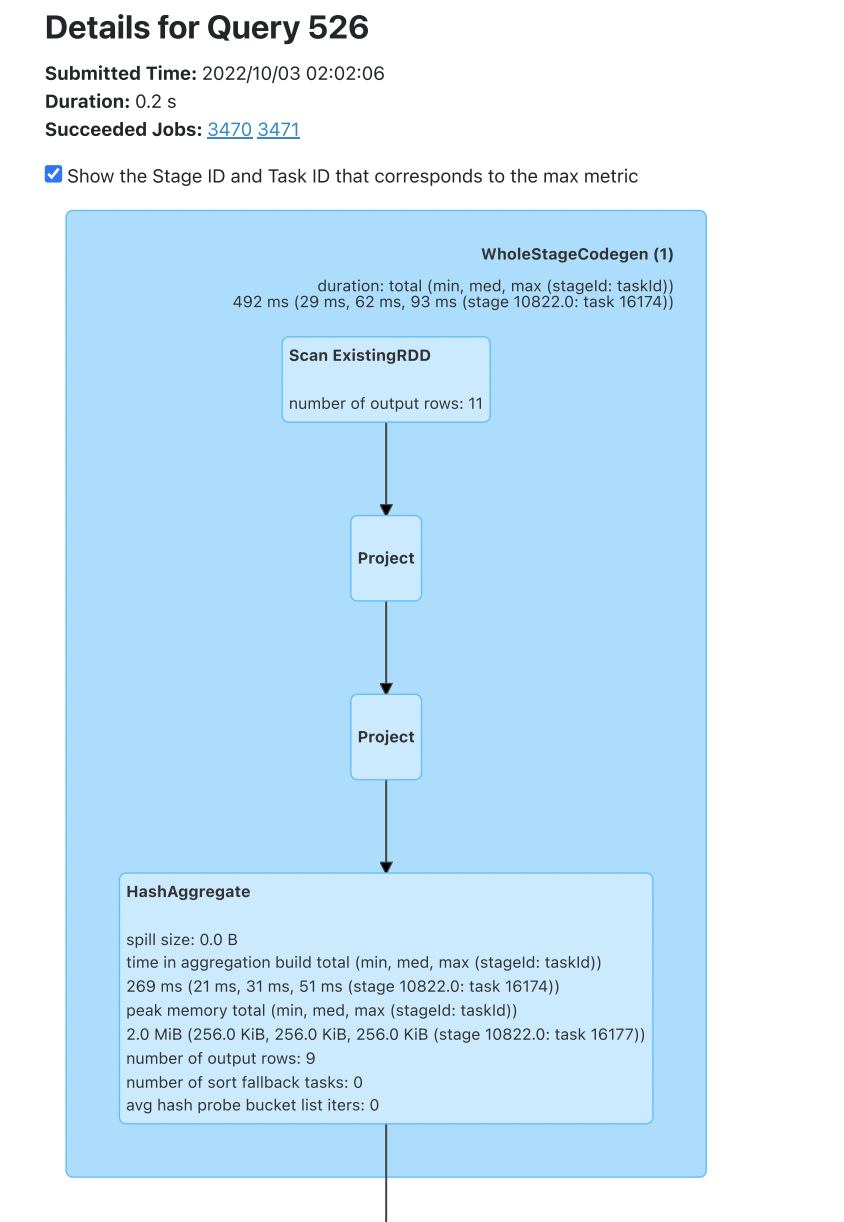

In [113]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAA0wAAATGCAYAAAAVESSHAAAMQGlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSIaEEEJASehMEpASQEkILIL0INkISIJQYA0HFXhYVXLtYwIauiih2QOyIYmFR7H1BREVZFwt25U0K6LqvfG++b+78958z/zlz7sy9dwDQOMWTSHJRTQDyxAXSuNBA5uiUVCbpCaAAOiADZwB4/HwJOyYmEsAy0P69vLsJEHl7zVGu9c/+/1q0BMJ8PgBIDMTpgnx+HsSHAMAr+BJpAQBEOW8xuUAix7ACHSkMEOKFcpypxBVynK7E+xQ2CXEciJsAIKvzeNJMAOhXIM8s5GdCDXovxM5igUgMgAYTYr+8vIkCiNMgtoU2Eojl+qz0H3Qy/6aZPqjJ42UOYuVcFIUcJMqX5PKm/p/p+N8lL1c24MMaVvUsaVicfM4wb7dzJkbIsTrEPeL0qGiItSH+IBIo7CFGqVmysESlPWrEz+fAnAE9iJ0FvKAIiI0gDhHnRkWq+PQMUQgXYrhC0CmiAm4CxPoQLxTmB8erbDZLJ8apfKG1GVIOW8Wf50kVfuW+HspyEtkq/ddZQq5KH6MXZSUkQ0yF2LJQlBQFMR1ip/yc+AiVzciiLE7UgI1UFieP3xLiOKE4NFCpjxVmSEPiVPYlefkD88U2Z4m4USp8oCArIUyZH6yJz1PED+eCXRGK2YkDOsL80ZEDcxEIg4KVc8eeCcWJ8SqdD5KCwDjlWJwqyY1R2ePmwtxQOW8OsVt+YbxqLJ5UABekUh/PkBTEJCjjxIuyeeExynjwZSAScEAQYAIZrOlgIsgGotaeuh54p+wJATwgBZlACBxVzMCIZEWPGF7jQRH4EyIhyB8cF6joFYJCyH8dZJVXR5Ch6C1UjMgBTyDOAxEgF97LFKPEg96SwGPIiP7hnQcrH8abC6u8/9/zA+x3hg2ZSBUjG/DI1BiwJAYTg4hhxBCiHW6I++E+eCS8BsDqirNwr4F5fLcnPCG0ER4RbhDaCXcmiOZKf4pyFGiH+iGqXKT/mAvcGmq644G4L1SHyrgebggccTfoh437Q8/ukOWo4pZnhfmT9t9m8MPTUNlRnCkoZQglgGL780i6Pd19UEWe6x/zo4w1fTDfnMGen/1zfsi+ALYRP1tiC7GDWDN2GruAHcPqABM7idVjLdhxOR5cXY8Vq2vAW5winhyoI/qHv4EnK89kvnO1c7fzF2VfgXCK/B0NOBMlU6WizKwCJht+EYRMrpjvNIzp6uzqCoD8+6J8fb2JVXw3EL2W79y8PwDwPdnf33/0Oxd+EoD9nnD7H/nO2bLgp0MNgPNH+DJpoZLD5RcCfEtowJ1mAEyABbCF83EFHsAHBIBgEA6iQQJIAeNh9FlwnUvBZDAdzAHFoBQsA6vBerAJbAU7wR5wANSBY+A0OAcugSvgBrgHV08XeAF6wTvwGUEQEkJDGIgBYopYIQ6IK8JC/JBgJBKJQ1KQNCQTESMyZDoyDylFViDrkS1IFbIfOYKcRi4gbcgdpAPpRl4jn1AMVUd1UGPUGh2OslA2GoEmoOPQTHQSWoTOR5ega9FKdDdai55GL6E30Hb0BdqHAUwN08PMMEeMhXGwaCwVy8Ck2EysBCvDKrEarAE+52tYO9aDfcSJOANn4o5wBYfhiTgfn4TPxBfj6/GdeC3ehF/DO/Be/BuBRjAiOBC8CVzCaEImYTKhmFBG2E44TDgL91IX4R2RSNQj2hA94V5MIWYTpxEXEzcQ9xJPEduIncQ+EolkQHIg+ZKiSTxSAamYtI60m3SSdJXURfpAViObkl3JIeRUspg8l1xG3kU+Qb5Kfkr+TNGkWFG8KdEUAWUqZSllG6WBcpnSRflM1aLaUH2pCdRs6hzqWmoN9Sz1PvWNmpqauZqXWqyaSG222lq1fWrn1TrUPqprq9urc9THqsvUl6jvUD+lfkf9DY1Gs6YF0FJpBbQltCraGdpD2gc6g+5E59IF9Fn0cnot/Sr9pQZFw0qDrTFeo0ijTOOgxmWNHk2KprUmR5OnOVOzXPOI5i3NPi2GlotWtFae1mKtXVoXtJ5pk7SttYO1Bdrztbdqn9HuZGAMCwaHwWfMY2xjnGV06RB1bHS4Otk6pTp7dFp1enW1dd10k3Sn6JbrHtdt18P0rPW4erl6S/UO6N3U+zTEeAh7iHDIoiE1Q64Oea8/VD9AX6hfor9X/4b+JwOmQbBBjsFygzqDB4a4ob1hrOFkw42GZw17huoM9RnKH1oy9MDQu0aokb1RnNE0o61GLUZ9xibGocYS43XGZ4x7TPRMAkyyTVaZnDDpNmWY+pmKTFeZnjR9ztRlspm5zLXMJmavmZFZmJnMbItZq9lncxvzRPO55nvNH1hQLVgWGRarLBotei1NLUdZTrestrxrRbFiWWVZrbFqtnpvbWOdbL3Aus76mY2+DdemyKba5r4tzdbfdpJtpe11O6Idyy7HboPdFXvU3t0+y77c/rID6uDhIHLY4NA2jDDMa5h4WOWwW47qjmzHQsdqxw4nPadIp7lOdU4vh1sOTx2+fHjz8G/O7s65ztuc77lou4S7zHVpcHntau/Kdy13vT6CNiJkxKwR9SNeuTm4Cd02ut12Z7iPcl/g3uj+1cPTQ+pR49HtaemZ5lnheYulw4phLWad9yJ4BXrN8jrm9dHbw7vA+4D3Xz6OPjk+u3yejbQZKRy5bWSnr7kvz3eLb7sf0y/Nb7Nfu7+ZP8+/0v9RgEWAIGB7wFO2HTubvZv9MtA5UBp4OPA9x5szg3MqCAsKDSoJag3WDk4MXh/8MMQ8JDOkOqQ31D10WuipMEJYRNjysFtcYy6fW8XtDfcMnxHeFKEeER+xPuJRpH2kNLJhFDoqfNTKUfejrKLEUXXRIJobvTL6QYxNzKSYo7HE2JjY8tgncS5x0+Oa4xnxE+J3xb9LCExYmnAv0TZRltiYpJE0Nqkq6X1yUPKK5PbRw0fPGH0pxTBFlFKfSkpNSt2e2jcmeMzqMV1j3ccWj705zmbclHEXxhuOzx1/fILGBN6Eg2mEtOS0XWlfeNG8Sl5fOje9Ir2Xz+Gv4b8QBAhWCbqFvsIVwqcZvhkrMp5l+mauzOzO8s8qy+oRcUTrRa+yw7I3Zb/Pic7ZkdOfm5y7N4+cl5Z3RKwtzhE3TTSZOGVim8RBUixpn+Q9afWkXmmEdHs+kj8uv75AB/7It8hsZb/IOgr9CssLP0xOmnxwitYU8ZSWqfZTF019WhRS9Ns0fBp/WuN0s+lzpnfMYM/YMhOZmT6zcZbFrPmzumaHzt45hzonZ87vc53nrpj7dl7yvIb5xvNnz+/8JfSX6mJ6sbT41gKfBZsW4gtFC1sXjVi0btG3EkHJxVLn0rLSL4v5iy/+6vLr2l/7l2QsaV3qsXTjMuIy8bKby/2X71yhtaJoRefKUStrVzFXlax6u3rC6gtlbmWb1lDXyNa0r41cW7/Oct2ydV/WZ62/UR5YvrfCqGJRxfsNgg1XNwZsrNlkvKl006fNos23t4Ruqa20rizbStxauPXJtqRtzb+xfqvabri9dPvXHeId7TvjdjZVeVZV7TLatbQarZZVd+8eu/vKnqA99TWONVv26u0t3Qf2yfY935+2/+aBiAONB1kHaw5ZHao4zDhcUovUTq3trcuqa69PqW87En6kscGn4fBRp6M7jpkdKz+ue3zpCeqJ+Sf6Txad7DslOdVzOvN0Z+OExntnRp+53hTb1Ho24uz5cyHnzjSzm0+e9z1/7IL3hSMXWRfrLnlcqm1xbzn8u/vvh1s9Wmsve16uv+J1paFtZNuJq/5XT18LunbuOvf6pRtRN9puJt68fWvsrfbbgtvP7uTeeXW38O7ne7PvE+6XPNB8UPbQ6GHlH3Z/7G33aD/eEdTR8ij+0b1OfueLx/mPv3TNf0J7UvbU9GnVM9dnx7pDuq88H/O864Xkxeee4j+1/qx4afvy0F8Bf7X0ju7teiV91f968RuDNzveur1t7Ivpe/gu793n9yUfDD7s/Mj62Pwp+dPTz5O/kL6s/Wr3teFbxLf7/Xn9/RKelKf4FcBgRTMyAHi9AwBaCgAMeD6jjlGe/xQFUZ5ZFQj8J6w8IyqKBwA18P89tgf+3dwCYN82ePyC+hpjAYihAZDgBdARIwbrwFlNca6UFyI8B2wO/pqelw7+TVGeOX+I++cWyFXdwM/tvwAqF3xMpRA8mwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAA0ygAwAEAAAAAQAABMYAAAAAQVNDSUkAAABTY3JlZW5zaG90lVuB8wAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+MTIyMjwvZXhpZjpQaXhlbFlEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlBpeGVsWERpbWVuc2lvbj44NDQ8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KZDiZ5QAAABxpRE9UAAAAAgAAAAAAAAJjAAAAKAAAAmMAAAJjAANS8NuRYkUAAEAASURBVHgB7F0HwBbF0R7E3rDHkkRQY2LFhhUQW1QUe1cEe4m9ooi9JFbs2DXR2AtiFxR7xxZ7S2yJDXsD5fufmd2Znb27F+SLKebfU27aszu7c7v73n57t9ehDQc1HKzs4PVQtEGhOk7VIQoB61IoK7SN2pBK04UsFeAd5HwNAUXxX+Kv7ai0v9L/yvjjR1M3YiortIy/5fen/P7q74bvMfkdRy5pFzItFOX+o9x/aDsq9x//T+8/dMJU+1n1LcJGjcTU8MkETocbpdGoolLDcYrKz1rxn1pkFtsg1OKVYTTASkv8JQIaDqWl/SEs4Seg1p5K/yv9T2ek2dgShFp7yTDawZRGo4pKS/9DYEr/49ZRa09l/CnjTxl/4sBZJ7X+kkF0gFUajSoqLeMvAjNx42+HtnEYmXTaXIkri7wA1SE2XItzxHlSs1UUFVGSiq7B4FXFf4l/aX/aqbV7+54XeN9nUudKuJodJtE1GLyq9L/S/0r/K/2PRxI/LqSRJXA1W0VRESWR6BoMXlXGnzL+lPGnjD88YPhxIYw66VyzVRQVURKKrsHgVbXxBwq2x8NDWeVlz7eAizrg7OzXsWMyzMJa/PWk6sPLni/+Xag1qllQQrRwLvGvzzJK+yv9r/Gvl9Uxxsuez7pa6X9ZBEKc7FzGnzL+VP4gW37/0TvK+JONGkGojrFe9nxM2qDSe9ZgwrmMP2X8+RHHnw48YcJhq0ihwXGDjF6k5Vnzk5aq/pM218TmnAgDefLVOEjAUvyX+FvbkMaC9lLan3Qg6WRykj9fsC7vbcEm2OwPHEEjZwkpThZjZwNb+l8Z//SvuGX8l86CXlHGHxs7OoQxphKZONoEWxhRPB80lkf5/S/jb/n9cZ0iseX396fz+ysTpjDypUFRxke+nnpnlq5tSy4bTDOhnqRmFtdySkXhZMV/PXgtNFlMM6GeoGaW0MupxJ+bXS1A9RhWNVmSTKgia7ekQeFuSor/GLPS/+uNp4Uma3KZUE9QM7OitD8OQhn/tClwsyn9j6Pwg46sT2VCPXnNXPpfGX/K+IuO8t8//nbAK0y8aOkO6b1Rdl07qr2VQUFuYdRcYW5Dg0h79WguTa+uqU1zZ4oStnAR1C2MxX+IAMJT4l/aX+l/OtLF8QKDim8V1lnsTpFxfJTxp4y/WTOQVsGn0JJie9JmZdbIQF/GX9/TNFCl//mohNaisWGJeT7K+FPGn6wZSKvgU2gtsc34pmOIACrjj+9pGqiJH3+wwjQOqd3MTu8pXMA1e6eaKDZLzwIf5idY5ZwBA4zPLdQJMAEuS88CH8V/iIPvclmgohmkhToBJsBl6Uv8Q7RK+4utJrQOOWcNJTWqFuoEmACXpWeBjxL/EIfS/6UxSBvJGkoMD0gLdQJMgMvSs8BHaX8hDqX9SWOQNpI1lBgekBbqBJgAl6VngY/S/kIcSvuTxiBtJGsoMTwgLdQJMAEuS88CHz/R9hceyeMKZLVihTv0JXlgmt6hc8gam7Jtms05eAI6ZWSLfzQwtLAS/9L+0AxsrKn3lJomdavS//zfmMYTqJrJXlIv/a/0v9L/yvhTHyFaasr4q79X5fen/P6kZ1xqHSZ1lJrpv+n3t+GRvFhemaQw33x7Nr76yeRLq92YPKYGaTkBK/5j6BsDON75bYm/Nr5Wzbe0P2lcpf+V8afVBKCMv2X8lZ+e8vvjfk2Mjb8gJmcMG/VoDF/5/Sm/P2gY5ff3J/f7a4/kSf9uGAVyVeroMo/KjTpEgAaDmpUaIFM4wbGKzVVRUqVSBRsNBjUrrZij6KyOVWyuipIqlSrYaDCoWWnFHEVndaxic1WUVKlUwUaDQc1KK+YoOqtjFZuroqRKpQo2GgxqVloxR9FZHavYXBUlVSpVsNFgULPSijmKzupYxeaqKKlSqYKNBoOalVbMUXRWxyo2V0VJlUoVbDQY1Ky0Yo6iszpWsbkqSqpUqmCjwaBmpRVzFJ3VsYrNVVFSpVIFGw0GNSutmKPorI5VbK6KkiqVKthoMKhZacUcRWd1rGJzVZRUqVTBRoNBzUor5ig6q2MVm6uipEqlCjYaDGpWWjFH0Vkdq9hcFSVVKlWw0WBQs9KKOYrO6ljF5qooqVKpgo0Gg5qVVsxRdFbHKjZXRUmVShVsNBjUrLRijqKzOlaxuSpKqlSqYKPBoGalFXMUndWxis1VUVKlUgUbDQY1K62Yo+isjlVsroqSKpUq2GgwqFlpxRxFZ3WsYnNVlFSpVMFGg0HNSivmKDqrYxWbq6KkSqUKNhoMalZaMUfRWR2r2FwVJVUqVbDRYFCz0oo5is7qWMXmqiipUqmCjQaDmpVWzFF0VscqNldFSZVKFWw0GNSstGKOorM6VrG5KkqqVKpgo8GgZqUVcxSd1bGKzVVRUqVSBRsNBjUrrZij6KyOVWyuwhqhbfqgFqWaooEGSGtg3VLVJNk4ZZQ2+FVVgLQG1i1VTZKNU0apOmugAdIaWLdUNUk2ThmlDX5VFSCtgXVLVZNk45RRqs4aaIC0BtYtVU2SjVNGaYNfVQVIa2DdUtUk2ThllKqzBhogrYF1S1WTZOOUUdrgV1UB0hpYt1Q1STZOGaXqrIEGSGtg3VLVJNk4ZZQ2+FVVgLQG1i1VTZKNU0apOmugAdIaWLdUNUk2ThmlDX5VFSCtgXVLVZNk45RRqs4aaIC0BtYtVU2SjVNGaYNfVQVIa2DdUtUk2ThllKqzBhogrYF1S1WTZOOUUdrgV1UB0hpYt1Q1STZOGaXqrIEGSGtg3VLVJNk4ZZQ2+FVVgLQG1i1VTZKNU0apOmugAdIaWLdUNUk2ThmlDX5VFSCtgXVLVZNk45RRqs4aaIC0BtYtVU2SjVNGaYNfVQVIa2DdUtUk2ThllKqzBhogrYF1S1WTZOOUUdrgV1UB0hpYt1Q1STZOGaXqrIEGSGtg3VLVJNk4ZZQ2+FVVgLQG1i1VTZKNU0apOqvQ9A6TGTQFUz54TRm8Pjun5qB1D+ypQSmnrR9mFcYkB1QdUz6K/xJ/tIXS/qwraKfTnhL6iUpKg7Z6NqswJjmY6pjyUfpf6X9oC6X/WVco/S+MDDpS5FKuDbZ0NqswJiVAfDpF+pxoy/hTxh+0kzL+lPEnDgX/yfG3AzbJwzpT08DlxjCwzQjVKq2k4azlY2WVF/4A1/YfMm5O73NrRqhWqU8BH8V/iX9pf9J7sxdO0V1K/wu/P2X8QfMo4z8HIf/xqEgtfmFiuhbW8vtTfn/K7w/6SLn/K7+/bsOHn/D9h6wwZcO9CcZUfjrqoiLx+xA2c4vUkAowRc5kZhOMycENkiKL/xR/ahtHp591Dg0deiPNNONMtPfeu9Pyyy3bED0eztztggnGNKbxSkX+GPEf9/04+urrr+i778bSNNNMS5NNNpl31cj/mP5TMDTXRpeZUpE/Rv2Lf4RW7l01qlmoGwVFlvin/i/3aRotDZDKFZqZTTCmgq6LiizxL/HndqftwFqKNhBT5ExmNsGYHNwgKVL9KjWoAkyRM5nZBGNycIOkSPWr1KAKMEXOZGYTjMnBDZIi1a9SgyrAFDmTmU0wJgc3SIpUv0oNqgBT5ExmNsGYHNwgKVL9KjWoAkyRM5nZBGNycIOkSPWr1KAKMEXOZGYTjMnBDZIi1a9SgyrAFDmTmU0wJgc3SIpUv0oNqgBT5ExmNsGYHNwgKVL9KjWoAkyRM5nZBGMycO2RvADLwZmuVposvwYh5SUcTvbX7ZbolIYhQYq66P+LL7+kU049LRgZhIEalQE2/aWwwyQdaNKOk1KnTp1o0UUWpq5dF6Vpp57mR/HPLn/YkeoiHE4/Rv0n5PtPl11Ohx95FJwF/1NMMQXde88ImgWTJ/b/yiuv0GGHHSmx1by27teX1lz9t4hgKjPbghR1/6Lrf+XV19DV11xHo558yvzztTzyiENoy803N13911hL34qmugiH078j/m+++RaNvO8+evSRR6VOn3zyKX33/fc09RRT0jzzdaFlll6alltmaVphheWpY8eOVvhQ2lRmNmS6f1H8tQCZr6jMdD8R/xz/Sy691Nq/xRGV0Y/48UghX6HTIQOUq7fm6qtRt6WW0pDU4v/tmLE09Kab6MEHHqAnn3qG3nvvfWDaaKYZOtGCCy5ES3dbijbccH2aZeaZkUeIXu5fhivLn5nv0Ta4vdx9972S7z+Q5/f448GMM3WiBX6zIC27zJK08YYb4o8fM4a78iz1+IQf5l9zCOiUhvWZ7idy/bU+WnqrByrz7+j/xb9GILUl4Ur8S/vDOKtDrrYSpaG1pDbD+kxXxp8y/md/DdSW04qmtiQcTv/M+F+ZMKXM0++801njDYXTtqsFadkLUmatahX1zpexxghGpQ8/+ICWXn7FsKIFxzxZokkAYUB2cNcch38daJKOk9BSiy9OO+24I/Xq1SNDBUFzh2SsMQLx0n+y/lyY8fnfdbc96PY7hgOV6j/k7NNptVVWkXo88eSTtMlmW2bxGjTwQOrfr5/Y/531P+TQw+nyK65CSd2ENwb64AH703bbbhPKhPN/e/xHf/wJHX/CSXTtddfTuHGh3Wn740vBTz/JpF4egyLqMvfcdPBBA2jllVbMa2cVNUZi4KXxXX8LWC1Vbskll7uxxtRy+m/2P/yuu2mnnX+HMqf23xR/aVAxCNr+Dj3kYOrXd6uQNGtxRMNHjqRBhxxGH2D84csrf1FHxtXxZ8opp6S99tyddtiO224ew+jOyAsvvkT7H3gQvfjCC6FtsMWSRAZkyqmR51570Pb9+8EvSgtd8A9qeMvWMeM1NuMsiTGC81LxX+Jf2l/sqr5juB4V2PEaHdrhjDWm9D9EwEejjD9l/Pl3jz+VCVOlQaKB8u1G8xGarm/AzbigraJFbkjsVZ6v5v3+B+/Tciv0Sh0IBZUOVEvEt6cd4pQp8AxZaaVedNpJJ9DU006TZe2Tez4DiRCs48eEVOeddyFd+Mc/ohTJ/0UXnke/nu9XtQD7/Dw/sf7PPuc8OvGkU5As+KRJJqF77rqd5ppzLsnq8VFP0mabbimzbbnIcHbIwQOof/+tRWTQP+NfnLhTyCvlKBxOf3n+eVp3g42CM8gy++dGxzzIwQMOoO237e9yUpatHNFaCBWQ0Spa5IbEXuX5LDMRgtVjXnr5Ferbdxv66OPRDt7c/jjdJDhxfTng2+ImeOBBB2b18Xm7DCMbrOPHpFRVtMgNib3K8ykn5YJ1/BjFhmvpr5aka0jsVZ5POSkXrK0wV197HQ046BCAf1j8JfDIjK/HYYPChKma9x8v/TMdedQxAPHEvuIf6ZrGn0023pCOO+aoKjrIyOLRxx6jftvtQGO+HcNFrbV/bh6hhcPIAshaa65Bp5x8PFYmJ435Cmi8JyTLeovIQZml8yrPZyARgnX8mJSqiha5IbFXeT7lpFywjh+jWAlbqb9rLRK3huB5ledTJJUL1vFjFFviX42WyA3B8yrPp0gqF6zjxyi2xL8aLZEbgudVnk+RVC5Yx49RbIl/NVoiNwTPqzyfIqlcsI4fo9gfL/42YWrtOPzV39/spHG3VapWeq6A2pSGSuVSqijj0zQj3D5wFh9++CEts0KP+JfWeCchyZjXP/1GvRDFIDf562wbdeu2NF10/hCaaqqprFTec+Cb/cvNS8tUeW1OOuVUOuvsc5Ed64P/oddfTQvh8R098hSqZdo+/9+OHUuHHnoUDb3xRppxxhnowAP2p/XWWVvy41unJ0aNwgpTX5PZy6CBA2ibfluzU3e0z3+4u3PZGKs1DfTkwafRmXjXSr1wffustSbtuuvOeIdpGppm6qmo0wwzZjc7gMTsjbHcA9NKz1a1KZ1QCi2ZwxtrDP3tb2/SpltshZWHj5DhD2t/aUmUe1cb7bHb72ivPXhVxB8/zL9PkeqYa4OkZVaaa+spfpr+z7vgIvr9H05CdVDPFv2/Gv/wWmobHYYVpq23xgqTHKH+jzzyCG251TYhyTggkWcbrjOPHfPOMy9NAsUrr71GX3/9DVLl1//3xx2Nx+k2sPxigejdv79H662/EX00+mO5/uqfi/uzn/2M+DHad//+Lo0Z+z2qgDx5Nser6PC/6y470r777AGB0dUjv7a5VW1KgzWXfIqf5vVvjgvXS2uqtNTfRyVEw5/L9W+6/wjdLm9DKWqt9D7SOSaXUk7cXot/HhldhIw1xgcMfCt9iX+KTR6jXPLhLO3P9z9MmOQp/hQhi5wxyVbhcoQGNoIyIwT+scf/uoyassqA6XqOt9GTPBKzzAorutuFNrwbMi9ttfkWyJr94b6i7XvidwFGPf443jV4VoqAvRDkZkdvalbutSKdd87ZDcWplCshjMsRret/8imDMSnAhAnvVKn/G2/gCdOCoayuFqnaee7m1DE5orX/EI88/jJh2hw3hXxBov9D8EjeNlv3i2LSO5cZmyMmzr9mNOiwI+jPl18ZxTaEqCM99+womnxy3uyh6WZQU0qtHKJ9/qu5tCf+344ZQ2utvQ69jklTB27nsf1x4XijjfXX7UNLLrkkTT7lFPTm397Geyr30J+vuIy+/OrrLP6cbvBJJ1OfPmuGPFztUq0T92PE/8eofyjRfy7+Tf7/cPxJdO75F4iJf2xXXWVVTHg2D/2PtR0wEEh8NYpMceD6zTvfPDTnHLNDSO1vnfU2pOee50fmkpYnVXvvsRtNP/30nJA+/eILOvaY4+maa6/NwjpPl7npzttulYR+/Nt8q63p0Ucfczm20QrLLU8D8YeLX88/n+g/R54XX/xHOvX0M9FVOcbB/+TYDGXk3cPpZ7PNCg0f/13xt4LGsv3Y43+ocboWpf7l+ocbG2lwWf8T4Ue+/yjtrxLiMv4gAuFPXjrkpZ8PjNql/dV+/0JP1V+0ar+t6KPZkxzx7xn/bIWpdfOvFKR1ic2SVyTlHPT+bEnA5KmS18R5NL9DsBzeYZL703jj0wMv0F980fmVnELOr+BxqQMOGkh/eRYTJ+BD42afJBOmlVfqCS7dICWviWPsN99+Q2PHfkdT4q+/k02Km/qUhM1y5DUhOhErTEPOHoK/EeM9Knhm30NvuJYWXnABTQKap0peA/cdfH79zdc06aQdaeqppm52FHPLc0o5B304Pz7qKdp0M55c6tFGhww8yFaYqv61mt+P+56+wo0+Dw3TYgUIpHb8EP+KGXDwIGz2gBvMWP/ppp2Wnhr1aIwSZ55K0uSIy/P1199iEtyG1SjEhVcPAfTFUjlQf/Y5KoqIX+rn/CafbPIJ+mdH511wMVYzjhefnIuW+NBBA/EuDB57jOXxnt9+513advsd6bXXXo+FCNbZsbJw14g7MGGcFPlNuP4CiTkoUX9V2fuvYrjUfF2/x4s53L4m6cje/zn/PJHs2GES6jgZ10WvsC+FlpBpXiKNYYqmx0Y+T2IAVh9k7SrkzBOb3XbbFeWYeP/v/P0f1HPFVZEr0saKrNV7TTrtFKxgsewOfm9tvQ03pueee8G07PGe4bfRz3/5S/P/6OOjaHOsSKajjRbr2pWu+POfZGfIav3PPHNI2ORGA4mEe++xO+q0S8oicqGGSa1yoP6cMD92/H1Yin9rNnb9NSbpCuSa6vX38bQ0eZKWaoUF6s+WBIyigq7419vfFAkfLeHzkJm5qlY5UH+2JGAUFXTJa+I8Wvg8iZmrapUD9WdLAkZRQZe8Js6jhc+TmLmqVjlQf7YkYBQVdMlr4jxa+DyJmatqlQP1Z0sCRlFBl7wmzqOFz5OYuapWOVB/tiRgFBV0yWviPFr4PImZq2qVA/VnSwJGUUGXvCbOo4XPk5i5qlY5UH+2JGAUFXTJa+I8Wvg8iZmrapUD9WdLAkZRQZe8Jo4tMmHSv3pmJpfeuxDe2cSRyBjSMz1nD0WcWbPU6miP/w8++oCWxYTJ++++/PJ0ycXnOze5/y/w19pNt+hLL+Ila38svthidM1Vf0ZpdZAM2erN0MP4K/D1eIn/Iex4xje6vIowyaQdaKEFFqBll12a+m65Bc01F94NqtSfN174+qtv6K9vvklv4p8/llxicXnkjHX9tu5LvVbsUfP/DCZ3l195JfHk5s2//hW7rI0TFzPhEbUFF/oN9V5zTVp/vT40Bd/Yh2eE7AbuuuuH0jDs5CXxx8oWryT9/tij8ajPbFKMJ/AOk2z6ACnEvwP+sn0AbVvb9IHotdf/Spdf/md6+JHH6FXc4I8d8x1Wy9poummnww5e89Pqq61Gm266MU015VTmX5xwaRuuP99UbrfDzgJ5GRPZv//jPRSfb2XHya6GK6ywHC8Pim6bbbam7t27ZzcaH3/0Cf35ysvpgQceoqefeYa+/eZbqT+XZ8klF6eePXvSJhutj8elpmz0Pwi7A7799tuhiDjPOeecdMxRh9M92KXs1FPPII47L7yec/YZtOqqq0jMsxttd53HjPmWevZalT748CP4QmZyZ9OBtt+uHx104P6N/tXxG7im62+wCX32+RdWf56kHHfsUbQJdkTT9jf49LPomaeeRPahFFNMNgWdM+T0mA3HmP2G/nfLbbdhAno9FLyCggPxP/zwQ2hu3Kw3HXfcOZxuuvlWvEvzOPF7geyfV/cWXXgRxH152mrLzWkG7MzWVH/eqIAfjVX/83Tpgg0RDqI7h99Fp59xhqzI8J8IuE/OMsssmFSekBVhDqziHHs0dmpE+UPx8/632x57YRXuS6k3/6Fh6qmnpdNOO0WeSkOB4pHXX/U77bIbDR8xIsQf7f/Iwwdht8XNNFFGW/nXvG686VbaZ599pBwSasT0hhuuokUWWgj51P2fgUdMTxk8OPjg9g//l//pYlp66W7md5/9DsTjssNE1v43bOg1tCDGlKDEOdaRfX6Lrfbvve8huaqywQP63xyzz47dP1EGKVS4/prGMmnof8GWzhOqv2QfnIRzUMQMIBT/2oDtmpX4cwS4baBdxnYcG0yNlPanzScf/zRuobu5c2BjHDnGYCu//8HIthJ/jWOt4WkEEaam3x9NJ+ENQQ7noNDUJf4Sj/8fvz9uhanSnLJGwTaviFMLr7LkbtphdmNiNk62dBWmBvGKNtzcfUjL8woTP9MfD5kwXXQeShr+Np6KnNK+9NIrtFafdQSj6Zg+/MA9NOus+ngLFEjy9Tff0ICDB9Iw3FDyDaPlG3l5aR/+J598cjpw/32pPyY+nFBxXRfrRl/ghs9ixz8cuI/l1QvG6HH0kYfT5pttoqKscBx99LF4bOsq6BiLNEJjvSLP/uf51Tw05KwzaJ7OnWP6kPcpWNXid4OCm5DD8Dtuwa5swMH/E5iE6YRJEqI4g3jTB32HKSShc8+7gE44eTCN+/47eK371/jzpOPsM06jhRdaIOFiHlZ/dgTd99+PpfkX7Cpu7QT/fCPISaTQ8uziJHjE6QjadGNsCiGWDnT9DUPpiCOPps+++DJsmuCuP0M4TrySNydWak484Q8yodW0kjUwvdfuQy+98pqIfJpv3nmxffmh1HfrbWSFRf2fOvhkWhvvU4WDS6bXLF5jqB567FHaqm9/g7D/mWaZle4fOTysUEkSl1bYJJ959jl0Mq4VZ63177XiinTBuXhMNLrbfqdd8Rjf3cg5xJ8nNM//5WnBKyYUgGjIOefS8ScNlkkF34iwPTz+yTf3OKL/Dz8aTXvtvR899PAjQe/8S6IY/+mnn46OOfoI6r3Gb4GLBUImXJYVseryzj/eDelx7rrIIrTn7rvSNjvskvk/75yzqGePHrRs9x7Ek13f/h97+H6aaaaZLA9lXkY/XbPPehDZF3tuo969e9Ppg7GqIzrEIoVRk5lts822pMefeDIWuY3OwgRu9d9ih8hY/1QXl9SzLu9nnv0L3Xb77Uia2v+uu+wsnyiwkFjaNjr73AvopBNPlolgsLfRtVdfhRWkRcz/kksvT7zVvB6LLbYoXXvVFSpGXBJzRWp/Tf6tnFYHY8z/xNQ/lMLl8QPiLy3FkhhT/EsoXDz8JfZ8DeIV5fpLG/chsdjF2LBsdmNK+5NQuHhY3CpMDeIVpf2V9jf+39//1fHfTZhCh8i7hd1vVH5fHUrYlJa7nd5WuRHLxi6XsrGHervxxmiSNrzD9CF2yVsx3pSEW4Tl8UjeJXgkb0L++/Xfjh548GEUFBnzX2BQunOx5fYq2HJbXX2HCcKO+Cv1vSPvgw+Z5UjFwk0tUPiThPCSIPg/OG6aoP4XW3wp+vzLr6Q8eE874C0+quhARx95GCZMG4uFs9tjj73pFrlB44Uc3CpOwP/MM89INw+7gWaJEz72zxtNnI3HAEPJME+DcsTtt1Dnzp2lPDJh4ve9Yv35hnQgVgf6b512yTv/4kuwKnX8BP1zxfhWcqpppqZhQ6+jzraaodFMLYE133/3Hf2aJ0wu/ux/HGLKF4DnQFwsxv7+aKy2bBRWW67EuyEDDxoEPSwN8cdVkgNJ5ZhyisnpggvOo2Xxl33Oi/VMe6+1Dr3ME6bof75558FjaFPQ0889n/kffMqJ1Ac36ZZYcuWT5kZ0zrnn0/EnniT1V/87br8tDThgvwynKZRqVjxxWXb5HshynNV/ZmzS8dgjD5qXHXbche4aeY9UgIvMH/N94bmnQxaSYciVz7w74kmyOyLDww8br1wssMCCVn9ead18y370wot4bMxd/6b4c/vjy3Lm6afSb3/Lj6XxEfzxyto7WHHV67/IoosQv3PzxutvCEr9n3/uWdjGvxcNOhTvq11xpZRDKzP4pJOoz9o8KU114Ot0/kUX07G/Pz5r/2diQr6GlCFgxYmwKS3rOP2qq/emv77xBnLllklYIb2Uui25BD3/wouY/NyBVeaXsZnCtzRDpxllVXIVPJI7J3aQdDkn3ivZQbJENve/LXa9u/e+B+A3xJ/fN3r4kfupE1ZAGfkeVlRX6LmyxE3jzxPNPXbfTezvvvUO3Xz7bfTCSygjNpHgldJFFl2UevRYIf5hxBVI2Nw/1zccCaecUkUkmvLQ9IY1RtFOIWyQ+cyHpvdx0hRKA9KfUx6a3rDGKN4phA0yn/nQ9MV/ipNySkOk/DlYvN14YxTvFMIGmc98lPiHOJT2l9qJcko1QokGi7cbb4yinULYIPOZj9L+QhxK+0vtRDmlGqFEg8XbjTcGbQsvEusfon18Qz66Vg7J0hiTXAlX1TfKqow0J85JzHs8/vkdpmUxYbIDN3Y98AjRxVhhkkNdKUDkoDztjDPp1NPOFH94xUI+Xvk7/MV4X3zjRHvbCbjpHDIEGzXw3SIOTjnbrLPIxyNnnnkmPJr3Dl199bXEH9CVI95YXnXlpbQEvvXECTbfqh/eC/mS3nv/ffrgfTyy5V40n2/e+eQ9KPa/8847hxtBpHngoYdoa0zoQp5QwD+/17PW2r1pZvwl/h/YWeuO4cPp888/D5h43mqLLegIPHqlx0knY2c+Lr+UnEkHGn7nTdSlcxfRyYQJ24pr/fm28pCDsekDthXng98/6bb0cmFjAklB1Akvt++60460KP5SPgb2O+4cgQ0b4l/FY/3XWmt1OvWUk4PbNHJFmaPYAStM39EGG+HxKIjvYoXio9FYdeDAy/UmeSxpkvgY4e67/w4v7K9MT+Ov/BtutKk8KsdQPX75i1/QUkstgUlYG91///1xS2/Ni2M3Dep9K80y08xwHfyvuVafMGHi8CL+k00+RdzWmRUkH5LlD4meevIJtPbaa4mrkBKsMaEE9r2rWH++RT7n7DNp1ZVXkry0nCGdJo40kpVXW1N22dP6c5q78M7L3KgbX/8dsMI04u6RodpIMzkmgi/85SnLWpiYV9hOHo+DWd9pwwrTNXh8dEHkFUC774kJ+a23S130+vPK43rYnGLa6aahV199ja677ga5xtr+J8Mq6ojbbw7b0sf498CE6d134woT6j8lNrXgd/yk4vA/KSYK3303NrwjiM1VHnvicdpsC25fsbAgG228gTwqKllGNddnm+12pHvvvU/qz/JUeD/tiUceoClwrfz1Z5scLi3LS3Zbjj759DNwbCC6+cahdNElF2NDBn5cMYJBtP78PuJWW2xGBxywL3xMLmlSDC2FYwLEzjHLRx99FP1+G+A4c64VVsawDfjpWK3U+I+85x48krqL5KX+eUVxuWWWoUOPOEpWUeUbXpZHcrs23p069NBDMBbMaK6Fif5N2SirMtKcJCeaSYN/DZ1CjGrWqmiUVZk7Vm0t7+I/tiF3aSxYGuhIq/pGWZWR5sQ50TwBkDbsTJpFxX392gEQxwmBSjpNHGlOnJPiP8QMASrxT82HOW1ConWnqr5RVmWkOannXcaf0v4q/S+tMLnG4ZqhtU9tat6mfLIlTm1KxVIzO8VE+pdNH1bohfKF//iGuzvefbnkogvUZUa9/xEj7pLVI99D1sGN8Sm4Qebjw48+ou4rroJ3dcaE+mPgX2zRrnTRhefQ9NPxjljheBeTpk1xA/gOtv4Nf8duo+WWW4YuxY2ZP04aHB6Piwsa8jsiN7Gy6UP8VYn1P/DAg+ma62+wuM/187noauyoNttss9nvz5tvvY3Hytalb/DXZ63/HD+bnR647y64DfnxY178uJccUHH2vMLUpUtnUYV3mLDCpLkCcAhWmHRb8QfxqBY/oiZx4/TjiE4djBWXtbDi4o4/4COt55zHq3rst022WX7qicdkcwoHC/m4yx1sbXjk8dCw6UOsP+fy9JOP2ftdmqRvv+3owYcfkntOXjVgX5tvugkdduhAuTFnzWeffUq7YTLwwAMPR0Tw0r9/X0wGD9L7VVlheumVVyUPrf/kk05Kv/vdLnjPZXOacaYZZHvosbjZn2666Swv9lE91sRq1UuvvAJMKBPbR464k37xi59nUKmHVsYsQSGTrtvvlMFJc7ng/HOoV09+r41ox50xYRoxUm7uZYUJk4YX/oLHzeKRsuXHwc6nE088xZUGj+TJuzFYYQLw+RdeoD7Y8S0cIeXqWLU5Bd8k422s9eAd4TbD+35ffoUVUhSKr/9mm21Exx51pELw7tZq9M6776CMuo7ThknTlHgsb3dcm41oOkywv8QfFNgLbxHPf5noufJqaZIFyxyzz0H334t2G68/Z86T9cWXWhbvpnH7lrDQ2r3XwkQ89E/G+CPUgjWBGwc/v15gYbhjGQfK3wPvwd137/2yoMMxDkdKqf5XBO7sIWfYpEkRSjWlp2rj9+I23GRzvNf1kcWfV5eGIv6/mu9X1v4u+dNl4XtOsbyc1+WXXkK8xf7jjz8hWs1TaIw/T674Gs6LvC7704U0y8z4IwAOxXpODO4kmASMFqdw8XfJLG+H9Gbhky1xVZBYamanKP5DQ68ETiOktGIu8UcEUmwSV42TWGpmpyjtr7S/eHPs2462EKXepnyyJU5tSsVSMztFaX8/ifaXJkx6ZZm66yjqqmzYuqGuMXBiAGrDL3+4yUxq46qZVGUA+ZG8ZVfAo0xo5HwTwZAeK6xAF2GFKd0QWY4Z8+ij+Et337543CfsWcfGNfCOxpmnhRe1L7nkUjry2GNDpmxE5jcNvZYWyHa1C4Zr8Jf4AQMGxpDx11La6PGHH8B7GekvwOE7THHyEvMbeuPVtPACC7GUHVfjL+DvvP2OPZe2xOJdqSdu4qqV2nW3vej2O7BK4Or/8vPPYjOKjgIVn0PgkwMTD3mHqXNn0T3+5CjcAPeFOQIQNP5wrUyYoLrzrhG08y67h5SQeSw566zT6Ler6mNZbGqjv7/3Ht126x0BhzPuq+Uv9fZXerM4Bvnp9bdd8viiSVE60DOjHqVpsDKkB6+qdV9xJbnZFQe44F06d6E7bhuG7/F2VJjQD0ePphWx8vENbrYlEMhzhhk60ROPPmS4NXtjkvPaK9n1P+QQ1B2PI8rB5eDy6FGVVY8C8+rQm9hOPEDC9X/qiUcwsZ7OUDUGYK0/2w4aOIiu4p0CORN2jMHz7LNTrHfYEe8wjRxp9U8rTPWCneUeydP6h8k5VphwHHXMcXTxxX/Cu3/Ywh3tfzK8D3XfPSPs5ltAMduTB5+O9+DwLhVkvv7TTj8dPfkYJqMs4OjRaxV8J+jv1v+4Px99zBG0mbxzJpDaiSfY5+IdH/XP7e+OW2+iefFYpB4P4nHZvttsG+MBLfyfg0dmeQOO/KjXnzUf47tG3ZZdwa6/T9OpUyf69a9+Rd/jv1dffp0+xSRbDq4SJ0YdeCJ+9FGHiVpOdTfRlgz/wGN2/AeG17CRR4iOZIXNRI6kzTbhd/DSwR+yPu7EE7L216dPbxo27BaAkBrXfyY8ZtuxY0cajbp8/x2+w8Rqzpg7GNr/UksuhR31LoEesyh3pBI5ZZUFyLe/qlniYJWAtWWmdUNdU8td8iv+/7nfvxDVerTrmhL/WgQQpNL+Svv7Z+4/S//jCNRHm7qm1vt+0uN/PmGSgUR+smN7gCLeHDVUO4tXCFQlXCoK5RMnCRMcuS+A7H+XOf58U2C6FrNuzudDPJK3DO+SJ+DwtkCP6gqT+BWnwCX/j2K3ty369gu+2AeOtdbsTafhhXL2v/c++2OHuZuRBLdzuCGZ/1fz0q033yi47ISkX2H3qq5LLIPNAvjjkmEQOgfvbKzSq5fFJzweN0TK2gYHvMvejUOvpgXxHSarK2eM/H5o/Q8cgJWoa2/I6s+rDvLIErLirczPxqYPcqPFVUT9h9+Jd5jm7iKheOLJJ2njzfFIXqw/72Y2EI/k9ccjeVymp595ljbccBOpf6gIyU317njXYpWVV5Iduri8WoHAOgVMZo/+gyq//gcdfIisMMmG6xJvomd1hYnLhgrcctvttDve65KDCwf1gfvvQztuv32j/733OwA7kN0k9dT633nHzTRPl85I2gGbB6xLL7/6Sog1fPDHR5945CFZYfmh8ZeyoBwrr7YG/e3Nt5Av5xyu/6gnHg4rkVLvUF4pjLB5/bk6PGm85prrcJ/M7S1UachZp9Nqq6ws9edH8u66eySQOGDn7c7lkTzNH+rAtmHTh/OxSccpYcEESq7/0OvxSB424+Bjg403p6fxTTIuD/tabeWV5BFCMQKv/ll+5eWXaY211wfHuYfj9luHySYZLPXApg/8YVUuFNd/xhmmp0cfvJ86YrVOjlCoWLiQx/N4d6hPH3zENfrn9ncoPhTLO0WyG/Z/AjZM4HfDtP9Ni3fjHpXH8eKjciH3mK93FRy+9vrrtNoaa0vI9fpPM+1UdPhhg2idPn1oUp5kw8/XeHzwoov+SINPPQ2bmqAGMf78EdrbbxmGD9J2AQ7AVkes39t452jL/tvQ22+9hWwRCyRBVvL46n777hXLyWBmO8iEkd97k1gzEIe2/9+uvirtv8/eNA/7hu1DTJjOxh8+LvnjpVI+ACU/JmeefhqtDjwfoSjhLIqkjMbkX4ZCLiMwnI8dUPjrL5X4AfXn9CGvSo4qCuUT4+rtXwzBWPzjgtg14bZR4m/No8Zo+4IhsE4R25P2FxkMBFfaX+n/aAhl/Cvjf2gGPFKEA8PHhH7/cE+CUbkyznDqXOUkx0Y37Seal1KXU65yUmRr7zAhrX6HyWXTyN58y6205177yv1AGFA74P2Yden447CqhGO1NdbCVtpv2A8X/zVqmqmmCcGUv/ACxL9qXBYcX+GxJT5Utf9++9DOO+JmPh7hO0znAM6IkMEwvFeyoLxXApWrnqbh7+E8hq2eH3zoYazi/INGfziaPsFfw7/49AvsEPcZdgn8wPxrGr6J5h37+AirWukdJvZ85x23UpfOc4t91ChMmPAOUyg0rFhxsBUmILhI62+wMT37l+dQb5QcLUkaU6z/bPhgZle8iL7YYl1p6W5LgV9E/iIumf/QE5wMwOrK1VdfJ/41ns9gwjQ1HuHiMvNx/Mm4gR6C72tBoa+BXX3ln/Gu2GIBUDnzh3D5g7jpihA+CHsCbtTXEiQ/RvfKK6/a9e/8y840Yjj/dT8dXH/1n12g3IAdF9ejF/FyPh+MZ/OdePSRJ2cTPGJeO+60G40YeVd2PS+68DysLGKVBMf2O+9Cd991j9U/rTDVPYR3mE6JhlAiXWHi+68FF+6KzQ7GhrJG/1OjbfP11/hzYjZ9Hdu1v/5nDD4F7+SsLvln7zBBw9vs34iV2Akd1fivtGIvOv+8sywZfyT2L3gkUOO/LrbOP/n4PwR7LLOBGxh+3HTzLbeGRaYveJRxEvojNoPx23pLspjXGWfgG0eYfPj677PPXvS7nXeMuTunjmUjf0eL3zn8B1Za9fqzvu9WW9Dhh6Z3Clmnx8WX/AkrccdZ+5MLi/jz+0mn8redcORu2vDh2rPoVLx7qe2fnfVZay0aHB8j1rwniqoTpS5xrnKSYx28fazmpdTlkquc5FgHbx+reSl1ueQqJznWwdvHal5KXS65ykmOdfD2sZqXUpdLrnKSYx28fazmpdTlkquc5FgHbx+reSl1ueQqJznWwdvHal5KXS65ykmOdfD2sZqXUpdLrnKSYx28fazmpdTlkquc5FgHbx+reSl1ueQqJznWwdvHal5KXS65ykmOdfD2sZqXUpdLrnKSYx28fazmpdTlkquc5FgHbx+reSl1ueSqJIUJkwMGNgHM1KASm+id0Vhj7Mc/aao3BOYlMh7ZrPoA34xZdoVeyAg3RbiL4MlId94l78Lz451uykM5pSdim+yzzjlX/+gk5TsYu5ptj93N+OBH/T784CPRiwIn/qtMm/y1L0x7bJbp/DOWb0r5A5n77Pk7TsUqOhEbMPBfidU/6/i9hoV5wtRw3Hr77XTccSfg/ZB3zfpD/D+PCVP4JhNhq+rBeIeJJ0wp1ndiW/F5OncW3eNYYdqUJ0w4tFyHxF3+VPPKq69S/212CDeDE6j/nHPNRbuj3htvwKsHPlfNLVFv5dUVfhwtRCokffpJPJI3zbQMk+MwvAh/2aWXZ/G/5eahWPn7VcxUawA4WN4Gfu/43RzOgK3HHHk4HkHcRPzIe0eoG8eUj3mxrfgdWDlJh8tPlQ0qNu2x537YQOFm+Ag14Ot/xumDsQ33arBGXeR8Fp7vjkcI/x6vNafgtnXfPXfRnHPMAYlk04e77xpp9efHHflayyEZpdzOHnKerDCFh02D/6GYnC+M1cxvvv2WFlpk8ZAMJq1/Sh1KzP7DVCO44LO2vxP+cCxtsP66YpAJ0zt4JC/2P540X3f1lbHaKVfllPJmJCeifap/3tDhqcceknfR+HG6pZZdPvN/LrYllxXbUJ1UKOYkU81ZZTMwEyCOeh3z/Pgm77j5GTZS0fiviG3QL7wg9B/GWCYihNNzzz+PFdkd6eNPeKwIhePrv9NO29OB+/GKaNRFTkt5+x3DaZfd97D6q/7B+0bG76SpJjkb8823xO3ko9H6flR8/wvtJGQUg2NJjbGiJ01jdZIzSzF+lVglU5ezscZYbklT/PtYuChHtsHaoCrxRwQkLi44xhpT2h/CFMY1HZFK/0utI3a5jDRYG1SSRPTOaKwxpf39D7U/TJjwarTc9IcWky5zakGqU8oW5ZUmdJXzCM8rDrdn7fDPKyyyrTiy4Zs7XrnpjneYeFvx/PA+A7/xplvQKEwYdBhh/1dcdon8BZoRy63QU96RCrcg/F4K75yGFRYY421JVn/+yCn+iB3zI/rdrjvTXnvsxgocbVjtOY3O4g0Ywl2naPWv/mz39T/3govoD/EDn96/fLumhX+tP3+bR98dCqta5yJ3Ln3IacSdN8sjeVyAJ0aNwneYtgIX/POmdAMxYeLvMGkdGfcZdho7HduTX3XV1dgy+kuzhUhqO+AUwQ9/T+poTE7SoUjWeD4gBuCRvKuwwiSb4jECk9Jn+R0m3iQgHocfdQz96dLLsvgPu/F6WvA3v27Ikej6oTfSvvsPwEOGuGaxXMcchXdrsBEBx4InTC9jo4YQlzY8ejWfvA/F7uolTDpvU/78iy7B5PZ4pExx3rrvlnTYoIGcHY42Gjv2OzzieQs2IfieKyja36DsCy+0oGya0GPF1bL6zzbLzPgu2L2C49P2O/0O7zDdbfXnVUSeMHFOWg4F6woT67X+N95wLS2ECdOYMd/QAgsvEaGaErf6HTpm/vlROD7asMopMULj1vZ3/HHHyISJEbKtOCZ62v54xfG6azBhyg71w8rAv4139FZcmR8lCzXg9n/lZZdgV8ZudCNPdvfeV3Jg63TYZOXhh+5Du54sq6vmqlQSNJ48wvMKDu1/vfXDqha3P67/QnhfkePGh6ZSyrrHnhhFO+Djy59hG3WtP9fnADwqutMOaXU5pU45vYQVyd59eNKZ6s/t/9WXnzdfjNZD/W6Jd6QefvgRUbOON5Tg7eU5l9aHpmaE5zVFPv40I7SkgfqcmvCac6Ae4XlFFf9+/G+OUIl/6Cml/Wlf13aiVHtTnXqE5xVZ+l/pf/gFiw2ruYWU8cfGH3kkT/pODJUQHzavZ6C3aaf74dRSg+F7Rx0ALF8BGCr5M1VgPvwwvsMEhFQG6u7dw3eYxleaUU89TRtjJyuuBvvnG5VJ8J7Sk3jvRFY1oF97vfXphRdeioVrCxOxC+orV+Pz4228S95ZZ4XH40LpsXMZ3itZEDfMvv78TZuVVlkD70N9F2oF44wzdsLKzW606EILYyvhmanTDNPK+zEDBh4S3mEKSLmZfv45rDD5R/J00wd2gsoOx3s8nTt3Fp9P4KOe/A4T119igdMhA7FLHm98IH/6ZwMfocTj8OL5M/hO0ZNPjaJnnv4L3nF6Rt7dYYRkoRWDdP21V9KiiyzMptphMDAc/4MHYpe8q6+Bl2gBeeYpv8LURmecNYQGn3I68OyJP0vbgf54yQW0/HLL1fJnxQUX4Rs+PImRgkEBOuTMM2i1VVcWL2thwvTSy3gkD3qu/3zzzIuNK24MQClGLAtn5sol+aksNkw8EcdNEUeZY7A/gKafflq6D4/YTTttmvQdixXDCy66yFLPNAO+nXXzDXg35U90Dt478vVfbbWV5WPEwUUb7bAzJkwjRlr9eRXxef0OUyyHkjPOxONlp54q5dD68y55sq04tIsu3k12ruOCcP15K+0jDz8Ulljniai/PpLH1eb6d8V28/UJE4zuiF7QB7egJ556ytrfrrvuRPvstScdOADt+jqeqCBX/L/hBvyo7HFWPMe4XHP2008/lV0Otf6TTTEZzTzjTAJS/1p/Ljsffqt5bv9p8hdTuIT3P/AQ7bzrbsEH0nIevPnCscceic8OYIV1PAdnw7tvLr7ksvIOlfa/WWebhR66H5Nk8WPOgI48yBZ9+9Mjjz4CfyE2U0wxJT33zKjxeKubLGcwfP21/t5PU//XYhiunvUP0hT/MeYl/qX9lf5Xxh8bNePIKMRGSVi9nsHeZol/MGOpwZTxf+J//1o8ktdwWSoB5hukfFZqlyIlFhXfCoa/waar6rBJmXE1BBT+Ar//Pj5c272npGHsJLjJWWH5uMKkiYUm/x98+CFthMnS2++8jXsCXn3gA5sA4J2M00/Fd1LiMfCQw+hyrKjozcQcs89O948cgZ29Uj0mpv4nYoXpbN3im32grMOuv1Y2fVCfTP946Z/pyCOPZgCmBeEhnz9efAHqhYkBCuvrv+fe+9NNN98sybkeXP/nno0rTFCchBfZz8LNM/vS+NsuedCMGvUUbbwZP5LHtQyRSI/kBY3WX514/1z/t/CS+yGHHk73P/iQ+Oe/1PCx/754hwuPJUm2zr8Y5cT+AjZsK36NmVj7zJOPy0dw1f89991P2227I42T+CMt/t9u223p4AH8cVgta8qTHyO878EHMbeCLvp/+P57sDX7rIJfc+0+2NDgtVjrDtjEYB7izQz8kXKLWiiq9ef2z99rWgkbP7yLNqX154w33Gh9Ov7YY8w/3yRviA0XeFtvLhO3v07Yve/LL7/GCtQYc811Pg3f7Fmz9xrW/vgDyncNvyur/8PYXGHWWfwkIJR4r332C7ut8Z14rP9QrJTwI3l89O23bdyePbT/bt26yeqqGN3ph9S/50rhO0yM5fa36CJxhUkTC03tL2XfRpdedgXxo5ahHWCC0hVpr76CeuCDrn/HjnPa/i84bwj1WhH9HHk1xZ/zDO7UKXYd5Mc8r8V7cbH+03fCh4CxSjWpbkYRU2h5+H1IXi3Td7u4TPze1EnH/14h5v+OO4fTXnj/8dsx38mqGwP4O15nnnYiNkNZJeC1KEKb67/r7/ag2/EdM60/J7ztlhux/fh8kodmIQJOn3/2OXVHvL/44vNQFgRjkYUXkA09AtalUFZos//gV3OvU83CLFD80PhbeIt/hLnEX39/rC1ZA0maKlfaX6WHlv5Xxh/8pPP9AR8Tc/9Z+l+6b4/RA9FIBk313HL80RWm2rDur0g1N8g1fIZRd0qjUUWlbuCs5TcB/+/jHablu/cKf9mP2cs7TPJInjpQSvTII4/SIYMOp9f/9ldepIjxQlPCX4aHDb2OfvOb+RHCEMTrbhhK++ORLt4+mW8SuJhDzjyNVltt1egp1f8z/DV7T+yqxzfOeuyP9xcWWZhXWIJ//r7KWVglYRE7OYv/q6/iTQu6Qgg+uf4nnDQYqw3nBRVu9tj/Qw/egxvjcKOv+fMmEyuttjp9hO+9cJj0kHeYZIWJHwM8HY8BYkvomD97GY7NCDp36Szl4F3yNtlsC7Oz/0G8woRH8vg4/Yyz6Fl8LFZWdeCkU6fp6UR3A6nX6+WXX6E18U0of+y+2y54JHF3qEL9zaaiUtj1O0yaH2OfeQrfYZpqahQ9xOazzz7DNtHd8RFUXnkLx/Qoz30jh9O07l0ntvB7V/zIXZi8hAv985/PRffcdacVh7cVfxk4VcyHd5h4hUmvv3iYQPvz5b0MH+899LAjJVk4cQUnoV123p723nMP2wzj9Vdfpz4bbkTffPVNvCwWCEQiDGtdunSWyVtHtEut/34HDMDHTHkFLB2DBh1M/ftulRTg3sRufXwtvvnma0ixoaFW9vgn3J1y+hl4xwobLEhog/+buP0v8Ota/V9//Q06/GhM+hgWjxOPP06+CcblXXElfIcJq6J6yDtM8kie1ktpRKgIOvrjj+Vdwe+/52uE4mCCd+Xll9EmeFxWyob2P8MMM8jjeJPZRCfmA6LxSprEXXXNNZg0HQaFdXT63S5hBUvy1nJIxTrQ/gceRNfi22d2/RGbE37P72qtlzIFdz3GhQMGDCT+qCz75930uJnwN5TyDSXUgdKYjYqg8vHaHXeGIbRxzm/5ZZeVlVNe8ZaMY/vn1AMHHUZXXHl1zCjUn+u0797Yha92OEcxf4HU1KpoiOdEtP+a+xhXzlXrV/wjAhoOpaYo8a/159L+0HXC2FDvXw3tJQNpA1MajSoqLe0PgUnjr43/HK7S/kr7a+h/HfgVJv+bKm3FmhG3m3DjXtWz7A/rg6qsKCqioETXYPCqVv7lw7XdV5R2zZlxmrl/8XNaGztH6b0ivzPy3nvv02OPj6K38FHJ8Df1NAhxmh2325YGHBhWKjgfPr76+mv5ls/oTz7GexzhxmjmWWehU7Fb27LLLBVAOPNjgbvvuS89it3sOC++RZ0W39/hD3FOOzUex4quePOFk/gldzdAbYPtuwfiu0f4A6ThLrz4j3TMsdg9C0hJitN22/Sngw/cXxovQ0ePHk0HHjiQ7r7nHhlPuV/zweRFvNdiu+TxRhPnYKMJsbPnNhqBTR+6dO7McLzDhEfysMKk/tnjwIEHyoSJk5x2+pl0Gnbl0vrzxPEPKNtGG+aToz//GTvSHX6E+Of6c9rTTzuZeq++htULKtEji+xg7EEHYZe8a3nTh1BGRj6NFaZp4ztMev3DTS1PakJz5bRdF12YTjrxeKkTy0/jccvd99yH3v3H3+VeWe87Bxx4AG2/XX+kDUd4hwmP5EHk+s8337yRo3fhAABAAElEQVTZCpPoI1b9s+j10SyEJ8vrbrAJvYjVI8aII9yrs3/emKIPtrJecsnFaUp8GPbEk06hB7Aix4fkFzOVK44CXnDe2dSzZ08rK/u/iNvF7/+AaxmixPWYAh+IPfCAfWnN3/5WvqX0IP4g8IffH4/VU0xgGBD98/Xnd3EWxDs5rOaNRFbBt6PGYqc89T/PvF2wQnIqzT9/Wt3461//isfOdpfdBGVigMSd58ZugmhDevAKk06YOK/FeNMHfYcp1kuxFVHU22y/E917z31SXn/9tf1vvPGGdNzRR6Kdc8lbx79q+wyrMMsu2xMrRt9m7X+zTTakHfF+Uee555b8+IPDg7H6e8fwEYhNan+dMFEbOeIO+ZaWXv8/XXY5VsSOFhSXRuoDZqmllqKNNlg/yFoQ7ggu/lxBjvES2FHSH5tuuTU9jm/CwYz/g/8ll1gM/fsAWjLuAMnv2p3CZRyBFW53/SfF+0u3Y5I/9y9DXWrxrSgqohRDdA0Gr9L6cwKv9/VotFXAFVGSi67B4FXF/3/n72+5/nkEfJtNjTthanaYRNdg8KrS/kv7n9jfv9L+tHP9C/ofOiT3z3j4rsoqL3u+BVzUAWdnvtPmOwx/sMuG2VvujxN4n57nD9dil7zle6W8JUt+lC284xLQOPNNBm5gWBYenMwR8RftDdfHY1PHHe3KElIx9Eq8V3MwtrwWB1x+CVMH6rrIIjT77LNhA4Qv6PHHRtGY78YyXBxwwx6Ax8S233abWPLg/74H7qf+2+1Y898ZNzszzzwTbQv8Gr9dFasjr9Aavde1myfJFBLfbPHudl9//Q09jsnfmDG4EYw+LbZQ8Avgk08+KSwdwneYsFmDr//w2+O24qjLE08+hRUmfiQvekEdD8F3mLbp1090/EHSVVZdHTedWNVx9V+514pYjfiNPN70LL7VNPLe+xAarieHEe/vzIAJIzYomGrqqZCM9UjM6f3hrr/tkud8PIsJ09T49k4smaTk7/30xjeBvvj8C9EjZzF3nLQjdhb7GT7u+R29//4HtevfpXMXugXvCvG3i/RYs3cfevm110L2UM6Lx6DuwONQ3l/AshctvOeDNV5kET6A700360t/fftvSCE1D+fxtL9wEaNXuDnisEPwThGv+ukRfL7+xhu02uq9oeScJVAhqS8SeI7/dJ2mk406ggln+B92Y9zCPmZ7AiZtQ87FSiaDcDCZBP1hqSUWxweXZ6LRH32M9vEkVlJ41RT+xCW+8XQWvwcWHzuDJX2HKWSyGDZ9uPbayyWN9y/pobUjXn/enGM/rOQKNvrQOvIE/+ILz6Ue3bvHZCFHy4OZBpUqzz3/QvrD8SdARMQq/Z8nm+PaxtGYb8OjkFX/J/7h97T++uuYA97Wv3uPlSBPOP6txp/NN9+MjpJ3xThbeMS14snQRnhM8wusGEMM+uiD2zVfkzFjML5UbFzHvfbcnXbbdZdgQ9J0hKDYGfVvFf+URrmQSiX2kxJ7PiIaVJommHAu/lMINbBu/FNVoNWAetnzJf4SgYaQlPYXgmLn0v9K/+PfD3+U8QdtohoUDlB1QPFy4OUdJv9XjJCIE8cMBRfAfOZDXSVtrgkod5aEODUWEh5xAflmLxwVL+JETlIdxjCSV5iWwQrTJEjLf5EO+sizyO6E4MwNRBTg8T8/7tS/fz/5+GnHjh1b+ufd7c7Go3Rt8o2acBMsfkLGci/g/a+N904Gn3wibtD4T8zp+B4bJiyPsn6I1SH2z6saUmYuF6BHHX4YbbH5ppLgAHyQ9trrrwcPIAY73rGr6p+/pcS7nt10661Z/fnDtZPjfQo++DtM/N6U+QE3/E6eMHUW+xN4h0kef+KbybiKxrvkbdOvr9jZ/+VXXE2D8ChQ1X+4uZPiZf4nw03e2dhcYaWVVox5RMLh1/jnFvkO01VXXRMebxJbW3gkb+ppA5LTxmUw3rCDv3nzNT4WzNnxb4GPP18hqS/0bJ9rzjnpissvpTnxDpr335s3fXiFJ0wAof7zdpkHu+TdFPxxQjk4ExwsRv8VSzDFM0P5w6V9+29Pb779VnAnyZFPpf1Vr7/Gn3dJCw45t9z/ADxixo+aiSXWr1r/OX42G62Hx8jOxpb5XKwAwyN5118tu75Z/0N59t5vAN14I97bctc/1C8m5NSu/e20/Q54THWf4F/O2GQFK0z/eOcduAplXQwrftdec1W0OiIZc74Bp5Yvv/ySll6+B7739HV2/Tm7GWeckR6+H+8doX/+0PiH2AUfPKYcdji2o8c3uX5o/LmYBx90AFZ1+4GLZYXy7XffxuOHv5UrzWVv1f6r7Y9z0P7H/fuoIw/j5Nlx3wMPEL/PxDFg/1IHcY2Tiz/zwY5ty3fcFtuW7ydy0MayRk3mIGYZ8lVcjmjP+KvZFv98VTSunncxlguHU6X9K6LEH73EYiPBSjGVkMrJ2n8e7WALsfS8RheU1XwyH87GFowVxb+PKscnyhLSEFcJY7LE0SbYOEUItOYTNKYu8S/t73+g/4VNHyqdQu4PuaU3tH3XDTI260yZkMFEqJnb4f8DbPqwbI+e6KPhb+78VgEfUmTouPPyjT6/XC9KmGeccQb5i/XOO+8gj0pZ9cbjnz+Cyt+M+eyTzzjH6IM53GnKnW8HedRqF+zytctOO1BHniwFWBa/h7Ad8K677Un8Pk4w860Ul6ADHX3EYbT55hsLPxaTq0F41+pqfJtIzOyRqyA3TG2yFfU5Z59OJw8+I0ysXP35HaYp+R0mOOAJ05nnDMnqr5s+sH/eVnxT2VYcmfMNPWJ1yMEHhW3FQwHF711330MDDz2UPnjvQ2QbDOHGMNWfa9EFq2D8jlNX3h3PpefiVw9vlneYsJrH/sNNodtWnDOuHPztm0MPPZyeeuY5DoqkYVj1+q+yci88QjWQ5pp9zkoORGtgwsR/3df4zzcPNn24jVeY4u2fL2AtdbNCk3yDxznPOPMcuviSP9LXY77O4q8pAzZdf40/7+S3KlZwmvrfWKw07Lbn3jR8xF1SSt/+uP4/m/1ndBFWZEaMuJtOPHEwNKn9+13yuAzsn98HG4LvIQ059wLiMvv48yRdDmQ8HR4xPRgrj5s07P7WAxOmd/k7TABz/Pkdpuv5kTwNBhsaDm/ec+/96CZsuV71v9mmG9MxRx/RkLpZ5fP0/nml+ISTTqaPR39iCQM2j/+cP5+DBqH983uK1fi/hW3QV1qZJ0whZVP7r7Y/H38O0BabYYXpiEOlDFlZofnb396k/QcMwI6LT8EDWqWLvyRAeu7/s2C7ef4o9oYb5O9WMSbLMxMkh+xUM7NCKv3Pt3+55DUHmfu8rGwq/kv8S/vjTpi6AvcL6UzMTPjIulwm1NPWzKX/lf5X+h86yoT7X4fwFSbfqaT3RIXrWlHtrQwKcgujZgtzGy5IuEFNqTi11wa498A8Hxg5Ki544wPeVS6oK8aQAjdh/K2SyanTdJ2o6+KLyEqCZKeZgf4Q/1988RWNuOtuvAv1BL3w0ks0Fh+RnGLKKeTl9xWWXx7vTa2OraQ7WRmDD3dG8bj+o0d/TCNH3kv346/K/B2pcbhpnXra6WgnfDA3vTQe6vLCCy/i3Z7r6F28c/ItHh2abdbZaJVVeuHGbSWaDH91H3nPvfQivufi67/DttsQP8rDB79XNQrbNjOA+8I4TEi23GQTmr4Tygnle3iE7Aa8xB4eYIQKs/8VllsWm1UsyAL+8cG5kzwWNOKukfT4E09gs4TX6DO8sM+WWWaZhX71q/mxnfuy1B1xkOurSSVlPAHc6vqPvOd+1OMl8S8TBxR2u/79aTK8o6H+pTzsMDUDbK/8GPEklN/F+hTvmk0ySUeJ0ZJLLU498RjXAnhs0I6Kf16pGf3xJ3JjyvWfCRPpTTfeKMKjI5GY5yM59la2BDlqnfGTTz6hh1HGR/HvSWw9/vFnn9I4bHAw+RSTI2bzULduS9M9d4/Ebn4Pc+5S/xmxa94tw26QdsWqpvrfhet+NyZNz6F98GOIM2Gr+V69esjjpfze11NPPy1+OU/+WwEXkN+xmRk76jX1vw8+HI1vPI2Utv3aa6/Ljn1TTTkV8UYZPXt2x6Oiq9GUkGNFlXDhsHpzBT72yt8hChX/2ayz4lG2dcWWnWBudf0vv+Ia7LR4mNRfrz8X/E+ybfyyMZuJj7/3/w1Wb2667TYahW8n/QVb43/8Ka492vusePxw0a6L0TL4/tOqq64cVrOyGnK9sEMdvj92GXb1k2aAdGFVM3gINQ9nn9THn/vfAtjRrucKK4REBszHn8dRvtvvuIOee+4F2cmTVx55J8XFunalpZZcktZc47doP1OE9pLlVPcfzVbIVvH/IeNfe9p/8e8igMtT4u9bWmyv6Adea43VWjjj+Pjn+j93txJ/H+kSf2lTpf2V/oexhX+r06F9gzX18Qd/zMSvMpIIzGNTDsHm5Ills2xZ4MNKGaxyzoABxucW6gSYAJelZ4GP4j/EIUZXYpQFKppBWqgTYAJclp4FPkr8aSzef9two03puedfDDFGbLqvsBxdfNH57hGR/+34b7fDTpj84z04bhI4YT5Cc+BRynvvHi48NxWxMdPOI0vPAh+l/YU4xOhKjLJARTNIC3UCTIDL0rPAR4l/iEOJvzQGaSNZQ4nhAWmhToAJcFl6Fvgo7S/EobQ/aQzSRrKGEsMD0kKdABPgsvQs8FHaX4jDT6z9hUfyuOjZVY11UcKPiPCdDAj/1dqutdrHQ1O2TX9NcgkT0CkjW/yX+P+Ptr/X3/grnY4dCeUpLO5Y6AfbbLO1PN5mHeF/qP0/iB0CefWNV01vu+0OGnH33TKe+Prvu+9etOvO2CRFj/+h+rccO8v41/qHpVz/Mv7/j47/OsSV+y9EotXgWPp/6f//Jf2/4ZG82IWlkTLf3IrH9/sunT9m05w8pgZpOQEr/mPoS/y1KXla2l+rnokocXD0aGw+/7n+t89+B9LQYXhfjDs++jh/58uKCGaRhRaia678c/jIrBjMqjUSWq7/T/P6h4v4n2t/xT9HoMRfeg/CUO4/Wowj5f4rBqb8/oQxMz//f/39tUfyJBwNUchVUVKl0jyWkIJBzUoNlimc4FjF5qooqVKpgo0Gg5qVVsxRdFbHKjZXRUmVShVsNBjUrLRijqKzOlaxuSpKqlSqYKPBoGalFXMUndWxis1VUVKlUgUbDQY1K62Yo+isjlVsroqSKpUq2GgwqFlpxRxFZ3WsYnNVlFSpVMFGg0HNSivmKDqrYxWbq6KkSqUKNhoMalZaMUfRWR2r2FwVJVUqVbDRYFCzUjbvjQnTjUOxIyHeL/TvLLFtfmzvfgE2rgi7GrJGR5LAm6QZKlWz0WBQs9KKOYrO6ljF5qooqVKpgo0Gg5qVVsxRdFbHKjZXRUmVShVsNBjUrLRijqKzOlaxuSpKqlSqYKPBoGalFXMUndWxis1VUVKlUgUbDQY1K62Yo+isjlVsroqSKpUq2GgwqFlpxRxFZ3WsYnNVlFSpVMFGg0HNSivmKDqrYxWbq6KkSqUKNhoMalZaMUfRWR2r2FwVJVUqVbDRYFCz0oo5is7qWMXmqiipUqmCjQaDmpVWzFF0VscqNldFSZVKFWw0GNSstGKOorM6VrG5KkqqVKpgo8GgZqUVcxSd1bGKzVVRUqVSBRsNBjUrrZij6KyOVWyuipIqlSrYaDCoWWnFHEVndaxic1WUVKlUwUaDQc1KK+YoOqtjFZuroqRKpQo2GgxqVloxR9FZHavYXBUlVSpVsNFgULPSijmKzupYxeYqvAdomz6oRammaKAB0hpYt1Q1STZOGaUNflUVIK2BdUtVk2TjlFGqzhpogLQG1i1VTZKNU0Zpg19VBUhrYN1S1STZOGWUqrMGGiCtgXVLVZNk45RR2uBXVQHSGli3VDVJNk4ZpeqsgQZIa2DdUtUk2ThllDb4VVWAtAbWLVVNko1TRqk6a6AB0hpYtyTNPvvGFaa4rsQfY13gN7+SD05vu10/mmJS7PLY/Ec9K8k/4z9kkspjnDJKzVudCZDWwLqlqkmyccoorbs1TYC0BtYtVU2SjVNGqXmrMwHSGli3VDVJNk4ZpXW3pgmQ1sC6papJsnHKKDVvdSZAWgPrlqomycYpo7Tu1jQB0hpYt1Q1STZOGaXmrc4ESGtg3VLVJNk4ZZTW3ZomQFoD65aqJsnGKaPUvNWZAGkNrFuqmiQbp4zSulvTBEhrYN1S1STZOGWUmrc6EyCtgXVLVZNk45RRWndrmgBpDaxbqpokG6eMUvNWZwKkNbBuqWqSbJwySutuTRMgrYF1S1WTZOOUUWre6kyAtAbWLVVNko1TRmndrWkCpDWwbqlqkmycMkrNW86kd5hMrymY8sF3L+B17VrNQevubdSglNPWD7MKY5IDqo4pH8V/iT/aQml/1hW002lPCf1EJaVBWz2bVRiTHEx1TPn4cfvfN99+iy3q36cvsXPdlFNNTjPOMCN1kp0bgzdp6+rzX+BfaxcWwU1S56Cq+9fUX3Mv/hFq3uVDG7NdAdWV+IeQ/Lj9T6Nb2l9pf6X/WW+w0aeM/xqTMv42jb8dsEke1pk0SK7dVNhmhGqV5onSB+EqGz4Arve/rQfuSl4Q+acjP9Sv0oqVq8Yvi8EJuJS++C/xR7OQ9iRNp7n9+NbUjFCtUp8Cra60v9L/yvhTxt/y+1N+f8v9R7n/0tsD3C6U+9+f5v2XrDBlt3smGKOXuSVVpLwniLtQpZZAAabImcxsgjE5uEFSpPpValAFmCJnMrMJxuTgBkmR6lepQRVgipzJzCYYk4MbJEWqX6UGVYApciYzm2BMDm6QFKl+lRpUAabImcxsgjE5uEFSpPpValAFmCJnMrMJxuTgBkmR6lepQRVgipzJzCYYk4MbJEWqX6UGVYApciYzm2BMDm6QFKl+lRpUAabImcxsgjE5uEFSpPpValAFmCJnMrMJxuTgBkmR6lepQRVgipzJzCYYk4MbJEWqX6UGVYApciYzm2BMDm6QFKl+lRpUAabImcxsgjE5uEFSpPpValAFmCJnMrMJxuTgBkmR6lepQRVgipzJzCYYk4MbJEWqX6UGVYApciYzm2BMDm6QFKl+lRpUAabImcxsgjE5uEFSpPpValAFmCJnMrMJxuTgBkmR6lepQRVgipzJzCYYk4MbJEWqX6UGVYApciYzm2BMDm6QFKl+lRpUAabImcxsgjE5uEFSpPpValAFmCJnMrMJxuTgBkmR6lepQRVgipzJzCYYk4MbJEWqX6UGVYApciYzm2BMDm6QFKl+lRpUAabImcxsgjE5uEFSpPpValAFmCJnMrMJxmTg2iN5AZaDM12tNFl+DULKSzicbHbdEp3SMCRIUVf8Y2ouayMN0WtSpVgKh1OJf9NqZYhdiFaKGWszXWl/pf2V/tc00LTQpb4kHE5l/CnjT6tfsGysjS0q05Xxt4y/ZfxtMdY2qUPvYYtwOJXxt/3jb2XClIIb7xI1zHYlHMJWkvRCpDVXg0fGp6ravOxwxhojQC/p2Ck6b/BZ1lLVjE7hMjHWmFpOxX8YuyVCeZhcTJkdr9FhHc5YYwTnpRL/En/+7ZQ24RuGa1GBHa/RoR3OWGNK+0MEfDRK/yv9r/S/Mv7ImOAHBjeiBna8Rod2OGONEZyXyvhTxp9/9/hTmTBVfhDRRFv9JUiRvgG7ll9jAy6hhUui4b3K8wYwJljHjzFw/KFPaOGSaECv8rwBjAnW8WMMXPwjFB3c7ZbErSF4XuX5FEnlgnX8GMXWW6uka0jsVZ5POSkXrOPHKLb4r0ZL5IbgeZXnUySVC9bxYxRb4l+NlsgNwfMqz6dIKhes48cotsS/Gi2RG4LnVZ5PkVQuWMePUWyJfzVaIjcEz6s8nyKpXLCOH6PYEv9qtERuCJ5XeT5FUrlgHT9GsSX+1WiJ3BA8r/J8iqRywTp+jGL/d+JvE6bWFdcNExzCWGNSZIRrpWej2pSGpLkUdGoJGzY4hLHG+ATgW+kZpjalIWkuBZ1ain/eMMNFyFhjfMDAt9IzTG1KQ9JcCjq1lPiX+Jf253qIscb4DgO+lZ5halMakuZS0Kml9L/S/0r/cz3EWGN8hwHfSs8wtSkNSXMp6NRS+l/pf6X/uR5irDG+w4BvpWeY2pSGpLkUdGrx/Q8TpnHAunUkS2mMT53xOUInVhGSGSHEByd1GTVllAFTfaxiCVnl8pTFf7iwJf4SgaxxlPZX+h/GOH58D00hfwQ+ayhl/LFwGFMddk3OEWX8LeMv39jGI2scEMrvfxl/yvhbfn8wFPyUf39thcndKciIl37+EqdjodFsUDRtbaqjsED9OaUp/jVKISYp6onz0RI+T2LmqlrlQP3ZkoBRVNAlr4nzaOHzJGauqlUO1J8tCRhFBV3ymjiPFj5PYuaqWuVA/dmSgFFU0CWvifNo4fMkZq6qVQ7Uny0JGEUFXfKaOI8WPk9i5qpa5UD92ZKAUVTQJa+J82jh8yRmrqpVDtSfLQkYRQVd8po4jxY+T2LmqlrlQP3ZkoBRVNAlr4nzaOHzJGauqlUO1J8tCRhFBV3ymjiPFj5PYuaqWuVA/dmSgFFU0CWvifNo4fMkZq6qVQ7Uny0JGEUFXfKaOI8WPk9i5qpa5UD92ZKAUVTQJa+J82jh8yRmrqpVDtSfLQkYRQVd8po4jxY+T2LmqlrlQP3ZkoBRVNAlr4nzaOHzJGauqlUO1J8tCRhFBV3ymjiPFj5PYuaqWuVA/dmSgFFU0CWvifNo4fMkZq6qVQ7Uny0JGEUFXfKaOI8WPk9i5qpa5UD92ZKAUVTQJa+J82jh8yRmrqpVDtSfLQkYRQVd8po4jxY+T2LmqlrlQP3ZkoBRVNAlr4nzaOHzJGauqlUO1J8tCRhFBV3ymjiPFj5PYuaqWuVA/dmSgFFU0CWvifNo4fMkZq6qVQ7Uny0JGEUFXfKaOI8WPk9i5qpa5UD92ZKAUVTQJa+JY4tMmPSvrpnJpfcuhHc2cSQy//mAcwwOwxmK8W3JEaHFf5h1l/i7v9G6thRYd3a20v4QDIlH6X9l/Cnjb/n9Kb+/KQI8NmJczO5JklW5cv9R7j/C5gHl/sPWiN09VmDd2dn+v91/uRUmHT4izYLCOq+It/ZeZcndbb/ZjYnZONnSVZgaxCuKf+naPiQWvhJ/G/YsPsaU9iehcPGwdlNhahCvKP2v9D/8tPomYc2njD9l/Im3XdY+jCnjr4TCxcP6TYWpQbyijL9l/C3j73/i98dNmEKHzLtl/OOMV0q/dgphg8xnPtIfdBJOOaUB6c/B4u3GG6N4pxA2yHzmo/gPcfCTXI2YUkUkmmKo8TOsMYp2CmGDzGc+NH3xn+KknNIQKX8OFm833hjFO4WwQeYzHyX+IQ6l/aV2opxSjVCiweLtxhujaKcQNsh85qO0vxCH0v5SO1FOqUYo0WDxduONUbRTCBtkPvNR2l+IQ2l/qZ0op1QjlGiweLvxxijaKYQNMp/5KO0vxOF/sf2FR/L0Irt2IFXWtWoIZjJGgxJpVd8oqzLSnDgnmicA8Q0xTZkKUvxnEbAAaexAU8+NsVVQpDkp8dfwaGBL+y/9r4w/0husaxijnSTSqr5RVmWkOSnjj4ZHQ1vGnzL+lPGnjD+IgA0NxuggEWlV3yirMtKcOCeaJwCl/UkwNHJphckNzv5SKFCptymfbIlTm1Kx1MxOUfxb49SYMdUIKfU25ZMtcWpTKpaa2SlK/Ev84+CobYapthCl3qZ8siVObUrFUjM7RWl/pf2V9qfdxaj2EKVmcEyyJc6ZhRVLzewUpf+V/lf6X7XblN8/RIT/7u5GipYxGh/qf2X8SRMmH4ZqdKqyYeuGusbAiQGoDQ8g2gtmyRK4aiZV2fB1Q11j4MQAVPyX+Jf255cgU/eojY4tO1XdUNe4fJUt/a+MP2X8L79/2SMQOjiAVgeRqmzQuqGuMXBiACq//+X3v/z+l9//NCg4rjqIODmfMMlAEmaUkrzFX50sa5dRYJ2CQSoK5ROr0stqahZDMGIgK/6tGZf4N/7Vz7cX/c0NbanSolQUyqfS/kr/K+OPviyr3cP3pzL+lt+f8vsTe0T5/S2/vw2rbn68LPcfIRrht6Tyi6KiUD799O+/woRJKxbqHivmfjhs5iM19gaXoh2s+lXqsshVTnKsg7eP1byUulxylZMc6+DtYzUvpS6XXOUkxzp4+1jNS6nLJVc5ybEO3j5W81LqcslVTnKsg7eP1byUulxylZMc6+DtYzUvpS6XXOUkxzp4+1jNS6nLJVc5ybEO3j5W81LqcslVTnKsg7eP1byUulxylZMc6+DtYzUvpS6XXOUkxzp4+1jNS6nLJVc5ybEO3j5W81LqcslVTnKsg7eP1byUulxylZMc6+DtYzUvpS6XXOUkxzp4+1jNS6nLJVc5ybEO3j5W81LqcslVTnKsg7eP1byUulxylZMc6+DtYzUvpS6XXOUkxzp4+1jNS6nLJVc5ybEO3j5W81LqcslVTnKsg7eP1byUulxylZMc6+DtYzUvpS6XXOUkxzp4+1jNS6nLJVc5ybEO3j5W81LqcslVTnKsg7eP1byUulxyVZLyFSZLkADjU4lNoA5vrDE23UqatPhk+WeMR0ZDg6r4RwQkLi44xhpT4o8w8V9NU0RyXtpRdvLIaGhQiUX0zmisMeY3aYp/H4ss9CmoubpVAtE7o7HGlPgjkqX9530utY68mQWpwdqgEqzondFYY0r7K+2v9D+0gdQjcj70OX/2yKhvUIlF9M5orDHmN2mKfx8LH/nAN1gbVP8f448J07i2NjyHoSuPTXFRnVIOlPJKQ6Cbzh7hecXimwLFf4l/fA6kuYW0vuFrwmvLCtQjPK+o0v5K/yvjXxn/66NFGiHK+NNqwt00omrc6hFtQpfxt4y/Zfwt4299tNBxREcNpaxXXqli69QjPK/IiRx/MFviXHDEzIT4jL3e4STNxJ8sZzDZ8/LFP4KJnyUJkEUJusibypiJD37KTbIt8Q83QiGQPs4+xl7PSG8LKSfmbKnBlPiX+Me/E6R2JQ3EWklFzy3N21ieuMNSgyntr7S/0v60/8SeIcR6CYxez1hv07Q/nFpqMKX/lf5X+p/2Hd/PrJek/mYqYzThRFFLDaY9/a/FI3kNw0LFgX8fMhTCipISiwozOEwEUsPg+jlsi+rWEFD4Chb/GGxiUEOsXMSUFVriX9pf6X9l/PEDrQ4QXpfzNQQUZfxNN3jl96f8/pTf3zBmhLHCjRjKCi33H+X+43/o/kNXmGrN2v8i5L+lItXwGSbrMclSU6uCp1CVZvUf9v/pJ59IuSedfHKaZuqpUx0iVytvhtB6KbVE4RfX1MZI/YcNu4VuHHYTbbnlprRSzxXTL1KWdxD+Ff6zZu3i/+mnn+KxyTaabLLJaJppppEC/LP+8SgonXDyKfS3v71FA/bfj37+y7nyabXz31D9envJQBpXpdGoolLkordAtfoU//817S+7tHYpK+NFBtLrqtQSjbf/tWr/WdaWVfGfxSsLksZdqQWtxJ9n7hYWY+rjWRl/yvijM7KsbwWh9nuVYbRdKY1GFZWmhljaHyKQjWel/5X+19D/OvArTJXlH9eNMLazOSa0fpZ1Tu3A4bfQTBVwRRSY6BoMXjUh/08/8yzdfMut9Pd/vEdYLqPZZpuN1l57TVps0a5ZgXyeWsbx+V9woa405ruxtHKvXnTeOWel8mriCq3lX1FUxJRfNIz7fhz9ZuGu9P3339HMM89Cjz50X8D8F8R/sSW60RdffUXdV+hOl1x4bqXmQXzy6WforTfflLYj7Wkcwj8Jtx+2d4gDcsCu3XtNevDhR6jfNtvjmhGtv/46dOLxvw9GnH2sJnT9NZFPI7qKoiImSIPBq5r8P/rIY3TzbbfR559/TjPNOBNtsP66tMCCC+TdKGbywYcf0vXX30jPvfACzTjD9NR7jTVo6aW7Nfr/5ptv6Lrrb6Ann36W2sZ9T7/+9fy0yUYbUqdOnRJeOKIxY8bQjTfdRI89Noq+++476jJPF9p8041p5plmCghfCWiuuPoaOuGEE+m2m4fRrLPOavm9+PyL9PJrr1K3JRanOeeay/S6IvPkk0/RzTffSh+OHk3zzjcfbbTBujTH7LMHH+6s7lZdvTf17NmDDj34IOt/f3nuBRo6bBh98P77NM8889AG661LP//5XOE6a8KYF8fglttup5dffkXSd557burTuzdNM+00WbtwroX12bz+xhsS87ffeYvmnHMuWm/ddWi++ebNrw9ScZrRH42mKxGbN15/A+11EurWbQlad511aHL8cYCPpusvBnd65dVX6fqhw+jv77yDev1C2vM8nbtY/SUfnDimH3zwAV15Ffz99W/UcdJJadlu3WidddaiScHr4evS5P+ll14Wf++993f6xc9/SRvgmsyNOOk1k3xcJvfe9wCNuPtu4j8CzY5rtz7i/+v5f9UYf07rkv6g+lfTVP032tWPdyYJi38fkqbrH8OUEZ9GDBVFRUyQBoNXFf//3fc/2gj8NUsXV615n1KtpKklzLHl+pfr/998/5+1ZRWYVtp1RRRku9o/OgSni0c1Wy97vgVc1AFnZ/8ch7mBtWH2VqtlVuvc/9ixY2nvfQ6gW2+/PeQqWXagcfiP/1LQGzflp5z0e5p0Etz4ZHcSgHOVJ+B/AZ4wjR1Dq6y8Mp075ExOhH+VjBpUigsmnCei/htstAk9/cxfwiTtXJ6khVz2O3AA2DZaeKGFqX+/vtDHA+YHH3qYrrvhBoHuuMP2NP/888LIE5R4ngj/6k+zV3nRJZaiL7/4knp0704XX3he1SzygIMH0TXXXGfx9/5l4sQolIVL9uxTj9NHoz+mtdfdQCYdgwYNpP59t2QA/vkYe9nznBmOBpUqgwnnH6H+6oybzYCDDqFrr7ueZvvZbDT7bD+jV19/jb766mvaZ+89adedd7RCsf8XX3yBtt56e/ryqy9kQvPRRx/Th7hh3n77bWnAAfuFbOP5zbfeoq37b0tvvfUOLfDrX6NqbfTiSy9hAjQzXXLJBdDND2SIzfvvf0B9+21Lr776Gq73fHLj/eILL9H0009P5557Jv0fe98BaEWRtFuggllxdY27qyJwQaIRFVSCogQFEyaSJBEQEBNmjJgwR1YFcw6IomAiGjERVZSsgEvO6c6rqp6qrp5zzkXvuv++3e1Rpr6q+rprpqZn7vR0z5xDDjooTY3f/159+nLb+uh9PF9wR4qR8dDDg+Dee++HDZs2wV0Db4OTmzfTGLRZjwwaBLfdfhfssksFfBCxG8ycORvKbbkVDBr0EBxy8EGSaqLyMmPGLGjU5AS4fcAteBPfko/1k089BzfcdBPsuNOO2NHaC2bPmgWbiovhkYfuxw74kVKU5VTsVHbqcgEsWLAQdvvzrlAWz9H5iCk+nYN1atcO+OlOBrZ33h0BvS+6BMrhyPBf/7oPzJ3zM6xdtwYGDLgJWrZo4bjp+T9u/MfQo2dvoE5alaLKsHzZcpg1ew4UVa4Mzzw9GHbemTqq0h7piApOQ6Jp6LC34JLL+sE2W28Df/nLPjB7zmxYt2493HnnbdDshOOD9vfRqDHQu/dFsBY7u0V4PJfiyO2cOXOhGna2Kd6O22+fiWFjOvzKK69Dvyuvwg7k9rD3Xnth+Tl4ndoA9917FzRu2ADLOx6tN23aAD17XgQj338fdsJ92X233XFEdxbmYx1cfHEf6Nalc7ojImw8slnd4pSfxyRlnAvXf+D5ly//2UMS42vmMTUx/7H94TUrc9n6Lfc/7gx3bSkXx/OfM2DTk6YkXn/+y68/1GEqLqYv5clC2OgMnZ7xpCzDteWkOpJc0PKss3Txb739zmS/ylWTipWKkvrHNkquuqZ/ctXV1yb1j26Y7I/2/StVTQbedY8LVIr4RQfWxDqqJV26XJDuQLobZtPdHtn9sjhDDHJsfFR76luzZm0yafKkZP2GdZ6wqRj3p4j3p0u3HkGGKdrTzzzDPtrf0aNH+3IWEfE3xHdFmOxLo1qjzkEco22HTjnxXVaS5Pobb04OPvTw5KBD6yYHHVY3qVKtJh4bOg7VkjoHo+0Q71u7Zg3Xj0/bk++n/6D7Xyi+xMhsWbotZJXFYrGh5IIFfOQOcsNkX5iLubIvvPxKsh/u01333pds2rSJq12+bGnS+qxzOT8TJ07UcuvWrUuanNAc83FEMnXqdxQkwVGhpHffSzgv738wSrkU/8yz2yS1Djo8+ZbrcPE++3xCUrVaraTpSSfz4ZMt69Kte1KtRp3kk88+p63neiZNnpLUrnNIcmzD47D9rNe6GSDl8CPqJXhjz+rPv/ySnHVOO9yOasm57Tok+x1QlLwx9M20jIsy4auvkoqVD0w6deqarFm7mn0zZs1KjqzfIKl3TMNkxYqVOfl//vkXOA+zZ89h/hTcpkpFNZJzzm2frFyxgm1zf56XNGh4fHJY3frJksWL2Ub7vx7z1aBRk6Te0Q2SiXgOyDJp4mRsT4cnRzdonKzD/Lm9dV6HveWXX35OatU+BPPVMsGRPSYtWbI0adnq9KRa9drJTNx+WVatWp0cdni95IRmLZJ5P/8s5uQ52gc83y653OXKBSxORr73QfIa5shHSxLsXCXVa9ZJTm51WrJ48RKsozj5x6JFSbOTWyU1ah+czJs3z9WLhXBaa1LnkLoJPiRIsEOo8QYPeZLzf9XV16U2ilCcDH93RDLsreHp4XVRp/80I6lyYK3k1DPO5PrI+uvCBUmTE1sktQ8+PFm4YEFahxN0/aPz7+FHBiUbMHe0LFu+LOnUuSvbx4//mG2/tf27LeMirpxZO6vbTs9IERcs4ENKjG9zw8nyKWSX82c8aVt0PlfAYl8FE/EcK7TE/NvcEDY6Q6dnPDH/3KBMrmzebGPjxFmedcbzP55/tm1wY/ENhF3On/H8W84/fNiAS2ajWHfb6Dd8MyjYmUDJLZjj5li88pvi1NzCqaV6rUO4Y1T/2MbJarz5kTpXr16dnHDiScn+B1RNDjq8rpb/8cefks+/mJB8MeFL5ZKTbpw+xxvTzyd8kfzyy3yNX1SVOkxVk85dqcOUJLNnzUlwuhTexLydc2OyYf2G5DOsm/7RzeKmjcXJe+9/mDzx5JPJ+x98lGwq3sR10A3zyPfeT54Y8lTyzoiRycYNG9guQb+dOAnr+DKZMmUaHxN8+szbTB1AurltjTfVtA84JYfLffn118nNA25nH93ID3p8MPsX/QNv3kz+luJN/WtvDE0GY9yXXn41mTN3rnUHx3/KtO+T114fmrz11jvJ0qVLOU6NOgdzjPbYYSq0SP7Zj0qPnn2wQ+s6egv/8WtQjLirsdNE+/I57u+8eXTD6jaY9p+Ox48/zuAyY8aOc/l6Z6Te9BVjZ2XUqLFof5JvKvGJPpd2NaRVobLg1wXJK6++ngx+8imWC7GDRgvxlCuG1ML2HAKREu4YUeecey/OxOvPPvuCO1J33/eAs2L5YcPe5v3H6V6GmST4dB87AEckp5zeWu2zZs7mm/SBd9/rtsLEv/TyK7mdz5vrbr6XLFmCx6Ioua7/TVqeABW58ZZbuc1OnjQ12MGfZs5gOx17Wk4/85ykbr2jk48/+TT54MNRfK68/uZQ9lE9VFmnzt2SqtjJoBt9u1D7pfg4cmTNHL9330uTo7BDxQrWceFFF2GHqXqSPf7jPv4E81WUPPLoIFcHcseOH8fb+NrQYVpeAtw04DZuf7bDIz6RtN233HYH1zFlsjt/xCf7f23/G9hE3GFvD2cudYR4e92K102bt8QOvr92LFi4kOPT9WBaeu5RRf3xIQF1SH6c/pPsMtc/der3nNObbr2VdVrRtYMfaowZG3DJ1+i4E5Mj6h9NkH1z8byn6xfxf5oxg+20uvKqa9iGU1/VRuCbbyZy+7vDPCBatnRZUqV6reTC3hcFXFJwdDfp1LVb8vSz6TEsJiuv3JqgU8nxm5agSKDkFs9xcyxexfiUrpwE5eYwawmKBEqWmad6Tj2vYv4pXZvJX25GM0U2Uz7HzannVcx/zH+mMeVrbbm2oE0Fyma4km/X8mL7k3y40zEneZBrtxaT+dRsvVK3O8KoZZ0SDu3FgVOIodXRxSe1p7oR9LSUbiboX8tTzvCBU85PM2bwzSC+J+OeXqL9ggt74U2PK+M3tBhHdKa4uipXSx546BGtq6haDbQXYYepW3Lf/Q/qDcx+yDsQn+7LjTCFnD9/vqsDb3LopgynS7FOI2C0je3adUwW4JPgps2wI0fbQB0J9LU4qVWyYuVK2lFe6vHoWFHS6jR3M33jzbcg33U65AaK4p+JIxq00CjDfnxjFXJe19GCBJ+Yv5jUrHUw37zL/lcqOjC5+dbbsMPmn9hv2LiRR+lkNIvi1qh9UPLRqFH8tJzi4ztHwVGkbXApd2vr7HkhdZjc/uMUMnSlHCqEePqPP/KNN3X07kxv9HCapcsN2nr1uSjp2atPsP+tTj0jWbhoUXJG67NdHpFH+9+wcRM3oiCbgU9TH3r40QTfCXM85FDnDadZ8jEuTlwHlraDOm5X4tP9bj16pSMQ4XbKHtLmv/fBh8lHeMNrF2L/8MMPHGfgXfeqqw92Hg7APC+nkRUk2f3vd9VVfPwXLfoHuXh04tXX30hmzJyJGllkKU5uufV2rps67LSsWLUqeQ1vvr/HmLQ4tls/+NCjzKWOt12ef+El3n8Z+bn/oYeSxdjxotLvf/gRl3n9Teyo8FKc4BQ17CzVSrriSJZEkM1aj+2ERnGoLdBi4x9Vr0FC+03LJuIdfFhybtsOTLL7T/k/DEe8zmh9llTLHUkaeQlGV9mb5gCP4ULsuNjsUBwb/7gmzbDzcQKZwwVJzVu24tFn5yhOqBP12muvJUvShwK+QDFvc62DDkUT1V6cULvsen6P5Jw27Tn/wqVRrxObn5zyvCD/8Ti62PD4dFuwmh9+nM6dJm4PuhcuK6djez7syKOpGC6Yf+xUd+zcJcEpmsmaNW50j4rUPeropOXpZzpauqYtpDLH4Mhi02a0LW6hEUM6/0bjAwcqa/PPBqaFVlfS1ehxqofCuXHtzAWcwkJ3GCnlZ6w+pimYRsgIIaTmGJ8TImnV7KQg5j/T0iRRYat02RIfaYRTPRSOqt4CTmGhO4yU8jNWRxcfaYRTPRSOqt4CTmGhO8ZPc8Q5ERxmxaVLfKQRTvVQOKp6CziFhe4wUsrPWB1dfKQRTvVQOKp6CziFhe4YP80R50RwmBWXLvGRRjjVU4EjTA7xOjW6gn5dwOwJm0FBeVJyDKkpsPtK85npSTZ3JvCmgG7SPvv0M7y5WOMLGUTlu/fszTeGFfHGy8afPHky2+nG/YEHqcPkliKcCkWdG7qRId/RxzbE6UjHsI07PWibOhWfZOMyf/4C1xnDug857EieekM39/R0nTopVJ6mG9U66LDk1FNb4417HVcPbvt997tRCdrGevUbMl86TDQidOoZZ3F5eqpP091OxRsmmn5IC93A0Y0SbQ/FoRtG8uNL3uynG3yJ37DxCUn/G25K2rTpgJ2/alzmvgceRJ7L7uODn+ROoXSq6Kn3obgvBx9+ZFKpag2spyhpf17hESYOaFY9sMMk27UgHdlhN4XDf/j+DXca6BhSh4nMNFIn8Q857Ci+MW+F+0PTkCh+RcwX5fHAmgfxflKHTqZf9r/+Ro3+7LMvuPxiTpq1aJlch/t9CnZCeXvwGD3/4ivKfQJHn8hOx+iC7r3UboHLkLWE+NG/P87bPX78J+rAjx8kJ2IHmZagPCovvvQax/zwo1HqZU5AxHI4ktYUO9VHHZM7qsUVZ1atz2rDbYSmA9qlz8WXuZEfMlIME+eDDz/kbaHpZmKnDheNnMgIkKFztdQJoilgdpmDI6vUqaYOOi00okt5pWlhQfk0fpfzuyeVsV1JUOYERK4Gp2xOT2rjaE+v3n2cocB6zerVHP/iSy/PYVC19CCDtudX7LznblBqQiKN4FXHBwznX9BT68mzWcyjtnvlNdcqz4LLr8BOMcZbvnx5bjhTIY2+FWH7vrBP38x2+dqITg9lqP3T1Nd8y0V4DaT8U2eLFrpGHFDlwGQddn7ffmdE0qFjF26PZ5/dFh/2vGqmwbmN4bXZLhujgNlSSsRBeVJyDD7/+SoK6PkIm7EF5WP8mP+cBhHbH6ckyIs/qQqYPWEzKChPSo4h5p9TEuTFJ7WA2RM2g4LypOQYYv45JUFefFKt2U3JI5+1eq5DMv8ZOSXRssVI9/x8vTlTwhONMYV54r/0srvppJsS968ad1Can3RKcuOAW5NZs9y0Fam2O44gyIiHDTAZR5j4Jh1vNh542HaY3JQ88lHHhRb8kl1y+8C7NR7dFNGCX+hDm+uEHFnv2GQRP71PcHRmNN6I0+hPteQQfJdlIY4o0DIp7aTRdnfsfD7bKFE8woTb0TIdYWIH7vv++I4Jcekpt+yPK5QkTz39rG7PqNFjxMyyGd5sU/wGjU5IVq9epWX7XnIZl6mJIwWrcMSClgYNm7CNpv59iNtNC91498YbOYnfrn3uCBMT86ykw0TxF/5K+x0ef+4wpceO3zXDHduwEUeYcP+p80Kdy3n4rg0t33470e0j+qphZ0mOLU1ZrIzvyFBuWmFHlBb8YlxyOE43Ixt1kvCFeLYX47TINh06sr0edkDoHSRa3nl3pB7//jfkvxnVKXi4jdn8f/f999yBa4OjiHah0QB6L8nz/f7TtDbaPpreqYsnqukenOJH7e81HH3iJU98IQ8e8jTXKW1V7FRtvWMa43G82GyLeBOckvcRx3j9DewwpQtNmaPtexZHpnjJnH/08KEyTlm1y8uvuClnP/40g81ff/Mt1/H3JwanNL//ZLjksivYLzf4duNoRPf8C3rge1Ztk6PwfLoTzznuBJaw/zSKSdt8480D0nhOSFoH3n0Pn/9uFC+gKJG2kDty+P7dlClTPSmz/+TAj3NwvNvvuMvzDLrlVjc9cB6+V+WWcP/JRm2w/Xmd+f0q/CpgyssjMD6fL9j+78Hc5Fuo7dL+u3epEhyh7csPb+594CE+Vl26XpBcfPkVCXXkiUdTjYO585KofJXn2f98tHw2X23u/gd8TwzMrMT4LieYo5LSlJs4y4/5LzF3JTlj+4vtjzIQz7//+etPnil56WWXLxKFryKFPa5hcWYLklIHisIU8hT0sodGUE5o2oJvAOgmgG62RdI7SK+8kt5oYk34NSzlab1YvU7Jw/JBhwmfftMT5EbHn5gmxIn1OApSB5+uy6gRWWmESeLy6E+66evWytTBasmFvey7BMVJrTqHckfkXJy+Jwu9TE/18AhTmn+6qSEb3Th37dZDqJqZp56RDlNVfK8n7TBh/J9//gXrd5241me3TT7B6Yn0zgr9G3gPvQxO+SriKTv0EQDW8Qm278C5naD3uiS+TMOijSBvwQWd9A6TxJd3hzxfbgCLOI93plPZuMOU7ms3fsLvo9SmfKHv7HPbcTXioZEzsjflqVFJ8tXX32Bc1xZ69eqL+/sJ7zPtvzz1p2mHPKUNK6F6qNPw8iuvhR9L+A3tn447db6ooysfGZCNOxRHyNq2DTtR7ON4blSHOimyH+IT6d55wREMnC6Yb7HlRr7/AY8m9LwwbWPkTP/NnYsjP9gJfu65F0w1aWkUOiXPTOOkaVzUNl5+xb3zZAoypE40tX+7UAeIPuTAC9Y7YcJXfPzp/bHcpTjpd+XVHGNl2mG3HHqX6zwcETnrnDY87ZQ6vh9jJ84u6R6oidswHvdbBtyh+26Ty9NqcZt/xJFNbb1Yia3nxlsGcFviUbLNHH95L4q2NWfBSqkjRe0fv2KX45aoV19zHefxlVf9dUrJmfj03iK18wcfHsQUu91koI4itfuF9EEJdJ6P1wqKf1jdevjele+M0VRJGhWjul566ZVg/zU2gUz8wEfurMHq5JR/1q44LY0iRepREONjKgpmpwRPWoyKFiyeOlAUppCnoLcET4zPySkxfWleURTMcGz/sf0Vbh0leOL59688/3RKHqY579kbntD+RC/EZ3t6OKWsSOfLxjFeA4UbmlJNjKmci1+joqf1N9x0C7/DUJHeEcIbgqr4js8SfMGZaG5KnutA2NY2eYqbkkf87JQ8mgLTFZ90+8UFpK9uEf+QQ49kl3aY0OZGKRyPvupFHR26ucRPHQfV0DQjqqNNe3zHI11oSh5xZUoemfETzMwjO30djZd0v2k/gg6TjjAV8xNyKiPxKZaMgnFHBt+FIttb7wxPaJSE/XjDdTM+GbcLhaLRHqqrHY7Q8GLiW67HxQmNMEn8YEoekbD89HTKFnVe9B0m7IxSGdqWXjgiklJZ1sRtoA5sWxrJMfGpQ0t86TDRNDc5/hJf6rT7/8WXX3G9vjJUpd7UQyI0pRoKegfo+BNa8FN8evofLsX8VbdT0vdNwjqS5O3hI3AqYbVkxMj3wggpkTpw9HW5bt174KjbRlO1j89GVD/Fqag0pYumyeloTbrVxH4VP3pB+09T5HRJqyH9g4/SzpuZkvc5fhiFckVty1CR7TQa6aRpkdZ5bMPj+Zi7GNj+cLoqxaVpfWEdrhqaJkjHzb9PptW7KtL1MnwHrG37jvzVxek4PY8XqVAkGukDJVQfTb2TDRM3ydvuGMj7NJe+iCcOUxm9v0gdjoH33MdWWQVUKYhG/Nw582/GD1LkLsV8LaL9X4Tv3IV1IBsNFIe298FH/Kh2LtFvKn2Rj9o/vycnFYrEKulBDdVHXy+kUvSxB4p/K34Iw9B4U1evWsPnNH3d0UcIIRNzTGlNUqFIIat0DnGLzLhT1XgNFG5oSjUxihSySucQt8iMO1WN10DhhqZUE6NIIat0DnGLzLhT1XgNFG5oSjUxihSySucQt8iMO1WN10DhhqZUE6NIIat0DnGLzLhT1XgNFG5oSjUxihSySucQt8iMO1WN10DhhqZUE6NIIat0DnGLzLhT1XgNFG5oSjUxihSySucQt8iMO1WN10DhhqZUE6NIIat0DnGLzLhT1XgNFG5oSjUxihSySucQt8iMO1WN10DhhqZUE6NIIat0DnGLzLhT1XgNFG5oSjUxihSySucQt8iMO1WN10DhhqZUE6NIIat0DnGLzLhT1XgNFG5oSjUxihSySucQt8iMO1WN10DhhqZi/D2WrEcN4siVjlKYmOvJWryuSIDI3LBqcZT8RJqS1bFLN/duC3Z48LdWsFyxvsNENxX2JmEiTskjG90s8QhTWi2NUFFno33HrhpXQBMe1SriL42RzU3Jczf61GGSLaPPO3PdeKMTdJiQQe+AkO9cGYXAQjzChNthO0z0oIm2g7gywuTqd+unn35OOxkyJY889Llueb+HPjU9+Mmn+WtxNHWLbmJF/2nGrOTHn2bw/hO///WZr69hZfSRC4ovI0w2Pu1/diF/j144woT1UbmFv+JT72BJR5jQtx8+BecOExaSKXlUpldvfKfDLNRpIzt9UMPGb3xcU95/6TDRV/XoRpFitz77XN1P2t+Hab9x/2nUQz7t7OrCQAJEmthZSKMi+JtZ+G7N4clU+qJhZqEqWuPoSB1858xNeworvee++3lfJk6arGEF0Bf36Ot07Tt05k9tZ6pm1dVWnEyegp8Sr30Yf/VOplYSwUa7rN9VOMpwVKYaz3ifvpKH+dIpeeiiz2yT7TrufGSKotoAR/UaN/Ejrz+no5BDnnqGyVQ7dSjpGLhPmft4rrbihKbO0vRV9QgQ6Yi8phzT9tx2p5v+5ighkaa30RRT6jiGHqqimKegFeFUO/qghc0QcZ/F0Tc6/+lDKHkKUwUJ/t4Zf/GSMJVZt24tTg+tg59dT6fURk+vaQAAQABJREFUkiNdyN8WHy4cWOsg/mBEtlL6lDjtj7y7x8Vko1NJ7yGOSqfGkp++/knvfHXrfmG6iVKAS/MXNOkcofZGHtoXyj91erPxSafpujQ9T2sRINJVm3ftKIWJuZ6sxeuKBIjMG9kZHaUwMdeTtXhdkQCRMX7BDLgUFU5Uridr8boiASILRpfWXJiY68lavK5IgMgYv2AGXIoKJyrXk7V4XZEAkQWjx+PvUlQ4UbmerMXrigSIjPnPmwH/DpO6JWMkDTZQqGJyumgihRVK9TJQzZDERtJgA7/66mt8ut8saYz/XsIXmN3iCQPSzwvTTQl9upoWmtNPOt1M0+//uKqLkzeHvaU39vm+kkcvgC9dtkQ3hb5WVrFKNe7EyAjC/AULsG43qkUfVpCFPiNOMemfdJhkK2vjb+5QGeoAyEJTu+jjBq7DREy8+eERJqwbb+j4E+dSAXvTd5i4Y1KU2I8I0JNmukGk2PRpallccfoS2jockVjL71HQl/roZoy4DRsdz+8BuR0u5il7vG8YnztMmfhSryYoPWbyDhPVaafkSfHpP+BHH9Kc3Ynvl9BCXyOj/acy9JU8W2etOmmHqa3PF9XV6PimfPyaNncfWJiNn1ym8vTvzoGuXqqblk34DtoafC+LbnbpfTSpf+Wqlfruh9iclK1FmUKaZkk3w/SluK/x3Sq/GC4a73/gYd4GmiJoF2Kdhr+jQ6OT9F6VXei9GfotJfqYx9q19AETU6eBVGbGjBnJIYcfxW3FfWkxQ0grpo9k0OiqLMJyVRfzdES6sfZfVnQM6hA1Oq5JWgxtaUH3CXT8+IB5MPAGfmGPjqX75LZG4N8nOqLeMdzGbPxf8Wt3B+BvPF3Wz7fL5198KbkA3zPchO+xuYXqcXUtxC9MUvu/jj7s4au3kLnduvfkr/u5UZa0GhTUSaIpsDRSpcUZFCdvDX+Hz2c3MkVlhEHS4V/xwwy0vdSmvv8+HeVCbwf8jaoa2A7WZI4VdV5pBE5+koBqleVV/Lw/jVzfMuB2NEks8ZIsTjusdB4Upe/rIQ//p+mo9Jtm8jtbUpp+W4m+6knnnNRJD09oe/XT4WkIKrNp00aePtkKO/25i9RK0mADpYyYnC6aSGGFUr0MVDMksZE02EAhi8npookUVijVy0A1QxIbSYMNFLKYnC6aSGGFUr0MVDMksZE02EAhi8npookUVijVy0A1QxIbSYMNFLKYnC6aSGGFUr0MVDMksZE02EAhi8npookUVijVy0A1QxIbSYMNFLKYnC6aSGGFUr0MVDMksZE02EAhi8npookUVijVy0A1QxIbSYMNFLKYnC6aSGGFUr0MVDMksZE02EAhi8npookUVijVy0A1QxIbSYMNFLKYnC6aSGGFUr0MVDMksZE02EAhi8npookUVijVy0A1QxIbSYMNFLKYnC6aSGGFUr0MVDMksZE02EAhi8npookUVijVy0A1QxIbSYNTCM4mDlMuA/MzxCoyLOSerpMt88Ip0rUEA9XCCoxmGYsWLcYbkoP5hoJuhJ597nn+nSR6EZve1aiONyt0E0ijODJF5ebb8Ikr30hXS+j9mC++/Dp5F6dE0aeQ3RQu+ay4C+o6G9W4DL1DMfKDD5Ph+LUp+lyw1PP4YPdCu35WHKdZ0Y2kLPSiOnGpE9Crbzglrxbe+NC0rDbcAXB75z4rTh99OFOqYEmdGeroHYy/30NfNaMpdG4p5s+bS8ejO94wfYlTzWgaEC3ycQe6mXrz7bf5xvUfmDt612U/nHJFX5+b/8sCZBbj6FVPt1+Yt8445Wo0fj6b3q04/Mj6bKf4MsLElfNKjopI76ERJvpBVNr/X3GEKWCg8sP0n3j/6UZ44N13c0H3WXHq1FbjDq6vLUnclDw3wuTtxfyOGe2/jDCRry12Qun404gD7Qf2jpJ5839OP/deDW+eD0tWraYOSZJMmTwVdfydKbwhlk/FsyOzou2nUQy6KaXPuX+B7+j4VhzsHZecje+u0FcSXSfX/cgtOcaO+5hv/m+8JZ3KxUWL8ZPms/FT2/VxtOhsHE1w28YVpSsbgd4ro98fa4Y/0Op+J8l6fSmZKjoER9QCBiqif4C/E0bt/3X6/SOzPPTIIDx21fTDFMKXjzXQu39Sy5VXX8Nf5xOOVEOjenT8X3zpJY1Hvuv638jH+LMvvkirKE5exd/+Iu6TPCIiNTh57/0Pcvun3xILF4noJL3LRaOx99x7P9Pk+vMojizSB1/ekH1EOpUYPW5cUqlK9eQK/Mw7PpcouNB5fBZ2Vk5qear7THzKHPYWPmzBeA898mhQlt+Xwnh0vXCLu/7Rb7IdgPFo/zUcA9WYTg8zzsDfyjoFrwMyckgM+k0xivf44CFaL4Hb76TphlXxgcno1I4fP8FOEX1JlD59vhw7VDbC408M4fzT1x2dw3q1igDkZ4hVZFCEH/Y4yx97/fdRJK5I7yEkx592MmCgojoD1cIKjJafIVaRpkCMH/OvF5XY/oIzBBXVGagWnkBGy88Qq0hTIJ5/8fz7F5x/ZbiJAUAZ/MdLgmtWFKSOwkKYCYIyWFaklhCCGkIQuFVREJJT7fkXX4arrroGEtzYpAyukZ4kGLxMMYIyvB133XkHnNSiKeoA+Dso0KxZS8BbV66BdpEiHHXkETB2/Me8y30v6g0XdO3C+1/1wJqwfsNGqFWzBuCL27B4yVKXFyqEy9/+9jcY/uZrUH7rrWH+woWAX/Pi+O3anQPXXHkFx9+A5YuwnjK4PS1OagZ33XmbK4xr/GFMWLZ8OccfMvgxjl//mEaAH2uA2rVrwisvPYcsPhCAX7gCfDlf4x96yMHw/LNPcV3zkH9s4+OheOMm3f+Bd9wOLU9qDvjlMDj5lNPg1wX/4ByVxfqKea9dVZde0he6dO7IlmlTpwH+oCmsWb3GHUO2loHDDzsU8Ct1sGbtWqhf/ygY/NggjmtXlBLOJwI5/vgOBbw9/B2mfTJuDOy2259sEfjpx5/guBObs+2CC86Hvr0vBJxOCVWqYr6wsubNT4S7B96pZbDzCytWroCjjjgCnsR8ydK4STPAF/ChauXKMGzo61z2+x+mA95wwooVK5hWFsrifhdzG4GyZeD2W2+GVi1PZt+gx54A/K0j3v6GDY6FQQ8/6HYm3X+JQxKnOcFjjw2GrbbaCojr2pBvfxUrHgB9+/TU9n/fAw/D3ffcC00aN4YmJx4PC+cvAPxqGVSosDO2nTdgu+234+pXrFwFzU9qCXPnzoMDq1aFv/xlH4wuWXWbc845Z8GRR9QF7FRCi5NPBfzcNlTcb1+oVKlyTvs/pVUrOK5RA3hz2HDofVFfeHvoG1ClqBLHyq5wVBJwCiu3zZNb4PFIw65fvw7wN85gxoyZ0B2Pz1//+lcYNWYMvP76UGjXtg1cc1U/req4ps2h4r77wUMP3KfHn44hjujB6a3PAvwhWWzDHaFSxYow/pNP4MWXXoEzTjsVbrn5Bq6DQuLVHfDT1zB27HhojNte94jDML9lYey48fARbmP9+vXgsb8/goePsh4ukim67pzfvQeMHPkBtG93LtSuVRsmTZ4ETzz+JBx5VF0Y8sTftSC+DwUtT20N+FMEcNxxjbDess6HdVAIyv8Vl18G++yzt5bJBzp07Aqjx42F89q1heoH1oCvv/0ahgx5mvfh0Ycf0DqnTpsGp51+FqzFvDY5vjHuG7abtELZ/muvuhJ23/3PBdsf8c5t0x4++/wLOK9DB6herQjwXTx46tlnodkJJ8C9dw8M8v/pZ58D/tg0/Hm3P0O79m1gl512grEffwz4w9RQtagKvPLyC1C+XDk55Lqt3LBDa7ql+YVsv1z3RSpbCGoIQeBWRUFIzqMJU+KKVKoQ1BCCwK2KgpCcRxOmxBWpVCGoIQSBWxUFITmPJkyJK1KpQlBDCAK3KgpCch5NmBJXpFKFoIYQBG5VFITkPJowJa5IpQpBDSEI3KooCMl5NGFKXJFKFYIaQhC4VVEQkvNowpS4IpUqBDWEIHCroiAk59GEKXFFKlUIaghB4FZFQUjOowlT4opUqhDUEILArYqCkJxHE6bEFalUIaghBIFbFQUhOY8mTIkrUqlCUEMIArcqCkJyHk2YElekUoWghhAEblUUhOQ8mjAlrkilCkENIQjcqigIyNxhshZHC8mBLWdrbOl82NfFCFfcr8lHRVsQK+UENhOfbuAGDXoc6MYAn+HgDTF2nMpugTfVdeH887tA3cMP0xqpKhxRgttvHwgzZs2EHbbbHk49pRW0bn0a9L34co7UFjs7p51yCt/KnIo3N+vXb4TD6x4Cp592GgwYcCt8/dU3UA5vMI459hi47NKL4U+7VOBy+ClfaHdeJ47f4qQW0LljB7bjU15ohTeddAfUoMEx0Ac7Bdyxwxuyc85tBytXrIRatWvBDf2vYT7duOK7NXgzUwlv6gewjVbUWXv40Ufhyy++xE7ASjgUOzE3Xn+t+vH9CsApTfAjdhQoV1f0uwzqHXUk+/F3ZQA/Tw34UQyup9yWW0GtOrWgY/u2cPxxjbUOAlO/+x5uvuVWwN+mgi232BIaNGwIV/a7GDp37QGrV62Egw+qA9ddc5W7owxK5ir4kj3g+0R4QBN4asjjsPPOO7tjixtIx38edg4u6H4h284883Q456wzAT9wASe3Op3zf8wxR8PF2IGlhfbp7HPawKqVq7kzeX1/v+8X9LgQO7TzYL/994V77/IdLPxqGtx9730wYsR7nLPy5cvDoYceAl07dYQjjqyLMdwyc+YswClwmBvM0913wnGNG3H89K6VSRSfbm/7XXENTJo02e0/VkB1UHPkBZXq1appJyC1wqOD/g74G1fw66//gLJbbAHH1q8P1/W/Cvbecy+h8DHvhMee7nbxAYaLz3ftFARv3TFhvXqej9vWGHOwEs48px0Hz8an9k+lz+vQljuEV13bH95+ezhM+AwfCFDdGFHaH5Wl5XNsU9ffcBNc3Lc3HHN0fcdJ178uWgz9r78BRr73IXbU1sGfKlSAs/E49bqwJ5TFjictixYvBvwSG1xxxWXYpnC7MsvSpUug/w23wDvvjgD8CArsvONOcPoZp8IleGy33HLLgE3+IU8+DS+++CLMmj0XfWWwo7YPnHlma2h37ll47pV3CafcFFhw+h0MwA4w/hAwrFq9GrbdZht8aNIcOz+Xwrbbbaf7Px4fktx66x28p1pVJv/33DUQ9t/vb0FO+ICb+PhuEdyE58zQYW/BmlWrOEark0+Cfhhva3yY4lpvGaCOKX4NMo1PR4n+c16J/9CD98Lee++Ndj5SYg7i00OAG2++DYa9/RbQvtJ17BS8jl12WV8ov1U5LSPgiwkT4I6B98Dn2MmiWrcpvzWc0fpUfEDRG7ZPO+zCJekiF46f3X9bNj/2dTHC1R91/c8fL2uN8fligWmJ+c+9/uVvLb7NkN9pqY0u+Ob8z5bP1X1djHAV27+0yELZ8jkjhtNSW8x/bH//xvMv02EyDVWhAm7dVpO2yzbryDkPSnQatuEpVFAwPk6vgqV4w1tmC8Absp1h2223NXUSzNSBav6cG55CBQXjMyOklRg/4zSqqUShgn86vrudLnyzGeRJwyr4p+ObHS0ATSyFCkodHycA4PFORxAKRMbpO2knIM2PhlVQ6vj4rhJ2mBbB9jtsB9tt60aV8m+GiaVQwe+O3+TEFrDvvvvCIw/di2VLOu6yNSaWwgRHYdbC8mUrYNc/74o5onFKt9D5/86IEdC9Zx8Y+upLUL16NakoIxO8uV/HI6q77rILbJHpKHmyBuWmyO2Vg0nEoIXqvTuXMkWpPnx/EJYsXgo740ON8uWoY+br8PGyyFSiUAGTrWavf+vXrQd81xEq7FyBH6qENdtSoSfUDE+hgiA+jQAuXrwMdtllZ9gKH+JQR7jwLiY4OrsK8J1FHGXa+Tfn39UXVmw1u/+bi1/CxpkUmNoVKgj2n5QYH7OKzZozFKbJ5JQzhat/bfuPx7+kFJd4cMyxMjyFCphntdj+Y/uP5///7fUv02HK3JCUdA0I+/3mpM8P3YnuT3dGXtVC1mSxEhQ4b8kcJedsLZfLU9iaLPY1CXLekjnClbx6NiOvKtGaLFaCAuctmaPkuP+YCvvknvOWJ3nWZLHPpCDnLZkj3P/7468jP/0uhY4d2v/Ljv9119+E0/TegC8nfOKntfndVpTNFut5kmdNFmtFCpy3ZI6S/2X7H+P/nltxny1GXtUDZU0WK0GB85bMUXI8/piK/6Xrnz/yDmVbC+t5Go81WZytL/eKnsuwFleXr5GRV5VqTRYrQYHzlsxRcmz/mIrY/n1rYeRVbSjWZLESFDhvyRwl/9e0P+0wFd5xGZcwDIUKfGYYFbKTU3wiXdFQczbxuAkshqFQgS2AuJCdaOIT6YqGmrOJJ8aXNy7Sp5SaLAU2YYgL2YkmPpGuaKg5m3hi/n9//oePGAk9evSB1199EWpUP9AkVDItUrJc6Ma35PO/+Umt8L2bPeGxQQ/liWFMCiWuyH8ufv6tDuvW0AzEJzLGpwyE2XA5kczE8+/3n3/526XNdJjxUIv59xko+fqTP8+Fs+lbesgJNR+d+LH9x/ZvO1v+Ylmo1RSyx/P/P/38ww4T/hiTHa7XY63AXj0CHDLkwpJSAicq6cRdGUb2FQVEn0/fKj01g8KSMb67sMf8cwaCxvG/1/7o4x2r1qzG9+x2cdNP/0XnH/4wNJQvXw62227b9MYitr/Y/jAD/+PnX9x/bAM6C/B/7/obj388/rH9819C98fgX3T/oZcYPOH+L+5/dYQp8xfOhM9siOSAZPBH0TuyZtGdtGtfJluZj+qRZTOWijOOrFl0G1lsvmho8VE98twUhUXUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1yLIZh0XUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1yLIZh0XUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1yLIZh0XUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1yLIZh0XUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1yLIZh0XUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1iDzcYZJRn8BlytsQjI2PA7GOfb3ATtWjoaRPwhAFlxgfDwSnz/SRTS4dNGvjcznGJOrbf5zSdIXEmH/zpNPmxuPY/qT5xPZHk094MeeYOfPcJc744vlH1xjMWLz+pHnw1xXXNrA9pU3KeiyO1x9pPvH6E68/8frL1wbzN8ZBsza++PcHk8H5wHYT5IWySL4/9vprRpjsJdzFCi/0dmvSrpU1aXHT7VK/gnSnjK7lMiCHYg0xPv9psSnR9MX8659dzY+C2P44FSYf2m4yIIdiDfH8i+cf3trZJqHNJ15/4vUnve3X9qEgXn85FSYfet5kQA7FGuL1N15/4/X33/H3x3SY3AkZnpbpwzFr5PPaGBg6nda0+AdqnidIpGPatfNYv2IFwjcGhk6nNS0xvstD+teJFcmYSGF46XMo+VOuAmEbA0On05oWKR/j+zwJEukyZdfOY/2KFQjfGBg6nda0xPy7PMT259uJIJGSIS+dx/oVKxC2MTB0Oq1pie3P5SG2P99OBImUDHnpPNavWIGwjYGh02lNS2x/Lg+x/fl2IkikZMhL57F+xQqEbQwMnU5rWmL7c3n4b2x/bkqeHGTTDniXZa4AKupSIElJZdaeVxdjKkNhgkidSKCpHrhISQ9SjgglpIa8uhhTGQoTROpAQozPyZDMxfxjOvwVMW0oKDRBqSmvLsZUhiJPHUiI7Y8TKpnLybMcASXE/IcJs/mQJKUyFLH9SXq0TaEhnn9hc8rmSHOFwF4XszzWxZjKUMT2J+nRnKIhtr/Y/jAD2jQUSCNJZdaeVxdjKkNhgkidSIjtj5MhmfMjTKZzZA+FEEVan2Dv80h8ItmT4zaGGF8bp+SMpGRIpPUJ9j6PxCeSPTluY4j5j/lPL47SZkhKCxFpfYK9zyPxiWRPjtsYYvuL7S+2PzldVMoZIlIdBnifR8bNkD05bmOI5188/+L5lz1t4t8/zAg9BzFXioI5Kon133L98R0mm4ZsdrK6cnMduRYle4CkBCcg6guO3uNQtpKsrvxcR65FyR4gKcaP+Y/tzz4S9qdHztWx4EmV68i1mHoFxvMvXn/i9T/+/QuGpOTigDJ7EcnqSs115FqU7AGS4t//+Pc//v2Pf//9RcGg7EXE6GGHiS8krkfJxQs8ddKqTUUOGgORRGVJKzL5l9XEzQ7nxAtZjK/NOOY/71M/217kb65rS5kWJSpLWsX2F8+/eP2Rl2Xl9LDnU7z+xr8/8e9PekbEv7/x72+eUTd7vYz3Hy4b7m9J5i+KqCxp9Z9//+U6TLJjbt/THTN/OLTnw3tsHaZEKaDEFWmqCE1GM9DQSwelLpGmltBkNAMNvXRQ6hJpaglNRjPQ0EsHpS6RppbQZDQDDb10UOoSaWoJTUYz0NBLB6UukaaW0GQ0Aw29dFDqEmlqCU1GM9DQSwelLpGmltBkNAMNvXRQ6hJpaglNRjPQ0EsHpS6RppbQZDQDDb10UOoSaWoJTUYz0NBLB6UukaaW0GQ0Aw29dFDqEmlqCU1GM9DQSwelLpGmltBkNAMNvXRQ6hJpaglNRjPQ0EsHpS6RppbQZDQDDb10UOoSaWoJTUYz0NBLB6UukaaW0GQ0Aw29dFDqEmlqCU1GM9DQSwelLpGmltBkNAMNvXRQ6hJpaglNRjPQ0EsHpS6RppbQZDQDDb10UOoSaWoJTUYz0NBLB6UukaaW0GQ0Aw29dFDqEmlqCU1GM9DQSwelLpGmltDktXCESQt4Qkkm9jHV8BUq0O6Wt/jBJ60/AJaZOvKY/lviT5kyFe69/0E45JCDodN57XG38uxsHtN/y/7zfgSrPDubxxT3HzPAeTHJUahAW5O35G1h5ghYZmrOY4r5j/mP7Q/bgAzZ0Qmh54kCNXmLoVGZnMUyU2ceE3vYbpwKFcT4mCgaNfMZCXGaYSMsMzXnMbGH7capUIHG9ZYY3+bCJL5wsgsVYLtxKlQQ849Zje0/POd868htfSEzbJLYYSpOEpyHISOP+SoSm0iqQrDIfGGdzTIslhL4mwKliP/JZ5/Drwt/xe1Itx2Hz8uWLQM77rgj1KxRHXbaaac0gI1p8T8XX2oSKbXlSsuwWJgJtD67HUz44gvO6ciRw2H/v/1NnCyllEgyChYZFAgUy7BYSL8t/ytXrYTXXn8Tvvn6G9h2222hYcNjocExR+t2SG250sX8DI/X8BHvwvJlK+FPf9oFTmnVEoqqVEb6b4tf6ITPt0fhNliGxcKK8Utz/kkmRUo2c6VlWCzMmP+Y//+8vz/SkkVKa86VlmGxMGP7j+0/tv//tPtPOZNFytmcKy3DYmHG8/8/6vzH3hIdRVzSg8nCHlhrNzwu8/tXWjOCYL7874zfoWNnGD1mHG8A30xrxaQVQ/169eDqq/pBxf33DzZSaf9k/KDS36CMHfsxvPHmUN7Lbp07QcWKFXX/b77lVnjsicGw5x57wvC3hsIOO2yHNdJ+0JJusd1w9TnG71nban5r/uf98guce057mPvzL5jPfWHVylXwy4L5cPJJJ8Gdtw8oMTw1r4sv6wevY2frz3/eFf/9GWb8NANWr14Dl17aF7p0Oi8tb/dTtxJ91k5U60uL/g6hpRH81v3nY2EL/h/nP8bHcyHmP70kaCJ+R6v3VC2NILZ/f5XVBsYJ0ixh4lKsJgU+qb8DaWkEMf8x//JXPmxn2kpi+4vnH7aB+PdPmoGeJ7/jmmupemaV8vpbYEpens3KBKBuVvhUQDfFF2YT9qDxgPsLA22+4dq9MTiHgQb7B6Zdhy4wdtxYLrEjjiaVxWkRa9eux39rXfU42rQzjjY9+8wQqFy58h8e//fu/5NPPg3X33gzb++TQ/4ORx1xpNlbgMlTpsA+e++tI2Ob2//fG/+fyf+5bTvAV19+DYMeewSOPPwwKC4uhptuuR0GDxkCN15/LZx5ZmvMr9ligSiff+kluOKqa6FPr57QvVtXHAUsC0uWLoEuXS6Ar775Ft584zWoWkQjTeEiVagVDfb4/1/uP29DjB/zjyeRnEex/f17r/8x/zH//877j9j+YvuL7c/dnbl7NXPHJpDlv+b+/992/skIU85u2S3Su1YPcvjehSjImPfkmMVAJTLdqs3Eb3deJxg3bjxO58POxrdfwtZbb81xvv/hB7gBOybjP/4M9WIoKiqCYW+8ip27MrBsyVKYPnMGmWH//feDChVo2p67BaIOy5q162C7bbfBG/gi3KAEfvzxJ1i6Yjl2xspCndq1YOq072Dq1GlwwAEVoUaNA7GkK/vNtxNh8uQpsGHjRvjTLhVwdOtI7PjsjHW7/fsKp7G9/fZweOKJJyEpC3DNFVdAdSy//3774jZUgBkzZ8KixYt5Ww4+qLarN93/Tdg5GT16DPyMozwU7a9//QscdSR2tlCR+OvWr4dJkyajF2CPPXaHvfbcA0aNGguz5syG3XbbDRo1OBbKly8vm+OlHicy5c//l19/DaefcTb06tkdLsR/shQnxdC02cmwatVqGDPqfTGnUo5rAqdh2cWLl8AHONUw3WiO//Gnn8K5bdtD34v6wAXndykYXyqmUa25P/8M5cptBfvSlEWz/8Lx0sdnojhyzGIovP9SNCtz8hUQpF6RqVNUkb8h/0G1RonxM+3V5MY3cE2084oqMuYf8+KuYTntaTPX3xx+zL/JgDQwkalLVJGx/cX2F88/Pjlyrifx+oOXZndtNhcWhTn5Ug8BucCITJ2iilRevP/JyWeB9leGXmFKz1lNueaTUk/u9MBZu5Izx0LtGXJGZRrb8jisqVD89ud1xhGmcdphKo8dJmleGzdtxJv5lvDTjJ/Y/9wzT8Ghhx4MI0a8Bxf0uJBj3z3wTmje/ER9X/f4E5rDjz/9BJUrVYS333qT6zqvc1f46KPRsP1220Hfvn2g/w03oz2Bk1u0gIF33gpz586F87tfyJ0o2mbsC3ET3AY7XVdf0Q9an3Eaxyo6sDas37Cey8oNCjnuuRu34cQToc/Fl8Kbb76FZROYOulr2KpcOY7/2eefwyWXXQHz5s7jp/s81xM5VSodALfdNgCqH1iN658zZy4c0+h4jn9eh/Yw7fvvYBxOAcR+Hu//rrvuxiNtFffbl/m0uvf+h2DipEnQtVNH/NjEQWonYPN/6+13wqBBj8GId9+C/fbbj7dLyPc98CDcfc/93CEtqloU+KSSESPfg2222RbqYSdSjg+Vn/bdD9C0xcnQ58Ke0LNHN6mSpY2/HjuDNGXxhZdfgXXrNmAdCey1xx7Qr9+l0PTEE7ScLZNTCRpy/GLL47CmQu1PA6fAlmFTxpBRPSWPw5pi/P8/rz/x+IcZsG3WN27PyfGji215HNYU239s//8/3n/4lu2QbbNsyRgyqqfkcVhTbP+x/cf2Lw/17N1zeAbac8afXJ6T40cX2/I4rCnn/EMD+dPFUslkdYsL0NnseLq286jSYnwXn7f3nI1hdYsB2uMI05gx4zmDdoRJtvmZ516Aa669DtUycNllF+G7Mp3g3RHvQ/cePYH6iNRZadGsqWwRHHdiM/gJR5QqV6rE7xGR47xOXWDU6LGwxZZbwLbYIVu9Zi3suMMO0LDBMXDbrbdAs+YtsXPyPZTbaito1KghbFN+axjx/nuwEkdDym6xBYx8503Y96/7wlnntoF5+P7PvHk0SpTAfji6tQPW07dPLxwtOgL69L0Uhg4bhttKHaZvcBSlHHbG5sEJzVrAGoxZdouyUP+oI2Hjxk0wfvwnuGUJ7FxhZxg5/G2osMvOQB2mYxsezx3bnSrsCBvWb+B3pGbNmgXLli7njlOTJsfDA/fezfv7yaefwTk4ukOHl0baRr7zFtvZEHRrEmjbvhNMnDwZvvr8Y+TYLg/A2LHjgUb6brqhP5zZ+vSgDne0cF3g+D/y2GPY6RsIzz+LnVn8OqBbXKlUQZHAzQNu5/e7KFdNjjuOc3v3PffC2PEfw2svvwjVq7tOoy1D27m5+Pmf3uTG9/uc9fHmebdugEZ2W1Fg/2P8sC259GVzbHWL02TnMUkbdi5cx/zntlG65P+T118+AjH/ubn1V554/lMu4vmX20bi+RevP/H6q3dMHmT/oFjd4n/j33/qMOE7KSTShbDRGTo940lZhmvLSXUkuaDlWWfp4rfr0CnZr3LVpGKlomTNmjVphT7Gl199jb6qyf6VqiWX97uKgiTvvDsy2Z/LVE2Gvvm2bgTt/3FNmiK3anJC0+bpBidJh45dk4oHYB2Vi5KevS5KlixdyruyqXhTsnLlyuS6G25Krr/hxmTM2HEa//0PPuQYVNfzL7zk7LhZgwc/yfVT/LHjxmtsAr36XJxua9Vk3bq1aClOrrj6Gt52ij/s7beYT3v3xJCntP477rqHubNnz+G6KReH162XLFiwkPm/LlyYHHzYkcn+WEfNWgezjVbTf5ieVCqqwfaz27Qr8fifcsoZybGNjuOyFN9nOEm+nTyZ8z/osSfYH3pTEwku6EtOm/ZdcmDNg5P2HTozqaT2d3yTZknLU09zvLSqpcuWJhTzm0mTUgu7M1hsqTlo48ZH7sDHG+sJvNlu2zOeNBfO5wpY7KvI7r/xMIzxbd4yWWaX82c8Mf+u9Zjm5PJkDA5y4gr4kBHbn80NJ8unkF3On/HE9sdZcrnxDc2nThEnzvLUwyC2P5sbTpZPELucP+OJ7c+1Hp+rNCPG4CAnzuUwx4eG2P5sbjKtjF3On/H8T7Y/HNSgFqMrD12O2P1bVkEyAyW3dI6bY/HqN8dvhzfb1PmgDtHaNWu5nKsB4yH49ttJ2KEq4o7Epf2u5I3gDhN2ZPbDf2+86Toh7EB+4xNOZG6Tpie5fKCtQ8curiNSpVqyfPmK3B0RC3IXLV6SzJg1K3kOO0n7H1CNOyNPDBkijGQwdXQwLv0bgx0mLKJL7z6XcKeMfGvXref4h9Wtz9x6xzRSHgGcopbUrH0Q+qolzU5uxb45s+fyPtF+XXPd9br95OzarYd2sOTCQLG/+PLL5Jlnn0+WLFnq+OkW8XbRKt3AFiefkjTGzmS+Zcq0abwdjzz6d6anRYL42XL4LlZyZP0GSb1jGyaLFi12bg1qNiWtrE2785KiA2smr70+FDuT67LVqU703xKfCgRcMaSluY4cApFKXoIigZJbLsdNhhifE6WpYJCbu0KWIKeBklsix82xeOWOQg4ht46sJSgSKFlmbH856SFDbP/cUDQVDHLbTiFLkNNAyS2R4+ZYvIrtn9KVk6DcHGYtQZFAyTLzVM+p51XMP6VrM/nLzWimyGbK57g59byK+Y/5zzSmsLWVoWYSTo6xQ1+EaUFGarZe8ji9gJMItKA7wa/YyUcKpBRJa1UyxeOF6qUlNz69w4QjOzy7b8rECfjRh218tVjio1Gj4bwu5/M7Sl3wPZ1LL70IRuKUvG70DhNuC73D1KLZiRr/uBObuyl5lSvC8GFvclQ3JW8M/u7QdjDxqy/sZrCfPvZw730P4gcmxsN6nAZH+6mbjvDqK/tB+3Zt2D74qafgxhtvYcqTg/ErefThBtRo/y/iKXk4LY6m5E3+Cqf4lQfsJMCGDRugLn6V7pmnhmjdFOIE3NbpOH1wT3yXZ8zoD2DunDlwbKMmzOnSpSNcdklfZLmlV5++MGzYcPzYBH7EYupknJ4nb1pRjjef/zPPxumEOJVwzEf4YQd/GLjyr/FjFqecfhZcd+2V0Pbcc3Qb09BepMd/6ZJl+JtT5+I0waXw3HNPw/77/o33n7bELzaJCdBHPC7o0Rs/RT4TypUvB7Xw4xv1j6gLZ+AUwN123RXL02alZWxRXyFv1x/d/qT6GD/mP7a/eP7lXBzlAkES0xOvP/YvvVyoN//3x6XR/+GRkpJep6fWrNOQYv5j/v/I+0/TtOL9x//Q/Rf/cK3e8hS44BQwS5vZrAzKk0KL3iU7L68DoqPROp/ZdZjws+I4F3TyN/4reVLqsn5Xwcuv4Nfx0HDPPQOhGX4g4F386EN3/EgDXTruGngbnNSimdbeqElTmIk35VUqH4AffRjK1ZzXqSuMGjMWP1qwDUz6GjtMZpk1ezY0a9ESv6y3FvbcfQ9o3KgBvk+0C75PNAd/4NWVlw4Tbb98Vhz7ajB48ONQ76i6aW0JvsN0Gf5G0zDu3E2b7D76UKP2ofhbRavgoIPqwIvPP+PThaUaYOdoNsb5G34x74P33uV3mBrgRx9oanS2w9QbO0xD3xrO5X+YNom/+MeBf2P+e2Nn7s1hb8G3Ez6D7ban34fyy0uvvAKXX3E1PPzAfXBc40bekUG0/6tXrQIcLYLZs2bD0089iV8vrJSyyJvecjqYKQ2wcVMxTJjwBXz62efw8cefwhcTvoTt8EMcL+D7T1X4x29zigSGoFpSaPmN+0/UoDwZfucSlI/xXfZi/tNW5FoHr4OG4htZAbMnbAYF5UmhJebf5SE9uzlHQaJSN4oCZk/YDArKk0JLzL/LQ8w/NwZuI0FDSdODooDZEzaDgvKk0BLbn8tDbH/cGLiNBA0lTQ+KAmZP2AwKypNCy39q+9MBJzciqWoA5B0P5JREC8qkiufjh6jzEcRWkjNPfJ6Sl05x8+8wuco+GjMmOaDKgTyl7cBaByXLli1HR3Ey4oMP2EZT3x4f7KfLrcV3oKrjOzVkP6FpC9kinpJH70FVr3mQs+E2ymY++PAgrWv69B+1zMeffMrvVlFdT+B7S8Knd5jonSuyj9Z3nlyxPhfhlDx6Vwp9Mu2saYuWrB9Yow5OB6TtxwUrw09rp3GrJW3bd2TzLH6HCacBYvkBt93BNln17N0H7TRFsCjZiO9eybIWp7ctXPirqH7HvIXRK6+8xmVpOiPFl/0hZ48L+ySV8V2oFStWZkp5lfjrcJphm7YdkpoHHZpMnDTZOy2yFVs74czxn/DlV7xP/a68OsvM0X21f2z7ywlUwBDjS2Ji/n1bkJwYWZIz0/5Nqc1CX23Mv89FnrSV5Iz5dwnDHJWUpjxZNfzY/krMXUnO2P5i+6MMxPPPXE/yXW1ybf60+mOuP/TFuPwLn6QFvSVvOBWTf3lrT+tFkaJc1mbit8WPPlAHgf498NAjCb1Hc899DySdunRznQ/qgOC7RPhJbK2bbta5DL7bdES9Y5JRo0bjuzxfJedf0DO1mw4Txu/QEd+Twvqrmw8mSGUPPeo7TE8/+xy/ODhr5uyk1WmtNf4TTzwl9OS5515wMbC+C7ETQx+lWIzv8ND+96YOE+0LdqjWp+/pDHnyabS5d7C6db8wmTtnbvLTjBnJOW3a8wci6H2lt94ezvXLRx+o0zXgVuwwUaXpvwt7X4T1VOMymza5DtOiRYuSoxs05o7QTQNu020MQJr/ZdhZq1Xn0ORU3C/pzBFv8tRpSVG1mtxpknJL8D2ux58Yksyb97PG37RxY9Ktey/udNI+u4U2DhcUKXK6XWP8FStW8PH0H5VwBJzSl1TEDjGOItoSHqf7XkLljruZ+CVsXeGqqeYY3+fAHxWD0qMe81+4HW3m+pdm0OTUwNj+YvuTNmCahYdp60GRIu8SFNsfZqJgdkrwpMWoaMHiqQNFYQp5CnpL8MT4nJwS05fmFUXBDMf2H9tfntahU/J4mCwYO2NLZjguJQhPpKOatXOIW6QSAoNRDBRuaEo1FO074jtMY8aZoT0pgSac90ZvZnXufB5cfsnFwT60OPlUmDJlWvqjSVgRcv/2l7/x+0I/46e/K+GUvHfSKXkd8XeYPhw1Bn/MdluYyFPyfPw58/Cz3ye2gLXr1vrAiCodcAC+X/QDx7/qysuhQ7u2HB87PNDwuBOhuHgTjnHieCS+SnTvXXdAs6Yn8JS8oTglj4hTcUoefVacPiF+1jnnwoSvvuHRSxeZJhOWxboTOBY/bf7YIw/x/vNnxXFKHi1dOtM7TBchctPc+gRT8iZD2bJl8Idwx0GHzl0wXgJ777MnjP4A30+iJd09p7g1mV7E30Dqh1Pvjjj8UPxtqTNg6dJlcN/9D/A2Dn/rDf6xXGJfd/2N8NTTz0KT4xvCg/ffz9XddNMt8PiQp6A87lOjhg2RhTWm+0/xK1c5AC7snv4gbp74XS/oCe+99z6cfvqpcNhhh8CqFavx/afnYSZOiXz5+Weh2oFVKXRmcRVJdSKVFBiMYqBwQ1OqiVGkkFU6h7hFZtyparwGCjc0pZoYRQpZpXOIW2TGnarGa6BwQ1OqiVGkkFU6h7hFZtyparwGCjc0pZoYRQpZpXOIW2TGnarGa6BwQ1OqiVGkkFU6h7hFZtyparwGCjc0pZoYRQpZpXOIW2TGnarGa6BwQ1OqiVGkkFU6h7hFZtyparwGCjc0pZoYRQpZpXOIW2TGnarGa6BwQ1OqiVGkkFU6h7hFZtyparwGCjc0pZoYRQpZpXOIW2TGnarGa6BwQ1OqiVGkkFU6h7hFZtyparwGCjc0pZoYRQpZpXOIW2TGnarGa6BwQ1OqiVGkkFU6h7hFZtyparwGCjc0pZoYRQpZpXOIW2TGnarGa6BwQ1OqiVGkkFU6h7hFZtyparwGCjc0pZoYRQpZpXOIW2TGnarGa6BwQ1OqiVGkkFU6h7hFZtyparwGCjc0pZoYRQpZpXOIW2TGnarGa6BwQ1OqiVGkkFU6h7hFZtyparwGCjc0pZoYRQpZpXOIW2TGnarGa6BwQxPef1MPm6cTikeklMgjHaUwMdeTtXhdkQCReeKKiSjXXtcfOxNfY3+HOgZkwT4I/lLrTjvtCDVr1YTm2BGpVlVupn2lc+fMg2uvvx4/GDEeOy/F+BtAh8LNN12Hvwl0J8yeNxf2xc7TA/e73yvqjx2AT7/4ErbHd5hefOEZjkErV1sCn+O7NHfcdhdM+W4avlOzLTTH33Vq1fIkuOTyK/lnTrp27gQnNffvSY3BH9p94YWXYfr06egvA9dcfQXUrVsX7hx4N3z44SjuRL3x8kuw5VZbcqwN+KOtf3/iSe4g/DJ/PpfZZ599oG2bc/AjC2dh52cL5s1fsBCoc0fL6aeeAu3wQxN8TFG/7Y6B+FtSoxGV4R+YpbgrVq6As89pD1OmTsUf5L0ILujaSXbKS6rMLM+/+DI88ODD+HtSP7P1MPwh4Ov7XwOVD5B3kQA++GgUXH/DTdCtW1dofdqpzLvksn4ch3t2Wp8/HjVr1IRbburv43oXs3E6Hzz08KPwxtA3Yf6CBfhxj63hcOy4dccYNapX1xotyFSBrqzF64oEiLQVZrCjFCbmerIWrysSIDIT06qOUpiY68lavK5IgEgbMIMdpTAx15O1eF2RAJGZmFZ1lMLEXE/W4nVFAkTagBnsKIWJuZ6sxeuKBIjMxLSqoxQm5nqyFq8rEiDSBsxgRylMzPVkLV5XJEBkJqZVHaUwMdeTtXhdkQCRNmAGO0phYq4na/G6IgEiMzGt6iiFibmerMXrigSItAEz2FEKE3M9WYvXFQkQmYlpVUcpTMz1ZC1eVyRApA2YwY5SmJjryVq8rkiAyExMqzpKYWKuJ2vxuiIBIm3ADHaUwsRcT9bidUUCRGZiWtVRChNzPVmL1xUJEGkDZrCjFCbmerIWrysSIDIT06qOUpiY68lavK5IgEgbMIMdpTAx15O1eF2RAJGZmFZ1lMLEXE/W4nVFAkTagAbjCBN9KsAuUkLMdOuNmLpVKZS7cWG60qKJtHV6rF4GqnmC3tySj5Z/XfziZJN2OlwsWss2/evj81ceJJm6AfnjJ8VI4EOQHgezpa6oLUc5y78Ii3ZzU/FG2GIL1znzbGGQpCXM/8IFv8LW25bHH/DdUTPleLbcb4v/e/b/v7H9xf2XNuNaUG47IkvY/myjC0uLJtLW6bF6GajmCRqAfLTE+P+t1/94/sX2785vd6a7teQknv8uH/H6F69/eC78F97/l+b6X4am6eUvaC8ivhuR3yoXmYyXqsYRDSpNk8kI8WLy7+5P8pcXOsn8DLGKtCWwTIwf8x/bH5898fyL1594/U3/PuCfC/n7H//+YE7o063+r3OapFDkZ4hVZKZM/Psb//7Gv794UsT73/+W+w8eYQoud6ooCK+CeTRh4vURLxDUUXFSqUJQQwgCtyoKQnIeTZgSV6RShaCGEARuVRSE5DyaMCWuSKUKQQ0hCNyqKAjJeTRhSlyRShWCGkIQuFVREJLzaMKUuCKVKgQ1hCBwq6IgJOfRhClxRSpVCGoIQeBWRUFIzqMJU+KKVKoQ1BCCwK2KgpCcRxOmxBWpVCGoIQSBWxUFITmPJkyJK1KpQlBDCAK3KgpCch5NmBJXpFKFoIYQBG5VFITkPJowJa5IpQpBDSEI3KooCMl5NGFKXJFKFYIaQhC4VVEQkvNowpS4IpUqBDWEIHCroiAk59GEKXFFKlUIaghB4FZFQUjOowlT4opUqhDUEILArYqCkJxHE6bEFalUIaghBIFbFQUhOY8mTIkrUqlCUEMIArcqCkJyHk2YElekUoWghhAEblUUhOQ8mjAlrkilCkENIQjcqigIyXk0YUpckUoVghpCELhVURCS82jClLgilSoENYQgcKuiICTn0YQpcUUqVQhqCEHgVkVBSM6jCVPiilSqENQQgsCtioKQnEcTpsQVqVQhqCEEgVsVBSE5jyZMiStSqUJQQwgCtyoKQnIeTZgSV6RShaCGEARuVRQE5JwpeY4WkgNbztYE9eVRfF2McKVP9wqyfRmiOC21xfiZ3mieJAYmn0tGuIr5L/w81WXL5yy2v3j+BW0iXn/i9YefmgcX2RIUfy1hhKt4/Y3XXx3tzbSc4FqT+gJbvP7E60+8/mTOmpJUd/YQgxGu/pnrb6bD5CtPeykSRrfIMHQkSTak8Ki+LaVV5QGGp1AB860m1w62WUdOzSU6DdvwFCqI8TEDNhsx/+7azTmxiTEtysESnYZteAoVMM9qMf8x/zyijy2j5FlVttWY5pYDDU+hgtj+MAM2G/H8i+dfPP/8jWi8/8u5oKYGe9UoxCG74SlUwAWtFq8///fXn0yHKThk9vDlOcru0NkDmIekpiyb9TyFrclirUiB85bMUXK6L57NyKtKtCaLlaDAeUvmKDnGx1S4D527Z2uctzzJsyaLfSYFOW/JHOFKu/ZsRl5VojVZrAQFzlsyR8nx+GMq4vH3rYWRV7WhWJPFSlDgvCVzlBzbH6Yitj/fWhh5VRuKNVmsBAXOWzJHybH9YSpi+/OthZFXtaFYk8VKUOC8JXOUHNsfpiK2P99aGHlVG4o1WSwE7TDlczqSvLBmGAoVSH2pLGQnt/hEuiKhllbDIsZ3L8yZDClUYBOGuJCdaOIT6YqGmrOJJ8anDwaYDClUYBOGuJCdaOIT6YqGmrOJJ+Y/5j+2P3OGKFRgTxjEhexEE59IVzTUnE088fyL5188/8wZolCBPWEQF7ITTXwiXdFQczbxxPMvnn//v5x/2GEqxrZqZtRqy1VgW2+AQ4Z0bFJK4EQlnTgow4i+ooDozyc9sTwzi8KSMb67sMT8cwaCxhHbXzz/8BqH/8frD6bBXO7NBdddOPS8UZC97KoeMuL1N15/6cYuXYLGgUr8+x+vP/H6G//+4KXgP/nvj44wZf9w+j9/Hsm1UGVwUVRrTldHaE7atS8T40uWXE581j2y2WIcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1yLIZh0XUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1yLIZh0XUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1yLIZh0XUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1yLIZh0XUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1yLIZh0XUnTWL7qRdaxEEwnI2H9Ujy2YcFlF31iy6k3atRRAIy9l8VI8sm3FYRN1Zs+hO2rUWQSAsZ/NRPbJsxmERdWfNojtp11oEgbCczUf1iDzcYZKnroHLlLchGBsfB2KdHh9QjS6gW6OhpE9SpNQY3/W6Y/7NM1rTlhw0a+OL7Q+TwfmI51+8/sTrb/z7E//++gzQtRGvi8E9ifcKivcf8f7Dfbwj3n/oGLG5x3LQrI3vf+3+y4wwyeUjlUFSyGYN6a29NWlxc9uvfgVpNUbXchmQQ7GGGJ9PbZsSTV/Mv172ND8KYvvjVJh8aLvJgByKNcTzL55/+KfVNgltPvH6E68/6W2Xtg8F8frLqTD50PMmA3Io1hCvv/H6G6+//46/P6bD5E7I8LRMH85YI5/XxsDQ6bSmxT/Q8TxBIh3Trp3H+hUrEL4xMHQ6rWmJ8V0ebCdXMiZSGF76HEr+lKtA2MbA0Om0pkXKx/g+T4JEukzZtfNYv2IFwjcGhk6nNS0x/y4Psf35diJIpGTIS+exfsUKhG0MDJ1Oa1pi+3N5iO3PtxNBIiVDXjqP9StWIGxjYOh0WtMS25/LQ2x/vp0IEikZ8tJ5rF+xAmEbA0On05qW2P5cHv4b25+bkicH2bQD3mUZq0ZFXQokKanM2vPqYkxlKEwQqRMJ6RtiUtJvSIwfZEATJLlD6c/cNLdCSmUoYv4lPZLY2P7j+RevP3w26KmhQE6SVGbteXUxpjIU8foj6ZHUxutPvP7E60+8/mAG9NKgQC4Sqcza8+piTGUoTBCpEwmx/XEyJHN+hMlcnO2hEKJI6xPsfR6JTyR7ctzGEONr45SckZQMibQ+wd7nkfhWr14NG4s3Yd+pLOyw3XYYQzwkDb8U+V+zeg1s2LQRzymse3us29Znw4jHhHNuYyhF/LVr1sL6jRs4bztuv71EyUQ2kUw4Y00hOtOLg61Aioi0PsHe55H4RLInx20Mpdj/oG5WTH3iTGWMj4c3Jz3GEPMf2388/zNXDX9FN2dKQY5n51DcX4acSowhnn/x/IvnX86JI2eIyBwCGrzPoyyPPTluY4jn3286/3yHyWbY5JHNWV25uY5ci5I9QFKCdy/6gpn3OJStJKsrP4FJU6bCsGHDYf78+dwX2G33P0PzpidCzRrVlZUD/sD4mOWg+oKbaln/h/HPbdsBPv7kU9h5551gwmcfu634g+Kfefa58PmEL2G3PzPVf+EAAEAASURBVO0Gn4wfxXX/1v2fPXcOTPx2Ep7sCdSpXQv23ntvn6FsJVk9ZXbr3gNGvPcBbIEdtu+nTfpd8f+o9ifHf+OmYnjnu0UwecFqbNwJ/G2XbaBZtV1hh3Jb+P0SlMn/2BlLYfHaDfDn7cpB3b/upFfACXNXwLzla1mnvyX0/jJfHXlVFpViaFZ1N9x/3wZ/+McaeGPSQvhl2XrYu0J5OKX6brAvbkuwZOJb38ZigPe+XwyTFqyAjZsS2GenraF51T/BzttuZWkpDg/MZ7OXwy8r18Eu22wF9ffbWfnf/rICZi51+8GnC8ZIyiZQNinLx5+Ix1f+E2y9Je0TLmm13/6yEmYuWQN1/7IT/HmHcs4XrMP4pmjAylFK2H/mZqvN6lphriPXomQPkPRHtz+pPMaXM1IykkfG/Mf29wfdf2RbWzz/shmJ519OBuL15z/2+hN2mPhAmgZfoNepDcBcHRw0BiKJypJWZPIvq4mbHc7JN4V6+1dC/E0bN0LfSy6HN996G0vSz1pRza4TRjeWLZo1gztuvQW23GrLdDv+2Pi8zWYHHDSGdH/4BpHNtPrj9j+tTA9Wofht2nWA8R9jh6nCjtxh+qPyT/HPPKsNdpgmwK67ug5T8ONiRJB05Nn/F15+GfpddQ19phHuuG0AtGp5MvODjxqVcPyp+m4X9MQO0/tQtuwW2GGayMdfE7KZ+HRcZPOIygsafk98qeDHX9dCz5emwHLsFGyDnZ6yW5SBlSvWwzZbbwU3nlqJb/jd8AbFDNv/53OWw0VPT0JrWaiy744w6KxqtGm8XPjKd/Dl90sQ05amInWSoPSMvORw2GYr6ngADJ28EAYO+wnKor7zjuVh6dJ1QD+zdvlJleCEogpUQ058iUW+n5etg24vToVF2OnaGjs9W2Ffb8XKjVCu/BZw5UkHQKMDXB3E5YWCphVMXbgauj7+DW/TXnttBy+0q+k2G/1Xvf0jfPTNAuYmmGAZ6eFc007g8lL3Q2BP7BSRbRNu812jZsPQj+ehXhZuPKMKHFsxE5sKmfgOGoP1s5lWJe8/1Vea4+9DxfjaIHxS0uMU8x/bXzz/std/e/2N1594/Y1/f8xfkM3c//07/v67DlPm77z9W0c4/YuXA53hn1hLXJGmqtBktBTeMfBueOjhR7nEnnvsAcccUx83M4GPRo2B+Qvw5gyXHt0vgD69ejDOu5JqRRpSaDKagYZeOih1iTS1hCajGWjoBWEbHGEajyNMFXCE6QsZYRK21CVS7ChDk9EMPPNs7DB9QR2mXeHT8aNN6c3DF1/CDtMV1/DZccet2GFqdVJQyIQJt8Y4unXHDtNI6jCVhR/SEaagks0pUpdIww9NRjOQ6HRzf/rj38KKVRtgwCmV4eC/7Mi1TJm/Cnq9MBW3rQwM7VYHysvoiYmxbkMxnPbYN7Bt+S1hycr18NfdtoG/n1mNGRRm8er1sGpdMd7E459ZvJLyxRRHZ6iT0vvV72D9+mIYen5tKIsjTLOXrIV2j30Lu+6yNTxyZlXYBUeEFq7cAOc/PwWWLl8Pz3WuCbvvUN5ERyj7kspznpoEv/y6Bvq3qgT1cISI/pj/iJ2nHtgZXLemGF7rXgd2KocPIIK/8i4HZw2ZCOtwe4rxHNx26y3ghfbYYUqXxWs2wKq1mzAcFaRgrgq6Hl7x1nRYsGgdDOuJOdqiLMzC/bjsjR9g7vyVsO/eO8BMHGW7sTV2mPbfhcvpNjvtn1tn9t9WJq6coKHDFvn9WOoSaWoITUYz0NBLB6UukaaW0GQ0Aw29dFDqEmlqCU1GM9DQSwelLpGmltBkNAMNvXRQ6hJpaglNRjPQ0EsHpS6RppbQZDQDDb10UOoSaWoJTUYz0NBLB6UukaaW0GQ0Aw29dFDqEmlqCU1GM9DQSwelLpGmltBkNAMNvXRQ6hJpaglNRjPQ0EsHpS6RppbQZDQDDb10UOoSaWoJTUYz0NBLB6UukaaW0GQ0Aw29dFDqEmlqCU1GM9DQSwelLpGmltDktXCESQt4Qkkm9jHV8BUq0Hscb/H3alp/ACwzdWRMNescDKtWrYG99twb3n37Ndh2O3qHBWD1qtXQ6vQz4cfpP0CFCrvA55+O4/gzZ86EJUuX4XN8gNo4BUyqW7NmDUz97nu+ldtrzz1hd5zSZ7fuu+9/gIkTJ8FqfF+nQoUKcMzRR8GOO7qbYornKnK1ffLpZzBj5iycyrQR9sG66tU7CrbaaiuNJTHXr18PH40ZAwsXLITy5cvj9MEaUKVyJa7OrYQJsGHDBhg1egwsQO5W5cpBjeoHQtWiKp7LVMefP38BfPnV17Bx4yY47NA6sMceewJNybMdJrnXpRIbcDu47l9/hfJcd3UoqlIZPT6+BPrll/nw1dffYN0b4fBDD4Hd99gduMP0OU7J220XnJI3xlG1qAKtzVsAnscRpiupw4TL7bfdAqfQCJMuCfzww3T4BqfsrVm7ljt7x9SvDzvsuIMyCHCHaQROycORkO+nTYaVK1fBuHEf4437esxnRahSxeVJ4pKkTjXtx7Tvv4dNmKc98HjXO+pI2GYbO21NSlCBdMljIs+Xc1ZAr6cnQrcT9oez6+xhUpfAnaPmwGvj58GjHWpCtT220zxQOaru9g9nwbDPfoG/n1cTer84Dfb609ZphylPMGOiKXyXY0eoV7OKcHqN3bH3kUD/ETNh5IT5MKRTbaiIHS/ZkMnYceuCIz8n1d0LLm24r/Z1THW0OTBz0Ro49/+x9x5wW9TI4/hgL6d4lrPcnYog0nsHUVQQEAQr9q4oWMEudgVExYJUEVAURQVBVDqoFGmiqBSRLqDSO7yUN7+Zyc4k2d0Hhb//u+/d7X7ed6dmJplNsptNNk+Pb+GqM06EW2ucgBypKQC9MI+9Ry2CDleWhOoneXWfEqKhHpOWwluf/wyvXF0Snh22EPbDweH719GSWGtDfAmMksEPuOTutj7fw7V1ToKbMX90XIB5yMPr8myTorBgzVZ46ZP5OMNUDAdMOMPkssS6fGKjnmVFFdG4O45Ex5kJMV8zkqSwMv8YAY6LFxxFFcnij2GiqusiEuJcj4KTrxkJUlgsYb4nVFQR9es4mX8/FkHoXVBDdq4EzPeEiiqSxR8jmdX/sM252hFWM0ulSFNYrMt8T6ioIln9+zPrn8E1O/n4WlgODxUWathDIFGCC4xUUoCv4eOiuuf+ccBhCp1a3JyC/00vbiaGFM6fv8CMmzDB4MMzlm0X81vecbc5pWgxTqOKiMycOdMUKlLcFEZbnbt213Jt2rTJNL+1JfJLoK8SmLY4+yxZpoJ5s+87qkclmr9wkWnYqAnbpjzRP+WvZq06ZuJXX3nu8s2EiV+ZmqfXQR2bF4Lk/667W5n1GzaoXUo0ZfIUc/oZ5wT+yXaL2+8ya9etY7sS0b7vvGOKlSyreSh8WknTu89b5sqrr2VehcrVUF+0DedL8iHlJ9u3393arF+/nm3LqfebfU2xUmW5TKRzarFSpg/GoNnlVzGvSvXaopoCnU/f/3vvvx/ltZgZMHCQpluD5eJrhX7omkj8S5evaHq/9bbqkdVbW9zO/oucVspMnjzZlKtYVctP8X/4kcfM9u15mmbp8qWm0fkXql8qC8W/fKVqZvjwkawnuaU83dK8hRky5DONmshIUfCtO/LN8g15Jm+HrWfqDJGXv1hiaradYBau3hqxJRXWu183mVrtJpqXv1zM7a/Ba1+bG9+dqXZ9O5JK4GV9vjMNu0w3+N2U6jfoPM1c2PNbP5n6bNxtujm/+zdIiwVfzba/HfjB0vL128wWLE/8eGPKclMT8zp92QYVidbCNdtM7Q6TzZPDF7CM8nBp7xmqF/qUVFZ8c/9Z5pyXp5gteS52z3++2GzYtpMVBnz3m6nV9iszZt4apv3Uggv0HMZQX8PHRW3P+x9KKZYEirUk9DV8XDQz//9p9x+6cnIlBcrVTEJfw8dFM7v+2fWXuuDqleM4nl97BBfo64e4r+HjopXVv6z+SV1wdc1xHM+vPYIL9PVD3NfwcdH6z6p/3gxTNCJl4EanOi5WliJpQ+Pf5WlqRIL1mjIOZgXVQnsRriyL1KpdB37BGRU6LrqgCVx6ySVQukwpnilhZux0+52tYOiwYWxtwdxZbJb8z5k9Bxo3uRD5Blq3ugdaNL8FX4cYuOmW22DsF7TMzECRwkWgSKFCMP3b72DFyt/wbUkB6PtWL6herRrPajRo2BiW4wwMvUapXKkSFCx4OIyfMBG25W3D3eMOg1EjP8OlUkfBosWLof55TXhm54iCBaF+g3Nh3dq1gA/r7L9hgwbQ6eWO7H/p0uVw7nmNYdu2rWjvCGhYrx6swRmyESNHcN7r1TsburzWiUtJs0qXXHqFfY2DmTj22KORXwDzuhKOwlm2VWtWwxFo4+spE9EPwGLMR4OGTSBvx3Y48q8FocG558Jq1Bk+YjTbbtCgHrz26stse8q0qXD5lddCAfpQH5d+HXfsMThJY1B/DRQ8vCDDY3BJ3qQ/uCRPLmP/9+03TLhijb81a9r0fM7z9TfcAl+Op9mqAlC0aBEoVOgk/AZrCmxav5H9d3yxPTRp3JjzJkvy6O3VUUcdDduxPH894q+weMkiTk/X4/57W0Hzm29ifRzg8SYVB+Gs3tVXXgGH4XUaOGAgLFnyM36ncwCMHjkMjj/2OFi3fi1UqlqLr8m+uEzsu2+mwUEHHBTFV0rAJnOeaGnZzfht0snHHgo9Li2uepSaZrkuw5mVbbjDwoAbywGt1mvQ+Wv4+1G4JK8ZLsmTj3w4VeQvAmPnrYHHPvgR7m5cGC4qRbOhtHRvB5z/8jSoU+FYeBpnuuLHA7jsbcKMVTCsdWU4FL9HonhRRfgj7e/XTdvgxr6zeNOHd64tbRNaC+zmhn6z4Fcs64c3l4NDDtgHLsJlgfvhjJ+/JI8Vo1NUDPgGl9rdjksAbzj7JLixCs0u+eW0+ADcvOKlT+bhDFNxOLOQzDCJBd/qH8c1NSJ/pPxhvsiPWvjjTj1NTZ35z+KPDZHbItePqGYw0Fri6puyFPFq1R9HNTUiWf3P4p/VP2k7UctgoK0ka39yv9OQKCKB2yOoqRH5j+x/ZJwXh4mxIDJ8XnJU7kkFZYgjyLjxFE5cJZEGGT7vvfcHBLMJhXH2qGjx0qbJBRebdu1fMEuXLY0SWP8ya0GzCr6lmTNnqx2aYaLjhx9m6WzK9TfeYnAZGidZvXadqX76Gax/0y0tWbd3nzdZl/y/0qkz8yij3373vTkFZ45oBqNbj57Mv++Bhzlt8dJlzdKfMX/R0R3ldrajuPlp3k/MxQ0RmFesRBmzcPFi9k/l7/Xmm8wvVKSEmTVrDuvegbNT5J9sdOrc1eRHMw+vde6GPJzBQr6dYbIO73vwIZ69KV6qnMHBgmXiucfrb+iszo8/2XzQbBbZLYxl6RKVIx8v/kuvdGY+ySpXr42pvasjKMP069///Q+i9CXMwI/sDNOUqdPU/004u7Nrl515WIKxKlu2kilUtIQ58+x6OCNj30rQDBP5p/I1v62FweWVXBaaWTwV6wLFv0atM8wu1MeljZrfBx95RMu8dNky0+GFjvyPywCZj9ulm/I4I0e2q1SrxWmpeFIsUkqr/92/WmZuHzDHXP/OTFOv0zTz7MiFZuv2nUE6SvvmtGU4czLRTF3iZvLqRzNMJKfD9yUM4l2CszeNuk43O+wkDItolqdWuwnmhbGLmNbEbCTfPDNqIc50TTS/bNhm5aoQkTHQd9qvpuWHc8xN72E5Xp1mHh0632zcGpaDyj/ohxU8gzbyJ5oBsjnmGaZe0QxT5N9KfCf55oZ+M03dV6ZifJJS0iTuhzjDRPnGQSIzfM20+KsHUWSYXv9UNwciJlSMDJ+X+dfIRHHxoiMowyz+Eo54xBydxBJpkOHzsvrnYmbj4kVHUIZZ/ZNwxCPm6CSWSIMMn5fVPxczGxcvOoIyzOqfhCMeMUcnsUQaZPi8f1f90xkmu8uce99Ab8HTfpdGhpMJfREwlHGkwEgopEAZvaI4Ye8P+B89egx0eOElwCV4gXeydgDOCLR99gm4oIn9NuaOO++BoUOH43bG+CH7HJxh4qIawEEHNG56Efu/l2aYbr0FunTvAS+i3QI4o9KzZzc4s3ZttT9z1ixYtWo1HIq/O1SpQgW48eZbcaOJL3njAZrBsd832QLicjz8Bmkn/P2EE6BIkcJQsVJ1WLdxPe5gVhC6dX2NS00ZWbduHTRvcTtiBeDhhx+AG6+7FqpWq8WzN4f85RDo2aO7zS7mEpcK4uxXC87vA/e15tmTqtVPh1WrV8Pf/nYMTPhyLG80QHZxOSLgkj7eBIM3fZj8FZe7AuZj/Yb1PBPWvWtnCheO9g1sWL8Bmt+Gm2RgbB66/z646cbroWJVzPPa9UAba4z7YjTHhIJB32nVqn0WrFy5KmXTB7nAAqPwCYmQdsl7+JFHUVDAzjDhpg/tO7yI8e7F/vu91QeqVq0SJQR48OFH4YMPBzA99NPBcOqpRaDl7XfaWTHkjh45FE4+6aRI38Add7aGz4YNRboAjBz+GZxS6GSoXKUGrFm/Dg49+BC47rprcIawCn4TVhr+gtcyXv8WYJ2ib79qnV4DTj5R7EbmEcT1SdJp/FL4dukGnLnbBct+2wbHHXMgtKh9ottiG8u9EjdAaNb1W6he/Eh4tiHNBtk2Vz+aYXoj2vQhrf0Nn7sansad8+5pVAQuLH0MprRpF+D3R9fgtz8X1/w73I3++IKyDB0ifI6+lZq0HN7DzSf+fgTOlFm2pxeWp9fUZTB+3jrA8Soswd3vjsY0N9f6B279HW28gCk35O2ES9BnUdyYodOF7pu6i3ATCzvDVDawj4T6nbJkI7R6h2aXToQbqtjt5BPxxPY/8IeV0PFT/IbpEvyGKbZLXkKfHchJCigw4gsp0AUieT3/QP8j8RevDooDgZl/joCEQ2AWfwyLbcOJ+pzVPwyNjY1rVw5LxMuJEJMKJjASCilQ9cL+j7Wz+Gfxz+pf0Kp84n+1/RWgYVvUZ2s8tD9BDo799CHZ56tyhCRkMUaM5FTMSxH4rD/if+nSZfA1LkubMWMGjB37BdBv/OBP1OBGEAfDuM9H428QHQEtccA0DJfk0Q1qPi3Jw4P8zJ45GxpfcBFyC0CrVnfxgKldhxf0wX3YJx/zw7nox7vwiy+9nDcROByX2H0zFQckcviFQB7OckDRYiURcxZYJdIj/1QJW7a4Fe65+044rXhpTIM7i+EubLQLGk1f8pbMqEMWKFnzW27EJWetAWeKeKODmtWq4lLB3ijBI7J7zXU3woSJk6DgEYfDdNwlj+JZ5DTKR6QS809c8nA75qMV5gO/V8I85ENN3BihT++eXu4B8PsomDR5Kg+YaEmeK5kYZzd8itwooz/tkvcIbSuOS/Keb8fbittB0Yfsf+KXY3HTimO1/nXu1h1e7Pgq+jDwbt83oUrVytDi9jt4wEQba8yeOSPw/8qrnaFT586YHmDgh+9DGVyuOfjjIfDAg4/wxhWUEcoT/YYTySjuZ9U5k9jMl7L8kfoXT0P05rxd0Prjn2DWgnXQDXeMK37sIZy/1rgD3IyF6+HD5uWg4MH76eq7hp2n66YPfqzEP12VC3t+zxt6DL4Fd8ajtYzR8cuGPLgY0zeuejw8eNbJlusZeQo3hBj+9S8w5K5KvHuepGMVTy/gR8Q2HPw98tkCmDxrFTx/hdv04akRC2Hs9yuh381l4XjcwlzM8IBpvwLQ/5oyflVXOZm9Bpcq/rY2DwbjAO4gXPIYXDiUiy1aktfx43nQtllxOAMHTMKPshaAhCzGiJGclnkpAp8l8acEPj9wniaLKcdITs68FIHPyvz/37//0MX0r5m7uIylkY6XSBjayq5/dv3pxS0dKVWF+amymHKM5HTMSxH4rKz+ZfUvq39e+8MGQe0jOvymQiyf9vEc6sy2enoOFyrahOQydfQe9+HTPp7b/86duJVyiztgzOf0AG+gb5/eUKNGNbj9LpphGsG8eT/OVP+zcMaoUdOLOTut76EBU3Po+NKr0LlrN3Ri4JPBH0Hx4sUYT3uyu/yqawCXkuFv7hwMP3z3terZ3OLZK3/R4mUgH2dmaIz6aJuHuBB0KUiXdoM7+CDaMa8MVKxQHkqULg95+A0U+WzT5kFUshZpYLVlyxY4+JCDoFSJUlC5ckUoU74SbN60BSqWLw/vv/82pxH/zS67GgeT03HAhD9cSzNMeODSRR6MkeNHH3mQ/aNZ9rFlyzY49JBDoDT+8G/FCuVwMFaevw2qXKkivPdOX04vpwsvvgx3ssOtrINtxcUz5RxxLj897hNtKx6VpT/OFj2MAyY6nn/hObjw/MbQ5rEn4N333me9saOHwz//SbMPNs3Lr3aCTq91ZdkH7/fjH7uV32GiBj0HB0z77YdbXkee2j//Irz+ek/2/8nHA/Aa2u+IlixZggOnT3g3wRnffQ+4wYVNgW769nkDalSvTlmKDptrS/h4iliSRP5Je9HqLXB19xlQv8px0OacQvDDr1vgtt4zoFThI+DsEkfZrKIehajbqMVQ8C/7w+VVjociRx4C5f9xGEnw35b/09krod2geXBv4yLQFH+Mlo9IvB2/har74lQogVuBd72UdjnkyNszGr+x/0yYv3QzjGpVhb+X4rq0B+1v9dbt0AS/kaqO30w9j/7p+6yruk+HIviDsueVifLCXnFG9sslPMC/ttbf4Z8FD4TqJ+IP2NoicJYnLloH9+F3TzfVLQTXVz6eee7kyku8Ad//ht8wLcBtxWmXPPohXM8QKYTqxMHDMvXstT8rJxWU7kH5bboUZymszL9GXutf/LJl8c/qX9b+Yn0ZdzLxDsWnfTzqyVJYWf9jg6LnrP9P3Daz/hdrx17e/3lJnv8WwTY4apBRg+aap9WPW6o0dccNOVFzdoAU6UEmNZMowQcYGcX+Ef/0kP7QQ234QbP5jTfgb/g0jXzZHD2HD8v4PQ6X4N1+b0PlihXg7lat8UducYkWZnUyboF99FH4wIrHp0OH4vKtVvyQ14qX5N0ULRd7HLNSAB575CG49torUdM+hJLd+QsWwEknnggtbmsODz74EHw4cDDbGjLoAyhRws7e4Hc28PgTT+HMzw5c0nc6NMQNHs6pfx5uO74IypYqhZsNvM9p6ETlz99lf6cGf1KIl/c1aNQE5s6dD8Vxm+9PhgxELeuf9HfhoIvDiW/n98WYNsCNJObiNtwH4I/0fvnFGKBNGOhYtWoVL8mjbcyPwBmmr6dOYn49zMf8BYugdMkSMOijD4L404CTYkQ/BrsPzr7UrdcQFixeiLYPgnFfjoajjjySxLBixUqoVedsyMdtz4/CH661v8Nk489OotNzz3eEHj1w4IIZHjJ4IMbHDlxe69IdXnrpFXQE0KXTK3Buvbp4zXrBc88/z/47tG+Hm3ngdWWTBq646nqYNGUK15Ovxo+Fvx3zN7gVZ5hGjRiFKgWge7cucM5ZZ6AfipOB8xo1xfj9hOQ+MAWv95FH0oO71FObOYr7gIEfwf0460SzeLRMrw0uiaSDBrWrV6+Fo3Er+QL4Q7TWLou4/IRR1gb/8BuM+Wk9DiROxd9aIq7zsQlnmep3nAq1Sh8N7XEL8FHz1sITuKSOZtUozzh1x+roiv2TPZLw5g3nFmaKnOTjjhsX9vgOcIUcDLqlLF9zqym5wkHRe7Nh0fKNMOzOSrC/95tPm/G3kc7DwU7xkw/DwZTbfMIaj1xgBkb+tBaG/LAanqx/UjQLFZUDfRr0f0b7KVASf7i2y8Wnwde47PDuvjO5/PSTuVwWNGUj78pfqdhR8PIFOIDjguEJY3xF3+9x85Lt+NtUFeAAnImiI1f7H4AzWC8PmQdPX2Z/h4nNsB9OxmZtqxCfpCG41eGz59/jKprLv6alC8als0nEg+OGHDUsSOYfI4FBiLU/DQ/Wvz3p/8No26tgbfm4WLeuM/9Z/LP6Jy3HaxvUPLL2l/U/2jdTH0pHVFe4S7X9akzyv3n/xcYSfU1lP6niM50syeI/cgqSBEQydULMvvhk3SYUQhurV68yJUpX4K2+y1aoanDHNfMzfry/dPly8x5uJlCydEX+4L9spapmw8aNnLht+w760f9tuJHB9G9nmFGjx5hatc+2mzPgpgmyrfj6devRBtqPPvqf8NUks2b1WjNw0GDeWKIwbqTw9DPt2e5Xk6bgRgW09bjd4nwubpawYsUq07ZdB9ykwG7EMHT4CNalTRVkk4KuPV43O3Ejgq1btxmc0dItz8fhhgUUhN6939L8durS1ezYvsPkbdtmOr3WBf2R3RJm7BdfsF2ceWH/lIfzm16E5foc/8eaxhdEW2jjluj+pg/de/ZCfZu3rt17mu15283WbVtwI4dOyMct1HGzhHHjJrDtF196heNMZWx64SVm9BiyPQa3576I+ZSPqtVrU5b5nxN5xPARIyO94gaXL5px4yeYjz/51JTDa0OxoC3Bly1bzqnxt6bMaSXL2c0aap5paBOI1avXmO6v9+QYk/7NzVuwCzrd2pI2fSjBskpVa5oPBnzE27bfeVdrtkHxv/raG1h/1qzZhraEp/8HHm5jtmPs6Rj7+Zd6/XnDDOTtxB0VLr/iGs7fdTfczHq5Tp/OXs1bX3fDDR+o2HxE5X998lLetODtb35h9nbcunvFpjzzW/RP+IpN282KjXmm7qtTDS5VQ9l23mDBGTNm4MwV7GMwbrKQ6xiIshq4QQJtPMFpo8y88iVubY5bgg+ds0qTepfH8pAxYdFazutzY+wGI77//tH23l0m2I1KduzMt/nebPO/EvMsZWqC25df3PM7LhN+56Q+CaHNG2gTh164TXmUPfUvtYf5UQZ104f5dlvxwFiMiJI4e4GDUDnQJRHr2gSKWjJMuBuK1DVJQCQTJcSc0KZW1JLJxDk4pK5JAiKZICHmhDa1opZMJs7BIXVNEhDJBAkxJ7SpFbVkMnEODqlrkoBIJkiIOaFNraglk4lzcEhdkwREMkFCzAltakUtmUycg0PqmiQgkgkSYk5oUytqyWTiHBxS1yQBkUyQEHNCm1pRSyYT5+CQuiYJiGSChJgT2tSKWjKZOAeH1DVJQCQTJMSc0KZW1JLJxDk4pK5JAiKZICHmhDa1opZMJs7BIXVNEhDJBAkxJ7SpFbVkMnEODqlrkoBIJkiIOaFNraglk4lzcEhdkwREMkFCzAltakUtmUycg0PqmiQgkgkSYk5oUytqyWTiHBxS1yQBkUyQEHNCm1pRSyYT5+CQuiYJiGSChJgT2tSKWjKRuADxw/cOdjRpR5nemDJi+1LSsXQOoTXCSrSpgC7JilKRwOc6n5IjsksH0jEXtHSLlnDR2/kC0Rtg0bFpaKlXe1zqhdtVo86ceXOhcaMLeOZAPhzB6TXcXKEaTMKP++ntk12SdzP7+xC3m37goUciU55/1Pv7scfC4EEDcNbCflfx0MNtcEMCnAWK8ij+KbC1cInXW7168mYTO3G26SL85mnmbPqGqgDPFOQjpG+EyH/j8xrCyx07sAx3dYNmV1yF32V9xzTN9lAYcN842Af/zz23HnTu9DK73LhxAzQ8rynQj8uSjhzH/O1onBE6CrdO/xEKHonfME22M0zbd+TBJc2uhJk/zMRPvTAfNK2F/mmWi2LT+LzzMB8voBnDG1I0wNmaFb+tZNu0tTj5PxZjcDj+kOyPc+fhD9cexbN28fJTPnCnO97y/NsfvsN0dj7Aj//lV1wOTz9hl+aR/ht9+kDbthQDCqYcNv60rHDAgP5QCGf36KBtxWkrdMp+zRo1YPz4iUH5Dzhgf+j39ltQviz+UDGW65bmLWHM2M+5jIfjxhuH4dLDpRgzCtkJuDHHxx99iD9OXJA3sqhWsza54GPG9Gnwl0MPteVHjhdirk+3fTAHZs5fByXxx1WrnVIQryvAtCUb4Osf10AhXFr3Jn77gxN2mE5SSkVx9f/c16bDP4+mH66lWSCnhxseQtMeM3gG6iOcXaI38SKlzFlLaAcR2uL7J/TbCL9lKoU/lDt9+SYYMfVXXAL4V5xdOm23/snWvfjN1aSZK6HoyQWhFi4bPABnMGn77ymzcUORow8B2lb8wP33SfUvwbkQN33Yn75hwu+29MC8Ufyb9f4eNmzegbNL5dA2BgRzv7v2b5fk0Q/X4rbi0Q/XSuTEtpRf/AeZ85T+7P7HM40uo1zFM+cpZf79Ky2B2v31d30A1vgcIbbsHMIs/jYCGJ6s/mX1z905ovbyO/1v1v4oTnRk/U/W/9pqgGMGfCKTW760I64k7pSD7RR+BwvSE0GHPvVZKZ8DRatG5xxs+PzzzwFnS2DqVPx2CJ8Y6aGxAH4MXx03P7gNd7urUb0aG5H0ONMDL3ToCIvwd3doQ4iLLmwKlzW7BFrf+wD7uO6aq/H3nC5Sx198OQ66dOvBg5ad+Bs/hx12GNTD30O6686WcMLx7vsLWn737nv9oXefvvgbQEtwd7p8/L2iY+Hiiy+EW2++EQ7CB3Mp7vZtedC1xxvw3vv9YSUumaPBUtFTT4VLL70Err3qSnywxqf/6KCldD2wfO+8+x6sWrGC80i/CXUJ5vG6a66Cffmh0yqvxCVyz7RtD+MnToTtODCjb47aPPwgvNGrN3yDg66Chx8O777zlvaBedvzoBt+4/Me5nvlytX84H9akSLQDONxzdWYDxqFRAf93lW7du1x17hJbLtK5UrQBpcqdunaA2bOmom/5XQk9H2zl6gnIP4gLzyLefsEl0RS+enWdcRfD8eljldzfA44INo0ILpQX44bD7glOnz//fewfedOHqw0rH8u3H3X7TxQEwfPtG0HX+Fgd18cjfR7+03AWT0YOWo05nE7FCt2Gjz04P1QrmwZrT95eXnwxht9YOBHg2Hh4kVcB4/CJXf10fatWF9OwN9goguF7xBwQ4m78DevRkHjxufBSy8+r9dPfPtwx658eBMHJoO//Q3W4vc95PBw/H6nYbm/wc34G0MH+IMMKiMdUiGi3F3/7kz45xEHw1MNTrHy6Dxu0XroiN83Na91AtQvZpdaBgoeQUsAcQtxHPSswV0Md8F+++8Lp5c8Ch7G76cOxjzwkcM/sWlXvHexDAOn/4p1cyurH3rYgVC31FFwW/V/8G84WSO5z3cMnAv744ixY5NTVYlsz8Dlgk/h5hFXVD4OLi5zbKL8pCPvPSThGFzC+NoXP8PD5xaCSvxNl0j2DLJtSUIEHbH4p/m3irbJqLow9wBm/mPhpthpQG10svgn679UsaD+CHMPYJCeCDqy+Ns4RP1vVv+y+he//0QVRJ8fhN5TmLW/WHdDAfwP7X9wwETDDDyCq8ocd+KRCJYQdWjWRMvqNHJizmza20QvmVP0mBH6O/43bdqMD6rraJKEd8SjbaLlcGadf5r18AcbrOsUJamD6J92uaMH8z9S/nz8NoVnhNCCM+v8i2EaWPGMAWXcKYrYQfSPM4EYd9TDAeGfHX+e4SLr3s5rzjlivxP/QDdGuGIZ2IYDmRW/roD9ceaHviGj3e30cIrKIoRmvXjwFsXoj8TfN+DMhvGnak/x13rgFDU5/v6W3UhiD8rPdtECfVtGhzMb+mehf3KKPtfie+CfEtAP4tKP2R51yP74nZDMCO2Zfy4H5mlfqhN76N8vgCvWnvn3bWT+MYp/cv0P4kuEu1AJURb/LP5Z/aN+EP8Q2J492UzSOK5ZZf2fP8eXiJULVEKU9T9Z//N/pf9JWZIX1Vd+SCI8vXvYXf3mm69U+9TkUWoEOTugzH8U+tQA7vb5Jou/VL5c1ffPqX+nt/O2kSeXZDY48Nrhhgl0IekqOrH4x5soPgjrFY6UGMTqv5+e8Hy05qW0Xp0DS5PlFP/jH6KZV5ShPrU/LQcZRh6D/x/920iQ/z0v//iHqnPZoghG5YwBPw5UmMQRpUaQ9T/2eidDhMHh2KUGkOtyugQtZfF34UwNUlb//P4nPURZ/cvaHzWj1NqR9T85I4OCrP+limOP1Oqz9/2vLslj65Ed8UUwZDlH9qkKFXaTIUkrUO0GDI/wUNENWRElTIGirNAKRCwwJo5IT+qhohuyIkqYAkVZoRWIWGBMHJGe1ENFN2RFlDAFirJCKxCxwJg4Ij2ph4puyIooYQoUZYVWIGKBMXFEelIPFd2QFVHCFCjKCq1AxAJj4oj0pB4quiEroiJQqy19M5VsAPRNHX0ZSO8UaX7HDpnIIuliYnpKpxVyPCiJaBJHqLWIwyG0YxfMsghT0yAJ96WTwQzDPfc//kEcdGgyA7Xa2W/b/lX+/7+Uf/xDNSQYDlLsgsNeIHtOURMBp/EIDxVzISuihClQlBVagYgFxsQR6Uk9VHRDVkQJU6AoK7QCEQuMiSPSk3qo6IasiBKmQFFWaAUiFhgTR6Qn9VDRDVkRJUyBoqzQCkQsMCaOSE/qoaIbsiJKmAJFWaEViFhgTByRntRDRTdkRZQwBYqyQisQscCYOCI9qYeKbsiKKGEKFGWFViBigTFxRHpSDxXdkBVRwhQoygqtQMQCY+KI9KQeKrohK6KEKVCUFVqBiAXGxBHpST1UdENWRAlToCgrtAIRC4yJI9KTeqjohqyIEqZAUVZoBSIWGBNHpCf1UNENWRElTIGirNAKRCwwJo5IT+qhohuyIkqYAkVZoRWIWGBMHJGe1ENFN2RFlDAFirJCKxCxwJg4Ij2ph4puyIooYQoUZYVWIGKBMXFEelIPFd2QFVHCFCjKCq1AxAJj4oj0pB4quiELn7900weRCJQUKdCq5FZMSuIcRysmiMAUv8KyKrkVk5I4x9GKCSJQnKVAq5JbMSmJcxytmCACU/wKy6rkVkxK4hxHKyaIQHGWAq1KbsWkJM5xtGKCCEzxKyyrklsxKYlzHK2YIALFWQq0KrkVk5I4x9GKCSIwxa+wrEpuxaQkznG0YoIIFGcp0KrkVkxK4hxHKyaIwBS/wrIquRWTkjjH0YoJIlCcpUCrklsxKYlzHK2YIAJT/ArLquRWTEriHEcrJohAcZYCrUpuxaQkznG0YoIITPErLKuSWzEpiXMcrZggAsVZCrQquRWTkjjH0YoJIjDFr7CsSm7FpCTOcbRigggUZynQquRWTEriHEcrJojAFL/Csiq5FZOSOMfRigkiUJylQKuSWzEpiXMcrZggAlP8Csuq5FZMSuIcRysmiEBxlgKtSm7FpCTOcbRigghM8Sssq5JbMSmJcxytmCACxVkKtCq5FZOSOMfRigkiMMWvsKxKbsWkJM5xtGKCCBRnKdCq5FZMSuIcRysmiMAUv8KyKrkVk5I4x9GKCSJQnMWg+4ZJBZKCIB30KhpxWbsiYst1L6pJR3Q9LjKDQ7SsulKejvAI0pH5z+KPdSGrf9oUpHlJS7HtRCiBlhs/q5QRpTw14RGkI2t/WfvDupC1P20KWfuzPYP0FCEVcq3MnVXKiFJOIXiOIHbW/2T9D9aTrP/RppD1P7a7CHsPoQR6XYqHqpQRpVI0SEZH2P8UoM3LE9tTWc3gnGaaG7IYlKvopaKlQ/YHCWlxkvfFBRqT+p974OQZQjTzby9delRyRCeLf1b/eMlg1v6y/ifrf+nWx0d2/8nuv1gZuD7wrTP9/inVhWC6hnAF+ikwTXb/ze6/2f2XW89/y/2XZ5iC5q6EImEvkEKJJvYP2ECoo7BQVUVBGSESiJVQJFROoURT/ApUVVFQRogEYiUUCZVTKNEUvwJVVRSUESKBWAlFQuUUSjTFr0BVFQVlhEggVkKRUDmFEk3xK1BVRUEZIRKIlVAkVE6hRFP8ClRVUVBGiARiJRQJlVMo0RS/AlVVFJQRIoFYCUVC5RRKNMWvQFUVBWWESCBWQpFQOYUSTfErUFVFQRkhEoiVUCRUTqFEU/wKVFVRUEaIBGIlFAmVUyjRFL8CVVUUlBEigVgJRULlFEo0xa9AVRUFZYRIIFZCkVA5hRJN8StQVUVBGSESiJVQJFROoURT/ApUVVFQRogEYiUUCZVTKNEUvwJVVRSUESKBWAlFQuUUSjTFr0BVFQVlhEggVkKRUDmFEk3xK1BVRUEZIRKIlVAkVE6hRFP8ClRVUVBGiARiJRQJlVMo0RS/AlVVFJQRIoFYCUVC5RRKNMWvQFUVBWWESCBWQpFQOYUSTfErUFVFQRkhEoiVUCRUTqFEU/wKVFVRUEaIBGIlFAmVUyjRFL8CVVUUlBEigVgJRULlFEo0xa9AVRUFZYRIIFZCkVA5hRJN8StQVUVBGSESiJVQJFROoURT/ApUVVFQRogEYiUUCZQTS/KsWqgc8BK5CeylEM4WY3jS2aWc2i4NqVgq4mX+Y6PRlCAGLBdLxvCUxT96uxjEyRI2Wi5mxA14Wf3L6l/KRh8pVSliubrEGJ6y9pe1P53tilWcoK8JalBUj7L+J+t/sv4n1mp2R0btBlUYw1PW/2b97972v7EBk6tcbg7a40mli+qn9N1SEVNW5YkmwlxZjFQYeL4UVSSuoTNZmX+MbhgmP6iI71bo6Xp6iiqSxT8Wyaz+22cXriFhNfHqFKG7FXq6np6iirCeT2Xxz+LPKxqwZmT9HwXBa0oB6reaQBAjPD1FFWFdn8raX9b+svbnBmJZ+4t1J0r6vYYyUxBPT1FFWN+n/h39T2zAFD7a+JlLls5Kd6/jUsW1mU5J7LN83FkSzEp3ryO6Ui6nzZgjVdFn+bgqKGKlu9dR5eiR0Wkz5khV9Fk+rgqKWOnudVQ584+hoG255amCMUdqoHyWj6uCIla6ex1VzuKPocji72oLY47UiuKzfFwVFLHS3euoclb/MBRZ/XO1hTFHakXxWT6uCopY6e51VDmrfxiKrP652sKYI7Wi+CwfVwVFrHT3Oqqc1T8MRVb/XG1hzJFaUXyWj4uCDpjShFZJPhj3NBRVROxFMBefxCITaJOEVGSGQebffjDnRUhRRfyAIZ6LT2oiE2iThpTliSTzTx/MexFSVBE/YIjn4pOayATapCFleSLJ4p/FP6t/XgtRVBG/wSCei09qIhNok4aU5Ykka39Z+8van9dCFFXEbzCI5+KTmsgE2qQhZXkiydpf1v7+r7Q/HDDJT2NGlVRrriJ+7Q3wUEMGNnE7RKNmtHBUptGcodCKtieHONUYFqbM/NuOJQpSEJws/ln9w/U6+Je1PwxDsHQpaCjufp71P9iRBIGK9b5eqFiS9b9Z/0sPdtERNKvs/pPdf7Bm4F92/8nuP//J91+dYcp9+4vdCKVDJBh0ik4QZwttoX92aeLGnFeH+dqMi+GYIM4W2vcsPJc05DivDnO6ERYmUXGcLbSF/lmTICJalue8OszXZjxMouI4W2gL/bMmQUS0LM95dZivzXiYRMVxttAW+mdNgohoWZ7z6jBfm/EwiYrjbKEt9M+aBBHRsjzn1WG+NuNhEhXH2UJb6J81CSKiZXnOq8N8bcbDJCqOs4W20D9rEkREy/KcV4f52oyHSVQcZwttoX/WJIiIluU5rw7ztRkPk6g4zhbaQv+sSRARLctzXh3mazMeJlFxnC20hf5ZkyAiWpbnvDrM12Y8TKLiOFtoC/2zJkFEtCzPeXWYr814mETFcbbQFvpnTYKIaFme8+owX5vxMImK42yhLfTPmgQR0bI859VhvjbjYRIVx9lCW+ifNQkiomV5zqvDfG3GwyQqjrOFttA/axJERMvynFeH+dqMh0lUHGcLbaF/1iSIiJblOa8O87UZD5OoOM4W2kL/rEkQES3Lc14d5mszHiZRcZwttIX+WZMgIlqW57w6zNdmPEyi4jhbaAv9syZBRLQsz3l1mK/NeJhExXG20Bb6Z02CiGhZnvPqMF+b8TCJiuNsoS30z5oEEdGyPOfVYb4242ESFcfZQlvonzUJIqJlec6rw3xtxsMkKo6zhbbQP2sSRETL8pxXh/najIdJVBxnC22hf9YkiIiW5TmvDvO1GQ+TqDjOFtpC/6xJEBEty3NeHUYSHjDJqD8Qeel9F4x7MnbENL0+IIvWoT0jY3dbkkSqmX/71iGLv/eO1qtLFvXOniyrfxgMjkfW/rL+J+t/s/tPdv91EaC+EfvF4JnESQXLnj+y5w+7eUX2/KFzxN4zlkW9syf7X3v+8maYpPuIYBAU4vmM6NHeZ2ly77Ff5YpEZjxa08WQhIrPyPxz0/ZDouHL4q/dnsZHkaz+cSi8eGi9iSEJFZ+Rtb+s/eGt1a8SWn2y/ifrf6LHLq0fimT9L4fCi4e2mxiSUPEZWf+b9b9Z//vvuP94AybbIMNmGb2c8Zncrj0Go5amMx3uhY7TE0yg1fTPVuLLFVdE9D0Go5amMx2ZfxsHf5ArERMoGg66GEr8VFcR0fYYjFqaznRI+sy/i5NgAm2k/LOV+HLFFRF9j8GopelMRxZ/G4es/rl6IphAiZCDVuLLFVdEtD0Go5amMx1Z/bNxyOqfqyeCCZQIOWglvlxxRUTbYzBqaTrTkdU/G4es/rl6IphAiZCDVuLLFVdEtD0Go5amMx1Z/bNx+G+sf3ZJnlxkrx5wkWWuGgkVKSJBiWCcn0oLM4Ih8JyITVSIvhCTlC4jmf8gAhogiR1C13Kj2IpSBEOQxV/CI4HN6n/W/rL+h1uDNg1FpJFEMM5PpYUZwRBk/Y+ER0Kb9T9Z/5P1P1n/gxHQrkER6SQiGOen0sKMYAg8J2ITFbL6x8GQyLkZJq9z9i+FKAr0ZYI7mcNEJpAlCbHHyPxr5ZSYEZQICfRlgjuZw0QmkCUJscfI4p/FP+ocpc4QlBoi0JcJ7mQOE5lAliTEHiOrf1n9y+qfNBeF0kIEqsBDnMxhnphRliTEHiNrf1n7y9pfvNlk9z+MCL1393qKnDHandZ/S//jBkx+GOLRidOqmxQkOarsEFQyuABRPzBzEovFjcRp1U8KkhxVdggqZf6z+Gf1z5+CdM0j0TvmbFRJQZLj2RU0a39Z/5P1/9n9L1gCIZ0DwngnEqdVNSlIclTZIaiU3f+z+392/8/u/65T8LB4J+LR4YCJOxI7ouTkOd46qWnPkEU9BikJyZBOxHIfq4mYBVaIHVnmX6txFv/Ut35+fZF7rq1LsRolJEM6ZfUva39Z/yMfy0rz8NtT1v9m95/s/hO1iOz+m91/U2bd/P4ye/6w0bD3ktgdRUiGdPrPf/6yAyYpmC17VDDvxqEjHy6xL/BS7AUqfgV6JkKWR3mop753qNgS6FkJWR7loZ763qFiS6BnJWR5lId66nuHii2BnpWQ5VEe6qnvHSq2BHpWQpZHeainvneo2BLoWQlZHuWhnvreoWJLoGclZHmUh3rqe4eKLYGelZDlUR7qqe8dKrYEelZClkd5qKe+d6jYEuhZCVke5aGe+t6hYkugZyVkeZSHeup7h4otgZ6VkOVRHuqp7x0qtgR6VkKWR3mop753qNgS6FkJWR7loZ763qFiS6BnJWR5lId66nuHii2BnpWQ5VEe6qnvHSq2BHpWQpZHeainvneo2BLoWQlZHuWhnvreoWJLoGclZHmUh3rqe4eKLYGelZDlUR7qqe8dKrYEelZClkd5qKe+d6jYEuhZCVke5aGe+t6hYkugZyVkeZSHeup7h4otgZ6VkOVRHuqp7x0qtgR6VkKWR3mop753qNgS6FkJWY4KZ5g0gVPYHYtlrOrpK6qIDrccx00+qf0A8TUjQQor848R4Lh4wVFUkSz+GCZ6a+oiEuJcj4KTrxkJUlgsYb4nVFQR9es4mX8/FkHoXVBDdq4EzPeEiiqSxR8jmdX/sM252hFWM0ulSFNYrMt8T6ioIln9y+pf1v6wDrgWEeK2zflnXzPip7BYwnxPqKgi6tdxMv9+LPzIWzxFmsL6X4w/DpjyjcF1GDLzmBYX4QmkQAku0AY67exr+Ljo4m8KZP6z+EfrQNJrSO4HvjR9qVkW+ho+LlpZ/cvaX9b/Zf1/srdwPUTW/+QacKf1qBK3ZETTtLP+N+t/s/4363+TvYX0I9JrCCS+4AJFNwl9DR8XzT3sf3C0RFbwiIwx8A37fE+P0+z5SS0jEqyXz/xjMPG2xAHSKCEvwpWlyJ4H31ljs1n87YOQDaQfZz/GPp80fZlNuSdnTY1IFv8s/tF7AlevuIJoLYnxqab5MqL37NDUiGT1L6t/Wf2T9hO1DAbaSlDo80nXl0naPw41NSJZ+8vaX9b+pO347UxbiWtvylJEEu4R1NSI7E37y7EkL6VbiDnwv4e0mdCsuMTMwhEcDgRcxaDyebo5ipvQQIZfwMw/djZRUG2svIgJyjCLf1b/svaX9T9+RysdhM8L8YQGMrL+1z3gZfef7P6T3X9tn2H7Cq/HEJRh9vyRPX/8Fz1/yAxTolr7d4TwXspUQj/QCVqMkyTYwqAhVKxaZf7dHclFULFEvFRCiMRVYCQUUqDqZfFPxDOrf1n9kyeioG1ZIlFfAh1pYAKz9scRkHAIzPofDIsdyifqU9b/ZP1P1v8EvapPJNqLL9R+RTsaKxVSoOplzz+JeGb9T2r/U4A+YYpN/3jVCCsSiaOGq/UsqJxhXVRRTDlGshrzUgQ+K/OfxT+rf/JQJY9X2soU8duMa1wqDtq0cLP2h/FMBM69bqA4Zf1P1v9k/U/W/3BfgKdwppq49kh0IzFGjOREzEsR+Kys/8n6n6z/+T/U/2CDpPYZHX5TJZZP+3gOdWZbPT376ziiZPgUkjp6C/2Rsu/TxyNDKSxJY0V4zvwne/ks/ln9S317GW9QPu3jWfvjCKSEJOt/bFD0nPW/Wf8bH2Vk95/s/pPdf6KbqA/iNxSf9vHs/vvvuv/yN0z+Wwx7w6fsRL0cXyd7sehMh/R/jhtyrJZ35oR4Sm0k6BE7UBlFZ/5jUeYg84mHj1n8s/oXtjZbN2xr8/Gs/WkEKCzUerL+R0PiI1n/m91/svuv36tS64ho7lJtv8rdiJNEr3OtzLYnH7ccPnNCPGX9jxcUh2b9T9b//Kf0P3bTB27ntrErSvVZ+hBXt3NilI4OThIQlu+fE2J1WsB2QgkFPzXA8nX50PbjnTDv13wcbNkPyhBjJeufzrgqcx/MD9tmEvZBdsmTCsBDjQ6AIw/1PkTbQ/9hbiwVZDkgktoJceZfL5SGgsLGFzMZvzROENOASGonxOr0j9W/pMXYMD/hIEyREGf+s+sfdVRaFajKZPU/bDi7oYI2FRDJRAmxBj1r/xoKCltW/5KVJwcnqFMBkUyQEGvQs/qnoaCwZfUvWXlycII6FRDJBAmxBj2rfxoKCltK/Stgf4XJDyoniRheaCO2LyUlS+cQilkUG3wgcEMUsZL41Ewt2qSkRwfmPEqyE2GTF7bBr79ZmZ3dj4QRsGnIJ6YkHv6T/33QDpGnFgZ477aDWeDnyqbzjRBOh/PvS0li6YgbF5ICHcj/s8ofd2HpiBsXWu+Zf4xLFn+/pktF2fP2Jym9qhW1KtdGRKYwi39W//6k/j+rf+F93MYjiko8ONIAkZ/1f1n/92c8f8WrmKUjblyY1T8bAYxL1v7+O9of/3AtdcFc13NU+BxsaQ6/C4P0RNCBz1f2sFI+B4oi5+d9VZ+1PB+u7pjnhBFG5mjwxIoCI3L/gwC2b7OKNICiSzfsiQPhmMM4FWtxEi+d1bbnHGxfZbd4kJ4IOvay/Dbxnp0z/7FwZ/GPBeQ/p/3vWc232ln9j13urP7HApLVf24jQUNxLS0H2yn8DhakJ4KO7P5n4+C/cg0CFYkR5GA7hd/BgvRZ/G20svoX1RpbO/gcVBRXqXKwncLvYEF6Iuj4D42/+x2moFS2THqWjzRRJ+0bXtVLQZzZtLfZXgKn6DEj1PM/fckuuLnTdhRQxClDESo0cVHEM0uIH1bU7O6jAABAAElEQVSwAHxw90HQd2IevDM6HwD/6Bj08IHwzyNxzZ4cakcYHvT8x8s/f/4C2LBxI5QvV9ZL4FBn9s8pf9y/85SO7c7/sqXLYPmvv0LF8uVgn3329SpxzNZuyh/TTJC78x8oO8WAzUTmH68NVmqM0Z95/YNAo+2Vq1bCokVLoFSpEnDwwTQDGx3/B+L/24qVsGTJz1C6TCk46MADJWe/C121+te3v7Bv+Nf7p+D8O8v/v+z/h5mzYP/994eiRU+Nng3+s67/7NlzuG0VL14MKxHWon9B/+Meoti1O2X+dxv/qV9Ph7xteVCrZnUXswjL2r881vxntb/gQmb1f7f1P4hVjPiz63/KkjxpadRJEs6nWDb8G3FCZIXCTk0eFQNBzgdAriRkJDTwzeJ8HDDl8bgnlKCqRIcgHvvtVwC6t9wfyp2IgwE8OgzdDv1H70LM4IDpIPjnX/dJ9Z+/axe8/+FAeP+DD2DBgkWQb/LhxH/8Ay6++CK44vLL4IAD9ldXLe+4GyZPmQLTJk9kH3yK/DOeyCRxo4wi2NPys01nQcgQ/kH/z3V4Abr37AUzpk+Fw/5yaMwGGuG8pxZAShCmESqH/2HDR8Lbb78DM2fPhp07d8GxxxwDjZs0hhuvuw7+8pdDJLWFOa6/KJGL9JyhIId/Sftnxn97Xh60vv8hqFWrBjS75GJ28dNP8+DVTl0wf/jmOhq577fvPnDU0UdDpYoVoE6d2nDgATjtifn8d17/uP+3330XHn/8afhsyCA4DR/00q7/R4M+hrFjP//d9ndG7dPh4osuyHGRoqu3B+Xv+UZvaPfc8zBm1DA46cQT96j+TcMHirfeehtubX4zlChRnCvIwI9sOQw+CEo92m///eCUk0+G6tWrQaUK5VPLL3UoKoGQISQhHrffcQ9Mmjo57BtYsufl52Te6Y/4Z3UpnJf2z6z/gVkhovL/L/s/p14DOP6446Fv314SFQ/+37/+TZpeBAXwo99BAz/08u3QrP7l6NooRP/C+r9zxw4oWbYi3k93wuSJ4+Doo4/6l/p3NcLD/oXl97w6NPPvYpH1/y4WikW9F4I9ff7SJXlsK7KjdhEJWc4RP2WEQi+ZFYhYoCoEDI/wUNENWQa+XWzgxldxSR5VhFAoSfBlGL5NwEjc32w/aFbZDm6WrM6HK17eAdu24hQTyga1wRmmv8aMRPZua3kHjBg5Bk4tcgpUrVaVZ1+mTp0Gs2fPgupVq0GfXq8DPVyR/5Z3pgyYooxJ9gRqBgOGR3io6IasiBKmQFFWaAUifvHlV2HQR4Nh6KdD7MAkEjz3/IvQo2dP+PZrGjD9JTWeYsOajihhClS/gliBiAm2a98B3uj1JpxwwvFwxumnw4EHHwgz8S3s1GlTocgpReCD/u/A4Ycdrneh0884B84992x45OGH9IFWM+gb3k2HkFNNBJxdj/DQsCQxSvQQbtq8GcpWqAyXX9YMnnnqcVacNHkSXHn1DXDsscfCkUcU5MHFDryxrVy5GjZu3ADH/e046PhSB6hauRLqi7EQjXmMyEhXkggUZYVWIGKBMXFoE6m333kXHnvSDpiKnVaU5WFaAz3feBM++miQtr+NmzfBsmXL8bqegNcP6xAe1P4aNWoMzW+5Kb2ZBkY9wkPZEJ6E9ToOmNo/1wHGjhoBJ/7zn+rfqxySRFNJ2kFDPoHWre+Hnj26QZ0za7PRp9u1hz593oIi2Mb32xfbMh5bNm+FX377FehaVa1SBTq9+iIceeRRnovIohiOYOv7HoS5c3+CIYMHsB3JdQt8mTIVX6ZMwZcpQTWV9KztER4aGdLyW9rA9Okz4K67W8MDD7SGRg0bansRfdEjgZgTqDoBwyM8VHRDVkQJU6AoK7QCEQuMiSPSk3qo6IasiBKmQFFWaAUiFhgTR6Qn9VDRDVkRJUyBoqzQwDn1GsKxxx0H77zVW6+DJ/aum2fEQ0WXWAsXLoJrrrsRmje/Ea6+4gqpXg6KskJrSMwJjImZvPKaa+GQgw+F17t3Cew1ueASvO8BDBzwgVd3I0tiUKAaFsQKRCxQpGFAPKmHim7IiihhChRlhVYgYoExcUR6Ug8V3ZAVUcIUKMoKrUDEAmPiiPSkiD7y+JMwedIkGDViKMs9KdIRJcwIPv1sO9i8eQs8+/QTsO++9HLYCmJqkT8VR7RoxflW7EmdgjAFRpYcsAIRC1R5wPAIDxXdkBVRwhQoygqtQMQCY+KI9KQeKrohK6KEKVCUFVqBiAXGxBHpST1UdENWRAlToCgrtAIRC4yJI9KTeqjohqyIEqZAUVZoBSIWGBNHpCf1UNENWRElTIGirNAKRCwwJo5IT+qhohuykKJNH/gQRKDwU6BVya2YlMQ5jlZMEIEpfon19aKdpnzrLaZC682mwr1bTMVWWyOaePa/fOut5pGBeWphS94u0/D5rVbeyqZdsnoXy9VdhAwdOsKccmpx8/gTT2t6QV546RVTCGW933obWTZBy9vvNhWqVBcVhmpTuXGOoxUTRKCmTSJWJbdiXPLo409wmdZv2BAZsxrtOzxvChUpYXBJoRTHwaRb5eyp/5kzZ7L/m265zeDDKNpxOfzgw0Ese+rpttY+ivLz85nXqvX96tNH9tS/70+dRAY1J4II9B3GcN//po2buU488ugTqjXhq0nmlKLFzXsffBB4obJ/+OFHplzFKqZkmQrmu+9/cJEQvwLVWhLx/SelydImOc6JYoj07dfPnFKkuJk958c0s8rz/Y8cOZrL/+lnQ2NyJRFRLxHT0YoJItBPjniPnr24TixcvDiylkMxxdugjz/mtGPGjo2s5punnmnLvBUrV1teZG7N6rXmmbbtWdbo/AvMli1bozQOWFXnHx9mTUWvDxBJizvuivjCERuOVkwQgaIag+MnfsXxfu/992MSRyZNxDmOVkwQgc5cArMquRWTkjjH0YoJIjDh1TGsSm7FpCTOcbRiggh07hKYVcmtSJKz69U3V15zXZQ2rutoxQQR6Hn98cefuD526daDuVYlRTGHt921v7POaWCaXHCxU4nMnt/0ItOU+CnHn+lfSyGIwBS/wvpv9n9biztNsRJlpKip8L+5/IlbRUoEsvJTUHI3lKQkznG0YoIITIm7sKxKbsWkJM5xtGKCCBRnKdCq5FZMSuIcRysmiMAUv8Ry3zDJkEreYjAkZjQLI3NX3pDLQ1FPKIFqMEBUyohSno7wCNIR+v9mUT7c1DmPv1Giz5FoQc2++xnYRdvnRbpFCu0D/W49CN+2UHqAFm/lweTvrDatZKXtxT96EGeYjiLb9O+ODi+8CN17vAEjh38KpxQ6GQXOf96O7XDvvQ9CpcoV4dqrr+QS07KbybTsZtIEhF/DtGnTeEaqVo0aULp0SWc4wvB6wPhx42HW7B9xsLoLChUqBPXqng370jdEePyK3xRN/+ZbqFq1Mhx15JHIsf5nz/oRFi5ZDOeeUxfLa7+9ohJP+moy7EI7tWrQ+uUorwzxjfmWLfD5F1/i0sIBMG78BOjQvi0cdPBBcDqudT78sILw3AsvQI/Xe8G330yBpT8vgy++HAf5u3ZCmTJlvPXQrvxkdiqWcfqMbyB/Zz4UwWVb59Spw8vbd3f933v/Q3ikzWPQq2d3qI1LtciirS72mj386GNw9FFHQ6u774Q5uFxvwaLFcMdd90BlnIG55qor4QicpalRDcsXZWXl6lUwetQY+G3VKjj0kEPgjDNq4c6HhRPlp5mCz4YNh5/x25fDCxaEBvXrwWGHHYZLysZC0SJFoXCRQlEayhAADmBwNmAy5O3YCaeccjLUOwevC88+YD5z1P/Nm7ZA2YqV4PJml+IM0xNoxcBXk6bAVddcD22feQqaXWqX6ZF9OqjEVMbzm16CcS4JAz7oz3x3sjGxmsQtwN8WjRo5FqjcBx90CJxZh8pbxIYwSjhi5Eg45m/HQumSxWHosJGwePESOPzww7HMdeEYXPooh1hftWo1fDp0KKxfvwGK4LaRdB2pnjzx5FPwyZDBUOw0XJLHRxT0HOUfhdfh1pa3Q6eXX4SGDRpgCvFgUy9esgTj/QV/51cQr0HdumfBCbhUyao53UWLF8PoMZ/jLM8mOO744+FcbBOUf7nor/fsAzjAhzEjcUneSSeycUr93Xc/wLLlS6EyLnU85pi/IcfZZCU8DcYZJhx84wxTVzjzzDO4Gj39TDvo89ZbMPmr8Vj3cBmLHjZ9l27d4cWOL0Ore+6GlrfdgmYxDlEoGKL+Cqx/07A9dO7WDZZiHWvX9hnkGqh7zjn8/Yq/XHcKzlBPnTadlzlR+ytdshTaC/O6bu06GDF6FPYBK/A7rQOwDdbAJYQl2Cb5Hz9xIra/6fBa1y5wRbNmUK16VSh8SuHoWoktgVogyMNlo58NHYZx+hVnxvfFtlQVypQqnfCP9wP44osvYPaPP+EMfT72f4WwLNQGsL+Jyr9x42YYN2EclMJ8HYTfuQ355DPYlrcNWt56C2zfvgNGjR6Ns3ZF4G9Y5wZ//Cle9w1wy003wIHRd2er1qyGYUNHAJX1iCMLwnkNGsJf/3qEy2x0/VasWAHDR46Ctah35JFHQN2zzsEZG7y+UfGoTX83cyacXqsW5nUXDB06HNvJajjh+ONwdvM8XPJ6gGfTonmYv8+GDYPly5bB/vviUu1ypaEKziT6x7JlS2EG1qmaNarBpk2bYOjwUbBl62YoXaIU9l21bD9N9QAPifRX2Gd8++0M7Pf34RnMoqcWxRmmBnAczjC9jTNM/jERZw9mzPgO71f5eG2LAS1dtbMCoiVWCQJMwfr13Q/fY916Hho3Pg/7pHPgHyf+Ha9fKfW/YdNG+OyzYbBq5Sru32tWrw787ZGY9KBY/3nJUvh+5vfw9LPt4aCDDoL7Wt+DS9j343sRVfQmF+CSPFyuSkvyxnz+Ocz6YTYcgHXy7DpnRf2mKz+Z34X3jeEjRsHCRYtwyfqBUBOXtdrlr55zRMW/RQzMnDUbqI9oWL8+TJlCbWQq/AVXGjQ6rz7f/3btykf/Y2H2rLlQsODh2MfUx3Z+NBsVW3RPnzRpMnzz7Xd8/zrppJOx/ziH80uKm3EVAN3bqB+sVKmibb6c2HCbpH617llncZt1OSQFOrDdTZiAzwz7QrVqVbCMo2Hegnnwj+NPgAYN6/P3lJu3bOb6t/yXX239O68hx9Smd+fvvp8Jk7Cu7Ny5A06mPNaT+wvAunXrYOJXk6BXr954XWbDSy8+xwnrnHkmfk96ELf7Tdg3nln7DBg5ZhTMxTZa6/RaUK5MaZiEs9g7tm/ntuDyD9i3r8d2PxxWrV7N36SehbYK4X2Nq29UfipfeLioWn7U6aX0f6Jp9YQSGFoVSqWMKCVihMIjSEfmn2OSxV+rglRZqSm2nggl0HLjZ5UyopSnJjyCdMTrH4+ofmdYhXfSdA3hCqQxmDtopsAe+BWQY7MxpRlRytcKcNGYjjNMdiaJZow2mzYD8swPS3eamo8SvdXUeWqrWb3RapP/10ZvNxVRrzzORmk6nGVavDqyyECsG9Opcxd8g1vCfDp0WKr/gImlanE7vUWuZl7p1NmcWqy0qVK1pilStATPMBDPHrb8v/22wjS7/Gp+i1+qXCVTtmJVxus3bGTmzVvAqnjzYP9v9n0ncHX5VdfyW8ZpX3+t/Pz8XaZC5WrmvgceUp6P4EMz5qkU5qe4KYT/hFMe8SGTr0f7519g/2/27WuKFi9jKlWpYYqWKM3+773/Qd+U2bJ1q7nz7lachxKly5vSmP9TTi1mLr3sSoObBQS6Qsj1//jjIey/a/fXrQjDrRFnRCnT9rkOnEea5TsFrwPl+eJLL1f9QWirWMmyrFMJ3+rT2zjKx8uvviZuGS75+WdTr34jzm/ZchVNmQqVTdnylc0nnw7lMr/auZvmZceOPPNwm8dZt3jpcqhXhfHGTS4yy5YvZz2XQ99Nvtm4cRP792eYvopmmN7tL7MAyfp/5z33YR0pYXC5DRpMt06epLxFMA50fWx5i5uXXqHySrp8Uwavxx13tzaXXXm1KYnXp2LV6jh7WIxjNXHiRNUkm2PGfI7XrzL7r1Cpmileqow57/wLTafXunC9nT1nLqkFh3gKmGh1xMhRXH5/hkl0XnqlkymMZSyOdapi1Rp8LYuVKGsGDR7i8oOGO3ftaoqcVorrcr0GjUyxUuW5PJOnTBVTBr+142uyaDHFyx7DR4zAelva0Ayq1DWRERTeYJxhovo/ZuznVow+n3ymHZd/5cpVpGn53hkHGdiua5hzzm3I3KSGMePGj+cyUf2j+kptqyhep/Xr1nGa21reyTNMr3Z6zRQpXspUxr6hcNGSXP9eea2r9caG880ovCY061ikWEm8zjX5ulH9p5kwOkjtgosuxThhevRF8ToVdTu80DGSklZ4UPnx5YupWesMLj/1FSVKV2D/Le9sZXbs3BkVPd/88stv5qJLLuPrXwbrRtkK1AZKmAbnnW8WLFyoEfpx7lz2jw/apnwl7L84LyXY8Zo160xhpNs8+ripVqs21z+Sr12zhtMP+eRTU6psJeyPSppylaqbwliWMkiPGj0qyPiAQR9z+amPObdBY64Lp2E7/3jIp6r3Tr/+6LuYGfjRIIxrDazPFbndkv+zz6lv5lOevfvP9BkzTK0zzuYyUZ0vUaYiX/+bbr4NZ9jXq90PBgzk/q/H62/g9ajI1694qXLIK45991VmG9YLOfLytpm77rmX80HtklYanIpl6tGjJ88wXYF9tj3yzZZtWw2+RGH/tc88x5x5dn3236jxhWb9+rViMgFvuKk51zHyT22J+sOHHnlU7Y4cPcbQjDXJqI0Vx76RYoAvoQzVYXsk+59+/T80p2LboRnlwkWLcd0tj3GRg2aYcFke3lseNhT7Slh37bUuad7/cIDaJWQxzvo2bNSEy1MO6w3lgWbYH338SbNrF63kSPqn+kxHm0efZP+vv9GH/VTAeyndf6tUq2Xm/jTPNLviauyfymF9qcb+qV7O/eknmxjt0uqISy+7wsqw3y6P91Qq/+l1zjY/L12qere0uJ3t//TTfK7z5H/e/AXmNLzvPfKoxDNSj4HGTS40TbHt3XFXK26j1NdS22h64cUGv1fFenUW11Gqr+S7LvYZOLjR+rdjO95fHrP3l2Il8f6C7YvKeB7aXfoz5THf4GCPry3FjWRyr166bBnn5robbzG1ap9lHnioDZeV/Pfs1ZtlVP76DRszLqfhI0dynqheVMKYnlayDNeRtu2f1/KzLl8IuRqSOgnTNYQrMEznt79AAwmlGVEqNOBR6RrCFeglQDTzL3HJ3f7shRC9MH4+la4hXIF+iv/O+OPbOa/yBkR6EMKQWEo05f4kUHVFQRkhEoiVUCRQlgETLcu7v/82lpHmzGW7zBlPbjPTF+/EhmKTjJ2zy1TEgRIt26PBUkVejmcHTj9HS/JI0/eEb95MCeygS5WtwA/hc37Eh0cxaM0G5xa4JK8wPrhce/1N5rcV9PBlzPLlv5qGjZvyw82v+INR4uAmvPnRw/5Hgz9WG1+OG883A9Lnmwtm5qyzzzUtcTmPHFs2b+bO/lR86HoRlwXKMQeXTlHHOeSzz5gl2RQoeo899hR3sht0SZ6VtO+AAybs4M/HpRf4ZpCZ+ObX3ICdMz2M4MfyYsKwLnbmfd7sa/ADU+bjW2ssTzlzxz2tmBa/AiXxZly2VrXG6aYoPuQ99cyz5tsZ3xn8WFXEEh5L08VAA+T/ntiSPHw7zQMGevBYtWoN6+PabUM3QyrHvPm2DOSfbrQUaxpwiIPRY8byTYd0X+scPbCila49Xuf0nZCHuw2x3c+/+IIHWLTcancHvnHnh1EaMEm5J0zEJXno4733oyV5fgWLjA0bZpd+Dv74E8melahuvlm9eo0t79XXGXxLyHJ8W2qa33Y7P8AtWLCQeZSEbuKnFS9raBC8NSrD1Glf4wNyeVxacynr0WkNPrzSwPGMOueY73+Yyfyt27aZtu078MMAPUBRvdKgsUbu0whakof1ggZMUn6CX0//hmPw4MNtzNbNdlnbSnxh0AgHZvTQs3XLFjZK7YseBunBjJdrYtqVK1bgg3Ijc8ZZddUxL8lDPzgTxbyRo0ZjeUvj8rnnNH6+f02IyODBn3BecLMKZT+NAxG6RitXrdL0LPTiTy8iSGcjLVndzXH19XZJXtw/vUyhAc51191sVqy0LxV++eUX7hvowZr7BrRLLyPogf/Ci5uZX3HgQsc2fMBude8D7B9nJJhHpwm4JI/y9G7/qG4hT7Ic978BB/NVqp9uatU6Cx/IZrANaru0tIse7F7FATIdlJ7qOT2YDtFBST4PMOla0dIsefiQAVMx1MVvwDA2m3kwQHZWr16H19I+fL+KL4vWrVtvBxj4zIw7BprTcEB59bU3GHpxRMdSfKClQRp+tK68tWvW8oD/KlzOhjPkrLcJy0FtviT2yVT/6Xj7nfe4DDSo/WDgR5w/Kj+96CqOA26KpRxbNm0xNWqdiXGoo3HYhXHojfmnB8qHH31cVM0HHwxku/QQ/A0ONunYhtenzWNP8iCA+5NI+/WeNIgvYfC7E84X+af41KvfmPueK7Hd8oH8zl27m8LYtj759LMotTFfTZrMD8ZPRoNi0dVEkeaP2EbomneRF04Rfzm+zKEBcMMmF5gFCxdy+9uGbfnZdh1Yv0fP3lYT/ec6zq5bn/t/lUe65ze9kO85NCCU+k8DDIpjORyUkB86qMzn48CBXgZMmDiZeVu3bjP4fSzngfvA3finuFL7p/qHs95cGcePn4AvQkpxn0YDBIo/HTjjyDapXcjBZT2thMGVBJwX4o8bP5Hjf3er+6wa+qf+s2rVWuaSZldwXSFlGgCfeVY9HNzYOsXKmldFzPk4sKEB8SOPPcH1me7TNKCmNkQvF3q/1Zdt7tixyzzf8WV8UVDc+C88X+9hX/bQCykZxH755TjuB6leO0/G0JK84ujLtkqbfTpfj/dkeply+ZXX8ICR+krccIgVLrn8Sh4w0bWgA3c65fKfh0uKqV6Qg61Uh9vYpfn+iwfSj5IR6hEB18pynEVT/AtUdVFQRogEYiUUCZVTKNEUvwJVVRSUESKBWAlFQuUUSjTFr0BVFQVlhEggVkKRUDmFEk3xK1BVRUEZIRKIlVAkVE6hRFP8ClRVUVBGiARiJRQJlVMo0RS/AlVVFJQRIoFYCUUCZQgoJKxaqBzwErmJW4jTzhZjeHKcuK7IQg1L2fP0hTtw8IMDoHu3mLrtt5pf1oW6YnHRql2mBs864bdO+m0TDpZw0ESDLfmGSfQFkrWJX33FHSm96aE3PmUqVDU33NzcvPtuf71RiD49FNHNbOkyeZtlJdSBU9qhCOmgt2J0Y8ClQIny042bbHz+5Zcse/zJp/AN2+nWEJ5HjB6Lb0TLm7btnjMXXHiJ8vv0fZsfyHA6X3lJJJ/f9JH9dTRgwgJKxHCXPPaLSwE0Gcnkm6Nu+KaUjk04KKGHlbtwhknvSiwx/L0HPXT8+pt90IvYHrDe6LuYRnjjoQdyeqiit+lX482CHoT5G6ooBWnTzBnl9+7W9sZoLeTzzWYJzppt2uTd4FCfHyLpoT16GJH8P9v+ObIWWbZY795vsX8aHNFBNx56mykDI/FFsk44C0XX8Ed8i6h2YvXfzjAV55sppaGD4kn5t98whf4l/rhEi2+4VH7/8P1vy9tuaKZsI5c3soP+tbyfuYevMuUr8ZtNebAVmw+3eZTzQvkkC6/37M3l19kWUURIb1Gpjs6eM8fjSsmdf19oZ5gw9kOH+my8Rps47/QWXg6y0KdPX/ZPD5Z0SHp5ELVe8s3atWvNYnx5QQfxevS0DyiLcGA/Cge+9Mb0hZdeZvnuT/k8aKbrMZoGTGiM7NHMDT3wrOAZJmdB/BOn7XP40IfXf96ChUhZSbz+o4DrDs3oxQ/6hokG/jQwoIMt4OlT6hvQNw2a6di+Ha/zkp/NBoyZ7x+3pmb/b/d7T1KbCRMmctp3ZTDOFtJPffBBjvzT4JIO8U+QvtPCjViYP2vWbLbZDvsD3z8Je7zRC69XCTNuwgTW/fFHeklD9f1xpv0TzSSRrPmtLT22tfhwm8f4AZweii3HqsybN5/TyGz8bB4cFDOvRIM50iJ9emjHZXj6kEgxoWvz5NPPWkPe+QV8aKV8fPMtDXjyeXBJNMWdjPn+b7/zHs7XGhyo0YG7o2LaYubtfu8yTSfS37p1C9eX+3Fgb3n55vQzz8aZpAbRLAqz+UQvmsif/YbJerv/wUe4bdHgz/e/bPkvOpi2dt1ZLOISSW4zXXGg69c/ul7kh65f/KAZoqo1T8eXW7EXU+jc90+zcfwNU2TAyvINpafBAC43i/SthAYK5PP7mTM5xfjd1MeG5zflFx+SN7aAJ2vJcnkgivZopoYOK8s3V117vSmOg8EtGHfhkRyXOgaDYXoRIasASC4HDYbqNjgPSedtxOgxfP958+13TD+8l9NKEFzyKEkY+r5E0AhXGtDMFw9Qov6f3tmXxT6XZn39g+5l1K88GX2TS/GnlxY6MEIHkiO6nhRL/5vRW3FWuhjOyPsH6V934808aFuFL3jiB63yqH9eY2U/8dQzbHfuPJqJE2/G7MSB3j2t7ufZelWOIVbbpSFxwIvd/2LJU0hnizE8OU5S3cpCjYCX+U8GbbccF0vG8OQ4yYRWFmoEvP/x+McGTF6gFFWEo+tTEjvm+YLEddit0NP29BRVhPVo0weeLcJBT3kc/NRtt9Usp/GCp7YlL9807GBnlXhwhUvyeNCEg6yKNHjCGacla3Z5fgV1RnZs34FvqiaYFzq+ZOhNIS0lohv0WfhGTh+AUJ0GTGUrVgv8kzVcj82d1kBcXkLCd6IbPO62J84UUodPHefzL7zIPPyWgzt2epigtI898ZShpSM0Y0DLuOTmflvLu/gNLefaZV3tCkJLlsj++o04YPIOXpKHfDfgskbw+wH2b5e55dsBAA50KB9TMA+Uj2n4TzcbmvGiB6oRI0Z5luOotUs3ma/xYaLTa115AFq6PC6LQf90Q6ENECSI9NBPAys7wxQWjCh6S74MH0K/nfG9oRv20/SRPuoPHDyYHdPbd7I7edKUKCPOBr3hp7fCnbrYAZM8LN51T2ss0zQuG5UPv9Uyb/R+E3WLeUtQJIfWLNV/GohQ+R/Bt3dy6IBJZwGcf9HBdedcn3D3N2Eh9PQUzefy0tKNGRijcVheetgtjHVxwEe2vKRKS5vuoAFt7Oj4cicuA82k0NGi5R281Gjnrp0xTWO6dfdu4J5/X1HZyKTy04CHyv/pp+GASdLk4aCPltHRDMeXuITtGpxhoPj/MMs+cNFsA82C0aYJXbt153rAM5jqyCL8Nh/L/EYfuibF+WH/j/Y/uunD5zhgio6nnsUZJrQncbFsdcqX4ll8QUHXf8HChZLMv0L67Hr1dTeZipVTBkzYN5SjviFIZbBu4QM1+pb66ozv4oc/mvmbMOErHLB3Zf80qysHbfpA5e+PA6bfKz/1TTQD4T80ix0f9sFNbMjmt99849hRKGi5Fck6vvwqy+b8ZGc73sQ0cf9r1toBEw1YwiPf1Dy9Di/3pX6Dyj/1a4T0jzTZp6VnFCda8la91hk4y1+elxtOxTYpb+XJplyhftif0pt8evHAPBGgzg/4ME825WVE6/vu55mcvO15ZCI46G076VKfS9Y/4AFTceynJBbOMC3VlTZG/Qj5p5n3uH9yUK1mbb5vWGf5vHSQrjnN1n2IG9245WJWQ/SUUrf5hmZhqX+jGSZlo+KFF1/Gs7Bp/nl5LZZr/vyFqOmnUg+M0AyTGzA5vfNxkECzwfG0A7CPpXjRfYyu//MvvsTtf/jwkXg9p+n9gfpPXuKJbX0zLk/LdciAyb7ocf7pfkf1IO6/Cb4wpMEcHX79w28xDQ0Q6P7E90/MI9U5ezi7D+KMFS2dw51NeTY+UkjouZDlG16Sd4F9UeksGV46izvqBtef713om5Yj0jGHN+woxsv5qL779d++0PBni/MNLeOl2SzfP9m5/oZbTM3adRwbeVL+Sy67ytRv4AZMtFqFlrK6w8+14yYxT09RRVjdp8Q/83xBwvBuhZ62p6eoIpl/jIAfjSz+tupwTPzAeDXK00hwkwzPiKKKsHpswBS7IEmLHscaCs154hga12Y6JbHP8nExR0vyeNATDYJk0PTLeqd925vbdFbJDq5kJ73NUVr6hgkHTC6JmA9Yvph2y5I3Ny2wU5PEt+FDib9DlhiSt4y0xp6O7vxmrhi+SaO3PlHqyAG9xaObEO3MRyyiqdO0b5YNznady2886SGXlkN8jMu4yAItg3gp9u0O2Y4fj2HnTTMH6zesVxH5ee45+4YSPxoO+PgRLOen46udmC+zAHTDp3zSGzR6kCSc7BJMPPypRYvYokYFRhZhO/BhujvOYpFde3O2fBpYkc27W98fs2JMzzd6m6o4IxT3TzYGDLIDiLfe7sfpZ3z3vaYX//R9Cdl+lWaYkDl5sh24EM/OfiGMyill642zIsnDWqRlT5SWlmvIoQMmbxZA/IvOR7hUkJboDB8xUlgMrZ5lEd6zVx+ebeT8xeI/EMsr+jTDdCcun4kfNOil6/UbvomlAl+LS1/oYY7TSeIo0Xs4wOMZJpxFoCMmjrQEWKksk4nPMNGsCW53iw8nFdi/jWWxqO5Eb6gjB9RWaAllYXy4Ij16mKFv6PAjanGGD7+99bpQea657gYeSO4+jzY5LXsku26XPPqGCWeYMP7hgCksMz0c0zdS/gO7ZiiKDvmnmKbOMHHfQAMmsWtzS8sVKT8fDbR9A8nffe99U6PmmcyP178+b75NKnzQ7CKV/91ol7zdlZ+WCdNSWDqsntNmLCI740CV6teChQuDa05i/HAcZSV4kE525uLMIPmn2W06IhOMr8ZZGmpD/rJhFuApfv2JpvhLvaYZATrI3rz5882NN9+KA6wyLKclds1vu4MfiFkJTzQDRGnpO5f4QS+0SCbfNd6KacvgMlQ/t5xvPNGSaIq3LFPiGSakaYDvl418lMNvtug7FjqoHycfMgvPTO9E337pkjzkk623+/XDvrwup6Py18Zvql7r0s1s37FdU/o+Bf9xbrRLHr7QcEc+L8M6v+nFjuVh8T7Q2hKLUSSQDAdMLkI0KKGl2vFjMPVbmHd64UPHo/gSTa4hX2O5pqjDfLxP0BLbXP5lqaP4kRzSjqrVeMAkEgub4oAJfyMKCau5YOEicx3W88K4LE/80/c/5Nu/L4v/DVif6d5aHF/SbNm0OTSuVi1b8kKxiM8kkX+6/96KAyb/iA+YaMBP8eK8YSwIp7wRLfW/Z+8+aoJnmHD2nA7xTzgtyaNlou6QEhn+jtifYaKlzNSf+ofTtlymfQeRss/ycd+WZyHIY1LHcawtZ5ExR6qiz/JxVVDESnevo8pRPp02Y45URZ/l46qgiJXuXkeVM/8cChctxhypgfJZPq4Kiljp7nVU+U+Lvw6Ycjumx1c6PA1FFXE5i+vGJM5OmDak/EShf/6GCWeIKtKyPBw00TdKNItUt61dnvfaaFqyZ7cct7NL9pslh9s0S1aHb9j/qH/aLpYebOyRz98a0Tr68Mg306bTsowS/GaRZG+9bW/w03mZCHGcR1oWRB1oOxzAyEFT+LTJwsJFC1FWQpf80UPcvfc9xEsYaNDwrdqTlASdbaIefQLX36MNu624yPLx7ahdZ04P/cIlfZr2p06dPtonW59/iQ8V6Ise0LfitxVbt2zDdeXbeJkKfWtBa9bluyZKH/dveXIWTwJxuQG+PaPy02wEH/jqhPzLDJPVzOf1//Rw0xrXsM+ZMxe/mViNfnfgt1bfsD7ljw56eCe9QTywZJae6C0fzc7Q5h500PdUFJteuCySyrF161ZeM0/Q/m/Bj+NxcO1HSLOez0vPKL2/6QMt6ST/uDsg+whPNvGNN9/CfuU7FjXpKdP3DhT3Vvc9yMvkVq9ag3nB8k6bjjderFuD3AM3fcNE3xvYw1mjh0bKiyw9u+XWFryUJCgPJqIUdkZNvmGKTKHEWnM2XSjycbkXfVeAM0zetuJkreMrrzKfZibmL1jA37PQ2v9+7/Xn+P8w8wdxwJCs01tiejv8KH7XQAMV+r5gO84KkIyW5NHDOM2uvd6zN5cff8iW0yZPXl5ROGjIEM6LXYZoZfQtHeVbBkxhCsPLREvhtzW4W1hUXE9DUYtcQzNM3rbiElv6vjHkU05xIwb+vos2LLD19Uv85oLqP71dptkRqtc04KRlSnT9e/OAyfri5Zj4UwD9uW5pRmIhsPxbW9yB32JWRI++nuACDdd98k9LAOPH8l+Wc//zYrT88UeaYUL/b/Xtx2Xx9Wnmm2Iqur6sVu2z+ZsRWtpm+4wt2t6o3fmbKUg6+oYJdygz7bCfom9KaYaHv+XDrPeLNn34FjdziB8/zsVlg1jncbdTFlG7OA1XCFD9k2sjcOiwEZznEdGyRZphooda+eaL9Gyk8k05XJrNM0zIWLZ0GV+bl7CeJw9crlfnbBwwXZ8UoTWaLf5wwED8nutGtIEvyp58JrhCYaJ8Q0vyqB7ItuKifMFFl5i69RuG6kzlm26v03eZJbwNEkRNrruFdsB0iZgUJZ7FsTNPrvwk5LaE159WUFBs2j3Xgf389uuKqL+09wW+T0T9qRplJPRvZ5hKJPzTgElmmGwKe26KZabZLzpwZz7clKQxz/TQdaSBMn3TSvm6Gl+o0IvG+PHqa51x1rUcfyNFs+9ySK6EdjAfl5LTgMnOMDE/UqbNRlrcHh8wGb5WdM+lg2aLqS727PWm3k/i9X/HDvzumrX/H3tXAbBHcbQnghS34u5Q3D24u1tKcYq2pVCFChWKU1wKtJBQKFIoUigUaX8KBYprIWgguAVN8n3/88zu7M7ee28IKRBkL/luZ2dmd27ndmd33pXDHibYgLCHKSJAIW1nLMlbaeXoMBlzTLU1Z5jWzzNK1AmXQ7ZfltjCwFXGfMry/SslMSfAJwDcDU82o1kYkpaxgDNKoDmOBCbAJwDcDU82o1kYkpaxgDNKoDmOBCbAJwDcDU82o1kYkpaxgDNKoDmOBCbAJwDcDU82o1kYkpaxgDNKoDmOBCbAJwDcDU82o1kYkpaxgDNKoDmOBCbAJwDcDU82o1kYkpaxgDNKoIU7HKYGa4omwKcu4JLDGlZkKYiIxLhNI+aMCsbE54DMCsiW5HHmKHyPyRyit3sH4IS8Jb8bl+K5Ax54Sh73Li0B2uJ6AASW5KVDH0r5W261nW7K7iZ/zXU36F0d6755MSWXvYRBUVl+DmrZGV6sM0wcJN0Nw7kgTtMLS8E0A7319F6MX5rJqxuC4+Pgg7L66zA3j/K0N7suAi+XsPEXxMVx6lUYBJBayjd9k3Iol+RhsEmHyes/HPowf7GHiOk4iJwTJycFh6m3l0v0uHn9Jz8rv03FR+UeIC5Lo+MSH50iC/V9+zvf7V1q6RV638cg0Ms3xl2xP4y/CuqyDGSiv9JBftq0Gxj1dCgO7NKG44jn6VscUHC5CC8+z0I44YpLKej06MMgX54K9nVswOdAwvYwcW8El4RxSZ5eqRBhKZyWDWVsu8hKOt/djw75SSq/zjBB3+nQB1Jiviz/DTfcrM+7+557I4dIMAEp2oOT+w7VvN+PG6yNJThSeUaN+EVwaEAxwxTzCTNM8+MdcoapF+/0JC3/nXDow5UE6qwN60lYU5/xkbEjIIfNPl551VVFSdiO8qEN4IzZHXVMcKToGPDifrXC2Y58Rx8X9qHY+v6wwX6BXn6HiRcHwawLfPfh6l7/eUoey/X3G29K9U8dJgxkOk54jPIP+WlYxuoPV4iCUhBZdQ/TEksva0W0xylsgxH5/u+8E7YA9TXMPvOHi6P0Pb/AfYCWKYCbsSSYdattSR6fK7GqxM7yc4DN9Dwl0Zit/dHmhPrZ08vTCMmnA/KUaQDIQxqXXPGyQx9olxJrlP/Kq1ySR4fp+CRPSeDcc6999VTQt99me/RX+NEBR5MrEtUh1ocy94suvlSf46/xObjEme/fbBQFWgouxeP75uwRrzN/F+L8PpqVXwm4cY8f92DaHlQe+sDy3nXP3caSQs7u7xtnmGj3+ENZnnnI8tXRhfw8w4QPSOBHl1EQ7uUzxQYY2HIvVLqsEKk00Hk89IEHR/jrh4eEOvoMHDBffvLssOM39FCBYCuRaczXyyffGmutk5a4MW58G2+2uVuqpxS9ca8h9cM6wyw5e8s4PmtgSQMziHSCuZdRM+0i/8eYmWf6dEW+3fbcKzpMiaKAX5I3DMt5mZbtp1n+tdfZUH9wCamRKf7fhx8E5pl/kd6zsI8Vnw/BKYELYQnwfaWAKD8pAlT2I/k9Z3aeHMgleeEK75/65TPxRx9eLP9C2H+83/5hZtLrnytG2P+wLtnFQx94KqGXT5rOMOGUPH/Zo+oepvU3TPrnQRn8Qc22DmhekfnMs/6AfdV+VYPlEnNO0QR4kQVccuT6r0wFEZEY9+UPmRWMic8BhUwfKVNW+YU+mpEYr/r3NYhwoSgXbeBjsjTD5DiVlKtfhmKaHLTn2XyEFA/s/p6zGlP5z7yGo7S5Dwl/+dS74CSFpXpNRyosxyONDhadp6UOeqf3zWa/HZ8y7BtYABu+j8TA/H08YCg/fwWyY5fTTBCKEhymcoaJJcxL8vKyKW6qX3zJZdAZ5+UeQ554QjtMTrf7X1kf0s3VC8I5W6f3l3FzNrXFk+JokOm0HRA7b+L9FTScMb/CzNVcGKBx/4PpmTw2UAuHLuRUdJh4MIMdXU3K/jiymksZbvrHP1LGw98cjtmh3XWfhJ3iRmLOKbBehn0ClM8BvR3hazwcCHHAkjuekIbHe6+/4aZphoFYPXkJg1z+yq4XMmGnwI8vUieXxhkm5s2lbMStBWfzJAwcT8NJeDx04hs40Yz4dKw4eLnenLNOfpaEm433RSfHo5ufwmbz1guCgsNUzjD9H2eYIMMcJj4PT+V6BkfE/gYfC6ZzuBxOm8odGnMnV75Y64446ljkM7/uWzIKB3Z891reOENBGmeYvhVnmHxOx//2JB1YvvRSWBYz9NlntEPeZPOt0+wK0/NDqHZkNY8Vz60+Q+QrLggKDlM5w0T5/IWYB3vw9EV7nruxRHIxLB3ks3Pwwoub/Rm3w1GIw7dXsNRlX/wKvIg6NEyvS/LA9+TTwWGiI7zhRpups4tvmjFZukyeIXT5I/Sohz7Ep9FjxZGfzTBR/2x/nFngfhrW/12xj6LjhwDLlGEUxF+FqTseSOLQyWGy5wkh9vFhhomzxrZc91Q9pXF+PelLM8CNh6jwqHe+/7PdHqa7771X9cVf5k2+pbHQ5LFs3Li/7gYb4/S95yN7T+8NcBznwomVnK2zayOctMZjx8NeQmbdo586WHHlVXtXwRIffGNJWXWGCXrTU8BMUMyEJ9zxXfID3/4i27/QJujgHIyTB9+Ls4bksR+LzjzrbEbTAR2nnH66xsOT4ACOw4/UvO+9P8xM0mHikiYehX0nfoyy68EHH8IR2CtoGzFH/OVXXkW9W7p3PezteDEeTsNnwrd51KbthVM2TZm2h8mvBLBi0mGyPUyUd0ScoefstF3cD6rLS2HTzGFi+k1w6hwH2M9jxo4XcXw//PErLEc0KUpW/Rv0NBwiOqLsa/z1CNqpnsKIGXraIbsGX3Ch6sr6Kcs5hP4enAHq8PXXw6EXlsdGeF4eK276N3yYrQ0OEwtBh2wFnD7ImSpf/4c88YTuIeJphUGiabiUb3uYjGpydt2DDhNXcpT2R2eYdEkenBH0P5yJ3vHru6Rls/yxjfae9ZAz1LwokT86sS/YbPMt4biO0pNESeden9Dv2lNqEicVM0zQxWZbbBMI7r4Mjv9v9luUT9the5jIfih+aOSnPS7XH3eCHJ5kyhUk7AvCCbUBz6XIfPaHMUsarlD+nXfdU094jUgjadicYcK3rbRP5YmUrBdWsnPwIwf7YS5nNVzOr8RkrWco80aoTJLITbTFQ+jvKQkA4wq4LDVDnlvhMkkiN9EWD6G/pyQAjCvgstQMeW6FyySJ3ERbPIT+npIAMK6Ay1Iz5LkVLpMkchNt8RD6e0oCwLgCLkvNkOdWuEySyE20xUPo7ykJAOMKuCw1Q55b4TJJIjfRFg+hv6ckAIwr4LLUDJGiDpN5nQXJpfciFHY0FZQzCNLSHYwFbyIUQE7umDvAgOD9+xd+oKfkBceJs0fxUIc0q2QHPuSZJXOyGB55NR2hfHn5/LVndyxbmhPfsFkUg9DtdhiIE3t2wb6ZFdWQbY5jcN9xv5LuvS++tYKBhl7umfm9JP0VGb/k2sX1//w1kQ4C12JzUyx/TVoCG8Zvu42/2LkMAK6w0gDNg7+MmiLJwWOiOc3Pzn1M9M8BGmXS4WHHZr/am8P0BjoeXiafHTnLf5wuyQuSXxg2rHcDDDg46Fl3vY17t8K3H3gUMk/0CXuqwqNoRumGp41F4uwUOwIeXbwVTvWhMQ/fRWHHto4uGTP5TP6dAw+GcV9Av7Gy937fAobfihmmg465510Ig5IddWDyNfx6Z6f92RInE8/19vylkevVubyDG5SZB5/DZpjIy6VEW2BGhB0dv7uz9XY76NHb/KbOoNS5hILoPZaJafkLIXWlS/Ii/pZ/3abvjU4YvznDbyhRpv1tvf3AdIw78/D1j3G9kNcLOJKeyz74vZpt8UzbbP91nJa4BMp7jL7/sAQRjMhAl+R967uWOmVy3PFckrdgcRLX7zE7yfrA98dfJ9dYe33saxqApU9hUPow9zC5MgbQ3R2Nvyyz/OpsOjyPZGbd4Ob9HbC8dDMMnDgws32ANsPEWU8OWjgg3BrvlIPCAauvqXny2GpezPaMM8PpXDrDFOXwl3XO7KyCNsVT9fwza0Ii8P/Pfwm/gvtjxXlKHt8HB5z8NhK/a8T3TxyPND4Ev3zbzF4Q5+4BDCIg4M+XYQYL6Tiryfb1xptvKS3YhuUjXw7uQHskvzlMrH8rDVhT5fObYzsM3EmP1j4K9TU7TEEol4eusupa+v5XWW1N/SHAVaAsRKGe3quvvlbrDJ1XHqnMDeGUzT2DNshm/aOTzE3lrBebbbl17xY4UIDHtvNbZ7ffydnIIP/hR7E8DEuyeNJYuICPFfjVV4LDdPSxtkyNtMiGgO2Psvk9MdY7DlgZ322PvdUhY/un/eX+NNYpnghKHa6z/kY60OOJeJodboPO/6OmxQeG1a7Rnm6OQS3f56JYOneb7rHJ8jkzRR3wb0vogUcuUzb3GvGkOl6Ur0vy0G7vuisv9QtFwJI8HOChM0wBoTP2m0NXfFa+9623gd1YYhkcjnOYxvkewwPjoI87whH/XCK5K35M4A8KbLPkv//+h5J8BXiLMgzcGA4tn3cFHGRwxJHHJrazcQgKj6hn26J82i+2JX4DirbJ55MSOYB7qHh4BXW2IWTYxaO0eUAFLys/4Us5o4T3f9vttzOKqwfO8K0qf975F9Z2TkdrbuwpYv/130c795iFdOFOh4nyeXn7z0MfmD7g811nmDYJz0UsD2Wi/vmNooFwnHT/znYDe7eFjeV+MSs/D3Chc/JA/KGGaXmoE3VKZ5yXl2/piOcPbZtvEZbkqS7iu+Eepm/ihx2r/0yjqyOgfx60pMKBex37ptj2KIunKrL/43tnXT130GCXHEucr/872uAC+mmTNVGneLgIxe3CJXkoo4rWG5+MVw/ee/wOk8P/Dvui+A4WR53dGvsDKZfyuZrDfkgI6f3juww6wIDQu6OFMkZEgQ/PFh7YJLWH3fo/4w7ZunshB5GcgSWJIWkNVEs0J3fMHWBA6N3RavmhjKzAhnZJa6Baojm5Y+4AA0LvjvZp678Pnz980bZxtw/eJrRH8NvafZofqo+ckcZYSpKAiHPxlH8D6GDJCChY/vbQKHlwaI/04EO8/BavXmDpA6E9uOPb9HAGcVMigb74EnuvLDlLP1l5XlDxFfPRXTf8/Ua57IorZSi+Co/3I9NNOw2+Mr6efmm8b19KCeW/6tprwPOc7L7LzjG7UH44GHLhny6RtddeU+afbx7Qgry3h78tF150kcBpwdfRe2SO2WeT7bfbFl+zn7J8HDwyvikiQ554QvbaYzd8hbx/yuOmm2+Wu/E1+oHbbSdTTd1IhyfTZ2Nurvz34Uvt19/wd8E3SWS3XXaSaaebDl8W/5dg/4/mP/744yf52FMgZ555liyz7DKy7DJLRXyv4FdmgVOCL6rfLfhVTubA18o33XxjmX2WWVNaCm2Tz/Jj1k0uuuhSefLJIfLByFEy1ZRTypprrCabbbapTODkMzMcCCFX/PUaefDBB2WWWWeVr++wLbB99Kvl5w0ajC/KPyVTTTGlbLnVZtDdVIKBjqy9ZtB1N/nMFw6TrDxgNTnooANlz913I0ovLI8QfINGcOqWsPwzzzSjbLrJJjL33HNGjqRMxGMZgfpg5AeCjd+y8EJfk9UGDFDas6gPl0JPvv717dsfX5qfWpZafAmZa+45wBfqQ8y8M4jiMHMn5w46X5568gmZYsqpZKstWN4pUYculXVR3vnmn1fTnnbmmTL7rOHr8b78/779dv0S/G677CITTfSVWCd65X58Tf5PqIfYNyRzzTWXbLft1jIMusGyNa2P00Cn5SPGB1JpufxDnnpSsERQ1l93HZkb+STdABoy5EnBzJW88MIwmWmmmWX7bbfRr8///YYbZNtttoY+vqq54VAFwa+v+Jr9HahjH8j0088om228YSobmVjn8H0V2WngDjL55JOFOoZHuvOeuwVHbcsSiy8mK62wAjg76x+Wkck1114vG2+0PnQ0G8rVq3lhNknl89YHbXq8fv1l9tlnl6WXXkqmRt0ck/Ibz79uuw3P8S8ZNXKEHHDA/jLhBBPIVVfDNjwH27DrNygBf7jwzMNeeF7f39prsb6G94cDWWTQoD8KDjGQySabTDbbZGOZbbbZBAcFyIBVVpZFF1kIiUMeWEYoV151jWAvjKyy6sqyyooratbh1ll+fK9HBv/xQrVT4/Xvr2164403gk0Zz6UToW3CceWCJWDS2zNK5phzLtlhu61liimmAF94/1h2J/gRQQagri+6EJ7JVWPMNggcW1lq6aVlediOmCSlpbB77rlPLrv8Mnn1tddl0kknRT6ryJqrr0ZSumgX//a36wRLEgUnrMHGTS0brLeOLLXkkpGnVwadf6H85NCfoc1eIv3699P2/9KLL8uMM0wnAwcOlBmmn65D/vOwyecj3dChz0r/8cZXnW6xxeaF7XnooYflb9ffINtsublMxzzS1Sunn3GWzApbtO46a6Jowf6PGDVCLvjTRSjXvcD0lTVWGyBrr7M23uX5MvFEE8G2bYIcgu6wXxH27xLY9CGob/1k/vnnQ3veFPpt2vCUJEl/443X5S9X/VWefOJJ6GEJWQcyUI1V/zgkA/XpYnnxhZcgc0JZHu1gA7THPn3YzzGLyJjAHGf3j+/TaT8wwQTjy7cP2I9cggNg8Ix9ZZutttC45YEDKNCWrpXNN99MZp5hxvT+X3ntVcG+MtipJ6W3Tx9ZbJFFZBPUsckmmxTps7wA5ji+dyf33veA7L/v3lFOCK684ip54eVXZJdvDCzkU9d85m223iqVnzYLh+cIvqEnSy6xmGwF2jXoO15//U3Z6es7CPYMCZaioT3NIhutvz6eOcvHKgDBUfey+247ox5MkJ8hs6BNXCT9oMqtt9wyPQvf/1m/O0dmmGl62L51czoUEB+llsUWXgjtdpWkf2yfk8uvvEL+fevteJ53ZKaZZ4F+NpR55p7bpQ3g7Xf8R/7xnlc0bgAAQABJREFUj38KlrDLPnvvKZOhnVz+lysEP6zIN3aiPrL95fvFsn+hDaV9TTRAj+JdsV68/NLL8hXUxVVXXUXWXmMNvFfKcQ2X0eblyh9IHlHKL5N22p/Rvf8yrYt5cYr2iCrf7E/na6z69+OfoB9XdxR0cVflCrCDJSCcwxQQni/BCbAsHULBEOedV26Kmc8gCwOnvweKpyc4AcbvEAqGOO+8qvygB2+oTGMWGkcOsw5Nf4k3AcbtEAqGOO+8LP24lI+lEvLVaaaRn/30UAwc6OCG58LRvHL00cfKaaeejIHaqsDalctgz29pUmJj9QhlymnJYunHZfnDo6YSpCfOmFSYCOQy2PMn3gRYGodQMMR552Xpa/mzngyyMGjK3wPF0xOcAON3CAVDnHdeXwb9D4bjg9M/5S9/vkQWWHA+LfWXqfzpLX9J338tf2zl9f2jKqgStI/7sti/Wv/HTf1XhylUN1S1BLDa4eJP5BhsKoibQk0epeLWxLfGDRnDMmjJAwxVvmrYNNeh56r/oIGkoBD97QknC/bHyKKLLiyrrzoAyL7y4EP360zDCssvK3845yzUZ9Ro/E9JExCVWut/bX/V/mhjSE0jAbGNWNDEt8YNGcMycA3xw9sfPjwq2CciV1wGh2mB+VvSIo/QdYXMVNbHJ9+KnULL2hCtcUPGsAxaygCGWv9Uo6a5bKxN0TFMDKOLG1MMy6Dq39Rjqq39X21/1f5oa7CmkWeYXOOw9sLQGC30NIMzLUNGs1ApHWSHqPJT4zSdMTQNWehpBmdahoxmoVI6yA7xBdQ/DoHQpSX/xZIVLuOcafrpZZNNNtJlXRNMOCFU88Uuv717hl/G91/LnzXwRXv/OGxETj/9d3LUUYfr0sXgG7n2nIuu0Bet/L54udQZ8nTCtfzoXjvU4xBfwP7P14H6/uv7r/UfLcL/iDYW47/sMHW0LodwdsVhAXYSOjFlCo2BqRdvT3/hbyF3ZNs1005CJ6ZFQJVf9V/rX21/pfXMhqJpRJrxxNlJ6MQk5gyAqdq/av9r/1eMXor2UTTNro2qk9CJydkmqLa/an9q/1/7/8LIJOvQ6dY4o1I6TGpInBPW5VeXlLXLKIAOQSaLasgbUWGzLJ/VyEoIRDTkKj91I1X/qAxJG6maJMBVoAA6RKxP2iYUzVutf7X9VftjvzQ2Wosa5Gp/a/+TLG7tf2r/U/tfHTe03pwBDaBDhMFGMCaK5q2OPz7v44/gMDXes3/X+pa9a9PCG3jG4m55WeiyKFEu5kDHPnag5WWhy6VEuZgDHfvYgZaXhS6XEuViDnTsYwdaXha6XEqUiznQsY8daHlZ6HIpUS7mQMc+dqDlZaHLpUS5mAMd+9iBlpeFLpcS5WIOdOxjB1peFrpcSpSLOdCxjx1oeVnocilRLuZAxz52oOVloculRLmYAx372IGWl4UulxLlYg507GMHWl4WulxKlIs50LGPHWh5WehyKVEu5kDHPnag5WWhy6VEuZgDHfvYgZaXhS6XEuViDnTsYwdaXha6XEqUiznQsY8daHlZ6HIpUS7mQMc+dqDlZaHLpUS5mAMd+9iBlpeFLpcS5WIOdOxjB1peFrpcSpSLOdCxjx1oeVnocilRLuZAxz52oOVloculRLmYAx372IGWl4UulxLlYg507GMHWl4WulxKlIs50LGPHWh5WehyKVEu5kDHPnag5WWhy6VE5Vg5w5QSZIbRoZSmrI4/gQlI7lbGtMwuJUEEPGcktKCUonhHTGACUm4Z0yohCmLgOSO6BaUUxTtiAhOQcsuYVglREAPPGdEtKKUo3hETmICUW8a0SoiCGHjOiG5BKUXxjpjABKTcMqZVQhTEwHNGdAtKKYp3xAQmIOWWMa0SoiAGnjOiW1BKUbwjJjABKbeMaZUQBTHwnBHdglKK4h0xgQlIuWVMq4QoiIHnjOgWlFIU74gJTEDKLWNaJURBDDxnRLeglKJ4R0xgAlJuGdMqIQpi4DkjugWlFMU7YgITkHLLmFYJURADzxnRLSilKN4RE5iAlFvGtEqIghh4zohuQSlF8Y6YwASk3DKmVUIUxMBzRnQLSimKd8QEJiDlljGtEqIgBp4zoltQSlG8IyYwASm3jGmVEAUx8JwR3YJSiuIdMYEJSLllTKuEKIiB54zoFpRSFO+ICUxAyi1jWiVEQQw8Z0S3oJSieEdMYAJSbhnTKiEKYuA5I7oFpRTFO2ICE5Byy5hWCVEQA88Z0S0opSjeEROYgJRbxrRKiIIYeM6IbkEpRfGOmMAEpNwyplVCFMTAc0Z0C0opinfEBCYg5ZYxrRKiIAaeM6JbUEpRvCMmMAEpt4xplRAFMfCcEd2CUoriHTGBCUi5ZUyrhCiIgeeM6BaUUhTviAlMQMotY1olREEMPGdEt6CUonhHTGACUm4Z0yohCmLgOSM6ouAw8StQWKYS5+FbWFNyTzPYQietAXoODxsbzo2v8qv+a/3TBtHeQtzMfmw2xmehtabO0HN42Dhr+6v2p9r/2v8Fe9BuIar9YffkdWOwhWZNO0PP4WHjrPa32t9qfz839hfeElsxrtiYNfAN2+Mdn6b56LeUM4BivXyVD2XCLKuCkpaAi3BCJeCjKz/nptlW/YeBQFCk17PXsceT09NCyo9yT6kBVP1X/cffCXK90gqSakkDz5rmaYx/tCulBlDrX61/tf5Z+4ktQ4PUSkD0ePJ6mqUd8zClBlDbX21/tf1Z2/HtLLWS3N4SKgGW8COFKTWAsWl/XZbktZiFhgC/HzQ8RHqUnFhR7svDqWiON+FKoIMDCF/AKh/GJra2oCunMQM1rPrvPI/LFFTWOR/r4ACi1r/cwdX2V9tftT/BYgRb4SyGgRpW+1vtL2YQfOcyBk6XVaGUDIja/9T+x+pR7X/HUf9rM0wdZt2/kdRqM9DBn0mArLlbGIkWtTDxMUXDrFb5uUYUug2RDn0VPKZgC6v+VQOmDgtr/YNaggnuqE+1/dX2Zx5RYVtCpKO+FDzWwCyMRItaWNsfFFPbH2tHR32q9qfan2p/ouHsDDraS8FiBtbCSLSohdX+QjEfzf724Ramxs8fTo0wZCTHipv0XLycEOmgNRCNqCZSXAvBo6r8qv9a/6xRW/PubIC+zeTGlfk66CAproXgUbX91fZX219tf7Qk3i5kyxKgDloD0YhqIsW1EDyq2p9qf6r9qfaHBsPbhWB18r2D1kA0oppQcS0Ej+qwP0CQHi/PSpSPe7gLu6IDX7r7eeSYDF5Yl19PmjJ83MNVvlO1abVQStAW7lX/nV5GrX+1/bX+etm0MT7u4aKp1fZXaCDoKd2r/an2J4z3ci2p9rfa32p/c3tIULOP8XEPxwQtKBuzBxLu1f5+rPZX9zB5LyoonC8kWjnVfFK/vimzfxlbYuLrzAEZ6Xy1NhJQYEDtV4QqX5UFfVX9awXSSqY3dd+JK2tboClv4eAHjN5VpbjV+ueUksHa/qr9qfbXWxW2jWp/1UKoeQ02Vs1o1ky0toGmvNX+Ou0EjehdFYdb7X+cUjJY+5/a/3xe+p9w6IPavGD4Esj6bH1IrttdIabjpUmKSMD7ewc5Ce0TTG4Hg0/dDhdJikgnfweZiD56q/JNFVRbff/UwhhdRZ0qIp3JO8ha9fRW6x/UpU2Raqv1r7PydMEUdaqIdCboIGvV01utf6x2HQrq1GETUyQpIk3Ojp8EA6L2P9R8rX/UwofUn84a1ahTH5K+g0xErX+1/tX296H2p0/4CpNvgtp6IsI1rYj2VDKFeBeiZQtyLxpkPivGcmnbumY0y50hRk5dRAR0F2KVHzQA9VT91/pX2595YNFewKj4WpEaC+2NXuTjVe1Ptb9FNdBawVuoSbE+WbVK1AgAX+2vb2mmqNr+vFZCbTHdMEaYV7U/1f4U1UBrBW+htsQ646tO4ghM1f74lmaK+uj2Rz9cywapWVg+XtnppTSQHyFaZMsILxuT+FdeMAY23rugM8OHQEX6Kj9oq+o/1ppQO/ReVJRcqbqgM8OHQEV6RnhV/Qc91PavlUHrSFFRonoQdEFnhg+BivSM8Kr1L+ih1j+tDFpHiooS1YOgCzozfAhUpGeEV61/QQ+1/mll0DpSVJSoHgRd0JnhQ6AiPSO8av0Leqj1TyuD1pGiokT1IPDo/B0mj828AbJNmuBp20PWZPfxnG2bN+c4M6NDRrDKRwNHC6/6r/UP1SDZ+s6W0oHJzaq2P/8b02gU1UFKh9TU9lfbX21/1f50WoiumGp/rb+q/U/tf/Ial44GkxtKB+mz1P+2LMmLz6tOCuH24dnoyqcumRW7NXlMjaCrA1blR9W3KrDwek3VKaR67WpNXvWvyq31r7Y/tI/2JoLKoYRWam1/sC/tmgGh2h+zvl2UVO2vKqba32p/YURa7Ugd/0XFtGqn9j/jqP9JS/LUwkc7nq196PvyK8uGXmt5C39IGwhGtjDlWyBcxIHGW6JizJAWGnMKA8HIFjbIMeqoDjTeEhVjhrTQmFMYCEa2sEGOUUd1oPGWqBgzpIXGnMJAMLKFDXKMOqoDjbdExZghLTTmFAaCkS1skGPUUR1ovCUqxgxpoTGnMBCMbGGDHKOO6kDjLVExZkgLjTmFgWBkCxvkGHVUBxpviYoxQ1pozCkMBCNb2CDHqKM60HhLVIwZ0kJjTmEgGNnCBjlGHdWBxluiYsyQFhpzCgPByBY2yDHqqA403hIVY4a00JhTGAhGtrBBjlFHdaDxlqgYM6SFxpzCQDCyhQ1yjDqqA423RMWYIS005hQGgpEtbJBj1FEdaLwlKsYMaaExpzAQjGxhgxyjjupA4y1RMWZIC405hYFgZAsb5Bh1VAcab4mKMUNaaMwpDAQjW9ggx6ijOtB4S1SMGdJCY05hIBjZwgY5Rh3VgcZbomLMkBYacwoDwcgWNsgx6qgONN4SFWOGtNCYUxgIRrawQY5RR3Wg8ZaoGDOkhcacwkAwsoUNcow6qgONt0TFmCEtNOYUBoKRLWyQY9RRHWi8JSrGDGmhMacwEIxsYYMco47qQOMtUTFmSAuNOYWBYGQLG+QYdVQHGm+JijFDWmjMKQwEI1vYIMeoozrQeEtUjBnSQmNOYSAY2cIGOUYd1YHGW6JizJAWGnMKA8HIFjbIMeqoDjTeEoU5wnTog1EstBQtYWDpzthJaWJyPEEGWNgi11CBpTtjJ6WJyfEEGWChCWsJA0t3xk5KE5PjCTLAwha5hgos3Rk7KU1MjifIAAtNWEsYWLozdlKamBxPkAEWtsg1VGDpzthJaWJyPEEGWGjCWsLA0p2xk9LE5HiCDLCwRa6hAkt3xk5KE5PjCTLAQhPWEgaW7oydlCYmxxNkgIUtcg0VWLozdlKamBxPkAEWmrCWMLB0Z+ykNDE5niADLGyRa6jA0p2xk9LE5HiCDLDQhLWEgaU7YyelicnxBBlgYYtcQwWW7oydlCYmxxNkgIUmrCUMLN0ZOylNTI4nyAALW+QaKrB0Z+ykNDE5niADLDRhLWFg6c7YSWlicjxBBljYItdQgaU7YyelicnxBBlgoQlrCQNLd8ZOShOT4wkywMIWuYYKLN0ZOylNTI4nyAALTVhLGFi6M3ZSmpgcT5ABFrbINVRg6c7YSWlicjxBBlhowlrCwNKdsZPSxOR4ggywsEWuoQJLd8ZOShOT4wkywEIT1hIGlu6MnZQmJscTZICFLXINFVi6M3ZSmpgcT5ABFpqwRpj3MCWCpWDIi/NLgG3tnJED1k2nGsFCpu28ElWBFHOMhmPIq8qv+kddqPUvNQVrdNZSQjuxmIUB27wnqgIp5tgMx5BXbX+1/aEu1PaXmkJtf8EymKUoYyU20PI9URVIscyQFhuRxqvan2p/UBeq/UlNodqfYBlK62ExCwNP856oCqSYYzMcQ16l/enTiykmO4M/MLTfLZuSalgLG1RmrR9ra2z4A7vV/2Af29P73No5DGuhTwEZVX7Vf61/aBS1/RUbbmEuqv0JXUG1v2ge8Rs0Ze9Rxrr0MEyMvy7U2v/U/qf2P9o+qv11Bx7U/udz2//qDFNh7lMkAWXP0RIzTvQP4TC3GCZWY0iIEijIKZKAkrklZpxVftW/HiaICqH9lNUVqyAWb4QFOUUS0ODujBpnrX+1/tX6xx+qavur9sfZSTOQDuXBgpwiCfCsrbBxWr2zMDEbQ0KUQEFOkQSUzC0x4zS5FiZWY0iIEijIKZKAkrklZpwm18LEagwJUQIFOUUSUDK3xIzT5FqYWI0hIUqgIKdIAkrmlphxmlwLE6sxJEQJFOQUSUDJ3BIzTpNrYWI1hoQogYKcIgkomVtixmlyLUysxpAQJVCQUyQBJXNLzDhNroWJ1RgSogQKcookoGRuiRmnybUwsRpDQpRAQU6RBBTMHUvyAlvJXOA6nqbIryWS81IIt/TrblfunIYsIRZxVX5jNNKixAKVdakQblX/UGGhoxwJ2so6I6XA1fpX618xGs51px3KdUkh3Gr7q+2v2p/RtZbcZsgVYhFX7W+1v9X+tjeeVmxuSwrhVvufse9/Gg5TVm5eZeBwyXiFN2O2y15E11Fozqz1lWakk5XABCibj1X5wXaqTrxiskIjNFqi43Z8CUxA1T804LVR61+tfzqjhHox+lVdvta45tYBOr4EJkC5fazWv1r/av2LNtk3jNG1qw6aR7hMEpiA2v6gAa+Nan+q/fmy2Z+Gw9RoEGgg3X4JM07fgLzpacKBL3MrlKOJ3aM8nBgSEKij50nMsaFnboVyNDF61Fsje2X4+yKjqAVLwBCX7QpJ/GRBpE1fXL3agxR99I/3kF1fAPT2NRGRuBjoDyiRFgZiVX5QDJWiakIQVkWrvoiq+q/1D5Whtr/QPvy92p9qf2v/U/vfOv7olYnH6yOTjw+LiI6i7UeuNJ6AAfWwt6cBDtTR8+RUTW6NtyT2KA/nnAwK1NHzGK+VJXMrlKOJ0aM8nBgSEKij50nMUZeZW6EcTYwe5eHEkIBAHT1PYv7Y5CeHqbvgjqGpaR9P0y1VNzwLYDQLQ6HKWMAZpTE0zlmkvDw/4e65ZVrJY7FRAG4ZNkquf7ZHnn+LWJa/LwZiPYDZyhD0hAbXCxwPtehVr4e8vJQBAULDE2UwcgtpyN+XBE1jWmZc2YENV5Vf9V/rX21/1f5U+4uegZ1D7X9C91r73zr+GIvx18Tj9ZWlphdZf7bxZIrxbZQVmlYcdLnARmZhnKaEBCbA8RPshve0kqeM+eyq/E9z/O81H+BS/3CYevCuaIXjld5cAozSEZYclnEzH8bBSYcB/20aN2dW5pLrWgOfEySo5Pjf5b85oleOv3uUDH2rR746icgME/WVCfvBrXHqScIBdMhH4+1jjpEj8pcddaqQUS/GPfSlNDVDKoSKUZhxwsDxT/MCrsvlRIADMqr8qv9a/7Qt+MZZ21+1P9X+ol+p/U/tf7/k44/3R4q8+l6vPDecP0CJ7LlwP1loKgzy7EqDqgQYpSMsOf738acKSJkmoEOuIUqOKj84VlE7hXIQ0XE1AoBh/N2uxTxuKDIwZowvefa2XiVDVn+GUioDyiSGzTIjxthC6O8pCQDjCrgsNUOeW+EySSI30RYPob+nJPIuppZ+fedIeeM9kcWn7SuTjk/1cwYIixm8I2KODSjZpwlII5m8kLsO12JO7LNCediBk5Ivn4oUzF5V+VBP1X+tf+6HCGtkqBm1/YV+AJqANvLMtLckpNHiBEtW7U+1v7X/YUup/e+Xe/wxcpTIva/0yCvv9MoBi/eX+aegDeVfuPKoM0NGS2FpaLuijS2E/p6SADCugMtSM+S5FS6TJHITbfEQ+ntKAsC4Ai5LzZDnVrhMkshNtMVD6O8pCQDjCrgsNUOeW+EySSI30RYPob+nJACMK+Cy1AyRog6TeV0FyaX3IhR2NBWkcVS2As/sgYieHWPdrs+C/PP+O0pufW6kLDdDP5kYa1wxTo/T/iwFXReuAu8bishy6gYklohlREC3VUPi2PAYIQ0wp6jML40Uctilxpss6iQBILHKTyqt+q/1r7a/an+q/a39j3axvNX+V4cXelOl6AAijB3q+AMVhErB32jGXxyS3flSj7w7oo8csWJ/6Y86RTdSL9WpBwNC747Wrv+QLsmPWRq2GX4Wxr9h+FrL/2Hv380wNV5jUSlI84joWnlUSu7crkRPQMzGxVO6BtDB4hEfr/y3MU170D8/kDnxK8Ock/G3WBofyNO5O8oixpXLYBB6wZ7aA5OAZnND6iMpkTmQEaE6QiGvosTkI5teVX7VPytTqBSsFrX+1faXu7OoC1SMan/YNuLFJlPtb+1/UAvYi9f+VzsOagJ/dfzRNv56Fwd7/QP71bddoJ+sih/L0xU63RQNOjRLk+1vNj7G6vqplEcCYjYubsmaYQeLR1T52hd6lST9fbL6dw5TkO6fIcEJsKdyCAVDnHdeVq18JbMUFgZOf895WPrEmwDjdwgFQ5x3XpZ+TOX/A4c8DH5wpAyYtb9gP2AwtsiE+fXFLxS6apFxDGD7wgrzHwezlMM9SdoQESvkgwjlhs4LsLGRh+n0ntYU8fWDtw+EI40aezBV+VX/tf7V9lftD+1ttb+1/6n9bx1/fPzjrzteHCVTTtArBy0+vo65wvgsjL8UzoM2Hbk5SgQDA++8LL3nsywsDJz+nvOw9Ik3AcbvEAqGOO+8LH2Vn/VkkIVBU/4eKJ6e4ARAt9zDlOIJiBmRor9yO9U3eUxmE98aN2QMy8AJ+XTlXzRklNwytFdWmhFVLdc2PA8esKX8rasME9IKZWkZx6V0dZsYwR8EMQg+EmKMMw1wdlX5Vf+1/mlriC1G20xqatZOGCaktS22JTYmxhkA7lPbXzAwpiPopdqfaHar/a39D22GWotwq/1vtKHBiqpqoKJkap2qMtJsC3XJFIwzAPwZtb+PvNYjr72LZXkr9B+j91/UkVA6p6CIiGowchjyGTKGZdCSBxha+v8qP2k1A6Zaw7TGDRnDMhgj/ecZJmccTCbDhghPSrDxZO5ESoDyZMaId4hxKH/wf0fKf4b1yAoz5SnZsPxF55K0ztrjhVV1dG8yRy4FIFZwGAfSideLKJLwVxobcuh8UmSggQlXzj1myfS0OQi55K/KzxqiFoPmopKq/mv9q+2v2h8zptX+1v6HXQP+av9rfSUbB3vOOv4Y8iZORn6zV45dJZ4xbnYjaohjC2oqjDEcMYKZlqEml1I6yA5hA8xGQuOwsEHWaKZlqMmnlA6yQ1T5eMGdb9g0ZGF2mLyGjWq4ZtzwLdWoK2tKAwBMvbBeOqvi8QY3M2nGje9jkk+H6a4Xe2X5GWg8Yu+qdiQ2FciPflBoOSqfLkv4DpNaYcRYHm7NTmqPySN7bnX4obsXGwz7YgNCcqsSLwBW3iofeohKqfqv9Y/NIrURtqja/qr9qfaX3/SzhlH7n9r/1vHHRx9/DXmzR4YOFzl2pfF0qIZBmQ4DQwT3Znw0hK6sKU3I77M0/vWPpnCzEM14StBJ6MQk5gyA6fNa/tJh0oK4utLF60wld9oJoEOQyaIa8kYUzHrEG1kJgai2n+MivT4l+XSY7n5BcEIeBmEQbvKhHMTjLzD2TCTiwTVIBeDgjZHgNNnAzsqpJEaQSE/EUyHMGygmw8XOjosjq/ygW9VJ1X+tf7X9oSlEIxEMRbU/wZTq70pqiGk7VUfV/mo/Yn0Uq02EtaOp/U/tfzHA0G9FYuBRxx9h/EWH6bm3+sgxK/Uvxl9qYFpmHWiG9bL2hUgAHYIMFtWQN6I+e+NffbDwcLX8HJObQlr8j+Aw2Ys1RoQlysUc6NjHDrS8LHS5lCgXc6BjHzsw5jX40VFyF46XDDNMISsvRr1hWBc1MLYNwjoiJ7kTFTDMK7hdmUMhE8KM0zGpVT41YKpRGMadRr7qH4251r9g0XJTCg0G905UwNT2V+1Ptb9hsBYsa2wrZmRr/1P73y/x+GPIG70y9G0sybMZpsb4oxiNWJtJvc7/AFheFrqsSpSLOdCxjx1oeVnocilRLuZAxz52oOVloculRLmYAx372IGWl4UulxKVY+UMU0qQGUaHUpqyOv4EJiANfjOmqIJJRAY8Z8S2oD4u+YN0hglL8mbsGwddLcIUFQZgxcAMnU0fjGL5ywEvOqVcP8XvxoS9RrmsPlcd/BOBy+PzEC/kFziMKVDDPVKq/Kr/Wv9q+6v2Rw1itb9QQ+1/av9bxx9jPP56XGeYsCRv5bgkrxiR2TiL7SrCPtDBmxvBJTABKbeMKcd8PrsAe85IbUEpRfGOmMAEVPlQlI2Z7RVm7UT9FkELNaLgMPVgJRgH/SFFC+toFd7GX8hOqYlt48bU8DiWPwgzTPdgD9NycJh4dCuX4vEKKuG6aPZBfE7D5ZLoFKu+jZBGE+LGGN0v7jNIqbj+jp5ScYXy67dtga/yq/5r/QttqbY/Gopqf6r9rf1P7X/r+OOTGn89jhmm57GH6Rg4TOx5OkdoAedpBltIS91+eQ4PG/e4H/+O6/H350p+PFUcby++TA38i/V4vmRPs5c+5mFKDYC+Q66cXk7iyvISKgFjLtRxptQATP75PCXvBSzJmxGn5ClD5NKHi3DotZFTnDcCLfpVMXcyR14NES1QIWIcZKH8vvRUkRH/aQINIswkhq/yoR4qpOofLmWoKqwm6aJuYr3RENECFSLGQZZa/2r7q/YH7aLaX5iDaBk0iDBNhuFr/1P7ny9o/zvkjVHy7FtYkrcyTsnz9Z/V3+p/bBIprrSPfvPZ2Pgz5BIpVT7aWdLSZ07/XZbktVQLlMG/YPX21aAaryukgRrSFOsQz9UuY3CoBtjBAcQnJV9PyXshLMkLg8ywiTgWT5sMl/j2YBqIFP2Ph1H7gQjL15fLoviAvPjwnDLqAcCZqWb5gdM9OcrMNEwQL41W+UFrQSeqTtyq/mv9q+0PDYH/q/2p9le7m9r/1P63jj/+l/GXHiv+ll+SF0Zk2rxsXEabC4ThvkjjXyuiD1HcVFbF1/KH928zTB3Del8jvCYj3MFf8Ji6LUyJwltI6ARgDNBwKz5F+fodpjjDFJwgNA44O/z1lUvkeHqdNRQrJp9X6SxCx0Uktxnrz3JK1fRA96ojBZR60WX5qZwqX9VV9V/rX21/1f5U+1v7n9r/1vHHJzr+GvJGjzw7vFeO4wyTXZ/i+JMix+X4t8ofc/334RamZm3Mw3hkRHIcxXu81SsLO2gNRCOqyRTXQvCoT0P+4MfiseIzBrcoyUc0O07URfyFPxaaamG74pXSMMJs4CvxRORAL2eMyEImbSQxYcg5ZJbyqvKr/pPjVOtfbX/V/tBq2lXtr/Uvtf9JfWboWmv/W8cfYzz+GvJWPFZ85f5qWnxd+jTGn1/28ffnqvyoELkHKof9qDxF1UGcnoC7PDmhAzLd/Tym8VBkdMIMFcJmhj7u4ZiqBWXPHEi4j4H8QY+NwneYeKw4y8dBSXBmLC8ttqrJ08DakE9qOBsvfJCWG1WlB1g6Tnzk6HCpj2qnPCg6SAzelZcRBfCxqnwoweuGOlEUbuEiteqfe7xq/dMfI2r7q/an2t/a/9T+t44/OEToMv56/M1eeQ4zTMfiO0zlGNcPMDwcxhvN8UfABr50H4PxZ8wNQVOGj3u4ylcNtKjEdBhIuH/M+tc9TN6LDgL5ONE5UslJvD6nuU0ZW2KUyd/IyMrQ6iSBAmfAZrHGhfxBj47AKXn4cC0PfdCpIT4vykRl01HRbxSEQahSWFygSe4LepiiC8N1hSM9BLirsxPLH2lBv8SBbLMIqnP+NFTlV/2zYvCv1r/a/mhsqv2hpa32F5aR/QOrBMLa/9T+t44/2CDGfvz1+OujcEoePlyrx4oHGxMHYdrO7BCCBkWtUZjxpnxe5DBYEeGmCXH7jI5/x/X4+/MkPxz6oO85vOwE8lW3vHtXDQqQ6XhpkiIS8P7eQU5CY/XrYPCp2+EiSRHp5G+SBz86Mn64th+qPBqeOjgoie4zso7JZp1CGYNjhJzQa7HM/BITr1B+3mHI8cuWZhGiSuetlA9iGhRTRpVf9c8agnpR65+2mTAwrO0vOQxqQ2L9qPan2l/Uh9r/1P6XxpJDDfWk6/hjjMdfPCUvfLh2fB2bxW43KpMK/fCrGNMVkc60HWQi4kAxgUymL7MzfRumyLOIdHJ3kJPQcTP+zkr/7MvvE77C5JWq2osIp9qI9lQyhXgXomULci8qRHAtciqm9tjA7iUQ5oWa00VEQHchhsSadnTyeaz4XZhh0iV5rLgcoenFfHk5+fiVIPyqFyijk89stB0wS8xS8WQ8vWLjoGNgH7fVXx/oOFX5Vf9WT7TSs8bU+pfaf21/1f7ATpplrvaX1iFowYLQyQQzWvsfaAPqqf1vHX90G389gQ/XDsUMU1iSF9uSNiLCvFz/G2KK5S1wxzQ+aeIITKMbf8ZRYUzhMyHMq8o32+a1Q82EeMQ2iWTgBfzHpX+M2bEezExuF4Fd0OFhxuBepGeEV6olgar3gjGw8d4FnRk+BCrSM8LLyR/831H4DlOvrDADp4QCOQBgxgBN/Rg8BWdUCRcX+ckWgoLECPH5rDzEwatOEgHNL7iMzFY7NybQK+ZY5Vf9a1Wp9a+2v2p/qv21/qHRTSDKPqR51f6n9r91/BHGYWwbbeOvJ7CH6VkcK37cSuNlRteQdGzm4h8VLNJbI03jvEDVe8GYpXRBZ4YPgYr0jPCq8oMeonehOioUFckIPBoOU+yCPDbzBkg9BmgYPDpr0qSPJp6zbZtNcgkzo0NG8BOWrx+uHYbvMM0cdofaozAEBgN2QDpa8+VnjSNHuOvsGVsj/4Okzo+ncdEE8jC8Jow3zYlZqTDLL4RVPvRQ9V/rX21/ahCy/a32J1jIcK/2N3Y6tf+p/W8df6RxFodVYWVT9/EXZ5iefRPfYVoFDlPb1Tr+aGPsxAX5xH92x7/61PlBWwoBYkf/28nWhsnZfjHK37IkLxZbKwlhdsydV1ZEJy36EYHQmjymRpAHAI18PkX552OG6S6ekjdTcJj0SRryWQw+dWh+XErXTTMgBMbAoR4Sm2xeRqKtmQVP5Y+5ZyGggch41H8mhbyqfNMMddS4qv6jQlBrav2DLmr7q/an2t9sFmPHE4MwoEQkdzK1/6n9b+xgdRDiqsYXb/zBGaahb+GUPD30IXadjfffGGHoEC9opklBPDU0wK1MZAAhtb+2PGJ7bM+gyu+mWqryE9R/WpKnryy+R4XjrUTFmCEt9AlcRka2MLEVCBdxoPGWqBgzpIXGnMJAMLKFDXKM9gqX5N2FJXnLY0ke/Zhw8evZcIyYOF34WC2PbEZjUj7Q6Hg3Lx4nzm/GMClniLJzE4YtupY2TB0hA3CZUAeyQVX5Vf+1/vnWVdtftT/V/tb+p/a/dfyBfuFjGn8NeYMOE2aYWpbkcQyXh3gxZkgLfRelcCAY2cLEViBcxIHGW6JizJAWGnMKA8HIFjbIMeqoDjTeEhVjhrTQmFMYCEa2sEGOUUd1oPGWqBgzpIXGnMJAMLKFDXKMOqoDjbdEYVtEOvTBKBZaipYwsHRn7KQ0MTmeIAMsbJFrqMDSnbGT0sTkOCE99MGW5GXvRhtK+KoN2yb/5UvdIV1ix2//cB8SLt7ApLuS9Jf9EFeka3Y+rrwhUdO7qvKhvqp/flWJNabWv9r+UBHiVe0PakO1v/i9rfY/tf+t44//Zfz1xJs4Jc+W5LGTyR6SmdsiDCzdGTspTUyOJ8gACwuJZSSwdGfspDQxOZ4gAywsRRaxwNKdsZPSxOR4ggywsJBYRgJLd8ZOShOT4wkywMJSZIrlPUwJZSkY8jIvAGEErUIZZ+CzmIUB27wnqgIp5tgMx5DXJy9/8GM4JY8O04xhaJpkmnw6P/gAYngUhHrinc0cEQ86Z53AEOaV+Mz8szJoRoojl36zVh0z0pnes0ZcSks6cFV+1BP0UfUfqoTWnlg/av2r7Q+GpNofs5+FUUVL4UXtVPtb+x/0zLX/DeMKDj6KpmLthyGv2L98gccfQ97CKXl0mNJ3mLxCIswpPUMzxGWaKmMlNtDyPVEVSLHMkHIljVeVr5r+jOi/Dw7Jwzi/7cWF12X3dg7DWmjcIeTSgfBBWnMmIh3sVv5QP9rT+9zaOQxroU8BGWMo//zHR8h/hvWBwxQaBZfT5YEH8242DmJYkW06KsrnL54sEP+DzAMIWX7ievTX0JCOz6W/jmoW4IED0MuPNjEh01X5QY9UBnUS74zlS5WHqPEgrPoPeqv1r7Y/NIdqf6r9rf1P7X/r+GP0468nho/CoQ994TD1z8OLBsRRCEca5WVYCxvUMRx/ftnH35+n8usMU/G6UyQBZS1oiRln9AM42cKxa76MIWMKqCCnSAIK3raIcZpcCxOvMSRECQzCd5ju5h4mzjCBl89OF8+aCIvCWCAopPHg4sAcweEMk0zgVCCwhvTgV+8QPJYPs3JwlhSQVX7Vf61/uVWktqINo7Y/WIlqf6CDan9ZD2r/U/vfOv74X8Zfj+OUvOe4h4kzTKnbSQDN7Wgv47Rxp4UpkTEkRAkU5BRJQMncEjNOk2thYjWGhCiBgpwiCSiZW2LGaXItTKzGkBAlUJBTJAElc0vMOE2uhYnVGBKiBApyiiSgYO5YkhfYSuYC1/E0RX4tkZyXQrip/9DCSVQhK/IUuE9A/mB+uJYO00z9wqwUn6IPNxfT8eHsD4dsPeig0TkpkodDBAdIH5jPCZboK8WnDjjNRN2jWDbkaeUPuWrSkAYDQp0Vq/KhlKr/Wv9QDWr7q/an2l/0D7X/qf1vHX98EuMv/XBtdJiKsWYcyRW4T2D8GcVoUMiq8jt1Mo7133CYwutyTwnQ4Roxe3blKNk0i3wbLTGzeVkpSQKUz8c+LvnmMK2AJXnRDXLFdhLp0JADKP7Y3YMVefqjNxwiKFJ/8tRnciUCB2Jx6V5yqiJAPmYfr5h7iCWxCVBhVX7Vf61/tf1V+1Ptb+1/av9bxx8cQv1v468hmGHSU/J0SR7Ha7jSsCsBJZosIAX9IyzZlDffRkvMbFlolZ9UlgDVk4+NC/03HCb3nvB4/uHcW41goI6eJ6dqcmu8JbFHeTjnZFCgjp7HeK0smVuhGPWHPiiKbQaAzgQZQkMiQ57quKChKpoopOl0lgIvV1GHk3y0aWsapsPWJZXBtDnf0AgZr/LNEFG51DGVEnRa9Z/rEqtPrX+oGqgbqotQRdK9tr9qf6r9pb3INoNmtPY/oY+t/S8qQ+pXYUPjeOTLMv7IDtN4YZgRew6qpK0/CeRAHT1PzAhBk1vjLYk9ysM5J4MCdfQ8xlvlN7Wl8RbleZSHTZPJYWojBqaOoalpH+RuqbrhmaPRLDQp3SrnJy+f32H6Dz5cu8KM/fT5or0ID4bn5ddfOOTQJyQRJ8aEXxZw6DWAsGSP5eGlDAgQ6lIS4DVDvYXcNA3540EPYLBSUj+BUzPDrcqv+q/1r7a/an+q/UXPwM6h9j+1/0U9wFEGdfzxMYy/huDDtc/iw7XH+Q/X2vArjczceDWBCUjcAeiGJ9VoFn5YChsZOv4EJiBkku7d8GQwmoUhURlLGSl//pmFxkdRwQ6lvAI637vn9nmXD4eJn8aMihgjZXRTi73YSC90hoj+XIGA0py4rMBmuiKDLNRBJcfYy08frtVDH/BwuuYpPrOTR9DL9DApvSiYfpSWXJHIALtxglOF81x5nGkoPyjUAxVCQGHGq/yqf9YN/KnDjTrhrlhbFONhVrha/2r7q/YnGtLYOBhU+1v7H/1Rs/a/dfzRMv6iwxSW5H20Qx86+l8M4mh99CqIiHyGx79h8Nl87qIAkVgGJQdszJeg/GmGiQMur7hc/AyV6kKsTJLITbTFQ+jvKUlHZllqhjy3wpZxg9BEW9xLNhyThj1MPTgljzNMvDjjY59MxWIO7wiZY0MuZBLGtAFpJJ93yItzJGEnU18kYsXKR4dTHi+fqsqv+q/1L3yyt7a/an+cI2xGFhaz2t/a/9T+l2OHOv7g+MlMgx9Jjcn4KyzJ68UpeeNTmXrlUWeGjJbCUlBXtLGF0N9TEgDGFXBZaoY8t8JlkkRuoi0eQn9PSQAYV8BlqRny3AqXSRK5ibZ4CP09JQFgXAGXpWbIcytcJknkJtriIfT3lASAcQVclpohUtRhslmfguTSexEKO5oK0jiqa4Fn9kBEz5qxbte4lj/o0VFy94u9styMbF4oB1te/CWCRWJT7AsE3R4tIm+6AJwlYhkRcNpIQ+KYASOkAdYvBTIersRmcfCE5Bwkg5/Jq/yk0qr/Wv9q+6v2p9rf2v9o38lb7X/DEEPHGNBHHX8EfXDs9BHHX4+/0SvPDRc5ZuV+YfzFLNwgLYDu7mjKqHEILvAxk8/B+Hdcj78/T/LdDBNfsLvaXr5WRPJE16qDx9ECGOqur0mapjUhU+Srg8UjPl75dkqefodJn4CVH/JohLSsLIZ3J7N8fm9W2yjTMQluNjfALAKRABkRqiMU0jNJuoKoGK3yq/5ZmWr9q+2PtiLYFf5wEGxNtT+qCyim2t/YxbDnoMmo/U/tf1ELdHd0MByhYtTxBxoHFNIy/vKHPrAZ6ZV014bI9jcaZGNCGGnEpDwSEHEu7lIWYAeLR1T5Zv8/bf07hym8kPK1RGPskfpWHULBEOedV+jUCWU+gywktbwCxdMTnABL4RAKhjjvvD6qfDpMd+PQh2Vnwpee4eWosUEmzK8vfiEIZ/8jjgFsX9D5j4NZyuGeJG2IiBXyQYRyg/EGbGzkYTq9pzUlfP3gxbeHqvyq/1r/2Nbwh1ZS21+1P9X+sr9hm+je/zz7yD0y4oMPZJqZ55RJp5wmdi9j1/+w33rygdu1/c00x9dk/Ikm/lD5ZKj9n3bsoX/H++rW/498/z0Z+uh9ZJBZ5ltc+o033ue2/3/rlZfl5aGPy8STTSXTzDaPKkDHN13K//LQJ2X4qy/KlNPNIpNPN0Mw9Kg543L8M+TNUfhwbS9mmMbXOqzPj5KksVoCwvt1lAgGhqL+K2tOaJCFllMOA8XTE5wA43YIBUOcd172/P45LYWFgdPfcx6WPvEmwPgdQsEQ552Xpf8iyleHKRU/AaHg+Vd+V/QmT2TNtcvSFporKlbKLeaVskyA5QGE/sqeUjjABBtvmzzHo3mbgBjGYJA6TCLLz4BXnd82ZIGhRX7rLGtCWt6WlnFcSle3iRH8QRCD4CMhxjjTAGdXlV/1X+uftobYYrTNpKZm7YRhQlrbYltiY2KcAeA+tf0FA2M6gl6q/Ylmd9zZ32cevkfuuPoiNf0b7PVDGW/Cr2iVffPF5+X6wSfJeONPIBvsfUjoGvDqXnzmMfm/S85RnnV2+a5MNNkU8ts9NpS3X39ZNtjnEFlkwIao72Nf/0eN+EB+s8PKmsfAX5yOQf1i1mNpc0pNTZ8g3hKyV158+nG59c9/kCcfvEtGffCefGWyyWX+ZVaX5TbeXiacZHIkCPVv1IiR0tM7Es20r/Qfb4L4zC7TVAZLEZImUY7142r/r7/4rPzr8kHy1P23y7tvviETTDKpzL3EirL8pjsFRxSP/r/Kf3noE3L6t7fVQu132l9kkqmmxbsdd/UvDDs+unzWk7N+8A15Ce97q+8dI/MsuVJ6t2++9Lz84+Kz5YP33pYZ5pxflttooNrfF558VH538ECUeTrZ/Yjz5CuTTz7O29/jb/TAYeojx66EH8yhhnR1qX8FjzGHKm0xV2EjSunGFMMyaEkDhpb+v8rPak6QqdYQrXFDxrAMxkj/6jCpDFc5TCbDhghPSrDxZO5ESoDyZMaId4hxKF+X5A3DoQ8z2aEPLAlNmM4laZ21xwuzuoFmHLkUgFjBYVEtrRbUbBHIpbFlSp1PACGmTZrJeWiWkVzlc7au6p/1y2oIa1Gw87GS1PpX21+0XdX+hMah5hXN47Nof19/4Rk5ed/Nte/Y8acny6wLLqmt++7rLpWrTv+1dim7HTlYpp1tLl3McMvl58kN550gk0zxVdn/9CvAK3LCnhvI8Ndekg33/YksssqG/1P950D4cDhMtCk7HnaazDo/HKZoWj6s/3n20XvkvJ/uK70jR+hz9e3fX3pGjdT008w0u+z863Nk/OgQXv+H4+S2K86X2RZaUnY45KQ0OGSdzdYtdqljKP9/6X+HPna/nP+zfeUDOHnUKcuvIYDxJ5xEBv78ZJl+tvn+5/7n1aFPymnf3kZz3++UK2TSqaf9XPb//7nmIvnr746Ur6Je7o76qdrCYOW+m/4qfzvrSHnvHWwMwjX3kiuqQ8W6w/b3p19/Rx676/9k+U0Gymo77BfSWQXTFMzJerdP/v1zhmkoTso7dpV86EN8jLIeGLIRWl3R8mutaTAgqjyZMTI4RKP8loNxWGh4H2ZahjydsFI6yA5R5Rf2x/RnGrIwO0zGkbTrEMbtUAHsJHRiOhLp2+tF62GTaL2amTTjKVEnoROTmDMAJi9fHSYc+rD8DHRe8EysPOrH8PnIHBttjIaMdBIZ9pn8gcDycGs2Y3p5foMZ4ofuXmxa7YsF+MElA87oVT6UU/Vf6x/aRGxXtf1V++PMrJpWGkxdcOYIn2f7e/J+m8nrLzwnq22/DwaSX9f+59JjfywP3fI3tAORtXf5jiy1PgbZgC8++vvyyG03ykIrry0b7/9zbSe/3XN9efu1V2R9zjCtsr68NuwZrTRTTT9L0Jf1L7H/ef+9t7A06lXp07evTDHtDELHhnlTr6M+eF9+M5AzTCID4TDNMu9i5odgCXqvvPnSc1j+N0ImnWpqmWDiSVU+man/s360szz/3wdklgUXl82+9Qs4ddPI0P/eJxf+5ruYsXld1thpf1l2/R20/7vh9yfIrVcMUodp+0NP0vSUb/Z/5Hvvy+uQRdyUeMZ+E3AWKhSHOL7/3p5RWu7xJ5xIJpx4Mu1/mV77ZStzKJbOGL39xisy/gQTyaTTTlf0vyPgJNFpffv1V7FcbCY4nofItDPPIy88/Yhcferh8urzT8lUM80mdFz7UVdRfg8cwzdfekGfY7Kpp5d+E04ISryc/HdQ9lEj3pdJp5lOXn4GDtOBW6v8fU+5PDhMkbdn1Ch5AzOLnHmbbOoZZLxYZlfNNXM+Zw/KPunUX1X94/MwOFsqHI3j5Y947z158+VheM/98nt2448e3VOA0uBgqhHvvitvgHeiSaeUiaaYQvNVhUPnTfks/6kHbC6vDntWVofTs9zGOwLTR2696o9y/TnHyAQTTSITTT6FvPb8szpDt/UPjgnvDg93/83XyGUnHiITTTyF7HfqX6Q/ZlBVabH+2fv/tOy/7mGCb3fsSjhWnBefIymxJU4evZqMnUmNswiRzI8/CxojzWyb8ZSgk9CJScwZAFOVP3b+R+kwqSJdXenidSbNu7cTQIcgk0U15I0oNKuIN7ISAlHbSKqrn5L8sIdJZDksyfO/QEI5iKvnlB7RGjafkY8XGhaNNyPhJdg4z8qpJEaQSI8TVyHMGygmw0Vjw7X6VX5UKXVS9V/rX21/aAnRSARDodFqf2hL1XDq7fNuf6869ddy9/V/lnmWGSBbHXQE37T8dvf1ZPgbrwHqlXmWWkW2OvhINY6/3XMjeRv7QNb/5iGy6GpYfoe+43g6TK++JKsP3F8euvU6ee6xh7RvmWGu+WTLg47GwDrsaxrx/gdy0+CT5c6/XSIjR36gNpZLwlbffl84YOtq/9MTl+TR/u74izOwJG9RPo4888jdcvUZh8vLTz/Brkz69BtPll5vK1l1u72lL/bh8DmP321deeet12W1HfeX5TfcQZ+X1fepB2+XV557SqbGHqvZ5l9STt5/M3ntxaEqn3nzmIIVt9hFVt5mD+nFjNR1fzhe7rnuMhmBZ2G+dIhW2OwbssLmOzGq8ofcc6tcceqv5K1XXoSD2UcWXXUjmQAOy7+vvkDmXHR52fYHxynjB28Pl2v/cKzcd/OVmO1CH41OdsZ5F4T+fginaG6Kl3tvuEKuOPkwLf8eRw+Wr87C2Tz2x33lJSyBPOPA7ZVv4C+iA4nYHX+9SG6+6Ax1xFj/JphgQllmw+1lxa12lb59+yO9yLvDX5e/nPBzeezuf+qzTD3zXLLatnvLRUd+V2XtfzIdpulQnj7yyL9vlL/C2RgOp4XXBCzz5jsHZwSOLa/XXxgql51wqDz36P1a/2deYFGUe0Po4Zcy3njjy8GD/qH50rG9DTORt1xytrz/ztuQ3SuTfnV6WWun78j8S6+m8acfvVvO+/Eemu+WBx0lV5z0c3n3nbfw7P1kibU2k3Wx3LPb+OeVZ4dglmw7LdNuRw7CLBP12Kt169nHHpCNv3mo3Hj+KfLAP/8qcy2+omz9g6OVl+Ofd994XY7bfR19zu1/dJzMscjyWv5xNf6hw8QlecdgSZ4ff6mC6Sl2u/B+tSIiCKBDMI1FNeSNqM/e+FcfLDxcLT9ed3rj7GAa7x82gVYB2kpcQX0lysUcmBQ9toDlZaHLp0S5mAMd+9iBMa/BOFb8rpewJE9nmEJWXox642hJ2phsGwT1RSZ3daIChmzB7cocCpkQZpyOSQ0ZGomxKj90clX/aKa1/gVblZtSaDC4d6ICpra/an8+6/b3wVuvlT9jRmlizMgccPqV8hIGpGd8ZzuZd+kB8sx/75UezOh866xr5Z3XXpUTvkknSWQ/nZ2YTuHfYkne26+9rDM+U04/E361n1Ceeege0HplsTU2kQ32/KEO1q467RdwzC7HLMl4Mv+yq8vwN1+Rp+69U/ufrQ4+CvtQVsZMSF6SxxmmmedfVN4Y9pyc9t3tZBRmfbjEisvr7v/nNVgG+LIsjZmvtb7xHW1/Z/9oF3kOM0wTTjKZrIB9P3MtuqxMBSepf79+Kt86zatP+7U8ce+/dQbpK5NMKTPNt6AsuOI6stBK68jNF54u/7jod5jpmEIWWGFNOGCvycO3XK/97/Y/PF7mWHQ5nTU55YCt9Fkpa6a5vybDnngEMzM9OpM112LLyzbgpbyLjjhY/nvHTTLJNDPI11ZcU1544lF58t7bMAMytex13IWYDZlULv3tj+Sh//ubzDDXArpssNn/vjgk5D3lV2eWCSedTO654XK58pRfqu65x6k/nKVHb7sBsz49cOx2UieSFuniIw+SR26/SXUz7Rzzy8j335F3hr8p72HGieMxzrBMiv08zz52j/zhR7trftQDZ2fuu/FKODvDZY2dvy3Lrretlu13390RDtzjOiM46wJLyFuvvgD9vKFl5l63g867WfP4N2Z6rjvnOJ2hWgQO1UjMGt5701WYCRspO/3ydzLzPAvL0w/fLeceuicHGDLxVFPJtLPMLa/DiX0Ns0Ys/44/OUlm+9pSreOPe+F8XnHiz3FgBZy0c1E+OHS0tq88/7RMiVlNzvBdfsJP5f5/XK0zTNt8/5ji/Z+yLxxmzKgO2G4vWXGzXcbp+GcIjhUf+jaW5NkME8rh338RKwmq67G+WV4WuoxKlIs50LGPHWh5WehyKVEu5kDHPnag5WWhy6VEuZgDHfvYgZaXhS6XEpVjwWFyjAHMDInUglKa4h0xgQlIlS9jiiqYRGTAc0ZsC+rjkh8OfcCSvBlDo+/uQYYBWDEwg7Hpg1EsfzngRSNIr5ST4/GrSu3lB7vNLvmihbw9RrONCgvUcDd8lV/1X+tfbX+0CtX+fF7tL5erHbfbOtqL7HPSn+W/d/5TrjnrKFlvj++r4/PAzVfLNw4/W97EbMolR31PppxxFgz2L8ILD/b/+D03VOdlwRXWlk2wFI79z5WnHa6zVlPNNKvsdeyfkPYFOWmfTTFo7pGNDvi5LIyBOa+Lj/mhPHLr9TLj3AvKzr86W0Zi6ZqhLSkAAEAASURBVNgRO6yi/ZYuycOhD9eceaTcee3FurF/6+8dpbSX4dSd/u3t4Zz1l/1Pu0qdpKcevFMuPPxAGfneO6lPpDMx2wKLy3KbDpTZsD+LF3/8+vvvj8cepsEyK/Yw7XjoyYpnLR5y360y/JVXZMZ5viZTwzHjdR4G9k/jcIyVMXuzyla7y01wqv4Jp4p7i/Y67nw9OOE9OCKnYyboLezlmmex5WQrOEwvY3bo9AN30FmTvU+4RCbHLAuvP/x0T3n2wbtlja8foLNCf/zF/nDgbpMFll9DNvs2HaHQnpSZt9ivK4BKduK+m2Ip3jBZcu2tZN3dDtSy3oblhdf9/rd4pgnlW3B638NyuBP22hBjgl4ZgJmzFbfYVXP9C2Zy6HCw/9/vFBz6gD1Mtq9n6fW2lrV2/o7K5z6fC7HfZxKcerjvSZfrDN+gn+2teWz5fTi3S6yM2Tg4hEd+R/77n1t0adtB596sS/VOglM9HMv2uGTza3BCWZobLzhNbrn4LJ2t3PJ7R8qzdJgO2VOLtuV3fyPzLbMqHDosTTxgC8xWviwrbbUb9B2cOF9+zeuPp+LgkbNl6hlnh/7/qOVXNUU9sf5dpg4TZpjgUAaHKWt18C/3lyfvuQ0HlGyAg0oOTdpm3p/2+OtxnWHCkryVx2MRcHUbfwVqcVdWx5/ABKTcMqZVgsvWc0Z0C0opinfEBCagyoeiQr3K9S9rx6k9gS3UiILD1IP2TKMbuFtYR6vwNv4kVwHP4WHjQvMYx/L54dp79MO12FMERXAqnldQCfclAYZ1Izqqyekk6i6m0YS4MQe6X1xnnVLRQrKnKK5Qfv22LfBVftV/rX+1/dFEVPsTtPBlsb9nHLyjvPDUY7LZAb/A3qXr5NF/3yD7nHSZPAVH4S8nHqqzFnQKbsVSq8XX2VLW2/Ug9C+h//ntHli+hz1MPE2PS7TYgu7+26VYQvdr7F2ZSfY+8VJ55I4b5eIjvqezAQdjYM3jrNlTPfSvv2N2CzNQ6Pu+f8Gt0mtL8kAdeNjpmP1ZTM7+wUB5/vFHtE5ykMv8WT/vuQkDf/z7OpaqzTxvWLpHR+L2ay6UZx64S4Y9hZmZkaPAiQv93+bfOVxnthi9Hsvu6GTMilmMgT85WfO0/o950IEZ/vor8u7bb8m/rxys/e+KWJa36nbflIuO/gFmdP4u8y23hmxx4K9RjGAzrj37aJw4eKHMiRmm7eAw3XU9Ds7AbBavRVZdP/W/9950BTB9ZOFV1pMN9/mpXPirA+RxLPGbb/k1ZQt1mLq3v7fxTMftsb6Wf8ef41AMOIOUz6WBJ3xzI5W10y/PEO4fGnzYvirnwLOvw4l7k6j8YY8/gNPldlY8Zwl5Ytzxu66Nmac3cGrcVHD2ltc8Ro0cKQ/+37U6gjgAh3s8dOsNOEzhKJyKOKUccOZfVT7f/yOY2brk6IN1VvFgzDC9+vwzcsoBW+r4g7OBX9GTCQUO53+wpO957KOaXvY7+TJ1wM49BEsgMSb53nk36SwZ9T/453vLU/fdIStgL91qO+zbOv65Bnq+E3qeCbOPOx12RtK/PjhufBtXwGG67x9XYYZpJdkaM0zqIcbxz6XHYUYPdZxO2uYH/oYrKov3z3w+LfvHD9c+P5wfrh0v1WvKt8vquoXEG2yh8XaGnsPDxjnux7/jevz9uZKvS/L03cWXqYF/sR5PRk+zlz7mYUoNgG0nNAqXrzIkriwvoRIw5kIdZ0oNwOSfj2PF/4PvMC0/I07JU4bIpQ8X4dBrI6c4bwRa6SOROfJqiGiBChHjIAvl96Wnioz4TxNoEGEmMXyVD/VQIVX/HKDwf61/bB92sW7EdqMhogUqRIyDLLX9VfvzWbK/15/7W+w7GSxLb7C1boznkctcMvYOjrc+ftd1ZbaFl5FRo97XmZEtDj5C5l1qgFV+HCuOU/JwrPiG++CUvAFwDHDdhT1RXPo2xXQzyt4n/FkevOVaufS4H4e9LueFvS4s/+OYyfjjr76FFBw4c69ND44VX0Xbz8DDTtVvBZ2O/SovP/OE0nhMtNmfYViqNsOc88k6u30PM1Rf0zxCOwzgKHwb6qmH7sTytd/AoXg+DLB/frqyXHfu8XI7HKHZvrak8NCHkKlgDxIODoAzxYMMeGT6VyadXF595ik02T7Y04NBPPZM8eCLh+EoLLji2rLpAYcluddh1urfVw6SuRZbQbbB/pg7rv6TXHv2Ueg2+sj0c82rloHLM+n8TYvn5pLB1XHQxmUn/ATLx/6K71jNIXscc37IjyZDU/SRYf99UEbB4E6F5Y4j4QiduO8man93PeIPMt3s8yn/+3Dsjt55TcA9suNPT9HT9i78FWaLkM8Pzr9VD1ag/XntuadwYMLWan8O0CV508qRXx+AI7jfU3F8TiYi7wtPPCzTQ99bHXgkHN6b5VqcPjfplDwd8cpk/x8F/qLfHASHZwI5GO817bmCXB76Mf5EE2n5eYAGD2PgoRbb//hE4R6mQbokT7CUDw4TlnFS6OBf7CtP3ne7zgiuvsM++izRawIc+t9rzzlabr/qQpkFe6gG/gzvk4WMugqhyOUnQqc3/1WXcG79vWOVzjKR88/HHSIPoD4usOyqcHh/g5SRokGEyWj4T3D8M+SNUfIsvsN0LL7DFMTZUzr5CZUAEj/ylVIDsPFnyCRSNEhcIHk8OT0tpPwo95QaQJUf6mLQn9dz0lLWd0R1WZLX8loaCuZgTcevKUsnxEAN2RR0iOfeqzE4VAPs4ADCv+CPU76ekvdCWJIX2j2NFZ86XHwWbjHqwc8gasb4LHiYUP7A2ZfL8viAvDQBYGy85K8qHeUHjhtPyRZeWYBytMqv+q/1r7Y/tQjBnMBEVPvzxba/Q+75l1zwy2/paW/vvP0mDlTYWtbemcu9RH7//Z1k2LNP6C/xo0aMkG+feR2WwGHGAlRaihP3Wg/7WV6Bw3QoTsnbgJ6w3HUtZ5h+JZNjhmkfzDA99cAdMuhnGACj/9kXDtRk086I9H109ua63x+ng+kDf389TskbgWPFV9L+T/cwYYbp/J/vI088cKcM2Ho3WWmL3Vr7Pzp2N//pTO3/uHSOp61Z/8dj0DkzNt0c8wqdDPZ/PNghHCu+hOwQl+SNwqlzR319dT2QwpaJsfwmf0XuD9r2m/L3QSfLrZf9Ht94mkK+efwlmEWZSHigxRnf3V5PZptrCThM3z8WTtV1WHL4I/2G0n6nXoE+G1alpf99GEsSL8HSRNqcHX6Ggx0WwMmAgHm98OQjctZBX9f2txO+S8WDIo76Bhyj3lFxydu6UHePPIuDGH7/o920/Hscd4F8gP1H52BPF9/PLr8+G/ujFtT8HrjlGrn8uEP1vXJJHo8VPxl7el5/8TnZaN9DMevFGcJO+/8Ylipe8MsDNP+Bh50JR3YR5NerS98e/OdVmDGcEA7TzXrSHw8B4fhjz+MvkKmwbM7Kog8Qy/80DvE495C9NA+ms9PqBv8cyxPvu02P/V4dM0zUf3P8c8PgU+Rffz5HppllTtn96D9q+Zvjn8uPPxT73K7GkryVdEmeyuYN8i/4xbd0Rm9h1FWWOV18UB0bdZb/k7J/eqz4W35Jnqq41BmUwOGd6fHjHH+msjuAOjdZiq7yPxv6txmmjmG9rxHuRRrYwW8Ee7v6uhuv3aIWalMM1aIjv09RPh0mm2FKTiCMDX994xQ11yAXlRdl5PMqnWXpuIjk71j6s4hSNT3QvZx7VjR5+JfLT7jKV3VhnX3Vf61/tf1V+/Plsb8j3n9fjtl5Df1uEQe72/zwWB1ssv+5CSeO3XLpOWocuddop1+dVfQ/PPSBBzCow6QzTH3lrusukatPPxxL8mZUh6kHS7xOxP6Ut14chl/9V5J1dj1Q97lwtuYtnLq3xNpY5rf7wXqQwm+2g8OEzmhHXWq3GE6R+wtmiX6BQymmxulzx+BUtHnk8f9wn9Ux0hcHOux6+O91hoID9fewtIwnn6263e44VnxaGQaH4yockPAOTvxbdK1NZf3df4iurlduGHwiBt3n6hKzzb7zCxwWMBscn0nlyIEDdLC/IZYXLoSyPHbXLVhy9n0s7RupJ+VxSd5r+HbV6d/ZFs86EjNoM8nsCy2FJWb3yFsvv4CZmncww4R9Mz88RpfFnbD3xvI+ljIO2GZPWRYHUbwDPfFUOR6ssfKWu8nia24KB21EcLaee1qdsDV23A/fXJpbXkT8hkEnId9h+r2hXQ8/V8t70VE4SAKHOUw1w2y654mzM1eeepjuN5tujnlk198MwnscISfuvYm+F35DiycRfoD9Ydf+DifhvfYi3mUv9jCF7zDdeMGp2F+EPUEzzy7cI8Yjyqnzf1xyjkwMp3CXX5+j45DTD9xWXsUzjfeViWTB5VbHoRnPy/OPPYgyv6sODx0f5jv4sAMwS3QrZiFXlQ33/rH069dfT6176PYbZc6FlkE9OQT6uis6THmGieOPwYftp/uLlt8Us3nQQ9v4524cenE1dEgn7aBzbwyOqNZO3jiu6YtDHw7BrN016dAHom38cwqOJOfR96tsvaestOWuIIWx0LgY/wzBh2ufHd4rx3GGya5PcfxJkeNy/Fvlj7n++3ALU9MbCFU31BxtLLEWe3yg5nsHrYFoRDWh4loIHvVpyB/82Ei5+wUcKz6jOS/RjUE0D9wB4ycGdN+p0FQL2xUv/8yqTzhFOJE00pmqqeaIiwlDziGzlFeVX/WfHMda/2r7q/bni25/z8VhBE/jMAKeYnfgOddJ//EmUMeIswF/wGwAy78iBv0Dtsfmf9f/HA+HiY4AN9AvsipmmND/3P33P+v+He5h+uaJl2i39Pjdt8jFR/0Ap6bFj7PGzmbqGWbFfqUzdAncSOxhOgIfrmWCHX92Ko4BX1xPaLvg19+VIXf/H32d8GtvlL8mTsjjSXmI4mjsm+SSY7+PD9di6Vaj/+O3lHb65VkyMfbpMPOnH75LzsOhA0zImr3ilrtgAL2HXIJlgw/z+1PMH/ZvQiwjm3iqqeWVoc/gRDWeQPdNdrny2H/+ASflcMyovKz979dWWAuny02J474vlLngsG374+O0/30Qe2Uuw/IwfkxXM9XUgiV6C2Dv1Kkynn47qY+e8Hbez/aC8/gyRSf5/OFqIpxeyFmwaWaeTVPzeO/zfvZNnNaHgQMuqhHFxfK3SVTuTHMtrOW/Dw4DT4vj8sJQd/voyYePwtlimv1PxgzTNNPqMr/f/2QPXYLHkYLJ79Onn2z+rV9ib9VqyKOPvDr0CbkMMzd0Qvn+p519Xll8jU3l6jOPkPHtlDzgefT74F/so/vaWJAw/uiFMzilDMRywWlwvPnTcJjO+3HQ//ewlK/f+MFhGASH6an7/q1L8lbbbp/4wzHK6MY/Lz79mPzuIHxPC4XY49gL9HAOfWaUSR8e9e8vJ/0ER7ljSR5mmLb6/tGhTCC/j2Pej95lLdUJD4PgKYPjcvwz5K14rPjK/fn0+l6sLJ/G+DMpRqVX+WwXn1n9o0Lw+eLlH5UoH/dwF3ZFB7509/OYMZm2Mrb2jqspw8c9HBO2oOyZAwn3MZA/6LFRcJh4rDifiU03GBjLS9+eqsnTwNqQT2o4Gy98kJYHRXDttHYcfORocNRH5UwT0ys6SFS9qPQqnwY+KZivpeofSqj1L7QUaziqEtzCRVptfxyYVfujA8TPof3lbMqzOA58kqm+KkutuyUqNowf/nN25eYLw+b6hVdZV79n5Puff136e/3ezgIrrIZlbwuC1CvDhjwgD//rRjhBk8uy+LCo9T8c7N9x7UX6oVzOPMww/8KyBAbdPJaawnpH9eBEtVMA98qSa22JpXs4WQ72lyaYG/U5s/Teu2/rcdgLD1hXZsIR1bys/b0y9Gn5z98uhvyHdHnfV3AM95yLLy+Lr76ZniDn+7/nH7sfM0i3ygfvv60n8M26wJLSg1mjO6+7GDMnD+js0+Jrby5DH7lPv+M0B2aSZl9kWZXH8nMJ33Ccijc+Zly4BPCvZ+M0P+xbmgf7u7b63m9S//vSs0/Kf669RGeKeBT2bAsvpR/4JawHTTAzFPD9t9/WvV/cw/Pu8NfgAE2KAySWkyXXxLN/ZRItY+ibMPAfPhzfs0I54bzQsZsGs01LrLcFlv9Ni9zg9sT699zj98k9f78STuoHmHlbGn/Lyr+vOl/LQOd3PHz8lz0+93vdc+MV8gwc5hE4rW7K6WeURVffWJe9+f6PR6cPx4wgH5kfwuX3my4+8ntYyjmpfPucvyGv0P7fw/PfefUlmEl7XE/Om36OBfAONtKDJfih2jcx08j3RAdtwLZ76EmCfIv8JtUrzz+FvWWL43tWK2j98/JZNg4bT8GHfrkvig7zMuowl/b34X9dhzrwiHx11jlkIXxM2erfg1j+eCkOGRl/wonlgNOulP54dyx/U4YWEBT+76QRhz/S4mX1z8pv+v+w8dfjb/bKc5hhOhbfYSoyLAQ0hFFmC8qQgYT7GIw/4+O3ZOgFeDimaEFV+UEp6f4x61/3MHkvOiicLyTWRJWcxOubsjqasSUmvs4ckJG1q9VJAgWNT9cWawplBvTpyR/06AickscZJhz6wJ/mVDRuVDZ7Cf1GUjBCfEQtBtAk9wWdBoeJaC4UZpTF1QB35mHljzSjkinNYmmKKl/VoIqJuqv6RyWp9Y8tjVdtf8GcVPtT7e+Xtf957D//h5ksDLrh5PGgi+lmnQdL1Z6QP//2p/L2m6/K6jvsJ8vDSdT++AvS/76LpY4nYa8Tv6W08pa748CLteC0vSFXYXaJDuU8i68gW/0AhyvEMUYIYh/6CYw/bsXhGjfgkI0Z5llIvvHLsyF2zMY/lxyJAzvg5C213payNj+Oa6so9ME//fHP46+Pwil5+HCtHise+pigxGBndUoVz9agaDxgqWle5DBYEeGmCXH7jI5/x/X4+/MkPxz6oO85vOwE8lW3vHtXDQqQ6XhpkiIS8P7eQU5CY/XrYPCp2+EiSRHp5G+SBz86Mn64NnxcLxzrjJLwFyJcYWDCZwtxljE4RoiDyDhNBa9Q/sCBMa61tdCWlCODyssUySmjDOSnBh74Kl81VvXPgWGtf7X9ZRtT7U+0j9X+fin7H4yx4Rz9GB+bva6j/PMtvbps+q3DpC++D6VdKDva0HRCfxL7YaK1x/4c9b9cbnjdOcdixggFYuFi/Z8SSwW3/9EJ2Ps0reJY4E96/DHig3flDHzj6g3MWG73kxP1I7eqU3bYXeS/MvRJOe3A7XSZ5R5H4/tZOPFvXI9/eEpe+HAtZhtZI6yuhArCSvKhV5GkiHQm7SATEStqApmsyu9UXhdModMi0pmgg5yU/uH+R5/wFSafqaaOCJd1RHsqmUK8C9GyBbkXFSK4FjmVNiqHDexeAmFeqDldRAR0F2JIrGlHJ5/Hit+FGSZdkheNUEjaIh+/EoRf9TJHVHN6xiQWj63tANn0YpaEJwPpFRsHHaNwSCew/PWBhrvKhx6invSlU2PUTQyq/mv9QzuxlhmqhVWOUEdYY3ixGtX2R0Xgf7U/1f6aXf0C9T/PY9nfU/ffIe+/+45MgCVecyyyFJYk4tjzL3D7H/7i8/IolkXyG1X9+o+P0/fmlTkWXi4sqbOu81Mq/yvPPS3PD3lQPwg8y7yLaVetyu8in8ekvwSnadpZ58Ks4NyfifHPE/hw7VDMMIUlebEv0UIQ5uXGHyGmWN4Cd0zjkyaOwDS68ad7ZSnHkLzKD3r47OgfY3b9qSK8+C4vvAs6lGUM7kV6VwdypXCeXVl7lKVIPwbymixF+v9n7yoArSqe/tApjUiXKIKKiAVKKg0iICHdjXSKEgYg3SEgjSCdiqggKmLQJt3dHY/3/X6zZ8899777EPzE+HsOvHu2Z3d2ds/OzuxsGPgzt0fASl6kFEhLkZDNTQcSY4GufAzclqexKfRtk5nUQVH0MBpCZrdYfquUSaIDkSqOhIPVcr5jcPGxBfvwffyTGnz688cf5wszO7i/dppAQGgU0/jzjz//+t8fMw50PGCQ+N9fbF376w8lCq6/duMM0wGYFR/6HC5y5oQZ8ujaLCTsTrxB+e0k7cIxsfoblDAAIZrgQILfcQXlp4ePD9/gway8w6y/nWi8vPgDw+R8gr2hgbTGpStWYBhpdNc2NP4W/kCx3BUOyJiiZAkkjBJlOJa7B18vrj2Ce5gygGFiG1ED0hPfCFGmxnBLcCOCcYEUNj0jTGZ3Z5t5NSVzQGkPKz5liuDzPozVXlBgNo95+/CJG2BRV8twE82KPMWaulwc+/hXovHpzwxFEodLG/748+cff/71vz+cEEIe//vLbyyQ8h9df1DCdOAc7mEqBIYp3BN2/REuYdQw8/1h+D93/au1DlQ0TCMQGWX9FTVZuJBAsf8b7Q+jkuc0W4mEbrM8DUVGABGhMfAz0j5hszu58QosgG0G5/0Xwp8FCdNGWslLjxnD1j0EfmB5TqaPqnTRYQYRtgziTjkkkycQ7DTceRk2Ep4AEJTh+B38B6J8+D7+ffrzx58//3BODPtg6jSPP//63x8Sg//95TczMCzg4sLLef3X1x+UMB08Dyt5avTBmTpC1l9OqPsyVOV6gx0uohEcdpJycrv4D86uPh++g7uwCFRaDh8D7N1F/LsqeaaT8BtSC6drNdrUBAlsoH07sYGXibDR9u3GBwV4PB6nTRsc5PhsoH3bxO7bRNho+w6Jdry45E0ZJkiYoJLHecQ8OKsEZocKi4EHl6nSZCeIWdMhjox36ENxN+8sYFZu2gQWd2ba0rNMRnSEApDKAvU42RE+fB//Pv15R5c//vz5x59//e+P//311x/4LvxJ669dZ8kwQcIURiWPa7jAEs/x2UD79n6i1G0ibLR9u8mCAjwej9OmDQ5yfDbQvm1i920ibLR9h0Q7Xk+sx2nTBgc5Phto3zax+zYRNtq+Q6IdryfW47Rpg4Mcnw20b5vYfZsIG23fIdGO1xPrcdq0wUHQkXONPtgY+7Y5wrxNkugTRo0JDQn4XZd12HcYuDbIJIk+YdSY0JCAny41+mBV8gLcjQ4Uc6sJxyb/BR5lh1TFwzWmaUYWEqnqoUqWkF4z8Scw7Eyg8Rs1Rc0Uyl358IE1H/+8VcKnP3/8+fOPTqUYC3z8+RfY8L8/2G/0v7+OMW9//cEllS6lIDO7g/XX7nOwkmdV8jjJeJdqnGxCHpMk+oRRY0JDAn7XZR32HQLT6zVJok8YNSY0JOB3XdZh316AIW6TJPqEUWNCQwJ+12Ud9h0C0+s1SaJPGDUmNCTgd13WYd9egB534AyTG2hz8M3HUiHejtMSlE1p0lmffZvQ0F83Vh2uz5PMhvHN5+7Dn7kDVvLIMKUzS1MXpoXPwYcLaE1V8FaLU1ZyxHDEU+qEBEauxDrzz7ZBC9IwptI7a5UxYzzze5M6YW5exiPMh+/gCfjw8W9IQqnHoQ+f/vzxh4nEn3/s/Bk0qWKk8CF2/PnX//7gy+x/f826gouPoKFixw/ffJzvy//w+mPXeVjJI8Pk3sPkRYjjpkjPBvONx2Iq2BccauICv26sOlxfIIFbKuP4+PAV0/8Q/MeAkTys88N1nOku+xs+hQ21b5vavKk6YC6ktcyEE4/ktv2GPsLn95YWPoUNtW9vDsC4Tfizdl6XDUdigGEyg4LqdIGFB8sOHRwMISFbcZQDnzt+bBD/I5oGCNl+ht3U3UCTj/XS3UEtAmnAAETy0gRmZD4fvsEjkUGcOL/0BR5FHrw2Dd4+/g3efPrzxx+Ggz//+POv//3xv7/++uPW66/dFyJg9CEmGKbYgeVFiIurEK40gh8bat8hsbe5/vyvr7//Te1XCVNQd7se1xFMBWF8NqXDB1DYwrVr4LEJAiFBrqBo1+M6gtKG89iUFq59u2ltAjcg2DED9zBtgllxlTAhLetOFs8OETaFPhOhLvUbFgfTERhOI2RCSnWYpCY/0it3iDS2HBblcQcgmUAfvo9/n/4Co8IdKzow/PGHWcKff4ADf/4lHfjfH//7668//j/rr52wkneIZ5goYXI/O66D0+0tH5vSrjvt281kE7gBwY6gaNfjOoITh/HZlBaufbtJbQI3INgRFO16XEdw4jA+m9LCtW83qU3gBgQ7gqJdj+sIThzGZ1NauPbtJrUJ3IBgR1C063EdQYmjqOSZZMGJg8Ki1CaovDCeQFnqwo/yD2FSMigIlpMmKOwuwJ/Ji2vJMKWPZaRSrEUMHi4m40PpD5dsN/GBxsdJA2kcwjBAWmHWE0kcXsmptQnTQpQ9ctqGMm37Tama1eTBglClYj58IMXHv09/IAN//Pnzjz//4vvgf3/876+//rgb6y+9uNZhmILWms5KLijsLqw/HTD6CoLlw4+Kk78Z/yEMk+kuTy3h9ISF+GzdNUVwMi0i8HPLyEAyLyw3i+vQdF7fnwXfMkwFoJLnsEGeZnsgkqFhCgRxs/smNPJ00xsMERCpW55aJ0+LkAI+R3XPZaocB9OxeOdxSjc+F6zrUGA+fB//Pv3548+ff/z51//++N9ff/3BJdT/b/21CxImtZKnKnlcr+Fxl12uIziYSRBl8I93cDJNG/i5ZWQgWQCoD99FmetQPHl9fwf+QxgmTz+het7KeXrVcZrYW6cJ5ApNrf4wmb1BXnegJOsysbdOY9PatgRSq8vxeo0+aBDHDBwqCbIB+magKVMZFwxUDWYQ8kRllkxaalEbSzY6tDUP8+HoksJg3kC5ZhDS78O3ExGRSxwTKQanPv4DtETy8ekPpAHaUFwYEnF//fHnzz/+/Mv5IjBncBr1vz/mG+t/f0EM7ncVc6izHvmvrD8CDFMcs8xwvhxESbjviYk2sbdO4xSEV2hq9YfJ7A3yugMlWZeJvXUam9aHH4ot9YdBnjfI67aYdBmmcJEmUZSlqcU+oqPLFV04S7Rx9m2hREecdx8+72HagItrC6SLpfVz5gtTMdSXt79wyaE1ZCQsxpidBRi9hsOo7LE9fDQBXnirKgnCtUD9MaVpHqYPWOWzrSR+TEotDD8+fB//Pv3548+ff/z5F18Gfhz874///QUdwJSBv/74E9Zfu3Bx7QFcXDvUe3GtXX7p+otbbp71qut0HW5q44gunLE2zr5/L4ddGXrSu07XYQpxf6MLZwIbZ98mU7DPLUjTB7ZZOPlokJmH3LJMcOA3+tL+7fDBMPFqTAcRt4WM6NBiO9aJD8IZPLpdgRehecAFEBiaL6iAAFCPKzjFH4fvXlxLs+J2W0WlGUEVVchemF432xGJhumltCQkJ5IvnMYxTBXsudKcqWk/Ylg8EUKHuumnm3H4U4YLYZ7HSa0hXjcB+vB9/Pv05wwkZ3Dw5Y8/f/7RTS1//vW/P/73119/8BPBBZp+KiKFDJNRybszow9R1l8oUIt2ig/y/IPXvwYRrDQet1Guw4SH+Q1OgW/Mf6D9roTJgylFTaD5AVcUnAVjzI0ODbZ+8/b+ulngsKlMWABqwOVNre7gLG50aLD1m7f312QxZ5huwkoeJUx8uJ9gr0yFMoeXEXLWY5oKRRmexgTaKAtPi9KyKCMxJ5lighEiYQVMh5tUwe334fv49+nPXNnrjz9//vFshNhJFtNmYE/Jn3/5/bCo8b8/3iUgv6X+99dff0S//jIqeZGwkhfXLsaUZgz7c/fXnwZo8KgNQA243MpZR3AWG4q6e+k/sLI04d5fNwscwbkCUAMub2p1B2dxo0ODrd+8vb9uFjhsKhMWgBpweVOrOziLGx0abP3m7f11s8BhU5mwANSAizHKMFmpT1CUJ78XhLo9cQpI/Ziug8JZPAIczpq+6J6/G/6M3yJk07FIeSYdCQ3t4JfH2Ylik/gpiokATrvaRP6oAjhbxDbiRbGRvhnGAuhhHNx6UyD95nGTWT/SmOxcJCM9s/vwXZT6+Pfpzx9//vzjz7/+90e/nfzxv79miaFrDODDX38YfHDtdIfrr51nI+XQBZHBBWOZ9ReL8CzSjNPz64nThOoH4KBwp5B/wfr3715//5vgeyRM7GDPE67zlRCZxmGtoqTxxBmnoV0vJWmesBmZI/BESeIN+HPhWyt5eg+T1oDED3ichLStbIaXnQzA532zOkaZj1nwY2UDLMJE0sGEeCsjZPIzi/sYUI7Xh+/jn8Tk058//jhXmHmFGwdmrvHnH8UFEOPPv84nhl8OThn+98f//oIKKFHy1x86cZqBcYv1l9foAxKbx0y61oe3NyAw/zoTclA6d552s7gOpxiP35MzyBkliTfAh2/n/78a/x6GyXRIcLc4k7E3UHvVE6BO4+cvH/NRpyuQzrrsm7HBj4nxxrtu12FzeALUafz85XOn8MkwbYLRh6fT46ZnzDI62aAQlhcTOwTG9j/8WMDGRDz/cTFLODyTpIwQfEHwEQnkmskbbpuMaZhPf12dEnY/0uLuIR++j3+f/jjW8IdR8lePv4O/bZHLp09JjqcL/y3w7fjftGapJEiSTB7MW/A/M/8cP7hHDu38WfIUKvO7/X/m6CE5tm+HPPBE4T88/167fF6+WTJLHitWXpKmSvOvnn9vXL0qW9Z+JDnyPSf3JE/lfF7+nd8ffje3rF0u9z/+nCRKnOx/iv5vom2bP10kWR95SpLdB5UWTnSYaf7O7/+mzxZK5ofySrJ0mVGVP/79PYHxe+C3rfJY0fJKf7s3fS33pLxPUmfMFrT+2ffj9xI/URJJk/WBf0T7d52LwMW1kZAwxdU536zP2CvaDI8DAfq4MU6c8fOXj83vzWhz2LdJ6f0NlGHzu2ldh03vCVCn8fOXj83vww/gybrs22DK+2tivPGu23UAt2AGMESiIQzG6C63B/VuYi8wuEPDw/ptoPMOfoUpAwn+AvgzlGESyZ8WpBagNtQnPPywUlY30DbK5qWf+GHZyjbRgz/4+TI8Enz0Mw/C7OPDBz4MQhyMKc5cVFs88e0GWtwSl8xLP19w+/gHIixO8CZqfPpzhh3xESmfTBksB37dIvX7Tlb/3aY/XoC97+dNkgqLlURJUpjuQbcMrFNEUqTNKA36T4PPdBV7jn3mkjr99nED2ammLf8f+j97/LBcOntS0t7/sEJwSr0t+OeOH5Hzp09I+gceQV7m5At1+p3x9/2KOfLFnHHS/v1VTh7kDTP+qZw4pXs9ebx4ZclT7EUnLctXQPi5vfZv/36tzB3QUYrWbiPPlKuJOhKeKU5//0Xz74VTJ2VEs7JSo+cIyZz7KactbMzt4/+f0v4fPp4rP375sdTpMz5s/7uk7umqo7t+lXgJE4MJSY/Q2+t/Rc2fOP9N6FxDHilcWp4uVzta/N+MiJB+rxSQiu36ykPPPH/b8++Fs6fk1KG9kvHBx5DHSpo9CHCRwv6+s/a/U62AlG/xujxSsHRY+t/30w8yb0gPadRvstyTIk2088/mzxfJx5MGSufpa7X9O8AwrYS/yaBZEjtOfJRt1j8Hft0k8we/Js0Gz5a4iRMHzb9/x/jbefYmGKYYMuQ5bJjfxvgPSmO7wEG79SptBZXFbrGJbB85XWVeZqgG5UG6MPOfD9/FcsBhUWtDwvptoPMOft0W/gMSJs/HwcLkOwSEN8p12zSB1G6U69A0gYROuCfgb4SvKnlHYPQhvTX6wJZwUlJZktKsrZ7RqjNxNkWgFXCRwDF52bzaUAYxCn/uvKYRzIkZm1i2ADScIYEytEjmRzk+fErrfPyTviyFkIrMPOsQiU9/wIcZuzqc7mD8rZo8WPaDYarXd4pbxt0cfzeuXZd3axWU8i3fwGKrrDP6RY7v3yVx48WXJPem+1vmn9Wzxsg2SCxajl50x/C//HCibFg5T14dv9y05zbx/z0Wymtnj5N2YJgC1G3mPTs9cv77af1q+ei9vtJmzDKJGSc20v4x+oeFWNm77XvJmPMxiRUbFrLY0c5zK/j/xPnnIhjU4U3LSM1eoyRzrqdc2tXm3Cb+/wntj7h+TUa0qCAlG3WWh54uavrW1h/v6L5/k7rUlnT355bSTbrqR/aPjv//T/8Pa1Ja8pWoLM+93Dha/EfcvCH9X3kWDNM78lD+YgB3e9//LWuWy9JRvaUrmJEYceJp+X/W/N+3en4p1/y1oPnHS/+7t3wjs95sI61GL5RkqdNG+/2lpGrlpEFgmL502z+2bRV5skw1ebzEy0Hrn8nd60uOJwrKs5UaAgcYwXaAOx3ghX8351/inxKmg7CUN6RQwOhDgA7M3BKYY2xM4B2IC7gCscalMVGiPQEh7bf5bQr7tuHedyAu4PLG060xUaI9AT78oPnf4s9iyL4DDJNN4WLXE2BTe4KMM2pE1JAomcz4wMzHAR/2CS0k1O9mihoRNcRNHHAgEXd2LXxlmGD0IX9aTl7O7KzzGOvHxAaXZHaU8rQkTsn4dOpoNhEsj7uf9DlJAultXr6x0RKJQ6sxoYDvLutsvA8fyAHCffwDDw5R+PRnFu3uGOHo+nPG35WL5+T00QOSMElySZLqPvlk8hA58Mtmqd9/suL/2mWcBgb+4yVM5HbHzYgbcuXiRYmP3dGYsWJJBJiea1cuSsJ7ksuZE45kJntunUqY9+rF83Lq6D6JFSuupM6UHTXHuMf4j7wWIRfPnZIRzctLqcadJefTz6uqSsyYMeUq4MaMGVvixMfOrKf/zx8/KhfOnkC6ZKrS451/IqCWde36VUmQOImcP3lUzp85LinSZEI9k7h10cnpd+afqxfOydr5E+TndZ9Lw/5TJXas2BIvEXaCHfzfuHZVTh7ai3pFSIp0WSROvIToDzOfXgY+v144RbasXiZNBmNnGXnjYudf4aIdxNPJA3ux6IspaTLkkBjAnz4o+/sVH8oXs8dL+0mf3HL8z3izhSRLlUHKNO/mzr+Xz58Bg5lA63hi/05JcE8ySXpvWsUdF+HH9u+QuPETScr0md35N0aEyKULZ4FL9GPs2HLzhunXBInukWtXL8mpw/vQpygntcO03gH9Xb2I/osdS2LHjQ/Vwe3o+ziSKkNWxUPkjZty9CDCJLakgrqS9qFbNhyY/04d3Q+6uQCaTKOSR89nxuALCGU7b0Rck9TA4+Xzp2VE03LySs+RkiX3Ey5OSTv62PL59vT/JeSLGz8hkkXK8X07ASulwuT8e+PqNTDuOyRegnskZbqMbv/bAq8DRycP7VF6TpUhG6QIcfX7x/pfPn9WaTcO2m/h37hyRa5fvyIJQLvRff+2fblSlo95S9pP/sRIJdgA/Gf7T2Gcsp+TYtGeKGkqBLMhhHVOSBPpsjwkRWq3lnjxEwDv8Vyas2OBcJOnzRDUfvv9PXVkn47TVBnulzjIe+nCGZSTWGKBIbfw+W0/sW+XRNy4JskxruImSujSHxMNb1JW8paoKAVfbuS2mXlJRxzPqTNkV5roV+1Zean925I7f3FEOx1k+4cDJeT7d+3SRUjcPpIVE9+V1qOXYrzFxZgGDtF+0g776eTBXYAZQ1Kkx3hk2/m4ZYpcAEN97uQRpSXSsxf/fasXkHIte0DCVMZkIk4vnlWajZsgoeza9I3MfqeNtADDlDQVxpQ+MYT9f+rwXvRTAh1Xmz9bJB+BYeoy/QubRFbPHC2/QZLLuUCbyjqh275eMlU2fDRfWo5aEJb+SX8uwTn9b+cfW7htv033R9dfeoYJ0/yQ57BpwoddwnraJ9Rvw6MkjJrVTep1oDzv+tMbpe5QeKF+N0PUiKghbuKAA4l8+IH1fwAxjisUiR5/MMOkiPTQCgcuZ6roHk9BxukJYB7r1Td/GASydsJttEaYSKV9F+JfBN+cYRJ5Bip5HJQWPpADv45ct4oaiYozDatnEtv9LNMJdmDbdho8mExqTlyBsGxkZxlaDMpQeD58H/8OTfj0d1fH36bVS2QVPvDXrlzCNBdLHsSONs8NHdn5k6rkcfzP7t9JF34V277ldIqoyt60Ho2lxYgFkjRNOtn6xUeyeFQvKVajJRYIozDcI6XLzK8kFhiez2eMkPXLPsDYjsDfTSz20ktlqOPclz2nbP3qY1ky7HUtV5kowGvw7hS5L2tOmdaziaROn01KNemG+EhdzC0b31d++eZT1BVz0s2bkjFXPnmx1RtY4KZVmF9+OAF1WS65C5aUr+dPAT8ToQu+QlWbSv6XoCaEgXUzIhJ1HCMpM2SWR4uWCzv/jG9XFQswMDUO/d2ft4BU7TZY6/nT16tUzebyudOAGUMZyedrvyp5nq+g9ZzUubYc3btd50bObVkffVJe6TFSJ7ov50+UL+ehXjeIiwhJlDK1VHy1j2R66HGUFEO+g0reGqjkdXBU8ix88yFR8HLj2hUZUKeYvAiJXO7nSjmTZQyEFZEnSlYGk/epnAWzSNWnZ8rVkPvzPSvzB70mVy6dU5g5nigiL3d4V4jCc6eOyshm5aVW77E4w5FPz19M7tFQSkO68dmMUXIDdMFbCrkTXql9X0ihHJUdM5VrG4lTVsIsfAPz/9TXGoLJyKoL2UM7fkHaG6jLc1K0ZiuZ27+znDl+CGVHyH1ZHpDaPccAj/cgTaRcAAO9ZEQv2b1lvRYdA4zWU+WqS9FXWqDOqDTgnT95XBYOfU32/7wZDGdMMPsp5IV67WTRkO6QMI2WTA+DYWId8aeF6NtUOvT70x/qYfkr1JVta1ZgQX1M6/RsxXpQ68srC6GGdeXyZZzTvSEPFSguL7V5E3VABVDUDx/NAW2PBgN0FfGREv+epFKuRQ95IB/O3CHJ7LfbKdPeAAx3LDDNN29el0lQo0yRNqtUavO2Vi7c92/RyF5Y3B+Tmm+MdunvEmht3qAucvC3bWAU7lFmLE+R8lK6cVftw1EtKyr+SS9kIEo06qQSjetgOBdifO3Y+LXiiTSXAbRWreMAiYdyCP8Kyl40HPjevB51iiFxwCBUeLW3fNivg1Ro3RtjCWpqKP3Egd0oq4eemyNS44E5Z18+Dpqjn/0/vDEkTPA/WwUME3B0FYzc4hFvAP46wDdjpUzzN2T+u12kIhimnAWe1z76dtlM3XTJ/1JdsyZAiXws/c8d0El++26NEyhg1jJIi+HzlP42f75YVk0djn66AI23m7pZUqp5d8n5VDEt+yb6btnot2XbVyuwiZBULp0/r+eVXu7YD+pw92gaSpjKt3hDHkZbiZOv578v65fOlJqvDZM02PjZtXmdfPB2G2k5EgxTGrMJwXNIC4f1lAtnToAmYknaHLkkB86cfT1vknSc8YVLf7u3rZdZfV6V1mMXyT1g/i39Hd71I+ihvjQZOBNnnLiJBBzqfENsOk115h8tzAnTSEPK2n6TOOr4I/5vh/6ZhgwTVfIGQyVPadLCAnzSRLQPom1ljdMTwEzWq2/+MOift/7VipnK+e1Hd7s9Hqb/MSZJlcCWm8qgLzjI4/M4XUT/UYcty7495QQHeXwepyf5H3M6Zc2EWfGNx6GSpxImU5QXjHLjGEk6mLA7orgivpjI80QNMiFMhk+dDhabSWMsEBbsmkk1Bdoo+nz4mGZ8/Pv0h2HiHoMxQ8sMFuc3apAJCTf+ju39TSZ0rK2L0SLVsBiNHUPWQpXs+xWzsVuaBSp5k3WYz8HCKXaC+LrIs+P/wPYtMhUMU8uRYJigMrf1ixWyBAs9LhiK1mql0qqEYLx+gerYQixiK3cZIA/kfVYuXziPswBdhDvGDaDyFwHGgbu0g+oVl7ItukvuAiUkFnaHueibSoYJO9KlG3fR8b8Yi5O9v2ySKu374VxRLt21nj+4G5i5BFL3zQmKga/mToRkaBKMGFQQMjExsdheNXWI8ExIm7FLJVHy1HIR0qlh2Am/F5KNRgNmmrksZP6hRGY1VOPIHDUfMlvA+Uns2HHl6L7fZFKnuvJMhVpSEItCMpnfLp0hn2MXuVbvMViIPS43kPdLLLg24WB7SzCUXOTHjBNH9m37Tmb0aQ1VJCwUnykGZuSyLBzeU05gZ7z5sPk6/xkJkznDFN38dxiL5slgRhoPmoGF1v1u/w+sU1QlaVU69Zd7szwoGz+ZLx9NGCD3ZsomL7V9G7jMKpsg9Vo2urdU6z5U7n+sgJw7cRTqXy9KrV7jJFPux3RBPgVlZ3zoMXkRi+UkKdPIr9+ulnmDu0iFVn0kd6FSt01/U8B4Hd+3Wyq06Q1GqaDs2/qtzHqnPRatScB49FEp0D7054zeLaVI9RbyzEs8QyUy661Xsag9rXVOcV9G2bHhS5k/tLuUqNteHiteUeF/gN1+SkQqd+wvaTI/IEd2/SxkNE4d2IMzTFDJsxImpWDzeY/u+9Ov5rOSJHkaebnru8qgfwdGaBWkrKmz5JBKwFuKtJlkw6fz5ePx70oNqPtleegJlZhN6FQLUtEukvf5l0DH12XFe/1l58avsDBepowlJRrvdaih46tApQby7eLpunHQBP0WP3FSUzPbyR76G9+humR79Gl5vm47TcMOXjrubTmAc361+oyTxPekkCO7f5apbzSD+l0XXeRHQOI5+fVGkj57Lilerz2kOHFU8svzNDs3fCXVug2RVBjTx7EJMLNPc3kYjDbHB9dDCxzGs3LnfpIe5/UoDVo27h3Z99NGME59kLak3IBEaXzbapIyY1Yp17SH9uGGVQtk5cSBUht1okonn+FNyoBRqwSVPDBMeBaP6A3G9xv0Uz+cPcojx9E/S7CxchiGTSpBJS8nzzBhihpSvyQkw5ek89Q1hilGXosalkP4P2JThnjoOPFTiQ0JU6y4cXGmab+Mw+ZGMcw5T5aurpsoH0Ol+KevVsqr45ZBEpVANq6cK6umDZf670yENDMHmNjDMh009wCY9+frtFP4fSHxKtcKKnmQMK2DdHj90lnyyhsjJU0mM752blkns99qC/VcMEwp00K6fk5Gta6oGx1U5aMBhy3YqPkUdHMDtNDZSpjQuEs4ezW0cSmp2mUgxkEhp2WoKuaJfjULSXls+DxSEKrIf+P6ZxfMih+8CJU8K2EKwX9Qb3g7hp3z/3lsWfbtKSs4yOPzOD3J/5jTlmXfnlKCgzw+j9OT/I85bVn27SklOMjj8zg9yf+Y05Zl355SgoMCPsMweRIaZyCBGxUmSOM03BPpOl2HO/gDIUEk6IIIOLwpndAwQX8WfGP0ASp56WKaidytcaBGJsgswIIWZpjsY2AVx50DPpyEuSvBe2OMrnugrd4m6OKLAXi84aZsb4hJ48MHHnS3x2DaQR2Q5+Pfp787H3/LJ/SXPdhVbj5sLj7WZtxzpE3sVFPVs+qDoeFDholMScU2b7n0R0t6U3o0MjuukBhtW7tMFo/sLW3eW6G7/Xb8Q5gDRh8/TvmkWVrIWvn+YOk0A4sjBFC9rX+tQpAU9ZRHYB3Ojv/pPZtCCmQYJi4+KQkpg4PZjxa2aUT2Y8E97fVmkIa9BybqEfkSDNO6RdOl3aSVEgeqRJx/rkA1anDDElKl07uS48nCWv6BXzdLgqQpJCUW5HxYLzN7mTeX2Gtwhmnr2o9xbmGRpmGiZWPfkQPbN+thbebRB+Nv2hsNIZlLIS8DBpv75byJulBrPX6F0x6kRAT35qhuyIfz36/ffAbpTzfpPONLqPXEke8/+tA5wwSVPLdGmtypZAwwcStl0dAe0nHqau0XO/4pdXrmxVrybOWGyGrm3/61ikjBqo0QXtutxyBIoorVai15IQm4QIap+YtSUyVMeeXg9m1CyRDPAWXK5ai1AfzELnUkAxbTJcEgsCKmj2y9ws8/03rUl8SwEMaFscXvpG71wJRkxSKxp7af/T/5tQawFpZTpVrHoWI3AUxG7bfGS4YH8jgABPQyCAznD9IIh+fPQC1tTOtK8pKegcGC25n/tkKVbfHwN6QGFrqZH37qtr8//Wo8K4WqNZUCFeoYeOijvpA6vVCnrZ49YSD77d0az4FB6gojG+W1/RGQ4FEd1cLf+9MGmd6rhbQaswSW0dIo/J/Wf4469QRd9Nd+rgTGIXue/AqH/a8SAJaPP0t/A2oVliI1mxsGQFNCWvVOW2wsXJGakMRRwsW0NyFNYT+zpzn/TUAfpUMflWqEPnL6PwKSL6PuaPIQDnF0BRsXVV8bIpfPnJZhOPdVCuee8mKTgQ/LPrTzR5ncrYGUdxgmbhwsGdFTWo9bjvHtMHtIN/PNVpDoJEcf91GqGEaGqTgYpiqN5RpU+oY0LgMGrh2kUDi/g/SEv2crJC5vvgqVvHckFxkmPLT2GAk1X9KBSefFiCaRrTjDtGRUH+kC6Q1VH5mCz02od8bCZo+hSoF0/GeZCDprPnS2JIe6LMfxRqjKtRw+X6VnWj7HIv7FVO0ZkXegklce0sELZ07K95CGk1lKBTq1z67NUMl7iyp5iyAhv082YANmJYzjtBkHqRVUA+33ZzFw9Ms3n2NuWxtEf5T+Fq6OPsVZJsLnw/6nCunjL7wkz4LBtOF8s24BimBqPBpkYs2vCbb0Z9uPprn9f7vrr50qYQLjWtBRyYsWvgPT+1J4nvq6TtfhlhYIcZrjLSfI7U3pRIQJ0hgN90S6TtfhwweiLM3wzSeAHeMP/g0T6wThew5DlzrpmixhkrqFe+Os276DAXp93hRet02D4fE3w+fFtZv14lqcLeAkrKPODlmeS+IYZD1tWADhHKjIggC2LfDQx2WY6lnb6YBfCM4UQY9pP74Dimcfvo9/n/7MWDIj5e6Mv2m9muIAc3oYW3hd5x87/rhDe8ixkkf4c/p1lFhgmCq1e9Md/weUYWosrSBhSnIvGCZKmLBz3H32N+7ItuOfkoBfv/tCLpw6rmphWz5fpmm6z4EKEB6qmPWvWRjqPz3lYTWnbehfVfKUYeoqe376HpKIFtIci57kadJrPsUQ5px3eGAbjFQeGIwgw7RlzTKoCs7XuYTzT0TEdVjlcg6ZFyh22/PP6lmj5UdlmBa789/73bG4z5RDyjTt5vkmxJDVUF/79bvPpNlQMJ94vpw7Qb6H0Yd24z8Kmv/O4XwXpW6U7Fy5dF4XgZE3I6TT1C9wjia+fAeGac2c8dKBZ5jwhOv/LauXyjKccekGXDPezr8Da4MRwvkVLlj5ED+DwUQVrd1SrelpIObfwfVLSKGqTeSJUlVUZYznx2pCwpQlV14wg5BekRGGulMy4NnCn9q7uaS4D2emmnZ3wkz5Xvih8z9V+9JlfUhKNOwA0KakKa83gAreQ1KyYSetDn+m9WwMieb9UhbSkq2wDLcIi87Hir6ojKWFvxm79xE4+9Nt9nqV4szp215eBXOeGEyvbT/P6YwAU13TkTBZ+vu970+/GgUgxXwNMMsqzvj9oZpeaaiCPlaknNad378BtQup9Cavql5CLRBM/K/rP4Nq4WG5euEi1M7WysUzp6TVqEWSBItqC38RVNJoPCQv+qV0k86/S39vV3tGyjfHxkCRsi7+f/n+C1kwpCskfvcJ1UMz584n2fI8AwlKfLf9EzvXUoaJElk+Fv6+XzfI3q0bcFbwtFwFzW2DpCbjQ3mkdu/xkPT8JO+DuWgEtTBKU5jHfn/JSKqaGqRRn2EsrFs4WR57HhI+Ld2UvwlSplSZs0OtjOdzIiG5LQOjD0bCdFiZroZgcqdBEprD5AL9RVyPkP4o2xh9IMN0e99/3ZSBxKormJFYDsPEulw8expS0M/lzJH9OHd0EZKxH+T0kQN6ZogS6uMHdkIa1xTMbWxIeAqoVOh+SLspATcP5hBImJKnTiOnjx2Sih1gve9pzBN4LP3tgEqenmGCSh6NPnw0cYCqrzaCuqWlP7Z/ExgzY/ThCxf/pL/hYIyeKF1VClQEU+5Z/1A6RnXXojVa0/BfEP698O/2+osX1x7GGabBYJhIA7aPWQc+Nsy+owvTxFF+wuXyJvr7179/9/r7XwUf3BJ7FI/TsfoK08lukOsw2e7w182eJI8wAABAAElEQVQNB8dOgDidGH25qULqRWDeuDsE7s2NYiz8WTArvgH3MOVPxx0zJCJjw5pp5Ry3GbUId/YtEGcxh0A8TOyk1XdokIm3KZiE8GOS20JB/Kdl6MtxM4sN9+EDPUSIj38sqQ2pkEzch7hx6Ebf8AYFGY9NwST/Zfqb+noTGCzIrDur3vH36ZRhsu+XDZDaTFH8zenXHpKMhDhrYyVMN6G6tVWmvu6cYXJV8npL9zlkmCzSIUH5fo3MH9hNsud9Bju22bEbmxhhX8ghqJV1x+KX+Kdqyrs1C0IlBqophaCaoh0UiYV0U6jQUMLUWfb++IPM7NkSKjGLsRi9FxCQEf85//D8QRnskOcp9pIyKrSm1WLEPEMVLB9qf1wUV2yDhRAYptvtf7WShwU8LWMpMMw/k8Ew3Zf9QUhDuItv4BPQFx+MlR+//gQMHeHGQD3ekx9WzofEDVbyHIB7tnwnH/RtC8lNPkkLda94UOPZ9/NGnB1Zp6pIseLFg4RpLsqCSh4O/CsAwHALcOa/LWuWyLJRb0r3D4E/lu08A2sXlWJ1yDDxTImJGFgXYZAmUU1KkY3wQQ2KSxEwTPlKVjHnX1Qlb6yq4R3c/iPMlTeUFiPJMGXQKrAsqjAlT51BykL96HbnH6rk3Zctp5RsAOaI7UBnT+lhpEmlyDChiuz/Gb2aKG3Q6IeqdmJRXKg6rKxx999p/7XLV2DQIiGkZw1k+w9rcAaqE6SIH+vBf6f5yqzQSlvNnqOVodBwhQuXA59Ane5w4b8LlbwyjbvLI0XsgX+BqhQZpu6SB2fcNCEKGFCjsBRv0AFMQ3k5uvtXpc80WR9Uy3QJoWJ3DFYdaQq81SjSaBpTLcBdg/78Cmqi+cvXhbpqiyjwQ79/fauBnpt1A2yYi3faT8fZwwflZzDb+37+XvZDXS4uDHW88tpwGNLIprAm4uxcuhwP67kmU2eRT6cNgzrqPND9C6p2GP+exHreJ8vD+aTm66PlCFRM30e+em9PhIQWRloIEAiKuEGpb2F5EWeZHn6uhJ5nW79gGvqlGZIEvj9XL10GnaSTvC9U1LwBK3kNVVpJGmgC09mpMmRBudoJKhnrhzFbsS1U8nCGKbT9BkFOL3nav3U1JEwjIWGauQYSJmPQgpY0J7/WCOq1WWHC/1FVST134phsXDUPcD9QgyIs7zIMm/y87jOdR/bAKuSNq5ehFvqW3A9mhfCJc551Sg2m8eqlSzD08j7UDpO7+N8FSfxsWMlrAWY46b1pYKHyXTm65xep+/b7invzE0M2r14iH0MNtvP0NTZI8TkUdPl02Zo4K1crqP/HtKsCKVsxqKQ2R7jTZn05bk/7nV0blBvAv3f8m8o6+bQsJDUod97GY1MwCbuE7d91NkIO4B6mIbiHyVTDTYVCHLcb5DpMG+/w180NB+GzVuZxYvTlpkKUN5wpvXEm5538urnh8OHfOf6xmR1Mdhb5LmI9AV4EM5euXxFv0npyWKe+ORT0E29LcnN4AqI4bRFuBALuFny1knfUqOSZQWYOEVpiZl2oYnsT2yCM0f+ojGm/aV9MquWxgnw0A9w8MQzmK0r7EaZncjQx8zCD86jXh2+wZnCi6MSPj3+f/v6s8cczQScO7ZEG/aaByALjbzokOTxfU7fv+zoVzB3AXXFRlTZLf9t/+FLm9O2IxeF8PcO0BbvWy0b3lG4fGKmRFoe5guecEqdIqXeucFjz+Z5nRKYNlW4zvtZkN66BYaJZcUclz84/UyF5sGeYVA2rVWWp3G2Qnj1gRs41tIw1vn11eeX1ETj38STOYE0yEiZIorAS0PmHC6G+kDBRNeyh/EYFiHPS780/n8N4hS6AoYZD7HD+m4vzHhdxIL9On/cUvp3/ZkMKd/PGZRh3GKVtpPGJH1aBYRoLhsmZ/z4E4xkBK3Sv9BiuYYS/FZKHxSN6Sedpq3EuI75HJe9TwOSsaR4Ln/jfDiaUDEOb8R9LomRY1DkpB9ctjAX5q0bCpBliyMBakDrVaQXpRmW3rMFgmApVayxPlqwKIwdUyaug568y4eJOq5JHYx5JsBC28KeBJlLem0FKt3gNYSic/39n/p/yRiO5L/ODMI/dUVvCspSJgtoVwyz+KUlMpZLELmAGNsiMns2lGdREk+EOLgvf2/7jsLg3oUNNNaSR9dGn3Pbv2fIVzj+1MxImqhM6/W/xb8tSjHr6vx9U7cpAmkSJjokTSJiek5Jgwo2ESZsrAyEFfQHSsrzPvwjz1m/CsMcOtaBo8W/hq4QJ1iYJ/zAYUJ7FK4bzQqsmD5U6b46T9DlwN5cHPjzaBgNcZGiDEvI0VCufealO2PYT/5fPnYUKXj2o9z3lSDtjyPtda0ra7I/omT/2TwRU3LgRUZJ1pklrB8C8gV1hAfGi1HhtBM7bXYf0o6waSSlRn5JAPEi4edViPS9kzzDRRP7n00bKq2BS4+DsUHT9P7RxWSNhqtxILVSOaFJOKrTtI7meLenCP7L7F5nUtQ7Oh/WVnDoeg9uvCUFbofT/IzZCFo3uAwnTF1DBg0oe0qx8f4Ds2fKtNAZTptqRCNuPO46m9WgqTYaCYYLRkdD+5xic078dpILn9OoENpibLqVgKIP3Qk3qWheGHdJL9e7DUCY2kPHshEreHKjkNR+zCBKm+2Tdgik4pzhV2k1YAWuEVA+EYiTWPx9PGqxnFztP+8KlPxra6FujoKqc5oX6nT5O/3PzIj/6OT9UZt1H0RG1/Xdz/aVmxc97VfIMzbMq7sMxjwAb9r+0/nXb6HFwzrFt1WC//ab/LcMUZVnvpQgPIq0zSnobYbGr6A5Bu/XaN2cep1uilPcXwifDZCVMLhMIZoe7DxTRk6cMIh7UmvXVeDYhysNA7BCabRGN1fwIjtQPGYIwaXiHJcsjLnz4ii61vOTj36e/uzX+dm9dpwfsy8I6VB6oHnH8/YIzNQuGvIaFV07sOr+v43sVdqmpRtd40ExJnDwVdmevyJx3O8puHOJvPWohdtMdow+4IyWgkmfG/4w3sXOKeaRGjxFqKezCqRMyrU8znEM5LF1nfaXj/2bETajkFVQrdtTzt+N/GiRYNGrA8xWcf2a+2VLPXtToMUx3f69jl3gh6nri0F5pOmSOnicJqORR0mPmH5bPizKVYcKCiKe9Pp8+EuejsjgSBDOzhc4/a8H0rF80TVqNXaLSIKbavdXcx/Iiznbkxs47x+d2HKrnOS/uWOfCTj6fdYunQlL0HgwALFYDGAybj4XqWViGq4PdfJpXp2GDWW+3grRiOximNUIJ0w+UMMHYRPvJuIcpmvmX5szHta2q53wy4SA9PxN8aPQhoJJn8D+wTmFdrFNNz86/gxqBYXoZKnmlqZJ3xGGYjITpECVMOMNECROtGdr5Z3qv5mqZrGyz7grrKBa9l3DwPdsjT7nwNcL9iVRmOU3WB7BgB8ONh/BZdhrQVsn6CHPmf5UkgmGihIltfg8MME1fvwRLcjSPfQ1n3HgOKBbOeNFKHZ+JXWrrObuakLDEhXU9mvCe3a+dsP5GJS8fUsWEROFbmARPDEnXQ277Q78/hmEKSJhIf1RHK90IDFPR8u73j2eLStRvBwnTS7JifD/ZvQ0L9Xenq/T12qULMhtjgpIfo5KXBqqm11HPmjCEUlD7YMW4vrIPktKGA2dAQhLfbb/BjPme0k26J22WgYTL4p/S3LSQ1tGgA59rly/KuI41JDekE8Vw6TCfKTD6QFPiNV8n0w5FMND9u1Aj5GK8MCRDxD/P/M14q7VkejAvNhnAuCMdLTN+gjOFj+IC5IwPPgqT97tlH5iOQ7/9qEYfchcsJbTSN7pVJYyXsjAW0VbH2gVc6jwflvuy4LwYVTz5BFTyGsIXE/NLK6guHtc6JU6WEsZeLslcqBbu3rQeVvLsPUwxYGRhhlyHai7vJCL++YTS/6+wjjl/cHeoD86AIROqD2IcTxsO63erpCnmpngwhX8dGz3zBnVVq3ZNwUQRjyvG95fzUAeuDHiUTHH8fwDmh/dB1YL6JnFOs+JlsRlACfdxnKciY58XEmuev+L8u3MTVPJoJQ8mwGmSnBdTj2pTSZ7GmSSq09GwC9UbZ77ZWg2AGAmTmX/OHD0oo1tXhgrkGMmU83F3/XOZZ7waFpeXOw+UB54opO1hXaJrv4MWxY3iBzmUPpzx70aow4z/211/7cLFtQcuRMpQSpjs8xeuPwmS/cntUPfx4YMcPPhwEWMcUfAVFM/+Z177diKt17498VHKiwb/MTAwo3ADbnkEyWin4t5wpwruK0pcSECIV/NpWJgIb9BfAX/mjhuy6SjMiqczHeTChzcwcREXzg6/02qihXjl4+ahh8VAhYRaFSY+eMeESZhIO8nJaEo2hbll+fB9/LsLR5/+/uzxt3LyIBxyplW8zPrR5108NPNM9aIGfSfrOD4L5oYH83kWKCnOK507cUQegeWsb5fPxuIQkgiHYVoMhuk1e4bJGf9UH/qAltFgECFx8hRyHnkfxPmAjTj70HUmJUyYWzHYF+Ig+s+wbJUYZnerw3w3VfGmU/KAdyksuLkwOIVzCXNgXvg8zv+kxHmaM3jHjhtHKnfop2c3OGfQSp6eYRoJCZMz/9ASH88wvQTrdLmwo30JZx6oIpMa1uNoJU/X7ahv6PzDhROt0cWEyeCHsDAti0PhxP8XH4yRrxdMVutpvGfoOO6lyYdD7SWgZsZm86HkbjIkADR5nQMW4l5s3UcO7/oJ6mfN9U6mpGjnmWOHwXQBj0tmqgoPLXrRQtsXs8fi4lqYTmdB+AmdfxEgQ2HE4tmXG0LNp7o7/w4Aw/QCzjDxrIxmRvsH1SsKqZNR0zMfRJxToIRJzzBRwnQExjRgJa8PzYo/jjNMW8HUNJDmkDDpWTEH/sw+LVVFr0wzI2GajjNNVJGrBolfdPM/VfvIeJegSh4qRPhToZJ3H841mTNMJmz6G6afyzQGY4x/tHg3+93OEgGGmCbrTx8+gLNKyWHWfQgYKdAp0hwDwzarbwc918SzVmePHZFnKtaV1VhAq5U8mhV32v8UTKsXrNJEy1acEq/6GPi8RJVns+ymAaP6gmGi1IkqeRb//WtDJa+ekTCdPrQPVukagzZi6Fmv00cPQaWvrHwLBrvlSJxhSnOfrHp/KNRPV0uTQR+otTZaVuMlprlgntxIcwz8UPr7dOpQ2YnNiCaOBUfC3/7tGlk4EubzYaGNtHN01y8wqJEapsdHYfPAnMVR6364IiBhslRgolpijJaRbxZPgTrdaFU1Iy2Ci4KEJIMyJ69gE8OOv5/WfQJDBvPkMkzPZ4BqGxmsYTARXr51L7VcyfH3K8x6L4JKXDyctUucNCUs7u1G/z4oVTsPVlU4jr8R1ugDDI0Q/6dx99osMCeXzp2BAYaMymgUqFhPPp06TKXOOXFxLds/pFFJZXY6QdJK5oNlhdI/74Ua266GXAezmC5HLjA7Y3Q+mQQ6471wZLLPoh/ygMn9etEUPVfFMU5J4EwYmWD774WlyJOH94Nurkl1mAy/NzPuQQMwGvkoj3OQDxcqze5X9VoaVnkR1hxpuZPGcWb1hUreCEiY7oX0EA/nsI9xlomWNxPC8uNFSP0ewSYKGdDOkILZ+efHrz5Rs+0dsAkSFxsA9qGp8llvt5W2MKSRKHlKtNfQA+PDtZ/SnT97/rf9v+u8Y1a8YGytngufdfkPrH8NsWnT/fazz/Fn58oo/Y8AxjuPNymDvH6vO5rkGmzSub9eOaaTTb8yDhNmg8w7FIbX73U7ucIE2TqbKPzeBvwZOyLAMOEME+5hIqoCg9cBwGBFkzeOYZocP+ZhrLGNx0mPjCYS3EQoGScmQV04LSiPSkmTBjLYhEeF4QDw4QNJBhcGUxZxwClx4zyM8/FPHW+f/m53/B3FAvUwTIzzglJa8OIhdu6YmzMNhuauwr8d5p1v4GLYTDAhnAi7xYd2bsWO9ONQJYunl0LycHW2R56JQn8XTp6EZGY96DQGyi+ABegNMGQ7JWuep93xj7UVLsvdoBdwZn34SZUK0FIXrfOptSpn/HPXnBarLuLAPe+RuR/lxebFts5z9sghOXf2qNbL2/49277BovEBXPbJhUkk1HY2qzs5GC8+0c0/NCRwZM9vyuylzZYLKTnCwLwd3osytmJIRkq67A+h7Oxajnf8nTt1TM85JIQVrQwPPqJT3aWzZ3EJ5le6+5/tsWeUGTu691fJ/MjTuvgmQ0nGMEvuJ5GeuDf4B8ig8b8cZp95ZxDNRWscovfiXpiUaTJLolSpEGTof99P30mKezPruS+dMTD/7ocBDTK+NEwQAXVIqsGxr+PzslpcMHxwx4+6E06zzRY+zVhzd57nZdhGShIKVKqLe5+quvCRWOPs/HNo5zYsrhPqXUx2/j+84ycNS46zc/Y+I975FRsX6qbCvVh2juMFxNs3fQ16OK0W57JCkqV3QCkEs7CklOW370GTMAaRBUYQ7kmRBm3boBIsWi6jZGMELMDVfWuii/9w3589YE5Sol33pEjlwt+79TuEZUW/p9RWASysuyEdVLySpLhX+4aX6lK6GIF7mLI88qTEh6TrMHCXHgYVKEHa8+N3uFz4PjCeUC10vn+8sPgC7r7KCLPnMcnAaKfg5fn+HUIZU7o3gkW6pUHwyejvgvoZL79NhruAaDo9cM6L2Ie1Odz/derYQVxgm1PuQf/y+3ts9w5l1mnKnMYOTsMICxmGNKBbwuel0jFgRCEuxrHFP8c5pVOVYd3vwSeLmD4GrfOCXJ7nuY7Ll1NgkyUjJFXajwodEiycybsnRWrUL6PiiPBvXLkGgxhfwsjJBbV8mAr5dsHUeBqYvk8Eox18aB3xJjZkGGaoyDIPRBCQ79A/4RM/lDZmwTzB+vMiaN4zxbvkaPI9QbJkkDRuxZmmPBIX1yFw/UEa2Yl6E4dkvrOAnuIkAPPi4J/SwtSgAUrBLPz9v20GOiK0jTwDdQQbHhkhIeJFxGZs4kJemDVnulgw4/7A489C8ndFjh/eJVkfftpt/9KRb8EM+Vl5GWbFvfT3KdSSD+/8BZKncUH9b+Hfavxb+Fp/4sZ5vPMP09zu+mvnuUg5BAnTENzDZJBtS3Twr16v24kPE2SQyv5jSfi9jfWnhWbzhveHARYmyJbhw787+NczTF4uyiCcXeZQomLeRb/2paXRQGhwSKDDHRcTknjCMkmIwWRkpVh/B/wZv12HlTxKmKizi+WLNgc/JHYu1PWOAPMRZku0GQhmdEzEo/YMxT8KvOGml83VF35Zhm2/E2djmcju4plyfPiKOEWMgzsf/yASn/7sh9Iff2Y6+a/OPzy7NaFTbagIQZqBRf1fOf+SURlUrxgsAn4IqUGmf+z8vxeH+6kG2WbCSjCjYE7+Rd8fnv964InCUKeri2rj23kX53+qk9KS5cuQ1KaCCuwlXBz8CUxmb//hK1wOuwAbKUnvKvz/5e8/z4IOhYU83o1Gy4a6cMInPeL6DRnZogLOTXWGxL3w377+2XkmAlbycHGtmhXnWo0PF2p46OXGN/whMSbK+WVSJ7Fxen81I37+oevfv3v9/W+Cb4w+KD3oT4A+2OEOzXj7Pjq30oTNEuSJmiNKtILWn78F/szfbjgX18YCfDA+yuCg8TpQMAzgjIkfd8GGJhnGCHVGONFEVomPoowZmBrfKWes0es+1qlpmcP9KBCGD9/HPykEdOHTn44Zf/z580/o/PsRLg2FIAnngYwq4F81//KsBs+ONYeJZR2f/9D5f8Mn82Q3pDyV2/XVqeTf9P05smObzB3UHWdzZqgK590c/xdOn5SFw3pA0viDfsv5/U0BNcfSODtIyRmfuwlfO+d/9Pv/5cJJUJ/cjot7QYN20QN88vqA7bAWSiuHKiX8m9tPK3nm4loasHA/u2bckABu47HN0zVdkCdq5ijRLlDDlDmffR++WSBHRWCYkCCcBnmiJo4SfQf4j2FuYfIWqrmdAE/RTrA3lomMP5pIWyyiI0EFhrUI5GJub6hJ7oVANx8yFUEvDeWPCY4m0qZC9K3g06z4RkiYVCWP1MoZUh+Wy8cDH7sERqpkYgxk82vraGJMMUr8LBK7ZLSMpI8GGsbIMZIJEISBhD58H/+WTpSgSDE+/dmxRfUdf/zZrRsMFaWO/978w4tLeZlpnAQJMTr+uvZfhzrXjcuXcC7NnJ35p+KfkjBSCY0+ED3/tu8PDRjEwuXLvD/or5j/eK/UxTMn9JxNCpwVMw97l48//7pD7A7m32s4hxcb6noxY8YOor/r1y6jX+NIbFjh+yesf3bj4tqDkDAZlTwzok2/h+l/Qw0mGr8mtZPHm9VNYRLdav3prAqdHN5C6ObjoT/j01D+mNROHm9WN4VJ5MP3choWUXfOf2AzH6cq7SfHluNFttspIYF34A0qlh4+LpWYWP0NSmiS8Tea4ECC33EF5aeHjwf+zO0RsJIXKQXSUiRkoo0DiTFBKB+DWliexqbQN9MzmXkFRdHDcJ5RsMWSH9JJgg4EqjgSDviMQMEm1BxM48P38U9SCaa/CJjE5aWfPGvBXTqSDWnIPrQmRqtkiXA2JzVMGfPgMp9Q+uOFh6eOHMRObiJJny23Hg42ZTgl/gPo72fcHp8gYQLJ+ih0451GctwchV79JZjHTYYzKSnTZgpqv2kDdPx5LgWH5NmadNlz6xmSf8P447R8ZNePOIh+AQYWMuuFkexC237bPh4oP4YzWFS7Snv/w3qZp43jm+3+p80/N3AW6/CubWrtLFW6LDhPlDba+Y8WvriYTYh7d5LD1HZo+y3hO9Tqbbq6/4r2b/8el4li8ZftsQJ/C3wi789sP40I8LwcTUaHfn+u4QzRQVzczHkn/f2PwFof1NjDwCczy7NuVLWnsYo4sGDHJ3T+uYC+5RmeGDAukgHl8UygeZwWOfPPMZwjo2VFntWydy9pOpsMHu/8xzia0D60fQsswt2UDDBnTit6ofD/zu/vbzAkwTY9Bot0rDvrph3JytsevcX8y7NYNOZAhiS0/zkv8OwdzxxxXoiNc09aKmB45z/iKDKC3xGDG6wH9YxXdPBj4ixf4PiEqWYkaIX3yaEieqmuAsLPjzBkkwRnujLAZD/rx4dt/BkXeceLHxfnOJ/5R6x/duMM04HzMGn/HHBkK2qqq79B3eIJv11nUH56+LhwTKz+BiU0yfgbTXAgwe+4gvLTw8eHb/DgYFdxFIQoJxovb7BRyWOcNzSQ1rj4ldKvNZIB0S6uQ9OF8QeKDcfNeTIEEnoCHeddhq8X1x7BPUwZwDChHrYqfCNEB3XU9hMLTGHTEzEms+LIRDllMS2URoBDnRQ1V+BHS3KB2fLM24cPPITt//8u/k8d3CMTOtfRA9c13hgpmXEAWKW3IC7eUbJs7NvCj3FsfCyv41B2qvRZoJrzjqSE1SRLfzSPvWTMW/IzLhyNnzCxXMWueYr0GfV+kFQ4xG+x+3fT32m0dVK3+rib5kMcSk6l88+J/TtkwdA3cA/RHt0RplGGnM+8ADPAML/MO0pQebbz2+Uf4OLMsbpw4ko7FqzKPV+TF5lWDgw+uP5p449qX/MGdVOLfDxQzYURLViVbdpDYqINrC9r/eW8Cfh7H7u4seUGrOHRDHUZXK76wFOF3X7mtKK08Q+Zfw7+slmWjOqDw/cHlLnjwvphWMsr26wHTItjgY4Ks86XcUB96eg3ZefGr9zxT9PS5Vr3ltSgZ6fX8DbpLf1rfqf/g+LuUvvPwtrfe51qSiOY2E52XzpT/9+Bf+rwPr3z6ZFCZbT+/yT62w5DEkvGvIn7WSOl7SScfyJ+nfn3V1wcS2uQETe4WROJO8ZSSTUc5k9Na2ukSg46/P9ywfvyzYKpaoiAX/34CZNIwaoN5cmyr7h0yYZ/Pn2UrF82U+LA6AIld/ETJ5EXW74hWR/Lz9KUDs4dPSDzoQJJ4yO0THjl8gW5H/EVMZ/FhXSRD+nFC5/j//D2bfLhu11gve20bibEBUNQof1bkv3R/JrH+/N7+Odl0Oly5MamTGbP+sfWMDx8O8+6dQtDf8vH9pWTR/ZKnV5jOT05iw1bnnl78c+Gsm0RMDW/atoIWPb7EOe86kiRWi3d9pN5+XT6MPkW1j9p4TICm2q06leueXfJBsMMtl5sPw2lLMJFyRdhoKUbLtJmZ+/est5Y1XMQZHADwM76rzkscKoFSbeHRD6CtTxaGaQZ/Yb9p7rz7wEYl/lwYBdpOWweNuQSIhy9hKLIIPPi8Ga4DsFYyEO77qD9rNOfOf4pYTpwDtYKCxmm0ml64OXQv8W/gR+IvpWLzTLp/7nrX61/oKJRm+O336X/MCp5Dr4USXSHJ49b4VdnMIv2sNmd3Hjp4sam9b7/QvizIGHaSCt56TFjsGp8QuCzGSaKUzMs3cEftmmalz98kEJnKJPHFq1hbLjbfqd056VZffgOgokU4/TxD5LBQmUaLjWNgYX0/h83CBkmtZikWBLhxYz7f96EBcVbOGj7pFw4cwwL1Lfk5KE9MDVrzgSQ/j6dMly2frFCqr02VNLC1DHvpJkzoCMW59elMc1N8wOpqP978c/b7bnrWQELZfY/d77f61BNLZ1VaN1LzQrTCt0cXJ76NBZkRWq00HH1G3Tk58I883NVGsizFetj8RBDvvt4Li7QHIK7P97VQ+X/xPF36cxpGfNqZfTpE1IOpn55vwot4y3AHSx5cFfMC3Xb6fzz87erEdYNJrt7S+5nS6hZ4uW46+bX71ZL86FzYV3tXjNq/kHzz6XzMI3cpioWVjmkfMtecg9MEu/9ZaOeCaIFM94Fo52Mmn/w1qt6+eeLrXrB/PEDMJl8UBYMew0moa+BjmeaxZdD81FegYn2rs+/K97rD6uFJ5Wm3Hr8DvyNny6QFeP64d6u9c73j2MMmZyXlvMXz/+0drdq+nDZ+MlCuTdjNpgqPwzz7itRFTP+uUkzrkMNmJCvLCVAg1ehbjUfTP1RWKZrNXIBJEPGWiPN2i/FmKXp9MeKVcDYjcC4+1BW4+6vyp0w7p4srH2yZfVyWT72HanYoa88CAMP1y6dBzPWB4v4H2C+ep4kgFU7gp7cvQGkWDCfDwYpUfJUYDS36j1CDz1bXE2fuzj3OK5euCCjWr0kmWAq/iVcHMv8H6GftnyxXFpg4yUJTWPfwfeX9xSVrN9eHof5fFbqz/r+s/0nYHCiTq9xKPf2+v84rjxYhDNXNyAZunjmpF7UXLRmS7f1a+e8J+sWTdf5/37cgXXt8jlccAsT7+s/lSa4m4nWIW/evA7z/e/B7DrudMqSQ47s/Fm6zwHDBHxfg/XDE+hrwySzWNP/vPZg8+pl0nrMUqh5JnDXP7QyObNPa2Uor0P62PDdqdoUU6EYMrFrbVyY/YI8iwtqA8MiUmb0bom7tXLB7H8rxejttv/PxD8rRDKghOngeVjJU6MPDipDxp8T6r7YFoMZNyjgcBsaXSIntwM/bDk+fAfBYbGjtBQ+Bji/i/h3VfK0t51+DPS8gR2oWKCjlVrCpDd5TYSNtm+33KAAj8fjtGmDgxyfDbRvm9h9mwgbbd8h0Y4Xl0IqwwQJE1TyOIDMg7MSWGxgfep5cFka/nEy0XSI47oy9KE5S94ZwKxgwdzJhRSg+wzMzAgdFEhlgXqcTOvD9/EfSn8beLknLhWt1WsULrmsiXtXAgzT2WOHsFCoKOVbvY5LCHkZqyGzi7jYclSLF6VYrVfx0a8MfikGrBeVlqdKV1XzyJb+fsIliFyUtnIuZA1HfyfxwY6HHeO4+Gju2vKdfjzJsMWEStJlLIj34vLK2HFjw9QxTCFjV9dL/+dwd9BBHOiOFTOOZMz1GBZFSUDmHqL3OEn/13EvyuDGZSA56i05cX8RZ6PDuJxzMu4eaTLkA9yflNUdfwuHva5MYcP+0xCGO2/eaKYLpVqvjwwafwuGdIeq4hHccj8p7Pi7CebsKFRZkt+XBUzIeZjN/VHvfkmX42GFfw73Mh2EeeiEMN+b6aF8yoghwn2O4f6ik7ijJR6kdhmxYOPOdmBz5ffH/9p5E7FonY/LUxdBnSa2O//wHhhK1gpWaqTzzzxcmsnLQat1H+zCPg9T2yOal5cKbchElXL73wv/LMwuMx/vhdkN88Y3sFDOiss34yZIpGa2d8FQwA3sYPOSycRoo5f+uKjd99MmxF/TO4ZonvtO5r9vcOcS71lqPXqJJEiKM0DO/Ldt7UpZMrIX6G6x3q9DU8/jsTh/CRLDjLlwp5Dz/PT1SlkMyWLbCR9L/CRYUINeQuGfOAD6BG3GS5hUdm37TuJCFSkT2kcpHE1h78aueiyoMGV59EmjJuahv/Mnj8uBHVtRZkyYUM6LnfmkQe0nQO/8zwXicNxpVaJhR3m0cFlbTaW/Ewf3QSqyHVK/+EoH8VQaYkyy8yJk3pVT/52JqoKWOsP9Ji/aw3u+DsKkPHStcMHqw3qvkFuwA5+L5mNoZyLgkEwB87DPUqrkjTgx359DkFSeA+MTD/fkZMmVT9Xeovv+fLditvyw4kNdaNME9frFM6X9+x+77f940kDZCdP6LUfA2AUefrK4YB/RrDzuceKdTeU1fAHu77mITZpavcYH0d9ESOHS53gUFzF30fln5tutdfxXbPemKQy5TxwAU9a+mlSB1CpHvkK4g2qPjAGDXefNcTCN/hihKv5XTHhXzfzzktzQ/mclfvh4tnw6bZS8ijt+EkCVk/QfCTXDEc0roJ/K4LLVVrf1/b0Oej9xeC/u5mokvM8qV/6ikipddjX3z/Zbs/RXQK9JcD9Ueqj9caPJ4h/dCenNcdkPJi8maQptIN3rWWZMjGSYTh7ZI7V7kmHCgwxnMD55Z9W92MSi5XXv+GOCiR1rYezlluIN2mP+f0Uvi7YMEyXRQ3F/1HMv15eny9Vy8U/p3ZpZYyQn7mHjPLZtzUeyes5YjK9ewPkuMO/9DcME+HYpwvnXzv9U2xvT5mXJU7i0FK7aTOcfpqP59Ymda0KiXURuQurIuZ8SJm/7v8Z8tunzpbifawEaGJj/vl85R3g5dpvxSzGHOpKdaOArbvQnePyxgeH63wvf+/3xwveuv3adJcMECVMYlTyAQK3t4/hsoH3baPdtImy0fYdEO15PrMdp0wYHOT4baN82sfs2ETbavkOiHa8n1uO0aYODHJ8NtG+b2H2bCBtt3yHRjtcT63HatMFBjs8G2rdN7L5NhI2275Box+uJ9Tht2uAgHItwjT7YGPu2OcK8TZLoE0aNCQ0J+F2Xddh3GLg2yCSJPmHUmNCQgJ8uNfpgVfICqwsdKNT35aDjh4Zp7aPsECdHzBy00KSDij9IRB8HrT764k9g2Gkix69pTaZQ7kpT+PB9/Fv6O4d7cca1q45FR1fJmvtxGd6snN4inwnSCFLX/t82ybQeTaXRoFm4DT5bEP29U/UZyY4zFtW6D0F4JBZZR3H3TBIcmk+EvEq08tM3q2Th4NewIP1IEuK+DpYZSn/j2lXV+0T24O4O3g3Di13T456dZyvVxwWFPVFmYtxldEQvOOTlr/FwPwvhfTV/sn4gU+F+lxs49Hvu5Al5sdUb8iBU6Sx8HWie8bfjh7Uyu38n6TDxI4mPs1gcRVwY8j6RJLi4MgaYNDv+FoFh4sKxzpvvIV0MGdP6JajpFZNiUMHzjjdKrLZ+sRRtXCkJcXA/dPxdu3hJBuLC06fL18DCYoXExIWqF3AWLB+YyxQ4Q7Nm9ni9s4eMR3ZIRap3G6rjn+cAFg5/HaqQX0Aicj8keydUGvgKL4jUe4pub/xPhLnsDDnzSMkGHdHOUyjnFM4BpHLbj8boc+nsSWVSEyZO7s4/lmGq3GmAPPhUIZMwZP5ZNuYdOX1sn9aN6c+fPg0pXWKphB38JaN7Y2EZCdPKpxVltXqNxH01D2u3bMddMguHvq50QVWo45AsPPNibSmGxeftzn+f4KLgXZvWS9Ohs1E3gw/i/9ieX2RipzpStmUPLMqw8HZQFUp/65fOUBXENu99BAYIZ2fCzL/vd60rKXBf0CEwPnzOgD7TZntAitZsJQuG9AA9JpKzJw7jLq3U0rDv+1jApgS4SFkPZu7zD0ap2hXP8PBi3TIYZw8XLhft/L/3px9kZs9W0mL0AkmKc1hab+B7OaUZny8GHWRHH57FLv8FSKAGgrnJizHyBkxWr0XYJcVlyvTZpHav0Yrvz2aNlG8WTjdSAEh6uQHxAujgCVzGa78/n04ZAjW2D/S+H2aimlgS3HfEhXbtPlh4A/7Vy5dlMS563YF7kpKmTKO0mAJ3P1UFXfC8mCZykGzp/xiYO15+GiduAmXm1kP60B4qeXb8U2Jzf77npHj9DopXHbPA/3RsTCSA6e3KHftr+1dNHirboUbZdPAHSp+sDxfyo1pXlsdfqIDFfCOFfxF0zfkjHu6MsuP/xOE9Mr5NNXcT6CZwQPrnHVEc60rKyE0VsH2Yf5rCtLsd/0oy/EGimZBOxgK3Ua37UNNUzRlDVZUPYcOlMazvsbK7t34DepqGfu6seAydf/ZAcr1geG+5grHGeZJnoKp0HqBMB89Pzu4PifzVa8qQ8s6y9FDbe+W1Edgoiq/ff6oEfwbVuZTpMkEyHoGLbA8pc0mmjfB5n9gJ3GVUp/cYrece3Bs2t18neaF+O5XOhdI/28/zY+lxuS5xNrp1Jcn1dHEpXKsF/AJJ9Dr5AJfBth63DJsdKXQDiYuKFLhvzRjPQCI8ZJIo3aX0esOqhfLR+L4q7Qxtv4W/CRYXP5sxSs34x8P8zofwV+MS61++/kwaQnNhzazRLsOkNOWsf6jtMA2XMzcfDlU+5943NpZqee91qCn1+03B+Mxp+okfOs/8b+Hb75/tfws/3PhnV3vh028KZ2n2YaDxM+3uc7CSZ1XyAlE2cZS3SRJ9wqgxoSEBv+uyDvuOAjUQYJJEnzBqTGhIwO+6rMO+A+CiuEyS6BNGjQkNCfhdl3XYdxSogQCTJPqEUWNCQwJ+12Ud9h0AF+QKnGFyg20OvvmQsODmloLjdGhNadGQHdN58wVCGeN9bCqT3PV5ktgwvvk4QO8i/Jk7YCWPDFM6MzRdmBY+Bz8ugDNVwVst3tmxzXDEU+qEBDr5a0Kn3lqG/WEsdkkQhY1sk49pg5KGab8P38c/6G/ugM6qMletxxDsXJ6AlKgsbruHhInmb0F/p3CL+1jsBFZq31fP9JgxKaquNaBOEdwzkhWLBSxkwtDfTZyBmd6rGc4JxJfqPUaAOD3jz0N/49pWhaGFs1K3z3hIKTJDGvOrvN+9vi7gqFqSJHUafAzNPTnF67WVJ0pVxaL1oH7cX2yNm+MLllT4az+cKL9ATaQR1P+io/8vsTv5w8fzpc17y27Z/7xHZULHmvJCnTY4n1SJA0smv9YAd6gkl6pdB9nBp+HDIWm7CPXD+n2nyH3ZHtQwL3xaFxtYt5hKUGj2lhdebvp8oSwf3RcXrOaTKh0HSdxECZSZWgSpSP13Jqk6ys9fQzqH3fWmg2ep5IsLpEUjeuKwdVyon73h1OH3x/+AWgXl+Tpt5cCvW2Tb2hVaP0rvHi9eWZ6vjYUgzmhFN/+smjJM8/B+ojhg9AJ96IBHQ5eOfQt1XwoGqR92hgthUX5WJnarp2pl1boNVlXAqxcvqipN2uy5pGLbt3WeGt6kPNSpCkmphl0U/i5clrl0fH+p/foo0AEuwL2N+e/rBVPkK5xvaTt+GeqXSMtlX/36/RqZR/XJyg2lULXG2mZbd9LX9RtX5dCvP8m6xdPASHbGTnkRnXLN2orzZ2D+ndytDsbBQan75njQe3ZdHE7sUlelGbwkMxkWbWcwTijBKoRzNflfqqcMBSUlvBcm7wsvKfz1S6fLplWLzHiJje9CmPl/3dKZ8uWcCdJx2mdu+/dDRWl6z+ZSB8xLBlxyTG2Ej7HAp4obF/Cc/zd/CnrC+ZXuH35j2oomHN+3Uz54p72UatxRckCViu1fjUXod8vnSFtsGMSJk8DFU7nWb0ieQmV1bbn5s0VgIN6FAYbcUqv3eGAzUkgHP637VGpiHKfMkAUM8BmorLbT8VAFfRxu/COb80TK1wunQsI0XdqBYWL/UAG9b9UCMLXdRfI+j/Hl+f5R1Y2X9DbsNxXpYsgVMHkz3mwliZKkkEeLQMqND91GtJdMU40eI9WqYXTwKXHhpa5cXMciQ6yP078O/i9g3hvf6RV5Buq3+Ss1AMTg/mdtx7apAgkVx1EbpwzzWo/+WjN7nHSZvka/v2sgZfkKZwArdewnOZ8q6qSN+v3tWz2/lKjXQfKVgkoe1yFo/1xs5JCJKsezd5AEnziwWybjrGUxqJg9XuJluYjNjuG4g6gkpI+Pg+Hl8+2yWbLhkwWYI6jyHFuWj4eE6fA+XN46Vnhv1ocYA6UadZKHC5ZGatshwe238EnyI6FNkOuZ4lK0NtWQwfQvny3rFkzW+Z+bV2Ti+JBRKdu8h0ojQ9cfG8EwrXjPqIdqYoULmA58qmiPAmP2+PMvQb0ZzK7TfmoajO9cW2pgQygzNuxWTR4MhmkTJExTkJf5TRmUFg+q/4JUwj1X1BKw8HkXU3/MdWWaQDr5/IsWnAM3AF/L8Xx/LHwNUihI6xn/7H8vfHg8D2Ojrr92nYeVPDJM7j1MIfBZ5l1cf3oqCKetP998nLr48F1UKEqAGYspRZPrCw41cYFfN1Ydri+QIKgcBgfjPwbORGCeC5fRUwac4VPYUPsOycOiVWZKMtWpzSRActv/puDw+b2lhU9hQ+3bmwMwbhP+rJ3XZcORGGCYOPiYz8v4sOxw7ScizSfbjeWOJxvE/ywH8nQV0SPgpu6GsiSkQL10d0SLQBpMwJG8tIkZffg+/sPQ32/YlV6IHXJ+bKkKxftDhkOtrsYbo3SRq4QDGpvVp6UyTpU795c0mR+UK7Ai9xE+iD9DpSvFvelgPGFeWPpbMWGQUE+9wbtTsGOdztAxiZE06fzSRwkTrdWVqN8RPkP/Y9u+7CxQ2pp8yDIW54wegFpN0RotVZVsHBiacs1flzxFyoeFH47+uQNLFbd6b0/SWhB+4KHvpqpZ8aLLe5Knker4ePOsEhNvWbtcFg/vJSUadJAnYOQhEhactuLw9scTBkKV5LLUAaOT4QGo2XGMesbftSuXZECdYjgz1ctduFyDUYkB9Z5XKcxDUGvhQ3WsAXUKycvYtScjsRlqJ8uxU9sIKin3Zrr/D41/Wj3s+0p+7Ngnl2yPPgXctdCzHD+tW6VSi/yQehV5BYsjfUz7td/RYFVrg4SoKnbAeR4ouvlnGRbqVDmsr6qLKAjtXzbuTSz49krdtya488+KcW9jMbcf0g/sfuMZiPbnLlBcmYoYwKWBe2fz34UTx0A/1STrI09J6WavQcKXVM9PLBrRA2qMB8C81IYkqGXQ+B8NycY5qDVxznwMZ7gKvtxAEmN3PDr4k7vWkdSZcuA8VA93/p3Upbbch93/Mo26aj6WRYY6/QO5cR6nAySTB2VkS5zNIa2UrhIEP5T+UYDzxJBPJg+ElOJ7aTIITD/HCsYf1dbm9G0vNaAyS5XNcPP/Riyal2NMvvbh+ij0x2Ls9+cApAlTezRWdaYkGLsf4pLVa1cvSa2e7JNA/0/v3RxtvQkJ03i1VjakYUkpXKO55MPC3cLfsWWdzH6rnbQeC+kDzgLd6vvzFQw2fKsM0yeAE6lS3f61CinjH1A9NPBXTRkKwxxfq7SHZUKUoozBmjlQyQNtsZ6UBhZCfZ4oUUX94b5/Gz4B4wdVu5qQambMCby5Iz4w/9BQzYw+hv5r934PTJWlQwNH24R8I5q9CMkg1MeqNXPbz+/vRhgm4P1d3T5Yp+2PvHlDTuzbhTN1GK+3+P7yDFNxnGF6Qs8woQn6BPBvaCQGDPHUluzYvCqGjY2zkHaPaP6iMkxPlqoS9vu/ggzTwb0Y043B0HYBU9NdpeK2/00fB9pPiIEnhoxuVQHng8Aw1SROYqgUnyqvyUArRWu3UgMXF6A2uRIM9T4YwWiGM0z3pLhXx5Lt/40r5wPvfWH04TuUAVgA4oX/3YoPhOeiWuDeMWoP2Gdaz2aAkxY00VPzkQ7IMDXC94PFeOefwfWKSYEqDcHk1kTawPpnZEuoSII5LPJKk1vinzCJhdD2g9icUCcWffxH1l+7L0TA6ENMMEw0YR/+iQqf6WyofQfnJZ3/G9a///X1/520XyVMQd3telxHMBWE8dmUDh8A4gdxe6nbJgiTl0FB0a7HdUSTKxBsU1q49u2msAncgGDHDNzDtAlmxVXChLSsO1k8O0TZFPpMhLrUb1gcDFEwnGaTAynVYZKa/EjP2YNpbDksyuMOQDKBPnwf/176i8BCYUz76io9KVChDohE5Dx2Wkc2KyuvgGHK/AhU8khmoLPzp45A0vG6HISFIlqdoupP7gIloYKUDGdWvpWGA6Zrfi/9rZ07UdZhV/mV14dJxgceuyX9j2tbBR/15yEJaKoaHKTqse2ryENPFUNYc6VzDo4JnWpg4f6c+ZijXktG9YJkYzks9WWVTDhPcf9jUBF8/DnACiyNtGLIa+l/MSw4nT9zXGpBisExEjr+bnIB9XYbuXbtEiQdY2CJCep/nvG3Gnr76xZNkzgqlRG1FlWszqsqqWsMNZLUYGz4sGzig8+1S5dkUL2i8nKXAXqOgmHXgcMBdYtKla44W6G7/wiDauBALCIrdcRBdtxWf/3SRZneuxXOrfys5ssz53pcdfuppnMn45+qk8RIl1lfQo0mDsFr3agS88PKD6EmtUrVa1hnO//s2PyV7ng/X7sdFvzcBTeoMjnh8cw/S2FBkepbtd4YbXCKcpZiZ/8MrJHV6mlUw4h/LuipulNbpRbmsslVU4eCyUmO82n5QHNPSm4c5o4NSdadzH9U7VsKIyTceeYdSpQ8lGzcVb6aOwHn7sqolMn2v+0V9s1FqGGumNAfKklbpTGMPsSHGphtvxf++91r46xIXiler52DOTBHXevBtHEeKQ5jBcQbn6k9GkqabA+p6iPDKCnh2TGquGV+OB8stT2tDD+ZQ3esaMVMCfz9GHlova0uziLZ8RcRcV1mv9MOEoNvVYLJM0aUdrBMWw539akG1Y0H7fGwLMYdg5rjVhhDOHv8MMzJn0UZGxiNc0PzJGmaDLAWWUfSwfR2KRhUYB7b/o/BuB3b/ZueGzp/8hAW6i9BfSyuqgBqAej/M8cPQLJ2ABsFE6E69rBbF8Zb+CatYMxMgUEASpjIMOHBB/Wdas9IaZxVygtJgwbhh/BXTBiAMzqbpXH/6Tr/fDJloPy49hNIJvtA8s1rAG6CoVoHVcTX5UlImwtVb6r5LS7o+Xn952r4oyyYaDJk4fqfRg7mwigNpeh1wBgmTJbSbb+3/9kRY6D+R5XU52u3RelonUP/30FF7vOZY6Tz9DW3bH8o/H4Ow5QPjA9xwYdWRbd8vkQO7/wFEvfTSs8Hfv0RqrzVFS7LIAO4YeU8vRaA/Z8dG033P1FQVRXZ/mUw0rIJ0jeWmAbGF2hpkZ5Q+C6uNMLA5+9YSJhygmEqQpU8BHy9cBraN0KlwDTOYcf/NUiMh7coL/lxDutZSoncGJGNq8C8jwfz7tCiFz7PKFGV8glI7Z99uaFTsUihYY9PYDynBVQiEyRNoeP/U/j3/AgJk8MwsaoW/ogm5SRfmSow/FBX22pjxmLzLccT2FSDuqwmZ8QdtN/Sf2j/2zIsfNv/Lh7dmhGgyE5YyTt03pEwEbFaGdehaW71Y1Padad9u3lsAjcg2BEU7XpcR3DiMD6b0sK1bzepTeAGBDuCol2P6whOHMZnU1q49u0mtQncgGBHULTrcR3BicP4bEoL177dpDaBGxDsCIp2Pa4jKHEUlTyTLDhxUFiU2gSVF8YTKEtd+NH5K0xKBgXBctIEhd0F+DN5cS0ZpvTQk0b5uoTDIU0DitIfjqCbmKARo4GIwwzljivWEx79aDp11hcTML1Jadrmab8p1cYymSnfhw8k+fh36Y9Wj1Z/MFpewHkc1UUHnVyB6hj1xvOVrKILoIcLlQqivyO7fpYL507h1voM+sGeg91pngOoggW+HX+kP966/um04VINqmtZ9J6jW9P/WDJM+EgXqt7EpX9KnXheqAh2dEntfN7rCIYJZmwpJbEUfgxGC3Zv+hY7kRtwlmWdZIOkoQrOVLEe+oTQ/5JRb+pCr5Yeig4efzewMJ33bic9j1LrjTFYQOHMFceWLYtvFHweZ7WOY+FPFTUeeN7+7RqZj/NOHSau1B1Tu0dp4V8F4zOobhEcPB+EMxuFMCQj5eqly1DTKwwTyggDk0favH4dEiYwTJU79MfirIhpInbU9/2yUa0X7tr6reyHCe3nKjeA6pdZJLJuWkfUi23mXyj8YVDjoZSs9Zglbv9z/vllPc6XDequ58sSQN3Jzj8HAGPmm6+q2eYCMDEc2v7Q+Wc5zzAd3w+GaYwLn6pQp8kwQZpk5z8erD8BtRuei7Hz30UYRdix6WsYftgsOzau1bNc9d/BOSCcL2Nh4fAfCp9prl/DXT44CM+D+LwjJhYuJ6XaTrlWPdXiX3Tz37ULUO9pAOtozWAx8PkKWn+3wQ78Sd3qwmDFY/I8mCNNgPn3fagcZnTCLP7JMKUFw1QcZ4TYD3xoHWwnLBLu3/YD2rkOZ/PyAE9QT4UBhnDz/0oYQjgI1ckGUEcLbf8hGDfZAzWrPVu/w9/3khdqWaUa0+CByAZYyfvIWaTa/qeJZ569oUUxSj7j42zP6cP7ZO3c96CiNk+SpUmP80JNISFIA8tvb7n9z/YvHtFLzp48rNbWKNkY1aKC4icTzjla/EcA15w7soOJScCxghbxz8KHEwHm+7Nu4WQ1+tAWDBPpn/0/HJszj8IaY9FaOBPIuRnhzD+zTytVO60KVb8ILLAHQJpQHKpw+cAcaQLn+/fV/Em6oO805fOg+YfjZDYkciXA4NIKnaU/7/x/E+fqFo/AJtBv21TimSR1Ohd+aP+T/mf0bqFGTKpg08O2n80jTe/FplHT4XNv2f5Q+nun2rOwkgf1Ysy1rB8vTZ7UvS4k1VdUYp4I1x3ET5xY56OnytUMqAICQVTV2wUjGvvA/G7H2Mn4wCOqFcB701aAYSLznB8W5L5ZMh0020aeLF0ddUMrbuP7NwYM00M4A6pGHwCLZy4Xj+wlNXtiEy33E0H4n9ilDhj4nFK2Sfcg/G8Aw/R/7H0HgF5F1fbsJqFjBKQkhN4RpShVAih2RT8QaSJgQRBQmsAH/AJSpBOQFkC6CUjvvUdqkIRPlCQkASQJhPRGS3b3f55z5szMve99l02yye6GmWTvnDlzZs6dc8+Z8k57ELqop+Tp9zf+L9w7wD2H73YoDqDhseDW/+HBEiuuuS5+JNtJxQvZDnvpCTdl3Bi3zY/3xSEyW2Ip6FqB/4W//h72O+7rtsaf2R915wosH99g651xsil+aKMr1f9UHdO/KvtjHlXfn2hxJPD6xzB1I+XPaOq/XFzrB0xCo5SIUVfA6UtZVBt8TU3CMv+qxAVenqCAy/xFT6pkV41rX/mXBkwx86gzCQ5vlIbs2wkujah581YjE+qELoABELo01F78bcC0HZbk+WFQUtCEIw2aFEABRMWpPtNAkPKTm7xTUiJQIOSbJYBisMQRoPMeQZ87wcyfcqHoREACIPzZlD9PF/s/LPmiPIJYsPRlApZRLbdybzRO68h9KM0tc2TPw9qbbuVWXE1nT5joo5lT0eHZBb/kH+s2wyZ20XHo32v/eNjdf9np2LB9lizjaov+ccC0EWaYdsIvxab//bHMaiPsAdhxH56gpJ9NBkybYcCENf1V+v+f5x/FIQInuoNxBDYPU6Ar8+d9O+HH8AAAQABJREFUItwgTxolUAouI7sH+4PGYgM394osjSVaZfvjZaKz0YHbGMcPp/x5PPcH2LfDToW4kv1xw/x5nE3CJv318GswJf4JcfvpDBN/Iabp8hjms/bhkryzMZP09Rr+zPvxGy6SpXpH2fHM3uxN/lX878OSOQ4mfnPeTSpI/8W512LQHVe7P9zwlOuOji/rn/feGukGYN8Z77fpi/0//Mnd5C95y4O2E+sfGTBhhikt//1+wPRzyETeDSkexP6kiWNHYYaJJ3gxD3rR/mZif8RFWPrE/Vlfwl6Vsvw1gSTCQ/lPxOmBozHbwEE+78QSB1m+Nughdx/u/jkCm9V5uAcHD49e20+WCPbAKXPGn/f/nL3vjuhcH4GO5R5B/9L6l4c+cHDE49fVNWDAhFknnHr3TXTKrf69/o+/RAcSM0yytNQopXaXwBv//Ie79eyjsccOSyyxtFVcUn7K/2kczTwUe4i4zK218r9wzw3uCRyrfdzAQViethg22t+NfSN/DieTMW/eOTVp7Gi3/xnXKi/IZeTQZ7G870gcs30HBkx9cEDBNTJjenA/HA/9hZWk/LwO4AqclrbKmuu7n+M0OZ6AeNGB38UA+kC31ff3Ql76/akXzagzqDut6R/jnrvrevfi3QP8seJICBwPCxkz8lU5mpoyZPk/nDHTXYRlwdwr9FUs/+NyQdoJ94LFu86UP2ewn8L+oeMHPovEUFRk8i5OAxxwyqEyW70V72jCm5n+ASBbuBZZRjfipWdg6/1dz1VwMqPnb/VP+v1ZzhfuvkH2Jh1x1YMyA0r9I/7S3+3qNsBs37f4zZmJZq8+nvX4n7nX12RAx4Nf+Ibv4ZTM67Bv84Az9cAC438JDpphPVjcO6XlZ+78nrdin9ovsWx3Zeyf5DUAPFGTs7gcnDw14BLM8l+sgx2+ni+/B+BF+6P8LzkEe5i2+6bbiTM0KODMaRNkOeIuh2E58fbf8eVqQF2F0xxhq5t/68fu63sdghIgsS8/l4fagCkt/2zUeSzPVt/fAwf6oG6h8/x5Op+UCu/I92B+H2DFwyezP0R71AdLIQ/SH5GQhHs5z9pnO7lnbdNv7CJsjT/3ivbFISBbY+ZLshfpMme4NpS/3vf3OWg++qaAgeV/5Gv8hQDh0ZhhklPyZEleK/zT1yIcyq/5CivJtPwIhSlHlMIJXQADILRpKPOH3PG5RCapYEpSTZSpJqaISDIJYACEFHZGsUeXRqdwpDBIY1unMVp75UgtUAwGwhSVwoEgABrbOk0g9vYXqQXywfTQB0HRZgDIL/GGEJ9IzVOrdlYxYofyEAWOLAPElbV6khRNVdMwHbZOCA8xtJCvKkHmn+Xfmv5Nx2WDl2AQtDcOfeAvetQh6h9/hf4Ix+HudcJFchADDzG4q98f3TicRHYYLh3kze9UNZ5kdRsa769jidrGfl+O6dzSOD2Ol95W8eehDxvhV8G+MsOkunyln2HagXsGvNbLgAl7afjr5/AXnnC340CEfU7sh/0rW2O80yKdvxdwCMDvrrgPnWQcL16h/0Ofvs89hAHEsQOewaxLd5QRRPj/CDbRv4y7XfbDnptll1tJKk2zIZ4YRjf0cXZKz8YMEO552XInsb+hj2G9PgYCu+PY4nXRcaqyPy614ZI8DphscPTJRxwwcdaJxx1zEKWzJOei874bZpg23HonnCJ1MZaqPOT2xwCDp41xs/RduC9l8vj/ut+ce7Pwfwuncs2cPMl9CcuOWNwq/u+9PUI6Y9vgWOC+OACBR2DzAkgeCLDJjt913/3lMcJ/6vh33PV/PAj71NbHyVvYm+PrLGbMk+B4Apa5tP7hYQNT3h+DX7kvC/xtwMQleXwvNkIcME0YMwoneF0pJypehruh+mJZzna7HoB4nCyFE8RuwsyW6R9P1vs3LkFeDycx8mCF1Bn/GVhqxj1MX8YR1JwB6oHO+3jMOg487Xci1x9g5oj8P8axypf//qeY8dwK5f2DWxL6yKWSj93QTwZXshcDd+lYXSo6hwf1/zoOmDZKB0zAYYZpVZw8+K39ucdOdfY6zDD1xtHNPBJ8FH755wzs7ph9lW+OvF5EB/aJgZe53+EAjWWWX1H10+sfy8b6f9jzT+BS1RPcsRjE9sBR5uT/Eg4W4J6P/XDoxEq40JUdxocxszEM94LxsAseL0058YCQA7C0jO/Fb8fB9WvPPOIOwJK5nijbNJyodnu/47HHaxiW5N0hS/I+hl1zpoAzG5xRZtM97MWn5MRIfrR9cegKZfH4jRdhv96D0Ndz5ahrdn4f4gmFsHmWpxEHkVDOVfpHPJfkccB0BAb60q9G3u+NHuauwf4w7kncFsuCufTwPswAj8DA8vDL78FBKMtI+f9++uFuPPYd7nb0GXKMNrLD0sLB7nacvrkmDk35yZFnCu8JmHn5G/ZnrYmluTvLjyogBHPWObxIm8fyE37m5itk8LMPZvqWX0V/WJEM8GKcbUPFIJdvD3niLrfLIafgRMkV5RRN7o/ZpO933few3JMXuD6JvT2cLTkI+3h4/DrL+TZmEwfdeZ37PmjsSHbiqf/2Liz/Bb/8Npbibi/3hDGvabh0+dLf74YB+FFuSwxKm7Fc8Nk7r5ETHLfGDBFninhiHWfOeHog75li+/8STnl8asBl7pBL7xKdYt02ERfX8tAH8uMplJxx+9XZ1+Eqg16V9a+8uLwelh4etpsc7vMNXFzLD0/9uxf7Nt/GwSN74boB/mhGXXkY+7b+9ezD7iDstaMMWUb+8ftztjM99IF4lp8HtPCepsMuvROzS9i7JBF40Icr938egX799/VXZQ+nUuhzEmZtr4TN//yMv7o+shRU7Y97qy7GlRF7oE1YZ/Ptknxr5S8v9Cn8rfz8dGVn9Q85m/0zO9P/OGDqocX0GQjLcmYhrLGt0wRin2+kFigGA2GKSuFAEACNbZ0mEGf+EIVqnmqIyK1CeCkqhU2SYcBUFalEZdMANhAHwPLzfj08oy3OfE1SDPlsxFvw/HkP0yu4uHa73lx6Ib8/yFvam/H0fw55pFaivHFiDysVnh4kezBYs4cUQqBWb3iJVhqWphGJdZyKX9okHT+lGnPmn+WfahP1oUr/Zk6ZgF8Nv++XX2wV9I/Hhd985u9xpOw70ujy+OnFcXz4nv97gRx3bfrHDcnTsQm/Sv92xZKfjbDBX12R/xVHYfndVvhVEzNMpv/9j9hTTpnace+DkUT1/yrcu7LuZrqHiTnwro+h6NR8Hhcncv8PZwu+d+AJWIL0DUlDGjZmqf5PGve2456p/fCre5/1Nha68W8Px10k+9e1v+MG/MN168Ff0bHH5OrzcQP9rdI54QZ0duq/gfX+2+yCO0rYu+CUjFBG++MA83zMMHFQpYMjLMn78CPgdsQg6ny33pYYMMH+OcN09r7bY4aJl3F+XTr5t553rBsz7F84YnolmcVaEsuqfnL0n7GpHDMUqAv+9qeDpTPIo4nr8ef78MS9+3GaXbcei6PjuBSWy72L/TRfw31Up8nSGPLn8dT/fvbByvrnK9/9iVwcKj0ulk/EqrK9H3uYpk0Y6/bBvjArPw+CmIwB2M/lMAG1Px6NPREDJs4wUf+GYP/UY9dfjGOgl8ESusVw184EOXqdSy65ZGsEDhW57dxj5OjhnjgpUT+Q8kz5v46j6x+4/AyJX3zpnnKSFw+p+PERKJs/2Y+p3sEgkUvNeJQ+lyBylnRJ0H8fG+OpV/XqX11+92XpzFr5r8UyPZlhwoDJ9J+HPqyy9hexh+locGtwD197HnTldrnwl8dZc9kgD4H40g7fk/JX1f/TsQzuEix/2xuy5EXDdLyjijOn3Kv1+RVXdR/ivfnjAy9eXgN7v8h/Ng4RuQYzFJOxhGlFHP9/IGYTZ8JOuZRsCvboLIX9WVz2xaVaj2Pf2G8vvlNmkvmeHDS9cPdAWS7Ju8C2xN6Qlx++C6fsvRFmA2d/NEv2oP170CMyeGZZlsEPC7sdeRqWQH7xU9uf5zHDxM6ynpInEgPnZuzHuQNyOt/1XH4Vub9rNq4H+CkugV594y1RctqTg41Nw51aJ2Np4/NYstkT6GbcKzQDNrITBjR/xMBqaeHPwcTIV57z6aL9MZ+v7bq/2xGHm0zH9QSXHPojYHz7y/aUJuvb399dca/8KPTAledg/9ntMsPG/WsgkKWjd55/otgP9wKyg84B+Sb4ntb+PoMTDv+BvXP80WODrXdCGVVfvdYiH7oW3Ht3tfvHrVcCxKD0tP64H2sLuU/sH5jx5fULcz6ejR8BfiBLcNfEUrid9+OyRRwKglnSlx+6xS2LO5qaPpmDGe8PoFNHYRkfTw9swQzT2ThYBfcwYaBLKXPP0PV//JW8336nXuUvA47y5/eXV/TlvxSHPmyMenon3iuF9HQ8jOb284+VgddyK/XRKwKQ7AcHnagHSoDOyk9hDsGPSPxx5PhbXgjln4068JJDd8XdU3tjdukApkBc6/2fR2A/XILMe/Aof7P/V5+6V34wOPrax1GfcUCi/Ie99BQuPj7BHYkrLHgSKfH15N8W/lZ+L6DAX/DyQfWrGv+0/h2Ni2vH4OLaC9OLa0WafNibUb7MAy6AAVB8eNbDp4mLNMVQyAhA5q+akUgogAFIBSYyC9+qFBM/XjFtMZQmKsofAyb0JEwRSBdSBiBNXYCLFJaxJylEIsDKDv/ZT2FjF12BsEP4h4treay4vCdf0r9zfFGB0rdNYb54Cwoml9JRiD6SHlZ8S6cCNRXbD19+xFAO0nFT2UiazF9ln+WvulhH/+ReD1xU2xO/qHbHUeCp/vEeGf6qOw2dTf46vjY6ao3dF4ciRv2bhlmGpiY2gl5RjQ+Cyyy3AjrmS1byZyemxxJLyt0rllJxS+AyUdypQv1Fnkanm/NV/2dgkMdflnnUdu91NsJ7450+Rf/5qzYHLn1/eqC84RwcEsBBIZ3xlwBCrFhX6LW6xvhI/sLJJW68HJGXlS7dE3e6SP0Dggr7o31OweBh2RW+IHfSCB+841T8qkxZUtaaDMe4A/c5nDhGefBtaP+TsExyOu75WRKDVO4Z4C/gZv8XHfxDtz2OQtYN2dX8rf75GJf2jsJ+L3Z2V15tbbcKjviWd8GD/Hlp6EeYDZOi+BhtWBpkb9ZSfl8RxWD8+f1n4d4l6gfLZ+X/YNpUmTHgCVrG/wPsf+PRv8uuAJx3PC1w3JvD0B9qxib19WX5nPF/HsvOhj5xj/vthbeDGlzJGJFl/pQvL8DlXqFPPp7lemEwufKakBMzInFS//FOKH47HovNWTNeXtqIu3uMp2eBRHQqf57ExwMPOFg1/jxGvluPJbBBfblQ/3IpGwekPKlPCJHpTJzGxyPx2bHrBf3knURll/Ik/LeTD8JBDBvLke9p/U994UweLwTuDT1ogP6l9sfDLrhvrBH3BS3faw19V9jjWJxmxsuEmWc3dPSnQdd5Ghn3H/Go6hmYWV5lLcgLzt7lzn4nyl1Pe+CUSLM/Rk5+7x03deI4tyQO11h5zY0xs4QfEiD/1vSf8qfufThrGvgWZwrJkwNY7sninURrb7q17GMj3uRv/KfggImJ495Edg1uFegvT95Myz9zyvvuE3TuYykkEwkuiRnnJT/3OczcNMl9WOn39lTi9cRpcN2wL1NkiWWm3Ddj/Fl+DlZHYv9QA07DW3OTreVS5LT8XKLIZZArrraeyF8Emuif6KJnyCO6eZ0Cv1UPlJ1uKurfKbjSoCcGxstjVpmyoc7wXir7ODOmTESdMFLqn16YYekOPTT58z65pjmfwMb4AwMyxDvzgAbuPU3rH2HmH/bNGZyKGdvFl1hK+SFxqn/vYtkgTxjtjvj18J3kQJyk/hdm4PkJBrOzMMjlrLiVX+7Jw/fpuUIvsYV6/NN34Y9R1NvPIY1k5COpm7wT60e/O63w/XlCIC+K3uP480GPF/HlF5mz7V+I7T8HTLokDzYaChWAtPgFuEgB+aMQLIa4QiQColfwAOr3ryTM/IPcAmCCqvGLFAtH/mGGKflS/nvb5y+9SPraxTcOMWW0hdVPnyEJAKNSXOQaoZRa4GKSEF1GW1j99KlJdA8TftGTGSbi+IuXXdmHyXRoeKiIzbBJhaxoB6Tn+1uU8WOM5sXfSOR3F7QZWh7+Kksu0aWpMv8s/6x/vLL438/iVvqb+0tHnJ3LYGS0rC5kf3Pwq+05WLN/GE88w5K1Rc3+77/8dByssTh+Qf9DqSZnXbbo1n8jXhkkMwVcutRdfkEvt2TtV/53hg/BJaAHue1w2hiXdVL/ed0AT1D8EQ7M+BKWoLEVSVuS3P60n/xFstbId7H6pyP6H7x4mSsZuDy1Fwb5GKtL/4cD5YsO2sX99JizdL8W8EWtXbj9H12S14JjxXHHnXex1xkhiwt+0dDqoo1M/fQZkgAwKsVFrhFKqQUuJgnRZbSF1U+fIQkAo1Jc5BqhlFrgYpIQXUZbWP30GZIAMCrFRa4RSqkFLiYJ0WW0hdVPnyEJAKNSXOQaIcbIgMlGvYWoJH3KQuAkThhJGDVJAc/sgfAja4bquY7mP2BEkxv6fovbBj+CyW8ErBT9L3EsEodCjUCw2Zci8iELYFkilhEefzYQnzirVRkHGL/s6C/pjEvINKidJ0nOTjIA/M/8o0iz/D+7+sf9Ttxfsknfb7svbs/lUdALPrqY/b036j/uLiyjOxhH8YZqYhGy/7/hfpytcULYel/Znl8Ifywl/j4D9d/t5x2PfRjb4p6oH2vRF2D5/++ZB92zt/4Vs1fviHi53GvbXX6G4+T3VJFT9AuQv+guH13M/nL7y4+mTr6hBeDLjzfQG/2REgB1qB36P4OwjPHDGTNkn2Aq/xdxge+Et0e6H2KJJt2C4i8G0Yb6Z9S0FjduJvaq9e2GoosBSdIiqFKTZ0GACEhYBOjtX4rFkuG/l6ehKvyO7v9m/vhs8vlskkg/XdX3T2aYSl+yoBSMSxF+aJWiQvJk2BXiA+CzScIhXQmoIUkR7cvfTsmTe5jkNSg98JO5U/KiHSTlMhgRvO8O1OqYBHE2N8AsNJIACeFLRaR5+VTqMROSicv8s/yhDFn/YA3Z/lgt5Pon17+xOee+OizHhGL0wJ6g3P5oq8n2M7e/uf8xt/2v9NAHr0naFwuGRazWwhrv66IUlSQMdhriA+CzScIhXQmoIUkRmb/IOBVJEF/SToT4AMy3/JMBk2aaZB1VJEXKiyUIATXMJ13Us0hnkPlKmT41Jo0PcACMPkEIqGE+6eaWPwdMQ3How9ar4iQujHI4fc0fBphfIwDZIMgwOrCNiOc/dmbJh2ui9SdvVtXqhD8eEK4OngAbGWkknk+2eGSElFLR87jVzD/LnxoBtaCuZP3L9pfrH1gC7SHXv7n9ye0v2gXaQ+5/SM/JOlbSg0KDCUc8H23tf42e3oSLa1sww6SnR0p6ZMH2V+AAMGO6BCGghvmks/QpnaUwXynTZ8zD0gfaABh9ghBQw3zSWfrMP8rJIPNVUulTY9L4AAdAdErPC6lUDFRO+it3Ivokccou1SHBl+kkbEjvF72Eic95IfEfIAMm57btBSlEbcP74AVRMdHZmxNgZzYlUwJDWqEsLcNwkkismwH8gZ6ejpEQYphpgDOX+Wf5Z/0Ta/AWIzaT7a9YTaiAcv2jdafVraxLWZkyTI/yyfWvao7JCHLJ7Y9vdqEfuf0tViyfkf7HqGnNGDA1uH7b8+oKqS30Uaf8BRoj9yZlQeviFcNGlNgf1Q5EwjYAPlXmD8HoBwmiCUCQrAJlfGXYkN4vesmHqC//OMOUfJz0VUos0qgAG00tx0CiShEJfUSC6ED+siTvPRz6sCqPFVen06ryW458M3s9XVXH4U2kiKUAxA+MxpnxxIsjilH4K3b2SCHzWZ5AlYNpYu4+S6ZHdObP2bos/6x/0UJoRWo53kiy/eX6J9e/uf1hQ0qX29/c/2DTgL+q/hdnmMbipLx+O8RDH1Rx2A/TtsV8w6d+jItQGk9YYmqiE4R1MEsJjcL8UrQEY1yEynQSUxOdIDJ/fOjY/zb5mYTMjwMmo6BvsYYrhw1fQ1ibNJCmAPJrgfbKrEqKN7jMrxw2unbiLwMmHPqwbS8OXnztKuMYCpAvq7KksQlL4c8uK7rufoDECJZHL6gVgmhpDFpa+vihswWbZhuxASoMqyw+84dwIPAsf8jBK0XWP/sdgmbmXba/XP/k+je3P6gjfT2Z29/c/5iX/pfsYcKhD/22x7HidGxj2PSaK4cNX0NYmzSQpgDy60z93/TVBC6XtxwOCWojajGBOAIg6qrlLw6YpCCJrtQZdYaSJ9JRMEGQyILi80EUqjWPt2iJ0Eip+4KuLiT+uofJuW2wJC/9BYJrYFu4r0gK4t/S92HFCwVg540B/6u30Vi8+HgALyfCCBPmDRTj4FjZc3Fk5h/1L8s/61+2v1z/5PrXNxLaUIg4cvvDtlQaTnnk9pfCyP0P6UfNZf+LAyYuybsAS/LS/pcoWMWsA81QXNA/raHYC4y9F4AWFJ8P/4U83qIlQiMzf/aJTSALqf9v7Pi9Pu3764Cp5svFb62ZJQQJGBjNK2B5mZ/kU0QloQRMyOcN9HkNxLHiQyZgSZ7MMGlWKRsZDUOSIkxbBu+NMmVci1IM89JuT6QQyJgw43BMa+ZPCZhoBOZsZJZ/1j+YSdiGEk1JDQbPWpRisv3l+ifXv9pZ05rV24pVsrn9ye3vZ7j/MRrHio+dhSV5NsNU6n8UeiNmM6HVmQ/A8jI/yaqISkIJmJDPG2h5mZ/kUkQloQRMyOcNtLzMT3IpopJQAibk8wZaXuYnuRRRMVScYQoJIkFrKIkT0oQ+gAEInd+IKahgYBGBlNJjK1DtxV8PfcCSvN6NvtNVwUxQ2gErdMzQ2DSgF8ffduj0Vy+9N0f32sSyprmyjbLZpRSveacYydZnorH6NHzmn+Wf9S/bH2uFXP/k+hdKgF/FeW9gbn8435DbX+tNmC/1BAST+x+UhHOjZIYJS/L6+iV5oceq8fJMhZeglTSJDGAAQm4RE3UyzSrCKaXHVqAkRvBJZAADkPlDUGk9QLlF6YgUS4+KWI/CgAlXQ0qnX9NUkIbM0ziDzS9xTIIpRQobCSbTO5g/L659VS6uxZ4iNDZcCkanXRCuC2YbxPc0XBS4TILL19A0khAPhjj84j6DkIo1FEdKBafll7ttgc/8s/yz/qktZftjRZHrn1z/5vYnt7+5/7Gg+l+8uPZdubi2R+jrpl00tkbSxfM+46pwxNc6o2RMChtlx/d/O7r/3aX4Y7TErwjnP6Z46YdN8QmdpJn7R8gZgMyyhCxSPoEKsSmexGlcSNxmIKQGYPxvwrHir+Aepm1745Q8IfBU0mPzsLba4ON/t0OcSU6ZpybFNHAFlAZ8bsKH/Bvl0AgYjZVLCDwVkxg+82evAfLI8pffTSGKrH+0D3PUDbMu+nAFlAaMgqTZ/nL9k+tfrUhy++NrBvE8zCrD6pTc/i6y7e/oaU1uDO5h6od7mPRz++/Pz2/fP6ACILFz+wipAVj/U/PwMeIFqsy/k8m/zpK8oCZRH0ofWEb7UqEYbfKRDRSfVbFOjRcyk95MxJQhyyLggUgVrD35yyl543VJnnayODNki3y0fFzi24xpINnYx3fBy0j/3VM2clkeX5COL88po2YAnJkqlx842ZMjxEzDBN5JMPPP8s/6561JzQkmku0v1z+5/oUh8H9uf3L7KxWktpS5/zHv/S85VnxGuiRPe2TW/kjPjDYHhOHas/9pXb/UB7vAK/OHBDqL/G2GqaZbn2pE+iU9XENfoLHPbX5IpFoQ0AGAPErDioXInwMmm2HSQRC+DwY7/PWRS+Q4CWeGYsXk+0o8i1DjiOQ2Y/lZSmIlPdAtMpACisvzqAU+Z+ZHOPOHGOCy/LP+ZfvL9U+uf3P7k9vf3P9YkP2v0bi4dszMFnchZ5jMLcT+J1l2ZP8382+7/Bu4hak8GojdeGTEaN+LT/GmV+bXxJUQpaAkE1xFRIpaGPwHjpzjho7HseK91SwDfwRjx52y8L/w+kJTLLQrupCGAWaDsRJPJNd4NHr4p7mTgM7jfELNWTMLeWX+Wf5h4J71L9tfrn9Ya5rL9a+1L7n9CW2mNq25/c39jzb3v0bP8MeK9+0uVUuqSwuj/1nqGBb6kpl/Jxt/4IPEFqjwqag7BdVBuNjlL0SLqsU0mhLPdB7TaMjSplIMJ37KL+alJOU4YCtQhtQoPNvAf8DIJgyYeKw4y8dOiQ5mLC8ptogpjavlz1g9m0gvpOVGVdcMLAdOLIQfcMkY1U55ELRy1NFVykNLkflTSCoLlZRIM3weipaOcVn+3OOV9U9+oMj2l+ufXP/m9ie3v7n/wQ5Cnf7XqOktbhxmmPrhHqZiH9f3v5i2qrOZRgtNpNMoPNvQ/wxJa3ikDFLYp6hA2XtqFJ6Zf/GTyieCXOZx/CF7mNJRrAqcufrBkUg+iF++lA2bIraIEaL0QUIqQ+VLIgadYZvF6gj+A0bMxil5nGHCoQ8yNcT3RZmobOyoyx0F2gmVGBYXaEY3Il7njrS7LrCPVw9P6ez78vs4lS9xiLZZBJE5fxrK/LP8qRj8y/qX7Y+VTa5/WNPm+hc1I9sHqgT83P7k9jf3P2gQ897/GjW1Cafk4eJaOVZc6xjfCRM70+0TcW6b3OhIqdgiRiLTh2SJRyft/3Z0/7sr8ddDH+TLJ59fPrBoQ/rZW4ULSQqB2mQ10UTInh6vfjUEtXmUMYUkhUCZUhWdWFPzgSPm+Itru8ngR491Rqy8kzVMNuuk6XRgBEZotZgPb8IJebIlQxh9HCtWZCoxQur5gzZ0iskD+ckAK/PP8led0o5R1r/QYRYb8vaR7S/XP9CHXP/m9oetKlteGUnm9jf3P9rY/+IpeXpx7WLSi/PdPq9MVKhPd2p9pn+eXpSxNm2BltFEdGD/N/Nvu/wb9BYmfjVz8vV8IPm0Hp3GkkjDdSKTLFugEDq0iKmYOsUqecqBMB00rw4LRdeJ1MSStjX+PFZ8CGaYZEkeFVcGPEzMfOkS/viVQH/V05jW+DMbsQNmiVkqnownzhsHB0Z2uaD8+sCBUuaf5W96kvVP7SXbn1ZFrIZy/ZPrX7QT1jLl9oets0rBPF9pSDOe219IA+LJ/Y/6/a83cXHtWMww6ZI8r0uiRITpkv6fhgTLh1L7NGnSQKFErfU/fa/Qp0gzIUyX+Zttp9KhZDTsseVIEtAB317yR59dzr5WxnUY1kHry7ThWUjPAF3QEo2VZ4FQyfisg44EnwIV0jNAl/Af+EYTTslrcdv14k8SGq0AiNFBkXEM3oIzqoQLjvQkU68QxQDx8aw8hEErgyQCkp8OGZmtVO5MIM7nmPln+YuqZP3L9pfrn1z/WvtQaiYQZBtSdrn9ye1v7n9oP4y2UdX/ehN7mMbgWPELt+8RCRNDkr5ZEp5bsJDejDT08zRWngXCyKUOOhJ8ClRIzwBd5q9y8KMLkVFBUD4aXorGgMk3QSk20iokIwZIGDQya1KObyUcs62aTUoSRsIE6cEFzF8urn0P9zD10d2h9ir0gUGHHZD01tLyU+NIoU+ZPaM18j+iZPCTxnHRCPIwvCT0D8mJWQkzy0/9zB9yyPLP+pftTyqEWP/m+kdrSH3m+tc3Orn9ye1v7n+Efha7VbqyqX7/izNMY6bjHqYdMGCqcpX9jyrCWpzyJ77z9n/lreOLVhQCkTXtby1ZFSZmu2iUv2JJni+2KAlhNsy1LgqiNs6PIzSiMrlPDS92AEr5LET+N2GGaQhPyVtVB0zyJiX+LAbfWs2PS+nqSQYRSqgUMkKiycZlFGLNLHgov889MkEcIhn28o9Rmlfmb5KhjEouy98LBFqT9Q+yyPaX659c/8Zq0Tc83tMOJQKxkcntT25/fQMrnZBENRa9/gdnmMbOwCl5cuiDbzpL37/Uw5AunkqmHINwMDTAlUQkQESwv6o8vD1WZ5D51xMtRbkA5R+W5Mkn899RYP8oonzIkOanCZKMLNr8QFZAJIEENNoiyocMab4RB18jLNr8UrQPtjguyRuCJXnbYkkexzHqsFcJnU0uWIwOl4nyyGYYk9AhjgPvsuNx4rwzhkk5QxQHN9ptkb1MOnWEDEBlTBOQBpX5Z/ln/UutK9tfrn9y/Zvbn9z+5v4H2oV26n+NnsYBE2aYKpbksQ8Xu3g+ZEjz0yZKYI2waPMDWQGRBBLQaIsoHzKk+UYcfI2waPNL0T6YxCag0RZRPmRI8404+Bph0eaXon0wiU1Aoy2ifMiQ5htx8DXCos0vRftgEpuARltEYVtEOPTBYsy3FBW+ktQnrI0pY2I4QAaYX8HXUEpSn7A2poyJYUJy6IMtyYujGzEUvdWGtsl/0clwSJbY8e4f7kOC4wNEsitJftnXsCATs0vDQquJyqOrzB/iy/LnrUrUmKx/2f6gCN7l+gfakOtf/N6W25/c/ub+x/z0v96cjlPybEkeG5k4QrLqtuArSX3C2pgyJoYDZID5BY7FgJLUJ6yNKWNiOEAGmF9kWQgpSX3C2pgyJoYDZID5BY7FgJLUJ6yNKWNiOEAGmF9kGUJxD1NAWQr6dDYKgO9BUyijVDoLma/Y8jPEChBCCZnh6NMteP4DR+KUPA6YemvXNPA0/hz84AJEfRX4cuKdzRwRj3jOOoFA55X4zvyzMkhGgiOV3FkrAzPGM31K6nEhLeOBy/y9nCCPLH9VCdEerx9Z/7L9oSLJ9Y/Vn4VKFZZCR+nk+je3P2iZc/ur/Qp2PgqmYvZDn863L4tw/2P0DJySxwFTuIcpFYiHOaVnaPpwJqliqIjVuPgMsQKEUCQIuTKOLvMXSXcS+TfgkDz086s+nH4ue1ZTGNZ8o1afSwf0QlobTPh4kFv5VT+q06e5VVMY1vw0BXi0kf9No2a7V95rwIBJjYLL6WLHg3mXjYMYKrJNR3n+/MWTBeJ/RPMAQpafuGb5NVTT8b3k11HJAjQYALTw0iYmZLrMX+VIYVAm/slQdCI8BI0Gfpa/yi3rX7Y/mEOuf3L9m9uf3P7m/kfr/a83Zzbh0IdGDJi6x+5FCWIvhD2NojOs+aXYNvY/P+v9765UfplhKnzuEAhAUQsqQkbpxwGcbGHfNTojiJgCVIgOgQAUaKsCRml8zQ+0RhAQRWAA7mEayj1MnGECLd+dQzwzERaFIY0QSMI6xEF1hAGnTjKBUgAl1fSgl9EhaCwfZpXAkZMiM/8s/6x/0SqCrYhhZPtDLZHrH8gg17/Ug9z+5PY39z/mp/81CqfkjeMeJs4whWYnAKxuW3VGaf1O80MiIwiIIlCIDoEAFIkrQkZpfM0PpEYQEEWgEB0CASgSV4SM0viaH0iNICCKQCE6BAJQJK4IGaXxNT+QGkFAFIFCdAgEoEBcsyRPyYrEBVzN2xTyqwjEvATCQ8YPFZREFXh5mgJuAfAfyItrOWBatZvOSvEtGri5mAMfzv6wy9aMBhqNkyB5OIQOgOSF+Z4g8WMl/9aKk0xkeOTLhjyt/JqrJNU06BDKrFjmD6Fk+Wf9gxpk+8v1T65/0T7k9ie3v7n/sSD6X3JxrR8wFfqavidXwC2A/qdnI16BV+ZfK5MOln9pwKSfK3lLgAmuFLJ3F4oimWQRH61GRrKUV0gSAKFLQ+3F3wZM22FJnh8GJcVOOHJAQwqg+GN3M1bkyY/eGBBBkPKTp7xTUiJQIOSX7oVBlQdIx+y987lrKLANgDDL/LP8u7r+fdTk3JhZzW7iB859Apg2Q1el/4aTHyPM/oQWVoV0ZfsL9uTzFIKy/bEDjmWw4owu88/y19o96gWraY9bKPoHJt2g0J9bwrk+SzW4zy+BFxCFpg9n+u/1Prc/tfaf21/qbOoYyv0PkQpEIXZMCRGggzcaM0xySp4syfPSY7SAATDyIF/RNdAIRZFMaOOj1chIltp6SBKAzB8SSKXREfIvDZhKL4QX9OqTfFQD9dXTAlhMlV+mlnBF4hSVwrV5amzrNDFVmVrCPnF66IOgWGgAMhNkCPGJ1Dxl4ALpCJooGg4CVfLiKmo9yYfDMU3DdOyzyY+nnh+zkfwyfxFElj/0yRRCfCoMtYRe1CXROTw6u/7xBd/CfRcjp+Dd8b6rL9vgllm8wXXz2/e0XChzSf+5D4NlozBiOycIEYck92mYR9nNr/1l/ln+C0P/yOND/IAwbmaLm/lxi1seg6bNvtDgetBAvP6LDwXvivbPli+3f7n9pyrzr7P0f+KAqYe8F5sSOjE5BSueGts6TUxWppZwReIUlcIxJ4M0tnUao7WyRGqBYjAQpqgUDgQB0NjWaQKxl2WkFigGA2GKSuFAEACNbZ0mELcb/zBgqs+4pmo26eNt6qWqh2cBLM58LVQxpDiLidWsV+VAHIA0AeB6eJJZnPlO7mF6BRfXbte7m8QX+14sPxcDxF9peGIdO3XYSgifnYk0BWGbevJ48RSW3CQN+VtPkZWolpK5+lSIp8v8s/wXDf0bNqXJvT2t2W26cje3OTuCjXOp/zKCpklU2B97mzQceZTsj2hvVWZN9Ofa/jJ/L8Ys/5r6vx31j6rJHxYGjW3GjFOL26pXN7eYzIhCwanjuf3J7S/0IPc/2qf/NRoX146BvV2YXlzLJkOc9czYXkgDQ8F7MABKGp718CSwOPM1UTEUMhL6Bd3/JbfMP3zdVPg18seASRa2RKIguQDEuBJUpDDF8kSFSAR8Z0PaFa93SlkgTL5cCV/izWCRYt75h4tr5dAHvBx/xuYf37nkUp4pzLdpQSsql9LyzXwkPezG0UEVznPlcaZsbIWAPgVCQxSYYcLAZf4qC4gkdV5agkphyjPLv/Pq35iZzr02SS+H3mR5DJSo3xVfcb70H0bEf9SFVu2PfDN/kX4QlA9l+c9H/dvO+jftY+fuGdXsll7Mua+uxB8Xil8r138wY9PbXP/n9m8e+18cMOmSvLk79KHG/nzrU2Oo0h6xXoH9IpH2/0xxi7lYu1W0dKMt+sWU897/Ta0o84eMpVIpStckH2aYyh8oij9Clij41XlGmXtCI1M/fYacABiV4iLXCKXUAheThOgy2sLqp09NonuYmnFKHmeY6DjjY1emYjFdaogUJrOAi2MaRVqU8fNUIOccia4kbkQi/mIQjw5XqmL5M/8s/0VH/3hzwbP4tXzFZZz7zmr8+YD6zaGNNyQxgdRqSvovtN66zMiQZp7sDzwz/yz/rqJ/b81oco+83ey2XqWbW25xKj3+cvsjNcY82X9uf7X+ww+zba5/F/H+jy7Ja8EpefhlwrvY64yQxQU/bbICstiTI9rI1E+fSaJApbjINUIptcCWcSmijLZwytlwMWkRE7lGKNJ6qJgkRJfRFlY/fYYkAIxKcZFrhFJqgYtJQnQZbWH102dIAsCoFBe5RogxMmCyUW8hKkmfshA4iRNGEkZNXsAzeyD8zBJD9VxH8x8woskNfb/FbdOb7RHKwUbJVvUAZOPaCASHPVJEPmQBLkvEMsLjzwbiE8cMGGAcYLkpkGF1gczCrLwkOTvJAJg88w8izfLv2vo3+RPnBr/b5HZdt5v7wpLaTFPFzcmPB6n+MwJGYiY139+fGYk9KsdPtb/MP8u/k+gf13/cPKLZ9Vy82W2yQnfRYg4UcvsDIVAOfNC3ykIqFrN3xgHO7S/kIMKiwFRcAumjpv6l+D5D/Y9R01qwb9C5C/p20/4XxSI65eUDz1otQSdxQihhCK2A95l0gf5vR/e/uxL/ZIZJlSM8qz6+9ORVEeQXuhqaJE5B7fynmiRpKhMG1gLUkKQIP7RLUSF1MuwL8QHwSp2Ekc5OyZN7mCQfKj9ofEdLqZN8UR4rP++bZf0ijkkQY3MDUkdJJHPwy5CkItL0PpV6pCOZuMw/y5/KpEpBtaBeic6JfnQt/Rs9rcn9d3qD+/lGbJBYrAr9l3LZo531X2yZc7yQpIg186cu1XdZ/u1a/8yn/g16txkXa+oeW/1qXcv+tWHL7Z9Mief2v7r+p2KzoRPXzvWPZFxf/9JDH+wNJIkam0dpK6yBaH+11aiPI2FIEgCPS8I+9xqvhiRFZP7W/17Y8k8GTPpBip+FHbX0w9tnTagEjGlJEfUs0hlkvuUU/ZiHpQ+0ATDqBCGghvmks/SJxgbdTVIqMZ4cMA3FoQ9br4qbntG4SdcKmZC2Eb8Q6Nn/CKMD24h4/mNnlny4J0kqQoQK/BEJ4ergCbCRRf5CwEyZi6Ruxt1DmX+W/6Kmf29MbXbv4wjxfTbAPWc0F/zJM6ypKek/iGgW/Ku0P+mAevuTDDVXPuk0f/rxxwuxP8QppafK/FXI5foHQsry7zz6N3h8kxs2ucX1Xa1bbn9y+wtrhYHm/ofU8+3R/xo9vQkX17ZghmmxpH1I2orYaLDhgEsQAmqYTzprf1I6S2G+UqbPmIelD7QBMPoEIaCG+aSz9Jl/lJNB5quk0qfGpPEBDgBki8EAux8q5AD4jHzHhKEQFQBPY14ZXxk2pPeLXsLEZ7qQ+A+QAZNz2/aCqkVtw/vgBeVX/uTVgGJnIiWTtw1IK5SlZRhO4kvdNkbpGAn5IUfhJ9T6yPyz/BcB/RuOAdOkWQ1urw1pNfwzGwGY9d+bfbb/XP+xzdCqX56+/h/8frN7HQem7NSHxuKbkoRMaZFQ0pptMS8iGKbH+Nz+qJBMRpBLrn8+8/XPKJzcOm5Gg+u3PX4wFxsSi4HNmA2pFaXm5Smi51UqICrDhvR+0UuYZP4igU4o/zjDlLxc+OgASp84jQqw0UTqEBUAoYmEHp8gOpC/LMl7D4c+rGqHPrAkHMLIbznS7tjr8Udp3WkUKWIpALGRQuNkaaWgRDEKf2FcJRFMiRqbUjYGgicm5iFZMj3yyfyz/Lua/g1HgzRxlnN7r48ZJuqw13HR+7L+0yRoL2X9R19P9B/RrZZfco+2I6yYH+2HZpb5Z/l3Mf17eQIGTBMwYFod1wtAh1vV/9z+iJHn9lf7LnNd/3nbqKl/WX+y7lwE9Y8zTGNxUl6/HeKhD1ZFoLhSX5pv+NSPcRFK4wlLTE10gij1/yy9UZhv+NSPcRFK4wlLTE10gsj8VcFLgjMJmR8HTCmhxRquHDa8foYQIlCXNKUCUQssj92aSlfOpBwOiWojajGBOAIgSvnLgAmHPmzbi4MX37uScQzfj8QqS3a2pICSk1/w4xsoRrA8ekGtEERLY9DS0kfnrwWHRjRiA1So1iw+84dwIPAsf8jBK0UX1z+ZYcKSvL2wJE8cTQr234h/c63/9iM57ARXIrgG2dCtcmrV/pRz5k8JZPl3Kf0bjOXiw7EkbwecMMlvpy63P7LgNre/oZ1otf6z/gX93P8o9L9kDxMOfei3PY4Vp6ONUU7mymHD1xDWJg2kKeDr387S/01fTeByecvhkKA2ohYTiCMAorT/HSM8VM6kHA4JaiNqMYE4AiCaV/7FAZNklOhKnVFn4Jy8nYIJgkQWFJ8PoqAmHm/REqGRKMjC5697mJzbBkvyUv4QDsLScw+vKIaEF5f6JxSAjRcD/ncZiQSNxYuPB/ByIo0wYd6eBilpPFwcmfmLmETeWf6Lhv4Nn4IleR+2YEkeZpig4HJXGYxjrvXf7EnshbZkAO0WASDkIukFZX/Gz9haGAXJ/LP8F5T+DX4fe5iwJG9HLskz3YYOBv1n25HbH0pE21GTUbBPGiwCwM9X/YNssvxFzCoGky9CXVn/OGDikrwLsCQv7X+JgXFAXs+F8lPzqBoJgmksKD4fXkM93qIlQiMzf4g7SJwVXCeTvw6Yar5c/Nb6MROCBAwfel4By8v8JJ8iKgklYEI+b6DPayCOFR+CZQ86w6RZpWxkNCqdInw/+4WbX5VEiatFKYZkOuyKFAIZE1ppOKZcM7QohjJ/NIRZ/lqZdkH9G4Y9TFMww7TnBlgj7o1mvvVfzaTwjNZlaMUsEPszFok/L/w/+GCme+ruW936m23u1t14s5Dbp9p/oIwA+X/88Ufuibv/7tZYdwO30RbbAqNdmXavfyLbAM1L+bXnhZRzW/8FrhFYVPkPnoAB00QnM0y5/cH35oeu/dgVKCVaIPaf+VtVHgywViRdQ/6jcaz42FlYkmczTChRWv8WQsWIUPZ5Aiwv85NMiqgklIAJ+byBlpf5SS5FVBJKwIR83kDLy/wklyIqCSVgQj5voOVlfpJLERVDxRmmkCAStIaSOCFN6AMYgKB8EVNQwcAiAimlx1ag2ou/HvqAJXm9sUYcmWoXg1DihL/G6tPHoSPfgFaMv23R6a9+em+OrjWPZU2LwDGSzEAxDf40tbUDKYa5wmX+EI5KXp8qFo4isvw7t/4NwwzT5A85YNJjxUWdK/T/448+dIOfeMi99ca/XXNTk+u5/Epuq2981/Vafa3503/YjqzcAWPqDt382N+UCe+5Ef8aGjJK9Y92unnfnd3ii3X3e03AqxX+d113mXvw79e5z/X8vDv35kfmu/559PYB7ra/XuR6dO/mLrxrkOveDb+atsJfZIGHyYX+p9V/k94b60b+51+F8jeAT8/lV3DrYNDX2A2nuaH0rP8mj3/XvfHaqwX591hsMbfs8su7dTb8smts9HfbaW5u3Fuj3DujRyCl/70WH470y6+4iltj/Y3l7fQdfYK22H87l39h8+ehD8Mnckkel7RqS4MiqWtL+UFp70yfbn703/KyjFL9z+0fpAKdNf03WaV+ln/n0r9RMsOEJXl9/ZI87WyJeocHDc6MJyABCD6JDGAAQm4R45Ol+RTglNJHVKAkRvBJZAADkPlDUDX253FeuiUvyi5EeBQGTM1YCcZOp0ZVkLYq8Cr6wESAlCKFjQrNcwfz58W1r8rFtWi8IQguBaNTkXBfEutAvqfhosLLIgD5GppGEuLBEIdfXGcdUsmyIS9oIwQFyy9bMZgu88/yX8T0b/jUFjeJe5g2xDwHe2oFp/r/7tsj3YUn/M5Nmzq58P0bsCR2l/0Pcd/ba7/69if5LTz7++egx92Vfz4+qYRZpmjnHPgsgwFQW+z/P/98Hnmd6Dbfbke3/9Ent9n+R/7nVXfP9f1dY/ce7ogzLgZ/Lf/oYa+5y04+yq2x4Rfd7/904QKpf55/9H533QV/qiz/ir36uF8dd5pbY4MvSvlfeuohd/XZf9QvXqj/WtwXVunj9jrkaPfFr24f6r8H/n69u+e6S4VeNSXWv73XXM/td/gJbk3kzdIyXupfoV5435/sFib/FzlgmtzsdlhVf9Cr4S+C6MDyZ/5QiCx/MUP/oDTaUv/Rkjq6/8OLa9+Vi2t7BLsul0XrmtCTC3RWD6T0RTilSGGj0vJ/lvvfHd3/nyv+/lRxfD3/McVLP2yK50dO4+yjt90PqQGw70RFVJfyCVSISvGkTOM05dw8Q2oAxv8mHCv+CjbWbtsbv+AJgaeSl/OwjprAys8bIa5YR5LY04qPYAGlAaMgCfk30lKQEf9JAvE8zCSGz/whHgoky5+/vvN/V9E/npI3aSaPFU9mE0r6f+oh+7ixb47EbNLa7vt7/8ItufQybsjzT7lnH7pL7OKEv9zoVl9nQ5S79P29qagxhwANR2Rk5uOaKbNgZWJWc21/Ivdm98qgJ9xVZx4v8t9xl92B1dkQY7rbLw91iy+x5ALjT35DIZvLTz0Wsznd3WX3PYfyaPki0wVX/hcefcBd3w8DpoZubpd9fyPF/nDWLPePh+90H8yc6VZYuZc79erbXLfu3d3gJx9xV5/z/2C2DW7HH+0un+OD6VPdq88Pcp988pHrDprfn3aR22Czr8oLP3jTde7uGy51Syy1jNv6m98HrtlNnTjRvfbCs64Js45LLL2kO+6Ca1zvNddW/Q+ffOGVv2B/C4H/YPyYNxyn5OkMU0n/Rfp8oPxB2flScAWUBux1STrX+p/rXwg1y7+g/6JoNcqm2C6if7xYfQzuYeqHe5jUhIKVoBweDqgAhJLPDRBSA5AqOyT2MeIFqsy/k8m/zpK8oCbhc1oFSxugY2etOCpOPrKB4rOTIiamCTU1npZTgk5AyyKggEgVrD35yyl543VJnjYy7ADp0gfy57twiX0zpoGka8R3wcto+ZWykcvy+IJ0kgBwMwDppJXKD5zsyRFipmEC7ySY+Wf5Lzr6NwwzTJPTU/JK+v/BrBnuqN2/IQZw2KkXuE227AtbQvlhCwMvPdtNwrKunb63m9sEszC0jI8//NA9/Pcb3asvPuU++mCWW7rn8m67b37P9f3+bq4bBhA0p9lzZrsn7rjJvfLc427GtKkYwCzlvrTl19x39tjPLf25ZcX+HrvzZvf60Jfc+l/awq3Uu4+7/6Zr3Aczprv1N9nc/egXh7rlVviCvJOYMx5m//98BjNMZ5yA92vBYOV5x+VoZfufMWOqu7Hf6a65eY7b9ls/cl/ZXst35zWXurH/fcOtu+Fm7rt7HYCBwzNu0EN3yiBj70OOFX4ff/Sxe/SOv7lXn3vKzZoxDe/7efeV7b7hvrH7Pm4xLE97/I6b3QtYuvjOyP8I/Re32t6tvvY67sf7H+qGv/qy47K8pXv2dL846hSpf2667HzIcKz72rd/JLIkP9ZNX95mB/ej/Q6WJW+SER7PP3Iv3udu9xGWR2602VZup11+4v7e/3xWY27fo/7oei63PGgww3T+qa47lh1ees+zEDdnyJvda4NfcBf/8XCR/zH9rsKSu03d4Kcfdn/FDBOrtf4PvqRskNnk995z5x17kJv8/ni32jrruxMvuVHiuDzxnusud8th0PXn6zhY1tpx7KgR7tzjDnYfY8/XZtvt5A468dwFU/8KR2iZ1z/jv9Dq/wr+tiSv7+pc0ooPwf+5/Vkw3z+3v1Cuz1b/Q44Vn5EuydM6h6oQHG0OCMO1Z/8z8EgAsAu8BJ35dw752wxTzbAm1YjkQxpYQ28R9nXlc5c+uwXNZ83v1aImv4XInwMmm2EKg0B0KDj7wyVy0ngWykeD8vEsQo0jEsuP8GuUlU8MDegWrr0TNGn4pybI/Ahn/hADHFaKZvkvIvrHY8VlwMR7mCr0/5OPPnKH/2QnfPNmtykGRXsfegw65itWfv+mOXPcmYcfgH0uwzE46uaWXvbzbua0KWKjnO3RQUeLu/y04zDgeNJ167GYW+4LK7up2HfUNHuOW3+Lr7ojz7gcptbirseyMi4v67XGOu7dd0bLIEKUDya5/iZbuKPP6V9p/7ok73/l/S6993nZsyPpwoO23Oj+fvm57sl7bhH+p119uxs7+g135lG/wHv3cCddNsCtvNoajoO2267s51ZZY213cv+bpTa47LQ/uP979mm3bM/l3Ko4vOG/I17HzM10t+VO38Zyt9PlvZ979D6VD1nBrf/lr7ijzr7cvfj4g+7a805yn4P8zhl4P2Ia3GmH/MyNe/MNtyqWtI15+42kWmpxO++6r/vpgYejnC2Oszv33EDZIBnsjycOrrHhJu4tLPOjO/3aO2QZnS7JO0UGWpfc/azE8fH+uHfcSb/6CaAWd+RZ/d0Gm27hBj/1KJbk/T/Jsv8DLxW+/3OP3ONuwKCS7uQr/+5WWW0t9xAGTHdffxn2LPVyZ15/d0H+99xwhXvgpqtlVu2C2x5zSy65FL67JC89VP5JQYU/q9gq/RM8R4SgktoYj4Va//C9WuE/eHxySp4vaW5/cvsr/ROqbY0jMvc/2mr/o7ECYszMFnchZ5jMLcT+J1l2ZP8382+7/Bu4hUlbCdMUJtY2UwTJaN+LT/GRWqGauBKiFJREgquISFH6S580Y4X3ak/+A0fOcUPH41jx3iU+hYYTcuGvevIWyp1isQY7fWeRJwZFPJFc44u/2PjUaiQ+oebMQCL/zD/puAOZdT8AAEAASURBVGT5d1X94x6miR+0uL3tHibRcm8TXv8H/OXPbtCDnFHQpmOl3qu5tTb6ott4823dVjt8yzX24OEFDe65R+52f0MnuxtmWo694K+yTG/Ev/7pzj/ut64bDPLPN97vllxmGXfduaeI/e32y99JJ/+N14a48485EPk3uDNvuNcth0MEuA/nhUfucz2WWMId+edLsO9mY3cvOuUP3nK9mPB5tzzill6mp67FF1uHlaJj+wpnmLAkj/a/4eZbS2lYDHZRVlp1DbfXoX+Qtvqjj2a5U36zJ5aUTXC7/fr37t+DB2EG6BX3Qyxj++HPDpSSPo5ZsNuu6ud6r7GuO6n/QPchZsyO+MnXhf/xF9+A8m3gJr071t038K9g0M3td8SJGCg1ypK8K04/FmXUJXlejO7FxzBguuBkHCKxAg6ReFDqn9MO2deNeXOEW7HXqu4IlPNzy62AfVMnuH+99A+3AuTw5xvucZ9gVuuYfb6D2btZ7suYwTngqJPdnNkfu6tAN/JfQ9Chd+60a+5yK67SGzLDDBOW5HVfrIe75C4MmBA3e/Zsd0v/89ygB+7Et+nhzrz2HtdzhRXcS1yShxkmftUrbIZJJNbgJrw3xv3xgF0l/VFnXebW3/Sr7sGbr3N3YcD0hZV7uzOuv0vtHwzI//WhL7uLjj9EZrtOw+zTir16Ix6ZIc7KL4DvK7Zb/ev566wOOHlmUv8vBP7/xHK813Gs+A59/AyTyA/FZrn5LnCh/AwAzx/l2q38YET5d9X6hwLRWoXCMVesf3L7q/KgdIIu8ZuHHy4X3e8/eoY/VrwvT3FNyk/4M9D/lfpCSq6P8P1z+Wu/v80w1YqKmILoEGZNnLg0OqAVGZ6saUvJpJZnbV/jyhmm4RT2CStQ9s4ahWcb+A8Y2YQBE48V5zux6rTKwzMgWlqmNI44IcdDHWP1bCju1eBAEwRYuy8NF0nwLsxZxqh2yoOgFV/LI/MX5cny79L6NwKnEE2cxYtru0f9T+yfv9g0N892j902wD15761uGgYYtB8zsF5rru2OOutymXG58ozj3ZB/PO42/dpO7uATz6FViYqM+Ncrrhmd9tUw6Fl66c9J+uam2TilbbybNXOqe3/sWHfNOScJ/5OvwGzG6mthpuZUzDDdhwHCju6Qk84VGU8YN1ZmScj/T1fd4lbus6bWX4n9/3PQY3Log7yiVWN4Xf6w1Ge9DdyJ2G+lHbQWvOtToD0OhzN0xwxXE/ZorelOuPjGsAzusTtvcrdihqn3muu4ky8fiEHKHHfMXt/BwGmmW2+TTXFK4A/cWjjAoTdmoBoxYNKaosUNfe4p1597mJCv7mHiazZgqd79mGE6xS2LQdG5Ax+QOuf0w36GAdMbbpefHYyB2i+l/nkFB1dcdeYJbrHFl3AX4TS9Uf8e4s77gw4oT7v6DrcilihS/qNff82dc/SvRDanX8sBUx+RGQebLH93DFzp5nzyiZSf9d//7Heo++7eB4isBz/5qLvm3P8nour/wGDBSf0HWU2ZMN4dv98uEnf4GX9xG2+xNQZMOPTh+svd8liSd8Z1WDqIFPzPuvENnEx4wbEHM+D+9NfbsIxydcBwEk8PeiR73Hz9y5xZ5yY/XIX6t6R/Ulcn3zjVP+OvHKxtAF9kL24B8x+MKy+GTWzGPUzx+wtf8idv76T8kD/PaBP9y+1Pbn9z/+NT+1+jpre4cZhh6od7mAoGJQZuBlYyNtpcBcqQGoVnG/qf3nwrMkwZpLBPUYHK/FUo4dnO8pc9TOkoWgXOD+IVRTgH9vKliiqkcfoJU1gx8iSa2pU0Ukks2sI4i9UR/AeMmI1T8jjDxGNb+dMc3w4PCpuNqNwRoo2QxDAeaEY3Ip4dPtJzuCSwj1cPT2mIffl9nDIhDtH2K47kk/mLGEQwXnZZ/lCSrqt/w6c04ZQ8XlyLBinVf9qFfGK/vEYiMbgaP869Nfw/sr/n5ScfRtFb3Ld329/t+uvD3EUn/s4NG/Ki2+mHe7g9D/mDdQ2L9ofQI7f9zT2CmaKZ2JNUtr8/XYGBEJZ/yZK8x+5zX93h2+7A/z1dbHfyhHHuhP1/JPmdcsWtbpU+a6j9N0P+smzKuVcwYLsKAzfa//kDH0I8pzRYFFg/ltsthQMrNAzWwJ75+/3d2yP+DYIGOQlv22/+QKj5Xo/dPdDd2r8flstxhulm4HGoxLNPuAF/OcvNmj4dsymoX1D+ZTFj9D+/OMxt9+0fSjU69Fkc+oAZpu4YRF2KfVTkzvrnxccfctecjxmmz3PAhBkmYE/7LQ/UGOF+cuAR7lu7/4wvhQHX0xhwHeN6LLmE+8sdT7thr7zoLvp/v0c+LRhAPaOHVqCAU7B/7Phf7AI08rn2TszWrepeeOx+d/35f0K5G9yGX9rcNaH+egOzUCz/D/b+tfvhfgchH/m07iUuyTvrRMm3/0ODFQn+BDhIO/eY30j9978XXouB4ZcwYLoGhz5chj1dq7ozrr0bfEFM+4f8X3gSs2fnYtALuZ8DuS/7+eXrfn/lwNKIggl/SYggyy8vUkf/mETjfVrP376/NGPIg9n4oYnQh/qfyeGUlc+D1EyoSI1tI//BE7Ekb0IDDn1gYs2G2eX2h6qR21/RcShW0D+vY+rhST2r0j/BIeYz3v8YNbUJp+Th4lo5VpyyolNbo4hkShvhUoxG+ackKcCKkackxEMqjgTvwY7u/2b+sKDwbUpfmUFp9/X766EPNUj/Jb3O1H7iWkyBTSHwKbSM7mD+A0fM8RfXYo8FKx6pYFB430HShokC04JRLFJJMR6RDHOoRCciYwJSox/lZa1lFIoICi1TkB8bZaTL/LP8FzX9k1PyZIaJP0jU6v+MKZPdmLeGodLqjtPStirY31/Qif/PKy+4Lb62s/vNiWe6/hgkvPrsk+4rO37H/fr408VmaEfTsI+puWmOWxYHJIzAsreLTjzMLbb0Um7fw453vdZcyzXPacbAZT/hf/KVt2C/zJruRswwPYc9TFvuiL1Bx58qeU3CrMeJP8cAAe4UzDCRjpatR+SqjXN2hkvaaNyX3fuC7KWqZ//cf3TWkb9wLU34IQRu1bXWc8dffL0cTsH3lj1MV1zgeq2FPUyX3xzsf/Yns92bw//P8ZjwIdiL9d/hr0t7e+o1d8qyuCHPYcBz+jEYq/Vwl+OUPOP/EvcwYTni53A4w9lYksf657RDfyb7p37y68Pdt37yMykPZ6iuOO1Y12PxJd3Fdz7t/vvmMPfnQ/cT/secc4VbFwdfMPEQyPqKM44D2CB7mFbggEmOFT8VS+9w6MPdz0mdd8EJh2AgO9j1grxOuuxmrB7EUAL138t2Sh7eww59UCk6dwMGXc8/9oAMMM++6QHXo8fi7gHOMOFY8RX8kjzKjPSUP5dUjnhtqMzSndz/1lBnUo5WfsIykkCqdqt/Pf9C/c863tfZC5o/Z5iGT8TFtX2kdCLv3P5AFlRufIcFLX/91Ln9L+g/pb6IyJ+n5OnFtYtJXcNiiVNz84HWvUKSQqA2XU00EcKUOuZBJsv8KYU2uYJMC4Ha5DXRQeifLv8GvYUpzVRSe0SStUensSTScJ1IyxbR/HVOq7aYiqlTrJKnHAjTQXPqsFB0nUhNLGlb489jxYdghkmW5PlKQJNW8MdIVH/VihRezOEdA1tfp/Dd+SsxOx3ivHGwY+wPKUURWUYQZv6Qg5eTfHRKjLLxXpZ/l9O/4bi4duKH3MPEJQ901HMdGDfjW7/9xn/cWUf8QvSfg6Ittt9ZqKZOmuDOPvKXsnTrGz/e2+1x8JHuCSzZu/Wyc91i2PB/0uU3ueVX6uUmjHsbe4X2kstuuR/n1RcGyYELXMp30mU3Sb3z0jOPuGvP0qVhp/CAgdXXkg77s+j8b7XTd9yvMMNE+5s88V13ws9/LO94ih9YlfVvyDN+SR6o/oz9UI1cXpvoKPcI8ULWORjAnX34L3Ca3XC3+2+Pck9i+R1P/Nv1V4e57/x0P5h6i3sEhz7cjiV5vTDDxCV5E8ePcYPuvxvLSBrkeHUumZs5fZr7wx7fFhbHXXSdWxsXuL76wjPusj/9QaoMHu7Qc/kVRawvPsFDHzDDhHc4GzNMfLPTf/sz987bI9zuv8IMEwZMJBz6/NPuCswwdcOA6RLMKNG8Tjnwp2782LcwIFvN7fLzg7A88BM5gGHa5EmS9+lYIrcC7ll6Efu+uCSvWw/sYcKhD1zONgoX2Z571K/lHfc78o+YCdOldi8/hT1MlDvqv3NufED48JCOp+6/zT2L/U6s/76z+37Y4/U7kf+Df7/W3c1T8rC36rh+f8Wv3zhWfPJEHAZxPWYcn0bV0OD2PfQ41/cHu+GNJYnwT+UvEYzDH8tPoKb+Rz5S/0L/AIIQD9a/MZWH4SXflvwL9T+SyHK+hIYp6NqLP48VH4aLa3dcjbOcJf7gk9sfL+kgcBG/NCPS1AKf29/c/6jX/3oTS8bHYoZJl+SlSkSYjnVDwRMsH4quE2lUiK6pf5gnUneG/i/fJDpfFkEQpsvlt++PNgPzsVblprJSScmzDjqhaB0spGeALnwljZVngVDJ+KyDjgSfAhXSM0CX8B/4RhNOyWtx2/XilJBGKwBiNFAyjqFqU28sfZkM4XIUSZgdf1u2bFmByyCJgOSnJsO0UrkboaQgTeaf5U9V6br697qdkodDHwr6D523JuPik490/36RnW/nOIvBe3jew8l1c3Aq3pJLL4uBz40yOProw4/cqQfvKQOPxTFoWmX1Nd27b412sz/+yH0Fh0P8+vgzZDnfWUccgNyd64MZnSWXXVZoZuL+H/I/+UostVt9DdwlhD1MOEZ7y52+636Jy1YZN2Xie9hXo0vy/oSB1coYWJX1j6fkXYWLa8XipVIQU9a6Ae/Pi2uXxcW1D996o7vrmovdyjiF76RL/4alfE+4q8880XXHIOXkK27C8rbe7tE7B2LAdCFOyVvHnYIB4Ic4dOHUg/bCe7wvMylrf3FT2Uf03ltvyEl6J178N9cdA5UJ43Bgwq94YEIDjhpfwn1pq6+5A48/06UDpnP8gOlP/pQ8zjB9e7efSf3z6vNPuv4yw7S4uxh7mFB0Nwp7hC4/9Wjs+cIZu77+2Rn0j90xQJaenY6DFrhUjqfkcTkjB0w8VpyO1dZFJ+psIAc7p2KPUQ/sb+KA6Sp/Sp7QgRFrPK3sHC6t3cb99qTzJS/Kn8eK85Q846/1H5Zs8g1R1q9958du38O5xK/oyF/qZgEQoO+9uvUv4k3/WH7yt3QKKM/y9wdVjVuQ/F/C/toRk7CHiQMmvmPqfHmt2GkUYeLrlh+RshwHVPNc/syfSiRyLn+aLP+uoX9vYg/TGFR5F27fQ1+YHy5xYhtJeG7BQnpTEtqNOI2VZ4HQ4kW9YrUU0W2GCtkyQJf5qxy05quo/3w0vFR+GDD5KjjFRlqFpMVg7Yr/8IKsy3QV4ZitNU0VRERFwlqCBcxfLq59D/cw9cGAiWXEG7CM9IGRRkV6cowL5TcKo2eEJhYaJmZa/OnMGhaNoMGXRlli4kNyIqEwszTqZ/6QQ+X3z/JXDTF96bz6NwKn5E2a1ez23AiHPni7EO1X4xBb+wh3K3H/yrMP3+umT5ssOF7K+mUMBHb5+W9kKZvYJoo5HTMOd113GZaL4R6mWTOxl2U5t803f4jT534te29ofzzJ7QHkN23KJLfGuhu6H2Nfzd9wpxP5H3rK+bIX557rr8DluE+6L2+5vdv1l4eJ0U9D3heeABju0FMukOVvZf0bhiWCt1x5ESiQmS9DrDGcO/r8q3C/bovjcsKPP/7Q7fmbo9xGm2+FX7kbZBnc+DH/dV/8yrZudwxgOMB5+NbrccjCahg48OAJHM/97jsYNFzu/v3yC3LvEAeMm+GQi132Pch9fsWVRDbkx7RP3XsLjhyfgQMiNsdAAiffvTjI3YElbVyaeNTZOBYdb3nF6f/rxr/zpvsWZrW2k/1TTu5ruvmy89xiOCHwBMxaSSsAufHOKu5v+gQD0HUwWFsWg80TD/gfsMMJhNfdg/uRVnH/9/zTOMmuvwzcTvzLDb5ObMBA9TUMQk8TUfxwnwPdV/ru7F57+Vl3+18vQblQ/6H8lD/vyloFR6p/easd3Fd3+pbrhtk44/+PB+52j99zE8UvjnUnL8Dts/a6bovtdnabbLN9KL8IC/lpnYyXl9L6MAvuMVL/Jvw1JkRKfsafWVgdzyw+tf4N9AuO/0s8VnyyczuuCjmBDTnpUwvJp5SRwrX30SiRiMRh2JTbH0jCy0VE6B/y5YjP7a/qj+iTgJ+u/6Cl6Lqy/nGGaQy2uvbbAQOmKlfZ/6girMWpbIjvvP1feev4ohWFQCTq/1C31FLUxcRsF43yVyzJ82UXJSGs1XNZIlEQ5RiEGWmuMrlPDS82AJbA+wuR/02YYRrCU/LQIIV3L/GXSlVejVUDl9LVkwwiQvmRSmpoTRPRvuCh/D73yAR5IJJhL/8Ylfln+Xct/eOx4pNx6MOe4VhxWgI0ukL/m7HXh5fHNuHi2aXQWe+B2ROzAqZiurrfXwmESh/gUWV/YqDV/IPtzov9dXH+N1x0upuNO7G22fkHGNBtI5/o6fvucDdhoLk4lgaed8uj8j2y/OvY3wL6/nJxrRwrzh59K/pvmh/eo47+y8BqAeh/5q8SyPL3mtA19I8zTGNn4JQ8OfTBv3qp/jfVNp+fGKWrduH71yPyqeF1hv5vZTly+f0HLkonLMmTL1+hBUVU/NCiLcXIRHk0wqLNDwQFRBJIQKMtonzIkOYbcfA1wqLNL0X7YIvjkrwhWJK3LZbkUYHVYa04GhYuWIyOS0P4ayhGy6RDHAfeZcc17byzgknZxMXBFXFYkMLE8msWM8CfMU1Afq3MP8t/UdC/uCQPdyll/e+09n/n1Ze6h267Xqr23rjktgVHvY/771sS3uO3f3Bf/9FPc/3XAfX/y+83yz1MO+LQh9z+5PY39z/at/81ehoHTJhhqliSxz5c7OL5kCHNL3cA0cYxlUWbH8gKiCSQgEZbRPmQIc034uBrhEWbX4r2wSQ2AY22iPIhQ5pvxMHXCIs2vxTtg0lsAhptEeVDhjTfiIOvERZtfinaB5PYBDTaIgp993Dog8WYbykqfCWpT1gbU8bEcIAMML+Cr6GUpD5hbUwZE8OE5NAHW5IXRzdiKNxvJGMb6erZG3hzwGiJgx+e0CRGxQcyZEg3AmtYkErhM0j56y+GTCeMMv9QQ1GcWf5dX/+G49jWSR804B4mnJInqp/oP+xHbKWs/wjzx4hP/f64Z6QZPzqI/QXrasX+Mn8Itr78Bz/xiBs86BEcJz5eTrpbCceq7/C9/3HrfWkL+XRexJC3fqCGLP8Frn//lAFTM07JY0ukLsg/tz+5/YUtSv3HB8wy9z9aqf/FfJL6D5J7czpOybMleTHKW1qtpyT1CWtjypgYDpAB5teyDRglqU9YG1PGxHCADDA/cKsFlKQ+YW1MGRPDATLA/Fq2AaMk9QlrY8qYGA6QAeYHbkUg7mEKeEtBn86sEL4H1TrLw4A0HQmrnVHRsNOGO1IbBX26Bc9/4EickscBU28dGgWexp8dDHQM9FXgy4l3NnNEPOI56wSC+LuCf2/Jwx6M5Z0zIJeBkS9rgdTjREBM5/PP/LP8RU/w6GL6NxyHPkz6QC+uFf2HVnPGP9i/6X+KS/WfMGdhrfx+gKQmpPKotL+wrIB2ROftD1DmT3H4uibLHwpBpUhk0on0b/AE3sOEPUw49EHsoIvZP6TqXW7/cvvf+fo/o2fglDwOmMI9TFYhUm09HNofj4Lna08SwVnIfMWWnyFWgBBKyAxHny7zF9l2Evk34JA89PPtI+knqnpWUxjW/GJKTh3rhVA2mPDxILfyFxupYvo0VIcDSEy56RddW/nfNGq2e+W9BgyYkAf+czldHPiQczSHyIH8bDrIvx1nnFgg/mc+WE/F8hPXLLNRTI2QdOSAlyxAgwawhZeGMGHmn+W/iOnfCMwwTfiwwe29PmaYFpT+S4VidtsB9pf549Nm+Wu70b76xz1Mr2MP007JDJM0FLn9kfpE2k02nKZ/uf3N/Y+56H+9ObMJhz40YsBk115ArUoOKkUNKznDml+Mbmv/87Pe/+5K5ZcZpsLnDoEAFLWgImSUfhyADq/UXZHSCCKmABWiQyAABdqqgFEaX/MDrREERBEYgHuYhnIPE2eYQMuBDId4ZiI0FIY0QiAJ6xAHTSR/8QaaAy0FlFTTM0LxIR+fs+akeTNOHJCZP2VC6ahUgtxEMCo1PrP8KafOr3/Dp+CUPN7DhAETTYEufFPA4Uvrp22b/oNWZmrnpvxIk/mL+LP8vd5RGp1d/8IeptW4pFWNhM9c//Hbdf76L7f/qO3ZR0psLoWD/XljXNj9n1E4JW8c9zBxhim8TAD4Vq06o7R+p/khkREERBEoRIdAAIrEFSGjNL7mB1IjCIgiUIgOgQAUiStCRml8zQ+kRhAQRaAQHQIBKBJXhIzS+JofSI0gIIpAIToEAlAgrlmSp2RF4gKu5m0K+VUEYl4C4SHjhwpKogq8PE0BtwD4D+TFtRwwrYoOHfKXXwkbuLmUgxfO/tC8m9FAIUaQPBxCKwB5Yb6n1gkhKK8utYK+PcMC4WHl11y186j0mn/mT8Fn+S8q+sdT8rgkj6fkyQ8LtBUovOg/PzUBOgDB/mBtYi/17A+xko5EdMwTsAUNJ0YsnOrYHxJk/iKtLP9Oqn8voW0aPqkJM0zaPkndmNsftWoz+Hm1f6061ADS75/bH6k6Pwv9H7m41g+YqE7S//JtBhWjgNNGWfWlTU9NHfJB0Pp/VckLvDxBAZf5Jw12lQTLuPaVf2nAFDP3WgLuCa4Usm8nFEWy0lu3GpnQJnQBDIDQpaH24m8Dpu2wJM8Pg5JiJxxZoZICKHaycAm9+EwDQcpPfvJOSYlofmHpXqjUPUA6Zu+dz11DgW0AhFnmn+Xf1fRv+NQ5eujDhn7AxBYDy1DFtVX/xQyihYhVAUc7rLQ/y5cEtnQJoAyqMv8s/y6kf4Pfx4BpYovbYXUMmHL7k9tfX+/l/kcr9b+2LnhW1P/EsSGggzcaM0xySp4sySO94iUpCRQookniv4NQFMmENj5ajYxkKa+QJABCl4Yyf/v+/nP6T5cI1IOp1GpjIyahC2AAhKw0YNL+u/EtksZsFdLY1mlimjK1hCsSp6gUjjkZpLGt0xitlStSC+SD6aEPgqIAAMgvAYYQn0jNUxouGJKgiUKa2sGS0nJlv56kJ107ScN0bLPJQ+wx5KtKkPln+S8q+seLayfgHqa9N+AcrdpMQf/VTMS2pMxmf9401EBIFI1EZ3iRF1AyJjL7IwnTJ+5T7c9okTbzT+ofyEVFaQLN8hdVET3xdTngBa1/L09oca9jwLTjalRyVdbc/sS2VLSTouG3MFtO/E+1fyYKck30H3jpV+uvMhoIdJm/1eUiczy6qvzjgKmHqIGUx6uEwYk6eZCKkPT/agkKmDK1hBVZQaeoiuiEtpxjElUBlqklXMEgRaVwbZYa2zpNTFWmlnBF4hSVwjEngzS2dRqjVfNOv5akq0icolLYcgoDpqpIJaqpmo07ouulqodnjhZnvnGh+lW5Bc+f9zC9gotrt+vNTemsCPUt9W3Inx09f8ADI3FindahOPQYgC7ZY3nohAAefBkNAS8ZygN58ZQYpiG9rkIngZUy88/yV00RZcKj6+ufnpLHY8W5zE6tif5c67+MZiiSCvsLrTWlZ1O/qSQT+/P2lvnPZf2T5R/q8pr6fwHq30vvO1mStyOW5GnzUqH/Yk9QfSWAB33P7Q8ri/DNtC7N7W/ufxT7X6Nxce0YXFx7YXpxLU1JnPXM2F6xDYELYAAUH5718GniIk0xFDICkPmXfproUPljwMSrMb0ipN8zakX69Qpw8SPbh/UkhUgEfGMr7UrCLim9JgzpAlDgmQaKFPPOP1xcK4c+4OVkzZN/55Qh4JRnCjOmBY2UXEpLKh9JT7qJLD92qfM4cbZlQkBfBk7kqSiVE1LJ2iEhJHFwPlsJp3Dmn+XfWfXvDZySN3EWBkwb4eJa6j+115ZEmKGYhks9MY/6j5z5T2zLGwe9Gvsjr8yfUoAr1iLzVf9k+S8Q/QuHPuCUvPRrpXCu/3P931nr/5r6VxoAaK9U1V6LfbU9X/XPPPa/OGDSJXlzd+hDjf1566+tVkHZifu/vkWW144VTLF0Gll8Finmvf/dlfiHGaZywxmLH6GiuBAqSixEl9EWVj99hiQ1mUWuEUqpBbaMSxFltIVTzoZjUt3D1IxT8jjDRMcZH7syE4vpUkM0wyYVMqEd6AePMyNp3poXf1XXnRSNSETKeHQ509OlqTL/LP9FR/+GYcA0BYc+7IFDH6TxFPvi0IY6b64V/QdlGAjNr/2Bp9if5Jj5m/RbrX+y/DtU/17CkrzhE3EPUx8o//zqf25/1P7RcLe5/sntP/o6XvEWQf3TJXktOCVvsVAdxl5nhEKkAWmTZTj4ZbSF1U+fSaJSqsg1Qim1wJZxKaKMtnDK2XAxaRETuUYo0nqomCREl9EWVj99hiQAjEpxkWuEUmqBi0lCdBltYfXTZ0gCwKgUF7lGiDEyYLJZn0JUkj5lIXASJ4wkDEsq4Jk9EH5kzVA919H8B4xockOxsXab3myPUA5WCraqByA7WI1AcNgjReRDNiCxRCwjPE4biU8cM2CAcYDl/GOG1QUyC7PyluTsJANg8sw/iDTLv2vr3/BpPCWvBUvy9AeJT9V/2gWIzKTm+/szI7FHZqwQMebkxwsgdJDuYzL/LH/RCerFfNrffOrfS2ibRuCUvB36YIYWSiuTo7n98SYNiYhQ/McS8+WDSMYBzu0v5EB5qBNxWQB+Tf1H8X2G+h+j0D6Nm+ncBX1xKJF0vigU/IkuGagIeSZxEithEBfwSG/65/Mhpsp1dP8387e+Bmv6wkeXz6WfVZ/JDFPpU1Z9fMsMiiBZ19Awj2TYFeID4JUqCZfYhmANSYpoX/52Sp7cwyQvQOUHP9/QKeekXFZGRPC+2WAPTII4mxuQOkoimQMJ4UtFpHmFshIgHcnEZf5Z/lQmVQqqBfUqmnPU/66gf8OnNOEepkbZw0Qdl6Nqo9V4nU+9dtZ/sWW/Xyfzz/L3syypxhXhzqV/vLh22KRmDJjYoaPrWvavDVtu/3L7j8q3E/Z/0kMfQj2gjW4Iqg6r9aX2V9uMJe10yCMAPpsknHAogDUkKSLaf+ZfkBoCC1b+yYBJP0jxs2g/np2c4odJEAJqmE86U6tUySyF+UqZPmMelj7QBsDoE4SAGuaTztK3lT8HTENx6MPWq+KmZ3SupGuFTJhfI36h0ruXEEYHthHx/MfOLPlwT4b+5Bcn+IU/HhCuDp4AG5m+KdIwNQdQ/AUM+clAC3c/ZP5Z/oua/r0xtRmn5DmcksdjkUXzW9d/bxby43CV/ckAyNufZKi58klHi6ITm8KT8hT7g6+UGlvX/kBE3pl/nfovyx/KtfD0b/D4Jvf6ZBwrjotrc/uT29/c/0AFbfZnHSup7Vmv+/pfuldt63+Nnt6Ei2tbMMO0WNI+JG1FbDSUQUolcUrAJ521P0kOIUVNVpoEz5iHpQ+0ATDiBCGghvmks/SWJ3GWwnziii7mYekDbQAsRYIQUMN80ln6yDVCSUolDs+Yh6UPtAEw4gQhoIb5pLP0kWuEkpRKHJ4xD0sfaAOAvDEYYPOnTALgc/ENI0MhKgCexrwyvjJsSO8XvYSJz3Qh8R8gAybntu0FUZm0+Ap1+LMjlZLJ2wakFQo+jFoLRY+JSt02kuoYCfkhXvhJbvrI/L0MVYoic8gsiDoRVURm+Yt2Bt2hPOA6UP/klDwe+rAhvyD/7BsBzPrvzT7bf67/YBdSycEu6LwNc4bp9UktuLiWxuJNWSniM1SKZlvMy2yNeQHO7Q8EYTKBT1Hl+uczX/+MmtaMAVOD67c9fjCnepgLbaiqikR58zKS4JfxlWFDer/oJUx8rpm/r8MS0ZgIg+BNVvAL364qbImLgjesdUtC1hXyjzNMSWRIAMAyMz+NMzjGRcjizJeYmugE0YH8ZUneezj0YVU79IHl5hBGfsuRdsdeT1fVaZxRxFIAYiOFxsnSSvmJYhT+QrsmEUyJGptSNgaCJybmIVkyPfLJ/DlbkOVP/TINoRZpXeGVpJPp33A0SBNnYYZpfcwwUYe9jovel/XfFyaWTvXeTpdk2la/v+RukvGMkKjN9pf5ywfK8o86JPUvfuuS+rcD9O/lCRgw4eCHnVbH9RbQz1b1X142vrtYwNzovzeZmu/vq5bMP8t/UdM/zjCNxUl5/XaIhz54M2DPTFoU8w2f+jEuQmk8YYmpiU4Qpf6fpTcK8w2f+jEuQmk8YYmpiU4Qmb9W8CXBmYTMjwOmlNBiDVcOGz6oU0BUYGJcgJCfXTwZcClQ5lcOB9raiFpMII4AiFL+MmDCxtpte3Hw4lsXGcewe0ZilSU7e1JAyckv+PENFCPYTOkFtUIQLY1BS0sfjW8LNu02YgOKDsmS+MwfwoHAs/whh0VD//QeJhcOfaAN0f4a8W+u9d8maWEnuBLBNciGbpVTq/ZHGzSX+Wf5dyH9G4zl4sNlSR4qReiuutz+yIKr3P6GdqLV+i/3P9R2KvpfsocJhz702x7HitPRxkhnrhw2fA1hbdJAmgK+/eH3qnRlfuVwSFQbUYsJxBEAUdr/jREeKmdSDocEtRG1mEAcARB1Vf7FAZMUJNGVOqPOUPJEOgomCBJZUHw+iIKaeLxFS4RGQpALn7/uYXJuGyzJS/lDOAhLzz28oug4XpyqTvGozrPxYsD/LieRiLJ48fEAXk6kESbM29NINuwAehzCdJl/lv+ioH/DpzTj0AeckrchZpig9HJELYxjrvXf7Im2gb9gf8iIFTARcpH0grK/zF8Fn+W/UPVv8PtNOPShBceKoy0y3U71H0hYEzGAaAsC5vbH7FV8PCCX+ap/IFbmQVGLZ/lT5ln+IpiuqH8cMHFJ3gVYkidtEr8zHRsYDsjrufD9RSVEC1QzfAKLF58P0nW+/q9/WylELn/yBSu+vw6Y7MMGyZkCGCIhSECLnWff8jI/yaiISkIJmJDPG+jzGohjxYdg2YPOMGlWKRsZDUunDMK0X7h9xZkyrkUphnnpsCtSCGRMqKXhmNjMnxIw0QiMzjA72WLMWf5q0VGVVGHwrEUppqP1bxgOfeA9THtugDXi8mX9u9pHnhf9D6WOwEItf2QboMzfvq6JZAHqn7FI/EVV/oMnYMCEe5h2WA1L8nL91+Xqv46ufzP/1vtfo3Gs+NhZWJJnM0yoU6xp0uolCSVgUvXMG2h5mZ/kUkQloQRMyOcNtLzMT3IpopJQAibk8wZaXuYnuRRRSSgBE/J5Ay0v85NciqgYKs4whQSRoDWUxAlpQh/AAATli5iyQgYuHkgp66Pai78e+oAleb3RICFT/bWIUOLklTS20DCjs9eAVoy/HNDpr956b4eu9Y1lTUslnX8imAZ/xk3zTjFC4ok0Vp+Gz/yz/Du3/g3DDNPkDzlgsmORoc5QYpmBXRj6D3OSlTuJnWX+Wf5dRf946MPwiXpKHhuCXP9rcygtYG5/c/9jPvtfo2SGCUvy+voleYUemfWzksbDo1T/iE/6awEMQMgtYnx3Ls2nAKeUPqICJTGCTyIDGIDMH4KyOpM+XZSOhovPiliPwoCpGSvB2OnWJBWkIfM0zmDziwzTUEqRwkaD4UkH8+fFta/KxbXYUwFBcCkcnYqE+5IAwyhkhk5iosBlilW+hqbx0SIzDr+4ztpyEsNiT63gtPyyFQP4zD/Lf1HTv+FTeXEt9jBtyD0YC0D/xZ460P4yf9ZcIgV7MLTQ6j9huujyf5EDpsm4h2lV/UGPxWVppdnBU9pu32aJKHz8QpN/bv/wQTpQ/7L850v+vLj2Xbm4tkewK7Mj+tHWQk+uEpemibClTnOKscy9o/u/mf9cjH/8qeL4gv7DilfxkQMqAOlXbzMcUgNg34m2rs7HiBeoEJXiSZnGacq5eYbUAIz/TThW/BVsrN22N07JEwJPJS/nYR01gZWfN0JcsY4ksacVH8ECSgNGQRLyb5SfvmE0llYIPBWTGD7zhzwpkCx/mLfoVlfRP56SN2kmjxXnIQ/e5udF/6Xcpe9vGYoxhwANp2h/zZRZsDIxq7m2v8wfMszyL9hfUDnVr6h07ad/g/Fj3nCcksd7mHL9V9I/2rk4tg3hY1SgNN4oSDrX9p/bH8h10ZP/6GlNbgzuYeqHe5hUhYKWRJ0KqACojs3lM6QGIE1WSO9jxAtUmb/ZdBBJAILk5gYIqQHMi/zrLMnzepO+SYkBO2tSf4RPGl4lJhYUOynSxCS5JbQJNgVrKIBIC9ie/OWUvPG6JI99IjLSt9Y34rtwi1EzpoEYI/9Bo+VXykZOC/MF6SQB4GYA0kkrlR842ZMjxFqRC8hH5p/lv4jp3zDMME3mDBOW5IlrTf+VALYEG0nNaWHZX+YPCaCWy/LvNPpnS/L6rs4lrbn9ye0vmsjc/2i3/pccKz4jXZKnXTjf/EiLIDoHhOHas/+pDIpPdiGNl8TQ7DP/IJMOk7/NMNUMa9I3Kn5L//1qh0GRzD63+T7GgubLyELVoiP5c8BkM0yhk4bBDmd/uEROOg+xcKH8Es+y1DgiecxDXI4npQS6hWvvBE0a/sXyE878IRI4rBTN8l9E9I/HisuAifcwVek/7QKDKNF/fnyYxEL9/pl/ln8n1r/B45NT8mgfcGwvc/vDtlnlUXwSmdvf3P9oW/9rNFZAjJnZ4i7kDJO5z1D/l0XuyP53V+LfwC1MYdjmlUW7LhrQXxqtU2/de0+YeGkaQZcQpWAkqYhIUQuD/8CRc9zQ8ThWvHepnIWOG5SKv+rIIEcLzsGNVdjpO4s8Yas8kVzjmaosZo/zCTVnBqi8Xs6Zf9JxzvLvqvrHPUwTP2hxe9sMk2j5XOg/rU5sjT8owDrMZsQ+1FiCzRDwfaV2s7/MP8u/A/Xvn1iO9zqOFd+hj59hEvtBGyHvpIGg/wwCzx/l2k3/5YebXP921fqXCpH7H/X7X6Nn+GPF+/IU19C8KMzuMQ2thBdE8ijYXwVxTbzlVxGRohZG/1fqizplyfxL3x8C4ffxLv1URKXhFK5DLmilC890HtEnk1GEV0JDqV/mkYZT2KeqQNk7axSebeA/YGQTBkw8VpyGwaGLVjCWlyiUiCmNA2mJP2Ob8Y9n5EkFxc4d9k5Iw8VX9gMuGaPaKQ+CVo46ukp5eAZ8rcwfQkhlQ5kICg91jM3y73z6NwKnEE2cxSV53fGFcAxK0gjxy7Ep04GQflB+R9pP+MCt6T8zkHjVjmbZY+Ptj3nQ5pIfLjL/LP+upn+DceXFsInNuIeJAyazjWgeNAE6xuX6r/PVf7n915q8s/Z/Rk1vceMww9QP9zBpYyLmhEfawUhhH1+BsjQahWcb+p/GzdJWhyuYVaAsj8yfX7L95S97mNJRpAqcn4y9EDiRfBC/oHyMVyeNk4iCgilGniRhXOUgCTGFDpQQg37h8R8wYjZOyeMMk26qVdbgT2XnQEXuSNJOGEsixQCa0Y2I198utLkSmK/O4orn87Dy+ziLJVFYfiQp+NOgcFEGmX+WfxfXv+FTmnBKHi+uRYOU6j91m/oPX5YXtab/zbA/WTaFJD4PpLafJgAl9kfzgVMyYYAQeQH2aQXI/L0Ysvw7s/4NnogleRMacOgDlVfVmOr8/9n7DkC9imL/vaFYsNFUElABFfzb9SlFQJ8FfYiiPqUICOrzYcAngmBDSgIIgpIgBLCgIiQkEUQQVEBEQOnNCgkkAUwiLaE3Iff+f7+ZnS3nO98lCbn35t7MJvfs7Mzsztk5u7M73+7Z4+OPj78+/3jm869Z9y/CKXn4cK0cK85RhUH7GvuZnG6MdIOipHiVLBWsGLlKRlyW0/nvUM+/h5N8PfSh0SjivCS1meLRdwWrxlQlOrN0kIdY/pSZT8UP1+IdC3QMPdaZkyu9Ux2Y8i97OueKdBCZ5pdwGAjLSIZ0H37ZliI0AykS6vqDmJwiynD5rn/pECOm/ckpebLCpIc+LHH7R6/RI5JzH+P2GP0hYxD6n8t3/cMu66qn2vjBbH9cYZrBD9euK6OLjDH6wxz6g48/og8ff7Nt9PmHTrgWd/7FU/L0w7WryixuRZv/5kqrU+j113m6GJYIWtSD7QmcehSBHc8w2gklHdEllZk03YVopYLMX4d1apNzMXeJVfZSAmEG3E8XEYruQtTMkrc/+TxW/AasMMmWPLaWpBGWy1DIx68E+quOUvqTz2Kk8bFIrBLwZDwJglTHKB7SCUbKAKPLd/1bO5FGzxYzvNvfDHy49t7H+A6T7hHHA5b2Tse4F3WVH96s/VtHl47C3sXQT/2lKPJlHsmCS8QK0NH/Ic/lu/6HQ/vjseI348O171yPq6w+/vj4a6672bgu9g8m0ecfOhD0N/+agy3j87DCpFvy0qgRRxCOJnlsKamkaLpd/6RLALlj/GGZyL08zH95JzmUNSTM4PW3yQTmDHL2taZLXamm5NoFXXD0D1b5i2eguZQq14oxl9kFnRmeBqryM8GQWklfmHLLIpyS1xc2X4dLQkpWAMwYoHTnDpo2243lb7Ih3SSRhcXls1qQBpM4SQSkPO0yzCvGzeVTbQhUBHXk+h/u7e8mOyUPhz5U7V+e8DNs/2wqCNJapBMhYXHEd+1/wury+UPWUtsf6JDB9R/Hhmi2RCFRL8+0/V2N92tnLsA7THSY+KDKYGYSuCaJbCR3lQ+ibId5Js/f5Yvioxqo8iq4/pf/9jcH7zDNxbHiE7dYRTtM9QS1X/E5Lm0ohqPcSVOBSpVrxZildUFnhqeBqvxMMLh81UOcLIiOKkVFMqISDYcpmuASm3kVkhkbNAweWTVp0vtJ52LbvOkiY2YskBEcYPny4do78R2mdfl2eFYQbwkYGVTUWyrrzxZHDuNHmrNB/o9gReOmPUz+xSmSXPkiJSVhVp7GLh96aH3+rn9tIdZelt/2NxOn5C14pDfs8Boc+qBdRhs/Yd42IrFC8ZGajUldor/nDyblj5lZFsuMclQEEH3of/yOWsTLDSjR5bv+l+v2dzWPFV8YwjvHcIVJ+0vsNUUzjo0ebbq1/fv4A700+r9or7A/MthCf8BDmxL7+As99Gd/o574o4sY12HY/rjCNPdBfIdpKzhMbaG1/m2MnThrS2xN+tNcJ49gMmMng8tH20L7srbVqaGumKzWZaP/li15UbY8JMI0HZ0h30gnTSyNoVuzx9z9KWAQ5Z+OFaYbeEoeBqR07w35rAbvmvrg77Hlr3aCLi/KKLw6Q9M8GR0rHiMxNiw9C4GwmI76zySX7/ofXu2Px4ovxKEPO6RjxdG22a6XdftnsVWADPGQGv1PerLLd/2jCbKJmOEFLE2DbWhp7O8AtT/5cK0cK87pu9t/t//Dy/5bm03dgzaZHS9Gy6z/sd8yZEHt9r8hnytM8x7CKXly6IMW0ez/EZsiiqC5aA1JPqitTDE3ovwDSKOkhv1pUKWKrUWT0eVndbUqaen1n7bkiYRYTpamus8ysyAbY/prEFacxancClEkCtB4a1RMGdJiY06xEoxscYMck7ol7wZsydsMW/LYgDVgrzg6Fjcs5oDTpPCPv7gIH2h0fJuBRyTzzTBm5RCXnSvi8DsDM+tPV9qhTSgyGMie5vJd/yOh/eUteSt7+/f+7/ZvCe3/tXf3yneY3olDH3z88fHX5x/Ldv41+wE6TFhhatmSxzlcnuLFlCEtbk4AYeOZy8gWJ7YKUSQK0HhrVEwZ0mJjTrESjGxxgxyTBbUAjbdGxZQhLTbmFCvByBY3yDFZUAvQeGtUTBnSYmNOsRKMbHGDHJMFtQCNt0Zh7p4OfTCKxZajJVaW7oydlCYmpxNkgMUtcg2lLN0ZOylNTE4TkkMfbEte9m6ko+hXHeg48l8O0h1kiZ/fvuBiKwIvYJKlV/6KwSARL7nbKVLTwquZmt6Vy4fWXP+cJLHFDN/2NwPHti54tAffYcIpedIVcn/gDwvpY7Tlrwtg4Y8RT/v88Z2zXvS1unfFMqE3kadCmXL5rn80rOHV/q4Th6kXp+Sxg2jw8UcNBH989PHX5x9i/3lBs1jS+decB3FKnm3Jy6bBulpHrCzdGTspTUxOJ8gAizukZoSydGfspDQxOZ0gAyzO4jogZenO2ElpYnI6QQZY3CE1I5SlO2MnpYnJ6QQZYHEWV0H5HaaEthyMGawVIo6gzU6MU/ksZbFim9dEFSClCjbDMWYYePlTbsUpeXSYRuvUNMk0+RxgMTHTW0EsJ97ZyhHxoHPVCQz5d4V431KGXUjlN0/ALo5ZrGvFGnHg0xDLd/muf2knuAyz9jcDhz4seFQ/XCvtHw2bOw7SxNXaf4kr2z9h/ipv9Y8OknYh1Udr/0vbGmJXkt7JVWKX7/ofPu3vmnv4HSa8w4RDH6QfDLP+b72PHdjHPx//l7f5z+yHcEoeHab0HSYbkNhyI5zGn4hCJMMVWSRYymLD13GiCpBSBZPhGDO4fNH0cqL/HhySh3m+PSR9RG3Xdg7DWlzn5NJxj+xZM2ci0sFu9ddW156/LK2dw7AWlzkgYzHlnz7ryXD9nT1wmNA48V9+9U7dgWXLI5OmmyWwIdtyVJTPFSfm43+Wg/1UrD9xvYylKKQ4W2FaigAPBsA+fjSAGV2+6x+NR9oRGwPbRLwylYM0HiSNB3Fsa8tb+5uJFaZ7HusJO72a32EaoPYvBsX0tuT975Jzfxn+fNUl4f8Onbh07e8Zyn+6/n/Zb84OF501OTzx2GPhkB9OD8969nOhy8L+DLB8tsJ+25/Lz/0PuqI6nvr3k+GvV/8xrLH2i8PLNnpth/2fM+Nv4f677wpv3eo/+7X/fIfpJrzD9K5ihUmfRvH8+XSW0/5PW+bjn4//y+v8Z87Di3Dowyg4TPbZC3TgRui0f2QwrMV1psWdf67o8+/hVH9ZYaoed0okoG4FLSnjjH4AjL/Y7sxpDBlTQRU5JRJQ8bYljNPkWpx4jSEhamAyvsN0I99h4goTeOnI0MXTQUmvTClBIKGqi4PhgL94Ay1ftBJAWVNOmUyAB0Vo7kRhqYUkTbh81/9Ian8z7sMpefwOExwmdgWGsi+wTwg6do7Fav/glV8qkXOx+x/ydJP/68knhysuOi8cdvIvFq//L2P5/dX/vrvvDN/Yfbvw7o9+MrzlHf8Z1ufke9RKy7T+Tfl/veaP4arfnx8++9VD87OSB6MPiTb2mer/N9NPEeP3/h12G/Ln36z/0/a/p6n/PfNuDz/89oHhn7feHLZ4/0fCLl/6ho4REPTkv/8dfvnj48NFZ08NK628cjj+V5f3W//0DtN63NIa9Y8+4+MPm88S9H/oTLXXxf6ATobFsj+u/xHT/mbhlLz5fIeJK0xsIMkYCMBW0W+wLDbvtDhlMoaEqIGKnBIJqJlbUsZpci1OrMaQEDVQkVMiATVzS8o4Ta7FidUYEqIGKnJKJKBmbkkZp8m1OLEaQ0LUQEVOiQRUzB1b8pStZq5wHXdTldeSyGUJhIv4Dy2cRFWyIk+FGwD5U/jhWjpMYzChQ/n8RQwzkuj4cfWHHacXBgIUkc/DIdQBkhvmfYIl+krxrhUnhWgP1LoV9ddSY/+UMrR8l+/6H0ntj6fkcUseT8mTPsK+EruHfAWOCQbMVFL/Q2+Tfo8Mrf0PVE5snnH/Y1NDOefRYfr9r8OhJ5/JXo6CB1c+q9+t/jddf3WY+I29wnem/DY8/0VrgI/3tmzr35R/0dnTw1knH4/J/GUDpv8TDtkXh+r0hS+MmyDiu9V/MJ5/s/7P5Plf/fvfhtO+963wpi3eFe6YeVPY8LVvCrvufYC0qgX/mhdOPOyr4d+PPxZe9do3hqsu/m2YBIepP/lXY2yasWARVph0fJLn7+OPjqrsqgzowz7+ZnNoOvH5h4wiog6BcLH5J4cPrtHKh2ujw6TcOQ8zVrgBmH9ShoVKVkRWOJcv46Tp6+nj/CwFwsWef1veStct+m84TLnw2EqQpcA1UvbshKNma9xLv8SCt+BLYAKEr0wtK/nmMG2OLXnRDSqqXUjkhI4cQHGS1Yvexph5oEj5yU/uqagROJCKWycAqlGPAPlYfAyxdE0lsQkQYS7f9T/c2t+M+5/SQx82jg4TLRa2oUqI0fnTfxZe/fo3hccfezRc/YcL0K9GhTdv/q7w+k3eATbwg++Ki34dnvWc58gqCzByguXCu/8V/nj+r8LW/71zeM7zVgu333Jz+NtVfwrv2m77cOHPTw0L770rbPzGt4bNt/4w4DvDJWefEe5bcE942as2Cu/60CfCyivrtzfoMF150bnhmydMCZece2aYO3tmeOEaa4X3oJwXrf3SaA+0h95/z13hkl+dERYuuDu8cPU1w1bbfjys/ZLRqf9feeF54TmrrRae98IXhcsvODe8/FUbh3eCJ03qGvX/G7Zt3XjlpWHRv58ILx7zCpT332G1571A+K+/9MJw41WXhasv+m14L+r4rOeuFj608/+oVYFOmvbn0YcfDped94vwrztmh5VWWSW8/m1bhDdtvpXqEEq7647bsHJ0Qdhm50+HlUE3+3PxOT8P66y7Xtj4LZvKPV97yfnh5huvDf+F1Z8XrvnisNU2HwsPPrAgXHzOGeHdH94+3Pq3G7CF8TIp423/+YGw0evekur/d9TnvnvvDVv+10f0BmH/nnj88XD+z38W3vG+bcPqa48O5075QbgWdeO25be9c+vwqte9Kfy/t7xdbGlqF3zIwJx72o/CGzbdKsy7bVa46carwhZ4lhu94a3y/Gf8+Zpw7WW/C0+i/LXHrBfe+cGPh+dD76wXdf+8F74QebdI9b9g+qnhZa/cGPV8m4qB/POmnBze/I53hXVfsWF48smnwhW/Oy/M+tuNYdTKK4XXvmWT8OYt34vVNKznRPv/+KOPhOfiOZiz37T/kw7eJ7xty63DJu/5r3DElz4d1t1gQzhM35TneTm2Vs7825/Djl/YL1xx4bnhjB9MTA5TN/t/zd1wmO7tC1u9DA4TNRSfu48/ne3fx19pZtK29SKWMrV/n3/QNEAnVAQDotlYYZJT8mRLnhgdwYuRJYMCxp5Sy2r+KQU3S09iE9DkEF9Y7X+sTrz1XJ5BdRmG7YwLvgQmQNjL1IpY/4bDVLQTqKdUTjfl9s+Tcylf5hYoJxNjiSrhxJAApfbPk5hjXTK3QDFZHvogKDY8AOKJGkJiIrVMGbjQdQRNFPJ0Gmvl5ZsVepKPDK2Sh/k4Z6QM6YGpXCRdvujZ9W+GkI2L7YQNRtvUcGp//HDtPfgO004bcY1W+wyrkdo/4P123DqMefmG4eGHH8Jk+C3hrnl3hL9dc3nY9YsHhC048UbgKsuL1lw77L7vweg32pdm/OW6MOGrY8ORk8+Dg7N2uALO0+Tjjwivev1bwlovWSf8+4nHw7WX/C5s9aGPB07kX/Pmt4d/Y0vUVRefH97x3g9iq9QBUjYdpj/+5pfhRS9+MRyEtcLqcBL+CvmPPvhA2P87PwzrvHwD8PWF22b8PXzvgP+TyfkGr3lDuG3mP8J8TOT3/tZxYf2NXy+PaMI39gyPP/poWHDX/LDRG98SXvn/3gwHbgepebP+U048Olz2m7PCW7d4T3je818U/nLtn8Kip/4d9jvqB2HNl44Of/z1WeHPV1wS/nbt5eHt7/4A3l16Ttj5C19P9bdBizbk/nvvCUfv+zncZW9446bvDI8+8iCckt+FTd71gbDrvgfBEE8GAABAAElEQVSK/L9eeVmYNG6/MOEXfwjPxXtQYn9Qs3Gf3ym88e1bhO0+s1e48MzTwo1/ujjMRl03h4Oz1kvHhG12/Ez45+wZ4fC9doGD875w1/x/ol5vCvNunx1m3Hh12Hnvb4QtPvARqf/UE78Dvfw9fG3iT0S3rPP9990bvvrJD4R9jjghvArOzqlYgZlx3dUi/zVvfXt43Vs3hyP8bkkn+4fcNIV7fnDz8IqNXgOH7b6w/qtfK/e0MZyrs39yQvjtGadCd/8ZXgDn9u/XXhUee+jB8OWjTwovXe8V4RcnHxdugWP3tQk/Eft73z3/Cgd8ajs4S5uELx5+nLS/ubfPCofuuVM47MdnhTVfPDpMOGCvcM/8uWGzd28TnoAD+6ffni16/+ReX8Wd9AU69mf/dFL44hHHwxF/W5q08EblWaBhP/bYI+E5cKgYjth797DeBq+Cfg4Q/bNdPBs0tv9LsIr38x9lh4lIsXmsNGFEBK+9py/cBIfpnetRCBAIw6n/+/jn4//yPP/JDtMqqc9pH9P+Jx2u46K90/poB7mBaHJLuiVziSrhRnFIKrV/npyryS3plswlqoRzSQYptX8e4+28W8nXkrlElXAuySCl9s9jvMtOfnKYugvuMM0mHXfTLVc3PCtgNIu1UnVKcUbJbgaHD4TEnADFp2s3fJk580zBh2uvx4drNx/Nl9Ll9wcRocWx/pzo5VUinpinnj0OPQagW0ZYHgPv0ZaeCAMvkcJSmuQhv+5CJ4Np2eW7/mOrQftgGP7tT0/J47HiupVMtrayXxTt/8s7vk8mrF+d8KOw8kr8XlMIJx66f7gPqzlf/96p0v8mfv3/sNoDh2mfQ1L/u+Wv14fvfmXPcORp54ozxVWFn00YF/Y85LvhDZu8U/R31o8nyerGvt/mZP0t0pvPPuVEvEMyPRz7i4vB0xPOnfwjrGT8IOww9suygkL5XBU58ku7wzl6WdjzwG/jUfSEb3/5M+EFL1ozjD3waGQjVwgnHfa18ODCe8NXjjkZqZ4w4eufhxM1Oxx4wunhBatjC52Eov/H/n7bjJuk/D2+eVR4E1Y4OLF84vFHw5Ff3C2s98qNwme+cihy9oV/YEve9w74Qjh66oVx9aTF/mC2ftr3Dg833XBt+Oakn2G17flyv3+HA3bcgV8K+377pPBq1P0vV14SThy/f5hw5sXh2c95npTPez7k8zuGN22yZfjIp/dEKoTf/XJaOOvHx4Xjz8GWvGj//jnrlnD4/+2CVZfNsY3umNCzEu+jJ0w94Risypwbvg2nlYdRTD3hqHDbLf+Ao/LTWH4ID963MHwFDtPecDT+35u4ktQXJh2yH2xnL8rCQRv4x/qzvs32P/aD78Dq4xvCFw87Xt754XO4859z4ORtH3aD87zpe7dFtj6sDj0Rjvry/4bV11oTz/8YOHLXhWO/8QXU9fdyX3RM//Cr6eFuOOPfnX5hWPVZz0X65+GiX04N408+QxzfQ8fuFPY/+gdhQ6x4MXAl7ZpLfx92HLsP7msUVud+E84+5aQw9qCj8Ixene2/eEvMwbvP9v+IvXcL6274Kjj+WGGSWqo2WV+u1p3xwwlYYbpCKN3qf/XdQbbkvRNb8rT4luePEjTU8ilTFapaFWvi4w+aC/Xl46+0DzSQ/vqf9X9pSNK8Rlb7m40P187Fh2snlh+ujb1J+yx7JtsLK4+QwAQoPl274cvMNU+dSgUBsCdTcCQwAWUGyZPutUHJN1/nrVNlJpevI5NqCA6TbCzIGkqaS0CmNaCawxQbmSoiEvLTGSKAsNdFqBjz88ytsuCtwTrn0sunwyTvMMmhD7g5ToTk1/zqRkV4KbOEeeN9qJh8lJb3HomMZJrI+uMtaR4nrvUHhcWL4aZMwvwjTBr+CDcCWQxbwszs8l3/y2P7uwWn5N37CBym18ARYvtnm2b7lqCteD84TO/92C7hA5/YXWmgnz/9NJwMNyUcNeU3wjkRk98XYoXp018+OOW8BStMx3CFCQ4Tt45dAYfptGMPl21OPexv4Lzygl+FUyd+K5zwmyuT/KvwvtJPvntwOOnXV4GjR95huvAXp4bvTr0IW9k4MUVO9L+Lz8EqALZNHffLS8P9C+6Rwxe+dPj34Hz8h3Xx8I/rrsDkf9/w7am/DS984VpwmMaG1dd4cdh9/0OEp6P/8+5R/pk/+l647rILw7dO+RUxGiDzd7+cEn750+Mh848yIb/p+ivDsQd8EQ7TBbLNr1v//9In3hO2/tiuYZudPk1zwGpJNP5/PxFejdWQnb7w1fDnyy+Fw7RfmAhH8dnP4Ul7yjgODtMb6TDt/gW5Nx5IIO8wnfPHeGMBK0wzw2FYYfoSVmdeg1WaKAIraVi52f3DYc9xcFLf/k44TEfLStzXjv2J8LD+DyyEw7TLNmHvwyeF17wJ2+FQ/0nj9sXzUIcpCWmxf3t+cLOwyxe/HjZ//4eTTG6j+/3Z08LRp/82jBqlE18ObJf/9pxw2nHfChPP+AOcq5XCvtu/F87ukWHjN28WTvrWV8PGb9gkXHLeGeG/P7tneB22K/7wiK9Bp2uGnfbcH/d4T/j6Lh/GitL7w7a7/g9WKNdNt2WA1ZnpEmZKB1Y+HVAiUVeYXon7h8Nk9p+ZUf+L4byd8QN1mIiS0FL/dOgDTskrZZawyPfxB2qt9U8ddfQ/slCTwhq1GLP5+AtF0PbxT3QprTJdorYkXcLDuf3RYdIteUt26ENH/dGgpGlROxURCenXiAAub/Nf7QjxEaf7TkAkdEY1h9m/ZjlMg3OE1D+tMEml8uNGFdX8E29Qh8pqjSVyE21pjctryqJKHSL5+g5TL07J4woTAyda9slMLCaXA5EZVnKhKmpTFGkkq68UJWXxNxp9k2kUMlGfXJXS6Zxy1fp3+a7/kdP+bobDdB8Ofdgehz7I5EVaft3+6TD91w6fDe/56I7sWdL/LjprWjh/2o/DUXAUyC1b8tbSLXnsNex/M/5Kh0lXmFaHM/UnOEenHX9kOOGcP8WO1SO40zGJPg4v15v8K3EC3E+PPjCc9Jurhe88rDBd/Yfzw7gf/pwlp/7/lyv/ECZhRea7034X7sU2tCP3+bR21Si/7P/jfjA9vARbwY6Bw7QWtnd9ap8DY1lF/0fJ0v8h49QJ42XrIbf8lf3/+j9eHL5/+FfCxDMvwdau54R/3HBV+N439obDdD4OfdD3c5Chsj+9i54Ke227Wdjty4eETd67DUq30BOO/eYXwmqrPS989utH4P2uS+DcYYXpFygb74NZSA7Tp/cCik7b6TjJbRJWmC6V+6X+ZUveF3YJ4394Bt61elmSz0nA2G3eHnbb56Cw2dbbhtPhMN2OrYq6JY+67AsPY0vefp/cJux75PHYpqjvKp1wyD6wg3boQ2k1s/5pNcduu3n41JcODJuhXlIxsE4/6Zgw88/XhW+eOFnul/pjnf8B53Iitkx++7Rfy4rjpEO+HMa84pXhw7t+Luyz/dbhkJMmy8rOv598Muz4+X3D/jt9AGV/M70rd+0lF4azfnJ8uBfbKddYa53w2v94e3g/tiOu/ZIxKB2CzchTKpLl8zdSWZMj9v50GLPBK8Nu2JKH3wpS++Pd/uGcaVhhsi15Za66/ldjS96Me/EdpnUhwYQspnxmoP59/PHxV9qfzz/EUpTzL92S14dT8lZFr9KgVlo7G/sqoY5QdtmC2ERbWuPyWmSibSmkuHzTetZEqS2Ba5UlchNtaY3La8oCwLgUl6VmiBRxmMzrrUhF/lKEwAVNBEkaTarCs3ggOKK0tjbSNQy1/MkzF4Ub8WLtpnhvW7oG7zeuBLFKfHSjgOCwI1XkRV7A4P2zjoj4s4HExLEAJkgDjF8WdSWJNKWQw4J0XrJAhsuHIqgc139qUsO9/c14gKfk9WFLnv4gkbpJ7ABs//vvtHX4wA67h/d+dCfFgukiTNp/O+0ncJgulP537AF7h+dji9unvzwu9T++9D+BDtNkTJDxDtPlF/Idpm+HSbIyov3vchzCMPk4XXVi4ZTPk8x+cvRB4jBR/q+xYnHJr38ejpqsq1lkYpfmu04nH3VgOO6sS8Ld8+eFQ/f6ZPjykSeFdV/1ai1I+jgKBPOzsR1t1Er4nsfX98L2wpfCYcKqgtg/NmhK1UCImCmTvh1m/+Ov4YDjJ8dnrf2fh0b89LuHhBPOuwLlrSxOwHFwArglb7UXri4T9Tb7sxcci0/ssa8cZqHyIAnyj97/c+HFo9eV7Wt/xUENdCK4Jc/es2H9x4/dEVsY3xE++mmsMCFcdNbU8Es4DsdBj9b+7ph9K1aYdg7fOPbU8PKNNopV6guPPfJI2Ofj7w6f/cph4W3/uXWYduIxYfbNfwlfxwqT1Z+rN1/deZvwpSMmhY2wwsT6c1WODtNeh0ys6i83gFs3kzoWK0y77XMAtt59SLRIR+UsrMBdd9lFePfoTL2PyHz9n34ffnD417Hl7oKw2vNfAKfkzHDNZReEj+62J9rAEeHg708LfO9tynFHYlvd0XieO8MZ/j1W256NsqP9xQ3cPfeOMBPbPbnax4M0DsPpiavynS/QKL9N/0rk3dvz7gtHfBGHPrySW/L0XTlSpQzEXL2kw3T8OVf0W/+rMTbNxCl5W62rW1WXRL6PP3gWPv6i0bHVabD2l9Lo/9p9Vsz5xyyMT/MfDuGYLXEokfRdaKZQkoLFtaAJo6TRzio8tQuE2H/TdHs81PNfl29jjTlp+ujqpqAPt1hhajzMtodvJaAhSNEdPCyjcLsSPQGxURXphtiU7GApEctWvp2SJ99hkhtg44c8WhGpD4fAol4Gg4XfmyWXBGYBjWZHNomkWyZARsTiCGhZMZdGKiqiXL7rn41pZLS/GfctwneYRsk7TOgeqFZn+98PDtN/bf+ZtMLE5/87vFtyvjhM50u/4krPU088gW1d30MxGNpQ1oVnnx7OxLamI087TxymKy44J5wKh+lErDCxC4MtXC4HQRyJbXpYdYryucJkDhM7HQ99OPe074f9J/w4bIDDG6z9ff/wr2IV6J/hoBNOkxPUvoZJ/7s/skPY5pM4qQ5lsf/fd8+d4Q6czseDFjg3+y4cprVfvE7YFasilK9liUVI8nn/V8MZ4z0c+uNfyMEKvA+GE8d/JTyAE/i+duwpSPEdpivloIn0DhNwVv/S/hzzlbFhJThsX/zWpGR/7oej8o3dPoyDIr4W3vGB7cLNeB/qWBxsMO5HZ8oqEeU9hlPf+H7Re7fbMWwXV5h+D2f1jB8dF044F3oED+3aHbNvCd/ClrwP7LBb2G73vVL9r8Spcqd8d1w4/CdnYxvbS8MZJ08K1196QTgMaW6LZP3/jm2Lxx30JWznw5a8N3M7Y084YdyXccDFU/hY8LG8jSJoHmv/dJg+JQ7TtqJO6uQvOAnxxIP3Dd84aUpYb/1Xal7c6E+/c1CYc8uMMB6OEZ//PXfODYdgS+K7PrSjFPfx/9kbp5s+ia167w/vwmmEc3A4BQ+iYOD3rubfMQerSpvLPTPDrX+/IRy93/+Gg06cEkZjpYqP87FHH8bBDc9L9SdOAuQ17f8ReAduXaww7bo3VxvBQJ7Y/i+WFaZj0yl5sRREdf354dqbF/TCYeKEjqH9+UvZuPj44+Ovzz+0C2uHQafrZ/5VHvog3Uu7mHTDlGbnir2v7H8JlRhj36zKKPIKWKRTvgbQwVIicv93+Q29mW0cIP0XDpM+kPqxxCZSIuX+CoSAmuaVIQ0gRSOzHBYrZ3nNZVj+xJsA4y8QAmqaVwbLL6NTTFkOi5VTr3SYbsShD5uMwZeeMcqKsUEh5B2FXwjkBVGmMYCOAp3/OJhSDt/JkJETKfIziHxcoFwdvAAbW5YvDCwUOTh9AC+PrnX5rn+2CDSLkdL+brm/F6fkBZySx2ORY/9gLxGPQ9v//tiS9/4dsSXvIzvqj/dAX4hJ+4VTTwlH4T0Vsv/hvDPDNDhDH//ffXAi3evkJf0LzjgNKz+3yxasF2BL3uXYkjcFW/ImwWGyyeuVeK/p1OPxDtM5lyf5/CjrT76DLXm/vkb636+xJY/O1+prvTR8cPvdcVreS8J1WK24+Benh8/sPz68De+1sP9fBHlnnTIpfGiXPcKrcTDAgrvuCmefeiK2fW0YPn/Qd1AWTvPDljyeuLYbVphs8ir9XyTl+i9a9CRWbHZFl+8NH9t9bHjui1YP11x8YbgU77bsdeiE8Nq3vUPszz+uuxzb6rAlb9oF4QUveFG0R9H+iEJVqzf/+VrI3gun1X0Y29e2lRPjzsIBBU/imz/fPOn0sOqqz8IJbo/iPZ1tw8tf/ZqwLY4nfwonBv4O74nddvNfwxY4kvsju+8p+r8BWxFPPPQrYbudP4/3n94cXvm6N4c75twSjthz57AWVqve8f7twkY4iZCHW5xx8kQcX/6O8OmvHib1n8lVv6/tFd73sU+GN+LkuwdwcMf5Z00Od8z4Bw59iO8w4emcfuJR4arf/SZ8cq+v4Oj1jcKLX7aB2j9UR9o/njnt79htNgmfwil/m+DEPrG/tKv4O2qfz4RHHnwwfPSze8kJiTdecUm4AKfmfe5rh4f/wEl+9vwP/szHwr04Xv6L4yem1a3vYxXqL1dfGrbbdc+w9cd3Ft7ZcHq/vffu4T0f2gG6+ChOyXs8nPuzH4R/4SS9g7HdchWcUHjhtFNkdUvqEU/Ja7X/0ATlfwtb8taDw7QzjhXXlp6f/8W/wpa8H9Bhim3V7H+j/tfctSjctBDHiuPDtT7++Pjr8w90kGU4/5r94CJ8uLYPK0yrpvGBhkytagkQy5AoEdQ0rwzs5xoyn0EWG0eOlVLSE5wA4y4QAmqaVwaXr3oon5NpzGLjyHHWoekv8SYAuoUzgKEnKjkBsRhS0DAZEikBkceiJr41bcgY11EhJBY6SPIni8MUwmbroK6mLd5CF/kczEs2uduEtEohFt0xjSD0xrSJJPWRUB5KFHnCrReX39r+kqoLVal+iXD9S+tMbWfo25+cksdDHzZmr+GfPSOAsf0fve//4Ls9Hw2bve+DQGrgd2p4shlPn2OOXqxGnPnD74XLcSIbT0TbGFu73vXB/w4//+GxYb+jfygn0l3/x4tw4t3JWBHCuy2x/92AI7LP+dkPsR0rv+/yFxyvfSZWUMad/HPpdpfi20vk+/Bun5dDC+ZiNYXfWPrQrnvgG07b2h3LrV+Ke7oA3xS6D5Pw1Z7/QkzOtw7bfWpPfCPq2bjLvnDKMeORdy2cOMf3gfrX/8MP3Y+VnGPlMAYegc7jsD+y21i8U7MFsiIv6jDrH38OPz3mUHknaLXVnp+buqpJr7FT3HT9FZjQnxTmz7k1rLzqquH1b988fPxzX8L9rI2y1P7wkIrp35+A0+LmhjVe8hI4SXvJ6W8bvf6t+NbTJ6U8rvzwtDue0Df6FRvIqXP8NtXhe+4S9sGx3Zee+3NZ5VkJWwb5vaGPf3bvsMqznhXr2yPHb9MRe+ShB8Ir4Jx9dPf/w1Hih4bd9xuHFbzXgq8nLLzrTuAOw6rObTiZcIfw/o/vSnQOsf58v+rDn/q8fJeL6rT+/+gjD8tJftfh6PQnHn8ivATfYdp2l8+Ft+CIdtMd9f+rn30/3HjFpeEbx/0UB0GsIvfIo+bPAX7swUeFl8JRM/t74xV/COed/mM4gtAfeF/z1k3Dx/AceVIib40OHh3kz2M738s2xLZEC3ZT8rzBGe+dK5TrrPsK3P/YpH/eEyt6Fb6tdf4Zp4QDTzw9yRchqUx9/lxhumlBHz5cy86C/yie91KFhNSyTb7KAqfQffxRzZmOoBcff7WpsEVJmy1aVWzDxESNCZCaWsGaG6XpFvEwmf/MeqAXDhNON90CP5iXHatL/Sse00FSUES0pg0Z4zoqlGxlgEF0WJCsCJNrcRPfmjZkjOuoEOLyRQMtzz+vMBVEewaMGyouSQk2nsydSAkQnswY8QViCOXLlrw7cejDGDv0gTXhECq/5Uibtdvjj+L81Zg048i1AMQGDotieaWiZotAro0Nc8JiU8smIGkmlyFFxqJdvut/uLW/GRiQ7n0EK0yvxgoT+kIek1raP1HsL6l3xS6FuR77AfP2W3/hyH1HuhPLY//Bn8tXHaqZWTL9z50zU7bkHXjStDD65eunJxQfGYo0yPW/1PY/qrBs/9feA4cJBz+862U4kB/0ftu/jz/SyZda/9oxOu0P9C72x/U/4tofV5jm4aS8CVvlQx9iM0gWLXZLQ1dxpmWoYkBCKB3kAtGY/1l+47DY8GWcaRkq6YSF0kEuEC5fO3hDcaYhi7PDVDIa1XDNtOFTc0qIFkymJQjl2YcnE64EmvKa6cTbSejEJOYMgKmULw4TXqzdbB06L3F2JX4Mp2dkVl1ysiUVlJJokjF0xQGKBE4T9ANtwiBFJX7LyxiTvz4cGjGqT8/sisXFssHAxuvyoYeoNNe/+eGxjbDFDJ/2p99hCunQB/YJ9r9R+Kc/SUh1Yt2epv3bj+SsP7ay6Tsy2k767X/SyeLF5S+V/u+Aw3T42F3CQd+fCodpQ9f/ILW/a7BdfIZsycOggLarYfj0f7nfaMrRbX388/F/uZr/yDtMOPRhwhZcfUZgH2M7tdBMG76DsTNrYi2BOP5wvGoNTXnNdMrUSejEJOYMgKmc/2ZChJqFNNMpQyehE5OYMwCm4Sq/dpikIkVb6eJ1ppoX2lGwQJDJkhLzQhSaScQbWQhKhCIHX76+wxTCptiSV8qHcpAWzyXdorRx3DibOtWjbZ6DFxPxd0EhgmR0iXEBXk7EEyEsO/JIMZwARhzSDC7f9T8S2t+M+3px6ANOydsYK0xo9PKtFHSOJW7/1p/YN/CX+h8KogEmQj4kPVD9bwWXvxCHW/zylBOwRe3/Ao9wd/1bQxzY9nfN3Ytw6EMfjhXHWGRtu2z/QKI3EQOI9yKgjz/WXyXGBXp5RvYHamUZVLVEVj517voXxQzH9keHiVvyjsGWPBmT+JwZaOD4g3i3kJ6/NAlpBdoyYgajS8wL+Za/+W+8W6mE1794gi3PXx0me7BJc9YADFEwFKBRlzq2siwuCqpRRaoAC/alA2NZU3Cs+A3Y9qArTFpUKUa8YZmUQZn2C3c0nKXgTpRiWJa6XZlDIBPCVpqOKXf51ICpRmBMhjnJls7s+tcenZuSNhhcO1GKGer2dzMOfeB3mHbYCHvE5cnGe7WHvDTtP9U6A4Na/yw2QS7fnq6pZADbn4ko4pGq/2vugcOE7zBttR625Ln9G3b2b6jtr8vvf/41G8eKz3sEW/JshQk2xYYmNS9FqgAL07N0oJVlcVFKjSpSBViwLx1oZVlclFKjilQBFuxLB1pZFhel1KgiVYAF+9KBVpbFRSk1KqfqFaaUITP0hxKasBb8CUxAanwZ02yQSUoESs7uqGUlXw99wJa80RiQUKj+WkSoCHJLSq0GZkz2ejCK8ZcDBv3VVb/bpHvNc13LWsnknwjmwZ9J07JLjLBEJqXq1fAu3/W/fLe/m7HCtPAxOkx2LDKaMxqxrMAORvtHd5Kds0U/c/mu/+HS/njow4x79ZQ8DgRu/3U4lBHQx1+ffzzD+dcsWWHClrwt45a8akZm86xi8IgobX/EF/O1BCYglZYxcTpXllPBJWcktKCEIviCmMAEuHwoymwmY4asHU3X1xZqRMFhwgGtYnQ0SwtrKrykGWxxLbBMlRwlbDxwT4ZYPj9c+2e8w7QpHCYeHcytcAyqXL6XBBidQlbohJIVLkus8jQ0TySLzuh+8T0nK0k6FmdqVdD6y+dKgHf5rv+R1v5m3M8P1+Idpo35DsYAtH/pT0PY/1w+LZdowS5MDZr9E6EjV/5VdJgW4jtMY/QHPVaXtZVhB1fZNRTHLFFFpA+a/n38wwMZwvbn+n9G+ueHa/8lH65dJfUr60eMc19LM7lWXJknw5a7LClTWfpQz39dfrSheCzl07KnZDiJ46nimVWxSNvEJrJbrtYireinj8tiOHcyKelWh0D+6ThW/Hq8WLvZaJySV8qXm4t3rF4TKhjXjUCrbSSZrXaMESqUJoyDrKz/KPnpG53G8gpD5GIWw7t86JMKcf2je0vbGi7tT07Je7gn7ASH6Rm1f6l34/lbgWJMUoIdp+5/vdRZ6mXSrZa4/7l86ND1X/W/1OS0feVGt+za3zX4MW8mTsnbEt9hcvvXaH/s5xI4NqSH0YJSunGQdYn7v48/0OvI0//sBxaFufgO0wR8h0mbUGoluU0lVAK0jS3hNeUGIENWyh8pEiUul299OqkkAUlzSwKk3ACWRv9dtuTFdlPeSUMAJ2tiP9IjTbeSMwuKkxQZYorSCt4CW4IdHECUFVyW8uWUvLt0Sx7nRBSkd613xHvhK0a9WAYiRf6DR+uvnKO4LMwbZJAMgHsByCStUX/g5J0cYVZDLiAvLt/1P8La3ywc2fpP/Iq362tW1j7TX/uPfYIHoJT2ZdD6n8sXI+T6X37a32X/6g3z0H82W5dbWn388fEXQ6TPP5bZ/EuOFX+o3JKnU7g4m5MRQdocEIZblvNPFVBfOYU0WUJht3f5SSdDpn9bYepwa8o7qp9lfH6dblBms8dtcaRY0mLxLLRZDKV8Oky2wpQmaXB2uPrDLXIyeciVS/UXOuvSEYjkMQ95O57UEug+7r0TNHn4l+tP2OVDJQjYKer6HyHtb8HjfeE6fOfsIxuuFNZaDf2i2f7ZL+BESfvnw0eXGNTn7/Jd/8tp++Pv+dNmPBWej28Cv35NjikaOF76+MOx2TRSxkT6+Ovzj8Wbf83GdwLnPtwXJnKFycIKNP9llYdy/j2c5PfwFaY4Z7emUkzjoUiS4yxepzSJrQI6aA1EIyl5BddCKFGDIX/KrU+FG+/CseKjzXmJbkw1caMu4gpTrDnVYga7vGfRJ/oqTyRXOn8XbKo54mJGLZkJ5MGf3InLLybOrv/h2v5435fOWxRe+rwQ3ifbitjKl6D9k1f6Gn9QQO+wPiP9QztL6jME4lxpmfU/l+/6H6L2dxsmc7+7vTe8De/XvmhVfSuJvYfBxx8bX5NJiIpB5OOvzz8Wc/41+6F4rPiWPMW1bkuDMf/UyZ6IdvnLu/7RIDjFiCFNO1rSTRpYWlCGVBKu5TpiEgN8dMIMpXGzwDJdwjFXC2pp5E++dREcJh4rjlERrTc7L1EA0aKmkkacsOOigdRe/OMZeeIgcXKHdydk4kaW6HCJj2qnPAhaJXbKcPl8HvzfqRvi8EdaDK7/5bf9zcWxrX/DuxhbjOkJG6+OJ1X0f1mrFkdIH6j2BsKL0f757KV9MEL95R2b2P+Yn32uGDjppkn/c/mx11DLfB7Ulerb9a/O/FC3vwf+3RvOmdUXVsPq0n+szUbOJ2P3hmTsHvYgSfPxx8dfn38s2fyLW8bnY4VpAr7DVE0oqg7W6GzsdC0oQyoJ12Ew/zX7Yffenm6pbAvKyhip9Zd3mEovWitMlcWZqNQ8VV90aXPUjK0xWeERIiNbVzFJKXmGWv7kmU/ilDyuMOlLtVp11ImNnZMI+UaSdkLet1QDaJJHga5rRzpcCUx1sLoSxTKs/pFmVDKl7UeSgz+NiRQV4PJd/yOk/d2E0/LuwOD0prVH4W+lsAon6dI94vai/tp/L/of+RFS/wNsrhEL4nRR+6KwSWmSFkeAsiCMfUuKEcGSpv2R7U1C7NL/XL7rf5DaH5vn7Xin4rK5fQGfeg6bjAnoK4Qa7R9N2McfH399/kGjXtj/aOM1wrWb/Wd/AnnW/YtwSh4+XCvHimsf04EijhXS7/lDhQaWy8C0YmuMEMuLZMRlOZ3/DvX8ezjJ10Mf5MkXj18esLSG8rH3C1dZqkRntg4yEUWjjONSarOdJXRiqjKrxNPwgjxl5lPxw7UclNDxpIOhE8QbUcco/7LH7iFGinQQmeZUjUG6DjMg3YdftmO1tHcJRwaFlzkoTybFlOHyXf9sS2gXI6z9sZnPwfaHW++jgxLCei/oCc/HNiP2uv7av6qCvUWnjApF/fTT/2RrXlQlRVgwkDv3pB8/Tf9z+WyKrv+Bbn992I3w+KKeMA/fhXn43yGsuVoIb1yrJ6y8EtYMoP/kMFm79fEHj8THX/ZMn3+oVacu2Cakry7m/Iun5OmHa1eVYSIOuzIEs7jFCTamqPyYQxKduStekomIE8UEEt8lP0nNUJVZJZqcKo7YVHwSGt2/p8nfWWKjzKfJ30EeRvJ79CtMpQrk7iOiqFpEl1QyaboL0YoFmb8Oq2nLuZi7xCp7KYEwAx5tFxGK7kLUzJK3P/k8VvwGrDDJlrw4CGnWFvn4lUB/1cscsZmle0xicdvSD1BMHxwinXSAGjsHHYN4SCdwrCMYXT70YF3Z9a9tqWj/I6D9PdHbG/6J714swDa9JzBBlGDt3zq6IBfj+bPLxP5UZmWpKTeAXvDkN0AkE7oat+fBKpF5BZb/+KMPYJV7UXj2ai8Io0ZxlT0+k6xBVSbQPASnsn+u/2Xa/lbCOPGCZ/WEdZ/XE1bHVjwNVLw+lg79C9qIyqN5+Kx0OGFeH398/PX5R7RrjfnXHPxAMQ8rTLolL/Yl6USEGYr+pynB8qLcMU+ZNXEoU3/zz3hXMUdZCGEGl5/sn2pDtMKLaivqrFRd4lCmZaV/zBnk7GsV3EVgF3R5S/3CVX4mGFIrUapcK0Zl47ULOjM8DVTlZ4KhkD/llkU4Ja8vbL4Of5JQsgJgxgRB/BjcRZpTGYuVQzbAVnSTjE0+qVj2VXGSCCCTLEcCYN7Yj2P2WKLLd/1LU/H25/2P9qK0LtGwqClZavszffzYsGDebWGHA08Ia667gdsf0YDbXxnRfPzx8WeEjz9zsE18LrbATtxilTxRK8wsTS6twdKGKj8TDKlApcq1YlQ2XrugM8PTQFV+Jhhcvuohald0VCkqkhGVaDhMcQgusZlXIfEYoGHwyK9WTXo/6Vxs22pSkTEzFsgIDrB8+XDtnfzOBRwm1hFi2Z4YAyNOjXpLgEHQtmYcxk+CZk6/7MUy0qYBDD7iFAFfBikpCbPyNHb50EPr83f9awux9uLtz/vf0tmf6eM/HxbMvS1sfzAcpjEbuP2DcTbr4vbX7a+PP7Ar8msV2gKHGZm8WA8Z/uMPV5jmPojvMG0Fh6kttM4/2hg7cZzWqb6W3/mv3HW+0ZZKtD3/TrY2TC52ZNS/ZUterLY0EsL6uJvKyIpoUpAm0UJr9pgbUe6AliHGgyj/dKww3cBT8saowyR30JCfzQPdH26l66YZEFL9kSsuGzFPRseKp/rH0rMQlAEi01H/meTyXf/e/rz/mWWgjWiEbGgWy/7QYVo4LzpMozfQwtz+uP318Qd9QZQgV+1WPv6OtPGXK0zzHsIpeXLoQ7SlDfvXsLAyl9OW0aQgnewv4FYmMoCAaHmY/7bfIm5OCK3UFbb+aUuePPb4HAWOlxoVU4a0uMxQFGRkixNbhSgSBWi8NSqmDGmxMadYCUa2uEGOyb7ALXk3YEveZtiSxwasAXv14exww2IOfA8CPOhMwgcaf3hpBr5TwW/PMCt/ocyTO3WbZC8xCdIpwWVCC5Ct1eW7/r39lb3L+99A2J9p48aqw4QteWsUW/Lc/rj9cfvj9idrYGTa39kP0GHCClPLljzO4fIUL6YMaXFWUISUYGSLE1uFKBIFaLw1KqYMabExp1gJRra4QY7JglqAxlujYsqQFhtzipVgZIsb5JgsqAVovDUqpgxpsTGnWAlGtrhBjsmCWoDGW6PwWkQ69MEoFluOllhZujN2UpqYnE6QARa3yDWUsnRn7KQ0MTlNSA59sC152buRjqJfdeCPAcUKEfKIOyRb7IrDjNmzUCDUCkeKJWtakEW3K9PCq5ma3pXLh/pc/3CcpRl5+4s9ir3K+x9txjKyP9PH7xEWckveIdiStw5WmOIMgZH3P+9/bn84Yrv9Han2d86DOCXPtuSxktlD4lDTEZSlO2MnpYnJ6QQZYHGH1IxQlu6MnZQmJqcTZIDFWVwHpCzdGTspTUxOJ8gAizukZoSydGfspDQxOZ0gAyzO4ioov8OU0JaDMYN5AYgjaA3KOJXPUhYrtnlNVAFSqmAzHGOGgZc/5VackkeHCV9Tz85MIZ/OD4581VtBLCfe2coR8aBz1QkMuq7Ee+aflQFQgq4wyTdrxTEjnfkRJdaISwjSgXP5UU/Qh+tfm4S0ntg+vP15/4MhWRr7M+1QbMmjwySHPqyvNsntD/TA4PbXxx8ff0fy/GM2PnUhDlP6DhP6fGn/CHMXkKEZR44IFimbvwlLxyVRBUipgs9wjBmiUJefVCEqgWZMU6KmlKqxSsvXRBUgpTJDVQ7Rtf57cEge5vltGYsyALZzGNbiRh4WLXvWzJmIdLDb89eC2/OXpbVzGNbiMgdkLKb802c9Ga6/swcOE5SD/9xOlyceLLut/lSkLUdF+fzFlxXif5aD/QysP3G98mswS0IK9yW/DksR4IED0MePNjGjy3f9e/vTfsTOwD4Rr0zlIJ0HSeNB7P1P9baE9mf6YXvg0Ic7wvYHTZJT8tz+uf338Y92x2yLWiGmcmDKx/+so+Frf+c8vAiHPozCO0wr58fbgKw11GjDWtygLub8c0Wffw+n+ssKU/W4UyIBdStoSRln9AMw4ZW5S+Y0hoypoIqcEgmoeNsSxmlyLU68xpAQNTAZ32G6ke8wcYUJvJh3IcqZaBqZUoJAklYXB0MLHE5dZKLRAB3/WQau+GNa8TFFglEEZonCzlTM6/KzVpLe5MEQL2qKW9Vc/97+vP89E/szFYc+3DcvrjDhlDy3f7Qvbn9sVHL7q+ONj/9oCZxcjbDxdxZOyZvPd5i4wpS6fQKkvv1djNPmnRanPMaQEDVQkVMiATVzS8o4Ta7FidUYEqIGKnJKJKBmbkkZp8m1OLEaQ0LUQEVOiQTUzC0p4zS5FidWY0iIGqjIKZGAirljS56y1cwVruNuqvJaErksgXAR/6GFk6hKVuSpcAMgfwo/XEuHacxKsAeYfPEueni4AyLMRPiLK39Nkg9fCpKHQ5Av3jBjJKKvxJQGMpA/ukMC4WL111KNSjZIdvmuf29/6Ave/wbL/uRT8k4Ma4xe3/uf9z/vf25/Vpj5j3y4NjpMOlvLczZO5CqcGmWiFzPksgTCxeZ/bQVUsiJDhXP5Mk9u0107TrVHmkC4PBP9NxymXHhsJSYm3UvBETtUvpHoFyTeDJS5MrYTKvgSmABhL1PWdgRXEjoK7peIU/LUYdocW/KiGxQrxYKKvHRoyAEUf4XtxYq8/hqLLRy8GS5QkVbJL9wigOpURcCKj/yxdE0lsQkQYS7f9e/tT/ud9z/VA23WM7E/0+Kx4jtgS94aYzZ0+2N2WQy521+0Mm0TPv75+D8C5z+zscIkp+TJlrzY1lO3T4D0gTK1rOaf2rkqo1NMO0uJBRrsLt/GP8S1mrJKBeqXWPAWfAlMgPA1HKbGAwFLbD5FoQZqQXVxRuuMm9ySbslcokr46Uvs5CgxWlYuUaCYLA99EBQrDUA8UUNITKSWKo4LtCNoopCn01lSXu6I76WhkT/Nw3x4dUlkMG8uVxsB0y7fOgKVSx1TKapT179Mk1UtVIm3P+9/6Bs0Jc3wdPanPPSBx4rzRyC3P25/ffzx8UcnoiN7/M0O0yp5PFUT2GpP1b7KhKTib9rdMt3klrQiS7aqvBZywdsssSC1gE1uSbcIKFEl3FmkUvvnybma3JJuyVyiSjiXZJBS++cx3jh9LLQr+Voyl6gStpKSw9RGVKaOqalJB7lbrm54lmg0i01K+2BP/sbUMBeRytIy8rUuO+MJGc3iIN9huh4frt189EpCj/OFmI3yuRkvvuBJIk6s05UlHLrLX904ski5zCIMiBAbXsjKI6VJHsrXt6CYx2rJcpSTZTG4fNe/tz/vfwNnf6aNHxsWzJsTdjjoxLDmmPXd/ojVFePr9tfHH2jA7e9Itr+z8eHaufhw7cTyw7XW/aX98yenPF/MYIFL/AS64UtazVOnysJsZlhwJDABZQaXP4D6h8PET9Nxih5DegYJMEpHXHPYg22WwzQ45ecqRADpS+RQl5Lr2sDnDAmqOZZefvpwrRz6gJuTPU8oXRyeJE6AUmYJs459qJh8lFbqC3YURR68jaFOFc4T74vb+IRCPVAhZBSYacLAyWoKkXUoZZYwy3P5rn9vf7Ejxc7ByPtf//aHDtNCOEzb02EajS15bn/c/vr4o2NxPfzKeG6jso+/6CZJP8N3/kGHSbfkLdmhDx3PH9pI+qiISCzH89/yKeYGXlUgPeUSqDnw/FeA+qcVJk64S8Xl6meoVJbAdZZEbqItrXF5TVkAGJfistQMldwC11kSuYm2tMblVbPoO0y9OCWPK0wM/D3BPtmIzXSlIxTnY8KFotSnUqSRTJ4UJWXxNyo9hHQUBiI2rHx0r3LV9Xf5rn9vf/rJUO9/A21/9B2m6DDhlDy3f25/3f66/V1R7K9uyevDKXmr2mQMczSb/mcoEQ2oJ3qGRc5yJp1ndoovrykLgDpXlpqhklvgOksiN9GW1ri8piwAjEtxWWqGSm6B6yyJ3ERbWuPymrIAMC7FZakZKrkFrrMkchNtaY3La8oCwLgUl6VmiBRxmGzVpyIV+UsRAhc0ESRpuAsVnsUDET1rprqFoZY/eeaicOPdfWHT0WzoqAc9n3SgA2tB08G3kPhbNZWGi7yAxBqxjkSW9WcBRJIGWL5Uy7QGYbcEYnGeJDuNNABmd/lJpa5/b3/e/wbO/kwdh2PF598ePnHQ8WEtHvrg9sftr48/Pv7InISzmJE9/sx6oC/MfziEY7ZcCTWl8UMoJmkKFteCJoySjsqK2VMhw2D+O9Tz7+Ekv1hh0kecrlWjILZERNeqRBUZzTfPWQpGAYt0ytcAOlhKxLKVb6fkyXeY5DbY+CGPThAqoZJLdzLL5/dmUx9hFnDbb1MsQokEyIhYBiLNL6LsoqJiyuW7/tmYvP15/xt4+yMrTPNvCzsceAJOydMVJu9/3v/c/rj9XRHsb3nog03H8tzVMJzDsT0w5PlfQikh05StmP/FvFJMWVbKWAMdLCXC5YuPUaokaS/qZoD0XzhMKr28hwQnwO6qQAioaV4ZrFmxYVnKIIuFsboopaQnOAGWoUAIqGleGZZUPh2mG3HowyZj8KVneDlwbWRhiOWNwi8E/DYSC+XWmFGA+Y+DCeXwnSRdcqKrpEHk4wLlqvME2NjII3Re0z5xPn7w4tsPLt/17+3P+x9/mKStGAz7M238Hvhw7ZzwiYNPku8wefvz9jeY7Y8t3cc/H/+Hav4z+8FF+HBtH1aYVhWbq/Mztb8C50lbnOEVCAE1zSuD5S9KSOUWOZU5XXMZlj/xJsCYC4SAmuaVwfK7/KwngyxWTZVXpZT0BCeAU3YGU3ICYkHiKKj6EykBpTDATXxr2pAxrqOWMsAgv7IXJCuiIf6ZyJ8sDlMIm62DuubWBqHt8ltXWRPSKmV5mUYQurhNTOAPghipj4QU08wDnAWX3/r8k6pNT4wT0nRLXVKZTDMC3OP61wZmOoJevP3Fbrfi9j/Zkjfv9rD9gZPCmjhWPAW3P25/WsbfZGpTQwGQkGZb3P76+DM8xt9ZD/TCYeoJE7bAD+a8ZQtd7F/Fk3gBVHnb0rFvlPM/DjvGmoBYqMtvtb+VnqOqshJNd6bUMm0KjnEdFQ/C8oChYf/yClPxcCK7RA0RJSnBxtMpMbFofTJjJBSIIZQvW/LuxKEPY+zQB9aELoysJYnO7PZ0V53SjCPXAhAVjMHD8kpFiSIJf2lcEQJzyu+5kSH3OJefdSgqjap1/XO10tsf+5e1EPYi7TmxkXj/WyL7wxWmhXNx6MPBPFZcHaas3WjSvP+JaXf74/bH7e/IGn+4wjQPJ+VN2Cof+iDTM1xsbLHY8GWcaRkq6YSF0kEuEDbBbGQ0DosbZElmWoaafELpIBcIl68DXUNxpiGLs8NUMhrVcM204VNzSogWTKYlCOX1YeRht2sNTXnNdMrUSejEJOYMgKmULw4TDn3YbB06L9G7ET+G90fmOGmISS1INhFgECW/ElgfvprNlISS32DGWOjow6ERo/AClLpkwBnd5UM5ULjrP7Urb3/e/wozo7YFdkI2/BaEpbU/9g7T9niHaU0e+uD9z+2P21+3v3FeM9LHH3mHCYc+TNgCx4ozYPqRJ3EtafJIaDJ2ZjXOKka2cv5Z0ZhoFttMpwydhE5MYs4AmFz+0vkftcMkiizaShevM2m+eDoKFggyWVJiXojCsB7xRhaCEsX3oO8gYZDk6ztMIWyKLXnlChCUg7SMHHZHybER/yZVgJMXJvQhmJ2xegqJCWSSE/FECMsGitkQONnh5kiXryoWnbj+vf15/0NXiEZCDYUkl6X90XeY7gifwJa8NbAlj2WLKO9/3v+8/6ErDGz/k77m4/+QzX/oMHFL3jHYklfOv+SHI/4g1S2wWUSyggWCeSwpMS9ELX/zX7kxvTmvP55neuIY/2RbQVIQkvIKkz3YglCjilQBFuxLB1pZFhel1KgiVYAF+9KBsawpOFb8hnuwJU9WmLSoUox44+hJ0pnsNRhqlUxF6EQphmzqdmUOgUwIC07HlGuBRmLK5cPMuP69/aGbpNfQclfSDoNrJ0ox3v/6tz/TxuHDtf/CljxZYdpA9On2R9sTleH21+2vjz8jd/4zG8eKz3sEW/JshYl9Hn8cPTQUqQI06lLHVpbFRUE1qkgVYMG+dKCVZXFRSo0qUgVYsC8daGVZXJRSo4pUARbsSwdaWRYXpdSonKpXmFKGzNAfSmjCWvAnMAGp8WVMs0EmKREoObujlpV8PfQBW/JGj4qTrm7ydQJWTcwwke/BLI6/HDDQKaVXyu/GxK8qtdcf7La6VErTskuMFBsVplS9Gt7lu/69/Xn/o1VYOvszdTy+wzTvtrD9QSfgO0wbwF65/SmnS6pYXOXXZm1p1JAEt/8+/vn4P6znP7NkhQlb8raMW/K62j/r9EUsprKwlwlMQCotY5av+W9RmwiWd9odJRRhLfgTmIARVX84TL1YZOKkWxWTqxkVhchwFpNisMWZuwmVHCVsfBieh1g+P1z7Z/lwLd4pgiK4FY9BVcL3kjhW8j4NV9Y/6i7mkYy4sAS6X3zPIOWih4S61kHrL9+2BcHlu/69/Xn/o40YLPszFStM98+/DR+uxXeY1t3Q7Z/bfxmiBqv9cfz38U/nDD7+D/74zw/X/ks+XLtKmtdKB4gXjkbsCxYTbbDFxLWHkqOEjXvo579DPf8eVvJlS548u/gwJSofbIknY0mzh774ccoNgL6DGuWiXGFIXFleQiVg8YUWnCk3AJN/Oo4Vvx7fYdpsNE7JE4bIJTcXYfWaUFJcNwKt9pHIHHklRrJCacI4yEL5o+ipoiD+kwwSRZhZDO/yoR4qxPWPIUWbCptJCtRNbDcSI1mhNGEcZPH25/2P9mfauD3CAnyHafuDcEreaGzJk6VvbWOpTbn9cfvj9hdG1cefkTb+zH5gUZiL7zBNwHeYdAhNo2QeUxMqAaAteUi5Adj8U0uJFIkSF0glnpwlTXMuyTXlBuDydYqk+iv1nLSU9R1RXbbktTyWhoLpLIj9TEUWQgyUmK6AdLHiuRpDgWqAHRxAlA94WcqXU/Lu0i15OsnkypBt8lFd8BWjXvwMRor8x81o/ZVzFJfleYMMvHn+ZNYLgCtTzfoDJ3uihVknsgLyIkmX7/r39hd7k3Yn738DZn/kWPG4JU++wwQ75v3P+5/3Px2VZTh3+zNg9kcnTHEGNATzHzlW/KFyS57ekbV/uTM8/4Gaf8aaVxHbnMsvVLK86N9WmDqm9aVHUty3gR38RpDYHrfFkWhJi2UqpM2io7xBlE+HyVaYkhMIZ4e/vnKJHDqqGy+qw/sVOuvSEYgchb+8HU9qCXSfOFIgya+4SRFSHruIy1dlYqeo69/bn/e/QbA/PFacK0w7cIUpfrjW+5/bHx//fPxfEeY/s/Hh2rkP94WJXGGyMIjzT4ocyvmvy198/ffwFaamN5Cn8SiI5DiLL/HWrizuoDUQjaRkE1wLoUQNhvwptz4VbrwLx4qPNuctevdI5okDdRFXmGKlqRb2K4bynkWf8JV4IqvS619sNUfExYxashaWynL5rv/kOHr78/43MPZn2qE89OF2vMM0ST5c6/bH7b+MhD7++PizAow/sx+Kx4pvuXLHXG4w5p8r+vx7WNUfDUJn6R1NhYg0dDZgYa7JEWVIzYlruY5pPBQZnTBDaVzKI6ZMl3DM1YKyPErCdTHkT751ERwmHivOYYKTEnVmrCx5oKKmkta4vZhTz8bTD9LyoIjQizx0nHjL0eESH5UrTYIkWiWqd1XKIAP4eFsuX3ShmjLFqXpwlUCa65977L39yS923v8Wy/5MFYcJp+ThO0z8cG3uY25/3P76+OPjL4bXETz/mPVgX5iPFaYJ+A6TTrZ0PqETNE6+GKIt1IReW1DGpyRcF2P+mYtsFlimSzjmaEG5fFVKui5j/cs7TKUXrQrnA4kNRSQn8fKk6iakNH2EJawYuRLNBtfqJIGCzmirWEMhf/LMJ3FKHleYcOgDt9FJBXGhsmko5BtJOgllTaQaQJM8CnRdotPpusDMz+pKFMuw+keaUcmUVrEkh8t3/Usr0wbm7c/73wDbn6mH7IFT8rjChC15Y17h9o82WgxztN0DrH+3/3H7o49/aHc+/g/2+D/r/kU4JQ8frpVjxTFxkyBGQOZxdghOg8IZHW5Vr5qnhBUjV8mIy3I6/x3q+fdwkq+HPshz1oedQD7p2GaKR98VZD4GyVIlFF9eO8hJaGx+HQxl7na4ylIlOvmb5Ckzn4ofrl0JzR+ODyeprIm8Z6Tz1lHwjugaMbCO6hghDTzT/BIOg9ZfOfqwsiRFaFLovChn5GWONCmmDJfv+mcLQbvw9id9Rn+Y8P43UPaHp+Tph2tPDGtwhcntn/c/tz9uf1eQ8Yen5OmHa1eVuVmstk3QZAx6uks1p6sSnTk7yDLcy8Xl0/J2KKhTh01MlaVKNDmb82/QRfVyySCzcd7eCD36FaYSqxkVU0iO6JJKHk13IVqxIMvX0tMdWCm6OlPfl9GsdMZ0KqqISAmK7kIsmPqTz2PFb8AKk2zJ49PiDC2VTqCQj18JdFUpc0Q3L92jUrQYefgsEr9S8mQ8CYJUxygeUgoRlAFGl6+KE0XxuTK4/lP79/bn/Q92wnoG42dqf6bj0IeF82/XLXnrru/9z+x00rLbH7c/cRhy+zvi7O8cfLh2HlaYdEueWlTOOmAINSrnH8DAGqTQn/0tmfqbf5blqUzDuHzVYWF/gTDtkDbY+sePiXirz4Zcla73WFy7oAuO/sEqPxMMqdZKlWvFqGy8dkFnhqeBqvxMMBTyp9yyCKfk9YXN1+GSkJIVADMMpPgxuAuAAhuHxOQnm0YViQniscieiqU/JE4SASlP1pS0jkAlRgHI4/Jd/2wW3v68/w2M/Zk+fixOybst7HDgCemUPDVEbn/c/vr44+PPyB5/5uAdprk4VnziFquo2cM0rAzVtKwkLCZc5WeCgRNDCUqVa8Vo9IGf/+rTxdXlF8+lXf9wmGgOELooS2kgymwFbHjQ6VkLsf9LLrZtNanImxkLZATFYtG7GBj58uHaO/EdpnX1dAa7FcbAwEkC1FF/aoEcepWNebI6FO9RSVGt5MWmPZQhjVJy5YuUlIRZeRq7fOjB9e/tz/ufGIRsf5ed/eEK04K5OPThYDhMYzZIQ0EySd7/vP95/xuw/ufjP8d4zIdksiNqtp+LB2X+xRWmuQ/iO0xbwWFqC632r42xE8dq8fmy2+/EzAAAQABJREFUVvrTuCQ6L5mxhQZiR//rZGvD5GJd/rLQf8uWvKh2aSSE9XE3H0Z+EE0K0iRaaM0ecyPKEwDLEONBlH86Vphu4Cl5Y9RhkjtoyBejJgS6Rn3VqlHjzov6I1d025knqUUcK9BS/WPpWQhoIDId9Z9JLt/17+2vXLX1/tfQQDY0i2V/ZEvevOgwjd5AC3P74/bXxx8ff1eA+QdXmOY9hFPy5NCHaEsb9q9hYWUuJ92jSWA62V/ArUxkAAHR8jD/bb9F3JwQWqkrbP3Tljw+5zYtxEcr5MRgSIsjNUdKMLLFiV4hikQBGm+NiilDWmzMKVaCkS1ukGOyL3BL3g3YkrcZtuSxAWvAu0pwbLhhMQec5oN/XPEQPtDo+DcDjxPnN2OYlT+a5Mmduk3yLhMJ0inBZUILkK3V5bv+vf2Vvcv730DYn2njxoaFdJiwJW+N+OFatz9uf3388fFnRRh/Zj9AhwkrTC1b8jiHy1O8mDKkxeUQJbASjGxxYqsQRaIAjbdGxZQhLTbmFCvByBY3yDFZUAvQeGtUTBnSYmNOsRKMbHGDHJMFtQCNt0bFlCEtNuYUK8HIFjfIMVlQC9B4axTWqNKhD0ax2HK0xMrSnbGT0sTkdIIMsLhFrqGUpTtjJ6WJyWlCcuiDbcnL3o10FP2qDV3FYoUIecQdgrdE54cn5Emn4gUFytKfrCxpWpBFtyvTukwomZrelcuH+lz/mLhJM/L2x75qwfsftLGM7M/08Tglj1vyDsGWvHU2SDMEmjPvf97/3P5wxHb7O1Lt75wHcUqebcljJbOHZMNNFStLd8ZOShOT0wkywOJKYp1Qlu6MnZQmJqcTZIDFtcgqpSzdGTspTUxOJ8gAiyuJdUJZujN2UpqYnE6QARbXIlMqv8OUUJaDMYN5AYgjaA3KOJXPUhYrtnlNVAFSqmAzHGOGgZc/5VackkeHabQODUmmyafzgw/Q6q0glhPvbOWIeNC56gQGXVfiPfPP6iAFCY5c8s1accxIZ/6SNeJSXtKBc/lRT9CH61+bhLSe2D68/Xn/gyFZGvszDR+uFYdJDn1YX22S2x/ogcHtr48/Pv6O5PnH7IdwSh4dpvQdJvT50v4R5i4gQzOOHBEsUjZ/E5aOS6IKkFIFn+EYM0ShLj+pQlQCzZimRE0pVWOVlq+JKkBKZYaqHKJr/ffgkDzM89syFmUAbOcwrMWNPCxa9qyZMxHpYLfnrwW35y9La+cwrMVlDshYTPmnz3oyXH9nDxwmKAf/uZ0uTzxYdlv9qUhbjory+YsvK8T/LAfr2aw/cb3yazBLQgr3Jb8OSxHggQPQx482MaPLd/17+9N+xM7APhGvTOUgnQdJ40Hs/U/1toT2Z/phe+DQhzvC9gdNklPy3P65/ffxj3bHbItaIaZyYMrH/6yj4Wt/5zy8CIc+jILDtHJ+vA3IWkONNqzFDepizj9X9Pn3cKq/rDBVjzslElC3gpaUcUY/ABNembtkTmPImAqqyCmRgIq3LWGcJtfixGsMCVEDk/Edphv5DhNXmMCLeReinImmkSklCCRpdXEwtMDh1EUmGg3Q8Z9l4Io/phUfUyQYRWCWKOxMxbwuP2sl6U0eDPGiprhVzfXv7c/73zOxP1NxSt598/QdJp6S5/aP9sXtj41Kbn91vPHxHy2Bk6sRNv7Owil58/kOE1eYUrdPgNS3v4tx2rzT4pTHGBKiBipySiSgZm5JGafJtTixGkNC1EBFTokE1MwtKeM0uRYnVmNIiBqoyCmRgJq5JWWcJtfixGoMCVEDFTklElAxd2zJU7aaucJ13E1VXksilyUQLuI/tHASVcmKPBVuAORP4Ydr6TCNWQn2AJMv3kUPD3dAhJkIf3Hlr0mjSBEkD4cgX7xhxkhEX4kpDWQgv3Jq3ZC0+mupRiWblu/yXf/e/rz/DZb9yafknRjWGL0+rRxsket/sPQv4whHDLf/Mr56+/P+N5j2Rz5cGx0maF7tX5yzsVtWODUKRC9m0NxkFggXm/+1FVDJigwVzuWLnWzTXTtOtUeaQLg8E/03HKZceGwlJibdS8EhvoD+Gok6lITEbUC/RGNCXPAlMAHCV6as7QiuJBQlKtgvEafkqcO0ObbkRTeouJUiLwc0cgDFevdiRV7rjy0cvBkuUJFWyS/cIoDqVEWAfCw+hli6poiXghIgwly+69/bn3QF73/LyP5MwwoTT8nbAVvy1hizodsfaiCZ3QS4/fXxz8f/ETj/mY0VJjklT7bkyaSrvf+XZoEwTIPO/xAXZoLmow79EgvWgi+BCRC+MuXyB1//DYepaCd4POXDKZ5qBJXaP0/O1eSWdEvmElXCuSSDlNo/j/FaXTK3QDFZHvogKPYZAOKJGkJiIrVMcVzK3yKQp9NZUl7uiNeT9OiOye9nUgxeXRIZQBXlaiNw+aobNURULnSk3qYo1fWf2xKbD9uQtz9Rg7SP8uL9r3/7Ux76wGPFOQlw++P2x8c/HXKqWbGP/2JaR9L4mx2mVXSaEQcPmXKUA0kFK7V/npyhyS3plswlqoRzSQYptX8e443Tp6J2kq8lc4kq4VySQUrtn8d4R4785DB1r3hH17DaQxvdcnXDU4FGs1iVWqcUZ5TG1DAXkcoq+Ql3Ly3TMg+/w3Q9Ply7+eiVJG+cL8RCWX9uxosveJKIE+v0lwUcustf3TiyiExmEQZEiA0vZOWR0iQP5etbUMxjWmY5ysmyGFy+69/bn/e/gbM/08aPDQvmzcEK04lhzTHru/0RqyvG1+2vjz/QgNvfkWx/Z+PDtXPx4dqJ5YdrrftL+7efuTkzQ0hTxwQoPl274cvMNU+dSgUBsJlhwZHABJQZJI/OQxtoSVoei5WnTpX5XH7pf8Bh4qfJYkOgnpLmElBqr4JrDlNsZKmISMjPVYgA0pfIoWIcEvnpw7Vy6ANuTvY8xXvONypQebclzBvvQ8Xko7RUYiQywtsA6lThPPG+uI1GGKgHKoT6F5hpl+/6R5uQ1TQ2ijrE1iLIEmZ78vbn/W9p7A8dpoVwmLanwzQaW/Lc/nn/c/ujY3Ftfm1Yd/sLDYyU8YcOk27JW7JDHzrqj0lcGrErIhLL8fxXJ5+xoaf7TkCjB+RkzTF85/9LUv+0wtTS/OPjbygi66uZJVFqRWY2xZfXlAVAnStLzVDJLXCdJZGbaEtrXF41i77D1ItT8rjCxMAVH/tkIzbTlY6QOTbkQlGyiCTdJK8MmTwpSsrib1R6CCm/nk7OfHSvctX1d/muf29/+slQ738DbX/0HaboMOGUPLd/bn/d/rr9XVHsr27J68MpeavaZAxzNF1X4LzMoEQ0oJ7oGRb81RQ8pRVfXlMWAHWuLDVDJbfAdZZEbqItrXF5TVkAGJfistQMldwC11kSuYm2tMblNWUBYFyKy1IzVHILXGdJ5Cba0hqX15QFgHEpLkvNECniMNmqT0Uq8pciBC5oIkjS8CQqPIsHInrWTHULQy1/8sxF4ca7+8Kmo9nQUQ86RemFataCpoNvIXGtiErDRV5AYo1YRyLL+rMAIkkDLF+qZVqDsFsCsThPkp1GGgCzu/ykUte/tz/vfwNnf6aOw7Hi828Pnzjo+LAWD31w++P218cfH39kTsJZzMgef2Y90BfmPxzCMVuuhJrS+CEUkzQFi2tBE0ZJR2XF7KmQYTD/Her593CSX6ww6SNO16pREFsiomtVooqMySNP9ATEYop0ytcAOlhKxLKVb6fkyXeY5DbY+CGPThDqrZJLdzLL5/dmUx9hFnDbb1MsQokEyIhYBiLNL6LsoqJiyuW7/tmYvP15/xt4+yMrTPNxSt6BJ+CUPF1h8v7n/c/tj9vfFcH+loc+2HSsmu4KknM4tgeGPP9LKCVkmrIV87+YV4opy0oZa6CDpUS4fPExSpUk7UXdDJD+C4dJpZf3kOAE2F0VCAE1zSuDNSs2LEsZZLEwVhellPQEJ8AyFAgBNc0rw5LKp8N0Iw592GQMvvQMLweujSwMsbxR+IVAv71EHH5pAZ3/OJhQDt9J0iUnukoaRD4uUK46T4CNjTxC5zXt6ePjBy++feLyXf/e/rz/8YfJwbI/08bvgQ/XzgmfOPgk+Q6Ttz9vf4PZ/tjSffzz8X+o5j+zH1yED9f2YYVpVbG5Oj9T+ytwnrTFGV6BEFDTvDJY/qKEVG6RU5nTNZdh+RNvAoy5QAioaV4ZLL/Lz3oyyGLVVHlVSklPcAI4ZWcwJScgFkSK/MpdqL7JYzKb+Na0IWNcR4WQwZU/WRymEDZbB00ttzbcD26wpf6tq6wJaZWyvEwjCF3cJibwB0GM1EdCimnmAc6Cy3f9e/uT3hB7jPSZ1NWsnzBOSOtb7EvsTEwzAtzj/U8NjOkIeoH9kS15824P2x84KayJY8VTcPvj9sftj3SH2GPc/kARydQmQwEgIc22IB4m9nfWA71wmHrChC3wg/lizL8qHtNBaiAR0Zo2ZIzrSNpWVXYX+1vxuHzVgKm2X30YU614w9q03Ipom//nFabi4aQMAKwwi0uawZmWIaNZLJQOcoEYQvmyJe9OHPowxg59YL3pwshakvR7uz3dVac048i1AEQjAeNheaX+RJGEv2RXhMCc8ntuZMi91eVnHYpKo2pd/1yt9PbH/mUthL1Ie05sJN7/lsj+cIVp4Vwc+nAwjxVXhylrN5o0739i2t3+uP1x+zuyxh+uMM3DSXkTtsqHPsj0DBcbWyw2fBlnWoZKOmGhdJALhE0wGxmNw+IGWZKZlqEmn1A6yAXC5etA11Ccacji7DCVjEY1XDNt+NScEqIFk2kJQnl9GHnY7VpDU14znTJ1EjoxiTkDYCrli8OEQx82W4fOS/RuxI/h/ZE5ThpiUguSTQQYRMmvBNaHr2YzJaHkN5gxfujuw6ERo/AClLpkwBnd5UM5ULjrP7Urb3/e/wozo7YFdkI2/BaEpbU/9g7T9niHaU0e+uD9z+2P21+3v3FeM9LHH3mHCYc+TNgCx4ozYPqRJ3EtafJIaDJ2ZjXOKka2cv5Z0ZhoFttMpwydhE5MYs4AmFz+0vkftcMkiizaShevM2m+eDoKFggyWVJiXojCsB7xRhaCEsX3oO8gYZDk6ztMIWyKLXnlChCUg7SMHHZHybER/yZVgJMXJvQhmJ2xegqJCWSSE/FECMsGitkQONnh5kiXryoWnbj+vf15/0NXiEZCDYUkl6X90XeY7gifwJa8NbAlj2WLKO9/3v+8/6ErDGz/k77m4/+QzX/oMHFL3jHYklfOv+SHI/4g1S2wWUSyggWCeSwpMS9ELX/zX7kxvTmvP55neuIY/2RbQVIQkvIKkz3YglCjilQBFuxLB1pZFhel1KgiVYAF+9KBsawpOFb8hnuwJU9WmLSoUox44+hJ0pnsNQhqlUxF6EQphmzqdmUOgUwIC07HlGuBRmLK5cPMuP69/aGbpNeQclfSDoNrJ0ox3v/6tz/TxuHDtf/CljxZYdpA9On2R9sTleH21+2vjz8jd/4zG8eKz3sEW/JshYl9Hn8cPTQUqQI06lLHVpbFRUE1qkgVYMG+dKCVZXFRSo0qUgVYsC8daGVZXJRSo4pUARbsSwdaWRYXpdSonKpXmFKGzNAfSmjCWvAnMAGp8WVMs0EmKREoObujlpV8PfQBW/JGj4qTrm7ydQJWTcwwke/BLI6/HDDQKaVXyu/GxK8qtdcf7La6VErTskuMFBsVplS9Gt7lu/69/Xn/o1VYOvszdTy+wzTvtrD9QSfgO0wbwF65/SmnS6pYXOXXZm1p1JAEt/8+/vn4P6znP7NkhQlb8raMW/K62j/r9EUsprKwlwlMQCotY5av+W9RmwiWd9odJRRhLfgTmIARVX84TL1YZOKkWxWTqxkVhchwFpNisMWZuwmVHCVsfBieh1g+P1z7Z/lwLd4pgiK4FY9BVcL3kjhW8j4NV9Y/6i7mkYy4sAS6X3zPIOWih4S61kHrL9+2BcHlu/69/Xn/o40YLPszFStM98+/DR+uxXeY1t3Q7Z/bfxmiBqv9cfz38U/nDD7+D/74zw/X/ks+XLtKmtdKB4gXjkbsCxYTbbDFxLWHkqOEjXvo579DPf8eVvJlS548u/gwJSofbIknY0mzh774ccoNgL6DGuWiXGFIXFleQiVg8YUWnCk3AJN/Oo4Vvx7fYdpsNE7JE4bIJTcXYfWaUFJcNwKt9pHIHHklRrJCacI4yEL5o+ipoiD+kwwSRZhZDO/yoR4qxPWPIUWbCptJCtRNbDcSI1mhNGEcZPH25/2P9mfauD3CAnyHafuDcEreaGzJk6VvbWOpTbn9cfvj9hdG1cefkTb+zH5gUZiL7zBNwHeYdAhNo2QeUxMqAaAteUi5Adj8U0uJFIkSF0glnpwlTXMuyTXlBuDydYqk+iv1nLSU9R1RXbbktTyWhoLpLIj9TEUWQgyUmK6AdLHiuRpDgWqAHRxAlA94WcqXU/Lu0i15OsnkypBt8lFd8BWjXvwMRor8x81o/ZVzFJfleYMMvHn+ZNYLgCtTzfoDJ3uihVknsgLyIkmX7/r39hd7k3Yn738DZn/kWPG4JU++wwQ75v3P+5/3Px2VZTh3+zNg9kcnTHEGNATzHzlW/KFyS57ekbV/uTM8/4Gaf8aaVxHbnMsvVLK86N9WmDqm9aVHUty3gR38RpDYHrfFkWhJi2UqpM2io7xBlE+HyVaYkhMIZ4e/vnKJHDqqGy+qw/sVOuvSEYgchb+8HU9qCXSfOFIgya+4SRFSHruIy1dlYqeo69/bn/e/QbA/PFacK0w7cIUpfrjW+5/bHx//fPxfEeY/s/Hh2rkP94WJXGGyMIjzT4ocyvmvy198/ffwFaamN5Cn8SiI5DiLL/HWrizuoDUQjaRkE1wLoUQNhvwptz4VbrwLx4qPNuctevdI5okDdRFXmGKlqRb2K4bynkWf8JV4IqvS619sNUfExYxashaWynL5rv/kOHr78/43MPZn2qE89OF2vMM0ST5c6/bH7b+MhD7++PizAow/sx+Kx4pvuXLHXG4w5p8r+vx7WNUfDUJn6R1NhYg0dDZgYa7JEWVIzYlruY5pPBQZnTBDaVzKI6ZMl3DM1YKyPErCdTHkT751ERwmHivOYYKTEnVmrCx5oKKmkta4vZhTz8bTD9LyoIjQizx0nHjL0eESH5UrTYIkWiWqd1XKIAP4eFsuX3ShmjLFqXpwlUCa65977L39yS923v8Wy/5MFYcJp+ThO0z8cG3uY25/3P76+OPjL4bXETz/mPVgX5iPFaYJ+A6TTrZ0PqETNE6+GKIt1IReW1DGpyRcF2P+mYtsFlimSzjmaEG5fFVKui5j/cs7TKUXrQrnA4kNRSQn8fKk6iakNH2EJawYuRLNBtfqJIGCzmirWEMhf/LMJ3FKHleYcOgDt9FJBXGhsmko5BtJOgllTaQaQJM8CnRdotPpusDMz+pKFMuw+keaUcmUVrEkh8t3/Usr0wbm7c/73wDbn6mH7IFT8rjChC15Y17h9o82WgxztN0DrH+3/3H7o49/aHc+/g/2+D/r/kU4JQ8frpVjxTFxkyBGQOZxdghOg8IZHW5Vr5qnhBUjV8mIy3I6/x3q+fdwkq+HPshz1oedQD7p2GaKR98VZD4GyVIlFF9eO8hJaGx+HQxl7na4ylIlOvmb5Ckzn4ofrl0JzR+ODyeprIm8Z6Tz1lHwjugaMbCO6hghDTzT/BIOg9ZfOfqwsiRFaFLovChn5GWONCmmDJfv+mcLQbvw9id9Rn+Y8P43UPaHp+Tph2tPDGtwhcntn/c/tz9uf1eQ8Yen5OmHa1eVuVmstk3QZAx6uks1p6sSnTk7yDLcy8Xl0/J2KKhTh01MlaVKNDmb82/QRfVyySCzcd7eCD36FaYSqxkVU0iO6JJKHk13IVqxIMvX0tMdWCm6OlPfl9GsdMZ0KqqISAmK7kIsmPqTz2PFb8AKk2zJ49PiDC2VTqCQj18JdFUpc0Q3L92jUrQYefgsEr9S8mQ8CYJUxygeUgoRlAFGl6+KE0XxuTK4/lP79/bn/Q92wnoG42dqf6bj0IeF82/XLXnrru/9z+x00rLbH7c/cRhy+zvi7O8cfLh2HlaYdEueWlTOOmAINSrnH8DAGqTQn/0tmfqbf5blqUzDuHzVYWF/gTDtkDbY+sePiXirz4Zcla73WFy7oAuO/sEqPxMMqdZKlWvFqGy8dkFnhqeBqvxMMBTyp9yyCKfk9YXN1+GSkJIVADMMpPgxuAuAAhuHxOQnm0YViQniscieiqU/JE4SASlP1pS0jkAlRgHI4/Jd/2wW3v68/w2M/Zk+fixOybst7HDgCemUPDVEbn/c/vr44+PPyB5/5uAdprk4VnziFquo2cM0rAzVtKwkLCZc5WeCgRNDCUqVa8Vo9IGf/+rTxdXlF8+lXf9wmGgOELooS2kgymwFbHjQ6VkLsf9LLrZtNanImxkLZATFYtG7GBj58uHaO/EdpnX1dAa7FcbAwEkC1FF/aoEcepWNebI6FO9RSVGt5MWmPZQhjVJy5YuUlIRZeRq7fOjB9e/tz/ufGIRsf5ed/eEK04K5OPThYDhMYzZIQ0EySd7/vP95/xuw/ufjP8d4zIdksiNqtp+LB2X+xRWmuQ/iO0xbwWFqC632r42xE8dq8fmyVvrTuCQ6L5mxhQZiR//rZGvD5GJd/rLQf8uWvKh2aSSE9XE3H0Z+EE0K0iRaaM0ecyPKEwDLEONBlH86Vphu4Cl5Y9RhkjtoyBejJgS6Rn3VqlHjzov6I1d025knqUUcK9BS/WPpWQhoIDId9Z9JLt/17+2vXLX1/tfQQDY0i2V/ZEvevOgwjd5AC3P74/bXxx8ff1eA+QdXmOY9hFPy5NCHaEsb9q9hYWUuJ92jSWA62V/ArUxkAAHR8jD/bb9F3JwQWqkrbP3Tljw+5zYtxEcr5MRgSIsjNUdKMLLFiV4hikQBGm+NiilDWmzMKVaCkS1ukGOyL3BL3g3YkrcZtuSxAWvAu0pwbLhhMQec5oN/XPEQPtDo+DcDjxPnN2OYlT+a5Mmduk3yLhMJ0inBZUILkK3V5bv+vf2Vvcv730DYn2njxoaFdJiwJW+N+OFatz9uf3388fFnRRh/Zj9AhwkrTC1b8jiHy1O8mDKkxeUQJbASjGxxYqsQRaIAjbdGxZQhLTbmFCvByBY3yDFZUAvQeGtUTBnSYmNOsRKMbHGDHJMFtQCNt0bFlCEtNuYUK8HIFjfIMVlQC9B4axTWqNKhD0ax2HK0xMrSnbGT0sTkdIIMsLhFrqGUpTtjJ6WJyWlCcuiDbcnL3o10FP2qDV3FYoUIecQdgrdE54cn5Emn4gUFytKfrCxpWpBFtyvTukwomZrelcuH+lz/mLhJM/L2x75qwfsftLGM7M/08Tglj1vyDsGWvHU2SDMEmjPvf97/3P5wxHb7O1Lt75wHcUqebcljJbOHZMNNFStLd8ZOShOT0wkywOJKYp1Qlu6MnZQmJqcTZIDFtcgqpSzdGTspTUxOJ8gAiyuJdUJZujN2UpqYnE6QARbXIlMqv8OUUJaDMYN5AYgjaA3KOJXPUhYrtnlNVAFSqmAzHGOGgZc/5VackkeHabQODUmmyafzgw/Q6q0glhPvbOWIeNC56gQGXVfiPfPP6iAFCY5c8s1accxIZ/6SNeJSXtKBc/lRT9CH61+bhLSe2D68/Xn/gyFZGvszDR+uFYdJDn1YX22S2x/ogcHtr48/Pv6O5PnH7IdwSh4dpvQdJvT50v4R5i4gQzOOHBEsUjZ/E5aOS6IKkFIFn+EYM0ShLj+pQlQCzZimRE0pVWOVlq+JKkBKZYaqHKJr/ffgkDzM89syFmUAbOcwrMWNPCxa9qyZMxHpYLfnrwW35y9La+cwrMVlDshYTPmnz3oyXH9nDxwmKAf/uZ0uTzxYdlv9qUhbjory+YsvK8T/LAfr2aw/cb3yazBLQgr3Jb8OSxHggQPQx482MaPLd/17+9N+xM7APhGvTOUgnQdJ40Hs/U/1toT2Z/phe+DQhzvC9gdNklPy3P65/ffxj3bHbItaIaZyYMrH/6yj4Wt/5zy8CIc+jILDtHJ+vA3IWkONNqzFDepizj9X9Pn3cKq/rDBVjzslElC3gpaUcUY/ABNembtkTmPImAqqyCmRgIq3LWGcJtfixGsMCVEDk/Edphv5DhNXmMCLeReinImmkSklCCRpdXEwtMDh1EUmGg3Q8Z9l4Io/phUfUyQYRWCWKOxMxbwuP2sl6U0eDPGiprhVzfXv7c/73zOxP1NxSt598/QdJp6S5/aP9sXtj41Kbn91vPHxHy2Bk6v/z967wGt2VHWidU6nk0BC0gkkJOnIIw8FfAHDkE7oBB/jA3yAeNGBAUXxil4VFEVUEhRGeXmlA2pQYcbH2B3zS+IoouMLfpN0dARC0ni94yXQHZDuzgv6kQ6k8zjnu///WrWqVu29v9OnT5/n16u6z65Va62qtWvtVauqdtVXe8L63504JW8vf8PEFabS7Asg9Z3rYpw27rS45DGGgmiBhlwSBWiZB1LGaXItLqzGUBAt0JBLogAt80DKOE2uxYXVGAqiBRpySRSgZR5IGafJtbiwGkNBtEBDLokCNMy9LXnK1jI3uN7dNOUNJGpZAuEi84cBTqIaWZmnwS2B/G38cC0nTBvXwR9g8MW7mOLhDogwEuEbV75NmiZFkDwcgnz5hhkjkedKTGkgA/mVU+uGpNVfSzUq2bT8kB/6D/uL9rdc/qeekve+dOZ5T6WXgy8K/S+X/qUfYY8R/l/617C/aH/L6X/kw7V5wgTNq//LYzY2ywanToHoeQbNTWaBcLHx31ABjazM0OBCvvjJId0N41R7pAmEy7HovzNhqoVnKzEx5V4ch8wF9G0k6uAJhduAOYnGhNjxFbAAwudTZjuC8wRXooJzEnFKnk6YLsOWvDwNcrfi8rJDIwdQrPcsVuS1/tjCwZvhAhVpjXw3LQKok6oMkI/F55BL1xTxUlABRFjID/2H/UlTiPa3SP7nOqww8ZS878eWvDM3Xhj+hxoobrcA4X+j/4v+fwLHP7uwwiSn5MmWPBl0Dbd/7xYIwzXo+A+xcxN0H22Yk+hYHV8BCyB8PhXyl1//nQmTsxM8Hv9w3FPNoFLn5qm5utySHsjsUR6uJRmk1Ll5jNfqUrkFykl/6IOg2GYAyEzUEBITqWXKxMW/i0Ce/mRJebkjXk/S43RM3p9JMfjpksgAypWrRhDyVTfqiKhc6Ehnm6LU0H+1JZoPbSjsT9Qg9uEv0f7m9j/+0AceK85BQPif8D/R/2mX04yKo/8X1zpJ/W+dMK3XYUbuPGTI4TuSBlbq3Dw1Q5db0gOZPcrDtSSDlDo3j/Hm4ZOrneQbyOxRHq4lGaTUuXmMd3LklwnT+Ir3mobVHtoYl2scngo0msWq1DalOKN0hoa1iFKW5yc8vrRKqzz8DtNt+HDtZeetk7x5vJALZf25GS//wJNEnFinbxZw6C7furFnEZnMIgyIEBteyMojpUkeytdfQTGPaZnlKCfLYgj5of+wv2h/S+d/rnvrj6cv7rkTK0zvS4/f+NTwP+J1xfmG/43+BxoI/zvJ/ncXPly7Gx+uvdp/uNaav9i/vebmyAyhDB0LoPhyHYf3mVueNlUKAmAjQ8dRwAL4DJJHx6EdtCQtj8XK06Z8vpDv5x+YMPHTZNkQqKeiuQJ47TVwy2GKzSwNEQl5XYUIIOcSNTSMKyK/fLhWDn3Azcmep3zP9UYF8nfrYd74CBWTj9JSiZnICL8G0EkVzhMf5W00wkA9UCHUv8BMh/zQP2xCVtNoFG3I1iJID9Oewv6i/S3E/3DCtA8Tpu/jhOk8bMkL/xftL/yP9sWt+7VuPfwvNDAp/Q8nTLol7+gOfejVH4O40mM3RCRW8fhXB5/Z0Mt9F6DTAmqy5Vi74/+jqX9ZYRow//z4O4qo+upmKZRWkZVN8f5asgBoc1WpFfLcArdZCrmLtrTG/qpZ9DdMszgljytMDFzxsU82YjOdnwjZxIZcKEoWkaSZ1JUhkydFSVl8R6WHkPLr6eSsR/cqV1v/kB/6D/vTT4ZG+1tq/6O/YcoTJpySF/4v/G/43/C/x4v/1S15I5ySd6INxjBG03UFjssMKkQD2oGeYcHfDMFLWvH+WrIAaHNVqRXy3AK3WQq5i7a0xv5asgAwLsVVqRXy3AK3WQq5i7a0xv5asgAwLsVVqRXy3AK3WQq5i7a0xv5asgAwLsVVqRUiRSZMturTkFx+L0JgRxNBksZMosGzeCDyzJqpcWGl5W+9YybtuHeUNp1HQ0c9OCkqP6hmLeg6+CskrhVRabjID5BYI9aRSF9/FkAkaYDlS7VMaxB2SyCWyZNkp5MGwOwhv6g09B/2F+1v6fzPn7wFx4rv/Vx66Zt/Kz2Bhz6E/wn/G/1P9D8yJuEoZrL7n50HR2nvAym9+/J1qCmdH4IbpCnoro4mjJLOysrZSyFrYPy70uPvtSTfrTDpIy7XxiiI9Yg8tfIol7HMyAu9ALkYly75OkCPxSMWV76dkiffYZLboPFDHidBqLdK9tPJKp/fmy1thFnAbe+mWIQSCZARsXREml9E2UVF5VTID/3TmML+ov0tvf+RFaa9OCXvqmtwSp6uMEX7i/YX/if87/Hgf/2hDzYca4a7guQYjvbAUMd/BaWESlM2N/7LeaUYX1bJ2AI9Fo8I+TLH8Cop2su6WSL9uwmTSvf3UOAC2F05hICa5pXBzIqGZSmDLBbG5qIUTy9wASyDQwioaV4ZjlY+J0w7cOjDJRvxpWfMcjC1kYUhljeNNwT67SXi8KYFdP5jZ0I5/E2SLjlxqqRB5OMC5erkCbCxkUfovJY9fXz84MW3T0J+6D/sL9ofX0wul/+57q2vwYdr70wv/eXfke8whf2F/S2n/dHSo/+L/n+lxj+77p/Bh2tHWGE6UXyujs/U/wpcB215hOcQAmqaVwbL70oo5bqcylyutQzLX3gLYMwOIaCmeWWw/CG/6skgi1VT/qoUTy9wAThkZzAlFyAXRIq85Xaq7/KYzC5+MG3IHLeRE7K88rfKhCmlS8+FqVVrw/3gBgfqP7jKWpBWKcvLNILQZdrEBP4giJHOkZBimnmAsxDyQ/9hf9IacouRNlOamrUTxgVpbYttiY2JaUaAp6L9ve81L0gnn3YGFEJ/gyv8z5cO7k+jmZn0mMdtSNMn4KVRDocPfjFtOPdJ6WVveb95LMlTVG2MjAsy9K+6DfuL9hf+RxxG8Q+r0//uPDiLCdNU2rIZvo+PzMKY8VfDU3gBNHmH0tk3mjc1V2msRi5lmg9RLUrxXZ7Ca4VkRJdP0obMcRs5IVYGGAbGH009jzP5dYXJGYfpgHFHxZ5UYOOp3IVUAOGpjBnvECsoX7bk3Y1DHzbaoQ+sCacwspYkNmO3p7vqlGYctRaAaGAYPFheqShRJOGvjCuEwJzyPjcz1BYX8qsORaVZtaF/rlaG/bF9mYWwFWnLyUYS7W+s/7nmx7497fn859OBgwehtao5ezlEPRJLP/Y1X/3V6eu+5SXpeS/9USOLDwv7i/YX7S/8z6T4X64w7cFJeVuuqIc+0AUymIe0WLHttdIq1HLkcnpkh7ABZiejcVjcIUuy0irU5RNKj+wQIV/H7h3FmYYsrhMmz2hUw3XThi/mVBADmEorEMobYeTLBjcYuvK66ZKpT+hjCnMFwOTly4QJhz5cei4nL7gnGo/MY/LwAck8D1LLl5LYZWDo4AisD3+aXWqVs2d2zUscXrSMcGjENH4ApVMyFSvKC/mh/7C/aH9L5H/+7gPvTLf+/QfTrbd+FJMf91qn+CoFzj3v3PT1z3x2+sF3bUsnnnxK+D+ohS+71EfTo4f/j/4v+v9JGP/Ib5hw6MOWzThWnKE7iOymlWuAsZ+1sHoA5fnxpycJ3JXXTZcMfUIfU5grAKaQv7D5RzthEkXKlEGVO2bWWTTvno6CDkEmS0rMC1GYVmS8kYWgROmU2C9JWCb5+humlDZhS55fAYJykM4rQHZPudOUqFTABh76EKxjtXqqHsCMTHIinghh2UCxDAR5WyPyqv5Dfug/7C/anzpS9RP0IfQnC/U/B+7Zm6698kfSx2/9WDp4P1aZvP/JCQ6CLn/+N6TLv+dV6dnf+QoVmMUfq/zwf+z/1PGH/4/+L/p/dSwrOf7hhIlb8t6NLXnSJs3XLdP408TR/Yb8Ov4t2xqKgjoA+y52hAgKOkRFZiJpBI9t/qETpo4cL0uk5NsReIBXeRZwtbIsdkW0KJdyoGNfGJjL2oZjxW+/D1vyZIVJi/JiZDYOSxZjtm24eeDiBfdRimFZOuyrHAKZEBZcjikP+dSAqUZg9CryNhxqKj9DqapUheHaRykm9B/2F+1POwteucp024c/mD72sY/mtsOGhVbChoJw7rnnpq971rPTq7i69JhT4Pei/YX/if4v+v/J7H934VjxPV/CljxbYYIP9OOPJtUSxF8u+GJlWewKalEu5UDHvjDQyrLYldKiXMqBjn1hoJVlsSulRbmUAx37wkAry2JXSouqqXaFqWSoDHOhhCasjr+ABSjGVzGNCRYRFfCcGTuAWiz5eugDtuSdN50H3QPCBKUD8GZgDi86hVE8Z64MfCnB/Sv8bozu9a919aWK8yUCweO1bI9RHmUK+dRW6F9tRo0n7C/a39H5n4P37klb3/zqdOvHPp4Oym+Z6suGafiuzc9/frr8e1+dnv3Cl2XnY04q/E/4n/C/0f9MVv+zU1aYsCXv8rwlrxmR+fFXdYcFkqGaG68VsACltIpR/dGOhoPnzBwDKKEI3hELWICQD0VZmzWdV+0MPYEBakZhwjSLY/I46NKMA6xzKnyIv70Fz+Fh48K2qxWWzw/XflI+XIvfFEER3ArHoCrh75I4B+J9Gq4aPLsP0V3OIxlxYQmcfnGfd8klb3HtkVVO1l++bct8IT/0H/YnjSPaH9WwNP7n7z7wjvSJD/9F+nheZaKu6bPOOe+89MxnPiu96tevxW+XHrtk8lFwDur/w/+p/sP/R/8b44/lHX/xw7V3yYdr15exrnknxrwb8482ehvC+TwVNk5iPGwcKz/+Xenx95qSn08Vrw9Tnql/sBkuqALYEz+quOQGIKssJXemSFS4OvdFZk8rmecNlNwATP61OFb8NnyH6dLzcEqeMGQuaR0Z1lkT5OR1I9DaOZJvUsyD0KA0kUsTOZTPN7osiP8kg0QZZhbDh3yohwoJ/WNIoaZCMymBusl2IzGSDUoTxkGWsL/jt/0dvEdXmT5xK1aZDhxUy0H7uvyKb0ib/48fSv/uhS9X+zGbCv8T/if8L5xq9D+T1v/sOjiTduM7TFvwHSZ1d6WXrH1qQRUAtKMPJTcAG39qKZkiUeECyePJ6Wma82iuJTeAkJ+7OFGg13PRUtV3Ro3ZkjfwWDoK5mRB/Gcp0gkxUGJOBaSJuedqDA7VAXscQPgHvJjy5ZS8e3RLng4y9RAHDjEZeC/8idEsXoOSIv9xM1p/rd80t+XxBhkkA+BZAFyZ6tbffhMgzDqQFZAXSYZ81ZpqRdSJS+g/7C/aHxoC/y+C//lbnpiHVaZbP/ZP0tD426Vn4rdLP/Cua9P6xzxWXBEJ0f7C/0f/F/3PpPa/cqz4Ib8lT31eHs2VQchSjT9VQHulzw35Tifs86AQ08lijv+dlAKO1b+tMPWG9f6OSjEV6PFXEiATZ3EmWtLiwsccnWnFMsrnhMlWmMokEJMdrv5wiwQ/7WsPyqrJ+xU669ILRPJn5nU7nuQHesS9J4ImD/+0ZJZHOORDDQjYKRr6D/uL9reE/ufgvbvTtqtwYt7HscqEE/Ou4OrSS1+N1aWXRfsL/xP+N/zvceF/d+HDtbsfGKWrucJkYRnHnxS5kuPfkD9//U/xJ0zd2UAdxqMgkvMo3uPNrizu0TqITlKyCW6A4FHLIX/bZx5NO+7BseLn2eQlT2OQrAN36iK/4c+VplrYrhj8PYs+MSniieRKb1eMNEfG5YxashZWygr5of8ycAv7Ox7a36N43g/Td9BJLEP7377tmvTJW/463Xv3vemrnvGM9H1X/lZaj98uLYf8aay0nwgnSj8Z/k/7Az728P/LZ//8WTGNPezv+LW/XYfyseKXn8DmV9sf4eNg/KvOXqoul+J/ov795w+DoH5y8Koiyqc9PIZd0MpXrn4dLWeTWUSehBlK464Mn/ZwzjWAsntWEq7zkL/1MzOYMPFYcQ4T6DrNeWQBRIuaPI04YcdFA6l6Np5+kJYHRaRZYDlxIkuecMkc1X7lLGiV2JcR8nNvFvoP+0NLmcz29wia+b9Jpz1KX37ED96G2z+9ifoTUQkuGpbL/yym/PXwjU84ZTpdcHpKp8p4xT/j4frn2vM2xD0sd/1Dvlhf6D/sbyLa3877R2kvVpi24DtMTYUaB9N52HQ6AyhDKgnXeYw/zX9Z3uH0gLABlJUR8vkkF1//8hsmP4tWhfORyTvGrP+ifnmWmZLtxT81D9fHLoy8DE6SIMLN4ldC/tY7HsEpeVxhwqEP3C8nFcSFxs6BqnwjSSdBrJVUA2iSp0HXJTodrgjM/KyuRLkMq3+mGZVMZRVLcoT80L9YmRpY2N9Et7+DmC194q4ZuJmp9NQzptOTTh2lk07gqZl0DPAp9C/j/A/MJL+aAaT+hzFcjwR1NSyHGDokwPwPUH2WctL/yvZiaXit/1kq+fzpPFfT7ntolD71hVmZKF50JiZOp+FWeeO8hP/VZzfu+UNF0f9E/xvjDzqMhY+/dh6YwSl5+HCtHCuuPjE7IXGb4jBRfociacWKw8I9kMNggBYkIy6rdPy70uPvtSRfD32Q56wPu4B82APP3mygGzMfg2RpEor31x65CM3m12PwuYfhJkuT6PN3ydvueDR/uHadDCQ4SJCayHq99tvT6LztzSLrqBMj8HFQgzS/hMKg9VeOEbea5KIyWXiUM/MyB+VJp0gZOkgK+dBL6F/tBaoI+5u89vcAJksfu2uUzjg5pW99ylR67DpOfwbaP6xAP1FQfQwnWOYzAC2t/1li+bOYON32RXw8/O5R4qTpwsexRviL9g89RP+jpj557Z9WLnYe/X/xZYP+D4payv6Pp+Tph2tPlGFadjvyaOQRzePSjOmaRD9zj0xEHigWkNnUQPoFDGCaMptEn7lHLkLZxvKtMFvI7ylvSr/C5PGisoxwqs1oTyWTpscQrViQ5Wvx5QlYKfp2qH0uRrPSGYNjjAhFjyHOUz6PFb8dK0yyJY+GSw8tgeUyOPl4S6Bv9ZQyl3wWI+2ARWJCxK/FS8iNgxOzfEgpGCkDjCE/9G92IkZPiwn7K+1/QtofJzz/uGcmrcdq0osvWJdOWJfbv1VUHMU8/A9dRvYnTVbkZ27xOAB6/hd6FP+D+6DrKf6n5solIJrL/hZR/ifuncHhOzNp07nr0ukn8qZYAwbqJkcT8vxZp/D/0f9F/492IE2cbZzOBH/L3P/diQ/X7sEKk27Jy46G9zTkf4CV+xW6uSVzTh1i5mExPf8rpayO8a+vj9VIb531YuCzaSLB8qLoMUTjAnlS6g+fjdd7UIhUOdfb6mnxGLSRjxg3+ZlgKE9JqXJtGJWN1zHoynAEqMnPBIOTv+3T7KhH6bJz5dfHShcGMKODlnaMu+DAgnATWA7ZNGpITBCPTS5FHP2BOEkCUp68UxnQvxUc8kP/NJWwv0lqf/cenk077p1N33PhdHrCY7iyhGcsFwAS5tn+Pbfltxi0Of0P6NZlrwb5IzjK6/F70pPxU4JnncXt0bir8L/R/9AMwv/F+EPGS9nhWWRuUr2FYUs8p/+T8kbpTvyGaTeOFb9683p1mCW3As6ddijzSzb5mWDgjUlQqlwbRqOLF6zsFT1vqCmWCYaQr3rQnlevjaIyGZFHY8KUpwAeW3kVkhErrQv/ERVdd/kG0rVY65oHmIiqjH2GJZYvH67FdpBLz9fTGexWGAODDguQjNZ8/akFctitUzFI838GGxo3zaAMGRRJrnqRkliUCLPyNA750EPoP+xvwtrfDvxu59GZlF5y0TrxpzRxBbL/QLK4hLns3/yNZWa+If+D2Qg/adD4nyyz+B8BVlb+P39xNn38rtn0TV8xnaZxv+H/8Dzmev7ZTuQ9ffQ/0mgG7T/63xh/jBl/cYVp9/34DtMVmDANhcH2N8TYx5lbp2Hqq/E+j2AqY58h5A+Mf/pqGsJUtS6O/ge25GWx8pAIsxfth3ojfZr09IYezJ5zIxo7AVtG+ddihel2npK3Ed0zb42hIz+PJUBg18StBOM0w7z4k4BcMkLRPBWdK54j6eyYqQoJ+aH/bGDagKpphP1NQvv7xz2jtBG/1dl8Hn+dlJ9ufcgLa//FwRzB/4iDgrDF9j+LIP/eL43Sn++cgV6m0imyLY9K8a4x7H8S7F86/sW2PzP7Yoewneh/pfXQZqpasuJD/2KGXGHacwin5MmhD9mIOuMPMy2LqUv1TIZxcVH0OKacu+jf5TUw5DfjH1OLxSul/7IlT25k4C5aVE4Z0mKrRYmVYGSLO+ScdFQHGm+LyilDWmzMJVaCkS3ukHNylLgl73ZsybsUW/I4gdPAk6owMWLmEnCaFP7xjZ/wgcYX393A3xTwNwrMyjekdXKlbkt+y6SvTtWhm1BkMJDWEvJD/2F/vnVNTvvbjlUUHqUtv5u0Rh/tP+3DqXk3wh/zxNINJ8F30omWMDnPPy+dhf/nhCbsXy3cqSL6/+Ub/+w6yAkTVpgGtuTR/dQhXk4Z0uLinwxQgpEtNqoMDEuhjupA421ROWVIi425xEowssUdck46qgONt0XllCEtNuYSK8HIFnfIOemoDjTeFpVThrTYmEusBCNb3CHnpKM60HhbFNYIy6EPRrHYcgzEyjKesU/pYmq6QAZYPCDXUMoynrFP6WJqmpAc+mBb8ursRhoKf28kcxv/hgZ5ZDokS7z89hIXWwWpb22R0h9iA0cBbQtp0rpMCybytbMrKTPkh/7D/tg83BtSNJW13v62Y4XpwjOm0iVnY0ueDBo77R/+gC9jjtj+8Z23WeQv/a94lzn8D/0M5eUcfLGzmuTv//Io3YDfMW3CytsGrDAdsf64//C/0f9E/5ubNJq2jCmkjYszyJfWQ5T2Dz8gvpQu4Tgdf9x5P07Jsy151TVCIcNBWcYz9ildTE0XyACLh0ULVlnGM/YpXUxNF8gAi0P+oAbqb5gK2TTGmIENDTDfAmVQYsUa6FKWH6iBUKgClJTjNBxjhqWXv+0zOCWPEyZ00lJXk2ny6XwwMFE0YjnxzlaOiAedq05gEOcjjPm+pQy7kMpvnoBdJma5rg1rxlHnEnL5IT/0L3aCS9ifNDl9t5Hbxxprfzd/fjZdeCa+/fZEHG4gzxWNXZr+QPsnofhfrS+zqAsBJJ8kGPA/ZVuHehIKEv9DUV7WKpJ/4KHZdP2nZzFhmson5Wl9w/9SD3xwuET7X/PtP/p/2LK9uBG7Nh814P+WePy1Cx8NlwlT+Q6Tv6EMF//L+9Z7tTttUy3WamVxoQpQUkZGbDjGDCFfdLJK9D+FQ/IwzreHpI9o6DrMYViL25zcujYle9asM890sFv920FCm9+nxkgAixl3tmKXab7yr935SLrt7ilMmFAG/stb147h9uVTni1HZSpXnJiP/1kO9pOw/sTNMiYbUzKQQVqKAA86wBE/2sSMIT/0D+MRO6Ix0CbylakaxHiQNB7EYX+qtzXQ/rbv5TeHptKms/CsF6P9i0M1u1kB/7NI8vdjS971d+D3pDJhshdY2grC/mvr13Yf/U/4v/D/xTsssP+784EZHPowjd8w4XjOMYG9cOt/yGhYi9vM8x1/Hu/j77VUf1lhah53SRSgtYKBlHHmeQAGvDJ2q5zGUDEN1JBLogAN71DCOE2uxYXXGAqiBbbiO0w7+BsmrjCBlxMZTvGsiZhLUgLx2lS0O8fQFjMhToY40VLA6p9zZnwpJ5esJWlZpEkAMuSH/sP+2Dq0VZR2Iw1DWw2va7n93bIHv2HClrxNT8xHirPxa9Xm1/7BKyvVnCLO1/8gD10RQ9EpYIoV9CqQv/8wfsOELXmXlAmTu9cJev6D+ueDwTMI/081FKusthrPH4rRRsrrWvZ/q8n+d+KUvL38DRNXmIrZFYCtcs5gnDbutLhkMoaCaIGGXBIFaJkHUsZpci0urMZQEC3QkEuiAC3zQMo4Ta7FhdUYCqIFGnJJFKBlHkgZp8m1uLAaQ0G0QEMuiQI0zL0tecrWMje43t005Q0kalkC4SLzhwFOohpZmafBLYH8bfxwLSdMG9fBH2Hyw7uY4uEO7Ly4+sPmPQsHBYogeTgE+fINM0ZCJk2ELYhX0LsnSiBcrP5aqmTVHOgQQn7oP+yPDW+y2x8nTBdhwvTcs+FVxJHABfj2D28j/mKc/wFV8pGJYaH+h6peRfL3PTiLQx8eTZs2npBOW89V+PC/0f9oTxn9b4w/lmL8JR+uzRMm8bnqedWv4trglmD8WQR1ZWVCyGf3plrIg3KvsiPAOZ/pFkkbfw9lbHSdGTyuM2Gqhdv9mblY4Y6j3LvgPMGYSzwnsXA1skqWAgifT5ntCs4TXIkKzknEKXk6YboMbzXzNMjdisvLAQ05gOIgYxY7IhgzDxQpr3zknhr56uz5yOughjDLRcgRwVw6wZBPvVB1oiABkA79h/1NRvvbvndGDn3YhAmThTnbv7SHysEWwRPkxvof8ytksK3DAOl2ZADO3z0xGB/AWnrGS7MjAwCJKoeUCtxiy993OKUbeEoeTiw9/SRKyfIBRfvP+s96j/5nDvujvUgQSwWEmP+hO+njo/9V9bB55VBbNxCl2RVAlD2J/c8urDDJKXmyJY/2Mqb+Hk0YqlH/p3ZF+xoOTofDDBnr+ApYAOHxqZC//PrvTJhcO8Hj8Q+n/5yVOjdPzdXllvRAZo/ycC3JIKXOzWO8VpfKLVBO+kMfBEXDByAzUUNITKSWKY4DLUTQRCFPf7KkvPxlgZ7kJFMrycN8HLPI4lWWR24pL+SLIkL/5ohpXDAO7e1pJkhWW6K5hP1BJ9CR6IL6cGE1tr+bscJ08QackndOnTDxGYvNW/tHHbQ+VisaAYLw5efPOpOMP6k/WYydvAhHrL+y5XJzeZQhebUEZSEGgTTYIsu1TpsyF0O+HCvOU/IwYToNEyYZ1/pRSbmFsH/RPx6HPG7Tvzyg9nLE588Cil7d8wc+9E8FU7mMafiq2/C/k9P+6oRpvT5mfcQNnFEuEoM4Ak9l73JLWpGVCZBHebhhkoRS5+apubrckh7I7FEeriUZpNS5eYzX6lW5BarJwuhRHi4MBVDq3DyFOeu1cgtUk4XRozxsDGXCNERUpp5rsNqDPC7XODxLNJrFJgX+SMHOdenl8ztMt+HDtZfh2x+8P9d/SJpf/+CUR+6QRJxYpz4Uh94C0C0TrA+DMCBCLLMh4KVAuaB0npLHPOTXXchksFqG/NC/WooYEy5iMWF/E9b+bt7NFaZ1+A0Tn/Y827/MpmgSA/5HZiu0GZZnS9/ekhQ2a2J81P5nGeTvP8wtefwNE1aY5MO1dsfhf+XZyuMdeP7yPMc8f3n07vlH/xP9b4w/iv/bhQ/X7saHa6/2H65lU5JA/8NXDvSXbEMIBSyA4st1HN5nbnnaVCkIQMhfTfrHhEk2dtQnVJ5cASqtA7Uc9mAzU0NEIne20q9nu1POhnEexlhvos25cPnlw7Vy6ANujm+S5G1Sc6Mi2Mv0sBg2OiL5KC1bVCYy4q8RdBsMml0eywgDixfHRZmE+UcYQMhXXUAlPmS1CsrDVN4o9B/2x/bDhpSNg/6W1ogAAEAASURBVNFqbH/b92DCxFPyzub98i+HY2n/KIf/jlh/iqJ/kZAVlVPH5H8WQf7+B7ElD5952LQRx4qvd6tvA3fb3nm0//B/0f/G+GMe/k/cLbyHsI4SJ0y6Je/oDn3o+Z/sfftuFZyrePzb9j+4e9OPAtYz9OLjsf5lhamMMLJa6vSjQkfQWCG3iqwlK95fSxYAba4qtUKeW+A2SyF30ZbW2F81i/6GiUfZcoWJge8T7JOJ2EznB+K5PQoXipLxmRhWXRkxeVKUlMU1Kv0lwTQGKuTkBErfWihXW/+QH/oP+9NPFk9m+7t5N44VP4PfYbJJgfcanfYPT1EmQsfqf+B9xP9IiZRpYXXI5yl5N+A7TJecl/DhWvrjyXz+4f+j/4v+f57+Z4nHX7olb4RT8k40Z5i9pDpbXeEopAp4l1mxyNtMQUpa8f7qMhUuxdVRb4U8t8BdQZmhi7a0l2y4WmaLqVIrVHnHCBqDtpInQb5MmGzVp1GN1RJK6FXU0YQqaRhXg6f2gMgz66zLwWil5W+9YybtuHeEjyXS0FEPthPb1SK14NCNv0LKJ1exnvIDJFaHdUSERq0xcSyASNIAy/m/TGsQdksgls5TsnOQDIDZQ35RKR1W6D/sb5LaH0/Ju9COFefLE9/+6RvgJMylHLP9syDxRyxYIWIs9PwPCSsk/wAPfeBvmPDbrg34DRN95THXP/wvlEhNaiA05/MnMfqfxWt/YX+r2v52HhylvQ+k9O7L16Fd5JbhGomC7upo4igljXwNnm0NiDUw/l3p8fdaku9WmPiAXRh6+GZMMASZdfd4mN9Nuwq9ANmoXNqJbMAei0csrnw7JU++wyQ3QeOHvDzQUMmuXlZHEPi92dzEpG7+3bD0UUJkCWRELB2RltXUl3xkkxDyQ/8whrA/tAa2FbaxyWp/N+8ZlQmTtnl/XeT2L76MK1nQpJjVgP/x4unRFtP/HYV8W2G69NwpHPqg9zyJz5/9ZxOYZEUlLLL+peDof6L/hYHF+APdauv//KEP1gKlyTRNVL2Q0nNf5FEuo4yNmS70AmScS5d8HaDH4hEhf6XmH27CpA+kfSx5MuCR8lwdQkBN88pQ7azyGWSxcvqrUjy9wAUwfocQUNO8MhytfE6YduDQh0vw7Q8OFKSbZp+FsqbxhkDP/kcaA9hp0PmPg1nK4W+S9PcA+jYUKZUPIpQL/4Q8gI1N7zRzcQLFNxAoTyZa+PZMyA/9h/1ps5jk9redE6YzsSXvbDtoBr7C2n92C3QNg/5HJiDZ/4hDkYv4q+J/xA/5ja3ql5TzCP5nBeXvx3eY/pSHPmzEKXk49GGw/uF/8TCj/5Ge0zpW6UFp19H/Ui8chMT4Y37jr133z+DDtSOsMJ0oPlT0BxUWX1kAKpbBIQTUNK8Mlt/zWQ6LldNfaxmWv/AWwPgdQkBN88pg+UN+1ZNBFqum/FUpnl7gAkib0vPaRMmOIEXljplwIRXAC/MMGd/lk7Qhc9xGToiVAQZ5y+5IVkRHfL1By4u4Wk4uwDK3grfKhCklvtVs8wzLH1xlLUgr2/IyjSB08e5M4A+yGOkcCSmmmQc4C2P0X0QZH+OCtLJZFgtjmhHgqZCvCjYdQS+h/2x2YX/L2f5kwoRjxXl8tjb70D8Vsf8h/oYJW/J4Sh5+gz3k/4uro1+zUJDWtsP/hf+P/i/6/yOPf3YenMWEaSpt2YwX5jQZC2PGXw1P4QXQ5B1KZ9/kx390+8ZagFxoyB/0/42es6qqEk13plSfNgXnuI3cg7A8YOjMP+oKk3s4mV2ijghPKrDx9CUWFq1PZcwEh1hB+bIl724c+rDRDn1gTTiFkbUk0Zndnu6qU5px1FoAooLReVteqShRJOGv9OtCYE5ZT8gMtcWF/KpDUWlWbeifq5Vhf2xfZiFsRdpyspGsgfa3XX7DxEMf0EnTO5qDyZWptcsuBe862A5Yzzmfv3CYZsDMgEzz9j8rLP/Ag6N0PX/DhAN4TsdvsOV27P5ZfyDmrH/4XyjtGJ6/WoxrXWp3Zp6h/7C/SWt/XGHag5PytlxRD33IzUD9DxLZLRq6iSutQg2D5e+RHcIaWCejcVjcIUuy0irU5RNKj+wQIV8dXUdxpiGL64TJMxrVcN204QfMaCxryQMATPbhQ48ucLeQbnos49yG7bN5+TJhwqEPl+JtbxldyDyGwxPebO40clLLkU10GMSwN1cCuyn+NJ8pCZ7fYMYY/IxwaMQ0fgClUzLgjG6jm5Bf9Br6D/tzzUzbFtqJbLhwhLXU/m7eO5MuxneYLpHvMB1F+7dFYtYf+4Gn5Afl6jzmrH/WmkR0aRj5TuPfUfufJZa/n4c+3IFjxc/nCpO9TAr7d2Y+EfYf/V/0/6tl/CO/YcKhD1s2c0kboTve7KaVa4Cxn7WweiD7X/rrwdCV102XTH1CH1OYKwAmP/6thAx1C+mmS4Y+oY8pzBUA01qV306YpCI6dpfajZl1lpo77SjoEGSypMS8EAUzyXgjC0GJMvcoZrRM8vU3THjbiy15fgWIe4BH/F2BVCTfZZ7YSFQqwMEbE/m9sPEYXWJcgJcTqUQIywaKNAQ2Hm6ODPnV/kL/YX+T2v62Y8J0Ab7DdOnZ9C/zbP/mT4SfvsQA+i0kgJAPaS+V/zF5JtbScFqLJX8ftuTxw7XckreBn0UJ/wttU9E52LNFsjx/9h3R/1Aj2o+ajop9gsT2AXz0vxx/QRHQR4w/1Cw4YeKWvHdjS54ff0kD45uKccHsC3QFHYJ5LCkxL9lCM97IQlBiyKdpmkLo4FaZ/nXC1Hty9VnrvTsGB1q9FhxbWRa7glqUSznQsS8MzGVtw7Hit9+HLXmywqRFeTEyG5ZBAZ6fvWHlUyWTC32UYsim067KIZAJYSstx5RrgUZiKuSjIwz9qzMN+1OPWpuSNhhc+yjFrMb2x2PFL+BvmHB8tjzYo23/pdYVWNb6V7EFWgz5ekoeDn3ghAmHPjCE/wv/F/6fLyVi/LEU469dOFZ8z5ewJc9WmOhz8KfeRzxQTbUEEhcerCyLXUktyqUc6NgXBlpZFrtSWpRLOdCxLwy0six2pbQol3KgY18YaGVZ7EppUTXVrjCVDJVhLpTQhNXxF7AAxfgqpmuQRUoGPOd41GLJ10MfsCUPnbR2+uPkK1Wvdl94Y4NWzHdbDPrWT78bpHt9a119qeL8iGAe/GluG/R5jLBkppBPRYT+1RzEMmBIYX9rr/3dvHc2XcQJEz5c61u72rbHLEL7R3Gypcv5mWX1P0ch/wA+XHs9DuHhR8R5Sl4JopLwf+H/wv9H/7e4/d9OWWHClrzL85a8xiN7/1u8UQXEL8lFcQUsQCmtYvT+nXer5QnkOTNpAFVZHbGABQj5UJS1GdN51U7WbxMNUDMKE6ZZ7ATjoEtzDLDOqfAh/kZ2yU3sEDeWhldYPj9c+0n5cC0GL1AEt4IxqEr4uyQOOHifhqs1ofsW3eU8khEXlsDpF39nUXLJthl7ZJWT9ZefIjBfyA/9h/1J45jk9qeHPnDCBB9xrO1ftKU+q3qVZfQ/iyh/30Mp3cjfMJUVpvC/0f9E/xvjj6Ubf/HDtXfJh2vXjxmh6giOHtZGbwZbbH63H3sODxvnyo9/V3r8vabkY7bEp4iQH6ZE/sF6vOOTPEd/KSUDwDihGOBKyr8WbzRvw3eY+FZT1ZDvUlpHhrXXQoXzuhFopjnVApmtdowRGpQmjIOsrP80Z1soiP8kg0QZZhbDh3yohwoJ/WOKrqZCMymBusl2IzGSDUoTxkGWsL+Va3/bd2NLHn7DdNk59DnzbP/y3Dv2bw9UnGlJqFX45z+LBF/6ZLNY0PNfBvn7cUreDZ/hhAmn5J3kKhD+L/xf+H+03k7715aeW7W1bsZdVPh/9o+mIe//dh2cSbvxHaYt+A6TMhQuKDHDBVUAUfHRXkpuAKtl/Kt1yHcmUbnLqH/n+Y/ZklfMpNpD5wFzsiD+q6jUKdlAiWmkMsSrZdlNOEwXtCIKHghvYIspX07Ju0e35OkgU39ESxfDwHvhTwxmsQxEivzHzWj9tX7T3JbHG2SQDIBnAcggpVN/4GRPtjCrIxOQF0mGfNWqakXUiUvoP+xvUtrfLbtH6YIzuMKkH64t7V8A1BIOzvvXZfM/Kyxft+ThI+LnTdXfMOGelq3+4X+low3/y1GLhuh/Jrv9ybHih/yWPB3C2fMXK4ARLNX4M5tZE9HmQr5TyWrRv60w9aY1fkbi7tvAHr8RJLbHbXEmWtJimVmoWfTKW0b5nDDZClMZpGCyw9UfbpGTwUtTPzaoTGddeoFIHvMgr0WFKrUEesS9d4ImD/9q/QmHfFFXwk7R0H/Y38S2P56Sd+EZ/A6TrmrLKXNs/zR/XJbV/umXuF14FcjnhOkGfofpHEyYTtIt0uF/6+BdvSN7juh/pH+m2fYCkdH/xvhjfuOvXfhw7e4HRulqrjBZWMbxJ0Wu5Pg35M9f/1P8CZP20mYpzGzDeMAk51G8x1duhXq0DqKTlEyCGyB41HLI34YtIDvuweAFbzUZivxm4EJd5Df8wgUdkU5mhJKHCRaDtsoTcZXO9+JdNWdczqgla2GlrJDvBo6h/7C/yWl/2/dwhSnpseJo53O2f1D5dlP3esM7mM8Q/6D+pvgMAnmsuGj+Zxnl85S863GsOA/g4Za8OnGM9h/tf3LaP1u8jAmsLec0Wq81bxlHhP3bi9Ola/+7DuVjxS/nR8Sd/gkfB+NfmF4TSl8S9e8/fxgE9ZODVxVRPu3hMeyCVr5y9euYOZvMImwpxXAub0V5mR7OHAMou+ejkb8VbzR38DdM+A6TDl3UmVlZYlCiJjpso4G1I5+0WfzjGXniDPnWFr8dkIELbzlPuGSOaqc8CFpLFb2IBJORBfC2Qj6UQD2ZbqgTQeGigbTQf9jfWmh/t+wdYYXJTsmD5dJX9Nr4PNo/TV/8g7aOWWwNLvVnA6HPcS9u2HrE/zj/y1c5q0U+P1x746d1S97p8sIXlQv/N2AbeO7h/9Q21P3TisP/x/gDVnB046+d94/SXqwwbcF3mBqDahpYp7HR5gZQhlQSrmtg/Jubz0CFfAU9nHMMoCa9/vIbJj+L1gpTIeylEEQpqhleGTIl24vXmoeVV66SERfXSTsqxgl1FWsl5G+94xGckscVJv6egEtDvDtcaOwcxMg3UrQRCoV0oEmeBl3XjtRdC5zpGuEqA6Fc/0xTIcSBbNvPRHDID/2H/U16++MKk27Jg1+Bf5DtRXO1/1nwybY5aCb7EHgPGxoAcv6H5oOgbHQw5BzwP8QLefXI3394Rrfk8dCH9XmmF/4Xjy/6H/a0Ytdm/4ij/43xx7GOv3YemMEpefhwrRwrrjam3lPdJn+HznSHImnF0iAZlE9hd5WMuKzS8e9Kj7/Xknw99EGesz7sAvJ5mx24Zz8OZD4GydIkFO+vPXIRms2vx+BzD8NNlibR5++St+EYW/1w7TqYPAYeMsBATfIARSdGvDfNyTrqxAhpEJnml2AYtP7KgT7O2pq2JeGooPAyB+XJoIAyQn7on7YEuwj7kxYzie2Px4pfjBWmS+Q3TEdo/9CCfqKg+hhuzzKfQT+ypP5nGeXv4wqTHCvOU/Lk8ecXU+F/o/9x9m/+MfpfamJp27+4msltfzwlTz9ce6KM4nK3mwdz6oOOdFXLzFmaRD9nj0yEm5SF/KwzGvY8Q6PTJtEvoEc+Cv1P6VeYfKGSOyNc0RntqWTS9BiiFQuyfK1dmnbNxdwyQTA+ib0EwgzQ3BgRih5D1MySdy75PFb8dqwwyZY8WisHIxJYLoOTj7cE+lZLKXPJZzFi/CwSEyKejCchNw5ODPIhoWCkDDCG/NC/2YkYPS0m7K+0/wlpf1xhumhDSs89e52+eLT2bxUVRzEP/0OXkf1JkxX5mVs8DoCe/4M88T+wNYou/qfmyiUgmsv+Fln+/sOz6QZsyeN3mHRL3hHky93lmpYKM4+6kfC/VAT+R/8T/a/1KzH+QKPI/g/xnfhw7R6sMOmWPO9ECDO4/ldTguVFuXMen7VwKFPP/7JM5F4N41/pI8r9+koQZoj65wfNPlPOvta015VqSq5j0I5jbrDJ756B5lKqXBvGWuYYdGU4AtTkZ4KhWMkobcOPjG/DseKXncslISUrAGaMJmQeQ9Om3Vj+LhvSXRJZWFw9qwVpMMkkiYCUp02GebMfYzYE5iRPyA/90xrC/iap/d3CU/LwHaZLzkbHLU93ge1ffEX2FuJE1G2I+8heZKz/EVa8tHl0Jv23974tPXL4wfTKn7kqnfyYx+ac8/A/4GQQb7VA+b7+Bx7SQx/kO0z8DVP4v+h/aIbh/2L8IeMlcTf1YsMkYOh+uoHksf5PyhthwjTCd5hSunrzenVknULMrXXQ8042+e0meWMSlCrXhtHoWq/CXtHzhppimWAoBSpVrg2jsvE6Bl0ZjgA1+ZlgWKPyMWHKU4CmVlqncpURK2oIHr6kKHUtDOOBWuzQbNrlq4wOmcElli8frr0b32E6n3vmq4HwloBBhwVIRmu+/tQCOYyfitHMoiMlZWMjLzbNoAyZFEmuepGSyC/CrDyNQz70EPoP+5uw9scteXboQ2n/AsDeET9wYH/673/w2+l//c0H01c98znpzCeeh985TafHnfH4dOk3vyCdvfHJcBjO34hXVqcz6H9G8D/8jpyyqPMhDFn/9ul/TW/7qR8U+Kf+89XpGc+5rJR2RP+DMrRPyDfPuwJoclQEEHPIl5z5Xvjh2utxCA9PyTvtRP58G1mj/Uf7n7D2rw1Qr8X+o/9HY5f/8/c/9A/440uXhY6/uMK0+358h+kKTJiGwqD/GWLs47JbA2H1jn/lruuNDlQCxF7767MNYWqxk1H/gS15udpiJITZnPuhKqJPEws29GD2nBuRdrbG7OJllH8tVphu5yl5G+GxeGsMHfni1ISg70P9WwtB+4uVYY1YmjMNJgeZWKHEUv9cehUS8kP/uenRKBRU+wn749vmtd7+tuPDtRduwArTOfx1Ur/937fn8+mqH3lJfvL++ad0wgknpJe/7k3psv/wHWIb5VIcjGFQrsxc1GYqmRBoiOh/RzPYBvf+q9PDDz+Yvv/Hfi6tPxE/HlpI+6sC8g1U+a998eXp4YcOp9e86R3pWZu/sZHv63+AEyb44004sZTHimvNff3D/ifB/tXw1P788y+d5ELsL1tdKYM2PmT/0f/mhh/6p//jCtOeQzglTw59yEbUsT8zLYuzB7VkG3s/SBfWCzk3otUw/h2+RdycEAap0sSGKajsBNe/bMmTZ5qfo3++LSqnDGmxz+AKMrLFha1BuIQDjbdF5ZQhLTbmEivByBZ3yDmpW/Jux5a8S7EljwasAW834Vi5YbEGnCaFf3zjKXygceLdDfxNAX+Uzax8aVQHd8RhaxUz66tTdegmFBkMpLWG/NB/2J9vXZPT/rbfhRUm/IaJH2gtjd61/y/s3ZPe/CPfI/7ne3/kdenJFz8tPfjA/emvr/uj9NlP/b/pxJNPTm/7wz9Pp56Ojzl1woNfPpSmp9cLj/mfRx9+OB06uD+tW7cunbbhCWlqHeXSgTmhDjT/MwMDPLT/i2l2ZiaduuGMdOL6kwb930OHD6cv3X8grcNkbsPjH9/zf6990eXpEdzDj77p7enZz/vmsf5vP7bk3cAJE07J24B5W9i/f7iTY//R/+G5zqP9hf0vvf3vOsgJE1aYBrbkwSXqvEFuI6cMabG/RcdnZIsLW4NwCQcab4vKKUNabMwlVoKRLe6Qc9JRHWi8LSqnDGmxMZdYCUa2uEPOSUd1oPG2qJwypMXGXGIlGNniDjknHdWBxtuiMHYvhz4YxWLLMRAry3jGPqWLqekCGWDxgFxDKct4xj6li6lpQnLog23Jq7MbaSj6VRP4Nvlnd8BGhJyYLXHywxOqZN7EC9BM6Q+xNS1I5cgFePn6xpT5OrMryRHy87YcKIgqshD6hzbC/tZs+9NjxfkbJh76gGfZaf/37d2d3vzql8C3TKVfes8fpCd/5dOFhZOXN7z8BcCO0qt/8W3puZd/a/qvv/HmdNv2j6RN3/IdmLQcTJ/Y/uH0tGc9J/3M269Jjz78SPqrbR9IH/7z69JDD35Zms9Z525ML3n1a9OznveNMrE5dPCL6U0/8CLxP7949R+m855ygdzPp3Z8LG295jfSfbvvFNmnPO709IKXvTp904u/Hy9zUBTs7/ADX0o3/v5vpn/8279IM488IuWf+5SL0n/88denr/r656T/77aPpd/+ldfLZIlETqimp6fTr/3hBzFxO1Pk+/rv/zImTNiSx0MfNmBLXvi/8H/ybhEWGP5fmpdcov9bvP7vzvtxSp5tyaORyWCu6roLKct4xj6li6npAhlgcVeoSyvLeMY+pYup6QIZYLGT1wWVZTxjn9LF1HSBDLC4K9SllWU8Y5/SxdR0gQyw2MnzYP0NU8FaDsYMNgtAnEEzKONUPktZrNjutVAFKCnHZjjGDEsvf9tncEoeJ0zopOvkxsnngAYfoNVbQSwnDtnKEfGgc9UJDOLIhDHft9TBLqTymydgl4kZZTB/FitsGVe6B9JDfujf7ARx2J82CWk9uX2ssfZ38+exwnQmVph4rDiqIM1dmr62//v2YkseJkwk/sJ7fj895eKvFr7ZR2fT//Xdm6T+r3z9L2Nb3nem97/zF9Inbvr7dOppZ6QH7t+fzjz73PQkrEj92Jvela5937vSTX9xAyYp69LXXrI5HcSE63Of+hfxP6/9tfekZ/y7S9P9B76Yfv5lLxDv8+b3bcWE6eL0b5/51/T2171KvhH3tZc8L51+xlnpY//zb9LDD2Lb3k+8IX3Td71UVs5/561vSJ/8p5vS+vUnpq9+7uZ04L67sQL2v7G69Zj0K797Hcrel/70v7w3ffr/uR0ucpTOefIF6fQNG9KP/tK70imnPU7q5+t/4KFZbMnjKXnYkocJk1Q6/F/0P9H/Zj8R/n+x+79dh3BKHidM5TtM5pDpEjPMrT+GZoxgI7U21WKVVq+FKkBJVYZSKmkMIV80vUr0P4VD8jDOH3pw+rjsOsxhWIuNW2N2kFOyZ80mE5kOdqu/2sdwfl/aMIdhLfY5IGOe8q/d+Ui67e4pTJi0UXA7XZ34sOxu4yCGhmzLUVk+3/izQvwPMg8gZP2Jm2UsRSGF++LbWfxHEeDBAHjEjzYxI/OFfNUjlUGd5CtTNYjykDQexFnXoX9oDeoI+1u97W/7XhwrjlPyNp0FPzDQ/r8gE6bvhX2PMGHiCtMzxNJv+tAN6drffpfY/c9v+UC64Glfm97/dkyYbv5IOvmUx6U3/PrvpvOfepE8//333Zve9IMvgh08ml7x+jen533Ld0k+rvj880dvSRc+42vTz//fH8BWvS+kN7yMv4capat+Z1s678kXp9/91Z9PO/7hf6bnfft3p1fi91Jshf/y0e1YLfrZdPqZT0hv/6MPpXv2fDa95TX/UfL95Fu2pK957uU0uvSeN/1k+tcdH0/f9YrXpO94+aulLf/Ei69Ijz70ELbkvVNWtsb5P27Ju/4O/J5UJkz2Aot3pi0dUQ7R/qP/if43+r9j7//vfGAGhz5MY8J0gjmXXtz3P2QxrMVttvmOP4/38fdaqr+sMDWPuyQK0FrBQMo48zwAA34Zu1ZOY6iYBmrIJVGAhncoYZwm1+LCawwF0QJb8R2mHfwNE1eYwMuJDKd41kVbk1QC8dpUtDvHBAgzIU6G5GOSAlj9c06OXsmT8zG/h6skZQj5of+wv9oqSluRhjEZ7e8WnJJ3AT5cu+mJ+E1k9gcCEEaF7y0TJiwoYgvbky5+enrwyw+kez7/OXAkrAxtSq/71fciy1T6vXf8Qrrtpg+n537TC9MPveFXxDmxjNsx4eHEZ3pqXXrPn92E3x/hw4zA33rT36X/8o43iaBr/vKfZBXojdjmx3DVNdtkwvVzL/u2dAgn9Z3xhCemr7/0Crm12dFM2v6hPxW+t//RX6RPffLW9Ae/8dZ00imPTVdf/xHg4RHh52ZxiAQH81OQOy3L6VPpp168WSZM/+eV70jP3vxNw/4Pith/eJRuxJa8S8qEyfnKCXr+eAz2uCVmWgJ0INV02MIb9Wcna2rSn0HBkqL/jfHHsYy/duKUvL38DRNXmBpnXFplbpzDkWWxcafFhdsYCqIFGnJJFKBlHkgZp8m1uLAaQ0G0QEMuiQK0zAMp4zS5FhdWYyiIFmjIJVGAlnkgZZwm1+LCagwF0QINuSQK0DD3tuQpW8vc4Hp305Q3kKhlCYSLzB8GOIlqZGWeBrcE8rfxw7WcMG1cB3/MIQgk4ghfFcXVHzacWThoWx3i4RA6AZIb5n2CRRptvmeJpKfTu2daIFys/lqqZNVc6BBDfug/7G/y2x8nTBdhwvTcs+FV6AgYXPu/76496cof/l6gWv+z/qSTserzovRdr3xNeuypp4pTef/bf1F+t3T5t313+k+vu1LLwvXjN/2tTIzWn3hy+s0/3178z7984h/Tb13103RZmEhtT4cxEft5Tpgg/8prtqbzn3Jh+unv/WZM0L4k8s8678ng5a+JptI9uz+Xzj7/yYnb+f719o+nre95m6w4vXPbX83p/34Khz48/PBD6TW/hFPyLtcJk/g/PmpX/30PzqYb4Y83bTwhnbaeq/Bt/XV1Pvxv9D/R/0qz4aCCAYkYf+gYSxWiOpFBHJWDQFWJjqgrwvjjqx35cG2eMAmPcoKiocEtwfjT5DBuZGVCgwv5eHD6PL3exsOqPdIFwsXG30N5Gl1nBo/rTJiUJHwFLECLRsqenXC0bFmURXMSjYkl4i8ro4AFED6fWiz5NmG6DG81sxt2t+IkckBDDqD4zGbR2hgzDxQpL1jlnlyNtD5slmDkf7CJDAIMOSKYSycY8qkX6MspAunQf9jfZLS/7fxwLVeYMGGy4Nv/fXt252PFR+ln3vG+9KSLnp6m152A3wadJM2CTYMnaNH//N7bfwkrTH+fNr8QE6bXXlmazb/e/lFsj3stOWUL3RlnP1H8z0c+eH267nd+XX5n9N4/vSndj981ccJE+Ve+79q0EYc2XPlDL0lfuHt3etXPvjltwu+kxE9Z+0OJlH8rDpp4/9t+Ae+WTki/cd3fpsc+7lTpEz53x/9O9+7+fDr3yU9NX3HhV4n8n3rRFemRR/KESU7JG/Z/+w4nPSUPJ5bqseLFEUT7N/3n5x79j9p/9L8x/jiW8dcurDDJKXmyJU8GHW7Y4fwPPJlPLdb4E8Xm4EovYAGEx6dCvrV/xF4xps4Sz0ksXM3TLVkKIHydCVOTpTEOV2oGtaC2uD6XYbrckh7I7FEetnJqrNS5ecZzS76c2R/6ICi2GQAyEzWExERqmTJwlSEGHhZRuPQnS8rLN7N6kp64dimCxeCnCyJDCijlqhGE/NB/2J85QjYutjE2GG1Ta7393YwVpovzd5i0RriyeqgqJ0GcMF2JQx8A4jdMf5iegt8wucqDL/sS5PnAO3SF6Xnf9qL0ytdyq52WOPPoo+kXf+A7cSz4vvSsK745vfwn35gO7duXfuuXfyZ94Z670uZvxe+TfubKeugDyroSv2Hib6D+7PevSf/juj8Q+LXY+nf6mWelj+PQh7/EiXunnPq49Hr8VorHhL/xFd+RHsJK1OYXvji95Idfi0Mf7k2/+eafTvtx+MOrfvZXMNl6IW4HW/Je8nwcGPGldPkLvif9h5f8p/SEc89PJ+AgCta3BMjfh98wcUveJkyYTsN3mLQjBBNok/T8WZ3w/2rvYq9UCII8ZtoEgPB/avL5rWzY/xL5/zphWq/2J5aYbTHD/UgsteHv81RMl1vSiqxMgDzKww2TJJQ6N0/N1eWW9EBmj/JwLckgpc7NY7xWr8otUE0WRo/ycGEogFLn5inMWa+VW6CaLIwe5WFjKBOmIaIy9YYmVnuQx+Uah2eJRrPYpJR+XhHluvTyt+G7H7fhw7WX4dsfvL/sr/MdUD4349VVIp7YxkENdusjxntZ6fVZHwbmtqWnXJJECktpkof8+iso5rFahvzQf7YaGhNC2N8ktr+bd3OFaR1+w8Sn3W//9+JYcT0lb5Te+J4/Sk/9yqfBFMArxtH6n9972y/h0AesMGGr3itkS171P7f/w0fSB975Jhz5PSO2JP4F/mcDfpv0xi1/IN9Muh8Tqje8/NtR9FS6CqfknY8Vpi9jEvSu17863fW5nZC5Dh+zXZ8eOfyQfL/pB16H0/m+9TvE//3DX38w/fF73w4fSP/IwBucTU99+temn/v198t3n4j93V/7xXT7LR8GhPYN+e/c+lfpNJy8x7Sv//7D3JLH3zBhhUlOyQv7n0T7l62V0f/17F/aR8YiEiie/9KOv3bhw7W78eHaq/2Ha1X5Wf/0jG68WsACFG4FxuFJNZrFR8phI0PHX8ACaCHlOg5PBqNZrJnaVClI+POrOcD07QiFuQCKL9dxeJ+55WlTpSAAq6v+mDDJxo56h+XOC1BpHajlsIplpoaIRO7sbRmxFtUwzuNhjMu5cPmcMMlvmOTQBw5KcE/yNiMbSBVZbQW49s4hHwMB+SgtKZnIiD/rlkkVfgDNcQXYNDdjKoSGKDDThIEL+aoLqMSHrC1BeZgKD/2H/a2V9rd9DyZMPCXvbDZ8/uWQ2/8hHA/+oT/+gCC//aWvTGecdY7A3uYN5jeQPodjwC98xjPTc7/h28AHSiYyuuffdqUP/9l16b579uAQhvXpQkxmvvFF35ceewp+AwVGTpjkN0yAr7rmurTxqReI/3kYE6SbPnRj+tQ/35oeeehwOgurQpdhUnbBV31Ncy/8kO5Nf3l9+iJWl9bjw7bPeNYl6YoXfk9afxI+cgtO+r/DDz6Utv/Nn6V7sXJG//eSH/6JdBKOHi83KiXi0IcHsSUPn3nYtBHHiq+v2xUzWcozbeUqZlK0//B/4f/Wiv+Tds+GvArGP5ww6Za8ozv0oed/4MfNNzWOiolVPP5t+x88E6lEWzvzvz5uOeB/j4P6lxWmbsdVq18hryyBW40VchdtaY39tWQBYFyKq1Ir5LkFbrMUchdtaY39VbPob5h4lC1XmBj4PsE+mYjNdH4iJI08c6EotgO1sLoyYvIyF8riOyJZd8KJVVofTqD0rYVytfUP+aH/sD/9ZOdktr+bd+NY8TP4HSabFHiv0Wn/0hFlx3Os/ke8EctX/7P/vnvwfaW/Tf/9v75X/Ng7/vivsOp0FujO/pZQvnk/8388Je8GfIfpkvMSPlxLfzyZzz/8f/R/0f/T51mYw/8t8fhLt+SNcEreiXYz2Uuqs20mAoUDgL9lh++iLa2xv7pMncLqqLdCnltgK7hD6KIt7SUbrmZtMVVqhSpvhtoshdxFW1pjfy1ZABiX4qrUCnlugdsshdxFW1pjfy1ZABiX4qrUCpEiEyZb9WlILr8XIbCjiSBJw7gaPIsHIs+smRoXVlr+1jtm0o57R/hYIqc+qAfbie1qAcgGM82OW96VUmlAygZ01oh1RMTXphITxwKYIA2wHK3LtIbCZmlOniQ7BykAmD3kF5WG/sP+Jq398ZQ8OfSBx4p32z/9ApyEuZRjtn8WJP6IBStEDMPfXP/f8GHZ34SsqfScb/iW9CNv/FUlLJN8CvP1P8BDH/gbpnOm0wb8hom+8pjrH/6XStbnKvrULsYQXv/R/0T/e7yNP3YeHKW9D6T07svX6fiLDYPNJTtJBd3V0YRR0mBu8LmQNTD+Xenx91qS71aY+IBdGHr4ZkGwDHZiMnGwnrdkddOuUkYBslG5dMnXAXosHrG48u2UPPkOk9wGjR/y8kBDJbt6ufrze7NFBcwCmr2blT5KiCyBjIhlIqRlNTUmH9kkhPzQP41JjYJmQbuSNif2Ue0/7I+6yYEqWyPt7+Y9ozJhstuv8SK3f/FlXMmCgsSsqv+581P/ku745G34MO7T0ld+3XPkm0+i0cX0f3PIr3VWyFaYLj13Coc+6D2H/Uf7D/8X/n+p+j9/6EPxR+p0SlIHZ9bT1P63dj7G6p5TKaMAuRiXtmzduMfiESF/peYfbsKkD6R9LHkw4pHyYB1CQE3zymBm5Y3MclisnP5ay7D8hbcAxu8QAmqaVwbLP1/5nDDtwKEPl+DbHxyoSzeNQljeNN4Q6Lc/kMYAdhp0/uNglnLkt8555tjIBxHK1ckTYMyTZL5EHuaTK/PxDQTKk4Eevv0U8kP/YX/aLNhWJrX9beeE6UxsyTvbDpqBr7D2n90CXcNg/WUCkv2POBS5iL/KnoWR+hRcaU/ifxArp1LVIQ34nxWUvx/fYfpTHvqwEafk4dCHwfqH/8XDjf5HLNc6VrF22nXuX0GM/jfGH/LyGrZgZjLk/3bdP4MP146wwoQPe5v9IC5wAWhdDA4hoKZ5ZaBdaqh8BllsHDVWiqcXuADG7RACappXhpCvevDPyTRmsXHUuOrQ9Fd4CyA+Rc+rESZHkIJyx0y4kApQRSkvriaJiC6fpA2Z4zYayAMGecvuSFaECHWXLn4wbcgc52irTJhS4lvNtg5gGJA/uMpakFa25WUaQeidYQtJOkeCWMgWfQu3Xsbov4hyrFo+ESFfHmLRXehfzCTsD2axetqfTJhwrDiPz9ZmH+2fitiPY8VvwIRpE0/Jw2+ww/9qp5q9urj38P/i4cWtlUtRSvR/0f+ZL2XbOXL/v/PgLCZMU2nLZrww1+amZlXGEGVU5YBieZkXUZN3KG2t2GxUeQxrQzctENeQD52qUsfqyJRVGDJiMG3IHLdR/9kO6L+uMDmi3QPjjghPKrDxVO5CKoDwVMaMd4gVlC9b8u7GoQ8b7dAH1oRTGFlLkmdmt6e76pRmHLUWgPiA4bwtr1SUKJLwV/y6EJhT1hMyQ21xIb/qUFSaVRv659uysD+2L7MQtqLiVtdI+9suv2HioQ/opOllzcHkytTaZZeCuR6rxnrO+fyFwzQDZgZkmrf/WWH5Bx4cpev5GyYcwHM6foMtt2P3z/oDMWf918jz1wfD2oX/b+xfFeNat9q9NY94/mH/i93+ucK0ByflbbmiHvqQzVD9DxLZLRq6iSutQg2D5e+RHcIMvJPROCzukCVZaRXq8gmlR3aIkK+OpqM405DFdcLkGY1quG7a8ANmNJa15AEAJvvwokcXuFtINz2WcW7D9tm8fJkw4dCHS/G2t4wupB/j8IQ3m512Tmo5sokOgxj25krgMIVHQzAlwfMbzBiDnxEOjZjGD1B0Sgac0W10E/KLXkP/YX+umWnbQjuRDSeOsJba3817Z9LF+A7TJfIdpqNo/7ZIxvpjP/CUHGigzmPO+metSUSXhpHnNP4dtf9ZYvn7eejDHThW/HyuMNlkIuzfmflE2H/0f9H/r5bxj/yGCYc+bNnMJW2E7nizm1auAcZ+1sLqgex/6a8HQ1deN10y9Ql9TGGuAJj8+LcSMtQtpJsuGfqEPqYwVwBMa1V+O2GSiujYXWo3ZtZZau60o6BDkMmSEvNCFMwk440sBCXK3KOY0TLJ198w4W0vtuT5FSDugR7xdwVSkXyXeWIjUakAB29M5PfCxmN0iXEBXk4kEiEsGyjSENh4uDky5Ff7C/2H/U1q+9uOCdMF+A7TpWfTv8yz/Zs/EX76EgPot5AAQj6kvVT+x+SZWEvDaS2W/H3YkscP13JL3gZ+FiX8L7RNRedgzxbJ8vzZd0T/Q41oP2o6KvYJEtsH8NH/cvwFRUAfMf5Qs+CEiVvy3o0teX78JQ2MbyrGBbMv0BV0COaxpMS8ZAvNeCMLQYkhn6ZpCqGDW2X61wlT78nVZ6337hgcaPVacGxlWewKalEu5UDHvjAwl7UNx4rffh+25MkKkxblxchsWAYFeH72hpVPlUwu9FGKIZtOuyqHQCaErbQcU64FGompkI+OMPSvzjTsTz1qbUraYHDtoxSzGtsfjxW/gL9hwvHZ8mCPtv2XWldgWetfxRZoMeTrKXk49IETJhz6wBD+L/xf+H++lIjxx1KMv3bhWPE9X8KWPFthos/Bn3of8UA11RJIXHiwsix2JbUol3KgY18YaGVZ7EppUS7lQMe+MNDKstiV0qJcyoGOfWGglWWxK6VF1VS7wlQyVIa5UEITVsdfwAIU46uYrkEWKRnwnONRiyVfD33Aljx00trpj5OvVL3afeGNDVox320x6Fs//W6O7rWtdfWlivMjgnnwp7lt0OcxwpKZQj4VEfpXcxDLgCGF/a299nfz3tl0ESdM/A7TUrd/CJAtXU7Osvqfo5B/AB+uvR6H8PAj4jwlrwRRUvi/8H/h/6P/W9z+b6esMGFL3uV5S17jkbMH8k66OCUAgnfEAhaglFYxOZsvp4E9ZyYMoIQieEcsYAFCPhRlbcZ6lKqdRvHjlZ0zYMI0i51gHHQp71BBhrOYnAZbnCUNRJ7Dw8aKpeEVls8P135SPlyLwQsUwa1gDKoS/i6JAw7ep+F8/bPuch7JiAtL4PSLv7MouWTbjD2yysn6y08RmC/kh/7D/qRxTHL700MfOGGCjzjW9i/aUp9Vvcoy+p9FlL/voZRu5G+YygpT+N/of6L/jfHH0o2/+OHau+TDtevLuNb8KGN6VvZFFo/DEd8PQ7k818qPf1d6/L2m5GO2lHva/GAlGnjIBVUA/9TnDZfcADBOyJMSZs8UiQpXB+/4CC4glJIBmPxr8UbzNnyHiW819TYyl4zYMqy9FiTmdSPQTHN6G75JMQ9Cg9JELk3kUP60vPpFoxmqP7MYPuSz14Q+Qv+Yootthf2xfVigbVjrWv3tb/tubMnDb5guO4c+Z57tX557x/5LlWkTJaFK8SqZVbpxUFVH7X+WQf5+nJJ3w2c4YcIpeSe5CoT/C/8X/h/tutP+zf21g41++2djR6M/pvY/ofrfdXAm7cZ3mLbgO0yqoKIl0Zl2tgCpwqpBJo46lJKz/5UipZRMkahwgeLxZPQ0yXhUl5IbgI1/tQAvp3BVeQVVgKOSa8wlN4C1KH/MlryBx9KpIAdr0n6KSosqamZBsZHKEM90VnI4RA90pSkNCK/gxZQvp+Tdo1vy1O/oj2jNmHkv/InBLJaBSJH/uBmtv9ZvmtvyeIMMkgHwLACuTHXrD5zsyRZm5mGGHCQZ8lVrqhNRJy6h/7C/SWl/t+wepQvO4AqTfrjWmr/GqCUcnPevy+Z/5AZWTr5uycNHxM+bqr9hwj0tW/3D/0pHG/6XvbaG6H8mu/3JseKH/JY8HZHZ8xcrgBEs1fgzm1kT0eZCvlPJatG/rTD1hvV+RuLu28AevxEktsdtcSZa0mKZKKhZ9MpbRvmcMNkKUxmkYLLD1R9ukZPBS1M/NqhMZ116gUge8yCvRYUqtQR6xL13giYP/2r9CYd8UVfCTtHQf9jfxLY/npJ34Rn8DpOuasspc2z/NH9cltX+6Zfy6tRKy+eE6QZ+h+kcTJhO0i3S4X/r4F29I3uO6H+kf2YX2gtERv8b44/5jb924cO1ux8Ypau5wmRhGcefFLmS49+QP3/9T/EnTNpLm6Uwsw3jAZOcR/EeX7kV6tE6iE5SMglugOBRyyF/G7aA7LgHgxe81WQo8puBC3WR3/ALF3REOpkRSh4mWAzaKk/EVTomXfinpZOBIeNyRi1ZCytlhXw3cAz9h/1NTvvbvocrTEmPFUc7n7P901fQF9D/cGJjPkP8g7gSQyktjxUXzf8so3yeknc9jhXnATzcklcnjtH+o/1PTvuP/n/1jH92HcrHil/Oj4gX96rwcTD+hXtvQhl/UhdR/3b+A4VQPzl4VRHl0x4ewy5o5StXv46Zs8kswpZSDOfyVpSX6eHMMYCyez4a+VvxRnMHf8OE7zDp0EUbs5UlBiVqosM2Glg78kmbxT+ekScTJA5u8NsBGbjwlvOES+aodsqDoLVUnV0RNhlZAG8r5EMJXjfUiaBw0UBq6D/sby20v1v2jrDCZKfkwXJlIqQGfVTtn6Yv/kFbxyy2Bpf6s4HQ57gXN/Qs4n+c/+WrnNUinx+uvfHTuiXvdHnhi8qF/wv/H/2fNPTqG5CM/k99A30gAnWzkP5/5/2jtBcrTFvwHaamwEbBHWVT4ADKkErCdQ2Mf1kVDd0K+bSHx7ALWvnKdcLqL79h8rNIfeCsOXspBKl5qb6gMiXbi9KEMGxBuUjwuU5a+XMuOENbxVoJ+VvveASn5HGFib8n4NIQ7wsXPmw6avlGik6ChEI60CRPg65rR9pcBc50jXAVZ5/rn2kqhDiQbfuZCA75of+wv0lvf1xh0i158CvwD7K9aK72P8vtafAXCOJG6X8A51czxOJfPV5d+HARfzTO/xAv7mn1yN9/eEa35PHQh/V5phf+Fw8y+h/2tGLXuQ+N/jfGH4sx/tp5YAan5OHDtXKsuNqYOEYaG5Pid/mqSQPNj0FI+eoxCrurZMRllY5/j/fx/9HUXw99kCfvHr88YDxwswz37MeBTZYm0c/RIxPhjDKPC5ZN/jYcY6sfrl0H88fAQwYYqHy+EXXMtuqjt6UTI9w4iFQThyoMojJmQBp9nFVLW5dwVFB4mYPyZFBAGSE/9C8NIuxvgtsfjxW/GCtMl8hvmI7Q/uE39BMF1cdwe5b5DPqRJfU/yyh/H1eY5FhxnpKnDjP8Lx919D9lwgSziP4XrZ7+EXax5O1fXM3k2h9PydMP154oo7jlHn9WodRx6fYBqP+bz1V7hpylSfRz98hFaMgvqqDaBvQ/pV9h8kqVLBnhVJvRnkomTY8hWrEgy9fayx1YKbo6096X0ax0xuAYI0LRY4jzlM9jxW/HCpNsyctOSLOyXAYnH28J9K2GUuaSz45eGh+YRpgQ8WQ8CYLUiVE+JBSMlAHGkE9jUT3JQydI3eQo9B/2h3ZCc2BQszDjAMJMhzTAq7X9cYXpog0pPffsdfri0dq/GTorV2o5h/2j6rKdzrURyZpzizrA0/O/kMcXE7NQEkUX/7PC8vcfnk03YEsev8OkW/JYmznqL9S19/xZJ9E/Y6ki68iHKQ+LGATWiyHqb2bJQ5ii/137/m812f+d+HDtHqww6Za87Euk3Q20P22NQuVFuXMen7VwKFPP/0qrXx3jX/E/5X59JQgzOP+jKcHyotw5j89aOJRpUuoPny1nX2vFx1R4DNqrZE64yc8EQ3lKSpVrw6hsvI5BV4YjQE1+Jhic/G34kfFtOFb8snO5JKRkBcAMBy39GO6CAwvCTSA/2TRqSEwQX89qQRq8MkkiIOXJmtKA/q3gkB/6p6mE/U1S+7uFp+ThO0yXnM0Bs3uzx2YvYZ7t33PTN+VsEufkWP8DunXZktXyS5krI//AQ3rog3yHib9hCv8b/Y90leH/Jsn/yUseuBjZDnUs/s/clPgycVzNheSx/i/LvxO/YdqNY8Wv3rxe/WdTggzvzJ12KPNLNm6VCQbemASlyrVhNHrIH6OWqqAjQE1+JhgWqH9MmPIUoClVyyxXGbHSuvAfUZFVGMYDtVjrmsfwVsY+wxLLlw/X3o3vMJ3PPfPVQHlLwEij1tmSrz+1QA7jp2I0c3mz7WncNAOPR5ZukJKKMCtP45APPQw+/9C/WojZS9jfWmp/3JJnhz6U9p9N2nxscQlz2T9dDh+9eGV1LoP+ZwT/w+/IKYu6IMKSl21MYe/jiTqi/wHTYsrnh2uvxyE8PCXvtBN5fAXvDUJktGiygPT1lRQrwpvJPIgZGKluwv9G/9Oxf7GQbEk0FDE2sxmNw/6ghwlvf1xh2n0/vsN0BSZMQ2Gw/kOMfZz6H+JX7/hX7rre6EAlQOz53z7bEKYWOxn1H9iSl6stRkKYvXg/VEX0adJLGXowe86NyAYHxl7iZZR/LVaYbucpeRvhHnlrDB35rIaS2P1iKwvSg1WTvLwwgENGKJrHitaOHbRS/1x6jiRryM8KplIUDP2rJsL+1n77244P1164AStM5/DXSYvU/ouDkSajrWbI/4gng8zF9j+LIP8AJ0zwx5twYimPFc9OwDQk6bD/tW//0vEvtv2Z2Rc7hP0M2b9MrJfA/kO+amCN6Z8rTHsO4ZQ8OfQhP8TO+MsercWsIr3TYCj1B3WQKedGtBrGv8O3iJsTwiDVepDB6gvRKIPZ1279y5Y8qV+uh9WVcYuqFS092BwKsbwWl3IbhEs40HhbVE4Z0mJjLrESjGxxh5yTo8QtebdjS96l2JJHA9aAt5twrNywWANOk8I/vnERPtA48e4GLjfzR9nMyjdUdXJFHLYWMLO+ukIB4DKhDqS1hvzQf9ifb12T0/6234UVJvyGiR9ojfafnSj8335sybuBEyackrcBhz6E/U+m/Uf/h+cqg3LX6Tsw+v/lG//sOsgJE1aYBrbk4ZG4OU9OGdJi30QFVoKRLS5sDcIlHGi8LSqnDGmxMZdYCUa2uEPOSUd1oPG2qJwypMXGXGIlGNniDjknHdWBxtuicsqQFhtziZVgZIs75Jx0VAcab4vC2L0c+mAUiy3HQKws4xn7lC6mpgtkgMUDcg2lLOMZ+5QupqYJyaEPtiWvzm6koehXTThx5L8aZDokW+zcYb7s98EEtWIilbkl4iUPCqSImhZezdSdXYV86Cr0n7clwUayRYkFhf1BG2u4/emx4vwNEw99QF34cP3bFa3eke0f33mbRf7Wu8zhfyhHfJPmaD6Guwrk7/8yJkzYksdDHzZgS160/2j/8m4x/F/4f+n59LKY/d+d9+OUPNuSJ/7RCRoAlWU8Y5/SxdR0gQyweECuoZRlPGOf0sXUdIEMsNiEDcTKMp6xT+liarpABlg8INdQyjKesU/pYmq6QAZYbMI6cf0NUyFYDsYMNgtAnEHrnY1T+SxlsWK710IVoKQcm+EYMyy9/G2fwSl5nDChk9aRi1U0y+cAAwMTvRXEcuKdrRwRDzpXncAgDVkYfRksh4FUfvME7DIxy3VtWDOuuMdcfsgP/Yud4BL2J01O323k9rHG2t/Nn8cK05lYYeKx4vJc4R6k6Q+0fxK4Ci18Wl+C6kIAyScJBvyPvMGm37GQ/Q+SJJWJk5RLpMN5/7OM8g88NIsteTwlD1vyMGGSSof/jf4n+r/a/sP/L6r/33UIp+RxwlS+w2QOEe7HnHPxvxmFyDw1uWqqxSqtXgu18bWV3pZDfL6XkF9UISqBZoouRX2WsliQvUuhClBSjs9wjBla/U/hkDyM841JWYauwxyGtbjNya1r+kFa68wzHez2/LXWw/l9acMchrXY54CMecq/ducj6ba7pzBhgnLwX966lsfBsrsPhxgq0pajsny+8WY+/mc52E/C+hM3K2/DNZ/9iBIoFAEeOMARP9rEjCE/9A/jETuiMdAm8pWpGsR4kDQexGF/qrc10P6278Wx4jglb9NZeNaL0f7FoZrdrID/WST53JJ3/R34PalMmOwFlraCsP/a+qP/Cf8X44/FGX/d+cAMDn2YxoTpBN/AGpi9cOt/SDasxU2WeY8/j/fx91qqv6wwNY+7JArQWsFAyjj51pKTAIsLqzEURAs05JIoQMs8kDJOk2txYTWGgmiBrfgO0w7+hokrTOCVOpTGoA2FRZTKAWRau3MMbTHh1EUmVF4AZS05ZTABnpwPUQM3txfyQ/9sQ2F/uZW4tmLOJbejtdz+bsEpeRfgw7WbnojfRFpNCRCez/MHr6xUc4o4X/+DPHRFIgOXLG5Vyd9/eJRuxJa8S8qEaTKfv+8L+BzyY5GHMq/njzxr2f6j/gPtjw0TxhDPn2qoraLYyhL5/504JW8vf8PEFaYitgB8KnMG47Rxp8UlkzEURAs05JIoQMs8kDJOk2txYTWGgmiBhlwSBWiZB1LGaXItLqzGUBAt0JBLogAt80Acfm8hAAASIElEQVTKOE2uxYXVGAqiBRpySRSgYe5tyVO2lrnB9e6mKW8gUcsSCBeZPwxwEtXIyjwNbgnkb+OHazlh2rhO3wrwLqZ4uAOdF1d/2GRn0UFhcCJIHg6hEyC5Yd4nWPJcKd+14qSQ3B1KPXCx+mupklXzwCHIqljIh1JC/2F/MIMJbX+cMF2ECdNzz4ZXoSNg8O0f3kb8xbj6gyr5yMSwUP+D/KtJ/r4HZ9ON8MebNp6QTluPFbNx9Qde1Has9VfViQob/Yf/ka4r9B/9/6SPf+TDtXnCJD5XPa/6BFwb3BKMP4ugrqxMCPns3lQL2Sl5lR0BzvlMt0ja+HsoY6PrzOBxnQlTLdzuz8zFCncc5d4F5wnGXOI5iYWrkVWyFED4fMpsV3Ce4EpUcE4iTsnTCdNleKuZu2F3Ky4vBzTkAIqDjFmsCDNmHihSXvnJPTXy2a3npWOAzCsyCDDkiGAunWDIp16oOlGQAKLs0H/Y3yS0v+38cC1XmDBhsjBn+5f2UDnEqwA31v+YXyFD1/+wx+DvnhiMD2AtPeOl2ZEBgESVQ0oFbrHl7zuc9JQ8nFiqx4pn+bgLCov2H+1/Etq/DARo0zTvHGrrAqKYfQHC/peo/e/CCpOckidb8sTpDevfPxbCeDTq/xC7x5Qfp4vmJA7zlSwFED6fCvnLr//OhMnZCR6PfzjuqWZQqXPz1FxdbkkPZPYoD9eSDFLq3DzGa3Wp3ALlpD/0QVBsMwBkJmoIiYnUMqXjliEGHhpRuPQnS8rLXxbgs4nCbb8yYDEcs1CGFFDKVSMI+aH/sD+0BbYL3yuVdsL2xCGGNh+2obXU/m7GCtPF+TtMqIIGVEaeOX0CYUQE7aoYJIUv1x8w1VPqXzMxo4Qj+h9jlHJzeYSBX275+/AbJm7J24QJ02n4DtOkPn/qNvw/bCzbrhgbdCI2RxztD3E8fzZCKEIUQ6UgjRDjj8Xz/3XCtF7VrCpu4IxykTyQI/BU9i63pBVZmQB5lIcbJkkodW6emqvLLemBzB7l4VqSQUqdm8d4rV6VW6CaLIwe5eHCUAClzs1TmLNeK7dANVkYPcrDxlAmTENEZeo1Tas9yONyjcOzRKNZbFKsc9Z0vS69fH6H6TZ8uPYyfPuD95f9db4FyudmvLpKxBPz1Ifh0FsAumTN+jAwty095ZIkUlhKkzzk113ozGO1DPmh/2w1NCaEsL9JbH/bd8+kp2xYly7jd5jm2/5lBEmTGPA/ZbbI8jr+Bxj1S7Ql1Sbjo/Y/yyD/C9iS92f5WPHT5JQ8u+Pwv/IM5fEOPH95nvacO89fHIpc9PlH/4M+ewH2z7499A/3Mln2twsfrt2ND9de7T9cy6Ykgf4H9ZX2xYePQNMRsACCrpdxeHIYzWLN1aZqSdr/h/zVon9MmPhpwGwI/nmWB+sfXgu3D9kMK/M0RCRyZyv9uhNXDaibrymgFdxllfTC5ZcP18qhD7g5vtbiH++5E/xdeVgMGx2RfJSWustERvw1gkyq8CttHicONgRQGIvjpkxFlddqIR+6EUVRWSVktUraw9TnKPQf9ic2A8vIxsFoNba/j949kzacnNK3fAVfmjg7Fz+Ju15I+0c5/CeVn6v+bD0sX0JmzKlj8j+LIP+zON737z73aHr+k6bSydN1u2K5PQCmrfbOo/2H/4v+N8Yf8/B/4kDgPYR1lDhh0i15R3foQ8//iP/LnqohIiF+HRHFmgMT1oax9FsOMNfXi9ucCx//Vo8KEaXQAvTkGqLlOD7klxUmpynRR61+hUxRJW41NhZtbBr7a8kCwLgUV6VWyHML3GYp5C7a0hr7q2bR3zDxKFuuMDFwPmufTMRmOj8Qz+1RuFCUjukVaSSTJ0VJWXyrq78kmMZAhW8sOIHSWbNytfUP+aH/sD/9ZOdktr9PHxilzx+cTa94+gnpBJkXeK/Raf/wFGUiZE4GbqPOqY7C/8D7iP+REinTwuqQ/xGsvN39wFR63kZ6YfWa4X/dROBYn3/0P9H/omXF+KOOv3RL3gin5J1ozjB7SW1susJUSBXwLrNikbeZgpS04v3VZSpciquj3gp5boG7gjJDF21pL9lwtcwWU6VWqPKOETQGbSVPgnyZMNmst1GN1RJK6FXU0YQqaRhXg6f2gMgz66zLwWil5W+9YybtuHeEjyXS0FEPthPb1SC1YNfNXyHlk6tYT9mAzuqwjoj42kBi4lgAE6QBlvN/mdZQ2CzNyZNk5yAZALOH/KJSOqzQf9jfJLW/h2ZGafvu2fRMHCv+7Cesa9s//QKchLmUY7Z/FiT+iAUrRIwFGTwBoS8pMmUF5O9/aCbdiG8wfeUTptNTTjGfyPuK9h/+L/zfJPm/Of0Pics4/tl5cJT2PpDSuy+HH5bBF+S7QZqC7upowihpcaA6djPHykLWwPh3pcffa0m+W2EqT1mBxiiI8og8tfKokt1Nuwq9ALkYly75OkCPxSMWV76dkiffYZLboPFDXh5oqGRXL+hC3jqAwO/NlsbPLKDY2gCLUCIBMiIWR6D5mxqzELJJCPmhfxhD2B9aA9uKtitpc9I+JqP93XFgNn0WK03f8KTpdNHpsswktROnsZj+R8pi+dCkmNWA/8mSNVpk/zMP+YceGaUP7cKgGPfH35LKq6mwf3lmk2r/XZOThi7IRbY/KTj63xh/oCUNjL/8oQ/FJrXRlaQOzjhIY6j9Tx38KaXQlE1ceZNXyu0Vbplr3GPxiJBv4+/l1r+bMOkDaR9L/3nrE3VcAta8pJtZeUOxHBZXyzColmH5C28BWl5JCa3mJc7yz1c+J0w7cOjDJfj2B3tsGVqgEJY6jTcE+u0lpNGBT4POfxzMUg5/k6S/B+BUSYPIxwXK1ckTYGPTOyWfMLBQwHz84MW3P0J+6D/sT5vFpLc/+pF/+SLebh6aTU97/FT6+rPWpcdhG72dnkbXMOh/OKsw/yMORb0Krwz0KAz+5Y34H+CUU6nit4b8D5iIXg75j8xMpTsOzOA7eJgswf/9+yemdMoJuHPKx20O1p8Uq785Vqkt65Xrj/zhf6P/kZeXsAUzk3nZP2wo7O/4aX+77p+BDx5hhelE5x+1/jAdBzDBUK1IQU3zyiB5BKp8Blks5OaiFE8vcAEsg0MIqGleGUK+6sE/J9OYxcZR46pD01/hLYD0KXpezKBh5I6ZhZY8BaiiBOriB9OGzHEbOSG57GWSv1UmTCldei60YNriLYyRT2fq2bT+hrRKIUanrpViRHpn2EJWnSOhPNBFnpSml5CfdahapDZpiKH/sD+xBddUqlGsrfZHW/4sOmuuND386CidiqO0T8akSW3dfEhr/33nw3ZhW9iOrv58RzMLP1P9j9PsGP+zWPIffTQlriw9Crd4zqnT6ekbUjoRk6USxsiP9h/t31mJmksxiqOz/+h/4TroZtioFSjN73gZ/+zEb0n3HppKWzbjhbk3rDH+p+ExbWWzs2QdMGeM0I0px23knLzlAYOMIR3JiiiCjBdxc+9DacvcCjZs/55BCfmiYNNRXWFyxpEfQcNoGTzN4EqrkNEsFkqP7BArKF+25N2NQx822qEPNFC6EFlLEpux29NddUozjloLQDQwDl5yXqm/+SKQi18XAnPKegIIOW9WWMivOhSVZvWE/vm2NOyP7csshK1I+4psJGuw/c3isNJ78dHWA4dHCXOIXCPnfzCpYDtgPVlzvaqXaeovNNMMy0EAu7iXyqh4lET/85lbb0qHHziYLvr3z08nP/a0rEyVIVmYfwnkr0Njfuz6demcx4zSyXS9uXPmzdWnq2hzj9H+o/2H/wv/v5j+nytMe3BS3pYr6qEP9EEM5jItVmx7rbQKtRy5nB7ZIczBdTIah8UdsiQrrUJdPqH0yA4R8pv+x/RnGrK4TpiMg7FRDddNG77H2M9aWD2A8kbo+djsB0NXXjddMvUJfUxhrgCYvHyZMOHQh0vxsUQZLdB4ZB6jgwZWM8+DtIJSEpssXLcjsD78aWqpVc6e2atyMPgYYd/NNH4ApUMiFUs5IR9KC/2H/UX7QztYHv9z3Vt/LO3b+9n0fVddkx6/8cJof+F/wv+E/1k2/9OMjzh6Wub2J79hwqEPWzZjaZ+B4zC6XgvdtOF7jP2shdUDKM+PPz1J4K68brpk6BP6mMJcATCF/IXNP9oJkyjS2QoN1731qxrPkHs6CjoEWSwpMS9EYVqR8UYWghJljFBsdZnk62+YEr4uj0kQhJt87oHnvnqtSL5LEnHjEpUK6JveXDspQ3iMLrFmkhOpRAjLRjmkIcg7I5EX8kP/2SbC/qL9LYP/ue6tr0n79/xbeulVv53OPP+C8H/a/OQ3UOH/o/+L/j8PUnSgMnHjH06YuCXv3diS58d/3V0/2S3USMZ1mlTQIYi2pMS85BFixhtZCEoM+RwTm0KWafxv4vi8jvT8dcLUe3L1WWthjsGBRdBCASvLYldOi3IpBzr2hYG5rG04Vvz2+7AlT1aYtCgvRmbj0KQoE6tD8kT5VMnkQh+lGLJpt1M5BDIhLLgcU64FGompkI9pdug/7A/NpPwMsDYlbTC49lGKifY3t/+57i0/nvbddWdeYbpA9Bn+p3bc4X/D/0b/M7njn104VnzPl7Alz1aYOObK/Yk4Q59qCUpe6NXKstiV06JcyoGOfWGglWWxK6VFuZQDHfvCQCvLYldKi3IpBzr2hYFWlsWulBZVU+0KU8lQGeZCCU1YHX8BC1DMrWK6BlmkZMBzjkctlnw99AFb8s6bzoOucfJ1ANYMzDCQn8IojitnDJwUc1WO383Qvda1rr5UmXwRgeDxdYin5SmHMSlVr5kS8kP/YX/R/o7B//wJtuTt34MteW++Jj1h4wXQpfdI5mcQy24D9XTZdcF5hf8L/x/9X/T/Ol5Zi+OfnbLChC15l+cteWP9X/aFPhJX6fxlAQtQSquYdszni1PYc2bqAEoognfEAhYg5ENRNmZWK124/jFhwhlJ0umNfVRzKrw+lvxge5Hn8LAxonteYfn8cO0n5cO1+E0RBgXcisegyuXvkjhW4H0ariqcjlLHEZpHMuLCFKdf/J1TycX9d6hrG7T+8m1bEEJ+6D/sT9tStD96iqX3P3+CFaYDez+bXooJ05nnXxj+L/y/dFHR/pan/XH8E/2/jplWYvzDD9feJR+uXV/GutIA8oW9EduCxUQbbDFxw8FzeNi4V378u9Lj7zUlH7MlPkWE/DAl8g/W4x2f5Dn6SykZAOcO6pRducJQuEDIcEEV4OiF19KkWJN/LY4Vvw3fAbkUH0xUcVmG3FyGddaEEvK6EWimOb0RMtu9MUZoUJowDrJS/jRnWyiI/ySDRBlmFsOHfKiHCgn9Y0qppkIzKYG6yXYjMZINShPGQZawv2h/9D/XveU16Yt7sCXvze9Ljz8PW/LsR6Y0GbOp8D/hf8L/oj1E/zNp/c+ugzNpNz7tsAXfYVJ3V3rJ6v8KqgB0jkcdSm4ANv7UQjJFosIFkseT09M059FcS24AIV+HSKo/r+eiparvjBqzJW/gsXQUzMmC+M9SpBNioMScCkgTc8/VGByqA/Y4gPAPeDHlyyl59+iWPB1k6iEOMl7I9eNPjGbxGogU+Y+b0fpr/aa5LYo3yMCb5ysjHBXMwUev/sDJnmhhZh5myEGSIV+1pjoRdeIS+g/7i/aHhsD/i+h/eOjDvrwl7/E49IGONtofvXb4H2og/C+68+h/Jrb/lWPFD/kteWrz1v7FC9DnAmG4xRx/qpdpr2xzJivkQwOrRf+2wtQb1nuLaJ9lfn69aYDjssdtcSZZ0mJxxWoWKymfEyZbYSqTQEx2+PaVS8RchGuMF9Xh/QqddekFIqfxV7fjSX6gRzKRAkne4hZFSHlsIiFflYmdoqH/sL9of8vgf3isOFeYvp8rTJwwIUT7C/8T/V/0/8fD+GcXPly7+4FRuporTBaOo/Evq7yS4++1JH+KP2HqzgbqMB6KJDmP4j3e7MriHq2D6CQlm+AGCB61HPK3febRtOMeHCt+nk3e8uweyTpwoC7yG/5caaqF7YrB37PoE3Mlngis9PaNrebIuJzx/xfEZIhhcLNG7R8Nf3jHcTT9jeY/2pQ/K5tBhz48BO5hmgq8hwl06MNo+QeuCUbL39Hyd7T8hQ5cDt/6595n6LHitizgphm8/AO160ZA+3ekt/9J8T8AAAD//5nHlrcAAEAASURBVOy9C7hnx1Ef2PeOJDuY2LJkZGlGBmlkm4XwdAJ6IAlsFmL4IIawlrH9hSQGImwIsMGAvSA/ZBMcsqsRLJZZSLAhaPSwTfiCSRZINlhyYNfGkmzesmYkmZmRZFmP0cO2LM29+/tVdVVXn3P+V3eu7mv+Uz1zT1dXVXedrtNd3XW6/30WlhGKB4ILniolpiNcWSZQlkdJuC6jvFgks1LkwhApBFwiPgqIMHkRJlCGVBKuq5B/9W1Hyi33LJXzz6DsBfm3LIVXAUSLmiJtLJ/UJfxbKIvIvYwqIv8SsIt6V7yXBeCXUNbCIgpl8SwGuiB+LCPlS3tI/U+0DTYc/FE3NWT7y/63Fvtz7dt+qDxw8I5yyWXvLKfuOgdNitaIjSvtT9ofGJi0v2l/53j+s++h5XLokeWy58ITYPPCgGr2T8bXwWBL3ATKkErCdRXzTyl+UkYUEOGaYwKV8lUpfl1n/S/QYULA5N4aCkUx1LRIdvGRUtuL0oQw3YL0GZLmMpTbrlst/+pbHy8f+1Qp5+3cgVtaqlVH/alsGopF/C2rE8R7lmoQBfIi6NAesfi3pDCTrK5EuIqxIQJwpTlA8tJyWQRNy0n5oiNeUv/adrL9QQ/Z/9SJUTNC+7Je9ufat1xaHjx0Z3n5m94Fh+ksNU3Z/9L+pP1N+3sczH/2PXik3PXIQrniohN14oZrNYJ4/gTlImCgKKleia/MCsYrs5NPJo6RoPBWz39T/ur9H3GY9Jm3RiHtg8+Sk/tVBmkT4JUsXWJcwIgsouXSboXZNkn+3lufKDffyxWmHZAPx0ccHAivitCJib111dsS54Z0EHmbdJX8lpkBaczxrK9pXxKOBmr1cHWjpE5Tyte2kPrXNpXtjy8msv+5wyTWBXZjnezPdW+9tNx/1+1YYXpXOYUrTGn/oOGqX+oaYLa/7H8b1f9y/Mc4Jy8Ft2b+s//wkXLwUa4wnbQl888mlPWvc0bEmzX/bUJT/pPpfwHbw2R6z+ejQbIEmCAn9V1U6YaeQTQukJcxuKtrQaTJoAlqWGU3mvEx3lj513wCDhNWmGRLXp2EtHsZyMdbAl1Vahy1mbVqKUkGWhbH6i7DICyYpgWpjhk38KF2qCLrCMaUDz2IRlRx1E18/qn/bH/oJ+xWDIyz/6kWqjJEL6IbdKPV2J/rL/+hcv+hO3VL3plnZ/9L+1PbkPUyjk3S0WCac/zL8X++7O/tDy2Vg1hh0i15taFLD5ho/9oNav+wbmGdY0A0LpC38/zXZlt6u1l/mW+KMsbPHy8TsR/MphxRV/awEc9AB46VwS4/Ewz+lJQq145R2XidgW4MTwJ1+ZlgCPL3fuJIueme5XLBGVwSUrICYMYAIX4M7gKgwMYhMfnJplFHYoJ4bLLzYjmBESeJgJSnLiNSOrlhBgm1xJSf+pemku0v+9/G2J/rL39tuQ+/YXrFZVeVU8/cnfYn7S80kOOPDuw5/s/7/Od2/IbpwMOlXHkhtuT5/KuaQUQyN2vJo4a6/EwwuBylyrVjVDZeZ6Abw5NAXX4mGFK+6qFqV3TUKaqSEUU0HCZ2hwFWEOEiPQYaBidfvrmuA8sssAmbWk0KuRpjQFZwg+Vzhemmu5fL+WfCYWIdIZZ1ZAwMJuyAZLYG2OtvHMZPgmYWHmZmXvzpGhI27aEMeeMrlHaRksgowiyPxikfekj9Z/vL/icGYSPsD1eY7juAQx/eDIdp1+60f2Kz0/76kJT2N+3vHNtfrjAdeKiUPRfzN0wTYbL9T/BNoHT+R8L2nf/KbbcbHdci6+/9f2JLXtWXKIkwp/PjsJJ+ZcS1LJPZa25EbQJgGWq8ifKvwQrTzTwlb5c6THIHA/ni1AiB7g9OugM8WTXysHoSwCEekuZp6Fpxr38tvQlBGSCKALkIqPlTfuo/21/2v/WzP7Il72B1mHbuVtOV9iftb44/6As5/tIgUAvzOv/gCtPBh/EbJjn0gbVFGNg/RbYrdaEto+EcUkVpcpKp5ka0Hea/07eImxPCJFXawjQF1Z7j+vuWPHm69Tn6g691b4qpDMZnccwQCjKyxc7WIUIigMbbo2rKkBYbs8dKMLLFA3JNLhduybsZW/LOx5Y8NmAN2KsNZ4cbFlvAaXY8MhydSfhA44uXYeBx4vxlGLNyhahN7oirv2UiQToluExoANlaU37qP9tf7F3Z/zbC/lz31teW++kwYUveKWFLXtqftD9pf9L+NA3Mp/3df5gOE1aYJrbkcQ7Xpng1ZUiLm4IqpAQjW+xsHSIkAmi8PaqmDGmxMXusBCNbPCDXZKAG0Hh7VE0Z0mJj9lgJRrZ4QK7JQA2g8faomjKkxcbssRKMbPGAXJOBGkDj7VGYu/uhD0ax2HJMxMoym3FMGWJa2iEDLJ6Qayhlmc04pgwxLU1IDn2wLXnNu5GOol9VotPMfy2IOyRb7Pwwce1ZYJJfJdneO8nES+t25LC08DJNVO9dpXyoJPUPxxl6yPaX/Y8mwsJ62p/rL8cpedyS9xZsyTtjt5mmtD9QdtqftD9pf+d7/Ln9IZySZ1vy2tTMTO0oVpbZjGPKENPSDhlg8UhqQyjLbMYxZYhpaYcMsLiJG0HKMptxTBliWtohAyweSW0IZZnNOKYMMS3tkAEWN3Ed1H7D5GjLwZiBE33AXAWpoMSKNTCkLD9QE8GpAngqcBqOMcPGy997G07Jo8O0U02jyzT5dH7wAVq9FcRy4p2tHBEPOledwKDrSrxn/lkdpCDBkUu+WSuOGenMH1krzvOSDlzKr3qCPlL/2iSk9dT2ke0v+x8MyVrsz3X4cK04THLow9lqk9L+QA8MaX9z/Mnxd57nH/sfxil5dJj8O0zo89H+EZ7j+a+YOb9MzD+z/v78F3BIHub5piTX2giY5jCsxX02bl3TD+KaM1HpYLf2J+1yi+Vfs+9xHPqwAIeJgyPuDTfXJh6sG3D4YzdqgSlbjqpUrjhJ49L68QBC1p+4JVmNYm6koBfu5cN/FAEeOADL/GgT86b81H+2P+1H7AzS87L/baT9uf7tl+LQh0+WS970TjklL+1f2v8c/6zHMU77Y9oQZchlfuY/tz9yBIc+LMJhOqFVbwCN608Gw1rcZzpW5r/H+/z/aOovK0zd4/aEA30rmEgZZ/UDMOEVf6BxGkPDdFBH9oQDHe9UwjhNrsXOawyO6IGrcUreLfwNE1eYwEtHhi6eeC/1ypQSBBKqujgYWuDw0eeTL1oJYPWvEz7xDsGDIjS3lmwwY9IkIJHyU//Z/lqv8H4jHUN7Da/Z/9hPnrr9uRan5D1wUH/DxFPy0v6k/Un7k/bHZiXzbn/34ZS8Q/wNE1eY/LE7UCdmsyPjtHmnxZ7DGBzRAx3ZEw70zBMp4zS5FjurMTiiBzqyJxzomSdSxmlyLXZWY3BED3RkTzjQM0+kjNPkWuysxuCIHujInnCgYx5tyVO2nrnDje6mK28i0coSCBdfXZrJ3fKQRVMVtwHy9/LDtXSYdu2A0yNTENgKHu5A54WrPzQZS5ig2eoQD4dQByh6QNVXarUSS9PqIhAuVn8t1cwSsmGmkvJT/2gF2f6y/22a/Wmn5L2rnLLzbFq5bH/Z/jat/XEclJDjX47/WzD/kg/XVodJ5mh1xmnNssNtwPzT5DDuZFVCh0v5Mk+OOlsZVu2RRyBcbP49la/TdWWIuIHDpCThc9CBHo2UPTvh6NmqKItWJBoTS8RfNZ8OOiB8MbVe8s1hugBb8qobFG4lSKRBJwdQfAu7hB15jJkHipRX3nJPoUZan7p1D7zqVFWAfCy+hlq6plysAyIs5af+s/1pv8v+p3p4qvbnOqww8ZS8V2BL3im7zkn7Qw242XUg7W+Of2gWOf7M2/izHytMckqebMnD3GxW/49mgTBMg87/EAczIfm7y4rEwBn4HHRA+GIq5W++/gcOUxgn8HjiwwlPtYJKXZmn5RpyS3oic0RFuJVkkFJX5jFeq0vjFqgm46EPgmKfASCeqCEkJlLLFMOp72LVxUOesbOkvNwRj8/WCrftjmcx+OmSyJACvFxtBCk/9Z/tzwYidi50GH3bIJ0q+5+4SaoWauQp2J946AOPFeckIO1P2p+0P2l/1BGYb/vbHKYTmz1VEyhTM5rXcZABqeMf8zTMkNuGs6EA5dN8EW4lGTQs0fDT8ZBb0hMCIirC41KVujJPyzXklvRE5oiKcCvJIKWuzGO8dfoQnpbkm8gcURG2ktxhmiIq02hqYtJBnpVrFp4lGs1ikyJjvia668bL53eYbsKHay/YuUPur84X6l1QPjfjtVUinhijbxZw6CzfunFkkXoxC2Fbeqp4iRSW0iQP66+/wmAeqyXLqblYGELKT/1n+8v+t3H257rLX1vuO3g7VpjeVU7ddXbaH7G6YnzT/ub4Aw2k/Z1n+7sfH649gA/XXhk/XGvdX9q/vebmzAzBp64OKN6vs/Axc8/Tp7wgADYzDBwOOhAzSJ5Zs+l2833ePhWLS/nx1SQcJn6arjYE6sk150DUXgf3HKbYytIRkZDXVYgAyhtML6lj3BL5/uFaOfQBupA153rPfp8KxLuNMG98GRVbMOepEhnhF0/qVOE88eXqS0lFxTOqjAKD2V7rydv08FzqfUSZEU75qf9sf9n/1mJ/6DDdD4fpEjpMO7ElL+2f6kBseTW8aX9FA3HMiXCOPzn+HKvjDx0m3ZJ3dIc+jNo/5tE+Y+uISGzj+S+MXTNyft8ONNoA6jnQ/o+D+vsKEw1eVFyrfoMG+hpmcXJfUmNTfLx6FgB9ria1QZFb4D6Lk4doS2scr5pFf8O0hFPyuMLEwBUf+2QhNtNFR8gcG3KhKB1TFWkkkydFSVl8RyXrTvgGk9anHd2rXH39U37qP9uffjIz+99G2x/9DVN1mHBKXtq/tL9pf9P+Hi/2V7fkLeOUvJNsMob5n03/G+REA/qJnmEHM9k2s4szz3HWHtOkNsgFGNBnMWzKhyaCC+j6WA/9i8Nkqz7dowkPYyQo0KQ5SBq32OH5/IConrU/zQlgq+VffeuRcsunlst5O6lo1IPatl11UguaDv4KiWtFIPMiP0BCLHUkMtafBZCp1l++VMu0BkLksCDOk2SnkQZAYsp3ldJ0pf6z/WX/2xj7c+1bcaz4oTvLy9/0y+U5PPQh7U/a3xx/cvyROQlnMfM9/u47vFwOPVLKFRftQE1p/BDCJE3BcA00neOBv5v/SQlayDEw/93q+fexJD+sMNlDrnHXKIiLiOpaRZRnD26X0x2oxYS05xsAI5aIWF/5dkqefIdJboOWAvLYCVBvlRzqJTh0LRD4vdnaxaRu8d0ki1AiATIiloFIyxJRdlFRNZXyU/9oK9n+0B+y/6kZ2Tj7IytMh3BK3mVX4ZQ8XWHK/pf9L+2PDsob3f9k0M/xX+ZPOgHa3PlPPPShTsD0XvhMPGgr0GS1xREV+Gxtqk4cQQmMAoa05xsAI5aISPmi46gSV18YJ53uQH0UIe35BsCIRRHBYVJE5HPYASs0IATUNK8MrZ01PoMsVs54VUqkO+yA8QeEgJrmleFo5dNhugWHPpy7C196hpcD10YWxljeIt4Q8NtILJRbYxYB8x8HE8rhb5J0yYmukgaRjwuUC/8IeQAbG3mEzqt4XEzx8YMX3/5I+an/bH/sa+wV2f82w/5cd/ml+HDt7eXlb/4V+Q5Ttr9sf9n/0v4cL/Z3/0NH8OHaZawwnSRjjs7P9PkL3CZtOsGLXEJTBl4ZLH8owXOMitIsuLYyLL/zOmDMASGgpnllsPxWJnGWw2Li+tDKsPzO64DlCAgBNc0rg+VvUhsUciqzX1sZlt95HTDmgBBQ07wyWP4mtUEhpzL7tZVh+Z3XAZQNZ4DugApxoJYijoJmd5IDLkmBIX4ybcga91GrlRW9SfKvFoeplPPPQF1NW7yHGfInV1kdaZVCXFcIpDpCF7eJBeMPghipj4QU08wj3HpJ+VWHrjEBXNVBVW3rp+mWuqQymWYEeCH1rw3MdAS9ZPur3e747X+yJe/gneWSy95ZTsWx4h7S/qT9ERua9rdazBx/oIh5G3/3HV6Cw7RQ9lyIF+armH91PGYsvYFUxGTakDXuo9DJrAwwTPS/lG9KD7Gp1lCTaUPWuI9Wpf+2whQGR5PJeCAikhw2nsbtJAeEpzFWfEBsoXzZknc3Dn3YZYc+sCZ0YWQtSdqs3Z7uqlOacbRaAGIDh0WxvFJRm4uB3Bsb5pT3uSDUvK6ZVoYUWckpn6t1qX+2L2shbEVq52sjyfaX/a/artXYH64w3X8Ahz68mceKq8PUWlc1aWl/xLSn/U37m+PPfI2/XGE6iJPy9lzcDn2o0zBYUR1bLTZ8jButQZFOWCgjckAM5n+W3zgsNnyMG61BkU5YKCNyQKR8HegGijMNWdwcpshoVMMN04b35uSICUyjOYTyljHysNtNhqG8YdozjQljjDM3AExRvjhMOPTh/DPovFTvRvwY3h+Z66ShJrUg2USHQZT8SmB9+NN8piREfoMZY6FjGYdGLOIHUOqSAWf0lA/lQOGpf29X2f6y/wUzo7YFdkI2/AbCWu2P/YbpEvyG6VQe+pD9L+1P2t+0v3VeM+/jj/yGCYc+7LkQx4ozYPrRJnETafJIGDKOsxpnFyNbnH92NCaGxQ7TnmFMGGOcuQFgSvlr8z96h0kUGdrKDK/TNR+ejoIBQSZLSswLURjWK97IQlCi+B70HSRsknz9DVMp52FLXlwBgnKQlpHD7sgdG/FvvAKcvDChD8HsjNVTSEwgk5yIJ0JYNlDMhsDJDjdHpnxVsegk9Z/tL/sfukI1EmooJLme9kd/w/TJ8nJsyTsFW/JYtojK/pf9L/sfusLG9j/pazn+b9n8hw4Tt+RdgS15cf4lL474QmpWYLOoZAUDgnksKTEvRG2/+a/cmN5c1h/P0584xj/ZVuAKQlJ+wmQPNhB6VEgFMLCvDbSyLA6l9KiQCmBgXxtYy9qLY8Vvvhdb8mSFSYuKYsQbR0+SzmQ/g6FWyRTCGKUYsqnb1TgEMiEs2I8p1wKNxFTKh5lJ/Wf7Qzfxn6G1rqQdBtcxSjHZ/1a2P9e9FR+uvQtb8mSFabfoM+2PticqI+1v2t8cf+Z3/rMfx4offBRb8myFiX0efxw9NIRUAI265tjKsjgU1KNCKoCBfW2glWVxKKVHhVQAA/vaQCvL4lBKjwqpAAb2tYFWlsWhlB7VUv0Kk2doDCuhhCasgd9BB7zxNcywQbqUCkTO2aj1kq+HPmBL3s7FOumaJV8nYN3EDBP5Bczi+OaAgU4pvVJ+N6h+VWm6/mC31aUoTcuOGCm2KkypejV8yk/9Z/vL/kersDb7c+3l+A7TwTvKJW+6Ct9h2g17lfYnTpdUsbjK22ZtadSQhLT/Of7l+H9Mz3/2yQoTtuRdVLfkzbR/1ulDLKYy2EsHHfDSGmZ7zX9DbSoY73Q2SijCGvgddGCu6g+HaQmLTJx0q2JaNauiEBnOYlIMtrhxD6HIEWHjw/C8xfL54dqPyYdr8ZsiKIJb8RhUJfxdEsdK3qfhYv2r7moeyYgLS6D7xd8ZeC56SKhrH7T+8m1bEFJ+6j/bX/Y/2ojNsj/XYoXpwUN34MO1+A7Tmeek/Uv7L0PUZrU/jv85/umcIcf/zR//+eHau+TDtSf6vFY6QL1wNGJfsJhogy0mbjpEjggb99bPf7d6/n1MyZctefLs6sOUKD7YiCdjpNlDX33suQHQd1CjHMoVBudq8hzlwOqFBk7PDcDkX4NjxW/Cd5jO34lT8oShcsnNVVi9JpRU141A630kMldeiZHsUJowDrJQ/iI9VRTEf5JBogozi+FTPtRDhaT+MaRoU2Ez8UDd1HYjMZIdShPGQZZsf9n/aH+ue+ul5T58h+mSN+GUvJ3YkidL39rGvE2l/Un7k/YXRjXHn3kbf/YfPlIO4DtMe/AdJh1CfZRsY6qjHADt6IPnBmDzTy2lUiRyLpAinpyRpjmP5uq5AaR8nSKp/qKeXUtN3xU1Y0vexGMZKJjOgthPLzIIMVBiugLSxcJzNYaAGoAjDiDiA15P+XJK3j26JU8nmVwZsk0+qgv+xGgJr8FIkf+4Ga2/ci5yWZ43yMCb5yuzJQBcmRrWHzjZEy3MOpEVkBdJpvzUf7a/2pu0O2X/2zD7I8eK1y158h0m2LHsf9n/sv/pqCzDedqfDbM/OmGqM6AtmP/IseIPxy15ekfW/uXO8Pw3av5Za95FbHMpP6hku+jfVphG0/rokYT7NnDEbwSJ7XFbXImWtFimQtosRuVtonw6TLbC5E4gnB2+feUSOXTUN15Uh/crdNZlFIhcxF/bjie1BHpZHCmQ5C2uK0LKYxdJ+apM7BRN/Wf7y/63CfaHx4pzhekVXGGqH67N/pf2J8e/HP+Ph/nPfny49sAjy+VKrjBZ2MT5J0Vu5fw35a9e/wv8CdPQG2jTeBREcp3FR7y1K4tHtAFikJRsgpsgRNRmyN972xPllntwrPhOc96qd49kmzhQF3WFqVaaamG/Yoj3LPqEr8QTWZXev7HVHBVXM2rJWpiXlfJT/+44ZvvL/rcx9ue6t/HQhzvxG6Z3yodr0/6k/ZeRMMefHH+Og/Fn/8P1WPGLThjN5TZj/nm8z7+PqfqjQegsfdRUiPChcwALc0+uKENqTlzjOqbxUGR1wgylcZRHTExHuOaaQFkeJeG6CvlX33YEDhOPFecwwUmJOjNWljxQUVOkDW6v5tSz8fSDtDwooiwhDx0n3nJ1uMRH5UqTIIlWiepdRRlkAB9vK+WLLlRTpjhVD64SSEv9c499tj95Y5f9b1X251pxmHBKHr7DxA/Xtj6W9iftb44/Of5ieJ3j+ce+h5bLIaww7cF3mHSypfMJnaBx8sVQbaEm9DqBMj4l4bqK+WcrclhgTEe45phApXxVil/XWf/yG6boRavC+UBqQxHJLl6eVN+ElKaPMMKKkSvRbHCTThIo6Iy2irUV8q++9XGckscVJhz6wG10UkFcqGwaCvlGkk5CWROpBtAkL4KuS3Q6XReY+VldiWoZVv9KMyqZfBVLcqT81L+0Mm1g2f6y/22w/bn2LZfilDyuMGFL3q6z0v7RRothrrZ7g/Wf9r9uf8zxD+0ux//NHv/3PXgEp+Thw7VyrDgmbhLECMg8zg7BGVA4o8Ot6lXzRFgxcpWMuGzT+e9Wz7+PJfl66IM8Z33YDvJJ1zYTHv1MkPkYJEuXUHy8jsgutDa/EUPMPQ13WbrEmH9I3nvrE/XDtTvQ/OH4cJLKmsjvjHTeugjviK4RA+uojhHSwDPNL+EwaP2VYxkrS1KEJoXOi3JWXubwSTFlpPzUP1sI2kW2P+kz+mIi+99G2R+ekqcfrn1XOYUrTGn/sv+l/Un7e5yMPzwlTz9ce5LMzWq1bYImY9CTXbo5XZcY5xyRZbiXS8qn5R0paKzDIabL0iWGnMP5N+iierk0kNk4bx+EBf0KU8RqRsUEyRUdqeTR9AyiFQuyfC3d78BK0dWZ/r6MZqUzplPRRURKUPQMYmBaST6PFb8ZK0yyJY9PizM0L51AkI+3BLqq1Diqm+f3qBQtRh4+i8RbSp6MJ0GQ6hjVQ0ohgjLAmPJVcaIoPleG1L+3/2x/2f9gJ6xnMH6q9ud6HPpw/6E7dUvemWdn/zM77VpO+5P2pw5DaX/nzv7ejg/XHsQKk27JU4vKWQcMoUZx/gEMrIGHlexvZFpp/hnLU5mGSfmqw2B/gTDtkLbZ+sfLRPyqz4Zcla73GK4z0IFjZbDLzwSD11qpcu0YlY3XGejG8CRQl58JhiB/7yeO4JS85XLBGVwSUrICYIaBFD8GdwFQYOOQmPxk06gjMUE8Ftm9WPpD4iQRkPJkTUnrCJQzCkCelJ/6Z7PI9pf9b2Psz/WXvxan5N1RXnHZVX5KnhqitD9pf3P8yfFnvsef2/EbpgM4VvzKC09Us4dpWAzdtCwSVgl3+Zlg4MRQglLl2jEafePnv/p0cU354blM6x8OE80BwgxlKQ1Ema2ADQ/an7UQV760YqdWk0LexhiQFRSLRe9iY+TLh2vvxneYztTTGexWGAMDJwnQqP7UAjn0KhvzZHWo3qOSqlrJi017KEMapeRqFynJhVl5Gqd86CH1n+0v+58YhGZ/18/+cIXpvgM49OHNcJh27fahwE1S9r/sf9n/Nqz/5fjPMR7zIZnsiJrtdfGmzL+4wnTgIXyH6WI4TFNh0v5NMY5xrBafL2ulr8YlMb40xgkaiKP+N2abwrRiU/566H9iS15VuzQSwvq4hw+jPYghBWkSLUxmr7kRtQmAZajxJsq/BitMN/OUvF3qMMkdDOSLURMCXaPlbtVocOeh/shV3XbmcbWIYwWa17+W3oSABiLTVf+NlPJT/9n+4qpt9r+BBpqhWZX9kS15B6vDtHO3Fpb2J+1vjj85/h4H8w+uMB18GKfkyaEP1ZYO7N/AwspcTrrHkMC021/Ak0xkAAHRdpj/Tt8ibk4Ik9Tjtv6+JY/PeUoL9dEK2RkMaXGltkgJRrbY6R0iJAJovD2qpgxpsTF7rAQjWzwg1+Ry4Za8m7El73xsyWMD1oDfKsGx4YbFFnCaD/5xxUP4QKPjPww8TpzfjGFWvjRpkzt1m+S3TCRIpwSXCQ0gW2vKT/1n+4u9K/vfRtif69762nI/HSZsyTulfrg27U/a3xx/cvw5Hsaf/YfpMGGFaWJLHudwbYpXU4a0OA5RAivByBY7W4cIiQAab4+qKUNabMweK8HIFg/INRmoATTeHlVThrTYmD1WgpEtHpBrMlADaLw9qqYMabExe6wEI1s8INdkoAbQeHsU1qj80AejWGw5JmJlmc04pgwxLe2QARZPyDWUssxmHFOGmJYmJIc+2Ja85t1IR9Gv2tBVDCtEyCPuELwlOj88IU86FS8oUJb+ZGVJ04IM3S6mdZlQMg29q5QP9aX+MXGTZpTtj33VQvY/aGOd7M/1l+OUPG7Jewu25J2x22cINGfZ/7L/pf3hiJ32d17t7+0P4ZQ825LHSjYPyYabLlaW2YxjyhDT0g4ZYHEnsU8oy2zGMWWIaWmHDLC4F9mllGU245gyxLS0QwZY3EnsE8oym3FMGWJa2iEDLO5Feqr9hslRloMxg3kBiCtoDco4lc9SFit2eHWqAJ4KbIZjzLDx8vfehlPy6DDt1KHBZZp8Oj/4AK3eCmI58c5WjogHnatOYNB1Jd4z/6wOUpDgyCXfrBXHjHTmj6wV53lJBy7lVz1BH6l/bRLSemr7yPaX/Q+GZC325zp8uFYcJjn04Wy1SWl/oAeGtL85/uT4O8/zj/0P45Q8Okz+HSb0+Wj/CHMXkKEZV44KhpTN34RldHGqAJ4KfIZjzFCFpnxXhagEmjFNiZo81WOV1q5OFcBTjaErh+he/ws4JA/z/KmMoQyA0xyGtXiQh0XLnjVzJiod7Pb8teDp/LG0aQ7DWhxzQMYq5V+z7/Fy090LcJigHPzndro28WDZU/WnIm05qsrnG19WiP9ZDtazWX/iluRtMEtCCvclb4elCPDAAVjmR5uYMeWn/rP9aT9iZ2CfqFemWpDOg6TxIM7+p3o7Svtz/dsvxaEPnyyXvOmdckpe2r+0/zn+0e6YbVErxFQLTOX433R07Nrf2x85gkMfFuEwndAe7wCy1tCjDWvxgLrK+efxPv8+luovK0zd4/aEA30rmEgZZ/UDMOGVuUvjNIaG6aCO7AkHOt6phHGaXIud1xgc0QNX4ztMt/A3TFxhAi/mXYhaJppGppQgkKTVxcHQAodTF5loNEDHf5aBK/6YVnxNkWAUgVmisDNV86b8phXXmzwY4kVNdata6j/bX/a/p2J/rsUpeQ8c1N8w8ZS8tH+0L2l/bFRK+6vjTY7/aAmcXM3Z+LsPp+Qd4m+YuMLk3d4Bqe9KF+O0eafFnscYHNEDHdkTDvTMEynjNLkWO6sxOKIHOrInHOiZJ1LGaXItdlZjcEQPdGRPONAzT6SM0+Ra7KzG4Ige6MiecKBjHm3JU7aeucON7qYrbyLRyhIIF/EfJjiJ6mRVng63AfL38sO1dJh27YA9wOSLd7HAwx0QYSbCN658m7RIiiB5OAT56g0zRqL6SkxpIAP5lVPrhqTVX0s1Ktm0/JSf+s/2l/1vs+xPOyXvXeWUnWfTysEWpf43S/8yjnDESPsv42u2v+x/m2l/5MO11WGC5tX+1Tkbu2WHU6NA9CqD5iazQLjY/G+qgE5WZehwKV/s5JTupnGqPdIEwuWp6H/gMLXCaysxMX4vgUN8AX0biTpEgnMbsCLRmBAHPgcdEL6YsrYjuEgIJSq4IhGn5KnDdAG25FU3KNxKyMsBjRxAsd5LWJHX+mMLB2+GC1SkdfKDWwRQnaoKkI/F11BL1xTxUpADIizlp/6z/UlXyP63TvbnOqww8ZS8V2BL3im7zkn7Qw242XUg7W+Ofzn+z+H8Zz9WmOSUPNmSJ5Ou6f4fzQJhmAad/yEOZoLmow8rEgNr4HPQAeGLqZS/+fofOEyhneDxxIcTnmoFlboyT8s15Jb0ROaIinArySClrsxjvFaXxi1QTcZDHwTFPgNAPFFDSEyklimOS3wXgTxjZ0l5uSNeT9KjOybvz6QY/HRJZAAVytVGkPJVN2qIqFzoSL1NUWrqv7UlNh+2oWx/ogZpH/GS/W9l+xMPfeCx4pwEpP1J+5Pjnw453aw4x38xrfM0/jaH6USdZtTBQ6YccSDpYKWuzNMyDLklPZE5oiLcSjJIqSvzGG+dPoXaSb6JzBEV4VaSQUpdmcd450e+O0yzKz7qGlZ7aGNWrll4KtBoFqtS+5TijDKYGrYivKzIT3h2aY3WePgdppvw4doLdu6QvHW+UAtl/bkZr/7Ak0ScWKdvFnDoLt+6cWQRmcwiDIgQG17IyiOlSR7K119BMY9pmeUoJ8tiSPmp/2x/2f82zv5cd/lry30Hb8cK07vKqbvOTvsjVleMb9rfHH+ggbS/82x/9+PDtQfw4dor44drrftL+7fX3JyZIfjU0QHF+3UWPmbuefqUFwTAZoaBw0EHYgbJo/PQAVqSlsdi5elTMV/Kj/4HHCZ+mqw2BOrJNedA1F4H9xym2MrSEZGQ11WIANKXaKFj3BL5/uFaOfQBNyd7nuo9txsVKN5thHnjy6iYfJSWSqxERvg1gDpVOE98uW6jEQbqgQqh/gVmOuWn/tEmZDWNjaIPtbUIMsJsT9n+sv+txf7QYbofDtMldJh2Ykte2r/sf2l/dCzuza8N62l/oYF5GX/oMOmWvKM79GFUf0zifMTuiEhs4/mvTj5rQ/f7dmDQA1qy5zh25/9HU39fYZpo/vXxDxTR9DXM4pRekY1N8fHqWQD0uZrUBkVugfssTh6iLa1xvGoW/Q3TEk7J4woTA1d87JON2EwXHSFzbMiFomQRSbpJWxkyeVKUlMV3VHoIKb+eTs52dK9y9fVP+an/bH/6ydDsfxttf/Q3TNVhwil5af/S/qb9Tft7vNhf3ZK3jFPyTrLJGOZouq7AeZlBTjSgn+gZFvzdFNzTio9XzwKgz9WkNihyC9xncfIQbWmN49WzADAuxTWpDYrcAvdZnDxEW1rjePUsAIxLcU1qgyK3wH0WJw/RltY4Xj0LAONSXJPaIFLEYbJVn44U8kcRAgeaCJI0PIkOz+KBqJ41U7PCVsu/+tYj5ZZPLZfzdrKhox50ivwH1awFTQd/hcS1IioNF/kBEmvEOhIZ688CiCQNsHyplmkNwm4JxOI8SXYaaQDMnvJdpan/bH/Z/zbO/lz7VhwrfujO8vI3/XJ5Dg99SPuT9jfHnxx/ZE7CWcx8jz/7Di+XQ4+UcsVFO1BTGj+EMElTMFwDTRglXZVVs3shx8D8d6vn38eS/LDCpI/Yr12jIDYiqmsVUSGje+ROd6AWE9KebwCMWCJifeXbKXnyHSa5DTZ+yKMThHqr5OhONvn83qz3EWYBt72bYhFKJEBGxDIQaX4RZRcVVVMpP/XPxpTtL/vfxtsfWWE6hFPyLrsKp+TpClP2v+x/aX/S/h4P9jce+mDTsW66K0jO4dgeGNr8z1FKaDRlC/O/mleKiWV5xh4YsUREyhcfI6rEtVd1s0H6Dw6TSo/34LADdlcBIaCmeWWwZsWGZSmDLBbG7qKUSHfYAcsQEAJqmleGo5VPh+kWHPpw7i586RleDlwbWRhieYt4Q6DfXiIOb1pA5z8OJpTD3yTpkhNdJQ0iHxcoV50nwMZGHqHz6nv6+PjBi2+fpPzUf7a/7H98MblZ9ue6yy/Fh2tvLy9/86/Id5iy/WX728z2x5ae41+O/1s1/9n/0BF8uHYZK0wnic3V+ZnaX4HbpK3O8AJCQE3zymD5QwlebsipzH5tZVh+53XAmANCQE3zymD5U37Tk0EWq6biVSmR7rADnLIzmJIdqAWRIm+5g+qHPCZziJ9MG7LGfRSEbK78q8VhKuX8M9DUWmvD/eAGJ+o/ucrqSKuU5WUaQejiNjGBPwhipD4SUkwzD3AWUn7qP9uf9IbaY6TPeFezfsLYkda32JfYmZhmBHgh+58aGNMR9AL7I1vyDt5ZLrnsneVUHCvuIe1P2p+0P9Idao9J+wNFuKl1QwHAkWZbEB8j9nff4SU4TAtlz4V4Yb6K+VfHYzrwBlIRk2lD1riPpG11Zc+wvx1PylcNmGpX1Icx9Yo3rE3LrYip+X9bYQoPxzMAsMIsjjSDG61BRrNYKCNyQGyhfNmSdzcOfdhlhz6w3nRhZC1J+r3dnu6qU5pxtFoAopGA8bC8Un+iSMKf2xUhMKe8z60Mrbem/KZDUWlVbeqfq5XZ/ti/rIWwF2nPqY0k+99R2R+uMN1/AIc+vJnHiqvD1LRbTVr2PzHtaX/S/qT9na/xhytMB3FS3p6L26EPMj3DxcYWiw0f40ZrUKQTFsqIHBA2wRxkNA6LB2RJNlqDhnxCGZEDIuXrQDdQnGnI4uYwRUajGm6YNrw3J0dMYBrNIZS3jJGH3W4yDOUN055pTBhjnLkBYIryxWHCoQ/nn0HnpXo34sfw/shcJw01qQXJJgIMouRXAuvDn2YzJSHyG8wYL7qXcWjEIn4ApS4ZcEZP+VAOFJ7693aV7S/7XzAzaltgJ2TDbyCs1f7Yb5guwW+YTuWhD9n/0v6k/U37W+c18z7+yG+YcOjDngtxrDgDph9tEjeRJo+EIeM4q3F2MbLF+WdHY2JY7DDtGcaEMcaZGwCmlL82/6N3mESRoa3M8Dpd8+HpKBgQZLKkxLwQhWG94o0sBCWK70HfQcImydffMJVyHrbkxRUgKAdpGTnsjtyxEf/GK8DJCxP6EMzOWD2FxAQyyYl4IoRlA8VsCJzscHNkylcVi05S/9n+sv+hK1QjoYZCkutpf/Q3TJ8sL8eWvFOwJY9li6jsf9n/sv+hK2xs/5O+luP/ls1/6DBxS94V2JIX51/y4ogvpGYFNotKVjAgmMeSEvNC1Pab/8qN6c1l/fE8/Ylj/JNtBa4gJOUnTPZgA6FHhVQAA/vaQCvL4lBKjwqpAAb2tYG1rL04Vvzme7ElT1aYtKgoRrxx9CTpTPYzCGqVTCGMUYohm7pdjUMgE8KC/ZhyLdBITKV8mJnUf7Y/dBP/GVLrStphcB2jFJP9b2X7c91b8eHau7AlT1aYdos+0/5oe6Iy0v6m/c3xZ37nP/txrPjBR7Elz1aY2Ofxx9FDQ0gF0Khrjq0si0NBPSqkAhjY1wZaWRaHUnpUSAUwsK8NtLIsDqX0qJAKYGBfG2hlWRxK6VEt1a8weYbGsBJKaMIa+B10wBtfwwwbpEupQOScjVov+XroA7bk7Vysk65Z8nUC1k3MMJFfwCyObw4Y6JTSK+V3Y+pXlabrD3ZbXYrStOyIkWKrwpSqV8On/NR/tr/sf7QKa7M/116O7zAdvKNc8qar8B2m3bBXaX/idEkVi6u8bdaWRg1JSPuf41+O/8f0/GefrDBhS95FdUveTPtnnT7EYiqDvXTQAS+tYbbX/DfUpoLxTmejhCKsgd9BB+aq/nCYlrDIxEm3KqZVsyoKkeEsJsVgixv3EIocETY+DM9bLJ8frv2YfLgWvymCIrgVj0FVwt8lcazkfRou1r/qruaRjLiwBLpf/J2B56KHhLr2Qesv37YFIeWn/rP9Zf+jjdgs+3MtVpgePHQHPlyL7zCdeU7av7T/MkRtVvvj+J/jn84Zcvzf/PGfH669Sz5ce6LPa6UD1AtHI/YFi4k22GLipkPkiLBxb/38d6vn38eUfNmSJ8+uPkyJ4oONeDJGmj301ceeGwB9BzXKoVxhcK4mz1EOrF5o4PTcAEz+NThW/CZ8h+n8nTglTxgql9xchdVrQkl13Qi03kcic+WVGMkOpQnjIAvlL9JTRUH8JxkkqjCzGD7lQz1USOofQ4o2FTYTD9RNbTcSI9mhNGEcZMn2l/2P9ue6t15a7sN3mC55E07J24ktebL0rW3M21Tan7Q/aX9hVHP8mbfxZ//hI+UAvsO0B99h0iHUR8k2pjrKAdCOPnhuADb/1FIqRSLnAiniyRlpmvNorp4bQMrXKZLqL+rZtdT0XVEztuRNPJaBguksiP30IoMQAyWmKyBdLDxXYwioATjiACI+4PWUL6fk3aNb8nSSyZUh2+SjuuBPjJbwGowU+Y+b0for5yKX5XmDDLx5vjJbAsCVqWH9gZM90cKsE1kBeZFkyk/9Z/urvUm7U/a/DbM/cqx43ZIn32GCHcv+l/0v+5+OyjKcp/3ZMPujE6Y6A9qC+Y8cK/5w3JKnd2TtX+4Mz3+j5p+15l3ENpfyg0q2i/5thWk0rY8eSbhvA0f8RpDYHrfFlWhJi2UqpM1iVN4myqfDZCtM7gTC2eHbVy6RQ0d940V1eL9CZ11GgchF/LXteFJLoJfFkQJJ3uK6IqQ8dpGUr8rETtHUf7a/7H+bYH94rDhXmF7BFab64drsf2l/cvzL8f94mP/sx4drDzyyXK7kCpOFTZx/UuRWzn9T/ur1v8CfMA29gTaNR0Ek11l8xFu7snhEGyAGSckmuAlCRG2G/L23PVFuuQfHiu80561690i2iQN1UVeYaqWpFvYrhnjPok/4SjyRVen9G1vNUXE1o5ashXlZKT/1745jtr/sfxtjf657Gw99uBO/YXqnfLg27U/afxkJc/zJ8ec4GH/2P1yPFb/ohNFcbjPmn8f7/PuYqj8ahM7SR02FCB86B7Aw9+SKMqTmxDWuYxoPRVYnzFAaR3nExHSEa64JlOVREq6rkH/1bUfgMPFYcQ4TnJSoM2NlyQMVNUXa4PZqTj0bTz9Iy4MiyhLy0HHiLVeHS3xUrjQJkmiVqN5VlEEG8PG2Ur7oQjVlilP14CqBtNQ/99hn+5M3dtn/VmV/rhWHCafk4TtM/HBt62Npf9L+5viT4y+G1zmef+x7aLkcwgrTHnyHSSdbOp/QCRonXwzVFmpCrxMo41MSrquYf7YihwXGdIRrjglUylel+HWd9S+/YYpetCqcD6Q2FJHs4uVJ9U1IafoII6wYuRLNBjfpJIGCzmirWFsh/+pbH8cpeVxhwqEP3EYnFcSFyqahkG8k6SSUNZFqAE3yIui6RKfTdYGZn9WVqJZh9a80o5LJV7EkR8pP/Usr0waW7S/73wbbn2vfcilOyeMKE7bk7Tor7R9ttBjmars3WP9p/+v2xxz/0O5y/N/s8X/fg0dwSh4+XCvHimPiJkGMgMzj7BCcAYUzOtyqXjVPhBUjV8mIyzad/271/PtYkq+HPshz1oftIJ90bTPh0c8EmY9BsnQJxcfriOxCa/MbMcTc03CXpUuM+Yfkvbc+UT9cuwPNH44PJ6msifzOSOeti/CO6BoxsI7qGCENPNP8Eg6D1l85lrGyJEVoUui8KGflZQ6fFFNGyk/9s4WgXWT7kz6jLyay/22U/eEpefrh2neVU7jClPYv+1/an7S/x8n4w1Py9MO1J8ncrFbbJmgyBj3ZpZvTdYlxzhFZhnu5pHxa3pGCxjocYrosXWLIOZx/gy6ql0sDmY3z9kFY0K8wRaxmVEyQXNGRSh5NzyBasSDL19L9DqwUXZ3p78toVjpjOhVdRKQERc8gBqaV5PNY8ZuxwiRb8vi0OEPz0gkE+XhLoKtKjaO6eX6PStFi5OGzSLyl5Ml4EgSpjlE9pBQiKAOMKV8VJ4ric2VI/Xv7z/aX/Q92wnoG46dqf67HoQ/3H7pTt+SdeXb2P7PTruW0P2l/6jCU9nfu7O/t+HDtQaww6ZY8taicdcAQahTnH8DAGnhYyf5GppXmn7E8lWmYlK86DPYXCNMOaZutf7xMxK/6bMhV6XqP4ToDHThWBrv8TDB4rZUq145R2XidgW4MTwJ1+ZlgCPL3fuIITslbLhecwSUhJSsAZhhI8WNwFwAFNg6JyU82jToSE8Rjkd2LpT8kThIBKU/WlLSOQDmjAORJ+al/Notsf9n/Nsb+XH/5a3FK3h3lFZdd5afkqSFK+5P2N8efHH/me/y5Hb9hOoBjxa+88EQ1e5iGxdBNyyJhlXCXnwkGTgwlKFWuHaPRN37+q08X15Qfnsu0/uEw0RwgzFCW0kCU2QrY8KD9WQtx5Usrdmo1KeRtjAFZQbFY9C42Rr58uPZufIfpTD2dwW6FMTBwkgCN6k8tkEOvsjFPVofqPSqpqpW82LSHMqRRSq52kZJcmJWnccqHHlL/2f6y/4lBaPZ3/ewPV5juO4BDH94Mh2nXbh8K3CRl/8v+l/1vw/pfjv8c4zEfksmOqNleF2/K/IsrTAcewneYLobDNBUm7d8U4xjHavH5slb6alwS40tjnKCBOOp/Y7YpTCs25a+H/ie25FW1SyMhrI97+DDagxhSkCbRwmT2mhtRmwBYhhpvovxrsMJ0M0/J26UOk9zBQL4YNSHQNVruVo0Gdx7qj1zVbWceV4s4VqB5/WvpTQhoIDJd9d9IKT/1n+0vrtpm/xtooBmaVdkf2ZJ3sDpMO3drYWl/0v7m+JPj73Ew/+AK08GHcUqeHPpQbenA/g0srMzlpHsMCUy7/QU8yUQGEBBth/nv9C3i5oQwST1u6+9b8vicp7RQH62QncGQFldqi5RgZIud3iFCIoDG26NqypAWG7PHSjCyxQNyTS4Xbsm7GVvyzseWPDZgDfitEhwbblhsAaf54B9XPIQPNDr+w8DjxPnNGGblS5M2uVO3SX7LRIJ0SnCZ0ACytab81H+2v9i7sv89Vfvz8P334B0OjFawP7+752fKg/ccKN/xo28vJ5/xxVXhzf584SmnVVzq/6nqX97zDvSf9r8Oojn+eVPI8b/ZnzYCbIz92X+YDhNWmCa25HEO16Z4NWVIi9sNup1kLiNb7GwdIiQCaLw9qqYMabExe6wEI1s8INdkoAbQeHtUTRnSYmP2WAlGtnhArslADaDx9qiaMqTFxuyxEoxs8YBck4EaQOPtUVij8kMfjGKx5ZiIlWU245gyxLS0QwZYPCHXUMoym3FMGWJampAc+mBb8pp3Ix1Fv2pDV5H/WpDuAG+Jkw+ekCedihcwydKfrCxpWpCh28W0LhNKpqF3lfKhvtQ/Bg5pRtn+sv+hIdSwVvvzrn/xUozl1KQaq2Uc5SnfiyMqvt1Bmi+DTnj6M8oP/uJvw6Zl+8v2Z62vTgdz/Mvxfw7mP7c/hFPybEuemcbW1EeQssxmHFOGmJZ2yACLR1IbQllmM44pQ0xLO2SAxU3cCFKW2YxjyhDT0g4ZYPFIakMoy2zGMWWIaWmHDLC4ieug9hsmR1sOxgzmBSCuoMSgGKewearHKq1dnSqApxpDVw7RGy9/7204JY8O006dmrpMuSvWG/eJD9DqrSCWE+9s5ajSueoEhvZeAXipixRSL6TiLQlIy+KY1fp3rKYTxgy1/JSf+pd2gku2P+2S0jtq/8j+tyr7c9Wl/7Dc9olby6GDd6ldE/sCRVZzoxZqoZx44gnlggsuKC95zU+VLz3vJWn/0v6m/U37Czsxf+PP/odxSh4dJv8OkzxoTr4QKsx6G5oxgs3U+lSPVVq7OlUATzUGL5U0hpQvmt4m+l/AIXmY5089OH1cdp3mMKzFxq0xt67pB2nNmah0sFv9tX1M54+lTXMY1uKYAzJWKf+afY+Xm+5egMOknYLb6Zrjw7KHnYMYNmRbjqry+caNFeJ/kHkAIetP3JK8jdN8dogBUCgCPJgA802vZGS+lJ/6146hbaJe2VxakMaDJONsf6KH7H9Pan8+8oGryx+//93lhhs+WJsObZTaHLM/NF67d59dvuofnF9e/XO/XhYX+X06Zc/2ZxrI/pfjX47/8zD+3P7IERz6sAiH6QTr3KN4bP/IYliL+2yrnX8e7/PvY6n+ssLUPW5PONC3gomUccI/qYOvxs5qDI7ogY7sCQd65omUca5V/tX4DtMt/A0TV5hQmEwgvDM0k+CVwz1Qpro4cIfgcNLnpKOjgNWfgyoJiq8pqUGEWRbTEpBI+dRa04rrSmd2pqbUPzSBlpftL/vfqu3PY595tLznp15ZPn7zTeWuu+9WmzO4nnjCCeXib/rG8i0/8Mbygq/7JnfJ0/7BEnGQQeA17X/an7S/x/74sw+n5B3ib5i4wuTTDgekv690Mc61zj8tv8jwhAMrie6ypPw6d4bqOFX08CSq7MiecMCLITDakqdsPXOHs6fSFbNSopUlEC7iP8zI0smqPB1uA+Tv5Ydr6TDtwptUlM8VISz7yNhoBzjwbRp2+wtdaJyk8f54cwxIiNOkKb2SgfernNoXkbT6k2zvqCQDnnLKT/1n+8v+t5H258O/9x/Kn/z2b5QbP/hHbr7M/tBe6erSBeVVP/fusmMH7aBaqrR/af91dwQPR8rxj73COxASOf43dag9oX62//xHPlxbHSa923bP9ohlTOY8jvXpZuNS0xUurSyBcLH531Qm5W55Ur62qe2i/4HDFB6Ugw7I840pazuCi4RRS1iRGLgDn4MObJh8c5guwJa8OgzYU4LMIJ8ODTmAYp9ZgrfDmHmgSHnlKDoJNQIHUtUtAqhGtQLkY/E11NI15WIdEGEpP/Wf7U/7XfY/1cPR2p/HPvOZ8p6f/t7yMawy3X1XW2WipdqB1aVv/KZvKv/za366vPDcFwOT9gdaVpuc9h+tIe1v2t/5sr/7scIkp+TJlrza193sOSA2IKbmZf6rxo3XUDsHHcj6QwMDh6lTWVSfKKu/qCJ7dfYcMTXklvRE5oiKcCxLYaWuzNNyDbklXTPHQx8ExT4DQN4EGEJiIk26TFOajpBn7CwpL3/FpCfptTwsBj9dEhkyHnu5aoxSfuo/2x8NFDqKvpXQhPeT1pdkiMv+d1T258Mf+K3y/77/PeWDN/wR9AodV72evXt3+eqvO6+8+u3vLgs7dqT+s/1l/0v7o/ZB3/bCWDA5P/a3OUwnihmU8aSaRIOl0t1FDEPH35EHiSG3pBXZcUZUhDsmSSh1ZZ6Wa8gt6YnMERXhVpJBSl2Zx3hr8wnaknwTmSMqwq0kg5S6Mo/xrp98d5hmCx51DZOOu5mVaxaeFTCaxVqpPqU4owy6ZivCy4r8hGeX1miNh99hugkfrr1g5w7JG+YPkubp/3R5ZGZBIk5MUhuKQ6/51lG2rLA8BmGog0wtSSKFqc1FyUN+3QXPPKZl3l/NJaUxnfJT/9n+sv+tp/157NFH8FumV2OV6aPl7rvvga1ZLieccCJWl/Dbpe//6fKCr39x2h/RQNrfHH9y/Jnn8Wc/Plx7AB+uvTJ+uLZaP51/6cFdOrcTU1nBNod09moznLcnhMx93j4VM9nMMHA46EDMEGQM0JK0PBYrT5+K+VJ+9D/gMPGrz1IPAABAAElEQVTTmJyi1+Cac8Aoo7jnMMUOy2EanHXjpi1jtsL6Usiqt+NAYx1APcfa5fuHa+XQB+hC1txRujhCvdAoM8LSseAIyUchpb5aD/Jgx7c6VThPnMeJ09kSnTCmQlhhgZkmDJy8zSGyD1FmhFM+dJz6z/ZnLy9q52CU/W/a/nzk935LT8z74AfFyMhvl/4+Tsb71+8ui/jtUtq/tL/96MNRRocq4iOc40+OP8fq+EuHSbfkHd2hD6P2j0mcW4yOiMQ2nv+2Hh07dVcBdvdR6DnQ/o+D+vsK04T5q9UfKCKqrdeYU4ZoS2scr54FgHEprkltUOQWuM/i5CHa0hrHq2bR3zAt4ZQ8rjAxcMXHPpmKzXRxIs4ewSIQmk+jSCOZvMoFdr6j018yLSITG1Y7Oly5+vqn/NR/tj/9ZG/2v42yP49/hqtMr5TfMn360/eWi7/xxeVbf/ANOBnvxbBR2f6y/emotVHtj6NcC3HUzPEv+9/m2R/dkreMU/JO8ubYZp0NcqIBsckaDvEQbWmN4zVkGuRqUhsUuQW2ggeEIdrSUbLhWtYe06Q2qPFWqM/i5CHa0hrHq2cBYFyKa1IbFLkF7rM4eYi2tMbx6lkAGJfimtQGkSIOk636dKSQP4oQONBEkKThLnR4Fg9E9ayZmhW2Wv7Vtx4pt3xquZy3k64S6kHPp64EsUp0cBaBoNsjVeRFfoDEGrGOiLhsJDFxLIAJ0gDLl2qZ1uBslgaPZqeRAD+zp3xXaeo/29/x0P8+88SRcvjzC+UIzcZE/+daGdDyomYt9sesUjU7Eu2/5U/K33z4g+Xw4cNl5xc/r1x4yQ+VHYuwc5sgn2bxGfj0yTNPXMS3nmgt0/6l/c/xL8f/zZ3/7Du8XA49UsoVF+E3m6J8yA+TNAXDNdCEUdJotx2e5hWIY2D+u9Xz72NJflhh4gMOYerhW2NCQ5DltxEP8we3y+kO1EYV0kFkB45YImJ95dspefIdJrkJNn7Ioxcj9aEPE+plMFj4vVlySWAW0OzdCItQIgEyIpaJiJalmepVRbVEyoe+Uv/Z/thXtF+JzZEe0vr/PPS/Bx5bLp94cLk88FnWlO9X0O5X0f/lnQ0XASwg+9HbH+hSjhukhYKjJH1uc+RzMzjD009YKGedvFC++Bn64oi1WE39ZYU/7a8OMVTkmp4/MyKoqVU49Z/tbxX2Z176Xzz0oXYA6UutYxFLY8VOwtDGH0cpodGUrWYJeQUMac83AEYsEZHyt8r/CA6TPpD+sYyftz7WwCVgy0u6NavYyCyHxYPmgWQrw/I7rwOWKyAE1DSvDJbfyiTOclhMnAU6TLfg0Idzd+F1JwwF5yB8MUDeRQD67Qni8KYfdP7jZJ5y+CZWX/lyqqJB5OMC5arzBNjYmnxhUEHIKRMdfPsp5af+s/1ptzge+t8n8f2Pv/70kXLqF5Ty975oRznrCxfK02AaxP4gnrQ/dTIDsvgVk/aHZgl2xV7eiP0hv+BxofWSGY+U0tsfMG2GfK7Z3/uZUv7y/iNl/wNL5eRn7Chfe2opJ/K3nrit4+H5S0VR07T/aKs5/kmHTvtf7Q+s1KT9o2VYx/nX/oeO4MO1y1hhOklsDi0ig9tKBxQfKBVUBl4ZLH/ksyIsVs54bWVYfud1wPgDQkBN88pg+VN+05NBFqum4lUpke6wAxwyGUzJDtSC6sDMlJMcqDwWDfGTaUPWuI+CkFroJsm/WhymUs4/A02ttTbcD24QHZPB7pwAB/PIpgyGtEpZXqYRJNNg2kKS+kgoD/lFnnDrJeWn/rP9SV+ovUo64rz0v0OPLJc/u2+p/L3nLJbzn8vtILQZx2f/v+vRUn7/9ifKs79goXwt9CHNPu1f2r+0f3Nr/2RStQ3mP/sOL8FhWih7LsQL81XY347HzLUPUBUxmTZkjftIxrau7Bn2r+NJ+aoBU+2K+jCmXvGGbZN8e4agDOxPW2EKD8dkMrbCLI40gxutQUazWCgjckBsoXzZknc3Dn3YZYc+sN50YWQtSXRmt6e76pRmHK0WgKhgzOgsr9TffCGQ+8kec8r7JBBq3qqwlN90KCqt6kn9c7Uy2x/7l7UQ9iId52ojOQb63xPYj3bDgSPlec/aUV6yi8cW271rZVrtqknBuxb2A9ZzxecvHKaZakyOxv5UZW6F/E/idwR/cMeR8lWnLZbnfoHqRG7H7p/1B2LF+qf9zfHnGOj/2jPZunP8R4Pd0vkPV5gO4qS8PRe3Qx+q5eSdiUW12PAxbrQGRTphoYzIATGY/1l+47DY8DFutAZFOmGhjMgBkfJ1gB0ozjRkcXOYIqNRDTdMG96bkyMmMI3mEMpbxsjHYX0yDOUN055pTBhjnLkBYIryxWHCoQ/nn0HjVUdnsWO8PzKrLunsSAWlJE5xMHTXAZoE1ofbTLxWkd9gxpj8LOMHCIv4AYa6ZMAZnQAbb8qHHqpSUv/mh7OZ1ZDt71juf3c8ulRuu6+U7/2fFssX4Dc8q+7/tkiNDPgkRFmQA2W0n6xof6zZMEYbov2T3yxZg6pd7Unt3wbL/707lspn8Juuc+FEZv9P+6eNNcffMM1I+y8aWL/xT37DhJc1ey7EseIMHGPZ9SwM04YfMY6zOmsEqv3dLvPfeGsCD+s7THuGMWGMceYGgCnOvxuhQsNChmnPMCaMMc7cADCtVX7vMElBoa3M8Dpdcrg7BQOCTJaUmBei0Ewq3shCUKKMkd5WN0m+/oaplPOwJY9zdJMP5SAtnovfohBx4+Th7SkzOy8T6jTZPN/qKSQmkEmOExchLBsoZkNg5+HmyJRfVUqdpP6z/c1p//vTe4+UkzA+f8cX66r2qvq/2xvtI25/YDQ4ANAgyYe0xTix/4hhoVnSxFO1P1aeFWvpdZT/N9gec8PfLpWXPG+xnCQ+U9pffYBQOoM9W4D+/Dl2yEPO8Uf6kenI2yf1hsRTbf+p/7lsf3SYuCXvCmzJi/Mv6WD0VGcFa1+gKxgQzGNJiXkhavvNf+XG9Oay/njc/sRpYAfPXx0me7CuufasFRUYAhjY1wZaWRaHUnpUSAUwsK8NrGXtxbHiN9+LLXmywqRFRTHijcqkAPqzN6zUKplCGKMUQzYd9huHQCaEvdSPKdcCjcRUyoeZSf2rMcv2pxatdSXtMLiOUYrZjv3vjw8tlef93YXyDfax7KPt/17rBmxq/ZtYh9ZD/r04KfB3bjuC7dGLOG6cJab9S/uf9j/HP74U2pj5134cK37wUWzJsxUm2hz8qfURC9RSPYHEtQcry+JQUo8KqQAG9rWBVpbFoZQeFVIBDOxrA60si0MpPSqkAhjY1wZaWRaHUnpUS/UrTJ6hMayEEpqwBn4HHfDG1zDDBulSKhA5Z6PWS74e+oAteZi86KA/S75S9Wr3hTcG8KL45oBB3/rpd3N0r32rayxVOj8RzIM/zW2TvogRlsqU8qmI1L82B2kZaEjZ/o69/ncDHKbn4yjt855bv+1Wu7m27XXu/yhOtvQEO7Op9uco5D/4ueXyXhzCw4+IP/Mks4q4cVFJ2r+0f2n/c/xb3/Fvn6wwYUveRXVLXjcjq4Z5wiQLRfCB6KADXlrDVHNWix5HkTPlNz2PNaXKDfpy0IF11T8cpiXsBOOkS2+miWk3ZziLSTHY4sY9hCJHhI0Pmwm2WD4/XPsx+XCtfoeEW8EYVCX8XRInHLxPw8X6V93VPJIRF5agP1u2JQEWAixnKl3Q+stPEYDXr6qnfKoo9a9ayPY3f/3vxoNL5Zxn02HiVly8YEFjZ69fU/9nM5HcAnhq0+yPS3zq8u9/rJT33/oEPiK+WE4Whyntb/b/+ev/sac85f7PgTLnH02lVAf+Vmv/+OHau+TDtSdKvvEMTeciLNNoBlvcCe8SkSPCxrT189+tnn8fU/LrqeJ4evVhShQfbMTzIUeaPfTVx54bAH0Ha4BerjA4V5PnKAdWLzRwem4AJv8avNG8Cd9h4ltNrV7lkpursI5aKKmuG4HW2ygyW+mMETqUJoyDrJRvH6lEt9EMElWYWQyf8qFPKiT1Dxdd2la2P/YPC2wbtd9IjGSH0oRxkGUr+9+NB5bK7lMWygWn0+aw99c7k6jCvGXDs//Lcx+0/8qqxswTZO7rv4TC+NKnogkcdf03QT4/3vu+2+gw7SjP4gep7I7T/uH5UR+D5w+MhqAr0RmwHUoTT+n5p3woNfU/b+PP/sNHygF8h2kPvsOk5sZ7CZ53hR3lgHa7o7x6bgA2/9QiKkUi50r520z/M7bkeTNpzWHwgDlZ61elwkM2UGIO0tLFWlmmhIAZglaE44GIDWw95cspeffoljwdZPRHtBxiGHgv/InBEl4DkyL/cTNaf63fIrfl8QYZJANgfspeJimD+gMne5KFWQcyAXmRZMpXrapWRJ24pP6z/c1L//vQgeWyW1aYeOgDW3gMqCUMXLSvm2Z/5Da2Tr5uycNHxHcu1BWmtL9p/3L83bT+fxzOP+RYcXxAvG3JU5tDVXhAJ9yo+afLCAD7fMrvFbIt9G8rTCO3Jnok4b4NHPEbQWJ73BZXoiUtlomCNotReZsonw6TrTD5JAXODld/uEVGJi9d/dihKp11GQUiecyDvBYVqtQS6GXuvRE0efjX6k845Yu6CnaKpv6z/c1t/7vx0BFsycPJnPhgLc2AnHLH/s/mj8umtv9tJJ8O0/tw6MN5p8NheppukU77q7/bUctY7WOOPzo+cAgdBSJz/M35x+rmX/txMucBfET8Sq4wWdjE+SdFbuX8N+WvXv8L/AmTjtLWUpjZpvGASa6z+Ihv3AqNaAPEICmZBDdBiKjNkL8XW0BuuQeTF7zVZHD53cSFuqhv+IULOiKdzAiehwkWg77KE5GVDqcL/7R0MjBUXM2oJWthXlbKDxPH1H+2v/npfzce5ApTKefjI600DCv2f9oK2gLaH/kdpJgPtT91TuA2g0CdK66b/dlE+Q/IoQ84JQ+/YeKWvOY4Zv/P/j8//T/H/+0z/9n/cD1W/KITODHr5nKbMf+k/Y/BbTnv5TiYfx9T9ccD4fOpIT4qomI6wjPYBa18fo3raDWbeBG2lGK4kLehoswIV44JlN3z0ci/Gm80b+FvmPAdJp26aGe2suSBipposI0G1oF80pbwj2fkiYPEyQ1+OyATF95ydbjER7VfeQtaS1XvirDJqAJ4WykfSoi6oU4EhYsGUlP/2f6Ohf73oUPL9dAH2gq0XHGEtEEfVf9n0xf7oL1jCVuDvf7sILQ54cUNLYvYn2B/t5P8Bz6HQx8+oVvyniUvfFG5tH9p/3P8k47ebAOSOf6pbaANRKBu1jL+73touRzCCtMefIepK7BT8EDZFDiBMqSScD0G5r+sioZhhWI6wjPYBa18fp2z+stvmKIXqw+cNecohSA19+oLqlJqe1GaEKZbUC0SfGGQVv6aC8bQVrG2Qv7Vtz6OU/K4wsTfE3BpiPeFCx82DbV8I0WdIKGQDjTJi6Dr2pF2V4ErXSNcxdjX+leaCiEOZNt+JoJTfuo/29+89z+uMOmWPNgV2AfZ/rtS/18CH50qBDGjtD+A1SrRqAT7QyYENTU0MOTEHzMqUqnEC3n7yH/gc0d0Sx4PfTixenppf/H4cvzhSMvg7R9tN8ffnH881fnXvgeP4JQ8fLhWjhXXNqaGEo2NSbG7fNWkgSaUQUj1GjEKh6tkxGWbzn+P9/n/0dRfD32QJx8evzxgPHBrGeHZzwK7LF1inGNEJiI0yjov2DT5e3GMrX64dgeaPyYeMsFA5euNqGNkqz56W+oY4cZBpJr4JRgGURkzII0xzqqlvUs4Gii8zEF5MimgjJSf+pcOke1vjvsfjxV/AQ59OFd+w/Qk/R92Q4/IbTaG27PMZtCObKj92UT593OFSY4V5yl5ajDT/vJR5/jjDhOaRY6/6PW0j2gXG97/xdTMb/vjKXn64dqTZBa32fPPJpQ69mEfgNq/1Vx1ZKhZusQ494jsQlO+q4Jqm9D/gn6FKSpVslREUG1FRyqZND2DaMWCLF8r9zuwUvTtSH9fRrPSGYNjhghFzyCuUj6PFb8ZK0yyJa8aIc3KchmCfLwl0LdaSllJPgd66XxgWoZDxJPxJAhSHaN6SCkYKQOMKZ+NRfUkD50gdVOj1H+2P/QTNgcGbRbWOICwpkMa4O3a/7jC9PyTS/n603boi0fr/9bQWTmv5QrtH1WX7Xyhj0jWmlvUAZ6R/YU8vphYgpIo2u3PFst/4HNL5X3YksfvMOmWPNZmhfoL9dh7/qyT6J+xVJF15MOUh0UMAuvFkPW3ZslDmHL8Pfbt33Zq/7fjw7UHscKkW/KqLZF+N9H/tDcKlRflrnliVudQppH9lV6/Pea/Yn/8fmMlCDME+6MpwfKi3DVPzOocyjQv9YfNlrOvteIzKjwDHVWyItzlZ4LBn5JS5doxKhuvM9CN4UmgLj8TDEH+3k8cwSl5y+WCM7gkpGQFwAwDLeMY7oITC8JdID/ZNOpITBBff5ctNI6H4iQRkPJkTWlC/1Zwyk/9s6lk+5un/vchnpKH7zCdexonzOHNHru9WgpcaSOepP9HbrDTpqgxUQKTM+2PsD5F+6NiVOw6yH/wseXyXthj+Q4Tf8P0ZPU3Myl1qTcTohXrD6Jsx3gq+k/5Of7pUC7dLjQ9AbP9rWB/tkn/ux2/YTqAY8WvvPBEtZ+Dh2hmbYBedbLLzwQDG4YEpcq1YzR6Z84b8iigrlgmGFK+6qEOlqvVPxym6gJ0Wq1lWSQzVrZu/Efkujb6CnErdsqbDhkbY0BWcIPly4dr78Z3mM7knvnWQHlLwMigqt5SrD+1QA7jp2I0s7/ZjjRumsHgT5ZhkJJcmJWnccqHHiaff+pfW4i1l2x/x1L/45a8c+Q7TNxsxzaOS23SZmPdJKzU/sGk/KE/1KZAO6PFArEM+8PvyBFhQYnbSj4/XPteHMLDU/KeeRKPr6BucKPiLVtdWYFQX0nVSoM17a8ORdSSPmLqKsefHH8H/Z8NBEF6EhuKdDZrMxofD/2PK0wHHsJ3mC6GwzQVJu3PFOMYp/2P+O07/5W7bjc6UQkQR/Z3zDaFacXOR/0ntuTVaksjIczuNA5NEWNa9SOUMJm95kZkk4NRKZso/xq80byZp+TtgnngrTEM5ItREYK+D45vbQUdL1YGdSczFM3T0LXiNSJVBDchKT/1X7seG4WC2n6y/XE95ljvfzfiw7XnnIwVptPpMK1T/3cDI01GW82U/REjB5nrbX/WQf6DdJi4woQTS3msuI0/VUOSnofnLwPfeuvfHrs/B2ht6vkTx4E35df5R21drZHl+Hscjb9cYTr4ME7Jk0Mfaica1N+6lsXsYmwuk8H7H6iTTDW397+JUlJ+1d2kAm0Em1AcUBuof9+SJ5Lrc4x30aNqypAWxwyhICNb7GwdIiQCaLw9qqYMabExe6wEI1s8INfkcuGWvJuxJe98bMnjOKIBbzcxsHDDYgs4TQr/+MZT+ECj4z0M/E0Bf5TNrHxD0yZ3xGELDDPrqxsUAC4TGkC2lpSf+s/2F3vX/PS/G+/CChN+w8QPtGb/r0YU9u8BbMl7X92SdzIOfcj2P5/tP8c/PFeZFIdBP4A5/m/e/Gf/YTpMWGGa2JKHRxJ8npoypMWxiwqsBCNb7GwdIiQCaLw9qqYMabExe6wEI1s8INdkoAbQeHtUTRnSYmP2WAlGtnhArslADaDx9qiaMqTFxuyxEoxs8YBck4EaQOPtUZi7+6EPRrHYckzEyjKbcUwZYlraIQMsnpBrKGWZzTimDDEtTUgOfbAtec27kY6iXzWh08p/LYg7JFvsePY/fweAwAuY5FcBdIQYJOKlTgocqWnh1UxD7yrlQ1ep/7otCW2ktihpQdn+oI1juP/pseL8DRMPfUBd+HDj2xWt3pO3f3znbQn5e+uCNatZ9odyhFbtD17WbCf5D3wGDhO25PHQh5OxJS/7f/Z/ebeY9i/tv4x8elnP8e/2h3BKnm3JE/sYBE2AyjKbcUwZYlraIQMsnpBrKGWZzTimDDEt7ZABFpuwiVhZZjOOKUNMSztkgMUTcg2lLLMZx5QhpqUdMsBiEzaI22+YnGA5GDNwYAXMVZAK2uhsnMIm3XnAoITu6nkE8FTgMRxjho2Xv/c2nJJHhwmDtM5crB5VPicYmJjorSCWE+9s5Yh40LnqBAbpyMIYy2A5DKTymydgF8es1rVjrTjRp+aR8lN+6l/aCS7Z/rRLSI+CPo7B/nfD32KF6RSsMPFYcev/0vUn+j9tgdtfrS+zqAkBJJ8kmLA/vq2DdoSh2h9AJIneKJyFMR1x0f5sovwHH1vCljyekocteXCY5ObS/ub4k+Nf7afa36VLSO9g/6V9mOj/3ofBKCHnH1Pzr/0P45Q8Okz+HSYziFRahd3+VhQiMZdkkWApiw3fx04VwFOByXCMGVK+aHqb6H8Bh+Rhnm8PSR/R1HWaw7AW9zm5dU0/SGududLBbvXXVjedP5Y2zWFYi2MO2pDVyb9m3+PlprsX4DDR+DBfdHxYtjwyabpNAhuyLUdV+XzjLZMLrR8PIGT9iVuSt+HMjRTuCwT+RxHgwYRnmR9tYt6Un/rP9qf9iJ1BDMT89b8bD+FYcZySd94XwQ6sR/8Xg1rtD7VGO7KZ9med5HNL3ntvxe9JxWGyF1jz9/zT/uf4l+P/9pj/3P7IERz6sAiH6QTc0HSoM7wB0bAW9+TVzj+P9/n3sVR/WWHqHrcnHOhbwUTKOKsfgAmv+AON0xgapoM6sicc6HinEsZpci12XmNwRA9cje8w3cLfMHGFCbw0ZHTxxHupV6aUIJBQdTiHAwSHU1/yIKMAyqr5wS+TCfCgCM3tFJYaJGki5af+s/2xp7DHhL4iHWM++t+HcEre7npKnte0GodV9X/wyko1XcvV2h/koSnqdIrEdpL/wOeWy/uxJe9cd5jm8/nHscD1zweDxKqeP1hz/KG6jqL917ZONaf+td9TF8d7+9uHU/IO8TdMXGFyZThAFa0YjNPmnRZ7JmNwRA90ZE840DNPpIzT5FrsrMbgiB7oyJ5woGeeSBmnybXYWY3BET3QkT3hQM88kTJOk2uxsxqDI3qgI3vCgY55tCVP2XrmDje6m668iUQrSyBcxH+Y4CSqk1V5OtwGyN/LD9fSYdq1Q1Z/YIJhUXm4Awcvrv7QvC5hgAJFkDwcQh0guWHeJ1iqr1TvWnFSiJjnWjeUafXXUiWr5sFIKW8lUj6UkvrP9odmMKf9jw7T8+Ewff1psCo0BAyx/8PaiN2bVX9QJR+ZGNZqf8TGaRHbQf79n10q74c9Pm/XCeWZJ3IVIu1vjj86Uub4m/OPjZh/yYdrq8MkNlctbzWKgznpBsw/XRCAlM+hTLVgeul0ssX6HzhM4UYddEDuP6bs3gUXCVZTj1ckOpc1l15Qnzem1ku+OUwX4K1mdYPCrQSJnNCQAyhOVpawI48x80CR8spP7inUSGYytnXPJzUVIB+Lr6GWrikX64AIS/mp/2x/x37/u5EfruUKExwmCyv2fzEDjQMWRE6Qm2l/zK6QYWh/+MaGv3tiMD6ArfSKZ1ZhALBJ8u//XNFT8nBiqR4rLoJ5I2n/8CzT/qf9T/u/vvZ/P1aY5JQ82ZInRs/NXgDEBAVrJO/C1f7ifiJBOONlRWJgDHwOOpDyoYGojfWa/7cHEEp30AFhGzhMgxsCS20+rUyHtKC+OCeOgCG3pCcyR1SERwVW1a3M03IpX+MWqCbjoQ+CYqUByEqQISQmUsuUgSv6wpxTgDalL/6yQE/SE9dKimAx8lttZqjyWDLxMscBkPKhC1OIxFQKtcSo6VJ0jkvqP9uftAVtIn7djv3vBqwwvaB+h8lvlM0bFfD+D4LWx2rljR98tf0DJfxgkfZPFmOvBT9p/e0GtoH8+/EbJm7JOw8O0zPxHabs/3yefLiM+YD0YaX9S/vPfi3Ngk3C+r82j+76pP2f9sLblTY3po+X+UdzmE5s+qwqGZjSoFfVvOs/UKbAIbekJzJHVITHZSp1ZZ6Wa8gt6YnMERXhVpJBSl2Zx3ir+QralXwTmSMqwq0kg5S6Mo/xrp98d5hmCx6ZZpOOu5mVaxaeFTCaxVqpPqU4owxMYyvCy4r8hGeX1miNh99hugkfrr1gJ06sQt5gPyTNr7/Q5RGrRCJO7NExDIfeAtAtEyyPQRjU6tDi8F4kUpjaXJQ85Ndd6GQwLaf81H9tNWxMCNJisv3NWf+74QBXmHbglDw+7VX2f5nBsElM2B9/W8DybOk7tiSFrTUxPmr7swnyH/gct+TxN0xYYZJT8uyO0/7KQCKPd+L5y/PEI5XBZvD85dGH55/jD8bsNbR/6jb1P3fzn/34cO0BfLj2yvjhWnYlCbQ/dDnZXvjwERx0QPF+nYWPmXuePuUFAUj520n/cJj4acDaEOLzbK0iPr0O7h+yPdjK0hGRqIOtjOtBXGh9mtHzOdDJjImeY+3y/cO1cugDbo5v8uRtXnejIjrKjLA0bAxE8lFa6q4SGfHXCOJU4VfaPE4cbAigMBbDTZmK8tc6KR+6EUVRWR6qWiUdYepzOfWf7U/aDFpGbRyMtmP/u/EgHCaeknca23ho52Incddr6f8oh/+k8ivVn72H5UuojDX1lOzPOsh/4LPYkofPPJy3C8eKn9i2K/rtATBt9Xee/T/tX46/Of9Yhf0TAwLrIazLhQ6Tbsk7ukMfRvZH7F+1VB0RiW08/20WFffu9+2Amd5R3HOsff59LMn3FaagKVFMq36DnkRjTu4V2UpWfLx6FgB9ria1QZFb4D6Lk4doS2scr5pFf8PEo2y5wsTA9wn2yURsposT8dofhQtF6ZxekUYyeVKUlMU1Kv0lwSImKvSY6UDpWwvl6uuf8lP/2f70k53z2f9uOIBjxZ/N7zCZUxCtxqD/w1K4I2RGBmaj+VRHYX9gfcT+SImUaWF7yOcpee/Dd5jO3Vnw4Vra4/l8/mn/c/zL8X+V9meD51+6JW8Zp+SdZMawWkm1q7rC4aQGRJPZsMjbuQCeVny8hkzOpbg2621Q5BZ4KKgyDNGWjpIN18rsMU1qgxrvDEEz0FbyPMgXh8lWfTrVWC2hhFFFA02okkbj6vDUHhDVs666nIy2Wv7Vtx4pt3xqGR9LZENHPdhPbFeD1IJTN/4KqZ5cxXrKD5BYHdYREZeNJCaOBTBBGmA5/5dpDc5maTpPkp2TZADMnvJdpTRYqf9sf/PU/3hKnhz6AIdJJs+x/9MuwEiYSXnK7Z8FiT1iwQoRY2E7yX+Qhz7wN0ynL5aT8Rsm2sqnXP+0v1Bijj/e3gGs2P5JzPF3/ezPNu9/+w4vl0OPlHLFRTvQLmrLCJM0BcM10MSaShr5OjxbGxDHwPx3q+ffx5L8sMLEBxzC1MO3xoSGIF73iIf5g9vldAdqowrpILIDRywRsb7y7ZQ8+Q6T3AQbP+TViYZKDvWyOoLA783WLiZ1i++GZYwSIksgI2IxxFpWV1/ykU1Cyk/9ozFk+0NvYF9hH5uv/nfDwWV3mLTPx+s693+xZVzJgialWU3YnyieFm097d9RyLcVpvPPWMChD3rP8/j8OX52gUlWVMI6618KzvEnx180sJx/YFjt7V889MF6oHSZrouqFVJ6HYsiKmSUuTHTTneg4kLa8w2AEUtEpPyt8j+Cw6QPpH8s1RmISHmuASGgpnllaO2s8RlksXLGq1Ii3WEHjD8gBNQ0rwxHK58O0y049OFcfPuDEwUZpjlmoaxFvCHQs/+RxgR2EXT+42SWcvibJP09gL4NRUrlgwjlwj4hD2Bj0zutXL6nho8fvPj2UMpP/Wf7Y1/DH7rJvPa/G+kwnYIteafZQTOh/6PiUn/oYLL+4oBU+yMGRa0KrwzIJkFsCu0PUmJ/ECsnyeCaZX/AtFXyH8B3mH6bhz7swil5OPRhsv5pf/HscvxhO8/xl115ov9L9875x2rmX/sfOoIP1y5jhemkYB+DrWxGk4YTISAEnND/gM9yWCzk7tLKMPvtvA5YhoAQUNO8Mlj+eJ+Ww2LljNdWhuV3XgeMPyAE1DSvDJZ/HuXrljyrZNCD1LwOzISd5IBwtMsQP5k2ZI37KAipxW6S/KvFYSqFbzXD08b94AblLX+4NaA4mWiNwu7VkFYpy8s0gmQaTFtIUh8J5SG/yBNuvaT81H+2P+kLtVdJR5yH/icOE44V5/HZ2u2z/1MRD+BY8ffBYTqPp+ThN9hpf3Wkmbf2LyNojn85/m+D+c++w0twmBbKngvxwly724rzr45HOWVc6vDeYSuDpA1Z4z6aKAMME+N/Jyfl12eFqHt2U+mnrv+2whQm5/YMGA9ERJLDxtO4neSA8DTGig+ILZQvW/LuxqEPu+zQB9aELoysJUmbtdvjyxz9pVHjaLUAxAaOGZ3llYoSRRL++skec8p6QmVoT7yVXousRaf81H+2P+1f1svYi7Tn1E5yDPS/G+U3TDz0AYM0rawZmFqZUf/HuxaaFtZzxecvHKYZMDMg05PZn2V8hZuiF7nKTX5czIaJSdtg+Vb/Bz+7XN7L3zDhAJ5n4TfYog67f8Rp/57k+ef4g0bT2u5q27+1P+HHZdT+0RCl/yFesf+l/o85/XOF6SBOyttzcTv0obUDMYdqhww5iMVGCa5BAxbNPyIHhNn/QUbjsHhAHkidzSWUETkgUr528IGCTUMWN4cpMhrVcMO04Sea0UxWzwMATPbhxYh2eFjIMD2TUYrmeL9yGMgXhwmHPpyPt73SPdh4xI9hSWRWXdLZkSpL6XXDSzWQJNBMc9rh8iO/wYwx+VjGoRGL+AGUumTAGZ1Ayk/9Z/tDP6idYg773w2HjpQX4DtM58p3mI6i/9siNewEPglRFuQH1aqnFe2P2Kx6oUmD57GIf7Q/jzx8uPz8j35f+fxnP1fe+Eu/WU75oufO7n8bIF/uqj7qB3jow604VvxMrjBJJ8DNpv0Nw0x9iDn+yIazoJgV239tXzLO5vib848w/5LfMOHQhz0XckkbAfZG2okkJtKGHzGOszprBKr9ZXudDCl/2+q/d5jkQYZ7neF1+kMOD1bBgCCTJSXmhSg0k4o3shCUKHMkb0abJF9/w4S3vdiSxzmayYdykK6Dtt0kibhxibwCHLyYqO+ljMfoEuMCvJxIJUJYNlCkIbDz8LdSKV91KzpJ/Wf7m9P+dyMcpt34DtP5p9G+jPv//Z+6u/wfr//Bct+9nwJ1uZxy2ullcXFHeeYpp5Rv+NaX4e87JZcaItotGBL0F/mQ9lHan0N37i9v+6FXiv35X//tr5Qv/coX8ZZgmwb2T+yYkFSspWG0nkz+33z8Iyh/qew864Xlmc/Cj7dwv1P2735syeOHa7kl72R+FmVOn/+s+qf9T/vP7ssw6n+CxAX9Trq49T/OHYjEn8wjjrL/a7HH7/yDDhO35F2BLXmx/9GeyrIiFTQVXP/ySOQptNaLDEaXmJf6hCreyEJQYspH27X2vx31rw7T6Mm1Z60PMzAE0B/0WgEry+JQTo8KqQAG9rWBtay9OFb85nuxJU9WmLSoKEZWw2RSgIdpb1irUYqCxyjFsCx1uxqHQCaEvdSPKU/51ICpRmBMrvhBPjFmqX+1KK0paYPBdYxSTLa/7df/eKz4bv6GCcdnS8Me9P9PHTpQ3vT9/1ieLe3PjoUTypHlI25/LvqOf1xe/cNv8GdP4Kk8/49/+IPlsc89Vr7uG79FZdbymJi0f8LVX1aS/2Mvu6h8/vOfL//iZ36+vOjCl+i9WicP9k9PycOhD3SYcOgDw6T8sbCnVP+0v3gYfB412KNhMvWf4888j7/7caz4wUexJc9WmNjm8afWR3pAS/UEEtcerCyLQ0k9KqQCGNjXBlpZFodSelRIBTCwrw20siwOpfSokApgYF8baGVZHErpUS2lDlNgVLAxOGkCJTTBB6KDDnjja5hhg3QpFYics1HrJV8PfcCWPAzSOg7Pkq/UbqzGYL8AL4rvdhj4UoJvJfjdIN3r3OoaS5XJPxEIEZ/yqY+oEdWRolL/1E62P+0z2nmOzf53w6Gl8nw6TPwOEyqi1sOcnuXy6UMHy89Wh+kNv/iectYLvrw89tjnyvv//S+WGz/wfuRZLm/51feW0888u9x76I7y0OHD5ZnPPqU84++eXP76lo+UZ518ctn9FV+rbQUCbvvzm8un7jpQTthxQtn9ZV9ZnrPrTC5ySHjiiSfKnbf+pcBffM4Ly4lPe5rf0afvPlT2/cXHytITR8oZZ+0uZ33pl4/a3/LS4+WvbvnT8sCnP1VOOOGk8sKvflE55TlfJPbvs48+Ug7dsa/seePryhOPP16+65++rrzwq15UvgTl8F4YYv0fxIdr34tDePgRcZ6S50GYtOXrtVLS/ub4k+Mv+pD2lZx/wC4c5fxrn6wwYUveRXVLXmeRzM6w3ArHSOxSsGAOOuClNUxv82JxCkfOSp1ACUXwgeigAykfirIxwx5h007VbxdNUCsKDtMSdoJx0qE5JlhXVPgUfyfbcxM7xY2hf4vl88O1H5MP12LyAkVwKZxBVcLfJbEP8j4N12pCQyW6q3kkIy4sge4X91l7Ls5Q6Cl1QesvP0UAPuWn/rP9zX//00Mf6DBxK4x+eoC1tv5/r68wLZSfgsN09pd+mdifJ7BK8y9fdqHYl9e8/q3l67/528u/+/k3lo/e8Ifl71/8LeX2v/7zwu18dFp+4h3/F7b0HQL9Z8v+v/ozmCG1P9y2dzFWqF5x6evL4o7Fcvj++8sbXv1tUubP/so15cwvOUcs1O/+xq+U/3L9b5QjOBDC7N9XnXthec1PXl6e/owvFPt4AM7Qr/3r/63c87f7kUdtG7cOfuf3/VD59lf8s/IXH/3j8ks/+2NSnsln4hf2/mc4eM8B1Nu/+x8r5f38DZOvMKX9zfEHLSvH35x/wHzZ7Im2kvB6zL/44dq7HuGHa08UG2gyULyEJmtKfsMZfx9bbmIjbFxbP//d6vn3MSUf3hKfIkJ9mBLFBxvxgU/yHP3FSwZA36E1zijHuQb3tTHyr8EbzZvwHSa+1VQ1VPlycxXWUQs3UNeNQDPNqRbIbPfNGKFDacI4yMr6L9LbQkH8JxkkqjCzGD7lQz1USOofLqU2FTYTD9RNbTcSI9mhNGEcZMn2t3X978YD2JKH3zBdcDptzrj/34sVpst+gFvylssbfvE3ylnP/3J5oI899pny49/9jfJs/9nrLy/nvvil5d+9443lTz/43+D87CjP/qLTy5d+zYvKc567q3z7q15T9rzhdeVvPvan5dmnnF6+9ZJ/Aufo0+UP3/ub5ciRI+WS172+fPPLXlEeAu4nX/VSKf+yq/aWXWefUz564/9Tfg2O2ElPf3p52T/94XIyfnf0n697Tzl4x63lxd/5ivK9P/z6srS0XC5/7avK3XfuK6edeVZ5CcriKtPvv/c9+D7OcvnJK36tPAtO0Yf/6PfLB37r35elI4+Xf/BN31p2fvHu8s3f9cpy0t/5OyP79wBOyXvfbXSYcEre00IDTvuX9i/tP/pojn/rPf7tP3ykHMB3mPbgO0w6hPooKfZXB1sxjy0NaC3BS67jLy2chkqRyLlAinhyRprmPJqr5wawXebfev+xnn6Xrb6OcuBoqu28nhvAWuo/Y0vexGMZCKCzIPbLq+S30jILipMBaeJ+040hoAZgKE0pQMQKrqd8OSXvHt2Sp5NMrgzZIrfeLX9isIRlIFLkP25G66+ci9wWwBtk4M1zyQiTBr5VHdUfONkTLMw2KZCE9E1WNOWn/s2YSnPCJdvf/PS/Dx1YLrufzRUmfsqATziGhfKpQ3/rv2H68XdcVc7GlrxHP/NI+Y+//n+Wj/z334ed2FHe/uvvK885fVf5VTg2N9/4XwE/r1z2rr3lpJOeLvbnwG23lrf/yKvE/vzkv/3V8vyv+BoRcv2vXlH++3+8tpyKvG9/9++Uhx74dPmpV32b0N6E/DvPekH5hZ/4/rL/Lz9e/hFWir7tla+Rn/h8Eo7Rz73uleVElP+/X/uH2Mb35+WKn36t3P3lv3ZdeS62BzL8Hpyjv/74/1fOe8l3lG946XeK/B/Fb5ge//xj+A3TO8qLLnrxTPunW/LwEfGdC+03TCgz7W/2/7R/82P/ttP8R44VfzhuyVOLbOOvGDWYaE7vDLee808pf3DhiGCyUj40sF30bytMo2l9bBGDh8nkiL/jscdtcSVa0mIZarVZjMrbRPl0mGyFyZ1AODtc/eEWGS7CdY231l/orMsoEMljHuS1qFAlP9DL4kgBxe0xg/qzi6R8UZe8oU79Z/ub1/7HU/LOeTa/w6Sr2vxhvfR/Nn8Yi3sPwGH6ge+RQVrMhHYLv74U292++5+/jotTshL00Rv+W7ngH/6j8n0//rPgYVmL2Kb3B6D9DFaeTihX/e7/oHUR+/Nnf3JDeedbf0L43vmBPymPPnRYVphIp8O16+znl3/1Pd9cPvvowyL/dKweMVDWPQfuEPht7/7t8omP31R+c8/byxc+62Q4UH8geL2o/Gj/xGF67LHyg5f9m/KiC17S2z+wW/3pML2P32E6HQ7T03SLdNrfHH9y/A3dCyDnSzn/4Nys18ss+7PS/Gs/Plx74JHlciVXmCywYJuMGS7Eo/lqoKn9pUTeXGi5lrQ40Eflpfxtqf8F/oQpPlM+d3+ehEmuDSfiyRfDiDZADJKSVXAThIjaDPl7sQXklnswecFbTQaXjyS3lujEnbqob3iES58n2zWD52GCxcBX4om4SkfHxr/QdYRJcDWjlqyFeVkpP/Wf7W8u+9+NB7nCVPRYcfTzYf//NH7DxC15tD87FhfL8174ZThW/ITyzJOfXS6CY/QV514k4zlO6i6/xi15cJgufunLyqt/9Gf8Xc1NH/qv5Vfx+6IdJ5xYflkcJhqnUv78wx8qv/zmfyU266r/9Mfl0UcOl59+1beLjaLDtPOs55efePk3l8/AYToFW/y+8uu/QRwn2r+H7r+3POuU55TveNUPlD//yP8Qh+nvPuvZ5Reu/X21bzRe9V1RtH8/gt9dPfH5z2GFCQ4TTsljjafsH0/Jey+OFecBPNySl/Y3x58cf9EPOBfI+YdYDdowBk5L12P+tf/heqz4ReNDaDZj/qmGU+vEq8//CB8H8+9jqv54IDpLl+cVH9Xo0QGBFhrDkF1oivQre/ogm7TySe99WGBMR7jexATKmpuScF2F/KvxRvMW/oYJ32HizbbJSxVAtKgp0ogTdlw0kKpn4+kHIflD1bIELB0nslSDJz6qnfIgaJU4lpHypfGk/rP9zVn/+9ChZaww2Sl56P+0FaGO3JJ32fd/N6zDQnnDL70Hp+R9mcBqKcSaVKOiDtNH8Rumi77tu8qrfuyNyKH2585b/6K840f/udgf/g7qS7Ctj27K77z7qvJf8Dujk089rbzjP3ygPPTgfbolD/IvexcOfcCWvLf/y39S/va2vyrf8wM/Xr7lf3m13Btv76H776PFwvegnlP+5uaPlCt/5keQLuVtv/7b5TRsCVzC1uQ//r//U7ntrz5evvq8C8vXnPdikf8j/z977wKs2XGch529eFCk9aABCRJ2aUkAJVu2RNqqikQAAliJlXLsOHE5lgi6YtlxpWIzLFeiKjvWwxWSIiQnFTtFIGWR9KNiu0rGAqDIlB2nKlFJjmVSSqwkBiA7smOQu0vQu0uQFPGWSArYe/N9X0/39Jz//HfvXtz39uzeMz3dPdNn+vT0zJyZfw635H0Fx4r/+F+evvu+74+XcMzLV0lef3649mOftC15X6cXvmj81f6l/7FvkuJMN1QiAm2j+h/+xqf6X72MqPHHjsZf517cmi5jhelBfIdpaFAatdH5MLSxmCXsuoByPiPhuoPxZy9yXmBOZ7jlWECVfFNKXPdY//oNU57FmsL5QJqhSHKI15MaTcho9ggzbBhdiabBLU6SQEFP7KtYhyH/4adewSl5XGHi7wm4NMT7xYXK5ihB30gxJywK6UCTvAG6rR1ZdyW40S3ClWV4/RvNhFAnoPgqggSX/NK/rMwMrOzvRLY/rjDZljz4FTxjvUVP7V+HPvynP4Cdu1vTj/61v4NDH74L/oZ+BC6j+RCm6JX+5n/7l7D9DhOmP/hHpj/xw9ySZ4Fsf/m//NPTZ3Bk+O3fcsf0h7Eq9MLzz07/4O98cPotbI/7I3/qXdO/j98n8SCIH/sTXGGaMGF6WFvyfhmTnp956L+Zfttv+5rp/j/3F6avv+309H/8wv8y/dL/9g+m2878jumBv/VRHPqwOb3/z/wgjiu/NH3L7/zO6Q++44emZ3/916e//3d/GpOjr0x/Hr+9+p2/93vk//7iH/8D00svPj+9+Tvfim89/cHpHnx49+abcXw5/V+q/3NfvmJb8njow01tib78L5RU/Q97Woawf9hO9b81/nit469zz1/BKXn4cK2OFTcbk2OisTEpv8tXTRboVxlEateMMThdlRGXIzr+Pezx93GSb4c+6Mmnx68HjAfulpGe/TpwyDIkVnOskIlIRtnGBQcm/yyOsbUP194A88fEh4NUVr7diE2M2GDszqkWmxghDSLT/BITg1TGDORGf9+qZa1LHB0UL3NQngYFlFHyS/+0JdhF2Z9azElsfzxW/NuxwvQ2/YZptf3zWHE7JW+afvR/+LvTnZiQDP7HlALfcUrHiv/fH/+F6V5syfuTP4wtecn/PPP0henDP/kXp89f/EzzPuZ/ft/3/dvTf/YjP4UDHF6nU/J+5IdwSh7y/ddcYcKx4nRJf++v/eXplzFBMlM0/8fteH/uJz4wffO3YcULPuv8v/q16W/+5I9Mz2GrHoN8Gsr5d//Yfzz9wLt+OPwfD4L4h3/vb4iH1s1jxXmCnnIk//csV5h0rDhPyRO7qrOBMof6e/sAnjLL/1KrXf98ytX/QB9UCw3E1EMVBShbJTHZX/W/19/4g6fk2Ydrb5ZttG63NSaZzFUvbl6yqSGxmnWFTEQz1ACZzQx0tYAFzFDmkFhlXiGHUPrYdivMVvJXlHfKvsKU8VJZQyTVNnSmksnSa4heLMj6Wng8AS+FXaB1eM7qJVqafAx0akMkLC+GXkN0LpC3k89jxZ/ACpO25NFw0QlbYLkMST7eEthbLaOYZLv6PRrFilE7YJEYXPBkGIXWODgxaIeEQgRlgLHkl/7dTmRQtJiyP29bPATiJLQ/rjB92xun6Xtvu8FePHr7bxX9ype/PP2rx/9PuYtvf+u/pZUemcG8/nAZT3/y16bnf/0L063feHr6HfjwrIfmlaYrr8C//dNfnH4dK0E34vdMd/7u75ru/D1vhauB/4GtaYXpT/5h+Z/34jtMp9t3mICYPnPuX09P/fMnple+9GV97PYtd719ej0+bMuyGeiyfusrX5qe/OVfnJ77Aj5ce/NN03d89/dOb8LBES6fAP3vpQvncA8X5ePe8r334cO1N0g+q+7+77kvb04fxZY8fofJtuRRStm/K/Ok2D+fafV/1f8fhfHPBXy49hJWmGxLXngtejc6H4TkfywlLC/G3fLkrMFhTNuNP+n+esiFEGYo+eH/TBvSCi+mraazrLrgMKa90j98FvaD4YFI1hqBa9D5lraFh/xMMISVGFXXgdHYeF2D7gxXgYb8TDAk+WfxI+PHcaz4PbdzScjIBoAZvbnmMbiLGNM4i5dDNsBe9JyMTXZRLOdDchIEkEnLkQCYl6hgFECekl/6p1mU/Z2k9vdLPCUP32F62218YfQa2n9zNvI/7j88bu5krf8B/ZO/9sT08x97ePpVnJx3802vm/7KI//r9Hp8lNYc0Q78z2uU76/MdMu4PP8VO/RB32Hib5jK/1X/QzMs/1fjD42XmsPxqA28WuTYiIlf6/9U3tZ0Ab9huohjxR+69yZze5HbAPmmGe5akkN+Jhh4YwpG1XVgdPr+j3+tdeFa8tNzWdY/JkwcjiKsUZbRQNRoBWx40PGsRdz+0ov1rnENf2dcZdCImda9P/L14dpn8B2mN3HPvP6rjrwlYDSpWa0/tUAO56diLLN0ZKSmVvJi0wh0KKNUrn5RSSHMy7O45EMPi8+/9G8W4vZS9nec2h+35PmhD9H+m0m7jw2XsJ390+Xw0YfHaum5/8FxevykweB/wPNzH/2Z6e/j2043YrL0x/7MfzH9O//B/eHjD0I+bzvXnx+u/VkcwsNT8r72Zv58H/XZrv6k40/1L/8rZVT/Y10xe9iwjep/a/yxZvzFFaaLL+I7TG/HhGkpLPqfJcZVnNkf8Ud3/Ku77je6UAkQT/D4/1rqv7Alr+lLRkKY3dlq2E6/8lKeZTF7y43IBwfOHvEByn8EK0xP8JS8MzZh0j3M5KtTF4FdM5fS12kGBFZPAbk0QrE8Hd0qHvVvpXchKANEppv+O6nkl/7L/o57+/sEPlz75jdihembNtDC96j9h4Mx7yPfseR/5KAgE/wv4IS853FQw+3f/C3TzV+FD956GbvxP57XxbNeV5E/TPbA/jwnTPDHd+HEUh4rXv6POjAtmHrL/5f/L/+/l/6fK0yXXsIpeTr0Qc1tZfzVsBGxLVrLDFQHsh9cZGq5ER2F8e/yLeLmRFikeg/S65yhE1z/2JKn+rbnOK97V1ljcD6Pc4ZUkJM9DrYBkRIJdN4R1VKO9NiZIzaCkz2ekVtya+KWvCewJe9ubMmjAVvA20109tyw2ANOs+K5VBhMiA80TrzngUfk8psJzMo3pL1xE9d+y2SvTlEAuFxoAmmtJb/0X/aXW9fJaX+f+CxWmPAbJn6gtdp/c6Lwf89hS95HOWHCKXlvxKEPZf8n0/7b0mH1f9X/H7r/O/8CJ0xYYVrYkscxXB/itZQjPc5NVLARnOxxsA2IlEig846olnKkx84csRGc7PGM3JKJmkDnHVEt5UiPnTliIzjZ4xm5JRM1gc47olrKkR47c8RGcLLHM3JLJmoCnXdEYewehz44xWPPsRAby3rGVcoc09MBOeDxglxHGct6xlXKHNPThHTog2/J67MbNRT7qgPatP75HbARIaeWePntCyiSJF6AZkrfFSGOAnTpzS6nxWuZ5rMrFVfy27Yc6EiqpDoRSv9lf8e5/dmx4vwNEw99kNMY2789XviWq9g/vvO2ifyjd9nG/7ARUV7LoY9hHiH5z/0mJkzYksdDH96ILXlXrT9eNpX/rf6n+t/WpOVKtmn/YKvxR/J/8IMXXsQpeb4lr5OkqaWLsaxnXKXMMT0dkAMeLwluOGNZz7hKmWN6OiAHPC75ixrov2EKsmuMMYPPAhA3sPW1s2lAzif3ZdlnV+eyzJFKXI5jzLD/8s9+CqdIccKETro7kySfAwoMTOxWEOvEO185Ih50rjqBwdaVeM/88zIAKtgKk75Zq4kZ6cyPKFgbLhCkA1fym56gj9K/mYSsp9lH2d+xan8f/zdYYboFK0w8Vtzbv5r+QvunL+AqtPjseRM0FwII7WHR/8S2OjArNP8DmKSYOKlcIhMu+58DlP/8VzaxJY+n5GFLHiZMqnT5v/L/1f/19l/93572f+dfwil5nDDFd5jcIcL9uHMO/9tQiOQuyaLgKY8dP8ZBFRCpxOQ4xgztXkp+qEIqgWZcU1JTpEas0fo1qAIi1RmGcoge9X8Kh+RhnL+UMZUBcJnDsR7P8rBo7VnzyUSjg92fvxW8nD+XtszhWI9zDsjYofxHzr0yPf7MKUyYoBz811vXqDHLXqo/FenLUU0+V5yYj/9ZDvaTsP7EbWo1iiUhxdEK0yoCPHCAW/xoBjOW/NI/jEd2RGOgTbQrUz3IeJB0HsTN1sr+jn77+8RlHCuOU/Lu+gY82cN3QQAAQABJREFU671o/3KobjeHUP89ks8teT/7FH5PqgmTv8CyVlD231u/tfvqf8r/lf8P77DL/u/Cy1dw6MMGJkw35gY2wOyFR/9DsmM9HrJonHccxr/X+/j/WuqvFabhcUcigNEKFlLO2eYBMBSN3TqnM3TMAA3kSAQw8C4lnNPlehy8zhCIEXgY32F6kr9h4goTeDmRsQ1g1kTcJRmBhVlTse4cQ1tMODnn5ETLAK9/y9nwUQ7yZ3i4vZJf+odxlP31VhFtRQ2T+OPf/n4Jp+TdiQ/X3vWN+E1k8wcCCO/k+SOTVqrhSXbsf5CHroghdAr4KMl/7stb08ewJe9tMWFK93qCnv+i/vlg8DB29PzBWv0P1XUN9t9snWou/Vu7py6i/bfE9WZ/53BK3mX+hokrTKGMAKiVbYNz+rjT48jkDIEYgYEciQBG5oWUc7pcj4PVGQIxAgM5EgGMzAsp53S5HgerMwRiBAZyJAIYmRdSzulyPQ5WZwjECAzkSAQwMK9syTO2kXnArdzNUN5CopclCBfNHxY4iRpkNZ4Btw/yz/LDtZwwnbnB3grwLk7xcAd2Xlz9oXvdRAcF5ywkD4egq243zBgJTZoIe5BXtrsnShAuXn8rVVktBzyVVsVKPpRS+i/7gxmc0PbHCdO3YcL0vbfBq8iRwAXk9g9vI3+xrv6gKh+ZGHbrf5D/KMl/9kub08fgj+86c+P0tTdxFb78b/U/1lNW/1vjj/0Yf+nDtW3CJJ9rntf8Kq4Dbh/GnyFoLqsRSj67N9NCG5RnlV0Fbvlct0j6+Hsp46DrxpBxswlTL9zvz83FC08cce/CZYIzR7wtMbgGWZElAPHllNuucJmQSjRwWyJOybMJ0z14q9mmQelWUl4OaMgBFAcZm9gRwZh5oEi98tM9DfLN2fOR90ENYZaL0CKCrXSCJZ96oeqkIAFIl/7L/k5G+/sEP1zLFSZMmDxs2/7VHjoHWwRPkFvrf9yvkMG3DgOk29EAnL97YnA+gL30hlezIwMARZ1DpQK31/Kf/fJkp+ThxFI7VrzJx11U+2/6b3qv/mcb+6O9KMhSASHmf+hOfXz1v6YeNq8WeusGIppdAFL2Sex/zmOFSafkaUse7WVN/TOaMFRj/s/siva1HJIOlxkaNvEFGIB4cqrkH7z+ZxOm1E7wePLDWX3ORt2ep+eacyu9kDmjMtxLcsio2/M4r9elcwtqyXzog1A0fACaiTpCMZFWphwHWojQRCHP6mTJePnLAjvJSVMr5WE+jlm0eNXkkVvllXwpovTvjpjGBeOw3p5mgmS3JZpL2R90Ah1JF9RHCkex/X0cK0zf3r7DFLfa/IHmOIRBsPp4rYhBEF97/oDFDxbVv2cyXlyvWn/nVLmtPMLKS+LByX8Wv2Hilry7MGH6WnyHSePaPCrhTSGU/Vf7p12Hjbr9m3kM16vaP8077CrZP/Blf9DNCW9/fcJ0U7enZhLu+QaDUsIsL+xvlWHAzLmVXsicURkeCiv50IBpZ3sdda3NuZVeyJxRGfaSYsK0RDSmla7J7zVu2gvr8frSeuaRZ0z1ksg/6xp6EYN5j3l6J5/xhF2Sx5O+w/Q4Plx7D779QXryn0rz6y+c8qhMEnFij/kQHHoLwLZMsDwGMTQn00pSZDBrs6E85Ldd6MzjtSz5pf9mNbIm2kPZ38lrfx+/yBWmG/AbJj7tHbZ/30uAeMX/xGyR5fnSd7Ykg92aGF+z/zkA+c99mVvy+BsmrDDplDy/4/K/6lv0eBeev54nXcbC89ejT8+/+h/02buwf+pW6i39r/ifY2x/5/Hh2ov4cO1D+cO1bEoK9D943qofHz4CTUdgAEL3yzo8OZzmseUaU70k6/9L/lHRPyZM2tjRn1A8uQA6bQaNHG5YjWkgItE6W/Xrze6Mc2Ds9hSGNROakmPO3cuPD9fq0AfcHF8r6W3+cKOSnGVmWIYNL3KK9eS9NyIj/hrBtsHgsbexjBjE2hhbtljWKvlQUek/mXvZn7Us66tmMNvT1jFqf5+4hAkTT8m7jTae7Fx+Ej5hN+0f5fCffMt2/gccKp+xOyrBTCL/bv3fHsh/7kvYkofPPNx1BseK39S3K8btAXBttSo20vF6/tK7HlX5fz3RZravyf6OUfuv508fR39z+PbPCZNtybu2Qx9W/I/8X7ij7qjoY+VXrbqcbPYwltLd8QzfMwQ0cux+/JtuVGZpDnYsPYQmYOS4PuTHClPSlFTSq9+hpCsDR40FeY72tMX5GlkAOJcXbfN64h3K3ILHLEGeoz1tcb5aFvsNE4+y5QoTA+ez/slEbKbLjtgdO7lQlI3pDekkl6eiVBbXCOyXBBvIxPpwAmWzZuMa61/yS/9lf/bJ1pPZ/j5+EceK/3Z+h8knBdlrzNo/PEVMhNzJ7Nb/NH/a35ruwP8coHyekvdRfIfpbacnfLiW/vhkPv/y/9X/Vf9Pn+dhG/+3z+Mv25K3hVPybvabaV7SnO1+jz9NaK5/HvXu//i35FMDO9O/Jky+6jM8mpTfwHRNNAlSGsY14NtNtJm1PZTl62HLf/ipK9OTn9/CxxI5VUI92E58VwtANpgNdtxaK7KJkv0AifVBpVfqbw3NaIB1/i+ZLMzVpM4TbDZJAMDsJT+2Tpf+y/5OWvvjKXk69IHHivPlSW7/dBNwEoYj+BqfPwuSk2LBBhHj4SjJf56HPvA3TN+0Mb0Rv2Gir3zN9S//CyVW/xP2DmBb+yex+t+98z9HvP2de2FruvzyNH3gvhtgF80y0iDNwHRNNHlTpZFvwNPagDgG49/DHn8fJ/lphYkPOIWlh+/GBENgJ8YVlkBF1jTtCnoAzahSOvLNgBWWjNhb+X5Knr7DpNug8UNeG2iY5FSvVH9+b7Y1MdUtvxtWHyUiSyAjYjliK2uoMfnIplDyS/8whrI/tAa2Fbaxk9X+Pn5pKyZM1ubzdY/bv3wZV7KgSZnVgv/J4unR9tL/XYN8X2G6+/ZTOPTB7vkkPn/2n0NgkhVV2GP9q+Dqf6r/hYHV+APd6uj/8qEP3gLVZIYmal7I6K0vyqiUUWNjpoMeQMOldOSbASssGVHyD2v+kSZM9kDGx9ImAxmp55oQAi3NK0O3s87nkMfGma9GyfSAA3D+hBBoaV4ZrlU+J0xP4tCHt+HbHxwoqJtmn4WyNvCGwM7+RxoD2A3Q+Y+DWcrhb5J85jjIBxHKhX9CHsDORh7m05UTKL6BQHmaaOHbQyW/9F/2Z82CbeWktr9PcMJ0C7bk3eYHzcBXePtvboGuYbH+moA0/yOHoov8VfMsjMyn0P8Alv9BbJxGld9a8j+HKP85fIfpf+KhD2dwSh4OfVisf/lfPNzqf9Rzescqa6ddt/4VxOp/a/yxk/HX+Rev4MO1W1hhujn5x+Qru9M0A8tcohkDrwy0Sws9o0MeO0ePjZLpAQfg3Akh0NK8MpR800N6gvHEkuacqcVdh66/4A1APsXOixFTIqiU1jETDlIATY5Hc/xi2pEtHqMkpBV6QPIf1oRpmvhWM1kb7gc3qLf86daA4hjDlerV70ivlOdlGkGZZsMWkmyOhPJQouSJ2y4lv/Rf9qe20FqVGuJJaH+aMOFYcR6fbc2+2j8V8RyOFf8oJkx38ZQ8/Aa7/K/1NCfN/tWDVv9X/f8RGP+ce2ETE6ZT04P34oV5HtitGX8NPD5ciwbaEItpR7Z4jNS3DWWX/EX/P+jogPXfV5jSw/F7YDx7xJkUsPN07iAFIJ7O2PAJcYjytSXvGRz6cMYPfWBNOIXRWpL6bL8921VnNOfotQDEAS5GdJ5XFfWxEMjjYI85tZ4AQssbmullqMhGLvl8W176p325hdCKYlhV9ncs2t8n9BsmHvqATppe1tt/e5j96TaXgnctfLR8ztvavzjcMpozuRb/c8jyn//S1vSz/A0TDuD5OvwGW7fj98/6A7Ft/cv+j4X9m2Xy6Vb/N7T/1mRX2j9UpfZf9r/n7Z8rTJdwUt6Db++HPrTHYP4HCVoqfe9S6LQOzflEWSEnhPv/WUbn8HhGVrLTOjTnE2WFnBAl3xrYTHGuIY/7hCkzOtVx87TjF8xoLWvkAQCmLfR87NYXw7yQeToyrRJWMcHcATBl+Zow4dCHu/G2V82CxiM/zvsjs+mSkx1VWSVpEx2cGJCNwPrwaIioVeZ3mDEGP1v4au0GfgBlUzLgnE6g5Jf+y/6iXZ3E9vfxy1emb8d3mN6m7zBdQ/v3RWr4CXwSYjqlH1Sb89jW/8hntUvzfxtwctfsf/ZZ/nM89OEpHCv+Jq4w+WC6/G/qZtpDrP5HG86SYra1f+9fGVf/W+OPNP7Sb5hw6MOD93JJGwH+sQ/iFtLkUZgzrmZ1ziFu/veojH+He2NiXq15OjKsElYxwdwBMOXxdyc0aF7IPB0ZVgmrmGDuAJh2K3+cMKmgZCtrZp0hOd2dgQlBJk8q5oUomEnDO1kEI2ruQZ+mcEDy7TdMeNuLLXl5BYh7oLf4uwJVpN1Tc7yKogLsvJho74Wcx+mKcQFeJ1JJCMsGijQENh5ujiz53f5K/2V/J7X9fQITpjvxHaa7b6N/2WH7d38ifvoSB+i3kABCH9LeL//j8lysp+G09kr+s9iSxw/XckveG/lZlPK/0DYV3YI/WyTj+bPvqP6HGrF+1HUU9gkS2wfw1f9y/AVFQB81/jCz4ISJW/I+gC15efylBsYJ+brg9gW6gQnBPJ5UzEuz0IZ3sghGLPk0TVcIHdwR079NmFaeXH/Wdu+JIYFer13HXpbHqaARlVIJTOy7A1tZZ3Gs+BNfwJY8rTBZUVmMZqMaFOD5+RtWPlUypbCKMgzZbNrVOQS5ELZSvPHI5TmJxZd8dISlf3OmZX/mUXtTiha4ijLMUWx/PFb8Tv6GCcdn68Fea/uPWnfgQOvfxQa0F/LtlDwc+sAJEw59YCj/V/6v/D9fStT4Yz/GX+dxrPil38CWPF9hos/Bn3kfeaCeGgkk7j54WR6nkkZUSiUwse8O9LI8TqWMqJRKYGLfHehleZxKGVEplcDEvjvQy/I4lTKiempcYYoMnWE7lGhiTfwBBhDG1zFzgwwpDcic61F7Jd8OfcCWPHTS1umvk29Uu/p94Y0NWjHfbTHYWz+eTLWJf1w36nXNpcr5EZHohI0/cxKLIJRRvUzDl/zSf9nfcWt/H7+8OX0bJ0z8DhMaMts0w760fwjQzqVWPuUcqP+5BvnP48O1P4tDePgRcZ6SF6H8nz3E1tNQHQp4kOX/yv8dN/93oP4HDcXHTO5RsvxzWmHClrz72pa8wSN7O2uFtGRE8ku6GCrAAKK0juljwihnADJnIyygRBE+EQMMoORDUSvPv+GadmdR110QGgoTpk3sBKPTNdIC67YKX+IPIQIyR4adC0vDhyyfH679VX24FoMXKIJbwRhMJfxdEvsq3qfjusHTUUl3LY8y4sISOP3iPuvIpW0z3mQ7J+uvnyIwX8kv/Zf9qXGc5PZnhz5wwgQf8Vrbv7RlPqt7lQP0P3so/9mvTNPH+BumWGEq/1v9T/W/Nf7Yv/EXP1z7WX249qYY67ofZUzPyr7I43U44lfDUq7Mdfjj38Mefx8r+ZgttZ62PVhFCw85UAHkp75jOHIDwDihTUqYvVEUBdcMn/gI7iJEyQBc/iN4o/k4vsPEt5p2G41LI7YGW68FiW3dCDTXnN1GblLMgzCgLNFKkxzK3+BsCwXxnzIoajCzOL7kQz1USOkfU3QzFZpJBOqm2Y1iJAeUJZyDLGV/h9f+PnERW/LwG6Z7vok+Z4ftX899Zv/+QOXMImFWkZ//JhJ86dPMYlfP/wDkP4dT8j76KU6YcEre61IFyv+V/yv/j9Y7a//W0lur9tbNeI4q/8/+0TWU/d/5F65MF/EdpgfxHSZjCC4oscGBCkAqvtZL5Abg408ro1EUBVfJP2L6X7MlL8yk28PsAXOyIP8VjzQ9ZAcV00g1xOtluRISZg56EYEHIhvYXsrXKXmfsy15Nsi0H9HSxTDwXvgTg00sA5Gi/7gZq7/Vb4Pb8niDDMoAeBOABimz+gOnPdliNkcmkBclS75p1bQideJS+i/7Oynt75cubk13/nauMNmHa6P9C0At4eCyfz0w/3PI8m1LHj4ifvpU/w0T7unA6l/+Vx1t+V+OWixU/3Oy25+OFX8pb8mzIZw/f1kBjGC/xp/NzIaINlfyk0qOiv59hWllWpNnJOm+HVzhd4Jif9weN6InPdbMwsxipbwDlM8Jk68wxSAFkx2u/nCLnAYvQ/3YoBqddVkJRPKYB70WFVW1BHqLe++EJg//ev0Jl3ypa8JO0dJ/2d+JbX88Je/Nv53fYbJVbZ0yx/ZP88flQO2ffonbhY+AfE6YPsrvMH0TJkyvsy3S5X/74N28I3uO6n/UP9NsVwKR1f/W+GNn46/z+HDtxZe3poe4wuThAMefFHmY49+Sv3P9n+JPmKyXdkthZh/GAya5jeIzvnMbtEKbIWZJZRJugZBRByH/LLaAPPk5DF7wVpMh5A8DF+qiveEXF3REOpkRIg8TLAZtlSfiGp3vxedqbriW0Uq2wqKskp8GjqX/sr+T0/4+cYkrTJMdK452vm37B5VvN22vN7yD+wz5B/M34TMItLHinvmfA5TPU/J+FseK8wAebsnrE8dq/9X+T077Z4vXmMDbckuj9Xrz1jii7N9fnO5f+z//UjtW/D5+RDzpn/B1MP6F6Q0h+pKq/+rzh0FQPy1kVRGV0xlewy608cU1r2O2bJpF+FKK41LejsoyM9w4FlB+z9ci/2G80XySv2HCd5hs6GLOzMuSQUlNdNhOA+tMPml2Np59EJI/1Jzw2wENXHjLbcKlOaqf8iC0lSq9SILLaAJ4WyUfSqCeXDfUiVC4WCCt9M897mV/Gowc4fb3S5e3sMLkp+TBcnmvK218B+2fpi//YK1jE1uD4/mzgdDnpBc3bD3yP8n/8lXOUZHPD9d+7JO2Je/r9MIXlSv/t2AbeO7l/8w2zP3Tisv/QwPR/o+w/7MPbtuD00FX8lVm0HyO9N9h4Pvc/s+9uDVdxgrTg/gO02BQQwObNTbe+gLKkUbC9RiMf1kVC/MK5XSG17ALbXxxPWH112+Y8izaHjhrTitFUM2j+kI1SrMXo4mwbEGtSPClTtr4Wy4MFHwV6zDkP/zUKzgljytM/D0Bl4Z4X7jwYXMQo2+k2CBUFNKBJnkDdFs7MnctuNEtwlUDoVb/RjMhxIHs288kuOSX/sv+Tnr74wqTbcmDX4F/0Pai7dr/Jvg4AEKQG6X/AdymxsTiXz9eWXy4yB+t8z/Eyz0dHfnPfvnK9DFuyeOhDze1mV75XzzI6n9sEJ3sH7Zb/W+NP17r+Ovc81dwSh4+XKtjxc3HyjHSiTIpv8tJnAUO4RhEateMMThdlRGXIzr+vd7H/9dSfzv0QU8+PX49YDxwt4z07NeBQ5YhsZpjhUxEMso2Ljgw+WdxjK19uPYGmD8GHhpgoPLtRmxi5G897LZsYoQbB5Fq4lCFQSpjBqTRx3m1rHWJo4PiZQ7K06CAMkp+6V8NouzvBLe/X8Z3mL71a3FK3u12St627R9+wz5R0H0Mt2d5HvqRffU/Byj/c785Tf8ztkh/35kbpq9uPyko/8tHXf1PTJhgj9X/otXTP8Iu9r39y9WcXPvjKXn24dqbNYo76PFnF0odR7cPAIkdBusZWpYhsVrACjmElvxQBdW2oP9T9hWmrFRlaYik2obOVDJZeg3RiwVZX2uPO/BS7O3IeF9O89IZg2ONCEOvIe5QPo8VfwIrTNqS15yQZWW5DEk+3hLYWy2jbCefHb0aH5i2MCHiyXgKQtrEqB0SCkbKAGPJp7GYnvTQCVI3LSr9l/2hndAcGMws3DiAcNMhDfBRbX//D7779lXwCX/oW260F4/e/t3QWbmo5Tb2j6prO11qI8racksd4Fnxv5DHFxObUBJFh/85ZPn/Gm97P/5vtqbv/+aN6Ub+Fkthm/qD3rp5N4aW52g/f9619M+Yd+zPv/y/PTg9RbZrhnr+3iy5fa3GH3vr/y/gw7WXsMJkW/JaXyK7W7A/s0ZReTHulidnDQ5jWvG/avVHY/wr/xP3mytBmCG1P0sJy4txtzw5a3AY00mpP3y2zr62iq+p8Bp0Vsm28JCfCYZ4SkbVdWA0Nl7XoDvDVaAhPxMMSf5Z/Mj4cRwrfs/tXBIysgFghoPSPAZ34X2acygmP9ksGkhMEN/PakEavJokEQBRy4EAkLLBHTMotBJLfulfplL2d5La38Xf2Jz+1Rc3pz/+uzamr8bWs123/+wtVAgQHgPc1v+Ile/qX4P/2WP5//DTV6avXJmm7/Xj1sv/lf8r/6cWepL8n17yHJHxzwX8hukijhV/6N6bzGE2n+ZRcqeOuqZ4yM8EQ4zzjKrrwGhsvK5Bd4arQEN+JhhKvumhaVc6GhTVyIgyGhMmTgdmWCHSRTMGWjf+IwpdJ5Z1YBe2NJtOuTpjQjZwn+Xrw7XP4DtMb+Ke+a4g3hJfckpF8la5/tQCOZyfirHM8WY707hpBmWQZR5UUgjz8iwu+dDD4vMv/ZuFuL2U/R2n9ncF7f3j/+bKdPvXnJr+wO/gbycRmkm7jw2XsJ39g8n4U3topsAiWYbWMLbgf/gdOSI8GNHENjj7eKKu6n/AtFfyL+CH17+ACdN3f+PGdNvrbRJ3Vfm4R7v1sv/jZP9ugoxluWFs/jwtrucPPWzX/sv+X3P75wrTxRfxHaa3Y8K0FBb1v8S4ijPfRPzRHf/qrvuNLlQCxJXx7yrbEqYXezLqv7Alr1VbRkKY7mw1dEWs0mTBjl7M3nIj8sGBs0d8gPIfwQrTEzwl7wzcM2+NYSZfTl0Eex+bV42Ezhcvg7rTCMXydHSreIs0oKHgLqTkl/5b07MG1E2j7I9D6ZPQ/j73m1vYCrw5/a5bb5juwwmdGxodNkeyG/sPB+POaI3/kZMDba/9z2uQ/xkc7fsLn7kyff0bTk2/91b7xZZ1PWX/fJrV/r1rLv93Uvzfnvsfd3vhh9b4P73Y7v6PK0yXXsIpeTr0oRUy879etMcUYZ7JMSkO+euYWm5ER2H8u1iPqv8w/vKnG1vyhFiwghHVH3R48GVty1I8r8cu1PtrSydqAp13RLWUIz125oiN4GSPZ+SW3Jq4Je8JbMm7G1vyaMAWMIBBw+KGxR5wmhT+8Y2P+EDjxHseuNzMH2UzK8dAfXBHXPstk706QwHgcqEJ5NMq+aX/sr/cuk5e+7v0m5vTr+H3TF+Dbw59162npm/BQRBfdSMHhSe//b+CZbbPf5lbE7emp1/Ymm7DZOmt3wAPK5968utvL+WS009g+f96/tX/H0z/fx6+5xK25D24sCUPTVJDXeuFWsqRHucuSrARnOxxsA2IlEig846olnKkx84csRGc7PGM3JKJmkDnHVEt5UiPnTliIzjZ4xm5JRM1gc47olrKkR47c8RGcLLHM3JLJmoCnXdEYewehz44xWPPsRAby3rGVcoc09MBOeDxglxHGct6xlXKHNPThHTog2/J67MbNRT7qgHfbvFfD5oOaYtdOsyXHT2Y9KsAToQYFPGSZ1Y9Hb8gIGqcXZV8qKT0j4GDzKjsT00JumA4Se3vpd/anD71/Nb061/CM97G/7DeroPDqP9+yf9q7IS54+tOTae/GtPE7hrL/0Hh5f/K/5X/p9/bv/7vwos4Jc+35CX/Q3+3FIxlPeMqZY7p6YAc8HhJcMMZy3rGVcoc09MBOeBxyV/UQP8NU5BdY4wZfBaAuIGKQXFOsUVqxBqtX4MqIFKdYSiH6P2XfxbH2D7BCRO+Lt9rxXtjYL0B4wO0diuIdeKdrxw1OledwKCBjBiBV11USLuQym+egKKBUav/wOo6KfmmtKbf0n/Zn9oJLie0/XHF5YXf2ppe4Yozt0Qo7Nz+m4Egl61QjUMMFrbsf37po39jevmLn5/u+cE/O33drbfJj3XftX/yb7hha3oDVtO++mbWV5XFpfxff472zKr/gU2U/29mgbZyQv2feYCDb//nsR1YE6b4DhN0HA6pwfTJjmbcOBqYUn7/Ylm5BFVApBKf4xgzNKElP1QhlUAzrimpKVIj1mj9GlQBkeoMQzlEj/o/hUPyMM5fypjKALjM4ViPZ3lYtPas+WSi0cHuz98KXs6fS1vmcKzHOQdk7FD+I+demR5/5hQmTFAO/nM7XZ/4sOyl+lOR/jq4yeeKEyvE/ywH+6lYf+I2tRrFkpDiYIhpFQEeOMAtfrSJGUt+6b/sz9oRGwPbRLsy1YMaD5LOg7i1tWp/1+Z/PvJT75q+ePEz0/3v/eB065vurPZX7a/an/yO+xbzQkz1wFT1/yfB/154+QoOfdjAb5hu7I93BrEXGp8/GRzr8Zhpp+PP6338fZzqrxWm4XFHIoDRChZSztnmAehwNXbpnM7QMQM0kCMRwMC7lHBOl+tx8DpDIEbgYXyH6Un+hokrTODlRMbezloT4ZVFGEGQ0jbFwQQIE07OOfUxSQFe/5aTsyfyeDksKsEskWkFJEp+6b/sr7eKaCtqGMRbe6z2Rz28dv/z6AP/+fTcpU9P97/nQ9OtZ+4s/wODq/ZX7c975fI/5m9P6vjnHE7Ju8zfMHGFKcw+APU3212c08edHkceZwjECAzkSAQwMi+knNPlehyszhCIERjIkQhgZF5IOafL9ThYnSEQIzCQIxHAyLyQck6X63GwOkMgRmAgRyKAgXllS56xjcwDbuVuhvIWEr0sQbho/rDASdQgq/EMuH2Qf5YfruWECV+X11sB3sUpHu7AyQtXf+gyN/FbEl8d4uEQNgHSDfM+wdLmSu2uDadC2nRI9cDF62+lKqvlwYCw5GsICKWU/sv+YAbV/vbd/3wEE6ZnOWF634enW07fQS9X7a/8j7quan/V/5/08Y8+XNsmTBqjtVGoD+QG3D6MP10O40FWIwy4ks9BQVbZVWDTHpkE4eLj76WMg64bQ8bNJkxGEl+AAYxopPzZiWNka6I82pboTCwRf00ZAQYgvpzaK/k+YboHW/LaNCjdSpLICQ05gOIz28SKPGPmgSJ1aIPuKdXI6tOW7sFrk6oGkI/Ft9BKt1SIDUDCSn7pv+zP2l21P9PDa/U/j7UJ0zuxJe+WM28u/0MNhNsNoPxv9X8wi+p/Tlr/cx4rTDolT1vyMDZb1/6zWyAM12DjP8TJTSj/cNmWmDgTX4ABiC+nSv7B6382YUr9BB5PfjjpqTbQqNvz9FxzbqUXMmdUhntJDhl1ex7n9bp0bkEtmQ99EIptBoBmoo5QTKSVKcdp72Jtioc8q5Ml4+WvmPDZSHETZhH8w0+XJEMFRLlmBGQo+e6IqFwozGabUmrpX8NkUws1UvZX7Q9thK5rHq7mfx77SawwXbQtebfgN0wcBJT/Kf9b/U/1PzYRONn9b58w3dT7U3OBi/7U/KsGJAP/3O/m9JzbhzNzAcaXJeRSMjwvMdNW4Tl3yfe2PerqavqPCVNmnBcxG5q1wSu51uVah895Rp4xle9gZWicxK7LtQ6/LJ/fYXocH6695/QNqlMbL7SboHxuxuurRDyxx94s4NBXvnVjzyJdMAthX3pqeEUGqzTl4T3arzCYx2vJclouFoZQ8kv/ZX/V/vbP/zz2wLunL166ML3zvR/Gb5juKP8jryvnW/63+h9ooPzvSfa/5/Hh2ov4cO1D+cO13vxl//6amyMzhBheBmD4uK7D58wjz5iKggD4yDBxBBhAzqA8Ng6doZX0PB4bz5jK+Up+nv9gwsRPYzZDoJ5CcwFk7Q3wyOGKbSwDEQm9rkIEUG8wo6SB8VDkx4drdegDdKE153bPcZ8G5LvNMG98CxU75ZOnRmSEX+PYpArnifM4cas/KJoZNUbBYPbXelpNSc+l3UfjVirDJb/0X/ZX7W83/ocTpmcxYbqfE6bT2JJX/s90IF/eHG/535U+p/of68LNNKr/Oa79DydMtiXv2g59WLF/DOhixDYQkTjC499sxdfj+P9a6h8rTBxw54xo/u3xd6j1GT0aswR+jva0xfkaWQA4l+G61A5lbsFjliDP0Z62OF8ti/2GaROn5HGFiYErPv7JQGymyxMhn9iQC0VZn2pIJ7k8FaWy+I7KDiHl17upWa5KUUoPOVfJL/2X/dknK6v97bf/sd8wtQkTTskr/1f+t/xv+d/rxf/alrwtnJJ3cwzH+qizQ0F0IA/ZHId4jva0xfmaMs1ydakdytyCveAZYY72dJbsuJ51xHSpHeq8DRqzBHmO9rTF+RpZADiX4brUDmVuwWOWIM/RnrY4XyMLAOcyXJfaIVI0YfJVn4GU8mcRghNNgpTGdGHAs3gg2syaqXXhsOU//NSV6cnPb013neZQAfXgzMd31QHkBGcDCE57VEVe9AMk1oh1RMRlI8XEsQAmSAOsL9UybSHYPM3Jk7LTSQNg9pIfKi39l/1V+9s///Po+3Gs+OWnp3e896enr+ehD+V/yv9W/1P9j8YkHMWc7P7n3Atb0+WXp+kD992AmtL5IaRBmoHpmmg2xgP/MP5TCVbIMRj/Hvb4+zjJTytM/pBbPBgFcRnRplYZFdnTtCvoAbRiUjryzYAVlozYW/l+Sp6+w6TboKeAPDYC1Nskp3oJh6YFAr8325qY6pbfTbIIIxIgI2J1RFaWRPnFRLVUyS/9w1bK/tAeqv2ZG9k//6MVpsufnt6J7zDd0laYqv1V+yv/Y53yfrc/dfrV/2v8ZAOggx3/5EMf2gDM7oXPJIJZgSWbL86oxMcJprIGPYBWbkpHvhmwwpIRJV86zioJ9aV+MugBvGb9pwmTFZqKbhMF3ElG6sYSQqCleWXodtb5HPLYOPPVKJkecADOnxACLc0rw7XK54TpSRz68LYz+NIzZjncPscXAyxvAwC/jcRCuTVmAzD/sTOhHP4mSRMhpAb5IEK5mB8hD2BnIw/z6Rp7+vj4wYtvf5T80n/ZH9sa/tBKqv3tv/957IF34cO1F6Z3vO+v6ztMZX9lf9X+yv9cL/73/ItX8OHaLaww3aw+x8Zn9vwF90GbRm6J0kBj4JXB82c+L8Jj48zXXobnD94AnD8hBFqaVwbPX/K7nhzy2DSVr0bJ9IADgG4xGeB0wJQcQCtIEwVTf5ACyMIAz/GLaUe2eIwWygCD3rInkhcxE/9a5D+sCdM03X076tqtDUKX5bMzyWy6lUB6pTwv0wiia9rEBP5QAiObIyHFNPMA56HkQx+mkKYx6SxU7XpiHEjXLXXJvEwzAnyq9G8G5jqCXsr+WrODfVyn7U9b8i49Pd3/ng9Ot+JY8Qjlf8r/lP9Vc2geU91JdDXRUAAE0n0r4up/qBjT0hHuf8+9sIkJ06npwXvxwtyGG+2e/RlaLURqj9cY0nWOX0w7ssVjlIS0ctf43+Ee/Ra86G3TzjQKdqwPS72IdePf61l+X2FKDycUBsCV6XGmOdxpHXKax6KskBPiEOVrS94zOPThjB/6wHpzCqO1JPk9vz3bVWc05+i1AEQnCefgeVV/H4uBHH5VBObU+1wQWt6msJLfdSiVNvWU/rlaWfbH9uUWwlZk/Vwzkmp/1+R/uML07EUc+vA+HituE6au3ebSqv3JtZf/Kf9T/vdk9T9cYbqEk/IefHs/9KENw66L8a/qOht/Vv1NAz628LhPmFxDjJ3quHna8SuMq1mDNQMobws9D5vdYpjLm6cj0yphFRPMHQBTlq8JEw59uPt2Tl7a7EbzGN4fmWMeJNgK4pANrrNNkEhgffjT7KhVyy5+hxljoWMLh0Zs4AdQNiUDzukEaLwlH3poSin9+zycZtZC2V+1v73xP/4bpvvxG6ZbeehD+Z/yv9X/VP9znfS/+g0TDn148F4cK87APpZDDw/ztONXGFezBmsGUF4ef2aS4Lm8eToyrBJWMcHcATCV/N3NP8YJkxSZbGXNrDM0n56OgQlBJk8q5oUoTCsa3skiGFFj5LDVA5Jvv2GapruwJS+vAEE5SKvniFv0iY2G8lEBDl6ZsIfgfsbrKRITyKTjxCWEZQPFbAh6ZyN5Xf8lv/Rf9lftzxyp+Yn98D/2G6bPTO/AlrxbsCXP/W/5n/I/5X/K/+y3/zns8Q8nTNyS9wFsycvjv/mun+aBexTjP9MQR4F99AbQk4p5IerojX91Y3ZzVX+OyV0hC/MPmzD5g3VGxCMqpRKY2HcHelkep1JGVEolMLHvDmxlncWx4k98AVvytMJkRWUxmo2jJakx+c9gqFUypbCKMgzZzO12DkEuhAXHMeVWoJOYKvlwM6X/sj80k/gZWm9K1mBwXUUZptrf9v7nsffjw7WfxZY8rTDdKX2W/+kdZ/nf8r/V/5zc8c95HCt+6TewJc9XmDjmav2JnGFOjQQj7/bqZXmcyhlRKZXAxL470MvyOJUyolIqgYl9d6CX5XEqZUSlVAIT++5AL8vjVMqI6imbMCVGAztDkBZQogmfiAEGEObWMXODDCkNyJzrUXsl3w59wJa80xtt0LVOvg3AhoEZBvKnMIrjmwMGTkq5f4rfjbG9zr2uuVRNvohAyPg+xLPyjMOZjGrXRin5pf+yv2p/r8H/PPoAvsN06dPT/e/9EL7DdCd0mT2S+xnE3H7cNN1cF5Ll/8r/V/9X/b+NV47j+OecVpiwJe++tiVvrf9rvjBHcpXJXwYYQJTWMeOYLxdncOZs1AWUKMInYoABlHwoysfMZqW71z8mTJs4Jo+d3tpHta3C+2NpD3YlyhwZdkZ0z4csnx+u/VV9uBa/KYIiuBWFwVTC3yVxrMD7dFxXOB2ljSMsjzLiwhSnX/ydReTi/jvUdQxWf33bFoSSX/ov+7O2VO2PnmL//c+jWGF6/vKn8eFafIfpTW8u/1f+X11Utb+DaX8c/1T/b2Omwxj/8MO1n9WHa2+Ksa4aQLuwN2Jb8Jhohz0mbjlkjgw79+GPfw97/H2s5LdTxfH02sNUlB9sxvMhZ5o/9J3HkRsA5w7mlFO5YgiuLi9QAexcaOKM3ABc/iM4VvxxfIfp7tM4JU8MjUs312CbNaGktm4EWutXW+lkbryKkRxQlnAOslD+BmdbKIj/lEFRg5nF8SUf6qFCSv+YUpqp0EwiUDfNbhQjOaAs4RxkKfur9kf/89j73zV9Ed9huv+9OCXvNLbk6YeVZmNhU+V/yv+U/4VTrf7npPU/51+4Ml3Ed5gexHeYrAuNXrL3qYEKALRrD5EbgI8/rZRGURRcIGU8OTPNcl7LNXIDKPk2RDL9ZT2Hlrq+G2rNlryFxzJTsFZbOAaLIpMQBxVzKqAmZswpR0KsgF5EEIDID3gv5euUvM/ZljwbZHJlyBfZTRf8idEmXgORov+4GfUfjXOD26J4gwy8eb4y2gTAlal5/YHTnmgxMw8ztKBkyS/9l/211mTNCU2k2t/++B8dK9625Ok7TPBj1f6q/VX7sz5Z3Xn5nxPrf3Ws+Et5S56NyNz+ZQV4/vs1/vShX45pcyU/aeSo6N9XmFaG9XlGku7bwRV+Jyj2x+1xI3rSYw2FzCxWyjtA+Zww+QqTTYLQODDZ4dtXLhHz076D8aI6vF/RWZeVQOQG/vp2POUHeksTKZD0FjcUofLYREq+KbP0X/ZX7e9g/A+PFecK0zu5wtQ+XFvtr9pftb+DaX/s8TieqP7/cMY/5/Hh2osvb00PcYXJwwGOPynyMMe/JX/n+j/FnzDNZwN9GI+CSG6j+Ix3u/J4hTZDzJLKJtwCIaMOQv7ZT706Pfk5HCt+2idvbXaPZB84UBftDW+rNNXCdsWQ71n6xFyJJ5IbHY4X/6x046cE4VpGK9kKi7JKfuk/Ju5lf9X+9sf/PPaTPPThafyG6YP6cG35n/L/6quq/6n+5zrof86/1I4Vv+/GlbHcQYw/ZwPDYSxZ8o/Y/AMPxEbpK6ZCRHSdM1jMI7mhHGk5cc3rmM5Dkb6U4jjFWR4ROZ3hlmkB5XmMhOsO5D/8qSuYMPFYcXYTHJTYZMbLkkFLTZk2u72W087Gsw/S8qCIaRN5OHHiLbcJl+aoXGkSkmiTaLOrLIMM4ONtlXzpwjTlijP14KpAWumfe+zL/vQyotrfjvzPo5ow4ZQ8fIeJH67tbaz8T/nf6n+q/0X3eoLHH+de3JouY4XpQXyHyQZbNp6wARoHXwzNF1rCrgso5zMSrjsYf/Yi5wXmdIZbjgVUyTelxHWP9a/fMOVZrCmcD6QZiiSHeD2p0YSMZo8ww4bRlWga3OIkCRQ0Rl/FOgz5Dz/1Ck7J4woTDn3gNjpVEBcqm45C30iyQShromoATfIG6LZ2ZMN1wczP6ipqZXj9G82pZIpVLOUo+aV/WZkZWNlftb999j+P/sS7cEoeV5iwJe/Mt5b/o4+WY26+e5/1X/6/bX+s/g92V/3/Qff/556/glPy8OFaHSuOgZuCnIDGcX4IzozCER1u1a6WJ8OG0VUZcTmi49/DHn8fJ/l26IOesz3sAPmkm82kR78WZD4GZRkShs/XFXIIbea3wpBzL8NDliGxyj8nn33q1fbh2htg/pj4cJDKmuh3RjZu3cDsiFMjBtbRJkZIA880v0TBYPU3ji2sLKkIS4rOi3E2XuaIQTFllPzSPy0EdlH2pzZjLyaq/e2X/+Epefbh2g9Pt3CFqfxftb/yP+V/r5P+h6fk2Ydrb9bYrFXbB2jqg652GcZ0Q2I15wpZ3b0uJZ+ed0VBqzqcY4YsQ2LOOR9/gy7V69JBZuO4fRZO2VeYMtYyGiZJbuhMJY+l1xC9WJD1tfS4Ay/FVmfG+3Kal86Yk4ohIlLB0GuIiWk7+TxW/AmsMGlLHp8WR2hROoEkH28JbFWpc7RpXtyjUawYPXwWibeUPBlPQUibGLVDSiGCMsBY8k1xUhSfK0PpP+y/7K/aH/yEtwzGr9X/fASHPjx7+WnbkvemO6r9uZ8OLZf/Kf/TuqHyvyfO/17Ah2svYYXJtuSZR+WoA47Qojz+AAbeIMJ2/jczbTf+zOWZTMeUfNNh8r9AuHZIO2j942Wizr42wSbd7jFd16ATx/bgkJ8Jhqi1UXUdGI2N1zXoznAVaMjPBEOSf/aTV3BK3tZ0z+1cEjKyAWCGg9Q8BncBULBzKCY/2SwaSEwQj0X2KJbzIU2SCKg8rSkt6N8LLvmlf5pK2V+1v/3xPx954N04Je/T0zvf86E4Jc88Vvm/8v/V/1T/c7L7nwv4DdNFHCv+0L03mdvjwC0FeMEYvyX0jsEhPxMMHN4pGFXXgdHp+z/+taeLa8lPz2VZ/5gw0R0grFGW0UDUaAVseNDxrEXc/tKLXVpNSnk7Y0I2UB4LUsGzH/L14dpn8B2mN9npDH4rjIHBJAnQSv2pBXLYVRvztDrU7tFITa3kxaY9lCGjVK5+UUkhzMuzuORDD6X/sr9qf3II3f/tnf/hCtMXL+LQh/dhwnTmzugKwiVV+6v2V+1v39pf9f/s4zEe0mBHatYYM1D77H+4wnTxRXyH6e2YMC2FRflLjKs41oHPl7WyV+NKrF464wINxJX2t8q2hOnFlvy90P/ClrymdhkJYXvc84fRH8ScgjSJHhazt9yI+gDAM7T4AOU/ghWmJ3hK3hmbMOkOZvLl1ETg1GhrWDWa3XmqP3K1aTvzhFo0sQIt6t9K70JAA5Hppv9OKvml/7K/vGpb7W+mge5oduR/tCXvUpswnb7TCiv/U/63+p/qf6+D8QdXmC69hFPydOhD86Uz/zfzsBrLqXnMCUyH/wW8yEQGEBAdhfHv8i3i5kRYpF639Y8teXzOS1poj1bkYHCkx43aIyM42eOgD4iUSKDzjqiWcqTHzhyxEZzs8YzcklsTt+Q9gS15d2NLHg3YAn6rhIkNNyz2gNN8eGQzGpP4QOPEfx54nDi/GcOsfGnSB3c2bdJvmUhQowSXC00grbXkl/7L/nLrqva3H/7nsfe/e3qWEyZsybulfbi2/E/53+p/qv+5Hvqf8y9wwoQVpoUteRzD9SFeSznS49xFCTaCkz0OtgGREgl03hHVUo702JkjNoKTPZ6RWzJRE+i8I6qlHOmxM0dsBCd7PCO3ZKIm0HlHVEs50mNnjtgITvZ4Rm7JRE2g844orFHFoQ9O8dhzLMTGsp5xlTLH9HRADni8INdRxrKecZUyx/Q0IR364Fvy+uxGDcW+asOpYlohQh5NhzBb4uSHJ+SpUfGCArX0p5UlSwuZml1O2zKhMs1nVyUf6iv9Y+AmMyr7Y1v1UO0P2tgj//ORB3BKHrfk/QS25N1+Z4wQ6M6q/VX7K//DHrv870n1vxdexCl5viWPlewzJO9uhthY1jOuUuaYng7IAY8HiWPCWNYzrlLmmJ4OyAGPR5FDyljWM65S5pieDsgBjweJY8JY1jOuUuaYng7IAY9HkZHqv2EKlOdgzOCzAMQNdINyTuPzlMeGnV+DKiBSic1xjBn2X/7ZT+GUPE6YTlvXEDJdPic/+ACt3QpinXjnK0fEg85VJzDYuhLvmX9eBxUkHLn0zVpNzEhn/szacJGXdOBKftMT9FH6N5OQ9TT7KPur9gdHshv/8xg+XKsJkw59uMN8Uvkf6IGh/G/1P9X/nuTxx/mXcEoeJ0zxHSa0+ez/CHMXkKMZN44GppSP38SycgmqgEglPscxZmhCS36oQiqBZlxTUlOkRqzR+jWoAiLVGYZyiB71fwqH5GGcv5QxlQFwmcOxHs/ysGjtWfPJRKOD3Z+/FbycP5e2zOFYj3MOyNih/EfOvTI9/swpTJigHPzndro+8GDZS/WnIn05qsnnG19WiP9ZDtazWX/iNvU2mCUhhfvS22EVAR5MALb40SZmLPml/7I/a0dsDGwT7cpUD2o8SDoP4mp/prdr9D8f+al34dCHz0z3v/eDOiWv/F/5/+r/6Hfct5gXYqoHpqr/7zo6vv73wstXcOjDBiZMN/bHO4PcGka0Yz2eUXc4/rzex9/Hqf5aYRoedyQCGK1gIeWcbR6AAa/GLp3TGTpmgAZyJAIYeJcSzulyPQ5eZwjECDyM7zA9yd8wcYUJvBh3IeqZ6BqZMoIgpW2Kg64FE05bZKLTAB3/WQau+GPa8C1FglMEs0SxM9XylvyuldCbHgzxUlPbqlb6L/ur9vda/M+jOCXvuUv2Gyaeklf+j/6l/I/3SuV/rb+p/h+WwMHVCet/z+GUvMv8DRNXmKLZB6D6bndxTh93ehx5nCEQIzCQIxHAyLyQck6X63GwOkMgRmAgRyKAkXkh5Zwu1+NgdYZAjMBAjkQAI/NCyjldrsfB6gyBGIGBHIkABuaVLXnGNjIPuJW7GcpbSPSyBOGi+cMCJ1GDrMYz4PZB/ll+uJYTpjM3wB9g8MW7OMXDHRBhJMI3rnybtEGKkDwcgnzthhkj0eZKTFkgA/mN0+qGpNffSnUq2az8kl/6L/ur9ndQ/qefkvfh6ZbTd9DLwReV/g9K/+pH2GOU/1f/WvZX7e8g/Y8+XNsmTNC8+b82ZmOzHHDmFIjeYbDcZBaEi4//lgoYZDWGAVfy5SeXdLeMM+2RJgiX16L/2YSpF96sxMXEvSQOzQXsbSTqkAnB7cC2RGdCnPgCDEB8OeW2I1wmpBIN3JaIU/JswnQPtuS1aVC6lZSXHRo5gGK9N7Eib/XHFg7eDBeoSBvkp2kRQJtUNYB8LL6FVrqliFdBAUhYyS/9l/2pKVT72yP/8xhWmHhK3juxJe+WM28u/0MNhNsNoPxv9X/V/5/A8c95rDDplDxtydOga7n9Z7dAGK7Bxn+Ik5ug+xjDtsTEmvgCDEB8OVXyD17/swlTshM8nvxw0lNtoFG35+m55txKL2TOqAz3khwy6vY8zut16dyCWjIf+iAU2wwAzUQdoZhIK1MTl/wuAnlWJ0vGyx3xdpIep2N6f6Zi8NMlyQAqlWtGUPJNN+aIqFzoyGabUmrpv9sSzYc2VPYnNcg+8qXa3/b+Jx/6wGPFOQgo/1P+p/o/63KGUXH1/3KtJ6n/7ROmm2yY0ToPDTlyRzLARt2ep2eYcyu9kDmjMtxLcsio2/M4bxs+pdop30LmjMpwL8kho27P47wnR35MmNZXfKVpeO2hjXW51uGpQKd5bEodU4Zzymxo2IuIsjI/4fWldVrn4XeYHseHa+85fYPytvFCK5T152a89gNPEnFinb1ZwKG7fOvGnkUymUUMiBA7XmTjUWnKQ/n2KyjmcS2zHONkWQwlv/Rf9lftb//8z2MPvHv64qULWGH68HTrmTvK/8jryvmW/63+Bxoo/3uS/e95fLj2Ij5c+1D+cK03f9m/v+bmyAwhho4BGD6u6/A588gzpqIgAD4yTBwBBpAzKI+NQ2doJT2Px8YzpnK+kp/nH5gw8dNkzRCop9BcAFl7AzxyuGIby0BEQq+rEAHkXKKHgfFQ5MeHa3XoA25Oe57aPfcbFZTvNsO88S1UTB+lpRIbkRF+DWCTKpwnvtW20YiBeqBCqH/BTJf80j9sQqtpNIoxNGsRMsO0p7K/an+78T+cMD2LCdP9nDCdxpa88n/V/sr/WF88ul/v1sv/QgMnpf/hhMm25F3boQ8r9ccgLnrsgYjEER7/2uCzGXrcdwCzFtCTI8fxHf9fS/1jhWnB/Nvjnymi62ueJSijIjub4fM1sgAYc3WpHcrcgscsQZ6jPW1xvloW+w3TJk7J4woTA1d8/JON2EyXJ0I+sSEXitIikppJXxlyeSpKZfEdlR1Cyq+nk7Mf3WtcY/1Lfum/7M8+GVrtb7/9j/2GqU2YcEpe+b/yv+V/y/9eL/7XtuRt4ZS8m30whjGarStwXOZQEB0YB3qOBf8wBI+04fM1sgAYc3WpHcrcgscsQZ6jPW1xvkYWAM5luC61Q5lb8JglyHO0py3O18gCwLkM16V2KHMLHrMEeY72tMX5GlkAOJfhutQOkaIJk6/6DKSUP4sQnGgSpDRmEgOexQPRZtZMrQuHLf/hp65MT35+a7rrNA0d9eCkKH5QzVrQdfBXSFwrotJw0Q+QWCPWkchcfxZAJGmA9aVapi2I3ROINXlSdjppAMxe8kOlpf+yv2p/++d/Hn0/jhW//PT0jvf+9PT1PPSh/E/53+p/qv/RmISjmJPd/5x7YWu6/PI0feC+G1BTOj+ENEgzMF0TTYxKN2W17FHIMRj/Hvb4+zjJTytM9ojjOhgFsRnRplYZlTLGjDzoAbRiUjryzYAVlozYW/l+Sp6+w6TboPFDHidBqLdJztPJLp/fm402wizg9ndTLMKIBMiIWB2R5Zcov5iolir5pX8aU9lftb/99z9aYbqMU/Le8yGckmcrTNX+qv2V/yn/ez3433zogw/HhuGukBzD0R4Y+vgvUEboNGNL47+WV8XksiLjCKywZETJ1xwjqyS013SzT/pPEyaTnu8h4AD8rhJCoKV5ZXCzomF5yiGPxThcjJLpAQfgGRJCoKV5ZbhW+ZwwPYlDH952Bl96xiwHUxstDLG8DbwhsG8vEYc3LaDzHzsTyuFvkmzJiVMlC5KPC5RrkyfAzkYe0XmNPX18/ODFt09Kfum/7K/aH19MHpT/eeyBd+HDtRemd7zvr+s7TGV/ZX8HaX+09Or/qv8/rPHP+Rev4MO1W1hhulk+18Zn5n8F90FbG+ElhEBL88rg+VMJUW7Kacxx7WV4/uANwJkTQqCleWXw/CW/68khj01T+WqUTA84AA7ZGVzJAbSCSNFb7qT6OY/LnOMX045s8RglIQcr/2FNmKbp7tthat3acD+4wYX6L66yBtIr5XmZRhBd0yYm8AdBjGyOhBTTzAOch5Jf+i/7U2toLUZtJpqatxPGgfS2xbbExsQ0I8Cnqv2Zg3EdQS/wP9qSd+np6f73fCgxysYAAEAASURBVHC6FceKRyj/U/6n/I+aQ2sx5X+giHC14SgABNJ9C+Jj4n/PvbCJCdOp6cF78cJ8B+Ovgcd1EAbSEItpR7Z4jGRbQ9lr/O/AU/JNA67abfXhTKPiHevDci9iafzfV5jSw4kMALwwjzPN4U7rkNM8FmWFnBCHKF9b8p7BoQ9n/NAH1ptTGK0lqd377dmuOqM5R68FIDoJOA/Pq/oTRRL+wq+IwJx6n9sYemst+V2HUmlTbemfq5Vlf2xfbiFsRdZympFU+7sm/8MVpmcv4tCH9/FYcZswde02l1btT669/E/5n/K/J6v/4QrTJZyU9+Db+6EPGp7h4n2Lx47Pcad1KNMJi7JCTggfYM4yOofHM7KSndahOZ8oK+SEKPnW0c0U5xryuE+YMqNTHTdPOz7MKRALmE4LCOVtoedhs1sMc3nzdGRaJaxigrkDYMryNWHCoQ93387JS5vdaB7D+yNzGzS0pBWkTQToRMlvBNaHP81mSiHzO8wYL7q3cGjEBn4AZVMy4Jxe8qEcKLz0H3ZV9lftL7kZ8y3wE9rwmwi79T/+G6b78RumW3noQ7W/8j/lf8v/tnHNSe9/9BsmHPrw4L04VpwBw48+iFtIk0dhzria1TmHGNny+HOgMTEvdp6ODKuEVUwwdwBMJX93849xwiRFJltZM+sMzaenY2BCkMmTinkhCt16wztZBCNq7sG5g8IBybffME3TXdiSl1eAoByk1XP4HcXERvObqAAHL0zYQ3A/4/UUiQlk0ol4EsKygWI2BA52uDmy5JuKpZPSf9lftT80heYkzFEouZf+x37D9JnpHdiSdwu25LFsiar2V+2v2h+awv62P7W16v8PbfzDCRO35H0AW/Ly+EsvjvhCal2gWTSygQnBPJ5UzAtRR2/8qxuzm6v643nGE0f/p20FoSAk9RMmf7CJMKJSKoGJfXegl+VxKmVEpVQCE/vuwFbWWRwr/sQXsCVPK0xWVBaj2ThakhqT/wyCWiVTCqsow5DNpl2dQ5ALYcFxTLkV6CSmSj7cTOm/7A/NJH6G1JuSNRhcV1GGqfa3vf957P34cO1nsSVPK0x3Sp/lf8yeqIzyv+V/q/85ueOf8zhW/NJvYEuerzCxzeOPvYeFlEqgU3cde1kep4JGVEolMLHvDvSyPE6ljKiUSmBi3x3oZXmcShlRKZXAxL470MvyOJUyonpqXGGKDJ1hO5RoYk38AQYQxtcxc4MMKQ3InOtReyXfDn3AlrzTG23QtU6+DcCGgRkG8qcwiuObAwZOSjkr5Xdj2leVlusPdl9dytKs7IxRsU1hRrWr40t+6b/sr9ofvcLu/M+jD+A7TJc+Pd3/3g/hO0x3wl+V/8nDJVMsrnrbbJZGDSmU/6/+r/r/Yz3+OacVJmzJu69tyVvr/7zRp1iuMvnLAAOI0jrmaI1/U20amO90PUoUsSb+AAM4UfXHhGkTi0wcdJtiejWbohA5zmNSHPa4c8+hzJFh50P3fMjy+eHaX9WHa/GbIiiCW/EYTCX8XRL7St6n43L9m+5aHmXEhSVw+sXfGUQuzpBQ1zFY/fVtWxBKfum/7K/aH33EQfmfR7HC9PzlT+PDtfgO05veXP6v/L+6qIOyP/b/1f/ZmKH6/4Pv//nh2s/qw7U3xbhWDaBd2BuxLXhMtMMeE7ccMkeGnfvwx7+HPf4+VvK1JU/Prj1MRfnBZjwZM80f+s7jyA2AcwdzyqlcMQRXlxeoAHYuNHFGbgAu/xEcK/44vsN092mckieGxqWba7DNmlBSWzcCbZwjkbnxKkZyQFnCOchC+RucqaIg/lMGRQ1mFseXfKiHCin9o0sxU6GZRKBumt0oRnJAWcI5yFL2V+2P/uex979r+iK+w3T/e3FK3mlsydPSt9lY2FT5n/I/5X/hVKv/OWn9z/kXrkwX8R2mB/EdJutCo5fsfWqgAgDt2kPkBuDjTyulURQFF0gZT85Ms5zXco3cAEq+DZFMf1nPoaWu74ZasyVv4bHMFMzJgvxnFJmEOKiYUwE1sfRcnSGhZuAKBxD5Ae+lfJ2S9znbkmeDTK4M+SYf0wV/YrSJ12Ck6D9uxupvnBtclucNMvDm+cpsEwBXpub1B057osVsA1mBvChZ8kv/ZX+tNVlzqva3b/5Hx4q3LXn6DhP8WLW/an/V/qxXVnde/mff/I8NmNoI6BDGPzpW/KW8Jc/uyO1fd4bnv1/jz1bzIaLNlfykkqOif19hWhnW5xlJum8HV/idoNgft8eN6EmPNRQys1gp7wDlc8LkK0wxCcRkh29fuUQOHY3Gi+rwfkVnXVYCkRv469vxVEugtzSRAklvcUMRKo9NpOSbMrFTtPRf9lft7wD8D48V5wrTO7nC1D5cW+2v/E/1f9X/Xw/jn/P4cO3Fl7emh7jC5OEAx58UeZjj35K/c/2f4k+Y5rOBPoxHQSS3UXzGu115vEKbIWZJZRNugZBRByH/7KdenZ78HI4VP+2Ttza7R7IPHKiLtsLUKk21sF0x5HuWPjFX4omsRh/f2FqOhmsZrWQrLMoq+aX/mDiW/VX72x//89hP8tCHp/Ebpg/qw7Xlf8r/qyes/qf6n+ug/zn/UjtW/L4bV8ZyBzH+vN7H38eq/jAIG6WvmAoR0XXOYDGP5IZypOXENa9jOg9FtkmYoyzO8ojJ6Qy3XAsoz2MkXHcg/+FPXcGEiceKs5vgoMQmM16WHqjUlGmz22s57Ww8+yAtD4qYNpGHEyfecptwaY7KlSYhiTaJNrvKMsgAPt5WyZcuTFOuOFMPrgqklf65x77sT2/sqv3tyP88qgkTTsnDd5j44drexsr/lP+t/qf6X3SvJ3j8ce7FrekyVpgexHeYbLBl4wkboHHwxdB8oSXsuoByPiPhuoPxZy9yXmBOZ7jlWECVfFNKXPdY//oNU55Fm8L5QJqhSHKI15MaTcho9ggzbBhdiabBLU6SQEFj9FWsw5D/8FOv4JQ8rjDh0Aduo1MFcaGy6Sj0jSQbhLImqgbQJG+Abkt0NlwXzPysrqJWhte/0ZxKpljFUo6SX/qXlZmBlf1V+9tn//PoT7wLp+RxhQlb8s58a/k/+mg55ua791n/5f/b9sfq/2B31f8fdP9/7vkrOCUPH67VseIYuCnICWgc54fgzCgc0eFW7Wp5MmwYXZURlyM6/j3s8fdxkm+HPug528MOkE+62Ux69GtB5mNQliFh+HxdIYfQZn4rDDn3MjxkGRKr/HPy2adebR+uvQHmj4kPB6msiX5nZOPWDcyOODViYB1tYoQ08EzzSzgMVn/j2MLKkoqwpOi8GGfjZY4YFFNGyS/900JgF2V/ajP2YqLa3375H56SZx+u/fB0C1eYyv9V+yv/U/73Oul/eEqefbj2Zo3NWrV9gKY+6GqXYUw3JFZzrpDV3etS8ul5VxS0qsM5ZsgyJOac8/E36FK9Lh1kNo7bZ+GUfYUpYy2jYZLkhs5U8lh6DdGLBVlfS4878FJsdWa8L6d56Yw5qRgiIhUMvYaYmLaTz2PFn8AKk7bk8WlxhBalE0jy8ZbAVpU6R5vmxT0axYrRw2eReEvJk/EUhLSJUTukFCIoA4wl3xQnRfG5MpT+w/7L/qr9wU94y2D8Wv3PR3Dow7OXn7YteW+6o9qf++nQcvmf8j+tGyr/e+L87wV8uPYSVphsS555VI464AgtyuMPYOANImznfzPTduPPXJ7JdEzJNx0m/wuEa4e0g9Y/XibiV33e5Zp0u8d0XYNOHNuDQ34mGKLWRtV1YDQ2XtegO8NVoCE/EwxJ/tlPXsEpeVvTPbdzScjIBoAZDlLzGNwFQMHOoZj8ZLNoIDFBPBbZo1jOhzRJIqDytKZkdQQqGAWQp+SX/mkWZX/V/vbH/3zkgXfjlLxPT+98z4filDxzROV/yv9W/1P9z8nufy7gN0wXcaz4Q/feZG4Pw7AchmFZJuwQHvIzwcCBoYJRdR0Ynb7/4197uriW/PRclvWPCRPdAcIaZRkNRI1WwIYHHc9axO0vvdil1aSUtzMmZAPlsTi72B/5+nDtM/gO05vsdAa/FcbAYJIEaKX+1AI57KqNeVodavdopKZW8mLTHsqQUSpXv6ikEOblWVzyoYfSf9lftT85hO5/987/cIXpixdx6MP7MGE6c2d0BeGSqv1V+6v2t2/tr/p/9vEYD2mwIzX76+IDGX9xhenii/gO09sxYVoKi/5viXEVx2rx+bJW9mpcidVLZ1yggbjS/lbZljC92JK/F/pf2JLX1C4jIWyPe/4w+oOYU5Am0cNi9pYbUR8AeIYWH6D8R7DC9ARPyTtjEybdwUy+nJoInBptDatGsztP9UeuNm1nnlCLJlagRf1b6V0IaCAy3fTfSSW/9F/2l1dtq/3NNNAdzY78j7bkXWoTptN3WmHlf8r/Vv9T/e91MP7gCtOll3BKng59aL505v9mHlZjOTWPOYHp8L+AF5nIAAKiozD+Xb5F3JwIi9Trtv6xJY/PeUkL7dGKHAyO9LhRe2QEJ3sc9AGREgl03hHVUo702JkjNoKTPZ6RW3Jr4pa8J7Al725syaMBW8BvlTCx4YbFHnCaD/5xxUN8oHHiPw88TpzfjGFWvjTpgzubNum3TCSoUYLLhSaQ1lryS/9lf7l1VfvbD//z2PvfPT3LCRO25N3SPlxb/qf8b/U/1f9cD/3P+Rc4YcIK08KWPI7h+hCvpRzpce6iBBvByR4H24BIiQQ674hqKUd67MwRG8HJHs/ILZmoCXTeEdVSjvTYmSM2gpM9npFbMlET6LwjqqUc6bEzR2wEJ3s8I7dkoibQeUcU1qji0AeneOw5FmJjWc+4SpljejogBzxekOsoY1nPuEqZY3qakA598C15fXajhmJfteFUMa0QIY+mQ5gtcfLDE/LUqHhBgVr608qSpYVMzS6nbZlQmeazq5IP9ZX+MXCTGZX9sa16qPYHbeyR//nIAzglj1vyfgJb8m6/M0YIdGfV/qr9lf9hj13+96T63wsv4pQ835LHSvYZknc3Q2ws6xlXKXNMTwfkgMeDxDFhLOsZVylzTE8H5IDHo8ghZSzrGVcpc0xPB+SAx4PEMWEs6xlXKXNMTwfkgMejyEj13zAFynMwZvBZAOIGukE5p/F5ymPDzq9BFRCpxOY4xgz7L//sp3BKHidMp61rCJkun5MffIDWbgWxTrzzlSPiQeeqExhsXYn3zD+vgwoSjlz6Zq0mZqQzf2ZtuMhLOnAlv+kJ+ij9m0nIepp9lP1V+4Mj2Y3/eQwfrtWESYc+3GE+qfwP9MBQ/rf6n+p/T/L44/xLOCWPE6b4DhPafPZ/hLkLyNGMG0cDU8rHb2JZuQRVQKQSn+MYMzShJT9UIZVAM64pqSlSI9Zo/RpUAZHqDEM5RI/6P4VD8jDOX8qYygC4zOFYj2d5WLT2rPlkotHB7s/fCl7On0tb5nCsxzkHZOxQ/iPnXpkef+YUJkxQDv5zO10feLDspfpTkb4c1eTzjS8rxP8sB+vZrD9xm3obzJKQwn3p7bCKAA8mAFv8aBMzlvzSf9mftSM2BraJdmWqBzUeJJ0HcbU/09s1+p+P/NS7cOjDZ6b73/tBnZJX/q/8f/V/9DvuW8wLMdUDU9X/dx0dX/974eUrOPRhAxOmG/vjnUFuDSPasR7PqDscf17v4+/jVH+tMA2POxIBjFawkHLONg/AgFdjl87pDB0zQAM5EgEMvEsJ53S5HgevMwRiBB7Gd5ie5G+YuMIEXoy7EPVMdI1MGUGQ0jbFQdeCCactMtFpgI7/LANX/DFt+JYiwSmCWaLYmWp5S37XSuhND4Z4qaltVSv9l/1V+3st/udRnJL33CX7DRNPySv/R/9S/sd7pfK/1t9U/w9L4ODqhPW/53BK3mX+hokrTNHsA1B9t7s4p487PY48zhCIERjIkQhgZF5IOafL9ThYnSEQIzCQIxHAyLyQck6X63GwOkMgRmAgRyKAkXkh5Zwu1+NgdYZAjMBAjkQAA/PKljxjG5kH3MrdDOUtJHpZgnDR/GGBk6hBVuMZcPsg/yw/XMsJ05kb4A8w+OJdnOLhDogwEuEbV75N2iBFSB4OQb52w4yRaHMlpiyQgfzGaXVD0utvpTqVbFZ+yS/9l/1V+zso/9NPyfvwdMvpO+jl4ItK/welf/Uj7DHK/6t/Lfur9neQ/kcfrm0TJmje/F8bs7FZDjhzCkTvMFhuMgvCxcd/SwUMshrDgCv58pNLulvGmfZIE4TLa9H/bMLUC29W4mLiXhKH5gL2NhJ1yITgdmBbojMhTnwBBiC+nHLbES4TUokGbkvEKXk2YboHW/LaNCjdSsrLDo0cQLHem1iRt/pjCwdvhgtUpA3y07QIoE2qGkA+Ft9CK91SxKugACSs5Jf+y/7UFKr97ZH/eQwrTDwl753YknfLmTeX/6EGwu0GUP63+r/q/0/g+Oc8Vph0Sp625GnQtdz+s1sgDNdg4z/EyU3QfYxhW2JiTXwBBiC+nCr5B6//2YQp2QkeT3446ak20Kjb8/Rcc26lFzJnVIZ7SQ4ZdXse5/W6dG5BLZkPfRCKbQaAZqKOUEyklamJS34XgTyrkyXj5Y54O0mP0zG9P1Mx+OmSZACVyjUjKPmmG3NEVC50ZLNNKbX0322J5kMbKvuTGmQf+VLtb3v/kw994LHiHASU/yn/U/2fdTnDqLj6f7nWk9T/9gnTTTbMaJ2Hhhy5Ixlgo27P0zPMuZVeyJxRGe4lOWTU7Xmctw2fUu2UbyFzRmW4l+SQUbfncd6TIz8mTOsrvtI0vPbQxrpc6/BUoNM8NqWOKcM5ZTY07EVEWZmf8PrSOq3z8DtMj+PDtfecvkF523ihFcr6czNe+4EniTixzt4s4NBdvnVjzyKZzCIGRIgdL7LxqDTloXz7FRTzuJZZjnGyLIaSX/ov+6v2t3/+57EH3j198dIFrDB9eLr1zB3lf+R15XzL/1b/Aw2U/z3J/vc8Plx7ER+ufSh/uNabv+zfX3NzZIYQQ8cADB/XdficeeQZU1EQAB8ZJo4AA8gZlMfGoTO0kp7HY+MZUzlfyc/zD0yY+GmyZgjUU2gugKy9AR45XLGNZSAioddViAByLtHDwHgo8uPDtTr0ATenPU/tnvuNCsp3m2He+BYqpo/SUomNyAi/BrBJFc4T32rbaMRAPVAh1L9gpkt+6R82odU0GsUYmrUImWHaU9lftb/d+B9OmJ7FhOl+TphOY0te+b9qf+V/rC8e3a936+V/oYGT0v9wwmRb8q7t0IeV+mMQFz32QETiCI9/bfDZDD3uO4BZC+jJkeP4jv+vpf6xwrRg/u3xzxTR9TXPEpRRkZ3N8PkaWQCMubrUDmVuwWOWIM/RnrY4Xy2L/YZpE6fkcYWJgSs+/slGbKbLEyGf2JALRWkRSc2krwy5PBWlsviOyg4h5dfTydmP7jWusf4lv/Rf9mefDK32t9/+x37D1CZMOCWv/F/53/K/5X+vF/9rW/K2cErezT4YwxjN1hU4LnMoiA6MAz3Hgn8Ygkfa8PkaWQCMubrUDmVuwWOWIM/RnrY4XyMLAOcyXJfaocwteMwS5Dna0xbna2QB4FyG61I7lLkFj1mCPEd72uJ8jSwAnMtwXWqHSNGEyVd9BlLKn0UITjQJUhoziQHP4oFoM2um1oXDlv/wU1emJz+/Nd11moaOenBSFD+oZi3oOvgrJK4VUWm46AdIrBHrSGSuPwsgkjTA+lIt0xbE7gnEmjwpO500AGYv+aHS0n/ZX7W//fM/j74fx4pffnp6x3t/evp6HvpQ/qf8b/U/1f9oTMJRzMnuf869sDVdfnmaPnDfDagpnR9CGqQZmK6JJkalm7Ja9ijkGIx/D3v8fZzkpxUme8RxHYyC2IxoU6uMShljRh70AFoxKR35ZsAKS0bsrXw/JU/fYdJt0Pghj5Mg1Nsk5+lkl8/vzUYbYRZw+7spFmFEAmRErI7I8kuUX0xUS5X80j+Nqeyv2t/++x+tMF3GKXnv+RBOybMVpmp/1f7K/5T/vR78bz70wYdjw3BXSI7haA8MffwXKCN0mrGl8V/Lq2JyWZFxBFZYMqLka46RVRLaa7rZJ/2nCZNJz/cQcAB+Vwkh0NK8MrhZ0bA85ZDHYhwuRsn0gAPwDAkh0NK8MlyrfE6YnsShD287gy89Y5aDqY0WhljeBt4Q2LeXiMObFtD5j50J5fA3SbbkxKmSBcnHBcq1yRNgZyOP6LzGnj4+fvDi2yclv/Rf9lftjy8mD8r/PPbAu/Dh2gvTO9731/UdprK/sr+DtD9aevV/1f8f1vjn/ItX8OHaLaww3Syfa+Mz87+C+6CtjfASQqCleWXw/KmEKDflNOa49jI8f/AG4MwJIdDSvDJ4/pLf9eSQx6apfDVKpgccAIfsDK7kAFpBpOgtd1L9nMdlzvGLaUe2eIySkIOV/7AmTNN09+0wtW5tuB/c4EL9F1dZA+mV8rxMI4iuaRMT+IMgRjZHQopp5gHOQ8kv/Zf9qTW0FqM2E03N2wnjQHrbYltiY2KaEeBT1f7MwbiOoBf4H23Ju/T0dP97PjjdimPFI5T/Kf9T/kfNobWY8j9QRLjacBQAAum+BfEx8b/nXtjEhOnU9OC9eGG+g/HXwOM6CANpiMW0I1s8RrKtoew1/nfgKfmmAVfttvpwplHxjvVhuRexNP7vK0zp4UQGAF6Yx5nmcKd1yGkei7JCTohDlK8tec/g0IczfugD680pjNaS1O799mxXndGco9cCEJ0EnIfnVf2JIgl/4VdEYE69z20MvbWW/K5DqbSptvTP1cqyP7YvtxC2Ims5zUiq/V2T/+EK07MXcejD+3isuE2YunabS6v2J9de/qf8T/nfk9X/cIXpEk7Ke/Dt/dAHDc9w8b7FY8fnuNM6lOmERVkhJ4QPMGcZncPjGVnJTuvQnE+UFXJClHzr6GaKcw153CdMmdGpjpunHR/mFIgFTKcFhPK20POw2S2Gubx5OjKtElYxwdwBMGX5mjDh0Ie7b+fkpc1uNI/h/ZG5DRpa0grSJgJ0ouQ3AuvDn2YzpZD5HWaMF91bODRiAz+AsikZcE4v+VAOFF76D7sq+6v2l9yM+Rb4CW34TYTd+h//DdP9+A3TrTz0odpf+Z/yv+V/27jmpPc/+g0TDn148F4cK86A4UcfxC2kyaMwZ1zN6pxDjGx5/DnQmJgXO09HhlXCKiaYOwCmkr+7+cc4YZIik62smXWG5tPTMTAhyORJxbwQhW694Z0sghE19+DcQeGA5NtvmKbpLmzJyytAUA7S6jn8jmJio/lNVICDFybsIbif8XqKxAQy6UQ8CWHZQDEbAgc73BxZ8k3F0knpv+yv2h+aQnMS5iiU3Ev/Y79h+sz0DmzJuwVb8li2RFX7q/ZX7Q9NYX/bn9pa9f+HNv7hhIlb8j6ALXl5/KUXR3whtS7QLBrZwIRgHk8q5oWoozf+1Y3ZzVX98TzjiaP/07aCUBCS+gmTP9hEGFEplcDEvjvQy/I4lTKiUiqBiX13YCvrLI4Vf+IL2JKnFSYrKovRbBwtSY3JfwZBrZIphVWUYchm067OIciFsOA4ptwKdBJTJR9upvRf9odmEj9D6k3JGgyuqyjDVPvb3v889n58uPaz2JKnFaY7pc/yP2ZPVEb53/K/1f+c3PHPeRwrfuk3sCXPV5jY5vHH3sNCSiXQqbuOvSyPU0EjKqUSmNh3B3pZHqdSRlRKJTCx7w70sjxOpYyolEpgYt8d6GV5nEoZUT01rjBFhs6wHUo0sSb+AAMI4+uYuUGGlAZkzvWovZJvhz5gS97pjTboWiffBmDDwAwD+VMYxfHNAQMnpZyV8rsx7atKy/UHu68uZWlWdsao2KYwo9rV8SW/9F/2V+2PXuHq/uf/++Wf00szvfyhm0H4p//gZ6YvPf/r0/f8hz80fc0t3wB/Zf7HX7B9xz3/XvkfqaT8Lw2h+h9rDmo81f8f+/HPOa0wYUvefW1LXozY9ITtsjAks+ePa2wlAhx8AQSqYxKblT67Zs5GWkCJInwiBhhAyYei3GdZL7l7/WPCtIlFJg667cF0NbcHhchxHpPisMedew5ljgw7H7rnQ5bPD9f+qj5ci98UQRHcisdgKuHvkgCjUWgAIUquf9Ndy9PI0g+nX/ydgZekhsWRyhCs/vq2LfAlv/Rf9lftjy5iP/zPh//sH5pevYKXOfY9BHqc6dXfehWyNqeNm/Cj5w14rebLXnfjDdMbv+mbp3e+/2+V/yv/X/0f3JL33j6S4fRRY6fq/+myIlA/x2X8ww/XflYfrr0pxrVREQD9WS89/47LeTrsuYnJsHMc/vj3sMffx0q+tuTp2bWHqSg/2Ixf99D94V89jpIBcO7gDiiMSQzBhQIbHKgAri5sgSNyA3D5j+BY8cfxHaa7T+OUPDE0Lt1cg23WhBLbuhFoo48kc+NVjOSAsoRzkIXyN+htURD/KYOiBjOL40s+1EOFlP7RRZup0EwiUDfNbhQjOaAs4RxkKfu7/trf3/3RH5r+33/2K9OFCxdkOTbYM8sJUwLwhje8Ybrn++6Z/tiPfWD6xjt+jw6qqfbHNlT+p/wP7AD/q//PHsP6l97pgDagLHEU+5/zL1yZLuI7TA/iO0zWhcZdohINDlQAufI7hiM3AB9/WuZGURRcJf+I6R8vE8dm708+PzLhgMgPmLnU2cYjTTkcVMypgFysFx05EmIF9CKCAMR+ydcpeZ+zLXnWyLky5Jt8rMnwJ0abWAYiRf9xM1Z/49zgtjzeIANvnktGmwD4ZnJef+C0J1rM7lWUaE6m5Jf+y/5aa7LmVO1vT/zPv/6VfzT9wt/5K9Mn/vE/mV559VU4ndH/mM5PTd/51rdM333v909/9C/81dI/3XnZ357Yn3V51f9V/6+R1Ir/OYzxl44VfylvybMhnPc/slm0//0af6r82QXipIpAl/yjoX+fMK0M6/OMKJ5aB1b4OwmQP26PG9GTHgcfc8ymFQconxMmX2GKSSAmO1z94RY5zimHxqMaNjrrshKI5DEPfTue8gO9pYkUSJg0dT1Z/dlESj7UQs2U/sv+qv3tuf+5Ap/0Mz/6p6Z/8XhfZbIW169v+G1vmO6+6+7pB3/8oem2O39P+b/y/9X/9eYhiOMVjQ+q/59phsnjNf45jw/XXnx5a3qIK0weDnD8SZGHOf4t+TvX/yn+hGnuDWnuPkHQZKGN4jOeSs5hhTZDzJLKKtwCIaMOQv7ZT706Pfk5HCt+2mod8pHsA3fAXFWSM7CaUy1sVwyRhwkWg7kST2Q1OnPN1dxwLaOVbIVFWSW/9B8Tx7K/an9743+e+pX/ffr5v/1Xpn/yi784XdEqk17VyEfRfX3XW99qq0v/FVaXyv7ai4tqf9X+9qb9sY2xxWlMUP2/xkuHOf45/1I7Vvy+G/VkYvyF1EGMP2OwLemQKeuwRMnHuPkozT/wQPh8WsiPiqiczvAadqGNL655HbNl0yyiKcFRFs9l5HSGW64FlN+zkXDdgfyHP3UFEyYeK86ZDpuuOTMvSwYtNWUaWGfySbWz8eyDtDwoYtoElhMn3nKbcGmO6qc8CG0SbXaVZTQBvK2SDyVk3VAnQuFigdTSP39jUfanwUi1v0X/8+qVV6e/95f+9PQv0m+ZYDRqT69//eune7/v3uk/0m+XvgNIEMr/lP+t/kdtwXpq9ebV/5yQ/vfci1vTZawwPYjvMJmzQ6SQK5jhBXJDuVEYN647GH9G1vmAZkiX/PHZQGsLKnHkfulfv2HKs1gTyEfIXhJBkkO8UI3S7jffdYbFaheiyb04SQIFzthnkYch/+GnXsEpeVxhwqEPWhri/aKWNHZ2FPpGkg1CRaECgCZ5A3RbO7LhuuBGtwhXdTat/o1m+iUOZH+LK51zaarkl/5pGPwr+6v2R2ezt/7nqV/5x9PP/4//3fTxj//i9OorPCUPInB9y1u+a/p9b+dvl/77sr9qf+V/yv+e+PHPueev4JQ8fLhWx4rD1ypoEEaniKGILgJJahQjtauyDLBhdFWRuBzR8e9hj7+Pk3w79GFmFLIPPmm3jPTs14GyCc8yJFZzrJAPWf7Zp15tH669ASaPiY8mOKh8U4RNjHzVydRiEyPcOIhUE7+EwyCVMQPSGON4W7OGJ44Oipc5wilTRskv/atBlP1V+5PH2A//s7l5ZXr4x/+T6Z//s/8LJ+adl+N6w+vx26V7vm/6gR9tJ+OV/vdN/yy4/H/TQvV/bVJS/f9hjH94Sp59uPZmjeKut/FvrzTtL4Yd7qDYSK8abPTbsgyJ1awr5BB69OWfsq8w5Urp7hsiVa2hM5VMll5D9GJB1tfSWxfhuRirgTif4iyBMAMnFUMkLC+GXkN0LpC3k89jxZ/ACpO25LG1aMLjpTNO8vGWwFaVrPDt5LMYNT4WiVUqnoyjIKRNjNohtWCkDDCW/NK/24msmxZT9hftv9rfnvmfT/7TfzT93N/+q9Mn8FumV69cmd7yXW/B6tLvn/7on8fqkgK9G0PZX9lfM4Nqf3vW/vhisPp/e+F8mOOfC/hw7SWsMNmWPBvRye0t9b/WDIyMq3G3PDlrcBjTduPPNipsOXIhhBmS/7WUsLwYd8uTswaHMZX8PNNwRV37/ANtFvvB8EBUhJeTlR0PZYa8huRQLBMMYSVG1XVgNDZe16A7w1WgIT8TDEn+2U9ewSl5W9M9t3NJyMgGgBkdhOYxuAuf0ziHYvKTzaKBxATx/aw8pMErJ0kARC1HAkDKJlfMoNBKLPmlf5lK2V+1P/oL9w8zN4HknESO7fzP5taV6Wd+DCfmYZXps888M30fVpd+8McfnG6743e3nDS88n/l/2lH5X/K/+yt/zkq458L+A3TRRwr/tC9N5nDpONMgX41hmUJv1NwyO9OOgo0qq4DYy99DbozXAUa8jPBUPJNDzbyXhh/NzKirD9MmFoXnLGd1yD1GNAweLRqMqdvk+7FLs3mUsbOmJAN3Gf5+nDtM/gO05vsdAa/FcbAaFJjs6Vcf1ocOeyq9yRaHWo8RmrKJi827cHjkmUeVFII8/Is3kv5L+OzK5/9ja3pS4ivUB7/IDzkCzCc36PRwKjeotVNxMbcymilWDYvBykjA7GF+vM7VkR4aHlNBpCej3ELRgNjyZcye/trymo67MqD4lyPAI0MROm/7G+h/b34xc9On/vkv5y+8pWvTF/79d8wffN3fo/ZT7U/aaD8D1zHYv9b/scccvO32emeAP/LKtyEwcc3vv7UdOvr4BLaIVUr/Q/4oo854uOfdeMvrjBdfBHfYXo7JkxLYdH+lxhXcdE9Q0t5jWOFszOukOyNMZ4IeLr+V9mWML3Ykr8X+l/YktfULiMhzKazGvqDWKWpBTl6MXvLvZ0BHKD8R7DC9ARPyTtjEybd+kw+q8G7pj74ti2vGgmdL8YoXl82Yp6ObhVvkSZbpHYhENbSTf+ddO3yv4wJ0r98dnP6wm9uTa/DuRZf9/ppunGYgLTSu5DdycctjwEFaoZk99zJhEBDZA6g5EsZpX+pQTa0G/vvBtbMsOzv6u2PjZDqQneiQRGNkEkgBVqaV1PvNv7HGJTdLshV7R+qKP839H+yJNgG7KX8v1mHlNEbGZKH2/6uYOPRb74yTS/91jS9/sZT03fcemq6DZMnt+XjNP7xew73pIldtz+uMF16Cafk6dCH5r5m+m/YiFgWtbEYQhCoi0wtN6K1E6CS33S3qED3IIvqbx2V0Raz717/sSVPpbdy8l2MqC5IhjASUzYjONnjYBgQKZFA5x1RLeVIj505YiM42eMZuSW3Jm7JewJb8u7GljwasAX8VgkNixsWe8DH6nhkM4xZfKBx3jEPPE6c36xgVq4Qdedi3YZ+y2RLRygAXC40gbSWvZD/pVe2pl95ZhNvi05N34v6fevXnppu5MM7IPmHXf+Sf7j2V/ov/R+m/yv7K/sr+/v/2bsOAL2K4j+5FJJQQyc0QQhCQBCkSlGxgShSpSggIEgXRHpTkN6riIACSUATlGLDv4Cg0pQiPZAEJI0mSQiSdnf/329mZ9++9313uZa7A3ZzeTs7O7uzM1vn2337wtoT877uM3C9wY6hi/Jk0ZGAvv54Az+yPvYGd2CaZe2l+8jHFsHFWB+g9U9b+v/46TSYsMNU50geVKJLXXhwIeRI9y0yeVqER7sfCUqIJJCATltGhZAj3Xfi6FuER7tfiQ7BJDYBnbaMCiFHuu/E0bcIj3a/Eh2CSWwCOm0ZFUKOdN+Jo28RHu1+JToEk9gEdNoyCj8qxksfPMZ9T1HHN5KWCWtjqpgiHCEH3K/D11FG0jJhbUwVU4QJ6aUPfiSvGF21o9hXbdhV+K9wag7BWqLxwxvy1G7iA0S69UdDiE49PpRCUYa0sNJaoqp11Wn+82Dt/WNSswzo2yxfW72v/lKk5dGyBf4ov34vikVMRxeEaQzOV358Z6oJ+ZWlC3lS2qr8qgp9qC70Y4hqNGb+Wf9oA97/cvvL/S+PP3n8xcyia3tMJDqV6KzB2dQGiD55/lng8y+n54deb5Rn3mySDZdrkKWx0xT134vXP7bA4JMtp7xC8TBXLhNm4JY8P5JXJdVMyg8jaZmwNqaKKcIRcsD9MstSyEhaJqyNqWKKcIQccL/EsRwwkpYJa2OqmCIcIQfcL7MshYykZcLamCqmCEfIAfdLHItA8Q5TxHkK+nRsaID5q0QAve05pZLFRlnGWlzxjLEKxFBBUMqH6AXPf+TLuCWPBtNQG5ojTy0V5UY5MTBbUeDrjXe+tgvx/NUFBDqQKCHwKotmEh6MxS4VovBKieVL2hKp64Q+HeM7xp/fF+CvJ7uv1VcW7U8mgT8g/rik+ab8U1wseyhcrH8rD7EmAiD9TlUd+fUXLBBGl/lr/UMfWf9QAtt1bn+qAu1uuf8VbSKPP2HUzOOvzqN5/gnjRM/Mv81Y//zuP43y7qw+ssWKZsTab1tWHk5ovW39o+0m9CLz6q+/xr+LW/JoMMXvMIU+p4mq/Q9IouDC7GWBGCpjQ2T0YmxprI/RAJyCPl3mX+7/QSXwXFPUUhEqYy2ueMZYBWKoIIi5Mo6urP8+uCQP7bxeQiP3Z30Kx7rv1OZz69Y+SOudKcSD3Mc/K1/99Glu9Skc636aAjzayH/UuLny+NQ+MJigHPzprkdFcbUcqMjk53Am5I4T0/GP+WCHh/IT16S7USwfQiiX0moWoIHB0cyPNjEh0yGx5sMAceHJUOE0MYJOAz/hz5I98FqjrLJEg3wWci1w/lqhXm6UGsXpVvkz/6L+UfdZ/7n95f7XjeNvHn/y+OPz74d0/J2KC6PuHt+oR/uHLFQ5jsJ1iMvfC9Y/7Zn/JsxsxJHDBhhM/VBz9R1XYVxplZ1j3a/EtnH9+VFff3+Q5NcdplJ1x0AEyq2gTsgpgx2ABb/2nYLSCQpMCSpFx0AESrT1Ak7pfN2PtE4QEWVgBL7D9CTfYeIOE2jR7+EVidhRGLIIhTRsJg5MGxictDlp6Bjg8oeUAR/zYVaeZ/AZVod8uoL/LFyD98DEZvnKag2y8sIoqZcxMKrL30RrG3/Q6k4ZJGmz/NRR5q/VnPUf+hS0wWanzSK3P2sbUMZ8x5/c//L4o+0kj795/mnj+qOT8y+4yC3Pz5Ohi4qssTjf5uY41Y72F8Z6DnJ15z9GoIxdsf5hHpHLfNZf43BL3mS+w8QdJs5BmjYCzKhV55S+7nQ/JnKCiCgDpegYiECZuE7IKZ2v+5HUCSKiDJSiYyACZeI6Iad0vu5HUieIiDJQio6BCJSJ64Sc0vm6H0mdICLKQCk6BiJQIq45kmdkZeISrqY0pfzqBIq8FMJD228dSqJKvAJNCbcA+I/kh2tpMK1oLzRiCECn4eUO7Lzc/WEPasIAgRhF8nIIDhWhwPQRUKOJsDsSkN4oTTYEXX7L1WNJZvl3Bf/pc5rl4SlNsssaDbLkQA5tQbdV/iqjRpf5Q1oteUvyI1YHJRLRdVT+zN/0qDpM6j/rP7c/dqvc/+qPv3n8yeOvzq8cOOHy/NOx9Uc7599fjZ0ni2I9sfaSPE0C19n536qOOZXXH924/tIP1waDieLo+suk02KVcAtg/alMwqPEqx4u89d2kuqsddg0ShqF8PD1d71089N/xWAqMrfcI5uYd0KhtoD9GgAZ0ohI7UCrkU4EP6GLYASULg1521FcGpHkaGCrkbglzwymLXB0LZhBSVGStDRoSAEU5W7CuTeTH4MHCwO7RMtU4s9hJRzdi4N6AEjH7IMLuVsoso2AMmsr/2mzcTseDKbdhvWTJRYKeTh/thi+d0QXPIKt8tcsCgrkoDcItii/50uCqvyZf9Z/bn/scrn/+TgBVRSjS9ALhw4doADk8acY/1VXefzlDbZ5/mHXqLP+8H7VxfPv6HHzZGGcXFt3qYZevf7hyGGuzvqDxpAuWEEBPY3HDpPekqdH8nTQicNOAmh2OgyFnLtq/Rmys8KwbHSRUQTKaJIgytp/ECckVcLSo5xHKaoUSOgiGAGlTEMfRf4VgympJ6gnVU5Jr4nqWqcpUhldQa1QEYyEKSqFI0EELLZ1mkgcZCmoFQrB9NIHRbHhAVBL1BHqE2l5quGiUzwaK1F41BpLRsvfYuwmPR3aNAtmo3clMHHgR2plE8Kd4V8YTH2F541b5U/GdBQPvHWMJQwUi+JPwyCodEEWwEoPQpW/SKQpLfV85HdKzTfzz/oPbQxebn/Wg6yLsHPBaT/J/Y/jqk/abCh5/EF/yeOvDxrWV/Cc7/zrlHn+me/8P2ZcowzGtxzXwXeZtP+pfu3Rm9Y/XqX051f/hcHUP1nz6DDLYaUFZx2tTnerS1+l1nCdxCkqhWsztdjWaYpUVWoN10mcolK4yMkhi22dxmldlwW1QkUwEqaoFI4EEbDY1mkicajXglqhIhgJU1QKO0E0mOpFGlGNaeDSI7qlVC3hmaPHue9casY5iwB9YWaE5huTRiDQutcSnvEe577od5gex4drtxiKkUC5GZXlRv48jFfsEvHGPLPscek2ADuyx/zoWEbfeiIMvHoGa26ahvR2CpgELmVX8Z+GD849MrkZO0wN2GEi74R/4Ndu/mpNUaQ68sfRknwq8gOT+Wf9s217b6Kf2187+3/uf3EsrRl/8/hjutFxPo+/NkHbmKvTT57/oIbOj79jcOnD4L59dIcJV1n12vVPqf61GSTzb2X9NR7fmJqID9demn641hpN0FnJNKQaQ1+LQKQ2oCU8Yz3O/fmlYJ1l/lwhB6UXKkxxpsbwTGhLeAY8zn0jKIfSRGX9w2DSje2CIqaMQBFXgcoUnnEgKkUiECZ7ndfYdqMrERbyRMEiYQ1QTtlx/vHDtXrpAwqnZ+5CmStcU54pzII3oyPqR2lZ9hBJj28DqVGFWxJ4nTgneyXQPhwIFSa6a/hPm2UfrN1tGHeYkC3zdf5k71vSXlDi6DrDXzt2EKQ1+ckn86cW4IKiLJD1n9tfx8ef3P9UA9qn8viDdmSjS838w7Emj79hxM3jrzaUNs4/o7HDxCN5w5cM7zh7Oq5xetH6x6dV1m5N++cShQS6VGnGkbzw4dp2XvpQbjkdX3+W9Y+iefkMYGHrusw/1Vz36D/uMNnQqjWllVOwL6CaWivXWIyuoj1sfvqMSQA4leEKrgWUUitcThKjq2gPm58+LYm9w9SEW/K4w0RHe9Y/2YrDbOlAoJ0sUCErru+s2vg7gEnh/AIV8uIelb3J04CJipQ0YMxqNqqy/J3nPz28w7Q73mFaDAZT5K+lYf7t4K+0QToXEsXmnNtu+TN/q/+s/7a3/9z+VAM6RuT+Z0NlHn/y+Jvnn26ff22HyQymDs3/3bT+4TBpjmud1tdfdiSvGbfkDfBEYZVig62tlWJUAZQXehFfRXvY/PQZkwBwKsMVq94CSqkVLieJ0VW0h81PnzEJAKcyXMG1gFJqhctJYnQV7WHz02dMAsCpDFdwLaCUWuFykhhdRXvY/PQZkwBwKsMVXAuIMWow+a5PKSpJn7JQOIlTRhpG4yrhmT0Q+osx4ZZdT/MfMbZRnnyjWTYbStMHcrCf+KkGgOww9hZQ+FWFcuoLSJSJMsLjtpH6xDEDBhgHWO/fZthcJPMwjSdNTiMNAJN3kv+02U249KFRdlsTlz7oLXm1/GfOmCbvzZguffsNkKWXH4rSBv5g3zhvnrw9dZJKMWTZFWShATzf20H5KZzmZAKzJDecd4r8983X5Ys77y3rb/65svwkA5Gr1PU/453/yvTp02XerFmy4sfXkP79OcCBkBk6MVlV9V+Hv5KRFE6NVyBS+evx70r5M3/TfdZ/bn+5/1XGf+0UxZDm418ef7pu/snjb8fGX91hwu/Kw5fWCROZtGH+7YH1j5ZLy4Zyzof/uOnNMnmmyMVb9bX1V+h/uowwCQHqIsOeBgYF1pM/RDn/tLF5VOL39Po38/exNjGNkzpOat4MpqTuCjBJYMgUEUyrFBVTJmZXjI+AtWP+NOGtMaarADUkKaJr+fstefodJi0GBwPwCwtt45zIhY6gqkUEvzcb+wOTIMb3ppiFRRIgIXw1hCx9SWJmQjJ1nec/AztMD0/GLXlr9ZUlaFfgmk5lAB56VTEKdudN18rvR10vy6+ympxx7W3GOvB/e8prcvL+u2ia4y69QVZfa7jJrPHtlF91WeZ/CvJ+c8pE2fOw42SbHXZNeBOsL/+Zh31bJo0fi/hm2evIk2Xrr3yjbfqvw5/117Krz7/oTp2Xv6P8H7rnLpn62gRZfZ31ZYPNtvnIyW+11nP6z/zZa7L+2zX+f4jGn9z+P9rt/3Ze+tCvWdZZEsYF1hK9df2jqw2up7TBEmh5/ZVe+sDaVRfT1kMU41/tMiLEMVnMIwIBl4Q9+6pfQ5IiMn8ff7tb/zVH8srVkrQ3GylDtSZUClqYT7qCtKBzyH2jTJ8Wk8ZHOAJOnyAUtDCfdO3lT4PpSVz6sOmKOJyLyU07GzJhfg3Y/bFvLyEMA6oB8fxHY4p8+E6SjhwIlfgjEso14wmwk5GG6fSpI47moqmbaNR0Ef9p+A7To5MbZVccyRuCSx+UP7im/O+8+afy+5E3wGD6mPzo2ltxl0XgD6I335gkJ39nJ5X/uEuul9U+sW4hP8oY5dcM9VGWXyUsjMcq/1NpME19TfY89AQYTDuX5Ud23Jjjf9f/6xNfkdMP3t0GafAftv6n5QfnXaN2bV39z4d/q/qvw5+VFuu/C+TvKP+rTjlSnnnsH7LN13eXvQ794UdOfu1/Paj/zB+jX9Z/p8e/jvb/3P5y++vJ/vebl+fJoL7N2GHibgzmRF/Y6AwOBBzxfPTk+qc9/MfPaMSHa5uxwzQgWR9BNpclAhSMLkEoaGE+6VR+hQo6h9zX6NLDYtL4CEfAEyQIBS3MJ13mb3pI68k15r5TFH6hQ9dfpI2AtmntfqbkJEIzChMj4RgVgYKV0eLpnIio0mnYkcEve3XSgEB3eZIoz0KZJo8qvm7YkcEP3gg1mEQ2XwEClGQAQR3+XMinZFqKiPS8PS3DcBpfMRsYZTYK8kOOqm+ltkcL+o+sElLLnwjjP20WjuRNTW7Jq8P/zl9eK3+47XpZduXVYDD9qsT/LRzHO2W/b6j8x2OH6WNrrasyz509Wx77659l7L//KXPmzJYlllxGNvviV2WV1T8RlGL8n374AXnykQfl/ffelUUWW0I+vdUXYeR8CuWj5ppFDabJ2GE64nhZZoUV5eG//AFWZZNs8JnPyYZbfp6ChPKYpu+8+Wcw7n6OuG3l8b/9BdXSR865+XeyxFJLB1rQ4e/Nyf+RB37/Gz1quNon1pMtvryD/GHUjcirD8q5HY4ersiM5X/vvSd/vXO0vPX6azJkmaHy2a/tIv9+6G84JjhFhn1yQ/zfSN7BkcG//+lOzX+bHXeX+397m+J23O8QWXzJpaWpsVEeue+P8uKTj8m8ufNkhVVWk61h/C26+JJJ2Ztl7NOPy78e+Is0Ns6RDTb/rAxddXX5xz13sxiy/bcOgCy8hbGPvDnpNXno/+6W1ye/Kg0N/WTVNdeWz3xlRxk0eGGkbYQcN8gj9/4RO3OvyarD1pH1Nv6MbLjVtpof5Zs5/R25/+5fy9SJr0q/vv1k7Q03k40/9yXkxUZG/XRf+7O2zLpje6CX+Wf95/bn45/67BoLaPzP/Q/K1bk7jz9dOf6OeblRBvXHd5hw6UPJ6fhODPWNsT6uXXq//sdNb4LB1Ecu2RI/mHPKchdliFIlgBMFP4gdsXXDjgx+2avNO/MPfThRjaswKrp79V/sMCWVk5bFy+d+GudwEVdAHue+xtREJ4ge5K9H8qbi0ocV/dIHVhCXsLqXpOOuF89O1VmcUxRSAOIgjcHD06r8Pn4gOo4rGsGUHHgYEdIqnpgiD80yRLeV/3S8w/SwfrgWR/IGcpcMRSMblMXHhDtvwg4TFuF6JO+nt4ayowAgUIMJO0xIIidcBoNpzXVhFMyWi354sLwy9nkts5eQWjr8jItlvU231MS3Xn2h/PWuX2naQQsvIu//b6by32X/I+WLu31L+Z+6/8668F93ky3lmUf/HuVnGfc66iTZcrudQFfo/9T9dwX9f+Tw0y+W+343Rp597O+y+0HHyOd32kP5UKaXn31CLj/5SJkDo45hln2Tz31ZHr3/T8r/mHOulmEbfBrG1DQ57/v7K3/XxnIrriIDBg2WiS+9INvvdYDssM/3ZMLz/5bzjqFBI7LW+pvIi089qjo86epRMnTlVZXXizAcWUrqghwXXXyIHHXONbLyah9X/vfd+Su57acXlvS/Gcr0yH1/Uvqr7noY75D1lReeeFSuOP1oaZozV+uIZWeOy670MTnlqpuQdYMcudOWVoeBF3kecMJZstE2X5TXxr2I8hwOo2mapnT514K8R/7kcjXAqvVvGqq0v8C4pv1hrUs9MF97062g8LJafqTwlgGQDqh67S/zp+ay/rUd+PiX25/1l6QP6fif+18ef3rB+MsjeQP74VrxJTnG2wxdGv+1sXqMjv7tG/9DkmJ2QXKfPyg/mLU6/3SAP3eYJuGmvEu2Li59CMXQORxso+/41C/Jz8mujlOagjBQJAgf/yppncL9SrQGi7gCqtJpTE10gsj8raFVFOcacr8wmFJCj3VcNez4Os2oRdKYBgCImtHy2a3qumom1XBMVBtRi4nEBQCilL8aTLj0YfMVuHhBmdh4dB0TugqCoR9q2S0jDhboukkE5bEPxAZWIbmGHKaPya8Zl0Y0YBFsJgFwHt9F/PXDtTACd1sTBpN+hymUiV6Q/+6brpPfjfq50KjZcOttg2woCOSfNes9+ddf/08THX8J3mHCkbynHnlARl11oQxZehn59vdPlYUXW1RGXX2BPPngvbL68PXluAt/Lu++O12O3f0Lmu7o866WtT75aXnyH/fLb39xtQzETskJl96ofE45cCd5e/JkWXjxxWXvI06UwYsuKiOvOF9ex+7ISqutKadccwvoTCmvjn1Bzj1qH+k/cKBcdOufdRdm5JXnY9drbRhzv4h05x99gIx74WlZatnlZY9DjpUBoL/9hqvkPy/RwBM5+lyUB0f5fnP9VfLHMb+Q/v0Wkt0OOlpWWn1NeeAPY+SR/8MuF/T/1T32l6/td7CMf+4ZOf+Y/bW83AX74m7flkGDFpG1N9pYHvnLPfLrn10oS+GyjMNgxC2xzHJy+88vkwf/eAdk3lCOOe+naigev9f2MOBm6a7VDt86SN7FxRU0KGfMeFvr/8q7/g6DqZ/87JwTYaA9K5t+7iuy7U57yX/fmiKXHH+YzIKxuf8Pz4Th9yV55aXn5Fc/vVjGw5DbaOsvyhdAt+xQYb0XAABAAElEQVRKq8jCiyyu5Zzw/DOy0We/hGOOP9Tdpqt/fKy8/tqreE/seBx75PtowYX6b0Ajb3f7800C6AmfJMCrcWwvVk+ttn/nTT/z1/En6z+3v9z/MBjQ2RBiQGvzbx5/TFc9NP6OeQnvMGGHaTjeYerN659ym0raF9tZZf2l7zDNFOwwQTA6NknSuauGHV9DWJs0kqZAmP96y/o3LZrCVXmr4ZigNqIWE4kLAETp+ruICFA1k2o4JqiNqMVE4gIAUUf5lw0mzShpKy1YnZFzUjoDEwSJPKg+H0ShmQS8R2uEReraK7bVbuJv7zCJbIYjeekODM/gNvO9HhUklDIM7OpFAeyXliCd5sEkLqfpgQhQgIF+qwmRyot5wLHz8HBkV/Gfzu8w4dKH3XHpw+IDwJiFqfC/42YcycMxN+OPxUsL/I+/FO8w4UieyaHkzEqPof359hFqDC270qryo5/dJv+b+a4cu8cXcbquWbbdcU/Z4ks7yNBVVpeGftBjwv/UA3aSN6ZOlK/tfZDssPeBiOqjR+luueJsWXzIUnL+yD+gyKb/0dddKv8HPutvvo0cctoFMu3tN+XEb30V5RU588bbZZnlV5YZ0/8rx+3xJTVgDzz5HD26R5F5QcIZB31T5acBN+yTG8uPDtoD+PGy9dd3lb0OOU4F4vG6E7/9NZn2zluyw54HyNf2OVgmPIcdph98F/HNcuLlN8mqa/ixQ5Gzj9gHhtgL8iUYUZ/D+0Ssxvch+1mH7qV1eN4tv4fB9bT87CfHI6aPnH3znTj6t6zW/99+/1sZATlZ11ff+Q81mKr1P3vW+3IadvimT3tHjbptsZNGJlecfhR21x7CEcLdYBT+UHX6xuTX5NQDdlF9nXjFzbLYkCFK+7c/3IEdxJ/Lx2HMHnvhz0r6Z3tod/ujkKz44FH/GkZGHIBYIfohZ9IgSJTF0yeCJJ1o/56fZ+vhzD/rP7e/3P/y+LPAx1+9Vhwn13gkL47/GNgxm+igr/PYghr/wcHnE2Xh438n+dNg4pG8i3EkT+dE8qGjgPxBvCUX+et0p6WwAoYEHq8+H6Tj/AeAc6F5RJsDIvNPNNgL9W8GU03NVSszIUhAr+cO+56X+0lGZVQSSsCEvGNgyGskrhV/4k0cydMdJssqZaPWqC7KUJn+C1cYFFLGtSjDMC8zuwoKhZwJe0m8prxr+PM7TA9PaZbdhzXgO0y8Ft06q9WsNco78A7T72+9XoYstbzsdsj3PUoLMAML9VuvOk/h4y67XlYftp40Ykfh3jGj5OF7f4fjbJNkDhb17paDwfTj636tg8Bvb8QOzq9+iSiTd8DAQbI2joZ9FcbRKmuspUlOw5G8N/gO0+HY/fjqrir/o/f+SW44/1RZZPEl5IJb77HU6DQn7gtD5s03ZCWk3fzzO2i2v772Is1nx30Oke32/I7uTJ3x3d2U/2k4Xsj3hJz/IdtvCtma5fvnXoMdpo3k+L23lxn/fUu+CWPpszCadJSC/i8+7hC8m/Uv+SoMph1oMD3/NHZuDtDF6OW3P4Aje4Ni/R+313Yy4523tQz+MGktdMrVI+XVsc/JzZeeJYMXWVQu+fVfdLCkksc995RcCEOM48FVd8Ng6ttf3npjotx983XyPI7mvQvdNzY1qvzMbZeDvy9f/IYZYleeDIPpXw/JNjCYuJNEx3ekLj7ue0HbigoPK9FyONb34+t4RLIooUKdaX8pmxK3NML4LZD2n7LJ/FUDRe26crL+2d9y+1sA8483scTP7Y+tLXUfvv53u+8wLYUVRVnYZHZxHSxA+WsbW4f5j8e14pPew5E832FC8SkaWZhLQgnosR32PS/3k4zKqCSUgAl5x0DPy/0klzIqCSVgQt4x0PNyP8mljEpCCZiQdwz0vNxPcimjilB5hykmKAhaQ2mckib0EYxAbHwFptogI5cApJQto7qKv136gCN5Q/nyPcvWEn+LLfVVGDt9YEXZYhRpNal9t8nO2hayprnqLwlEKL+ic3YV/xmzG9Vg2m2Y7TDpyUHwYv505H8XDSZcK77cKrz0wa4Vd/5vT52st+SRlpc+rDZsXVwQ8Uu545dX4aKHpeWzO35TLz544m/3ydOP/FXftfkRDaYg/+TxL8q///mQvPLiM/LCk/+S2ThaNhBH/87+5Z0yGP4pB+wsb9FgwnGxrXFcjHwfxXs9N8Jg4jG9C3H0ju6lp5+Qi447WH+V4S111KaXkdKssMoauBJ9hLzz9ttywre2V/5HnHkJLkTYggcmcUnDVDlxn69rmu/jSN4ncCTvtAN3xcUK/5Ev7/Jt2fmAI7S2mZC7NG/jqvPt98SRPLzDND4YTCzHZbf/VRbCO07O/4R9vqYXQGy8zVfk01t/LtZ/47xG3TFaa/0N5bl/PSLXnXMSVisNOEp4D44dLqbloJzXX3CqynTVXf9Q/mcctLu8Bd7rbfIZGf7pLfSijJ+fezJZy644NviFb+wJcfvIFaceKc9Br1t/bVcYTNgdQ0VOeBE7YTiOSPe9U85XOh4OndfYBGOsL8oNg/VTmyof6o5uQbc/frcstn+0iXrtT39pY1nw38uV1i3LGV1oV65/BtVBkPn2v8w/6x8NK21nuf2jz4VOlOol9z+2k1QjPs7AL80/jv9ojT9jxs2ThbHDtI5f+tCW8Zeqw/9Uq93a/+bDf5zuMOFI3lbhSF6ppF7PIZMQjJ4KlUgWwQjE3ApMWRcxrwiklAFZB6Uxik8iIxiBzB+Kqml/ARe0W/EK3cWIgILB1ISTWOz0FlWHtFWF16OPTBRIKVLYqTA89TB/frj2Kf1wLbaZoQgeBaMzlYQruTG7EB3UlOgk6C6kKaTir3rcqvYtKWaIDDhSlJzJr6+CAN9V/PkO06PYYdp1WB+8w8T9JbgKf/sO089luZVXlx/jOB2ldv689OFUHAmjxD/kd5g+MVwuOfEwefGJx+Rr3zpYtt8blyEgdsz1V8qfR98sy620svzoutE4LveWvmPDhTpvhKP8b+D2Nxop5H/KlSP1naFT999Jd6n4HaatscNE+XkRwvUXnCaLLkaDyXaY+K7S/bjkgd+O+u5J50b9Txz/khp7LPNp14ySFT/2cTnz0L1l0oSXZEW8A7X/cT+ShRYahHeszpNn//kwqPAO03lX4f2ijXEJw0Vy3x234p2qReW7J54lQz82TB7E7XK/v+1GlX8HvsMUd5gO1Bq8/Lf3ywDk57V3zVnHyVN/v18+s9035Nv4JhQ0J7PxQd3HH8ROEtrCxrjYYc77/5PjvrWdNOIGvY22/oLseuARMv2dd+T6c0+JF05chXeY3n79dTn9wJ1V/+ff9mdZDPLzvSfeUsjdpp0Pwg7Tzntq+7vytO/jSN4/cOPfDrLfMachTR+Z9d5MOW7vrwhvMPz+OVfJJzbYWPOa+uoEGFPP4CbBZWSdjTarqX9VCijZ/zrV/jQj1kThGOq29q9sM/9C+2yNWf+5/XXT/JP7HzTw0Rh/7DtMZjBxLuT8Y3ZkD8qvBek4f364dgreYboYBhNz8Tlem3WoWZO1iHM695221k8pUtgpbf79KK+/e3r93y7+WNyxFuFCZaqXVmyKT+g0TfsfMWcAtB2KxpnyiVSVci0Y/qNwrfjj+A7T5kNxS56yDvy1cAFWu4eI8Ls5QNecaYFxXm76cCWUBZyCpJS/gT0FGfGfJlAvwEzi+HbyL136gFvy8JElZB+5aLZ8h+mPOJK3PK4VPx3fYUr5v4UdplNg1JDweFzUsBpuyRtx5bny4O/HwKAZglvsdsSuzlu4YvweaZo7FztMeIcJO0xvTZ0ipx+0ixoJm2z7FVlznU/Jc08+Ik88cJ8stuSS8uMbbpeBOKJ36ndwJA/vMO2tR/J2ARcYePfdIzechyN5S9gOU2PTPByf2w4XGEyXnfY9XL68+74oYqH/k/bdEcbGFNnum/vJjvsehuNsD8mVZxwL3rNNFoi8zoabynOPP6Ly02Di95vexXG8s4/cD+V/Qw0FsJbFcT35oEUWkymvjJev7hV2mHCBhF76gIq8bAx2mAZihynwf2Xss3Iubtpj99nks1/G1eiryJMP3w+D7WW8J7UBLn24VtX5x1t/Kb/Frlyq/+EsE3afWP/X3P2QGkfHQc45MLiGrbeRrLnu+vJv3Bw48ZWX8J0LfEsLtwF+Ae+DMcNbrjhL/o53kxpgkK4NI+gr0MkawzfAhRNXyj1jbsLxv8XkM1/+mr5D9o8/34n3qmbascftzWANLUvrv93tjw060b+2f89QO3MMoKxa3Nh8U/mRS+YPVWX9t3P8y+0v9788/qAXcBzG+MHhNg65xMUAR1ilifF15v+OjD9jxs/FDlMfGY4jecrfOFWYsRxVFEf98vqj3fzVqijm/67iP356o0x8F0fy8B0m05frkUIEOKIiwMh2u5gagE6ZMYcQo16kQmyKJ3EaFxO3GYipAWT+1kVMeameo5YKfQdUC0fy6lRLRcFsrGWrOGHioPrsJNrFk0p1ggRVAWsogEgruCv56y15r9uRPA5EZGSltkKxLHzFqAk/wzNG/0Bj8htlAwZyWqrqNAFgXHxgRkpFfgxsvPiBZMWopoEQ7Dz/aXOxYzOpUXZbq0EWxw5TKJkxCfzvuIlH8uzDtWeEI3mBAB+VnRh2mESOww7Tx3Ekb9qMd+SaM46RV154VmVdafU1sIu0jdyNiyNWWHkVOeNnozX5vx96QG7FO0b/hfHk8q+8+jD5Fq4L/xi+H0Tcad/ZRd7AEbT0Bjc/krcIruY+f9SfYFQ8hCNoR2me/E7UsquuVtL/r3Bd93133iZLrbCynH3jaC3TpFfGyQPYkfofdl1WWX0tvKO0ixy+49Yqv9+SR/4zp02Xe397K+ScjFv/lsXFDbvJDdjdehlHAL+613flq9/6rkxQg8mOul2OI3n9Bw8u8X/qoft1t+q/OPbXgDxZ/5/cfGvZ56hTYPTh4oVQ/09jR+iJv92r321aZ6PNZclll5WLjj1Y6/8qGEzcjeO3rUZcfo4eXeQ3mD6/057ywlOPyWsvvyC74Ejel3Akj+2P35m67uyTceHEi7brduLZuOEQl2zMm43jktfKvXfcJvPmzOFKFIbpYBiZ+8hX9vhO3fqv2/5U22h/6GBp/+629p/5QwNZ/7n95f6Xxx8dDHWe6C3j7+04kjcYvyuvMwQfrtVFRe9c/+gvoW1cf+m14u+mR/I+Wutfa2XlJ9cGpTUjEFzeOq4r199lzhbqtfwxMem6yZq9qwOFTjVSR6Ia+hKNi+t+iPSg+zoUGM+a/LqRPw0m32GKgzQ6G3d/eERNJ++SfOxQIZ6y1DgieQyuOI6nUgLdzLNPiiYN/xfyE+4q/tNn98E7TPNkt2H99FrxevwbG+cK37nhG1f9FuL53WDYsYh4/6Vx7hyVv1//AaoLEKjj7hOP2i27wkqaft68uSh3g/Qf4N8xgHbQu16fOEFmvf++vo+zDK7fprgu/1zsAjU3N0q/fsi7AVeUwuBQnswLOiKeuyvzcHsd3YABC6nvD+qfH7qdi90tugELDZSH/vw7eQ/Xmq+53gb46OtwYJtwG96ruCVvd9Xyqfx+Eoy8Fx5/VCbi6N7Sy68gG2zxOS3XHJSHdP/FjtU3Dz1WPrvDbppmDnWAtrgQ8k+d1/+8efP0yCFvtVtq2RVkURpKWq8NMnfO+/LXu2/XZBtv8yV994vy/x235N18+U9wnfvCcsno+0wvkJ/fj3rnjamy6JJLyeDBi0D/cyFBMwyqfmpUpfyp83ko28BBC6doeQ839b39+iTUR19ZHleO9w96q1f/Vk7EsF7AP61/nNTtvvaf+Wf95/aX+18y/+Txp3eOv2PwHabB+g4Tj3FzbVSafkKAyJ5d/7SH/3h8uHbizGa5lDtM7rpx/UmWXE+E1ZeVIPPHckRXLV4jJb9GX5VYrmXi+sbjbImToB3Rdv334StMmrdnWmGjxkIoeJF9QhzAmrgKohLUVIqrE5GiuoP/yJfnyZOv41rxoVZBkT/XknHhCBhGAIaIKDzV4gNGTMNYZgOjCDZEiGeqqpoDLiS0nC3vmFcn+E97H0fccMxwV/0OE7bPO8OfUqusKCUXNl5mLZ/JG8tMIIyVXSZ/G/mP/tll8pffjNDb7D6F96f6DegvT/3jAZk5Y7oM32QLOeJHl6BwgksqHpSrzviBirH+plvhqOBSegX45FfHyRL4xtQp19wqi+BmO9aj1n8b+YPcdJPIz2N7E7AjtwR2sdbdeDN8V+l/8sTf74OhOU923O8w2U6PGZKVtQfPQvPqAv7WPjvZ/johf+bPGs36/yiMP/X6f27/uf1/mPr/7eNth4lH8nrz+qc966/x74ZrxbeCJQgX1zKE0YH1W5sVPOlSl6ZRfAVRCRYkdSJSVObfy/SPCmH9BJdWFVFpOIVbIFe00cVnuo8XkqkVUdd6rPJIwynctfxHvNwIg4nXinPK49LVF6+BJ9GqpjSOOCXHwxxj7W6wYKDQuMDZYTUcSBIMLrVRudPE9Io2jrU8Os7/ndlN8uhUHMlbo58MGQR5lJfxUf6J/mnKmSFk/IyKcBv4UwDVj2muSc+Yu4GG9JQ5MRyp2QXFvxm7Yr//1Q260/QmLq0gryFLryBbfHF7fHR2H92Ncf68nOGeMbfIa/iobSOUw4/3fmqLrfU43jLLr4SUXSM/37+646arcSTvfjXcWO0rrPpx/Y7SVtvzHTFq+cOhf7abnqz/zD/rP7c/vuPRM+Nv7n8f/v53+7gmGdSvGR+u5aQe5n6dxcL8jxVQbH89uP7RH2jayH/cjGaZjB2mS/AdJlvMBIFKAlaEJUkdlCMtCs8PwPrXpfWy1w/XEbYOyvP4sMqv7zClVqwJTJVxFQynkkfxFRViQntJtZbCSmoPokmdLNKTWCzmCyuyJ/iPGDsXt+RxhwmHc/WnCZYOUrKx09LgAeJmm4Q0hgogCn4D4rngJT3NJYVDvHl4Mg+XP8SZfoFntO9iaT7cmlIuxqCD/Kfhw7WPTsEOE4/k6U4zeSHjlD/zJn/4ur3eGv8myM8BCE6rESBDPjUzoyi/UjkrZQAMeXUf/yYc1+Nth31wnK1F/SOe/xob50n/frwhh8ppQf9dID+/rcTLGqgp1c6HWP9sApRSdUo5AXVn/Wf+Wf+5/eX+l8cf9IIuHH95JG9hnN4fPoTrgd67/tHpZn7zTyAaN60Rt+Thw7V6rTjnKjqOHnAM6rqHP7WaCzEWFZ4Wo8SBKvE0IR69dP3b0+vvDxJ/u/RB69kqO4Ksb28ZSd23BDIdnSYpBQyfPmuiI1NrlGFd3m38R46dFz5ci3dpIAEX2so8FMQGBpbNSk4ZdSBmPCIZpqlEZ/IbBWws72vW8ZSiAJWWKchPjTLy6Br+07DD9DB2zXbnkTzekmfF0xI42Gb+SGVX9BYy6gUXoczMZ4HKn/ln/aNflPqfdUq0627of7n95faX21/uf2ES5Xz3UZ3/1GDSd5jw43IvXv9wwdPW9RdvybMP1+K9adRtd68/C6Y9s/7N/L3S56//PjgexaVH4rTJhHCytA7oNJZEFm4h0nNFNHcnbGlTpNJGnWCNPOVAmA4lbIGFoVuItMSatjX+vFb8Ceww6ZG8MAhY0jr88SuB7SoVFEHNsYyRLYqtnQ/ZNMO44M146hRphhE3sBXLXx9oOHUR/+n4DtNDU4PBNAAlRL4l/YMfDcMmLjhZAOfvitaCtkF+FjnIU0qK9EytsgHI/LP+c/vT3mA9I/e/PP7k8TfPPx+w+Xf0+CZZpG9z/HCtzfFhpo8Tvi4e+FuWLme4EOju9Q9L0Fb+E/Dh2knYYbIjeakQhOkgSECnsYyxcAuRJKBDdM36R1dG/AmwmBUjsa2aLKEiM//eon+smXEeDBWkVR7q3SqueLaALgjmA5XSM0Dna4egCaUpERoZny2gC4L5QKX0DNAl/Ee+1Ihb8pplixW4JWTRBoAYCxu1Y1CKaFM4iedDMsCedTVaL8ULSNoWaiQRQCLdjgTAtG53GGnIsYP89TtMOJK3+7C+sthCRacs8Qcj77Id5u9yMS/NRDM1hQCkFC3Kr6Q2ZGT+Hax/6JBOW0vWf1BEUEjwcvsztWg7QRuJ4w8Quf/n8YezQx5/8/jblvXHaLzvzVvy9B0mHVB0ELH5h+GKa3X+R+SCWv94MdrCfwLeYZqIa8Uv3RJnDZmg4nxaraDbHCylZ4Au8rFYfZYIjYzPFtAFwXygUnoG6DJ/00PQruqopKgQDS9F25E8xqXYgtYgtRigYdCo1V6NbyVcZOtTcwvEBWEtwQLmrx+unYrvMK1kLzJ6UegDo53arKVUfrY4UthTTRKOOPxDlA4+aRwPremvypqk9NCcIjPPz/yO8p+Od5ge0XeY+soQfIcJL0rhVx6U0ops/AmzrPBSY8frOBaprv41lRbS6EOYeTHPwMdYAJH5Z/3n9hf7hXbA3P/y+MOxMo+/ef4JY0FcP7BN4P98538Qdef8O3o83mFSg4nve7OE9uxt65+a9Ucr6y/uME2cge8wbc1Pq9Rxddc/dejqoLxaqaXa3aQkQUGYIAOY+WOQ5BoSf2G8rFVSfUyh1q7Rf50jeWklEeZwXuuKgtTGhX5kEXWTh9StKUAbCbOom4GyqB+DJMzeXV2iMv9R2GF6grfkrUjDIiSs8Gc2FmW/x6W/Wjur6HseLLv2XEtToAGx5oOngw0DBRPEhXCQv4hqG3/bYWqW3eOHa9lg3BFaAPwLBoEReNSTX0uS+Xd5/Wf9ewPP7U81kPtfHn9srOceUjE8GC6PPzYNd9n8Wyj4Qzv+jMEteQvjlry1cUseRpf6LuqhhfGHa4IFvP6xgrWNP3eYJr2LW/L00ocgUmX9VRU09KAq2sJRfgTrKimkDmqoT4JIjagbq325fgx4Zv5FvdRVUsf1H4/kKYeQT8HNdF/wLBhpZdaht7QW4dHux3xLiCSQgE5bRoWQI9134uhbhEe7X4kOwWbhkbwncCRvcxzJYz82xw+z8R0fD9PHbXL4x21kpUMcDd+q4zs9fDOMSfkLUWFc2bSl7zLZT0dmUDhTJHCQvaUz/N+ZJfhwbZN8s3Qkr/v497T8mX/Ptr+s/6z/nhz/cvvL7S+3v65ff/xmHD7BwXeY8B0mLnB66/qnPf1//HQaTNhhqnMkj22oWOKFkCPdry4AdeVn/Y9pa8hKiCSQgJ5lGRVCjnTfiaNvER7tfiU6BJPYBHTaMiqEHOm+E0ffIjza/Up0CCaxCei0ZVQIOdJ9J46+RXi0+5XoEExiE9BpyyjsEcZLHzzGfU9RxzeSlglrY6qYIhwhB9yvw9dRRtIyYW1MFVOECemlD34kr7ButKPwvL/aNmj2pHWn3UGP2CWXaYfeoVuvurMCak1U8LP0RTieoCeqbF11iv/0OU16JG83/XAtuYZur6wT/rDQ4sdoU/4g4WA4X/nxnakmyBpyV/FalT/zh2Kz/r09cmLL7Q/tgU0i97/i1yXoI48/efzN88981h/dPP/ejmvFB+FI3rpLYsbvxesfu4gKYyrHVX2UVyhx/sHKZcIM3JLnR/JIn5IyecUZScuEtTFVTBGOkAPuV3imQSNpmbA2poopwhFywP2UYQU2kpYJa2OqmCIcIQfcr/BMg0bSMmFtTBVThCPkgPspwwQu3mGKSE9Bn46tBzC3PgLoDcoplSw2yjLW4opnjFUghgqCUj5EL3j+I1/GLXk0mIaaaRR5aqkoN8qJgcmKAl9vvPO5PcRz1wkExe8KwKssmkl4MJbfPEKMGmZB/hKp64Q+Xci/nfynz+YOEz5cix2mJXDpg7nAHwHuOMeFu/NPcbHsITLWv5WHWBMBkF4vXkf+uK1t3CmLyp/5Z/2nbS00MW1y0ZhM2j8jcvsrxp/wA0XufxzC8viTx1+OD3n+qVl/LID5d8zLTTK4fzMMpoZwcgb9j2N2Pf3HNURl/keSBb3+CYOlMw5+/fXX+HdxSx4NpvgdJp+QmCzAcf4JKHicoRhrzkPuO77sx1gFYighchx9usxfNd1L9N8Hl+Shn3klWRXVe9ancKz75ZR6Awp/JkTTss4c4kHu8lurq58+za0+hWPdT1OAB0VrA/9R4+bK41P7wGBCWfGnv3rH7sC8KUHaOYihXL4dFWL5iwsp+cd8cJ6P/Ilrok8yhnQgQ1izAA0MjmZ+NIAJu4j/O3Oa5eFJjXiHqR8ufaC9t4D5a4WarJSy2+XP/NF2sv61/+X2l/tfd4+/efzJ489HYPzld5jsljxe+tB71z/tWX9MmNmISx8aYDBh66wFx6Ubl2tl51j3K7FtXH9+1NffHyT5dYepVN0xEIFyK6gTcspgB2Dxr2NnQekEBaYElaJjIAIl2noBp3S+7kdaJ4iIMjAC32F6ku8wcYcJtDRkaOJ5F2FHYcgiFNKwmThYovEXX6BpaBlgpJaeEYaP+YScLSfLm3HqgOwK/jNoME1pxg5TgywxACX1MgZGaVlYDkWHArWJP2h1p4wGoOc9P/mRhiR0mb/VO3WR9Z/bX+5/oSNwbIAy5jv+5vEnj7/aTvL8053z7xicxqHBtA52mHrz+odjSFxlzGf9NQ635E3mO0zcYSpNxpoJM2rVeRJfd7ofEzlBRJSBUnQMRKBMXCfklM7X/UjqBBFRBkrRMRCBMnGdkFM6X/cjqRNERBkoRcdABMrEdUJO6Xzdj6ROEBFloBQdAxEoEdccyTOyMnEJV1OaUn51AkVeCuGh7bcOJVElXoGmhFsA/Efyw7U0mFbsq7s/+it1H17uwMmbuz/sOE0YIBCjSF4OASPJC0wfAaC0/AyqIwHpjdJkIw1pA9Z/ozF6y78r+Ostefhw7W5rwmDiteJwWpIqf4RtcAEBAN2VU0rIqKgW5EespiMRXUflz/yz/tkZ6HL7y/0P46WOfxht8/jDLpHH37rzb55/emT+HU2DqX8DLn3gaQa4zs7/HPaZD106/nfj+ks/XBsMJh1zbOSxMuFZwtmiMMbNH7DUpFMID1//1Utb4hUISrjMX9tJPd3Vx5n2GKcQHp3Rf8VgKjIv2kyCc6ahZF53XpCi5QeC6JXziOgaIKGLYASUOg11FX83mLbAkbxgBgXtkmXCkR2aFEDRWGiCtUOfaaBIfWlby1SSi8NBMIsAmlEVAM8+0IfcLRTZRkCZtZW/f7h2t2H9YDCFPJw/WwzfO6ILHsFW+WsWBQVy0BsEW5Tf8yVBVf7MP+s/tz92udz/fJyAKorRJeiFQ4cOUADy+FOM/6qrPP7yBts8/7Br1Fl/eL/q4vl39Lh5+h2mdXFLXm9e/3DkMFdn/QF96UKMBNDTeOww6S15eiRPB5047CSAZqfDkGWsv4Vb+wvZhaQhOvHSVAm6BkzoIhgBpU5DXbX+LYqR5B7BCGT+0EDFYCo3j7KqCrUaZLGt0xRpqtQarpM4RaVwkZNDFts6jdO6XAW1QiGYXvqgKDZ8AGqJOkJ9Ii1PNVx0iocSicKj1lgyWv4Wg8/GKjVhZsH/elcCEwd+pCZexzgAneFfGEz24dpW+ZMxnfMM5dGyaAQRdMSYZztskAUoLS9IFC4SGS2e85XfKZFWZc78rS5Ud1RO1r81kdz+VA/aT3SZlPsfdJHHHxsi8viLtsAhwodLGzTy/AMNdNX8r+8w4fUl22GytYyqG4/etP4JVa/e/NYfhcHU39ZfIXGdppRka7Gt0xTkVWoN10mcolK4yMkhi22dxml1OYFWUFArVAQjYYpK4UgQAYttnSYSB84FtUJFMBKmqBSOBBGw2NZpInGX8Y8GU8uMa0wD1z5K01KqlvAUwOPcN6HKIcN5TFgaIBhGwkgcgTQB4JbwJPM490W/w/Q4Ply7xVD7ejW5MNYc5edhvGKXiDfm2S8LuPQUgB0Z8BRM7VtPISf1DNbcNA3p7RQw5XItk3NI1Sn+0+aIPDI5vMOkt+Ql/AO/dvNXawbFgl8jfxwtyaciv0qS+bNuvTXRz/pvZ/vP7c+GwNz/8viD4RRXCRXzTx5/w/Igzz8Lcv4dMx6XPvTtI9xhKrU/nc840dfRv079+gAVbwnmmqkD8x/z1uzrrD86wX88Plw7ER+uvTT9cK2uWfhgiWlysbxkDhfBCBg+PlvCp4nLNOVQzAhA5t+b9A+DSTe2ixqKNReBIq4ClSm8YgNRKRKBsNjRcT20O6MsEbahMRaFKKfsOP/44Vq99IGdEjnr2blSQZVxyjOFtWFjINBrbtmjQiQ9Di1qVOGWBF6nSWNDCejrwEGehorbSp3kP21WszzCd5hwrThvySvxJ3v9KY5AWYpO8deBJQjSmvyZf9Z/bn/sBXC5/9ngZ9rI4w/nArSJjoz/efxVDWifyvOPdiuqoWb9wa7WwfF3NG7JWxiXPgzHpQ/lkQtrnF60/vHC1ZWfSxQS6FKlGUfywodr23npQ438ofUxd+evMAO9eP1rirCSFuUuSxdiS16ZouPr7w8S/7jDVKlh6M3sOuIdKmmLgbLGYnQV7WHz02dMUpNZwbWAUmqFPeNKRBXt4ZSz45jU3mFqwi153GGi4+8J/sk8bGanA0GwB5QKmbAfhJ5n/Q+hNG/Li3tU+rsPfl0xeWjA2K8WTE+Xpuo8/+mzYTBNaZLd8Q7TYjCYIn/wYX0WVrtxb5U/6PlPaTorf+af9Z/bX+5/OqJwzHPXyvintHn8yeMv2kief2yqRrcpbGpTiqsm7Uk1649Ozr+2w2QGU4f4d9P6h7owx7VO6+svO5LXjFvyBniioCXT6Id9/WtCl1tNseouoKgcB8pJHAvdWTd1hIfNT59OQd+pDFdwLaCUWuFykhhdRXvY/PQZkwBwKsMVXAuIMWow+a5PKSpJn7JQOIlTRhpG4yrhmT0QwbJmqCXX0/xHjG2UJ99ols2GsqIhB/uJnyoDyA7Dz7Sx26mIfOgLSJSIMsLjtpH6xDEDBhgHWO/fZthcJPMwjSdNTiMNAJN3kv+02U0wmPDh2jVx6cNAP/rURv4kQyFdpE7Lz4xUH5l/UK1WsWkDmqnWfyDK+rdWk9tfJ8ef3P/Qo9ox/ub+p+rK408ef9hr0vFXd5jwu/LwpXXBYv1KFzQhzKleZzdL2VPrH6+5tvAfN71ZJs8UuXirvii5CmDJS6AKqaMIDUUnU8Ia+akDOkR8ANa/Pb3+/iDxT3aYrIrjs9QoQuXHVhJMqxoao2MH07YW4yMQGmISjgwrQA1Jiuha/n5Lnn6HSYuB0nstotEb59ScLPjze7OhX6ls6d4QsygUQUIg1BCy9CWJmQnp1XWe/wzsMD08GUfy1uqL7zAhU1zTqQzAQ6+qLUptLEvPzvNXbi6/6jLzz/pHg8jtL/e/8CtzacgpBfL406XzTx5/8/zXRfP/7frh2mZ8hwnGBYdzLmu873JsxwDvZ3N6cv1TWn/owooFRQHrrL/SSx9cFE0SBSMWaaOkxfovopKEH7T1byx6CqTiKj5FfHTlTwwmU0hZLaGJpMiq8jSuSMvoop0VCR1yX7MpPYo8PH2kjYAnSBAKWphPOk+fNnJP4b5R2pMG05O49GHTFXE4F71cOxsyIW0DfiGwby8hjJ/cGhDPf9x+IR++k6QdESHS0yl/PKBcGzwAO1nBXwmYKVKwi4GWg1oX8Z+GD9c+OrlRdsWRvCG49EH5K6dQPpZSR7w6/FFIFov/68qPMkb5VSCTik865kiXDp6Zv+nFNGXayfqHNuq1/4DO7S/3vzz+1Jl/8vib5x9ff+iEYrMKn2FmCX5hvHTV/PsbfIdpUN9m7DBxNwbDty9sdLZXtjb/I7In1z8sRFv5j5/RiA/XNmOHaYCu4Xz9YlqlkPjvSBUxQShoYT7pCtKCziH3jTJ9WkwaH+EIOH2CUNDCfNJl/qaHtOJcY+47ReEXOnT9RdoIaJuy+0qUKInQjMLATDhGRaBgZbR4OiciqnQadmTwy16dNCDguYA0O89Cscmjiq8bdmTwgzdCDSaRzVcAr5IMIKjDnwu5lExLEZGet6dlGE7jK8MWo8xGQn7IUfWt1PZoQf+RVUJq+RNh/KfNwpG8qckted3M32ShlnpG/swfete2m/Wv3SS3f7SH7ht/cv/L/S+PPx+++W/My40yqL/Iurj0oeTiooTzja9lPhjyj5veBIOpj1yyJX4wZ5HdtbD+KtFEWgCltPXCQTe+OHZVOalHxzyBqLP+LPGJtJ5JQNTkxXhHBr/s+dLRcwzrURPKU3rRC6LW+CVUmoHnUmbs2Jq8e6H+ix2mpHCJmFGGKFQaWaOrlqk0piY6QfQgfz2ShxvlNl/RL31g26EJo3tJ2ma9eLara3FOUUgBiA0cg4enVRURxSj8j+OKRjCl7mcFgqLHdZb/dLzD9DAufeAteUsM5K+UbeTPIrG8Vfmx1qJoLKG9aVVQhCSIcagT8mf+Wf+5/eX+l8cfaCCZf/L4m+efXjD/8kjewH64VnxJzvHWQn3W1/m/l6x/vO9gUWLzKQrZ0vqLO0yTcFPeJVsXlz5oOjxcNvcdn/pFXAGl8YQ1piY6QfgCs5LQKdyvRGuwiCugKp3G1EQniMwfDYSr27JzDblfGEwpncc6rhp2fGxOEVEHU8RFCPn5h08jLgWq/KrhSFsbUYuJxAUAopS/Gky49GHzFWi8cLUGArVjqEASmy5p7KiAmhO7JEyHMEAwggOIfSBOCTSrSO9p6WPya8alEQ04AGxTInAe30X89cO1vFZ8TRhM+h2mUCZ6Qf4GCNlu/v4jNcqJK+nxahQKHhTTqvwJ+8yfKuPRz6z/3P7QGena2v9z/zNd5fEnj795/un2+XfMS/gOE3aYhuMdpt68/imPqcn4Wmf9pe8w4dKHS7aEYHQckknnrhp2fA1hbdJImgJh/cX1Ul1X5VcNx0S1EbWYSFwAIErXv0VEgKqZVMMxQW1ELSYSFwCIPqj8ywaTCpK0lRaszih5oh0DEwSJPKg+H0ShmQS8R2uEReraOzajbuJv7zCJbIYjeekOEM/ANvvLkl5IFg4FVy8K4L9nhF0Xp/F49S2R3oimTJg38mEcHDsPD0d2Ff/p/A4TLn3YHZc+LD4gMILXKf4uj5aXeTlAvSEAhH7Id0HJ7/ycrYehtMw/6z+3v9z/8vjDsRADJIYDn2dtHiYij/95/uP6Cw0BjSN4aCxtXH+gCem14ji5xiN5cf7n2kUbWe9Z/7Sn/dNg4pG8i3EkT3WiGsGDAtbZdfBo61cWAqVqgc/oDKl90Rd6qqGA9+iUPvNPNNgL9W8GU03NhTpOa9IbQh3aSNZewPNyP0lfRiWhBEzIOwaGvEbiWvEn3sSRPN1hsqxSNmoNoyVrY/ZfeMOklDKuRRmGednBu4JCIWfCjOM15V3Dn99henhKM77D1IDvMPFaYtZpF/JPBQ9wkbtHGmaByO8sEj/zt35bqCTrnxrJ7W8BjD9FI4tQ7n+5/7GvFS6PPx+28ed232FaCiuKcmUnqwtvAQuw/msHmw7zH49rxSe9hyN5vsOE4lM0sjCXhBLQYzvse17uJxmVUUkoARPyjoGel/tJLmVUEkrAhLxjoOflfpJLGZWEEjAh7xjoebmf5FJGFaHyDlNMUBC0htI4JU3oIxiB2PgKTLVBRi4BSClbRnUVf7v0AUfyhjaETtcSf+ulpb4KY6cPXqY2YwRyaVL7boq961PImuaqxhcRcCne8k4xRmNEbec/Y3ajGkx8h4k7THpyEFkxB7oFzZ/frYryQ5zMv1zPWf9oEwuw/ef2l/tfHn94bgHjTh5/8/yDhpCuKjo6/4wZN08Wxg7TOn7pAzLqjeuf0viPPmArp/rrn3G6w4QjeVuFI3klTXG1BJcqzzD2VHwSGcEIxKQFpuXskkxTLi0n0EyTnCMYgcwfmqyp/4ArK9lDhe4c40qEwdSEk2C2oGZkHdKIS+Mcdj9mXAOkFCnshPgFuIf588O1T+mHa7HNjJU9j+LRUcl86qYSt7CBNlyhJ91i1dqwNJoED4ZofvGcb0zFFSJHqpIz+fVVIOC7ij/fYXoUO0y7DuuDd5i4vwS3oPhr5j0of+YPDWT9azMIj27tf7n95faX+1/a/bp3/sv9r9v6n32HyQwmXfZgjaOn1sKayRtBt46/nVx/8cO1U/TDtf213dau0GwFR5k8zmH3Xe5aP6VIYafs+fVvT6+/P1D8YS2xFuFCZaqXVmyKT+g0TfsfMWcAtB28AfYk/1G4VvxxfIdp86G4JU8LGEqphQuwWU0QOPxuiTjXnGmBxIFWfQRLKAs4BUkof4NuvaDTeFolCFRM4vh28i9d+oBb8vCRJ5QnctFs282fAmE3DUOkyqbyu0BamTHAgpflz/yz/nP7896c+x+Gijz+tHP8z+Nvnn96eP4dM34udpj6yHAcyevN65+a9QcHm2KVVRp/x09vlIn4DtMl+A6TDdC+jmEuAY6oCCiL9j5iagC6ZIoZhBj1IlXm38v038KRvNhMYnWy3GkFs7PoLwuxSpNKdlB9LtJ1iV3k5UpIMFXQs4h4IBYUf70l73U7ksc5iYys1MadZeErRk3YBmKM/oHG5DfKBh7LYwHpNAHgJgC6SKzIDxxfvCQZCEICDYRg5/lPmyvyyKRG2W2tBlkcO0yhZMakNf5KAf6o4LR+u03+zB8ayPrP7S/3vzz+2HCt0wke3TL/5PE3j7+tzD+340jeYPyuvM4QfLhWFxW9c/2DX6LbvP7Sa8XfTY/k2RKutGZC/+PyznEfpvWvjTLlJ8ccl1VjsvxW/77DVGPWpC2irMugv1ozqCBzdbsfYjzovpoMVi09yZ8Gk+8wxUkaxg53f3hEThdvhXBRfo2nLDWOSB6DK47jqZRAN2tHRhSMlrRbUn420a7iP312H7zDNA/fYeqn14q3yp/l0vIEww7EOKnZffJn/ln/uf1Z/8eTM1Xuf3n86bb5J4+/efxt4/g7Bt9hGqzvMOE9bV0bccCqOq5lenb90x7+4/Hh2okzm+VS7jC5+witfylyT66/P0j8+/AVprIpSeUV1qX90qvL7RKeQqYuTaP4CqISLEjqRKSo7uA/8uV58uTruFZ8aEXO0sIFeuGukmrBJKdxw35Fl5ZZ9QlbiTeSWzxTVdUccCGh5WyZxbw6wX/a+3iHCccMd9XvMNn3fkw6Ky9rWMvUFv6kVVlp0CGBp9HyIT/65hkQxsoukz/zz/rP7c/Gn9z/4mCj42/4TSqPP2HOpiLy+Ku/Veb5B12F7cHneoLRdWz+v3287TDxSF5vXv/wt+q21v/4d8O14lvBEoSLYwlhLo8paAWviOSRplF0BVEJFiR1IlJU5t/L9I8KYf0El1YVUWk4hVsgV7TRxWe6jxmSaS8OjdBR5ld5pOEUDqnqoLzMFoVnG/iPeLkRBhOvFWfHoOlig4nnhSBAy7GII07J8TDHOLubKhgoXNzg3R3tuCQJBpfaqH7Lg6It11oegUEH+L8zu0kenYojeWv0kyGDIA+zCpIp/0T/NOXMEDJ+VhrCbeBv2Sop0zXpGWs30JCeMieGIzWb+ReDANWX9Z/bX+5/HCtsvMnjTzvmnzz+clrL8w+6TnfMv7ePa5JB/Zrx4VpO6tA7dR+c8td3vHt+/aM/Brdx/TVuRrNMxg7TJfgOU0mgkoAVYSlzHZQjLQrPNqw/g/rqZJgySOGQog4q8zelxGcX61/fYUqtWFM4KyT0BOUc2WtNeR8psGVMqM7CIyFbV7JILyIRg4nSrfie4D9i7FzckscdJhzO1Z8mWDrIRGVzEtdvJNkgoDEUF2hGNyCeC17S01xSOMSbh6cuBIL8Ic70Sxyi/fib5sOfRpSLMegg/2n4cO2jU7DDxCN5utNchz/z1uKF4y+t8W+C/ByAKGmQgSE3jZhRlF+pTAzVR0vyZ/5Z/7n96finx1ty/8PI0cL4l8efPP7m+Udn1p6cf3kkb2Hcvj18CNcDvXf9o8tNaKvV9UcgGjetEbfk4cO1eq24rXFs9aIZACSOP2KY4/KHrsCWMRabPDUhHr10/dvT6+8PEn+79EFrPql+rWBUuLeDpO5bAktJSoHaFDXRRCSNMoyL3cZ/5Nh54cO1fbWD2bXiED4UxAYG/9XPimWGEQqOSKqJphKdqowJEG7GjzBBLOtdSlGASssU0SgiD+SnBgbwneA/DTtMD2PXbHceyeMtea50LZkVpM38QW5XpBcy6gUXakj2kf8bM0Imvvqy7HvMaSr/w3/+g0z77xvy5T32VREevf9P8vaUybLdnt9Rxl6UtvLnjtTNF/1YVvr4WrLtTnsoj5Q/81mg+mepG5tk7DOPy9uvT5GVVltDVlljHc4W0Gvr9T/9rTflxaf+Kf36D5B1NtxUBi28SKyKevLPnTtPprzysgxYaJD0G2BHBPr27y9LLLG09OnLszah/VmjnC//Lml/4Nla/XeH/jP/yviT679N/S+3fx8wOHKYa+/4S/rc/3L/40/DajDpO0z4cZmdaz7zX5f0P0wwDeBD/nScb7py/cVb8uzDtQOUg5bZGdFvgyv1qVKgNnFNNBFBURFkMlsg1GZQB1PKsxSoJa6Jjkyp41AUJsv8a5TXB4tRTr2JU5WFcKLagE5jSWThFiI9V0Rzd8KWlkUqpk6xRp5yIEyHErbAwtAtRFpiTdsaf14r/gR2mPRIHhtu1AjzpUv441cC21WymNb4MxvtB8wSi2vejKcudA4aRv5xRf31gYZSF/Gfju8wPTQ1GEz4cG2N/JBD+aNM+sMHH2qomUSFdIRakR/kPz3zWHnlxefknF/eJQ39+sqIK86R1/8zQY6+4GdMKaOuukBeHfecnHDxjZYtK7Md/BvnNcoJ39pB1lhvAznolPPK+tes8EjKGJh4k6lf/+3gP3PGdLnilO/L5FfHyWJLLyvTpk6WT26xjRx4/FnS0LcfRKnP/4Hf/0Zuvep8WWzIUjJ37mxpbmyU751+oQxb71Mtyv/qS8/LOUfuCxGYp7s+sviQpWXnA4+UTbbdrtvlT3XLS1BK7R/FbEn+oJVO6z/zb73/Zf2HlhYbnPWbGASwIMe/rP+s/3SM8lH7w9j+Ro9vkkX6NscP15qMLdQ/hq2eWv+wDtq6/pqAD9dOwg6THcmLtcYcQlUm4y8wXNO4a01+p2E2NeOP5tI71r+pPCazY7L8VodF/WPNrHdf2+LSaj/WswMtoD16vn4pfVIHltBi9VkiLLJtAV0QzAcqpWeAztsEJB/5UiNuyWuWLVbglpBFGwBiLBDVjgEdQLMpnMTzIRlgz7oaHd5LVjQHEDWSCGh+ZjIyra+7LX3IsYP89TtMOJK3+7C+sthChala4g9G3mU7zB95NMEQaGqch12UhVQmGkxTYTD9IBhMI66+QF6DIXD8JTeojFH+dvCfN2eW9OsH46SBxyZrnWpLhUCc+wCJb1H/Sjp//V9z5g9l4ksvyLEX/kyGLLO8THjxGbnkhMPkCzvtJV/f52DkYnzU3gzV9urLL8Dw2Ue+sc8h8mXsrDXNmyc3XHCaPPfYw/KTm+6SwYssrOmq+vd0h8KwWnXNtTHQ9hEabHf98mp5+rG/y2nX3CrLr/wxTZs+FqT8rbb/UIjMP4wNof59HGGws+0v65/9q4XxN7c/1UDuf7n/pfPPghp/RuN9b96Sp+8wseWF8c6HvdAdo9fq+IdIPY6lvRtZJfN2kfGCX39NwDtME3Gt+KVb4qwhC1xxpWJV4toSLKVngC7ysVh9lgiNjM8W0AXBfKBSegboMn/TQ9Cu6qikqBANL0XDYNJuVsYWtAbpjM3WjT94UddVujrhgpkvDesQEVUQ1hIsYP764dqp+A7TSvYioxeFPg9BqYrUWkrlpxZI4UWnYhDmXwBLcVg2cfGrg4KmKh6aU2Tm+ZnfUf7T8Q7TI/oOU18Zgu8w4UUpvdK8xB8833vvXXnm4QexKJ8hy62ysqyzwWbSB7tELNOMaf+VV194Rtb59OYy5bVX5aV/Py4DBg2WDT/zWRwtWxQUJu8k7Ly8/95MWWP4+irUiCthML1qBhPFuvXqC+U/Y5+V4y67sSw/I6kr5gR47LOPy2svvyQDBw6U4Rt/RhZfaumo/7HPPCGLLjZEll91NZk3Z448//gjTIX/7phRs3xs2HBZdMmlIp8XnnpMprz6iiy00EKy3me2kUUXWdwTWPKEvxUEaMeBcsbbb2J366vynePOlE0+++UYd8cvfioP/vF2Of+WPwR9qRSaN9PffMlZMv75p+X0a29DtkBA/zP/N1NO2HM72e2go2WbHXapy//VsS/I2UftIydd/ktZBQaT1//MmTPk2N2+KPsce7ps8YWvgk/gBxVYecv8vZ5NxcafV9o73gpq2WhKI9QypfI7f/u1wHkxdeZvynKdZP2rPtAytP2ErpnbH3tK7n8tzT9UjfacPP4UQ6rrBH2pt42/o8fjHSY1mPjDpXXy2Mc5ufCP5bcopdD2383rn/bw5w7TxBn4DtPWMJjquQW8/lSWpsR63KFQRNasP+uTVrFFtr13/f1Bkr/Okbygcq0kwhzOal1REbVx1XVsLUVIDc8XZzU03ch/FHaYnuAteSvSsAglqfDXQV2j2P15lK4lzSDC89DZwGRlmgINiIIHzwYUBAomiAvhoP8iqm38bYepWXaPH65N+GtJ+ugxuktPPlyGLL2cLLPCUF3gL738inLMedfIgAELydOP/k2uOuMH8o39DpN7fztKlhm6kkyF4dQf79Qceualssrqw1QjNIhefek5Of7iGzRc7DBdB5maZVTYYToOO0zmIBvlCvLT/+lZP5QXnnxM1lz3U/LutHdk4vix8r1TzpX1Nt1ak5x16N6yzkabyc4HHCkzYchdfNJhQTOW46z//U/exlG5759zpXxig01k3ty5ct25J8szj/0N7xutLdNh+LwPg+V7p54va62/kfJ/bdxY+fl5p8iO2AXacMvP1dX/P+65W2665Ey5+Nd/wa4QjUTT/8swhi445gChTKt/Yl0rBMUK7vi9t5dNP7ed7PzdI4CxNIy+9MRDpd9CA+TwMy6N8qf1T4PpXOxMnXDZL2TVYWtrWmb55qT/yKkH7io/vOjnssY6n6zf/hL+TKMC6cxR8Dc8CQv9p/y1aZCoI+0v8zf1xid0nPUPbeT2Vxr/w/jr41/uf+gnVEbwtPvk8cf0oUpJVWN9qe76oxvG3zG4JW9h3JK3Nm7JY3XVdbEcLYx/HBMX8PrHytU2/txhmvQubsnTSx+CRJX2V5WTIs5f/paIQuqghrr5ZP6l9t9b9B+P5GmB6rSCMqqo6Di41a9tbSme1v0odAmRBBLQacuoEHKk+04cfYvwaPcr0SFoR/KewJG8zXEkj/3YHD/MxiuwPUwft8nhH3eclA5xNPyrjmfa+WYYk/IXomJws2lT32Wyn46QAaicaQKytXSG/zuzBB+ubZJvlo7klflfDmOJZtRRZ12pIrz7zjtyDQyX7XbfT9bddCt59tEH5YrTj5FPwMA45IyLZSHs/Mx6739Y9MNYwQUENJAofzSYgkE08sqzdVfnGBzJo5jFkbwblV9V/uf/9YhcdvKRcspVI2XF1dfQsvxuxPXyxqQJ2Nk5S8NnwmBad6NNZZcDjqrRf1NTk1x52lEycPAictBJ56BMzfKnX4+QP9x2I96bul6WxRG2ZtDcctnZ8twTj8pPbviN9O3fT5555EG58oyjYRAeLl/ZfV9Wb6wK1/9dt1wvf73713L+qD+iHEX9247PF/BO1bkwtj6vZfRHc3OjHLL95rL3kSfJ1tt9o1T/I646VyY8+4yccs0tyA4MK/X/Co7y0WDafs8DcSRvGO6aaJYZ7/xX7r3jNvnU5lvLzvsfUSO/83W/N7S/nm7/mX/Pjj9Z/1n/GN16bP7L7W/BtL/fjGuWQXyHC3nBlgAAQABJREFUCd9h4nzZW9c/7an/8dNpMGGHqc6RPLbhYokXQo503yfe6FuER7tfiQ7BJDYBnbaMCiFHuu/E0bcIj3a/Eh2CSWwCOm0ZFUKOdN+Jo28RHu1+JToEk9gEdNoyKoQc6b4TR98iPNr9SnQIJrEJ6LRlFI6Fx0sfPMZ9T1HHN5KWCWtjqpgiHCEH3K/D11FG0jJhbUwVU4QJ6aUPfiSvsG60o/B9G7VtdKnvJWAnQkqMFlz884Y27VR8AM2QvQhsYUUaRcgg5W+/GDFdZXbRFB3lP31Okx7J200/XEu2odsra+N/2clHyLvTZ8BgulQWXXxImT9InsEO0xXYYTr+outkdexqMBUd8VedfrT8+PoxstwKq8rIay6Q/3CHKRhMt/DSh9fsSB4Tjbr6fMS/YPHKWh+aFwe25x9/SC6HwfTdk8+Wjbb8ghUVJByMXf4fH7qXDMcO004HcMeGJEbQB9+5uuOma+Txv9+ruzIDcWSQ+j/9u7vIp7b4nOz0ncNAbfymvf2GXh5x1E8ul7U33EzzmQ5jZPEhSxoJK9rrP/C//RfXyGP3/lHOvukOzUUT4TFn1vty1M7byP4/OFM23vbLrl2Nnj17thy101ay3w/OkM223R4448/IX/30Enn2X/+QH133a6Wl/NpWSAL+r76Id59wJI9JlsCRRMrfiPe3Fhq8sGzxpa/LV765n/Tlu1wkYPuD/E0wukLtWp4Itdj+tCj6qMu/Kr/rn4Y1U7nL/LP+c/vL/S+PPx+t8fd2XCs+qJ/IuktixunF658W5z+dwJL5D3PlhBm4Jc+P5BVRPtXV+EbSMmFtTBVThCPkgPs1XAuEkbRMWBtTxRThCDngfsGuBjKSlglrY6qYIhwhB9yv4VogjKRlwtqYKqYIR8gB9wt2Jah4hymiPQV9Oi7FAHMXJIDqG9bBJOTpgarjYqwCMZRQOo4+3YLnP/Jl3JJHg2momUaRp/PnLgAWplYU+Hrjna+tiUc8d51AoAtJJQzl1jz8wVh+8wjkujAPspZIA446Vxfybyf/6bO5w4QP12KHaQlc+uB5KX8EuLkxYezTcu1ZJ+q7Squu8QlZa72NsCj/qiy70sdIIU8/YkfyLvvN/XgHaHCU/79vT5GTv/11OfKcq2Tt9TeRW3+KW/D4jtIlN6r8I6441y59OP9nmoZH8v6jlz7caPIH/qo3pGiCMn5xweny6H1/kiVxC90an9xQ1ttkS9loq22lQS95aJYzD/mWDP80juTtf6TqmxJRhf9+6AG58aIz5IRLrpflVl4t6v97222CWJEVV1tTfX9MnPCSfOeY02UzvgfEemNdMTOCGgw4DYj8buQNcv+dt8kFo+4JdKRvlvdmTJNjvvklOfik82TDrT+nCvX6p24P2X5T2fuIk2Sr7b/hrJXXLdh9+w9uFDzp8ps1H8004f/qy3ZL3omX40ge3mEKTHF88nm5+kc/wPtj28oehx2rRbYmhMR6vXmd9qc7WAl71Q53ybS4dflHnQT5nX/R/01+Fjnzpwqz/nP7Q4evN/7n/mfDRxyCwvyXxx+df+NYy8GU045OPfoIAXg+OcX1V8+Ov2NebpLB/ZthMDWE39asPHXbf5xDKAdd961/ot6McXjW5z/+XdySR4MpfofJK8TKrBUT9a9iaH5eU5a5h9w3bPUZYxWIoYTMcfTpQlky/6gKVQk045pSNcVQGWtxxTPGKhBDBUEpH6LL+u+DS/KwzquXMMkDYH0Kx7pfScOsuU2A1LaYDPEg9/q3jOunT3OrT+FY99MU4NFG/qPGzZXHp/aBwYSy4k9/9Y8SM29KYKrTgD4oly4Z4YdY/uJCmH/MB8epKD9xTfprDBMipBMp8JoFaLDgbeZHm5iwi/i/M6dZHp7UiHeY+uHSB5S0Bf6Nc+bK+BeelBf//ZQ8gV2aqRMnyFE/uRpXX28QDKZj5OLR9+r3g1hcujenTJRT998F7zpdJcM++WkcyYPBFAwiysp3mKZgh+mY865V+W/FDhOPmp2g7zi1LP9bUyehHP+UF5/8p/zrwf+T9Tf/LI7Yna08f6xH8vgOk+0wUVFvTHoFuzHfkW9//2Q1JKhQ8qc7ePtNcFRuW9nqK99QnNqbqBSqfuiqq8viMMzaov9H/vJ7ufHC0+X8W++RxRZfQvPm46Wnn5SLjvuunAjDZ9U117IKT/ifuN/XZf3NPivf/N4xgT/KBt4X/fBgGbToYnLIaRfW5c9b8s4+Yl8YVDSY8K2nIA+luhO7XQ/+4Tdy4W0w3pBrqf1phyrk7/b2l/mjSrL+vf/l9tfN43/uf7n/dcP4w+8w2S15vPSh965/2jP+TJjZiEsfGmAwYeusBcf519c/BYlj3S9iCLV1/flRX39/kOTXHaZSdcdABMqtoE7IKYMdoItSXYw6rRN4uOKXomMgAhXq2qBTdpT/CHyH6Um+w8QdJmTGstPE8y7CjsKQRSikYTNxsETASpiLYRpaBhippWeE4WM+IWfLyfJmnDogu4L/DBpMU5qxw9QgSwxASb2MgRG9GdOnCY+w9RswwJbf+N7R6Qftjp2cTWWPQ38Ig+nvuPThGDn45HPlU3xPRwvWLH//4x3CY3fn3/I7WRTfBxrFI3ljn5Pj+J0l8BlxuR/Jw6UP0NSoq3BL3sv8DtMNqgrKmepiFo63NeLa7YX15j1jc99dv1ZD7PLfPoDdrYFCg2k4buvbef/DmVxmvf++nH/0d2TdjbeSnQ7EO1VUc6L/c47aVz8wu8/Rp0b9N+Pjs/yg7iKLL4lLLewjdcyL9aBqIUAYAa9/XkBxAi5w2Puok2SLL3+dTJTmV9deJo8/8Cc555bf61G6Kv9RV58nfDeLxxb1UCcIZiKv43Dj3t5HnCBbIq/ArsT/VRxdPBdH8k6IBlOhq5sv/4k8/fDf5PyRf9Bi6E4lcm9z+wNDqogu1T/L0ZL8JdpQ/8RRDZk/20nWf25/bRz/c//L488HfPwdg9M4NJjWwQ5Tb17/cKqKs9x81l/jcEveZL7DxB2m0mQYKotZteI8SUfXn55eWcRABFrhbFFOmfmjxlFlroeoOFdQRJSBUnQMRKBEXHMkz8jKxCVcTWlK+dUJFHkphIe23zqURJV4BZoSbgHwH8kP19JgWrEvlK1LIGielzuwArj7w47ThAECiyNF8nII0oUC00dAF82E3ZGA9EZpsiHo8luuHksyyx9PwJ3jr7fk4cO1u60Jg4nXisNpSRL+p+y3oyyH43cHnPgTGbzwIjii96x+X+gb+35PPr/jnrbD9KOjZejH1pRvH3WifAy3zY17/t9y3Tkny8fXW18OOvEczVQvfXCDCHxGcoeJ32HCd4so/yheK44dKN4opzqirkCn8qM899/1Kxn988vkyLMu0x2r2e+/Jzdf+hPsfD0r5/DdISjsrEP3xKUPm8tONJigm5+de6L89/UpcviPLkEQv3YxT+S10MBB+o4Pj/f9Akf19jzsOH2PaDaMsrtu+bk8/Oe75cc3jpHFl1hKXhv3olx/3qn4ltL37OKGVP+obdUXMr3hgjPwntXD8oNzr9FvIPE2vytwWcTX9j7ILouALLffcKWMw9XnR559pZZh0ivj5KzD95Ztd9xDdjnwKJmD95quPfsEeQ1H68785R16dbrLb4M7FYKbC8c+j0sfvi37HH2GrLzmJ7T9zZ41W1584hH53Yify7bf2FM/YEuDTtOxkHRBfg86br7tDwlS/rH9J/LXbf+Zf9Y/G7A3uNz+Ojb+5/6Xxx/2IzoMxL19/B1Ng6l/Ay594G46XGf7P8VmPnSp/J1c/1h+eLZh/aUfrg0GE8XR9VdRKhUx4nT9F0usbFp/WI6kUQgPX//VS5f59279VwymonJDK/FqjnWbUGhb5GJLcWlEpHag1Ugngp/QRTACSpeGvO0qLo1IcjSw1Uh8uNYMpi1wJC+YQUlRkrTs0KQAinLj4jX1mQaK1J0GLVOJPztX2LoGqAYDOyMBuuARDLkT7DR//3DtbsP6wWAiE/I0troAxjHAV158Vm6EMfDm5IkyAIbGvDnvy2e220m+efAP9N0hu1b8aDn09Iuwa3SuTH/nLS0uL1844Pgf45rtJVR+NYiww3T8ZdhBAisaTPrhWn2HqQ8MpvPs0odLg8HEEYPv3dDBa8RHb0ddeZ48dM9d0h/loHGxPAy5/Y49DVeC47gbCn7WIbhWHDtMOx1wuEx76w05aZ8d6ur/oJPCrXXI90+jb8Y7SNfjgob3NI+lV1hR9v3+KbLmep9W/s/gQ7BXnno0LoY4XL68+z4t6p+7Wdf++Dh5AccFB+LyhfdnvqvvJu1x6AnSF7cFsv6vPOVIeem5J3ED329l0SVwgQb4//Ovf5ZfXnoWdCkyDztoiyy2OK4Tv1hW/jjeTUrkpxroWP+vvPSifvCW6YGAM2BR7IpthbrZfu8D7AO+iOENjtb/6rQ/JqMjQbX9VfSvdCQFrxbbvxajoNBcM/+sfzSEuuNfbn/WrXL/y+PPh2j8HT0OJ0F46QNuyevN6x+f02wSbX39NR47THpLnh7J00nXp11koxNfzC4NddX6M2ae8oqMIqBkaSjz9/UP/FQxhUID1GpkQp3QRTACSlcxmMrNo0ya5KugxbZOU6SpUmu4TuIUlcJFTg5ZbOs0TutyFdQKhWB66YOi2GcA6C8BjlCfSMvTlpZcQFqX5OK21lgyWv4WYzfp6dJC0zAd18zkoQvjmK81gs7yLwwm+3Bta/zfwDd+Zs+eJUstN9TeVQry/xu34V2Na8UvGX0fDKqBums0aNAg0K2IcgdZUO55c+foxQ0DcHSODXfu3NkYTJv1GnJqgB+anYfRdeDAhSCq6YziRvlJBPfeuzPk7TenyqDBg2WZ5VcqdIs03CFqgOXRn0fpkPf778+MebG4CKj+eXyPt8i5e/9/78k7b0yVBuCWW3FlHCOznSPnP33a27LYkKWMHEit8yA/aTTv8OSFEe+8Phk7bh+XJZcfavxBxDXRvHlz9ZjgIoss5ok0T37Qd/xzT0lffNdqTXzYt1+//rX174VFXo24AON/+EgtL7uw998E8vQX6halM0p4qf51TRbkrzdwzLf9Jfxbkz/zz/rXppLbX+5/yfifxx/0io/I+KvvMOFAh+0w9d71j09p9Oc3/xUGk83NNufbbOdwmp/BnAsS+WsJSpgqtYYNWYfOUHWiE9pqjklUHbBKreE6DFJUCtdmabGt0xSpqtQarpM4RaVwkZNDFts6jdN6XRbUChXBSJiiUtgJosFUL9KIakwD547ollK1hGeOHue+cymtMw2pzwXPfyQ+XPs4Ply7xVC+yGi/sbN05sifh/GKXyl4Yx4nCX6+lotaO7LkKdjFfOuJMPDqGay5aRrS2ylg63hmgHQV/2lzRB6ZHN5h0lvyEv7a0efP327JOxqXPtyPI3u4JU9X0xSpjvzRWiSfivzABCVAG6ZN+u2WP/OPbamm/WX9m260s+X2ZwOU9XntfjYI5f6Xxx+dzfL4m+efjsy/Y8bj0oe+fXSHqTevf0rjnw6Dyfqnsv4ajw/XTsSHay9NP1xrgyae7Ck0udhemAdcBCNg+PhsCZ8mLtOUQzEjAJl/b9I/DCY92FPUUKy5CBRxFahM4RUbiEqRCITFrm8jFlmVCNvQGFtK2XH+NJj0HSa99AGdgj/T8z/LXHFpaVNYGzY6ol4zzB4VIulxT8OOwaHbhbWcEmgfDoQKg1j1BFwn+U+b1SyP8B0mXCvOW/JK/CkT81cX+IdQyn/sU4/jxrtz5aQrbtL3ckiSUqcwY6xhB0FCJL0a+ZlRG/i3W/86sGX+WktZ/2hj1l5z+6uMP7n/5fEnj7/sBXDlWSyd//L8w7m07EbjljweyRuOSx/KmsMY04vWP164uusPFQsxulRoFhpMdiSvfZc+1Miv64+gr1IkAr14/WuKqJa7JEC5EVRJNezrv3qRHx754w5TdeAoxC+gGq21oNMq2sPmp880R6cyXMG1gFJqhctJYnQV7WHz06clsXeYmnBLHneY6Ph7AnaPdAcIh9nSgUA7WaBCVmZTGdKjnF+gQl727RvYSjgSZvLQgLFfLYyqrP/O858+GwbTlCbZHe8wLQaDiXtZyl9Lw/zbwV9pg3QuJPLjnNtu+TN/1X3Wf25/be7/uf+pBnSMzOOPTRV5/M3zTw/Mv7bDZAZTh+b/blr/cJgwx1G29fWXHclrxi15AzxRWKXYYGNzdYwqgPJCL+KraA+bnz5jEgBOZbhi1VtAKbXC5SQxuor2sPnpMyYB4FSGK7gWUEqtcDlJjK6iPWx++oxJADiV4QquBZRSK1xOEqOraA+bnz5jEgBOZbiCawExRg0m3/UpRSXpUxYKJ3HKSMNoXCU8swciWNYMteR6mv+IsY3y5BvNstlQmkqQg/3ET/UAZIfhZ9rY7VREPvQFHEpEGeHBqDKfOGZAJOMA6/3LDJtTcg/AV+NJk9NIA8DkneQ/bXYTDCZ8uHZNXPow0I/+tZE/yVBIF6nT8jMj1UfmH1SrVWzaqFP/gSjr31pNbn+dHH9y/0OPasf4m/ufqiuPP3n8Ya9Jx1/dYcLvysOX1gWL9Std0IQwp3qd3SxlT61/vObawn/c9GaZPFPk4q3w3rDPzCoTZbGc7Met8EziNLZGfktncVCI6sRxtX5Pr38zf1/rsqWHykrq2EB7JjtMlYpMElhMigimVYqKyROzK8ZHILS+JBzTVYAakhTRtfz9ljz9DpMWA0rzVoThwjgncikOqkUEvzcb+wPC7FK+N8UsLJIACeGrIWR5lSRmJiRT13n+M7DD9PBkHMlbqy++w4RMcdmBMgAPvSq9KLWxLD07z1+5UR6Vi0wz/6x/tIPc/nL/C78yl4acUiCPP106/+hclsffPP52fvy9XT9c24zvMMG4YHZoVpzi1XFs7yXrn9L6QxdWLCgKWGf9lV764KJokigYsUgbJe3a9WfkmQIpO8WniMxfTZtUJVF3yTo9xkcgVGMSjukqQA2JIRKDyRApXYQj4JkmCAUtzCdd0c4KOofcN8r0aTFpfIQj4PQJQkEL80nXXv40mJ7EpQ+brojDuZhctLMhE+bXgB0i+/YSwvjJrQHx/MftF/LhO0naEREq8UcklGvGE2AnIw3T6VNHHM1FUzfRqOgi/tPw4dpHJzfKrjiSNwSXPih/cG0TfxBxY0w3x+rJjzJG+TVDy5VPOpOPfmE8Zv6mF9NU0FJL9Q+irP//Z+87AH+svv+PPRtEsiopJbJSolDZI5KVKEooGdmy9967bEL2HgmhskeF7JUZZW8+Pv/X69znPu/n/f68P3xs39///fB5P/e569xz7jz3nHtuqP2F+l8k429o/AmNv3b+1QHVjKr8dUZW5x2af+zm7d2af6fjHqZ4McIhYaI0BmO0XdjobK9kN/M/Ah/k+oeFiCr8PWfCcHFtOCRM5jJ7u34xrYpI4s96KooeD3Wab/7y8UX1xbMu+zYxvb8mxBvuul2Hje/xUKf55i+fEHxDB2/FWYrZt43he/toaOnnxnUd2qaUHTBE9gRoRs7ERLcb5Dp8oExc/FpI9AiMp9/W03n7v4KkQQTqBXizs1mor+cn0D/ot/V03s5rnDJMIjmTA5YfDogQBD4XMt5oWgrX0+Zt0/Ibj4YHDFsMMjwS8kOOSm+NbX4iob8LyhPV5E8PA//UJajkHfVYybvP8A0upNKDwT8EH3TXthuiv3aTUPtHe7h/40+o/4X6X2j8+b83/03dFSbxYBshI4w++D3uooTzjV3L/G/gv/v0dTBM0aT3W9gwZ5HtE8n6yy+OGxcOv7TBvh3a2MWxJZWNaoPdPOERZP3pB8eNazNxPCLkxXDr6bz9X3bpaHN01qMGKZvSFt0X6UbwPLE0A5uLP2DrGyHvh5D+PgmTp3AeNF0cXKS8gRFoFXksDYkQ7PF4gPBVJQ8W5XKmtEYf2HbIwqgsSdusLZ6R6powG8OHBVxs4Bg8bFolEb0YhD93XNEAplR5lhPB1+PuFP5pnGFaBaMPtJL3eFyUJqrwWSSWNxB/rLWIGktoTlr5YjhJEGJdd4B/CH6I/qH2F+p/ofEHFPDMP6HxNzT/PATzL1Xy4saEWfHEnONNC7Wzvs7/D8n6x/YdLErMfIpCRrb+ooTpECzl9c7jM/qg6fBjcbNv6+99+8J8Lm843RoSIdjjYReYAQltDPsOCNZPX5jPFRhPQyIEezxC8NFAuLr1fyyF7NvHMHnj2VDrF/ht/d3m5HoE8fGFuS7kZy/edP28jkB4gd9u3IgBEX3cyD4HInnhK8MEow85k5N54WoNEZSPIQEZ2dCSzI4iqDmxS4J1cAYIBnAAMRfEagTNyo1v0/KNyS8cRiOiQwHYTInws+F3Cb5eXEuz4i+AYdJ7mJwy8eXgHx1I3jJ8u0mNcsIkPY4moeAOYW6Ivwd8CD5JRtXPEP1D7Q+dkU9U+3+o/xlahcaf0Pgbmn/u+/w7FVewxIeEKQPOMD3M6x//MdUzvgZZf+kZJhh96P0WEOPDIZnx7BP4bf0jRIyY1I3qdTjrL66Xgj6B8AK/3UQRAyL6uJF9DkTyrn99AY4rMJPAbzdBxICIPm5knwOR/lfh+zNMioinrUTCdbqYe6hjnB4PRrKf+uYPvdBMHH8brAEmUNfebjO6T/DNGSaRN6CS55UAUQc23BorsIVk4VBwfbkI2P0MR+pi49hwfZtEahFPgTBv5MMwPOw8VI68W/BP8x4mGH0oB6MPj8V2AOEVFfhXLl2SmLFiSszoGBS9+Ft8tLzMyzpIN3zAQy/yvQP8w66HybWrV/Tepwj0t/AsWPsNot0t+Dekv4X3PwY/7Oo1uR5+TWLFiROl+mf18XnQ9L9+7apcvXYdbQF28fn8j9LflBuFj2L/u1v0R6XL5csXJW5cXDrN/nmf4dtx/kHhH4KPPsPGpP0mVP+h9s8pmusvNAp0DufFkRWkicL6A01IzYpDc40qee78z7TayB6e9Q+LE9X+T4aJKnm9oJLnnf8VwSBSByUYf7RfmS/j9Hh4w9WbP0zy8K1/tWCmcCH82TUsQdjAA+rfMEwB9ezQzpcwYsuwWd7Z28K1b09u/l6eL4/TE/32nE5e42FWfONxqOSphMlk5QWj3DB6knYmu8NrJyIP5Ihexod5GcU7Xwx1WSDM2DVTfnfg8x6mVUfCcQ9TdNzDZG6UYmc1vdw0CnfA88APC7smTSsVlzTpX5GarbprYYLib4rp9+vL3Xobn1vBf0T3VrJ5zQrpNHY2Fnrx7jt8W3JbNfy+n/jfC/i9mnwpJ/45Ih1GzSQ2CkJrxiLpqf87hT973DD5a/1KadxrOLK69fr3wv+uY1PZuWmDdP5+jsSKGVumDO8nB3dtl687D7TR/N62/XVv8Lm8lOV1ee/jGgg3U/ld739+kM2Hhe8L8se/f+v6kjR5Cin/RUNDmUjoH3btmvRoXEOKVfhMMr725m23v6nD+snS2ZOl3fCpkjjJkzpZ3+v6N63LUsAf/6iMPzalJQ2/2f/WLV0k4wd2ld4TF3lmNBvbvG9G/zuBz0Umu4l7DMwftH5FFf6an3+U1YvnSK12/XwSglsd/+8APpNqWS2Ro9D/r1y8JEvnTpVXc70jSZKnDALd5Ll/1zbheNNy4PfyxFOpEO/B9r9/jxyQDrU+lgbdhkjqtC9peVh4L/5/79wuO7ZskPzvV2CQPpY0/LDj/6zvv5PtG9ZIo17DNM7IHq01z/ylTDpb/2ynjz7+hBSvWI2p8e8ezP9aAv8fC9/na3zuJvxpVsL0BEZUZux57gd8t/9FBObMNp4COT43w38PzIofOg+VPCthQhZMQxDm8Xx5nDb0tt82L/v2ZOTv5fnyOD3Rb89p87JvTy7+Xp4vj9MT/facNi/79uTi7+X58jg90W/PafOyb08u/l6+L8MweSIapy+CGxTES8PU3xPoOl2H2/h8PoEN0oXiOLwxI/e6W/CN0Qeo5KWI7ulivu7ig2N6qV9fxWQTDb3YTMbAS4tu7k0xZ318uHqx0smXHni8/iZvr4+JYyJFHf6Zy2HKMPEMEyVMqjmIrJgDH8K/cPas9GteWz74vI68+Eo29Wf46N7tJOWz6SRfqQ/VT3+0SFGHz3urXPyRNhh83QFC5l5sf503XSevKvXbSPQYvjNlt4r/7cI3GHpL5JDgPuF/p/AHtKonWXO9LW8VLuHSf96EkXLm5H9SvqZZqBOje9X+ZowYKH+s+VXaDBnvwrcbNV6qRgX+z7Mmyd+7tson9Vqh3UaTCYN7yN87/5KmvUdoc9CaQUaB/a/DVx9JxldzyvtVa5v+DMCB7W9Q+0aSIesbkrd4ab/2FxX6D+vcTJ59KaPkL/WREjIQPoEFa39kgp5K+bRUqtv8hvRfNOMHWb1orjQbMNZpfKww/BEJOMyvExQEfwt/3S9LZO2yH6VKg7YSN148PzyjQn8HgnndBvzb6f+R0X/1T/NkVJ/2Mnjuyijjfzfh3w79g8Gn9L555RLyaZN2kiHbG0pbb78Ihv/VK1ekZ8PqUvzj6mCgcz0Q/E//e1yafFxcvmrTUzLleEvJYQrv3//2btsiXep9Kh2GT5EkKZ6OtP8Ftr+fZ06UXVt+lxrNOiNvL0WcVnib7e/4ob+l5edl5Ju+o+SZdC9reZijF/5iwJ6OzZgBs35zaBsc/jSMbVvW/yatBo3XEh7cs1O6fl1VOo2eJo8kSmLIgaT/Hj0obauXlTZDQYOnUrqCCm+uXvhe/2D1bzLG7y32/2Dtj/nzuV34U3dfkwSQML1sjT4go5uOf4Bn8DLvO4F/K+Ofi/9N4O9WCRNU8nI7KnmRtj+WPODRyvPUoOt0HW5uPh9i4aNFQI74DBIaxEvTqb8n0HW6Djc3n09QCJ5ieGM63kG8/n+ED4bpOjTB2OgNYYLRxfrZN2Nat32b1MF+vTG8bhsXw+MDhs+La//Qi2shZgYhqIrEx5DEMclNETa83QHHCefyxYxjJo0mxA+/yH5Rz9dNRQ6BI5XfY/DXo0Dwv1vweYZpDSRMZdJFwxkm7q/jCYB/9tRJaVShoNRo0V2yvfm2lvm24GvmDxD/EHxQwNC/ScWikrtIKSlWqdr9a38e+s8YCYZp9a/SasiEuw5//MDucmDnVmniMEzsSdr/PPDpbF/zI3n51VxSBgxTZP2vWeX35PV3isj7Vb7U8edW+l+b6uUkPRa75b+oHxQ+yxCs//dsUl2SpXhGGSbGMY9//w/DINPq0/cl/wcV5d0S5RAlCuOPZvR/u/+tXjxXRvVqJ0PmrnKxjaz+GSEY/QPHP80IMTn/3Er92/xvB/6y2dNk/sSR0nnMbMwbJoebwb90+ZLULZVbKmMTKWf+olps4nc78G93/jl94pg0qVhMarXpJa84DFMw+Pu2g2H6+lNINadoW4+s/xnaG0oS/6lD+8qfa36RtpCG3vL861LEm6uZf/85tE9afV5WmoJhevbF9GgYLLX3CZfFMybJ9BGGYbrR/Dd12ABIz1dIS4dhYk4daleWzJACv/dJdW+m0rPJF5I6TTop90U9+DswA+Zfk+D+tr9g+N+s/ekKxln/mHuYDMPk1r86HuD4c4fweXHtEZxh6gWGyfYrb2VaP/tmmHXbtze+v9sbw+u2sUz9//+8/mb7+5/BH9wSaxGPU5n68las198TT9Pc+o+bMxwcu9jWzeOF48ZCkNefMb1hJuWt/Lqp4bDwJ8Cs+Abcw5QzBSQaGsGJpYVz3GbUAChn3wJhlnIGPiM7cfWNTz8v82FjMArhR2dLQUb8pwn05biZxPrfInw/ow+wkifX8cdBzynWjj/Wy7L502TD8p8k3SuvSqInk8kHVevIo48lltnffyvJn35Osr9dQOFPHNwLO/a55F+oda3/ZaEkeORRKfLhZ5BCPS8/TR0nWzeslFhQn3vnvXKSIXsup8wG0LqlP8mqn+fJlQuXJMWzaaXwh1Xk8cTYjUNBguG/Abvif+/eioXsV0qO336cKechCXshQxZZMHmMXDhzUtK8+IoULPeJJHz0cZc8pjItduFC1cJf5s+QP1ctl6tXLkmylM9KgdIV5clUz5g2h6g8L7V01kTZvPY3wIqmC2jitGTmBKlUp7nEjM0dp3A59d+/Mm/cCDlyYK88ljixFCpbGZKObXLh/DkpgIUtM5z/w2h5PEkSiREjlqz4aaakz5JDCpX/RMu3/c918vOsyXL+zCmoqaSQouWqyJMpn/HD/49Vy2Q5ynv5wgV5MfOr8g7UQyZ/1wtSjAqS6rl0aijk1In/ZPH07wF7q0SLER31ll3eLfmhxI0fX44fOShzxw+X9csXS7JUTyPNC/JOyXLyzPPpxdDwnBQsU9Gt/6N/75Mfp30v/0FlJXacePJqnvzyRr5iQMW0k71Y+CyDCk6pT2uiPQyVo/v3yhPJUkq+Dz6UZ6jagmja/l2Sm3QzRg4Cw7Rc6nToJ/MnjZQje3fL40mTSeGyn0rKNM+58CeA+cmcM49keBW77E7737JuFepihZT/sr42nrVom0f/3mNU69D+jYRpCyRMI134h5D/j5NGycl//5Hkz6TVdjmgVR3k+yYkp7WU/iyrbf//HTsqc8Z+q3RKkjIV6POS5Cn6gaR5KYPCPLxvj/w0bSx2iQ9LHND1tbwFJce7RZT+pyGlmz6yv/yxYjlwSirPvPCyvFmwhLzwSlbAiSZbN66UX3+cJVxcJkQ/eqtwScmY/U0tK+GTYXoSEqaPIWEiIYK1/12bfoc6XjUsOKchbmptf4dB+58mjQUTXF0WTBoh/xzYJ08DNlUOz546IQt+GCn/HP4b9f4s1ICqS6IkSZFOZNsfa2Xjbz9Lha8aK/4bflsMid12yfFOIZkD1clTJ49LarStQmU+lkSoI0NUvpxKJd1sjXH80bZxXa5cuiwTBnWVt9Hf/wQtdm5eL4mfTIFFYw2Jl/BRmT9hmHDh/EjiJ5B3Zezso704409YWJgsmzMF/fIXHLEKQ7/Oiv70scSOG9fkD9BhYVcxroyXrX+sxlnKWJIr/3ty7dIVR8K0AqVgW0PJWEynqIH9n6U9hrY9b/wIKfZRVdTpeDmyb5ekfO5FKYFyXsSYMm/iCDmGBXXSp1JLsYqfo32ncPILxxi0A+qMk+TY4f0SJ15CyZ4rn+TIXxxSbwHNT6IdDJDseQrKy5QSsSygz5RhfXVMzFWwGMGrv1s+B/9uUBdNnvpZtIEWbv2HXb2Kvj9d/sBYdQ3SpGfSpQfDXEnHkz1b/5SloNfaRQsk7StZILFIISU//kISJ3tKruOM2sqFc2XjisVy6cJ5jC0p5V2MG0+nxXjhwMd+KNrkTIzzS/QcY+ac70im7DllDsYKahY8liixEvLKlcuyaNoE2Y42w/pPn+UN9PUKepaViJw+DgkTVLW/atsDEqbcBmfQ/rcFszAn/ISyXEd/flulON3qVfG1X8Q5cfyoxIv/iMRLkMAlBx22/ZNZ2rTuNzl5/Jhk0TxekndKlFcYxw8fkEUzJsiR3bskRuy4kvH1XPJ2sdI6Ntv63wIm5pcFM+Xc6ROSJFkqebtEWXkW0iTWy7GDf0uramUwZoxWhonNZTckWb8hfsFylSXF02lkCSS6U4b3lYGzVrj1f/7cOYzpI9Bf/pIEjyaSd4uXl01QFd+yAZtBgya4+M8cOVjxbzd8OvyYO4ACuR8njwU9v5fuE340XgHzrxd/O/6ZTJmFkw+zshTz9L+otn+nKHcV/tQ9VyFhiiYZoJKn9GcR9TF4G2AsPx4/L/NhKXRb+HOtdA/WX3tOh8lB3MPUO3dst/5N4YmEU2JvwRUxht36482G7Z8YmccLx42FIK8/Y3rDTMpb+XVTwxGCf+v0j0QlL0i1BBCYnUXbr1uFblX4EqsXF+naxT316onr8fU6I8SAh7eC7yZ8tZL3j1HJM52ckiGW2jwsC1XMr2MbkiH6H4Ux+JuY0amWxwLy0QRwY7Li4BcBf/ipTrxGZhomcB79vHP4p66KrD4UJmVfjC6PQcLklMwAAfy/d2yXdcsXycIpY+U1MEZcbL2DHW0yQx1rfSLpMr0qZavX1fiNKhSWRImTSmIsMJ/H2aYNvyyWw/v3yYtZsqlxhtRYlG9evRTnTf5UycJTyItbttOxI7d45njJXayMMknrli1U1bDmg8bKY4894WDtj/+sUYNl48plyOcHpe9o7Crv2bpJYseKI9neKSjXsbhYPH2CPAWGrnHPoShfcPqP7NVGtmCCy1vsA4mT4BH5/bclWBwdgJrEJCxmH1P6D8EZmc1rV2qcx8DE/QmmJUbMmLL99/XSe9pSVWM6gwVp+5oVJR6YipxF3hcaIli9ZD4m/0clfsIEUrdjf63fXo2rytnTZ+U6FoSZc+SRZ158WbLnzi+/LZwpY/t1xqKvmDKhnNz3bNskjXsMM4wQaoaqZxMHd0c9FNLF0qE9u+TEf//I9o1roQIDZhU7ulzgtatVCbrxj8trWKhdxqJ12eyJkublV+TLVj3l9H9H5dcFs7HQ/F6ZpHRZskv2t/KBTs/ozvwpqNR83WmA1ufurb9L36a1NS0X9GQIl8+dIq9hIf3J1y0QJ5qsWbpQRnRtrszAcy9lkoSPPCarly+U41iYtx82VR55PEnQ9k8J0+olP4Lm8SRjtlzy2BNPyDq2l327pWH378BkkNkKl4ZlC0pRLFLJ8Nn2T+ab5e82fgH6UrhMwUJqx6b10qz/GO1/44b0gITpL2nSCyp56GsHdm+T7g2rKaP0et58wOM/ZX6p9pQdtPzgUzLd/v3v9Il/sbiaLkuwOEyZ5nm04RySFdLVlGDmd/y5Xvq3qAucs0l6MHInj/8DukyVnAXfk0pfNZEz506D5pPBZE/CWaSnsTmQUzK98ZaeY1i3dL6M7N5WchV6T55KlUYO7d8pK3/kOZWekuH13Nr/ekIlLxlV8r5uFmn//xH9kcxR94kL3fH1rw2rpX+z2vJcpiySDgxGjBgxwdRPBpOXXv7DJka2t/JLrNgx1O+JZMkNQ4n+9zN2zmd/P1h6Tl6i8Fk3qxbPAyOTWLK+8TbOz8RQ5oXMStuhkwHPjhIYf0B/+6nDGX7s+McNjPpl8oNpe1EXoU9gkbpy4QzUYwxtn6nSvCiJn3pKVgB/Mo8dRs+S+PETaNsb3K4RVK82yttFy2DRG0cX8/ETPiJN+4zUvsdIA9s0kG2/r8UGTFm0s8SyBuNGPMTdgX4zBCp5HDh8u5LB+z/Hn12bNkqPRtXkuZczS7qMWUGjuMoEpUybVs78d0IX57HQr5fNmYRF8WMqOSD8fTu2arvK+FpOeSFjNiz4j8lybKwUr/ylFC73scKfMLCn/A5GpfV3kzAWPCK/zpsiVNlqNXgCGFYwn4AfOP5zE6dOqbxSoWYjyV34fXf8+75fR/lj5XJsaHwsCUALbpycw+YKJRlU7+ImyHwwOJlyvwOpxQua9tFESWUaFvnL502DWmk5MD6PySaMZbv/+lNaowxJUuD8EOafCYO7Is5MbAq8D8YwlWz9fY1cu3ZZdmxcr0xN0hSpMWZdE7ZNtqXcRT4gceVnjAep0D84ZrD+z2D8aPxJcUiYesorr0MlD/2P8BdNHy9vYmMgOTZptqxfLVchDdsJpr/dyKnyJBjRUyeOS7MqJeX5lzNJ/a5DSF7tk97572fQdu3SH+UfMDfvliwPhjKNZM2dD+U5LJ1qf4z+lU4yvZZbzp0/q5tZ3Nj58MvG2j7Xom0M79ZKCpWugLEuLdrNGlm3bJE06TtSnoaEhwxvS0iYqJJHJmr3X39I/1Z15YMqtSUP1HFRGOT5g0yFSt5AqOTxuXrlKiRHlbA5dxq0LYN2GQt9eZYkSJQImwUXcD4LKnnAn/1j0+plMqBNQ+n5wwLdJNEMQLCdaOM9G9aQ9iOmoi5Sa//TMP7caP7XSDfuf1Ft/4Ht727An7b7msTHpsHLiXBxrQ4Xkfe/24LPPEFbk6spMdvfvVx/qVnxs16VPO3i/nXGMQdlU5RZRHx7x0eW2A21Tn37zz8+jGxOxifw12bh+sMjBN+l8IOjv5UwRahWb4twa83niBDfFwSXrW77dgLtp3278ZgigK24j/DJMFkJk9sJMNlQ+kMRvS4e/PAz5dVw4hLhoSfV4LgtZDqG/sI7XCdSejMO/0w48af7bsE/fTkazjBdwz1MMdWseDD43J0mM/RFy26SOVdeAx+/HTFJUepUrvrXin+jDwthcfSS1G7XB6Eily5ekIYfFsSCI4983rST+l3GIpV+JbGoyI+zT/8dPSotqr6v4a9i8iP8a5iIWn9RTrJil7N0tTrwcfDHiwdrib8yTKuWYtL/Qek/qnd7LBgWSaeRMyTh44kU1noswL/r1FS6QK0lUdKn1M/7Q3PnC6eMl/RZX5Wnwczx4SK63gfvSKUGLSXnu8XAtPwp3ep/JjVbUyc/j8Lnjm3/FrV1sdZn6lKJFy++GhpY+dMcaQsmgYsZPif/PQY1j9JYTGWBJKW/+nFhdhoL9paDx0NiEwd+0THxXoQaS3HsFn+kB/iJLuu/d+MvwFAkUKMaVy5fRpyiuigvW72eaQ0g1pyxQ2XuuKFSsy0YJixQ/jt8UNb9uhi7+mXByMVHVuGyUenQTHpNWSLxEyTUchiVvPeleKUa+Dbtb3SvtqIMU0csfgC/e72qEhtnWup06Iv2hnaKcm1c+bN8276JNMdhbS5Q1v5MhqmFVEfbyJLrbS0X20vTT97DYqWRvFWkpOkfrDbPw0X5Akh8vmoN1R0wE6xTLhS71v0UC8kn5Uvgw2I1KJ8fu/pVDcNEuqD+KVVYRIZpwnzs2IdDTaefbN+8QZr1G63wJwzqppI9o5IXLkNwDontjIshMrp8Nq3+BQvu+pBsVJFSVWsqfPoHtv9mVaiSV8hIMh34nVHGR9HGarXrrfDZv8nsDe30jS6EKSHlY1TycoAODXTgpt+GX5foOMG2rgRF/fdp9iU2IB6Xat90Uvg9G9WQJ1ODYaoNptTb/x34LOUYbBD8c2i/NAJDbcefv9av0rOGnzVur2UmvBVok2Nx1vArtN+M3PHHs3rJAjBtraT7Dz/KI5BwcSE6G9K0XpMXK3yeL1sA6VnbIZMgaX0aKcLBvPwhPXA+plHv4fLcS68YOoFYpL+FHzj+nT8HhqnsuypdLVPta4V9CAxx+y8rQJrzOSRf1eAXXY4e2ANalZfa7ftC0pZTtgKPvlisNu83TlKlfV7hn4bUtOVnH0g50PLNQiV1979Ho+pG9YsLc9QBz/B0qVsZmzR7cIZplcJj+7/Z+LsLB/l7YNH6MTYB3ipUQquFfWhox2+kerNOki0P6yoaNoCWyLedmqiaXGKMJzsgMTu8dy8YtjIKn/hP/ra3/LVhlbT5dqLCp/XBzlDHonSRh/vZJtgvcuSDNJIdKsj4/8+B/dKqRlmp32UINqSyOfGiSe3380iJyl/omTi20/NgDJbPniq5ChSTx9BnLl+6KHURp0qDNvKGq5IXDuadTM0L8jzGIT7sZ+z/BUpXUin48SM4v/NZaalYp5nkwWYPi8X+P7xzCz3b1h7qb2SYVv40V8YN6Czthk0R4s9GQIlyuy8+lJrtemFj4E0wmJQwFdMzTK+gvZERav5JCSn1WW0d37QA+CFD/MfKpdIeEpekKVIKx7dhXZpLWmy6FIZEh/DNsEQa8Q/feE0a2gfGfn7VMqgX2t/BPTvA4K2VfJCaxXDOsy6aNk4l3n2m/az1PwCGVFg/tdr2tkXQTQBK5dNiM4mbZK2cM0zXr4VJv9Z1pezn9bGxUdyFvwRnmKyECaUBgzlVJg7qIW3ADCfFBgfzP3/6lI75lMQalTzT/rROq6FOYVQinXMOmAidPQl1948KmfnljTxESfGMDH87/2k8kuQG/c9kdfP2b8d/xr9b8KfuhllxPcNENVaujZh74EPPB7v+uRX4e3Bx7cFz4dKHEib7EDG7GLN+njfHH6zWPD5eJ/FnmH07YfbTvj3hEfILwX8o6R8NHZM17/e49ckqZ7DTcLz+fgkYD39+2QR4BHxqcvULEuD1uh/wx++6Jr//A7PiKQwGLnx8+gYu0oJdhKHmIVnYrvm4afjBbLAo1LWohjNVIJkdPyehydlk5uZ1B/BPXcQZJqgZltF7mCA+DwKf0pPGYIa+aNUNhgLe0TgsPq0KvZQ5u5SBhIn4N/moiBSA2kz+UpXQFlA6/G9csQh2RCvBr6LiyzI3wwSaF+oShT+sLEumT4RKWU/sXE9BGt7ZQPyxCB7RH2pW+zAZTTZ+DrIW/5mQMG1YuVTacmEC/Ef1aAsLb4cxIX1r6A/4/yB96xrl5Jt+OMj7vFG9cLIxFeGM1aT/OeyGXzh7RrjI61LnY6gnNdWD/jSEsBiqdz3G/6iWqiz8tct+0gm+3/RlUMWJJx1qVoIK4Mu66DC7ioCE/0O7fCMXoZJXpz0YJpSzOximFJCsVYQqn50rtm7EArF5HWnYY6g8mugJxZ+RqSK3YNJoGTx/jexWFazqWJD/AJXF50h+Zo8J9z+lcU1IjzJjgcLdJcIPhxoTVfvOAyeqG04bMUC6fD8PkhxIfJBOGaaipaT4R9Xc9kcp3QkwefWwW8x0DcrlN4xs3vxm3c6EANoQ59ko8SkC62zrQIfhkDD1m/6LxMHuvoXPsz9UNaOak7Z/w5NpmZkNF+Url8yVrmPnufCJMw0ZTB/eRwbOhoQAT4NyBVTClM9RvSH9F4JZ+mnqWOkKCRPzmgwJ0/Y/1knL/mMV/ngsYqyEiRFqlcgFlcE6apyENGMaFqTpJ8Xk9bxFwJTXcvqn09cY7jzNKpdUiVqpymCqkJD0boR2bjYP3jZ5wT8Mi6xG5QtAvbIK2ntlbf9t7RkmqA5SFYuRLXwy5ufOnkKbOyeD2tST5GCyarfri/Bw6dUYZ5igikmjD0ykfcJJaNvfoLb10X5iSM2W3U2+6H/bN66RPmDku45b4KhQQd0OO+l9m9cydQ/pKLOhRIWSgs6wMJnoiWRQ5Zoss8YMAcMEZg7/ZoKZ3QAVPS6MLfyLUD0i8/NV6x5gcPPA34eL4sWFG8tKHPHD/s++1KBsPixSwcy/BqYYYefRFxqWeVdq8owLGWXQ5QpUYetgof8FcOGGzISBXVQ1jAyvCwcFH9S+oaR85jn5HIzljFGDZCWkYF3HznHxJ/yfZoyHylt/V8JEmMHanxLC6f+UpHZvUF06jJwJdbXkTKISGFpR7DByuqqwcTjbB6klGfq2wyaryqRTJZDEXFX1O0p3p48ZKLs2/ym9Jy9yCbSf6ep9rpJKqtp+0byLCfOMP2Z+MHW9B9KN7g2qqTSPEn1b/9ygugrGoiTO06XDuEuJG8vKH46/1xBW+4M8UrleW8lZAAyZU0CL/8UL59DmTut41AljN9UL34NqJseZcf27SN/py1WFTfNEtpSk0pKdqn0mT6X0//fwYUiquyFUS6Xwuzb4TNUOK8Cq40mob3Lzx0qYKKkc3auNtq142KyxNNuybgUkOF9Lu6FTobWQOtL+R+Qs/gQ25Ttzholt0+Zl8Q8PC5Oz6FPnz5yDmvAkSPumyOAFa7T+Jw3pC4nxNHn/01rYiMuNTRkwfB76U2rFM0zlIdWbMrQXaNja2XTwwV+CjYVpw/vD6MOvpLoMbNtAwnC1RR1qD3ja/+g+HaGZsUUlTCwb6X/h3HmpV+YdqYGNJRrb0cIDfnhYuNQsngMGa1qjzoobXDV3++ODr3nhh/TgE4h/YP+zEWz9K52QTuuXiT34e9ufhhOAPrcHf9oeI2GiSp7CN0W2RbJZP/D1z62sv/acdcyK5zabbi79gc39WH+aijOk428IvtOWH0b6o0E4TT6wqgK/vdXIMDxBvKynCcIvZ1r/ngo/+LO3RXgCM/R+e91OwiBetwN/3K4wMEw0K84yceliBy8HAL2VTN4w+ml0/JiHocY2nMOgcDaG7rKziY/4JmflUbnTxvR49KApPyLAcADcBvyTl6/LmqNQyXs+piSKB3wUlgc+6G+MPpBh6g4pQl4XfqdaUMnDOZoyKgWKhoVkYT3nwIPoJodwaQy/Ah98rOeC4Km4cBGau1gpKVL+U5kN6chcnIWKC/1/L/6XMbknS/2s7t4p8poUuZJWKOTMUUPk95XLpPW3P2jI6F7t5STU076GdMTWzbHD2DmtWlpVj559MYNpX0jOsl2HaiRtlFFVZR7OUpyC7n2c+PFUbYZSFqrDUBVj1ughwjMyHUZMA+V98P+CWgnVsvpMXwp1w7i6Q85DzqVhQMDC58Q2rn8n+ffIEVXJQ3JV/UnxzPNSoRZURQCfcdZBzWR4l5Y4nxFHolMC4tQ/zz5FjxlD+k1bjkXYRukDS4VduMjFbrKFcRUTNhmCr9r01gUoVV0mDu4payD5uYaFaFwsUmjlkLC7fD8XKo9JiYU0qlQYu8mlcd7lc3yRppBa9AHTCTp83WkgJDKHVEWmQXfuiL4KeKw6gz93yamiVxZSA6pBDe/STAbNXY31O1cAyAvxWn76AXa5i6l0iNnr49Q/4U8f1V9Vc2jhzcJn/a/FWbZhXVqAAVum90E1LF9QF3ZUwbHwf5pChmmcdKdKHv5N/q4PVPI2SPMBYxT+BGWYtkljSEOu4sxF7RK5pWqTDmB8ChIJYqH13wk7/zQrXrrqV/CHry2+xsAxdODS/NOS8vrbhSFhqqnweZalNXaiG/UcDvWhzApfM0WalpAmvvrmO7ooI4w2sICVPlsOKVejgYv/3m2btX727tiMcx+xseh9FEzYv5ByvgEz6Fh4oXw9IVl8CueSPsKOv92EYgYWf0bijnkcqIlVgwTEwt+6cbX0bVYL5yEWQgKWWMu2DX59vqmt0jgy4/BEWwKDgPNPXcbM0XNjPIMze/S30nvqYoXP82V/4nxZS6hsWfiUXlBNrGZrMDXKMBHDG49/586B6VaGqbeaPUd0Pc/XoEw+PeOS8XVIbPHvikpG8sqXrSHBzvm21v96tKvYkJCaC68N+S7i/E3Wt94Gw9EVZ6O6y96tW6CGOdrFn/mvhSnuEd1bg2FarXlryiDtz/Z/wt8NtageDchAznIk0dGETEvX+lWl4+iZOO+CM0t49kIFr+vXlbHIJ8P0DDZojqrEhebxudkT/9FH5BzOLbGFfTt/rR/8kT1bw0T4fEieJqkqmRe+t/2z/ndt/kN6YmOFZt4p2bHPv/8cgkoY+s2a31SaRql4QWxQvZr7XYWpjGfJ3GrtMCf6HnHjsx6qZ9NHD8I4dFDVDROizZ048Y8Ur1BNin9SHeqHsP42bKD0n7XcdF+Un2Xi+ayOUDlrP2waypEKKseV5NC+HSq5Nr3I1P8ljNV5oE79Ue0mkFAf0+smamE8ypjjTZVeTh8+UPrNWM4k2v6Y+749W6Uz5g8ab0iGvCPrf7b9EQ+2/ymQMG1C22wHSb5tf9x4mDCgG+aDparqHB9q0Nz8YgpuNpEM1GyYBSnq2p8X6Hm+RDjb9WaBknp+NCbG2GMHD0jr6pAUKqBoKhXOCym9F/5iZZigkjeTDBM0AMBMUpJUpWFr/YYXYIVjzvgW/ecXaTFoHHNz4dcFM1vtm86qgu2t/6+KvSEVa30jbxUt6Ud/nf896x9v//fSXwEQuAPfP8zA13JouAn1wg9sfyaGGf+8+N8K/Gm7r0u8mOG4uJaDKqATtvOw3h6W9Q/7iK4porD+2n0mXA5DwtQb9zD5IeSHYACyxDmIl/U0QfjF/OOlkZKKg4Gn/tXPBODXQ1A/AEGABfEKwTdEcX/vMv31DJOXizYEZ+05FaeQXfBarbZKfb7+PhrJ+8OIrPygjQQhaEC+DqyREf/+wR+34yqs5FHCBOVc3ZpgeQGfxGzTeo8AAEAASURBVGbj1jsyzCJYQ1g0eDM4OsI54DA+hwt1O+HmhV/mYfF3wgx+8Gcwd7FAG5MPtmYZRwOctLcB/xQurl1zBBImquSppJmwkB/zZnHgOHuKu+qFpQYWKtmwILTwueP5YubXpMznULdB2RtVLKSHt/NBtUxTIo/GFYpIfkiYCsHP4t8MOu6cYAuXr6wL3x8njpIek7gjGwn+9FcUffjPHDVQNkIljwsQEnhMTyz2TxyVrzsMxqcWHAYOsGv4WRlpgnMPz0H6Y+Fb+u/b8RdUeKqAOWqsqm6xISEh0l9jB/x9nGt5G3rpy+dO13NDXX+YJwkSPObSfwEsWM0YPVB3ZePEiS/9sFANB/3rth/owicZuSiP/+ijUg/GDQifKnkpsEv+ESZI+2zG5Er99h44j5IQZ8MC6U+6HD2IhTpUOmpDpcSoVpn63/3XJulev5rUospVzjehqjgURjqm6A5+mnTpJTqkENtgTKIvJvfOkDA9/sSTKMV1SKWKqZW84rCSZ6o6mozu2UbVCHl/0VlIpxqDWanewtkR9dC/MdR5clM6BWZrLRZjVN0ZNGclmDtEuo72D/q3+LQUVIWKq4SJtWF6BSGZ9s9F+Sowip1xbsXCJ5486P8DziANUrPQ0aRh+UIw0FAF0qEKCDb1vwAHpRdPH6dMAPOb/G0/2Qkcmw0crfDHD6ZK3lacdxmhfebL93JKBTAtXABZ+KyLZlVKYPFSEAwT6o6lYDuDy0t/Mvev45zT+zBqQfhncLbJVTlyVAnZ/sKvX0cfKQi1oEoqOUVG0hbSzZfBCJWFlTziHxZ2Xb6BquILGTPJhzWb4izD44ymKo0XYMSDlsUIn5azaJCDBkVYXi2Xvnztf0iHhkJmmVIpwmecrb9DUtmsDugCVTuoDLL9bcN9ML0hYeoxDmeSEiXR/HbhvFcPMGUqYcI5mqUwNMLFZC/2QcCn9OYPWCKjuquFT9UySoEoYcoEpibS8c+pf0QAcwQJE5mj9r1hQCAXco4Gv/PwexsME9oxVOn4UNpGZuyLFl11Q2Zsv07a3ht1H4rQ4PhPw1mS9b/+JB1HzXLx5/j7M85sTfy2l6rkEX8A5f8I7U/rG/58eLi/O1TyOuH+scQwakPC7YYRhR71P5f2kDolwXkvFoMGTrrBsltbSDdoaKN3s5owonBRqjXtbOIA/vwJY2QZVLU6j0G7duD/A5PVnb6qCOY0Oc4jppXqkJB54Zto+HXa3z603S5fV5EWOANDVbrA+r8GScp+SDB4xo5qclTLTJs+k1y5ijoqmVcqOyp5hP/vkcPKyBeD5DM/zj7FjZcAqFxXaUr2PAXUAMcfK5bKYKjZUmrzJJkXJsT/lT/OxtURHaA2N0UZN0qEeOddtWaQkEUy/5361/aPXnpuj+fTxvRtL/2nLcUGSDykM/1/K85d9kG7JOOTDExhZP1PC0K6KHmM+i2t5LWDlI9+/Bndsz0k8BulRptuOCOVFoZuoilzOgpM6pB5ayLU/7GDe2XDimVqtKjoh1UhZa8K9Vao5GFzjYY+YmAjYyYYTI6DulnkwF9M6Tc0HwbQ6APwHwDJMOHXatPH1BHnX7T/7wd2BsONc7pQuyZwtr/z0NJoCLV2n7l1LbwyvnVKviVVGrVXIysa26G/JiSSHvxvOv97+p9tf4QfOP7eqP3Z+r8T+FTJSxBLJEMizgcP7/qHOLImbtj+nEi7T4XBSh4urlWz4qQqH1OPSitddyj76Q0xQc6vBvi5jY/+apYskJOnJ4jOB73+DcFHK3Hr5sb1b4w+MI6nUTjrUrfNBNRv0E8/MH4fEaNHCH7A8MfvuOZcXEvVMQz8OsGhcTuEMAMDO4wpudsRGY5AfpNV4qNdggkYG5swDln56T7WqXGZgvA4KCPd3YJ/ChKmVZCalaNKHq3kWaBaMlMU6mU3hEre59ilz/5Ofhd+p68qgWEyKnmMyXNOhWEZjlaT+LDcjT6CrjysrhWANSd+E/9voJJHC0aFYQWO+ufta38k9ToOlJeyve7C5xkTLgzsuRjNzYP/DEqYVvxsGCYQj+pktIBWr9MgQDBI0PBAy6o0FTsCB3kzuvBt2dYswfmbbi2kz8zlEjdOXAVxaO8unLH4CAvaxlhgl1G1qZZVPoB+/hu6gI2XMD4W57/Ld52by1ksnqnGEideXFVNGwbVtI9x7iRX4fd0Ab0QC3tK0NJlziZ1OwxQ+N0awfoVrLRVqtVU6UiEz104K03BWJbBWTAyafbZiYXcsUMHYWGNevQ4UwQVofPnT2OC7g01oVRy8tgRGYZy0DiENfowvHMzqNOdlrqQEpHeVI+aDytfMyEp6woJ06NQyePTFExPTlgVU3PZTvsb3bstDBj4jD5Q5TIJLlDljr6l//ZNa7Gz+pU0pIQFhj2UYepKCdMqSAOiY2I27V8ZJlgLK4qzKrbN2vonfKp9LZg4Ri+KfD5zVrf994BxBkpeKOViLTYHU5MFhgfKfQEpjVP/g9o2kr3b/pLuYAJYrsnYdXaNPuB7vJ5hAsNEs+LAv0+Lr+QqjF80gsqjdjmk2g0pC8+t8AB9KajkRdb/CD/bm/kgRTWbAsSlbY0KUK9KJ583bqfwmVjPD7WsI9/0Ga0GORCgDNMLmbKDOW6sdX0BKmr1oNZWDXfIZOcZJhTmGpieNjU/1HuXeCaKSFujDxVVJU8pb+B42v/Eb/uAGVolrYdMRATT3v+CNKk/GKbuE3CwnAwTUpmF6VfSTdX0ntD+txOLy15UyRs9BzvkT8oSGDOYMwYM05TFCt+YfP9FDaoQD+bDHXqej/kSi9LMqI+g4w/i2fpnOuJbv2x+qdUeKnnZ39J8eCC/PjYkaquaXm7ECpdLkIR+TZU8qHrR+hnVXUdCSkTGhNbeCJ+lWAXmIHHyZDDM8KpKJ/tD4tqoJ5iFDJk0Bnfke0KVbe/2zaY9wpf1H6z9aZ7aGMJl51aoKELC1AlMjp7NQToaRaClOqrkJYVVOcJXU9j1KGGC5AcSpm9wVufNAiXkvcrVFT5rYRAkfwcxhijDhO+wa9chzfscjE86KYD7uNrUrKBnjF7PWwCFYykijv+qAo2xtCYNJ0DNlrHOQWKyAZsTmXLlVikx6R9+7Zp8VeJNqVgb0gmcFbyCM1x1IWH6+OvmOHtTQtPZ+udZoSeTp9L617OVOA9WqPQnaub6yrUrMFFfSp565lmM8R3VqugBjMtDOjQFw3VAOiItDRIsggXBOeO/A01m6Jk7zn9skr+CcePZ1adfSI8zTGSYiup4xHuYjh89Ii0+KwkjMa0wjr3nzn9jcF5y5cJ5kKKBGYNKHpuwsZKXEFL+hMCYlDGP1hWxAbApUNfd+OvPuFwbDCmBw78bVAKTwarpJ/Vbue1v/ICu8gsMUgyet07rfyXu56Klu6exicSHefZuUlM3Fqo26yjHrZW8PqPU6MNQjKPbYSH2m/6j5AkwukxBK3lTR8JK3swV2v4XQ8o9c/RglGU6rKIadder6CfNYe7/UVgV1HuYnPa3bzukk9ica4azn7RMqjgh7BjOIbasXloadRsqz8O6oYs0IAbD37blqPQ/wohK+79r6w/As/1fGSYIYl5OjM1lVi5wZXketvUPqRxV/Gklz1xcG1vrxhl2TWMCblF5/OrU7yNi6gjB9FCgnGMdJ5NpY6Lj5o9fnn4fEdNGCHaBhuC7pCDZgtA/GiYjdn3Po0mcbw9pHW9vKCOZ70gCba4I5u606Vq+VNqoPb4muhcC3XxQwkhAGO9IAk1iTXsj+DQrvhESJlXJcwYBkzQIfHCiRqrki+E0M7eMLlgUW/sBsqGUgpaB9HE6BycGx0g5IhJHRLxL8E/jHqaVRx2GCRfXRsAf8DgxN8QCm4sJHrjmIfj4MEZAK3k0bV2mWl0tbiMs+guV+UTyl4Y0ycGf5z14uFjV9Bx8vvkYZ5ig7kYJE5/h3VrKFpiJLoi0PEOwe8ufanWsatP2asZa8eeAS7I4+M/ELjit5JnD1ZZhOgaVvIGIAxIh3r+8jJAqeZAwPZMuA5KynhhoXjSx3bZGeXkZJmhzvlMU6iT/yprl83H+ZTtwqgfDCaUV3hYwb8Ng2ewKdtm5Q0sVPJriprGBvjzDhG8+k7/rhzNZ46Hal0DCcGjlZdCGlrFoZppGHwifB9WTw0pTxdpgmJyHxZkLk9w0+5wPtEsNk8ZH9u+RhTA3W7RCVSkKOl0H/sexeOFOME1oJ3jkESy2r6l0bGSPVrpA4eJqKfT2J33bE+d+qknqZ5+TXVj4bcZ5AZrB7joOKliQMBH/Xk2/UGtThXDA+hWoztAyFqV0//3HM0ygIR5evjigdQOc8ykgGV7LA2MVx8B8jcLh8cxqiIK05OLWqOStUmmWpW1zLMjehJWqojDYwEebrIf+MyAhXIlLV3kOIxfOOj0O6QctYP257lepD6aX1hdZ0ElQt/sFUqfin3yJhUsyIVOw488NqIsLygQwb6OSt16a4wwT4U+AJcH9u7bJN72Ga3GorkcmL8NrObCLWxQW2f6D1bUZcgkqjzl4xxIkTGxajBzY/vu2qCOH9+yUAuU+hQWunGpu/k+0u8E4T5MDRkFoHv8kzCFT4vhS1hyQHnR229+3bRvClPbvetaLZqWTwxIh+8zVy1fASH6G9oBzalhs/gs1puRY8JERJnwa+6BZ8Up1m2n7C9b+Vy6aI9/37SQ0OhJLzdqDOYI0qS+s5NGYQ0Is2Dj+bOW5Jkg/u46fb841AdOdf4JBaAKGSY2hJJMlsOg3h2eYJkElD/BnQfr3O9p86yETXPgXL4Kp+YBqcz1UJe86TO0TF158TKuZ5vH1Lfa/i1jk16dKHhhBGgRg+6eEqX7pd+FnjJQw3SUsMr8uBWYM0sxMb+bFuY7rqg539vR/GDtwLQDaCMvzx4pl0gh1+szzL6I9XVcjFDR8UaT8Z7pAXQWrlGdgUOXgvp0yaB5URIH/cZh9HwDJCDcjaFDCVI55ETYfbkzwwtfOWIQ/niwZKAQJE/pN9wZVsRieKUkhYWL/41kkvTtIVfJSq+rfX+tWQirxhUoL1/+yCJLNHXqmqRNUZwl/3g+jVC2tFQwDJEyYUOZ8PwxSsEnS6tsJusgmfPb/wPbHM4YcYwpDMsT6v4w2Q+MK8SCBLgq/2HFjywqYCt8C+C2h+kWrh8yF50M5/uTGhtTruAKAGdNYRmqYxX8bYy4tF66AJbdjhw/o5gxNvBM+VRC/6/CNnDl7UhLGh9EabH5QgjxhYDfpACnQE8lTo89dkvaQlMWE2nC+9z/UawbWLF2A8foPSMPGgrlNpUZjmn5cDEZoekvm19/UvMfAIA9VhItgHON1DTTqQYbswO7tkF4Z63CnwWi1wEW9aTK8Ig26fosS8UHJ0I687Z9mwcf17Yi5gpt1r6Fd5ZQZMN3OS2VL4pxhkieTw6T3StmOTYHjB/YZlTzkRAt5vNbi/cq1VBq4C/jOmzACKnIdJctb7wovrm1VFdoI/UZKGswV3CDoVv9TlTY17v4t3nG1Hnm21qjkhctFSIU5f9B4D03uR4eVvCUzJmrbJGPQeuA4xZ+Y/AZJ2/iBnaTv1GWgH0QvWuEwogMjMN91/kb7Xrz4CSOMP4H481sHU83ZycSFwjAA4wvx/NYfSkobaOKwXHwcX3UEjn+3C3/KnuuSMEa4e3GtgREJfJRXpwYE3+/1j+IfRfh7cXHtIUiYjEqeSzWHgszJQ3/zRU99boS/jcOKiEB/bShg6vBG7p4nBN/tRNqCSZqHh/4Ys6APhgJpNXnrKpIq9HhH2emXLT/4uK3EhOqvX0QTjb+RePsi3MTll54ffDzwx+8Mg5W8cMmVnFvyJtg4EBkDFOY1pZA7ptkoNh8NN+X0BtlgKFm52XIAUSaJDrYDZM4ugy8zuNwl+HoPE1TyyqWDqd84vk7pBx8weVfLwsljdJKoAZWMx3GHC3fxUqd9Eapd76NQ0dQi3Wu5C0g26NSTFny4U0ez2VkxKfFhsYd3bakHx1+DSgg9aGKbu3eroF/ORSzVXfKXrCDpsRg1TA5p5o8/LdLt2vqH3lPCUN6fcgYWh3gexdL/FCw2jerZRj6CtIgTtYWvZWNBUEYeip+HezROHsP9PGmeh3phHZk6rJ+8VeA9yfhGXhc+1YsO4G4aLiTSvviKTr4DsSDuN+MXY+3Oqf8TRw9gMXJQ1Z9obpeW57hA531DfKaAAUiEST3f++UVvhIE/izOikXz1Gw3z4wlgiTozUI4B1SgCJO5+PN+mn04B8MzJbyRPjpMR9cr/TZ28fvoohSiLewEj1Oz0NdgWp2H7bPDlDZ3QnlY/hGY/Sb+Rw/ug0rhIKiY/QeDCLWgepJVFuBsEE3klvoMNEQctr/df23UhQWZyzhx44OBLSAFcUYtRixsH+LhwXDeQ1JHmSzTQkn/kd3b6KWtOd4trPHsj5Idea/4aTbMwP8JVbuP9K6aI/txdxXaVAncIURmycInY0Tp2Bbcv0Jcs+ctCGnMMzBKsFitypFyv+Ac2gEskivUbIKvcJzJmKzMYHlYVLPPDljRmzP2O73DJfnTaYBjLTUT/CzvSALDxnIF639U65wO5u40mBouyHjYnmVjfvPB4FLlifdb0Tw51QZjwkqXbX+8o4n38NDsOBkknvs6ifudaIBjL9RBaWmPFsEOA/erqM/isIDGckzGwfbEOKf2LmgTWfs/BeaV6n1UG6KUl0D3486vGbhYszpU27j44vM3FqVUX6sGQwMJwLwzf0pAJg/tjXNdHWEl73FYK1uG9jJX1S8ZvmLhbNkLhuEj3AFk4fN8zCCY8X4Pd/ukfekVNeXMnfR6XQa58NmuSH+LP9vo4HYNsUitCbPiOEOIh+p3g3BYnoYL0kDqywLRuh0NX/D+KJ4L03gXL+IOqOF6787Vq5exifACaPWpSjJIf6ajFU6qdm4DUxgjdmwcmn9PUoIpXQR1zdo0soJnEy5HHoi8u0Hq9ujjNKiCvuSkR1E1H1rum4K7zD5t3EHrhOmOok5+GNJTPmvcVg2xcPw5DrWtcQO7ShUc0KdkjsZcZkEyxzNMvF+Om0mPwOz4pjXL5VOoWNHAwqgebSQ3/DPzoD8e3qU0DONfWpjPzo/61QLBn+Xytr/R6D+nocZVp6MZNwif7WguFvm7wPCSYWT/J0NFU/ckOvHa89fveuEtzy1+2rCtnj2ixI3lPH7kkJ4XKom763hujabQc8LCHh/C58W3+6F2yLuSnsMYd2g/NlnqVVEJCu+eYu+mqu5s5LUTmxDXsJGW5qWM8h5U2pJifCX882C4hsPaXQlscKR5EfWLh+P7gsmjsSHyEz/0nBrPE9KiYJWGbbCJkxTnLS/Lt5gr1EoeGCvb/237s+P/VdBvJuqcZwBfxNnKErC2SiktmZ/1sGwYA2d+OUakQXtbCAkQr3Pgw7OMvPOI6odkdJIkT673AWbOmVfDefZqJMbqirgWgJsVhH8M9JowqIsatMgJKT8Z9uULZkidtn3cemOdUE1vL/oer9oohM3Bi5gr2L8p+bPPKGxG8aqCr1Eeb/ubiDbG+vkGm3re+o8MfxRLy6YVpplri3br39v/LGzvO1j7Z3hg+7tT+FN2GSt5eobJAkDhndJ6i6TuG8JH4L1a/9iCRAX+3jOwyHhWpM9bPobXpudb68brcYtuv/T84MOC6WNC9dcvog0PwY+ELD4C3cTll54ffG6T/mCYtJvfuFYYRWdLRAMgF5YBfcNfX2Ht0BhJdF/EiBHuMXy9uPYo7mFKBYYJ5bBF4Rs+2qkj4k8qMIaNT8KYxEojE+TkxbjYmwINGSXw0Zzor8BsfuZ9u/BP4wzTaj3DFEMS4R4mLrhp0tQPPmGy2Hh5B3tbx26RgtJfU2khTXznm3kxTwdPAwIeDxl8Wovj3RtUJ9FD/g4tJkMlihft9vxhodbdDizaaByiLM7KxIF6H3Hj4rBz3SpYmGTWQ713ij/V2JKmeFrv8CFQ5rcJFvAGgXFrjfuoyAhE2v6c+Fz0aGX8j9AfxTTFRbG15A79Lf4Wm5u2//+D+A+EpbwkuCSYprbvN/6UbPB+st449xQDl8beb/hRrX+aoF+9ZJ60GPC9GW/+R9r/HkhtejWtCSnqfFxTwHON967908z4+AFdVPWUF0Tb8Z8Mxpzvv5MeGONoCTTU/zAU3cb4Q4auKdQ3P4JWQTbceWfHX2ohtKzyvprYNyqUoPBDNv/d7vg7ZQ/OMGFPLQNV8nSGNL86/zxE658I648brL8oYTp4BqqcecAwBXuCrn+CRYzoZ5sVqWS2hiPGUR9fxIgRQvCDrH8ikimYj4+sd4f+QVTyHLBaSXRzOI34+AoSMczpRyYgaHInNV5msRksDwRq2qAZKIjgIciL2dsnaCR/+BMgYdqI8z45U5KxcBIG4M9sTBCHBqrSRUYZN6KJoT3XpLFZG8YKOcLDb7HtA4IABGrZ9UedtwLfSJjCpZx7cS0bjH3ougfwfQAcQIARDH8tyYOH/22HJlBrWymvQTUtASQ0h/bvkr/WrZJPcbha71NBEXkZKu+AiQXDEVSNY73QdC4thTXrO9pRmXHQvU38eRHqxMFQiYKlwmRgnGjiejWsguUsWMyRtJmmYLK/Qfu7Tfg62bFOgK/bSG6n/YXgOw3Bvm6v/dNoST+o4HUYPQMqsubuL1/V3Nv6X4zrALbBHD7Pzt3y+HMf639Mv45qrOUDqF26z32EH3T8jyJ8moOn2hnPhd7V8T8I/AmDu8iv82dhjMsPiVoS+QfnPymNKQ2DPgUgUb7X8B/m8Z9j3Z3gvwqqx5T6NwfTHh0aCnbs/B30pTYDr86IEYuMRcD8rxHRo+8QPscEvydI/d9t+k/dfR0MU7ikh5W8CPBtYdxyIEaw+Z9+JPzdxv824VPCdOgsVKZzeximgPnPZm3fRPHm+EcWyUnt4m9z9bxD8P3mHw9l1Pmg6O+q5EVWCv+C+SpaW4t/oAcnE2CD7duN4Ofh+fA4bVx/L+fLetq3jey+TYANtu+AYOczXKiStxEqeTmhksd+bB7oCqNjU2HR98CaFf5RKKfxEEbBW+BDdQOeDGNS7tD6Jlf6YZ+Bic3WrRlQLFAksE62ljuBf/KS4OLa61LeTyXv/sF/0PhHBX4Y7lnZAHUPmhKnHv9jiZLKG2BSUuPSQy/9aVL414WzcJnlDtRKDNyXlFYPY/NS0rtV/zyPs375YqjGnJD4ULviAfxMb7z5P9v+okJ/syngafQep5f+vv71v9P/7hT/NYsXQOqYQtLASprvuff404RzTGwO8AzXnYw/d4r/zep/6dypakEuddoXfORxXA/D+Hsj/KkmvHbZQj2vQ5P37qB/D9o/zwnxTOiWtb9BZe28JHgskeTIW1jSwqJjqP+B4HbxzrZzi/TnmbWXsmRX66hO09PXb1DvS5WWxjJeemDz/43a352sP6bvDpd4PMOEe5hIr7s1/ynhbpH+dwv+ntNkmCBhCqKShyJ5GCPny3rat7fyLSJIZYPt243m5+H58DhtXH8v58t62reN7L5NgA2274Bg59MT6nHauP5ezpf1tG8b2X2bABts3wHBzqcn1OO0cf29nC/rad82svs2ATbYvgOCnU9PqMdp4/p7Ye3uGn2wIfZtUwR5myiRR4wYEujj+3Zd1mHfQeBaLxMl8ogRQwJ9fN90qdEHq5Ln4260o/C8h85paP6Max/tDhgtOPjwIKjyTfxBJBW9ciDmoy/+aAz1Mp7mW+OaRIHc1R3BP33luqrkldWLawnWga9F8ZWHA6vqk9OLiFr88c3B8Kb4456D68DVHzsnT4JlvvoTgk9KGFKE6G/bY6j9hfpfaPzBeMAhITT+huafh3z+nbY7DPcwiWRMjPn8IV7/6Jhi51vv+oN+nm+uXPaegZU8q5Lnm5o1ZrAfEyXyiBFDAn18367LOuw7GGDHz0SJPGLEkEAf37frsg77DsEPSgHfGSY32FKMbz5c6MJN0YfjtKtjG1OjuY3Q39eE+X7dUHW4X74IfvnQ+97DH78LVvLIMKUwrJELU0tFvFFOMAamKHirxTs7tjvhlDohgm9fAf6Ki2bi/BgJD44SUaXZ5MtM/aJamvDNh+G3Dv/0ZUqYcHEtJEyPw+iDeRz4+KDEV/P1wvf6uWV3CufWvykPfQ0KcKlJ9CD4Ewgjuk8IPqmkrcxLa9KI316/EP2dVuMQJ9T+TF9SOpgNilD/4xAWGn9C4y8GzmDzb2j+uevz79Rd1yV+rHAwTNGdvVX0P65PgtHfncPsAuD+rX+cwdICducSnX9RZO/6a89ZWMkjw6QqeToJIz7ffALnH8cLLxuTsXxf/r4mzPfrhqrD/fJFcHNlGJ8QfKWtO/87JMHLn3r2y75Ju4iPG6oO98sT0frxzcef/tFgJA+zr41kogT7DR7D+tq3f0q1gKIyW7uYdsIR3eJvsA6e3ptb8BjW1769KQCDqEUB/oTdUM06Gg0ME4iD/7rr7VYH8w6sHPqQkJ7tIH5zx4Xp+J/5QJ+P8Ol3nW/NCl86kONbs0AcMBzhvDSACZkOiTUfftDP+eWX79HE+LRx8PbAP3klXFYdCsMZppgw+kB+7x7D1wq15UapUZz7in8Ivq/+0SpC9A+1v1D/u4/jb2j8CY0/dv79Pzz+8h6m+K7Rh4d3/XMr89/ec2Ew+hAdDJOxEOtbY/lcXIVxpeX/WF/7DgiN4vrz//f19/8S/iph8qtu98N1+LeCIF82psMHYMGvY6cvpo3g8/Fz+QW7H67DL26wDxvTwrVvN66N4Hr4O8bhHqbfeYaJEibEJSNDFs92EXYUfpkAdem3YXHA2oATMpssiKkOE9WkR3ydTBHH5sOsPG4fJON5N+CfIcN0JBwSpujyeGyU1JaRgPEEhW9Qixr+iKuSMuQUZfwdUoTgh+gfan/OmILO4Pb/UP/j0BAaf9A5bjr/hMbf0Pyj7eT+zr9ToY1DhullSJge5vUP11DuLHuT9dduWMk7zDNMlDD5DcaaCTO64WOT2HWnfbuJbATXw9/hF+x+uA7/yEG+bEwL177dqDaC6+Hv8At2P1yHf+QgXzamhWvfblQbwfXwd/gFux+uwz9ykC8b08K1bzeqjeB6+Dv8gt0P1+EXOYJKnonmH9nPL0Jp/PIL8uHLS1340fYbJCa9/GA5cfz87gH88by4lgxTyhgq/VHpDk7jGlCU/rDjXMcAgRD1pHEIwwBpgVlORHF4JafUxk8zUfbEwc2Dv8nVdGtNhF6uUjFmeofw1UoeLq4t+wIYJpoVx6N0DIRPUHZc8MIHthofSAXFH6GajpH43C7+Ifgh+ofan9OHPP0/1P9C4w+H1dD4G5p/gq0/HtD8O4UMU6zoMPpAbRI8dzr/s40zHz7e9ccdrn9Mfvjleu0m6y+9uNZhmExsXxrm4+d3D9afhGEfP1iOp59fCL62E0uvm799daku/NwJ/xHAMPkyd1oJyuPxC/iydWcL4mv5gWj45xEY6vv2xHOdrkOjeb/uFnzLMOWCSp7DBnnQ9kBkh2YMeJFZwD2A+mYaEFIP7WqZfAjBxeHAEV3DaZgqx8F4zN55nNzNlwvWdSiwqMK3F9eWTRcTDJOTh4XPFsNzR3ycF503hK9Z+GIgB7XgRjoExd/mywiB+Ifgh+gfan/scqH+Z8cJkMI3ujh04dChA5QOMr7xT+OGxh+9cj40/obmn2DrD9uv7vL8O2X3Nb2HKSOs5D3M6x+OHOYJsv7gmowLMT547YGESa3kqUoe4xt/RnPHHzrxMJUTQ3kxs/5xsrMBGtP7403l9Q90e+K5Ttehkb1fd2v96yuFJ3fX6TpC8EGBAIYpoEEwgo+aAS5DSH9yBkTxfAbG1u8gib1eXrcnK8dpQm8cx5cqMLZ+O4m9Rh/Ui0jDoZyo9dA3PU2eyriAOupNL6SJyCyZuNyLMZb0lLXQNEynthIIy4HH2JrfXYDvY5jMxbU3hE/AfABccbbw4UWn/TWlw6fGc3CBW8dkRFT8FQFN5P7cFH8bMwQ/RH+0I21PbAtoF6H2x85hqBDqf2wReHScCI0/HFftoolNJDT+oqf4Bg3TVvAbmn9usv6wlNJ+BXpxuKFbacdA3/ijZ5hwtZSRMD286x+W2j43q38fwxTLg7MXf5uT922o46ORNyyiOzC2fgdJ7PXyum+eY8QYXh+Tly9Hdfk+3aheL6/bjeA6TOiN47iRHbr6YqvL9+lG9Hp53W4E12FCbxzHjXzX4LsMU+SAI7AGnpYUWarI/ImADbNvg5T/lw9RxvexGU7HdSO7Dm8CD4wAb/20aexb9B6mDbi4NlcKc3u1M144iQmfyng+KREt5pmdBRjdhsOorDE/PkxtRU9OTvoybs1N0zC+0QJmGosl8XVSMTM8twf/1BWR1YedM0xqJc8D34F3y/CVm2KRguDvcouEE4A/0XCwstjwHYJ/i/Ufor/TjELtL8L4E+p/pm3oOBMaf8wE5Z1JQuO/mUvNbB6af25v/p26B0YfYkQTSphgyuqhXf/4tX9t+p72H7D+2oOLaw/i4to+3otrdc3CH7YUslykF/PA4zpdh/F3fyPz9yb2j+P/5WYERwj+w0R/MEwq2PfVkFtzrsMXFuDyj2Er1onkF4gPZ7Hn7oi5eflFjEJjdBP62q163T589+JaNfqATqE6d06ZfeAcKG63iQgfHVHN3DLEQYsvDi3KVMFKAs1ZcrGjEbQPOxHVTe+7A//UpXBZzTNMMCtOK3l+8AneiqRtQenH507g68DiIHIj/AknBJ9UwOMQynyE6B9qf6ZvsH+QFgGPt7V43WxHZmIJ9T/tUw5x+Iow/pKmofHHaVn+rSg0/t/B/Pv/wfw3BVbyEqiVPOeMs9OKdPx5iNY/dloN2v91WEWIDpXhUMlzLq69RaMP/j3Hjr/BuhVi6ryGF8EqfEs4/1xsuXUMswyajRrw9k8Zgm/mv3tLf1fCFFhBPvL7XAH1FZjEDfavSF804+/9dZPA4Z/KB9Xn8sZWt38SNzjQ236bt/fXJDFnmK7DSh4lTHy4n2CvbIUym3cg0E7mxEJWZk1jPG2QhefEQl7m7h3wSrDsY/AhA2N2LUwsf/zvHP7py2CYjlyXcjjD9CgYJsoyFL6Whvkb+FcuX5Ll86bLri0b0ZFxmDPbG5Kr4HsSPQalaiYV4167clVWLJwl2/5cq+bCX8iYTfIULimx4sZFzj78T/x7TJbgBvRjh/ZLvAQJJXue/JLhtTcjhW+xvyH+WlaHupbIhHo79Hfw3/XXJpk4qJs06jlUYschDuFy6eJFWTZ7iuzdsRk2N6JLptfySI58heCOoSXQMjrwN6/5VY7+vV/eeb+8xIgJ6zpKUYPFDevfgW/pf6/xJ06/od6O7NspKKikfyWbZM2d38GJJbVPuOza/Ifs3b5FchYsLgkeeRQ4++qfrcWLP1PdCf1vF/9Lly7IL3Ona6ED4b+F9sg256X/jj/Xy76d2+StQiUkXsJHgJHT/7RG/fE37VgxQyxP/9e4dxf/k//9K72bfCFfdx4giZM+BaDeUgf0/3sA/3bpb5uBUglFtuPfpYvnZdVPcyRpilTycvZcGk0rCa7Tp/6T5bMmy/492yXJk8kkd9HSkuLZFxDiT/+T/x7HGDNb/jt2RPtklpxvy0tZXkUstj4f/Y8d/Ft+nj1ZTvxzRBI8+pi8VeQDee6lDDaGyRUrk/XLF8mfq5bLJYxxz6Z9SfKULCePJGT78I1/poz8NfTX8XDuNNmxeYMkSPio5Hi3sLyY5XU/+AbAg2n/RLJ7g2qSHmV6r2I1l/4sv0MhBxOLGXH1zT9H9++WzetXSaY38koy1JXvCZd/QNdfF8yUowf3ScLHHpec+YpLukxZNWcv/a9fC5OVi+ZKrJix5fV8hZFFNNm/8y/Z+ecGhW16GEtjnhixYkm+EuUizD87N62X/Tu2SopnnpMM2d9AZJNmaOdm8gLGqbeLl4WfUSYn/LF9O8iTKZ+WQmU+1owD+39U8H9Y+v/d7n9Rrf87xd9ImEQywErebdEfibT/3eP1j6/1+bf/YOsvo5IXDit5sU2Dxa+vDftcbqB1eIds66dpbUs2njaaeXt/PYm05/hK7YPqc3ljq9tmHBAQ6G2/vZCtny+pv48Pqs/li+u4/JO4wYHe9tu8vb9uEjhsLOPng+pzeWOr2z+JGxzobb/N2/vrJoHDxjJ+Pqg+F0OUYbJcr1+QJ70XhLo9YQpIv1HZfv7MHh6cUX3tgJ4RngcNf9yOMPn9WLi8kYJFdcprtTpQWnZwXtPGaUdR5I8eQCIqxBEvbhvom35EmB8Mg1vtb/PbPG40+83BQ5NzkQYHk98h/FOXr4NhwsW1L8DoQ1yr+uUP//Kli9K1XlU5f/YMGJuCcvnyOVm9eIGkeyWL1GrbV6JTIoYkF86fl0Gt6siRA39L1jz5JBrKtuG3xZIoSTIwHN9JnDjxFP89WzdLvxa15ZHHEmNCfkvOnPxX1i1bLAVKV5IPqtZysPWQyfFR5tGLP/0B2JL0junPjBQTA5A4dahZUXIXKSVvv1dGpW8Xzp+VznU/kfCw6/LqW+/KubOnZc3PCyTj629KjRbd3fq/BJpNGtRDViyapVn2mfazxI0b31dYggqs/yDwNZopjsL3q3/63wX8T/13TLp+/bkW5+VXc8jVS5dk48pl8nyGzFK7PeuX7ULk2tUwmTVmiCycOlrhth7ygyR/+rl7Sv/bxf/gvl3S4YuPJPUL6ZwqBaFYoSBgzVY9JBEW5EQ47NpVmT5ygCyaOl77X7thU+TJFKmJromuLvPzINrfyG4tJU78BFKxVtMo1//EIb0lFpj7UlW+urXx5x63v33btsiwbq3k38MHJUf+IvJpw3YOlcPlxLF/pEfjGhIrVhzJiI2TA7u3yZ6tmzC+9JKXsr6uFUD6c/Hcr2UdSZo8FRbLWeU0mKdN2JTIBea9Yt2Wbv/b+vsaGdCynjyf8RVJky4jmOG/ZNuGNVKlYVt5I19R0/VQ/8O7tpA/Vi0Dw1MUzFc8jEM/Skws3L/pPwabAY9pD7VNwNY/mfH+zWvLscN/y2t5C2P8Oi7rwHSVr9lE3n2vNNpN1Mf/w2BMxvZpL581bC9JU7LdsZGaR5ur/cDbwjdMutMzEMmMCUzpP/90+PIjbEK9IR98VpupTdY2sibnD6EwDG6n/pfNmSpThvaRq1cuS/XmXSQbxjk+hL9t4yoZ2K6hPP1cOnk2XQbQ4IBsWfubfPB5Hclf+mOX/sePHpKRXVvJnu1/SurnXpTmA8YomNVLFsiiaehrAfDPnDghl69ckj5TligshYefMyf+lbY1PsQm1QXQuqB82qgtSmvmv73bN2MzoaZ0Hjtb68rifwQbVO1qVZSOw2egnydVuPpDVKOAvy2ARrcfeN8q/cko3NL879Dfgvxfhq8SJuwrZ0iCiiYi2sbwuhH9H8D6xxQOBWT7vwn83afD5fA5kV657caoQcsOEqa+PL/GSeTxEAZefvhrgBPG/me/g78f9Po3BN9WH0cap7I8dWyc5tcjYQqoTE8CE+L1cFgrr5eb3MN2ueGuw2lcnm83XYAjQhSvx92Fb63k6T1MWgwQzbYi9AYD2YOX+oG0COB9s25/wDdZDLs3zSxMIB2MiLcyQiYvP4yZCaPpc+fwz0DCtOowVPJejIF7mJAppEcKADDUVC0KNn/CSFk0fby0GToZTM7jCnkzJskBrepjQdMTzEJuTTNrzLfyy7yp0qTPKEnyFLhKFPTff45KR0zc+ctWkmIfVdW07bCQjRcvrtTtMljixI6jJOSiZXDbhlKv62B5MXN2LYKFr4mC/tw5/oot6al0JdI+/LdtXCn9WzeQHj8sVIkEizB9xEBZtXiutPluEvweQTnDdbE0rEszadD9O3khY2Y5fuSQ9G/5tcSKHUteeT2P/PjDSOk1YylwBsPEh2CC1b+2JR/8+4X/yB5t5QB29Zv0Gi6xydShbDuwC9y7SQ35qm1v1O9bcu7MSeBUT995ipRWJqPVkImS4uk0bCiaxpDxDtr/XcR/24bV8m3HJtJ76tJI+9/pU6ewqK4rF86elTchdZo5aqC0GzHNMEysI2eXk1UW/Lm37e/Uf//IN5VLar08+2KGIEUIDr9vizoSJ248+aJFV9TkLYw/d5H+bBFsRxb+z3OnyJTvemHjoTwklBsleeqnpTIYJtv/RvduKzs3/y7N+n8v8RMkUOn0d50ay8G9e4RMrLlYXKTtlxUk8RNJ5at2fcDIY0WGMq//ZbEM7fyNNOo9QtJCgkSYbaqVk2fALH/auINb/yPAHG0F09R9wo+6Ntr6x3rp27SmNOwxTNJmyKR5nfzvuLT6vLQUKFVJSlaurnkFEn7R9Akya/RgMAHfSzJIMtj+53z/nSyYPEY6j5kFqUsiHU68+Ec2/u/bthmbFZ9Ji0HjJFWa55HX3ev/7WtWkJdfzSWlwTBFBt/SnwW+HhYmQ9Bndm7aIKUq15IJAztLteZdXYYp7No1af7Z+5I+82vySf1WQBupQf/5E0fL7LFDpNOY2fL4E0/I5nWrZFjn5mB0s0MDIYYcP3hQmg0a69BEmwXc/vNftwZVJVmq1FK5flsTwel/gzs0kYvnzoIsuPYicVIwvG081RENzFR5ef3twlKkQhXkCPLhl/XfvX5VbPhkkVJVa7v1b9qkyT4QvhbuHrb/qNBfJ8K7WP9RaX/e+r+b8KfpxbXhuIcJzAUqJkr4aw2iRPdx/eOH/03ge40+uI3QNDr3kzRnKzSPb/xzvdyYnnnSTeI6nGw83266AEeEKF6PEHw7/9xv+nsYJlMh/tXiNBGvp9arx0Od5pu/fGyz8jYym8K+TUzvry8Pm96N6zpsfI+HOs03f/nY9FGFT4bpdxh9yJESyrkYXLWzIRPmFx07FObuJXxjAo2OcP7jZEo4PJOkAwG+/OAjEMQ1zBPcNhrjMJ3+6oijuWjq685EdTfgn8LFtWsOh0kZqOQlgtEHhQ+oXvgLJo2CdOGaFK9Y1YXPybVWsTek/FeNJS+kL5QmNalYRPIUKyNFK31u8NcJKJpQgsG9z8cwmf539Ig0+/R9+aJlN8ma620iaPLEb6evKknyNGmx29rWD74ZcY06x7LZk+S9yl/KrLHfyQkwJs+lzyRFUK6TyHf+xJFy4vhRSf5sWnnvo2qSEGo4lv5cKP3y4zQ5h0Xy408mhxpHGUnjLEK9k6cX/9E922Ln+6jU7zaYlYqShstsSFhiQ52rIKRh1nrh+QvnpGHpfFKlfmvJUaCo/L5yGXZi10jpqnVk44qlQikBF+5x40PCptjipS7zPn5ov8zDoqN4xc/kx6kT5Oj+PZIyzQtS4pMaWCyck/mTRsg/kNpRjan4R5+h/GBG2f5QSbu3bZKf506WM8ePy6OJEkPtqJSky/KaH/215Fqhplb5y8e0L5Ff50+XJJCqpAejavG/evWq1C7xJhYwbaB6VxQqMdtk4ZQxUqnON3IQu+I9GlSXNoMhYXr2ObM5F9D+L5w5pbvU+T+oKOuWLpTdUG18MmVKKfHxFxItZkyZByb80J5tWGA9KUXKV5Gnnkmr/YnwjwD/RTMmQBJxQOJjl/+NfEUkS853EMLhD33Ftn8gwmrhX2D/W7t4vsydMEzaDsVimymD4L8XEoyfZ02C9Kax7Nu1XRfPbUZMlWTJUwdtf2ehMjZ9RH/JX+YTWfnTXPl7xxZ5Egv/4h/XkBhYERDeIUi2Hk/6pBQr/xkWgM+47e/Anl1QQR2P9n9Y4j1KNaaikvmNPCiZaRF288TSn8VdNHWc/DhpjHSfuAA4aG9X/LdCfXA51MHOnzqBtpBM+9zzL2WCROCKjBvQWbZuXC0xwEyky/yqZM6ZV7JCZY3474MK6fK5U+U4VNTiog3nyFtIsuctYGjqQNgDVctF08bJmVMnIRlIJ0WxyTH/hxGSIVtOLL5zmLig/6ZVv8iKH2fKxYvnQINnpVg5tEswMoiA+nDGPwJ1xr/hkCxRbS0D1PC6NaymGyrs53yuQZJRr1wBeb9yDXm3VEVmofTfv+Mv6VL3U2nY81t5/uWs6tug7LtSqEJVKYB2ZfvfBfS/Buh/1Zt1hhrpu3KNC/829aXwh1WwaM5q8kNRVi6aI2N6tZOeU3+WeJDa/bFiKZitRfJ5k/Zo94bCpH+XulXkyVRPS9VG7fCF0gSMv+1rV5aUGGM+Q3+37e/y+QvSsHwBKVO9nuQtUVb738UL5+XChbPyRJKngra/jb8ukRU/zZYtkJBlQh0lgCpopXqQkoFml6kCDUnPVowjYWFXoI72AlTMKkFan9Rt/yfQlhairg7/vUfix0sg2XK9q+OPpX87MJekd2kwDawKloWM3rNoK6wL0pmPHf+uAWZvSP4/b9ReYsWLJ41QJ9XJMOV+h5WKOsemFqRLnb6fJ48lTuLS/1rYNR1/H0P9x4bq9czRQ+SJpMkwFr0v4wZ1lf1bt4ARHmvoqNAsXPP+ax0231o3lHbDJ8kTT6XWcqG48vtvP8uI7m2k1ZBxMq5fVzBMT0Aq2drFn/U/eVhf2bxhpbQdPBE4wgNIEf/53w+TXzCudf5+jsmPGbIeg8C3+LOHefufoQ9+A+o/KuOPzv+e9k/n/0/wp+MepngxwiFhojQGdaKEDUJ/Je+DW/+wcFFdf+05E4aLa8MhYYrtmR/MWEUc/Tz57fW4Qf174xkKeX00I8+Pj4YK0wvFJnZjezzU6UvLKDa9F5pNYd9uVq7Dl4dN78Z1HTayx0Od5pu/fGz6/4vwlWFy0XcdBnEdjTFI8XGDXIcTx74C/YN+W0/n7f/yAHEydQYmftmUPocFbOPi7aspTwJvuM3FH/A4ZZhEciZHBn55IF4Q/DmZeqMpBNfT5m3T8huPhgcM2wzCaG7mA+RoHBpdfyLB3wXli+nkTw8D/9QlqOQd9VjJiyJ8VXmq+ZHU6zJIXsz0qhzCIrc9JugmfUYqzuuWLZKr1y7Lsy9kkNffLSQxcC6Gz7GDB6R1tTJSt3N/nDvI4eBCKoXLF0VelyTJUkmHUVPxbfz07eC/bvliGdapGVQBs0HVJgvudwjTBW/6rK/J4f17sdNYCH7XZSmYKqqL1O7YT3P5fcVSSBuayjslykuqZ9NhB3WdrFm+UBphZ/nZF9I7dReR/txp5kL9g8+gJngD+nPHvEejGtK07yh5Jt3L2Km9hgVrTK3KtT//KCPAMPWZBoaJEia3Ugz9WZe7tvyB9NUk7cuZJG36LFh0xAYOUyT18+mE5zWy5MiDBUxcoarMY4mSSHOoCxGxXdiR79XkS8lVoJg893IW2b/rLyyIp6saU4ZXc/pAgZruEwS+abv++K9YOFd+wGKn7bCpkghMTVj4NezoxwTYaCoh6NGoOhYyP+i5gmD9/wQki82qlFB6PPviy1jsPIkFzDSoziSSmDFjSBpIAh7FjvFvOAvB8yAdRk6HRC62MoYd61TC4jynZIJk69ihv+UnMA4V6zQF41ZC4Uel/f80ZZxsWvurMnirwTxdgprhc+kzSrY382G3+v+xdxWAVhTd/5ACFvWpYIEJii2SooR0lyDd3d3dHY+ULukukZIGQRGLbknprvf//c7s7N173334RES+/3cX3t3Zmdk5c86cnZ0zJ9bw1m0srClYEP+d27dIP2gbOn4JDRMEOyWwnUQc/jtxFLxbqSg0FynR/1QYi0Tw65uFxWMifGssHNrF91S7sA6CxG1sMHQaMwu4xgRv7oMZZ3l5O01GCB4Z4AOyX5ZBY1u2fhsVBoPRn/CHdW6qQlCdDv1d/qP5Uxi0np/mKybPv/y6+hRu/GYRtJvDwfNvQGgbrSaiMfG8fQC/wNfefl81trugNejforZuUiR7PZWcOn4IPl5z5AuY+n2cuxDwDZefv9sgYW0byavvvCOpPswI7fBR9R05dfSI5MQOPoVfjv9SCPdzoVGgL1gibD5sW7tc/oAQ1hJ8meCpZ1BDm/Pjv9t8JjgHgP/I64meSWJM8sj/v4D/IUTx/hde5vNo5j8EGpIGRbNJDph65SpVQYd9DAQv+tA06DHEPE8AtWzGRMWbWt8nEyUOCp9dmjFyAEzuvlETLjNdo6fu3Gn4/+b1G9KsdC6YBwNmiXK4i3Vwcp7/a1euSIPCn6qGhWaAejht9AIOhF+1RTe9p1/LmvqMdhk7D8JkYqcu2nMI9Cu0oDTlW7d0nnycp5A8ARPlvKWqgj/DYbJcT36H8E2/K/oAbVq1CGZp16QDcIwVKzYE2j+EAhF54EP4Gp6Dr9tSbGjkKF5O8pSsqPA71YJJHp6jwhCYrl6+JANgRvjo4/GxWdVDnzWDG5BTYmB7D3iE38ZGTMxoMDW+II2LZzMCU4Ysiv+UsN5qJtmsz5eyedUS+HD+rGbGH2XOof0ggiSVd/6bPLi70BSz1WAITDyCzD/d6leAAPqSlIWwaMrvoL+XpX3VYpIVAjQ3pwa0ro0NocTgmQ6owz6b5rZB6BwBLVRfCMHxPH6Jv8L/iprWbtB6JYDw5h5B4Fv8tY6WP7j3byD/WfwNgqQmEOXJ4T/dfvXgb/pMehiCOHfoPS6qWsn5cTNt2/ZeXuO4T/jP3HNb4sJlNxV8mPyOBwSfNHNBeTvgZv51/PeevwOBKZr0y4h5zOE/bdp5/pl2WvUkvMC9FZx89wbvtc20fUSZwwYK1hY7t/h4yAM2sI5b17RlL30ddnL0Pnuzc/Y/eYDYe1AhCP/50cgCtE3f9dpW8gdscyP2GSUPGXyfhsnDHBZnni0y9uwts2lfmS9ly+xZSyIUezL+RfhqkoeIcumexSLLOVTlB+y1h2RqJDh23JTiriV3r8yvU0fvcyrh4WU579XD3o8M97nWAtbgxMMC/DnMwSJf6ybbFkcV/nn4MG1E0AdGyYsfB71h8wRDHAhAD2R44N+CaUZf+BtEx8K3Ua8vFYfftn+HBVlNKVi+tiydPlZS4UV9A/4hP21eJ8leSSn1u4dJTJjf3cIueIsyeeTt9JmkbD2YdTj4nzp2RNpUKgwztyek37RvgsLnbvBICD40E3sLi2l2cBnMY2aO6Act0HDjeIx33aoF09R/aND8Dbo4H965ORYbl6Vul0EOTuGyGjvtSV94GcIXnZWdw0P/m+h7vYIfS+l6rdQ/wou/0p83of61a9dh/lFRF0p1Ow/QnTQdfxRz/LfAv4mLvH7wYXoEApOhqXMzrog/TZEogJSpD1g5Cij9t6z+Wv0rqrToioVvVrQWXXfDiX+3iQtViJkytKcuyNoMmaw4EO6GrxfJ4wmelLc+zHB3/tOe+PPfejjj74T24typE3IDu/7FqzWAFi4VYPuPPxe4faBhajMcGiZohuwYEr6N7ngWmjmak9EMMz80MOTyPb8AT9xXBP4O9FcjAQ/s3CHdYZLUBIswmkUtmTpevp42TnpP/0Z32lFJfli/Um7Cfyr1J9kAAH1RQHo7WvXh4IU/68uBsn3TWrmOcacW8vr1q/ILFlFvvJ9GarXvA1MhCvC+e3eCf/uBfykgqoYJuJixYg8M/vRZaVuxsOSHhjN3iYpaQfkeglax6o0kKwJ7EP+9wLNP46rSbOB4COQp1KR1xdyvpOdXS502w+X7dasg3IdjsZtFWycUFnqfv44wN0qJ4CrFq9VHoXn+aVZ2FgFTGvUcYerjJmoIqX1M8e6HCn9Q2zrqL1gVPnUcG2L589YNCJJwHP54BdGW4b9x0LacgkDaGLTn0bl2aSxKE4kR0HiXyBZoB0f1aIUxq48xKyUXz57BuOaXz6s3hqBVUFu/c/umdKpVBgLj2/JFrRZm/sO9kc1/vRpXVg1TBfjtsH/bEXBhCMxxe0xepIti7/zTplIRaOI+lqJVGqDFcLkB38B4rv61AABAAElEQVSvhvaWHzd8C/+0FHL+zB+6QC/bqC0COqRy+Y9998KnD1MPmH2VrN5E+21G1zf+qK5Zkwb1kB/WrpR2I76Chjq+Ztvx55kBJFqWL6C+fW9+iE0Jpa6Zw0d0bQ7zzkvSAAE6CH8ReHnvL99LtZbd4VMG02MDAr82FU32Q0PcowFM8sJgkvfyqzr+9CGk2d8HGTPL09DeKVz4eLUE3evCp/ANwN20bJGM6dteBs5dK7Gx0cAWd8Jv6/SxYxCyMIfguiM2tCgw5YZGjj6jj8VPoMJczFiG94mwfXZR3fATGiL9L106D4GJGib6MGVGYXSh2fF1+BJdg+aMmu/nXnkdGtW9cmTfLvm8RhMI8fDfAv/zOSR80n8yNJ4Hf/tFWsKHyWLtxV+1VpifO345XRInedbl/ykY432YZ1pgE4qBhfq3rINNl8RSvlE7A8BpjPC5UafmmNgQsfDt/FOvC+gF7ShHKBj8yPC/2/svKvOPxd8+f/9r8GmSFweCd6qE5DFDZT/662RtS8h8OEA07/xHGpqDd/4z65+/Mv7UMB1FpLx+mei74H9Y3OzZv9Rc+cp8qcB6WhKh2JNh338BN9oa9hxQrJe+Ml8qsJ6WRCj2ZITgm/kngHCWQvbsE5i8FW2pzQu8tvmeqcpmRVrVVuAZlcIxe/OxCnoENhJ47d4UsSBijlvZl0AlL3wVmBD0IV0SPrzO063PMfvHys5c7lyahvhI4tXhTBCsRHxMTB8HlLe+TfOMl084dhujw9zHTPfIs+X3Cb5+uJZhxV+FwKTfYXL6xJODf3RMVhb+HbyRRnVvLXt//lGaQ5sU/z90qo2GxegGGdiKvhNxpAP8QOJjN5BdPARTpx4NK8CUrAp2bCtqo2sRbW/CoG6SBjuTb0N7cv7sH2p+lOTF5HIIkcp6T/3adCIAvvVVGDRnLXZINQa6bFvPHcbmMmjuGnUYJ5m3b8ICDCYe/WdTq/OozB41SFZAiCpcoQ7MkzJhx/GZyOlvIMuF82ek6ec5pVbnvvL2hx+7+Hvpz4ABQzs3gQndAWiXxshj2L11hxljx7qbV34NDVMr9GU1dmMfVfwDx3/PzxAksMDuMnauJHo6ifZA8yBcdB4/R/7zFBYS+HcA5lLdG1TA4mIm/GxekOWzICyOHgDTvRryARbe/3nmuQjw2Qnu1KtWhasAtBMI3+LEaGF7f92BBdEl+WnLehVKP6/ZCH5mcf3wp2ard+Nq0nboFEma/CUdf8MsgAYQBKMapnL5sLAfCW3gOwpfFzFl80tjCLcvQ1Blby5g7JvClLN+1zAs+FNDkFgpw7FjnB1mb3TOT5IsObjPx3+2r0pcTt6RPH/j+nRERK5fpWGPYdhVRyQ/aJVUI9e0hpSs2UQy5imsTSmx0ZGdP0BgooYJJnlPwSRPjwD+o4M7tY5N+47G4vwtIBoOTQ0EfQhRTeH/xTzi/8dpaNdKA8/eMCVDlMgtq5bKqJ6tJTfM1tIgWtgzzyf/U/4j/Caf55CsRb+QXMXKu/SfD18ZmukVqlhXeTnhM4ic54wrKin8AW3qaACD6q17ohX/8SfPXjp/Ti4jeMkU7P5TM9EJODOv8efZ/Zz82d7t8Nv6HNC8jQLTBvjvjYPPW/sR01V7ZugP4QB+ej9vXi89IfRodxz+D4SPziqvJ4SGyZrk/bBhlQzr2FR6TlkiT8RPqKTXH8BvW62YvPVBBimmQqPIVmizJvTrAs1lSnkR2qhLl8/JNmie34ZQVRZBH+g3GAj/9PHD0gvP1xvvpZVyEKwi438GI2AAkHpdB6sWm/hz/vfyH7VurcsXknrYfEn5HjTkHv4bCe33Zfj61YcfJuduw2D+9Cf+Xvj74MPUExsurQdDYHrpVR/uTAH+pSsX5DqEMM6RPRtWkmrQDr2XPrOauNJP5+O8hSAEF1H/p+gwlbTPH+F3qlUSmxDvyREE0HgUvqfVIUDHgE+RF74C5IMIWN5DBaain0mV1t3kw4zZUBwuQzs1ke0bVssniEpXAgISbyP+04b2ldXwXe0yGkEWYDLopf+kwT2gYdohrcImkpi4wYc/n58utcvIC6+lwNi1dsEfxDuAQmTT3iPlxRRvKP37taxlBKYm7Z2+oi3cf/HiOTwn2VWrnip1Rhf/W9dvSu0C6aVSs64wO2W0T9b3h88rPUy2vfKdg4y/Iq20YntIeMafNPTS3xDo7uP//xX+zN34DhM0TG/Ch+lhXv9EoL/lBZ7xDHnXX+rDdEmgYWK0WxzkA9azR+C1zY9QMeKtblVvAu1515/eIk0Hwgu8dm+IWBAxx63sS6BSCL6Zr3xE8aQCiei59heYlJAeXuHEwZkissPTkEl6MniPvdQzf5iFad3Jt8VaYAp17nMhPiD4xodJJC1M8jj3WvggDq515nS7qIXoOOuwe6Yy7lNkzSA487eLp6GDuUkj8igQto3b2YY2wwnYyTNZKLt3+Of5HSYEfSiOoA9PxnYA4RQZ/CmDe2oY3oZYDKrDP/sE+LsQarpP06oa0ap+l8EOvuY0AgsJhgBu3m8scAEiqP8jXrxLZ06Aj9BJtXenH8vB3TuxIJsPk7zZQeFTYKJJ3uB56yQ6dklJW5pkjMQCe+C89bpYIkkYInhIRwhM8BtioAWassybMFxNlWjKwoAU6bPlleyfl8OiL1ZQ+p89/Ye0KJUHi6cBkuKDtBHoT4F3XJ/28FXaIk1gDpUYAgwQI3hzYudw0CRvVA+Y5FF4g8Bk8dcPGbMObtm7AxoJ0K7LuHmSkNHbkL+b9GxUDY7UcyXB0zBzQj0KTHQQ7wAneEbUoukLA3Ksh1nbGTirx8dihZGk8iKM8CPwQeChINgtTZBvcQH6e+Erbzl9UUBInz2N6FRVSsAMq4TkKVPFD//dMEHsBY0Yo+Qx1G8E/gOIMxQaIBw16T0CpobvKnz6l7WgwAR60XyNfH0RGoKmJSEwQQOZAs7kBLRi3lT4+0yX0zAFeyz+k/IudrgLwPfpcXWmjwL/W3wt2vYaAAd3gKYCAmRtmLkRPulP/Hf+CIEJEbc6jkaUPNA2GP9Tw9SuUjFphuACL8KkkLefQsS3thULSRMEOmHIah7Ek9qAxtACvaqmo+GyHBommlmeOnZYnoDm4r2Ps0r+8tXht4JIbG7/cDMv0DDhNy6WHX445eAzBVM41sFBDe288SNk48pFGkGMAna6zLnUr4fCAg9qE2Jj/Ku36umOP/s+OayX/AYtBH1kGAqbi8248R6TftNXyLnTJ6R5mXzg94GSEr5KXvzpc5gZPn/UCi6f/ZVMH95XfVyIPw+O//Xr1+VxaDB6QejRx8Ap5AnFihMJTv6jhumpZ56Vcoh4xrq/bd2kfaa/2VNw/Lf481t1TUvllAzQihWAlvIs6NoGJpH0g/usWGnFjfD/gC9jp9plJWdx/OGZ9sK/qIJGFfjIJVOBgVpxdiiQ/xnIZTwEsSotO8t74Dcv/uQTS3/6QDYukV0qt4IggTHkYfl/IMzGYsJcrmbbPgZfluEvEH8vfEYM7eUGfYDA5Iz/0umTZDkiN144d1o/yfAINFQUaqthTN/LgP6h4U0wxVw6Y4Ich+leHIznW2kyQMNfUxLCZ4qAO0HD9Pv+PQqf/mz1u4TBfxDvqSD4m44qMnrvxQsXpAn4ryoEJvqFsVs0Ld6CDaA+05cj9P5jLv0ZlKFBsWwwqWutn5rw0p8mefvhw9QqbALgmvG38LetW4HgEK2lI8Y9cRL6ZfL/HWywVYS2LYWUhraSgInrgBYUmP6jJnne999lwG5cNItUb9cH/nqZgAAOtENz7Zp506lQ/lGWXIpTIHy2y7o6tk7a0j+y8aew6YVPcHb8tTFmoE1LHG3WXgfg//8ZvoYVhyKTJnku/5N2SpyHZ/3zV8afAhNN8vrCJI9jx7HVgwj+D6x/LbqkWQj/u48/5gRwhX3wXcr5zQ3I9VTwJD3V7y1p27JnTyv+WZ4rT9JT/d6STluTEVb8+1MwyVMNk2nKC4aLAb7klZmwO6FPlJ2IPZAjZpkctmXELl8NTVkgbFg9nX2N2SLm3At8fodp47FwfIcpOr7D5HMtN2NpULAT3ryxw2XVomn4JswQ+Bq8rp2w8BlyvOHnWaVw+ToQRMpaNwStM3FgV/WFsHbsPuy0GD8mpz92EZ/EDjMjWwWDv/VbCEfdm0sYhKMY8A3hsZUCE8zUBsE0JeYjFH6iyY9+Gib4DXmO44cPqDnP3InDJSe0GPkQWMHC99L/MhaTjWCSUgPBKd6BQ7bpoo/+U4f1gT/EMpgCDkPEr2QKIRj9Nwf6MLnQ9Bb9UY0NBJCuiLCVCNovvk72/LxNtTjdIERRI0b4B2Da0r1heUfDZLQglv40adwB5+m5Y4bKh5mzS5naLU2ffWDclJf+DN7BbyolgeDDbxN5+Y87yte4GOo+zA9/o2EyPky8j+3x8OJ/9rjxYWoMgYnRqnioIEEhCtEEX4YgwYML2iZf5NbvDL0ODZMXPk3PGAp69pgwNVeq22lQlPn/yJ5duoDXQAQKyfyM7d0eZlynVYvgy/b5MHUaNRPmbT7hV2nlEPkkBLi2VQpD8B8jNmrdSQpMMCVtCiEqeUoIUeA/FRZVwwTcHTwtrLMwd6TvCnFKDhOimljoOcTV2dOLf/PSeSQTfFgYeCGQ/9jeiSMH1eyQgUjon1eoci2FTw0TtYIMrGIP+lBR+1u+UXt8z4lCeTSZBc0rTfXaDJkCX6lr8BfKisALNRAeujRuI9IYHwSWaFYqLzRatRBoobSsXTpHpuC7ZIPmrNFw85b/WNc7/o4bErMjHPRXSoRNC/VHQelFCALNSuZA1DyE/EYwAvI/4ZNfWoFfqkFT9m6GT6Gp+waaupYQyr52o3Va+EM7NpGr1y5Jw65D3fmXwSD6wLeQwVBIZ/rI8fDyP6+3b/hWo+yVbYDAFNB6W/huXQvEmX+bl86rGxM0LbVF9J1s8kUOCJbFzQaDnf/ZSMDhha8aJnyyoTU0MM9Cw8Tx3wHt7uC29aQi5sH3gXdMhFq/efM6grBkkqptuiEvi9si4XOMqCGdM2GoxMWmTKshE3X+pQ8TsaVWjd9k+iRPEZg21ouAv6UI27L8d+niWZjkZYeA1h0CGuCh0zSXnTNusITNx/zr+KTynnDMIbXypZeSdZopv5JMdvwnhcGHiQKT9WHSHkFzCXpRoHs55Vswe6Z2ySwvKOB1wqccaJ5HflVaAQjDlNMvNP5TT0mlpp1MREHcxe/5tSyTV00k30AIdfv+vXbpMvg5MwTgbtC+G8EW1fXw0t+b48Wf/eFh4ZsErv7q+9cA8Pv9X4A/y2qYEoGjDCldGjxQ/CMCM0Pp9oYJU+nPxn8fwoofvQyTPKthwp28h3ebw3PlSdrSez7btuzZ05B/lufKk/RUv7ekbcuePa34Z3muPElP9XtL2rbs2dOKf5bnypP0VL+3pG3Lnj2t+Gf5rozA5Klokr4KblGQLC3TfE+hm3QTLvP5cgIZ0oXiJLw1I8+6X/BN0AeY5CWF6QMajVyCNKXm1/YLe1N4i5iXMe7VrlNAuYN/3Lfy4erFSl8+zPCUM32/4F+4flsFJvowUcPEjZJg8GlTP3/iSLXPp3N5MPj9W9aWO9gBb4AFMdthnauweW9fpZiGty3XoKXiT+foN95Na6LpOfjTwZkvylpY2KSCczzv5eHFX03yurbQFzad6Un/7+FvwIAOFJh0QYTO/7hpDXwiGskABFqg3xCFFpqwJX89hcJnuzQfZCCFmgi97NIf93rxr1f4UwhU1SVbwRK8BfcanBZOGiUroTFo0HMInJWxK+w9tJKhDn83WYFp5mrs5sdx4XvHX7VzEJi6QJuU6D9JFM5ea6bnCFEEQcGmBxykO2JR/3TS5xGBD47OiCLHIBj2GI/IfscRnKBp3y+dMXJKQMhg/BcNJlf14VhPcyv6Olj8qb3qhHDw9FOojAUKD4s/zQXpo9NmGEzy4MPkdzj4n4FGsRW0LI1olgazIA7k2dO/Q8NUABomCEwUogDs0tlTjsAUhuAEqaGx2yS3YDamPmqECSIuGDdc1iGaWLcJJuIV4RkK2x55euDA79usOswx40rN9n1NIRq6cf0KNBRFYKKTQxeOhG+fv13wYeoLkzwjMJlIXbyR8HUHGmk1ycP9NEVNjgiL5L/Tv8NEyxGY6ENDIp2BtqZl2XyuYMhgCmwoVWpobhzOnj0qTL5b+410RWCIyPiPJlhPw0y1nGOuRNS2QkhPCK3Sy/TXITC0R22qRq2Ebx+zBiJUOv0+6uCaNXjUK5QZmpnKkhWBG3jQf4ph46/CNK8VBCbSc1y/TvIT/L5qdeqvwVC4ez+uf0f5acNaCEy1IUiVgjbniLSGCSJDllOIMSMBLdH3m/EdtktmMU8mAmTziyQP4G/5j89/4qeTSvkmDCtu5r9+CF4SDX1uANNMgxXGHfPNMkRL7AmfPYZJt/5i9EF7O401k0VEOfj8dKxeQoN6VOJmC+DfgM/aQAQ5IB1qdxwAP5+4LnztjgLBxgQ+sD0Qn0f4olYzSZstD2914TvdlivQtty6eQNBSkxAiWnD+sKvbhX8nKZqv1iP18M6NZW2oGVShgdHK/T1uXL5AgTUJH74s759/g/iO0Xd61cyAWNexbwK+MtgGsgw5Zy/LP/Rx478WZ0CDL6LxPmBZnrvZ/QJAwwKw2+/hS3aqPA7QyBh8BQGfaCwObpHC92MYpAGC9/SX8cKNLH4X8b35ejDVKV1d/nAEdCoTaWfaQWMmxFszUgZP7fWikMy4KCNOOM/ET5M3OhpNQhCnOf9R03VGGjoO4+aAQ16UsMraI4bVZvhN8f+8LD4r8IHiPk9MkaXpADEgCvk/72//KjCIAN+PMONK2dcj+ID3PwOFYMQ6eaGh/+0XadeZPgHwtd78GPzlV4GGIt8h9MuO2LqOEX/Y/Bn7r0lj2JP8w0b9CEq+INUlmaWzrjNnX+VtA45TT1vjqUzGzGl5tfm++Yf5gTlf97KMueMk8t/TO9VDRNM8j52TPL8arIGDu/NJsf8ar6n0E26CfdWX07kzXka9UKJ/AZt1NOym3QTIfigZITxd/L8iWyvfLSzOZaIEJgQB0qZ3hQFqWrrumfWtPXs2W04QsJbw5u2FTE9/svw+eHa7frhWqiZ8VBSFc+DROavbirShADZJs+LPx9YVHPu0Vt4iT+KXzRFcO/iCo0zhd9h8FdTbOTfL/j0YdoMDVPR16LBh4n7izgC4FvH76QQDt7VhYoP/gtwvH4fJiLs+0E4//aGYzU1BZlh587oZ4umjkVkvIP4zshkXSQR4xVzp6pZT45iZTX08XmYv80eO0i1HPRlMdaNEfH/7tsVMgrfWxmMHc7o+Lgk6a8meSowrZMY2EHmt3O4Y8xvOjEyHQUmhhL+EQvBwhVqY+cyCSI9/QzhbwRCZrdFBL+ckdKfC7tnnn9RytgdUIwJzd8mDOwiL2DB/Oa7HxlyOb/JoDHgh3i940+BScOKz4LAhL4Qf+/Bq30wv+vVpLJ+xyShapMQIAF59GvqOm4uzPSw4MJ9+7Hw6Akfpg7UguD7L3NHD4b52jR8oLQmBLdX5BB2Z+eNC5O8pashspRZGPMjk89AWCxc2ewsB4O/et4MmTq8F3agi2nggFvYzV6zeA4EtF/U6TrJC8kVPp8/8t9uLNZ6Yee+HX2YXA2TP//TX4lmaY2gYXoVwhGXD2dppofd4Ma96NdkNEz8aHGzL2D6qFETP9JIgFOH90akr8oQtN6R09hZnjNmiHz46WcIftBY4U+E/9t1BKWoCG0JD8Mp/vApAFGApzlO2sw5NUreMpiAkhfboN8Mi8zDPn+/bd8MH6ZaKow+9exzKIjIfyegYWoPHyYuwl6EwEL+U5M8FZjGIFwz8sB/DK5AzYgKhsBzxZypMnPUAMmHcXkpxRu453f1lUmfPZ9+8DOy538y/D8O7fkVAtpY7SnpPwU79tRsFsS3dZ5GoIcDGCN+A6dUnZaSFu0RPqOZrUekvrylq+rzlRwbHIPaNUQY990agCNOvHiyacViRGHbC3OvR6TdkK9Ahzv4xtZ5GYFnaRc+Dvv4EwlBs6vwPawMU8LpkgUBLbJBw8TxnwCN8Wb0IRc0tAy/fWjXr7Icgs3nNZsioEIBP/4nfUlJjr+hKE3yTFhxapi89B/Qqp5GfGRUzYO7diKE+2AE2KgOU7tyLv5h7eprkJQshb6AD9Nr8Bk6rwFcTnKTAOOS9MVkCj+sXQMNOJO5QAmYwtIHzwc/fY58+uFbhoDvCc1LTGguMiFKneUkzn+PPZlIg3ggE9HaisPX6xT8s5YgmMYjiB54TLrULQct+2saEv/cqZMyDWaKKRGMoXLzTi7+DCLCgC5dESWPIbct/mzTHhfPnwX/59ZvFjEiZyb41jH8ew8IUekwnu9gvj2F8OHb1iyDcPATBFUjMG1bv0pGQECjmWQqwD2PD7/OGT8U0RtTog/dFBY1OBSYNKw4cmYiSuBq+HI2gb+d10IgGP9dgpDoC/oADRMoSP6bhTDeqxAwJw94KznmfvqoUrh7Cx/uroTogOQ/7/w3ESZ5BxElryW+WWXxp3DfAQIuPzxcqm7LSOdfSyOe+7WoAZO8p6Vik/bKM/b9x/D6M/GRXZpfQ+3lwqcpNLXJjJ4XB5oq7/h727X890DevwqYEH3H/1f45jtMRmByn39N/Iv4/034/HDtMfgw9YXARCwMP/uPpcHVV2br2bOvdmDKW8ObtvXM86drSGQFr2Hn2hB8OzaWTvZsqRnx7K3hTduaf5H+apKn9zqN6cnbsDefFb1lFmjUz+7dSHDtYgngtqsV3Fo+eG6Wm4g6UE9N924kLPwpCCu+Dd9hSpc0htMNp5Z2zkkbqQktOfvGKOMLxHewslNXz7j0yzIXtgarED79DtgQ/+kNenLSvMXm/0X4fkEfECUPH7lA8y4UbXbpzIny69Z1mnZLHPhvwCE7R/EyLvyDO3/FdziGyk6E7qYJBT9eWBgO6s88l8zB07S/ZvFchIserx95pcnMh5myS8EKNRBCN04E+Bb/XYjgtmDSCDhch5mPVqKfu+H/s2DyCKnbeSDM9LDzA/zpFzB3/GCpg51lRqe6gVDBdJRntDV+GyURfII+gekMAyXoQfo5pPTiv2jSl/hI7WINBGDpP3/SSP2wo6nvT/9302dVQVERxW4ql2j0jVk4eZT6zLAvhpksMJ4FIdn3wHG6j1RGRDwuVEn/I1jMzhjWWyo264Kodwl1/I8f2g8/lO7Y4e2k9vx3oB2iT8kWhEi/jO8e0fwsQ7b8GmmPNjHY45C6hTJJsaoNJVPuwn70dy4UPvlv25oVsnL+VDl5+IjuytNkLi/CEzNAgaW/5b+jB/ahv70RWrkNaAnfA9LPEpD8h4wL50/LaAQHKV6jsdFCAdVLWByO7NYSeY0g4FEzFy7UYozo0lSjsL0AbRbpv37ZPFmzZI766DAM8oefZpdshUpoCHDyX+uK0BIhlDL5RYEHgU/8f4VvzDyYXnJRRxMifkeoSKV6GlEuEP/De3ch7HQ/mImBtggBbUeICYv/OZj/jO7VRkrWau7wczgW0n/ImN7Ma6q0Iv/RxOxLmI4yktyz0Dbw+V+zaI5s/Ga+nDtzWkOPf/RpLpjRFQWtMZdEwn/bEQBjRNdWiBi4TB6FuSQbovZt6fQJqllV7QXCeH+Msf0IZpjakAN/5qj+EA4PoayQpPssn/aJH+b9DR9r5TeIaMJHLeIBhIYujeiMLsKg/4HdP6M+vsMEITx+4qelaenc+g2gbBBSSH9qp1bNm47vGs2XKxg/mtdlxreH1HTLGX/SX0UU4KbznyUoiDlteB/V1tDnSA8Hf5oHzhkzDFHXftPw5FkLlITQUsKlPxu6AdPBVfNnyuYVS0DLkwhuEUeFQrb1NOcYB/6A1rXUVIy0VfiGOpouUrU+BIYUEKi+VW1OMPonwCZFeWyokC7TsCC/CMGepmBaFz9H9++VaSN6y+4ff5B4TzyO7xrl1s8PcM7TSsB/KUzY9vz6g1SBIBE7Nuc1FJGZ8Hw7FzjDz/HbZQjxPgtjewNayVG6YURT42XwT7p49qwGPigCDd8EaAApBL8C/z/2a9u65SrM0j+U5rTv4TtM/D5V7Efgvwj4kwZ0lRexsZMxZ0GtT78emkfzKF23lT7neuHQX/vnzP9XME+OwGZLni8A7+333PcPg/5wzqE/3h8njyJIRyIIeUX0HUD/LUt/O/7L53wlxw7vx7fOWrj47/vtR8zPw6QcfJ50MygIfEsh4kmSzR41UIPqZNd3DTK0Qrj6h15FJMzaHahJRr4z/pMGd5EThw7ohk0g/wXS34yLud07/7NbFr6d/wPffwrTVvTAt/gz638R/sx9N6FhiiZvwiTPPn8kp8MEnrMnSTpysEH0wPH/S/RXqSJg/kGr5jDt+/qBXL+syOHvO39bjlyEZv5j8LnDf+Zmtuz02NtxbdhA/au/3mZ0ynAb8MJxa4XgP2T0x2aqP9vb8fMOmeYhwzvAvMtfKvbcYZN65kNidwEjbd0WuGfbhDfjn4KvUfJOGJM885BRM8Rem4N9oYnzHWzDskT/ozMGf1MzOl5k3KnTQ29AGgsQI6QE4I8Xq9pka2XzIJsb8auXfx/+uZswGzt6W4q9jg/LQsPk9MyAuRt8p09kC+/4PjD8HwB8akRaly+M3dEJqsExk6IhjUMgjOXDi/9pOMO3Qv+7IIgGA12QU+8b/z0A+vOZCOT/W/ygLsK98zs8r6X64KGm/999/m8jXHcrmDAWqVJfUuMbY/80/y2fO01uQitsNDoAB/qfOHRQ2kMbwEW/CS9tON/8Yv55iPn/79I/GP95seckHML/35v/+KFmRtisgFDjb+Mj0Po6xc8tCHUty+bVjbqPEBDlH3n/KiOExj8y/p8Fk7x42At6IwG1fiTWw7n+wQsxyusvDSt+0WuSZ2ZkvzUT+O+fWn/6zz3mijwfgu+hzMNCfzwYHBuH7T1DxGy7Yvb02yaDiUG2zMduAcNuL+1Zp0IDM0J7DxA+BSarYbIocxefux80EdDJw4ecpthfLScuEQ5m0gyO22IGP/1Fdrg+yMxmHf758Gf6fsE/fz0afJhu4TtMcKhF0Ie7wme/tD9OPVR+oPj/C/AnhXUDjrd1R5bD8N+E/8/frRd+z6QLwrybpxds5HeQr/4C/z0E+B89tBdmiZWkL77VFQOREv+/89+qBdPhg7dIQ5n/0/z30+a1MGVtopH9XkSIdPo30f/v+Zde1sAf0fGR3/8m/ier39f59yHg/xD9OWeZ989aaKHpt6Uf8o5OTQa3hERNVulv23bYZNXg3rf3b2j8o/z8z9yLsOLqw8RNOq6N+DQGHsz8C+8f1ObzfD/XP38F/r7zd+TIpXDpTw2TPR7g+pMg/831bwh+1OkfDQsTMxtZRtHBs8t4NMRiZxVvWNpT0ZOMUBaQEXCpd2pekAJv1oOAP3nPLfnhBMKKJ7XCi4O/n+BAWnBCZ+/MQbLYCcPbZ53dISvRZ8eU865AMjt5zo2mZdO229bfgH/uKnyYYGZYVL/DhJfO34FPrBVX9JKCle2z9g+04NmcTMKZK+8b/v8A/KtXrsjXMI3JBT+K2Bq1yYwHR9bFxdL/H4BPoumYWFo611GBz2h2p6BlSp89DwQLQ3i3z0z8F9A/EP9jB/fLz9s2wkSv5ENPf9tBff7vkf6cFxbjG0d0dk+AkPN3ff7vA/8d2rcT4aoX6sdxGUQlxbtpJDXM/ejng+b/cfih+edvzP/3Yfz/m+jP4BhvpU4vz7yQzGycOPivWjALnzJIJc8nf83w7H/x+ydw/vunn//7Nf6z9hkNE03yHub1D/eqo7r+2HfRCSv+Mc1uPe9/pjFR/39f/3L+9x7uWiKEf8TxB0OQPs7hJRWzvNfedCTVNdvUc3+9ekznNpUiHCHMZplzIAzvtTft3BUky/bZFOE3CvAn7bkNgYlhxck5nLrs4tkBwGwlk7eMeVodP+ZgqYkN5QgoFC5gO64PLqs4ApfKqNQ08X7NNhAjwrh3+Gev35HNx2GS90pMSRAX+CgsA0fhe+jPV7kRhAw8U4vpKMAnAkofQ7k76uNgBTTcT5w9giMpG4Lvm4RJvhD9Q/wXev44V5j5JjT//IX3T2j+Db1/HuD7d9beOxI3Zjg+XMuXuvPuJw/i4HP7sKx/VECM4vpr74Vw+R0apn74DpNhJkUHP14EvWmnPEiWvccU4TcK608Lzd4b/DoIsCBZto0QfI7k/ae/+jB5pWhDcA4Zn0IcSnmX/JrllDjsZMq0wI/BTI7+sgrLPIt0Tynek94FpFZG8YODP2nXTUTJo4YJxrm6NcHeAT6ZnS9x/UaDEQK0hF1DNoujo5wLXtbndKFpp9yc8KsLAQd/p8zgxzwUW/M/bYdbIwrFALhH+Ofw4drNx6BhokmeapqDwGfb2j3HvPBu8O8AfzXbwy0ODrgbyowg+LP7OEw1BYCrEHwlnEM7h/Ah+it7hPhPzVtCzx/miUjmv9D8E5p/Q+8fvlb/1fcvTfIeRQymNxNwPfDwrn90uQFa6XrsT9Zfe8/dRpQ8fLhWw4pzVcODL2ocvFS+0+W3Zjklpsj51QK/tMnRX23SWf94sm3y317/huBHXf4wQR8CmMKZl1yesQN7t7PyBCooM/ldRLwrQvG/DH/yrlvOh2thyw8MGFZYMXEIYSYGu+tncDSCEeqhkDhTVOJh8OcvBAlswjjPmnnwtIYvqXV5hysUEcb9gX8OGqaN0JoVp0keo+SZ7mkPbDLK8HGXCVHrw1EDXKgg+QDwD8EP0R/PBUVzHuTbEP+BCqHnD4wQmn/4PPyj7x+0H5r/Q/MP518VmNSHiVFAMR8/iOdPp7oA+vMtcJ/gM0qe+XBtbH3DOMs+86IB70fl8FtT+V1EvDtCMTOchaKb5G18sKN4+LXpdxGxgQjFLlDS2OkKbwvBj0C8aDCPojzgOZRkzrWHtE62t5SVzHUkhbZVFFM7YV5tvrt4tzfXVPdCYJoHehgJCJMdSaG5We+9G3yGFf8eGiY1yXMeQnNrEPhQrxitkq+Gw2ZuH12w6LY+B2gmHIsbRgbTw3k4KJg5QTJRkTii4n2Cfx7fYdpw3BGY8OHaCPgDnsLnhMduWfiW0NrRKODPLjv4+N2K+3m3YoxECL6X05VoIfqT/0P8F3r+QvNPaP4NvX/M+9/31nTeoHwRc23gnEAnv/WHvkpsoanDO3g4uZq4X+/fGfvuyGMxwt0P1xoYkcBHt/+t9Y/iH0X4+/Hh2qPQMBmTPJdqDgXZkof+5oqZetwNf1uHAxGB/royejjWv8DOc4Tw1/FWipAWPHzjjzWzxr42D5eXVqam/kaS7alx96Tf/Z4+mLtMqf76VfS1GUm2r8KfpPzu5wUPl0vCZfLu24iSFy7pk1AlZIpNApUxQakcAwq5c7qtYtthNaRt04HFjl+4ZnMCUSGJCY4DGqcgyXut3GHud1q8R/j6HSaY5BV/LYY8YaPkOTBc+Li2j+w9wzedNfhrI9qoIQjh4S9S/LXq38QfbfBQaoXgO4RwCOKcQvR32VGfsRD/c5OED0vo+Q/Nf6H592+9f/Up+t95/8yAvzej5KkPE3G3yxSdSxxieE53ff+j8J9a/9guRAX+fvgwHUFY8f4ZYWvIGwIOu6wIyI7ypd/9Ztr1wDGl+utX0dd8JNm+Cn+S8rufFzxcPE2p/vpVNNX4G0m2r8KfpPzu5wWP/1L4EJgoDuDww0pzfD8qMQBD1KGSxMXVVyPSlK9Z+2qKpKqvYsQK/zB8/XDtcXyH6TnjyGi7wjNy9KE20pIXf1KBNcwvJ11djSFLaWSKHLKyLowmIPw46xS9z/5oSy4w25453yv88/Bh2qQ+TDEkAb7DxHBqDGnuB58w2W2clAs0gbTNQ/6fwrf4mlYUpaD4h+CH6B/iv9Dz58yLZqLAr51rnLnI+45hVmj+4dwMSuhunW9udmZtZNg8Z/IGzULzL6hD5iEt8Kfv5tD75768f2bsgw+TCkz09zZEdmlMovM/n2lT5KP/A17//BX41DAduYDvMGWCwBTsCPr8BasYMc/QhvkP7/pXe+3raBAkUBhh/olYLViOr9n/H/gHMclz0FYmYZoTccTDR4iIZc5zZAqC3u7cjZNdnEdo5QHCnwIN0/eMkvcsBQunJwHwfa8jTr80pYuMMiiwbehqwODKe3zZSBFx56QTOi98QFDmXDv09xVFDb7RMIVLcffDtR742pN/AD667H8Ahs5cps++YqZC8O/7+PsI7AxDiP4h/jPPmt/8E3r+Q/NPaP69/+/f/4H5dyai5D2KKHkpESUPb5fgh0uHSN4/Klj9A+9/25u/CJ8apqMXESVPgz44jQSsv2zT9mxmVXsVcHbhIz8okZy7cXoY1r/Bu4jOaUHQUvsGCUDcufx/jL9rkqeoOuPopYJ/lnNlM+3Ze4OnIVtsz241vwzPhSdp6/pnOVc2055tZfdsCmyxPQcUO5fGJO97mOSlg0keGdgc/DAbfSzsNc+I5oV/3PHTeiij4B140NyFnmG8lTukPuHKLFvUl8lsnaIB1LJAPUly69+Bf/aa4MO1d+RzP5O8Bwf/38Y/BP/f5b8Q/UP0/zfnvxD/hfgvxH/3f/0xe2+4xKUPE77DxAXOw7r++SvP/77zFJigYQpikkce8i3xnCubac+BC0BHnLDF9uxW88vwXHiStq5/lnNlM+3ZVnbPpsAW23NAsXPpKfUkbV3/LOfKZtqzreyeTYEttueAYufSU+pJ2rr+Wc6VzbRnW9k9mwJbbM8Bxc6lp9STtHX9s2C+7AZ9sCX2bO8IcjZVIq8YsSQwx3ftpmzCnoPAtVmmSuQVI5YE5viumdKgD9Ykzyfd6INCfweVbfAQsK499HWE2YLCDyMU6UPFH1RSq3AKQjz0xB/fY2cyzbVrQc4q/tLV34J//sYdNckrph+uZUcc+NoVX384sZhvwATARxVOhn+KP74zdQe4+mPntEmwBKU/IfikhCFFiP6WH738d/vOLd1diBELNh8h/gs9f6H5JzT/4s1y1/dv6P3zQN+/sxBWPC6m51QJ8XA+xOsf66MZYf3hewk7qWiy/wKi5FmTPN+rWcuD/ZgqkVeMWBKY47t2UzZhz8EAO3mmSuQVI5YE5viu3ZRN2HMIflAK+HyY3GJLMZ55cKGLNLUgTtKujm1NrWZWgqaurWAK/H7dezThXnnq2Dyeefzz8CfvQZQ8CkxJzdTswrTwKfxgYjZdwVkj3lnNEfNRTq0TKph9PfaZfxYHbUjzWEu/WauCGct5v7eqk+fey3Lk/UX4569Tw4QP10LDFB9BH8zB3lFLpt017XrhK+gg8NkXd/xNf9iiQQEpDW8cBH9XrW2gNyr+mXxRt4V8mDGLWhwqXg8QPgn9b+L/3wT/zu1b0qRkTinboI28ky7TXcf/9MmjMrhNPWnYc7g8ET8BBpvcgb+A8f8z/LvULivRwZwtBo7H/eRDHmzr/vDfn8FXkHzWLEyCt+m/yP9ThvSUS+fPSpUW3bQV8/PfyX+Tw7pLwkRJJGeJcg4fmA2Sv/r8P0j6nzh8UH76boNkzl9MosegvwWPiPRfPmeabPhmvrQePNGw3H0af+Wbv8j/5L+N3yyQ+ZO+lC5jZ5suB+G/HVu+lfDbd+StdJ/ohl1k82+/FjXklZTvSL6y1eT6tavSs2FlKduwjSR7JYU7/968cVN6N60qRSvVk1dTvYdu3x/+v1f8Q/AfbvrP3HNH4sUKh8AU3bz/yZ/kGfD6w7T+Uf7TCd15jPTkPP98NXnWX/suIkoeBSb3O0zOO8e5RycGd/5HJotx2JHyv/LPNWW+X7dUE+6Vr4LbKst4OH0JwXdJ8W/SPxqC5IHPgw2cGS77G7yGzbVnW9ucaboWTXW29mFyylHdjr/hj+D3e1sLXsPm2rP3DsCIIvwpe2/KtuPRIDCBOfFfd70DGDciBDKyPnU4O6XccWGa/9kO7PmIP/Pu6G4M+4cr9Et3Z7QJ1IHAEc6PNvHG+wT/7I1w2Xj0NnyYYiLoA+Ut9APN/2PwdUCtwBgc/xo5P5KKTTtL6k+z33/8owD/38b/XuGfPX1SRnRtISVqNJEXX03BQcQRwH+R4H/pwnkZ1qGhFKpSTxdPUR3/O7dvSq28GbDg7yIfZMpGzlSIClp/fPCHdmwsiZ9+XopVq0/u1tJ74f8ZI/vjWYgmhbF4M+0QhtMeUrzyHT74WicS/B/Y8xcAf0yf9nL+zGmp12Ww4vIwPH/3wn/7fv1R+reoJV0nLpTHHnvcR34dDc/858F/7y/bZcaogVKjbW95/MkE/wr+65cvlLG92svgeWslduzYkc5/S6aMlW8Xz5Cu4xYAN/Aa2Coq8/+4vh0l6YsvyWdFSpv7PPiTSLy8l/l/9cKZMmt0mAyYuQKtkMcj8v+QDo3kDt4ttTv08dUJAr9zrTLy+tsfSPGq9RT/ZdMnyra1K6RZv9FoGnO1PkLhsnbpbPlm9lRpN2yKPn9Rwd/0Lfj4o1P3jH9U6R+Cr4N31/G/F/77M/rzO0wmSh43ITzjzxvJU+RX/sflPwGfvGWOAPz/Bvz9l24j6EN0CExQnUVy8CkkRP/D5tpzQGkU15//6+vv/yb8VcPkN9zuhZvw54IgV7amIwfghaPPjq+mreDL8Uv5FbsXbsKvbrALW9PCtWe3rq3gZvgnJuE7TD/Qh4kaJtTli4Qinn1E+KDwyhRoSq+NiIMpAisRLkb4ojEJU9XczwKT77bjtGxaMm2zTA9k3g/4FygwHQuHhim6xI+Nnto+OoC8fWE/NNvpUJTgo65qyjhF2rb/BH8KTBWadZKPMudQeA44H6X/Yfg6Rv8i/vcK/9Tvh6VNpSLSoMcQLIA+NGwSRfqf++OktCiVV2picfX2RxmVFdnAn43/LVdg6iofOgKTH/878E8cRd+qFJF2Q7+SJC+8rHzGASUPuVAs/yOfSU+JppH9QPjvXunv0kofDPaWz/rd+X8cBKYL5/6Qup0H+Z7//0L8h3dpLo888oiUb9zBDCoR/xP8d2xcI1zUd5+4SOInSvyv4L+JAlOfDjJo7hqJFSsO+u7M0QH8t2TqOFkFIaX7+Hnop6IWpfm3c63S8nLKt6Rk7eZRnv+iwn+rF8yUOWMHSz9XYHKfIpf+RmC6I3U69EOXI59/u9QpK6+99b4Uq9JA8b90/hy0xjmkETTBr6Z616Ir16B9agztf/XW3SVV6oxRwv/P+P9//fn//4r/TFjjUGB6Axqmh3n9E5T+nLfMI+73/tuLKHm/04eJGiZW0DnCTTh3RH6yNe26057dO2wFN8M/4VfsXrgJ/8pBrmxNC9ee3aq2gpvhn/Ardi/chH/lIFe2poVrz25VW8HN8E/4FbsXbsK/cpArW9PCtWe3qq3gZvgn/IrdCzfhVzmCSZ6p5l/ZLy9Cb/zaC3Lha0tT+NH1U5CazPKD5dTxy/sH4E/mh2spMD0bAwshfQXhoWFwB76jqP3hE3QHEwReTpqJMr6AbYd5xoW+EJm2ByuwvqlpcMOlxd+0aktZzbSPX6T/HnyNkocP1xZ7FQITw4rj0J544G/8ZqFcwEv0A5jILZk2Vk4eOwJNQVLJXaKCJHr6WVPfwX/vLz/I6nnT5CLMjBKiTo6iZeTp5180jaLtO9Bxb1q2UL7fuFpuXL0iiZM8J9kKfyHPPIc6Dv7Vcn0klZp0ktRZjMB0GvCWTBsnH2XJpS92P/xBbfZ3clg3SZM5l+zf+bP8smWdPB4/oeQtVUXi/+dpWTZzouzesU3iPfaEZC1UEhqUt/Ue3KbHphWL5btvv5ZbN29BM5NSPitWVh6N95jS/9rlSzLzywHySb7P5Yd1K2Tvr9sl8TNJJU+pahL7kdiydOoEObj7Z3kycWLJXrS8PJssuTv+t+/ckdWLZsmvW9cLTVqeTfaKZC9WWuInSOzCn/nlQEnxXmo5CYFi+8ZvJf1n+STBU08rjYrXbIxd70eUKgwq8tv3G1FnrXyOfB46/g7+vwDGuq/ny9Zvl6nA80SCRNDkNJJH4sbVhc3PWzZgh3iuXLl8QRIk/I9kLlBCcWU7O3/8TtYuniNbVn0tb3yQBjR7RgpXqC2PPvEkTHpuy8ZlC+SHTd+quc5Tz74gn2G8/pP0BYV/GyY/NfOml6otu8j7H3+G1gL4H5jypbRg4peybuk86TZhnsv/32MX++jBffJuhk9l8ZQv5cqly+CxbJIhVwHZvX2rrFgwTUj/lO98JFkKfSGxYptwrqsWzIBJXgzJlLsg4EWXRVPGyFPPPovxiCtrFs+UW6B1yvfSSJaCJYV+TvpSJJPwuMvzd3D3b/Itxitv6aqycMIIOXniiLya8l3JXbKinDp2VL6eOUH+OHlMxzEX8h4HfQifTV+5dF6WTpsoh/f+omP2AWhBflWduT7fIhfPnZVFU0fLceD8ZKKnwPel5Bvw5oXzEJg6DTSdwy/b0zmCfXVyOf6KB653bF4j+379GRsK2WXh5NFC7eC76T+RT/IWkz0/b8PzNx1557DY/RC8XAp0gerYwf9HjOPmFYvwfJ6HkPIfyZSniLz85jsoD5ddO75H2WLJA/zJI5x/Lp79Q+aPHybpcxSU5CneBHQc6Ig7/wF/LqQbFc8Cs8z26NNnyDHlly5dkBWzv8IzuUNixIwlb36QHvAKScwYMWU95oDvVi+Rn7duAp1yyGOPx5fi1Rtp81euXJZv58+QnTu+093n5HgmsxYpJY89EV/LCf8a5o6vMSfs3wl6x40nWfIXlRvXr8se4FC4Ym13/j1/9pTOHccO7tdnIWOO/Hg+PrbkgJndQhnXFwLTnG/BXxCYcFy7dk2WTRsve9HveI8+Jp+CRnt/+1m+hcDUjQKTg/+p3w9hLngeUzAwduY/y/+c/2aPHSI/rF+l5qcvvfGOfPRpDnn93Q91bHdiPlqP55Fa4UefjC/ps+VRIYTwOVR3bt2Sdcvmy4+YE27fvCEvvvKGZClcEm0lVPirQJ85YwZJ/5mrtT7hr1u6UI7s3ymFytXAmMeRIdDocr6tDYHJInwSfV7y1Vj549RxSfJ8cslRvJzWew1mdsWqQmBy4HevW16ef+11KV27hfKg5b/+LWvr3FqxaUeOMmob/g/E333/oY7yrcN/bEx5WyE5P2TyP3v/4X5th7c49A/Bf3jpP4MCU6zoCPpAbRLHlz847nX8za3ahN/4/831jzYYFf5DRf1wrSMwER3Df4qdNuOXp+s/X5lWuOuPuZtVNIUfu/4LdpsfLKeCX14IvmfCCEbBwDxDPeZqCj9/h/4BApOvcdO6C8bthaeGzoWc7GxHzBPkVvUkvHd5siMkPfXcpJvQ2t4ryzua5y24W7sRyrAodwSm9DDJc8QgBylW9jTMCZ01kEW8sW7WM+8BIfmOMTTxg8GHy1FdI2leKk7CNu/Ud1o3Vy5YN6HAogrffri22GsxITA5bVj45BiYAY7v31n2Y4F2+9ZNeSdtJnkUJjcbVy7BYuqMtBgwDkJPUvQlXDav/FrG9GonH36SXZK+9LL8tm2THIAA07DHcDURI/5TBneXzauWSqZchSXe44/rguD44QPSfsR0eSKB8WupntsRmD7NKadPHpE+TapjQfipfO4sqILhXytPWsB8TZJgQZ/05ddk04olchULtudfflUexWKMi4Mta5bLiUP7pdOYmfIkFoTATiYP7gF/gIWSEf159PHHZOPyxWpu0nrQBCw64sn5c6ekWanc6P8baOs1SQhhggudRyBQxYkXT55L/pouPDctXyCXL12SLmPmSOw4cXWhMqh1XTm462fJmLMIhLXHZPPqr+XCH6ek+cAxKmgSPtuO9/iTKgCkwGLqzQ+AR/JXpGWZvDBz6y7vffwpauHA0AxEe3EffVSqtuhK7nLzmdzz0/eyBcLS6nkzJE223NrPnJ+Xlzhx4sjiqeNl7rgwSftZXnnm2WSyb+ePsgOCV2WY0b2fIQsWnT9BWFomK+ZO1rF7KunzakIUN97jMnFwFwhh32C8ikhc4LB9w2o5eeSgtB85AwunBOCJW1IrHwQmtpUJApOykG+E2Esutga1qSNxHn1cqjbv6vL/7FGDZQto8kSChPJu2k+xiDsq65bMk3Q58smBX3/C4ju3nD1zXNYsnC25ipdXHwsiPbRjIyzAY0NIg98P2u5WvzyesdtKw/cyZJYLZ/6QlRCqKFB9UbOpwjfzT5Dnj/3lgQpbITSP7NYKi9oP5OXX35bbt8Nl5cKp8uaH6eTovj2SGvjdoRAMQS45FsB1OvZX+JcgLHXDLn0sCLcfZc6pmwVrIIB+mrcodu1h5gQYVy5flE41S+vznyFXfrkD4XwTnqHHsFh+FM9B3c6D0YmA5995/rR/tp+4WDhxBMzD5kgCbAZw8X/uzCkIvLMkTdY8hm5Zc4Nv/5BvoYXIWuBzKVwZposYiBXYyJgxvL9kzJMf/PEshK7t8tOmdWp69eJrb0Covybd6lWQ/0D4rNm6F+aoaDKyRws5c/K4NOk10vXx8Y0uOoN+UeDu17yGdAbvJ8YGCoHdxCK/K2kSM6YKWzeuX4XAOUneAi3LNW6LzYdVOvbkrSz5S8jjEPBzlSgrdyCA92pSRS6dPStps+aTaNilpqAdD7zTctB4NI3gMZiHujWoJGfRL84jMbFxsWXVEnkiYWI5/ftR6TJuHroVLmdOHJMe9StgM+Np8Hlm8NcxWb94nhSsVBP8XUafoA0Q3FRgmrsW4xdLTdh6A/7xg/vBP0Uldrw4mEsWq6By+vgxFZiI/3drVshImL8WKFtTcpUsbwjBFjlO6OMlbEysmDFJ1i6ZI09AOH47dXpJlfZjeem1N+WHjatkeOfmkgYCddIXX5bfD+zReadmu57ydtpPcD8CDA3qIVsB47OipfDMP4aNgDlyA4Jpq8ETVJO3asEsmT1msPSfsVLrr5w3VeaNHw7hqL8KwMR/KLR3+OC81GzXT8f/KHDq1aCiJE76rFCgv3jujPz83Xrw+W3M659AYKrLzuv/aUP7yM7t30ubYRORh4N44SCMzSsWSuexEBx5KL6ehF77OAStRfn5iyr/+1oPwX9Y6T9j7y39DlMqRMl7mNc/5FxzKKciafg/2PprHzRMGiVPTfJYH0cg/5tcXzaroA7nX63q1ncq+p3uWuip6annJt2E1vNeheA/ePoHCEwePsHweAfHM6pO0pTevY7vrsDaeh3kZm+WN+1ryaZM6d3r2LoWF19tTTmX3qAPmsVnBgmVRG2Gnplp2lTBBQ+hZjOLDw4unMfNVHJ+uRdjIumpaKX38D6NlcAbHHisru05138Hvk9gMh+uDQZ/Yr/O0F7Mk8a9R8grb76rwK9hAdSx+ufyxvtppVTdlroj2rxMPsmYo4AUKF+dXdR6A1rXxkIrpr7IOWksnT4eL/R3VctDfG7euC4NYebBheUneYoq/jVypZZK8GF66Y234WhcTdJkyoFFTi3TptOu4mzxR16tPOlgEvaZVIQpHwFfgF8IhZGM2NEuhV1S0vzS+TPS5IucUqFRB12sHN6/S7rAZKZel0GS8v006A4XOhelXcVC0BaVhTaoDBajp6XFF7lV61S4Um3twwHsanORXqBcdWjZKupYHN67U7oiGEFDmMO9Bn+A7etXybBOTaX5oHHYHU6p8G/dvC6da5fGTn0qKd+gnY4n+5g4ybNq/hIDWhNL/0Gt60GQegL4dNbx5249+16jdU95yzGZIz0JXHkByVPQxLWpWNhnkoeCixfOSnMIXwXK1ZTs2KUnzUmLCRjTX7/fLF3GzoGgEV3UJK90XqnRvq+8nSaD0oLtp8Vn6QAAQABJREFULsYufoq3PpDkKVPhSqBluiYNi2WVkrWaQsgsoAKTapggxH1AgUkP3okDJ6NhjSbNy+aXDNhFz1eumuF/lM0aPViWz5ksnUbNkoRPPaMwR/ZoDaFslXTDguwxCGRsaXyv9nIYi8rWYWbxNqRDY2iOYkm1VkZg6lqvPITji9J++DQIUlhh4y4u7FbOnSp9ZnwDk1DsgqMhpZeDP1+IpIX32PbtchnerYXUbg+zxDRGC7Fs1mSZNaK/NOg1zGg3ccMKtDt1WB8ZsnC9xIgeU31Jvlu9VNoNny6PQEAlfGrPRnZrCSFiNnBLIvOhYVs+e5J0HEVBM5FuiHC3v321EpICAhpN8v70+Xc6u2DCSFnw1Sjp+OV0eSrJ80qjiQO6QPBfpONJzRGPyYO6QZjZKh0g3BL/DXiGH4sfX95Kk8nZkAmXjjVKAn5q3Ywg/EP7dkn3emWlCgTbmKDxsK4tpR0CHfznuRcc6DihLe/zR1O16aDHoLnrlJdYYd+vO6RXw0rScsgkeT75qwr/0J5f5dcfNkuOYuUUPjVlYe19JnmEfwH8Su1Segj3CcATHKZDzvNGgekFBCKgUD0RuLUdNlk3QljnOjROxIVtkKd5jIfm6PC+3dJ8wFj0y2gaV86fLjNHDZJekxapIKIaJsckLzY0TNx0+BI80HLgBHkBfoBs+xo2QtpVLaY81w3CGDOPHNwjpHn+0tUkJTY5DCtZhuJdOHDqXLuUvASNdslazVz+2wZB6Ob1GxBwc5p6+OVmCDWB1dr0QlvhUrfgJ5IfmiJqxDn/X4RQzs2Q9NhMSAABjDSnSR4FJm4OLAC/18U8Rg25AsYvBabb2EigEMXx/7J7Czl6YC8Ez4kSO1Zs5f+foI0f3LaBwiletaE7/6yeP1OmjewnA+eskZh8fhzUuBE1pmdb6Q+NXJy44HW0i/+R4m+f/6g8f1Hlf4WJ/gTOf7YXFn9Tz3mXopN/9vyH4P/J+gPjrAfH/E/orz5McF8yGqaHd/1jUeL5z8bfJzDF8vC8l/+9rdm0eTp8z4jND34OrK3XQW72ZnnTEVs1pXev47srsLZeB7nZm+VN+1qyKVN69zq2rqWlr7amfJduRW+WN+1WcBOm9O513MrOuPpqa8p36Vb0ZnnTtoIrMAUrNJUiiAYWexRHdldk+WzRltmzheKbFk2O/f3n4U/Gh2u34cO16ZNiJkD/+A5h78xB+DRG8e0Sw4NWJ2l+vpY7o8Zkz97Bu1GXs7i+jZCvDZpWtTW9h/WNFTArWCzvF/xzN0Q2/e74MGmUPA98B974/l1VU9R26BQ/+HNhcsIFR3c4eu/CLnOfZrWkcc+h0J4kNbgAvY3LF8m8CUNl6KJNQBV00zcnF97X5fLFM3IV5jedqpeSIpXrOI7R0aQ6BKYCFWqqaV/67Pklf9kaoAHpEDn+NaFhKlWvtWTInsfQE2jUzJNBytRrKemy53bpX6fgx1K8WkP5OFchmIkNh4nUWOk8arbfWIzr1wE73beAywjdvW8G3556XQZCqEqr+HNntikiw9XHAiUFBC0ely+eh+CXHaZVfaElyiDj+neU3/fvx8JrLO7xjf+iKaPkGyzC+05frjCblc4jmfOVkJyfl9V2HCbAjvlSmTiwq/T+ail2vuPKeix2Z48ZIt0mzodJE03TIvLfCeyut6tUSBp0Hyqvv/Oh0oHtjOrZCr4OK4UaI0v/fTAx6tmgvLTEjvULL6eEwHRCmkNgqtW+HxbUGRRPcjP5jfzH6FnE8TIEky41S6n5TrZCJeQW6FQLJnkM+vB+puy4A4Oub1N20cf/dQt9AlOpetC6FDEoouYsOPzv+G4d/JqmKj74kdmjh8iPWEhzMWzhzx8/Ejv6y8zCH/0Z2rGJxIRgVA0aJvauGwSmZK+nlBI1m7vwt8F8ckTnFljEw9QKGgj3+XP4z2VQz/NHbQc1TPRniQltA+FvXbtcRnRpaXxcoEEiPX7c8C360FgGzl6t2sRW5QtgE+BtCKW1DXz+Yme/dblC4L9WMDHMJ92h6Xjm+ZekfMO2Lv58/ge1ra9mZ3U7DyT6OCI+f4HP/0IIXxvhe9MFwhjx57EQEdPWU2CC9tTSf8lX42FiOFO6jp/jhz+1P5cvXlAzwh4QaqhtKFu/lWkI8Gl2u3LuV2pGlx0mtZ/mK46yyJ+/hZNHQcM1W7pOWGjwx7ifPXNS8X/rowxqhprs9TcgtIBvPfTfsWm1hEH47T5hMbS0iVz4hMV/1y5fVp47dnA/BKuG2FTAhs1b78qo7q0RKOMUns/hqGWPcAgQw/HckAYQapznP2vBz2F+WszF/wr4t3OtL8DnfZXPN2B+Gte7o+ETjO/YPh3l2KF9ELLGuPxH+k8f0Q+BEFaClnPRtBkj8+uD787/Hv7vwg2SlG9KqTrwYWK+B//bt27IJTxTV2GKSn6iH1eD7sPQYDi0kSVVm1m4Qi159e3UEE7iIt83/62GkDQHGqaCMJ2dNXqQNOkzUp6Fttv7/A2BMErTuFrwSyT/1yn4qeSBKWmO4pxr2Hs8q8hvWbaAvAezWGOSZ7D6ns8P/NL6zlhh5g2ldDQVeAe0qA3T2vmSMPFTfvQPhr8+Xp75z4u/he++/9Aj0y8z/vb5D+T/v0L/EHxyk+/986DoP3Mfgj7EiCbUMPnBdznGx3/u+CvrGf4jB0TH4KlpJ54/YuHlf16bmuQZHnqH4X+WsPA+r7/24cO1R/Dh2v70YYpwED450/RTi92kmwi4K7J8VrNl9mxu9b/yNheC/zDRHwITDUvIhc7hjpybsCURzv417MAGtsNr1HReNvpe8YDzMVDgff6tO6V+J/8a9w6fApP6MGnQBz6UaFl1t34dVdhemN408QjHRKAfpVV8UR23sw6nFn2pIkoC1lt8l+EgDJ6cVjTNayTuA/xz18JlE32YEFacUfL84BM8YIwf0FnNXxjJyz0Af+X8qbDTHywDZ30r369bCTOTZlpM0ySLMzVITA+YtQov/Xgw21sic2FS9AcW9/QviYdF/EVofmg2lKPIFwq/ep40Lv5ZsSg3L3LbotODAPxrQsNUtkFrSQstBg/W5kKeC9a0n+VxOZcCUzEITDTl+WpIL1kFM6VY9PHAocsRtHsTC5nkr78lzfqOkvNnTwqFmgbdwiCEpNZ6dNJvWiKX1O82GAIT8nAPF6CNimeTOp36w4QrvQzp1ET9f7gw8/Z8Hcz5JkAQGrZwM9oKl2bQXmXBLjK1Wd7xvwGBsukXuaRcw9ZYzGTGDnQd+Hklh59HQ+1DsPF3gz50h5YLAhNZhb4OM+CDNRhCgHMjoEaDudJxaVU+P/BCgAiYAp6DqWCL0rnVfOetdNCukP9wAxfmCyaPFPqRxcCuNH06KDAWrdIQPjglsYONKHkQTKuohimbA8PQn/fzIP61YbZXAuZxH0MrZSY2CkyD1CSozdDJWof4zxo1RHbAH6tN2GSFT/6bj91zKzCxvSEdG0FohEkeNUwo71a3Ahzr3/bRBnXoO0IN34DZ30KoiWPa4s2AYeFrz5zB4el7aBdGdG0lYYs24GUNjQTytq2DwNS1Oei3FhoX7MrjoFni0A5NZMCc1fCLiSPVcxqhmXxvD7Z3C7xPP7IsWLS3r1JMzZ4KQ1PqhT8emj4Kq3WgYfKOv6W/PuPaqNNRpBdMHKkmp51GQzjiHAD+WzhplGzAWHUePcutvRSBChhNrSv8bojLzu3fKS8c2rNTYkDojgfzTjr4U2tRBmHhLXxqOVuUya8LFhUQdCLywTcA0CJh6/iM1I0Rq9lhOWv/AnOvefAFO7DrF5iRxVEtbv6yVSVpslfRn2iyA/5UYe2gYYK250kIC4RP850Fk79Uvr0MPywKu5xDOP8xHD2DE3D8iXPNdr1d/AlzGUz+Vs2fBg3TXDUzq5U3HbMh/Bo/QL0AjBs3bkhlaNBSf5JNrEneQDwfjyBK3pAOTdF0uNRoAyGDNxBHHPSDXDF3mvFhYgbgW/w1zTzPYanFoA/JEfShVG0zN5IyB/fukhnD+spumNFGg/aGJndXoEF+GVrcJn1G40UQTU4cOQxN2AClIbVEyWEySa03TZN5UAM0ZUgPF/9W0L4+D5NkexA+NUw0Ia3FoA8wu6sJepRr1BZzZF6lP/vC/z0aVlQtGKPk2fl/+3qzKdBn2tcwGX0SrRmMdsGvrG/TGiqUJnomiQvfwrVnU9tcedNsx8v/TrN6svxH/O/G/9pqFOnPuiH4GCYzFEqNB0H/GXtvq0nemwj6EIH+D9H6x3aOfYzAf0o0lPCM+YcCkzHJ48YP8my5h7rIjXC4VbXE8r9Tza8QF8rXCs5Z/9nm/CqG4LvkcBOWUBHO/jUeDP1dDZNnpLRjPvC+1J/02C32R8TXssn3/rq3IOF/lw+qL+WtrWn/W9ziwGx7bc7eX3OL8WG6gyh51DDx4BIbuzd41Lhb5icI6UOmlfS9yufAefL08WLrFp5TC9fco9N9N7wzDD58gRGK7/De9ffhn78OgenYHSkOH6YnsN5z4Wtv2H40mdC/kxzdvwf+SmPRDR/8hZNGQ2j6ClqQZcKgAwPwjZ2eExfDPwi7xUHwP3bogJrxFYR5WCZoGuJgocBqFAwYdjcbTMYIvyqCPqSFQ/vb6TJjsdpSKjahCZ01X/HB99K/JoSs0lj0pcdiQPuIhmvmMQITHaot/SkwfQ6BKWOugmpKxcVvh5HTcA9x9dBfr6JBw/SHNC+VCzu/ECyotUH+BTjvq4ap62B5HQEbOP6XL56Thp9/JnU7DlCflzF92kHI+F2a9B7pN/5fz5ggi7Ag7A8Bkpg0h0kegxPkQKCJQPjjIVhdv3pNStZsot86at5/NEySXte+4kfPXv47AaGmXcWi6CuEOwhBBEAN4ATsmvfH4p5BEZhJmh+ECSF3v5v3HwPhMJWch8DUFIJhHZijvQlzNL48Du/fi53uUupEnylPYew0P6r3N/48B761U0GyIRDDrds3pHbejBCYOqsPE7lVATsnXCj+9YpmRjCFarinhK2BBeFg5Zs2QyazluI/F6GSt8NMqP3QSdpT9nYBgg58t+YbjNN0bXuIaphiwYepO+rcgQlZRV1sFoOPm4X/wwYITB2NwBQHi3U7/hZ/0t7LSYT/HQSmUTDHGrRgg8TCN3kIeyu0CiO7NEPY6XVqosa7tquGCQKTCmOPSKtyBSV99rwIBFLFhY+EAUDMAKhz3bJqLlW6rnGit/CHARf6DtGHKXD8CZ9//PUd4RpAg/5PNGW0479w0khZj2AOXVRbivqAv+QrIzB1hxnZlauXVQj6MFMWKVi+lvpOsdV+zWpoEJOyDdq68DfAj28WzLFuwj+tSOX68MHL7wOvfSFyPNizOxr4ZPnsidLzq6+1t4q4B/8rFy9CONgmi75CsIETR4VmbbEwJgxAMaQ9NEwaJQ9BJvBvM7Rk47BBU71VVwhY6SDsxJGz8D1qCZPOhj1pFvkeBIVeELQ3Kv4krp1/R/duL3t/2m5M8gC/Vr4MUqJ6Y2yOFIp0/Om/OE5N8iAQQ2Aa27ONnEZAhKa9RqA3PvrPGRMGn7OlEJjmKt6KvoO/hW/GykHcOWmUvBSIkleHAhPagyTQpkJB9VMsAbNWmtdR+zMOz+gZRKpsiDkFMqM+f2zvBgKYHISP4Zols+E7tESa9hslL6E9RsmbEtYDvoTTZOrQvggac1CaDx4vjz/GwBhm/KlhosBUB1pj8n+t/Bk1mAufQY49/9jNtpWLqplv0ar1df4l/K3QTH/Zo430n70GfpC+jYCftqyFCV9D6UEhl4FB0Nu74Y+m/OY/QnVI48JnHcNLEedfQ1P21B6217w2/BeC76w/QA87/7lEJpVAsqjMf1Gdf0h3c0ROf6NhEqHAdE/wcRPH/p9e/1hMIvBfEPjGJC8cUfLMxhlpYHppONrwqkMa78nLsp78wGx7bc7eX89NAU9NCL6luo8SXmpp2hI2oCAw2157KW/zfLf65/ig+lKsqwKT1fr4FXnujwDIU6bTs16Dufzy2Twy+ET7uJeZEY5/G/6kXbflh5PhklYtzpz+4u3CDViixKHjZ9o47SuK/FEHJKJCHHGylRVX/jCTZUhjZ407GfbQ6vaCtVDH3M6XFOry9r8J/9x1RK3jh2tfRdCHOJx4I8Jn0IcNiMDWdtg0hIROhhrAEQrHzrVKwYcgmTrfX0E0syZY/BeBKV3mAiW1FU6UB3b/BBOXA5IOgQjo6D0MWqjeWFjR2Z0InDp2SF/YhSvUhYOz+VZJdQhMFZsiSh7CijMwAB2aaXLyPEzH/PBHCwTEvBowySuNRV+GbIxMZuhfiwJTA5jkqdYJFfG/DkzDaKv/MQIC/LptswxoVQu+MZM0eIM2hErb169SUyua21lfKApMr8E0hrDOn4N/VElHw4QIbsyjaQ19sep16idvfJgR5lELZWLfztJxzAyNKEjgpFl3OF3Tx6RG216Kf7NSOY3AhN1jC59o8WDUssEw2SpcsY5Gb2szZIpWMYsUDj4OB3+c5OTvEJhgkkdtRcoP0umL6swfx6QVTG74YVmlgyEgzPvC4JA+FwufhRAEYsq50xAMy+ZByOAe7i72VgTJoGN7H5gPMtAH+Y+RwdoiPHhRhCDOBs0Ygz5Qe1QZGiYGfYiM/ztUL4Fod6mleA1qB9BZdH/WqDBESVsrKjDp8x8NJnmDhX4VVutELI2G6RsEBpmh+Id1bIhgAr6gD93rl8cO+VtSDItjC//79XCsp8A0F1ogLM4VqMJFiw587YReIAPwFV8ITGEL4JsEvztWoy8STZMoMDHQBMn3w4aVjjDGtuPqhsJ+aFFaQSsWE48Q+Y+R1hgNMlWadJIIPkzT4QfFCHSdof3Q/qCdi+fOQcuXT15J9Q5MOaG9ZeMKFScnxRx72Od/PkxJN2Px3mkUze/MbQugYeI3hbpC62T5fykFJnw7iALK8cP7oeUqLo0gCJgPj8I35+pVLN4LwDQtI0zy2mpDZyEs0Bfoizot5CqeaZpN0hSXPmYWfiD/GbPP1tC4rZU40AgR/hH4nB3evRPa3VwYaoPXb3je+reqAy0YgkMgUMwOBJwIa18f3zaahyAU1FZEUzOzLauXqdBjh8nyYYMew/R7QQcQlbJ73fKSt2Qlyf1FZYxLDAjUy2UMBKb4CBzTeex8peLgNvUh0F+XBl2HgIQcY/r0nZetq7+Bv11Wjfa2AR+AZWj3Qeg7hbh1CNIwaVB3+JrNlESIhsmek8fbVy2OQBa3YD7Its38e+roIdR5Drxi5ptg83+XuqXV74qmwYR/A9qyugUyqa8lA4Qw8zZC83euWVYjbdLMl3PJ9vWrIcRkQEAUbD7huKMaImcDKGc+BPSYZcKKT18JM9nzGmAjcdLnpH6nARIN2kPSbigFJoEPEwQmwhnYqq6aQDfrOxq0ZqvREOET/pgQ5rMWhJltNUbJ450QtuG7+A00dr2nfq3X/OH4M1LgtBHwV4NvE30fWd2ZUpD8m++/KPK/pb92LAT/oaS/apiwr/xmYjCashR+eLbM4vCfyWQZMv6F9c9fgb/3fLj8fkmk78cxwOmKgIOTcqJBz/ur+JoyrRgBf28Z2nOatLmB5397/RuCb9nXCmkYIc8Ym6T59WiYAobRc4Mp8WY4opU3y73dI3a55W7C6Yjn2r0vIBGhijfj/sK3UfL0O0zaDXC45SJQzkD24KV5eLRQwO/Nus8Drr17MyojaSFbYEWcVRAybflhzHqspsffh38BGqaNv8Mk7/UY+A4TGoWJiAJgH51dlvHQMO3avk19GhgCnIvnNVhY7Ppxm0bYoiM271kAX4bFcEb/rHAZ1YScOHxAFiPIw2eIgpW3QnXsFB+XdpWLqWlOJoT3PYdIWHREP4wIZPnKVNVw1YRfPXdqqdi4E7RK2WHyFQ6hoR4WfAelxUDsoKqgpcizswCrHYU2KS2Eo9YqmFl2pglKafg1qYbJoX+dgplUYMoE0zAuewa0qCnHDh6AxqS8PInFyW8wW+Jubp32NK1LoxomBmZQrY1jkkeTtCb0Yeoapg7zfAkYH6ZsWPhSYMqgQTC61i2DRek1yYMIb48gAh8XZ799v8XQ7KVXFX4LtE0BM0fxMg4uPvqTCVpXLCKnjx/FR1rrwCQHdfwOH/6k//Xr16QxtFx0/E6TJTeijOXUHfqvwnpBgJuvASqeQYj3PT/9KCvnTJJiNZpKlnxFlYS36bNV4jP1s0mfPR/MlbLLFWjN2mKRneqj9JIBTvjnzpwBDvPlyN7d6pBODRMjJ3In3/gwZVO+tvRnnzSNIRrdp61cQIhq0gyZWm8GBCaGXG8NQYNDyY7MHjNUdmAXuy20Tpb/rMBkNEw0yWsMHyajYeI93eAfxG/dFIO5Ip8rwqTQOwxmkbpDjoXw/j2/yEQI/tSkvAh+Dfb8bcVCfWR3mORRYNIgAeGqYbICE4Mg8Phxw2r0wWiYKPycwvh0qvmFJEPY7Y8R9OQWFtj0MbmE0NKtgEfcOPHkLMzuKDQ+jfD5WTHe/ODv17OANzQAFKDpsE9cvkPgicVTxyB4yDCE2kZoeyWMgnV/FsIkj1EqqWHSwQP/qQ8T/ZpUYDKv8yXwz1u1cJZQw3QDZqbtKhVR07ccEM5pLrgSi9+ziCTHEOxlG7bRtgYg2Eh0LFzqQFNK/uvVuKpqXjhu1IT4H4b/fkfkSQaAaTZgLEzHEOAEfT6EEO09GlTApkdOSY/ofVevXoKGaQy6C3O/fmNUyPgdz3RHCCLvZcyqQTbSZs0lP8GMb3A7BCEoUEpSvvs+ws7vV+3i4T2/ORqm97UL38yeosJ1LJhJUjOUAP40Kd77SLbB140R3NjTA4hQ2bNRFUTmy6Chy6/BX/KbOV8p77ToP0oFi03Y2BjbG2HF5/E7TDD/u3lTOtQoofNv7hLlsHESD2aNM2Aydwl/F12TPCPEtUSUvBqIklcB0Mh3hq+V57WX4TIcGvJd27ZI7rJVgE9q/YhtFwSHuXntiuSGxpWazG8XzdaALfxcQX2YyDKiIIVbRg3NA4EwFvBbj9D+2/HdKm4k8JMO1DBx06M/fIw4/xzetxOmdZXlk9yFhZoi4j8EH6Lm/KkaJkwre3/6QfpCo5gKEfvSaSTFczDtY+j+K9jsyKqBd+z8PxqBHS5iY6ieCpuKjP5MGdIT/qy/ONYGZvwJPzL8lRYgTJTef+ANC5/EtM+/D3pgKgTfPv8PG/1nwSQvXsxwfIcJwkVUx1+fIL6occMDWv/o2xbgzDTLROTwvUEfXE5077U53gzf+8+0b+vw7JSZpAc+nyUc2oy3LZMd4TdCFW9GCL6dfx40/T0CkxkQ/2GJON5mYD21NOm7l+UOayDlq2dT9mza8f762rD3u3XdhK3vydCkueYvD3t/VOFTYPoBQR/SPBsTt3AfFSc0wvaiI2G+PcE87LShnP/4MiEc2mTrRIArP/goBHF18cwNFluNdXif/uqMo63o3Xco1Nwn+Ofw4drNv9+WojDJS4CgDwofUL3wxw/oJH/AvCx/2eoyHwEcTiCd+OkkUrhcLYRXfstsDjn40+dl5YLpchGL6ycSJkQQhgIIzwuTGG0wHH4UW2Uedsj/OHFCkr7wopr8MPgCHc9Tf4KwzYDdF5HxuHPMBQbx5w7qmF7tJRns+POVqgRfTgd/tKn0B2kGNK+FKHClIaykc+nfD8LQZxAyUkHbYuEz+twncGLnrjopSv+IJVNGy9b1q/BdqKvyzIv4NgnusT5Al+CbNLxzE/hRNUJwBDpVh8tFOKMPg39A8coN5IXXEEkLDd24clUFu8KV62Lh/JaOP0NJz0dEs1+2bsQ3nm7CDCe55C9TQ56FsMSD8PnBT37f6gMIKOSnQPrPHTtMlkwfg4UaP+6J6GqAHwx/y3/0C1k2Z4riUrfrIA3HTORXwedh3ddzNJrc4wi/zG8AES4PbRO/v23bgKh44+XalSvwe+hrBEgIePMnj4DP00ks9pJJUeA3GyZyHyHke2osdOlf0bdlTSmA71K9Cv8SIuXyP4nu8D+/uzMlrDuCXazQaGOEuxbfPKJmphwCDljDntUIn3zgtx3qU0P6sMH1+B4N/W8qNG6vfZ09bjgW3DEkP0zgSPuJaPe5519BcIKiLvx98A+ZM26ImrrFxoJzzaK5MnVEb+k7bbkusE3LCkDbJPw98M+Yi/FqiEVrNLRP+NTyzZ84DILeEIVJWu3+9UdoQoZgN38gQlrDXw8VTx46CH++MHwHZw+iQkaXFIiUmLd0FSx6E2s7JMWxw/vUb+voQXyHCWOQ94tKGsXtCnx1CsGHj+P/1fB+svOHLbowtvibFQevOP2HQ/hdLL/gm1yVG3dU2IS/edliCBvrpFLzzi79GdFsO/hBw9AD/lFEdqNp2RFESqOAkR/924Hvcz2JsO789tien/BsTvhSykEbabUrRw/sQ0TAnggWUAUmqR8o/ED+o069Vel80JSWUC2xHf/ftm+Rr2dMlOMQqGLGegQbEGlVaH8U0Q95ECP6WG1ZuVgF+waOOdp6hBFnCHR+FoA8lfPzcoj410Mj+T3/0isu/5/HN4yOHNiNEP+Pyisp3hF+XHbd13OlE6Lk6fwLoh+Evxbnl98P7IcGyXwLKjfwpi8e4f+ybSNMF0dLnS5hiByHsOLIo1aZfn/7Edo+Dj4fkKVgcQhZj0BgWaXh84n/0f27ZVL/LhrqnlHy7PPHRi3+fB/we0ez8K21U5gzc5csD+0twpsjHPpMaO4O/PYTvnUWX3LBf/HE8d/lCgTswlWMsHMK1zTd3Q0Tw/Dw2/pZg1zY1HmBGy2Azw0BasPUPwkwCZ8C/6pFM6RItYaSDP5M5NE7/8fedQB8OX3/87YHbVLRoELjh6yiYY9K2oUkFWnvPbT3HkoDadNQChEl0UAhhLZ2oUka7/v+P59zn/s89/t9v2/axf/71Pt97nPXuefcee4591yUoWJtnJtD/bMdcZPrHfTf/fv2QDsgl1Sg9BrjdY7rb5L7oSZtxx9aPGV/egybPW77I2NcuGgpqHU2AMxg/E0Mf9v/LXzWOovCh/TnY8efSOOfxkps/ovC9/v/5Ub/ORtOSuqk8ZAwmXH0cl3/sBGe7vpr06FYXFwbDwkTpehB+/XdvkObNX4cD3Wab/7yse3fjWdT2LeJ6f4Gedj0flzfYeM7Huo03/zlY9NH4Qd0si77NpRyf02IG+67fYe2KWOvRInsBGhWHA11l8khfXgcCzPcP+K39fTeoS8HiJfpRYI/RRkmkWLZQIWgtaE8KGAE/LmQcaMZWllPi5RNy288mshOWzYO/DGbKBjmaBwaXX/OAf6Bv6GSt9uxkhcBPg+m/7F3hzTtMxrQzy/8gHaXBv/LHf54WAQ7CgatcU9jGvjfSn+aI28P8+Y06V64aHE2dPzZtoS3XUZFaH8adI7tf+a4YWr9rHH34V6nvLjwtZ/yxx8UIsMf0bk5pHy5wKA382hCGsF5jvgTtD7/AP9sx5/5sNK3bs1KaTVoPGtVy+yDMpDNr+8ZGf/Tgc/zlEtwF9bjOEfHe9HYh5kbLenRmmNLSOfo4YM6z/DP5/h7OY4/WzcYyVxvMJ48p2Tb3x5crk3JV3fcmXdVjmsDqp7D/HM54i8xF2/+/a/iP2tDrKSGQL4QzjCFPH6nPPv+f6n638aDcWCYYmRIcWyY6yDnYZZI+w+JY4ngoW0/tW+F5IUQbhBoYksj82l9E6ZBSIT1ZxS+T+XA4RPR84r4bT29d+jLjIchdYYIYfQPJExO4whKEeRhQblh1h2EBS4bZt8akiDY8biE8FUlDxbliuWwRh+IN5ewZsImzWzx2OaNpnsQI8ACLo0cpFX8bXoE++OKBjAlBx4GeGnVnz5BHmcD/yDOMK2A0QdaycuQCpgwe4JBWWyboEre79jxpLlqHz7iMEIC+JhrWA6mPSX+GiMou6LD/CLAJ5QE+P/H4fNw9dqvluPS1tk4dzJGbihwK2gApG39/wvx56H/9Wu/VhPtpoVcvPof2bW5Sg0fhhqhaU9soRcPvidv1lZ/Kvgdn68oNWAM4Cb/bh8U81/Q/g/j3E1XGA9o3GMEJMFUebxw/f/YsWN6AethSOZ4bo53Cv0CoxK/bvxJzyvlLXjLBYVvxm5tPv/J8W8iVBQptXuqQSs2Pjxm/J0xeiA2bw5LLUh61YvjtdOHdP6Jjv/R+Q/tgip5qZLBrHgmjrFmheRNWaY9XSbrH7t2YyvnoHGq9QclTDtgKW9ISZ5dCH0sbvYdGmq+grDAFR5PQxIEOx52/g9LaGPYd1iwfgZhgSs8noYkCHY8ovDRTji7hT6WQvYdMExuPBtq/cK/rb8dXf1vf7x1fCI4kZ+9+C5CaMJMLjB8ZZhg9KFYNjIvXu9SPoYEZGENLclsKMpaaHZJsA7eAMEADiBUY/HJ7sa3br4x+cRD7yEJFMANSwY/G04HG+85wteLa2lWPB8YJr2HSQttfogSuKc1n/Fg8SGYhC5/+vDtJh3KSctQMXqg0xT+lPg74IG0wk8CJM8Y/385/I9xOeqvUFe7C+eQChW55z+Bf+zJWKgZTVBVnysyZIrc/i9Q/b8HtauiOE+T+ZocgHuK/neB4J9u++cZkcpQz1MT5f+y9r/u65U6Ttxx38M6dpkKvjD9/yjURmmIZuNP3+IcXaxkzZ4T1vyelKth+EDH3395/9dmeAnqnxK6D7CxwTOdNGjC8Z/jL41VvA/V5Qdx9UPaK9KheP8w/0Tpb+ZK0On/4/w3C1ewpIGEqSDOMF3O6x/tZ/6ayjRrrjt07EIbdtdfeoYJRh+GFAdifGw885Xw2/oniHiKqH4ak//ltP51i6buKP5eH/co49AjlGFCgCuBMGw5W10ij5ORcToeTGI/9c0femFZ4/nbYA0wgZcEvjnDJFIUKnku/tSBjee5GkXEK6XXCfXlI4B0Gsfbl7NxbLi+8QN/tUilQJg3vBiGh4s9KkeeL/gHeQ8TjD5UhdGH9Ck8QOcK3+Kj5SUu1kG64QMeZCCJA8lh61lJw48o/HOrf0tvS3b7DYJH6Q9iRNtftP9Fx5/o+Budfy7Y/KtmxaG5RpU8f/7n2uUyW/+cyfqDDBNV8gZDJc9dfymCEaQOmH7NY+dffBmn48EY9lPf/KHX5bf+1YKZwkXxx9jB4UMfNvCw+jcMk61YGxHvUC/ny3E60c/OafOybyeXUC/ny3E60c/O6eU1FWbF1+yDSp5KmExWLhjdDdBFKehnd9i8QdkFnNDL+DAvw3YFMdRlgbCX+mbKzw983sO0Ylc87mFKgnuYzI0W7KymZk2j8Ae8s4HvIu65g9xtoPG5IPhbEM47Ct/WriVKlP6kSLT9XYDxxzYx5x3tf9H+x74WPNHx5782/sy2EqbMWNGEVrazurAt4ALWf8LB5qzhb4JZ8R1/QiXPSphQfKJGEOZxvhynDT3rt83Lvp2MQr2cL8fpRD87p83Lvp1cQr2cL8fpRD87p83Lvp1cQr2cL8fpRD87p83Lvp1cQr2Cr1AJk58giHAqLw3TqE583+k7/MYX+IQ3SB+K53BjJu51vuAbow9QycuOy9iQqVliBd0lgGNCza8tF3YMwEUZZgRptejm3gpz1ifA1cVKdzLogcf1P1/wDx2LVYaJZ5goYSKj7MK50PB5b46PPwBH4UfpH21/wSQc7X+gBRvEBRr/ouNPdPyNzj/UW8G8cx7n31kbT0paSJgKWKMPGMgux/VPSP8HDeyajW8+7vi7USVMUMkr4ankhayUTPxIXiYj/PqqNMyY3wzxHb4r8HFDGTf8cWN6YRG8NET9nUDf6Tui8EGoBPXv+XnUDXsFtPMDPC8wTDBQqo3eBEWIekqCR4rvA1GHG8N121hgTy4xfF5c+61eXAsxM1b2VMXjYzqXZ5IbnUIHHq/YFhMVsWptmDResNKM7Bf1fG1O2rHYU0Meg78eBYL/+YLPM0yrIGGqnD8GZ5go38LDjn0h4GvmlxD/KHxQIEp/bQbeD6lx0fqfwozSP0r/gALR9hftf//F8cfcw2QYJrMINZuxZqf4ErX/c1x/8eLaXTjDNBgME/ttwhWa8XPDrNu+A8zDXW4M123jXfr176Vef/+r4INbYi3i8SpTX27Fuv5OPE1z5j9+znBw7R40TheOHyusXBcG/jSYFV+Ne5iKZYeVPAXtwdfCeW7le+jh7VvBaSlnqMAwW26+8YR4mQ8bg1GJfxIVvaDT2LQawYvFJNb/DOGHGH2AlTxc8oHy+FA02zOGT4QgTdN9KzgVf4uQVqb/wYKH4h+FH6V/tP3Z3hztfxgqouPPGY7/0fE3Ov9c4vl31qYTkDDFSEGo5F3O658E6w8ONsEqK2T83XQwVrbjHqYhuIfJDNB2HcNcPLfv5TsUxJn++Knh0CWTn4EXoi8/VhT+ZUb/RFTy/GbiVyfL7VYwOwvX+nxM9TqVbJ365iJdl9gmspPC8UjgtFn4AfC4UPDVSt4eo5LHOYmATKkNdJaFR4ziIAZiiP5HHIO/iZmEanksIB9NADduYzdMShj+WDjGKAxGVoB0mOc8wT9wQmTljlipcmMSSQ8Jk1cyD8Yp4GsMYIkKduv3ouEfhQ8KROkfbX/R/hcdf8xwrdMJfi7K/BMdf6Pj7ynmn9lQyUuDfeUCGXFxrS4qLs/1D3aiT3v9pWbFD7sqeWYJF7JmQv/j8s76/ZfWv2aUCf3lmGNx1ZAo/qb+rYQpAVvjtohQWnr0w4QeSlInliW3fXtB9tO+lbMw1XIp4ZNhshImf5IGs0PpD1XkdPHmYEcny6vhxCXBQ0+qwQXqeIolvOO1IyOI6nFh+LOJni/4B4/F4AzTSdzDlEzNip8SPsul5fFqFJGhqXnx8I/Cj9I/2v44KJgRNdr/ouNPdPyNzj8Xa/1xBvPvLNzDlEbPMOGctq6NMGwleLi2ubTrnzOBvwkX124/Ei9DKWGyz/+j9S9RvpTr738T/BgeYQrne9jcdYFNQjLYW8W7/kTSfRKEhXmEfWpS9YsQ4HpdDPhTN5yUb/bArHh2g7UPP2ThQlpwQcNQ85As7Fd8/DT8YDbglWiR3IQzVTiZPT8vocnZZObndQ7wDxzFGSaoGVbWe5jMfUcsVvCcAXxirbiilFzY2jJr+ZAj3+ZlHN5Yed7wj8KP0j/a/sz4E+1//mCj46+3JxUdf7w5m4SIjr/nd/6Nzj/+/DN7k5EwUSXvcl7/nMn6a9Nhz6x4CXCCePyxhO7/B+tfrt/cJ4q/N5ZGqn80CNLHe1xS0cv9dt2JRFdvE8//deWYXjLlIjwmzHqZdzgM99t1e6kieNkymyD8ngb8KRtiwTDRrDhbDlkXw0zYvLRBKZncMEQNg89QY5vIY1C4uMHZHWUcWGSP4VIe1Vp5UG8D0XBXLgwPAIt1hvD3H4uTVbuhkpc3mWRMDXyYlYeZwnfor7JCXYgZeKY0dJ8GfJOtRmW6ONWxtgwa0hNnh3EkZc8UfmzsSa2CJEmTeRiwXHi8lwbCfaHgm/wJjBBs2/h3wj+JiyqTJEsmSZJwVWWey73+L0f6nwAdkydPaQio/TPa/s60/8WeRL/GOBTDfn0Zjz+XY/vThhcd/6L9jxS4iOPP7I1xkjpZPC6u5aTuwTa1gGJcPusf3aA+zfXXxkPxshMSpiG4h8kQ00MoBMEwZBklgpf1NEH4PY31p4Vm00b+jgAsgpfNIwqfNXn+6a9nmFwu2hCcVcZeiEcp75NfvbwQr72YMA2I3IK8LBHPWaSb+F4qrOatFOtSwJ/yywlYyaOECcq5ujXBcgFLNnZyGnpHkmECNIQEgDeDkyDcyI7McKFuL9y88Kvcioe/F2boSz8EW/ULpTlFU+cO/wAurl21CxImquSppDkCfJTrxInj8tn7c2Tzuu8AN4ncfNtdUvTh0lhQ0wCGV3ZzgAmfyAMPq/HQH7/LkvmzZNfW9ZLp6mulVJkKkjXHdR4tNJqiofTw8N/00/eyZf2PclfJR+SKDJkMXRSEp/6HFIcP/C5fLv1Qct9YSK6/sbDGaV/rCcmRO5807DZYM167cqksefdtKXhXcaU/VlxyRfqMUviOuyVV2isNcJYTfy58LbjxlE/mviXbNv4kz7Xoguox8P/4ba98+u5bsmfXNkmNfO556AnJW+AWU/9xqH/g/9OaVbJr2yaljVv/2XPmAe3uDMF/19ZN8sVHC2Qf8kuXMZPc+2h5yZX/JhbKlI50CcM/LvaErPjkfflx9QpJliyl3FH8ASlU9F40SwNfU3o4MBu2ykMHD8qXSxbKnaUekiszZGYUfeJjY2XZh/MlTZq0cnvJB+Xvv49Kx1pPyq3FSsmzzTorbb/46F35ZsWncvMtLDvrNkbSZ84sBe+4V1KmTK1xvAN8IfXPyBZ+ePtfu+oz+fqzT+TEsb8le658ct8TlSXtlagXNhz8P3n8hCx9bw6gmbYej5eqd8DnzvseAQ4ZWBIAwAQMHL767EP54asVchxMSh60i5Joa6lSpUkUPhLLb7t3yGcL5mhdZsuRW0qWrSgZr8qq2WpCQ3gDxqv/dajbP48cUlpZ+Oy7O37dID9/87UUuL2oZL02lyxdMFNmvDJI2g57XXLnvVH2//67zBw3VLJdl0tSX5FOkyZPlkJy579Zrst7s6EhgXr4Jwbf0NHQ5M/Dh2XJvJmya8t6SZYyhdxe/GEpdHdxoqbZMI9NP38vW9GnTDqCNWNRxixXy2333k8MTRhw+GPvLvl84TzZgbZ7Bcp4532PyY3/u13Latu/C98ExMiazz6WNSsXS3xsjBS6616tnyTeZk+k+j9x4qQsfX+2FLrjHsma3RsPAJ8lWbl4ocSifRd7qCxwSCJd6lZCnVwtzXqP0vpf++Xn6JfTAId4cjxFv77iSilwdzFJmyb9abW/pe/PlV/WfiV12vQMwZ/wz4T+Fn9//D9F/wtv/yi8Pi79zxb+to0/y/ofVstt9zwgGVCvfNiMiM6GH7+TVR/Pl8OHDmGculVKln5SkrPPeo+Fv2HtGlnzxRL0n6OSOWt2KfZgGfTxq5AHacKXGf++Wb5U1nz+sRw/cUyuzZNfSpWtKmnTXhEy/v15+JB8Ov9t2bllgyRLkVLu5Ph0d0lAdOa/MPiEs2f7FrSLufL7vh1yHcaEEmUrSzqM2S78SO3vYtF/55aNMqR9A2k7eIJcleNaxYfjz+nC/+aLT+Xw/t+kRJlKHvaKmva/75Z/Kt8sXyJHj/4lOfLklftKV4o4//2xb4/Gy1f4Nrn2+vyAHSNffvKBHD6yX93sRXzM5kKMXHtDfrmx0K2y+Zd1smndWpDSW4uYiidpJXmK1FL8sXJy+OB+GdyuvjToOlCuusbiFy9H/zoiA1q9IHXb9pTsufMihRl/TMUkxJ8qeWlhfbtgRs5HbBqX5/pHuzuw0TbFdq4eKDCJooT0HHhtPBALK3m4uFbNivtURkQvrq57dPmtXkzJhzGNb6iPBro/miV+tOO6Acb9/339/W/C3xh90Jp3ql8rGJVp20HCOk7gE5Ik5CNBVNNe3ewVtP6YRvgP6RPm6PUBm+c/pA8PnvrLSe/i2qSAj4FfOxiQ9xgEMzCY4YiwSRbtiAxHIL95ExMfJRkT4DsemzBeXwsKqCGM6cVlCsJTpowwzg/8A5AwrYDUrCpV8mglzyINuNZ5/O+/ZUDLFzDQ/y5FSj4gx44exaLmQ7n51jukYdchKhliORnfmEg1KX/HYnRgmwaSIlVKKVCkqPz6y4+yDRNok57DMXH/Dwki4z9v4hh5b/prUvbZelLm6TqGVmH4vztlgiyY9KqUfqqulHvuRYKXiUO6ydXX5JTHn3pev0d2birfYwF97Q35FFYcJFB7UabkyVNI057DsFAthHiJ0//ggT+UceDkeN31NyJqvPy6aZ0Mal1fsl6XR/IXvFV2/bpJfvh6uVSr31ruK1fFx/+V7q1kCxYqaTNkMZXr1f8txUqivC8ZnOD3zReLZWz/jnJ9/gKSA5Pfzs0bZD0WLs+1fFmKPlRG8SCVtBV49R8XGy+v9u4g6778Qu5+qDTq408wQh+CVnXliRovEiObAkVGaq/NbN/0i/Ro+Iy0HfoamEzg7tF/0oie8vWnn0iLAaMlJ/Dkjv64vh3lplvvwmKokpa1Y63y8vvunXJtXkPLE4jz285tcsWV6aXlgDFydY6cCepfa9eBz2/b/qe/MkCWYWF0Z6mHJfWVV2DB/QnKGSMdhk0E02iYuX2A1+n5JyV7zuuBPhlz4OXhUq9TP7kGMEmXkyePy9je7eSnb76UO0o8JEkhGeOiLk3atNJ68GtgktMrri58un/d8IsMxeIgMxY+eW/+HxbQX4PB/0Na9h8j11yX26OiUl7hWPgTB3WX3du3SdtB440/Ou++Xdulf4u6krfgLfJC+96SJGlSME+r5L0ZE6VWq5clY+assvH7b6R/6xe0fIoTaHPk0H7Z/8ceKQ4m+dlmHVFOZOk91smyuvXPemP/3w/mpl+z2mD+r5BCd94r+3/brXR8uNIzUrFuE6031v+MsQNl5aL3JUPmq336M888+QtKzead/PFn009rZUSnppLlmhyS5+ZC8vve3fL9qmVS7tmXtG1Z/C18O/699eog3Zi4+6HHJGmS5LLi4wXKMNVq8XJI+3Ppf/TPI9Ki0oNSt11Puf3+h/3x772pr8mCqeMxrgyWm8F48pk6oo9cmT4zyoF+jvof06MdFuxL5Lo8aIt4YuNi0TZ3SNLkyaQRxqMbUAd8CM9t/xY+F/MdnysnTXuNkutvKujjbxJoUv1x6X/k0EEZgz5dsW5jpPmf0t/i74//SOWOf4nBZ+YMs/3vXMZ/dolFc6bIO2+MApN5Ulr0GS35bwGDi4cwln/0vkwc2hXto7hkvjqbfLX0I8mSLQeYz5HYTEiLGGb8mzFqoHy64G0w+8XQTq6SDd9/K3/s2y2NegyRGwszP+QGYFNG9ZblH74nd9z3qKROnUZWg1GmJLrD8IlY3GdU/PcjXZ9mz0tqbMAUvKO4HNi/W1YvXSwPln9aKr3YBHlFxn8jNuOGd2yCTa8bsGFUAOPqSjn+91/SesBYyYw2mVj7i0T/j2ZNkb3bN8szTbDh440ZpIcdf86W/ls3rpM+jZ+Tl8e+LdmwKaKY2PkfX4nV/5+Hj8jU4b2xqbNIUoJuw2cvCan/aSP6ybIP3pHbSzyom3A/fLVcjmHjqs3g8XI1NhQs/Vd/8bFMHtoHGzaHpVq9FvLAk9URFC+ju7eWvTu3o5aImZkBOErs2bFNx/Cq9VpivH1HFs2djvBQ+h8+9DuTyMAZH+p79oQR2OzbDKbJbDwqrZDve1MnyLpvV0jLfmMRPcL6A/la/JVh0jNMGLdJH4xD54P+ti4jwgeAJDo2Ap6HI+OdL/i0kmcurk1Bctlm5xFTQf7jjymZlyTkI2HSBME+UNZsFL7X7S5L+sdAPQpN0X20yjwPp2o9bzeUkcx3IoE2WwRzd950rSAVU7u+JroLgW4+KGEiIIx3IoEmsaY9FXyaFV8DCZOq5HmDgEkaAT52CcyuShDDa+Z+GX2wXp9m2eMxuNMynj7aIszAZC/X090HzpLnCf5B3MO0fLfHMOHi2gT4A4+F09+QD2ZOkm7j3jaLWcBfu2qpjHq5lTTGhFoQu8RegX3caATjdSy6t274WdoNe0NSpU4LCdlJGflycyxK90unVyZ7afwk6iD8+RNflQVgmJKnSCHD5nyKRRiul+OAS7LgJw6L9cYVS0js8ZNgmOpIuZqGYQqpf8QbBYaJC9cGLw/SuZY7bgewyz+4zUvYhc0iLfqN0TJ4rcKHb9vfu2DIvsNudicsBiz8gW1elBTYMW3cYxiKYtTVpozsIys/fl8GTPsQ0pZUWow+zWvL3aUelQfKVzMwWGVefdo2ygmxw7NPYMH4iDzdoI0P/+1Xh2JymyP9p70vqbDo4MLMwif+XKSM69NOJ6682DlkwqULZsu0Uf2l66tvgZnLhXoMa3+Av33zz9Kr4bPSdshrkucmMosi8998VRbOngwGcgQW+7dGrH/C79mkluTCTmWNZp0AjhQDk7ATDDEYAJaBTEI4/UPav4P/1l9+kj5Na0qj7kN0oc/cDoM57VK7ktyDXc6qLzaHDyQjWEANbF1PXnn3c0DDVOzVv4Wv8BDv0/kzZdaE4dJq4Dhl+DgMkNnt07CG3IYFSLWXWvr175aRZScqzfuOhpQuGRZnf0v/VnXB3FwFKeUQ5KyFTkD/iYO6YiGyVdoMeo3FlEOQdg4As5QpazYs2Idi9x4TagT6b/xhjeLTZfR07NKCCfSe92a8IfPeeAX5TZA8BQqFjn/IJ7z+Lf6vD+wKpu9n6TjiTUmWHNu5SPkBGLS5E1+R7q+/I1ejPKTtuD4dJH2mq6VqvaYaRz29IYZFYBzm2f3FapIl53VSv0N/7TcM+RgS1llgiLqOn42FG3acWQle/RPe1vVYQDapKbXb9JC77n9MM/vh6y9keJfm0qLXCLkRkmgv+5D2/xd2rFtUfkBeaNdLioBpZnG++GCevDmyl7zQGkwU/DSzCPiP6dEGi8k/0WZHat6Mdwj1PaRdI+1/7SDRi0R/2/9IoxWfvIe+MkPTE38lBxyRxj/S/4/ff5P2NcpouygMCZqWzaTy3MyKtPFeEerfwrdxmILP6cB3+7+l//Fjx8A8tpZf1/8kj1Z9TmaNHy7N+7wiN2Iji/gfA1Pa7tmykFg/KZVfaKb0Z5/t1ehZeax6LXkMafhsxkZWv6a1pHbLbnInmF6Of3FxcTKySxNIRX+TrqOn6fizGZLK/i3q6GbTzUXuRsoYOfjHPulcp5LcB0lQxTpghoDMG+gfWyDx6oTNj2QYw/l88PYkmfv6COnx2hzJkhXMjxJcg3z8ezWoIWkzZpAm3Ydp+6NUoy82BHJhw+v5Nr0S7f+GgswroP8kMNnbIFHpgL7Bh032fNCf81mfxs9K17EzsKmSR/OOBN9tf9s3rZeRXVtiXMks191wk84Vw+Ys8dKKfI/+Mqpzc2nUbagUuLMosEDdYW7ohzkkS/Yc0rDzAKX/tFf6yRfQBKhUp7HMHD8E72ZgmDi/sAXxCfAn/L2/bpauL1VHmxgl+cD0JoZ/72a1JCc2H2o06ajtf++2rfLyi1UNjjnz+OMP65rtqd3Q11UqHlRiQvgzN8XJFUnj/YtrGeNyXP+Qalxu6dSMQp5q/bUZF9fugITJqOQZjJg+Iv3hi2z951T4u5ESjD+ay+Wx/nXxMThbH2LHB98eWVzqMOT/G/6YM6APZpt8ODVIETyJeJvA0/gNSc8PPrZOXJKHRDTR+JuIdxDhH1wh6SPAn7o+Flby4uWebFgo++WiA5ExQOmgDDecZk5z4dloJrYbom4GQ8jtZ8sOrEwSHZqfYRlZLLvu1oSa4uzh6z1MUMmrmj+ppEvJodrL1YG/YNoEiT1xAozJS4bGDIN+VIMyRaU6FvpUpQrH/+hff0nLqg9JlRdbmHAv3/XffS2D2tSXDqMm+YtbBrn4U8K0/KP52DHfJ/Vf7i+3FCsFuAH+32J3+dWebVRd5J5HnjQME4jOhVAWLBLvvO9hpf+ILs0kqccweeAVzowxQ8DwfSY9Jsw2gMPga3mAYycs4O+A+tqTter78Ed2bSGlHqsohYsW97KMke+h+jeyWytdDFx1TXat/w7PPakLCO4Yug/xZDthQZZDDW8KJvb+0z5QlRZb/8ehovb7rp2SOdu1kgKLbz4u/q+83AKL+6PSvN9okxFCucBp80xpKYnF0ZPPo7yEEfZsg4SpN5iINh7D9ClUJWeMGST1O/eX/0GNy8Jnsnmvj5brIQUsdDcXhyK9sSjOecON8kzTjiHtb0K/LvL7nh2a520PH9cAAEAASURBVCnbv+ZiyE2VqiVgcigNsA2OdBkEVZdU2H1t0GWgwljzxacyfcwA6Ttpfgj+4e2/V6MakIgUlqcatkV2Qf/bD9VJquplRpuwj6X/vt3bpXPtilK/ywBtX/Qn/qug2vL6gC4ycOpCSAczoS4NIV36vzmoGximX7H7O0H+hrR1cFtIDMHUN8NiNXXq1H7/50JpCdSSqr3USpn/DZAwDWr9onS2DJPXDg4f2C9tnnpU6nToAwmZaS8E6/d/lMuFb/GfNKwXpB2FsSAuBzqa8YeqeT0aPK1lufGWOxTtwW3rSWGoQz1c8Rklt21/yNSn//q1qyENfkm6Y1OE6oQWflzcCahJ/SoZoBKXJs0VJomTbvorAyHF/UJ6vj5H25ylf89GNSVbztxSu3V3LYP9sfS3DFNdMEx3gDn6fuVnMqp7G3m6YRspUbqCD5/0X/TONFUPpMSVoF/t0VYlD03AkBkE4Av857z+iqxaNF/6TlkQsf2zDITftd5TkKTcLVXARKgH/Di+fYod+B+xeGWbyXvTLVISi9ErIP2k5JG7/6s+WahSr8xXXSPlazdU6WocpsWVgPkNys9F7jWQVj5U4RlIccBceg9VST6Daul3GHOoUnpHyUchTc4ri+fN0PExZapUWoy/0e8/mT1NNqz7VpJiM6bQXSWl+OPl9BxhpPrfD9WsNwZ3k9qtusuxY0eVcWnRdxQkw1CbBUmWL1ogbw7pIQOmvGdUu1Ae4j95eB/gtEa6jX1LPdZ8Dil3z7Yy4K1FwCmdlpr1/9GcGTJ/yhgZOmuxtr/vVy6TpaBDwy6DfLrRMRgbD2khFX6xQ198QQo1vJdK7+997EmPAiI7oMrWo/5T0qLvK5L/f2iX2hC8AuFlpN81NJzt1rY/VWsFwz7orY/Qt7DphrgH9u2VtOnSYWzE5pTNyGv/hD9r/DCM75/LkYMH5NZ774P0+Baojxtp/T5IxT955y3ZBelTCtD91qKlVJKvm3Jebj+gPS8HY3IE6q5Xoz7JlHATirPjFjCnfRvXxOYhN6Zyawq2jy8huXukUg2oseXw+z8C9eGGDseiJyAh/WTOdNB0PDYCl7BTa/FHg+mNPX5cGnITziRR/A9iXPj76BGVMLH+B0LLo3qjdnIdVOIaPXmvzi8qYWJGDv5wav2Px4blof1/YGOQ84R5lOweXCb7DnPXmJ7tpOeEWZIR46SF3+m58nL3A6XlCU97w7a/7g2ekZvAfFWt38LNMQH8mTjvTSt5eoaJMRWw//LSBi8Gu/OPrX8dfxGo6ljIRItuy6/JbcYIgz9jWPyD3OGy0eBk8vDndOBvxhmm7YdFhhbH5hQThD0hxQoLO53PkPS2kD4cE6q/IRGDnBPxDiL8gyskPT/4ROEbOpiWF6H9ecF4ufQDw6TTbKhvENe4tMWCwkipXHt4+Cm+A2C2ayYSOYiYMMIFhq8X1+7GPUzXgmEijigB2xPf8NFObXor3Agwbc3GsPEZYBL7OxteHoZdgdIAejyjhD+akw/M5mfeZwv/IM4wrdQzTEklI+5hghgIuyxh8AmTxcZLWwEcOzZvlO4NnpLmUO3gLnI4/B/XrIR6RWPsUr2NnbhcWkjiG3cyVppWLCUVnm8kD1Ss7uNpQCAC4M+FZOfHr1dITpz7+H3PLmnSY3gI/GGdGqtayRbsIBaGdOuJmvUUPnfkrst3szwF9TjCGqkMUzJImAb68GNxdmJA67qY0AtIdSzOLJ1d+MT/MCaaNk89pqpBhXlWAvnhv4+/28Y/eOtNWTjjdUiYFpodVWTWqHwJaYYFHZm+XzeswwSfXoriTADVXbQw+H1tYBc5iB3cRpBmrMR5pO2bNqoa2d04G5Y1e07E8B5TOB9+s8r3y8OYnEt76ooMJv2plnYAZ8ZaDxiXsP0h0q+byTBBwjR0ghxAucZC8kC1qbsfeMxry4b+xL9zrQpS7OGyqhLJwN5Nn1MJ0zPYhTQFEfkbi7RemECJV9ln6py6/SMP0yeUioqY2/5PQp2oc62KqqJX4YXGWi+Umn3+4Typ17Ev6POB/I0d85yo39uK34+Fp9GN56KodfVHwHwN0kXqKqgmHj1yRBekRR8sDckLGU4CD4X/xYfvQlWphwyduVhVhxAMtGIggdwrbZ8tI/Ww+CuCcxemoBro03/iUDBM236VFv1fhZS1uS6GWg94Feev0iMT0tDAWrtiqbzSrbUMnb1Yz1Kt/4EMUz3pMmYazmxdb+iBuF99+hHUSbtLz9fekfQ4w3Y6/c/CsNS0/e+rpYtkQt9O0nvyfJWUEauXX6giZSCJTZ02jayHqlXKNKlB50dwBuM6v/3PxSYFy9ENO+dfQU108w/f6YKUZ9pyYlecyCssQygfx55gzqg+9RwkjzpFePjPem2EnpfrO2kBiEeCGJqYMS5e/kJdNq8CCVPbXjjbeI0MBrNcpnpdebxazQT4D2kLtUmokRkYImN6t4X05C9p0nuEKRMhoP2Qcb06Ry6piXN3pq2x9jwKefCP/vknJFv3ywtgTosAN9v/x/frJOu/WyMPVqguSSEV+Qxtjwvydthc4DjDs39LwOAUAUN7FVSkHq78rKTBuampI/vKl1BPLvl4eVWl4jm/3yDFeXk8pPHpzRm7iYO7yiqcyyqOOBkyZQWD+ZmkxNm6H3D+cPCMRWg36XBu6LiqPR+BpKzYI2VV2kkm7X9FSyhDFIn+JyGxZz8gs/4bGHhKeriJciMYEuI/CczS1vU/S2dK8x36f43FPaWOlGCnw1nGAxiDKFF44pkXwOxVV/qfgLR1aPuGuinFvhAJPmFQ2t8B6o33PvyEqhq77Z+Ut/T/+tNFMr5fR+k98V09j8YQt/8veme6zHltpAyb+YkkxSaRrZc92yHtQPulGndBqGhS7YxlLYyNnJcgefFqN2T+eX/aG/I1zlgd+uM3ueeRcjqPFLn3AaT9FRs/z+M7v6qIH4RkeOmCWfJY5ZpSFnMI2+ZyjAtvjugtD0HVjapwa79cJj9/+7V0HDlJz9pt8aTjKsnPmRvq06sxBrSQqi80l3shHY+E/0mc/02WLLni+9HMKVA5HSfDZi/x8W9SoZSUf74BzozeJyvAfJNRujrbddgIeUI3kFh3RJRMfVLkQ3fDJ8AwQe32QTBzDLb938LfvnWDjs0t+r0K6RK0EJz61w+koXpiH2xs5L6xgDzduL3ib+f/1zCG8DwTzw1a+KQ1me1fN/0s7Ye8YcoPv0jwZ27CGSZlmKCSpzFsNsiFlWvLw8ReDDM2XNz1j21nLMY/waeEafsh3MNUktL8CM8FXn8qRFPQCMDhFYWPSkT7sm0rMpUi+gZkPT/8RwSVPA+uVhLd7E4Jn6AgCcO8fmQCIib3Up+KABcR/jRImNbQSl4ODE8sGp8w+ETDBLH7Yecf3xFR07T84YMY2nNNGpu1GVgQ5uPv5e69NOk5wjcSpnip6l9cywZjH7oSwqeuPNXauEBqDTWoGCywLZa2aF9hgpzQt4MMxASoB4Jtlni3e6aM3IuJjIyOeZDKwZ+LNy4mnm3aQdVHuo+fCdUELO7wj5MeD4F3GjVVd08LQee+3HPMJ0bVRXLmvQlSr9b6PbJzE1kLXfDi3k4nVa424/A71Umo9pUcqnWR4BPrXyAJ4wKsO6RQnLzMAszDziKJeHuxUOnd5Dl5BAuo0k/VJrXMYhDqRmTKWP+ZsSDc8vOPcvTPwyrR4IKGzzAwlFeky6CLAB5yz4azOts2/CT7ILF5vmVXlW6F05/nsBo8UUxqgnG5h3g59U9pEY1NvKyqRgnbHyVMvSBhourMbKiw8UxDrzfmoiSh9Cf+nZ4Hw/RIGSy062r76wSa88yS7hoj+nFIVjbijBbPDFGilTSpmUQC0iSET5z1CRqY5xEj70wcBdW6WfLy6KmQZmRV//lTxulCk7CugxEMMrvEL/+tRaRxt2F6FmjX1k3S7aVqYMAby/tgWm/k+Q0Mmj/i7FpWnHFqTkaGB9LdB/A/mj1F3p00VoZD5dPFnwuGl0rfjbMPHaTE49whB0aI79Y/z8rt/nUr2kUOZeRoZKTw3SUUgov/WiyeKXnk4oiSM0qYBkLCRKlQttzX6+YB1Vz+2LMXkru2Rm0GwALy0JUQvjYyG8mp/8NgHvtg9/tmSE+ebdoJ0cz407KKWeRTAkJGbQcY89/27pBazV/Ws0aEMRnn2Pbt2qHqpjz3kBuM6a7tW2T7xl+kYu3G8lDlGojlYRcgKe2gpnYPGOtyz9UPwX/R7Kky780xMuydpZpKA+0Pyq4SpkoPSFmcuVsIyfCJk8dk9HureIwtAf5D0A8zQWLzHA2QIHRMr7byzbLF2q85Bp04zn79o+T7XxGpDvXLFKlSI17k9ke1sn5Na0MleCoMFuTVEp1Eu2r05D0w7NIVuJRW+AcgESDDcl+5qpC6ZMA5s31GJQ/nOlS67NH//Wloc7feLtfjDBwfjjHNqz4ISVlbnEsrJ1s9qS4Py98BQyV84mLjZDjGpp9Wr4LkhAxTeln87nTQa6x0B6N1JSSbfDZQhbNVPahAvSG5sKiNRH/b//eizrrUrWwkOCpZjNEzV8dgAKUpmA334RnJQW3qyctjZmDMyYOgGNn003dCiWUyWCJMlzkLzpuukwIwjvNUw3bGcArqJRL82VADXLZwLjYBZmAzKAvi2PoL6P/noQPSG+2Skq+azVGHtu36hYqRdye/qvTuD2lYEAxjA2Bwm1e6X2pDEnkXzk39hTGUaoiFcSaLZ/Us/iwdHwt/Ms4LUVWxPVTyTAgO7WO8Wv/9GnkUDJI1HjUPKsncPOk7Zb6mHgJpbLpMWaQO6ssUFCrpM96UfBhzaFxIVVChTtwNqs/sbyOhevpUozbYdHqc4H34hloJ5/8PZ06WBZQwYUzgQ22CJuVL4bzuC5B8TYexmgI4k5gWG4YrYRgmrapdc5x2xx8CIcNUCeP4A2ifBsFQ/MdAA+NvnHNqCnVji78C5I9H4NXLPpEJ2CjoCTXJjFdzzDV1xuAFk8epUZZ+U97X+Bb+Io6bU8bKsFlLEAuPM/7wk7CYfhas5KWFlbybM4GhZ0Ckx69oxHDm/8AbLgL2XpHaX2LwLS7nc/1FCdOOw7CSV8JhmMLwD0eTuPwz/olF8lL7+Ifnju8ofI/Akal8qejvq+RplUUoRaiX92U97TtBfZsAG2zffrQQD+fDcdq4oV7el/W0bxvZf5sAG2zfYcHeZ7xQJW8NVPKKQSWP/dg8vJgNAyMT+w9PXCAOGrPGQxgZ3/CH4maeDGNS7hAFnZt+EC0zsdk6QgaIZYE6TraWc4G//2/BxbVxUi1EJS9x+MTp9f5d5CcwFO2hy5wB6imR4H+1+CMdjIe+86laUXPx544kzztUUNWxhPjPwxmm71cvlw5DJ6o06AYsRirWbaT4zxw3TJmeVoPG4ezEc7Cyda88CbUB0n8A9OuvBcP0VINWSv/hnZqoQQZlmFAAlv33PTuR/gdIRF4Ak/N0ovRfvexjqKm0l2FzWf5UEel/BDuB/aEmkfXaa6E6ONg3wb1vB3ZF61ZVdcWST1TSAZ+7jKNxaJwLGzKAPFs1uO2LYMy+kUeqPCeVoOLD+qfFujcGd5fvVnwmfbAbS4MIKKQP/yR2GRthslSjEKpmEtT/zLHDVO2Hi65I7c8yTGyHPBi/6cdv5HmcF7nz/kcTtL+Oz5dX639latRR+F1eqIRD1Nt0l5wNNhaMBfHcuWUz1IqaQeWlLLP1njNr/59jwTJ1WG+pB/U4qgayTbP9TxvZX60AtgLTwzNnbP9c8HIRWb52I+yGPyW/YkHft3ENrX+qGBk1GZyvQll749wVd+ur4nC02/5YyIWUCr79ugx+ezHRCcG/fumiUg1M931lKkfsfxOhkvcF1J0yZcEiA7v7yZMllbbD34R00DJmBv9vl38qNP4xBIuL1GkChom050KV/f/Y0b/lp2+/grGSHLoozKTMYuL9j2Vnge1QYPv/UeQzDFIaGuMgvVLTOiDazYmTJ6Qx2gvPuFRAG+ND9U0uKNcsWyS9Js6HZOQKoZohcaK0sRYYh5ikWOgACBnZD3H+pNv4t+QqbBzo48Bvi82PUqXLS2n0p+CJlyVz38Y5i2EyEufPWN5w+lPC1LLK/dr/qE659Wf0yRr1sOnwPLIJxZ8MU+Zs2aVmUzJMkDBBJW8NpGAlILFhXJy4wSbDbrTn7+Sxas/L49Wfi9j+mZZGLEZCIjBg+oeQrsCiHnDk9QWdapaTKzJllgpg/G7AWb7kKVOGjL8H/tiLjZ6yvsQ5nP7HcJ7oTxiG+AuL1B71q6PNtYYqV1U9+/kBmKrBMxf54wPLwcXqOEjKBs74WNJAwkS1thhID56HxJc42UruUq+KSkDK1KgdVLpDf8bl+LsbapMvg2FqBpU3bhqw//O8KPuRGuZx5h8yDgNa1gWTM0WtU55Em5k+qp+sgoSxyD33QRqeEZZB14FZ3iA1mneUIrCkGGn+oZrh9FEDcBZxEJj0YkTLe4L+fwzM7NB2DYXjH88YUv3QPu78Nx+bZJ+j/fWd9C6Cg/pn+qaQ1j/fppvcfb9hSiK1//D5d+rwvioZ7DDyzQTtj/2CVi7/xt/7GAeWfTBXxr6/SsffSUN7yrdfLJXKLzbF3FJcrsSZKnf83QomjJsSNVt0hnSxH8bP7lCxfOC0539lmGDUhAwT8T8CYxAtsKHBab45JNb5YfmO+B+CJb1+zTif5VeV6XD6N4BKnjJMkISFz7/UaOjbuBaM17wqN3jSpfD+xzGgZ8OncW71NjB8bRW+u/74FJK3t8YMllHz2X/ZgU2jo6T0tX6dZQT6tT03GQ6fBJ+zMV5S8wwT7mFifYXDZxtw65/4u/Av1vrnTNZfmw6SYYKEKYJKHlDUXku8FGF+WU/7NoHOrwmwwfbtRwjxcD4cp40b6uV9WU/7tpH9twmwwfYdFux9OqGO08YN9fK+rKd928j+2wTYYPsOC/Y+nVDHaeOGenlf1tO+bWT/bQJssH2HBXufTqjjtHFDvbB2940+2BD7tikivE2UxCMmDAn3Cb59l3XYdwS41stESTxiwpBwn+CbLjX6YFXygt6tHYXnDdjp2dEZ1z4c+jlacPFBEbjOW/yBN784aOijL/5oDOPHSN63xjWJQld3XoyzhX/weJyq5FXRi2sJ1oOvoB34KD/LOh3WlL5cuhA7maPV9CmLxMEwHD7VkUZhd70fVINo5jYG90zFIT1z5wTxCHb5Hq1WKyL+PMNECVN7HN5eBXWXt8YMlN5vvoe4cbpoqdawldxV6lFVEyt0+z1gmOop/IEtaivDZCRMIjzDlAwLP1r7ceHTdOsYnJdoPeR1ueHmgkTaDG4Ovb9cQoavg4yY+7meP+HAqnVFkqCij2Kio/lV6sHTYEJy7Gqfsv6B/wbs4pKp6zhqMqzu5ccuc1PsJC4HjGVquc8UIkbNi3fG+an6XXh+6z6WThd2Fn6DcveAwWoK9aFqmsTSfzJUzMhA2IPOTOe3P8DfCqMPPMNU8M57pHH3ofImdpS/gqoRjXKo1TYHf5UwgSGj5T0+vTAB54KFPB4MdmdXmuSe/gqMTYybqUYBEm3/Tv1rhvhha/h2Oc5PwOJfjcYdoD5TBr6nbn8s4jjUy2FYs2sBa3Z7cEC564tVsCt+tfSfjLMr+s9A0PM1ODfSa+LckPpn6JJ3YfL7VSwI5uFcCZhX5ssfnklqVvE+SPiwQMMBeFset/6pkrd84QJYypoBi1epofpSQ26AdIOHs13436EPjO7WUoZCipU6ZVr5BRIDnmHqMgZGH6iSB1xZp7yrqX9zGI3ALm99nN/Sh+XRscHQw4Xv0p/lptRxBM7W7Yf6agswS1ZCwXzc+rf9j/4Hoa7EM28NXjZnuKbCShfPi1BliipyzJfwaVigOaSlFXDA/KHy2M2mv7O6oRrY/6CyWhlMqdv+aVHrY+yYD34Llrc4/oXVv6rkId/ssIjWBVJFWsebj53rpr1GqiTCwicGQ9pBwpT1OnkOi3f6W5W8plDJ47dt/z+hLw3DJgnV0vLTFDpR8CJY+DTdTItig94GowKz6dqnEG/7xvUwHDIM6lerNb8bcO6l9FO15Kbb7tZ8aPygfY3S0hAbI4WLgan3xv+VH38AicFYmKXfodIZSgWoJloZZzep3rcAUlKaae8LxtSl/89gkge3awCG3ajkUcpAi3BJVYVUQeInXqWqHCsrQMpn+79Lf4s/pYIvQwpMhim/d3aN0oMDsJzYauD4EPrTKMeITs2kBwyDXAVGlBbl5kOi0BHMxdVWFRh0XTjzTZXC9pgwE2M4zrewPeI/4X/96ce6IfZc8y44A/R4gvGfGNDa5uhuLYTWLqkmTCt6Xu9mMLLyxlS4ef70A0iIh2JzQR/CATwa6WkHutdD37rtnlI+fEt/i3/4/DMFGwI8b9RpxERtIKz/Qwf/kOmjB2DMWaoMXApIfUlzPmMg3WTmf0Kddw7aAa87oEZAtlx5VZJ53xPVIEXHGEqVvGY1/fqv3boHNhkejYg/8w1vfx9RwuQxTMT/JEyzN34S7Qn4jnl/paZgOn5/BGM8s6Gm+Mr85fDABoZD/4ZlwTBBJe+BctW0vbr4j8JYwDGlKdTpwuFb+tOq6uuDukovnD3UaxRIbwJFCj6fwwDL5BG9ZPQClgkh3vz39VIYHOqLjcRZSzH2gflFEtv/3P4/e2Ms7mESKZQJ+bH/X6brH9v/FXUHf0Xa+WZdbT4EK3lWJS8glYka4ddESTxiwpBwn+Dbd1mHfUeAa71MlMQjJgwJ9wm+fZd12LcFFuFtoiQeMWFIuE/w7busw74jwLVeJkriEROGhPsE377LOuzbAgt7B2eY/ACbgm8+7Ghwo2NYp9f3nGbHeG460znpG/7YWCa6/+VEs35887nw8KdugJU8MkzZzdDgw7TwOaBhYDZFwVst3tmxlf4Ix26NThQ+Hbxyax72h8McdukQhI18k46ZhkSNgP9ZwD94jBImXFwLCVMGGH0wjwcfH9xc0nIDOFWkFuFQMi0x5cp/IwMYA398PLdX/3/AJHGHWuWkficYFMCupZGWwczpti3QSa/qWde716TTHSzNRH+shKkjFvIncBdP+5pldAECwyNqCYqSl2QpkqkEodAdUMlT1T6q5OEM0w04w9QQKnkox4iuTSVZkqTyEqzkWfhEKBbbkQ3L3K2mwO/HhKNIWtS1BLhXBjvYY6HWMGD6R1CbS2fK6aF4AovIEZ0b46D1ceh4j9Adehf/I4cP4D6bvaorzySmCmNkz07gjl3gNpDMXX9jQeAyAouVyWayduAfOXwQBjMexjkanLMo/iCy9urag9+naS09XP487pBx6d8dh6pz5zemok0/ZEsL4G/bAit5OHNk4Z/AuYm+MP9LlaT2w2nJMA1i84kRSpjuhXSmdHVImACf0hrq/ivD5LQJqpS1xcL7hfZ9zL1Efv8HZKRz4RuTsEH759mAEZ2bQULVXE3fGtgGPmPtgZWnVDA0oNIl5sTMAJs7uzugR0+T4bGQoHBBz7urqvEgsgN/3iQYD8EZqN5gpNz6Z6koXRvQ8kUwixNV/UzzRvY0Tc6zG51gGew6LObd9m/hT8RB+704W0H4LNBaGizo2koqvdBEHq5QwytnDKR9WJzDfzB2k1PDhPOGH6li9YKqL2XPlQdpiRD+AIQLo5Ww3NYPKkn00/7P3B1aW/ikgW0TcXGx8lr/zthN/wkL4zGSIePVJlulAyVYf0G17lc1wZ00ORlDQ/9Y7Pg3KlccVup6o94eUiMcZHzJSKQFI+HCb1qpFBhnSGSrADfCduDz3NzB3/dJa1j40wCP/qNebgnpFtTTeo3y279b/1yMtqj8oA+fRmRGYAOBKoDcUOD9PzrKAtaQ9pAw4U4YmkAn7DEwUHAcpvSbgLkyhcHLI07DJ4qrcRqqXUVqfz9CRXc4TKf3gSQjIyWEHv01Ob6OUW0X1hk/xj1rP8JwQOdXpsk1OXPpOZ92ONumDJOeacRuMwwZ8AxX+VoNpXjpiqAbJIzAvxXO1D1erbY8iDOaX0B6MQntlapmem+YR/+P50yVmWOHGpU80LsfN3uuzyfP4CwJy+TS39a1h6JB2Y4JWhlUDaZKHs4wwaw4reSxHAtnTlRT0KzTZFSZVfPasEKKKxkWz52uUjbeozesYyOVFtCUu3kM/KOQwLSo/JDUbtvdWED0+t+61SvR3pujv8FAh6qtMpUX6NU/563XBnaSLet+ULXYTDCrb+EnmP9AE17NwPrvCikxrc9Z/Gk+fkzP1oaRz+ox8k77C69/2/8nQ2K9dSMYJkh+7fg7rl87jBsbpA7Gquw4V8vzQNw4oUl2GrYInhg1Vb8T6pRknBa+/YZUfam13P9kFcMwwQBOFWwQsN3TcEdrmP7Wc36sCw9/8044/lFauwCbCcNwrtHQDOdF61RUAym05moeQ//lYLTfHNJTpTz27JJWN8BQhbRinaYqxbRpSAtqT/AsL1XlKclmrVj8Lf1joRLaHWrMN0JF8mmoXOogw4j+EwPrmNNkLix3Dp+9FMUEQOaE/8s/XCAc/yh5MmrYDOPDDOD28J+1IU7SJI8HwwQLtxrK9Aw34w8xNGm8dPgKHoP/xVj/+OUOgMMVGf6mw7CSR4ZJVfJs+fnmE4q/jx5CbEyN5n+F+pqw4NcPVYf/FUQIyYfeUfhu+/PJA8qEUs9+2bdDUsfph6rD/4oQg2F8QukfAyN56P2REpro9jdyDOtr3za2eVNEbnSKbWfywhHdjj8G68jp3dwix7C+9u2mAIzThD9t4wlZvTsGDBOIg/+66+JXB/MOrxz6kJBmyPBDuePCdPzPfLCAJ/70i9PdGJOO5dLdGc0CcTDhxfPSDiY8T/D3H4+XFTticYYpGYw+oKSJwF/8zgyZ++YoHL7F3SW4oyUSfO5ap4QZ7FR6hkBgOrqWLnwaQFJi6BAv77z2inyGRUS/ye/qGaJI+L/7BiVMK9V8KfGfiwntFyyusU2KneO7sECpr9lR6lFYGaaXlCY0eUuVvKf1DJORMCWFTj530S18EvyX71fLEJzBoinsIrCCF4n+NNfcG+Z324+cJLny3QTCGPqfPBmnFvpo9agpFidXcJFEYrBOvN+f16ySoR0awRraNNwpkhe+pv6p//3OG6Ol71QsnrBIonpZX0xujWFGtyDwsPW/DFKbKSP6qhWrq6/LrXruR2GxKeNVmbX+F741Eaokr8My2VzPqlVg3rlRj6F6GagWRn+08cAVI9vAZKhZcY9hYzDPqfTCwV+qwr3Yvpdf/52er4iLQ8tA1aouqwC0qAk6YEHHe02c9vf1px/KeBwQbtEfu/qFiygVCDF4AviaTjt0DM4X/AjJAQ76w3LUg1AridT+abSDKmU0i2vpf+J4rHSrVxWGRu7A4hIW+wBxAlREuHjlDnkS1Dch8pwd8aK0pFE3LkRicK/MLrkyXWZVt6KRgA64nPd/2LWuDit2Fv4E7Lpu/WmdmtBPrP/xED+t5LWGWXHtx/jlhbQ8g6A7/KpWAwtUvtGHT8CMgmHC+QmaSed5jxzKMIEiKGwsDKEMxpkSXuDbHsyCDrPM+TT6/zQYHVi76guo4Y1Ra4BshS79aUa6c53yqpbFg/JmQI2Rbz7/BO24rXR+dTou0s2jEqeONZ+QajiPUfLxipoL4f8A4ysjuzSVpjC8UuCOu7CBEavqQpmweOX4x/on/Wk1zN7FxYUkGe5q9Vri8uBKyMsZ/7z6NwzTA1i89sLdMw8p/WnwoDssHtLSGE3+66XYaHxD28Pow9XZccYIZo8x/vF8xjFIBprArLilP9sWL7zmYrEW7jBj2zVPaPvbtXULzrxVhwn3sXIDLptmcWgAZR3OE91SrARUYCF1AhF5ITDPfr2A+75uL/EALLPhDFPNx6Vep4FyKyUdSEcpy7g+7aFut1iNtRDeHpzz64pNEZrxfhAqo8yn0/Pl9DJjnt9JmTINrlr4ScZ0awkmbJ8MhIQpDS6/plR9BS6X7fYajE0k59lKLNohoeGF1vkK34INklynHP/3Qj2WZ5jY/m7yJEx7UZYudSpLnXY91MgHaXQSVzH0aPSM5Ct0izwLaTHxp5GQTeu+h5n1aZIMY7dtf9/jnjdK6Zv1HoY792DuGvPPJpwVY7+leielLi79ib9tfzSB/d2Kz9EucYdSVo8xZahX/0xHgz7ps4AxBtNGVeMOYEjvgZplBTCgxJ/tb3SPNmq6vD20Aez8t/+3PWolj5etJgZ/Cgw3ECcyvLb9sd5vwsXb1eqjv2tJRV7H4n8NzsOpihz8lsO4DK2BZs/FzRKUF+2vb7NauuHwbLP22Jj4BargMCuO9n5V9lzCc7JkVrnhxPOoFn/Swjyh7e9DGn2A1dnhHoNGcsyZMBL1PF96QJU6JQyJWPqPgLT0d8wzXdFH7fhn5/+GUMmrSC0DqH1qY/TwoUEkzme8ZysSfNJ/+cfvqSVDnl2i9ctI89/MccNVffVlWM3k+G/hz5/8Oi6wn+VZovTWMaCmqfmg/nkPk7GSh00at/8zLjJU+nvNIRJ8W/8a14Fv8Wc2F3v9tflILIw+JAHDBNFZIk/C+mdE62vfoYnZzv4N61/TMFkZiT+JYIgETJdI6H8Qf5UwhaDrf/iOxKnohdiY3jiEBq99J0hnIwQ+Ia6QYP/Dd4TEjfRhY1q49u3HtRF8j1DHlPUn5RueYaKECXE5kJDFM40haBImgP6miRgWB0MERkIOhuzoxmHy8FN6/rZpMb3rDiCZjM8H/ENkmHbFQ8KURDKkQEltGQkYD1+0vEWrSrxY9bZipQxSDEMgL4Wl2tghXGrbCZeb5sb9PlSVYuXyvMAo3D9B06e0LrURF2POwaV4HOgfqvSU5sM8fCw9/Mkwfb+GKnlvKPzfMLF2wgKM1gN7Q40kE85N8ekDy21kNGjunI9/hgnW7wifkz0n/QrPNUAtYQESf1IOQbVm+UfvSdacOaXd4Nexs8rBj4VgxeDt4X8cO/DNKt2HcxOd9HJY5k/60/IUDwmXwI5yBpjSdev/DuzUX5Mzj8ajJIEHx8vVeAnW27LBjO+3Mn/aOHm00rMwL4vyakPAZbtYoH8Hc71P4uwEmasNkHy8N3m83PXgo1JDD+7DjCmMQ/wCa0xkkDLiYDUv3uxZ/xmVvNC6Ei8Sngbzzpkx+bVUIxxsnyyteelOHXD8lSp5UB9rg8VHnpsKKkKkP9UeX+vfCecuWuHeqKpatI61jZW8srDEx5y6wjLVrm1bpDxoyYfWDv/Yt1Pvs+EdH5ygScXNOIsyGabSuTjkwoPFsPBt+9+LRXy/FrWgDnMcB7AhtfDoTylQyrRpIKXB2TJktvHHb3G24yW5HWbiaSTkBBZVi6Cmwl3UzjD6QXUi0p9MAdsCjWzwIDjLSzUjGu4grrlhbXE7zRpjoXg3Do7Xatld6f85Ls6dDBPI5WrWx7mPIvLDyuXy3luvqeU2wuRDnAwlzZvf3GGllby2QyYofMZSQyhghthWO8JkPq2PkWGiWiovqUwJhmk9VfJavYgzY4+bw/bI+AQsDdKi5FbchdMI6l6FihZX+s+AKeUjOCxfB/cbhcO3HlTt4WH5QpB45M5HowBeWVGpN8Ny5Q0wC0/6vw4JFC8BfQKqq9dCarZt40aZN2mUFL4LFthad/OxnD9xLO7kmoTzfXWxO/0/WMLchIU8LjPOfzNU5UYoWKo6fY4NDxoiyA3/kzBW0hsbFzy8/lT9lljUJpWZUGk6/vcxGGaZopbmwuuf499ff0HCVOkBZdJvh8U+LTn8f1n7lZ55uR/3l1HySJyo+sqLS5+FJT5+U8JEow/la7Ff4x+QPIgzHysXvQfVvey6eOXl1HzC2x+tujWt+CAkBs2kxGMVdAyjRLcrLLFdC/WrR6rW1HvfFuMMx/rvVutdNFRxJPPSotojyuje+3A5vSeKxgy6vFgZmw0lYSWurJpwpgGEbZvXS/maDVQlj/B/hKW1CQO6gvk/bkyzA0+Of7OwKDUqeen1AuNuL1THWa1s8gAZEZyLW/7RPNkGK3cdYaCCBhXYDoi/OujGhx1/aHzGP8MEyYEijjhv4Gzat198qucpM11zjUq0f/5mNcbW13D2MrfmsevXLcoUZM2RW6Uo6WDRcyskfZR+c7NIVbsAjJsE/ZvX0bb+EC6hdeGnBtOnFvYAc8G01+RdGPyg6m+efAW9eGb+K4B2ef3Nt6qRCeZ1X7nKOHPaVpFaNGuazHptGNSNG+OagIKQ7izGWbjpOB86CEZViivav+2ClTxoKBTGRc3cCLP4IwOljfYVFIySnDmw1MjLz28sdJvkxWbO5FF9ZDVUrcs/3wTnDzPJNyuWqREZ9jOVMKFeRrzcVHbBKEoFXFCcEarkP0PiPB8MDq86KIQy0JAE7x2jlbxsOXPLYWgT9IXlvczXZJNmUM2OoXqvEkZLkqD9ffT2ZJXwDZuzWOuRUQm/DyT4aWFcpOwzuIgakv7PPngHlhk/hHGbwVKQEk08zNHWf8Ny90plqOTd7zNMGC9hhXMAxhdKvHjuV9Mgkdv/2P671K2GuoFBD0gICd+nHPDn4MOpaRg0KGiMhMZKCJcP3+N6t9e+zishFM2gVCH0n7XhpDJMBSBhupzXPxHx93AlziSPxX8jrOTtPOxJmOhpK8M4GP2Uj03CMUFp5739RDaC7xHqCAn2P3xHaOQIXzZmFP6Fp38ClTxDfFsFpnZC/GytRKi4yF5BXurCj/bfyJG9bhqkYTTz5fldAPhTwTCp0YccSXWS1l2SGBp3YAVw4mYPiqO2sYZj9QAcuFT3Csc3PjggsZT+wwjMxOt46mIcxvV87R6tpkFv010J5nKO8NVK3u44qZIPDBPNiuMJh0+JBs2r+o8Dv9CdJfVA+YnjR3E2oK3cgIX4E7B8ZXbnksga7GRTNWrX1s2QkFyDhcIzMNlqTKEG+RGoQlUvHsLdgoX3M7CSZ/Gf/grU6jDyV30JalcefN73kQeWi+7B3UOk/xScw6BltIexs0v4s8CcUQ88L3ZTlVTILSUsEN2MXcbi2EX3DyAnQv/BUAXKAlUgmjPGpp0Ocjz/8OeRgw79WRfYMQP8J8Ac5cdZFtb/ERwAnwu8Vy2GOey//sTke40u5jnBafvwkOdCm+c9aJHrIEyCp4eFpvugJvgI6JQEl6myaO9jAcJ7U16CUQQtM/Dfh4UDD2qvW/0Vzj0kh1rVA8rw0HR0SPsD4oiu+O+DSV6ev3m2cUfPOIJXCIS/A5WwLbiEtBbO7qTH4mxCn46YVO/FTn1pLcNoLlJxX4vSUjOM0V31wneWgMGHJyAtTKZ0+Oz92TLz1SE4u7IIapMpAT2Ar9AAixK4d6He6RXLNHKv/q9Inwm7+P1MH/HivgPVEO7K86JgHmivDCMT3AHW/gds2XJ2wozuLOzUrsPZN+J/PdphRezy54bqI4t7eP9+GQvraneAYboPUg+m4bMMTNMHULnhQowLSJ7ZohEM7aNIxzLyz9Y/09CM/O97d8kzkMZgOaJ5sf5/hxrqxIFdJX+hIjBg8IJshGrX7DdG6hm3FClS4eLgDXrQOhPaQibsujPfJFALugrW9ko8XgGL0wLMXvPrhktkC2AzoCpwDYdPhNi+p2IXfde2zX77c8efkmWqwALeo8jLWJHjGSG2MS7O0mEnvGRZGBOoVktVsRSAR/9P5s7Qs0e/40xO6iuvhKW3J7U/J4fhE9KR53G++OhdqQu1Jl7ESfxpLWzGmP7o60tRlpN6pqk6TPtngMpbpPonbf+GxT7uztPQg1EhY40QU5FFuKvmW4wblHZdi02Et3H4/Er0i8fAzPCZB+uGZBbzFcKiEIWKgdQpBUyl5y98ByRaFSQNmFM7/kSCPxJqoFzg12nbQ/Mj2F1bN6mq1KZ1a5X+ebHgfBybBdlz5vHpzzuaFr79phzFBkUjLGRpAn4dmN15k8bLfkgvs6FNchFLJvMuMMW3l8R9cPhHulHStAUbRjQBnrfArbCA9w3OETWRQbAimkZV+XA5Lu5VYlvf+ONaNLg4uR5Mazks+K+GhUC3/dn6d9s/zyqNh6Svar3m2CC42cefDO2c10apuey/oGJHRpiSP5rn9x+UbzfUX3mOiAZIqJaYAfS+C5bfeAdRKpzTJHz2rfemQ/XSa38KX90xYOgyS912fZFlnEyHsZYduA9M4yFv/DeNGq+SMKTCTQviOh6bcFRlLEbjNV77+xiaDLRgeQB96ZrceeRJbC7R6ITFn2ffeAdfQRj7eaTS08gx6H9u+z+KMZeXWW/BuHErGNoyqEtaiXwHlzqvXb5U+x2vHaDxlWUL39EznSzpUeQ/H+Mx75zitQlZYZ2V80kh5MF6JGP65rCeauwhsxpoSQLJ/Xqcs+2PTTT2uYd0/Ems/fG+phXYcGvsWi5Evn9gPJmN8YvnqyhVvy5Pftz/V0+NGpF+Fn84la5DYOClFGhXpDg0JNQrHpoYr8KIxB9So1F7v/5t+9NIiMc7o+aDma0NVVxzxQUT48+jP1xCIyCtoBJOwxfFHyvvt39WItWvH6nyLDYDwDBrppHpP5MMU/IkMPpAaRLz5w8efOjYar7Mbxh8xQc/F2P9owU4Tfh6ca3HMGkZFSnFTrMJ8SM92WBO+zGpGV1d+LH4R8rCxA7S+OlsmaLwLyn9wxgmp6J8p+/Q+nW/bN2pnxuQoCWcMtCJ7cTznb7jgsG3DNM9UMnz2CCvdROkA5+TCGPAi30Gc5++mQaE5Biv41Nod+KXxxbBaQYVz2Gz5xuPl7v58MH6DgV2uvDtxbVV8icDw+TlYeGzx1LvnY/3ovOU8DWLIAZy0MGe54+4+5wAf5uvDi5h+J9H+Mw+Iv1PAX8VLP29NW6Q9IXhiqRJAjF8gJ1HFyKpBFIgAf3hyyCemUoCZu+f4MfHx6KdoHEgkdb/aeCv6gzcQjwFfDvZ/hP8BO3vNOBbsBb+268Ok907t+jdUiwV/84HfKu2gezOqv39U/1T4xhrWc39TOgfjr/5DlrI2eDPc0lNniwhDbsNURPhLJXmq45zw5+DUQwOr+uY7OYb1v+00jhQnUH/Z54sJ5kCHX/weTb4X2j6f7Niibw5uKeeF7OSKLO4Of/jDzdLZmEzoiiYj+uhAmjHP57TJHM6BOeLVB0njP6n2/9Ne7MVCWqzDpBXJPpzHEpKOO78c4rxTxmQM6h/re1TwD+T8Sce52xiYiCtuUTwLwT9Txd/1p3Z9GJdeRVk60n7lK1dfCi9T6/+Txc+z5ON7407s96EBc0r0jBzhUPrilTH7PvmPP8i5MTgz9x4Uu9hKgQreZfz+scgx18dqcwbzkjrr02QMO1QhslqpSB6OP2ZFR7fm258sNupnxugMd2fUwY6EZ14vtN3aDz3Kwr/4tM/jGEKaxCoIja3yI+pOrcCI8czvuGx9TtCYtfLdSfM24SeOk6QKjy2fnuJXaMP6kWk4eC6kh0spFfwG48Z2jiBeTRix8FHJHpxL8ZY0tOhTdMwHcdMwtBE9MDDl86xXtjZwg8YJnNx7SnhK2QDXHFmmQifZdEwixV98GjZPFzg1vIiiuIfJDJx8fuP+NuYmq+Dv6Zl4PmFHwsT391wqLssDnDfCUtI/nOR4JNE/PPr3xbgMoZPU8a854oXKv7b6/9S0Z/3XfWo/zQMMBgp3b+p/k0TJeXwaDu9/Pp/HBgHXth5X7kqMBZSzpQVvxdq/Bnbqz0uq10uxSDRuAKX2e7YulG+XbZEzTmXKlvpgsMnXnbRxCHy3zL+Xqr+x9laaWaa8L9q/DWN6dz636iXm6kqZRlIyZmTHX9odTFdxixSBZL7f5r/9QwT+F0jYbp81z9+54Pjn/p/wDDhEmKNb1K7bjc/N/TUcYJUJl4QW13Bpx/R9XLdfgTfYUJPHceP7OEVxFZX8OlHdL1ctx/Bd5jQU8fxI/9n4PsMU+KIJ2ANzGpP17CJpUrMnwS0YfZtiBr6FRCa8YNhzls4+5F9h5vAgRHmrZ82jX3DOhfuYVq9J07uyY6RQKGZUprUhM99oWCXkhbzzM4Cd8s4abFczI8P3YirETx/fRm35qZpGJ9b36YcFsvzBf/AcZGVO70zTGolz4GPMhLeGcPX0ZRFjoC/zy0SThj+8DF0IVRvl+0Sw+et5r989608SJPKHj04sJ6S/v8h/M+0/mliueiDZaDKmP0/Uf9nir/2/3Os/93bNsua5UukdNVa2g/+P/e/C0X/nVs3yw9ffS4P8wwd60vHGby8vn0+x5+Tscdhvv8jNaBBtTCq3bKPXM8rDdzxn+AvAHxen+rPP/+y8fdC1b+h8+U//1xs/A8fPCiL35kGYz91cL8cGQMz/9NIy0KcC3sc96SlTJka7ZSrraDX0OWvf9CfZm2C0QdIsilhCml/+DIPU4fRXzM0uWpuF2H9E9L//gH+Jlxcu/1wvAxVK3keGv6LJebKwKzT1Nt3+g4/tnEk5s9QG2bf/5QiCv9yoj8YJlWsMbXm1qdfsUFQuCu8yg1iXqyQQHx4iw1/R8zPLCRi0J4uInz/4lo1+oDeRbGOym7Z00Ift7SuWwcWDARq5phl9wL5UkUW4k/1LW8s0Qjakb2I6kZkpRP8zhH+gb/jZSXPMMGsOK3kGTUMDz5RUtEVHR58OvmcC3wdWDxEvGz5SoA/4UThkwp4ovRHYzCkUHLAzbZxNu0/2v6UAtqmov1Pm1V0/ImOv9H5B4tud/3BcfYs59+ZsJKXFpprBWH0IXTmAozLaP1jCxex/+t0gxBdqsBCJBgmo5IHE/0+Ur4jmJvCXKExLGPjRQoJxIeuq/CCk3spwRMSMQrfJ4fvCEgV5gqNcXHo70uYnJrSYgXgA1dYecOT+MGhiATRjL/76yeBIzRVADVwubHVHZrEDw73tt/m7f6aJOYMUxys5FHCxIf7Cdi9UwkQlNncgUA7mRcLWbEfeD3P9D98WXheLHxzj0b3XcAzGXw4gJldCxMrNNW5wz94DAzTrjipijNM6cAw+fC1NMz/DOBrXA/xc8U/Cl9pH6V/tP2ddv+P9j+lgI6R0fHHTBWYNoI9BUMUS5pTzj/R8Tc6/qI3ne38YyRMhmE6q/Z3kdY/7AvmIa6nXn8Zlbx4mBU3FjiZLlh1Bi4vw+AV2tF8/3Bv+23e7q+fBA4by/gFUAOXG1vdoUn84HBv+23e7q+fBA4by/gFUAOXG1vdoUn84HBv+23e7q+fBA4by/gFUAOXG1vdoUn84HBv+23e7q+fBA4by/gFUAMXQ5RhslxvSJCT3gWhbidMAek3mmiIP7OHh8dZ8yux51LDn/JLrHyzN16KQtuIyzj+96XKcHJw4TVt7HaKIn9UAZgYEUe8uG2gb/oxA34wDG4e3ieS3uNHs99knjQ5mTQ48P9c4R84FgeGCRfX5oPRh1RW9c8A/Ef4jIZIFqVzxp8ZKT2i8D3SahUbarBphNW/FylKf9Nqou3vHMefaP9DjzqD8Tfa/5Rc0fEnOv6w17jjr0qYsK9cMIsuWEy/0gWF982pXmc3k/JSrX9szZ0O/I0H42XnEVxzUALGq+zMrDgRF5OT2dzyfp0wDU2Av0lnwkAQpYn1S/i+1OvfKHy71mVL9yrLqWPjNL+OhCmsIp0EJsT18Fgr18tP7rBdfrjv8Fqf8+2nC3MkiOJ6nF/41kqe3sOkxQDRbCvCcGEgO3ipH0iLAN436/cHfLNLWdmU8kgayBwYEW9VyTN5hWDMeIymz7nDPwQJ04qdUMm7MSnuYUKmtNJGAPivptKDUhuQIb/nDl+hER/Fi0Cj8KP0j7a/aP+Ljj/R8TfC/BedfxwKXL7z72y9uDZeCmSiZVzMaFzW2JJzmscAdzmsf0LWHxx0T7H+co0+WFQ0iY8YfZmH9fDWgq6Xk9BfdvvhvsPLxvn204U5EkRxPaLwlcYuSXzyebThtx/uO86Z/g7DZDJ1so4Iz5TLiaXOIC3DbbNySuzn5aQ0Wfm/QR42vR/Xd9jIjoc6zTd/+dj0pwufDNM3MPpwdw4o54LL0c6GTJhfEuz+m7sX8I0ttyQI5z+KXwiHZ5J05MBXCHwEgrhm8IDbRmMcptNfHXE0F00dR6biPME/gItrV+2MlcpQycsIow8KH1BPCz4iUTDGv4j4o4w+/pqhyZW/fAx+fAeDZxS+oYuhlEelxOofkaL0j7a/aP+Ljj/R8TfC/Budfy7Z/DsH9zClThoPCROlMRij7cJGZ3vOa978j8BLuf5h4U4X/qZDsbi4Nh4SphTO+gi4WVx8h6KHH8dDneabv3zs+seNZ1PYt4np/gZ52PR+XN9h4zse6jTf/OVj00fhB3SyLvs2lHJ/TYgb7rt9h7YpZQcMkZ0AzcobmOj2g3yHC8yN4PmHx9Nv6+m9Q18OEJsHIqg6iRNkswgDHxTQpsU7aDleBjZxKOApyjCJFMuGBCFpIsPnQsaNphB9T5u3TctvPBoexjYwyPBIyA85Kr01tvlJhP4+KCeqyZ8eBv6Bv6GSt9uxkneR4RtcSKVLg38UPuiufSdKf+0m0faP9nDxxp9o/4v2v+j489+b/2ZtiJXUsI1QCEYfQh5/UcL5xq5l/h34bzwYB4YpRoYUx4Y5i2yfRNZfIXH8uHCEpI307dHGLlYtqWxUG+znCY+LsP71wfoOrwBR/BPQP5AwOcSx9cW3paF9u2HWHYQFLhtm3xqSINjxuITwVSUPFuWK5bBGH4g3WRiVJWmbtcUzWnUmzMYIsICLDRyDh02r+NOLQfjzxxUNYEqVZ3kRgh53rvAP4gzTChh9oJW8DKm4S3ea8Fkkljccf6y1iBpLaE5aBTG8JAixrnPAPwo/Sv9o+4v2v+j4Awo48090/I3OP5fB/EuVvFTJYFY8E+d400LtrK/z/2Wy/rF9B4sSM5+ikImtvyhh2gFLeUNKBkYfNB1+LG72bf3ddxAWuNxwujUkQbDjYReYYQltDPsOC9bPICxwhcfTkATBjkcUPhoIV7ehj6WQfQcMkxvPhlq/8G/r7zcn3yOCTxDmu5BfPFovO1zEJxxe+LefKGFAQh8/cuBAJBe+Mkww+lAsG5kXrtYQQfkYlo+RDS3J7CiCmhO7JFgHb4BgAPExF8RqBM3Kj2/T8o3JLx5GI5JAAdhMifCz4ecJvl5cS7Pi+cAw6T1MXpn48vBPAiTPGL7dpEY5YZIeR5NQcI8wp8TfAR+FT5JR9TNK/2j7Q2fkc7r9P9r/DK2i4090/I3OPxd9/p2FOyvTQMJUEGeYLuf1T+iY6oyvEdZfeoYJRh+GFAdifDgkM559wr+tf4KICZP6UV2Ht/66XNa/btHUHY5v+LefIGFAQh8/cuBAJHf9HQR4rvBMwr/9BAkDEvr4kQMHIp0t/FCGSTNy2koiXKcP2SmdcToejGQ/9c0feqGZeP42WANMoK69/bZ6keCbM0wiRaGS50qAqAMbb40V2EJ6Cxt9+QjY/QxP6mLj2HB94wf+ahFNgTBveDEMDzsPlSPPF/yDvIcJRh+qwuhD+hQeoHOFb/HR8hIX6yDd8AEPvUgRcFj3tp5NO6DHOeJv4Vmw9htEi8IHMaL0j7Y/bOBwDIn2v+j4Ex1/7UTBd3T+OR/zr5oVh+YaVfL8+Z9rF53kL5/1z5mMf2SYqJI3GCp57vpLEYwgdUBrMo9df+DLOB0PxrCf+uYPvS6/9a8WzBQuij/mTk6f+rCBh9W/YZhsxdqIeId6OV+O04l+dk6bl307uYR6OV+O04l+dk4vr6kwK75mH1TyVMJksnLBKDeqi3LQz+7weosSF3BCL+PDvIziXRBDXRYIe6lvpvz8wOc9TCt2xeMepiS4h8ncKMXOamrWNAp/wDsb+C7injvI3QYXPPPqAABAAElEQVQan8Tw37l1swxuV19a9R8rWXPmtEXTxJY0/IhIfwvCeZ8p/H/Cf/3a1TJleF/Zt3e71GnZXYqUeiiofweudZ5v+MyPz6XC/98If/MvP8oXH74rfx4+IFmyXiclHi8nmbNde/77n6makN9o/Yd0YdDGUCSx/v9P/e/f2P6Ia/BE8WeLiNb/BZj/g0bmuy7G+DPbSpgyY0UT2tid1YUt0gVs/wmRPWv4m2BWfMefUMmzEiYUn6gRhHmcL8dpQ8/6bfOybyejUC/ny3E60c/OafOybyeXUC/ny3E60c/OafOybyeXUC/ny3E60c/OafOybyeXUK/gK1TC5CcIIpzKS8M0qhPfd/oOv/EFPuEN0ofiOdyYiXudL/jG6ANU8rIncab4oLsEcEwvDemrYDZiwEUZZgR4adHNvSnmrE+Aq4sVeRTdAUTmrr/J2/Vx8T99+IeOxSrDxDNMlDCp5iCyYg58LjR83lvl4w90IsHfsXG99Gz4jHQePU1y5L5By3W+8D8d+P9E/24vPSXpM2WW6vVb4X2VpE57BSkXOjCfTv0ngn84/IN//CYT+naUSi80lVz5Cig9/B9tEqdf/4nh//3KZfLhrEnSYsCrF7T9JQb/Qra/RbOnyttjh0r+wrfKtXnyycafvpddv26Wht0GyU233BnSzy6H9h9e/6zry6n9+22PjvPU/i5k/WsxvXJeivYXhY9mEqW/Tnb/1fY3a+NJSQsJUwFr9OF05j90DDOumbf2E3hctPHvH+BvVAkTVPJKeCp5ITMFS4tH27VxhvyqvxPoO32HnzTwSTw7k7cb04MWwUtD1N8J9J2+IwofhErQ/jw/j7phr4B2foDnBYYpDppgZkHNwAhRfT83zLrt2884gcON4bptROxAXWL4vLj2W724FmJmrOypisfHTO6eSW70bnobv4BOKmLV2jBpAqy4q0RRtRVJMUPE4Uot5DH461Eg+J8v+DzDtAoSpsr5Y3CGifItPBcKvmZ+5vhv30SG6Wnp9Mp0uS7PDdrOzgr/s4SvyQCV7S8S/ZuULynV6rWSex5/EgzfKer/PMHft3undKxdQZr1HCY3Fyl6+u3vDOAve2+eTB7eS0a/txI4acNNFH/TUk+j/Z8B/AvS/gH/t93bpEudKvJI5RpS/vmGZsxCk5w4pKt8/+UK6T1xniRPiQnxQvS/ywB/MyJpQfzSXLTxx4cYhW8pwNEwSv+LNP9F2x8ocObzr2mric9/kcZ/cw+TYZjM7OGtHb01k8nTlOaitX8tyNnjz4trd+nFtcnNvGGR8N7M2eAaaf0X+IUlC0vNT5uTG9PQX6fiRGNE4V829Ae35LU0rzL15Vas659YpbsN4NRuP2c4uHYhIczjwvFjIcj1Z0w3zKQ8k18/NRwW/jSYFV+Ne5iKZYeVPI3gxdLCeW7le+jhyU3gtJQz8BnmxdU3PkO8zIeNwSiEn0RFL+g0Nq1G8GIxifU/Q/ghRh9gJU/i8MdFv1csOlYs/kD+OnxQbixcRBbOnChHDh2S3PkKyoMVq0vaK9Nr+X9Z+7V8t2KZVK7T1KSENA1DpLw9bqjcUrSU5Ct0mxw7dlRmjR8uJctUkrUrP5cNP6yWTFmzSZmn60qq1Gnko5mTZPNPP0q6TJnk4crPSo5c1yta2zavl96NIGF6Zaps/PE7+W7VMkmSJKkUffBxue3eB7zGYUp89PARWTRrqmzd9KMkS5Zc7ij1iNxR8mGfPD9/+xUWxl9IidIV5b1pE+ToX0ekfpcBfng4/lt++kEWL5gpRw78IVekSw/VrQqSF7iQLlvW/wC1rvny2QdzgN+tcs11eeT+MlUkWy5IwTz8Wbda/4gfG3dSlr0/V35YvVziYuPkWkjLHqz4jFyZIYMPf+rI/nLPw2UlV/4C2iwI59uVS2XH5g1S5qnasu6bVfLFR/Nl1ccfSOGi90rGLNdI+doNJU3atDJv4quSt8CtkiJ1avl0/tvy919/yvU3F5aHACN58pRKp92/bpVP5k2XinWagOap2XDUf+FbkyRLtuxy+70PyRKk/XrZIln/3WopWbqSpMucRZ54pq4i4rcMJXc88JmH9hkPtbZrZMmCWXJdznxS9tl6ij8Z3cXzZsj+3/ahnaSTex8pJzfdejfC4uUX5M16qFinkcInnivRzn7bsVPK1KjNT8X/swVzJEny5FL80Sdwl0ecfLn0I1m97BM59tdfcu31eeX+J6tLxquuRmyT4sCePXJlxiySNDmnYbblgP50L573lkqXhs5aLClSgiZ84P/Hnt3SoVY5ebF9PylS4n4fPh1n3P8Ublj/twjpYOJ/+PB9gBH6XxT+GY5/UfqjTUfbX6T+bybzaP8zoyvpgAfj3/kef2ZtOgEJU4wUhEre5bz+SYA/B1sQw7YQOuz4u+lgrGzHPUxDcA+TieDHCgjoe/kOBXGmP35qOHTK8DPwQvTlx4rCtzXmk8R3+JQ7E4efGo6zoX8iKnleu3FLEgaAnSWUK/aLEiRWLzZSHeKc3Jy4jq/rTBADHi6C5xO+WsnbY1TyzCDDnTGrZGfQ4RGjOIghGKL/URiDv4mZhGp5LCAfFp4iizg4lEkJwx9+MYjLaMGoph/e57nDP3ACC9UdsVLlxiSSHhImr2QGiAd/4tCesvGH7yRJ0qRS5J775OTJk7KUi+Mb8kvzfmMUv8Xz3pZ3J42RIW99HIJ/04oPSEUs6EuVrSSHDx2QNtUflpxgtrLlzCNZrs4uyz9ZIKlSpZG06a6ULNlzSmYwACsXvy9HjxyWnhPnSKqUaWSbSphqyE233YlyxUOV6nbZDRWqL5d8KOVqNZDHqz2n5f3zzyMyoOn/sXcdAFbUzH/oHSkqKqIgKEizoCAICIIivUiTjoXekV4E6b1K770XqUpRUUBAgc/PSlepAsJRpN7d/zeTZDf73rvjgKN8/jdwL22SyUwm2cwmma1P12EVKV/RElDszmJBv4KKlqtMlXF8jXvqi+Vzafn0cVhkp6Mns2TD4jqNUvJC8H/7l2tp2qAeUEwKUcYsOejI73vp+03rqUazjlC4Kkq7dnzxOa1fMouezZMPCtDTVPDNsvRghieD+p8tBQ7v0oL+3PsjvVqiIiWCgshlL1++QJ2GT6dUDz4o7WtcMi+9274X5UX7WSa4/5dNG0u7tn5JPcbPh5K5m7Z/8Rl9Df7ngTKY5qFHqeQ79ShJ0mTUsU45ejT9E3Ty5HHKV+RNunLpEn0NheaJzJlVP0HJ3LP7WxrWqTkNnLuWUj6QxpG/fq3qUqZsuXGssC1tXbeKvtv0Of30/RZ6q3I9Sg4eFa9YQ3ivBMP8xqGxvdvTX4d/l/7K9UphyvBkFioEfv9nyxc0oU9n2QHL8mxuOn7kIG3b+BlVfr8ZFLhadAh3iPq3qEf956yiVKkfElo/alhd6ho873NRsJj+zrXLi/JctFxVWjl7In0OpfoNtCUFjkBu37iW/j55Aor0bIHne0nc/wXKVKJazTqEHH8blsykT2dMoJHLNnnG36VLF6jV269TMShgVRu1UQRq/occfwKB8YcJxp7f7tr49/GDAz7/ffnzx9/9OP8swZG8pHivnD01Plwri4r7c/1zM+svMSt+3j6Spx4hnjUTHha8vDNpsbn+VA8l7y8/mwwuyfHx3x/8NztMQWqNLRHevtT9hwnN26UWlOlu4+ssEzW+qAxKLO4lflaYzA6TM0lB2eHdHz4iJg8vizoOcnsln2kJcpzIx+Dc43hCJZIjRZFCFhZt9rDk+niIxBb+sCtxcIfpOr7DFF/MiofCP2N4L1nc95qyhB7AbgPj3wnFYWL/ztRnyjJ68JHHaOMKKEwzxtHQhRuQ77qWbxeht99tLrtKrMB8WO1N7ApUo2qN2gIokv7Yt4f6Nq9Fpd55n8rVaSiScvjAPurVrAa17DVKFJHDB/bgSF4tev7VotSwa3+UUxL16czxtG7hTFn8J0meglZAEdr8+af00YQFokBwK77/ZgNN7teZek1eSmnRzg3L5tPC8UOodf8xlPW5PIAIzf/rEeHUsUYpKCVvUPUm3FZwBqxfNn0MfQlaB8xeDaUnCXY9IqlF+UJUvVl7KoAdFCWljFk50//fb9pAE9GOzqNnUoannpHMK5f/oY8b1aAcL70iShgnisLUrhe9XOwtLRaRtHzaGChMX1GPcfMhZ5F0+vgx6lq/ArXsOwI7Nq848tepdlm6fu0q9ZgwX+38ob6Dv/1IA1u/Sw0696cXCr5Ov+7aTsM7N1MKU6rUgFD094Oi8VS2XKIwMZ1ff7acZg3Hkbw1fCSPW6boZ/yG/5w09uP2dODH3dQdOJM/kFroj8BOELeP+VunTXdH/tcumE4rZ02k/rNXUbLkKandO2/iKGM7ernoG6L49GhQjR5+ND2VrFqf8hR9k04dPUJd361AH09eRA9Dme5Srzx2DN/AUbpmgufq1cv02bzplO/1t+jhDBnpDJSnCX06YjeqHL36VgVuNEjxjr9fd++g4Z2aUtMeQylXvlcBoejnnTI+gpi/eGmq1+aj0OMPpAfSz/1/18a/j9/nf8D48+XPH3/34/yzGN9hSip3mPgYO6+NZDoO+OHE0M/fu7X+uRn8B/Dh2sMXImk47zAZ9/9o/csk8/PUs5736cdyKHDVhyS+wiSrFCMowjxZRkmKetOlCvIwCK5CFQzKC0gIiKq6ub4QGXbS3cA/Z9912n0CZsUfC6ATUffBhTBeMWCKUARz2zlfR+02C5OgK7FFcpXPpQLZrNN0QVWzqsyp6zbwn72EO0w4ZlhZvsOE7fMQ+KdDYfrrz9+p3ZCJaLJqz19H/qBu71emDsOm4NhXTtq4bAGtmjWehkBhUnfN0Dr8b1W5KHaYmsnRrguwSNYWClPzj4dRzpewWAXdF8PO0YfVi+PCPdJeLij4r1z6h1pVKkJNPhpMuV95DTs5e6hPk5rYJRmjL+Ur+s+cPkWdapWiht0G0PP5i9BHaE/GrNmpIo4Fciu5l3jx3rluWXqnaUcobZVoPRSm1Wjn0IUbnbkyFP/3wPLd0PaNYGhiHj2W8SlH/s5g96YTdnKa9hhCOfMVEhzNyheEotGOCpUojwWd7n8WWG4m4tz/kwd2p1PHjlC7oZOljOSB/k+njccRu+XUf9ZqAW5Y8mV6z+wwIYUrWAaFafcW7DBBKWH+nzwORaJ+eWrRZxRlxx0mrpDlr0vd8qJUVmnQBjhd/P1a1qXHcEywLpSXX6AwjYTCNIB3mLBzxLo6098Xuz1PYYepamOUBVY+OqjuMG2X+s34M/3PLWPyxvfugA3ScGrcdRC6E1xH4d/3/kb9WtSm9kMm01PZcyn5B56LF89TmyrF6IMOveWo5ORB3WR3sVbLTvT16uU4avk1ZcCu35m/jlKd1t3luOPqeVOp15TFwn+2lHjmrxMwdtECu415ZZeO22roN/ht+eM8GX/AL3DwRndtTvt/+ZHeql4PO3IZ0d6faeuGNZQUSneGLFmhMHXnWrW7ifGn6b8RfmkzMw98N/yPlfHv449y/GGD1+l/n//ghS9//vi7g/PPkgNqh4mP5N3P65+bmX8PnNdmxQtBE9RDSOYSDvPymAkNSJcE64eHnSkjyQEJAVEXJESGneTjv8/4jw7h/tHO7ipOsuN2OApwSVZwzq+9j6mLiRahhdAkKT8Qhx23w7pUiCTTZpWF3xjgn70vHAoTmxVnkeelo1pMmbpkJAib7DyABuDnXGUbTisovBrF3QVZuHOT0RauWXRUY2VAklW60q44fPv4z1yJoO3HcSQvS3xKnQT1cVt1zYIf/J+BI3l/Y5Hesj8fv2NeReLy/FHqVr8SFIBJojB98ekiWjELO0wL1uvyqm2t3i5KFes1kyN5rDB9WPVNaomFfrY8eYElLl3A3agPqxaDEjWCcuYtIPgv4yhZ60qvyd2i3PlfI2X0oSb1nLiI0mV4QvAb/rOCUad1V9ndaVQqr+TFjZdAKEBEWB+BI4SV3m8hF/15h2nNnMk0aMFngl8piEwTuIkHiKGfj5SN+bgdDV20QXZDmCusgkXiHlKT0q9Q/Q8/xh2qUoKhWblXoZB1wK5GOV2B3TdSkEb3aE3xEySkRl0GSNsi5I5BXNwXWkSLJw6jUcu+EfwN+Uheu944Uvim6n/wfzmO5O3e+iV1H79A+M+KV9f6MPrAfHwRd4KEyjjUqW45eh1H1954u5bgUNQTjenRFnXHFX7yDtOIzs2hMK2mlKn4GKBQBQWnPmWGclNVdv7i0OY1y2jGiN40bs1260EAunT/G/7zkTxe9TeCwgSkQv+vu7+jEZ2awYDCckr98COqecji/OblClGVBq2pUJmKtG39Wlo9fyp9PHE+jevVEcpfXhzXfJbGYddqwKyVNG1ID9zHSkrvNGEcuGcEZXXBhGH00/bNciw0IywEvl6hOr1cBHfUuHKNnwP8z9Av7OEKJJ/o+tWrtGruJNqOI51XrlyG/OagSvWa07ShPShT1lxUDdYOubSRfy7KjjkVSL/CwYMm5vi5bab/Df8D5c/H7/Pflz93EeSPv/+t+WfJ/ghKEj8SH67lh6qaHrkP2cn8h2cGP/9l/ruH65+bwb//XCQdxQ7TMHyHST1MhBz82ATaYZ0fIsmUUVn4jcH602AzZUPHQyALkWTq8PFzT8Y+/+UOk63FKoZzl/EqBE4477BfknSOFieVJxkeAVMp8ssgnBdSSUIOVrNGi78X+GfvuQYrebzDhMO58mqC2wsqWdh5pS3fSFKTgOQwA5DM2XGRzwsuhmd1ScI6X3n4ldW6pl/nKf5yGrLN8R+pB69MGUYydNlbwH8WH67dfgw7THwkT3aag/HPGP4xjoEdpVb9xqjtdeBka2NdYamt/VDsMGFn4kvcYVo24xMavvBL0Is6uGVoVosKr4myUhS7O+fPQTnCDlNLtu6WJ7/AXDyPHaaqxalZrxGUQ9Iica/nEu6TFKGm3Qfj/hAUpv04kte8Jna4JlMWGDFQfIygf2CwoU3lYvR+h74w7FCcur5XAXd3SlOZOh84+IX/iJm9M6UwTaTBotgJmLBR6rT4/8uubdiJaU69puLIYbrHFJuRf5FpqP6mHA18oWBRVBCHmpUtRDWatIOVvLIQC2Cy6Df4J/frCOXwPLXqOwYlXPPya+ZNo41L59Cg+euk/xtBAazf7mPKV7wk4ty+OLR08mj6z/ZN9NG4ecJ/tpLHO0wt+47EHSHwUctfp3pl6RXQX65+IyFMhhHqGNy+AaVJ+zC9i50dPpI2olMTHClcA+MafLxSSKM+2GHKjCN51bDDxB33zdrlNHtEHxqzGgqTBuLxJ8crJEXJ37jeHaWdrAiK/IP+/b/9V44B8t0iNtvNZDD/r0JRYYuCddt0o1eKl6FzZ09T+3dKQjlaRT1wf6nbJ7PFgEP7mqWoVf/RNPajD0WBy42dPEZp8F+7dp0OAce3uP/2zdpPqVnP4dixLODgD8V/0/9ckc1/Q/8lKOltsfvFu3B5ccRPSNT8l3Fp4TfyJzD8Y4//KPr/RvgD5c/Hj57x+Q8miOB55N+XP/AkquevP/5CPn/u9vzDR/KSwdhojtTAjO66X9c/PMewNEU7/2qg/WfDYSUPH64Vs+IyOanxiV+Zq+S5L8tvTpF62WdIlcqY2KkUFbZ+pUr83Kfr33u9/v5fwq+MPkg/q852gtzfRg6svo8qyOXYSRFPRKXbv0HZDlItfkEAdunQYU8RTyQYPjB7zp7r+sO18SDyWHjJAhuU6AWymhi4baok0ygDkfORyXFeKrNT9CuISLyE0WNNjSWBcIMCyyUYnyhFjCN28J/FDtO32DWrykfy2Eqeap60wARnYYeJd5RaQ2Ey+HnR3q1eBaUwZc9JW9evohnDPqYh8zfgaBN/h4jo2O8HiL9R9A7u97xWujKUjbPUptob1KL3SChHOEoGnlzEDlOb6sWoBXaYcryMRS+QXtZH8hrLkbzCdEQbfeCL/9WaYEGPckz/N6uW0JzR/akfdiNSpX2IZuIOyqFffqYun8yEFT0+oEV09cpVMSLx7Av5oPg8SuuWzaPVcyZhJ4wVFIZAb4Xg/yVYmGtfoyTuVr2njUoo/n+5aiEtGDdMjtClfADW7YClWXneYcIdJtydkWNhmolSO+NAn329ahnNHzcYCthSaavkQefo27w2PZQhPTXoiLtZSGxZsQi9VaUuDDnU17UQDe/QmMLOnsEdpnlS1+njbNGtAjXnY4F5WZlQPcU7TAlhDa/7+LkUL158of80jrB1fa8idmk6UOGSFUSZGdDqXeo4fApleiaX0P8PDB50rFkaxijK6btlRJuhMM2AwjT6082wsIcnH9cWQv7G4Uge42/UdaC0l+m/evUKdYDS8xqU5PJ1mzoysx3H3qYM+Yj6TFtOaWXnKQ71aVaLMud+jn7b9R19NB70gZRpQ3riDlpy+mr1YrkTlzhxEvTjFdyb20DPvPACpXnwUYAp+WcFvFilGlQSx+uYC2dxjyll6rQUL76in4/HGZllnv95aB9NHtCNarfoJIq+6f/1i2bTyjkTqd+MlbA4qORXcVUoj5J+ydX8Z/io+v+ujH8fv89/jAvP8ydA/u/o88eXP1/+tPyJwiR3mPBymedHyCHPv3dU/mSqD5B/xhpL+NlKnvpwbUJ51uhp3zwgQN2NneeZ4okElw3K5gRByjTqIBdjxsbQeer0RIIrCMp2kPr4HVYw20LwPw6OB/DUazkpouMWa3WynctAKh5FpqkV2fx2WA0tt5QsaqxUBW5j4DA7tDAKFCo5ikxVWMpGh5/Niu/CDpMcydODUBUNgR9vCdRbFRdCi5nTRgctmi3jANVEYnHNltHE6cHBipk2EgtAphGAsYQ/DN9h2npcK0z4cG0Q/cA3c1gv3Js5Sm36j3XwnzpxmLrWqwSFCfdUcIfp7OmT2PWoRFlz5xELcv/A7PPWz5bSgd9+pqq4U8OmxC+eP4MdphLUotdIyg5DB+x4h6lNteJQmIZDicKRPNDF1t3kDlOPQXKH6Qh2mD6G0YfHM2WhrM/npWy5X6Sjfx7AnanJuPBfgmq17CJ1ncRRtV6Na8q9mYIwG45zWzB1vZBOw9R017FzKBlMb2/AXavVsyfhrhUUJu20VAT1/+p5k2GZbTKVqlqXnoCZ7yMwRrFq3hQce6sGc9hQBPRIUUfy2kPhKO/0LRsBsfufFbc+MGTBS+pS1epToqRJ6BsYVvht1w7qOHK6+iAvGjJpYFf6Wcxtt8QOUCrateVLWLb7juLDkmBPWMnj/r+GY2RtwbMnszxL+d8oR3kKF6NEiRPjblV5SpQoMQxzpKXX0MZr6IOVMJ0eER4OZWQ+zGgnpPDr4XLXKRmUvdI13qNI5H21ZjGsDv5OeQoWp6pQSHn8sfn1YbgzVAhKT07ck8qdv6h68WXkTw+0cXIkTylMwg/NzPXLF9CSCUNxPLA2ZcmRG/31u9xxewUm02tAedOso+VTP6G1+EBusfLvwIIeLBmi/3d+tR586CYflhUrjJD36+GR8vHiuPHiUoU6jSgJlPLvN22kTasXyT26J3D36dCeX2gAjFcULF2RajTv5OG/DBnUzf7wjk3oBO7gVajXlNJCid4Ly4MrZ06g8nUa05vVagv9SjQADHpl/PEDn4dlAP0OnAR4bDIMPMDZ/W/wq0wFo8o6RSQQavz5+Pl4ns9/X/543OjnnxloMoh40LHzx59hy72efxYdiKDk8SKdD9eqadFMjqqrpMvww8sdXs5w2+/2+ofbEFP8B/Hh2iPYYVJH8jQtXIEwnX1L/lSME8UpaF3GLmoA2Ed60PzPdSLDXhWrInYlHGbn45eucNmg2IJfxS3NM5t1DoQCii3+45mN82DoEMEVBcIoku0mRRv2lOcIO5YXcSpXfj2AJt8wxY3fbMhTLUfYWfjn7A2HlbxIKvAob0mobBUAMCZyWRSxaHOHmfKBYIgHZjEIV4cNB6dankBESeKA1KeGDJeVySWW8Mt3mHAkr+oz8ShlIixKUD87Gz9bNwuDQsR3Owz+sL9P0fg+Hahmiy5Y7D+FAnHov/g+0ipYQTt7+i966LEMMOXdSgwWFIGy9FyBInQJZr9Hd2uJOyxtKGO2HMKIS5cu0qiuLeReS8ZsOQX/VSgEIzo2pQr4VtDTOZ+jk8cO09RB3YGrM3YdltB/t36DXY/4ODpVEjsx72I3hd9iKf7/9edBWjrtEzE8EBf3v7I+9xKVq90AZrvTCV07v94AS3orqHmv4R6BiYr/325YSRuXz6fzZ07B9HkqKH6V6TVWxgyjEBjWoREVx72hnHkLIhZF/wM739diS34/ffcthYdfp/T4jlCFuk3wPaGnpTruf96FW4h7Ont2f0/xEybG3awy8v2nvfhm1buwnmf4/8O3X9Fni2dBubyMo5KjxEJdR1jJY14nS5EC31rCd5jA76ew+1cVd4YewJE8dtzsQ3t+pcWTR9AJKDH8jaVytRrgG1pfUbonMsN8eHWBwwqVVs2ZSj/s2CRKxQed+6Js8PhfPm0c4COoPH8EVkTVpf+7r9bRuiWzRXaSwCpeQSiUr5eviq7S4wfwB/f8CKuFw6gKZCUjjlty+y7CpPzY7q2xY1cBf2WkPfzICIORj09nTaDfdu4A/67BGEdm7P7Vp6dz4btY6H82MT65byfZKSvAymsIJ/WDL0unjhaz5GxgJN3jT4qp8ldhKt50qy3/XI15ZBn+O4ASYMJvMP51W7h+mRskgIhGyF6U45/L4F8o/qsKfPw+/335C5x/MGyCnD/+7s78swj3vdlKntxh4l7Q8532QvZLlPMfCslxLFRyy/NvLOA/iDtMh8/jhVtBnLjg+gKctC0g7WainvIcYefgUbny6wFUYPwbRbILcIOQpzxH2Pn4FR80d4VHHkbpbHh2MhQmrQLYqS6sCsmMBQ4DRrT2wPxo4m61ZmkQBbALGAxwh/HLh2uP4ztMj2PBxzSiBSxP7CNFBjU/uL30GwgDjzivxvi/DqKorothsWmNOkQp4gzLSU0OMlNG+beKPwx3mLbJHaZ4lBrfYcJFKTGp7MHPOLmt8EQKJICwSUP6DfEbeh2O6fJcN5xCgQp9/LfMf1aYXitTmd7CjpjpG0dCff5rnmjhZZlDkA2C8PFFX/5YUvzx588//vzPJq395588ltWPmhxv6vm/6ADuMInCxPe9uQLrGX8frX9MPzvzfzTrL95hOnwO32EqzEfUQ7g7vP4UjLovQmAHg5EZtP4MCRmU6FZ7/66//5foD3EkT/NcOonDvBAJdm5HBOfpcaQyQhbXpeG5C8CAeu4i/rnYYdrFVvLSs2Kh2xGAn8lQWep9sP3WJKDlBhDJKCUjV5UxVSvFCnkO/bp2FwnykMlxzX83K2b41Q5TJFV1PlzLA8Y4DqHG2MbvItCIgCMU/dISH39M+c/mznmHqYR8yDea/vf5bwTclz/hgD/+/PlHzfX8Dt+dHlRaTOcfFiVIki7vzz/My5DPf5fBMvqEa/+y599iWMlLBit5z8JKHstESOfwIYr5h3nCCz/tsURJRHtS522uf1S7Yoafd5iOnIeVPDH6oCkKwK9THY9J5OaGdA79yA0JpEs79IeoxceveReSgTIXhc4BL+8g/50jedJluh/t7vMm6ZhJNL5dwKrIZBvfAfMkWBEraGC9STpmEo1vgB1fZZhs4wdk62gk8ZG8XTiSlx9H8ngcK4e7ChjYfGDRdbAmhn+8KSdwyGPFP9CxiWK+GcZFeYfGnVzVY0vuMqmtG1QAKIPUCrK03A7+M5cJH66NoGqeI3l3D/+9pv/fhH817lvxd4+yvfDy/4z8/Zv4747v/53x7/P/3s6/Pv99/t/L5/+dkr+l+yMpCd9hwneYeIFzv65/bob+A2GsMGGHKcSRPO5Dd4mnYybR+O4DQodUhsk2vgPmSbAiVtDAepN0zCQa3wA7vsow2cYPyNZRK9cKGlhvko6ZROMbYMdXGSbb+AHZOmrlWkED603SMZNofAPs+CrDZBs/IFtHrVwraGC9STg+7xh9MDnGNyVC+AokasDgnMAUN+6ETMD4IfCaJAUSNWBwTmCKG+eQGH0wR/Jc7UYGivqqAM8N9hs6HkQoKUfsLGPGPLKQLLcSWBFiJx7/uMNOJaq4c4OBQbza1W3hD7saIUfyqsiHa7khGr80xW0PTyzqGzQB+AHCk+EN6cd3piJAq5c6XSejZVTy4+NnTihW+Pw38ujLnz/+/PkH8wFPCfb8j7g///rPn/vt+bsEZsWT4EhezjR4nt/H6x+ZU8zz1l5/cJoV55XLwXOwkmeO5LmPZoEM9aNAogYMzglMceNOyASMHwqxTlMgUQMG5wSmuHEnZALG9/GH5IB7h8nJNhxjnx0vdBHmXRAdNKtjAylgjhB6U1We++vkSsCJuQCeejj5zuOfsw9W8lhheky2fVyc0iqmG+2EYqCaAl8s3pmdI53Pu04AUO/VkGbaLXWYH87lb96AnaKYafoZnIPiDE9Mgq7/JvGHXeEdJny4FjtMqWD0QTmNHxHe8TXHVZym2mlOg3TjnP5X7eFURQJC4AdXGEQ/I2FAx/n4pf/BD5//YIK8VGB5YoboP5Pmyx8Ywk4zxx9/mhUsL+oFjT//MCvAD3/+9Z8/d+n5u3hfBCVNEAmFKa4+OaPGY8jnvzOHq5mMB/DdWv/oycIg1n5o/AfOw0oeK0zOd5j0nCuldNiZf5HISXCyXFJBK+ZNdbJ1wMmVgBOzwEwa++x8/MLp+4T/cWAkD08f00mqi0L9hoYwqcb3lhQLKPyaTIYJKxPaAdzQr6QudHkDzn5oCJNqfLsEyjBpMcA/d/812nk8DhQmtBD/5a23g5HrDoWfqTHbURo/v3Hhcvyf68F5PsbPaRHsS1WI8WqZ41IFYPDAi+SPBnHBWMJ/5mokfXskHHeY4sPoA+t7dxi/dKiiVfh1t+n38SuZYhliSfL5f3fHny9/vvzxHOuPP3/++RfPv/wdJmUlj40+3L/rn5t5/h28EA6jD3GhMGHrLArHT1VernmdSTV+QG4M15//39ff/0v0yw6Tp7udiBPwSkGImIHUegAW//LsdCENgJviCXmynYgT8MCGihhIg9f4DqwBcBK8gdn4DtNuvsPEO0yAZUWG34SYIcIDhWMqQ0ISVyoOHpH8xhPJrGipgAJV5TlDpTv16JpVTapuzhOHxNjAf44VpmOR2GGKS6kSoqWmjRqR3RZuhyTrBsUIP2Blp4yXCKbuG9GPMgzCzsev+p154fPflz9//OmBwHMDmHHD+deff/z5V+TEf/7czefvYpzGYYUpO3aY7uf1D88hzirjBuuv/bCSd5TvMPEOk+dhLJVwRdE6U8SsO43vFDIAToI34Ml2Ik7ACxwiZiANXuM7oAbASfAGPNlOxAl4gUPEDKTBa3wH1AA4Cd6AJ9uJOAEvcIiYgTR4je+AGgAnwRvwZDsRJ+ABDjqSp8C8wJ60oNZ46gsRceuSEH5EfkNAcpIHl4bxpN0B/HP4w7WsMKWPJ7s/8pYQ35RRqHj3hwdOBCYI5EgiG4eAkmQazD4iojRx2DgGYHgFqWiz6Fe1mlwGU/XHBn6xkocP11Z5GgoTmxWHk5YE4kdcTS4B+EGtwIOokPQjV8oxELtbpd/H7/OfBwI7W/59+fPHn4iEP//48696Unqev/7z5548fxexwpQgLow+8G4q3O0+/3mMcz3s7Pn/Lq6/5MO1WmGSNY+aeVWb8OtJuwPrTwdRIC6d4eNnGVFckPW0s2C1ORdVWJczvEX0dvSPAIXJrdy0z4iLaY4F4bRd0uwMA+z40WY6UB5cThEnIHB2zMiupNkZVo0qGG0mrOQphakAjuRpNchqilWWBzRDIIn7LAI70uxzGTASWy4Ic54HP8f01jWCSqnSAYbj6rXTtasYp0tFTkCQxRS/+XBtlWfiQ2HSdRj8LDF87p2d9jgYLX6pwoXgpsknjxEISb+pV4Q7gH4fv89/X/54yPnjz8wTYIU7u2i+8CQjE5RMMu78J7D+/OPPvyIS/vMHIydo/WHGVSw/fxftvy7fYcoJK3n38/qHZw7lZKWCIHz+D77IGo8D7OAdwA6TWMmTI3kMr9IZ3pl/OAjHpTTEv2b9K4TJj0WdE3QCgRD/L+kPUJgCBMISDpepJqQY6WWnyQv2A6ElHqKwnWSHb1xjMISdoupya5SQjtpGHySJRwQCoomaBPE5UdUqiguGjiRzEsoEK0sKlt/F4LOBAs1hLsN/cleXcWl8DC31xQJ+V2FSH66NFj8jZgfkQrPBjyQOml/VOkQFTtQkZ9AwoNAvBEgh5+eG9BtIH7/Pf8iRPONZFiAXvvzx4FBc8McfSwSczBP+/CPPEvBCxos///rPH5YFHiJmupDBwtEbrD80XEye/3KHCdeX1A7T/bv+MSSxfyP6XYUpgfXMsZ8/dm0mrBgdgt0GwOMHQks8RGE7yQ57KpOIyo0exi0VCC3xEIXtJDvs1mRCKjd6GANreOlCS8iNOoB2kh12AJyAyo0exgHW/epCS8iNOoB2kh02AI7CFCpTAQWpBoZ6ZEdVKqp0rtHkGd9gCRrnKgPw+tGIuJ4JnKJOQMMaL6p0zjd5xif5DtNOfLi2wGPq69WMhXOVY/x8GMDdJWGLefyQ4s/XsVEHdWTClODSZutJ1ySeCkttUobh1SlgpstQybXqUreF/+xVom1H9R0msZJn4df4bhq/aFNoFvwg+h1tkfEE0C+U+Pi5b400se/z/ybl35c/NQX648+ffzCdep4//vyrlwf+8+dOPn8XH4DRh3hxiHeYPPInzzN+0Ifgvzz65QdQbCWY10y38PzjuqX6EOuP28B/AB+uPYwP1w63P1wraxb+4RazysXtZeRwTtAJqHTnN6p0u7AXxhtzKkLAx38/8R8Kk2zsuz3k9JwTcPMCQl4I07EayJOJiF7syLyu5U5BegBjIIxuI7wlbx2/8+FaMfrAgxI1y96tp6GC2MZph0WwMRGImVceUTqTPZ5aRKmClQQ2J87KhgCwLxMH41RJik8odZv4z16OpG18hwlmxdlKngc/o5dXURzQDeUgO+mnW8QvE4smRFfLXhD9jMfHz1yA8/mvhF9xw5c/ngv88XdL858//wgHZE7x51+ZVvznT+w+fxfBSl4yGH3IAaMP3icX1jj30frHNC5k//MShQFkqRKJI3n6w7U3afQhiH49+uRJ5slE5D5e/3qfv2i94Y8KCDmhfjwkgp9KsdGQnsx/D/3ODlPgws0l3w0FMc3DFDc3MNnElW//umXuJX51hykCVvJ4h4kdv08wn4zDYTZ7IpBBpqFACo8DPfJEvJg6RaGCUXXxHpW898HbFcVPVmDUWwsDZ5e6ffxhV6AwHYugqrjDlBIKk4NfC7artccAP1rK/4Sy26Xfwn/8jwM0vFNTajNgLKV7/AnUL8wU38P/O4T/Rvzf/+MPNGtUHzp14hjVb9uT8hR63XS1MI3XtTfd/xb9N8IfR/ea6qsb8//KpX9o6pAe9NP32+jZF16mJt0Ha15a8hcC/6huLSlT1hxUplYDoWtMz7aUPmMWKl+3CeIRNLZPR0r3yBNU6b2md5z+/2z9iuaMHkD9Z69CryupjSn9RjTtkRQ0/kLQL0QjPZT8bdu4mlbOnUy9Ji5GPmAMEoa+A/3/03db6PtvNtL161cpZ56C9HKR4kDEO9w37n/TNJsSbjDPOPfj+I9t+ffpV88ev//VMFXj2pf/2Bz/aodJKUy3NP/dpfUPzwUh+z8EfnUkLxJW8hKaQjJnmjnXowg4EAh4B5qTE5hs4sq3f50iQZW5q243ZENL2FQckBGYbOI2ZpPmFvWmuFjdkAurQ94iTnZgsokr3/51iiBgoFSai9UN2dAS9hZxsgOTTVz59q9TBAEDpdJcrG6Ic0RhMrs+niyrvI1CwlaeIJI4RNSTztUjQWvWHIvK3Wv8s/eE0+6/IumVx3iiBR082sypMgR5wPBn2njZISTyj1xAYoqYRni8bSQ+p3EFHOE8hMX+NseVc8BMnJUnKc5KGgJc/Dbxn70SAYUJH659GkYfEvNy6Sbwc7sAbki6bfq5ohD4Dx/YS72b1qSuY+bR45kyA0LTf5fwMxp2orza/JdEol5NalCK1KmocoMP6cGHHqLEyVIKFfyguKn+j4J+RsMuKvyG/5MGdKPsz+WhAm9VjBb/5wtn0co5E6lxt0H0SIYnKPVD6VA5y1No/ivsRL2b1aFncr1IVRq2FPkb2PY9yvBUVqrRtL3gG9yuAT2a4Umq2aJrtPhVJtdq8IFRMcBv0//dl+toysCuNGblNorLO7LMH9R3o/E3e3R/Spc+IxWv9M5t4VcPSUEqbNu0egktmDiCRi/9Eu24xfF/A/4b+lfMnkCrZk2kPK8Vp0QJk9B3X31OzxV4jeq3703x5EF/Z/Hfb+PPyH9M+t+ZrFj0bkP+Avs/pvLn4wfjmVk+///V8ic7THivnONB3d/c6dLv0fT/PVj/qEZx29CuG+DfHxZJRy8QDS0UD+IrAmzJsgkq4ZZfFeSJBo5xwDOTlS4uWZKHBE+ayrF/7/X618dvuo+fNNH3v7XDZHchwh6h4Dw7QatWdpJT3FK7nHwnoKux4k65gEAQiJ0Qu/iNlTz5DpM0A0wzUgS6FWaLLkkDa5HB35t1xgPivMQze1NchcrkAAPCF0VI1eWhmCthMHG3j/8cdpi+PYojeVnj4TtMqBRvqQUBcMSRxZfTaoXS83v7+AUb0yN0MdJg/EZh6jZ2LnY0MlstuDv4LYQBQYW/ecXXqFrDNvRqyfLSr+5wcuUvRv0vshRMfwBSK+qlv3O98pT3tTeofP1mSpyikL85owbQ0UN7qe3gSSxtIsLR8d8g7NO8Dj2d8wWq2rC1JA1s8z5lyPwMvdO0A9dCrDA9IgpTl2jxs/yGlP+boH/Hl5/TZCiIY1d9C5FRPFNiFP34YxoyPv0s1WreMXj83QR+xROX/1+LwjScRonCZKbT2O//E4d/px4fVKHq4PlrZSpL5/32w/c0rGNjavLRYMr9SiGw987hN7IQSD/3f0z4L+Viof99/MwBV/58/vvydz+NvyXy4dpIfIcJygUaFqPnn8wgmMvv4vrH8/y7AX7b6IOaf/CrmO5EvQnu/K8fiB44Z5526nACuhorbpX0BINA7AQfv/DYZonDPM0bjjv5TuC2+W8pTKpSq+qQ+FS7LCgJumU5H9O9di6cCRnfQLi+W4cp78A6AQNtJUhQxfmXnSlvccyhxSqpgPHLCtNuGH3Ilx6Hc7G4ksHGzyzkxcUbCvXtJcTxFiEu8vkfv1FgPHwnSSYCxDz4kQnmqsUbwgbMxS8AXCnXIqUjWKmIJfxn8eHa7UfDqTKO5KWG0QfBL5gMf+LQ9i/X0oWwMMr23Iu0btFMCjt/jjI9nZ2KVahOSZOnkKbt/2E3/bDta6r0fnOXfrRx0aSR9ALefmfO/jxduXKJlk4ZRQVLVaIft2+hfT/torTpHqXS1etTgiTJaOPi2bR/70+UKlVaKv52LXrsiUzMNDp8cA/1blKLuo+dTYd+/ZF27fgGL4PiUYHXS+LNehHBb/h/6dJF2rB0Lv2x92eKlyABvVT4TXqpUDGtFETSnh920n93bKVCJSvQmnlT6NI/F6lx1/7O4jmQ/t/3/kpfrlxA586coRQpH6DCpSpQphwvCP//+O1n2rJhJX2FxXK2nC9SOigLRctWpXRPPqX6H/Q7/Y/gyWN/0hfLF9Bx+MlSpKRXir5FOV4qoPoUvyxPv/24i75Zs5QugMepUqelIuWq0RNZngE+1f87vlhLYefCKNMz2emLZXPogbSPULG336HP50+nretW0sOPP0lPZc9JBYqVoSehGNj4Wf4WjB1KP/9nB/2D+l949TV6MksOevXN0kL/3h92gJ7VdP7vv7FjlpYKl6xITz2bG3Wg8cDfp3lteibn81S5UVuhf3Cb9+jxLNmweG8n8j/4w/cpHfqsaPlqaNs8Ovv3SXo849P0ZtU6lDRpClUP6LyEI4Ffr15K+37cCZOzEfQUjvkVKV+dkiVL7shfeHg4bV67nH7a+S2Fh1+jjGhn0fJVKXmKFLClEpd2fPEZTR2AHabV2+TNIPf/LhxR2/vzf6hkzfcpBepS41GNvwvnztGns8bSzk0bKFmqNPRM7hdFLp7JlUf4v+/Xn2jrZ8vo71MnKTn6OX/xMjiumFfkj+mPCI+kHRvX0O5vv6Sr16/Tk5mzUTG0J1nKVNI1m1ctowUThtLIZZsQV+N/28a19OeBPVQG7UmUOCmdO3tK+v93pCVKnIReLFAUR+nedPo/4to1On8hDP3+oMwR3ONgmsN/MJ0+nTaGvl63gvrPWEnx4+J7cMjmv2EfNqQk4E1jHK80+G36WRSlHwWbVMw1i7OV10D5D8QvsGb+UWIh+M3440p9/Hr+Dxj/Pv9FCL3PP0igL3/uy9N/y/hbiu8wJYkXiR0m3o3BnCCEheh/ZN7L9Q83Lqb4D5wLx4drI7HDlNCan3lWllnSCsi0ylSbHB0MQb+AunAmZHxTk+u7dTBf2TmwTkClWzk+fuGNyzvmkOGfzSfDQuMbTrq+W4cp78A6AZEpZa9EgKwMqUg/GDjsZDkBF5WCxa/BxAmBcBI3idr3eiHKAIC3Ou3qTBWSav0EpoeMm0Tta2+2KExE+R8FLg8NAAiBnxcyNpi0wkk0dZuyHIeT/IBpk7OUjoT6UKPwW6DVTxT8d1BZoKp+TlD4z17GkbzjlpW8EPhnDOtNB3/9AUXj0Yv5i9D1a1dp05olWMhnk3tF3J4vViyiFTPH0ZCFGxTNqJ6rav12UaqIHY/XyrxNF86dpQ+rlqBM2XJgYZ+BHnw4PW1dv5KSpngAildyevCRxyjNg4/Sti9W0eVLl6j31KWysDy8fy8W6zUp24v5KOJ6OBbteejY4QM4irSOKr7bnEpUriX8v3TxAvVr9S4Wt9ex01ICSsdZ2vz5p1jYVse9mubChQ1LF6CdYykVjs5leCobpXggNVVt1Ebzgz3uNMX/7VBOpg7uQbnyFhTl4/ChfbT7my+oZrNOUPrK0x/7f5OF+4Ylc9C2vHKf59W3ytMjUFqYvTb/Tx47TH1wpC1z9uekvhNHDtJXK5ZQ3dbdKF/xUoL/i08XQqEZgqNWr+NoW2Y6uOe/9PN32+j9jn3oxcKvS7fPGtGH9v6wi65C+cz+Un7gykh5i5SgDcvm0tdrltEjT2Skp3M8j4V4CcqQJWuQ/C2dPAZ3l7bQxfNh9BJ2o/hIXd7X36Jv16+i6cM+pnxFS9FDjz1Gv+/9hf4LBfhD7EJlZqUJ8idH8niHqQF2mMCmgVCYMkAG3mn8ofB/CHaYwqEAhZ0+CWUEigDKbP58Bfo2JXUeNQN9mZjC0X8MF3bmlOBiorZABtI8nI7aD50sTIukcBrVrRUd+OUHerVEBUqcKAnt+PpzKE4RqGemKFY7cAxtMhSmsVCY0BTaAVmYCd580Lkv5Xr51SD+X7xwntbOmwo619ADadLSsy++TM9D2c787HP0447NNKbnh/RCwaJQ0rPQsT/3QbbWU9MeQyhXvkJSFytDW8GjYhVqUJKkyRFeIeOgy+iZlCBBQuH9wonDacTSr6Q936xeTosmD5ddn2dy5yGWTT66+UDqh+jlopDNs3/TeiiVb1aqSWVq852wSJoyqDt998V66j5+NnbqMkmaMBqyZMb/4LYfUKq0DwmdSFUOPFw5ZzJthAwEjj/mjcc5QsmVIhdl1dzFcThL/oVwgUH6HZp/fPw+/33541H67xp/i/eFU5IERDlh9MHj/ofnn/1hEVCY4tCwgnhhbk+szhzqzJhWwEN9cDp3u6cujptE7Xu9EHUAIMT601OvaYapOtq4AfIiNql66WhqQHuQ4+MXfhgeuTtMFnNcjrl9aArYeSbs5rkhk2d8yQnKthLuIX45kgeLcvnTG6MPTDerMLKXJDJjmscyr27auBAuFQixgGHyMGWFfk7iLPw584pkcEmeeDiDAdwR5tauq9TZMcUfhjtM38LoA1vJS5UYreHyjAYoDJYZw3vR9o2fUa8pSyg1FmuMn++QTBrQhfpO/xSL3UdoIxb7K2dBYZoPhUmXZfpbv12EKkFhKgyF6fy5M9SuWgkqWq4qVeNFNvL/3PcLlKE6VKr6u1SuXiPBfwQKUq9mNal139GUDW/5D+ONfO+mtej5V4tQw8791REstPHTGePo86VzaODs1ZQEOworZ03A7sxy6jFhPiWV3Yo42FFYJ0e3uO1psJu1cdl8Wjh+MLXq/wl2zPJFyf/rULo61S5DL8KAwztN2jn8XzZlNH25agkNmLWKEiVJIv3fvNyr2GVpTwXfKudYN2Te2f2/duEMWrtgKvizXu7cMO28KL9+7Qq9Ury0LKg71CpFb7xdm8rW/MDhPysBfMG/77QVFDdeXJo5vDd2/D6nnuPnCz12/3etX14UlYrvNkXtXvx6v1PSZ4/qS8f/PEhtB05y6N8CxSZBokRQoqDo6P7v16IuPYEjd7Vadhb6eYeJlTFRMAHDd5h4h6kG+IMoDW3fgPb/8hP1BP8ffvRxof/vE0epZ4NqVLZOQ+wa1qTzZ05jl2U+FSpdkdI89Jjg3/vTbhr8YQMoCvPo0Seekl2gCf06UacR0ygjdtJY7v+5+A993KgaFcExtLeq1YNi8TlN4jtMq7fTrq/X04wRfbG7MoCy5n7ZI388vswo4zb25SN5z2Sjms2ZJpXDyhYbwuAjlUb+R3VvSfGhCDXuPkjwt6xUlErXeJ/eBA2MgJX/DUvmajoeoU3YMVs0CQrT4q+w07eCFkN5atxzGGXJnluw7Ny8kcb1bk+D562Dkv6A4P5l5zY6+vsBKlaR71MRbQBf+D5Sk26DKXnq1ChnHLdcjX8+jpc9T34ci4SSDwBD3SYoy3PQr+ZOV3T9z6WksKafY+K4PkRM/4fCrwAEsQe/1MjJeNdgj/9A/qs6ffw+/1kSzMj05e/fNv74SF7i+DArnob7WK1yzKiX+Ycniftg/aNaFjP54x2mI7CUN6ywa/RBl3RmVJdGk+P6bp4bcnNVSHKCsq2EgPWfKW8gjG/Sbd/Nc0N2PoclJyjbSvDxqwdcAOMMh4zvKkw2oMk1aYFxk+6Ik5MQIsXNc0KoLxJPbx5wIV0gvsC4Uyg4IzjFAXYDALLxi8IEow/5H+XFCw94AMg6htvHwIqXrGwIgVITD0ksnfUEwRlMj/pArABIVQ68Kcs+Fh+RMBoRFweAlUqGNJMfS/jlw7VQAqs8DYVJvsOk28Sepn/WcCywDx+idoMnOvhPHP6DPnq/MrUfMQVHqnLRF59i5wYKzLBFG2Sxz23nJrZ6+3WqUL8JFSlbGcf6sMNU7U1q/vEwyo5dACblIo6Gta1WnJphcZmTdwbgLmPx2qpSEWr60RDK+UpBOnpgP/VqWoNa9x9DWZ9/SfM2Dp3F8amOdUpRwy4DcbysCHV/rzJ2DHJSRRwLVPwE5/EtrI613oIhgs44hlcJOzHzcGF+Ag1BOxm/OIenJoFoD46LDf2wEXUdN4cy4FiZ4f/fp45T59rlsPswDDtFaC/6v1nZgrjH0x5H28rJYlH6X9PPTIBJftr5zQaa1LczlYaFufzFSlKaR9J78O/8eiNNgJW5gfPWUsoH0qiGgP+HoFAOaFGP2g+fDAt1OWnmyD504s9D9OGgSaARAJb8damLO0w44lUeCpPhv8EfRy60KkLnjOpHR/84iDomBNHPR+T+uXgeCtx5GtquCT2VMyc16NBP6Jc7TLn0DhNaP7D1u5QBysc7jdujnkgaAqUnGZSBRqxkWPSP79Ne+rlN/3ECZ+T/+tUrSD8PWjkmGAAAQABJREFUhfhXGt29DbUfBlnKllMU3L//OgZ5myTjLy6INPwXpoHsHVDYJ/fvQh907UfTBveklr1HUhYoc84ws/Az/w39rPRleuZZeqd5Jw//gQDsZMUMtGM3anyfTpQYx+baDBoH7HGpZ2Ol1FRp0AJ4XqAECRN7+M93mBZOGE41mrWnuWMHUZt+Y+lJ4DH8593I/lDWCpauRK+XrUaPPJkpCL/qDOuX24T5z6a/2/tv03P5ClPlD1p58G/BTuqMob1ozKotFDc+3oBGQT8KAW8084+FXngSgF8ajXbJ4A6QP4a/Ef99/D7/ffn794+/xXvxHSbsMOXAHab7ef0j0539/Ddh9jGH2usvucN0AcefC4IwdjwPMpxxgXGTHgQYXNQBtQOoz15/2lkSDsQXGHcKBGcEpzjAbgBAPv5b0z+8CpMw0pIVfnDykzIqZ/WOCloJXMZExecfTsK0qtNNtmSoTHTk3cev7jARvYIjeTZ+PgMbyeePhBDdSmYHGi6eQ4B5n6E6wShWhk7FB1VILGIJEq4b9XAdcPyw4YVdbOEP4+8wwehDVRh9eCChRgTPxj99RG/6G0fKWmPBa/CfPHGEutWvKMeoMmORu3HFYjnqNhRH8hQdqr18JK9CPRzJK6uO5LWFwtSi9wjKgbfkTMNF3C35sEpxat57ONIKCKGXL/9DLSsWpaa4j5E7f2H68yCO5OE4U8+Ji+QImk1/o5J5qU7LLrAMV4EalXxZ8YhlEf8N/yPwCbGKOJJXonIdWr98Hq2BhbghC9YLfoEx/SO+4v+uzV/R+I874IjTOkqaMqXD/0gcC2tc+hWq164nvQLFh13zsthhatYRx8fKStymX5qBKnnB//nCmdiJm09hp/6CZbpH5AhYKewmJU+Wgr7BfZ3ZUGTGrt4qbTf8Dztzktpj56nFx+AP7jvNwk7KX0f+oNYDuS+UM/LXpV45ehk7RBXqabPeyDb4VYDlNlJ2Ik78cYhaD4bCxOTi79Cen2gRdkX24xgcKxgJEiWla5cu43hgMXofx9wYhhWmZ3BXq0qDVsK7QfpIXg3sFrL8D2n3AT2WKYtSoHTj2Js3ZgjtxX21rqNn4xkUQWtmT5YjnXwsj++iReC+EndZuyGT5f4V7+4kTJyMGnbqL40LJf/bsRMzBUfy2DH97YZPg7KVQ+Kh+G/o792CFSa1w8T1MuyxQwdA+zD6dff3ULCvAXdiunL5CoxD5KBOI6cKrcyvhRMAs+s7KZQpey4qgd3AXPkKCv5N2NnknTvjuo6ZA4uOWTz837puNa2eP4VOwnBDilSpKSfKlqvVkFI/CCuFui3CaIRN/3Pcpr8vjnU+gaOWNVsZwxqK/vXLFtCSKSPokxVbhCapD42RakGjCqj+R+XgN4eRjjzu25jiN+Nf2oRi7Iz8KcRIMPVxHkdNHIVY/nz8Pv99+ft3jz8xK473Nnwkzxn/mA34OcgThMwjd2r+AQYzn3nmn9vEzwoTH8kbiiN59vwnBP4/WP8yW8XxFA7GMm9VHAk+/YYb4uOZCLFnWXe4pPK9SVbMCnpqupWIqcv4Vh3eJCtmBS3wWwvquubArPiukziSJztMqiobjWjjsigAm8wbXhmxXrTBSSqF61JqlwshIYOEpdQxUx47+Pk7TN8ei8R3mOLiO0zK8ABPZzypsePQdNxhOg0FqXU/7BBo/KeOH6GuUJja4d5J5mdz0Ze4w7R0+ic0YtEXajBp+lvAgtzb77Vw7zBBYeLdgGfzvCL1yw5T1TeoeS/sOkEhYPov4f5Sq0qFcf9jCD33ChQmHNHrjSN67YdOxYIai2LVNOwGXKDWlV+XOz4v4z5Ol3crwJBCKSpTp4HLf8Hi/mzAkbw1cybR4AXr3ERNr83/X3ZupRFdWlAf3KNKmy69YgT4f+HCGdzDepMadh2AXa2i0pTm5dQOU4G3ymLxqB6ETv9bWEzw5NE/6eed26FgjqdM2BHj3So25jB5YDcaseRLHPVLBlBFJO8mffRBVdwlmiA7GzNH9aaTR/7E3THerVFQ3EfsOtcvR3kLl5Adpujw8w7TMewwtdU7TNeuXqPOdcuKIYTK6KuUOHYZL148+qRHG0qUKDH4C0UASPo0q0tP58aRPL7DBMd3mMyRPI4Pbv8B7qA9QvU79PLwfxrugf0FmvmO0pbPV+L7Sf3o3fa95LglH53k+13d3q0kspQFsjQeO3EXz5+BvI1VPcOsEJHEj5Y/ZSWvK3UcOZ1Woz//gHGOzqOnU8pUMJgAsKjoZ6WPd5hqYIfJuG7vvY0jhOmpepP2lBbHS+PGT0AzcJ/rNI4Ttuk/1n3go+IrVy/RwZ9/oK/XLqPvN62ndtgV4xcGbMRi1ui+1H3MXJqP+05/Hz1GnUZNF+MeBo/xz0Jh/nX3d7h3NAnH/hJQj/ELkKWm1xuN/+nDe+AY617q+sksqc6whi0Gnjj2B3UePj1a+rmQsFJKmx+VYsu/kT/JMUiYsTc7/xgUlu/jN9w1TPH5H1P59+UPg5HHo3ZmaHI05PrDAFr+3Rh/S8wOU1rMaFZ7uRl3A78z/wcju2X8B2BW/MhFHMkzO0ygxea/J+bNsLh/C0FTl/GtKrxJVswKWuC3FjR1Gd+qxZtkxaygBX5rQVOX8a1avElWzApa4LcWNHUZ36rFm+TGlMJkAaqgC+BkhUiSPEm3Mp2gE3CEz03xiKCDwg3YkDo1RFJs4VdGH3Ak7zH+QCS3LQQySVK5nrGKxUYcjGKljKCshuPvxqi7Li6tdq2y+OMEwacmGw7HFv5zV8JFYeI7TLzDxC8KAvHPZIUJClIrLB4ZLzuOd6lfAYtgHKPCInfrulWyyByMOzpsAY5rOY5FeY+GVXFcrSO9VroyFsF/4/hdCewwQWF6EQoTkF2CYYY2ojANx90MWIwDArai1hpH8thMci7sMPGdJv4OU1EYb6gmBhoU/ZtgTW7uqP7UZ8YKvKV/mGbgfg9bruv8yWy5J8RtvYpjX9thUe3Z5/NB8XkYF+0XyAJ78HwoTEDm4T8IN/RfhvW89jVKUqma71HJKnWZZOHLppWLaf64ITQQd5iSp0qF1DjUTCtMr5Yop5nHmG21E0f8YKghErsXWZ9ny2vIBa6VMyfQlnXLqe/MVThe+Bd1qluOauPoYAHUY/i8AovqDbAeOHDOGuz6JKbZuNPEykdbKEyB8telXgWxvPY2doAC8fMq2sgf72Qd//0AtRGz4hH090ngrlOWmvUaTjmhtHL/X796lXo0qEJPYtemAStMcL1lh0mZFef2DWjzLnY7noWiwXe8SIw5HD24n3rjXluSZMmEhsuXLxEfFSyIb0NVrN8IluRGipGFHhOgJGj+78Bdrkk4Xsc7TJmxc8P3gebjWFuvybgzl+4R2QHh9zUT+nWm52CAg+98fYd7XHyHbizuMHFf9W9Vn5I/kEqOwrF1xKjo7928LgxdPE21W3UT/OFXL1Oz8oWo/oc9YfyipPQ/G67oB1qTwepcK3ws+R8cG/xx+2bIbF4oZOq4ZCRgmpYtICbVC5WqKAoTG30YueQrGBsJo34t6mA39Alq+vEIyGJc+n3Pb+jjo7DqWFR4xf2/bcMamj6kO438dAsMRyQgVlzZGMcDaR90+j9w/P8EQxyje7SlbtjBSo9vkrH8MT7mcal33sMuam2hKyr6o51/0CYj/0b+AvGbdPYD5U8Rxk1SuepXUgHsyh+nhJz/fPw+/yE0PP+w7LDz5Q+8YIYwL/Bn+KLGlp0iIBpI5apfk353x9/i/dcpGXaYshujDzEZ/5o+m6q72v83wL9fdphwJK+QPpLn6RHDZ12JjjqeEGVR5gSdgFObm+Ltc6cuJ2BD6sQQSZIj6VamE3QCPn4wyowZ9tm53FFx72+IXJ0EhSkCaxa1oI6qIlPc+DacneZFamI2hB128+81fv5w7X/kw7XYZsaigI+isFPM5XPJCPMRGiQHMpwXKmodocpIQfxwjNUvPufrlJJjK6YGF5Lpl6soXC6W8PMdpu3YYar8TBzcYeL323AB+FkROX38MLXCDpPBfxJv37thgc67BrzDdPb0KeoEBerZF16COepKuAdygTbDTPP+336iag3awOgDK0xsJa84FKZRUI7UDhMv9tphx6ZZr6E4coY7QXCXL1+kVnwkjxUm7DCp7zDVoEeffJpy5slHWfFx1iN//g6FY7yYZa7bio9mxaETUCR6465T5hzPSRvCYf75y1WL6PSxo7iLNE+sq7E1udWwKDZE7zBFx/9VODq2et4kKln9PRzPygoT0QdozdxJOF5YhSp9gI+36v5XO0wdKD8rOlH0/3rsbC2dPBLH5Rqjfc/TqWNHaPGkEVAIC1HtZp2l//noGt9FKVMbR9tgJe0gTF2vmT+VyuOIXYkqtSBXcWg27jCxwtR64HgHv5G/oZ2b0gncNStT4wPKhrteD+KeFNPH+SJ/8DkkCpPeYeL8SByJ6/ZeJSgcqVH2PRxLuy5WD0/8+YcckfugUz8p1xs7TFlxh6kKvsPE8jeI7zBpow+MZRCO5LExhIQwoV0CZuH5+0ifwQz9CfRVj4kLKFWah+QuF9/VKo3FfRaYKGfLg9s3sPntXx3l+xoMYfRuUhvtCIdJ7g9glS4pffP5cvpt907s4MymtLCmuB2GGqZAyWIreXHRluPA0RdKU77XS4gSY0ZPIP0T+3WQesrXbUxPg5Z0GTJSPxxzu3rtMpWv05ji4/7PprVL6OjBA2K1sTVeEly5fBnfPqosxyjLwkR4AhzZ2wyLed9DEe+K9qR7LAMUpmU0HwrTqGVfyvj/c9+vNAgW7dgs/NvvNYPJ/W9oDBSdElXq0HN4CXAeVvKWwkT4A9jNa9P3E+n/KYM+EmMqH42fQ+kez8SdZTmeV0AVjkv2B9/Z7Dwb22Dz5EsgV2dwn68L2pIcx0ejnH+kNuaI6zh21+YfQevjd7nPo9Hnvy9/d+n5fxfHn/oOk1KYnOePBO7h+L9N/Pzh2mO4wzQUChNTwdXZzqQZn/NM2Pg2vDdsQ9hhA6Xmf1lDWvWaXPZNKeNHlWaXccOhSrm5XPu9Xn//T+GXI3nCP81Y8UIw2UlyAjbXYxx2SiPA6wRXOHWOeA4U6rXTGY2dF2O0DqBTGgGDfy7Miu88gSN5j8FKngBoKGmcDiutCfXofSPk6XW1rpuBNaz4iHqSVMRAMAjj50UhV8T/pIB4OsxFTPpN4vcYfYCVPHzkBtU7WKTa1fOnwbrZKarOd1U0nrOnTuFifDtYUOuq33RHwgz1Zlium0BnsWPxcIbHqeoHrWnZjDH4dlFlfIupKL55dIFGdm0hVtYywVAEV87fQRrZtTnuxbTBTlVOwX8Vx56GdmxCld/HBXt8v+kvHNmaNvgjWDbrRF9BAeLFZ7y48SlfsbeoNBaw8fiSu27XMSx0l04fI99higuYrM/noXK1Gzn3RL7/agNtxq4OK22qDDzmn2ZlIP1bPlsh954uhv2NHYdUVBiX9vmDoVB/hU9ceEiHhmI9LRcu44veK3kB/Y/6v1ixUL4tFPb3SRhHSC0GGngBHS8B2o985u3GZQtxn2kJFA98jyfNgzCJ/g7le6OU0/9r0BdnTv+l7wl5+//o7wdp8fjhyD8NowDN5J4YN0Xkz9AHYfps4XQ6/ddxMVAAyoX+o4dwjwdW3v7cu5dSPfgglYLidOiX/4K3Cals3YaCf/qQnpT+qWfk+1vc3lmj+lC69Bnpjco1hYFzRg+ktDAL/xAUiDXzJ0Nm/sadpsxoS2uY635K8zkO7nHNo6+wU3fp4jkovy9Riap1oQj2o1q4l5MeZr1Z/s5DkeZvDv2Eb2axxcInn86G+z4NxFQ6V/TL99vwXaVx1GHYVFUvGvSfrZvos/kzYEIecpMzN6C4j7z08/E/vot06vhxKG31KU/h4nQKyj+nHcQ3vpIlTwWlpja+x/QXnftbyzzqOI1yn84YT3v++73wk03ql67xLmWEIQ7GsXvLF9K/rfuMUQzFbvIOWPLjb3hVa9wO1gaz0U5Y81sPhf0klOXEOHb5HJTlUrC8xyb1mZ9sJe97KIKN8aKAd8tQraQHjn82lDHvk4G0Czj5e1XZXnhZ+vKhRzNEK39SoUxmjjAwBsU/kxRi/AfiV0zlcrqQaSgj4PmHfdAfiv9qMjXI2FfgTL+0z8cvfDXsYL74/L/J558vf/d8/C0+cA07THEoB47k3c/rn6D5hwcbBl2o8XcgLJwO4ztMwwollHnZmf+kEl3CLigTmmTe9I9djUzZTg02HgcKuXY6A9t5TuEYB5zSCPj41aNJMc/ms8Mll986KYojeSG6JYDBPFi8WrGFxATFZyGVR6zVqQbASgoIBkEgwe7g2MQvVvJOqCN5MhaASLVaNYrbwkf8I7ANwznyHzCKfgUZl4/lcQPZSQFeZCAgSkoA/UiTOzECrAayBPlHoreP/+w1HA06Ek5VssalB7DDpFum0ESHXyCAHwy2+/eu0e/jFyHw+f//V/4iYIAkAjtOvCvGTqYT/NyV+Ucw+uPfH3//f8cfP4T9/g/d/0twJC8p3itnT40P18qi4v5c/+BNYIzXX2JW/Lx9JE/NuZ41E+bfO7X+lCk34IfnfB+/xZT7hf+YGLhv8FDGALG7yNZIrHabYBC8yRDfdLfxdaaJGl+WAkosguq7i/hZYTI7TI6SAGWHd3/4iJJMnh76FL8kn2kJcpzIx+BkW0hyhUokR8pARpK8xXUYIfznIRJb+MOuxMEdpuv4DlN8MSseLX5ul7RHSwCAcVLz7tHv4/f578sfTwpqBvbHnz//+POv//y5W+uPm3j+Lt4Ps+J4j5Md32G6n9c/N7P+OoAP1x6+EEnDeYfJuLu4/mSU93L96+OPOf/j8BUmW09SzHO1W/WmRZbblnrDUF7nLv11ekBCQFSAJC1Ehp10N/DP2Xeddp+AWfHHAuj0LFzAVN5VEi4oGlm54XHFzm6z8BO6ElskV/lcKpDNOk0XVDWrypy6bgP/2Uu4w4RjhpXlO0zqezeKOtVe7mFpU0zwM6zQilbywtaUkfahPvaVpwJaV4w1+n38Pv99+VPzjz/+nMlG5l/9Tsqff/Qzmxnhz7/yrtJ//mCosDyYZz0HHXdrz/8lB9QOEx/Ju5/XP/yuOqb9f+C8NiteyN3Rx+NG3N1Yf/L6yXbOXIZEHz/vdCoG2Xyx+cXhoLyAhICoFJe0EBl2UhD/kcD52tmgnGTH7XAU4JKs4Jxfex9TF5NRrJlgkpQfiMOO22FdKkSSabPKwm8M8M/eFw6Fic2Kc8ew6qImE1OXCLSwyc4DaAB+zlW28bSCwosbnN2XgctN1gqX6Ki808TlJVlhVLObjUMj4GbdJP4zVyJo+3EcycsSn1InAT2CS+ER/Bb/ZW9RFmIKn4LicAzwMwHSPsW5CLnjYBQ0lGeaLcWROevjdycBZp/Pf8iIL38hxrg//mRyiW7+8+cff/71nz/yqObn9p1+/i7ZH0FJ4kfiw7X8UNfPfh6DcIIfKyC2USsvY+/h+udm8O8/F0lHscM0DN9hUoNJyMGPTaAd1vkhkkwZlYXfGKw/DTZTNnQ8BLIQSaYOHz/3ZOzzX+4w2VqUYjh3Gc9CcMJ5h/2SpHO0OKk8yfAImEqRXwbhPGuRbuViMW8vIAUY2XcP/+w912Alj3eYcDhXXk1w64CfhZ01DflGiZoEJIebhmTOjot8XvAyvPOdb52vPPyKtqLp13mKPk5Dtjl+IfXwqxHBohDcIv6z+HDt9mPYYeIjebLTHAI/1y3N08fvosMfAfp5AmRKNQ0cM6oRV+TQL1CKDOFNVPT7+H3++/In858cb/HHH2aOKOY/f/7x51//+SNP1nv5/OUjeclgfTtHal4P3L/rH1luglvRrj800P6z4bCShw/XillxtcZRqxepAEFOk+W34r/8ct0mlRdE7FSKClu/UiV+7tP1771ef/8v4VdGH6SfVWc7Qe5vIwdW30cV5HLspIgnotLt36BsB6kSSj0v3jX8c/Zc1x+ujScDTJmVBiW6IWpi4LapljONMhA5H5kc5y8xsVP0K4hIvITRY02NJYFwgwLLJRyliHGgPlEwkH4b+M9ih+lb7JpV5SN5bCVPNU9aYIIxxo9SykSsS6MYuBBF8i7Q7+P3+Y9x4Rl/alBCrn3543F8R+cff/z5488ff/78Aw6IwiR3mPBy+T5e//CCJ6brL7aSpz5cmxClnGUXAojE0HnWVJ5IcAVB2Q7Se7P+dYn28Ttdwd0Wov/j4HgULz0sJ0V03OpanWznMpCKR5FpakW2fK3aaYGpRe3O3Gv8bFZ8F3aY5EiengRU07md7NBCQyLeEqhdJZWjkk2mAlU5TLMefMiOhHLBlvHEaS2KFSNtpBeAjAOAsYQ/DN9h2npcK0z4cG0Q/4FP8POCk5tl8BtCpaFMFztum/YA56Gfm6zpMTBSBD+6iAR8/KIKa9YI03z+s/z78uePP3/+8edf//mjnv/uU1M/QfmRcf88fxcdiKDk8SKdD9eqZ7x+0jsPfPWYu5frH25BTPEfxIdrj2CHSR3Js4ngMDuL/yomqfyjoHUZu6gDoYCC1j9cJ0rbqwJVxK6Ew+x8/GZY2Nxhzqi4Tg3MZAB2SI8t/mPNjPNg6BDBFQXCKJJVY2Lw6ynPEXYsL+JUrvx6AE2+YYobv9mQp1qOsLPwz9kbDit5kVTgUd4SUtkqAGBM5KLHgEPOnG5ATD0MhrCpOjBb30uWZNYtREniAArJdiQCXNboHaq8rvEW8ct3mHAkr+oz8ShlIvUWnuv14EfcDNlbxq8aq+iXSqRSxRDGh78o6RdQNWX4+G+x/8FDdiItPv81IzRDtOfLn2KLyAlkxJl/kOCPf3/+4aeDP//6829M1h+LcN+breTJHSaZUGQSUc8fjge4aJ//yLxT6x/TjJjgP4g7TIdhVnx4QZw15AIBzjxWA5JjHPWU5wg7B4/KlV8PoALj3yiSXYAbhDzlOcLOx6/4oLkrPPIwSmfDs5OhMLE6EJAqCdaPaAzgMCBFa7eybhR0kZlHcxQlXMBggDuMXz5cexzfYXpcXWQ0TWEfKTKolbZk088SxxDqV1QSnnH4P7Jk8rHzsExhE+UmXQrqH6nJQWbqU/6t4g/DHaZtcocpHqXGd5hwUUpMmnvwM05uK7dTh532cxr+bogfQEompBaU0HEuzGH8CW98/D7/+TtmWi4s4fDlj8eJGigyYMwcy0n++GPegBPytgphPV/pWcvilz//CDNYlphHepwpsUKCP//6828szL+LDuAOkyhMfN9bCZkjYyx0/D+U/N3l9U+Q/EeDn3eYDp/Dd5gKQ2EK5ULOP6EAg9MUbzj9/l3/SqvdhoYgAplB828wWKgUt9p/B/0hjuRpskVIOMwPomDnMiI4T48jlRGyuC4Nz30ABtRzF/HPxQ7TLraSl54VC92OAPxMhsri5T8fpYuKMw6ggpCRq8qYquVpxoQ79OvaXSTIQybHNf/drJjhVztMkVTV+XAtC6xxHEKNsY3fRaARAUco+qUlPn6f/xBBFhGRcQgPwo6Q3or8+/JnBrg//oQD/vzjz788KQQ8f/3nj/DkVp4/i2ElLxms5D0LK3k8XYd0zjwcxfgTxQp5gIvV+d805ibx8w7TkfOwkidGH3QlAc8fU7XxlVSZWIDv4Ed6SCbp0vDuh/Vv6CaicZIRMteMoADCdfRfTL9zJE9I1f1oc8GbpGMm0fh2Aasik218B8yTYEWsoIH1JumYSTS+AXZ8lWGyjR+QraORxEfyduFIXn4cyWMBVo4/zMZ3LEycfViTwz9+4ylwyGPFO9DxnR6+GcZF+Q2xq1xxGo6AcGH16hgVAMogtYIsrbeD/8xlwodrI6ia50je3cN/I/pPHj9M4dev0SNPPHlH6Df4r12+RH8e3EdPZM5KCRImumv8N/ij6/8zJ0/QhfNnKEOmrEqEYrH/L1+6QocP7qUnMz9D8UC3EtM71///XLxAx/84SBmfyU7x4vMYubPyf/zwIYoXLx499FgG4d2BX/5LiZIkpfQZM2NMxt74Oxd2lvb/uJueK1AEeP53xv+d5r9MWZDX+3X+8+m/s+PP73+ZDv7fyf/S/ZGUhO8w4TtMmA7/FfQfCGOFCTtMIY7kgURL59Exk2h8wHidyjDZxndgPAlWxAoaWG+SjplE4xtgx1cZJtv4Adk6auVaQQPrTdIxk2h8A+z4KsNkGz8gW0etXCtoYL1JOmYSjW+AHV9lmGzjB2TrqJVrBQ2sNwlrd8fog8kxvikRwlcgUQMG5wSmuHEnZALGD4HXJCmQqAGDcwJT3DiHxOiDOZLnajcyUNRXBXhu4H+uk8cRVgus/LCFKlmQ8g+A5FQ8K0LsxOMftWSVNElUcYFVhQK1q9vCH3Y1Qo7kVZEP1zJWjV+a4raHFxbqGzgAsVf3AOHF0A3px3emIkCrlzpdJ6NlVBa9KhhJ0wb3pHNnT1PzXqPvKP5Dv/5E/VvVo48nL6GHeXF9n9DP/bFy9iT6dv0a6j11sWpXLPL/j32/UL8WdajH+AX0SIYn0Qd3tv9/2rGZRndvTUMWrKekKR5QfWq6PkT/m/YEyt+1y1foOhTpJEmTRyt/Izo3odQPpaN6rXqI/LWoUFj6t9uY2cB2Y/njF4j/XDhHiRInp/gJcLyE5SIE/+dPGElfLJ1F7YZOpkzP5mKKiJXDhAniU4JEiTGB3pr8R0W/83YF7bmV8ff16qX02aKZ9Pdfxyh9pixUrlZDypXvVbT6zvb/zY5/057A/r9d+rl/YtL/Pn7VYz7/783z739V/pbArHgSHMnLmQbycx+vf5QhKpkM9I93hnL4j3nx4DlYyTNH8vg5YIMiGugUSNSAwTmBKW7cCZmA8QORWnEFEjVgcE5giht3QiZgfAtfYFCBRA0YnBOY4sadkAkYPxCpFVcgUQMG5wSmuHEnZALGt/DZQfcOk5NqSrDPjqUHYX6lpINGoAykgMmKIwBAZXh+nTIScGIWjEljn92dxz9nH6zkscL0GK+YQuBn5QcLI9UU+GLxzuwccTryedcJAOq9HreZ/wwNCIrjXP7mEXJEMdO4PKA6zSmLzFvAH3aFd5jw4VrsMKWC0QcPfkR4wSj1cjsNfjvNxs9hp/9Ve7iIIgEhMS8egn5GwoCO0/QjPnVQDzoXdopa9B59R/Ef2sMKU30oTIuxoH4ClPAuwb2nn1mzcs5E2rZhDfWaugQN4kbhj/va6RAETfgm+f/73t+gMNWmHhNYYcrIFcG5/I/t/v9x+zdQmNpAYVpHyaAwSbuj6f+o8C+fNpq2f7WO+kxbJi2Oiv4RnZvSAw8+TPVa9xD52735C0qSPCVlzf2iws18iwb/2dOnqEOtktTkoyGUO3/hKPl/+sRx+mH711S4ZCXsnGGlgH5oW704vVGxJpWoXg/ddWvyHxX9t9P/Gz9dRAvHDaIyUJIyZ89NO7/ZSF+vWUrNeg6jHC/lF77cT/Lv0MpzRCzL/63Kn9MmaRDadYvjz8cf/fi7E/If9PyNZvz7+Fm09bPmJsbf4n0RlDRBJBSmuPrdBgrfh+sfZ9zyEHZc6PXXgfOwkscKk/MdJsMQLqjDzvNXJ8EzT2qGcmPeVJXn/jq5EnBiLoBTK+ex8/ELb+8T/seBkTzMM6E6TnWX+Q0NYVKNb6CVz0fX4vBrUgiBmsx0PsAN/Uo+Qpe3awsNYVKNb5cAjhjin7v/Gu08HgcKE9qK//LWLUBwgzEwXWY7SufyGxcux/+5HpznY/o5LULexnD7EOPZmuNSBWCgcETyRwO4YCzhP3M1kr49Eo47TPFh9IH1PeBD9aHw4zU5Xb1yDUfWEqIt3D5NBzeG26R/OeY6aTyiCoYVQN4ZSIg62N2I/mlDetL5sNPU4uORqCKCrl0NB35lpSYU/qtXr1D8ePEpLo5hKReM/9q1q5QoEYiFM/h/3/MzDcAOU48piyndo08Az1UsfBOATpzBlipixn/GnxBH21znxc8Iw8PDUWckjorFd/Bz/1+/epni8W5EAP9XzZlE29atot7TFkv/XwNcArQ/FP1clDFy+7mfVMySPyaY+1j316F9v1LfZrWp58SF9Ch2mK5ev07x4sajuPi7HfmLiIjAUcrrcrzRlv8fd2wRhWnoQihMUFwM/0PJv9QBXkl/8xix5H/ZtE9o+5frqK8oTExxaPkb3rkZpX7wQarbpoeCCaDf4I+ICEczIyguy7bF/7Azp6ljrVLUpNsgHLcrJPwXXEAZHf+BjNpWfYOKV6pFJavXQUy30cLPfRQ/Eb7pEc34D0e7uCT3iaE/PPwamhqBHS8+Qml6PDT9gf1//ep16linDOUvVooqf9DS4f+Ynm3pPGjtMHK6h36RFW5AAP+5UTeiH6XgpLD20UaLfs41/A/V/7cjf1y3cj5+e/z5/Ic8WPOfL38Yg9HMP7c6/vk7TMpKHj+HrecPzweG/3o6uBP4zegPmn9uA//BC+Ew+hAXChNeiEXhzGzszTapxg/IjeH6U03MPJ9F7aLAgAJcLopcHz9EUvEHqwzhlHAY7JLHFUeEdaH5J7D6x0DIDpOJSJ4TcQJ2uZBhA6n1ADxwZey4sAbATfGEPNlOxAl4YENFDKTBa3wH1gA4Cd7AbHyHaTffYeIdJsAyj1nFU8LoiqTK4HTFZ6XiYGmDlRgvxnihoQKqDqekTjeizeXtsItJVRwb+M+xwnQsEjtMcSlVQrTUtJERw7F37do1WjJ5FG1Zv5Iu45gR3wEpWKICVX6/OcWJF5cmD+iOxVt8qtfmI+EG0x+JBV3vpjUpX7HSVOLtmnQVi8NFk0fSN3iTzYu2TM9mp3eadqRPureiem0/oux5XgFjgC0A//TBPSgMR/KyPpcXR9Mm0rUrl2UnpHbLrpQlR26H/1+vWUZr502h038dlzblzleIajbrSClSpZWduitXrtCCiUNpG462XcVxrlQPPUilqr1Hr5WpJFQe+u1HGtDyXWrYfQCtmDGBjvy+T45SFS9fjcrXb8qscHtada1088ZP59PW9atl8TlnZH/iOzOJkyWn0u+8R2+AbpYx3ikc3aMt7mFlpLDTJ7Fb9BkVLFmWarXoStehvH06Yxx9tWoxXbt0mRIlS0qvl6lKpWt/IDsVzP8VOJK3bcNqeqdZe5o3ZjD9deQPSposBZWt3YCKlq8KCIaCA7J1S+bQ2gXT6OK5MEqCdrxZtS6VrIIFexy+dxcsf39AYeIjea36jqbPF86iX3ZvQ21xKO/rb1H1pu0pCfqayeX+P370D1EcVCcThf19kvo0r02NPxpMmbLmlFYw/+eOHUg/btuM5kRSusefpIr1mtDzr74u+H/avplGdcMO08LPoTDxDlMkzRs7iP7Y+ys16T6EUqROjSNw52n+uMG044vPIUfhlA47X9WbtKOsz78sOAa3+4D+2PMbFO+rlPyBVJT9xVeo3oc9JE+6RgaGhGg4dpjSYIepDhQmpn/cx+3o4UefpErvN5MOPX3sMM0ZM4B+2bldnuuPP52VqjdsQ5lzPo9+XUVLJ43EDucZSpo8BcVLkJA6jZiK+h5hbnvG/+4tX9Lc0QNowJw1dOC3n2hczw/pHBSQhOBfksRJqG7bHvTsS/lk2G9YtoBWz51IF8J0H1WuTW9Vqws5weICbZzSvyslSZkCCmc4bVm7nF4oVIw+6NSXTp04hv4fSD9B6eRFxuNPPU2VG7SkbM/nlfZcvXyZNmF85SlcjFKnfVjSjPzxg4Dp//X7b8GTlthRnIdxlEloAFLatXkjTejVkfrMXE5pQR8PRXbsKU4qX5J1QozmH8DKTrnGjybceP5jGB+/z39f/v5nx99inMZhhSk7dpju5/UPz2HOLGfWH0jRU5yH//thJe8o32HiHSYGcCZDPVlxVdE4U4TnZPOIUvh1IQMQRR2ebCfiBKIo5SYbSB//ned/0JE8xXzTBapTPGmmV9z+ukHIrUtC+BH5jaKUB5eG8aTdAfxz+MO1rDClV2/f5e0uL0SBmHcMRBHC2xS2C6PejupFKrePG8cOY0sWDSqmfnm8cSVqBKqxiKihn7PNOxopgFHG9ccGfrGShw/XVnkaChObFYeTllj4l04eTVvWraSaLTrKAvjPA3tp+tCPRWEqWq467tesptmj+9Kgeetw1yOR0L/vp9006MMG9PGkRfTw40/QzOF96PtNG6ha47aUCRf+uY51i2cRL9gbf4S3968UBmY18dj4WWH6EYvsHC8XoOJQQPit/Nwxg+j82TPUF0fU4sZLQD/iXswnPVrT2++3phx58uJN+d80A/gyZMlKDbr0l8lp/pghtGvLF/R+p97YQXqc/vPtZpo9sg+17PcJZXvhZTr06484kvcuymSjsrU+oLQPP0a7tn5JK2eOp0ZdB2B3oaheXHIzXf6vXTCTVs+bCr5koHK1G1Ia3Jf5z5avaAXK1WjeiQqWqijlBrZ+j47/eYheLPQ6vVyoOKXEgvbRJzLhjhbo+34LVWv0IQwRZBHFYR6UhbxFSkBB6iAcWQWFiRWhhx5NTxWgfKQCju83rafVOKpXB0fN8r9ZBjgiae38GbRq7iSq1qANZcqWgw799jPNnzCUStd4n0pgUS4OLLbl73coKv1a1qEHH0lPb2A35OlcL9CRQ/tpPnicOddz1LjrIGnDrFH9xFhD20ETHPrPnDxGneuUp7aDJqLcc3QFimjPhlUoRcrU6IsWlCxlKsjGKtqwbA616T+OskAJ+fE79FW3VjR4wQYcyUtJc6Bk/LJrG7VGP6R5+FFp4sC279OlCxepSsMWovBuXruMNq1aSl0+mSXGGg7DOMe6JbPp153fUsNug6F4pYBShWOUPGACxt/wLk2UwtT6I6l7SPsG2EnLiL7pLPGejd6hB9Kmoergf0IoNqvnTqHvwNu+0z6la9ev0J/gzye4c1Xx/ZZQ0J+jDE89o3f39PiDtLO8fvfVZzSpfzcau3orXb10iY7+foBGdm1FL7/+JuUvXprSpX9S2rl+2Vz6dNoY8KcVPZ3zOTq051daMGEIeF9T+okbNaJrc/r9158pB+4UFfg/9t4E0JOiuB/vXY6AIiJg1IUIuxvj7U8Tg0LwIJ7RGGMUjEc8swvE4+8BKiogKCoighB0F40GBQQPxOCFGuMVbznEK8heAguowHKLsO/9P5+qru7qmfk+dh/v7b59W7P7pqqrqruma6prur/d04OZoO3vsXOaB9/gO3acmX3+q9+MdrYtBrgfQ7v8Qjrqo2djoLlD+u5Xvoh2eXh64jOfB9u9FveJ14brpFl4kTjORR7+sHDcZ74haTmBv+b3v8NM2tPTAYe+RzauEB+hr0CAfxifaTnM4PwfwyEpemT86+hnYd7/WJwouKP4F/rD/nREHuF/9fk/Q9vfpzlg2mouNn3Iv9jn+DPp9s/bLje/c/83YP9LPlybB0ysjvS/6lVpHMxn6c9J4LWLviOoJVJKMJys/zeUM/TPbPt3Bkz15pp/5Ntc7q2TKL4jNM8o0oZMyDQhQCdX0IKInE/pgKY6ovNxVyZRn6vDQtIGTHthSR67S3KULAXRgE4JkNhmMNkikHlgSPYx1CaNCpaXh0VAtVOREcqx+HxQ+1Tptw/X7vsXW2LAlOtg+tlisQzqt6svxTK3rdChzb+sQ/tJ+AWdS74Wveld6dZbb0kHP+8p6UWvOTQ98rFPksqeueTYtArvBb0RL8Ffd+21sqxp3wNen/b5++eU+p/37f9OH3rnIenAwzBg2vPxqF2n/tD/n+gA/t+FP5FOoS2zu/jCH6X3vekV6fClZ6LzOx/l/z7dfMN16T67Lcy3cE76ylmnpq9+6uPpvZ/4snT2OCtxdwxSFr/pqKJ/NQYGd9vhHmn7u++Ijusv0CF9MQZYR8ugRuwP/Uf82z9jMPDw9Px/e6OZH3ex2v/LZ5ySzj7lpPTG4/Gy//3xsr+YkNf9trTs5z9N78A7UexsHvP6l2P51Tbpde88qei/BjMGb3nJM9PLDn67zOhY/fk+yRknHZPefeoXpSPMTR8+//GTZcDADrvp/4+j35ouW34J7HCGzFS98QWYzcOM0pMxOLIr/BI6x5zReM9pX8DM25Y9/1uFDjsHTM/4lwPQYX8p6sibn9KPvn6uzBy+45SzZDB12gl1wGT6r/ndlenN//IP6aD3nozB0P9L3/7i2ZgBOSYd9bHPpbvveE8WI39nfeSk9Ke7/Fna6ynPTD/nO0wY3L73zK9hULkk/d8FP06vwWBpB5kRGUu/QpqzQkdgE4p77Tpf/I+Gf9erXyKDpRe99lCUOZ4++9EPpB998yvwi8+pEjV8sb/VX95hQtmcxWSbed9Bi9K9d8eA6ZVvTmNYMviKZ+yFmchD0mOezplGLvm8LV1x6fJ0n113h39vi9nN36U3vgBL8g57b3qYDOqpzkpHltxkfvwNDJiOxoDpC5ihwzJOShyEJXmcZXzKfi+R9n87lhcegnu0zz/uh2V6LxPbMD83X/gKfPU9p39BloGecOir0k3XXY/ZrI+V+lPuwKc/Gj9SvCY98VnPRRJLO3H9l2PweC8spfyTbbZJt9x8c/qfz50JX3pK2uleu0j5vAc22GGec05Zgpni/0rv+jj8ATyWy4NLSV/9j3unlx50ZHrUE/9O409u/yKQ5YgP1b8YgnLs0MoVUrbV34t/Vq50LvrtX957pFKTY/Gl9EwvFQES+sP+4X+lhWys9vfpZbfLd5gegl3yZnL/h6FFD7EUUED+RxyRPhYRHgDLMcMku+TJkjzKK12CnAYepXkyceRleGNJUlzOWoQLIhIlNRpxcgUtiGTzqdC/4e3fGTDlm5/vqL85/Zus3Illaq6utKQHMnuSx2tJhil3YhmTtXpVacFy0m/6ICQ6PhD2K7QhuFZBAWGz2fERDxkSKIKE4Ey7g3K6k17Nw3yyVwIz8K+Ui2RO3xn9dcCkH64dpX8NBiUrsGzthjVrZMnUWR85Eb9EPxZLtN4rl3QK3jW6Fcvl9n/zu1G/sXTIi56RnoZO4WOe/qz064vOT8e+4YB0FHag23mXXbX+qMdtt92aXvXMx+QB0+NQvX79P4oZmOvx4v3/9y5s+pCPK3+zMh2+/37pzSd+LO2GGSGahMuRLvn5+Vjydg12J7sOv6JzWdqa9IEv6RKzL6NDejau+RGY4XnoI/8m/QVe+uesih0rsYzqaGz6cDje5bk3ZsTsnh2HzvtOO90rvej1h5loveewPwdM//25M9IxWIpV7+p4Oh8v0p981JvSMZ/6WtoO7+oc/bqXp/viWp/3ioNL/X/yHR0wHvfpr8vyOav/dVf/Nh3ywr9Pr3z7+9OD8BL+F0/9cPrOV9DJ/dh/6TWgwrznP0In/SPopL//7G/JMr2jXvEvYm/OVJmfLP/lBemHWNp2FPLudE8MeJFP/I9GAy4zTFiS99aTTpPZE7v/f0Dn+zXP3ie9HAPMPTAIPvXfMWC6dEV6/Xsww5T1X/t7HTC9HgOm+z344emUY4/E4Po36eBjP+yuM/sy8tBfOcN04qGvTXs87sky4Dn6tC9icLWzyLP+/4Vll184dWl6HgaovET+0f8/e8oHZLe7w5d8QoifxTtMP/6WDpgog6LLWXMhCQZnmO6xM+4fZpionzNM98Ig+4UYJDHTCZjNuQQD2z2f9PT0QCz7XPiwR6S7YebL7v+aa36fDnn+09KBb6sDJqt/aX9Q9eNvfAUDTM4wwd/0YmTA9Lf/9Hy0g5eKza+C/d52wHPTo5/492n3+z2IFyzHql//In3vq+ekt7N9zPuzdOJbX5m2x1LSlxx0RKk/7/cH33Fw+sWPf4D3j56e/uLhj8RSvL9K291tB5FRlVmxUFA06i/LMFEbe2iec+rJ2ODh7PQeDMaz0eQa/nDLzem1//T49JI3vD09ap8nl/rTtiX+iKSVq/dTdIC0rvop6P3PiiQ0/2e0NPuH/rB/+B/bsWsp0q5ndvuTd5iwwlhnmNiic4yw9u+qY+gdtn/agAVlUOIv6Bui/1UHTFvV+ti1yFUNnbTmpf5DIo7WlZb0QGZP8rgrKqPKnVim5upKS3ogsyd5vJZkmHInljFZvb3OW9TOA5k9yeO1JMOUO7GMyU6d/jJgGq1Yf1P0la1eNSrXKDorYDyDWqk2VStK+fqYzdGlCBfEZ3A6OmRJWh6DnGFam87Dh2v3modIINr0KjU39XMxXv2VlDvmsVHz87V8qUyXDLE8HrxGyIoAcdAFKC6lSR7K6ypgClgtp0r/mj+m9IPV+R0m2SXP6c/6/vvsT+EdluOxLOh+WA52z3TXu26PpVafx6zQYzHYeS+uL2EW6EfpxMMPSsee8eV02bJfp+OwnfPRp34ZHbq7pf+76MfpuDceiOV5n5VlZVJPnG774y3pVdjm+UAMuliWHq3+j773cGwrfi12ycOmD/l6rrp0VXrb4n3Tm/GC+n3v90AZkC15+8FpG7wTc+9dd5Xr+yGWSNH+S7/8w2L/C7/3bQwyvpJ+jYEVlyA94BF/hSV678Q13gPL17gkj7vkcVtxDOrwj3eTAyZ2uF/8Og6Y+vb/0pmnpO+c+7n0DmwWUe4/nm4/+wm2z37r69Ixn/iSvJdzDJaZ7brwgel5Bx6k9xll/eDrX0ys30nnfE++FWT1vwmzZa/f7wllIPn507BMDPV528mfkuvig4X3/8LvfiN98O1vkC26r7p8VTr6tdAxf6EsmxQRuBcHjXwviu9z3X1HvNdSRussYyytugS75L3qxeisfzp/q0jLXrv29vRKzL68GO+lsYN/2onvxJK8lel1xyxF0SpzLWaYDnkRZpiwTI8zTB/Gu2w3XndNes1RmEUTkb7//+xH3CXvtVj+dhcMcm+SZWic3RL/x/lszBzxHSwuXdQ2o/6/5vdXpd3+4sFpvwNeJ/rP/ui/wyZfwUYYmGGSw+4YKs3eRdb//re8Iu2ATR9egneI2P6OxUzjve87P71AluRhRgnv5/3vl89JF/3wW2nZL3+K5XS3psc949mypG0LLPdYg/e03viCv8cuecdghulxjf3VCqqdg1fWfwmW5OHLaKL/9ftyhumF6anY9IF14Y6E78Q7X/fC7BW38rb2fxPeZdoaM0R8T4tLQU/AgIkzny/DbA9rZe2f7zT9LwbOP/3BtzF7eUG6FYOcv/m7f8Tg8g3YpIO+meOPq7+EFxd//vvsM9JZHzkhnXDWtzCbxetELSD/29Wr0mEvfw627z8BO+U9WvSyNK+flWLa7r+vP+/fuujv+p/pZ349tFQrLfTX+x/2D//bVNrfZ5Zj04ct5iTOMM3k/k8TfyT0uPiD2CivVuT+13J8uPYyfLj2eP/h2hy1NP4xMrK9sgwcBS2I0st5FN1nbmXaVCkIiHmGkyhoQXwGyVOutcOpF9/mbVM+U+j34w8MmGRhR7VQsVxBKq+DtRJm2CzUMJHID3v7RbQW1QjW+1m9sop2sDbn5PWXD9fKpg9oFPxZg3+85s7hdXqcFz6OhijbDPPaM5NAFvKwLHZ+0O9jX0YECGkQNkTBmSYO2p3Uv+YP4+kHfIcJ24pzlzwZ1Jl+qLn11pvT69B5f+aLDpSlXiDJ8cEjDpZrOfDw98i1MLBwedlzXv7qdAk+DnotZkn2f/O7RJYDHr4fse/i16R9/mFfVJmBZY50eD/8rrfIO0wP2/Nx/foj938eywETdsnLAyYWyHeB3rZov3TIiaegE/2A9B4MFPjyPwdvuttJSl/97CfSl7C73Ps+9d9mYrkWXKzoX/HLn2Gm49XpcU97dvrHl70Cs2c/T+/BOyJHfBgDJswwif2R43h0uO+BQeKLX6sDplxIsT8791847T+wxIzvb21T2P9zDrZuXvq+9P6zvpG2xNLFYzDDxPejnvdvB5X6/xLv4Lz/za+Czk9B526l/quWoWP9yhfJcsYFD3qIfIfpq5/B8kK8I6Y730EN7v/XPnuaLAdk55fL49760mel1777A9gg45FNnbPn5Gsz/1dHsiV5r4J9H/JXjyr3/6rLLk2H/+uz0YHmVtN74V2jd6dLl12c3njcR7Qc6L/yMsyY4J2lg97zIXk/6ZNLj0sXfu8b6SgMYrzOW9Cxp7ZtsAECB0wnYltxLqW7+Kc/SR/Du3AHHKbvzdD/v3rWGXgn7COYsTtXB5H0bzl8iRhYfQRL8r51bjrqFGwrzrbQOUyay/t24LbiGPjx4IDpXrtxhuktSEEqCxJgjVv6DgZPp5307vTqt5+IzSQeheWev8W24k/HkjwdMFFMjk7740CcSyR1hkkfm1yS90S8m/RUbiuOTNf+HjOH//L09KqjMCj5y71AafVb+z/hsFen7bbfEQOmI7R9q0Kcaz3Hbh/DLoFfliWr3CzDlguKqJZcpHMVhfWbZb9KR8G3Xn/0Eplltfp/8wtnpU9i8w362Lb4kcP8X+KL5PSlUAGuZbLxB1fGf6PqX+If9Y64/6E/7B/+hzY5mef/Bmh/n8YueXfdMqUHY9OHNnLMrP6PXRyv0eJviT8SbmljhqpxLMnLH65dz00fevXP0Y/hzfQLzoTEVVGX+3/K6Qi6ZFu6SXvYStjzP0s0zNA/VfYvM0zuTonFq/kr5m9WFlKn6zCaewWepRX6s89oUkqrWivmpQVvsxR2l2xphf6sWfQdpjHskscZJh7sGNknW7GYyQ+Ecn9ApFCU9umUaCzTJ0VJWfyNVn53RpvV+nAAo90vlapWkpLvtP7rbsWA6YqxtB/eYdoeA6aiHyVzYHPjDTdgadETsKTpsLQXNheg/t9fuRo74L1QOubs7Mov6rDD505Zivc/VqZVGHw8/1VvTA/dY2+5aMb0j2ODBW4DvS+2Mt4Ns0LcWOCrnz09rV7x6zyT8njR2NX/UXy49oY1/A7TidkA4xgwcYYJA6YTPoYZpvuntx/4QpR5P9kJjdbittvHHLw4/X71ZTJgov4Pv+fQ9BAsxXvUE54KCfSN8T7JYSjjodhM4rl4t4obJLwLA6Z3YKZlZ3yHSYInJI/DgGZH2Zb68KK/OvOc9KUzP5o+958fxDtAi9LTsLkC9d9y842Y7Xmp7OZ3wFthH+g/Gu8w/dmfY4YJAya7/7fjHZS3vPgfZIdAzuTQ4lzw/aGj34LNBn4pg7c52E76C1im9nkspXrWy16VnrLvC3Edc9JN2Enu3a9+cdrt/g9M//rGd4I2lt6JGTJuuMDZEP0WUMJGAOdgGdf30ssPOQoBmNblXVUvgjbZZIK75D0AS7xeidmFrfANIYzV06nHH4nBz3fSO/Guy9bYxp2DQg7Q+C0oLgPj8bn/XJK+eOZ/pIOP+TAGTA9LK7FBwrvxrhFn4/Z88tNFyY2Y4XrHAc9Pj33Gc9LTsHMgB0zcROG98uHa7dMnTjpavjF1yPH/me51393TGm4k8dJnp+fu/5r0+GfsJ1c7hm20+U7cPe+9K2Zsng/NWLr3saXpG+fg3SzMaG65BbdP18WEpSOeKym75OEdphfhHSbm44CJm21wQ46rsHyQu//9/QsWYTni/cX+1161Oh3ykn9Mr8APAQ979OOxQ9516Q3//CT4/6Hw/2egDFqNhfOo7f9HGLzQx5Z84Yf6oIPIwf/81LTHPk9N+y16TWn/xxz0r7Lt/CuPPD7Nha1ZEr+xdcH3vymznVvi/afjsUzw7phheonMMGn7vwa7D5659Nj0d3hHbff7P0S0cxe+g5//1PSveI/wrx/3hPQHbLrxHSy3+6u990n3+NN76aXyKnHJPv6849+ej/f57plewWtAzLoVy1m5pf69YJcD8CMH77/5f/3VTFTiNFz/UfZnrq7+fGuaktSWLv7J3aB9tf6mPfSH/ekretT2F/43HP9op43R/nSGSQdMk9KPTOfc4oIAAEAASURBVGz7093/MU/qxZ8B/bokbxy75OknUWhbvUqNaBqrSO0cvsk6VpdsaYX+7DJBY/X/0D9T7S8DJk5ycNajXiTunbt//hYL7ngiKGkpwN9zLYRPdPrdBMfG1n/axWvTBb8dT4+ex0vN14vehdqENeTQgYEr/6rC+soCbFYKiV79WWESyQOOmR3+kmGHiFuCUpBRXRykTY3+NbeOYcCED9feD5s+bKMdalNp+j/0rjdjGdB30l/u/QRqxbbJF6HTfHcsNdtRd1HjZYN+Fba7fhtmJbbD+xfvOvULacu5+Ikp1/82vFTO5Vbfxo5nt6GDxiVcz8V7Ku/Apgqy6QM6p9rTbOt/Ct9hkhmmE0v9+VL+EYufiwETZpgwCPkWtuQ+HbMCD8FW4jvutHP61fk/wSzC7mnZRRem933ma3Jx3JKcu8098nFPSjtgadr/XfSTdO1vr0pvOO5DWCa4K3bJw6YPr3uZ7uqH90h48Ere/2Z+xwczTBzQdO0PPt9h+sY52Hxi9wUyCNsZG2P88oLz5P2sg45emu69225S0HtQ9p8t5DtMb9CCaUhY86IffDOdjFm2efddmHZZsDBdesnFssnGgdit7P6P2EPszU0f+I7LzrhODnq4xOxX5/8I1zOWqIMbKvBaV1z8y3QSOtvbYROL3R/44HTtVVfJ8kNuwb7nk56W9eablfWvwsCMH67d68nPTMt/dVFa8ICHyA5v3OabW3Xvsc9TeKGJHfbDYfN7YLZm4YMfmrhhxdbbbpsuwjLHg9/7IdmGm/7/Obwndu6nT00P+us90/YYvP3i/O9jS+7t0xve92FsUX5XvMOE7zDhHaZj8W4XP1y7Ft/ket+bDsDOhmvSm3A/73LXu2L3xNMwkDkB24g/UpZDLvvFT2X52Wux0969scEBf6TgZhHc0GHX+feHX+6T/u55LwO93/6OfyveYcKASZZUwkjHvmF/2U77Ba8+JI2tHUvvxztOv8GyxL9+/FPlu1jcSXEn3MPXYQbGBjTcSY9LAhfiPa0XveatssRS2h8NgzLZJn+IGaYPY4Zp6Re/DwJ20QTrP3Bfz//e19MDH/EoLD18GXaHfEj6zfKL0wkYhN8F70nxo7HXotyLsakJt9h/DHZUZIEn8h7usKO8wyS3iVTEhRMx0FwOWzxynyelrbf8EwyyviHLSd9w7IdkFvO7X/1i+jg2SdmHu+ThRwB2VKz9yYUyjYu95KIL0gmYXd39/g9Ou2OZ48+xfPTGNdelg449WdoCpOQQcUsADvm/1Z+yQ/Yf0i/Gyf4n10WCxH8SWZIeoZ8Roh5h/87zj6aBk0zZ85cFhf8Vh7sz7U9mmPC78oN3hk2lSeMkBea0OLbZmzzgG6H/oxe1bvqXXTeeVt+Y0vseg2/iWcuUOqnJFHVnxxM9kvb1N1ODIfHP0sNwY/d/Q7/FGj7pxIHVfRpUb7qbYerczMYpyPOEPLTypJLdDbsKvyC5GJcu+TpIT8QTpla/7ZIn32GSy6DzQ18OtKrZ1Qu2ENOCwe/NZrtK3fxvYyxCmUQoCCgDMc3f1JiFUEyOO6//eswwfX81luTdfwt8hwmF5lkI6pCtgnFhfJ+Fv4KvxMvpd99h57T3U5+J9zF+gcmQ8fTwPR9HQWTktSb5ztIOeIn/oRi8KA2uBYavP1d3MjbeeNNN6aDn/G16xRHHpYfs8TcQotI8aCOKjD/D7Ah/Af/Lvf8W5elx0w3Xp/8997/So7nlMjqW1M/lbRdiULfllltgK2fs8gXRZT+/MD3+H/Yr+n990XkYoHwH5d2S7o1ZpD2w3TNf8Kda7rT3g69/Kf3NU5+F7Z+346WL/h9/++tYSrYNlqXh+nrHHNlc4ptfPEveYeIWz5cu/yWu6Z7psdjsYnvMEtj95ztV22OA+QB8S0jKxsnmJn93xWp88+fzmM27Fjv23RO7yT0dnfx7iX7mX/aLC2VLb37TijNGl638NQZ990QH+9mYUcK3jJz9b8Dg8n/P/Xxac/VVstnEI7Bhw67YPdDb3+u/cc01GIx9Me311GdgVusXGBh/V2anuK35bpi9o347fodvFn333HPSTTddL53//7fX49N3UPe/xiwKB5UwGaTH08XokP/0+9/CoPEPad5u95OPpG4FG7Kk3195eTrv2/+T/hZLM7fAB355t6+75ur0fdh+4QMfKoMSGmgVBn/nfftr6ZY/3Iz30naTXQRtZsuuhzvqcQDxp7vcFwPhJxb9YnMRGk+8f/wO0oP22Ev0/+ibXxW7POgv9xD7j2OW7yeQ4WCRA9CFD3o43p/aBx+KxewP/I9l3YDvMPE7WNwI4wnPep5s0KHXgBqJz2J54qUrxP+e8hx8ewt5WNc/YvdIDmJuwjb3e2DnuXvi3Tge3Djlu+eenX7/u6vS9njv7hH4IWLXhffLZc1N52EzEH78+KG4Zm//McyKnv/db6RLfnYB1I7Lt68e+dgn4vtQW6HU8XTzzTelb2ADkj32+TtsaIJfdUCTa8GN6d7/K1YtS/+DZXicUdtltz9Pj8f3vNhuu+3P60eBnaPWX3Xp/bf6T6R/MP4NtP/QT08adYT9rf2F/+nzl+1qJrS/s7Ak7y5bjuM7TBhcDMSfwfaPK9/Q/R/pbeiDC7on1u83fSgtsuQ1iifU+CsPBBMR6O5TyVIQvRQarp+xKUUuuQkRPk/ol7bgTVKsN732dwMm1e6voeAFsatyBEE1zTOPep+rnGEGVdKfleP5BS+IyTuCoJrmmcf66ueA6QJs+vCoXTBzgoe7NDY+s1DWXPxCIC8IMo0O7Fzw+Y+dWerhOwESOZBq9IMJ42rnGbiJUYb55CwRR0qR3GMcVEyR/jX4cO0PV69Nz8GSvHtg0wfRD63rpB9C/GGEf4P1xzVa/d//llenbbe7C16+PwK/hv8JBltj6QvYKvtcvJvzzo9+Vr5LRHtOl35eyqD9xcJ18LK++r/0KcwwYYbr6FPO6d9/V//p0r+u9g/903P/w/7r1v7D/8L/piP+Rvubme3vs5fcnrbdYhwzTJyNwTVax2aG9X94ceva/1p+/Vp8uHYcM0xbu/4R6iZ9CFbSEEA5HGGC/ofPaDkMWkkVKsfzC14Qk3YEQTXNMw/eFz2qnGEGTaJC5Xh+wQti0o4gqKZ55jGb9cuAqVS/IFpxdt71V25367syWbTnVF05SRsxwxY4JRtW/2kyYEppz/uwlVmFAEfUn8Hci0mOQrRKAeYZgsrvdNspqmMklIcSRZ9I6+lO6F/zByzJu9LtkifXN/X6l2MjiA+87fWyDIrfc7rhuqvTLTfdLDt88cOrelMJaLSp11+sNcX2/zJ2yfvm5z+N79qcIyryXZXqFFVFudWPhJlx/6vv8np4WZuW/fWace3ShopVw/4wSfjfzI+/0f6s7Ub8mU3x9zOXrE3bYuL7Idj0oTlKUOL9tr4MoDwPCWbu82fZdWMYMOG95r3xgzkv2Y4R/a9GpsgCafIOpbNtSh9BZYxqZCuyxhC1ohRfhIuUIl36YNqIGbbAKcllR/1xT/WmmuXqDJMzjr8VJmjQ8wyvvIoZz6BwemxH2Ij6ZUkedpTbcxfb9IG+wyGMzCWJzezyOCmkbxpViVoLYDQwgoPllfqTRBb+SlwRBnMy8JBBAb05ZNXSc5GZva76r8M7TN/Hpg/cJW+HbThLto76IceG39OPsQ4vj1fYrT+/03QxllHxnaRt7rKdLE/bjkviWBEeLG8a9edLhiLD7oT9cxHcne46fKuHL+LLLZ2g/qZ1KvWvj/1Dv/pl2N884c77f/hftWG0f7SsiH8jn3/W6jaH+MMledtsiW3Fd2T70F5OU39pLMaRp//6Pf9zll78gRLpfwB2+x93Vj9nmC7HTnnHPbZu+pAvo/Qoqg7jVFh5FatcxYTTYztCp/9n+U3CoNE9rLyKeT5x4fTYjhD61cE6hjMLGawDJi9oXKN100Yv7lQIA5TKKxjKsw8vFppHuvq66SLbZ/QpRbgiEPL6ZcCETR/2vA8HL7l3L+MYDg8orLbkYEcqKCUxWKDp5gBBBsOE7mkjAlJUkbe8hHj4jGPThLl4AUGHZKAZf4r0y4drua34/TBgku8w5WsiyPWfi8HaeuvHtcu14sR3Q+bIC5168RPW36kP/bgFGPmG/cP/ov0hGPFY1/gX8SfiL30lnj8b5fn7GXyz8i6YYXow3mGayf0fekiNKQ6n73T6X/IOEzZ9OG5vvjOKgyFJfExS/XQmDzG6WYuoR3L/i/2lwaNbSDddMvUZfUoRrgiEfP+3MjLWLaSbLhn6jD6lCFcEQpuq/nbAJBVxvjJi1Flq7qyjqCNQyJICeSIJbpLpxhaGMmHIDa9f32FK6dFYkuf1wzhI5xkgu0j6OC5cQKmA/tKSaydliIzxBWom2RFJlLBslEMeDjYevis1Vfqv43eYsOnDftj04e5bZ0UAd0q/1Ueul2UZQrshAYJ8lFSMk+uWcalo6A/7w8HlW2Xwl/X2f/M3cztLo6Dwv2h/EX8i/sbzh7EQARLhwPpZxKfq+SvbimPlGpfklec/+y6iRH80njb9qIZ2vDKw+H8n9XPAxCV578OSPHkmUQ8PVpA/iI86in4xt1yFXlnOYHyBPFFu5vV/89VKJaL+7g4O3H8dMNmNLZYzBzCCE3CocScNrSyDrqCW5FIOdeKTQ3NZp2Nb8fN/hyV5MsOkRXk1MhqGJ4kz2S+cNhBwmvskpbAsHXZVCcFMCQsu25RPjX5+h+n7V4zjO0xz8R0m/aISG6ve2U7AmYx+V29Da+ktZVrqbyocDP12d80oapGw/zS0PzOxg+F/4X9sa/WI9kePiPgze+LPWTbDtBN6NK2zu96FtYBp9P9+sJ20/uXYVvzym7Akz2aYcPmsGlXo4VIONe6koZVl0BXUklzKoU58cqiVZdCV0pJcyqFOfHKolWXQldKSXMqhTnxyqJVl0JXSkmqqnWEqGarARCThiaiTL2hBivNVStchi5aMeMnRpKnSr5s+YEnevLm50Y3Sr620aasYbMzBZgY6GEG9JKt+N0bX2ta6+lJl8EUCDk/Xsj1FZVRo3fXf+Me16burx9M//fkWaUe8wyQrB1EUS+Ax3fr53apSf1Qn9Lf3OewPn5hG/w//i/YX8Qdxn7E+4m88f+AIvlcx2efPJy++He9Ep/SAe/AnYDrXzOz/NPEfl6k9p+H+zzKZYcKSvMfkJXmNpaSWrfEySYAY1Vm2oAUppVXK6OK0aC8Z+qudsy08EFM5exW0IFNqfwyYxrASTDvUvI6qpl6V0Qx6OU+rOTzmJTxuMvgFaiPr54drL5QP12KaGT17LsXjoYOLvCU3lxCBrLRqJ5lildaoeWqt+KsSp6ptSooFQoaRqjm0/vIqEOhTpf8Pa8fTty4dT0/YbU6av30ObtOlX+qzEesf+uk5YgU7MbXB/E+Uhn6zPWHYP/wv2t8Gev5F/MkRRwxRrDHV/nc7ujKn/uL2tPsO2qeQbg/6OLJqLfeZ7Ao2aPy7k/0vfrj2Cvlw7VabZf93Y/e/Nyn9GC3lng4BPE9AxkvTMzoJnicC63UquYFw7EBf1yNzBBQpsDydkp6nOdfnXHIDMf2fwLbi5+E7THvOwy55IpCl5OIyLuMeEvLvlkDNcqqfvCwrEMmGpAmToAj1z5WpFy5byBwBGWcWo09C//9il7yd8GvQk3dDvcZQGAd9+bKIrLd+VgizaQiRUjepvxUoxiwJXnhb/9Af9g//i/aXw0LEn4i/8fxZz+f/Rn7+rrghpa+tui3tjd2Et8N70TO9/0NzlYBLZ0PCeig+/iy/bm26DN9hOg7fYVKBIlULKKSCgLf+R8kNRLpMpYjMEVCkwPV0CnteybzOSMkNJPRrF1WN5+1crFTtnUkjluQN3JaOgdlY5JeFUqRTYqhAOql0sd1NNQFH6qA9CRD8DZ5K/bJL3lW6JE8bGX8Zs0V2agu+YjSGaSBy5D8uRuuvknO5LI8XyIMXzymjMSDSSezUHzS++E4xvWWK1eTU6L8MU80/v3ptesbCLdO975KvTVROoD9fBMfR/v5usPqHflgA9z/sH/7nwwlCxAaJP9H+ov1F/In423n+jK1N6awV+LEUfZc9/pQbPsz8/s+69r9kW3EMBuuSPO3CuR6T9vlAMNpU9j8l5HZO7BGaLmGBwO6l0UI/bJGNobZyFjNU4BSPP2yGqVesvyOdm8lkT76Raa64cnpkIwyUtwH1c8BkM0zlJmCww9kfLpGTzmuthWCsv/BZhd5BIpfB1eV4cm9BHpeBFFgIPKy1NQGWR3wq9XPb7x/i47W33D6enj5/i7Qzv8c0pJ/XJdeTB3a4WKzU3HD1D/1h//A/bf8486kY7S/izwZ7/kT8jfg7Qfy9Dcv7v3rp2nQlZmH2wMZY23N2aRPo/6xr/2s5Plx72Y3j6XjOMNmxAfufVNnrT4d+PAfziMjuiYM9ezkeran9aoOZaUmDRW7d7T+HrzCVYWunXCb1l2698KIny3nQ43UInaRkFdoAw5M2hP7TL7k9XXAVthWf16ln03GhLTig4NXpwftJv+bhr1nsibESdyRXvgYYLV3leUPlpueMWrIWVsqaAv1/RLD7Mep24x/H0oPvOTc96B5zJOCtl35eq9SVAzpcnV2zXB/qQ6hAkTxWnLL6h/6wf/ifxp9ofyXYSPzNv0lF/JEwHPGXjhDPHxkr3Nnn722w5bJr+X53SjehH/HwP+WPrtZ/gb9JTNZ0aX9Mgs7fiu+sfulXlB9u4drT1P9afkPeVvwx2C8dh6/Lhuh/ir1Es55Cf45lvBccnuSBk7eLM5egPV6H0EnWPAMMT+rpB4H8fHhRknza4yPEhaxy5eznEXM2GUVkIxhJYVeHT3s85xog2TUrC+d10H/aJWsxYOK24mzpHLroYMbKEocWM3keRDv6ydW9qfSDnDK4wLs7Ejh4ybnByxiVMz3ML2TVKHYR7VOrn68PXbJmLF16fUprEYC2RKdryy34VFHHlBGzdMS0Qno1xHMFaRZXf9Ll0uVUCpErH8fSRD6x9BcACLDObuAoNWNZ+f5L0TRw6G9srBamgWmbsH/4n/oC2+bUtz+6GdotVchWIRPHn6nXH+0/4h+czz1jIv6xMWqb3xjxfy1Wp/DHVvYN7rndnPQXd09pu624jYTFhnp5jBo8yJuJ/Z876n8tu348rcYM03H4DpM+bKU6OGX7S9LjmT9AsjzKwnkd+p+mzfIOpweUDZCsjNDPOzn19pd3mPwoSg3OW8YHMw6xfDG/kDInu5PyhNE4mFLkTBHyBgdJ4CBQ2ihyY+g/7eLb5FeUR3PTB/lphNeLWtLZGcTlG0k6CBAODQAy2XPBlwEH5BkudPChfBXLZVj9c161L22CcuxXFCamUT+3a/gdvs908x+xd5/VTS4vL3+ZSP8Y6s9BDQ65jaw/cBsasSKl/iJlNRQFoLCuwFlFKSbTBYR+WX4T9odz8KdJOhAdI/uIvkAX/jdN7e+8r3wm3XrDtelhT/yndNe73yPsH/4X7W8zjz/sj22NkcbO24ynbbjb9vim3//p9T+kT4JZtDVrsUsePlwr24pL50T9H2fpq0jcle43Kfp4MpYKCD0LZ9wBKTL3fxzZ0I3d/w396z7+0E0feEOdU+TncvUMu7MTwMbNmkQ/U4+9kfWfjm8L6Idrt4D7o+Off+lSm2i/bS46b/qrl5pFB0a4cND5fOVQiYc8a9nRozRmVrJZtS2JREVFljnKoIw6Qn/YXxpEdh64B1wk/C/a33TFnzOP2D9dc8WKtN+hH0w77rIw4l/Ef32S5Y5AxJ+Iv7P5+cNd8vTDtVtLL25z6//WSuugMOqfO+raQc8JBXP0K0yeljtrQtJBgAwDMtlzKaLpEUwrFmzOTujQouZibk9Vca+BOA8OKhogVJ6UPIJpUmBPpJ/bip+PdbqyJI/eIgMeK53Q6ccvLzqrpIVPpJ/FiPOxSPxKzp3x5BCiDozyJt0QpA4Ihv6wv/mJeDc9JvyvtP9of1Mefz555AHpmtWrMGA6Ke206/xof9H+9DkV8SfbIeLvbI6/K7Cb8OWYYdIledqj0xtPnIe7/5oSKk8qnfP4rEVChSbqf6J0d/hCiPMI/cX/1BpiFZ7UWtlm3nRFQoWmyv74MR/rwXBDRNcIhSPI/pImxJv8TPAoXqJcOTeCKsbzCHIVuAOsyc8ED6f/9F+vxS5542kv7ABT6RSAMDpoMo4BbmMayW8nE1NpoxZINt/qMXUcD8kgiQiIMh0KhJeVx1E5rxUc+sP+dJXwv2h/jBc5PBiwMIF0l0URsu8o/nzyyAPT1ZevTM899AMYMC1gNhxWcMSfiD8RfyL+zt7nzwq8w3QZthU/fm+sPWTY6xzSN+vQ1ifZ5LcgXfQoV86NYNUwglwF7gBr8jPBI/SrHbTnPdD/zmwAbz9dkkeep1ZZxeSJAQtDRmZNuvwJ0rXYodkkl7EKOmJGp1m/fLgW22/vuSsGTKwj1NKfCEGRQY2OloCDob5mEiZPhmYWGWZmXvyVRXvo8cmgSDj1JCUVZZZHYeiHHQbvf9hfPcT8Jfwv2t/k4g9nmK6+bGXa73AMmHZZEPFPYnbE3/JIiviLhzjiK5sXw6w8unmmhfQsz/h4/lcbqWk2if4PZ5guw4ZYxz2WL2sNHIP+PyA3QKIZ1F9mbv9XLrteaL8WUf/S/geW5GV7iZGI6+3uWnEi++Y4olkGs+fcADUAdTRsQP2fwAzT+dwlbxcdMMmVdPTX8MjQiE0TIDRYNWZm9eSARJ42Yp5KzhUv9c+lVyUoA0xRICdBNX/oD/uH/0X7m7r4I0vyLs8DpnkLNHRF/In4G88ftIV4/jIg0Aqztf/BGabL8Y0p/+Habv+LNvAHbaGe4akZV0NpYlAo5waYCf3f4UvExQljkCu+MMxBtWdx/cuSPLm7+T7m2z5AygImZ9BncLmMbbCINQSXcKjJtqScMqJBEy5QGcY22GHn5HjikrzzsSRvTyzJowPrgXeVMNjhgsV6YDc37guHzoTIgccfnroHtxPnNwOYlTNEtXOnwyZ5l4kM6ZRAypQ6lN4a+sP+4X++dUX7m474c+YRB6ZrOGDCkrwd3ZK8iD8RfyL+RPypFpid8Xf5dRwwYYZpYEke+3C1i5dTRjRYDZQxZRjbYBFrCC7hUJNtSTllRIMmXKAyjG2ww85Jx3WoybaknDKiQRMuUBnGNthh56TjOtRkW1JOGdGgCReoDGMb7LBz0nEdarItCctSy6YPxjFoOQagiowW7HO6lJoumCEGB/QaSUVGC/Y5XUpNE5NNH2xJXh3dSEPh+0YytsHwh7J2yHBIlti5zbTZsiAEs2IglaUF8FSbnQjltMhqpu7oSiRCf9g//I8tJtpfjigSgqYy/nzySOySxyV5b8OSvPssKKGKESviT8SfiD8Rf2Zz/F1xPXbJsyV53a6aRNv2pCKjBfucLqWmC2aIwVZlk1KR0YJ9TpdS0wUzxGCjsU2oyGjBPqdLqemCGWKwVdmkVGS0YJ/TpdR0wQwx2GisifoOU6FZDkIeNgoAzGju67ObbygwSxlk3v5RuIKUlBM0GiGP6dd/+iXYJY8Dpnn6aCg6TT8HP/z6q1wKTrLjnc0ckQ4+Z50goPNKFBRhKaGedIZJvlkrA7Nc10Y008SezJnLD/1hf/ETnML/pMnpbxu5fUT7m3T8OfPt2CWPAybZ9GG+xpyIPzlsZ/+K+BvxF64gq0Ei/s6q+Lv8BuySxwFT+Q6T3Oja/hkLuQrIyIQ4rKfWplqq8uq5cAUpqSpQSiWPR1Ya+ospxCSwTGs9SxkU4/VOhStISTk5oxHyaO0/B5vkoZ9vQioydB6WMKrBNmf9IJYNJjIf4nb/tdbD+X1pwxJGNehzQAerJmvmJtb/iWW3pfOunIMBE4yD/1xOVwc+LLt7c0ihIW06KuvnjBMrxP8sB+sZqJ+0MZmN0ny2iYFcGmUQgMf50SZmDP1h//A/bUdsDGwT+cxUPZiK9lcCOm01yfjzyXfsj00ffpP2O4zbimPTh/C/8D9pd9H+Iv7M/vi74sa12PRhLgZMW9bHSwejFdrnDwWMarDNtK79z829/70p1V9mmJrbXRIFab1gIGWSGJ/wmY0HrsIiagKF0CINuyQK0goPpEzS9BosoiZQCC1yGr7DdAHfYeIME2SlDqUxaENhEaVyQJnWIQ6GQxhw6iQTOy3g5DJKTo6eKJPzATQ4yyJPjpyXQzyjlnxmXHDIDf20Q9g//C/a352JP2dgl7xrL88zTNglL+If40rE33j+6FM5nr/a35it/Z9l2CVvNd9h4gxTafYFkW7ZRCeTtH6nwZLHBAqhRRp2SRSkFR5ImaTpNVhETaAQWqRhl0RBWuGBlEmaXoNF1AQKoUUadkkUpBUeSJmk6TVYRE2gEFqkYZdEQRrh3pI8FWuFG1rvapryBhK1LMFwkvHDgCRJja4s09CmQf/p/HAtB0y7bIHBnnTB8azg5g4A6InwF1f+mj2XnXMhcnMIHQDJBfM6ISKdlnzNAiTS6tUzLRhOVn8tVbJqLvRUQn/YH14Apwj/i/YHN9gA8afukvfBtOO8+Yxy4X/R/uL5x2awAdof+wFyxPN/o/R/5MO1ecCEW67xjx26fDQ0fSgZax2g5qagYDhZ/28oc6MrCzS00M9GOWS6ETS1HpmC4XRn7N8ZMNXCtfSiplyMk8gBtV6I87Eir4jP1WE1SSdX0IKIpE+Z7wjNM5oymZiQiV3ydMC0F5bk5WGQy+LyMqBRAiTeszGsCCJkHhhSpnzkmhr9vLl56RBQHVRlxC4ty+fSNVXUFkSUhf6wf/hftL+pjD9nYoaJu+Q9F0vydtxlYcQfi8sM3Yju8DYiEX/j+RfP/1nY/1mOGSbZJU+W5OW2Xpp9QSQE+NRU9T+l4G7pRVFBuhKzpv+9KdW/M2BqHg/+UVHrVDC9ke3tLMwe0pWW9EBmT/J4r8B8dRPL1FwqV6UFy0m/6YOQ2GaAyEjUCAJJ1DJl4IIHqZBJQp7+YEll+RbTGCR1OKZ5mA+vLokO5q3lameQ6dAPW4iBaVzamEZRm4b9ZZiuZqFJwv+i/aFtMJR0jzuKP37TB24rzsFYxJ+Iv/H8iefP5vD8rQOmrerzVEPgYDzV+Codkka+G3d9uistaSV6saa8AbaT7ZboWANoV1rSAwo8yeP9IpU7sUzN1ZWW9EBmT/J4Lckw5U4sY7K5++isK/kGMnuSx62kMmAaYqpQr2tq2sEelWsUnSUaz6BpGX7YU77TNaxFlLK0jHpuy650YsYzmOQ7TOfhw7V7zdtC+Lm/kLNRPxfj1Vki7pinM0vYdJe/uvHJIuUyC3Gbesp0AYpLaZKH+vUtJOaxWrKcnIuF4Qj9Yf/wv2h/0xd/zjzywHT15Ssww/TBtNMu8yP+SNSV4BvxN54/sEDE39kcf5fjw7WX4cO1x8suedbuDVrPrPYX4RC5s1oQE85wFJ1s4xnULG0qFyMg9E93/59mXlf7Y8DET9Oxi56PkrMgxunBVsJubLccpiEpP1cBAJVfMEtpbSn1yjv0Il+RVmLy+suHa2XTB9hC1jyhdBkIVX3EvE6PkzOOislHaaW+EEZRlMHbKDqown7i43ksJRwZGeVSBKeC0B/2h0/IbBqdoj28z3k8/C/a32TjDwdM12DAtB8HTPOwJC/iX7S/iD/6LG7DrzzPLSpH/JUuTrbQpht/OWDSJXnrt+lD7/6jw2e+0TgKEzO4/+vvYr3utnadZiDJVgL3fzOof5lhYofLG65Wv2I9o7VZCrtLtrRCfy5ZgJiU0qrWinlpwdsshd0lW1qhP2sWfYdpDLvkcYaJB2d87JONWEznB0JsESwCR32mKNFYpi9LQZy/UembTHORiY5Vt+5Vqbb+oT/sH/6nnwyN9jfd8UffYcoDJuySF/Ev4m/E34i/m0v81SV549glb2vrjEmfTYc/09//VKVtr7FqrVi5OEPaLEbFtfuefO1ZKt2fSxYgba6qtWJeWvA2S2F3yZZW6M8lCxCTUlrVWjEvLXibpbC7ZEsr9OeSBYhJKa1qrRg5MmCyWZ+G5fJ7FYI7niiSNIYLDZ3Fg5BH1kyNOja2/tMuXpsu+O14evQ8OhrqwZGPraoDygHOXBA47JEq8iQvILFGrCMAp80EksYCmCAPuHyplmk9ipilIaPZGaQhz+yhv5g07B/+F+1v+uLPGUdgW/HVq9K+h/172pmbPkT8ifgbz594/iAOaC9mdj9/ll03nlbfmNL7HrOF9r/YL3OdNEXd2fG0jwf5pv/HAnhAcBPo/27s/vempN/NMOktLufGKfLNlyep4jL91pNxvCaLExTUpSk3dPREPCEP7TyplOGGfYVfkNwQXBr5bJc8+Q6TlMNIARk2Aji9SrtyhYahDRj83iyl5GAW8Oy3KRahTCIUBJQHkZalmfJZVdVE6Ie9wv7hf9H+NIxMX/yRGabV2CXv0A9glzydYYr4B6tH/MHzKNrfdLc/eejH85+utlH6P37TB7sCuRbek3KoF2gyx2JPcnLSN2a68AuSaS5d8nWQnognhP6NNf5wAya9Ie1tcf39Uc4jGWpe3vYqWkszzGDHPZCsZVj+IlsQy+UIgmqaZx6W38okzXIYJM0ODpguwKYPj9oFX3rGQAVDG/lhgLJz8QuBfnuJNPzSAr48QoBTD99JkoEQUo1+MGFcHTwBN7GqXwRUEXLKQAvf/gj9Yf/wP20W0f42TPw588j98eHaFWnfw5fId5jC/8L/+MN4tL8N0/5o6Xj+o6+0kfo/y69fiw/XjmOGaWvxebi+HKWvVpDM8FLCUwGeeVh+bUGasiIMqqQ/1zIsf5EtiMk7gqCa5pmH5Q/91U6GGVRL+bNyPL/gBZE+vQwH1MiOIUWVWQ5n+q6M6ezSB9NGzLAFTkkudAPpP00GTCnteR+4WvU2XA8uUH5ldJcG0uAsayFapSwv0ziEL8MmJvAHRQQ6RkKKaeYBzY7QH/YP/5PWkFuMtJnS1KydEBaitS22JTYmpgmAz4n2pwHGbAS7IP7IkrzLV6X9Dj0p7YRtxcsR8SfiT8QfaQ65xUT8gSFKqC2BAkghWmwB3ETi77LrxjBgmpOO2xs/mK9D/6uRMRsUB8mEwbQRM2yB+FZT9oj428iEfrWAmXZCe5hQa3ijWrfcihjq/9cZJndzSgYgVphBzzO88ipmPIPC6bEdYSPqlyV5V2LTh11s0wfWm0MYmUuSdm+Xp6vqlGcStRbAGCQQPCyv1J8ksvBX4oowmFN+z80CtbWG/mpDMWk2bdifs5Xhf2xf5iFsRdpyspNE+1uv+MMZpmsuw6YPh3NbcR0wVevmkBbtT0J7xJ+IPxF/Z9fzhzNMl2OnvOMeWzd9kO4ZTvZsMWh0DyuvYp5PXDg9tiNYB7OT0SQMdtiSrLyKdeWE02M7QujXB13HcGYhg3XA5AWNa7Ru2ujFnQphgFJ5BUN543jysNkNHl193XTJ1Gf0KUW4IhDy+mXAhE0f9rwPBy95dCPjGF4fhXOnISe1IJlEx0OU8spgffhqNlNyeHnDCfFD9zg2jZiLF6B0SAaa8UM/jAODh/2LX4X/RftzYUZjC+KELPh1jMnGH3uHaT+8w7QTN32I9hfxJ+JvxN/cr5ntzx95hwmbPhy3N7YV54HuR+3EDaQpI0dXsJ/VJBuIbL7/2fCY6BbbTZcMfUafUoQrAqHQP7nxRztgEkM6Xxkx6iyWd3dHUUegkCUF8kQSHuuZbmxhKFPGHhw7yLGB9Os7TCk9Gkvy/AwQ30Ea57paqUi+pjywEVAqwM4LE3oTLM5YPYXFBDLJduKihGWDxGw42Nnh4sjQX/0v7B/+F+1v+uOPvsP0m7QvluTtiCV5jG08ov1F+4v2N/3tT9paPP83Wv+HAyYuyXsfluT5/pf8cMQfpEYdpf+nPUT2AmvvBaglBfKUe4iZbmxhKDP0s09sBtlA/X9Tx/t1R/dfB0y9O1fvtRbmBBxaFE0WsbIMunJakks51IlPDs1lnY5txc//HZbkyQyTFuXVyGgclhRj2msQvKsUckefpBSKaditEoKZEhZctinXAo3FVOjHQDTsH/6HZlJeQ6pNSRsMzn2SUqL9TRx/zjwCH669AkvyZIZpgdgz4k99cEf8jfgbz5/Z2/9Zjm3FL78JS/Jshol9rvw8kWDoUy1D2ZM9W1kGXTktyaUc6sQnh1pZBl0pLcmlHOrEJ4daWQZdKS3JpRzqxCeHWlkGXSktqaZ0wOQEFa0ChTVAEp7QHbOgBSnuVildhyxaMuIlR5OmSr9u+oAlefPm5k7XKP3aAWs6ZujIz0EvjnNLPDgo5mJ3fjcmf1VpuP4Qt9klr03L9hQpNhtMuXo2eugP+4f/RftjVJhc/DnjSHyH6fKVab/DPoDvMC1AvIr4U4dLFmcB5ddm9TRaSI6I//H8i+f/Jt3/WSYzTFiS95i8JG9k/LNG76CEShcvC1qQUlqlzKz+r6tNRv2VjiYJR0SdfEELMqvqjwHTGFaCsdOthqnVzIYCMJpBcgw3WKW7mJfwuMnh8byR9fPDtRfKh2vxThEMwaUoPNQkfC+Jz0pep9F8/bPtch7JiBNL4PCL7xmUXBwhoa7tofWXb9uCEfrD/uF/0f4YIzZU/DkDM0xrVq/Eh2vxHaZdF0b8i/gvj6gN5X98/sfzT/sM8fzf8M9/frj2Cvlw7ValXysNIJ/4NGJbMEiy4QZJGz68hMdNeuP3fzd2/3uT0o/REu8ijnwzBfgb6+lOTvKs/6mUDIRjBw3KrlwRKFJgZLyQCrL+ymtpUqzp/wS2FT8P32Hacx52yZPisw65uIzrqAkl5Hkj8MxyeiEUtmsjxNGQNGESFKX+uRypoiD+kwwCMs4sRg/9MA8NEvbHI0VdhW5SDtom+41AJBuSJkyCIuF/0f4Yf848Yv90Nb7DtN9h2CVvHpbkydS3+ljxqYg/EX8i/iKoxvNntj1/ll+3Nl2G7zAdh+8w6SO0PCXrM7WQCgLe+h8lNxDrf2opmSOgSIHl6ZT0PM25PueSG0jo1y6S2s/buVip2juTRizJG7gtHQNzsCDxsxTplBgqkEMBaWLuvpqAI3XQngQI/gZPpX7ZJe8qXZKnnUzODNkiH7UFXzEaw89g5Mh/XIzWXyXnclqeF8iDF8+fzMaAcGaqW3/QZE20CGtHVlCeJBn6w/7hf7k1aXOK9jdt8Ue2Fc9L8uQ7TIhj0f6i/UX706eyPM4j/kxb/NEOU+4BbYT+j2wrfoNfkqdXZP4vV4b7P139z1zzBtDnQr8zyUyxv80w9br1fkTirtvQnrwxBNrtNpiZljQoXSF1i155G1A/B0w2w1QGgRjs8NdXTpFzEq5xXlSH1yt81qV3kDgXf3U5nuQHeVwGUmDJr7jFEFIem0joV2NipWjYP/wv2t8GiD/cVpwzTM/lDFP+cG20v4g/8fyL5//m0P9Zjg/XXnbjeDqeM0x2bMD+J1VuzP5v6F93+8/hK0zd0UDtxqMgsnMv3tPNrwz2eB1CJynZhDbA8KQNof/0S25PF1yFbcXn2eAtj+6RrB0H2iLPMOVK0yxsVzz8NYs9MVbijuTKb3+x1RyZljNqyVpYKSv0h/3LwDH8L9rf9MSfM9/OTR9W4R2mk+TDtRF/Iv7LkzCeP/H82QyeP8tvyNuKP2bLXl9uQ/Q/N/f+9yZVfziE9tJ7rkJCeXR2cBFu2ZlkRM2Js5/HNBmqzIMwIyn0+kjxaY/nXAMky6MsnNdB/2mXrMWAiduK8zHBTokOZqwsuaFiJs/rXF7OqXvj6QdpuVFEGkMeDpx4yXnAJWNUzjQJkWTVqKMrr4MCkONlhX6xhVrKDKfmwVkO8sL+XGMf/ie/2EX7W6f4c4YMmLBLHr7DxA/X1jYW8Sfibzx/4vmLx+ss7n8su348rcYM03H4DpN2trQ/oR00dr545FioCT0PkExOWTivQ/+zFtkt0Kc9nnMMkEK/GqWcp9j+8g6TH0WrwXlDsqOI5qJe7lTrQsrTW+hxpciZZDrc4CAJHDRGm8XaGPpPu/g27JLHGSZs+sBldFJBnGhsBgr5RpJ2QlkTqQbIZM8FX6fotLsuOPOzugJyGVb/zDMuhcosluQI/WF/8TJ1sPC/aH/THH/OeNv+2CWPM0xYkrfL7hH/GKMlMOfYPc32j/iflz/G8w9+F8//Df38X7ZmLXbJw4drZVtxdNzkkCAg/TjbBKfDYY8Ol6pnzeNxpchZMuI0Q/u/G7v/vSnp100f5D7rzS4o73T2GXfrR6LMx0OyNAml+3OPXZRm9+sJ+NzDeJOlSfTlu+zTL749f7h2C7g/Bj7spLIm8p6R9lvnYnTEoREP1lEHRkiDzjS/hMND668S45hZkiI0KXyeVDLLMkfpFFNH6A/700PgF+F/0mb0h4lof9MVf7hLnn649oNpR84wRfyL9hfxJ+LvZvL84S55+uHaraVvlqttHTR5Bt3RqenTNYl+zh5bHvdyCv2MvD0D9W3YpTRZmkRXstv/Bl9ML6eKMhv77Z1jjn6FyVM1o1Kc5kz2XMpoegTTigVbvpZersBK0dmZ9rqMZ6UTclDRABLlUPIIphOaSD+3FT8fM0yyJI93iz20UjoRpx+/EuisUpXIw7xyjcrRYuTms0j8Ssmd8eQQog6M8ialUEEdEAz9ajgxFO8rj7B/8f/wv2h/iBPWMgjvbPz5JDZ9uGb1Kl2St+v8aH8Wp4uVI/5E/MmPoYi/sy7+rsCHay/HDJMuydOIyl4HAqEC3/8ABdGgHBPFXy80Uf/Tl6c6jRL61YYu/oJg1iFvQ9sfPybirT575Kp2vUZ3HkF2EhOjTX4meJRaK1fOjaCK8TyCXAXuAGvyM8HD6T/912uxS9542us+nBJStiIQRoCUcQyuAqjgJiGQ8hRT0LCYIB2T7KVYjodkkEREypM5Ja0jSEVQEMqE/rA/3SL8L9rf9MSfTx55IHbJW5mee+gHyi55Gogi/kT8jedPPH9m9/NnBd5hugzbih+/91Ya9tAN80fTLfOMdcSb/EzwYMdQDuXKuRE0/vT3f/Xu4hz63X0Ztj8GTAwHOEYYS3lgSm8FYrjR5V4Lc+JTLXZoNsnlrYKOmFGJWBxdTI9++XDtlfgO0666O4NdCiEoGCQB69WfVqCEnmVhnswO5WtUVjYrZbFoD2WIU0quepKSijIrT2Hohx3C/uF/0f4kINT4O3XxhzNMV1+GTR8Ox4BplwXlUVBCUrS/aH/R/qat/cXzn8949IeksyNmtp+LN0j/izNMl12P7zA9FgOmoWMw/g0J9mmsFu8va6U/jUuif6qCAzwwe+2vLzZEqcWG/qmw/8CSvGx2cRLieru7N6PeiC4HaTLtGMyecwPUDoBlyHAD6v8EZpjO5y55u+iASa6go1+CmjA4NBpvZo06V+7qj1x52M48xSwysAKv1D+XXpWABybT2f6VFfrD/uF/ftY22l/HAjXQrFP8kSV5l+cB07wFWljEn4i/8fyJ5+9m0P/gDNPlN2CXPNn0IcfSTvzrRFjpy0nz6DKYLvEX+KAQBcAAmAn93+FLxMUJY5C72da/LMnjfR6yQr61wi4CRjSYuRUow9gGC78huIRDTbYl5ZQRDZpwgcowtsEOOyfHE5fknY8leXtiSR4dWA+8q4SBDRcs1gO7+eAfZzxEDjwO/LsHtxPnN2OYlT+a1M6dDpvkXSYypFFCypQ6lN4a+sP+4X++dUX7m474c+YRB6ZrOGDCkrwd84drI/5E/I3nTzx/Nofnz/LrOGDCDNPAkjz24WoXL6eMaNA/ogRXhrENFrGG4BIONdmWlFNGNGjCBSrD2AY77Jx0XIeabEvKKSMaNOEClWFsgx12TjquQ022JeWUEQ2acIHKMLbBDjsnHdehJtuSMEdVNn0wjkHLMQBVZLRgn9Ol1HTBDDE4oNdIKjJasM/pUmqamGz6YEvy6uhGGop+1YZDRTdDhDwyHMJoiYMf7pAnjYonFChTfzKzpGkhumbn0zpNKJm6o6vQD/OF/dFxEzcK/2NbtSPaH6wxRfHnk0dilzwuyXsbluTdZ0HpITCcRfuL9hfxh0/siL+zNf6uuB675NmSPFayjpDscdNAFRkt2Od0KTVdMEMMNhrbhIqMFuxzupSaLpghBluVTUpFRgv2OV1KTRfMEIONxjahIqMF+5wupaYLZojBVmVJ1XeYCslyEPKwUQBgRs2hTFLlLGVQqd1z4QpSUk7MaIQ8pl//6ZdglzwOmObpo6HoNP0c/OADtHopgLLjnc0ckQ4+Z50goPNKvGb+WR2kIKFRSr5ZKwMz8pnfi2ZayUs+aKE/2wn2CPurS4j3ZP8I/4v2h0AymfhzJj5cKwMm2fRhvsakiD+wA4+Iv/H8iefvbO5/LL8Bu+RxwFS+w4Q27+Mfca4CMjJhlsioS1n/TUR6p8IVpKScnNEIeWSlob+YQkwCy5ilxEwl1VKVV8+FK0hJVYGmHJJb+8/BJnno5w9ldGUAHZYwqsFOHhYta9ZsMJH5ELf7rwUP5/elDUsY1aDPAR3rqP8Ty25L5105BwMmGAf/uZyudjxY9lD9aUibjsr6+YsvK8T/LAfz2aw/aWPyazBLQgrXJb8OSxGQwQBgnB9tYsbQH/YP/9N2xMbANpHPTNVDGg+SJgMY7U/ttp7x55Pv2B+bPvwm7XfYSbJLXsS/iP/x/GPcsdiiUYipejAVz/9qo003/q64cS02fZiLAdOW9fZ2MPOGlmxUgx3uOvY/N/f+96ZUf5lham53SRSk9YKBlEnmcQA6vNJ3qZImUCkN1rBLoiCN7FDCJE2vwSJrAoXQIqfhO0wX8B0mzjBBFv0ugJqJoZEpZQgmaR3i4NGCAadOMjFogI//LANn/DGt9JwiwziCs0QRZyrnDf3VKsVucmNIFzPlpWph//C/aH93Jv6cgV3yrr1c32HiLnkR/xhfIv7YUynirz5v4vkPT2DnapY9f5dhl7zVfIeJM0yl2RdE6jvRySSt32mw5DGBQmiRhl0SBWmFB1ImaXoNFlETKIQWadglUZBWeCBlkqbXYBE1gUJokYZdEgVphQdSJml6DRZREyiEFmnYJVGQRri3JE/FWuGG1ruapryBRC1LMJxk/DAgSVKjK8s0tGnQfzo/XMsB0y5bIB6g88WrmMPNHQDQE+Evrvw1aS45QuTmEJTLF0yIRB4rMaUHBSivklo3JK3+WqpxKablh/6wf/hftL8NFX/qLnkfTDvOm88oh1gU9t9Q9pfnCJ8YEf/l+Rr+F+1vQ8Yf+XBtHjDB8hr/cp+NzbKhaVAgeR0PzU1hwXCy/t9QAY2uLNDQQr/EySHbDdPUeuQJhtOdsX9nwFQLz15iasq1OAkZC+ivkaiDZxRpQyZkmhCgkytoQUTOp8x3hOYZrkRFJ2RilzwdMO2FJXl5GOQuxeXlA40SILHeY5iR1/pjCQcvhhNU5DX63bAIqA6qMkI5Fp+PXLqmSJeCCiLKQn/YP/xPmkK0vymKP2dihom75D0XS/J23GVhxB9aoITdgkT8jedfPP9nYf9nOWaYZJc8WZInna7h9u/DAnGEBu3/AbowwfDRHhMynaiTK2hBRM6nQv+Gt39nwOT8BLfH3xx3VzOq3Illaq6utKQHMnuSx2tJhil3YhmTtbpUacFy0m/6ICS2GSAyEjWCQBK1TBm4+N8ikKc/WFJZrojXnfQ4HJPfz6QYvLokOkBy5aoThH61jQYiGhc20tGmGDXsX32J7kMfCv8TM4h/+FO0v4njj9/0gduKsxMQ8SfiTzz/9JHT9Irj+S+hdTY9f+uAaSvtZuSHh3Q5/IOkwZU7sUzN0JWW9EBmT/J4Lckw5U4sY7K5++RqJ/kGMnuSx2tJhil3YhmTnT36y4BpdMV7TcNqD2uMyjWKTgMaz6AatU0pzTidrmEtopTl5YmPLq3yqswZl6xNP7pyLP3NvC0kb+4v5EJZfy7Gyy94kokd6/SXBWy6y1/d+GQRncwiAgCARhe2ykhpkof69S0o5jErsxyVZFk8Qn/YP/wv2t/0xZ8zjzwwXX35CswwfTDttMv8iD8SdSX4RvyN5w8sEPF3NsffZfhw7eruh2ut+Yv/28/c7JnhKF3Hgii9nEfRfeZWpk2VgoBYz9BJFLQgPoPk0X5ohyxJy2NQZdqUzxf6/fgDAyZ+miw7Au1ULFcQb70GbyXMsFmkYSIhP1cBAOVYoh6N4EbRf/aKsfQ/l46lx+3KNXW4OFnzlK+5Xqhg/mo9zgsfR8Xko7Q0YmYS4G0AHVRhP/HxvIxGBGgHGoT2F5zp0B/2h0/IbBqdoj2ytwjR4/Sn8L9of5OJPxwwXYMB034cMM3DkryIf9H+Iv7os7gNv/ZYj/gLC8yW58+vrh1PN96W0jsfvX6bPvTqj05ceWI3TCRmcP9XO5/Z0ct1F6TTAmqyldh0+//rU/8ywzTg/vn2dwxR7dXNUjitIauY0v25ZAHS5qpaK+alBW+zFHaXbGmF/qxZfnbNWDrxgtuwS94Wafut6fKc8bFPNmIxnR8Ikc0icNRnihKNZfqyFMT5G5VuQsqvp3PEWrfuVam2/qE/7B/+p58MjfY33fFH32HKAybskhfxL+JvxN+Iv5tD/OXv1d+9Yiw9cKeU/vWBGDDlo/Y6K2a8AtuO3kiyiSn055IFiEkprWqtmJcWvM1S2F2ypRX6c8kCxKSUVrVWzEsL3mYp7C7Z0gr9uWQBYlJKq1or5qUFb7MUdpdsaYX+XLIAMSmlVa0VI0cGTDbr07Bcfq9CcMcTRZLGcKGhs3gQ8siaqVHHxtZ/O2Z9Dvne7WnbrcbSw3fGsjyOfPJMEKvEAc5ceQuJc0U6UOLHUyUhdSTR198NnVh/+VItc+ohZVgCUAZPkp1BGgizh/5i0rB/+F+0P74FOT3x54wjsK346lVp38P+Pe3MTR8i/kT8jedPPH+kTzK7+z+/u2U8/eTK8XTQX22Z7rcDQx+DHw7XSVPUnR1PBCWdjZWzl0I2gf7vxu5/b0r63QyT3uJybpyCVE/IQytPchl1zZ/P4gQFdemSr4P0RDxh6vV/B+8wffwXt6cH7Tw3/dl2XJoHfRwEod6q2Q8nq35+b7a0EWaBtP02xSKUSYSCgPIg0vxNjVVVJiER+mGvsH/4X7Q/DSPTF39khmk1dsk79APYJU9nmCL+wOoRf/A8ivY33e1PHvrx/KerbdD+z823j6cfYnbpvnefkw56eJ1dkovQm24XBOgJORZ7UpF0cbrwC5KLcemSr4P0RDwh9MsYw5ukmG967e8GTKrdX0PBC2JX5QiCappnHmz7elQ5wwyaRIXK8fyCF8SkHUFQTfPMY7L6z1g2lr6+am1agAa0YIc5aQvMDM3FLwT67SX4Oh6gczGQ4T8+TCXGYQAkAyGkGv1gwrg6eAJuYnql+SrLmj7efsji2yfsqOAsE3OUDf1h//A/trdof9MVf848cn98uHZF2vfwJfIdpog/EX/5w3g8f+L5Oxv7H3Tsq25J6VfXrE3b/8nc9GbMLt1lS3q79uHg+nIoBWhBMsMThFfzUsLy+4xWhEErqcJahuUvsgUxaUcQVNM887D8ob/ayTCDail/Vo7nF7wgsC06Y5zLUCMXJBdEjvzK5kzflTGdXfpg2ogZtsAp2Tj6uSHDuZetTZ9fvjZxK4wdt01pmy0xSIIH2pUTGZxlLUSrFGD+hVJqI3wZNiFpMkB1jAT7Uwnz5LoTjLB/UeVE60VZ2aE/7E9noj8QAJ8T/qcNzNoI7BLtL33/uH9Lt1y5Kj3y1f+e7oYP15Yj4k+O4dqKJDTDdSL+to8p8ZdiFGtbgPH8g2loD4KIvxv7+TNicSn6AAAeNElEQVSO59/t2OH4WizDu+X2hPeW5qbFD9kybZvfwrBumd4w3jPzYb2L1v6bPpoJZ7e3ZL8scPgDuWTOsAVOSS4l9OcY4kxjJiyGNltl0xq9KydpI2bYAqfEyoRAZ/xTZ5jczTGdhB0VnlVwk6nShVUQkamCme4IM0j/jbeNp+9cMZ4uwi8Q1/9Ra2W727HRcD5Iz/xFQuabchuy+nD4o3SpKMSlepmtuckhQX7PzQLIBxJjqzUsycL86Ovy3mleO4f+sH/4X25WuT2xbUT7W5/4c+EJB6Y/XLUiPfiVH0h3u/f8iD90oRxpI/7qcyeeP2oHe/Ly2W1RJuKPthbaRDGzDNsRDhhtpvR/tsHKu93vNiftfZ8tAPPFEcyg/icvxw6zqEGje1h5FfN84sLpsR0h6q8NvGM4s5DBOmDygsY1Wjdt9NJACmGAUnkFQ3njGBmwWQ0eXX3ddMnUZ/QpRbgiEAr9Yf/wv2h/NSg4rBtEuuki2mf0KUW4IhCaSfFn8eLFacXKFWnpkqVpwYIF+elaL3d0UO/Xtk9x5Rg6w+pvl1VgtxLd9EjBvumKqEei/jPK//2tEbx7v7vpkqHP6FOKcEUgNJPaf72wjHUr0U2XDH1Gn1KEKwKhqH/0vzbF/lc7YBJHtl8L4N8jRp3F813rUNQRKGRJgTyRBDNlurGFoUw0pNBfurFh/8FRv/cXG3OrL3U8ypICeQr/i/YX8acbfxcvXpRWrliVlixZkuYvXGBNKuJ/xN+Iv3lJTnnmeMSeL/JcYb/FEShnSYE8xfMnnj/x/Ok+f6RhaOOY8f1/HTBZwy5XXtu6kpyAQ5345FAry6ArpSW5lEOd+ORQK8ugK6UluZRDnfjkUCvLoCulJbmUQ5345FAry6ArpSW5lEOd+ORQK8ugK6UluZRDnfjkUCvLoCulJbmUQ5345FAry6ArpSW5lEOd+ORQK8ugK6UluZRDnfjkUCvLoCulJbmUQ5345FAry6ArpSW5lEOd+ORQK8ugK6UluZRDnfjk0FzW4kX7pxWrltcZJpTWqnEph05OqctlZRkcYCnJCTjUiU8OtbIMulJakks51IlPDrWyDLpSWpJLOdSJTw61sgy6UlqSSznUiU8OtbIMulJakks51IlPDrWyDLpSWpJLOdSJTw61sgy6UlqSSznUiU8OtbIMulJakks51IlPDrWyDLpSWpJLOdSJTw61sgy6UlqSSznUiU8OtbIMulJakks51IlPDrWyDLpSWpJLOdSJTw61sgy6UlqSSznUiU8OtbIMulJaUk21M0wlQxWYiCQ8EXXyBS1IefhWSveBXLRkxEuOJoV+WEBM5exV0IKE/WEmztpVi7S4+FFz8pKZMUASjtAds6AFKXorJfR7WzSmr0ZtyaMyCN0xC1qQsD8sOZH/L8KSvJUrsCRvaV6SVyzmbkE1pyMCFbpjFrQgpbRKCf/3tmgNytQAd4Ak+YTumAUtSCmtUgY1uMvwkpk8QAr9sIDYxRmnoAUJ+8NME8Wf7GEOVNsV4gBJeEJ3zIIWJOwPQ4X925hXvaN4mEMGuJmEAdMYtsnDNCEtimNAtNA8z3CDmnvo7CU8brJ4aT30h/3D/6RBDLeQ0QFvSN5alkIv4XGTiva3ucefRZhhWoV3mJZgwDQf7zDlpmgOEvEflhjV4RhqUcVwgngJj5tUtL/Nvf1F/aP/Gf1vjYfDEXIGxd+8qziuNl+qAH/Zns5KeZ5Wcn3OJTeQ5n0lK1cEilTVV0gFWR+1RbbkBhL61RHVONkyAoqVwv6NX9JS3jZqufU5l9xAwv/C/+rgJHuGgOIl1d8KqSDr43ZFtuQGYv63P2aYlq/AkrylJ6cF87Hpgy0yl1w5h8/YG1KV4u8Q8cWYfs3k9RQpsDydkp6nOdfnXHIDCf3R/mZC+1P/9X5evLT6eyEVZH3cvsiW3EDC/8P/w/+taeSWIaC0kl77G7Ekb+Cx1Glg/n1YLd4pMVQgtz3GLwh2XQJNoCE2iZ4ECL6Bh3409mxUtZWzmKECw/7hf9H+Iv748GoBQmmyS16zJC/if2sh2AmEeP7UDmY8f+P5G/0PjZ8aK1zEMFRg9L9mVf/LZph6t9VHRP+szXhPvpFpPKZyemQj8HnUMWvorxG5WrBgPXsVDhGzq8HMtKTBIhf279kz/C/8z3oETdvSRM9fGhlrYAZndvvjgIkzTCdzhonbivMI/w//30z8X9w9+h/tz9rR/qP9R/uXR6E/zeErTJ3pH9eN5nMT7Gy4zuPfl9PkEUZHuJOsIgMMTwr9Yf/wP50f8e2iaXxI9HgdQicZ7c9sNmAYT9oc4s/i/bnpw0q8w7REBkybW/3j+ddGk7j/6Ctnk2wO7b9U1uoMGPVXY8T9j/5n0/+EQzA+5sOHSpJ82uMjxIWscuXs1zHkbKN/vezq8GmPh35narNqY5SwP4M+rBD+V59+5ikjfz3stjGf9njjalZqQ1RpnMP+M97+skseNn1Yiu8wLViw0N1Pf8893txqJ0+03PlofxF/ov1H/Jvx8a8GsG6M82mP5xwDpIh/apRynmX+L+8w+VG03nA6RP6NQWpeqi+eUn59ECnlCaMZYClFzhQhb8QUX+ivo/iwvzgL/CX8r7Sd/BJ+xzJN11Rko/1Vv1GDVLNE/BkZfxctWoRd8jjDxCV5u2fLRfsTQ7DRRfujESS60Cbx/KcV2q6xpyjuzhK4cYr+jzNKRaP/F/0/m8WZ6f1f3fSh81CQ5wP92SJj9e2RmMQEy9Ik+ll67NAPW4sRtMvbM1Dfhl1Kk6VJdCV7Lpkjf+inw4sV7sB+fYt2bHoH+XvsojT0F1PQyBF/hlxtkNb4VJPoi3fZixctzh+uPVm3Fe8K9IvoUZosTaIn2ut410YX/k/TxfM3+0y0/37jGUFpmlyT6GfosYvTRfsrpqDZwv/6zjOC0vhUk+hn6LGL0We+/83RrzD5SsnVZ4KrWiZ7LoU0PYJpxYI9jqdA3avLShl6ddp4VjohPHeECiWPYIZ+tQDME/YP/4v2Z0/AHC8QVLxXlMZSnpSU4zG74w+3FV+BGSZdkjdf6yv13jzqb14hVbYHTdQfFoj7rz4xu9t/+L/eZT3bs4Gp8H+1Sfi/PRYwwzQGr3Aju7b1iL28C6kB1+/c5Hc+qKUoV86NYNUxglwF7gBr8jPBo9RTuXJuBFWM5xHkKnAHWJOfCR6hX+2QrSs2agyV2QAjyFXgDrAmPxM8wv5qh7C/OIP4SOMo2TwAI8hV4A6wJj8TPGaQ/y1evD92yVuRTl6yNC1YmHfJ06uUc3P9jr6uaJN/BtafN0OusbnQWrsR5CpwB1iTnwkeM+j+R/3j/ouPNo6qbsrzCHIVuAOsyc8Ej/B/tUM8f8UZxEcaR8nmARhBrgJ3gDX5meAxSf/TJXksoCmVBHfYS+KQGXqHy0n20Frs0K+5TrwKOmJGQz9uMO5w2D/8D25Q2nq/pfQotVlF++vPJjlzVUM5YkZnefyRD9cux6YPH8KAiR+u7R6zvP5S3c34/kf9YYG4/6MfLNH+o/8V/U+JEQNL8vLTUhoJ8eHu2UTxRYJPLmY4e84NMHIAFvqz6cP+5koehv+NapmwEo1jx6D7RPsT60X8kfgrS/L44dqT3YAp4m/EX4kdgwFkwvFFxB8LvoCD5ov4G/EXjhHPn02u/1+W5EkTz+3YNfdOYKwNXQLBgLzmVYaxDZZyG4JLONRkW1JOGdGgCReoDGMb7LBz0nEdarItKaeMaNCEC1SGsQ122DnpuA412ZaUU0Y0aMIFKsPYBjvsnHRch5psS8opIxo04QKVYWyDHXZOOq5DTbYl5ZQRDZpwgcowtsEOOycd16Em25JyyogGTbhAZRjbYIedk47rUJNtSTllRIMmXKAyjG2ww85Jx3WoybaknDKiQRMuUBnGNthh56TjOtRkW1JOGdGgCReoDGMb7LBz0nEdarItKaeMaNCEC1SGsQ122DnpuA412ZaUU0Y0aMIFKsPYBjvsnBxPXJK3ggOmgSV5bd6cMqLBUrAhyjC2QeO2DxXHdajJtqScMqJBEy5QGcY22GHnpOM61GRbUk4Z0aAJF6gMYxvssHPScR1qsi0pp4xo0IQLVIaxDXbYOem4DjXZlpRTRjRowgUqw9gGO+ycdFyHmmxLyikjGjThApVhbIMddk46rkNNtiXllBENmnCByjC2wQ47Jx3XoSbbknLKiAZNuEBlGNtgh52TjutQk21JOWVEgyZcoDKMbbDDzknHdajJtqScMqJBEy5QGcY22GHnpOM61GRbUk4Z0aAJF6gMYxvssHPScR1qsi0pp4xo0IQLVIaxDXbYOem4DjXZlpRTRjRowgUqw9gGO+ycdFyHmmxLyikjGjThApVhbIMddk46rkNNtiVhjUrZ9ME4Bi3HAFSR0YJ9TpdS0wUzxOCAXiOpyGjBPqdLqemCGWLQlA1AFRkt2Od0KTVdMEMMDug1koqMFuxzupSaLpghBk3ZAFSR0YJ9TpdS0wUzxOCAXiOpyGjBPqdLqemCGWLQlA1AFRkt2Od0KTVdMEMMDug1koqMFuxzupSaLpghBk3ZAFSR0YJ9TpdS0wUzxOCAXiOpyGjBPqdLqemCGWLQlA1AFRkt2Od0KTVdMEMMDug1koqMFuxzupSaJiYzTMvzkrzdsSRv8Fdx064TmPmtj0p0WC3diF1KTRfMEIOWdQCqyGjBPqdLqemCGWJwQK+RVGS0YJ/TpdR0wQwxaMoGoIqMFuxzupSaLpghBgf0GklFRgv2OV1KTRfMEIOmbACqyGjBPqdLqemCGWJwQK+RVGS0YJ/TpdR0wQwxaMoGoIqMFuxzupSaLpghBgf0GklFRgv2OV1KTRfMEIOmbACqyGjBPqdLqemCGWJwQK+RVGS0YJ/TpdR0wQwxaMoGoIqMFuxzupSaLpghBgf0GklFRgv2OV1KTRfMEIOmbACqyGjBPqdLqemCGWJwQC9J9R2mImA5CHnw6Qnc1s4ZW6nu2WoMg8zbPwpXkJJygkYj5BH6w/7whfC/0hSs0VlL0XZiKYNK7Z4LV5CScmJGI+QR7W+2t7/F+2OXPA6YlmJJ3oL59Z7H/a+2iPhTQkHEH2kY7URpSVn8VJnuuXAFKSknZjRCHhF/Z3v81fts57j/xefFJDPL/+dgkzzMM9lNspvWh8MSRjXY5qsfJOu8cA5xe/5onBnO70sbljCqQZ8DOlg1+Vhc6G9eeIe5wv7aLMP/0Gai/dMIbfDopEZEmJxvBHcTiT/7H7AoLV++CgOmJRgwDWz6gFqOqOGsqH/4//Dd9U1gWMKoBn2OeP5G/yP6X9H/1AHPbOl/ygxTE+5KoiBtFBxImST6B7qZW4ZF1AQKoUUadkkUpBUeSJlk6A/7y2YucAgZJ5uvmINYugMbdkkUpCPdT5pk+F/436bof4vwHaaVfIeJM0zcJU/GjubVfX/vUkwy/D/8f1P0f/Nf8euSKEjX3Xtpkwz/D/8P/+cPJeoHpaFYAymEFmnYJVGQVnggZZKm12ARNYFCaJGGXRIFaYR7S/JUrBVuaL2racobSNSyBMOpzG6MlK55KKKpTAv9HW8cMGJDqrYUDKewP0zY2Kgm1FrVZuQ0tPC/8L9mNF59ZxirviQYTjOt/S3mh2tll7yT0/z589E26jWH/0f7V2/IPhHxL+LfLIt/Pm43vp4ZDS38f7P2/86AKQfF+pQE5midlPmOSLRi2dUMTMg0obb0kqUgIudToV99V2ziDeMsquiETCft5ApakLA/LOCtEf4X/ie/KMIvJl7V6L3GNbce6uQKWhCR9qmp8j8bMJ2MJXnzFyzUqyqKCjJt+qsZnK6CFiT0wwLeGlN1/8P+ZgFn3YIWJPwv/C/aH3zAfmzeHONPZ8DUCcjOOBItmpMGkjacNAJNoist6YHMnuTxpjBJKHdimZqrKy3pgcye5PFakmHKnVjGZM2uVVqwmiyCnuTxIlAQ5U4sU4RzQ6/SgtVkEfQkjxeBgih3YpkiHPphCv/LvdhtwHie5PFqScOUO7GMyYb/da0l6QHjeZLHqyUNU+7EMiY7s+1vAyYuyZuPd5jKAxGXb3itiWGzp/5WI0J/Pz3uZRSP+rcRrW8hT+laS9IDBvYkj/uywv60gFpnYhtVq3WlJT2Q2ZM8XksyTLkTy5hs/2ol30BmT/J4Lckw5U4sY7Khv2stSQ8Yz5M8Xi1pmHInljHZ2WP/MmAaXXHbMMFJFLQg1TKCjaKTaTyDmrVNKc04+sKYkyhoQXwG4KPoFDOeQc3appRmnNA/p+nsFxNWxBsM+GhrVl4r06Z8ceF/4X/hf36wXZvXqFYzis52ZTyDSb7DtHzF8nTy0pPzLnnR/qoFIv5E/In4M53xx0el2u4Mi/YX7W/mtD8MmMbw5HS/I5bnaEHMc3uwlTDHzmINE4m8cN+m8WphjWB9npcHe5XsYm3O0K8NK+wvFmicI/wv2h9iHP5H/IEZXLhnwNUP1y7Hpg8YMK3Hpg9NE0M5EX/4YI/4G/EXFmgaRzx/4vkTz5/Z8PwtM0ydFu4ef50HoT0QCJugUBldsqUV+nPN0y2saq2YlxbcCu4wumRLe81Gq1lbStVasSqbsTZLYXfJllbozyULEJNSWtVaMS8teJulsLtkSyv055IFiEkprWqtmJcWvM1S2F2ypRX6c8kCxKSUVrVWzEsL3mYp7C7Z0gr9uWQBYlJKq1or5qUFb7MUdpdsaYX+XLIAMSmlVa0V89KCt1kKu0u2tEJ/LlmAmJTSqtaKeWnB2yyF3SVbWqE/lyxATEppVWvFvLTgbZbC7pItrdCfSxYgJqW0qrViXlrwNkthd8mWVujPJQsQk1Ja1VoxLy14m6Wwu2RLK/RnzaJL8vKAKW8rXrVWrCgwxAq2dIZdsqW9ZqPVrC2laq1YlR2haATZSg79dRGd2aTatKVUq1esyo4w9AiylRz2D/vbTJX5RPWpllK9rmJVdoSjjSBbyeF/4X931v9kwGS/ujauaV4GJ+w5muMJV9L8+RbC5Sc2ei8IE20JRREcoR9mE/O532idLRV1Z8dTG8OI5e1zMWk+QTDs3/FJbx/Fw//MfcL/yhyBa2Ou5WmIc7zZ0P4WLcK24itXpiVLP5gW9jZ9kBoirDsrzLL6R/uP9h/PX7bziP+bY/yP+Lfu8c/NMHU6ks1DkTxPyE3Lk0p21+wKvyC5GJcu+TpIT8QTQr+ENm+SYr6wfwn7xT4FCf8TUzh7FL/pID0RT4j2N5van8wwrVyRTl6imz6IJ/jb3SPE/Z9N97/T8jUZ97/zQ5s3SPh/+D+GVt4lSiOK/tds7n+5AZPefe8DBS+IeYUjCKppnnnUSaYqZ5hBlfRn5Xh+wQti8o4gqKZ55hH61Q5+kGsWM2gSFVYbmv2KbEFM2hEE1TTPPCx/6K92MsygWsqfleP5BS+IyTuCoJrmmUfYX+0Q/lf9xDCDZiFCDphWYtOHJSd/KM2fP7/4T5EtiOVyBEE1zTOP8D+1Q/hf9RPDDJqFKlSO5xe8ICbtCIJqmmce4X9qh/C/6ieGGTQLVagczy94QUzaEQTVNM88wv/UDrPR/3RJnt1k5wdSZZurQ6KwCmJGybBLH0wbMcMWOCVWJgTyG8qWs15I6G8sUAxktgOsLTfb1oQybEHY38xjhg3/j/a3GcSfRTJgWpmWLlmSFixcYN6PeIAGsRnUvzT7glgMjfrH/deHaHGNgtRmIliXPpg2YoYtiOevmcdMG/En4u8Me/7UGSbnnOavhObDBj3P8MqrmPEMCqfHdoTQXxqH2YzQLGTQ8wyvvIoZz6BwemxHCPuH/XNwMp8hNA8x6HmGV17FjGdQOD22I4T/bTT/kyV5y7Hpw8ncVtwNmHDz7A4ZtPvpYeVVzPOJC6fHdoS4/xvt/su9CvuH/SP+d8NWxD9YhD8ZuEg90kYTSc2W+F8HTN4MXet000W2z+hTinBFIDSOBaDlBbvKUaxbSDdd5PuMPqUIVwRCoT/sH/7npyBr8+hFx5GNqs/oU1y5hkb7m1Hxx95hWop3mGTA1L2J3bTdx56jTPTILJlEKOJvxN+IvxF/XVSoaDfedNNFss/oU4pwRSAU8Sfiz2TiTztgEkfSEaV414hfnYrnOe9U1BEoZEmBPJGEy8x0YwtDmXDk0F/CaNh/8Fc/7y+27FB9qeNRlhTIU/hftL+IP934u3jxIrzDtCotwZK8+ViSF/EnR5iIvxF/B2ZdsnfU/o08V9hvsQeO+Q8gG1M8f2CHeP7SK+L5u2k/f3XA1GnnemO1rRMfiAxKvrNn02vQldeSXMqhTnxyqJVl0JXSklzKoU58cqiVZdCV0pJcyqFOfHKolWXQldKSXMqhTnxyqJVl0JXSklzKoU58cqiVZdCV0pJcyqFOfHKolWXQldKSXMqhTnxyqJVl0JXSklzKoU58cqiVZdCV0pJcyqFOfHKolWXQldKSXMqhTnxyqJVl0JXSklzKoU58cmgua/Gi/dOKVViSZzNMKK1V41IOnZxSl8vKMjjAUpITcKgTnxxqZRl0pbQkl3KoE58camUZdKW0JJdyqBOfHGplGXSltCSXcqgTnxxqZRl0pbQkl3KoE58camUZdKW0JJdyqBOfHGplGXSltCSXcqgTnxxqZRl0pbQkl3KoE58camUZdKW0JJdyqBOfHGplGXSltCSXcqgTnxxqZRl0pbQkl3KoE58camUZdKW0JJdyqBOfHGplGXSltCSXcqgTnxxqZRl0pbSkmmpnmEqGKjARSXgi6uQLWpDy8K2U7gO5aMmIlxxNCv2wgJjK2augBQn7w0zlh747cCdlV9tl8dEOK6JOvqAFCfuH/We0/+mmDyvS0qV5SV7x2OL94f+1OTujABW6Yxa0IMWalTLanFq4l8zqBkjCEbpjFrQgoR+Givjf+lz1juxfDRjgDpDC/2ABsYszTkELEu0PZpot7Q8DprHxcayDs5nneptrCzKaQXIMN1ilu5iX8LjJYd/60B/2Z4vCMewhoxvckLyWZGcv4fHKD/+L9r85x79FmGFatXIFPlyr32HKTdEaSGmTvvUYbrAI9xAv4XETjPgf8Sfiz+Ycf8L/w/83Gf/HaIlPMRz5YSbAP9g83clJnvU/lZKBNO8rhX4YE10VMVCxEmgZL6SCrL/xa2lSbNhfB2JqSG9nb2NPp6Tnac71OZfcQML+Yf86OPF+Vryk+lshFWR93K7IltxAzP/2x7biy/EdpqVLsUvefOySZy85Sa6cw2eU3wtLkeuF+GJMvxbg9RQpsDydkp6nOdfnXHIDCf3R/mZC+1P/9X5evLT6eyEVZH3cvsiW3EDC/8P/w/+taeSWIaC0kl77G7Ekb+Cx1Glg/n1YLd4pMVSg+/KxXds6PPSsCJ/FN/DQj8aevV1t5SxmqMCwf38/GDNQ8a4e0pMAIfyvPmCi/c2e9ie75K3wS/Ii/kf7r21dgmPEv4j/6G9YBzvi/+yJ/73ODwgR/6qvN/HPZph63WrfIgYs2pNvZMzcBjPTkgbdbemVF/pri2xsq4mevRoZM7DBsL9YwMxhMPwPZtFHYM+fov1tNu2PAybOMJ3MGSb7DlPc/83m/jM2Rvvv/KwW/h/+b79IS+ehPfXaS8O2DobBzLSkweh/wDCbVv9jDl9hKj8bdO4rk1yxNyc7TrnPWc6DHq9D6CQlq9AGGJ4U+sP+4X8WVCy8+JanuG8ztXFVuR4fLKENMDwp2t/sb3+L91+MbcVX4h2mJTJgivtf21n4/+z3/+j/1OcEsWj/0f7rTGK0/6b/iQcC20c+fFMhyac9PkJcyCpXzn4dU86GURg80m6JEQm7Onza4znPAMnKUBbOob+2fjN12D/8L9qftQYHuwHFpz0+u+KP7JKHTR+W4jtMCxYsHGGP2Vv/WuFuHX3a47Pr/kf9zQLde+zTHo/7LxYYMEn0v9Qo5Rz9z1nV/5R3mPyvaOrwbA55QCN3vtx+aSc21KnUliJC/kRBDoYGO2nguFms0C/Ggr3C/uJC4mRykuE0aa23KU9kewNupWpGyIX/ZYO0INpf/RVtc4w/ixYtwi55nGHikrzds3NE/BFDRPxB3Iz4+/+3dwU5AMIgzK/4OPcoX+tapkDI4lWzekAYIcZSQE1UTB2ggE3zx3BwVmREzBskgetC8zeA4qrm73/mr330gcwP9CfBe0LvOvDcTrUUkowaUtxYCE2ZKsJ0/AreZCVhmowaUNzCX/xT/bHhPKWAslmk/7SjjR/Xntve32FS/x09c5H823MmMt/VhfjvJ203ReK/+E8EVP+DCO+7dE2ZjBpb3Gw9FF6KCPsg/hf8D820Qj+ElwAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))

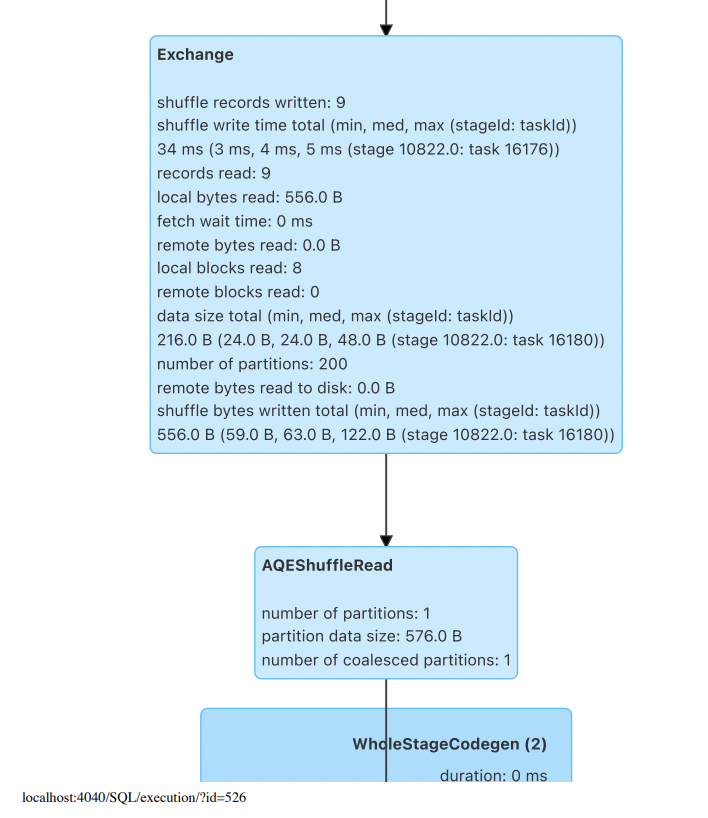

In [114]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAAsQAAAMyCAYAAABq6dczAAAMQGlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSIaEEEJASehMEpASQEkILIL0INkISIJQYA0HFXhYVXLtYwIauiih2QOyIYmFR7H1BREVZFwt25U0K6LqvfG++b+78958z/zlz7sy9dwDQOMWTSHJRTQDyxAXSuNBA5uiUVCbpCaAAOiADZwB4/HwJOyYmEsAy0P69vLsJEHl7zVGu9c/+/1q0BMJ8PgBIDMTpgnx+HsSHAMAr+BJpAQBEOW8xuUAix7ACHSkMEOKFcpypxBVynK7E+xQ2CXEciJsAIKvzeNJMAOhXIM8s5GdCDXovxM5igUgMgAYTYr+8vIkCiNMgtoU2Eojl+qz0H3Qy/6aZPqjJ42UOYuVcFIUcJMqX5PKm/p/p+N8lL1c24MMaVvUsaVicfM4wb7dzJkbIsTrEPeL0qGiItSH+IBIo7CFGqVmysESlPWrEz+fAnAE9iJ0FvKAIiI0gDhHnRkWq+PQMUQgXYrhC0CmiAm4CxPoQLxTmB8erbDZLJ8apfKG1GVIOW8Wf50kVfuW+HspyEtkq/ddZQq5KH6MXZSUkQ0yF2LJQlBQFMR1ip/yc+AiVzciiLE7UgI1UFieP3xLiOKE4NFCpjxVmSEPiVPYlefkD88U2Z4m4USp8oCArIUyZH6yJz1PED+eCXRGK2YkDOsL80ZEDcxEIg4KVc8eeCcWJ8SqdD5KCwDjlWJwqyY1R2ePmwtxQOW8OsVt+YbxqLJ5UABekUh/PkBTEJCjjxIuyeeExynjwZSAScEAQYAIZrOlgIsgGotaeuh54p+wJATwgBZlACBxVzMCIZEWPGF7jQRH4EyIhyB8cF6joFYJCyH8dZJVXR5Ch6C1UjMgBTyDOAxEgF97LFKPEg96SwGPIiP7hnQcrH8abC6u8/9/zA+x3hg2ZSBUjG/DI1BiwJAYTg4hhxBCiHW6I++E+eCS8BsDqirNwr4F5fLcnPCG0ER4RbhDaCXcmiOZKf4pyFGiH+iGqXKT/mAvcGmq644G4L1SHyrgebggccTfoh437Q8/ukOWo4pZnhfmT9t9m8MPTUNlRnCkoZQglgGL780i6Pd19UEWe6x/zo4w1fTDfnMGen/1zfsi+ALYRP1tiC7GDWDN2GruAHcPqABM7idVjLdhxOR5cXY8Vq2vAW5winhyoI/qHv4EnK89kvnO1c7fzF2VfgXCK/B0NOBMlU6WizKwCJht+EYRMrpjvNIzp6uzqCoD8+6J8fb2JVXw3EL2W79y8PwDwPdnf33/0Oxd+EoD9nnD7H/nO2bLgp0MNgPNH+DJpoZLD5RcCfEtowJ1mAEyABbCF83EFHsAHBIBgEA6iQQJIAeNh9FlwnUvBZDAdzAHFoBQsA6vBerAJbAU7wR5wANSBY+A0OAcugSvgBrgHV08XeAF6wTvwGUEQEkJDGIgBYopYIQ6IK8JC/JBgJBKJQ1KQNCQTESMyZDoyDylFViDrkS1IFbIfOYKcRi4gbcgdpAPpRl4jn1AMVUd1UGPUGh2OslA2GoEmoOPQTHQSWoTOR5ega9FKdDdai55GL6E30Hb0BdqHAUwN08PMMEeMhXGwaCwVy8Ck2EysBCvDKrEarAE+52tYO9aDfcSJOANn4o5wBYfhiTgfn4TPxBfj6/GdeC3ehF/DO/Be/BuBRjAiOBC8CVzCaEImYTKhmFBG2E44TDgL91IX4R2RSNQj2hA94V5MIWYTpxEXEzcQ9xJPEduIncQ+EolkQHIg+ZKiSTxSAamYtI60m3SSdJXURfpAViObkl3JIeRUspg8l1xG3kU+Qb5Kfkr+TNGkWFG8KdEUAWUqZSllG6WBcpnSRflM1aLaUH2pCdRs6hzqWmoN9Sz1PvWNmpqauZqXWqyaSG222lq1fWrn1TrUPqprq9urc9THqsvUl6jvUD+lfkf9DY1Gs6YF0FJpBbQltCraGdpD2gc6g+5E59IF9Fn0cnot/Sr9pQZFw0qDrTFeo0ijTOOgxmWNHk2KprUmR5OnOVOzXPOI5i3NPi2GlotWtFae1mKtXVoXtJ5pk7SttYO1Bdrztbdqn9HuZGAMCwaHwWfMY2xjnGV06RB1bHS4Otk6pTp7dFp1enW1dd10k3Sn6JbrHtdt18P0rPW4erl6S/UO6N3U+zTEeAh7iHDIoiE1Q64Oea8/VD9AX6hfor9X/4b+JwOmQbBBjsFygzqDB4a4ob1hrOFkw42GZw17huoM9RnKH1oy9MDQu0aokb1RnNE0o61GLUZ9xibGocYS43XGZ4x7TPRMAkyyTVaZnDDpNmWY+pmKTFeZnjR9ztRlspm5zLXMJmavmZFZmJnMbItZq9lncxvzRPO55nvNH1hQLVgWGRarLBotei1NLUdZTrestrxrRbFiWWVZrbFqtnpvbWOdbL3Aus76mY2+DdemyKba5r4tzdbfdpJtpe11O6Idyy7HboPdFXvU3t0+y77c/rID6uDhIHLY4NA2jDDMa5h4WOWwW47qjmzHQsdqxw4nPadIp7lOdU4vh1sOTx2+fHjz8G/O7s65ztuc77lou4S7zHVpcHntau/Kdy13vT6CNiJkxKwR9SNeuTm4Cd02ut12Z7iPcl/g3uj+1cPTQ+pR49HtaemZ5lnheYulw4phLWad9yJ4BXrN8jrm9dHbw7vA+4D3Xz6OPjk+u3yejbQZKRy5bWSnr7kvz3eLb7sf0y/Nb7Nfu7+ZP8+/0v9RgEWAIGB7wFO2HTubvZv9MtA5UBp4OPA9x5szg3MqCAsKDSoJag3WDk4MXh/8MMQ8JDOkOqQ31D10WuipMEJYRNjysFtcYy6fW8XtDfcMnxHeFKEeER+xPuJRpH2kNLJhFDoqfNTKUfejrKLEUXXRIJobvTL6QYxNzKSYo7HE2JjY8tgncS5x0+Oa4xnxE+J3xb9LCExYmnAv0TZRltiYpJE0Nqkq6X1yUPKK5PbRw0fPGH0pxTBFlFKfSkpNSt2e2jcmeMzqMV1j3ccWj705zmbclHEXxhuOzx1/fILGBN6Eg2mEtOS0XWlfeNG8Sl5fOje9Ir2Xz+Gv4b8QBAhWCbqFvsIVwqcZvhkrMp5l+mauzOzO8s8qy+oRcUTrRa+yw7I3Zb/Pic7ZkdOfm5y7N4+cl5Z3RKwtzhE3TTSZOGVim8RBUixpn+Q9afWkXmmEdHs+kj8uv75AB/7It8hsZb/IOgr9CssLP0xOmnxwitYU8ZSWqfZTF019WhRS9Ns0fBp/WuN0s+lzpnfMYM/YMhOZmT6zcZbFrPmzumaHzt45hzonZ87vc53nrpj7dl7yvIb5xvNnz+/8JfSX6mJ6sbT41gKfBZsW4gtFC1sXjVi0btG3EkHJxVLn0rLSL4v5iy/+6vLr2l/7l2QsaV3qsXTjMuIy8bKby/2X71yhtaJoRefKUStrVzFXlax6u3rC6gtlbmWb1lDXyNa0r41cW7/Oct2ydV/WZ62/UR5YvrfCqGJRxfsNgg1XNwZsrNlkvKl006fNos23t4Ruqa20rizbStxauPXJtqRtzb+xfqvabri9dPvXHeId7TvjdjZVeVZV7TLatbQarZZVd+8eu/vKnqA99TWONVv26u0t3Qf2yfY935+2/+aBiAONB1kHaw5ZHao4zDhcUovUTq3trcuqa69PqW87En6kscGn4fBRp6M7jpkdKz+ue3zpCeqJ+Sf6Txad7DslOdVzOvN0Z+OExntnRp+53hTb1Ho24uz5cyHnzjSzm0+e9z1/7IL3hSMXWRfrLnlcqm1xbzn8u/vvh1s9Wmsve16uv+J1paFtZNuJq/5XT18LunbuOvf6pRtRN9puJt68fWvsrfbbgtvP7uTeeXW38O7ne7PvE+6XPNB8UPbQ6GHlH3Z/7G33aD/eEdTR8ij+0b1OfueLx/mPv3TNf0J7UvbU9GnVM9dnx7pDuq88H/O864Xkxeee4j+1/qx4afvy0F8Bf7X0ju7teiV91f968RuDNzveur1t7Ivpe/gu793n9yUfDD7s/Mj62Pwp+dPTz5O/kL6s/Wr3teFbxLf7/Xn9/RKelKf4FcBgRTMyAHi9AwBaCgAMeD6jjlGe/xQFUZ5ZFQj8J6w8IyqKBwA18P89tgf+3dwCYN82ePyC+hpjAYihAZDgBdARIwbrwFlNca6UFyI8B2wO/pqelw7+TVGeOX+I++cWyFXdwM/tvwAqF3xMpRA8mwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAAsSgAwAEAAAAAQAAAzIAAAAAQVNDSUkAAABTY3JlZW5zaG905KLrmAAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAdZpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+ODE4PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjcwODwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlVzZXJDb21tZW50PlNjcmVlbnNob3Q8L2V4aWY6VXNlckNvbW1lbnQ+CiAgICAgIDwvcmRmOkRlc2NyaXB0aW9uPgogICA8L3JkZjpSREY+CjwveDp4bXBtZXRhPgoP7T6JAAAAHGlET1QAAAACAAAAAAAAAZkAAAAoAAABmQAAAZkAAqoA0eZeLgAAQABJREFUeAHsXQWgHsXxn5fgBKdAkUJwKFIohBb54+4QrFjR4C4BigR3gpMAxZvgNEBxCVKkTYIVCIQQrEhwl+S9/29mdnZn777vASkkeWEPcqO7czc7uzvfvr27ljYc1OBgZovng9EGhvG4VEsgVNeVMFRgG7WhlJXTKk3BG8jxmgYYxX7xv8VRib/S/8r440dTN2IaKvD7x99dd92VXn31VerTpw/NPffcUqlVEUdlMMr4W8bfMv6GPof+UMafn2b8iWOMQ8bV+NNiCXFt2PQZh7tQQ2v6JhBot2MwCI00iFTZhphafcV+6nGZb5Wo+SvTMb8aDEIjDRb/wzE6xNf8WeKvxJ/NeFnfUqIWL5mOdTCDQWikwfGk/3FCPPzV4dS3T9+YEFOJ/xL/v5D4595Z688l/n+R8d/S1oqWt599lXFbAoXFoWPEcTzoeVCTVRgVUooKr4HAs3gBu9i3pM3SN+95xb3PknOTXk0OkfAaCDyr+L/EX+l/E3b/27XHrjTi1RF0UZ+LJCEu/T+Ns2X8K+NfGf8m7PHP579xhbhxWpUNjVBpJ3OOuZeWiWf/dzbTafrry9tjZU97PFTUgGVlVIRzsV9rtuarP1WHetrjxf/igQYuKfGnTonn0v/G+/63C1aIR4zAlomLOCGeJ3RuBj7APR5UGrCsTGl/bnZ4ocT/eB//KeCrAe1pj5f4Fw80cElH7/+SEPtfwXpDfLsh+ZWb1jvnMx+WFiduzlEtd5aCODX5E0yxn36FF/9XokyCTE4yPZf4K/0vH200NnS08XgZf6IH2C3ce5qMv7vssgu9NoJXiHnLxFyhWBn/xRESUhpX4kYwS/xpiCSv5B4JAZSAOA6nJvFX5v8y/9sq/LjOf3SFWCLbhbcEsOv5KbSbYlmRjKgXqYmZ0SInXZOoKdTrqHKyIhlR1ay5XBnFPjdC8T974Xvipx5RlZj6nvI1MTNK/JX4G0f9b9dd8FDda8OxQtyXuuKhuhL/oYdbnteow1d4WZ/OiIoiyJq49P8y/pXxHz1j3OcfLdhCzH/UcYf0zkC7rhvYXspKSjcRWq0Qt6HB07smrJbaVvZYoxZlPT5whU1MKLuJUAtL2WK/+L/En/X00F/QqXxUaHcxGVOM81H634Q8/vTgt0xghVi3THTV9pZ2L+0vbijxX+bfMCz60ZFjQ+kmQg2ekn/APR0l/8IKcSsu12XmNmdaY8ZGd4wfiYZw0VJM8BHtqFTOmaKq8bkJOyl8D5aVZ4KPYl/94Lt05qggBmjCTgrfg2Xli//VWyX+QtRodMg5C5QUVE3YSeF7sKw8E3wU/6sf0Lt33bUHDcdr1/pehNeuzaOvXQtCAZn/vOAH4ln54n/1Wom/ED0aHXLOAiUFVxN2UvgeLCvPBB/F/+qHMv9LMEiM4KRbJtg1WdQEXxmwh+Cg0+gZAVNrBFO1jVajXImk6JgBLfbRUujBxf8l/hAGcSyv95QaJ3Wr0v/qq+HOXclRjhnQCXz84RXi4cPxUN3FSIi71hPi+BBuGX/K+FPGnzL+1kfIppw0rHaM+afBlgk/CTDeePpNN9rAFyy0o2HxUBqgaYItkxBX0rCCdvN3ERb76oGG7iv+l7gq8Vf6H/pH4y6C4BBBQ+kENf7Ilgn+MEdflxCX8fcX0/4NI7y0f2n/X8j45+M/bpmQ7CnkSZZLMsxZgTKmQV9AcBWY2GBUyxiOcKjp5qxAGdOgKUeoAhMbrIgD6aQONd2cFShjGjTlCFVgYoMVcSCd1KGmm7MCZUyDphyhCkxssCIOpJM61HRzVqCMadCUI1SBiQ1WxIF0Uoeabs4KlDENmnKEKjCxwYo4kE7qUNPNWYEypkFTjlAFJjZYEQfSSR1qujkrUMY0aMoRqsDEBiviQDqpQ003ZwXKmAZNOUIVmNhgRRxIJ3Wo6easQBnToClHqAITG6yIA+mkDjXdnBUoYxo05QhVYGKDFXEgndShppuzAmVMg6YcoQpMbLAiDqRumZAv1TXYMpGXDZQxDcaKDVGBiQ2aNJ9UnNShppuzAmVMg6YcoQpMbLAiDqSTOtR0c1agjGnQlCNUgYkNVsSBdFKHmm7OCpQxDZpyhCowscGKOJBO6lDTzVmBMqZBU45QBSY2WBEH0kkdaro5K1DGNGjKEarAxAYr4kA6qUNNN2cFypgGTTlCFZjYYEUcSCd1qOnmrEAZ06ApR6gCExusiAPppA413ZwVKGMaNOUIVWBigxVxIJ3UoaabswJlTIOmHKEKTGywIg6kkwJNK8TGNxhL1xFVaa5Yl1Q5iY6YIQbrZiNHVZor1iVVTqIjZojBaK2OqEpzxbqkykl0xAwxWDcbOarSXLEuqXISHTFDDEZrdURVmivWJVVOoiNmiMG62chRleaKdUmVk+iIGWIwWqsjqtJcsS6pchIdMUMM1s1Gjqo0V6xLqpxER8wQg9FaHVGV5op1SZWT6IgZYrBuNnJUpbliXVLlJDpihhiM1uqIqjRXrEuqnERHzBCDdbORoyrNFeuSKifRjMkKsW2ZmAtbJvySSbSaEC2d6kgSxeqSKifRETPEYLVSR6tKc8W6pMpJdMQMMejsVVFVaa5Yl1Q5iY6YIQarRh2tKs0V65IqJ9ERM8Sgs1dFVaW5Yl1S5SQ6YoYYrBp1tKo0V6xLqpxER8wQg85eFVWV5op1SZWT6IgZYrBq1NGq0lyxLqlyEh0xQww6e1VUVZor1iVVTqIjZojBqlFHq0pzxbqkykl0xAKS9hBHg6bCkA8eHYHb3gYTK9eNnSYwyGXrR5QKEimnaDyGfBT7xf+IhRJ/sStYp7Oeov3EKIPKrZ6jVJBIOTXjMeSj9L8Jvf/xl+pe5YS4D7ZMzN01tXlp/+SLMv7EoaCMP9Ix8j90RMrGT9WpnqNUkEg5NeMx5KOMv2Nz/A2fbrZG0CZodG6sYVyDecn0wu3Khmqo2/iicdS4vK+tsYZxDfoSsIF9UPrC52I/e6AI7ir+16GmxB/6THgHZt57cqpJD+PC+NdEWvpfhxh/euy2Cx6qew0JsX66OW95pZq0cGn/Ev+l/5fxL4wDOlbYuSPmX7JCnA12kYiI3V9TaJqY//RlCAHGAqYQGTmSiSMRkVy5AWWaxX7xv7yMAwGRfRTJAqRB7DArE0ciIk1KJbZplvgr8dcR408+3cwP1fEKMb9lgn/j5L0iBXsDrMS/uqz0/9L/O2L/t/4rXTsSEWnQ43OWaU4I8V/bMqE3Z7eoN57x7K5zn7RDpboEwymuTjYoldkK8oxX7Ouo08B3jVnqPZYJhlPxf5jzGzgsi7Ugz3gl/kr8Zb+2GgRRxtLoYZZgOI1v/W9X/jCHvGUCX6rr2hX5cLrmeN3GK/Ff4n8Ci3/fXTXyS/z7GTLzyQTe/ysJsQuEiEZE4sZT5hvheYGPsFqpmtAxXCURjUitpmJfx2bxUO4m51NG2xU6XacX0YiInqeK/4v/ZUUEkdH+rgsfNS7caqjTi2hESvzBA94bP1X/s4S4L7ZMdJ17Hm2VaCgixf8/k//V4Xx2vo5oRETNUz9V+xf75gHn3YhGpPgfHvDemBDjr5IQV24YDpC/nlm8ZFBd4x2UiStEVVvoBoU9y+OV6kCqtH2dVKqqLXSDwp7l8VSTYSptX8d061cr5RoU9iyPp5oMU2n7OqZb7Fe9JXQD53mWx5MnDVNp+zqmW/xf9ZbQDZznWR5PnjRMpe3rmG7xf9VbQgfnWULMWya6zj13HPPb9221xuTrRlhVW+gGBjzL4/U6Vdq+TipV1Ra6QWHP8niqyTCVtq9juiX+qt4SuoHzPMvjyZOGqbR9HdMt/q96S+gGzvMsjydPGqbS9nVMt+P4PybEzW/MHkhzGhGNSLpzwZrxWWgyg1o0p5RnEn0gzGlENCK+APBmfFYzmUEtmlPKM0mx35L/GTU6KyLeYcCb8VnNZAa1aE4pzyTF/8X/2Z/xY7BExAcM8GZ8VjOZQS2aU8ozyYQef/rp5uHUt0/f8JaJX9b9893+ktu/3H9p/xL/uviLhLgVvnDrwNEzEfGjY4bnGpY4B5VMCCJsnLNl9lRRpugis8JPBSKWaxT7OnEX/4sHsuAAUeJPunnpf3CDG+7cgKMdJ8ZNROJ4U0VyjY47/nBC/Oqrw/FQHRLiH/FQ3YRy/2X+cx0iNmpEqmEf6Vyj48Z/af/S/hbUcYW4OjGk8E6YFYow7xFN2aam0J9jESCmpbxkNWFeW/C8SBRX2UYr9OdYBIhpKS9ZTZjXFjwvEsVVttEK/TkWAWJayktWE+a1Bc+LRHGVbbRCf45FgJiW8pLVhHltwfMiUVxlG63Qn2MRIKalvGQ1YV5b8LxIFFfZRiv051gEiGkpL1lNmNcWPC8SxVW20Qr9ORYBYlrKS1YT5rUFz4tEcZVttEJ/jkWAmJbyktWEeW3B8yJRXGUbrdCfYxEgpqW8ZDVhXlvwvEgUV9lGK/TnWASIaSkvWU2Y1xY8LxLFVbbRCv05FgFiWspLVhPmtQXPi0RxlW20Qn/WIrplIiTE2DLBR7KaMNV2Z6vYsRitso32lo2XiuacZDVhSTdgeZEorrKNVujPsQgQ01Jespowry14XiSKq2yjFfpzLALEtJSXrCbMawueF4niKttohf4ciwAxLeUlqwnz2oLnRaK4yjZaoT/HIkBMS3nJasK8tuB5kSiuso1W6M+xCBDTUl6ymjCvLXheJIqrbKMV+nMsAsS0lJesJsxrC54XieIq22iF/hyLADEt5SWrCfPagudForjKNlqhP8ciQExLeclqwry24HmRKK6yjVboz7EIEOVLQmyrRplpqyWquoqcTCoSGr8yMj4bA6O9R6pZBUexr6tWxf9ujdvFkqLu7GQaYwii+HSXhFQ4QbHEX7YA4r1jeOl/Fj6/zPjbZZddacSIEXRRnwtpntpDddLD4pYp6Xql/7k+xWMMelIZfyxQbFgBZN8gL3ALkE4Y0TL+WPj8Msef8ar98fJk7s71Qzq5Z3tGSN08K6q6tC7KIxI6jaNjuQpSU/GMYl+6jndJdF/xfxxWon8iUuJPXOH8EeOmgtRUPKP0vwmp/8kK8YhXqe9F+lCdRIJv7hqjtP+E1P6Vnq9kaf9KIu8dUuJ/Qo3/2paJvNlDTHhmdXAUmSrwmY/0gzAVNMygavqzSrw84hExfccQVGk+81Hsqx9C9ieEecygaSSYfGj+i7oRMW3HEFRpPvNh5Yv95CfDDKqn/FklXh7xiJi+YwiqNJ/5KP5XP5T4S3FimEHzEENOiEdgD/FFfS8O7yFWadSNiJVyDEGV5jMfJf7UDyX+UpwYZtA8lKBKvDziETFtxxBUaT7zUeJP/VDiL8WJYQbNQwmqRLdMWBBVtW0tG/IoikiqSrAqvyFtzABz4IyEuot99G7t3ua51BDF/5kHooMsdgDTyBhiy5TywDNuzbcl/kr8TWD979RTT6OppuqinQOB39KJ6O577qXPPv2MVl1lFZpm2mlit/rs009BT0s9evRIXSN2lqimSJXfkDZmgDko47+5x1xbxp8y/kxg449OynnHj2EfkdABxkH8pxViZ9z6I0O7RoNeZniSJcxkBkVSEztGsR87v/mMoXnIoJcZnmQJM5lBkdTEjlH8X/wfBl+LGYYWIQa9zPAkS5jJDIqkJnaMEn9jJf5WW2N1+uyTT+jrb75B06j/W1tbgbZRp86d5Tckc/nfzDPNRIsuthidecYZMQ6sPT1MrZgwL2dcJDWxY5T2Hyvtny0S+FYt/i/+L+M/PjDVaA+xG6dkYKvScbSrC+qcqJwQKLXh01b8dtWGR7WSKh0L1QV1TlROCJSK/eL/En+l/6VBwWHVQaRKR9W6oM6JygmB0rgaf3bffXca+OBAemHoCxj8+e3OfMU4OBQEVYRXipdeamm6/PLLabZZZ1O5KPpT/W7rHK8fcCiNq/uXKyj2i/9L/lHyrwb5Z54Qy0Dhxr4mvxrjEOdGP0Udg5WMFMgnZiENCXwTi0CF6KjFfkxTiv8RDNEbMUwi4gJIUccI8RQnegm6En+l//2yx59Bg4dQz0N60sOPPETffItVYu4yOPjHYUyOQS+zzDK04frr02FHHCHyhifX3Ur/Yx86h7DDjBTIpzL+lPHnlz3+jO/trwmxdVzpsnrKWY5yqFMfM9TqMuhqyVmOcqhTHzPU6jLoaslZjnKoUx8z1Ooy6GrJWY5yqFMfM9TqMuhqyVmOcqhTHzPU6jLoaslZjnKoUx8z1Ooy6GrJWY5yqFMfM9TqMuhqyVmOcqhTHzPU6jLoaslZjnKoUx8z1Ooy6GrJWY5yqFMfM9TqMuhqyVmOcqhTHzPU6jLoaslZjnKoU//BKP9BcI899qCHBg6k5194IZTjVQhUzHXjmGaaaWippZemK3h1eDasDsfMLkdZ93867F4MuspylqMc6tTHDLW6DLpacpajHOrUxwy1ugy6WnKWoxzq1McMtboMulpylqMc6tTHDLW6DLpacpajHOrUxwy1ugy6WnKWoxzq1McMtboMulpylqMc6tTHDLW6DLpacpajHOrUxwy1ugy6WnKWoxzq1McMtboMopZ8hThW6zSM14AlIuE7YUQjEofTxMmGWLPgoNcM7AasYh8eEL8450Q0IsX/cBOvMyeP5LjEUXbymkHQgCUS4TthRCMS7SZOse99kbk+OTVnNysgfCeMaESK/+FJH/+DBw+mQ3oeSo889DB9I3uJc3m3ZbrRBhtsSIcffnhqg+TOxGNM+E4Y0YgU/8NN3v/RbYw0PJLvorgBS2TCd8KIRqT4H44q/s/nnBQdMcIc0kDagDUhxh8S4lYsGmAZnyMGR6P7Np5Br+d5UkHt5DU8bor4Q12xX/xf4k86ROMe0nxAb6RvPUuh1/C4aZX+94sbf7BKvPse2Es88CF6IawSW8IwNd4q0W2ppXTvsKwOpznBR4/hBi2a6tBreNw0S/z94uLPml5gaf/S/uNP/ulWiMNgJcAPXJ7PEexlWWT/ICKWBpLtF7Z6RSFqJXuRFZEfZK+qFEsDKfY10VIfBc8IiF4q/s/ikj3lfaOe+zHnWBpIib8Sf+F3YIorCZAYJRU+R5qXMf3jDis9eJCuEj/6CFaJv/5GauWalumGvcMbbUCHHWarw6GEFfyJ7HM1Jf5L/I+r+C/xV/pfo/HHJcT5wBrHP2NXBjD/vJfquhKGCsQvQPzBIgU+V2gKVnkd1jTA8DdQ7GMwDU5VXzmPGSqw+L/EX+l/ZfzxYywGBvy/O/YS6yrx8yLkvcNLY+/w5ZdfQbPONms+ZnMRONH8WMbfMv6W+Uf7lEyzPqdRRkhzyvzbkebfmBDXms2PeH4sDXhNP9PJIiJJamxjcOxU3FbspxE3eTBiNX9FCSPmV4NBaKTBqFf8X/Nnib8SfzbjZ31LiVq8ZDrWwQyOn/1v8OBBdOiheOPEw7qXuFu3brTRRhthdfgwDAi49gn8/tM4Wca/WjyX9i/x/wvs/y28hTj+7K+M20zyU8ktwTGV4T1oK6jJKowKKYWE10DgWcV+8X+JP12X8/0i63wgarIKo0KW/mc+a+AYz5qQxx8e+vfcfQ964MEH6N133sWbJXjv8GVYHZ49TgkT8v1LO/vGDp3Ks8r9l/mnzD+/nPknrhDrWOCHAuZ42uMNRo7AsjKqjbP/O5vpNP31WbXhaY8X++KBBi4ZH/3/+eg2evi/rfTMB2305XdtNLoVFx5+ZHFXk19k8tonvSH+Az+vWNi9yOzMMQNE//ivUlFhR2glImtrwVe3qJOUl/eCIv7487RSXDXkR16xr4Nc8f8vO/6++eZren/k++gTrTT55JPTDDP+ynoJ+pH2Oe1fpf+V8aeMv2N7/plsohaac+oWWn7mTtR1akxk/gjd07Osz6oI55J/aX7gndRO/ikJsf8VrA7l0jph6pgY3SvVBkkYLn2reNxdAbNZu8kSfLGffoVPUP5Hk9/xRivd/sootH4bzYoO3WWSFuos0aCpGIcZ/kpBnRAbkhgTEloJMBZg+EHwtnVCRW2a5HIkSRgxCyqdWC4FeKjiZBj1cHkONwFcDwhhAOf/uWyQMij2i/9L/JX+V8YfDIZl/NWJQyaGcT//fDOqld7+so0+/6aFFpyxhXZZeCLqMhGaCQfParLoI3NZ4jCWHaxo818mUKLkX+j5tkAHZ+hym3zJK7hXHAhncf/4gUdWJCPqFdTEzCj22Qka5DUH1X1Y5WRFMqKqqR2JubF5fyb/9x8+ih54rZUWxa/bJWfoRJNwJowjvzzOSMGRpFcnZU6C5eokJlS/k/hGS/J186tqrAzTraFWxi0jRg5tYaWVsAxHsa9+EF9xFBT/x1jipKjEX+l/ZfzBuFDG3zhfjMv5h/+g+vpnRI++NZqmnJTo8N9PTFOEpFhH8sqclk9wphJhTSzdXU4TVP6REpx464K0d/8t+hZiX0AdoxxXNLC9lHWUbiK0aiHOv11vtejqnk7MTjneCevxwZN2BoTLJ2U3EZoWxMW+TPXBI8Ff8J7nqtBkTDHOx4/3/6PvttIVz4+i5WbtRL+dDqu7GFx5DVcP1ItfZJx4tPIqMLP5JInw99iHnq4Kh5qkqlDGF4U4kkCK/eL/En+l/5Xxhz2AAbGMvx1u/vkE2w0HDG/DFgqiAxbXjFjnuDDTBaAx7s7g1+Y/mYt/vvnfWZdw6yj2kZPIhk5NHpo4tAk7u+f2iKw8E3zY2BzSFtHJFFWNz03YSeF7sKw8E3wU++qHn8H/HFGHPfYdTTc50eqzdw4bGdQcLzq0wvktcfVBEzVpIzmFywodlgduzpNl7dhyZlNxkJtT8mlBQIT2ZaAbKVS52C/+L/FX+l8Zf3iw5bm1jL/8Q7mjzD+vfdpGd40YTQf9fiKab5rKnmKd4mrnbFrVZo/zo2VX9ftP1WTlE/sHY1n58dw+EmJJI8wvjW9SMhKkFrgZ/kt1yDUa61a4yRnW9SoKRiZF4yRY7MPpHcf/L3zcSr0Hj6KN5+1MM0zOww1fOzY1dAJmHYJbN7Q5x5NPZi3GWMxdXkK0dv9SSupQ/UCzPlCzoybAKPaL/0v8xX6BbiJ9h7um9JzQF/0YX/pfGX/K+Itu0jD/kF4jfWhszj+8uHPjsNE0P/7qutNCYQ+idObGJ+vWfKH+b4Q17aRYE8nkXJt/62qNOKnajmG/wZaJcFsSBIxzw9ePdKN1mSQ6xm5YPJQGsOTH1CMs9oPrGzpQXNxYAg+ye+1oqPTz+n/Aq6Pp/tdbaZuF8GcdyUz1N3i6rKp9vkjwApBLr7R/EmldftXXbjW7b2GiVLEPTxT/8xpQiT/rKaX/yWADN2TJTBpkIAjjUZj/kqiMP9yXyvir05X1KIFpgAnsn2f++efbo+ndr9rohGUmzsxHwl8HB27tYAUIAEr+lbdj3DIhPgt+8v7LWcmRMXlpx+FW1mCsN2M4wqGmm7MCZUyDphyhCkxssCIOpJM61HRzVqCMadCUI1SBiQ1WxIF0Uoeabs4KlDENmnKEKjCxwYo4kE7qUNPNWYEypkFTDvC6V76jf79DtNn8nWWFNw2empa0cC/UpQdEIyphmg+Hcph2goy3X6QDb0PAf/yLXYpAxj9cqwf/OZQfuuOibKbYt05f/C/rFCX+Sv8r4w/GWx5A8a+MvzqFOFeMz/PPv98bTS991EZnLIeEuMH8JxMpBDz/sdig3mSV4aQONd2cFShjGjTlCFVgYoMVcSCd1KGmm7MCZUyDphyhCkxssCIOpJMCTSvExjcYS9cRVWmuWJdUOYmOmCEG62YjR1WaK9YlVU6iI2aIwWitjqhKc8W6pMpJdMQMMVg3Gzmq0lyxLqlyEh0xQwxGa3VEVZor9sOfdJ4e2Urd58OfdFjNd0kplspy4ir7+Zjls1fQnOzyfk+Zu1AHq9gh3R0KLa142RoGdT8uyJ+GeKDnQwCfgoagiS72i/9L/KE/cJco/S/9eoY/yvhTxt/xcf4ZjLn1pQ9b6YzlJ+EZrnak2c1EVU6iI2aIQSvaAKpKc8W6pMpJdMQMMdjArrFUpbliXVLlJDpiAUl7iM2ajIz2u4KZAedfkcZmiCNWllE5V0TuFKWCRKqBBsv4KPbF0x3I//2RED/1HlH3eTHDhlixtuS0VhJc3/4WV54n0dWo/aEcEmBZ+WW/yCvbZO0P5iymwI9/9lTrfDHFfvF/iT/tGradyIZY7TrWfxjyETpnHH9K/yvjjy5AlPGXp6KxP/8M/gArxPjI1WnLTyy9U/up77fcZxsfppX3da9rGs36P3RD9aappY0y6OtMeJQKEqmkEOdvlvHBxoDH8SewlGuX4qhGdUIcjigVJFImRnvKp5vrgqhRrSgTWDmDmVD+tK0vPLZkJVVm99e8YSp1gaw3s9k1WCmDhKjY14CSVVNzD9z1c/r/2mGjaMjINtp0Hry9kVdx0citDLmZmJJElVcmQWJPRAsS2jZ+aTAHA3iyaquBobxwzttfCkPC0G5IbYEh98cvUCn2i/9L/JX+V8afMv5OKPMPrxAP/ZCwQswP1YX5TyDPfOngebbkP+qfH5r/yAox5ylcTI5IRMQkTaFphjwHCQ3qixWimCk0qSETRyIiTUoltmmaXYNRwxQiI0cycSQikis3oEzT7BqMqqYQGTmSiSMRkVy5AWWaZtdgVDWFyMiRTByJiOTKDSjTNLv9Xh6FLRNt2DLB70qEVLJvhGRAuQrrxoxbeUFYBiH/hLKojLoiYD7kAHhpALSQ7vCKMWhOpBXROrQ8C5Rf7Ksr2H/Rp+zLQAvCuPg1cpNu8T8HGTykoMQfx07pf2X8KePv2Jx/OCF+ESvEZ66gD9XZSG3zr0EZqGSwwokH/CaHlRdxJCLSpFRim6bZNRg1TCEyciQTRyIiuXIDyjTNrsGoagqRkSNeXNsyoUKvYhNm4NWs5ZXXqVSXYDjF1cm6cpicUxlWUSrwin3NWBr4rjEr+VIwnH5u//fHCvFT7yEhxkN1mkBob6zaZy4/NMd5lhxA5FettDh/qpllvHosmthqoXIsKUOGQZjZrMQHcBmUlNKzyKUWoQXDye5fagVd7AenFf+X+MP4il6GgCj9T8aLMv6U8Xc8m38Gv0/0IvYQn4ktE99/SBSLmmA42fzXqKxqpzKsk/Em8PyrkhA7R0Q0IsmpwZPmG9HI1YKGgXaFpgTo9CIaEdHzVLGvyZz4xDvGeVTRdoVO2+lFNCI/2P+SEL/LK8RIiCXbDO95sKQVPfL5IY/RV19+oU0eroAnYp6OZ5ptDpqj6/woy4JgX4BpqMiSaS6DQJaHgiQmrBhD2B89+ls6cPM1pNDevc6ieRZeQvcdez1WDfaZbWYj8j/Yj0/quPuXfc9mRwwW+8X/Gv8SDiHsS/wFR5T+J2OZRYj/Mf99418Zf+rzT0cef4fIQ3XYQ4y3TPD0Kl0jjhdhMslAu0Kn6fQiGpF8WAI1IeZflYQ4Dr+1m3deC6g6KndXXcs4VW2hGxT2LI9bPQmqtH2d5tpSrkFhz/J4qskwlbavY7rm16QtWCKjomd5PCpERKXt60TlkN8lbcESGRU9y+NRISIqbaQTV4g5IcbBu1jxWQ5JOHVHK9HRu25O770+Qn6tQqAOQmX863XlDTanLXc/KOWkosA1sTUF9ilI65SsIniDC2odNZp2X/+PYv/AUy6i+Rb7vdQkz+KxbTuCfcnhGQdfxabEHByiJ9NQHBTas9/o/rmmYh+uNNdGv8q8rz4Gr/ifHWNOKvHH3ij9j/tNGX9kLkGXkPEaXaTZ+D+hjb+cEPMKMb9lgkcEGx2kbzQ5qV7SFiyRsZRneTwqRESl7etE5XCdSVuwREZFz/J4VIiIStvXico/2H5MiJtXrL9JefUmuj6iEUmWBWvGZ6HJDGrRnFKeSULXBxmaPipHxBcA3ozPaiYzqEVzSnkmKfYtjf1h/u8/7Dt6aiS/ZSLsIRZHclmOJX7LQQsS4s3onTdepznmXYDmnHdB4VvHXvB33WipFVcPjWAl8Cvf/tYDqL+M8VIcILKlQkZDLsK1QFcU1OboUaNoz/WXA7+N9j/lAlpwsaXEniwpA+MyFuWso6XAluN/t6/1aK1WG8NiPzxIWfxf4k/6nfaR0v94FLLDRowxH//K+MMemHDG38HYjsjvIT49PlRnsWKweTajkWU9jKEezUtw/P24+T/ZsNo9NEsGxy/7SIjlD8/piuN1RiTJKliuYY4LSpkQREhm4operCtTdL6s8KN+QnKNYl8Dd9z7P26ZwB5ibiPZ8cvtj6eQ8AVlGZqO6dGd3nnzNVp3yx1p/e12c40KPd4MjH8PDriRXnjqCZp88ilp2/3/Qp07T0RvjXiFBlx1kSTC3XfZn2ac+df0xeef0d3XXUH/GfIkfff11zTtjDPSCmtuTEuttLrYbxv1He2xHhJi2N/72HPohcFP0HODHqGJJ5mMll9zA1pxve7R/jdffUMP3notPf3Eg/T5J5/S5FN2ocX/8H+06sZ/okknm0zqu/u6K2n40GdpkaWWpymmnJLuvvFq+uarL2j+3y1FG263J03ZpUuM4+f+/Rjdf/M19Bnq6rrwIrT+1j3o6nNOgL1W2mDb3Wi2ueYB3kJfffE53dH/cnp+0OM0avR3NNPss9Pam+9AXRdYJF4bIz7mPc4Sbf8w2AUhg0b+Fx9LzXkt2k/B4zbgNqscXtvjxX7xf4k/ThxK/5NRKgwODMr4g7GhMv/9L+MvrxAP/ZAT4vy1a+PL/C9TRjY5gOgg+V9cIZYgls6sM6AN72miq8yMTGY3neRVttEK/TmVqVZW7Ft4J094bwlujq0IqmyjveeNl4rmnGQ1YUk3YHmRKO6Hh+qe5ofqZMuErr7yWiByYR0cEWdH77oFvfvGq7TuVjshIe4Bia+My7TSB++8Q71225y+/fYb2mbvI2iFtTek847Zn5574lHqtvKatNPBx9GXSESP32Mb+uDdt6hTp040yWRTYG/yZzIxbbrzvrT6ptvQKCTEe2PLBL9kfU6sSL8+bGhIHtkm0S6HnUi//79V5U9u5/xlH0mYO03Umaaedkb65IN35bqX/r81aOeex3PuShf2Opiefmwg/WaeBen1V15EDToJ8nmJFValXQ4/STj/HngPXXLyEXJnPCmw/XmRFL/y/HNif/+TzqMFf7c0ff3Vl3TCXtvQyP++SZNOPgV1mXpaeh/307nTxLTbkSfRon9YESXDRBsAX3fKWZN9viPvSb42bsGq/zW69P65rryU+l8/iaKbXYr94n+JkRJ/2lXQY0r/gys4HsLYZKFRxh/1CHvm5xh/B7+nCXGzL9Xl/k8ju/L9Wa9Qz3mpNOsnzGsLnheJ4irbaIX+HIsAMS3lJasJ89qC50WiuMo2WqE/xyJAlC8Jsa3aZqatlqjqKnIyqUhodIeMz8bACL8MmGp2FPvoNuI+S4LhKedLRd3ZydTH0NcKfE/USsaB//XDHPylOqRhYt+GSo0Avvxe2EP8zhsj8ADdb+hXs84hK76aMrbQ+tvsisR1IbmlO7Dye/Nl59P0M8yIVeKj6GwkrF26TEvHXHItTTXNdHT73y6hW6/sQ1MiiTz49Itplt/MRY/d8w+64syjkRxPTmddd7/4Zk8kxHwssPjvaaeeJ9Cob7+ls3ruQSPffpMW++OKtMdRp9MnH79PV/c+gTp17kxb9jiQpp9pFhr0yP3U54Seksj3vvkR1DkZXcQJMVaQJ5u8C+174tn06znmpusv7k2P3vF36jzJxNT7hgex+jwxHbXzpvTem2/QnAv+lnZF0j0prufqc0+ipx59QK5lv5POl4T4tqv/Srdd04dm7ToPHXgq7qXLVPTA36+l6y46g2b89WzU69KbqTNmX05rpen5JBuQuRoQwvT9z/zNMuAcG6LE+kFdUaWho+HDKTvr4kBRCymOyk5I54v94n8JNT6V+AtdivsY/GGdRbqP9TeWAS/9TwcUnPkQdymqdBl/ftT4O4QT4o+xh5g/3czerMWfOdfiz+jGsORf1n0x0+E1V+zO+iFO9mzPCKmzZ0VVl1ZHeURC4zk6lqsgNRXPKPYldfYuie4b9/7nTzc/gxXiTeflt0zgwqTHhf2iuGZ+lRqvEHNCHA+eNyDjW9rr2N7YjrCsROlobB84fq/t6O0RL1PniSel0d99S9sfeBT9YbX1RP/Ug3ai4S88Syutrw/i8drmaFTy/JOPwmwbLbhkN+yU6ER7boAtE7Cx19Fn0qLLLAetFrrp0nPp7huuovkXW5IOwMN2drSObpWV4c8++4xef+kFugpbHLje0/rdTVNNOx1deOxB9NRjD9Fyq61L2x50tNziiJeep5P3+bPondL/HmrFdfbcZj2xuc/xZ9PCv8f9oI6P3x9Jh227jtjfT1aIu2F1eFt6Y/hQuecV1+XtG3gIEavaFx5/qJQ5pu91NMscc0oZdifXY+3P3zNRnrDFPqe14m12Jgsb+J/LNz8gkzJSGLa4GhdXhkNQ7Bf/x0hCPPi/LXAIlfiDD0r/Qxzk438Zf2KvaTAMtz/+Dh45Gg/VEZ3JCXGtGjdOW/8LI7gYEl4UNLAdWDUVz0jzz4Rm3yXEesP5bQd/e2byqnpOZKksM1MbpYKGGdTC/pzqsPJRNyKm7xiCKs1nPqw8RqJIGWZQFLOTSrw84hGxAo4hqNJ85uOXbp+/VMfvId4MK8SWnPF2CfaLee4YTojffJVW3WhrWmPTrUXShpUUnjum6jI1TTQpnqBFgU44Pfv4QDqv10FSwa9mmZ2Ou/RG4LqWqYn1cNp4h71pjc23Qz3J/zY5t+Ghut3XX1bs73/KhbQA3jLBWgOuvJD+0e8ymm/R39FBp16Er+l1ojv+9lfs+f0bff75J3KtbB/77MXeqf3vpGmmmZ4uQEL8NBLildbvjrdhHAJZG705fBgdtyffB9Hp/e6kL7Gv+ZhduqOOFjrqwn70a+wVtvvfY51l5D73OxlbJhbvRodvvz599N7b8jU/NipTB5TZV2z/4DMuobkXXhT+QKILB8lv2HD/mnSoV/nMB9vhw+6f66v6X7TkF4helejypIUK7e0X5n+1B1GxX/xf4q/0Px50yvij47kMvWN3/B2EhFi/VIeEuB37QShzgV6h5wjbndI92PxhZdSGU/WMCcy+bpnAvYoTogfCzYfAZyqKIhJ0DFT5DWljBpgDZyRUWuzLwMPeMM8lxBxvvgK0SGZWLODlxswdb9x6GUgw8GXVReVQrwHHly0T72LLxPzuLROcXbWktEwS4tdH0Hpb70TrbtsDlw65tLdVCBja/8LjDqan/jlQbw92dj/6NFr8jyuK4kn7/plew+rs6ptsS5vusg8Xwr8W+uKzT0U+OR56a2ttpT35oTrY55VgXhFmnQGXX0R3XPdXmmeRJZAQ96XBD99HfU/sSVMgId9yj4NpZrwP+fNPP6Zzj9xPaj0Nie7USIj5engP8YpIiLfaAwkxjjdfGYaV3q2hxyvJd8FtLXTQlmtC0kY7HnIcdVtpLbHPifPxe/4J/Bba70RsmVhyad1PDV+ss8UOtOxaG3B1eoT7n2b6GWmiSSaJ9y+uNB2DkRkaIpRVf0Cp4n+2LzelOTCo5v5nE6FWQaIpsy0K3L5Os9iHP9gh7DkG7J8U/8X/8Ae7psRfGPbYH3AIh4wdsQ+pq0QEldL/cjeJu6JTOKjMl+wxphkAn0D63+D3wx5i/2GOcNt6s3y/+CcBEzhCGzPAHDQoA4UxmP/FopkK5vV6jJkbNm79miEZy/bTCrHrfHYPDO1iDXqZ4UmWMJMZFElN7BjFfmx88xlD85BBLzM8yRJmMoMiqYkd4yf0PyfET2Of06bhPcRxfII5G7eOkT3Er+Kht21pTV7Zdfb57Q+8/5dXLYf880Hqc/whNN2Ms8iK7C1/PY+mAX5M3/7y9gneu3vPTVfTDDP9mo44/2rsv50aD609Q6cfuDO14K0UZ9/0gOwJ3mM9rBDD/v6n2gox0YArsELcn1eIlyB+P/HtWB2+7ao+NPcii9NBp18i9h/GvuBrzj1B3o5x2rW6Qnz+sQfTM48N1BViJMTsxbeGvxwSXZKtFVNja8VZh+9JLw75F02D/c+8gj3ppJPRgKv70tuvvSLNolsmlqH+F5yGN2pci+R4Gdrn2LOJH+j79KMP6K7rr0bdbbTh9rvRJPAJjw08xulOX9k0IfLUioZxesslw4FC4l4wzP8qYQ1eP2YB/rEBZglIdQgbuVyxX/xf4q/0vzL+6NhoI2QYMnUclRHaJGDx8ROPv4NGtmGFmN9DjBViHHX7ws5OopMUg8wxbPzPSqW6nWZFI+l4rKrUUeynhNjfQfXuq3TUrQvqnKicECjZi8UT02HVSqp0VK0L6pyonBAoFfuaUCWnOKzqxCodVesC5tiWCf10c1ROCJSO3m0zfJjjdXRmLoGDZ1pBW2il9TajLfc6iL76/Avq1WNz2Xe706HH0ZIrrkrH9vgTvYutFqts+CfarMd+9AkSx167bCFvlph62hloxtlml32/o7CHd5WNtqTNexxA+h5i3sNLdAAS4vkXwYc5kB3fdkVfur3/pZoQn9aH/vOvx2Q1mJPDeRZdnCaeeBJ6/eWh9CVWmzkZPAVbJqaemleIecvEw1gh3oS22hP7fJFlvjn8JTphz23k0bPTsULMe43fQuJ7zuF70ycfvi+2+bTi+pvRwAHXY+9tGx1wIpJzvKrto/ffw9s0tqSv8eq1X885j6xMD/vPU3jt28d4+8VqtEvPEzVX1WxEfQWH8VaOFrxKju2z83gY1ndCBHPKDoQD8DPffyf818j/khxLnhwqgL4kxUzaImexX/xf4q/0vzL+jPXxV1eICQkxf/iKB+V08BSac5IsYmH85/mi4VGtpErHQnVBnROVEwKl8TX/yhNiuVDn0Ca/GuKdubtX1DFYyUiBfGIWmiHwTSwCFcrcHpup2NdMJDqogjgHKuoYwZ8S88Lm09jxf79XsIcYn27eLD5UB8Pc6GhYfh9jC/6dc+Te9B7e8IAAZKH8x3tVObf7Ix5WW/dPO+HdwlfSw3f+nWae4ze0Fz65zPH03KBH6doLzpB3Eu/Z60y8oWJ2euf11+j6S3vTC3iHb9vo0dRluulphbU2lle6dZ54IkmIj8GHQNj+joccT13nx7t9cT333NKPHhpwHXVdcBHaCXy2f/dN19B9+Pf5Z5/QvOCvucWO1O/8U9h1dOjZl1GXqaahv4F+cdAT1G2VdWi9bXbGdbXQ20jSLzh6f7mPQ865XFaq+Za//PJzGjzwPuxJ/ojmnG8BJMB/oD3W/oPYl9XqRXk/M9HIt96g6/qehfvjexhFvE1iWfbDNj1oItyDHOoqQbmPBNeJfR5gmCEfKhGhmJB71n4IOfjmf75/9jUX44NbwPzPxfngtmnjfcVSQQBByKDYZyexI+C74n8JiBJ/HAvaV6RvBVw6GvDS/3T8L+PPmI+/g8Onm093D9Xp1KBnRJ8eRgrkE+KPR/rAN7Eqi1Bil0NWDh7geSWk2eEqUNQxuIyRAvk0/tvXhNguXC5ZTznLUQ516mOGWl0GXS05y1EOdepjhlpdBl0tOctRDnXqY4ZaXQZdLTnLUQ516mOGWl0GXS05y1EOdeoZmj7drHuIuYimVTY7hDzC6uIZJL7GSasyEVPya1KSDpSLK5Sq589c+ygkk/wBDz3U3ti0z7bsuPXKvlj9fVveMLE0vrzHg9GLQx6n3lg15is79tKbJKGXUcjd/2jcQyfcA+vw8WPu39sPXpZxaWz5v9jXNtPzuI2/0v7F/5yCjKvxr8TfzxN/DfcQ+2Hnh+IcGHqJCl05EynLUQ516mOGWl0GXS05y1EOdepjhlpdBlFLvkIcq3UaxmvAEpHwnTCiEZEOWfV7kpoBDxtIG7CKfXhA/OKcE9GIjHX/93uFX7s2mjaZT5M6+6GZroiTPA4+bXPPT0MIY+4QJZXqOchQUQuyZE42+dBVS31vru51U578yR9yq3Vs2L9vwA103YWnif9n7zovXhs3Cb0x7EV5yG/FDTanrXbHmzP4mt116b15jqgEJZXq2fjj7/2Pa/8X+4gNji+E07iI/+L/4v8Sfz99/+Mv1b2IL9XJHmKZKtx8EdGIxPklcfI5J8wkDnhNm2cAuTGrh6g6/YhGpEPZR0Lcir+U8qSqd5puI9258QyyxHCDSbuKeQ2Pmx5+wRb7E5T/eYV4CF67tjkSYv7YRuxJ8mflaq/S9petaNDkV3vxn+r5UE3eF8sTOusZz8efTjrKkWJy4ho6oYZxbf/pxx+kR++5jd7Dlgj+BTDDTLNiK8R6tMTyq+Ce+A4n7Psf1/4v9n/Z/a+0f2n/OGtMIPMPb5nghPhMPFTXKKNKsyBjXsPjplXyL59/uhXi4CwB3nGeX3WwOfWHw1gzEFmli0W9nagFqeezspfFwj8YiaWBFPtxqEh+FQdFL1X47GYvY7p+xC0T82PTv6m3IvnjpBbqkugCYf93kqUr5geJgICbIpfgcZ0hVoMlBQYqeXNQ1caMhF4UlzdWsV/8X+IvdgdGSv8r408Zf3Ui6UjzzxB+y8RHbSR7iHWm+8Fnmw6t//MUqUeQCIhaEHk+a3qZlvwx51gayPiYf7mEOL+teOHGrtyA/RmOxarrShgqkEPNVvFcZZzctHNYFVEFDO/AYh/5TXCh+sp5zFCBY9///V/GQ3V4sUL3ebBzVZKQSvuDxw/W8eVBAf8UE1JOkKGB/f3xFttWLCNLKeDpV53eXyfeNsEBwgdXx0vOrUCK/Xr/K/4v8Vf6Xxl/ZLAs429Hm38G45WmL36AL9WtoM/K8HSns6mb/6xZG81/EvlBV2KgftI6HR+MX0L+FRPiWtrkM07nF0Nr+iYQaO40GIRGGnQNU6uv2EeUNw/amr/GI//3H/YdvlTXQt3n4+vXe5Az2r1NElVmcxCEQGC+0CFxhjJ28sjqsX69znYIp5vk++fVDQ6T+sFMfows/bmw2Ic72M/F/yEsOEb4Hwcb/i/xJ76QflL6Xxl/yvg73s4/umWiFVsmJkGfbXSEcc3GN1OpsY3BQ2Bl2fIXmn+18BbikLOY2zI36kqdDJMZPyoHJLm2MaMmh5rwGgg8q9jnldKO5f/+r2CF+B28dm2BziFh5d+v1TALvNDYuvbLRIgLRmxiBsK/TnVVGDpWRuRBT4HKQi4cvkQskmK/+F97EcJBjhJ/0iesL3Efk44Vu1fpf2X80R8GZfwdr+af7KG6MJqFbhwogAqjQoqe8BoIPOuXln/FFWL1pHcFczztcdXOxIFlZVQbZ7/ObjpNf31UbXja48W+eKCBS8YH//cf1oqH6lpps/mQmaL9fWLK0678BnOr35yq8UNzmj1zamyTc7hBzmRkKdjLmBfiQOQ8f+MBPNljrB+c4FqKfXiFm0F8pZ4t/k8/MjmCSvwhLkr/C52E+0gZf/THURl/5VfheDb/DB45Wt8y4d5DHGZCGc34mrXldP4DmR8l/4KLqk5hF2EmwC8APuIqJDP1CAXEs9G9IrKqEjfnhAoSkCpxangRPA4V+7YKPCH4X1aI+cMc+HQzJxuajYX251CReAh8AWH7g/RcbHNgHSkXdHQDMXJbKahhBJQpS31Zv/KdNqmm2A8+ZG9x/2PfihsDX0Dxv2y/EeeU+BM38En/LINOhoBpRU8r/Y8HpjL+hDGkjL/jZv4Z8n4rDf0AD9XhLROW+kpgysDOjVM5ZLzHqeRfFcco6fNPXSFmh8lgF9wrDmRew/INmVmRjKir18TMKPbZCRrSNQfVfVjlZEUyoqoZ8iGxFmQ/sf/7vzwae4hbaVNsmQjNmozCZH55PPGCIx+m4PtHYss0B1+YgJnSV6hpSQ5LeYAulGGa30TMB+MykYNuw8posR+cou5h7xT/ixdCrHDElPgr/a+MPzJulvF3/J9/ZMsEHqo7IzxUVxvTbayXyTAMdg7UxMwo+Rc7AS+xQnqc+028E9znXBfYXspKSjcRhlpYiVcXeA1PD6tFdrFFbi5jivX44EkrA8Llk7KbCE0L4mJ/7PnfXru2KVaIpcUb+R+/VjnxbeUtFazEJ0mEQ1tK2zHOh2t/6HWCnkm4iPy51+loGYsNUNCptX+xX/xf4q/0vzL+lPG3g80/T+GjV/ZhDp4H4yqxEjb9Jdho/pOZueRfPitihyEnkXdTaWLZxKFN2Mnh34Nl5Zngg4NQDpXKOVM0uUtsEutHYVm1TPBR7Ksf/E+KzFFBDNCEnRQqmCXE3UNCnN71wAHHq7mcBGtDWJcUG5khbiAwkLhK0gs85swVe0yKtpU3GPjFfgr34v8Sf6X/lfGnjL88SfAMoymRTBlu3ggzyng5//BbJobal+rkLto/Zbelt50mBJ5jMXvKOVNMdTZhJ4XvwbLyTPAxnuZfumWCLzC7ama4Q5fhRIeXk+O9OJVmaKrWQq+JZlKsKxT7cDq8Dh91BP/3w1smnsYeYk6ItVn52rGpgd8jzAw7QptzPHETa1ab7pFZ/MII3uNTv38pBaHpB5r1gZodrRaMYr/4v8Rf7BfoJtJ3uM9Jz9GOIjwbY5hV+h9cUsafMv7W5l/pNa6/BJq7Ffcp7jyM4x9mPSA/3fzHWyaGfogtE8vre4jFUJOTdWu+kupqaFYkKWZsIRrGf12tESdV2zHsN9gyEW5LnMA4N3T9SDdal0kUGLth8VAawAZfU4+w2A+ub+jA0NGit3KE3WtHw+I/r//lwxz4dHN3fLpZRwYeErhD2FG1zxcJXgCiVWn/JNK6/Kqv1eoMBBZKychU7Bf/l/gr/c9GijL+yGALN+j8W8bfjjT/DMFbJl4In262iM5g6ug6p2ZCJqrxX1OACnQ4LH5h+V/cMiEuCX7y7slZyZExeRGn+RKMq56VNRi1MoYjHGq6OStQxjRoyhGqwMQGK+JAOqlDTTdnBcqYBk05QhWY2GBFHEgndajp5qxAGdOgKUeoAhMbrIgD6aQONd2cFShjGjTlAK995Tsa8i4R7yHmFaaUvGpaxl+pC0tP6G+ohGk+HModsRNkvKEnHXgbAv7jFRspAhn/cK8e/OdA3hnPRYv94v8Sfzatlf7HP4vK+FPG3448/wziPcT4dPOZDV+7xrMhz3w6//H0qBTzw5ExHOHQhqpWk+kZNOUIVWBigxVxIJ3UoaabswJlTIOmHKEKTGywIg6kkwJNK8TGNxhL1xFVaa5Yl1Q5iY6YIQbrZiNHVZor1iVVTqIjZojBaK2OqEpzxbqkykl0xAwxWDcbOarSXLEuqXISHTFDDEZrdURVmiv2GzaansafdXjLhPQh60hclRRLZbOPbfjsFSqc7PJ+R/mzLQpyKTuku0OhpZXfPcx/DEqH/GmIE20+BPApaAia6GIfPmRfsUuK/9OvB/ijxF/pf2X8KePv+Db/8B7ilz5sxZaJxl+qS7MbT4B8VDmJjpghBrVgw7OqNFesS6qcREfMEIMNLStTVZor1iVVTqIjFpC0hzhegKkw5CP8xuAluYBmuYUq4ezLheQjyhJiWqoeqaSQ1cPsYl9824H83x8J8VPvEXWfF0NJFgq6QiUDjDR9aH+LK8+TOGjU/lAOCbCs/LFf5JVJsvYDcxZT4Mc/+1h4FfvspeJ/DQ3bTmNDjIaOxQ9DPkJwxv5X4q/0P/0BXsYfHorL+Du255/BH4yml/Ae4tPkPcQ6SpX8y4/bPGY3PkwrH+uTbvh0c1RLkgrWWMO4BvNC/Kdt/eCEJStBDnWbX5pdWF5Tau6cb3YNVqTF/jjx/7XDRtGQkW206Tx4ezCv4qKRWxlyMzEliSqvTILEnogWJLRt/NJgDgbwZNVWA0N54ZyHuRSGhCHKSUCpLTCE5BeoFPvF/yX+Sv8r408ZfyeU+UffMsEP1eEvsDb/CQMU+tUAAEAASURBVOSZLx0l//rx+aesEGfpZCQikjzcBDPNkOfowpzPXkzhe8qLOOpGpEmpxDbNYh/dA343P0QPmYMiI0cycSQikis3oEzT7PZ7GW+ZQEIsD9XFZBXBCUXOW/kIaazgVl5yYJbxPQihylHXbg46bAsvDYAW0h1eMea6JSlmROuIVgK/2Idr1KXF/xxDEn0KxS2BUeKPfcLO0GDhs7im9D84QoOkjD9l/B1X8w8nxC9ihfjMFSaWEcx6qs2/BsPw5ga4yMkQK59V5vp/ptyAsPJm12BUNYXIyJFMHImI5MoNKNM0uwajqilERo54cW3LhAq9ivkz8GrW8srrVKpLMJwkP6krCke1UxlmZrxi37K9Jh6sspMvBcPp5/Z/fA/x/LyHuLl9nmjlLdg678p9ya9aaXH+KDOzePVYNPGnfltdDh9sjjM1K+J/vjd/+yIv9sU58It4gn3EvlKXFf/DH5znyQGkxJ/8xIQ7Sv+T/lLGnzL+jmfzz+D3CR/maKUzsWXi+w+JYlETDCcb/xuVVe1UhnUy3gSef1USYueIiEYkOTV40nwjGrla0DDQrtCUAJ1eRCMiep4q9nUyF594xziPKtqu0Gk7vYhG5Af7XxLi8B5izTbCc/6ciKE6SXB53y8fATDKf9rm6ViOaDYgApIGa1kyzWUQyDyHo26uBwfr8yHZTrEvXin+L/GHflH6HzpCGX90fLRxkofKMv52iPmH30P8El67dhreMiF/tOG243aUiU+bNT+3K3SqTi+iERE9T02I+VclIdY8wvzqb955LaAqbV8nlapqC92gsGd5PNVkmErb1zFdu6+kLVgio6JneTwqRESl7etEZcnPeMCxqBUskVHRszweFSKi0vZ1ovJYtR9XiPktEzh4FyteSy4Dru5o1faQZ+Es2FgRNyO/XpnHuJRlgSkxB4foSRqsCTCL8U86aCokqnwq9ov/S/yV/sfjbxl/dBbiYbKMv5gzbGrhiULmFcwXzGMcQMWmxBwcojfu5h9OiHmFmN8yka5RL63ZWfWStmCJjMU8y+NRISIqbV8nKofrTNqCJTIqepbHo0JEVNq+TlT+wfZjQty8Yl2188lcaoVmpZrx+QJNZlAvOqfSjbB+GsZCYEbliPgCzkaFLaSVMag6OeXLFfs/1v/9h31HT43kt0zwl3TYs3zoKMPelK0Pwg8P0kFmXmZ91dRS2v5cAqu89rceQP1ljJciAZEVr7g0zKWhKwq+pmJffVn8X+JP+5v8SUX6Yel/ZfzRUb6Mv+P//DMYH716Ce8hPj0+VGdzpcHm2Qy3r83Flu5zKeNaDQlaz3AaEY1IUhesGZ+FJjOoRXNKeSb5sflHsuHrMdwsGTQr6g0kxPKHZ9N2deUFkkLCcg1zXJBnQhAhmbFl9ma1RH8lJKlWsMwE9K1Li1omLPbHpv/jlgnsIeZmkB2/3P54CgFfsJSEV//Gwy2VNVSIE/BkbwUnsfnhtT3O9Wj7hyQ4CBkU+/BN8X+Jv9L/yvhTxt8OP//op5s5IcaWiTg92vwXGNnkCKLkX5J4fF/+GVeIq4lJcm/Cou8NyZxuzGpNiVZ1f05lkpbyktWEeW3Bi/2QXeaeqbrFaO9546WSOSd5PWFJN2B5kSjuh9euPS2fbtbXwnANvBaMsViTU3Tj9KvPivnKWG6vxNc/dvOfOiVGAuBSKWdWpol8TeygYr/4v8Rf6X9l/Cnjb3gcu0PPP4Pfa6Wh2EN8RpMv1eXzX8qslO/PNvcyzEulWT9hXlvwvEgUV9lGK/TnWASIaSkvWU2Y1xY8LxLFVbbRCv05FgGifEmILWvOTFstUdVV5GRSkdBIRzI+GwMj/DJhqtlR7CNtE/e5NW7nS0Xd2cnGR//rhzn4S3X8lBtujG9OgkMjILt8lkBH75+TYNZlpvmEUf5aEifG4cl3rkA2wAVFqVAcyPkvDrMHQbFf/F/iD32CO4ke0l2MACz9r4w/ZfzlHtIx5p8hnBB/jD3EnBBzv5YO7ec/69wsA1/mROPVYcm/dIqU/BevGWJ31g9xsmd7RkidPSuqurQ6yiMSGs/RsVwFqal4RrEvqbN3SXTfuPc/f7r5GawQbzovVoglN8WFtoT9woxiaZevv/kBmfVSaOptuvsSHiYxCPh7HrEmrhsyW1uWyC72gy+L/2XwKfFX+l8ZfzBKxlGzwTBcxt/xef4ZPHI0HqojOrPhCrGbJ3XiRPtGJKCObtD6wqqpeEaw4Vmxno5tv7Zlwt9jxCNid+0YgirNZz5SV0t6hhlUTX9WiZdHPCKm7xiCKs1nPop99YPvCOYxg6aRYPKh+S/qRsS0HUNQpfnMB3+p7ikkxJthhdiSU/5zJdebSoKKex54eOavafGKMtaBocQ/bPlfJ5zkN5vQWCmGXGldS9akN7cPVTl8clzsF/9zXJT4s/ER3ij9TwcZREUZf8r421Hmn0FIiIciIT6D30MsA1rj+c+PdjbuGQxTpAOpDps/o25ETN0xBFWaz3xY+Y5oX7dM2E24+5Q742xD/tzobq2qI4o4VfkNaWMGmIMGdUCh2NemwFkCzVxofjdY5TekjRlgDn4y/8uWiXexZWJ+95YJ+dNNJS1l+5oD495wdxJvdkOATeJPqnJqgkam3RSg/1N5sQ9/FP9rL7IYQeSU+AvdrvS/Mv7wmOkG1jL+hjnETY1wUZxqnKsS08YW9iU7k2kGwH+i8Xfw+2EPsf8wRzCrxtge/mVtybQxA8xBgzJQ+IXlX2mF2AV/dKrzq7nSywxPsoSZzKBIamLHKPZj8JnPGJqHDHqZ4UmWMJMZFElN7Bg/of85IX4a+5w2De8hjrkuzOWDCdu3P+UD584XLonXbHjVRkhmI5djMfdx3emVNEIRSAxLZeX+uTxEtiDGdejB+sW++M3aP7gweTc0S/F/ib/S/8r4gxGzjL86v9gsY7PO2Jp/Bo1swwoxv4c4/3Rzsh+mNwfkGtOFBolj2PjvyjBqGgYrYiGTLGFVPZHUxI4xnthPCbG/A3edlTv2WsCrio04lSJMolgbshMOqIZHtdoqHQvVBXVOVE4IlIr9n8//tmWiu3y6Obk9YsH/nZCMasoLCYcCNx4j3DkkTw1MkJIrM2mLnNDDKwOxNZn1VY/jSd9JwfXgCMWVcOdiX+K/+L/EX+l/Mui4sYLHkzL+lPEX80WYV3heGp/mH10h5i0T+hYnN7PJFMrTXrtHmP9K/lX3VJ4Qi6N0bBCHNsnao7OhL0kHgKKOwUpGCuQTs9AMgW9iEahQYjBeZrGvPTE6qII4ByrqGMGfMSkUp48d//d7BXuI8enmzeJDdbgYti9zDbc/ENAByE1x5+S9wcILt4ngBB1WcP39cHX4x+GhCMpy/WDIhzpEKCaCnPWK/eJ/DpESf6X/lfGnjL8dd/4ZHD7dfLp7qE6nQpsQMd/xYaRAPjGr5F+cCshcqIDdogf4mhAHBeMzzFmOcqjXHyPc6jLoKslZjnKoUx8z1Ooy6GrJWY5yqFMfM9TqMuhqyVmOcqhTHzPU6jLoaslZjnKoU8/Q9Olm3UPMRTStDZkq6GpCm16jplV5M7Kaj0RGkuW4QpyZFCLVbjLlFPvF/yX+dDLUkb30vzL+IBJskOWBNb7Gsoy/7AFzjeDIoPhH5Pgy/zTcQ6zN9uPOdpMGXemc5SiHOvUxQ60ug66WnOUohzr1MUOtLoOoJV8hjtU6DeM1YIlI+E4Y0YjE4EqcPODMRIJeM3AbsIp9eED84pwT0YiMdf/3e4VfuzaaNplvopj4uu3B2mwYg+WXmt2CcMNEHa84MBnI7WiCq+cgwyjVgocV+JevqAU9fr+F7nVDUfCK/bzPyeDOvsIhLlNU2yvjBEHwK2sX/6vPxDMl/kr/K+NPGX/H4vzDX6p7kT/MUXnLhI5HOMtUmEZ1wwyynselXHZqIG3AkiLCd8KIRiTaSpzx1z4S4lb8pZqTCvWIv2jzkfEMMt9wg6Zbh17D46aJP10U+xOU/3mFeAheu7Y5EmJ+K3DooQBof87EskPbX7YCg9+GQOStEnyoJu8LBo6yktiKxMcf9IWnZYJY4rMTJMV+8b9FUom/0v/K+FPGX5sjFHa8+Ye3THBCfCYSYp71qi1avb+k0Ui75F8+/3QrxMFZArzjPJ9d7WW5638IFUsD4dwoNaa3E7WSvciKyA8xV9OJpYEU+z+P/+OWCXuojhu5lRsbnQ+otHnwfydZumV+kAgIuClyCc7rGGI1RlJgoJI3B1VtzEiwshoyVrEPf0QvSzfm+C/+10CKnpF4CUEDkTiqxF/pf2X80QG1jL/jfP4Zwm+Z+KiNZA8xD1E/4rDpkKfbkv9oiqDuU8+4hDj3anScsSsOtD9Ds1h1XQlDBfJUY6t4rjKeZNo5rIqoAoZvwGIfjRlcqL5yHjNU4Nj3f/+X8VDd+0Td58HOTUnCKu0PnuzJksblm+AL9UcL3XtzP3r95f/QjoccJ1Le4taKZWRe85X/EQx6/3p/nfjPlhwgfHB1vOTcCiTYH/zQvXTn9VfSV198ToeedQlNPc30ojbgyr406OF7abpfzUT7nXgevfvGCLrk1KNptyNPoRlmmiVV9z/aD1cm9fE1fd/98wOGvn3/1/v/IfbPOmwPWmHNjWipldaEL8e+fXUOmm10K52wz3Y0z8KL0p/2PFSbczz3/zdffUaP33snjXz7TZqyy9Tw4Wo0069/E+Pvh/jf7h+Fxqn/i/3i/3HZ/0v8tR9/g/FK0xc/wJfqVuBndHS6k3nRciqe/3jAETj253+12zHtx4S45jafceLeqkdNP1PIWiRJamxjcNthArYG5RLFPoI6m0aTH9k9VX9VpK5HJIm52yDqUL0G9f0P/u8/7Dt8qa6Fus/H16/3IGeYa5NEldlsO9hnvtAhAqB8fZ/e9PIzg+jw86/W5ADa/uD759VNvsz6wUx+jEq3C3z+6cfUc5t16Q+rrENLr7Imzb3A4jTxpBPTs088ROcfcxBtvtuBNNeCC1PXBRZFEv4CnbTv9tSrz3U0yxxz4brC4FQx8mPsc9Efe//YyaT3NxbtH7zFmrT2n3aiVTfaAu99Hvv22Uvsp1a8Tu+Mg3dFOy1Km+66n7Q/x8LDd9yCH0jHolvw8K/X9/A//k4fjXyH1t+uh2uhvP1/bv+/NWIYnXvkfvTt11/TfIstQR++9w69NXwYbbPvYbTsGhvIdXWE9jf/cyOMy/Yv9ov/S/w1H391y0QrtkxM4sY8j/L4xyOOwSAz0qCT1/KJ/2H+T3ajIb0AIw2Oh/ZbEHiciWZHvF5w9ZeiKnh+VoD18C+rpsKokFJceA0EnlXs80pdx/J/f37t2jt47doCnUPCqglMFh+IFumEobE5FWKaDz7fePHZNPSZf9Ph51yJ1BYyFNa9PpBaGeZpzmsslYVcOHwJmkYMfZ5O2u/PdNylN9BMs2LVTo4WWTF+8Jb+dPI1t8OC2n8NCfGJ+2xPx158Pc08x5yaGPyP9rln6IATTAf77d2/+EruDwPjWLJ/4Bar09pb7UirbLQlLOIYy/Z9+1ftP3L3ALqy9wl04W3/pE6d8P5NKHC3uOKs4+mtV4dRz7Mv12vm2Ki0Pyv/nP4/ET+gRo8eTfuffD516TKN2L+r/5U04OqL6IjzrqZZ55znZ7Uv7aTN1TD+f+77L/bjkFT8Pw763y8t/rKH6nicxhGmRCUaMGpyK9NA4Fm/tPwrrhCrJ70rql6tysyjWjKdVS+e/T4HU2r666Nqw9MeDxU1YFloqAjnYp/nw/z4mf3ff1grHqprpc3mQ2YC/1tiyhfCqQn/BuOONvjh+yTp5eubb5ElaakVVqVOnfnNFC10/cW9aejT/6K9jzub7h9wLX360Qf06znmphXX7U6TTDap3M9br75Czzz+EJK4HaTZuVwrtk48OOAGmmPe+WnehRej5554lJ7518P00D9uxsrnNtRlqi60xmbb0SN3/Z2e+ueD9NrQ/9Cq3bel6Wecif642jr02ssv0sn7/JmOufg6mnl2Tp5xcfj/uScfoWeefFS2Ycyz0GJYaV4LK7iceakKj0hmvwUZ2ZMD76ZJsQo97fQz0z/vHUCzzTkf/d+6m0Knjd5/579Y7byZPsPK9fQzzkz/t96mNNW00+EeNGq5no8/HEkP/+Mm+vD992iKLlPRH1Zdh2bvOp/YsMRx5Ftv0iN3/p0+++wjmmqq6Wj5tTekGWedDTr6wYmhTz1BH7zzLi24xO/pvluuo8knn5I22G5X8f9HH7xLAwfcSJ9/+hHNMd9CtPyaG1DPrdeBL3em1ZAQs43W0aPo3w/dRy89N0h+lC242NK05PKr6sdQ+L75cvmAfxh/6Pab6NdzdZW25PJtraPprmuvot8u/Qf6zbwLiuK3X39F99x0Df1x9XVp+l/NQvf//Vqac/7f0peffUxPP/YgLf6HlWixZVbAfd1CM8zya1rwd91wDffg39301KMDaYNtd6Mu00wLX25C99xwDfx8F3328Yf0f+tsQr+ZewH67TLLyv2PGv0dPX73bTTipedpokkmpiWWW5kWwPVb/L3xylDE1yBaYZ2NcQ3XoU3eoF/NMjstv9ZGNPW0vJ2Gb65NEl3+QdqpE7c1t4wm1yDknt9763U6apfutPtRp9HvcO0cf+x/XuU+YvsNaMnlVsVfIHiVmwtoaVmDCD9ytRrw+S8krv3NvjhX/MsV1O1zebDlWlhq9rk8X2mz/mc/srm4/G2u2C/+L/EnnUl7Kfc37XPav8af/jd45Gh9y4R7DzH3Yz30OuO55D86Ppp7GHKcu/E3iTASIjHhQyY8FbAr+eBRFod4NrpXWEESwkVlIrAAUiKdpUqcGl4EX1+xnyYocRZ813H9LyvE/GEOfLqZJ1ud6EP7820Bvez0YyRZXWa1teVen7zvH7TgksvQzj2Pk1u/4eJzkCA9TJNOMgnNMf/8KNOZ/oXEaK75F6KDTusjdTx+/510xWlH0oV3/EvqsO/UHf7nDWiFtTahdbb8MxLfW5F430v/+fc/afHlVqLJppiCttvvSLrlsgvpxSFP0rv/fY1+t+xKNMusc9I6W++MhPg/umXi4hto5tnmkmu/tu/p9NBtN9MSy69ME008MQ159AFaYPGlkASdHlJPvilJR/R+QZ175L5I8j6l9/77Fs3z28WQnC+ORHxb+QFwIbZpzDrXvDTb3PPQsOeeps8/+ZgOOvUirEh3RclWevWl5+jcv+xH0yCZnn+Rxek9JGsvDv43/fngXtRt5TWlGz3z2EPU56TDaa555qfZ5lmA3nzlJXpj2Iu06+En0aJ/+D/UQ3RD37Pp6SceplHffku//s2cqH8u2mL3A7Et5EU6q+eekoQvuORSxIk1bz95FSvp6269C6268RYo3UIXHdeThj87hJZGG7WNaqV/3nebJJbbH3Ck+J8jVVNvvf+/nnIEfTdqFPU44mQ2j5X55+jk/XaiZVdfj7bb/y+osoVefOpJOveIfem06+6lKaaYknpuu64kvu/DT13xA+b3+FG09Eqr0/F7bksL/W4Z2nSnveneW65BG95Pr7zwLHXDD5HpZpiJNtlxL7rm/FNo6KDH6csvvkDSvSwtsMjvaFkktN/hfs8+Yk9657URaPOV6Qv88Hj6MSTT2+2OhP/Pcu0Db7sJf4Xoja0yvxU/8LUMgc7kU3ahoy7qRxNPMil+ELTRUTtsTJNPMxUdcTa27si2HrmNeP9vDnuBTth7e+rZ+3JsuVkotj/f/+5rd6PZ51mQjjj3SlB5/LN/dWBmEP48yjze5sNA5EFHN5A3tO/9b/HPpfngapr1v2I/+FZA8b9sPyvxhx4z/ve/Ie+30tAP8FAd3jIhP3ql3bjH84jMvb5yMNvGn4pIJCX/wtSkftMVYvGjOjOi7KkGvm3gT2GJz61IRtRL1MTRaGjemkK9jionK5IRVU0NG+bG2yv24Qxxgnap7/Ff3aO5T/u/PBp7iFtpU2yZCNUmBRT+9OOP6OCt1qAeh59MS66wGmRt9NorL9DA227EatrBNNmkk9IN2DJx783XyJ/C55x/YSReLTT4kfuozwk96cjzr6HZus5PTzx4B12GB+D63PEkhjG9aG7Tw7fbkFZYe2Na609/FvvDX3yWTt1/Jzr+sptpxllmC5qE1csraCBWNU+64u/I7FAev6ZH8Arx3ttRL06I5/gNDX/xOTr1gB1p/xPOpwWWWFpu/b8jXpGEbde/nEi/++PKEkfePtdz7pH70HAktkeedw1NPzMezuPqcZ/H7Lo5dV1oEdr+gKOl3OhRo+nMQ3rQVDNMR7sdcRrUWugk2J8cifs+J5xLnSfiV9cR3XLpefQoVrVP7XcnqDY6DPe48FLL0Pb7az1s/4ozj0Xi/ASdcPkA6ty5M113SW96AA8nHnTGxcSr2nacdfie9AWS9UNOv5gmmXRyvjC69Zo+dPs1l1L3HgfRahtuTh+8+zYdscOGtFevM+m33ZYX/7/ywjP0KLYubI0H3Tp1njj6jH3O9h+793a6+ZJz6LR+d8s13tbvUhqEHzFfffEZnXzV7WJ+wJV96EVshTkYtrlcz23Wwwr41HTo2ZdgRX0K1IIfFrie4/fchhZashttuvM+4BE9hh82V/Y+ji647TG5N3mAEm125Vkn0H+xZeLQsy+T+rnOe2/qT//428V0VN9+WKGfSTr6P++6ja4+50Q6ATEw7a9mRqzdQP3PP5V2OewkScK5/d945WVp172OPoMWxSo1v7LvtAN3pimmnpr2PqY3aL4SHTfM/heffiYr62tsvh2tt80uck/c/h+9/y713B6r4DPMQiddfau0vxTGSWvReuSM+7X4s/sXfkjAWV+2zTSwz7bM/1w/48xjK21Y1G7U/4p9dlLwFXus+L/EXxj/O0L/ky0TeKjujPBQHcdy1qczgqX5URMz4yec//OLyW0zNT7bb9G3EPuLFu8Ehrv0wPZSu7n4K6UqtGrBl6+N6XANrinqH/ZkEDfdKLPaGfKglQFmyqHsJkKnVOxLV8+8xk71XO/RhDP24/xvr13bFCvE0rZoHu//b77+kg7aai1a5Pd/oE123hd/qp4NJtgGt6O25Q1YvXvuX4/SMX2vi/Y//fgDOhh/1t8P2ygWQtknsEL811OPoj53PhF12ODh+FP1CmtvQmthhZjtD3/+WTrloB3pxL/yn+Fhi23A3l39L6cHkBCffOWAaP+1l7HfGFsmevEeYmyZuPaiM+jlZ5+iv2AvqLgB5TrhOjmpnHb6X9H2Bx6DqvSaw6WjfqLzsEI8yZRT0q49TxRzfP+8MnsS9icfeSEn9Nj+gHpakbw8ft/tdNXZJ9K5twzEA1lv05E7bkp7HXsmLbL0clIXGx793Sj66qvPkZxNS8Oe/jed2XMPrGT2x8rv3NH+26+9Sr122wJ7WS+QFezrsEL84pAn6KgL/hb9/yXesnHg5qtgxfZoWhZbRNg+u/6rr9Amm6+G9tiHVt1wSyTMn9AhW6+NP/mvQhvvsJdsb/D3z3fMBzeZ3f+nH34gZY7ucy2uqyudcuBOtPrGW9Pfzj6J9jvtApp9rvnkYbkFkeiu+6ed5f4PQUK8ErbBrP2nHbWy4ERJiPEDhBNivv9H7xwAHx1P59/+OE2E7Qtm/4rexyMhfpkOO/sK8TNf40n7/hnbMBairZC4c/uz8ujWUbi/1Wkj3MuK620iP4Su73MGnXPLo9gOAa0Qf/tsvAJWpfeDzqZakMvLjQcQ2t/s8/3f/NdzsSWlH/4isRMt0m1ZPOT3Lg248iLqhB8zX3zyCZ105a3R/1IdXxDqsfZn02Y/3oQomhUoMMqggX3zv+mojVhEEN//hFHsF/+H8afEX8fqf0/ho1f2YQ4dFmxw0DHC+n+EENf6v4yMP8/8H+0a0oHsY0yWd1PpWBr8avdhsAnbxN8Ls/JM8MGTgBwqlXOmaHI3sCfWj8Kyapngo9hXP4RZ9Kf0vyXE3UNCjD9CRXdz7si7LJ99YiBd1/cseh+vqZp+JuwVxXaJtbpvRzPNNodcF68QD0Xid4S8ZYLLt9GXn39KB2y2GvYV96bfLrUsPckJ8elH0UX/eFLq5+SEEUuI1w4J8TD8qf20A3SF+Fczzyb2OYm48zqsEGOlUBIWLoryr+FP4Jy0ygoxEuKLTz6C/j3wHtkawEmL2JArJPkz/d7H9haKw8nss0vPPWpfmnLqaWing4+FPb3/Z594hC44+gCIoc3G5NCL5vMZ195DvCf1VFzrMX2vx1su5oSe2uT754mLbQzCK+QuxnaJs29+iCadbDKphe1//dXXtO8m/0e7IAn//Yqr0fVIiF9+dhAdhj/Zs5yPD95+Cyu/m9ABp11I8y+6JGrVn0Rsv+ef1qE1Nt9e3jLBVzwEK/LXX3K2rBb/auZZaWHsBV5j021llV0qcyeun6/thL23lX24S620hqycnoYV7avPPZl+g20dK2+wGe2/6Sp04OmXyPYCLt5zm3Vo5Q23ku0k4pJwobxlYmEkxJvssq/U+9hdtyAhPoHOv/UxrE7jobpwXIkkmd/ocDgeqjP/74atCnZwdeZ/5m2IPchrbbUT9jvfQDdffh6ddcP9uFP2rjbJgZuvSutBZ+UNNgcH3Ab+53r80YoH6u654Wq6G/+++PwTmhZbOtbD1hP+cTPk0fuxUn1d9D/fo7xJO7S/97+/f/b/D7XP12L+t2JmsHr/xX7xf4k/XgTgHs89LI1/HaX/8VsmhtqX6uQu2j/J2GYqets6YAhPpXLOFK2AjEI2nCTmj8CyapnggwcmOVQq50zR5GPXPhJimUbat8oqMhtDDTcS7yVdc1Ms3aOFXhPVpFhXKPY7lP/74S0TT2MPMSfE2qyIGDxkxK9cC+OQtjGE7771Gl6vNpgeuPUG+nDk23TspTfJQ1PylgkkxH857yokOlBE/H3xKRLiLVajfSQhXo6efAAJ8SnYQ3wnJ8QclWwNSRZWiFfECjEnxMx59QVse9h/BzruiluIE2I77pQtEzfKCrH0AlTx2kt4ywTeGsBvmZhp9jnpyjN60evYm7vfSRdI9Sn+W6jzxBNhH2yX0CeSfdY57y+aEO+AhFiuDff/Ah4SPPuwvegv2PIxzfQz2mXoleNCu0w7Lb05HH+232sbOqz3ZTTnAr9FIg6zlfh/Fg8SXtDrYGyfuEPfpwx7bOOzTz6kg7dck/Y45nQ8mPZ/khAPRUL8l3OvQiXq/0/eHymvoOOtEIssvbx0Zr7yVvwu3n+zVWh9JIOr4LVrdjds/+3XX8Xe58H04K3X06ewcRzaaIopp+Ircz7RErdcdj6NfO+/tOSyq8iPjf1PuRA/XO6ix+75u7zS7eITDsOWirvQnNBHcd5DvApWpNfAg41mlP13Am+ZWKIbdectE7j/R+++la7CGyXOv123TJjylVgh5rdMyApxaP/Dd9iIfosfWPwAno46fBe4f9icFFtE+EcEb8+5+bLzqPeND6hZDhTYPaA7EuLt4AMk78xq5H++U7PPShoTzMVDeNhD3QlxwXHeG39F6IL3Xe986PEQNY5/tiklg/1Un7jnR9vnK5Pr4foYxz+Lv0b9r9gv/i/xh37Sgfofb5kY+iEWUJafSPp4eye7LR4JNPVvop0U6wqV+Yfj5YceqdqOYb/Blolwq+IExhvffrrRBq5hoR0Ni4fSADqZmLKDxX5wfUMHhonO+cuj49j/8mEOfLq5Oz7drBkwT8ncIfT49JMP8Gfu4XgbwRLyZ2WWvofEmJ/W3x+JJz+wdkNfvGUCe035tVV8sBc+x77XA/FnfU6IF8IK8VN4uK3P8YfSqX9DYjjdDDL7f463FRyy5dpI7HogId5B7A9HQnwa9gEfF/YQiyJqvLP/FfTgPzghxh5PvjoY4YT4ZKwQ81YNfu3aQ7ffjP3Mvemkq26lKafCK7WgxPfy0n+G4AMM0+CVWnODFw67QZD8UF0XbG/Y4ZBeoLQMXz9vQ9hq94PxRoiNxCTH/wd468TI/74u20BGffsdHYZ3Jv8RD6JtsvPeUpZrfwk/Dh6951bZM/wF3gzBWw223qunvFmC5Xw8gnfy/u38k7Ff9zbxx/V9z8EbIuBDJMTmf04uj9hhA1p4yT/SNnsfHpM53lrR+4i9aLNdD5QV4k8+GEnvvDmC5lv09/KGBVwmvcHJ+p5b06FnXkpzLbQo6qwcuP+XkIBfevKR2DqwnDyUuMZmW+NNFh9jX/cGtNL6m9EnH7wHnxyLgigN/UNDQrwmHjiUCoMPj99j67CHeF8x8hgS4ivOOo7OG/BPmhgJp6368qrx68OG6oNroezleGDzrdeGy31b/PEbL/4z6DGaA2+imGaGGZAQ34StDlghvokTYr4TFAbghJh/FKy8fneh+XVqLOc92Vq9tqXZb21tpb4n9pS3SXTDB03sGPnfN+noXTajHn85iRZfdmXUkOJfbLExVOiTaWYFI4B6PeoU75rcvtkTqBfoWKgwLHsV+8X/KTwYK/HXUfvfELxl4oXw6WbX2ROaGtqGjyQTrNr+FTGTlfGnqhFqqLKV7sD245YJuZMGd5mzAmVMgzW3qMDEBqNaxnCEQ003ZwXKmAZNOUIVmNhgRRxIJ3Wo6easQBnToClHqAITG6yIA+mkDjXdnBUoYxo05QhVYGKDFXEgndShppuzAmVMg6Yc4LWvfEdD3iXiPcS6Nmf9UqflkW++Qb322JL+iFeJrd59a3ma/y58RY7fnNDr0htlhZjfMvHyM//Cn/uxuhkO3td68OZrYH/tWfjz/bL0GV7Fdvj2G2Lrwh9pLfypnz+McPcNV+HNDYNprS12kj3EbD9tmeA9xLMiR8BkAMGd2EM88B/YMnEFJ8Q4cD8jsGWCE2LeMjELHqr7GnX2woNwUyHh3mDbXeU9s0/jOu+4/nIk5tjLjJXI6sF/jjsHb4mYAlsmdnZbJtgLvE3kn3feimR3L5oTrzt77+3X6aaLz8Wr0ZaSZJcv7Z4br6Fb/no+bfjnHrQA3rTwwTtv0XV9zsSK6dK0w4G9ZMX0mgtOoX/ddxdt1mM/mgNvmngDb5m4Hj8iuuHDI1vvdQh02FZvGvbsYLdlQv3/4N+vh+wM2ce76DLLEb/h4Y5rL8dX+l6jDfH2Bv4wBz84eCJWqpfD68z4NWyjvvuObu93Cb301CDqdcmNNHmXLuIvXuj1B6+QHrTlatAfTT3PuYJmxw8GTh5P3X9HrH7jYxX7HEbL4AMpYekTK8TYMrHBViQJMfzP98/HCbxlYsmlaeOdeA8x0QuDH6dzjtib1t+6B3zVjebGmzu4vW6/5mK647rLabt9/4JX7S0gP1DeeWM4HbfHNngryKq0ChLb0Vj9fvDW6+j5QU8Q72/mvd8D8UOI9/72vun+ZBT17Y8tE5IQ85aJttGyvWTKqaamw8ObIjrhwvlHhVwn9Pn+eZ/5o3cNoK32OAQ/IH6HLSZv4QG+U2gyvLHicKz04xeF5Lrc/pyWWfzppINK7KYdyrqdEEe8oS0d/E7quv0kV4zjj9ufizbqf8U+Go0dI5O+c7pDi/9L/I2v/W8Q7yHGp5vPbPjaNR4DuOdr/+fhVCnmhyNjOMKhDVWtJtMzaMoRqsDEBiviQDqpQ003ZwXKmAZNOUIVmNhgRRxIJwWaVoiNbzCWriOq0lyxLqlyEh0xQwzWzUaOqjRXrEuqnERHzBCD0VodUZXminVJlZPoiBlisG42clSluWJdUuUkOmKGGIzW6oiqNFfsN2w0PY0/6/CWCelD1pG4KinWhtegPU63XHEhXhX2kjzUNN+iS8iK6JzzLMR9me5Asjr8hadpj169de5CQX4gjFcotz/waFoA+pyNDB54v7xN4WN8rWx6fGp5s133p3tu/hsts/Ja+mAU7L3+yovU57hD5XVt082INz6EVTPeP/zEA3fTIWf01evCJMn7US/odaA8mMYP+/F+u4+xlaP//7N3FYBS3E5/0OJaKFZcChRtS9GiheLu7u7u7u7u7u7u7lLc3d15fL+ZbLJ79+49oC0t/L9beLeRSSaZTJLJZJKF0HNs7w4RDGPETUgFylWD5i8LOhDf/cqbUfbDvikDO8vtCcWrN9KVFgAf3Cqxeu5kuX/3yaMH0CJHwNfM8lH+cjUoSDB8echSPfKW/moIqfdwD3FICFZpsuWGcFgPt0Iom2Ef3LO7avYU2oQ7dB9DYxwad/NmyV9CzET4BggWihQNj1DdTv2B2yqhRf91C2ch/QTc4fuYYiZIBG1xa5o2rCdly1eS0uXMK/TgL/ktmjqWrp8/RQFwP/QPKX+iwlUaUIy4OBDIDQn6e6o/H3S7cekcriKbaNqf8W3EncMtB03APb+4c9kqT+/G1aT+mXBdmlN6G9axMSVIkpJylqwkwe9wJ/LMkX1x7/RWWdS06Ic2A/4nDx7gCr+OsiBIgzYvzl+2Q97MO3Ox+Lh8+qSgSpg8NRWr3hgH++LD/x7mNmvQDpNgvjJLaCV8ifbvVrsc5ShSRu595sL3blodd1eHobowMWHS6cdZ/zc+b2jBuKFyt/SbVy9l1yNl+sxUtkEbtF1oJBGiq6TitP0suIo9Iwc5pVf4Wdhm/hPZDXkwiH6c+D3xn+TJwJKIf1zbX/u9+L309/If+gd3ka+k/7EN8en7+JqnH1+qc/R2HgHwuIfYfuPSDv1WCT3+KhC/AX3HuIfYfuPSDv32iFkFKhC/AX3HuIfYfuOyHLYNsSmABuE3PzyQws1aDMvpMrYKDP8401mDr4mzHRpKgRufDeCSDwd78X9t9J8FgfjQbaJi8THCuLACT+Os5UKNpOlZkwUQPuXPfivMtDk3v6/2B6wlgIrsyHyJK3P4YFMAfMFMBAVJw3ly5pKJ9eMbvwAwzEfihymofGiEkzjxMy4WxD4FP1/rFSCARSM/8EsVpHz4MW8lgGv87+VjEFyFT8PPdPwY+uPgLXLW5eRyuOJXV4Z9ev05n0+lvxqHPh6/lIolS3n+fvv7h/817j9+io+EhIBpTTB8BOVz8J9/+P9K+39u+gvPWtRnXNwezv7vxa/7NYgk3cHqE+JhwkmnR5yG4/fH87+X/ob5hJb/C/x34N47Oo17iPvKPcS6fk6+YZ7x/GgoV15zwmoIfvPjzn9WEF4akqFsn2uoirN/Taw4jM8GMLlyHD//Ln7r082eCqaKo389Q+hQ/dbQ6s1bi+rCYz1ZWvEA1/3b74Zxywte382s8eq3Wxov/v+E/rPPvqWDd95T0XjYKmYtIhrZh9/cTOyzpDyRU7AnHAAC7Xu+NJWZAY0sWiu3juG7hZkbRCRU6YShtECo+IsvUPHi99Lfy3/e/ucdf7zj7//K/KNumeBDddiBFanI9+yICJlnvfKXEqh5CWnkR5DLL/lTNMQu5DQe42Da+vtoSEvOQUOgmQx2JNUAfuTiEm08xuFHKjtYQ2q8+m0gNIAJcHW4RBuPcbgCe/BpSI1Xvw2oBjABrg6XaOMxDldgDz4NqfHqtwHVACbA1eESbTzG4QrswachNd6ZZ3DLBARiOVTHjS/cB5a0nJyFYlOVmU4vfMJxiOQllIJywEoEhyMeL6VYhrjDGhP4WZBWDpWHSenFL3Tx0l+xIvOPl/+4j6mH30wPHeDtf0wKQxWbV7zjDwijuMY7/v538w8LxCehIR6QCR9HsrqtjGdoGs2i/DaPzcomyOlwiTYe43CCenRrSD3/67cB1gAmwNXhEm08xuEK7MGnITVe/TagGsAEuDqc0b5MJlSkE0SNk6xlkWHTFzbXzH377LzEhR8jnfsGtrDYaRhE+awwL37F9R5o5znIpqW48PO56W/uIU7INsR+4+c+y4eGTOeFQ3YVpMXVxxfYvk0EXWiD+WiS0i5zHGt/LebgisMtAh+79SPxXvxCHNBEKIEf3f5e+nv5z9v/vOOPd/y1JoyvZP45cJfwYQ4fGgCTiQ8/fs9/ntIqaDsNw7iE/Y/LX24CsYMQxmkcQj+nT9NGwpwRvijtb6QD2gFnnMbhxQ8KOKnxpdJfBGLrHmIltVqmDVpoZYmMP5XJj/ViJy+6eGtDHlNRyyEvG8IpzHEaMDLyRHZ4SQ4Mz4+M9l78QhUQxmjSvfRX/KH5hFnFy3/e/ucdf+x+YQZSOLifsMBocQhH6cWUd/z9d+cfvof4NK5d64tbJnh6k6aRH9V0vn/9jXSAO+CM0zgEzun7UuUPR4Usp7PUvmPtEHAyNG4MbR5nUqfbABiHivUfxgCrRrN+OVTSeUjsDHK67Zy0S8X6D6NhLXxe/CCIjHKflf5GQ8y3TAhG3MQAjDycsiUPtxn/sUzGsrF5LL/IsOxGhIrWQByCR+CsvOAWeIBIB7UTKVj8Mk4vfi/9vfzn7X/e8cc7/vIUwX9f6/zDAjFriPmWCQ/TnZn3nA4FZ0OLy/YaUGeQ020AjEPF+g9jgK1y2tDisr0G0BnkdBsA41Cx/sMY4I/GbwRivzNWa0LVjSzBxAAbh41ZXH6Fc6SO02+V1NWnwnSMPYx78QtNDLGMw0kwuP0KZzAdp98qqatPhemYT6X/rLNv6NAdvmWCv6TDOfPDbce8xKfMmZs43DpIZ/l5smIY9QunPDoFtLx6rx9vtTLmWxqQF4cb1TCnBqwAOHNSbp2bF7+X/l7+8/Y/Hm94bOLxwDv+qDHSOWoyfdSI7R1/v5T55wA+enUa9xD3M4fq1Exp/yqetv1Ol47TbxXn6nOF/9T5X/cpZy62W2PS7y8LPwRi2fjwXV50AyXE2FHuLlcIe0gROJdIeCxhRqvZ7bxcAB20dAu3ExiXK4QXvx7S/2v6G5MJ2BBzG4nFL7c/TsHJtWVcQN67l8e1FRWfIEz29nlodn2c0E63Grh5SrOGcyuSX1786Bte+nv5z9v/vOMP6wp4SPWOv9bE4jqLfA3zj/p0MwvEMJmwamHPf56qhTp65S9h/A/Jn0ZD7JBEhaK2eGm7DO21w42X/ArWYOrt/NUp+K2hVJiN1XY5ocXtmsREuwdrv3o7f00SODSUCrOx2i4ntLhdk5ho92DtV2/nr0kCh4ZSYTZW2+WEFrdrEhPtHqz96u38NUng0FAqzMZqu5zQ4nZNYqJn4tq1w/LpZnUtDOfAuiiMxUo4RTe2V506mTMzjtefJFDGDkbQteRdTmXLzCpQRzlz4l7gxe+lv5f/vP3PO/54x1/rOPZXPf8cuO1Dp2BD3N+PL9W5zn/2zK7Cnb967uW3ayp71rddTmhxuyYx0e7B2q/ezl+TBA4NpcJsrLbLCS1u1yQm2j1Y+9Xb+WuSwKHCRSDWUrMLap2LAXVk5IiTjMQPccQlnJEhwFqZsM+vx4sfYpuQz6HjddBSOR2/jrgvkf7qwxz8pTqIIdL+WlRVHOBSfASx9tKYQOg1L4BUGNeQPwvBgjEPZ0oQVgZgnB9CJNDJfxofx8HNGQkQw1vgyqn8Xvxe+gv78CKMeQUPWMfLf6qvePufd/zxjr9fzvxzkAXih7AhZoHY4/wnI5gVx/Of9nt+e+UvPdZjpHM/VGdIJkKG8cHhDLBEZ2eQAXWI1SbeOKxsHH6Tzs3hC8QZ4MUvorOTJIZ8/z39+dPNR6AhLhofGmLujNLjLHtFlFmuUvO3lwagZ48f0ps3bylcxIgW5znqhRBdf/6eh+nvnDditG6Z0Trx3711jV48fYrP98aVTxEzyXx8fOjmlYsUKFAg+i5GLPk088N7dyn8t5EoUGA14Khs/j5+PXh9TP0VzQLQ61cv6Mr5MxQv8Y+qzlzov1j/j8X//NkzunPtCsVKiM9oCy5FV6H5v4BfGk2P0v8S/mfPntDbly8pbMRIqCE4yh/8r16+wGfEn1H4CN/Sp/Cfk/7vYKl2/sRhipskBT5dzn3D+fiPX7UJRHcw5l/Fz23p9/Np+H3wWe0Hd25TuAiRKEiQwH72P2f9/0n8piYf6P8fi//B3Tvyue4g8pl07vf/O/x/7+YNCh0uLAUNFsLv5v8A//+T/Hf/zg0KHjIMBQ+BLzua59P4j9v/NT6Z/vj+ffr2uyjQgQSkpw/uUeCgwZC3/mKkmn/4U+9BggamYPJJdYPQzfHp+CWDf4j/PjT+HLjzDofqiAZ41BA75inFuCiacVhOh9+t5sbrC8QZYM+/voeRrxu/QyBWFXattjSNCz0VwRxQ4rTTcrwZoBwNoVPotyG8cdh56PQG1jg0sCNAnMrPv/zo9M6C6xT6rSCdv3YeOr2BNQ4N7wgQp/LzLz86/f9X/PylukMQiItDQ6yFU96uZLrYlIPP2Dzw9Mhf08KgBUGET//OHTeYTh7ZR+2HTkMQAgD+Hiq7gHArv2VEIRmqXPmXH01/p3A8oV8n2r1+BQUPFYY6jpoFQTsSvXj+hPo0qUG3rl6kmPESUMshU+jS6RPUu0FF6jR2LkX+PhbwIZd/AP+n1p8V2/y3ZOJIWjlrArUYNJHiJE72l+v/KfinDuhCO9Yto64TF1Hk76L/p/X/t+i/eNJwOrBrC3UaNVv4T9PfE/7BbetTkp/T0e+Fy4A2zHAf5j93+u9Ys5ymDOpMlZt2oV+z/+GL//3D/1f43x2/9BJ/+t+n4L9z8wp1qFKUmg2cQHF/+NFj//uc+P8K/f2q/8mDe2jGkJ7UfuQMChIs2H/e/z3xn6f2nzt6EMVJkpx+ypTdX/rXzpuOKjRuR+ly5FN8yw2Nsdd9/P2U9v879G9WIhflLl2FchQq4TL+a/z3b1ynxVNGUqGKdSh8lGh+jn+Hd2ymEV1b0OCFmylYsOAY61fSxiWzqPmACRQYyg7Nf4fRxxdNGkltMNYH+QYKj/+4/n8F/34IxKcgEPfne4j9GX+sSJ4SzbyrRioJcvuxxzA9fxpY49BJHAHiVH7+5Uent7HaLkdKBWx+7Tx0egNrHBrYESBO5edffnR6G6vtcqRUwOZXxSiTCZ2JO7QIAip7E2UcJiflcA/36NeB1tv1ZZdaZ+3Fj9b9+ugvJhO3YDKR0HHLBA88AfSw5Gh4JQODiRFvCZ7c/PPGDqZTh/ZS2+HThBs053DPlqw0j+i3CdR5422ZSty5fpXaY8Ku2ror/ZI5J1IomO0rF9OsUX2p45i50CxEE/yXzv5JPSEQd4ZA/F30mB7pb1Bp3Pw2gb7xC5jEf3z9VZr3dP3yBdqzcZVMGt+wxgrZt6lUgDLlLkK5S1USMDt/dn0a/pHdmlPAQIGpZpteUn9uhvMnj9Gf+3dT7pIVKWBgbkOTqzhMVSXG+jGBn4afjctVs9vtP3lAZ2ItXaPuQz+Z/jOG9aRrF89T875jTPtLCT9A/8WYJA/t2ESdxsy2a+Vh/Dm2extN7N+Zek1bBk3TNw5Y5m/2flz9H92/R+sXzKTfi5WhUOEi+uJ/ydgDfs7ekNrG7gj8OPxSWAb1QH+T7Ufiv3MD/atyUSzaWCBOiuS6LZkgjIRfTJ9P539P49/nqv977BZ1rVsWfasQZS1QAmVG2T2Mv+74ezWqTHESJqOSdZpyRfH379e/TYWC9Gu2P6hgpdr+4q+TNz2Vb9xWCcQf2f7cL8b0akt9pq+gUKHC/qP817x0TspVqioE4lIWvVF8/YD+F8/8Sb0aVqLWQ6dQrPg/CHnd6c/gh7ZvptHdWtCghZvoG2i/fd69o/ZVi1K+ctVQ17xIZ/Nf1zqlKeMfhSlrfrTxP8D/UlxTqM/f/gfuWjbEzg9zWGg16TQbuvo1kC4jYplV1cvhsFL5wf+cxtdjMtFp8XbCSbwGst6ury8Cv60hdlTeWVm3KjijjFvD+K6RAVFEtwGtCEeAF78ZfG2q2RR1UMoZLW47zna5A0mMr2hHwD9IfxaID8POqah1D7GZH4DOjBum5BiRmDs0fqtIcyEQnz68j9oMmypzktxOwWMaoJWlJ2s1WK/B/3Tf0y4dI0jo/Klj1LtRFeo+YSFFjBpd8uCYVXMm0eZlC6jnlCUG/6XTEIgbskA8DyYUMVXeQPp38DNCqR5X06qDKhmX13P97doptnDib1b6D8qSrzjlK1vto+rvH/6hHRrDNCQw1Wnf10KEInF58aOo6xv/p9LfP/ye6j++T3t6eO82Ne0z+pPpP3VId7p67hy1GTxR0gqdP4L+iyYOp0OWhti/+g+BdjjCd1GpXIM2hkKa65hqQjwTI9gVPRGlFbIojvX8tfb/3PT3r/5cdnf8t28oDXGLgeMhECcDhM07UtGPoL97//8v+O8kxhtu3z4zV1HIMOFRC2ts4fJDlmfZ2FP9WYiOlzg5lanXQur+X9S/bcUClCZrLipUqa6/9K+TT2mI07KQKPz64fHn4PYNNLprK+o/dw2FDh3OV/trrv8r/N+sJGuIq1L2ghBOmcBWZrr9L/COXSMIxIMhECf4wSP9OcnhHZtoVNfm0BBvEYGY2441wcf276S2w6a4jL9r5kyhbasXU9fx85Dyw/WXYvnT/n+n/n8F//4776Eh5nuI2aTPkMzFJRGOHymjXVArxhGg519HGnZqCP12ixavHWe73OEkxle0I+ALwW8LxM4aOMrpVmMnFNzugJ5C3JKwF8neY3bgYdPj456tu98k8h3hO8QA2w4AefF/Pvprk4li8ulmm+zGBfrfuX2NFk8YTicP7ZPg+MlTUdEq9SlS1O/ROO9p3njWEO+jvGWq0kLAPXl4j6LEikPFqzemONiW5Unn2N6ttHjqGGo7ZCr8qj589GF4x8aUOkM2Sp8rPy2fPl40rLeuXqKoseJSYNgFtxo4kUb1aklXTp6kJ48fULRY8Sh63PhUqUlHunTmJPWsX4E6j2cNcWzJ99njx7RgwhA6smcbvX/rQ3F/hDaoZnOKEPk7CoCrrETKdeA/hW3XhZNGUIsB42CbrDSsq+dNpeN7t1OT3qO4qMJ/SyaNotevX1PxGg1p/9Z1tGnpXMpVvCLNHT2QXr58Rr2nraQ/D+yiBeOHYYtvEl27fJ4m9+sCDehZ2AFGoDDhw1OxGo0oUfJfpJwHt22kJdPH0qO7tyhU2PCUs1h5aEIKIs7tAf63Pm+oT8OqxMIM0zJStOiUIWdBypK/OO3duJq2rVlIjXuirCjshkWz6fyfhykVtmO5LV48fUypM+WgEjWb0OYV82njojn04tljSpTiFypdvxWFCRtOIQRpju/dQYsmj6J7N69RCJirZIUmKJulmQmIyUiJHFIEoUufJtXoJrTib33e0nfRYtJPv+WgP0ATnpQunT9FC8cNo8vQ4gcMGJgSpUxNRas1hL13FCnnoFZ16DLsrd+8fkVRYA+eIt1vWDRUl7Ic3rWZVs2eLPbiQWFbmDzDb1SkUn1lYwiIRZNHQEO8mTqNnoNygEAyT/L4xI2l5upnz59S06LZqXrbnpQ6Y3aA+dDbt6Bj42qUt3Rl2rNpDf15aA/K8x2Vqt2UwoM/Zg3vC9odpVBhwlH+8jVFaOH8bl67SBN6daAa7XrRt9gKPnv8EM0e2Z/K1m9Nc8cMxM7AOZj1RKZcxSpQ2ux5lKzAxdFKVrQZ4/fEf6O7taSEyVLTvds3afe65bAXDYZ+VA1tlp3mjOpPR3dto4BBA9FvuYpQvvKKPsiOfN6+o9Vzp9FWtCnz33fRY1HhKvUo4Y+pDf53sOtfNm0s7US+b16/pKRp0qM9S1EvCC0t0a9iQ0PMxZTHIp/2mjeTFON/z3oVKVeJCnRo5yY6DsElTPhv0a+aiC3/zJF96OzRQxQydFjKU6oKZUBf5sUk1//i6eO0ZOpounjqOHY3AlEC1LVY1QagY3TwzTsaD20m07tM/ZbSdox35oi+9Bq23xWbdFBNCvzu/DdjaG/p/61hnqTbn+2jV86aRLtgQvTkySOKFCUG/YEy//Tb77JoG96pCd26fBE0Dk4RIkWhnIj7GTzLz/pFs2jryoX0kG2Sw4SldL/nw65OZdyxdEfWAABAAElEQVQ+Cb7n+Q8VWrdoJm1cPBs26Y9lMVG6bisa070VFahQnX78JRNyeU9vXr0CzcfQ7k2r6PWLVxQjXnz0+yb0fdwEpv3bVMxPv2bNTQWgIdb034jxZN386eibT2CrnpxK1mpKHasVp/KN2lHa3/NI/S+dO0mvnj+nBBh/mS95LHDy/5LJI2n3hlV0//Z1ioYxMkzYiNSwB3ZuAHcT49GiqSPp3JFD9A7a9TiJklLhavVxRiM+ZyRZHdi6gVbOnkS8S8c0+DVbbvSVqhQgMFM/IDUt+bsSiAuXFPw8/s4Y2ovylKlMKdJmkbbu1aCSCLXfQyDm9md7/3ljBtGxPVtlB+vn33JRPPDd2J5taSA0xGwywc/po/tpQIva1G3iQuENCcTP5bOnqHuDctRu6HT6Pl5CFcxE81B/CUS4CMUW/ykC+93/NP0FTvLUmK03wrj93fnvY/ErDTGbTOCMjiqMQcDoDH4T6uaw8HvlL9+UchWIhVAOgvohtRvyOqivnI4ABtJeefMPB6EZrHAdLREqUgY9U0wvftUTDYHcHA4CKqcjwKKn6ZRC9H+H/jPPwYYYn24ubg7VoTCMHw3LN0qwUNm5dikK+21EKlCuBgabABjwx9PdG9eoE1btgXDIiE0mdmMSih4vEbQHGCyReAkmhUf371D3iYspaNCgtGv9KprYrwONWrFXBhgeyDkvNinI+EcRylOyEl25cJpO7NtNCycOobIN22BQDk8pfs1Mp4/spZ0bVoiQWq4BJlBoPuL/mJIuQtjqZZlMRIHJxFsM9D3qlxfC5y1dTezO1mKSuX31MnWE8BQ8VChUCnXi+ln4nzx6QM1K5aIW/cZRvKTJmehS3xsQctoMm04x4yQSerSpXEi2CrMVLEWbl86nOWMGUNTY8SjD7/kh0IajNJhY92FCGduzNQ1ftoNeYuI6c+wATe7fhZL9kkGEsjg4bBc2fCTahbpMgalB7pKVKV6ylDKxL586VgSa7Lwd6aA/T8R89PAQhMQVM8aL0J67RCURRL6LGVsE4JUzx1P/WatRr4AQyIfSjjVLRNjJhrbggznzILRFiRmXwkSIQNmwvXz/7l0I8v3oFwgKZRq1lTof3bmFRmEbM1vB0pT0519FoF88eTTlKlIeghi02+AHiy15VAD53suiY+28KfT0yRMqVL4GRYRQHCNOPBFku9UtR4l/SkNZ8hantxB6V0BQYU0ym7zw4Znj+7aLGcLd2zdkcRUhclSKGT8R2voADWxVC+YJ5Slx6rT05P4DmjduICX+OS1VxiKIHzaZOLhjE/KazWwqDwZHqb9UBiEnYcIzqE1d4b9voSVGNBY0L6lBocwUGbsJWfIXo6gQxFnIufDnMYoI++vf8hSGEBWdNi6fQ0f3bIdWCrsUkaJCcD9J3cFXbLMcNWYcOrZ7Ow3DQi5OkmSUOU9RCgu67oLQuXvjGpgNTYXwg4kb+HThuIyMX/xu/NepZgnwygtKkzkXbJ1/pYPbN2InZK60X9KfMkDATUXH9u2gNQumUd0O/Sh52t+QTQCaOri70KBQxdoQIKLSgS3raNva5dQSC7vYEHYY//ThPVGulVSoQi2KHieBCPL7AHfjygUsAMdDU5pM2pVhpW2loFxODuAy8/gPB/w186ShyFFjUOa8RSFEJaANS+cQa2mjfh9btvSjRv+etqxeQgewWOw0Zo4I6A/u3aJONUqiD2cUmNfggyVYFAeAYNx2yGTp/2exeOvfrCbVbteHkmNRdAx0Z9Og1oiPDjwav1UMFI6LFgDtUYFiJUpCZetBkOYwEHjpjAm0fuF0WahExnjAgjsLiU2xsI2ZIDGdwIJ17pjB9N33Mek3mFp8HzcRRYgaDXw4i5ZgUVywcl3ULR5du3SW5mORX7RaYywgMJ6h/svQx1ZgcZEHAmICtMkNCNY71i+jy9CKVm7WmdLCBIL737COjejahXNUsHwtCh0hPG1btZiOo04dcBbiW+x4McFbV4JAnAUaYuDjeq2bP4MWYAz9A2ZPvFC9ceW8aEU5n4qNO0I4zyNwrcrkpscP79OQBVvEBEhoIrVX9b949rTQf/XcybB370yhwoejpD+lo1cvnlOHqsVEkcBjArPiqjkT6f6t29RlwnxRPJw9clD6Xf5ytSjpr+no9rXLNGNYX4wXpWDKUFXwNy+hBOIchUpD+P2TBrWtKwJzjiJlhP4XICD3wo5dG5hMxIwHgRh169u0Gsag61SwYl0KHykSxsh1oli5e/0KDV60hYIGh0CMArGg37hoFqrSsjv9kgWLFIv/eP6pXzgjTFyao80KS225/Xn8ca8/018yYyiuJPLgh19+9T/O42P4X3Bxnng+Bf8B69PN/RyH6lTRHAXkTLVX3vzDQcBkhetoiVCRLvWXCvJKwK/HkYFyOgKs/BSh4BGkXz5+JRC71cNZF0ULB4DDqeL+xq/OS78dWbkGOXwOpwP8rzl1XvrtyMU1yOFzOB3gf82p89JvRy6uQQ6fw+kA/2tOnZd+O3JxDXL4HE4HuIvT/nQza0eVDlANK2qkeHjvDrUul5dq82SMCYt74bNnjyBEHJXBOwiEXTaZ2Lp8PvWctpxChA6F/hRANIQ965SnZv3GiPDKmouJfSEQr9wj+K1xiNpg+1DZ2FYW/OeQb78mVeWQGGvj+GHYlbMmi4az5+Sl0AihYvh/CTZrbEPMh+pYy7gH2tLJg7pQDwjhYSJ+K2aQr3DzQ9uKBTHZVCIeuPWj8bOfJ9efMkK7WbIC7GFvU6dqxShR6l+hyUgmWrEHd25S6/IFqAsWAJGjxaJNy+dCm9iHuoyDHxOvJvN+CBtjerWmEUt3ijaEzTCbl1EmE3nLVhXUPJC3q1wY+LJRkWoNdHGgHZ9Am5bNgb3rcjlYwoOhVBK/4gKSoZhsAwUKQnU6wWSCkeJZD43wChaIZ68R//wJQ2nLMrTFdLRFsJCSeMaI3rR/0zrJm9uLn1nQwp0+epA64EASP13rlKO4iRJTmYZtoQ3h7APQhsUzaTE0xv2wLR0EmlpVEJTGoj+nG9+7PT2AoNsMJhP88GJjUt9OdOncaeo4fIbSiiH8+bOn1KZCAZn0/yhRUbKaAqHuKrTErQdPAoSqL2unmN4JIRjoSq6dN43W4K/vrFWMgBZNgcnEDtYQzwaMguLU/Ght3ibw41xocYct3S6CF8fx6fYGhaCJxsIuv5iwkAgYLWDWUgRay5zFyglZnz16KIukmtAIp8qQla6cg5aqbnkRwKN+H5eOYrdjeMcm1KDbEEryU1pJ4/P2LbUsm4eyQnuWF3aWMoGi/aVajNztUbUlCIwloPGPQXU7DQSE6n9ty+enuElTULVW3SQVw7YG7VhjVxAHlu7duU7tKhVCn+wrArLmv0Ft6lHQEMGoTrt+qNc9alkmL5WCIJE5X1GDfcmU0cIvLXGoTu3e6ChVIs5Lt7+irKpCzT/SUM7iFagIdoa4/V/g5o7GRbNS/nI1KQ94m1O/hODVsGhmqtq8G/2SLRc9uXePLkOrmTjVr2Lqw5iO79tJQ9s3BE+thj12eA4iNoHZhfGBTWd6o+/zIiMneMSJ3ynQMP6GhbMAdw3p07r+A1vVphBhw1LN1r0M/U/hsG8E3GbA2mJ+eKEWFwsBFqQ5HT+s6eRaxkqQSMK4/mOgwXz18jnV6zxQFnTNSuWmLAWK4cBYXcP/vHhhDX8lFoiz5xZ7/t5NKqMeEAhx6wv3f27RrnXKQjOekkrXYTMNnCvAmPdrVrYhrkPvoNVuVS4f/Zz5d9EKa/rv2rAa42U7qti0E6WHyQTXf8fapfTkwUPY8WLRrwuP/NjJ9OfnwPb1NKZba+o3Zw1siLH7gwjue3xLSnwI8sGCqxsrrmPnqkvtMkp4hb3vypmTZDHRB+NIIAhW3P+vXjgjdWdtMuNvViontObVKEGKFDS4VT1oxmsJb2n8F7E46NmoouwCsob4zCFofdEmTfuOlkWEKiHRSJhLHNmxGTbEm2EyoTTEXNCWZXNjUQpbYvCTc/zrVL04NPAZoWlviMqiQo7xh/PU+MWN8UeUCABj+nP9PT0czOnsR4VwmCf+d+c/Z2L/8Hu0IbaRfrxLI9FvR0rXIIfP4XSA/zWnzku/Hbm4Bjl8DqcD/K85dV76jVxcNcQmWweEDvMQJFES7og0TuMwzGWHuDKcRmG/nZBWqIcgL35QQOjiII5xGse/Tv+Z5/jatXdUJEFgGTu44/NCU5eIDzx0rFWS3r56LYdXEqb4iWJCA8bbn3oImT92CJ2A6UH7EdMVAyDxU2xZNsMWW4Oug+WUvwjEfTrS6FW7kDenBA7AsYY4M1b+ubA9yaHnThyFVoEF4oWirRM4RKxmgRhCTg/YEKvU2E6DQNyjQQXqAhviyBCIpwzsCu3oUjl0xrdccC34d1zvtpTs19+oVts+qBsbaqgc1CAHbfakYXQJW3Ms4LBGh7fsU0NA3okJqEnvkZisV9IyaLZ4O4/psnnpPNi8jaDB8zfArylFxALx2J5taPjSHeYaOBa2MsOGWARiDOZ3b1ymdjhAkr0w2zImE2IHgAaY8a/CdmUnaFCj4MYMO1fUAsXlRfvQDo1E0GZNIT9ci3XY6l01cwL1tQRiNtlg04f2o2YiVtV0AUwnjsIEpMOImab+SyEY7duyljqNm0/PH9/HdmgumK0UgEYpvWl/3gVYCAG7xWAcwEr4I6N0KZeibTt6hEVTE0sgZpg2WDykxZZzgQrYUbDScPjILi0wwb6g+t14G5do6qBu2BU4S20hCClbV+TPFQeWK5iMn9y/S89x9d6KOZPoBuB4McXRrM07uHMzdYZA7KQ/p5QHQKtge8gn1/lwkWSJiNcvX0GQygjThz4i6DKuN29eU8OCGVzC2Lyhdt60EEihrYKgwuYfPVkgBr4oMePQcRzWG4bt9wFz1mEBGBo5cy1JBIwff04PobGetKumv8bPDenOf52hIU6VPjO2z+sqWgG4C3ZkWBNcGAITP9z+3bFgSZwqjSyidq1ZRpMHdqEabXoKatFYAY4XMJfOnKKhsM08BPqwnWZfLGbYZEceZHTt4mkR0FqwQJwIbYp+wvfLOOnPXYfLrGql8NeGQFylBQ66wvZVh9fOnYYqNe8sgrpCQFQ3f3oqV68NpYPZhK7/TZhA3cdOwLPHT6Ht3iK7RT2nLKVwMFdh/O/fvoYgVQU7SnfpW5gDNesDLTJ2njQerr+ltFJtiYarnedXaEE70a85cpuSsnnICvQFPmiX7NdMFA+mByFChjLtz4TsXq8MboBhG2IIxFJJVf9Xr99As3sa5l73Iew/pwlYvCfELlRTHPhkXuwOobYVzDNiQTg05cLYWLdgRqrUuAOlgUC8cuZEuWWBD706xx9epPKCsuPIWdL+rbFAT8MCMRY3fI1kl5rFqUnfsRAaU0qZmP6sTW9QMBME4o7oS3ld6q/x89ud/w9swy5Vt1bUd85aMXtQMKp17t64AW3tZXqKPsWLPDYvYT6InzgpnYLJy4AWNWWsTpstjygxIkRC+zAOZML0b1YyJyVK9Qsd2roBu0ZYCOGgsBM/C8R8qI5vhWCN/PIZ42jzkjnUB7tXOiPmf95JmYCzB4MWQCCGgK75r1udMlCypIF5VyNpM13PPs2rU7QYsakcFutOvvRUf4UHv0xEQKtfCZWKuPe/j+V/J//pcn0Mfv5S3Un+MAfbEEvhHTUwTuMw9bNDrGRWFXy/nJC6nnjrQjoTCKgD3jiN46vCD4HYBwomHlRVLe1q2LXWYfrNMdqt3za0u8sJ4XRrOLC/F///FP1ZQ3wQ166VgEDMW/OmJ/EIwCMhHtY2rYG9Im9BXr94XuxO80M7kAmaJ96qZJMJPlTXdtg0lQPSPoUtb7MSOah+10EYZNPTHmiAeJIZvXIvcmTeUg9rSzLiFoa8EIgZ/3lsX/eBlqj7pAXYxlZaHYZkm9LNy+dRD2iIxRQYYRfPYouObYgtDTELo3u3rIc2JrmaWBQKunn1CqWDbWcR2LCqGtn4GeT00QM0omNTGjB3LfEhsYTJfsaVSFmpFQS7/phY5ozuL5pZPojD/L9lGQRi2LEOmL9R6s95cL77gXs0yjBi+Xaxm+Ww5pZArLUe16AR7Va3NAULEYpiwM6PH55Unj18TIGCBKKabXuL1llmIIv+AoSfoR0aYiEShOp17CcU5El3w8JZmIi1hjgA7LmHYWt4O7Vj7ayVkAXiYxCI24+EQCxh2F5mgRjbl0y7e7dY41hY6M+mKPKgDV88fYG7nl9T1ZZdYc6ALVAuKcqk6c/4J/RqJ6YQSkPMoj3qXOp3mDxUgE1tOclKjySTcEUcb5827TNKwnnbnzXEraAhZvGH25/vcR6NCf3504cUMXJ0ETj5BhOm8KiVuwX/EtCeBeKO2Jpn/uNH1Uvh57ujV0DjtRnb+r0tgZjjX8G+syE0xLXa96aU6bNwMrFhrgfBg7fsU2bIjBDkAdObOvl+Rb17iEB8GcJDj3osEM/CYiUutsCVQNwf7R/SupOV82cte2JojItWq+fCf7r+PD1r+jNuflhDnDJ9VhF+df/rXKsUbKozKW2kAhPNZmIII0WqNpR6zRrZT8xtnPW/fe0aRY0Tnxr1GAJbUmgYwctDF2/DHa9BBS/jf3D3JhYs+SAITZRr1zh7Lp+mv6akO//VgvBbpUUXbGf/Ydq/JoTSKtCO8o0Jmv61WSBu0FpscFm4HNm5GTSNZ3HeIAYOv4Wh6xfO07MnD3A4dhm20C2BC/i34sDsDJh4sF2uaLQd4w+XUT2K//jUHC9YKjXvIqYKHMf4mRW2wVxo35bVMA85Sj5v3sB+ODuVrtfKEowhEIuGOCkE4lYqS/yyEDl9cE/QKbAI6SFChaY/D+6CQJ2SmvcbCzvWkzDFqgATqikws/jB1J/5v37+DFQeghpriBdNHIHF22SP408StF3lFt2knGxDzAJxISx4WDvNi/oO6K/R48azasKv91S/wG8w/2hF6lAdF9d3/3O2P1NhHwvEPVpiNwWH6mCbzc9L2GOPgSb75JH9YusfCrt4z54+w1h+Vkxn5IpIpD11dB/ORsyD2dJ+jN8PKDYWwRVgwxwNZiT8sILjyaNHUn+2c26MRTBfk8YP05/NKHpAIG47bDLsfX+AadMIURJ0mbBA4jX/H9uzBaYlTeXaNdYQa/7rghslfkiZBuc0Gkn99fzTr3k1mIjFAZ3b+Bp/3OsvMxhox7ygeFLxt/AHQlQYY7QfjV/3P4nxh/+c49+H8LPJBAvEAyAQMx5dJhu70+WEcLo1jGp/sJ08niEUDmecduu3zs332wnhdGvILws/aG+N/pq0UmZnwS23CTIOXaNPepvUcPDcbDemFSMvA4W8neGMyhn3SagF2KSGw4v/89DfmEzoQ3XcyD7c2GB+OKXNLfoHRE988vABDl5MxPbaTNwRDJvKWLEhEA8h3prkE8KSAqPSs6dPqGmJbKIhTvpLepmgWSswYhnMCXDISiZc5N6iTC5onkvhsEYlYZfzJ49Sn0bVqBsLxFGsWyaAfyUmmq0rcMvE5MUolyqZumWCBWLcMgGt6oxhvWSCaT1wkioHtBEyBKIS0nN0hYSZjEe2LfnASIOuQ8Q2tC3uU46IbVYe3PPj3s05sDssWr0BNHlZJCM+ALN48kgaOHeDqQcTaj80rnxYZPgSaIghuPKeXYvS2GrF4bc8OHDIxX6IQ3StsCXeEEJL4tTpUE4uBx4mtC6SH/TnA4j8URLeKpcEgF+/mAXiCbJFyhksGD+cTkBD3A7aYMbP9V+ILekjbMc4AuYRgicALZ06CgLxetCOD9k9pcbFs1H11j1FgPCv/ZmQmv5c3vF9WCC+I9uiugKdqhaHYJiOStZuLPgZJ9N/YOs6cql/LWzpc/tPHdwDAvFpZTJh1Z+3WHnLsx4WUlqQ44OCS6aNhkZ+o2S0EPcQH4LNM9v0aj6SemkCgv/WL56DCXkoDV20VerM+F/jYx4NC/9GNXFLR0poZTmCD5vVh0BcE0JyKgimnI/P2/ciEFeBhjgNNMRysAc2xJ0hgEeFzeyR3TCZ6MQLqA04fBhStQXSdYWGi202i1Sub4V9mP861SgGvNlgv1pbk4861ygtAjFvqTNZuFpd65WjpKnTUFGYduzG1X4T+3WiQfNwbVXwbwx+kwHqf+LAbhrSrh51gx10pOgxDP+fPXGI+jWtYV27lkxlzjgYEfDI2wP/sQ1xtZbdKE2WnABTgLWgNa7cwtIQWwWtCwGxXF1oiHPmp9m4JvEotOmth07CgTsIZ0jG48TAlnWo59SlEIijCFK2i2WtOGus+VAjjythwkcwxWEHd1kefzT/1SuQCbRoSFkLFlOFtvCrBiR6h0OHx/fj2j2Y77C9eEG+0QH5dAcdWQBkDTHD+uBgX1Ms3PkQXfEa4FeWdlD/Sf070gOcgWjcY7jsUjTDOFUUNr85+D5rq2R8kLBfi+qwIcb91NBUr50/jVZjZ6LvjNVQmmDj3Y/xh5UASiCuS3dvXhUTqnpdBohZgKb/k0f3qVnpXNCCQ0OcHSYTbvWXekozyI94uYIHcFh3LG6ZUBriMMguAPEh4ZWzJmKRPB3jWlQh5u3rl6gDDu3xYWI2IRG8VlZcf7abn4QrC4PiukI+2Mz4W8Bkgg+oZitUErf7VMHiKCcEdkVHTs8HKHs1tExG4iemtQumwhRsHPrJOrku0iIbbVmOxQ/GanXLBEyx+EF6Nm1js6AC5dEXHPNPV5h2JEj+E0xOmpn2lwQe6i/h4H95+0F/JUzoyvJbgevyfcr459f4o/Ef5FsmHrwnsSFWmD76V5eQy8X0x3/rsWLkZaAQ5wxnUGeclfQTXiY1HF8ifodA7ForU3Ad7FYBngxcVxWOFNopb+7qehXlyMzRFDrU+dZZmDAEOAnoxf/l0n/WGRyqu0tULB4P4L7b/+rFM7APXiAn3/lkOXcyvjmBBymxD06aCgdVBkGrwALxVOmCbOL1BKeLm5XITvW7QEOMw0EnD+6kwW0bUCvcMhEnYULMawHE5q4Ptkr5MEtuthkE/nPQEPeFhticNkYYC0grRUPM164tNmzGNsR8qpk1hWxmwLc8MI6W/cdTbByQY50jn7SfP34EtiOTY5s8i/B3QAyUjF8eZl5MgqzJYg3BrWtXZSue43gL9vKFk3Riz04InOtgf8fCz3vRoiyGlnLgPAjEjAUMzv1Lm0yMgMlEgCBBBH/LMnkwceSmYhCoOS33r96NKuAgVmRoKmHCgX+M/8TendB6boDNZ0sRegGsHqv+XEwWwviADJtx6Gc9bo1YMXOcsSFmk4kTOITVFiYTXH/+vwD1P7Zvm9gLM36u/5LJY5SGGCYajJ9vfXj//h016D7c4D977BAOMy6jkjWaye0HXFfJUCPHexIEs6sXz1E7tD0/XM4l0JRtWbMYAuRsOQDJtGae6V6vLLaAO0NbD6EKYdOH9sTOwgHcEjIPQghSoq6damHy+zEFbDyVBs8HZWJ7RdbSDpy3UTCwuQqbBCgbYpv+Gj/z32FoxEd0akx9ZsBkAKftuX34S4L1oSGu06E3BM6sDC63AtRnIRnb3KkyZpH24Ttu60ADWZVNJnDA5woOK3UXDTEE4pixRcjjGwsGoP1D4Ctauv3ZVjQpa4hhZ+sDmr6HsMX1CoAFoBp/Vfs7+a9TdZhMwJ68IHZcdP/rwhritL+JBpHDmP+78iFFmEwUhd05myO1ht1p/go1KWfR8gb/RmxPv4LQnxu2vi/fvKJWsMlMmy0vlajVTPCzKcgY7GAc2rYOH0GwNMSglQ/CueECBmKOcRv/Lfw1RUMMgThrTqEb/7DJROXmlhkFswYebTKR9o/8NAGmSvdv3cQ4Md7Uf8aIPtAGz8VOj6UhBl4+RMcmWfW6DqQ+TavLVn/dTgNUhg7+d/Ifa9GT4NAlC7Ga/nxgLhFuYEgB8yimP9eGbb9jQjgrz4dH4e9WvyJFj/k9yt1N8n8DvPULZ6Ly9dtQhtwFpP7PsZjvivyjoK0b9Rwm9J86pIfsALH2O17SlPKBoAUThtEVaHgr4LBnWgjEt3FQrCPOH1SBgPyz9QEXZAjTgYkUJlw4yoRDm0zfdpXyyZjAGmKO71K3DL6kGInqQigOEFCZovHBUVY8VGzWgdJnz8dg6AOncfjsGTTQqRRt5NeV/w/t2ESjYZrUZfIimJzhDAYSzhs7FIc112FMXQQS4r4E9P+Vs6bA7Gs4tcBYGRdj5dblC+XjR3yY1WpK2fk7tGsTdceiivGzyYRcuwaB+CgWhSMwHpVt0I4y/FFA2lebTLSFyUQM2FDfvnpRbsooU78tbIMLIYf3clNPX9hZXzl3RmmIvwku4w+3fwO0Q9mGyC9nPqmZ/KD9GxWGrXqF2iQHjqUkdjTzhG5/DuVycv/X7c8BPNb41f9UAtTYGn/84n/O18l/4rXC/MN/AFeanryHL9VlghIID+fDfKnyMgFWhO/5V6cApJ+PIzcFgwBU2bTj/6r8ZQRiX2Rz1tgD2XzBu8Bocuq3Fam9+u1oRF/5efGD+/Qw4kJc8fiilwuIJrB+/7v0n3X2Db5UF4CKJeDyqzrIL4rzHpPKiydPsaWHQxwITP97AdGo8JfRwsAukT+oEDBwINxYMIjOYJutDT7MIYMDcnqGSbspTiUrk4l00Lq9FY0E2ySzZuEVDjjxVUz3sV2frVBZHNaoIPhZQyQCMd9DjMNGsgePQZHtazdDMO85eQk6u6IV2xDLPcS4QSIKNHe8hTm2Ryto8LZD05ALwkpYaIl2YJvvAQ66TFI2ixZ57RfnFVCur5qOK4RyFCmL6+L48AbRhTOwiYPAzXbTTXqPkPJx+EZM6Hx6XQRi0AWWTJhksF0JjevYHuqWCX2F28guzeV0O987yrbEMXETB1/bNaRdQ5yij4cJPDVscO/Rns2rcIIdV4JBk+ykv64/F2g5TtEvxRVWP2XOIbcSpEiXWWmIcV0dm3Zw/ReMGyp1bs/aYOvhifs4hGRnmG0yMQdQATHZ4tR4q7rQIEWjHyHUPX5wn/ZsWYOT3cWoeE3QQ/d/1F/Tn8u5celsmj28nwh1fL0bHw5ijXNvfACBP5ucBqfp2R6SvzzIn5duAPth/fnj7biVYOqgrjismYVSQ/vOW8Ns18jaa769I8y3kUX4DBYiuNg8ikAM/AsnD6fDrCHmQ3UO+nP9Nf/xDScty+YVu/DEP/0q7cPCIh+q44WIbTLBGuLMVLNdTyyYsgnFRCDOk5aqtIHJRCZoiKEt6wHNIt9UEvX7ONC2K2FABGLcXKLbvwuE1qQ4jFmkan3Jh01/gmP7vV6XgYKfh0n3p1ON4qh7dtgQ10SUtDyJQAyhrmAVaDUhq7JQ3A335/LhNNYQM/03QAM+b/QASoFFXhTc7nEFh9dOwvSnTof+IpQzni2wuZ8xrLdct8Z2/2ePH4YJShjcA7tZbEf5S3Xcrk2K5ZBrD4tVx1Y1Hk/8Vyv3LzCZYA1xLtP+IhDDjILDmP+Z/nXzpaNyEC7TQag5unsLFnHNUMbMuK0lIRa7R2CC81a25NmGmE0mdq5dBlMJfHBn1Ay5busaFldsniJ5QKjW9Xfnv8n9+IMwt6gxFoea/nNgurUJZjJ8KC98pMhiCsVXRTbrN5piw6aV6c/04HMC3B/TQyucEP1vFEx0+Kt3Gf8ohBsXAuMMAe7HhaAWLHRIatQN/R70Zl6ejWvwduKMAi8guJ9UataRBuMgYwUIhWlz8E0QOPCJvsYHQH/O8rtc7Xbm2EGYAZ2WQ6fK7EgdqtMmE1yvE/v3gE6NcKgvCcrzE+yKL8i1ekcxdlVo2EFumWA45mfWpg9asJGConzSTm78z7babP4UHde8JU7JJjb16QLudu+HhQZrWeNDmOfDcnwd46nD+y0NcQq0Fb4e17k5pUA/jA8b67u4enHr6kVUonpTypyfD2W+h0Cs7iHOhi/VMZew9nfl7Am48nEkJcAh0AuioLBumRATK3WFHpu68S0c4aAEOIwdA7428gj6L3+p7htcMyjjz9kTMEupKF8dlKvgeJzB/HMH5m7tqxWRNowP5QuKYfjPU/11/0em5uH5V/jTQ/+TDDH+WYwmaTzxv4JjYn8afmUy4QOTiaCmPK4OLhRj1G8rVnv12xHvS574fyp/BWATYtULbJIaejFJORqdkh9nuAQ4fnzFuQW4eSWlhHmIcAZ58X999J/F167dxLVriQLJhMGdU3U4m2FYI7UFGgQWQAPhTspEsLHlgx5B8TU2bv9j0BbcunEVV66VwtDCEyPsNXGAacmUUfQb7tbl68GYLfmLZjxZ3MU9mZFwzdXvRcvKhMhbpYlT/yL479++JQfF8pSuKNpFVYoAuOJpL50/fgSmB1WAQZWRJ8S1uDKJv9IWGhoYnhhZVt69aTUOke3A5PtSrv/JlKeIaGhYEYakdt/gwltj4aMHd1G26bJ1Gh1Xh3EvYn5mu0DWWCZNk1Hy5ojzJ45A47oTh8Zq2nkhnDWJu3HNVZHq9VFfaHpQmGdPHuNw1xxMZHcxUePqI9h4Mtr7mHDWL5xN9+/fohAhQsNWNYdcM+aJ/jrMB8IE3yV868pFbK9mwMGhjLja7ZBM5vlxgI3rfwKa0es4xJSjcDnBz8iO4YozPryTAwf5dP3/3L8LQtRpyoWbNVjo4B3e+3duyzVut7GNGyJECDEh4MNdGj/TltNr+sMnd5puX7mIrl46g0NIP0GAzCHt/wJXiW3BwkHuIYaZR6IUP+O0fH5ZQFnZSHl3rF0iZi58oOgXFrYQuRuHGI/u2QxeCyq230HxNSumd0Ec5GH8rAG/evG8uRUCQRIughEAmP9YK8QLuSQ4pFMYNr3MfyyMsT01C2t8vRbT5t17hI0dDi1XXtxxHV8yYoFnPoQrFnL4CjU2CVmDq7H+KF5etvJv4sqtrRCqClWqBbOOb7hIgn8t+CcadiqYVxh/s5I5wK/VoNkqKfg98d/q+VMpBu7W/hF3BHPdOaM12HqPHis2rr/LwAF4AoDPp4vgmywt+BD/uI+ePX6QtuOA3XMINyygZchZQPLS9Wf+4+vndmIB+w4H15KkyoDFR0ZcgTeZfkeZ2GTh8aN72ArPDU3oUPoBAjfjcu//HDYHu0As1PDVeBr/fHyy/We0mXyVjGkO/lsEk51Uv2WDcIfDZ8DPuzZ8KJXx//hTJoqfLAVtWDJPbhIIjh2XFRCoosI+9Cek0fXfhcUT27XngbmSms+sMlmMw/j3bl5D/JVE3rmRr0ICv887Hzq8fROEri30AgJsZJhcyVV60b439OeF+IYl6HcQHPmmB7aZf/3ipZxP4BtuQuNO8Mwwsbh56YIs7Fira2gC/Jz+1fOnuMLwW2VrDpvpqrBl/gWac81/R/dvp7241eXli6cULXpsysDX+eF6N93+K3D4jm+04AOsevy5isOOG5fMxXiBe4hhwsDXI/L4yXd7s6DMbbJzNW6ZePwQfFhB/MwZFkm4iAb/afDFga38Fbig4FEsqhDHQvHWFQvlxomEyX+WayJXzp5C2YuUpAi4G5z7/4WTx2knaM+3xoTBPcRsL879Vtd/2ZQxGKPSYDxMJfh5fOSduyDYDfu9WFnZDdiAMS1H8TK4XjKytD8XkE18jmOHipEwzcPiMOVO8C0fGg3Mn2TG+LMW1wryONl9Ej68hPLivzxbMbbwblyvaStgrxzYilP8wACe6u/kfw3A/V/T36RhhzX+c/01/3nifwmzEmr+/xj8LofqOAEeg195fQX4itdpPEQ4g/6/yV9GQ6zo6CQFhzj9TreCdom2gnQaBY1f5iTNiRqGucQSsnWQervjcPqdbiuVhyAvfkUU8/sf0H/WWR8cqvOh4gl4REBXdwwMPOzIGszR/rwi44lOjR48NOjByWpg5h8ZWZxxHGbxgcQzm8F+D1t3fMZbDUCcJ0K9+M3A7KX/3+O/HRAgeNu5y/j5wm/Cgf8S/z19/IiaQ6PGn5f+DrsXXyr/n8HVe0PaN6KB2GEIEgTC/VfS/97iIzltcfVcyZpNKTUOzikCo3E/0/jDB0BBGioJU57A2BXjTrpzLd8n3oXajZwuuz2C/DPhF96VWmKM/B8cf/n+4lTpssEko6LL+DewdV0c7ksidzYzDb62+efAnXfqlgnHPcS6LTXPqplTzX/CvzaA8JlX/uJO5f6w8ks9oI8GcEoZSCCUNeSVHJyQPMGqEYOjnG4BVT8czHEGhyOOYzAQePE7qcr0sfxCUkVXIaMdY1FbxXGKL4X+oiHmD3Pg08082KjRCOXk9udqSUWscHlZ208SyapFrgtHWDDKgAteRQFhIzjZp0Vfhuf7AAQfJ8fD2XjxWzRkannpr5lCcYcszMEjeMv2p3CM//z3DmY63WC3XAB35bKd7r/Jf2f/PCR3NKtPjX+5/M8auEM7Nsrh16+t/23Dl+W2r10sX9373OPPWXxkZwiuPQyJLzhGixkHmtrH2BE6IYdl+auGnxu/jMsyPHw8/8u4qgbWL3r85UXZxD4dqD1MoILLPclq/OMPNQ1tXR/hc3BjRlgZDz6l/38J9T9414dO3cOhOtwy4ZW/WApghuTH6VYhJljPf45g7XTKn0pDLPmozIyToTUendKfN6fjR5K4eFS489dXtEFqNa8vAGdqz26XJC4e3/C+ojlAhC0vfkMKJttfbP9ZZ97BhtiHisJkwiKr4lWrKVzpDyQsmLDQCwGYJ1AwpUJuCcDsU1c4sUsVi7ePdRouJovCOk4mEvjfQ/3ixa8JJuSRH0Up3bxe+n8q/93F567v37kDO/DUwrP/Fv/x7QF8yIoPfn3J/H/p9CmU7x3F+iHJV9n/DuGaMf6IS0hcJcbP5xx/WOvPtq+PHtzBIdOQMGlJR/yFTOmd3vHvL9P/PGzLg+G2lmj4mqbMY9agx4emA8JMIgbsobnfSuRXNv+IycQ9fLrZOlTHtXAZ0108HOv6+IrmAGuiNE5OogjkmtgPn0ueLh7fCXxFG6T/vfwVQN1C7Cy0lM4KcBTdCnbGMpDy+xGps0U0a/dYh6cenYva2NahrnHsYzh+AOEHChXsR6RKLGm9+P89+utr14pCQyxti+bxRX9oK1nw9YFgKxpf/hFB2GpLaTt28+Nof8AFBJyO4SSy3eeAUWkMy3hufy9+L/29/Oftf97xxzv+8iT1Fc0/h/DRK/1hDjVbql8tI+n5z7wR7Wv+lZnZK385pSKmF2QSnFoAcYSkFl0NIS2HH8HuYH76XdKzhx+RlNihYuXXBZDj1ONHsI7+4NslPXv48eJXdPgM9NcCcTFLIMYmtCE3L0TlJlWj/VAsKW3k0lDcQAjAQCVCL9xmzLJK7nwJtE6v3xZeL34v/XV39/Kft/95xx9WQvAgySOsd/xlRZ1MGY55Q42YCPgC5x++ZeKU/lKdtKL/Py7VYg8/ekBUNfdQfwXGvy7p7eCPdrmk/8LxK5OJD9VaqeGEMrxTbWj5ESSxiaG7nh+JbEDfAF780jGZM78G+s/ELROHYUPMArFqVnAMjuPylTfWOKza2Gpz5iduYmEsRx05iA+dsI2Pkoad9ZdUCNBhlp/h4dR4OA8e8Lz4vfT38p+3/+lxAcOCjB08NMjIoQYKCdNjLAd5xx+QxDv+flHzD5tMnLoPk4mMuCHjA49ma2Zsd22oS1Ib0CVYPB7b3zeYpxA7268DvweTCataQgR283Dh+7Er6jtOpCAd7DG5lRovPfhocPP24rdI75GAQmLPMaAgk1c/HoE+L/3lwxy3WSDmK20ULl6D28Vyx8+FRJj1kqK7tb8dpdbzTq2vrqoDgRWEVF78oIWimZf+mlO8/CedDWRQ46+3/3nHH+/4+7XMPwdxy8Sf1qeb9Yjm8rYHejWnukSyx3388wUAEIsf/p/Jf8ZkQkhi0clJHtcgm5CGeXgs9fUoOJ1Wvw2YS4DD43BqWNcgy6cD9VsDm7eK0NH67RZteR2xDqeGdQ2yfDpQvzWweasIHa3fbtGW1xHrcGpY1yDLpwP1WwObt4rQ0frtFm15HbEOp4Z1DbJ8OlC/NbD1nn3uDR28RcQ2xKxhsYVXJRbzV7Is1YsSWNnPD/LTTu7JASHMskGP/eA0NP6xxkLgEMdmFO4PbwfyoSNO6sXvpb+X//S86O1/oqfiwUOpfr3jDysM9KDrcHrH3y93/tnPNsT4dPMAj9eu8WzIM5+a/3h6VD4Otx6XAIfH4fQIqnPScPqtgc1bReho/XaLtryOWIdTw7oGWT4dqN8a2LxVhI7Wb7doy+uIhdPWEOtw/TapfTsUiN+AvmPcQ2y/cWmHfvtGa0IUiN+AvmPcQ2y/cWmHfhtsvh0KxG9A3zHuIbbfuLRDv32jNSEKxG9A3zHuIbbfuLRDvw023w4F4jfgzLPv6DC2ddhkQvqQ7kiclSSz07Lgqu7ARJxTegUIC7vqVmFOxv/sR7o7AAL48N3DvBlkP7I1xAM9P/LiHwtCnLbfi99Lfy//oT9wl/D2P3v1CHp4xx/v+Pslzj9sQ3z6vg9MJjx/qc6e3XgC5Mc9xPYbl3bot0ro8VeB+A3oO8Y9xPYbl3bot0fMKlCB+A3oO8Y9xPYbl+WwbYhNATQIv/mx1hi8irScLrKFAsKvM50lfJg426GhFLjx2QAu+XCwF7/Q9iui/ywIxIduExWLjxnWhRWUhkorZ7Q5g25iV57wi/+QoSUAi+aP6SJXtonuB1lpnkK42fbR7OXFz1Ty0l+xhpf/rL7CfZSd4tX9h9/8WJFm/IHf2/+EKt7xh1kB/OAdf2VAcRxPVP3mM80/B+69o9O4h7iv3EMsnRQ/zn7Lfdbzo6Fc+7oTVkP41f8Ba2WvIVVq7dNvZ56228SKw/hsAJd6cDAjA5wZf6wgFaqL4vB5yhPR1mNixWF8Ohr8LJ8N8x1hINwzconQ6fTbJVK2ttUHN7SwYmem6+d3w7jlBa/vZtZ49dstDRjSi18xlOqs/w79Z599SwfvvKei8XB7MGtx0cg+/OZmYp8MFKyZhBc2EQEwoL7nS4OZGRAmWlvFGCrM+nVtf0mMGH4jnTCUwoUA8fIFKl78Xvp7+c/b/7zjj3f8/V+Zf9QtE3yoDjuwev6TN8989sPzrFf+UfLBx8o/oiF2ESeNxzhsCvvh0pCWnAOBBs3klF40wAfSS7SBNQ4/UtnBGlLj1W8DoQFMgKvDJdp4jMMV2INPQ2q8+m1ANYAJcHW4RBuPcbgCe/BpSI1Xvw2oBjABrg6XaOMxDldgDz4NqfHOPINbJiAQy6E6I6yCJQHIcis/lhgrbp1eZGCOQyQvoRSUA1YiOBzxeOHSCkBB3GGNFfwsSCuHysOktML/DfyP7t/Chf7hKUjQIFb5uWCqXP8G/v+6/l783N4f5r93b97gy2QPKVzESDanIx0/XzP/e9v/49ofI4K0O7c3Nzv7dYB/7f/m1St68ug+hY0QmQIH4u8kflnj3z/R/o8f3KXgoUJhDA3GVDFzxWPU+5tvQtA3wYJ9seP/P1F//9qfK84C8UloiAdk4jnG5h89/+q3RDoBTICrw/CfC6xLqGsCN5+G1Hj124BpABPg6nCJNh7jcAX24NOQGq9+G1ANYAJcHc5oXyYTKtIJogluhfnC5pq5b5+dl7jwI/KBb0AJUdB2Gg50CfPi17OtHxR0D7ZpKS78fG76m3uIE7INsd/4b1w6T2vmT6PreAcKFIh+SJmGshUuTaFCh0YleLDnqrL2mKcLH4QEoJWzJtHNa5cpdcYslDztb4o5uMpK5tRzCodYI6nf+CVXRPMAJA8csqqWXDzjV9ptjsNUxOk4e37gPrZrC80bP4zaDZ9OgYNgsELYi6dPaP2i2fTngV30Bp/9jRYjNmUrWoZixk3I0XJo8J/CLwK3FMb6kfL9/fpvXraALpw8Qj/g611ps+dBvTzX/3Phd7a/f/R/ePsmLZoyWugqzeKof+m6LfAlsOBqvkI4R/Gf3MLODn7+Zvt/Sv2nD+lB32DCL1azyT/Gf5+C/5+u/7ZVi+nc8UOUr1wNivhdVIue6B4+PrRuwUzavWElvXj+jBIlS035K9ai8FgIOOn/6uUL2rR0Lh3ds41ev3pJkaLGoCwFSlKCH1O49P/n6E8rZ0+hI3s201ssKmLG/4HyA2fUWHG0LCK4z/95lFbMnkA3Lp6nb4KHpF8y56TsRcpQ0CBBzfjnxC+J0P57N62hTUtm0YN7dylGvETIuxrFiJMI0Wr88Y///g36nzy0lwa2rku9pq/AYupbl/HnQ/hfvHhOK6ePp7c+b6lEjcYu9H+JuFWzJ9GhXVvpzcvn9H2CHyh3ySoUK0EiF/pz/Y/v30l7t6ylTLkLUbzEKYR0c8cOouf46p4ebZz9L0XazJQqQ1YVh4jta5fSjjVL6OGdWxQu0neUOW8xSpM1l+l/q+dMovMnj1LtDgPQN+zxf8vS+XRg2zpq1GuUdF738fdD9Zey4UfPf57an+uHWQB1+vTx/9/Cf+Au4cMcPjQAJhMffqTWAuZef09pFbSdhmFcwv7H5S83gdhBCOM0DpuoFiU1bQTCFcyC0C9/IzUQ3g444zQOgXP6vPhlDDEDjYxwDmraTifV7FDfLgeccRqHgDt9ftFfBGLrHmI124u1nRrEkAELOJfO/Ul9m1bDhJeKkv+aiV69eEFbV8yjoMFDUduhUyhwYCVQGp5AumP7ttGILi0gPAfGYF2RcpeqKtnzEAZG5jEMeQsalYxLLKOmb/xi98bxgNcPD4SclzwcLk7LIS8bwjmYyhAKYbdjzeIyiaTPmU/yffP6NfVqXAV1e0oZchWiYCFD0OEdm+jM8SPUYsBYTDaJ/zH8n6v+l86coN6Nq0EzE4x+zpaTytRtJWRxr//nwq8IBGwfoD/jP3V0Lw1p21BNrqoVrUb0oVJ1WkIwsgRinhHZ7pEf68VOu3WtcK6kQvxR+D+W/66cP0c9G5WnHpOXUNjwEGqsxz/8t69coq71ylHDnsMofpIU0gZamP8v+f/Zk4c0ZVAPOorFIAwzqNXgKRQbwpSm68yRfWnH6sWUp3Q1ChsxIq2HcPzq5UtqOXgChQ4bTuDevXtLfZpUg4B0kzJBOAodNjz9eXA3HdqxiWq27UmpMmZXcD7vQLfK9AqCdc4iZSlQkG9o8/K5dPPqFeowfBpFjBpV+v+ZowdoYKs6wgc//pyR7ty4TKvmTKEU6X6jai26KgHPQ/tvW7GApg3tRdkKlabvsWDdu3k18SeAm/YdQ9/HSShjiR4hPsT/k/p3picP71P9rkPQuv/c+HPyyF4a1LIO9YZAHAa8w8Pbx7T/xVMnaHyf9nTv5nWkiwSBeqniOvA/t0f/FjXp6YN7lA10DRYshFX3o9Ss32iMU0mE/m+wAJk/YQhtWToPNHxH5Rt3pPS/5xX880ZDIH7+UOAsdpbX7vWrsUiqivavKuPpgrFDaP3i2ZQDi5PvYsSii6eP09blC6hI1QaUE4oCrguXp1XZPFSzXS/6IdUvyEcqSW8xxraqkI/K1W9FqdJnMYvZj6m/5IFsRGj9j/u/LPA98J9//V/6Exqb+Y/vIT6Na9f64pYJ1f6qXjIoOIlv3DJ4Gp/fDgeccRqHJHP6/Jr/fefvTOU71g5xwBmncfwr+DGPcLXsx4ne6bYhtEvF+g+jYVU/4eYUxsSvuGyvAXQGOd0GwDhUrP8wBtjCbEOLy/YaQGeQ020AjEPF+g9jgP9f4TcaYr5lAg9bseKzEPiVoUtoMaRDIwrw7h3V7z7UEOnquTOY9MtCM9CHUqbLYtFM5cDapS41S1KmPIVp+6pFlD5XAcpbppoSgHl24jETjcEDHrudjyf8DMZjEo+N5rH8IkOzGxEqWgNxCB6Bs+oCN8Mf2b2FRnVvTQNnrxPBi8G2rVxMc8cOpG7j51Oo8BGl/u/f+UBwLklxEiejKk06/mP4P0f930JQ6Vm/IsVNmpyunz9D0eLGp7IQiD3V/3Pg/xT6M/69G9fQ4kkjqdukhUx+8/wb7f8p9Z8yuDs9uHubGnYZ/NHtf/PKReqEBVfT3qNlEak/xaonpU/Bz3Tlv7/L/08e3Kfu9SpQpGjRIOCUpZFYrLaBQBwrIQRiPLexk9OhWlGq3LQLpcmRG0V8T08fPaJONUrQb/mKUUFodrn/Hdq5iUYhbbth0yl6vARqDYsCjureim6h3h1HzZb89m5eQxP7dqTuExZQuMjfIb8A9PzZU2pToQDGhUIiVHH/79+iBoUIHRbjSF9Jx3Abl82jWcN7UfeJiylilGi+6v/m9StqXS4/ypmXStRsKARiAaw3FrQRIkeh2u05L6aaen2I/uN6taXHoE+T3iOlnO7j31+l/6nD+2gQhP2e05YrcxtkJOMV6OjX+Hd4x2Ya3bM1Zc1fHGYWQWj3plXUc+oy0/4soC6bOpraj5hB4VFXzs8H49SAlrUoFBYttdopOnarWxbC6guq1KQD9W1WjSo27YQdo7x+4j+CRdJotGE3bq9IUej21YvUuUZJqoxFyc9Zchr8y2eOpw0LZ1EvlCnwN99IfpP7d6HHjx5Q/c4DQXAUSJ73NGtEP7px6Sw1suj6X/I/89V/gZ8FYtYQ8y0TzEeaOhaRPL4UnA0tLttr0jiDnG4DYBwq1n8YA2yV04YWl+01gM4gp9sAGIeK9R/GAH80fiMQ+52xWhM7hVm7FfxK5Vc4F1DH6bcqtKvPrgjD22KU1fQG2DicCRw43ILFq9Pot4Jx9TnTefF/Kv1nnX1Dh+7wLRP8JR2mLD/cdkxLvuUgAP15aA+F/zYKtAQxJY7DXzx7Rk2KZaUarXtQ6t9ycCI8KsWsEb3o7NEj1GbYZGpfuShl/KMg5SlTGYMnD0rIW0Ymhmc8PnQOmp1ZIwZQ6TrNRCi9deUKxU6UmCo0bieT7PwJw+jujesU5ftYVKpuS/o+HpswqDJuhgZk47K59Pj+XQr3bWTKVrA08OUHDsQLCCDxZo2Yxj8JE/X9u7cwAWI7jzVCALhx6SLs/e5RwmQ/WeVS9ecJLUz4CFS1ZQ+EK87jGI2fhYBxfTpQsWoNaMXMcXT53DmKHjsWlW/QHtvOT2numEF08/IFihAlKibvxhCQkL9V/z0QCtfOn0L3bt+Apu1bKffvRcu54Gf6Mz5RqXvAr6hA2EKdTJuWzaEOo+fS8Pb1KVqcBFS2HgvEvuvP+G/fuEJje7ZDuethu3oiXTlzBlvZKHfDdqL1mTumP12/eI6+jRKdiqJuiVKkMfXfs2k1yj0dGqyrFCZcBEqXswDlLFbOojOXGDT1h/6Mf92imXRw+0ZqDq2WSqhrAjSq4aTe7vVfM286Xb98jpKkSktLpoyk19g+/jlLLipavQGtXzgTNFiAsKeUJHVaKlmvBYUMEUayf/7sMS2dOoYObN9EryEoxMT2coEKdSjuD9CoCYP4xu+DLzY2L/k7djeqQIjkdlHtf+/ODVo8cQRMa3ZLWHyYFhSpXA/CZnTavmY5zA6mYvv/An0XMxYFDRqCmvYZScFCBIeA+ZAWYRFwbM92eg2hLmqsuFSgfHVKlBKaNaYX8mdb5XngGc47IOxO00GIif9jSlo0eTS1HjyRAgbkL0qi/a5elr5y6dRxCoQdmlQZslGhyrVhahLSI/1vXDlP+7esk52aK+dOUc+GFan1kKnQKCpt6ooZE1HuadR31mrs6vD2ruL/WcP7EG/9dx47X8J2b1hNE/q2p2GLt4vtvabaEpi/7Fq/jLpPXib4Tx3eTxegUfyjWCWLL1T/61qnvNC+QqN2yC8A+HYixU2SDP3uZ8kfP3TuxFHsSFWlVkMmUxzszLjzPy9oR3RqRl0nzKfIMNfQo9aW5fNp5sgBNGDOagqO3StmoyM7t4ipRrhIMPvwMP70MZuRzAAAQABJREFUaVIZWuvL9O7tO4oc/Xv6BcJfzqLlpSz7t64DTabTrauXYAsbilJnygaeYRpDEMS/t29e08oZ42nXxlUYD59ifIqJca4G/fjzr9Kep47uo4Et6oqGOGzECIJ/zbwZdHzfdqrUrBOE5MjAo8Yf3f7bVy+R8KQ/M3+Pop3rllHPKawhVgeZu2PRGztREtW3UXNNfwDgYUqp/jd5QFcqWbsZBQoYhBoUykgVmraHhjgfuh5SuI2/TL8e9SpSHPSFMjxmIFfGvXvDclmUCBILP8cxFj3+Mf49MF2Z0LcDDZy3HgqGUIhT/f/o3q00vEMz6geeChUurEf6u9cf2eFRtdK1cW9/d/y6/Z31/9D4Iyjkx5X+/zT+A/jo1WncQ9zPHKpTGOxfNabYfqdLx+m3inP1ucJ/6vzPNFP0duaj3TpOv1W4q0/D8lu3jAPCOI3DmUDS/FX8EIhl483O0OAwDjvOzeUKoQtuAblEwmNNZtJvmDfN4wLooKVbuIG3Ha4QXvx6SBEKuRAHnn+R/sZkAjbEXAyxOGX8OAUHecAaNziGH1VQH2iL540bTIcgXHQYPUsmezWgE+zJjlG/ZjVgZjAO2qck1LZiAZggsEAMkwmVieSj6q8GvmO7t9GwTk0oQbJUlCVvUSANBAFgBAXFoQyWVfKUrizCwaKJw2VA7zx2juS0fdUSmjGiN7bYm1HMeIlly3Qe7OOqteyGrdtsLl1dlVwVoGP1YpQMph/FqjWSsmhA9/qf2LeLRnRuRvW69BebaV1/lQsnDQAB+E/q0QCTfPwklLVACQoZMhQtnT5ObCsDwTb5j+IVKXiIELRs5gS6jy3QHpjc+BDf0b0wKenYHJqy+iKEX7t4lmZhy7pI5TqUJX9Jf+nvxM9q9js3r0AjX4aqt+4uttps3hItTnyZ3DTNnfXnelw5f5a61y1H38dPRNmAL2SY0FLuVxDi+YBMzhIoNya3VXMmQnt4SbRUQYIGxWS+k4Z1aEyFq9SjRMnTQDjlcvehAuVqU/bCpUzR2OHE6XRzzIIJI+jerWuwL89Ou9YtxxbrG4qfNCX9zraj3wT3s/6zRvQX20TmrSx5i9Ot65exNTwYdt4/YJv/W/otdxG6CzqznWTGPwpRyVpNpEyswbx+4awsSkKFCUubVy6kA1s2UJdxc5UpBAjl3v63rlwm5pVmfUdBKE0lNfLBENy1Thmxnc9fvrbw5XIshO5cvw6hcQ7dvX6VjkOYnTOqP+WvUIuifh+bUsB+PmDgwNQHGkw2zWF+/gY8sWP1MuxWbKWu4+ZjMReJ3qFf9axfjp4/fUYFK9WhUGHC037YYZ4/cQhC2yUasXQH8AWGzewtaO9KUTyYY2SB9lYJ+2OhTY1KjXuOkPryj5PmTjeb1vRoUInaiEAMm1tEjujSVMrWqPsQJTRZ/X/PhlU0sV87GjBvI4UIGZKePXki9U+VIQt4tQEF+SYoXb1wmoa2a4SywAwJddOPEye7edHaplJBKlOnOaVH22ihSheUYXj8WQ7hfO3C6dR72kosKL7BeMAx/KgcWfjeunIB9Z2xRsVxPPoi96GutctQkz6j0KdS09kTh6lf0+owv8hMtaCB1n2B89Hjz6EdG2Vxx9rr/OWq03fRYlB0mFwcxzkCrlOekpUpQfIU2CW4S/Owg/RrtjwQNJtKaeaMGijmCqXrNaeIkaNhwbFeBOh2w6dStNjx6aSlIe41bYXw5tp502j1nMnUsMcQ9LvEftZfbdMHwA7KaAjES6GNZYGYzSVeUMPCmal6m56gS1DasmIheOWxLLxyF6+MBVkMgdM/TK234Lf6BVkghskENOrqsevPtDiwdQNMNNpBO7yQIkSKLO0/oHVtuKPK+LV63mS6hTGA+03W/CUoMRab8sg8xYtr7C5UKYaFH3ZEMIbr5xHauyXMKep1GUhJf8ngkf7SpqpZpXU/Zv7R+at5Eomt9jfhlsPKVnxOt7P9Pzd+9elmFohhMmEKqOnvoaBMBaErXlw1OxGAXWthe93CDR7b4Qrxv4HfaIjdCWNXz3bZpLBcrhQx0e7B2q/ezl+TBA4NpcJsrLbLCS1u1yQm2j1Y+9Xb+WuSwKGhVJiN1XY5ocXtmsREuwdrv3o7f00SODSUCrOx2i4ntLhdk5ho92DtV2/nr0kCh4ZSYTZW2+WEFrdrEhM98yxumcAqVj7MgS7LObAuArKwEo4ljKeu97QUE9ERHKR5CO1q9LgJqErzLmIbJ9pXQPu8e0PdoMFIlPwnJYigM/MWKQvE+WCXxv0cXRx/PB2pWnCxjiPPYR2byJZlAqRl/Ls3r6WJvdrAfnEyBOukgp81XGN7tqH+c9dRyFBhRCvBdnbN+o9FvCr1meOHMXGHgZY2rkaF3Owxk7cX6xXIAPvaFpQRJh2uZAmASWwvLRg7mJ5D8+gDLV7F5p0oYfJfBL9kJD92qstnT1F3CDHVoEH+JUsOqdmZIwdkC7NOp36wuf5NUpw7eoj6Ynu44+g5FDVmbFowbggd2LEJWq4FQgsGunj6TxkB48Cu0xP9JSP5sfFzJQe3q0vBgoeGDWcPwc9CQLQ48ags7PekgkhjzxmK8tdgVtEV26q8JforH5LBc/YYyti8BtVp34eSp88i7X8W2ro+yK/DSGyRY5JfgIOI+7euoe6Tlkgaxn/xzHH8BlSHeuAygo5uZEC6458yoDMO/OyWbd/kaTKKhm077FcjfBeNWg0YT4Ew4cvkiNyU8MJ1JtmG3WttIweFrTTjn9i/I508sBd2vosgePLEE4AmI/8bVy5Qq4ETJV2z4r/D5rK0so9Ejj7YYucDR7ESJRUttwAJLpv/j+/ZCr5sChvOlRQuQkQBeQxb0xalc1EtbMunBI0Y/1PY5l4AnRKl/AkCYnDsalyCqQFMJvoqkwlO+B4ayGP7d0AQSgINIJvkQFhBGeqCF7kf8UGlg9s2wvSgJXXAdjgvaHT9R3ZrRYe3b6ARy3ZCIA5Es0f1oxP798A8YaYIyNz/rsoCpwz6wjjYLadkjFw0j+3PAnGvBhWhgZ0Cbe0PAjagZW305YhUtVU34LX7/zHQaEi7xtBSom2wlc7PLWynM10ewpQkWPAQ2C6/D8GpMhZJta22shA78DO9B7dvQM8eP6GWA8eLQMctyn8Mpp4AolUe0Kw6Fa7WkLIXKC75Oduf4XixcQKLjk5jeGHM/KE+yfDw3m1qWT4v1es4AAvejNDCv6RFWHglhzsxDgH7Nf6MNyYTo5CXav/r2Pl58uCO9H2NnwXxvdgdYc004+2GBWWcH5JSGfQzPf4wvaJ9Hw+mG9/RqSPQEMOGmAXifRtX0+r5U6lRz+HoR/Gkzp7qr/Fz/18GLe32tdAQT10utXyIw4OtyuWhDH8UwMJ0F2XEuBoYC4ad0Mw/uH1bzjpEx86Qs/+9eaUE4kow+UoLG2LNFLpp3uEgZbc6ZSHIppQzBxp/F9Ttu+jR6czRw5QqU3aKhH555vhB0bjzgiArDlGqJwAWcm8wpmaC1rolZcDhPSf+BoUyQ6tei36Hrbdf9He2v8b/KeOfbn/mWtVWVu10JbnWIPZ/gf/AbR86BRvi/n58qc6V/+3+oMKdvxa55eWaimmmaa5dTmgPSUy0a05fF34RiPWqwSYC6uaolZOE4nbECaD4wSku4UwfBDDHMBP583jxg0RCPgfrOWipnI5fR9yXSH/1YQ7+Uh2mQWl/ZgAutHqcxT+Lk+m3r12H8PKEtq5eSCFChKQ6nfpDWxZOaLJ24QzRtnQeMxta49CSS1sWiHPDhpgPagiP4aUIaPFaAGwhbxGBuP+cDbgGLYzAHd+3g4a2b0T95qxD/hyG07oH9+DUdj3Z1g0dLhxtW7GIZgzrCdu4fDi4kZniYWs5BMoC0RyYWJwACv4RA0zOQZl6NC6WDcJjb2iRszKEhKuyBaD7927+H3vXAbhj9f3PFyVFQ4NEJUVDU0uFokXITqSkbEIysisiWQ0jldEwksioKKtCqYxSdlEqRVYU4ev/+Zz73Pvc533fr3/L6vdcX+9d595z77nrPOc59zyybMFnkJbtxIH2iSxfNF/uh+S10MV8pQso0Mg0n4cwJMQrl+J1Yy09nHOfnh8Y0mQtpMbU1+wE5jdPvvyK/wfcoH+0wR3S/tlXoPJRCBf2ZsnAx1rhNeyNUgQHDg+kY48D06UigdT0T4V/Ph4Shvd9DJLO1yGFolmwNOndso6cioOxRpOHk/pviMI2rpCu0AHvOHCkHtDs/1pcINO0AYb5JT7Vh4Ue6cNgns4A8/T5R5BsP9JSLr62hFxZ4hYwDJdKjmP5OlgpqPj3RX+Lf/TA3rJr105tYyZII1l63be8jFZTKuPSTsnbzYHrzz+2Z2T/XkKGrk2/F9FTlhMZDV1FXvhp02+ow//a4KeVIenwzCtK/4GPtBLqdJbCQX7uZVdJ/kKFwUxQNcDg1tYnzP95YGKG4HJT/0lz9HIoce3ZsxfjWF127vxNSt1eHf0vope6MqtZLdaSJj9DPaEz9C8fhMSsYOHLIvPv102bIG37VtUnfv99u1D/kqpBvNz5xgv9ZcHcGfIY9NitY/8/xcMhmTYyxGmZssjDuKzE1/ZU01C6g3ugz/lUoc4DUrrqXWhH6vmPDFmDOUt984dxIVYviyKROqjHHn8i5rpVDTItWPzJbH0jwNf2J8DKwJaNv8hT7R8Awr1S7NaKujZXffW5zIE1gnK16smNUDdIHP+9aekyvBcfgOZKmz5D5KRTTzOTRYcvpP/P36+FvmtdKXzFNXIPdF/pEsef62/Mc30gwZ0jjwweYxoJIPZ/Exniu8pKU+xJhfEgqmX5461/kwhgV3GavIAH7624pPagWkSw7QF7BWbxe6gN/Yq87bCY8eawAbIR1hY4DmTCRuNtxewp49XyQuHLi0p+SOxpHcX2nw/X/do0xoNYdejdjsQeMVpyw3KNWyxEtY/5RwacVh6egL4u3UZcZHy4VnkUT5OeI992D3JkevmWim8ZHujW3+FnF3eTIa54LejZWYreWCbod9j/T2a+K8P6dFbp8Akn5jJtQ+8oaafEvckjfaQwHlit4/qjGsfjL0+Q7BBKqAOiVtWhalLt7qTx73BPBahUlZGyNesCFIBK9xD/vvrPuhVckZifxP1XUwGk60Dh+WiS8f5/oPEvIEO8GTrEZIhT9t/0y+SBLjonbFqyH/Nfdqyx0yZeqnPkSpw1kWkUsM5JMCztsdUu3wWC2ejFHcKEQBKInxDj5yGpjFnSZD/49Oenmz+HhLjy2ZmDvQljB1NddvGqKZ0Uq5S3izvWqQipaGmpCv3NzTgoO9etLHc1aw+zSUZSyu62u6ccDvsKUqb6vZKWhfptgSMazD+ylV9BQvxMpwelz9jpymQT/5efzZZn2jeXPmPe1Us3LLUUt9n7tWsqPUe9A+Yxp1bEDX3uuxPwevQL2bXzd7ngymvl7mbtJAdvdStEOP/4PZEdeDVKhrhBh57KRBvZEnprp6zuOGH/h/fpopYmeNkklaOE+HFYFOjy/Ouq48xqvlu1VBniLs+NVmkwx38dGOJHGlWX9rhhz1vxXKKUQM58e7ys+mIBXn1uk4IXF5FazdvBjNXpqAUA+MuI/mwLzS91qVtNSlWoLjdVMXqPxN8L+pfKEDdqDZ3TQMLK6tAtS38yxN0a15D2A0dJPkis2O21OAC7NrxTOg4aZZhkpP209htl7ixDTLyLoQPJ17UrbbvBzNdq3kl1aImfGHXOE9iGE/Br3/CTSP+n2zeBXdNjof4BxgxlEvvPizprVoIhBmNlXBoYkychWfxK2vYbwiKKnwzxCkjo2j/7EtLSoFe8Q957cwQY+vf1IeaILEdKSai4lL+3sWTGaZpq/D+e9o4M60WG+COVzAYIVSI6ZfTLmKNzwMSvxqvkY8EMNpQSZSsp/p8gmSZD/JC+Qr5E8fOa/YiBT+CS6QS8Xs+t1hmogvAFJH21W3SUojeVk7EvPg1TZh+AcXodqEgw0/8Fc2bJoMdaOwlxgzJX6n7Cy57srdFtyqS6rlTBufaWcooz1fxn2poVS5Qhbgcd3XzQ0eVsH4AHhh07tkuLx/ujynD+fzxtMiTwj0A/dLpkgzrQq890V1WAjjBXaCX0JN6cdyfLy089Bmb+Deidw4IE2mXxj4Zqwbz33pLmvQbBAsTZwAbHvuHHjv+mDev18hdVeOo93AP0RhuC/rMu31EX/P3Jr+PBGCoTzNM1i4e8r5frW4+HoDJBvW6LX9tCcnrz38c/BA8bWzbiUh10vU1dmWT1ssXy/OPtZcdvW/EWI48cnT2HLP/8M23GoLfnqU+LGzMnvgGVg6nB2x2Rq6GWUL1BS5XcLscDWN+2RmpOnrwC9slboGuvLqH/qebfBOiNz31vgkqIWYZMecuqpdTub98x0009Qf+nQB1j8quD5anx7yMlXH98sG9yezG5FwzxVTfjUl1Qiv3fi/Z3blAD+viXS/WGrZWUtv898VD99ZdfyHPvfAxQV0ofEB5rdKfev6BaiqX/Q3hrcktVMsQ1I/g73FtBroSaSXleysyA/jrb0B5Fo2OpKWggknBw+vht80M/HH8WMNWE/Tdp5vw9GPjnr9+DS3UifVJKiL122v4HPdD+aZrLCLucGEoC8RMCHH6SK3944/cYYtM7v48u7AK2116CBk2cv3ThVA/hbMj6BtL/NTl+vgu7gIX3EjRo4vyli/EbOujqD6hhKWZ9CxH6IQ0t/RysC1hoL0GDJs5fOn6pbiEY4qqQENvDKR3prJcw1EGbi8Puwquu0Yt1TNWDDIfmAOj97kH+A7A+8emH0+TFbu2wn6I0H9f5hwrUMArirO/J0e8q88BMi5/pi6FP2x96qb2gp5gdhy7xfwUJ8dOQEPeBhPgY3EJnZXwt3q9dY3kS0pHsYHi5eavwB5XsgZmnlZDm0lzRBZAwUWcuE/J9/Nxr9fVeuWulFiUmeIVI/HRffDRLjsp+HCR6lyh+prONc6dOkpcggX1q/CyYM4Nuq9d/4l+7Asxvs7ulM17f5smbX/F9+zWY5KaQGuPGfW7okJIeP64BQ1wfDPGAl8EQw14oaqJTPKjnG1wsHAop2inQA2zS9WmTHuQrlBLTtMrS/2tI5no9aFRRWF8mSM8S6U+JdF69hKjkUjqyvu+gMsGb6J0CCTHr/PabVfI49GPbDxwheaEewTp5abALmLuHn4HqCvQe/f7Tbu2apV/KUDw08Mb7g5BOGXoDCn1ORX/7ZPgRdFPzwhIG8dBpn/D7bIcHMA45pG7bborfjA9+g/6PAvP7LVQ0WvUbph3i+I/CK/Svly+Wdn2HOfxjoPayAgxJO0hBSX9DZyLCW4LffgOj8ZaMhs42L4UWwaVQi59HsZ3/C+bMlOfAiPZ+bZrqWJt3ruH8BzLZvnmTvA0zYe+Nf1U6DxgleXBRjioFnetXk4dgZYIX4oh/MdWC8NDXqs9g6P6SSTau8W1F8RDZTq6FhPhD6sTDlFhXSN9OyElpP4ri/0j0eRYujg6YSMY8kz6A5Ye+dXVcmrLzn8JtM/4ohfC+6L8Gc/ZxqEzwIUfNrgHH1DEvyWToufcGk0l1FaUX0l+BlY2vl3wJVZ8RrBSWHO7FHD1Narfu6uhP3BtwMbQjpIGNOz8pha+GdDYYf1olmIoLmA9Ct5l2iO342/4Tz3bowfbGvYOcsIncCKooadC3tvjpa4e8+b8EkuZ+HZtJF76BgcSV+Pl/1ptj9KJhHzCLR8Js377mn4+fViYoBW6OS7Z2/Hs0q42LYCdIQzw4Z4E9ZLb77RHD8CA4Fjq9E/A1T0Bi/C39/8DbjkUfzoK0tYtUqN1YbgTjuwKXEamK0hpvLlbj8uOY5/rKA137qQ6uj9/0MHw4sPPvTUiI50JC3AMqE3b+0xJIIbyVqYHLrz7+t6GbPGXUMOk3doaSy9L/D3wcpGmFYlIb+yGtTPj0/whr4JWnu0nXodAdxtslf/9nWz/Dnm6k0yBuQP+13+BBGgxxC5i3oxlO9p/y2Ma4uFe9bkspflulCP4Hq90oN4NRvhX/Qa4I/mBk6WG8k/uv4EGuxY9OG9gE+nP8/+z8N9i0Yp1n+xP/Z2CIl4Eh7k07xPvof5CpjbL9tr5pqf9rcvx8F3YBC+8laNDE+UsHsgUuhLMh61uI0Dc5fr4Lu4CF9hI0aOL8pfsn+I3KhK3Ew6M1c7ZhE6JzWS6gyeFPYnrKuE0M/KjnIQmqjfEflvRXlYmfoDJRMEswc+hhHuE1J6crGaw2NW/TW+y8PKLDjPRtuA3PV8dF8MqfOmW/gjH48btvdDLYmcOJ+PzjD8tFRYvjMkppMAIXmVfPWj9BDeRiXCx6tktLXNyZBv1f3A5H/pefQWrcsQWYkXcNQwzQpYsClYmRRkL81qgh+LBAHtR9K8oAAPP/2c4ttFY1AYQkh0pbZn4ernW7MiBlccOffWTZV/s/AfWIT8EkDIdtz2Nc/5+HCSQyBN1hh5anpe1/EDAqE03vxuEM5vf0/IpgDW/xQ42CJqhy8yMESOUHTUgvlRDj4wHTJ4wGLTJBqljVtf3lp7qivmXSHpedSH/iQia6RcQIJuDnK3daDFAX9J/hEbAMQMb6xgr4qEjB89AfMvKeA1F4sHWFhLgjJMSngYkj7TQNDHHHAVCjyI80tHwdxlQZYproKnSuTAfTkQmwvMylHQPUK/hwxTdLFqMuME1w+oV5+GRDU9GfiX3bNsDdyUzSDEw06UP863/4TrpAraQaDtYS5SpqDabjHCNE0X++sv0WEs420DO2+Kl+8Q0+DtD2qWEAMqCvD35Kx7MdLjht/3WLWpi49uZyhikD/l2wEPBgtVJSqU5TNXFF/KYkPYRBf+rlkkZqjYHMHPB/D0k/rRmUrnYvXlHjoQxO1UrqVpUWMC9F1RqqRHS+vwpeN+MyEd5YsOY5UyeaB6txfLA6Wtv+xcezpH+XVkKLCzRNuAPj2bFOJYzd6bCm0lJVGGjpgBZEtuINzIC3qDKRWd56dYjMwAcpuuASX/Zjj9c28JU/LQOUgLmuvMGHZEizVPRfs3yp9GhGHWI85Kh97b2wdLJOOtSpAEsvraV4mcraf0ptH4HZwVur1cb/e7T/Q2ChZdmCT/WDNlRbsm4K2jhuWH9VHcqFh0D2eRY+zkBbuM0ff1bOUml2AO0atVctmtCSS1aoXzWGqgMvblr6K5HQCer9L5g9UwpdWgR7wfHQ/96Duwnl5GKoSdWA3irdLnwg5PFm9+LNxlnQg+5mpgb6vwgPumTEqe7hnIefOIY80QEfEPoOlwyHGRDkt6tdFnvbTbCw0hRpsJsAnE+2riub1q9Xk2PUiebFzUvQBlWnwvrjFKVE9DKWu6+JLFsICfHDRoeYH+YY1qsLLlF+CDwvGbURLQFKubXLGuC0fekYz8GQvE8wDDGzMP8mvvKCql90xlscqkjQ8bId9YD5wZNGnXvbWlGPyB+Y5w/gUt09YIiL2kt1qH8PPvjRGXO28OXX6INV4vxfvWIx5si9Ug+2pXnxVSsF/pf7ddNLeLTLnQ1vOOg2/7JebRFTMHJ+kasd/t/x1qtF1ZKoowfqKKmw+pNA/4z6b8df/aD/SiqOrgl4dQJA17BpKucfG+JQhZBeIiu1dbEE4/QQDs4/k0YYpKP/fxX//A2BDjEZYusCtDbqCGYTNN8CBX7Uc82yRUIaelm2CgcUBBLTU8ZtYuBHPQ+JrRMAKehP8iY5W7XNSBm3iYEf9RR/KCF2C8jWaPyEKqKZQczCJPcoBFeYEDCppE/8sFRYY1JRDyjMC0NetgY1JynbS4j77yafTztLIev7eTYc5pkQGeJF0HOqHNghdvsDsu1msmguXtl2bQ2JwGWQTlyOj1f8htvVU/FBjiwq/cgO4/x8wtcauXeAl+ba4FpoA523YqVxqY52iC2MNsa2BMwvXhM/g0t1ffBa9mh8BpTD+9UnkBDD/rGREFNXDRLiBZQQN5GeI6A/hwtAU/GacNzQZ+U6XOTIfdqZshqv0j+DvmVjMiLYmImfUg+2zfyaNg56FIw9chp16g0Ik7MZN6J7NK+jErjLrrtRjoI0+MuFH6kElJfjLoCOoO6IKOnmP4LfUj0CDPEjkBArIwCka1aAIYZOHyXEuU4/S/H/uOYbeQTMXjuoTPDLdx9PewsSYUptysJCRiH5EaoJfJ1+z0OdccHqVhWIdIOUmfqW9XGgsP+p8KNy5NjeGbo/0fw+yXv2OXIX7BCn6j/pwtfLlBB3HDgaUtqztPa1sMJABrADLnXlPQMSYgD+DAlxZ9UhJvN0vsyDiSkyEFeWKg2J8flgJFarDWfqwfJ1Mce9a+O7YfEglzSCTdSM8FMP+Elc1qO1iMtgMuy3X7fKLEjfaHe2Va8XYIM1i5t/aC6c6T8lxGsCfWFNAr5RYIj5ips6xMTP+fc6JcRQmXgYEnImPN2+KaTiyyHBqgKrH8eopQraF24PHeNjIQlk7epYHhEKxGjbuUWl68GctlY1BNKfpvSoM053LcwJsiD1Z6lO0AoX2rIckQVvVfBRglplgCe76itXwQUxqupw/HOif5defT2sFvwoP/+wVlbitXStB9pCz7Kc1sm3C0OfxIVAjAXpfyHmHU2q8WFpwKSPdX7u+G27+YgMGI4iMBPGB5D5+BoZpfQtoS5As2l2/aWiPx8ouj9wt2H0wRDbtUsrLlNhZqwULkDxIySUSh+BS1u8tEr1DvZ/E/RYae+XFjGuLH6zZIO6CB9GaH3kFjDNFes0Vvovw8Pr01BvygKLJQUvpvqCwcIVeHKuvLAM0xL1pclgPDAv+GAaHtzOlxwYByQ5+l+PS3Vk2D5D/vOPt1V7yDVgdpEANPU1DKa+rsKc41fq5uPBgZY4WvUajMtgZ2r/v4aViZ4t6+lHPhp16gXMZv0DBRxHnKE0ZTBfG9wHbwpKKfNHvf7xL/ZXqf91pStCR/54Zaz5sZhf1q3DBUM8HIPA1Iv+DJcdry9bTY7NmROqRHNUEsyLnDQRyQfsPm3xpbpXJuvX/njJ7wlYgNkL2rXGA11WfVC1lGGb4Lz+T4C9Yc4t2vw17c0E6zW/S+9W9ZUJLV66surBz8aX5LbBDnAbPBDmOi1fZP/d+ccuMMTXQkIMO8TQIba9pn14vnnoClvPJ4BZZ7o6D/8bMHc5DfdCePmY5u2+gsral9iX72nRCfO1rCOhvv3A/t1z5BTsy1hLwf7Pj670bt1QJdAnw3xjRvS38y8Rvz1/TMPYQnCkbKkuUDYUUfVCGtr1v6/5jyKmnmD89yf+z9bjI0QbaYfYMMRBkz382pjIj8KEgEGel2D7HynlyGHJkpBromEtYSgRUHOSsr2EQwR/yBD7PfDaqcmJcQebnJGc4oDDAICsYfMw0QslVpIYd6DJGckpDjgMACjGb1iekCheKJGIiXEHmpzBFKsyUUU/3eyAwwCASP91a1bLTOjtrf/hW3x16gg554LLwFxUNtJH3ae4zRBYzwo9zMENyaQRL+CToRfiK0bQe+TlKe5yAOIWxldtjP0IO70fwAxWRehz8gCmo9TtfXwVqQLMTx2BC0SZ8I+mf2bC7nD52g30C03cDSld/mzONDUHdcJJufTm9elQEVA0wK8I8ENJt8U/B4fB2BefgS4yba5mVnyEox4vpX+8PEjTcrlOO0MloafAvijxm+M0qJPEQ6FNuGTzLuy33npHbXPJBelbNq6XKa+/HKYBbiturPMLXLdA15eX39j/pWDYPgGDSaP2x8GKwdXQtaMpLTqqHtDEUtV6D+JAuj1D/Ho4JNB/Ooz3HwfpZZFrIdkhgfHj95/034Ib6+/gNfmtuAhzXE5IOgG3ecMGfXV+yx1Io0oKHC+B8bO6t1S520mkVixeoAz9VtjVPRYPQzxoz76A5pbM+DevfL1UhC5rCZU0spZk/Oz/D5A+Tx0zXKWuNEV34ZXFVB/azgGW1Cox/yz9abuYF5uoN62NBp0WfjRTGRU1+xbMv4WQDPKS1k3QaSQcGYm5MO+2HDSndYczzjpPrrutojLDRMP+E1eiG4A3F1mPySb3t6IKhwHYtm2LfDBpHHSZl6BYGsxyXYo3DhXA4GDuBvjXrlkls9+eAEsHv8HU20Mq+eT8nY5Pg2/G/DgDZuL4WfC3YKKP9m3zn1vY4efY/4o5kSlLZqgQHSfz8BW2oU90goT4I/BhaCj++LXImRNe18uEaZnRBqxH2vs+Aq/3lSlgfzKY//zKHO1Il8Jr/Zyw3a0u6D8l2R9Pfwum3PDpZlwY5Lw+BkyvpT9h+VDAD9ksB8NDlaoTTjlFX8erTmnQ/xUwFTd/1nS0lTTDBCWXpOtfdP7zFTrX/1SsCZrnSkV/qrIUOO8i+XXbJlhceB4qTmXlTDDOFvYrWCmZgTctpCcvqlKKfcqp+Vz/qTc+HlJrWnopdMnlbv2T0P7+w7X+Pvaf7/HWhJ+k5yVXps2BuhT15Y/IllWK3VQBDx7p2BsW4Wtu9+tY8aHgE9hl/nLBHNi23qkX5kpgTzwxV27df36G1HnmhNdgfq8hrHFkU/ybfgLtccHuIqh1FcLlTpJdXUB/G6VPHfVvlnwlt+HrcT79d+BzzTPGjYbpxtmwn7xbzjzvfKgk1IZKG8YyoL/d/9KhSvY6vjh3xQ03q0UMu//y4xpZ8RBHVR11KfAzfR76N3fGJKgGbYVKSy65sWINowbEYWXrMVfHwATnSuwJDz81LIJ/4vDBeGB4D2/PxiTtPz79WZMdUw37P8DD88fvfwhr8HN62X4l9t8QOPX+Y88fRZdB/1nfP8FvJMRUmeA5QyShIwmjKWGeCwX4Sa+ULrGSxLgrlJyRnOKAwwCADlX+K8oQa0M9gmJi6k4QdiUa8npvgl4CIW1Uff4wCcMQpNtszTCZOgfdMMX4D0v6j1wFHWJ8urmqu1SHweWgY2D1Rq8+poMVQFznArPxj4e2pgUTApMTcd2ZTIo3YThHOD1YJwtxgTFBDeVrWlB3EN7f+HfAQkC7WmXxsY2ucv4VkPyyu659bCcT2ETOfwQQDzxkMmv/938TTNu1hXS9O8yb5QwOWG3jAcL/d/tP01dt77pNpUL8qIehlw630vRQGP+/Mv+W4NLbYJj66zHiLbw1OCroz/4Z/183/wIViofAxNeQIryYikm3B9LmwT3awtbr99IF+t6GnvsHP8fcnAMHf/7/3flnOmD7oeQy3XLr++DvP39l/h2s/efP0p/3CHi5ulyNunK1vuUgoeHgdWl4hz4U8/LqobT/H0j6zw8+3dzLu1RnpqKdkIZcZt0ZupnDiCSM+S97LidQS+eXYYiTcswWwL3MOA/AC9rcv+3buqzvVRRN8mJe0AP/e0Fbl/W9WqJJXswLeuB/L2jrsr5XSzTJi3lBD/zvBW1d1vdqiSZ5MS/ogUeC4aebsyAdjB9+DVtrT8eAj7F1kTPkTQrGA2ezGOVmw01cGUgnobKQoR/WbtNMCus6EPinvTECN/xnQ7+xf9CAA4v//+v/V/Pn6QcvHoH1CoW1RD7E6b8Upupe7dddHh0K+8qH8Pj/f/TnYWQneV9cjLoIag6lKt7BCb5f5/8Y6D5Px0cp8kMyehQ+3sE3JTtxCbBRlz5SAJ/l3t/4D9T6C6l7cNZ/jN/O7n9Gf9qGn4iv9XWErn5mVXMy+z9tbo96thcuY450b/0sJvr/K/RPqUPsE+LPht3+HxDPK2ezTJIX84Ie+N8L2rqs79USTfJiXtAD/3tBW5f1UUtUQuyq9SBsWookzdJ0L9MFXUD5HDtZ6dOFuSYe/U2RmyJJy2i6l+mCLuBwhSkxfp8WUdozliI3RVJG9B+5imbX9kilc4Kb3Sirr1xRwI0/AlY66Vdt5omfoliCJplc82vT8cQLLskwGwDTosZupNF1NGkHAj9tjC74YLqcj0tPR2c7Cq9vKfc9cPhJkX31n/qQm6EaQFUTfbggrVgG/9lOOkNbP8WkGyCTa35t+v6n/8+4UPbLuh/lPOhws7UHGr/2NJhX/xb+TXil/z1s99Ieq0/t/UV/fvltCfTleVGMakAXX3c9PkGdPexaMJz7C/+BWH/swr7mv0/nw2n+h4NkRue/MP/3Rf8lC+fJSbjYfBJ0jJ3D4K3AR36oT5w77xm6Zgxd9v/+c6jRn1+qW8oPcyRYmQjbyVA4223I+tFcLZXw40MGWSmSNEfTvUwXdAHXkjDFb10C6rDSaIZf2M/RdC/TBV3gL+EHQ4zrE5id3LDowmpM3E/z82zY+iF0YsiH8MMWDhLEGP9/iv6UEC+A2bVqYIh50cyxW+SAuRNGnBn/QBUQ2ZiLeqrZUvoVe9CHcDYtnKdkj0yNnFuhY4wWimP8Mf3drInnX7z+4v0n3CQ1FO+/5D8Op/OHKhNkiPuAIeY5l3iiRgfYh/DDFirmv3z+05MQB8RSzyecn04i+nmWqH/ed6UR4N4UDqaPx0GF+FySC/x5pB6kK41AjH//0N+pTNhLdRzkdA42Fh+COuYB/Wlui5yuy1GAAMoCsgT5OvqQBisLbIqF01EH09ZO34A7hDH+mP7x/HPLgQEumXj9mY0k3n+CvVO9IAzSuA023n/NgXIInD8LaGVi015RHWIO0V9wwcjqsMb8T8CLKP0MZTyGOEpVRzibjASfgCqt0wVjl4xXwgbV51ZjpXheZWRu9uFsFQ4ECTH+cAAPZfqPWoFLdbjkXaUANHeVCUkYf6SpTrAOLucBR9t35oKP/9aCKsbpeIynzFf/MBlMvplfmag2wQlCx+r4yI8vecX4U6y/mP7x/MNa4TIxO4oJaTRI4wXXeP0Ziuh2gp94/4n330Ph/JkPk6ZLf8GX6orxjo457sxq9s4/e6ymOn915QewZoon/XLORyCQ8L/AfzmGOOnY9DmuJHJxEJLZ3BDMktP6QY6NWt8bmKT6YvyYkZEpGZIXoSR6JeSGB51Xh6W79fcT/Uet3IUv1aVJlXOI2+DXX+Ddq4wqk9mIoCFM13jAOAMYmjwqvaIKhR7Okf6xZJDPKpIcE3mNLlQXiPGDHKRzTP9gWnCO8D8nG/7i+ae00HUSr794/4n330P2/DEqE+lQmcAHZ1K6YF+z+5uFSUq2CdwCE/i5/1H+K40qxNFHAXdMKBmNpEC3yUTyWjIbOPwaqCA5pHXqfKQqSAIcgf2kGD8lNYcX/UfR7No6mF0rlFn1fjkzzILTqRD8BGnBYBvZAyPe+NuDmeUZxg91ie0EIVloipQTz80ZBgJemBbbuK5j/DH94/mXuM3H60/nRLBxxPuPmQ/cLd1eGu+/5sHoEDt/IpfqOGBwbsxMNCkhKd+WSZHhJ/2v8V9OQmzo6JOCKX7cDxvoSHaQZMsYaPz6cnYLk+HTRyIOP+6HY/xKgRQkORToP2olrC3gtU7Vc8iR4qjxGFNuu/oM5km/9dlUGV3TofBwCjqIjdlwtswJN26dfySE5tPDBTzV8TIfvCBkjB9UienvHozi+Revv3j/CYUs3D7j/Rd75GF0/sxfv8dYmfDsEHMcjTNnpvuN+S/DH1jy0N8H/6kMsf8UwOVhHLkMOKWsI68mBTkmK/jVjEjYpOivVokfjwnyctE+f4EqMLJj/I52wevcBMocsvRXCTE/zIFPN3OzNdxIMP4cVu1IkK5eoP6gYw6RL2G0XABjFIjB2xoK6DRCkDHL+hI+/E4dy5tqYvwBDUktEo60VTIG6erF9OflMp0rVLMhjfjDw4SbZzz/qEAbr794/+HCMMc4lgW3kXj/te+eDtz5s2BDuiz7BZfqYGVChT5mw8JocER084LvOSYzL+a/PKKEQZ//NBJipaMhpgsSPgVtw2qiIZaj0yKRiEn3f5OyHdJgeJMA/NKpw5EikUgyfFI2EzymM9j34v7/zfEftWIPdIjTpTJUJgKymrUaDEWU/kBimQ4wIGRKMCk5IMGYmKLGhJopyWbpBTr9mAc3IqqFhnnKyCC+F5LRGL8hZUAeRMKhIN2UzjH9DdMbz794/cX7T7z/HuLnj6pM4FJd7+BSHXfxyJkaiTA36pKymRDzPyQCjFiBPTYHoyWaUieIeKQLkv1cApl4Bplelfq1MWVdwlIsrQyQhVPfx8AwHVqYAQqTnEGmKaxlY/w+pQN67Sf6W7NrlSEh1rkFdEn0x9MqGd90zD59cOWPbkS2bRw8hum88QdcJsDZHBbR110ejCljSv9b+NN375Et+AxujhNOlCMyU/Jt3IHCrwhJhr/R/y0bNkjW7MfIUUdls60m0Q4r+v+T/rPs4T7/4v5j6v7N+R+Pfzz//0vrfyE+emU/zMFzyEmJTSTY4z0v1f7HxYSF4XMFpoRfCcN0XHgRT1P5Y5IzyLRQyE6i/yGKHzyJ2qYyHQv6Zfth/QySbfb/60fKM0LH8VBncvU3AmjzLdHD+F8NRaplhC7Gb+jgT+kIoYJseBkkhwAJIcsQVwkY4tDWA8iOytSSsD6Rsm6zJBVHBJFZsGTclOkkHNclYVI4hbblrQ84pv8b+Df8sEY63V9F2vQdKmcWuiCpBfsbv8rO/2b/m1a6Xqrc94AUv63SX6L/2q+Xy6SRL8rar1fIUVmPlEuKXi83VqklR2U7+rDq/78x/v+E/jH+cLs9XNd/PP4Hd/+N6R/Sn1Ymltkv1SXtxMkJ3nFoDnOC8MBSZ3L1NwJo8//6+R+W9DEEqcRBd4jiNyoTbGAGxGCW4Uh4GuMPnuuLZu77J6zWsj4ZwIeAyQBGDBfjP0zoPxJWJhZBh5gMsRlWzh0oNdCOMBOsC8ac80kZXQ2Ec4zZ0HpAHkLKDYd5ZhYinX8oh5oJif9B3AT/Nfw//7hWOtWpLG2eGir5lSG2jT0w+P9J/5tXukEq39dEipWt/KfpvwqfSe3TtpGcVeh8KXpjWfntt+3y3thX5cRT88iDPQZKliNo8ufA0f+f9F/nxmE+/+L+Y725tc5Vfvisv3j+cewO7/3/UFp/VJlYthEqE9cZO8RcDRk5HoNcKVw8RvSkkeSfEDBFHjKTzt9ksFQpYbWHB/4UKhNBt5QJYdiQM7GzYUcTcxBnpnUpiwel4WXIYMf4A9KnJKCSOHUOCH+Q6a8f5sCnm6vg082GA+ORwAVhXeL4sydICzyFShj/MMvU5UvdbK0egiAJpZQD/+f41//wnXS8r7K07TcMDPH5EanzgcD/T/rfDAxxlfuaSjFIiI37/+nfrUktOfKorNKy52DJlIka3CK//LxOutSrJhXuaSQ3VKyevDOEAxzg+ffo/0/6z4l1uM+/uP92Wzs46z+mf0x/s70d/Pm3AFYmlgSfbg422qjn78OcuEkucf9PAsBgA0bLpqxAj9rUOajrMMbvVCaUJAGdfPJEk4KYTbS+X8CryGZb34FFEryIF7Sw0aQgZhOtb4GdbzJstvUTsoOol+sFLWw0KYjZROtbYOebDJtt/YTsIOrlekELG00KYjbR+hbY+SbDZls/ITuIerle0MJGk4KYTbS+BQ780at2yYKfRKhDTAlvyLwatoRfqevbrqFcXeo2Wfb5J/LlvLlS/u4GUqx0Rdm1e5e89eoL8vHMKbL7jx2SJ/85Uvn+ZpI3/9moCdYQ8G/P7t0yZewrMmfKBPn9t18l5ymnyk2VasoV19+sLaBO8Y7fd8qkV5+XBR+8Jzt27JBT8uSV22rUlfMvvxo8MpYyGvZS38ckV97T5fdff5W5702Wy4vfLFXqN5c9e3ajDUPko2mTZNeuXXLhFdeAmawsTzS7Rx7uN1zOKHi+Psit+Hy+4vhhzSrJetTRctl1JdGP+nIk1AuomU/y+P2f/+EMmTXpNbm1am157YWnZMe2X6X7KxPQrTRZvfwreeOFZ+SH775RXd+iN5aT0nfeDZNpoRTgw7fHyweT35CNYEyz5cghV99QBjC1JRN0mq2bM3WSTH19uGzbukXOgCS7er0W8ljTuwOVicpo0175cfU38tv2rXL2BRebBwbSgw4NZvCPnTukWYUSUrtlJ7nqxttMXgAwuGtb2bT+Z5WUE56Cg0RH+qfqP3dYlRMQiRH9p8Rv6oOuOOqhQlfozPjzjYE2OcYf0z+ef+HyCELx+vtv7z+fUYcYn27uk9LsGicBN01z/nB5mBjTAxdJ8CJeMCWorcnCWd8CO99k2GzrJ2QHUS/XC1rYaFIQs4nWt8DONxk22/oJ2UHUy0UwlBDbdOu70skBA5IxYHJOYkoYdyEbsH4yWpdiQDIGTM5JTAnjLmQD1nfYkgMGJGPA5JzElDDuQjZg/WS0LsWAZAyYnJOYEsZdyAas77AlBwxIxoAjV+6RRXitQ5UJXUN2IbEqLbZXmlcuBV3UbHLupVfLuRcXkXwFCsppZ50tA7u0kjUrvpJyd9WX4044Qd6fOlGWffaRdBw0Sk7MnUcbM6z3I7Jozgwpf09DyZ3nDFm+eL5MeW243NvqUbnyhluAAgx32/ry8/ffSflaDeS4nDll0UcfyvuTx0qDjj3lkmtKoJ406fngffLLTz9J3rMKSJHrbpJT8uWVs8+7RF7t30M+mjpZytWqpwz511AfmD93hqz79htp02+o6hCv/+FbebRhDbnultvlylKlZesvG2T0oD5yARjumg+0B6PCjsKpp52WmRPHyJjn+0me0/PLVXgYyHHs8XJlyTLy3ddL5YnmdaRI8ZJyZfFb5Jf1P8nEl5/TdtZs1kF5xw+nvCkj+j8hZe+qJ6cXKCQ/rV0tbwx5Vm6v1RB6vTXRG5EP335TXnm6m9xwe3UpfEVR+RlSbTLR6wB7R/2HVIeY7el4fyXZ8OP30mv0VDk6+/GmrWxiwL3/gQeRB24vLnc3by9Fb61geFcUJEiD0ldCYpxZBk6eAxJCWpJO28+keOj01VyK/iuEkkJ/TBScrdLKw6+VIU5mm/rmyjsH+C0W3e5j/DH94/kXr7//sf2HOsTLN6ZDZSL1l+rC3dXulokpYdyFbMD6tmgK34BkDJick5gSxl3IBqyfAq9NMiAZAybnJKaEcRcKAqEOscWmx559rmBiEKZIxibTh3OVRWLRVM3yflyuBlwsBQTz6GL8SunDiP6jwBAv/FmkytlgZYK5YseSbBUZnGaVSsol1xaHFLKLG+LVy74CY3iPtAbTafR0wRBBRPhYoxpS8MIicmfjVmBK10iXBlWlbptuclmJmwJp7155a8SLsmnDz1KzaVtZMn+ePNW+qao3nAn1Bute6NFevl/zjXQZOELfCPVsWQfS4HRpC71gvgjjhP518wZpfVdZqd7wISkBnVvbuHEvDpApkLy27TtMzjz3fPn4vbdkSO8u8sy4D+TIbFlRdq+s+26NbNm4XgpdfIUp5147mRbMnPi6jBzQUx4d/Bok02eiajP/B3ZtJTt/+02ad+vv0haC4X+uaxt5fPhEOeHkU2TN8mWye/cfUuA8I9UlWYf2eVQ2/vSDPNhzEFT00qVd7Qpy3qVXgJHt6PB/9uE0ef7xh6VGk7ZgiI2E+CNIkTes+0HK1rofTGcwRmyKNse0qeeDdVQ63rr3i3LEkUcgL01+hPT6kXp3KOP87PgPJPORWR392X9lhE0lDn9G40/S2P4rTAJ+0xjA2Ew3/9Hz4ADUNw9MV/N7Mf6Y/uZ1tpkzXM+YVFwozpk3FPqAFc8/XUdKINIoXn+GBsGefCjvP/N/2SPLYYf4SbVDbCe3TuhgICOT3gKob6H8vT4C4PZvQtIFk8Ptv0ESPFcXwVwsmqpZ3o/L1YCLpYBgHt2BxR98ujlVw0xz7G9qCJtqfQtt/NDgsT2sgnyAW/pmPDAJdSGaPMwWr/UTymBDNJ89jvGbw/LA0H/0yt2yYP1eqVwAuqeU4mGQ0+lzmBjDuDSvUkoq3ttQrr+tCtQCMD4wGvz2qKHy5ksDpFGn3oBTYG3w2BeflbTMmaQLpMSzJr0urw3uK0+/8b5kzsKjzV8wBtf4YQNk3qwp0nXI+Aj+BR9Ml8HdHlbJ6DGQzj7Z8j7Jd1ZBMIutFD9xLgAjOuixttJr1BTJcdwJrh1rVi2T7tCrbRtIiMn8PtqwuhQ4/yK59ubyUvCiIqq6oZJLlkKzaMDF7/+sCa8L29b39eloNtrKpgOm4W1XyHmXXSPXkwHX7qSB+d2lba37cDdIjm9UaqRDleP7b1bKti2b5bdt22Ror46SO99Z0nHAK5B0r5P2YIgf6NpPLihS1OFPT98jzSoWl6oNWkqJMobBt5cULX5Lf6U5243Gr1n+pfRp00hOOOlkuezakrIdqimfzXxX1VIo6R4w6SOoarCx2mDTYfYpGLdU/ffH3+9/KvymnqDuYBQYCx1jVhkHc0U3lBh/TH+zb8TzD0siYf+J1x93D6wQfVAK99/Dbf8xViZ4qY6qcnaPjO6O7GnMf/11/k8lxNxCHDldxAVI2306CxnMMwwE6nMVoqgFyKCWSLaLuEAGpcJkC2nxWt9BWACXEA1Esl3EBaLAKWIW0uK1vgO1AC4hGohku4gLRIFTxCykxWt9B2oBXEI0EMl2EReIAqeIWUiLd+QKWJkAQ6yX6jj4yqxgcgZBVtGickmpcG9jlcLa8uOHDpB3Rg+Ts84rjFI2VeSn71bLeUWukrrteqilg7dgCqz3a9OgY8qphQ0OFWvdAZ7XBvaR5V98BkZxBDCF+JctmAfd5SbS/aWJkvPkXPIEVCbynX2uVG/Uysx/gH48/R0Z1quTPDtptmTODMkoHKfyhp9+lPb33g4J8VBVmWBfv4Vqx3vjRsrSzz+VXzf+InnOLCg1m7WFZYbCwfxnyRD/LEiIx4Eh7jd2utaJHHX1oYZAyPznFlZwrh32n0z3fa0flQuvvE4WfzpXhvd9VPbs2g2JcS6oOmQX6jDnypdfOj8/WtatgeS7XnVI119Mwt+yyk1yOx4+SpSppENBpEHLFD/bwTibSmfxU4r87hsj5Jd130uO43NKiXJV5Zsli+XN4WTqZ2RIf9Zj1n+AJcX4/xn8QavCtmrDTCNJ/4zGP8Yf0z+ef7qS8YOFEq8/LIjo+XM47z9kiJdCQtynmDmfuCNqfxCwW6SZ/5wDcBbAxJJ+I9ku4gJJ8IkJFtKe/9Z3cBbAJUQDkWwXcYEocIqYhbR4re9ALYBLiAb87CSVCZPpg1h6BmlJ2KKVJ8fCujSEH12fyYCaYqDDMkyMpMX47WmXAQUTk0Naagg/+5v+zg5xQeoQp8ZPhrgSGGJeVrOL9903XgVDPBzS2XeQFphsw0ZmPh2TDlWLNJnz7iR5qV83efK1qZI9ew4zOdhl7AjKFCM4+dUXoa/7mvRkPUoO8zvn3cnyMtQM+rwxQ7LBlu6TYIjzgiG+EwyxAUuTLz7+QPp3biFdh70pJ+Y6De0w+FdCT7lPq/qwQzwEKhMXYk5ig9VdyBT9HhfrRj/bQ35e96P0eHlSUB88r/8zwBC/Caa/7xuGIWZxCHGkZbUbpXT1e+WmKncBXFl85PCjqBxqg79NzVvlwsuvgX5yO0hmsyj+kdApXrtqubTu86JsxUdD2tx5q9Rt/4Re7kNRpcnv27dJy6o3KdNPKxNKIyAmbovf0p8dsvj37Ib0FdYlMkMK7NN/wCMPKe6GnXtH+u/TX3EH+P3+a3/wY+ffvvAn9p/SYP1aoa7/4IOxrICV0iFsx98kmLQYv1JdSRLTP5gjnCvB9OD6SzX/4/kX3X/i9Xfo7D/zNwg+zJEufaAy8f+7jNd/qrIGOixDmEia7r9cPX/WhXVpCD92/09VQwRXABBJ28/4Exhig1rb4YIuEE1GzLZNIaJgQVest89MC8Qa8T8gtgu6gML5sRi/2cyVJj5hPIqa4D4zPWgPzgVd4E/TXxniwA6xOW2CV9s8iFAdGazmVW+AygQkxGCIrVv/PT5+Ubea1GnTVa4oflMwFfbiwla1xYoAAEAASURBVNzLckz24+S6MhVk69ZN0r4WLDBUqy2la9yn1ZOFHAx92z3pu6Qh1C2oVtAVesf3Q8/4crU8kQ5d4T1QAWggWbNmg1rBszjv9uqlunwFQoYYrJ9apGhTswzUICpI1frN0DTTf+rhfvbBNL1UR/3mhbNn4DLcSly8qwsIvH7DZJw+cZSMff5p6T8RF85YjE5PW9P/mVD3UIYY0lXVe2U+4Gjt4uuli6XDM8Mly5FHMRVS8TXy3vgRchsY5eNPzi0Ny1wNtYcWckP5O3SF/LHjd3mkYU29eNiqzxDF371Fbcl29DHo3zOQnlKdRGTKmJdl3NCnoRbysBQvaxji71fTysQWObvwJWE7Acv+sy90Tz54v2SBtYxm3VAXLtGxnWtWLpUeze+Veu0ehxrFDcrMs3u2/1QO1zXJClL0n1Xb8ff7T3A6H7+W16awIkUCL4RglmVmYvxm/sX0j+dfvP50t/hP7z+0Q7wcZteehJUJs/+iz8E2yX002e0z0wP34FzQBRTOj/0X+a8EhtjMIz2H0H2/8x7VgqDJ3TdMWCoRWuMpCvtJfjisyYZM7r5hLKztSwitoTDqAP0kP+wAXMDk7hvGAQe0DKE1FEYdoJ/khx2AC5jcfcM44AOK30mIaWUCjpqdMMuuDA/DbHMzSIgr124sxcuFDDEzxg55RqaNGyFXlbwV+qu5ZeWXC2CSbKm06NHfXbSbNm6UjBncG7q1N0mu086Ub5Z+Liu+XAibuc9J/oL4ihwm8OhBvdWqxNU3lpETTjhFFn06WzbAMgRh8kJvmG3o1QIS4nNChpiJfHqldHn0gF5yEaxR5DvzHFn11SI5IutR8sW8D4zKBHCsAs4+bRpKoYsuh2WJa/QyHiXAxW+tKJXrPsBuO2f7Pwu6t28OGyh9oTJB/HoXDPg2blgHk251YHXjGLkUptt27vxN5k17RwqAYW3U6UlApsmLT3SULz75QIqXriRHHpFVrV4ciTalQYrbBhJi9nnpwk/lmQ7N5Az06bxLrhR+TGQrLgl+s+RLtKk5Hj4qAixNOtSpJOuhBtFn9HtyNMy3ORf0n5vsqi/RP3yYowDUVy66uoTqLc+EyTjqSjfsgDaB+dWxRBnCE79ukOwY456z/efIaxnk+f13oB5+HQtkmKpshSwFp3BBXQjH+EGTmP7x/ONa4BKxy4VrBS5ef8nnD8lk918lEn+QqNJL0o9heIaUlqBMgVO4g7f/kCGmhJhWJsI2mqZl9GvgQmgNhVFXzE/yww7ABUzuvmEccNDOEFpDYdQB+kl+2AG4gMndN4wD/tP4HUOcccVGamTYmGBiOGAXCDFrKKN0Zto865ui0ZhJsznhMRrjV5o4YrmATzCEM0onmM2zvikajZk0m/NX6T9q5S5ZuJ5WJmhDlzXTcew4l2hlIk1Nhl14VTFjCxdxO8sI88VH7+NS3LuwMbxNcuc9A9YRqsKOMEyu2Xct8FdAhWH2lPGQdP4KndpT9cJYnjPPCvBAIgsuaeHsWZDqvgsG83c5OffpUqriHap/q6/egee9caOhS3wKVAxKRfCzpYs/naO2iXft2imFLy+OzxZfB0sWQ+WmqjUl50mnKhO2dvVyNXVG/WKqYFwCqemluICmZsTIpbG9qNm4NFm5eAGY6g+lUp0mik+5Ss1Pk61bNskMMPo/fLtKjjjiCDm/yDVCZj4TFGVJsd1//C4zcClv5VcL5Oijj5MbylWBebYf1bJGqQo1gAZ4gG4tpNbTxr8q237dgoeDC9HnO6FC8rxcXLSEXgAknT9+9y3oRH8PE271g/ZF6W9b/R0+3fzu6y/BMscaSOjRv2tK4uJfFbQpi/YfVyXhoyz7GeA342zon9h/0sKOP32//4zz4CaMxW/oZkugTm/8lbwx/pj+8fyL19//2P4zHx+9Wg47xL3cpTqzU4a/3Fu5i6ZyNs/6BiYa88vZndmDcEEX8AsgnFE6wWye9U3RaMyk2Zy/yn+EOPx6bNhisr7FYigGhlhfPFpor65ogRAgDEUhLOGC/EgmIsFhpudmZKwigDF+Rw4XCAmeEIpCHDr0dyoT0CFmG1Xjk+NP5o68EvuhogwGor0w8wRp+m49MlEIHIGOlrT9ZxnkBJn0YvygTUz/eP7F6y/ef+L997A/f8ynm8kQQ2WCh6I6e/65aHDQMs7zEJD4i/kvkCEkmqGNR0UnIXYchKNnKLGxoSAr9AKmI0wwocRkGze+/+uXtFC2Dos1YaAzLuJyojWFPfMxJ8KEUDF+UiCkehhyBLaBZCJqzkiYXVukn242ZmFYAzVasRcb5hQTMHzqS1UZ8yF9DEoZWM5iIAw8lgp5ZpNos6LNYl0x/pj+8fyL11+8/wTXUbEjWuWleP81FPBPjUP7/Jn/c7osgw5x7wy+VOf3hH2zceP7v3bsfSiTFp76YciH1rCtOCEjMdnGfcw2LSwaTQmxhqEQNghFi7jsxGQbN77/64ogYNKVIbZPDRHUthYH6lXk5WlFGgc7EkknMiQETyaMZeRi/Oap5b9Cf/NhDn6pDmyYjr9lVc0MSJwmlF66V+DK8QIOQCaNQbLG1EIObj6zAlUAY32cY/AsMFE5rpl5SNBHQgIZp+A2Aj/GH9M/nn9cRnwI1QWka8ouqXj9xftPvP8eOufPAjLEm6FDTIY45flnDzd7/tl4aj/mvyz7gJ0OZpZCTsGnVyLXYLiOACJg3ZJgmO2xdS7fBXT8zOvyYOP1cfphr4hJ9hNi/PqE75PE0e7g05+fbv4cEuLKZ0NCzGHWFUcZJRqMPzUlZg9e124/gEJ2lep8YjVev2yY1aFaN5NYN/KsbFlndow/oGVMf5188fyL1x9eLXH/zNjF+0+8/+pGgSnCuXJonT/z1+/BpTqRPiklxN45aRqufXCnpKa5jIyXQBKInxDg8JNcTYc3fo8hNr3z++jCLmB77SVo0MT5SxduNSGcDVnfQPq/JsfPd2EXsPBeggZNnL90MX5DB2UAAmpYilnfQoR+SENLPwfrAhbaS9CgifOXjl+qWwiGuCokxJY55eta1huWRMzpPPB4AiNLU2HgYu3tXwp3M+FHn9kQ3guRVSbkm7iRZRmmN4qfeOh85jjGH9Of8yKef2Ye6G+8/rip6KyI9594/z1czp/PwBAvA0Pcm3aIdUNLff75u53d96zP8zHqwjrs+elgXcCW8BI0aOL8pbPlD0f8RmXCdsLrp/aM3Ia+bva6lgijgPhJTE8Zt4mBH/VS1AGAGL8ZCvzqRLMktHS3fmJ6yrhNDPyo96/RX1UmfoLKREHPyoSqLiSwpcRveGD0Db3T+WY7BD+D+adVeWAadIm2U/B17jAOF+MHPWL6m1Vk5wjmRTz/gmUXr794/+Geqbul+Yn33+AM8Y5GkMgdNR6pwkS7t5CWJCbj9BD+l/bf+RsCHWIyxNYFaG00NT9mgQI/6nmdDGrJYPwjc8QitFXvM26BoohtanKbkXOA+b9QQux13vaJvm2s9f08Gw7zwpDNs77mJGV7CTF+N/iWZvQthazv59lwmBeGbJ71NScp20v4F+lPhngR9JwqB3aIHa8LdNHNhPjtq3yEOfmDJqlKCCIaZTJ4OWbjL9B0DCGCIsixIbLXpqz2n+WRZQVirMM4wsf4lW52/AMShtQNhiWmfzz/4vUX7z/YMY2mebhD2F033n8tJfbv+fPZ+r2QENMOsWGILdaQ/sHx5nkKEwIGOV6C3f+9MgxaCOsnZGs0zAtDiXCak5TtJRwi+EOG2O+B186EHvtQCCcCpkpJKMIoiu0Fd2JeeqfO153HZiWjCXKSM5JTbCWeH+Pfr/S3KhNV9NPNHt1tMKB/JjCjjm0ll8rB48BzcSifGiQiqrwyo1bICTiYDMSHKQhv4DifzAdAWA9cUNxEvN8Yv45/TP94/sXrTzcdb6/gfhLvP/H+i/MiOFd4Lh1K54+REFNlwlhx8k42PUJ57O3TBedfzH8lUyrKECuhzN6gBM2Aa3fEBrwyHfBM0EsgkI2qzx8mYRiCdJutGSZT56BrZozfrERHoISAR0AT9BICejqmUIl+YOg/chV0iPHp5qruUh0aQ/x61nD8EUA88LRTXJzUDda0oJuYnIgHEly/P6wO/zk9TABlWT8S9EMRmqkognzCxfhj+nOKxPMvXn/x/hPvv4fv+TM/+HRzL+9SnTkK7YGI847ORtXnD5Ni/ousgJ6FxiNZjEO6YYgDAJtOP5rkxbygD/+3wrYu63uVRJO8mBf0wP9e0NZlfa+WaJIX84Ie+N8L2rqs79USTfJiXtAD/3tBW5f1vVqiSV7MC3rgkWD46WajQ8wihq0NOFXEExna0IyaqcpHo28TwMgos+wkxBGUGglrt3kmJcYf0z+ef+YwNDt7vP7i/QczwW6y3FidGct4/yUFLGk0DA6KD5GHyvmTUofYDNtf+7WdtL5XOprkxbygB/73grYu63u1RJO8mBf0wP9e0NZlfdQSlRC7aj0Im5YiSbM03ct0QRdwkytMiU44iyL0fcggNUVSjB8UULp4xHFBFzjg9B+5imbX9kilc/CJXzYRTfHUg82wIUOf1GwXNDU4qF2Lg0R62h2tzdRps7BLpeGyAp98FSyAo30Lo+sW44/pH8+/eP0FW0iwbyhzw70CTrcMEwz2Fj8lyAj2FUKbXcimx/tPvP8e2POHX6pbyg9zJFiZ0Bnppq4LuPkdpkTnfDCTPc+HtPMcvjliPTgEFdSDd0EXOKzwgyFOx5tqLmrTz7AbYb9tmvWZY8PWD6ETQz6EH7ZweHUR4/9P0Z8S4gUwu1YNDDGtAruVRA6YJxHcr5s3yhFZj5KjsmXT8VdVYKTTtBpVJegMJPWCydBwntg0f/4BXqFNGQ3ih7FMyEmFf9uWzZL5iCMk29HHKCTnn49/986dsv3XrXLCiSch/9/Hj0o9Z+a/j39/999DjuA/w//HH3/Ib9t+leNznhipdl/0jwD+Q/z6ClAr/PPjH+P3KfDPxj+m/1/ff3zq/9P1F9P/f4/+VJkgQ9wHDDF3vYB1i04rF/Mh/LAFMOs/5v8MPTwJcUAs9XzC+eks5OdZov5535VGgLxROJg+HgcV4nNJLvDnkXqQrjQCMf79Q3+nMmEv1XGQ0znYWHwIMtrh3kpy9Y23Sbm77sdAMD3IUS8I6+QIwuSKWRLSYN0CEVS+Ocg2g+kiBDaIbJKH//Gmd0vBwkWkSv1mYIRNRT7+hXNnyKDH2shT49+XrEdlNRX9i/httzj/UuE3onNkWkAGDlH8n858V158or08O3GuZM5iL3mQ6IZsdlgTx3/h7Jmy6JMP9UGEMJb+p+bNLzdVqWEKo9szJoyW775eoRaL+LBk77hfUORquazYjSwYjHOafDzjbZkzdYJs/HmdnHDyKVL8tspyefGbTL43/paspP/2LZtk4suDZemiTyRrtmPkyutvlVIV78ADGJQsLGAC/X/6bo10b15bzrnwMslxfE4F4wNW/kKFtbyhg21X4GeA/3Aff5/+bt5qYtx/nRh2fsbjj/VkVznmBtc81lc8/0GEv3j+LaCViU17RXWIQcq/4ux0tPTXLU4rCHLUc1DI8dMJ6Odpwb/040ojcCjyXx5DHO2Xa7hNTuiASusCahpYr4QNqs9FYJ/ivMp0t7DxZN9W4XKQ4BMwxo/95RCl/6gVuFS3QaRKATIVKcYfaR3vrSxXl7pNbqsJhlgXmRtpBCDZxQD7/aOKWzrEqJT56h8mg8k39Wei2gQnCB0nD0Wu6QikwN/tgVpSqPDlUqVeMwCyDAuEbtGcWTLgsVby9DgyxEeZ6gDyd/D3adtA8px5jlRv2DJEgDapTpqmJOPf3/0nTf4t/J/OmirP92gvAyfPlkyZAruY/w/9iX/EM0/IkgWfgIm8AFQI6Z/nzLPl1mq13fj3fPA+2b1nj5yaJ1+E/hdcXkyuKnmLluX+MnF4f3lnzCtyQ/lqQqZ69aovZfZbb0ql+5vKjZXv0lF2AxD0fxsk2z1b3KfJN1a8U34Fc/zO6GF4UCsrdzZuneH8W7bwU+nTprEUOL+wnHLa6Wh9GhjrDfLlpx/L2YUvkQd7DJK0zJj7Gcy/f5P+pB3x/5X5H+P/9+Z/TP94/h3o9TcfJk2X/oIv1RXjHR2ze+q5aHc5bqf2WMFex/YxGjoLEKYkhpIgkPC/wH85hjiJbD7HmUgtxJPgIzCWnNYPMm3U+qjFjFyK+mL8IE10GvskPpTpP2rlLnypLk2qnMP2mz7oL4Z7rzKqkBDfV1GKlipjGGKmY+ESVuHwA00elR5QKqjMsd95hNl/Shc4TZIdE3mNSpUtNNvH361xLSl4URGpWu8B5BFZFP/CuTNl0CNgiMd/IEeqSge3lKj7s/i7N7tX8p51jtzdrL3BE/SfTIkmpMCvSfux/4Ys/w5+SojJEPefNEcyZzYbtOlXxvQn/oFdHwLjeoZUuLeJoUsG49++TiW5/Z6GckUJSHo959N//Y9rpdP9VeTuFh2lKN46WPyTXh0s770xQnqOeFuyQj1Hx9mjP5nfKWNeki6DX5NjVeUjTT6ZMUWGPNlROg8cJXnOOAvzMnn+LVsEhrhtQ+n64lg5Oc/prlWfzJwKaXkHadGjvxS6+Eqkp55//yb9/878j/FjaP4j6y8ef7f8vMC+9//Dff4blYl0qEwc6fXZD7L/PLGsH+TZqPW9/CR+4n+U/0qjCnHiae/oRZIyO2DM/PSAxM5LyktISIhqOU1LkeEnxfgPP/qPotm1dTC7VihzwLDy+TU6zTrUoYS4jJStAQkd1i5Z4Q/eHi8zJo6SLZs2SY7jjpcSZatI8TKVJDNeX/PplBLgH9aslPHD+su3K5aCAcss5+HVefla9cHQnKTTOH1Purw3foTMnTpZtm/dKNmPP1FK3IZ6ylbSfE68blSZuBAqE5AQB3yY4mcb6RbMmSnPPdZaHhv6howfOkBWfrFAsh5zDF7BV5MbK1TTfWbW5LHy5WezpVGnPtp+O2cnDH9Otv+2RcpWrysDH2spa79ZBWYsm5x4ah6UvVMuDxi7lV8uRD8GyM9rv5OjUHcJvN4vWaG6rjXWtTc9XaaOfVnmTJkkO7ZtlZNOywvJ6b1y0VXXKX52hsuSHyxhmGVe7vOInJa/EOi3XuZNe0euubmslAczyb1txsTXZNbEMfL79m1g4vJKhXsaydkXXur6v/3XLfLmS4Pky09my86df0ie08+UsrXqyTkXXGp0sYFj+/bt8sYL/QAzV7JAReDqUqXllDxnKAP5LBjiLGSIgWvxpx9KvrPOleNPOinD8afkt0iJm6VU+Tu0/Rx/S3/2Bej0p2n5YvJA16dUPcHcNUBuAGD7P3nEi/LBO+Ol+0sTUA4lA148+BK4VpQ4/1j5o41qyJlnnyt3P9hRyxEmHdLoVjVKy/WYe+XurmcezJBr5x912ckQ923bSB578XU5+VQwxAH9t/6yQdrcVUYaP9JbLryiGGxko6lsK8vjn/aJUXVBmu1LAMOsIMnUywcj5hEHfojfAtj+s2JXhoE/2X9tU1AwI/rrg2mMP6Z/PP8OmfUXuVSne4m3/oN4uCGYBLc/2Hz4mpYiw0/6X+O/nIQ4NdkipAFIdEtPJLpfhymJX+7kCcX0lAiYbFPG/vr4mObH/XAAnyLJljFZ+I3xH3D6j1qZjkt16VL1HHIEOGo9xoBsAJ/BOt5fWYqWpMrEfUhJk0mvPCfvvDZMbrvzfjkDTMp336yQya8+j1fgd+hrb86Zn7//TrpCulvg/AuVWd71xy55e/RQZKVLu6dekiOPzCoTXhkk098cDWamAZi1PLJ6yRKZPPJ5qduuh1x2XSke7dK1CSXEl0NCTJUJzhjLaJhZQ5WJgVCZoGS3SLGbJF+Bs2XVl5/jlfxLUv6u+lL6zntlzYol0r3pPdLumZfk9HPO1WmXvnuPtKxxExj0hnLNLeXki4/eB9M7SE46Nbdcd0tFOR39ynVaPln2+Xzp166xFL2prFx6dXH58YfvtK/FS1eSSvc1ZWtk0qsvyHvjXpHqjdrIyWCGF3/8Ifo6TNr0eVHOVDUDbbi2H+CK/3G0Z8vm9WhvIbn02pKSO28+KXDeJfLGkKfl/bfH4eGjnuRGXQvmzpK5702Wlj2fAy0v0v73eug+XI7bJmWq15Fs0KX98N0J8tWnc+TRF98AY3uyMuhPtqwrv6z7UcrhAeS4nDll3oyp8u2qpfLT2jXSfyIZ4iNk6WIwi60bymXFS0m9hx/PePzvqyTlataTDT/9IKu+WiRZjz5aroV0t/CVYCTxj8zajt+3S/NKN0irPs/LZ+9Pkx+//UaOP+Ekuf72O+SMgOYkQL/2jZF+spStWVemjB0u675dLUfjgeqGclXk3IuuTDn/du/6Q5reXkzubt5Bit5ye8BomvEf0KWl7N79Bxjxp1F7sH8pZ8uWpam+MRniR59/XVUmCMIHscmvvCCzp02URwa/LkdC95y9yGj+WyED2584/2z/dVBZuY6vaVuYpwVZPMinhwugqmNvPjgS44/pH88/rIoU58/hvP7mr99jrEx4dojNRsBfs0+435j/MftjSCCQCNTJgP9Uhth/CjAEZWnuwnBKWUdeTQpyIqTXjCDFhL1fFmdeykawfTgSXJ4CAz7GrxRU0uuPUpdphzr9VULMD3Pg08087HUC2vFn49EdSoiLloTKxF33yXbocj5cs4wysTdVxoUq7WCazJwwVl5/rrd0HzFZcuTIKUN6d5LVy5ZIl+dGQl+VdYts27QBzGsbqXx/MzkbjPLyLxbiclQ2ZT4NqjTp07q+nJjrVLmnZWet+/Emd0PiCIa4LlQmtHmB+oUiThdVmUCd1eo/JCWhk6o2OtMzybhhz8rMSWOl16h35IgjjpQuDavLJVdcJxXq4LU/yn75yQcy8NHW0mPEW5I9x/Fa2+NUmch/ttRq1g4gQIa/vq0bSDbkN2jfw+H/6N1J8uqzT8gTKHtMjhzSu1V9Of7E3HJf60cd/sWQSJ8MXVoy1ew8+29ZH1b0eNO71HJHq17PI0erBoO8SdrWvE1qt+wkV5a81SSi4LOdH5S9kIY2hfR1D/zFH38gpxc8X04A88s27gFz36TcdVLnoUfkilI3y5LP5oHxbCqtej8vZ19wscP/TPsm8tX8eVCZgNQYerO///67vDH0GTD618v5l12FNiqB0RogDfrP4AMVSkj2445Thjx3vvyy9uvlsmD2DLkdDzKla9yrrV///ffSqU5FOeX0M1TF5TgwvUsWfiTfLFks9dp1l4uvuV773xUPAqfkOU0l+RddVUxOhAR85eKF8uW82VKtYWtljBPx/7p5s7SqfrM06NxTLr66hFG/YVvxPnV430fA5H8nrXsPQTE01iiwg7dAGG75559IX+gQZ8M45To1r+yBFHfrxg1qtaRhpyclV74zFY61ZdR/JbJuzEQRnX/aDKVbQLsE/LpVoilsjT/+Cd9p1Gpi/AENE+ZfTP+ALurF80/V74L1f6ivvwUb0mXZL7hUBysT+tBrGqy7jc5r3X28H9228ON4LC+PpWL+y/GfRkJMggXvjl2QNMNi+bNOaW6LRCLJNSRlO6TB8CYBJNeRmBIpEokkQpqDhKmuezH+f3X8R63YAx3idKkMlYlgWoVEB91J7g5gdK4pVVZ1iL/6dK483ampPD5sopxwyqkoowOCS04bpdWdt0iDTj3l0qI3SOuapSFpvV3K310fixijp8bkKRcjG2MGneFdO3dBtWKVbNu2SX7/dZu8ACsIV+D1/H1tuiJXpKuqTFwm1eo1RwwliC+oiwzEIjBmg6Ay8eSoKbAicELAeKTJGkhDH4d0uW2/IXJmwQtlyuvDoebxpnQb8obiH97nUfkdzH3Djr1QL2SckEz0eKC25C1wjtR6ADrEcLt37ZLG5a8Fc3qLXFWCl8IM/q1bN8lLfR6TZo/3l/MuuUJVNd6FhPj6ctWk8FXXytnnXgRmlxYvzLxN1X+qghSC5YOqdVsAyuC3ViDqt38CTLy59EZKzXprLJjg2TLo7U9c/7dt3aqM4O9bN8tv23+DKkQHqQUJ6jW3lJdJLw2W2ZAa93h5ktLb4qdKx8t9H5NnJs1WHWLSn1Ipiz/V+NNUW4/m90jpqrXlihvApAf0n/zqEJk0Yoh0H/YmHgZOhrrJchnaq4vc1by9nFXwAvaItcsL3dvKKkj+uw17Aw9GWaRro5p4o7BcGnTEPAGTbPGPGNRTPoLqTPdXJskxx+TQsvxhLTT71/rOW1HmSbmkaInI+A8Hzp+//1Za931RyxDemPAz+JfDIkWftk2g4nKHqoywt79Dmr0YVjPW/7BWmjz6FFRGztHxT9V/U4sZRzv+/vyz898sHtNeH79Sdx/z3/af8y/Gj8Ex01HHkj8x/Q0pSJZ4/oEKCfv/ob7+VGUCl+p6B5fqOIqROR2JMDfqkrKZEGwULsgiZoJEC2cQi9QZiSQXSMp2SA8+/5dmrBD7jdbWBQle04NkP5dAJp5Bpq0W2fq1MUdhWwuPOMPQWFBbo4kTjo6TNuJpKn9McgaZFgrZMX6f0gG9QD0/1ZDL5lnq0v9r9Ldm1ypDQqxrKgX9O9xXWa6BhLh0jftl4ZwZ8ly3ttJ3zDTJBn1auxL5WrsJmMc6rbvCnNUt0qJqSSmD1+I3wyIAW0nHvUz1KoM2fjzjHRk98Ellzo6DtPPoY7LL8kXz5fIbbpL723TTMt2aGpWJapAQp4Ox0Adn/rAy1LxwziwwxK1UDSBzFl4UM/3/5ecfpd29FaRl9/5S8OLLZfMv66VtrXLS7umhchosSbSqfovqo15CpgyOtfVoVlvy5T9HajZvh1pgjQAMc0v0g0jPPOc8MNJm/u/evVu2bPhZ6nXsribhqMtKPeVP358KqfhXqCkNVhVulWqNWkk2XBBL1f9ukHyby4JWFURkzjtvysv9usnp556HPU9HA1XtVcb31Lyng+kbpi0dPaiPfAAm+bgTT5Tsx+aUo7Nnl6UL5ilDfC0eQsY895R8tWCudHpuNHg3y5qKzP9whgzu1lolxJnBnKKZzrGNGkUgaf2h/zx4fPrT9nPLaiWlfnswttfeoO0ylaGWoDJeclsJHd7ebRrKY3gQOSl3XqG6x6qvvpBBb82L4P9hzdfyaIPq0qL7ACl4SZGA0qxxr+zC3Hqg/HVSo2kHKVbmdpQjDiLZq9Jz0p+6y8ZF8a9YSIYYKhMvQIcYl+rs/KO+bb92jbRIix4DbZO17X+m/xZ/2Am2hy6K36c/m2zxhwhNqYBkMX4QIqa/v9PrpElaf/H844pxqyYIcy0dWutvIT56ZT/MYVobtNlvOpttHdKT5r/uzPvn/LdonX8Y4ceZhF0cxFFa6o/rhgtkkOzy/79ApDwjdJhjxplc/Y0A2vzoFA1T/3woUi0jdDF+Q4dgA/g36W8Z4ioBQxzetQfZgYhMYEe1MnEbGNw6sgI6tWRwHnnuNcl9+plBu9Kgr/q9tIckucmjfaXw5degTCVcVrpOqjV4MIAJPQ7nb7gw1gpSv1sq15Jy99TXTKY/1bGZHJM9h0qIiZ+v2AteBEkqdIjtluD3f+EcWJmAykS3oeNwGe40PSe4QlZ9tVCebFlP2vd/BRLAglr/0x2a6gWyQhddCgsDnaXnyLeNtYVgfpEhzgNpoVqZQIl0ML5NyheH1PNhXHorlxK/VqwTFK0Co7Zzxw5ZDH3kl/o9Jjehb2XvqmtAvF+i62oZ4rpgiAP8Cz6cLoPwsNHv9el42Mju6G+YKK6tvVD1mCPPdGohLZ8YpHSx+BuXLSo1HmA7y8vbI1+U6eNHon9TIJWF6DFwvKw3ekAvGYBLdZTW2mZb/GxG4vhv3vgLLiTOxQXDG1XqzUcC0n8HLu09WOUGqdfhCdWBXvft1/Ld6lVqS5gQlmelOkSvVvWk65Cx0M/OJ68911fmv/+u9HjlrQh+MsSPgSFu1mOAnIsHGDo7/9j/bpD2n5a/ANRJuih+5u1J3w3JcWkpefudeHtRBwWAmcPg4XeX6sgQw+ya1osfwr02uK8+4D0+fIJLT+y/PgQRGcuw3qD/mhSMm+tICvxaMOGHxYgfVbFS4wdejN+RIzL+IE9M/3j+HXbrj1Ymltkv1XES/z/O2w7M3kB4t8+YXP2NAIaVZpAcAvw/oUh5RugOUfxgiHUbjWyipsXer54I6AE6QyGT64sHklEwJIbd+jOADAGTAWL8IPrhQ/+RsDKxCDrEZIjNsLLtUGqAyauAD4DKRCVzqQ46xGQS20DP9TIwSHc2bOXm2NgXnoaVhTelO17TH3lUNlg4eFZf29NMVo7jTsA82Qvd05VgjupK08eehrrFydKuVnlp1KUXrDEU13m0BTrGj9SrLhcUuUrqPNxN8VsrE1UDxpHz2WcmjA5xa3ygoYaqVegSAf2HPNFRln+5SLoPfxPDQaZwr8ybPgUX+Z6D1YrLwNwdKXc2am3az47DdW9+r5yc+zRIpx9z/R/4aCt9Zc9LbZRAE/+3q5bLB1PGye24kHd0jmNl/BBKoYtIYVjRsPgfa1hD8l9wkdzVpC1KaKvZhIBeabCeAck3rWfggyOWznxIaHtXWSlzZ2255Y7aLn3O1EmydfMvsFxxDyxyTJThUNfQD5FQ+oyqaW3iWTDJvHRGxp2XHLs1ukvuRT+uusGoeuz6Y6dKwL9fvdJIiGH1g46qA/kKnIuLd7AyoS1Fhd74b4IkvN095dGPh+Xa0rjQBhjSf9qbo2Ts809Lt+Hjoct8Cpjmj+TZDg9Im75QUTm3sOsrVTSWLPhUug4dK5RKr165RFVT6rXvjouTJR39R/R/Qj6e/g6sT0ySo3Fp78fv18Be8GboQF/CZsrU11+Rt8Dodxk0ChcHcylJ5747GTrEj+LC3BhldnWUE/af5WplojEkxGOgMgE7xOgAmdrt27ZoO0489VRp3q2/4kjVf83gj8l0/TcBJGt9JjsVftIr1fibEkF51g0X4zdj488/QxlHnJj+JEUwF8P9xMydeP6RNiBO0vmru5YSya5/QzH8cv3ux/VHlYllG6EycR3fXu7b2WFl2/x3BEmlQsCkLJ0cSf1PBkuVElZ7eOBPoTIRdEsnAcNm+03sbNjRxBzEmWldyuJBaXh287fgzo/xB6RPSUAlceocUPAg018/zIFPN1fBp5vNzmBkYGGz9gaX6iAhBkPM3E9mwv5rr05y4ZXXyRkFzsPXyZbJorkz8cq+k5oPY1+34ZU6Ja57wEBfBZNtVKmYA2buLFyma9wF5s+AoGfL+9QSQrHSFXFpLF3mfzQDJdOgtlBA6gQ6xIZx5KU6SIhRMfFr4cBbNGcmLse1Ut3dLLg8lw+mzL5esgiXxz6GlLkb9JFvdFLPP3bukOaVS8LKAJh6MG78Wlno0mTkwB7y4dsT5Joby6i+LFUafoTkk5LmnCfnlouKFpff0K+Ppr0ll1xbQmo/2FmLj3i2h1qCKFm+Opi1U/Qi12KYO3uo1wtQtSjk8Ie4YE6OEmIwxNZ6hk4g7MwzJoyRMYN6yaXFSsKcWgFIXZfL53M+kPvbdtO0LVD96FLvDlwGO111tTduWCc/QjK7askXUrMpmFboEJM0w2DWbR7s9F4LBjkHrD1Q1YVto4RZ7RCDOV2+eL70adVAisDKRN2He2Q4/uOHDZR3wZBeA4Y47xlny3fQz56Nr8zREgYtj5hN2Fz+W4WHEJpBO+7EUzAGc2UxLsvdj0t1l6lahaEAH56mjx+lX6fLddoZYJg/xvx5X2o2ayvFYL2DEt6OsFW8HhY9er02FW8MjoO+9zbpCUnzLnyqu+Tt1WQbdKenjnlZTf1Vqw89bHba/Oivmb9pUMH5RHpDZYJWQ07BBT66nTt+l2++Wgws6fphDloosfSnT/ymPKEZQuXwUs0/Qtj+p8LPunypr8JrGRcKAsChJ3OMP6Z/PP/+K+tvAaxMLAk+3Zy44jUedtRuHwlgiftPQjaj/6P8l1OZUJIEdPLJE00KCelOCD00/BIMGzhb1voOKpLgRbyghY0mBTGbaH0L7HyTYbOtn5AdRL1cL2hho0lBzCZa3wI732TYbOsnZAdRL9cLWthoUhCzida3wM43GTbb+gnZQdTL9YIWNpoUxGyi9S1w4I9etUsW/CRCHWJKGMLD2xxL1GWdNOJ5MI/nywVXFDVcAeDWLF8qMyePUekpJcDFb6sEE2M+g7lXduKy17Rxo2T110uUzbjgsquVYaNdXDrqoU574xX5Fp/7PQ4fW7i50l2yFCoZNMlGM2c8FqaOfllynX66uUxFhoFcCV0QXPvNSlyWGydV7msCqxJvgBn9VI46OjtsBVeCfu9l2CtQC4sAng/O1H/+YfXX8sjzr2k1fB3PS2ckzy4wSlPxcQiqf/DLfJT6sv+bNv4s7419VX76YTXsFB+tEm3qScPcgdaRDk2mT/Ep4kXzPpA/oDJxEqwZXA/8p+Y7Kwm/FsDPlNdeklzQC74UjLXFb+lPW8ofQtpOpi/nSTADV6aCmrdThgntoXrB9HEjZePG9XLGWYXkpqp3wxTcYP088lnnXagoaN5uDpj7Lz7FV+kg2b6mZGk5DgwxGdk7GjykqhQ7fv9Nxg19Wi65+gY5F1YmLH7Tq3D8mcGPYHw4dZxs27xFjj0B9qLLVJaLr70+6A6/vkZd392woTxG5n/wHujwm0pkb65Sy0mMSX/rPp72tsydNkm24TLm8ejjjZVqyHkXX+HmH6XiG/ARj3K1GuBLciiIcdy2bbO8PWKYLIVecDZIkS/Hp5tLlK2MKg1+KpSFDrfx8Y9m5nq1aaDWNnjpki5LliNhkzivXHH9zdDBzpFE/1T9J35Lf60EUZ1XGskYf+L8U3Dvx59/+6J/jD+mfzz/vEXnBfe1/g/2+vuMOsT4dHOflGbXuBGgI9i/zK+NeRuEzdAkL+IFLXQ0KYjZROtbYOebDJtt/YTsIOrlekELG00KYjbR+hbY+SbDZls/ITuIerkIhhJim259Vzo5YEAyBkzOSUwJ4y5kA9ZPRutSDEjGgMk5iSlh3IVswPoOW3LAgGQMmJyTmBLGXcgGrJ+M1qUYkIwBk3MSU8K4C9mA9R225IAByRhw5Mo9sgivdagyoavSLU3UpcXCsmTcVJ+VSf7pjTiZHepbMpmMLEGs0+UOgLR0GJsC4+TxRYAL6iSwFuJPAKHBMP5P8e/esUs63F8Jpr2qyi3V7tbmHUj8B7v/Mf6DO/9i+sf0P5j7Xzz/Dvz8ow7x8o3pUJlI/aW68HTT4yg4BKMnpD0PHawNWN8WTeEbkIwBk3MSU8K4C9mA9VPgtUkGJGPA5JzElDDuQkEg1CG22JSDIPEIQReEKbqwyfThXGWRWDRVs7wfl6sBF0sBwTy6GL9S+jCi/ygwxAt/FqlyNljZYK7YsSRbqwyuP/52XvlpGc4/AAcMsEqeSRc1mcaazathgxTp7rWPwc70fxP/+OGD5HN8MGPnju3SARftsuKDFuFz+f7Hf7D7H+PnVDx48y+mf0z/eP79762/+b/skeWwQ/yk2iG2Z5vlpaxv06O+y42ctT6MhaBPB/ryLD6M+A/TZm180o/tnbIX4CMSYYNPNydnJNaUGsKmWj9aiq8WzAc3LLMS5APc0jejhkVr0iHRoYmmW7zWT8iN8R8U+o9euVsWrN8rlQvAeiqluBjkdPocJsaUUaUUF1G8k04DQ7uXRlM5GZCmUlszMUxa8Evw0GlhROmjnE4oyxCbKA2o7E/8syaN0Y9aXIHPMec4LieacmDxh8ooB6f/MX5lSQ/a/IvpH9P/YO5/8fw7OPPPWJngpTpeYg7OP/UR9VzMf/11/lMlxORTHLPhIi7gkTh10EIGfI4RzLkKUcYCpC4ezXawLpBBqTDZQsb4lSc76PQfuQJWJsAQ66U6x6xicmKgyLfS2WXMsB0/DTAPmXyEsrPSwWoG05EPj+q2qBV1BnUrU4wM/CmzbbEE6TF+kIbEhHM0RZgU1WQGGFa6utQQNqY/iGWIFM+/eP3F+w/3jnj/PdDnDxnipZAQ9ylm7s3YnTrmf4KzCwQx5785z8IDLogneJZ+TE5SmTCZPog9MIM0S/WESjOOhnVpCD/Kn2RQwECHZQgWSYvxJ4x2BoR0ySEtNYSf/U1/Z4e4IHWIM8ZPJoyXltzkRUCfanXE+VFa5lF6rJBQtbDS5eCDtUwmEB3CyvCamPnV/Bi/EgcUUUrgx46/UhXxmP7BpInnX7z+sF9hl8GEiPcf3S/i/feQO3/mbxB8mCNd+kBl4v93OooKpiH82P0/VVkDHZYhTCTtP85/JTDEHiFc0AVCogaUtLRRiChYAGG9fWZaIPgenAu6gML5sRi/YWaUJj5hPIqa4D4zPWgPzgVd4E/TXxniwA6x4baCV0uWaeWKpN4vXeAxyIOIx5E6hzYIqBdC+Mwcy2Ai8wzD5hWwf4SnU24vxq9UielvHpri+Revv3j/Mfuj3Se5Vcb772Fx/tAO8XKYXXsSViZ4vHEIKQyyR6cZWP93n5keoAfngi6gcH7sv8h/JTDEEZbUENojVzRoSOMTKJofjSVCazxFYT/JD0drY8zk7hsmLJUIrfEUhf0kPxzWZEMmd98wFja5tVouRWE/yQ+HNdmQyd03jIU9sPidhJhWJuCoWYvPcuiGa7Vs2W69CxfwvwqIRH16ZRrDWpY5FogpcAqnbLBhgJmN/7pAw0IKyp8Yf0z/eP7F648MX7z/kApmb433X9DBHi08KPRcwXnBNIbhmWwLxBQ4hTt45w8ZYkqIaWUibKNpWka/Bi6E1lAYdcX8JD/sAFzA5O4bxgEH7QyhNRRGHaCf5IcdgAuY3H3DOOA/jd8xxBlXbKR2ZhkFE8MBu0CIWUMZpTPT5lnfFI3GTJrNCbexGL/SxBHLBXyCIZxROsFsnvVN0WjMpNmcv0r/USt3ycL1tDLBL+mwZjqOHecSrUwYWYSKdDXfxHlYEcb8sgydLQEpr3LLTAIkgPh5Al6aU5UKJxpmacAqgF+TCdva6Mf4g4uMwXjE9Ddz5P/Yuw4AK2qnP3SpgqCi0qRLEwULioKIIIJIV0CK9N6r0ns9mtJROkdXpAgoXaocIIJ0QaVIl17vvt9MNtnse+/4g58I6C7cZjKZZJJJm503m7VHjT/+9Izx55+//mBmyOTw1997uf9E4KNXe3AO8QDzUh22Ms8V/W7O65nei1WoMmqspxiJ8PznncGiMKABArJFh2cynaZDldUbs4v7Z/lDIRYvTrcGpmYGcNMCIC+FrrhD5ElExFFmtJndLcpD6MrLCM6lDIS8OX3+auDee/kblwn4EHMficcv9z/eQsG3HWRNVb/xcF29vajGCXDiEMyrr/eyqW2Yy1HtlxXbFMs0Pn/Ixpe/P/78+eevP/76+8DvP+rTzawQw2XCbI96/3MQns0REV//EsXjf+mfxkJsNAgjT61eBQjadAAAj9DdhEC0jqvQvrt5AgtzubqQTS2wLjggIRCt4zZnjXOzejEuVxdyaR3Im8UkB6J1XIX23WQBoKkUzuXqQja1wN4sJjkQreMqtO8mCwBNpXAuVxeyqQX2ZjHJ03Ds2jb5dLM6FoZLYFsk1mKlnMrzpn7q1Nnswvh5VH+SQ/3Yra2XsgIwKS5XZ1ZKsKMKB7SEy/L5+/L3x58///z1x3kdGSuiv/4qq6faS7z73/29/0Qcj6Td8CEeGM2X6uydlFun4yq077rtNpXCubu+C9nUAuuCAxIC0Tpuc9Y4N6sX43J1IZfWgbxZTHIgWsdVaN9NFgAKLwqx1po9rHUphtQqyEqTgiQOdcSDZ2ZAOE8mHIvu8vlDuRPx6YcQSMqSpQKtu5WmZAx6VYA8BblyBuE9kL/6MAd/qY7fckPDuG7SIFUzT/U5BTTmJyj9zAsi3SSWSkwoyKzWSl6+iQMcl4eIIO3xp/lxms/fl78eDzxenOGiQBX3x58//2T54IdwHiu4sHT464+aK/76e3/tP1tYIT4LH2JWiEPufzKCnTTe/3Q8dOjrX3quY6TjmCtWJ4IvUTJstI1wVGcbZUgttdqkG8DZjay4yRcABJHYCJ+/qM62SIz47r38+dPNP8JCXDYjLMQ8GWXGOf6qqLMcpebM0tPHj1JkZCSlSPmUaYFk0rMUE14102qX4LB1IYG/52HmO5eNNG1blpFt8b9w4SzFiRWXHor/EKhMLouvBpF2F/jL4Oc6R96gXw/so7SZsmqGAeGd8Y+8cYMOH9pPadJnuWX7NX9b/gGMneid8TeS/B/y9/lz53vHvy//UBLwx9/dXH/8+a/2klAjT+Hu7/EXceImXqojCgtpIbb2Saw1apszgKw/snHecv9DPiuLkomNcHjYKEUkGUU34bhJN8B9z99SiFWlraqHbI9qt0UloJuX080G6ZZgICunKsrc3TJ0fkNrAE1sIQRUcb7zpfNbPeLzd+RiSU5k5d5cGWr5GVoDaGoLIaCK850v/lLdVijE5WEh1sop/1zL5eqcN2/epGGdmtCuiB/wlbekNCD8G3zNji3KsAODiA27/BcTN3lmkzie1JGu4sqWo5ReL3/mw5etHDP/LrUr0POvvUnvVa0rqa7PBU9h/pre3eXP9eKarpg3k6aPGEANuw6gnC++Ltj/D/9F07+geRNGULN+IylzzufN+A9sv+av5IO78Tm5O+3f+cP3tHRuOJ3+4wilfDojFX//I0qdMatTv7vP/1633+fvPpwGzn9ZDe7y+PPl78s/uv3nQR5/m6EQ74ZCPJDPIZatL/T+5yRif3EhRSmogJtbhtof3Dxm0zY5rFIEdPMyic5vlWCKsHKa0hTglqHzG1oD6CwWQkAV5ztfOv9f4a9cJnQhFh8p2VjJrKIDaYQQt0B8yLhGOqE3CFEGCOTnditJF6H56jAQHzKukU7oDSwmTqF++/+S/MVl4g+4TGS2Tplg7TaGuy3+tPF7+rRTC2o79HNKlzkHBjHSRd66QxFGI/9PPnqPCpWqRG+Wet8llvI5qjsVoYwdjjM6BnWuU47yvFaYSlatAwTzQ6B04Dvib1hxufoyyOj56/afOPIbfffldCpeqRYlTpZUmjmgVR1KnyUHla3dRJcYsv1zxg6j/T9vo9YDxxq6I4cO0OqFX9K7UPQTJEwIvJYlQmkkB4At+d/t9m9euZTG9u1A+d4qTumz5qIta1fQ3p82U4u+I9Hfzzh1RHAP5K9kcu/63+ev54jf//74x2zAcLiT9d8stRg+5jJIPba40Hu3/rl7F9cH19+4/kacdHyI7Q9zOM1WzJgf/rj5+pK4RjqhNwiRBwT/Mf3LtRBbyoeWIYcBIrSTDKxpXGqTZAChcQkdvIXw+ZvBZ4QGQEtIh3aaht00F9JpOpSUoGQL8TfKnxXibfBzKuucQ2z0M7DT69baJfNpyrCe9NnX61FFTsAfTz6nSupnF/5pxkFDl+ZknuPNyr1Jb1eoJn9M4WRR5QgFL68KD6Rk4uK71KpAeV5/EwoxW4j54pzQyDi8A/7K09Ct4e3y1wYxd51y+XevX5Ey5nyOKtZvo+qLFug2iFic9ocP7097tm+hTiOmGoq/g//f2f7Im5HUsUYpyvxsXqrWopO05+aNmxTWui7FjR+fmvYcxsLH5bb/7+TPDLXshA0PK7C6lfx9/iwgFhQkJoErQ3v88di9G+Pfl78vf3/83d7823wiChZiPofY++lmM3ll0fPeZFo7c9tNsRB6/3MTBdIUOgxI9tD8G/i7CrHd0sDWB8YNbXBCMMYQuwCI5PvfvPKGugILCYybPMEJwRhD7AIg8vkrhc4VigUFCjEwbkiDExijXSbKyaebDbEBpg7rSzu3rqdTR47Q08/koKQpHqM6n/SW+XT014M0e+wQ+v3gXooTOy69WLAovVOxJsWOE5sO7ttF06EQ/rJ7ByVL8TglTZ6cytVpLhZIzvzjulW0AO4DZ0/8QfETJaZ8hYtT4TKVKFYstlQTdYbLRJ78hVBWXFqz9CuKuhFJ2fO+TKVrNqGEiRMLf6UNoBWiJ8egGaPCKMnDj1CxD6qJMh91M4qGdGhMz71SiF4vXppi4Cir61ev0ZBPGlKZjxrR09mepTPHj9G8SaNo94+bKQquIWlgEX2van16Kl0Gqcdv+/fQ1OF9qGGnQXTjxjUa3bMd/fbLXoofP6H4Uhcp+yHlzl+QBynoURf8Z6VkePfWdPDnHXTp0nlKDX/hbM+9SCVg7d6/YxtkNpSa9RpOcR6KBzmspOVfz6SS1epBXgPo7MnjlPW5F+iDBm1o97ZNtGDK5/Tn2ROULmM2er9+K0r++BPSbObz24G9NHfcUDry6wGKGy8+ZFiCiparQrFi4wg91CHy+k3avmkNlN0X4IsdX9qv68kqFL/6uP+nrTSgdR1qP2wipYWLhL42fLeIvhjQmfpPXUyJYBmPiX/mscVp6ri+HeH2kYdOnzhK679dSPHAo3il2vTsy/lpFuq1fd0aih03Dr32Tll6q2wlw//E4UP01cSRtBeyiBUrFvo1H9pfnxInSarZuyGLFNpxKP6B/W/LX7oDDyZq2YLKjTMEuf8D289Nkctpk46a0Ofvy98ff/78C7H+3c76oyzE7DKhTnEy6woALC3RaVUumbP+8Hod8gosJDBuMgUnBGMMsQuA6H7Vv7wKsVTUEmg0Tw2mZVbrFWghmEhHJeQbo9ANDl4nS4JKlL3FdJPPH51hpGHEZABLgAq0EI48ZcwLmm//jPyn7YcPMT7dXN68VAfG3OloCp8osWvzBopYu4zWLPmaPmrRWRSrZ18uQMcP/0bdGlWmZ3LnpVfeepfOnTpJ86d9TplzPUe12vWkc2dP064tm2jykJ6UO18ByvFCfihmeSjpI4/S90u/pklhXemNUh9QtudfpD+gbM+fOIpeLlyMPqjfWvh3rlOBrl+7Tllz5aHnXi1Ip6AozoHyzW4U1VEP9k1mpUdLHJODFoZPoI0rv6HOI8NlPB/cu5P6NK1OT2fJTm0HfSHEe6D4hrVvSAOmL6GHoER2qfc+JUmWnAq/V5FiQmH6du5UOnnsMHX/Yg6U8Ydo748RFNa2HvWaPJ8SJEhEP65fTV9+MZweT5WGXn6rBMrORo89mRoi4/o4FmyIcOvaFbRq0Ww6eugQlO+G9MhjT1CG7Llo+4bV9GmXljRo1jK4TCQCzVx5cMiU43l67e336MqlSzR3/Kf0eOo0dB0KbdGyVena1cs0d8JnlApKepMew3hW0u9Qyns3+4hyvZRfHkT4weLrKeMgqwL0YdNPpP0blimllpX2MniQEGFBaLzAsZWPP5SyZM4U+hqyHzJ7BcWMxT4Rqv9P4QXKj6uVokadwygnFFyRNadxMv6x/DvWLkeRN65DAS5A2XK/QJvXrqD13y2g9M/kpEzZclOGHM9CIf+eVs+fjXoPpWfyvExXL1+BO0x5eurp9FSkbBW08Sp9NX4kxlUCatl/lOHPdZUTTRzGofgLTmqEOgXI36xnUl9pbsj2cxlMq9c53X6fvy9/f/zx/s+LrLPWBsx/f/6pJYWXoOjWnwjn080DrJfqZIm1FyguQCGdUAna179urX9C5rzqs/RZgu7lRVkxC3Sp/yKky9KhVYwXZcUs0CL/a6AuS4dWKV6UFbNAi/yvgbosHVqleFFWzAIt8r8G6rJ0aJXiRVkxC7TIPaD76WblQ8xZlFrnaAqIr4MyPHlYH7hMfI8JCzzepJswsBuUsn308dAJGI+sIhHt2rqJBn3cgLqOmkmPp0knbrDNyxeit9+vTkXLVxW+kbDCflytJD2b73Wq2LCt4Pi2de1KWjJrIjWH32rcOHGoU+33YVVORs37jJSyMfJp/pQx9B1e/Bo05zu1cDi5dTMP7f2ZejWtSgOmLaV0yCa1AABAAElEQVRESZPSwsnj6Nf9u+gnvDDWd8oiSpT4YZQxlnZuXkdtw8bBenuRfo7YIIp6osRsnYyi4/AZ7lyzLLUaOI4yZMsJl4cIGtQGCvHE+ZTs0cek/d0bwWUie26qCCsuX5q/wNg8eBNhMYV/2h++uMplQghxY4X4MyjEg2cvp4cSJIQ/8Vy4o/SmrmNmiZLNZS2dMZHmfPEZ9Z40T6zrLNsls6C4Th5FQ+euFvmP7tmezp85BSVytOHPSvjInm2o13jkeywl/XniJCyxw6nguxWCTsngMpnXPCjDa/GA0mfSAsEwjvv/ypUr1LT0a1SjTQ966Y2irD+rdcfpf87cqVY5euyp1HjhcJDTR1HUtso7lBnKfc32PY0bdLsPi9OrRUqK3/Sv+OWgV+Oq1H7IeEqbORsKJfmV4MDunfLgw2MpcPxJXUPwl8y46SSOizXDkb9xw9aEVqjb76IUhsvy+bNMXQn58oc89CCzxr8eOzqJ4/74c9c/f/4RhfQh1gPnTkI9yHRo5fWirJgFWuR/DdRl6dAqxYuyYhZokf81UJelQ5SiFOKg4iwKnRYCJUmCtxINaACzubgYXhzVXqiL94YhUkOgfP6QgMjFEo4BDWBk7WLurvyn7edj125SmUyxjeLJhm6bP1t0p7JCPO97g29UMj9eLMtGRd+vhobxlok82DU+7dScqjb5hF4pVoox1KJcISpaAQpxBSjE2EyO/rqPutarSK0GjIbCmRtZ1bmRyteRyxAUFGKcMgHLcKnqDUS5ZAveuqULaOLgHjRiwTrhp7Zst6bMv03Ft6kSFO3ncEJF/1a1qHCpivTtl1OhFL5PL7xehAa3r0uZcr5AxSvXdDa5GHTh7Ek6fvQIXT7/Jx39/RDNHjOEmvUZTlnhV8sK8UBYiPuwQgx3EebWs0ElWD9zUyUoxNE/ocagacP70T74EHeED7FcaP9PG1fCQtyKBrFCDLeL1bAQzx4dRoO/XG3kv+abL8X9Y9iXq3Q2Wrd4Pk0e2os+m79W6OoVexFW91fojZLlQaPkzw8brGzXatuT8hYsAryt1nAUDy7YpRRWyfrrSaMh16+oFxRikacj/8uXL1HzMgWhEHenFwoVZSORXK604dYChTjP6/ziYz2ViDu7uuTN/ya9CxcQzb8rfK5z4heC0nBTuXL5PHX4qAw9nDwFFSxRgbLkzkOPP5nK8XVVdQocf6yDhOIf2P+mElJJlaruTkqI9kc3/ux2+vx9+fvjT80he174849XOFsiep1ByIsY0vhLdbv4wxwBp0wIpclqAFOai+FS9AovuQJuIVJDoFx+VqIBDWB4uZj7lz8U4kjs+bypKZnYldZS0jgdMl7DOtS0waFNYcOaEt3v8/9XyZ8txFtw7FoFKMR88I+ZerwDsCaAay0sxFM+ZYV4jfQ/u2LWhUIWhYGYJkMWoVGUMXDG7gGq3rIj5S1QRBSs5o5C/DYUYlbEDsGnuE+zalASw42fLo+0mEiz+fPP6nnys7KlX6oj+KkuoPFh3WnUwvUyppk//1TFl+Y/tn8nWIKTUIkqdaldpWLUb9o3tBxHp504cogqNf5EFPSW/UZQOrhR3Lh+ncYP7EKb1yyn5FB248M3+cb1G3Bz2A9L9WeUJdcLohCHtakLa+0CKMSPSvt7NlQK8QdQvAP5iwQhO64Wv1S311GIuX7c/p82wkLcuTkU4hUU37EQzxgzmD6du8q0f/WiL2nm6IHKGiyt4z5ghZhfbFzHX9WOVv5Hfv0FLivdYIEv6MjEnv/Kkq8wquCls6eID/XQOSvhY8s4JcnTx48ol4muYZTjxfxOLdT8F1dcYDrWLk8vwoWFT8zQ8mdcXrwM+S7kr3BEXetXolwvvEqlajQS3PHDh+ibGRNoJ6zz7DOd/IlUVKFWU3r2ldcNf9GAnfHnMEfg5R+q/235a/48Qhhm+SucGjO6XI4Fjj+fP6Tiy18PESf0xx/v/3r++/MveP8JXH/YZYIV4jAoxHodChhUVtSmsGFNosafr/8peVgWYkdYEtiCs/GcyU7TQr390OQGwGuj3mBMuUJgqFx+BmWA22dqUZrcAHz+d0f+xmVCv1THnRzJnY3JB5CjaxfDZeKzPjTi67XoCMZHQVl6j/K9WQLKUG1FJYPDycGrAueENbIFnzIBl4ki7DKB5JPHfhcLYeMeg/Ey1aug4zy4OL9mCP6sEJtziIHn/t+IF70mwPd4uFiIgRB6JxPnB2LDd9/Qt3AvKIaX+1bMD6eWfUfhJbg9NKxDM6rdvheN6t6G+uJFsZixYtDK+XNo1thB+Pl+Aj2ZLr2Ud+bUcWpf+V1RiPnkhb2wEIe1Vj7EyR99HDRR1K0BXCZy6FMmvPylIU77p43oCwvxVuo0cqooyFxfVog/7Qwf4jnLoRAngsvEbJoJi/TQL1c67SFaveArUYiHwELsNAt+1/Nhpe9Fw9EHLP+WFYrADaUa5FpZCU8Tcg5L/qICAiXPDU5V1WRSkX07ImhAq7p4qW4CXqrDEWtcDuTPvsDjIesB4XipDu4kLP+YvBI7/c+EnWqWoxcKsEIMazDnQ706w9Ul76tQiAWn7P7dYFHPgb4uDV9qoZPJrPifOPorfTVhJG1ZtwJW+AWUGK4ugeOP5RaKP+NFceVCHf4C3EH7uc5ycX5VJZ9/wPz35e+PP3/+Ba9/t7P+bOFTJs5EkfgQq5Xmtu96OdLzT5Y4ye2kSGCo3AXMoAxw2zxtQpMbgCzZJtFJkcBQ/eP8LYXY1EwAu0oaYTeAN0PvU4WVQ4MS8larrSiahybQ8eAwiAIIn7+zR0Nc97P8w/fipbqTROUywDwoSnBA/wMnP9eLhRgKsawCOJ1i5ED4w64RS2/cePFkfJ3Bi12LZk6gt/CCWgq8dMY23xblClMB/DT+XjW29Krx1atRJUqCl+saie8ppjlMDsvgG7x09iTqPv5Lio2TJuSUCbg9lKxWB9XikthCDIV4UFe4TKxHTF9Ig4D1+D5/9gwsw+9Qjldfl7OC+dQFtmq0h29r+my5oAjHptqwoDKO/We//+Yr6jN1oaNXRUGJnkPhn/WF7/JwysIuEziPd1Dr+nApYJcJKMSoSY+GH1Kq9JlgCe+MuJc/15M/VhKJNs3ABz1YRt0//9KpH07XgA/xiK4tKGyWYyFeMJdmjoNCDIuxlv8athDjxIyh7DIB+XP7vxcLcW8aPh9+3LgmDupOB2Ftbz90El7+iyPlnzjyOy2Fe0ixclUpKU6jiLp5Q/hnypmXEiRKhFxK/jHZbQJl8hWJI9Y61i5LmbI/R9VbdQIFTp9AvoE4du2hBAmoSc+hwp/bxW3V/c8xdplgN5TiVdBHzmqtXSZKVK8n/c8d17VeZcr1IhTiGg1wLvNPtG3td7Ag16M4ceNJcbt+3ESD2zakrmNn0GOp0gkXLl8up/2h+DsEnv5nOi1/GTVAcFtV/YLbz/UTk1ckgGjGvx5/ge33+bMEoh//vvx58Pnj7788/yJwpOmuU/hS3Wvq9CRebmRe6FVOIWSchFx/ZIFyFle14ATddREmgcccsuhc97P+YZonjbgz/dMoxEHZ7BYbqbhAEL2bBEiLU4dOoo7q0NBxjgC12eeP0aeHn0e4EgmSl4dEC1iH/6z8w/ddx5fqYlC5TFx/1Qa5ozpR/NsYrG3rls6jyZ/2hssEW4jxH4oDK569G1ej2PFw3Nprb+FIsuu0fvkievypNDhS7DMonnzMDNHgjxvRIZz2kO/N4vT6O2UoZZqniU96GAZfY/7owzM4juz08T+g8H1F5Wq3kA94MP/OOIf4eVgfS34IRRr8mLFSiLsZC7HUEzd4Eon1kn/CY+WYX9r6DS9vdRwxTdwyWP5T4H+7ZtFXVA1KLB/xxtehvbuob/OPcCTaS5Qp1/N07LeDcsIE+/027z2cMuP4sz3bcCoFfIh7T/paKcSoyoQh3WnTssX0SpF36aU3i+IouWc9/KVeKH8dXDwmDOwKf+ZC9BxOYnixUDHzUh37ECuXiTmwEA+Fe8Ry5FA5RSEeGUZD5uEFOrZ2ov3stjJ5KBRithAjfgYy64NTJhIkSUJ5cKzcVbwEt2H5QkqT6Rn1oAFZ6KPTCpetTOVrN4VsUFbQBT+3NStodO929DL6KH3WnHjBcTmOh/uRmuPUh7QZshr5S/1QBvNnWBTiAm9RiQ/rmPZ3rgVXF36QsVxd2If4WbhdlIKFmB+aejaqQslTPgl+76Del2gVHgpSpk6Nkyg+ldqJFJiPM/50/wfyFzrcAvtfSdFtKPc/W7ejaz80YhCLoH3+kIAvfwjBH3/+/Psb1h/lMhEJl4m4srYE39RaKgPOWf+FJgitEUzp619stovBLsS2zFhwrpgAc7KjmNn4wE4ISgtABETd/gmRYKN8/g+e/MP52LVjOHYtC86u5c7EAFMTzh01B2DV27hiMX1Qr6XsljwYmebC+bP07expOG1iD86+jQ2f27xUoFgZioWzZ5VVIIrOnT5JS+dMpQt/nsY5w1Vw3FYGGbMn8PLaUhxxdvrEMRxnlhjK0duUHS9eaf4LcYRYmoyZKedLrxncwV0/0XocJea+zGaNf60YoW6bVi2lA7t2UoW6TQ3BL7u2Q0FdCOWtNn6Wf0RNI7R3389badXXs+nSxXN4ye85yv92KZqH0xwK40i4x1OllVMnvkX934MylxAuDpzxysWLtGT2ZCjyRyhf0fcoCz7BzHhRzADw0zm3n5WsVQvm0ME9OygDjiLL/3Zp+FjvgxV6NlXAmcxxcMYy849YtRxnDDc38t+7YwuU1GWofwunE2LAsvqjKOEfNGwFDkr+586eglV9Gl5U3E+xcPZz9ufyUf6iJSkm+oL5/3n6BD4TPZwK4JSJdJmzon4iSpE/104ARxfchbOm+dPNp/44Ju4jxeDmkjp9ZsNfxoQz2TX/+ZPHiALOR7/p9i/CucmpM2fGC3+vYy1CBvxfGP45HkzS43i2gkJ38o+jkPlMyGI/zimOiyPbXqZX335XzpxmgsDxZ3AB/HUTpC0sc34w4vwM46b5c914WbxV+9l/Orrx7/N3+sSXPw8F/Ffy8Mcf5gyEAJHIzZ9/weuP56U6lhMuIzMVDUIEpes8IRJs1H9N/zIWYiVHWxSMseM2rKg9yQ5K51HUuPNOIqPbEAAHvKNkW1iAgTzsuA07uUKgdBkqCXef/z8u//B9kXipLpLKZ2KNAEu9pRjwsi/PYFb/y7OpKDqq19zNwelgHj+iWXCKu3HIcOGhIOkc4Kd5/HTPZ0woBUj1v8/fEZ9IyJe/P/7ch2yePv78w8rhrz8h1lh//ZXN5T7bfyJO3FSnTFjnEPM8VpfqM3P39Z870n9EIbafAnh5VJejxYpkjXglyUkRSlZPXI427BTDAaP5ZilBjNGXz9/eoERYEM2DK3+xEPOHOfDpZt5slTLr9D83S5ro4CVwfn6WNsPkyDSSz6FRDpzQrZVsZBgB5JhWfZlefSdNMnMBUozP35Ghnn8sHl/+anTIgzkPT3/8ifuHzBh//okY+MbKBI8Rf/3BD1NYaf31l7cVpcbcw/1ny8lI2n0KL9XhlAlf/+LNjDc1vmxYYQxa738WWoO2/qksxFKOKsyATK356Jy3CDkfX5LFE1F4+x6UbJg63RtEYOcODXuyeCLB9EHJjJDJ7vM3omCx/cX+D997Ez7EkVQWLhOOWNVYdbrCK38w0ZsONiCxVnGcmTsLMMfUEVYqJ1dL3Ad4o2ILNOJ8Ei5fDMtGhngULNM+f0coSjwsHUdSjqxYYr78ldLjjz9//mE+YFNUk8Zff8x64a+/vDe5e8y93H/EZQIv1Q10XqoLWtP1Wi+boXSh5xaULMNdbtJCZ9jrDcKTN7qIp0xPJDhHULKwlts95x9DnUJsV1pVTGGsqjtoO5VpVDyaRF0skvnpUqkubi7ObWMVuc2BYb540/YEguWbQkeTqKmQ7PO3Je3I6y7JXx+7VhYWYqWghpA/zLy88USyQstEfJONSNdN9y6HVv+DLibomIovziI/d1o0KgVpAHz+LCT8D5x/vvz98efPP3/98dffB27/2YqPXukPc6g9ztnpzIand0AnDLX+y87o61+2VsTSgk4iZwMp5SEagUaDDpB69FFPfo7wJZoKAypV7h5CTlNXNGid/D9DT36O8OXzV3K4C/LXCnE5RyF237XnAcfWXFaCVUfoKSl9JDenWs6E5dVKlF7U0+jMmsQKuTuZTmfT/ct4n7873H35++PPn3/++uOvvw/u/sOnTOzWX6qz9sDoQL0tSrpqtrsh3IX9P7AeDxJ/5TLBLfDUOqBJygwnNHig1LpGAFHoqFusVn1C0/n8IRejpAfI6AGT/zScMrENPsSsEKv+R8PwOj4feeXowaqBzuDgZtvKrB5jnAyvB6QBEm0YsBl/kgsIjXPiTM80nJlh/IErAJ+/L39//Ol5YU0OWXb8+ScLhSwYeo3htcNffyASf/29r/YfdpnYfRouE/nVOcQyl6O5qf2PE339K9Aa7BGZI6gQLhMOmUwChlnRCL5cQQeniRai0SGzO7kR6MVHk5vQ5++IPqQAHUXPSMsLsHj1FTL73ZW/fJgDn24uh083K82UVVKekPoK5M+VBM4JhCqg/90kVZZt9dWlWgwcFHKJBuDz9+Xvjz9//umVwl9/ZLGFGNT+66+/D9L+swWnTPzsfLpZj2hP6E50tad6EjkSOP6DCEACGh4W/zH9z7hMiEgcOdni8aJcQRrlRYRm52BY0em8OjRUHoQVsUBN60U5MY3UoSY2oUrQyToMSHaiVqoFalovyolppA41sQlVgk7WYUCyE7VSLVDTelFOTCN1qIlNqBJ0sg4Dkp2olWqBmtaLcmIaqUNN7ITT91+nLX8QsQ8xW1hc5VWpZfyVLsf0gvmGQjjOlwXyRIyJNHbocS8+kxFvO2OyShakseE48OKfA/mlB87q8/fl748/va35848fi/z1x19/H+T9ZzP7EOPTzWEhj13j3ZB3PrX/8faoYox3Lg/CilhgSFJdkqbToSY2oUrQyToMSHaiVqoFalovyolppA41sQlVgk7WYUCyE7VSAboWYo3XockdDCiS6AmDUwIxbtxAGtBhMFuDUSTREwanBGLcuIE0oEPDLRhQJNETBqcEYty4gTSgw2C2BqNIoicMTgnEuHEDaUCHhlswoEiiJ5y27yZtw8867DIhc0hPJC5Ksrl5PR87sLVXkLCyq04V5mz8z71kuoMgRiSfPcw/hriX/DTCijZfEvDNoRDQjfv8IUOWFYvEl7/79AB5+OPPn3/++sOnuvvr7/20/7AP8Z7TkXCZCP2lOnd3Q8fJFYhx4wbSgA511hChIomeMDglEOPGDaQBHYbgq1GKJHrC4JRAjBs3kAO4PsSam+yM+rmCkQ7MJjmN5hCXKcwT82IlybqZVAFMLAQFp/Hl8xdJP0DyD4dCvPU4UbmMWEqdsaL7khcWWWDt/tfjysbJ6ArV/yB2FGCx/LFc5Pg1Llm5RiimwJuffRR3xvv8ffn7409NDe1OpJdYmXLyIKknpD//1FqChcmsv/7646+/ygBzr/afiFM3aQ/OIe4v5xDrvU02T0R0qPHe0KQKYGIWkcZxyJezFpjx76AQaEqmcmNerEpz7yZVABNzCUypnMbXP8vf+XRzqIqp6uh7aAqN1aGmVqF74LFWVpx0kGv5ehdhb347Fg0HkOjFm0Pv5fPHxBWfgn9W/tP33aAtJ6KobAacXslWXHRyJIfciRwTRZUtk4jCJyIGFNooPjSYBwNwYrUNmBjB/S+ZpTzJJwNKK8RqfPEBKj5/X/7++PPnn7/++Ovvv2X/UadM8Et1+AXW13+U3iByAGhdf0X/EwuxR9kwEQNYLEKDmtLRc5RhztZPNUHo7Eb1kWRDa4BocrloTenzx/QQhVKFRkJaQAbhBTzJJmIAL3GImKbU8p+2F6dMQCGWl+q4d0VZhXLqgFwEDw/Ox5fOrxHSBhfr0urGcR5kwqEVoIK6g4KlbIcPZxVlW+e8R/yvXrlCN2/eoAQJEqNC/732m16+Dflfu3IZsroJWSVSY/hf0P930n5ZLp0J8W8Z/377nVXuNsa/3//ORoDAH/+8r5ldUe9ijmCiiBXiXbAQh70WB9Jy90+9/+pQEm0Cg/ACLifgTcQAXuIQMU2p+erQkGoCg/ACnmQTMYCXOERMU2q+OjSkmsAgvICdHOQyoRJtEi0jBxfEzVt4cMwtSyDcZH0IJhSMonbzMNKD8/mriRGN/ILRriwFwu1uy9+cQ5yZfYij58+bgJyCLbsBIlgJ5alOepw/yswoth4LJVwttHXZ+WAzo5mIL8CiFKuYukv6veM/feRA+mXXdmo3eLzUR2qCm5a/tApxpbyD5F/WfrWS3578p3zah47+eoBa9hvNvQxh3H7/b1y+mFZ/M4cunDlNTz+Ti0pUqkWPPP6EjInoxt/Zk8dp4dSxtPenbZTo4ST0ylsl6ZWiJW85/n7ft5v6taxNeV4rTHHix5M+jRM7HmXKkZtyv1pQjU/BOrd7PP7uRP5S4//w+PPbDwn4/X/L+X+/7D8RJwkf5oikMLhM/O8r+vU3VF5F7eZhGg/uX65/BSjEliAMaACRnx3TshGcnRAk6VsmWtQWnQEN4POHBGxp3K/yF4XYOYdYaXvOe/5aaWWNkP1++XICBlkRYouvXKahDiCBS8FUWpnmPBjIrEOJ/iMlMD1fom3ePv/tG7+nLwZ0pa5jZ1GiJA+jgL/Of/oIKMR7dkAhHscVUf9RnCj4d9B+tjR/XKUkVW76MT2X/w2R0N1q/72SPyvExw7to5b9x3KvGbEbQLohuP+/nTOFZo8bRm++9wE9lioVrV0yn1jZbTvoc3rk0ZQh+//s6VPUt8VHFD9hYnq9WBk69cdR4nKKV/yIin9YJ1r+m9cso9G92lGOvPkoYaIkGH9R9OfpE7Rn+1bKk78Q1enQ+/89/u6V/LnRrnRvX/48vf7O+ee3X1YvM+wNEM349+X/3xt/fA7xHhy71h+nTKj+x9x1tim1eAXeb5loEVt0BjSA0Nmx+1X/sBrkgHatg1NdDFYfWOSY2lx2Vhs2BAZQqbemMcSOWuFSC+RGDaGNsmFDYACVemsaQ+zzhyh4w+M7XwK5UcEZvBMLkWzo9EIdisZYiPmUCVzsxYrPYgh/hjkP/8m7cM76z3SMFOsp4xhGoJI1EWNwCZ1sw0oB4WT8yQR1Mwkp3+6Ef8Ta5TS6Z1vqP20JLIdJ/1/8RSHe/RO1h4X4/9P+K5cvU7MyBahGm+704htF72r775X8xUJ8cD+1HDBGPcNwH6tuNXeFQdTp/0sXLlC7D4vT2xWqUfHKNaX/r1y8SD0aVqbsUForNWoL4uD+ZwV6/bJF1GVEOCVIkkRovp07jeYC33PiPEqaPIXiIXlVCXzfvPpbGtOrPQ2c8S0lSJxYxhWPuWVfhtPMMWHUcfg0eiptBj1oOYtcdzL+7pX8paIiV1Sf5xPDCNTMU3eFcdLYBQj/9KbIhH/H/PPb78vfH3+3nn+sELOFmE+ZcOco8tziUnQutUBu1OS0UTZsCAygUm9NY4iderrUArlRQ2ijbNgQGECl3prGEN82f6MQR1+wstrZypTbC9Hlig7PFdRpOlSV9sbchjC9s/QC6SzMhtgAdgbA0eGZTKfpUGX1xhROp/j8tRp7e/IP33edtp7gUyb4SzosWb44L/cln3IQg4Z2bEIvFSoB69oPtGPTelFo8r9dCn6k12nx9Am0Yfk3dO3qVUqVPgOVrtGUnkyTFtlj0PXrV2lw+0b0zgcf0aZVS2jPts2UNMXjVL5OM3oYiszM0UPgpvAjJU76CCx+tSj3KwWEO/O/cvkifT1pNG3fuJquX7tGKVM/Te9WqUPps+aUei2a9gVtXL6I/vjtIKXLmoMSJ3uEGnTqLzW+ce0yzZ80jiLWLaOb125QuizZqEzNhvToE6mgCGhtQLcTFmms6tOHh9Evu7fTB/Vb0ZcTRtAxlPvIo49RqeoNKHOuPCCOSZOH9qRkyVPSO5VroIZKRnz/rFsryv1yQShnyenrKePol5+30eOp0lGipEmpevPO9NiTqVGvSNrw3SJaOmcaXfzzLD2SMiW9W7kOZX0ur/BneV04fwb1Hks/bVpLN29ch0tBdipVtT6sqWmEv54PepZdvXKJhnVoQkXLV6N13y2gAz//SB827Qir6Et09fIV+mriSNq+fg3afFPKKlurKer4OIpBP6Pihw8eoAVTR6PdO6U9mXM+R+9Vr0/JUsBaK1KOohO//0ozxgyiwwcOUJJHHhFeO7dugIX4ALXqzy4TRFevXqFdWzaKYhszdlzgIFPRlrgYSApEa7/9miYN6k79+OElMaz5nBG3+VNG0/J5M+ShJiY7msvFoRp/H1d9l57PXxhjprngOM8VtLtVhSJUtlYTKlSyPCj1pUdsJG1etYzG9IFCHP6t/HrA8ueXNn87sJ96NKhIrQeOpQzZnkVG1f9SX1OSy19+ehW88yIp+Gv5cx0VZTD/wPZr/tGNP5+/LUlf/nr8++NPzTf5SVHm4YM1/yLw0as9OId4gHmpTq8VOuTVi8d7qEun6VDReGN2Pr0yWRQGNICdAXB0eCbTaTpUWb0xhdMp/6T+BYVYfnh2a2BqZgA3LQDyUmjBOUSeRESczcxYFExZHkJXXkZwhjAI8Ob0+auBc+/lb1wm4EPMfSQev9z/UE7wBWWZqs3KFaT4eIEqY45clCXXi5Q2yzOUOn1mWGfb074dW+mdSjUoSdLk9P2SebTvp63UZVQ4JcNP4Ffw8lWz0gWgzKajlwoXp5RPpYHyM52OHjpAyVI+SS+8VgRK6pO0asFs2r09gnp+8SUUzhRQtKOob8uadO70aSpRsSYlhN/oppWLacua5fiZfpQoMvt3bqPNK7+jZfPCqVLjtlB6kkFxKiQCHfxxQzp++Dcq9kFNSpAwIa1cMIsOg2fX0TNAlxQ0evw5mzAazj7EW9euoHgPPURvlq4MBTsZ2jOfdsAto2X/4eCZmxbPmEBLZ0+hvlMXUqxYeICAnA7t20m9m1aFxTFc8rLSP3FwDyrwbjko77ko50v5UYdE9M2MiTR/8mgq9v5H9NTT6WnHlg20ZuFX1LjbIMr2/Msi6EHtG9B5+NaWrt4Qfq/xwWsqFNE9cAmZibLjS73txfPShYvUovwblDzlE5QtTz5Km+EZyvpsHijbT9KAVrXp3NkzeBipQXHixaNlX4XTmePHqDNkED9BAvrzz9PUrXZFUZRfhU/u9evXaOG0cfQQ+LYbPEH6/89Tp6hr3Qoo/0kqUvZD4b9k1mS6du0KJX74YWrVD+4lsD7OnzoGivwYWHnb0evFy4BOXfacn/JpX4yNLdR5ZDgSXfnv2rqRBrdriHpNp5RpnvaMv9PHj9PHVUtQvY598bBUUPLp9vdrUZNSPP4k1WjbXeqgFErFl++bV38Hl4n2FAYLccLESWRsR+FFwJljBtPOzeup48hpFDsW+/Whlk5FOQg1/tVvnFyq3SKOYvzw75/8x3DAZVPbMJej5r87/niiMY3PH7JhWVrrjy9/Hhl8eUeRP/4wTu7z+ac+3cwKMVwmVCdKP94v+79UyTOsEJF1DQFA+QXAqjcwJuYOR08BbroFeSn0+ucQeBIRuU3+xkIcODHc4l3IqosCPUzd1EC0jqvQvrt5fP5aSlq0eng/ePKfhmPXtsmnm9llQj19sy0MurDanIFrWvZNevalV8QNQLf40N7d1LtJVbG0pc+WE1QxKTLyBnWtV5GyPfcyvV+/BSyHl6lpqQKw/takklXqyjg/c/IEta9SnMp81IiKVKgqc+rc6ZPUtvI7VL9jf8oFK/FW+H+O7NmOukFJehyWYSXdKGKFka/mvT/DPQZt+X45jerRlvqFL6YkDz8CXCTthKVy6MdNqDOU8ifSPi1DlS3MnWqUoVfffo9KiN8pl6hGse5JdplgZf3jzyZTWij7uv29m9eghFC2G3cNo7OnUHdYLJt0H0zPsBKLa864z2jn1vXUYdhkxCLpMlwmmpd5A7LqRi8WUi4TVy5forYVi9F7HzWgQvCfZc7Mf2zfDnQSPrFtw8ZBdpHUoPjLVLnJJ/CVfU/4X710gXb8sJ6ygFeiRImQQ1+q1pcuXqAW5QpR0ferQYluhETl7LH1+xXiLtD9izmU/DG8sIbr6qVL9MlHpahoher0VtlKeNg4iZfUtlLOl1+juHHVS2esKA6Bxbnf5AWUJPmjNB+W8uXzZ1OPCfNwokQCKYd5dqhekp5MlwEW4jHAxaDfD+6hpbOm0Lsf1oby/BQwjnS1kEH1Rd+OdPrkH3i44Dyu/H87sJd6wm2iDfyItfVfj78/8OJel7ofSJ5MOdiaq68o+qxLS4k07DIIpelPMqj2M39xmejdnlLCUp8gUWKKvHGTzpw6jl8jklODLv0pOR7YWIq6/1XJoce/Hn+auzcX5wnmLzRW+12dWSF1ks/f3mJ9+fMOose/PBxhLPvjj2c0zxR92bPm/p5/EccjaTd8iAdG86U6uyXcOh1XoX3XbbepFM7VOlzIphZYFxyQEIjWcZuzxrlZvRiXqwu5tA7kzWKSA9E6rkL7brIAUHhRiLXW7mGtSzGkVkFWmhQkcSzHHjwzA8LRzDkW3eXzxwIu4lPLlMjJkqUCrbuVdj/KX32Yg79Uh2VY+l9v1WoEcPWbly0krgMFYfVk6w23f9H0L+ir8cOpSc+h0MMgCyB5TM6Cbye0O+o0crqyEEMhrtcZFr58BVFSlPyU3xQ+tvU69JO3/Xk7ZNeLhiXyUe12vSlPgbdoKl7a+mXXT/TJp5N4VIJCXasXzqUpw/rQiIUbgIwiVvzYh7jfVCjESZMJ7ayxQ+m72ZOocY9hKi+3CQ7Qkwb3Emt0iz4jdAc6Bav2Th8xgHZt/QGK9HSpp8OSlsAiPH/SKBr65SpBDf64MSyTT+ClufaoVwzqUKM0vVGiAhUuU1H4sULcoszrUIh7Ul74ELMi9PPWdTQESnq1lp3oYShkzgASN5J1SxfQ8PlrKWasmNSrcXVYdU+hrMqw9OaFJTmj0Or2cwW0/FkJuwwf3JblC8FVZCDlgmLLsuJROW1YT1q18EvIYCj4q/Zz4jgo4BmyP0sNOg9kQmn/WViBT/3xO8o6Tz9tXE8rFsykHp/PoRRQbPvDypwcba3Ruhuzlov5f9G/I506cYRaWy/VqTmh+OPRCMXzdg4WfIP8P4dCfObEMTmZQrefO/b3A/vgR1xRKcRZcirZSE7CSRa/wEL9vrhmZMTpEHzp9n/apZnIv2GXMGlLIP/Nq/GwhJfqSlSsDd9jHKWHelzBA8bWdSvhjnOJmkI2KZ54CiWq/hcClhUX5PAXfg4Fw3xp/koJZlpGqmzcVJZ/qParIkHBRLqykl3z4zTAPn8lUNz5EnEpUMUhIyU+fgjx5a+E4g4pf/zdX/NvCyvEZ+FDzAoxj+ag+a8Ht57/Oh469PUvPdYx0gNfqjMiC1w1PMuIozoH0XBuS6026QZwOs+KG4YBQBCJjfD58yIlioGzfrvSu/fy5083/wgLcdmMsBDL3oy+i8E2CoQMouJsIS4N62aBEuVM1VkZXjR9PKXOkBV07Fuh8hw+tJ9yvvAK1es0gPi82qalXxc498sFiL/ncQ2nMAgOCvFzsAbzthaF838bFH+Fan/cC8dkvUnjB3aj0yeOUos+I4U/y4+vH1YupbF9PhHlNG68hxwLcTsaMO0b+OuyhTiKJkOZXgMXjFSol8qlZHwML4HlfaMIVW/VhYtSbQO9tu2FDx9Ivx7YBSVvtGkLt3/d0nk0YVAPGrloo2TjY8NmjBpIfacshDK3l/o2qwmL6nxKlAyKLjJchrLVXF6q66FeqgNuM1w9xvZoR4+mTuO4Pij+xw8fomT42f/jwV9Q3Hjx6fy5s/RN+Be0fdP3dPzIr5Q4ySNw+6hOhUqxVTn4UhbiN6lRlwGU46XXQcBthTW2Xwf4dS+hNBmyODg1/o78tp9eLfqevMB28fx5GgcL6s/bIih5iscoPk5i+OP3g9JnPcZ/KQpxz4ZVKGP2XPR+g9Ye5uHDB9Dvv+w2FmJoiTxQDH/1aKTVFSX/acP60t6d2mVCSLnnYV3/gYa2h8vEqBlwmUiHJnBZaiydOcEuE8WpLn45UC4TbjXEZQIKbY3W3Z08Xv6bV8OHWF6qW4qX6h6W+cfjLxJjrVfjarAcp6U67Xua/me2MmAs/ixMOUrQGUkudxsCX8nj5S9zXshU+3n+M3+mctDSfj3+fP6QiojQ7X9f/v74e9DnX8SJm3ipjigspIXYWRt4QdDrjws4OJMgy0bIWxCJjXDXH3fx0aU82PwthVg12NtsZ7G1kdJuCyGgivOdL7NAWx2hc+hQUdp3twyd39AaQNNbCAFVnO986fzWiDA1sXIqYnN3y9D5Da0BNLGFEFDF+c6Xzv9f5c9fqtsKhbg8LMR6c2Z3AZaLllwzVohrQCEuzgoxb/VR9A0sp0tmTqSBsM6Kvx8yxIT1Rg5CARwFBek6lMMmpV6n+lDYRCFGgexGwX7FdTrCQgy/UObDH8RoBAtxrfa9Ke/rhWka/Hl/3ryBuoyZ4fQPqKBRfDdnOs35YigNn7cGX9OLCZ9iKD3sMjFdnTLB/Od+/inx6RNdx81GfTDhHWWF+SilI3T/z4CFeNuGNdQLyqDd/kXTPhe/4UGzv+NG4eXBy9SmYlGp/88Rm+jYr/upYVf8bA8GzP/ypYvUrGxB+Lb2oJcKFhH+u7dvpsFtG1DP8fNw5i5eahMJIhBIh65yzvzZpWEZXjZbjIcOdk3ImBMuA8zEkT+3/9KF89QKLhMNu4VR9hfzG/lPG9GPDsDC3mHoxGjbP3vcp/JSYrtB48Tfm/t0D875DWtdh7qNn0uPPv4UhbWrD3eDJGLNVxql4j+qR2s6B+W9Vb8x4Kmqpdtv978t//XfLqAJeNDpPx0PL3BB4V7ga8GUsbT8q+k0IPwbCDCW+blYcSIcYYeX6l57i8rXbWLafw0v1TV/Hy/V1WxKb76Ll+pAHMifj10bC7ebATOWwocYCjF46f6fgKP6fjt0gD4ZNtEZX6pHohv/nGq3n2XF8ucCb7f9Nv/b6X+hR5059Pn78vfHn7PQWOvfgzD/NkMh3g2FeCCfQyxbj9zM+qfmN89xhbchF8NY+3LL0PkNrQE0vYUQUMX5zpfO/yDyVy4TuhFWO6VlzsbPsEkygFC4t0B8yLhGOqE3sJg4xfr8MbrU8NKSczvCFb1AhkDLDqE7Mh3ZaiKv4DU2qOy/KH9xmfgDLhOZ8ZKYFMoBKhPDVQtFIcaLXgVKlhWlgm1/x/Bzdhe8cFXnkz7qZTaH/3dzw+khvET2apEScI+AhRjW0vo4/eHZfAWksXxOL/sV1+/Uj56VUyXgMoETFRq++yrVhsUuDxTi3Vs3w1+4HjWHe0MWvCTGwrlx7Tr1aV5dTlyo074P6giXiXUraGT3NlA0v4KvbEqR/4Gft+Pc2pqwLg/HC4B5VVNQwjc4DSMFXg7LC5cMg9RCRFnTR4bBhzicGsM/OHueV6X9fHIGHwuWLkt2qtGqGxQ2YSunJcSEQrRr2w+wnDeUOivBxCBuXxNYxavAFzg/fJZZlDfgw9y+SgnKX6yUuJ5o/lu+X0ZHDv5CxfFSIvvXroAC/HrxsnDJwE/5kD9bcVtWeJNqteuFBwXU2+EvtlfU+RJcANiHuBH8m3O8wHVWg2hnxHoa+kkT+chIWpywwVj2UV4I5T4V3DBy53sDVvjOsEL/Rm3CPleNQl5+mFg8cwJcJmAhfuIJealv3sQR1HXMLHVOMPifOHqEutZ5n9JlzkqtcOwaX9f4lImIDZQddYgVO7aWKsp1RX0Rynt7HLtWlI9dw4kiXCk+SaR7fRy7ludlvBjZDiVF4eSL/RgPNylNxkyIx4CP9lDasOwb6oRj1/jlSjSblmGMMb4Xjl17+BEcu8YXJ1jzLwIv1Y3BS58DZuKUCbxUp6/zeNGwR4MPKVPO3HgA6wk0KmLyogy+Asa/ogE+QP4iWMnAebz8pSeAkqI0jQ4Nkvn5/F3Z+fKXIeKPP0wLd/95kOdfxEnHh9j+MIcz7fVy4C6YDkbSNZETegMsLGrpcMsAwlr/9PrjWaM0cVDewLI4romc0BvcF/xdC7G1+Oo2chjQBDvJwJrGpTZJBhAal9DBWwifvxl8RmgAtIR0aKdp2E1zIZ2mQ0kJSrYQf6P8WSHeBj+nss45xGZ/Bju9bzeDD7FymSiPKnIC/jD5Zo4IoxULZ9ErRd6lR3BU154dEXLKRNOen8lP7ewy0aR0QVF+2YeYf6C5AoWxGbtRyMkBb6A8HNIFH+IGJeAy0R4uEwUKS/Fj8XP3jzh+7DUc75YYJ0NEfP8dnT7+BxS4sfQ4Tqtg/qeOHREfXj52LTtePCuOl7p4TfiiXxdYiZdRfpyewK4Mu7asp9/376VWA0fjZbCMzhqh5cnqZRSF46U6ViRjwJc3a+4XKQmsmJtWLaU/oajyC18pU6dFXaERgXbPj5sprG19ihMnLoXNWkax8VIalyElgn+nmuVxEsNlyovjwgrjdAY+K3f9twtpQlhXehZfSUubPiv9cfggLLSL4b7Qnl7DS3TXoDT3blpdLNAFSpTHCQixad2yhXTp/DnxpeaTITR/LX/9Up0oxLAQa/7swTKyZ2vaDQt2viKQAT5asvOHdXTs90PUBh8eefzJNDhRY7k8TLxY6B1Kg5cID+AMZv5IxgF8ra/758pCfAXW8N6NqojVO798GS6GnPbx8CPJ4dUQQyzELMz5OGpu/uRRVBGnTBQoUUZ50ACP//KrA8uGpbx41iRY+IdR4VKVcCxdGpzi8RVOvjhO7SDfZPxAg6vVB0XAD8fJzV0lfXEelvI+eLGRX4zjXyhOHT9KS3BiR7GKNfASHz7MASaqdFf+3P6INd8RjyG2nCfAC4nM/zIUcO67ODgarnXYGByHh3EkKSqvVIDLgyDFxcFpg+BFuqr/tfyVwEPz53GI/572MxfpIylQQ2r8cUwun78vf3/8/Wvm3+YTUbAQ8znEcWR661nPq4ZaIdS0t++SEpRsIf7G/d/mq+EHhb+rEOuac2jJSdCBcUMbnBCMMcQuAKIo7A68bIe8AgsJjJtMwQnBGEPsAiDy+d89+WuXiXLy6WZX7AaC/KePDqPnX3kDVrXnFJqHAncexsTmVd/SptWL6crFS/JGf0H4GT+RJp0o0zeuXqfpo/pDkamAF8QyiBJ18/pNKJ/9qGDx8vRkeqWcsvVy2vC+lL9oaUqbCT7JuPind37hbNu6lXTtxhV6MlUGeqtcZSiXj6p1xOG/A0oznzfMn+X9oEErp17IC2WSX7pj6+WTaTPSG7Bup8A5xFIxVJ7HszqTQNjRD1B+Tx07Si+9+Y4cr3YM/rRsdeYzflM8+RRUYfXOt9QN+fkc3Ofh71wZSqDSkx2hoF4njv5G3+KYs8uw8Jap2UjO/sWRiaJsrvp6Fv159jSOl3uMXn6rOKzYbAHHhewXz52jlfNnER8px9fTWXJAwSwP/+iHPfyZluXPp2fMgHtJwfcgX7RRkMCzMnYT/L5fNI+2/4BznNEPqWEZfqPU++aMYW7/lnUraD3OL+ZycsDvOzuObls6e7KcRZwoMR9PhzqhDd/MGE9HftknZz0XLl2JjuD0hz9PncRpFTiKDf10+Nd9tHTmZDnBg49CY/78MAUBq74CL24/K9Ebv8OnmxfNpvNn/6R0OGeZP93MlnvdJj7Wjo9145NJ5EJ7Tp/+gxZNHkd7ccRfQij3/AD2KhR9ycSbg+ipzBCw0/5D+3dRv2a18ID1pvhnc2Vix4knY/QFvOyYEF++s/tf81dMrTsXifXP7n+Xlhsamn907Y9u/LllWrwZ9Pn78vfH3wM7/5SFmF0mYmEy8xrlXpjaARg3zUDO/Pf1L6/sWD5ehVgEZQmUF2beiaK7LOkr0EJwHh2VkG+MQjc4eJ0sCSpR1nbD0ef/QMp/2n74EOPTzeXNS3XoXO50dKy8US9mYli2EJexwMn4xwqr4JwBgcGJuGNBc8YHl8EXBzw8FIC8XBAQcjKFJDplO/D9zv/YrwepS50K1Hrw55QB1mm+/kvt/6/3v9/+//b89/vf7//b3f8inE83D7BeqlNbod4QZftgZcvZH2UzEaSvf2GmOXLR4nGkJfJSCnFQiitLRWwRWKAp6K8CuiwdWuV4UVbMAi3yvwbqsnRoleJFWTELtMj/GqjL0qFVihdlxSzQIv9roC5Lh1YpXpQVs0CL3AO6n25WPsScRam1Wjt15qkui7VgeZPILUYnMUas+aARZdlYCF1aDbmlezH3M3/+yX0Wvq63Y/P38CvOgZfN+krl/yvt1w80/9X+99uP4f4fnv9+//v9f6fjP6QPsd7y7iTUm4wOrbxelBWzQIv8r4G6LB1apXhRVswCLfK/BuqydIhSvBZiU6xFoXEhUJIkeCvRgAbwPqg45bmpmoEdhkgNgfL5QwIiF0s4BjTAPy7/afv52LWbVCZTbLXeoyrykzeqy0orX6LcchUZxp/GK6XWxgiJQ6RS1V3j8cSHlyX4yZcvZTVW50byG/5Cex/z5xfmvsHX6h7F2bwvvPE2PmjB36f/77Rf+gw31Xsq9Nvv9787IniE4BKRqJmv7grNC8mDPP9N05zmqLb5/e/3v14R9ThHKL/WRxF/qW4Xf5gj4JQJoTRDxwBmN3Ex3j3X4WAFNqWDDoFy+VmJBjTAA8UfCnEkLPW8qKiGu81w5aNxOuQUDevQpQ6EbAob1nTY/nz+/yr5s4V4C45dqwCFmA/+MoubuDUETHRQcP/DFVTGFB+txq4CfClK9svltYDpNM4ef0rpVRjJJjcuISZK8Pn78jejxh9/mCb+/HNXCYb89cdffx+s/YddJlghDoNCHEqjChzfZv0LSe3rX7b+aVmIHdFKYIvZxqsFxBWwV/S3EzMlA+C12V2ebT6GCkXaeJ+/kcftCDsEjZEsgLslf+MyoV+q406O5M7G5AMofe7wjymmY8Y7KRI4sCbkHKzXcQhrsKjAAEVvdkhVY0yEiRUjjfL5Qx5GyjKMuP99+auBZCQj48UZNEgy880ff2pC+fPPX39kHfbX33u1/2zhUybORJH4EPMSdQeX3g55u71b+/+tqnO/87cUYm8zTMU1OkCAYq2TDUNvGVYODUrIW4224lmF8aS6xaWLMCRA2B3o84d+c5/KP3wvXqo7SVQuAzyHRQkL6H/g+PO/3Meu1mp6WnD8goHdPnYxjoQZWXLxWEB+la7GV0x2m+ABwhcXzCZnfP7Z5x9i/vny98efP//89UcWS14zecG0L6yy/vp73+4/ETjSdNcpfKnuNX5HR/We2k2t/U93a6j9V/rbobW73YJ5RHgogODtVeP+rfqXUYiDtk27xZagNBhErxMk1OLUoZOoozq0OiaoPJ8/Rp8efh7hOhIOfsxwqbSAdfjPyj9833V8qS4GlcvE9VdtkDuqEyWKKqO5bk79GC9xR3EGMTx5xHrJLhSyODtN0AGPF7Zu8jAJvhjJr/G57gI+f4iD5ezL3xkWPEb4jwcb/vvjT2Qh88Sff/7646+/9+3+o1wmIuEyERdzNtTlrGt6fdMkQWiN4CUwQJ/4j+pfMdiF2Kj9juBcMUFQnOwoZjZey1iHQWkBiICoZBNciAQb5fN/8OQfzseuHcOxa1liOQorP78GDjMH53S2sv1yRPQTNST1xowYP50qqzBodB5JRwYOVaAARxd2voQrKT5/X/4YJtbljz+ZE3ou8RyTWWTNJZlffF6yP//89QfjAkLgdzn0YstqAX+wxl9/jUgUcJf3H89Ldc6KZvY/vcIFIAKiQiW4EAk26r+mfxkLsZKjLQrG2HEbVtSeZAel8yhq3G07u6aJ9ukjkIcdt2Gfv0gghEjuB/mH74vES3WRVD4TVgZeRDngumLl5G1XnsGchyzGsqqmFlrVIEXFsNNA1mSkAE5xN25J5gIkXZUeKT6O6oMXTOnzh8R8+fvjj6eSM3v8+ecaGVgq/vqDNUIUXbXeumusv/7K5nKf7T8RJ26qUyasc4h5HKtL9Zm5+/qX0g+0eDi8hf4pCrH9FMDLg7p4FOASyRrxCspJUUnOXRI8sMLIXYrEzVKCrFTUz16ghBjJPn8jO+fn3ADJ3LfyFwsxf5gDn27mzUZpI07/c7dKQxy8BI77g/Q5TA5MI/kcGuVADN1WSUCGEUCOadWX6b3fiVPF+PwdGbK0WHAsWxGjg5fAl7+434hw/PEnYuAbb6a8efjzj19g8Ncff/3ljUmpMZgWvIzei/1ny8lI2n0KL9XhlAkx+qgJi9pwjTBnAy9G6/U/MI1TfP0LfarkpizEIkclTAOy4ELINoQ8BSUy11k8keAcQcmGqdO9QQTBZQRiPFk8kUBKNWwYa5rn84cwRAhqSv0P+QVL1CvT8L034UMcSWXhMuEU6xIgMxe/acUSevypNPis8jNAACMf5uD+h2LLce4dZwHmmDpCjSHVb/ICnZOH+5FPItZpspEjHgXLaCj+m9csk881Z3gmpyotgP/pY0doxw/r6NViJSlWLD46LjT//bu20bnTp+n5V9+4I/6qpqodcg/g/+fJ4/Tj+tWUr0hxihM3XrT8tczutP3/i//fKf9t+NR1oqRJKWO23NI/fLsT/pcvXaSbN6/js8gPy2eaOT+39//T/3fCn/kx/d85/nz+LNXox//fOf5CzX9f/r78H+TxJy4TeKluoPNSHbfFM6Y9EdXX9j0omRHORDEgZ+CF9jYvT5meSHABQcmG6b3X/2KoU4jtSkvtHIRVdQdtpzKRikeTqItFsnxtzEhYl6I8O71y12m6dA5BEQ0LhY4m0eevJADx/JPy18eulYWFWPo2BP8ONcvSK4XeoWKVaqknbn5CE0XY6UupOcN8Wf0Pupig0ymcRX7us2hUHjNkBLDb37NxFcqcKy9VqN0E7hv8cyGzcPlvXbuSRnZvTUPmrqJ4Dz0ULf8ZowbR3h1b6ZOh4z00iMhlWgLA5i8VAj/e+EPx37VlEw3+uCH1m/YNJUn6CMr6e9v/v/gLP9MCBv46//4talLqDFnog4atUQoLmi/ptGjbz/z2/bSFZo4ZTIf27AR9DEr88CNUuGxlKlKh6v+7/2+Hv1TTjLK/3n5p8R32/98pf5+/Gm53Mv98+VvzVCaCP/6N/vE37D//3/VnKz56pT/MofYYddd1VGuXdQ+1/sha7OtfYoCzRIU9Wc6mUrJ05GqlCxgNOpAs2rgnP0f40nPO6UWh8RAqMr5Hg3YJ/gfkyc8Rvnz+Sg53Qf5aIS7nKMTuWQ8QO+TPJwl3rFma8r1ZnN6pXAMx68nQ9AsDIMYCJEovYKOzOjW3A6HWHa1DEDA+kH+PxtWgED9P5es0RalqSkgWJ9/WtSugELeFQryS4sWPHy3/GaPCaN/ObfTxkAnCh+upACd0gkD+cpKyPJFzC4P579qyEQpxY+o/bRElTpY8Wv4o3lx30v7/xV8V+vfInxXipzJmoUoN2kixuv/VQ0zo9p84+jt1r1+ZsuV9iYpXrk0PxU9I29atoLnjhlHpmk2ocOmKpt0auF/bz/W60/5Xbfp75O/z9+Xvjz+1LPO8up31536ff3zKxG79pTpV2Vve9bYkRBzhixcGuVSq3D2EOv2/pX9BIZZt/NatFo0EEoTAQvlou6ILhlwZ660/mEYwLmEwgc8fA/jBkf80nDKxDT7ErBCrbuW6w6mBzxFmBK4ONcpQvkLFqfiHNT3K5Em4K5z78zQlTpKUUjyRCj9VI2tA/1++eIFOHPldfkJ/Km0GihmbRTuNVgAAQABJREFUPxHNM1wVzmP01NHDdO7sGUqcNBk9mjKVh3/PxlUpc848VL52U1kYJKcefwi3rmOFuA0NhoU4Nur8+4G99FDCRJQyVTpr/McgUYhhIW4/lBVil/+FC3/SySOHKXbsOJQy7dMUO1YcD39uf+TNm3Tk0C904/pVegyuIwkSJlaLFPj/vHUjDfm4kViIH4aFmNt/M/ImXTx3juIlSEDx4imr9bWrl+nIwQMUI3YsSpUuI9w7YnHRqo5KFEb+N69fowuXzlPixEnpwp9n6OQfRylN+iwUOy77oRFduXyZjv1+iGLGjElPpEuPOmtXEZTnyP/CuT/pjyO/Cf8nWe58hBv4qDVBtf8M3D1OnzpOj0HmiR9OSn2hEKfJmJUq1m/l6X9VUdyRTXJyfVURtGTOFJo/aRQNmLGU4rHLiMP/836d6Cjq+AnkbYgD+HO5Up+A9geOP6ZzhBPEX69xXESo8cfV9Pk7neXL3zP+eWT44w+zw59/PBTM+vt3rj/sMrH7NFwm8qtziIVRNDfuBrVe+fpXoDXYIzJHUCFcJhwy2YQYVuL0ZEbEFXRgipOo0SGzO7kR6M1Hk5vQ5++IPqQA72v5y4c58Onmcvh0s1oZWV3kCamvKCjEZUUhfkcU4hh0/uxpmjikO21fv4ZixYwFv9EbYiGs2rwL/H1TKKUF2b/7cjp9PXEEXbl6BVplpPgCV2nWgbLnzSeD8tzZUzS6Zzv85L4NCmIcKJLXkfYK1evQh+KIIkkkLhM584pCrMYfyxi1c4Jta1fQiG6tqW7HvjRpcC+6Aj/WKCikWZ57gWq27UlJoOix1WUmXCb2QSH+WBQ0lIAfW+ZPHkOLZ06U+nM8econqGrzDpT12bym/Qd+/pG+GNCVThz+lVBJUWSLlqtKJavVlWqIhbg9XCbC2WUiOV2/dpWGd2lJ7E/buMcwSpQoEa39diFNHzFAlNIbN25Q/AQJqUabbpQFriDuhQbJzgQXhO0RNKBNXSr9USOaN3kE3bx+k7qPnU0pnkpNm1d+S9M+60uXLp6TNqRI+RTVaN2V0mdTPtaskM4cGUYr5s9CeehJ9M0jeFip36EvpUqfSdhFoi9mjxlKy+aFK1HiaIviFWvSjoi1lNqxEHP/7/hhLW1dv4LK1mxGDz2UwKtMOPJf+81XNG14f+o/fbFYh5kBJ43u3Z5YKW/Re7jH6srpcrkDzEG47Q8cf1Ii6EP1vyrLGQ/CWfFXxauxbFvdHGbSbgML4PPX48+Xv3f988cf5oY///7S+rMFp0z87Hy62bveODG1UKkIL5xBFxPY8g8iQN+ARvKGLED2stApKOsB5m9cJkQkjpxs8XhRTkwjdWhnsArSyTo0ZB6EFbFATetFOTGN1KEmNqFK0Mk6DEh2olaqBWpaL8qJaaQONbEJVYJO1mFAshO1Ui1Q03pRTkwjdaiJTagSdLIOA5KdqJVqgZrWi3JiGqlDTeyE0/dfpy1/ELEPMVvYXOVBbYv8lboOtdhC/A4sxDUwgWLQ8K4t6ejBX6hOp36U6umMdOzXg1Bs21CS5I9Rs16fSsnb16+kEV3bULnazange+WhKF6nOZ8PofVQDrtBuWPFeWyfT+jYbweoQedBlOyxlPT7vl0UBuWyaPmq9HaF6pirUdSrEVwmnmULcRNMejSCtSK+HJAVYnaZSJMpC1Vr2YWeTJueDu7eIX7FmbLnplrtekmWGVAS97PLhKMQfw9FbsqnfemjVp0ob4GidAkK7MwR/WnLulXUfdxsUW4vnD9LnT4qR5mfe54+bPIxJUycmH5Y+R2NH9CZqjXvTC8UKkqsEA9hl4nwRXDZSEQju7Wkq3gAaNh1ECVMkJjOnjpB7auVpJJV6lHRClXE2hwOPvwiXp/JC6AkoyloE3ePlv++7VtoYJt69PQzOWCtbUPJn3gSymZ8OvLrfurVEMo4ynqr7Id05doVmjG8H/285Qfq8cVsiguldeOyb2jCoG7UuNsgyvbcy3T+3FkaBR/rm1D42wwcw5Kj1Yu+pKmf9qEqTTvQK0XeoQvnz9OkIT1o1w8b6KUiJRyXiRg0okdr2rZmJbUZPI7SZ80RUv7Xr12jQe0awH87Lvqtuljnf4QMl0PZbt5rOKXNnE11GRrIP5wEXuyOEdh+ReaOP8f0G5K/Kg++6iiHHcrci8/kxXvl2CxkyPj8ffn748+dHg7kz7+7u/5sZh9ifLo5LOSxa9wJvGip9Z+Hp4ox3rk8CCtigSFJdUmaToea2IQqQSfrMCDZiVqpFqhpvSgnppE61MQmVAk6WYcByU7USgXoWog1XocmdzCgSKInDE4JxLhxA2lAh8FsDUaRRE8YnBKIceMG0oAODbdgQJFETxicEohx4wbSgA6D2RqMIomeMDglEOPGDaQBHRpuwYAiiZ5w2r6btA0/67DLhMwhPZG4KMnmWIjZhxgv1Z089ht1/KgM1evcj3K/XJDnstDt3LyWhnRsTl1GhtMTcD0Ia1tPTl1o1H2Imu7Qhm5evUFL5k6h514pQClTp1PKClJZKZQL/IZ2aAzXiUegqHaVcns2wUt1bCFmH2JoNuLPyvVytEdxmejWBgpgGGV78TWlO6HirPBOHtab+kxZSA/DFWPG6MG0H5bodnipjqvctd4HlA7KWtUWnVWZwF29fIXaVi4myvjb71ejb+dMpa9g4e47ZRHcJBIZ/huXLab4iRJQzhdeo11wmRjcvhH1mfQ1TRzWh6JuXKd6nQZAOWVXCaLff9lHPRtUpAZdBtKzLxagSChuzJ+ttOzyID8NsaLPlwRRtHf7VijEdandoC8oXdZsSOAcROMHdqfjhw9CsR1n2n/58kVqU7EYVWrYhl4u8i6eGfgxAgVZ2ueKeTPo68mjaND0ZcK/Z8MPIf+0eFjoafhfgmtLW5TzStESVLFBW+F37swpuKDsoWx5YNHHFUr+XDW2vI/r04FOnzzBKijqFpNKfFiH3n6/urRRlnvUJ0YkDttz2i8FcpkoQPsoc1YlBNVeiYtsVDw6/kzHzWV/ax4WjgS4MLl8/kpAvvz98efPP7X+6rXhbq8/7EO853QkXCZCf6mOlzxntXOqFIhx4wbSgA51Y0KEiiR6wuCUQIwbN5AGdBiCr0YpkugJg1MCMW7cQA7g+hBrbmrHQIwp+GLRAmaTiANqaZvChE7HdCjIoJtJFcDELDqN45Avn/+DJv9wKMRbjxOVywhVgrvPXMpCxwrGJ1CA8xWGhbhyLdq+cTV91rklLKJL4Hf6MFJVn1+9cpmali5ItT/uRXnyF6ZWHxSht8p8SEXfryoUYnnmcSnHr7HKon7O/jliIxSqH2HJPE1XoJRtXL6YXihYRNwdmKp3k6qUKTssxHVhIeaSFDs15KEseU+ZiA8ajEXwOX7kV+pUsxy1Gjga+XNTOFwm9u+AhXjYeLgaRFKD4vnow6Yf06tF31PlOj87DWpXn5KmeAwKeTextJ44fIha9R8Lvs5YD+CvT5lIlT6z+C+z60DixMmcerIMI2lI+wa0G0putjwvywuC2RE+9XQmNEXPHxRqfvYiKMRsIa5LvSbOo+SPppQk5t+uyruwOB+n/G+XQp2ZhZLjmkVzocRXo1JwseD2H/v1EG3bsJr+hIJ66fJ52rB0gVj+Ry3cJPJv+O4reMBoSQVLlJFSpLLg368lTpmAy0RFeanO7X+uWnTt5yPvPoOLSDHwf7VYKXmxcc/WCGIreHYo0lVbdJQui67/laC87Qc3ZiitEwX3FvxVfibgy+kcs/4hDrkx1ufPooAkAuafkhnw1vgTUfry98cfJODPPzU1olv/zJojk4ZXGqxF1voTceom7cE5xP3lHGI1s4RGr1USarw3lGWPUfb65yHRFBzyFcjfQSHQlEzlxrxYlebeTaoAJuYSmFI5ja9/lr/z6eZQFVPV0ffQFBqrQ02tQv5pUR14rJUVJx3kun+j75iAshBl0XgvzVeHAak+/3si/+n7btCWE1FUNgNOb2UrHjo5kkPuJo6hX+TYtcJ4qa5iDfpxwwq4TLSlgTO/FRcCsdohD/903vi9/FQTVse8Bd6iVhXegotAVSpSroqU4zpj6AEVgyYM7AKFdgU99/qblDRpCkqQOAl8WwdRnjeKUq02PSRfz0ZVKBMfu1YXL9XhN/EY2NCj+NBiHowYZFu/V8eufTpvLcWOo15c4KqfOnaYOnxUmlr0Gykv5c0YNRCKN7tMjIfbQhQ1KJGPqrfsBEW/uIxv9iHm9g/BEWoJYaGu1aY7TQiDRRaKdasBY5GGQkPw/zlik+R5PNXT8K0+Je4ddeGva4//SOTbsWkN7YTyv2f7D3T4l/2UH8pjFbhh8MXzS/Nn+e/GMWZhretR74nzRTln5sy/feUSdPb0MXq3SgPOJe1n+V+7fImy5s5Lzzz/Em1auZTG9etIuV58lZ5InV5k+sOqb+m3fTtp5CIoxMjXoMSrVLFhW3q9GD8MuPwHtK5DqdNnpPeRZve/5h+q/X2a1aRkKR6lup/0lbKlPNy2fr+cRvVoC1eOL4n9nEP1P7dV6APaHzj+bsVfjz+14jjloVBb/iqmnYFAIwuaGus+f7f/o5v/vvzV/As1/v3xp+cRzzh//sl6Yq0/6pQJfqmOX6LWMvKuTpLH13+wzCj5sAnDSEgv10awPMZUqliI3SjwJmIAznbLS1NC/rzOKcOA4Y6smiCaUjzJJmKAaHK5aE3p878/5D9tL06ZgEIsL9Vx54uygCHpgNxzHXHKxMtwmSheuSb9ip/Qe+En9xZ9R4iiKWMI+X6B327fZjWo7aDP6Wn4m/ZuVp1SPP4k1W4PH16UxYccQC+EpfQHejJNelFK2374NtL7UF4oxHqxGNSmPnyRk4tCzFXhUyay4JSJcnCZ4AtFqOnAAK5t6/BSHXxk24R9Tunx8Q4eypy0Ze0K+M62EYUsOeoxazSfQ7yN2sNCzG1rV+U9ev61gvBNbi7zgEuNxAto7auUlI9slK7WgOZPG0ffzZ1K/eAyETuu+smLyz4MN4iYMWKKv/JuuEwMghLdZ/JCuJMcpkFtG1AJHD9WrFINVISpVaAOeYAKCOar58+hKcP6UvfPZ9KjT6Qx/KXmaPTenyKgEMNCPGkeJYOFWLeJfbf5U76NuoSpRqJsLX9HKrCoV4PLSnqq3qqL4b9k9hRaOGUMDZ6zUvh3gsU/6/MvU6VGbaQcLuPG9RvUptLbsM4XhbKMc4hRdZY/X5o/w9wiQaumwQqPsvK8CJeNdpxsaPft3EoDWtahdkPG44Mu2aT/eaGTM2a5bGeccYHM3+R08LfLP7D9pq6SoCqpx5/P35e/P/6ctd2ff1hyeCG6u+sPK8S7YCEOew2nF+HiFUnWKIcvr01q/ZNkl8CJBgY6v+BNxACB5EFxTan56tAQagKD8AKeZBMxgJc4RExTar46NKSawCC8gJ0c5DKhEm0SLU8HF8TNW3hwzC1LINxk3gQTCkZRu3kY6cH5/ANGezSCNGhXlgLhdrflb84hzsw+xKH5s0L8ChTiYpVw7Bpmc++m1WGNjUMN+MWxhAlxDNgVOVnh4oWz1OGzaWhNJK1b/DVNHtILJy0MFuWL862CIhiOEwm6jJ2BfIngVvG2vHT3ZukPZJX4aeMaccdgC3ONtj1kveoBlwlWiCtAIWaF2iweANh6vW3tcnmpjj/eUb9Lf7x8lghHlZ2Gm0Ijio+6tew/BmMSJy9AId73k3PKBOqyaOrntHjWJLEgp8HHKJhm4dRxtAD4LqPC6VEcr3bm+DHqWKssXAsqULlajcE8Jl4C/IX64Xiyd6vWpTdKvk+7t2yQc4j7TVtMSZIlw8tks3CiRD9qDNnwiRk/wnVh5tghVL9jPyjQGaSn1y6FbAb3gEsELMDJH1W9r1dJLJfsMsGnTPSZ8DUlfexxWUA5edv6VXKiRv1O/SlXvgLS/gNQPMf2xUt+LTrBSpyH+javhVMsHoJP9VDIKgbx0Wr9UdZFvFw3ZPYK4bUAiv6S6eOpeb9R4kfN/sxfjh9OS2dNpNdLlBOXCR4JOzetpS04ZaJcrWYUP36CkPKf+mlvvMi3hJr0HEYZsuUQRffi+TM0pkd7yOogdfv8S/hTx1P9xoXyhcY4e5GKO7joxh+3nf9C9T9GAVLEcxk8+NcDoQRGjQ/uM+5bGTc+f5a0L39//PnzD2uBXg70nLgb60/EScKHOSIpDC4T//viGvH65ehRXEceq4IJvilqN4/JJy1Drn+5/hWgEFuCMKABRHp2TMtGcHZCkJxvmWhRW3QGNIDPHxKwpXG/yl8UYuccYqU1OD8t80REA1jB6FBLfZijOBRivo4cOkAjYa08j2O1+PxhPkc4Po4Xq4dTJ1LjvFxuOFsyJw/rRXwsF59EcfXqNXFjKFOrKRUuBQUYXg+zRg/Bi2tT5OtoN3HWLx9HFideHPnSWc12jkIsp0yoD3PYKxgrQmzxY5eLkXiprlydZrR4+hdQIJ/AEWm/UYIkSahRt8GwRj8tC0r4SPgQQ3lsP3Qi2gUXjxtXccpFBzntIRX8eS9dOA93hJP0Qf2W9Fqx0kZp2ABlb9KwHpQIZy3zH1uHs+V5iRpAwY2Js4vVsWs4h1iOXYPvMLhNgqtFxLoV8gJfikefwMNCc/p5WwR8mXOJHH7d8zM+WtGACsPHWhY7Hih8idYWqV6qa+soxClSKr9PTgfdrDFKZilTpaUYOAbuKPqCFfP3UW8m2Ll5A/i1oodTpJCXE8+e+INy4yXGtUsX0tC5K0Rm7GLBJ0js3voDPYUzkS+ePwfreg46c+I4fIgzqZfqULFROL1jy5oVOGVirFjfmb++tPzZd5zpdkash8L/tJx0cfjAPkqI4+5qte+Jz0DnkjZqZZb7jOXP/S9zggvU5TrtV8LHHXhRcNnv1aYDrPkbvBEkACZHWWqESGlGmfb5+/L3xx8miD///pH1h88h3vN/7F0FwBZF8x9K6UZQUVFEUUTFwATEVqTDz0BQ6e4U6W4QlRSQNgHB+sRuSVHplu7Ol//vN3t7t/c8z4voZ4D/O3if252d3dmdrbm52Tm4XesLLxNc3nRp0h9duRL8nDLRwXfw/KAfUDw3pmvtv4x+jEDsMddjkdt4h2uh1FPjBLkMXoCtoSDqI7ogN+wj+AGTemocH9kMGu+XUM2XILMLcsNBSTZkUk+NY3EtXwNsDQVRH9EFuWEfwQ+Y1FPj+Mh/a/t9DTG9TOCi9Q4+y6ECB8OsMz95nD17Lrj/oi2ouU7gFfsi2MXuh+YxY6YsUujmO+QcNStQyQRIzCmybsVSWb9yCRaDVGpfmzP3+Sqh6AQFyupli2XDyuXqhu1q+CfWj1ekSomPV+TXuqxcshi2ypklzwUX69OyFsof5OXTMz9csWHlUrni+qLqK3jF4kX6QYxrb7nTfMpZ8U7K1g3r5ACEXuM+DHkBp8C1asmPKlSmgnBbsMhNki1H7rj274Hf5aVwSXYEH+Y4/+J8cjkO6Vn6B/Bhj/UQcGnnnBofHWHjaE+94qe5kh3CbG79QMhJWfXzj/IrPsxxDj6ucQU0udmQRvpAD13k+b79e1HmYilwzY1qqkE0PQvl4W5at1pW/7JY63k5hGz9CIlfFLTC2zbDFdt3+sGOq2++TX0jb8VDArXoKnOiHNo1L5n3rezARz9y570YaTequ7p06TPKefBAwZ7ft2snvGQsVw2/S18rjEqp9oJ1QnjN8iWyBn11AtrmnHChxwOEaTgeFE/FUMNz4uPP8j9R+2PHX2z7E9EnDou2v0qY0Yg++iniv65lGAt2/EfjD7wIJg1nil6J1n+i/db8D4oyszCaf+QITPdoMuF5mQh4pEnJ/hi8AFtDQdTP54LcsI/gB0zqqXF8ZC6Zuv7btVTjCTK7IDcclGRDJvXUOBbXjBwjeZixpPkSZPYF4gRpXmlGJ+IW5rUO6cnlSg7OIm2avRsy4ZiB2RRv6UXUmxg+sh9wMyCcHJxoNs3eTdZwzMBsSkTfirGnx/8pK47Jgm30MkFhjpzlxbwcSzxlzNFEOFQKejdxUmHc/CKol80BLbNKSwDibp6M4RQLAdX46W7EDMwNXEVwSzJhW1pEP+J/NP6i+RetP2bn43oYrb9mj3B3DY4Ps2OdOfvPPHz0ahn8EPfzD9Vx33Mv06cuJAjbNHs3KeFYgG3a//v2fzun3FKCsKVk72cWfQjE+uIxvr4YBr4AGqSGQmGMYEopUigREU+YUbmFI86/QogOL2PgPn4QCGNE9O2SphwKMQeRv5H/vskEbIhZDbW4JH2cAsMXnFVkNaoE1jRUUa+egFHVwDwxl4vthlmOab+3nHmJvEX0wZuI/9H4i+ZftP5E6+9Zv/+YTzdTIIbJhL8/2v3PA4Q2R0T+xv1fa3CW0vc1xBQoXAE4YG8Q8nlvA+EsFhpTUlCyQXd//SwIhAsLqAYhF1vD4Sx+cizYxs3d/fWzIGCxDCygGoRcbA2Hs/jJsWAbN3f318+CgMUysIBqEHKxNRzO4ifHgm3c3N1fPwsCFsvAAqpByMXWcDiLnzwZbtcW6qebaTJhtL/URWEtNsKpwuxTp83mFsY89pMI5mW31V7oCkBUXIHMbIRgTxSOaUlEnz0Y8T8af9H8i9Yf7zgoVoRo/eXOEFxnz/4zb2uSLIUNcf9kvlTntoTts3Fzd3+D1gdYBhbs+kHIxdawLTgmIRZs4y5lCwuyhiEB1SAU4HqhcBY/ORZs4+bu/vpZEDBwFYit1jZE2pbiozoFOWlakMYhjoTgJAaA92TCWHJXRB/CnbLP0fE6vDRB59dJOxP5bz7MwS/VQQzT/reiqhkBoeoDRO2lbwKhEi+BlicM8mthFIy5nBtB2BigsTxAFOiOP0uPaQizcEUivodugiYe0Y/4r8OHD2EcK7gwdMyYZDAaf9H8i9afaP09M/af+RSId+NLdRSIuVDF7X+6gnlp3P9sPPE9kr/sWo+VHm6myM74S5nsgl2AJzq7IB/VEav9dD/gdZ4T9/PFBOJQXEBEX0VnlyU++/55/vPTzYugIa54OTTEnIw64zx7RdRZXVmdcpYik52lmO2mmU67FAbRBQn8noY/31k20qxuWUd2RD/ifzT+MDGi+YeJoP+j9cespf6WEReI1t8zef+Zt+0EDtWJDEioIXb2SbNxcgPGn7dLatCJx/W9B4hDcQEeDRfkl3N203cEYtM6t41+2A/YVjsADZo4f3n5AorTETaHvRtM9zcow+b3cf2AxXcAGjRx/vKy+d2BYHPYu8F0f4MybH4f1w9YfAegQRPnLy+b//8rfX6pbgEE4srQEFvhlK9ryZeAc4j5Ng8U7/k1O2qUoYcAEhW7/EuJH31m0zg0dUg3caPLM0JvYv67wnFEP+I/hlA0/vz1CdyI5p9ZZDAqovUnWn/Plv1nLgTipRCI+9MPsW59ifc/d7UzGC4EC0HoCsrgOsnL5gkCBu6keMEgLzFsfhfPlmXvtqTgHpRh8/u4fsBiOwANmjh/edn8f4S+MZmwhTh0tGTVrJji/SQ/oBjBTyw8YdwCvXv45tbflBvRR++effxXk4ktMJm4wvEyQek2RYxYyv43MjAGMdK1v4MhZeLx7deiHDQN+kA7qHB3TSUi+hH/o/GHqcL5ZOcIgtH885adaP2J1l/uGbqbmJ9k5A9/q3FQjWkeAXZu/XX7z7ztng2x+2EOj6xfpYRxC/Tu4Ztf9aAMIJyF8ofW3zbVNkbjFujdwzdtf6AhdjrflsF7TBFukh+2OAG2n+QHFCdA9OAOIKLvDz6faQhYDtm7m2bDQVoQsmn2rilxyQ7gT+Q/BeKFsHOq6Pkh9mVdkAsvJqRvX+UibI02uTchE7U2WkPGIUszmeuVsfQMMBRHG2pDQV4FMz+Lx19E3/BQ+aLcjfjP0eY/fHlDKBhdZtxF48/wIZp/0foTrb9mf7G7jLdkYEm1IZtiVtk/e/+bu+0kNMSwIfYEYks1oO/RdW6KEyB6KQ7gT9z/HbJ+8GyhHwjEftURcPik4Ni4jxufEA/xkYMAkKxj9wDohGILiY37qPEJ8RAfOQgAKaJvtvyAKU4olomxcR81PoEQazJRST/d7CMHASCR/ynxz4i8SOJOy8x29VA5zQMCrrKy2Y0NLvDgMhCmkQBSykVmLkPGJwXLweVlNxHnN6If8T8af9H8i9afaP01m46zV3A/wQZxBu8/RkNMkwnjxcnZ2bQ13PZOeXn7H/fLhBfSQ0mxcT9TfEI8xEcOAkA6U+WvsECsFXV4kcxTg98yp/Um6ACIZKN6548ntnhwm6wJJlFlG7+bIvroDJ8bPpv8gMNAE3QAHj99oZDqUVwqNnpoMdjaXyEN6h/k/+SVsCHGp5sr+4fqQJj00RT1KKFEIAoj7lULSRRwPZjWlGmMexpMU3ktg0FyhdUzAeRlQQDohzo0kfltOu8RffIq4j9GWjT+dD5E889bI3SZiNafaP09O/afed6nm/s5h+rMVmc3PAxoXjaqd/4QxPUPAe4F5kawuQDQNcGPA3AWyh+2+n4DtaH8+e32G4FYM/jFeBmVZx7QQXCC4Rx/IGbLsneniDDIiTlBB/2PBW1Z9u6UEgY5MSfooP+xoC3L3p1SwiAn5gQd9D8WtGXZu1NKGOTEnKCDHgoGn242NsTMYsRaT1JFXEO2LM5CPUkXFGOTCNGnSeDoZLVmyAGqHwpKtyADiehH/I/Gn9kM+Msrmn/ghF1kovUnWn/Pov0noQ2x3fJ+z90f/96C4OS1SQbkxJygg/7HgrYse3dKCYOcmBN00P9Y0JZl7yglrCH2i3UwLCwBSJMU7iT6QT8QFtS98oJUS8C9J0hNAIrogwPKF4c5ftAP/O38n7ySbtdOSIUCqf2NV00eUF1uxLxUuGUVGcafhQcirIUoiodkUs2vheOJF4el+OTLy2xyxm+ssXUzsH+C/opfFsv+3Tvl2ltL6IO22063/Qu++kSy5sgl+a4sZPgV4og26w+1f/XyJbJzyyYpcsfdp6Tv1svw1oX8cfp/Fv+TkpLkq/dmSsEbikrOPOd7PLL1+u3+T8LHOLdv3iDnpE0nWbPn1Iwu/93WnontNxXGr2przEhnnfVCQ87U8f9n9b9pJ36j9oMJUf+fLev/XzX++aW6JfwwR4yXiWCeMBSsajZk7+FUzRXz42J6SQlAmqJwJ9EP+gG/JgHErV0M6aDQcIKb2U1RuJPoB/3A76IPgTgJb0q4qBoqQTEBVQuzd6bYsL0H2LEhF8MNWzy8pojo/6v4Tw3xfLhdqwKBmF6BfXFXzRq8gWa7HxjsfzUFBuwkBiJNJXgZTNoFcy8knoW54w/4im3yaBA/jKVEyu+lv2/fHtm8ZpVcdnVhSZ2KGu4/Tv+1lwbIqqWLpM2gsSgHVzLt71qvqhSCsFehRqM/tf0zx74s876eI52GTzsl/TOJ/4n6/8jRo9Ko3B1Ss10vufHOu7Ut7F/2O8WDU/X/koXfydj+XWXXts3K/yuvu1lqtO4mmbJmNzw5w8Zfovb/neM/ov/Prj8R/yP+/9b+R5MJCsQDIBDbddBbzBLcXAw3bFEj+cuVPx0NsccsvbmMc+FkoptmmXr6dz83ApCDvM3MKVcRfKyAng/yA6dP1MH0cyMQ0f9r+O+bTNhDdZRYktjZmHwIqgDj8T8ln8Qg6fopiuBhWUTmoFTAO7TBKgKZbMFw1M60pfNu0H2Cp0l//hcfy/DuraTvlA8hNGVFIV6Zf4D+1Jf7y+oli6XN4FdO2f5u9Z6QgkVuloo1GnvkPJr/Y/unj3tJ5n/1iXQaMfWU9M8k/ht2h9t/7OgxaVT6TqnZvrfcUOyu0+7/zRvWSPf6VeXG4vdI2Wr1Zf/eXTKq13Nyzrlppd3gcXhi4oOYGUhnyvhL1H4d939g/HG62OF7tsy/qP1ct8LjP+p/DORo/HNg4H+SzKeXiV0nRW2IAf09lzeydF2I5B/lqMc+wxlHIA6z1WecBQPgMlC1dVxwcRlcJ4cN6p1bjdXiGHybw8YS3W0RfhoAEf2gA89k/k9ZjkN120Uq5YflpgrBMf0P2MG9+yQNBBNeG9eulGy5cktmT2vHtm1at1qOHT0iuS7IK+kyZFQT4yQIMNT57t+zW9KmyyQnThyXzetXSebsuSR7zhyqaT5y+LBsWrtKMmXLJjlynR9Hn6/fNyHPiaPHJTtev2fMZIVekcOHDsrCLz+BRrGzdBr5mmTMklUyZMqs45smZscR2rwOeY8dQ70ukXTp06P2ZnynpNkGBygvDl7UdeqwfrJ62Y/SGhriA9A8b9/0K0wjzpOsqCsPdhGNPdqt/hNyVZGiEIgbKYQwHnDZvX2L7Nm1Q+twXp68YtvPjPap9sjhg7L51/WSChU8/6L8kio1tNoe/eljXpT533wsHaEh9mqmPD1y5KBkSJ9ZUqQyp5QpKG7fvFEyZMys/Lb03bdGbD/pHztyCGUck/QZMiPPejly6JBceNkVaK5p/77du2Tn1s2SPlMmyYU6J+r/nds3yb4dOyVDlmwwgbgQbTac8BqvPNmyYS3644BccEl+TW1c5k6p0aE3NMQlFd22nxGuL5a+luG1f9LQXvLLvG/Ql69LKm2ryPpVy6R7gyekUZchcvVNtymtRPTJ/0Tt115D+adDX2Cqkaj9hLn9H9GP7/+I/9H4i+afWRF1OcOPXf/nwaXpkh34Ul0xvsE0q4fZTZz9h0FmTLT/mgRmTfbSrG4qAP8f5C9fII4TW12Jy2WMF47DD+FYdtq7n4l7re1BN+Bta16HEj2iD145/CBPnOtM5v+UFcfwpboUUqkA62/aoL+cVBCq+LTfpFJJufPBMjL38zn6OrtizcZyb4UnZCsEoVF9Osj6Zb+g+SkkTbr0Uq56Pbm7TBVt/ZHDh6Rx+RJS+qna8tk7r8veXfhkD/DKP91AzoPwPLZ/Fwhp+1VgKfZwWXmiYTvNR/orf1oorwzsIts2rFd3bRQe769YVR55shaEwxQytl8n+fajd02VIcxkzpZD+kx5H2WdlA0QpEb37gCBeLWWly5jRnm0TnO59Z5SGg//cNynlKkv9ZXVS3+S62BD/M6EEXLyxAk5CTp3l/4PhN+GkjIVj3pRIH7S1xCzngcO7JOJg7vLfPBGUsI1HYT4K6+7Uao1f16yU8jHxf7/+oOZ8vrIwXJw/z6Fsb5PNGwj191WHPGUMn3sMJn/9acwmZiqvbB900bp37YOzDNuk8eBx1JeGzFYPpkxTdieQwcOyEX5r5C6HftKlmw5VXvKV7gqnCgFQTtGyrcfvydX3XiLfA7+Z82RW3q+OlP4oDFj/Mvy4RsT5MTxY0r/qhtulqdbdtEHHbZr/949MrJ3e1ky9zvlP93mFcSDQJ3n+sq56dMBIwUeHHbLGPT/z99/g6anlHR4IKnauL283LWV1GrfS27wTCY+fHOiJOGB6IHK1byauTfD/zZPPiRFSz4kFZ5taEYhwBx/HZ+tJFdef5M83qCV0gQbsNgzj/fghsrCkixh+y0V8p/aZS5T8ReB7Fuqtdhy75d0vPHPjQoxk0J4RF95odyK+B+Nv2j+Jbv+GJOJJJhMnIM5k+jy1hW7vliUOLAFcCWiWsGsVYr+/1T+SkETYpcPZEbAJoSZjIU/Fq4A58fNkwg5Lh1ICkuQ4IIi+mcf/6eshIZ4M9yuXZnKExj4/BoeZk0q3gNtZip5vF4rubLITZImzbmSOk0a6VznUcmR5wKp1rQjtLxZ5YvZ02XKsN7SpPeLckXhm+UotJtNypWQPPkugyDVC1rIi2T2lDEya/IYufjyK6Vm2+6SPff58sG0V2X6uGHSdsh4wK+SfRC0Oj5TXq664RZ5rEEb1XD+8NmHMg7a4Cq1m8ldj1SSY8eOqonBqF7tpef4GaohZr2OQevcoUZFufTq6+SJBq0lXboM8tHbk7X8NoPGycUFCgZzhoPXk4WmDe8vX7w3XYW+JyHUZcycRb7572x5dXA3ebx+a7nz4fIqF3Vr8KRcDcGQNsS8RkMgXPHjAqnVoafkK1AIAvw6Gd6znR4Kaz1glE6cpYt+kEFt60GYrw2h8Ck5kXQCAvBL8tmsN6ARnSY5z7sAAupLMu8rmExAQ7x9y0YZ2Lq2HvCjIE8Rbe4XH8moHu2ked+XpUChIrJ3zy4Z8lxDyZ03H+xsu6oUp4IhcKkdoFZ01sQR8t7UV+TGEvdJmaq15FzwImPmrPLR9KkyY+yL8izyFb61mGxZt1ZG9mon2c/LI/U7DdT+n4B2L0e7GnQZiIeXi1VbO7htfSlRqqKUeaqO4oymwLxwnvZt/kLX4UFkuYwf0FXWrVyCvoWGuFhJbX/Tyner4D34zc+McK0two/H/0P7D0izyiUhkHeFUPyglm2Xe/bvXmjem/Z+2cilSDDvHpjZFKG4+IltP23ZlQbzaDoy8G5uJuD1v/clck2JHf/MpDAvY0Tf8APMCngZ8T8afxSMnfUnmn8nYTLhHKrjhMHlrz8mGgeIS7d5EiS4oP9v8pevITZ8dFlBiBt3wwY7lOyBbB6DjV9Xz25xkn36iKXhxt1wRF85kIAlZwL/p6yAnRNe61QuAMkA/e8KBtz2+AzWtPI90JRWkTLVKAgBB4LGgi8/lhHd20mvV9+BGUQONNE0cGjHJhCY06gm8SiE08bli8vjjdpKsQfLKxsOHdwvTSveLdWbd5Jb7nsIpaWUw9AkNylfTGq1gxBV/G758M1JMmPccOkzaTaEuPT+Q97EIT1k6Y/zpMuo10EOiw1MJkZ0a6Oa4UxZsqD8FPLlBzNk6ot9pffEdyFIZ0KtWC+R3k2ekQsuza8aTIIo1CTBdID0iTPtpX7y+ey3pffkWTBHMGWx/bRj3QhNc4cXJ2o53WDnSm1qRWgy9+zcIW2rlpaqTZ+T2+59GOmUvESWL5on/VvVwQG9V9QbxbBOzWB2slda9oeAjHTSp/D23uvjpHDRYnIh6kUBdf5Xn0rjHoOlX8s6clOx+6XCM/WU/3zI/eitKfI2tMg9oOHNBPMQtp8eGSjzpVDtNdtp6JsnGwjEE0bJnOmTpfek9yR16jRaf6K0r15OipZ4QMo8XQdR0/4l87+RwW0bSY/x0yEYnw+NLnjDuuLHPmS/3K2VLhF1n+sjNLdo/fjD8hgekoqVYt8a+ot/+FJe6NAEGmKaTNwD6EkVppOOJ8kleBghfaK6/N+zazvKelDHTJE77zLVV4yTMm5gV/kVZjptvcOOdvzZNrIc08fx7Q/SvOrhlog+87OU5Ma/bT+zR/Q5Hsgrw++AxxH/dXDp+I7ljQ4cDp9o/CWY///m+Tdv2wnjZcLxQ2wGAn/NOPF/I/nLzI+AQWad0Y3IBRreqUDsPgUYhjKRowyXctZnr4K8lBDrNcGDmLDzy+xMS1gJ1g9bgp+myMCP6CsHlfX6o9wl7Eznv2qI+WEOfLqZm73Z6Lz+Z+URpIa4/NN1pQQ0s+x/vn6eCWHrnYnDpfgjFU0rKUwj7dN3X4dG8RLpDKGVJhNNKpSQuh36yrW3lVDR6/DhIyok14WN6XW3lySL1L64wSO3S422PaFVvEfGD+oqtEtt6WlYlYsom6//+Yr+pVlfw4QhDQTij3CorrU5VJc5m9Z96vB+8vH0aRDSWC8OYzQAdft09htS4OprpUU/CKVoZ8x38iAQ95eVOFTXFkKsNppjHP8/n/WWTIGwPGzGlxrvikN1haC5roBDdUvhFWEgNL/dXpkuOXPDvhZ1pAH1yRMppO4jt0jVJs/JHQ+UlvbVIIDe/ZCUe6qW4XEC+jOgMZ49dSzMH8zDRe9JnjkIiiThXds3S6/GT0PrfkSuh1b38sI3yDU33yZZctA1GSrKxdSjDwM2RE+qycR3n7wnXUe9oeORou9BmFo0rXS3ZEO+wreW0KxMPLB3t5rENO42BAJ/UcBTyPLF82UZhPt9u3fLYZiGfPPxbCl00+2w6R0kK35eJH2bP6sa7jwXXerTP3b8sDQsUxyH6ozJhC4VKJ/NMKI36hnT/gP79kqLKvdKDd8zBbA9/o/t21G2bd4kLfuO0Lra8adjlWYOLC6Z9msK03+DvlcC0IBMHjKDR18rbuGa7JlfKOGIvrJB+ePxzhiw6/iL+G+GUTT+Tj3//83zb/72JFm6A4fq4GVCH7rNhDFrjB8mB7yLy49dfyzMuUfyVyB/Gg0xGcZN3rJXGahRh22nDoayhCLx+eKSCYjokwm6VyoryDZuvKd5hXgaisQXEJf8J/N/yvITsCFOkoowmfC61axeXlVIrknFklIBdr8UiK3QNWPscJk15RUp80QtYKDxHiN4uIrCYYnSFY1ADA1xnef7Q/gtjrwphFrjhtAG1+nQR4rcfpfCTpw4JvXK3Ca12kAgLnGvmkbw4FjzPsONPGIoyPeffCij8Qp96MzP1WxjHjXEsFftO+UDz8uEyKQXe8vnM99UW2Nk026h+cDhI/slT95L5c4HykCMMlzVLqMgifgUCNLrYAvdauBoRv2LZhQThvaQl2d9q6XRy8RVN1JD3Fh+mf89tKr1oVWdoeYGzMSsfG1Yr9Stau5R7KGy0rZaWbntvlJSGiYTpJaI/tswmXgP/CxU9HbY5H4t/4HmtQQeNmxVmO/QwYMy79MPZelPP8jS+XNhWrJXnoLd9a33wjba47+lT60LbYi/w0NEl1FvqqBO/vPAYDMIn/SjfO3Ndyr/WevjJ3EMEXbTt9//iJpITH6xj3z1wTvwFHEPhOfzJH3GTPLm6KHQaN8h9bv0h5nIQunbsjaEbT4AXezTPw5b4YaP3AENcU8pAhti5S55TEEJ90Ttp31xo0olpGzVunJfpScME9FeXv1a1sKBvqxCrbT2phX6URYFWD6EKTxB+5n/dOiT4Em8IElu/NtyIvrgZsR/fyxH4y+af7+1/qjJBA7V9fcO1XEtcdf0cISp4SuEyyRd7sya5wcJ50J3mleozFAkvoC4ZJ/oPy//pDBeiN1Ka+08gFN1D+ymEsnEk0m0xSJZvzbmc9iWYl5shPlu02zpvHPRDN0I1MuAk0l0kCL6utSGuEamulCXo0GYod/Hf+t2rSI0xNq36J5Y/jepdI9UwGG5YqUqqeKMP1/AvGDqiH7Sb/KHcm5aeqBgv/IK6B8+clialqNA3BeHx0roXnoUng940K4OBJzr77hLc9ADRb3St0Mg7gEN8b0yE7avPITXa+Js43EA9LjwvPnKSxDSZkAAfh/kaDIxR4bDZIJxNSNAae/DHvm/b0yEmcBsSYGDeCmBZ2uGIKrOWFBHrQB+pkBD/O1Hs6TvpPcl1Tn8SIlyA4ft+smi776QHq+8BfOFFPB68KTaNtNkYuumdfL8M5Vgd9tfCt8C4VKvFPCcsVrtqxv1GCqFitwi/VvXhU1xWrXPdemv+HmB5Do/r2TBByhoU0xtbndom2dPe0VmvTpSmvZ6US6/5jpWWttP+lRc8icJwuuYvs/JysU/6kG5RPyfOXGUfD/nXeky+g2tGdt/8uQJ2OveJ488URMHIx8zVcavxxUNHDy4T5qjz6s2fR4CMoVtQ39Ix2bwkJFS6nUaoB8RaVe9tJq5mMNzLEFkDR4qejWqLrVgM14EwvTp8n/o841hZ3xCmnR/wR9/B3AAsdXjD8BuvLncVaqC8t+2XwdTUGuvBaxB0Lc8ZHi69N32x45/236X/xF9csznWsR/5UU0/qL5F15/FuCjV/bDHGa2eHPGnTocNvYCPG790b3or9n/LVn/fhbRh0wAo0EwR3mpP34z/EAyYD/9twKh/IzwMrIBAiZVf0OIiqU/yYADhN8IhfIzwiuib/jwF/DfCsSVPIEYL4F9dlN2pJVtU3iZKP9MfSkOoYSCIruFNrEdnqEpwMN60I1eGPZD+0gPAwVwoK3c0/XgissIv3U9gZiNoKu1JtAa14aG+HrVEMNkIum41IfJRK22PaRI8Xtlx+ZfpWPNyvJQ5eryMLxKQAaTX9eslP7QFt71SGUpDVtm1k3tVZ9vKq0GjJHLrroGFU8hO7dtkU7PVoCm0fNIAdjuHdvlpS4tVNv5AOAcThQOTcDcp0Ig/mTGVLm30lOw3a2PolLIenw9rl8raC0rPg6Nc020+6T6yqW3hUrP4lAdChoAYZftbNR9sB5YY/tG9Wgjm2Hy0XnEazDtSCXfQ6s7GofW6nceoDbDpP/tnPch0HaQ516YKHnzF1CBeMHXn8jznpeJ4d3byEocams79FW4ucul6St/WQivEv0lbfoM2v5x/TvJ6uW/eB/zQINQZxX6UU8EZSaEapqZdPUEYpDV67WXB+CQ3hxo4F9WgZztoI3yZ7Nel1aDx+IjJ6nUzrts1Tpy/6PVUdZJWfbjXBwMbAAzjdu1DuT/wDZ10Od7pUmPYdDQZ1NbcPJ52fzvIBD31q/ukeB/YRN+HN4sHqxSTemz/bH8n4f6jOrRVuqSRzffoXiTX+gt33z0nvScMBP24BmV/3b8kb72X1BiXPuVhqaHfxLRJwbhica/eYjh6mceSZV0RD/iPweMXjqiovEXs/5E80+EXiaW2i/V2eFyintoWWGElz/OTKr+hhANGn+TAQcIvxEK5WeE1xlKHwKxN8RCtTZ19n+Jwt0QNyiUgrb4CMkHgmLt0p8MboAYjxDRP6v4PxleJhbChpgCselWjh281IfLKRU60MNNcAiu/NPwMIBX+JwbOgoRWPj1pzIG7s/S8jO7Oc9Tn8J5LsonDWGHmgneDA5DG9wE2uC6z/cz7sVAgFpjwuo831uuv+0uHaNJx41AXAMC8U3F71P6X/73HZk8tLd+Jjk93HnRgwFtW2u364mPNcDtF+jT9Vin2lXkIISyCy+9XO1/OUW+/fh9mTC4h75qzwxBjcL0ZQULSb2OAyRtBgiTphU6dnWOoF4UiFctXQxzjwtkzZIfJT3zrVimGlpqRNOmhR9j0OxOt2vXww9xTQjEyLd103oZ1rE5Dthth0nGxRDmN0pKaKZrQwN+KYR08osZaYLw6YzX4Ae4gLo9o4/k0lVry0OPP6N8poZ43tcfS+fhr2n7D4F3fXAQkB+maAH72T07t+GgXl34VT4Kd2tXyo6tm+D7eLvU6dhHCl53k/YdHSboEuHN/5kTjclE19EwmdAFAb+o0MH9+2V415ay8ueFOGh4OR5u9qhLvCdh83wLvDyw/6fD9dy7k0bLRZfjIBwvtDUz/EWnRtvqwgSGDdu0drUMgWb3EDS5ufNeAq3xRrkfDxRvjB4CzTE1xMZkoim0zcdR7yFvfYbXzeQ+uYIC+YsgxxnrPfGFnvjs8zvg7w2yF326afUKqdGmOwTrkgaduMzDrBrw8hOGv9j2B+ufRbb4Xpz5ELTj3BQLQMz4B5ohQFwGI/oR/3UgeOPHGx7R+OPcwOSIkz8ssyy/vDj5huC/ef7RZGLpTphM3Gn8EKPJyV52WQFX8M+skgmRA8T45IT8j0dLBAmKPTvoJzCZ8JqlTGCYAy3+Choan+btSyYhYXYvN27BBhNTTkTfY31CBiqLE6eAj2SvvRIi/bX81w9z4NPNlfDpZrMycSJyQtjrpCyBrex5F14k2eB9wBdmWFcgUSv807dfQjt4UIWiK669UV+rMz89FdB7QV4IVfZDHvSByw8wUNDKnMV8kpeL6M9zv4HLtQJw35bLp78XQuZPwD2Oj0vkgcB1+bU3xNHna/XVPy1QQesa2sTiYtX4kYyf5n4LN2yH5Hy4fbu80PVYpx0GBw3UPFvWr4VP4b3QNF8ryxZ+jw+CrJUcufPgENltyIetDvgc/6sgRNJ1We6LLvH7jr58F3//JYTWnWpre+0txdREgjUhL63WcQMEvLXwdczpckXhIuApbG+9axs+2LFnz3bUk200/N+zY5tsWLNMLrqM/MshRyFU/gI+7QY8febMcs2Nt+mHULRAbZppH3/ZvG0bNwjLyA9aJsVSMwhL0M6t8PN8Lh5orsZBwUzZ2R9B/69Z9rOsXf6z0i4M3m7csBqdelJd5mmBIEKN+CI8GNF7SH7w+IJLLkMdv4bW+0oI0Dm1LevwMEMTD/UyYavACoYu1BA749KFP8iyBT/IOfAuwk8/57wAhxVJDPhm/fFa5920iJj1J0gK8z9ELhn6bvsNPhEj+hH/o/EXzT+zOuhiFCwyiGKNYNz86K9ZXlLA7doJ+cX7dLNZT2J+3XVIy4hJ15XcXX9i0xGPoR+L4a1gsWATP4vp+yYT2pIErQyDvJgF2nscW0yCTbZ3Hy0EcCJO0OKGQV7MAu3dIvt3k2CT7T0m2Ys6qU7Q4oZBXswC7d0i+3eTYJPtPSbZizqpTtDihkFezALt3SL7d5Ngk+09JtmLOqlO0OKGQV7MAu3dInv3qSuPyfwtIrQhpobDCm+c3PqcyFXQqD4AQiGM83KCxE2JNBr0BBd9UsKvACarZkGaK49aPL6O5qE3Zo3oR/yPxh9nE69o/kXrD/SE0fp7Vu8/c2lDjE83D0jodo3znDuf2f84702McO8KAZyIE0yIakuyePZukf27SbDJ9h6T7EWdVCdoccMgL2aB9m6R/btJsMn2HpPsRZ1UBAMNsYXbu587PmBQkkeMT4mFBHE/ZAP2Hk/WhxiU5BHjU2IhQdwP2YC9+9TiAwYlecT4lFhIEPdDNmDv8WR9iEFJHjE+JRYSxP2QDdi7Ty0+YFCSR5y84oQsxGsdmkzoHLITiUVptiCv+QQu4gS50iviFHaNV18m819w6XQHQook+v7ly6Dg0ldDFLR56Y0/HoYGg3hEHzwkr8iSiP/B0wP4EY2/aP5F6w+9ikfr75m0/9CGeNnOJJhMJP5SXbC7oeP0ioUEcT9kA/Zusya4G5TkEeNTYiFB3A/ZgL0noGtBBiV5xPiUWEgQ90NeILAhttR0Z7TPFQR6YT5VWjDvuPzCQrEwVJOcHz9VA34sAQbTeEX0ldNnEf+nQCBesFWk0uVYSr2xYvuSC4susG7/23HlwnR0Jep/IHsCsGr+VNuBjNQag1jwXAw8/7WPoc7KRPQj/kfjz0wNfTvDCRrNP11idcnRB2nLkGj98QeHv/9wvBgFRLT+khXgh7p//Pv2n3k7Tsgy+CHuq36I7d6mmyci9m7h4bufqgE/5iBZGO+8vLng978Hws1iEiuIhaEmLfj1UzXgxwIEv1Sm8fp76Xufbk5UMVMd+5sYw0Lt3WKbO19tGxtLO1i8dKBb/oYXoXB+N5YMBaB4DNO7mwM0Ivr/CP+nrjgOO6eTUjE/vOdSi4tOTuKdnciYCqrUTCIKm4gU/PAEnbZyMACmWtuYiRHf/5pZy9N8OqCsQAwIy2HZEf2I/9H4i+ZftP5E6++/ZP8xXiZ4qA5vYLlh+nslgs4VyT+/X/5UDXFI2PAjfsBhceKgxfTkHAg06Cb2k70sgo3H3EPJfsQPxGDHRy2mpWvvPqZF8AHhQCjZj/iBMHKCmMW0dO3dR7UIPiAcCCX7ET8QRk4Qs5iWrr37qBbBB4QDoWQ/4gfCyAliFtPSnbwcXiYgEOuhOk5WFVYxOL0gi7DTmGGbXwNMozAbQANcTSA20nGDcwFgQcCmxoJle3SY1Yw/j0pEHwyJ+B+NP8wRTglc3szQMGeUghlgGJFo/vlcCXgVrT9cZHWMROvvP7f/UCBeAg3xgGJpTF9wzuLP7r/2ron8CYayD3IDoWQ/4gdc1IRhi2np2ruPbBF8QDgQSvYjfiCMnCBmMS1de/dRLYIPCAfc5DiTCZPoolh+erA4auHC42NBWRrCj8on8YgKMdhBHgJDsIi+2bGS4V88OOClhvDzV/Pf90N8BW2Ik6fPScxDc0Z4RQQBfarVHudHeQmi9lgxYWphtcveB3t1FfBajLAKPF5Ub5oe0QdnlB3KCfzY/ic04r8OOzNqovEXzT+sVz87LD0AAEAASURBVFhlMB6i9UfXi2j9PeP2n3nbBR/mSJIBMJn47Ut7UdE0hB+7/ifKa7CDPMQJwf7l8leMQOwwwg/6gYCpHictbxQjjOZh2NspEy0S7g6eH/QDiufGIvpmM1eeuIxxOGqCp0x0sB08P+gHTpv/KhB7foiNtOud87dCK2ck7a54eTcGuRFxO9LLJ+sF9BZguMIc82Agcw/D4uWJf8TnpdJ2RF+5EvE/eJMQjT8zP+w84VSJ5l+0/kTrbzAvdCviBEFAb8EM+Sf3H/ohXga3a33hZYLbm1bNq6apfOzvKRMdZAfPD/oBxXNj/0b5K0Yg9pjrschtvMO1UOqpcYJcBi/A1lAQ9RFdkBv2EfyAST01jo9sBo33S6jmS5DZBbnhoCQbMqmnxrG4lq8BtoaCqI/ogtywj+AHTOqpcXzkv7X9voaYXiZw0bIXn+XAr4quWhfWW88i6KKjaMokfXolDAhB2ywSIV4aNBdqMQyQyrxcGBgOMhlc/Eb0I/5H4y+af9H6E62/umeYLeSs3X8oEFNDTC8TCbY7f99zAwYvwNZQEPVRXZAb9hH8gEk9NY6P7NUzwNZQEPURXZAb9hH8gEk9NY6PfNr0fYE4+YKN1o6LCUULvfygHwgohxFi4IzaPPZuUMIxN1tEP1jGzg7+T1lxTBZso5cJfkmHPcuLdWdf0suBedJWla6mmzgXK+KYX+bhZXNAy2vf9eBunozhFAkBNanwVcPMDVxFcEsyYVsa7xF97yCj1x8R/80YcUdNNP7sjInmX7T+YGbo5IjW339y/5mHj14tgx/ifv6hOu6T7pW8NMX1zO7F5m7yWahbik052+SPoI3xrQnSwi22MQjEakUY5LQpPuOCpNiQj6oJXDjNlupFHX4D0xNmrJo9KCtcSkA2Bh5k8ENhjIj+mcJ/32QCNsTsI7X4Zf/jFBy+YKtrqlHlsivDvWjGCWBqEMzVN3y52G6Y5Zj264rtF0uciD54E/E/Gn/R/IvWn2j9Pev3H/PpZgrEMJnwt0e7/3mA0OaISCR/qeDxW/KnryH2JQifn1a8imG03wEIhJgeJMSCbdzc3d8gT2xhAdUg5GJr2BYckxALtnGXsoUFWcOQgGoQCnC9UDiLnxwLtnFzd3/9LAhYLAMLqAYhF1vD4Sx+cizYxs3d/fWzIGCxDCygGoRcbA2Hs/jJk+F2baF+utm4hWEJ1EViLTbCKaaxGV0swF5uYUy3LvHNy26rvdQVwMsWyMxGCPZE4ZiWsKyIfsT/aPxF8y9af7zjyFgRuaJG66/dfcL735m9/8zbmiRLYUPcP5kv1bk7Kdtn4+bu/gatD7AMLNj1g5CLrWFbcExCLNjGXcoWFmQNQwKqQSjA9ULhLH5yLNjGzd399bMgYOAqEFupOUTaluKjOgU5aVqQxiGOhOAkBoD3ZMJYcldEHw8vyj77EAJOObw0QefXSTM8Br4pQJ+CAj4D8R/gv/kwB79Ux1NuaBjrpg0yNQtVnynAIcqhQ/tl3mcfyXW3FpOMmbP5TSJXUqoVsnfymwWoATLLYxtxC7Xf0mPa6dM3Qjjz4kJWW6Slf+TIUfngjYlya8kHJecFFxi6fyN9ivXaVP78Be1f+uMPknTsmFx1w60J2+/SX7PiJzlx7Ljkv7qw4YNllrLv9Pi/bdMG+f6TD+Se8k/IuWnTom18CEqe/y79v6L9/wv9Pbt2yOLvvpKbS94v55ybzgwgHRtoD3mjPYebF/JaaeLe+P9f6PuDVQu29P7Y+D929Kh8//EHUhRtSX0O7RTPjPn3Z/T/0SOHdcxdc/PtkiV7zn+c/0knTshXH86Sq4oUley5c/9P43/T2tWyftUy9NuDOsoWf/+FnHf+xXJe3ku8UafNlV/mfyeZs+WQC/Pl/8fbzwrY9f9MGf+GKfHr/58x/rS9+Plf5v98CsS7YUNMgVjXGBaIEnVzIAV72flv44nvkfxl2YeVDm6uyMb4KxFz/W70ROc4HBbjiNV+uh/wOs2Jx1M2kDgUFxDR5yaV6ADZmcB/frp5ETTEFS+Hhlj3ZvRdCs9elUFUnPWPvXZs3ijtny4nLfuPlvxXQdDyBAnT8864smMMCfyex7rlv0imrNkke848KNUsq0rNZAQSif42/aA+XFyYRyuPEhHE7y8LfpDBbevLI0/WlFJP1DRWHSjWbwmz/En0N65eLqnPTSvnXZDXp699rpUMxj/bH0t/w9rVkiZVKjnvwktM4mm2/5W+z8v+vXukYdchCdtv6e/bvVM61f6PNO0xTC68vEAcfavb15VFWUjGxPN/5vjhMmvyaGnW+yW54tobA/azxAT8t/SRiH9m/Cdq/+nSdwjGBH8//aULf5CBretJn4mzJFP2XPpG5LfaH0PUif5++pr5Txp/b45+QXZt2yzPtumOYslrM65Pxf81S3+CgJkLczCX/27n725/mycfkQrV68nN9zycLP93b98ubas+JE16vSRXXneTw3M3GM//PTu2yY5tWyR/wWs8nvw5448CeqNyxaX2c72lyB0lvUqE6S/+4St5dWBX6fDyVMmYKXOy9D+ePk3eeXW49HvtI23/D1AuzJw4Qjq8MEFSpeFnftGT+P/LvK9lwtDe0nH4FDy8pfVourcw/dPpf80NxD9r/Tvb5v/f2f55207gUJ3IgIQaYmefNB2HqvkBL+jE3W53w3EoLiBYf4PF32Y+u+k7ArFpcLjZZj91+Wma7WBpMMjLdEwn7wrwbMjeLUZwD8qw+X1cP2CxHYAGTZy/vGx+dyDYHPZuMN3foAyb38f1AxbfAWjQxPnLy+b//0qfX6pbAIG4MjTEVjjh61ryJeAcYr7NA7fak7JtyyZpX72ctO43Si4rdK0qd1NCe6bPbEA/CQE1JXZZEze6RG66bao+LHfeX1ZKPVWb7Pf57y7Op0M/iUIbCrTeL6hcjqW/dO43cimE9XPTpTft0QaZVvGXF9vJ63+h36dlDcl5fl55pnnn32y/fTKy9Ae3ayDpMmSUOu17/i7+j+rXSQ7s2S2NuwxW3idqP/lPgWntyl9UICb/Y+mfbvuPHDkoq376ERrpooZXp8H/RP3/R+nHjr/T6f/k6C9dOFcGtKknvSfOlqye5vF/6X/yPjn+x47/P7P9e3dul+eqlZUW/UfKxVdcFTf+k2t/iyr3y90VnpCH/lP9Txn/f6T9tR8qKo83aCMlSlVIdv7t2gGB+MmHpSkF4uvxEEZCWHu0r04x/j56e4q8PW6YvPD253Hrz//C/6OHj0AgLiZ1nusl1915T8L1Z/4Xc+Tl7q2l79QPJHPmrMnSnzNjmsx8dYQMfO2/2v6TSSegYCgvpZ+oJbfe/4j2i1mpRDrXeUzufKic3FP2P6fVfmZObv39X9p/uvyP6Af8nwuBeCkE4v70Q3yK9ddLNGMBv2akm7sCQz9mZNjxwSQ/7AdsBgegQRPnLy/SMVeAZ0P2bjGCu0lx0/2wH7DYDkCDJs5fXv8LfWMyYQtx6GjJ3O1US3Yq5iimg3CquCXg3cO3BGVE9M9G/qvJxBaYTFzheJngxpMiRixF9275dY0cwSvaCy/JL7u2bpHnnqGGeBRexV+L8WD6/9jRI7Jx/RpJlTKVnJ83n6RMk1oHPV83Hjp4QLrU+Y/cUvJheeDRapI2XTpJlZoLhcm7c9sm2bd7l2TOmlOy5eIrUmdZAApVKYpKuAnIHggFu6ERypw1O/Lk1gFNVKYf3LdPzs2QXlKnSi0njh+Xw4cOarou7DoTTRszZIQmx9MwE4GaqT27tulr2qw5vHokoM/n64P798kLzzeRHOflkcewwVOLw1fXWjzy7D+wT3Zu2SjnnHMutMAXS8qUbARS8f/Avt0yvFtbSZs+vVRr1hF5z5E0wDPpSeDFbiFP0mfILLkgcLvtH9OnA/JTQzzYaxOIxcz/40eP4QGklJStVleKPVxe8ZKSkuTQ/gMQwjPIkcMHZevGXyVH7jwwe8mK9JNy6MB+2frrBsmaM4dqEQljZWlycRhCcXrwio83xzEOjh47grpllL3QQu/aully5LlAyzE5tDjbVKXt/3jtt2Uf2LcXZhjGdGHjulWSKVM2yXZeLqV7/NhR2bh2laRLn1FyXQgNPJuJf7b/KXBu2bBWOO74UJIufYbQ5kBSJzH2NmFM0svJ+RdfKssWzpNBbetJr4nvoI3neWUBUXPyhnDM+E86Ab7BTChtugygdVS2rF+L1+Z5JFMW8k3kMMb2ll/X6ZjJkiMXa6jF2aZy7G/9dT369xzJk/dSSZkK4wD0tFzwnA9tqTFX9EImPoCcQL3To5/YYq1azPh/d+pY+eK9t6T72OlID/f/NtTl0IGDyjP2Ea8TJ9CHBw9Kh6cryt1lKkvJ8o+iPRklFd5Q2PG/E/3IcZclR3bJmgO8sdxkp3r0t25Yh7FzSF/jp0RezgF/Lns5yPPN4NEJCHq5L7worN1E++o+XBTzpZUUL1XJqbvpy6Mwd7ogXz7UY4+0efIhIxBfCw1xTPsNk0GQl9d+zvGPZ7wmsyeNkl6vzpIUqVNJeowJe3GcbFq3FvzH+nTxJWh7sP6Ytors2bFDdu/couPfnf9Hjx2WhmWLQyDuI0Vuv0u7heUeQPtTozz24fwvP5aXu7WWflM+kEwUiDmUgEPtMvuf4zzX+RfJxzMpEL8sA16b49d92vABsvLnhdJ20DhkCtbfma+OlB8+/VA6j34tbvyTvl4x/U+a7DpL3yB5vz6QnQpMPy/juDQ9oG9wAD8N/mt2/ET0yUeReds9G2L3wxwe28krvRLGLdC7h29adqLxz/JsziBgyPi/PoIHSRi3QO8evjlEbBlAiNl//mr6gYbYH8B+EzUQ04Rwoq037jpYk62t11ZbmF+KA4jo+53vswcByyF7d9NsOEgLQjbN3jUlLtkB/In8p0C8EHZOFT0/xP76CHJ23dy1fauM7NFGVv2yWKuYDRtlxZqNZXTP9tJiADTEV1+HbCdlDjaiGeNfVIGLCpzMWbLLU807yjU33SZrl/4sPZtUB5Z9mXtSarbtKTcWv0/2Q6Aa0bOdLFs0Vwcnm3fdLcWkRrseKkgavrD9KJRcBsJxCLjj+3eR7z//EAJlRmz0++Vq0KmledLJwQN7pUXle6V+l4Fyzc13qJ3l6D7PheibclPIkLc+lXOwUR05fFimvNRbvvoAGynIpMBJ/9vve0QerdcSGzoEVYc+J/9+CO8tHnuANdI5xXuFZxvK/RWroopJMnviKHn/9QkQoA4jPQXsAy+Wqk2fk8vBLwqjjcuX0Jycj8z7CEw7HqlaE5vnUZmA167ff/oBymGKyCXQANZ9vh+EFAiKgI3p11EO7tkjDbpBQ6ylk7NmWKp3EBS68qcF0rdFbeky+nXJfcHFSD+pgmHnWlWkcq2m8g5e0R46cEDS4BVt1aYd5CjaP3V4P9A/AicjKVGXWlLqsWeU/oKvsNF3bS2D3/pMzgUvPp31prz9yjApU62OTBsxCELncUmBB48HK1eVMk/V1bWR7TKWxkENtY5aog2lkMbQut1T/nFt77bNG9g8ebBSNbm66G0yqntb2bdnF3KclBuK3Ysx00N5TQJb1q2RUTAdWbdiicLOxTioVLOR3PlAOZ/+hjWrdOxSgGX781xyqdxb9nGZMKSb9J40W7JkOw95De+0Wqg06dsXImwDrx14qOEbkYo1Gst7U16BELRXUqdOLY83bIuHnNQy6YWeEGIPI5xCHqhUXco9DR4gH9s/Y+yL8t83J8kxPECQUq48eaVmu+5ySYGrMTaOSa/G1SRrrvOkYZdBOpAOok+61HpUbr7rftBrpPTNCAnGPxvYr0VNfciq2vR5vw3bwb/h3dpB6Fsh556TVh9gH6pSTUo/WUuW/ThP+rWqBVzWjPwXqdexP84BFBdqY0f1aisrflrot//6YndLjVZdIahDaAT+rm1bgdMe42qhDrSs2XLKo/VbqgDYHKY0BWBKwz1x9ZKfZWz/jrJVeZ5CMmbJIk80aCtF7iypVEm9zkM3q4aYAjH5vxsPtqOwBizHmCX/WXaVus3Rd20hEL8Ikwma6aSUdyePwUNZJilRmoI0QCgsGF14NY32LVu0QK1+2IcXXVFI2g1+Rds8Z8ZUeWvsMDl66JC2h7a51Zt3kkI33qpF8UFn3MDOQvOF9HhQ4ANQ4VvulGdbdYMge67OS2qIa7fvhbbcrfRnjH9ZPnv3LWnS4wW58LICovOkCwTiaUZDzP7/Ze7XMg5r1Z5d20HnpBS8/ma5ovAN8tFbk1UgtuPvx28/l2Gdm0ufyZ52GW0jr5b/OF/6o13dXnlbcua5EHTRMDI6QfsVDFmWd+Y9nfln6QNdMyUa/4ZYePxF9D1+6egya0gs/+duOwkNMf0Qcw75XRYKaYLzo93q9W0AdgC2/4NEDVkMe49JDuG4NYnF0/xxhTiAM4R+IBC7LXDqGdNiFwvhWMREkJgsjCLbSawsZhFNnK4zzybFk/FS4hPiIbYQ5x7R/0v5b00mKumnmx2+2yD4P6BdHdm1ZZvUbN9DLrrsCln5y0IZP6Cbajxa9hsp+a+5FkLJMunR4El5rF5rKf5wOTl6/KhMHNRDliz8XnpCU8PrKATDTjUqy633lMLr2qdhd3uOam9H9+4gG9askHrP99UFf+2yn2Vw+4byIHAeoHCJ8ZcS/3yxBSv9h69PlNnYHEn/gksvk20bN2AzrCu3oeyy1evIfggszSvdKw26DoBAXAwC9FEIJEc5mFETauaOy8C2DSQfBM0nG7XTjWDSC71l0TefQ6juKfmuLIQHgEUyvGsbufW+UlLp2UYh+jovwBtqBod0aCg5c18I4Qga4jTnqqbvk1lvyLSX+stTzZ6Xm0vcr9rgSS/2kWXzf5DOY96AFjSrHIAQP7xLCxXoq7fsJGlSgx8QPmZPGSNz3pqCug+SfBCatm5ZLy+0byr5CxVWTTLn25g+z8uBvXuNEKX7lGkX66WLMqJz3p4KofUFCLGfa5sp4G+BdqxjrcoqlD/Tphs0ullk2sv95btP3gcvCsmzrbtKhkxZ5LWRg+QztKE3+i5T9uyy6KvP5KWuLY1AnC6tfDrzDTw89EPb7sMDA9qQNoPMmjhS+6TTiKkqeGI3NrsyKswHBNK3/Od6YnySiNplZsyaFXzvJRdfXlA+eec15d0F+S6HMNJFzs93mXz93jvyKoRYasQL3XwbNNTH1DY6N+y2qzbrAHvNrPLZbMPzlv1HYExer1rtTrUfVa12jTZdoMG+UBZ/84VMfKGX7N25Q3rChtiaTOgaBt7FXYBx/O3askXaVS+DB5OrIcz2gCCdU94YNVS+fO9tuaRgQdSzu76lePsVCr8TpPv4GWonv/CbTyEwtoFWsadce1sJ9NkeGQnBj1r6tkPHKdkNq5bjYbGaVGvaEYesHpApL/ZT4bXt4LH6sJJo/LOfG5W/S8ri4eOeCo/6fB2EMX0cgnc9PAhSqPvxu89kWKeW0rzvy/om5whe+7evVkZfv5es8JikxRsNaktf7t5KdmzaJHU69JHseNtBTeWQ5xpLuWr1pGS5Kjr/+rWsCaFup9SCec+F6Ju1y5fIhEHdMXeXSTOYNdC2/OD+/dLx2Qpy1U23SJXazVUz/N7U8fLe1DHyPOxgqR3n/Kv70C3ynwatfZOJoR2byOa1q1G2GQOrYec8fkAX2YyHniZ9hslV1xbV+dsID5EUsPtMfBflcDyBEc7450PdJzRHmDQSOO9p26iVXbscD+R48KBgfscDZVTL/+qQ7rJ80TzpOX6mpIQm+b2p4+SD116VVnjIz3NRPtm6ab0MaFFH7niorJR5sjYeeA4ZG+IOsCG+vSQ0vCPlCwrDvYfJ+Rddpu2a/8XHMgImE31gMsE5vnfPDnkOGvmrbywqT2CdSZ8hE+bVmzJj3Euod0rfZIJNoXa+3VNlpHGPITi4h8OyvNC8Awf3SQusZTXB9xsoiAOX8ETtJ9zO/9OdfywpKFNjwQ/KS278RfTjx18s/42GmCYTeAujTA6xNgYSpPkhj/+R/MVBH77CArEyymFxMlK7XwTwLfdN0AEQyUb1zh+C0A0e3CZrgknUvc2vZkQf/PW54bPJDzgMNEEH4PFT+0fB/Pl7+D95JWyI8enmyv6hOhBmp+tcNwJUp9qVpfbzeE14212sFkcFNoK3ZTw2lFaeyQRfkR7Ha+U055gnYY4nekIwh5dm46R0Ti2Th2luv7+0lIb2UT/UATp8Hc8PgHBTMuPwJITMRtj4ssMut4vWR7XVhi1Kn8LYAggbXUa+pmYGmBxyHOYALCAVNJV8Dd/8UQjEnQdKYWiIOTyREckQztC+yS/2htb6F7W/TA2zDZpXtH7iQXmyYXsIwA8pLk9Uz3lzCg6TYXOd8r4K7yhB6VNzq3VCvG/zGnIehK1qLVFXbYDI8zUqQUAoAmG7vSEL+ocgALd6ohQ0qLXl3vKPafsHtW+gAnEdCIMGEfxIOqbhlCnhu9Jr+DQIqMuhQW8/9FWlPxomE/thMtHIM5lg+09SLe/R523aiIE4pf6tdHp5it/+zRSI0Z8Nu/BB4U5tw8bVK6Ur7BSb9BomBa+7GbRPyuYNa6RjzUel7cCxkq/g1TL/608gvFMg/hzCbzr5ZObrMvmlPtIPG39GCNCkfwJu0huUuUM1f3c+WNa0R/mFWsXwnwDb/43wGpoa4VJPPmuqD/oNoYkr9URtwJ/S+pANjcsWUw3tXY9U1lfI1A73nvCOCqK2/QPb1oUZQzap0bq7/DTvKxn6XBPpMGyiXHhpAVMfFPT2uBeh5R0jfSa9K5loEoO6cchb/msE9PREvcf/7Vs3wV63DAS23nIj7EfZ/9u2/Arzg/JSv9MAubYoxhj4vxN47YDXrM/LqgWkqdBJjEs1DfLG35cfzpRJQ7vLsJlfK/9J/30IY3PemqQPUC93ayWtB4+RvJdeiaogEyrn3VBJVjOF7IVg2uLxB6R+x35yLTS8tv0da1aWS6+8WjWf2h7gn4A3khQwYVIzDRTUDPPi3gqPy8N44GS5pJ+EOcgHlpTAs+3v17KO5MFhzycbt5MNa1dIN4yRBp0HSOGixbX9zLvwq0/w5qCVNIcWtwDGDu13+WDU69V38NbFHAIjCR7svOoGCMm1moEmBOIHoSGGdr3YIxUgiP8qz1UvD+1/d31jZOl/89H7MrZPR2kKgfOK629S8Koli1XzfeGllxueoGxetv1szEd4mHwbmuCh0z83afg9gbUpCeYbqfHQSfocf0sXfC+cf30mvadvs6ZgPC/+7mvpOGKKpMHDOvs/6fgJ5UdKvA04BmHb2BD3lV8xZz7/YDoeBIbhMO1FPv35X86Bhh42xDSZgDnNh/B0w8NzvSbMlnQZYbqCMkn/JTwIr/xxgfR7HTbEqI5WCYH6j9wh/6nXXIqDL+74a1rlXrx9eUoewB/7311/YtuvjUaZtv+1i23co8/22/ln6Su+4rFCZBH3fwRQOe+mRUf0T5//87xPN/dzDtWZrrAdoizVMRDiP8CR/MXxZ8ZxDLe8OaOzwCB4bNRbGNmJOUEX/w+FbVn27hQSBjkxJ+ig/7GgLcvenVLCICfmBB30Pxa0Zdm7U0oY5MScoIP+x4K2LHt3SgmDnJgTdNBDweDTzbRfxMKHXyNW6TIq83BIZGT3NtIftm7pvQWdJ9m2cxODMEAb4stgQ0xs2pLOw4ZAbdqBg3vlx68+19eEPV+dKdly5la6bZ4sJXfcX0aFQtKyF0/+r/x5kb4ePwLB8asPZ+OV8X3QWHYz64RtC1dm0F+7bIkMaF1HD6Rdg9eaV15zAzSHt2PTyaCLODXE1Ko06GpMJiwd3r/572xo9wZBQzdesufKo0mrlvwkfZo+rZs2bR65GPGF44rFC2Xj6hXSY/w7sFGmvamhr4zSnCJ9KBDDfrV6i0662SUdOyH1ytwuzzTrLLfcC+HauSg854b2qVoTmm+IDPIO1dWGoOXyfx20hj//8DV4uksOw/zjy/dnSqZs2aXvpPe1/UZDbGyILWtIhpstNzFWc9LgnrIBHjBaDxzDJL02w5a2E0wm2qPtF0Eby2sLYB3xir7tkLFycQEczgJsG7yIPPd0WWjLxqgXkflfQvCBoDb4zc/l3PQwmYCG+C2YTAx6Y462g9zi1aRySSn3VH0pUQavwn0NsUlzf4lv+58n9yvXbibFcHCIMNJvCO1nZZg/FHu4gt//zarcg1f/daCxrAzNN4Ra2NDy1bnbfmqXL7ykAE75T5L/vjZR3oVmcgBO8rvXEghC9EDSC4fqrDsvIz3Ej3/mY123b8YhUvCjRd+Rcnnh67TyO+HdgRq95n1HSAFopHnR9rz146WgNXxRCha+STPvgJC84MtPYe++DRrUvbD7na5lvvTud5qHP0l4mOBrcZojlIPW90E1VTEcUl7ZRnrjbwfrU72sev1QUwWvpDkzp8q0F/tL3gIF5Zrrb9HDaFdCUKUW2F7Nq9wn9+FQ3YM4VBdcKWQJHp5W/vIjtNi7YXJ0APNkJh5ey0Bz3QG2sab/+0/9SDJkyeR33n7gNn/0fqHJBDXE4wZ1ka/ff0eKx/T/p3iA4vxUsxAQrYtDdbS5L45DdYu//UJe6NRc+k5+VzLiLIBdf3bv2AIb4kcgdL6Isg0vE80/yxq2heN/zpswjeChOr4ZsQMTaXvhbo/toCb2EObUgq8/U1jvCbNgM32erFm6WA9bZoSd/DUw2SpQuIiae9EGG/KjvuFqVLaE5MqbV7bBHrhxd2hy4fbQpT//KwjEeKvEQ3XUEI8b2EU1zS0xbtzr4+lTZeaEkRibEIj1MjOiGcy8aKZ0D/rHMpkp7XB48jaYbz2CQ3dc//zJ42HZZrrz/3Tnn5I3s8yff2b9Y8u8mWEbmWD9s0nEjegH6y/5n9CGmIz6vZdlsr07+cMgJ+YEHfQ/FrRl2btTShjkxJygg/7HgrYse0cpeAjmtIy9HAyblACkSQp3Ev2gH/AndwAxc89OOEsiuLuYHjQBKKIPDihfHOb4QT/wt/N/8kq6XTshFQqYw28cYfrKDdVln8/97L8yolc7GfLmp3ogxNaUwkB7CAM84Z4fNrFr4U6tf6s60Gpdrq/5M8A38a9rl8v8zz+CMDkDwiQETyymdKN0O7xMlIaWVEcziE2A3d73sNvj60C+iqaN4Jt41V8UNpQUiLkG65OiZSHuvHjK/nvUb8XieULPAZwetO8reH1RPejSHAJUQ7w6LgQNsV4oaP2qX9Suth40axQU2Fj611gGQaR/i1pS9J6HJBfMH2w7eUjnXBx64wnvDHCjZOEsj/yhCNWveU090EWBmNcx2OA2hJBH8wO2gXn0Av0BrWvqq3seomP7B0NDxYNTNSEQa3mAffjGBBU2r78dmy80z+lA930Ifxmh+ew65k3FGwPt6EG8fqdZhamJR4M3rWQK2LX2kvWwr2096BWTCPpbNqxS4bcdBeL8EIjR/q3rDaztkHEwWbhK+3/bZqP9bDVgtFwK/8ULKRBBEzgINsRpofn79J031IZ44BsUNllzczWtdDde49eTu3BoixUxPPISQT8FdgkDRapXzybl7pSKeL1enAIxYBx/DfFqvErNJnoYENm0/5tVvgd2zbVxIKwKvGcMhdnMq/Lw48+CBh4APBI8vEYb3ZJlq8j708ap+QK1dXp59JfCJnMAxioFocwQhNj/xtbS1In0tWpBtWWnJ4A27wfht5ARfunurO1TpY2QbAVijMk2jz8MgZiuwm6EsPe5vAi+0W3YBRdfDhOVjLLouy9hZ7tYXpoNgdgbf6Q/fkBn9XNLEx56FSDveNn2axg/hNv5R62+jmMmetf6lcsggH8Ce9x5ELAXwXb9Imna80U9rEr+N4OXiXspED9a3ac/qvfzMK/4Qq6/4y61300LofDtMUP1bQ5NUn6i0NqxGTSdMDOhHTsu1oPCfnsIa009gXhsv07yLR44H4Y9PLlIHPKS/XLRZVfCJv8hhdahQFwf5lWPVIIZyyewnW0Ju9sPJUNGvG1AJuahy8BWjz1oHi4oEONy+8WU7UIURT7CWx2+BRg6/TOf/hqYYQ1oWRdjPj88chRSE5t1q5bC5vcT6cO3DBgHLG8XDujSv/rSxXNlOdYUalFrwUSiIOjzYBznNfF4gDMNtMatBo3RA5+GsuihuhGwte8z9UNoiLPIOPBjBw7GNus9HJUPxj/nz3TYlvd/fU5o/DWueLeU4Rgv96jSYbns/3ZVywjfupjxbqgl137DJJNqfr3aOfS1XGWdWf9+a/wnWn8j+hyP8ePP5T+/VLeEH+aI8TKhPeJn9QN+aQEkPOa9nnRuLqYHTgAK6DmJftAPnFX0IRAnYc/npDIND5oR8MfC7J0pNmzvAXZsyMVwwxYP3R/R/1fxnxri+XC7VgUCMb0Cm22ON/Q/+pqvKKk5td4k2P80BV2Ejf6Fzi2kFW2IoSEe178zvAGsxqvesTSNU8HmZ/jkHNqhCQTimdDE5kb5EIhVQwyTCc/tGr1EtHriYanVpofcWOIen/6ANnVUOKZAHFxm/KkpKoB0LcRXpbyOYbMa3K6hwL0FBJTh8NELDTFeMzbwBGJOmf0wo+jZqBoEr/LyQJWnNB9/WMJueM1oW+0RadRtKOz9YL/ntd9H0kBi+moyoRrizoaDyNvi0QdwuKsMDlfV1/JJ/zhen7dBW0uUqqgmIyySGuK0EIjrtu8DPMN/aolKlq0MbahxTUe8ybA/XrF4gTw3bJLyfzQEYranEQ9i4TJLAu1yEQZ9smU6NLg/4IGh6ytvaTr5T21wp1qVpB1ML2ivy4ta487QELcZ8ooe9CJsx5YN0EBWgIZ4tFwG13UUHF6GDfEgaIjTwYb4E2zob2JDH/y60b5a+o0hEJerXldKQNAxMMNfhknfwEyfkQ4vChmPQiC+86EyiBmMRhWgNa7R1PeOQbxmle+GX+k6eDipogc43x7/kvTD6256bjC5wu3/AR8SGd37OekJIS4bhDhLf870ybCbHqBu16ghZm1osmP5T1qx/b9D3QxSGzxSroDwyzw7tm+R9lUpEFsNcQrZBS1wG7gKawIBtCCE4P6takt62GnXhWcCS/+zWTA3GdYHAvG3SoplUeAc2bu9PFjlaXlv2ljpCA139vPwQZnQFYy/g/BM0QQPCDUxP26CHXei9hO2HQ82XerBxVqV6mqTTxgfFO+t8KS6XWPxPDBIk4U6z/eW6267iyBtf+8mz6pXjqegIab3l9ZoV7nqDXBo8AltP+ffe5PGyHT0g9EQ3wRB9GXYo8/Gg9vbGKemVmwfQ7b9DFEgpts1aojXrlwqvRo8BZOdFwLhHmP4l7nf4oGxEQ7VWaE/aD/LdOe/oWT6f87bk/WB8gXPZIK4Y3EIddP6dThgN1Zrgh+YR1ghH29/cnB9Cq9/dLM2EO75zsGBuqY9X4JAfAheJkqoXfuVMOHojrXkUtiU0+7atDWFzIWXiRGwx9aDcTCZmAF+fPrum7Bnng0tPUygSBiUJg7tCWXDR6ohZv04/njoskGZO/WcwG33P8wGKjZ/GsJcqPwz9aVkmf/o/D9V++38t7mJy7DLf5ZpL0s/tv0ufYN7evyP6Jv1lzynyQQF4gEQiG0/WL7H310MN2wxDf8j+c/ww9EQe8zSm8s4F85Mbppl6unf/dwIcG7aCeaXqwg+VkDPB/mB0yfqYPq5EYjo/zX8900m7KE6dnISOxuTj30ByaoTbEkz58ih2tZzcQhnH9yFDW7XSNbjUE3LAUZDPH5wN/Vq0G7oBLXxO4yT3C92bmoOrcBkIitNJlBgBxy40cNbbbqi8BQwkdgpLf/zgB7MKlm6ijaSG+GQDo1hT3gvbEEhEHv9r5sO6sN/43Dg5hi8MTzdqpO6TkrCoS260kqD+jXsNMjTEN+tr2ivgX0nbQjpHo0HbGpD+FSBx9sm2EwGeSDp8KEDyDME2uBMsIlNkjdGDsbHRH6W5hD8XfqagQwCnwbi9fvx48dUEE9BO17sq2+PfUk+f/cNPfR3PjwbUECdNWE0XuGPho3iNONGDUSHdWoKt3HwtwpzBXp2YD1aPvoQTrHfhVfKrbWGm9aulj4tasC12/mwh52g7R/TtyP8EMNkopunIWa/IUUL4L6OnF9/NBPa9+4yBJoy494O5hEbaBtcRdq9MF61wcxDgbhT7SrSdvA49WbB/t9OgRgmMa0pEBcsrDbEI9Rk4jMVED595015awxMJt70NMQe/aaV7pGyVaEhLg0NMbSRNAGgLalqo73qmcnsR/SgUuU6MJl4sJxWn/QpEFeChrg43cUBlfO/hZpM1FbtM12D0WSnGA5wVsCBR9rH7t+7C6+rW8N85ibVJB8+vB9vMcrKNfBW8RQOrNG2nDa+/SCk8rV5bxzMypI9B5klP8/7BgcjL1BPIO74t2ylDXEHNZnAgb1CMJkAf/UQVDVPQ1yYWuOTMIvYIW0esxriGzBPGqjtauPuw9Q+dz88ZvSDdpr9oBpi5NkHf9Jd6v5HHnr0adUMDmpj8jSBqYAZc6b9seOvNTTRd8Fk5CGaV6CidCnWo1F1ueO+MrBRf1z5T0H2+RoVvQeJRxWvDezYr8bBxKeadNA604tM26cekaqwd+cBMrb/x+/wwNupGXyGl5aqwCP/ORc+ho3wPTiMd2G+AkKt64qfF+AtxFLYTNNk4ga48dsgnWs8KmXxIHh/pcdRLfBp+2asBa3UVIr1ZWF1HqaXibYQiNG/uLrWf1xd2vGNR7q0GeUATBo4X1fDhIPabdoQs/3vQgBPC9MtHV86hLxxZDsK9D6b+SbejvSGSQxMtaD5JW/GwssDveS0x7g/55x06kHiRZhpLP9xrtr3ZsVHSmiGxD6s1hRrCs4z0O3dQDyY0+1h3U79cZATfoghmNaCH+Iid9yt2vcBbWrDFruGsX9HXppkjICXCaMhzqzu+Tqjb0s9hg8E4W0G67IGXjj4wJ8aB3AHvPahtp/wTWtXw+fwoziX8QoeQguhNEWHG0iY4cB9YlPvsJ1ZmZEhmfarXM8CMf/0EZSoxLUF6mbqR3z6fjr6367/CGk+ZokdfxF98Abrv/aSZRT57q2/5P98epnYhbeI+qU6MvP0L9tD5LN2mZ/VS9Gbj4VUF05kN83PfNoBPzcCZyJ9RyAOt8mvuAXHNICTIfxU4eSwQb1zqlktjlMYO/kUly3CRwHAZWBE/8zl/5TlOFS3XaRSfgpjCfofMH6QYRg2D74+zIVT/fyM7734hO90HFxpgS/VUYO4eT2EtmbPqkCaB9rSTcApetcDeH05UXqMewfaLgjEGF1vQVD8YNoY1X49Vr8VbPTuwOGvAepV4ZIrr9KDWXwVSTdndIv0LARntYnVwcVxyNEmqrl+4blGkh52ernhT5Qn1OmztlH3oZIXfpL3wf8vBSgeqit0053YqObo6e/sEHrSpjsXG4Q3plFcq4GjofXMgHatl6Edm8MUY5ueMt+Fr13ROwX9jhaAmyRd+Dz6Wgn9wQaMU+N0u5U153nY9GpKcbzaPAht0kicNl8y/wfJi1fFB/fvkV3QKD5WrxVsZcv49L/977vyyoBOkiVrDmjwqkHYe1Q+R3mTh/WWPBdfBhvpdLJ/1265BF4vqIHv8OIEpRqYTAxBWZi1QXPUxDAJavQt6JNOEH5bDcQGW/Aa5KPbtbXSpXYlCOCehhjt3/zrWvX+0XYobYiv1tlOzSIFzlYD4We64LUy/ytqiOl2jaYzrsnExyH6NJkoB5OJ4tBwU+faDAJyiVJV1PMH6XN9SYmNwuV/owolYC9MbXBZTWdT6E2gMk0mSsF0AH3FXqfJRGm8Ti4Jkwle/AgCBR2alGSFYPvrmpVy/iWX4WMlgyQ9vobIXDQdGNXreZgqZNL+2Q7b6JKlK8J+c5TREMNEZzfcYdHM4ZnWXfA55we1/UqAPxj/pL/d+xBNi37D5XJrMgFBr11V2PHijYRvQ+yZTDSGgFgQJhNL8cXEIc81hZlBDrwlOU+2QGC8AQ87tMFWDTEaNrxnG5hkbIZpy2g9/LZt43r4634MGsGGcEdXxW9/7Ph7qUtLVlA1lLb/P4Qrr7cguOaF95RMmTNDaPsRZkwF8OA0BP2GcQ/8N0YOgCnJZPifvkCqNm4vBW8oKhMH98AD3Js4QFlYfUyng5kQ3kdKbphbVGvyvPKf6/gn8J/79X9nqfBN92H3QGPZ/tnyvg0x++nLWW/JJLjv41sh+vhev3I5hOUi6jaQ7g3Z/7UfvMVoiGEjDgCExJ9kGDxN8GAmbfh1jYFZx9tjX5Bm0M5eAW37cRz8a1S+uB5W40dVzIVejhn/u2De0rnBE9qPrCMfgDeuXQk3dTXM+nThhTg0ugFnFB7U9anXJJiBZMul3nOGdGiq5ee56BIIqKsgFB+TJniYyXPxpeqOUN2uOV+q+wxtnYi53wACc2HYHdMPMU0mesP8IzNMJsi4D16fhIfHwepBJx0OoO7fvV2uv/1u2GjPkgHTYEPMV15o99cf0ZNKT7x1+Vjfemj7MP4Wwv5cfRtPg/02z3GErvj208SY819nDcKca2Z8JJ5/lj7HOseHt5QYKt74Z7/Gjj8PIY7/Ef2A//Pg0nTJDnhqKpZa2UU+ar9YLhuAjpOE/NeZF+oRw3bn1xbhgwBAl1sK6B+EvSIMrpPDBvWeoP/PYPq+QBxXbbfFPleCQBx+kIRQiCNBShzYApgjZtpE9IMRF3DQD8Xxy09hwPLV3r1EG7V3H+/P5f+UFcfwpboUUqkAZ4yZNfoLuid1oSb4JF7P75Yfv/lS7egK3nCzOu1fvugH2JdeB8f3GbGmQtsLnEVff6GC6VXA4UccqOGhdoeaZQ4TXivga3QPtKL5IVhQUMCOANg8bJwrEM+pPojpiioFPlRwUb4rlL7PJ9YL9WFdD+O1MT+VSm1hNuQrBE0wP2zB+vMjBPT/eckV1+CgDtwfQVChJiv+OomDMbdDI4QHAuTkBzz4KnXXtm2SIVs2ueaG2/SgXiL6yif8wJJJy6bd7cX5r9SHBkuHvpU3rlutvnuvxgEcfrQhfCHvqhVwYbdWXVnR3RPL3bhmFeya58NeNyPcdd0Jfm2V/dAIUxhj+9eDP0moaz54FCB98p+vkFU4cAh0qfu42maXfrKG8p8fVKC3CvKeX8hju+iKa/mi7wErojDSp/sqegm5tOD10Jbz4xs7ZN2yX2BOcjv8DcM0ACYm/FCLHipy6P8Mnp+fNx8+rJFHbUBbwgaUHheuhPbQ9r9TPaX/89zvIHBcDAHqfE0i/Z9/+EZy58sn2XMApv2NV+jzvlO/u/wgBvuKeHzDsPjbr9SvM30MFyh8I6xm2JfBRXvbJfNgnoBhczUOdvHDKWswLgsWuUVd5C3VD3XU1dfc9AzAconrjn/6kqZwe+lV1+IhDIfKgEWN4dKF36EProXwmUX5T1+2S3E4Ld9VGHd4WOO1Ew9CPCDJ1+JXqz37Sdmwapn6xzblzlXXgW7718BvNz+EcmXhm/32k6bWyxv/33/8vkzCg1M/eEBJA08ptv93QuhfsuA7vII/hg9c5NfDYTo+OG28iz6J98FTRQEIqvwQDrZwuHqbr94TckBwp+/utbCxTZM6LR7o8iP9JN6eHFLXgCnTpELc8H/b5vXSAaY1tFPnVyHt+KN99c/gOX1q581/uWd3rZzVGiz+/kutG4Vmzn/SP7B/P9wefqbeHGhukg0felmKMvLBht18BhkmXNDypoFgTyFfSyNLnPFn6e/GfCEPOcavwIOJrk/QxC/6xq5PRTGvM2EcLMLBw1uxblBgSYHDhPvlJ9h40z1eFvIB450eJ9h+HnykGdhFOLBIrzmW/pL538M9Xhq4+iui6ww/T895kQoP9ry4/m+CcM0DunxDVfjWYnC7tw9zfh3wigLDtJ8aavZZHZyDQBZ//E0a1ksf1ht3f8HAvf639BO1Xwl7P6Qf2/9BOgeFoa/jCzEt16Fv55+mEB7RVy6dDv+NyUQSTCY4hhJd5D9LsncPx0bt3UmPkyf+n8pfKTDwKYmGLp9fZCmTvUcBFx7KQDz8hYqJAcRENbvCEiS4oIj+2cf/KXS7thlu165M5QksfH6NHWYezOtsboXE4eX3PwaULsxMY1i1Eki1eTQdGXg3NxPw1mJaCxiBKaL/Z/L/q/dmyHuvj5cuo14Dg8H8v5H/KyHQD+vYVA9L8SMW/GDI30mftox2sHFZTI4+X7F/8cHb0m7IeK3gn8n/06EPWRCa4d8//o9DeGr/THnYXzfDR0vu/svnX/d6T8LePR0+1tENHxLJrQ884wZ1U9OpLjjsya8xqi02eR3Nf+zFpzf+2P+H8REQumRsBE0+TXLAQr1oBkNPG9Xhp7ww3qYxIVp/z579J3SozutTf//z4naNSCaqYM0Tl9Ff3gzO/zP5z9cQG8bFcseNu2GPzQlAlp0mCb/ehunl8MgA7gnZIXhsL4biCYglAEX0DVP833+A/1NWwM4Jr3UqF+COjKXW2Zi57OgzmNP/FJXNQm9qHSzOXgdzJVfJlinBwqXDgwNI082inoRXpzzjbAQQ5I/o/+n8P45Xvn2a1ZB7yz2OV8T3/638pzC+EB+G4Bf2zuT+n4pP5p4LLWC5avX/dP7bB8e/qv30iPDua+Pwud8xsKOGRvIvnH+b8aZjBL5OuRE+iemvmD6Wz4dZD7++eFnBQmZy/4X0uXz8W9cf+iregk9i8wuGVjHA1fMD+DFegrc3DTvzrMC/t/1s679x/Z+37YTxMuH4IdaO9HqTE9bsnKb9On8DBPAEcGf/DZJMrsTx2DRgJQBZoEnC7z8gf/wv7VeB2NXCmgaRJVyFcGnL/OYpyEsJmG5xE3PIKxJlJOwEJDtPIRF98prX2ct/1RDzwxz4dLPqhXU19vpfNzevfToxTf/r6zdtM1VbNh0B4hgDMswtwxsdRggyZkVfZuJ5cFcPbUh5ZRCbGQ3Q8Deir/zg/Pu9/KcbuGMwr8gAu1DD87+H/wfwWhjGK5IxY9Yzuv958Iw26+fCjtxII2fX+NuP1/vp02eGkIqn2b9h/m3H+YB9MN9JD5/feS7O581Pb+7+DfR/7/jn4MP/M3r9OQiPMRx/qdRfdDD++OW/c/AJbr5h4Xr4R+b/2dB+s9R7Y4gV/pes//O3J8nSHThUBy8TVvTFUMTFEclWx1wE2/bHJGkK1n9rBWDKINQrR4s05WoxQYpHzaQxx7+BvtEQxzTakzt8npjGnvo3xKxQJD5fXHJEH7xWJphBFsegeB7GQkJZQpFYzLgh743jP4/+lOUnYEOcJBVhMuE1KyCK6oSr5y1Y3PTwNEnhCoMSWIB7A5Ex48LK5ORU5etT40yeghitBYM0fSpF/CT28oi+YaXPdPIOf7zIN/0lvyP+R+Mvmn+YG9H6E62/XCGxOp6h+4+aTOBQXX/vUB1X8dCaHoowNXzFJWtz9UfL8ZptN4hw5mRioTJDkfgMcclKWn/+cfopjBdit9KmYgbiVN0Du6nEMfFkEm2xSKZ2z4guQS7mdqEG3aXAMC8MzmRIGHAyiSaz5o3ou5z2+PUX8d+6XasIDbEKXSAXx388rXPhTcImrBpf/qggbOvGzmOYl9P/wEsJPJvCLGpu4eCYPCZ3RB/cAI8i/seM/2j8RfMvWn+i9fcs3H8W/B97XwFwZdG0PSDdiGCgoIIgKHYr5qsCikiniHR3d3c3CEh3p4RSChatdJd0iTQP/3XN3nvHOefB+F9f0e/c8Jyt2Z3d2Zqdnd3Fo1f2YQ7Og66U2Djs9OeZkcZ/nZmj/Jd/ViDBwJPgmKslaSwEjcXbI/hv2ALx6eCnnAotJlR/A4AMM18s3jb4N81AfDr4RfEbOvwF9LcMcSGHIXbOPRmyg/56k6W7+jZNUusoUFGsIHiAcVGmF3aXZ3Zy7jcU2sa3JgDoH8XvNXeSPUp/LsLYSNjCou2PggrtMr5+Y1oMPKL9Lzr+sBlEx99bZv7hLRPb7Et1Oord/CfQrengF+V/DB3MyOeOf2CIyW7gC1DNgbWGEcMpDHeqXVra8JuYXrJ26okF2AMMB4ji14mJdfRPoP8E3DKxATrEZIhNtaLF4Dg+r5xy+BBTx06dsz1pK1SLV0YGQ+sBYbApN+yFmVYIf/5HPE7q6uAv3YxMO/40LIo/Sv9o+3P7ha9zmJ5jOop2GDvG0Cva/0CS6PiDQRSDKhqEbRscVY2H9YuOv0oPUuUvnn+oMrHtFFQmXjFX8GlfjuXHdmvmLVQaGojiAQa81RGx/YeDRfLxkv1n4I+gMuEUS4lAOxt6+OcVNDxMuRDrHTG6ExuG18FsBMeM4ndIH5GASuLIIaAfyWu/iEB/Lf31YQ483VwITzebGdjIoLxsheJnJuHnGJr1kPr3gkxafqmvLWqg3OqJWMoZR/FTwhOlv20p0fannQ1kMONvtP9Fx5/o+PtPmX/W4ZaJLc7TzXZEC5jeQG/m1EAgHaHjXxgAQJz28H+M/3NVJpQkDp385Al6eYR0Gw/H0rDPwNm41nTBAh4+h89qYYNejst6WtMCu6YJsMHWDAl2nL5Qn9XCBr0cl/W0pgV2TRNgg60ZEuw4faE+q4UNejku62lNC+yaJsAGWzMk2HH6Qn1WCxv0clzW05oW2DEn7boq646KUIeYEiaPeTVsGV/pckRPhmGlmx/Ss1b25LhgZqnQ4324DQH/KLFROIRRcBH6cTuch+4YNYo/Sv9o+7PzYrT/qZyKg4cRfUfHHwoM7KDrs0bH31t3/llDHWI83dwz4rVrnA0585n5j9OjcdHf+QIePofPGhHUpmThrGmBXdME2GBrhgQ7Tl+oz2phg16Oy3pa0wK7pgmwwdYMCXacvlBYPQmx9bemGzvcYkBiBwwPCfXx3K7NWqwZjtb1MSCxA4aHhPp4btdmLdZ0sYVbDEjsgOEhoT6e27VZizXD0bo+BiR2wPCQUB/P7dqsxZoutnCLAYkdcMLO67IB2zpUmdA+ZDsSk9JoXtzAZft+7hUgZHbNrcKMxn/ep90dAHFicNkaBnU/X6xbQxzo+anBHwdCrZ47ih801EkRJIrS31s9oIlE21+0/0XHH97qHh1/b6X5hzrE20/FQGUi8kt13uyGitMv1MdzuzZrsaaNGsE0ILEDhoeE+nhu12Yt1oyA13oZkNgBw0NCfTy3a3Msng6xxaYchF1X0NOxcxVpvWnicxMLuIK+GuT7cUPV4roiQDCMXxS/UvofRP+JYIjXHxMplBlDqdNWbF1yYNEB1l//tl35/QwnG6H+AewwwCr5U2kPIlJqDGTeuhhw7raPwc7MRPFH6R9tf6ZrWHUi7aPse9H+p2OLGbRIDH7O4OSOv9HxJzr+GgHM3zX/rD15XbbjHuJueg+xaaVO54VDO7H1DDPd0EBf94NZCJr8Qtu/4wXDQhLKcwV9TZj364aqxXV5AG6qDOP3v8XvPN0cKWMmO/Y3MoT1taaFNia3ts2Fz5ZZccIBbseX4CAcjO93xYIBIA7B1PTHAI4o/r+F/pN2XpN1x29IwUy4PZhSXFRyDE1WIl3KqFIyKXL5wkU5f+6EJEqSUpImT67VqVLbkI4RXv+sd7sZfkNOnziu6aZOk1YfE2D74gUqN8N/5fJFOXfihNx+Zzq5LV5CpAcsjIfIHmOtmXZzwxKYL4jfNGgbD2nEgv/c6VOyY+Naeeq1t7X81AmJgzuAr1y+KmdPnZCEeOgiWYrU/3X8p04dB/3jSKo06QL0t/hv8NLmv7j8N65dlzMoI9tBqnR3Bcr/38B//tdzcvnXXyRNunsg7UYN/kb9s/39L8sf2v5xww/y+yvqHM8Tx6W05/e1v1/x4MLFX8/L7enu1NfdNB4bnNPX2D5ja3+h/e8fTipfAABAAElEQVT3lv/nA3vlzPGjku2p55k8vj/X/v8sfvZCYvS+vxb/OfQXvpqXGs9J84sN/9UrV+U6Xm5MlAgPsMRCfx4oZv+T6zck1R13AsypKy2C6f9s/5cvXcTjJCcxFqaQZBwLtcTEHDt+wvz6y1ltD2nuTM9mb+Bh3grt/8TPh2T35g3y3NvvRRz/f2/7i43+Ou7HXMe4hr6AB0jMuP3H2n9MzFW5jPE3UeLEGIs5P9lxnMT06H/pwq9y/uwpuT3t3Zgv4iPMm392/rhBEiROIhkzZQnQf8+2n+Q2JJPh4Uf/a+U3t0zwUB12YN024lS8Yjc/Uf7nj/OfKiEONDbX4Vp8JI5stZAOn4MGpWODB2wBPJ+ALRDsOlxLADaSw0JavNZ0YS2A6xG0BIJdh2sJAkdwWUiL15ouqAVwPYKWQLDrcC1B4AguC2nxWtMFtQCuR9ASCHYdriUIHMFlIS3eCTtwywQYYj1UxwFFJ2s0TsfKJGLwytnMUYNk6ZwpYAYv6Utpj7/0upSs3kRSpOIrZDZVkW3rv5cJg7rLnfdlkCrNu2kOiIuD/w4MRGP6d5Sj+/boQJY6XTopVL62PPPqW4BzBrQQ/DExMTLt0z6yfN40uXb1iiRKmkzylqwob31YTNPmfOXH76Qi4wZ0lpVzp2NSA1MJSA6/SVKkkmdef1vezl8CAzIGSS2kbf/h+Pu2qi2Zsz8heYqV0TQ4aM0dP1y+mD5OOODS89FnX5SStZpKakye/Cx+5SABv/arL4VPAydOlERafzoF5HVo65STabAMjHn04F4Z1rmlHNi1RbN270MPS7mGbeXu++5X/IRiWRScFnznz52R+sXehg0MNMrKMD7he/f9D0juIp9IpuyPaR8n/YH5pvg1deRrzcrFoHlfOXXiCFHIPRkzScmaTUxacPvxM+/HDh+Q3k1rgNm4JrU79MPrZQ8AiAhNJm39E/+Fi+dldI82sn7VSgRf08nxoxqN5dHncyJlwIfUP/ETX4MSueXc6ZOS0pYRr7KlxoLhtfcLyXNvvutAGVjFGgv+SPTfvWWDDOvUHNhvSKtBkyQxXmCz7f/qlcsyZ/QQWfn5TGVk4uDJ4sdffFUKV6gNZv5uU0zm21BFf+m6jH4yumcb1P9SYRtOffsdUqxaI3n85ddM2hHqn+Vv/klBOXHkgJaNIHx9jgvHV3IXkBfBqLiYtJAOmT1fuXblirSpUlyKVKotOZ4jTU013Kz+L144L0f275UMmbPiRTQw+7aNkvD4aDjoPEyx4Hdh/wD9CepiCan/0yeOydje7eXQvt3SYuB4SZI8haE08J88+rN81q2F7AQTx/h3o52WbdBa7suUFU4k6rS/HT+ul5kj+smuLT9q+0+T9i55p1AZeS1vAS2Yxb9l7TcyaWBPOXJoj9ZRmrvTS7Gq9SXHsy+75b+GsXDWyIGybO5UuXoJYyEI+/jLGAtrNMHiOJVHKx9+ZuPKpQsysmc7Wbd6KZjtGEl5ezrEaSg5nn/V7f+amZDy+yhDq+bj8N5deL0uoaS9+95Y25+//P7+F6n92/KvXjwXtO4oA+Z97bb/SPi1ukLqf+v6H2Qixv277s0glVtg3PeVn/Qf36+T/Iw2Rvy333GXFMS4//Srbwbof+nirzJ5YA/ZvP5bqdSkkzyQPYeWmfiOHNwnUz7tLT/+sBoTUgwEMinltTwF5f1S5SVuPMtsIghj0MRBPeTrxbPlOhZASZKlkHxlqsrr7xUA7cz4twftYFCbhtLq00mSNGlyl/6H9+2SnvUrS8uhEyRlqjQ6FP3e8pv2a36VNE75yRBvhYS4Z07MN/gYxvKwTiyJDP0Zis8CGFfYbyDYdbiWMPhQDwv5b8AfpjJhCmeLaIoe8LOlDqVKrG4vLbXhR/tnLPABXA5MwC+K37T6WOgX7m2oR3+14eevpr97D3EWDCqsL+2uQfxzRg2W5XOnSKlazSXzo0/Iwd3b5TMwNfdhAq3RpifixBVOFLNHD5IlMyZgYkghae+8Rxr0GIbkzIPNB3Zvk661y2EQfEtyF/sEK/G4smTWJDCtU6V254GS5fGnI+Kf/tkAWTpronxSv7U8COaODObkwT2kdN1WyiAYKQNxkNRgaUgwSAM+7dBE1q78Qso26gA3/CGZ2L3tR1k+Z6q8U7i0FCxbXeMg0Hx2lHLKz0G8L5i8TuPn4+lhDJqAWoSyzcbCoFTNppL96eflyIF9MqpHa0lxexqUdUQAP1/r++XsaWldqagkT327Tt59py93cSnD5aCmcQkTZqtyBSXtPfci/Waat/F9sHj4+YC0+XQqnuZNSgGNM3gjAkZRMui/nD4hDUvkkadfe0cefyGnlv8ymM4Vc6eBwd4nLQaNl7TpM5h4JBI/FCYUvxYQ6e3GZNGtXnnUUVl5NU8BuQBmafLg7nJgxzZpM3yqTvomDYOfErWejSqDMT+PCW+nNO0/Tu57MDNahBPu1L8O+sDft3lNObx/t1Ro2E5S33m3LJw8SlYumCUNe34q92fJbjKHX61P/Nj236DYO2DWEkr+ctUVPdvb+tXLZCP+yjXuJM+oFN+r/9jwm7x75SfD265qSbktfnz5ee9O6THlS0mK+rb4R/VuJxtWLZOilerpBH0KTNjUYX3lCuI1HzAOjAknuvD2N7hNfdm7bbOUa9IBjEt6WTRtrCyfPVXqdRsimR55LFb6N/noA/Slq1KoYh2FuQr7pu9Wyoavl8rHdVvLC2/n0SLY+g9t/8vmTJMvZ46XdsOmafuw/c/SP7T8dP8EJqNfy1rSceQsSLLvVhBbfkt/NJmI7S8Uv+1/v5f+iow/RBAy/mz4epmM7tNeEmIxeeb4Eek6cZEkT5lKo7D+W1UsIkmSJpUy9doogzhhUBfZs3UL+stEw9AgPS7W2lUvJY8884LkKlwGksUksuarL2Tu6MFSqnYLefndDzS9Y+hn7SoXx5iSV97F+HAd48UsjD3rv1khrQZPlDvvuU/Lz/7PxXnpui3kwWyPyaHdW+Wz7m0lY9ZHpFrr7tr/OP6Eln9g6zqyH32ofOMOcsfd92i7XzFvhtTv8ak8CIlkpPJrHwVdSBo//bvWLSfp7s2I9tAS/qyp8PYXiv9m9a8EAILVi+bKGIw5A+euctv/b9V/DNrnrFFD5IuZGPdTpkT7uUf7ssW/f/cO6Vq3rAo9cmGBzgXeF7Mx7kO4UrvzIMnyGMZ9fHu3/yTDOzdH278up1HXnBMefuwZ7f8UPrSrVAyL4bSS/5NqWESnle2b1skkzAM5c3+IxV89k18QbMKA7rJ6yRwp36At5qeH5bulC2XGyP5SsUlHeSrnfxQXidkdNHz4qRfl/ZLlXT+2v34tasvdGR6UghVquYuCUPprBGf8/S36rz0heJgDYyRUJn77016nYKH9L1JcA+3FIUzAj/1JKz5S7Eh+Xlpqw4+t/9ihvTiEMS7H7y/GH8IQ+zLiWl2L5t/vsnlTP39AWElvGuiD9sG5VtcSxQ8K+Klxq9JfGWLnHmLTeZytJYwCOiCjR9Qp8obkKlJGJwrbAJZhUONKvMeUL3SVPXVYH1n3NRjQhu3lq/kzwMjtB5M43B3Mh3RsKmdPHpN63Ydh+MaHH9JkwoAuku6eDPKfD4s7ndfDf/nCBWlQPI+8V7KsvFuktCEooo7u1U52/bRe2mDS188ltGOBMaRTY7lw/rzU6dg/MJlQSrNt7XfSadwcxc/BTiuKpg4eBv/wri2gIvKrVG3VC3llugLpXQF56uU3pEC5GjoRUeLAAXdElxbS7rPpyvggEafi48hwSK9OYhvy+Tdzg4nqJ/1mLgcqbPGx4E75LX5K36eB0eo8draqYTCZX8+dlcYl88qH5apBIl7UyyezipSYFqWmDYvnliqtuqnk0uK/gLzXK/If+fDjKqi70i4zExt+LSDKP7J7SzmOPDfoOcyt/1MnfpamH38gZciQ/ccwZBb/cjDes7FgqtCso/RuUlWagUm87wFsRXLC0BxqjhQ/F0UdqpeWWu36SPZnX1D686djzY/RBtJLhSadkQ2v/m37I/2blwXtXzK0Z16ZOhcIjEsJatXWPeDLevLoH4qf1Rta/pkjBsjar78EnarKp52aoj0vBkOcws101fdflg/LVoVEsZRL//27tkknMFmc0LM+/oyL1loO79klbasWl6pteshjkNKyjplXMgbJU98hVVt0Dat/gABnHGldsZBkx0RdpEpdl/4sf+fan4D5Sy412/c1oCgJy6KfU2zib1ulpDz+3CuSD4yDhSDU5ctXwBzu1+3ju7hAwt4wm+E1MPY/frdKhnRohMXTRGwxp5XEwMOkSf/r12LkyOG9qpKQDkxhgoSJwvBfgaT0+JGDUEVILGnuSo80rwoZ+URQKSJu/rH8l7C4OnHsqCRKCOlm+ntv2v+2/7hWF6T5y9YCk5VWhrRvJN0meAzxd1/Ml896tpUOI2eqxJFILmNR2eSjvPJWvhLyHiSHLP/nEz6TxdPHSJdxCyU+Fi+2/gd1aCC/nsXuSrdPtdpmgvn9AQvodiOmohrQOZHelYsXMfa9LXlLVZBcRT9WuNoF39QFfa7CpTQtEuOLGZNkytAe0mvqF4Z2KKu//R/asxP1UkJqtOsljzz7ivZ/Sko71/pE1TwqN+vCZDRObO2fwVSruIh+3bdZDUlH6XX1xroQiEeVABIZOfrlzBmopB2TpBBKcHFDb/6R/rb9H4NKzZVrl3XcTcj6ZH7xrV4yHwxxOzDEkMIiEuufDOrlKxexKEkkt8WNZwDxa3v3lKF9ZD36T7nG7WXlfCzCDx2Qhhj3bfmHoU9x3K/b9VOVplv6jx/UGeNlRuzWFZdzZ06h3t6X1/MWlZfeeU/agVZ1ujgMMeaf9d8slcHtGkr7ETPkDrQvfsRPRpyS+p6Tl9ADi/LT0qjU+7rr+MYHRQBhegjzcOTgASxgx6gPx98ls8bL4iljpdPoOcgXJcxMNI58vXCmjsNdxi+QBPEToI0iYWf8R2T3s+VXD/qTyAoAi7oNBO8h3o5r17rhlglDf4C68Bo75OemgT5YH5xrdS0K53exr//b8IcwxC75wwrvo5pjNaTxEygcxvMJhVZ3hMh+L7/dS8naTOjNYSysLZcHrTbP6QL6vfx2F8C1mNCbw7jATrP2oNXmOV1Av5ff7gK4FhN6cxgX+H+K35UQ85YJfNTIwrMc+NWhS/OyGVuJ92bMLCnS3OFm8tslC2REj1bSa9qXkF4mkw3frpCHHn1KJ+2RkB4fO7zPDIwo9JWrl8CcvaNStldy58OO13Vsr8dIfHcgd5MN4N+warkM4kAIyVVaDO4cm/hxa7NP05rY2pqE7fwHtMF4tDVAQzo2kotgiGt36I94TlkANBXbbpvXfSstB02IODCx/Nch9axf5C15r0QFeQsDNtPmmLh14w86kXPLj57Mz08/fC39W9SRdiNnQCrOwdrg37x2tQxoXU9a9BsrWzetkenD+0kfSIg5KBFEBygmbMChclBd4kFKWaNN7wD9B7Stj636X6U+mC9bfsRy8f9yxjDElcEQP/HCa26C18GQ1Cn0phTC1n7O9/IDDWoU+GLDr2ni58DObdAvuQ1MbSYTB34XoANbD4xAmQZt5Pm3chtQpHUaupZtKhWRYpUbyL2Zs0h7TGTKED9I3TwWzhiW/nPGfCpLsZDqPnkR8gEZEkFQ/oVTxsi88cN0YouPSSi0/RGsJRYjT77iMcSW/r0aV4G6SjopU78NkzIJqhmOP7T8B3dtl061ykitDpD4gqkbAClezylLoTKRjNTS8tdCuXMVLSO5ITW09N+3Y6t0qlFaGvcbBal2NlMXLuY4smDiSFk4daT0nLREJ1tb/iUzJmK7fYD0nLoEdZ3QLb9m1/lpA6nnw0+9IEUrQ0KsuTCU7A8mKBEk1xUg6dIPxWN+tD5phycla01L55PaHfvJw08+58J9t+xzmTiwuzKp3FJOhX78SYO2kjnb4zKufycwMjMMLFJJCP3a3jOWKeYfv/1KxvTtpLrkbP8JIY0tUqkumJa8pszAv2H1MhnXp5Ocw24I6Z/j+VckY+bskPpPBxM634G7IV+CaZyJHaSr0L0lYKZHHoc6UDsw4OhLvo9lZv0f2rMDcW/IvWhLayEd/7RdI+k6yWOIh7RvLGfZ9iFhZeFZfuIf1b2NHNy3W5qhbvh9MXOSzBkzGMz0QtA8gdv+B0CCH3P1GpjU3gr38/49qhf8QJZH3PbHRGsVhDAAO1p5Cn+s/luxnZ/+/oegKma21En/bxaDOe/RWnpP/dIwxJoic4QPxrwJw2TJ9PHSHe3httsMs822uGTaOJk9Zohp9wkSgJk9JXPGDpWX3v1Q7n8oK8rDVmjKRvpreUvmNh5ws/4Llq8p7xQshR2mSzKmF1R0Vi4F2bCoRNhDjzwhlbD4SpoipaZ1EIz5iC7N5agujKAaAy75w0+qypv5sNjGt3rxPBkLCXH/uVCZAOZLGHd6o90lxO5U9ZbdJT6YYvdz8G/CuJ8Z435iqLKN0nHfYYgRn7sv9bCgKFq5rryc60Msrq5r3uJxYYL4tv9T7Wvf9s2Q4r8kxw/tl+blC0ndzgPk4cef1fJvWfed9G1SXdqOgNABO2j6If6MUQMhkPhcOo2arXDfUzjRtaV0m7jQ3UlgwHqoqQxG++kAuDQ4D0HaHNi1QzpgZ6hJv9GSEapp9jt55LA0/eTDAH4koeO/7f8Wf2j/Q7L4zK+pJMH5HKhMQELMWyaYjg1V0Fh+DJwHrTbP6cbye/ntLoBrMaE3h3GBnXx60GrznC6g38tvdwFciwm9OYwL/Lvxuwxx7AmbNZHpRg7pXWDX4mFWW2z+DLRh1jRRgy7jZ0M8NiqKX2niEsu1+AkGe2z+BLNh1jRRgy7jZ0P+KP0n7rwq63GGpFBmrv6ZMj/WHdsSbzlga6I/BnI1MWFhwKWUgkxX/a5D1BeBGs4Yo8AoH6OkoCckBRg1OLm1q1ZcGvUaISsw+X6/bJHqA1Pnr3CFmpL9mRcVzqTPdAz+BZNGYtIYIz0oAfDh5+TbsNi7UrFZJ3n6lTfD8HNKHQKViVNgEGq27YtJMA62uC9CqrxBt9RK1WoiT7z0uoOHkwfw6Whnyn8Cg2JzDIq1MShn00E5WH7by5jfYZ2aQAVgHxjs8UjPUOzq5QvStnIJeeGtPNiSqygrsMU6dXhvSIhXYCIgLqTHIuqPwd+4VF556T/vyQcfV3b8mdYNmT92mCyH5KXr+IWaPuP48f8CCTH1az+GCsljL7yCkseRi5CUfD55tOzBJNOoxwhJDEkd5KlKh9jw+8tv8mXws/6XzJwoMyBJ7ThqpqSAhNPiH9y+IaRoF6Qm9IYPQd2gHXRXmw4YLxmgMqHpaTViWmeRgX9Y52aQaJ/BZDMwUH5OeFzgUDqX9u77AuW37a9ZmQKS7clnJH/ZmoqfOplrV34pn0/8TOp0HQQmBTg1hDFAU52t6OXhZzuw5Wcb7lKnHBiuTPJR7eay6ZuvlSHuASlf0qSQEGtaN+SbRfNkMqR/hSrUlQcefkROHTuCuuwnGXAgpywWCFpEQJuPlIkLvdbmUJE5Ig26k1nz8O/4cZ30aFBFWg+ZBD3r+xGFsYPtr1XFwvJA1hxSuGJtzcE16CKvgR7yvHHD0R77A+/D6o9UEZe9nb/mI3M6sG0j6T7xc0mOw54MPIODqM0/yQddywq6y3INTOA4MLnbsUjrOGoOmJaLqpc5pF1jVa+5HQfTKCHm4a/GpfLIa+8VlrylK4Cxj488DIW0dTwYi1mS6va00HU+CIl2EXn29XewxVxbKG1cPn+WzB83WOLHTyRdoG7E8q+DBPFT9BPS+bk3coOGP8uIbtjux6KIqjKh/c/QxWt/lOAPad/EYXRSa/nbQr0hK7bbi0PH15aflFgMxns2tsj7zfxKk7mEg8Dd65fHYdw7dZcrARj+dSuWYNt+otTBIjMjGM/Y8K9ZuQTb+M2kOXSX74FAwFA62P/Yl3s1hTQezGVdSDXNiBlsfyOw23Qauyz10R5s+2PdbNuwRno1rixth0+DtDajfL98keJ744NiUhQ7BKY1eeMvGd2L2DXr06w6JMT3SfHqDSUhdImp7jMTes2rF8+RKq17o41klqMH9kvfFjXlMegol6jWEGnF6G5KcjDyFaC2Qen9KqhIjAYT3RLt8Z4MmRAfKhN9O8jAOauB57z0a15DmemKTTtDuk5mmJQOlt/f/kZiUXD00EFpxDpFvR/EuN++aimM+8NlxYKp8sPyJWhvV6GS8IC27+xPY9wPaf/HwBC3LF8YdTNA1ei0N6Pcg8DQnoHkO3+ZaiqY2QmViWnD+2LXqiVUId5COqK63au/+Fw6j5ml+E3niKPtrWmZvLq7kv3plxB2AyoxWAzlew3nYBrIy1C7YH7xo+nULvgWxu1y8laB4ujNHv1NeOzlZ3ho/a/Fo1fbcQ9xd/dQnaLw/Ria+jx8VhtmTRMUdPnAFT9HBh+Ea3Ut/giwx+ZPMBtmTRM16DJ+NuSP8h8eDn861m4xWdNiMSMEGGL0Oq1lJ4IL51psSmFmEIIVZ4ZUBQwEwsHGgf86b7OduF8A0FeWEH8X3rMEIaL4bxX6uyoT0CFmHVEbTQdtHBbBOGRamy7lWZemFueO/RQ6kWOkca9Rcs/9DwAI/jqgmPpWCTEGtgZgiNl8duHQS9d6FXBo52EwLpnkVRxwoJR4yfQJkDAtB+MwDPp4j4bhnzVyiOqDdR4zxyTs4KfkoUa+VzAYtoVOJSQmIfgJPKRDY9U3ts3Xtr+cefJDKlJND1tYpsJJ1sW/Ze330huTQbvhMyXtXbgFIaT8TmagqzkJg3If6AEOkQey5LDeOjmtg1SLE2l8TFZUK5iKwbvfjOUOjG3/zB1pJ1IX6g1vF/pI8hSFJJK0dOi/BAf45o4botJlS38XEeDOnYEOcclcAfozPEXqNCrNo24tP1t+dcBl2p+HX/s7AkPrn6fOezapDIawjryRtxAgGEewzb4STEpTTKYTILVJj0XPLt3qbDZgLHSIKSEO4iT+ga0xyWNQqQ69cz/+3Zs3oX2Uk2agVwZIpv3lV2ygf+U8kHhyQHLwM3XqFOcpURY64aXMYTAi9X1BaC8m4y7DImXemGE46DhZVSQ2ffcVGOK6kBAvwS4HGGKH/lQpGD+gE9rhPBc/dROrtOgC6abTNkLany4UIAmt0b6fL7cCHVJIlmuWliZ9R0qGh7IjLJz+NfK+iMXidRc/FxO3xb9ND0hSbSg+GCD303EapXTwU39/NnRj+zrtjOW3OGtCCp4dkmd+7HtXr14FA5sYrhvy0/eODrFK0O5U+jPpK5cu65Y8NQj4ncHWd2NsSdftCp3/HM/IzM8G6RZzp7FzAvRn39u9eaN0hoSYJexSpywO2d6vzIsmBJz7KJ2H+gxpkTFzNq0c5je0/TH+ulVgiKHSQSlv8pRg9PE1K/OhPJPzHeiUV3XLT/+voI8+FkzdoPnfwt9QeAeYp6HYNufikR/1WD+ELvo7BT6CC1iJGIj8+I8c2geVhrI4jFVQVWYYzwU0DjjjqPSZ2+9Neo+Su1BG/+ckK4PaNgC9r0hNqAqZz/S/fdAx71y7jDTtN0YPNF7HTRkbVi2FGs5zkhT6uLGNv+wrVDOjCpPWPer/2pVrKG4cqMTEc7Mwpm9HOYZzBPUcoUWDou9gh+c9MKNcVJI2EBTg9h4epIwLybWRELeHAOIL1SlPljKNVATzzPZn862EshhC2p8d91UQAhgeduyOcZ/95R6M+6+BljzLsXj6WKhBrJSG3YdDf/oRl6yk1wnQvUU5MMRY5LKNsf5ZRjLKg9o1kJ/37aEPvhs4UFsEY1wdkz/kZfKQXqoP3wZ92kCY3FICXQ9lr9SsszwFAQrjsvwtsOv0zGtUK2MbMtlg+2tX9SPJlOMJ3fmy+DVBhN2s/AbG+yW0ebqZDDFUJtwgO/46HoFk4VC6woCV/d/7AoAmwxoe4u9FcG1BiH8HfldC7KOEFtgrnmdzKWEtQYpY39Aqdt0G3P/rRoElmJiH1bP5odUejOIGh3pbtzH9v24UWCyU8fOwejY/tNqDUdzgUG/rNqb/140Ci4Uyfh5Wz+aHVnswihsc6m3dxvT/ulFgsVDGz8Pq2fzQag9GcYMn7MQtE/p0Mwc9s/rl/Ade2ExO6sehkwmIbq9OGNgVDEE33R41cSiXNLE40Izq0RYDGFQmIBlgtF2YHLvXLY9bHlI60l5C8bB1jLSv/hEYi3RgkqCrq1i4xjb4F4wbJkuhI9YVE6HFjyCoEPwCdYC3oLfWQZ7FYTKVfvrwM7ecQA/g8F+tdkbnkqPLSUimKHWmBLgFGDfeWBEkiyn/jzhI0x9bqr2gT5okGSYmpOfHz0KtWfGFDIfu8Mf1WuOWg3cQbnL9Mw7atcdWXM32fSTrE0a/lAzxdOgH94EOMcvI+ObXq8kGxXNBh66IMni2/Byc508aJYunjce26iIW3fm8XFOHuEGJXJC018WhulcwlsZRHc6dkEZO/6y/vPlBUfmgdCXLMyF+ZPwmYVN+i5+HzLo3qCzPvPGulKjawCKHlOcSVCWK69Z5nuLlkMsYObx3NxjiYpAQj4OEGFI3+LqFJFY4B3WARBlbu9SD9Zd/x6a10rNhZWkzdIqkuy+jW//KHAGS1GpaOq9khHpCwbI1NG3e3HAIp+3JAKZIk0bqdhoMf6NswdqKhJ/zDDN1DlvtrbEtW7RKA3kOKiD03gT1ADLE3aETnxyqCWz/2AKRbg0rQVp2SYpgJyP9A5nlLOi9YOII2b5hrTTu8xl0GqELC2hb/8zrsE7N9MqnOl0GmQomVpR/11Yw/ugHzQdSzzozKaR/mi3iQ9zm5QrIPaBBoYp1wZNDkgXVosP79+qB1WToP3W7DHYmSRuL9DH4F0wYrox+l7GQzDJlgMRgm7p7g4rKGD8KdYYsOZ6WR3Ag9C4cyrL4N/NQXYtauvXMK/Zs/V+lFP6rZdhiPwh9/LPKlGxZ+62jkvG8Sn2pzlMDbd1f/i9nTpZFU0Y6EmKRyrmfgz5mQnkpVz4tI/PG3C+dMxlqOFjUvokFnX7B9mfrf+3Xy2QodiO6uYfqbqgUkbdoGEm6R/+l6GtTBveCHuzXWv5N33ylale5C5WWF955X+JjEbAVKlNTh/ZCv80thbGdbynJCBxBz2JnqXO9ipDUZ4WKShecS/SuCDP5JOXi6EKXB7uqtOyCGz1ehV/k9je0YxO5iOv3anUaoPFs+XfgHES3+hVwaI+qXw9qGPFb+tvyk1rMmf2oi54ufUYcJmzlxDHl34/baTav+17Onz6NNvsLFiuz9IAYDwWy/VE9Y96EEVBxeEyyPfG86r8/CNWVuA7XpaofPVtDlSaH7NyySQbMWinxsAALxR9stV77G4mdwaM4xMhdKcLswu0t3epW0Bshek5a7MhMsH8Dprgjxv1UGPerYdz30/8o5o3W5QtKLUjvs+GgNXEfxNjSHQd9n3jxVRUaJMdigQu9yUN7SxoczGX7ixvnNqil9ZE1q5ZJh+FUAUKBmTCMMydPSJOSeVSnn7d60JNBnHt4SLxo5Xpw8TP136tBBUnDBUed5gr5e8sfqf7XHouRbdAh7hHLS3XInuZF0ePHuo3p/7UQNC2U8fNmfc/mh1Z7MIobHOpt3cb0/7pRYLFQxs/D6tn80GoPRnGDQ72t25j+XzcKLMZfGWK7agigtqm4oL6EfGGakLrRHAL+RAYPZ2VCV2xfFD8asJLPdBOlk4+Wxur79YXdivQ3D3PwpToMw1r/zijiNAB/9n9YvliGd22Fg3NtsbJ+Cx2ZsPgAZGhCaxxcq4WBESoTDXqO0IH42BFsg5UtqFv6VVv28IARfcrQvrLx2+WQxk4Nw79i3nToPnaDnvJSPdShqJDHw/t4SKUYtt69Q01+/HExMQ2GygR1X+t0wCREBTwWBD88aMfDZiWqNVbdWjMcMZAwyBAS2vTtSsMcQWcxqXOVEmPzo/SSOsz929SRYpXqq7SbUS3+vi1rY0I6iYN3lMLAH/Abv1uhC4mq0PNNg9s30uFQkwlkiobebaFu8EDWR3Vb2QQyTGQcriuihKv1UEfqgfQMLk6CuMkCzF2DYrlw+K+7PPbia0iWrAkn5rhg/kdh+3qY9J75pXMghmVEojazWn0GvwY45aedunRdMQllgy7qx5h49T5WRGX5qaawYMpnUqlpJ92upS4iVQlG40aGEjWaQuKXBcyrkfhzIrb0p77qDjCSvH7O5ANhyO+3PCCFw3zUseTVVSaQYR6YHqrDgUaqTPjLr2oI9Ssqc3o/6Ocvv6E/EvHVP/GOBU1/+v4blKsFAln+GNxO8BO2XAcJdbF5KwRVMNavWqaHedpRd/Fuo7vI8lPK1aJCQXkUOo/FuVBAmpakxD9lUDfZCKkr4/nLr1viYJa7TvhcdVAVtf4wp/hD2q0rF5XsTz4vRcCo8WMIc7h764/SFZLWet2GQlf/Sfib+ieMxc/6/hI62t3GzYMX2SnExc/1G1CL+no52u1qbNOvxaHJg1goFdODe0ydevBkiDuOnAPVgrs1wbNgIjpBepkI+qNZHnsKd+2mwvrgGlRxRkkdMHZZob7yGfQ1KTWu23lIoPyLJn2GfEyGhHiB4q/83rPQW04nL739vlMglAj5uojbUF54632jtkAPX/tjsfixDOux26KH6sAQ673fiN61fjlV26iINkggS/9pwwfI91/OBe7PNW5HSKHvypBB9ZUVkAkCmMzfKKgLdMbiISVuiTFhceT8+TNgvirKHaBDZejNUh2B9Lcf65+4vlu+UEZ2ay3loDbz9Ktvu/gjtb8Jg7vIljXfSdthtt2b8n+3zNF5nbBAkqeC5DuW8ofi7wYJMQ8lfoLFuH4o03wshuZCD5/XYabFoiZx0pTQ2R4I9Yls0OsfpcXjz66fNsoGSGe5CN27YzN04B+BylNfVatavQg06d0WusePyx5Ir1/PW9jctmALD9OWP1L7ox41x/3GOJDL9kfmthWkvY+9nBMHSbsztskHCDhlSB/Z9P1K0GSa8dewOHrwsyUWq3WgVsUDq6yukd1b6Q5Ucwgx/Ph5a0fnWqWxQIO+8RPP6k0us3BFYt/pX0Li7ejsIoHd2zai75STRr2HYyfvUbextKtWEvGew6KqlpM3UBp56wYVm3sg7S9Zy9z2E0p/1n+k8jOvofW/jgzxGegQkyHWMsIwCcCE3f1IG+J3PSJaovyXJR8oje1G0jz8o2+AkH4Ph3X2e7kp+NhqN9y1aP2ZET2QuBvbtfiiGD+/RxQ/O4lOjGFk/Pvpz6ebN0JCXDAzJMTMn/Y4yihQh/ivV5khYPOa1TKwTQO9j/ZF6Lp6HyLZXooIrHleRcaBsRF1iNUvjjTBVuvT2L43g496I9Ub8imkrMcO7pemfUeH4acecqvyBXCDQE9Io3O6KBdDjYB3w/aYvNjotoXgZ7pkiC+BIeYBI0t/vmfBLfBaBd7QbbJ3C5VUtkJLa5ss0toJXePuDStK68GTIWHJqPEt8t2QnPSGzmC+0lVx4K4YvIPlb1mhiJzAoRXFqZEwdCJNvLsucXBf5ts4AJO/bDVDW0AZ2Y7gCqFeevijw2czVSKlAMhTi7If6sl03oca6ePjIQ2Lv4tbJnroLROmGKZdUaVjypDu0nfWVyqhY/ndJghA0sniJwk1EBbqaPPqNW5ll2vYBjcSeNuwzAMZ32/BUDCKKX8MDLDh0MujNC1z9kelLk7vG1xOGwfwWmx9D8V2esfRs/VmAIt/JPRJD+/bK836ow0wI7pHD5NWdBzS0jLEvOHD/5kDbh9J7U44lf6kOYTDdP30VzuTc8rfC7dh7NiwLlB+1hF1NLmd/uwbufSav5W4Fms87s3uM3Ole7uCxc2rr1JDwqU3Y2ieWVriFb0KbmBbnoo3N49Y/KNxgp+MRqvBE0zZAB1K/9bQIdZbJsgQ+8rPA1Htq5aQ6m174e7rl202YHrtbzl2UyYN6SEDZlN/ltqP/Bxa+MpP1Yqp2F7uiBsaUmOBtgUS4r7NwRCzXvi4BeIuAFP7BXYmeOtJPNUfxXb2kUPQR84PWvdXRmIZrjCcAklr+2FTNR3i4rZ/xxof4crBM9KVh+rg17RMfnkeOzkf4LYOkyf1DtCfJNTACPVPCbFhiD2ViXlQ2+LNLLwN4Da0OWUygKtdtVJ6IPRj55Al9aCffu1dKVy+llv/wCRbcdNMH/TjZjhcex8WP0TLqw95SJOLAO5YxefBR6f9MY79fsJYOBhjYSkwTM/jnEDo+Bfa/tatWi5D0R7aQQf/Dqpg8QM+jpP7cLirFXYMblZ+th//R5WJOyHB5EJViYbI1fPllLwfVYT60EdKV8bhPdhUNaiPWx84/9j2r2nBzbMd7bFgKAkd41dy51e1IOZp0ILv5YcVEH5g8VauUVvtD378QbvX/owO8X6M+2SIuVwXafzRe9DxfQc7LEH684o1XgvZBOoi/vGXKh4tK0BlAvrYWakygYz3blZT+2UNV+XE5ICPIzUq+Z6Ub9RenoEeO2+xaY/654G8LDj7Yah2Q+ZA/34Z2nxX7LLdhgPD+qH8jXFA8WXcZfwBrl7z079VxaKQ+L+M2ypqRax/k4D99crPSkWywOv0OdjXHr+OQ3UiPSNKiD04JyJimBQ0dbX63OoZ4ScMxO/h9X+HIL4E/tn4fQyxKXCw2GY88dPTlNwHpVYvLsNNo6HNg7M2azI0+Hlp2PgurGuxMXweajVu/vKz8aP4PTpZmzUNpfy/JsQf7tpdi4X3eajVuPnLjy/VrQdDXBgSYjs5g73RerEx9W7aBuUhVW2Cex/zIQwTOZkWjCIqfOOYgL+4+OGabSQH4sMYGDEQ6xoOK2JKFedPHAmp8VDomGbV1rZtww84nFcT0tTqev3OrzgwMhun8J989T+SFSeXib8ntqwvXbyEAymDofOYRK/w6VzrY8mO7d9SkEZGws/MD+nYWC5BGlwLB744WbKdXcI1StT5XQnJc8M+I/XeW/rz0zLhl4PzWeicNYTOGa/yekwZcUBhYD60Z7denZULk06uEuVjLT+RUXUhLmjB8lNfdYZzy4RdGfHmjo3ffa2HRHil0WGoJ/BqpmJV6+HBgKJMAhM+GByopzTHQbV7cVBGiQyq+OlPaXQDDOyVW3aTJ1943aE3dEcx2X2KSTgZHk5p1OszTe/Y4YM47HUIqhzPKU1MufnrlZ+LiO5QX0iJu5OrQtc3njLDpvyR8Fv6HwC+jjhA07T/GDyMkEXLfxILms+njsJhLlyrBtWCK7j6i4dbsgH/x5Cskfnci7uhe0AtowgOkeXEIxukf2j7Y+6al8uPa9fe1LZiy3/25HF95GM3XphqD+YuOdRbfsGBQt6UcR/uhU1OlRjQ39Y/rZb+tPIjnflt+ma5DACT0xOH6niojP6HcfMADwryYFnhSrUwmRopz1owC0Nw2Kp41UbyBvQijx87LAsmj5Rc0ElNi6vJ+EBJ0zIfYGFgblKIC73O/Tu2YJFREfqovEKvmLZt4rX4bftrC4aY96PyZL5mFzDnzpxWaeaOjeuVieWWcaT+t2P9Gr0TuiN0gVOD8WL7W796mcwaPVS39dPedZ+WfzUOCo7C/b6dx8yFlPUOPWDXC3VutqmfUfovwqHM+WCK2+HAF29UuB5zFY82QJcaB7fqYJGZBfrIl9Gf2ldGWVAI6r8nRv/86vPpuLsar4ShD3Udi0UT8jAPKiZf4jBePSyS9MwBSv09dptmQd2lLg4K8jUxW/5I9b+ODDHUbbpNWAwd4pQKewI7Es3AnOcrVVFyFy+refj+C0pcm6sUPTOk2iw/r0/86YdvoGriHLxEP/4V48Ig3N7C6wXbo3zUy+ZCuV+rOnqzQh3o3CZCn7T011pSjjKOnofoAQkipYcvvZsPOEy39I9/7GMLpqDdF0R7wM4C70xuXiYftuefxL3obdHub8PC6CeoslQC01VD3oBaE8t/DlemzRk7GOnmxy0TPDxp2wcI7OAHNumNg3jXoDJUr+tQF3+N/K/Km9CpzY/71ZGYHMACqgcWtemhk8/rL1kf7GfvYux6AQINps2HTVri7vOP67SApD6XrMIid2yfDrhlYhWTwEMYffRAMHWC78v0UMTxx1/+0biP+ejBvVCVG6H9n/SfDxWNBdhV4G0g9+p1jDf0MCGZ3ALI69sFSgATs2wWhyfAwJtbJng3vdEh/nzSaKh7DMIuWA8sBl9S2Ms4HDq+X0f5AQe022BBxp0Nzj8dsBiLj2v9qJ6SELeKHMcirkvtsnr1JW/csf3/EnT8a+V/TQ8Y6h3mDn50XqkGWpao0hCH7TjXmdz56a95vcn8x0h2/F8DhngbGOIe0CFWorMetQSasJM+7V5tW5s1DaT/10vD5M8XOyySz0OtXlymaOP7UnBz4ovpRw67l4aN78K6FhvF56FW4+YvPxvfpkk/G8Oa9At+JsSoTCBEEwmFRuPjwM/PDXIt6u39hPpHdFtPxwwaPiROslH8/0j6q8rEUahMZKEUkJVMA+0ojseW8CDNGTy3nCBxIu6Oo/0hXOsb+oHNu+C6HN4SwQDT/vhoB6/P4X2UmhSS5NOqQ3HSfOPqldgKe1ZfFOJJ98deeE0qNu2o96PqdWq4veK513Nh4miDWOb1tl6Nqykzkj5zZtn90ybdfqXkN5lzST+z7MfPUlASuQ63EPAKLROMa4QwUSfAXan5y2ASyleYkfBny8K8002DEsl88jxOxOctXREehKHOWQlIIXbiEEp8ndTobb+PajaFTqLRhXRS1TgsPx8DmY6XsuxhJ6Y/qF19PVDYEGol5mL+OHpZ/wzo/ZI+pP82MDgf4pUlXvulWTNrEKBlfoAFht5DjFsm6E4M3Vd+V/Ba2XUc4uHCg/cD8/5YfmMw2fHZUurqmrw7OXXr7gYkol3wqMd0xU99S4OY+ARXJ30Avdv6AfyaMH54hVl73M3LQ3W8KgsxUJ4xMuOzfqo+ovf4wo86qAPxShRftEqFO2+3oozUaa2Al6lugwRdP200XvtjZivnek4FxwlxxR/Lz+17HghKCYauNHT9HuGJdbQ/PTkPCbYewIL6hSZlUvV+XU+v/BuhJjOwTT3nXu0UWn7ipR7mJNy3zcch7s6YEVeQndaDSq/gQQe+UEhVki9wndoUSGbz4QR87mJltKq2Y7E3oGVd3dqmnuNW6HZSp7wS7pw1r8ExOx5+03du4LBoTrmKhUPiZEkQjnKCuabeNZnS0nWayiPQm/XXv1so1OFF3PhRt7DRrX+GJ++R/JWrYPTQpyhJfwhMIm8F2bX5J9xmUknvpyaOq7jJgjsbvMeVB8Oa9R2DhcUpbEeX0df57n3wITl++DBuiHhHPp8yWu/25lYzomr7m4E7fPdApSMhHr3gwalfz/+C22HGCnWZSWqmTz3azWBM+ZjPZSxwOT7kx/3a/ylQCvlERnXsID3whdS/MsS4ZYDX9RkVJrbHG/pAxkQsGDNjiz8+ri3bAhq/A11hLjrY/lj+8+fP4VWyenrI7168YJcwUULZv327Pj1fvmkHvL74hKY1Hwt2PizEL34CtHvf+EeJfCXctMDVGh/BOXfqpDLRBolG0TSoEpUNC4VFuE5tOu5lz18GB/dwSJZ52YoXPHkNI/sir5qjMCDbU89i7OtipJYov3vLRF7cMlG1DmIxJmnC8sJw+j8f3ZmAfpoaqhF8WIKPiyyeOlZvXeArffFAiwu//KK3OahKVY9hiAwdYtwXTsl/JizUKAWnulFmXM1W1VEN0VsmMEbwlgmWPwb6631b1EDdH5ImfUbp4lqrSvODDCmRNWkt/0jcC02JtD1MzTzzgRPeMKLjPto/++2Ojet0N4tjky4yffWvt0zwUF0XZxxEItx1GNmtDaTWC+XODA/iBpVU8vPe3XINz3CXxLj7LA8OO2nwthvOF7wGjrdZ8GYhXtXGm3CSwE8/tC/ec01hS3vsyN2BXRLb/njHeMdqpaHnP0bHsUj0j63/mTTcGGpZe8LRISZDbD+nSq3TVnHQbYEcM2j4kDixXBr6gmwSbsIWFmag7iK5beQgYusbnmeEaB/+3+H3JMS+wvvLajNrTX+YtXthns2GWVNDwoJ9HlH8buVbmtG0FLKmP8zavTDPZsOsqSFhwT6P/yL9yRBvgJ5TQeceYnesAzqdl5ApvmQVg8HH7UUOfvapDJTEYbLmqllzCM/9O7djEryoEjJKnRlmfm8IJaPbcd0QPFQ3MftTZsXPuJQmbYCk7oGHc7hPZxLHeVwBxTsmTxz5GVKGzPJ0zjeVsbUE91I31cLT2ft3bpVNq5fjBansSIHo4oChTywZ8BoaHxDwasvmTME0XyzejGH9ZftPODgFaYf5bmBS+0Endzv4Mm/MNz9Otvp0Mjz1dDhMhrP8p44exjVIe3C93Es2y7iG6She/NuGrbnXAGFox3T2bP8Rk8dXKpB49MVX5EHoxZqPmCg/g2nrH1a+avbVwtm40zmevojHMYlqC9TZ5MEtP/27QcrPfBarTPULpsccBsu/H3k6c/yYFaQoBCEJnzpdetA/UwA/AUh/PrpAvUQyXYlwtRXzQUZo47dfQ93lZb3RgKVkWichteGWLB8eyfzIk/rCnh1MNT0AWYEYc8hvI9oFL9e/GwfOWP44ceNi0ksh9z+cXZ/htjTkAwubsR3Oe2gZ119+i9+kyZzQZsp/FnfA7oPULjue4o6LBwj8+Ln9T71ySmopzc8GfcW7MNlqYZDEFVwlRQnzI3gQIxEWjbb++ardd5CEnocKCu+EzfECmFnkOxJ+5obfj9DnPbh7l6Rn+gAkw50YD4XwvuPb+KwykfrqnzD+9t8fz42nSp0WuujNFA/LzwyRQafEmzqx2aEXbrbuEYZw0u5X7AwQhjR6Ag+gsPyX0Ic3rV6h/S9T9hw4+PWQ6iE/gJfVkuG2Bx7Yu3rtCvoiH+Awdct6nztmuHwDPd4OeEjBT/9tuMf7IA5C8qowLg7MIwsGvy2/ZhcOP/25Nb4f+q7Zn37ZLJp85Wd73bBqBZimq3qP7UO4HcDSn6Wz+Hfh5UleQ3gNC4x0kNrmeO4lMLWJ3PL/fGAvGL8DSnNNnhlCAkwjWarb5X4dR+KqvjWfsmd7ZZibb9gzoq+mSJ0aC5jL2l4ewy5WPCwqSRtCU1r5Pdr9BbR70pPCAEqLLe0oNFiPdpQFL7QlQ53b8RdJ4yMmr//vxY7DCTCqGbI8DIYvg6axD2Pe7i0bwfilRB2+qv2M0nruVFgqsw3s2LhWD7ZlgK5/puxPuvhPHz+Kg6o7nMdDgBEFvIDDgLxphgsl4tF8+OiPyE7pbsh+HGLmuP/gw8AHf9LH0n8rFsJb2b4QkDXHU/rSp4GwOQMwPj55vg2LhwcxBySFwINpmA87dGCCzRh8Ucc39ifzqqSXBvGehRoZz7ucxtWHvOHiKdxfzqeu/f2fz2//tO4badpnjFt+4lmIBd/Xi+ZIWwgNbkZ/LaDTRvz9j/j97W/NcUjET/EeYsMQO1GAybOZ8nm/GhIW7POw9PeiqM1CWDMkOADzb8DvMcT+koaWPtTtwoYHhPu4wJ4FQPZiec/TZwtNJNTtgoYHhPu4wJ4FQFH8pst5RPHZQokY6nZBwwPoY1UmCunTzS6wZwEQ6R8X/8yUhyCOUoxMCzunjtOOJ5w6KNBphXwccjBKxIlLeAPHIcycyWY6+JzoxuH7/Zvw85BYC5x2bgl1hXT3ZfhXlL9BiXdxVVMr1UG91envtoA/WP+DoPaQHif2P/ikyj+6/f3Z8m9Z8w3ue26OlxjnQm8cDB/71V/U/3jLB587/qBMZTwOURoPX8TTp795I8RjL72Gm0ka/aX4NfF/6fjzZ+uf4/K/Yfz9K8vPWy5a4uXL9z+qBFWR3AaVM/+0QXt+HddLcqdDvz84/oTS30iIqTLB3S/tjCZd/CLpEB83yLM4+DleR/xCEwl1u5HCA8J9XGDPAqBblf8KMsSaUR9BY1k1uCXzld5YfR4Esk41+UMvVIPjb4M1wAQqb+NWUxS/GYlcAoVYfAQ0Vp+HQ09t8+rNn/8N/Sfsgg7xUegQZ0aHdQYFrXTY9USvLpPBCsOtbQH5YuekNNe/gkbjhNuRYJjMm/QUnmlZC+Kq+AetCyO3wx+77cy0QwDfAvhnfjYYr38dxaterU1ZTbX8I8t//tw5aVgqN15P+xKS8oRaIbc6/f9M++OhtBI1GksW6KCzDfGj8U9sf3+m/Cipqn5QFYD6on91+bl9TzUfqmLw8CVfwnsSd72Wrt1CH3/4q/E7VYzx4983/vzZ+tdKt+MtHP/X2v9vlX/Vkrl4SXGaNODBX6ppcbrB33rcAT0XB/Aa9xkBtRO+pkf+B9RDoGNo0n9k/lt73Dzd3N13qM5Uja+CmKp1qskfekX5L+U5UAWWPEoYQxz2efZ6uOwo4IQGvXwun9VN6M9abFrW9KUT9PK5fFYf+J+z2rSs6Usl6OVz+aw+8D9ntWlZ05dK0Mvn8ll94H/OatOypi+VoJfP5bP6wANW7+lmo0PMKIat1WFUYdVm0+LIoCcpvGRsEH10NQkYHUBcCbEHa21e6kGfWwk/J3eqa6TElqmfofonlp+6e2dwCI36rPz+CfQ3w6CTV9vIfqP9HT9yQNLgwQxOdK4aqG1iPvPfWn72v2uXr8rlKxclGbbOQ+cKS4L/Zvmps/7zvl2qH5rmrrtwIDPtv6L//5n2928a//6t5aeOewKoDsXHy4reFwfXdP4C9at4klgPVHo9RG2/c/wJrf+IOsQe0t9vc/EjCjPk+2yQ8fK5fFYf+J+z2rSs6Usl6OVz+aw+8D9ntWlZE6kEJcRusj4I6xfBS4PU3xfoWl2Ly297PqZbhNSBxQTTD+l4R/CK4rek8hHHtboWl5qeT0QKO4Sm4Yd0vCN4aYj6+wJhnbCL165dlwIPQW+SqcFPt9xgt3WuzC2j4fPFNvABHwNjvDQ1B8b6Y8ULLoUrX36GyTT35hpdsyj+KP2j7S/a/4LjTHT84eRvxtDo+OvNS2aG8VPE0OhWmn/4Ut1WPswRcsuE5tTNumtxZ1PPJ9gXnBL6DD+kv/w+EGtVUB+8a3Ut/yj8YIhxWyZGBw6Y/LxiGLffzx9m7db0oENtfgi/3cJBQB3F/6+iPyXE63DtWhEwxLz4xh1uOAJzJgp8pv5VFRj+PCDBrUp+BpJ6wbAjrjJ2GuK1U90CUj8TxwnWdmzejI/it5TUGTBKf9tE3JbE8Sfa/kyfiva/6PgTHX9v7fmHKhNkiHuCIWZOQ2fU4ADnh/DbLVSU//Lznz4JsUMsNfyE8/uTiP4wS9Tfb7qxYeHc7FWmH48L5eFzvVzL70fqg3RjwxLF/9fQ31WZsIfqWMkxrGx0Pli1zh366xOf4HTdEAVwoCwgY5CvpQlpMKYstSrfbBPUynQdBDaIrFcUP+jhUlm7MUkWpT+IEG1/0f5nRyYdL5xBA01DO0p0/ImOv7fQ/LOOt0ycviGqQ8wm+gc+Ox2yuUf5H8MiGPIZyvgY4iBVXcJZ7xACqrROBww7ZPhiWKuanISVhbEpwbQAPq8QaxgEPPwVGMWPyrxF6T9xBw7VnRAplAmaw8qEhdQ//HiwgHVsmqSxeU0AYahgf/moYhwDMZ7GYltAfBNu2ldcqk2wgfBjchT56QXHEdpfFH+U/tH2F+1/OlhwzIiOP0oK9yc6/t7K889aXGm69SQemMrJMzqm9ZrZ1Df/2WYdaf7V9u7AunUetLBHBCA458LD+v1b+S+XIQ5jG/wlDtJKXWHwARhLTms6gdZpTV/FhKUXxY/WZ5tfgLi3PP0n7ryKl+riSKGHmH9TjWgjtAAAQABJREFUBv1Fvd9QRpXebAROQ6C/uh3GGcDQ5FHpJbdwdXDSUns/bC+UbrKZhH/05DE+T10iih/kIJ2j9HeaBdsI/9jY8D/a/pQW2k+i/S86/kTH31t2/jEqEzFQmeAd4pE+Z1yz45sFCfO2HhwCQ8SW/0f5rzhUIXbZfodwHplAKAY7jJnf39LYmmFhIR4hTo2mfhEC/F5R/P88+k/ktWtHcO1a1tschpXr19Bm5vg5lW1kv3Qof2KapJ2Y4eLq1EiFAWPjaDgi0DSGsTi8sPMSpoZE8Ufpj2bi+6LtT/uE7UvsY9qLfH1J+xfvC4/2v+j4g3YBIvAshx1syRbwwYjo+OuSxFj+4vkncKjOGdHc+c+OcCEeIU6FUr8IAX6v/2v8lyshNnT0k4I+frffbqADwY6XjWOg8euXs1uYWFcfoTj8br89il8pEIEktwL9J+6MwaG6GCn8EEYGDqI0mFeMnJx2dQ3mLLLoS1bNDLSmQAaKdqeA5GQ0AYZ4E7cGMwENN6nHqI6xefCDkFH8oFiU/tH2x67k9J5o//OEDKRKdPzBGKGMrhlvvTE2Ov7q5HKLzT9rj183t0z47iFmOzafqTP3N8p/Gf7AkofmTfhPZYj9qwAOD+ZjK8CnlHXJq15OiAlyfjUgYDc++qtJ4sfHBPlCkT//AKXACI7id2nnbOeGUOaWpb9KiPkwB55u5mRjuBGn/lmtWhDHXw1H/UHrHCIHwmg8B8YoEIO3NRTQZgQrXZb1JXzIO3WaTBS/Q0NSi4QjbZWMjr8aUfqr+o0SJ9r+lAz84WTKySPa/3iAITr+RMdfTkyGjUG34DD6d8w/607EyLaTOFSHWyZU6GM6LHLDHKHPhn70tuN/aBhDovwX6tTQzUiIlY6GmK6VhItA2wj0VC+luY0ScITHCAt2kTrVGwYQnkaoTyBKwBEKaZoNfd3iRfGDGEoE06V+g37hFA3SdOKO69AhjpGCUJlwkvUAEDmYPGrBTrqYgFVaQzdrxxmA6TJXqJmYrDc9QKePeZARplqoF6YTOdw3IBmNDf+B3dvlzNGf5bEXX/9b8CPLTvuLXP5ffzkn61cvkyuXL8ur7xeUeHG5uPDK+P9b/t/CfzP6X8Al9MvnTpdX8uST5ClSx0r/vbu2yp7Nm+SNfIW9SgdiU4qbl/9m+P8b9R9a/nPnTsq1K1clxe1pldax4T994pjExwX8yVLcbhhF7oAgsdD2d/rEUYmXML7SRwFsoW/R8puHYf53/S+U/lH8aCD/w/EvSv9ba/z5I+1fVSZwqK6Hc6iOdWmHF45FQQc9gl8AlkH0+C/O//9k/HHMLcR+gil1HA8f6RxvfyiBjDuWQJssgvW1FYcFsLFoKgNk4dT0Y6CdH6o5FhTGO5ZAE1njRvH7Ke3Q6y+iv712rSAkxLaDhtEfKzKsxqA+AZNA/FFG2OaNlUc7P1/9Ay4u4GwIo+h2nw/GxHGbTMT6nz1mqKxdsURaDZ3yt+An0tjKfxWMWeuKRSQm5rpkyJxVKjbtLLfhtSMt4n+p/DfDr4iUiDfk3OmTcvrEccmYOZuL//sl82VE91ZSskYTeSV3fqX/kQP75La48SRt+nst+WVo5yaydvkX0mXMPElxxx3IvrYGhGulxVp+P36T2H+//m359+7cLhP6d5a92zcjWzckZZo0UqBsLXn+zVwmn5qBOLJ/x1b5rEcbObx/t7a/hx57Gs9vt5FUadJp+Q1xRPZjEfBZ9zb6yhqatmTN8ZSUrd9WUqZNe0uW/+/qf5b+Ufx/z/gXpX/s4+//cvz5M+1/PR69sg9zcB50pcTGYYZM/y/8w+ZfHYuj/JefKyLJMCfr3VTKYLjSND8xYY+NziFgsToD8engZ+dGJ3WFCQAaMP7G4u0B/IYtEJ8OflH8hg5/Af0tQ1zIYYi9ux7Y4ChN4yRgKsJ2Sa0j/XGy5XRYDtzK9CKfsBqe2YL4TFYn4Ww0W7/0j4R/zpjBsuarL6T10EnMjaGCja/paopI76/Bf7Pyb9vwg/RqXE3aIG93ZnjgLyn/zfBr8R1CLpk5UWaOHCj9Z65w6X8dz09v/uEbyfbU8xIP0lJ+vRtXkaSQFldo2tHtsGdPnZDjhw5IphxP2uq4Zeqf5f/1/DlpXb6QPPjI4/JhmWqSMEEi+XzqKFk5b7rU6zZEMj/yhNY/n6duV6mIPJD9MSlSsa5cunRRRoE5vnb1qrQcPEEXK2wtZ7F44ELmgWw5pGglAze6R1u5cvWKtLJwaGO3Qvv/vfX/d7R/bVBO+4vi/9+PP1H6kwJ/3/j/W/TnLRPb7Et1Bvimv4FpjQ5+LJ5+JlR/A4A23B3OPY8/aAskSwe/WxS/UZlgBgO5pofvM2I4haHUwy2LDyQ2q5esZX1igfQAwwGi+EF0UB00+ifQfwJumdgAHWIyxKZamXdsKvMeYXrguwymIl486EDFjQumaT984sid92UMlPHKlcuqKqFMl1P+65CaXoV/osRJEeeGXL92Ta5euyqJEiWRc2dPyrlTp+SuDPdLPEpU8Z09c1J+OX1G0t51jyRIktjFP3v0EFmz8gtp8+lkuYK8HDt8SFKkuV1SYCvc0phZhdYFGFJISs+e1rST3367pEyF7XLtBYDA/8tXLuGKntvAHMaTowf3ScIkSSQ1JIf8mAYZbn/5md7xnw/K1ctX5PY775IkSZK6zPxVqEhs+v5rGdqhsXQeO1+SJE0qCRImilD/cZQOjBgvYUK58MsvkOQeldR3pJMkKVK45fTjP/rzAcV5B2iRKHESmzlkLQb1cUkSJEokly9ekBNQJbnr3gx6+HH5rMkyZ9yn0m3iQpQxrsQHDHEqPPDS7+KlCzKwVV1JmjKllKnbSuIlSKD0N3VzDXWTOFB+1v1J4LgNaiBp77kXDKVzGwnIFHMdeQE9E6LMV8FIngSdkiRLIalQLhLT1g2pSgn6sYP7kc8YufPejJqO0hzp2HbmL7+//RFu+dxpMm1YH+mOsiVIiDw6+JuU+UAefz6nFK/eSOufbWX5vGnSYeRsSZA4EcFQf4ekRdn8Ur5RB3n69bfhF0fmjh0qS2dPlg5j5kgi1hm+Y6B5q3KFpWzDtvLMG++4+dJAkzlNDyRV/P4y0su2v/D+z1wAgv9ZXpOKSZZuRsZHI7T9aYAXGMVPOhlC+ehpaBelP2kD4oTNP9H2ZxoLfv/H/Y8qE9tOQWXiFTPHuf05gsU2a+Y1VBoaAPcAA97qiFj/4WCRfLxk/xn4I6hMOMVSItDOhh/+eQUND9NR2HpHjO7EhuFNcDaCY0bxO6SPSEBnoguhmXWSvPaLGP2vpb8+zIGnmwvh6WYzM3NKZoew3w2pXfAteeuDorLu2xVyeM8ODbj7/kxSo3VPMIl3o2HgacrGlSXdPRmkVK1mZtIG1Ja130jfZjWlC5iYFClTywpI86YN7yv5Pq4iU4f0BnN0Xbexa7TrIyvmT0f4VJ3skiZLJuWbdIBU8wWkckNmjx4qa6Ay8VaBEjJ1aC/o6l6SOLfFldffLyyFKtRSZo1Ir165IpMG95BVn89SBpHK96/kyieFK9eTBAkSar67N6ggd9x1rzJnu7dukhf/8558DMZQK1A5E6/8e7b9KKN6tpUj+/dqGeODWcxd9BPJXawMFgdxZFDbBrJx1XJnEhJl1PpSOqu5JjqTFqXeo7q3lnNg+DNlf0LmjR8uMVgckBl9v0QFyVX0Y4Ul/Xf+tF4oqTwG5pJffDCyH3xUWd4uUFL73+G9u6RdleJSoHxNmTdumFwBU9yo1wiZOry37Pxxo8Yh/gxZskuTPqNUHaB15WLSrP8YLDTSS51CbyqMbZR5S1WS90qUk4WTx8jSuZOkM1QmbP1/MXOSzBk7WC79+quWP80990npWk0l6+PPKLkO7tohHaqVlOLVGslswJ0/e1bTfuKl16R8445YdCTQtLZs+F5G92ynUllSJHHSZFKqZhN5/IXXFP7EkUOycOpYebdQCbnj7gwufn9Gjx8+IKcg/c2a42l4o3U6RG6LslE6XKJGI/jHkXZVS8r9Dz0sH9VpoW6WhfTvUvsTSXt3einXqD1cIu2rlpL7MmeRj+u0VLcmCPp3qVNO7sDCp1zjDo4/cBEZjMBk6lWy0kbzY370l7EYz+IneOAzAD4vQIS0PxMYxR+lf7T9/VP73zrcMrHFebrZ19k9q38cCBskCBba/72oru3/KP/lqkwoIRw6uUSBJejlEdIdoW9CcBvXmm66AQ+fw2e1sEEvx2U9rWmBXdME2GBrhgQ7Tl+oz2phg16Oy3pa0wK7pgmwwdYMCXacvlCf1cIGvRyX9bSmBXZNE2CDrRkS7Dh9oT6rhQ16OS7raU0L7JiTdl2VdUdFqENMCYunsmDYIr5SV7vwm3o4qUz9lvLw48/Jzwf2St+mNSTb089LmfqtESsOtuErgZm5TxlikzSerFz7nfQGXLdJi3CwKZWsBNM7YWBXefHt98HI1pbLF36VQe3qy4mff5anXntLCpWtKZfB7A4Go3np4iVscY8HjxAHzNYQWTxtrDyYLbt8VKslmOi08v2yRTKmbwfJ/0l1+Q+YxbhgJiYM6iHrIEku27i9PJD1Edm75Uf5tGNTeendD+TDT6qp4IQM8b7tW8EElpfn3nhXEiZOKEmTp9a+4y//r5DitixXQB6CXmmxag0lWfIU8t2yz2Vsn05SEtLIl9/Np9LWH7/7WoZ3bi4dR82ERDIp0kphio8U4+IfJTZkpEZ1ay3rv1kBJv85KV61gSSCpHnZnKkyY0Qfqdisqzzx8htyA+oNDUrmkRzPvCSFsI1PafPy2VNlGmBaDpog99z/gBzaQ4a4hNyTMbMUqVIX0uGMkiR5Kkhrr8iXMyfLgkmfSSdIPeNCmp80aQo5BAa6bZVi0qTfGOgWZ5Xzv5yVIaBvkhQp5aPazSERTgjGFeoHk0fL8jmTpeOYuTpcrP1qKSTfjaRo5QZ6IO/ShQuQ0PaStSuXSpthU1WqfgCLIzLEGbI8Ip/Ua6H1v+nblTK0YxP5CAzvK7ny6yKlUak88lTON5FWfc3XrFGDIZ2dJF3GL4BUPYksnDJOF0oFy9aQtwt/pPjZplROQeIZ0Z9hGOnmh/a8Z8dm6VKrjFTHgirHsy9iESRS7X3QrmJteeODwgH6j+/XWXZv2SQtBo7T6NXyviQFy9eStz4sgjoiLoNm7IAusvunDYCb8Jv4bVaYV7Y/4ve+YP0TAQV3oR/VIfz4I/W/2MofxW+pGaV/tP3dmv1vDXWI8XRzz4jXrrH9ctAw4w+HB+Oiv/MFPHwOnzUiqE3JwlnTArumCbDB1gwJdpy+UJ/Vwga9HJf1tKYFdk0TYIOtGRLsOH2hsHoSYutvTTd2uMWAxA4YHhLq47ldm7VYMxyt62NAYgcMDwn18dyuzVqs6WILtxiQ2AHDQ0J9PLdrsxZrhqN1fQxI7IDhIaE+ntu1WYs1XWzhFgMSO+CEnddlA7Z1qDKhfch2JCal0YyEOGfufFKgXG1M6vDE/5mjBsj3SxdLBzCCdPeChPgOSIhLQ0JMRoZRKSHuAwkxt7mTp0otK+fOkPEDu0iPyUvACCXTzC4FUzhlSA/pM2MZmG5KcW9AUjxDpkAS3G/mSrR6IyFeMHGEtB81W9KkvdPkC0zS2F4dZOvGNdJ++HS5dOG81C+RR0qCeX3xnfcVPxF8MWOizB8/FGoEi3AjQXzp2rC8JE6STKq36aX4dWuKZeKnBn/iyJLp4yCZHiJdxs2DRDO5CQYHMrpXG9kDRrv1sMm6etj03VcyACoIvad9KQkBp7wbEnJS1Hgc7kZCj3XDqpXSadxco5agIdDnbVYDahDXpE7nQTCp3nAB0uxEEheqCUwkBmFVweRRYvnMq+/I4X07pF3lElK9fS959OmXmVWFI7O1CGWdM2qgUEpt8R/etxvwRaXpgLGS8YGHJQZlpQ5xMkjsKzTpCDhIMeG3EAwxVQg6g5lmol3rlpPkqW+XKi26qpvZvXL5qjT9+D15LXdByVumkhzcuUPaVy8p1Vr3kMegtkB9W5a/a71yki49pMmQvPMGjvpF3pKSaBevvptf8VPtg1L+hFTPgBrH1SsXZcPqFUjjVfixDTico1aF/hC9Mo62/VHlpkutsvJg9hxSrmF7ZTavXr8uNd5/UaXDL76TV+Pwh/SfNryfbPh6ubQZMQ0Lj+ugKeCwIHgJCxtNk4BANR07GGu/XibtR0xXt5XaajDq3+LXglruFfFIf1t+2/4Zh59OdwCIEwPVEdDaKZ2GWfo7DhheeY3Vc5NxjuIHPUgSNrQo/U1XAT2i7e/W7H/UId5+KgYqE5FfqvN6t44Awf6vXh6Ea7MWa9qoEUwDEjtgeEioj+d2bdZizQh4rZcBiR0wPCTUx3O7Nsfi6RBbbO7gSQh+HGphp+jAsdrR101M4azLmuoZ9uOGqsV1+eCsH01+Ufz/NPpPBEO8/phIocyYYVh97sdpnFIukVoF3oSEtYq8nhdXcjlVvHDKGFk2a4J0gu4sy9yzkVWZaOq2vy1rwBC3AEM8YRF0ViEhpsrEiL7SZ9pSxMDkjt+VC2aBIe4pfWescPGvWjRXxvXrKP3nrFL8s0ZBh/irxdAhnuriR1RIiT+X4V1bSr9ZK+QgpJVdapeTR555Qe68534Xbte2jbJ/22ZpPxrM9B13S/dG5eXuDA9KiepNFL8BRKHcbSdDAKpKUKe0YbdPNcgyRt98MV9GQv1h4JzVEjdeXNn07dcyoHUd6TX1S4dxRsbc/od0HQZoBFUmTp+SWh37Ki5b/s8njQbTPl66TVioWeHhrw2QJB/Zvw/S3NPQEz4vqxbOk08atsFtCrnl0L6dyhA3HzBe7n0wEzLrVAhsS8AQzwJD3G8GFxLwQD4O74dEGWoFjaEykfHBh8FI3JBeqKukKW+XilBLMYBxwBCPkqWQEHeGhJhfrQKvS97SUNX4sFig/APa1IWU9zap0rwbaL5d2lcrJS0GjZP092d20roh/VvWBS2SglFF+ij/p5AYr/l6qTwKyXfWx5+WbE88K+kfzHJT+jNftv2xaiz9Wa6L589Lz4ZVIEGPLzU7DnSYaFOFVfI8Bwl+U8n5Xn6nHgwDOgGqNFvXfacHM1mgKnlegKpHQ3n1vYIm3079Tx7cUzZjIdcaN5rEhp9tT/9QNkM/mvycuohQ/8q70V+vH2TKpv2bOPAPaX/0j+I3409o/Ufpj6bm7xPqiLa/W7H/rT15XbbjHuJueg8x64iff9zgmBH5s1DBuvbDWgia/ELHH8cLhoUklOcK+pow79cNVYvr8gDcVBnG73+L33m6OVLGTHbsb2QI62tNC21Mbu2aC4/tYO2EA9yO77FXTEhacIZXs8VrzZA4Ufx/C/0n7bwm647fkIKZcHswpVio5BiarCa6UC+1C72F662qymt5CkKgh/aBS4MXTqFEcSK25+drnJ6NqkCH+F5VmbA1vGXtakiIa0E6u1iSp0yhkt9pw/uAIV6OpC1DPFMmD+0pfaYvd/F/tXiejO/bUQaA6SR+Xru2fvVSaYVtbIufnZo3Twzt0BTM9DI5iLuKu9WrIE+/+h9s3d/rtr+LUMtIDFWG/xQsDrWN1NK9ARhiqBuUdBli074pnfWXnyoOp44fg+R2oMkrGzRgvl8OJrxLK+k/+yvoAMeXTd9YhnipMoGkmi0/7eaLAya6pfxy7qzUaAvJtHYoU/7F08bJgskjIUVfBDWRC9K1zidyCdLTR558XvObCNLsGSMH6EGv519/FwzuDmlbuZQ0x9b/vQ9mBn1MOqyrJWCsZ40apBJi2/8oIW5bubg07T9KMmQCQ4zc9WpcFRJiyxCb7Hw+cZQsmzsF167N0fqvme9VKViulryGe5W1rpzyD+5QH+oZIlVbdddFSDvo4rYcNN5hiLXRSL9WdfTwodXXRRXKT9+vlE0/rJbtG9dCr3m31lN56PNStYPkCKW/v/358V+7dkn6NK2lt0fU7jwAOw04lOhS/IbUL/aOqmp8WKaKJT5M6Hu3q6eHGet1HawFblA8F+CgSlOmagD/kPYNtJ7qdx2q8dj+/Pj97Y+NzE9/uBQnfy391UNdPnGmr/4Z/kfKH8Vvxh+ldZT+0fbnG/9uxf5nbpngoTrs+Ok4ED466BiAcSbKf3HU/P38p0qIA+R0Ha6FtL3pZyGdcR4dSsd7L44F8HwCtkCw63AtAdhIDgtp8VrThbUArkfQEgh2Ha4lCBzBZSEtXmu6oBbA9QhaAsGuw7UEgSO4LKTFa00X1AK4HkFLINh1uJYgcASXhbR4J+zALRNgiPVQHSd0nazROR0rk6hTkBLiasoc2fiUEC/FNV9UKWAT7tWkmur2lq3fhqloo1qzfLF82qmpqiukgIR4OVQhpkIftu+0ZTqQE8nK+TNxUA4SYqpHOPhXLZ6jDHH/uauYksyB6sIi6BB3hy5yAmyzK7MBJPRfNney9JiyBMzrUWla+gOp1b4vdJtxGI97iCwkPho4A4fU40g3qEzckyGTlKjWBDAIwH+C4peQ+A8T/nNGDpaVi2bh9oh5OLTHN47MNwPXmvHQnkp04fUjVCb6q4SYDHEym4pJ1Id/dI/WUO9YJx1Gz4TUmwsNg2ck7sElM99i4HhZtWi2jO3dETrXCyUZbmsgCG/pqJkvp5Rp0Fbv2z24d6e0hw6xSogfyGyKqbkjQzxBZjsMsS0/GeI2kBA3h4T4PjDEvOOyNxYvSXFDR4WmkOA65VeVCUqIR8/T8rcuX0SyPPEUJOmNvTKhvC0rFJZsTz4rxas0RL6hQwyVieYuQ2yoSIbYSIjNATY//Yl/PfSTB7drLHW7DZQsjz4dkf5aNawSfDRIf14hN7h9Izl55Gep22Ug9LpTBcpP2BFdmsvRwwelSd9RiGRqjXdFNy6ZS97MX1LylCyr1T6sc0vsAOyTJr1Hufiv4aaMRsXzAK4YDjuWU/ozTYufdqao2TJJh+F3YWNpf3rHKOLa+rf0d7FE6H9umlH8UfpH298/qv+RId4KCXHPnPFRc974waHJDhFm/tFgD8Bxhhru+MMA1+FaQsHD3Bby34A/TGXCFM4W0ZQ94GdLHUaW2Dy8tNSGHx2fYwEP4HJgAn5R/KbVx0K/cG9DPfqrDT9/Nf3de4izYAXL+jLDTQA/GeICYIhzYnvZdt6FU8fgEBcY4rHcYo8rY/p0kM1rVoM5mqgHpa7jxoe+zWvK9k3r9FBdcjDEK/BiGm+ZoL6wMjyIuXLBTKMyAbUHi58qE2OhMjFw9iotPxnfBROGy+u46aJI5brIQxxVZ+CNAM+++rYUq9pQ89unWVXoEl/CIatekhwMZQx0VWd8Nkj2bN8o9boOUaLyUB1vyChVrbHGQRbMp1yHV/6jh/ZLmwpFoStbWXIX+VipwgctutYrLzlzfygflq2O7N6QH3GIbEDretJz6lJcOcYr2ZhQjMP0Ij3oyHLBQIZ4NR7J4EGutwuV1PLv2fYTJNYVcetGVfVbvXiu3sbQbsQMSYPr1iiRJgO+aMooKQuG+Nk3ckGHGCoTZIhxyC49ymGko4Zh5y0d4/t3la7QU06FV9yYv8P79+JQHXSIwRBneDCrlrVfq9pyATdCNMTtFEYqIY7E39wyQSDe+jAPkvn6vYYhHtUbRJZB5YUPYzTpO1oyZskmB3Ztx6G6ElCZmIQDf8gLKpXlH9CqFiTEySDVbid78UjGqF5t9SCi3hWMdLb/uFZ6NagkjXqPlPtx+FFvmZg2Rt7B4ci0OJjJT2sCP277R1m4eGDcxn1GSorUabR8/vIT/xY9yFlNKjfrIk/ioCLpPxdX0akOOuiamjroKMw2qE/0alIdD6l0woG/t9Rv3thhegNI+5GEu8u0UcCy7PxDdbjtnxbS9/+xdxWAXhTPfx4l3d0gHVKS0iqCoLQKqCAiIArS3SHSIanSUmIBPxBRFAvJR0p3SXfDe/w/M3u7t/f9fh8ifxWRO3jfrdmdndnZ3bm5ub1A/FGNv8wbJoovbpNpUyn1ywjQnsIUTL+P3+e/L38P3vwLP0X4MEckDYfLxB9fUc//UHUVtFuHYTx5vJ7oDTtUA0F5blsSw49Zf4NgA3A55aoFp52/GX+AQuwg5Y6YqIlI9+yU7pvk2QUOIW5wx0IXzEXq4zcsM5EHhv+iEDvnEKvJ4zza1Zs2ZkTruhVwmgMsxOJvqURgKVwmvpsPBQoWVBaFIwf2wGXhdfhzxqVUcFk4hmOyHitZln5e/IVYduPBmsenTHyKl5tGw4eYnYNZJn/WCrH4EMu2D0vpIpo5xlGIgZ+P9OJziLPgKLHdWzdRoqTJ6CC+VpY606PUChbhBDjBgpWMk0cP0vvwX70IX9208K89ffw4TrK4RM17DKIcjxUV8oZAAU0LH+IGraAQAz9jFFHmUBYPl/4fF35Gc+HfnBzHdcXHecH7d26j7PkKor0hcMOIg2ph8CFWL9WNwEt1bBWVFtEut6Ue/igck+GCce7MCSjpt6V/cRPEp33bf5MjzN7qNYxi4lg4PmHjvdaN6Cys3Zly5qazx45R/uLladn8j/GlNViIoRAfgYWYFWI+LSFdluzcazP/Th87TH3ebCDnCud5vCRexOsv7gn9cMpE59HqlAnuM1u4Z4zuj3OQU+MYuUZU9tlaSiFeOA8+xAvQYBjdwnnRH+GEjk3wkc6cKzfcOa5KW3xkXmW5QbhNh/bCWo1TJvhEhnRZHjUdGduzDcWGtbxxp34yyB8O7EIbVvxIuQo+LqzeuXEdlapcTaz0zP+lUL75ZbaaOGXkmboNBD8PjCiNvCLDTWfVsq9oypBeKMPxdvKUQHOXKB3koNPIySgRxtMn44fT94vmUR48KeBj6fbgKLuXWnSGv3BNGTMspCJ/n0wYIadd5AWv+Ezn3Vs2wq+4g/IrDsAviLl553JHFxkKrRuRtAvBNGplhvmv8f+R/Nn0C1ofv7CBf1zuIuHzXy0ymhG+/IEfroTcz/nH5xDvxLFrQ3DKBG8vMjRGXo04W5E7FoaGM1VMRODslKw1/zH8AQqxtQ6AfJt4i2tOVJXeGcatFQgt6RCV7Sw77rakY6r0zjAaVtPiQkvMTRpAO8uOGwATUaV3hjHADi9daIm5SQNoZ9lxA2AiqvTOMAb4H8VvLMR8ygQu9kjFZzlkw9HeqXySQtoMWSlZGlgtnesEFF7+4AG/xMYdZtou4Gtnm1b+jI80XBdFjz+KsWfrRspTtBROkIglH5E4BsU5X/HSShlFpdMnfic+Wzc/8vhinKdOIg9uBHzqALfLx7xdwCeJc+JR/fYNq3H02F5YQJNTgdLl8cGQGAY/L3y3bsIFBC+lnTt9ghIkSER5iz2BY8kSSLu8KOzZukGOPGNlkhUOFHiuQPpPnzhGW+D7yhbvNJmyUK5CxRQ86rKudhFnC+/dulloUh8Y0Q1y47gE7jbOIe4j5/C27DsS7f2Cj4scxct/6Skf+qettAx+C4/3w39dDl6epMz4BHM2fDluw68/UGa4OyROmYrYJ3rHhjXgb1EonfFkkdX8Z8znTp0AjZtBc3y4NhSHxfwKeLZKwcNqy4sy07wPLxqePHyIMmbPSakzZEZ/DuH4u8OUt0gpz/izhZ+PV4uJTz3nLFwUfuLKgss4r+BmY+emtU7b6AsTgN+927fgwxvRKFP23IZ+PpljH25i+OMg2fMXFGVe859PnJBTJkqUlRM4AuWPOXkGssb9ECQua4UePjUkB85G1vi5Fzs2rYHf8q8UM0YsKlCmvFjH9abAgBJHOzvQ/98wvnxmcqHSFQQuFH55F04h4OYdutAdzkM73CUbv8rRcKIGK5wMhD+N36mETHUFyh+3y38+fvBBMVgxinmOtM9/JSC+/P075x8rxGwh5lMm3DFSIhzVr4JzoSXmJk01O8uOGwATUaV3hjHATj9daIm5SQNoZ9lxA2AiqvTOMAb4rvEbhTjqhpXVhO+NtHi4USvPxY1YVPkMpMt0qCp6UypPlzhLP5LO6mWATcSugHhU+Qymy3SoqnpTKk+X+Pi1Gnt3/J+z+yZtOMmnTECxFH4zJ7kuyxK/5a3utMWkJuX6zlvBqF+uw5euASur7Fachf4AiD+PwIqfPFIWbYDhuTZgBcBuScV1axw+6Pin8Et1589Qy35jwAzQwyQ+RPQ/7OPv0/9wz39//B/O8Q/HR6924hzioealOl737StqbYZ3TbVH6FDV86a8bT1M+g8UYnnw5nLAcMZE3LKAmBeCVQxWnJzLU4iEo8zIvm2AGNYDaCUD8nW7VuiF8PH/W/hvXCbgQ8xjJB6vPP54Cw1f2XX0Ni7hyzuKSk6QJ892PYISBO2tqcef66DEKeTgv4p/Co5dY2tyq/7vC81q/B8e+h/28ffpd9YSZ2Xw5Z/3X3/+/9fXf/XpZlaI4TIhss8/ev9zMjyLAxK+/iWLxR/pn8ZCbDQIw0+tXgUw2imXwMN0tyAwW6dVaP+6dXz8mkuKJy7X3ZjNLYl7q5jiwGydVqH9a6ogoqFUnovVjdnQEvdWMcWzcezaRvl0M7tMKOsvnz0MXVgpp5LHSzc3oC+7MS7B3T+guZZno3PWe67l6swqUxfZLf2X8fPZuZG4w4gHNw4ev4eN/od9/H36IfUs9I7k+/KvVvGHZf17WOU//EQk7YAP8bAovlTnHX93Z1f59i/PHX15a7m7vhvTkCb0VokyW4PZmHWeqSS6gExmyXKxujEX1okFN+LUVSuChtdgd4NfFGKtNXtQ61bQalBDVpmUShrEePK5O8hw7kx050KFPn4MoLBP34Qo1sk6b6KKufLr4TPzGECqAa8k3Cf+qw9z8Jfq+C03EMZ9k04icGKcoy92eVDdZyXYKQFNmiTmSjRRjNXJB7wQKgdIbiEU/RoflyHu41d8YnbhYvb5/BdWyI8vf/7889cfXhf89fdB2H/Ws0J8Dj7ErBCH3P/02qb3P50OHfr6l9Y1oGngmB/eH4OvwF3Ts406qnMQDDdjqdWm3ESc3dhKB2NWOUEgdoaPX1RnmyWGj/ef//zp5k2wENfOBgux6KboKF580pNXjtLyqGSm804ElfQsFXniZiy6dBzN4nsebkuMBmXatiyS7eN3eOnz35c/njCYI7ij5PUj6suff/76I4ICEWFZ8dfff9P+E34yAi/VEQ0PaSG29kk1cDKGZpeUPFMQ9RIQBGJnODjsLNPSg43fUogVdTaNJm4immorQ6Iqzb98uUutC6djOlSQ9q8qsctN3EQ0vJUhUZXmX758/IoPsvs53NAc06GGcEOXh5p/BtZENLSVIVGV5l+++Et1G6AQ14WFWCun7C7B7bo1kTLPvHh7hiLLSjO0WP32Oxt3o+FH7tkQvw0zTjSUq7S6l1dKrxc/4+HLVo59/D7/WS58+VNyIL/+/ONFRaTCX3/89fdB2X/WQSHeAYV4GJ9DLAta6P3PXu30uqdD3h+9l9uG3j8NrInoGlaGRFWaf/nS9R9E/MplQhNh0SmUsbYhj5st0gJhBBA/gfkh0zrTCb1BiDYA4ONXQ4FfETTNQs13HQbmh0zrTCf0Bn8Z/8Vl4jhcJnJYp0yI60KAWsr4lQ4M2kCdyJsmCGEU8idNWWASNZmaKIQiO5zG5eMHP3z+q1mkZQRy4cufM+38+eevP7xmymqpfvz119lDrK0RLDJbjcUqN1OvLcxLZianOUD8L1p/w085PsT2hzkctAoZ48OfZyw5rTOd0BuEqAOAh0z/ci3ElvAbplp81ay0y3TcLXNjukyHUhJUbGX4+I3waZ5xqDmkQ7tMx90yN6bLdCglQcVWxl/If1aIN8LPqbZzDrHRdYHOu5gwfv0oH3GefE6XxCUECUlyNnQ5LuY5rjzdXAinCkp0jNVrVVfo5/oo0gYxbkNdDO/jF77p8XdY6HLXGRaf/778+fPPX3+wYvrrr9pf9C6jd51/av9Zd/I2LMR8DrH6Ul0wfmd7swKBcQGdEitDr/9WHY5qCB0GFEvSLXNjgXBSElRsZfxL8LsKsU2B1c8Aim0oxAMBQ+UEVOEkqt2GdiJWwRDFQc0Go3FqBRcE54RA4OP/W/mvXSbqyKebo+Z/NCijRm1lLZUHj7ccnhyipzqZSIquzElt5GSVF1pyGI5yEy0blVme1JkU3A4up7pKWL/O+Pv4ff778ieTzporPJ/8+eevP1gv2XrBizL+++uvw45/wf6jLMTsMqFOcbJ2NtlCedTuePGQ+vqX6AuBfPIqxMIotTYKYBRau2kE8KJ0IFBRK4OBdFJC/uEsqC1Ovi6WAlUoc9AMqI9frUSGQQERi4EqamU4/DRKoTD9n+H/7D3wIcanm+ual+rQGcYvey2PPyJIO4EQxcos+wbbFmQIJ9KOBdemh5vDH4uHiqAut48M+VCHFAoKp5zhfPw+/1lEfPnz55+//vjr74O7/4Q7n24ear1Up7ZCvSFiv+NLJyXkH87y9S9WBWQvVAGzRV3IVwqxA6DzOfRmWSkrasPfU1y3pUOrEW+WlbKiFvi9RXVbOrRa8WZZKStqgd9bVLelQ6sVb5aVsqIW+L1FdVs6tFrxZlkpK2qBe6Lup5uVDzFXUWqto6kiHajQuseoqaZsNHI3C0VGlGVzh+5BKQm3dV2mcnz8Pv99+VOboVrZ/fnnrz+QBL3I8sIqbzLrddO7//vrL9TIf9H+E9KH2B26u4+Z8UcVnhDWpYtUlpWyohb4vUV1Wzq0WvFmWSkraoHfW1S3pUO04rUQm2YtCJ0XIkuKJN8qNFETMcq1m+OdcBqFG9qQTm6ILB8/OCB8sZhjoibyj/N/9h4+di2CamWPYRRfyz1YDRsmoNypaRIk19moTY+dTA6EHNnGVJu6CAtVGF5W4DtfAXPg+HwL5euGqsi7H/j37dpOl8+fozxFSt4X/Peb/j+D/8CO3+jq5UuUp3BxjKUru3qY/6nx37zyR0qSKg2lz5JdUP+0+AvKkC0nZc6eRwmRI2ncQ7kC5G/fdtBx5SLlBR1/hn69HykJ99J/7vQpihEzJsVPmBgolaRHhV8pOWF089oVunTxPCVOmgJuRdF9+QNjba6yDvhfX3/+KvlTco5fXkTvUv7+Devvf5V+/lLddv4wR8ApE+44ccyVdh3TobdUagX82JBOUYgsKZF8q9BETcT0xM2xexeA2m3UW2BXtksk3yo0URP5U/ihEEfiSTUrFQqL24yLVefpkEt0XIcudGDMhrDjGg7bn4//P8V/thCvx7FrL0Ah5lOBsZKqweYdiHciz6XGX1yBkc9Hq7GrBF8Kkv2CeS1mOJ1nyx/gBVrVkSh+OBUNJX8W/yUoZaePHqIMWXNQ9OjKR+te8c8bP5z27thEnUdOVd26R/pvRUbS4b3bKVmqdBQ/QUJpi+ljuuURmMmRiEndC/33i/+zx75HRw/soXZDP4py/E/+foQib92iVOkzyfj+HfR3b1KHSpR/hqq9/AZdws1Mh5eeofwly1KLXkPuSv5mjRlER/bvpvZDP7wn+bP5f2DnVpo2vB8dObBX5D9XoeLUuH1vSpgkWZT0R0ZE0NyJw+nnJfMp8uZNip8oEdVs3IpKVaoGgYHURDH/pgzuTquXL6WkqdMJ/8OiRaOEiRJT8YpVqXTVWpgL7NL0988/m/77Mf99/Pd3/fX5/8f8Z5cJVoiHQyHW+4C78gfGbAg7ruF8/cvWPy0LscMsCWzG2fnMRLtMM/XuQ1MbEV6b1aJntSsABsrFZ7JM5O6RWpCmNiI+/r+H/8ZlQr9Ux4McyYONyYeojLnD/2hiuuV8p0QCJ64BuQZrpRzCGiwqMKKiNzugajBNgoEVIp11l/jX//w9TRzQkYbM+YYSJFYWOWnoHvDPnTCM9m3fQp1HTfl/0X/t6lVqU6M8vdaxPxWr+PTfSr8aBodp/yD/Px4zkH6H4td+8Idgd2j8kwb1oPNnT1C7QRNlSP6O8e/RuDaUQFaImwqOnZvXUYrU6SlJslRKoP5A/maNGQyFeCd1gGLP4qrF+s/K/9mTJ6jPm/Uox2MFqU6T1nTlwkWaOrwvRY8RjbqPmUnRouOFSGaTwyot/3NxE/bL0i/ptfZ9xLK96tuvaOHMidS8+xAqWKqcAecIr396/o3o2oK2r19LDdv2Ev5H3oqgXVs30Mpv/0c1XnubKtdpeFf0u0QrcIPwLuefgneI+gfl79+y/vj0s9z44y/zKAr5X8+nTJy9TeJDDHb9mcvhrKwbvv6jVivFP8UZSyH2stUwTmcjw2agWAtkwPSabNXQUQl5qdFWPKsx2S10OjjUTZgSZPj43QH8N/N/zi68VHeKqM6j8NwUJThg/JF389p1ihYDPsYY1BNHD4rVK55j/WQqTx0/SrduXKckKVJTrNixxcUtEmZktvlev3qNYsSIRZGREXTq2GGKnyQpJUyYEApCGN2CVezEkUMUP3EiWLiSBeHnF/dOnzhCETduUaLkKSl2nHgQMZY2krobViynSe91p/7T51MCPKKO9UhsKWUXuwjI+5njR9Cvm5Q0ZVqUPYJaSr6jsdsGCyhf3Bz6OnfsUNq3czN1goX4+tUrdPr475QoWXI8+k4ItjAlRDeuXxdLdHTmhbnCJD8a2ogGS93lixeoIyyVr8A6WKRMRYoVi/HC/ussmOfPnqarl85DgU9OwkMHP0UiAl5zcOr3wxQB62rKtBkoekw8QnfwM681/Rr9dYwNP6KPuHUD/D1KSVKmprix4xLz/zZ4fhp5EbciYbFOQzFjsZUC/bToj7h5i06CT4w4Zbr0FBZduc7o9rlPNzCGp08cgwUzCSWAJXLmmPegEO+h9kOgEPMoY5zsp1a3rl2jKSP70sUzp+jtvqPBs5joo/ZRD6OIm1fR12NQFKNTcoxNNC5z6A9af4Bf038RVuAL4F9yWEYfgZz1fB0KcYUq9GyDJoL/JmQwDG3GjBZD6OdRY2Xx+JHDGJswSpEW9MElQdMvFuJ9u6nDcCjEDv5bgGfes7zwS59Mv8Yfiv+c98XkMfQrlNEBU7+kGBhvlr/Dh/ZRv+Yv0ps9htBjJcqb8Wf6GP/F8+ep08tVqc7rralCjRcM/nH9OtL5Uyepy6ipaghC4B/VrSU9EicuFOdBHv6P79cB8+kw9R4/29DPgutaVaKWf03/nfgfFf2B48/06/nv4/f5/zDLXziONN1+Gl+qK6P2DEwNXjHlVya4jkro619B64/NK2GY+2MU4iC22RqXC29iQfCmhCOeEXFLgrJ1BtcI6LaPH1LuKFguB00siF+mhCOarzp0CnVShwbur+X/nN038aW6MKqTnfuvaJBf4L0NJYKtva3rVKByeBQb/vN3dBLKWu033qGnajWA0niEpgzpRXu2bBTlIU6CBFQbj3yfqFxdiLh+7Sq9U7McrFZv0Y+LPqMzUKqiQeGq27Q1pUiTDnV7Q4E8BwUhOpWv/gK90Kyt1GP8B3Zuo6kj+9HRvbulW6xoV3nhNar8YiPWL2nq0N60atlXqstQZvjR9OA5X4tydvzgPpqEfh3avV3ai4dH0fVbdKQiZZ+WtPeHGRyN5o4fQvvgG/t4uUq0YOo4ugnlNwyK2jO1XqXnGzWT4R3ZtaUoSm/2Goo66sbh1q2b1P6FSvTcK00pHpTyqUN7eZrvPm4WpcvyqCjZM0e/R2uWfy3lrFQ/WaM+1WjUHDzhMyojaf+OrTQFdJ2CuwErY7HjxaMXmraHpbkSyh1B4HGBksT42Y+3bd2K9NzLzeiHhfPowvkz1LTre1S4dEU6uGeH8JcVV5a/JMlSUIO3O1P+EmUFP/+sWLqQPvtoFMbgIlKRlDhZSlgde8A3uISg4/H/dekimjthKF2Dr20YThEpXaWG3NwcO3yAOrBCjMGCJxfGEMs8/2EtaPl8adyw3DB4yj5Xhxq81RFlRD9/NZ++mDIGOM9LebJUqalBy27w3S6GtEie+mU6HfmLiLxJn344kpYv/BS4IilWnDj0YrN2tOSTabAQV6aq9ZsI/s4Nq1OZKjXp2ZcaSdubV/1EH48eSBchY8yyhEmSU6N2PSlngcelXLlM7IKFeBLSkXJzNqxjc9zIPCntM/4VSxbCv/ccVarTADBMLP47/Jfe4qfX63UpZ8EiVL9lF6FfUUHUr0UDypgtB73atqfiD+rqi2V3CmRlCGQ2QaKkyObHGmG07qdl9NG7XWjg9P9R4pSwdEs2V+Q/hX9k97ehEMejN1kh5iyH/zNGD6Cj+/dSx+FMj3vx+Mv4WPjtUplQDn7Ol/4DVvNfmGfhD6Rf49fjr+nXOHz8Pv8fVvlTLhORcJmIpadDQOjMaz2/dGlQts7glcDXv3j3DWMXYrVaaa6ZZVIy1J26Wo5c9rmwOhZUFpARkFRt49fZB3Qzbr6T4+PH8DiKcSgeasYFlQVkBCRdPocosLPuhf9z+Ni1Yzh2LWd0UVh4O1QTTvcWCnHtJ/H4NzoeB78jG3/sOPFhrY1DfVvUg6UzGb3auhslTJoMSu8X9DkUl7ZDJlK2vIVhOb1CrWuUo1QZM9PrnftRyjSZaPHsSbT085mU8dEc1LBNT0qRLh19PWc6LZr9IXXD4+X08Ae+dOkC9X69FmXNW4DqvdlBFM3VUCRnQaFs0LITla5cg65evUzrf/mepg7rQ30/nEfx4DIRL15CugVFtucbdSkd2q//VgeKEzc+LftiNi2eM4m6jv4Y7Wdzlx5mHh9pAKXjk4nD8Ph6IT2apwA1aNVFLKG/frOI5owbTK+07kEl4de5Go+0p4/uT8NmLxVllTm0adXPNKFvB3pv1iKKHTseXTp3hrq+Vh24u1Kh0uXRpwSwrkenyYN70F68xPV6p76UNnM22hG+ij4a3JOeb9icnqpeD5ZLoq5Q6DLnzEevtOkBy3Is+vqT6fS/mR/Qu9MWgL/JzfxTtvfbdAUKcZs6FSk5rL91m7WhDI/mpPjxE8HYF0k9Xq8Dxa8wFOq2FAPWzq/nTqFlX86hXhPnwlKagY4d2Et98Zi/VpNWVLZKbYqIuEGzxw6m7RvW0cAZC2HVj0EH8KLhwFavUoXnX6Sq8NPl+b/g4wm0etkSSpf1UbEQG/nTihnk5+KlczRj1EC6BGvumz2HUkzgZ3n5be1KGt29FVXHDVKF5+rSzRs3aP60sbTym6+oz0dzxe86lPwt/fRj+nLaOHqlVTfcsDxF506dQPsD5AamUp1XcUPwhmhxnV9+jspXrU2VoRBfvnyZurz8LJV/tjbwtcBI3aY5cItZ/9N3NGjWV2LpF4X4ACzEcP3gpxdDOzQTP9wajVuYZbZTg2fpwrmzNOqL5RQrJqz9oFPzn8c/Agr6W1VLiMywXIovOPMCVv0ZsJIf2b9HrL28LPAHa7g+82zBFND9/dfg9QKRPx5/vmFg3+vujWtS6wGjKTffmMjlzEmH2aO7tUI7t6lpt0HS1s3r12jHxrU06/1B9Ebn/pTn8ZKCn335tbAH4kc3VJkj/xo/dzBw/ps8B79Nv5Ol6GLFnOs79Pv4ff4/7PLnealOTWbNEiflzEOZkCrLzCkXQtUJUWBn3cv+LyjsRoK744IEwHGBnfVP4zcWYumhpytBXUOGxeHAYtUAfhU55pdXsoBqsko7Sp6pJhGbFZxhp+24UytElq6jivDr4//H+T9ndyReqoukutl5R8ZW52zM3BHeGvkerE3dJ0XRYEuv3Jtio+U3/Mf17UgDpy2kxMlTmPEf1b0llNB4Yqm8gUfn79QsSy/BOliuah0RhCtXYNWsXRHKcC8q8cyzwBGNruEt+9aAa9p1EKy4FenbL+fSl1PG0eCZUDLRlr7JmDGiH+3Ztpl6f/gJ+nobCvFy+qB/Z7EMJ4AVmPv867JFUAzeo/c+XgzlEK4ZIpcExa4RZcyeEwp1FxE7pi4Sj64ZP8N8Mn4oFPrPoSyhnpwQoOif+G5nKClHqdv70+k66OlQvzIsrZ3EMsn4pg2Da8CFs/R2n+GCX9FSjhrDh7h4hcrS9tmTx6jrq9WpRe+hlL94GYP/i6nv09ofl1G/KV9AWYqAYlWKar7+NqyRr0hbrEGx0hsbj8fZvYAvzX+m/wqUvnZ1nqR66E/ZqjVVHczf7+fPpYUzPqD3ZiyGCwu7bKAelJU+eISfr+gTcmPDL3Rdww1LXNxEKAXoNu3ctJ5GdG5OA6YvoKTJ00Ch60e7Nq+HsvqpGYMItNO7aR1KlCQJFGK8VId/isfOBOf1A31jH+ILZ05Tm0HjBT+AiGWDP9DSesBYqcf8j4yIpG6NaohVtu4brUPKX/fGNeT0D7Zwa/rZraT7a7XouQZNoaw3YaTUBTwuiycZVV5sSCePHhGXiqbdBuLGpCIXA1cEXb9+VVxvokHQPx47EBbVPdSwXS8aAcvwE5Wq03OvvsHdx6Uo24cnFTduXKUc+QoLHRq/AoK7DGSiFWS3cce+VAzjjWpCP0c+gY/w9o2rqeeEOYJfGpBy3IBNGE5bN6yk3hPnoWvcKpBi/l28cIY61KssfsSF4EcsNhBr/WXI4Z2a0q5N4U4fFf8ZpAJurKrjicMjcB1S/ddjw30S7E7/VKkt/xp/qPmv5x+3EEh/VOPv42fO+PxXa8PDK3/hJyPUKRPWOcTOTHSYIjPPzH9EvBcvRtb8dwt5QtvAdtqOOzVCZKlF4cHFLwqxrYV7VzkQLkQryvmXL80yN9ebo6CsX6mIn5CDABQYIHeBDMAiSOTHs/5y626uj19xW3HE4rybzdz6h/gvFmL+MAc+3cybndroHfw8VIiyhbjma29SuWp1ZPz58dfCjz+C9XIiPVmrPoC4HpZ/yMa382dSqnSZobTOgwJ5lVrXKqf8KEuWE9XzGnxeWUl+s8cgKlCqgtAcEXGL3q5Wipp0GSiK0YxR/enYof3Kt5PZ5PRr1Xdf0eQhPWn8ol/FzWD9L8vwUl0n9VJdwiTS97kTh0Ih/IQq1uR+MRvRAPr27ZezKEfex6gdlDhuL+A7eVBehtEevFTXZeQUlKMO8x//f/zf53AZGEZjF/wiabZIX4UF+81ew+EWcB0K8jP0MiyXRcrAHQP0X7t+Gcp9BbxU1w8K0jPSzOaVP9GYPu3oiaeqUhxYcPniZWj9iuXwzf2d3v/yZ7EIzxj1Lv2CEwdyFy4GS3wxhEVhSc8l0DIuzGbgkMePaOHK5QviMvF2nxFQdFnRRr/hwDltWH9a8c1CehI80PSjhL7/YiblLVYayvtIof8SXCU2/vojXF+OgqaLtGXdSjoBV4j+Uz6n5GnS03ttXqOMsNjXb9lVte3gn/U+XqqDj2z7IR8IT+QHPNb44UAK63c3Og8f4naDJyBf/lOXBlUgQy9QlXqNBb/IG/o1aVB3unzhPLUaMEa1YfH/Ol5SfKdmeVg+B1ARWIdt+llRLvFkFfVSHfB3feU5KlOtJlxrGmPIb9OILi1oz28bKH+xMpSjQBHKV6gYpUyfWfjJ4z8TL9Wt/G4xxYDLSjL4XncbOzMIP3dF0YdIAP/ZtMsuM2/DRaRhm95U8qlnhf9MP+NnX2s+oq7b+zOkGXXrhUbQ0GcfjqCNkIu+kz5jBNw0YMLoLNyKurxajd7uN5LyFXtCMU4hNvhHw4f4HHjbDMo+F0XiJuU0btoWz5pE16C8dx05HU8F1CNaWUYc/tv4A+Vf45cxtPj/R/RLx6V/aMGRP02/0KUaDqLfx+8eP2mPv89/nnA81yA4juw4gu8E7vqnHq043AtYf5Rbj2qGm+NW74f8rz8VSTtO46U6nDKhVU/useoRExhwcUc1/QFFUoI55utfim/KQswM401es1cYKEnm111dniqeRHD1oGLO8PEzE2SSCSuYbSFkm7NDXR6eehLB0EHFfzH/5+yKgA9xJNWGy4QzrGquOl1hdK1rV6BaeHudFWK96S2YOmGUjHkAAClUSURBVJEWzZmCN9pfBQSIdxhx5epFSpU6Iz1Vu75SiKH8Nu85DMpvWdRVFrWWNctQ8x6DqVCp8pIXEXGTWjxfkpp2hkIMpWcalE5+Qazd4InCY+4Ks3fND9/SpIFd6f2FP1FMPL4OZwsxXkIaMmepc8oE0axxg+inhZ/TM3VfVeODevz4+sq1C5Q+Uw4qX6021BjFVRkyXkiRngNF+iCsgR1HTOKkufhIrI/ff5cmLFqFvDDasWENje7ViobOWkq7f9tIk2EJHTzra7gFxJQ6V/FCXttaFcRiWJQVYuSuX/EDTejfAfyrS3HgVqHx8xm4ceMkhELXhGLEjiUs3Bq+kjat/Jl2bQmnI3jhKy+UoubdB4Nebh+taaUD/Wa3gHYYG7ZO5yteWvBz16cN7U0rly0GDxoKfqafFWW2NmfJlptKVn5ejhsb1r4pXlDLADeN3BQXLw8ex00Iv6jYf/IX8uLagJavUpbc+age/K+ZDo1/9gQcVwbfbr654JsgyXfGn1P82HzSoG6itLUbNEH4z/jbv/gMVar9Cj1d92VuTLWJvrHf9Zkzx6jtQCjPjMji/2X0uS182Fvg5TS5gbLo7/nGi1Ss7FPOKRNsIX6eysBCXPXF19AEnm7AIrzx1x/oNyj6O3ACxUm8cFb22ZpUr2VnwT8bx67xDU/2fAVo59b11LwbZLJ0BQ9+3RWbfqaFZZkVWKaf58fTdV6GL/Pr0nVxG0Ds/Z6t6Tb60Ko/FH2nDrfD48/uMItnfUQjP12Omzts1Xgywyzcs20TDWnbBKedTKXMOfJIe9xZG/+oHvAhhhw1g1zY/D978jh1afgcNen0rriW6Hp6/LnPGr8u4zwmWOMXAE20lDCkF7+mRdMvpQHjry2D0jrjCKDftOnjByt8/v9X5U9cJvBS3TDnpTqWez29eG54E5zhvTywXMQZMtf+G/rH/4f+MHUKsc0w4Y6TYbHOybZLGUiloyjUzaKY767U0unW4tp2rgK3MXCcLwxzFChUdhSFqrLU9fHbnHb49TfxXx+7VhsWYj1BA/nfGo/lazVqAWWjjty4889PcC+Y99EIGgp/Wj7dQQ26d/yvwbexTQ1WiKHMlCwnutwNPLLmF+1YySv4RHkZdbYQt3iuFBTid2FpfYrmz5iAl6++pEEfLxJlgfHxxv/ltA/op68+o6FzvwE6dpn4jibCZUK9mMTHrhEtmTtdfIbZ9YFPHIgGOOYgX4iiqdDyNwcW4tWwQA+ZtQSnHjAvhBvwLR4ultz3puGsWGfzZh/P5/Ei27aNq+QEjZdbwYLqYOFj11rDotm4Uz8qihe+GP/+XdvgstGQusBSmAkvWdlzhPvFlx5ljmj+s1/oiM5vCv8KleTH5+gVd4t/0O6VyxehLD4JhXgYrIlKIea2v5w8ltb+9C31w6kHUdE/Y+QA2r8T1ssxH8vpGIyflf2Rnd+iftM+pxSp0sMlpr1Yw9vBEsz81/iHdWwG9JHKQuzwSdOvaZuEs3LPwYe4/XvjDf/7v/0qpc+chRrhmDGXYCJWvPnFw0Z8jJhFP/OFTydp+8LTVAlPIqrUU6dJMP38QmGHepWoct1GUIjfAKRSiMvCZ7jKi41UNwBn0//T4vk08/3+1H3cbPQjG80aO4j2bN1EPcbNxI3UEFr17SLqMmIKpcqU2Yy/dAjt2PRr/msixvdrj6PWzuMGARZz5gdouHHjGrWvD+s1lPNKL/BNI7KRr+WPXxod+E5DuenLnr+QYceiGR/StwvniJ+6cpORSh78o+CH/UjsOJhD7yl8qnW6DCt/u7pPwaWnC+ZqTciRl34bv0EodTUl3En8D1z//4B+1QQqyqXoFzb4+D3y5/Pflf+HRf424KNX+sMcPEMcNdaacM600UGo+ceTCQyztQIFrlp04xyz5p9KqWL8/tfwY03GszHNUpsXhmRNtJXxJ6OeZjnBF4+HXKpUfj2AutzHHwVbXAb9QcxTnxN8/Y381wpxHUchjrTQse7IXrZtYKGr2fgt8c9kRZG7xV916/5aDSrzbC2q9Xor0RGuXrlMH8KCmxVfCnuuYTNi5ZCV3zcdhZhJYT9c9hduBgtxQbEQ84tJt+gtuEw07fIuFYLF7yQ+ttH7jReo+qvNoUw0EiXixO+HaHCbxlTq6eriZ8t927LmZxrTqy2sadNgTcsNPoXJcWm9mtSiavAtlRMpgJOP6/rw3U7w3y1LT+N0DFlemAiJqHAuFOLlC+ZSFZxY8DxOjODrd7yxP6jtG3iprA58M980S9L8aRNoG16K449TtMLLT9nyFgI0GgT+G9dv0DvVSwH+LYOf2+qHFxD5FIdmOBmAfTwjcLwXW6X5GDG+OThx5CB9MKCzvHCWH36+fB3dtwcvvtWnlv1HUN7HSxn80nX8iD82XqoTCzErxMDPm+6JQ/twLu5LVOeNNlSx+ovS1vnTJ4n9oUvg4w18Ygi7Z+zcHE494CbAL73dwM3LRFjb2W1iAHya+WgzfgFt4oAu8H3mo8PKCv6NK36g8YDLjhce+YMW6nIY6eBnCZk+og/8jzeKv3d0nCzC1/L/fUrzPhhBHaE4ZsqRV/i/+ruv4QbTg9rCtSJn/sKQNzUsDK/ljz8EwpbrjsM/RL/Si18tf0hl+cK5VLXBG8pCDJxd5JSJWjhloiH8odfC1WUELPV9KB2UX742rkTf+3SgfvCJTpE2oyjE/GGODqCDb8pGdW5BZ8+ekZfg4saLL/h/Wfo/8RF/pu4rQfwX+UG7m/Fi5djebektdl3BODD9C6dPoCXzpssLkYmSJpdTNf4HN6MScKvInD23jFO/txpQPPi5swzx0XnsLjEAN07FK1aRk1g0/UqJZglTW+JIuEzExtF6zeF2pK4wzLXLcvPGJ4f0wrFraTNnFRwOgCcIJf8MwPmh+B+IX8ufpl/VRK41/oj6+JlRIS6f/45sCCPAIA6d4L8mf3zKxA79pTpF5h1/ZW5pCC0/Dn9kj5HVBSzzAOoKGsJN/9mYp9l/OX4oxLzd4fL0OoBkdRsqMGzQMrwMAAuVdJvVS28oKOS5gMEAPn7ZGJhHDwL/Z+OUiY3wIWaFWA0rJAbWPz5ySSYdRrg1XoKriRfqysHdgOVJpBCRdXghbMrwPpQ4STJKghfrDuMxepIUqeidd9/HS1fJ4U/L1lJWiIfCQlxW5IatxpzXvOcgKliyvPCIv2jGCnETKMSP89FowL988efi15syXQY5C3j/jm2UNXd+agHlOjZOjuCOsJWwB86i5SO+MuBUifbsYoHO8WkR/GJd0tRp5eWvg7t3UdpMWaBYjqa48ROgqlAhsitjBMJZId6zfTOU1hR0/OB+ip80Me3f9huOzcqFR96j5bQKrsY1jx8+iJMs6uBUhLTUH1ZY3Rqeegv+sfAX3rJ6BaXMkIneQn9TpsuEExu20fje7UTxSp0hsxxfx+fdtug7nLKwcohrGl5iW4UTF3IVLIwj32LSLpz4kL/4E9QElnPps4Nf81+fMtESLhPsG6zxs2LyHV5MnIcTP1KBf3wc3EHgz5wzD73Vd6QoU6zMD8aj+djx41PqdBnpGI6qK/hEBdwUzIMP8WeUDD7E0Dxxioc63i4TP74H4gicHZ02U1Y6e+Y4tR/0oZFxlh0bPyvO43AubhKcH12ual2qAiWV6Z2E0zb4ZcgsufLgaLsbdHDvDrg4NJbTNqKSvws4uWNUl5ZyBnYW3PicPXWKsj1WgHZv2SQvLrKFmOt2Y5cJHLtWpd5r6OctuLa0pr2wAOcqWFRkZOemdTjqDidr4AaOhZFPmTiMUyY6ynnKROfPnaaBLRtBgc6KcRlB0fGGmTpl4gyN/vwHuXGQsVYd5SaEfp4QbG1egSPl8hYrJXK5e/MGaoDTV0o/8zxwheHIwmXyAmiZarXEgsuVD+JYQFZuE+J85zTgKX9YJDks860GjKK4OOdbzz80ILhY0Bg/Hw3HNzP88ifL7228mHgVL6vyjVZtnARTBm4hum8Mr2pxZ/Ff2uBcJsJJq6jkiJwFzH8FiF+pizoM7zSh1zjOssffxcW1NbCP3+c/S8PDI3/sMrHjDOZsaWUU4NkQ1aWnFc/NYGuwVcsFtDKdKE9OuRvVcy0YJKoct9kHA38IlwmbCRxnQQu+XEKDy2QV1Nkhqzu1EejFT4ObUAaBUyEbEBShS1CFm9dXSCAfv/D1b+K/fJgDn26ug08369tOtnC5w4ITJVb9QmkyZhYlySxmPFYAuggL5wa8mMUWqtR4YSlPkRJyZBfX5xMENsEqlxl+qImT8kkUnAe/TpxQwcotK818saLFClSW3HnwMYxUkCKF/ww+jrFl7Qocz3WT0kC5zIW2+XQAQezg50/2smtBGBT4wqWflPa46DROdmCl9AZe7EsDBSc3XlLTJzUIkEugJA/DGnvl0lnKlq8IbVv7Cx09dECOM2NFns9OZlr1ZibuAi9VkuPIquGjEKIhiOzKD2i8hSPGfkV7l6lAidL0CFsbgYVfMtwAZZAVPKY9P/x++UQOdQECGtB+PErfC99k7h7772bNxcoyyiz8kkAWK5j8wh7zko+9Ezjnl+vzmdHb1q2SG5OMOJItx2NFxD0CRdLExfNnpT83cPxZ3sLF5SZg16YNlBd85nOf1XUbR7Gtxc3OLkqAGx/2+z5+5ADOJb4M31u2jOMKmP9MK+M/hDp8vFsKfL45c/ZcDCnXbrzodmDXDulLTvSJFWzpu2P20OOvoLkl/pjHLVoHFxm2dKfPko1yFykutCXFDRh/HppZxMe6JcdNUGrnc9GcuXPjGjqAM5ljxIhJuXD+MCuecqHZQ3t30jX4YbPLgsZ/Ak8njsJ3OxvyWOE8uHubPOngUyb0+Gv+C5HcmEM/498avppiw+JeEB9lyZA1J3oAVxMGgdzzOd58BnKCxEkUg5B/7vQpWv39EuKv3WXCKShFyj0tL1gy1epS9Nvjv3vLetq85hfcSOXRQHIMYJZc+cWVQvOfadL4Oc9zuQicbEDcgf82/qjoFx6iNR+/Hl6f/w+7/K3HKRPbnE83e+afTtjzMGiSMlDg/NcVrTBg/bVKJOq0EJit0g8wfuMyERWVXsJdRpoV6g4M13V1aLjnybASVlTDerOclM7UoQY2oSrQxToMKHaSVqkV1bDeLCelM3WogU2oCnSxDgOKnaRVakU1rDfLSelMHWpgE6oCXazDgGInaZVaUQ3rzXJSOlOHGtgJ5+65SeuPE7EPMaua7iMrpZbwV7oc04/aMDnNF9rTUd4Co2EzZYce9+IzSfGyECarwKGMb1wDL34cyy/9cNUHBf/aH77BucK9YB3+XL7O97DRL2P4EI+/Tz844I//Q7v++fJ/9/K/jn2I8enm4SGPXWNO8s6n9j/eHlWK853Lk2ElrGhIUN2ShtOhBjahKtDFOgwodpJWqRXVsN4sJ6UzdaiBTagKdLEOA4qdpFWKqGsh1vk6NLWDIwokasDgksAcN21iOqLDYLQmR4FEDRhcEpjjpk1MR3RosAVHFEjUgMElgTlu2sR0RIfBaE2OAokaMLgkMMdNm5iO6NBgC44okKgBZ++GxRaPddhlQuaQnkjclFRz67LiKv6EnGVrr0izsqtO9eVqysKreyPTHQBhkThsCQqwrRfLoyGxTDn4/sX4L+KzzO/i62PnYKWs1aQlPV2zAa9lwqeHgf6Hffx9+h/u+e+Pvz/+f3b/Yx/inWci4TIR+kt17u6qd8vAHDdtYjqiQ101RKhAogYMLgnMcdMmpiM6DIFXZymQqAGDSwJz3LSJORHXh1hjM8oDQ/Dl7M5sknOiWvswjQmcTulQMoN+TKlETMqC03kc8uXjF+3oAeL/HCjEG04Q1ckGDZeHz1zKQsx6Lz+R0Y9T9RAr0fuj8Wc5VAqwWJ6ZL3L8EivMWFyN/CLfPPbRHfj34Y/AY+99O7ZQ0hSp8eGK1C5PhA7uNzMQPDHj/9+iX+hzSFRD93CNv08/y7MScX/8ebr78u8KBPihhcNf/xxW4N2B0xG0E+cQD5FziJlHfNlywxMq9KWhvHPNhtUQHPLlTE7DfycLgYZkKDflzVVl7q8plYhJuQCmVS7j65/F73y6OVTHVHf0b2gInatDDa1CfrStDnzWyopTDnDN36gHJqAtJIOHWePVYUAdH/994f/c3bdo/cnbVPtRnJ7KVlwMciSHPEycEkWVLQNIwiciDArtbT40koUBeWI1CZgYwSMslaU9qScCpRViJV98gIqP3+e/L3/+/PPXH3/9/a/sP+qUCX6pDk9gRSsK3h1RIPusr3+xnnD3+qdYiD3sNAkTYd7e8dKQjp6DgcAwcT/0pQF0OiD0FJuEiQRAByc1pMarQwOpAUyGN+IpNgkT8QKHSGlIjVeHBlQDmAxvxFNsEibiBQ6R0pAarw4NqAYwGd6Ip9gkTMQLHCKlITXe2btwygQUYnmpjhVbUVahnDpRbkKJqWpM1xcdmMtQyCKsoCxYKeB8nuwwDAsc1B00LG07eLiqkj8Hi48fDPH578ufmoo8f/z5x2uMujhkfugMf/1hVhiuuLLir79gjJKa+7n/sEK8HRbi4WX4w0pKbGU+o2t6iNT+J8UugJMMDNyRthqzxj8QPjCt6+v9X4cGTgOYDG/EU2wSJuIFDpHSkBqvDg2oBjAZ3ohdHOQyoQptEM1PJy8Im7fx4JTblsTwI/pJMKDkKGi3Dmd68nz8Suqj4F9wtstLieHn7+a/OYc4B/sQR42fJzG/NGcmLyLyVEFGnD+KyWVsPRZIuBhr6zKXsfUXAAzEF+Ki8KiU+pVyH78wBxwRTuBHj79wFWmf/47Q+PLnzz+sV/xEgV9okPnirz/++vsv23/CTxE+zBFJw+Ey8ceXSLGASQw/ev0PVVdBu3UYxpP3H9e/AhRiixEmaiIuUx1Oat4IhBfMgdDBHQs1EEILzkRNRODslI9fKTPCE5sxFkdV9I6FFrQFZ6Imctf8F4XYOYdYaVvOORNaaeUZyX6/fDkBR3kj4u1ILoPWiUjgQtjKHNeBIPMehsXbUf8Yni/R9nz8whWf/+6TBF/+1PzQ84Snij///PXHX3/deSFbEU8QRCRwZ8j93H/4HOKdOHZtCE6Z4O1NuuZ0U3U+8PeOhRawBWeiJiJwduq/qH8FKMQOcx0W2cRbXPOU3hnGraXgXGiJuUkDaGfZcQNgIqr0zjAGWAmN88u5Ui9EZTvLjrst6ZgqvTOMhtV8daEl5iYNoJ1lxw2AiajSO8MY4H+UfmMh5lMmcLEXKz7LgV9RXaUv3G95F04WHQETJsndK+cBwKVNA3GOUwbLjXjHIkt0Xl4YOO5WUrD49fH7/Pflz59//vrjr7+yZ6gt5IHdf1ghZgsxnzIRYrsz+54dUXAutMTcpAG1s+y4ATARVXpnGAPs9NOFlpibNIB2lh03ACaiSu8MY4DvGr9RiKNuWFnteDFh1UIuEzURF7MXICCfk7qODhWIN2VX8/G7y9iDwf85u2/ShpN8ygR/SYdHli/uO48lnyWs7rTFpCvlKs2LFcOoX67Dl64BK69+1oNQ3RnjUDZExKXCmIa5NmAFwG5JxXVrHPr4nRcZnfHw+a9kxJYaX/70jPHnn7/+YGbI5PDX3/u5/4Tjo1c7cQ7xUPNSHe+T9hW1NsXrmd6LVajq6Vy7FV3yoOkfLo3B1LhlXop1CgqxeHG6NXWJYZxbFBgzoFLAC6faUp2kxW9AOsqMNrO7bXlbcdEG5LsVTMwL4eP/t/DfuEzAh5jHSDx+efzxFhy+4CprqjLl8lB6R1HJCfLEIZhXX+9lQ9txbkfRLyu2aZZhfPzgjc9/X/78+eevP/76+8DvP+rTzawQw2XCbI96/3MyPJsjEr7+JYrHH+mfxkJsNAjDT61eBTDaDAAiHqa7BYHZOq1C+9etE9iYi9WN2dAS1w0HFARm67SNWee5Vb05LlY35sI6MW8VUxyYrdMqtH9NFUQ0lMpzsboxG1ri3iqmODBbp1Vo/5oqiGgoledidWM2tMS9VUzxbBy7tlE+3ayOheEW2BaJtVgpp5jGSrq4AX3ZjYXRim8X0pG9e6lu05YOrKPoOgHXcnVmlamL7JZ4FjD+PZvDaemXs+nG5YvUpPsgihc/sZT8smQ+rfv5W0qITwg3atdbPk386Uej6KUWHSlJspTAoh62a+uprEBOt++E/7sv5+JTxJeoav0mgv/P0s8f58W3+u4ZP/NCXYr+fxr/5EE9KHGyFFS7yTsPJf2B/J8CfpR4uho+Z10M/Iha/m/ik9ezxgykqg3ewGe+02EI703+PvtwFF04e4oad+z/wPP/5yUL6OTRI1SzcQvZ1ECQXHeaf4H8/6flPyr863/8hs6eOU0Va9QTKVCU8K+9arF8/Hvm/2V8ivz070coXZZHKXoM9cl57nEg/7euXUGrln9Njdr3kWWSYfT6ez/4v2vzelo2fzY16z44yv3n9PHf8bn6m5QyXQbpq3RZRsbL//9N/wCfmU9K5Z+vQzevqzn6fINmlCQVzo4XarHL4Ez5mWMH0ZM161OaDJlVU9LWn9//7jT+4SciaQd8iIdF8aU6W5K4EzqtQvvX6aIEGkrlubu+G7OhQ1Qxxd6WHiz8ohBrrdlDukWVzUKJW2VCrqSxBHjymT/IcO5MDLdCRHz8mFLCPn0TolinVxXFVuvXw2fmMeBVA2puGh5zGRp2V2dTYkf+av6rD3Pwl+qwDAp+7gB3Ul3SXZ1AKOcOC/28CKnOfvrBSNq5aR11HTMDNVk1ZMXAefObGxAHZG6EaUTgoV/j47Iwunr1CnV5pSplz1eQCpd+igqVeZJix44t7Q/v9CY2pwaUI39BKlCqLB3ctZ3ee6ch9Z44j1JnyCRN3wv+yUN60KXzZ6lVv/dV36Ql7q/TXRVVafTRPILTg4Wuc97ly5fo60+mU+lKVSlFusyKVKb3T9AvDd0jfkZ1L/T3af4CJUuVht7uPVIIObJ/N639fglVqf86xXwktqaStqz5hX4/eICert0AeNzx5+7qIb0X/IrLaCRA/q5fu0ZfzZ5ExZ98ltJkzPKH/Lfpv3UrkhbMmEiPl32aMmTLrlBwRxlId1bE1yt/XNaqRhmq26wtlalSQ4ELZvVjy/+ijz/Ch1o2U8u+o02T90L/+z3fobMnj1PPcbNV3wSrg4+7GwV+Pf8YXJN0L/ij4j+jFXb9Cfyzxw2lQ7t+o44jpqq63MC/XP5D0X/p3Fnq1rgmtRv6AWXMmsNwwB7/QP6fPHaEfvpqPj1dqx7FT5T0vtC/fsUP9EG/9jR49tcUP3Ey9XAvBP+XL/iU5k8fRyM+/d4ZZQxUwPxjogPH/8fFX8JAkYAKl60IuXQkE0D/X/lbjfVm8qCeNGHJGgcrY/finzykJ7FS3GHoR+hX1OvPyE7NKHma9PRy6x5C/4KPJ9CBXdswT0c4DaLf6PM3n8+kDSuWU4dhHypMd0H/ncafeRU4/9azQnwOPsSsEDNSBtLMsie2lCHDkwfYgOuv3v/d5rlvDxh+HHPF7Ay+hMl2tp3hqM52lgG11GpTbiLO4FlpUy8gEgRiZ/j4eZLwHXqwsN9//vOnmzfBQlw7GyzEPBllxrGNAB3GfzlKLbjjlgCE0acfjKAdm8Kp25jpar7jV2gWKHf8+XseZr5z24DS9/Yi2Sjcv+M3eq/1a9T7g08odfrMBv/ST2fQt5/PosGzvjK4eZEb2KoR9QVsSrnLZ1yq3T+DfyoW2ovnzlGrAaPviX7FszA6c+J36tLweSjWIynP46UcWv8c/ffCf42fB+xe6JfRVhWF/vBfltMH73aioXO+oQQJE6JNNWrzMM5b1qygPh/OM2MgI6pX6b8IP77+gvZv08WzZ6lj/UrUrMcQKliqvIXTjqJvIfBfgzLdumY5WF37UtEKlZWF7C7kj9tqhXqiEFeuYeTPxshxVtY7v/ysPKkoUKIs2MA8+mv4r+lHc1Hid/sTmv4/I/+B4///wc8K8UFRiKc8sPLP9C+YPoG2r19NnUaw8qXk3+W5HXP5v3PzOhrWsTn1+WAupcqQ5b7QzwrehH4dRCFOmDgpOhp6/WGFeMG0sTQMCvGfGf9hHZpSkpSpqHGHfg4TXPr/P/K/6ruviQ0TExavgtCr+R8o/6wQ8xrbfggrsPoKxj+iU3NKBoW4YevuALpNZ0+fom4vV6NOY6dTpkdzqoqYW1cuXaD29SpTm3fHwABTWJayv3r9DT8ZgZfqiIaHtBA7Y8M90uuvG3HyTIHqd6jfIBA7wx3/YDF+sPEHuUx4yVbjafNT8c6CkqhK8y9f7lR34XRMhwrS/lUldrmJm4iGtzIkqtL8y5ePX/HBmhFmCC3OaSAndHmo+WdgTURXsTIkqtL8yxd/qW4DFOK6sBBr5ZTdJbhdt2YY7YUlbEf4WsnNWaAQZclbCACwAwNoHtwWtm9aSx2HfEQrv/0fXYC1NU2mrFQYSox8fQfKwunjR2j35k1U/KnK0rrGv+GX7/EILCOlz5yVdm/bQtvW/koLZ31EdfD4Pn6iJFS8YmXatPInWvPjEtoevo5eaNqaEiRORLmLlqYDO7fSoFawEENBSwkLcTTc4fI942FYODfjkWDYrQjKmu8xWJSLKHqEIEWVxs908kJ7GX1u1nMYbfj5Ozr++2FKlTYDrCBPUozo/LJhGK39cSmlgoKeIWt2pKDI86INXOt/XEYp02ek6LFi0tY1K2nexGH0dJ1X8MgyOxV+ogLFeuQRVA+jSxfO0Wos+lfhBpIK9BYsU5Gio209ftzm3p3baAc24Qg4b+cAf7PlL+SUA8o88+Tt+TZthrU2QZLklPnRXHJjzzf34cu/pbTgexrw8jZwhkVG0qplX1H2AoUpGT43vfHXHylxypQUM0YsCl+xnLLkzEt5ChenbetXUuw48Shzrvy097f14PV3tHzBXHrprU6UMHESWOqfpA2/fk8/wTp0eO9OqvXaW5Q4dRrKgU1EjE/AvQPKwL7ftsh45y9eitKA/mjgD4/HKWxiezZvEMU0HC4vxw8dwOPLtFQYPIgdOw74yxx2b45Y/k4eOUi/ha+mueMGU8Xq9Shj9pxUoGR5ihM3rsBexGa2FvRehiWPH48WqVCJ4sdNIPhY1rZuWEuzRg2gMlVrUdZcj9FjJUpT3HgJhY+njx2lcPDi2pXLlMLpxyMYJy3/b9coSy/AQlwaFmI1PsH8X/n9Upo2oi+N+mQZxcQTDOb/7/v20onDByhP0ZL067LF0re8j5ekTDnyyOa75vtvIAdn6dG8BShnwaIO3UR7tm6kW9evUY5CxUU52bphNcWKFZuSp01Pa75bQtevXgN8YcrGcw58suVP85/xa/nnTvP4Xzh1kraFr6Ii5Z6iTaD394P7KXPOXJSvWBm6efMmhUPWmc+pcDP5OMaCokUX/Hr+b4Ms7t/+G0WLERO8L40b1CxB+H9b9RMd2L2TEiRNSkXLVqL5U8chvY06jpxixp/lH13i6aLkWChAnJP4O3ZoPx3dt4vylShHa8A3dlPIU6Q4ZcmVj67hqcua5d9gTTlNWXPml3yb/svnzwkd58+dpkSJkkGmKsi6wfSfOLiP9qH/BZ4oT3HjxhP8kZG3aB3mbOrMj1L6LNkEv+qHV/66vFyVylarS8++1Ej10pl/rPTu2bKeKHpMyl2oKGXJllvGfj9o3vTzD7R4ziSq+XorSpw8JZWo8IzII9N/EDfvW9dhbkfcpEzZclKeYqVlrjD9fDFNOzBH9v62gaJDFoviycZVyOeRvbvo8XKVFN8wyHiPiLas+pEO7t9LMWPGosdLV6SkeLqjx5/X0/H9O9LgOUvAD1ipmenAvwft7ty4nmLFiS1PTXj+z582jkZ++p3Br+Vfj79aKVXvbt26IfPtq7lTKH6C+JhXdSn9ozkoQ6ZHBfeVq5dp40/Lsc4fpTgJEso4JIUbm8bPdB4/cgjryHK4MVyXuvnAg+jRWPklWgML8aTBPWniV6sxD5VcHMX4HcJTwHzFy1A84Jw8uBcU4qPUYcgHZv29ffMW1qtv6ATmfOo0GakQ1tzRPVph7qSjhu90N/gHYp/IAvl56a120rpe/0d2bk5JUqSh19r1NPNf47fpD1x/9fp/p/nH6986KMQ7oBAP43OIpUHVqsavx98pZFYoMCuUTM+P24aur3JCVTIl/zn8ymUCNAsTLDqFV47gc9wUmYhAuD+B+SHTOtMJvYGFxGnWxy8LD3NDc86NuKyXmAFw8kOmdaYTegMLiW4DAFj4+NI13YgDowMDQCQuE8fhMpHDOmWCV9cwd1n4YvI4WvbFbGxYT6CFMNq86mcqX7UOrGitpcVP4QP5GxTQR+LEpUdEOQijXbAYs0LYpOtAkddV2NinQPGcgAVPVlBHiLs2rE5lKtekKvVeI7YCr4Ff2yFssJmwcceK9Qi1HjiWpg7rS3u3bqbz505S5hx5ofQ9SvWhrPHGywsdWyxZyWT6l376MX0++X0oQfkoBhS/XVDwyjxbU+A1+TZ+pmfy4B509tQJugGlJHr06KIc7ti8FhtXbnoH1oNHoLRN6NcRVsHLsCKPRQ10HvJ+Eopzj9drUdtB4+FycY6WfvaxWLjTZM5G8ePHp6ZdB1H8JEnAi3VSnxX8FGnSgZYtUK4zUktYpOPFh5KGthbO+ICWfDqN8hUthU0iJm1a9QM9AQtlvRbthecylkoHF/zTh/eFknCG3u6Dx4C4zuBRYtdG1alo+Weocad+3EM6sm839WtRn/pN/hx401Of5i9R0pSpcWOyUfAXLf803B9eoeEdm8lNycvvdKXFsyfTaih7xw7toay5H4OymYTe7DGUPhrYDTcsG0HnecoCBY+V4ecaNhPcM6B4/vr1QlG8b8Byug9W/rpN29KT1V8UVq/5HtYf8Ljk01Xp6IF9oDkR7d22CRt5auoyapps7Ep2WTBxQf42r/6Bvpo7TeDSYLzjg0+vd+lPibDJ7oKP+YQ+HSluggSUOmNmOrp/D924dpVagBc87lvDV9KiWZOguIBOKHsJEyemV9v0pBRQMFejL1OG9KZM2XPhkXJijNdW6U+X96dh3JVy3qo6LMTNW8NloiZ3Bn883ghs/o/oR8cP78fj1o9QgAtjyP39cdFnlCJ9BryTGg0W7jN09OBeerlVV5RNlbG/dOE8Nvkd9GKLDlQBPo7c9tShven82dP0Dj+hwDWyS0vWTdH+IbgCZaTLFy+KYlq90ZtU+aXXZPwZnwyy1MCPpGVS6R7TtnUraVT3VlQMN5Wn4FcaLXo02g2eVIM/5Y6Nq/ChnUjIe0woSuuoZKVq1LBtT2kN2TRlWA9a+8MyyvFYQdzEXRH3pPotO+Emoabgv42brQ/f60rroVRnz18Yebfp9InjcE/JKXOp84jJwjNZSnQfdWgyFW/5yc8S8CdTztx06+YNunLhEh3et53qv92Fvv1iJhSW1HT10iU6uHsrVX+tJVWu+6rQu2/nFhrVtaX4vydPnVYU/qtQoDuPmkopMdaXL1yA/Nejx0qWNfP/m89m0pI506jXxNmUMGky9EjNZVv+Thw5TD2b1BRLZLZ8BRwYoplj3qWVy5bQY8VL060bN+WmtFqDJvRsvcb0/fxP6Oev52PO7aKMmB9xIEttBo4X+f9i0hg83ZoJPhWEXy/zez3lfbw4vdlrqME/D2voMtCaNXd+yGF8zJNdlL9EWVr3wzc0fN4y4eVNKKXj+rSXMcye9zGRmeOHD9LrmO+F+AkK1j+2EI/HWjVk9hJKyAoxyFswdTzkbwpuhvJSXLg7HNm7BzQ8QWt/+la5TEB2DmOtGAPXnWoNmlJprDv2+s88ugrf5PF92tCBPbspFhTx1Fi/ylStTcWg9J84eoiGtnsD7lWPiCHkJGSN16M2A8dRljz5mcMy76YO60O5ChaBQp0E+8WvlCF7DnFTiwalePXypVgjupv94eCerTIPKtV9mSq/0EjonzKsJ51ilwkYXljer0IJH9nlLVnncsB4cAVjz22xVLGL1ausEAM54/9k4gjavmEN9Rw/C3WdTED+D25PK5YuoHenLwQU1+SAyzEJpKaSUSmy5v/dzD+uE37K8SFmhVhfTpM6KW1zJ/Ul5RrICb2B6qqnDgDuYf8XlBrVA4b//wAAAP//NQ5QOQAAQABJREFU7L0FgFW38j8+WHHXlkKp+6tgpYXSQlsciru7uy6yuCwsi7u7a4HiUqxQpLiWUsHdbe//85mcnHvu3aWv7/3fe7++79vTck9OMslkJpNkMplkxWefyEgbCnjbWPsOSHQ+/Gn+UDCcpkRJ9kTE4A9mmX5bDtl3dED+NH8oGE5ToiR7Iv6F/J914rGvw9aHvl0Xn5h/l574vmf4gnlvOHXVlzVrVt/QGUuQHqkwU1d+56tcp6Hvu5/v6He73uEKM/Gbzb5dzI+84VMW+LIh3/I9PynMiNkrFEbLVlyPNf7LQkV9PYdO0DDrMGfzPt+HyLdy/1lTD6dePYdN8H1RsIiBu2Dyzv/uoJZpcSz6/rgvW/ZsvmEzlyvcbuSdtmanwkxfvUPjgvGTpkZtQxRm8JSFpv7It3jncd9HH3/i6zlsouYbt3gtys7uW3/iCnhj8DPtq8JFfTtBL+u+6uBvvqzZsvomrfjOxb/93EOFadqhm2/n+UdK07rjl3xfFCjk69RvKOAifVvO3PRly5ZNeab8Q1nTV+9UHm/66YaWtesicRr+E/+oeat8ufPkdcqM9IVPnu/7olARX958+X07zj3SPGHjZ/sKFv1aw7uRt2ipsr68+b/wrfzxLOIMDSyzUs26vuYhPRSO+EcvXOPL+mFWH9velQvAt+s1yFe4RCmXfsrIGMBmy5ET7bbftBfyh02c68ueM6dvNfjxPcofMWcFZCGbLzRirNum87bsB81ZkX+tj+3k4vHI3/rjl7Vdxi1e59Q30rcT/CxQuJivdrPWvh2/P9B823574KtWv4mvcMkyrvx9d/a2yt+IOSsVhvQTR8N2Ib6+Y6Y75T3xrT16wfcx2pnyqnUAfrZ7+OQFbl1N3QL5X6piVV+Lzj01D2kkTHfIMdt/rNb3idJVo3ELpWEG5JAwlL/azdr4ipQsbfAhb5P2XX1V6jYy38BfCX0rV65PfN/sNX2H+VqF9vHlyfs52hY0O/JH/psyDX6VbfLPiZ+2aitwZ/N1CRuBuhiYroPHaH16j5zs4mf/o2xv+fmW8m/Y7G98OXJ+5Ju/7ZAD88TXd/RUX86Pcim/iH/0gtW+bJCRyZB1Sz/7Gvtf6UrVNR/b1aZZ/NH1v35oD44xlBMr//VatNdxYNLyTU4dHvsateuMvlTMpb9b2Ehf2x5hbv/b+utdX+GvS/ladevv4p8CHpC2ORv3+FYd+BVt+7HW3Sv/wfLnl/9rLv0r9p/ROk5YusHFP3bBGl+1Bk19O86bvjR93S5t/6W7T7n4N525pf14skMH6Z+uY9KHvvlbyd9I1G2vlj1k+mKX/hX7fvbl/Ty/71O0OduY9e09corKwIp9Z0wc2rlj3whfns/y+bb+ckdla9ySdb4P0S7rTlxS+Vu445iW3X/sTM1D/Mt+OOX7JM+nvtyffoq4SIWbDf5kz57D13P4RC3Hjv8Gt8FP2ArVa/satu7o4md6//GzfI0hw9vZHyF/HH8q1Kjtq92kldv+7LNtegwwZSMP+Vm5TgPfItSP/GfbUwaYf8GOI6A7H/rpDIMH6aS/Icbp8tVrufwPHTTa93HuPKDntMKRtgETZiv9TUO6a7lW/iIwtmfHOLWd/ccpj+9R877VcWIzxmCNZ/9hOnirb4X1068wf7L/ka4xhx77Wm156E7x/lncH3ITnYCmREn2RPwL5/9g3Pz+b8Efi5WV4IcxsTyRwd9uUtSEqDEusD8AIF8sH1B4kfiTJbiQ4G8XNGpC1BgX2B8AUAz+fx//55x8LPsu+qTMa3HAaD/bbeje7dvSquKX8mnBklKqdjOJnyCBkTeFhUxAJOdPGCL7t22SnhMXahmxEH3t6mXpUKmwNO8zRN788GPZuW6FTBrUTUav2IWiDT2ReIdULy55CpWSQhVraN7TRw7IgFa1pdekRZImQ0aNY/uvnjNNNn4zX/pOXeri//nEUenbtJp0nzBP0mfMIgsnDJUfd2yR7uPmQmaAJhL/8B7Ytp6ky5hJqrXsgvKY4MfPr4lhXeWnowel5wTU3/NMjeglZ44eli6jZ4jvcaS0q1xISlRvKHmKlNR69W5aXd7NmkuK12yg5V69eE46VSsuzXoNkbey51L8R/bukCEhzVHvJZIyXQYX/4oZE2Xzt4ulH+h5cP++tCqfX3LlKyxl67cCjxP6a+HIf2yJjVo7DYRK37l5U9pUKCAdIyZJ5tfekNE928kb7+WQlbMmSqPQgfLC62/J2N4dJWmKlFKxUXs0U6T0aFRR3nw/p5Sr31L7M/lP+sPbN1D+VGkWonj3fLceeTvIwHlrJEni5Nr/iH/u2MFycNdW6T5+ntJP5g7v2kLixo8nDULCkJeVxf/ARV59VaaafFm6sny/YbVMHBAigxdskISJkiocx5O2gMlXvLwULF/dbVOtgPNz68Y1aVu+gNTv1l8+zJUPRfvk+I8/SHiHhtJ5+Ax5/qXXiExQNTl9+CDkppZ0iJgsL4L2+w/uSfMSeaVW+56S4/OCWqdYsUFtNO3fpVYpyflFYSlaqY5ibvb1p9oOeQp9beiB/AXzv0OVopKnYCkpUqmW4me5K2dPkvWLZ8vA2asMGsjfqrlTZMPSudJv+nKx+FfPnybrF82SvjO+Uf5PHtRdbly7LM17DVP8EZ2aSIJEiaVB5/4u/iO7d8jQLs1lwKxVkixlKo1Xpjn0W7rIf/Y/knnkB8peU8jeN5IiTVrFb+KaSf/pKyRZ6jSK/9j+3TK4YyPpNw1wqdNqOHnK1FKrXU8Xv+9JpLQq96WUrNlY8hYrrfJ258YNaT1gjEs/gYeGNJP7d29Lu4iJbv9jPSkTln7Csf2t/K0FL5bPGCsR8ze4zb9u0WyNGzxvPWgx/F8PPi6dOgpytF7rFR39o3q0lThx4ki9zv1c/LNGDpRj+3ZKqvQZJEmSlJCJHgH4FSk7AnjHZ8OyubJownAZunizxhH/jUuXpEO1olKgbHUpWrWuxIv3DCDJaCN/ZPjxA5DNtg10/EmfOYuLP5j+e3duSasy+aVh6CD5W87cMnd0uPz4/RbpNXER0bvP4skjZfPyhTJo/hqVv271y8m72T+R0nWbufTfucVx4AupHzJA3v84r+zbulHG9Gon/SGDyZKlksWTR8j2tSukD8aZOHE5xhtC544eJNvWfgOeg5d8EP3owQOJ90x8821/QZ7lP/vfIIylKdOll1ptIRtB9GulAE/5mzVqoJw5dgj9cZLCdatbWvPVadtLkmBM8rY/UX2/8VuZ2L+LdB45UyIgi8WrNpBPi5QyRTrtPyGsi3CMbTNwnMZ3rVNW3ng/m1Rq2p6VRCmoYaSZU97IllOqNeusVeTPwd1bdazqDxlPDhm3+E8f/lHCWteRUMwZGZ7PwqoEPkH0a6JBhSACnvbXSjn0a3XQ//dcjpRjV0UG5QbvCe95ABoU40m0QQc/6xvtE1xI8LebKWpC1BgX2B8AENv/r4g/UCHWinoYyoahJD7t8VBvgp4I5rGf+uYPo8AGJ94ma4JJVBl0Mcbg/6/k/6xTUIgv+KTsK+iwbEzb/gj70Ktj4d+WlQtlHpTeJ48eykuvvy1vfpBLB6vEyVNolvnjhsjxfbuk04gZTgFQ2DBQty7/hTTtESHvZPtYdqxbJZMGdlWFmB2MA0ksyGunGsUlNxSLwuVrKP7Th6EQt64lvSYvktTpn1f8FMKVUCw2L6dCvEw7J9eGZ04ekX7NqmMCmicZMmaWcRhQd29aLamoePJx6Ll28by8jYmkSY/BwIvJ2YOfA9ekAV3l7q1bTjrzoX6I/3beDFkzd5oMnPutyvpcTKznfvlJWvYZKRd//0U61y4lPcfPhzKZGVl8cuXSRelUvZg07TlE3oaizDK2frtUpkOxTpkWdWJ98MOJ5dqFc0r/yFXfK8+3f7tM5o0Nl4eYlLK88RYWETnB47KY1FIiC3IgL6tlSqCC4ZP+rWtL1tz55fMS5aRN2S+l8yijWHAhUaRibSicBaVa88466QJcujesIO/lzCslajZ0+c9yB7eDQvxsJqnSAgox4PZsXSdj+3SQsDlrJWmSFC7++WOMQtxj3ALFz7wtS+dTBSh12vSoIzRTFSDBxHUeynAVKV2nmeza8K1MQNuMVlr9/O9cs6R8XLC4FK5Qy9BG/pBGh/83r12XdhUKSoOu/eW9Tz7T6O9RFttr2JLvJM4z8QxLkeXuzRtYVHwlDbr0h2LwmTy4B4W4NBRiTNw5Py9AcUO5Ihd/PSvfLpgmZ08dQ56bcu/uLcjqLSlWqa4qOsTfrGQeKdugFeSyJHAiUzT8bwNc+ctUkYJlq6JggvhkxZyp6CsLpM8ULNocfFSINy+bD4VkmeJnQ65eOF3WQCkOg3LL4qcMhEJ8BQpxHyjEyBcR0hjykhYLuFAX/9Efd0tE+4ZQrFdIytTpXP6TZXyI38t/lnNkHxTiTs2goK+WJMnYjojbsxPlN5WBwJ00RSrFf/zHPTIYihyV9hQou0Hh7AqbMu2zLn7WkzJbpGIdKV4NsC1qSsaXX5UqTTsG4J87JhyLywPSPhwKsVM5viz/iTC4/61dOEu+xWJi4JzVbvuvWzJHVsycKINmryFxWk/ycdGkETJkwUal/yYWTGsXTJeTh/bJ7WtX5e7du3L75jV5/5PPsUDDYsLB/+jBfQmtV0HbuuekJZIoSRKtEMcf0kVead9ywmvQPqvmTkZ91gbQv2beNFk2bQyKjS0vvoFxEH08L5S2hImTAM4nxw7uk/B29SV0rKNcOfhPHtirSvaF335RWbt6CX0f8E26h8vbH+VReb5x+ZK07D/KpZ9137JiqSrm4VCIWc+GBdEueFKney6g/dnXKjduL3mKlpF92zboYkUXTmhfLrauXvhdWvXHwkXpM/zf/M0CWQJeDnIWF176lRmAteM/v4mfMIPa1pVUkIuabXuYONTn3t07sgFteGjf93Lr+lW5d/uWcDGbHAsuLryI9sjeXRj/u8lNtFPGl16V197NKvmKlZHUGZ9XmnetR7+GwmvkxCf9sFhMniodcBrEfE0aYBTitmETlP6mpfJKyRqNJF+J8oDzyz8XlJwDqrWAQoyH+I/tNwvpXpMWS+oMz5E4HX9/Pn1M+jSuKl24wIY8m35LgYieflMeeKj4TNka58HPb1MOxtJLkXL8qk8GfhLPBUbpKN78KqwH3sWvRcToX1Yug7il/EWbk+vKTZePXl6aSA+AJxiQ4Z/5sGXZt6eMwCjPlyfoAf/ngrYs+/aUEhjl+fIEPeD/XNCWZd+eUgKjPF+eoAf8nwvasuzbU0pglOfLE/SABwRnWwvxq3ERb8TLqDUcRliA6ce0Yp46vE+O798n2zfA2oVJoevoWbD4JZZ5VIhhZQoZPg2DJAYajF63b8NyUQYKca8IeRsK8c71UIhhiR29EgqgUyZL7wiL6qeFYSGuUBNfPjkFC/FAWIh7YuBKw4ELD2uycvYU2bRigfSdAsUiNnLi/59PHJG+UIhDqRA//4Jaeg/u3ibNeg41gzVW6JoZ3SZRkqSquLI8Pn7qjIX41vXr0rw38iHN0r9i1gTZuGyehM1cqQP1z1TAm9eSAbNXytZVS2CN3iztwjE4O+VxYupYo5g06zFULcSxgH/7um9kCiYltZR4FqzEzwXsC6++yRCeWPLo4X1M7vuFE+g2WHUinzyUbmPnSWJMuCDBqTRyOvQvnz5OzmJA/7JUFZkxrK+EjpkjP3y3FlbKOVIVym3PhpUlfN5a1+LcvQEU4o8+la8xiXjpVwvxc1CIm4coLftgIR4D6zIXAkmSmkUP8c8bFyEHv98Gi/xcKxrCMqkQlINlm49tf05gKZKnVqsQldiJmMxs2xOO+DvV+Fo+KQCFuGItJyZQ/m5dvyJtKxaUhl0GyHu5PtNMP2xah4VPRxkMayJljw9Zc+vaFWlXqRAWNYPknex51ELcwrUQF1A4LtK61S0jmV95Qz4rUhqWqlQqF9yRyFeiohStUkfLagELcZn6rbFzUULzKa+C+N+hchEsWEpr3W3SytmTZfMqyOjkZa78rZoHuYUi13ca5NZ51iyYoYpcf8gVH7UQX73iyt9QTOgp0qST6q26ajrxH91nrbgrJUXa1C7/CWDxa9jpf+T/UViVh3RuhoXNaklKhRgPFWJajQfOQtvCUsfn+IE9UOSgbKOOyYG3S40SkgbyQDnh46U/ecq0aNO0sKrVlXTPPY86dgvAP2NkP/n1xHG1EFP+NbOWEvijZTpRtBCvmgOFGIo7aWH/W7t4LnY7xkEpXePi3wQlbtHEkRKxaJ1aAvug70c+eYIdhhqSEhbwREmSydQhPSUFFKn6WBhZ/L//fBr9toY8efJYGnUbhPEolykzoEqmRsS/Ecr44imjZcjCDQrhpf/+3Xty8vAejHd7ZPua5ZIoaXJYNWfAYhxP+TiofX3pPgY7VpmzKH6OGf1b1pLc2G14L2ceSYx2iB07tu5sNYKF+F3EzcZC+/CeHdIDi2tLP41RVL65uzAYfZj9r2GRnNjtKCSff10usP2RmCb9c7obtG87FOIe7TFGGQvx1CG95DwW8e0GTQiglmPEsulj0I/WO/F++u34Z5F46R/Upr6kTJ/OsRCbrMNDW8m5M6elWJV6kipDBkmMdlg6Y5xcO39eOg2b4uJlW505flj5tBsWYS4QOg2bKs9mftHZReoslbFLtWHJLImfMDF2H0ZLXPDV4p8Ig8rVC+elzaCxWrWWZfKh/9WWL7ALRRg+HH/CUcc0z2eW6q6FmHLP3ZJmWPSZXRAtE/CnsTM4AO0TinE2Q6YXAvgfHf3asZ3xVxESJ/558XP+Y/+j/BkLMSzruaEQ//95LBL79pQVGOX58gQ94P9c0JZl355SAqM8X56gB/yfC9qy7BulGIU4SnEeCJsWTZQmabwn0Q26Abdx/TGBDW5R+N9eSCc2mqgY/OCA8sXDHDfoBv7j/J916on8ePGJlIJCrIMEqkK9zdbo/r27cgOKSboMsNbSogIyzp05KT0aVpJW/UbKa+9llQXjhspRRyG27XwHVoLW5fJDOY2Qt6AQ/7AFikzvTkJrBycuPvdhxaMVuRi2qgtAISb+U7AQh8Hy2RMuE2npMoGHg8u3VIgxIXLrj3B8zkIh7tOsmvQYBystFGIqGitnT9Qt4vgJEwKC04rIpfO/YmCNrxNlLIxSJhapSmQsmRzWWfZt3wKFYDm2qmHtQSYmhWN7MF78BNIUirKuVBEXCgUwP7b5N69cJHkKlJBPi2Jbz6nR1UuYAKDgN+k+WN7JkRvxPvntp5PSE64KrQeMlVff+RBlG/w3YUm5D3eUtKj3o/t35DoUIlp2Y8HKSvznf/1ZQuuWVWsz3S8sftsuKFzdPIZhGz0vFLOHDx9J2XrN5d6d29K+YiEpgsnp8N7t0qrvSKWF8N3rV5T3c+WWEjUa89OlP6J9PUn7XGajEAPB3q1UiOEyAQUlKXYBdHBH/LyxcI3ZuVl6TVig+cnbKRE95deTx6UTFkPuA9hzv5yRpClTSlIoDDutQgx3GUs/YTtVh0JcsIQUrVgD2+ewhiCObWL5f/vGdWlb4Supi+3vrJ/k0+Jpme9au7TUC0FcbuNGQf7vwAJiSnh3tcTSgvoAlvbmsPTWatNdcuQvpHmP/LBThnZuIr2xqKIFibgeYdejfcUCkr9kJSjEdTWueUkqxK3kU7pM4LH0axg/rGdvuOpwt6Rik3ZODBdtk3U3pc9kWIhJBDj/LSzEXFT1hWyxINK/esFMyOp06T8DCjHgpsKViO3fvPcwxT8khApxWqkBZZMP8R+nQtwBbg2wuKWA5Y2PwQAiNKRR5kejYkEJ2K4uDANmf4t2hPKLgo5CJiKgGIRRIWYc8J88sFsGQSFmHWkh5uLlMqyK7bHY42Ppp2KZLFUaLJKSyayRYXIA7kk9Jy2Ai4KZ7CMjI7HgKKtt3k63yk1PY3X0cegP7n/rF6HfzoFFlgoxgMm6tVDYVmFBSquxxb9p+QJZqBbi9XKDLlmVC8M9yCiVFgWV5NTYjamPRRRqDoX5sfSFNZt9L1HiZFjILpDOo+dAaUuquIgsNqTPK397tqyVsX07qTsBF3vET9exO5DHNFgEkO98TmAhMQgW4RDsjGWC+84JLGT5HYryM7zwEiDQ/nOmCC3OVOxZENv/1zOnsVitKI27DZR3PsorJ/Z/DzegxlKnQ2/J+umXSv/Vyxd19+vxo0dwmaClmq5NDSUheN+QrjR4WA8q+efR11JBIU6QMBEsxHCZ6EGXiW8lGRY8G6FQzxsfgbFtBRZFcFVwxp9hcHU6fehHCYcbUzD95L+KEJHgsfxneCDoSwWXg1rte7ny17jIx1KuYRvJW7Q0QTTzKLhwXb+CHbMhk+Xx48dyBa4OKVOnl2fgXsX2f/TwobrgFKtaTwqUroQxgm5VXWTUiu/l0rlfMK5Xl6x58ktVLtJRH9JP1zaW0zZsnKIZDFev2HHjot8M12/+3L51QzpVLirZ8mF3DEYB8oi0bFu9XKZF9JbhSzZJHHV3QTwS9m7dgHmpnYTNXadybeXvafR7403Z3hjWAI9GmdS9sBAfhYVYFWKN98C7QTfg8t0f4xRnSo7m1wvpJEcTpSka70l0g27gvwo/FGK6O7NTGcL9ZPj5ZOPsmyk2bN9+6OCQF8IbtnCw4MTg/z/Ff1qI98KHuBwUYkwfaGhHuDgCoa1/PX1CejWmslAf/nNVMABTOZ0ga2DV6QGllYOjukyoQjzdlIC8t+njWg4WYkchvort1pBaJSVP4ZJQgGqpa8DSqWN0QCoMhbgIFGLiP32EvqC1pffkheoyYSVvFSaWTfAh7gNlRl1BkXDm5FHpRx9ix0LMre8udUrLy2+/C1/HppIYk8f+7ZsxeQ+Q2vCH/DDPFw51lG3/MwED7ZFdOyTLm29JuXqt1H9zI/wIV8yapG4U78Ddwjw+bKVOx1bjMPhDxpEBmKyTYGLlQ67dw5Zty7JfyMcFisgXJSurBS1OnLiw0jWVK+fPSeXmnSRjlpflV2zXc3CmW0SVZp2EikYvLDDoS1uQfED1Vs+bLKuwRdsTyn6q9M8qDvZk9j9L/xMAtsPWfWTkE/U3feP9HMr/cCi4v5w6oa4IX2Fb3/ZkKvPvYwL+ukZDpzzzolUrw3MvoH7c/o5lJnaUUbZua1i1cqsSQMhVUFqWThsLC3g4JvxXYE1MK79D4e/duIq60BSAz7APldu6arHyLgTWn+exPUqFmNudo1ZCIVaUhv8hjoW4EOQBy4Ao8vfowUNpCV/LrJ/mk0Lla0naZzNKbChfYzGBnTl2RKq3DZXnwc+z8CWfGt5D3vggh1SHAhwL8veEPq+wINEaWKwqLEZQGLhgCa1bTncjaFW6c/M6fCxHYjG0WQqXq4FFRG2lX32IG7SEj3BJra3/x8//SQND5QqUltZYFPIhXbqLAfci+ovrxIo4ukxshIWY1lcqAoRbA5cNLt4GOBbiSdhBuAWFuFnvIVoSt3xTpk0j1eEyYR/184XvdN9pKyVVmjRyDS4WK7Ctn/vLomrxNnylXy7qAvqJ/6hjFRsARTMZFzbAfnQvLMSdGkMhxmLHsRAfg+9rRLtG0mfaUlha02PnBf2qRTVYzSvLlyUroMxIWLkXytpF06XziFnyXOYsuuAJhVL3Efyzi4O/sTEpLZ85QfZu24idmOexczJRaT2LPvrd6mXav5Olou8mH9P+GsTPmkUzcUZgioTBqmk4KbJuyWxZCZcJdaNwADfBZWohLMRDF67HAvChtKtSWN5GHyrXoDX8dSPB05myccVCtHlO+NTCQox8yzDGbMMuDXdPKDu9G1eWzK++DgtnD6dUUxuv/J07+xN2PspJ+8GT4I/+jsKp7zoUsDLoE/mKl8GC674snDJSdsEVrPeUJToOnDt7RrrVLw9f9FqSHXzhrtXuTWtkfP/OUhsKJN22LsEqOn/cIPSxfdLYUebJjWnhPeHruwwynFPHn9NH9sM/Nocc2LlVd3lYiYO7vpNhXVpJSZxj+OirYvLo8UN1Ndm9eR1ct+bBtzyN7NlGH+K20n/mKkmOHRAaJuia9AJoLt+wHSzUyWQL/JI3LJ2jyjQtxMT/G8b54V2bS5HK9bAzgoWgM/4Tr//xyaieHeS3U0elLvib6llYpWHc6FoHrg/wK67WsivOE8SXbXAT+wZnGZ7NlEU6QiG+B6NKp6pFlf6KjdtBcU8IN6rV2BkJlRZ9hsvr6Le78T1hQAh2kXYpuoO7tsiIbm2kQqN2rqI9ES4VV2AhbgcfYtZ57/ZNUP7bYm6qp64rdHubPWaQ/Awr9Htwm6ruuEwQlj7hXMx3hyXYK38rMcZvWD5XwmbAfcn0HsX/NPq9468PMk9XDT7R9T/G0WWCCnE4LMSENHDMEd3jhfCGLWyM/uXVPz0WYodZ+vIyzhtPJnrTLFP//NvNjQDmYU9jevG4UH58bpQb+PNIPZBubgRi8P97+O+6TNhDdeyxkWxsdD4E+bkN/q2LMPjfhqWYkbSSlMck9E42KIqAW4jB5sj+XRKi22PIgVn5DiyVrct+ru4Lb8PCyXFjPbYi6bdG94t4OJxXunZzVQ7yFCoJRbC6ln36GBTi5jhURx9iuEwQP3GuxNbzVlhle8OVwtbs5+M4VNe8KrYaF8BCnFkBz546jsmlt/xy8hjqFqmWsSKV68pnxcpqOVqgChMKNR8yGcrNrVvX9cAZD+08vPdA4idKKCVrNZXPaPUAKLNw0r8OX7/2VQrBTzGf46folONUdPmMCbJy+gR5ggm67/SlUF7Sw33khswaPkAnR4LFjhtPcn1ZBG4GrWExMYdYduDQ4aKJw/VwFfmf5rmMsPi2UBcHL34y0tLPeE4iB+DGQMUhbjy6vcSCVWqaltV51HTJ9OKrSib5T6v+B3CZKFYNCjEnPIf+wVC0yL/KTaAQo4KRjyJlbL+OulhJAYsg/QBJ/01Y5UZ0bQn/26PyAXyX63fCwSWUc3DXNpmNQzSXYYlnAanhY1geFqO/fZQbX7FkF/y6x/frDP9xuMuQAQ7/O9cqLZ9AoStUsaYT71TJI3+r507FQarR8hiWsN44tJn22eflLg4l0Vd1x1q6sjzBFnRcLEKK4iBcS7iHJFL5Y4HrsPW6aOIwefL4Edx54CMIXuiBqYkjsCC7p9uy5eq3kNXzp0OBKWAO1aF+zUt+jsVAC/kELhOsbnT837pqqcwZNQgHvNbhsBIspADkgmHLysWo52JDCORvNXzQN62YjwWe36947UKPhRiFT4Eyz0N1dPVhOUPh90sLcVUcArX4VWlFO+lhuFSpVVEa0a0VlNgl6tPpAjJArRjvI7AG85DbwLmrsTiEywSa/Cj8PCM6NjFuFLQQI1Itm1gU6aE64KX87d+xUWbj4BX975kvNfp85cZt4Bv/MT6N7PAA18wR/dQvlJa6z4uXBa+fyNnjR1QhZv9bPY/+uHSHwMEwLCK1nkH9jwfoVmEBGAYlTtOBf/3S2VhUQSGGpZPomGUL/V6xgBkEFwICHtjxnUwb2svF/2WpSnLx3K8QyVhSD7L588lDEtaqDvzKB5gdG5Rz4uBetbTWx67D+x9/rvTjx6mXeUOkpG2lr6QAFkks0+LfQL/mGeNhhbyugM9mfhk7BG3UH1brDcBpQ/rI9pVoayyERy7/TvNyQb5lxWJduKaES0rlph1kONqucehguEw4i23QR4v7qSM/4mBbQsnx2VdyCO4tyyH7tC6Tfo4/HIsXThwKH13UAfRkfOlllNdJXnrrXdTJpwaA0aFt4TLBBU9yVCuW/HT8IKyvoXLxt7NaTRoGsmB3gzsa4Tg4y+cUFPBBbRpI8eoN4BdfA/ywrYxEh//Ez0PPPLR3HQuyr7HTVLB8NTVi0HrL/s8dro+/KAbFOAEWqjhUh0UFkdLlZybGwIu/ntG5IEmKFDiQWg8yU4bo9VAdzwaMWrlT5Y/4qVSvxC5BS+xyvfT2e9hJ6Q6FGP7QcKXQQlGvdYtnyRLwiP35GcwppWo1E7p8pcE4UQULfF2CAv8AuPjQNYMGCDv+sIxhWATQsl63Ux+lUxnkGX+QNYD+4PGX9dS6WEAW4PQ/yv/eS/Atv+b4ELOsf+BxSnbxKwrN76Toy4VCijeegN40zfgP/bi5EaD8/dXwexTiQLrcitvoIAI4GUKW9TGwnhw2qG92AhUhWxLeFsATFRSMAoEILwNj8P91+T/7BA7VXRYp8zI8x3QQDGp/xHGCoYJ3HRax2DjBzZPo/geWPTSwV77oYhUJSyFtfvo/8pt0n9y//wCHma5guzYVlMEERrxo8sTp4D/Cj1Q8FGIT0k/9iR7/dRyueQwrDi1esWLFcfFTvmNjoOJKUx8W58FPy9Pt69fUeqYnrh36LX4eGuENCo26hqn/H+sUTH8s0PIA1pv4VHaR0a5qqcjRjzVFqpQ66QXjj8RMfO3KJVQnNuqdztQvCP+fpf9p/P979DPd4Yz6Zz6JfCzPwN3E0k/83MbljQG0flv6eYvATfjxkhepsO3+r8CvDAD9nGAePnwAeUmIKFMTpvEwD91OEsBKnzARFGE8TPXKH0+dP4SlWW9HQSrpe/wQbkBXcegHyr7eFuBpfy/9WuBT+H8XC76O2LJvADmgVe/Pyv8/wv8/wk8LM/3Y6T8fLH9e+skQK3/kzj+Cnz6fN29c0f7Pk/nR9T8qwNevXYI7AtsgMdEF8H/q4F6Q+dvwA++PlH8M/x/Rr2n4eYI6XsO4lCRZclVsgvGzQv8M/XQP+vWnY9Ky3wiln+WS/idPHukByDhYAFB+rPx72x+DpTxiv3kGN1E4+O/h5o17WBinwGJRL3vwjD/k8dE9u+XtHLnUncz2v4UThsHiu156T1ikfLX8fwIXBPY1LoCTpkjzp9qf/fPG1YuqqCaDlTi68e/Ro/sS95kEbv83JENiUFdLvxKEhIcYWzk+UgGm/LF8zg/PQAaSQhae1v+5syG+R5I8ZTqdS7Tgf6L/ad1MBWFguae7PdzxiIs6Bcv/LdyG0r5SQWkdNgoLhw/c8Z+GGR6Ord+lr7yT1Rh3/mz/9+L/o/635yIsxLAjhefhWGm4Z7jpmX8YJIMx1kTBbxKY9amPZvWmUuZQppWj/6v6l6sQR2Gbl2IvY5xwFPgAGMtO+3Yz2f7ncNafHqW8GPzgkRW/AObqRxR+BYBYvtr3f5b/s08+wrVrsaTMq6y/oUF/UR1uf+tql0qJ7ZiM129HcQIIlQ5aD7iFpINDAH3M6aSzmCgPI6GMG0Sa+lfEzwNvv/50Uq2Jv8GHuhv8BHm9E1n2v0A/W9EQi9D/YPtHR/98KE1XL5+Teh37/sflf8bQvqqQlG/Y+i8tf2Ft6krOfIV0S5vTRNTnr9n/r128IF3qldHbB+zu079L/rlgCAUuulh8XqKCJICl8/ShA7ICVvPStVvAv7082BbT//5Z/q+aNxWHgbdIG8f32MrglhWLZCPcJegGRDcjLd/+4vNfMf8Zl4lIuEzwmr7oHovXvh0Y+2nftv2RHEWf+B/Vv2LRhdhV+4P4xk+zUlF1wsM+B9Dzcnls44Iigj4VSuOiSfBGxeBH8ziKsZcvls32HSUtKCLo89/K/9mnYCE+j2vXXo8D+SEqrl+DxcyJcypmbL8K7JczqxgyP8P40UHG5tF0Ld6fh2mOLgxDw18a/0Uc9AhrWUfSZ8oklRp3kOfgu8rHIc+M1VwY/B+lX2XCtqUjI//r9PPA6dg+HfXqMd5xqwuj/1D7TxncAzcOFJDX4WeqI/5ftP/xYCr9utNkeBb8gcSwnuZlAn/h/s9DfHfhg8sbcP7d8n/htzO49WGc+hY/hhU6Dc4N5C1SRj6Gr7A7Jsf0P5Wff2T+4TmEcXD/KlWrCRYcL7ry58POwrh+IXCLqSZZXnkLO17/nvkn4FAdB0w8rvybzygRUdJtnmgSvFH/a/qXayE2fPSygjHeb2/YQAckO1E2j4HGr9fObmGeuvoIxuH99oZj8CsHomHJX4H/s0/CzwnbOmVf5YiAocYzMFAN1jWYx/qtWzpcTav2zKHJKMuWFp2do6SBA6SfD2dvhJkvEq4LPONtFHCWGYM/hv8QA5UVI1kx8udfZLP7xPQ/yEXM+ON0EvaRmPGX8wd7hqMtR8MbJxkvsEtBybf/xPyz59ITc8uE5x5iVsM8ps7ub4z+ZdrHsofvP9A/VSH2rgKMEDAXWxmPctZlr0Y5KY64mDRNsAJkPvy/BGGaRwnyJ7J+3gFagZEcg195pOzVH+Uu4/7q/FcLMf8wx6uwELO2qo047c/KaxM78fpy3B+UMph8CKP5HBjjwAXdVjMaMUKQX1b1JTzPwys+ZsfDYmLwOzwkt9j/DFMMd3RgYPPE8F/dc5Q5MfKnbOAPJ1PKSEz/g/cVRpqY8YfDasz464yh/6/mn738S3VXcKgOt0xw6WIGdbaMN8xv52G0Hf9tnOcdo3/59U9jIVY+Gma6QTKMDf8nH+U5YDVLwEfUAqIku0id5o0CELWM4JiALAEfwZBGbBjrkheDH8xQJpgu9Xf4F5WjgTydfeIJfIgjpTRcJpxi/QDIHFg8WsFOupiAqcBCKE3rOBMQv8wVRiYn200PcHCipgUY31SF+WibciLHtw+W6Rj8DlMMe8iiGP4rF2z/h6zEyJ9RemP6X8z4EzP+/uXnH3WZwKG6Qc6huihjuh3rdTJ0BjvPK0oyI/6F83/QBOPBbIJ/Zfw4vO6eDXUqrtzxhBnkpBHwctJt9FMSLRSSubo2qgsjLQ6zsR3YbjbNwvEdg9+yzMsdyyF3lRicSAA+iP9P8t9eu1YaFmJt2+jww1pJxTeSCi2B+KOKsJcIhvl42h9wsQFnU5jFPbzgzYpc7icCUeiPwR/D/xj5i+l/MeNPzPj7Xzb/7MMfvbJ/mMPMcc5M5054Omn6f6Kb/3RmjtG/vFopGQadBKd2wBzl5VMY+pRoP8P/TiggPz/4UAj1Man6GwBo0z2KjT/qHwoFFMsPPjH4DR8ctfFfyX+rEJdxFGLn3IthOxDpX3Byrb9GJKPiZwMhFoqrKr0IuzqzU3PvS6G1EJPNti/jY/D7xZ1sj+E/F2EUFkpYjPzRUKFdx/Yf5UxM/4sZfyAQMePvX27+4S0Tx+xfqtO++sc/Ad2aH3zYvfUxqfobAGjT/7f0L+MyQdqfwgzDMySqNgIwMNLlpZ9nTw35i7VTz1NA/YBRAYwZUOsYg/+vz/9ZuGViP3yIqRCbZoXE4Dg4r5xx9BDTxk6bU57YxCpYeNs2ZhS8HpCGUBT501xItPDON+ERtHhYBif8GPwx/I+Rv5j+Z8cFDAs6dnBo0JHDDBQaFzP+ODwBi2LGX4jEX2z+ocvEsatwmcht7iFWWX7KjxVrCnawNTQgix8wIFo/oqU/Klh0Mf5i/zvwR+My4ZClTGCYw0XUx09o1DTVgmx0tNmd3HjZwceCu+8Y/A7ro2Wgsjj6FHCQ7LVPtED/Xv7rH+bAn24ugz/dbDRTY4PyVysYPyuJOOelVQ9qf3+SKctr9bWkBtCtkcilM2AMftoAY/hvJSVG/rSzgQ1m/I3pfzHjT8z4+98y/+zFLRNHnD/dbEe0gLd/oDdzakAiP4LHvygAAHHk4X9M/3NdJpQlDp+87AmM8jPSFR6OpVEeA2fz2rcLFhDh+fAELWxglPNlI+3bArtvk2CT7Tso2fn0pHqCFjYwyvmykfZtgd23SbDJ9h2U7Hx6Uj1BCxsY5XzZSPu2wO7bJNhk+w5Kdj49qZ6ghQ2Mcr5spH1bYOc959Qj2XtBhD7EtDD4lVejlvGvFDmmB6Ow8psPyrNB9uTYUGbp0ON/eCev81eM7BwejfxxO5ye8cwagz+G/zHyZ+fFmP6ndqqY8Sdm/DWm7//K+ecH+hDjTzeHR3vtGmdLMzGbX/vln0WtPmxiLJSbzQMYnNeBtVnsOyAHP0yCTbZvFywgwvPhCVrYwCjny0batwV23ybBJtt3ULLz6UlF0G8htvH27eaOGjAgTweMmhIc4/92QzZg31HRujEG5OmAUVOCY/zfbsgG7NvFFjVgQJ4OGDUlOMb/7YZswL6jonVjDMjTAaOmBMf4v92QDdi3iy1qwIA8HXDWySeyH9s6dJnQvuHtgZrNnzfgj214tVeA0EvC3CrMYrwWTk7wBiAW/kZ8JBRgr16sW0NqGUbdiUp/HAhFrT9KWAx+WM/JK7Ikhv/+1QP4ESN/Mf0vZvzhre4x4+9faf6hD/Hxq5FwmYj+L9X5Zzed4rT1OGP6Hz+EG7IB+/YDRwkZkKcDRk0JjvF/uyEbsO8oWP0RBuTpgFFTgmP8327ICfh9iF18FoRvPmQkwlxVO0HLWwupYK7SERhr0vy/bqoG3C8/QEA5jI7B/9/G/9lQiPddFCnzCoZSNp/7GAsVB9j79+7LxXM/IwQAp4lN0/sk00uvI56yIXL75g25dhnmZlf+CO+T+Pj78mnxZ0mNtRmw2OJ5AnPy6UP75OypE5IoURJ5O0cuSZYilZZjfvz4uSNk3Slu3rgqB3dulYcPHsjbH2aXtBlfQKLB71YuCP+pg/vk4eNHkiRpCiiSvMc3tqRMm0ESJU7Mgs0/d9sJn/oE4l+zcLqkffZ5ef+TzxTdzetX5cbVS4C0DGGmWJIgYUJJmyGTE23ov339muz//jt5gL9s9vxLr8hr736IGhvXkD/Cf+n8r3Lkhx2ob1zw5yNJmSa9H52HJ5b+x48ey8lDeyRu3PgSP1EiRMeSuPHi6l+9ihs/QQD//wx+Tixs/zu3b8uhH7bJzWvXJN1zGeWtrB9JnNh+FxuL/86tW3Li4A/y8N5DSZfxecny2juoLzE5uivbRa/fY8l++k8fOSg/HTskyVOmkndz5pb4CRIqLy1+b/uzMMrZyQN7JTX++hkZwvKfiQ8Zey6zKsbB8vf38CtTgeTu3dty5cLv+id04z2TAHU09BP/bz+flJMH9yvo63/LCpgsSptGAI7Pk8dP5MCuLXL1wkVJmiKl/C3npxI/IfiONLV8P4X+O7duqkzfvXtLXoVsPP/iK8gRKH9W/rUwoPv5+BG5c+u6JE2ZGrCoZ+zYkjx1Osh4Mm13AwfMf8D/rSsXS5x48STXF0WRB4Wyou7zx/iVZC7ObIU0HwtAXFD/+3v0axn/Avw3r6FPXrssmV7EmKRVwY9D/+VL5+Xw99t1Ifl2NvSltM8CxNYfcA7+a5cvyukjByQS4xP76nOZsmhSMP9/w59xP4nxi4hef+9DyQA4B6lL/5NHkIfdW4R/Bjpx8pTyXs686JfxFZdX/jWfh37KwwGMcXfv3pQ3IGvPvQB5sLxWugyb3TilA3G2Lf7N/D/4/VbZ8916qdaysx8n0f9J/Bd+OSNx4sbDXy98zsnj5/95pB3b/4OW9sq7H8jzL7wULf/v3mFf/U37YbxnrLJpmMM/hX3iAMah+xyHMsqLr78dbf97eP8u/qTzNrl+9Yq8+Npb8tJb7ype8xNLtqxcJPHQPz7KXySA/zvXrcIYd0/yFPnaqT/liI/TOB7+77nyRI7jHuIwvYfYQEEA/LCax8YHvi2UAXe/PEA2jm8+wfidKLwsJKH8X4GxJs3/66ZqwP3yA7ilMo3Pfxa/86ebo6uYqY79jR7Cxtq3hTZv/4XPdrJy0gFu2/fpDRNUFj7JmsDH4rXvoFQMCObPHsfgN4Olw59/M//nnHwsey/5pPTLuD0YZjZOEpF8s5n4hXY5uHubjOjWErM6agaFxsdLgykMaORRK3ZpHn6smjNZFk8e4XYThwLJ+OKr0mXkdC2P+ahgje7RVs4cPQgl5nm5deOa3Lt7V6q16Cw5P/8qCn5qObQAHsLgNbZPO0mcLJU8kyCBXPj1jHxds5kUKFPZLZs4gyWsQaGciLWb8SaVikDewqWkXP1WmCRBJ2l7Cv1njh+WISFNpfekxZIkWRKlf+GEYbJ6wVSEDc+MxPvk1Xfel1ZhY8kafbav+UZmjhgARTmBJE+VVn7/+ZS8/Oa70ih0sKOQm/4VjP+7FYtl1vABUMIzyuPISLl+5YLUahUq2T7LH8B/L/7LUKA71ywZhf5nEiSSopVry1dlqqJOoF87tK139Pht+x/dt0vG9O6ACSyOJEueWi7+/hPaLIs06zUESkU6l/6t3y6VOaMGSjwsfhIkSSpXz/8mr7z9HugMl4SJkwKvh/8Oft+Tx8I/Qfz9pjXybKYXdYHxTLxnpFm/EZJBFzpG/mz7W/nbtHyxzBzeV1nupT81/nxyVcjQ6+9nd/lvWoGtERU/ZZ0Pq3Pkh50yeVB3uYlFTqdRsyRTFighlGzI/5zR4bJx2RzJCMXk8WMsDn/7TQrjz/kWq17fpf/SuV9leNeWWDRcwSIts1z67SyU9ATSpGeEs2iMHv9p9IFhXVtgERNPlejffzoh+ctUkTK1m7v4g+ln/2tQKHsU+mNBjnN+XlAqNw/RiZy0mScq/Rd//0V6N64s3cfNkxTp0v+h/Fv8v50+IT9sXi2FKtZFO8eLgl9lCwiD+58C/h3+B8u/lT97SIr937a/d/yx7b99zQqZNbI/lKB7Mnz5NokbJ65Du8iOtStlakQPSZ2eCpgPitR5jDVdsBAopDBsf+JfMH6orF88U5KmSoP88QB3Tj7InU9qtetp6HXGv5kjBsqmZfMk40uvAt8DuYw/616kcj3tYyyQ9F8Cf4d1aSG3MbalgyxzrEqQMJHKw/NZXgVLou9/pw/vl2GhrWBESCCJsICnPBQoX0NK1mr8h/QbHjvyDPxk1/olsyUdFvHv5MiDr+jlDwkq//8I/9cumicrZ42XgXNXu/IfHX6WbR4jfzRizBsbLlswtr2d7WNphr7Bh/yPfBIp88cNkQ3gf2r0H7b15XO/yWfFykn5Rm3ILpf+o/v2yKSwrlBkL0nHodPkhVewAFKKfbL5m4Uyb1yExEffS4hx6DL65YtvvCsNuw5A/6LBBTwCQsp/RKfG8uj+fUmOcey3n05J9rxfSM3W3QSdUee/i7//Kr0aVpJu6CMcW6z8Xbt8RbrWLiWdhk+V9Phz0GYcYQUD+Y8IMbdM8FAddmCdOpo3U/1PjP71j+t/aiEmy8l6fdwPN2BTnvq2kLogRUH27WawAG5EYCAg2f1wA4HA0XxZSIvXvl1QC+BGBAYCkt0PNxAIHM2XhbR47dsFtQBuRGAgINn9cAOBwNF8WUiL175dUAvgRgQGApLdDzcQCBzNl4W0eGedwC0TUIj1UJ0zWHA04ITEgYrP9tXL5Nv506TtoPHa5b3ylyRZMsSZUueMHiQ3rlySys06+fs+8seKHUcSwxqLUlGmT8b36QQrzCFp2W8YFL7MmIye6GC4ecVC6TF2vqTKkCEAP/Hdvn1LOlYtKh/mya+KM628G5bOk7mjw6TNoLHy8lvvs6rukKMjKInEU79QDildqylW9KUV/2MMgpu/WSLLZoxCWd3kkwKwkNmcJDqI/tE920oSWHiqgC7LPypPsUFXmTrNXPqJKy4G0/iY+Ij//NmfpAcG1E8KlZCK9VtLbCg9F86dlaEdm8oLr70tdTv11jFUB3sP/nO/nJYe9cpL0Wr1pUil2tpJ546NgFI2T3pNXiyp0qTTfMTHvJb/l6GEdoFCXK9zf3njQywCQP99WFK+mTletq5aIq3DxsnL775neOvQSYKC8Vv6b926Jp2qlZBsn+ZHm4ZAKY4r19C+ER0a6wTRrOdQzfvrmZPSq3EVKQUef1GyIto7tpyDpWdAy1ry8VfFpUzdFlxzAJVpf5Ut4F+3ZJZwYdGi91B57W/Z5N6dWzI0pLk8evRAugyf7sof29+0pHlvwaQ3c3g/GTx/g6Eft6JcgRVuWkQvKOK/S68pS9EGsDI77c9XdPhJ5xNY1ZdOHSXrFs+S9z/OK3s2rZeQUTNUISaLaAkb37eTNOs9TN6Aos16rJk/HfUeKm0HjofS/zfE+WRwh0by6OFDTPJDJEHiJLDu3ZHB7RqwiaTTsGnR4n/8+KGEVC8BWXhD6ocMUGv+nk3rZFz/TlKvY1/5IE8+zR9MP7/bVSqECbyAFKtaV/E/fvhIdm9eK/NGD5Ti1RtJwQo1/pD+aUP6yq2bV6Rh54FPbX/Sz8fi342Fy7h+IeD7et3V0TQkWvnzwjoNwyhthqfxH5n/NH4tCz9aLUcg7sOqPwOLox9hUX3tbx/C0v6dKsS0QBIxFypd65SRglgMlqjZRPv/kkkjZdXcadJzwlxYKTMp/l2b1sqEfp2kdttekj3fV9pHThzei4VwcylQuooUrVqP6GUXeDBpQFdp3meYvA6ZZd9ZOReGAJTZPmKivPT6OyRJBrWvL5HYMWhCeUiYWGV7EOQhNnZsQoZMQdWQUTuCn/5HDx9of3vprXekXoc+EgeLjl0bV8vE/p2lQdcweS9XXi3bS7+3/7N+TFPWICG0Xjl584McWPRj7EFCcP8Lxq85nXpp1RSRp0yn7PWL50AhniADZ682zeyvVQB+b/+jYj+uHyzKcWLh/zhqHGjaCwqx0/5bViyS2aPCpCH6wTsf5daq7f5unfa92liQZPvsK3mCBfSSKWNk3aIZ6KufyQ9osxAopZkchfhXWO37YJFXqEItKVKlru6aXIJSOwh986XX35J6If21/UlbrybVMZ7Fkua9hkuiJElgUWZbN5WvazSRL0pVMKwB/UM7N1UrdLkGrclel9KxfTpC6U4oNVp3RRw5bpjFX8t/0k+F+CgsxOF5II9OmsI4dHNsMuOvJvsROJ/BLz8mT2Ee/MHwwd82v8Vr3y6cBXAjAgMBye6HGwgEjubLQlq89u2CWgA3IjDgTY7iMmESvSCWn05cFGyBhUf98pelIfxo/4gKqDEG2p+HkQFxMfiDpP0pjHSj/bzUEH7+3fx37yF+DStYtpfTsb34v50zBdtY30MpGOHvvOjFuqrVFsfhOeScgIk8Wcq0UrZec2y1m3RoR0jDUOyMFNehUHWsVlQaYHB6D4OafR49eqiK9xsYwNM9l0nLs4Mys25cOlfmw4ITNmsVLI5JlK/ETyvXc7Dm1WzbAziAiQyDNcSLv2GRHFKhUTvJC4VYH4Cw7M61SsFSkQtpbQ3Z0dBPF40OlYtII1gY3oalxQ5eQ7s0l5fe/JsUrVQLRRr6g/HT4rR93QrpO225KjtKFKB3bcakCsWi99TlcIOAcstH+WP4z4XF/h2bpffExarJMenJo0fSrnJh+bx4OSmKwZ4VCeb/lQu/SkiNUtK89xC4k3yk6eQ/J5KmJT6R0rVbSP6SFRSX8lYROz8e/IxhTVbPmSqrF02T/tNWqMURRhul/1dYCn86fkhyF/yarQylcaPs2LBSeeTl/6ie7eBucxfKw3DDNxbKx+F/N0zYtCJXgUXT0n/q8AEJa10Hixwom+CvlX9Wz+KnFWjmiP7Yndip+C3/j+7dDqtPcwkdM0uey/ySS79X/rz4WZ1fTh/X3YraHXqp/A9oVUc6j5yJXY1XVEamDestV6Bkt+wzwsUf+QSKTok8sNo1kS9LVYQi/EhalP5carXvIR/m/oI1VfnbuGw+rJYDZOiS72AtxrZuEP27t2DCx8Taa/IS4/7hyN/Qzs3gUvREWqK/RUc/aWhfpQgWciWkOBRiSz/lb0DreuiDKaFYYPJneUH9j3m54GhT7ksp37AtFizFGOXy/zAs5XTHiINt6L9l/0TSZ86iTUPL5a6Na2UDLOVV0V6Jk6dQBY3tT/wn4D5w6vA+WPoE/eItefM9LB6C8NP958zxo7B8JpXsn34hVy9dlOtwsXonR24XP10V9m3bKOd/+VkSJkosWWG1oyuVt/1ZXSv/uzd+K2sWzZI67XvBhWGvTAnvJSOWfyfxYOEl/sWTR7S5nU4AAEAASURBVMnWtcsgw8t1AcuskahkJyyuc+QrIqVqN2GUzB07WA7t2qYWc36TKvaRkb3ayBO0Lxc6lL9pET2xW3MRY+FwLZ/0P3kcKU2KfyJl6reUfCUqyIP7d6RN2S+kTofecLHKBwgz/lGRnIu+PeIbWLDhckQc7gMCjfLbRfpMXSYpMC5oH0X8kE5N4KIUG8q1WYBqnmj6vx1/7sH15hAWCAvGD5HnsDv3Uf7C8tIbb0saWIv53Ll9U/ZjoXcNrgJJkqVQI0PSFClU/k1D0EXotO7IPYarGfNSsbb9bx0V4tkTJWz2t27/O4t+dP7sacjEZyrr3vGX9E8a0BnuIkmkLBbH4xGOBE+5WLBPaIPycA/JZsZiRFr+796yFu2fEouPrEKFdwSs57Xb94SrzzPSt1l1CRk2RTK/8pbCb1u9RKYO7h3Q/pT/pVNGyfb1GIexUOZzBmNX/+Y1pPXAcRh/jCGFAjZjaB/Mc3ukx/j5Lv4Ny+fJsqmjofyDVrSZHf93rFsp04f1lUGzV8HFi8YeimTU+WfPZcEf5oiUcLhM/P1HS1EwS7/t/9HlNdD+PIQJiNP+x57zZx9/WRrCz18Zf5BC7K+8wwVQ7YkL+rK8sYTqCBMtnwLLiBZEIz1wbtANBENg8NAxzNQwECwIxR8memA9cG7QDcTgBwe83Hga/1Uhdu4hNr3d2VpDP9IBGT1iztiBcg8W2kpNOsipQ/sxoURiG+ptrKzhr8jHQTQYVpF3cnwqub4qKmeOHdRB61VYbumHZQfTLSuXyFxsrQ9euF7uwBf01OEfNf2Vdz40iq7d2vPgp9/pcLhsPIYFrgUUEz6ciGjxWDx5pHwHX8iBc1b7K6L1sRAijYrklHIN2mH7DRZi5EFHkoeP7kPRLSolqjf0KMocPALp/2HLBhnbt72Ee6xixE9F/LPi5eEnmgeuH4cw2CeUl2EtjIOJ2PAjlkzB5Pk7BvFOQya79BP/USgGQ7o0lRpwgfjoi8IGnoXqaBsp3eqWl9fe/1CqNO6AfoM60e8WzzgoT9egRLQLn+DSrwkO/6/AZSKkJhXiYfImFWKlVlTp6FC1OOKHwnL8kdIPHcb0SRZginfxk7v8f2DruuqXW711F0wih+XKud8xUaeFNR5WZrd0Jz9ZpwUhgPKeQGns0aiivIOt0XL1WgTQT/5fvXIOSkkJqQ9r9gcff87Mit/neyKty30ln5coJ8Wr1Aug39aTCvEsWAVHrdxl8jn0cydjNhSOftO+UVmy9LNqVv5s+1v670Ku6SpDP3a6LwxoVRMK8Sz1H7Xyb/lv8dPHs235L6R66+6SMz+23R38bkC/Y8mKOZNk9dypMnjeWtAGFUFZY+SP+KdF9MZOyUHpBhcNfZz2X79kriyYMEQi5q3HVj0s3U77W/yE7VC5kHxSsCQsxLBcOvip6HWtU1Y+guW4aPUGiCa12pQB9J/8cQ+sZvWl5/iF6rJkyx3Vq50c378LPuK54MJ0S47u2SWVm4Zgh6OYLJ8+DgrbGt36fwkuP8lTpUbbDdBqTxkEt5eNq+Au9J7K1PEf92I3pqRUbNzexT8hrJt8v36lvAyXorjYWbl88RzgP1C5Ch09R8uhVX1E12by25nT8Od8Ry7//jvcqa5Lw24DYP3NauhUSNJkqOMCO2mylBhr4mJBvRQuOFCIl21TH1VC9GlaTf1Qq7UODeD/lIjucvbEcbhyzdByv8O4NG98hPScOB8KGPyywbjHDx5ChivDr/0TLPJbRIuf1bmNOrap8JXUbtdDssNlRfmJtgzm/4qZE2QtdiIGz4U8RNP/pgzuKWdPHkGdZip+K39rl8yURZOGQx42QB6egS/7PrVml23QBguwfA4+1sQIwvVLF2QclM6fTxzDzlwStHFG+ap0NfnbR3nkLBazEe0aSqLkySQ9XBPOnz0jd6Egtw+fKBkyv4gyIrETtQALhHB5C0pwfLhbHdi9Vd7N8YnUhdWaDxXiVXCZCJuzRr9PoL2Hh7bEDlETyVu0TLT0X8TYkfbZ51DDWDKqe2uMD1CIewxR+aAVvwuME60GjJEXXn0D1to9WLQ9lCyvvKm+3lb+eUaBT2K4QvwMpbZv85rYfZkqmV9+Q/l1Cou2MIxZHSImSxb4DVv+j0DdeL6C4yLxr5gxHouoGRI+bx0s59optVwaIUb1aC294BqXBq5q5P8vp0/BmlwRrhlT4JrxpsLx5wp240KwG9ey30jdKVBCHP6bl2l/3kN8HNeuheGWCYuK5Rp4tzhP4A8To4dzs7gBhfN+PW3+9xToBL25oqb6YzxwbtANKJj369+BP0ghtuJvquhF7q+0DZnUP4axsLZcP7SG/J8uoDfKG3YB3IBJ/WMYF9gRKz+0hvyfLqA3yht2AdyASf1jGBf4fwq/ayHmLRN46NmGPwuBX/7jLxQxWDMfwseX1jRaDB7gQEEc+OhVbNpBcuYroAJDuO6w+L3wyhuyH9uWHLipOKTAoZ9aHXvKK1CM2SmWYbW+d+dmKKFlZP6YwXBFSK5w9D2t3qqLvA8LQzB+lt23STV54Y23pDKUcn0QSV1xx9pvZArcF/x+g4i0AHwDrkHh7GrNzVOoNAYlc3iKK/wMsERXh88YXQHsE0z/MigCW1YtlgFQsojPPu0rFZY3suaUvdjW46TBg15p0j8rdUP6YYCmT5tPvpkxQdYsmIYt/CU47JTcKKAoY90SYykqhS3cAuWq2SL1TfxNS+WVYpXrYBKrovwn/dSJFoN3OzeulD6TYelw6FcdimHAcJDuDIWYFiFu7xPhTfgw0nLCA14l4dKg8KiDDlDM5KGJFfDS37FqMShdX8upIz/K6QP7JCEse/TbexmW23qgMxl8Lb34b8F/9sgP38vDh/dRzxWw8CWVWrDcJ4C7jMoS8Fn8p6AIhrWoJZ1HzXQOkRG7wd+7eXXJjANNVZt3DqDf8l8txMP6SfU2oVrek8eP1SdwF6yF5bG1SSuV4Yh52T8Fbgdl0hwd/TxMFdaqtnSCQpLpxZdNnZ2SyH+Lf9bIMNmzeZ30mLQQNPLwosFmWGl+b964Ir0bVZGcnxWUknXBd/wXjH84fEzjYrHYENvh9iHcAfjsD+/STPphByFFWvj3ItGLn7BNiuWW5FicFONuAQDu4YDQHuw8JIBVtXb73nq4U8vUejt9GWHyf+Py+fDljJBhizZL7DjQzPBwYRrWurZ0jIDFDdvL7Pn0Yz/6426pDUsn8XNnY3z/ECgSxmWC/LiGw2rsf8WqNUAffw8lxZLvN3wrE8M6m/rjoN++7RtkdM/2UGwHynsffUoQKMJHZBCs2amhJIWOMQrxfPh+7v1ug7QdPEFSQOGmX+vk8O6o2wHpNX4BmGB4qxVWugw9lv9cEE2lQgwf4jhxzHjWrmJBVdKKoD95+b9i5iT4C89yFtJQA7HIp1/6sb0/SLbPC2CRHlf2bFkPGU+tfToR+rht/2D8M4f1B42b4IKxQMcCTddWQ8jh/y0c+OvRsLLkhkX+69qNo5U/btnTz5guT97x90eMp6O6tZK+M1ZIitRp5EcobiND20ilZh3lUyw8LP2GO5ZHPgmtX17eej+HlG3YCuUZ+VsBVwcePCwPZToOFiZUPPvCWkoDBy3/hOP4UwB+7EUrgWcg4cyJo7IY1uaqrbrCVepZVYhXQrkPgw8xdwWGd2klZXEW4xMYQrRxlQHMiceh3+Kn/I3s2QbGDVjdoRADnfCcQkTHxtI4dJBMQ/vRJBEJhfnB3XvqP12sWv0o8n/m2GHp26KGukxQISY2Ur5q3lT4Ic+WbFgU0up9dM8OuAbdQNnhepCa+GeM6Cc/HTkkneHKpJmQj885uriBZ60GjpVXsXPFOj/CzlyTErmlenP4nKtrnYElwqYlOaY2lnwwjFj8/gIZIzifA5cJWIh5y4QfxinjKS8D54fWkP/TzeWN8oZdADdgUv8YxgV26umH1pD/0wX0RnnDLoAbMKl/DOMC/2n8rkL89ILNmoidyW0YN+gG/Jg19LR4Jto0+zZZA79MnE3xq1EUTzwusBsw8e7v0+K9mQNhAr/cghCIof8f5f/sk49k3yXeMkGlkJzlw7YjL3nKPpb6w125cAEWISh7WCXfx8GVBbCmbMNBKlq30uEGCT6tyuaT9JlekrpQgFOleVZu3rwqE/t106207hPm6yQ9Z3SEHlx59oWX4TfZD6ezM8MadUemw6fxwM4tQriUqXGbggc/6xFav6K8CSWvfMM2msLBijC7MPlOGNBFIhZu1PJNjTGkcvZSkFjSsHAOQEYC14uYiGKpdeIulPV3YPWgVYNWTzPbRaV/JrbF6CLQfvBkxcdCuZ3dFArJ6+9n1UMYVAx5On1cnw5y4/oN6TFuNiabeFBGr0honXKSCQpy2QYt4R6RFjRul+Uzx8nVi+ehzNSHvxsUYo7SOtsa/I2Lwb0Bvsm0kurWI2pPk9LyGeNk0/IFMmDWStTC0G9+kYyHh+pCakLpB6087EEQWrnom/hBns+lZM3G4FES4EJ5zKg/4FUQfhPvQ3vmV9/HPEVKwVe6JbZC48OCdUy3LV/AqexGUOS8+LkVOTWiD9w7HsAi8wg+rl9B4a+phwfJf1pi1eIN/MdxCjy8fSMJHTvbWKY89Ie1qQffzmelBhReL/2ouNZ50zcLYCHuDxpfcPHfvXUDW/HJJC8O4eQrTisVaqaVA6fwDsavafrjp/80FP8BUIjVQgyF2Mo/3+Q/S+EOB/2X1doOefTSz3TK36MHdzHBN5HHcFVpO2Cc8i06/PQ7TgJLXd1O/Ux9FY/oKfvBHRpKD/SF9Lg5w4ufRPG7oR4U9al/I2sXCVw8nPr6BzmlDCbptM9meir99KHdtWWN9Jq4iDkBFws7OkekHxYiuu1frLwqyoYag4/07960WsbDD3TQ/HWwPPKgJEcb/trH5LgAH/hQ7HJ0hPWOVrUJUKKvXPwdfWii2/7MOCW8J24XOQAZmKv0c/woVLEW3FCqaKks7SJcJ7rVKwv/3Ml6W4ClPzr536YW4t4yEi4T7H/E0bJ0filYvjrksGqA/K1eMF1WzJooEQvWKf28IWTZtDGyecUCWL/TqUJ98fezkh2+q2XqNMeOA3fDjPyxXhb/ZvRH7kq0gE8xfZijG38ePrgv4bDI82kNeeCOmTJOf/zyN6hdXSi86XRBQ1yGm7Hk8J7t8G9tAcvlIvSLjBr/EOcg4uNgcXT8Z/+n/Ic2LA/XFbiL6ZgZ2P+8+Dl+3rtzV5p0D9c6tir7pY5tVVqESBK0M+th5Z8VXwuFcxV417BbmIzEzl0F7ASQT6bO7LEGv6lc1P43ElZYuoA1hQsI5e8AbuAZ0a0N+J4Kh2JD5J3seVSe1+FQ4EIo4lx8f/BJfi2f+FkfuvVQXkMgY5lghDGPD4u9RbJq9niJi0OJCeEbfOHsWbh7ZMO80VqVeY4/U7DIovJLS7KVf/LrEtq7S+3S0qLvSBgUsikeUtMOuzF5i5aTwhVrAt7gZ/t3q1tG3scCr2Ttpga9m8NP/56LGOtwD/FA91CdA+q+jEy5nwEBm2bfJjHwy5uBnGHNPBBu0A14MyD8tHiC2TT7NlkDv0ycTflP4odCrBt//hq4NXMD/rSgUCCEZZwDFJCID2cycVfUblkBgH5+uYxzAaMEAnPG4LdDqjIqgDn/Wf67LhPwIWY11OOX7Q9rDM4qoXMJrkY7oifgjb8rY7gl/hhb3sXVPeLrmg1VZngw4bksL0tiXv2Eh+XxkB0Pw9WEj1+OvF/iMNJwWT1/ijTDBPLWB7kMFADv3bsj7XFQqCgOkX1VtnoAfu5d9VGr4avwN+3Mos2Dem6F9XPakJ6YBHfqIQqbxDfxs7YNC+fESWW4TBQtzWg8xnI6vk8IJoLbGFSNpYDwwfRPHdxdr/dp1X+M5mOJ9CE9CctIppfexEQJCyH3wFAXDrLdYWFo1muoXk3G8n7CNjy3xnm7BOvCq9tqtuuuFp5CFWpL/q/LuRW1+JuXyg/FoCZuhaimebR85F00cbgenOqNg3X6aD9FLgc/D9XxlgnjMpHTpZ/xQ2GN5HVe9Tr1RVbb/1gj1h0vBC1+VVrR/m0rFJJb16+At9ugINHiZgC3qSWuh/SfvhJXfaVx8QPAfbhA4O0JKbBYID8cFE66D4rQYekPCzFPamfm1X0e/DzwkgW7AZUadwyg3+LfDIWYSunoFbsNbof+w3BFGYHt2IoN20luHGT04vSGWY7pf4H0n4KFeGCrWhIyAi4TL7/qyr/l/x495NNZquK6qVxfFEExyE/cDn4SR2v1SNSBJ9TbhI3BJA/+4IkO/whY/aisN+4GRcRDP6/cGo4y+k79BotDLNZYvj7+Utpjks5doBQss7AQO/h5FRUn+1+waOkBiypvUiGFfPw5RX1LD+zeLsZVASlOot6ysGimxIufSA9fvpM1N3AUw/czWoZViNV9iH78Dv1U2DbDmsxbAbj9zsUenw7YZs7y6pt6mj9J8lTw8+2p8URI/q+YORGH1L7Vejx4cE+al8yLWJ+kSpfR7f+PsNtw6/plPVT2fq68yG8pQjCI/0YuezoWYuOj2wF+9/R156E4f04fFpcTsbicjzMJK5V+3kxAl47mfYain0AeIf+8jYJtlDJNGihv9Hf1clFkN3yqJ4Z1wU5FV9zuUcihzf8idCTkgVv2l1EW5cFcLRm9/NF3/BnsrDXoMtCln3Xev2OjjMLB3gGwECdLaeRJsQTR78dsQt1oIYbbA3dNbM25a7du4Qw5enCP3MHine1F6/XrUBqpCHL8o5vYDPSvu7fv4OrEN9QQ8SnczdiXyX8qqvOwCDD8xwHC+WuxQDJjvrcOFifjvGEqxHRh4KFcphzevQPjUzMdM5vj9ho7/nD+CW9XT+WvWa9hAaXQhatfsxpm/HgV7QVesP1nwIDRsAsO5sEvnTg5vk+Ewk+f9O5YeHE3cCYsxCcP/Shd4RqlNXMq9xsPBzesKG0GToBrD9x/nPmvc62v9faWYtXqAd4vRT1h8X/9vaxSrmFLxY/EgIfFmj/dTIXY3xeJ868y/2uFvY1Drqlc4YUgxyf/EwBIMhx2uAE/aFAoEOJfQ79rIfbURNH6i/eHguoTnMVNDqyoH8zEe3/dLAgE5vJj9Ye80BoOzOImB0fbb/P2/rpZELBQJs6P1R/yQms4MIubHBxtv83b++tmQcBCmTg/Vn/IC63hwCxucnC0/TZv76+bBQELZeL8WP0hL7SGA7O4ybNw7dp+rGL1D3Ogs7ME2sIwFhjlUOPsqtNmM4WFtakrz2Z+ETcQUHExuQIUDXYmgDYv9ZmUwundvLDc8cqdGcP6wH9xvl5P5a1WSI2SesCjDA66BOMf35f+sxfUf9ZL/1xcibUPE0afycu01tHhp0JMJYmDuunBhOJEs1kVKFrKqKgyLZj+aTho8duZn+BjNx7p9vHWmnlgfQH9kZGPpWHRXHpSPQeuj1MkAOXhnuu4BeEJ/GPTZHhet5k7VStmbi7AbRD+Mcfg7wu/xwwvvCi1YSFlTQ1Njh81tjhb4JCaMxLp2+K/fP4XCYEvXgucnH7zwxwuftZ63YKZMn/iUCi3O3SQc5oGZftLYshL/8DWteTCb7/i8MwaTWE5fOjjxxPz3bDV/SwPrzn0U2q8/N+BA4WTB4bqtnRSXCHFcdZWin6XbSsWgMsK/Kjph6tPLFhVH0krHFArjGusCpWly4iffgcIN4RQIe4vo1d+jyimG/4T/5DOzREjqoRrgATicXRGhvCPpRop8tJPf97+UIi7wmXiOSwedHEESEIf27tThsEaVq5eK1iLSjnl4KXpBj/9nycM6Ibt2AO40WM0FLsMBgmhKAce+hmkZXH/ji2QXWeBo2X54Hc8Rb6ZPUki5q7Rm0kMTx1CiBI1ao+DnlT0ilXF1W8e+u1Coy1vXsG2LxL18eLn1Yh7cKCvB7b4vfSTllu42/gUfIyP4C7Y79ctl4xYGLQeMF5rxlsmxsN9KhwW4kRqIRbhIoTKzFelq0M5eF+vCruDtqXPf0cceKKFmNf23cFd3K2gEHr5z0NJxw/ule5j5uoNHU2xNZ2vZGUsnPODosDxJz3cm+xC2xClzNTyLP10DZqCm0ZGLttuXCYAQp9SXrelhww9/Fd/fCza2qo/Pne38mNxWglyV9sZyQz+3XCNGds3RMJmUhlNrbwkfh4+5OKrAg4mcvEV3fgXCY1qAizqtGa2gX9sClzv5aWfvPfynwcwD0E57D1xYQD938yahJtNpkk45cGzMDWVCZR/IyskFLtqOKj2JlwmqBDb9ic/eKiuCG5i4ME9XpE4F3ifgatGU7gw2P7/EBbcn47sk+M/7sOB2W/l7s1r0gW7gTSKrIOFeN6YcLi4dZOlsKo/m+VFaRIaAYMEsXKuMPjti/W0+Ek/FeJIuiJgkUH6eUUhbwIpWrGOFIHS6Z1/pgzpjR26UziHMYnFOI9PXW76NYdCDGNGpldeQ6mxJaxNbSzQ0+KGFuy4sGSnGr//fFp61q8gzXGd4xvgxxrsDvCg3eAFGwIWjbs2YAcEvtcD0dZJsPCw/b89XMfyFi4JC3EtFz8L5y0e6ooGF5jo2p/491yMlGPwIR70lL9U521/Fm6/zdv766DWl4UycWwzy3Mb8kJHk8VNDizpvwu/KsRWa/czAbR5qPKyUMOeNAXUb7RUQDz5gwhnZeByK5pADH50BWWfR/Q8vDRBz68n7a/If/OHOfiX6jiagTBdErLS5mGoI060fwlrZf6v4SsFGII8fHgPVwQVl8+xvcqrwXhavCu2kBp1H4xtuqyQJg4n2MaHpaxLnZJYtfPaoE/VehRS42vc7YnrjT77EhAoDJA8uR1S/Wvdsv28WFnEmceybyd8fulP2Bv+s6nUrxLKFzZMuuA+yHezfYIDPG0VH1sFqqmLnwNxw6LcNsQtE1RktEBtQPWlnA1/0H7Tcaqblrho6F86ZbTsxA0KvXETAB/S/zv+SEO/FjVg8Rmnh0BYJnny88mj0hvKbJsBo/AHFrLh5P1etSKVqdcU26TxmVv/X4WDVry6qz8G3rg4La2RmoZCUBC3bnnFWn9YhKyVj9Y/WtBL8Fog3BRhlADyzmQnfv4hDx6qa6mH53KxRJ2I6IA3d/RgLEYWyLDFW0xlNZGZWQY/WDeD33zjOilMxGthMewNH2j6NvIh/WthYVo4aZgMnPWtKin0Ib1987o0Rtt7+b8ZF9vPhCtM+EIoUDi0ZnDgxcoC3QD4rNLdpAF8Jk0a/Gd3cfu0lfqVZsj8otaMNbQP8W/B9XwzhveRMZ5DdU6RUAIqwM0gI/xyw01ekqYOuCyBNOJlgbVg/jASfyjmMA7VtcEtEyNmuH7NTOEB0cG4aq44/GSpNJnsVIKdmgGIcTNxD+6+7VvgJjEKh3IyG1Qs4Cn4j0DJHhLSDBZpTOq409byvy92Q+irSWs+sztYEAII6CeudpULSh7PoTpL0g/wwR3fux2ss9MlMw4oUf6D8a/Dob0lk0bg9ovNSGTpuBscLic8G5AqHf/YCTOZK8YmQAEeMHOlKoM/4Fq3sbgykYeREiVNovTzRpSje3ehvWZrLrb/8b07ZHCnpqjDVD0YRb93XlXWCnx5DYdnScAFWOx6N6um+JiXOLvVwU0DH2aXirz1xXnow8m7ZPlHHHjOwNIfnfxvhYWQB9NGLd8KxdH4bPKmlBVzJ8C6ytsA0AdB2gPch8u+xKvpCparAUzGPegj3DpRDlvrln5WYZMe4OwHN6VVat0lfrrWRHRqBBekJrhVoryCW/575X86fJIPwUWqzaDRktryVRsUPNc3MRj+M+LQrh1YdLXQQ3UZsdPGh2A8GJjh+cxwpej1h/QT1otfb254N7tUaAKakHgX1xq2Kp1PfaKz5s7vCFYsGdi2Nq4pTCxNuw9Rn9kbVy9C8U2v1lSWyYOnrbFg4HmLj/IXxf3Gc+BuMk4G4VDdzyeOwO++jnxZujLGpkYB+Jk3OvkbCWs3b+5oCmuwpb9rndL4g0VZzY0zSjWqDGWD1znyrnozRjDOyP9Px7F49RyqI//D2tbBeBlfWsFgYOcf4j95ZC8OCNfDAbgRegDuAhTwbjh82ih0IA4a5lWukUFje3eSq5jHOsC1xz48HNy0eG49UK67Tg5+yl9L8JI3/nzhjgksJXD+2UuF+Dp8iKkQky5lirf9LSamIZ7i8AdPjP4FFin7wGkICNkZ9VEme6O9EY7q7I1yQT1qtZvuBpzG83y7+YICUUC8ETH42Ul0YIgi7P/v+c8/3fwjLMSlX4njjE1oO5yIt52Xh9DmjInA4bXlGJB7YFvrY1V++EcYDu7CtutYXOyPgyeU0sEdG8KX9jK2Rrtj1f6mXk7PC9TvYOutGw5P8Q5OsmAqJi1uC9eB68Br8Hm8gglvUlgothV/R3lz1F9vKw6yLZ8+HieRB+EC/NfUgkTlNx0Gx3pd+ktCXHXDyZh/EKIbLHrpMmXROhvJ8/AVI1B9+Ft+hNPfuaEQEz+3tX85dUK+mT5WXsKp92ZU5P4/9r4EUK+iun9eEpAdARFBWZIo1WqxRaBWxa0uqK3iQgEVBTUJgqh/RYLSKtCq2IK7kgS1LiyCpeKuaBcVBa2yubGZRUGhgizKnrz3P8v8zpyZe+9L8krCy3vnQu75nXN+M/Pdc8/MnW/e/e5FysqIU47/R/Qigo+/h+9R/rbcs0fF5Qc4J73xMJqQj8rj3nbaZbY8poj/NMcT2LfS80g5hvxr7+MX/J38+e4gehbopvTM5su+/9/pEye/I/3NQa+hFYdDaVilCTA9GoofwcXPU96KnnfMb056+2teRPenPYXeBnUcrZrSShM9i/SX9Gc+fg7xZvznatt4dOBzNpLvIaYnD9APiP6E/lTKx3ov3b94NZU7/+xPpn1phZxXi3jjHwz9+uqfp+fTRV2Otuf4/0BvpvunIw9OO9OfvV9OfwXgF4tc8r3/kpdp/OXTn0O3NCykmmj19NIf0gThKLof+jD6kc+L6fxtnq6+/Md0P/E75S1er6IfeY3RMfCTDfgxT/IjMmrvYnqk0mKaYL2cfij5pOe8kG4zoGc083M/6T70o/ih/XJYei7lQ+edPmXiJHps0hJpn/+2eRdN5i6kx2vxit5RJ5yij8gj79dopZXf4PYEusWB3mchMZFquG5qAGvLHMKlV/xEnp3896d+libENCEh2/V0P+y/HL1AfnX+In45AtfAgSUfrzzuRPfCc/y/9Jkl6Sv0y/uD6Vge8jB+bCCmy/TGM+oLm9MXAv5Lxln0khZ+bBRf/Plzn0gX/JmUK/xlgn/A9RX6EedX6TMfffJi+vEi/bCH+h/X1W58Md71Tx5FL4OgP+NSPasovjdcuyJ9kXJ6O3rRxsL3f1J/QU+lMf7g+OVHTDTBf/env0CrljvK+f8hrY7xn/8PO/oEeubrs+UpE5+lF8NcQ39a/yf6Esp/ar6SnkDBXwwOOvIY+hL6BHpU3E70hemz6Qu04vzat58sK9L8w9uz6XmyfK/52/iX+TQp57dSnkovLfk5lee3xPEzgpfTavzcP/2zdO0K+iET/aWB4/89ugeYf9j2dwvo6Qn07Os76akCX/z0R+jth5fLara+wbCNBMUm57/eQ8y3T/GEWP9E/Uda2eQvibxSeiiNNxzJT55yvLyI5Z9oJZbfIMf5/3m6r5rvK+Z79/ehsYKPl18E9Fn6kvNwujeYv9Dzxn9WP+WYBTQO7SL35EsyUPy5v2+1zbZyPzzn1XmfXEQvKvpX+evZ9rS6zeM/4r8L3fO6KeUD/yD3rFNPoWcOvzM9nJ64wWfqRPpCx/e/Hkk5vBU9PeMrZyyhp5V8Ulay5zzyMfIZ+A15p1G/4d9T7MkT23z8BOg//kR6zt9Ln5NvkXgVTaS3ownuxvQkHL7Vhtt6GT3Bhld0v3XeOek/6Qvuw+kNidzn+KkdfNvVE/b72/RieukR/7jwO3Tf/GdpFfmt9AWHzyf/KPjr/KM6ebLPSPoBvXzoX2mxYv5x9OxseuoF2tes7ebfR0/Eo+zeb/2PX57yyfceT08DenN68nNfTF9a7kznfeIj9AShc6mff4xyZQ85duzklok36Aqx/IiZxr8f/tfX5fckz6LJ+dPoiwo/BWnZLy6jH9GdnDaetTH9WPYz8px4roNfovNbOpevo1sxdqTfIlzwtS/SY9TeKV869qb851jy/zdcu4zuYT+QnsFPz3CXH43qJ7j1phvp0YfPpb9E0a1//Mx3nqVJ3Ev82XLx71bRj+ro1o/eFeIcG65ST5wH2WYOZvVvHYo3lPh3h5ENu303IdYDrg+bTwRt3ijhcwaBqvOeN01aRoUHBMneelOP9xs2gBLOIFB13vMW7Wsc7q/485vqLqUJ8QG0QozJAf+5ks8Lzhzf73XGh9+ZLvrm19RBPyrbln608wr6AcQj6cLOX2z53x9//3sZkPiCO8K/XqeL9G706+VD33w8TRJ2lXGbrwz83Fb+c+kP6E/q0g4N6DwBOYR4u9EP0Lj9r9Pq5BdOX0yrrYvoWZF/Qe2Opd+uWC73Z95IE6cxesrFprRq+Wq6gD+GXvfL7c+gnXxnlM9D39SpXtYPp1smtB0+MFo7oIvXFvTnz8ft+wz5hs+P8eFBvO/4b6E/q/LTFt74bn4xAw18xGPuTTTZ/RhNlJfRY+joFzwySX4krQofSk/K2IZW98ZogOT2f0GTxU+dQs8upZUHUmnCPJP+vHwIveXstTSG6qTpU+89UZ4Q8A76crEd/Zmdj58nlLwadzutvHI5fivc4XRR5guSfFY6BnbI4qMcb0q/p0cbHXfoC+gYycD/Uzl+ScY2VOcTn/G3dG/2K+hiyz+eHJE/9/IP395A9/fyNnT8/HYyPk6eGPLaB9fLvyZ/yeFvoQfTP8Da/yH94Oq8j3+E/gLwG+LQw/fpQvqEv35eejE9d5SffDBGKy38mKLN6akifM825xZv/KfgL9CfLymAlC6jtIKzZ5pHP9bTH/NIc8TKB8MnmUp+l26ZOJ2eQ8yV0CfSc09fRHbe9RHyEoU96dm1HP8Rqu+o/Z9ML6o4PD3rRS+TOEpQ5GipIG1cI298/NfQJO1ke8rEw+Uz8kTg2/QYKimX29f4j9ALS56Z5vNknypZQD/c1PzjyRF/3lyEzhFP3HenScgFX/+i3O/Ok6s98jO4b6GnNHyEnhhw3dIr6WBmJn5T30E0qf4rehwfx0g/HypjTfNvPuU0E3D83OaWW9CzgZ/w5PQCWsneglbekf/sk5JSIb2shb48vOnAZ1KuviPtIz+G4nbG9KUH550lP5pl/sNo4nYIvYxmV/pCxMfPPzxb/M6F6ScXfpve7rUjTai/KM+T/fgpb6f7TukRVhQIniS/iH68uYRecvE2egEFT/64ff7y+CN6kQL/HmGzLbaWx9VdQC+LueR7/5HeQY9d4/ZX0ef7T3oc1pfo3uK76S8i/HF3ox9vHkJvlXvYHP7iUY5/tCf/L/rGl+Ue6o985UK51QTHz/eGn0a3bdxKXzT5OLamP4e/hn6oxZMsrpE3fjnQl+gL+Le/dI68BIjts2hFmm/nefFr3qi/FaD2+XavC+gvFPw2Tx9//qyPpyeK8PPQ+VaJI/6GH29IFO68Tfz5BUdzaHL1XXpc5Jl0SxavVD6WHt/I488tv/strRK/WR7XyDPWjekzvJxeirPP059lx/+Ti76dPkxv+nzZ696ankJfJDks/K8d/66g+8Q/Rl+keVL8CnqCxBOe/QJ5BTs/yeHm399I1c+UR1Hy7Uv8Upwj6ZYJzqeLL/xvejTme+k50ddLfPiL8P6HHaGv+KaD/k+6ZeIr9BxifjEHxh++/efCb3xJbi3j240w/vUd/6n02Xnln+/Lpo8tG5//8+nL1Zfpmb93033j/JxAftb1QfQ0DJmgSjCZrfm/lJ58cRI9h/jvaZK+M42JOH5+uRO/iIifhsNF+F7wPf7qyVTPm+l+fLqFSYwjco6XyGMGfyxx4C8Hf3PIa9Nz6Kk//vrHPxw/m760nPK5b9pf+fiz/oj+EsOLFKdQDPi5+Gi/vf78mCbEV9KE+BS6h5iKWfsMecPxZ6fYhEYIUozVTj3eb9gACjiDQNV5z9uG3L7eMoGDcMcpR5Y7HmNzGRBG2bX2Xh3GLGvhGsnVRvuUXZpeiFw5ESX0goyA2JEsmZljC1IdeFg7dU8w/nLLxA10y8Tu7ikT3LtH/LBAOjV8682/S9df9+u0CT2CaGd64PuMWTPLgbn2b/jNr9OtNJHcnO4b3UkeX1VogqR+qo/+NHfDtb+iAWVLuuDRfWCIQW7/bnotqvyZk4PDB06DFj+4/9fXXEUrn3fKsyb5sVVaJxF64p+bUg72ZszRtM/OOm25fT0pY7L6ya/tPeDwN8qkSqYXUoZXEJfL63r5xzIP2WW2Fqe9HApVx1XxZPBXdDvFPfS0h53pOPlxZEYgwJMFfvwRP8VBK6BCFH/+c93yK38mj7jjp3vMmEW3ofBhcuHcvhagvR0DQVJ9+4KNyFy+/+0AuffxGfyLfivbf/xc27W0on7HnX+Qe6C3pdWmvva5NP+w6h46Fn6bHq+CSShz2zwB59cL4wkA+KR8wb6O3mTFz7blJ0e08Zej4crp/K/N8f+efsj0tkOfL/c+4k/Q8lHsQ3GliCVHiXUWhHvyf23b5+qsKa2ZXtpwJ32R4B9iSkO00/avXf5Letb3bXSbw6PkDVjrqn35GPSh+K8ZI/TWsMOOPjEHVY+f37bHq18bb7Jx/gEXYkQlc/z5DWz8VIuNkK/k4lcU301PPpD7pvMEEMf/e3oFMj/jmX8Ux49jRFB4pZbfJPYWekGC9l2N/730ZJTb6Id0G9Hrd/mlDBqj0v5E8p9/CLuc/rzP2270Igcdu3BsJGXsGJOno9x0/W9pPrZSbufgJzncF+1Lw9hZUoxJzPg1w2hfKOS/dtmVNEm9Xd5iuDG9EU1S0+X/3XfeoW9jtDpxDEpFenFT/Dprfo04fwHnjb/Y8Bd9foyi3Ave0//p64k8OYfHpm22f4gsIuD8TyT++Jgi3fFrbPHZOR530l+urqLzMyJP55F8kT5CJd3x940/GkNehxmVN1byq6L50YRb5B9522dw7fP1h3/4/VBaiNmcnkpRPp9e/xbRpJljxK/69u1/inL3bvrrm/5ImUpZDOv4X3xjvoeYJ8TYctpBlXOrp0ZN4gcpy1q4RnItA+3rOGMtufqdDU3BJDqMdcOwdj8zeXquv+uy/bJC7A4ex8ASHxbS+4CLryD4IMXTcTtDtG8nHzFjiQhBeh9w8RUEH6R4Om5nuA/jzxPiy+g+pxfn5xDL2ENN4Qt56afcPo1IfJRoP38k+ZMs2UWlAvIXRJJcllc9+Bu17jNHDjQXNo8YpZBUz83kOtTD/Pun/Ssu+aE8f/Vdn/qyTlo38OPnycxR9KY1vleW/+TP54ejKxufP1KmwvnnZ5D+K7256j2f+ZJlGR8n5yUdZUbITDFOyvzTT8af977L/1/98gp58Qq/FW1Luo2Fa5dtHZx/fj72P9IrzHd/7J5p3+fsT1/wNqJHif1AXsH76oXvolXqZ67T9jf08UdPzH17/qd7/q/J8d9Cq+j/8KoXyss/dtxlNzoN2v/4hVJvfeXz05voqRz8F9BydaPhg/tP+SNR+vHvxmiFmJ9DrBNiPov1+KNn1++FU4jZ5Qy4/vhChMGAbNyiFl9BLU88HbczTJL2y4TYH4H7nM0RexbhlthnaYqwSsXwYPseb7eSbjO5WNfRtfS0EO2v0/jjlomXyKubh+M/gwYDmzZxj+aTx12bO4eME9lIqgwKrGKRmXj0yEBZHZRZLhXmaYg+k4Droc3qVNX2+fzf3+3/Gz0/ebdHPYaerftM91k3zOO/md4Sxs+TPZqenMFhl22Sx38i5/+H//ENepnMFfIn7w09/yZy/Kvrf1+k51pvTX/ZeDI9Z3pd979ldH/2V8/+BN07/DMaC8bkLWlPpfs8pT9xAk7B/Ftd/Dek8W9d5N9kP35+msa9tMr87ANfQZe4cv3jW31u5ufI061Jq7v+6Qox3zLBf0210VaGXL6E1hYx17t8/ePrZe/WVtLqVqjr6FqMXACRJuv8r54Qywd1AR2YtduRuaNX6AxMgiqSd2yi05DtcItDnTK3sdMU7dPJsGhYmAy4ACp0hhxPyXkx8279xP+sX9I9xPTq5gPsR3XUMJ90OhT5Ra8s09JUmHTJBXbTf3xR8yu4lJyk5xUs/fBSB0OOCqeHAiory4+UXRQvroNzD3mmeRjtc6wi/jz+aOJF/uU+It0o+l+MPzH+bgjXn4vzq5tPdj+q00shLojUoXmDKpJ3bIr5F+YFCI8ERoND1wYZBUjjSYTbarLTHHT0iUHUBelqqU1Oc9DRJwZRF6SrpTY5zUFHnxhEXZCultrkNAcdfWIQdUG6WmqT0xx09AqWVzfrPcRcRKe1eaZKuiDUxaOQPUZKq4KLNfk2SRwZrGyFWHl+X2qHVS3RfsQ/8k8vhnqVjP4X4w9lAgbZGH83qOtP7z3EuOStjbTzT4W4Q7gNLjU5zUFHnxhEXZCultrkNAcdfWIQdUFSLfUKsVXrGLD1mMQlduc0aKD+opLrK1404GWPt8cU7VMEJC4uOAYNrPf4n/VLfuzaqvSiR+gj0XjglVse6OOi38nklj8ibeWTqp/WKcgKplAySS5jOpnOZp4lj9CPlfibL286yOtzG/VeY7VF+3WcI/6UYZF/2mdoj96mPSz6X4mIhCjGH0mJGH85ETQKyIv1f/3hN9VdwS/maJ4yUXfm0oeBIJnncT4SJ3q8PSYpIHbnNGjA2iqWyds+TYhHaY2YT6rGw39oRAg2SLYDQ4LblZ7hMZg0/Yn2p1T8eYWY37d+IE2I+cFjdnGR2xpyouH0E4PPPz0oQHJKHm0ls1qUkrfYU3yYB5vPP8pdqYtzq2ys8Tvjo/2Iv2VN5B91nOh/ZZRgFONPjL8b1vXnxzQh5jfVvZcmxH0zqja/bfzrZcf8y88/3QpxDq0IH2Zv1wGkBLgO/ZpoVjMBHpvL8OzbMRZV6e3RvsVjTYLdw7HIElhX8T9v2ar0nWtH00sfRTf9o8FRPtnU+egzyTnP7c+QpVu2Z4+IjEHkEjyvY0mrwTIFJijz5kzVgzFFj5zLwxTtR/wj/6w7MOD+H/1PB5IYf/JAKSJjHj+RMTH+UiwoIJPg+nPR9fT8/DvG0jv/0j12jU/VGmz5zMppXVfX//E+xmRv302I68OwDw4zGXwAZbVOOgy6jCsBKJKHGqziuco4ucbZUIVRyBDtS5eUkEzm+P+YHrm25Ger0oG705uW+BGh7fmniQn/sInPsR6RIlGzjW9t93+14FuMR2kZWUpxLlB59Wt+zeDbJjhBeOPqeMmZni+sk/Am/6L9iH/kX/Q/GSx4zOABw280ysT4E+Ovv5xQikyW6895dEvigzedkV6/hz6zn7NXr6buAyOtZRGguf5JvmeuT3uHtc7awJdXlJrM8w87PDmItZt/2oS4U8wfsYsLYIcPh0iEEzI7oULaJ+chqZk2RfuUfUi/Krg5wk28KgoCDLl+438vTUSPuWBVmrPNWPqrh2inlSOhjzMmE1X6PNRR9UJEHraLnjsum6gOXr3iWyjk4lQdHxfJfq6ms7GRf0ZVbheI9ikcHOeIf04LzhH+F/kneRH9T3JBxokYf2L8naTXnxvvHEufp+f8z/uzmWmv7fXaSonbbHlcw/gGb8cMg15Pq2nzNJ1/jfAtxDbtz4ErYaJAsTtPzLwdMYbs+BpDo0oxsfU4vCna3zDj/yW6beJrK1alZ+86Mz10C33eolxskDDynZaOLZ9s7ow8yeXNzj8uTOxjTDu+lxgETkt+YDnnr5VhkOfC+U2sQtAvXARt0/aifQoIxS/iH/kX/Y8HDzeWyPhCX7xj/Inxl3Phfr7+3L1yJH1p+cr0ALq+vWOfjeSPoJKwPmcHDHZ9hB9lehzeNN3mX7ZCrHHyoWCL1z1WduXOJpRRNu39Ojs4g98+2ja87nG0LxHoCclkif9K+mwf/um96eobx9K+u8xIc7ekywrNYHnaId/B8pcsPg7+RqYTXT2gMjnLB0iDEY1GtGNPmbhI/nEF4lfvqNzjhQk4leFBjAYQKZ5LR/vlSxaHL+JPOSJftNoci/yTzhX9L8afGH/lQnN/XX9uvWs0fevasXTXPSNp4V4z00M24xl6vvbxIG6bGm0f8y+dH1h8CIwz/5QJsf8WoFHm0jwK0iaRtfCKKXvy+VCfOPrPUK6SeG4SpPxcij4gVqGjfY4nbxt+/FfR6u3Hr1iVfvzbVemBm6S02wP1nmJewNXj45ygM44/T8kxUyE5dHbwP+LIM4rLW30kjcjM7hnk5wkdF7L31LGqVauP6xADObLPAOnRfr79RIIT8Zcw8C7yj2IQ/S/GHx5sY/zFX1DW1/WHV6TvoZWlX98xmq67dSRtvWlKb9hjVtppc76I0Smhf7w8pNeyYmFUbUzB9a9yqBLzvzL/1BViiakLrwSQgqVx7wlh11QVqZTVcNktTcuuQLZH+xyFNdqqkFdKt3jHLaGX3TqJ/zW3jab/pKdO/OKmsXTnvfogNP5Uenppbxdd7t40sZUJLNnlfgYl6o/w9JNzOZkEy6oeT4T5ttDik4kM6TSG2y0Z2U1MTTeWXE720X7+0hHxj/yL/hfjj14LYvzVawpfKO6v689GdA3baauRtO+OM9MTdpiRZupqkly5/C5/Ur2mVYpnKe642ZDvHTTIVL1AaqHV7Ks6K6VbsOO2RvP0vkPo1tFaqiKV0jLb6z/5Xfsj+hRiX0i82eBqzmbvZZLqA05US+763dWoRVf36rjDh9pZEmOgCTUPOKN9jQCFZ7LEn+ee9gM6UvDyDOl8chqFkM8cG3hz55+gf6mdFOlJDs4pXuBjF/f1USo0gwxSY+78fOGL9vULRcRfc0WSRRKHdM0WklM7/w5fsCAtW748LTr11DRn7uzccabP8fMwEflPMZDBlHbTLP8n8/nn30BX409OVbbyJqcs7yHU4/ZySuWrfjZqKS7treqEjzXGvNGHyGbvZY/qA04m8EbuyTL/sA+UO3x7/DQnoL9Xk1MOKR+XFir7AXMhrAZV5VnhTU40A/XKviKyT7cBM9yrlVV5VniL9jUOEX9JBsmRKlFyeEgMmAthNagqzwpvkX8ah8g/SQbJkSpRcnhIDJgLYTWoKs8Kby7/5s9fkJYuW5aWLFpME+I56nf7qryzrymsyve0zx9GOBWx1D5gLoTVoKo8K7y544/2I/6SI1WiaJrwfsBcCKtBVXlWeIv80zhMsvGfJsS8ZkdbddbyZ4VgCt84Q4K/PNq5hH8cWart+zbiChaiM2YY7Uf8I/+i/8X4s07G3wXz56elS5elxafRhHh2d0JsP0KJ+K+T+MtVLq5/wxOLuP7H9X89Xf97bpnwk1DG/dPf8fqvTK5zNf3Fc+nxBljpBNF+xD/yD13Jy+h/Qz2DosTBwdabPjH+SPTy+MsT4mW0Qrx4iZsQx/ibE6w3gcZdP4r8Q+cj2Ru+6H++//WHiGIkjl5v5N9QanHqcXph6w3fcP7ZLRNSPvNQF8vaVCqSk1U7XTF1wA1phMrgFAfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1bHEt8yIRPinlsm6rJZgxHSKgZQB9yQ8NYXFed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnZdgWSGGHdJKd4FSholdT2spuiEAyG6zZlHKMLHraS1FNwQAaa11gVKGiV1Paym6IQDIbrNmUcowsetpLUU3BABprXWBUoaJXU9rKbohAMhus2ZRyjCx62ktRTcEAGmtdYFSholdT2spuiEAyG6zZlHKMLHraS1FNwQAaa11gVKGiV1Paym6IQDIbrNmUcowsetpLUU3BABprXWBUoaJXU9rKbohAMhus2ZRyjCx62ktRWckK8S4ZWI3umWid1XFms/z2VJH8SjqelpL0Q0BQLaVOl0pw8Sup7UU3RAApGuvhUoZJnY9raXohgAg20adrpRhYtfTWopuCADStddCpQwTu57WUnRDAJBto05XyjCx62ktRTcEAOnaa6FSholdT2spuiEAyLZRpytlmNj1tJaiGwKAdO21UCnDxK6ntRTdEABk26jTlTJM7HpaS9ENZVDuIbYGQWHJG4+OhHHzMNxqdWMnHJBctruZV4BpjggbS96i/Yg/5ULkn3UFdDr0FO0n0CDV2u7NK8A0R4ONJW/R/6Z6/5u/gG6Z4AnxYrplYs7scs7j/JdYxPhjQ0GMP9Ix6j90mIbxUznt3rwCTHM02FjyFuPv+hx/86ubcRL0FPTt+xmwQtYlywOfmx/UER3ji+ZRf3lfWz8DVkhfgtqg++D0hR/RfvV4EQpXxF+Hmsg/6jP5MXR176m1gR7GhenfgDf63wYx/iw4fB79qG4FTYgX0YS450d1w2c4zn/k/3B2RP/fIPp/jP/l+iUrxEX1uV1ZyTG8gUn5rw+jyNJKgGCGGlRuUwzU5B4NzGg/4i8/RqWEYGkbEsQMNajcphioyT0amJF/kX8bYv7Nox/VLecf1fEKMT9lQvoOsron4RsTmJH/kf8bYv4jfyWtTTHQZHtXBTPyf8PP/84tE3pycYr15Fc2nPVuXgxYSl2CaGerkz0lqrayv7JF+5p1PbHrN2n02CeIdhH/fM3vCViVa9lf2SL/Iv+qb1s9SVSZNHvYJIh2k63/zbenTCxJs2fPpvlw+cz2uWGL/I/8n2L577urZn7kv79CVjGZ4v2/mRC7RDBoQPLGa4iN2LzDZ1inVMfpDK4SgwY6NUX7OjZLhOowuZgyHNfpuI5n0IDwvBbxj/jLihBlxvh3XfiscenWgY5n0EDkH0XAR+O+6n+YEC+hWyZmz5mrZ8UaMhDxX0fx14Dz3sXaoAGhee2+Ov/RPiLgomvQQMSfIuCjMRXzr5kQNwdMAfB/eUbaqNTQ+ADV/lpr2aL3FPYmj+vaWFPv+JxSqmWL3lPYmzwuNQGpd3wOuN1PK+V6CnuTx6UmIPWOzwE32m+jJXpP8LzJ4xJJIPWOzwE34t9GS/Se4HmTxyWSQOodnwNuxL+Nlug5eJgQ8y0Ts+keYoz548e2rbHEug+1bNF7GvAmj7t1qnd8TinVskXvKexNHpeagNQ7PgfcyL82WqL3BM+bPC6RBFLv+BxwI/5ttETvCZ43eVwiCaTe8Tngbjjxtwnx8IHhB2mOYdBAOXJBQ3Z2wgepRWtNbfDoD8Icw6ABX4DwkJ1p8EFq0VpTGzzR/kj9Z1QLlgEfMMJDdqbBB6lFa01t8ET8I/7Vn/EtWQz4hCE8ZGcafJBatNbUBs9Uzz99dfPStGTxkvyUiel1/Hy00/n8x/HH+Y/818VfmhCPUiywJuBHhuEQcQfirWZg4qwL1S/SAABAAElEQVS+2knMfOMcltkzq1NLKVfXXvgF1YxoXy/cOT5VcCL+kX/Ux+n/6H8UBjfctaPYdBx/9MUcS+lHdTQhXosf1VVDDAUuxh/+4hrjr0SgSo64/sT1Z8O4/tgKcXthKMNbQejrJqukN2u5pmQTaCr9vpSJ9hEljUmJekE+WoLrIuZuzdBV+r0VIQCW2kqrBXm24LqIuVszdJV+b0UIgKW20mpBni24LmLu1gxdpd9bEQJgqa20WpBnC66LmLs1Q1fp91aEAFhqK60W5NmC6yLmbs3QVfq9FSEAltpKqwV5tuC6iLlbM3SVfm9FCIClttJqQZ4tuC5i7tYMXaXfWxECYKmttFqQZwuui5i7NUNX6fdWhABYaiutFuTZgusi5m7N0FX6vRbRWybyhDg/dq20WpA1AICKoWfZmqH7lmErRWtLabWgwh1oaMCMmqN9/k7so+AjiiiprUS9IM8WXBcxd2uGrtLvrQgBsNRWWi3IswXXRczdmqGr9HsrQgAstZVWC/JswXURc7dm6Cr93ooQAEttpdWCPFtwXcTcrRm6Sr+3IgTAUltptSDPFlwXMXdrhq7S760IAbDUVlotyLMF10XM3Zqhq/R7K0JA7TIhxqpR1TRqMaqryPmkItF5+YnI9hWZGyPDeD+pZgpt0b6uWkX83RqTyyWFbu98mmOURPbrLkmpvCNi5F/TJ318FEf/Q/pMz/ybN48eu7Z8eVq0+NQ0t/OjOulh9UQq+p/rUzzGUD+K8QeJ4gaYGH/j+qMrwy4pOnBSXX/o5RXcnbubdHJv9oY8dfMmo7ppnfkN5E7jdCvXgA7FG6J9uXT7kFj4Iv42rbH4GIj8k1C4eFjeNKBD8Ybof1Op/8kK8fJlacki/VGdZII/3R1DnP+pdP6bnq9qnH/3pYdD4gMS+T9V879zy0R92nNOeKN0F2cQqDrveSuLxIUHBKlMv1eP9xs2AL4zCFSd97xF+xoH34kRMUgwiiwxRPyMawBsZxCoOu95Q/lov8QJCFIj5ffq8X7DBsB3BoGq8563iL/GIfKv5AkQJCLEkifEy5ctTYuWnJZmz55t+WNcAyjlDAJV5z1vkX8ah8i/kidAkIhQkerxfsMGwHYGgarznrfIP41D5F/JEyBIRKhI9egtE0iilo21bPKby0CpSlBr79VhzLIWrpFcd7RPvVu7NyJXTkTEv4qABQi5Q7KMjDm3QKoTD9ZObCP/Iv+mQf/TN9UtT4sX0aub57pXN0f+R/5Pg/yP8T9fKi0QuIaSYZqd/7JC7AY/P9FAjCC9D7j4CoIPUjwdtzNE+5Z8iBlLRAjS+4CLryD4IMXTcTtDxD/inwc/5AxLZAik9wEXX0HwQYqn43aGyL/7Lf/kloml9KO6JfzYNTchppOHMwSJ8+ll8RXk/YzF03E7Q5z/++38y7mK+Ef8Y/ynF0z13UPsxintLLT3q21i5F1L7LMYuQAqNkavtnIPqSk+Rm21rW7srqNrMXIBRIr2I/6Rf72dOvpfO4i0uo0kXUfXYuQCiDSZxh/cQ7yY7iGWCXF7EK1uR9J1dC1GLoBIk+n4ywfLqD2IVrcCXUfXYuQCiBTHH9efuP5MvutPPSGWjurmvgPfGq1nu96v0BmYBFUk79hEaZDtcItDnTRQRPuWJhH/3m/tPl/wRU1zqckoqCJ5F/kX/S/Gn3b8nT9/Ht1DvCItolsmZtMtEzH+5BEmxt8Yf3tWTXN2lPmNXFd43oILDvKHJHemuP5QHDaM669OiJvzyKezNjnNQeb9nzbUBekqq01Oc9DRJwZRF6SrpTY5zUFHnxhEXZCultrkNAcdfWIQdUG6WmqT0xx09IlB1AXpaqlNTnPQ0ScGURekq6U2Oc1BR58YRF2Qrpba5DQHHX1iEHVBulpqk9McdPSJQdQF6WqpTU5z0NEnBlEXpKulNjnNQUefGERdkK6W2uQ0Bx19YjDXNX/egrRsBd0ygRViqq1uxmkOTqxRVwp1Qfa41OQIDjr6xCDqgnS11CanOejoE4OoC9LVUpuc5qCjTwyiLkhXS21ymoOOPjGIuiBdLbXJaQ46+sQg6oJ0tdQmpzno6BODqAvS1VKbnOago08Moi5IV0ttcpqDjj4xiLogXS21yWkOOvrEIOqCpFrqFWKr1jFg6zGJS+zOadCADa7F0g64aATSM7OtxxTtUwQkLi44Bg1E/ClM9kV9Nemk7hK7TB9OWKE6vkEDEf+I/6TOP/1R3TJ6U12+ZcIy1rI/8r90ZxcUgmJ3ToMGLJrFMhxOrdwzc3M9JvGI3TkNGoj2KVAx/tc5V7Ij51clerw9pqmYfzQhHqW7iOnPiPnvZH3HDRskBwIYsopnpXiGxyDRM/2i/Yh/5J90iP4eMjyg9/HRs1R6hsdgRf+b7uPPPFohXrF8Gb2YQ59DnLsiEqR3rEcmQRq5AzzDYxAj/6Z7/sXxx/xrssw/3QpxHqxE+IHL23kQ8z4MamsurTSB6n5h1CsEY5X2zGRgzRt1TCtNINrXiZaGJ0dGhEUp4l/lJUfKx0YjtzZ7K00g8i/yr0w+c2aIsCwp+WYmA2uTdsa10gSQfwvoOcRL6TnEixfTUyZm01MmcJOxlMolfEFZb7Mq1wr4atC+VuDbMRa5vJ2Z3qcl12ZvpQlE+9H/JkP/0/z1eW5ZWvLdTAbWJu2Na6UJRP53899NiC1mAixwMDcB9L83UK4rASgyv9UF9fTXXnlZQRXmIIM/gdE+ncxqVdVFDFBkxL/7e2YEyLKrAzoMMkT+lQEk+t/U6X/ylIll/paJGH+j/5e+LoNjjH8x/tN8A18gpur4bxPizrTJH3FnusADZneaUWgYTiCzByqkm/Z26ov2yxW3BNZQJ17mYYAAQ2YnVEjj9ZzPiH/EH9+4qtxSJfJv6ox/PCHmFeIlvEKM5xBH/4/+H/2/Z+SL8Y8jMFXH/xG+hdim/fn023yJD5zduWN4e6aa6PgaQ6NKObH1OLwp2o/4R/7p93LfL6zjZdDxNYZGjf5HEZCY9ATGm6bD+DN/Ab+6eTndQ0xvqqMJ8XQ7/rj+1aNJnH+/EhrX3+l0/bUVYu0Sviuwxese5w7UY0IZddHe/505F6NZ9sC377ZCr3sc7UsEekIS8deg2D7yr4zu0f80AjH+VOOvPGWCflQnr26eMxdZQtIPMB5nSo8JZaL/cbejKMT4E+MP7jNAz4rxpxp/EBaMHf16z2DTY0IdEx1/ZELsV0G0Qv5I+SxKzVa9fFac32KtLeWAMmIiDw4Df4KJ9su30Ii/JAvlS+Sf9B7pZLKT6Qnb6t6mPuFWExi1yF5CSrvofy4oBU738WfevHn0lAleIeZbJnbLgYn+J4GQ7qV9TLoRGaP/aYqUqNQRyQlUhASOdjH+lJg4NN3Hn8l0/LpCLJnt0lsSmM4Y8tydvCFYFamUbomOmw35l80GuVi03w3egKWKaaV0C3TcFvT8rp0OoVtHa6mKVErL7Ez51RDnnwIV8bdU5LSJ/t/tPAOWqstVSrdA654/b35+MceSNJtumZCuyMUi/t3gDViqmFZKt0DHzYYY/zgI+pW+E6BuDFtLVaRSWmZcfzrhYUPkHwchjehTiH3SSHSywYUum72XSaoPOFEtuet3t6OWvluz4UPtLGlkHmhCzQPOaF8jQOGJ+NMqPOeRbDlfKKm8tfaxxjzeIv+i/1VpIFnBO82knE9IK/NmQPbJ3P/4sWvLaIVYb5mYTR/a9xM+hsj/yP8qDTgpZJsK+Y9s90dUMKPI/+mS/7RCPEo57b6Z1dkheTE0zmvSrH5flWeFN2tHvbKviErj/YC5EFaDqvKs8Bbtaxz8Jb0KVHaTGDAXwmpQVT7ir9GK/MtZo9kh+ypRSlINmAthNagqzwpvEX+NA/Xu+fMXpKX02LUl/OrmufQc4mar4tf41kStykf8NWSRfzl1NDtkXyVKyawBcyGsBlXlWeEt4q9xiOu/JIPkCO30lgkOTZU1OVYQuAmcOH2/EQCtT5Zq+1bjXIlCdMYMo306U9SDI/6Rf5QGNpZ3e0rHUrpV9L/uXwNcuEqgnDHDKT7+yIs5ltKP6k6jCTG/mKPdpvjxy+FO4/Mfx08RiPM/fGGZRv2/55aJPBpKEBj3X37Hyx9JrlxNf/FcmsTgBDvaz6GP+COVvIz8G+qZFCUODrbe9In+J9GL8UfGX7llgl/MscRNiGP8jfFXxo7eAWTc+WOMPxh8SfaGL8bfyTr+2i0TcgrzeXKns0n8ciLlRPfwtaw64Ia0eiuDUxwEtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3FnVWyaW8YS455aJumzWYIS0igHUATckvPVFxXkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V5yVYVohhh7TSXaCUYWLX01qKbggAstusWZQyTOx6WkvRDQFAWmtdoJRhYtfTWopuCACy26xZlDJM7HpaS9ENAUBaa12glGFi19Naim4IALLbrFmUMkzselpL0Q0BQFprXaCUYWLX01qKbggAstusWZQyTOx6WkvRDQFAWmtdoJRhYtfTWopuCACy26xZlDJM7HpaS9ENAUBaa12glGFi19Naim4IALLbrFmUMkzselpL0RnJCvHSfMvEbnTLRO+qljWf57OljuJR1PW0lqIbAoBsK3W6UoaJXU9rKbohAEjXXguVMkzselpL0Q0BQLaNOl0pw8Sup7UU3RAApGuvhUoZJnY9raXohgAg20adrpRhYtfTWopuCADStddCpQwTu57WUnRDAJBto05XyjCx62ktRTcEAOnaa6FSholdT2spuiEAyLZRpytlmNj1tJaiG8qg3ENsDYLCkjceHQnj3ga41erGTjgguWx3M68A0xwRNpa8RfsRf8qFyD/rCuh06CnaT6BBqrXdm1eAaY4GG0veov9N9f7Hb6pbxhPixXTLxJzZ5ZzH+S+xiPHHhoIYf6Rj1H/oMA3jp3LavXkFmOZosLHkLcbf9Tn+5lc34yToKejb9zNghaxLlgcuNz/oITrGF82j/vK+tn4GrJC+BLVB98Hpawej/eoHRRSuiL8ONZF/1GfyMyjr3lNrAz2MC9O/AW/0vw1i/Flw+Ly0dOkKmhDrq5vrM6/awBmO8x/5H/0/xr88DuhYgf2GOP+SFeJqsDPFAI5vUIJJ1z99GEKWVgAEM9SgcptioCb3aGBG+xF/eRgHJUT1UiQkSE/usKlym2JgoFQxgxn5F/m3IeafvLqZ7yHmFWJ+ygR/x6l7RUn2HhT5ryGL/h/9f0Ps/+i/0rVNMdDT42sTmFMh/zu3TOjB4RD1wCsbjrqOyThaqUsQ7Wx1sqdU1Vb2V7ZoX0edntj1mzR67BNEu4h/vub3BKzKteyvbJF/kX/Vt62eJKpMmj1sEkS7ydb/5vOLOeQpE/SmutmzaT5cPrN9btgi/yP/p1j+++6qmR/576+QVUymeP9vJsQuEQwakLzxGmIjNu/wGdYp1XE6g6vEoIFOTdG+js0SoTpMLqYMx3U6ruMZNCA8r0X8I/6yIkKZMf5dFz5rXLp1oOMZNBD5RxHw0biv+h8mxEvolonZc+bqWbGGDET811H8NeC8d7E2aEBoXruvzn+0jwi46Bo0EPGnCPhoTMX8aybEzQFTAOSvZ8iXSmpofIAqd6O0bNF7CnuTx011pKp3fE4p1bJF7ynsTR6XmoDUOz4H3O6nlXI9hb3J41ITkHrH54Ab7bfREr0neN7kcYkkkHrH54Ab8W+jJXpP8LzJ4xJJIPWOzwE34t9GS/QcPEyI+ZaJ2XPm2Jg/fmzbGkus+1DLFr2nAW/yuFunesfnlFItW/Sewt7kcakJSL3jc8CN/GujJXpP8LzJ4xJJIPWOzwE34t9GS/Se4HmTxyWSQOodnwPuhhN/mxAPHxh+kOYYBg2UIxc0ZGcnfJBatNbUBo/+IMwxDBrwBQgP2ZkGH6QWrTW1wRPtj9R/RrVgGfABIzxkZxp8kFq01tQGT8Q/4l/9Gd+SxYBPGMJDdqbBB6lFa01t8Ez1/NNXNy9NSxYvyU+ZmF7Hz0c7nc9/HH+c/8h/XfylCfEoxcKtA1tkDPjRscI1AxPnTKmcpOQb57DMXiqqiC4zG3spYKhmRPt64Y74SwSq5CAl8k+6efQ/CoMb7tyAox3H8saAjTctqBkb7vjDE+Jly5bSj+poQrwWP6qbKscf1z/XIeykGmjT3vSaseHmf5z/OP9Ialshbi8MJb0LQiGTdY8YNIOm0u+tCAGw1FZaLcizBddFzN2aoav0eytCACy1lVYL8mzBdRFzt2boKv3eihAAS22l1YI8W3BdxNytGbpKv7ciBMBSW2m1IM8WXBcxd2uGrtLvrQgBsNRWWi3IswXXRczdmqGr9HsrQgAstZVWC/JswXURc7dm6Cr93ooQAEttpdWCPFtwXcTcrRm6Sr+3IgTAUltptSDPFlwXMXdrhq7S760IAbDUVlotyLMF10XM3Zqhq/R7K0IALLWVVgvybMF1EXO3Zugq/d6KEABLbaXVgjxbcF3E3K0Zukq/1yJ6y0SeENMtE7yVVgtSttujYmdi2Jqh+5ZhK0VrS2m1oMLNqC5i7tYMXaXfWxECYKmttFqQZwuui5i7NUNX6fdWhABYaiutFuTZgusi5m7N0FX6vRUhAJbaSqsFebbguoi5WzN0lX5vRQiApbbSakGeLbguYu7WDF2l31sRAmCprbRakGcLrouYuzVDV+n3VoQAWGorrRbk2YLrIuZuzdBV+r0VIQCW2kqrBXm24LqIuVszdJV+b0UIgKW20mpBni24LmLu1gxdpd9bEQJqlwkxVo2qplGLUV1FzicViU7fMio7N0aG8X5SzRTaon1dtYr4uzVul0sK3d75NMcoiezXXZJSeUfEyL9qAcRHBzj6H9JneubfvHnz0/Lly9OixaemuZ0f1UkPs1umpOtF/3N9iscY6kkx/iBRMKyQ5NjQvMAtQDqnwRh/kD7Tc/yZVOefHp7M3bm7SSf3Zm/IUzdvMqqb1pnfQO40TrdyDehQvCHal67jQ2Lhi/jbsGLxMRD5J6Fw8bC8aUCH4g3R/6ZS/5MV4uXL0pJF+qM6yQR/ujuGOP9T6fw3PV/VOP/NRN4HJPJ/quZ/55aJ+rTnnPDGdnAUnxJ4z1v5QlgKAkEq0+/V4/2GDYDvDAJV5z1v0b7GIc/+REHEIMEossQQ8TOuAbCdQaDqvOcN5aP9EicgSI2U36vH+w0bAN8ZBKrOe94i/hqHyL+SJ0CQiBBLnhAvp3uIFy05LT+HWL3GNYBSziBQdd7zFvmncYj8K3kCBIkIFake7zdsAGxnEKg673mL/NM4RP6VPAGCRISKVI/eMoEkatlYyya/uQyUqgS19l4dxixr4RrJdUf71Lu1eyNy5URE/KsIWICQOyTLyJhzC6Q68WDtxDbyL/JvGvQ/fVPd8rR4Eb26ea7eQyy9KPI/8n8a5H+M//lSaYHANZQM0+z8lxViN/jlcOiYSHueV7Sx6uOMx5LynUqcIdq35OuLrYuUdwsuvoJakng6bmeI+Ef88+DncwcZAul9wMVXEHyQ4um4nSHy737LP7llYin9qG4JP3bNTYjp5OEMQeJ8ell8BXk/Y/F03M4Q5/9+O/9yriL+Ef8Y/+kFU333ELtxSjsL7f1qmxh51xL7LEYugIqN0aut+OmqvVtbbatboa6jazFyAUSK9iP+kX/R/8qg4FA7iLS6UbuOrsXIBRBpMo0/uId4Md1DLBPi9iBa3Y6k6+hajFwAkSbT8ZcPllF7EK1uBbqOrsXIBRApjj+uP3H9mXzXn3pCLB3VzX0HvjVaz3a9X6EzMAmqSN6xidIg2+EWhzppoIj2LU0i/r3f2n2+4DuV5lKTUVBF8i7yL/pfjD/t+Dt//jy6h3hFWkS3TMymWyZi/MkjTIy/Mf72rJrm7CjzG7mu8LwFFxzkD0nuTHH9oThsGNdfnRA355FPZ21ymoPM+z9tqAvSVVabnOago08Moi5IV0ttcpqDjj4xiLogXS21yWkOOvrEIOqCdLXUJqc56OgTg6gL0tVSm5zmoKNPDKIuSFdLbXKag44+MYi6IF0ttclpDjr6xCDqgnS11CanOejoE4OoC9LVUpuc5qCjTwyiLkhXS21ymoOOPjGIuiBdLbXJaQ46+sRgrmv+PHoxxwq6ZQIrxFRb3YzTHJxYo64U6oLscanJERx09IlB1AXpaqlNTnPQ0ScGURekq6U2Oc1BR58YRF2Qrpba5DQHHX1iEHVBulpqk9McdPSJQdQF6WqpTU5z0NEnBlEXpKulNjnNQUefGERdkK6W2uQ0Bx19YhB1QbpaapPTHHT0iUHUBUm11CvEVq1jwNZjEpfYndOgARtci6UdcNEIpGdmW48p2qcISFxccAwaiPhTmOyL+mrSSd0ldpk+nLBCdXyDBiL+Ef9JnX/6o7pl9Ka6fMuEZaxlf+R/6c4uKATF7pwGDVg0i2U4nFq5Z+bmekziEbtzGjQQ7VOgYvyvc65kR86vSvR4e0xTMf9oQjxKdxHTnxHz38n6jhs2SA4EMGQVz0rxDI9Bomf6RfsR/8g/6RD9PWR4QO/jo2ep9AyPwYr+N93Hn3m0Qrxi+TJ6MYc+hzh3RSRI71iPTII0cgd4hscgRv5N9/yL44/512SZf7oV4jxYifADl7fzIOZ9GNTWXFppAtX9wqhXCMYq7ZnJwJo36phWmkC0rxMtDU+OjAiLUsS/ykuOlI+NRm5t9laaQORf5F+ZfObMEGFZUvLNTAbWJu2Ma6UJIP8W0HOIl9JziBcvpqdMzKanTOAmYymVS/iCst5mVa4V8NWgfa3At2Mscnk7M71PS67N3koTiPaj/02G/qf56/PcsrTku5kMrE3aG9dKE4j87+a/mxBbzARY4GBuAuh/b6BcVwJQZH6rC+rpr73ysoIqzEEGfwKjfTqZ1aqqixigyIh/9/fMCJBlVwd0GGSI/CsDSPS/qdP/5CkTy/wtEzH+Rv8vfV0Gxxj/Yvyn+Qa+QEzV8d8mxJ1pkz/iznSBB8zuNKPQMJxAZg9USDft7dQX7ZcrbgmsoU68zMMAAYbMTqiQxus5nxH/iD++cVW5pUrk39QZ/3hCzCvES3iFGM8hjv4f/T/6f8/IF+MfR2Cqjv8jfAuxTfvz6bf5Eh84u3PH8PZMNdHxNYZGlXJi63F4U7Qf8Y/80+/lvl9Yx8ug42sMjRr9jyIgMekJjDdNh/Fn/gJ+dfNyuoeY3lRHE+Lpdvxx/atHkzj/fiU0rr/T6fprK8TaJXxXYIvXPc4dqMeEMuqivf87cy5Gs+yBb99thV73ONqXCPSEJOKvQbF95F8Z3aP/aQRi/KnGX3nKBP2oTl7dPGcusoSkH2A8zpQeE8pE/+NuR1GI8SfGH9xngJ4V4081/iAsGDv69Z7BpseEOiY6/siE2K+CaIX8kfJZlJqtevmsOL/FWlvKAWXERB4cBv4EE+2Xb6ERf0kWypfIP+k90slkJ9MTttW9TX3CrSYwapG9hJR20f9cUAqc7uPPvHnz6CkTvELMt0zslgMT/U8CId1L+5h0IzJG/9MUKVGpI5ITqAgJHO1i/CkxcWi6jz+T6fh1hVgy26W3JDCdMeS5O3lDsCpSKd0SHTcb8i+bDXKxaL8bvAFLFdNK6RbouC3o+V07HUK3jtZSFamUltmZ8qshzj8FKuJvqchpE/2/23kGLFWXq5RugdY9f978/GKOJWk23TIhXZGLRfy7wRuwVDGtlG6BjpsNMf5xEPQrfSdA3Ri2lqpIpbTMuP50wsOGyD8OQhrRpxD7pJHoZIMLXTZ7L5NUH3CiWnLX725HLX23ZsOH2lnSyDzQhJoHnNG+RoDCE/GnVXjOI9lyvlBSeWvtY415vEX+Rf+r0kCygneaSTmfkFbmzYDsk7n/8WPXltEKsd4yMZs+tO8nfAyR/5H/VRpwUsg2FfIf2e6PqGBGkf/TJf9phXiUctp9M6uzQ/JiaJzXpFn9virPCm/WjnplXxGVxvsBcyGsBlXlWeEt2tc4+Et6FajsJjFgLoTVoKp8xF+jFfmXs0azQ/ZVopSkGjAXwmpQVZ4V3iL+Ggfq3fPnL0hL6bFrS/jVzXPpOcTNVsWv8a2JWpWP+GvIIv9y6mh2yL5KlJJZA+ZCWA2qyrPCW8Rf4xDXf0kGyRHa6S0THJoqa3KsIHATOHH6fiMAWp8s1fatxrkSheiMGUb7dKaoB0f8I/8oDWws7/aUjqV0q+h/3b8GuHCVQDljhlN8/JEXcyylH9WdRhNifjFHu03x45fDncbnP46fIhDnf/jCMo36f88tE3k0lCAw7r/8jpc/kly5mv7iuTSJwQl2tJ9DH/FHKnkZ+TfUMylKHBxsvekT/U+iF+OPjL9yywS/mGOJmxDH+Bvjr4wdvQPIuPPHGH8w+JLsDV+Mv5N1/LVbJuQU5vPkTmeT+OVEyonu4WtZdcANafVWBqc4CG5tyhqMkCCbVAfckI07q87rILi1KWswQoJsUh1wQzburDqvg+DWpqzBCAmySXXADdm4s+q8DoJbm7IGIyTIJtUBN2TjzqrzOghubcoajJAgm1QH3JCNO6vO6yC4tSlrMEKCbFIdcEM27qw6r4Pg1qaswQgJskl1wA3ZuLPqvA6CW5uyBiMkyCbVATdk486q8zoIbm3KGoyQIJtUB9yQjTurzusguLUpazBCgmxSHXBDNu6sOq+D4NamrMEICbJJdcAN2bizqrdMLOMJcc8tE3XZrMEIaRUDqANuSHjri4rzOghubcoajJAgm1QH3JCNO6vO6yC4tSlrMEKCbFIdcEM27qw6r4Pg1qaswQgJskl1wA3ZuLPqvA6CW5uyBiMkyCbVATdk486q8zoIbm3KGoyQIJtUB9yQjTurzusguLUpazBCgmxSHXBDNu6sOq+D4NamrMEICbJJdcAN2biz6rwOglubsgYjJMgm1QE3ZOPOqvM6CG5tyhqMkCCbVAfckI07q85LsKwQww5ppbtAKcPErqe1FN0QAGS3WbMoZZjY9bSWohsCgLTWukApw8Sup7UU3RAAZLdZsyhlmNj1tJaiGwKAtNa6QCnDxK6ntRTdEABkt1mzKGWY2PW0lqIbAoC01rpAKcPErqe1FN0QAGS3WbMoZZjY9bSWohsCgLTWukApw8Sup7UU3RAAZLdZsyhlmNj1tJaiGwKAtNa6QCnDxK6ntRTdEABkt1mzKGWY2PW0lqIzkhXipfmWid3oloneVS1rPs9nSx3Fo6jraS1FNwQA2VbqdKUME7ue1lJ0QwCQrr0WKmWY2PW0lqIbAoBsG3W6UoaJXU9rKbohAEjXXguVMkzselpL0Q0BQLaNOl0pw8Sup7UU3RAApGuvhUoZJnY9raXohgAg20adrpRhYtfTWopuCADStddCpQwTu57WUnRDAJBto05XyjCx62ktRTeUQbmH2BoEhSVvPDoSxr0NcKvVjZ1wQHLZ7mZeAaY5ImwseYv2I/6UC5F/1hXQ6dBTtJ9Ag1RruzevANMcDTaWvEX/m+r9j99Ut4wnxIvplok5s8s5j/NfYhHjjw0FMf5Ix6j/0GEaxk/ltHvzCjDN0WBjyVuMv+tz/M2vbsZJ0FPQt+9nwApZlywPXG5+0EN0jC+aR/3lfW39DFghfQlqg+6D09cORvvVD4ooXBF/HWoi/6jP5GdQ1r2n1gZ6GBemfwPe6H8bxPiz4PB5aenSFTQh1lc312detYEzHOc/8j/6f4x/eRzQsQL7DXH+JSvE1WBnigEc36AEk65/+jCELK0ACGaoQeU2xUBN7tHAjPYj/vIwDkqI6qVISJCe3GFT5TbFwECpYgYz8i/yb0PMP3l1M99DzCvE/JQJ/o5T94qS7D0o8l9DFv0/+v+G2P/Rf6Vrm2Kgp8fXJjCnQv53bpnQg8Mh6oFXNhx1HZNxtFKXINrZ6mRPqaqt7K9s0b6OOj2x6zdp9NgniHYR/3zN7wlYlWvZX9ki/yL/qm9bPUlUmTR72CSIdpOt/83nF3PIUyboTXWzZ9N8uHxm+9ywRf5H/k+x/PfdVTM/8t9fIauYTPH+30yIXSIYNCB54zXERmze4TOsU6rjdAZXiUEDnZqifR2bJUJ1mFxMGY7rdFzHM2hAeF6L+Ef8ZUWEMmP8uy581rh060DHM2gg8o8i4KNxX/U/TIiX0C0Ts+fM1bNiDRmI+K+j+GvAee9ibdCA0Lx2X53/aB8RcNE1aCDiTxHw0ZiK+ddMiJsDpgDIX8+QL5XU0PgAVe5Gadmi9xT2Jo+b6khV7/icUqpli95T2Js8LjUBqXd8DrjdTyvlegp7k8elJiD1js8BN9pvoyV6T/C8yeMSSSD1js8BN+LfRkv0nuB5k8clkkDqHZ8DbsS/jZboOXiYEPMtE7PnzLExf/zYtjWWWPehli16TwPe5HG3TvWOzymlWrboPYW9yeNSE5B6x+eAG/nXRkv0nuB5k8clkkDqHZ8DbsS/jZboPcHzJo9LJIHUOz4H3A0n/jYhHj4w/CDNMQwaKEcuaMjOTvggtWitqQ0e/UGYYxg04AsQHrIzDT5ILVpraoMn2h+p/4xqwTLgA0Z4yM40+CC1aK2pDZ6If8S/+jO+JYsBnzCEh+xMgw9Si9aa2uCZ6vmnr25empYsXpKfMjG9jp+Pdjqf/zj+OP+R/7r4SxPiUYqFWwe2yBjwo2OFawYmzplSOUnJN85hmb1UVBFdZjb2UsBQzYj29cId8ZcIVMlBSuSfdPPofxQGN9y5AUc7juWNARtvWlAzNtzxhyfEy5YtpR/V0YR4LX5UN1WOP65/rkPYSTXQpr3pNWPDzf84/3H+kdS2QtxeGEp6F4RCJuseMWgGTaXfWxECYKmttFqQZwuui5i7NUNX6fdWhABYaiutFuTZgusi5m7N0FX6vRUhAJbaSqsFebbguoi5WzN0lX5vRQiApbbSakGeLbguYu7WDF2l31sRAmCprbRakGcLrouYuzVDV+n3VoQAWGorrRbk2YLrIuZuzdBV+r0VIQCW2kqrBXm24LqIuVszdJV+b0UIgKW20mpBni24LmLu1gxdpd9bEQJgqa20WpBnC66LmLs1Q1fp91aEAFhqK60W5NmC6yLmbs3QVfq9FSEAltpKqwV5tuC6iLlbM3SVfq9F9JaJPCGmWyZ4K60WpGy3R8XOxLA1Q/ctw1aK1pbSakGFm1FdxNytGbpKv7ciBMBSW2m1IM8WXBcxd2uGrtLvrQgBsNRWWi3IswXXRczdmqGr9HsrQgAstZVWC/JswXURc7dm6Cr93ooQAEttpdWCPFtwXcTcrRm6Sr+3IgTAUltptSDPFlwXMXdrhq7S760IAbDUVlotyLMF10XM3Zqhq/R7K0IALLWVVgvybMF1EXO3Zugq/d6KEABLbaXVgjxbcF3E3K0Zukq/tyIE1C4TYqwaVU2jFqO6ipxPKhKdvmVUdm6MDOP9pJoptEX7umoV8Xdr3C6XFLq982mOURLZr7skpfKOiJF/1QKIjw5w9D+kz/TMv3nz5qfly5enRYtPTXM7P6qTHma3TEnXi/7n+hSPMdSTYvxBomBYIcmxoXmBW4B0ToMx/iB9puf4M6nOPz08mbtzd5NO7s3ekKdu3mRUN60zv4HcaZxu5RrQoXhDtC9dx4fEwhfxt2HF4mMg8k9C4eJhedOADsUbov9Npf4nK8TLl6Uli/RHdZIJ/nR3DHH+p9L5b3q+qnH+m4m8D0jk/1TN/84tE/Vpzznhje3gKD4l8J638oWwFASCVKbfq8f7DRsA3xkEqs573qJ9jUOe/YmCiEGCUWSJIeJnXANgO4NA1XnPG8pH+yVOQJAaKb9Xj/cbNgC+MwhUnfe8Rfw1DpF/JU+AXn7IIWmnHXfULOFn5dEK3s9+9tN01513pEc++jFps003TTPIywt7N/zv/6bddt41nXDCCT6p2Kvlaa9Qdd7zFvmncfBxQsQgwSiyxBDxM64BsJ1BoOq85w3lo/0SJyBIjZTfq8f7DRsA3xkEqs573iL+GocNMf/0lgmcRHee5ZCwlk2KuQzgoLNs7b06jFnWwjWCOomQfwGDkuWDRPtVBCxAiB3J0jNzbEHKshYRf4QHgY38j/43xcafZz7zWemGG65Pt99+h/T3EZr96s+qabCQfEfyJ/qB3ez01Kc9LR133HFl2G37COitvVeHMctaxPiD8FhMyTDF8k8vSvWJt8M2kAMQ42+c//Wc/2WF2CUf+iNL5Cik9wEXX0HwQYqn43aGaN+SHzFjiQhBeh9w8RUEH6R4Om5niPhH/PPgg5xhiQyB9D7g4isIPkjxdNzOEPm3XvLvLQuPSd/65jfTpZdeilNTSf4OzWdl2+22S3vvtVc648wz03bbbmt5UJGzUs5iQS1PPB23M8T5Xy/nv1ok8Wc14h/xj/GfXjDVdw+xG6dkYGt1G+26jq7FyAUQaYz+XMdPV+3d2kpa3Qp1HV2LkQsgUrQf8Y/8i/5XBgWH2kGk1Y3adXQtRi6ASPfX+HPlVVem1x3xuvS9i76X7rr9LpoS8SemDTPhDJ6075PSQQcenI488gidIfemSvdouxatvtrfj8cvnyPav9/yL+JPEYj8m7T5V0+I5UTp2KiJS4aebw3i4x25MadV6AzeL2becRGahmRaw86JYlWSToxoX+LWu3MBVOgMGmwNpph5F/GP/Iv+N93Hn4VvWZi++a3z06WX0SqxDgs8KhNUZTtaHd6LVofPOuOMtA3hwU3GFfUqdAY2QxXJuxh/YvyJ8We6jz+T+fh1QoyBS4Ys3dUmpzno6BODqAvS1VKbnOago08Moi5IV0ttcpqDjj4xiLogXS21yWkOOvrEIOqCdLXUJqc56OgTg6gL0tVSm5zmoKNPDKIuSFdLbXKag44+MYi6IF0ttclpDjr6xCDqgnS11CanOejoE4OoC9LVUpuc5qCjTwyiLkhXS21ymoOOPjGIuiBdLbXJaQ46+lrBK6+8Mh31Olol/t730x30Yzr51sxXKa6btic96UnpwIMOSq878kg12MyW1Pug/VxpqaunztrkNAetnokC1AXp6qlNTnPQ0ScGURekq6U2Oc1BR58YRF2Qrpba5DQHHX1iEHVBulpqk9McdPSJQdQF6WqpTU5z0NEnBlEXpKulNjnNQUefGERdkK6W2uQ0Bx19YhB1QbpaapPTHHT0iUHUBUm11CvEVq1jwNZjEpfYndOgARtDi6WMhai+lp6ZPT2maJ8iIHFxwTFoIOJPYcJfhPGX3xKdnF+V6PH2mKSI2J3ToIGIf8R/0uWf3Et8frmXGP3jQbQi/Li9HpfOPPOstC3dO2xbSWczCRC7cxo0EPlPgUJ8Y/zR9CnZUafToHeogNid06CByL/IvzXufzQhHqW7iOnPGLmnljQqiQobJHuAIQu7RZ7hMXj0h7poP+If+Scdor+HDF9Q+/joWSo9w2Owov9Nx/GHV4lfR6vE3//+99Idd9xpF4wn7rtvOvjAA+neYawO94/1yCRIZFNXeobHYEb+Tcf8w9nn7Irjj/nXZJl/uhXiPFiJ8AOXt3Mae19J6zVFVpoAP+sS35itXiEYq7RnJgNr2mTFs9IEov2If+QfukfuGSKsl0T/w3hnITGAwK2VtNIE7u/xR584cX667NLL5Cj53uHH7fm4dNZnz6TVYdw7nD+x/+Bu1F6rgy/ZJMP9/X380X6M/zH+owf7fm6dvfRYMxlAwbWSVprAZOx/bkJcH5d9cJibA/C/d1OuKwEokr4B0gBaEo8rBAGVd2WHQQYfwGifBrMcVI2VixigyIh/5F/0vxh//BirA0RZJaZ7ie+4Iz3xiU9ML33pwemII47sjtBUJMbfMoGM609cf+L6q2OKjia6FwugyA1r/mET4s7H9j3ej6UZd/gVp4pI8XTMMPAUuZm2RPtlxCkRNNSJl3kYIK6Q2QkV0ngR/048I/8i/3DFq/qWKp18qTjoYJCTt/8dc8zC9PWvfz1d95vr0uMet1f67Fn53uHI/8j/aZD/dJKlc3b6c+T/tMz/Eb6FuFm+ddMkmiixO3eMZnjvvQSYsSE3ak5CinmPw5ui/Yh/5B8GbQzf1ssM+D5TOpe5qz4Nq5Sh3SgZLrlxLH33t6vSilvH0t2r8pBAzdL4kGZQ/2cuWxnxp5Gy7GeQdXnlLytMoEr5LWjq10d6sbls2SYVcRHV2Z9NUk+0v27jn0ZH08pVKyX+IzNG0syZsyL+lIOSq5zfUzj/Z1L/3HaTlPbaYUb664fOTJvO0t5p/Y/7Ylz/Y/4zjeZ/tkLc7QpsqboG6fUlrXJrBVZGS9Le/50NHL5K9n779O0x2ese54p6TCijLtpH+53TJrOUiD+y0ck2obzu8dTJv9/fPZY+dPmq9Js/jqYdNk/poVvMSJvOxOQ0HzN3e5nZ8rQVPrbRPzcksG+U/htJM8jFX+SIMEpWnhhzyKgvcmn5Dk6TLzWyWe3dNqJ9CXDEn5JEc0EzRbJJ8yfyj3uWbBybtel/K1eldONdY+lXt6Y0Y8ZYeuWjZqa9tp+J6kjm/icWjzOlx4Qy6qJ9XH+rMVJDSXGJ629OIi/ahPK6x+su/2RC7L8FakJzg3mkkc+hH4b3vGEMKtbaoiy3l4K0600CatF9C432myhLkGWH+UPEP6dWiUrkn4ZEI+J6XjFz9jT972aaDL/rRytpkXAsPWOXmWn7zXiNl5d2uRjt+GLGExG6WKZRmuTKn3NyNWSi/zH1FT5fjvPaMlcg1Ygukxlic/tcNxeU+tnGTWAVlJ3RvsRIAiPBifhH/q3T/nfnyrF04fWj6Zc3p3TYY2akxz+YxwHui7RxX81/xpVuyyrbaRNX3nuLYreXgrRrxh8w4vrPiwc+qhyZiL/khyRZyTQXmXWSf7pC3DSar3t2TuSDrWbHVfAmp7FS1O73HXe0T4GTIJTxx4LpIzeMq5hWSrdMxy1Nyy7ap3BNh/znOepJl9ybbrpjJL1gzkjabGM6cJoA8wSWBgWOggWCtRmk86ovb9zH+VFJMlEmyTpPhXljLBNpZtN1Nae1Xj3ZR5syM5dLcHs86Yn2KTYR/8g/7iHUL/JAxNq67n/8Zfc7vxlLV/9+LJ2wz6y0w2bcPvfWNdv4M/ImRSpF7X7fcbMhDxQGuUC078M2Lq5iWindYh23BZ3H+HwquNg0jP+IPoXYB01Ckg0udNnsvUxSfcCJasnNHU4vnaUUl/ZWpfsWGPNGZ2agCTUPOLWwlI32faRzvCL+0zb/fnHLWPrAxfem/WbPSg/bgvoXr1DIRBi5wZ2HMW+u/xFvBvHg4SJya4TjaBnrsv39j+rhic8oT6ip+mg/4h/5x72K/3GH4A29bP30v1X0l6Kzr1qZHr3djPTqR/ENxT3tkxWfDp8wT6Pqj85ObFRNXH/j+rshzP/omkS9gFKcUz9/SUMamxSfaWsPqvKs8Ga9Sr2yr4hK4/2AuRBWg6ryrPAW7WsccnQlRlWgspvEgLkQVoOq8qzwFvHXONxP8f/YFSvTNTePpRc/gtee+vo/nyA6WTRblUkvYZ64Mu7bhI0TDUlEtvOP9ljyxmMM32Wsk2huQS8UUsSV0xJkiPYj/pwGkX/rpf9dcuNouvx3o+m9+26cNuI7J2iruqWa1mpflWeFNwwIuXbhVESl8X7AXAirQVV5VniL9jUOEX9JBskR2tGEOF/iqqzJsYKQKyJlEHH4L6WWS/CPI0u1uPQNkAuxS4j2KegR/8i/+67/Hf8/96atNx5J++7EE2KqF/3P9XE28TVRhohO/kkpcuIzZZ35BOXLNWP6JysDY3RTBf2QDnYywxntcyg0UBITjLER/8i/9d3/brh9LH1h6ap0wl9ulHbcnPt0Ts5O/1fX6vZIa05sv0baKVeIHZd+I6TPQhz0jS6p31KqjfYj/nIlGjdRem6ZyHyZhDLOnaKppiRa42CVndh6i+fSJAYTPNrPoe8NoIS430OBj/gj+wbSN/LvrRetTA+jC94+D9EVYkkaTijkTtP/iosHFbrVgaid/ENZiz4x8p+duExxt/HPtZdG6HMQRxqQnUAtH+1H/CP/1lX/u/XOsXTO1avSsY+blWZvzX1P+5916QxyD27NqmtHVdxbPJcmEdf/gQg3418b6Ij/QNw4UP+H/LNbJiTgPVGuTVmDEbI9W/KJeNjWDw1ptMrgFAfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64Ib372B+sTLtskWhCTFcsvirxRkRA7rkzaDLLN1SVjZ4GQf/xirHwyMcLR+3Gt0Pwj+64KK9wlYu3TotHuLAufVEFrlEHo/2If+Tf+u9/t95DE+KrVqWFe22c5mylc4vSxblHk5aFyXYAyI5BGhxSzikOosralDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1adl2BZIYYd0kp3gVKGiV1Paym6IQDIbrNmUcowsetpLUU3BABprXWBUoaJXU9rKbohAMhus2ZRyjCx62ktRTcEAGmtdYFSholdT2spuiEAyG6zZlHKMLHraS1FNwQAaa11gVKGiV1Paym6IQDIbrNmUcowsetpLWPp2AtpQrzlSNr7wTNpUkt+pvjZK+k82dWnCrPbr/DyZVEJI/Sc4VEqXy6azKVVXK6TNxG8ywyBReeJc7RP8eCQRPzLtyeKR+Tf+u9/WCFeuNdGNCH2vZo7s27ae3UPm5ddT2spuiEASF9hg5UyTOx6WkvRDQFANm16VSnDxK6ntRTdEACkb7DBShkmdj2tpeiGACCbNr2qlGFi19Naim4IANI32GClDBO7ntZSdEMZlHuIrVFQWPLGnYIwr+pkWF3bhMM7X66/I3mW0lHGKmnqYXu0H/GP/Luv+9+x37837UIrQPvsQA/iR7+W7og+yZK3tv+RnifAsvIrq718fnjCrLczaBni2Z/9tCa2MwuLw7idAk3UY0K0r1GL+NfjX+Tfuux/t90zSk+aGKUV4ll5QtzmXx4SSGCk0DyFBqnWdm9eAaY5GmwseYv26/zPISGBSHGUilZb1Vf25hVgWiFYrezjbXrFP7+6uS8wGg7s+xmwQoKtkv+0qg+cxsUy+4mO+XV9EazLe22gBaLkEybSl6A2ov2Iv/xNP/JPJ6u5f1BnWkj3EO9KK0D7bE+TWHoG8Bg/NJg7I3UnWbVtBsZu/+N+h5shyCsdGhNiVfkBNtz/eRo8ypIrYU0myqRLFcSJ9iP+kX+Tov/xLRNnXzmajrUJMfdZGRn6rrDkievvYHRi/rHBzT9khbi62JliQDrEeDsw83WOBnfqJtxPsIEAvZGV2xQDDburgol2IY0JghlqULlNMVCTezQw0S6kUUEwQw0qtykGanKPBibahTQqCGaoQeU2xUBN7tHARLuQRgXBDDWo3KYYqMk9GphoF9KoIJihBpXbFAM1uUcDE+1CGhUEM9SgcptioCb3aGCiXUijgmCGlN564b1pZ7plYp8d+DXLelkTwJj6Ln+FyFa75KmD7eQnoW9fpgkurxiTLi/rEID+ny+WMlnOnDwuZI/WRXsxa9UTap9vdv7DrbdR2dG02eZbpZmz+BW09037d97+x3TbzTelTTbfPG29zYP0M+fjv+l/b0j33HtX2m77h6RZG22Sbr/9tjRK78TddLNN00Ybb0JcDgx9DsRIDtQ+mdaVP+lkif/oqpV0HH+gWI6kLbZ6IKJIH5o+PJ942ibb+b+/82+qtH8rvb3yc/SjumNkQsxfkle/cUZITyOAFGFpGwhmqEHlNsVATe7RwMS4B2lUEMxQg8ptioGa3KOBiXYhjQqCGWpQuU0xUJN7NDDRLqRRQTBDDSq3KQZqco8GJtqFNCoIZqhB5TbFQE3u0cBEu5BGBcEMNfDuzi0T6vQUGdIp4bOt01pdeVcrdQmina0Od8m5lVKGKaplW7Svo05P7PpNJZaCaBfx1wG8L14arRIz5lS2KZJ/PCHelSbEe9FrWu3iRUD+qiJHnCfKdKX/4223pe9+7d/TNZdfnP7y6c9N+zz9OcTg1d8cHA4SYZ4U/PRHF6bLL/pOuv66FTQpnZV2nfvItPfT9ks77TpH40gczr+rL/9xWnbFT22NmavgCrn9zTbbPD3lbw5QPlV6xx9vTxd8/fPpmp9cnO6+6860xdbbpD2f+PT0F/s+nSbletH+w223pGMOfCZ/qnTcR05PO8/ZXU8yny+5XOfzmNvnj87/5CnsDHjrOf5zFp+c/vuL59Lrre9Nuz3iT9NbP/BJ4s1I/0vHd+qJR6ff/mo5l0yHHXNiejwd5/GHH5SuX7E0vWT+m9Jfv+gganTN2l9+1c/TFZf9qMSf2pgxY1badvvt02P2eXJ6wCYb060mGh9ufyj+3JptfFxr2L6Uycd/xcUXpg8c9waJ5eKv/4CqkEitt/b1WlPyL9pff/G/5a7R9Dl6OcfCvR+Q5mypmaQZnPOY80k6vmXZakAuRyxBtIvrj449fYHTaJWYMaeyRfzXaf41E2J3IgwakPPnNZwbsXlH50yP63RsxzNoINqnCPhoRPy1b0hMfGBcRikc1+nYjmfQgPC8tiHH/9iL6B5iXiGmCTE2nojwhLI+UHql61c+n8780Ekyis/caON08me/IZNWTCa5zOjKe9PH/+Uf0sXf+Q9UlyU9LYGWkg9Y8Ob0tBccYCvJ//6vH0zn/9tnNKGNqe1v++CHpHd98ovS3k3XX5ve86Z56bbf3yQ64s/X5Ef+xePTUSe+L43MnJX+eMvN6S0vfZbUJxPi2TQh5k0u3vnWDipjK3n8qmjesmDYHv+vl12V3nnky8TzjBe+LM199GPTnz/xqRKhT7/vhPS9b3wlbb/jQ9MzXvzy9Kd/vnd68M67pBMWHJR+SxPiA3hCvD9NiNew/W+ee0b694+9vzf+W2+7fZr/tpOkfZwhmSLRZ+fqOf40kMuP8iQn+WBwXGvYPhfB8f/i4ovSB972ejakRV/7gXikPqprfbTPn0Xbc4CPJ9pf5/G/5e6kT5l4HP2oTh67JoHnEyGb1zbk8Q/HU0t3dAYNxPFTBHw0puL5bybEzQFTAHjg7d80ND5A/Ty1tmzRewp7k8fdutU7PqeUatmi9xT2Jo9LTUDqHZ8DLuJa2IKKakRv8tgIBtQ7PsfIOZELW1BRjehNHhvBgHrH5xg52qdQ8HQCPUpQUS1Q3uSxEQyod3yOkTvxX0grxLvRK5v3pucQ20aVyeoNd3rGJBi+95jD01W0OisKGQ970/Fpn2c+h1Q6ItJ5znX24lPSf553bkPN6AAAQABJREFUtkw4n/Tc/dNe+z5DVnPP/7dPp6U//4msBB91winpz/bZV+o99+MfSt/63GfSVts9KD1t/wO1MW2WbnnYIj3leS8W3kfe8f/ST3/4/bT9Tg9LBx3x5rTtgx6Srv7ppekcam/lvfeml7/+uPSk57wg8Qrx0Qc+S9o/7qN5hZjq440/J70WhD+tYD4u/sdzYln8ZBJvWZc5JOHLf3hB+ug73pQ222Kr9N7P8USfS6l4/3FHpCsu+VF63svmp799+WskNhyLE3lC/Ks8IX4hTYhpW5P2eUJ87mkfSJtuuWX6u8PfJE398Q+3pvPP/hTdCnJLetCOD0snnnZOmjGTbgWRz5mPhbB8XjoHci74I/JJc9uatC90qTfRcemEmKta/LUf0h4VsoU24a279hF/bk1bjvYl7i7/8Cpk9D8O1H1x/m+he4j5lomFNCGeTb8xQOS1fb/Xs1POkfd1ccsWvaewN3m8+hq7DG/RukqNgopqVG/y2AgG1Ds+x8hy5ibT+C+fu+fDe5PH5UiA1Ds+B1wZMiiXCltQUY3oTR4bwYB6x+cYeY3jbxPi4Yp1TcAfTDmuoVJDdv6A8EHqh661ciDML5ex3D2NbMAXcG00ZlFRBlI5tebLRfsRf74wuAwxaMAnDOEhO9Pgg9SitaY2eNZF/I+98B5aIZ5J9xBzn+Kj01b487GFPw9vN994Q3rrK16QZtE9ufsfemT6N1rFfPSeT0iv/6cPEIceykazl1tvvjkd+/LnJb739K9f+HJaHT2KqqRaaLa5ilaOT/p/r0q/vubKNPuRj07HvO/j8qf3cz/OK8RnpJ3n7p6O+/DpVFd/+8e8dD+p/4D5b0jP2P+lOkOier9//hfT0isvT7v/2ePSPk97Dk0aaYX4IFohpk9/1D++L/3HFz6brrzs4rTJJpvI7Rd/e8gC+UjX/3pZ+thJf0+Th7F09L+cljal+4K5zNmL35uuuuzHae+nPDM958BXpnOWvD9d+v3/TjfdcB3NnGelh+46O83908fSBPjV6YNve2O6kVau777r9rT1tg+iWzi2SwcfeXR6+KP/PJ1w+MG0QnyNrIj/9f4HU91jxLsrffn009JF3/pyuv2Pt9F9yNvSJP6Fab8DD0szeYJL7Z9/7um0QvxBqm+79M9nfJVK6XbZhf+dPnriQmKMpncsOiftSJ+D4/qD//hq+urZn5DPN2ujTdMe+zwhveg1r08P3O7BVJBWxCn+1/z0svSVMz+Wfvmzy9JKuq952wfvQO3un/Z7ySHcJG0z6LPdkc792IfSJd//Lznpe+77tPSYPR+fPnLC0fIBeIWYnwvC7eu3JTJT+3J68/mXWxpkNsZFuGJtX/h2JGzns6y1sZQlbZHD+adlov31Ff9b7+ZbJvgeYjx2DT2Tz5ckDZ+SDA2QwW9DdubAB6nlaq2ua12Mf+VzRPscgYi/pjRNiOUPnyUDLTIGiq9BNQMdJ5MqJyk0iHJ/sm+0VldFdGemsRu/gJoR7WNKIRGqgkNKxD/yz/W/Y2mFeBd+ysSD+SLH//ImeUL5IvcWjCRZufzYB9Kj935COuQNf58Wvvy5aeaMmek9Z36NJoL6g6sLvvaFdPoH/4nmNzPSSZ/+Kk3KtrN+zGn4A5oIfvLkE8k/QrdCfInui90h/fsnaEJ87mfkXl+eENvWtH/8ggPT9b9alnZ42K7p4CPekh7+Z3vS5HyW0H2K84T46IOeTUcyQqupD0130H3PK1fek+65+y6yjKVXLXwX3cv8rLTiqivSu1//Cio/mk7+3LfSFrT6y8d/6j8enS77/rdl8nzwkcfI8VxywbfT7bRKy9sDt9s+7b7HnulFr359OukNh8qKNK9Qb7LpZvQDus3TYW85Pu3+2L3TiTIh/mU6YJ7eQzxKA977Fy5IV11+adrigdvQF4BH0mf4Gd0XfStN5PdLr6J7j7n9b/776bJCvPU221Nsv2rx/+XPL0v/8uZ58hn+4dQz0067PTx9899o8kxfKEboPOy+x1+kW278Xbrh2uVp6wftkI5fdLZM8q9bdk16N33Olffekx6621z5gd/yq3+e6A3atNJ+dHra8w+QOj964pvT5Rd+V/BGD3hAWnXPyrT9Q3dON1y3TMaMRbJCLG7Z+Zh7zCdcxx/OJfJkJwu545nPK51/bl+yjfNLtkzMmo5TZMv5BzOkZ3sc7d838b/1Lrpl4mq+h5geu7al++sRToCT/fHPhMpJSlx/JPFj/kNhcJcbGyiQV5Y3BuDpyJqB/P+/5Z+tELcfrFRf0Go+kbnrD1pqVrvfWxECdanSakGeLbguYu7WDF2l31sRAmCprbRakGcLrouYuzVDV+n3VoQAWGorrRbk2YLrIuZuzdBV+r0VIQCW2kqrBXm24LqIuVszdJV+b0UIgKW20mpBni24LmLu1gxdpd9bEQJgqa20WpBnC66LmLs1Q1fp91aEAFhqK60W5NmC6yLmbs3QVep+Ib2YY1f60Qw/ZUI3sFjjKaS+kuNdrz8krbjmivSyI9+anvy8F6Z3v/HQtOLKn9OK6ML0VL6tgQa3r571r+mLnz41PZBWS0/Kq5tlzBtJv1p6ZXo33YvLNR73wU+lXR7xqHTuxz9ME7tP05MZNk4PeshO1GZpf++n7Jee+7LDiD2DVkK/kj5xyvE0P+Iax9LMjTdKO9P9wY987F7pqfTDuwduzyuiI7JCfAytEHMtT9zv+ellR71Nbtl4D00Kf3vtivT4p++XDn3Lienaa36R3nnUK4k3kk455/y0xZZbU4kkP5C77MLvpKf87Uto4r2Q/KPpJxfRLRMnvCnNesAm6cPnXUAsql0/Rnrfsa9NV1364/Ssv3tleuGrXic+dvGP6n6z4pfp7+a/mVbLD0o//cEF6UPHv4km3lumty85Jz2QVodvolX3d7zmwHTv3XcmnuQ+lCe5tEJ8Lq0Qb7XNdunti86ilsbSnX/4YzrjQ+9MV9CPGbeiVeh3feo8+hHgaDrm4Oeku++8Iy2g+4r5h4Wjq0bT+976WvrR4SXp+a88Iu130KHpykv/J11GP2588E67pKfS5JfP8lmLTknfppXz3Sl2bzxpUfrddSvS21/zEvKk9CxaNd7/sCPTH275Pf2g7vXpuuVXS/wXfe0i+iT8NSMfeBZcpsxZ1QhXOZPCkmPh9mkurJNjqkvrZCY2X6rkH5eK9tdf/PkpE+fQc4iP2WtmmrsVn7V1M/74s60ZUFtKqwUhU0zWRQbNoKn0eytCACy1lVYL8mzBdRFzt2boKv3eihAAS22l1YI8W3BdxNytGbpKv7ciBMBSW2m1IM8WXBcxd2uGrtLvrQgBsNRWWi3IswXXRczdmqGr9HsrQkDtMiHGt5aqadRiVFeR80lFotNwWNm5MTLkb4asDW3RPl1cJHw69EucXCwVur3zRfwpGBKPyL+16X+yQozHrlEftT+By8SHMpBi+rvf/jr9w6tfRHAk/fPpX05bb7dD+vKZH09f/vTi9Ig9Hpve/M9LhPjl0z+WvnzGaWkb8r/79C+RzU2NqO7rVixN//havZ924fs/kXb7k8ekz9M9xPKjOmLPnLUxtY9J0Eja97kvTAfSj/D0M6X0i0t+mM7/3KfSNT+7PN1zz906OaYbgDd+wKbpDe/8YJr7qD1oxfbW9Ba6h5ibPvb9n6Q2/lQ+2xkfPCl99+vnpT0ev2864u0np1/R5P5dR/EKcUonn/NNmRDzn/z/P3tXAfhFsfyHFBXBRNQ/YLe8J2UrdndgdyCCQYNPEAlFBBQEfTYqKmCigB0YiN0K9rOeDSjS8P/M7M7u3H3vC/oz8MGeeDu1O7dzs3vz3d/c3tU9O9BrE56g5vsfjoC4o/T/zYnjkTrQjqpi+7Qh942HHfzOB7DNwK4tEXS+THsefjwdjEBSL7YH+vnVpx8jbeRcCYhvH3IZPTXmTrS3ALnB7UQvu+soBKd8tDizPXS2oEfvHo50FLwgyP+xK+MPd84mKKtUo9M796Qtt9+N3n55Ag3GDhCcAH04gm79yt/4sXdjJf0T2qTxVrDJlWiZtSwA7VP6/tuvsCL9M91301CkenxB62yyBXUacD1NeGQMDRvQQ/o3EKvlVfFjg/VPfHQs3XhZd9F/FVaI+f5XlsA09t8lYHMPoIdV6c3iWw951e/mf8WZ58Ud6PAy/qdNJv1/nf2n8Ut1nEPcSF+q0/slN9ndagf6O1h0//XmMg/3XnxCaaVlev7r8GFP98YyNnagORue3B3BUS9DZzuDkOz/2/wPuXRsxtKjyLh6s2BouXUlMtyMCasDPwD+phm8VLOjlIhYQtKf7I+pw7pE8KPkf2FaDfYJQBh/+unmuEIcDAiAJ9cFyD+9ge6/9WqeVmkj/Gme2/3iow/kz/0M9x12P9VefXV64r4RNBIBXpWq1WgggsxqNZaTFUmZWdCUBJYXIicV8EXX3In0h3qyQswBcb31NkIO8S1WedAvQZbMJ1x1Ac2dN4++RCrAOy8/T2PuuJHmzphBGzVuRuf2uVJePOOAmOW6DBlODbDtGuu//ap+9NTokdRwmx2pVff+9J/3OWXiOOnLZbJCvKLovgoB8RvPPUU7+hVirvzGxKexQswB8TJ0pQTE+rhaQAM6t6L3eYUY+cYHn4yAmA/ou6hlC/wA+JhaYJeJXbDLxE0IOJ9/5AF0AJ3HP14m5SCW7ccH52XvhTYeQUB8N16q49XoxtvvilSPGfTKM09AYgEd3Qar83hRkeu8+szjdE1vXsFGkAR98j0LaUlEaf1Nt6B2/a+nHxD4Xt2rC3324XtyL63+9TbdnDoMuIGeeuBOun3IpbTiqnXokltwjf5477WX6HKsgPP2bi6HmC/djCuFvX7XE6dff9bI2iL40k2+EWhLDMSg6b9XmSvQotThlllv0v9X2V9XiDs3rkrryC4Temv0ZjLufcGSVEx5Tszdf38HRUTqFFYMLUQ5S7J1kn4e/+n5B/8Ik4/6ipmngssEQKagMoaTBkpSJkzV6MaWKNUMQUCH85mPeI1RTiEtnaQ9O47lBzgAKm8IAjqcz3wk/c4O/u4LohbTUiViGW2o9guyAVBpQxDQ4XzmQ+sn/dFOCmnpLGXPjmP5AQ6AyhuCgA7nMx+/xv4SEPOnm+vwS108vfLX5BC0IBCRQAuNdD/jCPoGK4x4zwCNgsD/oER+QwM/7DS86IbtyL767CPZXYH/JH7M2V1pR7y4NXrY1fToPcOpSfM96ZefpuClrfG06uprUs8b70EqaSXkwF6JHOKbkUO8MQLimwv1/zJjOr3+9BNyTVvuuCstg1zdyrg+1n/3DUMk5aJu/fWo+79vo5+nTqV28lId0b/8PsTcp9uGXkbj7x9Fm2+zA53VrT99+iHSN1rjpTJo7HvbGLzgtpr0f9D5reltrETvtN9hdMyZHWVh5XWsEF99YQekdVSjwaOfAY2DUKd/YJdW8hLeHochID6llbTH9u/h9yE+/Iy2eAmwBd1x9QB6Ej8Y+PpP73JxnFODMfluLaBHkTIxCnnB/OGPfrfipTqQ+3duSR+8/irVrb+OpFZUwgt4k1+ZiPSIs6g6cpevuOsJ3BbcM/9ktPd/KPZIfnPCU9Rw2+bIZz4b+cur4jpG0j03DcGK+hbUEQHxxMexEtzvQqpSrSoNGPEwVV+upth6AnLCb0aqBrd3zdgX/f0Gy/Sf/UGunIUK9IPq7inOHAqzb7ieulLO4kyOWuR/bIPKODl/S/r/CvtPxT7Ed/JLdU2xywT+gsR3xzgtYzjkphvQ4XzmQ+oIFOUU0lLYmZPjWH6AA6AVDEFAh/OZj6Tf2cHeJ7WYlioRy2hDtV+QDYBKG4KADuczH1r/f1G/S5nQTph+Ss8w+cuDEEhgBUAk4ilPL8SV6MtsYZT4ZpP+ZH88ePlQz4mA9xEtgoAnFOJK9GW2MEq0DQgsofolIMa2a83WwJ/BuZs8jTlAOv/ZR9iDtxX24EX/uw6+mdbCiqvcCciOwMcqnrr/Tqq3PoJZ8PjgfWvfe3UiArVl6Vi8fNew2fZ4qesE4l0d5EBgc9gZHEBjpwjcRAmIse1a3foN6Ph23TP6Oa+YP6wxCyvAbVvsRvPw8lrzA1pIasIyWEHlnS8GdzuPvvzkA/rHNjvRmd36Ifd1KnJrOYd4AT7Mgd0r1tlArv32oZfiWkdRw62wQnxhP6QMfEn/OukgXEMltNcGOcDHym4MV3RtQ3ORjrHTAZxDjJQJHG9MeAo7PHTAC2nL0KD7ng7950CNV1AnYVeKPQ/3K8RMxL8eLY9AysQnCELPw4c5jhKbXN61NdI7lkOgPozqrNWAZuArcCOxq8V0vPi3D3ataIAPfjzqt12rjW3o+iIPm4/J+HjJgE5YqcVxQrsLaZvd9kHe8Sy82LgvVumnIU+6i6SXcMD40Mhb8KGTN2jTxlvLi4G9zzqW+B7ud+xptN8xp8KWs5AbfCZ99O5btO4mm0tA/CO+snf+SQfQPKRnbL/XgXTIyWfTlO+/Rj51R/ruq8/FH65+8EXRj9ue6b/4gnD8yfc/DCLxJZbimlywfXJhMbPcbzC0Db7xP1cHAgXjL6gSIX8KRH+lSb+33W+zP3+6eSQC4k68ywTeMSiyv3MEa3zA3uyBWogr0ZfZoqANCBTc/6Q/WDkCalqlFOJK9GW2SPaHPeIKcZhA1KKuzJkwy/SYypRaNIqLTBQsqekmw5JpNoyzkqqx6SCT9Je3UrI/OzucJuNihrCU+b/LIeaX6njHBthB++9Ncvf1Q5DjO4xWwkcyLr55tNsdgGMaSL+NVcpB57cBXIl6XDcKuxLUx4czvqN+7U9zgZRw3GiUYYpKdeuvS92G3IZ8WN5CixAQcw4xB9OM4fD6+R6ttHpd6o10DF41fBBB8703Dhb9VZepRssvW1PyhXnVehnkEHe8/HrZeeFn7NXb4cjdpanzoaf+uhvIvHD7UKRMPDCKttjKrRBz3NQHK8SfYaWYr5BXWPn/1bDP79d4yaw5UiaOREDMa+ZvPv+UbD9WHbsvDLoHATHq8tXyy4GXY/V2MrZ12wM5xAchZcL1YoGsEH/16cd4qQ4pE34f4qGyg8V47I5Rjdaov44E5TN/+ZkabLgJdex/g3xmmneO4K3oVsQK8SXYZYL1c/8HyEr0S9iZY026CLauhtXqp8bdS7cN6iMSdbD7xiykV0z59muqsdxyEuiu2WA9uu/GK2ncyGFijzXWXhc7UXwHe+HHxPff+BXi66X/t1zRh5598L6M/dfCVngcTHOfOIeY+23+SCD952tzV8g/QfQuKqQcUS9Mub1gh7hVWCzP68fMwP+iCCjrC617cvwjRdLvbaNWZivyvRI7CqQcITp7snnZzBB0siqftf+0mQtoBOcQN6lO6+IvSNq2lr7FTBF5EcoIABFOCdsQ9P7nKqqEljm2oJEXobyccErYhpD0wzGiZ6j91EJaKt2WkRchy2dYOCVsQ/ib2D8GxLYH5jqFnMeDbCmjlBKEIwAh3Vg8Eg2UbySPB9FSRiklCEcAQkm/e+REoxgob8Q8HkRLGaWUIBwBCCX7L177d3p+Nq2NfYibyj7EuDU8F/LNYwCT0/AhF9P3WE3dtNE2sqorsQrLIDCZh/2Gr+rZEbsbzMYK5aG05ba7SGV+cWvciJskZ/hr7OxQGX+Knzd7Djcq26bxSvMyNZYVPc88fB+9+vRjUClKM/pr1V6ZTux4ITsJai6gl558BF/LG0Uf44W4ubNm40MZNWmzJtvSXtjhYc111hM5XnW97uKuuLwFdEzrzti5Yi1p86n778JuC0/Suhs3lNVSvpZvv/ycRl43gL744EOkEqxI+x19CgLA9+nDd17DSnJz7F5xqMRpH737NvYPvhopE8vQWd0vc5fjFznvuWEo6rxDTXbak7bd/QC5Tg5Dbhnch374+kvk/B4qX7Xj7rG9nsAq9fN4iW06Xv5bDjtObLHV9rTPkSdTdeyTzAfvA/w0XoyrWWslOhm7Ybg4sRJ9POlNuh8vMbL9eUeLjbZoIv165+WJ9NCdN+HFxy+w2101yR3eG/sa16nXQG4lbwk3bsSNspdyZXzJr2nzPfBRk9XpuUdG0xr11pPVenwcWq7toZE30yvPPS67Vfxzm+a0BbbYGz38arHr2b0G8S1wsaq//6IAJ/5RUglbqel94v67PSGkS+aeelwLtMfjn/UX3X8JjiVOc/c/6f/r7D+VX6qbhG3XmvEKMdsfBw9RDwoeTqWMUkoQjoC//+wvhUe+kTweKpUySilBOAIQSs+fxfv8+bvaPxsQi6MY3y8TtQfPMt7nQENgIUWl5BOTMAw8XdnCcEyZW8MwSfrdTBgMlAOMAR1oCN6eMucImU/J/sn/3PjjTzfXwz7EW/lPN/PDif/0bleQMDkA9ytI1p8A8xjl4ekA1JXlJ1gXkZuPY8M4Hz3s3/TqhMdpq132pj2POBF01Ia8L7hlNPPn6XfzEC4WanlHiaQ/2T/5X/H4ky/VFaRMyCDNn3T8g+5AQ2BZRaXkE5Pc/CNjETjPI+GAiMwJSkjPfxgoYyG1jCvVvsAcaAgsoaiUfEr2X5T/uYBYDScmc6csyWAGNOIVA7UtLU0rWZLBDGjEKwZqW1qaVrIkgxnQiFcM1La0NK1kSQYzoBGvGKhtaWlayZIMZkAjXjFQ29LStJIlGcyARrxioLalpWklSzKYAY14xUBtS0vTSpZkMAMa8d8MdsGHOepxDjF/upmfQvImXWzGqpFf85CRh5WmgUbRAPHUzfXi4ShMc2F1lBBIlST9yf7J/zKDR4cGj6W/cvy5XSbcl+rWww9md5irMaBnVrzQtrQ0LWVJBjOgEa8YqG1paVrJkgxmQCNeMVDb0tK0kiUZzIBGvGKgtqWlaSVLMpgBjXjFQG1LS9NKlmQwAxrxioHalpZoJbtCHJo1EkorIAlL6IYZwABkf6j49iJXFdiygFtASvphAbGLMU4AA5DsDzNpKFYwxVvH83C0XWAWkIQndMMMYAD+lvbvhBXiBhwQ48Mc8UrVTpZiTeKsqLZ0/ceKD16W4l/efLhVY95ZYD7+43VfR5OUC8BOih/yPPlwDe/CDnTymSvyDLkkac3LKD3pT/ZP/vdHjb9p+DDHiMlzqTNyiNcJAXFukPqhJ4WMSzNfBDAAYTRHSnbM2+YcbCU9t4CU9MMCYhdjnAAGINkfZnJPDvP88TTxIXNCQIyPi+LppCvz0YxRSmlaMkdhLaN0HrISFlY5/Okm6U/295FSsYeUd+giefUsV1oJC6vU0ul/8cMcnKqAABb2Z+vw1k6cKsGHuyWcFwqYUxxA9rfJjH8X9LraUk1O3AK/PsdffAu1JK1CW1BZZ/+kP9k/+d/iH39TZuOjMZxDzLtM+ICY7wuPWi155CqsJdOKDythYZVeOudf7T1bMsU/f5/406wQe2eVwjqupfNttLx4W38tFGoDkFWiUNHqCVJRXyAFINT8LUCoDSDpD6FKzs7BSjk6W9ryGP9tR6id7L9Y/a/zcy6HeOu62IcYkS7/J94ghYcldvUwx7X8WMRqsITAACVu9mzXmYA4p7BP0flcN2gRN+Lxx3sSJ/3J/sEzxIW8H7H/qF8m//tLxt9U7DIx8n0OiHmXCb4B/l7o0Facb00FDttMev7KjOqtaO0crASepbOo5fmqv6EItQEk+5fa3wTEWasGwyk5Z0BZLZIJS2+RqaGglDzV6SqSaUx+cypeWmoTgQOCvYFJP25msr+4h/MV4zEKSpn8r2j8dZkwl+rJp5vdhznCOBPAveBm/YtTPOdjGZfXfOUfBqPjO/tW5rQJHqB8sN15yRf727ogODf+ERjzi20s5qYkBwnqafyCX9LvLCLmxCnZP/nfnz3+XMrEfOrYpCrFHGL4IfwvPX9jAJXijyUz/ggBcUnYYO94fFIFqEQ+cBjgKZwfjloyDYeiWgYCs3KP7aQ/epyzXuZcYq8cN9k/+V8ccN45dNyh5F0m6mPj/War8wox/nE6g/5whemQSSWrt5xCIcFpxr+4iudztZKDifwaXUyX4LsheiRQBiz6nM6kP9k/+d/fY/xxQDyS9yFuVJXWrc1juPhIz59cvJIxk5/XeGKzC3+Kamn4JfZM8Q9MJ0+NjGUVKbGXMqRUA2vpmYpqWWD/SpxCbO8ZVw3yDDPbX5ilexWhKOHlCDlU6gmtgGFJSX+yf/I/NzHYcREGngdKeDlCDiX+Ul09BMSy7Rqad2tvLGXGP+gSGIPLq0Mu1w0yvjGeFviDDTx/hPYZ8LEw79jG8zoLuAmMYT08TdvyMswNbSX9yf78wyz53182/niXiRHYdq2zzyFOz9/0/F2anr9hhdg9psKjyD+1LG7hArYn6ePMSeNs/86iMmV//eR1WNzCSb9YoMAkyf7OKOGc/E8CVh16zm8WYIV4LlaIdZcJTn+AxSR65dDYBavqS0ALeEzzrQrfBdXzJcfYfXCBW+HxbwNjpslvcPPrn3+RJ/3J/sn/eEAt3vHHH+YYNdmlTPCX6uLk4a7Nj3hXFJB0znAsnNP8G02oxkvxD2zCD438kXcoi1vY1ysg/V7/k4DY/gp0DbJCf8Gi1GnmMx/alUjNUpyUOUtFnAqNAI1wEP0VkvTnrCxGllMm/mDrRmqyv/M2ZxHjeZHM1kr+F0zDK8QuZQLBK8Yfv9zGgamkOYg74cQPM568XQIxULavNyNAxjT05Vkh950yaU3a5DbU/ty2NOPbliLpT/ZP/vd3GH9TZ81zKRP8Uh1/qY7Hqk+nkmHLKP7nQ1j+bCkONmepiFOaf41RIpjin79P/OdWiMWzjXuLA+OGqefHe1cWylTJIKVVSthMMIPOP3eT/mT/UucpQ8n4VAYprVDCXgr9j7ddWxsPvKaSQwwDyIcRXFCCSYEHpB+T7sHntlBzlmO3lBfofB3GeSdYPsRlOZAGvgApE35Yu0ZEIoIiyzU06EY9DgqS/mT/5H8YF/5ByN7wV42/KbxCLNuuISCu7Qfsryjc6Nfx7yu4AV5SOyPLXHF3OUWQ6WXqMyt/ZNrMIHnJ/PwDftLvfY3n3+B2S6X9K7ldiK3TiEk8wXiWJ1suCzm8DFObBVu+thM8XFspSo1WnrbOJT80MwUT5XDkMkwjlPRLqJGxGhvVUq1FI8xQsv+S5n+cMtGgJlGTOlXcwg2v3uhKbmac5u4/5CpDjkccH1xF0h2MjzhOGLIClIw/tMOB73wEwbJwlPQn+yf/4xGF/zUS1FFm5t8/efxNnTWfRiJlwu1DrCPZ6DdXx1x3tf6a7aVrVS9UMv6lj+n5k56//JdFe1gnYpiPv87/8EySvZGcY9trcVci5zJkI7FwMFPf9NHVclw5ZwRjm2XIUWARUKY+I3yEu+C4cs4IOjE+lyFHgUVAmfqM8JH0OzvYKTVjKM9GUYYcBRYBZeon+4u1ZJcJ7DPatA5PSGZlIPglAzAWHsAS9AIOMWuBvUVaDa0l5Jge95oADp7sZBxWv9wjQaqYeq4mCEl/sj+7QfK/v2T8TZvtXqpz+xC7gZ4ZlgVjf1GkTH1G+AjzjOPKOSPoxPhchhwFFgFl6jPCR9Lv7OCtKzbKGMqzUZQhR4FFQJn6jPDxN7U/AmL5Wb7wXssTET1AZ/ivoaEvrmsLPUdjFP0aNFWjoCF6MOmH0ZP9k//9ceMvfqmO/xiLdnX8mTHOJN4wQqaIEv+TWmDqNXmc5QH6eNdPpiBgO4oFvI8xN6oHwyyLIul3toj2hE1ASvZn34Alkv+JQ8Tnr4waQ/M4jyUeU36cuSEGwq8cf/xhjhHYdk13mUBzqFtkf+Es8uT0SyPw5/xqoKkeBQ3Rg0l/gf+XmqmIEs2a4q9f438FKRPWCRnmgVZ6REOX8mQmV3JhdV8bRRzgWsGXMggYLmxAVBRzUIWb16NQKOkXuyb7L7X+Jy/V1cQKcV0OiHmQwBl8IUMnN/4iy60n21VfHWqZcSdE1JIns6sTh2V+/CX9yf7J//4O428aB8TYdq1TY96HmMcl/196+BFcymBKHOhlqufHf0EzufknL5H0lzFtsv/v8r+QMiEOV+BlWVJ05DB4C8eLk9O6WganzhAMYkCVzZI8pkQtVTiUjqFsLXNsjxquAVU2S/KYErVU4VA6hrK1zLE9argGVNksyWNK1FKFQ+kYytYyx/ao4RpQZbMkjylRSxUOpWMoW8sc26OGa0CVzZI8pkQtVTiUjqFsLXNsjxquAVU2S/KYErVU4VA6hrK1zLE9argGVNksyWNK1FKFQ+kYytbSsjtPxC4TyCFuVhcDmH+V8gFBBXm6rYxglhOq4sF7wrpdKUQOPF64yx+cU8wv3XFVXuGMwTPT8DudK7ulTzRglBow6U/2T/7314+/qUiZGMkBsXy62cUWcYjziAbmi1DmJwDPKCumDKlnEANqk1mSx5SopQqH0jGUrWWO7VHDNaDKZkkeU6KWKhxKx1C2ljm2Rw3XgCqbJXlMiVqqcCgdQ9la5tgeNVwDqmyW5DElaqnCoXQMZWuZY3vUcA2oslmSx5SopQqH0jGUrWWO7VHDBRhXiJWuZahdCjiR8oKlnDwl4gFSQMtStYHiRMoLlnLylIgHSAEtg7ZSwImUFyzl5CkRD5ACWpaqDRQnUl6wlJOnRDxACmgZtJUCTqS8YCknT4l4gBTQslRtoDiR8oKlnDwl4gFSQMugrRRwIuUFSzl5SsQDpICWpWoDxYmUFyzl5CnYh1i2XeMcYn6pDnwWsdErcA52Od9XYlcIsIgeEu5CoNJ8bLaG+vGhyU2Bzm3yIQWfvISAEc987CPpj78eYKJk/+R/f/X4mzrDf6nOf5hDxnDu5EZvHMM5tgx5Ox/ECFolY90AKaClihaUTqS8YCknT4l4gBTQskCvkpxIecFSTp4S8QApoKUqKyidSHnBUk6eEvEAKaBlgV4lOZHygqWcPCXiAVJAS1VWUDqR8oKlnDwl4gHyQMwhDopVhEs+2LUB86qOBzPPNpHhk62XHQ5BxEg5ca1TJJH0O6sk+yf/++PHX+fn8OlmbLwvn27WcS3DUcdkufEHYR8Ay8qvrPby9WmOmtaHXPizp45vt0Ksi8OaThHmFamq9bnkI+//SX+yv/sBlvyPhyLGg2x/+MeMv2mz5yNlgneZQMoEXrotHX+ehEJHKkCDZamOF8+BK0DAokBolXl85Me/J6HI1lZMS65begSuAAEzgkrjko+kXyy9lMR//tPN6gTOBYrOxRJK1TJbk1+GcB/c0MHq+RBX+5YPjHNtAWXXzB6qV8scN+lP9pe/6Sf/k1VbHR4YLp142zU88JqthtVcPFAX8KbBPBgxyGTVNjxueGwJJzf+eDRqMgRkZEC7XGGR53aQb8Hjn8Pg+VxKU8AkUAYuTUAm6U/2T/7nRtliHn+cMjFi0ny8VKcBMY/movFvqTyweTBnj/T8T/HP/1r8JyvEGXcOSACyXl6AqaR/zmFyx/Cw40MFCuoyKcMOSADK1IpklVS9WgYJFQiELJBhByQAWeECTCVVr5ZBVAUCIQtk2AEJQFa4AFNJ1atlEFWBQMgCGXZAApAVLsBUUvVqGURVIBCyQIYdkABkhQswlVS9WgZRFQiELJBhByQAWeECTCVVr5ZBVAUCIQtk2AEJQFa4AFNJ1atlEFWBQCDqgg9z1AufbvaPM5bDwWOXf0LoQ46HsrCE4YRYBzaNAB0BLq8YA5ePdQig49/XlGDZyzAJR2gTMLcoZNd00g9jJPsHr4i+kvyPBxkPHyn+jPE3ddYCGoVdJjpKQMw/khd96J3SeUfLUFMFAiELZNgBCUBWuABTSdWrZRBVgUDIAhl2QAKQFS7AVFL1ahlEVSAQskCGHZAAZIULMJVUvVoGURUIhCyQYQckAFnhAkwlVa+WQVQFAiELZNgBCUBWuABTSdWrZRBVgUDIApZdkjLhmFZEH1ieVqIt23gpFtsSCKewOlwq7B+OsQ6LOMzTkn6NNgqsV0SKthQIp2R/H4AVmMtZK9qMRTK0JcT/OCBugIC4SR3sMuGDVAZkVUd6zB9lZlfj1WMWmI9cYl3d9R9sZjIL8QHYx8IO9zT3AHcKpD2c1P+kVeBJvzdZsn/yP8wvGGVwiMUz/qbMnE+jJs+lTk2XwaebnV/KuHWzAQavHbDebxdauNosIhBOOv6LqjnpWCfUS/phCsyYyf7mgVHkQXla9CWBcFqY/+UC4lhZ/c+7cdBiJMK9UUV8v4oPW6tYwlGNXAADICIWU98QmmWUqFgo00gbuQAGIOmHBaw1kv3d2BSbWMMYj3LgQplG2sgFMAAiZ7HfY3/5MAevECMg1oMfxPw4ziryGqWIEjaY5TqYSOSlPLkmboDl+ZBo16dWoFJYSea8Rz5UDmBs3dPlUlgAgBRRIunHTxTYhM2b7J/8748af/zpZtllonE1v+2aH38YhXxY7PfMP661/Nm0HsAAiLDFkn4d/yitYfJmzdy1EqYhmEYCGIClwv65gDjn8DCBPJOMySLoDJU1V+Tmoby04AWVLcnC+fb0ShcuE2s5uSgtUESDoCVZOAgEwHEXLhOEvUtGaYEiGgQtycJBIACOu3CZIJz0wxQcTqlHCxTRYChLsnAQCIDjLlwmCP/t7N8JK8Rr+32Iw1WiM/LrmQc9wyjc+NdZgCk4RE7CsPCjWGJW0IsmZoQrWF9meV/HNeHeBdKmQ7toI+lP9mcfg08k/+OBoYOELYKDbYOBxuNKg0IWETgazcni/FvG3xTkEHPKRCcExOvgHQPVHBoLgFNUoC5IWCAvLXhBZUuysG3LwY67cJlYKy8teEFlS7JwbEkhx124jMqqL0dpgSIaBC3JwkEgAI67cJkg7MdSlBYookHQkiwcBALguAuXCcL/M/pDQFy+Y27VyAYTcaYqV6scnQ2kPC2d0bJYNCTLx8eoH55BOAC2gtGRIwuqdbR0MlnM1kv6k/3l0QOnWHL8r/OE2VR/hSrYZYL7xKPb3WUeb0zh8eAO5nCyBFZ59W9NKN3KJDaFAiApFfI05hpcG7IiYFtysLbGpSwpS5n0J/sn/3Ph5+Idf1NnccoE5xBjhVh2mVDPNE/IAAaAB745ytFZRHlaumpZzDQFeecZRiKAAbAVjI4cWVCto6WTyWK2XtK/NNkfAbH84S16QPCMAEReDspKqON4oQwTiH+Yhl+0oa2MYBwvYeAEwRIgWzPp10eKGCpjnGT/5H8ISPFPx598upl3majDgSr/7w8Zp/AXyW0wdGWjVGrGxcKDi7nsb06QC8k45nbxFhC+IOvqy1IymCrIIB9Jv7N9sr/zBecV4Wx9zsLsR27+S/4nY6qC42/qTKRMvM85xNhlYoWYThVugAGK7e8FMkwg6fkvE5/Ov9GMGUPJrXMTZI4eKwQoK6H+n+wvFsgYB8iv9L+wQmzuhG9Pw6ucocPtAJBRGhl5suKutOdYJ99Y1BohKy2wNpxj5MmKW81Ki1WzlKg1QlHWQ9kqgZ0nK+5Kew5VAKiUo0WtEbLSAmerBHaerLgr7TlUAaBSjha1RshKC5ytEth5suKutOdQBYBKOVrUGiErLXC2SmDnyYq70p5DFQAq5WhRa4SstMDZKoGdJyvuSnsOVQColKNFrRGy0gJnqwR2nqy4K925Ez7M0QAvzTRbXR96KsXN8IqtfhLAJTvo6pVM1izKUih5npGZHjV8KJLriVv9ZS2cSexfxxNp5sQj6Xd2ZIsk+yf/Wzzjj3eZGIl9iDs2qULr1eJR++fMP3a0uzkgS4laI+TkzDlbJTDyZMVdac+hCgCVcrSoNUJWWuBslcDOkxV3pT2HKgBUytGi1ghZaYGzVQI7T1bclfYcqgBQKUeLWiNkpQXOVgnsPFlxV9pzqAJApRwtao2QlRY4WyWw82TFXWnPoQoAR5eAWH+1ZFRrK0HUNGR40pDgeBxm6KwMBB+ZM1buSPrxCBTz6Y8QWMrY0oHmbHjOxpB3DcRnqhgbgsn+OZuUeuHS6H+yQqzbrsFHnPvwQ1giXHErdSn2ysoIZzl1QlyPT/IxALYl+xgKFZbqfGIi8wAzT3AUHhIxh0rKRdLPFkr2T/7nRwaGjg6pv3L8TeOX6jiHuJG+VOdGrvvx6s8y3v3glTEOWC/WDuww/lW2uFwa519ridR/dZ+/QfyDbZbYvUuPjNMz2xJ86GxJoQUTVgd+AHwzBg/1ckCJiCUk/eI61iTBfMn+YVgF+wQg+Z+YIn66Oa4QBwcCgKeaztIY9856xq+EhtAFDP6eQngGArdrmzKzMFPacqtN3Jhs5RZrWcUeTvqT/cVR2HmS/8EKPK7CvKbwnzD+dIW4c+OqtE7tMLLlPsSR7q8F+kuHsbnOwA8A307UMTjQwqNExBKS/vT8d8+fP9r/SlImsm7n/d0SxXsNQUCH85mPOIyinEJaOkl7dhzLD3AAVN4QBHQ4n/lI+p0d/OwjiFpMS5WIZbSh2i/IBkClDUFAh/OZD62f9Ec7KaSls5Q9O47lBzgAKm8IAjqcz3z8Gvt3RsqEfLq5ThXU4OmVvyaHoBXBqyz+ohFe3K2Mk/xmFhwrxeA73K3luaC3WL8Njjldgq/LSQJgLORcJP3J/sn//g7jbyr2Ib6TX6pril0m8BckHrNm0DKGI45iBxaPfyunNbR07dhzbEN0Wi0llQxBwFiXW9T6SX+0k0JaWss7ONpQ7RdkA6C1DEFAh/OZD63/v2h/lzKhnTD9lJ7Jyo7rXmAFQCTiKU8vxJXoy2xh7efaTfrhXcn+7AzqORGIridQEPD0QlyJvswWRom2AYEl1P4SEGPbtWZrIA2Cu8nTmAOiYcuMP8mCiFIOCkQ1qtqOcRzCz4XFzHIxeNKf7J/8728w/vjTzbIPMe8ywR/mWELnP57x9FniZ6yA83QlR5n5j6uWHKERzynElejLbJH0q3nUuIvB/nGF2CjX6+FSr1FLy1M48iKkPC2FU8I2hKQ/TD5qMy7VQlpansKRFyHlaSmcErYhJPsvVfZ3OcT8Ul1VuAj8QO+/dwn351n+06Qzi+wOgQcBPwtcpmuUiF6kEIfXrq74Hz97wNIF4fg8YXlNpWABFmSFXMQ2hMy7U4DOdZN+Zxu1kDcZLKOQckDig+3J5sX/4XeLMFg+2V/slvxfBti0mQtoBOcQN6mObdeiR6lnidvkTpEXoZyI88wStiGo/XMVVULLHFvQyItQXk44JWxDSPrl/hfaDURjqbyI4ZWXEk4J2xD+JvaPAbHtprlOIefxIFvKKKUE4QhASDcWj0QD5RvJ40G0lFFKCcIRgFDS70KOaBQD5Y2Yx4NoKaOUEoQjAKFk/8Vr/07Pz6a1sQ9xU9mHGLeGI02+eRo9SZzkiaBLUOqiUScLOWzZSJWwlZpEWajMYZjbk4LbwRHadGg4+/tfWV7SE6VGltsDLekPduX7kuzvzaF/ZEj+96eMv6n8Ut0kbLvWjFeIeQDj4CHqQcHDqZRRSgnCEYBQmv8X7/yf7F9s/2xALI5qfL9M1B4823i/Aw2BhRSVkk9MwmPT05UtDMeUZ2sYe0m/exIGA+UAY0AHGoK3ZwhKxOjJ/sn/3PjjTzfXwz7EW/lPN8uaIsabXUHE5ADcryBafwLMY5SHpwMQHMvyI6yLyI3bkCAu8FkOCOj8EY9KosTrYhlm4z/OTU76nUnFJsn+yf/+4vEnX6pDDnGnXMqEDNL8Scc36A40BJZVVEo+McnNPzIXAA/PesfMjH+ZYPiXYLlD2wffgYbAdRSVkk9Jf7L/wv3PBcTqOOIy7pQlGcyARrxioLalpWklSzKYAY14xUBtS0vTSpZkMAMa8YqB2paWppUsyWAGNOIVA7UtLU0rWZLBDGjEKwZqW1qaVrIkgxnQiFcM1La0NK1kSQYzoBGvGKhtaWlayZIMZkAj/pvBLvh0cz3OIa6LgJej0LCNmmvKqpHVBMhIsBpW6EpV8qOL68XDUZjmwuooIZAqSfqT/ZP/ZQaPDg0eS3/l+HO7TLgv1a0nX6qTK8CJRywOe2GOUvGztqWlaSlLMpgBjXjFQG1LS9NKlmQwAxrxioHalpamlSzJYAY04hUDtS0tTStZksEMaMQrBmpbWppWsiSDGdCIVwzUtrREK9kV4tCskVBaAUlYQjfMAAYgjKFIWdS4spL+AgpIST8sIHYxxglgAJL9YSYNxfy0HmzivStXRNsFRgFJeEI3zAAGIOiKlMXv/52wQtyAA2J8mMNel7OTpXgLCMlx1Zau//jFXSkmSrhVY7dvse6qyzT5kz8qBPsD8H+0SPqNXZxtk/2jpyT/c+OMncR5hzurXf7Y8TcNH+YYMXkudUYO8TohIIauApeM12WYAQxAqBop5ZtzvbKS2k+U3PH8IaJGPoABSPphM/UZNWG0Tt6gjBdwC0hSU+iGGcAAhNYipVCDuRAr6ckFpD9DPwLi+fhLJQ8qp7hIr9K0ZEmFtXS1i85WwsIqiz+TJv3J/sn/ZEAUj5DyE1qRvI4sV1qJCMcPc3CqAgJY2J+5CzARcKoEH+6WcF4wYESvEtgKx45/yAvN1fFsaasyOPyxCW1JImBeDc4cbvwn/X+s/efNn0/zZs+h6jWqL9T+c2bPRB54VapWtWq6/7DU0u7/U2YTjeIcYk6Z8AGxzhpa8vBVWEumFR9WwsIqnZ7/Kf75+8SfZoXYO6sU1nEtnZ3Y8tSpf30ZagPgZ2N8PFo9QSrqC6QA/HqlRjLUBpD0J/svrf7X+TmXQ7x1XexDjEiX/xNvkMLDYhwPc1zLoxWrwRICA5S42bPdYAqIG3FcX0nzuW7QInQef5Vl6bhYf7/2p9KmjbamfY851X33+S/W7yan4v5Pn/4TXdunK7336gu0edNt6awLL5f+iY2k085cv6f/C9PPvIXZ/9ZBfeil8Y9Q75tG0/IrYP+sAvvzuv75x+9Pa62zPrW+aKC7YOmu7zPfP+3AYrj/tv/fffE5vfb807Txlk2o3jobiJkX1n++cqn/O/zP6pffdUz4C/1/ceifil0mRr7PATHvMsEO4A2odlRcDPzbT7aZ9Px1LuqsaO0crJTsr/4WTBKA3+580Zrh+SNTnLTk2jUBcbb9ErUgWAfmySi7qmxqKCglP+x0FUl1qIDipWWJBAhJfxxAyf7J/37P+OuCD3PUk083uw9zZEege8HNts8pnvOxjMtrvvIPg9Hx3fiuzGkTPED54MHLS77zAUgQnBv/oPGLdSzmPNpBgnoav2B30ZlH0T+22p4OPOksSXH+q/UvrP9jb7uJHrn7ZmrT8wpadc16VHvF2n94/xemP64qLaDhV/aF/hVpv2PPcCaEOZ97dAy9/eIzdFKHHlSlWnWaPXMmDex8Jh10wpm0caOmwf63XtGbVluzPu15+HHR/HyXYf9fq5/n9z/j/qv+5x8dS3cMuZRmzJpBx7bpTDvsfbDY2vH/PP9T/eydi8P/F4d+lzIxnzo2qUoxhxgGgBHS8zc9fzWAXFLjjxAQl4SttsdmqlSwRF4ZUvIUwqbT0jMV1dLwS9pL+mFCdT9vP1OU2Mvwot2DoR1XUS2T/WEXZ+MSey7h/se7TNTHwmGz1XmFmB92zinEGjghk0pWb/lPyBIcZfyLq3g+Vys5mMiv0cV0CWmX9UigDJboczrL6e955tHUcOsd6MATW/m7FBX9Ffp59bpc/2+5ohd999XndN4lV8eLCtAf0/+F6bf979/hdFpptdXp5I49/RWU6p85/Wc679Bd6OSufajpDrv/Kvv/Wv2h2wEo1V+R+8/6b+zfg1555nE6smU7uvnyXnQMB8T7HPKX+N/fof/l/M/e/2D2AFTc/hwQj+R9iBtVpXVr8xguPlh/7meuEWT9fMe19CxFtTT8kvaW8PnXTWjBEOLPGXum/sOFZNYwfhXBEn+JLEBqVy09U1Etg5x7nrH9K3EKsbs5scUgz00z21+YpUdpB5XwcoQcKpWEVsCwpKQ/2T/5n5sY7Lj4veOPv1RXDwGxbLuG5nky4EmGDz5//dkn9NCdN9N+R59Gj99zB3328SRaYaVVaZcDDqf1NvmHPO84//S2Ky+lXQ8+Wv7sLleJyhOfGEc/fvMN7X3UCZg/iB69+3aqsdxytOLKK9MT998pE13zfQ+jzbH6O/GRsfTCUw+K0sY77kbb7XlAmKZ6YIW4YdPtqGGz7emx0SPo52lTae0NNqG9jzyJll2+psyX/MEQnr+ef2wcvTz+YZo9exbVW28j2uuIE2mF2rxqSzQLq6O3D72Udt7/cHrl6cfp40lv0kEntqZ1NtncxeW5/k+d8gM9PPIW+vyTSfhRUJk2a7QNNT/gCKpStTp0LqBbBvak999+Hauuv9AmSOlge2y394FuGmXj+d8CvGMWr942QQA6c8Z0eubBe2j2rFm00RZNaPfDjsPKbdWg/8dv/kuP3gs7f/geVapSlTZvzDoPp6pVq6G5SvT6C+Ppg7feoiY77UJj77iRKleuTCe260a3D+lHb780garVWJY22vyf1Gj7XcSub054hj5451U6+OQ29OE7b9CTY+6kFx8fRxs2bEyrrL4mHYiV4tqrrEYP3nYjrbLGmrTVznuF+//hu2/Sk7D31B+/g51XoOb7HEqbNN4atoSXoP9vTHiKPnrvLdp2j/3ogeHX0Y/ffUNrrL0+7XXosbRynTVC/7/7+nN6+K7h9N//fELL4P433XEParbznjAQH5VoBmwyY9o0Wnn1usCy/ie+hNOl551CJ57XjerUa0Bn7L1VWCGGeOb+s9mlTs7+fP+Z4x6gDOvhab5iOf3yw5Dro3HtvzooPxbV/5YU/bzLxAhsu9bZ5xCn5296/i5Nz9+wQuymiTCs/axhcQsXsHWe8bOFk8bZ/p1FZXiWKoz+8zosbuGkXyxQYBKJLOQB4B4Dyf785FTHU7+B4ZZy/+v8/FysEOsuEy7QkegRxuL/3nv9RfkT+7qbNKQGG22KYHY1euP58fTp++9Rt6HDqc7/NaDpP/1E7Y7YVfJPN2+yndSbj9SJ2xEkf/7JB9Txsmtk/A/u1oamfP8D1Vh2Odpy2+Y0+e1X6c0XnqGtd9mbfvj6K9psqx3oP++/Qy89+TCdfn5farz9rhLA9Gh5JC2HwHfa1B9p2133pblz59LTY+5GYL4ydRk0TIJFvqO3X3UpTXjoAdpxn8No+RVr0cTHxtKcOXPoX1feTMsutwJN/3kKtWuxB61Rfz1aaZVV6f/W2ZC22m1vWgtBHB+8IsCBHvf/x+++pUvOPpGWq1Ub17eXpBo8Ne4uWn2t+tTu0muoSuUq9MCt1yCfdTz9gv5vves+9H/rbYB+7Rz6z3tsuABsAZ1z8M60zsab0E9Tp1Kz5nujzlR64oFRtP5mDensXoNFPweevc46llaruyZtud2uNHP6dHp89B30z213ohPadhf/HXPrdfTk/aPQn5qS8lAb92P3Q46hh0beTBMeewC2rUmNcA0bNWpCG2zeiMbcfj0999C91PvG0bgXk+nFJx6hh0bdjIB5Z1qj3jrU/MAj8INhJep73slUf4NN6aiz2kv/X3jiYbqpX3facoedae0NN6Ov8MNowiP30yEIrHdHwMu+wf1/auxdVHvlOkhp2QE/FKrSeNyXqtWq0YXXjaQqVarRj99/Q73wg4bbaLLTbvT9N19D/y20P/LBdz8M7WD8DfpXG5r02svU86a7aeXV6op+7iz/536cLaB58+ZJ+3xvWkpA3JW23+cgsRuE3MHjm4c0/mP/s/bn+Y9/mGhgzC3LGpAZ//b+5/WL8aV9VmavzemUC1iC9POHOUZNdikT/KU66b900vVfQD0VkORGwE6OhXN6/kcTBrvBLsb/lKy2K8YLjF1A0jYcC+dk/99kfwmI7a9AZ1C+JT6KEMsG88q98pzo9CrrKZhNlfcAAEAASURBVPGGeoirM6/QCcDBbKW/QpJ+MRbslewv3iOuJyfxLqYl/xPL/K7xxyvELmUCwRvGn/x5WCyLJVcYeNLrL9PATmfRUa060k4HHMIJxDRz1i/U9fgDaLdDjqJ9jjyZfsaLZR0O24XOuuhyvFi2Paq57dduG9KXvviYA+JrcY0IfM5vTV9//ildeO2dVG0Z7HqA23nRmcfQ/HlzqNtVtyNgwTfrMDf0POs4rO6uRye06y53uccZR9M0rD5eeMMoWmGFlTG3L5B2LkKgfPRZnWVV9isE3hchtYJzeTdvglVM6Js54xfqdsqhsiK891Gn0M8IqNu32J123O8wOrpNJz/FoJMcJUkR+z/8yj70zsvPU/d/j6Dq1ZcVmf9+8THxtfB1bYUgmaexmwciZeLrL6jdxUNFJzek/Xd3x/np2YfsTLVWXBn9HI6+13C2fe0l/Ng4i87pfYWsMH8OW739wrO0KwLcqtWQwoL2nx57L35Y9KMrRz9DlatWojG33Ej3334NnT/4FtgIL5Xh0vFPQu/LOpyBlIm6dErHHv5aiMbefgMC4vuoF16q437OwL067/Bd6ZQuvbFSi5QJ13Hq2w4B8XqbwJ4daC6Cz67H70f/RNDM910epqg7buSNaO9GuvjWMbR8zRVozPBrERRfS//Cvau39rqi8+NJb9Ol555I7fpdS+tjpfrZB++j4YMvpsH3PYsAGX2C1DuvTKQpP3xH2+6+n+h/GH+BmPT6S3Ra14tpWfxY4nsnaTZcyPUB4HvkEnjpjH2aImWiC+2478HcHP8LPz1Yvsj+0ia3wdJ847htRqV9pgEFP+//jpHV79KKwPFtcDP604fllwT9U2fNcykT/FIdf6mOO8k/FtE7PvPB3ecjUrMUxzVnqYiTGM7QPZie//DSYJuclcXIckr29/6S9TZnG8eysPEzJrP1go0NjzkY/2p/t0Is7bjGAsh1VHO2fiHG9fiQKhnE0e25hB2U+l+WJQK2djGcqZJBSuVL2Ewwg15Arpb6X2q8MpSMTTNIaYUSdrL/X+5/vO3a2njgNZUcYtwA+TACjz882DFBcKAysEsr6nPzaAm23BZqC+jic06kdTfajFqc2ZGm/zKN2h22G7XBDgWbYqcFPnjI3Db4Uvrik/ep/YBrZVgNuqAN1ay1Ep3c4SKR4ds9+IKzEeTWppM69uIZSfQPvbA9Va1eg07v3Fta6nHmkUhH2JyOOed8BB58bVyT6PIuZ1KN5WtRywv60lj8yf/+m6+mi268W3hu/qkkwRgH8J36X08//zSF2h+xh1vJRgqGa0WHN2p4/RwAdjp2P9put/3oAKQUuDlBplIa2LGlrEyf1qWP9HHY5b3pe6QEnHfx1YLzTwE+VD/XWoCVyXMPbk57HnG8/IAQAZxY8oKTD6aGW+1IR5zRNuifP28B/YS0kJk/TaMJeJHsQQSig+4dL4H0uOE30LOP3Ee9b7pPdMgLjP6eDUAOce3V6kgOseofixXiZyDf58b75KJm/IwcYvx4OQW2bbITB8TuWvsiJaHB+pvQka3b0UfvvEV9256KlXUE3etuFPr/07Qp1LHFnli9v5i2RErGGATD/NJe72H34to5ECT8WJpBZx+0I52O4Lbx9rvR5Ddfpv6dz6CdkBqzwz4H01oN1pc0D9a7MPur/8nV+YmY5fn+n7G3D4jRnu0/6y9nfz+tR6W/Q7/6H+tbUvVP4RVi2XYNAXFtdPRXHpl7mkFKGyhhMyE9f9kIMjZS/OF9RiazUv8pomR8KoOUSpewjf9VcrsQ20rC9QRT1ZMtl4UcXoapzYItX9uRqTPW4toyAaqclFYDw3zAMmVUOHIZpqssdZN+a2lvr2T/pdb/OGWiQU2iJnWquB/O/OuZA0M/0CZJykQr6jt8LP40vpqSsaJ4KjVAju6RrTogFeEnanvYrlidHSArxDpGb0Pe7BdYuW2PFWKe0wafj4AYaQ4nte/hR+QCGtztXKq5Qi06sX3PoH/ohW1lBfm0zheLHKdMNEKKxf7Htwz6+SWjmy69ACkY3+KFtqto5L8vp8fvHY79dpcLMlx59swZ1GDjzajLwBuxQoyUiaN2p3N6DqZNkQsrgmiHA//5HNDxRfr+n33wDnTwSW1oZ+QMuwZRoBe8xdqMX36iNr2vxG+HBTQML3h9/98v6NyLr0LV4vmHqece0pxanN6Wttlrf7TCivhYQJd1PJ3q1P0/Ou687pJfPOLq/pIyMm/ebEl/4BVdPq64Zzwtg/zgMbdeTxMeH0M9b7xH9HPbfPAtG9DxNPnRcnIHvFTnVfAK8TMP+4AYMr/g2tvhXp2MgLgpUhi4v9z/ixEQr42UiSOxQvz2i8/ivpxDfW8dh3u+KrcuOrjRMzld4ZyutO3eB9HYW66h5594kHpef5fo5/7PmzuPztpvW6z29iHOBefjuYcfwE4ct9JXn3xEy9aqSf9stiMdgBckV1oV/lTG/k5ntJO7AOC4lJb7NKOjz+5KO+Ea9Mq4/wuzv7QEmZL5vwL62bbsf3z/l1T9U2fNp5FImXD7EDvr8/2XDsdCGZ7M1ihgqlSR/Vkete1TyYn7tgRRK8e2LZdFHO6peaZrUIRK7n/SL9ZL9o+zMrsL5kTZG8k5VhmHKkNWd1tkmanPCB88HuRwXDlnBJWvTh/x3wplmmWEj6Tf2cFOKRlDeTaKMuQosAgoUz/Z31lrMfuf7DKBfUab1uEJwaxM+OuSFeLOCIhvG0e18DKdrB2DxyuK9dbfGH9S70C/YOeCtocjZaL7AKx2bu/iacjwHrhf/edj6uAD4suRK1p7xVUQ/F4oC0Gc5Xllt7NpeeTp8rZgqv+qC9shIF6GeBWWByinRmzwj0Z0JFajVT8HQIMvOEfySlt174/V4X/jJb4HkSt7T9BvHZa7Mw0rnB2QQ3x2r0F4QW5rrCZCo1+G0Uey+ChOHY7ei5rvd7jb+5gbQgDEOgd1PQur0svTGchx5oN3PPj+v3GXCdbDcmg6M2A4IN4LaRt7+W3NWC3r79HyCNr4H02pRat2NPKqAfTqc09Sq2796P/W3YAqI8Xgteeeoqt7dqAr7n2aqiPVYixeXnueA+Lr3Uo4tISDd5lYGbtMnKQBMXSMvQMrykiZ6IMVZX7vUHaZwArxqZ16U+Od9gj973veSdRgA6z4t2pPH775GvVHoN4N6SJr1F8XtdAQ+v8LVpfbHdYc6RZ9qAnSLThdgm3OAbEe85Hf3UoD4h044HYcLqbgJcVJr75I9w27ilaotSJ1umJY0J+3v9YLhvT25/t/JgfErbvIirPq1bKc/Zke9zpBq97+5e7/wvTjUtw9VqWmXFL0T5vtXqpz+xC7DsJk0Symz78WzNRnhA82mByOK+eMoPIzwykSfwOUaZYRPpJ+Zwc/WSb7u7kBAbFM4wv3OhaR2QBicKTgS96kCyuiM+rUV0Y6CpYKJP3J/sn/ZIz+UeMvfqmO/xiNpnX8oWQdkzllAgHxpVghrrXSKsH/+rY7hepLQNwRq4JzqPUB29HhLdtj9wm3ojofX0jr3eY4eYGOA2JudvC/zqZaeIHrBOS4+jhUgtrlkTJxcseLgv6hPREQV12GTsUqI19Tj5ZH0Qy8hHYRAq/qWCXlxqbgBbR/nXiQrOLuenAL/Gn+FayQtqTOCLLW3nATmTv4+l9/9kmqVn0Z2rTJNjQdaQjtj0BqR5/BEhCLEJ98n23/b7i0G3320WS6YOhtLrcZYj98+zX965RDsNLbjnbY7xC5tps5ZYIDYqwQu3sirUjTgnPbOM5GQLw69vntcsWNVKkqVuNB5/Z74yU6Dq63RL7uFV1by24OnJLA18T177l+MD185y00CCvE1fEjYcxtNyCNgleI7xb9bhZmYaL+nc6gFfCD43TYjQ+uPw7yHBD3khQL7OiAFedz8ePlpLYX0ta77SNyXLdv25NlhbjFme3xIuIs6njU3rTzgS3ogOPPEPMg64OeeuAuugMr2JfcfD+tsPIqkjIx8YmHEBBjxxB/vfN5hXj/beTHTCOsQL//xiuyMs8pFvyDh7djeHT0SLrvxiE0GGkgfMz85RcE29NolTp1S/xPrcn65RGF8d9yL14hRg4xUiZs/xdmf1xe0M9b/qn/gSzXzpcmupxg6E+Rfu0r85ZU/fxhjhHYdk13mZCupucvbjfuuvd1d//FMos8qVtx5dLVWFM9ChqiB5P9/zL7F6RM2JvAcPHtX9j9Y8cJR2F1XxuFm8yCdATECRgtbEBUFHNQJemPdiw0UrK/+NVS7H/yUl1NrBDX5YCYnQTG8AU7z6TXsMsEcoj7Dnd/PlfWpW1dQNwCK8RMu7L7efTxu2/JNl68RdeL4x+iLz/6EFt6rYoV4uvQ5gLsJnA2VohXphOwQuwOpExccC6+oMY5xBwQu9aHXoSAuJpfIcb4523XKmNXB969YNcDj8QuE3NkpwROh+h2zUh5EYvb4/SL/0x+F7m6J2AXiTr03hsv0bPj7qOzegygzZpug+3a3ApxG6wQh5QJ1hnuv+8dim8++5R6tz6O1ka6xfZ7HUSzZsyU7eeqYtW265W3SpDNq5U3Xd6Tfvjvl5K24TuVnXeEWInOOXQn2eZsRQSS2+xxAHaZmIYX1K6TVfcuvFJapTKNwwtrnPN74Iln0upr/B+9ix8j77z0PH39xSdImXgaKRO8QoxdIx4bQ71uuAdXnvkgNvHHNV7ADh37H3s6bfSPJnhJbiN5qe7Zh0a7PF/pK/4Mfuy+8oIf79LQGCu9NWvWpkt8QHwkVohZ7LF7RtBd1w6kXWBv3pbuq/98Qg+OuEl+8Bxy6tnoFV7wwy4TE7BC3MusEM/DCrGkTGAVmVMmXnrqEbqh7wW0O1bGN2nUjKZi9457sUK8EVb8+S8F3M6g89ugry9jdd/vMuFvg5guN/8z64y9m7mX6hAQ21VfkecTT2uZA7UkAmYP44BED4bAK7j/QahAv6vv2lpS9U/jgBjbrnVqzPsQs9X5/9LDW7CUwRRnKMcrrO5ro0jP/zIWzvlf3tDJ/mXs9jv9L6RMiMELrJwleUyJWubvlowInoLcRWsZxDIEgxhQZbMkjylRSxUOpWMoW8sc26OGa0CVzZI8pkQtVTiUjqFsLXNsjxquAVU2S/KYErVU4VA6hrK1zLE9argGVNksyWNK1FKFQ+kYytYyx/ao4RpQZbMkjylRSxUOpWMoW8sc26OGa0CVzZI8pkQtVTiUjqFsLXNsjxquAVU2S/KYErVU4VA6hrK1tOzOE7HLBHKIm9XlwMA/tSCo4GcfvU93XzsAq7V9EbjK/kuojk37hw6gOmvVk227eID/NOV7uuv6Qdjr9k3JdW2OnRx4pfG7r77EynFbvAxFdNcNQ2R3Ag5YZZ0ESu4dNgSryMvTXkceH5SOHvZvqoy9efc9+hTUwotxg3rR2httQTWwOvzw3cNltZi38eItwFasszpfjizczMUWa7z92MvPPIYA9hdao0EDbEl2HG2I4JD1T0dqx7+RfnDIKedgi7GNESOhv27pEQ2YTnuQ92C+D3myX348GXJVaNN/NqN9jzsdfaiJam5XDr6eqchjPvz0c6Ehe/Cf4/mlKzRH52GF+OBTzsaOGvOwYjsa+xDPoA2xLdrBpyFlBFvKsX7Ov+WgmINIDrQabddcdp8Yd/u11KrHFQjCq9ML2Gf5nVcn0MnIueYVU7lPvv9TsXMD34Nvv/wcuc8tsBPGHjTx8YfpTXyp7tSOPUPw+D5SIsaNuB5B+XQ67fw+sjJ7x1X9sKXc2qh3uNiT230VH8J49J7b5d4uW7MW7bDXwbQ99llmAe7/hEfG4EfHi7IlHC+c8cH9uwK7iex7zGm0UcMtpf8voj/PYHu2b7/+r9z/RnjZblfsUFIdP3rQDD2Mbdgmvfkind7lEvEdNpj0S1rkr99xjrcgcuKXKXc/6FjavBlejGS9vv9RwkHW/nybY/DqwuJF3X/fSol+7X/e/kuS/qlImRjJAbF8ullMbEJivhkwvC9CmTeAZ5QVU4bUM4gBtcksyWNK1FKFQ+kYytYyx/ao4RpQZbMkjylRSxUOpWMoW8sc26OGa0CVzZI8pkQtVTiUjqFsLXNsjxquAVU2S/KYErVU4VA6hrK1zLE9argGVNksyWNK1FKFQ+kYytYyx/ao4QKMK8RK1zLULgWcSHnBUk6eEvEAKaBlqdpAcSLlBUs5eUrEA6SAlkFbKeBEyguWcvKUiAdIAS1L1QaKEykvWMrJUyIeIAW0DNpKASdSXrCUk6dEPEAKaFmqNlCcSHnBUk6eEvEAKaBl0FYKOJHygqWcPCXiAVJAy1K1geJEyguWcvKUBeS2XeMcYn6pDnwWsdEDcA523K6uzOb/4iHhHgQqzcdmU6jv4yIRkD8Ncpt8SMEnLyFgxDlwXJL1n4NdJg49pQ22CjtUzCH2ENs4eyzp/V/a7///Wv+nzvBfqvMf5nBOmz270RvHcJYb4+VIz8tGPEAKaBkrl0BOpLxgKSdPiXiAFNCyRGskOJHygqWcPCXiAVJAy6iuBHIi5QVLOXlKxAOkgJYlWiPBiZQXLOXkKREPkAJaRnUlkBMpL1jKyVMiHiAPxBzioFZFuOSDJ27A/JPcg5lnm8jwydZzk31gGUClnHjACiSYx0fSn+wPX0j+F4bCHzH+Oj+HTzdj4Vc+3azjWoajjsly4w/CPgCWlTe+L7L9FwfM7s/J7kJBD3/2cyOZ6Syli7OyOsudwT+ZD5ZA/eccygHx2QiIsZfzUth/ubd6+1P///b+P232fKRM8C4TSJnAS7dhcKb5N5hCfVpnSufeimkZnD4DBK4AATMySuOSDz85JvsHU/yZ9vefbtab4G5B0blYQqlaZmvyn5bchsf6sPR8iOv9lQehWTHJthCxMhogoE9TLrNH0p/sn/zPjQ8XrPrxgcHUibddwwOv2WoIYhHQLuBNc3kwQlxWLd3AdDR/zo4wxvSP0TqgNSB245s3sGH7cxg8n0sexIxJoAxcmoDMEqx/DHaH2Lzp1tgCboulsv9L+/3/X+s/p0yMmDQfL9VpQMxjVmYGedI6TM88oHkQa6l0V6bnb3r+/q89f2WFOOPOAQlA1ssLMJX0zzm3MGSfnipQUJdJGXZAAlCmViSrZNKP6Ql2VzsEC6mBAiELZNgBCUBWuABTSdWrZRBVgUDIAhl2QAKQFS7AVFL1ahlEVSAQskCGHZAAZIULMJVUvVoGURUIhCyQYQckAFnhAkwlVa+WQVQFAoGoCz7MUS98utk91mQgQkZ8yIxKfeQF54IM68BL+5BCgMsrxsA5kHaAa8O1ygxHFxluDAcXfFl8cClkT0j62SbBKtFWOrjZZmAn+7Odkv/9keNv6qwFNAq7THSUgJh/JC/6UE/VeUfLUFMFAiELZNgBCUBWuABTSdWrZRBVgUDIAhl2QAKQFS7AVFL1ahlEVSAQskCGHZAAZIULMJVUvVoGURUIhCyQYQckAFnhAkwlVa+WQVQFAiELZNgBCUBWuABTSdWrZRBVgUDIApZdkjLhmFZEH1ieVqIt23gpFtsSCKewOlwq7B8DsQ6LOMzTkn6NNgqsV0SKthQIp2R/H4AVmMtZK9qMRTK0JcT/OCBugIC4SR3sMuGDVAZkVUd6zB+lZVfj1WMWmI9UB13d9R+stVEtYAl42WB6CD/aUiCc1P+kVeBJvzdYsn/yP8wvGGVwiMUz/qbMnE+jJs+lTk2XwaebnV/KuPWzoPwSCwNWB/rCSlebJQTCScd/Ua2MLi+QoS0h8y/PfUVHpq9eIENL/TcPjCIL5mnOekwVCKeF+V8uII6V1f99M0GLkQhjQxXJUkaQtICtZel52MgFMAAibDH1DaFZRr7Z2JkSTpZgGglgAJJ+WMBaI9nfjU2xiTVM1qlyVithGoJpJIABEDmL/R77y4c5eIUYAbEe/CDmx3FWkdcoRZSwwSzXwUTCz3A3J3ADLM+HPDx9agUqhZVkzjvmQ+UAxtY9XS6FBQBIESWSfvxEgU3YvMn+yf/+qPHHn26WXSYaV/Pbrvnxh1HIh8V+z/zjWsufTesBDIAIWyzp1/GP0homb9bMXSthGoJpJIABWCrsnwuIcw4PE8gzyZgsgs5QWXNFbh7KSwteUNmSLJxvT6904TKxlpOL0gJFNAhakoWDQAAcd+EyQdi7ZJQWKKJB0JIsHAQC4LgLlwnCST9MweGUerRAEQ2GsiQLB4EAOO7CZYLw387+nbBCvLbfhzhcJTojv5550DOMwo1/nQWYgkPkJAwLP4olZgW9aGJGuIL1ZZb3dVwT7l08bTq0izaS/mR/9jH4RPI/Hhg6SNgiONg2GGg8rjQoZBGBo9GcLM6/ZfxNQQ4xp0x0QkC8Dt4xUM2hsQA4RQXqgoQF8tKCF1S2JAvbthzsuAuXibXy0oIXVLYkC8eWFHLchcuorPpylBYookHQkiwcBALguAuXCcJ+LEVpgSIaBC3JwkEgAI67cJkg/D+jPwTE5TvmVo1sMBFnqnK1ytHZQMrT0hkti0VDsnx8jPrhGYQDYCsYHTmyoFpHSyeTxWy9pD/ZXx49cIolx/86T5hN9Veogl0muE88ut1d5vHGFB4P7mAOJ0tglVf/1oTSrUxiUzYAklIhT2OuwbUhKwK2JQdra1zKkrKUSX+yf/I/F34u3vE3dRanTHAOMVaIZZcJ9UzzhAxgAHjgm6McnUWUp6WrlsVMU5B3nmEkAhgAW8HoyJEF1TpaOpksZusl/UuT/REQyx/eogcEzwhA5OWgrIQ6jhfKMIH4h2n4RRvaygjG8RIGThAsAbI1k359pIihMsZJ9k/+h4AU/3T8yaebeZeJOhyo8v/+kHEKf5HcBkNXNkqlZlwsPLiYy/7mBLmQjGNuF2+B4Qu+rr4sJYOpggzykfQ72yf7O19wXhHO1ucszH7k5r/kfzKmKjj+ps5EysT7nEOMXSZWiOlU4QYYoNj+XiDDBJKe/zLx6fwbzZgxlNw6N0Hm6LFCgLIS6v/J/mKBjHGA/Er/CyvE5k749jS8yhk63A4AGaWRkScr7kp7jnXyjUWtEbLSAmvDOUaerLjVrLRYNUuJWiMUZT2UrRLYebLirrTnUAWASjla1BohKy1wtkpg58mKu9KeQxUAKuVoUWuErLTA2SqBnScr7kp7DlUAqJSjRa0RstICZ6sEdp6suCvtOVQBoFKOFrVGyEoLnK0S2Hmy4q6051AFgEo5WtQaISstcLZKYOfJirvSnTtNwLZreGmm2er60FMpboZXbPWTHC7ZQVevZLJmUZZCyfOMzPSo4UORXE/c6i9r4Uxi/zqeSDMnHkm/syNbJNk/+d/iGX+8y8RI7EPcsUkVWq8Wj9o/Z/6xo93NAVlK1BohJ2fO2SqBkScr7kp7DlUAqJSjRa0RstICZ6sEdp6suCvtOVQBoFKOFrVGyEoLnK0S2Hmy4q6051AFgEo5WtQaISstcLZKYOfJirvSnkMVACrlaFFrhKy0wNkqgZ0nK+5Kew5VADi6BMT6qyWjWlsJoqYhw5OGBMfjMENnZSD4yJyxckfSj0egmE9/hMBSxpYONGfDczaGvGsgPlPF2BBM9s/ZpNQLl0b/kxVi3XYNPuLchx/CEuGKW6lLsVdWRjjLqRPienySj3GwLdnHUKiwVOcTE5kHmHmCo/CQiDlUUi6s/ndfnUg1a61E9dfb0LdSqn/egjn0Ij5PvPlW21LNmrX/UP16kdqlcv2f/tNP9NkH79L6m/6TquLzynKx0jHtb8X6/2v1O5OyDtTQizX6Z82cQa88/Tg13nE3qr4MPpfsDxFXBKXsO416LgiVBqRNbbJc/xelXxqpwP2XS8NFFumfh09Es49WrioXzFcv/4Kw6b/VP2/uHKpStao2rV7u8L+Z/+tFFvVf7h2f/qTxN41fquMc4kb6Up03r3Myd5aLkKvEqcj+locb4l1KqflyaZx/rQ1S/3Ws/w3iH2yzxO5demScntmW4ENnSwotmLA68APgmzF4qJcDSkQsIekX17EmCeZL9g/DKtgnAMn/xBTx081xhTg4EAAONiDIT2SMe2c941dCQ1gCBn/PIzzvuAp4urYlM4s0wQy32sSNyVZuLAmBKd9/g+B3RapW3QVs8+fPp9b7b0/119+QOl8xTPTPmjWTfvlpKq246upe1wJ688XnaOgF59F+J5xB+x59irv436jfVSo646J/Rf8nv/YSDezaivoOH0u1V16VTfWr+j/l+69pWQTxy9SoUaQctF+nf1H2Hz/2Xho+uA8df+4FtO2eB6BdXKCxfxnlf4j+BXPnUv+OLaEOCuV/9An/+M8Ex7TpRGutuyG9OXE8jRsxzF0G81hUDiDIrWnf/3qqzGk2oH066S268/rB9OHbrwtvg4aN6bBTzqF6G27sfQJC3Dec1P/mIxvwgeHX0vgH7qSfpk2htdbZAHXa0KaNt4IUKyw+brzsQpr46Bhad9N/QACNVq5MtVZckbbb/QDaYqsdhKbz7+/x/2LtTOX+c2ecUbj/3K8wrykMxh+tX1eIOzeuSuvUtjZyV+Gu2V+LJTkGzuY6Az8AYs7CN29DfQ+YKo5iCUm/+l+pGyf7h3ESXCYAi/S/kpQJUxWuLUPTN2I9NnAyCpjKRxxGUU4hLZ2kPTuO5Qc4ACpvCAI6nM98JP3ODvbGqcW0VIlYRhuq/YJsAFTaEAR0OJ/50PpJf7STQlo6S9mz41h+gAOg8oYgoMP5zMevsX9npEzIp5vrVEENnkIQSHDQigexLD6hEV7cq4yT/GYWHCtz4DvcrSXzc1sfcHn9meDEX5e7UiDQOH36NGp32G50epfeWMXcNeh/e+IzVHOllanBRpuK/omPjqUb+nenK+57mmogcGb9vFL4/CNjqOE2O9EKK2KFWHrA7cb+L0p/zPmoWP8nv/ESDeiIgPi2MQiIV5P5clH65yJQbL3/tnT8ed0RpO7rjPwn2X/WjOk08YmHaetd9qJqNZYVv7D2/739Zz8rd/9/xA+drsfuS3u2OIlqQDeny0gAj3Kb3fahlVarS599PIneev45biXjf++/+RJ9NOltGnjXE1QFf5X4GHD/Ti1p82bbUvN9DqW5WO195O7hCJLfpfOvvIVWXWNNbr3E/vdcP4geHz2KWrRsS3UbrEfPPXQfPf/4OGp7yVBaf7Mt/QVJLzL6+55zIn3y/jt00Emtxf/mzJlNk996mSa9/hKd1PZC2mrXvVH39/v/n2l/GMT1CWf+KSr2R7mo+z8V+xDfyS/VNcUuE/gLElvHVGIMR2zFgQ7nMx9SR6Aop5CWws6cHMfyAxwArWAIAjqcz3wk/c4O9j6pxbRUiVhGG6r9gmwAVNoQBHQ4n/nQ+v+L+l3KhHbC9FN6xrOd/Eo1XcvLiCBOeXohrkRfZouCNiCQ9LtbgbM4mppQ7a5lnl6IK9GX2SLZX80TbArCEup/EhBj27VmayANgrvJ3uUA7b3H3fT2888/0TJIC6hWDQEpSI4aRefNnUczfvkZq57LutXeMHewUXFIpfk0Y/p0qlylishxykH7FrvSKZ37UJMddy+rf+Jj4+iGy7rT4HvHU/XqNQr1R+ICmjN7Ns2eOZOWW6GW3r6g3125u9GzZsygeQvm0bLL1Vxk/10NIq7DySPLLrucBEgDO/sV4pVW80bhHwxE07GiXbVadaqx7LKZ/rOdztp/GxcQ774ffnFot53958yZRZzqsOzyNalKZfxYKfC/vP3nzplDM3/5hZaruQJsy+GPa8vVzdrf9l/m7Jx+vbHzELjP/GU6VrLRJlZItf8M5PVLBwPRSX46+R265NyT6Mr7n6EqVZCq4O//ovTPmz+Xup92BDWFPxx4Qkvp/5Xdz4NNZtJ5Fw/Be5m4FnRvLu7xoH+1oUbb70o7H3CEuSin/+epP1Ln4/ang09uTbse1EL4+BmFVeszxPfa9BwEGq68oP/92p9Gq9Zdk05qd6Ho5/7Nx00diLp8/zoMvF7NxCx35PrvxhKPElbCBeBKubC0jH5XgetA4Ffcf5H/g/Tzp5tlH2LeZYI/zFGgv7TzfK0sK1fiToW4En2ZLQragEDSL/ZUy5XYWU0eBDyhEFeiL7NFsj/sEVeIzeBTG3OZM6FlBVhlonRgBUBkoqCnG0LSHwZ/MBoAtZCWlqdw5EVIeVoKp4RtCMn+S5X9XQ4xv1THeZXwA73/3iUmv/kqDb2wLZ3VYyDded3l9Ml770jWwza77kstzuqEVb8aeP5VktW6UddeTs89fD+C0F8kT7PZznvTMa07Ia/WpUH073QG1VtvE/ruy8/o9YlP0077HUrrbfIPun3IJRLIVVumBoK/ytRl0DBafa0GNLDLmbT2hlsgmGlF1/frRq89+wTanoXgbHlatc6adP7Q22j6tB/pgpMOoZbdLqUN/9FEnsXff/0l3Ta0L739wgTBa9ZeifY79nTaaf9DXffQt/4dT6d1N25IU378liY+NhZ9r0QNNtyUTul4EdVZq34YcO7PbvznR+cWP373LQ0b0IMmvfICaJVosyZb07a77U/XXtKVLhk+hlbECjFXfnrsPTTmthtoKlZIue6GDRvRcef9CwHW/9Hrzz5JN6KNWQg0OUWkStUq1Lbvv5EeshFN+/F7pDdcQm9hdXze/HlUAwHxnoceR3sddZLEBLI7B8dUaNNlei9AUDiH7ri6H03An/fnIShermZNBH/H0L7HnAq5BfTZR+/TZR1Op66Dh9Fqa9anR+8cTg/cfp20gWZwuJvNKSu9brhbOso/JO66YRBxusWCeXPxo6I2HXxSK9p+r4PlOlj/B+++RZ9Ofpt2OQCBJgiuldgeE99+4Wm6aWAv6nf7g04GQvoSJrfhDq7JATxK73/PjbuPRsLfet10L9WE7p9/mkYdj9qTTu7Qk5rstJtcu/af/Y/vUJH+5x99gG7q34MuG/kIUnJqh/v/9IP30R1XXiL0ZZdfvkQ/N9avgw+I2/dwbXMfEcsOG9iDvv/qc2rbj20YPaRIv7sy10u+aOkedxPwwvqvnYmtQ97r55Lr/pr+V1T/tJkLaATnEDepjm3XcL3Qxzq19D3KFJEXoYyA1i9hG4LOP7mKKqFlji1o5EUoLyecErYhJP3O0XKGUwtpmWMvcfaPAbHtab73eTzIljJKKUE4AhDSjcUj0UD5RvJ4EC1llFKCcAQglPS7KTcaxUB5I+bxIFrKKKUE4QhAKNl/8dq/0/OzaW3sQ9xU9iHGrdGnHgN4OEzCn60HdmpFdeutjRzd0xBEbkaffvgeDb/8Ytqs2TYSoGDLRnrg1mto/Ji76ITzuiFHc336/JMP6Pq+3Wi3Q45GMHoq2iLq3eZ4+vbLz2m7PQ+U1IgVEIAtW2sF+uY/n9Kl7U6lQ089hzZBXufqCNo4ULz47BNo3c22oBZntKcfvvmKXnj8Ibpv2BDqNOgmWrbG8rR6vQb005Qp1OGo3emcPlfSJltujVXhWdSz5VFotxb+RN4OOZ8r0SsIpO+9YQgde875tO0eWI3F0bv1cfT9f7+k3Y84jprtuAdN+eFbXO8F0uY5vQY7Q/DDUeI0ZxTemfKSc0+kX6b/hPzXLrJ6+MbEZ+nhO4chB/pbuvTWsVQLOcST8Sf1/lgxZv0NkWs6/eepdMvA3rJy27bvVaj/M32HgKpP6+OR+3w6bbn1zghU18ILbzVo0AVtaNoPP9LRaL8WAvm3Xn6O7hhyKbXpeQVt1ngbFxTx5egiI+7TvTcMpmcR+J3ZrT+tUX9t4pzmfyNAPwWBHL9I9x/cL9Z14TUj5T7+NOVHmorAm+8Jj7/5CKiv6tWRttx2Z2rRqp3Qb+jXnd5/41U65pxO8uOE+3nXNZfTqZ17UiMEpKz/so6n0gdvvUnnD7kVP3Q24MZwYc6f3Z4kRM8+NJqefGAU7XLgkfTYPbdjxXwa/d+669NBJ55FayF9gfVXxn8unHVmnzdnLnU79TDaqvledMBJWB1Gu+/hBcvLu7SWgP1xtPfqM0/Q/HlzaJ1NGtKhWP1dba16hfpH4ZrfQI5yz+sR6Jvjc/xI6NXqGGo/4BraYNMtM/rZLjwQ+sEnV12TV4gvAo4rxP2f9NoLdA1sy/nY/9y2ucix/1dCjnNR/yFgxpRg8eTtn++/6pfo2fgf0yUozt3/P0P/VH6pbhK2XWvGK8SsEAfbxYOCh1Mpo5QShCMAoTT/L975P9m/2P7ZgFgc1fh+mV9NwbON9zvQEFhIUSn5xCT8rvd0ZQvDMWVuCWMv6XczYTBQDjAGdKAheHvKRCZkPiX7J/9z448/3VwP+xBv5T/dLKttGG+6gsX5kpd3OpOObN0FK7qHiO/weH4GK2zDr7yY+t7yANVaaVXiXNFK+DN27VX4pTJYF0/uG/pdQD9PnUpn85+lMZh7IyirvcrK1PqigRBh/SBiEvgZAWb7w3ah07pcLCkTnBvMrEuQw7nuJlvQkWe0BV5ZVnJvRMrEoHuQMuFfRPsZwV37I/dEQDxYAuLnnxhHwy7rRn2GjaYV69SVuYfnmVsu70kfvP0G9bhupFxLr7NwLbjuNj1xLe4y6Cm8dDXyqgH48/6zCITZEu7A5Cj6J7/5MnKFW1L7y65B7uk/hckydwztT0/cP0JequOAmNMkZiINZJW1/i/oZ3vdMbQf2n5a9M+dM49a77cdHd/2Atpmz/3cXIi2vvvyC0lPWA4BvervdvIh1BSr7fsfd5q7IBnHDmSZwd3Owwr9bDq391BcJ5i43h+/+S9VQ5oGr/p+9v57+HFxPHX/NwLi+g1Ev7X/MNjmm88/RU7t1VS1ajX6Dj8Uup50ILXpMQD5utvj2lz/b4bcFx9/QF0uv0na+BTtfvbBe1g1PkhwNqTqlw+14OLG3X4TPTTiJtzHzWnrXfnHyHx6csworFp/SBcMvhU/QOpztdB/tvqT999Jd980hPpgdXh5TneB/lcnjKere3bA9Wwnf33Yepd9JG3l0btvxY+lr+mCq2+nlVZZvUT/8Cv6YBX7PeQY3yz3QhRB37dffUUXnHgw/OYK2rjx1hn96n89zzyavsQPu2XwQ4X9b87smbi6SrTX4SfQfsefLikkbH9cXtn+81jR55x7DjKB60T/z/df9XPbfKj9XQdAUH3MY1TxAvtXVL98qQ45xJ1yKRNQV3qofnAcaAgsraiUfGIS9x8A28IVTHYHCGKTgIPAvwTKHaYBBxoC11FUSj4l/cn+C/c/jDme9eApOb/LkgxmQPGw33PStrQ0bWVJBjOgEa8YqG1paVrJkgxmQCNeMVDb0tK0kiUZzIBGvGKgtqWlaSVLMpgBjXjFQG1LS9NKlmQwAxrxioHalpamlSzJYAY04hUDtS0tTStZksEMaMR/M9gFn26uxznEdbEUxU+hsI2Ta+o9Doix2tnn5tG0Uh3s7iAPXaKp336L3Mx9qU2vy7Fyua0I//jdN/Q+Uix+njpFVlF51Xi9TRtSB+wSwI8gXiHeaItGdNjp5wnOlXi6+RnBY7sjdqXTOl9MjZvv6h5goF+MgHgdDoix0srHxMfH0o39LsRLdeNpmWrYmQGVf0KOaAcOiHsjIG60FY24uj9WaF+mC666Teq4UyV6ZfwjdM3FXelyvKBVA7nCvVsfizSGxnTE6eeGgOLl8Y8j9aEzDRn9XOHWXI/cM5zG3HodDbz7iZgGCgXvvvI8XXH+2WGXCe7TjBm/YFXzBZr6w/fYGeMnvNR1B1azf6B/j3OpFrz911l4qY5X1LfhHGKu5O3PQed/PpgkdpyB1eSxt19Pe7U4kQ486cxg/5CGimoT8FIhp3Fs9M8m1LDZjrTRPxphFXZDcNzBbfVpc5ysEK+BlX5+GKqRn0Fqx+hbrqGueClN0j1w/1968hG67pLz6cDjz6TK1aqJNLf03GMP0H8/+YiuevCFTP+dlniOrRNW9R+kT6H/0FPbYBWV10KJ5mAFuEfLFrQO/tpwSoeLgv25/3PmzqIL8ANg2933pwOOPyM8kl7FKv/VvTvS2htsRp3xFwLt/3T8mOp+8qFIo9iDjmzVXi7C6r9tSF/sSPEmXTD0VmmL9XP/v/nyU+p2ymHyYt2GDZtk7C+CkOt73snEKTInte8u7c5HMP/t55/TQwjCV6uzBp0Nn+O86vxh9Tueo/CQVf1qf+HoWC4Yf8ridmQ1z48/7b9rP3v+I/S7XSbcl+rWky/VyRXgxK3jsBfmKBU/a1tampayJIMZ0IhXDNS2tDStZEkGM6ARrxiobWlpWsmSDGZAI14xUNvS0rSSJRnMgEa8YqC2paVpJUsymAGNeMVAbUtLtOIC4pLmjITyCkjCErphBjAAYQxFyqLGlZX0F1BASvphAbGLMU4AA5DsDzPpw8JP68Em3rtyRbRdYBSQhCd0wwxgAIKuSFn8/t8JK8QNOCDGhznsdTk74U/ECC75hbF+dzxMK9Re0V9wJQSxSFU4Ynfk7vajf2yzEz1+70i667qBtPZGm2HngNXlZbDxCLY22KwhtbvM5av2CgHxufpYlRiQA8Z2hyMg7tJH/sTP9mT9fc45ATnGDekIDYjxUt1N+FM+7zLB++myzDQEmR2O2ovO6XUlttFqilXrS+nT99+lzrKK6fYt5lzLt5CzfOWF7egy9KMm+tEHKRMcCB12xjlupQptvfLM43RN78505ehn8dJgNdjDWoTowZHD6PG7bqNLRzwM6RhW8o+A/h1a0qW3YbUcOcQfvvM6DenWllZYaRVas8Hakn/7xvNPy7W6gBjrpHhZjQPi49p2wzZevHLqTHvLgIto4pMP0Yabb4n6K9Fyy9fCiukoCYgPOrHV/7N3HYBeFEd/HkWwYkHsBRB77zVRY4lBTYgBexewKxbAgohdREWs2EtiBKOxRk2iYsPejbECFjR2UaTz3veb2Z3d2bv7P+V9FsoevJu6u3dzs3tz+5/bC/a37XPZd159mZ595D5685UX6H8fjEEKw8pIoRhIi+AhZgwC0rNhe54h5pQKPavRWMLsghMOo6NOu4hWWH3twH8Kq3nccD5WUcAqEM0wM8f6vHFwvyDOae9j+suEnfMRJ+MLWYcozVkFRyeNRPuLLng80cei268eQq899ySdMvSvwf7Mf+iOYXT3TUMxw3+n5EI7T6Dw4iLnK3c7hAPfaP9rzj2ZvsYD2nGDrii1f88Nl9Gj990B/31Ajknbf4evGV6OOxGB8rLt3cODHLI/HT7egccdRIsuvhTth9STsEHpQzywnHHYHvjlYzCtur57GJzR8+f6eeMYWGZKGcef8hkW/Q8sr+Skbi9cqWhG7K/t1Gr/G3yYY9hb06gvcojbh4BY2/dtWiAHb84goAEJ5xc56Tnb6hxuNb20giUS4RthQAOS24eh1GfC9fc8b90CiLYLggqWyIRvhAENyCxlfwTEeH9WBjV36vE0gikaPaEq/ViSMathcdVC98/tyw2jaK1oodoOXWVRLeeg1bC4amX7z4n+Fz/MgcAH/U9SIeESDYgc+KdaSZlAQHz8+VdTe6zHKmsHw33GIJg69+gD8Kb9tdS+0yp0RJdfyzrAv9ttf3UounZgP7y09jkdezYHKvWYId6XVsQMcVcEoRIJeM3vsHLFsV23Rn7q2bQB8lPZO7n9cziHOMwQ19GTHBCffwpdhJQJ/hmbt2+QMsEvW/Fs3arrbizrzY64aziC0/tkFQuuqxluAzy7e+f1l9NgzO7yS2xnImWCA+KuPXAssjXQ8489TFef1ZcuRkDcHCtp8Pnz5m4edfQEZmJvuug0GvjXB2h+vOjFG2uMRJ7sjYPPkDbbIGAcfOJhsFMzOvIMThXhoLCOHrvv7wjWz6HL730KPKxzgJQJDoj3wQyxy2tuQCD/Js55HzkX9zO+a/+UA3eh9bbYhnZGQKz2L97QODx0vAb6BOkPFyDNZc2Nt5Bc5A8REJ95xF6YIb5Vcoi5/W+/+hq8vWnbXfbCC3i7yZno9f/P85jx7ncUnYO0E3640fOXtGWUZbM01j7bRbdHcd78wZR1t9gKLF8Kddx88UBZRu2ki2/0qg1YQWIynXJAF9p8hy5ISeiZ2J9Xlzi62zbUtfuRtOVO3bQmsf8lpxyNlJHp1At55O6KaOuYvUfu8ZATj6STL/8LLbX8Ck6A9u++8Sp50OBA2c3yuvHP+v8gziHGKhMHSEBcBw/my9mAFx+dz+2H1Sf4oYHPyto/tu6Ohq8/+789f+v/Tr/cftH/tP0ZsT97UFPa/3oK0a2cQ8wpEz4g5rrcuYYzEfsXee58instzXyLq16+/8yJ9x+9+uwTM9P5o+/50V+dVXzWOq7HAysg8ZxmAAulgeA+HAa40FlEIWihZo8HVkBmoNWoGkoDye1n+/Og7jbvGQKCl0Bk+axpZa7kjOxDaSC/pP/1HelyiDdeHEt7YQjgf+INAvwM8QmHymoKh/a/AKtAtMDLTPX4+fo4+mj0KDr9utuFPnznzeSluG267IniDchD/Rg/0+9Jy6ywMvXCeq9c7ZkI9lZcbT0JiH0rwp80eSL1+uOv8RLacbTlzl1D+2cfzQHxmrTrIZwy0YAZ0H/TtWedRGcgUFtkMQ7U6iRlQnKIfcrEpx++T/17dqNuPY/FMlxcF6dkfI185AOo0xpr0b5HnyrHdwZmiFfigLj7UWJ/ngl94bEHaeiZfTBDPFJyafk8xBbiHMh1/mYc1tTdmbbAGrhdex4p7U+YMJ4GHnMQffzeKBqID3MsgGXX+GWzeRAEHtp/EDePFIHJ8mLiaKzIcPndT0v70/HhkcM6bywvl22/674yE8sfmxh47IHy8MGrb3D7/3nuKeQIH4UZ4n1FV+IqHi0xGyshMNBrBp6CFSpWoW267A4zIXDDEnJn4eFj2U4rystf4aW6q5BDvFR7qq+fhg+JHE4LId/5gN6nh/PX689Lip24z87y9b+9jjxJXhjjF7f4gWLC+PG0x2F9pf1Rr7+KdXr/K8ud6bE4Z9ar20C3X3MJ1vy9l066+CaXX15fR198+hGdftietA1me3fcG2kROAe2/z9vvYnuRXrImbi+886Ltb4K9r9+0ACZCeeUifkkx7qO3nn9JaygcbDznZ3+hOX8JtCIu4Yh5/q3CGaXgG9Op5MP7IKXQdegg7DONRa5xkPU58TXf308ZHTryfnprn09fzQsfnne8RwQL0X7Hz8AV9Gd0/Qp0+hvVw1Bzvhfqf8Vw2jJ5TtwMRWL/cNxSxnIUJ0vLu2zXC3ESK32Qz1cXktwVFy4/j9F++OwysTwtzkg5lUmzAnYA5cT4+OZ8c1Ww+cvpyjVeImAoAWJ5bOilUnBGdqF0kBy+9n+Rf8zAXHqV8FxlF1wIO6MGMtkc7qmhKICeRDQWQxTmekKyrVQqwg8MKwD5/az/bP/ud7h+orpMYoKrO5/J+DDHMvIp5sREMtNJvQ0IHi7/+VnJYf4V513kdniZZGb+j5eNPoSS5sdfPJApClsKv3/r5edg1Um7kT6xKZYb7YlvY/ZzoX5pTYkTfbCy158cz8DQRrnEHdF3q5s4ElOMoiBxxxI/OZ/e7x8xXm1XPbso/ZHnunqtJsExERfffYJ9Ufe5zz4WMfKa65DPEP3DWY6e++xHXKIh9DK626CwKoeqQ1/pjuuu4Q6cdrBwgvTWy8+T/O2WYCOOvsyvHi1qDTNq0ysuBZyiLsjh9gdDFImHgwpEy2QMsHnz/ME1r8eu/s2uhlLnC3XaWVqu9iSyE99DR8F2QxfQbsNy679A/UvQs898iBdhXzlTnjxbpEllkIQ9xI+LrISPf/4CLqCZ4j9NvikQ+ndV1/BShpr0u6H9sFyb8uIHXiGd028PPYdgk9e0eKbr77Ey4bb0O8xQ8wp3vXywh8Q/o/B8NF7/4al686lVTfYjNotsbgcE9vq+EFX0WLLLk/vv/VfOuvIvak/Zog5h/gRHCvrd1pzbSybN284/1atW8mLjXx4rz33BF115km00GJLYDWI9vQRAv6vPvtUXrTrsMY6bBkahHV638bxc7720u2xYgS4bH8+JtlwfBPxUZCBvQ7COXxGa222FQ6+HnZ+WM712POuoNat5pb2J2Fd55PxIt+WO3bFqiT+5cGC/cfjZcULjutJ3+Brc+tsviVNRKrNC7DpymuvR4djWcA6rHP89L/vxq8Ip9FWv98Vq5PgQQq2ev3ZJ+nS047Bw9VaSGHpgC/jPUatsH70MQMvpwXwaXAcJjY+ZocJid0Zh+6Fj4a8FWaW67EM3rdffEETp0ykLrgW2/5xTzlX5x+ufxXPn9vHE4r4f+n+Z/y/qv0q/6u6/j9F+y5lop56r9+CYg6xM1G+/7qrxX6S4w/YInZ3GReCdbg7abeSh8BZJ/4LAXHptmmvOHtAYSvpJ/LEIlFSYiuDh6TCsJHbjx4XLRiwkr2ChBG1q0IvVFJh0Mv2L9lzNvc/XmViWUzGbbgYzxDjPwYuHsVkjMPujRefpYuQZ3rOzf/AG/ej8ALZM7LCw0ZbbY+lwpZBESybhRGRP4/70sgRNPqN17AyQBu8KNaZPn5/FE2ZOInW2HhzqfN5zMAuhFUoePazQQIFZnN7DfiYxwR5mYu/Wsc/mc+HD0G88MRDyFteSPJpOYWCg9NPkR/7Gn7S5/WPN8PqBlPw5v+T/7yH1sLyZgvi533dOLh+aeTDNHXyVGq39NK0IWYMeSk3OS80+RyCX36JrCOCUTlxSD7DUmic18rBP6+HzMq81Jbk0fr2uTznKL888hFpaq3Nfo162tKLTzwiqQ+8dBpvY/BBipdHjsDP8S1o7c1/LR8SeQPLoW2JtZfFzjj/yRMm0vOPPEDfItDjl8j4XKdMnURP/fs++nTs+wgal6aNsJrCq1iTeGH8dN8e+dly/NKC26n9P3j3bXoZKzFMQgC6CAL1DbbcDteBv6jQDLPoX9Lzjz6IWdPtxa7vIUAehdnq+Cu+u+YtscLEpjvsjDLu+n+FT0vzsUzAzDjbloNy+TS1b59XmXjvnf/Sr3/XRQIDzzaA6+XVGSZiVZK74RuvSHrCCljmbJPtd5JfG/T6f/bxWJkN32Dr7ZE3Pb87zwr7T8HHSnit61H/fQWpLy3lRUr2RblY2HNqxWP/uB0pJr9Bukc7aZ9PdOyYd+mJ+++SwHy5FVajzTt3wUdV5gv+5y42Lo3x/2fxIuZzj/yTVl0bn3gWw9dh5no+PEitK18kROXB/3mYKG/u/I2h3XmBXfT/qvZZucr/bDt6/X/s9jkgHs7rEK/bgjq0QV+osZXGy0SPz58Np9ALlVRo5KX6ZvPxNziEQ8SfkrAxnz9cSDpf4llKlPxFBQLVwRR6oZIKK/yvjlOI/TUJVQZ9cNxMiTswyw/KhbYCv6BcIEVNeBUCy8rt4/J4x7B2CXbO9o++ZI1SMFaBjGUqBJY1u/off6luGcRNsuwaujcPxjzI8MZ7XlP3QqRMnHPTvfiJHZ8lho7L9YLUG4jdkj9YwOOHZzmE76PgI53WB0yubqiZzfO0rkL7oiv183q10GUcO87l1MZy+zBFtn/2P+4b6FnSZxj5f/Q/XmViGJZd6+tziGfX8Y8HIrFZMBxz3GZZ+fznrPgjzBCXXYE5iWuAli7nVIviwHVlwp7vZIVicpesjP5te8UGijLIK1jKzO2z2WGFbP/sfxX9r+9T0zBDrKtMaKDpeg0Hx5wycWHfQ7Ck2H1hjWE2JP/TwFn6H3dTrh9FWVYvOa7ugwvqfzYwZp48g5v+L78NSaAb23dtONrVX5T5/p/bz/bP/vej9T/+MMetb7mUCf5SnXMuhr4vMqpbBUv1nAj7fP+JJgx2g13M+KdstV01XWHsCpbW4UTYZ/vPkP0lILZPQc6gfEn8XVQsG8wr10rvr5GbcuIF9Rgryh1T9VKN3H58Csv2F2fyr0x/AABAAElEQVSBg2T/k14inSz2NOZpL4rclCPl7E5Mip0ZhHmG2KVMIHjFj0SSHiA189QuckCRyvDJB+/TMh06UfOWSKuoh578rOyrQXVcrYa+XAjhMHh6LFKNo/nnP+3/LGaS9eRnQQbl9p3c67gEytx+tj87jnPj7H/SjX7s/jdu8nSXMsEv1fGX6rivit/J462zv+y9yCkkHE9EIP0dOzP+RKHr//orqKuVpTxQYMvtZ/v/jP7nZogLTufH3eCTzjMb34vPQ0XcOCHK5Uri3H7i9Nn+3mf8mFj2oDIn8amE+B5dFs+B/sfLri2PG94GkkMMA3DQidkEma2VABbG947I5nFLODHm+ri8QOXL8GXiUFhlMisBugE/3fqxLN7noOQ0XT2y5/Zy+9n+2f9+8f73Nc8Qy7JrCIjdCoPSr79vl/TphCiXLImZ4QeKgHKxPP6XjVeDk9g0IcoFSuJgdPfQMyfHH3VuFWJrNLGOZxjTebaVspKjawi1WojlazvBw7UW/mGUZ5bspjLmMc4bNDzbSlni6BpCVuAN4ty+tbRaMdvfWiU4S/BIthNvs5//ccrEcni3aP12zd3EDc/eSCCsvsHnXXH+0GsGPZVwEcnrNTbikryFmoCU+h/qwdM40icAeQDI7Wf7Z/+zvcbjAKZv8UumP2X/Gze5noYjZcKtQ8xt8zb7jX9yThih5tTxP58/33TK1x/3JFkbxt28wh1MekHY1WAH+fchSXkmeOPjkc1JZZ8oqtzcWCNrhrCkWiZ4y+07O7grn68/u0TiKN48ADXYUeF7sKT8TOJ/ssoE1hndoB0/kJqZgdAv3IDBgaoEvbBCiFkrzle09UQVQo/5/r0vKcU2lpV0/TSEDklSxJRzJcHI7Wf7sxtk//tZ+t83U9xLdW4dYtfRk27pWDO0T8ozwVsYZ5xU9omiU+N9DXZU+B4sKc8Eb7l9ZwdvXbFRYigvBqjBjgrfgyXlmeBtJrW/S5ngA0yOmhlmc9NAolOVo200S2isVm99JRXHiIplhdw+HAgeBBtl+5u+VPaUEie6VfY/OxsSv1THyRDwKzWU8TFm8QvrnONb9j8pZXzS06wPVH92c9WCgeUQeMkp5UNNynLjUtIpmvqcOLcPO2T7Z/8rjf/Sa0x/8fT/s//xhzmGYdk1XWXC9dOq/i+S791pt+YDteNPqWBULIncEyHODzr5/ufGy7KRqjnRrNn+P8T/KlImvGFlEGacO1p5i4Yuy9hxw1ZZ3JcGqOnguX1v+koDiomrJbB8tn9wv2r3zf4nL9XNhxnixTkgZk+CTTwQ4xX6XxS5+WQ76xuMbf1OmCglEbArE8VF++f2s/2z/80M/e8bDoix7Fqf9XgdYu6X/FfefA8uC5gTO3qN4sX+X1FNYfwpauT2a5g22///5X8hZUIcrsLLUlZ05NB5K/uL09OyCoNTJwxDGFR1U5anlKlQlQN0AhUrLIg9aaQGVd2U5SllKlTlAJ1AxQoLYk8aqUFVN2V5SpkKVTlAJ1CxwoLYk0ZqUNVNWZ5SpkJVDtAJVKywIPakkRpUdVOWp5SpUJUDdAIVKyyIPWmkBlXdlOUpZSpU5QCdQMUKC2JPGqlBVTdleUqZClU5QCdQsUIr7vs0VplADvGGi6MD81Mpb1BUlIfbZghmOaEqbrwmsFuVQvQg44mr4sY5xfzSHRf1S6L62yrz8JzOhd3ULyowjRo0t5/tn/3v5+9/45AyMZwDYvl0s4stYhfnHg3KgwCLA4AX1FRTgZQzhEG1ypTlKWUqVOUAnUDFCgtiTxqpQVU3ZXlKmQpVOUAnULHCgtiTRmpQ1U1ZnlKmQlUO0AlUrLAg9qSRGlR1U5anlKlQlQN0AhUrLIg9aaQGVd2U5SllKlTlAJ1AxQoLYk8aKdA4Q6x8haF0GXEqtRXLkiIn0gFTRGG52cBxKrUVy5IiJ9IBU0RhaK2MOJXaimVJkRPpgCmisNxs4DiV2oplSZET6YApojC0VkacSm3FsqTIiXTAFFFYbjZwnEptxbKkyIl0wBRRGForI06ltmJZUuREOmCKKCw3GzhOpbZiWVLkNJBbdo1ziPmlOshZxUavoDnY5XxfiV2hwCq6SbgLhbp6XnuYf4yKm/w0xXXyJoB3XkPQSCcf28jtx4RrmCjbP/vfz93/xk30X6rzH+aQPlzYud4b+3BBLF3ejgcxglbNWDZgiihU1QroVGorliVFTqQDpojCinaV5VRqK5YlRU6kA6aIQm2sAjqV2oplSZET6YAporCiXWU5ldqKZUmRE+mAKaJQG6uATqW2YllS5EQ6YB6JOcShYVVhyBu7NnCe1fFocm8THd7Zcml3CCpGy6lrmSqN3L6zSrZ/9r8fv//1HYlPN2Phffl0s/Zr6Y7aJ2v1Pyj7AFjSJmS2l49Pc9S0PPTCz57av90MsU4OazpFGFekqJZnyFvR/3P72f7uASz7H3dF9AdZsvDH6X/fTKlHygSvMoGUCbx0W+5/ngWgPRWooVKuk8V9kAoSqKgQamUZb8X+71kAaWmlFHLZ8hakggTKKCqPIW+5fbH0HBL/+U83qxM4F6jaV2soV2Fakl8GcQtua2f1cqirfWsHxoW6QLJrppu2q7Agze1n+8tv+tn/ZNZWuwe6Sx9edg03vA0XxSwvbqgNvGgwd0Z0Mpm1Dbcb7lsiKfQ/7o2aSQwd6dAuV1j0uR7kW3D/5zC4nqFUBUoCZdBSBXRqtD/mrf/SfAssQG0XXyocDdfttp++/XAzRIN86Nxi3Oro26+/oFH/fZUWWHhhar/iGlD4cc//+9ov2n/MW6/T/Au2obaLwV4/gv1ntP2mnP+H77xFLVu1oMWW7gDTwsp83Dh4+QVCLC5OU2n/4vk3pX3OCarlf/95biQtstiStPgyy9dsf+qUqfTCY/+mtTbZklrPM68/bpzDLGL/4vlzysSwN+vxUp0GxM7jy/7PfOUqdLq6z/d/N/6xnYCJN4ttYC4ZLpkQ01XbT+0Y1CxDcC2nMFXI9p9x+8sMcWLOQAQktXIFpZr+PocBTe4NUVMVIifBEnEgApLoVhGqqe0qDLqqEBgpkogDEZBUuYJSTW1XYVBVhcBIkUQciICkyhWUamq7CoOqKgRGiiTiQAQkVa6gVFPbVRhUVSEwUiQRByIgqXIFpZrarsKgqgqBkSKJOBABSZUrKNXUdhUGVVUIjBRJxIEISKpcQammtqswqKpCYBCdgA9zLBM+3exCHxmcocOBKg/hnhvDEhEwH3IALBoBLYQuPGMMmgMZh7g6XHkWOL7oAOWNgavJQWF7hrY/4OA9aK2NNqcu+x/mdH/m9t1RmmM17X/w7ts06LiDaJ75F6Q1N9mCdj/kuB/9/Btrv8r+/XvsRuts+mv6/b6HyDUMR95E+89o+025/oNPPIwWbNuO9jumf3AIvf4/R/vsi9OnT6fx476ieedrQy1athTbTZgwnnrtsjWtut5GdNQZF4v/TZ48mSaDv8BCiwT/f/rhf9I1551Mux18HG250644ZPZ3AHFo7+Uzgf2/++4buv2qi+h/Y9+jXmdfRi1xnr67CdT+N25yA92KVSZ6S0DMD8nfv3E9cqb+vH/I+GNr1fLCC0RArGolrprarsKgrAqBkSKJOBABSZUrKNXUdhUGVVUIjBRJxIEISKpcQammtqswqKpCYKRIIg5EQFLlCko1tV2FQVUVAiNFEnEgApIqV1Cqqe0qDKqqEBgpYsWllAkntCp6w/K8Umtp5WUq1iUYdjI+lBWF47RjGWYmvNy+jrY1LFhkR1sKhl22vxvAi5ZiOvE1r5DwZhP/44B4OQTE67fDKhNyN8TJApFZBbECfxSWWTx7zAr1yCXW2V3/wVi5C3ojAfexgGdwYfyxvQTxtgWp/ie1gq7V/oCDd6e1Nt6Mfr/f4ajj52+/sfMffuWF9MrTj9KAocOpeYsWcoo/9vk31r7MORXsP6BHN1p7k61gr0NgL2z/T/vPaPtNOf8LTziMFlq0He3LAfEv5H9ffPIRnbz/H+jIM4fQKutuzF4O4zWj5x97EDPXy9BS7VcEXU+P3HUr3Yrrfuk9T0GDZ5+IJk+cRE/9+17aYOvtad555pOSbHrZZhL7v/Pay3TteafQd+O/pcnffUdD7nqM5pqrlbiHfIWAj5M3nNDXk+rp1remUZ8NWuHTzY4tfiBnBsXZZPzTU3ZnGPfJuXp2wsvnL34SLfZ9mLMeawmGnY7/VSUTW3uFhPcT278QELum5TgCGpCUDUqPTTRSNX8qChoVqhLXiD/vqgENiOhZKrfvfFNsYg1jLOrQRoVG2+gFNCDZ/rCAtcas7H/yYQ6eIUZArBsHAjzjK1s4UQ6IiSZO+I5atZqbmrXAS3hQ4D+9mXIZDCTyUp7YhCvg8rxJtOtTK1Bo6qRJVI8X8VrN08rJoTcZPC7QunXrpP0Bh+xOa2+EgHj/w2n61Gk0ZeoU/Cw9T832p02fSlOmTKF58NN1rfb5oL9DUDD3PDiX5s2jHh8qCtnznzRpAjVv3oxaztXa6XHA5jX+PORM+nTsh3TMuZcL5/vOv356PU2aPJHmhg3rmiGA5rxP3tROQOtx/JMnTfY/vcNYbGRRAMJ6aH/aNNaZSPPMPQ/qcF8ZVPufesiutM7GW7qAWOtFmfr6aQjcJlLreef1DzWor9A+X4MGtN963iQKStqfhHb5GPg68aFVXf8JsG0rBFvNm+MceYM+B5NyMr7QhAkTcI6wf7NmNJgDYswQc0AcrQt1OV9ARfz5T/juW/hha2qBh5Cq9qdN8+faem53DIX2JWjHHXnipPGooyVmSueiz//nAuKjzriIVllvE240NBsQtP/wPcMREA+my+4eWfP8rf9PhS9Omz5NfE3PX9u39hfbY53uueeeG2fLRkrbnwbfnzx5EuqZD77jfnqvZX/bPlfz1qsvEM/Cb/envandUsvQTRecTkPueJxatp6Lxe70HCb25083yyoT67X0y66FCxHU/RHm+z9Mw+4lFkrN5C2qoFGhKgEavYAGRPQsJdc6t/+j2r8QECeXxF4ec9EUdZfGXiCVVMGittAVhS3L4uU6nbRxnViqqC10RWHLsnisSTEnbVxHddWuUVuwSAZFy7J4UAiIkzauE5T9tYzagkUyKFqWxYNCQJy0cZ2gnNuHKfiGLzdG7AWLZDCUZVk8KATESRvXCcol+/fBDPHyfh3ioIXK5Okdg+w7r75El5x6DB1w3Kk0HEHA5x9/iCB2HvrNzrvRzvscDL0GmoTg54R9d6aeJ56NQGIjd4NEHbfyT7MfjKIjTr9Iqr7yzL40T5sFETTX0xP33YmydbTp9jvTLpj5veGi0+mVpx6VfOPVN9iMDjrxLGqNwIAP+FTMEK8JHocAD909jKZOmUTtllyW9jn6ZOq4+lrC55vC+HFf0l8uPYdefHyEzFIvuuTStMfhvWW2jw9gwrff0ImYAeyy36E04q7h9PEHY+jgU85D8PhrOd/i+b/85Aj625UX0Wf/G4s2iDquthbtflhfWrp9R1E9tutviINlnA7NhWPd4Nfb0p5HnhDOXwr5SqdOmUx3XHcZjbj3NgT1k6lV63lo8x26UJcDDqeWCBrZ3t+N/4ZuveICeuahB2h6w3Sae975aLtd9qLtd92PmiNoZJ+ZNHEC3XLZQHrukX+hnikIaFrTljt2pT/gYaEZ567gf/8eu9K6HBDv72aIpyMYu/vGofTQHbfQZBzH3HhQ2HGPg2ibXfYUf+CY+NP/fUh/ufhseuPFZ8Xm7ZZZjnY9uBettt6m3meI/vvi02h7EH2Cn9uZ2XGVNagrUkSW77RKCIqee/RfEiyO+/wzqsNDxMa/2YG6IY2A2+Trh8+yYCb1HvxsP4S+/eZrmhf+wNf/mUcfcDPEvfpL3ep/3A7+03+eeZyuGdifjjrrEvrzRWfSh6PekkB6i85dqGv3YzA771IcpsK2w2DDp/99n/hJSwTNm263E+3aEzqwM7d/1hF705rrb0aj3voPvf7C0/S7bvvRgosuRn+//hLx5bn8A9+Aq4ZTm4Xa0llH7UfrbrYV/RZ6l512LP0XZaYibWIeXJ+lO3bCw9BQ+hT94uwj9qFeAy+nZTqsJP736ccf0M2XnONsinYXars4rslhtDFmkdkWfF5nHL43rYu847HvvyMz0cxccY11ab/ep9HCmDFnmh9Abrl0ID3rr/n8bRai3+66P/3mD7tJ/+O6RtxzG9pdQXxUAiSuHL6g21uvPi9PLp3WWh+2uZduOH8ADbnzMWqBhxa+/mzvsIH+GjnEnDLRBwFxe7xjYMVBTxDXUKG5VMVQRW2hKwpblsVNVR510sZ1YqmittAVhS3L4rEmxZy0cR3Vdb48M43/ctwVB29ZFo9nopiTNq6jurPO+YeAuPaJuTkRezGlR0tPqVWqFp8NpDKFzmgpFQ3J+jIDEsqZKizPFqnJZyVtSaErmFK2stx+tr/exvztIThLQKzDGB8rsIXUMgqdTkrZcj+N//V9cgotO39zrDLB58S9211l7h/MeePl5+jCvodSh1VWx4zj4bipt0XA9k+65+Yr6ajThyC3chMaP34cHddtGzpswGBaff1N/Y24DsHA2TT2vXfp+POuRk0NNOTkI2jMm2/IjXzDrbejd197hW4YfBot0m4p+vWOu9A6CDpGv/kfuu68U2nnvXvQDrvui1JEnDLBwe6qCGJ+23Uv4pmyO2+6nN588QU6/Zq/Ife0LQIyBDpH7i8zNd169sJLeAvRI/fcSo8gAD350ptpyeXa0/hvv8Zxbk8Lt1uMtuu6Dy3XcSVqi6B5/jYLy/HZ83/rFZx3n0No6y570q9+9wfMxk6gO24YSmPeeJUGXH0byixIH777jtjhq88/ob2PPonmQe7pwm0XC+cvM6IydVRH159/Kr32zBO0xxEn0DIIot5/5w26GQHoJtvuRH/q3kvavwDtffnZJ7Qngvi2SyxNb7/yAt1y+SDaFkHxTnt3hy2a0Y0XnEpv4yFlr6NPpLbtlqRRr78KGw6gvY86mTbeZkeYuQEPEJghlpSJnjiWOhp+xWB65uF7JZhfBuf8Jq7p8CsGUbcexxAHlDylfyaCRA7w9sJ5tJ57Xnpg+A30KGx3xnV/l1zZ997+L5199AG02XadadsuuAaYob7rxito9BuvUf8rb4E9FqLXnn2SLjnlaBxrT1r/V9vSF5+MpZsRyC25/Ap0SL+BaAdBNYLJi046grb+/a4I5P9EPNN729UX48FpDK2+4Wa0zzGnwO/Y85z/8fXn7aWRD9Plp7uHkR336E5Lr9CJ3n31VdhnIM77dzi343HqdTQM9nrxiYdwPfohzWFpeu+dN+n6Qach/xzX8ve7oaY66ndAF/oOvrBl56602oabUpuF21ErPNC8h5cRL8bx73FYH+qw6hq01HIdMPnegk456E/ysLPj3gfjgfB9evwfd9G/7vgLnTD4BpklX3Sppemzjz6gfgd2pb6Dr6PlV1oVDy4T6dTuuxA/lO1y4NHIMZ+Pnn7wfrr35mvo4H7n0lrI8ebUo5PwgMa6OyDAXXPjLehzpG1ce04/WnGtdajHCWeL/9986bnwncepx8nn4UFwKXpl5GNyzY887SLpf//7cDSdijSZZTuthmO6rtL/2J5uq5PUjuvP70+X3Pk4AmKeIeaHLZbH/j9uMqdMcA4xZohllQkdGZye1BXQgAg77mrxWUNlCl2plIo1sX6+/8x+95/oBzPX9UdALD88RQ8MnhmQKCtgqYY6rldKhCDk0R8AKN8r4pYoGjsV+LFAwFKN3L6GNGKgxDggsv3lhpH9z/U/+XQzrzLRzgXEsVOBxuzvm688i8DwMDoaM3Mrr7NhEJ90wB9pPQSwfzzwCATE39JxmC09/LQLafUNeEaRB24OiM+hsaPfoePPv0puf5ecfDhu/pPp+AuulllVbvGCvj0QdLRE/ReDcgPChSccQm0WbEsH9DldjmFAzz0wXtRT/ytuwZjhdCbhp/0T994RLzB1pZ326UmvPf04XTbgWDr92ttpEaxGoUHVmYcj8O20Eu151Ek04Zuv6FgExN0OPY62wotPUhP/di1b0lFoyElHStB3zMDLXJ+BDs/OnoA2OUDdYfcDpPyNg8/AT+1j6ZhzLg/16PnLIIZqv/zsf3TSfr/HC2On0Ea/6Yz4A4EHZpVfeeoR2Pc56obZy3dff5nOO7Y7HTdoKK2w2jq+nzYggLqa/nXbzTTw5n/QXJjt/AJttUQawPwLLuytRXTe8d1piWXa015HnohjaKD+PXfDrCPnEB9M333zDfXeaweRbYrAUfLA0f7frhxCPAN++rW3yXEf2nljzFYfgXPbU+jp06bTpx+9D1sujjzTuenKs05A0PchnXTJTSJna03Fz/d/RcD7q867UPuVVqPzjuuOWc3FcN3OCPZ/44VnaPBJh+PB5XYJ5i466SikvEyiY8+9KtifZ4pP2KszbbDldi6HmFuQcQqtSG5BHQLiEXTF6b3pwN6n0wZbbS/+xNfvgVtvortuGkqDbnlAZqE5D7j5XC1pwYUwu8pa+H/Jqb0Q5M9D3fueIeff76BdaPkVV5O6pH5osuLn//vY5RAjZWLVdfnBzrV/CgLdDX69HQL9HqL5MH5duPUqlzLhShJ9NvZ9CZz7XnQdLYe6H73ndsyUX0Bn33gPrtWCcryccX/56X3o6y8/pz4XXCfnf/IBf6D2K+NY2Nf9Fb3vluvp37f9hc6/9V9yDIOO64E6FqGeJ50j7fPuUwTg88y/AM03fxupm39xWRK/XHRAXUX/42pxJgh7cW+EXZ966D556LwEM8QtW/mUCdGQHiFtjEP20vC3OYcYq0zMH9OpRFjYcd2xZL7/Ovt7IyXGAZHvv+IsM/v9N8wQu65T5d4FR7edIrnoUVBkK+2g3ccyuX21krNJtHrErLUET4sEcZGttIN2H4oAUS3Hi61GzGoLnhYJ4iJbaQftPhQBolqOF1uNmNUWPC0SxEW20g7afSgCRLUcL7YaMasteFokiItspR20+1AEiGo5Xmw1YlZb8LRIEBfZSjvo9n2exLJrSBfdcDG96akWV1OHGWIENH0Pp3P+fA+1WWRRcHhsaKBzjzmAllthVdoNweWEb7+lY7pxQIwZYgTEToPoLwiIPxqDGeJBV0ldFyEgXhA39n2QfuFfx6Mh/Y6WJdUOOP40bhBbAwLb45Cv24q6ywxZPZ128J746X5D2qX70aF9boQDJM7PPBIz03fccDndN+x62uWgI0P7bLE7rr2UlurQiU66+Cb8RP8V9d51WzocqwWszqkd0HQ3Lz5n3dz5H9N1G9q+276YSd4LWmwb/rG9ji479VjJ3zy0/yC5VBwQf/nxWDoaOcQuLGAtdxXVki88/hBxusigWx+k+eebXzJp9fy1/Qf/fgsCuyvootsf9vUAoKbRb71G5x51AGa5b8J5rAhOHX2Gn+J5Jv3br7+miZhhvfemK2nj7Xb0wWQDDei5K16q25J2xkt1b770rOTnbvPHPbEsXFuxO3/k4T/PPIpg/EUa/PdHZZbzqrNPpJeefIQ2RFC68lob0kprr08LLtIO5+w+CXHCPjvKDPTvkSYjZ6cnyUeJE+X7/ME7bITZ4I606TadUY61UBqB9R3XX4pg7lxae/OtxP5b/3Ev+t2u+0Aa7X9+755YVm9JnMMpct7YCdT2Xxr5EF1+Rh8a/LcRCHyRN+3b/+i9UXQ6HgCOv/Aa/IqxJso00JeffEzvYhm8b/CrwqTx39Hdfx5Ka+PhrefJ58qV5Ie5TZDK0XlPnnVni/LRks8h/j0dCf9Ydb2NwWEJHsQO6oaAeBvaETPfrP3wXcPob1cPpkvvGinl+Pw/wcPDKQdhhhgBcfsVV6XrLxgA3gfUexD/OsIb19VAI++7g25Cvxh675OgeIb4j2Kvznse6NTAffy+u2jY0PPp4jseA1VPD/4d7V15Pq2GlVbWXH8LWnHNdWgJ/OIBoWxqfzWKXhoWM+421z578sh//4NuxAzxEJkh5jxwX5EoulK8ysRwrEPce/3m1HEBLvXTjD/pMfIBpJzYasTkMO0uLRIkRbbSDtp9KAJEtRwvthoxqy14WiSIi2ylHbT7UASIajlebDViVlvwtEgQF9lKO2j3oQgQ1XK82GrErLbgaZEgLrKVdtDuQxEgquV4sdWIWW3B0yJBXGQr7aDdhyJAHF8CYo3ak6a1lqBqKjIyqUhodMGEz42B4Z+MmKq15fYxgIn53DAtdjK2dKjZG1m2P4wh9sj+NyP9T2aIddk19FHnfxwEuVupBlTn/OVeBFTtEFBwYNhMAuJlO65Cux9+HH5+/paO7bo1HT4AM8Qbbu6vA2GGeCCNHfOWC4hR95BTjqQFkJ6wHwJi3vhyXdLvKJp3gTbEATHPXnH7lw7ohVnJ1giIzxKl0/iluk23xEzwwaF9Lnvduf1o3LjPqddZl0ne6oO3/4U2wixoPP86GvflZ5Lj+geke4wfzykT2yHg4VSPjaMaHww2bZ+DkKO6bIkZ08Noqx27eZtwtXV0zdl9EIRORFA9RALBG4ecTl8gIO51Ds8koxJnQB+JsA0b6NkRD9A1+Bn84rvwEpP8RM2teXWHykznP/92E50/7F8oEe0/dvS7dMahu1Mf/BS+3Eqr013Ic33g1r/gJ/3Vkd+6KHKy56fHMBu5ybadad9eCCbR/qnIIV4H9vo9cqVfQ+B7Sf9jaDWkm8yHmUqcpFzZcV99iVnHhZBq0EdmVuux5NhTyF1+9ZnHkJLxPFJUvkbubWfa64iTkZ/bnI7f47e05c67U+fdOJDlcB5N8U4SUPG4gDzlQztvgrxhpN9suX1y/nwNdtqzJ/Jb16ajd9mKdtqrB/2mC/JfuQ5//kNOhm9gGbP9jj01OX9WYpO+OHIEZld70+X3PIFfFOYK7X/+6Yd08n5dkMd7GXJv16P7h99Id91wBbVfZTWk0iyGNJZ56bF//B3+szVSFThto4FOQUC84W9+h4D4oNA+H8ZnH38k6RRHnDEYD2Dxpbr+3f9E62OGmANi9v+HeJUJniG+68lw/p8ir/qUA/9EfYfcAH9bFfnO/ehb2ND98oGTkPtfHdIm/kHXDeqPFSpGSjpGv/274NrtSJ33ODD43+P3/x2pHwiIMYOr5//6C0/SM4/8Gzn9L+A4x0rufM8TB6JPLiQ6shODwljBsM7/nAw4GxLCpxEQX4cUHs4h5lUmdLP+/w2/VMc5xOvqS3Varatc9qEdrgGE0Lb9UDNk3L7S1TDf/90lyvHXTBD/IAeP3bm8JU7PYsvwl86yQg3msgZ5QHw1hg7lCkhJxTJy++I61iTBfNn+oVsF+wQk+5+YIn66Oc4QBwcCUocZxmfowhMOp3MlIG4LjvOr8445kJZZYSXMEPfGLBzWau3mAg4OXHmIYL1rBw2Qn/iPOw8zxLgZDsFP5wsgiNvvuP5OBxEVzxBrQKwtc+qDzhBzADfgkD1oqeXb04F9zwzt87317KP2xRvzy9KBx59OD9z+Z/rX325EasH9yEiQheEkrJS5LX/Zx2OG+Lhdt5dltVZdB8tqoX0XHmrLEfZD0MTBPb+MpYEEV8MvZC3VvpOkP/BJ3DD4TPoKAcpReJkq3O/9+bu5VcJM7At0QZ+D6cSLb6RlV1gFtUAB/6dgtQlejWHBRdoir/MfdMOFp9GgYf/EOrj4dKBsdfTyE8idxczoWTfeiZfImlPfvX5H+yJo3ASzsFwJH/+F+El9EeSxutlVvITIL9Vt8mvaCQHxB2+/gWPeh0667M+0DI4b09tSjtuvdf58K3gBS41ddfZJdAhmVdfC7CrnGPOsJL9cGfoVsK+//AKrIsxHc83TGg8b28oqBtsjP5uvv56/3FnYOEBO6d4VLzluiPWaeyfts71XwAuSsuyanDvvUIgLI5BzOcS9kTbzVxxHR2/rBvrP80/TJUhv6X81XoDDDPixOIauPXrR1jt3De1ffEovyZU9mFMOcP79DuxCG231OwTmCEJ9TdyarDKBFIYjJTfezRDrMfMLkzsiZYLPiwPi2xAQX3r3E1KeHww+/VhTJq6XgPhvWJbthZGP0NnX3yGnIM3gXO75yzU04u7hSPH4p5w/zxBrQMzHwNvI+++kvyIX+mLM4Or5A8E/tkgDvffuW3RR38No89/uTF0OxC8iEPD3dGr5n7U/nz8vD3f9oFPpkrsehV1aS5vFnc4Q912vBbVvE2qGmjsKp+/8j9uPjWtNXsZkkAfE8wytxYqwpGIZuX3pi9YkwX7Z/mGcCvYJyPf6XyllwhSt9Gdnd6MlqKN5z1vsRlFPMYVO0+6dxMoDHhDVNwxBHc173nL7zg5mRArX0lhOlTyMNlT7Bd2AaBHDENTRvOdNy+f2o50UU+gsZfdOYuUBD4jqG4agjuY9bz/E/n2RMiGfbm7XHCV4CEEgw0ET7qI8+ffGq88hz/dQOu/P98kMHlfKq0MM6nUAXmxaiXZHQNxQX0+9/vQbrBixk+TDcvvffPUFnYGZ3XZLL4efja+U4OQSvFQ3H1Im9pegyh3fxRwQt1kAgRbnULr2LzkNKRMtW1HPvmfJxNKpqOfzsR9Q3wuvk7f6uf03nntSXs465NRBtDZWieD8z34H/VGCoS137oa6iKYhnYJf7FsageDWXfZAasdXSO3YHh9YwDqzmCF29sFeIgqm4vnfgzSEEXfeQide+mdaeLElYIs6ehXrDV+ClImjzr6EVl17Q5iogW7EsmuSMnE2UiZ8ZFC0f0P9dARhf5LVKbojdaA5ZlGnw2ZXItD99mukcVx4NWbZx9NJ++5EW/z29/RHBHRs/+lYyeBCpJlw3vTxA6/CC10fEP/c3wNBKudvc/vvv/smnYuX3Tbc6rcIlPvhHOqQQ8wv1W1Jf0DKBOvwusRLtl+BuiO3F43LefNM6v/eH4WHkwHIcf6Y/jLkHNpht/2oE1bS4Ov/NVaJOBHBNz+ErLfltvTw7cPo9muHyAwop6A0Q71vvIz8cgRmfS68FjnEq2N1h0Gw0WPU+6Ib5KVDtijr3H/LtbQ/HloWRMB6B2ZvOQf3JNh1UaRI8PE+/TByWrGCxCbb/k4eNKz/8cQi/73yxCN0OfxifaR07I/zaAGbcLrMxacchTzpcfLi5Hhc3+PxwLMXZso3RQoJt88v6/FDzKp42ZODe6RuhxninTBDzO3r9f8aL0eesHdnrPBwBuy5vZv8hrgfZog3+tX2tONe3UX9kX/cTrdcfA5SYP4tDy/czicfIiDGS3R9ce7LIWWCX0I858h96QDkPG+01Xbi/+O//pxOP2wfWm+L32DlDaTeoNzJHBBjJr7z7nwszv8ef+Au+itW87iUUyagdPmZfWit9TaTFVm40DT402lIz+AHtm4HHyP1jLj7NqTUdJD886L/SZ+GFj8K8fnrDLHkEHNAXOH/47AO8d/4pboNsMoEfkHiY8Xhyfkz6jbDENTRvOdNyggW9RRTKOJk5yRWHvCAaAHDENTRvOctt+/sYC+cWkyhakQYbaj2C7oBUW3DENTRvOdNy8+K7buUCT0Jc55yZhj8+CmdtyAKiLDjrsivpJXpYQpMI77a3H62f/Y/6Qzac2JHjF0vVdC+AxhHJt+3tBY/Q4xl1zZcAj+Dgy23PodIBbwiAa+2cO7N98kMnJYc2AszxJ1WRkB8vOjdcf1ldD9yeFdddxP8TD0f8eeDF0HAw0Hp8efHVSYWaNOW9jte80QbSAJivBh0QB9OmXDtX4Zl3lq24hxipExgG4Ac0SWXb4/PI/+Hll1xFeSlTkUO7JO05qa/ooMR5Oj277//lW7DMmkrrL6mfPXsXazAwJUee96V+PTu4jQeL2/xKhNHnjlY3s4PAw2flHsGCOc/GbO3vDbux++Pxs/nG2Hpq0n0+vNPyVJpex7eR4pysHITcoj5Rbde+lIdM8Xe3lJyUphpR2B4+Wm9sUrHYrR0h47Eua+fYamuYwcORS42Zo3R/lNYheCmC0/H8lkryuoEvIIDL9fGy9YtjSCUt4v796K3Xn5eHgKmTpssL7rxSghLI+CVGWK0PwCrTKy9Cb5UhxliPv+3X3sJednH4IGmLS2LVSZ4NvOjMaOoB5a2W2OjLfBA00BXnNWbXn/uaawOsQ2+0jaXLIG3CB4Ejjn3Clnrl7/idgna5rrWwGoQ07HOL3/SmJc02xMrZ/DGKQKDESB//fmntPK669GkCZOwqsQzxPnLfzzwMNHhwP+CPt2xAsX/kMaxEdJPvsNDwThc75Yy27/fMafKMac+2yD5zZwzvvnvutBo5AcvuWxHGvP26/Lgxak6ndbAi4jYODXlpZEj8NXAzXHqdfQRXurkXyDmX2hh5yvg9TvwD/Jy446St4uLZa7/AMyuj/sCaTb+Rbf5FlgQqRC74IW/7eWlOlb9BEH2afh6IvvUqutvIn3gU32pDitP8CoTXCkvs8erday87kY07/zzw3+elqXXep17sayCwjoSEGN1kM48W43Kuf89gTzjW/BwISkTqOl+vGR3542Xy8oUvCLG20ib+A627jP4WqyYsjiC8feoP2beORDnlS+q/M+dJB8WXqp78B6sejIA9T+KX2IQEJvz1/7Pn26WdYjXR8oE3jHI93/p1GIq271hmXRjWzpVx6+klelhCtz1SOqAQr7/iT3VcvFCpOYv8UMBrye0Mj1Mgdg/zhD7AbzQTGhHqyrKmY6yiBX1RFISG0ZuPzi/tZ1aSKGVKR5lEVOZQpGUxIaR7T9H2d/lEPNLdS3gIvADvf7eJb5CcMMBxibb7Yw39fHBDEwx8dj8Il4U4zWFV8KaqXwT5R/ongePgxVeP3gjvLT01WefyuzdOptvLe7HX3TjG/AqPLuKOnjM5xlF/kzuKgiktf3XnuU80RY+z7eOnn34fgmuOUB78l/3os6v5cWldbC0FxZMCO3zIY8d9TaO7UGaiBUhOGhaHy9DteYPdGDjNWofw9v4a2/8K1oIgQS37zYuyfNn6flPx4csnn/0Iax5+6bkxq6Kn/pXXGN9OX8uyykBbyHQ5XWYeRktbzJXj9SulgEL27ivPqeROP7xX31F8y+8CG2y9Q54UbEtJLH9zzAT/syIf9JEpKEshIBrI6RGzIcHDKkbjfKSc888dD8C2neoDVZ02BT5p++++qKsg7zS2htIq8/AXrxsW4eV1wDNV8bN2D+J/NVxSHFogzzu9THry/Z0G34VwHV9DfnD7yDgrYcPdMCM79qbbYnzbhHq4JU+eI3n97B+L5/ZSuusjwcgnml3rXA7/AD07Ij75UGiZcvWeMlyE+Q788tu2HD87F78UZaR+NmeV61oh2XJNt5mB6zV+xzWZm5NK+McxMBywmwZV/uLI0fQ0DN646XDR+ktrHzy1ssvUCt8oGJT5E4v0m4JOUsu0oDAnddC5hnaNgsvKvZ5D4Ezb6vxCihQegZrFLdbZllZGUMEYiF3/fnTzc8iV5eX2dtq511pLqzo8QxWZeCl1TqsvHrwf14H+b8vPUfzI2Dm9JXv8HLjUw/iS3W/2k5WlZCTxbGPxjJ9r2IFlKlYM5pfOORc5JZYM1n9n1NlFl92Oax6sToOBQeHA/wYAffbuKa/6vzHcP6j3nxNlu2bNGGifDVvIwTorfDxFLY8W+gxBNFLYJWJjjhGqQc8Pga9/nKe3v6fvD+GXkcq1JZYHUQ+SmPOX/v/N5MaaBjnEK8/F5ZdizX6yyLVFXdRFrFKnZLYMPgC+eDPllUNhVameJRFTGUKRVISG0ZuP9sf/hcDYvUchsZPhF2kg25ZUOYE5YhAiRf2525buRUrKdKhUFlQ5gTliEApt5/tPyf7X5+nptDyWId4A1mHGF2DuyJ3Hkb45iBxgmeC5HsV38zlt1eG0ONAib+c5QTOn9yaDCzHxnpSp1BxBx73v2b458I2q8v15faz/dl3XA7xFZhhl1lNBM7Z/3xf+Yn637jJeKnuTSy7tiHPEEtHd33Yo7ETM8adOxWUOWkJoXz/n5PH3xx/zJzxRxoQi6MaF6/x1BRc3Hi/Qw2DlZQUyDtmcRQOhO97DjDbbWDoE7QwcvuwUzrgqKmcfbD3YmfLgkWVFMi7bP/sf67/8aebl8E6xBv5TzfzzYnzTm3/w+AA2s+gOucJ/sZux91T/A+FeIBnBue9ch3cubWfu47ODFbh9oFA6AHXDFFuP9u/7H8vPvkoltk7Hp8bflRWIBF/E3/J/vdT9D/5Uh1yiPsUUiakkxZ32v/Bd6hhsK6SAnnHLDf+8HVUsQic0I0JyuATzPc/tUYZGgM61DC8PaW/CJt32f7f538uIC7Y0dpSrGhdt0LX6TRhr3UpNFWkLEMZ1Kg3DdW6FJpaUpahDGrUm4ZqXQpNLSnLUAY16k1DtS6FppaUZSiDGvWmoVqXQlNLyjKUQY1601CtS6GpJWUZyqBGvWmo1qXQ1JKyDGVQoz7D6AlPIiDmHOLFEfByZOqX0dKKbDMymwEdCWD57RyoV23M5nJxcxzmubA6agimjeT2s/1r+N93+PjLJx+NofadkBKAXyPqsv/9pP3PrTLhvlTXEQ/MbtOOCsqgXth0oHUpNDWlLEMZ1Kg3DdW6FJpaUpahDGrUm4ZqXQpNLSnLUAY16k1DtS6FppaUZSiDGvWmoVqXQlNLyjKUQY1601CtSyFqSWeIQ7VGQ3kVLBEJ3wgDGpDQhyLn+/qV1fQHUMHK7cMCYhdjnIAGJNsfZtJQrGKI9w5mQbRd4FawRCZ8IwxoQGZK+/fBDPFyHBDjwxzxSNVOluMtICxnRbWlO38EKYhS+MmbNzdrxW+210uureiirKRcQO60oAdEZpC5jOGLfsKBkLfcvjOitzSbQzYYMts/+9+P1f++wYc5hr01jfoih7h9CIjhabaTetdz/od9+CnI6sUCiinkchZnOt0qpBUsKSN8IwxoQEJbkZPbt7ZIbc9UhbSCNTvaHwExXqWQQdWZpeq8lafQmszyXA3FvdWwuOrhZ7LcvgQM1q5qHcuz1lNcodVPcathcdXK9p8T/S9+mINTFRDAIhJl7+ClzThVgjcXvNa5tE1OcQDb8eKQKT9BibYrIyh2TOmqwKEU3zjRVro5/8vtO5tl+2f/+yX739dTiG7lHGJOmfABMfdl7rUKuf8qrpB51ZvVsLhq5/vPnHj/0avPnjQznb+ZIfbOKsA6ruXzaVhZPK0fioXSQPjeGG+Ptp2gFdsLrID80CYTvVAaSG4/239O9b++I10O8caLYx1iRLr8T7xBgMfFOB7nn6q5t2I2GCGLU2WRF7vOFAhWFp0gr+cyoRUpx/2vmUwd5/aDZcSE3o6wTzBwtr9zqOx/P2n/G4dVJoa/zQExrzLBDuh9Ubu20uyaTdhsNfn+64ZIZ0Zr52AliCyfNa3MlZyRfSgNJNu/bH8TEKdmDYZTdsGAMlskA7ZeIlNCUYE81MstVGsCVAXDKqAlDTDsBczt42Jm+4vXOF8xHqOowOx/Vf2v39PTqN08dbQJB8TSH20HdC+4Wf/iFM96zuFkXf6Pzujkzr7NOG2COyhvbHee8sU6ty4ILvR/BMb8Yh2ruSHJYUJ6Hr9gltt3FhFzYpftn/3vp+5/X05soNveqacTNmiBVWh8f2Y3hP/l+28MoHL8MXvGHyEgLoUN9oq7cTnZl/QL0nijSzsVTy7JnVDYPNQ7eam+3H70uMS2jijZK9FRuyr0QiUVxgsBrBA2ZfvP1vY/96WpNBUB62+XxTrE8AdZJUIfXNEl+aMNPHvLP+FLcJr4Fxfxcval0sZMfo0uvgGl3b1BAmWIOH2CG+b+D5Dbd7YQO2X7Z//7hfrf6G8b6MH3ptPATVtQm1bch6u30v0iUfP9Wvu3ykpsZbjxJHlszvef2fr+48K+me/613EKsY9J1W0TN3YzNTJMJ/yg7JF4atWMkhxqwqsQWFZun2fKsv3Zq6xfeC8LoCQrMAqklBNehcCyZlf/e+CDerrz3Wm0x0otqDViYjf3xmdu7KyBGaQ8O+RmhaHjDcRuyR/s4PEj2IwRHwv7L0GLgruBAg0bz3XBt7UubkNqMXXl9l1gmO2f/e9n6n/3vz+dpqFPnoocYt5m1/FPzg07HX+Y1i2MZWDk85+z4o8wQ+ycwboCcyxtcaediD1Lyzht7O3vLKpT8+mv2IalLZ7bFwtUmCTb3xkl7LP/ScCqXc/5TQNNQE5vn8enUIeFmtHmSzTHQxcsxv0SwVcMjh0NRoWMeVKbqx84l6uXHE/3wQ0Ocbn/28CYefIM7h/yuAZ+Is/ts63YoGxFfThwNMgKmRgOO2wiz/Znu2X/4xz/pvW/j8fX0z2j6mnf1VrSpvLBHu9/4mQWFwZ3XOd7nnTAMcM+j79lG+X4BzbhQau4FR3K0hb35SpY6pROhP0M+p8ExPYpyFXIDfoDlppD9XIkeiqRm3L84UbAitx7Ko0ACRxEZ0Fz+2Is2CvbXxxInEx2Mv4yL/U2JxPd6hHauxT0sv85M/n9iI+m01/fnE7rtquj9RZFLrHYB1O+YmDseDDhwdslEINkW3s1oEzprZcL8XoUHNzqxpjQEuhBm+t3TEiAyI2BgU+/EGFu35mQ7eNtlO3PCdTZ/37C/vf5RKL7xtTT0gs00LHrtCQ8IrtuzJ3cT6MyypuX+NFWFJzAczwRgRTELo+/0SYGy/HPzBP/uRli8Wnn2AHlC6aeby5eLZTL8SZFEsLx7b4kDo3KnJLrf6EyW7I2ntSZEOUyJXFuHxdOjOCGtJKByjYscpIiCVHU5CDJbcG9mJHbZyP87Pa/9716uuudabREG6I1F25OS87XjFrojc3fgPnyuCXU3JXj6yYv0MnHFDgQ5mzhKJNADnQDUif8ZY0Xncvijzd3/bHXoBsBIAfQGJScNLcvdmJrZPvrrLnzm+x/6Dc/Qv/7ahLR61/W05tfTceXK5vRUWu2pHn4PVveXAd1+Pfskz6dEOWCJTEz8vjPRpCx0Q972f6/gP/VuVWIrdOKd3qGcV3PtlJWcnQNoVYLsXztKvQwrcVlFqbnrTKtnSE0ajTh2DWEuX1nAZgn219CLe8R3l/gVJYbjJX4KXNnb/97DTfEO0bX04fj8HMrRuO5eDUJmc1hO/Fmzh/8ZghYVcKxq6Q7GB1fIujwAF+PnQvqWCqFJPCtRxAsTfFOAmGuGbhsjPOW2xdjshl+AvuH6xGvmDO7pf1l+Snaz9efXfzn9//p0+tpClKn5m1ZR1st25x2WKYZteQgu7H+Z6TsJE5bnaMgZAXeIM73H3unURvn+4+1SnCWX9D/MBkjayM5x9br5I4s7Guwg/z7kKQ8E7zpPc92qUTRqfG+BjsqfA+WlM/tO2tl+3uvcd4h+8RRolPVYEeF78GS8kzwNhPa/3/jG+gd5BFOmOoOUObkcKPmOJVTI/iYJWaVE3CnYE9HZHxezPTnxyCuNQE2ZDwIuhkhrsgpyx47iQuYDZ3cPm6YP4P9h91yC33x5Re0a9fdqO2ibeWKZPvP/v43F2aCF21NtMpCzWWVRO6b2m+lC/pdDbZVaRRPyjPBmx8fiv0/8p0a75Pykf2DsaR8bt/ZLdvf+4/zDtlj51ImWOT4XqkA+E7n71Sc1hZsWVCrImO1VU9DpkRUNEyP5vaz/bP/SR/N/S+PPz/2+NuzRw8aNWo0Db1qKHVo3yGPv0UL5PtPvv/k+88ccf+pSJmwQSjj1cNvY/Grn2JwFVUW96UBat7gZRDK7Wf7VzpQo89v2f9c15N9pfly/5N+lccfGX85IB49GgHxlSYgzuOvH3orO1AefzC4VFsGAh5edKtUyuNPHn/gGDPh+BtSJsR/vZ+qLzNMWdGRpTekQlPMCVSsMCgkDEMYVHVTlqeUqVCVA3QCFSssiD1ppAZV3ZTlKWUqVOUAnUDFCgtiTxqpQVU3ZXlKmQpVOUAnULHCgtiTRmpQ1U1ZnlKmQlUO0AlUrLAg9qSRGlR1U5anlKlQlQN0AhUrLIg9aaQGVd2U5SllKlTlAJ1AxQoLYk8aqUFVN2V5SpkKVTlAJ1CxwoLYk0ZqUNVNWZ5SpkJVDtAJVKywIPakkRpUdVOWp5SpUJUDdAIVKyyIPWmkBlXdlOUpZSpU5QCdQMUKC2JPGqlBVTdleUqZClU5QCdQscKC2JMN1KNHTxcQX4GAuGM6Q5yW9ZQyFYaKFXECFStUaXpTMVKDqm7K8pQyFapygE6gYoUFsSeN1KCqm7I8pUyFqhygE6hYYUHsSSM1qOqmLE8pU6EqB+gEKlZYEHvSSA2quinLU8pUqMoBOoGKFRbEnjRSg6puyvKUMhWqcoBOoGKFBbEnjdSgqpuyPKVMhaocoBOoWGFB7EkjNajqpixPKVOhKgfoBCpWWBB70kgNqropy1PKVKjKATqBihUWxJ40UoOqbsrylDIVqnKATqBihQWxJ40UaJwhVr7CULqMOJXaimVJkRPpgCmisNxs4DiV2oplSZET6YApojC0VkacSm3FsqTIiXTAFFFYbjZwnEptxbKkyIl0wBRRGForI06ltmJZUuREOmCKKCw3GzhOpbZiWVLkRDpgiigMrZURp1JbsSwpciIdMEUUlpsNHKdSW7EsKXIiHTBFFIbWyohTqa1YlhQ5kQ6YIgrLzQaOU6mtWJYUOZEOmCIKQ2tlxKnUVixLipxIB0wRheVmA8ep1FYsS4qcSDMmM8SaMrE8AuLKWb3QvI9nYx1R4rCypMiJdMAUUVis1NBOpbZiWVLkRDpgiig07RVRp1JbsSwpciIdMEUUFhs1tFOprViWFDmRDpgiCk17RdSp1FYsS4qcSAdMEYXFRg3tVGorliVFTqQDpohC014RdSq1FcuSIifSAVNEYbFRQzuV2oplSZET6YApotC0V0SdSm3FsqTIiXTAFFFYbNTQTqW2YllS5EQ6YB6JOcShQVVhyBuPjsA1t0HFjmvGThUo5LLlLUgFCZRRVB5D3nL72f7whex/oStop9Oe4vqJUgodt7gPUkECZdSUx5C33P9m9/7XoydSJjggHooZ4g7t4zXP1z/aIo8/YSjI4490jPSHjkDp+Ol0ivsgFSRQRk15DHnL4+/POf76TzfrRXCXoGpfraFchWnJuOB04YU6qOv44vyourytrVpDuQptCbSBPDhdPipZ3gPquX3X1bL94TO1Xq827lTDw7gw/mpIs//l/scv48A/Zubxp+fB3fFS3XsIiK9AQJymTGgXqOHh2f9z/8/jXx7//Tigo4WDs2L8JTPEyWAXiICkZ1lBqSbu/24xCg+DqioERook4kAEJFWuoFQzt5/tLy8DwyEkDlFfUQdRugATcSACUtAuk6qZ/S/736zof93xUt0YfqmOZ4h5lQmO4Wvc5MveHzWz/2f/nxX9X8dv8e1ABKTK5ROeamb/n/X9v5Qy4S6uXmJ33ROeXvXEJRojYl2CYRdmZyuKJW15ecLL7Tuvq7BdNctZj2WCYZft7+/5FQZLfM3LE172v+x/ydNWhRMlLOc9zBIMu5mt//UIq0xcSe3bt0c8HI85HLfysv9n/5/N/N92V+f52f/tHTKxyWze/wsBsXGEgAZE/MZSahvhWYH1sFKpktAwTCUBDUippty+G5vFQqmZjE0ZbVRodI1eQAMiepbK9s/2lxkheEbjWSfWa4y7lVCjF9CAZP+DBaw1fqz+pwHxlUiZaN+ho7sqoaGAZPv/RPZ3Bue9sXVAAyJqlvqxrn9uXy1grBvQgGT7wwLWGrOj/xUC4sIJwwDy65n6SwKdaayBEnGBKGoLXVHYsixeqA6kkzauE0sVtYWuKGxZFo81KeakjeuobvlopVxFYcuyeKxJMSdtXEd1c/tFawldYTzLsni0pGJO2riO6mb7F60ldIXxLMviAdeFoAAAQABJREFU0ZKKOWnjOqqb7V+0ltDeeBoQc8pEe+QQ65jfuG2LNUZbV2FFbaErGrAsi5frdNLGdWKporbQFYUty+KxJsWctHEd1c3+V7SW0BXGsyyLR0sq5qSN66hutn/RWkJXGM+yLB4tqZiTNq6jurOO/UNAXPvE9IUQoxHQgMQzF6wWn4UqU+iKppTjqcS9kGI0AhoQWwB4LT6rqUyhK5pSjqeS3L77jGl4PArGCog1GPBafFZTmUJXNKUcTyXZ/tn+yc/4wVkCYh0GeC0+q6lMoSuaUo6nktnd/3gd4lGjR9GVQ6/0q0zMWefPZzsnX/98/vn6Z/930Q0C4nrYQucE7MhQ20TcgXhLNTRwdrJUCE2fOKfT7F6rVEssl9Ye9SOWauT23Y3b2ycxTrZ/9j/0cfzP/Q9mMMNdcRSbE8cf92GOUXipDgHxDLxUlwwxMFwef/jBNY+/YoHEOfL9J99/Zo37T5ghLt4Y4vAWMe3rASZOH7jxnuJZquag3ccyuX21krNJtHrErLUET4sEcZGttIN2H4oAUS3Hi61GzGoLnhYJ4iJbaQftPhQBolqOF1uNmNUWPC0SxEW20g7afSgCRLUcL7YaMasteFokiItspR20+1AEiGo5Xmw1YlZb8LRIEBfZSjto96EIENVyvNhqxKy24GmRIC6ylXbQ7kMRIKrleLHViFltwdMiQVxkK+2g3YciQFTL8WKrEbPagqdFgrjIVtpBuw9FgKiW48VWI2a1BU+LBHGRrbSDdu+KuJQJHxD7ZddiqxELDSiiFSvtYZGttG1ZebFoyomtRizq1mioBltrzu3zM7G1grWoWsnxotUjZrUFT4sEcZGttIN2H4oAUS3Hi61GzGoLnhYJ4iJbaQftPhQBolqOF1uNmNUWPC0SxEW20g7afSgCRLUcL7YaMasteFokiItspR20+1AEiGo5Xmw1YlZb8LRIEBfZSjto96EIENVyvNhqxKy24GmRIC6ylXbQ7kMRII4vAbHOGiVNay1B1VRkZFKR0Dz9BOXwiMyNgdHYK9Wsgi2372atsv3NHJPxJYeavZE5H4MThbe7xKX8DorZ/wp90trH4bn/qfvMmf7XvTuWXRszhq4Yejl1LL1UJz0sDaRy/zN9iscY9KM8/qijmAEmj7/5/uNmho1TlNCZ6v6DxZO5O5c36eSWbRk+dLOsoGrCuiAPiO80hg7lCkhJxTJy+3LrtiYJ5sv2D2FNsE9Asv+JKYw9gt8UkJKKZeT+Nzv1P5khHjOarrzCvVQnnmAvd4mRr//sdP0LPd+R+fqbhx42iTVI9v/Z1f9LKRPpZfc+YZnSXQxDUEfznrc4SRz1FFPoNO3eSaw84AFRfcMQ1NG85y237+xgO7FaTKFqRBhtqPYLugFRbcMQ1NG8503L5/ajnRRT6Cxl905i5QEPiOobhqCO5j1v2f7ODtn/op8oplAtxJAD4jF4qe6KK6+i9u3bB/8JugHRUoYhqKN5z1v2P2eH7H/RTxRTqBaK0EmsPOABUW3DENTRvOct+5+zQ/a/6CeKKVQLRegkLmVCnaiorXPZkAdRQGJVghX5lbQyPUyBacTXndtH73bdWy0XL0S2f2KBYCD1HcA4MnrfUqXU8ZRbsm32v+x/c0D/c1+qG0NDr8CnmzuaTzdn/8/+Pwf4fx7//a0yGELvoWDMYdc/zhCbwc8GGmojhVameJRFTGUKRVISG0ZuPzif2oyhWkihlSkeZRFTmUKRlMSGke2f7e8HP/UZhuohCq1M8SiLmMoUiqQkNozsf7+Y/0nKxCi8VHclL7tmAmJcPL1CCvV6WhhlEbNyxkVSEhtGvv6/2PWXa5Xtn+2fx398YKoqh9iMU66zYG9n24TJu6JiFScoRwTFGvBpK7NITZQxVqy2SAftsqDMCcoRgVJuP9s/+19lp879rziIFOkwkpQFZU5QjgiUZqbxR3OIhyKHWALi4kkU6XAmZUGZE5QjAqWZ6fzjgXmseBJFOhQoC8qcoBwRKOXzz/effP+Z+e4/aUAsHdXEvjWeGkPPNr3foYbBSkoK5B2z4Aaer2IROCEGitx+cJNs/8qndusv+qDmfKngUUoK5F32v9z/8vhTHH979OiOHOL36AqkTLRHykQef/wIk8ffPP5WzJp674jxjdxXOG7RG476DyB3pnz/gR1mjfuvC4gL15EvZ8oylEFZ7/+1aV0KTWUpy1AGNepNQ7UuhaaWlGUogxr1pqFal0JTS8oylEGNetNQrUuhqSVlGcqgRr1pqNal0NSSsgxlUKPeNFTrUmhqSVmGMqhRbxqqdSk0taQsQxnUqDcN1boUmlpSlqEMatSbhmpdCk0tKctQBjXqTUO1LoWmlpRlKIMa9aahWpdCU0vKMpRBjXrTUF9Xj+49afR7SJnQGWLUljZjKIM2rVFTSutSWCFyLKNgUKPeNFTrUmhqSVmGMqhRbxqqdSk0taQsQxnUqDcN1boUmlpSlqEMatSbhmpdCk0tKctQBjXqTUO1LoWmlpRlKIMa9aahWpdCU0vKMpRBjXrTUK1LoaklZRnKoEa9aajWpdDUkrIMZVCj3jRU61KIWtIZ4lCt0VBeBUtEwjfCgAYkDK6RUxxwtRGFVtPzKli5fVhA7GKME9CAZPvDTOFB/XvcyYmj7bx6bYcVVaMf0IBk+2f7z9T+516qG40v1fmUieCxwfuz/8fubIwCVPhGGNCABGtGTm1zusqtpm+ugiUS4RthQAOS24eh8vif+lz0Du9fCaiQVrBmR/9DQFyPLGL8jOh/J6s6b+UpZEMorjCxZ0JYDYurEtb0y+1n+2f/kw5R3UNqD+hV+tqzHLQaFlet3P/m9PGnO2aI3xszGh/mcOsQ+66oDlI51qsnKQzKJcRqWFwVs//N6f6Xzz/HXzNL/GlmiP1gJcAOXJbPg5iV6aD2w2EoDSTJF9Z6RSFoxfYCKyA/vFGjGUoDye27QMuZx1tGQLBStn/il2wpaxtnuRnZh9JAsv9l/4vBp/cMAcFLor8FVkBmxO2CbigNRP2vJ9YhHoV1iIcOxSoT7bHKhCYZSylfwhaU+bZQ5Qwhthpt31Vg2wlaEFk+a1qZKzkj+1AaSG4/97+Zof85/7V+Hrw0+ntgBWRG3D7ohtJAsv+X/d8ExMFmggTDKbtgQPu+gdM1JRQV6L/qovVU155ImdAqggAMewFz+7iYyayqsZiiArP9y+8zq4GCd5WQkgYY2f/iAJL73+zT/2SVidE2ZSKPv7n/x74ug2Me//L4j3hDHyBm1/E/BMSlsMmecSlc4AGzHGZENR1OFHqJkgpN2FuqL7cf77jRsAEr2StIGFEDK/RCJRUGvYrrme2f7a9PXIlvOSL73+wz/nFAzDPEV/IMsa5DnPt/7v+5/1eMfHn8YwvMruN/HacQh7DfX/4QL/GJs9h3DMv3qgGUZAVGgZRywqsQWFZuP9s/+597Lrf9InQ8j5RkBUaBzP0PFhCbVBjGsuaE8adHT/508xjkEONLdQiI57Tzz/e/dDTJ19/OhOb775x0/w0zxK5L2K7AHEtb3HegCpaWcSLs7e/Mvhii7BpP38UKLW3x3L5YoMIk2f7OKGH/E/jfxGlE742vpwlTvR9yvIoG8WoE1dfVY98MJD9ngon265oB8AGJRgPJM6iZfWHNOs7bFCWuhUtyAf7zv1OVZF4MwCqsyuVy+9n+M+p/F/Q+mD75cDQdffZltMRyHcWPsv/l/jerjj+tmjWjRecmWgx/Of7w9w++T+iW4y/cLPmmWdxwJ8YMCG9hFth1Alb0BeSe7G7MvOdNq4rclOO0zF4KYld5EGgxt5/tH3yj4GXiZLKT8PCX9L/3xzfQXWOm038+r6f6ejfWNoPvckDLvQLhqMOZZHcXgD0PQMIAzv9BujJOCb/SUDOcv+OhYi7IOw6muf5mXMAF2SJhObMAc/vZ/v9f/xsz9FBq+OI9WuLAS6l1u+Wy/+X+N1uMP0vMX0fbL9uCNl4U4ygPuuEew6No3HL8gREk2AZ2kk06gdxn9CXbgoRvQbhLub0rY3HHkb0UxC60YWRAZyb7uxliOQ93MgHlY/Y2SQ+/muJyvEmRhHB8uy+JQ6PevCUFW7oaT4okRFm/JGaGf7M6oFwsn3/ZeDU4iU0TolygJA5Gn3mv/1OfNNCNr0+l1i3qaNkF6jADUUctm2Mg4aAVp8ihMG/O/3nPgWxwKzewiEZEnXthzwGzBL0uKOYgWGoSn4QYKs2w49CPN1c79hJZ5/bZHtn+0TfEYWbA/249/WD66uPRtMuJl9PCS+NLddn/XC/L/Y+Hm1lq/OHjnV5fR99MaaD3JzTQ55jEWGvxZtRj5RbUAuMxb66nuHE0MPL9H6aYee+/cp0a2SXXNCHKhUpiZvjrX+dWIbaFROoZpqhnWykrObqGUKuFOP12u9biZnf4hhY3lTGHcd6g4dlWyhJH1xCyAm8Q5/Z5HkktrVbM9rdWCc6S2Inohc8b6MqXp9GSbepo1YWbU3M4FFuQN2dJb081qxPJjUT6Gfg8y8vBs2za+RB48A/8wuWnZw5EWKZ6oRWWoSQD6LlZYVeVY6vQ6TiJqya3D2uwSbP9a/rf8NMOpi8/eo+69buUFlm6vXMccSL2K96y/+X+591gFht/PkNQ/Oon9bT64nV0yCotxZVlQJBRN9//fsj9L+n/zg14UJCtsfuP6sj4ixvRrBB/YDIAv9fiUOXE3NmF81CkBlvF3wuT8kzwhjHWbU4q+0RR5dF9I2fGsKRaJnjL7Ts7+JE+2x8ukTiKM88UZDD0fmIatWmFmYa2forBW04A+xHKeWAlQYwqgrtxGxIEM4JC8nMREGladlqFVgyZqGJAEX2Ve6hqILl4cWNxbj/bn/2Atyr/G37aIfTF2DG0a7/LEBB3cIrq0XC67H/sP7n/zarjz8cIil/+tJ56rtmC1l3Ej+HaIdzIWzH++m4AkAzLkf2DsaS8DtK5fW8/Zx3ZJ4aK5q3BjgrfgyXlmeCthv1dygQrJKWYYTYZEVEDdHjyKtRlVGqhsdqqpzFTKioapkdz+zB6tv8v4X8jPppOw/47jbZYpjm1bo7bYvB/7gXstNp1WMAdxPcRJxKNkNSAa8gqxU1qYj6P1VweQGsXVqX/q4bq5/az/Z3ziI+yE2FzvsS+gqSSGv7HM8RffDiGuvVHQLxUXGWCy2b/gw1z/6u4/8xa48+zn0yj+VvX0YnrYJa4anMdpUrCDlBx/tWqRW6sNsc/do64aKdw0ysJwPgZ7V+RMuGPSA6CcXb88hYvdFkmJ6fsyuK+NEAMMLSAh7l9b/pKAzbqP9n+xpcqzffD/W/QS9Poy0lEG7Tjl9p44/CWUx1q9QwInKLTkAjYlYlsYOz4HriAGQQfqyoV/D+KcvvZ/j+u/0nKxFgfEC/ZAU7Ifuj90Y//2f+0a+b+Nyv2v4+/q6dXPqun87doSfNJTGzHX+fyyb7g/4mMuwf+uE9UbjqGs7BSyZcGyPFPLRPBOGK7SgP+ZPYPKRNyYf11shc5ZXlKmQptAVORihUGtYRhCIOqbsrylDIVqnKATqBihQWxJ43UoKqbsjylTIWqHKATqFhhQexJIzWo6qYsTylToSoH6AQqVlgQe9JIDaq6KctTylSoygE6gYoVFsSeNFKDqm7K8pQyFapygE6gYoUFsSeN1KCqe+LTU2neFkQrLyRzZZgxQ2CMwZIHMu6VPHFf3PiN5gYocHVcKgbPzMNzMheW6rgC/EllUDQojwbNIOOEprhhNYrcfrb/j+x/wwYcQl+ORUCMlAl+qc5t2f9y/5t9xp9v8ZLdkx810IkbtqDl5sX4G8ZtHmA9YVAdc1OWp5SpUJUDdAIVKyyIPWmkBlXdlOUpZSpU5QCdQMUKC2JPGqlBVTdleUqZClU5QCdQscKC2JNGalDVTVmeUqZCVQ7QCVSssCD2pJECjTPEylcYSpcRp1JbsSwpciIdMEUUlpsNHKdSW7EsKXIiHTBFFIbWyohTqa1YlhQ5kQ6YIgrLzQaOU6mtWJYUOZEOmCIKQ2tlxKnUVixLipxIB0wRheVmA8ep1FYsS4qcSAdMEYW+td4jp9EirYk6LegCXD0IoeQn6LDYmhtXUV5+GpKZYWhzfbILI3BCu5+RpFAxepZh2q2qyzXwv7jl9mGNbH95uPKL/TXZ/4af1pO+5JSJU5EysQQCYu+qDLL/8arOuf/N6uMPrxn/2Nh6On69FrQCXo5WJ+cxVdxdEYXg19qcSm3FsqTIiXTAFFFYq3HwnUptxbKkyIl0wBRROIe2H3OIgwHUIgx5Y3cBzrNYHtUBUzVFzV8mvVyOV96HMoIEyigqjyFvuf1sf/jCL+R/fRAQLzx3A3VaoLl3RfijrFigM7/cL/j4ZO4X3qr+q53FebHbs5TXHIa6TBt73URVyzPkzdePpYRcVwDM7YvJ3cy7t0+2PzzL/ZzvHAV2EV8UJ/K7av8bhmXXJCCWl+raO58LZb19s//l/icuhd0sOP5MmNZAj33YQMet15w6tcEjjgyzOtbaPqI8M/6y8i90//FOl9v/mezvP92sTmAdI8WrNZSrsFAGNym34LMGC14OdT2/2o5ZqAsk98d003YVFqS5/Wx/yWlouv/1GTkVATFhVqFZwf/YGzUZwvsfz1jK4On8mxdwYf9nXr3MZrJ/goJfyuymVAEd3GAaeNFiLgsep1tIPUxIB3F7puImhUGqDmBu39kNZuTxJdv/h/nf8DN64qW696nbKbzsGl6qy/6X+5+MOzq2zPrjz/jpRI9/wDPELWkFrCOf4w9353CX2d+/4s2lhFVrKFdhWkxWUMI9ib0HI5HcqUQD6jOr/WWGODmdQAQkPcsKSjX9fR4Dqtybo6YqRE6CJeJABCTRrSJUU9tVGHRVITBSJBEHIiCpcgWlmtquwqCqCoGRIok4EAFJlSso1dR2FQZVVQiMFEnEgQhIqlxBqaa2qzCoqkJgpEgiDkRAUuUKSjW1XYVBVRUCI0UScSAcwgHxIj4g5oBTnBvFWepCWB5c0d3B4EDCIer//obi+Z6Sxi0emmQJCGlGWmAt0I7tBayd22crZPuzH/z//e8WrDLx1ViXQ8yrTGT/Y7vGXpn7nxtvZuXxb8L0enr8w3rMEHPKBI8ccYtXGrxABCQq1sBUU+87CoO6KgRGiiTiQAQkVa6gVFPbVRhUVSEwUiQRByIgqXIFpZrarsKgqgqBkSKJOBABSZUrKNXUdhUGVVUIjBSx4lLKhBNaFfURzyu1llZepmJdgmEXng7Kyt4fYxlWcZTn5fY12qqwXhUr2lIw7LL9XZBZ21rRZn2enEoLYbmeTm04AEPwIf6HF+s4COYKWJU3EBIUO8rt5U4a6xIMO7U/i3WOWQogEpGnaq60jl/eA0ClEmhDM7ef7f9T+F9cZQJfqluyPXt59r/c/2ar8YdTJh5FQNx73RbUccHir31x0IbnO/93o7sIEl6OP/imFA32vZizHqsJhp3e/6qKJrb2CgnvJ7Z/ISB2TctxBDQgKRuUHptopGr+VBQ0KlQlrhF/3tgBDYjoWSq373xTbGINYyzq0EaFRtvoBTQgc6T9+4ycgpQJDogxq8ABK/5x4MtjQj2iWYYcGqMjyZSl+KSxKDRA+bAXqAuaPcJ6bF6/+dodFcweEGkst5/t/2P73zD+Uh1miHdFysTCS3XM/scWCN0uILn/zcLj34Rp7qU6CYgLM8TO4ZOLXn39rVswDtdw478b1zV0ifUpZnxIWZXQ6AU0IFLCUrn9H9/+hYDY+AHMb41fvn5O2rhOLFXUFrqisGVZPNakmJM2rqO6ei5RW7BIBkXLsnhQCIiTNq4TlL0to7ZgkQyKlmXxoBAQJ21cJyjn9mEKmfnyo5bYrcJ4lsV4X8kh1oAYHGZik8DU1siBMWQc/hY3zp5yKwFI6CxVcDVIHZanZSkU6nWdnJXkSZr5dtQNerEuaTO3n+0P32iK/9mX6njZNXa37H+5/81O48/4aZwyMZ16I4e4IwJiGVZll47WlmXxVIspJ21cJ5YqagtdUdiyLB5rUsxJG9dR3fLRSrmKwpZl8ViTYk7auI7qzjrth4C49omVbv16djjbWqVq8dlAKlPojJZSjqeSwq0/VhHqsvqM164tylKdlLL15fOfk+3PM8QLzd2MVkTKhIQbHCzgjXsXo2JRKiAupYE9iDdR8EGsjywEOJy9qZmUYX3OZXOep17GtC/FlWGTEuDFWebcfrb/j+l/w+TTzaMxQ3w5vlTXPvuf9DrpfLn/zSbjjyy7hoD4eKwysUIbrBjkx914lasfJt34y1MaJkIIaEC0Gg9r8VmsMoWuSEr5agToncFoBDQgtgDwWnxWU5lCVzSlHE8lc9L9HwExL/3Pt2C/BcsERCUlmGrohSvWwzQ0feKITvPHytJawvWKSFQtYGnJ3L5zXG+kxDjZ/k31P11lQlImYFprVouzxH0a14ezXsiA5yMkaMZ6a7zcGgczUpOoekVfLEwLS26FKLJy2GybFs/tZ/s31f84IP5y7GisMoGAeEmkTEhOBryLx+zCZn3O4tn/sv811f8k/viJx7/veB1ifJjjuHVayJry0a1TL44DfIEfCwQs1cD1RxwVekwiBJHjH7nMM3v8F2aIeUCTI/aXO17eiAVPUCQtotxCTbFmp273oQiQtLLYasSstuBpkSAuspV20O5DESCq5Xix1YhZbcHTIkFcZCvtoN2HIkBUy/FiqxGz2oKnRYK4yFbaQbsPRYColuPFViNmtQVPiwRxka20g3YfigBRLceLrUbMagueFgniIltpB+0+FAGiWo6nrboZ4jrMEP8fe9cBqEWRg/PovVtAerVgwXJ49l6wKyCiYDtFBRUb2BXsAiJWBBFUlKKe4qEiigXsDcUuovTey6O8svclM5md3f9/KAgqOAtvJ5NkJrvZzGw2f3bWRhV04gZb7LMapJKSPXFsgb8wZzKJ+etXPHGyg2yiDkZeUj5T9JMISLaABy1ftwNWZlwWgC3Ih9bkDhT0z/azsfZncoitQ4xVJtjIgv2F8Wc+SbJ1zD9r8FLdu3iprvvexakR1pRPztE8myYxOv8zPuHoMqtuySaKTfUU92zY/b1rAiDZWSw1hnxugZNNHDmN1rop/b1rAkC5DC6WGkM+t8DJJo6cRmvdlP7eNQGgXAYXS40hn1vgZBNHTqO1bkp/75oAMHhxiNVrT4jWXhyr15FHk46kjuk4gWdhQNgnI64VtQX5uAWJ+ryh5+nSgN7eowX9Qxmij81jfxwhroqX6pohZYLdWhHFO0kAZovOJt9zTdj+5Usc3Mhs0odWUIpzLIfPN2EA3Ny9sMcS+NbEWchBvuiOd0H/Ynqbwv6G98Cya7OnUZubH6Ia/FJdsL8w/ray+Sc3rxAf5tAv1XF4It6C/xH8D+d/YRmf+E4d24iZbHlidJt/G7eus4/y+Jxb5+gOsP16ddcuBWSw+IggX3Tsq8Spz3uscXQHBP2LKjx9OL2lAMtiHGJChJijZvqTWGx//D0NN0zQxo+tycgSInfGjCjlRmPaJyQyH7PJhorO0kAymvsN8oP+ja1tWvuTCPFsrDKBL9VVsxHiYH8YdXyXDONvq5h/cvNz8Olm5BAjZaJxFb6uZiTJdJttZyZdj+Ij4vGX2Y03T7smDgj3X1GFpw9Pwwkwg8VHbD79Z6RMJMVas/GRctQeQkBT5z1vsanFfAppaTj9vaH4dAc7QPk9hICmznvegnyjBzv6pKIa01I54jLWoerP8TpAuT2EgKbOe960/dYg/zp8urlqGXy6GWtXcupCMTiq/I9vlnye/ieYE+cPIgaXSXwADD/YpDg4/QgDOpBe0Bd/zQ5OM9pw/ILR3F8xAGbtWcYF+UH/m97+RvTshA9z/Eptbukv6xAH+wvjb2ubf1YiZYK/VMcf5tD3QTC9ehvPtjwL895sDnaAJfhcQjMMvOdN25sZ3NS0Cy0Np7+P+9D2jtcByu8hBDR13vOm7YP8WE8KaWk05e8NxaRMqBLT3C5K5ak2zaN9pvFZ64q0ZbLwhNhOg3xYd3JA+WNRVS+lqlaRWeuKTCpesRl9B/1T9w/zk59uhrL4ZhFPOmqrilTdopRrx3Vs0kjcYq7gD/xcGB8YNa5zG+B0K0L/QX5STaIupxTVLeuSlcl1LgDnBP0bzamOoBfYn6RMzJpGbW8yn24WfYnOVIdGi2KaQDlVO0YADql9a1uuKz3oP5v+zbCHdsP4N+oxFmP1IVanMyZwnqkpn7MvAbBTXXJbY3+yysSsfPPpZvzaZ3gShWE14kDAVsT8m5ijDWeWtiAk+uI6H4seE0pbVazWtcsgH5r5k/2fOELsXXx3QQDoxdLSpykc02JIaVoKJYPsIYJ8d/FVZ1yqhrT0aQrHtBhSmpZCySB7iKD/rPrvxp9uLkfUuBK+boQ5zGQ9sPtqEhhsvM7OfdAnM8E5YDprVzZGMQl/zm8QAnNIPM4ygNFuce+2S24f5Af9ww5MpnlsIWxFxnKskWyg/XGEePFMvFR3Cy+71lAsMO492J8M6TD+tuj5Z1WeiRBfs7f/6eZ45PjOp87BXCqHlj5N4ZgWQ0rTUigZZA8R7r9molGF2VI1pGWKLNWYFkNpPqFkkD2E1X/sEPs9eHwpiT4X4DRjNkyqCVfRzHz6NnYAElzpbtN1x5xJyMQ45hgAU5BvbnmxUjworcR03bFmEjIxjjkGwLSl6F+WXSuDHGJJmcAp8AnKxi4vXBPrADOB3WDzAQ7HEvOzqatyECiL8FJYMSQgO7dZ6eza8OAUP9kiUfXEuM6D/KD/TWF/mkPcFjnE1fmlumB/YfxtZfNPbkFEE5AyIQ5xRU5/C/c/+VXS3k0Shd6nFJmuK97d0BwiCyamOQj9/V31n3SI5UA12oDDL+KpxT8xG5qwikhpTqtS8g5dsttg8Ur2+0tE0IL8rE9Nvr6C/o02jC2lLEqrUvJuw+2v+4cFSJlADrF+7tP6qFJo/7gIxrE1kyzbMA8ItXMzOBjBQ4rtHwCItpDj4smJc4UFJxhm4bqNIFucXG/TlQxPqXNbERLkix6D/jfI/kwO8XRqg5QJ+VJdsD8zJsP422rmn9wCrDIxCznEe5akJvi1j+dNN33r3AqEP/8G/4dvNDyZFrF5CjSgh+AmWpWSd4z6e/t/xiHWA5dDNrskyqt5oMe+caD2paXXSxLl1TzQY984UPvS0uslifJqHuixbxyofWnp9ZJEeTUP9Ng3DtS+tPR6SaK8mgd67BsHal9aer0kUV7NAz32jQO1Ly29XhQlq0yUi6gpr13JfqymQVqny2sivim3izfDxDjj1saNBFIh3LFbRsy0VhLX5GkaPEF+0P/msL8RPfBhjjlImZAIcUMxwGB/4jMZXXA0MYy/LXr+4XWIx8+M7JfqeDbGpkaupcEmSAblMXigx75xoPalpddLEuXVPNBj3zhQ+9LS6yWJ8moe6LFvHKh9aen1kkR5NQ/02DcO1L60RC/JCLHr1uNQXBaUkATvER3ogKx2F1NVgF9moWZBBfnQgOjFU44DHRD0DzWpK8olb7F2TD25j6mSMlGWbFTB9KJ9SRvcKHPgpfCTL2/8owY/VfO6wXZVYScr7hV8YJcIMrfhJvjjzfTtYwzeMBmq2Ss+yA/6/2P2N7wn1iGeNRVfqnsE6xA3hKkF+4tHpI4zHpxh/PFstSXOP6vFIS6kblhlojF+7cti4fZCc5GFmgUlDQTvER3oANdbjMkqIch3GvA1ZZFZUJtD/3CIC/FLLd9UjeBschWnJXMqrKVpnW3vc/iw8mL6DfKD/v+m9nctll2rAoe4KdauZGfXHqZn/3bsiCesNm3GB17DA5+GlEFjD5g94cRm7F++3QG8+SodjxOVxXnJfC9mPsX54y/IN36K0ZkoDjuuBf3/Pvsbjgjx0tlT8WEOrENcuxFHSUSNxlKD/YXxt+XPP7lwiGUdYqRMsEMcb8H/CP5X7P96EWKeBDEFSmFhsRofzwifJgwbtHOtAUiUzLX25TiuWJ5DOcC13BDAtQYQ5McOlruuoiCnpX+8/rt/uA45xDnUBC9imKcWG/flocJqchu7D6o3S0igTEU5mJXtrxh7c+iI/2WMP26ieHNXRj3Ix/RlVGXVzFoylqzatQTWn0OZilYZH/Rv7G9Ej060COsQt70Zq0zUaghVWi0F+4sNKIw/2AUbxJY5/8iyazML4nWI7fgXE8dZuYlCTN/afwbe4xPahu9cz0H+39L/8hzi5MV1F07RqQso0SprTYbXa6GglHyrl1uY9oRSGTxUCszgAMJ3YIN8Oz85bXoaU1DKoP8/Yn/6pbpmeBGjEGFcjrnJfxij+VXF6LcYp02wgfLGeueQbyEAjuym7R84yUkUZm7DDewmVZbCrcwm3WEX5Af9bw77k2XXbMpE9dpwiGHHwf7C+Nua5h9OmYg/3cxnpmdnJ9lUwXNuggOI4H/EOtla/S/nEGfctv0zThkLVzP4EzxqTlpaola1RC+q4oz+gnyoJjEkUxrOcLM8uupVy6B/0YCqQ8vfYX/8YQ7+Ul3TxM9sxv45ustmmrkxEhFlL11CriTQkTjKIEkUzh2IjCceC3rJkckk0WNOoeDVJ9KWwOMlyA/6Z/ub/v0XtGrpEiyZVo+2rdsYxrVh9sfLrnGE+HSOEMMh/nnie7Qudw3t0Ggnqrx97WB/m3j8/fDBOBnvdXfeg8pXro7rZeaTLW38r1m+lKZ++wWVLleOGu7+bzkPs1u//a1YMI9mTv6aylWqRPV22Uea8Hy2Oc9fHGL+Ut0+SJmoiNlUJ2Q7swb/I+VP8MSiNyPvyiqYoS8lSGmupZmHvDtXBloRxv453OG2v0h+DqcQ+8fBBxQfJmAmW8X4eHfgFsigpRCpqrQSXBaCjwryg/7/Svvr9v46qoGUicZV8SIGR4VldBij52HB45Y332ZlPOEnVvslZlC5VXqYWZxtaHo2nbm+uH/nGLOsIH9r0/+yubPotcfvgYXk0OFnX0bb1GkktlSYt46e792NCvIL6OQut1K5atXl+q9etphGPXCL3NAPO/Ni2q7BTvTsbV3o168/pf1O6kCHntlFaPws9nvtb8Rt/FLdNOQQ40t1eKnu4S6n0LL5s+nYTtfRHoedZB/Mfp/9LZw5ld777xM05fP3ad2alVSqbAVxlg5ocx5tw9Fnu+WtXUurVy5F38WpQrUacv7GKfLG0p9s/8sXzaUJzw+in7/8iFYumodjL0d1dmxBB7Y+j2o1bb7Jxt+dbVuKFtrd2I8a7rqvXK8tcfw/e3tnmjrpMzrqvKtpr2Pa4BoSFeTl0SdjhtPEMf+l5YvnUrHipajeznvRQe0uoJoNd5LzZp5Hu7alZQtm05k3Pkj1d/vXZr/+q/IL6b2ZWIfYvlTHByLzrJts5dBk56OC//HP8j9chNiYg28KjPHrPmy4E2SL0jaGG3v/dwblKdL7T8vw6z4c5IsGsqgk6N8oxe3/oP11x0t11fCluiaVeLrn25ZxZLPpn2lmbQl+i5knEhxFIbAIFvPx8Fjg1vIMypFiQTLa4I13zbDKMGeBKpgMHNMYhz+m2Y1pQT7nOG45+i8sKKD7zj+K1q1eSUedeyXtfczpOP4cRN4+pWd6XIIrm0MnXt6Tmu9/lMCTP5tAz997NX6AKEZXPj6WSleoKA7x1Emf0r9P6kiHnHXJBp//cHGIscoEf7oZH+Z4tMuptGT+LDr2wmupxRGnGBv7Hfa3eNZ0euKGcxBdXiXHV65iZVq9fBmOu5BKli1P5945hGrUqiv2P+md/9Erj95BFapUp0sHvoZjhjFnyPjz7H8xIuRP3XgBnPTlOJbM8XdC51to14NaeTSc1kaOv9vbwAHE+D/jhn7UYLd9t8jxz78ijLzzKipbqQpd1v9/VLxkKdHNqAdvom8mvC7nVKNmHVqxaCHlrcul4qXK0Hl3PYmHovpy/T8dM5LeHHwfbd+gKZ1771DR+Oa8/qs4ZWJGhFUmilMjnsuzRj9TFzRxgdO0zOsPjEMabuz/4P0nnuCD/FgXRtOJy2NROig3Vv/iEPtPQaZD7t3eaaVn172I1XtwjE1i3LEpwIx89FmNEBRMhBoFDPJFWdBX0L+YjxiZ7MT+GZe0NkMT3uwjxJoU+DbC/q59P4+qlseHOSqVQO8sy3YDkOe6YrBdE/s17qjAfIAsTgrs5UZv5VuaUpnJRYGlBYf2RIoRwG1ljWLj5AnF9hHkbx36H3n31YioTqCdDziGTrrsVrn+744YQO8/PxiZNRHtdvgJdNxFN4n9vTPsEfrwpSepVqOd6ey7Bov9PXPbpTQVEeJ/n3QWHdK+C82f9iNxBHb7ek2pRBk8zaXsj53UxXNnwJQKqVrNujSqT3esMsERYv50c3165NJTaOn8OXTsBddTi8NPcvZXGBXSghlT4LyvoAqVt6EqNWsn7P9/D95MX08YQzXqNqD2NzxEFavWoBVLFtFz91xJc6Z8T83hUJ6I81uXm0tfvTOa3niiD5WrUo0u7DOMSpUqbY4Vx8T2n7dmDc2fPoWifKzyUnMHOM7byvn79p9fkC+rY+QUK4HjbkCFeWtp7ZrViEoWx8/4FWQYyXjE+a9csoCWIiJZolQpOGWN4MCVRldmkPL4e6LbWTRv2s9UoWp1OrlrT6qz0160YuF8en3gPTT5y/eoZKmy1On+56hi9W3NNIKmeZC3aPrPlJefR5Wrb0+Va2yHHnHwdnyaIkei7WtWLZNjLFG6NN3VpqXwnXFDX2qwx7/d+C/Aw9GC6T/Rurw1VKVGLapYbXtz7VLjfwmuXf7aNVgRpAGVwJy2etVKVguVLV8B16q4k5+3ehXNR8QeAqja9nXEedVjY5NYgwg910uVqSC6m4dzKV2uPG1TtxF6A4EnGGZMyedpdMQdXennrz6kPfELwrGdrhf+BbC7gdd0AH8OnYXPgNfbqQWtwbEN6t6Rls6bSS2OPBW816JPolXLllC/C46FmIjO6tGf6iESL7qz1/+35HMfGzL/5SJCPGEW1iHmTzfzhzm8Lfgf0Ly7N0KxsuEi88ZVSe+TR1ZBWYoh2b0QErDByF66xM7J8GgA/076NxHi1EnL+fMx65knjz9rTc5ZmyQqmewZ5CA/YXRB/9Zm/gb2516qq4wPc8iAN8PC3PhguJiV+TB5JVje5JB5pmZuzLt2LjETi3DEoDk97N1Nhycd9Md17skagpn4NWplZAT5Vj9bgf4/e20EjR3Sm6psW5sufvBFuf5P3XwhzfzxK1zsHOBrUucHX2KLomdu60zT2fk9+Vw6BCkTbH/DkDLxy9ef0N7HtqX5U3+iGd+hHXjLVK5Mba65Fz/77yFGVwgH8t0Rj9HHrwzHT9tr2dLEMayxzXZIb1iOCPGjVI0jxJ1PhkNsUiZaHHGyOB4Lfv2JXn74VjjbU9CKj6QYNdyjpTjqlaptI/b/9K0X0czvJtKuBx5HJ3S52dn/otlTad7UycgZrUL1m+9DI+6+in7+YoLIF2uGve+432F06hV3yXuo4+H0f4JjzMcxyoZLvfO+R6LPW3C8JdGOkIP6DVJHboKjNUfqNZvuQk3/dQi9M/QhqlS9JnV5BPrC+CvAg8GbT/ejiW+gXlgg3ZWrUoOOPv9q2qnloajn0PTvPqehPS4SXba+9j5q2mJ/wfP4y4OD/WDnE2ntihV0zH+uoRZHnSbyvnrnVRr3TD9avWyZ1Hn8N2t5GLX6TzecZzW0j2jt2lx65ZHb6YePx4n+2Uk/8bIeNBLnz4j2Nz6ACDFyb3H+U7/7hEY/cifSCOba8U+0y4FH07HoryQc3WK4zivg1L+Ec57x7eei/wpIozmi4xU06v4bRf+dH3oRtlIL/eXQF2Ofp7eGP0Lr2FmGwkrgAWDfE89C+sd/4LAWgzO8jPqeZ351OAYy3n2uv5wLzyt1mu1G7a7rR6XKYb1JPlK0Z/k6/xXAGe91zhFUWJhHp155N/R4mMifM+U7+hTXrULlGnR4x8vc9f/fwz3o63dfpR33PRz8d6Ifsw3u3oHm/jpZjuuwDp1F0Oaa/3Lz4pfqGtn3QdiOZJPp1sy5DmSCYzBs69vrOUmTRCWzVQbZCWUdQ2wGQ2YfaUyiSaKS5oSaLcqdHiPsjcqBzOMYbIP1FIk+E5XMRhlkJ/SvP/8cswqxf9BydBbhHbpF+1RmMvUiiNotyMlvV2svPMSMQ6Gs2qOpMx9vuDJFiDDoIoimsbQN8n1NW31BqT7WqEtpXGOYt3+u/s2HObDsmn7uEw6KiQobzRhtWZ35qgOZbyQyzwAfIcoin2wWdRpGdnztIkZgZB0Dzw24oWzMx5un/yB/q9P/ollTacCV7eT6d318DJUsXZb6nHMYVUN6AacUTP36M7rkgf9SZTjGvc87kvJzV1L7Wx7GC0l7ywgdBieZeUqhXY06DajyNrXoZ0Sc18GhrNVwR6QqPCn298ELg+nd4Y9RTvFitOvBx0GPRF/CUalUoTwVL1HCpEwg6vhI51PhEHPKxHVImTiZ1q5aRY9e3oZyly+m+rvvi7zXveHkvU2zJ39LtXfanTr2eExs9LXH7qaJ4+DQw+Ha4/CTqfHeB+DFvF2oXMUqCfv/5NVn6fuP3qLZP0yiYvgpnR0qztHd++jWNGn8aBr90G0Sqdzj8BPF+j9//UWJiB56Vmfa9+SzqWB1Lj106amUi3xqzlFuvOe/adHsabR07mxai9STSjW2h0M8SoYR/yz/6SsjqFzVarT3Ua1pJdpMfPMF9FuMzr97MG1TrxlNGDmA3nvhCSpTviJ1ffw1+IslRC4uiJQrFi2g/HXrqGzFSlQaaSDTJ32MB5NLhdZoj/1xnXagr8ePoTUrllOD3VvSGXB0eXvzqfvpk9HDpJuazXam0qXL09xffkDUdLmM9/Y33E/14BAvmzeLBlzdXs5xp/2PkMj+JETQ+ZyaH3gsnXhpD+ljJCLtkyd+QMUxBzSC056PPPNZuAYcsec5ojMepipvV4t++vRder5XNypWsoScc+ky5enTsc/BqV9OR51/DfJ9T4NDvIL6ngunFu3K4rzr7rIXjmsFHg4+gyzks8OhbXl8ezmP9Pwz56evacgN5wvtYthl1e3hhHtzlG0k+l8HOY91bUcrli+gY85l2W3AynrNoVfxsDDx7f9RfdjTmVgDe3POf6sKkUOMlAmTQ8zzK/+F+1+4/yf9T9yTZW0oGfrWTtWeXWnM11U3GEi0N3OMsUfpyVBln2CMxRSBjhl+A0q05wpvPB5kM1TZJxiVLnNRzB6jfzeU6JYrvAX5Rg/G8v629mdWmcCHOSpj4OCasc+a2My8aqfXBEUqTMaPwO5y8xgTJ5gB6c9MSdxtcvxpx3hqFlbwCb90G++UDRjuI70xOcj/++u/30XH0yo4Xm2u60PFi5eg4fhJet8TzkBKQQ0a9/QDdPxF19EOTXeF49weP/uXoasGvyF5m2xDz/bsQtMQNd6h6W7U4bYBsBNECN/4L43Bz/18/bsP/5AK8bP+A52Oo7VwUA5qdzHtf9o5opQPXxxCn49+RtIMTuvel7bDi0+P4KU6TplohRziPY48hT4e/Sy99WRf2qZ+Yzr/nmek/zxECR+6+AT8XL+cOt42kOpA9nKkGDyNSOtSOHi6sfxqcNL3OaYt0i9Oxq/p/A3HHJr09ih6pf8dVB4pE5cPeM2N/4UzpyB/eTYinTvgBcOGOMYcvHR4L335+nOIIh9Bp3S9EzmqY+jlB28R2gW9h4IPK2vA4XkGkfJpiJ5WQvpCl0dHwelbLuecB8ex422PIfK5h4yxsUP60qevDZec4OMRyX6DnebXRtK2eKHxgj7P2kPnI+eBlzn+nul5CU375nM44gdQW1wvZpuBlT6evhkRezQ7754nZbWP+/9zDB4mViDl5WQ6Di8o8vbFmOdpzKDe4IvgOPfDC2UtnfwmLWx/4FuxaD49jEg9R567PPySnN/DXRCthyyO6O6JSDVv49mZx4uAfLSXWId4yA3nycPKwe0uogNOPVfG/2TrJHNqxyWPvIzjWkb34eGKD/6Is6+gfY47Q3TzzG3m3DjafdpVd2U9f9V/Mdhp92cR6cc1tdriQ3Ibp3WMuPtK5MN/TtvVb0Ln3D6ISiJSrfPfB0j9eefZh/EAg19A8ACzOec/XXat254lSCLEfMCyQaE4etkb0OLjogh0zPAbUKI9V3gL8o0ejOb/Nvo3KRN8aImrZo9VC7kj4wqCR6Jeiv8dZdxttqcxr4OY0UNaMMiXiSno/8+3v2s/QA4xll1rUgW5eQn7j28BxnRR5xldeRiJzdH41oabq0z6huT20hMz4ideaY9CexdUVvtXDk9GkL/F6v/lB/Gz8oRXaf9T4MDgp/0PRz1F7W56gCohQsxO8M4HHE0NkG4w+rE7qCGcqDPwdr658nCI4QhyhHjfE8+kw866VOboGUhdGHrLRTCniLoPfU8ivo9d1U7sj50+Xs2CN45OD7/lAkRFi9ORnW6gxnsdGK8ygQjxnogQj3rgZvrmvddFXON9DrL38hya/Nm7gmt10fUSEebO85H7O2n8K/TLxI9p9pRv5Wd+fsmR81hbntKRDkeOM29fvfWydYirU9cBr5oHTWv/yxbMoR8/HQ+ncK5Ep78cB4cQY6fp3gfTad3upfFI+3gf0e5t6jWkC3o968YYR6dfe+wuqrjN9nTpw6Noxo9f0lM3XYjjLUZN9joAUWoz/iZ/Nl6OYfsGzeC8PkXjnrwfTv8wql63PnXqM8L2Z7Qrh5Qaf/edczitxYuDrfCQwqtw6Bi/79zDJcra6uLrqREivw/igYH1f84dg2mHJjvL+C+Afu7tcLDIl5fqEHF/GukxM77n9Bi8vLvXQWbwg4OPk0c5r0bBTuezPc21veqJN6hMhcqgRLR49nTq3xVRV3B2foh/RahFd7XfX3KvyyIyv0OzXeX8V69YQjN+miTX/+on3yZOnzEOMRx45KJv33BnmX9eh7P+2ZjnqAmc/TbX9jFTUur8J8rD1r1UtkIluuKJse78pXMog30EtgOOaE/95jP8YrEDnd3jUaqA6+LPf/rQVg7n0nXQ2M06/+VitZbxyCFmhzj5pTqojjdzEQ2c3qfOn6/J793iboP/kxmN9rQYK8pDWvBP1H+WlAn/IBjOfvnXd/xiXLab7M1taxRFOtiihCA/6P+vtT9ZZQKpdLwOMVstXw+OJ/hRV0H7O8MovOYOYNrEaGv4tmCqzMi2kK5S9h+TgvytUf9fw4nkXEvOsc1bk4uc25/pqiEcBS5ND1x0AiKEBXBWD6Avx42C09uFWp7YwU2txiH+FA5xB6GxobIz+PRNyIuFB9Jt6AREbafTgKvOFNO65MHnqcp2dcTkli2cS09f1wFR6eJ02Pndqdm/DjURYkR5edk1XmXixb430A8fvin2X3/XfUQu2//CGb/CsW4gP4M32+dg6dvYroI5tHjOVHplwF2SW1wKObRXDUE+LY7pq3G8ysTtSGWoAYf4NTTAQcPIv3v/DXoZy8qxw1Zl+x2Qj1tVop1s/00go/U1veAQ96cJSHHYFi9/XdBbI7qEVAg4xAPuNhFiRBw5WszRXO64AX6WhwTZFs+bIS/BVYMOWl1yI3006ml6+5mHsBJCKbpi4Ouy3Jr9WUbazoQjuQ5pKlW3r4u/OtS7w0HID15DJyGVofmBx9heiR648DhauXQhHXN+N6Q07IcI7ylyrvwAwtFnlX/XGVhZogARYqRM1Mf6vU8i/WA2cqL5/Pn6y4bxvxArX9TAUnUHt+sk6RTP4JcA3q6E88ipG6yTxbOnwSFuK3hOmagEp/Ou05GXjK0UUiVqNYWjC86CdWskXaTyNjUR+UUeLy7gfUiZ4If08/FQwA8H3OFYvOj4OaLlnJIh0W+RIiR7/DnIx36BXsWvD+zIskOc3vJWr6bhd1+BXPYvkZNeh868ifO6+YVDu7FXjBv/F68/T68N6iUpNVcMwgMXn5AybeL5bzVeqhuPZde6Ydm1Rvi1T4SZw7BnqAdny5T8FFUOk3vJuuk5MDErEzOAEOT/7fw/lzIhF9ZeJ4HtLomKL6Qz3vVccG2rpes3gfAqHqi8SZStKVJLZXalIShZyxTZVj2qBypvEmVritRSmV1pCErWMkW2VY/qgcqbRNmaIrVUZlcagpK1TJFt1aN6oPImUbamSC2V2ZWGoGQtU2Rb9ageqLxJlK0pUktldqUhKFnLFNlWPaoHKm83RIirwSFuIi9i8KtEcIwxWfKDHE9ouJ9kbLzcGq8ZzN1xhCl2nhmH52RubEJP6ABc0hkYPZAnzGKgcUJTvAX5W6v+Vy5ZKA5VMThlEZxBXo6LVyHg6/8qlif78u2XqXSZMnCW19J5dw+hbZEbzPbC9uccYqxDfBjWIWb7m/7DV4iOdhIzu3roeMpD3u39/FY/GrW+uhc1bXkwwIgmfzGeXn/kNnGIj7/8DqqNNWMf1ZQJrAiwO37uf3PIffTJqyNox3/BIUXboux/NBzcAqQntDy+LSKOWLcX0tjMOU/0VdDYue/2DKKesPev3kGEmB3iKlXhEI8xJo4Gj3ZtTUvmzKDDz7mS9j3udDn/1+E0fQ7nqRmi022u6U3fvj+WXup3I9rAmbv3Sfwc30wcaE6Z4Mh4Zbwk2Pnhl+FQTqWBV6APcF4xcAyVq1wNx5Q5/hbPnkn9L28t+jzs7Mtt7qwZf8uQxtL/stZYOmwNHQ/neY9DTsQqHFiWDqsmuAcQ9L8Kucn9LmwlOm3T7R7kd/+LeiNinINUjqNtpJ2Pd86Ub2jwtci/hWLYIeac4+fv6U4/Idre8rj2xPLNlhz/KxYvQIrK8aK7I865gvZudboc77vDH6UPXhwiTfilOo4QP9DpWKyqsZhOwQtsO+NFtmzzz5rc5eIQ8/xz3t3sEBt7en2IdYj3PBAv1vXOOv/wSiIvY0WRHKwhzSkTvKqHbutgZyPvuRy5yJNoWzjZZ17fDy93VhV3gc/f1//7eKh5d8SjVAUR5Etw7GwwOhUy76ac/0zKBOcQFzerTLh5m63UVjxQzyeJsjVFaqnMrjQEJWuZItuqR/VA5U2ibE2RWiqzKw1ByVqmyLbqUT1QeZMoW1OklsrsSkNQspYpsq16VA9U3iTK1hSppTK70hCUrGWKbKseFWAcIVa8lq51JmBYimbMpKQxcd1BCmiZKdZhDEvRjJmUNCauO0gBLZ20TMCwFM2YSUlj4rqDFNAyU6zDGJaiGTMpaUxcd5ACWjppmYBhKZoxk5LGxHUHKaBlpliHMSxFM2ZS0pi47iAFtLTSumEd4hpwiBsjqsAk3aQGb4Rv7pznJ1Mq78AkPw2xo8ubFLxzM7BFmrrwmkZp71lacL4dOxV8I7E9osa9oRbkb1X6f+zq07GM11QxFXZ6WrZqB9vKoR8/HEf/7WtyUMsiKnc5omn49d9d/6F4qY5ziPe1DjHb1MyfJiJC3Ensr9vQdyXveCTyOX/+4n2qjpf1Wl18A7iIRve/m/JXLKLiSJloe+sjVL1mQ7Ps2rzZ1AoR4t0RIV4w9Ud6vBsi0uA5His9NMLP/OzYjX70Trzgl0sdbh9A29ZrQk/fYn76r4Kv2x2GF+BYzpI5s+TlsqXoj6PL7REt5IP65r2xiATfjHMojpUqrpOPNmyLHGV9oY9zZA9ucwHNmfYTjUKEejVycZsiQnwaVs1gp5sd2OX4eEbpUuUQZf0XLZozjVYuXigpCxXxUt2lyCHmjaOvs/ASWLOWh9OR+PBJIX46fwMvu/EydbsfdgIdiRe9eCy9eN8N9P3HbwIuhhU8OlK95nvSKiwZNwGpGUvnTJdc7ov6jUT0uDy9/9/BNB6OKEe8T7z4FlkW7k5lizEAAEAASURBVN1h/WkyXmRkp7sLcnRLlCpJI+7sSlMmfoj0hop0aPvOVBJL4L33/OMS1eWLfMaNiBDvth9N/vQdrC3dDWtKV6CTL7uNajXeRdqNfQIPH9D5xX2HS78cqf8OkXoe9w2hy4LCfFybKZSLFSP4WqpD/NYzj9BHLz+Jrw7Wl/74xcxPXx2Jv+GyzN759z4lL9VxygQ/uJ9/7xDavj4cYkw0Ywf1QcrESGqMfObTkR+dbf7h1SSGXHeOHMfFfV+gKrVqi/y8tatp2O2X4dcJpGbggDiyzVFqMwnm4KXFSsjbNg9lfP6j8SD21duv4MMt/8LDAV5E5Iku9t6lz2zywQXahs1/ufmU9dPNbmZWQEsWUsRmWIpmzKSkMXHdQQpoWYRsRhuWohkzKWlMXHeQAlr+Q+XHOcROAaoRLnnjoQaYH90sKKXBKujVtD1QWTZHFcDVPE7FcclbkB/0D1v4i+zPpEzwOsSIgogpYicrRujcjTo7vxw1BoNM1MJo7dYYsd0zFVFekPgnS2nHvAnWLPbP/eMDH4YPZZAvqjP3TtbL1qH/sYM5Osc5rDl0IZygGjvUZyNBvipH846GiRXSjnDsTr36zsT5my+GfQKHuCMixFi+Cm1mSv4sHGJs3RAhLoF1fpfMnUlDEUVduXBOwv6qVKuG/iKsMgGHmFeZwIc54lUmzM/+740cROOfGyhTETsuYpLoe7+TzqZD8TEQtv+Fs6aJU2w+xiGi3Y4dxY49B1BVfKyB7Z8jmP0RDeZcXLZrOS9END/BC35vPsWrNPA4gKmXKEU1GzWjWT98g2XVTISa7X/xzKk06pGeNGfyd+JIcc5r3eZ70zhEs/klLXZKuY/50ybTMLyguAqpDLxxryy/Ws16dBYeAMrjpUWWLz/z39WVZn4/UfSv8plYFukJbbv3kZcaeR7Kz19Dw+H4Tfv+S1DR2NpfKTi8J3W9Dfm3B0JKDtY1/hEfV+ksL/exbN52waoR372HlwhhvGfchAgxL7uGLkZjxYVJiKSbGQIIPgqs1nH0edfQnkefKuOfP94y5vHe9M37+JAJTqRGvcZ0yOkX0XO9rgZ7BIf4JVmJhKO0/KvB7J+hG29jZ57TIHh94NXLYVPnHwFqDp2HKLs4xKi9Mbg3XjB8Di8MImUCOcRycHKx+TxRxfkXFKyj3h0PhR7y6BT8qrDzAegH8tlRHnzduaYN9umtGq59p37Pu/lv4DVnYN3lX2i/U8+hQ/Cip9n4CpnzN3WWC9wfnP9y+cMcMyO6GhFi+bVPxKgsK1oKxXHJmz2Wv+j+E+T/ufq3n25WIzAmkG2fnUOxWiZbxgsuq7Ng6WBX+5IZig1eDC/Z3q9l51Csln4LHqOYVPhRFUKMs2LpYA/yrcZFddn152szO4ditfRbbB36N8uucYTYvEkdnyHblYYz7PlzxJYNmv+DzAu4sP0xrpBLZuMa7JJDKPiPLvjGB/vkRVO5IbdDY+mHK4yze67FmzRGVXlQWllBPrQGdWxp+l8w42ea8uWHCJqWQnSY80L12mJ5NLyExqsm1N15D0QQm1uasb8fPnoTOcJzqVaz5nB2zJrDy7Fm7TdYCoztr+VxWNINy6qx/fEHL76C4zUPH73g1Ar+nPIvn76JqOVMasufbkb9yzchC6tHNMRHIzhPlze2wnm/fC8rPPCSXfzCVrOWB1FtrNxgqMb+1qHdV2+PhrM4Ec5uLpXG54/r7bIn7YZoLC//xeek9r9q6QL68aN3sAbyCln+rDHybvmUp+DTyVMQyWYHc5cDjqLVK5bSrJ+/l4hz070PkvYc6eUTKsSHO7gNL1XHL2nxhzR4ubpO/Z5z15+P6XOknCyeOV30sQMisDvhJcVSSEHxxx+vU/zjp28jjeQjfJRjrvRZB8vKtTjsRCqFpcn4aujGtsXrC0/79guJWFdGVHp38FWqsa2oQ+2PU2EmvfUSrcA58BJ0zQ84lj7Cqh287Yy1lytjzWQd/1O/+QTy30W+8mp8lKM67bz/0Qn9F+KTx7zxg1FBXj6VLl9OHkIGXGFs5bLHXpV2fLE4evzNhLESHecPllTdoR7Wh24FOj5wgvmnAM7sZ2NGyBS226HHIlcbDwZoOA3Lrs3++Uc8MNRGisohgsNOrr9//s8hoj35s3dot0NOkFQSvggrEVH/dgLng4MfzMnxR1SufGXoCC8hQv4K6IVTQFj/593zhKTYiBRutxnmv5Uwl/dm8KebSyJlAjYIOXI+bNgyMUtNjj3bTtgyCIrVMsnA5xn8D9brluN/SYQ4cTldxQHJq5ylppz2Pg+Dho359qUMWdoyKkF2FQcU0SpGK6fK1dJxKINDJIEE2VUckGTOUlNOlaulY1UGh0gCCbKrOCDJnKWmnCpXS8eqDA6RBBJkV3FAkjlLTTlVrpaOVRkcIgkkyK7igCRzlppyqlwtHasyOEQSSJBdxQDsEFeXlAkOi8GouXNsvDcuLE+umPiA4IncAGr/ZjIwsy94bDtu78NGEmOxoSJivFHheIP8oP/NYH/De15ES2bxp5sRId6h4d/e/nhZt4cvOw2B4gjR6cuoQYuWtArpEhw9XYKXB1sccRqWjOuOwbR1jb+HsOzaciyHtwuc+ZYntJdc8/GI3P/81Qd4sGlA/7l3GB6mcM52Dtmc5z/1289oGKLfpcpVpEsHjMaXBsts0Pz38ctDadzQBxF1b04dsRwbXynZNtP8l1uAdYjxUt3VeKkuvcpEev41B5PA6tFlLZVT7ztaOmZlcIgkkCC7igOSzFlqyqlytXSsyuAQSSBBdhUHJJmz1JRT5WrpWJXBIZJAguwqDkgyZ6kpp8rV0rEqg0MkAZ+ckTJhiD6LjC/YiMVlSEt2nlmL+xIIO/d0lslspcRtmMXULC7INx5TFt1lR8W6FAi7oH9zq8imL6OtWGfdP+Rl1/BhDqxyxDFiE93Ci3XsBHMHzMobKuIUm5rZMwPbq+E0doyq6p/JGmOWBnB4JarAnFhmyZg6R48NZ5Af9L857G8kHOLF7BDjc7vVajVgK//b29/H+LgHf5WugCPEvMn4i5CTuy9WUbjbrBSxlY2/mUjReO7eayRP2k4pMv9URc52ayxHty0+Sc2zjds28/m/cM/VeBlwAh3W4TJZ8u/3zn/r8IIi54DnLl1EZ2I5Nl4fWrbNOP9xyoSsMsHrEFfhmTT7xvoT+/c4Erjgf0BBRWkvm06N9pgiEHZ6/yuaO27j2pnWaAzaZpSfcoi9A3GgA+T4/Zoem+B8QsaZrpfocXt8DnRAkA8N+NoI+jdjQ3TiK8azKAOul+hxe3wW7P7BOqwywQ6xiRDLjz+g8ZjEC+Q2msbpEECCRa6J1yM4ULNuL0Bz07AA87Ecu/FEbN1s70LbA2EevmEwR5Af9L8J7W+EdYhPR8oEf7pZNmd2Dvjb2d/yRQuxzu0nlLtimXzwYYcdmyPFoKnnysigwW7rGX/r8OLar199jI+gzMV5FUNkuB7V2XlvvBSJyedPnn9W43PWs37+mkogXaXeji1+t/wVixfRvBk/Yrm1yniZchcxN3OlNt/8Jy/VzcKya/phDifVBzxbd6ADhNGvhfuvTAm4I5n7WmrgeYr1teahM0CPz4EOEG6/tjn0n3KIvfswxPvCM47dUtfPE7cyfDG3QHHVMfooH3YMDjDU9fM45oyjlXZZGvsoH457UshQ18+jvKrLmFuguOoYfZQPOwYHGOr6eRxzOH+own/yF71lUZ6PYpg/zBE7xMAwEpuZur0e4aBkOsOGlzOCzUoU7O6aNtwNUoflaRkor18zybAceZJmRva+pWSk6TPIj3XJ6mMdBv2LGoyBePvfsr8RtyFCjJfUOGWiGnKIJQDDpgad8sNXsL8w/rb0+Wcl1iF+b2YB1iEuKV+qE7OWnTdQAPooH05ycc1Q188Tt0pzSz1LYx/lw3FPChnq+nmUN/NopV2Wxj7Kh+OeFDLU9fMo75Yj3znERZ9Yxq1Xzw5nW1SrovCsIKVpaZSWrBmcUlK3vrgL15fPz3DRvcW0JE+y5vcXzv+frH+OEFctWwwf5mCbYA8BBd54Nj4qFgXiqC17DmJzlocjUsJg8VIYmK2pmLRhi0NIx9qqWhnX/d64zqsPs0sd5EMzrJyg/01qfyN6Xowv1v1Kp9/8KHKIGwT7s6MShUBh/G35808u3kecAIdY1iGuXFyuq5lM5CLbWdjAyb3OzJ6H4EAHJJuspzed7+MyyGcNFKVJc//TMBJP/j5zUa2KwvuNkzxag0OM1zxlChRR3pEpi8VnKZIcajjpfrgOTps4omHuuLtkL7FmUvi4gYOSHEG+cVytehLKQSXoX8x8Q+1PV5kwH+bwhgfUnFAxaubTzNadtUQukA1snGas98TLLbGvLK2F1TLaZi4sJ7kVwsjMbvNl+jD3F+Rj4tSHE6scLoL+129/7BAvhkPclh3iWkiZkJwcaE506UxPAN/mfDjYXxh/f+f5ZxU7xLOx7FqLEtSkij+vJq04ntRT+OQwyBgLYv/wo1zPieaohPvvRt1/s6jdoRIq5vvfJtC/ixDzBZUjtuLi7mPIHYkCySaKTfUU92zY/b1rAiDZWSw1hnxugZNNHDmN1rop/b1rAkC5DC6WGkM+t8DJJo6cRmvdlP7eNQGgXAYXS40hn1vgZBNHTqO1bkp/75oAUC6Di6XGkM8tcLKJI6fRWjelv3dNACiXwcVSY8jnFjjZxJHTaK2b0t+7JgCUy+BUqokQ5yBCbKMK6riCLfZZDVJJyZ44RYJjTCaTkb++xAM3XlrIyEvK5za6JD2SLeBBO0dPhQT5Qf8wNOOz/jH7MznE1iHGKhN8Hwj2F8af+STQ1jH/rMFLde9ilYnuexenRlhTPjlH8xycxOj8z/iEo8WsuiWbKDbVU9yzYff3rgmAZGex1BjyuQVONnHkNFrrpvT3rgkA5TK4WGoM+dwCJ5s4chqtdVP6e9cEgHIZXCw1hnxugZNNHDmN1rop/b1rAsDgxSHWqFlCtPbiWL2OPJp0JHVMygk8CwPCPhlxragtyMctSNTnDT1Plwb09h4t6B/KEH1sHvvjCHFVvFTXDCkT7NaKKN5JAjBbdDb5xkExNMD8JQA2crtJH1pBKc6xHD7fhAHgv8u6YDoQxYAI8oP+xXZ4twntb3gPLLs2exq1ufkhfAyEI8TB/sL403vS1jH/5OYVel+q4/BEvAX/Q6918D+8CHFsIAKl79rGFbBM1nXO4GGy51Y7ugOYDO17ddtjRpHB4iOCfDFdXyVOgUH/blg7/Thgg+3POMSECDFHzfQnsdj++Hsa7D/IBjF+bE18YCGyfGZEKSkTpr1tZQrmYzbZUNFZWsaT6TfID/o3trZp7U8ixLOn0un8Up2NEAf748FsBiUPSx7XYfxtueMvNz+HJsxCDjFSJhpLyoQZSXbCzSzMRffwPiIef/Hkr6yenbgmDtjg+4/2ahvaapAvY9FTq68nN04d3QG/qX/PITaNvKZyfxaz8ZEi2UMIaOq85y02tZhPIS0Np783FJ/uYAcov4cQ0NR5z1uQb/TgDyLVmJbKEZexDlV/jtcByu0hBDR13vOm7bcG+dd9kI91iPHpZqxdyakL/DEA/sc3Sz5PzgnWB7zE+YOIwQX/F20AK5vRlNWSy7ngIQxerD3MjgjHL/iHFeYtBsCsPcu4ID/of9Pb34ienfBhjl+pzS39ZR3iYH9h/G1t889KpEzwl+r4wxz6PgjPwvFmZuZ4fjbzL8/xMhELoNwel4BxW+aIWWM+hbTUnuIy7kPbO14HKLeHENDUec+btvcPXFtoaTj9fdyHtne8DlB+DyGgqfOeN22/Jco3KRN6Et55ypm5KJV3amkeYcQujc9aV6Qtk0WWPsAgT+keSbtQuVqm8VnrirRlsvCE2E7D+f/j9d/9w3wsu+Z9uhk2kzULyCHVqFCK7XIdm9DFLeYK/jBtcGF8YNS4zm2A060I+3OilI9Lh9S+uS/ujOtcAM4J8o2CVUfQS9A/ScrErGlYds18ulnsRWxGbchYkZgmUM7UHCMAh1TdaluuKz3YX7A/nZNQsmn8SeNPVpmYlW8+3Yxf++Q6qKmammfkQPBWxPybmKMNZ5a2IMiAsQwiywr053+rBmFVsusTiOD/iDacahygSvL16+HSfFJXpC2ThVzDOELsXXyvW710rvRpCquYTKtQDkuJGS3BQwT5zvhjrcUa9TTlkwWOaTGUZhJKBtlDBP1n1X83/nRzOTjElbD0EGYtk/XA7qv5YcbG6+zcB30yE5wD8xOrvQqMYhL+nN/grpzE4yyDTIuWEvchXdqug3yOtgf9b0r74wjx4pl4qQ5fquNPN/MWW7c16WB/YfxvwfPfqjwTIb5mb//TzTBqO3P7zq8MALtTDi19msIxLYaUpqVQMsgeItx/zUSjCrOlakjLFFmqMS2G0nxCySB7CKv/2CH2e/D4UhJ9LsBpxmyYVBOuopn59G3sACS40t2m6445k5CJccwxAKYg32XaxHpRKK3EdF35/gHXX5ZdK4McYkmZwImzLmRjlwSumXWAmcBumvkAh2OJ+dnUVY8IlEV4KaoYEpAl/YLZlc4AD07xky0SVU+M6zzID/rfFPanOcT8YY7q/FJdsL8w/ray+Se3IKIJSJkQh7gip7+F+x/fr7Juep9SYrqueHdDc4gsmJjmIPT3d9V/0iGWA3XPTGZi5DtxUZunKAN6CG6jVSl5xyhcBotXshAMEYoK8p3Gi3hq9PWlNm10mdKoVqXkXdD/htpf9w8LkDKBHGL+dDNvfHGgSilUv6gZx9ZMsmzDwqN0KU0jWVFCjBwtwCdjQbpFH7jevv1jcKIudyZw2E37RpXNw1z/ID/on41h4+zP5BBPpzZImZAv1ampBfsL428rmX9yC7DKBD7dfPWeJakJfu3jedNNn9beGeHPvzLBBv9HtZNZego0oIdgbq1KyTs7Q1m8koVgiH+5/o1DnHFk8bmYg/UYPNCdyMYC2peWXj9JlFfzQI9940DtS0uvlyTKq3mgx75xoPalpddLEuXVPNBj3zhQ+9LS6yWJ8moe6LFvHKh9aen1kkR5NQ/02DcO1L609HpRlKwyUS6iprx2JTuwmgZpHVOviXGSfYTFcF/GrY0bCaRCuGO3jJbpQElck6dp8AT5Qf+bw/5G9MCHOeYgZUIixA3FAIP92WfNMP62ivmH1yEePzOyX6rj2ZgvLP50SubS25RkUF7NAz32jQO1Ly29XpIor+aBHvvGgdqXll4vSZRX80CPfeNA7UtLr5ckyqt5oMe+caD2pSV6SUaIXbceh+KyoIQkeI/oQAdktbuYqgL8Mgs1CyrIhwZEL55yHOiAoH+oKT3vxdrx7U7hmCopE3ipzkQVTC/al3DDS82Bl8KxOd5M1NasG2xyXbPPu+Lcshhugz/TWo/TxwiLZQryWRFB/8YcxDI2gf0N74l1iGdNxZfqHsE6xA2h4WB/8YgM48/YGfYSLd0yx99qcYgLqRtWmWiMX/uyWLi90FxkoWZBSQPBe0QHOsD1FmOySgjynQZ8TVlkFtTm0D8c4kL8Uss3dSM4m1zFacmcCmtpWmfb+xw+rLyYfoP8oP+/qf1di2XXqsAhboq1K9nZtYfp2b8dO+IJq02b8YHX8MCnIWXQOD+CPeHEZuxfvt0BvPkqHY8TlcV5yXwvYj7F+eMvyDf3aaMzURx2XAv6/332NxwR4qWzp+LDHFiHuHYjjpKIGo2lBvsL42/Ln39y4RDLOsRImWCHON6C/xH8r9j/9SLEPAliCpTCwmI1Pp4RPk0YNmjnWgNg38BMul6/wuC4YnkO5YANkqvMrjWAID/o/7fsr/uH65BDnENN8CKGeWqxcV8eKmxMbuOe1LosIYEyFeVgVra/YuzNoSP+lzH+uInizV0Z9SAf05dRlVUza8lYsmrXElh/DmUqWmV80L+xvxE9OtEirEPc9masMlGrIVRptRTsLzagMP5gF2wQW+b8I8uuzSyI1yG2419MHGflJgoxfWv/GXiPT2gbvnM9B/l/S//Lc4iTF9ddOEWnLqBEq6w1GV6vhYJS8q1ebmHaE0pl8FApMIMDCN+BDfLt/OS06WlMQSmD/v+I/emX6prhRYxChHE55ib/YYzmVxWj32KcNsEGyhvrXb7GAYAju2n7By4HvMwGBvwZKK4yjVuZTbrDLsgP+t8c9ifLrtmUieq14RCLbQb7C+Nv65l/OGViwkysMiEpE3xl9eraSTZV8Jyb4ACCp3fFBf8DurDKMLryNKaglFnuf3K/U02mFG+r2oWjAvFn6N85xBmH7V9xd1QxkMEfkwDp6WhpiVrV0vFxi5TbEOTHFpfQralk6CvBowrWMuhfNKDq0PJ32B9/mIO/VNc08TObsVeO7rKZZm6MRETZS5eQ4Q90JI4ySBKFcwci9s/TrZtkCrEsG/cvMmLnRGXx9Q/yg/43hf3xsmscIT6dI8TsEGNDJt1WbX+rVy6hL98aRbsfciKVq1z1Lxt/c6Z8T9+9/wYddPqFVKJ02b90/C+cMYUK8vNo23pNcBzFt6rrLw4xf6luH6RMVMRsrBOydXEz7qfB//hH+h85nELsHnvs3Ta+TWNiZLK9S/t4y+qKDFoKkapKO8FlIfioID/o/6+0v27vr6MaSJloXBUvYuARVSJ01up5WKhD4tusjCf8xGq/xAxubpUeZhZnG5qeuYI+pYXZxY4Jywryg/6NjbCdbCr7G3Ebv1Q3DTnE+FKdvFTHFrt1299CfIjksSvb0X/ufZq2q98U52vGI5/25hp/83/9gdatXUN1dtxDlMtzwttPP0gf/W8oXdDrGdqmXmMWv9nkyzUVCbyL559Fs6fSC72600KULL1s5ep0yuU9qf6u+3gPRlv2/LMqv5DecxFiDlZYPbuLLagYb6vB//hn+R8uQmyuf9o6/LoPq7WgTI4yIAyf2/txbttMvAjrZCvKlGkZft2HbassqCDfKMXtg/4zbbTIp/+0QUXUHS/VVcOX6ppUYkPn22Z844zvXMYemVYoOXb8FjNPJOivEFjMv9wz/+bDreUZlCPFgmS0wRvvmmGVYY+HRYvn7dMYhz9v/DE1yOccx6D/DbG/4eIQY5UJ/nQzPszxT7A/jogPuPIM+k+vp2mb+s1wzhhMGWNs046/lx/oQcsWzKKzejyGOcGM//x1a2nJvJm0TV37QRTR/p83/gvy1tHDl7amqtvXpFO73kGlypSn1wf1pu8+fIM63TeMKm+7g5ljMnSzZc0/qzhlYkaEVSaKUyOey4P/gQuY3lI3lMQNJk1D2ywoRRoS9luY/yEOsf8UZE6IFWXvtHJm7vREg3oPjrFJjDD5O2Zk7WU1QlAw2DQKGOSLsqCvoH8xITEy2cn4Y1zS2gxNeLOPUGtS4NsI+7v2/TyqWh4f5qhUAr2zLNsNQB7rxWC7JvZr3FGB+QBZnBTYy83Eyrc0pTKTiwJLCw4tixQjgNvKGsXGyROK7SPID/rfFPY3/NZOWGWCI8T86eb6W6X9cSrArJ+/ocLCfNqh8a5wTOfQgCva0fl9nqZt6zShAkRuly1eQNVq1jbOqgzMHFo+fzaVLFeGylaoJuN/8ZwZVLFKVSrEhx5mTfmOtqtdnypU3x7DMocK1q0WXP46/KpUqz5V3mZ7MzdgDC+eM53eGvoQLV8yl06+9DYqXb4SlUeqxro1q2jF4oXgr2fnETP+c5cvo/nTfpapYLsGTahM+Soin8d/VFhAS+bOpEo1tpPjnoPIc6my5XFeu+Aw8PRt5wdTYL+e+WfS+Fdo9MO30eX9R1P5qtugdzxSQ0cPdT6Fmu93NB121qVZ558CnOMS6LDaNjVp5bLFtBAPGHwOlbapJfKXzZ9Di2dPxTHWwoua9fiogcexmIOihTOn0vKFs6l8lWpI0Whm0jOEuHnmv1xEiCfMwjrE/Olm/jCHtwX/I/hf6n+aCDFsVd8sdiAbDBvv79y4HW/SJFExeH+fQXZC5TndHIrrzG9ZNJzoM1HJbJNBDvLD9Zec3kz7cy/VVcaHOXhSx2bmdOy5jUR9+TYS08RTZm6+N4ltoZEhS3sFzfDC3jm9LB+OtdzAbP/cFGAx7IL8WMfmwQP1oH+xxz9if7zKhPkwx6NUjSPEW5n9LZz1Cz13zzW0FE5amfIVZTwd0q4TjRlwD53fayhtV7cJTZ44np67+xq66sl3qHQZrLPIWsXgHXDVGdRkrwPosPZdZPzde9ZB1OLwE+nr8a/TmtzldPR53Wjvo1vTTxPfo/892IMK8tZSiRJlaPWqZbT3cW3oqLOvkq76nnc0rV65TMZ6TomS1OKIk+iY865BP2Pofw/dStc/96HYMtv1R6OeogkjB1KxEiWEn4/j8LMupxZHniLzR+7ShXT/hccj7/gC+vSVkRJMWrVyKdWAc94BDzXlKlXjWYO+/2Qc/fDh29TqwmupdLkK0pZ3/vzzQp/radWSBdTxjgFOPl//1wbeQ9O++4wuuv+5rPPP3Kk/0aDuHejg0y+mj18eSgVRIeWtXU3HXXgdHN359DHSQKhEcVq3aiXtd+rZdEi7S0R+Ph48Xrjvevrl64+oKqLPKxYtwNrX9en0G/pSuYqcy7155r/cvPilukb2fRBcYbOxQuxE7UCmOAbDtr69r9OEgrM0SvAy3QnNvP9kaZ4VlegzUclkzyAH+e7655hViH2liXYswlOdRftUZjL1IojaLcjJb1drL3yL58iavymNcQzzBg6L9qlMMfUiiMzAG8hBvq9p1WLQv68VZyzOIjllIs8su6af+0SUw0TlfO7s9seOrMyzbH+I8vLKErLZyZdvPHYRIzCyjYORacqXzf6D/KB/2AlbHG9c2tuoVgQvtN9pfyPxUt3i2dNMykTtBlud/Q265iyi4jnU9po+VLH6tjR/+mR6oc+1tBTR3nPhEG9frylN/uI9OMRX0dVPvSVpA0aJ6hAfSIee0ZkVTfd0OJjKlq1AJ19xG3KBWyCayiM4okcua0077nMwHYqIanE4st998Ca92O8GOveOQVSrUXMZ/6ORMrFkwWzqeNtjctV4/H8Fh3j0wz3o+pEfQ+8R/fLVBzT8jivo2Au70x6Hnyy4j/73DL099GE6565BVLPJrrR6CTvErRBZbUxtuvVBJHo7WjDjF3ry+vNpn+PPgJPaSQ7/v/dfTz98MI7Ov2sIbdt4x6zzz8DuHRFZbg5514osnX++GPs8vf5Eb7puOBx1PnFjaJiazPw3d+qPNKhbR2qw27502pW344XAcvTmk/fTxHEvUaM9/k0nXdaTipcujRzpB+jT0cPpskGvUrkKVZEv/Qy9/99ByJl+liojwr1qxTIadvtl1HD3fenQ9nCaN9P8twrX6T2kTCRXmQj3v9+6/5lx4F1/Yw0Gjf365h+faUvxvzAm8TqxTqnW6N2JWKAIdJqtyHqiPVd4g47NZqiyTzAqXZUe1zcUSnTLFd6CfKMH36QTirJkFEWgY4bfgBLttzD9m1Um8GGOynhw43lBj1/Pme0IOFso1pWMx4+Aztx4vhcnmAHpz0xJ3C2jHKP2CKEsk2+6QX7Q/+awv5E9L8YqE1PpdP50s11lwhgiG96WbX+zJ39Dg284nzr06E91d2ohY4zH31dvv0Sv9r8TEeKnaDv8ZP/T5xPo+buvhkP8NtIP8NKAHX8Drm5PjffkCPElMv7uOfMgOrD1+fTvk88Gj2PT0Wpw2PPP8HefsR+dcMnNtMtBxwr95QdvpWVIwTir50D0JYOavn73Vfrfwz3puhEfybGNvPtKystbQ2ci0msmFqP/J7qdieNsQsd3voVWLV1E/eAQn3hpD2p+0DFu/uFoL6dgtLuhnxzH2lUrkFoxnbZrtIvIZ2R6/ul/eWtq3OIAOvzsron5Z9I7r9LoR3pQ92ffR6S6JNon55954hB3oA63D6A6TfeQ/ucidWNQ97Pp3LueoJqQydv8aT/RwGs60IV98NJgncb0zjMPY3WP0dTp/uFUtlJl0ROHxKCNhHzV/6ayP112rdueJUgixDwxyyaSs8hXuqjX6S/G/n7ISLD8XOEtyDd6MJr/2+gfDrGdYhNXzR6rFnJH5rs3/qNw11Lp6ynjbrM9jXkNY0YPacEgH0oP+v8r7O9aRIh52bUmVYqn7J9HARut2cvvHHy34f88RgxJOMxvIPhRG9dQ8dLQ7qQn5ufUNtOFjDGHymr/Qb7RvNkH/VujY/vZQPvjCPEi5HS2vQUOsbfKxNZgf5PGv0ajH2LHbgIVKwnHjk8KG68yMQCrTJyPl+o4QvzTZxPouXvhED/5NpWEQ6yj63GkTDTec3869MwuYmj3dDgIaRJX0R6HIXrrjX9ODZg04RVaOGOqpEusXbmSfp30MR0Hh3j3Q44HbyGNwnGwQ9yxJ9IT7PY1Hx8ixNcN/0jG/6OXnkY7/ftwOuSMS6R3mRIw/jmFYR7SFM6+8wnKFYf4OGp/84NUvzlWgkBfbP+jH+lJyxfNozNufsidp9IkqSvL/DPwmvZUD5Huo5C+4c8/X775EmTeTddLhJgFQCPoTO//fCyDurGjO5yq12kg8udNR9T4auD6DpNPgPMpzsdSbo9fdSZeXnwKLy82pSWzZ9DQWy+idatzZRWLurvsRTshsl6xBvKwN+P8l5tfQOORQ8wOcfJLdXyU2IyiDJzeZ51/00zZ63G3wf/JjEZ7OosV5SEt+CfqP0vKhH8QDPPUkLmt7/jFuLRJ1ua2NQodYMruSlEC17J2sF77DfKdFotQX9C/KOZ32J+sMsGfbkbeGWuN23E8w4/6eto2oGEUXnNnMm1itBVsC6bKjGwL6SRl/zEpyA/637T2JykTiBCLQ8xfquNtK7G/rycgAgtH9Lph71FOceTk8gaveOHMaTSga1s6rzenTDSjyZ8jh5gd4iE2QmzPf8BV7W0OcWcZ/5xDzA7xboed5O5Mq/Gz/0CkZZSrWJma7n0QcnirIFe5EnFE+PjON9FucIjZZkdxhBgpEx04ZYJvfBj/kyawQ9yTrh+B1ASg2CHeGQ7xwe0ulrrd0Rg4xJymcM4dg+EQL6S+iBCfCceXHWLd+OW45YvnUfsbH7IodChPAEXPP8PuvBwvtBWj06/va0TZSeotpDp8PWEMXT7gVekrPf/MwbE8gZSJTvfBIeY0G2zzEA0eJNFgOMTyS0MO9Pwz8rDPRIoEVvNAhJu3vLW50Pf7NO2bz5FL/AnyiOfTSYh277Tf4aITYdrE9rcaL9WNx7Jr3fBhjkb4tU9O1s2/IjG5S8lPEs1hci9ZN6tDoWVlYgYQgvy/nf/nUibk4tnr5F/kJCq+kDIbJIleM0NQspaOIYHwKh6ovEmUrSlSS2V2pSEoWcsU2VY9qgcqbxJla4rUUpldaQhK1jJFtlWP6oHKm0TZmiK1VGZXGoKStUyRbdWjeqDyJlG2pkgtldmVhqBkLVNkW/WoHqi8SZStKVJLZXalIShZyxTZVj2qBypvN8khxrJr8iIGPlaAf/yjCt/PeELjwEl6459Dec1g7o6DHrHzzDg8J3NjiYZwB/iTzsDogTxhFgONE5riLcgP+t/09jeix8W0mB1ipExU81Imtgb7m/3jVzTkpgvp7NsHUu2mu7vxZ1ZX6EHn90bKRN1mNOXLD2gEcncve/w1rP7AL6WxE1mIXN3jEOE9jg5pjxxitO591iF05LlX0u6Hn+TG/6R3sFLDo7fRNRxdxgt5PP7XrV5D93Y8hE5EhLg52vM08TJeuluKZdc69hjoxr9x2NkhRoQYY50dVH4YaXfjg4nxP/i6s6l6zbp08mW300rkEPfr1IrOuOlBarDrv9z0MPoROMSIEJ+JyPHvnX8+fmUojR8+kLoOHEMl8WEQnYoev/pM5D7vSK0uvsn1zweo42/eNESDr+mIaPBwOL8NhEcd4k59n5Xl+3jqWoQI8WN4qLgAudrbIhKfnv+iqIBG3nU15a5YQufeOcTJ39Tzn0mZ4Bzi4maVCTdv81HaigfqSSdRtqZILZXZlYagZC1TZFv1qB6ovEmUrSlSS2V2pSEoWcsU2VY9qgcqbxJla4rUUpldaQhK1jJFtlWP6oHKm0TZmiK1VGZXGoKStUyRbdWjAowjxIrX0rXOBAxL0YyZlDQmrjtIAS0zxTqMYSmaMZOSxsR1BymgpZOWCRiWohkzKWlMXHeQAlpminUYw1I0YyYljYnrDlJASyctEzAsRTNmUtKYuO4gBbTMFOswhqVoxkxKGhPXHaSAllZaN6xDXAMR4saIKjBJN6nJT5B82+Qfg7DxDkzy0xA7urxJwTs3A1ukqZufkaRR2nuWFpzvKL4zOrI9cq/Aohbky8NF0P8fs7+RPbHKBKdM3IqUiZoNnamyhW7p9sevyAy46nSJ2Lbt1ovKYiWDJXNn0Ei8QLdo9jQ6T16qa0JL586iRy4/VVZD2O+Us2WMffrKMBr7ZD/a/+SOcIhNCkMvRIiPRIS4xWEnuvH33cdv0Yt4SY9feuMX6PLz8uiNIX1o4psv0vEX34wIcSsZsZyCMPnTCXRRv5GyTBoLmSQv1WGVCZsywXSOVJ94aU/a9cCjRf9fjBkpL7hxZLl2sz0kh/iBC4+l9rc8TA12+Zebf9QhPgPrSbNT/v2H4+SPV34ojdU14o1nEjP/rFq2jB7ufALtetBxdMyF3WQ8fc4v1D3eC7nAg2h7LFGXbf6ZP9XkC3fqPYKq1akvvc2bjggxUiYuQNR4G6RR8LZg+hQaiLST/+DDI/wFvJf63Yxl5ubQ6dfeLzpgXQ27vTOVLl2B2t5wnx89kD43lf3l5lPWTzc7TSigpRx99p1hKZoxk5LGxHUHKaBldtGCNSxFM2ZS0pi47iAFtPyHyo9ziJ0CVCNc8sYDBzA/OlpQSoNV0Ktpe6CybI4qgKt5nIrjkrcgP+gftvAX2Z9JmeB1iItbU4Q9yooROnfzuODjk9gHrFXtVweLsWKzZyp/EhfsEja2vAlWbc8lb7Z/fODDDAWUQb6o3ETerX6C/mFZ5qdxYyjQi9iiGJHdZbc//lKdOMTyUl0DY3OurdXvFmx/8/Cy18h7uxGnNvC6t3mrV9EBrS+gsYN7mWXXkNvKpzt2cB/6/LURVL7adlSYv47qIb91AXKNm+yFHOIzkEMMVdyLl+qO+g8c4kNPgiPKKDwQF+ZhZYiuNO3bL/CBi1rEawj/G070u8P6U6tO18MhPk70P+OHL+nZ2zkCXEB7HXkaHXFOV7PsGl5eE4dYuCJ6d8QA+uDFIXKs7NDzcm28ykXLE9qjbQ6tWraQHkDKRDukTDRojgixnX/+98jtSD+YS+3hEPOR/bfvdVh2bRydd/cQ2r7hToLLNv/8hHSRl/reSBWrbUOlsDLEvOm/0OEdulDL48+UNmawsR2gyvMw5p/5v/5IAzllos8IqlG3PvARUiYmI2p8Fl0Ih7hG7UbMjNUv2CFuD4fYRIj5a3gjEAXnHOuqNWvR0nlzqUzFiuIgV6tZR9pYQYB5Y7m4OH/Q/nL5wxwzI7oaEWL5tY+nV+5XTorl6KY4LnmTkzbnbUFtopyGT2taGmx676gCuJrHpjgueQvy2Y7+rPu//XSzXgRzCbLts3MoVstkS/5p2Sx4rM6CpYNd/RuZd7MaZqovVNk0kpvK1TJFDfKD/iWnYePtzyy7xhHiYin7Y2s0t0QZsEzliK0MXmPffDNj+2dcIZdsplyDXQqvdAEe3GAiXrSY2wIXf6KZGaSR7LkWb9IYVeVBGeSLrllZPL8E/f8++xt5eye8VDed2vKnm5EysTXa3zp8EW7at59TAV6uqotPJ5coXQYra/xCNWrWx0t0pd34m4fI5+K5s6kSlmfbAUucLZw5BWv4VqQKcBZ5pLFzXQkvgHGk2R//PKRnTf6aVmJdXf4UdNVadWjulO+xJFot5BZXcuN/1dLF8pGOCtW2hfO8A61ethR5v7PRZmf0F4//FQvn0Nxff5LhXavRzvhoRg2RDyZ8FCRfPtrBHxEphSXgzByRg/zkueLIV0NqBdv/mhUrsPbyTKrZcEcnnzvMNv8sX7SIfv5iAuXjQaDBrvvipbh66JfPGMdk91zTLX/tWnyMY4o4viVKlQI6h/ire6JTvJjJS67x+OMv4S2CDjkVp2SpMsLHH0mZ+dMkPDgspQpIT6ndrDnmwJKgxecv8+h65Jtj+/3z78oCwrJrhUiZKImUCfSOk5Hz4dML/odcF+yK3ERNGVTFaplk2BL9P4kQJ07HVRyQPMssNeW093kMONiYP3qUIUtbRiXIruKAIlrFaOVUuVo6DmVwiCSQILuKA5LMWWrKqXK1dKzK4BBJIEF2FQckmbPUlFPlaulYlcEhkkCC7CoOSDJnqSmnytXSsSqDQySBBNlVHJBkzlJTTpWrpWNVBodIAgmyqzggyZylppwqV0vHqgwOkQQSZFdxQJI5S005Va6WjlUZHCIJJMiu4oAkc5aacqpcLR2rMjhEEkiQXcUBSeYsNeVUuVo6VmVwiCSQILuKA5LMWWrKqXK1dKzK4BBJIEF2FQckmbPUlFPlaulYlcEhkkCC7CoOSDJnqSmnytXSsSqDQySBBNlVHJBkzlJTTpWrpWNVBodIAgmyqzggyZylppwqV0vHqgwOkQQSZFdxQJI5S005Va6WjlUZHCIJJMiu4oAkc5aacqpcLR2rMjhEEkiQXcUBSeYsNeVUuVo6VmVwiCSQILuKA5LMWWrKqXK1dKzK4BBJIEF2FQckmbPUlFPlaulYlcEhkkCC7CoOSDJnqSmnytXSsSqDQySBBNlVHJBkzlJTTpWrpWNVBodIAj45I2XCEH0WdVgtLkNasvPMWtyXQNi5p7NMZuscx22YxdQsLshPPW1kUWICFetSIOyC/m10IKEnUzHainXG2AQu2F+wv8TTfhYjSqBiWxIIuzD+wvjz40W+uSTmGktI4ML8E+afMP/4Q+Y3YDN6mEkg7NY3/6Yc4rix9QK0GyfU43CRYBVkfoNwrB7gt/LQGaDH50AHCLdf07lBcD5hff1m0HyE14kDHRDkQwO+NoL+zdwsOvEV45tUhtVkED2E14kDHZDRU9B/0D/fG8VCkmbi2RSD6yV6vB6fAx0gfH4t2F+wv2B/YfzJnOBPDN6MYsD1Ej1uj8+BDvhT5p+UQ5ycOpOH4h23d2jr54nbGL6YW6C46hh9lA87BgcY6vp5HLO9JcTcAsVVx+ijfNgxOMBQ18/jmIN8qCLOCyt6EvH16cOxJhUK+k9qVPWSvUxrS+pZFOyjfDizV0NdP0/cKs0t9SyNfZQPxz0pZKjr51FenddiboHiqmP0UT7sGBxgqOvnccxh/EMVYfzH1iJQXHWG4qN82DE4wFDXz+OYg/1BFcH+YmsRKK46Q/FRPuwYHGCo6+dxzFuM/TmHuOgT0xeSPA4HOiA+c4GKwjNRaVqapsmawSkFr4YkjNl1EQN+A8BF9xbTkjzJmt9dOP+g/2B//s0kHl5FjZqi8DyulKalGWvJWhh/sQbC/BPmnzD/hPnHmyEd6IB4uhCoKDwTlaalaZqsGZxS/knjDw4xXgWFu+k2pxkHOFIaSHLoxG25EkRUbOKG/swW95VgjK+Xu3AxZxpKtgzyjeEG/YsGEsYR7C+MP8xxnF4AU0im4CUMJcw/Th0OSE+7rp7kCPNvmH/ZcbdbwjhQCff/MP9sAfOvixB7dwKx6Hh6iyG1dVcmjN5hM1xZZTOlv4/bBPmqJaOTWOsx5GtL4GQTR06jtW5Kf++aAFAug4ulxpDPLXCyiSOn0Vo3pb93TQAol8HFUmPI5xY42cSR02itm9LfuyYAlMvgYqkx5HMLnGziyGm01k3p710TAMplcLHUGPK5BU42ceQ0Wuum9PeuCQDlMrhYagz53AInmzhyGq11U/p71wSAchlcLDWGfG6Bk00cOY3Wuin9vWsCQLkMLpYaQz63wMkmjpxGa92U/t41AaBcBhdLjSGfW+BkE0dOo7VuSn/vmgBQLoOLpcaQzy1wsokjp9FaN6W/d00AKJfBxVJjyOcWONnEkdNorZvS37smAJTL4GKpMeRzC5xs4shptNZN6e9dEwDKZXCx1BjyuQVONnHkNFrrpvT3rgkA5TK4WGoM+dwCJ5s4chqtdVP6e9cEgHIZXCw1hnxugZNNHDmN1rop/b1rAkC5DC6WGkM+t8DJJo6cRmvdlP7eNQGgXAYXS40hn1vgZBNHTqO1bkp/75oAUC6Di6XGkM8tcLKJI6fRWjelv3dNACiXwcVSY8jnFjjZxJHTaK2b0t+7JgAMXhxijZokRGsvjtXryKNJR1Jn9x/M7hGRhQGxvlf6mAVbkG+iVkH/XozFsyUDenuPZmwMRuTe7hCTsjswBvtLjUlfPwYO40/NJ9ifi/F5Y8wbeWaK92hh/PEcg3EU5h+rB39+Yd3AIUj4BD49zD+sgTD/6vD5G8y/WDyZh3PmJoPcR/sI67r5KMfquXWO7gA7aLy6a5cCMlh8RJAvpuOrxKkv6N8NK6cfBwT7E1V4+nB2kwIyWHxEGH9h/MF19k3CmU+Yf8L8Yx+rnH04IMy/ogpPH27cpIAMFh8R5t/NNf9mpEwk1W4f7nykXDcPIaCp8563+IEw5lNIS8Pp7w3FpzvYAcrvIQQ0dd7zFuQbPdjZRyqqMS2VIy5jHar+HK8DlNtDCGjqvOdN2wf5sZ4U0tJoyt8bik93sAOU30MIaOq85y3o3+gh2F9sJwppqRqKS0Px6Q52gHJ7CAFNnfe8Bfszegj2F9uJQlqqhuLSUHy6gx2g3B5CQFPnPW/B/owegv3FdqKQlqqhuDQUkzKhRpTm1lg+6I7kgLgrgRL4Apr91Vh6adRr9GOlttS76wFUUujKZMtk4QmxfRchPypYSJ+/PopGvfoJ1T+rL7Wp9RW9OOK/9GPldnRbp72oODdXUbar5G99ScGO1QHrl++NOHxHcxE9f+PlNOPIAXTFoeWkYbRmCg2/91H6PK88Fa4gOuKibtSqWXmMVBXAZUQzXu1JN316IA245XDij19Gq3+m4b370+fryqFdDh3R6RpqtRN/mjM+nSXj+9ADM1rTLWdUorcH3E3P/VCStq2SQ8XLVaO8qC5d1f00qmwbRHlzadxTj9Ho79ZS1UolaeWSlVT7wI503qm7UcVi+NTmkh9p9LBn6Y2v51FUcjva66jW1LbVrqCJSAjFcdo3kCJaS6/f1YPyz+pBx9fhz2ymNj01RWetK9KWySI+SdcHGJx8O9FpF8ojZSH9OupmuvK/tanPoE7UsASmxDSf1BVpy2SRaLNkAvQ87TS6uQ3RqMEv0HdzptP3P+fQcV1vonb7VKd1816jKy8YTgfcNYDa7VI60TZ37kR65YUX6d0lLanXjcdRWT7G35BPaybSwzc8Tt+swjdGsZXc4Wh68MaT5fxX/jqW7rvrUXr7+2VUc692dP0t/6HmVfUiCTutnv0JDXtmHC2v0oAOPLY17bVDCaswQ/8t+XITUfXYJsnrvz79o0FGW+DiO9Nvnn+Qn02HUOrvsv9sbYP+g/3BBnT7jfknjD8oKmMOC+PvHzf/cMqEbIWFCiVKxWqZINpKTFOoIFq99Neo1/H1oj3PfylaCz6hKNl14iE2RH7+2mjRL09Eh1erE107enmUu/jH6I5j60b7dRkbrXN9J4ENl18YrVi+why3Hn+yS8H++lLXqGGFbaKrXlxmuAoXRM9cuE90dPd3o9XALJ/UJ/r3rudG4+bnWSWYTtbNeyXqsHO1aLeOz4l+onxut3d0dDevXXPbzvSM/Zro5SvbRQ9/uSr6blD7aOej+kWz8wtxjGuib5+/LNp93+ujH/OMTvOXfBhdf8TO0ZFdX4rmAcfYgmXfRL1b7xHt2+GJaNo6xhRG+YuGR0dWLR3t0m5otBKY9GZ6Q9vV46NLWt8aTZZ2SS7lSZxgksXoMWa0VA+xIddfWhdEK5ebI+ZeFn32THR7vzHRgoKUYF+SJ86gPURC/ppolOh5RfT+vVdEg75dzZqKJvVvHdWo0yF6a1FhVLBiYjSwZ7/o/dl55tykQ9Pf2qUzoicv2C1qdOKgKPd3yS+Ifh12ZXRyh4ujLp07R126XBENfGuetFy7aGx00XGto5vuezS67+Yzo52qlIp2aTMkmp9vO45WRR89cVHU8t/nRC9+t1SRGaUcmXe6hsFDJM4/bq4cWsaUGIppMRRTDSSUDLKHCPLTKpO6akjLbEwxLYbSfELJIHuIoP+0yoL+oQG1EC2zKSmmxVCaTygZZA8R7C+tMqmrhrTMxhTTYijNJ5QMsocI+heVIQiUZfP0JNR03TXJJMSYNdHQ83ZyDrFrwgCYjIuWwMaVuBODS9e5i9VjojY71I6ufWU5amujJzvuGO3f5U3jXMY9ZYd+h/yFn/aOzr52rOkvi3zueO2sl6Mbrr8par9TXesQR9Gq7++P9qy8T/TYt2uM7IIZ0e1H1IlOvOPLyPlq+XOioTdfF11/botod+sQ5/6g7fD4wPIKvXZWfuHa96LOp9wU/bhuefRo64ZR4xP6R4tcp0ujYdffGn2Qy8zLopEXt4iqNb8qmrQ6efBr546IWm1bLTr1ni+MmNVjo3Z1KkYHdB0XP0wkm8jxLH3nxuisWz+BW+hvaUZz6D5HVhjN/uj1X/hJH1yfMRnXO/OIshzBb8gvXA09n8Z6XhT1PaFBdPKdE0VXuZMfjPYu3zi64119dMiUZjDronHX7x81OXWwPBRlHEFafv6U6J5Lboq+0mvlui2MJj/bO3pWbYmd8gdOispVOjkas4KZ8qJvh54d1a5+SDT4G378+vP0L8JEKwbSvTt0RWQr0+ef5kl3kq47/kxCJsYxxwCY/qj9mc4ypWViYrEOCvKD/rOMHd8+HMxAkUaVScjEJHoylWB/wf6KNqpMeyvSqDIJmZgty/6SDrEMFO8EinhqcBze2RvQQyBqOfScnaK9OEIs6MJo7YKvoucG9o3u7fVY9PLHM5LOTMHSaOLoIVGfXvdHQ1/71kQrIb8wb370/vOPRb3uuS96+vUfXMQtWv1a1KaWiRCzQzwEDvF+XcZEM75+JXq0b99o6FtTIhfMhPy187+Knn/8vuie3v2jlz+aIc6fOdqV0aQxg6N+DwyOXh33UfTzkvxowacPR0fULR/V3fecqGev56Mp69ZGP457Nhr9+YLYqS2YFQ257ubo7VnvRxftUi+6UiLE+dHk/qdFFbY9M3p7FTxVEbA2ev6i3aLah/SK5hQUAFUQ/Tj81uje0dOjV7u1hEM8EkdfgHatowo1bDtR8NrohYt2Rbs+0RxEgXlbMv6W6MybP4BbtC4ac9W/ohLFa0VterweLbDB5xW//hzNQTQ4f+GI6Jga5aIDu74NlwmbNOcduwELo/tPqBdVbtY1mogLUwiH+Iw6FaIDL39L9GUkcSNs7vqvjV7t3i66/2PjdEW4Cj+9Oyzq1+uB6Jmx3yFGCdaCOdHbT/WLbr/t/+19B7RUVbL29Rl4PgMKKDk4iooz5gSOyowODGN4mEAQFQFJiohklSCS1BkERZ4KCpJkRBCUMCCSHVHUQYIoKEEBlQySLtx7+/trh6pT+5xuXLDe/GtmvdNr3a6v6vv23t116pzevXt33954YeQCrP1mFl7q3w+vTFgCO3ejkXevX4ARgwdgyIj3sfZnNSUp2oEvpo3E888Nwmh77IuwZcV0vPxsHwz721oUFm3GoonD8Ezv5/H+Nwft8alFx6di9SZ0fN6m40PHlz6RmDtlHjb6FXJQljYtmYJXBzyH518ZjyWbzFqtG/Pn7xdj6tyvsPP7D/HGi4Mwbv56d1zpyZvnv3Mh5bn7RyjKFGLNzFcxYs5Gy+/+5Gmcd3pNjF5LAxbuxqpFLSSQAAAec0lEQVQFU7Fojfn8w7U7tG0Z3h46CC+PnY3RHarj3NvfoLPAk7Zn/5x9kjnXuxb1RNUTjkWxUyuixm0d8c7SnaYVdZrBz9u2B+fJjlntUaHcfVhA9XVoy2TcXuFk1Gw/G5vWLsPiZd/hgLxBMu1tL94aJ/v4XmV13MTG5PiLIgRK7KAKGCW71pq7dHxJhUqPSZW9EWl58QOPo5FVtIMqYFTsWmvu0vxLKlR6TKrsjUjLix94HI2soh1UAaNi11pzl+ZfUqHSY1Jlb0RaXvzA42hkFe2gChgVu9aauzT/kgqVHpMqeyPS8uIHHkcjq2gHVcCo2LXW3P3r599NiPmBR09VnosLKYGCSp4F0oS4yQWyQrzz85dQ5/ommPzlFmz5ehKaXFYFtzw5i9YyKU3532Bw8wbo+84KbNu8AC0uKo0/dv8QBTQRGtn0ctzWaxG2bv8HOtU8F23H/WDHyuTThLg8T4jzaYX4PFSufj/6vvQWJo18FL85/WIMWuxWabfT2H+6/gEaexuN/Q4eoLFv7UZj04Rn6f80RL0ef8e2HV/ihXvrY9hK02Y//ufOs3DNI7PcqmnRKnS/vhwubjrBT+4LsXJMdwyY8RMyBz+hCTGvEB/CrMevQfFz2uBzXu2jHj6g1cLTzjYx4MD6v6LrU9PpeR/EjI7V3Qpxhto9EbbL+HbFqd1n+WaWQ5PgJxrg+Y/ch/CHti5Ap99VxrHHHI+zrmmNiTyJIuWuD7uhygnFcPegdbHjaFJHE/TWF+H4Yjdi/A+FbkJc4dRwhZhU+jBnDn2Mdnc8juVmspnZjZnPtsdLc77D7s0f0zGpgpqPTrHHsWDHHDT7dUnc0HkBdn87HA+2HmMn6GbULR8ORIf+s/DTns14v1cdVPxNGyyk/Q2Zg6sxuFlD9J0UHfs65thjD16mY1CjjTkG9DZi3xTULVMend81FbPfcnx8Dm1ZQRPQmjil9H2Yb96IEL9gYD3UbjoS326nyfaEx3BhhRoYMGcrdq2eihZXl8YZF9ZHv5fGuVopUQOvrvAr+ibPjzfAgEW82cE8epONAszteSNuaDcTe4u24tOJXXHRyaXRabJ5PDTit2+i/o2NMX7pZqqxyXjwijNphfgNHCj4Gq8/0QatWrZEy5at6K8F/bX0fge8tYSKgupw148rMXNUX9S7vCyKnX49hi4xbzP4xkejEMtfuA2/bTXVvgn5bvT9OOnYEvhTq6fQq0cH3H5pOfzquifw8Xb7Nogb57bcLVulDEPKU1DJjw5yX2xVL2FIeQoq+dFB7out6iUMKU9BJT86yH2xVb2EIeUpqORHB7kvtqqXMKQ8BZX86CD3xVb1EoaUp6CSHx3kvtiqXsKQ8hRU8qOD3Bdb1UsYUp6CSn50kPtiq3oJQ8pTUMmPDnJfbFUvYUh5Cir50UHui63qJQwpT0ElPzrIfbFVvYQh5Smo5EcHuS+2qpcwpDwFlfzoIPfFVvUShpSnoJIfHeS+2FIv4QqxdKsUHMsSspSNK1LgAYxu4rZM5BeuR//alVH3mZVuJY4abpr6CMr+12V4ifbDrnq9EWrSi7xbayvEqmnPY+DEVSgs/A6vtroLA+fStohMPsY1v9DuEzYv9xmzQmwmxFP2kHfAToivaP6enbBmClagE01IGg3ZQCt536EfjX0bjc0f9/8w5RGUOcmMvQuTHr4MVz0wBuv3ZrDvyzn4cK15FPvwCk3Gftv2A5oeuVvRHtqr7DvI/3YsOvd6H2azRiZ/MVr/uqLfMnEI73eujtNo9XWpncSatgWY17Mmip/VGp/sWYOXO/XCxzvMSjFNvDr5CTE981ldquN0284k0PwVYL5v96nZBpH/KR67swu+yJcE02RyAyb1bkB7mP8Dx51SDe1Hr7SrvDvmdkHF445Hw8Hf2XxzC2cPYnKbS3BssZp4cwNNNf2WieseVVsm7Pjmsbvb7kVPo1HneTYX+1cORI3f1EX3fn3Rj/7a/OlcFCt+G2b+7JYmf/igK84peQlubtABc35yE7NM4dd48vpL0PAJ06Yfnu7w3yhzQnE89OY2e+yvo2Pv8lyI1dMG0rH/mh7BfgytfzYdb/+mZP903FmuAjq/xxPiKu742CeVwfZpbVG27H2Yt5f2r697DdeWqo7XV7tJLq1NY+yDF+LMy7tjNa32m7xXqv0ittPxzBR8gXaXlUGz4dvckz1o8tyJjh9nzYUzu2fhkYb9sNJuSTH1RyvrlSug0ySqgqItGNrgAjQY9C2tKht9AdXB1TjvzpFUmfn4cf1arFmzBt/Sn7EWryW7dj227ouNs28Zuv2+Ai6+b7wbmO9JVvTzR/TYHsECm1eqqx7X4ZSKLfDJfpf7gz/SdpgyJ+PmXv+g4x71y4it6VJjHiKyWdgsIau3cUUKFCBjRZF0fJ2LKO+MsrBZQmn+KQM2Lyo5AgWk9efLKspIev7pXPBZF9ksbJaQ1du4IgUKSOvv36j+aEJMy9jRsZODFxVHdPIomeh0TLcxXwAba1eIJyH/AE1myhRHsxFbRVK0ezzqlDgVLUZuwIhG5+Gmnp/bCWuyv31Y9rfX0LdPb9xbvSzspJd6KfIT4i5TzYTY7CE+T7gMrcp1rV6GJijrUHhgmhvbTnhc75ndb9PYp9DYO7Dnq1G44/ySOL1yTXQa+hF2WolbgTSTRDv59o/aUkUbMfj+29H15ZEYNWoU3hjxNGpVKoVbOw7FW+8vx+IBN+PUSi2wyE+czGP7W8erUbbG0/jg9Wao326IbTdq1Ah0vbUqKtdsh+FjpmNK/zquHe9KMBNmaleuRl+spwex+9O+uLsTbWvQj4WweUxbl43CXRechuNOvhbDv8rHgTVDcOVJxVD7SbPn1z1n18zgPTTR/BWKlW5kV1MzB2aiQYVTaMuEmxBrtWtTgA96NMQzC/fanr4feQ/Ovull+A/1g96dfidG3FcNlW/4C76382HawrFzHGqdUQfvbOO3JE5pVnLfuPdc1OnxubxRisbfj2E0IeZ94Zn86bijHK0Q+wmxWcG/lh6zeftibjwhNivE295tjdNOvBlTd5veXI+bxtBq6km3YtrP+ZhJE+LKtXhCvBwdryyNxq+4Tx52fdoPDVSeTd+mh60zX8TQj3nvsKk/NyHuOPlnelM0Cw0qVbJf8DR6s5pv9hCff9domhBHz4gfi9PwffL82zi2MSpd258FrofMZozv2QHjlvEXCQuwqM+NKHXR4/jave8g/U68WLcSzqtnxuXbkY/PLdlyD2xNnDFb1iatVmjMyuTzZ4Ytt2Jr4ozZsjZptUJjVqbj/3Ou/1F+GUVHLYqYWDp+lI/sFep4zTFmG/UQR1qhMevS/Kf1x7WQ6wx1vK4exmyjHuJIKzRm3b9W/akVYv9grdEPXMfNk9AcP6lsNvpSXf6hRWh+fgnU7vaJnWAaddHe9/DfZ9KX4qZupb3G5+NXdQa7vbK2+0Js37SJPppej1ceqIHbus3GzsIDeIu+uX9F83fdpDDLlgmeLJsJ8eM0Ib77Bdp/epDGrnY6je2+EGa6z+x7D3XPoNXGKbuwa8cOFO5bh0l/boxqJUqgwcDlpNhnP5K/9jEzAY09f1rtHtfrEbRqZT4Cp78W9XBJqVNw6U3N0GHgB9j49544+5TamCg/A7AXrzWsSvt5Z2PppL5obT86N+1a4NYryqBUtZvQ8uEBmDXjCWr3R0zcbCaNZkzfrr15DObjetpSMtdMhqiAdk/HS8NWyCSSgtj6fgeUP/40PPIW/dJA4Tfo+btyqPD7P2OT7Kk1KqL2zUXjs4vj0gcm2BVu0GTuHvOlukf9arh9uu457139KZb/tBid73wMn/mVzJ/+2gQlyzbArO1uVdL0WUDbTVasc1P1A+vH4+FmTXFDpdK4d4j7RKBo7zu4hY51u/G0xcQ0MLfCnVi69CvaVnM+zq7zEh1731+miI79Rnr2tEJ8N60QP+J/OURWiM0vKezHK3fRhLhd9AYhmhBnsGvhk6hy4kV44R/RtHDL2y1QolxjLNjvJ8R/eBF2fl74JTpfVRr3v7KJ+uU8m7V/vplHXITNy5Zig5/gWybfrxCbLRP0hu+uMiXQZNhG38hPiOuPok8V1mPykGfRr29/uzrel1bIzSp5v7790Lf/QMxaFXuLQ8NtntAcV93/lu/LjL8fH7/+NIYvNKvYPoNktv6tHcqdeTdm+9V5oxvR6FxUf2imvFHwnYjxrW03gi0b9StjJOImELaykiO4k9YEBNv23rNGMzpuhJo7goG9VFoTEGw571mjGR03Qs35To/ASGsCgm1771mjGR03Qs0dwcBeKq0JCLac96zRjI4boeZ8p0dgpDUBwba996zRjI4boeaOYGAvldYEBFvOe9ZoRseNUHO+0yMw0pqAYNvee9ZoRseNUHNHMLCXSmsCgi3nPWs0o+NGqDnf6REYaU1AsG3vPWs0o+NGqLkjGNhLpTUBwZbznjWa0XEj1Jzv9AiMtCYg2Lb3njWa0XEj1NwRDOyl0pqAYMt5zxrN6LgRas53egRGWhMQbNt7zxrN6LgRau4IBvZSaU1AsOWcpybEYeehmLhYB8l3VaqFhQftl+oubUorxPTyPK/3H3DGubRtYLeZ+NCk5e89cNEl7fE5fcS9bkILnHn8GajbdSw+WbEUs0f3xdMjvsAe88sLp9DExmy+pb2rw2gl+bIH37Uv9kX7za9MVEQX+tm1DK2HvXHvObJfOXOIJjk0Ia73l29oKnMQc4OxaR3to+642I69HxP60BYG+5jMilstVG85jR7fAQxrcA6uaGG2cRSgoIB+2mpkbwyaskYmofz8M/QR+8MXV0HHyf4nr2gy2rdWNTR7bZ39+Lxo72zcf/ENGGH3JnOOTYJob/Hjv5VfmTCT2L61XTvDFu6dg8a+XaZgObre3hb8nbZM/kI0v64RprolWHtgf17UnSbUV+LlZSZX5mfIBuCqUmehzZjVslXE/PrEB71q48xzGmDqOre2arae3Ekfs5vVVp6amUdZlP81nnmgE2Z81A/1H50hX7g7uPlt3FzuZFS98QlMXLgEn88fjY4t++CzPTSRp8nfkIfaYcbGg1g9rgnKlqqNN2nbQob2gr9a/1ycVP4G9HtzPr5YOg/DnmiNwXO3h8d+uTn2fdB7xFLKOn3C0PQCXHTfWzTNoyOyhrZBlDwDj769gzxaPb67Kh2fafb4HKKJ6vapD+NMWvWeRyvEmfwv0OWa8vjtwzNoYk1vIKivGZ2vw40dZ9ORpS0TtJ2hiqwQL0OHy82E+AfaPrEcXe5oi8U0oC1hkwi6ZQq+wzsD/oLpq6IJdtH+mahfoZzdKpOhPcWvU22Wr9ETK2nrDb3jwsQ2l6Fq3RHYV7QdKxbNx9y5c6O/eXMwz/jzPsTqrYXYv3O7bMdB5kcMb30PXv2M9xAXYOXE3ug74iN8s5a2Xqxdg1VL3sOgYQtx4OCX6PH7X+OhMRvss8zkf4a2V12NgYv8SrZ9Eub5x2/JyC8qzNNSIq5/E3JxxTK0Nh2f0xGlLxmJOIcSCgroWJr/KGMuLyo7DK1N64/TEc9Y5CdRog0FdCytvyhnLi8qOwytTeuP0xHPWOQnUaINBXTsn1V/MiFOHDY9YvLx0oPTDy8uOIR1n7yFZleWxBmXNMfbizfSpGIDJtBH73+8oxV60iS0XauueO8r/8JdtBOzX2yGyyqWwGmlL0DDntPw06EimgUtwdO3VEOF8+ug7VMvYFD7WqhQrS5NTD/C/LGP0Zea/ov2Hr+O2R+MRP1qp6Ik/d7v5KU/4KsZT6FGyRNx/s39sGQz/U5swUZM6NkQdW6jsfvR2C27YspXZsJxABO61cVdTTriqd7d0fz+tpi8yuw7pS/NjWqCKuUvR7Puw7B402o8dwtNwJqOpwmWu8nzP/gZ2tCE2P0OsePyN8xAl3vvRbvuvdG9XWs8++4aly1OmbVmQnyNTIhNf/kbZlK7RmjXg9o92grPUTvKAvYu+zPqt5lOUzl/K/oefW6iNwd/aIxnhk/C1IlD0PSGq9F00CL7ZSsuna1Lx6JlnRqo1aAtevZ8HC3vvgl1H+iPhd+7qW/R7q8x4bkGqHDcf+CMi+qjp1m17P0UHm/fHLdcWh4XNhyNWX0a4qmZesW0CN9O64maVUuiWLFTUe13D+Hdr/fRntq1+GuXOqhJOdpCv4qxb+0Y/KnciSh/1UN4b/lOHNo0E4/RG4XixU5AqbNq4omxX9LzoUTQsZ/z4oO4tOLp7tj3mIbN5lc1qP62LRqIP1xwPn5frzV6DR6IFrV/hybdRmPVbvq5sdF0fCrQ8ek2FAs+X4gXm12B44+/AI8N/7sdP/97yuVdtVG/dTf06dUBbbqOwTraxrLnu/noTD+DV7zqPRj36VqsnP4kLjvtP3Fl49eweD5N/jnPqv4Ld7yHelUqotUb7tcozN7t2a+1xLn/eQKuaTqUfsGiAAd/nI3ON1+IKhfUxL2tu6DtXdeixq1tMGL+93zU+LBE1jz/wrUYWO9ClK96PVr3GIRXhgzGhMVb6M2UKZIifDfzcVQ7+Vjzk/Hyd8xx1fDcIrNViN5W/bQAvVo+iI49e6NH+1bo9eYKl1fLmj7UjV22riqtQOqZ5er5c0jbhF6T0q8M5Fh22YrOpESCXhvzg/6z6AOe27L1JLts1Zjp+JKUNP8mA2n9+5Mmu0mcL4GMa4mtJ9llm55/krVEPtP6k9xkA4l8BSIuMLaeZJdtlvo7xsSC/+gT+4ct1BX9sxL3L6fi/8iF/wmOsQkuFoi5tqmNZSF0KB0/W/4zeVt+3JpXqmzJvN3ff5P3zQ8H8kqfd2Fe5dPVf5DjJNJ/0pvSvUFeo2fm5JWp9WzetEkd8qqeqI4n69TB1KE0/9nyr5Lloc5ZVNyRLsETZWNZCB1K85/mP73+qutVdEoFSJ8zlogFYm4kyULoUHr+pedfev793zn/jqET3pz//qYvBSakfY1zyG3Y6eQelEyXT9/IdEusn2RHQYPiY2hfY98qS4j7cBTdp+NTsnblLRzeI69zr9F5Wyrdk9erf+e8+tdVtv8u2mcyR0J1gjXOIbdhyTwd9jT/af2l5396/QuvMun1n66L6etfrCiMG3+N0b7GvmmWEPfhKLpPX//T+dcRzD/thFi/C3YFZQrO92IrS8rLViL3H0XDiC/XyBihKfasFwFi1Cp0Or5NFuXrfz//KNiZt+KThXmff7kx79BJlfOuq10nr1rp49L8p/UnnwKl598/7/xLr3/8OhG9NNhXhvT8S88/mRuk5587O/73X//T688vX3/cCrGpwWPsnXuPFqvJ8PKV3QuaBE5Sn6BNIB3fJCHNP5eCKZvs9WuYxC2oqcBJSG2OTVS6T+svPf/S6489I+RUCE4Q4xz+FpxygZNsl6Bl0PT6J6kwaZMLVDKH8UiQ08CJKxNveV0grX+b8DT//qXAlM3/wfo7xuwvDp+3LQl/Fqkzy4c1a0TOz0H6XowIdMIdIxnmXugfg6iokzPHvRtLjzDHEC6cg3Qd2rbp+DrTnOM0/zorrlw4N8Yz2NzS+kvPv6AMbFWYO1ctvmZ06YjCidLrjz7TOFHp9UdnxZUM58Z4Bptbev1Jrz9BGdiqMHeuWnzN6NIRhROl1x99pnGiktcfWiHOEKvemYezY5tWbq5zfCQ4aG8cc5NxHGvvA6GTmfsc4UjwCyhobxxzS8d3edCnVJAoT5PJEY4Ev4CC9mn+XbbS+vNV46rD3geFEhVVjnAk+AUUtDeOuaX5d3lIz39bDLZGgkLx6SGTIxwJfgEF7Y1jbmn9uTyk9WeLwdZIUCg+PWRyhCPBL6CgvXHMLa0/l4dY/UVfqguy5rVs+EtwpMm2R51l2WzUbXI2HugjYRC2Tjo+FTBVcJr/tP6oDORaljxTEpHotErPP71GcJhEJSj5Elh6/qXnX3r+pdef5BUiZyS9/vLr1b/H60+WLRP+2NpJqMHZX36jA52lFgzJt6zNfWsyOSfY6fg+9VkTePh3jWn+ufpylG9afzYx6fmXXn9yTfDS6296/bUvPenrT/RiEiH/ChIFNEpff6NsZC2ff93XX9kyYZ9BlqMchqInYufJIRklQS9DUzQhCwLKUZA7C0Pe4yBbFot1BNNsY7R3Fasga8OQ9zjIlsViHcE02xjtXcUqyNow5D0OsmWxWEcwzTZGe1exCrI2DHmPg2xZLNYRTLON0d5VrIKsDUPe4yBbFot1BNNsY7R3Fasga8OQ9zjIlsViHcE02xjtXcUqyNow5D0OsmWxWEcwzTZGe1exCrI2DHmPg2xZLNYRTLON0d5VrIKsDUPe4yBbFot1BNNsY7R3Fasga8OQ9zjIlsViHcE02xjtXcUqyNow5D0OsmWxWEcwzTZGe1exCrI2DHmPg2xZLNYRTLON0d5VrIKsDUPe4yBbFot1BNNsY7R3Fasga8OQ9zjIlsViHcE02xjtXcUqyNow5D0OsmWxWEcwzTZGe1exCrI2DHmPg2xZLNYRTLON0d5VrIKsDUPe4yBbFot1BNNsY7R3Fasga8OQ9zjIlsViHcE02xjtXcUqyNow5D0OsmWxWEcwzTZGe1exCrI2DHmPg2xZLNYRTLON0d5VrIKsDUPe4yBbFot1BNNsY7R3FUswWiHmOFtpnQROkluYZOKRyBfEgG1yWIk4SW5hkolHIl8QA7YyWhI4SW5hkolHIl8QA7bJYSXiJLmFSSYeiXxBDNjKaEngJLmFSSYeiXxBDNgmh5WIk+QWJpl4JPIFMWAroyWBk+QWJpl4JPIFMWCbHFYiTpJbmGTikcgXxICtjJYETpJbmGTikcgXxIBtcliJOEluYZKJRyJfEAO2MloSOEluYZKJRyJfEAO2yWEl4iS5hUkmHol8QQzYymhJ4CS5hUkmHol8QQzYJoeViJPkFiaZeCTyBTFgK6MlgZPkFiaZeCTyBTFgmxxWIk6SW5hk4pHIF8SArYyWBE6SW5hk4pHIF8SAbXJYiThJbmGSiUciXxADtjJaEjhJbmGSiUciXxADtslhJeIkuYVJJh6JfEEM2MpoSeAkuYVJJh6JfEEM2CaHlYiT5BYmmXgk8gV5EO0hjg3n1nVN0Kx5k5r3NkgP8ZVfJthKhwEQ1gLxlIZjxppbOn6af6qFtP7kVOBdTHymuPOEPbYuGr8X1gLxlIxjxppbev6l5x/VQnr+yamQnn/uysBXitALo46L7oW1QLxIIJ8nG87c0utPev2hWvj/dP3x/7o5W2G6cuT77AqOsmW1s9E/3IhtqCY5Pz9X/9nb696yKzjKVregMWgfnPu3i+n4wReKKF1p/t2lNq0/Omf8b5CGZ0/o5TjDTGP6y8Gm5196/bH/cCG9/qbX3+hHV83lIn39SV9/zCvHv9rrr10hDl7OxBFgHvZhb6y038OgZ8lWGrFAAiEIaHEEhOIsHit5XLYiZYEEQhDQ4ggIxVk8VvK4bEXKAgmEIKDFERCKs3is5HHZipQFEghBQIsjIBRn8VjJ47IVKQskEIKAFkdAKM7isZLHZStSFkggBAEtjoBQnMVjJY/LVqQskEAIAlocAaE4i8dKHpetSFkggRAEtDgCQnEWj5U8LluRskACIQhocQSE4iweK3lctiJlgQRCENDiCAjFWTxW8rhsRcoCCYQgoMUREIqzeKzkcdmKlAUSCEFAiyMgFGfxWMnjshUpCyQQgoAWR0AozuKxksdlK1IWSCAEAS2OgFCcxWMlj8tWpCyQQAgCWhwBoTiLx0oel61IWSCBEAS0OAJCcRaPlTwuW5GyQAIhCGhxBITiLB4reVy2ImWBBEIQ0OIICMVZPFbyuGxFygIJhCCgxREQirN4rORx2YqUBRIIQUCLIyAUZ/FYyeOyFSkLJBCCgBZHQCjO4rGSx2UrUhZIIASaTmyZcKSW8PqPjyVGCztPelFfFtGdvDtMiv1aU9TGSJznY+n49NbSvrfKkr1soSiXFtFdmn//7jxLuly2opwZSRBL6y+tv/T8y3Lm5ApF55JFdJdef9LrT65XsOBa60sqiKXX3/T6+0+8/sYmxK70bB0KFBCGyePatIpQ5kuZzWFJFpke6c+fKgIFWJ320vHduWFzohOjMurgYUmlVjqBAtL8UwZ0NtL6S+vPXJttTejCUGeUg4cllVrpBAqwOu2l9ZfWX1p/6flnrwn6wqCuKOn1x2TgsMlR2aKNTbTP1qjlpptqLAIBjj28RsT+IUVqiyJXhDqksQgEOPbwGhGn41Mq/P8jtEmxecuSPB3SOMokI8ceXsNaLslIbVHkilCHNBaBAMceXiPi9PhTKtLjH1WLRZErhaJDGotAgGMPrxFxWn+UirT+omqxKHKlUHRIYxEIcOzhNSJO649SkdZfVC0WRa4Uig5pLAIBjj28RsT/NvX3/wCrXL7cqrd0WQAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))

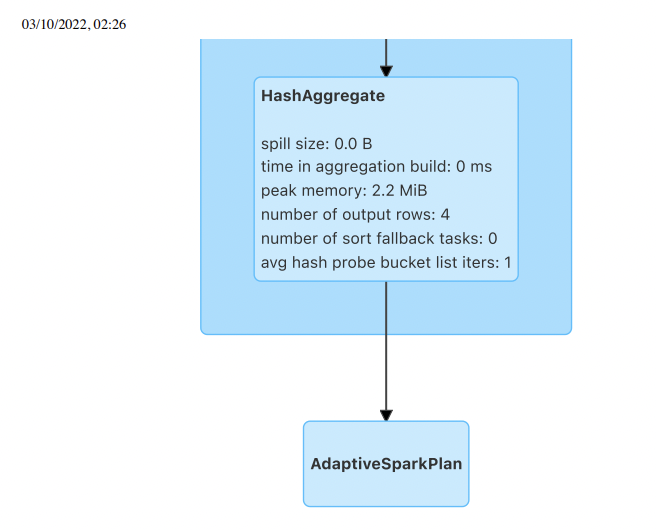

In [115]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAApAAAAISCAYAAAB7zf+DAAAMQGlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSIaEEEJASehMEpASQEkILIL0INkISIJQYA0HFXhYVXLtYwIauiih2QOyIYmFR7H1BREVZFwt25U0K6LqvfG++b+78958z/zlz7sy9dwDQOMWTSHJRTQDyxAXSuNBA5uiUVCbpCaAAOiADZwB4/HwJOyYmEsAy0P69vLsJEHl7zVGu9c/+/1q0BMJ8PgBIDMTpgnx+HsSHAMAr+BJpAQBEOW8xuUAix7ACHSkMEOKFcpypxBVynK7E+xQ2CXEciJsAIKvzeNJMAOhXIM8s5GdCDXovxM5igUgMgAYTYr+8vIkCiNMgtoU2Eojl+qz0H3Qy/6aZPqjJ42UOYuVcFIUcJMqX5PKm/p/p+N8lL1c24MMaVvUsaVicfM4wb7dzJkbIsTrEPeL0qGiItSH+IBIo7CFGqVmysESlPWrEz+fAnAE9iJ0FvKAIiI0gDhHnRkWq+PQMUQgXYrhC0CmiAm4CxPoQLxTmB8erbDZLJ8apfKG1GVIOW8Wf50kVfuW+HspyEtkq/ddZQq5KH6MXZSUkQ0yF2LJQlBQFMR1ip/yc+AiVzciiLE7UgI1UFieP3xLiOKE4NFCpjxVmSEPiVPYlefkD88U2Z4m4USp8oCArIUyZH6yJz1PED+eCXRGK2YkDOsL80ZEDcxEIg4KVc8eeCcWJ8SqdD5KCwDjlWJwqyY1R2ePmwtxQOW8OsVt+YbxqLJ5UABekUh/PkBTEJCjjxIuyeeExynjwZSAScEAQYAIZrOlgIsgGotaeuh54p+wJATwgBZlACBxVzMCIZEWPGF7jQRH4EyIhyB8cF6joFYJCyH8dZJVXR5Ch6C1UjMgBTyDOAxEgF97LFKPEg96SwGPIiP7hnQcrH8abC6u8/9/zA+x3hg2ZSBUjG/DI1BiwJAYTg4hhxBCiHW6I++E+eCS8BsDqirNwr4F5fLcnPCG0ER4RbhDaCXcmiOZKf4pyFGiH+iGqXKT/mAvcGmq644G4L1SHyrgebggccTfoh437Q8/ukOWo4pZnhfmT9t9m8MPTUNlRnCkoZQglgGL780i6Pd19UEWe6x/zo4w1fTDfnMGen/1zfsi+ALYRP1tiC7GDWDN2GruAHcPqABM7idVjLdhxOR5cXY8Vq2vAW5winhyoI/qHv4EnK89kvnO1c7fzF2VfgXCK/B0NOBMlU6WizKwCJht+EYRMrpjvNIzp6uzqCoD8+6J8fb2JVXw3EL2W79y8PwDwPdnf33/0Oxd+EoD9nnD7H/nO2bLgp0MNgPNH+DJpoZLD5RcCfEtowJ1mAEyABbCF83EFHsAHBIBgEA6iQQJIAeNh9FlwnUvBZDAdzAHFoBQsA6vBerAJbAU7wR5wANSBY+A0OAcugSvgBrgHV08XeAF6wTvwGUEQEkJDGIgBYopYIQ6IK8JC/JBgJBKJQ1KQNCQTESMyZDoyDylFViDrkS1IFbIfOYKcRi4gbcgdpAPpRl4jn1AMVUd1UGPUGh2OslA2GoEmoOPQTHQSWoTOR5ega9FKdDdai55GL6E30Hb0BdqHAUwN08PMMEeMhXGwaCwVy8Ck2EysBCvDKrEarAE+52tYO9aDfcSJOANn4o5wBYfhiTgfn4TPxBfj6/GdeC3ehF/DO/Be/BuBRjAiOBC8CVzCaEImYTKhmFBG2E44TDgL91IX4R2RSNQj2hA94V5MIWYTpxEXEzcQ9xJPEduIncQ+EolkQHIg+ZKiSTxSAamYtI60m3SSdJXURfpAViObkl3JIeRUspg8l1xG3kU+Qb5Kfkr+TNGkWFG8KdEUAWUqZSllG6WBcpnSRflM1aLaUH2pCdRs6hzqWmoN9Sz1PvWNmpqauZqXWqyaSG222lq1fWrn1TrUPqprq9urc9THqsvUl6jvUD+lfkf9DY1Gs6YF0FJpBbQltCraGdpD2gc6g+5E59IF9Fn0cnot/Sr9pQZFw0qDrTFeo0ijTOOgxmWNHk2KprUmR5OnOVOzXPOI5i3NPi2GlotWtFae1mKtXVoXtJ5pk7SttYO1Bdrztbdqn9HuZGAMCwaHwWfMY2xjnGV06RB1bHS4Otk6pTp7dFp1enW1dd10k3Sn6JbrHtdt18P0rPW4erl6S/UO6N3U+zTEeAh7iHDIoiE1Q64Oea8/VD9AX6hfor9X/4b+JwOmQbBBjsFygzqDB4a4ob1hrOFkw42GZw17huoM9RnKH1oy9MDQu0aokb1RnNE0o61GLUZ9xibGocYS43XGZ4x7TPRMAkyyTVaZnDDpNmWY+pmKTFeZnjR9ztRlspm5zLXMJmavmZFZmJnMbItZq9lncxvzRPO55nvNH1hQLVgWGRarLBotei1NLUdZTrestrxrRbFiWWVZrbFqtnpvbWOdbL3Aus76mY2+DdemyKba5r4tzdbfdpJtpe11O6Idyy7HboPdFXvU3t0+y77c/rID6uDhIHLY4NA2jDDMa5h4WOWwW47qjmzHQsdqxw4nPadIp7lOdU4vh1sOTx2+fHjz8G/O7s65ztuc77lou4S7zHVpcHntau/Kdy13vT6CNiJkxKwR9SNeuTm4Cd02ut12Z7iPcl/g3uj+1cPTQ+pR49HtaemZ5lnheYulw4phLWad9yJ4BXrN8jrm9dHbw7vA+4D3Xz6OPjk+u3yejbQZKRy5bWSnr7kvz3eLb7sf0y/Nb7Nfu7+ZP8+/0v9RgEWAIGB7wFO2HTubvZv9MtA5UBp4OPA9x5szg3MqCAsKDSoJag3WDk4MXh/8MMQ8JDOkOqQ31D10WuipMEJYRNjysFtcYy6fW8XtDfcMnxHeFKEeER+xPuJRpH2kNLJhFDoqfNTKUfejrKLEUXXRIJobvTL6QYxNzKSYo7HE2JjY8tgncS5x0+Oa4xnxE+J3xb9LCExYmnAv0TZRltiYpJE0Nqkq6X1yUPKK5PbRw0fPGH0pxTBFlFKfSkpNSt2e2jcmeMzqMV1j3ccWj705zmbclHEXxhuOzx1/fILGBN6Eg2mEtOS0XWlfeNG8Sl5fOje9Ir2Xz+Gv4b8QBAhWCbqFvsIVwqcZvhkrMp5l+mauzOzO8s8qy+oRcUTrRa+yw7I3Zb/Pic7ZkdOfm5y7N4+cl5Z3RKwtzhE3TTSZOGVim8RBUixpn+Q9afWkXmmEdHs+kj8uv75AB/7It8hsZb/IOgr9CssLP0xOmnxwitYU8ZSWqfZTF019WhRS9Ns0fBp/WuN0s+lzpnfMYM/YMhOZmT6zcZbFrPmzumaHzt45hzonZ87vc53nrpj7dl7yvIb5xvNnz+/8JfSX6mJ6sbT41gKfBZsW4gtFC1sXjVi0btG3EkHJxVLn0rLSL4v5iy/+6vLr2l/7l2QsaV3qsXTjMuIy8bKby/2X71yhtaJoRefKUStrVzFXlax6u3rC6gtlbmWb1lDXyNa0r41cW7/Oct2ydV/WZ62/UR5YvrfCqGJRxfsNgg1XNwZsrNlkvKl006fNos23t4Ruqa20rizbStxauPXJtqRtzb+xfqvabri9dPvXHeId7TvjdjZVeVZV7TLatbQarZZVd+8eu/vKnqA99TWONVv26u0t3Qf2yfY935+2/+aBiAONB1kHaw5ZHao4zDhcUovUTq3trcuqa69PqW87En6kscGn4fBRp6M7jpkdKz+ue3zpCeqJ+Sf6Txad7DslOdVzOvN0Z+OExntnRp+53hTb1Ho24uz5cyHnzjSzm0+e9z1/7IL3hSMXWRfrLnlcqm1xbzn8u/vvh1s9Wmsve16uv+J1paFtZNuJq/5XT18LunbuOvf6pRtRN9puJt68fWvsrfbbgtvP7uTeeXW38O7ne7PvE+6XPNB8UPbQ6GHlH3Z/7G33aD/eEdTR8ij+0b1OfueLx/mPv3TNf0J7UvbU9GnVM9dnx7pDuq88H/O864Xkxeee4j+1/qx4afvy0F8Bf7X0ju7teiV91f968RuDNzveur1t7Ivpe/gu793n9yUfDD7s/Mj62Pwp+dPTz5O/kL6s/Wr3teFbxLf7/Xn9/RKelKf4FcBgRTMyAHi9AwBaCgAMeD6jjlGe/xQFUZ5ZFQj8J6w8IyqKBwA18P89tgf+3dwCYN82ePyC+hpjAYihAZDgBdARIwbrwFlNca6UFyI8B2wO/pqelw7+TVGeOX+I++cWyFXdwM/tvwAqF3xMpRA8mwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAApCgAwAEAAAAAQAAAhIAAAAAQVNDSUkAAABTY3JlZW5zaG90RJqCowAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAdZpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTMwPC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjY1NjwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlVzZXJDb21tZW50PlNjcmVlbnNob3Q8L2V4aWY6VXNlckNvbW1lbnQ+CiAgICAgIDwvcmRmOkRlc2NyaXB0aW9uPgogICA8L3JkZjpSREY+CjwveDp4bXBtZXRhPgqwpjJ7AAAAHGlET1QAAAACAAAAAAAAAQkAAAAoAAABCQAAAQkAAX+mphTgSwAAQABJREFUeAHsXQeAF8XVnwMsoCJgV0xsYI3GrtgTo4nG2GLsJVGjJvZIs4CAvUTFREmssX32aCyxYMGGPRYs2AAVrFjhaHc33yvz3rzZ3f8Bx4GCs8q+9pt5O2/fzM7Nln+dh81VbKiss3pQeFCIDkvVBYGxpoSwRL3zUErKcZUCsA5SvoQARfaf4y95lPMv9788/tjR1IyYwhLN42++/uTrr1w3bI9JZxypJF1ItaDI84/y/KNOJpClYcZeoTWKkSnhowk4Cb/QYBRRqOKwRKGbZ/9xhpDEloVSvBKMBFhojj9FQMIhNOcfhIWH1lI+5f6X+5/M0JOxhYVSviQY6WBCg1FEobn/QWBy/8PsKOVTHn/mivGnzjfBmUqn56Zbw4lFcxhItN+H8cCSkq2gKIhUlHQVBqvK/nP8c/7JRUYuN7bnMW/7TOxcEVeyg4l0FQaryv0v97/c/3L/w5HEjgtxZGGuZCsoCiIVIl2Fwary+PP9Hn90BbI6DZJTCZBmZppcAey5jO7tuq9gav51Yf0h2MqWDxVVqKQMm2Cf/ZdOG/xVUOOvm2JArWz5HH+KQEVIcv5xUHSf+1/uf4XLRh5/oHdUru4WBxQrWz6Pv3n8hQhUpIQo2QT72Tz+0gTSzvL5APD0hF5PR6KHQ+dNxoOoTTUEsjsEYmsrOw1YzCpn9k/Bgnjl+FMKUZLRjvoL6tJsYxthq3tUSCnA5fzjMBX2uf/Fv/Lz+IP9Cbc8/lAYaHjhMaYQmTDasI2wefyJecMBiWHB2OTx10ZF+bl6/IWDx8cP4ORyR1AWmydXam1qbQbL4UZFEoH1dl8yq9O6eChamS1Zm0/qTIRymZI5+8/nP+c/dJTc/3QowGEjj3/lwbOGJhlTE6FcoGTWoOf801Bg2HL+lZOnhibJqUQoFyiZNeg5/zQUGLYZyL86eAQSFznNRlUE2YQ6qK0VQSzXMEqtYPZwgY7vgkktpUdntUYuijjc4AhruGB1DSMXprLZf45/zj/p6aG/QKeyWcHdRWwoIY9b7n95/EnSgLICd5wtIWds6iiCQXn8tT1NApX7n40Kp4zEBiXkccvjz/d1/IFb2E1wlszMW64xfOZob0+pUc8wm5Q3OcEVsJX2CTBWX0MdAdPhkvIo4KbtZCvtEyDDcF9DHQHT4ZLyKOCW/XMc7CUoCVQwA6mhjoDpcEn5HH+OVs6/kDWcHbRPEiUmVQ11BEyHS8qjgFuOP8ch939KBsqRJFFCeIDUUEfAdLikPAq45fzjOOT8o2SgHEkSJYQHSA01AeJLNM2h5KULwFQ9kxldlblYbdVfWwYfgUYZ2OwfOjz0+Bz/nH+QBjr2l3tKSRO7Ve5/5dUOE64YKKMMbB5/8viTx998/cnX39L1t+IWth00ka++XDU33tKUNVRTXTyUbu6E0KCd/ef45/yTrmRp7n+1egZECYMjW2X65PGHopfH39IFUdKG3xRHqTKBml2VyfmnUawRvtz/5pX+p7ew6ZSH82pOf6GjxBNP/aoCz2XZIGahWm+iMIJhBZuqgiRKoQJWygYxCy2Yg2ishhVsqgqSKIUKWCkbxCy0YA6isRpWsKkqSKIUKmClbBCz0II5iMZqWMGmqiCJUqiAlbJBzEIL5iAaq2EFm6qCJEqhAlbKBjELLZiDaKyGFWyqCpIohQpYKRvELLRgDqKxGlawqSpIohQqYKVsELPQgjmIxmpYwaaqIIlSqICVskHMQgvmIBqrYQWbqoIkSqECVsoGMQstmINorIYVbKoKkiiFClgpG8QstGAOorEaVrCpKkiiFCpgpWwQs9CCOYjGaljBpqogiVKogJWyQcxCC+YgGqthBZuqgiRKoQJWygYxCy2Yg2ishhVsqgqSKIUKWCkbxCy0YA6isRpWsKkqSKIUKmClbBCz0II5iMZqWMGmqiCJUqiAlbJBzEIL5iAaq2EFm6qCJEqhAlbKBjELLZiDaKyGFWyqCpIohQpYKRvELLRgDqKxGlawqSpIohQqYKVsELPQgjmIxmpYwaaqIIkSaFyBNMoaf3RJnWFSKQVUrUzZUtREWTlhhGptZYYhtYFlS1ETZeWEEVp2qxqG1AaWLUVNlJUTRqh6KzMMqQ0sW4qaKCsnjNCyW9UwpDawbClqoqycMELVW5lhSG1g2VLURFk5YYSW3aqGIbWBZUtRE2XlhBGq3soMQ2oDy5aiJsrKCSO07FY1DKkNLFuKmigrJ4xQ9VZmGFIbWLYUNVFWThihZbeqYUhtYNlS1ERZOWGEqrcyw5DawLKlqImycsIILbtVDUNqA8uWoibKygkjVL2VGYbUBpYtRU2UlRNGaNmtahhSG1i2FDVRVk4YoeqtzDCkNrBsKWqirJwwQstuVcOQ2sCypaiJsnLCCFVvZYYhtYFlS1ETZeWEEVp2qxqG1AaWLUVNlJUTRqh6KzMMqQ0sW4qaKCsnjNCyW9UwhPfxGciCOd4HwiV8AMvDj8aBYRnT/LIkedAyxKik3tlv8Ena7D/HH/Ik5x/fDjJdxrC5/+m9kjQqZmAhVq3EqGRgokOKWx5/8vgDuZDHH+0KssAkPYX7iUhCWVvcq5UYlQxMdEhxy/3ve93/+KcM5aTxKavaVyNEKzQtGT+QWXiAH+DSH3ncry5va6tGiFaoLQE+4DlK/hmu7D95gQDClePPQ1POP+gz4RuYae9JpRo9DAvDvxrW3P/y+EMfj87jbx5/40fUcLjI15954/pDK5DJ8K+CMumVpEISpL6sCIrko/MCqCiLqsSsgjI1SkW1ILN/jrvEQSMkAVJFyiRmFZRJwRWSIMWvUIUKQBUpk5hVUCYFV0iCFL9CFSoAVaRMYlZBmRRcIQlS/ApVqABUkTKJWQVlUnCFJEjxK1ShAlBFyiRmFZRJwRWSIMWvUIUKQBUpk5hVUCYFV0iCFL9CFSoAVaRMYlZBmRRcIQlS/ApVqABUkTKJWQVlUnCFJEjxK1ShAlBFyiRmFZRJwRWSIMWvUIUKQBUpk5hVUCYFV0iCFL9CFSoAVaRMYlZBmRRcIQlS/ApVqABUkTKJWQVlUnCFJEjxK1ShAlBFyiRmFZRJwRWSIMWvUIUKQBUpk5hVUCYFV0iCFL9CFSoAVaRMYlZBmRRcIQlS/ApVqABUkTKJWQVlUnCFJEjxK1ShAlBFyiRmFZRJwQWpdAubi6WFE13p6Ao1lsRYF3Gw078+SliZTMYyCGEp6LL/wuy8IoiJKsaSONjl+Ie//pI4scDRijFDbaLL+ZfzL/nruCKJElXMJeJgl/tf7n+4bl+1JWNNACS6PP7k8ed7NP4UJpCcqpS3yiqTqkGSXCZECgupL6RZo4CwRvgXupayyhDOStk/9yWKiQ2MiSizzRoN2uCUVSbHHyJgo5HzL+cfjuWUEzYxTI9itlmjQRucssoQzko5/3L+5fzL/Y/GBDswmBFlto8/8JwgutbNHoflFaAMW5vHKDhdxQE1lasobFWWjzUJx9bmMYKVC39EExdFBVqV5RWgDFubxyg4tx9CEX7viIJCcasInlVZPkZSOLY2jxFsPv/FaJFcETyrsnyMpHBsbR4j2Bz/YrRIrgieVVk+RlI4tjaPEWyOfzFaJFcEz6osHyMpHFubxwg2x78YLZIrgmdVlo+RFI6tzWMEm+NfjBbJFcGzKsvHSArHVl2BrA2WB6ANQlllpNZAa+nRLDahXCSVQjVEsn9+ANtESFllbMCAr6VHmNiEctFUYp1Ysn98ANxESFllbMCAr6VHmNiEctFUYp1Ycvxz/HP+mR6irDK2wwBfS48wsQnloqnEOrHk/pf7X+5/pocoCz1Dfgtbu4wx4ppRc5tCCSQTvVACjN++fZc7d8gjzi3s3MS6jd2Rffd0KyzAtx3qP3jUXfzXq9zjL7/vOq57kBsw6ADXrYPcD4JuPuUpN6jfu+6IM/Z3S7QF+du33C1/v8xN2GqA+8OmHYJH5ya8xT48+mi7kTuq115uxfZg1oOb4u4/81Q3bb+BbsclP3K3X3i2u+r+EW5Kp3XdwSee4vbaoAuAIT2mvONuPOdS98KUhVzThDq37RE93Q6rQqW4TR7jbh98trvyvhFucqf13CFUbrHgYop7879/d2cPuce98+2ibst9+7g+B2/kFlH/WAEI4cEnue3k3BT3yh1/dVc9NsEt5Ca6RXoc6o777Zpu/lBuwuj73QVnDHEPv/G1W2aDvdxJ/Q5xa3Zug5XpJi4mjHrAXXDmJe6hN79xy66/tzux38FurU6A1dPn3aRxz7obbnjYfdNxZbflr3Zz6y/fLtQjtRTFgl69RiZFlM+/9V9uv9ST1hLPW0EvcENTRPbPF7oQoCQ4IJTyTwKZAE2/KegFbmiKyPHP8U/ftM39XzpL7n95/IGLMU5vIBXSRxjTUXRuu/7hp27C1iQM0Sb8vk+BC4pIBBI1oYT3Uz+71++7xvr+3Ce/gZqm+KfO+JXf9OBb/VdNTb7h6yf94LNu9u9NaPKTP3rE/2njZfyv+j/rG0w94x/u6/cf+ALomvw3ox73l5++t19hgaV977u/VtS0T6MPH3z0AB9fNCrE+0mP+SN2P9W/Pflzf+NxO/v9+57vL724n9957SV9+2V283d/ONX7xs/99X9c32/Xe5ifBEW/eeV8v8laB/mHP4UjahxP5fbrc4G/dHA/v8s6S8RyTY3+g3v6+B1+29sPHjLY995rfb9wu6X9EdeN9vYQJExMcd/oR995jF99/Z7+JYhB0+QRvu9W6/jed3xE5aaOf9AftsPuvt8FQ/xfT9nHr9p5fr/mHv/yeDjJBlVNHf+AP3yHPQB7qb/glH39ap3m92vscZXB1vunrzzCb7LpQf721zF28SiSuvR8s3ZWz7+tmz2mnkUXcakm+5d4xEjEWAVOIAVDUS0yU7u3BQXFuug1chZNfFpEzUW1yEztXosAIyjWRa+Rs2ji0yJqLqpFZmr3WgQYQbEueo2cRROfFlFzUS0yU7vXIsAIinXRa+Qsmvi0iJqLapGZ2r0WAUZQrIteI2fRxKdF1FxUi8zU7rUIMIJiXfQaOYsmPi2i5qJaZKZ2r0WAERTrotfIWTTxaRE1F9UiM7V7LQKMoFgXvUbOoolPi6i5qBaZqd1rEWAExbroNXIWTXxaRM1FtchM7V6LACMo1kWvkbNo4tMiai6qRWZq91oEGEGxLnqNnEUTnxZRc1EtMlO71yLACIp10WvkLJr4tIiai2qRmdq9FgFGUKyLXiNn0cRDEZpAwpwuyKaSEssK2hsbOY4VBB+N/rmzt/PLbHSqf28qgyeP+Yfv0WUj/48Rk/2kd0f4d76VSqb5xwf8zK9zwK1+sjZiir/rL7/zf3sRp3PctKaJd/hdluzqe931TWhrA/jYPvjg6drk0eJjSjiOJv/lIyf7/U591tePu8WfM+RVndhNem+I37RjJ3/E9V/6ia9f5NdbdCM/5DX255s+8Kf9vKvf+fSX/KRxN/uzh4yAI+PjrX/vH37TRTr7I274EuaBH/mrzrrEj5oapovTRvvTtl3Od9/9GpqIcmzCoVjS8JY/efNl/U6nvUzH0wTxGzF4F7/sxgP8u9Ma/Ds3nOdveG1yKNHgXx68s1+o487+fogZHYWEDkq/fcO5gJXjbvCvALZDx139fd/iMU3zr11zoF9u8a39VSMCxh5H4OPp04pDjBnAWrM3MG5jUCR6LAuKki44NST752BIjpFk4sas2Rtbjj8EIyaQySpk0VZQVYixuAGXWFbQ3thy/CEYMYCF6KKtoKoQY3EDLrGsoL2x5fhDMGIAC9FFW0FVIcbiBlxiWUF7Y8vxh2DEABaii7aCqkKMxQ24xLKC9sb2XcffrEAWWpYcJNqsojiRsWXBBhOrc3/Z1f9k/1tgXZDLNk1+xO+/Umf/u7++AzWZuhpG+XN229qfPvQzraRp8tP+6F1P9K/B4qBsjRPv9L+BCWTvu3gVDX2csz34OFB8wBFOftgfsGInv8cF6AO2pin+3t57+QufqfeN3473X0wGLRsIu/+Ky/ued37h3xqyu194yX39oxPDRNBP9bce/hPfdevz/divP/fjJ2EhKhjKdfUn3AnH0TTBfza+Xg4R6BR/2xFr+3UOug1q0CKWoWqmjrvCb9FxSf+Xf8fV1C8ePN4v22FLf+3oqf6bz8f7MO/GWvz4B473XZfdLxzfVD/yoev9XS9+Rnn7zfjPQ4wJ6r984Di/3LL7+8egLVM/vcPv2nVhv9VxD/px773qn3v1fV9Pq5jcFi5RY1+CWMV0zr9UqUWU0fgLpCY1RRhjFdk/RcOGRANpepfalcnxrx04jSAxJmQ5/zACNiC5/9VOo9z/NFPKTB5/aicODzOy19hVKb4//c9MIPmI7XErr0xFY8jGANzTvynP+iN/0sVvfvSDPJECfePU5/1Ray/mexw9NOga/Uev3OpP2HFN333rk/0zH8lUE24hP3Gq3/fkx2H9LGxQadPE//idl+rq+8gEcupz/ijwsdlRWB/7b5zyvD8SfGwmPqY87Y/dra8fMS12akbCne1R//Bbrnmof+rrKX5o3x6+0yp/9s/Doh/bp/qhJ23mO65ypKdFUCkEhzN51BC/5eqH+Ke+CZNNsjGgqWGMH/SLdfwp942PB17gEPn10wP8Kgt286cNmxCs0OZnQNd+ZT/o0ajjWhv9iIt29psdfrefiGhYvTxly2X8T39/K8fR+ocb/q/ASqZg3792f79Q2y5+h8NP9af2/4vfZd1l/YpbnOifHq+RVf/ScvbJauWVEbhREMsy7o0lkUQvVGqKlC3WrrwygjYKYlnGvbEkkuiFSk2RssXalVdG0EZBLMu4N5ZEEr1QqSlStli78soI2iiIZRn3xpJIohcqNUXKFmtXXhlBGwWxLOPeWBJJ9EKlpkjZYu3KKyNooyCWZdwbSyKJXqjUFClbrF15ZQRtFMSyjHtjSSTRC5WaImWLtSuvjKCNgliWcW8siSR6oVJTpGyxduWVEbRREMsy7o0lkUQvVGqKlC3WrrwygjYKYlnGvbEkkuiFSk2RssXalVdG0EZBLMu4N5ZEEr1QqSlStli78soI2iiIZRn3xpJIohcqNUXKFmtXXhlBGwWxLOPeWBJJ9EKlpkjZYu3KKyNooyCWZdwbSyKJXqjUFClbrF15ZQRtFMSyjHtjSSTRC5WaImWLtSuvjKCNgliWcW8siSR6oVJTpGyxduWVEXRU8C3ssp41srYKkhZRRgoFavRNU57zf1qji9/qL8PCZBHKT33FH7/+4n7TP98PK2YInuI/fe81//jdf/f7rL+0X3aj/v6NKaif6h84aS9/zhMwkTL+G3ACiSuQ/+FVO/KxJvp4NE6kpqGPJcDHAx6r+nr4IL9Pb2PXVnzj7+m7l+9/11jQTPX3997Ed171OP8SrTRie6b5Yf238ouucLh/rp4bxvtv/T19oNzdY/VWOKJpA8Cnwwb4PY++03+Bq3xcIBhFZuXXw/v5ldp392c9zpNF1E548Uy/RvsV/YCHvjVlmnzjN0/643Y/yj/6cZj0AbhhwjdhJTFC0V/TN08RdtjHcABN0/yj/bb0i/zoUP80tgH+n/LRjX6HZRb2Ow7AZ0thA50hKrMW9ib+AVrGCFgBQVEpizLQlJTrzv4lunKqyjEShIS2WVlAaeBFG53IOVRLNEWVeGJa1FfKogw0JeW25fOvMZbIxROhphx/jIAGKMSlUhZloCmpqEPwxhRVwVFz/gyEyknhQFNinEidgjemqDKVA1vUV8qiDDQlFXUI3piiKvu3ESjGpVIWZaApMUEOFc8F419cgTQHWxUXabq1CR9tgYPb0gO2XsZvdPi9enu1EVYDD1t9Mb/Lma+ZXGd8/ciL/YYd1/OXvApLgFNe8CfsdoJ/MTwCKHXTBFJXIMEz+ViWfMjTgk1ThvvDYOK6y5mvg4+p/qF+e/mzHouTNHbc6Efdc7rv+8//hYlso3/przv6jsuHiRY1aqr/7wkb+2U2Pc2PhtVL3GAq50fde7o/kcqRSneImPLx/f6kYy+Fl3XkiNVMDGmDafK7f/cbLfxj3+8BeJ4zbF89fpJfqcMm/oqR0howNH7ib4aVw/97dYKJmZSIlKoF7C39jycsW6b54af93C+xdh//pqzANn3pB+/8I7/aHtfGZzSlmtY8/1Knobb9UR0CgorsP4bFcBIhocakbLRFTo2BIUvJbBQ5/sWQkSwREloFirbIFXFkKZmNIse/GLIcf4iAZIjQqiBFW+SKOLKUzEaR868YMpIlQkKrQNEWuSKOLCWzUcyl8Y8TSNti064kihZTw8BFYVWv1yZ+xR0ugbeuuVDjhDv8Tkut6s/AVTfQxZvKwE96wO/TfXt/E7wR/e3zZ/m94Jk9eQ1G3MgtbH4GErXTwMfG5OPr4KPp2zv9r4OPpmn/8712P84/H1YQ+Si8//KVa/zAi4b5r7VrNvqvn+rnV+64vb9NXnOGZxsv37ub3+K4R3R186uXodzFw3yc8qFTdtw08TU/pP9g/+IXsVXyNKX4tbRp8rP+8LUW9wf94yNVf3zLwX7J7sf4l3D+SNXi29MD/ZVPwLOhoX1KtZQYJhH2KsCKBpdIP7vvWL/sknv6oXK73df7q/bt5jc54n7zwpJWFhmtJKiKsiLLhrJGwZEBUIxUVCtXrKQo1wTGUCmkisn+c/xjTylnSDHfirKWKBvKGgVHBkA5/5uJVNFUlDWSZUNZo+DIACjHv5lIFU1FWSNZNpQ1Co4MgHL8m4lU0VSUNZJlQ1mj4MgAqLXin04gqeLop9aqkCLM0TIbFfVvDvFbrPhrf9sH8DoJqD+DF0HW/fnZ/j1YDZvy0f/8w0+PhkkMb18+c6bf55i7/ddw2/WxgXv5gUPDbVwzK6eXaJaAW9jmMz71b4CPlcDH+9PQhf8UfKz3s3P8qIYmP+Gls+F28n06AcSDqB99hz/55Cv9C2+95999913/zjsv+ZsuvMy/+O1If8Z2a/iD/zmKbu02TnjYH7jOz/zV4e3m+lF3+lOw3Nvv+nffg39vv+RvhnL/mwinYdoYf13/fv7GZ96COt/x7737tn/mjov9tU9AG+AzP+Neut/f/+yHUC8eYThtoH8BnlVca+ch4XM7E/1tf+rh9zzvFb61DJPj128b5E+/6kn/zrt8rCP/9x9/0eWPwcR6oh9+zSA/+D/v+EYKN2BvHeQHXf0UYNH/u37kS4ydBJ8H6r/Nmv7P134A80nwDY8WHLXRxv6C4fQ0JR1ROAVMoD6qUpQm/qJKqAEzaxQIFJEo7qT9XIuYWWJ8osv+NTSVjAkWs0aBBUQkirscfw2FCQ+GijYwkl3lRBJtpMbMrFEgSkSiuMvx11CY8GCoaAMj2VVOJNFGaszMGgWiRCSKuxx/DYUJD4aKNjCSXeVEEm2kxsysUSBKRKK4y/HXUJjwYKhoAyPZVU4k0UZqzMwaBaJEJIq71o8/TyDFUTw09c0qAzCsgVewDf7te0/z++3zZ9//9FP9MYef7IfCG8a4fTFsoP/pkkv4DXfp6S+95v/8Ndc/7D/C26zT4HuIux3ph+PEzNQ45ROYsP11P7/8Ah38tkde7YeN+BQX2GBjH/smPnDtcpp/8rS9/an3x+cJp3061B+67pL4OWX8cmeg7fw2vR6nN54nf3i/773fvv7YU07zpxx7hD/rznfJx1Qod8h6izOeP0cP5UO5xs/8rcf28AsGvdTdaY2/+BF4Kxteqjlvp5X8gh238de9a14pp0Mf62895SB/wJ9P9qfBrecj+93ux0EM8BuRY+7r41dbuC0dJx4rfIDU17Vb3Z/zNKzeTnvPn/Prbn6DP9ziJwTs6gEr/hF77nC+dT/148f8qYcd4nv2H+T7HX+EH3DDiLi6K0EWiscVtlRlJMMKtsVU6hJqKkpVRjKsgbeMlbqEmlpSlZEMa+AtY6UuoaaWVGUkwxp4y1ipS6ipJVUZybAG3jJW6hJqaklVRjKsgbeMlbqEmlpSlZEMa+AtY6UuoaaWVGUkwxp4y1ipS6ipJVUZybAG3jJW6hJqaklVRjKsgbeMlbqEmlpSlZEMa+AtY6UuoaaWVGUkwxp4y1ipS6ipJVUZybAG3jJW6hJqaklVRjKsgbeMlbqEmlpSlZEMa+AtY6UuoaaWVGUkwxp4y1ipS6ipJVUZybAI158ylG/mMy18HR2VFSrCkt4YlVVGi0ZN7ermPf9T3INnnOam/qGf22Hp+fTHGWwsuM12X2GtUOX4QwQoLiY4yirzA8+/2NdiRKLOZl3kLTJoK1RkIb0xKqtMjj8ECv640zhg3GJ0UCpuFdYKFZUivTEqq4z6iprs38aiGP3K6NQqQHpjVFaZHH8IcM7/NKtidpSzL0UGe60CpDdGZZWZrflHP2UI80j9eZ3oNjZMdELRIrzQiC5yFmF5weHHzOdV/959MPwGN2zi5m6fbX/s2mjUpO1I5+X2c/t4+CjyKOOW2z/v5j+f33z+8fJZjEVQ5fyfh8f/4jn/oV3/cvvjTKkYi3mj/5sVyJDcRGyiW32tIEgwpk+1ZmDwvrAMrRpoAigKKgy8qpSZvrMKhJYGJvvP8c/5J50k9Awi2kty/8vjD+QA9BJNCWUkcWaKamlg8vibx988/kr3CT2DiPYSMFo9Yq1Nys441dLAtEb/MxPI9CDUkagLDu2PgjPWlBCWKKwwwQAUEwUrFIBUXqYlBChsg7N/GHxCUDlWJmLCEs3xz/mX+18ef+wYKwOE1aV8CQGKPP7GCV++/uTrT77+Qg7gg5A4dJSmGbaHpGMLSSV8gpHhR2gwiijUTCRL9WX/sYcmsWWhFK8EIwEWmuNPEZBwCM35B2HhqVUpn3L/y/1PrpDJ2MJCKV8SjHQwocEootDc/yAwuf9hdpTyKY8/c8X4U4evOxeWB023hhOL5jCQaL8P44ElJVtBURCpKOkqDFaV/ef45/yTi4xcbmzPY972mdi5Iq5kBxPpKgxWlftf7n+5/+X+hyOJHRfiyMJcyVZQFEQqRLoKg1Xl8ef7Pf7oCmR1GiSnEiDckRgLe2suKNkEe3vfQzA1/7ooVmhly4eKKlRyUGyCffZfOm3wV0GNv26KAbWy5XP8KQIVIcn5x0HRfe5/uf8VLht5/IHeUbm6WxxQrGz5PP7m8RciUJESomQT7Gfz+EsTSDvL5wPA0xN6PR2JHg6dNxkPojbVEMjuEIitrew0YDGrnNk/BQvileNPKURJRjvqL6hLs41thK3uUSGlAJfzj8NU2Of+F//Kz+MP9ifc8vhDYaDhhceYQmTCaMM2wubxJ+YNBySGBWOTx18bFeXn6vEXDh4fP4CTyx1BWWyeXKm1qbUZLIcbFUkE1tt9yaxO+YvcdChamS1Zm0/qTIRymZI5+8/nP+c/dJTc/3QowGEjj3/lwbOGJhlTE6FcoGTWoOf801Bg2HL+lZOnhibJqUQoFyiZNeg5/zQUGLYZyL86/LB4iqMqQtRNqIPaWhHEcg1jqAVB8MlyOB7xJLWUHp3VGrko4nCDcjVcsLqGkQtT2ew/xz/nX+5/PCSE8QIGFdsrUhtKiMMtjz95/E3SgLICd/n6g70jX3/tGKHJIQyEZ16df8At7CZonpl5yzVGGq+dxChmkg3pxaVQwE39sJX2CZBhuK+hjoDpcEl5FHDL/jkOdghMAhXMQGqoI2A6XFJ+Lot/7+ENrvOCznVfFKafOI+Q45c2Yx6BLhDRKkV9E/xDihsudDaBVIcMKOn2BTBYbVgEJRyXQAzYCIq3WbP/HP+QHkIwsTiVKIdELRTN08u/mwce4caPHe32POUSt1jXlUJRqTjnX+5/OBrN3ePPpAbvHv+wyfVar51bedE2PLxSptPIWzH+Sg+i7oVDdYs39hCKo4CbVjh3+48v0SSt5DbqnnoQtBgwVc9kKq6CidVW/bVvCkSgUQY2+6eJRI7/nM+/Pk9Ngwmkd906tS3kf7jAQopy6oKMM0D8P7CYvWqDy7iHGSBNEkNaC6GaEAjjGpUHIrWTqjL/BWF8ZP8cvxx/zbMZyb+bBx7uxn842v2uP0wgl1sp5CznVc4/iEPufxXXn7lr/KlvaHSPjfU0gVwFJ5DFjTtKUcty5fmvhha1sdp5c/5TcQs7hICChjwmSnmLgSnbaAQSdWXxUBpIzQlp9h9CXxlAHeQlzAnF8MpWWTzHn4I7A/nX+6kG16U9rkDyD1FiOfxr3K7qSKiVavwh+GFZEctEdXCs/vEkgRAI1VPI/2jK/nP8Wzf/cAL5xdgwgVx2JU7jnH/cH8P1L/c//oNibh3/JjU0ucdwBXJ9XIHEswn/dPzllE/2hfxPbCBA0ZAZRUswihpdlbZQeh7wr7ewqY0VUUlVseF6sWsmQFJWqMYxURjBsIJNVUESpVABK2WDmIUWzEE0VsMKNlUFSZRCBayUDWIWWjAH0VgNK9hUFSRRChWwUjaIWWjBHERjNaxgU1WQRClUwErZIGahBXMQjdWwgk1VQRKlUAErZYOYhRbMQTRWwwq2F6xA4gSyG/3V6mGRECaSMLjQg8OAx9vKxQ1vT+OTxVgd/q0bJ5s8jazDwmigQQpQVBnKkcXhqQ3Ugw+YxC37z/Fv/fy7acARPIGEW9hdzC3snH+5/80r4w/fwvau5/pt3SodYfDVcRsH2CAYVsbcVBUkUQoVsFI2iFlowRxEYzWsYFNVkEQpVMBK2SBmoQVzEI3VsIJNVUESJdC4AmmUEk+ppEgZKgWKVroOFqooYqOsnDBCy9WqhiG1gWVLURNl5YQRqt7KDENqA8uWoibKygkjtOxWNQypDSxbipooKyeMUPVWZhhSG1i2FDVRVk4YoWW3qmFIbWDZUtREWTlhhAZvvWAFcnGYQK4Cf7WiSTaS6JZ0Hd6c5nzHcQhA9GIGrTyyXO4R0QlhuVBxtkl14vOSNNcETPYv0cchH6KR4w8L3LOefzcPPMx9gbewT4Vb2MuspNdTTOecf7n/zQvjT32Do2cge8IKJI7lkuQ6EgsjNA41JY4htYFlS1ETZeWEEVryGhUMqQ0sW4qaKCsnjNDorsQxhPfxGUiFSQ1IcZOrItDAEgWLIAmmUqplW9yrlRiVIiCpB9XZP89KcvwlFeZk/vEtbHgGsiM8A0mpCLs2MO2D1OWVRTwvIOCqJAB4molAApu85lxGVBsweSoc8j+BSp9AymXYGYAIB7vsP8cf0qO18u+mQXALGyeQ9BLNipB0lGicfshTsiMFFa2e5/zP/b/18i9Jt6rrfyvkXz29ROPdCbACSXeTaJiVsTakOhHRIcUt9AXM+8ASBYsgCaZSqmVb3KuVGJUiIKkH1d9z//xThlUNMW0CthohWqGFMnBR5Z/BkotrsANczgdXXF3e1laNEK1QWwJ8ZP85/nSPueX51zvcwsYHr7Erxw0luTkd8g9XxDCh8X8w4wcOMP9R10SrZVgaJLp1DXqqAjAwIfSe/85HJ3j7O05EsW6qEk1mo8IgI83+KQ45/pw3M5l/N592GLxE8777Xb+/01vYOf9y/5vXxp8Jjc498UET3MKeD25hQ+tg2KTxlIbOMH6a0bXIViNEKzQt9UOYf9AKZNJ8FZRJo1IhCTJcF+ECCCeHzk4AC6CiLKoSswrK1CgV1YIUv0IVIQBVpExiVkGZFFwhCVL8ClWoAFSRMolZBWVScIUkSPErVKECUEXKJGYVlEnBFZIgxa9QhQpAFSmTmFVQJgVXSIIUv0IVKgBVpExiVoEZnEAuRrewYYKHSY2Vw4Z7nvLhYMQrMvRFVfxrGf7n/MdOgDJQxIRyQBIe60IbbaEsTnlFq+Wyf4glxoWimuNPcZj1/LsRXqL5cmxYgYS3sCnNcv5BdLlX5v7H/W1uHv/qG5vcE/ASzQl0CxtH7rjFkRZ0KigTgTU4Qcp1R6jCBaCKlEnMKiiTgiskQYpfoQoVgCpSJjGroEwKLkilW9hcLC2c6EpHV6ixJMa6iIOdzv5LWDl/sQxCWAq67B/GNZ1uVESwqIqxJA52Of5yaSjGqpBrYO49HD/jUwe3PXDCCBdryj94kSFMCCk5sRo4JWHuGCulK0/t+KNZ1jCpEJxX+qsVK63DlyWAQKU0MQVk9p/jPzvyL76FfanrsuyKmOU5/3L/m6fGH7yFTW9h43cgOxXvJsUhm0dr3os20eX5B16UJDRwzaMRSWQTOGWVIZCVJJakswapTmmzRkXJ5Tt1lJa1UvbP55JiYgNjIspss0aDNjhllUlPC0g/hPj3fmoqvIWNE0hegaSb4RAS7ENNMPtDimuL0JFoSZJiYiIKCJDCNBFYnmQGBnEY3rDhhZvXKUGhYVeGnGX/vNqb4996+XdT+IzPnnALu8tyK3M2atopk/MPki73v7mz/9FLNGPNh8Rl0E2oyXVllSGklX4I1z9zIapufzqBTOE2WEmcTVXNY2IpxkU0cVFUoFVZXgHKsLV5jILD9TiiiYuiAq3K8gpQhq3NYxSc/UMoaGWDJlQhzyqCZ1WWj5EUjq3NYwQreR3RxEVRgVaFPH5IPE4gQYNK2HiqZ1qEE0mw4XSxuOETVfymNk01qQqsBh59pNVgKqT10nWa/IQ736xAu1nizP5jLCnmOf4tzj/7Eg1+xgcn55ikOf+4y4W/EnP/m4vHnwnwHcgnPmyE70DOR79EI8NpccAmfRjALR9UhrC1eUyEF9EkVxS2KsvHmoRja/MYwVJ3hqZGNHFRVKBVWV4ByrBVVyBrg0uXKjkaqKpWqVp69C42oXxEqcQ6sRQuFbEKrcvika9dW7SlmFSy9eX2/5DjjyuQndu3gQ+JY07AlRUvrk0wJcQJC0wL8SUZvsWMGYQbAYAgAHnQE2Ees6kNlUE8P0WJAMkyxIdSWBlsVAJ0cRUz+8/xb838u4l+ynCU27PfpfBLNCvm/KNeR50v9795ZPypn4af8Wnk70AuCl/UgHbxwMznOZVYJ5Yf8vWPrz+4BGIipCxERn4LW0NmjDbAajeMQkkXL4FBNMUBGR68k2XfWE1aSzzOgj4WUC5FZP+c6CE8SXBAyPGnfJzZ/JO3sPlD4umwk4QYB1q4qtNHwjGJgxEJPM3Ik0z4fg9+vgcv/gSgmWIAyqxRln3or30ChhPKJKBJsDzWl/3n+Lck/3AC+cXYUfAWNkwgl4Vb2Jh7Of+gS+X+lww+INgxx/Lf9/FnIk4gx8FnfNZtBz9La89r2orYwIK+GIhCLKj9MM3SmpPiIMyr1994CztpMV6OQjgiV4phWkTNRbXITO1eizRzOrJ/ORM2WsRLYAuGolpkG3nRxaKpJkY9chEbuLSImotqkZnavRYBRlCsi14jZ9HEp0XUXFSLzNTutQgwgmKdeOUVyDpYgQx/teIIgVDY4jWWlWJKa+LVRVxrxDVE/HUPPJ/xUylYE262FJaRTzjLb2iH2sUJlMj+IWoYDxq2MaocRRtJtGHEc/xr5x8/AxkmkPAWNscs5x9/Qjz3v+QPU+lkmCXQ0eaW/jcZXqIZBm9h996grVsZvumbjhHQmIJGxn/U5+uvmRhjqGSDINItbFmVSUJlIsys2RsbBZ5kyKxEj15AEWbe4rOKZv9wIih8JlVNLJk1e2PL8YdgUDxmT/7hCmRneIlmVbiFjdMQcoU7eoARs7nKv4yyaAOevhyOhXhDDhGy0WSSDh8v2sCgMaxUIhazog0osv8cf8od3LVi/t04AD7jM26M26Pf39zi+BJNzr/c/+ax8ad+WpP5JRr8czJuef7R8vmHPgMZwxm44lWOL51qpKlOCYNmMw1VuzJ0vaU/XWiUCtVVEVOEzVYRfFiV1pH96zRU46NMjj+FwsRD86bABAhPIB2sQOJKlvwlFvMPv/+N11vaoIxdO8SBiY3IIBAoDcxcnguFPVaCMNpAkFGN+hPXm/3n+HOutW7+0QrkuNFuT/wt7LACmfMPOiM9a4Kxzv2P1/Hn3v5X31DnHh8Lz0DCLexV6BY296Qw4JYJn3Sjt4rY/+LgL9BgQ1GLKDPPXX/NBJIbaZpa2X4Ok0ERG8uiPZ6aiBNOKNdj97EOKa9YZQRvFMSyjHvcpLw5g9oWU5LBuo91SHnFKiNgoyCWZdzjJuWz/xgn4YRypOyeLdauvDKCNwpiWcY9bq0Z/77wW9idF4SfMoRvh+GtnDYwsaNLCvDox/4kYeIfjNC5+EY08Hj7mm756PERACqgWqAu/LUamGRCGfz7GNVYXxtg6EtbKGf/Of6zIf9ugt/C/hKegdyj/xD6DmTOv9z/5rXxZwLcwsZfosEPicvz7DC8mi1eQ3BExo01liF1qiBQLIsIKW9q0Lq0TqlKaaxDyitWGQEbBbEs4x43KT8n/PMtbHFqjouOBAar8MS/BiAyhIi7UlmpNEDILqBAU2Lby4Wy/xx/WgUwqSEpFDMv5AqQ2HNMgQCkclI4TTzRlnIb8q/38Ab4jI9z+lOGAMbB1boiD6qUuoHSsaMMG9lpGokC/IMakPCcESSUsQzoZKuR/+pKcEhVKXVjXVgZykiAr8v+OcASI4hLjr+jW9hjx8BvYfNPGVK+UM5IDnEWUWqCSlNNgcCoUmIrZVEWe86/nH8yJgHF1JhD/Y/ewh7bwD9lCHeT6DxIqrJkkhwUuNUYf5MxmpEVZcFAHSYAyFdwaMf/EAaCilnrBMV3fP2bnv+4AmmCJcePVNok1NqEj7bIiU0oWUpmo8j+NVkkZkglQkKtTfhoi5zYhJKlZDaKHP/K+PfCnzLsABPIjvDrBdDL+S40Tvf4hnJYjwxjBcQTQXAx5Vs+IfqoQhP80+ssmTD+tN4TADSMBEusg6oMVWf/uJqb49+a+YcrkF98CC/R9MfP+KyU8w8iEHt36NK5/83V49/EabwC2XMDuIWNPwoRshzObmDDCQ4WIThCI0Ko6C2NtshZO/JkKZmNYi69/sYJpG2xaRepi7Jiy4ayRsGRARD/FFy8YEYjcMVKirKCy4ayRsGRAVD2H5+oi4EJXDGIRVkLlA1ljYIjA6C5Jf70GZ8F4RlIuoUNTcAG0oaXcJjKhAkjGnBawx8MV0jE21EIFmI8vATRBh6gpNvhCBc7MjiY0LwyKEE0brTy7D/HvzXyT56B/B08A7kYvkST8y/3v3ls/Klv9O5xuIVNE8hF8HGkfP3D61Xlhtc4ayrKWghiGD/jA1oAJiskNWbFprw6Yh8FTyISxR26gMMOejHb+rJ/DSkP5DhzqLWZADJrFFhGRKK4y/Gf2fzrPbwRbmHDM5DyV2uY0xGR+EJO80SQByXMYYy95DmfB1TgKcX8BwaMgdB5wc6MzzqSjjQIQZlG8qABInUDi92TZCxLTrJ/iqPESOJDNMcfc6Uq//gZyPfdHnALm36JJmRbzr/c/+aV8ae+Ed7Chp8yPGG9+Vw3uJtEfUGGz5DvOITa8ZcG2Hz9leiUKQ6pNIGkATa1pyojGTYt0QJJ6hJqqkhVRjKsgbeMlbqEmlpSlZEMa+AtY6UuoaaWVGUkwxp4y1ipS6ipJVUZybAG3jJW6hJqaklVRjKsgbeMlbqEmlpERW9hd/CuO347DOd98hhXmKSYIjSXw3JxYxDqeBoYCxEnTrBi/SwLlxYTSvTXMmCy/xz/2ZF/Nw2AD4l/BLewaQVyJUrAnH80x+BY4GpV7n9z9fiD34F87EMffokGR2PYJMmFsjYxscoADGvgLWOlLqGmllRlJMMaeMtYqUuoqSVVGcmwCE9XILWCAgr1FSqCk94YlVVGi0ZN7er4ECySNVpJEJUQ1OCVVUaLRk32b2OhsVSmwlqhIjjpjVFZZebq+NMtbHiJhv9q5QlgnAZCBODCUgdXdVz7w41XBfm7jeGrjtXtBzitUGIZ+MelmfJqomiwVtgIhDr2hCJt2X+O/yzm340D4TuQY0fDL9FcAt+BXAkyzGak5BlQWo3J+ce9UOKS+//cMP5NoglkE/wWNj8DWZHh4YQiqbBWqKgA6Y1RWWW0tqip9DBX+ocJZBMsQmIn4OO3jZQWiU4o6oUXKtgytQjLCxKGq+w/x/97mn994DM+nWAC2R2+HYaTw3CYJv9D36GZo+Q09w947QZwsmQJNpwxQq6nG+c/fWscDPyrD9hPxFf4FWy85Z395/hTZtjxd9bz70ZYgfxq3Gj4kDh8B7LryriqkPMv97/Q1+aN8aceJpD0HUi4hR1fosE0z/OPWZl/mRVIHDTg4kYk8BhfuVSqShmyzuxOSwOD19J4OQ0WIorK/nP8IQckLzHbbG6gPHOblgZmRvKv9/Cp8AxknesGD17zLD+sK+IhYWW6YSZL7cGQqFgQBELRfxv8yw0qwv9iOwOPRURP81BUZP8wZeJQYZh0w9iEuBEFMVGxIAiE5Phz/t004DA3Xn8LG25h09I4x1hjmvMP4oI5lPvf3Nj/6DM+HzbG70CG/o9nlLcwMhAJPBmsHhXWxiVnZq+lgZmR64/6swXNrGlmfCPWVtMa/s0EMj0UdSTqQoNpNSREn7GmhLBE8dJIKSc12WYYXcpKFaoFhW1w9h/GM42miZiwRHP8ZyX/5JdoVoUHr5tgmRDXFOl/SEZetef4tsHbiJiguGHccUmxCRhcOSzmP+jomSoCYxksEDYS0QuW4o2qg132n+M/O/KPPuMTbmEv1hUmkJDHOf9y/5uXxh+8hf04/BZ2T7qFjS2T1oVBtkBwzE0QoMjzjxgTmX/pBLJ0mRNEIbAilvBiICrhFxqMIgqlCyefplJ92T+crSSFCxEuTUuMXQIsNMefIiDhEDoD+YcfEsdfoukub2FrKOEzPHB+ME3LGyphxdLcvqYzCWpPE0sw0SqPHghdsLF7yimHJ0u4fvIRL2biC/tL9p/jP7P59+ZzD8OLYJCNJv+e/vdVbsKXn7pNdvm9W7jLkpiG8AtLkHOYtPAVgG4bbZNeTEGd8y/3v7lp/KEJJP4SzYZwC3sRzH8cSdPxF/881S3PPyBGJh4aGGZkvlaHj0DauKE5hhV4NIeKrL5QX1KGbAVwQYyQCoNVZf85/t9l/vV6cqpbHG5hr9IZvh2Gq46U6Zz92C3kAm5zlvoT3PILv0wI4HRFJ5SGmuDchoJcMwqm/2H9OpFEX9l/jj/nCOZJS/Lv0sN+6Rohp+B/HrOBNjZOpTysa9eOxnq8IOClY752da7jEsu6/QZdSasvOf9y/5tb+9/Ehib3hK5A4h/3Mf8p2UnDO+xhMnXK84/m5x+6AlkOHWqSUJqwMjoxB5WU4ZKwt+u+gqk5u7f+EGxly4eKKlRShk2wz/5jb8jx5wjMRP71hpdousAv0XTriEMKXkB4MkgVFfIPbU30jBR/ILwOZ4ew2kMTSSwQJoD0N5u8NUNqrpVno8iLj+AAXdNM1dpQB/9kpCM2+8/xx2f0auffv3rt415+/mk35v0xnD+QN7RRjglb5xZsv6DbbLMebtdef3VLr7Jmzr/c/yA55t7xZyLewv7Aw1vYbd3KOJZXrq4VBtRkgC3aIBwVKlGyCfbz+PyDJpB2ls0BwIEkXJkoEhoONIglxI9tZKiOaKgScJUnDczQOWWVKfvHeOKW409hoPTiHCtEZo7kX58np7nOC8GHxDu2A398BJTGwOLY0AZyF1ds8Hzh9I14FMHOBPZ08UEF8MGmDJpllZGMuHSJLUcD/oNy9I1InhSQBe3Zf44/5MHM5t/Ip4e6h648zz366KOw8thg0zDkMSfuWj/5iVunx8/dbiecl/Mv9z8Yb+bu8aceViAfHwvfgcSfMsQPiZstzz9mYf4FwePrYriXBsMH31bDAOOFagY3LIcbFUkE1tt9yaxOeYGcDkUrsyVr80mdiVAuUzJn/+Gk5/hrKoT805doFoUPieOsDTaev8EeE5VWFfFpx2ijmQ2iYZwK3YomfFQYdozkemivk0SMP0xEacIZ6kc8sG1gl/3HGPNEPcd/ZvOvqbHR/avvAe7VF552748eQ/lGGclJTdndfkFcfdzM7dr7fLf0ymvm/Mv9b64ff+rht7DlJZqVw/PsmPK04bCS5z8YBLo2zcz8q46/Aslx5D1FMyh4wOaLHNXPDgyc0aGMLWowWCj97UkB4iURV27sJjbUIY8bIILaWtHCcg0jAnADc/ZvIy1RzPG3UdFk0Yz0jj8kDp/xkZ+/glVEXvWx6Or8w4kfdUbMP1jFoJ8wxGJhsMKJYvgoCOgwxwGINixIG9aLm8n/7D/HH/JEMgNpGPYhbzhVMGNwq5V/I4c/6IZefb577JGHXQP8xBttmn/OrbUWrD5u9jO3W09YfWSj1o3fKc35P2vxz/2fE3VOjn8Tm+AZSLiFnb6Fna9/07v+lfo/KOTqhDY4h/g4tZl5WiuXLo5LQTvjJBnXUMBN/bCV9gmQYbivoY6A6XBJeRRwy/45DiG6FKMkUMEMpIY6AqbDJeVRwG0uiT+/hQ0fEl8U/tCBY6bFQW4B77Ed0KZArIV41NMn9IIF54c0aUSG6uMujGEJ80pBAkUM9E2CAo7wwSwkOA5EtEpRn/3z+cGg5Pg7mjRee+L+sAr5jBs9ejSGRbcO7du7Hrj6iM8+rrxGzr/c/+aJ8Uc+49NrvXaOViBxYKSNRl6+xjErBqU11GqfHpOURwG3ecQ/TCDDJTFpJbdR93QFgxYDhv6qVcP0mVht1WzflI9Aowxs9k8DeY7/nM+/Pk/BM5DwGZ9undoW8h9HAExa3tM6Os5O8H8w0WTQ2mAax78yQ0WSHdWEVeGjOVyFTkhJVZn/2T9Hnvc5/iHpZjD/Rg4f6obCs5DDhj3i8LY2ph9utPq4Oa4+nk+6nH+QX7n/VVx/5q7xp76h0T0Gz0DiBDL9JRrOe0p2bFLVVnn+q4BlHfYrrnbenP9U3MIOQaCgIV8d1RiYgLdERqOaxUNpIDUnpNl/CH2Ov00t4edU/tFb2PhThvDcDKc1TlWSHyiUQ4qUgSDDuQvLilgmqoHDxA+EJj8o4KkWUCH/oyn7z/Gf9fxrgpcKrumzv3vlxWfdGHgWEhOvfYf2brMem7ndep3vlloJVx8xpWlnUjPnX86/Wc+/OT3+TYJ8fww+44O/hb0y3E2ivNbxF/O8sBXG34KVhmnuGUULyDKGo6kShAAwzAP+9RY2trUqKqGpZFaAKIUGayRsELNQtScKIxhWsKkqSKIUKmClbBCz0II5iMZqWMGmqiCJUqiAlbJBzEIL5iAaq2EFm6qCJEqhAlbKBjELLZiDaKyGFWyqCpIohQpYKRvELLRgDqKxGlawqSpIohQqYKVsELPQgjmIxmpYwfaCFcguMIHsRg9ew8eD8RMpMLjg/A/7C95WLm74+R78Zh5Whys48RYyTyPpWUhe2oEKAEWVAdCwOMC0ARs+YBK37D/Hv/Xyb+RT+CzkuW7YI/hGdqNba82fuLW34NXHnH+5/81L4w/fwsZnINvyW9g6buMAGwTDypibqoIkSqECVsoGMQstmINorIYVbKoKkiiFClgpG8QstGAOorEaVrCpKkiiBBpXII1S4imVFClDpUDRqtNMYyhio6ycMEJN6SLLkNrAsqWoibJywggtOjUyQ2oDy5aiJsrKCSPU+CuyDKkNLFuKmigrJ4zQolMjM6Q2sGwpaqKsnDBCjb8iy5DawLKlqImycsIIDU57wXcgF4cJ5CrwVyuaZCMJZo84GQwf7+FxCED0VCOtPAKaChUqJSUPWvoEJELS2SZ1Q/6qH1ZjVjABmv1DwHL8Zyn/6I3sPge6ES8+7T75+BPXYwtYfTwB3rzG7z5SjvHzuvS3Ts4/6rUUGIpNzr+5qf/Vwxer5C1sHMt5sDZzFRmihcqJrqAMqQ0sW4qaKCsnjNAKv6JiSG1g2VLURFk5YYSKswrKEN7HZyAVKDUgxQ2DDTyukgSWKGuFNZKUB1XFplZiVDJI0SHFLRqktDIAAEAASURBVPvP8Ydc+I7yj29h43cg4RlISkXY0RvVsrIIMq0i4gSPb+8xMOQtJ3HY8wokfUOcliVDrifQivzH+unn56AajEMr+0ePX0727tN676bB6moT+tDLZeA1/iDD8aCWmwAcfSfPHjda4Z/eBgKRttB+4NFEcUMcwlGGf7R6qwrQCZ/9h1BgvFov/l99Os6Ne/tVN3XyFLfoYku6lX66CeUxn5Ac/3k9/9rBYNRpwTq31ILOIc/nXWg4/7N5/JEujt5ml/96+i1s706AFUi6m2THH3Yc9mQIx4GqEAsdf4IqINDKmy0XtWIVKiga7zCuVL9YkYoOKW7fc//8U4Zy0HzIVftqhGiFpiXxVh9/IFwursEOcDkftQNZqAvE8mkRv0ILZbL/HH+6x9zy/OPP+OAKZJtC/mE2ys3pkH+4IoYJjf+DGT9wgPmPuiZaLcP8BIkmVqCnKgADEzCPH43EglgOClM9KKAu7FGKGxUGUTBAW+B/fH2TG/lVk/t2Sp3rMJ9zCy2AC6Gmzhn1Tx1ajhuOGqqo1X6cPdILRegGY1RoPxUmv3IcHAWU4kaFQQyY7D+ef4jKjMcfcxheooH8q8MJBCYlFs7xj7llogFs2DBGpv/Ppfk3dap3X09tgsdl2rgfL+r4DWXoU3Nq/Knq/7Nj/JvQ6OAzPk1wCxt+Cxt+iYZOF55JHF4rJ3JojBvBohg40QpNAT+E+Q+tQCbNV0GZNCoVkiDDdRGvD3xxFKwARC7QxKyCMgV0WRSk+BWqSAGoImUSswrKpOAKSZDiV6hCBaCKlEnMKiiTgiskQYpfoQoVgCpSJjGroEwKrpAEKX6FKlQAqkiZxKyCMim4QhKk+BWqUAGoImUSswrM4ARyMbqFDRM8uriinscdnvLhYASTIFDjwMeM5H+4EAe9XJaxvOXVZaiY3OgF3GBb2f/Yid6N+KzJLbFwndt4qTawCsGT2hnyDwdNK6l4qZnR9mOMsOGwVbYfA4E2MOKUn1EGa9uf/ef4U57k/JvV/oc/8/fqeBgLPoWxoEOdW3cJHOum0/+gd85N4189fO8Ufwv7BHiJpvgWdmwpNEoFZUDZ/CZIue4I1VICUEXKJGYVlEnBFZIgxa9QhQpAFSmTmFVQJgUXpNItbC6WFk50paMr1FgSY13EwU5n/yWsnL9YBiEsBV32z1fYithVq2IsiYNdjr9MTcoR42jFmPUejp/xgQ+Jw1/nuDLHq4fwIgNOmrA4QnEDgSaRLPEeAZivjOQ8BlHij2ZZw6ACMEGiv1oRCSsCnOq4OsnI1vT/1RTvnv+oya3Uuc5ttVxbmozgzE39Q2vpyKFRlf7BivM5AuHBA9+i9mNTsR7csv8cf0h6yEJIhpx/c7r/vT/BuQdGN7iuHZ1bowv8dCv1zRr9fy4b//AWNr2Fjd+B7MT3WGjMKewo5jzyqSXRcVDUNn2GSyOOONjJ+F9VNvEVAInue+a/MIHkQ6XjVlaZVA2StIUQKSw0XUizRgFhjfAvXE2UVYZwVsr++eJLMbGBMRFltlmjQRucssr8IOPf+6mp8BY2TiB5BRJXxnCihJMe+HEDonjJg45Ef5JTTpqIcj6HaaJOsgKDOAxv2PDCiXXRpmFXhpy1lv+nP25087VzbucVwuQRnDbrnw4jIvAo6ScIgKlsv7SLZoeF9uMIis9N4iY4YGPtQU+hIMdhaIiI7D/HP+cfDQmt2v9ehpXIZ8c1uc2XbeM6zI+9LPQ/4OgPPPQGqrlt/KOXaMbCZ3zkQ+LYntJm2qqsMoS2Up5/QB7AigPGRLckQKClMVytlmGkxVtrkS+iSa4obFWWL9Ynid08JpZiXEQTF0UFWpXlFaAMW5vHKDh0w4gmLooKtCrLK0AZtjaPUXD2D6HA6YdkNHFR1EBZFfL4IfE4gQQNKmHjqZ6pETpKefLIWHyiiN/UpqkWVYHV0Lsn2MFknKZ6QQwy/aWKQFQQhR1S2GbF/zfwu7BPwmD6qx+3dcvD80C6YfUgqn8wsFUw6jyswEL7QUV4gBCPEIGHiqfbfjmA7D/HH3In5x90COwL2pWkQ6EGNuonYSwBvjX7H7ys7G54s8EtA4+1dO8MK3V0ENi5wYACUthmZfzBKvDfnBz/JsB3IJ/4sBG+AzkfPeeJ/rltwJiN9EG2vIEk1uYxsRTjIpq4KCrQqiyvAGXY2jxGwXz6wh61VK6isFVZPtYkHFt1AlkbXEqV4F0PQ2o0tHZtsXCKSSVTFTQ1XnZDR1KwMrYA8LX0CBObUC6aSqwTS/aPUwATIWWVsQEDvpYeYWITykVTiXVi+S7jjyuQndu3gQ+J49Hg1Q0IvBGNgzZ+ThdfkuFbvNgC3AgABAHIg54I85jNbagM4vkpIgRIliM+lMLKYKMSoIureLPqf8w33r0LL84cuMb8cCwc+RnyT7NLPKSK9uvsGY9elmZtS0z7Q3tnuv3Zv+ZSKf9y/Dk21Hty/iXjDw4jYVSR0QRprf43bGyj+3iic5suw+MTfn22Ncef72L8q5+Gn/Fp5O9ALgpf1KD245jEG4+CIlkqI6NBKKuMLQB8LT3CxCaUi6YS68TyXV7/8Hib8w8TSLoREI9YW6JMtBW4FCGOAigxghAGf12x0LoSYIyvBlqBJSYtmf3zic7xpwgkydHy/JO3sPlD4iY9wUniAjsaXNXpI+FoCUYk+DQXTTLhrRMfrm0EoDlVAMpci/oJ6Oiv/TjAhbMq1ZabiD5m0P/bMHn8bJJ3e69aHki5n7bQP1xm8D9qW2gWklL78ehp4opMACKL26y0P/vP8c/5h51Iu1VL+t9znzW6kV80uS3h2ejiZnur5dHhjI4/+McPHSANFaGWMGzMUv9vZvybiBPIcfAZn3Xbwc/S0gGEpqWtiMNRQV8MBLeAso1N0P7Q+0hOioMwr85/4i3spMWYDjoYCVeKYVpEzUW1yEztXosAIyjWZf8S9RgJGy3i05CpuagWmandaxFgBMW66DVyFk18WkTNRbXITO1eiwAjKNZFr5GzaOLTImouqkVmavdaBBhBsU688gok3M6Rv1ploANYnOOxUkxpTby6iH/L4xoirvjhmcUJJVriZkuhRT4hLr+hHWoXJ1Cwpf7f/NK7zyfVub2741HJ1ox/GglayT+0jNpPdc5g+7N/igDl6Kye/xz/nH+QTXx1qe5/z3/q3evjG93WXeEhaRiHkonhrObfdzT+TYaXaIbBW9i9N2jrVoZv+trRjkfAVCPjP/Y5uRLLSKk0LVJTLTCmdq9FgBEU66LXyFk08WkRNRfVIjO1ey0CjKBYF71GzqKJhyJ0C1tWBROoqc+6JN7YyDHJkFmJHl2AIsy8S86NIvuHE0HhM6lqYsms2Rtbjj8Eg+Ixe/IPVyA7w0s0q8ItbLyVQ65wRw/wYBJX+ZdRFm3A0/dusBBvyCFCNppM0uHjpBEYNMpdOGAxK9rgQN5K/t+EFcgvJjm3V3deYSj5xwODg+ScbAX/tOQwE+3P/nP8c/59Z/3vBfi01+ufebf18jzetfb4812Mf/XTmswv0dg/nKGraa7l6y/fQeLxn65DyvJZo705gfoMJI7ZyWZArLeKMNW0Ki1spqFqV4YGRr59ZS+hWjgypkj2jxGwAcnxp65uQ6KZ07r5xxNIByuQ8lc7nwvxj9//1kyG47FrhzgwsREZBAKliSEfox4yMlgJwmgDQUY1UHI1pl2kg64Ohpb4f+vrRlqBlAmkeI20lf1TW3DQxgOGpoZViOivyGX/rXr+c/wh6XL+zWj/wxXINz5vclstz4+4tPb4U9n/Z/P4V99Q5x6HZzt7wi3sVegWNjpsZuNGG4BVhLHYqhRpxmm1K0OnYF6a/5gJJDfSNDVcuCAyVkmBMgpiWcY9bvHURJxwQhlp92yxduWVEbxREMsy7nHL/jkO9sRJxIQKItIYQ4mfYpURtFEQyzLucZPy84L/vvBb2J0XhJ8yhG+H4a2cNnAxxv9weQDbic80yoCQtB+M0LlgvghlgBcYRypEiWaAVAug8Ndq4CIHZehSB2rEtoEVTPpQAsqt5P8tWIEcD7ew91oV/VX4B8eopsXTKv80IQntpwZxq3CPG9aIm51MU/tBx0i28gw4+8eoJOcfgpTjn/Pvu+p/L8IHxV+Hz/lsCSuQs2P84fEB9nNw/JsAt7Dxl2jwQ+LyPDuOQnGLY5iMXzpWKSNooyCWZdzjJuXtaCclhDLS7mMdUl6xygjeKIhlGfe4Sfk54Z9vYYtTc1x0JOFCgbyalCFE3BX1lbIoA02JcRKqzf4hGzgdJHLxRMTQE6cAiR3QmEkhtgJKAy/aUt05/q738Ab4jI/5KUMIFg7sNrQcf1FKbIHSuUMZNipUmEahieeMUB+Up3gTmnc14j+r/kd+1cgTyG6wwvAd+A/JyCT7D6d9zp3/HH/po99N//u+x/95mEC+ARPIrZbDMQ3+wRYiRsysjj9a2xwc/+gt7LEN/FOGcDeJRnCTBtRKbSQ1GQ4TFBXtLw/+NkBSll0EKTRZHKSORRuDLHV8//3HFUgTLG00MNI4odYmfLRFTmxCyVIyG0X2r8kqMUMqERJqbcJHW+TEJpQsJbNR5PhXxr8X/pRhB5hAdoRPWeB4CiHjJxX5eZmwHhnGFDAiCEZYXFHC6NKGKjTBv3TwRQTMoBBZiH+sPVSJ5VvJP69A4jOQ6LvgHw8J/Hw1/jPXMG2aW3DhRdzCiyyib4+DyU2cONHVf/u1a9e2reu0xFKao9QOikTL2//FJx+5f10wELw4d+hJZ7mFFlmUQwpzb2o/6Kvi/+VnH8MxfePaL7ywW2zJ5Voe/9D+Uvyn4x/j0hrtl2Bm/zGHqEvl+Deb/62Zf8/DM5BvjHduq644irX++MPHKv2lMP6gGrZS/s/i+DcRvn1Lv4W9gf0pw9DZyWFwQN7jThBCoyVy0Ra5aGWOLCWzURTGfykvCKGitzTaImftyJOlZDaKFvqPE0jr0dRL6qKs2LKhrFFwZADEPwUXUykagStWUpQVXDaUNQqODICyf+6iMSiGKwaxKCu0bChrFBwZAM0t8afP+CwIz0DSLWxoAjaQtnCDNkwY0YCXPP5guEIiHlNdggMXQw8v4bSBBxh1mil2nIBhZ6ZxNShBNG60cvkOJc1KZ8I/fqLj88ne7dN9vpr+B/55Hzdu1Dvul3se5HY58E/RPxz70H9f7269bLBbtEsXd/YN/4Xj5eNstv3hqIlAe/D8ww2ykv9xY0a5gYftSe0/69p7XafFFgewaT/4xxDhDj5BBo+21bkvP/3Y9T3gN6Dh+J/7f/e5jp26MA7KlrZm/FOh5uJf4b81299S/02NDe6e6y6n/Oux3a/dEst0/UG1H5NEzj+lB5700H1+COe/Ndv//CeN7g34UgP+xCl1Ptv/tD/NXeNffaN3j8Mt7J44gVwEH0fK1z/sL5UbnmNrKspaCGIYP+MDWgAmKyQ1ZqWmvDpiHwVPIhLFXUjzoBezrS/715BCsCBCOHOotZkAMmsUWEZEorjL8adhI8RFwkOB4eCU8r/38Ea4hQ3PQOJPGeIWLkpEtAIcTFHgQSnMp2jFUfAkQCF645mSHEqAjKuSuGFnxmcdbf5D5wQ5/IXOsFbx/xZcHMbDBHJP+A5kLf8Dj9jHfTTqbbf9Xn9wuxx0BHsP7R16+w3utssudB07Lw4TyHuhUXDsWBEcL31YXWIU8JyHIMxA+8e+/54bdPhe5O/sa+9xiy6+JPBYUSBYN2zkItR//y3XutuvvBjawv73+FNPt81Oe3DbwrGQMAP+m42/tKfgvzXb31L/0xqmuqN26kHxP/rMv7nVfrrRD6r9rZV/LY3/vOT/hXALe2u4hT07xh/6Vi6MFxTr0LVn9/hX3whvYcOvb52w3nyuG9xNorEo9GMcT2iDY7HnP19/ISDTmX/wBNIMjCaWNEhrZEWqwEqZmaZSl1BTQaoykmENvGWs1CXU1JKqjGRYA28ZK3UJNbWkKiMZ1sBbxkpdQk0tqcpIhjXwlrFSl1BTS6oykmENvGWs1CXU1CIqegu7g3fd8dthMAGpkxUomZiYMmUVa7AungZGBHHiBCvWzwJxhWJCif5aBkxr+R8ZPuOzJz4DSQdS9j8AJ5CjeQVy598fAZOR6H/ov2+AFcgLYQUSJpDXwwQybN9+Od499eA9btz770K1dW65Fbu5Htv/xnWA2+DS/qlTJrlnHvqvG/XmK66hodEtudyP3Gbb7ew6L7kEzRPHjXnPDYQJJLb/rGvvdi89NcyNevtVt1CHRd1WO+3ull5uBT5mcQr09CP3dx+8O9L9tMdWhF95jbVdz/MvBws1jupC/2/87zn38tPDQF3nNtxyW7g93sm9+OQjbr75FnDb/nZvnad+OvZ99/h9/3GTJ01w3dZc162z2Zbu4dtvovhv/oudXMcui7mRrzzv3nt9hFt86WXdj1ZZ1Q2753a30EILux33O5SObCLcTn/83jvcJx+859rMN59bbe0N3Ppbbefa4BtVsOG+Edr/9MP/daPfet11WGRht/n2O7vPPxrrRo183S2+zHJuw61+QVg8/2+/8j/34lOPuPqvvnILLLSQW2fjzd1aG25O9o8/GO1eePwhd/e1/6C2YsyXWLqr2/53B5I/jOW49952Tz5wt5vw7Zf0WECPbXd0y6+8WggRHM3M5h95TnfYJvQVN9agTs6/IMiCBmJgl/1LaCh8EhoUKvs/odIdR9vqWDOz8cdnIPElmq274lmr4b/sLPS2WfdPPmGHLnCrbP9M+sfvQD72oQ+/RMPtomSVesQZu1QTi+ZsGDZAW06kLqGmplRlJMMaeMtYqUuoqSVVGcmwCE9XILWCAgr1FSqCk94YlVVGi0ZN7er4ECySNVpJEJUQ1OCVVUaLRk32b2OhsVSmwlqhIjjpjVFZZebq+NMtbHiJhv9q5dFGxhxuP0yVYFaJa4+4wSIY9Cr+biM/qxdzLUYEdACX1T+r57qthqoNlbCV96Kfef84gfx8snN74wQSNutN/A86Yl83NkwgdznoT4n/h2AF8pbLLoAJ5BLu7Ov+S+3/YNS77vyef3T1EybQyM83p+tc58WXcif+/Rq3SMfObvLkye6c4/7gxkG9rm0b+L+ta4TnLOdbsL3r/dcrXNcVV3EfwQRywOF7QjTrYOK2jXsJJni4YawQd+o/b4JnHJemY0b9x++PcQMO+62bb4H27vSr73R99v81TEynubP+dafrtOQydFbwnNx341XujmsuDWcJCsJEbuNtfkmT2QU6LOQuuo39jPzfs+5vpx7vGqZOVR+bwGTrGZgY41vwfQf/y63QbTV32xV/cw/ceo37cbc13fiPP4CJ2TcwmVzODbry3w4ndINP/JP7cvzneIga3+4/3cAdM2iwa9uuHd1qvqT/8W7Es0+qvT1MQLv/ZF2Y5D7m1tqghzty0EVU/o6rL3H333g1+cfa5Bz9fNf93B6HHuteeOx+d9lZJ7MvaCsCMP6D//MUTI7nc4/efau76dLzXFMTZmTYoP17HHq8+/kue6p/tEjdzAkYKNXLVt4HGyTydPMfykLoEj9zNP+z/5mK/3OfNro34RnILcMEks70rJx/qEByBiluc/T8g79JNIFsgt/C5mcgqTl0JFW7CmuFikqS3hiVVUbzPmrSvlA+AosM1grV98E/TCCb4M4ZDgJ8oFXHKTqhiBReKJeu2luE5QULS9nZf47/9zT/+sBnfDrBBLI7fDsMJyI6AEL6Io+Xc+o7NHOUnOb+gb8gi88paimcBeHImWyc/7gwhb2Df/UBOSkVfoUWyraWf5xAjtcPiVf7p1vYMNFbfpXV3Y9XW4MvQKH9Y2E1653XX3GdYAXyrOthAgnHev3fznAvPwUTnw17uJ32+6P7Fl6yubTf8TCJ+sTtfsix7he77+uefuhud/V5A2lSeRJMKtsvtIi7+R/nuxHPPeM22PxnbteDj3Rj3x/lBuEzkLCtsuY6UNdh7rNPxrkbLj7TNTY2ut+AvOO+B+v4859rL3P33nC5W6fHFu6IU85zg08+yr3+wjNul98f6X4FK3AY/69gInfigTvDBGqaW2O9Td32exwAK30fupv/eaGbMmmiW6D9wm7w7Y9QnafCyuvH0G58hnCPQ4+Bdrdxt8Lt8U8+HE3xP3EwThp5AvkgTCDxTK2+7sY0GZ1v/vndBrBqeEHfP7k3X3rerbvp1m7vI3vSpHrIoN7uk7Gj3J6Hw+313/wOVkofdUMG9YLS3m2z8z5uvc22ohXSe268Ev+qd2tusKk7GiaQ9fDCUv8/wu14CPJef+rlVl79J+6Zh+9zt15+EU3Az7vlIdfUOA2eV33b/bU3TPRh2+Owv7gfdevuuq2xLsX/lD/sDi9ETYVj6eU22vqX7o0XnnaXnX0SrE62hQnvbXA+luFv3ePRgCP0jxtn6gzkH6G5DLGwQ2mO5X/2HyJOgdBotDT+L+AzkLoCOQPnHxPlez7+1cMEkr4DCbewV5HHkUKk8vyj5fM/swKJXR4ygUjgNRVFjwprI8BM7bQ0MPRXiJYOFiKKiv5UpYyWnBlGSwOT/ctFAiMYIkNEo1TQGxyyLdi0ZmDmhvj3Hj4VnoGsc93gwWueKYZ1RewS2BjdaBQFSahhScX6Yvvb4MwAKsL/Sv0Pi4ie5qGomHX/9BZ2vaNnIGv5HwgrkOPGwEph8I+37mntCxgYbuhQ6RnI6+AWNh4WnUxpnYfJXoM7D1YkR70xwm0HE7bdfn+UGz4UJpB/HeDaw4rfPn/u41Zdb0PXqfNiUDa2f9xouIV9BE4g62Dl8lr3o5W7E3/xiUe712BiuMWvd3H7HdmXQwXu+h3yW/cZ3HLe/9j+cLt8R/foXbe5Gy85y3VdaVV38iXX0eE/cd+d7roLz3Dt5p/PnQ0v2OCtZmwWTtbuvnaIW7D9Qu6C2x52n4770PWDyRYudx4FK4Vrbrgptf+d11525x//R2p/34uvhhXI1eGZy7+5+2+5xnWB1dBBV94Ok7n5qNwXn33iTjzg13TMfQZf7bossTQd6/AH7nX/vnKwW2G1tVyfC66EifQAN/yhe9wK3ddwJ150NdTNsRt80tHu9ReHwwSyhzvqNFyBDDHF809xb3Kffvg+TSox/3DVdbGlloEV0wZ35M49CHPsGYPdajCpRfiDt14Pq6UX0ZvpvS+8gmrDG3gXn3KcG/POG+53fzzWbbvrPuqf3QWfeF4r/Mv5p/wP0OL5x5LoX4rDR05BllayHlOmVv5xW7GScvuzf4wlRAZDMxvi/zz8Fja9hQ3fgVQHrTj+wKFTtTN9/ukv9Tj+UPuxLtqwVg1GSUWf8fmwMX4HEqBzw/VH2yRN0zZyE2d2b6tpjfabCWR6KOpI1IWA48mj8wl2xpoSwhLFQYO6vNSkJYyixEoVagCFbXD2n+M/J/JPfolmVXjwugmWCXFNkf6HZGT/nN9t8DY2JihumLy4pNgEDF00C/kPOnqmkMAy8JFAFwZMdK6VdVQd7FrL/0j4JZov6uvcnvRThgX/4ZgGHLE3PQO5zqZbufW32Babof5fe/4p9/TQ++AN6cXoGUjs3xO/Hu/uueEqWE180n0NK35Tp03R9v/itwe43Q8+Cp4prHfnnfBH9+Gokdr+xZZazq272dZux30OhhXJhekW9sDD96ZbvGfD5BTfwsb2X3FGX/fcEw+7LX75G7ff0SdRrN9/50135tH7k33nA/4Iz/Z1dl99/qn7L9yuxvifOuQmt/SPfuzuu/lad8dVf3NLLLu8G3TFbXROMP54q/iSAT3dgh06uAvhFvaokSPcOcf+AbzVudOvvct1oRd4nKuvn+j+sts21P4T4Rb2j1eBFcjL/+4evO1fMFHb0B1zxiXgjs8/1nH2MVBHjfOPt7lPu/p2d0n/v7hXnnnCbfqLX7sDj+/HJxr2/77iYrg1fp1bfYNNaAUSDW/AbfWht17rxsBb8fXffAUrjo3UfvxFj9Ou+rdbDJ53bGqY4v68Ez8Teezp8BLN+jCBhPzDRw2G/vv/oEVmM/m3/R4HuV3/wCuXEYGr7XBWQyGMPz6i2Fr5h8lUM//pILL/7zL+L8Av0bwGv0SDP2WI2xw9/zQctf74h7ewH4ffwu5Jt7DRSdIjqJ12h21OEKDA4V10ef4BscB4QKJirMIFS8KDClDLCIKAwlY1LYwQCb/QYBFRKKUm+yzVl/3n+H8P8g8/JI6/RNM9ue3B/QVXT7j3xMxnDhMcB1/6s51UlOWg9jSxABXOyAr5D0rtcvBkCcxBoH7ygVO0dMP+0lL/+BkffAubvwMJNeNx0fGEiS6oBh4GE8gx78Jb2L93Ox8IL9EY9/gWNk5MOi+2hDsLVyBhO+f4g917b7zqVoJbrOvCs4uLdOwCq439wVLntvvt/jSBRD8NvtG9OvwJ99aIF+lFmlFvvkblf7r5Nu6wk87mCeQR8BY2tP9suD2+6OJL0GTm8jP7wrN+D7nNcQJ5zMlQlXe3Xz4YJnHXU/l0h7Ft43bc+/dupwMOh1VJeAbwknNopfHcmx+E71fyauEj/7kJng08HyaQvAL50Rj4hBC+AQ6N7Xne5W4VeBkH4z8Wbg8PglvbuPXVW9gXu6G3XetW/emG7tgz/k423OGk9oyj9geujft9z1Ndu3bgC7bGhgbw287N32FBeL5xC3fFOSe55x69n8ofBxNQif/lZ54IL8QMdWuuBxPI0wa70e+MhAnpQdTerX/9W7f08iu4qVOmwC3sC+n8n3blHTCBXJa+2XnkbzYjX8eecTFMbDcBvglWPeH5yVv+Refv0D5naP41wm3vtu3auqW6rgDPnnZT/3SeYTc784+7BZ4j/IfO4P9C/mX/s6//Ty/+9B1I+Bbk1vBThrNj/Cn5p0zgXIDuRltrn3+aQOIv0WwIt7AXASfkJ+Rf8J/8mZ/nHxCjcDL4lCR7ma/VwYkqXZ1iWKFjozlUZPVJbXQCwjkRQwFcEAlFugqDVWX/Of7fZf71enKqWxxuYa/SGV5LgD9B8W9j2bBbyATS5iwNTjB3DL9MCPD0L2ouH3ShINfMdWtdWL9OJNFX6/jnZyBxBRKekqrhHydMeAt7+z0OdLsd9Ge4kAT/UAAnkPgWNq4O4rcap0yZ7I7edUuaMp/09xtc15VXgRWxJnfakVAH3JLeDlYg8fnGD997y30Ft3jx0zw/gjeAcRC6/6Z/uTuu/rtbHFYiT7v63+ATX6LZi0J4FrzhvSjc4sZnuf55Vl/3/GNmBRLKnnTgbxzeMu66Unf3C5ik4pQdz8c9N17uPoGXa5bsurwbePltfGv6ELg1Dd+N3Ao+7/PrfQ51n308zv3j9N7u688+dQvCW80X3fYozFmb3EkH/caN//QTev7yoBP6Q5k6d/3g092bLz9P8ZcVSLyF/eBt1+gEUs7ZlEmTXM99f+mm1k+ClcnBbnWYCOL5/2Tc+24MvF29yKKdQLcx3M6/1119/qkU/wOOP8Wts+mW7o0Xn3VXntuPnvVcC56BxFvYD9xyHaxKDnYrrbm2O+HcK2As9u6tV16A5x1hUg/nZBBMIPFN8AaYoOJnfPA4/nTqeW7tjbak/Ht+2FB32ZknuUU6d3Gnw2rl/AvAR01he/Ol59zXX37hVoDV1KWW/zEcIecj2qQtoOL8Q5s5/wKg/A9/I2kZZMLfTq2W/9n/HI3/c/AW9pv4SzSwAjk7xh/MMR0TQ+I0m3+QaJp/lHyhBspJ5jX/uGr6293m30QYj57QFci4sirjH9dSrivPP5qff+gKZDl0qLGnxfKMTsxBJWUYDXs88/B/suEoj6NPaSv6sLLlQ8EKVfbPQdF9jv8s5V9veImmC/wSTbeOmK84zMULbTH/0dYE/+E72PQXGo5O8OwXDWSYsnAusDT9zYYrkXiSSM16no0iLz74LIIIWOajDXXwz3QjtM2I/ze+hFvYk+G3sOkWNlYDJfFYjQ+8hT1u9NvwIfHfwwsp+BZ29P/g7fghcfiMD34HEiZ52NZee//KTfj6S7fC6mu6n2y4hXvjpWfdO6++gHM2+JzM/nCb9Ch6PvGmS8527WASs8Pef3ALd+zkHv3Pze5DeGllo222cwf3GgQTSHiJBm5hY51nXXcPTFLh8z7QxsvO6AMrkDiB3MXte8yJ7p0R/4Pb4YeR7dR/3uyWhpU0aj/cSv7gnbfc6bAKiFHse9E1boVVV4fnIs93j4AvG/9V117fjXz5BUdvYcNLNNjGFx5/2F0BbzQ3NTVqgFf9KeDgpRh0duJgeC6z26rudnwLG56BXA2e46QVSAiP+L/z6iHuvzdd5RaCzxdtucPudP7xkz4Tvvna/faQo93Pd9uH6j/n+EPcGPiED0UW2tgWftlnhVXXcu+99opbA25hHzXoQvfiE4+4f0Lb8Y+oLXf8revQYWE3/MG73FdffI4nDibdPIFEvude27tvvvmCXlJaEVaCD+k9kPIPJ/IfwZvhP1plDbdej63dx/BC0NMP3wuro/O7/kP+zy2+7I9K5x/jTw6gVfi/Pf9sC2YgbI/t1/zHOjDn4XpN6UMRCvlvxv+q/Mv+v7v44y3s18fDH1vwSzR0cps7/2gLG+X/93T8m4i3sD+AcWr9tm5lHMtN/snxa76rAs+BNNDyAVChkjrYBPt5/PpLE0g7y+YAYIBC4CgSGg6KXBpStnFILc8a2qMaB5PKkwYWGF1klSn7p2BBvHL8NXfCn4mFyNAlDicEGquEp9K8o4Kwa0H+9Xlymuu8EHxIvGM7qJ2PgKoBFseGNpC7eAHEY8DpG/EoojsisKerZ/AfbGJFkP6VTyVw6RIPGw34D8rRN/J4UkoWtM+C/5Ff4lvYMIHsBld2chFulxn/9BINfJoH32Te+Q/wIfEm8E/nwbmH8Jdo/nmR6wgrkOfCJA/bjM8+Xn1uf/qcDVazEXwiB39acMRzw912u+/ndoMVSJw43wbP+D121y1uGny+B9tW17bO/WSjLdzvTziV3srGVc+BeAsbKjnr2v/Cm97wkg20/7IzToQVSLyFvTO8MHOSu+FvZ8O3F29zS8NzjQNglRHxGn+Q+u6/EzwP+Yn7GX3q5mgK2LOPPuBefe4JWiBbe9NtYMLWxg05rZdbYMGFwlvYGNgm9x48x4gv3kyeWO9W7L6m23jb7WGCvAOG3J14Mb+Fffvl8BINrECugZ/mgVvQ1j/+BCR+eufRu26GW8sN1M75FljA/WK3fd1OBx5GR4r4qZMnuUcAM+bt1+HFnkVcD5gcPz/sQffQHdfDCzybuaMGXAS50eSuuWigG/4AxtnRc6K7woT+//52DqXHGfDZoMXguUqs71mYFN54ybnwzCZ8SgnAl9z1lGsDt9DxjfNrLhjk3nr1RYTRqmdn+MTR/sf0pRVSHH/pcQg0QvuJ4M7mnzn/mv+ADn8qkX8bf1BQNdQfMIfxgLAgukCR6kcdiNn/9yr++lOG+Es0eO5aefzR8085AS7kLgslR438M7/apfkHuTOj4289rEA+Pha+A4m/RAPPs9stzz+gl1JQMSrUOYFiR4UNxf9n7zoArCiSdpHMiohZOQMgijme4VTOnDAjggLmnCWLiglzzjnnrGA8EyoYMJ5KMJ8YAUHCEpf9v6+6q6dn3nvLwj4W8J+Bna6uqu7qrqnuqddpqnv/QnnuvRgx+fdEyEMzmsUtJTYVKUxYQM4UMpfvdeafYaEGCzEpnaYis+AlOdd/qpHE9hc20TTGeiDfuPhY9MVIRrxkGafryEsfGV+85KZ/prrVKMl6OU5rXuANnTTdYeTHOHPyBWF29XErl/xh/hifDraJpoj8KZiKnYn1io0aLYTdywvBUUjk8+zGqTgnkSNLi+IIHNaW9Z8+baqM+uUnjLw10Q02U6ZNwVT2DGmE3c88rNuuydhM8xuO66FzxE0l+tlBfUnVk0q8TKZi0wrrv+jii2nHRm3MwLq/6TjfsSHOUFwYI5hTJk+RyqoZuvt5kUUWKdD/VDhnM0BviKNqZmBH+AevvaTit9xxd0xZL6Hwq9is8hQcWrexBU4odPwuHLVpKN/aWNu40mqrK9/3GCW87NTDVf/97n1Oz6GcNnW6TK+cWlI+n//EiWNl9C+/INsqWfkfzeGo4jwoXKzPr6g/RzUXXmQx2XrnPf1Lup7ceH43+e+gt2TLHfeQw7CGkhf5x48ZIxPGj5UVVmmmz6SiokLtg/qn82f2R51OhuPLAe5FcDh5bH+j4EiOx7T1wtg0tPJqzTWd2lmR5694sz/Ij58/n7duGPPPzJ4/0GoL6nhSW+Wy/1x+nerfHeODb2E345PFs0ZQzv6H9szL5Y77rOyvDPIr8C1s20TT3K9nd/JREBbIN5QAJgUkNMsrVadUpDBpATkIZR/ri8JkoYCFeWQxqTxTkSynqy6xIfsgdPbl13OnQMZCNDePiEri0TGVTC5egmjZgsxO1L1qk1RMHWMdeyyBMC9UtYQIhy5BdIk1bS4/1rTXV67/WdqfO0gcx/jwVyvNEC9r96vXGVd19seOV/slMPHb19x5qpfvrOgo+kMpwMjMwUia8anRMwVpPiiD/OHjKrGJph4OEsfOcsii6CDfBFFsTeSzyL4+qaQ+tdZYq5SxPwjV+teB/EqMAvY9ob2MHvkT1kWupjunKyaOl4+xPnAGHK5DTuop2+3FNZJVcu/VfTHa94J+PWcTbOypV7++Tp1zNHXT7XeSo3pfnH7+c1j/P+DMXYipejriPDx8lTXWwgHk32Nt4vsYGW0k3XGwOs+bdFc1z38O5fN515X+aRcF/W8uf77V/xBMYfMcSDeFTQusxv6Uigcc8TAFL3Zj80v/Nwnt/B1MYad3Yef+R9wr+6eGQHttPkGHip6tf9Iez+fL8WMwKCFL9Wwl0CGTWQGp9IzwsjL6t47ypBgdG+8l0AnDLKBUekZ45fKdHnL9qzGojaQMxanH7cLGQeKNnaNFHy910Y6A80GKxAjxmJQJ5sYOVZ1GAiDq9AkAZmt+GEDG8Ece0JQVTV35lZjcjM1xJ3gPkZyVP3RcFdZAche2G1VFzeZcfiRHdePLo8UHrZj8UH/QrQuf4/rXUP7YP37T72X/d/Db2PSDI4agbH5qcaf9OuhROiZ/Og7cfvbem+WDN17CaB0+xwGlN8Y6zG3xCcNdD+6C0VS3CcWLDYFWWzPRSrmKA6yu/t98+ak8d98tWM/5GUZeKzEiWB8jn5vhSKOjpMV6G7uMZvX8fQnmRD6T1pX+WT5eKftHPJfvXuFmf9ZunOUAOw+ePz9lqOdAcg3krOSr4YXS6jOObyRn+5/Q/kGsq/7PjvHpvklD0RFIFkwv12gL9W902qirX4KZPSiVnhFefxP5cCD9KzFVS1fHcNc3GJ82/iMIdQ8MpYEkW+sqSvAmjIUMuXwoPdf/vLC/noOwBhLH+LRcmuuBYvtnK6DRujudMH07Go8jKYfS0I1y9FKdRE2V3DQn8mOQU2UgsNwVVdT+jWP25Ycv0fhvYQf5Pktr46FI1cm3+oYSozzIx+rJPLT+2E3DI4wMD7QV3KV0jK7+TO/Js6z/bMrHkCuOwZkiDfGJvwb1G6oglVVEPneXN4BTR97C9udLOJvyi9W/Cuc6TsNIJNdJ0on8O+u/WP1L6Z+PpNzPP5fPhucvb/NZ/bs1kFX6KcNZ6h9ZuWyQC5XL/x6klECbx/1fBb47PxBrIOlApr9Ek9aFj6WDov1fmqVUzNWf1L+n/1NkCturQpVGmOZVeCWKKaSp1Ri6aHKfGoF1lsYewly+V31RBfqGGbSVBqheu4omz/Wvyq2B/ekubH7KEOtmnFrpDnHquVTLACHoH8rXN5ZLk6C9YB+og8VEfFbGlLH/hFR7+TqFrZtoeM4bxfrcEyEohy+P0uKiVSPfym62x7TF6q+VBA38ufxc/7n9zV/t7yOMQH6Fg8R5jI9r+TVs/9buQz9Qov2rozkX2n818idjE81AHOPDb2E3x2yS1ij0P5YwCjP9X0RRkFVkLkWvUH9QizL51H8D+WEKWxVRRCtpVFJxVUyaGOnSEYxsYWBIIaJIBBpvGuVjhrTQmEPoCEa2MEP20YgagcabRvmYIS005hA6gpEtzJB9NKJGoPGmUT5mSAuNOYSOYGQLM2QfjagRaLxplI8Z0kJjDqEjGNnCDNlHI2oEGm8a5WOGtNCYQ+gIRrYwQ/bRiBqBxtsdI5DLwIFsqQuvsVsV/zhoT8dHfb4iHQTXBHKTAbNjF5w4m8RhyoqJ3U97dDDg0sxcfgay56kPGheYJFd55I8YWyVjMIvrdmHXvfx5Xf9c/ry1v1z/87f+6UByCrsNNtHMjf5nXjx/N4XNNZAN3C7s0G+zg/WRCLQ+N43yMUNaaMwhdAQjW5gh+2hEjUDjTaN8zJAWGnMIHcHIFmbIPhpRI9B40ygfMyTCZAQyQpo+LZNs6FgtQZaq79VMFlneJB4gAywszDZgHEtpxkJKFpPEA2SAhUFaIeBYSjMWUrKYJB4gAywsFBswjqU0YyEli0niATLAwiCtEHAspRkLKVlMEg+QARYWig0Yx1KasZCSxSTxABlgoZfWHedALgsHsgV+tZJkl8Z0Sjo6vIT9EJh0VRMdQ14a8BZ6LI908bACiixpb1NTcL2Q+prIyOcIRuaG2BzKDyOQXAMJj9WdAZmR77KH8zsL+Tjncibqmq6dz5MF1ULz5jkUTOK5/Fz/uf2hPbBJxO0fca5amhftT6ewR1fppwxnKR/9B08A0NbNm1almvYPFldZ1x/UVf9XgdO0bBc2+3Lrj6h2LYkBFrKYJS7HUpqxkJLFJPEAGWBhCdlEO5bSjIWULCaJB8gAC2soP1kDGRJYDgx5mVUg9KDTuFXEcSUxS2/4dBioCoRYxGQ4hrxy+apbDk3l+k/MDJZhlqJmEmJprKMl90BVIMQShlQ+Im4Km+dAYg2k6h833VFtI4t8LsiHo5JgcG4mGZU5ypcgqTxzD+w6LOnlp1itTAx5gcj84ai5LBHWUv7XOMZnNE6BObgV31iWL0AVXUQ+CcH+XHlwdyOrxKM8ResfpoHArJevP2CStF65fP9cqZRIJxpB3D30XP+5/XlTmPvtz+3C5kHi1j/AMMvY/8yL/q9Cv4VdJV0xAqmzSam2xnZmlxIQYciLPR3gYH8e5bBKBRjFLL3DZu+BqkCIRWyGY8hrPpePTdh471mhXZGL3YtzGNbCdErdYcWfUXgA7uXq6WC356HPKZcPxVBPpa8SGkYCb2BF0uf6h9XV0v7cMT4cgeRJePHFmE1O+6fDEUHtbJx984ADyiduJkOyMaaOFeKaBXjggFXx0DymBU5H5VzDcDh/L5f8YfgSjR7j0wpOMctYDvnaoH39WV7Woy7rn8uH7eT61/aX21+t2t+Q33mMDx1I9A/aD7l7ufqfedH/TcSHpd7Bt7C7bYpvYeNLNLn/4TwH95op7l3g4YerOAfeHXiYbjDAWANnAIxSMjRO/17U0QV9OVoKY7B4JkyRQyQAGe7CqHHm8vUdkusfBlEu+6MD2VSnsOHgMVNtLa5DdS4fOyM2JJJAV8Dks8slweF9TA04hs1+leDLzp9cyCXNWyb53IX952TBt7D5gnB1UUkUiUvFzEo+eHUkgQ5xTeuPNFSFysDNi0sk5fKdbqCjWT7/XP+5/amdlL/9fTQKm2iCA+l6IW2aZep/SrZ/EiCoRv0PWGen/62odN/C7opNNNld2Kyb75Zcp6SRFJYlK3kZ5/9H/6NgCtspw1TidJbCmZZKqjNLSPJSCLfg/WdZEU/J8vQULpfvWlgR3RVHOe2RphBuuf6jDiOjtJStgdZjMI/xwUHijdlhobNW++NRK3AaTakMEfG+I2PuIgP5ffeU1T/JNoapCdBzMn/ckYSbdRAgU3VMwVku+cP+cg4kv0TDRfLssAvkQ5qWt5R8UDUdmXjNaf1z+bn+c/vzbShq//Ow/X30RyVGIPHtdUxhz43+x94/ddn/cQpbd2HzHMils7NJTv28a5/n74ZN4VynbKQahC41GRXCzepfLHFKlmdI4eYz+RkH0hVVyx3AAKTRiFldlCPN5qtuQbVEY2KO+PO9SQADoHxxLJfvXv6qk1gxkUYdWC0x4o74AhiA/5f67zFoGnZh04F0I5AcGaKjSOcJHzfQkC4fGpL+JFabjDTq7Nm7iUjjnEwPkI/q9RcdR+alV1B7AFRYOeQP013Y7iDxGsvXYiQlZCnN+Sxaf6uXepmZ+rMH5bpJXsYHMMnd41UVKth3DQlHLj/Xf25/2iVon1HQ/1i7moP2pweJYxONO8bHtz+2VeRVjv5H+zh2hLysnACT1u3xcfsnby3k6yaan3GMjx0kzvwKrqiuAQyAcsex3P/AI/Ez2EGVKQUBq88wUGPAccb8MTULZ7k1XiRxjIrhbH7+jaL2V7qMSSqXV5KjQkk0MMaoGA4MAXDU6nkCsy9nwq1QEg2MMSqGA0MAHLV6nsCcy4cq2EGZRSuURIOiYhRhHiSeOJDAEInLuXpRjjDCQufR8XJlmtupqK6WZsFsdO8JjZd/IV9EfVx/qRJPhIa4Bb4kL7Izj5rK57ewR2MKuyMOEqeMcDF7xIN8l224R8L9CCzqjzTKb/JZvjhPjc6i/uDRK5ef6z+3v3ne/jiFPRQO5HY4B1L9vDL3P+wi+FeX/d9EnAP5zshKnAPZSL9Eo92U3lzXY/cYFcNGT0JHrZ6nNLemK5I4RsVwkpNBjlo9j/E6fUdvq/A6yfbVcX4xnORkkKMGB7I0c8Gr0kqDnEqlKoWncKNZ6AqUjjmcUTKvyiSLkFfMT7h0bgktzZOOxfnl9f//rH+OQDZZtD4OEqdN8O2GADsSXZ+KQy4AuClmWhAvZUCAUL0z4InyMK2pvqYhv1vFQwazMtqnsjMrvTQFcMkoXm3lf41PGY6ezBFIfGHFt5UayVfvkkmK1D94r0Xqr/VwtbLaMJzt+ufygy0V2F+uf6cbbT02NRC3pNz+2NZr0v70IHH9Frbrn3j6bDn7n3nR/1VM5zE+le4cyMa2OYg24S72RknMsAypMQ4BRBwBDECcQNOUys362yR0SUvlNL/LhwOpEwGJAkJNApDQMlCawxTtmVJERHznH0YsQl4pxkivGXzgT4A0Ry7fGXquf9VAyjgQmUP7s13Y7iDxyDwhJCWCHQ3e6npILimeyICrCdXJxK4THt/Dl78y6DvNMypMNACdI2ceykjmcHlujccw86up/BEYgRzjv4Wt5Yi7ztrI147WV8QXjkFB/Vl6m8IyRWmNcMvlz/nzz/WvGlCbzu0PduRa9+y2vyGjsAbyT+zCXsVtsrOmyTDuc2KYlJr2P/Oi/5tEB/IXHOOzcUN8ljbuV9O1SCqYwcdK8HCaA/X31qfkFBER7dcQAHT1twxTjJGCM3hjj8I0xzySn0xhlypOpmBRBRJlx8hIBx5tObswvsfpjMvhEqkJFHMrnE4SyFm0xV0Y30MSAMblcInUBIq5FU4nCeQs2uIujO8hCQDjcrhEagLF3AqnkwRyFm1xF8b3kASAcTlcIjWBYm6F00kCOYu2uAvje0gCwLgcLpGaQDG3wukkgZxFW9yF8T0kAWBcDmdS3QhkPYxA+l+t3j8iF30g5+M5pJHSObnRRf6W5xgivy7DjoYOpftVy5x4xalIsSN87RvaPncTghRzKp9rIEfjU4Yd1mKp7KpGvnaMZZKPmmn9NU/KtCuXr298VUfm+ef6Vw1oG6mt/ef2N8v2x3MgvxpTKW1Wxbfiufgm/mFcW/3Po/5vCjbRvIVPGfbYrIE0x5m+cW/jeqA0xvp/2lzKMbTuimE6SaBk0RZ3YXwPSQoyS6QmUMytsGWcIWTRFo8lGy5JmsYkUhMo4fUQkugUtnnFKdYoPwdG94imWtQ4LCuFpxAgvOddIDxC5PLxIFR9kalGunRgdI9ouf6hDNXH3LE/jkA2wSaaVpjC5lSOiuJNF/DQiIvJt16WNMB63g0TuYsQOexSZ1KLT6cRAIk2CweQVlGfHXmZ5HMNJI/xOdiO8aEzG8tnwVBIhyuDfGbEDP01y/qTL5ef619tMre/Wrf/2Wx/eozPKPclGrbVWsufD/q/iukzoy/RxD+cUb/Q1+TvX33/+P5X30OuKwboem29O5BczoFUKHuLmBwpRnhXM0aF9JEbGugB0BeDDp1Y6UK6DBAlyeVTA7FCcv1rU49VEsynvPbnHEjBCCSbkDWvRP88/5vukV4oTzx2xI7JEQmQEaE6hi69S+TvKR+Lb05m5pAum6heKInVf07kj/irUkcgzYFMlUMjZZavdWGnjZpotYrUP1WIXH5Zn3+uf7Sl3P5q2v70SzSjMYXdzM26lLv/0aOBkl7TtXzX1fleoMztH51OxYx68vbPWAOJKewWOoVNgdVcrtIRQ4xI+t9sNajj8J4ISQKgj+Dv5P+ETTS+Zuzfg04CHADTZ4RQ0MV555U8moTPIAsdZ3x3lJge4AAYf4RQ0MV555XLd3qwZ8qYacxC40jCRIemv8AbAOOOEAq6OO+8LH0iNYGilI453JM8LH3gDYAxRwgFXZx3XpY+kZpAUUrHHO5JHpaemF74FnaTRfApQ5wdxqmc+ngZ8x+dO/LFnyQkPy9NjxsaF/xFpAHM6WudcjY6ucIcNLscfq0GLzmk0VcdyMyvPkYH3dmTiJdJvq6BxBS2fsqQI6SQlJIPwUTzr6h8dUh8/VlI1kNzQKCQhfFEPDkoyYV6L1X/XH6u/9z+5ln7+/gPHiTudmEXbf9sxQtY/zcRU9j8Eg0PErf17K6XsnvSh7Gf4hX6qgA4fETxYJKWHJY+5rMsLLSckjDJw9IH3gAYd4RQ0MV552Xp60K+m8I2oVG5tCT+RUE4kAKgHMktiy8aN6QP00EkxGeby9eGSm2Y5hIgUb1CgcHji8YN6cN0EAmxPMCAjoKXpUwAz2NBYPCIonFD+jAdREIsDzDMY/k9Bs/AMT7RpwxRJDpWSSO1shrSKmVlZxyXJlI3khH8gZ+B8xkRY5xpgLOrhP3XVv7wcfiUIR1IHOMzL+TP6/rn8uet/eX6n7/1r+dAchf2KuzTXIfkS6yPrrb9z7x4/roL++cZ7lOGmE0K/S/AuG416X9TPKGvdllaNMnUY1SISfJhOogKYmnAUET/85P8ZAQyelkFJQDIVDkmBdh4Eu5ACoDyJIweHyFy+cFYgtIAmIYsjGkGJ7QEMpqFSikgR4hc/0X1352fMlwMDuRS/CoDWKAyt1LRTVT48UjfpkEkE3pYjuhRu3oRRRL+0p0vOWxqjQxg9FeSu8/Sk8sh341Acg0kZWfks0gsL25WB62SX5PJElZbfyaO0iLi8mP58TfL+ufyc/3n9jdP298QngM5RvAtbPYAMEc+D7ZfhOXof9hDuIu5Z/qfQMn0P7WUP2m6G4Hstln8KUOtnS+KF+DlW2AcFho+DhNaAsV0wkopIEcIU3AmoXFYmCFrNKElUJZPKQXkCDGH8hMHMpYY5ZspYcwFOMtYDJNJwiiSuU/BJaaU4spmm40H5kJCISYwJwCYcvnORUiUEkFZJWbjgbWQUIgJzAkApgVF/3qMzyJYA6lT2KgCK6iXTvqiU2XvSjt2+nQHhgeWhN+xqHPA+ewqbMKpjwWMwc00Oh0wNmbtVz0S0UhMyFwniCMCu9yayB+OIzpG4xifjjgHcrbl2yAqZOEIMCwtY3ldOauV70utgX/+9VHJXL43KP+o1UCqe/65/l0byu1vrrW/Ib/jGB+c1OCO8WFjLW//My/6v4rKKnkbU9jqQC7J5Uj5+4/9ddGLXVJMysZDIugwOcYHWNoKEoa0JbzSKH1gdjIykiyqIW8UgWJ7vJHj/HL5QaVQFjREB6HUFSnQgRGCaSyqIW/ph0+XAABAAElEQVS5/mfX/noMrsQUNtZA8lOGvPg4oEoNTL+IOUfIdUrenwp27p6DS6Q7rtXIkQKZaFvQbOmQeRzl4ELjBI//he5QZZE/gp8yhAPZvlWD2ZMf6pupPyrCDpn2qgerm46MX0PcgK9V/S0/6gZ/bB4OyOXn+ocx5PZXlvbHg8SHYgq7Daaw50b/o2flor+oy/6vohK7sPEpw66bNJKWmE3Svsh3HwjcRRNinxziQOTvX9NGYUj1qAMJINGa40ujolgEFuY4mxjLy8IoeRoVxSIwYp8z0PKyMMoljYpiERixzxloeVkY5ZJGRbEIjNjnDLS8LIxySaOiWARG7HMGWl4WRrmkUVEsAiP2OQMtLwujXAylu7AXq5K1eHYYOxcbAVIPJkoAsBDlMMzLuYEJh0ImhBmHY4FcnkZiTH8tg6dc8of7Y3zacw2kFmQO5Ltipu6aVRHMXKl/So6L5PJhKym9OI3k+p8L7S+l57+X/XENJDfRtFnV/Wgud/9DballWidXB/0fz4EcOLLKf4nG1cv9sEdhrBzuMeo9jYpiERixzxloeVkY5ZJGRbEIjNjnDLS8LIxySaOiWASSPT0CGTLIcBFfBKXsio+IAQxASJpgSmfnihBzOkzIxEdDoKwRfwADEJImmFx+rIugywAUoRZBKbviI2IAA7BA61+nsLGJxv1qdS/klKOCzq8evEqOPfJyo2Lu3Ea3VjCxtUQjwIHdRh9jvMs7xmi2PhNHdXfDz758OpCjp4h0oAOJK5Y2V+RDgM60Qxbz51Wn9c/l5/qH4cV2nttf6f7nwz8qZRjWQG7nHUjXYHHX0TjX01GXei0g/d9kdSBn4lvYbg1kbAtWlSQsQi2CcvXHXTty37MFvgAEu0swaVtM5BoUc3pcEZRSFB8RAxiAuSofDuRMDELyJeQKmoi1yiSVjWkGW5hwZ6GYI4aND0PZufxc//Op/fXEMT5Lw4FcC2eH0Tn0xYwapW876jmaTbs2wy/Icp1iSKXTvJaD8Tr716WEQLmvPrCdWCr/FVpO+ZRJPh3IMeEg8TLI19K6MiuIG2N1Vv9cvte4KiJoI9d/HbW/oPG/h/4/4hrIMAJZ/v4n0RKhMvQ/7FJn0f9WwIHUcyAxhd3CliNpQZz83P9RZYT3moulcezT7e1lcDQC6VEaGJkZxPgoTnAOrpAzAP0VGPKI5QQuUGM8mWNaSFxjIKQGkMtPDCLoVRUUtJToO6ACUGOdx4whNYAFQf89Bk/DGsh60hILr52X78cV0ZLSfZb2YqiqhRGoKIfP1r++Ds2hEzO7VgbPxSSGVz+UiNrL113YFaJrIGdLPuuG0Va4zFpNrb9VSB9miLDgiSq02EwTaqnVYpJcPpQARQbNVPf8c/3n9lcH7U+/hc1d2M3cwhttyGXsf9gdsFub7favXl6m/2FeejHX0v2PHuMzsjI5B9LL17Joep9WA8uHhBgfxTXN7N9CzgAWhPffrOofOZBpZYSKGjpTYb480l57lMJADdk16ivHckJoDBEqAxZwABErPJef678u7M++RNMKC69nYpiQYxr6H8bo5Dv7rs9pbBooLxqvnh4OQJ2mjP0Dx4XkZNPO2UNJlDSbFPfZgblc8ofjSzR/VtST9vopQ+t4Vbq/QT4aWKxfLtEsl3zqpGT9vRJy+bn+c/tzzZH9RF22v4/wLewv8SWaNupAlr//qbb9a3dU/v6PU9hv41vY3XQKm0J8X+1UXHCnzlMcQOT+R6IT87+CA1ng5hlHgWodooA/xWfqt9ATLWqhvjjdYyrIL5ePp5Uy4YyG6WCUopuCLcz1rxowdVhYA/vjQeL8Es1aqWkPdqo4hgfPh2ZaeBHJX+/J9LU+KaCr1LEECU6U65oT+2fztEeOlSUuf5XBZ52+aiOfx/hwF7Y7BxI5s1xaHm9RRM1F+U4tUf1z+bn+c/tjp+Da+Txuf3oOJM6CbINPGXJJjf6YS3c/C1z/pw4kv0SzOaawl4SC8T/b/6bep7n/AR2pkjJP3kXNX6vHJZDZtxO7dkvqRgJcLMZncy2gZRCZqCZXXBFCjMrlcyQi1z8NJraLurK/7u9Ok2Uxhd2iCc4O46ijlsJJ52MxBzJVNj4u+I7+y4SIpH9R+9TaCfv3JjgcD2khL+YfHDnKKo98twaSI5BYJeeFVSufZdO6gosJLI2WT6tnKEfzvnPZ6p/Lz/Wf259r/3XQ/j7ELuxh/BINRiDnRv8zL/q/STNmyjthBJIdlO/GQmfrShXwPpr7H9X7H2EE0ukrq804HsOmXYRo2OnL8YV7PO5rjCW9+6yMOB7DPqMiKHu7ORLuufzCZ5TrHzopMFwYVdagqqQHNtEsgy/RtFyK/HSzEkcvy07aTPzjHmz9hcbOfiaw6K+YM22RqfU3m+2aUbTDO2+UsMnw5aFo9VRjGnH4i6pBak3kDx2LKewp+JShTmEzG6TUF5PLcLbkowhaBiRV+bpGy9efBWSdWX9mrRy+/pH+c/m5/nP7Y1thI2Ermo3275oVG7Gmm1mG9scp7K/GzNQv0TBX/i8sG3FaXJZAL5a7Jv3PvOj/JnEK+6cq7MJuIM3Zl0f9j5W/oEKpCmYqy0RFUIZ0JNz/5v6HOpCxl+0UQO34N5NqIqiDBKN4/TmaEopr1GcJvqIPDWQ0HBtly+VTn7xy/asa1LycjWU0Uyf21/Pd6dJkcRwkvlRDyHMlUDMGyL6hPmyXDhCfF7tPhRkF3QW464uBCMCeFgCSbZRRiRy6ZM1J4B/S6RmRzilTCum1kD98LHdh81vY8OxUhJ8ur07+TMink4kr1B+wuYrMKNRfuTRrp49S9Sc+l6/9ny6HyPUPyylh/7n91Vn7C58yXAXHfM2F/od9l/UO2v7roP+rwAjk2z/jHEh+ypAHiUdX7n/Uwv+C8tx7UV8O/OWDR+veE+4ZR4quDkwlSUUKUxWQicjlUwm5/s0UaDZ0lGp4pWwqFSnMoIBcjf2FTTSNsR7I9XxaLOcoIiFH2CCCriMvLTIdP3LTP9O8NUqyXo7Tqgfe0Enz+SM/xpmTb4jOUbVRCZeuNvKH+WN8OtgmmlnJR2nckTBJHXXDkDq2dVD/XH6uf7SHVPtzjaJu2t//M/tzx/hwF7b2Zvo7tj70ndK/9U/Ak2t+7/8q8C1s20TT3K9nd7VD4bW7dX1uAIHWijGsweV6Rp8kFSlMXEAOQqnj0O0vEPLruVMg40pqFTwiqqpHx1QyuXgJomULsp5mH56I5UKTdAZorJaji5OPFx51CREOXYLoEmvaXH6saa8vKDXGOnUZjTHCvP7/6t8dJI5jfOzzVxh+c6OOTjNOW15nsepA5jtOfUDg+e1r/YSXqtMx0lH0h1KAkToGngmYUC/y8Yr0Xwb5w8dVYhNNPRwkjp3lfAFQnMm3hqZyayCfRTYvmexWdIAhCqCg/UGe1j+Xn+s/t7/5qv0NwRQ2z4HcflVrzAh9Y+ammgWx/5s0E2sgMYWd3oWdv/9q+/5HH47xY/T6ah/eSPTdEd1KoCOO6sFUekZ4mW16y1SeFKNj470EOmGYBZRKzwivXL7TQ65/NQa1kZShOPW4Xdg4SLyxc7R0cNBrTgPaEdL5IKYEcrIXG3zgVaeRABLp9AkAFa03y8IyBk1Z0dSV3+g+NDZEmTx7kZyVP3RcFdZAche2G1XlT7g5lu8FajGs/BaCVkx+qD/o1oXn8p1tqMJUp/ZgZ/H8c/0n2jK7sxCU3P4K2/+s2h8/ZTiU50DSgUSnU+7+J8hH9nXV/9kxPt03aSg6AknD0MsZS2H/Y3TXrwb2BF1jKDLHpJMOGS7Y8uFA+ldiqpYZ3agF8WnjP4JQ9wxbsWiSrb0qinEBlzAWMuTytSHn+q97++s5CGsgcYxPy6W5HiiWz1ZAo3V3OmFu9NDzOJI3a/JikkdH3TRJ6qY5kZ9LcygDgeWuqKL2bxzGj7iOXs5afvgSjf8WdpDvs7Q2HopUnXyWl6JDiUvIr0L9eY4mM7XLVzSXD515XejzV30CBz3N8vmDKdd/bn/lbH9uDWSVfspwlvYHG3WmS6OlMXp7JDKmzeP+r2JGpQzEGkg6kOkv0bhy+kr4SCYo2v9leEpEnW5I/Hv6P0WmsL0mVGmE2b0XXoliCmn6MAxdNLlPjcBeVsYewly+V31RBVZr77n+gxWVMN+a25/uwuanDLFuhqmYIcfr4lG9SJoDHaPyOo/JpUnQgGj4PgidPx+1MWXsPyHVXr5OYesmGp7z5mqkghMhiKIgjPv2n5CqkW9lZzJclei0773mPFln4y1l65320Ko9fef1ss6mW8jaG/1TRT59z43SaoNNpfWmWzpRlkcN5Y/57Rd5+ObLpe2hx8pqLdZ2gsOdlWOGGf1rSUADqRz1nzplsgz75AOZPnWarLXRprJU42V8CaqXP/Lbr2Xkj9/KsiusKM1bb4jd6q5MmrhI/SsqJsmY33+TJZZckq9jnBNaXxZeZFFZdPElnDzTnZeuCq2D+gdxufygCgdU//zLZX9BaJn0/xFGIL/CQeLuSzSoAy7eXfbVtH/lDIwuVTH7U0fT2Xo52p+JDWHQQ6L/ydhEMxDH+PBb2M0xm6Q1Ap+TH1ImQKb9JQQHUQRzKXoF+aAWZfKp/wbywxS2KqKIVtKopOLBoqpRkKW1MCg7hYgiEWi8aZSPGdJCYw6hIxjZwgzZRyNqBBpvGuVjhrTQmEPoCEa2MEP20YgagcabRvmYIS005hA6gpEtzJB9NKJGoPGmUT5mSAuNOYSOYGQLM2QfjagRaLxplI8Z0kJjDqEjGNnCDNlHI2oEGm93jEAuAweypS68xksb/zhoz46HPSqnlbMX1wRykwmz4y/4xNkkzq+FdD/tkQG4NDMwRiB7nvqgcYFJcpVH/oixVTJmqvhd2JHQCCyH/IkTJ0ifzm1l4+12ki6n9UE16km3DrvKrgd2kZ0O7Ij6VkmvznvJ9nu1k90O6jJH9R/x+RC5uucJ0uXMc2WrnfZUVdWl/r8b+rnc1PdMqayslEYLLSSTJoyXTqf2lK123rvk858Jx/qeq/rKkLdelaWbLivjx41V5/fE866RxeAcuqvw+fe/7xZ54eG71f7i/rfFehvKoaecJSs2W73O678g2r+uRZ6H7W9+l08HklPYbbCJZm70P/Oi/m4Km2sgG7hd2KHfZgfrIxHo2qB2SUYFyjMYn4XGHEJHMLKFGbKPRtQINN40yscMaaExh9ARjGxhhuyjETUCjTeN8jFDIkxGICNkpDHLJxU6VkuQImmkkJLFJPEAGWBhYbYB41hKMxZSspgkHiADLAzSCgHHUpqxkJLFJPEAGWBhodiAcSylGQspWUwSD5ABFgZphYBjKc1YSMlikniADLCwUGzAOJbSjIWULCaJB8gAC7207jgHclk4kC3wq5UkuzSmU9LR4TXeqdSFyXQMeWmQydQ6IiW7X/SKSnub2gy5XkjfdWAol/wwAsk1kHBe3Rl8KEwsH8LoHMxSPs65nIm6hv7Y6uTrP3nSJFl44YWlfoOGoIh0O3g32fWgTrLT/odovOehe0ubvQ+Q3dp1mWP5Eyb+hVG5pTQ/3qrVvz4KvSl/beo/BSOPZ3XaR1psuLEc1f1CdSD7P3C7PP/g7XLWDffJPzgiSlF6S15S/R+6XV5+/H459aJrMfK4CUYVR8qVXY+T1VuvK8f2usS9z5Auq//n77tVXnjkLjn/rqehb9pDlfzx0//k/usulsXheJ5900OuTqC6jU1edEa+jcpqyeby81fRuXyoOnn+87v+dQp7dJV+ynCW7R/2w9FwrR1vsNtq2x+NLrIH5XWJ0u0fXMyuXPIrZkjYhc2+3J5H6AkMsBAcpS7HUpqxkJLFJPEAGWBhKeHAO5bSjIWULCaJB8gAC2soP1kDGRJYDgx5mVUg9KCzFquI40pilt7w6TBQFQixiMlwDHnl8lW3HKXK9Z+YGSzDLEXNJMTSWEdL7oGqQIglDKl8xB0kvijPgcQaSNU/brqj2kYW+VyQD0clweDcTDIqc5QvQffa15lKHZb08lOsViaGvHz+cNRclghrKf9rHOMzugIjkK3oMVq+AFV0In/UryNlxGcfYxRiprRcd2NZ8R+rg8eV59cfv5MpU6fI6i1ay7DP3pc/fv5Jll1pVVl3U0xNa0HBB52M+OJjWWa5FWTZFVdRfFeMQO5+UGfZcV+MQEJvvTrtLdvvfaBzIDPykUDTTJ82Vb78cLD8NXaMNGm6nKy7+dbSsGFDvFxEZmDaeMQXH8kaa6+HqdwlZeyoX+XXH39gwtTFc2Zbb7oVqshRXJHp06bL5x8MlIl//SXLrLCCtN5kK50STl7uLAwv1IOKCe3P1Z/Yt158Rh696XK59KEBcGAbg8s9/77HtJc1W28gnU/FqCsZw8URnZnS85DdZasd28p+R54ACvMT+eD1l+Xuy8+RS+5/Xho3XR74QvnP33+rvPvy83LJg/01W2dC9eTdV56R+6+5UK584g1ZfPHFXZ7kgP6VMZJv9Scp1JVlZDzGFZGvefnnzyQmn/ZY1P5z+Quk/t0ubB4kbv0Dnm8Z+5950f9V6Lewq6QrRiB1Nill6zDmcCkBMYa8fOMI7d+jEBgnuZJYGutoyT1QFQixhCHkShqv+Vw+NmGj3ytWEVd8uxfnMKyFxu1C3WHFn9FQiutcPR3s9jycvoqnj3MrzmFYC+MUkMGq5fJz/dfC/twxPhyB5EmI8cWYvkJVv9rQYWvqQMIcad884ID2R9xMhjRTxvTFirhmAR68gKt4aCQbA9MhsebDiDYQd2csuTQxosaDsIbyh+FLNHqMTys4xSxjEfmvPf2QPHXnDXDMWkv9+vXlmy8/l706HiV7HnKkFuH+a/vBafxBFl1iKfnl+280HPndCGm98RZy/DmXS0OMOrL+vbvsI2323F92OfgwrX+3DrvLLgdiBPKAQ7T+vQ7ZS9rsc4Ds2u5w5FtY/7GjfpMrux8nM2bMkJVXW0N+hqyFF11Mul5xuyy19NIy+rdfpc/h+0i3K+6U5utuKB++8ZIMeOjOlP4njB0l0zDFfMPTA1Vff4z8UW44ryucxz+l6fIry+8/fy+rrtFKTuh7hSzReGnV/1vPPy6D/zNA68JpZj46ajq56snNF5wpkydOlDMuvRlFT/RPvb33xgtwBgcUPP8fvx4mF5/cWc688nZpud5GQf+TJlbIme12kENPO0u23mWfos+/P0Yg333lObnkgQEoBkvj7O/VJx+QV554QC594AVp0IB25IpTp/YX1T+Xv2Drf8jvPMaHDiT6h7nQ/8yL/m9ipeAYn5mYwsa3sPElGjVXNVTccv+HSqA2Sl6F/R9Z8e7Aw+TrLEkeIgEomakRjNO/F9EBI7+4PMZgCTJhihwiAchwF0aN0+RaGDiNISDSQIocIgFIMxeJGafJtTCwGkNApIEUOUQCkGYuEjNOk2thYDWGgEgDKXKIBCDNXCRmnCbXwsBqDAGRBlLkEAlAmrlIzDhNroWB1RgCIg2kyCHiADqQTXUKGy9mGjUzx8U7X9VoQuiM2JBIAl0Bs382AhIc3seAA91RFGZejOuFiIpRCQ4beMskn7uw/5ws+BY2XxBaQiefBcE1dUqFnN5uRznw6NNkh33aK+2jd16XFx+9G87SLbLoYovL/ddeJINeehYO5TGyx6FHQhf15NuhX8pVPY7BhpbjsKaxE3KqhzWObWX7PTDCeHBnVU3XjpjCbtdZdt6/o9awV6e2sl3bAzEq2cUVhKlQYf7kZPqHMcI37OP3pQ+mZxvBKZ06uUJuuaC7bLDl9rID0o2CA3nWEftI9yvukDXX2RBJkA7/mQfT0wHtd1JnjPadJNvs3FYfxZXdjlGn+Lhzr9S6jB0zWohbd7MtpcPx3TXtfddeKINe6Y+p6Aek2RottDSuYCwXRCC4+JTOstparaXjKT1Tz3/Qy/0xIni+3NT/PUzdw0rs+SPNx4PekFsv7CFXPPKKOquaF24sbo9D9pBtd9tP2nY6OtSfdHv+z99/G5zjO+Sk868mWiqnT5eRP3wnA198Ug49qZest8W2YIYQ/Lf6aySST5CX5UkY7Bp3lXRpTf+kB97Y/pDI7fmZDftn0XL5VGmiU8Dzm/4/GoVNNMGBjMoaP3+Ue0Hq/yoq3bewu2ITTXYXdtA/H0yIBIDYai/jtPeOhSGRMQREGkiRQyQAaeYiMeM0uRYGVmMIiDSQIodIANLMmVjBFLZLlk6cwhWULpNjQTTJSyHctD8r4HOIlCzPk8Ll8l0PX0J/hWinPeIVwi3Xv+sUC3Vl/Ueisx6DeYwPDhJvzA4TL0u1P/dZP30XkpUXIv7d7eIe5xxO99bM6p9YG8PUROigmT/uyIybdRAgU3VMwVku+cP+cg4kv0SDQULvbKAEXv6USRPkjIN2gZN3iOx7+PEoCtcvpuXff92F8vl7b8ulGGWr3wCOqK//fXAsvx/6XznnlkcURwdx+z3hQLbvovbXHWsgd4FzybxZ/56Hgs4pbDqQcf1RWxRNHr7xEvnsvXekx1W3SdPlVlL9qG5A5fts9K+/YARyX+l21R3SYp0NNA2S6TVjxnS5ouvR0qx5Kznk5F5K+/1/P8i5x7aT7lfeKS0wzWz1f+O5x+RZbFK56vHX1DGqxK7NiePHYTq5aXH9I7fzj2uP3eRbSPvjzgz1Z5k/fONlufOys+Wap9+URbBLWom4Kw1T1Xde3keufeotWRQjqSafBT7r8P1kk3/tKAcceSJirv7x8x9w323SHw7kEks3CfIqJk3EKPG6svvBh8t6m26dqr8qmEakQGH7V/sDmXrUq4j+Y/kp+4MkTcfseSGPObL/XP58p/+P/qjECGQ9Pcan5PPHw1azqe3zd6ajJkRFzK3+j1PYugub50AuTUsufrE62v9GHCmc65SLJy6KdalJUgi3v9P7N+NAJpV1tQ3VDqqJOPCwXeejuJgQuA2olmhMCCO+AAZA+eJYLj/XP19iahOxYUQW5cBqiRF3xOfBHoOmYRc2HUg3AsmRGb4oKRcfN9CQXSkakv4kV5uMcgQHYt5NBOhesh4gH+X4ix2X75ajpuALQh52sOSopfxhugvbHSSO7MIVy3/50fvk2ftv0TV1zdffWNbBsTtbYpfzQossojV64LqLZBSct9MvvlHLbPV/7ZlH5dl7bpLr4CDx6oUp7O333A8O5GGqCnUgsWFmpwM6ODodSIwk0oGM5Wu5oKbRv/wk151zuoz6ZaT8Y611MO27sfxzh93kH2uupc7XmN9/UcerO6a0m68HB5K6Yc4IH7zhYvkJR+V0vfwWadhoISV8+f47cv05Z8qyK68siy+FXwW+/j+O+Erlcx3hYjwWh3jLiIDGkxKSdAFGNtdotY50PLl36vkPfuV5ue/qC+Sm5wdLfazVjJ//p++8gRHUnnL5Yy/LkpguN/lg0rWR/9p9f9nr0KOLyucI5DuvPIupakyNM1eUacb0aRiBfFoev/lKOf2yG2WtDTZPis1MaahZ++MbjOsWefmAYFI7j2dSU0SR+pvzW9T+Ld9cPnSYaf/zuf71IHFsonHH+OiDpyGoLZWj/9E+jp0YL7MTgNXaH3lr0f/pJpqfcYyPHSTO/AquqK4BDIByx7Hc/8AjgcdPnYQrpSBgtQ8J1BhwnDF/TM3CWW6NF0kco2I4m591bNXzJKkcX8KtUBINjDEqhgNDABy1ep7A7LvhhFuhJBoYY1QMB4YAOGr1PIE5lw9VsIMyi1YoiQZFxSjCPEg8cSCBIRKXc/WiHNFQgvPiWMKdKxrdTkV91WoWzEb3HrCB8S/ki6iP6y9V4onQELfAl+RFduZRU/n8FvZoTGF3xEHilBEuZo+4yf8LawSHf/yhfI2NMB8NfE2WbNJEel93P3ZVL4KdvxeqU3f6Jbc4fi//tacekv4P3iHXPPm6ZturM3ZZYwRyl/aYwkbhu3MNJKawd8QUNuvfk1Pc0SaaWD6ryuLNxPQTj8vhhpz/wgH8cfiXcnj382XzNrtiCvsXOduPQK6JEUh9LyHRIDhxT991g/S+/l5s4lkp6P+rIYPlurNPk8449qcxN75QAP4og2s9195kSzibcPqoCy/flQKRRPlIV6VT0RP/GgcH9TZlUf0j0ZN3XicfvvmyX6tIUvL8f/pmuFyENZBnXHartIIzbPrn8T9ntttJOp1xjmyz615F5T+PEVJdA4lRX/s0pMpE+ftiNLQ56t8Jx/mo0lhcf8XyCbNe/Av2Z4xAFtN/kiFT4VI+b3+A1V5QBqt/Lt+pye4Lmv45hT0UDuR2zTBSx0de5v6HWfIv2B/bIBE+sP5HbbFM8idiRuGdkZU4B7KRfolGs9Wbk2v3GBXDRk9CR62epzS3piuSOEbFcJKTQY5aPY/xOvVGbytVt/WVCZfxOUz1eTtqcCBLMxe8KiMppVKVwrNgRrNwVoXN5WdchUSFQZdOh8k9rdsET8hoFjpqOhan+P+tf45ANlm0Pg4Sp07Q07Gzw45E16fikAkAboqZGuSlDL7T9T2jBg6mNutrGvK7VURMY1rm8/GpNDfGuW+YLojmTWIt5X+NTxmOnswRyEbIzD35WP7MyhlYBznFH1Dt5P/07VDpd2JnOfViHAS+0ZbCEcgP3nxJLn/4JRxmjZ2/3nu9+fzuMmHcaOl+9V3A+TWQe+GYnoMOU1k8B5KjjTvuxxHI+tiFjXMg27bD0T50MF3N4/pPmTxJGjRcWBo1wjS5vlFEz33kLuyTL7wWR+BgDeRh+2ETDUYg190AedaTH7/+Uq7scbyceO5V0mrDTYHj5XL98w/y7yMnYP3j+v/cDnhX/2nTpsjUigpZEtPDsXzSg/69fJaDz/+dl56Wh268DI7ii7IkRzOZELdzjz5AWm6wiRx6Mpw5zd/hCXMXdm/Umc7vAUed5un1dMMORy25C3vpZdymHaaK5T9/723y7n+wiea+F1L2x+l26nGDrbbFVH1vpIGtqIHGNXGw1YbhbNtfpv48Tj/Yv3/+Tgm5/AVZ/3qQuH4L2/VPwf5p4DSjWvY/86L/q5jOY3wq3TmQjW1zECvjLtcLWCwO2VLYM0UcAQxAnABwKTzZjGahS5qOOZxR5mf5cCB1IiIpcahJABJaBkpzmKI9U4qIiO987BdzklWKMdFvUHTCmYXSKXP5ztBy/asGUsYx5/Znu7DdQeKReUJISgRi7lOF7kVtRPJwNZs6mdh1AP9B3y2aWll9Lj6ZayfA8ech20zm8tyKjWHmV1P5IzACOcZ/CztbC8r88Zuv5OJTO0u7Y7piE81BKHuVvPHsY/LEHdfIebc/Lsuv3Ew30XyAtX4b/HMb6XBST1kMG2sGvvSMPHLD5XJ4176YZt5dXzZuBHJ/OIiHQRH1pGv73eBAdsY5kH4K2zuQugaStdJ+Iqn/VXAEp2DjzMnnXYUR0KbqMBK33hZby8EndBd+iUbXQGJX85r4msuk8X9Jv5M74cs3bWXndp30MZj+F15sUdX/rRd1193cR/W8SFZr2Ur+wPT43VecKwthk87p/W5R3b/ZH7uwX+Uu7Cv0sG9VOIuHP3sqU+Bk9+myt6yxznpydK+LsMlnUXnunlvkpcfulrOuf0BWbd5SpuKoo5vPPU1WX2t92Rcbefj8X3rkbhnw8O3qAPMrPJTPTTwt199EjurRzz37Is+f50D2f/hOOe+2x7Q4PEBj8sTx8vqzj2KE+FU54/JbZa316DCjlL6gDKz+1L/aH1Pr8AOBuEaMonakFZGf5U6ntP7XG7InMsjlZ9o/FTkf63/IKKyB/BO7sFdxm+xYXLviZx7DtKOa9j/8baN2p6bic/FmUyv7Q8Z6SHkR+59EB/IXHOOzcUN8llYL4KuUrkXSHDJ4U0AUpjnM/otlC05tVwgAuvpbRulcFjj5yRR2uiKJOhLIqhzCdJKSaGNzYXwPSQAYl8MlUhMo5lY4nSSQs2iLuzC+hyQAjMvhEqkJFHMrnE4SyFm0xV0Y30MSAMblcInUBIq5FU4nCeQs2uIujO8hCQDjcrhEagLF3AqnkwRyFm1xF8b3kASAcTlcIjWBYm6F00kCOYu2uAvje0gCwLgczqS6Ech6GIH0v1qtowNb8o51SCOlc3Kji/wtD98B73CXMx1K96vWyUvLJwWjO3j1MlWqYzYhoMypfK6BHI1PGXZYi/nbFZe6nrzy5P3S//7bsUEGZUGP17B+IznwmFPxhRV87QWs3IU9+ueRWHe4ERym++CYzEDd6svOBx4qex92AmAWFGsgO+8j2+EYnz2wiYb174ERyF10BJKbaHgOpK2B7AyqS8PQ6j/ql//JLRf1wtmO38viSywhE3Fo+PqbbwMn9Tw4rUvIKKyB7IPNJ93gQHJTzBvPP4Gd25ciB8vLaZZOzA3YFd0Qu6InTPgLaxT7yeeD3/QjaFXSCp8gPKLbBdIYo3+Uf9+1F8jgVwbogeCrrNHS54eKM1uqChf1//2IL+XGvl2xO3wSRkkXUofxUHx1Z0us0+TFKe5ecDKbr7MuRm9vVmeqEtPl3Gz0Po4JWqJxE3V6W2D95vHnYFe4fpYwqb8+f5VeTziFPeCRO1Py+V5asdkastchR8nm2++sRWPxktozL44hefvTGHGzYX9evgrO1J/yTSlGyuUv2PrnOZBfjamUNqu69bvl7n9oe3Xd/03BJpq38CnDHps1kOY40zdto7ThNMb6f+JTAzNktSudxLCZnJKcHXt8D0kApDNLpCZQzK1wOkkgZ9EWd2F8D0kAGJfDJVITKOZWGEl0Ctu84hRrlF8sUuGIpoI1ju4jhacIILznXSA8QuTy8SBUfZGpRrp0YHSPaLn+oQzVx9yxP45ANsEmmla634JuCBsNbrqAh0ZcTH70KqX963knTOQuzcMiCLUz1eLTaQTA5PC2nE1QAl1J/fpxWeRzDSSP8TnYjvFBGZ0sL59lQyGnYfTs15++R/kbyKr/WF0aNMLZjiCx/vdfjzWQcCDPuPQmmTB2rIzBcTnLLLuCLLVMU3K4DMA9afwEPX6Ho3u8JsJ5WwhrKBdayMW59q8h8l0Ym3Oc08i0uCAjrv/oX37EZwInSuNll5cmyywX9D9zZiVkjNdPADbAbvHp06dixHIKMqC7ikv1z1DcphUHagn//OM3GY/DyTmy2XR57PBGGnM8K6fPgLxxqA+nk6vXP7+B/fUXn+Bb2FOlBaauF8fZmCqQQiF/AvLhulHWmxewKv93nEf58w/fyjI4i3J1bBCK5ZMprj+f/5Qp0/DZw9HY2Y1NPrA/aqoR9Mi8A7OqL9G/638tTumJfBdDvMTzz8qnG6pl52127J8ZaUon0eqfy/f6mM/0r8f4jHJfouGzmpX9O6PAMw4P1p43ENr+SCPRXYHN4tn6M3mZ+7+K6TOjL9HEP5xd0Zyts6YUjisqpAOje0RTRo2zjkjnk2seRLD+KZyjxPcF2f8JayDjCilcTBlBE97VLOBhysgNDfQAeCVH8QLBHlHAEiNy+WrqsUqCHnP9h24g6CcAs21/zoEUjEDaqA0Vndgfz/8O/QPEkMvGDrXPVCLlkxGhdowufXhkBMhHNr0QsV5FZbl8Q71qKX/EX5U6AmkOpElNwlnLvw8HiY+BA3na5TfPuv5aF3baqCD+69EgSapEbIBmLd/sv0b6z+VD6bn+c/urWfvTL9GMxhR2Mzfrwm6J/Vq5+p+i7X8u938VM+rJ2z9jDSSmsFvoFDYFVnO5SkcMMSLp/wu7sUhPIUkA1ATdCMTfQ37kQLpKRlVlX+/0EwDTZ4RQ0MV555WoJuEzyELHGd8dJaYHOADGHyEUdHHeeeXynR68tWrENGahcSRhokPTX+ANgHFHCAVdnHdelv7vIL8XvoXdZBF8yhBnh3Eqpz6cEf7jiA/ryTVl1iGk6g8iGpdzJgEbm9OU1xIdSv5C1a4ZvHzJI42+6oEmb33Q9aAExsskX9dAYgpbP2VYTL4vFklF5aOMz+CoHh7SfTimfYvWn2pBDcyZ1vprTYnnhXup+tdAftA/lcR8VBrz1Zx9mMvP9W8LQZxdOEvxVpLbHzsVKIOuYdL/fPwHDxJ3u7CLtn/2TAtY/zcRU9j8Eg0PErf17NpJhFvSh7j+yfW/CidG47kjhIJJWjJY+igHakzxFvqMoiDJw9IH3gAYe4RQ0MV552Xp60K+m8I2oVG5tCR4UdBQeAVSABSd3LL4onFD+jAdREJ8trn8XP/z2P56DJ6BY3yiTxnCZtnnJo3UbNWQZtQIteyM49JEGTeKJOczIj+kV3tXbncrYf+1lT98HD5lSAcSx/jMC/mhoc+j+ufyqXja27yxv1z/87f+9RxI7sJehX0a/nD5EitQ2/4n5FaH9qe7sH+e4T5liNmkYP++GWgtQyW1yigmEEXqX9j5xwqytE6Ej/kqmwAfpoOgliTN/C8/GYGMlBUqACBT5ZgUYONJuAMpAMqTMHp8hMjlB2MNSgNgGrIwphmc0BLIaBYqpYAcIXL9F9V/d37KcDE4kEvhKB30Mhy0cCvl3ISOH4/0fQqIZEIP66Z8vPaJIgl/6c4XCDfe6Bm0G9NESe4+S591OeS7EUiugeRYp453JvJZJJYXN6uDVgm+r9Yf5Grrz8RRWkRcfiw//mZZ/1y+01ekw1z/sJvc/uqs/Q3hOZBjBN/CZg8Ac7T+C2E5+h/2EO5i7pn+J1Ay/Q9Ytf9BWG3/o4VN0mp2EDhpuhuB7LZZ/ClDrZ0vihfg5VtgHBYaPg4TWgLFdMJKKSBHiAX0/Zs4kHGNo3opOhsPvIWEQkxgTgAw2UG4CTKCsplk44G1kFCICcwJAKZcvnMREqVEUFaJ2XhgLSQUYgJzAoBpQdG/HuODPQpr6RQ2qsAK6qWTPujU2LuyS3T6dAeGB5aE37Goc4AeUKqwCaE+FvDpdDjZjU6AnYn2qx6JaCQmZK4TtBGB3WZN5A/HER2jcYxPR5wDOdvybRAVsnAEGJbWsbyunNXK96XWwD//+qhkLt8blH/UagjVPf9c/66t5PY319rfkN9xjA9OanDH+LCxlrf/mRf9X0VllbyNKWx1IJfkcqT8/cf+uujFLikmZeMhEXSYHOMDLG0FCUPaEl5xlD4wOxkZSRbVkDeKQLE93shxfrn8oFIoCxqig1DqihTowAjBNBbVkLdc/7Nrfz0GV2IKG2sg+SlDXnwcUKUGpl/EnCPkOiXvTwU7d8/BJdIdr2rkSIFMtC1otnTIPI5ycKFxgsf/QneossgfwU8ZwoFs36rB7MkP9c3UHxVhh0x71YOlTUfGryFuwNeq/pYfdYM/Ng8H5PJz/cMYcvsrS/vjQeJDMYXdBlPYc6P/0bMa0V/UZf9XgaOz3sanDLtu0khaYjZJ+yLffSBwF02IfXKIA5G/f00bhSHVow4kgERrji+NimIRWJjjbGIsLwuj5GlUFIvAiH3OQMvLwiiXNCqKRWDEPmeg5WVhlEsaFcUiMGKfM9DysjDKJY2KYhEYsc8ZaHlZGOWSRkWxCIzY5wy0vCyMcjGU7sJerErW4tlh7FxsBEg9mCgBwEKUwzAv5wYmHAqZEGYcjkVxeRqJMf21DJ5yyR/uj/FpzzWQWpA5kO+KmbprVkUwc6X+KTkuksuHraT04jSS638utL+Unv9e9sc1kNxE02ZV96O53P0PtaWWaZ1cHfR/PAdy4Mgq/yUaVy/3wx6FsXK4x6j3NCqKRWDEPmeg5WVhlEsaFcUiMGKfM9DysjDKJY2KYhFI9vQIZMggw0V8EZSyKz4iBjAAIWmCKZ2dK0LM6TAhEx8NgbJG/AEMQEiaYHL5sS6CLgNQhFoEpeyKj4gBDMACrX+dwsYmGver1b2QU44KOr968Co59sjLjYq5cwPdWp3E1hKNAAd2G32M8S7vGKPZ+kwc1d0NP/vy6UCOxlGJHehA4oqlzRX5EKAz7ZDF/HnVaf1z+bn+YXixnef2V7r/+fCPShmGNZDbeQfSNVjcdTTO9XTUpV4LSP83WR3ImfgWtlsDGduCVSUJi1CLoFz9cdeO3PdsgS8Awe4STNoWE7kGxZweVwSlFMVHxAAGYK7KhwOJD2KpEbiCJmKtMkllY5rBFibcWSjmiGHjw1B2Lt+1TaikuIbcizemGWyhabMwjDli2Dhz/Vdnfz1xjM/ScCDXwtlhdA6DAwT1EdZJawWo2+RijF+w5jrFkEqneS0H43X616WEQLmvPri8HKf/CjanfMoknw7kmHCQeBnka1XmYf1z+bQc1YLdGKsz+1OhuXzTPcMFWf8fcQ1kGIEsf/8T64maYv87t/u/CjiQeg4kprBb2HIkLYiTbzPVfG6FPbT19QnN+CxM1ymOxRwxbDwLtvxoBNJXToO4ojGelY5ppoSahyE1ANhN9LBiOYErkRdQAai50IgzpAaQy8/1n3QW3jI0CFYiPQZPwxrIetISC6+dl+/HFZFQRxuDbTEnS8cQVwrlIsZBVtqffvIPGfGfJtDAw0xiePVDiai9fN2FXSG6BnK25KNC06ZV4Msn8KhRFK2/L6prTCHCgqfrPxMJ6AR7NIHZrf/0adPxNZz60gBfxpkX8lUoRpt18fk8qP/ckF85fZo0bNhIs3ZK5QPyT4nmZk+M9kelzyf1n45y12/QEO2H7ZLFZNnMuhjiUrwPy2B/muF8Un/WbW61P/0WNndhN+NUr9dpGfsfPpY5af+16X/1GJ+Rlck5kKhW/v53TYSPIzxnfdz+mRfgIz6lsclx5X6RK85CyUDECmeqtNcepTBQQ740tMuNpBhDhMqABRxA5PKTB57rv27sz75E0woLr2fiZzLHFPU/jNHZv7Pv+pzGpoHyovHyJ/VMAOo0ZewfOC4kJ5t7og5KoqS5qSLiNDvcyiV/OL5E82dFPWmvnzJkmSP5vhDsFuL2zSWaw7/8VK7ucawcdkZf2WKHPeZO/UvIr8TnAnsetress/FmcmT3C1XXc0X/JeSz/uXSP22i5POvQ/nj/hwtZx95oGy3x35y4NGnqmR3g/0Vef61rf/lZx4l62+xrex2cOda1X9KRYX07ryvbLjVv6TLGedoS+l3Ukd8p31v2WGf9iXbHz9d2e/kznLyRdfI6i1ae6uvmf1PnzxZ3nzxaflu6Key5FJNZMsd20rz1utDXWVu/3X4/F2rL6z/R/gW9pf4Ek0bdSDL3/9Ua/9anPL3f5zCfhvfwu6mU9gUwr/SF3WT4gAi9z8SnZj/ERzIAjfPOErouIA/xWfqt9ATLWqhNmH3mAryy+XjaaVMOKNhOhil6KZgC3P9qwZMHRbWwP54kDi/RLNWatrDvTY4ekczLbyI5K/3ZPpanxTQVepYgqSjJaEg+hpi87RHjpUlOjrJKW19mWeEsL3MqXwe48Nd2O4cSJSM5dLyeIsC6vNBb8krT9wvXa+6M8gf9etP8sB1F8s+nY+XNdZZb47lO7Ww7r7+ReRn6181c6bcffm5+GZ0a9lxvw6qrzmt/5zIz7a02uh/Xsj/7X/fywPXXCRduvWV5VZspvY3dUqF3Hnp2bLZtrvI5jvsQqN0PQpNYi7YX9+jD5KNt91R9u50XNr+a/D8Y/1XVs6QOy/rI2tvsLlst+cB2jJ6dWor27c9UHY7qIu3q8L2N/rXn+WsI/eT7lfcJWu2Xq/G9lcxcYJc0+tE+WvMKNnkXzvIqN9+li+GDJIju50vm7fZVeWnb7TrQvnazoq1/9msP2XNTfvTcyBxFmQbfMpwbvQ/Bfbv6zM3+z91IPklms0xhb0krEkNis/JWVbuf2T8iRr6X/W4BNLrkHapV6JWGCrJ/q0W443XwgJaBpGJJnKKEGJULj/X/7y0v+7vTpNlMYXdognODsNPUP42tovNwhzI2Ga1PcF39F8mBHv6F7VL73E+ocvZ5R3yYv7hRU5Z5ZHv1kByBBKr5ErIf+fFZ+TB6/vJTf3fkwaoCH99q3wmsDRaPq2eoRzNvzvLVn/qL5dfK/1/N/y/ctlph8tZNz4ozdZcK7FJe5beRmmbHqXvVrW/Mun/vGPaySbbwIHsAgfS2kSZ5PeEA9mGDmS7LsF3y9rfmN9GSp/D95fu+FG05joboJ7oW2sg/4UH75TXnntYel//oCy7woqqoEdvuVI+eOMF6Xdvf1l40UUTnTG/Bdz+P8Qu7GH8Eg1GIOdG/0Mbm63nzx/R1v5V0z4HxTnYP0ZPQJDpfyfNmCnvhBFIPiBv56mEik6eJXly/6da/y+MQBaqjphYuzHsuFNkj7I0jht3Pnn8T11863qnNIUvyDCWGcM+VRFULt8pJdxz/dfK/npgE80y+BJNy6VoxHTgnOOnFpixP9Jm4h/3YOvLiW8nrL3SFxkT4Fkwtf5m40gE0yva4dFbIUbYZHgBFF1AI07ZcXMX09VE/tCxmMKegk8Z6hQ2s0FKdQxdhm88+5h89M6r8s0Xn8q/dttXGjddTtoeerRMnDBenr3rRtm1XWdZduVVhSM6Lz12j+zW/jB5/ZnH5Ncfv5WV1mgO3mNlyuRJ8tKjd8tv//tBll9lVdm9wxGyzLIrac1Y/+nTpsprTz0s3371qUiDBrL+5tvItrvvK/WxvrFU/fs/cIc6Pxtuvb1W+LGbr5INt95O/vzjdxny1itYE9dANgJtm133RZ1YK9SHOsf7QtXnc/4LU7dvPPe4/PD1VzqK2nLDzeTfex+EtZ0LI19Kryd/jRsjLz5yl/yK8jdu2lR23u8Q+enbr6UCOthx/w5O4cj+u2FfyGvPPCSTxv8la7RcV3Zu30mev/82lKONtNpgE5k6eao8cfuV8q/dD5DPBr0l3w//XPaCfpq33kBmYlSVjvrnH74jMzGq1qL1hrLT/ofoGlOWn0+mckalvPbsIzLsk/el4UILyzY7tZUlmywj7702QDqe2NOVA/bxPcrBvEb/8bMsuvhS8s8ddpeNqSfU/9PBb8jg116A/IGy8TZtZPEllpSOp/SGruvLY7dAh9tsj7Ju6pVUT778cJC888pzMnnSeGmy7AqyA0Z8m63RMujmbciZPn2qrNaytfzn6QelYuJ4WbPVBrLzgYfKIosvBu15+8/ov+8x7WXTbf4t62y2pbz5/OMyCbpcA3nsDPtZdDGsq8VD+uOXkfLq4/fLvkecJIsvuaTKRIbyCnBLN11e/vnv3ZBrlTx7z82y5trry/r//Je2716HwoHcu53sclCnIP8z1HvQKwOgw6nSetNtMH3+Lzn3yP2l65V3qP6pvAnj/pT6jRaGThYP9c/aXx+kWXfTLaXDCd2Rt2ub48eOlh4d98S34M/Hcg6MQuJxkTZT10i6+lP+yG++kU2220FeePgu6GmCbLL1v2Ub2Pk3WA7y5vOPwZ4mSMsNN5ddDuiItagNXX2R1wdvviwfvf2qTJ0yWVZevYXstO/BsszybD/WN4CVJsJL+4dC+aXsX/uf6P2bbf+cwv5qzEz9Eo1mXub+Z170f5M4hf1TFXZhN5Dm7Muj+jsl8k6FsrJ2xfEY9vQiKMvDkXD/m79/1YGMvey0VUJRqomgDtWcqTjBpjGm/hCSUVuY8QWKArl8NOFg0Kos6MXrSpWcaJoKMy0m2DRGlRrfNEvcgoyYiCeDjjuXH+uQ+nHxnu9OlyaL4yDxpRrCglWRTo0A2TfUh+7YAZOf7pvCjFLdGuCu3ovXv6cZlUzhV76m4E9nJFSCT6tnRLqXklJ8HnMqf/hY7sLmt7DhWakIPx3u5b8HZ2PI2/+RL94fJHscdJgs0bSJ7NC2g4wZ9av07rK3dLvyVjg7G8u3Q/8rV5xxBKYDN5TV1lpXFsNIzFsDnpJVW7aScaNHy/qbbSULLbq4vD3gSVmi8dJy9s0PqbwZ2Axz2ZlHy4Q/x8jWu7aVaVOnyLsvPSOtN9tajup5QfH6z6wvfY9vLxtuuZ3sd/gJqt/TD9pRVlhpVTgtS8raG20hf4z8Xga9OkDaHXuG7IgXrlOT16E+kHpSUTFR+p1AR2dJ2RTTqXRk6cy02nBTObbPZVDvTDjK4+TCEzths05D2RoOW2XVdPnwzVe1Do3gZJ5xyU0q//MP3pZbz+sma220OdJvLmN+/Z/8/vNP8sM3w+SAI06RNnsdIBPgJHVttxOcgOay5NJLy6rN15atdtxDVsUo4K0X9ZDhn30o2+yyryy80ELyzqv9pfEyy0j3q++AT42NLXjAN/Q5RUZ89Ylsu+sBsnjjxvLxu6/LUks3lmEfD5EbBwxWV23op0Pkuj6nYnRvO2nWvLX88dtP8u6Lz8oRXc+TLSBr6EeD1SEZ/J8BcGT3kaWWWkb26nycOs+nH7QDppSPlx3gfNF2X3j4Dnn+wdtk61321qnub7/4RL785D05HrpZ75/b0vww7X2W/Pz9t1KvQX3ZbJsdsLFqGhzyx6TluhvISRdcpzy8ZfXf99j2qoO/YBtb7LinzIDu38a6wibLrSC9r71H6mMzzzdffCxXdD9G+t33vP7g0LYD+7+i6zGy4mrN5ZCTemr740jilsij7SFHaLl7ddobI5D7y66wV16vPvmgPHXHtbIZpphXgQPGHyq0s+GffyTdr3QjkFOxrrFHp91lmeVWlHNvfljzcUNXzIF2U0/GjfpdenbZU47tfbls9K82JIT23/f4DtISSzkOOeUsYvEvOc6LfM/ecxMc9xelcZOmsNtt5c/Rv8u7Lz8rW+/cFm3nC/knyjZu7CgZ2P8p2QNOdNsuxyPVTOn/0B1YPvIAnMrO0njpZeSDgS/CtjF6ivazxFJLB/nsjcxVLyY/q39N6JBIyfq5Tor9vy4HIQ7yw6cMV8FmNfKUuf9hU1T5BFgMm2Xx8jVQgi9jGeRXYATy7Z9xDiQ/ZciDxKMrf//V4v0P5bn3oh/L57NVkAqmPdXwUpsAryZJRQozKCAHofqbKZdfoKBCHWYxqSSpSJYTDdajwuMlIn/+VILqJrb/sImmMdYDec1Rb85RhOLwkmGcrw5ezv4dB75UaGpNlA6etP7BGzppykd+jDMnXxDnKJKWyKiN/GH+GJ8OtommiHyOMnEK++YX3kc5OKZUDyN9v0ovOpBX3IoRnE3kO4ymXXb6URgJ6yHb7rU/qy8fD/yP3N7vLIzMwHnZaTetwieD3pBbL+ghF93zrDRdYSV5s/+T8vTdN8iFdzyB0bRltf7fjeAU65HS7aq7pPnaXJ8W1R8xyj/vuPayAR3Iw06AyurJGe13gMO0tpxx8U1B/3dd2kd+++knOev6e7He1KvQPQ4WT/74+X9wpl7FqNrBsthiGHVCvh+++QrW1PWWqx9/Qx3LZ+++UQbCET7/rif0hU2t/zXqDznn6AN17SflUf65x7aTFZutLiecfXmQT8ftgWv7SYcTu8t2ex+gI5Nd2++sI7mHYtSPF/PjiOK1vU/GtOj98o/mrfQlPXbUKN3UcshJPWSrnfaSrz4eDMfwFDnt0ptkHaz34/OvnDFDLj39CBn53Tdy0wuDkFk9OPpvy1g443QOWVXi6OSNGzdazrzkFlUlRygvPe0ITGE/oM4r2ch7+oE76prWNvscIOP//FN6dt5bnV864GZ/d11+jnw/9Es5/84nYArI+5Kz5L8fvicX3oMfBks20XzehfN771XnyeUPvyRLNW7KQhTov+8xB8n4sX9KXz53/KCg/F9+/F4ugCPW+Yw+Wuevv/hMrux6NBzI5zDitiI4nL6u6kYHck3nQAJ31hEHgH8P2bPjUZpPj0576RrI3bEGcurkKdK9426yXdsDUJeTXUWhdJZvMH5gdNMp7PWlqrJSbru4tzRdbiVpdxw2EUFv2fY38vtv8GOio/S48i599iyPmhN4r+lzIkZOl5TjzrokPH/TP0v99H03YTT1AdXbsiuszKRy9xXnYmTxdbSFp+FYwvaR271Xnic/fjtUlbXRXwAAQABJREFUzrnJObFnH7Yv1lruKPsfdZKmoYP+H+SzKUYyV4C9mXzn2JW//3HH+HAXttaGaoGo8vU/rhdzetR7kf5H8WXs/yrwLWzbRNPcr2d3tYOKWaD8/ae2GFRBywsKYqT4VQ/DybSP6NIsfDx61B4dU8nk4iWIlivIepp9KJHlwi7RNQBjtRxdnHy8UMISIhy6BNEl1rS5/FjTXl9Qaox16jIaY4R5/f/VvztIHMf48Fcr1UBnCh2eacZpy+vMB05n5EUS4vDHb1/rJ7xUnY6RjqI/FAaMzBx4JggtknyaQPMol/zh4yqxiaYeDhLHznLIouggX2tWT0eGHrzOOZD1/Bz8n6N+k16H7SPdL4cDue5G2JH6XzgzR8oFcLSWX/kfWsbvRzhH5YI7n8Q0dzMWWf739TC56NROcv6tj+sL8Crs5Ka8w888N1V/brLYGdOlbTE65q50/c87/mDZYKvtZX+M1JByRrsdMTV+pOysU8rUn8hLj98rbzz7qFz64Au+JmAEvqD9Qz6noydhWvGzwQMxzXyNXHL/AEyTNpV+pxwmq67RQjqf3seXw+V9B5yy8ePHyZn9bsRo7G/YCby3nHjeVZga3QZ8jocbPE47cAc58KhTZTuMQE6a8BdGIHeWEy+4EtP0bgSPBXropsvk83fflG7X3K06Mv3f2Pd0WXHVNeToXv20TJ8OfksuvOtprYM9/7eff0IeufkKuQkjkGoy/uU3E9PdEyf+JZNRp/uuvkAmT66AU4JRX9SfDvrlcNB7w4Fstiamo1F/2t+pcCD37XKCTv8Oevl5uf+6C+SaJ96UhRfBlLJqUOTr/34qV3Y7Vs6+5WFZGXq5C07XJExbn3Lh9UH+/74dIf0wanv2LQ/piB8Vx2fE50+A+j8fU9gt1t9YDjkZU+9ePu3v6p7HyRIYaTsGdf7my08w2ngsHMhndWSQyZnLFXAqV8IobseTe2n7O+uI/TGSu6fs0fFIZFUlHIHcfi+sgWzfRb7EBpfrzz4NDu7TWLO4SpD/w/Av1YnuftUdGDXfQOtfyv6d3Cr537fDpd9JnaXH1XAg8cMmbv907htiRPqEszly7Z6/q7BL/QxGID/BMz7vtseC/XHq/ZNBr0vf2x8P8gdgxPH9118UthkW9tqzTpHfR/4oBxx1iqy98RaYXl9K66AioLdU/wPd6vKTIvKz+k/etJooyEeW+jz0YUL+EExh8xzI7VfVp5eqW1x/1tLJ8JKCQFJAQ3I1TeDndf83ictFMIWd3oWdv/9q+/5HH4LxYxifPvuMATgzMCOx2OyHqWwZ4WW2GZtgitGx8V4CnTDMAkqlz+U7beX691bjrEPvKUNxZLcLGweJN3aOFl/YqYt6BM4HKRIjxGNSOpg7O1R1GgmAqNMnAJitdrZMoJfPEb27OgngYEdfDvlDx1VhDSR3YbtRVb5YsvJ1BJIO5IsfoDSOYywdSDhNXa+4TVp4B/KyM49UB2e5FVfRsiUO5FOyHNZJshac0r0Yx6f0xYt0pVVXlzMO2gUOyDhphDV91ropf8bUqbIL1tHtjxen0xh1lNT/fDqQ/9xO9sUIJC86kHQ2/922ncqhbl596kH5D6YvL33oBeWh/Fj/M3Ac0OOY2nz/9RdkSsUkWQgOwDTIpfxL6UAuuxxGOg+W1ptsKe2OOS0l/+EbL5Xf8GI/HSOQfMGfixHJbrqebsMgn0C3g3fDOsej4dA4B/KMg3aWUy64VtbFlL49/zsu6SUfYbS2EaauWVfKJ20G1hauv9V2csI5V8rDN12KNZZfSu/r7lMOe/5D3npV7rrsHHUgkQwjrj9gLeOVMvSTDxGrkkUwsjp50kQ4w8vJpQ8M0Pr/MNw59n1ueEBWWbOVdzo4Avlv2afLiTp6xzWpAx68Xa5+8nWWRvOi/n/HqG1fXTt4O0aeN5I7MALJtXkn9r0KPO765Ydv5PzjOuo066qYMtbkIMX65wjk5tvtInsccnSQz1f4XdgJPgFrSE+DQ8q1gVdgtFFHIDG1bM//qm5HwoFsEdZ99vEO5J6HHKkF6I1NNNv5XdgfvsER5T5y/bNvy0KwMXv+YzEdTb6uHOXWXdjUlnuFmv6t3Fb/P34dKWdD1mkXXYd1lFum2t9lZxypNn44lgqotjQTFMeHdCA/f28gnOpHQrbP3X2zfDz4LbSFR7TclD8Am3S4bOTCO59SsWNH/yFP3nGdpuV5l6tgucNOOJ5oq533TMnXDPytmHySYv1rHGUL/Q8QxerPTxkOHYMRSDqQUfsz+2M+4VLBpq2ADUC18kGsq/7PjvHpvklD0RFIFkwv97D07p+bUSwsgTbyLMNUekZ4/U3kw4H0r6RULV0dw13fYHza+I8g1D0wlAaSbM1US/AmjIUMuXxtyLn+697+eg7CGkgc49Nyaa4HiuWzFdBo3Z0ulnoAxuNIyqE0dNv89a5OoqZKbpoT+bk0h+kRWO6KKmr/xmH8NZcfvkTjv4Ud5Pss2cZ1FzYcyFs4hc0LZf/zd45AcgqbDuTGGIHkFDYcSI70rLgqmKqwSeQLuQRTrBfe4RxI1uWnbziKc6ice8fj6kBejtEkTv124toxFpspo0pbH0NUXP/zjuUIpJvCZqoz2u0gbXEkDDdPOB1X6dq3V7Gx47IHnAPpsoWEKugfG5f633sr1mk+Kcdh1Gh1rNtsuFAjGfHZELmqxwlyyUNwIJssJ9edfTI2uGB0rt8NKfmsa8NFsAYSDmTFpEnS9aCdpP3xXXWk0eTz5d+rS1vpcHx3dSAnYD1lt4N2lZMvuFpab751eP4cIRz1y09y5uW3laz/C4/cgynQ+zCaOkAW4oggKkPdcIr9lScehAPJKWyRC048BFPtjaUTRkybYqMFFrTJ49hg9M1Xn0mv6+5V3Xw/7HO5BA4PHUi3C1sfl5wOHXIEkqN377z0rDx0w6Vy7TNvSaNGjdQOqX9Of/OZcrq9WYtWOoU9dcoUOJBXhjL98sO3OhXdByOeq6zZItQz1v+5WILQeuN/SvvjzkSuuBxRrudIHjayHH/u5epAXo71jv2w3GEZLHew50+b4WaSjhi9pL304RQ21nfuiRFI6qQ3RyCxZIC7sD9/f6Dc1LerXAIbaNx0WWcbeP4/wcm96IRD/C7s9YN85lfK/gTT3GfgOe9yYGfZ/eDDw/uPh9qfgTW4++AHzI77d3QytELICxmyndOB/PQ9OIu3PAaksz86kJ8MflP63vpokD/gwTvkvf+8IBfcDQcS6cz+Z2C5wk9fD8U6ygG6pOJ4LJXYABujWF7faiJ+rYVSTD4jsf5p/6n+x+tfU3qYCdwayCr9lKHpn+0/LluQH8tg5vwPVpPjsqWEedv/VWB0fiDWQNKBTH+JhlrC5Qrq4Oy9aP+bZSoeT7L9e/o/RaawvSJUaYT58AuvRDGFNH0Yhi6a3KdGYI3F2EOYy/eqL6rAau0913+wohLmW3P7013YeHfzHEimYoYcL7JRjUhSAjpG5XU9qUuToAHR8H1AqkZ8oBll7D8h1V6+TmHrJhqe8+ZqlJX/LtZA3n/dRXLDc4Pwcm+kJRyDg5h1Ew0cyDUxAvk9prA5CnPh3XQg3VQhHUiutbsAoynLYQqb9f8fHMiLT+4k52IEko7j8/ffqs7K+XAyF1p0EdXozJmV8i52/rbA8SorYa2bvtFZaZXs7n0xMrjhlttjDeTxqv8zOQIJB/LfcCCdzqIRSExhayp9kyX6v61fL4zOTZBTL7oh6P/lx+6TZ7Am8xI4aksvs5x8hBG+2zFN2xmHVG+9S1vdLc1p8SfvvF5arr+RX3MpcsfFveS7r77AxpFrMG3bXKfD78Eaty/ef1cOxo5dOmUTJ46Fo7krRiCvwSahrVw58eA/wCgZ176dD6eBa/BM/0OAb7L8CtIceuCSgbOPOhCbLvaS9seeCWd3IWy6GSK3XdgTm4Emyc2YwuZ1YtutMVp6BjbtHKhxjgnw0O4ZeGn2vv4e4OrJjyO+lItPPUx6XnsPHOd1FEf7O807kDwCZxSOuTkbm1OO6nGhbLb9zl71cEZvu0Y+fOMlufiB/rq5585LestkjECeFI1A/gzn7AKOQMKB5PS/u2hctHqn/3MxAjkF0+qcqtXRZ5DG8jDzw/eV/bBWccf92jtbOamTnH7pzbIWdrEzLdP0OnQv2ezfu2ANZC9gqqQ3RgW3xhS2jUCGcyDhQE7EsoEeHXfHSPVJ2BneMch/8s4b4HjfBwcSU9jQL+vP3faNFlpEFlsc62GTRpayv3u4RnHEV9IHRyA1wEYfyh8Eh+8+rKnk8oKmK7r1jcwvvjhd/en7b8m5tzyqaUh+DriPsTu77610KvEfMjkC+T6cRDqQ0zEaPgRrcluuv4ksuxLz1UYg3TvshlHidn7NZ4n+JyNf00b6T8iEkK+Xn+1/PsII5Fc4SNx9icbJ592lr33/ozZRx/3fZGyiGYhjfPgt7OaYTUrXH9Hslel/C8hAOM1kKYgnii7BlNV/sTzAowKKS/E5FElYt/LDFLaWpEip0igfM6SFBdVwBCNbGNhSiCgSgcabRvmYIS005hA6gpEtzJB9NKJGoPGmUT5mSAuNOYSOYGQLM2QfjagRaLxplI8Z0kJjDqEjGNnCDNlHI2oEGm8a5WOGtNCYQ+gIRrYwQ/bRiBqBxptG+ZghLTTmEDqCkS3MkH00okag8XbHCOQycCBb6sJr7FbEP76g2f+xo+AP8+zFNUlcWczs+As+cTaJw5QZE7uf9sgAXJoZGCOQvUd90LjAJLnKI3/E2CoZM1X8LuxIaASO+PxjuQZr07bedR8cYbKVbPyvHWQsNtGc1WVfjJphDeR6WAP5FdbVcQrbHEgUlA7kZacfLuffAacSU9isZjKFzTWQq2FjyXjhdHSTZZdX5487jgf/53n5cfgwTIE+iGnk5ZGqsP7nYwRroy3bYMoVayChwjOxfk+nsM2BRCruvn3t6Qcw+vRiUf3zSJwnb7tO9j7sWFkVjuo3Qz+TTwcNxHFD3+sayMaYwub12C1Xy5s4+2+xJZfG4FGlrNaqte6IHTdmtJyGNZCUPx4HS998QXd1LpbCTltOG++Nsr30yJ1wbI/XkckKODPJFPbW4flXVs2AU91FpkyZJLse2AVH1iyFtZhvyYcDX9VpcY6O8vm/9/rL8uC1F0FePVkEu9wXWXgxTGXuJf0x1Xxj/8Fqf1f3OkGPVNoHI4mckh/82vPYJf29LIrjevpgBJL2N/GvcdhYsjum5reQjbfaUbbZY299P53eDlPYnU/UMxSpsPuxcerDN16WPTocJSs1aybDPv9E3oTOOmDt4bbYpEP7p3M9depkOeHcq4L9qwN5vHMgm63ZvKj98xifBg0b4JiixeTf2MTEXdg8Boq7obm8YZFFFpNK6PqcIw9QB3MvTE9XogG88+JTerzPBlv+Sw49qbe2v7Mwpb71DnAgD3VT2MGBxCYatr/Hbr1W3sAxOXu2PxxHS7WArX4uw7BbfeR3w7ELGweJr7u+yu1x6G4YtV1ZzvZrRa0pxvb364/fycU4Q7P1plvIzvscIqNwfNWjt16BA9h3lENPs3WyajZ6s/b/NEYg/5uawq6nO7M/GYRRyds5AgmFo6z9H6ADiRFI/OjCOJ1cdOKhGPisxMjwsXiGS8nH77yua5J5fiWPPZrb/Q8dSE5ht8EmmrnR/8yL/s9NYXMNZAO3Czv023gG2hIQRKA9zTTKxwxpoTGH0BGMbGGG7KMRNQKNN43yMUNaaMwhdAQjW5gh+2hEjUDjTaN8zJAIkxHICGn6tEyyoWO1BFlqseeQ5U3iATLAwsJsA8axlGYspGQxSTxABlgYpBUCjqU0YyEli0niATLAwkKxAeNYSjMWUrKYJP5/7F0FwFbF0h5CRUUBu/X+Ena3V8XuuF4DuwNbWgURQQQUUVJUTARUBEFEDFRAQAVsCTvQqwImfCD5P8/szp49b3zUR+lZ+M7Ozs7u7M7O7pl36wTIAPMDt3zAkRQnzI/JxSThABlgfj7bgHEkxQnzY3IxSThABpjvuTXCPZAbwICsjl+tjDKnIbzUORhy0NfxiA8QMeQ2trtwfo9ImCitS5RrbWqe7lZJ5sB/iVsa/mEGknsgUX4tKzOPrF1ujX7pqUflgzEjMUO2kVyKAw5/4M68B+9oImfihPEWmHH7AUZXn05t5ZKb7sD1MzxR6vbj9cTS96XAcQ8eC/3zD9/KEx1a6cns9Tjbhpfmr1On6Mv0808+QhnmYcZtZxiDV+DqGCyFeznSOI/rz1O0/7f9bv608QLpfFs9OQhX4CTLelh+w+zhGNyfV1cPNqBAKjQ+tIX0yhDeT/nWa0NwonmO7ISDLfsceqT0x+ziFc3bSeXKVQP/KSj3j5O/1bptVWM7PZjyC/bRcWnb5C/zRD6f+IGUYA8fl3d5byIP0ZyKewwPPv5UGJUzpGvzG3Ag4gbZptaOXhVceWhwDnziIRk/bqTMnvWXbFmzphx7+oV6WIPltvrPgNy/+XwCvgO+Ovbu7ap17HlfS2dA4p5RXgXT/+HO8ulH7+IOyHXksFPOwr7OmfL915/Judfe7IVQDrOeL8nwwX1xddFsHAp5RO+B7HQrZHjMSbLb/rW1/edjpuZ1XGs06qWB2CP6p6yLuxePOe083Ld5SNA/zpjNnT1T72osB/7z0Z7T8HUWzqhegINR66MNC+n/o3ffJjV22kO3Dbzar5feH7kV7s48/fLrcGUP9jt6/fv+m8/l2Qfvw97Ob6QyDPMTz7pIPnn3HZ3pOwLLxXQ8bc8Z3QMOO0H5P4iZZdZhn0OPRjnROtAp/pgY/fLzelXTjrgi6ggc0Hri3lZyFk65b4YrgebDSOve+mYctMEp7Muw3zXS/1j+RPMi9me6d9Crq3gl1b9xzdHJmAmvUK6i8nfapUVT/qz/mziRz+uD+LlF0z+e0v8M1zJdWP82JWb/e2voIBk/9i30o5b6a/MPzIoOwrL2xPfekTlYxmZf492r/NFmzvTP5F+Iv2PAZ6L/DkzChfq/LmFPXaCfMoz7H1OZC/xXkfGvZK6EU9gcy609giQMMN8qWsB3JMUJ82NyMUk4QAaYX4CvoRxJccL8mFxMEg6QAeYbswK+I3HPZA9kILQc6NNR2IChKAaq77AGRiFLD1QBF2IVCKGI0nD06TL+mfyhCytI/9wSNu+BxB5IVUU89ES1zSyyX7B8OrcIEtNfr7dOif2TsbxzDeQ6LelpU6SWnj6dzx8v6rLi/xmu8ZlaghnIWnw1Wr4AlXUB/owI8nflwRPGHasOSO9pK1D/sAwEQnW+/oAZpXJbCflP+mAc7lscCiPwunAaec5fc7AP8EK9PJuns1n/l/v3RluW16VXa/8fYLS1rHuOXIPT2Tvt/W/XZlp3Phav/r9hhvMFXEB9CD7Xt8U2PDmNLCDvnp3vkEnvjcU1Q/3+lvL3FfVS00qvNPrHfosm16b4u+q/O4XNi8RtfEBnLcPxZ0WMfyW8SHzyAmmAGUhdTYrHH69pztMIdrQi+gc0VRLOKNOhNNbFJc8Qq0AIJQQhV8bR5eq/R8FLp7aQ+Uyb70KsAiEUERqOPt1C+GOmAT/YLJFLUuhZmMKw5qdTcqrdXVBtLxcfD3J7HzkpFE4f51aYwrDmxynAI+OfyZ/TOFAyN9O3+PrnrvHhDCRvIowdQ/oKge/1jzOShPkf0ZzFo/4TN58+yRii9cSwZgEaGGALeGkhEzIdEms+DBDnnwwlThMjaDTwPa+F8Z+IL9HoNT61YBSzjGXBXzu0lRulRnGWa/3LkD8vQb/zuvPxibq1Mat1CGS8AF+LGYkl66k4lPKIbLgp9nZC7uOGv4wTyZwJ20+2/r/tZQZm7N7BUuTW2GN4/Z1dtOmWpv15kOe+m6/SL+DshZk13lv5LWYiJ2A27rKb2+CuwNpJ+5dh/ZdI/zL+Sf+jxqzC+j/2J17jQwMS48MyGH9WxPg3HSsFb+Jb2A33xLew8SUaVVfUTquX2T8QBN8jxR3fQvkUeHegMfk6SyJDIADFc/UxRunfi3gBal9K0hlBgklBqegQCECKtlDAKI2v+YHWCAIiDaSiQyAAaeICIaM0vuYHUiMIiDSQig6BAKSJC4SM0viaH0iNICDSQCo6BAKQJi4QMkrja34gNYKASAOp6BAIQJq4QMgoja/5gdQIAiINpKJDwAE0INfXJWxOO/CtQLwbd5zJx8GIHYlRiFfA9J9djhEO70OaPoYdJ0UrubJxI1uatoz48xT2LzMF38LmC0JZuv7vquaquTD+oNWZBKRc5Pp7UZBnwfqvRPx/x6fq3hwyUO8B5Fc6eAL4YFyWvm6V9Vh8VQPW/0vcLTgaVwLxovHVVl8TV/XsK3vjCyPhs3Rx+y9B/fmlnHeGDsFexDEyG1f8cKn3QCyfbo5PC/6d5c+ffE5LIl2J9R/RWf3Zd8u+/42bgkM0wYAsIn+0zqo0/pXMc9/CboBDNLmnsBNNY8c2tQsAEKU7o7T3jvkhlREERBpIRYdAANLEBUJGaXzND6RGEBBpIBUdAgFIE+eE8pawXbJ04hQur3Q5OeYFk7wUwiNY/3m01n5JGpK4kMdl/NGj+fpdVJfIUiE8Mvnbqylfhk5aicwaj+Y1PrhIvAoHTAzWqn84SEOjkclJSoeAtx1d2OOcwenaS3PFw+RPrM1haiK0K/PHE5nxsA48ZKqGKSjLiv/E350ByS/RYJIrUaeYP7ghqjh/xKoakohuSeuf8c/k77qHKmLQ/0z/Vlj/G/fzPMxAltNrfJbF+LMixj8uYespbN4DWTV3NckNYXzqmOefhk3hMvsjemEARIe1V0AQnwrOSS2NywmZLJU00GvqnEepkRFtRBfAAChdHMr4u7ZUmcSCiSTqwFIjI+qILoAB+EfKv/Go2TiFTQPSzUDqYjhEQuMJHzdQnyYfOpL+JFedjCQKCoS8mRiMLA+QjuL1joajN0ttJENMJH8aeKRYSv4T9RS2u0hcs18U/lqMpIRaK1+OgvUnPZ1amTn15xuE+ybpjA5gkrvHk4kSACCd1Z8g/sz4zfgX0D+TayZ/aorTGCiN/sjL9K/U/qcXieMQjbvGRzse5EcRls34o2McG4LO9BRgqf2ftEvBXw/RfI9rfOwiceaX56K6BjAASh2HMvuD/SllQIbhOk9YebL2A3ss0HyaBOPoEmqFkmAgjFExHAgC4GJLpwnEeaXVdAUSx6gYTnIyyMWWTmO0JteEWqEkGAhjVAwHggC42NJpAnFWf4iCAxSfdAolQcUFvA8xmheJJwYkMETCOVMvypE2DuJc7o7GntwZ6E5qq6mjWTAbPXvCBPwL+SLow/pLnXgi1Mcj0CV5kZx5LCp/fgt7Kpawz8ZF4uQRHLNHOPB32YZnxNzPwKL+SKP0xp/li/PU4ELqDxp1Gf9M/pn+rfD+xyXsCTAgD94SM3Xan9m50UPV+rauuuTjD7Pi3/Ic/6bjdoE3J8/DPZCr6ZdorDq5Y5XiXRVdlT2c7znKmD6fJsHkUmu4QOIYFcNJTga52NJpjNY3X1QjTVcgcYyK4SQng1xsMCCLE+e9Kq00yKlYqmJ4Mrc4812B0iGHs5gcVU2yCHnF9ISL55bEpWnSoTi/rP7/ZPlzBrLamuVxkTh1gm83eDiR6Gw6XHIBwC0xU4PolAAeB13CwKvnYGoT99S5321uFxEJTMtI71Npbgzz9keaYJoRI5eS/2f4lOHUmZyBXM2Vb1H5q3XJJAXqH6xXLWC6/kjihRBqw1rhFYI/1/MWqf4Zfy/GTP55/S/TP6cbOnpgrIjHH3Y/P6rYaFJa/9OLxPVb2K5/lvX4syLGv5I5vMZnnrsHsoodDuJY5ZwbhSwU+zYyRRQBDECcAHAxPMksznyXNB1yOItZmd+/MCB1ISgpcahJAJK4HChNYYL2RKlIBPzgH2YsQl4pwkS+QdCBMA9Ip8z4O0XL5K8SSCnHkuufncJ2F4lH6gkmKRYIuU8VevPPR9LjbkI1MrHrX68B0XELMUrqCX0y108Yhz/2mRznqRUbwyzNovL/FDOQ0/y3sHNrsVT8USH+0zx94ejl1Z+ltyWsHClm/CE/ymZJ2j+Tf6Z/ZdD/xk7BHshfcAp7c3fIjt3VXDzmxPDijD+0bXWM0KHC5+KHjaXq/8hYrxXjmOKzpcfxZwYNyB9wjc/uFfFZWi2Ar5In9CFLFzIwfAE/nfIfan8kS9jFxJEjmFiQ6SQhJhdtYefHz5AEgFE5XMI1gWJqhdNJQnQu2sLOj58hCQCjcriEawLF1Aqnk4ToXLSFnR8/QxIARuVwCdcEiqkVTicJ0bloCzs/foYkAIzK4RKuCRRTK5xOEqJz0RZ2fvwMSQAYlcMlXBMoplY4nSRE56It7Pz4GZIAMCqHM65uBrIcZiD9r1Yb6ECWvOMd0qLSObnZRf6W5xwivy5CQ58GJWMSF6dijF3ha9+Q9bkbEyRcUv7cAzkVnzI8qyZLZa4U/vpaLiP+qJnWX/NcxPpn/FUCqqNL2/6Z/DP9gzYls1r5/Z/3QI6fNk9qb1ERkWU//qyI8W8WDtEMw6cMG+9VQbbFnb7xaOckkMbY+M8+52Rlcor8dJIQkYu2sPPjZ0gCwKgcLuGaQDG1wukkIToXbWHnx8+QBIBROVzCNYFiaoWRRJewbVYwRRrlF7NUOIpTxhrGyJbCkwUQtuyUxz1BZPzRECq+SFUjWTowekZxmfwhDJXHstE/zkBWwyGaWljC5lKOsuJDN/BQhwvxt7c84wDrfSNM5BwhUphTY1KLT6MRACNtFQogtaI8B/Iy4s89kLzGp45d40NjNubPgqGQDlcG/JkRM/RuofUnXcY/k7/qZKZ/S93/F7P/6TU+U9yXaNhXl5r/SjD+lcyZH32JJv7hjPqFsSZ7/+r7x4+/+h5yQzFAN2rr04GkcgakQrmPiMhFxQhvasaokD4yQ0N8APTFoFMnVrqQLgeIkmT8KYFYIJn8tavHIgnqU7b65wxIwQyk/Wp3bWH8ef83zSN1KE88d8iByUUSICF8NQxdGV0i/0zZWHxzMjOHdNlE9YIuLA3/T3+fpzOQZkCmyqGBMuavdeGgjZpotQrUP1WIjH+Ztn8mf/SlTP8Wtf/pl2imYgl7S7fqUtbjj14NlIyarue7oc6PAmXc/zHolMwtJyO+xx5ILGFX1yVsMizFuUpHBDEiGX9zq0EZBzM0JAmANsHfyf4Jh2h8zTi+B5kEOAAmzwihoAvzSZc0TUJnkPmOMn66mDg+wAEw+gihoAvzSZfxd3KwNmXIJGa+USR+IkOTX6ANgFFHCAVdmE86S59wTaAopSMOzyQPSx9oA2DEEUJBF+aTztInXBMoSumIwzPJw9ITcxO+hV2tEj5liLvDuMewPF7G/EfjjnTxJwlJT6fp8UDngr2INIC5fK1LzhZPqrAGzSGHX6vBSw5p9FWHaOZXHrODeuCG4TLir3sgsYStnzLkDCk4pfiDMdH8K8hfDRJffxaS9dAc4ClkfrwQTwpycr4+i9U/4/+3lz+/sjN//lxcuL66akWmf1H/X8H6/+7PvEjcncIu2P/Zi1ex8W86lrD5JRpeJG772d0oZU83MrmnwwU4AGlaDWmcI+CTjuOcc0lCg8w3isR3MXF8gANg1BFCQRfmk2558ndL2MY0KpeWxL8oCIeoAChF8sjFFwwb0vtpL2Lis834a0elNExyCZCIXqFA4PEFw4b0ftqLmFgeIMBAQWcpE8DTmBcIPKJg2JDeT3sRE8sDBCuYf+PRc3GNT/QpQxSJhlXSSa2shrRKWdkZhtNEakYygD/Q03M2I0IMMw1w5oro/9Lyn/QbPmVIAxLX+KwI/rn1/3jMKHns7tul9WMDZLU11rDae3k4gXiJadKlrX8ufyf25Sf/5cF/0vtj5O03XpJZJdNlk823ltonnSnrVqsK2VKehfVv/ty5SDMEn0p8C8bdfNl2+13k38f+B1/YWd1S5Mn/lyk/ygejh0uNHfeQLbbF97qNMugueYkMH9Rf1l2vqux2wKFK83C7W8FnjLR+YqBUXG11+fazSTLg0S6y8774fri6crLGGpVkuz32lvU23MRyzePviYFHvVg1o8zhvzL1v6SMKO4K6P8L46/3QPIU9uaUqQrVpKpJg6iD8Cn2lVv+egr7+7nuU4ZYTVJlibqB1jIMMr5iQYeCxCIgrjzr77IM2IJhQ3o/7RXIAwQF5J96RxhDy7rUsBGlGRs2vw6IWQj/ZAYyEpaVgb5lbn4cZ3ASl0AWZ77G5EVHiIx/aCyTGX2TkPlxnMFJXAJZnPkakxcdITL5F5R/I37KcC0YkOviKh2OkRCZ26noFir8fKTv04gkEQZTzqhQuuqIYhT+wjirEaTQ+UZPoMOYj0ny0CyZvoz4uxlI7oEk7xz+LBLLi4fVQfn7PZksYan1Z+IoLQIuP5Yff4Xq//6o1+X+2xtKxwEjZPXVKy13/qytayCt+CrP//knHpQhfR6WPQ4+XNapur588NYwGJIlctO9j8j6m26uLaTtohrq2p/GY8dbb5BvPx0ve9Y+SqPHvP6SbLTF1tKo/YNSocJqTv8QE7f/J+NGy31Nr5Ud9thPrr+jo2vsnPaf9OFYuafxVbJNjR2kScdHlf+r/XvLVxM/kEsa3ynlMUU/pM+j8txjXWWLbWqojnDW/bepP8vMmSVy7rWN5YCjTi7IP6//ae6J7mpF2Kyl6N/frf2pwNZ3l6T+Y3kP5DTBt7CZC3Iz+cFfVce/GXPcDGTDveJPGWrtVESh/7tQeBqF+SEiApK4BIqiFdSYvOgIsYq+fxMDMq5xVK+k9jGBwbmE2hW1CxtFQR/J3KfgoJGFXG62ueGQJj8iHxOIEwBEGX9nIiRCiaBcIeaGA2l+RD4mECcAiFYV+es1PrBpauoSNqrACqrj4IpXqY6u1GMnT3dheCBJ6B0Jx3Zdz16AQzjlsYEymJkWTwIOJvpe90gEIzYh8yXlPwlXdEzFNT5n4x7IxeZvk6h8RWH9vpxukHfl5GuraP19qdXz7V8elST/90e9Ife3aiQd+w+X1dfAdG9p9V8G/LVMiyr/lZz/T//7TppfeppccOOtst+Rx6n+zZwxXW67/AzZfvd95MIGtymO/c/kz/q//foQeaz97dL8/j6y8eZbqf598+kkufO682DA3SIHHXeyGnZoYKfDvv0nvPe2dLrlOrSiSKse/WT9zbagBjvnZdr9jiby3puvSc1d9pB6be8vyH/I04/Jy888Lvc881po/9mz/pIe7ZrKhHHvyD1PvywVOTudw78s9E8L+zdp/yXpf7n1H/sTrvHBTQ3uGh921rIdf9iGy3v8K5m3QEZgCVsNyHW4HSl7/3G8LujYmeOo3HBIBBkm1/gAS11BwpC2iFUcpQ/EjkcOJwuqzwdZoNgeb9Fxfhn/IFIICxKi5VDMRQJ0YIRgGguqz0cm/8XVv8aj52EJG3sg+SlDOjYHRKmeyRchZ4i5QYk6rDQWr75LpCeuVcmRAnTaFzRbGmQehzAdOido/AyhQ5UJ/0/5KUMYkGfWqlCUf98H75Nd9j5APxc4/MV+MvuvWVJ9x93kiP+cjSVHzEahPFRP1nvUS8/L++8MlwXz5sq/au0sh//3HF1+tH4+/fff5I1Bz8hXkz4CNS5lx3LnoSefLquvuabypwHZvWVjua//MFmtUiXNm7hJ742R4869XNapore4q0w1Erx/+PpzeX3gM3L8OZfKi089Kj//8K38q8aOcuxZF8nvv06Vl555Qqb+8L1sutU2cmydSzAThzxQaMp/1owSebVfT/nq8/GyWoWKsseBh8t+hx8X5P/5R+/JeyNflyNPPUuef7KH/DbtJ9lut3217j98+yXSPil/gseW224vx9S5UCpVWltfSBTI9N9/lVcQ//1Xn0uFiqvJjnvuLwcdc4qUr4h2BP9pP/2E2bZH5EjI6PVBfeVH5Hfe9bfIx++MljmzZ8thp9axKmr7v9yvt6xVubIcePRJWv9pU/4nVdffUCqi3JS/EqNOfCES8cX4D+T5nt3lmts7ymrg7+JFHmzTRH77Zao0uOsh5OsUL9a/4YP6yeSvPpOzMNvHtqWj/jU69wTZ/4jj5JSLrk7JnzTkPx7L3R2bXi9roowHHHminH75DarXpv9/QE6Nzj5Oqqy/vmy85VZyY5vuyv+9Ua/JD999JcfXuVh5vfTU42izx6R936Ep/u+OGibd8eOi7ZODpUq1DVx9WDbP3wFJ/fVif41k+Y2QPgLAL1X/s/wsWwtH8v878OdF4hOwhF0bS9jLYvwppH86ZwqFUp2EfOnKcvwrmYdT2PiUYYM9VpMaWE1SXSAP5eQfaM+Yvyp49v6NJZSG2aXUgLSOEEWnUVEoAiPyJQMtL/OjXNKoKBSBEfmSgZaX+VEuaVQUisCIfMlAy8v8KJc0KgpFYES+ZKDlZX6USxoVhSIwIl8y0PIyP8oljYpCERiRLxloeZkf5WIoPYW91gKpybvDMNqUsxkQ/5KKkrh3WYzwGOblzMAkkULGhBmHa4FcBhbFkP5aBk1Z8Z/kr/E5k3sgtSD5/OufeRQMpJq6jLjXoUfJzD9nyPAh/aT6drvI9a07uULi+cjdzXUP3IFHnwJDqpKMevUFqVylqjTp8LAaUH/NKpHW116gy5R7HXy0zJs7W0a82F+2qbWDXH1bB+X//shhcv8dWMLWGchK8i5mqx5p30Iua9xSdtnv4IL1/+idN6VL83o6q7U1lkb54h4xuJ/Uwizb/775UnbbvzZmR8vLiBf6Ym9eTanXphtsGhiPM2dIm+svRDnmyr6HHiszpv8hbw4ZKAcec6LUqdtA6zX8hX7y9AMd5F81t5caO+0hJTOnI+/+stchR8qXn3wk+2CJd9asWTJ88LOy50GHy4X1m2u6X3/+UVoj78pVqsleBx+BZeMZqOtzsu2Ou8h1t9+r/L/+9BPlv8W/aki1DTeWDTfdQo467Xz54O1hQqP97j4vyxqQI9t/FmYOG5x1tFxQrxl4HiOTPhonHRrWlSNgfJ522fXKM35oU8aISP9a1T1btq61o5x/wy1KobSmZEX0b/pvv0rjc4+X8264GUbkCWn983zGj6MBeR1omkr/Hp3kzp6DsGfS9rGWkxd6PSRjh78qO6BdvvvyU8xAdtOUpP147FvSrNuT+tYe8syjfgZyqMZb0Z7q1l4mfTxObu3SqyB/Xwz1Sqt/mfe/mLGH/y78uQeSh2hqb0Gplf34wzwXRf9IQ1cW4x/vgRw+eYH/Eo2rl3YyazRj5liGKBc0bWRh8JdD65Msvmd5mR/lkEZFoQiMyJcMtLzMj3JJo6JQBJLcGZBRQgfmUBFZAKW0io8iAxiAkDTBFM8u419E2LHwnJAiUUWRAQxAJn9IKnecSKQTC9PgJFaXsLGq6n61ulwsL6XGy7ccrEoaJ3ScleGsMe9tdHvFEl1PcgUO5DpDwjRMgj86l3eMcXhH5GLd0/CLz58G5NRZImfRgISLuRn/hmcejSXDStK8ex+ptCY2gYLos4/fl/aNLpfrWt4rO+x1gHyO8N0NrpDG9z4k/9puZ83r92lTpCmWUOtcfqMccOwpMu3HH2TUy4PksFPOkLXXrar1+2D0MOnasqHc9eSLONixvlvCbokl7OeGy/ixo+XRe1rI5Te3kR323E/z1IcWMqn/h2+PkC631ZdLG7eWvWsfjuKVk2GDnpVendvKtS07yM6cPQXuTRhwPTu2lvv6vSFroB6De/UAXV9p/tAzsvZalTXrj3xetz/UV5dvh73wrPRGPg2w92/bHXZVmgGPdJUXsczatOuTsuW/qqvMnn+8u7w24Gm599lXlf9jKPcXn3woTbv1ljVWX035f/vZBGl93QVy1a13yS77HyLfYI8hDdiTLrxKjjvzwlC1kj//kEbnHCuXNGihexepCW+/NgT1aSN39R6ie0On/vSDPNTmFjnilLNkL79PkYq0MP17pX8vYflv6dJTNt1yG8cToixN/6jHXHrmTOqt3XrJaqvBKNTZGKfpbA668WOxhN3sGrmn7+vS7JJT5bRLbpB9jzxe9X8uZn2aXniKHHXG+TLlh8kwICdJfS5hwz37cCekhQEJeTKvl556TJ7DIZqDjsFSOf7NnzdPvv/mK+jemnI+luPX32jTgvwXpf6sC4tOPtQguuXa/1Yx/mN+nicTsQfyYG9AOoHhWaD9F0n+TEqZex/e8pU/+M1UA3I+voXt9kDGZWF50q5AbAGUplF8FBnAAIR6J5i0LNK8GYopfWwBlMYoPooMYABCbgmmIAfPiF5M6dEFUIyBATkfk5AchBxhITrDmU9Kg813qQs9Y4oYNloMFxn/TP4rqf41wTU+VWFA1sTdYfoi8mprmszXqRtXiUkcQ/yCNfcphtcW39h8c6Wc03/dSgi8+xyhy8tR+q9gI21Z8acBOS1cJF6YfwPMQB5y3Kly0gV1XQ08/xZXnCm1dt1T6lzVSJ7p3gF7516Upl04i5TU834Yg1U22ECubtY+Vf+ZJX9KyZ/TsTT9jjx+Xytp2aO/bLjZ5lguHiYPYJny4sat5NEOLeV6GKg1d9nTv+wL1//Dt9+UrrfVk7ufflUqr4PlaXD6GLOSnTEr2f6ZoVj2XUflP/5dHPLAHr27er8k6+AUcosrzpJNYESdccWNSEMJo/4o+i0XYPn1yvpy6Cl1ZAQM0b4P3iudYNCShjV7E8v4T6O+DsdUIqNffl56drpTuj4/WvOpd/oRcsSpZ8txZ12s8db+ra+7ULaA0Xl+vaby9aQJakDe9sDTWg7lD51g+3dvfZO2/xU3tUZ+It1ubyBrV64i59W7FTpWSvsrtdMZBfFgiPy5VPzAHTfDCGuGPZHHImLR9K8fZgiHw5BudE8P2XSb6kX5f4IZyE5Ywu6EA1DPP/GAfP7Je5qG/D/C6ewedzWTNj0Ha9zkryZiJri7FpH5M22zrj11/H8Zxnl/GJAH4kcHly7ppv/xm0x6f5zsemBtOfe6m3RG20pPCtd66H9K7dIoiAdDJv9l3v/+ZvzHcQ9kmIEs3P9S8teGWIHyXwT+JTAg9R5ILGFXt+1Ivt0y+2PJ7b9oBtKrhHqmHpRwjI/CKvzFf4ScAXAsc50/ylcJAhUiPBxQAVh85klumm3GP5P/wvSv8ejZ2ANZTmpg47WzFP28IhL695zXQ+ZkukkfLoVyAaMgKfWvvE6NwDiwtErgqZjE8GqfEbH0/PUUdonoHshi/BtgBvLE86+QQ0441VWE/FGhe2+pK1VwsvdiLC8/ctdt8tbQwbjLL9qPBxouU3P28Lo7Osm8OXOl3yOdYWwNkhIsF1fAlS3z5szWarV4+FlcMbOVvI/9ht0wI6kCQ9VvbNsFRureTn5x/SlQzPbSZOASNo3FDn1fkzXXxkwihPnxmBHA1cdsGAxI4kA+Ydzbekr4rl4vYx9kVbni2H2IxqlilBkADTeymDt3jpx8wdVyLGYFuTT9LAyc+/q/4SKRYgSuoXkGS8wdn3sdISTC/5HY+/kkDMguz49S/nWP30fOvb4p9iueiHRwPu8uLerpKeYrm7aVrzAD2RYzkLc/2Fc23GKrVPt/9PZIeaD1zXL3Uy/pNToNsXzN2VSVhZe/1Z95q/55VXGDaQgoe55+7tT0Bjn5wrpy5H/ORXmClmmdi+nfS30fl0E9H5RrW9GQ38NVpAh/LmF3whJ2x+dGYu/pFGl28alyc+fHZcv/qykdm10nG2y8uZyNfZVPd7sXeywnom3vV7H0ewhL2Ng/2Ryzm6wI97G+3PcJHJbBEjbKqcJDHaf++L3cjuX3E8++HPtGWYcc/Q9VBrGlU51J5K8M57t4IydJsfqHfJBEBcUMitTf1LOQ/JWvMVyF+Ou3sDEDeciWXOr1FWD99ZdyjvwpInUUllWWPlwK5QJGsUTyXwr+JfwW9uR5yT2QKAjbn6VyzpdMvVBKRMV4UsZxLuXiPENqAH8H/pEBmRZDqKihcyrMwUvbE/GONkphoPoctOxXYpRZ1HSGjX3LIuCAiAWe8c/kvzz0z75EUwsbr+fD2uCcov6HMjr+Tr/LcxmbCkpH5aVlgsuS3Us7R//xouNGcpK5IcxBSZBx7DXOaXZ4lBX/SfgSzS8l5eRM/ZQhuUT8fSHqn3mkLpXyUErMv/W158nW1beTc3Ayt3eXNvLt5xOxhP0oqlu4/jRGBvd5VOo2bSP/t8MuOGVdCUbUR9Lu+kukRY9nZaPNYEDyGh/MWtZv112GYc/ipPfHSpNOj8n6uP+PLuZv8v/wrZHStcWNakBWWhuzjeBPA4xGJU/yrrXOOir/Ce+9BaP3OrmbM5BVq0nzy86QXfc/SP578bW+1vn1H/5Cf+nbA8Yilr2N/0jgngKuE41KFIhtPfoVGpCtpTNmIMn/2lNqy4k49HPkqeek2v+uhpfDkNpMLsLy9Ndcwr7hAmn54LOyIU87ays7+c/DIaQmOLRyVt2GMgd7NAc+3lVaPfKcdnRukV2c9v/mi0nSodGVeljnOBw0Ml3SCpWif6NeGoh2vUuuuLWd7LTX/kpeSP42azN+3CgY6NdLl4EjcLhqDcj/Rqm2/kZYtj5Pbr3ov1jO7ymb4WoezlZPxhK2nsIG//4PdZaPdQYSBiQEOgRL2C9DV+7B7DFlwgNl1r/b1b9U1sPBoUtuacOYIP9l0v+cgFL8S6s/C8OeWkz/F7v/rwT8x+Fb2J/gSzS11YBUcesW7cXRPwhkpRr/uIQ9At/CbqhL2OwNqR6hUo8fbPMUBdUOCMNl9gdkQXnoIRoIK8/MiyUUS9bDefQpGhO/+SGRa4GADkDGX4chU0/IK5O/09CUXiWB5aV/vEicX6KpmVr2cP2Fs3dspnxHJH+96892jdaWBXqBDqxA6WxJWv/ZOeyliZ0lGIORv/JIjEnNDA/Wf0n58xofnsJ290CiZCyXlscbukA1OP1IqbrBhnIzlqd5QIXl/2nyN3odzEUNb5e9cbCGV7M8dGdTub1HX9lgk82taDgEMxR7GzfAqe1d5NH2t8uU/02WRnc/6Pig/q/174Pl4PaazhmQb+gMZMfnRihNu/oXo24VpPE9D+k+TDUmQu4O4B7Ibi0w2whjUWcggbYlbDcDuS4wOE367jtYwr7WGZA43NLr/nYycdwYubV7b8wKcg9oOZk7e46MGjpID3qwHjoD+WBHHOoZFuT/Jg7RPINlbeLoKP+3XhmE/ZV+BhK4rlhy/n3aVLnpvkcQcu0/7acfsTfwv3I+Tlrvf8TxOPmNJWwcKmoJmW24+ZagS8ufhtZvv/ysZdoSS8cnYvYwrv807IOsusFGUh5lL9b+P+J0c/uGV8q/sZ/wZOy1pGP7aTt7/Zs9eyZmhP/UE93W/u+PfEN6tG0ml9/SWnbe56BF0r9PsI+Rh2g6DXhTLxxnGzxw5816QOl/332hp77JWg1IGLU33oUlbHSLfg93xBL2aCxhcwZSsL/0UXmFM5A0ICkSr//TMWt9ywWn6Cn5Ole5Q06uKkuu/65bsu/xLy1/lVPEf1n0v5Wdv94Dibsga+NThsul/toSri2W1finBiS/RLM3lrDXQQNrQ/v29/xTP/Oz9y9kpEKCdPKdvX/LcQukE2ZClIgVXYzRPqMYn1A7KC8uB5ET1ESKKxARozL+mfxXpP41GjlbNsASdvVquDsMP0F1BsQrP7uFGZCxzmp/wkuSN/C4eKbK7WYe5xO6nBkIrzX3bguGJPMqG/5uDyRnILFLrAj/htgDWblaNcwmbSgHH3OqlOCLJi/0fhiHOVaXZjgRW2E1LAHPnyd33nCxzPjjdzkaS79VcPr6wzEjMTM3SE8919h5N5xeHiBP4iAIZ+a2rlETewAnytgRr+hJac5AbrzplvL+aH+Nz3PDdIZyCpYt74SRtfN+B8qF9W5ze9lU1qg/C4z/XMLuiqVhMyBZjU/8svY9z2IGcs3KKv/xXMLGDGQ7HERZFzOQ/HLK7VeeLVtVr4m7Df+Lq4dwvQdOl/PKn6ZYTl17nXUxC9pP+vXoqEvYasigQYfj5PjTWMK2GUi2MWcgzYAk/+9gILW98WLZca/9ZP/DTtAT34Mhs4q4HP0WLOtyqV9nILmEjQM7nIHMlT9PKre6+lxVIRrmG0I+upcP/CZ+ME7ubYJT2P/BKezLr9fx3baekj9I5I9fp6FNLpLfpvwsJ5x7aUr/KpavoNccgUxnankFD+9uXG+jTYRXF3W45Rqput4G2Ct5oubFB+u/8SZbyD5HHOv0z8ufcdR/MyA7woCkbsyHPG+97L8qz0tvaoWT60dpyZ7qfo98/yX2QLa1PZCcgRyN09XYP4t8eI1P/0c7yykXXm1mnZTM+FPewUGi2TjJfzMOAK2/ES5Bz+GfW39N7H+7lVn/QwE5++RmXSFpL2zt//43osn/78B/DE5hT+SXaDADaYZ8qL9WkBrk2n9VGf9mzJ0vb4YZSCqIb8bQcIpK8D6Y2R+l2x9hBtLJK1eacTiGTbrw0bHSztGFJzUvl4Za543SQmkTXMwzhj1FAZT1bheFZ8Y/k/9S6F9jHKJZD4eQa6zLTGjAOcNPNTBH/xjnzl5j4MU/fdlh75O+yJgAusjU+puNM0FMr2iHd297wsbDMyBrHanjOOLwF9WNsYvCf8KvWMKehU8Z6hI2s0FKfTG7DJkPl7CPxWEQvR5nSH/5C1fSVN9pdznjsnpSGXsJ1YF8JvDP93xADbq5uPh58+rV5ZgzLsTVNbshFxCgzlyaHAmjkhdD77w3jCsYKFwivrTxHVINs2mfffK+nsC9sXUX/awd+fPwyyBcAXPiuVfIdrtjP2RO/XnfYb8eneW6Vp1wuho3vYPVVxM+lmcevleub9VZVsdVOOT/zacTMXN4j1yFK4PWwlI3cT99/630x1dPvpk0HvXDvZS77iEnnXeFloUC/XD0cHnjhWeQt/+yCmT84ehh8vrzfeWGOzojB8qJM54jcedjT9xtiKtpgGK5v/5ygvB09uSvvsA9jBVwD+SBOHF9hfImxU+YHXzs3lZy2U2s+8ZejGn5t7iijlRaay1p3KEH4sHct/9UnGjv0aaZHP4fnMLGlUK+GD6eXjn58rOPpe8DvDKIYTypc/whgzC/O13vzi6qfy/h0m5+srBu8/aQ39q4y/M5GQWD2OXClEzhctm65g5yBu53TMe56K8nfSLPPHQv8u2G/HHyHEv5o3At0pgRr8q1Le5xX7AB/9cGPi0/T56Mq5LqKf/huHKJaS/AASHq3zs4jPVIu2Zeb1jnBaoLW227He4MPSO0Deto8tfioRhAaVEZR/68A0H7Hwms/qwKYpha+1/0/imk/3H9kQj5OFn8E/hzCXv8tPn6JRoVbmn1Z5x3Kn+MQEH+HFNWkvFvBpewv8O9pntWkG05lkftb+U3fS8cdu2fxAEqgDKki8IT+qf6Eyf8G9k/akDGVrYTAGvrNUMlEcShYjCdSbBpTCwrhUlIaRdsNMRAoDbLlPFXYUFemfyD7nAggjxyJOP7r4tT2sI92qsU6JZA/5qMnCPV1sZF4utixs2XQLNBdhwbykN3+QJi+Wi+Kcwg2amHp758PH8fZ7EkCr/yNQWnLlkbRvAP6fSOSPdS1BjGLwX/Sb/yFDa/hY03u7Lwy4ERfx6iObbOpXI4Xt5+AxSKA6Zwof6A7VXNjEL9lUqzdvIoVn/ii/B3EVH954PTP4D/HCwtNz73OPnPRdfKQcfiAJO1/z+k/rq+Tf1Wxfjntf/KUP/wKcPNscXD9C/6albo/2ieVWX8K8EM5IjvcQ8kP2XIi8Qjl9kfS2F/QXjuvRi9pP047d4AkaBLA92rxSdJBfJT5UUTkfGnEGgXOFFQbDqQEli4Swg14A0AAEAASURBVMk0FchPmxcdmGb8gygoNsg/HKKpgv1A2jquWZyhCGrOcICUpqNPojg8sN/RtyUJXLTSGOiaF88wSFP+yI9h5uo7ojNUGZfwWBr+E/01PmfZIZoC/HmNz7FnXyKHn3KmcnVXokT8XaG0rqzHMq0/8v8n8H99QF95/63hMvX77+TW+5/CzKC7kJtS/yfUn32poP5n9V+u7e+u8eEpbDdClfX440YRN47qs8D4U9bjXwm+hW2HaLb1+9ld7aBcLFBmf1AIiSgQ0hcb/VJcOXcLZEyh0vSIqKk9Oo4lkQsXibRsEa23yYcSWS58JboXsJFaji5MOjo0dREWDl0k0iXWtBn/WNJeXhBqjHXisjiGCNP9c+XvLhLHNT781Uox4Oe3+9XtJOOk5WUWiw7RHHh1XAKe337VT3ipOB0hDUV/KQYImTnwTMCE6khHxzjvlQH/Sb/NwyGacrhIHCfLwUtnFIy/Z8Rl2O332AfL1ruVzp9F9oOvlZElpvNFViCv/4Gf1r8I/yQHQqXU/2/EvwcuCecnAXnlzob4prST4D+n/qr/idZk9VdZLP/2H4slbN4DecgWNg6V0v9QPG92RB2eZUYQyVaW8W/GfOyBxBJ2+hR29v5b2vc/xnDskjYVCCO+UwB7FkFb9EL9VHoG6Ew3/YChNClCR8ZnEXRCsBAolZ4Buoy/k0Mmf1UG1ZGUojjxuFPYuEi8ijO0aOOlHPUIOO+lohgg3u+z1zgOqGo0EkCkLp8AYLZmhymh5QhDS+1KUAQbzxGkyRBiHrmuEP8Jvy3AHkiewnazqvwJt8T8PUOtv2YChPkAC/EP9VdSN4Rl/Jew/TP5qwQy/eNY4juc+T5YdPxBvJlQcf/jpwwn8B5IGpDLYPwJ/R/ZL6/xz67xabRHRdEZSCqMOiesuP4WY34kTkMtlp9KzwDd34Q/DEj/SkzV0tUxPPUNxtbGf3ih7oGgOJBka6pahDYhzCfI+GtHzuS//PWvySjsgcQ1PjWqcj9QzJ+9gErrnjTC3Oyhp3FRSqFxXOTVWTdNknpoTqTn1hzygGe5K6qg/huF0S86//AlGv8t7MDfZ2l9PBSpNP4sL1mHEvswE8O5uoAAx2V5hZEayS7KIl1KR6i4jP9itH8m/0z/yrj/uT2QC/RThsti/LHub74OO+z/y3D8K5k7T4ZjDyQNyPSXaHwpbPyxQsV+wfEvJigOJ9n+Pe2fAkvYXhgqNMJs3nyXCCY/Tt8ahi6Y3KeGZy8LIw9+xt+LvqAAg5ER5BUDFK+5gskz+atwF0H/9BQ2P2WIfTNOrDSVUh8oNEknfpA/hO+nFZkmQXvG3gvGF9vKiHL0P4laev66hK2HaHjPGyXhc0+YoBwoCMPuYRQaLlp/KzuTqWPmRLoyJ9EOx7pm/J10tOEz+S+d/icKlunfUvS/cZiBHI+LxN2XaHQQWLT+76UexjCmKtT/iWPHL+v+Xwr/mThEMxzX+PBb2NtiNYm9LuFvCSM/Z/yLYhSkqjGXgi7Ww4JEPnWof4FcVhH+YQlbq1BAKmlUUvGgUaUIyNKaH8SUQkSBCDTaNMqHDGm+EQffRVi0+TnRPhjFRqDRplE+ZEjzjTj4LsKizc+J9sEoNgKNNo3yIUOab8TBdxEWbX5OtA9GsRFotGmUDxnSfCMOvouwaPNzon0wio1Ao02jfMiQ5htx8F2ERZufE+2DUWwEGm0jzECuBwOyhm68xmll/OOkPcc/DkBcVs513BPIO+OYHX9UJ0tIzozUvZDup70bYDUzECKBgRyeyiMfbjBJXNnw//TXBTLtL/GnsCOmEbgs+a/o+mf8obQrUP8y+a/c8qcBySXs2jhEsyzGnxXR/m4Jm3sgK7hT2GHc5gDrAxFoY24a5UOGNN+Ig+8iLNr8nGgfjGIj0GjTKB8ypPlGHHwXYdHm50T7YBQbgUabRvmQIeEnM5AR0uRpmeT6jtQS5MbqezAni1zaJBwgA8zPzzZgHElxwvyYXEwSDpAB5gdu+YAjKU6YH5OLScIBMsD8fLYB40iKE+bH5GKScIAMMD9wywccSXHC/JhcTBIOkAHm57MNGEdSnDA/JheThANkgPmeWyPcA7kBDMjq+NXKKHMa0iXp6PIajkMg0l19+svbhfN7RMIk7AAkKm1tah/ifiF91yPXsuIfZiC5BxIWq7sDMoc/mNE4Xih/3PM2H3UN47FW2ecJ2BU6qa+GVTYuRcY/k3+mf+gf7CJx/1+B/U+XsKcu0E8ZLrT/Y/zgDQzam/nQqpTS/zkmuEHAQ6B1idL1RyyzKyv+JXP5Lez8TxlS7Fp2A8zX0hV+OJLihPkxuZgkHCADzC/MWrGOpDhhfkwuJgkHyADzF5F/sgcyJLAc6NOZVsD3oJN4rAaki9NpkxCZ54zKkYdQRGc4+nQZf9crM/mbKixP/XNL2LwHEnsgVRXx0BPVNrPIdoGuclYSBM7MJKESqwYnD8byzkWQ67Sk1/UUaQH9Z/4w1MqK/2e4xmdqCWYga/GNZfkCVNYF+DOCU6NaTvruheGqgLDeU1mg/mEZxiTg609WMS/NN+OfyR86EH5cUEHovHJk+rfc+p87hc2LxG18QFuU4fizIsa/Ev0W9gJpgBlIXU2Kxx+naP6pEYCL6Z9XSU9B7XQuTpdgLdZ8o0r3dYulbxSrCH8cwsbbwAodVyQNF6YwrPk5aZi1rvHZy8XHg9zGg+KCzMkLwfxmMb7m56TJ+GfyX0r9c9f4cAaSN/HFjiFbnPb6xxlJKjT/I5oXHFD/iZtPn2QM0XpiWLMADQywBbw0kgmZDok1HwaI80+GEqeJETQa+J7XwvhPxJdo9BqfWjCKWcay4K8d2sqNUqM4y7X+Gf+k/aEVmfwz/VvS/jf2J17jQwMS48MyGH9WxPg3fZ7gGh/OQOJb2PgSjQ4XHEw5vGb2D4VAaRR1Kqa8WLw70Jh8nSXJQyAAeclyEUbp34s6u6AvRyM0Agvn+KnoEAhADnV+0Cgz/voOyeQPhSgr/aMBub4uYcPAY6baW9y440w+DkbsSIyiEUfA+LNTMuzwPqQKHMOgSPU/ZeNGtjRtGfHnKexfZgq+hc0XhJbQ8WdB4BaJP2jd1xgXo/5eFMoDD88uqWnGn6LJ5I/OwSkH6xWhr8T6j+hM/yinsu9/46bgEE0wIF0raNeM5Y/WWZXGvxJ8o53fwm6AQzS5p7ATTUOlQiAAQJbujPKfaH/kLWE7YZhInOBSOJNS6TKNYpO8FMIjWP8RlYEpXh6ZwmX83RvGBLZQ30mPZArhkcnfXk35wkvpGqIbj+Y1PrhIvAoHTAzWqn/us3p8salQ6SPgbUeGnNM3X3H5M9rmMDUBBmjmjycy42EdeMhUDVNQlhX/ib87A5JfouEmeb4X8viDm5a8GH/EajoS0S1p/TP+mfwz/fN9KOr/K7D/jft5HmYgy+k1Psti/LH3z/Ic/7iEraeweQ9k1dzVJCd+PnXM80/DpnCZ/RG9MAD6CUgvKycqDQQwAGk0QiZLpUiT+fzMKzXSiJgj/vxoEsAAKF0cyvi7tlSZxIKJJOrAUiMj6ogugAH4R8q/8ajZOIVNA9LNQOpmDIiExhM+bqA+TT50JP1JrjoZSdTpszcTkcYZmR4gHcXrHQ1H5qUuiD0Ayqws+E/UU9juIvFF5q/FSErIUprxWbD+Vi+1MnPqzzcI903SGR3AJHeRV5/tJe+OHCqN7nlIY5QOeZmEljV/x88KCG459X/5mcfl5b5Pyl9/zZS7+rwildbAZwehIqH9rV5LWP+F8V/R9V+V+f/+6y/QrddktdVWkwOPPpmNrC7RLgS1vYn2QE77r8r11x+kpfQ/vUgch2jcNT5BEGU2/ugYx4HQxOugVP83sQf5k8b6P5KyWy3O+KuHaL7HNT52kbjnmfaiugYwAEoahzL7A+2QNiBTzZW0YVrKPuREGQu0IFkRak1XIHGMiuH8vF1s6TRJqlxqDRdIHKNiOMnJIBdbOo3RmlwTaoWSYCCMUTEcCALgYkunCcS+LRNqhZJgIIxRMRwIAuBiS6cJxKssf14knhiQqC0rDOcMGb5y0ImIwCMYDwxHjjsD3UlFNbU0DdNxDKctpRmEfBEkzsfpOEsE4531CYDBJC+SLw5/fgt7Kpawz8ZF4sqf6emMp/EHSvP2T1cIo/P8kUbLyyIS1nIys8QttP5GGvEf1PMheWvoYGn1cD/EulIsT/4qi8A5zX/KD99Js0tOlZPPv0p2//dhstHmW0r5Cn7GuIzqn8v/3TdfkzeH9JfrWnX07VT28n/u4S5QyvJyykV1HY8i9Xd6Uvb8l5f+dWlRXz58Z6SsucZa0qHfa6Z9Xq5en6mLf9P6s178C+OPSYB1hqpzCXsCDMiDt8RMnQqBnZvCIIEjXprxh1nwL/Bn9wr5RvIHvqz4T8c9kG9Onod7IFfTL9GQXaGxSvGIo4thh4mfLrZ0moQ+l1rDBRLHqBhOcjLIxZZOY7RWl4RaoSQYCGNUDAeCALjYYEAWJ85TFSsNsiqWqhie3C3OfFeidMjhLCbnVZlkEfKK6QkXzy2JS9OkQ3F+Wf3/yfLnDGS1NcvjInHqBEc0eDiR6Gw6XDIBwC0xU4PolAAefLXOgCfKw9Sm8pqG9G4XEQlMy6ifSs6s1GkK4JJZvKXl/xk+ZTh1JmcgVwMHp/mLxJ918HXJq3+wnkmAssb113q4Wllt6JdW/+effEjehgHZ8uFnQcklJ+S5HPmzdM5ZiRP+E8a9JR2bXi/ter8o61Zbz7V/Gdc/l/9r/XvJc490lU4DR6gcloX8uzSvB/uxnFzdvL22TrH6sx2WBX/+0ChV/8ug/ccMe1l63neHHHTsf2CQPy/3PjsUPBex/5UBf9Omhel/bvsvT/3Xi8T1W9hufAr9j+2j3btA+weNUYJ0/9dm1QeoVsz4VzKH1/jMc/dAVrHDQSyTc5R3EjIsfZaYmhlRBDAAcQJNUyw35ufizHdJ06E4u5WbPwxIXYhKShxqEoAkLgdKU1hFPVEqEgHf+XScTbVUijCRbxB0DtMomE6Z8XeKnslfJZBSjiXXPzuF7S4Sj9QTTFIsEHKfKnQDpUWShrsJ3bIRhiFvW2lqJfW5+GSunwCnv/ZTHSWvWkvK/1PMQE7z38LOrYXx7/dwJ9lxz/3lDyz3jRn2EgyG8rLb/rVlvyOPDwPtawOflrUrryv7HnaMSoP6N+X77+TV53rJfy64WtasXFk+H/+hvDf8FTnytAvkhT4PybQff5TtdttbjvhPHfnp+2/l1f5Pym9Tp8hW224nR51xvqy5ZmWt+6BeD8rbr74oje99WF7BUvHkrz6VKuttIEeddp5ssuU2KVn879uvNJ9fkU+VahvI4f85S7bYprqO05TR68/1kcrrVpNKa68lI4YMlJo77S5H/vdszSO3/myft157QT54e5jMnT1HNt58GzkKtFXW31DpR740UN4f/YZ89Pabsv/RJ0mlSmvKmVfWR5yNP74hfeP88es0GdrvSfn+m6+k4hqry057/lsOOPIEzFi6tp381WcyfHA/OePyelIRS6om/8F9eqAONWSX/Q5G3XrLe1hy/WrCx3LgcafIBhttJkeffp78MvVnGfLUI3JcnUtQnuHywZg3pWKF1WX/w4+VXfc7JNSf8p/2889y5OnnOv1DaWfOnC79H+0sR5xcRzbYdEvpc387+fjtUWjB8rLjPvvLTnvtJ7vsizxyHKv1VNe7ZZ9Dj9a2nfTBGDkceeyw576QQDkZN+xVGffmqzJ71izZaLMt5YhTz5YNNt5E9X8o9KXyOlVlX6R10z8i/Xp0lOo77qb1JKv58xbI093bywFHHw+d2F5mzpgubzzfV76Y8AFkVkG2330/OfjYU6RCxYrgB3FhHfM3yGG9jTZW/maEaiRETBrrf9Nn/CG3XXKGHH/OJUwpAx6/X+7t6wxIIJzT9xRSLUn/Q/1L489TP9r/yUmnvwiwhE4XGLL2X5H8x07BHshfcAp7c3fITsvlH3FpY5j1WJnHvxk0IH/ANT67V8RnaSN558kfFdXodO1iGRicprD+X0BQ5PF3tX+SJexi4sgRjEmPfjpJiMlFW9j58TMkycss4ZpAMbXClnFORC7awjFnwyVJ05iEawIltB5KJwnRuWgLOz9+hiQAjMrhEq4JFFMrnE4SonPRFnZ+/AxJABiVwyVcEyimVjidJETnoi3s/PgZkgAwKodLuCZQTK1wOkmIzkVb2PnxMyQBYFQOZ1zdDGQ5zED6X60cXEgKl7xjHNKi0jm52Q3+lodtgneIy5kGpftVy5zo4lSMsSt07RvaPndjghRLyp97IKfiU4Zn1WSpzKX51z/zCNkQhsVqq1eUWrvvq4YhZwRPv6KeHH5KHU10301XS9UNN5YL6jVHmOaDyMQPxso9TepK254vStX1N5BRQwZIzy5tpcYOO8vWtXaRObNKZPiQ52Svg4+SLyd8KHsddITMnv0XjKhnZfcDasvFjVoil3Ly/JMPyMgXB0jlKlVk6+12lPXW20Tef+sN+Wny11K/XXfZusb2Wv+JH46VzrfWkxo77ybVt99Vvpj0kUx4f4xcd/u9aqgyr3uaXCklf/wm0/+cLrvuf6BsU2NnGMInFJR/j7ZNYSAOx964k2SdddeT90YNlV+m/CyN2j8Ew3VreeeNl+SD0W/IuOFD5bCTzpQ11lxLTr7wqlB/StEkOfXH76XtDRfL2lXXk70POlymT/8T8ugv28HYurLp3cr//VFvyP0tG8l9/d+QNSqthdR05eS2K8+Q3farLadceCVk85yMG/GqfPbhu3LEf8+RahtsLIeedLp89/kkuePa82THvQ6QefPmqmH8w7dfwuB/WU679AYYyedoXr26tpPvP58oDe7p4Ywp5P/bL9OkyTnHyo1tukJ2e2B2swv2Bb6OHwrl0A6HSc1dd4cReSDSu80XwTBCI9c9bj/ZbOttYaxWlP/bYRfZE21YfaddpVenO2XkK4Ng/J0oVattKB+986b8+N23cmO7rrLNtrWk36NdZdL7b0uTex9TbZny/Tdy66WnSa1d99RysN7fopytrz1fWj8+UKqut5G0rXeRzIIxetAx/4FB/5cMHdAbRuQ+cnHD27X9Bz7RXV7o/bBc27IDynuAyt7kT0kyT/Y4avoj99wuP0/+Shrc3UPeGNRPBj7WFTOQrylV0mqWJup/yCOuvzJhzmBEu4A8TP/j9mdMzF/7v5aGZVqM/r+c+fMeyPHT5kntLSqi/GU//rDuy3v8m4VDNMNwCrvxXhVkW9zpm9YRtlMaY+M/8a6tSJPj0klCZC7aws6PnyEJAKNyuIRrAsXUCqeThOhctIWdHz9DEgBG5XAJ1wSKqRVGEl3CtlnBFGmUX8xS4ShOGWsYnSiFJwsgvOWdxzxCZPzRECq+SFUjWTowekZxmfwhDJXHstE/zkBWwyGaWljC5mtIWfGhG3ioxIX4uxeKiwOs940wkXOahwXg62CqxedLCwCT423jdIK5cF6IL/Ky4c89kLzGp45d40NjNuYP9g3OOBJGwr/w8u+OgvADjvOlR9vm8sN3X0nTTj21/vfCgKy2wUZywY23hsJOgkHXocnV0qbnIDUgR744UJ7o1FpuvLMLDIW9tNbPP86Xfg+5qeNjagiy/oN79ZAhzzwinZ4boTTcA/kCjMgL6t8m+x5xvPKfi31Md954kVSpur5c26qDirflVWfLFv+qLhfBoHCNI/LwXc2Fs5K3dHoMuHLS4earYDhg3+L9vWWttSsbmfLhw+Q/6SOUvVFdueHOzrLdrvuoTObMmSNtbrxYNtxkU7mi6V2advyY0dKp+XVyd5+XMbOpihHqr22njwUoRzP59rNP5ZbOT8AQX135ff7J+3J3g8th8NwHw29/oQHZ7fZG0vG54bJ6pTWQko0v0uKKMzHje4gap2z/17GE3R8GWMcBb6rhQv37FgZk62vOhQF3uFx2c5tQ/wGP3i9Dn3tS2vZ6UWd0e3e7C8bmRBxI6qF5U//++GWqND7nODXcau6yt9a1U/PrpUL5CnIVlrBZ0WL6dxUMyJ33O0DqNoMRzOKC9huU5U4Yflfe2k52O+BQRc6HUdu+4ZWy+lpryfXYu/npR+9CN66S9s8MlbXWWlteG/CUjIFBzrQdgGP9h/bvI6NeHiC3du2js86trj5HGnZ4VKpvtwPYlAftRPlo9Ag5/rxLVFacmR3c+xG5pHFL2WSLbVBosNYHa4k/ff+UA+9xct/N18jNnR6XzTA7/cbAZ2TAY93UgLT2dz/anPxLqz8Nx8Xq/yYkFg2OyT0XFy7Q/1Ykf73GZ4r7Eo2TYtmOPwutP4VTxuNfyZz50Zdo4h/OaA8UyOl69v618SdWUtde0TNqwLAHUjU5fkREDh0jvKkZo0LayAwN8QHwvScKh3Q5QB5JjMj4q6rHIgniy+QfhoEgnwAstv45A1IwA2mzBhR0on+8/zu8DMCGVDZ3wYHJRRIgIXwdGF165hQcMyGZOgRsVFNeLt9Qr6Xk/+nv83QG0gxI45r45WBAHiFHn3mRLvW6aiyAgddTuBevXa/BKEE56cgZSCwdXlAPBiQdCD/FkmZ7GJDteg7WJeeRLw2QJzu3ka6D3nIEoBn9ykDp2amNdHl+lCbj4+2hL8pj7W+TroPfRqicDOr5IAyMPjDSsHyOpUvKlTyHD3pW+nRrJ50GjJRff/qfNLvsv3L5LW1kW8yEkT/pPnl3jDyOvNr2GqJ7FDs0vlLW23gzV07SoB2YV657unsHLAWPwL7L/in5c6m+7wMdpDPKy/2rn4wdJR2b3SDtYUCuXbVqkpPnb+1/7SmHYLn0Ujn6tHPBlC8tEOB/y6vOkm2xbHv2NY3VgHQzkMMwA7mmL1I5GJBnYLaUM5B1mQRy760GZOcBNLBd+TkD2fq686Reu/ulJmYRScj6T8NS/i3nnQCDF8bcgbWlN2YgSasGJGlQf85AOgOShv3eyrdL8xtRzPIwIO9BXkroebl8Tf/qHr+vnHt9MzkQs7im//xRMOLF56Tdky/AZuMPDpfF6FdfkMc7tJB7+43AEn0FqX/6kXL5za1kB8xudgY/zjpzifrE8y7DkvnBMKYbygabbCmnX3ad/Pn7b9Lk/ONBu78cX+ci2RLbHCpAF6z+7E7GXyvg62/yt/43Dz8CWsLQ3mWfg+TUi6/R+r82sG8wIDVt6lHG/U9lmbR/Mf1LirBi+euXaKZiCXtLk3W6/RdX/qRf0eNfydxyMuJ77IHEEnZ1XcLO7/+J/AGxyCmSGOH6H/UvTcMcfJwDfXxEqGAUJl0hl0cSI1Ye/pEB6QqYLmZ+/V1dIyoFk7SMT+Se0Blkfr7MkjwsfaANgKWKEAq6MJ90lj7WAkthvqOMn0kelj7QBsDoI4SCLswnnaXP+CdyMsh8J6n46WLi+AAHwOgjhIIuzCddWcr/JnwLu1olfMoQd4dxj095vAz4jz9ZySf+JGGKPyLRuZwxCRh2o9qPrqS+lPoG1FyQF2hpZCCNvmqAJm15zE7wbkgyKyv+ugcSS9j6KUPO0IBTij/Y1T/rKDnmrEvkSOxvM/6vwHh85enHYUC+qPW/72YYkOvDgKzfjLXT8k7CEva9mGVq8+Rgqbbe+jioMFD6dL1LOg7EzJlyggH58vMwKtvCgHyTlVLsO1gefxhLjN1eeEsnd57v9ZCMGf6y3N79mcCf9f9o1BvStUUDubvvqzIFs4pcIqZgK5SvqDJGZmiTefTk9geflg0xK3UflrCrbbqFXHB9Uy0jOapAc+T/SIeWMvWHydKw3QNaLBaN8n93xFDp3rqJdOg/TNaCkfcxDMhONCCfhgFZuaryt/r7nHVJ+ZoT9pcLG9wu+2FPorY/ItmmnZpeK2tVriKX3tRK3h85DEvYDaVj/zdktTXXBgHaH0S3XVVH9wWeir2klP9Q7ON87rEu0hkztK49ysl3X2AJ++rz5PaH+2K/4VaaN/kzj7rH7SsXwrDfF0beUzAgvwFt4/Y9Qv1/pwF5Lpaw7+ymS8hsvY631VcD+ZpbcYgGdbf6W/ub/l0JA/KCG5vL/kccR1Za/6e6tpdPMbvatEtPbWcWg3l+PO5t6dz0Ommt+rCBdEVdN8W+0hPOvVzq1zkCbdRPhj3/tMws+UPOuKqxznxf3qSlbLfHfsp/wpi3YDh30bpWWntt2X63feQEGOWb/6uG0yfPP1f+xp/G5Ct9H5fXYKS26P40ZjkrabrXaUA+jiXsvq+DNF//S6u/yV81dxH4sz/H7V9M/0L/R54rkv+7P/MicXcKe1mMPwutP1uE+ge/rPhPxxI2v0TDi8RtPzuyj5w2pPJ05XP8FXZRebSK0LgkLXGWPsoh5JuXVcg1ycPSB9oAGHGEUNCF+aSz9MuDv1vCNqZRubQkHB0waNOFqAAoOnnk4guGDen9tBcx8dlm/DP5r2D9azx6Lq7xiT5lCJ3l4JZ0UtNVQ5pSw9eyMwyniXJeI4xyNiPyQ3rVd6V2jyL6v7T8J/2GTxnSgMQ1PsX4NzjzKDm2zsU4kOL2O7KoQ/v1kpdoQPYZovW/F0uCVXG45ML6zYNQJmKP2703XSttnnhBqm6woYzEfsfeMCA7Y8ZQyrn6j3p5oDMgifP1f2foEHn07ubS7cW3te6DcAp7+KC+OOk8RMPkT5mPfuUFeeyeFpiBHIFDON9JKyxhc1mSBy6UwEaqILsFWDatK+tvvIWcf+PNPhefG71I/r2xV5NLzM269kIEnM9jJPZxPo6Tu90GjcYp5QowikZL52bXy91PcQkbBqTS5rf/1ScdKKdddoPuV4zb/87rL1AD6HwYtB/isE6XFg2xlPoGlpuxB5KVhLvtcuyB3P8QXKlztYZfxdLuABhSXOK39v8WRmHra86TJvc9in2dO4b6z/jzD8z0HYFl7Ttlz4MPhwF/t3w9aTzoeiAvMsAM5LSp2AN5vO5PrLnLXsCWw17SG/Q6Il3CJtcgQ6YI2UvdE/bTbQv7wYA0179HV+zTfEVaPYrZW/LwacdiP+ZDbW7BEvXrOFSFQ0zYzzn61eflpPOulGcf6iS3dH1CPvv4fcw+t8S+0LbY83ix3PP0q27JP+L/J/awcg8o9Y97S+94bIBUorzMmVCspCHtAml68anyV8lMzEJv5MoGmumY3fzl559kyxq1YOCfgP2sZ/gyW4bwQx7p+gdWEWlolAL8lUwTrRz9P9QmR/9dfUX0Hkiewt6cOu0UMm7/VbH+egr7+7nuU4ZYTXI6mvKCWEKzFml/7UKByANBQKWFjcj7aW+V5J/MQEbCimWTU+U4KsBGky+BQOK6VULoIyJExj901kRqiUQjScXRCidxCZRLpDF50REik39B+Tfipwzxnqq+Lq6S4XgKkXFWg7Mr7qnzkX5MQSSJMMIyntJVRxSj8JcefEnB+QlGkIADm3NJ7j5LH10W/N0MJPdAkncOfxYJxagPA/I4zEAedsqZrkp49w19rpe8jBd4295YVkaZufRagoMhN7btFur/4lOPwdDpikM0WMLGIRoaX9yD18nv3WP938IMZE8sa3fBrKTxf/vVwfIoDMNuL8CABM2gJ3tgGbu73IBDHtvttpc7vQo8jZw///hDbsLp7Pnz5kkTLNUecNRJutSrckTiH7/7Rr4c/4Hsf9SJKDv2QN5UF8bD5m4GEnngv3esbFJ/HiJ5sFUTufWBp2STrf4PdK4NO2LGkCey62OpmGk/GusMyPYwINeGAelFhhiDXPvfh5m3OX/Nkvp3Y0YTUWy7KT9OluY4OHJhgxY4yXyUTHwfM7bYCnBrt97Ym7etZkFjqfG5x+H097m6B5Jq8Wr/p3Bi+T7phmV007/vvvhU7sDS7GE4dX7G5TcG/sOwzP8UZH7nE4N0G8FzMDxHY4vAnY8OxHYAXokkONX9unRv1Qh7IDkDib2pKGDn2+qJ4JNv17S6DzVJdFhVGu1Pn2mvPH5/GJDNMAN5vEqItZ747lty3y3Xwkh9TLapuSPonOzub9UYJ8D/Jzd3fFzrT/jWS/4rBx57su5HPeXCa9COc4U/WPaFQco7Nq/BASjy/3ny1/L1ZxNl79pHIuT63xcw8O9qcIU0795HNkMbzcNs869Tf5L1N9o01J+lNP5A4uT9c9DT6an+9wX0g1sRTjq/rvyr1o5SY6fdXAV9E5ZWf5O/cfFJivJHYUL7L7T/rwT8x/IeyGmCb2FTil4sALT94Zdaf1UWkwylD7c49XcptP2tDTXLpeQ/Y46bgWy4V/wpQ62d45gz/vpiuPojEFFaVPCTuAQKkR7QmLzoCLGK8k8MyLjGUb0UnRsOtPkR+ZhAnAAg0u8HU7MKudxMcsMhTX5EPiYQJwCIMv5uiEyEEkG5QswNB9L8iHxMIE4AEK0q8tdrfCphD6QuYaMKrKA6Dm8YSv2AyQgOm+7MaiBJ6KnqJhy8jBdgnbI8NnAFM9PibbRVu8YjkS5iEzJfUv6TcEXHVFzjczbugSzGvwGWsI/F9TCHw4BkucmfS9gvPfU4vrzCWcFyMgr7Gx+/rxX2p12Kl/AOOPTwhYwaOggv/m9wiGYwZiBhQOIktc5AqrHoij7qJRiQXe+UbgNGB/5vv/YiZiBvk26D3wG/BTKo90PyxoCnZZ1q60vt40+DgbCRjMH1MG+/8qJc3eJu2RlXzOAKMiyRY4azczsYunWk1s67yxTMKr2Eq214UvfChrdp2XUGcpPN5fwbmroCoD7UP+7Ui+s/H8ZT2xsvkT9x9c4J2JNXeZ0qeqJ53LChUq9tV6m+y+66FvnJOC5h34gZyCE4JV6NmSHf/Pb/6tOP5a56l2Mp+iBc3XO8zPjjT3kBS/OVsFTdpNMjshqu3OGXbG4+/yTZYLPNsVfyfJk7Zy5mXp+R/8F4+jdOHnMPJOX/MU40d25RTw47kVfm7C077XMwDpRMkDuvO18NqR1w5dJ2u+wh333zpQzG7C1nB8+57iZN+wWuUrqr/qU4HX0S9hwegquUfpKRQwfK5E8nwUD3h5tQhae6tdctB6dccJXU2GVXN6tL5r79tZrQXTcD2Vz2PfwY7JlEQl//Do2v0nKfiOXpqti+8N7oN7BdYRDa6x7ZaW+e6Hau+aVnyE8/fiMN2z6AvaC7KvKhtrfoyfbTLsMp/5MxGwj9n/zlF6jfebI3TuwfhKt7ZkFWg3HiegYM7KZdeuMqnwr4kfGAHsC6puW9emq8aP8z5vRRn6HP95FBjz0oHfQeSOBcEzqAL/Ni/Q/1V1o8qH9x/Uvt/0gWHEVaQP9YLs18BfMf+xOu8cFNDe4aHxYWpUqa2Vdj1Rr/SnA91AgsYasBuQ63I2XvP+prQUc9jKNywyERZIj9HIx2DlDqFxKjqDnFXJSxAyME01hQfT6IQrE93qI1wkVm/CHuIPFM/itc/xqPnoclbOyBrMI3ChwbB4qrXlBg+63sBiX/Pg167vqBS6QnPrWTwXRhWzMPOHZmdsW4/6FzIqxvMkfkCJea/6f8lCEMyDNr4XBKEf6dMNN34OHHyx6HHAWujmjMG6/I228Mlmtu66D1nweD68U+j2BJ8gWZM+cv2R4zWZz1G/B4Nz3Jyzv/Pn5nhLz87JM46NFNhcb6f/zWmzBGe2L5FDN6nv/4sW/pyewG7R/UvEdhlnL82JFy7NmXY6mzg3wP43Rd3AN54rmX6mGLWP7vjnhdhvR9TH6b8pMuKe9V+yg5CvckVsS+SGbWp8vdasweU+cCyJjjjxO891S2Jv+ZuGZo0BMPygdvDZN5mD3caKt/Ybn1inBIh/l9Nelj6YsDN9fcfp/edclG4wsJmWO4JOxERtTXn36Cwxr341T4F1IRJ7F32vsgORnLt2tWXlvpSMPZsP74CswU7L+ssuFGuEOzLmYMX5CaO+wm/z7+v5rZfNx3OPDRbjL+g3dkU9yDeTFmMHl6uTWu8Wnc4REZiWVhypU8uOeS2w94olqFCR4jX3pOXsEMcgmuMuKdmyeedznufrxL6lzZECfhtwNZOfkdhvPTD9wjP35L4/UUOfSE/6KMkf4hH+Z3d8PL5LgzL4Yhu7/P39V/9qyZMgT6MPbNoe4eSOw7PeHcy6QWlsi1oZGW8n8Fh7E+GTdSrmvd2ZUR2X44ergMefoxGP0tsJ9zC2CYZIFMxLL1i/hB8D8Yxrwnc3tcgXTC2ZdJNWydQDSuWXpdBvd5FNc/tcAp7K3z5G/1j/mz/XlX5QjI5IZWnRwvEC60//n6a9nwIH+Xf/H2L8af5aGesP3pTP8U51Ba/0Lyd/TLjj8vEp+AJezaWMJO8Q+MfbWt/pSdjhEr7/hXgrFqBD5l2GCP1aQGVpPYLqH4Xt5ExPLXBs7sH5NOvg95OQMyT5K5wo0IIjA/x8XEWF7mR8nTqCgUgRH5koGWl/lRLmlUFIrAiHzJQMvL/CiXNCoKRWBEvmSg5WV+lEsaFYUiMCJfMtDyMj/KJY2KQhEYkS8ZaHmZH+ViKD2FvdYCqcm7wzjg2wwEYB2BojT5KIdhXu41nFAoZEyYMU9OMOydRTGov5ZBU1b8J/lrfM7kHkgtyBLwt4JGvmYVhX3mWq0yr3+Kjwv80/jbHsjm3Z+STbf6l2vKlFycRKhLmfzZvRINUcg62ZL0v5Sc/176xz2QPERTewtqTdmPP8xzqeWfNCWzU5ePchg2M++BHD55gf8SjauXDkyWiH7kTDUcKgpFYES+ZKDlZX6USxoVhSIwIl8y0PIyP8oljYpCEUjy9AxkyCCHivgCKCVXfBQZwACEpAmmeHauCDGlw4RMfDB4ShrRBzAAIWmCyfjHsgiyDECB2AIoJVd8FBnAAKzS8tcl7DXF/2p1o42NOa7+mDuAVeleTtArrba7N83tFUp0LZEIcMjEZh9ivMs7xvhG8fkyt6XlTwNy6iyRs2hAwsXclgl/MNAlMPBi/nTLtf5/U/5qQF59vtz2QG/ds6ly9XrCezuD/v1N62+KtND+l9V/sfrfmJ/nyUTsgTzYG5BOznjqbNzSjz+qpxgIluf4N1MNyPn4FrbbA6ndRCtW6FEgtgBKUyo+igxgAML4mmDSY25+CWJKH1sAtTLwhwE5HzP3fAm6ghYqp+HMJ6XB5rvUhZ4xRQwbLSa/M/6Z/FdS/Wsyaq5UhQFZE3eH0TgMBhDUlzCHUzeuUrcTxxCPK3CfYkjFEZOWU8o5/detZMDzqhQu3dE5Sv8VbKQtK/40IKfNtIvEy4C/lnYF1v8fyp+f8Hup7xP4lOFFsi6+dhO75ap//1D5h/7/N6v/OO6BDDOQZT/+xHrKEZTv/2U9/pXAgNR7ILGEXd22I/l2y+yPJbf/ohlIDjnoEup5OHQMwxMRxynBYj1CagB8l7ITOudj1AtUiIrxpIzjXMrFeYbUADL+mfwXpn+NR8/GHshyUgMbr52l6Od12CWoTMExJ9MuH5FCuYBRkJT6x4upmRH/5fU/JjG82qFELD1/PYVdIroHcrH4s7dithXDjSsqi2wV0s4UAiy40oT4+UwTaqnpFrv+Gf9M/pn+LfP+p9/C5insLd3GB+3IZTj+cBTjuLDY/V9/qeeMP8xLHXMtPv7oNT6T5yX3QHr+WhZN79OqZ/kwIsZHYU2z+I+QMwAdMkMWMZ9AhdgYT+I4LiReZCCkBlAW/CMDMl2GwMjQOQx1NsRL39FGKQxUny8NfeVYTvCNIELlgHkUQMQVzvijW2fyV61xuhJpjIHqL53+2ZdoamHj9Xz8TOacov6HMjr5u/zLcxmbCkpHvvxJPR+AGk05+g8cN/KTTAdnDyVBxrmlIuI0OzzKiv8kfInml5JycqZ+ypBldiVR/voAf3SwWL+4RbOs+FMmReuf8YcEMvln+rfi+t+4n/E1J3yJprYakGU//pTa/3U4Kvvxj0vYI/At7Ia6hE0m/CvuOCKmKIDI7I9EJmZ/BQMy7zVrFEVknEefojPxm+8jLWi+vrhcM+Xll/FHa6VUOEfCNDCKxZuAzc/krxIwcZi/CPrHi8T5JZqaqWUPDqq4BgbtQzXNd0Ty13uyfK0tBfQCNSwRBSPKDc2J/rN7WpNjZ4nLX3mwrdNuafjzGh+ewnb3QCJnlkvL4zWKqGXI34klqn/GP5N/pn8cFFw/X8H9T++BxF2QtfEpQ26pUWM+PfyscuOfGpD8Es3eWMJeBwLG/9zxN/U+zewPyEiFlNPyLmj2Wjlugcx9O3Fot6Tul6ALxfjcXPPichA5QU2uuAIRMSrjz1+imfypMLFeLC/9azRytmyAJezq1XB3GGcdtRSOO5vFDMhU2dhcsB39lwkRSP+i9ql1EPbvTVA4GsaFvJh/MOTIq2z4uz2QnIHELk3PrFT+LJvWFVRMYGm0fFo9Q7k4bzuXWf0z/pn8M/1z/X859L8xOIU9kV+iwQzkshh/VsT4N2Mu7owNM5AcoPwwFgZbV6qA98HM/ijd/ggzkE5eudKMwzFs0oWPjp12ji4843lfIyxq3efyiMMx7DMqgLK3m4vCM+Of30aZ/CGTPMWFUuUq1AJpjEM06+FLNDXWJT3NrMTQyyVnnDv76i6oVmMLe//UkKLKegNQf7PZrnFFu1ydNUrYePjykLVaqnEccfiLqsHYReE/4VcsYc/Cpwx1CZvZIKW+mFyGi8UfRdAyIKny1z1qvv4sIOuM8doZ2i5nrX8k/4w/5JLJ3ysJdWQx9D/TvzLvf1zCHj9tvn6JRjMv4/FnRYx/M7iE/d0CnMKuINtyLI/GH6qQczkDamqAzY1DigIoQ7ooPP/m9ocakLGV7QRAcfo3k0oiiEPlbO+sBJvGKFH8ICGlXbDREIO3i82yZfxVWJBXJn9VIVUyfWh/JS6tbS5OaQv3aK9SoFsC/Wsyco5UWxsXia9bEbmTl88GIMeG8tBdGkAsFc03hRkkO/XwVOvJ8/dxFkui8CtfU3DqEgk1wqfVOyKdUaYxPo8l5T/pV57C5rewYdkpC79cXhr/+eBPI4clM/6AzVRkRqH+SqVZO3kUqz/xGX8d/3Q7RCZ/aE4R/c/0b7n1v/Apw81xzRf7aBmPPxwbbXTQ/m+rLKXpf/TVrjD+YOxY1PG3BDOQI77HPZD8lCEvEo9cZn8shf0F4bn3or4c+MsPTasNTCCS8kLAVJJUID9hXjQRGX8KIZO/qQLVZiXQv3CIpgr2A7mRT4vlDEUoLmfYUFSajqHItOxITftMdVuDGs+Ho7TqgTYM0mx/5Mcwc/Ud0RmKNivj0i0N/4n+Gp+z7BDNwvijNO5KoqSOemBIXyzLof4Z/0z+6A+p/uc6xfLpf/8w/XPX+PAUNscxFTEMtRz52/gEPKlW9vGvBN/CtkM02/r97K52rCD+MvuDQkhEgZA2LP1SXDlMJ7MrRs6/vBTjXhiak0fHsSRx4SKRliui9WsaoUSWC4cEp4BGajm6MOnoUMIiLBy6SKRLrGkz/rGkvbwg1BjrxGVxDBGm++fK310kjmt87PNX+PnrfvU6yThpeZnFokM0O5aOS8Dz29f6CT0VpyOkoegvpQAhZQw8E4QeSTpNABx8kpQB/0m/zcMhmnK4SBwny/kCQL6BvzFSvovAHyS6/BrpiCbFwxdZgbz+B6Za/4x/Jv9M/1aq/jcWS9i8B/KQLdgwdBx4vFcG448bFH3/R97KhYPQMhz/ZuBToG9iCTt9Cjt7/y3t+x9jOOaP0YSqH2HEV60JjyLoEL8wIJWeATrTTa+ZSpMidGR8FkEnBAuBUukZoMv4Ozlk8ldlUB1JKYoTjzuFjYvEqzhDi2NcylGPgPNeKooB4pOz2AiDVo1GAojU5RMAzFaNTSZQ53PEwKrjKihsjDWKFBkCzCPXFeI/4bcF2APJU9huVpVD+BLz9wy1tJoJEOYDLMQ/1F9J3RCW8V/C9s/krxLI9I9jie9w5vtg0fEH8WZCxf2PnzKcwHsgaUAug/En9H9kv7zGP7vGp9EeFUVnIKkw6pyw4vpbjPmROA21WH4qPQN0fxP+MCD9KzFVS1fH8NQ3GFsb/+GFugeC4kCSralqEdqEMJ8g468dOZP/8te/JqOwBxLX+NSoyv1AMX/2Aiqte+rvaJ099DQuSincb2ws8mAwViNRUyUPzYn03JpDHvAsd0UV1H+jMHqEF5F/+BKN/xZ24O+ztD4eilQaf5aXrEOJfZiJ4VxdQLAA9ec9mh4fRbqUjlATML+h/XvLeyNfk0Z3P6gvGWc9+7w1sRXWcD5MngCNz5Lyt9yKyf/lvk/Kq/16yl+zZkrbXkOkUiV8rkhru3z4Bw1BBRdF/t98+ok83rG1/Dz5W6lTt4EcePRJrriUFUueI3/ifv9lqrS57gK57JY28n/b7yzTf/9NWl59jlx20x1SfcfdZeaMP6XF5WfKhY1ayHa77r3M69+rc1uZM2e2XHBjM/DyLbSI9V9c/fO5uy5ZRP8fuftWWWutdeWMq+qjNJZi2bT/nDlzZOSQgfL5hA9k7XXWlf0PP162qbWDtuGitP/i1N/tgVygnzIspv9B/r7Vtf6LOP4gScqp5Kh/y3D8K5k7T4ZjDyQNyPSXaHxRTP9TJbM4ROqvd9+2hWiK4JJs/572T4El7FhohNm8+S4RTH6cH0ddRMHkPjU8p/yF8kCkpi2YQXjJFkipnSrgCybP+KtwM/kvVP/0FDY/ZYh9M9Qayo3zdfGv+qBrBjhCpXWWjEuToL3gvRdePtRVI9KXFjN0CpxELT1/XcLWQzS8583VSBknTBBEQZS1PhR0RSuFv5WdxVbHzInMqb/1XkQV4z+o54Py9muDpeXD/S2nhcu/DPmXVv+pP3wnt1xyqpx03hWy10GHy4abbyXly+Ptt5z4m/5N/d9k6XnfHXLW1Y1lky23KZX/3Q0ulflYxjv7miZSbaONZO3KVZS+mPxZ/1+n/Sw3nXei1Gt3v9TaeQ/5/bdfpNFZx8iNrTtLzd33kZLpf0r90w+Xa27vIDvtfWCp/FnmRDyEoBvwSuOfq38P3HmzzJn9l1zdvH3h/pcwUJ0hj+m/T5MH29wip150jWxda0ePXzL+LvtE/zs3u17WXreKXNzwdpdvAf5Lqv+x/v01a5Z0bnat/PDN17L7vw+VX3/+n3zy3hi5uEEL2efQo32d4JUR/3GYgRyPi8Tdl2gWo/9bSUI5ivR/NTQXv/1z5e9KZkwjvwD/mThEMxzX+PBb2NtiNSmtf1FaA3PGP0ObTxYL51+MyKeG5/Tfco38VYR/WMLWoheQShqVVFyll46Maw/YL4sByiNLIaJABFpmaZQPGdJ8Iw6+i7Bo83OifTCKjUCjTaN8yJDm/z97VwHgVfH85+huRAURaRQVAaUkpCSlORrp5oA7OLq7u7tLurtBQkEFAREDEFQ6jrqD/2dm3+577/u9Q+Iw/r/vwr3dnZ3d2Z2d3TdvNr4a2fgqQSdr3yPZijpSHUGN6wZZMQ3UvkY2vkrQydr3SLaijlRHUOO6QVZMA7WvkY2vEnSy9j2Sragj1RHUuG6QFdNA7Wtk46sEnax9j2Qr6kh1BDVuB1ggk0CBzCAbr3FaGf/YaM8DnwWbP0w9He8J5J3FXBx/VNvKpnqNyl5I+drmAvAnhQHREeTxEwVpvMHEdpFD//S1x3TlPn4LW05hO4g6gi+T/tO0f+28aXRw21rqNW2Z3Xww6N/A/xNH9tOorq1pCCyP8RO7f4OaK/t39f+5H09T/5a1qMOI6ZQ2c1bDp/Dod6xZiopWrEVFK9WAyEFon0L+blz5nYJrlREFMiMUyFvXr1Bw9VIU0G8MZcr+Ed25dYuCqjoUSKsG4dFXw+TF5H/KgE4U9uAhNes+9KnH3/U/L1HHOp9R6z4j6Z2c+SBB1l7kp2j/X42/sV2hQCZ0KJAvqf2bls6ltfOnUudRM+i1N9LK/LNw0jA6sGktDZi7mmLHiWv6ngMvyn9WIHkJuxAO0byM+edp5e+v+M/z5dPOv2oJm/dARlWnsM28zROsFXEENUPdICumgdrXyMZXCTpZ+x7JVtSR6ghqXDfIimmg9jWy8VWCTta+R7IVdaQ6ghrXDbJiGgjftkA6gJqfuhBPX6HqDJ6p4SiM3NOuQu24CemA9r2LNRCFEjGid4onxI6bkA5o31DzDiiUiBG9UzwhdtyEdED73mQNRKFEjOid4gmx4yakA9o31LwDCiViRO8UT4gdNyEd0L43WQNRKBEjeqd4Quy4CemA9i1qHXAPZDIokOnx1cpJ2klMlqQdl9fwPAQk2dXHiiE78fhhZiwLqOJmByCjuLVNycH7heRdh4KsEoHIpSH2nPSNBZL3QEKZ4BeOFO6gv2L6OLxwc9PN69fp0I4NqJsffZDnE/qoSElDf/vqpRQvbkLKWbi4ad0fsM5tWbGQKnzejGLHjUdnT3xLR3ZvoeKVa8tL8Oqfv1Om93JQkQo16I8Lv9LmZQuwVPoHpU6bmYr716ZYMXHpJlizZu5UKJDrqMOombT1i3l07qfTlDBJMipWsSalgLXNtB/3bF48/xNtWT6frl/5U3A+KVedUr2VVurJ7dq+ahGW/RJRnLhxaPfGVZT+7fepWKVaku7Z/sdhj+ngjo107MBOCoW165VUb1GxCtUpYdJkwqL9m1bT1/t30LcHdlG+kuUpVoy4VLlpG9N+LtTZ/ycOH6ADW9fQndu3KcXrb9An5fwp+WspgaX6PwyWkX2bV9Hxw/vxsg6lVKkzUOFK1SkeLIT8cuT+XzVjHGWGwvb7hXP07cHdlLtoGYoZMwYd2LaejmzfQtkKFKYEiZJQlUZtKFr06C76F376kXat+4L2bVpDqdNnolRpM1K+4mUQzkJhoaG0F0rIia/2oa0PKOVb6alIuWqUIElSkYfrsEAGwwIZNHgCZYACeRMWyPawQLaBBTLLBx/SnTu3KahSUWrRZzg9uH+fDu3cBCtnGL2XqxCWyEsLf4VpePzx23nasXoJ/HMUM1ZMypa3COUsUBQ4ON9vyd+tm9doy9L59Nu5H9GOGJC3QpSj0KcUDdZdlv4psEA+QJ80hwWS+5/vE9y4cBZFx/aBohWqKXp4av6f/uYI7d+8Rv7ey12AEidPQZ/VaQbrazzU8zEd2o5+/nI36n4XffMmFa7gT0mTv6a6BnJz5/YN2rZqKf2K5f9oMWKgXfnpo8IlxdrM9Md0b4N+SiRL+NybzM9186dRgqTJqWCZilKfn08ep13rl0HGr1CS5K9Q/hIVKXWGTEhT/X8bSnjUqFEodmwogY7xh+JN//dp6k9p8IFQu01XKZMft9kaXKsU1Q3oTrmKlbJKU8m6/RJDOWpwK3pcrraKSko441+WsC8/lp8yfBnzj7M+f9f8FxJK5hQ2z+Wa/8IOYYQFMgAGhu8USsSI3imeEDtuQjqg/fBJC1ShRIzoneIJseMmpAPaf0r69h5Ik0GXwD47ZjbC/NVqBbW0akxBU5KpcDWCSnA9TR4JmJgDR8PYZ+ej7+M/ZOEfkj+1hM33QGIPpIgiHnKiWlsWEZcXoNg2gKLl15JbJcTWk1P5zkU0R8ySFq4LVednn51VPhSlyKL/A67xuRwCC2QmfmPpchEU0op+kH8xSv56KooaLRplzvaR7J1jxapqk0AqXN5fqjK8cwtKkuxVqhuIPWlslQX09LFDNKJjCxo0d50oc3s3rqT54wZRurffozQZs9K9+3doH5S4DwsUpzMnjlGOj4uIUrB7/QrKnu8Tqte+p9RpzbwptGf9coqfKKm8cBMnSYGX/S76/fw5Cho6kd5Mn1ksuz9ASRjToy2UwvcoXZb36ezJb+j0N19TK1icMr2XU5o3omMzun3zJixmNyjrR3kpXaZ3KU+xskizeK35j+iMIV3pq327KC+UrHjxE9LR/bvoBhSp9kOnQnF9k77csoGOHtxBR3dvo/wQ+FTcAAA/NklEQVRlq1DsmHGpQsPmpv3O/ud2zh0zgAoBL/lrqegb1P/n099T9/FzKTH4xhshxnRrgzp/R3lRn9ix4tDh3ZvoPpSxjiNnUCIordyAoGrFKBHaH/YolNgS+F7u/BQV2uV+KEBfblkHpaY4FMikVB7LtNGiQU6ld9Ao9Mml8z/Tng0raefaL+gtLOG+ASUyT5FSULAz0uQBHdFfX1EetDVGjFh0eNcWehT6gLpPWkTRoTBdu2wtYQ+ZQBnfyUE3b0BpqQYFciAUSMjELSxhB1UpSm/nzAXr5DV6P1cBunr5EhS2tVSwdGXZa8lVufjrTzSobX0orZkpI/rk5vU/ac/alVSuXjP6tEodqe7li7/R4LYNoOjHo+z5i1HInZvY87eSckKBrNOmC9rih6VoLGGDN817DsP4eUQzh/emn0+doLaDxoE/rOCr5WXd/jPHv8Y2iPW0e91yLP0WpqSvvEYlazTAR088mjdmED4U1oPvn1Gc+PHpGPr5+p9/UM+pi1GHhFgqv0f9WtaGIhsTslKa7t66TVtXLqA8RctS1aZthcOjsIQdL0Eiqo89oGGhD8HPrnQF2woC+o2F3CahUxgLozq3gsJfit5Il5nOfv8NHeF9vUMmyVgIBa87wsIbP0kS6jFhIdrIXWfJpESIbt24Qe3R//Xb90U/Y7la5kFuKVEf1O8NfBA4x59T/rj/BRG4ylnzDyKcZGg55J9h6hQ2XySu5wcgR+L880/MfyHyW9iPKQgWSFlNcrbf4o7yJIE5ZEEt5vxD7x/VgajLv5U+DmFDGjXTXJx0RcLH0FDtu7JASFE0f0ajM9TgttKBrvkh/eSjD8YwnyJ2EXAYGfTo987v4/+Ly5+6xoctkHwTotNxTC9OW73DFkEWaEu++YIDln+GPWKf0TgmEzviUgRwoJA+5ksjOSNgYhXjMEfEV0+O2U4yI6px4D8l/ZP4JRq5xicTlA2uYzj020OBfDV1GgocPEnawLWZPqgrXTr3C3UZO0fojuzcTBShuu1YgVT0T38DBTK4OQ2YBwUycVJRFueO6kutB46jLO9/JPlWzZpIaxdOp06jZ1IaWMKY/uq502nT0tk0esVOaf9aKJC8D7Juu+7yAmf6YThIMKhdAyimSallr5GAPKK+LWrT62newn6wPqb90wd3o9/O/4Ilv1lS95Edm9JFWMD4JR0nbvwI+f/Dt1/RsOAm1LrvWHobFj/mbSgObQxsU4+SQZluisMk7NhayIrf0EUboEAkBgS1s9ov/c8QsGNQm/qUAvsj6wX1kP5/HPYIFqrpsOzmEYsSHxKa0rcjdR47EwoGDkSgnPuwhvVqUp2yAof3KzIsqFpxUV4DB06kKFHRZ+L86NzZk9QP7e8wYhqlhVJs+p9zgb5T/gJrlKQSletgGbumtD9UrGVTKTsUq9TpMwAWha5hubdT3bLUsif2NH6Uz1Ig1RI2WyBvWXsg2QKZ+YNcYqELhAL5VuZ3YKWcQlFh/eT2s8I2b9xA6jl5ibSfPyrOwBJXyv9z1EzJ/5Ipo2FN3UV9piyV/p82uCeUwePUZdxcihEztpRz4sgBGtu9LXWbMB+y+BZNtfZA8hL27BF96dczJyig/zgoz+iDcPjP7b92+XfqUqcsteg7krLmwD5Ni/5qyNY7OT+idJnfF/ohd+5SYNWisPJ1EQvvqaMHaWSnltR72lJ6BZZjlr8z335NZ44fo5LVVDvGYF9iXCiQLP/TBnWnK39cooC+o2DhTCDVmTG4B/0JhTJ4+FQz/reuWAyevEHvfJgXPH9EE3u3hzwnppqt2LoIKtxvaIuSIz98MP1MPRpVgZI8QSz3QLKcHyygrWG9jAaL7NAI2/8888/h3/kaH1YgWda45eqJqjkcx/4789/tMMI1Po+whI3fwsYv0Yi4cGu4eT79g5nA3IjQCZu8UvHuwMuMX2d2dhMxAa9sngCNab0XMQBQnrM+GsEzoxV3JZuICUSQywZrTE1X+wZDIxiAO+BKNhETcCOHE9OYmq72DapGMAB3wJVsIibgRg4npjE1Xe0bVI1gAO6AK9lETMCNHE5MY2q62jeoGsEA3AFXsomYgBs5nJjG1HS1b1A1ggG4A65kE1EBViCTyhI2FDwWai4cjp9K5ePJiAcSJyFdAlr+eRBwgoJbMc4u402VpMriNHEAChk1swnI5Isk+nwK++pdwm9hK2WE6yH0rQoxmUAokMWr1MXScy1T141L59DWZfNp8Pz1wobRXVpQIljS6sACqdt/6puDUCBb0GBWILGUt3fDCpo/ZjCNW7tX4aDsfVgGng/L3NjV+3ST6eDW9bAo9aIJaw5I+1dDgdyGpfChCzfhJcnXDXEl/Wgnls0XTRgKRXM3LEaXqGuDStS420BZlpYXL35K8cSRQzQTJ2QHL9ggS7sjodAmTpGCPm/bQ7pCisLDaq7h9OKJI+hbLGn2nbEMMMMV2r5yES2dOkrqy3xiBXI0rE/DF22CApE4wv6fNqgbnTx6iKo3bU+ZYaWLGyeei/60Id3p8sUL1H74NBf/V8+ZRHs2rqBB89ZzVWGBKi59UQx9YeQP1buAZX1WoNuPnAaratYnyl/7Gp9SCVj7ilSsIWVyO3T7WZkMuX2TQmCl7dm4KjXEKeucBYtC+foTh2jK4CNiolrC1hZIKJCZYIHkU9jtoEDWCexOeYuWNvRDsU+xHfZGlv+8BRWBtdrIPwiG3L0j+dbMmSwWz9Erdkk9AsoXoNI1G9Gn2OoQkfyzBfIBDpSwde8nKKRBQybK1oQnjb+rf16kLrXLUcu+UIpzQGnjhsPp9oeFhcpezntoS/eGlcm/aRAVLlcV2wV+geJWlXJhyZrHwGtvpoOiiRGvxz/aMq57AMWGshj2GB9ksKAG9B+PbRvYgoE0bsPq2ZNpE07q+zcOovfz5qcECVlW3PQ5xv0gYA5wGBEtf7/9cpb6NK1GgUMnU/qsH7joT+wdSKH4KGnZZ4QZf0+cf1D+09A/8ifGkFEgbV6piqlK8vO/NP+FgE/8W9hBOETjeQqb22J1i0dnGCh3S4RO59fvHe2bDBrBANwBV7KJmIAbOZyYxtR0tW9QNYIBuAOuZBMxATeyR8xrCVtlc2d2wbxq51GiV9QuS0J4yPvUC08BXLQsHBfMR1/NMBHwzxusuMdwCeHh479jwvBgmEvWkBa8n6/xwUXiOLQqv8Yi8oc9Waw0aqayj4ilO3JMOUZgfGt68uQ/J+tveMmANwd/zon1AT8grUSdrZMKM7Lon7yhFEj+JRoYaeS94Ek/yB8KR/WG2FtW1dDfhv2KGxbPoiFQ6vgFJwpk0hRiJdTtP3nsMI3sCAsklrATJUtGe7E0vWD8UBq7ao+Rv72boUCOHUjjV+019L+0FMjxa6FAAnPNvOl0GHvqek5ZZOhz+4/u20ET+nSgoUs2Yw/lORoMK5+qO/Ofa8XWGyXrvaYqC9gI1CfpqyllD5n0ERAYR7jqaP+sEb3pT1gqg7DEyL0t/YUMR3Zvp8n9OtDoZTuxfy82HYdlbAyUh6FQIONhb6U4LhMZOI92t25epyU47HB07045PZwyXSYqWLIi9k6WwzYGPxqHpfeo2OvXtOsglcXq/11rltKSySNpDPjD+wMD0RclYb3jvZjyuc+ygX/noUD2a24dosmS1Yu+YoS0QvYuFocCWQx7T/X434O+2bBkNpTY86DjRzGh4LJS2DC4D31YqISyQNYpDevXRCydf4B9d9egzH5KbQaMo0x8Chu4gZWLyKGaLDlyueh3rvsZtgGUpTI1G2LJ+hr4MALbAcAHKIBRYkSnR7AmM//Hrzsoy78tP8tH9YP7gi7vp+U62/zX8j9tQBfIxGYw2o8SvfIq9Zy0ENcnQWFjFw7/GXYVJ5Y71yknWxrezplX1RFwLmcdPlIu/vqz5I2Ftt+DclulSTvsA62KAqPQESzpr54/mS7i9HNcLHO/C6thGSi5yV9PLfxnBfK7Q/uZOr2WJi11GTVb9koKAI/79+/RiuljZRmdT6ynSP0W5fkEh5kq18RWg2jS/ojGn27/NSjAnbj+vYbSux/ld/U/W9bjQSlt1GlAhO1HBtSEOa1kU2SUeWVBw6N/5I8wWCD95BoffSCHZ6rImn+0/HEd/q75j5ew5RQ23wOZiFsSvlPcsnnGWC6YmpTDzxwu1C5LQnjo9oeH7qJlIbhg/zL6HgqkqqrU2wRNwA1GTLdFMNxoVtO198REjcQl4s/qWhM0AcFzxnz0wS2wS3jiZIyDoyr4xEQHtgPPBE3gf5L/wfse4BQ2K5D43gazRUUBS5jv2IZl8R9KCwujZaBwT04cs6ZJBJWSYQWYo8xey1mlq5hhuwlEGv2TcgpbXSQeEf2gqsVlv1iR8vwyRX1RjS0r5kOBnE1DYdnjVg3HEl/iZMmxB6unaf/3uF5kVKcWNJAVSOxL24t9gAvGD4ICuVeK4fbv3biG5o0fQOMYxs2DYwVy1rAeolBwnA/R7Mbhg0Hz1iKm6DOz921ZQ7OH9aKxK3fj8Mw5LOHWoE5j5tCbUM5c/LfK5TwjOjaBApmK6rTtqvjPMziWzcVpPEQWop4/fHeMuo2fbw0qxniM+q6mOVgyFeUWBx5OwAI5FsrD4AWbKH7CRMAIp/91uaAfhr1uvPfxyJ6ttH35AqoV0A1KZFkcCumEa2ZuUNsB46Uquv9ZSd+0eA4NX7pF6AdBaSvpXx8Hj6BACjXhCP1incJuP2IGLJC4osYpfw76LH/tq5ekT6taCiTaf/q7wzQ8uBlVbx5MOQoUoTiwpDH9ZqXzUANW5AoWt67xKY1T2JMoY1YcormJQzTYA8nX+GSBAnnLOoXdEAoMX2ek6fOLoR2u9ynhX0/2OE7oEwhl/wLV69CTXkv5JvZXxqbNy+diy8IcOcnOjW9eJi9VbRxAhT6DxZId15+FTAcQZwvksQO7qSu2UIxA3dO+k42adBkgHPEaf1b7r2IJu3OdMlAgR8myMcvfeRws6tuyBq5hakr5SpSTfYx8DRNfSVS6VmNYINlqatO/fuUy/YC9omsXTZd7P/tOX0bRsHQ8CqewfzmNPZjgz/CgRpTt40L4SIE1XlebffT/I+xdPf/TGSzZ76H1C6ZT0fI1qXwD7JtlZ9WTg7r/Oazp86Ek/pgrAr6Urt0YYPXh+giW07ZVilMJ9GmJavXM+JN3os7PPuh7zT8RyL+mLxeJ4xCNusbHMELK+q/Of3KI5gKu8dEXiTNvvJyjrSZoAoLtjPn0D4iEtYJtWOliEKAyGEyqM6AwnfjOVM+wJ7bEw8nsBDnDnuXpEfZkHDuXwrOxJWRHDaIT5AwbBBNQqU/GMcjWfGBjS8iOGkQnyBk2CCagUp+MY5B99MEKniC1REvIjhpGOUEc5ovEbQUSEAbCqYncUSIGipm8FYp5sk2MfyuWsTnMRfAf6zA8lwOkAJYnc76Vxi88eQmIz0DE4V6EPv8W9uW7RDVwkbjQV0VK2Rxn+qxAlsCBg6L8MpUKQoFcPo82QoHk62vYAjuxdwdYrG5TO+zPYhRu/8ZFs2jFzHFKgcQhEF7CXggL5GhYIHX792IJey4skBNW7jX0xQI5tCeNX/+l0GcFcvXcyRSIsvnghXKPaSysdmwJC8aVJo/Cwii4ZhlY9cpT2c+bKv6jDrz8+CNOf/PhB7asjcQhmsSwQNbF/rZw+W+V/hUOxkzq35F6TVlMr6ZKI6zmrhmDK3v49C/vB2Wn9kC2hgVysyyhSn9Z7Vf9JWh0EIdc0mTMgj1vb5r+79u8JqXDUmS15u1p9+ovaNGU4dRv5kpRtpkgy8mAgLqULMXr1Bh7Lpm+UiDrQYG0ThoDj/l/4ewZudi7vSxvZjPtl0yqCvLkNgdW5yXs2nKKHdlxungxLcc+xDGr9xhMPjE8oG09athRKZBXcXioM1/jA4usKJC4U1EO0fASNk5hh+BkOSuKH+DwU9Nugwz947jmaAyW+PX1Qt3qV5JDLBXrNzf8n4rl/dP42Bi8ECf84Rj/Lsprj/2cWv4vnvuZFuDycFb8k+EDgBVuvgeyefdh9AMOyPBhrbK4i7Okf10jf07+c7m8r7MzrvFpin2C7+PwEfPiIKyPU3E35OgvdsDqqiyYbHnuju0QlZvCAoll9wtQ+C7h0vUc2COq5f/YAVi/e7WnIfiAiod9l2OxDzYODtw06NAbVmm1L7Zas/Y4NFWZSdM3OKmfMOkrlCZDFtP/k/oGQwm9R636jpbxfxtbB3hfq1zFI/0KatzpHIbHwTkj+2Lv5TfUHXtB+VAbJ3y1dyus4p2ox6TF9FrqNBG2H9mlzU+cfxiJHdMEQV7C/h4KZIE3YKmTSgAoPiNoVHsu4zpyRf/N899t3Haw53wY7oGMLr9Eo5sjDFZNkqfArbgz7EBxpT4Zx86l8GxsCdlRg+gEOcMGwQRU6pNxDLLqPuvJUMkXTmYnyBm2S9IhlWoUyIiRvV5VFnVTDV2iw4+4NDuzG8cdcxSFpnqIql2EgyHOHA4EN1himpL2FYo75szmo/+/zH+2QCaOHQUXibNMYJbk2RInEnmSx9EYUVDUEhtLEDtBgMcIHAZcPBVmaeLlS7XzGCYjS4a1lHHcysWFwUkOwGwr5ovS/wE/ZXj5Llsgo0v5XEFP+oH+sEBWb4CXKZawYVpi+luwhL0RB12GzNsozeN9enyRdekajXGQ4m0c6vhBTuD+jmt1BmL/XqIkvAdyubWEDWujUHmM++vWQIFkCyQv/6mRd2DrOlggsQdyHS9hY//YvKm0A0oO37NYqCxfr5IMFrxttH/LWmrWdSiugSmInLgceO0yKKjDsNReA/v0stFVnKRdt2CKKDhysAZYfApbLJBQIDU32ReTmfiq/XzIZSAUqBAsPZeu2RiWqYR0aNdGnNbdQu0GjMEyLhRZVO44li3H4gqXIThEE5/3tXE/m7cn116Zpod3aI76XKLKjVrjoERyWC4P0BosibbsNRwHOPJCGXpIvZtVh1IQHQcz6uEql9i0Z9MqsXB2HDkTV+5kEP4EwurHB1CKlK9uZInF6zaumeGLvflAy4c4ufxh4eLYL8p9qugb+QNELJBQIItUrC69+ROuphkYUJ8K4LqZ7HkL05+XfqMDsO7+iJPxDWGBzImlZHUKG0vYgyfjIvFsshTdoQZOYeOQUZbsuYR+EA6epMDdhGmxhJ49byEcJPmDVs+ZQKlw2rtNv3FS/+nY6/n9V4eocsPW6M9EspR9/NA+XJ/zEMrYeuD40U+nvqOhQY3llHz+4uXkiiC++zBh4sSgPwVjBtf49O9CD0OhQHYbLvK3Ddcz8RaBFjhQ9U6OPIo3Ij12+1nh5P28b0KJy1f8M1gJP6Hb165QdxxMyVmgGE5Vl8YVO1dx1c4XdO7MaapQH/s28dF0Cgeq2MpZ6DPgFSwB5fY6rZw1GVsOolLwsBm4yscP+2BbYQk5EQ5J9ZH+X79oJj56psCiPIYyvJcdil9/OrZvO/q/rRyC+gVW6C+mjqRKDWFphZIZ+pA/gEri2qRk1H3iAtScZcd7/F889ysNaF2b3kYbP0UfXr30u2wB4dPvrOxHJH/O/rcE54nyr+nLReLyW9hqftLjX8oQ8f7vzX8hD/kanzB1D2RCfTiIG6OcmoV0zOnrmdGBYYIm4MyAcERwRtNp2ldZ3TEF0yn/5vcvFEjZBWHX2LTEBOw0j5AbQzPaQnIlIiKmDXgI8uRnOxeizV/DaBvTM+TO6aOvBM3ikos5iPj4L/Pfs8qfPoWtLhJ3iCfY7GIxYuqnCtVLQCcyjuxYY/7jpcPX9yj5R4qgWqVY2VQ/cRr+OI+Hs7AF6gxzbZ6W/mlYIK9Yv4Xt2QpNn1+O+YqVw/JmUVODQzs20X7czdi6N5+AxqloWAB5SW4/FA9+UfO+uHy4FoUtkC17jZCXK1th+Cf/2g2abNr/HZbyNi2dSYFDpqAU1YrjR/YRXx7eYdh0afveTStlfxnvoeP9gBegnPKhHI5ng6LCTref97OxYnsNyiNfq8L76ErgAFDU6NEEZ9H4wVBEXsGSfD3Ff84sphVnKRwmWFRDoABNxJVB2K93/4H8wgv/4kz6rNkknWn+hGt3Fk8cRq37jcGp7ngCF/6LCmB1JBBZwVuNwyLHcXfj/bv3KcWbb2L5shZly1PQ0L914xqtnDmejn/1Ja7QeUgp02TAdTzN1V2BVv+zdS4v7n7MUbCYaTMT5boc3LaBtq1cKPzvOGqmXMcjKZyIqrDH8je6W1ucLi4Npcm6sxPt5/7csHgG3YQClTpTFvLH/r/pg3pQubpNKUsOLFFfu07jerajGq06UmpsEbhz66YcHqoO62majG/T3bshsl2hYoNWUKr30cFdmyAURO/mzkeV6remmFCImf5dWNm+mDqGvju8D3v/YuKOyLKwKL5OX+IanVaQE6konnwKewV4wdf+sKL27kcFYGGEIg8rHzs+vf8Ap+JZEWXHZS+FbFw695MoUrFwwl4rQZJotf8bKHEbl8ylu/jZyTY4tZ0Qh3D4BPgqKHu8xzBlmvTY+xhIy6aNgvyWB5+xHA/+fHtgj8jV71DgYmDvK59M5z2QvG2B3SLs64yL/i9TqxFi6v3DP7d44+qf1LBDXzl0w/dCfrVnC4XgGqBEKV6lAiUqUX7sgeXy+ZeBJvZtL1cw1WrdWcrU40/k0zH++aonPjz2M5bM2VqZGz9lWKlRAEXHyXcrI2rArbflj4O6/0XJ1PMPZ4hA/pn+4T+xB/IqTmGnZEXL7bg8psDOGZb2Y2KTS8I5xUpk798w/91hBfI33GjwQTT8LK1ugXcrdL1NAxglAufVfov7gu5KRIT7kvsDwf9X+o+9hO1qMfio1RE75MVHdxaT7AnWceU7nyYLAhpLwWyqdsiJLWF3FpPsCdZx5TufJgsCGkvBbKp2yIktYXcWk+wJ1nHlO58mCwIaS8FsqnbIiS1hdxaT7AnWceU7nyYLAhpLwWyqdsiJLWF3FpPsCdZx5TufJgsCGkvBbKp2yIktYXcWk+wJ1nHlO58mCwIaS8E0VWWB9IMF0vpq5bmHUeF4DlZzvALqJHdJyrrF3/LQHcWSwiOLJ3ROsZ0zF6foK3yx+OScmDURZHxe+rwH8jJ+yrB6Rq6Vdk+gLxOjRfhF6aNl0n4p8ynb76MvHBDB8/H/xcbff1z+QvGRESVKVHWZOYbPM88/T9F+vgfyxJUwKpQKy+WYhyJ7/vkn5r97OESzE6ewg3NGpXS409c526kZ0A3R8z8Lm9aE9ExpfHeWCMEaTfnOp8mCgMZSMJuqHXJiS9idxSR7gnVc+c6nyYKAxlIwm6odcmJLGFlkCVtrxS5UR3lOkhJ2pAlhiWNmc8GZBACW5u1F3AHw0VdfJT7+O4aqQ5ZU0PF0pL1s+WMLZGIcoskEIwgv5QhpfsgGRhZiRATolH/9luc0hPHlL5+elswLuhWWEliZlOysNCKA/2YVEkHmShSeyCOJPu+B5Gt8qulrfDzpS6W0TEYCffnk5lYr95ftZzQgKZ746L9w//v4rwRKiZ8arlaYPfmYc44/Af7vyp9c4/On+iUaHqsvLH//gvkv5OEjxy/ROD+cuf91X//73j+WKOINoGZNeaogJ8EhInERYDREQdWT0wBwwZzpFhbQ1Fz77O03eyC9ipVKOaFOgKXqOEEG1aEGmXQTsBrriJt8HgEvFCfAR1+62skSwz4f/80wMPwxgWeWP6VAEiyQPIRFvQOnbfnj+7/N+AQZp+2QJyaVyAFGhC9L2Cq/6TIOcCGMJg4RPasJLVVuZNE/fSNMLJBagdRUbT+S6UtbeNJGA/FfrgaxuWaTNSEf/Ujtfx//IXQ++Xva8Se/RHMZS9hvqFUXnpZ4Xous+Sfc8f+S57+QUD/afQF7ILGEnV6WsJngE5xqtAPBCbDnf+9pzMEnk8UEpAvkPeCd0UELQUcWleAE/HvoOxRIVUF3NVlw/qIxksHOy+h219il6ZD2Gc/t7DJ0foNrAjqHAyBBFecnO53f2Qs6h/YVpvNpl6HzG1wT0PgOgARVnJ/sdH4ffZtPOqR9xSnnU6U4003YBDS+AyBBFecnu8jkfyf8FnbiWPgpQ9wdxks5UfAy5n/8ycZ0nD9J6KKPRAwu6IvIgzAvX8uSs6mfIKAAKQVYwOWXHPLIqw5gLi8K0tXdf4waOfRlDySWsOWnDMOjD8IM5r9w6YtCYrWfK8kNkxbAk5D2nQvxjKHaxL7EzBo8v5oc7ffR9/HfJ3//2Pj76g++SFydwg53/P8H57/bWMLmX6Lhi8T1fnaZhszDnsPU/OSYq1SSwXSkWEE7LyPp/E48XYT2HYVZQbsMnd/gmoDO5QBIUMX5yU7n/zvoqyVsTdRRL6mJ9aLgsEkyAcGwH57wcOMaaPluz0HEKtZHH9KgxEFzzu4Im/USMgiad/BtSbJ4q5HcjNdQr7J9/MdF4qG4xsfxU4ZgFitWTtYq/mug5i186TuOw0kmUSM5gj/gs6d0RsQ4znkA0y4C/r8o/VPX8csZrEDiGp9/gv4/3X4f/X9W/nz8/3fzX+6B5FPYKXlOUxOSVWPpuhedf/6J/pdT2BdC1U8ZYjXJzL8IOtv2NPOvC8fM1apIHbULtSBCRFOyfLfnqIjOA4Rw+P9vom9bIB0vK8MEBDya7EwyYY1jY5skExAcG9GCOwA++kZYDNMQ0BzSvjNNh+00O6TTtC8pXskOgI//4fK/A/ZAJsVVcekT4Cobnk/BMrVTUS3oWPZIa0wjkZEww6olH4v7DOIk/LknXwCUvdFCAKLl7NKtIq2iI4O+skDyHki2dYq906bPVeL64qHbIE2SpXdJenL7ObMjrzTnWdrvo+/jv0/+/tHxd5jvgbxC+C1sngEgjnr8wo+M+QfFWI5L95h/TIrH/APUF5l/7zxUFsj2OZ0/ZWhNNkzT9/5TDLb4rz3NIe1ruPZtBVJD2PfE9owbXO8Eb4hBtgNAUj8FZ4uSnYiQZyGecYPsneANMch2AEg++kpFsJniCHky0TNuUL0TvCEG2Q4A6b/Cf7nGJxb2QMoSNprADRQni66Y1Hh2ZTlW/FQX9hoUG1+hYJAiDcrYYxzCiYINlLIczug6nQM8mcm8agERdZAxhcsCsSOBp9ynoX8KV3RcxjU+NXAP5DPT10ZU0MIVYNhaxvVV9XwifavW4ln9HwWN9NG3BMrqahGEJ/W/j/9qrPjk76WNv8O/4xof3NSgrvHhwRq5888/Mf+FhD2m3VjCFgUyPm9H8r3/eL4O1/GU5EzyjJtM4KF9jQ+gLCvIaPJGoJU78htkRcODko6Kzw8mgWpbcJ3sLM9H37AUzAKHWEGIyDkYqIIOAOfRUfH54eP/s8pf8P4wLGFjD2RC1ujguDvASvE0fxFTipCalCx9ysi56geVSU58ipAjBwqRsSDFskJmwZgOHAYncKwvdAWKFPqn+acMoUD6Z4r6bPRNez3aj4bwhMzyygr1S2u/j75iPMsG/nh6UAEf/33yF3njjy8S/x5L2IWwhP0y5h+5KxLzxd85/4XgRwJ246cMg7JHpwxYTeJxo4ePnloZIHXSAB5gvvev5oa3z+wRBdKLk57MdSA4gt4lPiNEl6V9R3Y3yBFzBB3ozxfUZWnfUYob5Ig5gg705wvqsrTvKMUNcsQcQQf68wV1Wdp3lOIGOWKOoAP9+YK6LO07SnGDHDFH0IH+fEFdlvYdpWiQnMKO85gy8t1hrPBpC5C8wR0ZEPQGKQiXpdRAG0NCmggXbK4FUmXqJI7J1zJwIov+KesaH3/eAykVeQ76qpqupxQVDuSltN9FR0V89NW8bbNGccTH/5cw/mwmm9D/F/njPZB8iKZQKvXRHNnzDzNMeKUnub9h/uN7IHedf2z9Eo1ql9EgdT1MT/r0HzdLHDFHUPrRZYE0DPTAYng4IEEXuCPRBE3AZLUhERenquDEVBBTiBU1nqA68E3QBExWG+Kj7+SF4aUJhJMaDkjQBe5INEET+E/zX5awcYhGfbWqV4TrRYHJzw9aJdse2SmrkLq30brVMfz2A11bH21OaSXUCZFiLYGNHPqsQF6+R1SdFUiuM/5U7V8SfRCQlXYHHVGGmTCcj76P/z75U2NBjXDniFBwNUiec/w/4/g79EcYncQeyAKWAik1kCo9J30UoHLacv63jn/QvysK5CP8FrbaAxkOhy1GsxdOajggySBwR6IJmoApzYaES+E/SR8WyEfQIfklqOrvbKRukYZpn+E6rH2N6+07MZxhjQlTto++j///UvnriGt8EkGBzIi7w2RFwxJbLcmyaC2zI0NsxzH+BWnep2imTVnmtRpqUJX8y1ZCwNSvPqiyFKb1K9i85AOwzs0YQhZPGbuiuZpCZXxGRJ8VyCvmIvFIoC9kVZ11DTgWEX2No3wffZ7/Xqj/hZE+/jvlyid/zz/+jvAeSGOBjPz5x9lPrEm8sPzLRPhk+Q+BAin3QGIJO73ejmSNG5/+8fz6n2MPJHcAekI8K2wx2IYzwJkmCM/0MLkRkK8Qk9tKEc9g2fQMyARMzmcJmNwI+OjbConpV2GQ4dL/PP+D9z/AHkg/yoCN10pTs+yKPFSYTcYpdU5x1EpwgVTEcBYBlr8oYprDJKrHlSBYWJxFw0UPZcCL05dT2CEkeyCfiT7PD7C2YrqRZkr7dYNkMJmI4gpXV4MecR7TSoE/c/t99H38fw75e4TDXlGIt2tErvw9egThxn9zkIw/EFlGRegdQQb9h+RffgubT2G/oTbeSJsicf5hdjCLnnn8y5eyx/zDZYnTfNc+gDoIX67xOR9m3wNp0WcU5ay+E88KS4ITzgBnmsr5LE+TGwGZMk1mJx2DZdMzIBMwOZ8lYHIjEBn0HQqkuxqGkAZ7EBRriMV9hevIoYPi86CVV44uCb5GcIA8gl4YADgb7KOP8eHjv0iNkhWHxOig+C8mf/qXaDJh4/UjmInYpij/IYyK/6r8KLyMzQLKjumySYlfMPLS8pB/wHgjOaPZs5xErCin6UVxqzggRxb9U/glmqshfuQvP2XIdVY1sWogdeIDPU754i2akUWfeRJh+0G9d9PqVLxKXcpdpIRUiWv3MuhvWDKHTny1n9oOGC907Af4/w+2n4VgdPcAypDlfSpZvZ70TmS2f8vyefTtgT3UdtAENPnl9//yGePpz4vnqXHnAYrFf9H/XKfn5f/DB/epe/3KVCewC2XJlpvO/XSKBrSpTzWadaCPS5aLVPojOjahuyEh1HnMHAz3SBr/UsPnb79klwHjPf/cuXWTju7dTqnSZ6Q06bNYo967/4/gt7CP45doCokCGfnzzxPHv1QH7cc/DrKLjPHPS9i78VvY7WUJm0vWpQsJrwfTdGEA4NM/bJ5o/csokF6vWY3hxVoF8MJ34Wn2a99K1FHti2iobvIqz0cfveUSYQ8O8wCLKF0zWPs+/gsHNDu0/xTyxxeJ8y/RZHQte/Ckhmt40D8spt6Ogfz1bi9fS08B/FgUSyThJaqmRlv+eXjqLsfOElW+0LAnU2QS9yL0+RofPoWt7oEEfa6X1MeSKAa9RPqKLY72e9BvU/kTKl+3BX1StjLqZb1MdcMjof2a/oqZ4+jo/l3Uc+Kif1X7eVj3a16LMmf7kCo1bqOUqUhs/+qZk+jwns3Ua8pilPry+3/emAH0+68/UeDgyeHLv0f/S5XCkb85o/rSm1B8CpSuFOH4u3/vHgVUyE/Nug2l9/MWoKt//E7TBnWlMjUa0tvZcz8V/e8O7aZtKxZRQL+xT5S/pZNG0P17d6lWQBfpnd9+OUuLJw2nOm26UJJXXgfsKcf/U7bfKQLPOv5PHztMM4b0pGtX/6Ay1RtTmdoNURyPQe/+l3sgcRdkIfyU4cscf4a+1ETV5WXNf6JA8i/RfIgl7PhoM/570ne9T336B3gkTGJGeTmtr/nxFkjFTBvHEisBqC9BVZATbmOrkFeaB8AjqsrG03pvuYpz4vroo3usjnTyxcUwRLzSPAAeUckusHASnKD/df532PuAkmEJO31i3B3GVkfhtOI+d4tWIJ08k/GEd4f1y4RAdn9RW7nlJajlX5XMpTj6kss3L1KmFTn01R5ItkBil6JV8SfS5/pLW4HFGXQeqR8qzL7yVMDSnZ+3/QGVPqGK9VpSwbJQFLj9L4n+ciiQx/btpJ6TF4GC6qNw+f+S6MskrHnpQb9/y9qUKVtOqtSgdaS3f/VsKJC7t1DPKUv+lv6fN2YgXfz1LAUNmczstZw1JiJoP0RKyZWj/3s09qd3sueiqk3aSZqMP0tH0/J3/y4UyEoFqGmXwfTBx4Ws8fls42/n2mW0YOxAmrjh4DPJ34/Hj9LQoMbUfdJCev2NtJE3/l9Q/tbMm0ZrF0yjUv6f0861S6lQmSpUplbjCOefQziFfZJ/iQYWyJcx/ygBeIb+R0eb+UdmGqsEmZNUWPe/xFh4PObfO6GPaI+xQPIEZc1ZrowCtucyxmH1yPf+FcaEwyrMH8wh4zxRnHFn2MoQDsjqFqsTgMA9L7OBIcK9ApgnkNM9C3TGnWEffeFAOCzRPFRJePr4/0LyF4xDNEnwSzQZErC8spqhJr7w+M9pj/CPz2CLcsDKFvY+iSLFGdAXnFu+2fSpCQEruHrbcVjTsDqYScswdaYxDH+OYcSpT0P/+2tYwr6HnzKUJWwuBjlFMVQFcjlhYaH05bb19N3hvfTw4QN6LdVbVLh8NUqUJDmFhNymVbMnUN5in9EbaTOqOiDrzWtXaN2iGVSkXDVK9noqvHzCaPfaFXTym4MUNWo0ylO0DMVPmIj2b1lH/s0CUXnlPOm3rVSYytdrQXHix6cjUHR4rsie9xP66JMSXFPhLec8+fUh+nL7erp98zolTJKMCpasRKkyZASG4n8Y6r13w2rQ/1J4nuHt7FSgVAWKHjOmvBRWzBxPx/bvpBa9R9CGxTPp5tXLlCJlGvoUy+fxEiYEhfD5v3nZPFiYXgVuatq+ahHdvHGNUr+ViYpVqkUx4sQS+nfv3qFVKP/jEhXomy930k+nj1NpWH7SZMhEYY8eKd4e2kOhD0Mp5ZvpqXBFf4oXn2lyC/2ob8talOn9HPRR4ZK0Y80SunPjOqVOlwU0alKMWLjZnh1XD+7bg7vp4PaN9PDBA0qVNj0VqVCTYsWNi1KAwDKH96Wa5RX3Vs2aSIf3bqX2w6bS1i/m0flffqREyZJTceRL/vobQp/ld9WsCVBiPxRFVsvfmW+P0vEj+6jc580NfZaHbcsW0PmffiC/aFHo3Zz5KRe2H0SNyoT9aP64AVAg2QI5RerE8r9l+Xx6FBqGrQq10eQo4MM92r5yMZ09+S1Fg6y8l7sg+rs4WucH/l6l9fOng2cbKOkrr1GGrNkoZ6HilDbzu9J+oEhduHV374dQmwoFqUk3KJB5C9KDe/eJLc1stXz1jbeE/g3I6Y5VS+j8zz9QrFix6f08n1COgkWESTvXLKOv92ylk7DYffJZVUqU9BX61L+OpOm+Yd6w279pLYWFhtLHpcrR0X076NCOTVDMN1Mu9Fnc+InIv2lbaT/z/7vD++jAlg308P5dev3NdFSkck2KGze+lBOGOwqXThmB8VGKTh49QqyIsiylz/o+ZPsG7Vi9hH498z1FjxGLsuUuhLYXE/nlavA4vXPrBiVIlBRtw/iXPaLW/GP1/4hOTals7aaU/p0PqGPNkpDJ8rBANhba/PAcf7yEfeLKI/klGm4z/9f9ryTIEjz2nmP++Sfmvzu8hH3uMU5hR6V0PJf79A/ueg/n0aEi57qDPdOQFSBRIJ1atkClWCuj5FOZ+cnOXaRKUynOsILIUzLiEW6nsWzaWr6PvjDL5rKwVB7SncxPH/9FqizxVrxxQlTY8RSW4vEc8tdx70NKHBcXiSeIBnpSkCoGQdbNo0B2eQLmXmH1TcIcZXLi4Slvb4u+laZTGcl85UsO/nTmunMC/yGf3BGpXgqSwukvQP/UNT6Fzb+FjTebkLCWyx30Zw7rDevcLsoLpS9m3Nj01e5tdP/+PeoxaTHFih2L+rWsQ2myvEO1mncw7d+2YgGtnTeVBs1fT9GiR6fJ/TpCedoLRbMMxUuQkI4e2EVJX32VvsP+uwnrD6m2hUOfl7D5JRs1SjTK9G4OuvjbWTqycxtVaxFMBctUEv7v3bCK5ozpT3mgVCZNkZJ+/P5bOn3sEAWPmglFKxOzSej/eOJbKlS6MvlF9aPd65dDsU1JbfqNQxlRaMWMcaLIxYmfgN7+4CPoMdFo36YVlCBpMuo6bh62EODgheb/I/BfzLVEg9rWoxh4mV/+4yJ9+HFh2eq6f/MaKBvJKHjkTLzoY9DN61cpuHoJ7DfLQtGjRYNil4Hyl65Ib6TLSJP6dIASdhB8KU1x4iWgw7u20AMonB1GTqckyVNInzB/Y8eJT1cvXaDsBYtC2XpEezevBv9ep07AY4UcIkBroORtWDqHchctTQmgnB/auYWiRo9GHVGPOHHiqr7xkL81syahrLVQchLQm5kzU8KEydBPu+jy75dgJZxIqdJlQMl+1L5aSSoORaZYlRr4EFLt37ZyEa2bP5WGLdos9G9fv0IDsceQt2zkgmJzD0vI+7asluXiJtjzyONh3uj+dAkWyMChU6Rti8cPo6/376J2A8eKwvrg/n0a3qEJXb9yGUrjp3Tv/h3av3kd5SlShmq06EC3bl6lDQtno9w10v5M731AOQsUozSZsupPNakvj797UBgDKsIC2ZUVyEJ0+9YtCqxShFr1GUHvfJgPexZvY3tATYoHhSsn+Hrr2jXaunIhla5WD/tNG0BGltERLO+f/PowFSlfEx9MyVztByEz/icP7ExhGBPNegynbyDbh3ZsEP7nKV6a4sZLRFUaBUj7186dCgvgVPRRKfnQOYL+hmGVOo2eCbz4xO0PKJ9fZIU/5NJkehu4ZfBhkYH6t8AHA8ZfrkIlRZnkuhbFh1y5us2E//NH96M9G1dTlzFz8TGXTuhxHdmpacIPSus9kUmueHCtUlQAHzWlYYEU2Q5n/JmfMkzpkH/Hr2bJNPoC849U3Kode3/H/BeC8bP7Au6B5J8y5IvEHc6nf7yA/gXmqfeiTI7yzaqWNZjBLIFP6XgyYydZXBEFdz69khngoy/cM6xghvn4z1x4KueSKVfEO7tXsmG6t/ybQzQJsR9IzXzSLUpRREYoedxNrDqyU/LPT2CzfiZlS5STxSlM3b3A1UoKyuJy8VUHPMAls5CADslpNo0XoX/Susanuj5E40H/Mawqq+ZMpmz5ClKajG8L1TvXr1NQ9eLUpOsgyp7vE9qyYjGsdtNp0Nz1UPRwwAhYQ4IaUao06fHS70invzlMw2D5aNljBL2b+2Nmh1jIBgc2hDXlJE1cf1Dxip8e9NtWLESp02fGIY/xeOepPpncNxgKzkW8KGdLvh2wFMVLmIBy5Ic1BtwKw0nb3s2q4+DEh+TfJIju3L5J7fwLU6Pg/mKxYfp//HYOFslVsCjVpdhx44mFcP2iWaIspkqXThh98tgRGhncTKxz6d55z/SXLKMLJ6BAtqkHa9uP1GPyQkoG5ZXpX7rwC/VqWg20A6kgFNabUKza1/yU8hUvR3XadpX2c2HHYYka3a0Nyp9M6d/OBogf3b97l/q2qkEZYCGq3ba79H8/LGH//tuv1GvyYkoEpZLp/wZLYR8oP7VaBVPeTyvQn5fOUfeGVdDGvvRBAVjQ4O7euU09GlShwrCelahZL1z5W4UlbFZo6gf2olxQPJn/D0Pv08CAepTk1ZTUotsQqVf7Gp9S8cq1qSisnrr9okDOm0JDF22VD5uF44bhQ2M7dZm4QJQh5sXZE9/RkMAGFDRiKqWDlXDe2AF06RdYILGEvRj7Bo99uRvK4zixJnL7ty5fSGvmT0Rbl1L8xMmk/SeOHACfWlO3CfPpdcgU0+/ZuAplwT5G/6btUGVQkg8r9/h7wHsgyxekpt0G0ftYwg65eZMC/YtSq94j6Z2ceemrPdtoEj5shi7aSPETJJZ2Hj+0j3479yMVq1gLPYwPjTVf0HxrCRsI0uu6/RznNjL9KYM6QTl7QC16DBP5PwPL4TBewp6wCB9Ab8n4vwalvGv9ClS3XQ9YJtWhsLt3Q6hno8qU/1O2BDZBGfepVYV8lP3jotSw0wC0VVH57vAeGtu9LfWfs4qSJnsN9XgMC+Uh+uX0CVjJP5f271j1BT56VlGznkPxAZNc6iYfnowdzvwTXLMUDhNVwBJ2I4XLT4/xp67x4VPY3FIkC6sjb/5Rs5jiozw96L+M+S8Ev4WtD9Gks/azq9ZxA/Hn0z+YCTYrELMEhEMROj+Yk1k+HE64acUdXW2BnamMpOIRJOpSkSy32Zsa6VJ4SKgJQKPqElWc8dihhhGQUOAIElVmyeuj7+S0xS8w1QlV7NJpHOMwu/9d/quLxHGND3+1Mhug0Ciro+KM4pbFMyfrkMwDS+YlwPm3r+UnvISdCpEnSutSCiBy4YBzBjMiGU8yAAY/kuifuh6GQzR+uEgcih9oiUVB09eEhO5jWSK7e+cO3b11m7o1rEh1gnpSviKloCBdgzWjNAUMGAsr4QdiPepUqwy1HzENS4tZacX0cXRg50YaOGuV1F2Pv13YXzYfCsXEDYfQVF7O96bfBkvYZfFiLVLeX2rBDV+HJczdG1bgZbraxX++SuVuyC26hzoObtsAVqY8UNi6ydJiByzXpUyTjsrVaQ5LWxYsjUa3ymM++9FKWCAP7dpKfacvkzjz/+6dW9S2chFq3mMollHzG/qaLdz/gwM+pyQpXqNGnfqrLrNePvyy598Hb9VnFN2CBTKoRgkK6DNaHd4ADs90c2GN+/nUceo6fp6r/esXzqTNX8yh4UuwZA88ViBfT/MW1QvqJXFNf0SXVhQLS/DNug8F/jxaNm0sDZ6/Flkgn5aMLBg3CIdHLsEaOgMlwQGu+c/R1bMn0o61X9DQBRuQDz9nyUh4bFuxkJZOHUljV+6lKPgoaF9dKZC8nKrL3rpqMa2fCwVy8WYuioJrlqY8xUpR+c9bGBxJwMOqDiyQWMI+fxbL91npa5wCbj98siwN6/5nZTNeosRUOwCKtpH/x9S57mdUukYDKlH1cymsZ5OqlCVHHqrWBHy2iMiQsfjPQLaSB1QogEM0g+k9WCBDcPI4sEpRatlvBGXNkY9+hvI1MKAuFYSCXaRsFUqOLQu6/dKZKGTX2uVKRvGRoxwPPITYA7Ie/1MGdKYHOPXdArLCiWe+wx7I9lAgJ2IP5JtpJct2WGwXTxhGgxbhQwv/pN6o7xIctrn481nqPHYelu8fUCtYIBt17Ec55ENAeo0uYIm9T7MasuRcFNsLXk2dxkWf6+bZftXhnGKqLAHd/6xA5i+plrA1/z3bfxhL2HwPZMFUqh6q4SjQo/02Dc0chcNwdv+m+e8Oto3swRK2+xS27/33ou9/yBAb0x2ap5YZJQNKEPAMB+zAeHLQEi+FxBF2pkCVKk8XokLjZwRgG+EvQq78HGHno6/4YHFXeORilJUMLwKwjfAXIVd+jrD7j/BfncLGReIJlaLDE7bLcTsAszxXEkcYjkVp01x+14nSyAEkyvIJAlysfg8iyDH8MQ7SBBVDXfAl0X5oNIVtw60QJ3vS//76Y+yB5FPYyqrKio0nfd6nuHHRTLGCPcLkGydOHLoHy0mdtj2gMMBqBTe+VyAlTv4qVW/eHvvXFmGv1lLqNXWJVHvRxGHEFpmuY+e46H+NpfBJ/TpBgfxSytBTuJN+GxyiqcCHaLBcrdu/afEs7AVcTANmr5F8Z7FkvWz6KOyZO4Hl3VCKETMW9rvdozzFy1BdWPGYfT+e+IaWTR1FZ4AbE3vdMr6XHUuVDSgNrGK8VMh7II/u30E9sSyv6WsFpCmscNmwh07TZw5p/g+EBTIdrIdVGgdIXfjBfJ4LRenc2dPUccQM2bfXAUvYbfuPpYy8PG5hTu7bEUrHA2rZe7hAdPv3blpDc4b3xtL+l6DDCmQdKDy5qFz9lq7+560Fl3ElDlvzlkNJ37h0li1/0ghF6BXsz+w9danQ9ez/VbMn09cHdsBSNh+tUq8Qznp0z3Ys+wfT8KXbYKGNrxTIKnWoaMWaKEe1fytOJ/M2hWGWAsmKT6UGAerEvKavfZTJ7Z6DU9h71i2XivG+v14zVmK/ZzyJM/1mJXPhCVw8hMeSwjkfy3VOFcADpt+LFcgPclNVWCA9nWAjv91/g9F/SoFsW7Uote6jLJBMYw+s0OsXz6DL2B6QMElSevejj2VJNzH293KF1UfOIFjJIaOoUETjb8oAWCCh/DXvPkza+QPkXQ7RTIACmSatVHENrL2rcYCF68eO6TPHOZAkxavUb+ZKCn3wkFqW+5iadB5I2fMXVoiS47Hs+1wNi+8VWKPjJ04qVtSy2L+YBOPO6XT7rWzSDk5nuLP/O9ZgC2RF6xQ218Xuf64bZ+CfMvye74FkBfIJ7efyNT2hLwD3w5M+0/gn5j99jU+H7NFILJBcMXGq0fK02q9TtB8BWCf/pe/KzxF2/0/oQ4G0XomuVqo2mqeMILQYOPJVYRL+OmAXq0U1gjw2ojeCj74MZB///37567gPeyBxjU+GRLwfyEmfZwAWWvVkJcx6O9hf3s40TJtsvZBJWnLZDymJi4IRSWjA06ULKFz51xjPTt/8Eo31W9iGvlXkj6ewBNm2Pq6QaUu5sSctLvbpRcE+vual8lAtLMfy3j2u4Vc4bLBo/FDqP3cNjQhuSu/AOlQSe8l4jti4cJYcTBkMKxfvF8RGJ1hh/WgNlJe12EPHS9jCPuB60g/AHkg+hV0ACqRu/0bc2bgd1q8BoPUAV6d0rlMO1sbcsC42owTYpxY9egwa0amZvFjrBPIyMKoIx14I9sGd+e4IbcWBl7PHvxXFig/BrMD9hEcP7KRek3CNDyOiInyKtzX20LEF630oIJq+1my4bbyEzcuqfF2L9Je0wY+mYk/czWtXqe3gCdhbd5VYgQzoP0aUHt3+WUN6Yun5ArXn/YAWTW7/lmULacXs8TRm+S7hH5/CfguW3Jotg1E3IFqa1fi+7SkUS56t+46hNVAsePmyH6y8In9SIIrl+nDZcIoEABb/Gc6nsPdhz+aA2aulzUyfSezDHsvZw/vQ2DX7KBr6u0MNtQeyaEXsgbTob4GVcj0UomGL2VL6mIL8i9Mn5fxhKdTXwgDqQX8+TmHvhsWzBz4uxnRpjcMsaaBAj8QeU3AXuP1b1aF0uPPSvzkOVqEekt+qu5P/PRuxBVItYUtGQdb40gpcq2P1H/ZAsgJ5GwdMgqoWh1V4OL2NPZCaLyiermBLxCkcllk3fxoOVsXG/t4FQn/nOnUKewJk1EnfWTemLwokLJDNsITN/D9z/Gv7FHbqtEwCiuos2g6le/C8tSL/TvpcHrc/lD8oPvuYGneFApmvcLjtv3r5dzqFAzZrF07nLLiCaSmsxAgZfqn2M01P/otsWP3PCmR+awlb05ecVl0YpvZAPpafMnxS+4U408Of0ODG8X8UqNtp0v7h+S8EB7Z2YQ8kK5DuX6JhjsGpiqqw59Mx/rRseqJEFLeL/f+p//wfAAAA//9yLSB+AABAAElEQVTsfQmAJ0V1d80sCKjceCCozC6HZxREY7yvfF5RowngFa+wu3gGERY8uLwDahJUYBejRo0BNJ/3iUlERDDiZzwDHnsAi4pyiLAcuzPzvaN+r15Vd8/uzs7Czuxr2HrXr+p1v35VXVP97+6RicnJyZHUs01OpiSGXmsiq5p7qooR+t7quTYRdt4PCf8Rf06i3uy43fLv2O+sS7vtkNL+O4/mtB6hPZpME4N7RgZOb9k4uTXXuU5RE8eJnwm3KEImUrXpf8W06f4vu348XXPzSHr+fvNy/6v9X/CVz6ZPnvbOdPqXL04jI6OyO6tX/DK97VUvTC896qT0qD9/hhz/+Nq1ackLn55e8Jpj00dOOSG9/aOfSbvtcU/BX/PbX6cTD//r9OhnPCcduugNaZtt5qVfXfqTdPqJR6Ubb7gunfmV7w0e/+v/6onpL1/26vT4Z/0VtcX7ltLXz/1Y+s8vnJve/fEvpauvXJmOX3hIOvqUpWm/Bx8o9ttuvSUd//LnpQcc/Mj00tefkK6/5nfplz/5YXrwIx+Tttt+Bzln1/zuN+lNL3l2eu3b/zE98GGPSp/9yOnpBxefn05eei61QSeDXN168y3pyOc+Li1+y9+nhz76CaRX/zlCIv/9kS9Lv/vNVekdH/0ctb096VK6+aYb05tf+pz0xGcflp71N4vSDddfm5a84OnpyHedlu534CPFP5//i77+xfTx978jvf2fKVZ3u6fF/9SjD0873PWu6TUn/YO0945Xv5jauCa9/SOfTdveaTvZixv/eEN600ufnZ5+6MvSU5//svTLH/8gvXfJ4vTG0z6W7rvf/eQQuPKl//M9Om8j6YCHPLw3/77wsTPTl/7tw+mY9yxL8x/4UGpbj+6041+XbrnpprTkff9MbU2mt/zt89KfPOKx6dAjjsqIlD58yvHpZ5dcnE499zzR/fPfvyVdSblx/OmfTKM5Vzj2H33vSemvFx6V9p6/IP3r+9+Vfnv5inTUqcvS5b+8NJ36hsPTk57zgvTcl79ajv/Ty/4p/fCib6aTP/SpNG/eNnL8E+Pj6Xvf/Foau/+D093vdW/xdeLiw+iYDk4vfNUx/f2PAnzrLbekv6Pzd8Txp6SHPuqJ6aYbr09vOPT/pNe97R8oNx6VLv/VZekP11ydHkzHhf538XlfTv/yvpPSB75wIeXptumCL38m/Svn/5cuSqN5f/z5R///0LvelNbedmt61YnvlX3+1U9/mE49emF6ywf+lY57P9KNpOWX/Tid8vq/Tce+70NyLAIkx5f98Ptpko7xgIP+NK27bW167XMenRa95d3poEc/KUMm05Urf5muoTx7yJ893uJ/yfnfSP/87jel9376P9Od73LXND6+Lt10wx/STrvubudfG+CS9roZf4590TPSY5/+l+kvXrzIjh/nH06+f/VE+tnvJ9Lj7819n49cS85f5nD8ahFlXShQsK1/AfI+3c7j383rJtK3rpxISx62TVqwM+85/cu70XsczfhbH6CGurceA+341U1b12rPAf8jk5MTdBg5FHzgTVRqVZagBO1ESA0wgxqsUjjBscDWqixBCQqwUTXADNqYs+isjgW2VmUJSlCAjaoBZtDGnEVndSywtSpLUIICbFQNMIM25iw6q2OBrVVZghIUYKNqgBm0MWfRWR0LbK3KEpSgABtVA8ygjTmLzupYYJd8Z61MIPejCSR3/FH6j/7mkvGPBwq6Tne2ERog+c8ybo5rlcmmTiNHePCU5rgB+scyb47ljjhKNu6dZZsZ/z+/bjJdc2uiCSTtRI//K5b/PL3rNS9Jj6XJ30GP/fN03dW/TRd87bNpxc9+SJOzk9Ijn/IMO/6zzzglfe+/vp7uve/+6fXvOl12Fcf/nfO+lP6NJg/b0gSOL3br1q1Lj3nqs9MXP/GhdObX/puOt//4ZQL58temJz7reXb8X6MJ5H994Zx0yse/nHiy+OZXPDfdbc+90jOe/4q0bu1t6T8/f076zeUr0wMe9sj0sjccn677/e/TiYsOTfd7yMPSU573YvH1H587myaVP0gnLf1Uuusuu9AE8oPpfy7+ZjrpTJ5A0ka7cwu1zRPII44/NR346MebfwD4/L/r716W1tz0x3SXHXdOTz3kb9LExET62qc+ln531RXp5LM+TRfzXdIfrrsuHfOCp6Wj3vmBtP+Bj8jD6khaS/v6jlf/DbmaSM98wd+mO+94l3QRxekHF56flrznrHTf+z1QXL2T4r9u7S1pB/Lxf573IvHxlXM+kq6/+up04lnnprvstLPs7z+9+TV03CvSM1+0kCakd08//9EP0jf+78fTK5a8PR30uKf05t8X/2VZOv+r/5523Hm39JTnHpZ22f3u6Xvnn5cupv149cnvSw/608fQPoykTy19T/rWVz6XDll4ZNr9Hnum//3Bd9MPLvgvmmSvSe/51Hni/zdXrEjvfO1L0v5/clB6wl8cIufmK+d8mOqPpuNO+2jaliZgH88TyDecehYd92T67298NX3kfSemhce9Iz3s8U9O1//+mnTy4kPTvefvn57w7EPT6Oho+vbXPp9WXvrj9ObT/432bw+JyQdPPDJd+ctfpGe/5Aj5w2GPPffu9D+eQB75vMfSHwCnpoc86gnpZpp0v/7Qp9AEkv5oOPjRMlE94+Ql6RkvfEX6EzrOP/7h2vR/P/zBtPNuu6cj3/FByev//X8Xp9Pe/HfpSX95aLr/QY9MD3r4o8U/H7Dv/2e98010jsoEkifOx734menAxzwhHfioJ6eHP/GpEv/TTnw97fdl6ZkvpHN0j3ukX/34R+lrdI5e+vrj058++alp7a08gXxMWvSmd6cDH/uk7GskXfr/Lkr/+ObXpaf+9d9Qm0+iieJ16fN07rbdbrt09HvPkvj/62nvSBd+/Qvpze//eJ600pmjPj00/ix50dPT4572vPQXL1lI9fv7H08g//ealJ5w75He/J+N49/N6ybTBVdOpmMeNi/tuxOPeznMdE5NcGyPlVQZABwowEbVADNoY86iszoW2FqVJShBATaqBphBG3MWndWxwNaqLEFJdMRWIJ2yBBfN1FShqFDbWOpaWk2RjQMD2m3WNAoZBnYtrabIxoEBNW9dRiHDwK6l1RTZODCgXbemUcgwsGtpNUU2DgyoeesyChkGdi2tpsjGgQHtujWNQoaBXUurKbJxYECztyW0ArkHrUDuS3+1sgmbSDR75MngBFlkPOKCQCzxIC6bEC5sxFJQlgWrldrZpiAmqJS5JmFyi9Lspvi3Fcj9aQWS9l/2lRtnR3m2e8k3z0tfPfcj6VqaiN133wPSYa98Q/rYP7yNJmwvTw98xGNor6gCHf/ll12WPvHBd6WnHfKSdBBd5Hjzx3891V9x6Y9oZedOaX9aPfrhd85PH3nvCemML31XsT3+33fcK2Uy8jC6mOL4L/rGl9IlF5xHExxdobviV5emT5/1T+nXy5enne92t/SclyxOP/n+xWmnXXajycHhckyrfvG/6QsfX5ZWXfbTNDJKF44HPTQ960WL0p733Yd8j6Tzv/jpdBlNuBa96R06aNHxr73ltvSeJYvSXx3+unTAgw8y/xx9xP/dR748je3/gDR2vwelr53zcZqEXJP2XrB/OnTxUWnP+4zJ8a+58Q/ptLe8Lr3gVUvSPvvfX/zpAad0I62Kfe5fzkw/+e6FNKFcl/YaG6P9f1Wa/4AHWfw/cuqJVO8Bafs775i+/ul/STf+4fp0H1plPOyIN6S77XUfi//am29NX/zkh9Il3zov3bLmpnTP++wjE2ae/MKfHlzOPzqIC776GZoM/nd62mEvo0kixXDVL2kCtUd61ksWpYc+8gmaqoS7Zc2N6dwPnZZ++t0L0si8eelhj30KrXTeP1143hfS69/5fjn/IxOUAyt+nj7z4fenK371c1pBnJfuT5P4v3zZK6VNDtpXz/1o4hXpF732jXlXJtPnP7Ys/fKnP0iHv/HddM52SVevviL9+0dOSyt/9lOJNJ+r5770lWmPve5r+f+bK1amc5e+L13zu9+S7QhaIX4iXcCo/1FfQ+9ae9tt6dRjFtHq5+vS/nT+bqYV1X9846sobken+bSayfvz39/8avqPz55Nq3ur0522vyutVD6OJneH06R8R4n/xORE+vxHz0g//f5FaTf6I+VVbzlF9omq2sb5z+dwHU3+nrfodeafVy/P/8pn0gStDJ5wxifFH69SfvmTH6ZJ+tdlpfoee99bzhH3F+5/E+Nr0ylHHZ6ed/hrKOcOtvjzH6ff//Z/pW/8+yfS1fTHyXY77JAeRCunf/Hiw9OO/AcEAc7//L+nb5/3+fTqE99DE+27yf75/sfH68//+084Mh34Z09Ij6FVSLH09L9LfkcTyN9P0gRytDf/uR76/2wZ/9aso7ynFchjaAWSx3INsosMx4nVoMQObQoZBnYtrabIxoEBHXJOeoUMA7uWVlNk48CAbqB/WoHkP0P8hhagzlGlRGsDDKTWhgTq2yy8WYUxqQDsDLKNt/AvKRPxt1SQlKDMqLMHEqgkT6cwqzAmORx0TFPSW9iTab+d5mX/lI+jNESTWeda3C9IoG4kA7ftVc5b1zI3wKhRMtE1SuvxwVTQ2r8YxRlwRDfR/y+un0i/X0MrkAfwjBHtEiuue/yzwfKP8XrB1kPQ/WmP/4Zrf0+rcp9Ij37as9O97js/R2EknX3GqelHF38rvfOjn5d2Npd/aVdWWLJrITn+fKj+WOkQ5Ni9ThRcKRvd8b/7qJelsf0emA591dHyBwSfj/b4N6f/DYl/+KfztpnO/1yP/yVXT9IKJN3C3hvjA+U3TdS1KxDdxPHnjhj/1uQVyKNpBVLuJlV9nfs5NjGQwJS3tv9nFREgGVWkWqu2UppVGJMKwFplG29buH+6g61XQ9lR3eW+su9Q1xc0npvyb3EYpxfX3DI1hvFY49Xfut+PfgS0oL4G+Qj/Ef9NzL9j8y3sfekWNmdy2VjSKaT1A/Ilf5lTOnJ+869DOP9ZN8GU05QlubCRLE0QhgbkyUkerAnA9aiytMOCdBAtWSqbVCYRGKIb6P/S6+g3kLeMpBccQJNi3seZ8C8dGvud0vjEeHrfkiPSb65clR71lGem7e66Y7qCfv/2P3Sr9uVHn5we8eSnz+zxN/43Z/x5BXKf/R+Unv+qo0r8b0f/mgPN+Q//Jf8pQJvz/M/1+F/yW0wgaXzYDOPPHTH+3Tie0rev4BXIbekWNo2uPFzyiZSpgxR6WgfKfgS0oHXlrWH+ISuQ1eGbYEwdlR4JyHxdpAug9OWCBKBoKq4ym2BMhe0TgIRfUMMCYIqaqcwmGFODeyQg4RfUoACYomYqswnG1OAeCUj4BTUoAKaomcpsgjE1uEcCEn5BDQqAKWqmMptgTA3ukYCEX1CDAmCKmqnMJijDE8jd5RY2TfB4xseN08alTvl4MKJJGCl44qcM8p+HKDaoPktc3aZ9zHNbbJONBHHjtFZvhvxfRiuQ196c0mF0C5s3888MbRvkn7CykkB7PnT8t95ya/rO1z+XLv3BJXSr9pa0+x73SH/2tOek+XTr146J/G0u/xZlxJ8cMcvbpvj/+qc/kXa/+57p4Mc9mfZ9+PjNywz75/3nNFxf/MN/PssRf0qFPEZtQP5/n25h/0xWIHV8sL4yQ+PPYP+TxKZdJYe85KT5a1mcDazXMWNjxt814xPp23QL+2i5hc01y1Y8kc4EYwpwgAMS1x1QgwNgipqpzCYYU4N7JCDhF9SgAJiiZiqzCcbU4Ebq3MLWanXlStfZu6bFjljaEo4K6c8dnCoqXxlT6cK/dqSB+HXVGj3WC0dFxB9D01C0SsyOvWht2nX7EbrtwRNGmixI/tGDNDwgI6hMSZBJpG9SRt7SVht/NmMNU6rRyCl/tfKZoidaNdV5dVKRM+X/0j/oBPIFNIGUR+i4ed68fzpa2V86qF7/ZOWBXkBSd5rHz4ca/jmCEf/Iv9L/78D+9/2rx+kW9kh6HN3CxgM5PFLN1PiD64+OapT2mv11/s/w+Me3sOUp7IPoKexd+Ej6NxnzdOQzQKWL+YcbsImlCxbHJ28aKhGMNaZWk4RYCqKG5fZApjQCxC3Sv3xqjTVGcF4K/3ouJSY+MC6iyk5pdGiHM9aYrTL+x37nNnoKmyeQugLJfxnzRJEnPfTwrVCeSlJHkiVJyUkXUc3nPE2kOjrJzAzjOLx5o+kjt66Shd0YcTYT/i+Vp7An0/N5BXJD/ctulD3kvcTks/f40a7MDpvj5ysI/26QN+CILa1nvYRCHOehoSDCf8Q/8k+GBBkzOuMP+tU0+t8l/BQ2PUSjr/HJ/Y/7Kk/w2RupZtv4Jw/RrKbX+PAEUt6owQfUbu5YjTVGwF6K+QflQT2BzON0jqsPVhtqIKfGlFqKK2jhimhAr/K8AYxR69QYA8t1itOfDlmUwhXRgF7leQMYo9apMQYO/xSK2Rj/4+Q3kJhA0tnmE06bTvXcEVFadSePiuVfBuqT2jLVkia4GZ5DyeIip6S1q4Mzy/KXOut5tBbKSm1zU/xfyg/R0C3sF+b3QGqLug/iM++PuBQjK3gz53kFlo6fVHKN4l1kvlTSKlSu9/iBpLrhP8eTYyGx4+BE/DVFOCK0SZ7kvkR85B/FZAb7H9/C5gnk4+gpbO3P3Dj74MDzCWBSxjLJTvhXc1Wut/9zA9ZuPp/sivQz5f9Geg/kt68cp/dAbisTSHbXN1aJPu+956sDEkGtU2NKrRYtck9lr/J8aQmcWqfGAKvhdVcrCfdMHL9NIId3pJMq2Bvau6FaQ3o+INhA9SBrSXWwNKlamrC2PJ754daKrcbUkm8vjn9rjj+vQO66wyi9SJxzgkc0IvREos7p6CUzxOgtXs4g3gRAhCiPgJyLQpTnbBqVOozXX/EwAFnG+FyLG6NNapCurOJtqv9fXD+Zfrdmkh6i2Vba32D/MqJzlZ7jt9kz7z2WZv2RuOPPx7vRxx/+LZc6+Rfx19hI74n8q8Yf6pE5cWw04VFlqP/xCuSl19AEUp7Cnvnx544Y/9as5df4jOt7IHfGw0E8JunG0SgStEwxMjuEscb4ClJnqDVuD+fCY6BtGpK2tuTrL00g5UZA2W87EmOKreFqBAKdQZWRhDz424qFtVUBS3wt0AbsMHXN8K+JFvGXCFTJMf38w1PY+iJxl57kpHLBAw1d1eUl4WzJRib8a0KZZNJTD/z6Hr74C0DmVBkoPKuJ4T8N+R/zzZbRovU8t7eh/lfcMJFW0b+X3H8b2pe6lU3yT0Mw/yfHlptl0jl+3nvxy0z4p2BwIHTblPMf8Y/8m4H+d8FvxtOVf5xIj95TH6JBajL1vdXzGzP+3BHj3008gbxqMh194DZpv11cf6uOyB9gfXQ+BuBrxFY6/yi3sIfC0QQG0WNaVzFLq4as1JdWpdNY8Vo4jxYeDTeGVg3Ze4auVK01xWvhCjZzdRUzt2rISn1pVYgBSnXFa+E8Wvi6iplbNWSlvrQqxACluuK1cB4tfF3FzK0aslJfWhVigFJd8Vo4jxa+rmLmVg1ZqS+tCjFAqQ5edQVyhFYg81+teX7EqDLHUyVMdUu6ushrjbyGyF+X4Yk+TyjZUjZfiy14hTbd/PYTUzihitP1fy19hea7NJg+Z8FouseduUHepvAvl+XseFP9kx85fmlzA48//EsE5BxF/DVVKWOnlf+Rf1P2P17gOfvnE2mn7SfSg3fjz0rO/PhzR4x/t9BDNOfTU9jHHjwvLaB3+vrRjke/evxjCcsxhVOcK7uNiLFVQ1bqS9dWs0fFa+E8utdRBsAf8JC9Z+iAme7xyy1srApWu+o8dBw7mzgWmUa2Ss+7Rgr5i7rsZh8X/mkwlPAhaTV0dNWQTcPqyirOHGOCaQNEtY7VjPg3MfHxyVGi+A3Fn1cgd6WHaA6gW9j8ITMJNRfyA0auT4Ioff7zSWAl24iX962wrJvAIRCVyaRU50kjMVwdd+HYTgr+JsRM+ed7DhdeNZH2uHNKT70PvkbDfrJ/3jfCIKU22T83xA3mbb3Hz7jwH/GXPsGpsIn5H/mnHWoD+t+KG1L6j8vH0yPvOZp22U7/xN3k+G8B49+atRPuSzTNa3xsrOEj5bGKNjdIKetKZxOgyDlZc3VrZI5ff+03kHrArqyCxHqvyFNNr7KqbhpqdmNyM062eg3TgXhF+JdU9yGx8EX8bRiw+Biz0fmnE8hEK5A8mGJ4KfnH7/+2MYPc+LVD/sNIjcwwkKhMDLW+nTJmuBGGycaDEQn5wsdqbncm/V9FX6L5Ef3W6RF7jqaH7FEPqLIzM+lf2mIfdCRyWD3Hrweeyxk+/vBPpzTiH/k3df+7/hb6POPy8bTz9qPpoD2oD27G8YfHsmpjkQc62Wa4/1PDa9aNpAtW028g6Rb2vnILu/EP16C8LxXEK8r4X2O4shunrYoxeox8HehW5Mpl60C8Ysvx7yaQuoP1bubD9Eo5RKcQVmUueStxLzhwoIr0pVq83XhjgHcKYVXmkrfwr3HI2SoCIgYKRKElhoifYY0B2imEVZlL3lB/Lvh/I30Le9ft6VOG9O4wvpU8SpMR/o8HVz5O/0nC6vjJSJ1L1vT4D3C+fS233Cw+AqAGpBVqi79WQxd5qiOXelJze6NklzdtsTzD/n9xw3hafm1K96eLxcH0Gd3ttuXX+pB/csy7xf96/RPGjp93Mg+IzPJG1WTzk2k5ftIKPFs1IIzmy4k7fgKF/4h/5N/t0//4Y3S/+sN4uvDXNAbQ4PPIe47QN825Rw74Z8ssG/9upFvY/CUafpE4fs8uw5AVOjJpqUrjjQHYKYRVmUveMP750Q41QBXpy9IG6hvWGOCdQliVueQN9W8P/3oLG07dfsme5AsF82YyRhClaPW9MpSZ1sQ5yc2Gf+moHA1ErjAl9MIZIOt7ZSgzrYlzgjYIQAMFb6hZmIwBMUBW9MpQZloT5wRtEOAO9n/sRevoPZAp2acMaZf4wlY6KfYVShwU9p1l2qRSM41ik84ZqT2qL/kuaC0G8n8m/a+6aTL94lq6PU6N3vOuKe14J7p44OAG/HcPXo+PT5VMru1YuKGpj5/nzPoY34Yff/h3OQKWzl/EP/JvY/ofd+9bqbiKblvfsi6lu9NPWh5Mf0xuw3/x8jbQ/2dy/Lm9xj95Cnv1Ov2UId1NkhGchyYedpQ4hhS8DRx///hD+Bw2rdsnw1PtGNqyI9LCrPBfViBdsPLuV3Gwg/RGHCdRjd0wSiwds1OEfwqiz0ANLiIE2hN+l3fDKLF0zE4R8e+N/xL+lCENrPvuxF9lIAiFTH8pqDeU83pkyX+5ivN0UIdyOV9UT8JLdevBl+Mv643VYMF1Suu6Wzg9m8P/Onoj+uob6dU+t6S0ji4k9NnYrn+59U77QrYpj18Q0z9+WaXleFE7iKGENPxr/m2G+P/x2l+n8dtuSzvucc+0zbw76epvxH+ryL9tR0fTTttNpr3uwn888likW6f/0VA1m8e/m9bqCuQxB9MtbHuROI+/PKLRhgFWJSuBADWDY4qtcM4srFg6ZqeYpf7LBNIfsTuucvQeAL4F8sBvpwSgLiWQfgoun7wW0TbSyobvGroaAxeGQOFfh4gSFMe1QWxlg3YNXY2BC0Og2RJ/eY3P9vQbSLmFTYfAByib3HSlQZVnO5zHGk9+1MWyWtWAa13W0WRoku4Tj9IPKG2aaVhieDCReWVWkujcaHtyeaOpnDPwlCv8R/w5a2SznCIJPNMm/8556xHp2qtWpkOPPz3tvteCyL/of3Nu/FkzPpkuoFvYMoHckX+OFNc/vl70bnyN86ZWtkoUw/IaH9ISsFohGZgVu/rmSH00niAK5YJd0G5nPcy+vfBvIdWBnCcIQ5sLoLJOwXUgCuUi4r+x+XfsReN0C5t+A4m/Wvl0UCiFIL4k6URQB6U8n7Q81/OgleSJa0lyqkGNSF+gJmW9jfqbz3/qnCTnFUo+ebyF/4j/DOffOW9dnK5bfXk65PgPpt32ni8pJqkW+Rf9b46MP2vG6Sls+pTh0Qdtm/aju0mc5DZ8y8BKBSn8+Du0Kgm4b0DbalqEKJQLdjG35j86gcSBWmTa4DqAYx18eizaAnWt1ConOdbBp8eiLVDXSq1ykmMdfHos2gJ1rdQqJznWwafHoi1Q10qtcpJjHXx6LNoCda3UKic51sGnx6ItUNcKVPIU9p0n0/787jCe8NHqjVxh80TOVRE11yubglin08BSSTg44YbttUBaGyaW5K9lwoT/iP/myL9zTn5luvbXK/IK5HxJwMg/7ebR/+bG+MPvgfzWlZP5SzQ8GtOGJAdVbWVSlQM41sGnx6ItUNdKrXKSYx18eizaAnWt1ConOZbh9QqkNdCgWN+jErjondFYY6xq0Qw3p7vgkaqxRrJoRKAOb6wxVrVowr+PhcXSmB5rj0rgondGY42Z1fGXW9j0EI3+1aoTwDINpAjQrG6Erur8lyVvvGjP95v5vY14qyIiASo4gmP10eu1ba9hNG2iUquWqg7/Ef9Nzb+z6Rb2davpFvYJp6c99ppPqRb5V6aP6GdE5W6Q9nSOkGzR/2fF+HezTCAn6FvY+hvIngzHGSXaY+1R6fmnErdUWWE4Y0xVNA4mjbSFR2Zbj0osondGY43ZrP5pAkkP8Usn0B0tbstBQQfKFvCgBd1yHuF54Gi4Cv86Nrm4IjpMETXQIZ2vU/i+WsXKrUf8eRKiMfHRYs1x9BqfXWgCuT+9O4wnhxnmzkmuKzPHElduhx67IRyWLEnBAw3ler1p/OVdu2TQr85wbfjKX8GmuuEfMfF9IuKv8xrNGUkcKjYm/86mFcjrr1qZDqEJ5G57L+BVBWlGMzXyT3pw9L9ZPf6soQmkvAeSbmGXh2g4zeP6tynXf7cCyYMGDRlCMi/DiNdrwMswLoCNKqxlYvhaqoOUa1cAhiJD5k1lzEb5BdhqExP+I/7ry79jL7qNfgM5kvajH17rLDOvK3JX4WSyjVtCdmVDpVIBCIZy/o3y1Z8a4v/kbAjJPFeBXq9iJId/mjJqqDhMtnGwctyEklipVACCIRF/zb9zTl6crllNt7BPOCPtfi+6hY0VFQ4ZYhr5R3HhgET/m439T17jc+V4eQ9k7v+S4pzmyHMZIGyUaPQOx+w0Nmt5jvh3E8g6GnagUDcHLKshOfqKdTXACuVLo6QcWiIKgFM1bAdBCj/hC/95PLNouoiBFRrx35T8w5doDqAfXk/QMiGvKcr/lIy6aqnxHeXb2JygvHHc5e3hxPDKRZv/pBshLMMIQP+UKyLbuJZu0hwV4T/ivznyjx+iuTbfwt6dHqLhgTbyL/rfXBp/+Bb2BfQt7GPkFjYfGY4uD7IN4TG3QpCCh3foYv5BseB44CnszmXOR6gJLosdfIVB+EGzESIotYJT0mkv/OsZquJahE68iok4xBU0GyGCGq7nfEb8Jf78InH+Es3+eArbQkmv4aEexGHqbqykFUt3+1oGHlJPysSSTLLKYydC+hP3BZ2UEo7eri3ti49yMYMvPv/hP+I/E/nHr/HhFcjDeAWSJ5C0Rf5F/5tL449MIPlLNA+nW9g7YiZYj7/856ltcf3boPnHCP8E0sdNBg8qEEr+jJq8a450JdwWZmM6tkbRiFJPdD0Grwr/Ef87Mv+WXHhb2oNuYe+7K707jP4ElRWgnPU82cMF3OesdB665Ze/TEjoekVHq2ddrqgts+D6GbdvE0n2Ff4j/pojnCczlX/nvI0follFv4H8IL0Hkh+iyeN/5F/0vzky/ty0biJ921Yg+Y/7PM5asouq6LMY84+p5x+2AqnxaqPpZc8jukQx08wqXP4UTaVf9wVmcHbf+vCy58O/RKAnJBF/DYqVm5h/x9JDNLvRl2j224kTnSdwOvHriz/b9NlrmmzSfyO8yjhBWhqveH+4L3Bt+ZuNVyJFyWrV62yUefjQoyCRQMoXG+von+t/bAv//Bu1iP/G5N/ZMoHkF4nzBJIeoqH/uL4lWORf9L9ZPv7cxLewr5ikp7DnpQU8lvNfX52tGVCrAba1le5RN6M4Kzfx+lMG+C3Tv0wg/SxbBw0OSQ6w7LeFQ2KF0BdtrakDShIDueg9adw3yyw3/EuwKF4Rf84a7cMl01hVZ5vaWJ/ByvpSQkrFNPLvuAvXpl3vQi8S32kb2hVpSJshlseGUcpdyl7yptM34Vlkd0KolME3+882WBlkq4xSg5cueefZwP+onrwjUidFYmF7+I/4Ux7MRP6dfdJiegqbVyDpFvZe+0T+cf+K/jenxp81tAJ5wWp6DyR/ypBfJO62mH9swvyLgqfXRflNFv/lSV2HC96kIym7vrKqUgndmh0zK8I/ByHij1TgtNkC8s8eotmZXiQuZ0d3SyeKlLiyqsi/dtSsll3miR+jaZzKaS0TPj4k3ur8J6xNEvn800RUJpykzx1RJ6pYFQr/Gt0cn4i/dJNNyT9+CltfJH5G2o1XICP/qJdG/5tL488a+hY2HqJZkH/PzuOIbDH/sAuVhYIDYwHSMPWVI/oWSG+SJrLCXeqy2lsZpPKAEc2Suf72JFrR1Zt6P2FD60wJMeBC1QPG8K8RoPBE/GVqljMi5wsllddasKznTCZ9kTi9xgefv6JVTF318ej+/OOJn8wBOf60ishPXsuWZ5V8oc4vBSEg5zgB2QacJD3XcPkf/iP+lCeccbwxzX92QhC92DYw/86Vb2Gv0lvYe49F/kX/yzmELJv9489NE/QbSLqFXT+Fvf7xXwPhjp8UJNk2Vf/zoLl6/aVrGP1KFkOQRsOOG8yAGub10qo+C7zZWVCrlBVQYVwOqAtgPVxVnwXewr/GwV+CqkBlM5EBdQGsh6vqz7L461PY9CLxnWllkMcR7D+OmfOIdJlAa5T18gq9rOH5oUwamZH2dArLzeZ5JZBEGUPTA4ESTvDZDJIdZwKtUdaHfz0/HJSIfzf/zn3rK+kp7JXpsONPt6ewNWKRf9H/5sb4g9f4LDlomyQrkDwwyiYjr17jlIXB6IDa7Otjqvos8DZH/NMEMl8Sq6PUY7RSrmB0xISRVRUzrJ8pzfbN9l39AnTKzIZ/SriI/x2Rf8d9h34DSa/x2W+XeU3+8wjASasl/wJSVw9zH1GTDkwyWtBNRjqHMkmUWqWQlhjPP80hyixaF1Vv/gMBfPiP+GvyyBjNSUSb5hLnynD+8QrkNVfSQzQn0gTSPYXNdSP/KIbR/3quP7Nr/Fmzbjx9i34DyRPI+ks03Eto046ifFv2nv8W1C+XZufm/KfnFnYOhASNeU6U7lYC07XJyYC6t3quTWRwQhr+c+h7Azhlvkf8kXxEe8O34fknT2HzpwzpdzNcixvkW4Z+VU/UvlCgYHXGqHWKmjhO/Exk8skC7ytATf4XU/iP+M9s/sktbFqBlAkkf4mGt8i/avyN/oehaXaOPzfTQzTfotf48LewF9DdJDm5Nv5KxtdFk/+1UWPBrfRuGMPZ2AtiABnmgH+7hS2ByMclfC5qVTlwu9hNESDUBbV2K4UTHAtsrcoSlKAAG1UDzKCNOYvO6lhga1WWoAQF2KgaYAZtzFl0VscCW6uyBCUowEbVADNoY86iszoW2FqVJShBATaqBphBG3MWndWxwNaqLEEJCrBRNcAM2piz6KyOBXYJrUDuRhPI/eSH1/RyYX5FDA0uPP+TOV9P/vPre/idjdwcr+CUySbr8m8hdWmHxhFCSWPaHlgeYEbJxj8wKVv4j/jPfP6dQ9/Cli/R0C3s3fKLxCP/ov/NpfFHb2HzbyDn6VPYNm67Qd+xGHNrVZagBAXYqBpgBm3MWXRWxwJbq7IEJSjARtUAM2hjzqKzOhbYWpUlKImWFUin7J81o0nMvlGh6MF1La2myMaBAUVjPVQhw8CupdUU2TgwoD1+oVLIMLBraTVFNg4MKJz1UIUMA7uWVlNk48CA9viFSiHDwK6l1RTZODCgcNZDFTIM7FpaTZGNAwOa/S6h90DuQRPIfemvVjZhE0luSfO7F/l3jLTlSaX8qhH3qqVS06i0pCOYYFlmSD3blOb0rYZs5v/KFv4pGhF/+vtj0/PvXP6UId/CPoluYe9JK5D54sok8o/fKhr9b7aPP2vWJXsKm8dyJDmPqZLuYEBJP7QpZBjYtbSaIhsHBnTIOekVMgzsWlpNkY0DA7qB/stvIK0CWmDKG4eXeF4aySwGGCAFlg8Lh6e6bml1hDHJAaFjylv4j/hTLtxB+ae3sPk9kPQbSElFKuSJaqwskiyriLK2SBDkb85bTeJcspU/kUaHI8uSGVtBUZ8pb7l9eiF5+KdwcB5E/CXldGU75wevilOCTCf/+Es0MoGUh2jGNOckjyP/ov/l/Jrl488a+Rb2ZDqaViDlbpIMsxhrOc+xQefGX+4Ld9D1Jw/6W65//ZQhgoYgdmk/AlrQuh7f6tPP0GFwy3aC43zIOCWrNZSoU2wDHqgG1xuwhv+IPz98RPmhF9ecYBuRf/oaH16BHJVMyy0Q4XZxczrnH6+IcS7m9vkFB5z/rJuQ1TKuTRLlpayeSROEoQnRJL80kiuSrnyyUPeda5GFTW6TylmbreFfYh3xp3zhPNrA/Dv37YvpIZrL06H8KUO6hR355yfi3Lei/8328efG8USv8ZmgW9j0LWz6Ek3MP/L1RE5s9+xK0ruiH0HXLrqY8eWsXJxMMMY1088Cma+LNABRe/5qB0B/9friaFhjBmoVNZDwC2oIAExRM5XZBGNqcI8EJPyCGhQAU9RMZTbBmBrcIwEJv6AGBcAUNVOZTTCmBvdIQMIvqEEBMEXNVGYTjKnBPRKQ8AtqUABMUTOV2QRleAK5u9zCpgkeJzU3ThuXOuXjwYg7EpvILgzynzsBG1SfJa4u/U1b0rbYJhspxY3rFVYv/HOQEaaIP0WCMm+T8+9segr7utX8KUN9Cjvyj+PKeaa9MvqfjlGzefxbM67fwj6aHqJpn8IuZ1o6VD7tlVbGnKECSFx3QA0PgClqpjKbYEwN7pGAhF9QgwJgipqpzCYYU4MbqXMLW6vVlStdZ++aFjtiaUs4Kmz238FqotKQSBa7pGYp68K/zjB6YtevKrEUjoqIv8+uOmoarRKzYy/i1/jQi8R35gkjZabkHz3IwJNGrspQ3kjIc0eVs04nPJrL0ioViD9rsYYplejKze1L/tMHtDXVeXVSkeE/4r858q88hU1fornXWOQfd+rof3Nq/OFb2PIUNr8Hcpf2blIZsmWMjvkHBUSvWRyZKibN/KuZQCpUwmmsMbWaGyaT/rWqF0/nU7ClqNso+pZzOGONEbCXwn/Ef3Pn37HfuY2ewuYJpK5Ays1wSkL2Sx83yPlPt7w4GQkiOVmltZsmEquTzMwwjhM6bzxxzNNS9FqyuIznCSYjwn/Efwbz7xz+Eg2tQB5Gt7D5U4ayWdoZI8ke+Rf9bzaOP/IQzWp6jQ9eJJ7H3Jq4XDfWmLpbkBTzD76eyZ+0JYw+XJ4vCHBqnRoDLC6DBS1cEQ3oVZ43gDFqnRpj4HwZLmjhimhAr/K8AYxR69QYA4d/CoWsrOW/MiRuPcHzKs+XSIJT69QYYKeff/wi8TKBJG/skDad6rkjogt6d/KoWP5FlT6pzdNDrcPN0E8fZTVSQmLtynVa/MhKJev9LNlwpS1yzcEN/xQbiQXHw20R/6nzzz9Ew6/x4XTjPI/8o3yK/jcnxp8b6T2Q375ynN4Dua18iUZOqxRuoNC0tzGkx+zAap0aU+AtWuSeyl7l+dISOLVOjQFWujMdV0ELV0QDepXnDWCMWm0COQzuXCqxN9TUUK0hPXuHDVT3qJZUB0tzqSxNWFsez/xwa8VWY2rJtxfHvzXHn1cgd91hlF4kzjlBV1a+uNITiTqno5ec8Kqg3GLmDOJNAHnQzVdiIcpzNo1KHcbTkmXOVWQZy7kWN0ab1CBdvtnNxvAf8ac84NeJz0T+nSOfMlxBK5Bn0JdoxiL/pNdx3+Mt+h+/fXa2jz9r1vJrfMb1PZA70xs16LzqWM3nuJVUpyVGZoc31hhfYcrWiqe6bi355rZs/zSB1G9h2y7bkRhjppapETjQjKqMJMifs0SIlb9wrbEKWOLbnGCDO6auGf51ohfxlwhUyUHCNPMPT2Hri8RdepKTygVfaCix+b18YslGJvRrRp1k0vt7+PU9mv9kEWgG5mq27CP3ullZbxktSs+zz/Af8Z9O/vEE8trVK+gpbJpA3otuYcs9SsouyeXIPx8B3+c8H/1vyx5/buIJ5FX0Gp8Dt6HP0vpxtT6LZVBv9D4JMl8j6PhpQLeWKyMJ07z+9Lg1VeWCx/87wn+5hT20O82O2e4TU1cxS6uGrNSXVqXTWPFaOI8WHg03hlYN2XuGrlStNcVr4Qo2c3UVM7dqyEp9aVWIAUp1xWvhPFr4uoqZWzVkpb60KsQApbritXAeLXxdxcytGrJSX1oVYoBSXfFaOI8Wvq5i5lYNWakvrQoxQKkOXnUFcoRWIPNfrZjoEazM8VQJU90S3zjgv+H1gRn+ugN39PKqFPVX++c6eIUzvmGcW4eT8B/xp0TTOd6m5Z/+BjJPIOlb2PyXTeRf9D99hfrcGH9uoYdozqdPGR578Ly0gN7pW4/RPAbXGoz/rK8mZgzFVleBtmmptKxwX1oVYurGitfCebTwdRUzt2rISn1pVYgBSnXFa+E8WniqIrewsSpYQV173qXwziaORaZBrNKzC1LkmXfHuVOEfzoREj6Xqi6WyrrS2SL+FAyJx+bJP16B3JUeojmAbmHzNFBccSE/YOQk7vOvF3S1ES9vDudKukkbEIjKZFJ2ny9axHB1e0CHW+GhnH9FGf4ldlxE/CW9NMcoHjqAaO5IAnGQ6B+Pv+vJv7NPptf4XLUqHXLCB9Ie/BBN5F/0vzk2/qxZO+G+RMN/zpct5h8YPjZ+/mG/gSzhzJyM1F7rFXmq6VUGddNQsxujgx4v3cgoZZW6TAfiFeFfTrUPiUUw4m/dwOJjzEbnn04gE61A8qoMblGU/OP3f/P1VjZy49dueGBSIzMMJCoDs9bXSrnkRhgmGwkY1UipzbjzKjq+XUuw8B/xR9pQPkwn/2QF8ip6Cpu/hZ1XICP/OJjaKaP/aV7N5vFvzbqRdMFq+g0k3cLeV25h87mdYtOT7gBeUcb/MvgA6sZpq2LMRl9/0GqumMUtx7+bQOpBukPNFy7aZ6+UQ3AKYVXmkrdyagoOHKgifakWbzfeGOCdQliVueQt/Gsc/IlDxECBKLTEEPEzrDFAO4WwKnPJG+rPBf9vpG9h77o9fcqQ3h3GvzEcpYkd/8cXFz5O/0nC6vjJSJ1Lb0QTT/NGnfBZfARADUgr1BZh6d1zfOGmUtTc3ijZ9d1/rAv/Ef+Zz79z6FvY19FvIA858Ux5D2TkX/Q/Hpbm0vhzI93C5i/R8IvE8Xt2Gl7dxkfLozCXuhlvTDZ4lNgUwCVvqK8RVAlNgCrSl6UN1DesMcA7hbAqc8kb6t8e/vUWNpy6/ZI9sVUQtystRoBUtPpeGcpMa9LTBgHkr0BnQhPwC9rqe2UoM62Jc5IbjePf6uN/7EXr6DU+7lOGlDM8uJZOilyBEklFVHKXZdqkkkwjWaB/hGeic0aSWOY6pMM2kH/hvw6ThMuCgthyLDmYLDMhfiTir5FDjCgulH9yC3v1KvoSjX7KUOIlMUMMNYqSmqSyUBuQGFOibdRlGfaIf1/8tdtTdKP/a3g0Y3I8JOswYpLOpRpwll/CUIFYcl3NP3kKe/U6/ZQh3U1STEUUqu7IQNvA+FuN0YrsqUuGqi2WeV+wT0SzCC1kNDkb/JcVSBcsOwBicHCg3ga+2AoHG6hYOmanCP+UWz7jNHKIECji6WmxFc7bmRdLx+wUEf/e+C/hTxnemSaQO9GrLOj06F1onu7pDZ28HpTHCoong+hiynaOrmysYhP9s+usGBgh6z0ZUM5/aT03yfXDf8Sf8kB/KVsyhLNIMycnyUbmH69AXnslPURzIr/GZ37OzJLDktKRf9H/ZvH4c9NaXYE85mD/KcPSc/xkTTpALoAA9TbwxVY42EDF0jE7xSy9/pYJJI6UqTsuUbeyYbuGrsbAhSGQfgquXDCLkbi2kVY2cNfQ1Ri4MAQK/+UXLSUwmWuD2MpWoWvoagxcGALNlvjLa3y2p99Ayi1sOgQ+QNl4ikiX8jxhZANfcvWF4QYpeE51BIcWYibpIZBR+gGjTTNh56kADyYyr8xKEp0bazz8R/xnIv/wG0j9FjY9RBP5F/1vjo0/a8Yn0wV0C1smkDvyz5Hi+sfXq94N1ykYWxl6vuaV1/iQloDVCsnArNjVx5+++drYeIIolAt2Qbud9TD79sK/hVQHcp45DG0ugMo6BdeBKJSLiP/G5t+xF43TLWz6DSR/ypC3PKcTgviSUieCOihxDnPsked6HljBp5TznxgyZpKbpTaov4lONAxhWUbyrCGCtonl7ily+I/4S5JNL//0N5CXp0PoFrZ8iSZnW+Rf9L+5Mv6sGaensOlThkcftG3aj+4myViM4TPnO3chP/7KABvXX0SnS+UaJ1etNpJy/dNrk1SzK1Vr6Da6MRo0C+rq1ionOdbBp8eiLVDXSq1ykmMdfHos2gJ1rdQqJznWwafHoi1Q10qtcpJjHXx6LNoCda3UKic51sGnx6ItUNcKVPIU9p0n0/787jCe9+FnXHki56pIf+F6ZVMQ63QaWCoJByfcsL2WRmvDxJL8tUyY8B/x3xz5d87J9CLxX9MtbHoKu9zCzn+bRP5F/+PVulk+/vB7IL915WT+Ek1eDMAgC6pDr5S1ykmOdfDpsWgL1LVSq5zkWAefHou2QF0rtcpJjmV4vQJpDTQo1veoBC56ZzTWGKtaNMPN6S54pGqskSwaEajDG2uMVS2a8O9jYbE0psfaoxK46J3RWGNmdfzlFjY9RKN/teoEsEwDKQI0sI7QVZ3XfnjTVUF9b2N+q2P/8RNcVii5Dv3T2kpp3cNpiOVNVOpZS1WH/4j/pubf2W+l90CuXklfojmd3gM5n1It8q/0SPQzorIapT2dIyRb9P9ZMf7dLBPICfoWtv4GsifDcUaJ9lh7VHr+qbRbTb5qqQAOlOt5nuV667H2qKSO6J3RWGPMV9HMnH+aQE7QGiQPwnoI3gkOCjpQ1oMHBbZLPcLzQNJwFf4j/lto/h1Hr/HZhSaQ+9O7w3hymHfT5X/uOzJzRE5r/+AvyPLvFK0WDzSU6/Wm+S/veiaDfo6Q+wlq5a/QUt3wj5j48Sfir/MazRlJHCpY2tD8O5tWIK+/aiW9SJzeA7n3Al5VkGY0UyP/pAdH/5vV488amkDKeyDpFva++DmSZHnMPzZl/uVWIHnQoCFDSOZzgIueFd4mgI0qrDYxfC3VQcq1KwBDFX+mMmaj/AJstYkJ/xH/9eXfsRfdRr+BHEn70Q+vdZaf1xW5q3Ay2cYtIbuyoVKpAARDOf9G+epPDfF/pZ9lnqtAr1cxksM/TRk1VBwm2zhYOW5CSaxUKgDBkIi/5t85Jy9O19i3sOdT3HKUOGSIaeQfxYUDEv1vNvY/eY3PlePlPZC5/0uKc5ojzyX1c/539A4nto0vrOU54t9NIOtg2IFC3RywrIbk6CvW1QArlC+NknJoiSgATtWwHQQp/IQv/OfxzKLpIgZWaMR/U/IPX6I5gH54PUHLhLymKP9TMuqqvcZ3lG9jc4LyxnHnJcUJYnjlos1/0slvigTMdbhC3kRkL1xLN2mOivAf8d8c+Sev8cm3sHffmyaQlMeRf9H/5tL4w7ewL6BvYR8jt7D5yHB0eZBtCI+5FYIUMf8oMcH8yyaQncscEE1gIXbwMAhF+EGzESKoXDj1NHXaC/90tqoUbiLcmZY4OwIMGvGXCCAcoBuQf/wicf4Szf7VbQ+e8tFreOj8cJp2N1bSiqW7fS1nktSTMrEkk6zy2I5Ie9w9ccrplyXavvgoFzP4Cv8R/5nKP36ND69AHnYCvQeSJ5C0Rf5F/5P8miPjj0wg+Us0D6db2DvSaIwBOU8TY/7RzCc2cP41wj+BrKfafHHM8eWBhM35qub1PMj4rWNrFI0oVUXXY/Cq8B/xvyPzb8mFt6U96Bb2vrvSu8N41VF6h2Y+dwtMIH3OSn+iW375y4QErld0cm2ZNJa7hYphm7XF7dtEkn2F/4g/Z4duM5V/57yNH6JZRb+BpC/RyEM0efyP/Iv+N0fGn5vWTaRv2wok/3Gfx1kbbLVPmT6LMf+Yev5hK5AarzaaXvY8oktUZvJZFqI4K/26L2CDs9vWh5c9nxvqUeHyqyYqw3/3HEX8KSadxKWkahNqMh1LD9HsRl+i2W8nxvMErkz0WjjbJuQ3UvqC8BGeHU6QlsYrbplzkWvL32y8EilKVqteZ6PMw0feH3YtM1VvYx39c4fB1vDPv1GL+MuKygbm39kygaSnsPlThnvRQzT0H9e3BIv8i/43y8efm/gW9hWT9BT2vLSAx/INHP/LANsMttQ72vGXVVAqmso5Pv+QCaSfZWsAOBD5yiSRsHCwAZYcP7WJoT+iuUnC9Z40MlNyYpUp/HM8eYv4SxgkvTTHmsjcLvl33IVr0653oReJ77QN+dM9kDQmlseGUcpdyl45Xzx9E55FsiuhUgZfVhCfbcawGX/li5GXLvnI2cD/qJ68I1InRWJhe/iP+FMezET+nX3SYnoKm1cg+VOG+0T+cf+K/jenxp81tAJ5wWp6DyR/ypBfJO62mH9swvyLgqfXxXwvja5L+vMsDrB0JBfpKViux5tUqQTV+7JjNqf8l2/4l1PBAYv4+7SZkq9yqhK61TpmS7pu/tlDNDvTi8QlO/W06ESRKsqqIv/aUVvV/OeS0DRO5W4lEz7sSe2fsDZJZP+0/iMTTtLnRNCJKlaFwr9GN8cn4i/DxKbkHz+FrS8SPyPtxiuQkX/UVaP/zaXxZw19CxsP0SzIv2fncUS2KcZ/QNZHqzG9Ero1O+ZZ7H9E3wLpD1KOJivcoWa1tzJI5QEjmiVz/e1JtKKrN3YiBQ8bWmdKiAEXqh4wSntUkDn8y9QkRyTHiwLjtWqEjSXmedt6468vEqfX+ODzV7SKqKs+GhmNVo6ZDx2ZeeInc0DS87ev5ROGEk4F8oU6vxSEgBxj0nMFrigb43hz8Q//EX/KE2QG0/xnD+WNpgpnDG8bmn/n0kM019IKpNzC3nss8i/6nyaQZdnsH39umqDfQNIt7Pop7Lj+ber1n65hdP8MQ1AzAOUsasclqDeYVs2ywBuukbl1wVRAhXE5oC6A9XBVfRZ4C/8ah4i/JIPkSJUoGh5+CnuX7VI6gF4kjjleDpwSziOql0llYoH18gq9bOH5oUwamSGj3D4hRlxLkYFokZzKvJIQ4Z/jhfggoEQ1lBLDxhrxp4CsL//Ofesr6Snslekw/pRhfgrbMjryL/qf9K/ZPf7czCuQ9C3sJQdtk2QFkgdm2XTQlVJZGIwOqM2+PqaqzwJvc8Q/TSDzkFwdpR6jlXIF46sd/U/Ejt0Aw0xptm+27+oVoFNmNvxT0CP+d0T+Hf/dtWmHeZPpfrvNa/KfewEnrZb84IGuHuY+oiZBiI0u4/qVGalSFdIS4/mnOUSZReui6s1/IIAP/xF/TR5bedR0olziXBnOP16BvOZKeojmRP0WduRf9D+MLnNl/LnhtvH0nV9PphPoNT5735WPrtmQ9I1axN7xtw/Y1ZVm5+b8p+cWdg6CBI35nmCTtgQm4z1hI7be6rk2kcEJafjPoe8NYMSf8qs/MmSYwfw77cfj6aobJ9Of3oMfYuGNL8fVBwpFWxXmn/ZQ7mFrnaImjhM/E73AX8lFFQAAQABJREFUk8AHBFCT/8UU/iP+M5t/cgubViBlAnmv+ZrKkX95gOGe57tm9L/Z2P+uuHEiXXrNRHrfY++UdtiGB1k//soprosm/2ujDtOaGa2FZIzhbOoFzR3/dgtbwpCPS/hc1Kpy4HaxmyJAqAtq7VYKJzgW2FqVJShBATaqBphBG3MWndWxwNaqLEEJCrBRNcAM2piz6KyOBbZWZQlKUICNqgFm0MacRWd1LLC1KktQggJsVA0wgzbmLDqrY4GtVVmCEhRgo2qAGbQxZ9FZHQvsxVdPpI/+ZF36s71G01235UVCmkjS4MLzPx4oeGG43fj1PfzORm6O/4IvtxBZl38LqX/aUwOEksYI6FgeeUbJxj8wKRu93Dj8R/xnOP/OoW9hX8sTSLqFvZu7hR35F/1vLow/4zSGfvc3E2kv+hztkX+id5LKxI4H2DyIOxZjbq3KEpSgABtVA8ygjTmLzupYYGtVlqAEBdioGmAGbcxZdFbHAlursgQl0bIC6ZSIJxppqUJRobXqBLy+rrbYIhsHBrTbrGkUMgzsWlpNkY0DA2reuoxChoFdS6spsnFgQLtuTaOQYWDX0mqKbBwYUPPWZRQyDOxaWk2RjQMD2nVrGoUMA7uWVlNk48CAZm88+LyFfgfJE7+H0Sokv76RN5ke0uyRH4zhJ2BFzQXhWZJ3QDKQ25PC94jiRLBaqZ1tSpv6VkNugf8rW/inaET8ZyT/zn0rPYXNt7BPolvYe9IKpOW4/l5X/taJ/Iv+V4YfSpHZ0/9W/ZFXHyfTG+j3j/vvotmMJLeRGAyoO9aWVcgwsGtpNUU2Dgxo69TJChkGdi2tpsjGgQF1/lpWIVqW30AaCi0w5Q1XRaKZxQADpOIggaq2Lc0qjEkOBh1T3sK/TEB4lSriX83FkCmaJ5BAVduWZhXGJAeDjilvI2kFDUDvuWRd2pm+SPPQ3UfTNtuQlsy6ssjnhQReFSKsDKxyonCytBUt2cqfSCO4VM6+KmjW8QAtW26fXkguzXIeyBPd4T/izymR82MT8o+/RCMTSHmIZoyyjtqM/NPuh/hG/5t14w/fKVpFPz/6Od26fvJ956VDFvCr2PQwlDEpn2sm0Lnxl3Vx/S3DAg8PiJR+yhBBU0Nf2Y+AFrSuySdQXxCOi2u2ExznY/hENm2RmPfbGeAX1JmIDf8R/5nKv5//YSJ98IfjaR3d09mTvqV6t+1H07ajtD4o97Bz/vGKmAw2mt/8ggO2s25CVss4PymL+WLPMic0Y2hCOMkvjeS6rOPOoR0j0yKRIm9SmXiHzb5kF0gd/iP+G5J/X/77I9L1qy9PTz/ug2lXe40PxlSmkX+IhgRDiuh/+BPWsmMLGX/Gx1O6np66Xn3DZLppbUpP22c0PWf+NvJzIjl1dDJj/pHnU5LY3ewuea5cP4LGV5pk0eUsN8ZYE4zRFqYogeSG+KIIalUAMEXNVGYTjKnBPRKQ8AtqUABMUTOV2QRjanCPBCT8ghoUAFPUTGU2wZga3CMBCb+gBgXAFDVTmU0wpgb3SEDCL6hBATBFzVRmE4ypwT0SkPALalAATFEzldkEYwx847qUvrpqPF3864l0w238e0TuLjQ9pBVIXYSk5BdG+4H2KmpHRitGavfiBj1feSJB+lDpiAWLzpXbCf8R/5nIv5VnvTpN/H5lutcrPpC2v/tY5B9fw6L/5VHKjVWzaPzZln7q+IA95qVn3Gc0jdEf/DKI8sDbs7Xjr2IrbU+togIS1x1QQwBgipqpzCYYU4N7JCDhF9SgAJiiZiqzCcbU4Ebq3MLWanXlStfZu6bFjljaEo4Km/13sHqBlVUcd8bDP+d/jmPEX2dYPbnTr8pxI6NwVGxq/vFF+3r6tuot9NetNMqOeYzitpnHJrNE8Soa4RiTxzM2lwdsSKABWlbNuRX6gLaeal6dVOQoZ4EoycaTVm6VG+WN2+S2VdKSAYxXpNgEw9isDf+IDgdk64z/m/9ucbpy1Yr09tOWpnvfhyaQnCmRf9H/OA1owJht48+d6CdGO207QneIqE/rqMdMZ/wTZVPoaFnGTKuHduL6K+MkwtZMIF3gjDVG6ngJsRSdN6B1o1MaDeVPNs5XpSOkbyn867mM+FMcfGK4jFJ2SqNDO5yxxgjOS5F/kX+yKEOZMZvzb9GiRWnFihVp2dIz09j8BU2X8Rkf46+PRvT/6P9zof+XC6DLbmON6b/+5TvY1oaHe94Axqh1aoyB88SvoIUrogG9yvMGMEatU2MMHP4pFLKy0KxGZdEC5ePpeQMYE/GvI2qB6WXaaIncE2Cv8ny3UbVOjSm1WrTIPZW9yvOlJXBqnRoDLCYeBS1cEQ3oVZ43gDFqnRpj4Oj/FIqh/o8J5NKlS2kCOd+GhKljG/GvI1pyrY9royVyT4C9yvPdNtU6NabUatEi91T2Ks+XlsCpdWoMsNH/22iJ3BM8r/J8iSQ4tU6NAXbzxd9WIId3hH8Nog8CcIeRzcDGlD2tAY2eRdQBVUgt+WrhP+If+ecv/taFCuM7jOtjjVpE9DRQxdSSrxf9b673v0WLFqflK5bTCuSyNH/+mD/5xMf5n+vnn0949H+b3UT+VxGYuv/TBJIeA8XEsMqk4ZRC+zUCjrK1MpKQf/iFZX+00Uldq2dMgTZcjQj/OtBF/CUCVXKQEPkn3Tz6H4Uh/x2sPaVKFDccNfpm7GGxRsze8YcnkCtoArmUJ5Bj8/PloD66nsOfM8cf1z/XIey0G9N36kVXI2Zv/sf534TzX25hD6VDkxg+neoqZmnVkJX60qoQA5TqitfCebTwdRUzt2rISn1pVYgBSnXFa+E8Wvi6iplbNWSlvrQqxACluuK1cB4tfF3FzK0aslJfWhVigFJd8Vo4jxa+rmLmVg1ZqS+tCjFAqa54LZxHC19XMXOrhqzUl1aFGKBUV7wWzqOFr6uYuVVDVupLq0IMUKorXgvn0cLXVczcqiEr9aVVIQYo1RWvhfNo4esqZm7VkJX60qoQA5TqitfCebTwdRUzt2rISn1pVYgBSnXFa+E8Wvi6iplbNWSlvrQqxACluuK1cB4tfF3FzK0aslJfahW9hZ0nkHQLm7fitXCKdiUadipmWzVk7xm6UrXWFK+FK9jM1VXM3KohK/WlVSEGKNUVr4XzaOHrKmZu1ZCV+tKqEAOU6orXwnm08HUVM7dqyEp9aVWIAUp1xWvhPFr4uoqZWzVkpb60KsQApbritXAeLXxdxcytGrJSX1oVYoBSXfFaOI8Wvq5i5lYNWakvrQoxQKmueC2cRwtfVzFzq4as1JdWhRigVFe8Fs6jhacqcgsbqxIV1LXnXQrvbOJYZJrFVnp2QYq88tNx7hThn06EhM+tIbpYKutKZ4v4UzAkHpF/0f9oUHF/TMf4w32DAlLFxA28mV24cFFauXJlOnPpGWlB5yGa3L1ycklXkwLtsA+Oe/S/6H+cB8gLppwb68+/uP6j+8y+67/9BtKfduGrQSIng2VHnmp2MIqzMJjdmDzYOLnjOCs6EK8I/xJjHxKLo/szwOzGRPwlFC4eFreG6UC8IvIv8o9+l+tTwtJn9vU/WYFcSU9hn6kP0cihdI7NKyL/I//nTv5b1/WMT/dOh4j8R/67CaRGzMfNeGMQYacQVmUueSt/hBQcOFBF+lIt3m68McA7hbAqc8lb+Nc45NmiCIgYKBCFlhgifoY1BminEFZlLnlD/fBf4gQOVCPlS7V4u/HGAO8UwqrMJW8Rf41D5F/JE3CgiBBTnkCupN9AnrnsrDQ2Nmb5Y1hjUMsphFWZS94i/zQOkX8lT8CBIkKFqsXbjTcGaKcQVmUueYv80zjcHvmnt7ARdHdeZBewtkyCmYzBTmba6ntlKDOtiXOCNgmQf/GOmmVHwn8VAQsQYke09KQcW4AyrUnEH+FBYCP/o/9tBePPQplArkxLzzwzzV+gv4GULhD5H/m/FeS/DfvG4BpKijh+HQqolOlEE6OyAukGixy+qmJTz0PcnG4YJZaO2SnCvyWrDy4iBOpt4IutcLCBiqVjdoqIf8Q/D5bIGabIEFBvA19shYMNVCwds1NE/t1h+Se3sJfTQzTL+DU+bgJJJw9nCBTn09NiK5y3My+Wjtkp4vzfYedfzlXEP+I/jfG/TCB9j3f9WpOLSr+aZdgWWAYcg/QxVE0/xdbbaLeRrpvcatfQ1fTsQPiP+NMP2OhXPD3JQao2iVrZanUNXY2BC0OgyP+I/5aSf/gN5FL6DaRMINskbmXL5K6hqzFwYQgU+R/5v6Xkf0nMzLVJ3MpWoWvoagxcGALNlfyvJ5ByYG6uOPBXiUXCRUtZp2AQRKFcsIrSJuthFoMaKbDh36Y1Ef/evwp9vmAOqLnUZBREoVxE/kX/i/GnHX8XLVpIv4Fclc6kW9hjdAs7xp88wsT4G+Nvz6pczo4yv5HrCs9bcMFB/hDlzjSHrz86gWyOmw+/VjnJsYzbpA1tgbrGapWTHOvg02PRFqhrpVY5ybEOPj0WbYG6VmqVkxzr4NNj0Raoa6VWOcmxDj49Fm2BulZqlZMc6+DTY9EWqGulVjnJsQ4+PRZtgbpWapWTHOvg02PRFqhrpVY5ybEOPj0WbYG6VmqVkxzr4NNj0Raoa6VWOcmxDj49Fm2BulZqlZMc6+DTY3NbixbSi8RX0S1srEBSa7UbJzl2ek5dLbQF2mNSlQM41sGnx6ItUNdKrXKSYx18eizaAnWt1ConOdbBp8eiLVDXSq1ykmMdfHos2gJ1rdQqJznWwafHoi1Q10qtcpJjHXx6LNoCda3UKic51sGnx6ItUNdKrXKSYxler0BaAw2K9T0qgYveGY01xqoWzXBzugseqRprJItGBOrwxhpjVYsm/PtYWCyN6bH2qAQuemc01piIPwXK/hDNMS7RsaA7psfao5IKondGY42J+FOgIv71mFeyIyV9iGYFfYkm38K2jJk6JSP/KAISSBdNY42xaBZNfS5clDPrkcMqsQjU4Y01JvxToKL/1zlXsiPnV0V6rD0qrkITyAn6GA3d1uEI09aHgw7U47xOGugUHuF5AOmdSuE/4h/5Jx2iv4cMD4B9ePQspR7heaCi/23t489CWoFcRe+BPJMmkGP0EE3uikgQuyb47AEPauAO4xGeBzDyb2vPvzj+2Tv/ciuQuXML8R3d67nTexsGgQ2nVpuY6veOaFcAhir+TGXMhjt1SKtNTPjXiYmGJ0dGiEUp4l/lJUfKx0YjtzGl1SYm8i/yr0zWcmYIsSwp+WYqYzYm7QxrtYlB/i2m1/gsr76Fbajbxb/uXPYpJPyXnuHjwpHysdHIbUxptYnB+df63o+hij9TGbMxbg1rtYkJ/+Us23mVAFmUtvj4uwmknWNh/CFA4U+4/32xYl0NsELzW9ur5gGolJXQQZAi/JeEi/hTLKpVS5cxYIVG/nWf90SAqi5XCR0EKaL/zc3+J09hr/C3sO1yVnIizn/kP423+IMnrj9x/eHrr00gO5dZnyFlGDGugzcLM7j8gGYjRFDDcY3mMhf+S4ZWsVWhE68KgwCDRvwlAggHaOQfhUUvCZ18iv631fQ/nkDyCuSype49kHH+t5rzz2Nj9P+Yf9CNdLlMSrGB/X+EfwLp62ky4bJCicXmvNRj193ixriOrVE0ou4jlXilhDVEjMeG/4h/5B8meaVf+v7CvO8zYmsUjVggPQaviv439/vfosX8KcOV9BtI+hIN/QYyzn/pZ5H/cz//Y/4jlwMrNqb/2wqk1vZVWeNlz2dfPSrUUROV/r5XrkazUuqhbrYLfeWPld6B53OFHhXqqInK8F9GQ8Q54h/5F/0PvcHRdkDxsufn1vgjT2HTQzTyKcP5CwbiMXePvxxwe4xe9vzcOv9x/IhAe4697Pk4/xIBColMIP1fWToBY3Oe4EncNHhc8oapX9HWGkW5UipS0XvRIo9ulTP8N1GWIEsh0+mIf+Rf3ds0N7S3eT76n0WAw8K9J8YfC4lnFi5cSE9h8wok38LeJ5ti/JdASJfSfiVpRMrof5oiJSp1RHICFSKBoyL6X4mJ42b1/Id2nn/+QCfXpYOccNa5o1wPW1WphG7FjpkV4Z+DUE4Fhy3iz1HYoK3KqUroVu+YI/+i/23F48+ihYvyi8SX6Wt8Oh2k24daTVWlElpkZ4lAFVtx/MugH+O/DcWcNnH963aeAU3V5SqhW6FjtqBvfP6N6FsgvRNpLSucq6z2VgapPGBEs2Suv/2IVjo/3bUWtSrjeKNMGnCh6gGjVpa64Z9+y2I9MseLguq1Gi7YWGKet4h/5F+VBpIVXGi25JzxqWMIBUX/8z0Ngdoy+h+/xmcFrUDqLewxOmG4cvN+8hb9P/p/lQaSFVxoJud8RlqbNTOkj/6/5fZ/9HY9W/4kMs/bcP+nW9gThHIzz7o1qe6bFMVGFlV9t0/ajFqlrIDFyYC6ANbDVfVZ4M2OU61SVkCFcTmgLoD1cFV9FngL/xoHPwRVgcpmIgPqAlgPV9WP+Gu0Iv9y1mh2SFklSkmqAXUBrIer6rPA2xYU/0WLFtNT2CvSMv6UIX0Lu92q/W+NGyBX9bfA44/rX1z/JUerRC2JPaAugPVwVX0WeNuC+v+m5H95iKY6Sj1GK/HQBWH6nkkxXA9Tmu37a9tVKECnzGz4p3NMGRfxj/yjNLCxp9tTOprSraL/+TWAKQLVMdlDf3O0/8mLxJfTQzRn0QRyrDuBnOvHLye8dJSt7vzH8VME4vwPX1immH/13MLO/UcqMd9/uZoq3nIycjP91XNtIoMT0vCfQx/xRyp5Gvk31DMpShwcbL3pE/1Pohfjj4y/cgubXyS+zE0gY/yN8VfGjt4BZMr5Vow/GHyJ9oZv7oy/dgtbDjkflzv8JlHKgUtgevBaVw0wg1q7lcIJjgW2VmUJSlCAjaoBZtDGnEVndSywtSpLUIICbFQNMIM25iw6q2OBrVVZghIUYKNqgBm0MWfRWR0LbK3KEpSgABtVA8ygjTmLzupYYGtVlqAEBdioGmAGbcxZdFbHAlursgQlKMBG1QAzaGPOorM6FthalSUoQQE2qgaYQRtzFp3VscDWqixBCQqwUTXADNqYs+isjgW2VmUJSlCAjaoBZtDGnEVndSywtSpLUIICbFQNMIM25iw6q2OBrVVZghIUYKNqgBm0MWdxMvEt7BU8gey5hV3XzRKUoNYwGDXADAprfVFxVscCW6uyBCUowEbVADNoY86iszoW2FqVJShBATaqBphBG3MWndWxwNaqLEEJCrBRNcAM2piz6KyOBbZWZQlKUICNqgFm0MacRWd1LLC1KktQggJsVA0wgzbmLDqrY4GtVVmCEhRgo2qAGbQxZ9FZHQtsrcoSlKAAG1UDzKCNOYvO6lhga1WWoCRaViCdsn/WjCax2osKRQ+ua2k1RTYODCga66EKGQZ2La2myMaBAe3xC5VChoFdS6spsnFgQOGshypkGNi1tJoiGwcGtMcvVAoZBnYtrabIxoEBhbMeqpBhYNfSaopsHBjQHr9QKWQY2LW0miIbBwYUznqoQoaBXUurKbJxYEB7/EKlkGFg19JqimwcGFA466EKGQZ2La2myMaBAe3xC5VChoFdS6spsnFgQOGshypkGNi1tJoiMycrkMvzLex96BZ276pJ2RGtXdooFuW6llZTZOPAgLaNOlkhw8CupdUU2TgwoM5fyypkGNi1tJoiGwcGtHXqZIUMA7uWVlNk48CAOn8tq5BhYNfSaopsHBjQ1qmTFTIM7FpaTZGNAwPq/LWsQoaBXUurKbJxYEBbp05WyDCwa2k1RTYODKjz17IK0bL8BtJQaIEpbzyaEI97zTCr1o01MIBy3e5mVmFMckDomPIW/iP+lAuRf9YV0OnQU7SfQAJVbVuaVRiTHAw6prxF/5vr/Y+/RLOCJ5BL6Rb2/LFyzuP8l1jE+GNDQYw/0jHqhXSTMH4qpi3NKoxJDgYdU9628PFXP2WIndZd7iv7EdCC1jXLCzKbH/ATHP1R495f37fWj4AW1NcgH/Q7Hv0MXvivHiCgcEX8tWtG/lGfye/gq3tPLQ30MK5M/was0f9mxfiz+IiFafnyVTSB1E8Z1mdepYEzHOc/8j/6/1Y8/skKZDU4mGBM33hS6YCk64U+LJypgQAwRc1UZhOMqcE9EpDhP+IvD6tTQlQfPUCC9OQOqyqzCcYM1CpqICP/Iv9mY/7Jpwz5N5C8AslPYfPfBHWvKMnew0X+a8ii/0f/n439H/1XurYJxvT0+KLq3MLWanXlSodeUtpYD1faEo4KW/3qqVn5yvZKF/61l/bErl+l0WObcFRE/PM1sidgVa5le6WL/Iv8q/466UmiSqXZwyrhqNjS+t8ifpG4PIVNX6IZG6P5Y9ln22/oIv8j/+dY/vvuqpkf+e+vkFVMmv7fTCBd4Iw1RuLsJbQlOm/wZ6RTq2N0CteIscZ0Wgr/OpZJhOowuZgyO6XRYR3OWGME56WIf8Rf/uKmzJj6LrjPGpduHdbhjDUm8o8i4KMxU/0PE8hldAt7bP4CPSvmyJiI/2aKvwacSxdrY40RmJdm6vyHf0TARddYYyL+FAEfDck/+RY24tcCSJa7Gc5eWG3KN1hsXa5Fi9xT2as8v/4Wuwiv0bZKi8IV0aBe5XkDGKPWqTEGzoEvaOGKaECv8rwBjFHr1BgDh38KhV9Zkbj1BM+rPF8iCU6tU2OARccraOGKaECv8rwBjFHr1BgDx/mnUMT5L9kiXBYxgeRb2GPz59uYX9Aljwqn1qkxw2ip11PZqzxfWgKn1qkxwEb/a6Mlck/wvMrzJZLg1Do1BtiIfxstkXuC51WeL5EEp9apMcBuvvjbCuTwjuABFIcw1piyp8IN6dkIG6hWrSXVwaIPgDiEscb4CsQP6RkGG6hWrSXVwRL++SvaLkLGGuMDRvyQnmGwgWrVWlIdLBH/iH/kn+shxhrjOwzxQ3qGwQaa5D2Qy1csT8uWLstPYfvmYvyP8SfGnxh/ynhhQwgxNIGcIItbZzScMX40qfgagYEmQyojCfmHP1h2Lw1VwDK+lb0s0Iara4Z/Hegi/hKBKjki/6L/0RhH/8f4Q2Fwwz0PuPoi8eX0EA1NIDfiIZqqi1E7Mf7wRCvG3xh/KQJV55jD159yC7s6YjccNAMDOgjTuopZWjVkpb60Kp3GitfCebTwaLgxtGrI3jN0pWqtKV4LV7CZq6uYuVVDVupLq0IMUKorXgvn0cLXVczcqiEr9aVVIQYo1RWvhfNo4esqZm7VkJX60qoQA5TqitfCebTwdRUzt2rISn1pVYgBSnXFa+E8Wvi6iplbNWSlvrQqxACluuK1cB4tfF3FzK0aslJfWhVigFJd8Vo4jxa+rmLmVg1ZqS+tCjFAqa54LZxHC19XMXOrhqzUl1aFGKBUV7wWzqOFr6uYuVVDVupLq0IMUKorXgvn0cLXVczcqiEr9aVW0VvYeQJJt7B5K14Lp2hXomGnYrZVQ/aeoStVa03xWriCzVxdxcytGrJSX1oVYoBSXfFaOI8Wvq5i5lYNWakvrQoxQKmueC2cRwtfVzFzq4as1JdWhRigVFe8Fs6jha+rmLlVQ1bqS6tCDFCqK14L59HC11XM3KohK/WlVSEGKNUVr4XzaOHrKmZu1ZCV+tKqEAOU6orXwnm08HUVM7dqyEp9aVWIAUp1xWvhPFp4qiK3sPFXeQV17XmXwjubOBaZ/7ynZu1PMHZBiqkeOZS9IAjB9Mf47m9Y15ayrnQ29cF+w3/En/MgJ5UQSpTIvyYmPj7KR//D8LF1jj8LFy5KK1euTGcuPSMt6DxEIyMsdasYf7kjSRTi+uPGFB5jaRyJ6y86ihtgOTZ0QaquSc6c2dk8/tpvIDuHVXUStnpFnmp6lTXgpqFmNyY342Sr1zAdiFeEf7nU+ZBY+CL+Ng2w+BgT+SehcPGwvGmYDsQrov/Npf4nK5ArV6Rl9C1sfohGNn+6O4o4/3Pp/Dc9P84/RyDyv5n4+oCU/u8mkAqoYbkNr5T0cgphVeaStzLhLjhwoIr0pVq83XhjgHcKYVXmkrfwr3HwvQARAwWi0BJDxM+wxgDtFMKqzCVvqB/+S5zAgWqkfKkWbzfeGOCdQliVueQt4q9xiPwreQIOFBFiyhPIlfQQzZnLzkpjY2OWP4Y1BrWcQliVueQt8k/jEPlX8gQcKCJUqFq83XhjgHYKYVXmkrfIP43D7ZF/egsbQXfnRXYBa6skmMkY7GSmrb5XhjLTmjgnaJMA+RffqFl2JPxXEbAAIXZES0/KsQUo05pE/BEeBDbyP/rfVjD+6JdoVqalZ9KnDBfkFUjuA5H/kf9bQf7bsG9MvgBE/q83/8sKpAsWrp8yhlDB85A2tn2YqVBSv9OIU4R/O1l9sXWR8mbhi61wLUgsHbNTRPwj/vli4XMHGQLqbeCLrXCwgYqlY3aKyL87LP/kFvZyeohmGb/Gx00g6eThDIHifHpabIXzdubF0jE7RZz/O+z8y7mK+Ef8pzH+lwmk7/GuX2tyUelXswzbAsuAY5A+hqpN0qcr3EsPalTbbCsbumvoagxcGAKF/4h/5F9vp+524sFO1TV0NaXbGRf9b4saf/AbyKX0G0iZQLYnsZX9iWwuDINQq0NMnP8t6vz7UyN8exJb2Sp0DV2NgQtDoLj+zo3rbz2BlBPr5ooDf5VYJrhsUdYpGARRKBesost21sMsBjVSYoV/u6xH/Hv/KvT5guuX5lKTURCFchH5F/0vxp92/F20aCH9BnJVOpNuYY/RLewYf/IIE+NvjL89q3I5O8r8Rq4rPG/BBQf5Q5Q70xy+/ugEsjluPvxa5STHMm6TNrQF6hqrVU5yrINPj0VboK6VWuUkxzr49Fi0BepaqVVOcqyDT49FW6CulVrlJMc6+PRYtAXqWqlVTnKsg0+PRVugrpVa5STHOvj0WLQF6lqpVU5yrINPj0VboK6VWuUkxzr49Fi0BepaqVVOcqyDT49FW6CulVrlJMc6+PRYtAXqWqlVTnKsg0+PzW0tWrg4rVhFt7CxAkmt1W6c5NjpOXW10BZoj0lVDuBYB58ei7ZAXSu1ykmOdfDpsWgL1LVSq5zkWAefHou2QF0rtcpJjnXw6bFoC9S1Uquc5FgHnx6LtkBdK7XKSY518OmxaAvUtVKrnORYB58ei7ZAXSu1ykmOZXi9AmkNNCjW96gELnpnNNYYq1o0w83pLnikaqyRLBoRqMMba4xVLZrw72NhsTSmx9qjErjondFYYyL+FCj7QzTHuETHgu6YHmuPSiqI3hmNNSbiT4GK+NdjXsmOlPQhmhX0JZp8C9syZuqUjPyjCEggXTSNNcaiWTT1uXBRzqxHDqvEIlCHN9aY8E+Biv5f51zJjpxfFemx9qi4Ck0gJ+hjNHRbhyNMWx8OOlCP8zppoFN4hOcBpHcKhf+If+SfdIj+HjI8APbh0bOUeoTngYr+t7WPPwtpBXIVvQfyTJpA8nsgc1dEgtg1wWcPeFADdxiP8DyAkX9be/7F8c/e+ZdbgcydW4jv6F7Pnd7bMAhsOLXaxFS/d0S7AjBU8WcqYzbcqUNabWLCv05MNDw5MkIsShH/Ki85Uj42GrmNKa02MZF/kX9lspYzQ4hlSck3UxmzMWlnWKtNDPJvMb0Hcjm9B7J8C9tQt4t/3bnsU0j4Lz3Dx4Uj5WOjkduY0moTg/Ov9b0fQxV/pjJmY9wa1moTE/7LWbbzKgGyKG3x8XcTSDvHwvhDgMKfcP/7YsW6GmCF5reWV80DUCkroYMgRfgvCRfxp1hUq5YuY8AKjfzrPu+HAFVdrhI6CFJE/5ub/U+ewl7hb2Hb5azkRJz/yH8ab/EHT1x/4vrD11+bQHYusz5DyjBiXAdvFmZw+QHNRoighuMazWUu/JcMrWKrQideFQYBBo34SwQQDtDIPwqLXhI6+RT9b6vpfzyB5BXIZUvdeyDj/G8155/Hxuj/Mf+gG+lymZRiA/v/CP8E0tfTZMJlhRKLzXmpx667xY1xHVujaETdRyrxSglriBiPDf8R/8g/TPJKv/T9hXnfZ8TWKBqxQHoMXhX9b+73v0WL+VOGK+k3kPQlGvoNZJz/0s8i/+d+/sf8Ry4HVmxM/7cVSK3tq7LGy57PvnpUqKMmKv19r1zNfyILKqVtg172fPiXCPSEJOKvQbEy8q9cDdHZBv+6bBPKy56P/jeX+p88hU0P0cinDOcvQJYQ9efc83H+59L5Lye8Pcde9nyc/zj/FAFKCZlA+r+ydNDg8OTlTMkbTR4uecNCZ9HWGkW5UipSgR+tOROz4b/8lRfxb7JMkkwKuZxxvtTZpjbWa+xgVY2pJdt7bFzLrbJH/CP+mjk5V7aC/Fu4cCE9hc0rkHwLex89fPSyreD4o//H9Qd3uWL838jxnzoP//yBrspSFJaHkf7rbR5galK5rYQax1LHLK6lCP8UHzkVHKiIP0dhg7YqpyqhW71jltSTIvKPwhX5l3NmK+l/ixYuyi8SX6av8el0kG4fajVVlUpokTH+d8LDirj+chBi/EUqcLeZBePPiL4FkvcWm2RzFlyqZ7W3MkjlAaNrsv72JVrp/HTXWtSqjOONIjngQtUDRq0sdcM//ZVpGZnjRUH1Wg0XbCwxz1vEP/KvSgPJCi40W3LO+NQxhIKi//mehkBtGf2PX+OzglYg9Rb2GJ0wXLl4P3mL/h/9v0oDyQouNJNzPiOtzZoZ0kf/33L7P3q7ni1/Epnnbbj/0y3sCUK5mX/dmlT3TYpiI4uqvtsnbUatUlbA4mRAXQDr4ar6LPBmx6lWKSugwrgcUBfAeriqPgu8hX+Ngx+CqkBlM5EBdQGsh6vqR/w1WpF/OWs0O6SsEqUk1YC6ANbDVfVZ4G0Liv+iRYvpKewVaRl/ypC+hd1u1f63xg2Qq/pb4PHH9S+u/5KjVaKWxB5QF8B6uKo+C7xtQf1/U/K/PERTHaUeo5X40T1h+p5JMFwPU5rt+2vbVShAp8xs+KdzTBkX8Y/8ozSwsafbUzqa0q2i//k1gCkC1THZQ39ztP/Ji8SX00M0Z9EEcqw7gZzrxy8nvHSUre78x/FTBOL8D19Ypph/9dzCzv1HKjHff7maKt5yMnIz/dVzbSKDE9Lwn0Mf8UcqeRr5N9QzKUocHGy96RP9T6IX44+Mv3ILm18kvsxNIGP8jfFXxo7eAWTK+VaMPxh8ifaGb+6Mv3YLWw45H5c7/CZRyoFLYHrwWlcNMINau5XCCY4FtlZlCUpQgI2qAWbQxpxFZ3UssLUqS1CCAmxUDTCDNuYsOqtjga1VWYISFGCjaoAZtDFn0VkdC2ytyhKUoAAbVQPMoI05i87qWGBrVZagBAXYqBpgBm3MWXRWxwJbq7IEJSjARtUAM2hjzqKzOhbYWpUlKEEBNqoGmEEbcxad1bHA1qosQQkKsFE1wAzamLPorI4FtlZlCUpQgI2qAWbQxpxFZ3UssLUqS1CCAmxUDTCDNuYsOqtjga1VWYISFGCjaoAZtDFncTLxLewVPIHsuYVd180SlKDWMBg1wAwKa31RcVbHAlursgQlKMBG1QAzaGPOorM6FthalSUoQQE2qgaYQRtzFp3VscDWqixBCQqwUTXADNqYs+isjgW2VmUJSlCAjaoBZtDGnEVndSywtSpLUIICbFQNMIM25iw6q2OBrVVZghIUYKNqgBm0MWfRWR0LbK3KEpSgABtVA8ygjTmLzupYYGtVlqAkWlYgnbJ/1owmsdqLCkUPrmtpNUU2DgwoGuuhChkGdi2tpsjGgQHt8QuVQoaBXUurKbJxYEDhrIcqZBjYtbSaIhsHBrTHL1QKGQZ2La2myMaBAYWzHqqQYWDX0mqKbBwY0B6/UClkGNi1tJoiGwcGFM56qEKGgV1LqymycWBAe/xCpZBhYNfSaopsHBhQOOuhChkGdi2tpsjGgQHt8QuVQoaBXUurKbJxYEDhrIcqZBjYtbSaIjMnK5DL8y3sfegWdu+qSdkRrV3aKBblupZWU2TjwIC2jTpZIcPArqXVFNk4MKDOX8sqZBjYtbSaIhsHBrR16mSFDAO7llZTZOPAgDp/LauQYWDX0mqKbBwY0NapkxUyDOxaWk2RjQMD6vy1rEKGgV1LqymycWBAW6dOVsgwsGtpNUU2Dgyo89eyCtGy/AbSUGiBKW88mhCPe80wq9aNNTCAct3uZlZhTHJA6JjyFv4j/pQLkX/WFdDp0FO0n0ACVW1bmlUYkxwMOqa8Rf+b6/2Pv0SzgieQS+kW9vyxcs7j/JdYxPhjQ0GMP9Ix6oV0kzB+KqYtzSqMSQ4GHVPetvDxVz9liJ3WXe4r+xHQgtY1ywtamx/wExz9UePeX9+31o+AFtTXIB/0Ox59QWj4rx4goHBF/LVrRv5Rn8nvoKt7Ty0N9DCuTP8GrNH/ZsX4s/iIhWn58lU0gdRPGdZnXqWBMxznP/I/+v9WPP7JCmQ1OJhgTN94UumApOuFPiycqYEAMEXNVGYTjKnBPRKQ4T/iLw+rU0JUHz1CgvTkDqsqswnGDNQqaiAj/yL/ZmP+yacM+TeQvALJT2Hz3wR1ryjJ3sNF/mvIov9H/5+N/R/9V7q2Ccb09Pii6tzC1mp15UqHXlLaWA9X2hKOClv96qlZ+cr2Shf+tZf2xK5fpdFjm3BURPzzNbInYFWuZXuli/yL/Kv+OulJokql2cMq4ajY0vrfIn6RuDyFTV+iGRuj+WPZZ9tv6CL/I//nWP777qqZH/nvr5BVTJr+30wgXeCMNUbi7CW0JTpv8GekU6tjdArXiLHGdFoK/zqWSYTqMLmYMjul0WEdzlhjBOeliH/EX/7ipsyY+i64zxqXbh3W4Yw1JvKPIuCjMVP9DxPIZXQLe2z+Aj0r5siYiP9mir8GnEsXa2ONEZiXZur8h39EwEXXWGMi/hQBHw3JP/kWNuLXAkiWuxnOXlhtyjdYbF2uRYvcU9mrPL/+FrsIr9G2SovCFdGgXuV5Axij1qkxBs6BL2jhimhAr/K8AYxR69QYA4d/CoVfWZG49QTPqzxfIglOrVNjgEXHK2jhimhAr/K8AYxR69QYA8f5p1DE+S/ZIlwWMYHkW9hj8+fbmF/QJY8Kp9apMcNoqddT2as8X1oCp9apMcBG/2ujJXJP8LzK8yWS4NQ6NQbYiH8bLZF7gudVni+RBKfWqTHAbr742wrk8I7gARSHMNaYsqfCDenZCBuoVq0l1cGiD4A4hLHG+ArED+kZBhuoVq2l/8/edwBaUhRr995lCQsisIAkA1kRQVDBBIiKYkBlQZIYMDwFxIgK6lNhF0RFkWeOz4SJRZ858zA8UUR+MSOguCwSzORNd/+vqvqrrp6Zc4ELyu69PbBTX1V93X2mprpP355wzEZPa19+RTtEyKGDGDDgUXah0UdpRWvNbPS0+Lf4t/wLPcShg9hhgEfZhUYfZdL3QP7+D79P73/f+/NT2LG6Nv638aeNP238KeOFDyEAmECOwxPWGZ3nII4mFa4ZHGgypXJCyTf+cNm9VFQRy/hWPmWhdlBdsrVvA12Lv0agSo6Wf63/YYzD/238QRjCcC8Drr1I/Pd4iAYTyNvwEE3VxVBPG39kotXG3zb+IgJV55jC3z/lEnZ1xGE46AwM7CAi6yLu6Zqpm4x7L9KrrLRaUGQrZsUdR9dMPbZMWylaW0qrBRVuRnURd3fN1E3GvRcBIMtspdWCIltxXcTdXTN1k3HvRQDIMltptaDIVlwXcXfXTN1k3HsRALLMVlotKLIV10Xc3TVTNxn3XgSALLOVVguKbMV1EXd3zdRNxr0XASDLbKXVgiJbcV3E3V0zdZNx70UAyDJbabWgyFZcF3F310zdZNx7EQCyzFZaLSiyFddF3N01UzcZ914EgCyzlVYLimzFdRF3d83UTca9FwEgy2yl1YIiW3FdxN1dM3WTcW9F7BJ2nkDiErZspdWCjB32rDiYBHbN1GPLtJWitaW0WlDhZlQXcXfXTN1k3HsRALLMVlotKLIV10Xc3TVTNxn3XgSALLOVVguKbMV1EXd3zdRNxr0XASDLbKXVgiJbcV3E3V0zdZNx70UAyDJbabWgyFZcF3F310zdZNx7EQCyzFZaLSiyFddF3N01UzcZ914EgCyzlVYLimzFdRF3d83UTca9FwEgy2yl1YIiWzGK6CVs/lVeUUN9sUnFwacNqy5/3qNa/xNMmoBhokcO9VOAAprdjB/+hg11GQz74LM2pN3Wfou/5EFOKhVIlJZ/nZjE+Bhu/Y/Dx/Qcf573vP9Il112WXrv+96Ttu49RKMjLLpVG3+lI2kU2vdPGFNkjMU40r5/2VHCACuxwRdS9Z0U3BmuyuOv3wPZO6yqk4g3GvJUM5q8gjANdb+DXE3QvVwH9CjR0NrXr7oYEg9fi79PAzw+Dlr+aShCPDxvOqBHiYbW/6ZS/9MVyMv+kN6P38KWh2h0i6e7Z2jnfyqd/07Pb+dfItDyvzPxjQEp/T9MII1Q03Id0ajpFQwKTZe9bGXCXXhElMaMe/NEv2MH5AeDQtNlL1tr3+IQewEjRklGkSWGjJ9zHZAdDApNl71sLN/aL3EiorRIxb15ot+xA/KDQaHpspetxd/i0PKv5AkRJSMkUiaQl+Ehmve+/wNpyy239PxxrgOWCgaFpstetpZ/FoeWfyVPiCgZoSLNE/2OHZAdDApNl71sLf8sDv+O/LNL2Ax6OC/6Ebi2CsVdDvghs+zaB3Uas6xFaIR1gpDv+GbJ8kFa+1UEPECMHWTpSTm2JGVZixZ/hoeBbfnf+t80GH/sl2guS+97L37KcOu8Ail9oOV/y/9pkP8+7DvIXwAt/28x/8sKZAgWvz91DMFO5iHd2A5xJmJp+V4lwdDa95M1FNsQqehWXHwFdUnq6bmDocW/xT9/WcTcYYZQRh9x8RVEH6V6eu5gaPn3b8m/X//m1z6e23g9lk455Y3pyj/9Kb3yVa9KW2y+uY71HPXlDN13hx3a+I84xL/HmdciSxYXFP3O6bmDoeX/vyX/65PY4u9ZPcn8KxPImPEhrmru6s7tO/oWJxcA0gr8dEV46UHxCepW0tWd3Xf0LU4uAKTWfot/y78RX4ndTtTVvSf1HX2LkwsAqfW/O6f/7bPPPjq+rhhbkcZWjGGoxX/65SFfJZIP+Cf6GCDEeuutl8787Jn+PVNOoqD+2e5b6hKqgdTO/51z/lv8LW1b/t0x+VdPILVjh7FixKzUh4QwWhgMBiFRVSk7MWGYyna61WFODCytff9ab/FHMng0PE0chAQyGAw5n/Q7Uc2ya/nX+t/0Hn+e/JT90wXnX5AWXXG5DbTWLWRUxticFfST1VdfPe21xx5p3kknp9133037Tm+n/cqsBoNBzFRVyq71v9b/pnf/m2rn3yaQ7OjaxW1Xm4IWYKBPDrIuylBLbQpagIE+Oci6KEMttSloAQb65CDrogy11KagBRjok4OsizLUUpuCFmCgTw6yLspQS20KWoCBPjnIuihDLbUpaAEG+uQg66IMtdSmoAUY6JODrIsy1FKbghZgoE8Osi7KUEttClqAgT45yLooQy21KWgBBvrkIOuiDLXUpqAFGOi3Gp511oL0nve8N/3v2WencfkDVTf5qx2YKmzbbb992uPhD08f+MAH8t9w+Q+529l+btAE66IMztoUtAADfXKQdVGGWmpT0AIM9MlB1kUZaqlNQQsw0CcHWRdlqKU2BS3AQJ8cZF2UoZbaFLQAA31ykHVRhlpqU9ACDPTJQdZFGWqpTUELMNAnB1kXZailNgUtQKHXK5BeQYcl9gGT0tUenA4deNFiGV2dfYTINItXklUXSg18hw68aLG09mMsPJYOBrwDJqWrPTgdOmjxR6Dk67dEpMYedgeRmY0DJvWoPTgdOvB2i6W1H2PhYXcw4B0wrYrxX7J4cTr44IPT+Rf8NF1x+SI/4pifs1aflfbac680b/58rD7ubpwpcvx5Gux9wgNQgYGDHTBpEbUHp0MH3laxtP4XY1GFvgS1No8qoPbgdOigxR+RjP1bAluiU4fZtAHvgEm4mEDi71BcN+aVwiEebZRSkJhSbMNbZERMttyD09pv8bd8GM6Q0R1giM/M6tc4xG751/rf9Bp/zjrrLKxCvjudffb/2v2P6Cj8gpEvgu232y49HKuPH8Tqo+jsNZTSr4gpra8N7SMjYnJb/2v9b3r1P2a+yVU7/8MKZO7cKmJHj3Y55OirQ3FrNC8NUN3vyHqV4KzSnpsc3JrmehwvDdDaty8OC1KOjAqPUot/lZcSqRgbi9xt2XtpgJZ/Lf+4IuZ5pQniWVLyzU0ObkvaOVdKL8Uq5EEH2Srkn67AKiSMYpdt9Vmrpz332iPNn39SXn3M7WXhn9Pot3kfq2n53/L/zsh/bROJ2PLv9udfmEDWY4F3dJo7AY/Pdxg3lCBUiRk2/r4tiSIVksDK+7LHgCGe8NY+Tn4OqsUqRIxQZYt/y7/W/9r4E8fYFenzn/t8ete7uQo57k5dfdxjz/T+D7w/jXGAES/Gkjb+li/c9v3Tvn/YPezrll+61ld8SR/3Fk/l7x+fQPYOM/YQH14K6PGLqxvB4mGMKcNEsldfa7/00BJBR714uUcAA0yZnVQpnSclOmne4t/izxGyyi1TevlScZhglC3/NAIMB+Wd2P+WLMEq5MEHpfPPx72QV1yhH0+evN5zzz3T/JPmpd0fhHsf2/mvsjoqLf873xcxOJ7XnujmpUrpvPb908unVeT7d4bcAtlZHgynFSdW3Hkg8fNeJUudG+7qkDuq0tQ24Iim1n6Lf8s/Wz+L/cL7WQY9X8fQUVv/QwQ0JgOBiaapPP6c9bnPpfe8C6uQ/3u2BmPb7bbFvY8PSx/44Id89XEqH/90P//t+PE3UuzsA2Npy/+J5x++Ammx60Yz6hEPRDqb8rCcJ6EoE697kDNydt1tI+oRt/Y1AgMhafG3oPi+5R9GSXY89htEZ3B1qZtQUY+Y9UB26y49Hy6UafHvx2glGf8W417IQ+SJ7J/+NF3z52vSnnjvY7n3Uc5xPOcRt/OvERgICWNmLuxb/q+0+Z+zOIjuCY16xC3/mf86gYyzbOsA4s7fDBo3C57sZeN3RrHWFmOFvRbEbvBLCy2GVc7WfifKGmTd6XDe4t/yr+5tlhvW2yKefv1v6fiKdOFfV6Srb1yRluC2PomTXl6RCZv0Hhl/zAg9AwhchdEVN+WmXFD88uUvZfGrLSn/aotEVYcxMcE9Br+Vk/tMxw3Drs2pyHWspO3/+te/Sj8+99x00w03pE022zztf8DcNGNMDkA+d/7sU/j49TAncf5nIkLrrJ7SLnNmpPXXkJ/tkQ1JIRV2NzHz/Hd94mnff+hTjJsGC1HJuobU4trx5Gibz8IacQi0FsTO2wg+wBb/sspoOSzxuZXxR/BkBATfgu8w1CHwljYpJ5s2Wylmj/ue2xvNr4zoEWLpYVwVqZQ+v+cWQzt+CUJJBQkb+7TgW9iqmFZKv2DP3eLf8u929L+ly1P6/GXL0/cWLU+C15o5lmZi0oM5H7t1GReRjnX+Icl9kij5j4mg6JL8+pksf2V6aAOlelAEfp1Y2QNKMnWUTbuM+IS9SrSf0rKlS/VYVhtbDXPGmdPs+HGuJnH+l4/PSIvHx5PIHTYcSwdsPZY2X9tyIadCTgZNi2pX55+mSs61Nv5qz+sFqArfoFIVqZQ+vecWw+0Yf6SFqs5Kmdrtz7C3QMaD1GhmQ4hENkevkEwf4WS1cNe/PclaZEjOnY7cXKOpwpNNOnkl1Co7M49wkgV3az9GOscL0YtWCxd9jK7IFv+Wf1UaSFLoZtmScyamDgkiYf9X9b8blqV02oVL0pXXpXTfOWNpB6wIrTNLJnAcG0a0j9UImSiOY7KnCxOy04ljPAjBsoX8B89WHc0jRWbkLx/miHla+x5JgN75nwLxX4bF6kuvHU8XXjOebkIeHnW/1dJ9NuBqJLMAcuj4JafgaONv+/630Yr54r3GEkfNYfyBHvnGzmViUVYnEvZe/7uD8g9jKNbvUZm2PeIDjDDHjzghrsqLIptHwby6r4hGk/0IcyHcAqrKiyJba9/ikKOrMaoCld0QI8yFcAuoKi+KbC3+FocWf00GzZEqUXJ4IEaYMflL6c0/W6qTx8ffayzNWRNJJXkVCoiK73lPN5nrjUOzSZ9Q7Stci4RyXhEmOjpJFB4q0zkm6utu2izLU4LU2p/68ZeJ5LcvX56uvn5FetUDZ6Ut1pGzXraQDpab4nKKeXVfEUeUL+ZbjapqRZGttW9xyINFiz9SokqUHB6IEWYl6D2QiiZi2Z/ZWpNcnfHcK22MRKVaDtUjqIXYJ7T2EXREHTFq8W/51/qfDRE/vHo8ffRXy9J+W89Mm8yWlR8ZRHIfMZgHP+k7uMiMe/t0kFSWEPEPLomnTgwV5PLZrbUOjj8kk591KQfIdqwJGFr7Uzr+cin785cuSxvjMvbLd14NWWBbTjEo7fuvv9rKKGl4Rg/sg/0vlJ0AtvgzrP+a/Bu4hJ3Php40wTIw9rdyYvq+PI6bY7B4Lg0xckLU2s+hHwwgv/sGgg+ThJfbYPEWfw1uy79Vuv/NP3+p/l217z3kkQZsMe/VgOTPf1aXOxhJhM/Pv3QSKFlo0c74U1xyyQ2XvkESW7W19qtwaISmUfwv/ed4OnvheJr34Flp47VydvSSREIkiQKH518nbErJ+djPMiXnGgYKwiRObq19RiLIHD2INv8YGMckUp3xLwRPIfPPL2FX1sAm0Uwl8JrXtbNXim5KJ1SGoARIbm3KGo2UJLs0B92UHXdWgzdAcmtT1mikJNmlOeim7LizGrwBklubskYjJckuzUE3Zced1eANkNzalDUaKUl2aQ66KTvurAZvgOTWpqzRSEmyS3PQTdlxZzV4AyS3NmWNRkqSXZqDbsqOO6vBGyC5tSlrNFKS7NIcdFN23FkN3gDJrU1Zo5GSZJfmoJuy485q8AZIbm3KGsT1y1akl31vaXrkPcfSNnet7zuTy9PykIuwxVMmezaNnCHfGra0iNETLNFlC1CG1TH45DJ52fC0Nv7T5w6lCHxyYaC7tfanZ/zlUvYnfrMsPXmbsbTPFnggCYmR06SeBtKhiROUAJlTtSlrNFKS7NIcdFN23FkN3gDJrU1Zo5GSZJfmoJuy485q8AZIbm3KGo2UJLs0B92UHXdWgzdAcmtT1mikJNmlOeim7LizGrwBklubskYjJckuzUE3Zced1eANkNzalDUaIcsKZDDW2c6qijQqCxQ7Ud/TtRTdEQElKxuQRhlN7Hu6lqI7IqAcaJcmo4wm9j1dS9EdEVCysQFplNHEvqdrKbojAsqBdmkyymhi39O1FN0RASUbG5BGGU3se7qWojsioBxolyajjCb2PV1L0R0RULKxAWmU0cS+p2spuiMCyoF2aTLKaGLf07UU3REBJRsbkEK56obx9IbzlqWnbLla2nBt+6ImVS+V6coXLEL2r3LC0ohMNPV+SDHF2SZ0mRzK/ZI610QdWpVUh02npyDMwKXLcbQV55Gt/RxTCZQGTXY5QgqLPtXi/5nfLU+7bTozPXUryRpu5XjNUnRHBJQsOiCNMprY93QtRXdEQDnQLk1GGU3se7qWojsioGRjA9Ioo4l9T9dSdEcElAPt0mSU0cS+p2spuiMCSjY2II0ymtj3dC1Fd0RAOdAuTUaxfbkHkl4fbIUgW/4bSv5Kz7AaC4yEPVumdEcF3KvAtcChTaRsrX2NbYu/p0LLP+sZ7Cm1VlvNV/buVeBaIVT9WMwrZ/9bhAcWTjxvKV6fslqagwmkXHKxe6x4TPjcfhmGh2crkFx85OVtHqIdOsuLlL3dq0gAAEAASURBVK17/NDzhFFXNqVf6ut8Wvst/jPSWRcvS/ffeCwdsk25D9LyyPbMrjrXhhij8i+nJITXpcWpUcY6C3avAtcKwWsVn2zd/M8miLo0NUop29/cq8C1QKRNpGytfY30yvr9bz9lyJNmp2xoP8yglbIuWV7QycE1+0FnPEZ3pE5dUCWV6o3tUna8+AKxF5S29m1wz/Fp8W/5h86k/Um7znD/ib1pmEErZSyBPv4v7H+XX5/S/PMWp7n4op6zFtrVAcXuT5RPIaq8YEL6v0wbx0XKxxRNJ5aySgZVOPLOSHlpowxGUg6FdYVRFB2gbC9a2bQw1Mxp7SMUjBvihbBMx/jbBHJGOhh5+a/Mf8tD9jvKkp2CWvvt+/9fPf/RFcgq/VxxUGflgEZmHpeRuDqWFCYJxVKhyu2Kg4o7pJDJdimdS4IbalC5XXFQkwc0MtkupVNJcEMNKrcrDmrygEYm26V0KgluqEHldsVBTR7QyGS7lE4lwQ01qNyuOKjJAxqZbJfSqSS4oQaV2xUHNXlAI5PtUjqVBDfUoHK74qAmD2hksl1Kp5LghhpUblcc1OQBjUy2S+lUEtxQg8rtioOanLWFWIE8GSuQ++OLeoPZGG9Al4mfAY4/cXKHLxPhiAlb9ij2lgRgk4ml/MlprMBVh5HkGOUHW1Ar6sx1t/YRLAQG/+vknFHOcZkO8V9wCVYgN5qRDt02rEBKyuS8k/zqbpXbFQddek8nk/2O0okkuKEGldsVBzV5QCOT7VI6lQQ31KByu+KgJg9oZLJdSqeS4IYaVG5XHNTkAY1MtkvpVBLcUIPK7YqDmjygkcl2KZ1KghtqULldcVCTO1rvErYVqwtXtt6n69TYU0tdirDT8aTHM0PVVuZUttY+R+cREeyaLXpiVYRdi//o8bzKtRzKytbyb6XIv4U3rEgnYQI5F6/wmSNPvMr/ktsx/eVLW85X/vZWJByjq1UekrHJjtBsddJWH/GwjJpkdVIqGse9kObHkiV8sroBs5BkkzqlbtNsr36tRXVFwhGuFdGHdFr7OWhTIP5nXrwcl7BnhEvYo89/PupKGLuUEWdla+OP9tMqaBMqJZaKsGP/GypWxToTKluLfxX/zgTSQqVxc+igNkNjLJVR03LoKSZ0kiQ14p8MrdgcOqjNQoFLBl9l1DTllt2EzkIrjbb2PWQONE5Ra/Fv+Xdn9b9FmECe+CPcA7ntzLTBWpjaSTLiKrTmpGSqJKpsOjvLz2HLxA12nRDKfYuykQcoE0dZUdRN7AozUFEY4uLkU8q09hGgFv+0AA/R1BNIySZPJlEm2ALPoQMtF7U2/lr31pjEwPQiPKEzsAPPoYMWf0QgRkPzD/dJiM23igBrHk7dX4AxI7/4+qjLVn2gcDRFfMs19hnRYnWVGhUV1anRFLETHJh3Yo6Tc+ALW1FRnRhNETvBgXkn5ji5tY9Q2MqSZbTGbSB40RRxiSSReSfmkMuOV9iKiurEaIrYCQ7MOzHHyVPu/C+8fhwrkMvS/liB3HA2zin+twENx9wZtOTOPPmtajn/vEtP4pZ/yroKkq5OSHkQSmxZoViyDzNRrQsmnaO29lv8kQtnyQTybnEF0lNG84/JqbmlO/NzH00R01+keSfmjGZruYHC0RRxqYnIvBNzyGVfKmxFRXViNEXsBAfmnZjj5NyXC1tRUZ0YTRE7wYF5J+Y4ecq27yuQowNhf5XHL98yso4qNcouAaWP0oJcayXwwi/Dfh7InewgFghtdMyqsgylcWotlmvtt/hz2tHyr+pC3pdjfxE8ujcVX82ptVjfcP9bdENK8/AQzQG412yDNePSl5wjrDjq0qhgqVk2w1KbXopWe35wRr/aLcuFH0uJbiVQJ699QdrKK17yA6Armjp7ZTut/eka/wUXj2MFcgUuYc/SrOvvmOmUxqi1WGo4/zVJNYclW7vb6NqsPzDDS9nRJVr77ftv9PcfJpB6IaZkoGeSg+LroJrBRMukygklD746zpa8BbkiBrVj77Qtas1o7fMrUENVBQdKi7/OIVr+2dyqdKcqUUKn6thLAUc149/b/y7HQzTz5DU+2+R7IDEaWP7nL8f84UToHYuS/3jqBb8oaN+9ci1bt/oorJ/Apte6q4Gqx65LtvZb/OU1PjKBTOkQvF7KEk3SBpnSxl+NRxt/EYZqWKlHkTKp6dh19Kl3NYPjT+ZUTij/qvwrl7CrFn04luSvJibxGOoi7umaqZuMey8CQJbZSqsFRbbiuoi7u2bqJuPeiwCQZbbSakGRrbgu4u6umbrJuPciAGSZrbRaUGQrrou4u2umbjLuvQgAWWYrrRYU2YrrIu7umqmbjHsvAkCW2UqrBUW24rqIu7tm6ibj3osAkGW20mpBka24LuLurpm6ybj3IgBkma20WlBkK66LuLtrpm4y7r0IAFlmK60WFNmK6yLu7pqpm4x7LwJAltlKqwVFtkwgT/oxnsLGPZBzcA+klM9Tx05Ncu1E1hB1XdImk2DamCZtcovti5+vELeL3/I3uH5GNgKtzDHNSFesSb41W/vTJ/7yEM3OeIjm0PAeSOaDybhn7okky2wl6wuKbMV1EXd3zdRNxr0XASDLbKXVgiJbcV3E3V0zdZNx70UAyDJbabWgyFZcF3F310zdZNx7EQCyzFZaLSiyFddF3N01UzcZ914EgCyzlVYLimzFdRF3d83UTca9FwEgy2yl1YIiWzGK6CVs/lVQUUN9sUnFwacNq47hs7JLEzDkmW+v8WBo7dtfJS3+4U+VkEsGwz74Wv4hGBqP6dX/Lr9xRZqPCeRc/GzcnDVx7HZNWeZr2GQnQZHYZJ/q4svhMmg6OH5J2ipQEquUrBzTuyjzk9lStd5AKcWlDQiSW/sSDIvLNIz/gkvkIRp5kbj8PjvzD3CCrX3/sfu08d/+UEWy6JhiSWMw7INvePxhsoH4L55/+T2QbNJl9SHFGg15qhNNoaCngfsd5GqC7uU6oEeJhta+xjiGxMMXpqHud9Dir6EI8fC4dUCPEg0t/+7s/FuIF4nLCuTc7XgJG+cPpyiuHcoXs81lxJHvdxSIpUP5/KM3+PitDqZVE/qV2jDUwyHvH/eapG74uHbZ2p9+8ZcXie+ECaSuQFriIAgOMgz6qCTsUaKhjT939vjT2rfxL0wgLUHrNM2DYzRqwgeDQtNlL5sPqKHjsASlMeO+1MHyznVAfjAoNF32srF87LgsQWnMuC91sLxzHZAfDApNl71sLN/aL3EiorRIxb15ot+xA/KDQaHpspetxd/iMJXz73I8RCPvgdx/K0wg8SJxOevd8x8nc7j1UfPCMsX45Rq0fB3Ir9VgNohZH5/Olj/ex7DTF1UAr8Aq4xj8pttagU0Sh/OvtV8m09Ml/gtwCXsXfw9kyTYiSsnAeis5xPHLuQ5YIhgUmi572Vh+Kvd/P8p2/AjFnXf+7RI2k84+hyah7mR0lEsz2NzlQM1l17UP6jRmWYvQSK62td/i3/JPOwN7TumIpevVBPYdyPJNkvsWa6k7Hq29ulfi/if3QM6XF4nzIRq/VMNjg9TcER2b+jvTGHHZnBGhQrD0eJVtuxHH700FarlU1NrXxPPYTa/4L+BvYeP1UlO5/8XUV5zT3u2DOo1Z1qJ9/zM8DKL3oRCaLse5AL3xnk5ILcfCWdYiNJLL3Yr2ywpkIIdm/TuFTUcfcfEVRB+lenruYGjt5y88RswkI0RZe2tOPwMKW8v3KgmGFv8W/zxZL1lTMipkSnQrLr6CuiT19NzBcBvzTx+ikfdA4h7IDfBLNPWfuaLbpWf9HJwborl68ift89I2sBx//kh6iSrXoWZ5ehtuaUcuUUv9bCUXgYeIHm1dC+nhwd3atxhaZCReUyv+9hof3gOZzz+EZgbTw83BcBvz36tg3WoI9UUCOT13MLT2rYMPxY3x6/ioligWRB+lenruYFhF418mkDxSkeG41NzVndt39C1OLgAk/f1YHY6L2VG3kq4+ktj/6E6NoLXf4o9lf/maH9y6+dbVvVDf0bc4uQCQWv7fvvhfjnsg5+M9kHPxHsg58h7IPKGzZ6ZzqOX0ygnpbjn+Y5i8+DTTuQAymGuV2QhVJ5GichETuYNXoOHWSuEbT/KptS/nNW8WFmpFTuH4fxYrkOUSdjnkCuXjb+OPZ0oVnjb/QDhiaJAvle7R6jv6FicXcAfmXz2B1IrDZx0xK/ZPEj6twWAQElWVshMTuk22060Oc+pY7LFr7ds3lweoA0IADQZDjqcmnppl1+Lf8m9q9L9F8h5IeYhGXuODCaRMyGXipy/2zhMXjjM2DsEPu7z0e4YuA2LqCF056BfyZS73NqpNe4r4RM8rZNZ5tA6B2oT2Kygo1Npv8Zf8O+uS8bQzfonmUHkPpOeHJIwoYpoa/S8fjPcHO1QesHrb8TMcKmU39c6/TSB5oPm824F6buhhuzbADcVuG2RdlKF0bQpagIE+Oci6KEMttSloAQb65CDrogy11KagBRjok4OsizLUUpuCFmCgTw6yLspQS20KWoCBPjnIuihDLbUpaAEG+uQg66IMtdSmoAUY6JODrIsy1FKbghZgoE8Osi7KUEttClqGl+O3sO01PuUp7DxvDLWYRYpwjdK+1Ww0w/d9BuD5a3msOF2i6WqxThJB9xVI48V9a5/RZVSmX/zlPZD938JmPDqSSUYZ3LUpaAEG+uQg66IMtdSmoAUY6JODrIsy1FKbghZgoE8Osi7KUEttClqAgT45yLooQy21KWgBBvrkIOuiDLXUpqAFKPR6BdIr6LDEPmBSutqD06EDL1oso6uzjxCZZvFKsupCqYHv0IEXLZbWfoyFx9LBgHfApHS1B6dDBy3+CBQnFyJlK9Exvd4PeAdMWkbtwenQgbdVLKt++/4QDVZ6NpwtF6ItsjYptPc22r2KOFYceLi90cIGOlcfY1zsPEVLPjNqMq/taceKEmaVrX2JisVagi3vzZyO8T9TfwtbXuMjf7LkmGQUsypiiVu9DXgHTFpG7cHp0MGU7P8er3b8eSCzXPOTXYCjkhF33PiPCeQ4rtzIIGinJDbCk0QbpdiJKcnty8iImEwM/q39Fv+Wf9ohhnuIfRVFHzEle1NfRkbEZK6a/W+h/BKNvMYHv/ixIR6isRGJx2Sa/eZ1WDKUGSPGmnqz49dbGaUWDIRy6Vo2Y8p9jcAoqxNR9Vj91ir4arMy2a3jY2tfHjWaXvGX1/jUK5Cxz0VcMqV9/7X5x6o6/workDm5VcREj3ZJ+uhjJ7j10ksDyFhug2+oVwnOKu25ycGtbzQwvTRAa7/Fv+UfO0fuGSq8l6y0/W8RLmHrPZB4Xcqc2TiL2pn5uUVik5NL0zgUmQRmswApMiYjN2aG7lFCZkl5lpB5kFSI1UadMloxd7f2JTaMrkgLF8OHl2xOi/jbU9j4LezwU4YWDNszQsw/RCVv2aPCWfBFu1CjLxe9DcJLA7TvP+3ROXoxzh6lEm83ObgNUS9ULw0wFeIfJpDlIAX5gdLcOWBeFircUIJQpQzN/Cs9VKajO/W+ZBXugSEGvLWP5M+jj8UqRIxQZYt/y7+p1/8WXocXif/EfspwA/wW9phcRpYBQjbJe1lSHAfQSWPn+GGTB2mEZl8hhlTNNnmgJvYvuUVyHHVqKeCyamT9q7Xf4i85oSuQG81Ih+DtAPYl2sbfNv52xh9LjDLcDCAZkcofF1BkzIGBtpVl/uMTyF6ax084eID9tCg0Hj5l9lClDIFs7Xfi2eKP3sLuUjKLqJcvdKhkglFmJ1XKln8IjMW4F8+VPP8WXj+eTv7JsjQXK5DyHsh6kxMs96CVy6fKgHmFTizh0tWynAhiz6tnysMOd/bo6qRc0tbJZN0AMif7pYreJsbW/nSMv13ClhXIWciBnF/MD6qUwb+q9b/e5+UxquQBUmYnVcp2/AiMjV29eK7k4y8/7wy5BdKntZ3zLKr9Jc6D5OFmYhCeE7R1DB1VWWobcERTax+nJ0+kYlwYZsqer2PoqC3+iIDGZCAw0dTyb+XMP32ROFYg7acMbTVRRyk5eXnuln+ZEAbxd4e5bMsn29YWRQlf+5xISnnB2Mm9kPzek26JV0HqoJirMV9rX+eO0zH+C+Qhmk2wArkVViA1ITWlmDKm5L3mjCdOcUVTG39WzvGnnC1D8ZyppWPoqIUy4Iimlf38+wrkcBiqQwEl9AgpEN1WgRvNhX1cdyVn5Oy6W2HUI84VDZj4ocyFfWu/d9rwTQhb51xqSLsBjXrELf6D4QpGixb2Lf/+JfmnT2HLeyDlpwz1HkhpBg+86D2K9oJwnVbKpA8TOkl5Y+CxDvmbOeS/TC1tYmhnTeqRCSfHEqi5AvHQl90Q5m/tS2yme/w/e8lSvEh8ZjoYecn80/yQPOHWxl90lvb9w3Qo0safYb3rA2vARKO5sP8Xf//oBDLOcu0DyCHkE6yfxD+OHhtPfbHWFiXFnRDlaAeTBp5qQFcy+K19DaEGWXeaL2Kro20+5Q5nVD6l4LX4W5g6+5Z/cUIl+STbyt3/ZAI5DyuQB24tP2UoS346fUEPYO+wI1BdZ485/8WthwigX+Q2/sjDNFYWS4pahfgzx26AhGqx0W4EKBqnqq39Fn95Xv/Mi8fT/fEi8UPkReLcNG2wa+MvI1LJNv6ueuOvnEBJa1uBNCRqNoobmw6kBm9pr32ERSqlX7Lnbu3LmdDoeSgkbC3+/eQZYalyqlL6BXpuD3rLfw+FhG0lzj/9KcOfLME9kPYaH3kTo39kmfhBX4F5Ze5WNtopo0A7POxlIqkvErdJJAZFMGHPE0bR7JU8pQ19YCeXkXpa+yU2OvGepvE/S17js1H+LWxLsJx1RVikQvcSQxv/JQht/sFUkHQZkT/i6m5VTlVKl9kd/+C/Hfk3w94CGRvR2rIhfJJsjl4hmT7CyWrh1l9z8IiwFt6KSWKp0SzCkw2RHNGEmUc4rbCWbe3L+gozMscLQY1WCxd9ogmWrcW/5V+VBpoVsrNsyTkTU8cZRrqj+x9fJL4/HqLZcLY0VnKUTfvHAei1j9UgmSiOyyVu6Ray04mjl4JRsGylbnmoZgw8eqSIXv4OHCvD2EADp7UfRxoN2pSM/4JLuu+BHHH+JV+QGDEqljeSWeKTTbBsIf9MU6vsjJ3LxKLOMFIv/1r7GpgW/zIrsJSJSSRYttH5hzFU33VhiRjLWkndjzAHxsSwKh8+k5Uyr+4rYqlzhLkQbgFV5UWRjX00dsGKaDTZjzAXwi2gqnxr36LV4p+zxrJD91WilKQaYS6EW0BVeVFkW8Xjzwmk3gOJp7DlcHT+p6Acn6jlWWwcNo5f3+Toq4v2FaIxqgKVK8KEUSeJGAV8jok6u1trv8Vf8mRoAlmllSiyScLoZl7dV0T62/fPiLCUAN0CqsqLIluLv8Xhds5/7BK2VFVFOddNYX9mK2fonkzShmSpduivrVCiEIMxw9Y+Eh4Zjxi1+Ie+38+UnqWkVcu//l/bIVwlUMGY4UrY//QS9nlyCRuv8cFDNHkKqR9Y+4gcDzY7LOk7uMgs73HM9uDsTT7Zx4Qqd1fKPVr9/iffQLDL/4D/ivZvvvmmtPSmG9Nd1tvgTmn/zj7+VbF9eY3PzrgH8tB8D6Qcg2SKJMpU6n96SLdi145/ap//gUvYOSt00BRs6d/NlZIYXQ90cXIbLJ5LQ3CwJt1laz+HfjCAGuJhDyLY4u9pNJy+Lf80uVbh/sefMjwAT7v6eyBj3msGoIfke8vk7qri7p5/6UmwZaFF8/jztU9/NP3tz1emXR+6d7rPAx4Ml0wVqx/oU7qVKdDQ5Ntfuvjm9IbnH5T+/uc/p5ee8u603f12yZ//jm3/pptvTH/6w8Vp2dKl6a5zNkybbHEv++id8beE5o5tP06+f/Sdr6ZLf31h2mr7HdND9nminY/cgSfT/u9/+6t07re/kNaavW464DkvnNT5zx8ipMbEx9/7KUP54L2tm389AtIx52M+/i4j19A1my5Obq19RiLIFn/Na4Th9s6//BK2RncgK2tTCbz3qAkSlGUp/QxWhqAESG5tyhqNlCS7NAfdlB13VoM3QHJrU9ZopCTZpTnopuy4sxq8AZJbm7JGIyXJLs1BN2XHndXgDZDc2pQ1GilJdmkOuik77qwGb4Dk1qas0UhJsktz0E3ZcWc1eAMktzZljUZKkl2ag27KjjurwRsgubUpazRSkuzSHHRTdtxZDd4Aya1NWaORkmSX5qCbsuPOavAGSG5tyhrEQvyU4Xy8xueAbfEan86LxO13q+2GfFlBlEvYZ77vtHTOF89M4+PL0uMPfk560hEvyF/SqExGUdkClAF2DJPPeS98Rlp0yW/TU454YXrsQU/HiiSeu8aXuxYBXy4MdLeh9o1m01j5FZy8tIkKVqSfnPPttGzJkrTNfXdOG262hVZ30w03pOMPf1y6+eab0/Nfc0ra5eGPhB0vL7+D2h9fsTx9/sPvTOd85cy09ObFdgg4ns222jY97Zjj0lb32UmPX25wKtsd1348fsb/o289Mf3w219Ouz3isenZr5o/sv1XHva49M+//0XP19jMmXoSZq+9Ttr5oXulJz/zyHTX9dfHOZqByeNX08fe+oa0zvpz0ls++TUcxnD82f7Q+b+txy8TyF3ultLBW8/SCaucdwlhlSaVISgBMua1KWs0UpLs0hx0U3bcWQ3eAMmtTVmjkZJkl+agm7LjzmrwBkhubcoajZQkuzQH3ZQdd1aDN0Bya1PWaKQk2aU56KbsuLMavAGSW5uyRiMlyS7NQTdlx53V4A2Q3NqUNRohywpkMNbZzqqKNCoLFDtR39O1FN0RASUrG5BGGU3se7qWojsioBxolyajjCb2PV1L0R0RULKxAWmU0cS+p2spuiMCyoF2aTLKaGLf07UU3REBJRsbkEYZTex7upaiOyKgHGiXJqOMJvY9XUvRHRFQsrEBaZTRxL6naym6IwLKgXZpMspoYt/TtRTdEQElGxuQQlmEX6KZj1+iOQAvbF4fD9HEL2i9VMhr1SCPjy9Pxz99v/TPv2HSgW3DTTZL8//7fxRXLwfnbDN/68vkcN4xz0xXXPIbnUA+5qBnaBnZ6fQUhBn4jedxtDVR+9UUQo+vHKS0//KDHpVuvO7adMQrT0i77/04OxhQrlz4+/S3v/w57YiVT1k/lVLcbm/7n//wu9M3zvwoqhtL299/13SXdddPl/z6Z+kfWPFca5110uvf99m0PlYk5X5RvYx/B7fPMxbj/9G3n5jO/caX04P2fmx6zivn6eR8qP1jD3lMuuGff0cVM9KcjTZNS5YsTtf9428amo02u3t6zbs+mdZca430I0wgP3LqG9K662+Q3vzJr1voBuJv7wDVUJQbZsGT8z/UvlQ0Kv56CXvjsXQoVsbLpo0WVc+kZYx7CCgDuwuNMprY93QtRXdEQNltNOhGGU3se7qWojsioAztdaFRRhP7nq6l6I4IKLuNBt0oo4l9T9dSdEcElKG9LjTKaGLf07UU3REBZbfRoBvF9uUeSCewBpGySaIDy1/NGao0K2HQWB6mgc29ClwLTNpEytbab/FHLrT8867ATseeYv2EGqVZu3v3KnAt0GgTKdvK2f8W4T2QJ56HFUjcazZnbXxMWRXEZ9Uvdv3M+Nz5MuBvf/aT9Pbjj0532+Ke6apFf8TKVkqveOuHscp2Xzu+fIjjy5ann537v+mv11yNS7l3T/d90MPSG198RLocE8j9n3VMeuzBmEBqHq5If7rskvTLn/44Lb7hRqxwrZd2werXXeds7O3/+qc/Sjddf326+zbbpTWxOnbhD7+blixenLbZaZd0r62314923bV/T7+78Kfpo2+fl5bcdFN6xH4Hpe123Dndd7c90hprrpEu+MHZ+pOK29xv57TWWndJvzjvB9r+1tDX30AmdwnlFqdfnv99Pdbt7/+gtM66d9Vj+sNFv0oX/ez8tHz5srTpPbZM93/IXmls5mo6DZQJ4TFP2Quf50as2B2dHnfos1A+pcX4DCcdfVi65sor0tznHJMec+DhmJj9I/3u5+dru7vu+ah06S8vTH+4+Fdp7bXvknbZ89FprTURfH2dkcX/n3+9Jl147vfTtX//W1pjrbXSfR/44LT5vbZBi7LNSJdd/Ov0N9S/3kabYCK/Sfrp989O66y3fnrQnvukj77txPSjb30pPfAR+6bnvOpELXHFZb9PV2EiPWPGzLTzQ/ZMM2fOSscetk+6AZ/rwBe8PD3qSYdo+7/88ffTu098VRpfvjQdctSrEMunoq6vpI+8TSaQczCBLCuQS3Bf6c/+77vpz1ddrvVtucOO6d47P0hjICvCf7nqyvTH3/0K52BN3LbwkHT+Od9M11yxKG1yj3shjnunWWvM0gyT+NtqMoKX8++si5el+2MCecg24T2QeiS2k14l6Sbx5u0VopaNDJGy5eRs45+HwgKYQ2hBwj7GTSPsngjIavFHVPSP7G6sGKFbmX/2U4YsFENd42EGrZSdMuhU9osPHNyzH3T2h9EnslMX1O6h3lLSlBeUtvbty7XFXyPQ8m+V73/2EM1i/BINJpBr4azqgMIJpKnyggkZfz5x+vz0/W98Me174DPTYlwSPueLn0mPeMoh6ZAjX44lJnAwAbrxhpvS6a8+Ol2GiYOuimFg2vkhj8D9j1dhAmmXsPfNK5Cffe/b0tlf+Awa1SmENJ5Wm7VGOvL1b8Fq4UM0xd5w5KG4t/CStOcTD0j/73vfTtddf62N1xjF7HL4M9Ilv7wgvfXY52v7K+SllTIYYpCb/+EvYHK1aTrqiQ/TCdELTzwt7fDAh6bXPuvJ6W/XXJX2e/rz0xMOe662/7Mffje9d94rMKlZK5366W+mNdZYI33iv05OP/jGF3TyKccvk+rNt71POuYNb0t33WAjrMiOpyOf8GBdYXvS4ajraUfgmK39m266AZfTl6XVUc8aa66VLrrwJ+m0446ST4ZL/0ekr33mv/X45IOuv9HG6aVvfFfaePO7a8B/fPbX08dOOxGfeZmeDsZ//2cdlR5zyLP0+D9++snp/772P2mH3R6WFl16Ubr2r39J99z+3un40z+OCeQJuOyMFci9bAJ5zRUL0ykveXa6EbE74HkvSfvMPUzblhXI6//5z3TQC16aHvlkTCDl0+H8v/GlR6SFmDjv8YS56TBchj/3m1/ROu+KFchTPvV1bX/hJRel/3r1Mem66/6px8/zv9OD904v+M834VzMSP/39S+lj2NSvz5WN++53faYbJ6jxy/fP9vt9AC9J3WG/LxROP/MP5tAzsAv0WCy3r7/2ve/LGMje6bq96+uQMrg4JMzVxzAO/FGJvqLdkpKL0WCG2pQuV1xUJMHNDLZLqVTSXBDDSq3Kw5q8oBGJtuldCoJbqhB5XbFQU0e0Mhku5ROJcENNajcrjioyQMamWyX0qkkuKEGldsVBzV5QCOT7VI6lQQ31KByu+KgJg9oZLJdSqeS4IYaVG5XHNTkAY1MtkvpVBLcUIPK7YqDmjygkcl2KZ1KghtqULldcVCTsyYP0ZyMFcj98UW9gVzCBl0mfgZsHMIeD4csSa869HHphhuuTa889YNpMVbdTn/Ni9J6WME7+eNfTmNj8lsyKX31jA+lL33ifTLWpz0e9+R0t7vfK/3g619IV11+mY6NOuk7+Jnpst/+EpOaI9IsTK4OP/pVaf27bZq++bmPp1/+6Adp03tum1733jO0jhMxgbzyj5fqp90dK2r32P6+6Tw8JPJHrGaOjc1M8z60QOv45Xk/TJ9695uTPDTz8Mc9BQ+Q7JQesOcjdfXOJpDL0jGYQMpq6Oc+/K70TVx23garlC9/8wd0JfWMd745fferC9ID93h0eu5xb8Rl2y+nj7z1BF2JPOyY49N6uAz9pY++N/0Wq4i77YV7C4+bp5/p7ccdmX6L1U/Ztt1p17T9Tg9MW+Izbr0DVjtnz9avPInfRReen96eJ5Dr3HW99KgnH5qW4pLxtz7/ybQMn/l+D9lLJ87LFi9JLz3w0Wnp0pvSk55+JOrbNV34o++lb531ibQaVg3f9KmvpXXWWTd97L/mY4L2RY3p5lttl3befY80W+s9WFcgz/0m7oHEJeyDjzo2vemlz8HK38L0mAMOT3Of+yI7qUgumUBe989/pEOwArk3JpD6jkOct9c99+B09RW/T4944sHp0KOPRSy+hli8Pq273obpzZ/6qqbGm499Lh7U+bneZ7nH4+emqxctTGe8601pBSa9Lzn5nene998t/fCbX0wfwwRSjn/7+z8wyfn71QU/wmrpt/XcvurtH0732m5Hjb9MDNi+5N+CS7ACuRGewt42rEBKgvkXrES83iq3Kw5q8oBGJvsdpVNJcEMNKrcrDmrygEYm26V0KgluqEHldsVBTR7QyGS7lE4lwQ01qNyuOKjJAxqZbJfSqSS4oQaV2xUHNXlAI5PtUjqVBDfUoHK74qAmd7TeJWwrVheubL1P16mxp5a6FGGn43yPZ4aqrcypbK19G0hHxK9vtuiJXRF2Lf6jx/Mq13IwK1vLv5Ui/+QhmpMwgZTX+OhDNGXuWLoAbD8/97vp3Se8Ql+Fc8oZX01p+Xh6GSYgi2+8XlfPtsOlS1kkOOEFh+Cewz+k3R65b3r2sW9AHWPpH1gde/Wz9kvLcWl7/yOOSo876JnAy9JS/JOVKlmlk071ix//IL3rhJfhMvPsdNpZ52j7J7wAE8iFl+IS7kMwATxdbTfecH16Ne7FvOmm69PcI45JsqIpD2m8/KBH6yrbEa84Udu3y/BjWIF8KFYLl6ajTzgt7figh6Yrfn9xmn/U03ApelY69bPfTLNxr+Jrj5ib/nLlovSC17057YIV0zdicvtHrMI95dm45I6HfjCrTn+9+qr0GqxezsDE9a2f+Zbe4/jXq65IHzj51bhU+5vSGRCIWauvkR6N1dn9nv6CNAMPqPzu5z9Jb3vV0fj84+nF805PO8gKK1bfzv7SZ9Jn33MqJlGo87PfwmX6tfEwzs0Ixwy99CsHfP11/0jHHrQP0AzcU/kZXALeMn3i7SdhdfR/0kab3j2dANvYargcnCdXHz1tHiZvX0oP2OOR6YZr/4kJ7gXpIY9+XHrGy94AjjzAg8jgeI499LHp+mv/kfba78C09xMP0nsgz/3Wl9M5X/i0tv9CrLTuuPvDkzzV/ZFTMYFcHxNIXMKWfiyfUX41aHUc50z88SDxf91zD0h//tPl6ekvfW166GOelH6I1duP43POWn3N9JbPfB3HszbO+5L0ioMfk27COZTP85DHPME+t1QqW86/M+WXaDbGTxn6JWwh2AEqwq6Nv4yIRq7aWbRKzMRZ2dr4i+DlDlNFbpRSYqkIuzsy/zoTyNJYPmt++vjxAkPGJj0WtUUHyS4ndDqLqaIGL+KgNkNr7bf4S1/SDKnTJOSUwAmdgRt4Dh0oL2ot/+68/FuECeSJP7KnsOW3sDGQyZzPxgSecsgPvfl1eMr5a2nO3TZLT3/Ja3QV6gNv/M90/fV/Tw/f98np8Be9Rs/rSw98ZLr5huvSM16OycGjn+Apc9ILD0+XX/o7TCDlKexnIpNWpEt/9TOson0hXXn5H3Xid/UVl2v7q89eK53+ue/qdEEnkFiBPPA/XpYevf/BaENmGCmdjnsxf3PB+WnvpxyUDpZL6PjYL3uqTSBl4rrbox6vn0fsR+2HCSTu6XvhiW9POz7wYRrs1//HU9PVWBU9EhPGze61bfrPZ++f1ph9l3QqJkiz1lwdk5zHYnUOD5hgWwMTWm0UUya5v1HaPwEPx9xtiy31vkGZjF3yi5+li3/5//TS/cU/vyDddOMNWvapz3tZetTcQ/IlbEwg8Xne9eVzMeGbqccnn+F1zztIx/8TPrgg3W2ze+g9hWd/4bOI12/1EvNfr74Sq5VLUN94+s/3fDptvuXWNoH82hfTAx7xyPS8499ocdYWU/oYLmH/EPct6ob2pKF5HzwzbbT5PfP5kKn1ivQKeYgGE0hcic/fP7hMn8//bnvjDwBMxOXz6kM0qHNdPJWtD9Ggvhuvuy6d86UF6aJf/ETv77wJ+t//crU2+fQXvTo9DKvA/4fbHT5+2vy0/sabpDd+7Av2QVDf8XoLwZXpGS9+jeaOTD5t/CntL/hddwIpVYOoURM80RZ4Dh1owai18Yfxh4yB6YV4QmdgB55DBy3+iECMhuYfBhGx+VYRYEWfG7EZM/JHENXcZas+UDiaIu7Xbd6JOaVUl636QOFoirjURGTeiTnkMvCFraioToymiJ3gwLwTc5ycT3xhKyqqE6MpYic4MO/EHCe39hEKW1myHqVxGwheNEVcIklk3ok55E69/FuIp7BPOm9Zsp8yREzxvw1oGmg9cLnf8RWH7IPLw4sxhbH42x2BFo911l43vfnTX08zV1sNkzh5Evq6dDhWoR6+75OUILGdd+RheGDmUkwgj8YE8hlJHo55x2tfhEW4MX21zvobboLJ1y/SJb+6UO9DfAcmkPJZOIHc/9kvTPs+9Zm66iXn/7RXHZkuwkTtEU/GZdbnv1xXA14mK5DyFPbLT0i7YcVNFxjQ+JFYgZRLqy+clyeQKP8VXGr/Mi61y31+W2y5XTrjnaekh+3zBEx8X6/H/8pD9sUE8m/pXrgcvfOD99I4yDHfgMnxbKwS7rHvU/ShFTm2/FPeypGdrK69DRNceWhILuW+GJd0f4dL2KcdJyuQK9I7vvB9XaGUznzFHy9GbJ4mMM3/0Flp5uqz0okvOCzdjAeH7r3rg9Jm99xGqkxn/88n0fqM9Jr3fCptca+tcD8q7s/E5HtXPIDz/ONO1uNXInZ8jQ+PX+re+j73S8e+BZfr5XU92hoegNJL2DJJnpF2wsNLYyiwFh5UkhXYnXbfU+MPp00gcQn7rliBPAUTbJmMn/IiPBT1+9+lzbbcJm13313S2ndZN33l0x/Sqg8/5jXpYY9/sl7ClgmkPOhzyse+qO1Ifcc/c7/0d9yD+gz80fGQxz1Jj4uTOCga/7NkAokXiZcVSClpn7z1fzmjCBTjUVS1uT1rA27n9SMaXAPQ6io1Kiqql4imiJ3gwLwTc5ysmTsVz7+vQI4OhPzNx2HXTn6OBqIzqtQouwSUPkoLcq2ZjZ7Wfot/7HyeQgXEhAEenU3FV3NqLVbX8n9l7H+LsFA277zFeA8k7oFcMy49yhhlS1PyfsUPnfJqPZn7HvQsm/wgN2Si9O3P415FLFke/YZT0/0w6Tj5xc9MC3E5d8fdHpqOwSVjyQe5//EEvMxbfi97Li5hPxYTwY++HQ96fOOrep/k0158PCZ7MzDh+Cru33tDWh33Rf7X57+n7Z+AieeVeIJ4q/vsmI49FRMgXD7+B55Qfu0RT8Hl0KXpwOe9ND1qf3koZAUuYeOhEFzufeZLX49LqLg0qlasQMolbEx6jsYl8Ps9CJeO8TmuwZPDrzviQFwC3jxtvvXW+nT3MfPekXbYdXf9bn4bJqjy1LQ8ZCOXoaX+8eXL00Ksosqv8WyBp8Kvwcrp6a85Br4xPI3+fjywswVYdpbfc+Kxetn/vnjI5YWIgzxE87bjXojPNI4J7olpd0xw5XN85ZMfxD2j79WYnvqZ76Qff+cr6ZOYzMqq6Ove8wl8lhl4evqP6Q1YMZVNVyAxgfw4Hmj6IVb4dt3jUViBPAUe63nS/sfeNi+di6ewt9lhp3Tw0a9Mp7z4WRqrJzzt+Wm/w5+j7UpwjsWlZLnE/VQ8RPMoXG7Xe191JictlfP/o2/leyD1Keyvp0WYOM7HU+Zyzt7+uXPs0jTie9zTnpiuxaT76ZgYPhz3v8rn+9jbsQKJCaSsQNrF8/F0/DOejNXKq9LTMdGU+1XldfJSV2x/wcXjuIS9AhPIWfJhBjaONJRGqbVYjGcmMBw6iAWAR9mFRh+lFa01s9GzMvZ/Pc1+LPHzCh59NMVXc2ot1tfiP9H5xwRSF+JLxDySDoqvg2oGA51JlRNKvvDuf7F5XRWxnN8Jk8AK1yVb+3aiW/w1AlVytPybav1Pfgt7Hu6BlF+isReJs//n6RdO+bvnyWToe1iVelg66vWnYb6EL3uZWyJB3nbc89PvfnEBnvh9DF4ZMz+d8+Uz06ff9WYdp+69625pk7vfM/30e99JN2BlUJ4qtkvYz0hnfuD09J3PnYGHUzZK+z3jyLQEv+Ty1U9+SFf9Zq05O71DJ5ArMPG0eyBnzpqVttz23nidzw7pZ3io5G+4H3HW6qvjPZSf0zpkwPvPZ+MePNzHKE8z7/rQR6V9nnp4Wnvdu6SjniBPYWMFEg/R7IiHaGSTtH7jizDZvfg3OJ6xtA5W0N58xtewQicPA83QCaU+lY2nwh9/2HPSxpttkc7DJfwLf/h9TDi3Ta99Jx5+wWXlE448GK+rWaSf4aH7PCmtfde76qX5C753tgboiPxOSnmIRp7Clm3N2Vjlw/2Jy7Cie/53v4mJ9Yq0u9wzikvGF/zgO+l9Jx2Pp9FXT0/By7zXWXc9naRfgSfR5Y+/174bl7C32gZPaZ+k9xjKg0J6CVuPSM4IViDxGh95iEbfA3nciXhg6Iz0uQ/9l672HvuW9+MBn52ULSuQ1+MhmqfKa3ywkmtb//zrPZBvfQNWIDdIbzrj6+nvmMAfd/h+MrdNez/pqWkrPDD047O/kuRBJtkOxyXsh++7f/q/b+IeyNPxFPaGm2ICKSuQth3/jCfpU/lyCfthuP2hGmKgSfzP0glkSofITxnaYaFwG3+m2vgjGTF0/uMpnxbnv1zCHhUOdkzrRNW+LuKurpm6ybj3IgBkma20WlBkK66LuLtrpm4y7r0IAFlmK60WFNmK6yLu7pqpm4x7LwJAltlKqwVFtuK6iLu7Zuom496LAJBlttJqQZGtuC7i7q6Zusm49yIAZJmttFpQZCuui7i7a6ZuMu69CABZZiutFhTZiusi7u6aqZuMey8CQJbZSqsFRbbiuoi7u2bqJuPeiwCQZbbSakGRrbgu4u6umbrJuPciAGSZrbRaUGTLBPKkH+MpbP0lGqxAorwM3lKL/Lvx+uvSK/GwhTz08jSsLO2JlSXMHbHmZvV9+/OfSQve/1Y8CIMHJT79zbQa7u37yFtPxP2S3wBL6liR9nzCgemyi36J1buL0lx5DyQeSvkHXkZ+6rH/oQ+uyH1Xs/CuQJl0nP2FT2FFC/dAfv672v6J8hAN7oF8HFY+Lzj3HKz6/UHWq9IamDwedsyrsZInK43ySZM+OHLGO9+Yli9dprq85HwOXuNz9BMfjgnkknQ0LmHf74EPhw98HOS3FpyRzvrg6Xrf1x77HZAOO/o49fH4v/qp/8YK4Qf02KVCaWWze9wLD9qcmjbBJFUitQiX5d934it04iocY+Gl4Vgp3eeAp+MhnCPBGsMK5Hl6WVvedyj3kJ7xjjfqiqaUuMfW905HnfA2nYQux0reu1730vTrC36M+qWFGWnfg5+Vvv6Zj2j7r8cl7E3vtXU6A09h/wD3QO6K9z7+x/EnSTV5W4EJpKxAYgKpv0Qj9zFipfD4F+AJ8gvSRnfbAi8I/zguVa+tK5AygTwYtwDs/RSZQNqR8/jleAXrPZCYQN4FK5Byj6ic/y9+5F14FdFH8ydcgSfeH43J+G8Rh8sxgcTtC8gTuQdSnsLeYKPNMIH8n8ydgRVIXMKWFUjkk0wg9cl/aSi0Lw/R7IyHaA71h2gYWUr7dPyMUtq22sIYSimLJnlB1kXc0TVTNxn3XgSALLOVVguKbMV1EXd3zdRNxr0XASDLbKXVgiJbcV3E3V0zdZNx70UAyDJbabWgyFZcF3F310zdZNx7EQCyzFZaLSiyFddF3N01UzcZ914EgCyzlVYLimzFKKKXsLkqWFFDfbFJxcGnDauOnlTZpQkY8spjr/FgaO3jRGj4wlARYmkw7IOvxR/B0Hi0/JtO/e/yG+2nDOduM5bmrIlzbx3IvsvxhX4z3md4FSZtMv5ses+tMbnDE9N5k3S5GQ+LXI2Xisu2yd23xi+XrInwjWMycRHuc7tSL+veHSt2f8KT2fJzghtutBEmIhtpiJcvWZou/tX5WH1cjFWsnfCamtXS1XiKdwxPJ98Dq43yIU54wcE6gTwQD6Ps/aSD9LLyMrz+5u7b7qC/OY1P7JtcAr0eD7789c9/0ly++9bb4Qnh1dJCvH9yHEumG+MhkrXXllfr2CuHFt94Y7rqCjk2+VWdTbEKuV7v+P/5t2v0vsylNy/BzyNuZj9NiBVL2eT4pX25tC0rjJf//hLFa6+7brofLl3L6qqQJKS/1UvYR2vL7/zyj/ATgn9Nf/ztr9PsdddJ2+64KyacIGmFJi/9zc/xiz9/TXffeps0Z+NNcQy4dI6KNsfla3nCWx6suRbHKiunG226hXwcvQQsbf0ZK6JyafouWA2ds/Hm2v71+EPgmj8tQvvjaQ74a+NYF+Fy/HI8nb4BLjGvi5eQx/b1wHS3Qm8L+Muf/qSroltg9ZObPG0v/+bgFUz3xPsxF/3h93jd0+K0wd1Q313X93KyUrw57pWUUVnavxy8pXgt1IYbb4ZcwAvb5bhlF45/wSXyEI28SDzfs9m+/yzZGPwB2b7/ra+tivMvvweyd161U0RrNORDjSanhjC430HubEH3ch3Qo0RDa1+nmjEkHr4Wf5+Ge3wctPzTUIR4eN50QI8SDXd+/1t4fdIVyLnb8RI2Pj8+oqzq+c/P8SPrN5StUioHS0eSI6M3mQxJZcIRrtXreaU2rLHBIe/f9pqkCHzS/jysQMrDNwc+/6X6Whx59Y1+QK32X9++tmYfPB/L5Nq3eyCP0uN6J57ClsmyxWTi47+j2re2bnv876z25UXiO+lPGSJOjH8B2eYOxHLE1qNEw53f/9r3j+V/6fw8j/nciOqnzMGUO/9hAmkHGQ518PgtTIGlsJQVvw+opQZHoaRV5ftSB8s71wHJwaDQdNnLxvLhDLb2c1xC5DRWZVdiyPg51wHZwaDQdNnLxvIt/iVORJQWqbg3T/Q7dkB+MCg0XfayTYf4X34DJpC4B3L/rTCBlLfV4Ki7x8/JnEwm5PKlxMUiBSCaX4OUr0NM/GSSh4kjn06WxaMx7PRFFcArMKEcg990uUirdKtHa5B6rR15CvuqP16S5uI1Po/Z/9B/e/v2OcpkerLHf/HPfor3QOJhHBz7O79ybpqFS9y35vjvqPYnG/87q335Lexd/D2QJduIKOXz1Zt5ot+xA5YIBoWmy142yUvbCo+IkowizRP9jh2QHQwKTZe9bK19i0McbRgxSjKKLDFk/JzrgOxgUGi67GVj+X9H+3YJm42Gz6WfxP8KDx+ly1Eidl37oE5jlrUYqAMEXQUILlbBdim79kGdxixrERrJlbbjb/Fv+aedgT2n18/vpP4n90DOxwRyLh+i8UuF7NSQeu5Ex6b+zjRKXDZnxKCLYVf7u7JtN6L/e1OBWm7VsfblQRVZi5iJ18/oK2j+ze3bschXye07fnlQRp4al1rk5dsCbs3x31HtD43/K3P7C/hb2HjBffgmt9Mgf7CoMctaZE5IqhH5V9VLOqueUCepbphWPcll9oHPA08b/zSiI2M0YbzphNQKWEuWtVglz39ZgQzJEg7bc4qHHn3ExVcQfZTq6bmDobXvnZUxE8kIUUYfcfEVRB+lenruYGjxb/HPXxbMGZHMEMroIy6+guijVE/PHQy3Mf/0IRp5DyTugdxgLVsNLJ9WdJm+5Y1zQxjqyYcw9GInHMBy/GJSUepQM+aeIvG/XqKW+snIReAhogcm2aQ+qR7/WvsWQwuMxGtqxd9e48N7IO0oZa+ZobtiK/kiBDhXof43fBS9A3RaO37r/zqA1FExbRU9/2UC6QcF0M2Dru7cvqNvcXIBIOnvh9bRrPyVa2SlfUffUqp11Npv8ce3uXzND27dJOrqXqjv6FucXABILf9vX/wvxz2Q8/EeyLl4D+QceQ9kntDJz9T5WRUgJ6S75fiPYfLi00znAshgrlVmI1SdRIrKRUy0gleg4dZG4RtP8qm1P73j/1msQJZL2N3Ey3rOvzb+SL8Z2BCf0omBu7oX6Tv6FicXAFIbf2/f+GvBRB3lNT4waWDDuRsxK/YzEc6WwWAQElWVshMTuk22060Oc+pY7GnV2rdvLg9QB4QAGgyGHE/tiGqWXYt/y7+p0f8WyXsg8RqfufIaH0wg5QtBJn76Ymebz/k4Y+MQ/LDLE8/yShpxZqH9Qr7M5d4+talFKKLnFTLrPFqHQG1C+xUUFGrtt/hL/p11yXjaGb9Ec6i8B9LzQxJGFDFNjf6XD8b7gx0qD1i97fgZDpWym3rn3yaQPNB83u1APTf0sF0b4IZitw2yLspQujYFLcBAnxxkXZShltoUtAADfXKQdVGGWmpT0AIM9MlB1kUZaqlNQQsw0CcHWRdlqKU2BS3AQJ8cZF2UoZbaFLQAA31ykHVRhlpqU9ACDPTJQdZFGWqpTUELMNAnB1kXZailNgUtw8vxW9jzZQLJeyBRNs8bQy1mkSJco7RvtcxltTJr1CdnSlG6xKKrFTpJRDlfgSxcotY+o1tHZDrFX94DeX9/iIZxGCGZZJSBVpuCFmCgTw6yLspQS20KWoCBPjnIuihDLbUpaAEG+uQg66IMtdSmoAUY6JODrIsy1FKbghZgoE8Osi7KUEttClqAQq9XIL2CDkvsAyalqz04HTrwosUyujr7CJFpFq8kqy6UGvgOHXjRYmntx1h4LB0MeAdMSld7cDp00OKPQHFyIVK2Eh3T6/2Ad8CkZdQenA4deFvFsuq37w/RYKVnw9lyIdoii0UgBNve2yev09G4w6aXoMWVA60rjcLFFuOi/MpiHDOZ1/a0ow3MKlv7FtnpHv8z9bewx/AicfmTJccko5hnEedMCmLAO2DSAmoPTocOPJuLpc750HCGkTna1NpHBDRUIV4OHUzp+GMCiefsMJry/t1y2DlxGKMgxUMepdiGt8iImGwM/q39Fn8baz2vmB0imTWUo2yxTMFDpYpXam/5t+r1/4XySzTyGh/84seGeIjGsqScVznrY/gClxfZ8ItcLyPKzLHa7Pzzfdjyqh65dC2bMeW+RmC55A0zSzOr9JKksq2MQuxEa+1Pv/jLa3zqFUhmimRGxKLL1safNv6ueuMvMzmsQGaTCrotwXXYdJMDTf/buvPSALoK4BVkjwpnwRvtQo4+L3yrgZcGaO2XL0SPqwbIo1Ti7SYHtzrmkeilAVr8W/w5Ibut+bcIl7D1Hki8LmXObNSiycTsEolNKqdpHIpMArNZgBQZ06VJsWePioylPO0yi5QKsdqI4V6hzjMztbUvMfFgSLA0RgwfXrKpfjLEPhXjb09h47eww08ZWjBs3z1+RCVv2aPCWfBFu1CjLxe9DcJLA7Tx11LUwhfj7FEq8XaTg9sQ9UL10gBTIf5hAlkOUpAfKM2dA9a/xnP2GzeUIFQpQ7MOuaxpqPbgM8gq3AFDDHhrH8nf4q/pYbkSMoZQZcu/qdj/Fl6HF4n/RO6BlNf44HlquYwsA4Rsct5lSXEcQCeNnfEHNnmQRmj2FWJI1WyTB2pi/5JbJMdRp5YCLqsmll+t/RZ/yQldgdxoRjoEbwewL9E2/kzF8afNP2z+4RPIXprHCJWR1VGP7x4BMiDLYE4pNmxUKd0grk6atfbtDFnkevtevCoGA0yZnVQpW/wRGJt09OLZ8m+lzr+F14+nk3+yLM3FCqS8B7LeJMHlHrRy+VoZMK/QiSVculqWO4LY8+qZ8rDDnT26OimXtHUyWTeg45WsXkqa9DcxtvanY/ztErasQM5CDuT8YoJQpQz+Nv607//qz9xV5PtSlJkhAAAhoklEQVRnhtwCmb9DmeYhrdEFxJ3/FPe8d2YBPV/H0FG1oNoGHNHU2m/xb/lnE6TYL0rPM9TzdQwddZXvf/oicaxA2k8Z2moiJ4mcu+VfJsSxir87zGVbDoytLYoSvvY5kZTygrGTeyE5QMqwiFdB6t8gHl8Bee7Y2peYSUSnT/wXyEM0m2AFciusQGpCyvF7ypiS95oznjjFFU3t+699/63M33++AmnpG1NXLFGPOCf7gIllzIW9jLyhI2nJkbPrboVRj7i1b3HEvhvbfM4sWti3+Pdj1PIPMeklDpKp28eiHvGd3//0KWy+xkfvgZTTjAde9B5Fe0G4TFsk/+NETmz6N3M4fpla2sTQjlHqkQmnx0NCpTMh8dCX3RIK9bf2JTbTPf6fvWQpXiQ+Mx2M10sx/zQ/JE+4tfFnlR9/9FQODIkcM8yF/RT//tUJZPwrxwIg4clfMBoJD4fGjV89xVpblBR3QpQBOQzalRsdirPs1r4GC+Fp8dcc0STTnX6li63ONvMpVxn0mkX3GlLsWv6FoBS4KvZ/mUDOwwrkgVvbPZCSFZ3fgdE80XVHnfzl8y/pofkAoF/kIvLlai2BJUVNIfFnjt0ACVULWhoBisapamu/xV/y78yLx9P98SLxQ+RF4tw0bbBr4w8jUslVcfyRA5DTqn8k2IDhFvFV21Q+/zh59sd2vgdIg6IHjBDoQFqFYqRSFamUfpGeWwytfQmCJWUvQP0Ydi1VkUrpMi3xxeqnt8W/5d8q1v/0pwx/sgT3QNprfORNjJ7TMvGDvgKXkvNhlaRXj1Jz/odJIsrpaqROOGHXwlbUXslT2tAHdvTl4zJxkrv9ik8nnq39aRn/s+Q1Phvl38KWxBjYLFPa+OvhkYCsYuNP97RW57RSuswyFE2F459hb4GMB6lnMxtCJLI5eoVk+ggnq4Vbf83Bpyysxe5M8kAqnz7WLhKMEU2YeYRT68MO7ta+fjXmiOR4yZccYtviz0QRydgQi2z5x7DE6DBC/ld41ykE2WC/o/sfXyS+Px6i2XC2NFLOkWiy+ccZah+rQbj8gsvZkNIBZKcTRy+Va5CaSt3yUM1Y/ptbPFJEL38Hjthl85pa+/3zP0Xjv+CS7nsgLRHu6PzXBPMcy5nmCUdvlkP5J/mKDG3jf/v+k0woW0wiwbKF8c80tapHXiQuBC0WyzolDITBdltgVa0osvmnNq/uK6LRZD/CXAi3gKryosjW2rc45OhqjKpAZTfECHMh3AKqyosiW4u/xaHFX5NBc6RKlBweiCEzJ5D8KUNJJ53/KdAqtQJRy7PYSDtUpm9y9NVF+wrtt58rwkRHJ4n4FD7H1JrrXWu/xV/yZGgCWeWvKLJJwuhmXt1XRPqH8794bxlV1YoiW2vf4tDGX02GyeZfeYimyrIcWwr7M1szWa4Oee7RP4Es1Q79tRMKFmIwZtjaR9ARdcSoxb/lX+t/Kekl7PPkEjZe44OHaGwdQQaR3EcM5q8H6Tu4yCzvccx2I2IPl8RThhgDpY+JSR6olrt8+v1PS8FJftaFL3VKYcH4p5+ttT8t4i+v8dkZ90Aemu+BtPNvmdBf7RN73gqRliIH86+4J0Kl2vb92+Jvo+RgvpRE6bsnyL+BS9i5vBYSLANjf5uoPR01WWSweC4NMXJC1NrPoR8MYP5iYpA7UsLLbbB4i78Gt+XfKtv/+FOGB+BpV38PZMx7zX8kv87kZOCUL1Bu3fyXTgJbFsrqjD/FZXXFVU3WGhrIptb+dIt/76cMJXF6Wzf/egSkY87H9v07EBz+YTboMiddLf6MRJB3XP5hBdIuYWvtud7Qko6J5RyUhn2wLc5QzHisjtIJlSEoAZJbm7JGIyXJLs1BN2XHndXgDZDc2pQ1GilJdmkOuik77qwGb4Dk1qas0UhJsktz0E3ZcWc1eAMktzZljUZKkl2ag27KjjurwRsgubUpazRSkuzSHHRTdtxZDd4Aya1NWaORkmSX5qCbsuPOavAGSG5tyhqNlCS7NAfdlB13VoM3QHJrU9ZopCTZpTnopuy4sxq8AZJbm7IGsRA/ZTgfr/E5YFv8lGHnReL2u9V2W073dd66DiN/tdrSok0wRZcN9RLKbHIMk08ZHcuGp7XluWt8uSsPPrkw0N1a+4gPAiShm27xlwnkLndL6eCtZ/l3p8ShSpPKEJQAmVO1KWs0UpLs0hx0U3bcWQ3eAMmtTVmjkZJkl+agm7LjzmrwBkhubcoajZQkuzQH3ZQdd1aDN0Bya1PWaKQk2aU56KbsuLMavAGSW5uyRiMlyS7NQTdlx53V4A2Q3NqUNRohywpkMNbZzqqKNCoLFDtR39O1FN0RASUrG5BGGU3se7qWojsioBxolyajjCb2PV1L0R0RULKxAWmU0cS+p2spuiMCyoF2aTLKaGLf07UU3REBJRsbkEYZTex7upaiOyKgHGiXJqOMJvY9XUvRHRFQsrEBaZTRxL6naym6IwLKgXZpMspoYt/TtRTdEQElGxuQQlmEX6KZj1+iOQAvbF4fD9HEL2i9VBWvIftXOQpq/aWR6uXgcbYDikwO5X5JnWuioJTiptMjEGbgN57H0VZrn5GRECMu0zT+egl747F0KFbGy1byzWxFd0RAWQr3kFFGE/uerqXojggoe60Wg1FGE/uerqXojggoS3M9ZJTRxL6naym6IwLKXqvFYJTRxL6naym6IwLK0lwPGWU0se/pWoruiICy12oxGMX25R5I97MGkbLJ0Agsf3JnyNGSTKXp8NohmKPaexkFrgUObSJla+23+CMXWv55V2j9TyaQK9KJ52EFEveazVkbw4SsCiIwtu4lYwb++WVAGUdkE6+sIpqLl1eFqsOXDj23NP6AnCeMehlb8lJf59Pab/Gfkc66eFm6PyaQh2wT3gMpqZc3Zpfmm06yJfniRoZI2XJytvHPQ6EhQWQYKQ2Ta7XVfGXvXgWuFUJVj5hb/DXSo/LPfspwKJAhpoDDDFopO2UwgNsLwjm4Zj/o/DxW8XD5WNswg1bKWAJttPZb/PUaY8s/+3KfOv3PHqJZnObii3rOWjguHVA4gTRV7s6R8UemjeMiZZgQTSeW0OW7QTiYAK6Ql0bKYASbrkr6iKeFXJMabNPCgPELprVvE/jpG3+bQM7AL9Gs1r5/2vfvlP/+1RXIavrligOOmCMlmXlcRsfBsCrjKjcSqHdk5XbFQYfdV8lku5TOJMENNajcrjioyQMamWyX0qkkuKEGldsVBzV5QCOT7VI6lQQ31KByu+KgJg9oZLJdSqeS4IYaVG5XHNTkAY1MtkvpVBLcUIPK7YqDmjygkcl2KZ1KghtqULldcVCTBzQy2S6lU0lwQw0qtysOavKARibbpXQqCW6oQeV2xUFNzpo8RHMyViD3xxf1BnIJG3R9ubcCjj9xcoeJonDyuJQ9Wpu3JACbjF3yJweQ6dirSx1GkmPEQ92wY8qEilv7iIVO4hEY/G/jf45ytk+H+C+4BCuQG+Ep7G3DCqSkjKWS5lN3V7ldcdCl93Qy2e8onUiCG2pQuV1xUJMHNDLZLqVTSXBDDSq3Kw5q8oBGJtuldCoJbqhB5XbFQU0e0Mhku5ROJcENNajcrjioyQMamWyX0qkkuKEGldsVBzW5o/UuYVuxunBl6326To09tdSlCDsdT3o8M1RtZU5la+1zdB4Rwa7ZoidWRdi1+I8ez6tcy6GsbC3/Vor8k4doTsIEUl7jow/R4AtaJygx/XX+YmdvKP/FrY8Q8ssdsx69aqE9RX6kUA5VVieViUvfXL3MP2Co9ecGgVv7NsbkiCAgQNJf8uxJEXYcfzSq0G2yKbRVP/5nyi/RbIyfMvRL2KOP3+MUgLFLGXFVtjb+hIQJgRsJSywVYcf8GypSxToTKluLfxX/zgTSQqVxc+igNkNjLJVR03LoKSZ0kiQ14p8MK9gcOqjNQoFLBh9l1DTllt2EzkIrjbb2PWQONE5Ra/Fv+Xdn9b9FmECe+CN7CnuDtTC1k2TEVWjNSclUSVTZdHaSX7qDsUInefINIvctykYeIKYv+G/E+CM8meBkhrA4+ZQyrX0EqMU/LfhddwKJREHOSHbd8hZ4Dh1o8ai18Ve7pEU3BqYX6AmdgR14Dh20+CMCMRqaf/iLW2y+VQRYR6e9MSPfKxkAXbbqA4WjKeJ+leadmFNKddmqDxSOpohLTUTmnZhDLgNf2IqK6sRoitgJDsw7McfJ+cQXtqKiOjGaInaCA/NOzHFyax+hkOkHe5SionqgoiliJzgw78QcJ0+5+C/EU9gnnbcs2U8ZYpTC/zag4Zg7g5bcmSi/VS3x512KErf8U9ZVkHR1QsqDUGLLCsWSfZiJal0w6Ry1td/ij1w4SyaQeJF4WYH0lNH8Y3JqbunO/NxHU8T0F2neiTmj2VpuoHA0RVxqIjLvxBxy2ZcKW1FRnRhNETvBgXkn5jg59+XCVlRUJ0ZTxE5wYN6JOU6esu37CuToQNjf3PHLr4yso0qNsktA6aO0INdaCbzwy7CfB3InO4gFQhsds6osQ2mcWovlWvst/px2tPyrupD35dhfBI/uTcVXc2ot1jfc/xbdkNK88xbjPZC4B3LNuPQl5wgrjro0Klhqls2w1KaXotWeH5zRr3bLcuHHUqJbCdTJa1+QWr285EdWJcWus1e209qfrvFfcPE4LmGvwARylmZdf8dMpzRGrcVSw/mvSao5LNna3UbXJvnMvsDJrJSmtVuTeNr438b/UfM/TCD1QkzJG88kB8XXQTWDiZZJlRNKHnx1nK1yviKGTO7YO22LWjNa+/wK1FBVwYHS4q/jZcs/hGEK9D/5Lex5cg8k3re3ob5InP1fDk7yHQJQhN6xKPmPp17wi4L23SvXsnXLxKxZP4FNr3VXgeqx65KtfRt/pnf8ZQK5y8YpHSI/Zejpg0xp46/1R+laHhfpUnUvKmrHzv4ZZM1g/8uEygmlxf9fE/9yCbuKOM4jpyMFhXNnsC7i7q6Zusm49yIAZLHq1r783SNxYSRitBTXIXN310zdZNx7EQCyzFZaLSiyFddF3N01UzcZ914EgCyzlVYLimzFdRF3d83UTca9FwEgy2yl1YIiW3FdxN1dM3WTce9FAMgyW2m1oMhWXBdxd9dM3WTcexEAssxWWi0oshXXRdzdNVM3GfdeBIAss5VWC4rsq29ckV5/7tL0REwgN5ltK4l56tKpSf52tnc/Yu5ok0n0K+tT0ia32L74+Qpxu/jNvpi7pBYqc0xrubVvZzFGUr61plP8P3nR8vSwzcfS3C3Li8QZD5Nxz9wTSZbZStYXFNmK6yLu7pqpm4x7LwJAltlKqwVFtuK6iLu7Zuom496LAJBlttJqQZGtuC7i7q6Zusm49yIAZJmttFpQZCuui7i7a6ZuMu69CABZZiutFhTZiusi7u6aqZuMey8CQJbZSqsFRbZiFNFL2FyVqaihvtik4uDThlXH8FnZpQkY8sy/13gwtPbtr7IW/zBVDrlkMOyDr+UfgqHxmF79bzGO+SXfXZJ233RG2nEDTCDtmrLMV7CFqZyOP9Rt0KnSBya5BG3FZdKoFWhMWaVk5ZjeRZmfzJYK9AZKqQ+KVohyXjHbEx+wLrmI0zanUW/tT4n437wspTN+sywdtsNqaY9N8u0Rev555odl+/5j923jfxx/wlAEaKOG7qsBBIrqcfxhnolPxh/qw/L25J/fA9mruvqQ4o2GPNWJJq8gTIPc7yBXE3Qv1wE9SjS09rWrxZB4+Fr8fRjy+Dho+aehCPHwvOmAHiUaVo7+986fL0tX3rQi7b/VTJ+jxbVDGRh18NQRkl/o8mVln79zxEGVwRiF88TPqgn9CmMh+5+8f9zHZykCD9cuW/vTK/4/+/N4+n9XLU9v2mONtI68BpL5V0AbfzQmHpjQ5zqwR4mG0v9K52P50E+9iIMWfw1FiAfD1pU9SjSU+IcJpBFqWh4co1EbCgaFpsteNh9QQ8dhCUpjxn2pg+Wd64D8YFBouuxlY/nQg/2ThJJG9n2pg+Wd64DkYFBouuxlY/nWfokTEaVFKu7NE/2OHZAfDApNl71sLf4Wh6mef5dcO57egt/DfugWM9J9N5ipfTye/ziZk8vXkhclc6D5NWiZDsqv1WA2iFkfn86WP97HsNMXVQCvwIRyDH7T80XtCfKvtV8m01M9/tcuSenzlyxPD8DK47O250vES7YRUbKHFmme6HfsgOxgUGi67GWTPLet8IgoySjSPNHv2AHZwaDQdNnL1tq3OMTRhhGjJKPIEkPGz7kOyA4GhabLXjaW/3e0b5ew2Wj4XPpJ/K/w8FG6HCVi17UP6jRmWYuBOkDQVYDgYhVsl7JrH9RpzLIWoZFcaTv+Fv+Wf9oZ2HN6/fxO7n+fwS9//O/C8fSQzWamHXApW1YXdQj1vis6Nr2U05nGiMvmjBh0MexqGWXbzusIQwPKDF4VcmNrf7rF/+83r0hfv2xFmr16Ssc/YLU0u1p9zPmkaZFzg52IqQKKfunTzRQckX9hhkBmSNDYXnFbk2ygbphWfiwv1dpv33+38P1XViBDsngCATC5KKOPuPgKoo9SPT13MLT2PVkZM5GMEGX0ERdfQfRRqqfnDoYW/xb/PFgwZ0QyQyijj7j4CqKPUj09dzBMMv+k2KcvXZbOwSRyo7VT2h6TyI3XGEuzZkrdeePcMDcnX9bmlT0vbQPj+H1RUr+l5VKNpYU+vY2CVpZ7WWPMHG1K2VIC/5ldzaDr4WW3lRaPGFr7God8/leV+I/j5SXXLZ2RLr52efr931eku60zI71k55lp/dXlfPY3PfVMD3cHwyTzX6oqtRTkTWSgnp47GFr71tE7gWOEKDtuVYuvoC5PPT13MKyi8S8TyHjE4bg6EYos4C5xyNIpIiqK6e/H6nA87K9c/WZyob6jbxmuv7Xvdwr2A9QNYlf3En1H3+LkAkBq8W/xt4vAJS0cdZOoqw8Qf/v38fTVhSvSRX9d7l4dQ6SsbJy1icRC5Apcpx7DDYw+zaNfiDKY67wuG6HK3FoWGXXIk/q0QlQUHHI89sy2EkqbpPM4WvtTJv5z1h5Le2P1+xF48noWcoanOGfAsACpjX9t/Lsjxz8m2r87/+oJpCa2jXv6gUbMivlhY2+xD975+FRVyk46GMKW7XTH+vxKkJLBGFgViXwdx7Ve+dydGqmqlF1rv8W/5d9U7n83LpuR/oxHtJcsQ3/H/zq/Y//XuaGcfwAEIQsdF2Qwl3sb4/iDwRF6XiFUFnZ5EqlC6xWHrTfKXuvJnNb+1I3/LCTWOnhXuL2DVFNNs8ASJCcL84P5B3Mbf9v4O5XGX5tAMtFz3ouoTUELMNAnB1kXZailNgUtwECfHGRdlKGW2hS0AAN9cpB1UYZaalPQAgz0yUHWRRlqqU1BCzDQJwdZF2WopTYFLcBAnxxkXZShltoUtAADfXKQdVGGWmpT0AIM9MlB1kUZaqlNQQsw0CcHWRdlqKU2BS3AQJ8cZF2UoZbaFLQAA31ykHVRhlpqU9ACDPTJQdZFGWqpTUELMNAnB1kXZailNgUtwECfHGRdlKGW2hS0AAN9cpB1UYZaalPQAgz0yUHWRRlqqU1BCzDQJwdZF2WopTYFLcBAnxxkXZShltoUtAADfXKQdVGGWmpT0AIM9MlB1kUZaqlNQQtQ6PUKpFfQYYl9wKR0tQenQwdetFhGV2cfITLN4pVk1YVSA9+hAy9aLK39GAuPpYMB74BJ6WoPTocOWvwRKC5KiZStRMf0ej/gHTBpGbUHp0MH3laxtPZjLOrYizbgHTC1+DNUITgOHXg0i2UwwhrO/9/e2eg2csNAGH3/d24rifyGpH6cHFoUaUsDtxzOjFYJLWo3tpOzQ3Y6faGWsvgkCgr0/KNQvf/UNRerw9dXCRf1QvX6WzeQv493bsbLyn5lu9UJjjgLByaW+pckOzLGNN4m6vm7/r3+VkPcO+R9Abj56SyL2ZExru6/3n96/+/r37lbxA7R+8/rBvy2o1K3s6I39797/02vQPo3t0L+RjM/S5K1WqrvZBo9QP68kc67DHLFfKIEvjPd4dHoAXp+2xisSF6ZFVSlrj/rXSURONbWdwiNHqDXX68//7lp6zOtko2fKyxrM/+1h0b3+uv+G4uv1x/9452xgrpkiJmf3qwx9vtRowf4L+z/6QayFkHfKPT2DeffrzFvGgFccdxhj2UaC3WeEAMnP+PhGEQueM8/mt+LarVKFQOu2PXv9df91/tP3mPZIDJX8eEYRO+/ccPV15++/vT1d6yB8f713CvGLd12mc0dUveWlR3+4mH7IbpISkw3ksf5ev7o0FJbS456FQ8FJnb9VwUoB7HX3yiL3Vod66n7r/uPK2TZWyw51kvx0GBEF0mJ3X+jMN1/c3Uc66n3n3/F/vPbH+MjkNvLg6mtxxM7Zd9I1Pe+H+RwaBuxpWvo4i5Cpnr+rn+vPy4yXG5y5xnOPRPNFb5DH9LiLkKmuv+6/7r/uv/mTpL3hdhZDB3aRmzpGrS4i5Cp3n9+9v6jVyDvy6A8lcNijWTecczyRpo0jvl9DzzPny72E+Y8Yz/RheKLMmkce/7jaVt/KPn66sJe0Jxn3PVfFbiUpNefFUXH7r/uv+2y0fvP6I7ef7kbSHHfUHOecV9/fsr1Z91A5rt8uwDOL8+7fj1v9uTN43ywHwRbGXOl4xo4DtemGTOmVzl7/q3Kq8jrsO7Xu/69/mq32dqwbsu4+08VmGWZ3dP7j0qSQe+/8SpPX39Ws4zl0df/1SNrS12Hvv76plGuP2PzmB8/GOslirTgNOP0gZ/CHD0fa0hJjM/HQ15Tr0N8KTpZHvnG5ZwlOccc8pp6HXr+Ua5+/n3N9Po/m+fBlJ4qyTngkFfrrUP33yhX95+vme6/s3keTOmpkpwDDnm13jp0/41ydf/5mvlG//1mfwUyLzJbSMakpeZ0VqfH8ofIaYdc/+9PznJ8dFZntKHTNx/jO3lMYfRDtMFrbM8/fsrWTwRer1HUzFq50GY28Xx0/Xv9lWWwVsU82GrxNZOXjhxm6v7LnUahuv9yVWzJUJuZTTwfvf/0/lOWwVoV82CrxddMXjpymKn3n9xpFOqv7z/jLezfx9n8f5HmvLn4epI28hfSctqZzIfubk1dx2I02zw+6DB8gcr4mcxHz291yC1YCuXyCA86DF+gMr7rb9Xq9eerxlbHOpaFEovqQYfhC1TGz2Q+uv5Wh+7/tRjWGikLxcszwoMOwxeojJ/JfPT6szr0+luLYa2RslC8PCM86DB8gcr4mczH37T+4pdoyiw2h4780svw3D4TL98FxGlvd7tpQBgT6bDnH0/4eMa7/r3+xjJQ75+dcjDRVt1/+WfwD4U6JP3SR/df91/3X+8/5w7xZP7r++/lLWyvxbppm/h+uYrCXGo3RR7X4T56hOcNac/vpb8W8PNPJV1/Vt9j+fb6W4Xp/uv953VD1Ptv77/r0tPXn7iYBPIrSBAZ/Y+uv3oLe33/l6pUyjNIYi5eOhEyUbZCpCRBvJXyDJKIWdEEZOIme5rUBPFWyjNIImZFE5CJm+xpUhPEWynPIImYFU1AJm6yp0lNEG+lPIMkYlY0AZm4yZ4mNUG8lfIMkohZ0QRk4iZ7mtQE8VbKM0giZkUTkImb7GlSE8RbKc8giZgVTUAmbrKnSU0Qb6U8gyRiVjQBmbjJniY1QbyV8gySiFnRBGTiJnua1ATxVsozSCJmRROQiZvsaVITxFspzyCJmBVNQCZusqdJTRBvpTyDJGJWNAGZuMmeJjVBvJXyDJKIWdEEZOIme5rUBPFWyjNIImZFE5CJm+xpUhPEWynPIImYFU1AJm6yp0lNEG+lPIMkYlY0AZm4yZ4mNUG8lfIMkohZ0QRk4iZ7mtQE8VbKM0giZkUTkImb7GlSE8RbKc8giZgVTUAmbrKnSU0Qb6U8gxwxXoFM5ONFR86ZP7UgLgNOFdzORC4EIMbgA5nlbTyVnYlcCEA8Zg3CLG/jqexM5EIAYkx3ILO8jaeyM5ELAYjHrEGY5W08lZ2JXAhAjOkOZJa38VR2JnIhAPGYNQizvI2nsjORCwGIMd2BzPI2nsrORC4EIB6zBmGWt/FUdiZyIQAxpjuQWd7GU9mZyIUAxGPWIMzyNp7KzkQuBCDGdAcyy9t4KjsTuRCAeMwahFnexlPZmciFAMSY7kBmeRtPZWciFwIQj1mDMMvbeCo7E7kQgBjTHcgsb+Op7EzkQgDiMWsQZnkbT2VnIhcCEGO6A5nlbTyVnYlcCEA8Zg3CLG/jqexM5EIAYkx3ILO8jaeyM5ELAYjHrEGYxY7xGUjpnGHG+ZgvYQ/Me83IxqZ7TQTiHHs+pC6gLBnhZpyPnr/rP9ZCrz+1Ak1Hp1ifkBGN3Y9SF1CWbHAzzkf3X/ffWAvdf2qF7j/bGdgpalZZ0+IodQFlYdCHs6Y2H73//Oj9x/4rw9sTaU8fx7sDlojbYvyB2u0D/MPOfmTr5T4+n+3ugCXmEWOO8Tke+2+4ev7yCwSjXF1/25p6/Y2eWX/4bG7U78ejw8YA3+C5qqZTdP/1/tP7r/VH77/xR+Ty61G9/84t9L67pq3UypSJhRlHrIZ/Yv9dr0CW6ZUI1K/qkuFcn7se/UKUFYOICoqsRKCaLxlO5iXKikFEBUVWIlDNlwwn8xJlxSCigiIrEajmS4aTeYmyYhBRQZGVCFTzJcPJvERZMYiooMhKBKr5kuFkXqKsGERUUGQlAtV8yXAyL1FWDCIqKLISgWq+ZDiZlygrBhEVFFmJQDVfMpzMS5QVg4gKiqxEoJovGU7mJcqKQUQFRVYiUM2XDCfzEmXFIKKCIisRqOZLhpN5ibJiEFFBkZUIVPMlw8m8RFkxiKigyEoEqvmS4WReoqwYRFRQZCUC1XzJcDIvUVYMIiooshKBar5kOJmXKCsGERUUWYlANV8ynMxLlBWDiAqKrESgmi8ZTuYlyopBRAVFViJQzZcMJ/MSZcUgooIiKxGo5kuGk3mJsmIQUUGRlQhU85Ydb2HbsDq4cMdXt53xSONcC42DXv06vEMbnP9VSqmF6/lHgT6/WqTCLWDVm3Chcej62+tmtU6WlbXmhsL1+uv11/13a50HZ90zxYXGofef3n9eV7Cy1/qKKlzvvz9q/91uIO2pWs+boECl54YwJP/zhF+8ClvP4eviEpJPUKDnnzUf/2i+rn+vv+6/uDFRYxw7S+6aQ0xE8gkKLF/Ouv+6/7r/uv/WnpA3hrSjGPwoJnfyCQr8zP1nvE8+v0I98pebsQwCpn72yHy8srjGXQZnKuM4E8jUzx683HiFe6FIZcxUxjIImPrZI3N//6MU+ZXlVbdL8TKVcVQSZOpnD95+/vdqrfxSvExlHJUEmfrZg7frv1dr5ZfiZSrjqCTI1M8evF3/vVorvxQvUxlHJUGmfvbg7frv1Vr5pXiZyjgqCTL1swdv13+v1sovxctUxlFJkKl/AoKxfmknhtIVAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))

### 3.2 Understanding K-means in Spark

The K-means algorithm is a clustering technique in machine learning. Clustering is a form of unsupervised learning where the given dataset does not have any labels. It breaks down the data into k clusters. Each observation is added to the cluster whose centroid it is closest to. The initial cluster centres are selected based on the empirical probability distribution of the points. The measure used to compute the closeness of a cluster to a point is called the Euclidean distance.

Once the observations have been sent to their respective cluster centres, the centres are computed again and the observations are sent to different clusters. This iterative process continues till a convergence point has been reached.

**Default Method**: In the k-means model provided by Spark, the method used by default is called **kMeans++**. KMeans++ is an algorithm that is used to choose the initial values of the centres while modelling the data. The Spark ML library includes a parallelized version of kMeans++ called kMeans|| which is scalable in nature.

Pyspark uses two types of parallelism while performing kMeans clustering:

* In the first method, the initial centroid values are shared across all the processors. Each processor computes the distance of the data points it has to these centroid values to create local clusters. All the processors are then included in the reorganising of the cluster centres, based on the the clusters across processors. The new cluster centres are shared across all the processors and a new iteration is performed.
* In the second method, each processor will be in charge of only one centroid value. Based on the centroid the data values are close to, they are moved across processors in every iteration.

However, kMeans in Pyspark also includes an option to pass a parameter called `initialModel`. This parameter allows us to pass a hardcoded set of initial cluster centres rather than have Spark generate them automatically. So, we could have the value of k be 4 as shown in the above example but pass a set of 6 cluster centres through this parameter.

When the `initialModel` parameter is passed, the algorithm runs only one iteration where it simply allocates the points to the nearest centroid as specified manually.

**Centres more than k**: If the kMeans method generates more cluster centres than the specified value of k in any iteration, these centres will be weighed by the number of observations in the data and apply a localised version of the kMeans++ method on these weighted centres to select k of them.


## 4. References

* Vatterott, D. (2019, July 12). Limiting Cardinality With a PySpark Custom Transformer - Dan Vatterott. Danvatterott.com. https://danvatterott.com/blog/2019/07/12/limiting-cardinality-with-a-pyspark-custom-transformer/
* Koehrsen, W. (2018, March 23). Histograms and Density Plots in Python. Medium; Towards Data Science. https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
* apache spark ml - pyspark extract ROC curve? (n.d.). Stack Overflow. https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
* Correlation — PySpark 3.3.0 documentation. (n.d.). Spark.apache.org. Retrieved October 1, 2022, from https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.stat.Correlation.html
* python - How to get correlation matrix values pyspark. (n.d.). Stack Overflow. Retrieved October 1, 2022, from https://stackoverflow.com/questions/51831874/how-to-get-correlation-matrix-values-pyspark
* F1 Score vs ROC AUC vs Accuracy vs PR AUC: Which Evaluation Metric Should You Choose? (2019, November 4). Neptune.ai. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
* https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/
* Das, A. (2021, February 16). K Means Clustering using PySpark on Big Data. Medium. https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b
* https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/mllib/clustering/KMeans.scala